# Checkin

In [2]:
import pandas as pd
import numpy as np
import sys
import os
sys.path.append(os.path.abspath(r"C:\ThacSi\HoachDinhCNTT\HDCNTT")) 
import utils, plot_help
import matplotlib.pyplot as plt

#avoid warning popping up
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

%matplotlib inline

In [3]:
df = utils.chunk_loader(directory='../data/checkin.json', c_size=50_000, read_limit=-1)

In [4]:
df.head()

business_id                                               date
0  ---kPU91CF4Lq2-WlRu9Lw  2020-03-13 21:10:56, 2020-06-02 22:18:06, 2020...
1  --0iUa4sNDFiZFrAdIWhZQ  2010-09-13 21:43:09, 2011-05-04 23:08:15, 2011...
2  --30_8IhuyMHbSOcNWd6DQ           2013-06-14 23:29:17, 2014-08-13 23:20:22
3  --7PUidqRWpRSpXebiyxTg  2011-02-15 17:12:00, 2011-07-28 02:46:10, 2012...
4  --7jw19RH9JKXgFohspgQw  2014-04-21 20:42:11, 2014-04-28 21:04:46, 2014...

In [5]:
df.tail()

business_id  \
131925  zznJox6-nmXlGYNWgTDwQQ   
131926  zznZqH9CiAznbkV6fXyHWA   
131927  zzu6_r3DxBJuXcjnOYVdTw   
131928  zzw66H6hVjXQEt0Js3Mo4A   
131929  zzyx5x0Z7xXWWvWnZFuxlQ   

                                                     date  
131925  2013-03-23 16:22:47, 2013-04-07 02:03:12, 2013...  
131926                                2021-06-12 01:16:12  
131927  2011-05-24 01:35:13, 2012-01-01 23:44:33, 2012...  
131928           2016-12-03 23:33:26, 2018-12-02 19:08:45  
131929                                2015-01-06 17:51:53

In [6]:
#quick check if the leading -- is a typo
len(df[df['business_id'].str.contains('--')])

627

In [7]:
df.shape

(131930, 2)

In [8]:
df.dtypes

business_id    object
date           object
dtype: object

In [9]:
df.isna().mean()

business_id    0.0
date           0.0
dtype: float64

In [10]:
df.business_id.nunique()

131930

In [11]:
df['date'][1][:100]

'2010-09-13 21:43:09, 2011-05-04 23:08:15, 2011-07-18 22:30:31, 2012-09-07 20:28:50, 2013-03-27 15:57'

#### To Do List

Each business has a list of checkins stored as strings associated to it. It makes more sense to transform the data into an event log where the time stamp is the index and the business ID is a feature:



| date | Business_id   |
|------|------|
|   2011-06-04 18:22:23  | 123aAdf|
|2011-07-23 23:51:33|--6MefnULPED_I942VcFNA|


## Event Log

In [13]:
#create dict that maps ID
bus_to_check = {}

for bus, dates in zip(df['business_id'], df['date']):
    dates_as_list = [d.strip() for d in dates.split(',')]
    try:
        bus_to_check[bus] = pd.to_datetime(dates_as_list, format='%Y-%m-%d %H:%M:%S')
    except Exception as e:
        print(f"Parse failed for business {bus}: {e}")


In [15]:
#quick check
#quick check
type(bus_to_check['---kPU91CF4Lq2-WlRu9Lw'][0])

pandas._libs.tslibs.timestamps.Timestamp

Source for dict keys that point to list:
[http://code.activestate.com/recipes/415100-invert-a-dictionary-where-values-are-lists-one-lin/](http://code.activestate.com/recipes/415100-invert-a-dictionary-where-values-are-lists-one-lin/)

### Note: Python dictionaries must have unique keys, if the data is not granular enough then we will have duplicate keys and the fuction below will not work. 

In [16]:
check_to_bus = dict( (v,k) for k in bus_to_check for v in bus_to_check[k] )

### Alternatively we define a function that returns 2 congruent lists to sidestep this issue.

In [18]:
def make_event_lists (bus_to_date):
    """
    returns two congruent lists for a dict of lists
    bus_to_date(dict): a dictionary of lists
    """
    #list containers
    date_list = []
    key_list = []
    
    #iterate over each key
    for key in bus_to_date:
        #iterate over every item in list
        for event in bus_to_date[key]:
            #append in parallel everytime we come across a value
            key_list.append(key)
            date_list.append(event)
            
    return date_list, key_list

In [19]:
#create dataframe from dict
event_df = pd.DataFrame.from_dict(check_to_bus, orient='index', columns=['business_id'])
#sort by the index
event_df = event_df.sort_index(ascending=True)
event_df.head()

business_id
2009-12-30 02:53:27  jm_6bIhR_TuciFIk5rhR7g
2009-12-31 00:18:24  yEKmlxvhA2EWrMLbwWi7Hw
2010-01-16 00:36:59  TRxR32_T_7Ly_RW4Ke97fw
2010-01-16 01:15:27  OzoE9NH0xjhfsVMc7ygaaQ
2010-01-16 02:12:05  7lwe7n-Yc-V9E_HfLAeylg

In [20]:
event_df.shape

(12887702, 1)

In [22]:
#save the work
event_df.to_csv('../data/cleaned/checkin_eventlog.csv')

In [18]:
#comment this out if working with full data
#event_df = event_df.sample(n=10_000)

## Count Events

In [23]:
#count number of checkins
event_df_count = event_df['business_id'].value_counts()

In [24]:
event_df_count.describe()

count    131669.000000
mean         97.879546
std         402.062723
min           1.000000
25%           6.000000
50%          19.000000
75%          69.000000
max       49555.000000
Name: count, dtype: float64

In [25]:
event_df_count.max()

np.int64(49555)

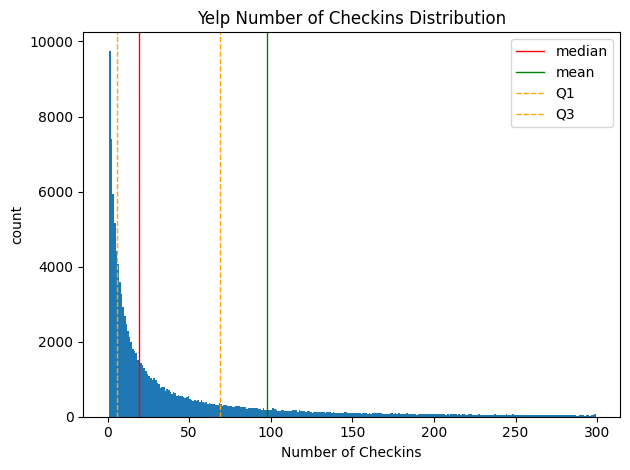

In [27]:
plot_help.plot_hist(event_df_count, end=300, step=1,
                    xlabel='Number of Checkins', feature='Number of Checkins',
                    saveloc='../plots/checkin_count.png')

In [28]:
#get count of businesses with more than 1000 checkins
len(event_df_count[event_df_count.values>1000])

1900

We have business that are outliers and have so many checkins that they skew the data. We can make use of [Tukey's Method](https://www.stat.cmu.edu/~cshalizi/statcomp/13/labs/05/lab-05.pdf) to remove outliers. The convenince of the method is that it makes no assumptions about the distribution of the data

In [29]:
#calculate interquartile range
iqr = event_df_count.describe()['75%'] - event_df_count.describe()['25%']
iqr_min = event_df_count.describe()['25%'] - 1.5*iqr
iqr_max = event_df_count.describe()['75%'] + 1.5*iqr

print("IQR = {}".format(iqr))
print("Upper bound = {}".format(iqr_max))
print("Lower bound = {}".format(iqr_min))

IQR = 63.0
Upper bound = 163.5
Lower bound = -88.5


In [30]:
event_df_count_tuk = event_df_count[event_df_count.between(iqr_min, iqr_max)]

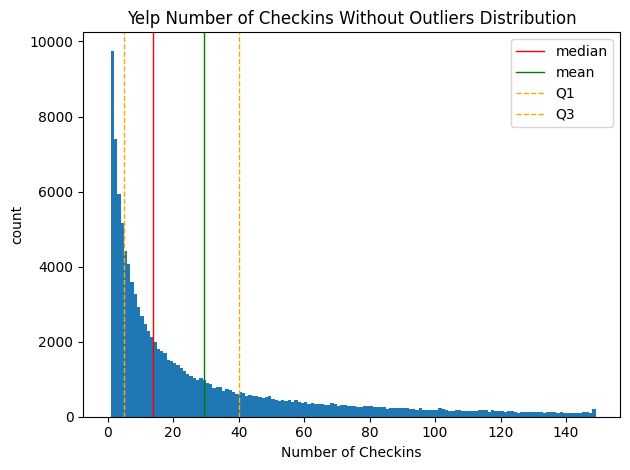

In [32]:
plot_help.plot_hist(event_df_count_tuk, end=150, step=1,
                    xlabel='Number of Checkins', feature='Number of Checkins Without Outliers',
                    saveloc='../plots/checkin_count_tukey.png')

## Date of Most Recent Checkin

In [33]:
#convert index to column
event_df_max = event_df.reset_index(level=0, inplace=False)

#take most recent date
event_df_max = event_df_max.groupby(event_df_max.business_id, as_index=False).max()


#check output
event_df_max.head()

business_id               index
0  ---kPU91CF4Lq2-WlRu9Lw 2021-11-11 16:23:50
1  --0iUa4sNDFiZFrAdIWhZQ 2014-04-12 23:04:47
2  --30_8IhuyMHbSOcNWd6DQ 2014-08-13 23:20:22
3  --7PUidqRWpRSpXebiyxTg 2015-09-27 13:18:32
4  --7jw19RH9JKXgFohspgQw 2021-06-21 19:59:50

In [35]:
#save the work
event_df_max.to_csv('../data/cleaned/event_df_max.csv')

## Events Over Time

In [36]:
checkin_year = event_df.groupby(pd.Grouper(freq='Y')).count()
checkin_year

C:\Users\Admin\AppData\Local\Temp\ipykernel_18216\885347920.py:1: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  checkin_year = event_df.groupby(pd.Grouper(freq='Y')).count()


business_id
2009-12-31            2
2010-12-31       207482
2011-12-31       880618
2012-12-31      1248032
2013-12-31      1490556
2014-12-31      1556961
2015-12-31      1632657
2016-12-31      1489414
2017-12-31      1299102
2018-12-31      1120004
2019-12-31      1005344
2020-12-31       466053
2021-12-31       470801
2022-12-31        20676

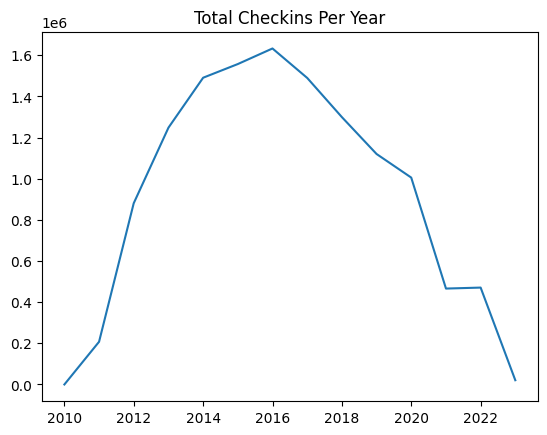

In [38]:
plt.plot(checkin_year.index, checkin_year.business_id)
plt.title("Total Checkins Per Year")
plt.savefig("../plots/checkin_by_year.png")

In [39]:
checkin_day = event_df.groupby(pd.Grouper(freq='1D')).count()
checkin_day.head()

business_id
2009-12-30            1
2009-12-31            1
2010-01-01            0
2010-01-02            0
2010-01-03            0

### Zoom in on year of 2014. Notice that peaks happen aroun the weekend

ValueError: keyword grid_b is not recognized; valid keywords are ['size', 'width', 'color', 'tickdir', 'pad', 'labelsize', 'labelcolor', 'labelfontfamily', 'zorder', 'gridOn', 'tick1On', 'tick2On', 'label1On', 'label2On', 'length', 'direction', 'left', 'bottom', 'right', 'top', 'labelleft', 'labelbottom', 'labelright', 'labeltop', 'labelrotation', 'grid_agg_filter', 'grid_alpha', 'grid_animated', 'grid_antialiased', 'grid_clip_box', 'grid_clip_on', 'grid_clip_path', 'grid_color', 'grid_dash_capstyle', 'grid_dash_joinstyle', 'grid_dashes', 'grid_data', 'grid_drawstyle', 'grid_figure', 'grid_fillstyle', 'grid_gapcolor', 'grid_gid', 'grid_in_layout', 'grid_label', 'grid_linestyle', 'grid_linewidth', 'grid_marker', 'grid_markeredgecolor', 'grid_markeredgewidth', 'grid_markerfacecolor', 'grid_markerfacecoloralt', 'grid_markersize', 'grid_markevery', 'grid_mouseover', 'grid_path_effects', 'grid_picker', 'grid_pickradius', 'grid_rasterized', 'grid_sketch_params', 'grid_snap', 'grid_solid_capstyle', 'grid_solid_joinstyle', 'grid_transform', 'grid_url', 'grid_visible', 'grid_xdata', 'grid_ydata', 'grid_zorder', 'grid_aa', 'grid_c', 'grid_ds', 'grid_ls', 'grid_lw', 'grid_mec', 'grid_mew', 'grid_mfc', 'grid_mfcalt', 'grid_ms']

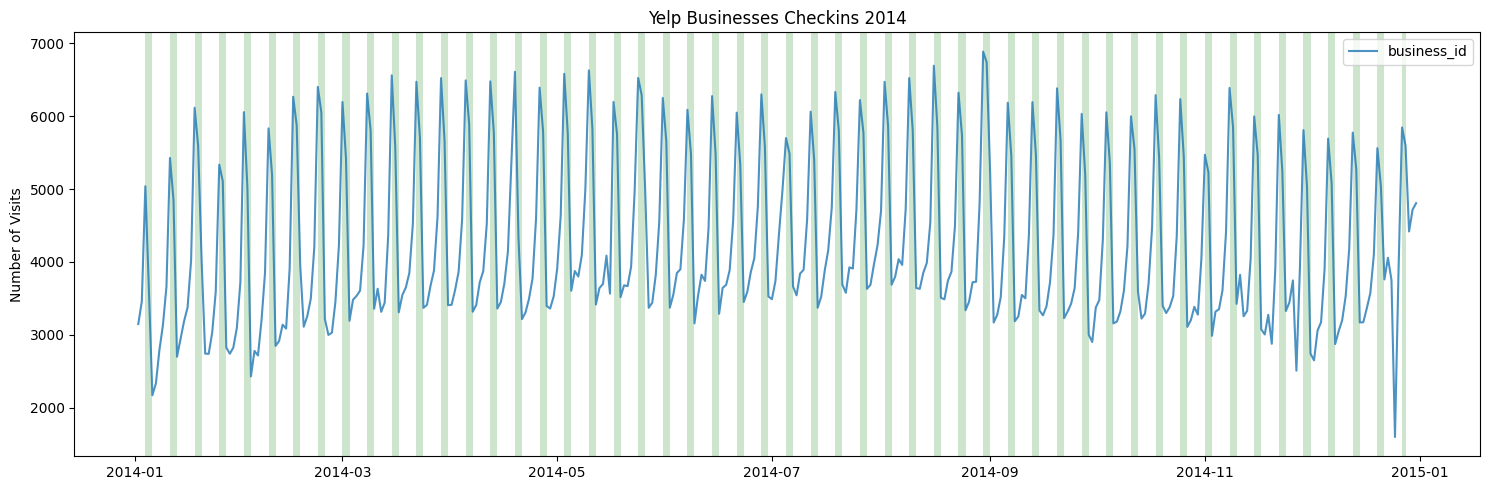

In [40]:
#get 2014-2015 date indeces
df_2014 = checkin_day[(checkin_day.index>'2014-01-01') & (checkin_day.index<'2015-01-01')]
#plot
plot_help.plot_datetime(df_2014, 
                        title='Yelp Businesses Checkins 2014', 
                        saveloc='../plots/checkin_2014.png')

### Zoom in on April 2014 as sample

In [41]:
df_2014_april = checkin_day[(checkin_day.index>'2014-04-01') & (checkin_day.index<'2014-05-01')]

ValueError: keyword grid_b is not recognized; valid keywords are ['size', 'width', 'color', 'tickdir', 'pad', 'labelsize', 'labelcolor', 'labelfontfamily', 'zorder', 'gridOn', 'tick1On', 'tick2On', 'label1On', 'label2On', 'length', 'direction', 'left', 'bottom', 'right', 'top', 'labelleft', 'labelbottom', 'labelright', 'labeltop', 'labelrotation', 'grid_agg_filter', 'grid_alpha', 'grid_animated', 'grid_antialiased', 'grid_clip_box', 'grid_clip_on', 'grid_clip_path', 'grid_color', 'grid_dash_capstyle', 'grid_dash_joinstyle', 'grid_dashes', 'grid_data', 'grid_drawstyle', 'grid_figure', 'grid_fillstyle', 'grid_gapcolor', 'grid_gid', 'grid_in_layout', 'grid_label', 'grid_linestyle', 'grid_linewidth', 'grid_marker', 'grid_markeredgecolor', 'grid_markeredgewidth', 'grid_markerfacecolor', 'grid_markerfacecoloralt', 'grid_markersize', 'grid_markevery', 'grid_mouseover', 'grid_path_effects', 'grid_picker', 'grid_pickradius', 'grid_rasterized', 'grid_sketch_params', 'grid_snap', 'grid_solid_capstyle', 'grid_solid_joinstyle', 'grid_transform', 'grid_url', 'grid_visible', 'grid_xdata', 'grid_ydata', 'grid_zorder', 'grid_aa', 'grid_c', 'grid_ds', 'grid_ls', 'grid_lw', 'grid_mec', 'grid_mew', 'grid_mfc', 'grid_mfcalt', 'grid_ms']

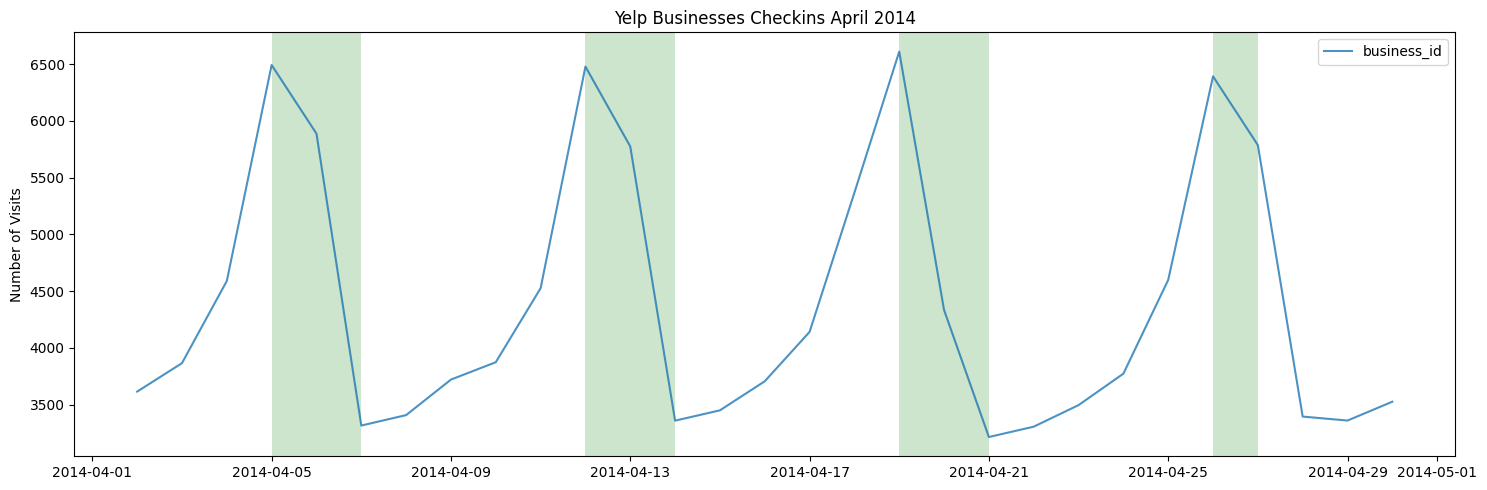

In [43]:
plot_help.plot_datetime(df_2014_april, 
                        title='Yelp Businesses Checkins April 2014', 
                        saveloc='../plots/checkin_2014_april.png')

### Compare to holiday month of December

ValueError: keyword grid_b is not recognized; valid keywords are ['size', 'width', 'color', 'tickdir', 'pad', 'labelsize', 'labelcolor', 'labelfontfamily', 'zorder', 'gridOn', 'tick1On', 'tick2On', 'label1On', 'label2On', 'length', 'direction', 'left', 'bottom', 'right', 'top', 'labelleft', 'labelbottom', 'labelright', 'labeltop', 'labelrotation', 'grid_agg_filter', 'grid_alpha', 'grid_animated', 'grid_antialiased', 'grid_clip_box', 'grid_clip_on', 'grid_clip_path', 'grid_color', 'grid_dash_capstyle', 'grid_dash_joinstyle', 'grid_dashes', 'grid_data', 'grid_drawstyle', 'grid_figure', 'grid_fillstyle', 'grid_gapcolor', 'grid_gid', 'grid_in_layout', 'grid_label', 'grid_linestyle', 'grid_linewidth', 'grid_marker', 'grid_markeredgecolor', 'grid_markeredgewidth', 'grid_markerfacecolor', 'grid_markerfacecoloralt', 'grid_markersize', 'grid_markevery', 'grid_mouseover', 'grid_path_effects', 'grid_picker', 'grid_pickradius', 'grid_rasterized', 'grid_sketch_params', 'grid_snap', 'grid_solid_capstyle', 'grid_solid_joinstyle', 'grid_transform', 'grid_url', 'grid_visible', 'grid_xdata', 'grid_ydata', 'grid_zorder', 'grid_aa', 'grid_c', 'grid_ds', 'grid_ls', 'grid_lw', 'grid_mec', 'grid_mew', 'grid_mfc', 'grid_mfcalt', 'grid_ms']

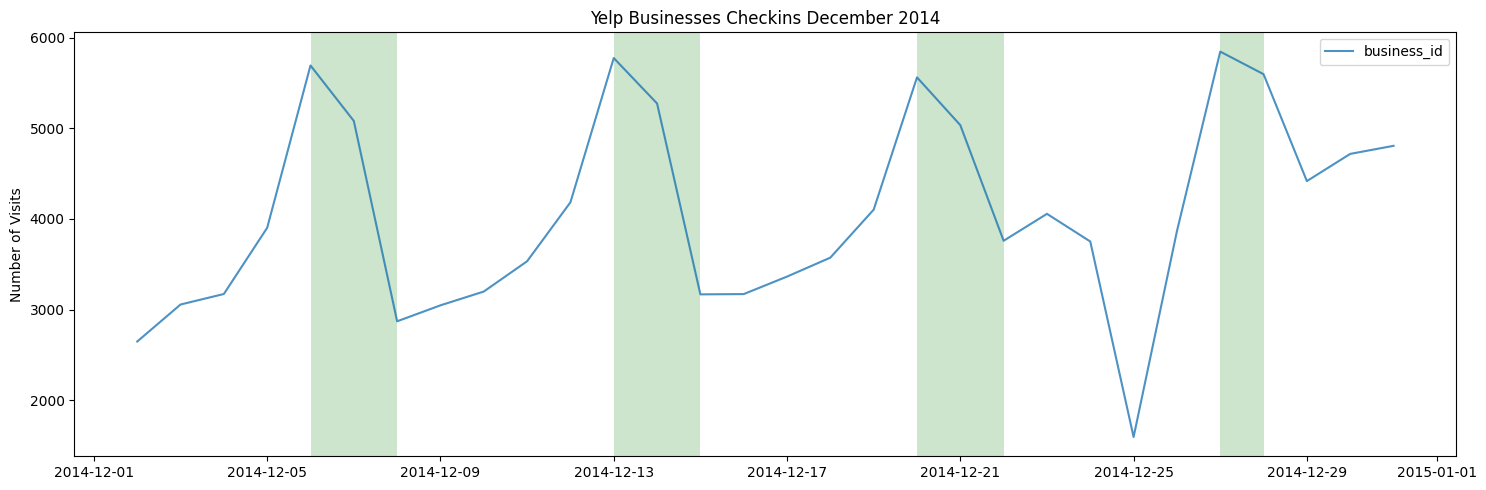

In [44]:
df_2014_december = checkin_day[(checkin_day.index>'2014-12-01') & (checkin_day.index<'2015-01-01')]

plot_help.plot_datetime(df_2014_december, 
                        title='Yelp Businesses Checkins December 2014', 
                        saveloc='../plots/checkin_2014_december.png')

### Increase granularity by picking random week of 2014 with 30min intevals

In [45]:
checkin_halfhour = event_df.groupby(pd.Grouper(freq='30min')).count()

In [46]:
checkin_halfhour.head()

business_id
2009-12-30 02:30:00            1
2009-12-30 03:00:00            0
2009-12-30 03:30:00            0
2009-12-30 04:00:00            0
2009-12-30 04:30:00            0

ValueError: keyword grid_b is not recognized; valid keywords are ['size', 'width', 'color', 'tickdir', 'pad', 'labelsize', 'labelcolor', 'labelfontfamily', 'zorder', 'gridOn', 'tick1On', 'tick2On', 'label1On', 'label2On', 'length', 'direction', 'left', 'bottom', 'right', 'top', 'labelleft', 'labelbottom', 'labelright', 'labeltop', 'labelrotation', 'grid_agg_filter', 'grid_alpha', 'grid_animated', 'grid_antialiased', 'grid_clip_box', 'grid_clip_on', 'grid_clip_path', 'grid_color', 'grid_dash_capstyle', 'grid_dash_joinstyle', 'grid_dashes', 'grid_data', 'grid_drawstyle', 'grid_figure', 'grid_fillstyle', 'grid_gapcolor', 'grid_gid', 'grid_in_layout', 'grid_label', 'grid_linestyle', 'grid_linewidth', 'grid_marker', 'grid_markeredgecolor', 'grid_markeredgewidth', 'grid_markerfacecolor', 'grid_markerfacecoloralt', 'grid_markersize', 'grid_markevery', 'grid_mouseover', 'grid_path_effects', 'grid_picker', 'grid_pickradius', 'grid_rasterized', 'grid_sketch_params', 'grid_snap', 'grid_solid_capstyle', 'grid_solid_joinstyle', 'grid_transform', 'grid_url', 'grid_visible', 'grid_xdata', 'grid_ydata', 'grid_zorder', 'grid_aa', 'grid_c', 'grid_ds', 'grid_ls', 'grid_lw', 'grid_mec', 'grid_mew', 'grid_mfc', 'grid_mfcalt', 'grid_ms']

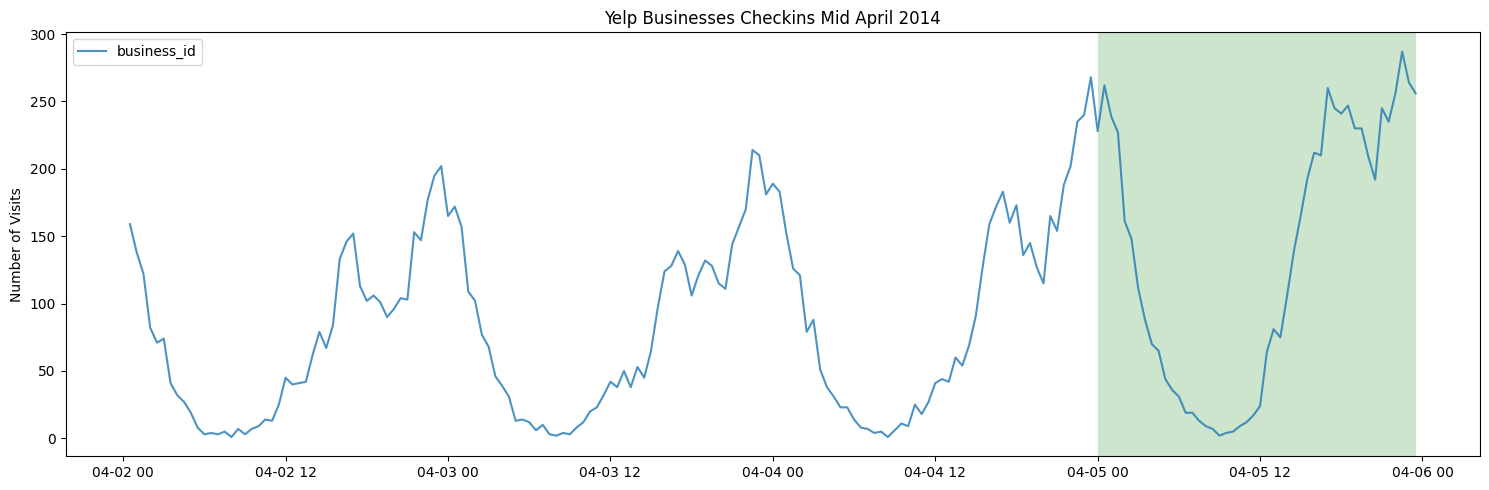

In [48]:
checkin_halfhour_midapril = checkin_halfhour[(checkin_halfhour.index>'2014-04-02 00:00:00')
                                             & (checkin_halfhour.index<'2014-04-06 00:00:00')]

plot_help.plot_datetime(checkin_halfhour_midapril,
                        title='Yelp Businesses Checkins Mid April 2014', 
                        saveloc='../plots/checkin_2014_april_30min.png')

### Repeat for other random time of July

ValueError: keyword grid_b is not recognized; valid keywords are ['size', 'width', 'color', 'tickdir', 'pad', 'labelsize', 'labelcolor', 'labelfontfamily', 'zorder', 'gridOn', 'tick1On', 'tick2On', 'label1On', 'label2On', 'length', 'direction', 'left', 'bottom', 'right', 'top', 'labelleft', 'labelbottom', 'labelright', 'labeltop', 'labelrotation', 'grid_agg_filter', 'grid_alpha', 'grid_animated', 'grid_antialiased', 'grid_clip_box', 'grid_clip_on', 'grid_clip_path', 'grid_color', 'grid_dash_capstyle', 'grid_dash_joinstyle', 'grid_dashes', 'grid_data', 'grid_drawstyle', 'grid_figure', 'grid_fillstyle', 'grid_gapcolor', 'grid_gid', 'grid_in_layout', 'grid_label', 'grid_linestyle', 'grid_linewidth', 'grid_marker', 'grid_markeredgecolor', 'grid_markeredgewidth', 'grid_markerfacecolor', 'grid_markerfacecoloralt', 'grid_markersize', 'grid_markevery', 'grid_mouseover', 'grid_path_effects', 'grid_picker', 'grid_pickradius', 'grid_rasterized', 'grid_sketch_params', 'grid_snap', 'grid_solid_capstyle', 'grid_solid_joinstyle', 'grid_transform', 'grid_url', 'grid_visible', 'grid_xdata', 'grid_ydata', 'grid_zorder', 'grid_aa', 'grid_c', 'grid_ds', 'grid_ls', 'grid_lw', 'grid_mec', 'grid_mew', 'grid_mfc', 'grid_mfcalt', 'grid_ms']

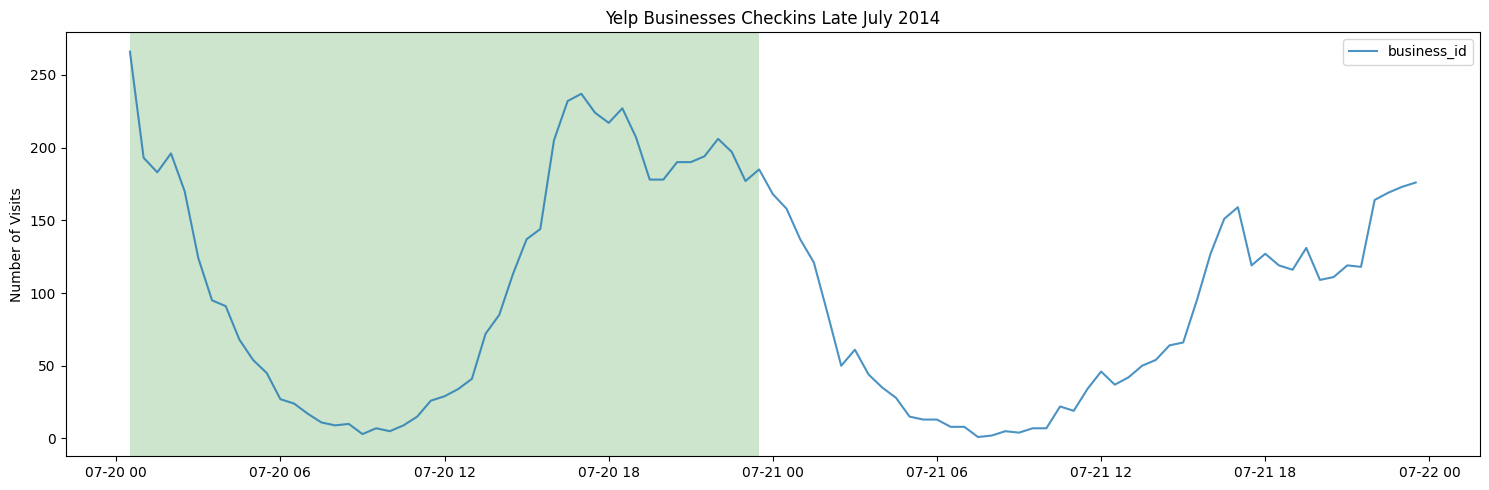

In [49]:
checkin_halfhour_midjuly = checkin_halfhour[(checkin_halfhour.index>'2014-07-20 00:00:00')
                                             & (checkin_halfhour.index<'2014-07-22 00:00:00')]

plot_help.plot_datetime(checkin_halfhour_midjuly, 
                        title='Yelp Businesses Checkins Late July 2014', 
                        saveloc='../plots/checkin_halfhour_midjuly_30min.png')

## As a general obseration, most checkins tend to peak around the weekend which is defined as Saturday-Sunday. From a more granular perspective on daily basis, checkins tend to peak around 6:00PM which might be due to dinner time.

## To gain a better understanding we can group chekins by day

In [51]:
# Thêm cột chỉ chứa thời gian (giờ:phút:giây)
checkin_halfhour['Time'] = checkin_halfhour.index.time

# Thêm cột tên thứ trong tuần (Monday, Tuesday,...)
checkin_halfhour['DayOfWeek'] = checkin_halfhour.index.day_name()

# Xem kết quả
checkin_halfhour.head()


business_id      Time  DayOfWeek
2009-12-30 02:30:00            1  02:30:00  Wednesday
2009-12-30 03:00:00            0  03:00:00  Wednesday
2009-12-30 03:30:00            0  03:30:00  Wednesday
2009-12-30 04:00:00            0  04:00:00  Wednesday
2009-12-30 04:30:00            0  04:30:00  Wednesday

In [52]:
#group by day of week and aggregate by sum+mean+stf
day_avg=checkin_halfhour.groupby(['DayOfWeek','Time']).agg([np.sum, np.mean, np.std])

#drop level in colums
day_avg.columns = day_avg.columns.droplevel()

#extract upper and lower bound as mean +/- 2STD
day_avg['upper'] = day_avg['mean'] + 2*day_avg['std']
day_avg['lower'] = day_avg['mean'] - 2*day_avg['std']

#extract day of week name
day_avg['day']=day_avg.reset_index()['DayOfWeek'].tolist()

day_avg.head()

C:\Users\Admin\AppData\Local\Temp\ipykernel_18216\4242245424.py:2: FutureWarning: The provided callable <function sum at 0x00000285E7C20B80> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  day_avg=checkin_halfhour.groupby(['DayOfWeek','Time']).agg([np.sum, np.mean, np.std])
C:\Users\Admin\AppData\Local\Temp\ipykernel_18216\4242245424.py:2: FutureWarning: The provided callable <function mean at 0x00000285E7C21D80> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  day_avg=checkin_halfhour.groupby(['DayOfWeek','Time']).agg([np.sum, np.mean, np.std])
C:\Users\Admin\AppData\Local\Temp\ipykernel_18216\4242245424.py:2: FutureWarning: The provided callable <function std at 0x00000285E7C21EA0> is currently using SeriesGroupBy.std. In a future version 

sum        mean        std       upper     lower     day
DayOfWeek Time                                                                
Friday    00:00:00  79488  126.372019  61.208854  248.789727  3.954311  Friday
          00:30:00  74104  117.812401  57.830907  233.474214  2.150587  Friday
          01:00:00  66566  105.828299  53.010356  211.849011 -0.192413  Friday
          01:30:00  57579   91.540541  46.322193  184.184927 -1.103846  Friday
          02:00:00  47738   75.895072  39.498147  154.891366 -3.101223  Friday

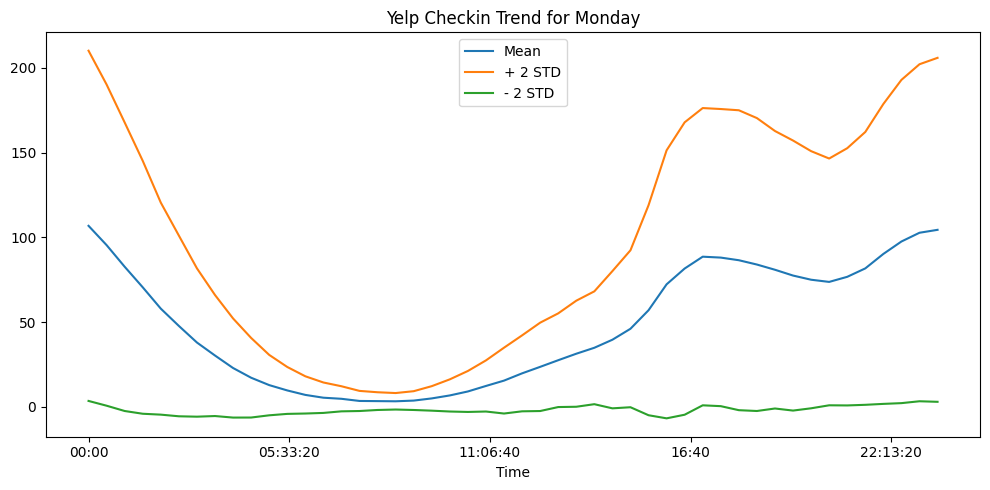

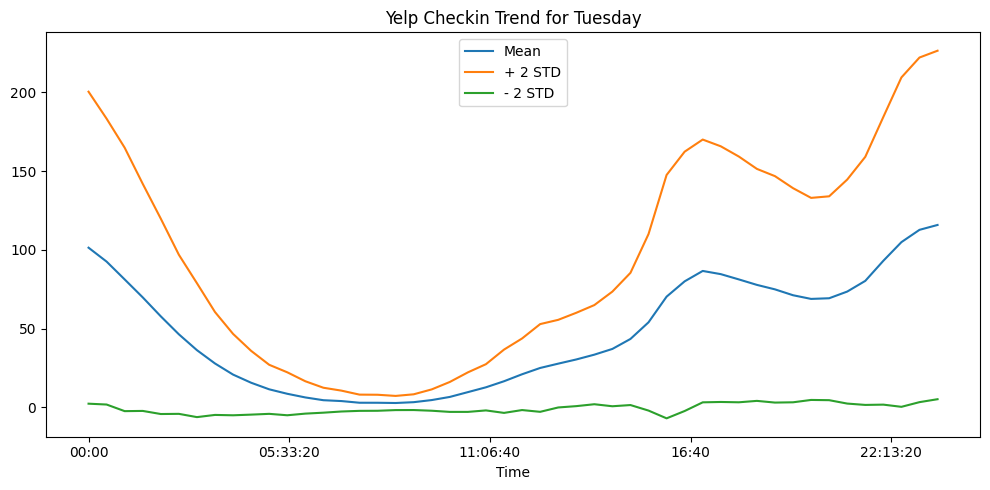

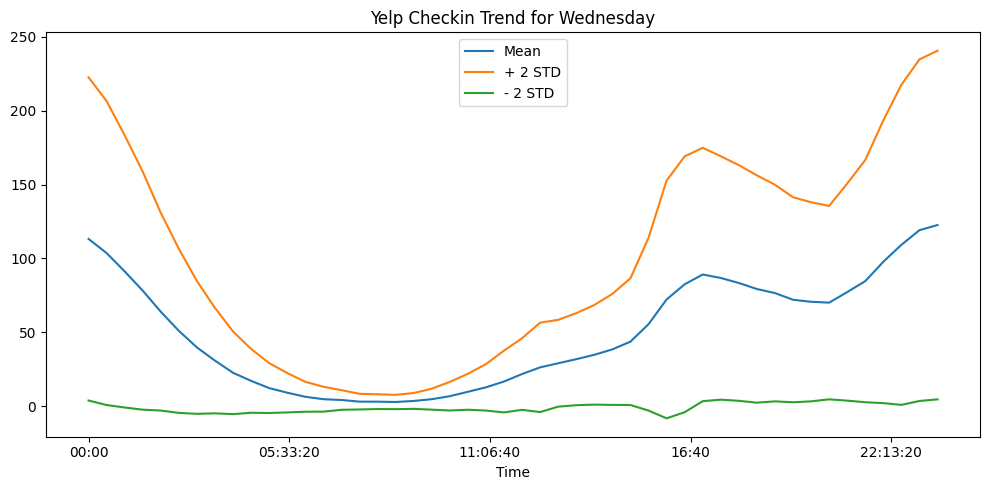

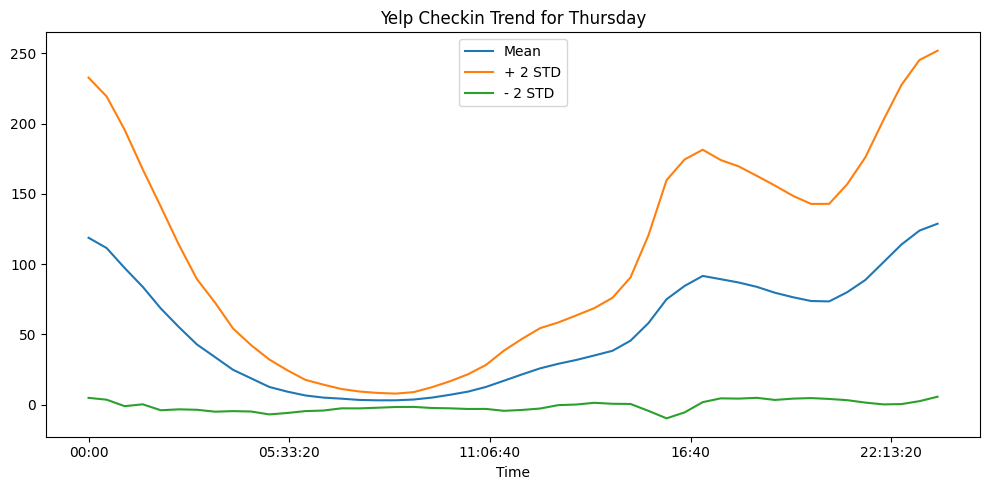

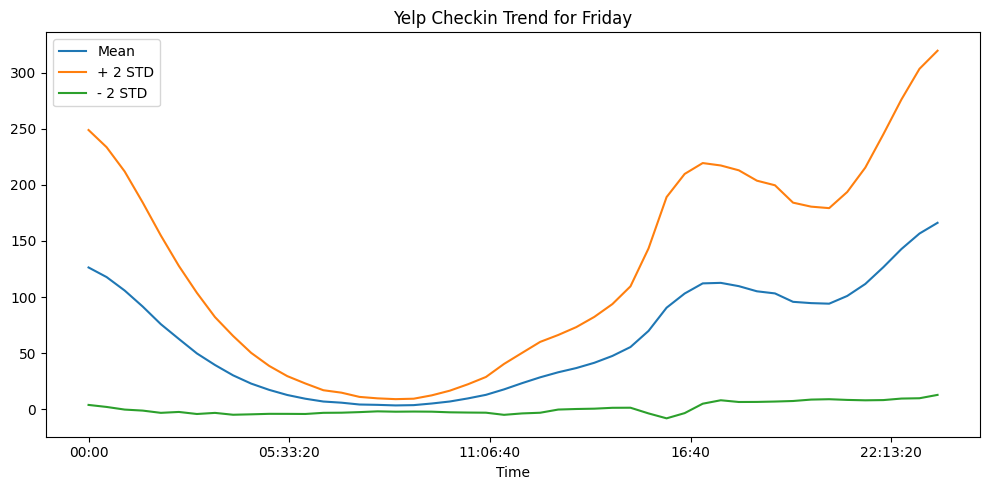

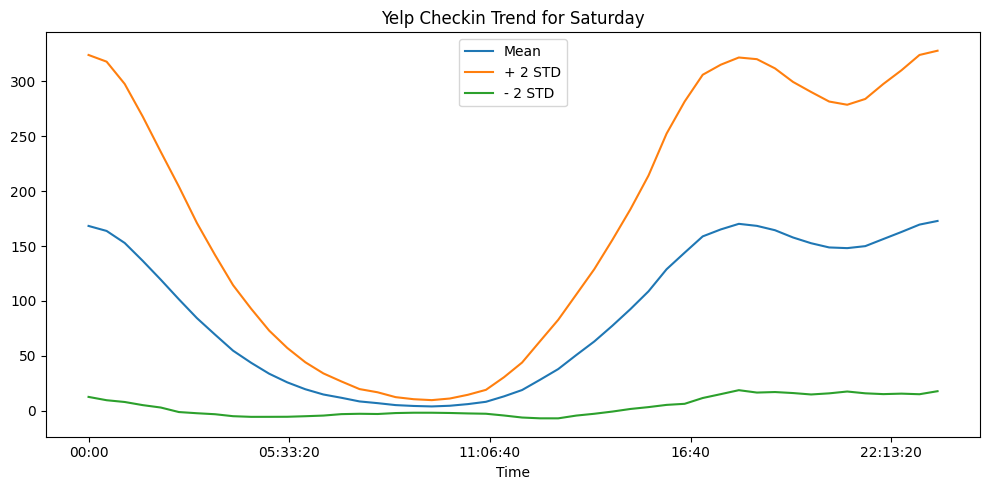

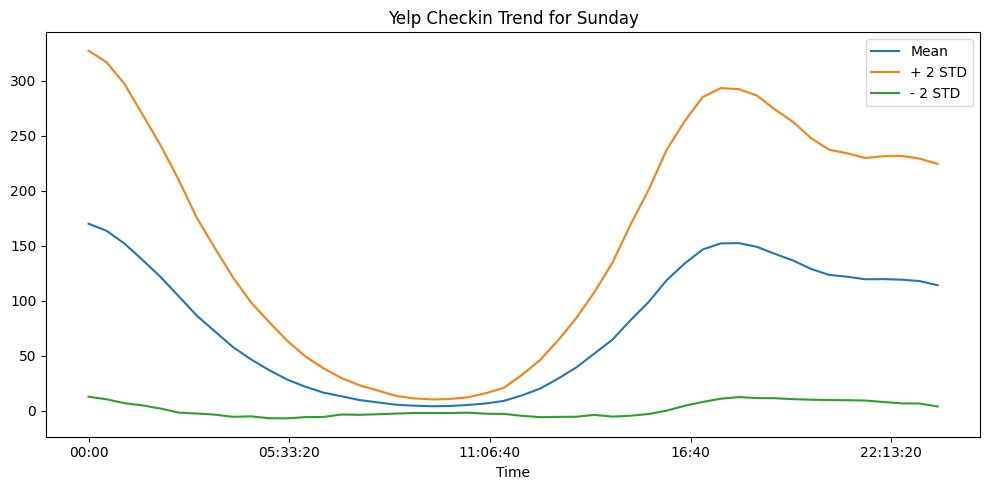

In [53]:
#days of week
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

for day in days:
    
    ax=day_avg[day_avg['day']==day].unstack(level=0)['mean'].plot(figsize=(10,5))
    day_avg[day_avg['day']==day].unstack(level=0)['upper'].plot(ax=ax)
    day_avg[day_avg['day']==day].unstack(level=0)['lower'].plot(ax=ax)
    ax.set_title('Yelp Checkin Trend for {}'.format(day))
    ax.legend(['Mean','+ 2 STD','- 2 STD'])
    plt.tight_layout()
    plt.savefig('../plots/checkin_trend_'+day+'.png')

## Repeat exercise above but with more granular approach: Separate by business category

In [54]:
cat_type_df = utils.chunk_loader('../data/cleaned/business_cats.csv', read_limit=-1)
cat_type_df.head(10)

Restaurants  Food  Shopping  Home  Bars  Spas  Beauty  American  Medical  \
0          0.0   0.0       0.0   0.0   0.0   0.0     0.0       0.0      1.0   
1          0.0   0.0       0.0   0.0   0.0   0.0     0.0       0.0      0.0   
2          0.0   0.0       1.0   1.0   0.0   0.0     0.0       0.0      0.0   
3          1.0   1.0       0.0   0.0   0.0   0.0     0.0       0.0      0.0   
4          0.0   1.0       0.0   0.0   0.0   0.0     0.0       0.0      0.0   
5          1.0   1.0       0.0   0.0   0.0   0.0     0.0       0.0      0.0   
6          0.0   0.0       1.0   0.0   0.0   0.0     0.0       0.0      0.0   
7          0.0   0.0       0.0   0.0   0.0   0.0     0.0       0.0      0.0   
8          1.0   0.0       0.0   0.0   1.0   0.0     0.0       1.0      0.0   
9          1.0   1.0       0.0   0.0   0.0   0.0     0.0       0.0      0.0   

   Event             business_id  
0    0.0  Pns2l4eNsfO8kk83dixA6A  
1    0.0  mpf3x-BjTdTEA3yCZrAYPw  
2    0.0  tUFrWirKiKi_TAnsVWINQQ  
3    0.0  MTSW4McQd7CbVtyjqoe9mw  
4    0.0  mWMc6_wTdE0EUBKIGXDVfA  
5    0.0  CF33F8-E6oudUQ46HnavjQ  
6    0.0  n_0UpQx1hsNbnPUSlodU8w  
7    0.0  qkRM_2X51Yqxk3btlwAQIg  
8    0.0  k0hlBqXX-Bt0vf1op7Jr1w  
9    0.0  bBDDEgkFA1Otx9Lfe7BZUQ

Divide the dataframes in 3 categories:
- Service = Restaurants + Food + Bars
- Personal = Beauty + Medical + Health + Hair + Spas
- Mall = Shopping + Home				

In [56]:
def safe_sum(df, cols):
    existing = [col for col in cols if col in df.columns]
    if existing:
        return df[existing].sum(axis=1).apply(lambda x: min(1, x))
    else:
        return pd.Series(0, index=df.index)

cat_df_reduce = cat_type_df.copy()

cat_df_reduce['service'] = safe_sum(cat_df_reduce, ['Restaurants', 'Food', 'Bars'])
cat_df_reduce['personal'] = safe_sum(cat_df_reduce, ['Beauty', 'Medical', 'Spas', 'Hair'])
cat_df_reduce['mall'] = safe_sum(cat_df_reduce, ['Shopping', 'Home'])

cat_df_reduce = cat_df_reduce[['business_id', 'service', 'personal', 'mall']]
cat_df_reduce.head()


business_id  service  personal  mall
0  Pns2l4eNsfO8kk83dixA6A      0.0       1.0   0.0
1  mpf3x-BjTdTEA3yCZrAYPw      0.0       0.0   0.0
2  tUFrWirKiKi_TAnsVWINQQ      0.0       0.0   1.0
3  MTSW4McQd7CbVtyjqoe9mw      1.0       0.0   0.0
4  mWMc6_wTdE0EUBKIGXDVfA      1.0       0.0   0.0

In [57]:
#recall proportions
cat_df_reduce.mean()

TypeError: Could not convert ['Pns2l4eNsfO8kk83dixA6Ampf3x-BjTdTEA3yCZrAYPwtUFrWirKiKi_TAnsVWINQQMTSW4McQd7CbVtyjqoe9mwmWMc6_wTdE0EUBKIGXDVfACF33F8-E6oudUQ46HnavjQn_0UpQx1hsNbnPUSlodU8wqkRM_2X51Yqxk3btlwAQIgk0hlBqXX-Bt0vf1op7Jr1wbBDDEgkFA1Otx9Lfe7BZUQUJsufbvfyfONHeWdvAHKjAeEOYSgkmpB90uNA7lDOMRAil_Ro8jwPlHresjw9EGmBgjaxMSoInw8Poo3XeMJt8lQ0bPLkL0QhhPO5kt1_EXmNQMUTTqe8uqyMdBl186RmNeArBmpy_Y1UbBx8ggHlyb7hAM0XSSHqrASOnhgbWDJIpQA8wGISYjYkE2tSqn3cDMu8AROeacJQwBeh05Rqg7F6TCgWKMJwqnfZKsAae75RMP6jAqhDdDeI3K4jy2KyzwFN53wkfNv-JZpuN6TVNSO6hHdkw9OG5YkX1g2GReZM0AskizA4iRzR7OaS-QaSXuvYxEGKAPSo_C1Sfa13JHjzVNW6ziQnoByYNtDLQAra9ccqxdfDwtMkwHmWFUEXrC9ZduonpTgQdN72BWoyFypdGJhhI5r7gsqSqqLy0sN8n2IZrAbzidQfvWn8oXXwbj2l79cochZywMjboz24M9NlBeiOJKLEd_Q8sshLb4UU7emeUDvtJWnpAkV_Q1oqis8Qli8dUoGpTyQw_AMNoI1iG9eay7ncmc67waPNXGTDkf-4bjhyMBQxqpQ2xVsWBNFwZOxIOdd9MwnwwmGFsPRHdE6SMV1gYQ6GzgQLcAozWCMLGjwRbokaJAKMgfSCNwMtNNQY9QT69Cj9fiAx1mhq4IpWctQOBM06dU8vgljxNT9p0y7YMPx0fcNBGiglwItZ1Ck3KtpCgG4CPFmpQKq51_lGAgAigqmENITTr-AmglME3E7esPSpIF5bias8wwghnIlMb_i5U46HMBGx9igJX4tUpd09YFchLBuI43lGwlk9IwjZXqUMqqOhM774DtQbCBPXIVfVzBZBEpFu29dcgABxoFuzZy5mqQ8C5FJJajQHwt3_mOEmU-t--ywcemnMgREwfwz-_-CMQ7Np5UVi9Qg5BmQX4UVJY19mMtafMg7JAcVBxfMC4lp3DnocjYA3FHQ0qNpTGTcqPwOLi2hADx4XwxM6LoUcnpDpMBzXs_7dXAgtxyXRytGjwOXvS8s4sc-WADQ7PyYlp2bX96WZa7TcaWQuI9XODGY_2_ieTE6xJ0mywJgpnXv_0XhV3SfbfB50nxwSi6LXSR9gvAbmgO5DzV2cwseKihQKpGGnCeLuELRQPSQL_TT0BFmFwORAMaA83K54AmjWvAkNqoA6Y5P03sDSzfAqfWJmJ0g96eM_fWma3ja0guczmbBk5O3tYhGue13dCDgn7AQvGvNHlmun3kqXeBKVQeYxGFkxo6m3SYGVTh5m2nQlOP3HxdUTaq0eXhwR_KC-wKWA2qtdwVEkMpd5soSKaGAgbN4RuUiiBxQ2GBFQ2p3CwB2qqjCl_BNNnXvWWfpFiLA7PDi_iyik3jraDAzWwwR4Q8rb-3VYXE37IZix4yOdskw9Rww8yE6Dm4dSMEq09nwXgaCDY7vXYMs54EbYuQScsnQ-4dYswJy7SPcbcERvitmIgmFTaYsRDyeFaY2NDLfSaAAx9K0RfZaT_zlw6DklBDzjwpJfh3Ct8iL58NZa8ta-a5wcvP_vh_bOLbCY3eoY1Xw-A7clCBgNbd-x2Wj96lZ6MjwppFCk9aQkM338Rgwpl2F5ANZ_bFJma7brQUfln5h1UAgeMjnw_7wp-CscyNh6Lu0ZAIDtLPgUrqorrpqSLdfMhZQsE6jSnvMts_MAn-b4OkMAwYNjyv0gfOr2g8lbmUpTnKgLhpPSrulqVeTyJeK2xydvQoaboaRBUgGjbo2kfUIKDLQ-ZXYcCyDjj1QimnJyGtYtgnUqrF-h9S7myCcvNDecOvwvR9_bhoszcpXbB_APv6XlwRK6-cJ9hj53RzOlCBmpT-gZM46RDLXaFNo_z6t-j_L4wpEm4xNCk8d0TF6A1gi-WDQJ_ksUDPpzPwfTGtI4zTRnQknQ4vIgx-r85kjlWVVjcpQU2Tzy6J9aAAg9pzXsgdkvg1MeIwdbTnZOBFCKOrgaxuw8KMIT0NXu30Jz5Ojo5uxawjiLGdnf42eYftkqfU2ze1wEuRGgOwJ0g1vTj2R04j37QTLZ3-eDPLhUzfsWO4ad6UgDy91wdWkwtI_qgjAIZ0Niw2Bi3ef7c0CrLxHD_-yy_twvje0KIiE7vtpx7JzmBx5LQ2n9HHBxG7yAyAUwXXa49awkK2i5Xyd9SOpF5pCFilbcgI6DCYks9lqZeoZiVzW7PmAVrGxoSNZfSiT-G4OqRRGIwH0NEOp4e3Zu598u6kO3y0gsB45WFgysT617bKWP_WJwAFk1xpM7fjqEJ4paqk5ZFSg4dVrWc4Nhuw9apfk9BWEcAxfmkEGiIERBaBMLhw-dTCgNTf_U8kYu9PAE2cZGJqtJgkk_oEw1j3xQ-cJaAII8A0QRXpADfOCZBGi82-CGxYdswqFX8IdomeBVhDPCSyz2aRgbYjnX_J1bHZob10DoSFkqQluGY5CJlb4CJ3LrBcSXMPAVZzivJEbmHItOxNXJB3SpAiPSPcprSnkLOuL1Ns8UZZAQ3kQYhkYxSRyYyeBgtk--AwEfK2HIYNzkA1QYfUjHBawanLQj9AM8vjbcLSIE0iUggBVo_36t3z7vfXp3XGgJkOgP8brGDYVWjeW9GrKixH0yQCdytv_YhJO0W0Ab8t2xLtg3BJxm-HnvzdwD1zjmSbmyQFRYkg_JvsWU9xIXZsEZcVA9C2rpb56aQvW0ViZHK9sPwk0yyD71s2F2eEKWRdkZ6jAdM5OKNzk9AL2aiq-fV-SYgqdYfHRsZdcz4Bun4f9IjawY6t4pnKm5LF8y5ChHA27owE_kLUlU60fzoZYAOxbH_3wtxiXR1YfMyk-5S4ZzOVIhQ0vCsslN-TYnDeOSNT4rIfgzFvqulgAYOpSG2t1v8AZ-wSZU9c8V2GuREDN5KgyHFJwGWGXTKR0Fhdvzf_isDqJug-aeZuatjCDMV1X4gCTz9UgPYW8Buz8S8LpjIe6mZTAcwLx8ZYUJ_-3Aa8N821mN1WQM_THnNDHs29aylcK-JqS1AuCQqtYW_xc1EJRm7NyakdA9LLxOjEhLNcdx8i4lL6EUQh-y5azB-VlQAT3m7Ff2g2QXHTgtBSwLnwRHzKSbea2FgWYYdQDjx-DsCanlP0DpImQU2htB9qk4hOXCdkccvvW0QaNtKyc2rr-uK5cqzY9TVQQyv6kSKxDdZTsvHL25K-U2ghUQ9Z7kQeabvhPOAQOVV1At5tBd4p7BA7hNDitBUXxrwoCFcoyGx2VRZ8MHXEsV8tQFC6ef4rMMZKNov_-A9M6iQX_E7U2lVNEwbH_gpOBmAHQEYA514FX4H8MwvFjv2ORQAG4lRmwDHdvhZAhmtlsYYBwDTUfAthScapCGnOnnLUhPADcUDIlxFsvqPvFh8_lb4Swzs4d4DqSp5zh3HGFh-PiiQBxhkoR6cscJwwex8gx31OA2oxrOO3c9_mQmqM9kwEm9QMs5xG8i4p80KSMcF3tt4ugyswijv6wP2fKbMqAiEZ0vwm9ncuZp0nEVhIwu24G-HRwQZU7TcrztBb3tXaPbVCkXgl6VYP8AxIoW6U52aDo8fXgwMAxTyExktVtfyqKAfApbAE-nhxuu3zbt02oCj_1AFngvvE3HVfxlx9UYctKPr0dbwJnbSkfsl_j2dUoHncBTonA5BYQP7i7ckUlgSzX4YhnmwxAAhPuZ8FG6OlvAw5m1BVQDfGNZQsCe9k2BxazCf0p6g07JLsUInZr5OSiYH2XVi4ghPAmGKnDqummngSTOJN_8gORL4JE6tz3rJxVqkdKfegA1GnJDrpp-jyDRCptavD9RQjkY8aotwcAlSHCgoZrF49wYD_eZ4TaFrHYRrJVzOXHfwP10BsKUeoeCeVoK4BS2u0w7Du9oW73YcYFmXdtU5aiSgh_qlv6CIXGVurFOhFQ945wQjV4v7q_pt7tt3K1US7IHgLGqiubTmpJ-A1L5n7dmc6gFTFtoylMzkrzqNVSl-bkKw59jkCUm4yHciKL1KW_1HJAAzwiKZjVqHOxLaYtPAx8lAyM8LlTInbQH4FwWC97lz6wtVdJ7CgBGAQ_nLomYXbB-Qx8KYhsxbufQiYIK-4MRzHQ3S9GYtMOYhbZl4MMPOHT0QznL4YrNbA2uwOQ3CchkmEACtMEJxpVMlNzFpB4PtFjfAO1oZpbZNDMH_gz8DhsZCdAvPcfJ3rm3NpdqVDod2WxLAHI4_NqeHMJOnMoVFNxaFyApmuuoDqNZp7518AUd-YmPAEDNYAyVc_WFhM3CD6QVD4AtyJwgMRwo21wLUsga_RkQw2dlQX5sP9X6Dlm1MmNOlSwIYlUaKC9nICjiWdk-ShPlg8oi1Gm7XLyK31Y3N3Wp2IghdRtVNk-G9Ep4eaHPKXmfAtSFXJ0GFl5iUdy021YgWLwUoKkgWmE9-c3wbWwO4VAVQNh1rc9aSeO-Y5lYmXVS6CAr_8FZXRkGoc5QNbTOAIftAZU6NodDOWaabGkeNpOWdXwLVYAXWQB3t7tdwWteyjfhwmq5Z9X7yxgyApILQ11niNwX0V_PdBTS_SwNxMY2795ZAONUZertKOOImiyQG66Z7TgULReFPrCIDRbGKwP3ZsHwg25Uww0C0wvF9CZ_3B6vWtArCoWa-C7Os51GjFkCnFlVwDtuf4vD0znzwJW9vk3iTNw8c0r7olQSYGcws0bTd3ikwQU-X2Pijwd4SitfYXoZWMQUcl9Vo5lwrUmYbV8Dv8X5gcSeA6pC9JUlGfz-RNfvnGwWdrpkH-q7FQY5nclmPfoDQxF9r1XbMvEOsJeHlmFhIvw6BF3eaIzHtoNHSxKTFnTygwjyUxHxkrvUvCOVqy4g_wgdo6EpBc7ZUoaqdzuUuGFXA4IcB3QyMEA85UTWFKh9O9A_mf0QKI1Jlk8zRinr-56FAh_3oLlQ_CFohwlzsrSZ6xQY6heWJJ9AmEL58fZwgi9YQbTve2mwLk5Zc01vRKqc2KQ7FHjj04Wy2aqXl22NA_C0gTF6QZYUR5atqBEFnHP5bOwWveinioyAZg3dtt0zHsyHAD9Xez9uOSM4DgSjSTywq7w6czqMScx8MRDirv7fxX7pwbi3SICnYEuFC7Cihyqz8NwxbRbvXSAVZBEwaUUn3mzbgqb5pyP6XOS8K2uuC4eQHmQCWE-NfyMgi28ePUiansSdQuDQgmudYDKiB6n4vwbEeDgMyE_zdul_JO-dOHOug4GQQv5kwdvmg-J8g-ll0nkc3Sw8p9euqoMCbT4AIL_Fgqb0gbqmX882_6AxVA_uHEQ70sQmy0bmPD5dgDFE1ia__LNlw8ThWgxiTB83nrIGbZQnNBgTzrA1TsKMKbrZBkw3q6DEQEdg22x3CZkIv0GUib2oEFAVVvUBlc_WIEb8obKGq39dAFR5xx5YEzxAnoMdqGl7vRQpy5aKmlTB2NarfsfcOpHOQjL_NufxqXi-BpW5uXKsPwQwZhGuW7vQpfhxeEvLHkTrAvjLSYNGFkPu4Y5HKoJlzYgpIUQz-zGw-Nu_Pu-qoTGuwI3ZLcrGzj-QN5vFgaJFrAgTm3QiAVLJAR2fEJK7APPPQrJXa375PYt906DwptOOP3QYR0nwxBOKk6DiLHNItfsBQX4loIesbBkiTZLFstHv8Kwn8ecak12IF_jhnPNs37AZAjnyHs1ZXy9qIE2gORZBQMgxloFoRiYlH4IKGz3FhTDpAs_lHc_CrkzOTY3k4VNtN8wzzUxvYE-8Fj_dWqsPcagNgjcL_qaGJiappzpnn-ifSoArYOrSXy2I4BcxB7dhg29uAs-A1_pxGRYL2x4gONVzvFA_T0cPZE2ZJOTTlYYKMP64QdJfkfBbJz7wi0RgW-ph_EgVbItL6RDULtnw4YvB6EhVgOIsLivxtTTqH7i1QISoUOQW57cR9a7XP6RX56MSWHJJA35dqrE4z9qWCtCn749oorggYMOrd8xnZF-B61lwGiFUw6bFx8j2KqPfmT0XEUS1RMgx7_p5O3ChQa7shdHCcLHZQG2Byuh4EVeSnqqWBWtD7rgJF7iyI3wA_AKi_iXOKi0QwvSE6lkp5FBcttPxEbQ9XCwiolaqx0v6g-fymksGWIU9AG89OuZ3sIEfOR5cXeDqNaAusv5G5cO314pPHRTGq2EywgRHd5bRosRWQBckzPawf-wxa6JYHDgVza7CuenKBJBHw1dSKEitDDgIkaApe6UNMSArZw9O5lJ36m_mXeRKE4G9AdCITjr2RMTmrX33_eFaMKACLEWowfkj-wKYJlQDqT1awYG0OOMLP3MWYPKHpkA_mewPr_Mlt9FqdcW7WCFGJmozA-7GDqSUaXrpC8Ql7nDBxWA6I_DA3uqOox50rBvjrQ_-gzn-WXkqHag5FSVc_LC9dEQIYJOfQ6eFVHKCfJck59YIwe8pMCk4bE0U4qk7z59Lxkgqps-oF95uqPoV7fiXn-dpgQ2sKrIaEZsFN7VNjkibyfQIAj1Lw3FAOY-yZn4IO7ElQen_F2VgZPW1RCnWkPyCrhgcEqDvn5VuX8nQ_vqs6_xogaNLr1j_3CZ46rqiUeLaQ-AtuyCmcmm5Q-bc-9zV76xKA96qKAK06EdkG6GPVxKDdTwyZP6Z8sbDpkeXyjNMDiyDgkR4tXc1fLeR2QNu8cMZrEgV-96iACFgPmVjjKACGxd7Qp184f-Zvf4ToPwLba0VS4AWcSpc5mcfa7NUZ9GQgx0TgzVlhs7BVaouutt-rles-YA1E9o1SNo7UTf1XHTFPv1_Q0CEUpFtaKhxbmrbSdP9MUQCPor0p2hvvHJJN4L0U_zEgf82dhKNiUXsDVPMLqKYiIQFF45pKN_lzqG8Bqk-_HQvwGrzCVNDTRODqNez4zb4RLwDeN5N6B78gysROm_Sq2kWAscychO44eMoosS9iEBV7xwIOZrqUQ2Jg6UeQ5CWpsmkgTEP-73fGvgSUmtQFaOTA_g28FfSlW07o8GTwOrbfNMHAIr5Ts-NC7DDTL3XLizhV3gnSyOBxBRMugT3sKeT4YWBgI0gSLthWBsiUPzBft_CZ9QNBgbL_KQTRRLQPQQtmUkYQdhz3m3xUFy6-BrU9xTfkowbDAlJYMIzwOewIThe2IZjQb7YJrFZWZdI2C5-9nZvVdw6WBHCXHfLAG26n0ALAkoPAxvFV3ENVa_9POy_grBs03Q2FR-xWttfR8qaODqcuExvwSGigkw0zqh4TTXferq3XGAx9xBKymj6CJ2WuCCFInb7gSRexiuEsx1d9-dZVUsssQAxJyp6RLqNRv3tSu6njPKxQbwL2TymVrYekkkKztKyiwA-VBhLd8DAz2VyDF3YBMH4g1P_mGUY1PyPq7_ZabrzpBwmHDBZmEH0Er3184YS83_LQXwoXi0M66RU6Gouq-DSDHw1vmx7_L210UBbOWLzrhepQZiJfb924ewMO9S2f-9W9PwOfW-VK04qr7b7bPm5QbyLgdP_1jbKl47-9Ty83RyeJDAQa1YQzo00sm9O0JUlwdCQw0DbIUh_Xuj6H5B_SF0RLCQbSJczuohHVko33UT82hnfA7hSJSIBUP1UQncD4xWPDqgcSigjSbOfHR_mHGTCmJTaQPCM-vL-vRLJ4HB2OE8Nnbgyooufdsf3eAVq_9RQNSDJA8YJtf5v76SIz-4udyF4YmArmHgqdVkLsGN2byesWRo0w6zBCuzJwov08YisHZkfU2QJfGfqCnk0-Tnf6PlahPUJQaNXw3PkXVt8ANwLyCfcmpggbetDRjllP5cOxaWxFjGHARI8tdJy90bfApk836eF-agvweEeZwiaRRWX2Cu9Iq66QGVqXNt0HKJLpciN9ePxnWwKUx_q3nzqUINYgUTrZc9OAj-PaHu9iyJBlzKJZYN2smAOt4bRWWO681vXZIgnLfjEAOURGUNuoVqPGxZTZsxZQ8wVeqkfRUzZAKlQer3npXPdQJwBTq6IOFH97b9Hr6RT7pwdChRGpit9fM_kZK5pafNyAuyc-S7lauYjzouYQ2TM76AgRw-rxLFeNzyqa6hKPXD1wFJDvhCGIwKuohPOK7JfLuA2_gRg3_oWK3GoiB-OpcDHA7qDAeIsMVj1McNktlICETwYE2TePip0TxcdquF5hGauQnIn0fMn-SEjLdJ44SG4CKw-Ijm5ICZUZffTo3iumczrwKdkMXzeoqpfNsZd-_axoTQ0Xsmy6HtVVBlCbbMjRyzcgiBRXLFWD7PeSYDbKsd_JTw3tX0CduxNIHgrxr6ToairwvFJIK-z3QWs-3XNjs1hcZQod6skmfXz9twktEAuJHEmwsUQ-OfJYSNfz-cimEjoaXQ5gLjr0BZzm6EY07bp7_LSAcDekcTE1qwpz8ROlYixhqg5lcumCB7X0nH5PElagz1VAj9Kaj_6tSeXmVMYCgZithgEIlFs8kybcG-l60GJjNUIASzHAnqwOuOmw0qh1d6ZAcQz9wCTHYI2VZy9YIblwSsggcl5NjtALgaX7E-WL2DtiYQcsJKpjAqZu42-pPhFLfPLwHsibLfc2XD7Gh7Hbd1WfJQ_7ks3u-qZsOTKBrXKcA1OwnnHHPz4SKmDGxod16WxDxQ8t6mbhBNAT027aeDQ4mR3A4xhGQGdGqU60BIznBjqnuAgVh26yEPkXSoWbhs1p2kNAjuVJO2kMrHwCYXwQQmv1TgpYC5fKcpj8GKjSAc7Sl3RQIFDNP-n9bBN1egOsGADYYgRad7bl6MFOEemh41CdREMQf55CXbSB-F8AZXNumZZlcARz0KfP7YAZV_yQE8uIB0fgQWqKTWQ2OiDgo3dzNkpungFAWhZ5nasogf2oG_9h7yjgHPpKVvBT-2EeWNdy9cIjqAJgORpZ2kB8DG2MECu7jvkQCsjKkpApaYJDd5woO9sP4wgTwgRz52imtyggXCrH2XngWt1W6qwCvna1KzIuJRJbwAKNfqu3kNwn6eDMJjP0cNcgTO5-F6Rgt-_sYvRT9Cta-wL2TIgbnlsqRtqDU3FuW7lwREuCtUZ2MeehpDipAKBSmQeJ77e9lGxY3ArzaoDbHhYw2M4pYfuivdluXyBOP7IDQwfNssGWMjae-SUzyyGblspQc16lBET8GKbGZY6Aegm_2QQU6xxKwHXR6xQ5oi2yIKLwVk3Up8OlB8h2ygVlvm8tBQTGr9-KKNk_o7HzqvtlKomQkwQzVF5GP8DzdyBavvhIaQ9X1_a2DQwBtXza-U1CfA1g0Up4mOWP588Leb_dqoDiYQwFXwmrlV8TiBS4Ac2-W_9gifjluUv4VASwmFqEp8cWlQbNJSy64VXxQ3RZ8tNpM-fA9RoAU2wAlH63Non9qrx3xQMlEhwiOJpKe7VuO-IDCZqgbPPy7yNFfb-6N_bHkn1qAwi_cFU5_dQexbjJA9rmf_WAtUl_Lq8dM3T-NnM-u3szSgbTC3m_GPWBp92Y5TTReyTAZ3EIfrkSmOmE4hnc1BRo5wwQjhFPMKwN_z85aPEn6V4Q516L9-ZWyqVgzqjP5uW7JgKDcHC6Es_jv4tloj0NP6gA7mpYTDb24SywNMRn3yeakQ_WRe3ql2DI_h3htr77SiewNpglDX_FUp3ybEzbBp4qhwiEC0VzHM2hQ13wM7c0QwgQ34YgAnnZAPOeu8E-6IESJQdK_qONtd5z73i6fQ1BTrTA_raU4FUxWzx30V6DCDSKiAOlD8UoHqrKnLoZUFxuas_wC43IEVBroD_3YiumPPLLdQxDEee0p41GueCDN0EAp-YAeq4xYdVExp3jLYAZ71uvPALFPJXiuM357JZ-d0vv6yxwNIV7uxsE8rn8cB1t-FsJHgqsCLpTsXayYMJ3-lJj_fyAD7z_V6E8cxXghSRcHAmUPgu4cktT_mzitYexUsr_vKswuW2oyOCEN3RgS7j2MfUIkggb7JjRJtzWDsIWpJihZhBQJPm93BlP-UHYPqFgK66JUwc9xE6CyePzE1gONFxpTJWwXj0SIY3dprQ4ZZ0lz8YmGw-DXNvQLhKwunHzg8OjkwXA9kCutyCm1b8UuCRJF3Hw5Aoy-n3wkXeK6NPPKf3uRDTQYZuoaOzD49ffP10PNf72nA0WIlsDUUFuUKcDfJPaHRkALdQUIP4_DPnJjq-Jf2_iNgVeFfrEZ4iWaecrQg6Eq4cg5LbiHS5xbeKUxd9ulIJz4w5iuo1kvv0XZMS0bUOoLz2QwwHswDU1t8T-8DAuKI3WdQDl1alpHSJE4_iB0MGKRLXwhsyIDX4x4ndYEvPoJF6_1gdk9zGFRJD2RXkHqAmFHOOAGMVVFox3a0ROMdofd68mZwfCRGXD-TTLgNhaC4mVFFJQrR30b1XWbxZFFgLyGbfNAwg736EKijhJTrQbqoQAo9Tw4QFqi8w3rlZTcc5LXKyPJwXTWGzxXdQN0DVVH2GPGwiAVKwPAl11iuM_YkEwm07sYQiONfxRWQqA8pAPMZFNLaug0HpYaBbRqaG1df4JckJoUwCyy0zZz5ixYjSX4o4sacpgp79UR4tdHoJzmhwKmiXa2AqTjsoi0FCv93wxzl0puQSQjfz_-ngCCAbKUziluLAgiwQ9nC1l2V5wDyJpVb50OyLgwRBEBZ6TvMTuwosvBa72xQhE1ouPLiGQiAkiOacnZVLwlJfxS6RMzAQ7oy8F2vU3PgunkPNwxOxNQS5a5kPftLRArrdSkNz4YG6eDgOq3ov0IQRsTF2skxLcp6qo9FdnA5PAWZpCnvSQ-YGukju9r4Gd_APXI7kvSV-NvWcqbI9jlmtgoBqjxbnNKILyCN1S8KKd_gqKcEyi0idj7cTQYzbhuKkguYBx50Yl_Jc-UYwFzudBsQbchZXVE4feVx4Q5rhIRCGgith4RsN3YwQeE3WWQ3Af4w0Ze7pcwjyauf6steWfpV7g6MuGlWEZzKA2YtlY44CkswGpFRwCHN0RI8yFbcfXjfUgcvrIE1rLPWk-Nxb_ZNv5lAMDP8K2NzEnCibFHa9XujWwQZLOM3T6xl7y1Q6zqoqHWgRZpEMG2ILk4bL3lH3ygRcwsXZGhglxCV7bO7mXe63A8QPENtXTN19SYMMmFYYbA_GwNNcqCDV6PHhDmKY8fO6S9g9qxMhGWjGsuPUoQB3Y74WgAgbRp5NLsP1-J1fdg6HdcwU8N-E8P9UOL_g0VxMCF3MgEcP5_cCKZqtRv_HJiALMtApJB63RaQpkTIKBhfTsLQQgufvaaDCkJj5pW4f7_DSN5wyUEeh9nwaycI6fKLruD_rQ5XelZjHymGydI5qKE8BOrAJov0PmO5g5lXGQyPiEZyXwngvE1G9IckUO-ljZBFo23w46_2e1hnQ4csLrYnhn6bkwHqLOOpUax2dC8GYc0oqq2ATGfPJHImEq6AQL9a1laxlgxa28v84RtUPWQKuw_UQBXQkxvOUehCtJAL2nYKkeiR-wCPgWuWGZ4v2sZr5_-1kluwuU9h_l5WSTY8fKVU2nx2CwxvAkaDEOOUloROkX0j4C-w5SV2YI6MBSOWaEwB8pBHtQgu2-TPPdyQyHl2CnPb7XjgEb8GseQXa1ZICrmCwbXmPQO5Obr4roy3Fd-nQXkfk7TQVCkSUsdL5P0p16DAPxVROAdIpTuL2T1L98GQGU17IeSwkKb00Oj96n5YYqMSDzx1IAOy7rU9H76PN1hsDU9EUt5g2ahg0y3bmn8gRo0aGrFiEQXRkzSBTroG7kIdI7Z8ic6gbf34LpGej_MZbOlAKB1beQ4pS7qnjJ7_DCoJB-Enl7KA5VYkn3vm4teAiLVeuT89QwSoJwDKedR7SJh7-G69C38AsKdF_rwYyLa2NM1dlG0-SgX7FQ5k29A_RRYep7TOfjtw8zsUZsQtRPHYW4gD5puiqQFW1PXpUq-yOs-5O_gqz3AQdgMuYzYRXji7PGFmnUs3aw1tLrjXG-I9hkOoZxlbwDqwSlLfWzeYOrVBxCd-0QILZQadATTqggIQX5xxLDISkFTwpNu5bd9aL3jcJClfdQ86MQbdfZdB2MTXlT6-RBjSIpQgvxrGNnuEef7YCfB7mN08rA1EokZOnCDkjv2VtPtplyHwyuangT-PWlF-YRbgN6M02AZpmSEd9N042IJanBiKlKiQOYmwoFmoEIA0rx7jd6ZWsg42OM20QndpmsOSY6ccudBAlAd7PwbmfpirUngbb6uCiAhx-qUirkgRqX2Bk8A2U0nAD5DBDShzSVx_gQtdIbOqZgTapXvuOEC3qGGmlf03INnASwWfW3vBn5QkDE7T3urGAg1s-vqaaGLscl7h4XIDO7LQW4rgF_1eKzFZiGUOsgbGMAyN6jZyG1G1FG_HCZQlJZ1g00szsg8vQy6yX5f-m9sI4AWmnPtMtY0elYVStooCTfngwCgIJhH_CTuwsSZPcafkngwOUJ-duIHPdRiV0af9s0xAPW5eZM5RAQEhy3wgovChhQQTsscMMSMJbWGjGktvQwZAjGewGnIYcf9LFBcR8lMC5gquv6eMqyJ1NIkjPgIgS65g5whwQ1UnbkT2wwD8-08RpwDwkUcTFaFhqcW-RDJ5rnNQd45ejuYD188Yzyxz6cCu-g2TLNzc2WVzJMa-IRTYMINQFLsMpCzvopg6vl3atsKVmQ-lVTNjVoTMOkD-eT--u0oAJft1PUUQGH4DoC2S1zsABgBQkH3UGGtXzU4IfZewaw_wK0nNsUGPoE7ezIXiBwxrFQjDCk9DEwSS_TamliID4QuQFbGjCCc7bbJVWq3Kt5lamQTCxvQgfBD6_JjOM3N1VPRA6_Zf2QsRHCH1RhbzA9inywcAUe8LFnDjii_sx_4fRMaAlPPYZr1_jx0XeW-xR9WJtw0sr1EyOc6Td1C-962QW88wp3QzxYDXLs6AthCldH-_OgSFKjUQ1gmfwm7cJhMCFmkAGJpAeUSsPIsVK6_0LfuekgfrsWe9bmMOMIBOBNzsCTew-H6s1c2NRic5UKxXqi4FdQNQhyMw8SOU1HB-V9X52CTgVEbHYioBfoPiIOWntE_DBAxwSWtJcQkzTF6HNm_IMgcgRm6DNK_kpJ55mai3bL4qTAxY0jpu0zzGEBr-bGBdPs-wo9jFWOpK9ty5vZUQTE6z5w395jG1TlFKTf1t1d9PH6AQejEVU5o5F56e7XIO07xpcAyni7QxA0Hgw5PbgR4NxKHwyFqq66GxRjnhZXPgjA6hnwAaiXrV5sFYedDtx1hBbx7wIbndcMURguByburM72o3SA1oDLf788824qQh-8Shl3swCrF8GhrF8KJikwugSci5lAIipfa9Kaac9XH5Vo8GQwvgS_-UJCj3Q-69_q92k59XYA82suwumWp1MEq04QhiS9DQdiwwt5QBU3-Thig9SVlsOAu2Bh7ylWs9InI7WFk9N53A3uvFklejzRPwEPEZQ5vHYQBFf44roOiEodYRu06Xq8cg0l_njS4wGMadAk1b4nZRUAlB6jIOb1UBATmdfot4KJewqQcAJDLelexcAZOcdPnsEACC7YefPM9zc080JHOKfI1wcm0bhBDPM3bjBefmEXa3BQMObScX791gFEwtkoFA9GQgzaaX5EzJDNxhzIFywyxYKg3c9TiufCFT2yXXj3R08VwgTJe1ZGe-X0-GjOQd00kKxAdRqRBDrQZsNKo72JlEcejwFYzZd2mlMIPScy95UY2xkwV8uKFuHyHKSOWojuhcP-2Arh3C_JK4NAoUJ-HNStvHtwObH_8KvD5McBFAZen0pp6gnHUJCK-Ek_lAVTSyEz9GEQxHspDrdyq1g27yRDezB5yAHCbJPXWXvwN-C7XfmVy3gAXNBExNkAx5fjYM6fjqfzAA1p15mHF9dFRBYH_VKcdDRgjZoeTGRfhG9n_Jo6VMqwxwSBgr-5n-kV3EeZztYsstUQwR8V8u3_wv-yjR-CIHyY0Q_CFqjUDwqpfKlsbl01KQ8Qv_C_FZW_rPsqHdBEY_O4kQO4oK6A5wJuVWpYP4IMgUqwasmWFLd8yC96IdLEgfeYNgA1lAqN3SOaBLoo6NqVcy4QEPDRXctqbR9fJRW881zSDA6XT6OcqGU-8BXKFp7zHoRAoSp8B87eQ8droCGiWUERZAO0YHVrUtxbsEhQ4qaWkVawYKsZFlfTUNAzuDTTkArh0AkGjpBqAqG4mIuFSgU2KKEAVqK1bLVFmEpePL1Qhmz7ewnzIx3Wze25rr5k32sDCwaAjKb0H78PubnEMa5JoXdnvw-pgTW7620zWdXMOczX0www5yi5oPPf065CQjF5nOnFCwL9CKPOoI51LNnRW8B1M8CQCNVapZiNGgqVrkEwmS8INQkLSEk3qXY1KdtFjxHJ9pwwWYVDN3VDDTiEUV0QR8D2HguKEabBQrn0gLzvTppOrKIAepGYbd0_OeSxsSkw-Kx5Rg3rh9S7pQWFf8WP1Vg67aaQuHprVoxTV7CwKJdaEEf3aA8JEOmVGQffkr6xtn4vvplQlq4bgjDiAYR6i63-ZDiBGg05f7LL_6d7DOw0hHR9tsqwW5tIz4sl1yRW_fOXHoGVzQcogiJiOXN5fDu7jnkYEkfQrF0xI_3jjlsEKp3N0Z0BuQwcppVzRVOFwZp3-Qdwb_TQYQxZzSbGJl_4Ul2EGXYAqQoO3XXCAzBP4d-2klkkgEcwgp-DPUypvHZYyuDE55PHyAqma1sGQv7ArUtzuUTQElRg9W9pFoPdrwZAg1xxHhzp6QzjQDk4tZyhEroyqtkgvx0gadb1hOYICrJ1Ix8M0sRpbwdujix6rWem5FD73MZSBF2wEEc3X2r94uNhCz_jOTSzHgj2oZyu8a5qa-LL-LZ5DBPwHxlFnUI9-RNKlKD2zUwzWQ5N8iDpDtjTbU0F1YD645xAiRLAkeK4PZGjKB1zmvRBywdGPwaWBjzKQiYJpGw73EHACc1HSkYiRiDUquHiz2vdIgkfGz2E7Y5FLXJyiKbQYfZgH3JjbID9Zhukpqr9uupHAADq7pbol4jb6RV4ozqGHLXw-kY_HDP7IMvGl-kBIZVU4AO5zuQH_YowDC-rsK8ZEXCAxpmcxoWG0w9HkqTo6AClUQjsQQu9rVerR3OGxIa0hRQQsSCTL4XvhBPZDdmnOYGmGAXkofFhXCXh6OUpWoG_ydWA5bCsL-Z3QnuBmJQtIt8qyw7fuFAkD_NqV5PQ7cA0YzlgNHdjuuwzYCh0AWqWZgz-KAn2Va0mKydUWM-Y4fv1pOtAbJ7h_SLSrnxEj61E6Qv9tQHp3Ony7yW60VPuWHQFIIHAUX3eq0WsVva-cqlVrzyzFgQqNTFJdyPWpWAoO5ecw93wBP5zBLaUz8QPCNgPwgBoRgYas-A9Jf07TJCIcgZny04w1o_M5JdOkJJFNj1rIDIlngn5rWjvJHmlEwr4rd13ZRqwaSJdDcspNCf-2oNF2E6SJQZuOtTcUKmthgvhKo7B_-sgq9dLguaNI58Rs5GJuJAWIgQ-a-DzqRufrPL6EcUDpyag3J3aZkNvgCh-LKeUrSB1FQGILL0ZkvVXJaNQzYRXfMQw5RXu-z4IRQFhkdB1R01yHAiFGmwBbHTCcA421iYqOYcQfsUszFqMLQYCLU-hlXDGsQFH8ZnbOiLpc5pcSsdqTfjghDiCHlTXKGUj1Yh4tq223wGInRkBWvuyJCjFVHYdzkPQJQ75_672GKJQ3tK1togIWwJu5N_-2Jk374uBu4zaxGAAyWSz17UUBD_yaY0T23mo_wURx5X3g4IoDHbIidFO0bLARjiHOpvivcEm-vCPNCd6egsophKEDc2rBDe-cuOaJDkA18eWJFJbXyR9j_5xfcRLYAvMp55ea__Pk0fYbBDCn6jgZY4R4YD3uGmzyECzEdr1rgfeVi5a5xZaahs4WsUfi1twPdMXmOWDRHICAx6SLgu1dQELKgARoj5UNjQXUkX8T8KQKsDY9IYqvumohkp74w5i6AiRHVKPJA4378CQ831E3TgAhK59rATCI9o_rmeQu57RWwS2LinHvVEXAm2jv84_kXLwXNWVT7tR7yAzCyf0VQ-ijAVK5NEKDHnZG8YcAw2JpaWw0gKgJdXhC9ps47oLH8Jd0QTuzyf8Z-R_i661AeJAc9QQsOcGOqOeObtIBhuvcWuY8gdD2p903p8lU0IgXT3OFluAu2vLwrSEMtrLc9Og15TTugygnm0ze5oL4E9JpysZAxBABBylWmPeTN_zqapYJKSPmQuzpiSVy6DTQBNByAhT0Z2Q8f9Jqi4L69SQZIkU5r66LwdBCNUSbz5-8nQNrxWo5deg0C1Ux9EjTz7WHtmSHph0RAb9KOyYWdQ8Xz8CrDdE4SOw2YOLYLqNr-KOsPQVjTtYjQ5TUFmLAo5f-pzjrVouM1ugEYI8_RsZyfu8x6lYgvc-2wO6bNAryoL-iNAehojA8mQwzQ3tnBABoypncWu5oW2bKAARb-hdkQ7Qla0FKCo4SPcAGduRGjJmz2syYgaL83RInw6mCsrUp9Vl4iXMbOxWtVjA71U7MxQEhwitJOm4CQpRwQ_KA2wtiimFOcGOPIFdcWzAgx0VM1yytDYERwTXOkNC9QmYbEGFsRcA0tfUNSYcBJMA1gVkgLjul7xSIsJRCZHhmgMt1FB8hM4XTi3Tk4i0q5gQO0k_pEr2UR6iEX2nv2Bbpg3vTG6LQyr3obzfvrK1l1hA-AjSXsdPtBhWl0kY1-QsoA_-SSObHzljeA11HAF0lIrQ4mKAD2m2ek-z51ZPqL6-aw2DsplH_vy4GCcEnVpn0AbAsWCCxY1-9B1FGlSVeQvnHgAl72SF73U4_WBqY112IhUQdDbLYwjs5KH_rWbIjXNdoAA9R_S909r4-7rSy8dt0sQQfEt_J2Lx80kwBy6FYHaT9QytFuMCUQXUSWuvpZMP1uEAwcpL6sD6jKsBO0tbdK2KEAk6NkyANDoAMSNpa9_VD8IQZH-D4qbLggBSvwpF0zXrQQyX-eHIG--H3geTNWZ2Q6SAzIDuAuwyaLmNwv4k18mbwAzQ62qOqUQScSb7ZCTLbpGgyQhu3LbnB2gQgrquHZ_S6QZfWVso8VlT0VN14rxVHccQyEiLR0LPcTVNTc0pQ3mQ5QufscOQH8rFo4BHIHj0au3A0vx-NZf-1Pimrrfk1rVO6wiEDyJb1Hlouy3jkLX4OocwHQolH8hSvmK8mhZc0bYVRwfiL3n4FM8ET-Lcoy4Q_91AxvikNZvp7aIDcC2bxB7JWwq76T2h-U6oHcLhYQuz1McgDtxrbAIsSMs4Qshm99AFAQL9gZiajtCvwr96vCVukNUArTW2Og0Tg-OkLTvRwgYO9QMbeCFyquZ9stzXSrrSXEggCT4QA-J58P-e8KRKeWPrAwGki1ureeRKqlIkQ-AELDVgY370KeuqfpmmH0RmRT4F3QL0-MS0MbQhEWAPLkjCqhpgF9T3rX0JmXLZD3lLg4qVGwNNrrPQu98X95J0rWI8Fk2Q2qhuQ-tnonyLEQLw2cbvAgv2UmYZ1rPT48IroaD0xZAQv5nFmEgsJL8Cqk_9obH-QQNrL5xcCR9Zhy8kh5mHwvWwOMzYjyFo4Z2NAwiHLd10KwLVJHr65jC1p8BlzFadwBuQsBWrhJI68m5YEjJw8vsEiAZj5PX3ZE4V6DB4XqP3HfcQq2N2KLhAeD0c0p-ryI3uDg53VjeehvqOIcE3fWNas7ow6jomGWEI4ryImrWPguUQQQq4m9o8LDJRrdU1DcgcAm3wTgKLEpvqg66KDZA6rVV56AkMHZgooGdHN9099Ya0X4vAz7sp6u5JnNlq2ziu31EFvwEd7RUOj9MTUf9U-Y73bYlwH2v510VQj7oyC30izAVPlQvoKcGki0lA5JETqKFwm6AAJomDoQafikclSVVCPkWjnAgI34hM-873fwF1XQ8hOaSgEjzWyITI75CKSKb6RGCG_QJJhF7D1_KLwsmpb9srKXigXrqPKqnqbDdWynmaYa0efgOB2RVcodqQ_mcJ8_3F2ELgkJb4o8aZ_93iBMq-Hery1w1ddqdY_piKp-abaZ-bGRSAfI8kWao4ejLDDGgWNxKiHwclOOOBYvd1aUcFxA9uhFjQlCBLhf37pnkyZ-1MWNF3agfjvaxQ_-MpCk-e_Hy_9AZAQjHGUvMNwb2NOidfcd1zLwKxSCZOc7jX_x1hrMz4DPTw0pMj5xUAecW9o1P35B0AMwMVmJuns9ZD9QLGltc0Am8gfn_VkMsFVyLLx7ishLm1vQl7gFSHojInQCglAVbv2_FQU68MljMliBJAekbTTYcCaARuBWR6CAgVi7iWR8LHUi6Agl9APAes1BYYt_8UsDVsPg0gKLY_mzf7ibYEZ28tWuXAPT_24gEkVdGG6ZhYuX7gMg5EGhvgDt_E-JPl4EhQkOtggyUBYwpUO_u0nqZdre4l1gQBOi5JU-ydZEPTJBm9hxawVeIrgRMOK_0ZToziUd2kUA61oyIzeFjG977kMhMxVznw4nWrhQu2z7SbcPmGP8TcAAwMyHVb54Ne9SNasa4kjOCglE9-FQdd_CJXszwT7YD3-Q0_bq30K9LWJP16wCrKUD5w6cPVGUOVlHa6TwlgU08IXQJpjez35yrcPwCu5NZwYNlwtj9T7SUDD0SZZwq0LqKz4QF6hASqb_Z5ASXz0-pZFlfA4FaYG9qKDpDyr68bKmaIEwqawLaB79bFiXEtFc5SEBkQLvFmVnPSbi0lmgpcK_qw-QrqaIe-61HKlWaGYmVwlw8QmWv9wdM5OD7tiDzf3DkyXw3L-cbPMvNbsG9vmOF5QHEQkq5Ghhh14r-eCxlVmlyd8wyUcMPv-B9gCUUNT-GUiJbwMYoRNLb5chwjQe3c_k37GgpP4q0Mym-qt20nRqTKbzhQ3_y-iyx2kXmhdgVOZHvm4glPuL8YgBHLhwaVp8ubMOFwxLRBRbbFsKx0fDDbg_xZagMC5pczUOBUN-0MtJAYk46QuPL28VrdCqBDkkJe1A_NTABkmVHg6HjHWMc0OFxcd6VQL7mbUPFMAfetY0fzuYtZ_gzyge4T5eSiPHq1-IaJb_Qg7Ct4QuWaY63DkAOXqEiVGAB9oez-fvFRD76en7pEvhMAwkW37gk-C6PVVn50ahL4tAJb1MlURq6ItKZ244tyoirA8vtIB1e8HbMPwbzP7edk7gPkaxfjwdWKL02xkK2UGxNwWc-c_hQK4vFCl9keeVTUZwuKFYm0R8Fuf3H2vihxEobA4uqRhXZTOzKF2ZhxbWzxfAYmldZ34wq5v1Y4yLclNQ5gUc97dMY2Ml9JG6uLjPQz2AwzAGD9Pe7V7CIP2Npu3RFgDJdOxtjoSwQf9O_JPlanfQrw0iJ3QmvKv5JxL20lbCUwc6xOzTbNqD-1g9PoxAh4DQYhQAQhG1IkXJH7oLZMbM9w4krKemnM4UAcZ2oNarwNrwqMmEEvmRvcyJUD5SrKNCtAEi0wJeADbNtwvA9CrvknJw16abiGP6ZPeXdz-aEDmQgwTF4IyHKK05m5rXENCK94nAg_VAg9LXIiiV2WMnGQCxOAARKB7J0IVDbodnINMuIRXAqS4CaO_u_vMrTl31XJto1AUnf5cncllS4V_CKQmp2V9Qx4A46frReno0Wg7ZwczHTANVpbPRDvfwjb85CJwWE0nQLVteL0Rnh2E_yOFCLJUPhg73vXXe4MbpHhq_2_uiHIrQIuBhNQjsUb5wjGoji3ziXADxwDYVexldL9HAJAkAoYLAVS4iEul7Rp4jJGcNcKu4FAG1q5MH5z7OKJOnq9nnbzZwHjLYCBxJti8V-hsP_yVZ3wIuir7lUtx-LMhYtStwyf3QB6GLK-7h305joEgUjXlH-AoFcqP3WFAtXgt162A9FIAgvVm2qH6n4tWzN_qv6PBIVwB5XSoSG3SfvQGtKEGQ1tSQHtnv87XCc9GXuE6hKEHnNgskN2XhKXlcjf53uIwzAedwdu_yelFmWOZDEyIAE-jdsQQN7JpoH3Qu-Y-EhXdxrkMQ26M-3o8bL-9MWAWKk3yjDQFdA6P5CW6_8okbKwk0tpeAnePPSHdai8L7aWmXwOZHEgvLT1KtrA9bWvjFOg-0xVIgy1HgVnt4K5owmYXC5yXLGgo_SARUTRPagpzpaWw6ZQeAjBCgQ6nZDsMCWU7eaSxOpwixj7fzkBZOvwIphmfbyJMgGvq5Artc4F4M2zmF7ZHeqAx7R0FReViemWjQO581WI5AhfN3l0gJ-XszD1XFGNvA6AbA67-1nlrQpuPAowhGnvIwvo12FJ4dAdP8Jr4ctFYRkg97yrCvZXdnMhmCtM8qmKFwxS1cKW1BssWSVJ_a59N49QKZlc-Tf3hq5X2Z6tenpzDQ8P7YOM9ThhTvLqXfSWRcRAbtz66nFIXhjh8Mittev9IA3CTuCLhazl6N8cIonyDkXwGUtKfpiIf8V0iSMi9bprVwI2CxrvM0BGH1svfxqGGD2gwMJlbZt2vOTG_FV96gkRVARrqRin8BYGrTlJbCDwtLzAewMNH7OxjqKZUHvZN5JFiwvBEeR5ioxlvzKZN_pgnZYAmmgLzBE0vjgZGY31EOrPIwIiPiLvUQEffLFGL9O7Z2vgivXaeYqM6NK7Pg9EDUG8lw-ujBP1Dw0j1-Ffaz97-LXQ-BDSQ7COGF0tcbWJRkTIZwNolwnmtnt5QeDGlS0bsCGQ25ZRypSbZUHrPe6PFYQ2swIrDV880tvqNdP9RyYtu2ewIgNDlyLERBwFGphgcC5VDQTLYSUOV-_aL33mAjH5SY9QBIJz39GnlrVUhrWPiWGECQ2vAqYNN86VWXZiy2E96-TQwUEbysNWCtMSQAio6Ktn6QQpPc51mH86xyrRmnFijpTQW4ZEKkva9HpAdZG88juwyQfVPPZWf5QghlCLYRYec1rgwYnM2hu7l83HeRDZCr1HfQFjtPj2oChFsqSzNt8hnbTwnazEG-Y2LF4nL4bIIz7DKgsrXG3AiVC1HN1-W4Wza4AwsZyBB8wv0O1We1x40-EdugvuL3QCjFZ7lU5LMdUAmZ9QeFMPUHyo-XKACgJx46unaAkJXpZfEneOByy7WoVZEW8wArbuPK9NngFSgZ_-f6EPkg3swM60bulnut1d4AZti80QGhBM8Aqfeeel8rW4S88iAQ4g73Q9mMpttLwGTIuCZSxA4fUok5d5vgdQEb1Bzzg0rANqt7oPtEvmoBZRag5ASQRApYscac0LOY0UTu6zuC4VAAzKBIdA2j49REmU2bFR1mdwAKFahOtdDQA7NVXZyDajCAbdth7r1brx9yRU7sYwF9jQ_d5OAxaxRPsivgYbBq7U1AoY6osC4Ch3PvguA7D1hh_wh-GjLWwP7A0580JTqO-WpgTr1K019SoddjZegRv7vy2wg7GCbnZC_HKO0ybNt7NXBwwoVWLiVcJoC-KkUv4WlkGwT4RZpKY2xQkWlP-_bGpLCQg6VqerF6K0MeiSODAK5PBAiIJDIIUVmcvFUZrgnj983gChrCGMx2MHhDYgZFuVhHWAa4BzM4nqUzJRqszzEV1fJQGpN4ZVRZaU2jaixGjqCCXQ5cz1XbgalpQ89gsNQwneVQIYMvwRM6WR4C0WC1A8em3ASvcWlFeXbSNkENnZfWYgEQ7zfO3VB6wEqDnk0_U16uBgOCrqJ_5eS517_2QIYqCmDQ9yl6MnXqbzIh0NH2wNreFwiNMdSi5bmvGSGeRQiUW4dw0QmgzzPVNHeNL76B8rwTKAByDCN9n5mwHP9LQqUx-1pwTwIouh_gbW9TCSK3PhuPrgsDOxVq8gQBpHFYtoxwoLWwrBE5TT_ndOOczNBrbRnJwAPmASdGXX3XVokN2q92JIXgnX7aULcuP15c6ntE1ml7WgqDz6xRQKlpKUYJzbYnuoZAW0Gz0jEnksN13MXdZAvKNQaCUMrON79XlMn1qaK2ayNAwYROX7rw9fkQrWUS2YyY9goRZzKWdyMQld6N_y4UWkAgKXVn1sHOBrLvARWYUhI-lgQGTvT3wucl1UKZgxTRGStQZTtBlvY6JFm1mfmT6OyCtQKwCZuRlaeciJsOXkCOtjDAbiGIDbCGsAZJ-Y4zyV_b_A8iKBXKXuxFTwKlBTYr8bYwGLz2fRSsPU0eLqsdWFpWSASSZDGl2J-CEyIzuIbEiYNQ8mElCveTpsBGuu9zOdLXbQa6Q00Q_a8pJX4kd2025zVQ_Oksx3ALgKLRVxeAR8l_qA1Y0KfitPQOSJ0ZCU950kdwGv-DejGMGZOLCjju3UVQRAZLerfIo2cDSPXJ9K57WYxQEraDGJAHjf5IaA9VBGepfgepUDUvBL5qC6Fsug8IieIwtsTaGk-IL9_j4DY0vDv1JQLKGlZW0mmuoXvKB04FSP-A50HEqMZDL2Xsh2UzvBNepQ3u5ri1nLnDyFeGEHEXfGhQHJhFyeLCGJTe4UCEniG5XQdUctvEfHQccW_uxtRup2QQ6_p0P4GqIfzEct-73-cbJATSgZB6PkWFjmasewVkySjAT1c8TnTri2wEmb7C62l4dAkpFgC_cTU2yBPi-G_vFHTAByTZJsTDDhvOYKCj7uoy4wqWZimITbVwNSGJZsuM47-QCJNKR_FQ4BOiJqcTtZlkoAv4coGp-DQISaBh4ejN28Fwo05ngJ6BY1rztemFazViBwL_sXNadtVHjxMw7Yhvkj9QNA-WNQPlAOeRBs_S8G06Fw-jQ_XYOikTuGQWdxResNfQOuiw1DmBI-CFd2FEvC0jowb8-kNsKeDYQIilQIOoGg3ARJPRi1pwocHNZr9ISz_P-A9Bf4mhvCmA6sv0hpwi3jDwmicimc15zJloGJaktAHBsQIOroNIZhOtGM9nWMT3PaNAzahFC_eqMeLAWHI9OeUn-A9CwlG7V9PZCdLKx1Qs-THg8YdvaCDx8SQvuZCUyR2mkgCjkxTRergWcYWb4SVW3gxwFBf4fTg9BZrDYxCWTUfdFQU48gI6zzlDkvUDS9bsdvUgeuVGpCtxxUR3RPazHvwXBAsQxg3JJTqcHs9UHWqtjZ-QaqcvYb8xCg7oMBwxWec5jwPfusNFPwZFcJGHgfZMw2RQK5ffo0hkwhG33BDNQrJF6AOjd913yxClnEwQSthSd8XQoQYZ3j2H758y07p4RpCWug3Kj0DlqXWTGqi6GUsM0Nfglgu_KwQLd8TX2ewsNIzsjAfWMPbickerGWohPy2vDL5ALmzvM18dxbPg7GZWfNamiQHuDNHqKv9n1mWpe4BqCnwAXQnb4KnTqO-QdvEFYpcwAAH2nFgEFitRk7ltE8IRH0xAz9C1eLAOYQN48tR52RDkHgehl5FH2MUjrF96m4F3011wyTsG5uSr0OF0FuAuaa4MGAfN1xl3d8EdFRpyE1NVI2nwY2NFeGtConx1qciSPKcRlA1KPowSPcz_QOzoKP-PV9rQUaVoW-gAYlvowgeF5Pc1NwkAP9bgt-PA9xypCRkm8K0AOIeDCcIR7GKOyDFkkG6f-QDBZUh30aX1MEKMGbeKCRZghO1lftQ0IAirivevWSoD9gVJnq2lgXILRaGuXXlmRztwDuzsdCH0_Qrrs40qjj5dlg98fsEVTy5Ses0Pb03AhzFAhxwnCZ75lOoQP4CRqjNGhAkoeubKPpi6ax4FDh7_zcWgBMTtMWDR3zcR5T30GFDoXQvnvRkdP-7W0DNTi4qnm6uweWRQJDYtXBSr_2dzs_t4Jw3xqHC4ccVvdcFdn04v7GWAA6FDSdfwLPgl2T3ayKllqQCqHqTCCNDioX_1cHgIs81QlKlRRS26_eTA_eCjrWBT4wBxR5hjyBnJZrm_nnaCtGQw0AQJ-QTu7GtxaP4SoD07yAT9n_LqUUhC2b1ALhg57Y5Q8Nia3_R-rDFCL3W5lKtzDAslie9368A_rG70_1Wxe50g_NhT0A3LUEd75L_cEXf2_A4TQMOy00KD_54xSFwKgMZw-BhSR6dAry5-2x3ndjX_9wn1HOCV74TBVZdQdOUgp9xA5p_ElTUbq73aQAqReVPT7wTTgDcOQATJ3c3kso8F6Yyg0d-bfgB_ERklF7G9170R2gcIKRTajdQv_MviWXdE_m4gxc_5ChD0VcxsAxiBQOsHvAQji91RHuT2pznRmv_CUYJQNQSnr4RPUScss607oxOaqwEa2hPSFazxXITET4f6ZJhwC3roKH0ekXBz8l0ZoUIvAAUAi8nZY-tCA758y4_8MeuwEXLZyOdjc9qQZf8LGBt9Pw6Bos3UU5heFlqySLcYvwnwE3xBC7Bb6KRlZeqcY3bWtAhGy3actugEISbvEGQeMz3A6pO4Dr8Kg5FnhqCsFDyaeg7utsfp2dXJ09j8Gb9hAIvAjoeRm-_7T0XTkMdKo2nbaAQehLpDI-ZdJJLu5dobDdxgk0AO8X3VzWe_F4lkMb0eSgZNfaufwJ0iug9Qz_mTluMwZU82RHDmAgKg156YyYS3gA_HcAoG6Jj_XTj4-XNEbo6QeKls_Iq7eCTnhCNr3GY9fAnz8ATN_n8s8kwZhzXhYRSQsMqC5I43z_qB8z54gltlvgMuKoTR56s6elHEI2wUkgJAV6Om7YZhlRQRU7WfuxHq8QQB7X-xziEgiUy3xUHmDPMQCOclRBaXBjYpomS4syUmvgjg1adoNcXd4nWkP9wWUYwQMp9SeTCbDFpynBhttlgwKA0CMmdGACj_gM8GSTOjhpWQQ_-WbIWbAYQkiMfE-VrQlAgzlxuD-EyJp6cKUH_4wh-QqUHaTDZlzjPXSvXrLk66mwDOl21AqtT74dUZ3kvXNNcAIy7_m8lKcE3dxtljcCsoJgcP5gGbkCLEjAXIQZfh4t9gq40E5X_HdjeM_Kl1BE7GtgI4TFiNX5gTsJBnEGH2Tl8QaUAJXrctg5DkJW7bJ0Q2PAwgcSbX3osqRibWW7pVyfwwljmtrOC0off1zJwDfLd0eAtB2Oz-ULaIyPrRTZQXBCeAYiKhyNpXw5WcgvNIZYlncgFzelkV3vzxkRgBmVSIqALAuICb86NhQh_jKkfkpzFKrAdEiU3tt70NKYJaXoQq-L5wYCEHm8fHee8UwFFRskD6DAmM8Jvmy2_VuXWLjm0IWb6wMKy5T5exCdH4IUVlYPtWkwGfDdZfZeq690h3AS5QbjvA12kD46cnLyMXUQTCI2N0ugPcDeBAT95JXyTBFeFvK7oALwWnHw5F8iPQYB2Xb9RVHgIIAb4XylYyRcoh9OxYF1XwG_tuSnsAKr1lmspyCfdNRwsVtPuuA57YjHAHVmN2gzpAymG1jtr2wZCC5Wd0-oM32AmZlz6wq17Vl0wEokdpPdWgqbPsfIKJZQAlrPaYmSyZuQxTcttgI_Mbtwpzavj4lJ3QNDvLXWW-Wjuejq5Xa3sEFwq8ZC6BgKh19RkLmH8bJ_IgOpvNFc147bNQFb3HpPj3Nglj-E32x9_FA7GmUrBGBEWgHoXTZ8Exfss-3YLqkjUgowmwNRwT6Hh-8W_BjpIgaxVQ0346ZLBXCnsGief7r2kmQQYp7xPdDBcPRNsiEQ6QpRvwxn6Il2-KQAphL-JMzslnvwzyrBKxaJD7Gj1VyYALdvZQU0JBeQwbPrWi5FKr7vt6pA4Rz9e2RmP7ErILpcls-n2wI2aL9_7PpMkb7-Hts0wAGgQNxXsVPYcecUuhGRG-88OQRzGr37s8p2ujVuN9of7ksQ8QgzKWIcQovs1akgW_FSfwjV5xo3OidGMJeygZ8neKNQsCUIr5-PCkg2KmS0ymftkQ_v8Ccd70N6uXw8muQeyhOAWJkn1P09sKDpFrP2YHpJhwisbeaPln-E0DdffLRsuFhw5wgoIQXyP3BEPZLiVi1W8AIbzon-fDLrRUdzvjTcXNvwEvZxyqrR2xej3CT14pLa7wdtDM4YlFFS3XXXnwQlaUdwkUpS_2q_0pDX5yF0xsDNCAj_eImSxsxnW0FCM1b5ekEQ2FOU5-I_eCGVNdr8R5wciQonFzWveuDXbSOmq9CdBfPQi8UZblHPk2O-iNKJrnWQ_QKDIkj7rASjiE1xUnyXALnQhTyJhpH7Bl5moMWQb4Sosgluy5dLCsXLY1Ieqz6L5_uA1NhcrIJu3tsnIAKTZsvEeACCseuHAUbBsoyd8tzD1_rQH3gKvifbAl4rCXb58H3qFgQK0GG-MVxdAS9_i47ynpHwq7K2v0hDZRQYHrQUfA8ylw2quqM0ajKfTC_DV8sLAvxQCyGxCUdTRGUPKGOgzC6ZugIXv-g1iK3Hwsnxp0vT8OgAPvT44WlqJLkUrCITo6AjRA7pxE4BFDibv6Q7MBbNOPQAi6kNeNRrER8ocnpkBJ3wBAGHFFp6jDIqO3U0G-HUcA-gYdwLZnSDkX0Sk6iXL357kQR_16PF-RdDfBcxjiY8K7eQe5lp4XP_PLkDgIGxdcAh8wEAJOR4zG6_ixBPYgWhp6Jg5QCLmv-JrdY0ZGc_D5__iwG9JqaURDTC_pSzji0bytwAOB2n_qQhWIdYzGhcAE6ttg1KnmkIFa2gVwK4DavsqECARTfy6koLz76SG0zNzw4CGwZ2LtuIH3Sthc49Pi3Yg8JwxPSetcLWfl_3JoENfGf89wxqEX7nzaESYmwyS5f_UI9g159h-vlRcGnzwOTR29lQ8weJFw8xWcqyAno0SclR4uzg9BQXDFd55VUt4YDRPvwt0wziFtaIQdzQfFL79iLTq_zQkHOXo-IZSpixpctmHsGlyAxs8GLIHS_Ec7fLkrTpa4KQGiyWpSiEUUWqZTUcG3LRkwfT4jl8pcXCxKBrM85XjXSgtjEKEDmyR_VmeBkJGwreLA7p4iMnA_hE1Gpz6Yoc7TOQyL79wjr-9wa6X1BtRbiIhQb3S9e8p3CScsz3NZgNTdJwxCoLFCylaO3HI19N1x9ylguE3yzH2l1A_FYciu95EptA1edb_UFIoPCuupT6TSFCTgPJnBmcaUrXVpqwqL2SNtOw2fTfpN5SggLgW4LlzptMPgKeigREOxJtmzmYRg__6FPgfsrclV85MTmg3npCmpxOuwaYJjJMN8heS2PmkvsQzaZgymFuVzms2gjCxyD5bBqKdQoY-YKxfE2Wjq51P16YZ6CwyS0TsUzKBQlHQCZZeBrxww7L2E_JyL7L2vgVAxArcUYgZdHf2EkMQPV2OBNgGhMAKQQWu2E4Qo5ewNe0YLoHpP7ASmpGA80PKT0Y_t-wTxvASQw1A_N-pg-netgS_znGJlhgQkyEr9j7il9lJqseTbPe5wFppJo5aymUsfOg68uTOipwVY3L7qERSY6Ekry-DGlJ2gXsxcPxKdp8B3_-cCYmi8KAWcUS0B2iFLPAsdUZMwKkWwRMm5FeJpYGZlGJIVsqz0YwV-GqqvuW2yjuSinHsOHdTwjqT81O6uawE_PhEr-jMbfgLqaIFNWnwmy3PInuBDpAxg2pXrwBssKTp30uxbQgl6kw8lw3jLtE-WvjPxz00PzGWA-M21d-vRVRaTyVywy8x-Agigz0LFaSoRef-t30luOx2QXQi3Py8vE45364C1NDkj0ABgExC6utFsEhgyUqtw_ppgtFh0DrDMTom4B3pHpDpRNQCVeX9v44CyMbrx8kr0fQ8QfNfnyVFfn7B9zuU7cYyk3QLnTRPLsxKt52AoX9oU6NPA_v_iFg_1a7nBBJVy8O02HQNemb9iLSuFgHsU6Rv8Y1TgDByTT96OHSmTN72kyY72WQ9sdu-m075T6qdB46wXP46w-IRJAg0tkspFukxKY87TBA1DtCtsQLiiU6ZqSDAYbquQXGV6orMei8NRfmbpsRC3RgqAltKw1eFbee8rylmXuX9wA_-Vv5oKZNqxsV69_7E2KQN1ZXhAVzOzbyCBPEXTaUUwCn-yNtqDhXuPaRVYmy1hEwEDODTmZbECNOErpUFgYk9QTf6fwaU-ArGhfXr4v7wfkAWvuPL2rp0EfxOLHsvhF66g8SqvtaRu9likNDAfAU-HBQqRC7CkXf2jzEE-hyyEIElgK9UndN45lYWVH4KgFj-8iQrEt4M2MpiFzS-nqwzKDymwGpx16uVu36_Tl6LRBBzXmgp9tB3Fiszn1HMLUE-97K4gF1H6TywJBg1rsUfOnizDpAEgb5gh3QnLx70PCFmcaMPQe7PUSXlcOfel8c7sPIA28wCE9wc-UtRIwiyo5i4QO1Og7CBsFEzEny_Ro833RS6Acgb6mtezJs5KNZNvgHU-sR8QCcqPX9PV6vHS7E9rYlgKoAAaWmckcT3O1iQSAIUmzwUAxtV9pSVUv8sgqAO7OxoacwvQ3bOb_sq0peWxJx3VoCDwpxuMxh5oC7W-PDN9wwvozgy8GId04Q7slRzgFYq-Yvkgs2SoiyZzBwzaxxXCXqJ56gVf1je11xO_8RtFeBUiV2tgUp2hJViJJf61k9V3jFbvzgERZqij-n1QhDHCIGX5du6wTbecggQ5Oj_XME8XbwhpdwryHhnOItSVPJB81Ty0Xb2grm63PmqG5zRZ09FtSsk4UA-rTJCKclkU_ZnoQb4oKa9w3WfH4I8OmHMjTIFhPgh4TwHX4WDs6u5cYPe9WF30grvw8cdOG1T2aaj8ahEkcA79iQdFEyk7Si7R-CHCMbxx3oJgi5xAm14TcOKpHKS7d3tLNgSdZvOwgALlSBt8A0DvVkuQjwtz8TmuD6VyfiB7fxOU2wWaKfHU_aoT1g-Sic77Up2g5TVWytR2oNbSKYgfxypuBwnBr6NgqcZz1GhtAngU0RSQ8UDUCZcdrAL43UaaQWHQ6wu1xtzZ2nbj4VqkPyRV2TVA9gwRl6HVshQjcSv9Yx6x0g_1jlbXWMxN50PQlaRpev7AUFpCraqzFBAhtZqmxmiWsADq1nXxrAHZQkiQuZWLajQAjcmqREAt1nOg3ABv4ZeD3wafmMy0m-mH9uNUxaZZAKpQrQQPHtz05Y4hnDxY6kljFwdUtGBUO0KQfSXpXaN75lqgy44MbCvvtmg1FpkNGSWiswxb-qtXVZ7xFr51Se5fAZjgBv1LTqZa-n6cROVFB9zjWAdiqXZ9CBFlIHW7i9UHefhwsway6xsRT_CUC6peK_PywwIazLGcO9aggJnMMa_5UO1QFeEYBozUzyVGisE3HPGbBgwCOHQuuxCzuIvFYdfcxXXQl8uzbLGk9CLjElcWGyBZ0QHZAfV9nEmPtzrHI5UuSCkQ0HgAYe8KZ_8nHyELHFwrpAXUTboDILPqOYaEfR6yuPwwNJt2qvQ9NvB7uCxYUnW-dQnVI9wI9ujmrutJRMgHKSIglCBJo0HvqYSYVxpDtQAkJwuxoQdZD3mEptaPohiLQg1wfgIAN_Y-hgPq6E-MPZk8vgrCEi9tljwv3c3r3K2_Um6ALSdg7x7HhUdvYUevvYVHjQKXQ7xJTGknQAL0u5ot2NPgvVvtWcFResspvcMMNRbYWAGL6QZaCH8EGv1Rn3vDNIVgVj_72qKqpL10ECZfbHDyBw_49FsmTfruZSTjxU4OwOsg-AnhOOC-KXKNUT-ksYY9swxgPbILU4BRWZqedqyRotPgVUe_7JxmIauXFRxFuurCdQ94comc1YjKMNU-WSH-Fznw24Rr4ALt3fDNROR5LEgp0gU51Zz7QHfoPEkQ5mbfvXvw5l67axuAa5EmEV3lLuSa1QhlqnFy34n8tnVNMq-pO34gE9-k8aOCS2sSh9RYxvWU_AUXqjaZXdAMGOV4ynzPC8fwNiSehpyi6ouu6qB086NW-gHJNRlG5nM4Bxy97PmNNaTQPkFobT9uP7L_NV74TIwckQAuTmUY381to83xPwovoERgjlkDIOPoRP9SJXTkRVpkMQcoQHXGEbx3DfrVwgpz6dnQRA5XmETVhq--8qEtEskk2gK2DH_MEvB3Uozvuc4jvJQQn30JyruJKfbIeSReuYQloQyzRC9gyhblU3a5hDct2S2QCeMPTfjnm7_Z0t027qiywgKidSvYABnawyuS_3lIYQzQFRJtMz68HULioGOzI5S19gKueu5GW-Qd38_5cAK5M8dQcwc-RQjGiIKRWG1ia8SEcg8PyC1n_udHgZJy5i-qQoTwIS0B5nLJPluVT8NwGgospANMCF935i0lb2QjszMaucIg5N5K-B0pA3as6dvl_ha5BQdERS4qwl9v-Gwft-Ug8APAjWcVzCpSayMyIPMniHpQjgXjal8g4PsYinAfeQ8RWf4QYnfJv2xUF1GUNORfHAFRFg-JStjL-8mRZq4ov4uI1FaQY-8sBabLwWnj9h_IUPbA8gicbe_DxKtXG2p3KlJsqYigUVpki6wyHLR0mujHcneTfgv8IbZ6wcvdyGqWpbDKDvfA4Wwzk7wkTNZ8Gy0rekLPeQdMcLdgGSAIWsf6pdQK9YvQirH-OtXTEkR6Ovjs0YD8DAFKN36WXwkWefT9rMPbxNawU30ggGzFpXvc2NZYwOW3qgJ5iKHo4BjIc0KMSdQyIwRQc7W5jnh7wMlVmKf5bJPBPgTXBp2REd1NGKDZQbZl78kg2N_54QEPZiqT_A-kgCLzSQks3UA1oB18PFsOvodFA4kQiefY4RDGOZrATgYaXqbx8wDXnonn36Ug-YP9-xE4oIeAmVEu88jgK1Y6A5fmJbydkwFfQiIVr1y3rlFXEFf8iB4wX46tKBT7vTEGeaYj6GkZ-gkN24lolUy8tdA88LT65cpw1PIu-evesG5ZQQoHtXUXiQYUlWhx8rq_Pc5yVKrp2awQWZEhrN61ajiq-7MuUCGyuwQK89jnwW6S9cLk2TBKgCawyl_gnP_iQp2TaOTnMPHh0wX64JH5kXOjWsBCsGxmFSIw-zXuVI8GB6lT4iU6KStOGghe6ypFmnUF95PlNUWT6i5gRBI0TYx_VmVa_GhW1LZpuAbCIZeggW02uPdz2lobSjUAP9fDLEnCd4t-dfUdHnH25gZekA7gH2kq_KW6a-G11x8APl0Ei394GwSpHDU2oTU5hQHqz96v1ymucUKNzIWfEKXwZ5c5cPbD3iGNMXYVLLA-CwNKplFLr1UebQxMLQAxALPQztTG53focX9AWC_nxZNCFAigDprQyEdLQq3h3R2aa7vw0t14RIHl4wODz7LRiRRQ0QCBGqxzHew6PveH_YdKLYpw32dPMAa3vC1eeih8ZfGCIw1YFkAjr87WDMEFre4Kp9mw5fvs7pOE6amG17SiPovxjwjLaPtjlLfRSaoBWIcHcSQgViDoPXukU75uilpFI13crwPdot2s74d3Q5ok4ismy_dAdE_MaaYrXBAEebtH2u_B-wYGxpTJ3fcU96uSoL2kHRAAUADDyUMFvV-KjFBNav7tIwiwlLaKYv6jHZjG9GYKjAQww3R4cgg_HPI0F55PCLpufAZ5LGSHEYjCUtKwjKotCNqAVZfc50XVwgdCecH4YbGNFg68ThEdiK0eWCEgGEmV9TngLd0HcN8Km4lOzYLarQcq0AbtycQr2eJqbNbArJdUxMmQ0_gh-ZRllduRLrjaYy0IcgKA3KjaYkC83KSQO2hpIXBQok1AHRq6JBNqLmKsgcUQ6wjkkzfaJf-MTG4nmJcX1zzwLEjVZUi2th79XWpW-gHmYA0BNR2_vrxuXG6I7f3Y6LZQmfkS2uOfBTCpySgzqMeKRgi9eMSNpOA8BfHGZrM-9sZgVOEN8f9WEysinBsLqbiVqg3_o9lyZeZH6ykGqcIn7W5gmGVZZXjH1SyLIuxpcNNIqwJWFpjvCc_nkNDVtMPx1ZGgvDqnQGBfPUOUichR2KbDTg8fTaOcdyJwJJtN7dbRNpiw0EJ98tb5LDuFnR4lIPyCZwzQKzntycRKXbDHSjrwkYkwUICfaV-IhtI5ub3Y8-32RgA2Sa7mc1cNNrwxLJxCxphwYhFd_8UtM_89Vb8GIMZgxQgzln_L7ch8z-Ob6autmumwMqbFME_FxFDQLvHKoxUNlgcoZcoH4fhfEbVsH9vDPA-wUSyJiGIvZ8fHjRVaVTu1ZwSXpqt6frxtAy07C7EFb8bg3Pjvw7oOjjfH_YuH2vMD5wc7DQU8rHH_GjLdeIvanQmgQinHmVkvcsHHEtFBJo9IhAJ7Oo9rhwX7O3ak54pu_MhgJbFsyY7pi85oaY4DoAgwCA7sdXYWXJMN3rXMSV8jjXRA2KU2Z6Cn7RLf5H_IWhO4lwHxWNz7RCoQMB5j3A_y5iegOkguWi_yMeeEYUVXXyaHOgwo8oa5uJ0QOZKOvquBgTMAYKdlu7svUINmXIoVsDJiFALfYUOclwLs_SPrNAdKMjsw6aI4OUjSbOiBI_8MNgz5pwsjGSoIbuclgj9fQ1heU7fwN5QQdPac1cXwOHr-ePr90gP6z5G3y-B-BMzUaI3HfrogYc51BiqWFv9M1J2GIkEftQyn2IbzlZZjew0gCtHME2KghUPqPbb1MJrTf7lNi6SmgAi5gYq_x-Xdf83HmwFX1k4gZevnNFPElCb3jHbg7ca4OwwDE1AfRVCKUL11hKehQEfQyKPxYTqS9F1AlzkWndp3SgIEJXnnnF3wWVYTNi6k_JKAu8ZsK3py4y9xEOk-vox2ZAb4Lf8uNNixFdjAHGeBNXVAweT7cLIyVWvSJMRqZMpvYwkB_937pEPUD5iwVY12SCbgh2nBTqJVHAyltyeq7sZZ-wcEG1r9aRMJwmRQVkh7eiJg8s1uT8dyBEUwTNeHoZntMgidRTl_xdqB12GWXIsisW-gSt0MOWhOcfipWifVUDEQbAJiLtXS9q-vnKggrPNAnVEQLC-qVqvkMRmK_ed-SImCXQzg9szTOwPaKIaL4A-qaDrAr7Jk4-jXpBs0AfMVSJ9tAA9dm_v79s9-pefMahqp1SkADMmdMkh7sIhUHgVawGxY6g7Jer4ZUmq_DlUtu8QJtPuQjS9BruaKtDv556mbwl3OnwnFjk0xVI9fNiVN__5g-m8Q7mBsC_jYauYOCZCLecZHIgXeqjpaa4FDt2gGSXdFUixQZrkdPWQicriMCcDVDX0dCAjULv8yx-pqzuVDVJLV438wQEF6usO04AtvrazPhLX_swTttFjRQ-8Iz8by4hsD7iOQE1GZn56ZwLmasrTxvo08GAHn5wSB6hKqKs-_fzAIocJAVqacCoDaQylgZcyRiyvvRgqjbnku0rUULzjeaHtH9GCwevZKyAZ4UePe8RLPzBDcbgrX4pmubWdgrKEG794iwbWAopiv3hcNNsRDiLXsUbNw-ANQn_dGaMlvbQGwgAA6t85wb9AWdZKry6pAHcMyErr2dwehUE-FW5ddQW8phkyDyWEQvROChamOxcbYNfaBXs-TjAwl69QZhv9GvYycW97DW05g7mOTgpIGoZ-6cF6hHhMvZwrT9Eg9GdrvBcxuG9TH_RQAw8C_pRQvdIXQ5VRWlW2M3wniEm9LkcLOrvsDzjXD6WpQhw923zJjFiIIdmjqu9VWkApCmaISSyKum22MOtPOxL-wEbrK0e_Mv-B4bM_xL1BgkQ3MlRzdQOWtqoIPOJCD4Yigaurl4I40YVQfQ8loOdgKCgV4THIJk9uhoxL7f06fK5VAifofBiQeb6DI0-u0KEQybgRXvxF6uZLUNiblUgV0DYGwRaudZPPMftkimn3jgw5D2gmGpLYGly9TmJsWiELfHXYg_cndcbuaqSRW5f-MeZasNwiapJoe3OzxeZqOGUJxnG3wHLzoOLTC48DPyG2gGD3g8wdxNmbVCP-HGrDkPi4lqKDwo9o6Doucymlma6aU7e22DAlo2VbA7Lwzu3i23pQpmzlwWMI3BjDby0U-IF6NnN0SXATteUG63xhW8ORWNzQ1i_1w0oogOBGXNj39Wnl2SKoe0wu-QBVccU0cRK1pehKL4n0g902y4z16-TKyS9UcThCGYAjRyuScTMHEyPmlghZv8mnA1WrtDs4KZPkOpYxchAwsuwdcHPZZ6lgqm_VAcQjOUoMga8eIw8vCk-kIe__G6NUfaADZxerONFBdoY0zFYeeOc0QWz5Ky7sW5jyCkouCCsdP_wITnfS2v029e56jZcJbr7aQctDyeSkk2VMEbRogxAtYFwWhcwzJgwkgbmDpRWB0FsMAiq0qAJ2Oc3myUTTMLseTXAtXf6TpqHOLiwyMNbYAOOCQWQ832PDnsDshhbQFm83ISgLV61BcSaXlWsFR7_BJHJ9gaJpDjaMVhWZRLdwZtqQjEgrNcsE2O5FwQMNdabogX7Mg5PDNXMquh1C9E089G1RY2gx483GUYbdSgjaX9Xi3nOUAtThP9jkCZHTrFvwEhGeKzwUJE-f8gVEB2za5QPZd_wVw3GGGwkQ8A0ICQTfwTKPiQwY3ZCO17N1_T_Ms1JmswwzA2STdNUM3QLhnPfZF5X9eBwAjEg3RzLzQwv4xPPzTc6wQPaOJy2n3oRBpIigV6TMxlg0fvCfMxK4GXVOG2QK-esCAX_BAJL4zKaWpU_rreXLcVAdi5ihAL9VWoctHelY8kLTQTTsBa6e2qgIEkiFQfYLmYACr-uaPrfvG7tvqzLGAGErAcDDxC4MS5YrRKTBr7j6iAgDM48fucxfXKf--e3ZqHq0QhOnVPQXS9ZJU9njHY9aZwQws-gbVjt56zCQC-CR5pjTQCgt1HwatFE0sscdH6SlijAtDFlxSHAU1OkFjSXeVb9fgzxpJ4Frr8Zoru-YaNzOxzwj5U5O3scMvPe67jzJcWFuggkh6xzmRJvEjVV63LffsRQs5tg9sBfO3FhJyvivXe15Agv9IWG3dejsacl6xPG-yygbk3u2UQoo516mPz9e1_vqwRCguFZat10TcbDMeeeM3IQIZv79jZv6el1sBHrG7426gKNENdro7IkpUSzNH6LthpAzzHtFjfM7NvuVM1HTsCLGAAobR6FbXcVzagwthMfdIzQ4-WY7Omp6ibxkdKk3abQ3ATOQWqz5Cmd9H_va3HqYlIwPb5agnsD9EdCl6yuZp2jJA3raJa_XvtP3biGDw1gFJ5QqluIWCzDpeZfddykm_2gYgWMgB7_odx8hk3BFQAIZ5hQ1DS3z3E0c4rX61vAxrXJuQeDPIWwZZWLc88nNE5vAwigN4Yhp3p8lOoJdi-2E8yTsgdEjlpLUtjv4ax2HtRKT8ngHJe8eEH5qXRjQMAh1VfV_wWSVFcew59zWFZryWUVQACAXsjesLpDVSToQIxSeON70AE-iR_Q_r2Kz96daIZtEukQf5ceNvlWY1_titg1fCO7Ow5F7ZVghsgRunOIY3qP8dxQ_uQEKHH0R5fxrYkLrUI9pQqqgF0IFbi5N7OzRz4ZP41A26UqMBVhJ4k_uRMoC24owQlhsQkb5nhf-Kd5OvgB9MNgkwYgD9_djl15bZPox5sFYQG0jHNZzhiHWCYZmZWCg-6wndCZlGdo253p7DBBCY5fCwg0PEJmWZDOlMkDIL5fGFigFZFPZehgAPVHart6C9U3OgqbzS1MqOk6x2aPYzxxEqRgilVGsC87BfopszGWw2qdXg__yJPcT-C68DuQ4dHdsrmgx-HQh-lEouO2Dpn5_noaaw_YgRJ_nOCKEQi7e3K-soXQiJcl9s4kfJfyvUkgbtVlzw4pulWN3dexQJ6BkEkFbwpw6C1ZZxkjaEdRBQpIPjWcbgu7G1ai5CZlRG-U8ZQ8yoEAEQjJzvWs72ZPzhLQC9SiPAplobBsTtVUODb353xxFT_gF_KRsGlJJSS7_N2xOErJDwLTTRaIO-p4zjvXtw9zm1Wghst6dLda-vrxZKBwA5ZGpgvXpMmtc6-m3YiUe6ze44pwARgidflSXPHj7uhK-Y7hwArD5cJ74ZX4UiBo1geRljPwZm8mlFu3n7xvcGuxDYZomwsCkN50fE_Pe9gwSnwVwiJADNP2S_Vx5Npk-M0MVHiJpgxg3OfgwSF0bzFaQDPekj6Q368cyArdo0P0aDUOhhE4PAO2fe1BV4DCUxDvDJXQa2GQ-sSGKR1V1oBm7BJicIXozgSLWuzdFqnoaGgd6iLBrjLwsM87il-TCWiluWs2StLHMwY_XyeCu8AkZyhcF0q5n8Dg5PGDAgAPbIF-zB0QmasiHAd7qakwHU-hsjUgf2VypdHAgi90NMmRhzl8vzM83UNOVAR9s24ycU-nbsBuMXSrlIvgTO1twT7_FLMbNeDm3KNNRwBw0cpnfI-Y9QmjWzqS-oFgPSQtC0APnAKq_El5MDaORQwh9WMoi0ukhQy-kvjpC4uQPhG-1jmDaWxPMAQzjXg_SwqZIiURCjON7QcTzNtG9JpQt9npAFkpQelllEo27aRt1Q1w1H1kYUN60zpfdP-0qmGQFQtnx_NwEZBPPMlOeVjXzw4fXSqfv3O8_j45f8PKg_CAlYxKXvDZGX9a3RwGuu0tPA1X0ZCiRUWkVsdINtZmRSiwPJeoajci4MBVuyAOQet57g-97632CUoOkJ8x4AlkPJxQZR7jsiG-jZHSIgegdKN-qA7P-TwCDkZt7FF_CBjdfmAg3uw1vR4E5TCrxEmDW12_Mwz3UEvVME6vlYifAv0Bt5aAI1h0GRYp86eX-XqwVXsSGAspLzjntw2Kp6vj8_gjEYfwAw7UWNqfQYZmVlcBJhu2XwMkvSTv2Y-M_TihbmW6_MogJMTMEHc_x9iS-svSnPbX3wAiSun1o4_QpHYvJIslG7ogWaRZsQEcEHwRk0T2dJ-cuAAmFC9asuB3rdmycYNKNn9AVbihlhPMK-KpyM_BDG61UwpHVwNKCJKnKJ2gHRwYli1Q1RVzvMS3Xjdfe-eUznJQdwZXtBq-op5ee5eD_jozcwSAwMZq2IjqsO0y1DD79tub9A0zH0l4Jbf-oove3cLvrFOg7UxNDF6ZpabC3O0-Qbg3Xw5cDYVPsbDSoBwdIS6UK-FgI7Wem5soprhYJhM2BhZNEQfJNSx1WOo77TmP7Bl26w_geaVcAlPmz-3C2ICy4zqbfwzWNB3qHG93USgj1BRy4L3Qqjx9uLicC6Gcd2KWpxrDYg7qaewBVVl0lOfZPTvtR53wOScd9IP5nI7Cv9HDkrXDDArHYkTWW9JnbqMYKrTzGFPgJ-jTtdjLEEIHZW7X6NVzMQJOvNunKJlWhwJRwLmUR9ZAHdWXWU6CZueBZsf1oKNBcQHs28Z-U0P9ouwSurPUEXYQKNs8ygVcWhggvwVej9_anQruFtZKwlJASx5BTk1dh5AQvYk_ZieerrxyPpaOn1WG7wKs9obHLqnNv6Z124L1nQmwQ21nd52A3wOMlu7b28ZISQ0ox9FeKEPSvotx7BhKVxxwtemwBYz_1W4ug3KKosu-cwyBebHQPEvz8OtYKUO45QCwb-EHLoRBtVgOpkv6-i1pSA-lhJzNZPffleH2FQ3-5puw3VKE0_-KhU_qMYHxcyVcDgy5o2VSvj42KrXrotY3GTgA0BeqkEvuN285mEhOBu_0LQhR3oGGPvW_mUa_DhHsxVjghk65swoBSuzq6ITMXkB1awvG9aD-fvsIimgo-l7u8-AALlnq0LdyMPA3Gey7QBly9wAj_RmwQi734FfqKz0mZKUgGD02uvK-67xofiAucaQAJABezmFrbIu1g2GpjngB2geAT57pARC36apZzr3CSCs4-wUQb08_yAChOmlzNvarrjOQeGonME4RYC8SH7DlghqTTwMThkObrAGQflLnkZVfKO3QSLHmMe2b4NhMW1CSzRJsYAkJpoduG3wdA35WzOF_T1AwHVtsnFYAHqqPhJ1-rlWPFQ9845_yHYnT34Q-a9KIkBVQOPiBkXv9gHRoNv8lvdzPQgrApVTXXz2sUrNfDAMAIeNQCjLHLVoHJKgsa4cRcvF-WQXd9erl9SNNedkVP-23U4-wMw4seO5ZXpAIHxVnWzkoOwTZ-bgvsk189WywTLFrqfTQV7AcrIBcBiGT6l5_tub_Jw5BsQ8ltXhjFmvpT7snjOxQkgMEBZG6rjkGeFzPaIM4MQpJZq57-XUXnDU2yo8gmsUgD5GA0U2VI8bYPCjzzMv7xQ6yZ2-zmRDw7sTesRn2QAugvFCO3K6ebzPRFWkxDVf9CA_FdGOwn7_t0k48-xcjNFig2y_CdkxEOJEJGyJApfCYpAgnJr9Ak8VxmPoCZTOvoOfQxtSxYDKUmbhRx93CXoG2cAQytnOwvQLd5LlHr0v7pqyAEzHUZ4OqRKASptcx4qiYjAIb_-XJW2CphnbIPKt9LYwguoMbhVzIOF46fkJT8YzBeQfRCohykx6FCPTA23LBWliASSxXyZFkA8U_DOeWzrrhCAg2vLirrM0mh-dlU-8wF0JQ_9llyHSLPAGEHAcvTWt57Qbc3K8KvLkLNu_XU3RkeeeAFGrnOXHDN1K8RL1zu8yUcQrtmW8JmQLebkQIgeHKDjTANmWcA9gceH74HU-GNoQeNgWHRrhggfj5x3URXVrFqVcABrfjd29eQybUzNlgN4Snxw0E9eF5Oh-kd4xCcCs4CX6g2xILZFIFZsPIxNkKH8aJ6gUOWXGW5j1BV-iiqtbBS6jQ14j_7lQb6xTmqgv33tErkAkCoXigHX9Fi5TUa_WZEcMga0X8BAm9-HhecZBoTElF0Aw--nMtFJ_aqM2OlG7z0ENgs3FRhtaNU8dt-mKkLKUQaQRqeokGq-qSYlk7WA4WF6sAi-x7VoBOkVJvr0EJ9nbrtAvMD5bn1mbL18spr7MmzlygiYfu9pG5pSNtcPWuzoiUywPMpcbvBon1rfGE7pWKv8aQ2OB9O5u6yrBXw4V03si_OAfkKOOm_Mv9W5GOfvuGSlIgfKDV_dlDhXd7P5kZi97KngXjeJIbmymod7MHZ_cp6kKAnIrtCvJO64FZMYObOLnp1Q3Ry5aKcMuTdp9m1E7n_WiAAIBV4KqV8RCdY1M9qMJRDQUh3eTSbU3Wvo5HpUfRnvEQnfNOqJTJa-jAHxiyZSyY8g69y8BIrahfo6I_5AkIYf-gauhjNcMiFwyf1JhA-AFfCQ-tGCZ_lEXBFpw9sg_bpllge9TZ5dVsroKMMf0Sbkyw2w1pHeWibjx_ETCMX4Fs_QVAIpAXXfbgZ7M2RaxGtKO7gQsUW-t3CiE8qBRZ1sHYW3mwDTW52w2NNaAf21pwlNSwHgJ8j18KB--ZH4MjTQryPEpArzFU3lPQIzjbVy149yIksgGCU4EGXALp7A-dut7vjTMQ9L-MR0arflwFMF9szEBOOgiFdzgE72mJT0Ryy5wISw-QXAs7wAwuj6j-_KcLcxwQRgJRoY9Mx2LghIki2Uo1SOJAoY2xPATduf3m0Kd6KLHVswwxoB4b1s5-LzSUn3-ll6IAWQAvCYm8BNMO1L2pMbkW-gm6KZGTxRb9_ZyDpB1G6O1QIqWnE3AhjOTzLG2_B4JStgwBd4P7UkLzbi7NU0DT13pwKPmFv_Ou6ddauV_gYauWzgnteD5A6CKXZPqbR9EltQngBBJwmkIWfqyfuZNXhs7Z9wKtw3a8hXOKL00UCk_1nSEQjoziEnj1kVdr6uUAE6kXogiclOBFnkunQLJSuquSOelwMOBvgVwvZMV8hyngcr7hfwzrOY3GoObBmINVcCGfD9iwCLpTzz3h2o5i6NBq32ayywX6LG3spqmxFeYXyjNBh7iQ8l3w-veP9tSZ2W0vGgw_yAOn3gF6c5HCDnsP5S7ONfSwQ28TlneXws1shf8ymTdxtgcKkxqm_FzbTYHbYm49hJpQuFF40n9pOqHK1ciajdoSEw_L0DNfnS5VFGv-V1WcMdmAXgLrkmIqIrD_pl67lAovEQQp2f-8rj0P14WDNCaoOAUQusFEKg4-2C48qPIh32HbHAFTsU1vykdDcqfP1uhqG9YQAGqm5AKVjiBkli1xecLYlQsLgnx_WFCjEoPsS6NwU70Q_IYHl6J9iB3lbeJq27pbsgeJIgrRMRDnMJwbdh6V-XOAN9-NRK8PPvi73tduxoPKbAUnqYUb4ignk3tUaIfxgIkwZyyExneJPXjci7yc2CGAPQjZ0amxIjCOWD_Grik_lf4gPgU6_11-0OfScSI594RhMgBOSfORSF0k2qjHKFovbOuApMEQsY7OdNS8jlM39f58VgSuSJ2BGPOSj_3NzqTIFgpwzU2GDGapAvw0CSG6L-9ZgABXXtMWs9OH1pCORuSyPK2gi7WnyDXKpT-mPaHEMY-HcQ8jAX9NCL-JGh9WNJcTvXZgaYMpjij5ShtEoZueMrQPRwXk_boaNNKxbwwQYN3foFLwZJC0ONdxmIlwidXd8E0fXgzwfN21b6gN2XGjNG6MYNzQezQUvpSmcCGkoX5Pf9B5XgF_ztXGTHWN5Ixs8_VmAHpggknnQ0ARvRCdOjpIZ5UPpQSAsO6NFUiVPENX3nJA-KiQg9L4Y9EgNzcj77zQkXK1rAXyGRDrgCK0z4CiA6nhwEawcwvpVlg5BE2XXRWTHe3p9wWofOgU_SBaIuerkGgtax4wzJFs_-Qtw7fzAsrQvA3LtwPaqDZUu76fZtMvcYqCEBigbwlSGCjYLNwzXVD9CB_8EAIlmrY5oXdPKsUAXrvIJJJgRuVeJ30UzNEryARU0HbQlgV3e1h5A4QdscxeChOxri4QtSA7UmRcc4llUA2RcDrE7AmygIk3l_ShNNB-QbWlrRygBiBwdFcG0ynK50_g7zJTOgaIc2fDKD3MxfyGTEsqpXigm48REm7mYngSTIa_RwP1UwRyt1Fhgz7sixMQSJiLyP_gB6qHZCAs7Nka-1zdjCzAIQn8mdmsfP08DSAQSTNfd-fwp4CFV1F84REmO7hnfKT3jQh3801KOXLyOt8BAMa1V5HQreOj4e7RuKbx6LAuNUccVwIsxFRZNNG8DnunxIOY41nArKwIFN1poV6gHBIxp3FxkAmtGTna-hyFhErb4Zma32IAXQfwVwDr-v0ZS3_CbbE5XwtiVQ9_qoatNn--ITbMWRpA6WJ-dFE9axF2o55NQWrNgA9k0087JPHviddE06BjO-mwpEYs1oVeJ6YM2SG5WEr5PgBb3F76xkJrA-IwXLNK52RQ1cLhfVUILUQ9u6C9XtwcNg-3-6BB10tIWNKGEF0Es2BAVhs2KfLvpVAEqjDiwWgFVAfFSa8g7V2JqK2VhTdFkxDA78e90HO_R40SyzBr4fnHSAhVKUY2vqKSYSQq8PcSI38wy7qvy9LcyK2hr_VcPBiPaQJ1duow_JpO47UuqnrY_LaAV1rMpzTY9jkUvi8m4VoDRAGLvf1GDxghbiqLkzJIrl6gHDRXhkwl7s9x0e7vO5bXBgKXm3Q3nloJDD5_DLjZqtXwPnKcjc4JKEb78lXw1aDowwzhFKtchGIpRTfOZSpm4ZvgZ8aFAq2ANvXQJPKko1p41Qo6ka0FqoToYMXCRVajtXIQZpXgr1Vq2wl1qS2SWB-eoQnIE7ph1w_bttQMJQx5hUEQkIuh5i5w9zII_-yQhqdbgAJdRP7ZppyhhnK955Qcp20wC7-MkOrqxL_QZhNVr_QBfwHzIw9Tc7gD75nX9VGg0PwgF6lNQPwg4gyg76wNyimxjQmtdW6vnFQdkiD5R5NCGrQQAAFofLiyt_K1Ar_eEuVc7gR9ZtI-fSkarGx8RqmD-AJgXZN4nllA4qMdXVHy_-nqHghWETQd1m9UVNGyQ-iJhIbAj0tHKpa2I2pj3uuxCmrgWwN7wYxm84QtcqTJZfGWpxzw-fqjV6QqrKLUxpYCJoSsOQaZyCHVqXnz81fW1_KbFq0w2iJlVnJ1_QaWH9OJpB7UoAqJ0l7IkAogV6c0bF5sEeIAyjYNk2K77o34anIhS4zJygDVhjFN8N-jpw_EC_-UoxjgxxxL7I3hGCEymNlYLXUyBA3Lf3nWp9TcIj7hvw9YZeMAnlgg09RW4vmi3uCkoTKXjgNouhbGP5s17DZ9hExLYAkA1U-4B5gkUATXtsZrZ-KwSwKAZ2Z3831eb5lHtUDKa8kAvfBzDd-ceWnCrKqHdZwMSgeuSBw4o2Dn454jjbGE8JggSMYXOLPyM95JvZ-oqnsWUAJNWefn5E1m_lU0UyVFZ2YwEtKb-JoB5CGwhixjrTgIHgcLlBDZxYJ1dt1JgMuZnXew5CrXTuS5gn6RFDGRYz694AOMSEg2rW-yVtE0OspyEvkgs3GwQKZ7ciS8GjzQmG4GWgk7oZJB7BSx37e-masOmiLQ2ZwVYSbpGjVRiDvfS-QyoAS3WazoxfO3euuvQUOJRlFAH0EGQbK1nSKs5oQOHFBjPwN6aUEjbZNTfu7bIJU2w6cQTYjsBEXgT01d9QQtvzoxfAmRMhGP6ePwdn0tF4Xyhl2Ax5cmwApFCZRpa0waw9QAswvEHt2zXxc5P9NbT-JjDn-waqubLw9IW03svL_uDXNJ8AWJIc6ZlR-pd9W-Vt-rRtzA9kjDMcm9zesdk5b-MQp0iwV5KiEoH4E86GA2S3RQkf1gMMRRS6YhVRx_iN5-JhMRYg-2Axhv9AZ_n7qjQefECpVwZeRqDDgOMr6bvpovHZHazAF_wIC6i5y4zdQyp99R7PdQeII4c2RfNOPmbxknYWh3Kw1sXN7Oxteo5dP5nwIDyO4w2Eb8aKOZROAPkWxsBXf_qQEWic11QcQsiwLe4e4TKfmAbIn7Is88ra509YZhf4VLxA4BVjCMSKc4eJGfJldPB_hAicp_IKE9zIkAqAucyS1vTAXsWie3lnpO69zJgBVgPnaA1xvSSohE0kOmd85nNyyhuQSNYpn2BdTbz8QrrfH8rvdwVsH62U-Yeixt5zvge8mFcQWam2NsNELVughewWJA1OjQFwHflGnStDpUwucnF-fttAXhEmAAc8L2gC3nOUTJHtYAxFco5W4qAV-bDOzkAon5swAq-S2Qlx__4eCCRDlfEAWw15AxDnfjRdXoma781qDRuQJVekj-AqcU46mg7rzN_nOglN_9tSK-zUZyCAkVykKfoAcGa8ySpfmtfQKPkHJKHnUwrT1XbnU-U-iT1sPD54s5BA8zUjBPx6hUtmTVeBBtqsyQad20p91cUnFe6hCvwzUVdAvol4SJXerqyi3IEIDucVRQCILklubZslDuVUMh2c55_AhqdWx3ClN3HEyaWeRuAzBQSZgkdhd837HkbtVFVmSMXwLgiAzhOqrzl95NNRLziH2Aov-hBIrfk_f1_UdKzu_NrwCcomXcWCeUo4a8ZvR_UqwQ8uF-bhJFgT4Tn6DTb27viAg_nLH7QGP3_l1eE-7JWhwArDuJ4nWDQxQuAMT2JXVnDQh5-Ay4V4XbRu-MvWyYC5yQ44FugwIywDjD6TwSESAmkw7biQIoyOEMcBGUw106UeOQt_v2TyjeqaRkrfZKudY9cAYdeBit_K6FQ7ye1bNtDm2A151ujtgcbkGzAHUnctSg4wAvaIUKWpAsiBrCoG1Zw70Q2oav5QoWgnvTI2gO5xFMjwlPRfaikzQqUSJOP9BiP9IgWE3D52UfHvvVdTHgzJ_1vw5XSJImk924zdVk16cw8Jgg6xXgtiKNqni1UdMacNGTFwp21PCK17H3WL56KSr4YkigFB5o8Xa3TWyiPN5BU8HgagTI2EOpvaPbDEg1gz3GGqXABIt2HXhYksM4nReEz-a9tAFr7An-N0iyNXOPDaoPEzHwiXAHb5jmm8tmsGlh-DZNzwf8xDi3rajxvIqS73N93Afw3hv0_BFbB32m_hay8zxfJgRl7W2JPAUWFo2ZZdVeGAWAle0j5a_dFRepeXkpz7OJ9AINL8irfNFnsUajYcdtrkcgzliWQ4TXYzcehYQQbeQiYALlu8_Lx2DFthmr99_eiOLA-9n0NDe_pP1ZnrWr-lsDXQ3n_G-_DwOJ2VS4uGxBN6sg2V5ki_0pbSn2wF8m1tGBHAmmYJlrYW6H9lC6uwiHj8Cw8zzOcodws_GwKokAWDD6EwCQEriE-BOvuiafpH1lOFKAA0F-h3xJm_6gHDKcDQwSrQTNUg27krgWLuF12ttBmBiQIVcN2mtVN1Yw3ABRB2Cx0QNyV_2EGhs-YHYYVmZRYmOQruMlpNEfJ2BgNhHFIpl4Ogq3AbKPlzrqbUh8tz26vsdQLFE5P1tRjqoM78DwKlSPvAymoEdJB5NE56sWw74uyX7AgD2_HqjOwttxj0S4v_v60Q4-y4Jj8hNuVIFktoYnm3-QXUzpZRpAoCu0Dg4aMAqS-QmKZEuPNLVe4yRL0UfxFPTgPHa__dszwtpRaSEx1CYgNg0ftdaqwh-U4m9Mmdj9Z_AAp7RzIdqbVGD-qaqPx2WRtwAODksDNj5mH953cyhUG1QwWRZOWbzwRvJIjKQUWz-rhgAr7pUJ56ihD9ZDEMmvoX6QRFJVSJ8Wt9DfFJsoNNar3QRWOqFGfUrdL60jOrtxmcGwB396XQS2ZWZYWKUz6L9CkQqALmCdmmcRHl7gAXMoY30wwT554pEJdyp1fWpkG48dQwtFpstYqxugKHzeyNUsuD_A3y61A28PQDZ4weeeTRfIlAqONvIS94nZhXYm-jccXyuwsVWUxesVKseXGq78UwwajAPGCTib7KxDctvNnQry_iDASPWyzJPFP2TT7x0BsqaBqQ5OR7I3VwMKux6wjGL-Lq-wJn5nZ0b-cdBS2xHnF4msugSmOz_wuxuzfkcMZNy7Y3bw0Ts5yQFA4yDouX2e_FAIKwKnt2mnsG15akKb9cjSiuxwhDZlx3y8F4TdajLV8BtQlwCSyGosp_Mxe3FK9bdZL7YwfAACT0qzYnDIhuLFEk8FcATt4byMYA7FvAkQ3MigcJWQW_ZwRjARpALtXUlSW90tIgGFxj4ch_MUyXFVJSrvB0pw21Fhu9Lm04GYWRHkPVRdcQtwrAccrzOnaRtS_UaZhwTwDh6RQqIDjqcFh8OlxzoaXwWI9FrI3R4FgYp_ANYVKb5gwduRzeKHEzCesOgw4rCT4wSuQgcpL-aZeuyRjBdA0pHwMRsdwwz8pqfkNG9Iv9galASzMalBqTTdV2IvvD6M95rQiH0LeTf7RTlU4mD5d7fo1QPVqNBGihp6yNv6HTQf7CjAWARb17HevgrkmZDDRXRhGw6JYlHtiOpvfelDmiejftNgugSVRAKO6mxvsrElFg8USwYNAjAJFVqbbQsWBu10keGw_xvnRvaaJw3kgCpENUtOFQkHEr0pQQB2hr29ux_3UfeQBc3zpRSQ_1i18SDI1eb9cAeoxP7LZmxINRAmXWhsq8ww8RlkbKmR0DTBPUECyQYPkAGLRqRGjzS6nnmiks_hsgGQE9NdANM1gVijPPkl1K2CDgRHKaHXUelcRN1_uvKtRrGAmpVZG520RL-K1YeQi55ZPgkjc1orCo-oMM2uIPOnaf0gdk26UvdutPN2zzoPpqeZ1wPuKpOa7P3xjm4V_K3x-cswRpWoiNTe8mCVrcMoCDa86wxjF8NZZ2WIk3A2sW3nXyhA1gV0EbA00qcP7oZFrFhxUAlyFk5UsYV-qWEuv9lJZ06g73ZQXm26Mb4Pr-ibmeGk6Qri7LOsk5W_xGVfxhXFHY5QpP-MpgNcNSXUUYLa4EgmFQ-xxzSe1uXmn1YmhW4DfJdAwnjFEC-w0qWnyDnO8k1RpAxreaTvxpAv42QkTzs7fSyAKZ5w1iPH1bSnf-wBEYgtQQYCwWrnOh8qUmQbgQ4p02AA6qYiwO5--3xPmsZjglR-XwXIhYNbFGpBLLnQ44uoO4_wqmxmUc4xzNt3ogaZLH8Eiw5ICfe2tVpdclPijrG5vzZQK96G6_BqFbm5iGTzh85-bQxW1ZHL5mztdLeD60Iy0O7wSjLYEsv94TjmSjG2Fc2piQt23d7WBOMl6QBHdESZn8eAVKFWX_Cd7cTiV3_RPdcXPw9VRg8Ho9SoZWKPmjfrpVmwuMbeb4sQLjqm2rlx3Kss2gduf2PORLOL6it1dTGhSnKA4grfwtBDji5tZ7AxYCXCzQYh4OgbXQSpQ_ycK_FmNiGwhHP60v3JnRSg8vPnhdVB5wTpOw5V8QyJBc1zkI8YxGfg30AVuTNSizwqPQO0JtSrAQ4AKcMuRk9E3GCz2-uXcG6wMzs8Pq6C-hp4CTOAxBhLuw1lC4dy6jlB2tBdBWbocO7QU8jSYiECyAljqTL2U1ERGweDXjB7t93jXy8maHPBGc0QutReYPKNKwb15UytLOr-Xw25btSWnOGwwB2IQMXF7A-A2Q1R2OhBbAQ581vK_r7NhAMkeTrOpWWt46oNTj2qM6lwuE05fHI5V2ZWi5Uo9-hwqQfsPqRDDG2igV63nP89xWUAigd4ss0LG6HOLl-kUg3YWQYe0slMJ56gXMZChM9mU6QAXcMTtU_twdP_Zd7oWBkcegdDn_NVOQh9F-t153S035Ew61VCde2SRXSwoSPshjXn4QLlGBjFRcqHX6P_n66_eP6AorIRNZ7D6qVvKQck2N1xXg5iq90F1I1QJs5eJbCIOQ0g_v5iAERdNNh5G9NBL-EelA9MHe5jAym2d8VhT_NbCRywJio1vxVDY7qzNR5tVQj2lQzSqTndm5Alq9dW1PyzbdTAhr9RXMri_BltL2jJDO-15w57WmsMG9ApjYT7zNNX0YYwsKqn8vhO8kcScDDtbuz_bwAaRe9p02qoeAcSFLIkvNNQOMaIc59ULw6fuYtUsCH4dgDslZnhZEQK89TKjLbdQrhQtHgO4_YzWECWe9qTRcirWAjAGzl-N2GINB_wK87bjoVAiDGohK_mkqnAfLeWC4P4TQrTUMgzjXBCnPnyYlxny4xQAhwed4jRpXhmSCkcLL7FOwMtZrHienTC6EnKDEGu6AzAOAkcBAwedonnwT3Wf_DqTwNcO-pWiZmNM5zBg8H9zB6Q6zsdSFG86YXsgWK1wtU-3gu9IX2rrzt9XH6aUc2EG47Ad-37SrSuOew0uqwuOM_w7wPfKuhGC46pQjnKgQnts-mAV0vhc0cmXq8vNJPUjWYDgQy7ZMH724MaQMW3yn5QbtiQwtaBPP6fCHU4nvar9fKeuQOpXFFEDRXj-JakazHvxY9Qpf4hV73PkEyNAhADEaNLXQqejPFPUKiIXvHJ4BirgLUwKBDlQpRaxMDTGcZwp2HLEwVzKca5jeWbfDeqzZZRElzQliHzAMPn1e7F-cEI3SgbJQYWcH3SLyRIBHIBBgudqZLw4zf0Ckvp1UEZEGRVpEckPgklGvxx2XmKkd-9mdRZoGVAXX4xISOGTKE93nYXmVaE5gwCrh_VwxVc65OGFzxHn5uAV9iUCGA1tfshCD6yN3bpAQ_7txbYafymgB-xqbsdWJjALsGhInbkQ8jUNn-defi_fgh_5n6Ouki8fRRP5y8iyXygH4n7BOWuUbb7cxR8gDoWVAbSrPqCgrqcHHSVQZtRufsw937dQBZ7peFsIYznY-cvgQB686OVijQvVdCUyXKkvoAgW4Nx1wALHKeO6fm9DxD7bgXkfJPG77c9lu37CaBD1PUQJLy2xvJgPXdrb1_vz-G30QW1RA9ezOWaFxD-5kvnpU5QXLbh-HlT8Hgh9VTvVZJrTwyH0ON2BtV52JXxWdZy7PsgMtVT0V9unGXHMnnTL-ZXQQbKppmYKQ_-9cpp2yziB-Qw3fbs9KdaFicfb1Lj7Znq-gGg1XBcj73dztBwDwCbpW2AwEOSxB_Yq52SH9gLhgW26QcLdbIdRXI-dJUwdlvMobkg-PFZiUpnk6DKtz2PpeFbHQi5_36USdvJ8InY-z6KCH7wtiEkH6TbOQMZHRo46rmdTACTcYb6EHF6ZMqKUhThOH2QzenKskcUNSMgp8x2Q6pB2gVf_1mx9dStLRofe8O10o4QaOcTUvH7Vh6v0jPeVPieUAoQPt--Rxt1yYbVKOoSZVFA4ZVApGFcZ-mPVGKqZWRqvg5nZfR9ksOZvqPnRSMM3FzQOyHbS1sJ4CguExlWa-XWDgvqf0ajZIpJkCEDWdaBPWcgDZdE09qqCcX7Atf3Df7Yqg--_9CAxgfXZmoFdNIRrhHAU9tD1uasn-YuXQaqf0E1fQSnLLxr-yA_4pNshdem3UYgkv_8diCYzB1KwkCa8O7rTgD4D4VkCjUmggqSs60d8jBgYr4uDG60AYUOIAK5Kd3N5gSVPAteGhZin0OaQY4Qrkuwd0QTTDE7cZnUKj2S7q-2twjrvTLSMVZrEQt6zBLEb53gLwVhbEy_SHse2G_P2JXMygV85fGg0cb0B4gWEWWgKaGQEK4lynYPnlI_dqvWDVaOfwbvtYf4NMjv3riSrDaK9P5wtk2DMG4iOV0d5naOknao1wo6jfwLREaGy1mwAEybjOkg050cbgbcRB8MtSYPzR6nsgrA3FuRmykw0jgnouUBLIEgK8b2MQ5Az59-nzvqUfjJEQD_sIoGDRaLJv0DAIc46MMAUKA2eeAZmO4ACB2J0kFISwk99AF2JQUj8rbpBR-33lGAcxupofYLq46bxBHpKyFwsQ75kwe-FBQpXHKhulPd_hQgWe57TJLl3BEo2gII0TWVQAk8cv3Hnu69lGuf0mo1MOTQNKfJxQ5JkmuQTBm-9gTNsw8zIuVpglA4v4EM9iQ36vXQU5E2NL4Z4xVLioRlIJ3-owWrR6yPcE2Pf-zFR5W9vPxg00Vn4VUTWl71_cFPziRQNQhCVI83K0MvSkQMcQvOs-ugMNxEa6Ujc6eaSziMiKUCgQUuzewy2CLg_XCekRhA0PIgDDwsWweXriUspCkVba_rNQIoHOUGETebGrG3oDGSoAdgq4oXv_YMmrZ_4l57A4fx9A0fYRCLVFWte0uo-1W7gJGQzBHAoHU-SD7wECkKpTGImg0sEQcUD5WEdwBJBXavafHALNp5IIV_EP6pFBgqd1lBHgoY5LFo6Yxxf32ePna6mEUQZ5C4q4mouUojigDmCRuG8wPsHzOS-Jao5CpRl5LKfvIg-p2yF1QnXC_S0VFKipSjnAzK2mxCWqqmjvtElDGEnkOwkgywEv9dQHcvEAu741y3RQWT4XIJbg_KrZ2zjt-rQg5gIOoMVFukEq3Ta9Mu7SJFbAgu9H6XoryCn07BfPsSdeSwcYyaz3HXMwpvq12Jkve6dAhVtf-INUErE8e_wS-ImdcwhXBeTdtREKEMT2FMmzRPhQnGUwLgJs6oIF0cRVMXkObQyQXjZFhX9AE3e6tIo3r6gQN9Fv0Kqq_6NFgJL0jqpIZQ9ryVeDaaR-le3kiSayTGowwA9tRGtV5j8OPvo8dBgXfwLktIfbmd3k0kDiWibGw7DQjl5PVOwI3kgyeNMOWe1BVAQfd6yFI9o_N6ZaDvg8yB3Ar9j3Ri3D2lqD2ToA49qmzgtH10ZuH28GrccqTZ6TTl7AbQKqeYwaHNal7JFAXzCMFgowcK-gN5c0JXH3X8cBj5YQc6EVSB0qWsGDdNdYcwScgAOrLrJTZwJWg2hm5M0tUzNQsNDXKUS14_xXdD0fJdw23gVMP8ZOPttLR0OPIZOTKJqwVH89d92C3wsqetn2Bze1wAJNH-hcySeuGmtI_t8dG3DwJ1J3Ciq7eRlRjo0hvJvA9ws55Hw6gHhQzZctinFhPu-gpAgtmlIGqFYaWdBoCUeitwAIuczSOGI3zX0kwGxtPApgMHs3YnWPruw8iss1oZkYvgpMK3BNK9Mk0jopvoVACwbAksYIjXG5NPN5xtzJPu2uNgF3dxQiOwN55rSLw-BNSq6AQq2e3h26GT7C4fodEzv_KwJeoIxdzt5E3QXT1KHXR2oArqEvag7zZ5V9rzRqTLPbQwxvdsyHdYsEbm_Cqs0BgdEwn6dw_zxL_4cVO6EP_m0joQiyW-OrFw2YnRxsoeQ36skgvySR6o-5WaiIrQHeRCnhvQWCrj-Jvl_3Cu-9qw-TWZ4QzVRn1ZVNSg96_v4kjjHecQtjcv_mj-KztE4g6AdJmBoQS_wMWzmwku8Z4s7ftaqsQAt03mAErURyb_wsZuy7lo5QmjfCi5RzOab2i3oIS7MqnAFbq_tc6W5uNmQNrInXpd5wOjKeM6P5qRnKjX2uc9rmVwIKYc5nBaiGiwdtHGTpeAAwwDwK7Im_rXO5nVeQn4lc3gchiCJxgwtLRxG1VO_H9kxg62WbXvYPMcfv439owOG46AUUOOjXAyk7dBpwTtKCnwygAFIkxCPqO7613NHEIL8abQOZK2JhyPVY1g8vlzOQVxfwx6kJFqKHkqtQdmZH3B0GSA76x9L8ZBoF4skcNP8wx4nwR4DywgQo3iO-mFVTgotCogZLW8u1n776S7maN4KhN6jgcpjv8YS2DMNIRK6C2MWmIgJ2T70-o7aslJNOfKSFf_ZwagTcS5LYZJe4gNiXK6nNkwXsvi9wYhD7u5XrK2EKDd8wz3MQ4dmYICABaayF66NV3AUq1o6DXKALmjdElXp4mEtQtcpIOoFvU8-YaVFlhxZREQJeUjHKoc15dZCP7vbTBMGAojhcJkTSoCEPEA3QpUTZOwyarEymPVKITeqOEAz81GugLW2NazSUJ-l-Qj2Z75xf4gypp08ewHqQ-zmdTnG8qOAwGsBKihrlE_VWUzeMr_n_RApWjmAlp1n19QolXGTOUh3gUGdSvv05fDXU6yvWPddIMQl1gRtJfoYe4LDFeKM9kWkQ51pgAUQ6aIdZEfSXiG39VQGZdflq6wvOXyOtSFThqNmAlMC4ktwcqyeUVFW85IPrywJkyEYN3pCk1B7qRuXAUX4geUEGxSMAGHyPiZ-5rLbffglaV1qL3qhGFOfkPbHo3SVQqq4Zc5y76vfCxQQy4CLfrA2rQFgavS-942RapZTBSBTwL6ymgDHsaYdwRsyT1396oQShDgITsBLeRAa5XOBsl_xgs4VzQaUCrgwPuViQYOqC2wsYRIWLyYqQaAE8WMsmK5-wxkYOPbA8AL4jcQIN3xveoQ6SGw7TF7F4q4Uc2cuGvwIArwzzJgXG5NNoNHlra-XEwgIRkQtjBxgVEqAOdtjgi6hQeaJCpC6IhYphj7bwCDHTwQ3bmrxhqVpB5XCg-4j6y39AAVZDXFNSsTJ3QlO81VLthALPWkWjR-K21nikUxQtQNtglDodrtH6kNgSCYpxr_E3-AQ906kc_DR6oECgnyYrI_lA98mYebjHN_VXZapVm8NmqgZk_GdMMPgEfKUECCxAxvwQCwGOGjnfWaM73y8zyQ0ODwWtHsNHG_TNCfa470ZqDwOg_Co6_3dVnerzFLSe2s4W9QOUuUc_qERdvTrnpj1vSLawcRJwnJDNfonhBWR93omzhAulFLsCym5q7H-ZuL93csSwzgpjbobBY0fKvxAxOz7TkAmO64LdUgN5DiXst7Wagq3wHLUmBWVg58JHhPz1T_Ncmgb2dUnsz9zDc93WxJIlql1w4z2x4L1rzQkMLz3colmGvQSKW1zA4nY_SPKkQPmXNHoAaxMNZ9LUH0O9bwMzoSbxVAYPekg_V_Ds24fo-ecpwSRQK7rsFcHcO_LYrgWvTAik2wQMaXUlBsA0SLiYZOzDAjVQZpXZgnBrNodHH8pKpOK_KgSpKppNFimODBt-BZ0c2WbAAfyfincOSuhhU65E1U37Sw6vdj6TAQv82kXE6MEUg7tABiEnQa8rVNtdCzuqOcQoQwPxEiXqMAzzvp8GFlb5EoLgKsblchMUwx6-ODmiqa8E2g5pCDh3Tq3WzQau79hfJbsApyDh-tokKxEcP1mzZXvNIwNxPP-0QWGliXEGTnzjpN1QxXMVuzrWa9Eg3bSDXehODA3y8D2L-UXCtj_n9hRd7g1gbGB4Xa2BPe2eDhXHVWQPHArc4nXqvuHmqM5JDnKxS5LArhTZnurJL8FXjbK6kKbOSAS-srtrb6wGnOXQHR8KewyQ64uWvmzQtptHWFg1Hu3A5Qhkh5iyDeGLNhu-JUQFRE1QUknG4QW5LFcw0h1NfoZTOAcQtAQdZYyWMNxcIRezXtSA89COhCW-cAD5-fTXPfXYTwtUDZnYQe7aD2VU3Syia_RQj8NhrBzy1op0BfVGdSOiXQcUYw6i8MF_2WEdd2d8t9ygUWGaARe7ifK-nhglkiX6ZAGhBVWW32PVRmBwetZWIHnASy4FzB7QviY06JymSB211QTVGuOv0Nc0omLXtGKVOwdQlT_JPOPJTHb9r-7YbyQfogp24n1vScP_MHxJVPrao-jAoglGJtl_dxNg4j9mOxAndwgrjFEAN9gXOKQFEta4yBJgUCMSWPqzXjd7QHq7v8PJjQ6hkmjU-7QwYwBSmwNpAG4A69n1_ESkWS_PjaVBT55uHQT1akFe-eajPSdAYD_yDXeAErWSqXjjX55CvAsTiVL4yw3Z59UMun90xRiSU1XX8rhQ-Lfib0jjHweCly1-FLM_ogkpK6SmxIiNoGPNhlEGiL4w1_hDCN3iioFR3XnUr32ZtAfqKPLGsHisaCtNHFVyvUzgxCbhjDqmrCrP1qK4DADu8gRG4FoRw0vjzrCjMl4Apk4AZoV8kXQopyz24dJBlFByRAHtwME_Q3U9KkGD_CACI4MwGdPuJOLseQ5fusebEnvSXw0l9SK7NKQnBVl5687EA5KAmY02hIpeZSVCaWObvvyECAl0T2OeyY8h7nGElYDTNflQdYNeW8ekFKMeEYUBF7r0RApdc4NvS9dvOAH9O3N5INbQ1VsI7RN1gQ4WMqOkUjknDwMwaPM5AmzOp7nmhQFj0_gwYKpZ2Ml0NZoYZ5eb3r_Cdgo0mknvICmptZ4pLxZkd9zQ53nKych-eFD9WsxniIlnUgNvJg4ysrB7J0hrsb2A0gUgsy85YVw1d56ABqhXF-Y14g_5aUqcRlSkRV32ik88xSKgKJ2kd2z8OJqadl3gT48FMQh6IzeUVASeDtvKhd2PEsKAIivxWo0vU5Qmz-OqoCaXrgAWGuQflJGycjeHfOZjAVUQsU0eYd56_QArBBBlULxQaQGEBrCbn4NhvPB_WobCV69gOIES_WhdNux3PmvSuPM-8QnDeDis86-fkO_2m2N0EELwk2HBGxAuTluTL5MkD82Dwg-kAaeJxXCtLNAo3DosoXXAg50ImmCX3WY3koEDIzoKxg8HA0FczzYJSHA6mj25-5-Q84gj5tMd_gxn9_rZBLmEIws_NhHDVXGyZ1mjTu4D9fXAPOn8Xzda_26vDYAmaEJMQAr8f4AvQiI-o5qsuWmw80XAbN2DgOhWgNDp3QvnN1D7nQulCYqxUWKXCadvyr8OugaQ44Scgccg8AeOhR-PQTTcwQFOuKoFiRWDqV_asEJfDqDQqJ7OD1wm5JdRo4WxWR51HgtSiBAxQ5YuVA2m9PGIJXbAiWIu2qrim1PSNE0CRLyqpg50egwkdO2tvM0DnTGsEvkg3_kZ2pDiKJLZ9kGKKOWqdA1JxSgUivApwcRYFnXw23cQZT8ZBNvjV6OVheYOZcT10wJ1pqZt0WWCL8cOt0eixBEwsqCUiy9gTgfROmjX6KOHXAkfcz8iJOkltAvkp6TqNMcA6eVx4ec4zhuo7iXtM0XpzQ91xyLOCbdI2bK6UdC6vKLg_zU8uJthn3o5swP0LmfuqQjPlypl4cMRMP_54JoS8lKQsBvHoyNviIIF6GxAQCxUcwne99rA_uyFYnE3f3gTpWrw9xPFNAQ5vG7PG0VD2rdoIAeMIHEhW7ijMSFox5F0JeBww0zKpH49tW6Y-b6ZJzKMFwA-yDTKfy696GwoQFxvSUowbRhnVTfuxDchyFguyDzuDQtP9Sn0KzL2GzImUGchXYMQs_E4bhrgYKyCu4rqugJxIA_8c3ykQczPF77-qaOSks1QvFMo5gfK0TWXATQ8aF3tWAI3nzb6O33IDZ6tp3Er0iIAzQ4yPiqoyMtoohGpEip7zwQ-bOKC8ugrwoytTYRPSGRwGSBp_sxAS-g-8MJDfadwUQJl4mI1yO-Fb5y6ZvEWin6wrQ2CSHRkZSn5WCu7OfVI-Q401JuPDLoSMUewuzG40cswiFzxAYaZYVNr9OLaek1cYgxY4ulYsXEaglKc_aRGBOowzKU0HQ6TcG680cQlYNsuSQbz8b0TQND7ms228uK17p5QfHtUIxV8r7tmrC50yLHkwwNJklz8-5L5NVGAkFITHzpQ05CNVnCXcgfPbdz3R91d0AraqvyecyOjJeL3bm10UmWAZYlDRSuhC-97FyqsPg1KCAnePfs3CnunACNnyMkr75kgN8AssARasWM0G3vjVZvxKAJVTe_NsTmHyBWjkmfB4jpAQoYLTZJRrkhuF8Hdg9y6DwWZgfBnIvBZ2B7OWkyiOPUABP_Vj3rJitWzSs6khFZ4sA_ReMedGR8eDM5AgdRK0jCw-4qjiD8Rk5yNDHM6H06A2Q__Jhyl5p8bfnnYOGjwPtsgcoQA2WS-e4RfsZYIgBKkaQqt1o4H9O9lBwqf3K7GGFagv5T1Q21TT1_S_aY_G8Mf-gw0lcP2ngFaUpBGi5yzlYDwSspYxz38H9dAH6exnVSeeQ5p27FvnOgrDs-i6dHccC0gqQDtO1tkR993KT2vbxpk6AGgcvRnt5_z3NEC0D6vNncQNqNsWgSF8RPFJegAjAgJFAbtFjp4USFjAdCzliAaKDZwY70T1eClNnw_PlBkr1IHqgN-CBZKO37y_WSUN7ZMNGkgTghRoAMx43V-9l7mH-SENgeqNutOMnPqKa9QDAY6KfEwF-nZSI0wHuKaEu4FGI1YZAYjcWqy2UfCmBeiPbgdFxVA_9JumTIHEQgTV9-gGe_TWgP7oAQxDu8rapFn8QY0nmyAGUeSCsXEDqxHJqeYi5hmqgWiF0TF-648bQsZ0dYyhpXwSDuso-KRP-gkOqiyNEwd2wBmRiZG7YUTQ1lfK61J6zLAsfbg2kxnvKpmlIuCUas5TAGg_9lJOk0I8HDOw-Vj8P5QFZ-npfKC40k6dDbhtuerbAY29oTlO5PtAl8ypLSW9ZLQ0NgtLd-Szpxs21IWNKv8SAdwoqTu3q0D_T2UfT7cgHqwgXlXPHZRKsFbAwV-nZ-FRA1__KKHIK8WuO_3zaXx6PmATu49CxyC5XEV8NaxdygWjQUGebrYgNZrMzbGbcI01JWA7BWkkkgrN4rGo-IyOlookA_9gn7gLs0YOjPfVcdvqRBgkASM7Kd3EULovKAJpkjT0AyP-93hQPe8q8a4D-HlP1dggpOUCroDdMBXM_Hav3FFXA7JHjy3WEc_XW3FmCMELRvguZkF0_3U0Ggan_cZxtgRtQ7kTipMEj16W7ZsEZHaIbSgL3u4I6wHtwMQJ-ZtvfrkkQ8mSdVzs3EPJwr_dDZ44atQV8WH8Op-Euz9vpInRD88RQi_m9YbF-aroU529TEqcecQDmlktzznjvmXNwjpNQVYnQtQ7K3kTDMtl6AaBFZJcn-QAOdmsYHles7e3G5VnZi5AQDrVl5UFuhbud0DGTzCiUDg5YGfTrvNftNIS7qAF9qikAJqwjmp1Y04ZwUidKr5ezIQK51bVqlGcpTMDK3-SDkBeQJy3q8efZ3D6rzLbxqIow2Apym7c6ZFEtmoH16xN2ApBg8cLbpSZOHnmzxzDNSBGQCAzeNIDipmDNm1HUn_BMa91QA0B6QB3IwUOvhRORCnLECgOiNtkzCzRaYQMyboHLo7KwODwVJB5OWHD5M-R2wGc6_QEjFp57Nd4bVgb5GNn-XnuAnfCzL04LIK5UxZ6xuMVirwiPM6J0JxLjXZtExli1OBDAcwSlDlrmK1qlOWH9zDuNKQ9dGzGbNKLMP0_wOqI5GffQS5zpryZNidOZUFcfznfhaQgAHAGpvX090Ws7utuAUFkwqB7z4j5_syaV8-aNosAJIABVF9gWOAItS-781FlzGA_wCB7nXPd5h_YLzcgfDo2DCg9NGdhURHVcGeiG0-HDmESgUEFsT8vkq9SZHGurK7aQFgdcpWZ6Yk_S0HqTlNBi8jiArIEbhLBfS5KQGKbQ6wxd2wwdtfQj7pUzrjm6db133F6QcoR0dFgGOU7fVku6xDdH-A0ZETsmrLSGWaBu1NNdcmYw9FxJE_UeJMlEKn7g7qkc7QWzWBfCHurRUGpQuXkMnfowC2KhibuDzv3HJvZubkHTJAY2MuQoT_SpfzZxjn5JY7AgMnr3Qp-sPIpuIjKzENqxVgYNm4WrEHejsVIEfkZ0MZFQZZgMWgzCry_MVTwX0TOtCwbESAmNZkIhoNPC25CpFuxAGoX9xsurR2_UNsJTzZVkjQiDYrFicxiU97EBgulvQZBwAmnnsJq4Pz1jJUFzHwtsOAi5DH8fyS7JTu61qrIgRRWAWrFvJEtLk6JJkOpuolLWYA8T6uYsThST698NvZkAiZ_AaCU6-q3YSwyjBtOheUwdUw9PJUTMsQQ48F-rDLwvu30wvnR7xIHTh2sh55cqJNVFEw6tkLSbQ_EPc6PM9vGrHK8AwPViqOIThG5W_p4FKGqjrQEUvK_xnJb_ZbMZ1T5uTBUQCPFKi2lZJazP6IdtCdDDygttLa_rs6CZOcBZN_XWEAwQm0J32LZvlTFgnWZsqxUHIQNs1mgVrGKCxTv_ZGM9K7VgGTHXxbPypn7uWVQynK10sQ5mgI6ZNWbWICn84OiRpczQH_myjugKRTnMs3agPOet5wZoy8GItpJMj4QlrhYmRp6ACBfW6HPqKP-46zadC1ktVwIHlOxPBY8QAg6udrZ82hNwnTZuJSfwCoNOyA1yS3rbOQGeYXCxwMKLGVOACFXcsMdQCMXOuaH9ENYoUgxlExqLiwcOXVi0GEeQC6m8SN0Q522g5AOkxsg6UJQ_CoJTMBDUmQwulkU9pq5UMw3N_EhsQG1QHIiHe5jFaVEAquwvnQ86aAWndkw2PinAwTgjeUJOTdCgbiiDwA_7casFdD9thqtikAEnvz99GhwMkfMg7LzDQeUQR1lzLuWy8hHSLXXC2JWEYgZuM1vcZ_ObCjCCGweYzItgIDtJHnDQdrIcvFlWtrSEpgnGYXglmKHgUcovuTHIg6_ACS_GzUYlEPa6QHTRY224wQJvmj49D0GGnvCpjN0LXqEga7_KZUJknqRA4DHQ3j9ofAG84WORbq6Muqq2SIthWOeQ4M4s1KkWwcuHFccdz4QCJQgV89NXiZ3C0RNz1STGoWNQB_xpzeKGbCRO2P1K3p5w1AqNXgn3rjqQUOWGSocspuJAcaiaxbDoP-HRQN3RZwMgCwWHDSeiCTkzL3XRu11MlukgMOiTfBxpbGHsp_HRqKP5iwvCNNZzBfKssMEQeHmZBBmQzTHNgXpJ765RFDMnGA3ZuA7enJKZ9W2Vkq62ryK28taQgABEjWGwhojrub_tXqE2uwu-eaBrfpqjXTS2TD_cTioAyOHGsDV3BfFj93H-8aBkhg4oI4ikLPM6yDyw0QUrv53QqkuHORWwmFLYz_yuGli1pwWK4LetSV-XKUmsFlGtJYAAsiwG4ZM7RjUDO52DI84m3w4FEguHY1gzQB1LBUtQ1BaA7lwe7n-Yc-V9E_HfLAeylgeMwtl0xU_pB_aVD5dFpyAQ1Rk5z7X6hi0l6YSQ-5NVEAyZZKHV_r-mlYx5nO1-cJhw0kLivwqFCIAb2V7Vhndpow_n1cLLx-_LdnOm0_1dQjBwmK47i0kPZfOSrLR4uFY_DwS6f2zH9m5FbQ-CQlbX8TAwkOYi0vMRtDl2FUei-uMHtQNUXqB1WUZTBhCP4al8YOzQ7n1XTvyJW_BbggmMUVI3EQWtvENhqvWpjQtfe0OvUwSgY2jDVmMpRzQRg6HkNvQc8gx1zvE33a3y4lSKnbCsaAUAlsGZzXIJbjrWtcFGLAW5swo4_cgIKWgvJ09TZeSzARmgBt7NBqA31uOI4H_hvasLLg7wdeZyCvSH16M-goNdnOoQKmZhhZ-2Rj4D7lQckA5JvAfGWB27viKPTuQYS4LA9pDQUNRqCfwvvcU7jdbvExbhDgozD3Qhuiy0ki6IZ7_adDUwyCJsChGarOVOAOIuQtrK3wQL3xkxLAe788em3_3eC4LQlrwbsQBvuZc6dP0yOW86ag0ol0GxG-mp_ZZlrSlXFeWA5m3ND7lNNd6zo-bNQGoXhQK8tnPBetvP_UXWERDyak8wIDGg4Ax0iMYBtSKRP0tBbgm7ZMD292wH286GK9GGkXrgpTpZS84EQhvZaxhq6SSWNwuC0K9q3YvVtt_p-a3DFwegp-QAYv9JBid9KUhMg5Zi8QUp4Oz02uJpO1GqIB9aZVjAGmoIowX2qQ_3ZQ6WFVT8SwGMjmrbksSxabPHYmhjsOEwIms_IgNKoDts2FdFNROQJQ0M5mxwnOJJ_Xargxe_Xy3A4wlH5MjKbBhLHfFp2PsReQD2A0fnz1z4e1qGbcNCmmggw5VWdlVKW8FPF6AFk2JrOgc6GTImF01z981_BNJIye2g9bHEYQG-Aj94yTFbNaQ-ZwFrCrCAYKtczmCZBaOGvbDQvex7D9ystcd9_NPulZA3LghdVqM-QngiiLRaMOvwXglQM1t2pqGZmSIygY4880a_lQQVbv447epxdOBOHK7loQPAr7zd_EJ2sjTx9qMJ7oRKTw7J81xJFlMM244_f05k2egwh1TvMmhnpzyPlHR7KWa2pQucUWdlN_j1xqq2h8Ul6Z5wPx5fdxvJOFt1M70h47rmeA-8k9XXq_rfeq47JnRlBD4QEmXpEvdFPQxdKn5sCHIlYg688Chyz9IwHgp1KsdxUPrwSv1VsMRwedFaRgodPlmBVAfr5HlkTH2wAGdYUOB_cMKwmnejSSj4h_EYHnmKJkP61A4HVnEE3MwfBUmdVK_P4oWAMiMRlsXOpHJMSTDAuw8s1w16b05RRUGor1I23UuGZBFA1UiSJ99GWI9X0x6I57lf1wCuUdYaJ6DhS9IYgzXe1XTAV4lqQdll3_TAEtkrHDYbAAunXXzhsOKpLoRBXncRQ9Yw_3b-lu_5SOpTlWnWjE2w-AWM21C6mY8dlsR9m76HsvOwlkJki8fwC_RX9819nzfkCA8sakdo8WkCjhKj3Q4hhvSAOwo5es5l2zcGq9e9T1sgIg0z-unL2UdJn40PYiou2bnQpQ0WQwBPdpngQi_HdPYIagaYIUH9DRORhVa8MxbJjntwTl24lMv2aCuLs4u45NquJQ9XkgYvXhYibe85V6mNE_TQ47PQER5Q4OVmQhVZGE5nJgDW4ST1K1QWMangu5pUROSQ4lWigQpwAa1ia9T5D79eVgSm-0cEI-3NmuKaEKP6DX8AoXP5aohLv5e7R4eahaGXkQwuv3jE5Lc23TcfC70qu-MgCXYlEb_u1Wf63-xGeVpo1g8atqZMV91u3lbCcJdnakXQ2NgTUn0QKVg5dFyNs7gH4Q5fqP38clcV-paOJL74SuVAaG8XkIE_TMkr_QKSfaFBBgpTzPZ_7E2GrGocFuM31b5gP8X2NUCEQm-YPTS3em1KggNDDLfHEx3FYEPsb0OSfttwbN7KQSVbEmRVJnQEkl3vkw_8DE1Zl3AOqn0pyAmGcKmgoBhJuukGRqPVvYBfTkhuZA6FD2fsr8LR4Xxl6TX4hT9wlryk9x0TNNW_yydj7ISccA6NEUgs0UGi-sHKYFH7T-bAlrCdxxGIz9p4xWKz3H1tSQdIRmLJ2-gRhdlhEbpe5OmAiJn64rU6vapSp8uTjmshcAm0JTpAD6Hf7AO71hmmqxIgE6tX852Oe57ZR5qkj9ftpQIDmYZzB3yPjjs3baOX_ZoQiyFCgs9-mRBRYt-q1l0fzg-eLCHvtz99fc985UNL1rTAe375M1YLD3vfNE6lf_ynCgvKp-9VW7f9-ZEpWZpVCRJwucG01w7f9zN4G_BHCAvQ7g5LONkt7iDMndF3qjN6ufpwKNalXv3NN-ZG6v4lgrIFDggEltZpDpY54boc3SaerMtg9Vx55msc-XauStZghVykawe0aGg7U132XQRup2qa0ZtgqyCoyPM615Lt1XP_E6tGrgLCS2sJH5S2kFquIL_FIqAgK5QTROUbyFCHecjbOzGjBwy3RXPIuqr5Q0lId1K9Ai2AmRAu0rgg_xxBtCdjj4bVdQ1Amamp-Vk8KtsBA914-fEQByEfpxv69HFqBYU3_r7HtA7j8rT3FZbXgL4k0DnXi2Mw7AkjHn9Csz6ji5SLPLzUewzoAZydP_v380Yydf-2u3hwRdCkOekwvalnr6krftX46go7ve1hUoAjAd5pnTzikfhwLAOdChV60GwEJHE7UwDKyw-Z6flIaJhbC1KamjUoK6AQWLLmkBjtN8mr2vWTU8aaCQRFwQi-RNMKUUiDllzj7BuA7czFDmcXhqzcqvUnenNg6wC1QkJ4s_p3hMTrvOgM7ssA-BLhAShTxDVYHjmDaAV0TgF87os-6oNyUAEeGxQJKFkwkgeiJzWSiXPnf-3wx7LHIQ-IVVkCDU6E-WOBJvt9FveQeL673KqwAGpJQ4z-MAaZ7QdEpvByPMG0BZ3E9JOem0NQ8MWOCQFGPLcKeyDqdoriDATPkwQL43WA79mQ7Gnx9XQwGxOjX719-MKlZJ-xvvEt6g3M_n0XoauobKYuaa-jwljwwXxCXwl83wkwj30LVoJ-ZgqVVz1sRZVNH2xt865M64Dgv9JHzGqiVNiY_-shcnISjQZzFjGdqObV-8azmVI-e2lA04UD14gamNjLY0IDYVhHJgmGBeGy02okNCY4QgNG5S0A7sKfrJmjG6unAQeWdQUe2w6kAXOzE7fqaBZINQV_-_mgcH_K3EJvy9qidbbHjeigigWO5nr-4sjVs506BdCLL0aAjq7utQjJ6g0k2PLNGvWPqwq06uxedYSxuNIiULP63s8QlTVHJAvtFQbQb6cPstEXyA3Y2mZ6CJmGOxD9eHM5NfOw0xe81EigRw_b5W8tg0Ca6QiipnazeY9eoANJ37l5fKwApXb7pDVPayyElIqVlh1FOgswiwJRUQHt79dJ5hqAERtQLbAkF0zWr28MtFfkWxYsYwJYDd5sgn18DqDnTnq_tBRQXas13kiNejlJtRdejpZ22g_eUOqZZxwQrk7Cx2RAeghgxw8Zat868VU-UmjhrlrDEwE0Ka7kWrrOMNr9h2uOyusg14ZGwnDyydXdSBsLXpSUrARKfFxDNjSvi2e6tz5n2qGgjlgi2sLx5i6_t4mcODJW7Ak4gi0CDSas1glukpWHtoFg7kko-9WTh53VZ_PmrffrSQ1feuZITxuTrl9mr7V11kwQW0IFKY22NruJ9dC02yvVqgcljHYek6vHtqUgUsnJBqmAsDPqVcZnikNvpDq7Ecf6dAUEWeGuL0N5ZLwOQYuNYwoAxUw6pfJXn4OFt071iUc7VAgpnTIvWEXfwcGNPzymzQnQKJzQKJ7cJwCCHnd5GtDamQeFOexSu3Ywon4h8NtTOpKA42IIF87kg1Ay4AeS6r9SOQm8ehWBGy9Ee0yBdmPJ4nGwekBvLA43oEWEswUXZI0bYQYOOLwYyibmww2RDFV35ijwNAbdYpm3Hn_XnhSQftsJNAQExWORi8kxwQGdXlFXRc-QFKlNp7sCdEIt8_tQ5AzXDgXr6GAHHoy3s2qvqlgUx_ngewhGlOAo3GYriPFnLV004gtqOaurroGGPzzgHwfmE5sArW7rfbM6Y-BQMsIbHZFDswFF_IVF3GTZgJB5Arj1VPhwdKfMKFaiHC_9XLHdqhFN2wtZu-H64Cimd-JTr9y9U46Af31Cl39cl2T-CwwqZoMGkQHYojAoYoj0m7ZLbs-ZXdFwVE502_zHLb7kGDY7BK90ygaq26RY75PlTNsviW6wUC9AcCdnFulR-jzwPwOOzlLUGA2-4LYWewId0YGosf7nFeWQVenhDgh9fRrh9c0Xq0LacQjZ4Ml1uRy8hrHqrBvYDJMw-zsvmEbkd-K9K2DAAKqiEQMzBXuXfCZi2VJ-ZKPAfdvw4NjPz9bJzll1FMIi2bw8HAAY0jdoTfGPwkkc_OrvrK6wIiSrImaiEpenqEbTHvp8AgQBVZjoW3363ounRhCoj5mwTpf_AQePowLOBK-gAHWFEwtVUluZJIRK9Y1O69mtAfSggkvxYj9uIOx9wqpfKjfjFw1CRaUspmxoegNBUnLkBAyAScbI6ASBvQJF1GIaeUtY2whn3Rg2JrhQoDJBEhrpuwWg71q2UD1A7KL2q4AA8mPobQv-2lHvgUBB9RAqiMiGZCfglfbQy1Gq55bdzMst9n6BkQi221dg3tgAMZLG-zeS5k3go1d0nqb5-9SexTMxYaMY9wvddOHTXk6b9kF5qFC8P4aQPRBkY3YzjMCe7U7fthVK1QZfbeERrUqkP48cr0rey3Mgt78hIod30b7nayGHWzLTqg1nmZ8Aw360LPWRbYowp9cwVUOD8yD1jwq_pqRP8EETBQ7R_LxvRPu3qMc8xMhP0POwsveBePSaoY-hlbxs3U6fgAg4KzJc8y7BhW66ieNIwJEAiyI-PmAhYEktWu81_p3ukwYgMZm_alGFUeQO4hz9X9VAScamTi0JLrr9in8SwiJ4nw_4VrDSmqabnuqwaQlOI6-wE4QgcAiyRfEUZHhudt2giwuGqgf0SNirwrezTrv3GLJQDO1tkUb86d7OKMR9n5-rIQm1EGAIfFEN9nG2_bJqnAcQ5XXFFeHDa-lb-OcXGDKXpgN6S6h8kFXk0tuxPSiZKCMwjtA6T109__s6D0GL5IzbtgsyB4xhM0hiaib19fucneBAXDvsDfLRddgpayKv7Mcn-gAzseSGgDC6bVtMPEYo1CNQ4ib9kGHlwqWPalWjh-dZhQ5R6YO6K9PkthkTbXqV9slQ-TRXiliBZ2O2_BKyKQ32HAuxJRSGuOpTv4g7U7gWANywfYnvhdWXgWit8DhDLPrSTQ96752mk7VlAUtWg8o02TvwTO_Ha3HG_qETaDN8-yOVxgci4qv1axpfPu_HtI9Wo4Fwwn1rS1Ga9xZ1BIMffnJW5ArLSnt_I-JBH6f1kQ2j0uFgaFOXqgKSeSCvq4UU0rPdHAv-ROZ8qWggTWmmnslshG7w6Uxhw_P6u_V4y-vvCLizAgH3p3b8nbB3OtIfQyQGKDkguzeB4Y0eOwjt7Yjsx6tc5ArL68WmPRYvmSjRaQUoKwkQtzVLTQNUtiCAxUZmEuF0vQg3O9Y1jknYOvV7zwgIr54gAY1SyySRyTnBwBdf7qfGxQwoo40oMhVxDHCjgF66l2oQkCK5pdQCh56eCnWpLcNt9g9XpU6r6ATXSWYfbU7kibaQy5AmNH1LGeuBxbH5qREpPg8QJTzIaR5FceGds8HBSIigr7ENkA0Pyjs8NSFHVwnmOAuYTXhzfcUTXNCZ8a8rnbfAfRdJbbQk05UctAAX8v4uFA2nUxZbcqVCYfljp59gsxwQCJ0RcyEsJ21LX02AhpcVWgsD2yBIzp0SNYRMD4QfH9Jw0v5uqqx0BfK-R0agUmSbhQ2dxVxJOPESRqtDgPN62JcQaJ2AVfEFHbPIUO6sTyOjOw4LuzS6VevvwSmB71KbGyVQFJgHy2ynwaheaPBmCJSGLwcAqNakznheceKWMs62lUKg5NImDmx9LhLDjwIyeqzmLAEy0t4U6yqtxCeMaGPf7GcAcz0sBSp8G2R2dqE6cccbuwUCCc31J4N8Y57RuzmInjywULORSTWTa5PbyjM6K4tWDA3oUtuaD45wGS6C-6mq5ZYwJcsMwpbw3Zw4D1hPT1_BNwJt4M2cS_AaW93ABPHIGgBwU5rLHqqUcKX3GP-ggpi5VQ4gaTCKPPSooQ7OKHkhZwiQtxrwY6N37_uS29LEn8J5mQjz-A6Gq1pM-esuAEKqqSqQlYvKFVlsglqffrrhVUvZrQt9dqjuW1zr1z70L922PqWgj7lGXcn5ddOVEaOGb27CeAi3_SE4SCUydCnkT7Lo328wweLtbaeYy4zDsngoHmTU8QSzu0_yRBY4Z9uYerkvTSHgg-0-_hPz-yr_f4gBFbX2OwpifFMhPvoh2ul4D93uX3cANToqVTAl9cCs-HFw2UxZfgB8V42OmgdFKMTwOJp04OqA2Pi7gxzDYXpQzHKPdI0vKw8lk1sjTXfy9eRXfa0UIQhwLro-qULT-oa4Oz36p1yTwAby2cxzQntU97-Mq3J8g2AgjHtwxz_PQu38fhtXVI0luAHWb4qwO4uA53Dl7OWH8nogw7ulexckp2YsfSJzQxyECAlIcpuosu_UVSy-sfWDecoQFzrbnV-9y0LkksceBa863gZm3X8i9GsYaxdWHlI-WQwgKUQKLWvY6cmK1eA4g52kCgyfL0PSbSPeOb5QQ5uvGjrwJ3KU2B0A-_kKM2vlQGCuHAdqqpF3nD9OAyJkrMs4jNdQ9lkPAlcnzbb8I4liexcIqgppV8AwESFjlG5FSRXdvtygju4YP8SLdR_BmWr_-Xh83Q9nkC0h6hwq2pCLsEy97abAsm8twy_Y3yUVg6MCmdfHMwgEJ3a8-m6VB827e6GHromwi7LerGjkoxNPrlJ1oJpbXwnRhBJZSwPEYVUEFQ_3gC6gFb0xkDpG90opWk9ffam2ygo3HubYII2z42Bi8kokVm3ALgm7493oXhP8Iu6u68rgAA1hvbc-mejWxnRh_9NlyxjgQ4q9xFDxErreYTMrRshP_QmOqoNkokMbNmj6WtvkMFZAx5RQogP-uQrhW0cFRkZuPQOvteu651P-at1Z58T1Hs9AYXkRuGTa4cuS2LiS1C714AzMLC9eIquJC4lJyG_75MDAj5EOSkPcu0ehV2WB8U0xdgsdUQjlWN9y6yowVcvqomnwvXW-HGQIMBMrOgGEAFutdg1lUa4GmScrfsv2dWbKw9jwvOgQnvKbE4nMopFTjoL8Gg1k3SQfqkQHzaDihUBG2_ogKS6m5uRcoiQ3GhkngGpfLwqdpdUjdkEUpzYDdce2yZngUe46qEY57Fd-qS5QOC81fgLiisV3YRS4CrVbMeEbn-sQe1_hgb_K5ak5oDB8wIjoew2eVDlVkr2uD3wdr6PbL7_Az06yuwkwWjgXAxnlZKg1ywU3yYoDv1MpSoW7VOMcYISAWIAXP2w2t5jPT21GGzzhJwUBE4dAgMBm2Hva4iyCxdrAlZsuDo4vTK3LtI7ZVS48VQf0y9UBWnGvmxnN53LFzrQwSKph9ovzvVSNzNFICgKb1QfkuWpnxVt_aHBBTNJSWGNQG2W56pUxgJs7UzGcSL0EdQ5BWh2ViME8lAm1G1SDVtSg5qViyT4AGNQLyNpUTQz_awYxhdfdhRZjJHPFxaADnNVgX1TJjuV1GaTgHCe27tQKiQjrXGF0GlXZZgA__9PSPt1wt-FX1LpBX6J4wcDLiUH1ww2X6HUYGV7Djr_TFX6uYebAJr90GZ4uthyYp7407eyutQG14DU0jzjFoEvZL843BxngAh7mpTWpdflSaCZHKHx8DgGvRA736fSqNZPe_OJRCt-w5jXiZ23pb-xf457uNM2yZgikt-_CWbjttXez62qXM9PAFcT5E4EoNe6dUOPYkenSdwm84BCUA6aDi03mRyufHYBwYl4Am6NhqWo_YMmo1SyU5ARLdHRaMNYW7EQKZdASjXRQ2fixsNXTvNZiNLjuAkNzyQEQ-TZ2eeD_E0BHuvoaeG5QlR2wHFiqVNWuPgWJXgx4swJG0MsBKH1blxSzOgg2HjQApAnGtLoIkTplo2SnnrllTwHUrK63NDjZZs0dHjcbHJmATrBIfq2XPO854CcnaOULIwe86IBzGCsrnhJbD_wELj7wa3iJjFzOy437mBKt4bqPqwaAy6QYI6Ndk3PyUwq4_QigFodR4qIajThXqxtv1nh_SgkMVxFlQR9bCeuujgRLwXIgoqP1oQEycpp4J6u5YebRoQ2wwhMKlfpOd0dpk_AQdt8wXwLNo8OM9c5ojLUeslX6oAFlXKp_asRpdyKQJ-ihOO3gygsHikWIiTTpHx0YnozfCApNAi1ma6v21GkhPE6GKqzwld1b8y_PHH6Mn_e7T0u04gXD3jZN77SKEZ3s1DHGxNpwc6xp1swmd-_P87kt3xggDAC3Nc7EUqo64jRPWPn6vY9wi_kw21i2W2gcMZlO-oUz_QaZNiVR6oAMQX5__yGPvYsg0l0R_1x2RC8pEwP-OG6UxALsJ228W2ue8DHnhihsl99gJ1v-uxvC-kHel7H5zHwWSAE0KwLVaQ-uKEjJl3j_VAGQtX60CIy3DrNah_oHHyknBwVMJvz4jqc06fvlfvloDVZg3sJWM0uBZeOmk2YSQoo6wwyOb98TKNFfKLt5PCLJI8fQl2iCpfaBZSGlPrmmqjRmrgcOusUxMKRtYcsMS7pcCIKgQ1-bq8MLTht0lqFx_pYuKg5RzKmxTSV0cP3I2dbXvIuAbjhCtlYHrkgA5Ku8l-rB3gA6H2AB8RuRBHlhX4PQuIAQuAbUh-mivr8AFoEbk-gANAMJisxR8XOSfDDFqU8PtiCgXDnjOEO9VShAwzpkTcLhxgPkY_jH73TMxy3y_OfziQfwtASk64QgOZgeM_APz7wJFAPPcKiRY_-QoOx9JxPK01VQl1CPhIPBvC_6rYBDhXjszA6ARExqRpraWPkh5wqpfJnAtXgnDU07_ApFveRw1b5W6gypn3xRhd-v8x1jMxQvXMOgK82QZximEMOVnrb9wa2BjAVnQBbu2oco57NB36kFhC2wjnZYD2UCGziWwGsUxybkFwvUsNf2WAePvZT1nMccdUOAr0a85uiYdzndVNcsYQfxHwOM_Z45gRd8YH2J6tFlYENQX-BZp1KMgGzKkf_92Y3fWwSZGg4vliXa9bi7KO321hPwpAvkZ6-3SApJGL-DL25q0wbWJMd2POMCk5FKi7ZS4ElwajRkfLE33OIwKj-LUFULQgZMFi2e9B3TmKjCqs-TEphAxhe3Z5cd-FYbR1DfFwx6OQIfcJZKQiBKf_9yq784qbwwLzujgmlZDn3DtFbtbwmisAffvS2BlFwQra5FTPNk5N2gSywhp4jHJnNIRtqJi1slSQgKKEe5y2jANG5roQaT-gJArqg0sxdEKBx5K8QNaz-ySwNuF7rx5lbqoX6Z6I8jF_lg_cv8KdoWgvtlFQEyi3XstAHUO1EL7ccnRTil5QA3o3yw7YiLEuHuUONZrMPT0OxXUQRqKBN36O9-TbK7pMz8w3Ww55GNarL5MuVzJEslW7QjbANpw9ponCiJV9tjG5Bsp2Fg6511Aa7CVUZtABw4FsS_JgPPJL9EbIM6B6r86Gf-H0nwjZopvCpfHl3S5eSMDjizpgOJ3__U4uokoRw_L3jacu1AiF_92LcvfJfrtwjHWhVb-QgM0HFwD_myHUAUSUN2bougdv4tx5H0-aPiIXSM2hJNhAlYm5dJeogY1CXkCaC2ZwBQWxFfnTx_VAT_ORvqHAfYNwkyoDF9qRiM5_xdZms5A26Q3gTZAOmML02T1L5gYIHYqQxnWMM4oCFmGoitOcs81AEA_TGpTfvY0sA5dUH_3byRSgP9gaixqfa9M7VFXrYOxnhwML2gi8gNNt6YX0HjASF6Qg3yJYL99Dmq0ofHkcqyPtjwUzYBh8cNd6SEzlDHpkwHAgACzefWZQk61KZDCOcODuYg2oNlM0ANjE8JB0jEwY-mtwnzGLgGuDONA5ybdm_fIm6QPh3US7fhAc3a4P885ucdJgsUB026ZAInKYF57SSfPayAMMHDDbcEN2HnJltIadA5qQr7sU7DuN2wM1OyjLHe6_pgtXfeVYKJq-bGPx1sjHOMHAqD0CsjYsqHisdd1drMc6xAmpzA35lk0GxnQFPLPIP0VgkdboJGRQZXuKYLIFMvsoJwWKHyyy11XHPNd7YtONSr_wejRuEF2j8_w5qQbwEQ8GfQTktktZG7Gk_6X1HyQD4m1wzVmW-ohNzhOPiBIeUPL62gjDmMtu8eCQmghcZlIHCGWwCmnb4E1jJ1bisMXEXqmAOAD-0w8WGe2h8SUXbC9xxU2gXsYjhffyzrn6YdWtojnPsg3dGqTD3xCOYjUtmusTJpeAfCiwUAWZdhw78ZYBchh7FgJ7TZeIXaJFgrSIZzAjQMswuddez8m88R8onVFidBGJHgM2m_SM9GpIbct2a_hOGzagXSqzyNrRBLBDyRwJg7DETAMpkCQTOV6D3XGRPbtQPj5QtYktQBeIXX272ffnjGDgrwRfV3haRxmj8Va7t4N4k04QPezAzNrbeJjY-7Ph8Cq7Mg7dsH7NKS7ogm0PclAicpEAXw9d0xxZ2i1BuKP2rtXjxQpAVplVUnmW9vMUJbiDVyjw8yDgFRYjTYdtBH9PVk9E_wqQmdJFMWoDe2T2lbacBE8gCCDPQ5B93muryWeTKru9ogKcTLv46oThYuSujjb4EfEADYJdxkfsqe2mSYFdKAIkBAdhKHcuHvwgB5qAAYencsFwNJU39veAePO784GmzzkvzQqcLkiAqlxx0oTqZMSC_y6QkthBwKjWOaZdiPgrAUp6_wneL2xrin-uMJl5ABKyPLKAl0yZbDB4P7vh0wm_4R_CvQAphp-EdFass877c-sWp5egt9vrAYNiFfd2cBZ6gjEAygHDuR_Dtb5xLQyTbz53DJ9Q7JB8oxtB1Wa0JIWHxs-DhQknyjCVWpA85BhvyU3fA5qAcbkrO0zra1OiNGvtjw2igQXpUUkg8zI8PtaL5MF3KJDwJ3hrLEfPx4xeVbssGAXS3w_E0WPHfJEYmwOUCAj-Jq1AKS7n4ctHUc9IhC7OGmeQogB03ajYBGDkZrIDB9lRTwUgMGNAYydr7SxPMDgFlnZ7sghkZ7gTA5wX3R30UNqljamwDgQgh0PyBKlfyKLhGWhpXAP3qii5-Hch2tDd1e59znXQN44roXfLNkBdpINQDjEFOQ1nMNNCKpdDkGI3CDWtehyAmuYqsK0bqwZchVfhPcenLwfjL1N2raKjYz-y6QAGBj8gfkpzI4NKJNqSdSxNIs69VgeHiv2WwMLz7eSbZPzMFBVQh43oHEN8Oy3gUG6rUowXbg5gFINQunzrgFOxI20Dr5UwVK6gGG4K_KpZqJYLt9lLSgvndmRdCChdud7EywJTvy7wKBsLYznLfnJEY3RIBUZe0QyWUmFHfZEV6nnF2IFXn4nwe70Jon1EuIthjsiZSqaN5guBcy5BdaJKJjAY6-fAwpdQvNcfjKSjG11BbtD0dSDvpAH_yFTj-s4uIegunQXzbuegAhcQA_ar0gDI_gGablg4WQdS5unQ9wxeg5_6U7emmgSwk3sED9tpGEOtzhGxvcxTrwaI2w94F3TvIuPTcflKVCJQpKUVBpOSvVuWKUiXEItFWAMYMLQfzRv8x7aO-bv9vpFgmSrXEXee3PX8qjwSuSWlSgt2kmxP7r1O-pLQiQca7RUgencfXG_jrG1M6gX1IqrHrwCxoRg-ZcXdpqXWmUJliYogiFpb5A9jBP5m7hTGF5x4eAzOzEoK5JvJCA244kYR7PrgsJwC_XAc4MmzBhpS_5bKdgHinqCyHjP0eRgoNTu-pmgQomaoTuxaVMPCxDkclaF2xA0e7U3DahOeJsT0brY4n_uQNyRvkRO0iYQnP046mCghZAvBxQ8LCLfGp3EHerijFhagEq5cqu9pHayge6cRPxiAOgR-HCwu9UbasUudG1yTM1OwWYyLlIICHqqESzG82avKGQLfM1QaxVSPtAoXhCFSWuuA0SGRr9QAH1DLGa17jEz36gXYaOXB1i1zT2zAWreYbX0gMlsaZwS8iAUDDvAsJShbNQa24bmNPatJARqO1H4QnWgQoFMpfE5J6f0ATRmsVXrFSgVeLzZBtIDNDEtmLFEWA8sgBaaa3dxk-QJ_5N1hVciMXgxl0Ydv1GDAcun1wv7BdhOwnZwb4-fs1zDm8dslWNY1pQla1k3Qq-cUBZrTXyElb8QA_rkjLrft2ZgHcLBLF9amXwkstCYm_CMI_5wpZ5w1CNcgMnaLdPRD84Te8D0FnoCaZATkHED8drwQYycuzFhrVCnAg9wWETWrfuEglJCTRJbdpQ8HgWMXJzkX6qNqjZjSLcZAddrtzVeXEJ_6kJcvLn7szQ1c6wVkPI_v765N7l_la59A6aZGNR-R1lSBlG9rPsyEyQv6V3hGV2AjRenYeQPxxs6guGO0efY86PV-pw9iBxdxTwtCLAeZsjXFG9RumJ4Hn0Kw7m6eMVvrMx1DKiXxocYaNgfrOmFhJME0yZ3HkyQov6Pg9jSYRT9jmXlVp0owgqKa5AekqJffSZGsAN9_v-F2yrSgi-tDq8zC7ZmSqSbg_7oddArm2XUoqkJn-d5gByPUwamwqAsPmtzmj3EAUjPSu-dqug_NsGyG6rtRq61ERVMY1n4QJ5SfcOebcb0msqhU1YJLMQAYxFcX9KADxbxP19Bhwk-QIRsqmVGd45zAUcEHmVW8YgbDZVoHdYqOqE4zw3_-xcqgA7alc2fprBzkV2UblD3RkAwXBAAafoiZ4Nty2ajuBtfw49PmDnTi__HAxORvBZuFwgI14nfTvhZzEQ8jkgA0nXMgt8-dk8xMqDXlABDgNE6TlA1mJS5vRCuIw1-ecLgCa8pQHjOH9XZwoW4LSnr_v_kM-ABdaYAp9-469Bjsa-MI-PqAs1PNBO9o5jIgNd5YWUDLXQmTeNbKb9idbGoKJswtU_mAog18FAvqLssWsxXQOjjQFwKhmn5FxaUZVcFpLEULVhoACQoLJNJpFwfdqRdDeyrubwGSkye5NBfFMmzyH_azwT2wLHSTtnW3YHCeUkRDGyJOywpNxkewfyAyHXH7JtSzseHwYRWRq25_XCUeeqSlK1QZLAzTp2lpm3z5tVk62rA-pCdQSll5oe2S8-V3DzFLDOrzxwDijD8xcsZmWoMO4C6dGSdAHKLFG2qKkd5X1IyfwYlYqQTgbI5_wXWa82NBVwkvC0yQQkiz7nFYML7sJBFPO7pNaw4u4njx79dMrXNhbRFHjG8A6xrDP4-S2mky3wOprv686ALbx21mBV6W2t4rtTvljBpwy8R6_RZsBO-b__bJaQjuawXdmaLMJE44rg75TYlOACVwoCATFtmf0u9m0kj1Bdr5GAHK814n_8tYF94a5on_M2ZQVh0A_uMFR-hxXwF5kVFGfgHcn6gI1MLg4tUJ9SfdUVqgZcGMactx2cUUcljdwJi4BwUpqax50KziOzSucT0coTjgpejXBPcfrkzGg8QjLQFmYggLaxSkjWzt25hybkaKwQcAShMMSvD_xxf3qfy70T2MrApUVRCYL8rT4I5Ry5FYkRsAOfI4DC1DVCJ92XcLdFBMFgKtEl0c-_gZ8w-W5mzpDNXQ1bFUGVJoBUUuHC2scEksUg7gKh-cM6TvfpQPMjMoEbGgHUikwo_T9mnpgk0M7oUHXgFqKutxgt1e5VrLzNbaxELwrrnqASbi4MROlcu5P1VHAgShYwqkUf7PkI7LHqCyTmEAfdjcOrRTHmDPJSTa1qGs-Qj6zWZyXsvEZvNO4wcz_oaQ6Vnoah8cca3KC4CdSu-eaAjnge13lFtiLGXQEo5NwSYw8Uz6dy3vMQsZTQu-vqpZ5ADX4e8nKKzmawpOkMDvd5XAT8lxi3V2avTVXCanVkAFNghqCYXPFKzzckG4bcDloaVApFtvNuoUppn9GYx0_ZsW5wPXAAJDEuRYwaSRyxB4rTAQYGdUUAqeRT5Z7fYkpevEyAeaPD56-aYJ51aEOpNXh7TAs4rcTUy6_6yw9h5dkPKuqwfYtJnehmqvxXFmRsPsny_Qn0L296khwg_mQ0c_scSCHA0Zvrh9rCrThh1ZwGaTbDjAHsI2szO4K5t-EYyDxLfLjQiUWYRKmrO0ooWb41XHey4QGHK20heZfd06CAmhi9QikwhY4HdV8dmNdTp0Fc1bL6lQkOfva5UTcXrd-11qM1LhLA6jgRI0lDt48CY8j1GAGuKQ5Ce3lZksYVkCbrihqylVHQfr2qDm_mY1afIGMvqsKUCgIZmCSGeXLCB-Y2UvJrvr-Aj9YkV3Rw74YKXABDk7IALgYftf8nmHqMwNVH-PHwEEwQDxqCwF6sMDVfae7hc3HS8QX2D42cGnqxadT_jbNJxHsg76xVA7wmqKLURF0tN82N5wut6fi2W2YaipNOqvi7e0jw-utd1de-UUgQKZE4VHVLlwkf8HXRAZxtC7xVR0Tg-rhACx3G-kw4kYtlcig8yG7fWwGOSVLhjUT6TnrPhkkmDOpw6UuwB1bcTSkq2GX77M926gkOHcpCZQd4uNp6G2uE8o2A61YkH57gZYrRk1R5-P-AxAl3pO6YTjFUgVoXgm3gfUaglrARqZZdNhkeH6o6-hP4ZQroPouz4OlLf35LF6vV3EbwjWBfdtk8TcpNq3LCXF9dNADSXuvdbpW1_A79_Fy4PZOwBjywY2W0_nvo_zq61iezGgEcJLjBEd0pvR8NLcD6VOHQZq8OzV7VzEL-yd9feN_hfgL3Fhl5VwvY2ZShMB5EudiQ23kqKB5n32XkHliOA2JfFgz3QR4MLzQ-_p_sgl4fqLKgr3IZCDY-E_4kTSFA359yHQxT3J-SP5g49g2FjQfLEQfgfw2E3GYpoJ2rq1YmzoBSmQ7cotgts9XjX8at59qKOk0A8k6uD2ZNDojx4mwIHKDoKAELJcgId3RiCADVIT5QbUTAyFhtx9Q7h9YDWo4rfYNhVQtg0HtzW8471rkWJNWbvqXAAKYTh8SEpJCF4ORCkrWO8gh85b3MFPWyaopMBy8DpBpAkUR59XFQps7CwVlo43wIlgodu3pNmc_aqySj5Yh7lFQwbTstSA6JTBWto7Z4mlQxRQShtUVrT7LI8qQRpXMv5wcQUSiqD9nNQNtmRu-uu3UyOQpi-Y1PIT1P0Us03dL6MBvQG6EkKOLWiOw_8G7olgvalgL5LW_wN6Z0JV_vKe2jnsBwX8k7N03buo2bBbUUfcAltQf0tdhpPHmYrAbE95qDKCNgzztOG2cKm87I6Iw_tleZsQ_obl2-rphXvtzP3y_ekV1QD7Os2-9ApTGmNyzidqfwGAw9hS5x1F52Id-G1KTrAOZgYovYgTM4ck3TJzi6XmRMZw4ROB8k0jGe5ipJ3-EQSEbA26g6EO9eqWVsA92yomXKpwlpfrjbjIWC0BNZThaSDMLwA7FRMvjgd_47VaVHmmvRXACasqUlQ4Dbs9sczZzuep0g2IHNqfPP6RFZTOqYrs4HowlqXpryNY7aQP4VU_UE3hkwT2ZYyYBbtzXnzILZ3QnocQlbJ5QUeszGeUTUdCYWGfygIzZSPrxML6TucW-iD1PrNwNnuxEbv5rlz0HOg0XM8EAw_v3DcLatG70adfYzWTd-CQFtkYGVPVCRuuhQhYJBSVQw1vj7ACAQgZHCY6vzo2xBdgYVCkBdxbgQlPM-yU_Y7CugRyndNvh5DEsywX76cAkpegErFFv3yCa9NnJ_x0hBPCtgV8PHV83EnbDJh0HnfPjINgzkAV9_ZI_RrD1J0JrDiQbgJa32vcBD5CT_dsLwLVCV4wM9GMOb8AFed_MklRNcUbgAw_SsLvj6Xir_B4OQv6v8OAH7bMkwpEKgobq-bufNG5GA5QefK7gbedeBiqsYJW54BwnnZIsmpIQnuQY5S-MoGyvga-XObFbcLrg3c0KRmtYD6Q174H4izLabhTBpIa6rD4ZgIKlWd83sSa4-pFwfvk6x3gk9A4tAmei12tLprkrNPkcgiGFGMP5x2PSbAZJudk186QMN3rGpUtdzYKFBMVypERRQVbaitnxIRsD201LFcHUtwAN6Xfj1KRqNR8FsOa8MH4awAgN2wYfkqbHGvWN3CNdydAnqzOH_1CBGe2VrsxTziuvg3JwRFu53hgEisf_SRBPIeweqWtg-J0YDz46p_C9tRQ7wQg9Sx8RwqnpYKQeSjfPh2wZirLsNFR6xzeqS8jsswswgu1cRkWe26zYgyIfLp149Cg_OG4hn-TA10i7OrRFOCVUgkkjxBPi9BnHLcbUv3Rw_Bgx1_1QefnIgJnPCntr4LUAAoZAdXhal_EZHePbjxo6s9gNwmCnSChPmu8YQhWUluB_Q5sIzzQUp6BfIZbOocOfLUg9TPek1DI_El4uu8ltDzfcwwGXzVjXpWgm_PCyyPYXRWgpft9MGeOVk35Vm0omdGUlANKnwvuJygWPC42qycr6HwgY4ekZBFgSauDaVOqI52vPQscWVOy6MbtLScDfbH35DXA0_fd3nMhIVlJyLV76dTCAQ_tADqh3OmH6CzGJWKkru3gtvETj96WGxmq-0jTrGG0GQ7KFWWjzHOSBl9HDVXkyusQYvfeLey2Bnge5Mj9RY7ofAj3E_vGw47XpiEgTr-KiJUg4ulvTVp4_eXb3XVMrXfRyQLgmb6jnXe6dQNjbikwJengtW-hptQp2G8ShB_In68InQg4zSPvXSzTW6ey5GbsEE3AEdysxosAepdogof_YDAgeQ2va-BK-z06mmPkSjNAJX0wL61LkI42xxX5O8qGJysaSQFYIL5duVgc9eLyYw6hobmwBg3xluNKVnqotkukgreP_QkFTv3zAwHlBauJlmJYWFJgCJzVNnmSG-f8zVCBJDam8g5Eq-hxUIIjZTHFnpZJhgQQc8rjE6NcfeyzLB_aU1GdMA-y5vYOsyL4bSFxeOtQtYbgopVXuS10_bDDS32xYZCQQgTzYF_QvvWrVOAzEiLJK-TwONKvCIc4eIXG3nutUAFe3wlsQva_wKiQTuOKFmPO-ijARcR5l22cvu7kVqVfKWqXJgT3m-GF4HH7OCdZW3tUxxLA6dRvgiqMyq2fJr1EQnJ_lAIpGrtUbjwFBvRq7vyxJdVgzxuVnNVAUm16Sro0dS_lmggjdlsMFjWYSw28SBMqFQHwkep6tAV-MDW7gCvD5r0WUwGnwEsZCA8gzKDB-pTRl3nw30DYxRijRfJ3EiWG5Pw8-w1skzWN0fxGgZNRE53Y_3gwmCo2uVTTGYrEhRrkQW-CMw71b0dSgq1XTYYYWs24Fhow1bNU0VL7S7_-gVgLJAy9gQnYRFGR2C-OOhRvO8rvI4qwyuxcvlP-V-zprYHi5Zhz8A2K19T1WL1EqTPs4KYjrkeQShx_E96rNccpZNBl6l2EywOom9PRZP9L57vHKQOA3q4gbwvtrA-hiZU_qdgMYKpToQrEa9VdpOeqd6WkavK5vEZQ-cK2OGOzkvSaxkb91SIjVgNmzXH-HdWp-Sxdfnw3imUQvk2dk_oiy7dDrmKuH0KKjQONuqYwEjR0WOSeVf0km1JgcRm1QVDAGHOMjLugsoTn7A-LmhsdQproqCf5EQoD06rQJwaF-4Md76jgIHFK-ixwnAmSAJEUM6soxsZ9Uk3kXlmQq2ICqwz0-faWYLYkdSf21QgDtPZUXvDXgN_hnOY9CclQat82YGuTKWrVyY3lPHh7egAkknNDcW0bbZCt4v66K8oAPLmXA1UgdJUZ8B8JUsEqcgUfMCl-_DfiwmRcWCtiK4ggGKMSXyCo8x0kEx3JqibmsgPNPREi-W9kVr37KWqD11rgjHc9XtRxm66h5J0TO4zHVAydIiHK4TE_wd7gAyifNUAQeF_ZRFPS4QDHiCNPJ_Cl6QOx09FaCu-g0yuP6cMLWcyw7MS3yezHIx7EX4u1hlJmCA2Qr_Wu2mxV2tjzZiBLvWsQ1DXmpiD6U5qid4ppPsv44wOmgbjm2M8GwCM-nK_sXOsA3SBlKwlmBiYVjW2SKz0gwgIAiN_XTawpc_TJaBTfTttwZswVKOCuIcgh50eYtif_5gpUaa3ip-Y--rrsbGGKT6TwUF1LhvZh74AeWJ68C5G_JAn-WNHzXpw4-2CrU-AF20Cwy3iKFTk_sgIXCT6fNcBn_QC1n7Nea51yeHuHznuqzWvQivvGqCRJM7_dkIxdoc5LRAme3DDLH1v6d7LS_dXJnF6g8UPP3VykU0G3OdoRWXvwIAVSOF3dVNbXUteNWnSn6mzwTldgQUtim0bm5VZr-Rpqfwkq_4TLlI5N6PnwpTxiLFRgEVXWBayi3FdtHGR7nRSuewFURl-FP7hXgGiyLQLEmPVw7UbMRBlTF8ps4Akvr3BurwB7tXEz7Je7DXnSkDN5xkEwZqnAPgYALTqqxM-DPysrYQooPiZ1MrjrDsjTue8zRkgA3iTDqitHPva9QM5HCmdt6AuNh0Y61NtILa30OgK2aiSALRGbuufLJqxsDYsY7_Gx6ATaz6NSxODzkOe3Mknsh8XQWKryRgra3TnhfMNArU6OpgaZZ5y7jcbaroGCal4MDxVgBneXfQCiGY7yBiumOe7GCwQoXgycD2U0Eyo7rbdnb5JQNAlA6hiNlg7mfdLfITyLvwafsP-p_pr4ikrboB5MtUzQGdl9KQ3Q8-8sf4Y0nFnyKw4swrnpBj00LXb42KTVzu2wWJeipqBVdQmVhnYrXlLb7A7MaaaorooHRAqkQXcTqmrgTEH1WZR9579tQqYQKIV9JwShJs6GQRJ7p_CaI1scxMkAJXXLweAoAOBP6UtmFQe1lQ4NidY2tw42l6iobbtai_kAvJKVU0uZv75Eakmo4IeeTQG_JKdNLy-0FQcKk18Aa21Ai45WZvp-Sg7MlELrHzlUxgr3umW59uGBKhpdOs6xdHcQR3nn80FwXhANpjtJU7-DAggNqYUPKGfZJycaZhCsi7xQVMhMVzxeScpZJ8SCuzomKQKkSRNJcPGu-FCKMqVUQUPg2oij3AB1we03O7_H29iJ9gYJUzSi__NEAVZuEIdPZL7QwDZycYda-7AgWm7KcHb8owIm5XYJ8jP3s85Lna48HcWA9nkYaCQRyO0fi8SrXDFhGwjhZ0bgj97uDv0OH4OMPQygnFAMGKpchpLWZPqSQ5kkcwtD_2Pw2kiUGE-lIkFTQKLw-RWaEQ6EiaDs5rB_jFWzpQVhj-NHPOnwIVg7y_eA08IwQIuU35su_uePIkn9o5a57gIw7uhUS9D5gXESPr_DVHaAf8GG-nvuzMpcGIs3cbKUkwtj7aaF1AhAyiepySMHPK3wtVxL-Ygzwp8NMuxwvNmWRA8bkSuPXdYW58QsUEOG77HQXAaXtqL1_HsI2t6FEIrA8QZoRlLcEsxrzfumd6wHa5Jg5SJz8DhhXpxQBoxJiJNtEAZDz-J0khVGbG2iSThdbAsAIovh0jkQQtnrRU-xN-6EVQR7t3bFG3EoDM0szXDmp09wfT9j_qm86U0I9ZbJYccNhQ067InE1pMXlEXc1OgakKUAAeAXSy-FI2rJM451lmoJGwT5f-IRQWQYgFQbgO_kVkvgk-Wb-2Y2RFGlaY00_Hm8Swobdf2KC7m4OfVVxMJiZqswwzIN0IqcNOnUjwuzRoG9AAfT5ZdHIAQF7OLz0340ioEAe6sTyJUiEJCDmqrD86-xMwJhWdq1s_kN-5N98rl-fc6AP6fQZruWG886KpegSaNddgPCmL9YYGZ4WwnT98uwmlMA4UvXw4_u1bnCMWyNuoau_A5wnGMB8tXhNvGcbhPJeeVw9Y0jUKfeDFJUStlVHOlc9QPs4EH8un2Qcp6TwnNKsa9Q7CyTWkRZ6CaAGoSvQX7cQgqC63cwAI-baLmbEdxbR3FAn2HP8fenpzI7eg6TRDj4lw89VqFJf3COkgb6dL2AqXhgkka5Nwy5eMMvoM2K6wi9dAnFSqTOt1LZSHQQKQsUZiKwKZe5kpIHWVuJl6WgNYzcegNnW7PyUW44d4nnC9XY1naQE0nrCKPMjDhKH34sq0r12wqdvItLxqrFMaNb7kAmFyZgCPpZTp1Lezhsfan8SgJs4QCk2WcubwhTRc8bgYQyH-SAGyNGss56OYoAdg7ANI5M7AEGWv78OQgeqfi4lXThlP8ACNolxXH0P4saNJ6Aow8Ciw7FyE2CPaLGMkuG6_yH4PfQZe8KzteA3MK2tODt6kzTcAOCVqizdhRIbJZfLl8gzmrQed-eGpyeu6K7pHWoqnvOkAdGVsh3S39RlPj_MfBZklZQzG9-Ii9mea1JhnQTv4_DxAiXemjTj5TOByT1-cNTSaDwZOrg2EeYdfYi-wexVkZzqAfs9fU75zztN3LmWMkHlIXgX7YBx8CybmIPymZ0ThCmngHcqkA6NnhzKrycukWX_AEAVSd__EiOssJDmV_Qvcm6KQyy8ElVVL5qcY63M77L_SLw62hyRsi4-6pskqkgZGst8Qw9KFP5loQ8WaGLs_sEcy-Qwi4F4NUvxn7UWHvQ1Iiz7wDvblBXJOWydtNFVqLmlS4A7wQEzj-0yOpLiANNLuUflQ-K_FDDqmOt6hJLTOPgpnlAI2Yt74AzSQFfyQqgN7PSEg7WTy8p_Uc_iVDKugJc59oAaiGR53whbF3kwZjU-CdNpgmnRgVArZmYhkz5zQJ6zhtwWAbWWn-YqcKNYzJiwslITQ2lQrzb0WPexs7oPdAPpQFwyrKpR4vnBLHl3Zt61oObSAEYCTO4GfMAGIJFtOjV-UxwIY4vld3Ko4Ae7zf4cwXGYQOb3KfxvnALCS1Xdyl35nAwl9mfP_p3LetJNM9V0XKmkwFr3IOGmcExluc6d9akAXxQH3yoQNhw-AfdLIwScR1zXgrYOucuZdJAn6cFVm9wfQ_wDBznLsdUxHdCMrf1x1_RRQarpAjDjebOzjwwysIGIwAgDWJ_N524DtDgb7uUp8vU7AuNZvfcpwTNVxyPe9i1m90grVfe1LHo55A2fworkm_jVwCjURqyvkC2nPX9WZao_RNABoZxrV1sidq6C7sMNpxdXQyS-A-mNVlFf5kbaC028KJw18h9q-R5PdlSjkE1DGKHXAO6hY9yenifuRXrpc4TfgsQ0JlQOr8Xhc5neOSXasIiiQHTzdIpRxQwCOrmN9yVeEdQVOGWnQHijIpURf4eNSvIaw2gTnSpYBmg_5JubGpCtSQQ0IG9w6YCkh-z5pnfSip6NwVO5Jphyqmoa62lbA7-vzpQp2V-Mz4tv-mZZxBt-YgWPwbMpKXcKFetJQsa42UR25cQHXV2Jf8xarFSG9tLJJAF_wO66AUt4swFQjfo4xuqYGOwznwTYnVgJ1MKQguvqEtMrAtxasGoZ1qB5toVaFiTbpmQAy2WvLj--MWd1Wa9Naa5MwFnDIgu-rwGr1P8_hFHBocQ4yKv0SEpuJDHECFinhifWQilI1LzdH4xXiVTDxWmluZA1mqNI-eS2fnQv9kQn5yB4AkT93atyyr1EKbLr995IkLAPwPlORKIYRQlm_vpQ72WUAVF0_rJlrgjfsGb94y1lZ0ACpl1-0iX6N7yauiJKhpXfAYlEBQLfRHocJDn4gRlgczwd91RHJeZE-I7TaeQdBp6MQltlA_rWHrb8oyJjSz2M8cw402dEWTSI6Nxg15oRJ7znQSOl2m-ZsAmnCuQGdMZeANQDd_FDQPmNYWjj2NweX-3jAB1FSGEUY-mZsSeWMxAGTwwHhWYzoHoXsdHbrlrvfPSXAk6XrnjX2TBM_nDzD_XA9NQMRKbST9pq8EXXXIXZxQ67QIImx1Q92kotTgR6efNdEkgMKHegv9tZiJbU0mhN6XWZwpIY1UltfmUX--6yrAhg-mQuKUQ29wPgtGQrlVXDu99BAi-hkxXeYVIBZ160yNejBOwxL8ZyE0hDgumUdMt7QESXwdRdpyxn506UOywojRIKLhg1PYqegX1SruVbkCsRF-4lARUoemZWbbCz0gAfAovIJQQuJumjiVcHFLx6PV9rP-P1QeQKzKjRZ77KsW1pAa0W0HQ37yDMpWI6HBO2iW8slv7_QpZao0vH2yYFGHiG9IIfHwgTpw53_jl1jjwgt5rebL8Tw-V0vIgo6196MDn_x3ZaYmAUrHoigU1jqudyj8fthMKCwYPnksHT2DQA0AhcxP6udxw1hQobBzUoF-H26URYtT2WAbf29mZGqWBAJ_48RjdCjsQJjcAJybTnaoZ4vdGzf538QUhjfJpaAzgSYrTZ_dMMF1Q8xz4jzsKSU10CFvbHhYJXwZMJz4ekxrcZdhBcnK4B_6gH-8Z-HoiattyFaZSv6M2XARHZagAH6yiUx4seNWka3hQ2JvQsqJ5-bJGf_jVQKakDQ5OQhyFJaTQHWL5V8oQI7qQdfnWeBf9HNKtwH3VzpN0xgAEOd0wRdjeLIXb1usSp9hgNQWOS8PdtCmkkbWeIE8qOgUU48d45ZXJV1Sb8_Pmpvjg7tTV8KR1HpWFL4iXFizJ1wUaovDcnP0QzsmGf6vXvg9w5ODCsQbRdsFIWlypGF3iUwx2J-YIFeGZ-nsezzooVA9g7vvjAea3TM4vDIlsmtSv_Q7iv9l8x7nr_s536GiFBDXQiI6Ru2nTtU3snfiaKYgJJwT91QQ82DRr7LVHFs5A0G0g-ksLHy9XXZVYuIVowdRc_wpP1V9AvK716BMxoHkNVWdwj125DCJE1t353ZxXL8adsA3_054RYj3rmkdG0ahNP1ogKEiGlniuU6mMmlagQpZv1gEBn3U4mpnIRLIy2lKuilRQ-e25gkrazUCBqcSdgsmHGQy0pfoNQOyrb98aEIdH6cnAv0PRaHq5OnFp-fy8DvUmLQJ6QJqEQcG2X1QG5gB5ttRAQ9bGzAvJGWT-zC8-5_BXLQkLS3Sth5HvO0IjrXCCvXxAsdWuLh-auc0nC2Jy6_26AQ2xM4gM1FVyPbnzgjIJNIrQSHk_eYKzIOPvgwvTThtXiQUBJ99FRrRQSEypU5CtjGBwR2llqsqh31_0CdST2-ZuwAjFmS7S0kU5ZQHSm4jqymQwqKtkYb9lyQj_psgyg_wQlAo2ETM4XZXENkzuAaYT2GIgncxN9II-MeXRudUrE3GVsAAHAPYD1ADG6MD8RB1LprWA1JHPRGTHrrSIcKDGzsXddQDjXYVftTF62DVdTMGdCa-geDMFTNR_o3Z2wK8WmAo77Q1Pxg1AMf0rEn9QF__ZYoWwAW01ip2GI0vrGaTamjs3eghr1XaVzp6htS41LjwKjIbQVs5Chtnm0szdDeXo92-ROgNvMYRJ_wPJmt4FFsEF7O0AMqbuJwVI97c_wBIvmWa7ZgCtNglIJY2yp05rZpG9F3tAhGJyIzxZXW3bzsf3GDM54wG6kRQylkjNNE-yUXM2muBgmgNIEzxQDN471E76D7pJrww2GjoN7WwkUZCpLW9xkz0QTqgsB91kKWjU4aKGR4GCgQgmjsEdUsKpj9Xxu6pdjH0g3OGzmGqWwsyGLkhnxrA9PwQ3udDlBSVCvZSqsFtIgMLgJRyIXZdxjhLRGd56ZpV01A6tbKsGLt6RSewqV4o92sIgCcnlqyP_asIREYktlsAuIAntAff-7g-oyX71XHuN8UCw_DWRzqyciA4fvEfXyOCGlwvDhOjSNfgA4eE1Rj88-XDAkelyuAiEc2Z8vr2oSfM05gCGVpuQ3FpPWyYFQJQlsjLQnPgRFNyRYW5xG4MkWzc_iQJy1Cu7KvaVlYCyze8-3krQIo1n2TtHn0gmI02W1YYPrwEDprNnmwty4XypvqgVZVgg28XH9UYU-uGajC0Nz5Bwogtx00Ucw5aza5q-yxxU2Efg1aZtgQeR5pZT2s6q86CClQKz_tGBA11N3LH7Wnm7jMzQF6FFqsbDetqtjHK_lhjYUwHkF5MVcWCDr6eCklm7OxDweS4billU3Yd9hoVUFfZFbAzTr1FCovLJTp9CjsJ2mqGA-D6e48MuV3X_8WovFoOvUQTMT9U2da4ewGbk38X54KJAYll7kUVI7j0gArBMQKpEaQiHC-f9m5EEOIJMXCW3bmBACmDTNEVReN6CgE6ctlZhagTUwY-iY9kHBSacPkzGvzIAUwAqOh7QDJz9m9scQxH9iAfnv0PrzcWoopJKuVMpCcdAajfBGoRGUzhD0fTXLENcrwj16GThZx0pyDuwArnWh05Qj7LWdLD0_7PUvrQj4VgGEw_tUOXMgyX_XZ2SioYPFrNwPwcYNxBGzefCM1ofAMZJ9QqxrBVPeelqK4BsWfG7fjnwAtYDSsVOZT8DLWCcTBqZmQmA1v8uVY5IzQfOyVy7xbTw26Zx69vOllucV5OsHXst9AKxrXqdsgT7lcghhNk00z6wi3KWKCQmcM0diOu2z42HfA3XirYkP9PJvVXIEDPNNXLA1OF2d450mApkUCbFCrs0XgcFFjT7x1VsCYXJhF33IqYQo0F-zMqb-dHbwOBihYfCbg9_m_iA3VAqGBJEW5XLc-5w3FIh20whTOVG82g-241fVQ6CXu1UyNI4A8D6HDGDcm0A7maX9XE-iMlelyr5B7YyHg7MoPLRDfUmVB6hoFhpdu-QPAKPTCQhV6TO0nbJ2msJBgOUSHKQ9AaBNvX90fUFMU_Q_fAhTRXw4bDaxqmzseSWJg8kUTYaMe3F7tVDrztrC7fw0SZy4uieBzBzg54vRdAfgw3CsBRtDT5WOUu8IY0mHhXwrRrq3uU_q7MO7GkmoSfSPwazB2E8lHTsKlQfC_0dzmZQHX5kraX3hnGjgN74E0XQ-wlck-EHpJkPWQyUpuCBcVdwSkQoz2Fi-z1Jz-0Oo-jtcg7l-j0MBJr8KR7Hzk4uaaAQs7QpBAIs_EX1Haeh2JswcwxHdekRjTK93GR2AgtvrtgQeCEqI8eAYVQAHHdC9GRRHA1WbPF0RGS7mrV1YV0-8I9wFYw5uf26ry8-MuPKD10z0Qjg75navc2li2ba6FflRp6gs3Pu9q7owaaBatuv8DRJug0CLCzdedGT2DPjkYM52TqgxqfJZ57uQ8NAgLazfMVV6As-7Q1GAQmB-Qsm_UwviHVAnsE1a_TATbVc1rjAvK42MgS5yNs8wzFRcJ6Qr7iobdoABrYoQyygyIb-FsVJ0AMpLg7TgH07gCccruJ0SpAxaUdAv_k6TaygyFq1YkjdtwPWpQ16zHT7zp6K9IEQZ1oW6xXg8eaqI61j12B5iVp0yc_stQZdw5rbtAWguwcT9h_X4xRAVu2SEZxykiDQHWszZ7FmBgYfGl5XVVjGdearXRuZQFnQzOXvoQVFElBEhz__YT6VNwT2D57uRu-w242lYUlkjTAwfdqBP3kBrZHRHzQkoiNJ3goHAAlU_Yts_avncJK0hJpw6PL69ATnM_Y65KmTc2AR0QebMBorEuWBwxLX8YulC4dAuPVKWy0VeMMHMJ0V87nMMwnP4LqTcK1USiw5WnbOjW7AqO9dNNIvNbCBd8ZgjxMxgQG1v43d_q3HjSKqUOUyF5PwhLkNIMWIy2_16u5PbO8moAc4_TTU9vylqekvVuht-N1gLWDktsosohdLy4iI2pIOOQpzOUpVXGZEA1yaNdTc9eCQLGi-u2zVoSciM0F_2nSg8giHV3uBo1N9ETBtuEqdDsWQ83VYMWvB2IRHO6Zasx-WVwZapDvyE7lJxVxlmeeKyjkgcIohvIbTq6qN7god-sx1zgXw9e7SQCDLFBA9imcER6yg5yFIS8But4LUm_XT5Lk-XgBhbxjDvIRbhc0W_zVOZq_AUv2jXvPKejcViu099A9vmA59fWFpyDg01BTEH-Hh6jdwj-lxie7nEh3UeUTpiqekkQiZcob4XzyjQnF1QB5ffAcgREns5fQe45Nk_D2UwQyr0wu75fYA_bwkfWK6yvdfveCA1NCUTTp6rIyXpwUDVv9qOARply0vEJrwuAa1vOvJgTnwtz3Vj8nR3CKe3nZrZgJxVw6YPdxqjcNOxmu41Uf4x9RAUvkcB1iSZBdcJ-DE1z7YcQY-sXQ4uQri1ah7c7IdcmpAqpfMY-wl7sm1SChElC6vtQqy4L5mVOJbeLHtAkRcF1mQbyb88TuDmgiobijc0pAuogk3EQAQGptzHzl6oEoas61wto95MZH1XV_fNLOXNMZQmQeyygWXF-2DAdMASOP_odbQry5vJHVytH0LvqgheGj-8QMgf-jjzsZh7-pjX-q-zTLQxkTjLbBC7uB-rAIDqAm-swoR3iGLhTW3UiABNEhmMcUgN5-sDFFdoxmU-rDtESg2FgnpuApKHyC6FbL8nGVxSQtgU2MQKJvkK_aVYjpYCn9epgPjpfBYGzQj6fdiuf4tNLsgoVlS3TqJLq6ogSo9tI_U0QAcbOk6rzLDEBqQCNQ3HCCQ2UGuPfS6W6pnnPBrLr3VagkJEb1cJuLPRfletVHdCgPwqkZuRx-jaEGnRb3tvzGspQLK_ezKtxOkrGwlqPNx_1aAg3J5-XfnYn8s-cHw_KcsVg8kp1eqQflG1bHCTXnITnqAL5YVsgOcSfGeZWB0pPFM0wTHG-bBsiPhB2xRMDEqGUoAERl6OCSEIFBOqfjai_jIUgYv9KUZ-N3otoKUtToPPxAgDEA4JFXFAfRP6p7l39JauwoMFiND2KHYf24Z5il23uWgI-mMfEbrUCzrzOtS2tsCNghRHhP3fhMy3LktPyQa3s_AwLdotgbYf_zdj00hzO3s5AcXAKeC-EgVChIxhS7fscmwFkJgf6zNYiOPCFDJeNLaKwRY8I-VP7g-BMfGOSMA2lgglGjA077yIzGC2IJIZSRSfgMAIfD4kJDCydgoD1l2b_vwfU3zl-3LB60qgj4Z2TC5pQEgf9_djIH7jbgOSZZQGUqwU3ymuxVlD8yPVbJZbYqzhQOKt3XwqsKy6dh9Mai96M3AHHWTWs8sa7cE3ksH3_BCTwEneM1oBFxncaR1nQCD3gYACJ8WEpt2fHLJ_MfpeYEeTgVvZOFudu6RQfYkfyD1nIvgiP3dnHbtTiwuvWAJ0rI6jAi8TzFOf8aAVnzXGFIFbniQuVCMVOTyL4-j4M37o01MwAblHTn-dKS9q7QhdO0HSKRgn6zEr09OC7WigrxfQ4rjQQyYuRiXwKTRP46dsyMVstKAaJe-YsIcKjMvmHE2O0oJ6QnMxfEiAANa_FsrCZZVHoEgQAK2LPx1YK9Knq70D1oPVQQWBBEFlGOtND_ldvmKdprAQTMhUJEZbuo9gZiV2H6BdgsnJxU044eHo5ZQgU_vtaAgvLpLGCbAtuxFzu2ka138aAgjy11vo_i_McEdrWgU8ZBAsjNVeNqhDjEFHoOybnt2ugqHCfhWPyb1GXpzq9Wk3VkgY1QKeVZSvhnAZnO26SK6QQjW4a3W9-UkFxpglHvo_KqguMvVYRgGNXf5boolA9HXTwGlA7-_tbzr4lQjJAsSiHNwHLNtxaFvvHFx9whiptQzOgzMu6emxSAHxqQWhwMK2angxZfQSLDjtqqmF1JfluXZngDnkpXhc5DKdeBT-0jG13JQKA9WEoGHr9Ae0pFXZqzylQW15EwFMmF4I-YPV_HlevYAsjP_8huVi91BiGB6dOBn1QyuJ-ww3yxr6_gs7Lcj7pJAn1rWvoFIHpSZrJN0KzDzeAlnMcO9WiJ74RIkzm4MnFJQAck8b4HTC4FQQkOgy27IGwfr67UaP1fmBAxQRUxZc7ggAXrSnM_oZ6ylla3Xo6nvEgLDJ5cON6-eJSMgsqG3RvvQgX01IIfP6eAbPsZSjmBHgAmsTdN24LLJ4Dg1tdBjoG-wASEt7HnmxVXYr3fezrahCAFuU-wjbEslczzWAQzht50gq61niB21oQPmZlO3wsSO7Q8ihWBaqzn5hx4kwQm87GzAOP-m-Kq-1aEWrrlaszFi9wSks1IMYoJd8pQj9uSfNYXAOE5GoPzLe-QnUAZtg5SXyAa7ZmzKZRhVjKaJBZ7zIGzgZ22UXOUurTUbctD4xA521Ao6jpcwA4mjUXZrVdLmOVvAR4n0VGLALQ3E8MbXXkDNOQTcxygVM59WZrP11nlIMIOgbN_nLwTGtcXs7JGda0viGAdTv7Qc5ys9pmk4xy92p5ZAfRd9e4JinXGYwkyyqOiFOAprEEus2L3Xo01nOvs2MaKgmdk5RnD04XPm-84aBK7AkwR0HjMCL_m5wjBeUpOXqzdA4fQPIhCh2bUJBZcxQlLGFQTDKBPcViJQDMrdUm6a9XZA5btC7a_Gsui72QIhsKAVEgXX2PSfT4xuHq0yuoPIge1AXnh8DIy3lef1VXZbq4buZQ-r4K0ZM0cQ-cjLlH3S-LAAi7akkU95QVETwwX8D2qH-QrKcKUEgqLTK-ejeziQp0OwggTdjkKDQ5gwm6qkRl5faQwSQVrci13n1Wl5C5l84JfQZh09tfHtkRaausaEnVrXzAf_6cI4MdPem_48WgD1Ofcwyirei2ThxWLv3xPUZNKvkA4z3WB3Lb5m5in4Eg4Dh-zwBl9rU9JaLB_xTvYpllJcCweOeKgRKbs-iAsIEOmHTrYglT-RDsvFR21X1_5UhFp5DgDCUQCy8hkdKKXr23Mhv_qAVCbUVUzENG46pFUOg4g3iwGqTFQRJ493nMbAMYYaa7ZQlTqAGjcQHeY3eTXBTIcvkAPb7HEqeY26cr4nw5lkuhUw3SJKN_-whf5G40q183iTJg_PRReGRG73wT8edwsfWbuQq2s15GwZr6NdTH-HtSirsA3CHciyONW8524RAt84ngagvuDNFYME-E3DjLhoWcgRkgsjQyfgj4wUeVIRY0jYUOFgH3QFXxgbYtl3P8FJeoJEpgmLNSOU8Ki0Fm09xd6ZKkcArg6z4zFMxjj16qAnJ65gxgxR3inMR2KceU3b9dhkz_twM7eBO5SiKoKvDtwct-88XwIKQwvWasGAcYfOVzaf4YJAJeb3e54Oy2Ah4CnS7WB5AgSJIQFKTW6uUsOo29w9IHxwu1ELaa77voUfj-2GCOIUmQXlABylkLaLRv8x4HoH5SQAyPzni14snM06Kk5xLy6e6w7HuLn0qcyaM3yieKDu7aSQPpmdzznk7jR8YRyei79_XgkFk_r7-fq9HtMxt_PB4glQ3RtMd3VZ21WL5auDr6Jp9AZ6H77Kk1Sdhg0u6ixX4d0Aj1TPHqEtXGSqVuVNNX8g3Q6nhKTMtbqY4NPr-QFxQNoAaXOWRD_3H_5KvYZQ5HWPeAmDgePM_zCK1dyTmozZM56wBco-5bivoEKnqVDjlDnoTQt_0VRvV9GGBgPXi-mqXGTQmQvRi0nm84Www71d4qOheQDRNbPNYCvCGAtBTzfCLTTAST6l2UHi9lnr2Ktx5yTOTwpXYIWr9AAI4YZViZH3K9yQP_mujg3kYmFXSkGlMfAWCAZgoMJLaCDLQYzlwBSRYGOQj4fMC0VXYevNhs7wM9LSugmUIBtlWNPD7sz3rGGWQ1RA5BJVmYyAY87tWTRhv1VfogSCZcGXrZgWzubJiQuKn2JQXLwrcQG9vMnn_JjVtuYdlgMqM7ACk2dMtx-F_Rlc7SuwbC5RvJlfusOqyq_g6ztoAACkn7S0CRWfC8w6gR7QJcRwKMnjzn8JDFtqRGuBWGJ2xg4ziM5sfg9PfPGTysDJPLLgceYAlSS9-da8wi_x-0ZKkgpKxOXAuC1i8mnUjxVW2tnQok_XwSK2UYwOX_6_86q0FA00KoTr1hfaPxcLFAYKewWAD9lnOVIpb-0F9DfcQN_rgw0z45rM2paE-O-6w63GEi6gyQjEjXR3E_9bLTK-Xj07FAG_Qhti4qDgecDduv2rKS6gX6GzniQjbm3YFWWwzDrBkgI2xoIjcjxQHRg4-5msu8tg6h98Tb1tE6hcrS-Ho_MKLwyTTJR4szfvZUQ3DS8L6XBwhxEo_CKsmSMGXcHNLR9oow_nvLQbSUXdBsMu2OFK5HdAa2fJVXFAfjCMrPBQIDNAQwyeuyv11rUuGNRScqwxuHzA-QwHN9KoluPcA0YFllwFYQ97LIZbtUEkV_P4RKQ6KKGgy6Yh9ezGQIRSA7Vg7yysUAhXtXBZAP30-9dgxpzpBekQv3zGANsBCSOpLUjTzcCxdQ4GBQc6XbJVhfH58WjHLBvwY9q3d7sF2k4FOxSBBHdJKQvF32KjPs8BgltSa484P1Yg0qVXO-k8kIqaY-sczfeADwFSR2ErBcsgsRpAWtU-xxYgTTUsGHhMch_hW03be2H0oAHcpt4m0Z0wPK3zbO9ii6rwVgGITb54IIb1G0gSVt3gkwz3Zv5di2BEok__snpopeBAG047PcbKKb0YHwtpfZE8yg75mMdyLPeX7b9Dzi0qyxRwxrzpuSMX3VVjzAGXu6yjRQRkI3Poei2kGVyhy21N0quAvVBcBUq-roMxBtPTvLunIQFow_6iQxoWj46ojqcWnibA5eQc7ppFeFrbKQm29ZHLIwb4lalqAv4MalXtB51QzLaABb1ledeGQ66ORs2PEmdAbA_FlhRk9KjdXyE0sLxUdEBQmMCzkVWX0dOkHlxJd3jjmg8PNKnlnJg6snf-HUgFaNIwV3BE5TB1LOWbne3r-fWLsgGyGOeePUZvJyUAhXKfCmZQ8E-FdOGepjxkEk-mP21rbAJvawJ9bSr22xn4R9oLvl_wOXYcdeo8xeLsMtd4_ygeiwy1YeZfdqNAhPFfJDiXdnDA07i5EdI8v2FBhVV-rya8Wgm0AGMmFihcA5XyUZCmOi7A1ZWQPVRQ2TcnbMQ2f4paEAzm5PmAbqrJOR-q_Ny3z8iQUgwYl0BAq3Ia_6yX7LWAfQDBh30kBSyS9CQ2zRn6uUkAHo0uAnaLL57On7enESYfeAnTa08ez3w1sZw2BNYfUwcAJ7fpVm9yZhhp_-ZmMsjmlAdMSB710Z9cDqKUX6ulpnBAyklTkTmcQQpk71EpjtpPYQi4iZdyneMKGEc729ogQhcwQL_tlU972qYO40Sb-ORACACQqYVBiCeYAekDa0H4S6DQ1k5P6xgLucLNcaLzyqKJtwtpp2sArcz-fRpk1ee3XDKAcbRRzQyV60C9-dSnJITa6AyJqN-U9dUylYEwTr8SBP1QAbbIoHhBEMZndmIm07L4Og0o-NZqU-hOadBa_pMkWzCAO8RzM_uLVEnDWEhX3whqtQI1mKxV_Z6WBARNkSCWxu6greGcviYvRsgdvAhf2-7T_wdSPA4yql9vUwnYRxHiVtHAUtc1KFuFQ-wwLiUTj5FvmAZk-SDGZRxUVWRXw7ZlPuBANsg3mBLqXJqKY1yYILe7DwS7aSpY5VcuexPVDWd1SGAAz8W9DGBbJmg4aPfEYLHhUQhk1KO4rAxGDgwlNSAO54yAWLt8M7T-jdY-vcSKGuowEwYdpDpp130fxiX2DUdQLSqgSnjg9ED5u3n-Fx0whMWAfAknA3b_WnHUJAyrIzzL9Lrg5dj-rJ_0gNqdhYL_MbXuXgTdz-vjDRKI6LRzyaW3BMkg8vjvVJ_U8WXFPYR8uoczWQQ5odYgHa-ApKOPVrEFmRQAh2z8V4L63QUSjacduwV82wDHm65Nj4kCKkzV86cJCNdg6JaHpWSKuJgTQTmxHxPe3AznTKlh4x8NoBIojm4Yo5hANoqO9wtztTLohxycv_RiAQ8PjqEoQoQKhmsvSDF9dHQAhPeUz0HqT82fOhJ0ayyQUQCR4JNMaB4FLBuqgyj79ZRQHS-C-IIAcqMo9oi5w2OYLggq4zw-ru_rkZ2UBIanaZFQb4DcNSlKBGIoOmX7PLxmWwS5q9ojwBkiSgcDqu5NDoTQk-5cue6J81DhOvXw30Km8AZcc12beUPFCe2U0DizJUNgxDqifhzRrOOYMOgOtWvyWQQm9C0MiecSDJfkjkbkyoaAtAF-oOjxT4X6DQVR9NHTtwZ_MTF1h71HEaZORNZRGJ5A-sRtgVuwRz7JJQaHiLV9zwe5zr_YpVmrnZsF_9CX81KAHV0RS_cHVHatqYwC1j_qswZUf0LUtX_bwNp1fYBhM_CAEOJ6Dat7K2XstzslT4PHKgG1z6yTWsbmCD9wjBXyHJ9gABp0BSeiYty6EpVW2ScO-wY6AmQuUO90gDO9JBogXXiAexBTwb7Lrj1ArjHgQKE0uwEP8aZWRSxrGgpp86cpXFuwiwlPkTBb2CtjD0oe-baXnA0CYPtJlXqu-aPPOiBILXwgh0Gy4HEgeZvN9kb3_rB5JAa8Q2bvUW6mAiws7xW7cS6gQrO4-F28JK4mQLP3eDbQ0A0cB1kDuZCvSwpJrNdtQP8Qb2IDM2SC0HkcflLl_nSTrA4MJ8dYPkJvUZN6lC2cLeSAnvb8SFi1-LzaQHEhUnw_7goYzq49fG7jokPLQ38bFMOwzbvu8pRKcOQqdjqRGbncyQBWITd9JUXP3gSi1z3Y-z8gdyCfFIt1XIA8lIpuWaW2eQguUDJ4iPHHFt1vE6YR1jeg0YiRkVMR2cg17hk9u6nGhgcXYZmvo38wJJqUjWtsx3XAeWGdkt9fdwg7aKboaZIVQQxDLX8o-RHKCgoaaNf73eAQ8sct6JoZCimB31pJc5yUnw_o9R-hWBBFZEuKTLdVUwGwG4_qn6qaTtc1Rq4etW1puwe9lqPiNqcCfu97uCZerq0gtr5Os7k3FpPz7NbWYwZa5Q4JQ0hePJAlBepDzb20_32gquTVnTVsgVBzBxSGKXBkCgcaGpaptBP4BKJkpH5W6cvALvDSAcsHsyB9yDunzrG6VQ6VOoXgAP2QCXHHFioUGeOQUSTHZAw_OzzQ-mV3G7oBkA9Vh8_qHO1lwZ4a7RB2BkWg-mY6tC7PXYOL40vc_SYX4gyoMDanqO1OL90COVuheNfQgvftPDjw02D_AjyxfmygjAllhFllEq26Z7LvHphijaWA7BdU02Hf1QQx5YE3WYGcxQrtl43jmaNIrm3LYC1c_WAAPEs5kilsGdB31jSt84ItuAYoy4h6G8S2F0_3-WvS8y1AWqxxEbwfz1xXn89jYBuQUQEWNsSQkF5YG88hQS0RdC9gWt5Zpu-lZ1UK1hccCnJMwQ-6TttC-1-rf5gC0QHWrs_wiakokins_OQNqHVkgilaAQ8GaycgUnN21f1143qfaIKA46fEorqn2nVbxdclHdHdKgOTBWyXkNsBYHqIlXJXnEDA4BIvXL8Hz63mS4q5Svf6MQfGFyUI-hkXX7Cs7t0wNFEgSjjrTfCxmLp0kJgy62sRAgbbEXAEFr4RYHLlZ-HFssTAm4lkv5ksqtdXvlIVIftH_A9UVFBNXegnoW9oIfj5p7KgYTfcGrp9FRkVSc2YJ0gAtQZbsH2tXBjA-3v973ZsAZ_wyU4bbPUaxLFY3RDidx0JjAk1wLTcY-5mRkdRlTTX6cqwcg4JFJcCxRTTMmcg9O9KtA9vCo0ZKDJ5m4P13xU7iScw9i6YjYJELJXplsQyM9ZHnw0OzT6ZgrYZNP95LMbbt2BQiIpF-IdrX6y7gPI_WDVXQAyvW2NoOF4fv1r50A_jhjdwaxFtlPrcWL_sh9onJGNo1wVlUCGOA1Asd0sGKPv9zLOwlS9hW_181VmlNpW6IRO4ogO0RUvUvseXAFN7ivhFej7gYT0A2VuGbOAkhvJmpPXuxQdBB2hsyanA-okPMkRy8eTgxYsK0TeSt4ovcXLCiR_nyAcPVSw0-l8cld1XwoJmYBwg0zQZff31DWCdWLE2fFSz0grleMGSzSCR8Y22iFG7F0AAj0Ro8NgT6FrQBdkMu0cTkwNisV3pZs6RoyrvZSwpHH3wMaYb7qMN6BomP1zQGj3WjgkB4jZscAdNAR7sg8Xs0icAwWCyuVi_KuuijwE-Rk4KLAce7Wffm49SAZognYApebUwFOtDhobe5Os8A7zSI_MvrAX-Xx23pb9nqppl2KNpOMJwEMti-iNn83SGp3z6LngDWQNztxRgbAlRzKQ5YjQrM1MADdFfDwu5z7f24pp6e_q2XAl_EQPW5NIIfi9s8rQfSufg_7wLfTpbf-1O7zS3uzzHEA4EDFnzdMBdrL4tujAA2QZQDCN-Rb0At59LtKghJHtmEQrZZ6gtsqBVkpSLoZ9EZ_1AQzuIdr6nIu8RZpqQDWCW5gM-nc5YzRIJB6PSqeSzmTPApnXfh95NclVKgDl0dLcRKg4bidcpLlQkJzItayEB4NZQ8LonS_bxNmCDk3FWiG9lzAZPEefdHpmly7K7s5HvB5ZAfdBhkJWh_CL74uPrB8jYcwVgsbZSm5NRaDg2ds_FDBrgrQA6yVDcJY9lvMGtBpu4xA64i1xdiU1Wvo1Cuu0erFGAS_iNJAWUe4vYDjiW1KqCIAq542fY8AV1VjiP7A7z6S_As8zQJgjBhlwE-qcGPKnGsQIz3nG8ikhvLob4w8jLRlCgfw9YFfQnoOKlVnUdUCT0OA6B6qF_3KO85YNgDEehDlLQ-7GjicSH_rM8JeZGCXGcUgtsjs3Wm3X5otthpBjetEoAioAcpe5KRvacB2lna-wdawhpbh92nq_wTr-rPjJLlu3wrzntIseX6G93WBv_JT5A0AMoIrM5iBiHcjRjMzODXOKQqFodBzebw4Lywcffu82OvA0wQCEcpZ57TmTm6EmEDsIwbyYUYIXVxS6IUXC42THYFwxjAXXthL9l4d0aQtKdL9ZQEROSyhoWNCUH53NrDrsHgQ3qb8EohA5ampMpZE33DuTQxQfndhqY4hWlNeKX4avqPw1oFeEVLy0sD96cQdwbfqhw9KLGDzlT-tk_vO_wRYSv0wcqIYskWPVQ0rz1XSG0ohxgpbAq2NRG_2jCBI6fgRalvQXiV-32qE9cq6c07QwH5Q4AlXnhnso22Lbv5jyauvlKxgafWmWtt1VVQbfi2v0Nf1fwX8lfGPagfLzfOsx0k08NRQVo4NZBtF3mr6EJitNnq-WgqtHIhGR5Chbz947EoQGcVAlaBlOr7v6w7Sf5yxbHhAcA0aPFLEnfRDq8DfhOkbZ9RQv_Q2AHJ7m-puScWAPNS1OApoqKybp3DrsToKBKlvgj4gZxnLTULBWGs8cC6xtY6yrQReu96YB9weBlJ3vxrvA_YgQb3d5ihgSO3X2Fw0ZAmb5g33hf6TlYo5pZGdwUROUwNgjTI5Xjk27An8ceJ6VwpXiQntewVyhJ6C8H0U_KkduioQjLNxPH975elBwriKSjhw7w7E3mhfqDUSe0oKaZ9VikGg8zTCu7guUenvlLeKya0AXgtfnxPh4AFBU1QmbDO9eRRAASJH8IDBdX_f5yOX0XEfYACpIlMk0H7mEBW4SedI5LSQMrD02BxNjCKenZT5CJ-xiQY-MZJnl6pkttXYEoCnpe2gB2zlZ69n7VSP78lI2cZOcQji3yu7zYAomsHd5EfOdjxgf08aeZ_T49CpjeR5847OWAkingPUNT6SC8idmqMMrKjQ5nd2mV0rlOFm6qWZeyOQ3AoThWInL6gUCt2d98fSIAfAic5sXFD3-Ou4Vj49eELSRA9DhjKaR2f9wKATnUvxBAggE-7jcJqB3tn9XYRghCpNLQh1Um2n9bY99VvV_866r3kATTtnPiu--8WJpmOZaBsE0Qt4uYspSBFG90ks_CNnhJQwVaPj2Mpu0IpsUoisyTCAUgjtsckI_01hlbGLpEFwJu0AIvkxclBwkS90gIbPwCsjKQx975oi4VWOxHJWE6dwSPzwKXjtXU59NsMTWuNwxIbFVgiVegX9epKU8R0eRAEwQ6YgxNWueX3uZjmixQUkY38GzQgSw40iA-LM2XrPeJttMGWwTceKyXC1Nb9ProgqrlObuQhMzkIHpy-mkbRzh9LvlxjQ5Z47JwW3pMRjd5XTomz2bwEQoeJ4o6re7EC4_EONXPlgwunF8CkjYkARgCbGwYRm3AC8ge1djpXbFPyhzp2YhzfwodK95zwpR8URjQ7ArkCVsw5kAYCGW-TsVVMMhb6A4FSQ6sAKnZOYEKFsc1Bd2I_jFwNlY4kF8MT5H2zbFrRA7XIAg3LweOTJlJoALtaShN4SLAEiJ86biCprbhcOxIk4_FdwF8IW53IPxwfk0hTu0ikdOACiBNDztYtRj-00M8hSangwmxrl1SSM04F4DYP8dUwL2AMufi8VH23CoxIZNftf-lZwYdo8zFl1PaO--g5zwyVyVgx8LDgZ5FZ2LXE56zonNlRQB8kMVXj9jzP667hQSJKHGQRwOV1rfT7vA1qw8vgf-yBAoTSyMZwXzP9Emb0cORcHQgtAgPg486Nj2Ag5rsKr6kwAPzhPMkaNYiKDTHoTG0r8rwE5cecsuxC11xDO9E3c93lAIZ_syZp77K1ewunXZlVEcA67gJgHHA5yW9clY3xq-VDQ2iQucreJtTqbEsLczhsgrAyDriUh65Wpx1HnTmXln9nwN3IpjMAWY6aWs-mddgYKhgf8_kAJqns8gWV6fpOnaSDQ14yKneelDqtIJHr0Jfy7IwZNXNmJV8fXu7dv1hqXeq1Q3WGYUXGuUgpqnDwLoG1v7QFZCj995CEL2G-JTiLC3AzwxruWHK8Z5N0JWyQubLHjgAerXnq3jNfA9QUjfsbEUAbAZ-jOXWIaHaP1KG0cLXTkLA9AYJIH69QmqyZ3qvNhvEawt50rOpuF56O-dVttXyIQVAWRAnspVmIb9HFdz_M174zgTFnGJlA5l_HDdzGDkNTdTAhwXDlBJdtr1cFFM8sy5oPQ_lwoNL74raFbuMqudxZMewn-zmzYYOC00m9vgoIK-BowvejvKBD-Gu0qE6Nq2ap5IwYIMwjlv2S7GwUuIvhyWH-wrDuopLmZ2X0uvwZpkqHGcwARISabLEfOL4_SP8F5gtQwaJTgc_HWNyM9gHDt__Lt4wdO4iyNK2KzLMe1kXLCskbwkGY6SZKnu9g-yWCpEGZs6wcH10D998iLwKf7o97tp6iwsFtEbnWDtIADseyr8Lx6QwGOrzvzYzqPGypsriDCWJTwVegLx2inEzN_zWeqyWKAYQ5pMw_GPgJ3Tt4ojQE5KViQvOhdv3zwv-gXcbILnz9oNwehnMcJZlx29XMroxMd3-mQGW0LA9nuTkfsaXhxa8txTQzT072g-FrErnrxU6_wuJZwN03R4Iga8Diw2gNNJPrRZADQ7oHizn8lo2EZVosyrAsws3C13eSJBq7oESvngScvLQBMvPOv-nAMdWaho-R6iqKQJE4gQjflWbg9eg3CSZvAVgtl6CbSRA1txPHavvrQZfDAXfvJ2iEq0XmciWIJvelZZA-If0ps0QhOLCYVWQWs9RYgKkpAwKzn5olmxH2K2GauNwzSEqhlaHqY8sIDxznturEQRK-B80U7AnpF6SgPUn_ebwFYggdv_36UVYj0BUyj1-TQVpxOVLIDLDYfMKRjPhj9AAuY_Rgn8Cp1wXi4KSsvDbbwqIdJfQppCdD0ORRWH7tpyw7pqja0L2tClZXoJxxApSQAD01S4m83CscD7S0lUQpC6QDl3aL50yuZmP1d4ucjHQWAkSQNBSWTLlo-SwR6IcpvHA20rAavCQ4C4DcpfxxNMX0AwdM2bZELbvHflNsQitoOkQx-O0dIeIVaVBEhTu_w56DQo7cD_sDA-Evj3Oh0zeH9nQX0k5QSscuvmkJ4KSg_FRvwCKB2ELrMyfRriW97rajrrAyEO4BvXlnuu-B7cAc0pt2QMdIE0W_jztQNFtDog0dObgFmac7njqWQmt5jAk1kzbzwviVz0HzP-_CbU07HUCquZQFBEzhE4ABeiZTGGO-BTKeQL07KZeOGlQeb06ASRKdvLwXKuawV5d8Gorm09auleZMAsRDiX4oYa2VIHMWJx7cDzgLFw9ptRD4_R8RXcZhZYmRAolHZZjKKjva5-NQLSCtesARdDS9iOb5JJhFom1Ny4xUQkYM67LKjrU5dCs1DJQOQGAFjg_y2nwJHS50eiWD9ByxA2er_V-oAd7IbQ5YTY56r7AKE_oM4y1GMI3YMOnnqHqRQ99PHoYauSnGqVhVU6D8eJA9Y5JPV0TFZpJXFokFxwewQIH-QMwPIjQDIiHioXu_4iAFmQygwfW_x8AkEWLXESezQjjPX9UyeVpF8egi1Clh6GAgVfnWwDXmjXXuZPBW85XPA523KdtGRd_sx5YBRfvDJLQu8CwR6jZgKqBPCjBViEWcQMf6QgRlpd_W4H8GMW6gO8QHJpgBSD8YNGLFn-ousUoYQNjUjzEvHfyRcKI7VYwLY0QM0_Yc94Yq-G7HV8rrl9fQA0gNdPyA4KvIFTTZEhqMG7QVwCR9uFMaDbGhZuxtB_1rwHwZG4PC_g_MHGogpYdAd0QsQ7YjoRXw0NkdYJEzfEoqQr31oH9nLDCLcSqsd3MdT1AqWnjIYmfBdWUTelGor0rEAesBAsJXJbTYb2zfo48FpOwQQoa0olMchHaCE4otbLaBgHTqoEYWlJkEXNEmHtKCPIASpq-2DVE8nilFhSFk0jLugJ55AT36H5EeJ9ey8etGjHAeUXPZQSeZVpKHd0aRF3RswZFcE6HItnUzgGPM0Uxm-DQWrNg2bDzC2LpXdsk6dn6uAzU1rfW-rBW2Jm9ERqVg3fwq6661I3CGW0UB740E5ZjfwduGwRBwasRIsxs16YseXWw0d223PXcDFzz52qLgSHFUAMFdJytuvSse0p97knfElCAavNUBfd-ZVCA0OkgEvaVqwew6lDkRqYgXp7wrrMjTzRgF-vfI049swuwDR7HMOW1FgySSOZ_fz7wMhfjhWKzdR-wFBaf2gxShm2DqC71w2G1DQiJ2DouXcIs0NwM9EdGlDZQ1z-WWpERPYI6Q4rr8M6UgA4i4AA184MUz3wobkhdAA3Al3WdpUNsmC9SIhCmgDoeVwdccdmctuc1TZn5q6IA5J6AIgCwdvf8RTNUkcUhylBGBgkbTVAHUbvK-SLFUvsRQKAgf5xvS-qajT5G84zXF07m8gxtRJqufsBy9UbxkDx58H7wPxQZBLFh14LFIj4HHWG_KgWNRbfAunU_UkFR5QjbkQ3wy3cj3QYIQdhamn26Gn2Z6Qc3eWB489arZI26M8n4gAvw_O16xyQwp0YSTG2RgweRYA1FURjeGJi_LBXcJQg8eskwpTVc3txErLwF9UZrgJdR3AC7ZNfxgDQWinNzRfTkevxgC4XvMgCG_5Ck4UXTnwhl2g_geBSCsu-QEoO64rpEZYiAI5KZm-NnxYeEQsmp6nK5_wXNCWBhmbQwtFMs65INKm4QI4iTHe-vG5XV6bm9HAO9ggZ7ScbWhyfhECBtxsDdQ6wQNu3GVr5PI2CFN8fsQ9U-6Qo9y1VGXiz0TcPjEcAbfpDQ_Xo-JzgxbMaDi5cvlfHpwgM4vYPpkKcPxfZvebDv0uggBb4mYZA4qda-2OP6Gku0SA6O6W8hHIMs-xJWT6yfh5qwrS4WHgdijBcg4LRCGfyrJQjMZ56S8Y1t7cA1Ob-d-qeA1NJTnfFfLYnt8-p3iUoGOgRPLPto1ejkyE8vsGOV5phgulwns2OavT81v6zG-Sk6ngNnHfPMXbY7IQI24lcYXKiQ50Q2uIgwUqmWGLjn_1HSlg-yCrdNTk4RzUax2FJusa5gHvFHRwDDu36nBGSyEv81WQxV9pguTlnr6C9MZ9zCo3IAyAEKaEvsCNxOYv1M1kiQhgS3r_pirAZuFIUfrsOFVC7QJAvURODoSHpCCYaeun4kMQuI15YInpDsGBUZcNfm_TfQWJN51928dvjYmaFw-zPKXgI8eSWVzc_y9ORuKWgl07TwFaUEWfSsC1MVQKWF53PZ4AtQJRxWkEoQ7YZbl4oFibywaU5RpFHqUZEbzD7UbpkckQDmWO5ebBujbRpe-vxAzDhg6QiXS9ZsJKAyz96Xo-QZLA-yi4ks8BKZ-_xcJYT9WLjQCuLjXvcxP_3_oKhSyq5UkAToHu5wSC8LSMYigsSlkFfQ_SjdrpSZdiXVSwaJR5T9jwO_V9eD3bne7DrZtNHT4TfgkYFJQDMHsubrwDfRpEfDTA8ZHMr31oBElXmaqSmZJs2QXJH_895Em-NHtNovHTSyXAdCj6qNqxpuXR5gmVT_Ek3AJFUTJaE3REmCne1hnWm-OQPjBvEA5nhi7mxPQmdziKjABOUtTh0u4TScrrPMBmsyPgehcjV7rk61jO8ro-xW4EuQK4TlU26IH19tM_VvTMnpygd1mgTzVOH2GMtZkaS_Y-8wQLUUaTj034zYVWiVl9tNvAidu9-lsH5FJ54xt9QdNezQrSe2uJ54OG3ytfTBIzW8Nw4H45RXW0cCq4P6phRmbTjw89pRLdujlfXMsQfR2_JS3AARZroZoAl06oPux6tas5WgokZQEPO78ybzdFkRgnN-OwogTqRH-9yoLK44eOzlYZ4gFRiaYaN1fgezKvGwNEsGygCUsM2ZJAMUkUsf5-G7Js7Q2RP7RRNblgIBXalDQTa7ngyIP2TT2dZy2KIf-wxu6xFQY9cp0wO7SeDn-kpT0Lt-LAWusgaQ64KO8y2KAAHtTxWQzdnmkijf3lJXaM0CQfju1gJnz_U59g2H1MvVRi1-nzdQzjGHI3SlpU-N3ZPC3skhSgF4zL3RYWlEhGLsns1xRR-ALPsDgUgSSnDItZAeY1fUmgwnyUATmvI6-j4_zT1aV-Swvm3-5KXF2AhPQErhZAmodQEAoQFz8D-wzaxCaXufOMFgY8IzgicQSkxNsewSzR7NLgVU9rKbmrj_Oh1VLvUI_yZg6X5rqWWOkegbg5yCWLGsHwGf1EboxqdJ9SPsVJur93CwKJ8Wx5FGrQQMsEnqUlXiMAM8EGwJtK9e00M1ggqQqbBQFI8fpqACdKnIkO-ur0FVfgrlBB-B-nAusvJYaPFlGcUwZC0_EKG2MSu0qaQj4TY6swIzKWd5VmKcwlxK9GWBuohAJBtUw3CRROpcCor3ILdfWwDlVUt17R8yfmJ3Zguw-f2Qj49JGTrwdJpvZykp8hPSEg1ol8rghO_5m0M5WFMv-C8QP8QLcGZZOPgl9w_3ARBKiQPzmxNRjfOQCaKgSI8O_MKw1bwH4tcKRvVjHdOESRI21AGBTPC53ZrG1ZBY3DT8Mbcw-UNPalKlpI-_2ejgFNCBPg_RFqyBgklIBqOAM-zzV_WQ8zvsq2duG2u0rB7R8ZDeMgJszJI2Ewenggj8zh1o3B-Q0xy7fk_yHaHbapJ1FS_ZJAZd7CmFovcovzr9UvVx27lA3zKG81wqSbEwHLlG3HGeQgKjBc7UkmfwkShBRT4tJdnAveVxVkKqrSIwpAi1OOSzoA-UYMLGjgQ9kCTU24sVynYQkTLHh3e_59XZduNwydxuAw4W4HZo-ejptjNqPu0KEPVwzPmSsAdvoBbo94msaYCLYg6USj3cqHAf2HkjBNomafRAB6zs6ywn7TfhOmmDtuWQkwGIq9z7R9e497A4kv6rGhPQtGP3CXCC3qoFjkc64OgrewWHFYn-b52ApOFymcKuGoFw89CEDMXZjJRHXGeVIWTwcAFxBwl9Grthz-75q8xemfxQWWUJTTEcN_J3AZcS8BbCiQUQssxfQY7LcLEtagk9ecogWgsex44mQetpJ3j-2fJFlwhmmiyt6KljD5G3a861qsKwPGDRRyplRKHAixBZSBLseAVnob_w_Aohf7ZDqxcJ9z2A5tOVryB9SJION93H3bG1-w4BCKlTVLcYfBp5xwdC9z3gt98tvxPrDFC3Whn_cR69CgjRli2vEECulpPyUAp_V1GwHKbRmIZDRqeC6obLG0k_DQu51xmBHAyiq6BBS2pRt8qA5O9Wk2fflb1rq7MT2gL7xAd9VqIHwmNj1VOfZc-gWwagugNplY4SZqIfP417oUxahQnsvTbuJtDm4IV2vOYsyjUQ99LYaIOdPbojQImLpoS2OAememkqCmIAkZ3LJxLbf9VgsmrsmoZLlYMDZ3DDJUyWXAzSEFzAbxnO44w8ACQ_XkAAIZkrpxHC0d2WfgAegiwtxADelsAS1_7L2PUkXv4GoigAx6a4OLDfZTODxV8Z9XUYfA262I6X8Vi5PXygFmhjeLyA4zXyo-628hKuEN3NpCdOYAa1E2BPYnufFzb6YX2pplJgjUm6A52WSZnHA46b3HrJwgKYFJ7qh7bYYAsjnGrhH3NAFSiPq3GSzHOch1axV8VCKA1HCbwHb9d_iPE_q5WKEbtAZ1whpjCi-3RiuBPUtdK44A2jvmqojTdrdj3YboXzKRcwzyr9ItPuI5x2XxQ22plsqgZhSFkJjDeD08F88F84fcOA0Ga7YzSAIVZ8jrWwGE9m6Qe0p9iyX1VfEQs1zP2WA-gQ7IsJo7kALOMhPkZ0Y2TgswGvNrCB0jww5uxjXAmydkbw08Nop7lJ7oJuOQGGmKdfxgctu_fZxCRoQKRj4kUtOitgUKM6_lj83SpK1Cjc1ffiUgVq77GKtHp2nMsiKbjumgvAb3YIPBHXoyZU13-HFBJv8AN_uX4hx6phCPMy3gDHFgLgLIoU5gBv75l1lMFaQ3wyfQ4nSnvxK-4lKwZvXDGYK5UwAmXtJWLF0R5cxhxWKaJlGAiaW0dgrW_Y5-FSTV8axNOABhVDlcm-qL5uJatFEyjiRww18LqIckdMOK7-PU49KBsQeqkMWSnLKPkpFvW0XCQd4ANIqLy5WxpHx1_rScNoROZwx2gNMywwn1SzEUNF_pOE5gY9ETAKU_4a4yqkKOP-jurwfHZ2uY8mRnouJ_mMiciylwzUJMvjK6aBeQtVCowZ85-wBWPokhrYnWdfxdaUaM6l9QA0zZI5AnaeK4-vKoc9ABmgIjJSHYMgXV3ZQSAr0tn19AlGAEeKCc0-_O_BSjAlCWSQ_TANOcxwIOmQhk1mnXaj7wVqqDJmyKRKwo5e26JxLCrwk45bG75e4oT33r5vF7_9cwuYDntnuBE-KckXRZXbo4iQMeiktu1bs5Z2OrvJT6jEewte9B5Gr_vV1PaYzUMRp8HQL8mpwVQ_rCPDrXyKRgLaOQxsbUN2133MlOmQlAqRPVtARUCsFlBuA80Wc9PmYzmayQ6HRbMeGq5Y4hqRkgXnG6IgDwwt8KwB0iyf86aE4p4vSQRnojcL2vFy0IQ0RHTI2B7g2TjLk6ep_MgwvtZusozcgAEyoGUM01HS9kemQcnTRLIw5FDt7sy-70y4_37Dh2qcbwO8YYh_b4hf82C4DAeBhmeQrZ4WHc8fcopYKCGi7ahwzAHIBBgHWNTTBZsuOWLAn5PgoSxRq9U8RCTPcK5BjZ_zXQHed0F0Sa29i98QZ-5WMDpAATYVsHtyiQnknwFD1ZX4bQGUjW2bS0MVP4qZ7_o1m-UwSLccQ_6ElFQ9bEdbRRlH4gyWx7-4lHvyT0TpIO7pLA3QkvE2BJp9Rc8irEnbjnlNHAYaLZlatMJU_eXurZXtihHQo43LrNgYrKYbHvmOlIy_rwuJJIOyijk2NnzNzLnKUjPA0a93Poe1BkL1i35rtOM4-w_AqS7hNIQra2bsZRgVs-kQLH7kN8nAyF2JE5higfK4ZA31s1x27DnN2V-ptUWEdfTQl4N93cZPMrtCSIBYT5Vk5AmOYKf60arY_S7jd9QzJ54gHfOLOAYMKNUer3eXXTLHewvdpxxb6fxjYtJMnW_V0GZgoiya85ncDrjhPJbGbv5CywKfMT4o2JNoR2Ma0OtCJ5rQVGrXV1lgO8skquXUyeWgigcb2smmamMfATaeUicPpx_wIX25aSHBIfYd9fbSKlP4qgHrIbP2-jdRJAU92yqyDmyw9UZ9yZnllsV-SjukDl9n2g6KgtjswAPaJgY1U6vJI9rQ3LnezhNbL_Arcs2ihIRL_QOo1kL0UpDhbEdCY3KuVAdAXQ_wVhRayMJGQT9J_WANkwuvAP4JuwHzZeZJ_aZyNLrgN9ia6rOwJy59gFgQjnadVg-6KL5N_AdaZnw3W1HHtEtAWZPCfTRiN4ipajP7gFfziAzPVhcS0ImI74o-4WfCOM6ghgdh0gKSczCIjLikWtZpGgb_wSSa4nyZsM_sV_Az3TxgFHM63waiDEZO0YXJVBinewgXy0a9tOQYLGflwRtqmY5AxCveOAv9FhUGAGr-qNhKuQG1fQJ8k5U1gdX0vWODCZYAgUyfJlJRxu1fHuZ4dpBheQq6Jn20Q1h8j0j6WkU586twqmDm7guS7TAZTSDFYY2bugg04aAvgol7IW8buqSbT4xAmKxCNYEoKt6d_1rXmvRwwwGjIrACD94jr8_6i7ZKCCygq-ertx54pv90p5pl1SE3qA91l-FprTs7J9syMcOBALlghL3wtNmST_XPIKQ9mEpfAw8hgo446H2HoYlZocEi1SJwAIz4DpQVVpeC9tiNnGLy_gnOfAXsjKrAPZndeoymGzBAxkf3TdHIeqrkMJEZaZd9cQ63ywjOHvA62YsZzbEK7voQjhkEcEtWalfkRN7UmoKv5Q1zWsJFOcOlyABxDbJHrj8wd22M8LFAZZgvxmLCL0G51gaPDPqODn7aK8OP-0__8r-Qy6KcFTpaBveaC9esJCkv7AhR5iDoUnO3N9GYcRj7T73AUcB-1e0M_3K07LFQRU0n8QDvkSkF83xDONjkNIoEPRnQLRl-bcOGsVqq-pYivCn5uABGxJYY3c6cqtvFogxB_UnAmFJAQ6MAAxrxJ8_aeL9Sow6OqdrZ5rh54m-MSQK-yqdQIBl6b1zPNo36aqV4h7vQ_wSvT0Bbxw6nN9QqHOD6NCHAJtwyVOjFQvI2VZwZHta-dwxGUAa3xa8KsmbolC3XboQg1BZ4Z-Z3b2O0JC36ZaBcUgeJhXqSKaYzDS4WBeDq8vEQJuoz1CK-bqCNFtOA02BtjANno-n37B-D12kTZNp4IMyAoGgBScW-dDh6tweYA0DV4gne4NHcrVU8ZakOOg-lnB7QR5QbKpaw2dMOzzmHa5_mNQJJNCJWaH2KV44r9aeEBlqA2wSy-l44n1W2E-5R6QGRugsk2lZI4zmuGAccd3DLCnBwB3JF06ctShiYJeg1FyJ5jAAzwby99MXxgB8bjaCwXkKgMIpB_MNDNmtB61hu3yFqVQ3dgXlhN2ChBW2Y75OWQ4FQj-MaqsJB_3wuO8RwZqXRxAI8u_S3ulOiifLyIDx_12oQDJek6E-1UghE9TmhGKKiuAInbkcStjSbpQEK5JGsy8ZA6D_ZBVcUPje3IyVg1n_EdwljEVadfTs8G9XvNKYwvXYgy2EaDF-TXGEQRbLBbTFeKAJOiDhBBiSu79PdPnYx87XwgFR-VYxGVsTQ4WeZK_mK4gQUxFneps0qX5S8XpEUnazgGib553AC85MoMzQSusnc6w5bbY-DLjNBXoQPoueBFnEA-ULw4StPb3g2JYWGoBd33Qliy3id4Wj1AaIduwETiVSQs_ypQXJm1d94PfmY6JLzRAYB689VFiOlzUTBRPiauDFArAUaBd1BMOrY9K6kZzcEEwBxQ5vrfjdIGlIh5Gcw3NnAnEkazpoplwoYWQ39EtU77gtKxXZd00zZ24jDmJJcUYPQN-m8jfnawwenfL3-jzlbqgYE3E3nFsPo0O7gpMpOL18A4JAVcmB1db7SDRbvh0biqgyHyQEsli0aaa9UOEM-L_bQfdjzXyPw1Zt2avRokULJOwjj4cLJGOeyyXYDJKdDiaHgugSj0rWlWQ57-FuKuieGXAJrlYnMIFLq2NWLk9EbM4AA6jNFUIKiCCKnLCpGJpkyrge9J0IWHyYGU-AcCqTQ7lSAqLrTiIPDlnNX6FYTs29rmg6FvC6w810uf6O7Ocd6WpogLn5j6LRuXur3E5U86WjOJgBBZYPLRadpUKoeP82sIqWwrZIoDcsE7vsneLXRzkXlfQVPZk3uYLXAc1pn3XDjWQVw7gyiQdr6MselGVlmbMkPMwpt0SLWdKuqrv7KRMgpOhLw0fuoT1CB31Ow9VkH4VKkyA9wa2FJBzEk8Gv0ahK2o_hA8vd8Im3W9U7LpzRvEfXceQQx2G3vuLAJmCoNCBG05OlA_lSLO29Ux_Le6VORQ-MTDQzqezBUeLGh-U4kRJgB4sGAsxuv5uZU15UHGT_HB1xYxQ3wogQmKw729tKKWaVbZvbgUP_qAGs0AJCpD7IH_yI_EgScnZfskF50VacnWdiVYL5ATexC8cWPqLQKjFX80LBQ4AqxxpkyXHDdMjg-faTCu1bw95Pw5mF_PMbfvXN_K-mXWQuKxUtSvo1An9d1xbQOiidAYJ4jzBFJU2EJhM-zatdLRQ5lHHb6kRtnnmj1bPEIRHoABVndHaLihEYbr76Z0CMEGwHSb0mHv23zY42j2vcPtSyA91za7kqh_KaTwRkldcHr-ABN3XER1lqg2gw9pD7QAbSgHj_mWzPoyyX1es-a_x1eXAk920l7wHSjLZDJLvn-UfyQuAb0oDaO3vUgNfV77Y3mFAJubq4o59PS1Q3vyxBgrtQwWSllV7Nl13wskOFWjh-BbAuNgurpUi-9BRM6VLEnuNKAGEGTsaKaO1R9fFB4sGS5qwr9DsJgH1TiWA6k2fME3jWglJWEnJ1KlRO69tfugkeRuw7rtrGGsUkVWZFHJaEArJ7gj50-hK5V4OQwYo9kyUF5FQ_yK1bMl56fBuj2fG5lMiMQM2mkUv39B6E_1UOC24gPqwk3CjpU8COgn--pueiZm3XAhNH1ILskk1qu7TA0rBvvlwDSXdF5VHrzQx24d_QI1NTQwhzkbvSdu3-Muk2Vcr_V-gCdIXMDRKd8o0dUbwJ6hJdgFvsoAgtOyBwoAuTyApGpWgVRGYwKE_Z77frm5NwLvJhwc7h5S5Oqz3wq3KufxUlmtQQzMJi8pagyNePMHZOTkbLAegtZ6tRJV-MtSsjQESTM-wdo1iQw_yAYGcaNn2RMBnSQNOxVsMc1YihswRKJNphhfAK1RWWNDGPQIx9ICnuw57bwmRWlzIJpyQgatq_J7dzxWwkhENW_ru1xFjTyRcfPCRGQBvQ02tI-7gVAfQwHe_U3bAuy_-IYVthRB9QYhULMgROQyx-YZxKBk5hmtjnhASJEZAc1kkbCvr4_PEjPtIMqpj8gaCjTyN2RLAao0jsYZkZfbAn6EspciV-aGB0qqieOo-3AJdsM_KvpVamSMNXaS7R68wEjwrtCJDCZBUS_uTvpHMSwINWHqjudS0vDcVKlHyz69AJtYHPyVNJZ4HVvDdpNV1IwHpTsMT3mLBQLfREWQvJi2AvGr71WAiXtmwaeWyzmpBuQRTEdyP_6wGvXQugln1jxbgzwTmOj4B_OVPMTMYijQiKgl9T4mjgxMY7oLA5Bq7MmOQdYicZfoQApq5y0vO6FbLtwh7zxeLAdUyAO6S6UzXJDwA9E8ou8QWn0RLJGutQZ3EEwRLD9V9ibNCHQ3vI4KuFpbAVkwO21JP8KBqkvgcHPMc7wd0UwKdfJFV1p36Clqdwr1Q7Pq3EBuMucjvt0NMRxD-vQhlf4qed6y1eQ9mvnWUU72A1udIBVPPWCAcA68fWdBOggpONoQvxG76bUJbMtCjiZJgLkskzKzo_S8YmG1dGn4hagK5s-N1QG5Iud42TqT3w3rQUhIdCsdiWS4K0EkbvVdlAw20Wicri3Ij4TWIv1FJ3d2gB2wSy1zQCdZgDXOkhAKGDQeiI6ur0iXBnVjxPqLZagcAmwbSVN9Y08fJWjDyp1jGww9JI9Ib_Ma-SrfPNe5d4H-QGoBsUn-KEhKMRq86ZrOwjwuzOpOqMSuhE3ha3MXFv35QCJZgTBOeVi0wjXyG8BgECQeeoM7C1G099zj0huSqQfqQ7tVlUFwbCubhbNMH3n5CeAF3hodU4n8KmlveLcEX31UABVe-jR0szZPC6o7r15jp4ghBoXl-5Evn7ScoY65u2TwQQi-A4ZgcEuSnq_8Fpfo_3QmBeSTUmigL9HGcfAjGRTQQb-4xNydyGmdv2bGFOHTgdwU8upRgW2JG6a6Lo-SOlOew-7Rx5jVeQmlVoAU_oXrzewKOAz86HXkNKNvEExrGXxlQ8YzXYesidVz4EAkWeU1CLwYGXFqi5rXB38lKvIYEzn9QWwPPNhUpIsPhLumwravwKwp7u68mQACTpL5Ac1uxlPWwBih0eT_lbbCUwKmGYpX0hwhy5GpGXAna-5qrb3zNub6gI7wntI6nEYXIUYNLDTCakApoXTL5ZzRu_C2qs4BFO3VgUQq4cdhjof93tuRyDm9-SQqGtEgy3ws-Arxr5_91YmSAMuftkox9yn0qai-SEpEZGQHQ-C47_Xi5it1KzwEc0u0AbrBFoDO4TnOhelZ5-KGZEg-951Q5if-JmCQbO40meVPwqot32tHVWZpiJibLTwQGywSFafZpcCcjO28VzimGmKrQZYCl9O3SkCCOFtQf3_myiQvGk91nWLR1NVQQmUVJdZVAUaqDNhnmVFhFkVwcp_mBRQm5-FtgWRd4qA7j0vaOXiXQaerbI0ICiEMIgeSUaLEpHw3LQsW2WJ1pmnRgH23C6YiAEpcQdrEEAZtSErntI8n9VQvOehPf4fht7cYjZ7I65fRQXhYEZTwJJXCNGdNEt649UwQ4NzKHw97EthvpQatme4Jwu-MF7O0mULjBnjz71fNplQ3I3YM0yD2jaXZTK3YAAzGQEIy9vk7eeIpPHRjD1-PnNwseouwqRlM9YNNAkZS09FuQzimwMAocK3RN5NE1OLpb3wqkxVnEA80Qppl2IJFknf1QRI33oswGDkIsc0fuQ8GzjALN_91Chq8iSR8jlOX5BzqwkMeXLZZTSIRp-yhKSKMFIgBu-hZZaseWQ6wb15DpkLOA4MemyIUVL9qVTrcxnaFhggbBAFY4-9lLwSbRU36d4KmwC-anTsItNvJHHR__DiGEqQ1IIht_H_qWSTG-kMSvKS6ADQwp-rgetZ1HLieYvS_ucAyAsdDYPcIPUlISggX6oCYQyNlR9wTzd6Hg7It9fQrhdgiM1hWCwxoqO-d_djiKpEXQeS5KCIrpEB1Bp-uU1JJYywNYowvk8by5WdlQZxGLLvTgYaBlh3El6NiMeKcFYp8ejgRY1qY03QfETdrGWCEOugVwta7CjdjmH9cVcwc8AQyUFg-Be75AsLHhBrrDYZwfwSCAV-Dm95vQpkdaeSzehDEgpA04mQu98wm9BbbCxWEeL4QAVKzz9e1IPOAhptsJX1d3_AMU8ekK-1u9IGVGAbHRdoMggBaiZpCFNEx0gIJQrHWT5wYWfOxkw6ZqMOsVm3hsv2igBMzv81EPTXWS7Vt3NFPIog9yi5Ls7ivwSXFz8BsDvW_A1pkuCWlH3iEuUAQVHpIuHQoi1VVRgFT9j3H6FnJ0qAnAtgWxnsQ8XIFdGeOKWhz1uQhDQZD2LpKLIzVyFuIZ52Tw4a15acANJFUsS3KxAzOT0gaEEC4D-RylmiUyephE5t_geJYvM2Zy5BloOYGldWmAVw2pND51XvUbWrvUa4gcCr2Aukt4QdEiwDubi991eF75TAVeM4d4GuAgLnghpCwlH72AdfwymI9Qgt1QCgLiByzE9w_5ElpvIsMeeZrCxhb19MzQgqMRM12j5mder76t3bPxJwx7_JxtIkM4dbfTiz8nLGwgYARjtcQLeoPR7hKz82xXcgJI3-QZwm6vihIFBcekgyaAZ_cVGIWVIlDl6RlrgTnXNQHqsoOaWrQSFHtDPte45TXgfnwek4i2bPS078TT16VVpQ0x0jyG9wEbnY3X0tGkwBgQ2wEnpf2eu98rcYc540UN3QDqMWDHsCVr8vnzznQubTMABJsImYl47kF-98HWXm0DvgSLsLE6utnCMyra-jUz8zkgxW0vy_hvy05z6CLJXd2GQQU5H3jXxnwRKSyjycWDrMGQxLi6xWu3es1oSDj6C6edrgGb-3CS-e8S_X3EhPuknqqQAg3pjAVgLegQabIwjYBbqw1QtF1bFgzG3Jo0-L4kv0CgwZZaW6Vbv3A6ggGpUZnoXA_GwN0kWZOs3DFpNDZIblRwEFPLTyrqx_x_6GVaDU5MtwSVas2tUaSBa2N-rchLlxHwysrJfiK1Dx0iclg1EXlKZwmKCsE8klcYFYc39KOPQipA8cs1vFyyrzv1j2a8gg7bvALgWj7kjNv4PVDOVqvAVXmAqf4LecJDQWIt0gt6VJWFPwb8iWcAeDBQ93T9KteHI-hQNaWlhEuy-ZYvUEeKd41Kqg3uYVhF4XqaZfKZg1pnLA2wrjuWz_AD3WfXJc03AhIO_wiNm3JEIbJFPpD-8l7NAtfwig0VZJWIzYmKy8mO4IYqsQ9OtFX3YzG5keaUMOWU1imAVdbnHFYiOZ2r8YjE0roUDwJQP4v0gtMkWa3oBI18RANAhMzIpPVKf1-w_DA1tVTeww9Udgv_7h8oj6NXq5hQeJowfjtjcBJyMomt8iNulJZHPwrTWqK5rltiFRHAFN33Mxug0YwLwKFwE3fCnneeqnRJ8QEmbZ4QwVt_zgfqMOCATsyADOydgEG9DzmM74QSz4btFAAirglB0hpWXlpZMrAYLOngYh_KhyVD6ZBwsIQQ1wSUpwv94cJ5BXNOCVrEGj8N8YJgmNxll58XfvgtIFlzIZ5PIQ5KRMmst23T02nNIOaUBEOgEqt-veWZaGVzInCr6zkNRQ7-cD0S7vJlUOuTpF2vQLOQhmoyJnGSuBaZZObtssvU0wTGGuRuroXhGDi6RTEYQW1AwtVkUjc9p_0ybh1xquW_nA3zuxQb6pOOfHwRxLw9mOIQrViAhfKLKmwbhTKROM9m0wUgR8e6losT0qeTomBqrRbQcCP7ued6F6ScOpQSVs-Mrw44CGMbwgAXCPBXB-7V3B2QWy8Hswf2cLQGRZN6armkag_bZjpxLwuCPH7I7udj-QawkwIdf04VPKwlqBtcubQuNwIOA9boLUOO5RTJ3Odayf3gOYa2asTWRXT5YbLfUH8bkwN9L6lmVPdzb24r6wFst2HgZBaetx-wjXvQVzfB_OnASQJUVtr9lqM1dCaiLPFPCeBwt1yDikYsO-SQRSH5-rTMvAWK0o5hWEJpAyWgkPr04BcwlTkkSkvVhJIbHqVJKv6w9wfSx8zLSP_LBtIm_mfQRbTQjbSX5jxXPqgLaxqteAs00gIur3GHkwb4mJfrPhy_-48g6z0vp2VdMqutVhKuPu-jvw2S_CEQYBbp8RO1bJm_1mngOQ5Jv5iRB-jBdNOVNzdcuQqvGLXBFz8aiQqIrFWSX64wLKQF2hoMmygTha9UMp07pg5gRvBK7PEvhxzRDKylINvwkdsX8Vy5p10BMpGyUJ0AcgZisId5cI9Vd4bfqHLWSX7QdVIdm7oKOlTs_1nh8w3yOAMgPx8QRMPuVRSHSx6DDK0gpcDXFOXs4RiFcIX86f7i7AerQf3xSvOkoXeFlSPC_ogQrIIxv89vth24E_mRn_p-kQ8QnuWGVNBhzyYXGSeRdi4gMZ0kXra-46rxI2R9RX1oawmSucx3VUYUC3gf7wK8CW7gwO0NI7NkDdbT46h-TI2BtAV7TaLZ5EB94hqRIZ1_xjGQKK7tsrCNFSEA53Qh_oI-AQ2x3wM06LEbaAR81AeKk44wCTCYk-k84VA5vCkRgv03DgRtaFewhfKJb7Z0AaphjuLQ2hiPrql_MY98ktxGf0fT8AHh-LHf0bUYoyOnm3DITuXwqgs5dFhPKMp0G4XENH7iRgHFuAKE0uZ-frIMjroeA-cABmiBsrtq_fvMIsfWy75buQaAMop7hpw7rtLL0bnS5lLQdigvt_7fV-AZFwt2Fp9Z-QE-lom61ni5dYZnQVfTDagAr7E8H-n2DXiKouAsLKAo6A1V0-y1-3oRG8g77A5AJ1lwaqWE8jXPqIQ5Tt80gNmuSACA1owJNjmoasqaHclILbLgqTXlIshnMO7qUMhg4QiE2AHvVsKTigMFduqReERxwywwWJns8JffFHouyhWwNVtMXAPqPZQp2yh96LXWklR47mSAls4-Q1KYVP7L6H4eMTQx4wRk2ezSIbCuIVIpiOv-RaZgmqWevFvwJopHKJ2PYVMwqwTyxDzw8S02endZrrSHu_xQ5MjVTDRMf1zuUtWFL2GofwhU96rAHxmQveiD3sl647CAu2v1Ml7xb-l5NUmOk5bcNAqWTzwt7IyrElM2g9nVHm2Qo6hWaMjS7-CdXq3WzW9d8wg79jYJz3FEvgvglXqOUWxwQK1OLsTL-WORwk9acRVV8gQCSLVCAx7nl_0B2PNVSnygxbE59o8d_8N72T0WMW1I8AAUvCPs2Cyxg46r-FfFfMeAezVZHFWFb-ptn4fjLn9seA3H0C_auPnU2LcoKA-gPtiAfZWr8sjlseJsbDadBBKscww6zTQy50KWIqP3sTgIx1BQXLEgHW4tdk6VMt9uy10aogq3qUAVfBEGXaaxgkHa6AHgYx1_uMRVnCYcksXEB0UCsglZyINQz8hoGZk-WhqXy0SwMbkt43sUBsvXRxmrJrZFhQE-DcL1u330qwvoxXhipmUQPnJOVC9WGuMrNi5vQ04gMAvzvm7_QXEDaMTxMOKLBNyQgkNFqSreKexZxC0BTqS4uwiPAAJA9D6ZG5EkhVb8kS1gxWWINr7sQLHdZaYP8UJWvQzqlGcp_4g9L-PPzvWkHkpQxOSxFyc1PRKfGhJvDRIw7wo-e2U0oDb1TUdUAvoCVSaQobkZonuJTC_Qng9AwAEjMgRYyLoLaS9Wm7o5EQi_X2bQ9x5ZObMT03QMZk0RxH_faQ2mPd-LQ-pDlKyN5G7T5KcwgpMoK--IBViohFjzfPDzewmvgay-A7oJSJQk25vVDtcQayhcmJ7zoUS_GsNg6L8w9wguxzC4GOY1MYY5KqfItwOQVxVQSJKTCx-5WFe-clKOawAcAT1O_gxk_RH8nzEoHwdgV4EO-z6APccp3VctHYOZugYS5l_bRgZxraZNWCeTlZ8A9PN9A30lz8YFlcHIVDweYw1PMAO9O8iQ3gIZlPEaJN3g9VhS0TE_1pie5wpv7K1HOgVX7GkJDnhPG8NmrdO1V-6QQl5iL7HEEAX8ucM9PsWTHQ2WGzEtXWHQnh2YblEzT7cgSujxtmRHQMped6t2-LOhLgGUNpbcLvHZLE3NpOifjNUQRdWvsDGry_mQrBOEtYiS5A8ZcVHh6cFEd1Nhqgqp11Hwl0SDX5_RRWG4avJLFvHvKgSkWaAf50KiN2m0zXfnAuiA2PlhAoV-zXw2SUaWzkw-NgAS0EFxhXSC2jFUrZ5GOQawGwdjIvdOUUZav6eKrAL0ZQYSmh3UwoCPzoLytbYKYBLw7edwP3JY1SaIW3zr8pvL2w2QrTmKpuNBkOptbwK8NMKACv0yn-dxwg9lJVhu4i66_Q4cK4FDxVNZxGDK-TFHzw5g5Jv8QW1zy9GJmH7cTeZcTAQxFKG3k1LOs_a-CUoTthMwguNEpk6xKOpE3Uv45LrlvQYqfOf_UCQ3KqRUzGFC4XVQvWXF2sI-RGk-mflO_gqzWgrH0FgPdxWWhH4YFz4mempg9EgoCSRFfXUEGiJWFQLJ1wUYOZc-cC932HirQyMmqhfAiBoi_lyYFrWVDH_AD8KswAz_WtiAa3Fi4x1tcbwBrPKwfitSn2LBLb5OXV7hdl86KwBMdEkwhj9dLI1KHTQ_APSAGGR4s8VPvTND6mGUfiGQSgIGCOAAkyHLksdnvyWhmqYwe1LxeyCVAiHXGOux-_9hSAvEoHwGNDyF1ddE0jUA3ynQRHS0HKFEEXvBfH5Rso2bogtRpeP4jrqoR89dK2lXIClQ-Tnsc_b8dsWuAq1wQugKZAYEJh9kUueYsB_OSY11HXUAotQS34_MymijPTdNBoBdCwpm8E0D_NXD7OEMIq8P3YNQzOQw8TbvCEtZBBFzkZNwaQl7hAN1Le2pj2jNEfWt7prQItih_5bQ8IRpj14KbMezPA74aUY8qBuZg9hWAcE7EDvwaSgAsCVVOhBVk0ci4OQQxATgUyyRzXK6H5aVRJtflWlQmzX2Qbt4uGsDyfD5QG4y6geFvzHawVJofxSnD7TgbZtg6qMyNXxdNOdsmeq-0L-UmwYXkeWmwWt0pR_po4gjV3tAoCtDz1M-m-iYH1cG2o4mtACIKlh4vEQy6d1lanzmDQXw4g1cHBPrUX6d90Rg0JULqgpOCGvPusrh6QPMcgRsWvEgRhsojhRpy3_U2992YXDEuQfTH3JleSySfE0d2dCx73swBX9JyVaQ7Ijmw6LnBDWnAAY6yKULVTDX4Asp3BaL5ScQKU7srw-10P5Ee6B5mVKOaAtkj5cwIPLlJstisrVzpAZwPFEC0Z-5rT7l_DR6cySCOQ2fHvRWTYpRp_yljAN3QhtQnYjYDOizyNTJOpMSQTeriQSV4r1lXEGScyMCTo7uYZpA9XyO6Vk13vUXgJ2yM39P3AbXjnfT69E8DJinX-ifOofAgYyNkH66kfFt1fMozOT-Ww4ZEQ2PfSYEyFLOt4JNKxHgPn8De1oaG2RzlhJYhBYkqgLsobf10iNVfWUt3_PBIDyg-vfDiAg6COJac0u7U7O6YgWYPTqTbf7MHfxuHlIyZCkwLQe7BX3DbIkBSHaiLwiQKgE-4t5Hoon6aVFTWDPz26fQteGUSCn6Vlrs07qIgilFHA7XMrHPbAlHUn1gYsLBX9cQ6RUY3l7pQKk1HhM3uwGQSAk0gsDczHKkl5cB9df_q6QQWXxZigTHz0ap8JXVCEEepAqAnKc-pentc9UUQvtUYNewuUShztrFYFUivAfOePt8-wzVoxVPHEt11_0GzqNuT2ZQm1DE-V1QWEkQ_vtwB51rzQ1M2YrAhDgAYDW9i7SVF9Rgj_nLmX2xRuDjbM2b35cHKQfMOVZ-u5IqfJ-lNOCLVm7gXA-ZliTzf2s2UUZ8KcdXLgD8PLQiUwKDtc0PFeORZ-swtfcEEWKTZkc7WoK9QuAzEQY3oQVZoeKr6c3uo_uokX5wwWLic8cT6apGZWK8wWWSQQ5S3Cc7EsEo66BSL7s6iF-wKSTWGtRlYowMIuFspfvAFg7AAUjAvOS10dMx1F_QMaewIDITmPV4olLuRHdnQ9m9BQ8zylrReA4CwjoPjAYMxXuATkP1Oy-ZUiBHD3ib9yJ25QgbAySqiNQGLEr4uuuRuaVwLmkfI0Vg9OvrHU9JpWMqhQgK9CdFaCXmHoW8aLfXiSqgcq-ENh_NxmiGcQX5YBvHGQ4uF4fXn7fJkvpzixZdF0bQvdoA5t_zL0nTTww1PQkTVwKuLi91b-N_0XY_3IA72RJQNOPk3f5TedR-fw9HO4VJlQ0_DLqOBCtgcScq6RRtfa9QzVuQhwYeeg13Pp3qRc6MrAaAdGIK9ewmiWtGzIcrQgNA7jTaLGVD3jy9VF7lxPEgwwOEzYP44ER97a1hi4LgR6bAdj84zlrBW3CKjcH8vCkXZQvC4C3PvFEE2AnUwzaIMQKA1ZRGRUd3y5a8vrgUyzMcnQjQBPO3rYkNwIaOdQS5ktgQUaXTbNrj2zujneTb_TS27gzYy9lS8HlpbCHsGPmORTfA0swhXnJu34189_Kg8e9qOwqT37Sz23qPG08y9Q97QVnwJLixvCikc5JYGcnvaqHoJgyHQVSV0OEaKuWgJZKCl2bQDtehpaUF62Dz0zpdD5wANQzsNHMoB_M7edB-rppX2hCwZ90LhF6RqwI4o72V2elP6wh8iDZcXLDicI_Wg8fwl-igD6xXxefPLQ70JhDKEQk_3QnQcp2D0yxm4TvecMNQ5WnwOUBqB0VOqbnf4uUs_yhqYQ8rl-7QnHoBTtQ7ncjI54SARLDcb7k0A454cZvZg1wWKwYHlZCtNLplWoXK_eoOs9-gzYty3y2eQZQfdCSzyUUbzwJc6MxMyCLp4DMfN4C1t1aQs9qQ2WAvlsckxabl4AEO4wHMQ1HMB6r__ol7tSaiNvfglXcwquPfGCbipVugpBbq9gr4xogJ8oL9xSyfmpvrZ2-g_Qq76wygutgcUER6QN1FfwAOlB9GRr5v89k_Gof3b_DAxs5gxwXz1QFlWy62XAH-9QO8UdXb2rADOJKS0BaDG_aAy-R83ehjW8gEl83hNt_8LgXIUMbzRBSgM5uNKs288mvQMiVH7hkTJKTIFo3VTbq09weA_FpMeiRDk7E1Zte_CHgwD392vqhMjDPkHw1U8p66UwVD4mZEBNiCeyGSq51XV9jw8-AIbFaP6GP9BwHZdclBogduLq8r01gjdPNucyyaJg1w2Z8LWDUbrUbe-o3KZE2r7QMgezKZ0Fp250omk3EAgnjwhYXUmvr48ucxDtxk2K6k7Qx8JXTCYYSt1JTSG9huJrQQc6r29yLfVhZaSyrtsNVLRQpK6Rca3MB_5FI3sbNZ3MhQCrKuOBbwTGVKo1V2nTfthACI0dY5doNl9Yt3cBlKsoRg7Grcl9Lk1PZKXnPxJMfWcwvtMdOBPV3SABQHyFREkH0QfBO0Cb-tbx5fvaWsp4sKtwAz1Xl-Wz_VXgswIW4OyAGQHZOh_ZsZ3eODD_yi4kJAMAfASBQ_HrzOWcO0ponVZdgAI6L0Zxi5Ww0zEWSAVgngeQO1gJVygW6UVgKCpErmYZfw6rF6HSwFlReJa5RdcnjBzAsGLDJ4V4ezZZemFHCa0z_gH1LPlb5J4K-TmSRruICJugX88_Y4fUmgrURkrqB8S1BgmNu6xYO2bn-rvacN12h9WAQrfNsfffy2K-Ibh0tKmY9glwdkX7KcibM4mDqpDfK7JAEAGJF3Tisg2NRX03oGkmDAptsoLfDvfkjgXl_vCEO6Cguz0Af3aczwENPY48UUEY0QggJXlslLYndvE7n3hgJBCQSIoCIxjn4jLt2O-4DajWJw5RzJ2bjU8bLSaN5SuiUpYA8vfPRZO9bjchz91Hh6_qRwybV0nDR-u198rCO8PXST3QKuMz8-0-uEFlaNQrzsD_9gu_S84xiDCRJ3CV204CIYuQsIsloYb2Jnq2JlUkend0AgRFHDfeuQgGKbupCeTv4wDgFj4enJ-yKm4nVLW6ta_oQgE3z_B80sJS7gqP0nNRFSSgYpfZFemONnpxM5ty0mxd_gzYycGd7UsxitBnysxorUewBTtQdwXZT8c5QvKrz3QI5Q3l5bv6_5WNc4NtMiTOESSwtw7SFbDQ2gurVAzkaS2Vmw8F6OsZYrl3LbR17teMJWJQxeM-jkG2Ijyu5D6qtTKKUQ10rYSE_daLxtpuyoTsR-oQcwf0sThfv880nJsnP02VGQa61STG1g8Zlwz_k7MJtrAwgSksJar4rw_64lbKfMqoegxz4iA2CS9vQVObqf2G5G4gKrJyAjAUnZZB0nbVAroSCQv3cbEy9tUWqeVVHQM5ZZ4ATYv8xow3LiEmR-dvJ8OFLQD22mY6Lmf_32hh5-ESXFPw9Pvwx_IfQgQL4ykmlGV6yACKKY7kxtznKVzm9FBzAL4wSdqWfhXPB5w4FvmHzW0UIAQUhpmjJ-A0e7nH-Cg8_CJAPjWv-WZKYtkKbqOG0y83ZQPd-r2emx-k0GB3f2Iv4-zAyBLLLb6mD4fI50ew95xP0AvC2qm1y3Au5czBtbhc-DNwpma4eKwEFl0btfj2SEKWnQkKPJLiHIr9Gd9sYs3GhxDQ87Zi_Fq664GnXp8LMydB1gjIDoMS9MNuyDFVC1P3ZblAtN9fig7wa3zzuY6zFFmYGwxZcUgkmAWTeS0F7K92eglg7n-8nhFq266slKmHJEY1-QyDrPPYhoadxdcLZ_0nAqIALHzWEwFemndC1q1UTi8ItwE_WLgiNMLk1dH7QYd_grmg6lsloi10XeIajKJq2zgXcAh32-Sc0Nd4UzpGzA2bUVmAO9PQrG4oZao1AnohuW7mHwB19ur9inRX0fSVBzdz6idwAMyxCXpuevgHMaguRQCN_QQA1wjE4gcIPP_AuBjB_Y9Qo7SPfPdk3KD5akAxuj1fLQyyxAM1cvcANmtS_M3ZZURAAjzEFdI4hheVodEJZLLJzA3kiB39JzdovdlOhQj-nMCwiXc7fTbqheBoFlXBIh49mgpEkkIn1bhyACFb8vwvMxwgz680Aylt8wN2KAeFM1hy-AdYL6PceBDXzPxnuOOcdmMg8rD0vJdlnkQWhBadYNfsVAri1v4DsR33yeH9SK4Jz4gAAYpd__D1VyXztNY_K74TbwgPfljgziufQxPaA4fYMmrQ83IeQHroXEctmMpK19TJKwOo6UfngMq2H28yb1Ou2FgwJzvM9Nf1V11MGA69gMTfcgxsYbbmEfbeob2y1qcsojtwXSTgyMQHdv7YQz_haaRgPAFf852WLwy5qyk9-9Sx0h8wapgDJMu1GS4vXpNmyxmuUQ-bkbeuXaYdfM2APQCalgmQy9yUyB9qldKaibuhJkC39w44BGk3ulxi-31gk7G1ZJOwrTYuWSxaVuTxKnjPL6ZAsgSQLrw3rLqRXTAQjSpZnGuw76ICk_z0A7v7Ok7jhqu8MwnJ4RKwRgkGiD4fE0QAg5mgcB5NEUkJOSIrjZR-agSltAlm-z6S2fJ0_xfNtHDbZYdg_mM29ipaSjYo4zJZkswZiA9_g3DU-5BnpTH1DC1kIe-wGN9bLrY5Mk1yzTpzdJCgggW2zeT_DtJq9GYDUJrzmFOA7xNN7VgxiBpg28ZHFMrS2ghZfGntDJ6SvXhcWLfkCFSgGw6dXkEHFRCisEsigmeJtgxukkot9U57iKRGLZbBi7-QKaqBbo7wzsUH4wCGzAsP_gm3KWIfQQFGcWdX1fyy51BweaosTOau2pYSeo2B_nMQgg1-N5QJKDHY_cIQjFK5tI0Q9kNwVP9V3e5NVbTSNsUN4wOZ0t8PySiJGxpyGWPOpL6ASySSMQNIfXN4KZyMtEukEwKsTLSwhha1HaeKzYCQ0Q6ggUQJcicYwQc3GDsYcYEVBgDcivsVPA5xjmFb_BVQCocArNIb5eQtEHf8UvGCISvuYw5YsyW95SpCiLhpYYuZ3GBQp3Vbzk03kNiI0tr181qamAudyDYMrTuNwv3eOwirLjugi_5PaxI8DK9EErsHBdwP1A1oa1vyzmOFPUyy11uDiw6wk9AnxGfiuHdB5DZo-OaAkgPwJWwvIhn1L9yjoUnPyOAAYm5Wa1WyzFl98PVuwOAQlguamAUnL4ox5uXvjquY9wLga2MBcILvTHHd2PBYm912sApgBVbD9T72WSA_MwTNjqbgeJLMA-s7R4GCOV1jtOjR3gDx6iuN354-Qaha8nfiwdJgxOs3MTpUPrS3isFT5aMOwwIkLp51a_x_0CPlg0qMEqNg-AhpS4MUSdYWg8SwZpV6eAvYne01-1cBVm08Bnu7M2hAjrTMMx95kfFN5fHziUNtpQTTS3CWZ2QAHD6uvghI4BvQ9L0z0ivnpf_rLVxUl95duwt_cuDiHAB7w7gha2i5VcuA9ouyziwYpSvJzlLFpukSgAlJ8DNVqsU6SgQ1_3107uiAPXQGiGwBqfFuO81BFB3LHggotfraY5VNmChiaUurKwgw5dKcKSb6kQPXkVTUTKUjGwR6YhZypd362pEJvl1jN0EA-NSoqWG0CJ6peD2Zg3hBdAUtfuLzO7c2N0m8oogeu_SQGRk8gQZaIJDsYxuz3oF3VwWCVFqK84i2H5EClSoow7ZAU26emOgS31JH5COcVpFOpA3swi9WaTqK63zsSrC9FZHAr7kdSBxCXHjK_ACTDNKzjwCXLsufdtkXWXdSZWs2dpCQLQcGL4hfJAeK6bk2ZdhmXw6yznnZ8xcKZDTIEgZW7kogfMsfxOQR01YZPRCnqoNuwwehKY9vtzBULm68aTHzVP9Aymy2ykGH2kjcPIitZQkkUgG5rEKa2pdJjqtgcm0oTfVwY7fCyxUaJD8HxyFoLafpIwTgbvu1MMS_B5AT9doZ4MAw99Buo71QlYku-YqiSORnWQlPrP8gnPk3496WYAZUI0YQuHouVjnBBkodUEqKPjYhMQlmmPwUAK2F2sV3Tvx0pDHQPUJWUiEGUbchHwraIK2bRQHThZ53HBR4UktXa2TyCaaQpeL7F35gY6nXuXDD-08LAANNllvvGX8ucSsyJBEWaG-wsG-wEiGyjX3cmZ59yFd83wdv__ueLdBriLPNqhVyHBVAbuhO8vRCaEoNvlxU0AJRpQtQTU8rvEW_t2qTQxdgCjIABu5sh0AVuv5qTpH7pm7wuAaB3UZhUM7DHZehb_JLTEiAbMfJhjTavo1n19qin1tmywO9Zg386O4EL-ihUrx8BcpQAsuCvLDKNati-J0J-3q5ZANtwjMRNjmlaewYDYVBMDSAivqoS7vO__2-rerN_IjZmApEa6tpYyl2NDOPfY1OfFyQ0bzkJPZaxJI0aWh20ayBJQ045a4sFqlTYnmQ9ooviZPAE97mf8QfK5NWwqSiac_IAwiEcpWrcU2TmV4RU-e-pVUguXTNYLWrnt8Cw8CgnvkIogcpsKyZKCLpTMmu0YQsbIsgULvnEIuo3Lb9z2E5kIgXJgDD3TxygdxBxKh9gbjCuLDApj8Y-5vfbRitnnm2xJFH9wE58XAkHRpoMynYrpfhbsqAh1nbpsqZnKMZRHZCrMB_uAQOLZ390GGFEBpnky2oNjjAJx2AoB_IQOUrZ3s6fdAUSAXn9XOYqXa4IHdHnaZr9JAA0jjYX2KC9VjXtxPn15SklAQ1kcXbMJoI-QnPsYIbNnPwuzfRXzHPFOlXqE863HjzqgY-jtSRglYdxr--7aOYyDigtsxo_nwoc058R7oR-J40HgdjAcVrhqqf-DXEpiYJ7RHw-VieIN-zsINi1ToNY5CHvgITArphz6LYBkall0VZYVKwOo93Iwm-qyUryoFmNbJ7IQg6kAgbQQSQ8i1A_Za-znJQ13bfF2nEM4U3nkmrPRIZGA7j4Z7gW6qSTdg0f_oOxq2wJpxUoqoiCTe2y0WaIdo05wOjfiWN8o_ppcxnVs925I8A8K73iRrUIXcwTB5SKetptQH3bwwCHekjRPiE1n8CvV6gv4Hw085TbHr02LqsohuviAxYOETY4C57qgs0ldtDYX_QYwxnKaMrUVtBygE8kagsVwYiGw-_idlbUXLmUaEAsi8AwADYKG5qIyJcq7iisTPlPgvHuk6jqufuci6hDDYlY4EAdE2gEdVmQNgLNkJAoiGSZQh0vlYNJe3V31AtZOAEyAig8H1MTvgLOGL6cpW4EvX63AUNxpf7naQ1sGXGZ6zl81YQXpTNCVbO5wL1DtDyKzKqfAWsuKE8d5d107GYFPi9HCsg8ce7iGA20g8PwN9WJhk5CQNA3oFJQBle5iulhYu2b1tA5idKTxI3-8WqUbFk1MXewASG5OLEO9z0bQ-Fc5o5TghQ9TWa1v7HYomiqdbQJbMS7ASPhcwEy32VV8dsaRStj-qgmpVN_c2VeliyNcljZFgUSgQ4OTSH9DaoeqtYcg6qYtZgeoooZrFnFZhRVuBH_LGcQwGOgNXJ85wv9rPAMhjxYILgmzDiq3PKYqQBV2pdXLAjFwWM5oG8uHlAnjcSvl-HArrQt3uOJKilXAzO7vC2B83RZg8fh3rfN7Uoy6m2CDNViY_Aa3rSJaJ12Cw3MkKwm-sNVg7EhTT4iEuA7JaaWA-eI3QwskW4boArIApRw9DXKXukkAtH5iprojwzyheG05S4pA4AXwJjTeb6yi0HFjps0IydiwIps2CfiWqC_yB9OjHXPoWQTTgCngKbwY7lZUHYQHoOQg-lhHSR1Aws4CyYC1XOPVTw_W6JYp_917J-gU6TWS7sUQHpfGp2rmWvJKvfhql7zPAwqxDVtIq0EtvOtVKDwbYOiQfYXCk6Usfd2wzyaBBIM4dwR07rb3FN2QoRIbB6r6HDxQp7C2l6MyJLq9lKMmUhjqMgn1v2hH3DLm9jen8xArI7sge85utQkWwFKMkdn6J55w9wAf2UlNzQSiZCapJ6qtwu6gkQRB8RNwd7cEMcURTS-I7ASCBYAipfLtclqn5psCyIpQQF1YPdDqpn0KGI2eOUXHqgXTQ3iEaLMUbJg2DrcodslAq0Fi4n7shUTmlxl-mMPVXA_d9OT_1ryjw3sFp6L1jGlAR5rUulMf5aaCzB0S1jValAUflFt95PrKDc7g5oaXOrRQoEHg59Tk32XtAA3KOHL4Wgd-VtgcAxArPxVYQUSyF6vw7I3PZfd4JgsO1kJZQi6iEQ25F1F3_VRTGuCRn_5PD7wwPnU06WLiaqDeaNSSRDH1cgyip92_y6BgpQdcX486b_RQiCKF72z3fqRTF1vxdBZINQ0dGu0V7hItn0LaF37Gz7RQAuY0j_hVlP_n4sGHbE7CtQtZpxxtkCfY1bkM91vgqrrQwIHee6-l_ODAkkFEyMCkVAopo3T-qxHd9x49ciSMFcGAhDVpw1PSS31uFUCOsI-eog_5_xybRFzDlvIkK_y10Iwwat5w9OCM1ex1Y4mWCQB2BwfRnEtWdAPDuRm2Gh4MmKLAgrmCeYtoRnFIo12Ag_VRBwlDxNtg8_j5aL6jm4foYorgv9D3inGP2LaibM0VMufaXgr7WwdseoJpfna4a57qeiagU87JPtleZ7YH_zPR_3-gfwFnWWOynjfsjAb4gaRWJ1TQqivSnsxhf0HKz50DkEbBpQ9QoKKDZB_YuDeS5TxRW8bg-kGUmgyeYcNDcuEr4FoVeAuYCSHmhjghnhv8iEvRT44QLqF5QiIm89Ea9wtc0cdPCAEiqAX_zK3Y10VReSsVB1kg5ewePyN_mEE_79OmYyYBEAn88rreifvghMYJVUaWMUXgm1ohyfs8gcS9X-ZQ3Coj2Q2cDrt_Xac_j15fdBVPfTKgYCus7sTuozlDJhIBf8szzwDJZQCN0NUej_EtviN4rUlgNF8sBMLJaLvYe5nsS92YcQcXEx8dhmoFZcsJjXS2lLuQ1P4ojqt6KpyIppTeh6r3DwmJJTx-x896dLV2gSMwQ35gSjA4XGt_vsea8KiESkWI_w6LCZLGa09Qifn6rG7-DNrgYQ1B6Pi7yLw3wBALhWyWGwju1qrGJ1mcc1sc2oRX7X5gXdcWCEhxUtBcSyn-DiidPwbHzHDhAtgyueG2UwqKutqwxIs6MRbh1jgg77S3ZD2j0wyD6cXmbmhRxcd3Y84Ry5wAC8Feh-zEsWJHt2WRiqLL_g26G282oPXf8oAtO8evurpA0fKGM6SFOXZ-HJnMsxINUgBDYL4lMlT6fpKgiNlJRclAvQHE36pt0SQlUA61UXtYVQwMti5VLmoqnEce1VQILUNgqe1SaUJiRt3a8mxpvbsj8wtN7gvasipqqY0lmNr6qACAWfZ7KkYL1eIO3ZrNeASYJw3qyl4dyEMjm-wYrJ-4RrPAI9z5yJgpBMcfZiPdQvl4nwqime1yD6_CozBvBtIpsmawFmXLinFHGY1E3Xa3wBqmcAjPBfwWdCdkObSJHMPm_xJwxYrq5k9Knt01jWdaPvV1Dw79OfACVZ_vKmpGxBFF21KQDrRnV4gN7tkdrgBmG6Y7OAqjqrPWknVLOiPSuahsJoigH2PeFXGraLSJDmt7BGNOlg-02xFuruu85XmDn2xiynJwtMNQUcy8QxLSO3H0dTE0qA2yvhmFHilEjriSZi4hdsEQbRF8nyWgzrzhQ31NoflMBAvkala4Z-4F5hDrxgPNxmGgjlNNg4l7a1QwJCGvNeUIyQ4OJUA07I7qryTxdqLS55nguppHXQH6tuNFtqxT8dRHigUj2LpQ5Hni4kQPC-jt9JPAGuFV5eGEjzFLj4VOcfkTNg1NM_by6H29DNqJwQWIliZwqs1OfRzlrVEUZAL01ViP0gKBvdN8Apn4DIxuNW3IESRwRgAUDZXDJYwz7BI6u9aP5wWO5tzsvDOK0o0rbxcQbgyQVAy2exJyAWMtA5_X7fMa4gP_x9fEz8efemqOIV46S0tgqsfO5MJFFgxFSuT-OEpwAwe4qamVsrtMDPtUXQwvw2bQhk4987MH7je8PtGs-aceswPRYACUnUlNap1OcTISM6RA3m72qrDirMZDOhaG3FR6HQ_kSaLnFZIEpOZEg6ZIxKvQiJOwwuhHP_0BCHmpmJ8l4QcUZoTitmOXXNdmWYBYblHgWDXC3W5lDt2pK2qvw6ds3QI6DZQ3EvWniopa1O35titg5xokROlB8Zo5T-_qbHzsrQRCezqMmRx2E-OjDzVYEpQw8G4mt9y5mRg161XBs-hePwO_KX1Z4ZXMv0OVvQ9e8pNQB2TRCYPklp7a8Ipcz5y-BAGhLiMyLj3MmZ2rDb4FJXAA-v0JE4wW_4Xs6C3WT2XgDAwKay1DJig4eRjgeN72MGfgLL1mWZyVQhCATUStPxHJwwD5Oj2J03gwy6flkMZM79AwpRyf3q0VIMgZngyHb3Gfog3pCdFDNxXEKCW0Y_r77QpgMxpGsmSp9h2dD8uff8wVkQEaTbY8HFwwF7i3SjVbHGYwI2OUwtTdmCXCpcP9iPnaQgwDlhgWwRSlHPgAiyifQhOgIwqFmo-RJs15WvA8PVHFnAP0yKtQ4cFjNTY1X2CIdzBwb3bTU1phXWm6WYV8NpWnnANd_3fSvYDCjM8YJdBx4Y9wXHEoP7Otn8RMH9r8WTJnOAo2dT2sftYNNa7DlimizmdgBWPhPJv0ZIELnIUF_ZmYGwR-j_eKY3437_IS2d56ZlAgwOq-hNJizpRoGPvKjIPz8A69UjFWSzreAmJYqjgL1xVwDrn9MREXomjFx_Y-v5jV3QcBp1fn2LXpSHe4VbTXLYEwBWo8s2skxQGZUgVooK2HZQg2l_SUXnpATBiRBQC1NB1AWvun6CIfb66xE1UtqZasPQ1b81nmM0JQJc2ogciZzfhw4Et177K3H0pkacoT5ml_xQZPZqyUzO5U8lWS_bXcinCgfzZxqe9XAtKrx10959x1RgIcINvdEf2xAXsCI4Kc_SJA7k2wRYCOlc2kXPBEMk6zsw-rGocJekjtLnrn3MYKxJVgrJzLJL33mFyrM_90kAQKuw-bkOyTmcC7XxcMGNShke2Awqj6JquckEOs1h7rs376kQrd5OW7v_vqlh6vVoQdLEhQY7Qy-Tpa7c_RHrlCpUrIGw3PlpoDgeAQAreL8FM2LelAUIeWdMXs-_q2di1GbttQqgofYn84AEXvamH5O7aatZbQxEUNh93IPUHE5gdcsu2mtAModl9uEaNLB_gkrvDxGFCgdHOxmu8B_FGEcVa7q0zrTgwAUkOyvAoyE6F7zuQ3g_UA8OaiV63rK6gg3OHeWU7IUwcp3pRJJuQo0urJZm2inr_A0wTai9TZOXmZ7qrhp2e8XAKCm9f7cROQ-f0iyYxFxQogYqDrFqM-dH6vsASpSbnMewUpgrVehnQXLuOaiQeJFq3AYSQkA13M3dVSrWynCqybaAJhwFBmMtZUejWLuEQfGoTgJ-ciDDEdIHMcChGIyKZnOg9a0rQu4kv_FqD4ficTYIfwXBdaG2kQ2Iz9VNGPZokjYgRfZfYGKcHiSy0zcthxgOQAUhJ22v7J6mcojgQn_yVsDg1XttS5NTqLxhyNb-Rt2fOQcyt2QmCjELEDn71j8aE8OwoCbJpGl8IkH1WdYa25TDBAMKHJy86fkFnMAhZac6wuLw1et8GvbWnXrClLli988vJQvvRTTZl4ERtVnBEWv7KzzQvFpbUcVAXxrSz5mFIzKbywIwgUVcaDrcqPwl4DX2rJywO3Gsne_JJ24yMvLrDoNjqA7WP7m_5-mRZtFIYy7HzLrAPsFQZqgJ_219iIi51PJPAgbD6mNv9Vha3Wn0LOuG4bIQ_A1Dr1Ms8PUuAif7bR_ZcwzTzmcWAHzIX1ODrs4rOXOgnptxS2jTf6nOQCEcXNL_HAp_0l6BPjJ6Rd0690OHw3TgS87d-VjLFY8ZMoj6MUo_tgFzgjWbWARZBl-u622FpAmQ9xGvjgtCudY3w17v9vs1lAjWVZLCFlRU9R3UuIBhquAAjq8FDU3iMiQt3zJlPr7s2QjxhVYui6UhdUxEp7zDgFFwTOiocsRBLw2CVDevQqU6SQWIv5kTb_P3jnngPkMeRRNwN1Swbow271frw7wLd70T_Qddo5eBCGedsZ1JH_8ctgnAwxNrsZt7towVK4LgjjEo1g8wBaxBYN3RBVd0xaFkUgPwkrtNepnptlik9yKyQ8Bo5gKR3JxgQ4ZhcqUC6aNsUCEA9cJ9vOI-wmOBdfq_KyZnFwFco5EJSs_YzTWqrWjGn3PQ_agzW_0F9uSJ7i6EJ9ufeg7v0lDJAYdXjGHcZzhYg6-wpXr5ndDooMsfIxuczExK6Ac-FOJ4B2CGmNjJ_Xlu6cTAmGxaM5kUC2GhYkp3Dip52QUwlAWI9KMILXd9vnO1a68A7Baeo4SqYy7UCoHUrpu4uQDmjkoD6CL9oArS-Vc_zlRgkIp1DfKXCYmHJCpNu_lUNQneWdmzHgbpqSx62jynDd7ADuPRwh_pNsp4LkbICuF3Igjmk0b8HZot9h8q6Y12PvNgRJu855uVd3DzmSlyb8Vc6AC_EtrXTygRX5RTUOKtO6Dg_GGgSYM6yN3-2ZVxvp65HAaIATlRwk6tCBCgWGNw30Nwathd6nITBmKqKyvZbRPR8gzSsdeiHfEnv_EVv8IVqcWg78z4uWjRJ-gpeANI6FrRYQCcm4cVlEL9cpiFN62LkfigZnxGRJpKHRQ0SAYSJk4SFw5QKzE17vyeQbxtZs-yKV1gV-C2GNP-I6gfq1kBCoxhmQAtIGlkUITdQFhAG_JWp-OgDr8WII6kVhguMUMF58zchQEC7o7JRxtjIq6YnD0vmb7QRSZB74CzfP_GOGTKmgfLWgpW-p3GJsuxFX4Y6LUfiaeAkPLnhyH2JtpTGQLYEOewiAddR3AVCKHuj5FoHHYTzgzQw-O9TAg-7KH038ueOoi5WAiTtPSsB5zZR1iL68ZhyweA-gjfaNYXAVqk3N1fhQmB6QSTKMibq1pMB_XAu8UO0cqAqa1fGa9u0_awl-A8CinLRgaYX4LNXDU3rlvpXgpa5QWAG8dsK45MtxfCorJJhQRJFA71MulAHeKm5p2kIIGYEwpAQ_4XtUDxWDasRhORDaC-jwZ9MjK2BFPZdmzCBAlQhWiwMPG8pnh4QBXignt2Y1N7BQdq_B8fJB1oPo645xkwPSKQ53UWnsIIFFbcBEBhgnNQmwpF7WwCrS2cbouz8Ht-LuSQ6JFTijOMHB46yBoyVOjPCADmaGQqKOjxkJtHjnxuXjAw10wt8eSXI_PZfl9dRIiWmgNRnP0BVwVeSFQRhWXRTGWgkktdrBHAMc-CYOYftuoiOQeo1PgBEpCnhUZhOsHEsijguhvlmT8DSb3jPpIy9zJ2lAPkvs0bMBlJJ0nMjX2iKFGwZRJWPPueDrRSa1T5UstoCw3JJjv5XhTv4PiWgD07p7rAwBS-_MTeOaJKsfAy-Ts6pgwk7T5Xfgs4eQy5kpw38kFwfGXhWKQV5YwjIjgP-DBNBwRuEIK45gBF5iDbYoSa9tOAyYg2PotEGXwanjuO42qzNwAbtYqoBGuvlWmR1gU0c3XApwIfSb9optsBsb6taMCq8gkclXi5LMAgb-WeTgGKWTPARt8VMKxuxABWLJ-QbL0XIwN1a8VpnoRUJhBEPy1AquHQBVXb9Ed_wxPR9Av0NNs_6AbUAsCD_JtmQajv60JeeJ1A5SiNn7wyc2qOQkOC7EXYOwvlqcTafHh27AuDbYtoG8rwmx1_2BxcIbZ1RKsGG_UPHgpvX4yOWzhktDOfNEExxuYwaqTLu2dS_dG0ZUtDUH5fvguPFjHxCM-Z1vz0Ue-cpm-QtBnPLFSvHuyNgurZGN8dYgUSekrAG0-4tJUs9V2gBBOQwI51ie-6j7y5MzxOCS4fNA5z6pkGKAHDsCzwdw-e_eagWgtCjhibLNXN7yNXzhY7mgvmbc2yhml5Z54MknbHKbBAbsRJY9hRr_p3PNZnxCqbjwH-1qpp_77KggOAr9htUrEwTaM5k_OVVTlWZY4jrOiO0wY5YpzIt6qWb62j6L1XNi4w25g42U7hBsDPF5RTpZ24mw5Z-z5-ZYmrJ8RW_oOpp9lQ0wbxdLDPXuNXRSSPFccisgnZwERuCO2GWBqRTlMKYSQwvZKLWwrEzWVXc3jDPFoAtwWFRro-8uIBpKoJ1VSKrpdwutZYBTk8PovIJTad7Wm-dgRFgDZEPdRxgUb9DL7hzGwwfOyKUydivE1bRC_AcUT-NwGnTb5xCf3KoO4Yn5wqP56w2siLuXZHbG0KNOUgOkGiEA7x76ngzub3j4PijMHm71nQKBxy9u0_jL2-8_yBh-alagvRCdvaQBQ7qclkQevPG9xAnXJ1dAI-UGbXfeaI_b1abAhI1VmyFnVp25CcVeyDmFgA_l89eZSXnAfDOVjFK9Me-QyDncnSmMOT8crs_J_NA5pQ8Bv9niwW3COJY3QljrMjvw3ll4i4_yoJddyMt1N8PnBwNPXrueyhHya5Q00GR3rzHQ3YERGr7UbpSpddqL0Eiu5gE0tE-nay1kIKmZ7dzMwoUA_hBVMOMNIEaA-nYmnuSVJQ_-RzqXBIVN5IhBiEJk-Z7QoVJ6Rt5IcmRvYEv7Bo32cgqdL-EbgoA7Gq_2u4e4YvLwLmgXxYwF68UMc4duli2NkQeUO4QA6nL2XdCeWuD7tkwwKRhAC2scnvxlGuiiOKfzDQY4TGGLDzAizyXqoc-0aLUgCiTFOr7-yHPXUeB6zRra0QXoU2DC-i5Ps7HVP8c8OaMg41HvjLTN2auKuXvix5s-twJzks9oxtgJlnskgGqQSvYQN4D_ttKAx6tcj4Q0Jnvoaw1xx3Fl-sPuX_IUPnpqGE8ggBsPBsfVQj4NRfmlGlQSRQRPT7ESKxRtjyWce4egPYswHQmvpld1zlz-Q1ym8pRWAwMeptjglT9R6k0PyQRq5-nAn8F6d2M3vGfQSZCXy_2ptg25rnl98sa3IEc343XYCSDAQOpgfP7wg2NFbrCXfnClIAlmgCjE_h9VkpJYjsD2Li0AP73e-VQGgk0kC5fVTxMOrwpvnv9XvTXwYBpfScd29rrQtuDKqV-4zBZDaAsCoLeGxgILi7_ep3fBfUZdJrXLGW2g10MHfI2mRKGJu_Vbm64pkQI2XWOHY3R9Xy4C71IaQx0wnaXRihugxcNNLqIyeO2PKg_8JQBGQYH-JhNdKT035mDgUo7DwnBqlkRVZedFHlTRCg9qvB4_1l81qpOHI9FHW83AA2Mw52Gu-qkhSdlQla3hhQeOXCIubLCIVkyUX8du35tQvA5MHe9LqNQcp8k_CaFkHgdYYkzkiAQoOtRjdR0kcspwD2TfxeZkZQHLRLCfjGVZegYMdXDiRiNoKEAFen3XUWFwDVG3oqNuDZbTDe3zCUZsngSVDKFJCjkWXhksm2TBnCVg-t9AIWJbQbpVKTV8Xoa5fwegWikvhCIO1vkd-86JUxMw7xKGm9OxjRJA8b9n55gZ8A4r6xzZL0P-Hn_EDN_OWqCAAXwRN6LXu4o0hzubZmT7mw08PSz_3jOGGILaH5WsnFCwOvMc0NNMFdiHVoU5l_y6IwpzhvHwe_3-4JYTC-wXDJpA6cSSC7ZzsK7XRCqaL0jaZALb4FKxwP_gN-FtrJcJCMpwNDHgJsy-4Lb6WhERPXPs0AUA32PZ5LCL1htujaFfgcRAdI43urdMRSos9u15hP_FgA4xEJiEQERBvr2jAZQSeF2g95v5E0EBb81f4j_eBYZijwgS7-jhdMgdsduhSwt1GOBAwQJbr_xIrLBnpqICoJWHFA1Efad30BdOeqqjX2d6P4sw5h2fZMaoS92N-BFk5C29tQowQgiBoTu821TG8d-w5shgwwQ8eM8y4sYIKc3W4TLsfAX5fWO9e82EICHXzzs6eQMgBBtHd9WA4gxfzcRy08yaBQyz7OBBVDZKUUdamuAsN9ywPvJB9euN4qsH0yzTBzWpmwR6UoxQgvqjvNo8_u1V36qAzGNvMjneYV2zM_3MtI3dXgPQpB3vL9HeqaPsqzJe9JYwgIdsoqeal31OEuBXhAaPPwTwtbaMMfka2Y9Hi9C8WTWQlOX7LiFDr4FEUZX5AWjXag4BbzHEVKSHuctibot056ogAtWim1cgkVlvEIsH1O8BKAaplm3-xr1RRgHAMdDS2OUw1i78w_Du0UIgwnD7iFckQQLEOR7EhqEEQ6lSmxB_mO-AdjWoKD9C6pOACUMG2m1XkwiJfAoWtETn-F8WjC4g_hgw7sak6hzo7YKcgDsngUov1AL3QX19EWlkS-clS68BoydgG7dzr2QSLjZqf4D3Vr4msAa_ZSVIn4395XeA77jnnhiQ42yMyzPuv798qnqtcqup6wK3bPWU8daszLmjFs8UU1GwRaZJPBWJbVZuyN2dgXNB_ggnEkcz8Ky77YyNQjN43E5g9HUpW8t-GfzZbEmfX_kWYQ-AYNJCQci8Tn0y0B_z1PAQzFk38MOcCRPXf8Ul94vmSQuCZWcjfckJbqZ1MFrXBekgkJputVxFc4-tvwTI6MVm3gJwjZgj8CdjU1YtWKlGFe1gHZtkTPfSshfRjpQR7x1RawBi4wPqXhs8Pw9HKQaYQSxA4XpwMyYn3eXlZG38edpUyAF9xOZHCIRWFlHWOwfuK3HQ8p9TNDj2r-rf1pPmBSc5wQucmzlWj0iBowHelE9TGPlAWA2dW8HafdFte-dEWStZzgCUBMCaBejgOjppEzSm3RzATI4p9i21JONcud4TigOn0QLZEe4gVp1BNqYdGl-OZzBgEvw5cwA-G0_-oiaMq_yF_wmm4gSCCJXuAZFWDkESMjmwvN6v8m4DO45Z4pp8yxxF_w9UMCi0Lh-nAn9Bona7rQggUmjITdXHhEF46ho6IhaGQgim35mq8Fz1VZfYu4j7NqNgsF1brTssRsx_5J38kMPeqwGZZ-oMEBy_SgTexn8tS0YwdEotxkNxYaoG_7TS3kzUvQ416VXAT5P0DLx0PC8YgfKgJUK5MsLf5YI0QMRiGDYENgAmHKoDO88TY-re3_AKpdGwCybXMwlaK0mrjpg7D0mdJAS-VD26LE_LeJNx5nASk_pwdtkJIiywDljHkKIPCeaCoguvOtKhp3_H8G7T0s3I-gYQ7OrS8FzIChQmkVgTxOew6wDzpaiMQnB_sNhZPrgdvKHgiPa4N86Z12wmRr5v2TdVqA2YTJa7DDWx2TQmHu-tPXlgXFnk4rg4kCv9O-cIJnQbkQfJy6uOpJwU0IKkuk6QQ6HgyJ9FTZHLZRZL3voM12vDtQq5YpoQpi9ID9Ik4G1n3TAgVlrSuulqTFeQfV2PToJGvgF1hbIYD1lNzbprtckd7bVgGehPfHcl68AqaeZpUEFoWQ-OIUunijjcq_ZzyyQhPPFQZrELIjB9mi7IkvGyFdIpNQokPoeEJMoMTW7lew8znxNw-ORyFphpj5rCUDEfEGGRyAPpUFhDowFZ1g4T0uue0jEwiDWoZtq35FBj3vShT5oU8gsMcxTv6x7e-FTpAVJV1iuQ0-3kCit8mt8cCjiQXDyg8wCiDF-bnN18SBrGpMGFybSA6w8vHi5LzY0in7iFcGdpugPS-XjhgCEKLuOiPYPGsUDA2uF4mczsF86JI-Bnt7keDAPw0OZ5dCZ9oXRSK8rug0jwg8ZqVCalVp-PsOqyS4dXGwpQsozCPdn90Dq9JU9PNzsQrKRek-Lv5_1vLn6TMWxuDgSuSM_GQtmxrUR4egJmGM2w6NVcMZlQkEr_rZMTBzRIWwZuYD3r8Kb5IECQC5ufKREQMptP4Zxq3ZLbeGB4cY772AM256v0D8gPbaMiKTbOB_vgdbTFIBNqnPgqfCksCkXaqQiJt29PYzEVRfrp8BsBc3JQh4RaM9E8C0d20Uw-nLR5awiZZfxPEcVb-O6cyGJ3Ki6gdrTZrkbpSoJgwKETlFbc3wEP2jFD3aGoSBCWb7irY5-wbjl2Xtm9kCWsCqz0OkS75g3nM3QNlex3OkNqM7FZTFPghxGPQvQLwMQzOz72Cx8UGgpiLUryfru20TQEafOj4QRABcT0-VRszJ_7MM8rafdOAQwSeEtJ-d2C8vqy5v9La9-g06Uc3lgLSFO5EtLoFYbUbA80uB-BqbkWaJgB4SLt-GhQ5KG0RjpG933SOPvBExKouwJvGzD2A5pFaw6H7X9p-QVQq75UQjNm6AEK4XNnkDLxTQ86JBr_XLNAC-Qu_Ph0AHxwobnfAQ4VvhpLHIAn8UmAcQnym5vODQi0BwYh-o-9bZhwD3_-NRyOAVzAnWv6ieWxZA4xvm_bbooEMkle0Bh9Rm4gK2ykRH54ONzJrapqMFEGJQVbF--_G-Q9-Q1XUDSkjipAom8CQgDwbn6GFn3BfG6yzwSfUca86TAFaQgKPkTCiu8g-9yzQQ0d_rcOD2CzdTNO_Q_czpsFP7aO6bTe4vSF3mpAdZ3DyMiifNwuj77bPwliGA2xd4949uITOmsFXOuyCfggVJEzpfLs_Jnzgqh5A_FVTgT4cFgeKlnSzqBsfD702kTQQ6ABgQZVD1aRCs0fozlj1gKx8rdHWeYNQa7z_Ague-DQ1UNorskttXSWuEcgzKzXcAPwzfqurfUG7DKqQlp-1rsgK4iRWN7ZWUkuVFaXPnzCiAwUFY5xl9gAQRtqWcc1UcTAA2q7d-CBM2-81tVkmS4JMw0qbMXG1Aw3a2beoQhU52lQhZ7Jo92R_3omlqK_80PaEwi-oLuNSIe1CWRmdG3SsIcAWYrITmacXpS3twSpf6SkPgZx7n8mdt8OzLRXVzolXNhQcZ9VLvtd5t4cMe9yT8nQoAmsVMrDXdAaQZrW43XiMuGgtPfP6sFPAO2ll7X2VKlebQnBR2-rNXMfERz-UOgjHC6AmPEemzmB68ThtuKhVXE3BAhH-KuYxxlgLuBU3Um_AODw2QWJsN0yk0FkkSUO_xVMKwlLamURA7iBUNbgt-r5IeBA0JPi9cyV9i3_kDPj049_qQKAk07Tbv0UsoY-s7RYfepgtHq2BHHqam5eiOQkFpFcBA_VB4EIoGdAR4sBB6rApEAgGVanB9qqvEgw1Ix5_RT6tgVBWUdluhRQf5kqawykM6NwInI2O9i59galnR563-A9oA3hlI68hS0pKFY6_rK5UU_gXBIgsYQfu-MeX4RRElOJeQRXdf_3QhvtXG1ZYuoQ4tdg9aQYLiO49rX5OHJi46J0GwswazklpTCxwP2DZjCzVVWQBaPyz9TgFukSNpA2YJb5VgDR5UdQqGnbtIdFSt0s4Jxgr-776l-hZC4Vngbgn8KLQANoaeOhk_wLceJqFruhRX1A8dEzIcKIHuOkDqLytnK_nAAzzQwDjeuc9ZmZfvHJVAIge0j67XYQynYAxKeWAfHBkQeFwFIh7olBwMHQ6ByoRH-QcN4Y09a7clgjFd1tY-wSZwhUX1yAimviBIhb21D_KtcQ8ZbXAE4yWrY2RHnWIcqlgwLxTssOIneEzpc1x5sBKTqAYwmebL4vwRbzFNMCVcl2PQQ29COlGLE05VZhQ1ZtxIDgZcWn47ziUInR3jnWYGWGNgGqQSFMLaM25zcM5OnCWnnQ7bcvLrwVEZN9iEeHxQrJPwG3YFsvNF9LV6CWyQQIMu-ASPfdgCODDJE1zTj5fACOGwd4Z5HBKtC8pEMay8oEmYaAfZGgthB_jgT0xd033DIMPQTKIa56UuR8a-8HHMQjKQnwMfyUK58sdUokMdIZNdem0wySXKjndttZjNy3kcqRqG3gMMtD1yzXl1LIulXBHcYWzgnyRBU9cCccVHil2qUZfAOgDPIv2FBCHUkEtSQrSP4nLA4CrNG2oRgT-NfOsd0vTiAAnD1-45mQlk9-_NEtJvp-mgyrRSE8LmIAUoLnGEyzMaswGfqPAxmkQQXFXAJ63aJUiAs8eXjE9r0vo78hzb3Br7cQRVLF2RaStLkJiQCqBHknDwWR3EvRMn2M5JzXzeAgjdMQIW_uYAP59YwLVurBUfhs4ASKgD0jRWVKk3NqOtSs3VFAWjAtLl-5zyjdr9YMB1mHbwaOisWROu-yOwsKsw4zM_OQ9XNwljoggHoBIyEcWahRZQJICj3N8IsT77BIpueRJrvQ6SaqNl4O0jHTrAuXXYlXCQ5oJBh5yVGQSz45r7UQZaLgJq0pekEGa7MdAsyvf51EFgRlaK11dNVoL9XsLWBF8ySwE6hzGBMxXwS-g5vDdZFSXAXOMZ-hYj8GosLLzLbwMw5gDp9Jxlocw7cnos9fE7HKIQ_TbQ5yv_U5COLgRfWtYPNQgCuC7255XLP-KGuFqYFaSwdipUMaStsnO-RhnqJpVaCAbxjOSldtLatq7jX4j0lKuQvSDWf09331AD44yrIW8BTQtt7hOZpLgOyhozvOlqqJmg9HxXwTAfKK2QpdGdPuxe4g6Sufb8JBRdWJj-79kYwmAgNYlRq7hpMscBmGqde8P46gWfPmZ9hp50ttugTVgfcPpAplfsNtG8t84FV43rKuwrzAa9zCIiB3hmzVP-3JgDSoUg0JoB3ThhI-DS78-1Ks1EUQD4AJVjAiJULF04BjN7bhiAErzQMlbplFjdfozkkiGfegsSMEDeAju7DS9h_72mglbg5NlIBxDVPWA8Ri9U7lF5rgZtpV9NIuxKXdRLgGaJUvtgB3g8NPriqVbEftPPj7C_4g7tN8hIXdQlfc7Lf5OOyjeguZ03vr9JwrQV-HsUB4FuwQsT95lzu4PJL6ezLGfNNi8AUtfRoSHPShDwNBc1lLlZbwRc91dPHle9NgukHkPYL-HQwH3UmxaHNV_Aj59A8g-yYgKWlgi6eewVKX2DQRZ3W7zwocvQV-47kkkG19z8tmedpwxVgrzXaOky9Lo0f3NgZCmAkTzzgoIa9icNbTZyt3zlFQGac25mxluHkEEj25hA7rZgvkVzYZi0d2fzWkZpe28-YArKlPSPn0wF5tkCrWZzBnbA2nk4hq2oRfym8ROQ5iS47gp2SakAsYqdAvLqPpAhkekwoKQL6QX5lSxUoAuF9QeVxgSVV1VmybJGXGge6nFuHy_AzJdQwRbI7p0bH_60sfBSYA-tx2Fb2MWnEqiCmr23uOrQUOj67HwLWdmCxereBvIlUQ8Mguc6RQc7td38CbJc7yyAVal9bp4hI6-QI-n4OTBaHgHTJWXGmZA5dCBV9ylvLjUAFDTwPQ4CNWEOY0rfh4eTzQ-LgWuUKKPhwp0wr6qJ0DAASNndBdvDfflgNPKO74LmGwIKXaAODca0KYqr8Fo4sgjwQv_AemDjEtgTZDJUc266IwsLgIenN5t-fFALQUkOvCyQdoEu_L0NZnFBeSKw5tCTmgJ6KlxnPLbkFJJu35GMiajQOkp9reNh6b53JwtjTlQAdwrWt749LSFT4KBLZoclAr0ABuYGuVflKu_pWtS-GXDH0AIzPaKFuTapl94B6iMjz3swK_L_w0Hv47TLlpNJ2R14zAzpfhIDWbsYgnN5ko8Uu3GQYeef_hlUbSIRWog3dVortgfNv6GfCCEzhpwSg2hOQ-SAK4fLZqHVuJjGZjM5iv9B6wS0TBIuX2tkMjM0SCILJrtwdVKHPRNhgpclJ-E2CoZiXAHwoJYHw9DJdGpM-xiCcDPwz-wYdFvKCc-4hSt-MW0B9QubY32K1etPsEkWHDb7-4LwJTM0CtxIIV8B9IEN8t4Plgoa_DPnCFtVJb6FFxO09pigNSF2PqU1oYfZk5EAO2ygoQauH0BAgcZwxuQFKmvwy5PQvsQT6ru-kMuQrEiadapIlQLnQRfj3pPz0369stRnwUWwdwrA-_hwsT5RIh-bAmz3BQe4Vwtrqf-wpJfwesgvdgxQN3m24XDVz7YSI8f39LELTQVMIsjL0oKUtDFPFbhqIVoQ9L4MIONrA5qwZYJd5Ji8eAPsnjyN3llgp3BTUA2MYGuA7T1VAYHIS3cgsDj3iS6JWQU0ICWpbd1C0GD9SpIv3bSAL-YdO_NODKXXT3bkS0nUpgplUxQaoTDXe7BPam9rNRgAKRKyd8qCBqUQLgS5lxTgzAO-w5EqQb8suu7BM48y6RGAnbZkxfaRTBuGmksYFyTh_g17Y8circEnkMMXKfLo8Ztg7rvlhXm-95yUb6Bm0Rhx0AuQQyK7-95jk-ZKgT0b1_FwPPOY4xERWxpwbt0z3U-3vgS2Ho8yLxhKAa26pBAm6rxASwjkmg5qAHT6hwXQRWQoHQZgcV7HeNSUiuw-iIkakBgg47O0NAjpzkIpB9U_PvJcVAkBDcEKcbWcPn_MQewb5mJgYJuPoh3kx6orSAGCKhLYHAq3le6ONZG3Eqa3GkyntqjQyZXkEDgpmIX7Ektc3F9zJwHwyR8zWjIomCDrHAJ0cXSQggOBvjaHGDCck-67wtmFEQCA5BOxKRDPGJgdUQ8OUOpwwHiPhPVuGnngEieDBMG00gcgwMcp5TnuGaCV3dukaqHQjxG_3wm4pxyA2A-XSCVi5QKYaxFTVWG_opECuNpdrUKwcurw--Uj4rIWSRq69J_j8QjfIWqMrdWnPNORcDnQ7VNgXQ7EnOjNblwpGox11SHuqwJDtOr0k1ScJ3l-qhGGhG9gZVcKlfVeS47ATRd_L1M2NQyLIn3po-fKb0T3UIoJdiyQDSy-zYeQ-R5YNOOlfGRamQAm0aFLbVKkDmdzjIg5u5bgBGLazGm6grYkF_HpodkdDQ4j9fVAc-2tJ5MUykP-DF9A2inAYr-vK4v6pYQieOYt3gEXU-jYDhha7VbmX6Y3ESEgJCWwQuH9pEHg-yTj4-D_owbJazyxju69RqC35WSSY-_gKpxZYGTUQM2ygfDuUiC76gKCU-pnUi_ct1eWFW1GsIbAYLz6KFm7pwzFOXUbEJYHvgoRLZk89gLAKnh-q8236lHAp7HUZ_qJBvEOGR4w4_VRNAjnpuQlMSsSUr8WFablTTLQHsRyFKdU70DKYpqai2HEIQv-zDsLgL_5mS2ce-C1wgPwCHh0ZFrQcsk4boOItr2ZuwSO_hKVaZYKO9KeL7UTegDwtlhv-IT6zokg78sG9t3mWwf24cDBKwf0vYFfMoGKM4WQODstBbc1uyaliKDuCt9hHAxEJAn8fVO6d2Cx2NB7yGRgcqGHHh6nkP46p_MnUaD0ygivmKTD7lUjsGU7smNOL81Ax_WLcfrwrj2xthDbopfoMgBTN95ziyTsLpMIoh2ing2wW3pOGK9qIZJbA6CS0HRNcQyfHAv4seGavxYebzUgtZrgd5YD08FxdcKNEvTLdfOwiAdYvKnBhQMFdYL2tsDwXAJAz5YxP_jyIU7dRKUA7V_H0wVNRWo6csTrKYn1tTsfJuDArHDn8wQTL8wRmS2CWSK_EQdkFEJtR4oGD2M4oZy0wVVAZ3rA3pE5JboeJMPp0MLYyABpMY8lZ0Q82q2Ix3yeu8YAt1P8sQvq-XkljRDPocBZSQDGvkU7CkdBs6lNbncQmF3A2lRNoZXy3BkN3XPrdC-vlQwuzoQhym6ll3fjAiVgIJbwMF5-JPr0auUkY_WLTTVUaA1rLip0b2JU4Golydi7rS5gYDRKemPPNlRfix1CyIrUbQMjZQqZAmJeMco_Vq-Y9h-gfQXqQ-3pdDzOBGnZPr1qgg6kPHr6gZaU9732ptn9gJrActelO_ItYaUjIzD_AxZBygx83J5JvK8BxYd3vs9gAPqQrBIwGqpV2CKq8UBJ5SLSOQ6UzH7jmqJ6RjDprM3N2NVgWtbxwqF3PQuBnlWvgpOi1gaBPaiVG55HlgGObbZBdjzQwXvbqjS9g9461rnxSCqcagvu10ADHz8mmKuGnIWx_Ngwe4lrDi48799CTlV6CYVufwhPf3hARxhNNqajMo7aoKrgvD2jzpPv4iyOLKzITscGvAs29wxFmnoRdckDjwmPi1RAFpdn5SuqzaZsaL2f7awd7AbFW-MB_YUIXE-HZwTqvESAH-ShuZET0m9IkCv-L9zFXAqz6Zb1BKCgv0RlLC6Wra4QUfjOESkPzTXkV2o5suvkBg-5HAZGNFs5-MkwT1iwROkQbYtaoey6jsSv8qBBe4LtXgaxS5eZip1DadYekJMvWkqg2nUzpVFZVyGoD-RVhz-1KAFHNIvNgh3fS7VZQq2Y3dsACmO2HHf250RP5uZAaEyTggSBy57DuS62gcyGDEOm18Twql9pGsVnj0ZWAsHxO0myaQjzuVeil1CNqv8mYNA0iA5wPHGEpT-O0ppM6JVGqq-6IwoC1rO2Nr9yzU7dxF0MwGLwB-1tudB74EiffIDx7leEQw-Wyh5nrgFXVlkkbb1xC1ygmdFvuwbzWClpg3wfJj-pAAQH_rngbphGsev48LW7JJ3g02G_VsT0vxNp8VnTYjF8eAnX2105_S9lUhB5rbhC2n2wLY6OCkHEwfZtdOoQawNkWgzJErbOQMKX-MwHs_ulV7DAqZk3lDvVwOV6FcCnDOyo4QUbnXqLQe-QFG8hf-Suor4QypXuDmnnPxnfP8a0qLsiEgEYihmDxqVkspEaXgCorISQ3DDRYqCzc3Yhh7WOpNh7tgzgaaJ6jAhKpWCtQRryJfVQdTvffuPtnhOSwSNuKP7BxA1jycQvQw0w7VfAltVk07rgzdG9d52hqH0JIk65LQzcaA_O_KBH1MStcUkS1xk5pxsgYA_1utFf5sYeW-T1AEkflAFYPZF3nsXkoe_mEAw847pg3qbFLioR0HxfMs5-sHj4nA2NfDJI2h-AMfqVhr2fM5VwQ9l84rAZYp8RJbNFNU5EjA3J8PwNptOmUSwPI6WTTaiwiBMTFUGYsUWhUUckaTyziwnymWv92UA5WYs_iLCKg9pQ84DbjszOXW5D-OiqWSEd-wkmHOQdrkxDxq0Sxyt4bwgwPo11AHzGvusEezcMzFRU-wzDEzXNbn84HD0lR0KD0segbGPP22tfSHkc5OkYARGZBA7EdQA9eGwSuQTzomG4QBjwXEuryfYZwcivUtijaZ5laQZcb2GprKFADcCbAdm1fMWAgoUEqLwAAF_yZt8lBz7q6wWap4vDPNHNGSG_SIanQolA1T9F7iLDFAYWJvif1RKnegbNpOwJGH4q1TGhWr7TB0JgeOko5M1AvsmUF3ipOz8jRAA-8K66Kx7fMXkayG_3zdJQf06mf_7bT8FibS2UejNrfgIjjMyZ-qx_ajVD29STchlQGp7ZtEtVuV11MpTLXUOMwwGQun5xJ7kr9YAa4oGJSoMAF5suXzCkLLgHw99dhzXn8gfgCDIVM8-PLgJuhxePt2MQJ3HuHbR7krUT23LDsSzTrQGtn4_eWhhkjCVI613L2ZqQlH3tplAcbNrNL0nJoyXCNAyNGlx905cB9JAn02wU8sXA8mrSsF9x8kDebGiZ_V2kiQrWEUp9a1RZfbnaqt5PaGigCbkiD3NyciUekuLQ8PrBsQoEbpO3vmcrGDW2mtb_s8cQ5cFyAoy0nZ1WOvvlIDQ3nwNSOQiCdvojQjKOAXcr8WVQbLjFXzhUH5xogVvYw4dDzgxkgbgwTlkhzwo4ya_eIW-gWQll5DlHZlysGST6MqsorQUhxdu79Nrpz3WfoTyAYuLA6xnEDdI8dV-SBOCVNz4EswMPY4UwRBU_wYxlaYViIHMwGARXhK4SYVcI7drvqjj3kwFEIIZJ3bpbkNeQDnE5c6Lgxr67Wa-KWnbc7p8Ks0r9MwfPbegaLdUujQYw3ySX0O0gRjISdNawGnpjsewMTSGgsA2-XK9zDgSKqOwSyyMwgjzA-NR67PJ5DXIMhyHmWe95bwh6c4siy6pMsOqzrE7tmoZgaG7LRLXT9iLh59QT-2gaTwplYv1QpBDnLJ8cOtvZvmfAKnd4u3v3I_6SbAzp_gbXaQGZMt33qFnbkPpewk3F0N1wTpl5ACUGTS1RqLJaheGfQwTYmX9kGUoktbJZvaS_7zNwf32tFv4MI9L6w3H58TsVTAtM0Gw4eJYVKqESGNfbsbeAvzwsfVqFOVn6q8-g5JEJMQDpyxFL0SZu3buCUFCbVJmAcM-mwZrOPbeXRQqrXDU1_Q_W9lITxMHNInaS2Lv2XoUwlxIBTeRbZyGL-aM215679ADptW6vZmrd7ttS0RCaWx2wT3muepcwD45gHLWcpaNNDQI13c2-Yo7hn2BKwCI81HSQZjWjuo7yTUVGdztoSSmuBwXulpsPGP6Zy1C9tbezUazgfdpo1o66t-h9qUjShTNZyQKYgzzGIigC2F1hvQ038brQzuy-oHiRz9-axEILL8vaPANsbA31abl8CvYFs6P6kpywx4XdNhp0Xn8lOivzc77J-gKMJwUFT2nK6uBfaBULv_mg80YxG377gZn4crOTUSgbRQpCZDimMP8kdkc6TnVPzoYg8ZxrekldhUOBA45uGOtIwwmmBwAe9q062vKWanRfoagQUGdufAsFg_vHMdo6MC8aBgFoJphjOIQ4vkApPDuuwOfwJhrvtLpCEQcYrZLbb6CZGwow_vaAcbxjw-TOdGilc4AQKm94SEqBokmuM_HKoy7WJQbhhRflcYH_QlNigCttmJawYz7WIx3qYz2dlpYSQ5gB6QJLs-x6mvmanRB1AmHTn4ngWWnRdTjwaTnsLSJX95j-ZwZt3fHShfpoP-i28IAGCpUQRSjBOAFBKklF5k3XYEzxjANV6zZPb5OGVpyX4JrSzUPgiHdrLu8deF5GceB0V1rPhAuMT7H0shZK4-pQ_J2qMEWA77AGvT1KkYZJtyr6egeiZgaAadqM2ezCEGdSqhx78ZCgpq8pg05QgtGYTjnHc8gwRwGphyhvJ8tX-ZZ3cDxJwdZgrli_orteha_lGm72qnrgGgc3_lkH7CAglbcIyyXthTcgIjtKwA7njLjTvZr0nFSLeAdpkHdQpfgVlxA5pquGpJtwg3XS8z_A8Z6MLYMgNsFxxAaVX1c-_bCki6u14y7_QCIgL4MD197SU2J0VgXJ-sxPBgO9W0Qs32RL5kU2_9oqZCKQU4unTh0GnXSUJ8zgZkWv0AulylWymYvAAklesQQNUSPgkxX2SOes4o-D3ZQBkiMRfA8Zfo-9ZQWwC85wyBcRDb_QhYonVJe6xzVBHHT2FLo4zg7LcreuQjTzVASVBM0NnKYgFsRAHiYUERqUIeGVt49svAqJZR4gWHyI8Kthu5t75qwQRwiDZhyFs2ZZ_In8vPbz2AnvzO4e3walpF3e-Fj0Md6gkRSXodYq6A1wfpP8tGGkUwtQvRVYxQxyazi5_mKiODag61Rj6O9_hZsp18EaL-jkcg8V0yL9as6zyb1vLmY9Ln1QSaUbh0sMSev8gKNJYtC76gQHc8AVme_PwqGSxuSUGZvwcmGXUEe6GsjI0HI84yogrgKDNiXoLlaYTiRFr7zjjpkguqY0v8GLxS5PmMYzYbtdHw3ZKNgX3W9R9rem9hkhdkfgoh2wCX3pzTTEYaynLgmMQwzcBkYPdtq1Oi4dNZD6zrLQCvNdlrRJWajPz7gWoQAeJQMUQDp-1rzSN3lCjUycNLug2AwPSsKNXm__P7mZidO3gQ30GR79FSeWClYfPvRtFeRApQM6xrg4QNVXLLIdT-oOUwvwp_SG9FbE7rQkdsBm86fgFGd8MNC_IArIpxeXe_5u8wCT-edKHNw2cVe1MVlC5JZAfNgCYGy-kDu45uDAWWnKYQoiSVxgRNjdcdzKPOBIR6PQScai7ZFQLGAInHruaWFRoA9ErL3RgoLljuSZdDmk-iRwangEdz7XYtAF2GREF-Z-rgWjl73qDBmUlbuTWcJ-gpCAeW-x-E1rmHeDxgymj2j2Kw5_sby6qh9I6rwnSuoURSaQ1AMdlp3799xhKsEvce9_aAx4sOiGj59EtJkhP1g0Sg4QvS455Bh1QjQMqX09S0uNmQcMHPOVD2ep75hOKp6s0h5w0vtz6VL0Ipfg4eEED7NgWQWW8WN8J89M3U4z1xP4MhnACoyTdhCmXhDHllp-M-Lc8giGUhAOzU-_q7F-XDOfT4CAzu8Q3zYfgJaOn96LbPt_HwDZQBxfpettYc38_QtZw88AJ6-8orqKhPxCuYhaJISXpADJn--tATa1HTjO-am4BLwQ_PnCRqvqRZxm-3A26poXxQMkJ5kdhX3Jl48ykeMEVVIwAA_tKPCmT1_u-x5y9vtkVwYyKB2S6YBd7aGNeIyc_sagKfkZSWv__FwhFDz-IGUTSQZPWJAgvdHREomrUJ8tIh2QMdiuc8nJ-LPqe2-PBnxMQQV-s0X1a8mvf3Fe0akUSF0Apd8lx4So-ad4SpSN5QFHBgnROgQ9JIN0sjv-i5R1rHcAmzkitz3hHL9Xuk7Tk1AN7gyXFAWdJRYU3TGIbVAQLTrQ3QaEVNhVytJ8rMfyECW5IAuON7giB1wXZNllBYp2M-AgiBHCv93BnYdSR1gnmUjhpg9BSNvC7CiuCZNebRYIpsjgAY-M_DxuCITH4Xjn45RczgSGtB-yzWcFn0laOGaFhdnAskX8LBrX5U45JoF07ykbJQ_Dr8Bnt8us2qyPKayfj-rA3CYCAfxR4aoNb7gCIsN8pgmhn1epLVEW1VLm_8DmihRQLnZvGYbqozanOSevcftnrwqSktp9YUAh7vQDsNAse1mgwa_bwyY57etHjtJ2Fw0E3gmgGI5eD49ga0N7iolZ_fIwlqBurWf5LxIhUQ0HtXTu_AA2a0dPK1W4E1pMaefhNxBgu7MJKcNdZXYyTeb67vD5jwndSwAPAHeG6NVz8OZVDvhwPc6LffKhk-yH6hwL2CuytgmtbxQBzUjKpUO3DoDDrSIgCbRDEGu_zz6rTYzc9h1WlAjow8Lf_IYI2tUte2uY9ydgTyFYyn5hP7TRXOkAO-pRDwQ-is5BYtaKDceRhvolk51gygS0u9G_VUeV0nF-iVDRQgtejjTwrs5QzaiMvbfwCdZQI3Mzzi5jLiy56ameiG-FIgckz5dDRKVRIX3bdI8KuMzQRXItVN-qOBgbp_vBalAkOwpAVL6huhX8C9tAgaOpNPzQk6TuMo8DLW7RG9xCoo0mrgactDmpJyaQPnkds6knMdKAe6xxUOTH4cYMX85ghG8jMQQnbwhb-L5q4mLIBdF_DUOQX8-9_vPEd4f5Yw-Q6AN7xQvz3G9kqF9PC_VIFFwawESgNWEanoJbxhzg9XBOyz1D7gZDg4siM2zLF4Rt8ZTqR8BAKBbMxIj6PhSXW6ZSoNm9Hg_snyGj46oghIWXSDcrxq1A_3m2qyCqx2pnDNyo5vYM3g2BHx-Lehp3UU8imkQRMlkgYM9q2KvGi-YYX1McNo0fYwdR5aRpBXrRd2YuGT5AgeqQouVxHJzMHs7aWq9WuA_HpwjTifCJHoaRsm0sd7Bup_Xwich1CjVUKBR6Rs7EYAnqBQXA-Mq_YStPduE4csWHidOQUqMcnY7B2WbvkC7DDnTCDwE-L64r-ZKFrctVILn4w6tgZlbL-SRrh5B9s7LC97ibUAWZyr0I40FCeRnx3FOMmRsgg10CUV0LY50kLHMn5wgS_gCAQFxeImeXVWnlBL4BzZwQybcHynFmGbFfvQaXk7aPngVVLVTMvYipT6S6sJtuxJVwPrWr55aodHKyWHoDhyhb8w4ID028tc3wG2QT2LS-iLHQUj8UjZN3RTafE9gJWz1pvQ7AtWfsYtWFsuwnmuF5Reowzc1R3DpJA1ZOQoH-3owUzAjULIPydhMj18KOI5OHTwfAXHG8JXyUm4MgmrZ4BhqNdw2WHxaUNYq0ffdeKrW6ck5gNpIHuh0tMIZ-6EDmmwHvZAZVyDNLVFF8K4zcnhoKNSbATm5EuTid5ItR2v0mFvSXCg196CWwMAtAcA21jYiMyRzgOwyUtj-DNMEaYzg_CUrOWgJujePuViptUIgGNiaWblkAVXKIuCvvYo19xs74ez8KpQg5ogvPhw3PSobtaZFkdEXgBIW1SKq5ItkA9gP6-FhSkAc3WKZO5vtv61xYQTt0TnNwU18r2iiKDtuXtwmiEnsmlQuqWIopIMVJnm9JJ_tkPHmQ7BmboJEmyQ_DAgTCoCgpgg_KSRzh-ZxwKB3YcRlZQsGAgeMJbmX310M5VYe2f7au8QN-CmxUgeVZAYRJ4GnQPEIgu4SoM_ljOMxmuQ8GIr1m8A1wC41D8PLqOldFPUVAZ3tANhcHC5iBGAQ45jxj9qkEYQG4mEyZGeS_4JOuAQWg2dJApTeatktHioSoawLSCzfgKgtxGKJkUuTf41e1C8_-P6bw7GmQ9LYOoHuvsiaIJuLykQqqm5Bq3eyz820nHQWHEI-wPn62BpeVNpdpvVWFdrOzNAOCtqGgJjTgWB-4MSs6kBsgcx2fwY66_xTNFo0p2EEC4g8QKDQTm76m6BjPO6MtCYIAK7mKgZJnBHrlhpsdqURw8wAOurg4e-8Q3MTbEFTp0VBwkZ3L75t_7EqE9kRS6bpWSAWkNJ3FnK5WVW3thVUe-WSwkPCsf-eR9FAbZWt5J0deag8SahZDyN2D2RRP2n3dPSHQjsUzVBGEIoer6l_fxbad2AstJax2pMd3PVBbHZthlOdgqNdDhnauAdhkWyZJHVqUNQ45eRur6nP61UWJ5A2W2oSQ98Yz4GtI1Q7W3-marMxejw_CX22ySz8BMJ02p5NsFfHgZzUmS_q7dozC_szqb_YOcA-RzbRfPnKcwTixtokN-p6A9sn3jT8ON-sMjPlzK-RJbAniz75TdP1PmeCvj6cPjsfgjhTLzkIVqn9wXFFhmEfJfg-gx2zqPkSs-7aGZ01bDb7ATxhE4pldRCFHpupFzi1PSQhTUSv9wNM1XQXW2b3NEwFA7vO6HnLULqfvnirO9KeABQzGjpbVApADyoHCNJbcBh-wobcnCsJK7XLa2ld2YsWjCQIuKCyfSY7AKhRbRA1JPlPwxM6GFqXfW0mvMvmp4am8BgY8XtOzJB2_qxb1vkUwIyFwDszOO6k_s2wuGhTw2AsUdAWDtk2TM2bH9IpOFkjzOjtgkEeM1rPVm2npocfdyT_0ZA7euWu2NslP7Qz1GVTBhlEwj2-ZBur0SBm8l9NkRKS0HAm9XUd08b6XLILfXxs-ZGvQA2TDvUnOgCRKeyWN8V2WGgZyDT4d2L_73Y1go5GHA4gwIcWtPNZIQCybqoDMpvQzjg56AVpURVlwu5Vb9ToiTnCQUFa2v-FmElnYeD4tnMz5aQUakVMT3xrpbFB2pHdxPjnwSUOGGUwXmjSfM-FPryBJBwF1xE--Gb4rNFAwHkNkV31AK8fS7NS7JLdg880Z8U7JzwdvJxhqsVvJY4rW_4G487Lg72slZWLQlYUHzlt4HCmilQ0hoSEm0cbnYhOCOglx16KQ52KaQ6LSMgzjqhDuHBheJQmp0-kEN8fNU9CTf56ZMZzg8MyjJ5ocf9VFjdscKrQu4AVG5wOdj4Z9-xBWJ9xebQMwqb1ixydVHXLydr_coL08_Qb6hV7LXWQawY6OF7Dgmf_gbQQ4c5e1SQs2M3vNZRdi-wdl3haWFhioAx9XvXiL7fjQVLryc6Q-JbhMdrg7L6rRwwv7YRuZlPMwbi82q5I15fewK6IZ67Wc03m1597zooqZSwLyY442CH1AfyQSdWASJMPgf0zIrmg-Hw-gHNxa_mqIRQcSefUziE1VrSzd245U-xMA8qojj1UbkAngwX3-D00fegC3-FHGw5P9nWvJOGvpsZzQE_OHlYv_Fl5KfB3l8ViQlAFaJ_5KF6ueqHvFQzPuyvmw86WUBmfTcBskFqD_M4kPiw4bsedUx0RG99fmdqkK-ONARfS078KvqyHO381YQryTngdYMb9V0rUmspH-59KnobrApMQxbEuRfEEUraNoL39KtQ3TaA1Gd-5d083jDCsT58dQcQKvQMtNPDMvzwuBEB25NgedO1Rej_-_I4vPSVYIZ5NQ-s_fY3oLwmkm1YhY38k_vAwi2uiw74315VlC8E0vkhugJgDmIJ9hk5fh_BMs-_uWAAOgcXB0vfMcTGpgH9qPtkzwd8tLbQ9o3aVdOLgueJtYXwO1-ti7iOLP_bBR64dQM0pAoQ5CPRt0R3AzFvcjNOqB1wWOLpG8XUvwC_I3sjNdqD7g9uHEhLKTVXATCt7JSvUsCg49FBHMPWE8iJJbQygadagQ3SiQN2t4WXPfJdX6egjmnQAa0lDzrdkiiYGJfKjJxcwwYUDcLokFMZOtyWAmVY3jwAtl0juq8Vbj85qUcuE0iJtgF45Xm5A950Kmm9Zs13aW0gQl466RUZPLvKo_Cc9kIWzQtr366vgAkbcpJBVKSdBxZg466vvOLSmLK8RnbNCvoFEg5D-Gjagh385iopO3xqjjIQLca4MeGf7g1K1GPD5Vu_FwuZHAl4kFY2lfHcDMC5vQjAEvBnAR4zC1DD27Ptkt1iaQNM338Sk25RGU-nHZYydKEQH6r6J6Zrd3h2J3AxroHLZwqo1BdKEvee5Cp5JeyWYcWgq2cgYLHKRaujrQgSnqJPTAuRJjWArKyn6JcLJYF7W09QISBBeqLeERHiKfqa7PZkuAMQMCVRd-ZFFJ7pfMVPFJKAvixUPc4ab4eeFVWnM4cngA95P1mG-AyDA7rjOmttL84wV0UWjalp7XsZ6SPpoKMpbwsIVZSnO_tusrFLypDo49SgP9VrCQBcyoDmMV5xtlOBsQtkDNz-Ulq7Sq7-sqiWFBDAYyvJ4WnXniHw7uXNbpcAygOlOVRlcEstxKK_6hMjy63AkMXVKnMoI9l7_5wEUB4fDA_K5B1mJiwO6s_-TRjrdergmtHxMNtlbDIkgH6IfzBgMgEtkNplbYROY-8nZz0YQbMQZznSNkRERGH8l-wSFJKsEAksma5FPvWkaZvcwHz_bZPAH-uycxPWOXoJRK0utDaYLg72Y65Cg8MO1t9cWCHpwEQQxbgai7EB9_ZcsJLAzcPIwQEUoF349w79YSZG_dwNwAQgsmRQA9crZ6SwUrLATMSVPgfqkpJLD1KfrSsLRZt8u0DAqLiU0VRJZeoo8eOurA9avwE9QzFNntGABauXJjii_QywMM5sMsiufXpiyEf4-ReyAQSgkpWj-AFfom571MVj9msAvYyhhy3BjmI_A5E7wSunPQhnJ_Bt2-Io_Mdf9p1KlprQ_6Iw4dgSxyoINHgtjruu3QeMPDDd3jc-NLNGFrK78u_wo5h5cnlPtmAc5rJTAZmV9gj0v34GK1uciqEoMKY14YOQ83qFBPNd9wJXI4098iOn2wFHJILFRvX0LYg7hzeWKBzASEwrBT_iAkW8dSmn_zC8Rgefge7a9MYJt-iQNQE08cCg2gbZHBaYw_kfWmD0CmIVkQGgE4cV8AFzVQWpD7q-gHBwf6SLld1yCJwSoOs2kbDpowc7-Q-64Qgy3a5VYevB0wAwsEBL8OtHzw2ctY69D1aoaAsjueAFshWHWkKn5a1AymuQ9RIKzatW7M5n3Tsrd9-Xug2oeIjJJ981288s34A7tJmwr1h5fdJxzHrpi_eO8c6xmAxRQhHiz9Vewp9YV1Jx_GhAUyD7FJamt_pw1V4d00lwjA4nmSdHijY4skUHuHebtOvQ31Spe3vCX5fHoA768ZCR9gopBhq_LR1z85y3U50-Tf6wz2NIiFtXFRgqqcPkVUso7Qak7Rmz3Mu48qfqnw4ExiTAfjjw3o1aT3BndkesBrn1ygCzhPYY5-OdPLcEC2BT8rkgXEnm7eAAoSNHqj1Spl4zHQVpPI7P-0s5l8DHoF_diavwz55MjytBCcIza_LFT73Lzgr43DrfYAbAgifsYyNkljZwhTwH2pC6H9t-3F9preBw8QZND93WKIjNnISE3WldWPlwe2DMbDxbA_Ur7A18mGuRsgnEGvWaf83aWdd55pgok_hw7S1V-yJjB91O9jIeD5C3NQq84DgKvAg6ZLVuSiNpPclQFkoKdgcEPcL2z102J6yEAg1bdVPQbNtyYMkJTn0H5IYQtPwSm1-QhfVzepd7JNfoSQACzAgvk_MogfyIGBDSR6xQEN3cMufKOjx3hT6VO84ttAvMPY-J53FaDh9kvOURK_GgZey_Oi4AbA_PQBcecQFdYQrDYU2Zsj1rKYcP31F4OZTAFH_LQqNmjiFnvm6vGuXmnQnqWwAwOVbXeBKqtSFyzUXALmbGTYqufVQX8kWuUzO8mgsCmhmw-iSQEJYDQa0V-EGgKFUvV0ZGNpQqJqbJZoMutQB4L--ZDG3oFPIn6KOEKWCwn1mDLa76qlS8Bb-zjAkW3gYkSkKbbrUvr0QM55fwoLTgYKRUgPL0dU0ieyB-Kc4C7gvT60yv16rOR5Bjqivv-_6Afmlv6iHwuTIdQrbzvm_KHgEDjEVzmoQVHzboFqC-M6EwP5gs0DA5CFJli48QgC7nfwehUu-KuQmiGangt-vTyfngk2SEley3DZTGb2RpnYr7RwHbAR5wdVlr3cFD5LvHAQbwNv6ruFQa6AG6g8f-_IxFCw3SNNs-aAO1P6_LX7-lzr9gL5ENqM8-MGtcCSIy2yO4GQ5Do_7cNQPNqK-_JNMl5S1QmZ_d2i9bb3cH4_Ne0p7ldgBOa-yqLJX0i6YZv55HQWTwx4SOQdamigKQqx8QSUpxNAtqt2IGecVgPGvc59aIBslQ1xb4MBAUGQRU7n5C-WqCtwF5Oy_o1JR9lagi_RsEoJmAtMgvxx3uQCQkXiFIhNaz5QzmpRwOqxaajeh2YvAKxLaQDE2jYqN2ST6Zfix2fSW1sAQSA-x2bb3kum9QLFpy7vUguY7um5bWKhiVwzL0wakJXA1ribsi4AUnJJjJxkd9SesAtbzSqxMF-RSPQyA9qJS52QfX6Fb6vyZcsucyUaO0eCpQsdLBeQVxRb0vbAuOB4rTvwvfmHUg7jWnfzLb90vcuLSgzE7nascc174EAoXDEE4HyQKfXv2p75E4QPAAGNEUvRMwcA7BGh8cklHO3Gnxiz8wCwG1Lp17Kv3j9TPLpHbb5bRQJVuOGhY50AwxIRl7Bf4btg03oF4OXfIpz4nhUn6-x8ZA4iE-M3Oonu83VVYPTMI2LACsdTD9gbrgPdVqvDCMiGkQvuAI70USd3my2Kb9_9zajwCOyKPtXQWF2G_1KuIzE2UgUjXH7iq8eYauQoGswkxGYwFcmUNJcTGpDUYqyFcjgu_g8FPoRksgBRiPNnC8BSe7twicgaK82qy5NGr1uLVFejyQURp-c4MOFJPLsfES_JBmBgJoVuAC74ohXV6cmdDGpJQA3-6sf8XfL5Ski1mcVwWpxwW-3c0xrxcyHPaBdJed-ayQkkcQYuF3w5iHnHMf0EnRhQYFmFu2kqkVhfc8bAZss80QTa4yDNJBZUFhFtYjAxKHig0z-pNv_92L_-LiYV_XlcSwdjuNT4gKDYbqh9mfom4q0wPab9VzWLe20vrdGn0rxNfQAt6iwGTy6bDxc7PUEOTvQwn1i7yciuoS2_6_g7ix9jlQIkest4yAcGxZAd3VdkOi5w8dbvmtigu0xLVN9CYkqbMwW-WPA5pOLtJujLST3Y3XJATe8l5609l2wi6vWl-7KMlQfnjKM583kumn7z0Z00Rc9gNuOrnL3aGjaX7aMfN0eoTwOzW_QtKwQblg8uP-PGM2XwPXsDX1wvizL93PcMAgxQ7w6NS4uSnoSpasv0INZ33Lcgmx7JVUTT8vc4tHRbiucmPQp-fhonb6j6mudhWE0oxCZQaLpB8B7Gtwt-hbat_QLDSwTqt99-TsbRT4bmsXHyA1lADYwJiOn096jNBlkCHQlJsw7zzSq-37WyMeSRrN8-zd6QFzNQFTC2hjh3wN7vGqwVwwLtroRglV_5uoQFnBXPHw8wX-IWPL5GY6ejEciBGMVK9AWB7-m5YtEhSwMqEOfbFfyg1EoTBVJITWPxZMm10o3hhwKLipa53QyO57q4VdyGUQUgjVdYRED2iztNaNCoTAhVMAlqbhT7Am0c0iHkkitbI6GgMO82R6jbTZQJDSFgjde2NQM5Cj8uStOSBvc9RKqj4XTQTCHh4RIrvp7h2BucXt1kvAc1lnt8TTtcxhmeg2R4IKpgEdW9vZanqh-fS8trtecDYgo0wS39AwFiV2z7NhEWMNdwvkwABjdcWPVzZs3jXR7sjQzzyx5x0Z7xXWWvWnZFuxlQz37fpa6lh-HOIQh0MbQXagUsGnKwfJC1OEyOjcxuUY9A7cqezUfkalqIEv9650exGQhehd01egY8RSpCxnPyMbQAc6qyEglw37vrDnUXabvWvwbX3FxhnHf_KG6W0VJNTr3QjSs2iTKe3Mb-esVU3FmsDASzV22G8u45kouqsZorHhjwXyD_xh20_JP9oWjyeMsVNQYgrZ8WF4sH0n2sQLTfz-lAaltkuj5DHIOveAydxXPs8QKolSKfFcHDODAN49AweaYAqppGA9vCUPfw9ngOy_R90wNR-y4TMeK8q8WnDFpfOCcgcTwb6osPseqb5d0OzY4zDwoyrz4wG_0cI2xStw8Ct22QGZDkhotwnmGlpYUKxAwobwCosE3rQiw3VSKMOhkf5iHgnVfkNZLElDdhqWcnaDPtPQRh5lgaOjOeHIUSBpI20llw8wQq1jGlJ4hj691c7WLdQQ7yPzOek7Af2dKWGYKpcHWA2brttsiFBlW8070dsPzQDAeNxh94Ogxwuomg7JsZu98wLUXRw-mr9emGL2gw4otvVAM4AYgwMKDHEV2Sl12iDr8AujWCzhA9YS2fXzXPW9Lc9Q-DHVZZ0OLrBGVS0UAzkmDwXum0rTPsBZ81VtaP_1CMuQiTbiFCjbYYHZsuNoGMhrhAUU4FpnqoLs_XC0FkmdwQBgQQtDctEosy3Um_u1RRYNWAPPcz-0UtIJ8O7xDT551y2gm98Pb-RE755HFPTr2_wwywGthwi40vA_C4r9WaNfd8NQcHCRC7r9irhK0dIum1zeUwt3ax_AGHIqYuaTsQXMF2zgypAZot5YGtxHGuZKI5pgvQzspnOaAN4jpseR3X7YtX5QABEb9oh7cjnzUVSbYNUK8gIx9p19oZJOdaIGjU9lElyAztCQ9sv2kruJ3jJpmyuDZwTvFCWy_ktWlqIMOVX03BuQq4aAaxdN4wmUZoC6sKEwswpO26EJWkGf1J_QkI-B7EegJAMmjTFdUGBpV24K1riSjQvUrTGX_7HxqeoQ_6QCVz6gO5aNWke11Vc9HK8XIvGU-gF7U35Lko7wEiulTOl1muSASVb0ME702dsftqzPBLvCWwg_XpKTFD7oPt-tVXmpdnTwaTqSkQd5jSfWUTSebc7OWglnBHU3PGEiNZizWvkzBG8wIfC2yUrZFU3xYon8gb4F1gh4aJWIS8drud_1iD8FDIJggC8i-lxwvGhVpOXM5eYdtAe3UoWkjs3RuHSntfGK9R1Q1GM63iRRlcaxjGbzfPb3Aw23wO6ic61V41UfGz9eCeQQ-0fvhILrC9UsQ6gLNpZlTQKc14afuSa5Epecu8HDYFuAhxoVPVJYv0xgjMY76Vri0AajntVXf7TcyU5vOdnC_2iAzaXfIJXHndIEoqjqEn5bNQZ3YrHVQxJYstcL599tx--wAoJNw7qP-FzdB6MgDYpiDwGoSWAE96VOBsOEkoz2aTkwDvXIDH-Ee2SZOQsNF2GW6gPkNfvutjBZr9yvYhiaB-Mgp9IloCe-cdUGPCFqFI2ykwEMIRaHf4ngpJ2qYdl_eChwEBIO83ZZDvNuOZzEDry9wAMda0PLZBaHyyBGii30NVcQkbbh3rkueBubhJa_QQjwpApPFv6CTFK5i8FNj8f3_pVgkPErogkKALJNJ-tdylTr-wkwigcybj81N_tvtIfTWvzQR07KVUYBgAUYM7J6iH9IbQs8KNTkHGjMnzx5zcnWBbwQEtKppmSJzGRwbhjErePa6AJwjvyUXL5T3vxT4GU-5kRg_VEHKrSgPRxT3HTDv2SNhAs905Bya6526QCxbahSJInwP0u1f6ea6LsyB8m1CXXyNwFsN-xT-6DuawovWI3opm-w6rZkogALtWhE57DpWhK6owBAX4H5m3_8AFnNNjX-F6jwJroMBSRiVq1u8-KZVDZh7gnRNvzSCniQ0UHBQp5v8FfQEomvmwWuXmpOP5vHB2iMjArt6lcPtpesJkPOuHVxP2Ow94Kq5YyU6C8cwgdh4_ozjwciLydXHeKxmvSsYMc4StUwpy428kUHafrkuxL_jKjR_QWDXnKryPfl0bM_y9Kj5sWQMAEmcjP3eow-e2_MiWxvYwhyfID9_L6gn5QXY8PwXnngIdjv5ldTN-4Q7QseD46AOwaJet5OBtxIEbmLZwA4VphA2bl6G1zgXUHbMGwEocqMSgSKjm5fN_qr0MYgoWbL_AJALdK6Tqr9-QK8eNezCUes9ASVSafDWg9r2Q5XEVOLPSSADr2doMUrV87DKwvDAdCL1wl_ocdJ9p-_GFQgptfhJ4SAKaAwtlzSkWBoAa7Ujc3RaQMtQ0meo7hn0iyNf7wq9dUgT58x4aJpFLd5nPlj-569VQjL1GygZPsuvb0cTusr6MkAO8EeYMO728HMW_LZfRgS_AEC2huvu74EMjrpWdEizbmwo9Gru-QFoxGK26FSWRCLXAs2y3qUChp3l-7j8YWsjNywwXVIotN9Fs2lwooP4wWb-glgrrHTUt96Ic_pczIgMLIAVfqENB5K_bb3fg5-frm2dwt4sNPmBlDoYwJQD4CnW72Q_6umpuMa82PwWpQ9Tz9RawWa1jJt6K1yWC8RtbdE_dPQcdstmGcsGhFunXColCUhuACnXyyRNu80EljJy8tIzUfQWclNCueEJrticBESo1Z1mQNbgxCd-ImFiiV9mUtZRT8QvADj9plg7ovM2wrrzqifWAofT9F1IPyg3cRqeJcj04jg9xm4aIAT_xwRoTxc0_8AWQmFE9V6LPpsDRUQLEBsBRRA5N9GvvbYPz-D9bRvk4w4gAsHMDnw6XQMzQHLFciTT9IgorXtmu7JLqVy9LatRd49SwUs3rTABJjas9UPmcp3ab1wJqy4_vZdUDbC1bSWHRy2Agr2cjbHG_WGWUkaPCbLpo-ABcYjYhdD8Z02HkruWTrs4w4PfDVXUiHTslBmKpp1Ckiw1LlTmir5rr__6xjel5XUQAH94SJrxs9Fx-WYUSmxz3nArV_cP23_4Quc9zUVA2hNegom4waoCyVTkEerDmdw2OJgX2twFL-eVLXSqNmm7CWUYQsdry33zdnowRzDrWaNdcFw0eJ6GTYQerMPEndBIQmXAQdOfLfpa8BCq0R3x9c-bC6QvzXXFdwL8x2hEAjxgJHJ-Qgzy4vkUCXar8WTeBr6-xtA9JR9Ht6IX1r2jPPG689JyAcuf0GPuuMwB9uRR8HSuT6g0JkPOvTyjnx2NbpYQBIkwAT1ONw8NtNOnC2Fx3ctwmhAR9PqDTs5JImT5dbdkE7CgQhMD5ISDIyA-7AhigZsECJwYjPrVCyy7o6fD9OxtC-kwQZXKBVg-5drZ37wnwVEZe-A0jwZeXtZ91OaYP1XjId_Uwz0ejgoI5PaXuXqU7ZVotrwlJgpmDtJp3O2DbzNaUyvUgxjHAl5eQqyO0YK7pXDx7HwNk8NROGgl53cP6ruA61XtQOyll2luYo8tvaUgR-m8UlAiD25g7vUG3asELjXtMGF9wSiHnuDYGCzm4NeMQILPyzwoQyugC9sn-M0dK4QllzeNAZ2ltNYVxmLaLGNVB7yFWQAMfnKRPKKMNtl1tIhJVReRAGgGfhKUGusCbP-rvjHiS3Atj2oOwlxRdiIvD--ld8ACwDytKODMqcvQ7MWA0NN2uNwbtKI0khzu_4GXch0Ip1i5Q7MRXzJZYXjpi8w46JF8IoQKX2170dzDtCi9hb3vMryKQPhBjIWUcVILpFZQRgVxBHQAA0dFBGJKAsUEP3po6jYTgMUBpOULTCt7gSWfWNjmHTgKgwQn600E8b6omYaM8T2tQSRWGNwpymTiaTCQPZfZ6BgTcu6gDDwPRONZ1-a9QZMGg88CBVHYANgrKdP6Ns9ILlwuaipZDBSvzDzUUlazpyGCgaiqbuqwA8ZyTuu4W5JaD3gW0JwMDaPz4KxJPqiUuh45AImeZuwzKRrRGh8VMXOENYQjC307xPWiMYDrF59K_CVTAgCcJTKC40CL0XtYYGfcXDwFpycIp4qCjeXmxukQgo4cwp6ah8GpCapSC0RuIZXorQgW7lUwMTTNgghTwHoc8jmpw_KAH54jgvIfP7uQZ4IRl2AzyDXW1IbVaui_26YkfgvNAyhqPaUf-oLBr5vhU0Eb4Gw9AiZWqD09fkYjhT6JiQ-YA74EX56P-uM5ZKIVlB4fe6QFtTrAxQUY7_HHGPRPEI5DAJwalurKNopGuop9tB2eBRAbP8Y5cHMda64Z3tGA-cYzwrT-01Gvxm-YYGwFFPbTudQCKX5fUtIjqt41SfQSikTKQNSDhtsrXY78oZ8B3MkaxnQFpOvy90MbOO6KVoakNy2AgBxveuvYElRjEIuVNiJAEtAhpfYTeDKmyrB3e5BA5PGPQT4Vtm5WHmH28rFjmstowPwlcF2zda6mUeVLVSLrLh8bwS8qm3P9q2UtSyKP5AKm3igYyTnxq15-jeW_k1eYd4S1AnCgbYSMWUo_BWufIdbGNjgJe-tv7RquXMb53jKip48dgbxDk3YLoMOTdmmf_4AN_4gyBd2GqP4HopzAhEEVz8TUQADOS6Q3l16QsZCGK8RHtkwrhqyJ9sN-lb2JblkVFe13AaIflpZXlmofFGelTlqgGEQTNz-ZAiCS6GzN1PtDBn-RAI-ZP33tPCz5s_abPWdp_mgFBBeJO50xZiNIo3oFhAFRA2Cd4sRn-dI0OkoLxmTi3bgt5RIuLUvE5fxr0TaRWxeQgjRLskcm_icZIKs81mYC4iQULxDMZiGwpnxWoRJrd45AQYbeHcHCiGJLEpTmsEWJC1Qi4x_9Iq6yL-uAAVPVfA45Qop_C7ktWQOtN7pcVV09CBguzjR6SIeNZUxSvya4SsKKQV7SXW3iLQS5PJliJqViNWwjWKlDopDt70ali1GX2_dNw3Tu1BYB8Yq6SDfvuofMT5w-t9dKUGyLHGww3S3L9fj-w9EkU93HxB6gMAvuvkfVqVAXT80TPuzEPP7t7x8-M9mxgV1n-wIrt5xtI0VIAxIP5dA6bF90BK6byDOVcPtKWe7QwPdNfE4oKUcUM8YyrXI5YAgt6oQlwsuGY-7Ise8y0BZ9wp_OfUR1OkZtXZfAYy3l83gGUAF7ybULhg68asLfFZYbAHhU92tUeDvBGaFfgQHISAwhEMNTKjcnhHxw9NRprl3JwwzfhEazaPDgefDfNM7DisQss1oWXeNNjq7bd2bZvR3pAdGLmZh5xXBbJfTGRLh5epQHPLMyOVlX3DbInKLZdLbtw4eBoPWRT7t8Sot-dwl3N-Q1GVRe_vfFHLMNtE3Gfv3zgSuQHQOpjkUwuvepZxsch4AF_EMJrm-ljz4KPJBMPTbpQdPfxNIJeHLKpny0GKtAsXg09za1h1fdeF9rTSviTV3zgB8g_LoLP1mP9Xl3ec-HVUw0Jw_Q5vH6phmYxesX9jRUASTwBckcKuYp1bB87aUhNMAsaY6vCt-GsDfh6QYAA3WYQvLwlU-_WAZfC-6VIdIK12wvYmDzAitbffV5nmgaBwGhw_0Vfxy0FZlJ0Kyc_DrycNAzVcqt-bFQrN6w65PZ4GGwAV9MTs8xqnY-xloFZXDBzqQisvL0ni23esix-j94Gw5wQH2pjAMidnNNIf_R5PYSeHwHMH-XD_Spq7Ltas__5TR8QYqxr8VYzkVkPQ3llY8EsIwWRMlifrYLjRY8q5YUUbfZAckNVsfVzpo9FJPO0Axrw3AWF_KgJ1tuhz6rMI4_xZSRwRxDSFJEAU7sZs3rN9EW0Pg_WlLuhqMZYu2VEhwiSnjXAWFdIA0fpqQwO_219H8zfQwLNcfd-D47Kj9vYfC3cK9LgjmwasbZfgj3honf79qKsnAlRzqPjSl9gXpjDizGHm3Xw8AKqLWMjkvzZ0TMakov2xgRkUksgD_sCZ3hWIcggOIXwfFA6bjWbq724vB1tW4V9pQqgott66PgfZhxt9fpstGiAOxoyjcIqG8QEPGviDkrZmQMha77MN_BYGB-w7DONZ5YAzbrIMldF_O1ZQ0vpUaaa8AYVM40BH2NmrpG1zQw2-PgAjzaKqDBjPvto9mhocgqw1A71cUrGn9enOIIiPtwqp82w5m9QeYTx52m50MMR3Rr_wATj_k9x4px-pzvxQcUp_NbgWO_wZUmLvbIyaTZYeaS--QBzG3IfGzMuVww4uRpCjsGQ6kpEWkDPANbhuNWFQKVk1gUTm85DD1C_GMNrDzJVT9nA9CZkBfo4pUA4k_HfqJrkzAf4aCur7Vrf9F8YUAOFFWiAuySg1AnanHkxAxQ8vu8UbQ9qccR7IOPYKgjEOOqT8PdQ9qla1DYQFeTH7BQ0G762KQ9IIoGqAakYpVOYzMuQjbpQ5teK-uR386Y4joyfWs8gMg6OBV0LXFHVQoUWuQxJxtwAXy6zZ9dZciKT1kaFCWK2UgyNQRsdKp3C1OC7oBFeEv_wphhhWAJiNCVeTMJPNoR8Bwm14o43aOPMR5Z8MhDi8wVwLE1NWSc5xDqfpU499pSzkQDG7j5NRVPI34R4pT58cJfAR4eAWOt6Kz_rmo8B9FyG8g6U0ZweWWWQUzea2rF4zKgQ8qet7X6_l-sYCA_Z5NwoHwXm5idKcLE1CK5aDCTpNRPwo8JeOB8HTa5HYHg6hfqTHw2k3DNNMHtVwk09BoSCxEHQl7obV9lsRkpW7_NxiYw2iAj8ByxvLNj0ycQvDm4Q48Tgw58jPg7IMrWIfgtp1aO3LgERy5EsF4TkDTMBG3yg9n1gYPnt-AsDCDi56OCWnxuklQvutEDsc_BYDZSXc5M6GdUgECkFlKzV1oX0dr_yNb16IgXOdi_mGwtMM0JAbSE-fSAQfmeU9uSwRHpfBSNnYQbeXQa_kVWs8JnDFbbJBOCq-9JQiPqywZdnDd-vuP5i6LUSDAXEdUY9amB6OY4r8RJr21cwKUZh4saHX4jlUvZPw1wLxAfBCv5Euudl9VieR870gwNgvej-CJsldyvpUOdb7oKYeA5KmfEkODchaGsT2tYlQAmA0U1CrZQ5ZyrxsINhUdIVEgyloSNPRNVBtRAXLFQQMpAQLCpHFLUQhVMhfpNngtf_EwqA35LHQ5lL_dC2uRZMIpZgx3wGEEDsJjveBKEbQ2amIQFJlYldo1NcoyKMG2YKWywApxKusAXJv6shyoRXdbd9UwoPzSiJdl9Lg1rB_7bL06qgJjaUdQ5dnJ5Ktitu4UpWZgyC3Yckm-RAIUBFQba16CywBkzPB-keyU1Ri1Fd8YuiAwvQIvoy0EDAG1oT-Y0xnihAwP0Y6_y3FhIFOubTpNpSEw0homyPnPv_UhgIFFMpYXJQz3Ls9-cxMZhe2YoLMyAHEQAOGFntN8SHBmRNYV6AhqgQwnsvzUn2eqJqGJalrJiT4g5bBT9M8xCybFd9wVWUYvJAOFOCckxzypHnh35Xj5FQ4ge-BKsUHcbsD9Wmby8cQ5qgwCluBbW9nzS7MEMFltMwJweaijBWjUqfc0RhraX5u3EQa4H1mxquTjZnREriPff2-QVTPkYsyl1YU1b5wK34OnQQaxGuDMCon_8XvvB45htW8QLJsEHbJIqfjDwX5ODrP7HwhSjvNCjp6_3xmnfNmiDAeQ_msFUghqBbYNmO8grFJNAQjnqXJwZx9ZM_WCKUl-Y9lQqvawZUoJuPPHiPmY9m3P4QqIcwSg8nyLbdED8wSE9ULwjA1_ZsZUJnmyEnoa2iEAKwvjCVxDovOwBaymF3ky1Z5w-OXgcqMlrb4aS1FyIX1mKAR5E6esZU2qOv_pwiKtidrADb2xplyPUyLJdqwGPyfTrAKC4Eo1S3AMA2qk8ULiLEkgC610P29O0OmAK7sAPD3YqAlIooZerqwDWdARQOhng0dQA7HQ_hLs7nUssgIVbAW_qw-iC85tr89DAhal4NKul6gQcV6qQ58k6hPYci5n8jxX5QTCAaeZi4m_RwUTTbZseRmgmfmG6_5QSfYPf6iaWsMY4QqjGS_7iaQDpbVhS6W8qkHQmvJazJqQvm7CO7kykpDptg1R83CFvhCxnKymRJWYmSvQEM38BqTh8q4V4I8WEmOWnw29YqJwOGEuAWqlHZxMc1OAiuXbwjIhefBhj2Jq89gGKAUg5KqH8kcE_PhbivCa_2jA9KdfNHyH4LLxHZaNG_GimQwJWJJr0qimNXPH_S5fcdOgH02LlxeevnMUEMttUJIxWA8UkU4oMh8zVhHB7xJ_sE_g_AStgdcAhL_0GWrA52tLHgg2JHAYFX2tOJubMHSXdYQQU6e8OQ-YEUOqMyrym3jhOwZhCnKe7U1TsHWnAlXl8IswakNgu-obtGtRed5xk7SiOwQ_epla2UIUaSgT79ov5YvggFnZ6DaB7jLnzORViI7Ffg3D2hDzIkashmMJ6BKBoy9Aau9w-MaKsLpCSys2wHc6zA_JXfCdMu1TFblbhJ5KT7fwTrBEivZa65gt1OtNyokg9Qki4fAKj4ZN0cgAmw9L8PBgCYvNOuEU-zcIsFnO7uuJJAnY8f2oEI2C8Owwzp6PatzQSKFGoy2hlGmivK3jCODaIAHFhjwiTaIzXrKCPiN5EXmwAMNBBTpadMxKjbFtbwPxtwh68O1obnpvXb1iUAfLg-9A-v5f5UElbdAfqUSnN35lNAuRty35fsCKCjQVUzCzI2RAn09hgXTl3gsDo1lLDvHZGQPV00aCrNGHZMruxVWUoKkQvpz_l8QIPSKRU8LGwfbb4A-a75AN03TRYEjnxWz_8xeA1rkzkJq7oWA-agY6J2DR3A4LtDvcwOauXA1tIwGU5uyw5vFaHSP7C0gL-kpXi9SQuw_dht7K1euaoxzmH5OT6yxwlVOcuiEX0PaJaRBC-JWXCAYNBFfSUfJIzqha7GdzcueAo2Xb3zoCtkYLBznqHx3G9QpKg4NleedNE_SxkfN_NlTQOjxexrRGNshToNhS4NfDQAu5ey9qM96IDa08ob1PI5OAsb7xbJEIXfaysiHPouHxGA_fGSeF16-_TmQTzhVVeBzAh400nR2LmDpRJMbRTsTEQwDi6uZDhcwnLsgM66Z4fNfwTV81bpCQ6p6o4Hau5hk-zwO1fVJehyZyuTMgn-kXbpSgd_ZPF0Agi-KXQK9W6EfC7gUs3tge4ggVm8JwL9DzahRA3UlwZi55bGg8CnDrjDBA_ArPKaAsWOJgWvde3aqU5mLQDx3s4k3_a1XcM9k9Fvi8dAG_gkdBVK8N5Sp9CSGnYeMwcRJIf2i9LX8X8DKDG2qjiQXGCwJnfDbjZv-6lOgkx6iwWJcPpXwJC-iYThi2zpdvSwjx08bYW9trXnfdw9hAEoRwaSW3ou-qEs4lV1tPRf0XiAuGnUZSZxtDrgr2EVe-7uHQ8yXzNnRUzZ0r-947fpZL7A9XMPek9GZ4KAf2sbCBRAKwb0hmAWiptSBtvUgGhqfsMA9Nya2Xny2gO-83M_oRHHAghQ-QZPwMyFEUDPm8opitvA6PshKI1dII8x4EESe5Y-Rg3vVFJ93wUPYqdVQ5Cf5z6QFe5Q2saATrFH4V-y6yhfAwnV9XClMRPTDWhak4FTkyyg5hmodQvbHgNKR1NMS6oDOwaSYTj1W_uoNf4vbR27h1GwZ_7GMx9mPm2J_pd8EZ907ACrwv3yAmCFweHFKQJJez5wMuqAX4DsWkRf13DiDCn39wOWvCLj-BYzhhdo97MxAbzQJqLGx2zcKVd6YhctqWCNBgzNua_GyqRLb7AA7C6D9LmAS7_K5aPRDgu1L9vvQWVfeQOWFd4hdhusNeCgQTe8HU9gwKmPc3RFCmC8mtX1iSyePAFnEkr6LzjuGsg93Z7fkl7Q1q54Dq02nSFa9NFbu0TbxwkhCf4qOsX0dUtxEeLekbBwsI0B9BdUVPXFtF27RI3Fdw4jONpl2rUUJvt7UnNBOX4A6wU-38iNIVOOX0AFhUYsLQurqTD_JA6CphlyU0I-AyKgHoSD12A8J7m-q-F_Z7s7uQDh9f_kFrQfyubPl_r6FNqgYeCioOTQw0_e7pA60U4CFgaYgeoRkTFboe61Q6fJcv-w1SQdqp3oEtDe4aQ1fGNJ5g7n38A043lt634U5my5-q7gFLvsHSO09AY5BlaibUkLzwML1gugycHQSWgImQefWjlwtGRuTLHWk83Ho_TWcGK6Aw6CBVDt_oDbcGTRJFeD-PEANEdtfHemM4_L1pWBcdladAvwWPyZSLtggyIFzmhk4PLQGz3VBQXV6qZz7G-jtJ6qOgrcJnKmhgSPb8BmK3d6AZYQsDbsELyAdRlpAs8vpQeKWQbN7-A2GlVz2Job3frIPy9w2O-3Eft3KM3Im8qI5RN6dAOcrcitVhcUKR11Rr4GCrCwOW4skHAiLkSUzcdqTyju5An-UGG6AP_rrQLihKsb9jGg4lK7txpKqZmUAHomMdM83AGne50KDcDsEj5uibdo_4TAVF2PtrstMeasOK_4d4VHVAbd8bXrhpd2HIRo5qpSZhJgBmh7d4yVxpgLPQ8KLcy_4Qwsr5zfPb6OZX4mQ7S-D8rQTuYx8LUw7shzFGXQuUmbNAjjViTbK1j-G3QtQsVqHkPw2JGiVcIyX2hKYvPOcx3LvAKQg6erkB7g5C2fsxz5P1MwFrFK24JWjyc3nhR9mcSoqQ6IZTPy1g5ez3SCbKgKWwkArlgmhn06wG41mcx6vw-1mQp-oXKlQ_6JUCb1pZKYmq-wMcQo2QJGt1BI9oPu6KLDjgTuRy46Cyb7MWjV7VM8VNYgFWfUki6qewYDWdMdb_gcEQ3y0wDCXQfWvET_sSnwE_5A2n9MyZJCihD7TMazREyjxQ0hgivhSXH9OCWRtlKHg6aAM4pf66QgBEu45FF_ivqk7g1-LtqWpkls_d0iJZTKOAkgtQpg6AeXMCdIXF4cN9MKVwQEuHBUxASpXPLFbeTJwycQTbxN0sce2izPE8zFAqsWMQFY9jOOu4poAVAwQvymZ8YQfWbQiSAErNcznezzkfCdvgU4RvfGiujlGod0w8BiUE4A12mfaJxtLu4fWHGlGwCBIAtqehNWlnZ-1FYL046UqTEwiMIlDz_hsRuhSdT_hxWW1w_CPadEW3NDmg0NyIxUq4fQK8cQFZVJFs97xok8hjrDyA6A-joxpGRbmeC7CoQA6y1QrUjW2SeLr-K-NsxAFM1IJQHWcHlUzrzFTDcMvBawCoRAo97PuY57PvFKmrwGhA1_UAbJ4WT0fbOk5zOgtDpT_thgFSEeJpzBWeiUp9upmQFeWgKGo93t2QwqryygJXGv9MTwvgysY55Pkvay_U_jXIEFTgc_OxtZJm3-McbujFyknJiAtktIlgtPoujwsPh4B28_WwGnXLe-SHVmlvx8vcU-I68w89yChhC5dhSUYN4AX6xRlQPKyIGYnL_uby-0py77GoqgEbMayNQaNW1hiXbwxAvWJwHYK6JACOzRHk2XHUjbyJ6ApmhCH8rNGMiAdQ38UV3K-Q1ig2AJg8A08_XA3pFAMiRQNg0QeAtOKVx1EMRUj7wyeg2oeu9OVYbxQJVvP7rjdzYgQNTtnY0Wqy6ThqqKP0Dg5Auft8PlHObqze95tve1yQVA3sdlpskDaXr1P59BYjGoFwVaYkQeBGimKfqXhRarK3ZQ1LZoaRAVyI5BW2ZOemQZIw9LZWyTM6KCr6JvfWEgGeQwLCYE3aQGQf74Z13U2g81Lgindl78vhU8vTjq_kBJXhaALZQxY8iGJZ7r4pHhQwh4WwmV7t_gMffW7C6DjbVw2QVQXiMJT22Vet49yn-UZnC9CQrDZwAhD1eL0cCb6n4OMTIA3pxDvNe2bHkT5hEFssrfUAYsefmz7l1RHsLpJ73eABIAr5BS5ioasNFWawqsGTqvXwJQz0_R70G3bjQ5dRqrhxKQDlKhZmybOwLco7EcYZYmeQCgTAh_rUYtGImJiFel4MCQL9OhJMsHzsEcCo1THz9s2gM9QyLU-Mr7l1lrvCzRmPKgWd9JBLjCCh5yTF0vPAxCAA3UndL5nMLBnibuIeEJG_qATlHP5KvQR4krBLI_30dlRAn3FxQFRU177PlfaD3fyAkQuu0n1Xn0Hl3u9aCjFcN7XwerTSbgpLKk1MOk8deNImPA8kWoeI6IdeSCLBwnc4Jo0ASU6sdoCHr9ZmADBbDNQpNQrNC29nSYKSOjaWMuP8qDRgHheCGuks75OHI3Xroe2nMgvtfEy2UNa9XNxgwxlNl0uQfB_VJEJTIMyWv5hC9T-xwAbLdHF33M9wgqCzVZjSTYowUQJXnNKl_RHH2t7iuT1figKddEMQpBwJzz3_kmh8fr7QnvlrxmGNpT7BLjeT4WGqewBpsjv33VVejQHpTFjKw-4A6EWvbBAwKCuwOrt9yeiTfwgGCIGJcKWoPC9xZNDeX3pAcNfeKIYIv07oxqVozMbjpwKNjGyORbfFuhKHRXs9JtWQyYpU8EWucx32OYIIHqP63AmqkL5Re0Raz5BNDyknO_0QyjbW-Bpj9n1mScdta1N7qQnvEFnkeSh3bKkajIIWdHDgU3Lk8KJAa_XKeMfDiHRXNAEt5i11GBxbveTrJnsbp3ZgaTb1Kn6to6o9DJ3OoDOcJgcn1yw-FBNxGYT4PCaQS-egG_nOnJ17sTeyfco2oyG25wRUwBWPTfRHQ2jkoeGy9AZQKeOI5PsM2m41ZsQRF8GkwAihMMMEO19h18rc-UWXgaTglV0k3BnslFRkuWD_kbKd0QwS-SWAa_yaJAw6fJm6PhUQFPF2G2svSMZ_twSPsoU_ZQln2TenkFOODYi7AOX9we1Q7Ld1DxAhSlGSateku0iqbgEIWQHcSrDgk3hZQtJsAtAAEmfhA4MWLn4sLPEiJbooSgiSHKYbQfB2q6sGnd7AD2_Arl9g87CHfhTtPvrliZeq9QwzE61ThXOdrSegvwSOzf5wWHqD9eQmfGnF1_myYKRvDwX2On9aNBjtgUiL-avlDBUQZnfGj6Nnkmq3wVeAj-UWJAKiE0h68HGOO7ZXAqkMBdiwwP0SSjU7R-m9j-VRhOCzmgQJfM8uRNy6KHhj6kIatzmg5qAkoYN8OJd9CQ25ANKKAw5GQPM14khrarsrlID5s2LA4dQUCcugbjHpiH5f2WZXsAhXdfiZuCtKdUN8ijWEG88wAvOOcxJJgcz7VtCazDMaLAv2rDjdy5Tb8OTHVQ-ZgPyQ4KPEgM1E7WgQQqd0IAIopg7LHtG34gI4kVOuCiUgTruQ741j8hEICpMzo1N4guth2gno9mrd4_qMbWbrJ3J9KcLAhq4zqI-yuASRtTVN9Xg5yA-pE1Xdr2RGZU4Y70v8XxggoqtsxtnbyAlFiDGAKwUOqQ_Xqb_Xk3Nyrp6dw2gQLBUwfLk_N8vU25DNZmbU-70gkwFP9ZXPGauwBogiRLxO5WPg76yE6HxRSjx4F5Bu-H6eowazEWQ-v2J-Y-K4rXeaYf_QSpAadyG1NUqLQJ15NW4wlAbWiOMj0g9ub53j1l8TJqSgqnQO9pzgeDdNS5Okv7_G4Qhmzx6ymJcM_kErCHCGhxxgs9t1ckf74u8mZtSubbpVTQ2rQKpejatNP8smnBTmEe4wyJ2ZRXx01eF40eRQFqIBeQzSnauQCNDfXyltOH_e1d8wuBQ_UCaq9FLQDozoEL-qIwR__rckv0TtxZ8-2WynydjgcgnU59I7pMj-VMeBXhh4cAMgWGf9ZIcLGCsv3PrFp-qAMoU6F7B9bSLG6Ykan-9G_gvSQPjQYfMDBRS3bQ15zlGA7aTsIU59_6pyYyOoFaMjhQPs-bfgV3aPvBx9UKdwCplAu8AetejFjM4g2vfwaNHx7wiJIzwkMltmxLYV0rkwGNjgvjktCCFoOBS_9j-O2-ub3QL8M_1RJMs5fvecy-JglINwwt1hvp8G_7AERvU0w_43mQXbxh--kHUKJgTugsYcBmsQnHQIrmtOIbfHhIBkb1_FvAMxR4ADMrdNWAjNAMA_zXZAjP3-eeW0phHVgbxbTjfEzAKKyKUbdK9VuIkke-m46yOArpnuLtrfmYJuQUOVILCdBwSNclIeZ9Zxqigdkiq0hNSgb7V_5q22_eTeHlYzq1bpFwoZOnQu7PnTsvQ0AHxYq5WQdzvTSjv5uzkisyHx9gwU8Qe4CztbNCCND38hoblaNuSA1SwfAYI1HGDyJKHmdRXI5QAyGJNTLh9abu8R14mYPAjADbHJRVWZXx64_5f2M-RUJAiD1j5TGvCznNI3YoeTa_4wYFhk4zatEqj4dXcL0fHiZQdYzufmK-6PrkXGUQjFDjjgaTUDMqpfoXbvYxL2dEenjgQEOauqqX1vsGcJeN0FwyNwTkQy8DWCUBtcrmHYtR87uQ7O7YHTUB3uqXHsQSLKR0SAxOcovi5CPBNF8WX2kDFFeQ4_W5pstoN1166TGjjPOrMgXWwFIcTrQ5Bcb47eEfKU9QGOiDNzpip_q0Z7YpjRf8dQmLJJa9r2h1yoh1dWUqekKQx1Wx41jtDTZhPQ1bJDD3LgXHSQDoykjDIV9bbC6gut7QkBVjNtw3d5Ugdh9Uu60P7AydzQzxWhKCaqAvtA0QNpiAOL9CgTWy7rU2eNq6F13JBge5zfy_vdJgdbX_kbjgDtdwTraw-LPz2FxJPoBditm5TQNr4FCJhakweOGBhcPLrt9gSC7fxNEkv3q1No-MD09Tcg2cpdYwMOeKQtiMDvm39nKgQzF9_wG89ZpCZXpQ-QGj-Q2VvIvL-Dyp6QTk0-KfYeDg_cWm3zM3-NnAfbzm3K2egwa7FSs8soBoxfkPXvzSsvbgK-0ysAHUo1XBYcw7hB10hwbWFZ_VkmkY2oA4NlWXPVBgt0u_YYND1OWPDGUL4bCWbAmcwiecpP3n5ED-8xKF5_1AMyON48Q_Ql9IjLc0PPXLDQhlZRY9NqVVsHDxMjNoiaJQIdbqY1FOfaVKQHHlmfXcaggmWqtPWOTNx0M1sYtlZpSAreHA5BBytfvjDIut71YY5glL0wFsJ_SZuPzA5Z-TZ5wgMyZ18dKytfg9cpqLMutLqgRPxrAiJ3krxtv-UQmt0RlQSxaPwoG3YDNMfGf3wLXNgw_xEomLz1UfKjn3-S1LYS8gAzwwEIqJEYyJl05IRjokigOOdinbPIkVdyJm63TlqCqQMwHNtCAUpzfgI0UEixxFRQEjKQIFt25DU1HMcCyhBHxQ1ltdElzwJcK8Yu13OEkaxgN-MVwAcmsQDZCxbZjZhPDAlpHSHbP0d2sujYTY5XW-WQnhTzI_18eIsb4jMPRsBwxgmMpqV1aCQE7fXic5fNbefAlcn6StZVaNI4y48I6fp3pQ9gniZ74jr_48sphqXZGTJgKtWQvHIshehHEzQxd2V2owsc6zz2kyQvZv3t3JtEK2oALIEbbi1sN6Cc7wtYw1e8AAGu51tyVD55Yov3utUcGt_gsYWCJVZxywGeKAbZ2fuXZAbJxJT1APY_7qy3WsqO6dXg8Y351Po7M4RcJxFvI8zP6gHA-X-YkTt9K7c-fkhE-g4QhKr-RKMVpj3gRkSWcjg3Zwj5gaeVpniXY7lUweVlUprAVLVEJw1_DSgocNuqoicswAtoLPc-WXfR97rEPLrE_SegoGdbvXKXVCQ8WC_GQePDkQHuW01NwN5l0WOHVhZNlr-Ai-2F9l3EAAR3dT2e2KWCKw2DnDk1PKYGICJl1OzAREYAifpC9lWYeOnNqs0Zgb5T_Q8zfkMJ0JkW8OnGTK0Pgabww-y7OUV3kcXrj0pEPRN6Nwql2v-lrTCs8AWI_8gFXtLwNZxpEaAQR-YjrzmqYjjW4Av2aOzbWqtubiKehfN02ixwOHAPCbkNHV7SkUcUiwddZQAdT6vMVYy2uFFfnYbWoAswcOQut1D8mh-gec3qRrN0xgDSbP-Z-khGxHnhu_0FqacQZRW9dxsm9Peh2zRHNvv29g0VDxyMBjXRYCI6Loan_JQgJBznsX0IE3BNuDcogAIstQCq89OQSNHYn8xti-rSVqpwwM8fz-AMBCyx1mpaVtws6wmmiq9RX_N-Ei5dXpdEGFUAQDzbz1NqQkFd-I4lV9Df_Apx3fA5jPi6pF4iqhrNoM1g4k1YfAZV8oy-2liirrOingluEZRtgdXTa4WjvIJOzdQQNRemnXGiq1w-SSHVnF53EwfMur7jacBnMzT2vnp__ozwY3ukoEJ5eXYmX5bvD_1P7gE8Cuh2pbCn4RwT305a730A00bjnQMo1huLEQLMYOZo6QKBw_1ODSmzbFJrtHfz9TvgzxY4DgtXsVHihSUpsmwamg8OrLCYS5GyPeOvRrRTAnUQq5E1yuehTzLrV5L9SvyrpAAWJyivVwe3t9BO-k8D0ynQPV-QIZ3ljjjFBBrBk6s3Gw0tWbQOfwGqH7IXcE375p0QzcvidgcPO7RYvH8ltaQ_qQIOD_JauFJt_zOXUNkxjw9A8DsUgNIC4q7XBFmR9I-V1wMjJ0ZTZxw9Rn5TDWEbLaQgCUt7emZVW-jxixD7BF7tSgVD2jA3aLp8MfR8BiWWKs0wlEa_b_Bc6i_GEa8Qt6pQAQ2pa6SeSTNv5O6CsRLndcbgY2rYM2crYfTC25y6iquPgwZ4Yfcktc-2RhNprA6l35lgnXBbzLVtizXS0m_MNhL7HQ8CU6Hj2SBPC6nhSEHLCJvwPcmjo2uQdFx4IlEaspByEgSADPX8WX34EQDj_jqtacMwOklxXDBntbfM956ZYtD5IA2JPz-Kjps4FgTdPva8ZFEwE-zz8gs1riWX0r3hxAn60Aroc-xyyzN5b_nImb0NdRLQgKPWC7F219oEbu5NXPzH4gq5SkKR6VbdVyaY8ToapZ-AJNc1bBjF-hZocqxHCRTe9glDcfyTBVHW3A4aLjo1x42Qo2byvsJDF6k6ibKRnXm7bQjO2u5cfijT0eg623pgJqkgh9tUffbxxd3gV-74dDbeGgH-LTyvq7pcGOFdLXuxIDDwQlI4_BHwxb5UplGwd4vE0wYqwZ2GPGaioDUdOkWZt4ZQvPlhhf6CcB5dzQv1sEwlvgDOYbaX8DdHVEcxbG2Bt3BwCvPp2DcyJ5Lbz3Wvv7ccmwcOhXlwkb4zaRRJp_P3zEVgKvAYGgdAcENvK1f0GYthEwVisax-kBz0AY_34PkuvXSQsNyHfboSOs-ESN76cYFfTAnADvg01owuB6eCy5PjobFQT98VzPrkD9vuPFzJl6M_bga6E_6qip4ScPyt1QslJaNQcPmeskhu9fAdyf-SC9oxYAgEWBWMjTecOlYiLsmHhzfQNrCrkmk6ZLwKMGHsu77P9Qxv2uGZNg-IALLAPXFRgLgw_JNRKX9qdBTHLKtAl7dbWgftsw4ZQqlQrUD16ZuvU8cQfPIcpUdc-2Sh2GIs3U07AAS6IVqcSnRZXV4c1FafW73A-Fka99c-tJ-epWYNIobqyQ4s4KAGJgtpZn9cgtdWcOmwjC9FZXCw5as-pMAuHIMt5gYIcmYL_9pibsCanwtW02gwpdgL18vUn4O14n1LzkmbMAra_ScYbdhHj2RiYSGEvSdQ-2bLM6nIETD4Mk-rhjIYZQ5PFyyJoB_sO1UW3DUEBjHQtd4F0h2pax7vlyxLND0S_QaJF0GTo0nV_rbQg05N8CnQttaLIabHXYnSTUZXjKsB9Qzie_uvy3ln9rdTvA2e3gUg05qjaaj-IZnfWA3Jwf1aBw6I783JQmStWKpt9LJydQPwJKlJidBAGhjY26JPpLEvxAwdMuaYX5_RmPEx2FYgUTzAvMQBt2od0l-PYfHaE-5iBgsBNPyLSa8Ah_Fj4bTfWAUA0eydPHL0lfZYRuxOddnreQOajA74OzhKjeuSpv_Hr54gbLoVtSWMVIBwCMDJViODVAuE40984_YDgVvPeRpFcCaQBjBDHqHhMXSxgyVipccznQABEMBBRWZ6Gvfppmc8vwqQDKy-NDAeXMrnnBk05eV17QbJAY2baMKSTlWRc-QZGopQl4-OFqq_9kRhZNbd3ttM5wHTqXI5S2XcSlh_ylx9sE6gjTIGcVNnuXasq6jYBblixQGbmzMCvzhbAun6SlwZdFPwttevmSPHu3dHUHFXBpVX9AdYgJP3IoTOlESkLUwVwn7wGtfM73QC1y4_j8ghKPSt_w6LFLjqx2Eyays6b2EkTGRg-McT2dWG_uKAEkyVqZaUOweuqKc1svwwIdN-7k3o2i0guf3YVXAj2X2g3jIp2o_d5AzQPHrply2yeB1EGNnoS66A015Fk6swOkZBqRIqTx_7CAHd4AoexuLcVn192yeG1vbAycbmvmBYk4w_ZmdrPL0tBQ3n8aT4jpAAs5qVaWQveHPQkzYa1zgWWaY-mhouiscoCwH1bbYNKgk6JF9pKcBXyDXwNq1NUE192ZGvGUGxQholJARYLGohzuMvtADK19ZfbBBg_6xXhCMXk7NIwUIm60A6uwTSkZWzfBuBr224eBMczZ_gINipigXTZ3kTbNjKH_M8HgL6oy16zB52ZkaD6N8-D-YggAJJIUBV9354DsTLmRS2Vw2j7i82BNAalfIL75KninSAb7OFFdLhvJn5mK5yLu-T6A5cpiSREZioyiHVHXJ9WRqAmDd3GFkYQKXhTlpm7SHtCQbN8UUeOd4d-mfr6sFJBr_gv4bbL8MXm0XfULup9wJChw6XFAHeS-BTzxpBMg2wRbtgoLc7k78_YcDMnMCdbC-h1AovLgaPIMrx7PDZPrEpTMvgth9XSKgveQRrrRgdakhtkwHAImwiC7IekMNaYGeRFFow5r9z1T90EJJO2xz31Qx2yAgu5g3PsEqzBypDUjHF4m7At-_pLJLaIJZDomaDQaWwaAat-NaeVYJ5VDG9pC4PXbSAdEAPbFTojIB9304x9GgK5ww_LP7DTDpibVU9rLtzhGCAdn5Vuvhd0Y4NbPuSQd5eAAZzrmvjyqfloRhlz6LIURyQuy_x3_mSkzcjod2fM1ZdRwQUs9E0-Y4LWLAD9jQ5mTCwBijA-BWPUs0agipOSs8uJgLAUvZGqjB6edmeD1RTX6fQ_PiS4MmBmQmkOoLmo1p31Aq_MNI5-3vyXmwChyEMs2WgvM3W3-ILN10eaF1HVJ8m_wfEsXmHBEwMOxwlA0ZYm-jAjK_bOrE2PGdhXJkunLQj1wNMtUD873aWrNjljt3VOcFAPqHZG4DnclnnPXtU8UCfgA5xCSFC7-A2oGpObbTs_SOg4NntGTh8LYzCjOkN4cXalQKPI0trKirkXDT8oroNfq3gKVnW2wM_VdtckrVpiWXodgEMOOkgFAyVVxoAhtnFO5uQaRWVI7YfiFSdZLzyNgehag28lkUeTpRzggwVZvq-BxBg5uTEok3Z0YICni8NxeDZXwqpIpYSzySrqNmPWEPNplugfa6InRseC0Uxnt5d90E3LQRMQi47Lk-zKOY1FnOLjF0Qfgig5QHniA0BKaddQsVFfA1p3trZSHZqVsk2uu3WAJowhKameFsaXh9g8WQbv593UAnHJAIHCOFtLjoQBr71yDWgIhMZAMEjL78dntnG_kKzFgR7VBvhj_b3mTePzeMuL6xAKMQrA590JiprwoOnu4UKVQF0c9T7WVCHKOu0IQEEhnUwBJ0Z74sTz9sxRr1R533InwJOI_6jweLO2aBrHyPSUigAlK1upWouk_UiwJK4HpZYzwt6gAgrvNQDHHvyhBXUDFrQrW69-eTXD8zAC-DeI9qAcA1WAzkYgF_rTN8kopR8SxkgRZhBwjPW6pISCZsEK9r9og__I81oH6jmYwh1YXjVWsWAOhUQLPiPuwczM8Rlm-itcAucLuI_9MQ6cgqsVe4V7RSwe-Ve1GkV0esUdUP4B6uPWAl3Y7VoW3MfEP27EmQvvOrg7UJZQyroV-TvndJabqiXqwaOCzaC3XuADemJYXI0zsjgmRFCkMufO5mSue9M4fjvbQqi-6Fd1m16YwUQJNUHJfCQmxu6hrCioMke9gWFXQiJXg59S8c6Ea6TD4S0KH0ZyCSw5nlpLTaOXgDQgKBHhAzm2gPP3FoHboDjA2FuKOEBRBiQy8h0CPAy9PsSF1AohHO_3wVCvEfLdVxEym1bi4k6nbMw018-A5TmyDbfCFTGvxJHpwb-fIbYn7CAdSXNEOdVGfaw69MquJNC3BpgOZvHtutZ-wHUp0fqvl0XbZmrCp5FfBjwY8JqVTJ5xsLu3KzfIyRsXQWLrFLRE9uvqj9ahrEjevYwp-vRA4n3m9lxxBSYRl7ZXwfAiPD2OIEm9wtS7uJqzu5QX_X60vlWlPLWcW97LPrSjwFxmQQutiIzlH40hUQmfEVAVISCuFz_xMQCLDQ4rDixzAODdCHnCltAOmwpc2P560tAQCZvkvipsfyZ_5uBy3PkpQeuu_JA0YFf63f75uaVSyngirS5KFP0y3KTNtbRLKt3BQ4KJc9uwoe7WUTS5QoxEZLgrdiB9Aye9-gkwd2hnckWHQgambCINfjny6RLKyZQzEtQ3fzqVKBxVXjwb3GorguhPAqAFVEkIEo7KLLdM4z7h-JApvHC4jgpVJIGihm9kyntSwbzCmzHu3ca4-17DUNNDLGgHnm9ZBYyq0VaJTzR0CYnlAvkz7tyMccBnFyaItRUkCQgZAPCUuZBUKbhLF5tiyxDigTwf30LA9-rLZFE0dvihz8A7YChGLlitDw--OxnQTwK-QjDVuT-CQdjF53kFd75LmhAok2QGd8JqjgLo7PB3HmrEQPmYGC8cDOIYRV11MIFsG3gqNiZVduTtw3d1zGjHSM9zgopFEY2jQzBHnk_Ysoest1AbJsOFjNgVl7wcy-by6z8KQf_6UEigQM6wG8K_o7qpLpw2CxagH3jjhdQer2XiUIgQAxFJ4R9nKQt_JoD5CXgyFjwhNRJFG0vbu2l_ld_aFyxWw7AxYsgXh8BEeBk0yOjLIBwpvBE6sohm1UGUK7OaN5AIgWOh7JO3TfcpfhCfjuDzXVAmabYp0hRO3-2_QlxCbl2TAWtHwy11SvF7sjqXI0Eee2AOqfVDBTszFcvJ2GYfizCyQrG0UTjvbmVVsh9-kGzeliQ8xM8akbQhHDQdJO1sPMB1AioVaeG9ESKkfp8ayu4xPPwjf8AZyiMXd9CFxOg_fTb0gErOuZ73gVC9TpfU6Ti9R-w7BvMokUx7DxCelKyESsLswUHzhz-p_p61fLCzzGJzcPgT6x2JIoedrRXnTXKF7-zeQ8BVZsmWT4dcQxJhgIIAVFwYIdYc6tQIFRJPNIaPBupYQu5_9rsVeGl7imoYB6I2ahwxYmyJQiCnsMdxHpMQomxqQIPeA9jg2bkmycoivKR5guwfjdNDb7mTlCYHNALbF3Gbwfpde_5H6mH5ufv1tUfBAKQkPl_YGxEiYLQZmYI8i1KswdsNKRi0XlMm7JOWbVk0NvwHnIqVKNOeXlEGeS4nRYhvgnDD_6elPOfDe0eRk9xVHNQDAecoWuxaJeMhEJlg2Q5oQJ1epnir5EceDGKCEgjSbugEyBlARgBUFBu6ZYS9wENygxB2NmS0JG1Vgy7dK2ftcwQj99PtxlKTW_u5alE4jiqHQB-DiQpcSTJ7oMMnwzbAGTQ8pLHRpAe6YPL0FVOKkyVKwSvKPvahr8Q8nLE0hNI6q9gDPG0mEHSfMMr53zR8mICGw63aw6torwY1dk30ETc6hpAmZr8TzddiBvhmSL9lBTsiQsDPDjmmrtKrZQIBfv32EYwdWOSZcAEt3sRXshh4Z8KGwkVpucj113IDrHuZKts2rTwW-HuChHyIVIpVJBfx0kSfQAIjfvtKIpyB2Lam5cEA7Fw6e9famMkhkTOpnrJUu9RBglaj5Gc4_TZNJH4ajJZK5xQWDsn29o6vk1USqm6UTiQAAwQf78vrInvyAejqNVwwxnA_--enhHgze7cbOhO6IGRRg2FUXxhu6L3CyN9rGXBDQDAgmimhqv4vrG7_LYadxFYZABQOfGskHqMcttqf5yUlfeA3ICKvnjPqlnelsJ-WJntmwuVIOgGhOYozGPwpptrF3Cw_rLyUxKd3oIi-bZPSzottglZEYIL95hZsZS0vgaoR2aQ4HcQ-qSDjt1tgo6ZIAuoCwP3GeRGkqeW-uL4yT-kuGtw5XCF5-uys4QD9G39x6KnSQnYt376peKeeV8tUDBPpZxQsAhgC6Pq6q6z9lOr1zu9CwEyHuwZmzBMp4yhNCPADwOg9wSJ2hu_ALVSPfuk7N9O8QvoVM5CWSffrRCKNrjYBbvwci2LdehFyXRr-3AjziJSkwTxT_v3sUf5XU6vi1iAsdhge7vnHEpZdU83u2ZERPSDpgMZW_eTFYFBvHYg5OFqDRCAi2qrXvLkhyG4xyRI-ddcZAVKsUD10Im3o72K0bEmSVAgLZ6AGv3Vkgk77DyQmr6FfQCanwhWbh7x7uxTieaw4VGwv_AbyvMdKUi_ac4A8nkG-AXXZqNGRUyGVLx8oNm6BtBAVKBuUNM_9TGvle-Agq-bjgPI_edPRnfzjAvv23u8WzxAiWE3yZIfQunl1nXevPZrhAmHegbTkDaH0AYbLvySyMBgCYwC5OjwCN6ib_AQDxi3OwvGgAW3kLPjRFQCrndE6l9w-yu4koRugjxrnsey25oIuw4wk93qL4hncxYxEFM0eT-AHb8bZ1xfIbmMfiMC-LTKOA6CsLAjWXFlLpErBZEmGQ5gpr-0QKh5ywlGOuUi8EwImAKVQQ0C3t0RJAUKeQK4kzkw5xd-UOui26nPkNLos2PjcAmyW9WV0J5ERusoHqK51plgMqrfqmuSgNyFAUSZ-YOToA3byDyeuEpwMfpuOBvVSLowxYjGHHGxlDjpT0M71V1Yhws6J09lsnm2G5iK9SqsyPdAiWyX_hezq_Ga9x5WnN4S5Q0-XYsSxJhu8ayKx1f3v_tAWog6stNQxE2lQI1slp7DSgAx2r0idPQ81vmX37QMwFpARf7ChSNhY3U3SzBVxpup1wyDiWYpuzRxcTgSi_O4JZpQtueOLsl5G4pbiYrY9gKD3QulLZUELOyy05_BBjOz4BQgS2qHo7frBbF7dWwmvxGZTgo2sdqQ7e4IzeBWxUo_-tFQTKvLYL2T_RmCjDZmEtkfVAkdJMzQCyG9X07lEgTWWveQfuUbv4IZV-lsfrMPvex7pAg7iNHUin9RzSfaJBY7XuewUUTjPGzj1cxdpnBxIzurLAcb1qOn3wAGVw8oINX4tqFQbpEiVcivZFHixcDGKXQQJAq7Jqp1ZduO5GToU4JlsAJwWYVSBflcMz2byr1OmzQd4g-D_L4GHXJQvy2wv0RkrupAcmkyXHQ1oqLTeLt5QjnQJQ7e_KHdnAy5wwyHbCwvG8cQGWUkk9aKgvE4iRbDmJtuVwwBsXB0jp5NOq3Lgn155xKAXDq-MDZoktl3UuK7u1jVZAv-CGMnVeRT_xRV6q_B7ySwB91yBSPvAz5O_t9JFafN1QTjv-qmQ4BVWwqDewwANDtgThZyytdc_kj2uBYFiSao-A5ezrDoezdUlJpUa5Jg6dUQ2KIDQyTh-HzLxOUEDqtDBgfvY3H_jCM3yiogUstXsplwOQBgwnIHY7vOrbjft8RM8wNYRVSifgNWRT3ebI_RYV9QUvBSMmsmtT4RABoKy2ZJeQRx5lfHMWkezmQjCfr2ziAwT4-vocFpzwlIxAQIi22FFAC47UYxbR9pCWndfp-lmDiAYxHtKm78yw9mpyE-OTJ8-QxRLtldQThdgVY1HNBm48PADfdOHyhsZhJlsvFAjCNpmg_8JrzxWYNODeyo2rDCR_IQSve_KZ4fithOnqVm1brg8AdFiUdCIiRkdBakeDCarNtQB4HwD6czRgAmuQcyh9JxvwmqtE-aV-dXwm9Lk9Pfrr1wr6DogeV6TtvZXZ2sMemibgDEeow7i2H5VfZ7vciM7ynAAf56BYIwdweK7dbOPqmlZgWaP_umj3dFLzYicrOanRBAyfxupsPE3O3BL_fWQwJUAwL4f7DvOdzkqPlltqmwL0RgIOUEvn2Ybm0zJdvnTfP6kAPNVM_-eFcd0Bb4n5lmToVwRVqj00jeAxTtopbgRSbsmQfEFCglnS2V7MzqoxBoJVWA4RMHlggaIdNibPUJPVEd6whTUHdxjGuG3OnadiqI8gVQeO3Ld3wk5qljX3KUX035YQm-iIcpxTlpGNitcXU6xWAAr-iSyFuH9Bfae4DRJO3pbQSTaC7VzVWNbNllzw54dbrweLTKLGnhQ6ibTGaLjxK-0Qn0GmfsLp0Ea10X1bbH6BqwGnaqAXKMD912QaP14fi9HQWr2k0Vz8RbcumYulp-jIrAoo88TE2jCxYfIen_oWFjdAFMuJ_VDsJU_wjGi0V9J_BwqFY_A3v2JFRjucZnMMVlcg5hJZe_v9Ax5GjXJCMQ9ijwrpZrUHxtj5JZuq76FkbNdAHoJGFsgQUDSgVMwjNaofDgSFVcPl9pSSLKiKlErYBA9gKDSNlPbYpO2SZ0NO4a2BbQBirks4csk8zknL5a5QCiowwohNm4WmjcUIvTT3J2R58At-NiYLOxwDJc7jSDKix4bAdeVwhY98J_r69DVedK2x8AeuO4gy8D_tIyGm5EKTTe7wJtaWVKpvSvEUNOzOW6xFAAGdqZaRx-gN8IxrmqYTXcbAXwnkfMUiyH-OsJXbmbOK5gVN2RS9NinAbUcUCeKJzxaAsMrUg8UgpvsV0qEzVScGpwSJ-1pjgdTkzeHceC7yS4-wzJWAzeghlkbx2bVas5GSngZ4rlzI_Sidm9or2S5HXOlgpe01uqQsa6raj-4HWRjgGgxW6anc3eKbijsELT7FLr9gm7a94wUd2yWKtmxKb_DbrwdIwOZoxwSpPUV3eMYFzPqwj3JLM92e8PuKkOWgu7IRZgn8e98CdFzMp33sU3PuL0xA5iOze1gwQIMS12QdPHyXQweI-4-Y8iQonHTXbPYDsYNw41QlNQkkCVvmzOPSFFz1FAWXwRcHGaV8W3twAOJtWlew-c1VslLxAIYmSbIKUNq5zw0zWAsCBzvuCI_Ydx7yH1Jw36Q5EJgO77DgSEAn_bQkOQo3ZzCZCSqK70-S_NnQ4DZAdP0ikOU7PzP2an4p-qOALA2xh6fEj_PaJ86izVrPa2oAb8EjtNcEKDbR1ATUaKO7WAV3YH4QI_OQmUgduumtGyfgScXMp9vL7yjmG__hRK8azwtXZXimXWvx-jF6UVgjE3OgQPIqyDGhIrn-kRAACUrduQUYhbbpuD199E7BabX93vAgmVMR2nvy96Jrl0Aqa8NeBgpgdaqwzi-htNblKFJW9I7w5Ebt2X94ZNzF48j0exxU0wFuU2rBUeztCZp8SUNtHcNAYVhIVwsnc7NQTWiE2kHJ-AfpzvkqoD--aMK8t92AeshwHWTQEMcz38T34AA7Q4vaggN6ocuy9jv0QOTsg8c5FDoQ4WdDY97x4GdMYtyk1KQMnw8gV3YUl8uqHnA-wZ3UZ5Dg6N9T23_iXkcOCh6boAXpIgPaIGgIIci37Mlv1B_52uywYm8E4Lgi3IfH53YuG5WxIgedqCHOxvShn3XOnWEcC8YwYlVb_cW3e68Q0ifNYVKuiw50MNOCMK3OxqR_VL3BsupgQQeRZIlaqfwRl_sIeKE_Egoizc39U8lP8-13kK_PkEVw_ahiaZVH2uVzVaZ0SF2uOgJgNo6eVwY-Pp9m4SFYALNQIqBuYuUp2tjdzhuMeXjDoQrPxuCdSAvwmOyKgM4nmGhwp4_cwv_NAFduuDz5RcTLegq10gQHRRga0o0A37YsvodQciBiwtengE4sbsThPpeVpQjXCZVVI9iF3vWg1O7gupEQ6iqDIQCE8sq7Xq1xvhG1TgV8H6z5ulGJEkaFUyRfmLKwOevKyf31TBJkGdKCarZiewqSjUgS1CG2_-MzSWHjvO0wfYKYAmop0MfbMAyEeOgF3gHqCIG880GCE5OzUAkbc-JA8qCbeHopky8xpGndJCcr7w0qu0fNTOsSmuREYVIMPuIQqiZ60gI5LCzhkW59cmrFoAxhE6yH67ZxYv02KFOS2BUwWDiDJToyNmeaLXO4PV2amgJqM8vvTO11l5Hp53VOIQvQf3xbrkFqjahlcOs8NSkNsA_bGn-YS6OieKFQz8vpBrgwIN0FyctCekO22MvLy4KMCg-VBV5IFRw2cggnsVhEkVkwrmPlBsLaXv9mMPltIZO5hwHX3UAADrWMqReSRIrKteOADOEdwWznWZ3wx6tsNk28BgRcdTYF4xsThpBYaSY34Vlg-hVMfjPPEsSnga_gnYJx2wS2233x-r73hC5l4s9keI7QehtRUGXtMGiyjEsVTvyIKg0a8t_Th0jtWUMmtq0q2dqAD9p7-HsY9llYP3BaCVg4DAPT-1mnyFbkBIeJTKyGaLvQo1ujL88KoXaX2y3hRzmyqQXxUOvWpdY8r2c_uX6010OAGeuJPL2jOlehYqY7-XmYVgjwGGsDKKOsrLjncBtDnHtw7IU6885SDuzEA9JfrP--uQP-VlH8g51TRVru2RGGbCTgHbZDCqcp3wWEJ21M9sfTXwmmscoHLDxJUD_iE6SyWKBQuVg0HssgFzvRU1xd_h6V6wO3JyUZS0wzsApHJ1h10NdguO39--k_hrCFgZh-Bl8m8AASvyYCq7DKfaWChQ1SihSABZ6hh0DjJV16L-ETp6yJLwwq_NK_p2C_5tKdGdz2YOrA5TzAmqzksrUBB2tdHDQAUArdtMeOwRcXw4mJVxiBQ_IQFL04kMEmzQAF_6QZH6lupApOKlPUu1ecsedBwKqNfWUgzdJiNHduvXFTjjCxD85ToQTp_RH-9nUvDr70YlwaQwyQwxzcrJGUr9jXsjyv2TCFfwNEqlF-UdizoKZ3SEwh5VEgJrBMsLddiDZqzF4K6ypqagWsQYtC2xHLa0NPtMzjWsIQNdW7C4G-iY66a-iGbUOgtA6zHnMgOxiuqgeA41woLU2A_RG4IByyBR528CMc7DefJANZG9a_jMy5e6jC8TrDvP7QcXJWOCJD8ZdCVBH68RmwYwmqW9C6h15F07BgnyFdI5XAeRr4HzKYnT4ByWTIMeAciQ9SVub2VmfgMmyqe3KQh3bAmzioIXD6_o-vgnqIznl34g_l6Qb2l_KSYn8rgzBuPghAuH8BMw92Ywh6G2a2x6zDJgAr8WHTrBY8hEHzZOvBoK9gkJVhOeU1DJV1aULSv-0PJwHcP1OUko6VaXLfVDYh9hXgEAj592Fq2aQiWjwa8ideiQYpjJN3Ii0Hui--U2hnYW9Az2-Lfui41MnPkpSACXnP3AomCrR-ptw2Mq6KuIoYkqKArq-JKFfaumXhMWswTAGDqwxMimBPrOuJWOncQqC7x0Cg3kv60Q_QEIOYJj-NSV9lUAvULxbye7rxpW1UHUWbpcBgmtefoA5oixkA19np-F9-mABzQiDngZIG0MfbjJFg-yUQSXUkPuEo730-KuqzJgilYAHSyOKS1cbfNWFoRCARNfcw3QVzhVcyUFA3_zPRZ2CMXg4aQCpkSMouJ2roL2miAWKQMsUJi30rFNrub1do88fHKgDerr7dcpu_BRwl8OwGQtygQf5JoZsctzSKmsORmNrAwg7L1kXfwU5XM6f6Jxo_L7YgEQmJkvZMHbQTPDXljC60PwWVOr6oTA1b0YBZzkdPpFbwro3mmznC6MEhzEw4osI-wwuhoYNIRDN0xh-CatfChaTQJLggLAox_ABHrGERr2zybwKgozvZ1UFfXuJToqe8CfQg_nijsfuOTX-S3q0LUrzN0Q9coQY05SXPMBGKHcVXWFMwUKKvuXEOTDj_RStMMUf1MgXq-8-I0U8Artr7d70SjX-gRhRQhyGHurL9WqRoAn7luQ_U2Kvx5IE7bXp1E0pw1MoQnSSoWHnmdkTRj8MA3Gj4AAVWT23kIO4jXuRwGeKMGUXwRKBPHAf78VJ57drY0U719wWJ17PIWEaqrNZ07uncG8JQnt3s_bLQirMU2WysUQ62Sw7egzrQKtDMGIdjN3PG6awQ3q-r_SwaOWQ5Fu_IBkC10gzsDjnBHyJsYfkdry96x75g0v8wJ8L-CXD56la3_Pw_RwZzojMM0SQFTBrUIZ_IKqqQiigdz5-jVUaYKRBmO6f5MgpBJ9hVagqI4dwj6wPKTePAe911ksqo9xiQo6UYQ4iNkgW8Z4rXYkmZlEVSaxIVjyvgdJxWoUtmgu7phJMamxXd-gKlAocfljVDKA1VyXoiCrPQH-iHBWWPRlA9Ql9cRGfQCgvd92UjXZ1docqvpgt6asPA4epAhj-ES7h179d3ZTrQmABLd8sjJfJn-pQQ79emWpbAyyTuqf5DIJG0NAWnwMQiWgV1_vCSiB3sNARIV9WO17tALIPoN-ia3XYYGXsCC7t7dAygyLBdPZhXpFmfq6EAZ62Qflw48GEvlc6efu4V2mcsQgBey6zC3Q6D1PTzqzPU32VApumCmgyg-13pTIHuoIUxOQ_KsPtBhwco4D9yoKgncB8ALdKOAUDS7L8wj1ft3GnMmwEYBFV_PR7Zi1gx-Yl8zK-gBf1M-aKVvkAn7OikbYTFCwDNA6jRC6wt0QXO4zN-BdXwsYv7qr5k01BEG-t3ksJFpwsvp-LUSgWRACh47Cng_DOArzDTtIfcxUwQBLKG1RSQGwHxt8qo2hEraEbxEO9k4TVAlHYb--r_yf1mscp6Ji4t5g4Rydr2WPYEuJUWc_jjMAEgSI9nVnuFs4spmXoFMy7KWgJ3sbnmR2lgGccg8rjYPzzATRxR32_T_7Ly_RW4Ke97fwtOHfmsw9h4CvVmGcvsO1XQJB1wcYXHPuAc4izej4vyNAyj3R0eYVlR3A0b1BEaVKYAAPreVwcvmY5cSP54JxX3VgFxAnPjRkh-3OY7qdZ7hqFgv2-C41Bs3vhQ7hShmKXCdwRljFimK79ku2fuhUdDSXJg_D7QoWuQKMXk0mEE7r_FtwGwbhJHqozsQ-vdD0Bzt8mgT7UfYcfi5k_A1w_t0aor1AKFmyGXB4oW8JXw6qywhBYwZm8Y9DNaRrdIROzXjq7o_QpS0JDcoLns_IBz0epTWqrQkFR2U1H-NExtwb9IyZPcKwmNNBDRkF0c2oGdeKVpv8rAivqLnrB81MDwN5jXbPwSWAyzl4CVekjoTSCTuNxrA96AblUgn4gm4pQtbPrx_sY9swpTXFZ_KhkLP4gy6KLRqmhQrd8V7B18pJigGXZEtGk3RQ9R5DEL3GRGYnGrCbmESZSAuoMWvXch6sWnI9FMsE_-VgbKgyXSQUGA8IHGt8ne5NuAuLFYJMfgU77YuQYiVOut2gur11cuRu3W8QgX4xBQyA9QHnhxO2cpa15AHI1456Pl6Qoha2U5XJzc6IQdenpsxN1QzBIE3dDIjT4OVXecLnUb7wPQva56jc2JZ5J2ZSqAWubQIPvML8FvyilNAxGWfyanEQKRs9CrkYCEV_KRPlEOcxWwcKSGrUPLEMTcA8oiIDn_RAiuv_kT2zc_-4KFdUPFd9Xg1tPIGw_wd-tmr7YQXgyEZAFd0enKwIujFLwwGP_hTtlw038GHhz_XekUtRww1TxCsAZ5ochgsEdh8O82g3lUfk0AALVX2hbStpIIRvnv1_7x7wBaQns857XURDfjTqbsoapwHEZQ2bbW6yyjGqP7vpO4FAKnV4SqaJfl44qOvhTGFBSQ2A35Yi7mHQu9uT61M7VQowo3RGMdSY37_PX1k1vZsXpAQNI3oUqW5_EpWdSMvBumsAhpTU_2MMC9mtWQGq5Jr3ZQjr06XdtQ485YjlYEX0lxDA070Sixz8aXNoSbH0-49PDA4kl24gxD80wSNExPZhtGvwNPXjHiSJXPWV7mvU8ut8MQQSW2eDd91-McfCCxquWdIADnnPX9r4VoZB7X09I0KtSgJTiBJYijbDU5qww_Z91zPQPP3C0-EsX26AtfHsbCebtAPqL3vbxgvdqJdqQsYNN1ugOiNrqVY54pHo5bsxH9zmCgSJEJgULLv4uxNJp-55NGowrW-N3GbMI8wWWetiJy6ysApSmOH4a3HNNpYM82J5ycLAAC-AONCfwy55yZcpdoZJJQxg0qG9UvGDnocaxJmhaO1QSETJPjryrcYvo2ezLm0WaAab3pRv-b0o-BwMK2jVbH3QL5t7rfwD19wOrMX64lHtVQ9Iu0AHkZGIqcf3pN0QVUqgQarBzRlp4EI0JQxjALqEuQnFUIp82JyOidvtPhwrSxewL8loDMdmEMcAzgNajXaCzw136iuMkyEda_6tmkMI5hawHVv8gVoRViBytNC7uYG7eQfycMe9LC7-O5ezKFrU-r_gWjutpifh3rVa7bS1UK3dmAE4dLP5F4QJX1EKRyPVYl-QH47H_73y7aZ9KHpzct-xBgQJbRYmRqjGaR20qybtcxrw3__WVUf7Sq_5epcXOFMrqgKT2zgxX171esVZiN9GpoqgzZtA_dqEm3Yqp24DE6FHvQzhCS2ch5p5hIrwkethIoww3gzUcbWFdB2vjcA9Xez0EQWDlBfuXLtfmFAn1SJY0puAdlXV2UnoC1KORMR5VYt8qQD4n4j_pBOhDJB6u1LRFaewJQsDoGIv4XBtypoMS0m2cgB7_9MG3_NQ4trvsKc8029AB10mqANgHvL8gBteo1UhAAA5Ag1HcBjvJ3K-z_XbBkhQ1JtpcHELRrSDoWS80WtzuQNYJ1PTYcQhQ8aVJiBPgIQgWStdI9NGcytFT7PEz6aS3gh22117eMO-kVtCOLYYL6GAzuXlPQ0Jk_5nX6aMsfnLAgT-uphPk44OFt6sR8F-0uHAdoDLC83cBMVNLIMhpZWSuQtsx84z4c0B-y6J5fqfvBqgFkl9q6P0PIAY1_JQxbqc7AWnGA31QM-srnNrXHLc81dQ9hlCvuR5yqPNQZ0Dpgleug3wbs05uSdzSaIAhwE1YouQjAP9s74Wl3EjKk2SJ93CgQ2tg6sMQr9rrXVXmgrqBYmgfVkyuNElYY3AO4a3SxchCgoVdmgPooxFdR6oZ83ohERwDrkmJnSiFr9UzXihCX8Bkgl_POEDK7Lj1YRBSb2QjOJw8I59on0hU0iAaJDBC9kmVQzPm_oiQxLrxraFYjaU_81QonPYxtkOmTIGYJbLCPX9QgpvuaumnAjI-0MBQuo_QSwwnsZMsV91PfYQ8w2lbktpjAcNSNYrO8l0ocqVWUq5hUCAlq7dE9c10OvRfd_edJoyMg7SghzLk974TYTWz9uAoD0wv7ibuvyZutqZ7pjMCH1exgMaLSzk58NOID1CSLjHH45gtW55p6q5DrbWZZnfHn-gvQyVr9PN0dcwyVpX1EYwl04wAoLdbV11HsAAzNrfZTNRpwRXY3591yiSM2GQyhbHdeNQo1TR7rOmAcxiNBLEM3kEqw4uEND5go9zoJyqbuO2xDWgptLOmLGPbmq9QH6CXDGRZgVKzcExFrpcgESWoTOZ31KwVv7D9zBJhuy9AgRPjpQpsgbnyPPvNyMf-3Js4KJQAwVgLBkurRSCWVLjo4pxKfMdfg3dl7FI3cG8C1v3uaj4_78wZ4EKHRO5EqOpBaNnwcyeFQyjcpRvhOtqgu7ykZiL4xFQQ_Wo3rX84Dy-YdQsiDmrWwXV-jiJ6yb0LXlh4EyEWbqQAc6NdLwXzX9EWqqWxx94ZQe2cQBzZWJfPRCRpjQBrUZgsV2veMdYGpoLteISw6kjzgtce7JgfR05QYus6N_dhq2wQlikUvw-poF62U-PN27-mACFHGvmBp8CwYOCUDjwYo2A08PHt-8OMYo81sLpvLdWlwgT69S0R0gpmxwjCLznwT4AnWyACfz6EBYKRu_MwOdEyAT5KRPuBshZLbOOUsNBNsSwhLub5qdoU9w76O-k5pFiRgkmFuTSbzkRWa8pz7uTMHog7A-q7-bajt0NxMy36dUfIw6d8IIFiQnFQh5-gsZawYDgy_yVztTCNphhSYTPW6osSQv_o9A1ifsdR1o1ZZqP-_CAfnGZspqyamRremXor0sAygDRCCplzDIE3iCcSVdOdczwz8xgRKP8_8Etq8e5z1bnIwnQApvLYqMHEhbihbmPdngQvzG8THG9K2lDu-Ah6vFAVAND87efqHjlD_vOoo8d_-cgMnCs5pIA0BF3FN7T6wTNygQCt_StbhU2Y7z8LHkOgWAgkf4tZnNr7Jdl9BaqNl5dmw1MJ4RXQ4p5nv2xHm9n6EJgGjKxDvRl-Z2h4Fccung2eQAgBCUD1gLH8uYU0LBgDaogLqY3NrBE0trSnDj87KAn3AN-ej51lLtIl4TMC-Qb3k4Ah-bXrwqcxFA5cz_ATTIQeAhkuIjzyewr7RyIbKvjUQ5AkqAa2CtPGA-QsZhhbzpzUQ4nOTQHWoDbAmktxBEZz9mwl_u2KGYWvx2LBcRV1G-wyAQGZ9zNkFs_QigSDj67_HJQA3rVTfss1Lsm-SIYNL8EfQNxJk32DFY06EbFAvcQJumwLT4A5jVMURvH_DKdr7A91wdKg9nCWWpxm-OiwI2k2Jowx9ptZAtg1zWT6SGozxTvzggY6xgzPZXPv-8R70cADfqA_oPPNJfUy1EWOtaVRnQUnAgM9GAwQUJxGXzmSHuJUF1wka-GZEjFKl8lmDXlZPftoQ_p4IFrOVtQLS7XsVJz4Vrg-0Ym1Wg3bXd_TDz8JtvOQgCMvR8djtXCgVWTGhRJbW2gLzT90kqhD4qerJUwk8Bs_QZD7_emi7fkJLFRwP2p09vAHbd-b99EBCYTZfSaZz3tHQ2Auycj-cW9QUj36fuMrKaQsLA3AuPYUw0rTtg3jnnDNgDGchIxEd2TXv02gC6wtpfwpJch8MuldB4WJtg6gsTU5QXEWqCfR2vinrSpTL_fjblAz2vcqb6LOOJzXx0TZqCCKwBbZcQ5ovejZOA7zPqHGLSgDTYqOPk9TN_KndvLwy153wo6M6fFBHl_nsDkYxopZuuwc-BcqFmVYa5IGLGHCsQDJAYyJ781Cb4ZUlZv35BoBhMwr8gB1EKj-YDfmfOm30TSHAJZTjsww_tdYvE0jaHGz24gLFNoQEfkkKEWTfiHs1dgLwx_nSa_eKWDg04ud7XVwtyQoLdqWw3Ct6Vh7k2cVjqSswQ8q-1MZTYPL9ZBmAeoMKVgB2PLJFk0P5kXCQX-fI9YZQatSO7SYsHhKVSML1g8wDjgb6tcKm-auC0T0CK39ikNZgNUGu31Ou05hGdZ1YPhVdNAbSWL0YxfawjS03_g2kgujAiHTL6BPlaPK6xvOa5MIKaQv-wTZMls8nB2evwWwPFWEASw7qcWQ5_iOUjBZMhSxyOQipaHtb0jzsnzuxkjQxvxgQBtXwqcJq0xS607Hsq5Wq1Ahl8-C5f5EwqAQRtSpgvKyAhGiiXUgQrl1oqY1BeE1o2waktzDUTYcNrXnJNXTIVgRQz7wW4x7VdRNVUot9SglTnAYFRA3LYnvnS2TUG4-NzrLQrwDUJ0yj_gd3RIG1mkCS3wG-t72byLLQmbCaPLZ1MqlQQeO2pk5Bg_olt8-j7wg_uQ3-dQbvti2EpSfs9jKcyIjQz22hSRptt_DS0nWjsIka2AAoK_wXRDqiaiUcbA0d0MYgO4ZGS9QvvCO-mpzmn5nfDgaw5GN4yk6r0r9e_5TdiLFQY-2Vjxwv5TbV_Wfnxei6Vg9PWXCCgVpTMNQERLUAl5fwHVRr4sb4taskrD9eQtrJEgUvIDb2FiDCgPuVtDT2rGewcX1VH_vpqGoLrio4sV9xcAFp2Dk2__WHq7SK1Ah6oo0Q85HTEU6hNsdK4gv1A4CfwwSpzqZ4qWne8nYXC-nLbZpQejEfdVaby6WbpB1XXlq2PQutUv4P4TxFyscH_O1HZUXgrkem6aEo3vAG2VufybdwuAr2Ruoyo2Xdt1Zuk5iba3mQ1lXWKU5s4e2eivHdVgdP3AP6j9zXkiGU2s15pYEIIxAAPhZUFKKW0j3pKG-it3e33gqOzOQSmA9-hYU49IhTNDCgGn2smeskaEveIglspThkdwy--UQiSyVPAmWjRkZ9tdPQOuxVgwaZfQQdErgsRLsnygPU6_b7Z5G7fZRjiDMkoFeAi6gX7a9S8aEsgUWH0jBLiAHpSniCGA1LEWzXaWGb4vfwmHOr_yXaYYFks1AP72Vg1QqsWGXJNHb0M1UY-hLqiQNA2XYPFRm7teCUr3eGsB2-qwz9eQ6TdxTXWqNghKfbQp1AN5ekxQd7wGHWJJK-p9qqXwEZuIzN2oAdZt-dkbdwH0pw50CB6Pl8YdeN3CyOHvpmNgNnlQhXtuVOVjUFYB1Hqp8QBMMcP9fBunmTyYY6XdtQtwIooPaRsFjyiBlhyXtbLSmgtut2mMplmMl8VLRw1kPKTAefou6IrwQhHAXZ0e0v0GkwlPq6dXb6vJ6POp2-a00yZQkKk_2OAnCRbxX5rLqQYBHg2V4DzPkN9QIW-xjHYtzU0w5v75bFq5Fwt1s1_AW21m7A9vHzyqqM7klcQwuEU0-fiQvToDckLWHVcqkD0Lgr_yzQOIxEAYwtmwDgvsli4oUZUwzovW14jubnMvimCBKn7JhgKBWHXEI314W3Udm36PHQ-wYFMYMfz9L3Wraqb9I9TnfAxsTiT3S9J87uYB1P8DHLgQD1OT9vuepvXJrn5VDgm4YANeY1bH6IKJxnn4YAixibsQz3QeXVfi-zCJC4zNaizd1g-VGUpTEsCUE9gJk50gbU6wBfjx1m4INbd7DMQ9pMfYwwz7em5co2qckbAXoDGXynsAHsoFf5KbJuia9-cOLJUm4QCCXQwNN4bPClVbpWOyAm7A3isl7KHvaEbkEfNkcWMeLgd_tRshM-w6S4QxE4VVi8tQ02kw1y-cUK5v_u5BaAQvjgpMX5P_cDFqoo_-ZBUP-UOQJLoRvV6BTJfyiTeiQ7IzagrmuB89qXyTChkxhdoxwLSwsGbjViru0iJfxH5cBpMeHQf8RnH826yYc5iF5IMJQThQO286wXm4mcznQn_1JieD1g15W0FrxH5jvJ2hqkJPKZxg7fGsiwsL-cg4UIXWys5fNAhRPH-pAQmxSiyyxTfljusAQrIV69RPS4LTpIwPoL22_wfNTxUyPUJNIbS7_7kiKnGQO7KLp9pigg15fXbpf1AzaANJcoVbVwnYigsQVDOgl29Qwm5hFxN7IePGMSyMw3zd7A6p07zfmJWvytr0paqpyvbg2zocwC7qMq3LsivPn9Z-EgiZ3_aquamiCxGmFR-NZHqQy9U7dfBBwgYQ-8S9KK61Yw9hnRANI_kqogRvzzk81xcAhAhofmWogm9W77k9wvG3YQRUD_xPjz2HxUA2q-xpgiaAOSkx0Z0A4q8noTmFtXrK0wUL0wLxUUc-304JmXquJWRQE21pyPcyVBkW18ta8n0HqAEXSPc33CL-pNsQ_XmalaIwxOBV_XGHqSXa2rJOovXuBA1Kmlr4Zm4_4kT2BwTlZvgg16rx4GLfhnoqEdBMQWlZFwDXGJTiIJ2WS0ISLjMSQ5OAXNrhJQ2WYGxeDDTycDp7BAcbsi6TU7ojJ_exZSD-zv9wjvCNijeK9ZOf2Vb6pGNySgAk34oJ8zxN8Av7dxS9T8IQsWwWHc98oSHLAMOGDeoF9whWkB4zFBRiDJDxfVOjhRDgL2VIQKr-td6vRWvs6stzngTFl-F7XFWen6phlQq3iyeQFdnvuuIPaZtTFBVqPb-adAwoEzdPOYu5KmRHu1NjxKYw_M_CVNLvYGItG-DRpDkJtgNdA79WE1L4g3DW0JkDI7wA4RVoxZfMrEsDbi7n7b4r1wgJvHJcDBnrcIKDGo9_-v5Q4UNrSbCu7rFsMOcU966a8ghNdrD7jenyDC3mN7R2sv8QC5Nwl3I2luh-k5ePQ-kLmwrUTNGHxJRs6rjRuF0jVd3QNUQZj_6xeSnDHHd-7ywNZgLzq-mUgmdLz8mVpb3gGarAE8GeMcCv17n30NLL7LZzog_lbizmMqsEONM0hxhz3Pxg1IjHo5kaSdFxJkJotU4O7Aqz9gcnv12aWHJn2y0ytAPgRNrjfGhSKE9oqZ44AF66vQRCo92mYFyHQnCEjJGhhEVgXS_3D0MS6o1xu_Qfr_KA2QRZtGWDLCAtuipwaZ-UfjmQhI7m7riS39CrgGOhHOLH4wPTpvz3XhSM3ocU8KgOdEpwqMw6as-I4Fz3DySucrBF8Q-mhDGGy1PgKLDZJZHQZsHgfKeGcDlTEzXtgsUy1Y-f8Avx36bkP3cZhJ917MPP5S0wCkFSi4DGPNKaz1jePJBwawnhFwvY2oYBSoh4Y5_BadZg2ZvPfag_7HKNxKYGiIfgaASeoFAbfLyerBZVem-0W3dAqVfqsSFDd31ulhQIZwi2iQoWAcHhskMQ9KXOCAKUtOSQMNfu3Xc7LL4SU8JKKK0KIAVmQMsCsueQyGUpvq7aNCVwzmEBcwiDviuo8yYCcmF0DwyDHINEt7By47My7x4Mb8oA6zmLZ2bazBGBJhdzHTOrNwpR8u8hXf1vvzoAGOoKHQqQdWWOryYimQs3EzmejrVt7wxwmdDSPBvFAM9D74ftcYswz-s_l9SLZiqhAArcdkYOaw9Qqb7q18AWjhnAALZ61ZCw2myVMP_l-9f9JIZewm19CgI3xJD0fXyiokQtb_6sn0fQGJkLA1CII3JPaGvzgVRsgQElE-ZqEl8twI6XFZMfNUkwalUk6OwNhofyc90NDMDY-QQVpQ_-e8t-ZX7man4ryCEQ6P4siJajSgA5tgXHb5122QLqjNILg7XGzPyirnUha2hgkimOwpoIWzJJx7NHTAj74QaDYzY2dYy3nlzLXmn5W3NQK-ygPLtfY0eiulW_seEhxQfCFUlCHG4spZ3O0vbqnYjA8-LPWq0IA5gLSV2Id8nKMQRD5RcZyCMMqAxAvr1JJNbQdMhslmjZ0dJov0sMCxf39QnSXeS1A49by7ehnepnu-rQlyYS5AqPN63gG_rNohKqLASp_uktFiCrrARCKu2BNw7gmbglgx3nbRRPKxh0SxDjNQi5CdJTdTSNUCqtKWzYNRaA7sh9D8-3RH3zdsH4CfGfmwPBtZNTQl5tRReeC8It1G7gybd3qTe6bOzybf9tctuAEgvyyr3G874jpRYSQo2KPZownJT_AqGGuZKrFrnLlmzaSALDepg4jhTLwxY2YN6YGHtwzedtiorJSVxjpqMKdyp9TAP0BB_HeVN-M8D31yty1LXwq1LlkxzJ1VEzKedgPrcDlwK-Z2qNNjCcFNwTwAkOaeNQIg7rcrzWcQ3MEsJZ2wpw9Q3qUSmukEigqHFesBPNZjzQpt1ELSE7LW1LW47vvBF52AMB_nbd6qgtpMJYsSO9gCVgh1fiDRK1YluOacEJFuZCdgrlahGjRx65Af6TnVcLDEVAhJnW5-ovJQkecq0EZhHaKwcVW9b_1bqsvTU1jhGNWUswPDI0bgHkmGrY3SYeedQxjwRNEhva5S8AlvwgaF6Z-l8gWKp0r3Psm6vgVdyR3cDblgi7fIxihO_tskAsg7uUKlVgDdqPNe8W1XF44CLw94Zb6A84Oc1ujnFjcvR6BhOmm6gQLSxmfbgcZLdQ5ai2vf2nmABfjRNWUfRSbdVEmaW9oqSAh5c-j0ll8cPHpa2IjCI9eA8qBcimrdsSosBwyLFRG73g8usO-H5uFTzlISfGZN8rSgyTJoP7gS6VnSTE041UYlIAtahxkQg2DPh48m-CsJfyUQO3oDs7a4OvTNnxRBrTB3fgvAoCutZiiFsaZ7i8EQromgQDvQmizwCiFGf3y0Om9jyAu0aAfNcZYcRaCpYeziqq8Q5qmNrtr0iNyhCk6ky3c97wcc897L7gYuxWHFA72tmw1AoiwRXkajqqT4Yq5SpEsy3wf2r0YzFcaFl3jSg4cST68wKmO_3qz8alf4Z6XhxDHsGA109drVhe4jqbY3oucWubSw8TfU6cDJDJTI4kLM3sasTQz5wvpflTRK8y0JQHc70jpANzLsQx5p7zNpHpYPq62BSQAQVLNJfEDlEvdiP0GEfWjAgXJRJnVE1nskfEFnNwbCzAnt1jLHRIeV5HqB5PfFWbKAX9WTFeGEUjOQ9U6XZ7FqHg0jKRyxhDZgIWO-KamwwlsA--hF_3v1JmU9nlu4zfXJ8Q7yBuPIRjDxq0urQzjp1g3wcbaCij-uLLfbkLx_nrCBeAlDB7WaDOv_tPnsta2fmkuw4ZSKrjtl_B9ytuR0o1PvEA3AL1MN57_mcJydVI0b9PmQYG7qCDqFE_3EieWB_GQSlwxPxv7gk73CtxiBp1v71OlgMEqJtVD49Aj0Tb-7roBZaAKgMxMG6OxbC8z8RoKMkn3gfabXQNnhsTwwHhGZ_jzBLAcqcB5xTJ4R7lXxvRnS1T_w9mE7Xp0hH6TMv3eaf2YlxgHJK8vhukqGWu_c83V9oVLQc9xh7DfGTom0YSgZiBHPPQfSogaGRzGLMcva3vw5Id_wdXk1KSuQ3Bz1EP0CzAkYyw8QfKPqOxKmt3hg2863hAJQmh6WgtZ8uGzYfGABAumN0w-fMwcA1pFUUv3RCsehpnwQX88PNzPabbnFHG14haXXrwANxblmOTa8-kn-a_xlq84gsD6qoFbuvGPbQyFDLimdywpsD0qpCK-iENFO9c8hmnkwp_wfvSrIQDmB0S0DEegalQYagBnM_WpABtV3Ti3q26mQlTCoYu00AUV0SHxOa-XXBwBb5YSi_C9p4Sp6eD4ZCSVQSeAF6UA88vWbKFkZ7iQRhAX-QPZ94d4UL-7asBAwuAlAfWVilP_7_ARQypiWRlC41ATNZ9ES8B2umWgtLnA4YTQAvR1ZFHY1Z0DtkzeHZX0taAOHplb2m_dKPXY46mS0CqJQfbQkVymvZ0dig8umltKhZQ9b1MIHEAGz86HInI5IiRJQOu8xVbr-Sj7MSetBxTudMQW78GCXLuneV5b6prO-X4awEsz_uoKXBN4RJRWmtLpRlgfuscP4t1x9bI12jXp_UJJA5W4qgffwg3bWynEV2Y8Z_ArMokmPwVXuftCVKVgSBlPgAjme9F86-AyiVvvfocWYtw9Yh4W4B2RhTNW44GdkAYEw6B8ZbdIzTpqSv5GeetClkgASXwPl_S3U9BJ6S6ZKnMvgrwNTs1Fw94lrHtkr5OFrkAgsuUeNvj9iuZPapuZR45tg_RHKuqA3mCHBaNyoljJTrQpdQXFnAw0P-PtEmR4Fo6Ng576iPQlICAtPG14e3r6wnwSMw8Fkpo4CGCTaSE2LfokAY92Nc9GhuXWvIABqNtSWGA4HHolU9V3HaBsVf9BuHcEgr7iK-eZzarezCOIChpa8hAhT4mXQXwB98ms86Q10M03gNfijTUcSPJ5iNtj2y3u8EAR-EoysIkhjXJrIUvEgYYLg9U9PydsB6R0fvXHkfRrONwVZk1o3VxtEB-34h3MtshsAMnxMt3CErrx4dXll4ADqLgtKWam4SpFYH2vRWCe6D-8Ac4D851qxOujE5KTH8upXTA0FWrSSY-TwPLUizH0Ta6GQgns8jW8ntiM8hYoyl7gloAzgiGbGRLyj5QpoqsmDZzIg_cdy7hVc32mleVooP8x0SwvHAjYdA3c4G3E7HKMl3OgQQfhjK82hp5D0z4O_OOkgvQ2HDRsM0c-k8KAmKiMaDw6AzV6r2t0IN8g-rRFGtvly_Qbw9vBLjjwyEEuDZ2kMo10Q7aewmrwlOa9TTa5V2VTjGw5WELFq661F6kjrDzoUdWbwypEtkQK37INcwFgyCwiFiAipeqBIxJlQ1090ZCvXF0wgZbJU9IM3vOpAwRMUWwb9pwXt89ZiedrLvRwPffimtzSQq_fbh1ioEz8-HjUoNvn_zASYv9JIHI7y6L7XiqONqq1gHXI57kf09wKPLlLZVTr-tQ0zsBa7dDfwL3jf0iQTmqZgrnf9MuQQEmO57HF5mQvu_Q50hxVwLOYDSlNZq8QvarcA8l4ZOvZ42wbf0TNdjiMGVAiX-B-N84nktxvhSwTYSfDw9BCgibOxLmNDmUu30i0CxQrJ_Dsog6rNA00QvoSqy7MQ4s8dGk8Yi49cOTD-QPz9-QkbLnmOuXDBbIiU3O2uUp2gkbjFJop2XDWccnHWyIJq1AKACfu4N8b1RSnQgtjO7tiQ53Kxu-6c-veXPtMqw1qX1gUHsgYAlrTV4nrBZRPj6xCw_f654bkrYdNs1wB_fQVS5wkqbZ8euPJFYrIbeMJXPkzgmhkPodUyu4xQe5QBXXlYdAGe6Ta-4SF1t97-VWoiQLSAYdPuLYC1eVa8swELFlJDYAg1F1ZdYC6Rzl3lGjrKxrbAh2L5yg0GYcSXppnFbCt80wpKwHiJHLv6Rge7_9BA_DSQtkJRnUUhHqp3XB6SEQC7-g1qHkyWDixBqIE_SH4fuCXQaqdsoQnytxapbk5i8zksVQCmChyPUYbh_g20Mc-NwNzAqp7cJWwx5-j45fLGLYsn_QGjp3AjbcW3MQjkQv6BPQKAsTuDLAMOxhhWQAsKsbGioQgg3pkZf5GfHL7VsLt0UfDg5RtAJPXFLTzwALIe1mtNuA62pABDhLkUPAcNgxum_mpw2fuQnVPwhU_zzfUog_JGswu62Mp4unlfOzFKZ506JFWAF6ll8_ufjKOSj0i9NIn1vAKGfU1_q1qxHs6rfLZsAHDgn9x79K-6XfB9QCRa7aN1WAQmXNjAZtJvhnOUTfxqPH1gtdt2SuSWwiwXDo-V7OomNQAYSZCdB7oUiKMaOy0yud6gDa5ZETrK-tkV0m9Y3hTI8wkPdR5SUhHzH6U-WQohnM4Q0ICfbEImE0gUZc4kSZ7QHgHKCjvtzV9SgiDCbpPKFAbwioXRE9fGEExhgsZG9m6T-AptLgCNXy4fHmp717IyEnBQ1o-PkLbF5CkHimxVtd-nVgw4GXOtpCDsCuXesj7bISmA-uq7NWYxWNG6Pemh1Y7O4Q6_HDH0EIt2QvX0adkZdsTwpS8SpbPGNV5-asskDMiD9gWMU5k4y9Tae-pIEm5JkbDghkiJtkvSNBiSkc_op9a54AMrd6WoEcDpZVkmozj5DB4w59F6Q7Nye9_rw-02WEHi7ANmsnkbPyF0ptYqLi8C-JeQRvY3Z9HwN2OmhifVrOYcZQOX-Y_c0iZTVNUSzxauiJCg_e0UJ4jPzZhxmllR93RI5A0rsv-Tfm5-VqY_a87ErFmgZk-wk7yhR_byBmEBaLH2Zw4-CxVJ9n6TPPAmKV7DEOlQWbmY1I8rZNUqQz4ksnEMzwRYDx_QT3rxN8jsr9Y2Ioqgradib3GHt_Up9-zhUjM1eweGrW_3qFq3wCSLVeH0AerwSIESZyVMdUiCqdiEhw_qaA4Xfot2NtGkaemcs56gfuiQsRCokMWcZKTbzfV5tgVXyg6_8q2gXhTNlvLzQCaPPHuQtEo47ZH3WGeZstWpZp6bfAc_K8ScxwIstZ2RCNfhldrwLEpQUdfFKz9UlVmU1XSmcwwBxTjmTpT8E0s6DIcaaDCAESyZC8pbjB_nEifqK3BXsg31fI_OYh--iAsJVaY4IDfw8QGXgKl1aH3W15YYVcSixgmekeg9tvIEbJEVTLOXxkhA3SHw4aZW_muE1kRSLQQjjAbIAgzGyL7edBtEZ-V_oJnAskKC6cNv_QJJYZPYLou4MAUM6XgOtTX4DWWcGDTWtjEg9KM37685AFzsAcAuMvYWdwNSDifyQNkKyPUV_f23ldaQimfSiNMesWjGTSX7xLDHXgeLbKuFpCtHEjCkoWkDDk7g9sQcnRiOzaDTRBU2TqWMjgGUEVkIEP54FVeZKgvVIm_Q5CZIGD5oNpS5gQTiVxHCdgHWLE5Rkn6923CMuGLGExYg4OXKBBbavtfVWZWr5NLw7AaWPsjNDnR0K_1rwTFlGf9wfEdDmhp6MQhuPF-iVLcmEweM5CowLA4lGmATovJrLRXQ2x31vm7m-ySddAlR5GWmbw6RPw23A1ZM2gq5zneM_cXQJlbPG1auhjZcLCAi2lG1vAlRY0Rs8yQIBFWTfbFHRxLAeKvkf5Mll1Y3DHJpgox1lgQZIcM5_vqVgIQj9z8J0a5g3Z9wZypDOTeHH6P4PmIXUA7nQ98GBhYZSiYZvQrC42fQRlhu1pSYkNW65IDWD5RPswi3KEEmJsMeZIHHF2CNi8DAVGXVIUK1l80w3W9HtPyHQgYTqk2IS-cezsADa2wp7J2wRPszRvgRQR5q7WMGhVNLCAxz3z2vqP8XkAsA11HA9pDgYMvKrVTXHeSPQswWqdwnHQSJ1wIvPBJEtvPu0QWCcgVw7NH9d6yyGwoMUiueaOZstg3JxlbnKRymk8waQ5Z4rQzQGdZMjP9OkwvclMk8tbQuwAAx5taPtXMnxhUJjFUQHF4AV9XlikTxq0My4gE8LULsjwP7qY1cGAPgFzaAk3cSBphwKhBUg5QhBYuK8RZAe5gDMQEfK3HptVZ1d6kG_0OOSZJghaiECMs15vemabryYTy6tQC0ZHNKZBQ_sP5dIKSlRvZAQdoYSHx7O3IGxWGod0LwCQc4x06huNhVp04VI_MUiQswq72up2Av5yNNVPk7vdKg9w-49YlJ2GGzgmQ71FX9gGygjQDXPPEfRlGiiH7kmRfM0woNb6kqjkA7cSRnJnu0oQ5AViYeIMLY_CJF9Z7N_-0KJA-m3s0N5ouF-PadRKJYmXbQLSqNv9eLh9tEY371ROThXwwd-7MEBIsOLVnYaw9BOy1wEwqQAb-UUN_BVrvnwr3hpgcVQJx4H2dtmp_SfsLu2b2gx-SCuOwghy4GlZdVOKjt4gwFES5bGDiPANW13hNHnXOQEIUU-Qvxo2erUAoxWkPt0gYrYQGlP2SyitqdZedIGQlwluz82Erv_LP_QXUSwbv0fQRJOstXE92-PWJ48nIfurtA2GYg3liJ9-m6Z67L_4_BRQNGXjKa-bunEEwciWUkmOBQHbWj_5vgF_IwGU4ru-vSyA4As-DeKQELpu0JCqBAP4kAWXVAGgrGtRmlgO5i4fqrpgmg7c4-H5oU3fE-jDSUlfNw-d8B04ueyxADRutlcHYewQDeoK9ZB0-9yyZvQUifFRDgavL_U1I6iFd8CIHVds31zgIl5W3uROEU0RdCuooNnVPgOY3uIZpbMeQbGY0ZkzF6hAVQQe1jdO9JU0gsFPwGfIxwBYQ18FMnLLtdukpjEN2l5gaDMVQK3fGtD_FqmiZ5hdEgee9SnazVeaPXqDAyEHQjWga1u9Bxrq_fZxl2pgqQUcJAOfEVAmIZGVAe7OC9fYmbkAfeycIWpE_lOM9iPu1FMmww0U4PsGJynuzEBrEn1HaU7wZMQrlSkugKYxgvRMU-EqFgK3xx8NPW-xvqOd5bnGavlQaOaP9Um95UY-7D_ZbTccywWbA5ud4InNWkizW7HE5kRQM6UCfVw-gOFhmns6aXw2eACkCdKiiHkgy_CHPgdB2VQgM1BkW7JZZBrCfT4_Sr4NEQCinrOH8rMB2hEvPY_iFOHAM6vgouAQEEe-Ux76UlxtpwWj7clIaMhJmWuR7MuMjoeAoT5Bidkfa7cGOp1806ryXQU3WKSiu7OquPEnRuEchthQ1bJxvwuMTyXmQGu90WLPhAuKOqyotwWx3N2etJXBHhbQompDR5sUDpoI6gnTldmneQLgwrP8U1OfB6VQyFoKe_BAgHT_xtxPjJ0_ipSTbTpOWwYMRnoKYvzokKWUU0vW5DhQ9uiKSmc6aqSEFTByvT683QXPTtGr625iIHFOP6a6hxDA9Tn0IzVJGWKeiTWh1oILigAL3_t23te70PJpXklfw_HAi2wZczRsuXVx1bZh7U_dLgBQdg19sukvw90QJ4tbY-BAjDSWTtmsrq5_0z_ZK4Au3QVl_X9Qakky-sEZvsH_LMWQGchRJYK1DDvyv45AMkvlMgsLI--1z4vRxCmuL4U-Mr-g6S9kohYoS25IHOnVMOFoEQe2HO_lbs0uP1-Vis3WKG7w34taJ5lM2tnRDvinoezqTwxtbAqP_Ftb3kYJ53Hv6H5wrO4u7fVvKi4s6c6pgtAs3gjg1YxrBaK9cB4OT1Zx49HgRqZhYS6HOxMt32zk_ChI7gSyfP3r24NyOICnWrAYZgeQ-HUDQ5eek6Edz3zuNrE4jwZmrebvKKDIOKNCQaNo_8xgKArezUwWY4Tlr2UCrAyREAY-YEzbfJN_HWQxsEC859yweoI-rJfnSV_rLjqRXXSWSwKydLm9nUhLSK0K6VnDLVjwau4CVceodChNVa33wBFOjQQM2ujTJmdMMYQWyh8klpjQtOd6MX3hSuMyQxMK3ZKBTQ-xzkqW1y4L9PTAPJjJu3yQhiEj-3X8gV4-kBNkySOSJwrytqWB6v6AAAxZiqy7FlwwPWAu8WGy1OrALkNioA1KlgkFxHQcrCEycaWLEOkkoE1AZXt0zo8liURaAEKD47zDRQtzsLb-90flwCrIt7h4vzMQt3qEUu4EaCKN3WQU7Pq3oAQYzYOJ7AY9av4qaSNlu2oQrnKIMT-1d0NhQ4jFVKOlmQ4i1to26tzHGWDpquEeazwgVHP-g1P8m8RfvypMiEATJQ9TNrkJ8HRO9ba_y5ZDqo6wfnIa2fX5as2xkSZRxleQTwgD2sF9BKMP428y1NJEiPbQpjb3xGA9ccjl49B5ERH46wjSP0rpPCYJ-FvW6yydY8Mgx7so8csCjxCNU5aoWg6dTglvGxqGp2nX3r1aEW33xqgQ2DcoR2wD-PCbAunWQED0XQ2t16TUHzPImXJjfl2fX_dAX0aVzWJ2VIkTon782vVohwYA4OQvZFowHG4_78xis7sg38UlwI6Qk4TMS6JSWmirZApR8NKmMi9AUIqtLSCIDYSAlfOgsq395n1torsG2do8swEa2N2vZirKywxylvVo9Xpg2vPz8WIiRGLyYtqadD4SPw26pdwbxIfWaElarl0aNfywLVNGf6N27zSwPO8bUhiW7wxR1Wkmrm3yoAJuxPmS0vUwx0ScLKzAC-tDv0FTOEaxSw9qZvv2kjUnnf0BBTksi56we1L7zxPnI9TeCqFexdstdwJZVK_yoV48O_2gDykG_1OwoLUopPGK25ty8bNPaDaTLQRLr68X0R9xlT2DiXtbkPRAIlLnzrqf-Numm8GUpwTXOgyqBU6jO9e988dwxBkstJFQbg7WF23ODrnq3wO2JiSWbQX0fyRuVS9wksrUha-3j5GgubHIeNUBgWXPBYjNac2SjgBauybYsfqd0y6KDrJ6ZxjQh1qdksqlwGpmp_Id8j5CXQ_I-Ej1Mfyl_5XEnAn2_1PAiephxeyV4Xp0lMaF3jVc_Qr3uzfxFNR_ZT6cRUrE4KywQKFojAIRYfQQzwssuoKjzwDsWMaVazRG8qX2rVywGedwmDnTB6rYWZ1f-HD4Ig5c9wYNVYwlNIdHxnlK-LpHZ8RwwTDuyCnQuPEvArtcX46FFQiK7jNyHffF0t3v4UwsgyPgew_Hhp12Silh3qjoPaW9IAkNA3gcAM7N12wEscMpYh4gG1EanzvwOGLx_J-IwxnwtQ5gAbGJdr0uB8MyFdOAzClQMimXaE22Ubx65T6uY6tMqAWLiqfxv_GhFFA5sm878a2wMvJ4mfWKHDXKtFVZT_o-SAhgYfO3FyOSkRCFbBIHBQcALUCTUAhlpEv5bD2MKNz3fQf0VnuC_OWP7ikQ43Q92g9gFkuYJWP1vOAPI6WepkT_Sw56YIYqSVmJWwOW5o1KxEYQCU7JcRlCu01SFdf6CCITXQoJ7yeHPpmLW3AM-XBNhzoQDnD5RBKabgBcREYY2llPKgZrKxLiKC1d6F8oY7NXTorAc6DUOuLuX8pKVNgKUlZf9AAFbqr4q5YwLW2PFOkGavpgNxZoFqoXTSLLReG38FTRqgz7otfCcjH3Awwck7nsEEqQnBzuQpDu8yYyggr3nZiBCgG6qbByoO3QE-rft_1J94eQTvAgXHsAt1s2PgxA1pQa-wlckF4UepquRaq9dt33B4xgEBKLpGREqUFj-fpIB85pPwMOB89CuyGQrdolDzyPwLnwwCWtAobVuZ0N7XJTb1ugGAjIBjZcqVOU4pOVT-sVQcfAUjhAD9kZe7-wUTjD0BGh9wB9IjPjtyVtyoedhE2BbImwmK5FfrMupOz8chFYSHF1tg8djU56gFS-71iMt48K5T7guNrmSqIeGvJW01_NYkMLowk37i1EW_x848o_n1ATcErgx2q2snVzsCnAc5RYE1litwDfkO7MHuy2wxgeUZ2-o3BAWYulP4JpEVnFjhydDoxWjAXleIcqVgh3iBeM4s-rdy6g8ipYS6TCeVPCOgjRObphUwJfFb1hw3FI0SY6fEnuI5YANKP_jXl7Gn6hkiR8D206Gw6U8tN-4x4HsUJfTo6HSU8g296cxLv9GdvbQih-iLtQVAkGNzqiYKDns-IU80uHF4swB6fIXw9UyF06mXmHPMnFwgqfFKVxDqFbPtBTlKGQDapQ2hP_68W9xXk0kMBEQ1Yi6AjLOgZeutXVUl8IOUJeksHQII1wdM44tsY71MtVmIsLvQUkN-K9T_hDLGD9m_AAtXywnWvU-5WI-_g1qyeqGwmAsAGdUbj1Y9ifnBrHZyMQKwQwf3umcbFgGLVUx1R7iz9QnwSczLxo7EPukLqteIJ_c7OATJkIFWzT5F8pxI8ZwZNrtwHh0YKR9wWP3dCcAtkJD5JQm0-ftMBPLcseUz2mSVbdVQlIOEBs50Uk45ehz7zrtYmQ98wodesqiL8lCHJNFmFgDgInhKbXmWXca-rzH70bnSQAMbzgGsMQpGyVrUJXi_Jw0Q6dDC5PSmPEoJYuM8r8dN_Ai545wogXyry7cOSRlrZIJQG5aLEWu4uOCSXGlHE_LZwAKjtmHMNmihmDkRI3zD9JVgO6RCCmz8-x4NhWJpI8KQuggUCTzS2K_PkrJzTokZZSIw4Hyfm0Ly3yo96RJTVShTIABG8T5qmOTbfp8WW7FXlDwwyEh8qZoW34uoA9xKiXnCow4y5nCB6NWXRpjL8Spo1iuwWGvdMzEDcflI_SwHD384WgPdUohcaDzeSVPKwR98ULAAxuhsjS8XP1OaftN3yrW4_QGaktVVj3HWX0sVMlCXCWZwnpyH-DyEMLhDMIqEedmB-gynIRokJ81Xnxv3QYl--fhwEqEcDeXqIq1YwnzHg_ZUFwLi1er8KjvYKZ1t50vn5XFwqjXqWIBNvMcs1s4iMezNagR17sHaXUv1D1fC9jXMuDJgOAHRMd971k-yDQwRxzgc2gY6YQk54WKsNCO3rj2Ec5Qwt6KsC3otfr9PUK3d0pSS3gOPJDnAa9xZSPCGTqeMAZxQaY_n9RSaD2Yw09jSFFePewAjfvLdQSl2JRYuYdfeE7QgGw_KCzSiAU0t8pZzVcO0tgKhULQJnPybCkBG1IahcqmAWMjy9IgiiuxN1tenNvJ4ewbaHb5T01_MnnhQFHRCR0fgS8mJIv2aR_E0NMiWjKsgVAwsA5vD-lZHHlJrxLKvEVOw8zEDTVC-K4VJu9FwD5GWUAKP5OncF2jhT7_J1phHPPwwKe2pZwnR-C5ckAQmbTkyzgZ_URKuSz7b8RvfOyYzZzWgMwo6_kET9zmL4WItyeMj9wshDjtXKLRxVJ8WbRmzn_5A5W2PhJnAdLv-1pu1BDOWPQrnyEhRuSpI46yq-3mm_pvgvUCtnBRPV8KeR2T6MnFJ5wufPe9U9-rE4RI4K9qdb5awT5LaBH-ok6U1Pez4lwMG8QR8qhbDd5zwRH1F30X9vpigSLo6ZFDC9lz2nh8H0kiYOgCzq12nQw2rmNBh7WUCLryQD75TQGMph0XjH7k6mjM8ugntTeg_IKS6belB3s9TMcFgfDZjJvs3sikPHqRs_4HPTgHYvidOO-0G_nBI1jGQnkUA9fNy_ulPeK74-a7Dnyg6xwdQWgXOG5KScufoiS69kacgBunQD-tnn2V4Y-Oj-7ryswumqAlYC0OtFjFI-sTNSEYwnJXChHE66Y0_rcDz9C0Xvwc638AkRgKsB-gm64QkDpYQ9hF3wAjRetNz-mhf2cN-4AkeuU0PkRN92M0JrzFcpeyAM5rj-zpkCHcGXTxBbcrDXQobvq-fRvYFU31h_I6PW6zw_UaTldka1sodVkg-pcNlZgTe5RzXrZ20zekpFzyj1d4wkuof8pQvg5dSGXzBdlsIPAFLJBsnm0UQFBr0_eqbCu8QsAm1uIb1eeQpYRPqqv2rHQZSJeZPEoHXMdgMpRIMBpiQhH3W19pgr3ParNxIqRwYjQnrxrEzE7fGMurRulezLfpgtYqIKRQjDCywDVkbfUGSug2LWQUpMuHVPG_McBtMLoLAQyMoP9r9KTht-r54EL2elQ2l6032imZdpKwfRmZA3JtQ4Ks_Ex6Luc5jbQsbkDBNug0IYUdfag5M07C_darC8boAwhNtPvVGI4cCTWa_Qv5YiwRpLD-q2DqPKlGEGrZ2kfDwhbIQG7LsS3xpWRuUwK-7XQLpIKjMR5ERpyzEN1tbf3fwZB2T9dwB4vhHPsJC_4eOnwHUaTSQ6GL4F0kdSUXkVoJg3vkO1wCFfRq6kRak5X2vygxlzYL_Dwm7RdQzhC0FQgkwpDurCski6kcl8mcXmpcKKwmZih41yx5iQqn3UECuRkQAPwe7eoMQSMpxbgKpG4bn0AMuxme8vWhEjZ2eLxGJdrCwmtowE4p6gOgyGrHAsMz-rg6ShzbSXGB9vjHHE-ZV_ejAADi6HxTACB-ARbiPfa-2dA1sssZwe-pBPtJ8UhRMd-MQXfIuETnaPjWv40uYZRnqGADgA-_6242CtjmierRWmO9wC6Hc7jQUvkaHBVONPL9l1w6nYbGfPUJMR1Vh7ZCOOUZwXJK4_FIg5kegPYVBPvYEXAvvnbAFb-aY1ykHdq9oMB_w9BVa8bTw9FDemqkQUQXDWgeL4lyE7LNoXEMvpcJ8WNVwGqUv8rF5h3ZZFfj7S9tgyQgrHtQmis0xlsj65CnTP1TgbY65w9Ha11LpLFB5iup9pALA-UhlHBjHWURfesRZtE1wHcEOK1WiOpHvhZtp7PkRmg5c0ecUKx9JlGyaj5U2wzUgu059QnURN3LnLP0Mwg9TOAezX1g3BJv_5fDh27gcghNg2IOlw5AaluuCSci3Bd0u4wLswO4EWgN99h6NEEJ7qtCA9K1VfNesxV5j6QDYCdc_FwWsFZqQ8X78nOVb9Lz4vcKAu5ACdQcy5-wTkb9OLIyAYAg18Wy2StxSnriHOoauq9XwYAYIiWShAU4R9z-xNUqVigUdlivg8oVF_JRgfL5TV33wPhtHiyvfHjJz78aP_aZikgMPTi75aYZzjuKXB8e9jvBQQPwEwRE5jiOS3d8IqwxVbAxzg9TTAjKJISIfxrNad-gwndRRvkUHQ1ruKBjdgP7kcQV1pEXtJgaczutwK7YLzrHAxJIeT5--AiPdvPb5BRflyQngBlpHK-URwD3dPO4QFIIA4ajMQOHEfdHma8deYOXr1At6ALhUz4yCVzZeTNSwVjCAd6bUs1pohZndzv-76YpcYwMUPQLHG21BRnW_qmsCGC-wHX2V_Mv1wZoe9q-YVuYh_AP56XVVXUXtB4hE9IdsGWzQOeVyx-OXSVd8BWTMJjx0aw54NQk8KBYd8lMD3bLVbrAQ70gXAstsgnh--5IQjlTYlQLG7S4WH756C-EwuBfl029gxkih9uylqUXRQ8rDHRT8fAaJvxWyQIG5OLfBw3qAe8xAzPhKgPnNHulWE5UoDPd8oAMWmXGQ98KbRo3vsS5nZhMA97Rpke8XMOqZQOcFi_McKweRa4aOztXDs0px7bUakoVQegDTVGLfZVWf8-rmFWmwrQgSw5N8h5lpC4XGw_nthyrQbxfTTZ2huLXi5EuEiwWTTwXDZCIWK9cYZ4JW0fWBacGgQCtTzF52y5MuGXXBwJ1srgf9iPWhAeA_IKCF-aPcud1A89xXxx8dFbT7mVmOyH82jAzIUUlBoQOQqQLoi2ElcWAgTNyq5UxeFAi3Rs3HzbhBQQo5IHw8TS28D1EP-JBbMv1gHtplZd3pECmiewb9Lj88yQHwzX71bG7DVciNpuW32M3AWYqXrzygmsSLIuoFFwE_Jw6yw6rcys6FuMnbatD0lEcAYGwjirTUpePpWeJlvrtU9APLISZSapBEEXJTqbQqzxRQF3LfiOx67lUITMrwPQJ_-w8CBQc_dJ5cQJz4qXOma6EQs_iBdCSstqS6oyc_gHezFQPYMXmSkXMkVCbcDV3PxvjA-2ke_JDOpgTZWqirMFjZcwOw7Aa0xUUk0NaXnv_417IAuymhAMBgsI1vxOd--8J9MwtvEe4bEpuSNwsOCqv8cZtgX7ozPeyd4vpk4QrGR5X2fAAUuCVo_FEjiqQag0RnMhOwjBZamZljJvwv6jrTj0lldQvQwRn1BU24O7XHNyjkzDogxJ3NSwE0xhdtA-tB_y_rNQ0QdcIaX7Mp9cXLXt-zv1BQacR297e543YVggM95goMTAUvhjrvVttg5rhxnUWj85Lg0ndzIekJs0PRPA5Aoz9sow-4VQum5gCgEfSZcFycmAHwlsv6tD1R0JqqzyovWThdsQXp7aAqHsCwYluKwEeoHmwQt4WtTBcfbprzCJiB9MdqHQOAmCPsp0UMAXllr43MqQuQ4qtvieJGmGfOu8cmIVY5zwbH1HbFxDv6WquY-vK3fwwwsZCTKAeVNoufLX6O_aVbQwwdFNDQbrjjcYVytJ6fmK7gygZyTUWS4dbVL8d6vAiN4Acw3iA7AAKpEN3WmLs-Mo4A7_Y66S3FtpsdRupcXrTISQDkFtop1xc3_pPkGT_e43sAAOnVgXVcNW3BDiWrOHc9tAafgzasCXkOiMzA4PaPBTGA7YhxsxMgrYJsu71nadfuTQrpgz-QPW4F9U9Pu-JTa4_Ast9YGWFXfOrwlpcw_KNS9wAcMwma_tRlmAp2BTDjZ3KgtyFB2ZO49QOmguda4d2qMgICqgjbOpBD9SUtE5PQC9sA3C9l3PNoadQ9U2JEb-QtpggG_r21QofDYVUH69v3-4oAcZwpu4x9MWAcReCuZN3-PQuxqn4kSvEj6Q66egwYrKYQzU4k_q6_ZX9gVYtvxtu4tw14u0W0rX1e_eTkTETrCX8wBsfZ3P6huGAVXG1TdZpQ6AYOuhdHxVHt4hfM1GM2TeWgyeHLiKNp0hyR-ig4M6us-wWcQyuvdzaQioOZ5dQEYpxgT_3a0PL3DWpn6HupP87UXQ8XaRpPp6sjtHkzvA1pCHUgC31VfHHrZe0wN1kO7NbTTASbMcDs06t7IPgXALJ2aNZg7IeVKrDH1SIbjQ-up-CZ7wYHxJjmPj7XJVTBZFdiXw2A6exYCuj4iSl1Hd6hb0C_BgPLnyG-qXpknNv1RUIvUSWAbjsBMTS4RD7Bs35ugv_fPALg6SysK72sYyxmwssr7bxA4SQ5uczVt66-GGGeNQRfEAzhLv02GHgcHl0KPzA8UF1gSEqbI5iQLMR9XiGWaS3q1g3rmKHpVUfV9ai6yZg7ZZYwxph-XbBCctanFTLxWHGoPg53A7Yne_S_KizF3i-sDzggOuJ9rEv3NbMOSndjQyqtGwDlf4ibnZhK5bkiWPkWFyDQMOhvznYP1n1iuwtnsnEzEwvCHNWdW-ys-nWUx3Cpvk8QehF87wClLX9IWjfjAYCOfgiB8TMAjQEUfldgolrRyKiQsrBsGpHMxuu8KSQcw7Pf8wjcQ2ykQjVjSiVFf0EtH6egyfLlpU8h1plvnMgui6xwRwL7TWidpVL78GVvYXG4i-TwlGw75AaWNUayMJxXD5ahpgt8M72tG20YM3Sk4pzQzs8Ac6fmdw06KPAsPxzvwyRBAA6FfvGK0ULZzFH2LmyOd0KwhtO_nlxkEsYHzDrtbiUxewqvlDimBAIxj9m-sk0eIizQjPZN2irnNhZfPaFA3XayMg_UMblgA_K4QYgoyszy46QQ7uf-z_NsagSvYTf0uflasAEb_vVPGB9t4hLau4tzypEgSTtVemevd30WoiZWn_taiQem474WuTw7-OkhPfX4EohAOjeSJYXaEqm3CkZsFf8xRAQLVZSDi_2YDrybGT8Bx1NA4PzmIUy2sW8zRaobC2vojgK3LL5snh0sGPi_4ykqgDEwPYyJyV2HHCjlKajs7ARnNAnwBSxYuS3FzTf4-1SmgiiAh5ZnCbSrbZ3d4md8wXX3sQdL2hANhOK-V9iF60UVkLAwa2v2dYOS_ZPD92NSMoDpBQW2mcChlYqeVirWSWSLgoDAfnO03-RX7UDC1TzXETWEsQ97RQWFsvn-DhpfR7cWUrMQI0053JmJ5DEFUWSJ8pikhADsKzHnkLKnxZTVsFpts4oASL12XY7zkKs2H3j_oqqCqwR6UjOdQ7sFqmlPiXcL1HzwXcTHbTwFuyaktL_ZlPQSeQZeZtfBujiueAh7yFhIJi-QDgucZKN6IXvyU0BK68HqWgeznriqn0sKt0D594H5OCcAbguzzvkFJ2gPGvtvXwfPCQxuRMyMcjVT0PXdGwJ7weoQX9pDamZyIZvKz3U7apDlrA_4CDv5gKHpPb1ALZKS4Sjw1H9WYGFJ4AFwXq7WCOOMtguPJ2PYEU_f5IeQnNMT1MgA2kOGFDJ9v4T9AzuKWhwl2goFT-uwZJdBngbBXONAjbQQ8aJGAFGnzp466KkposGQtAV9WVx6eZxWlMuOYSjOHxVwuIg5rdP-VmiBa-3kHa7AHQiTqSLah6DnnXGaYQWDl7cQ0lQKj8f1CJSdLJRLYEsqnQJ1ykmQLVzFDOZgPG7pvpNw3Y4aOouZmRxYBhXP7h8wWw4fR127n3kaOL2A9NPbw3PAbEnKvED1qD5g7rNCXDJbtQIBu2akNi2RhEnTwTgPZbmw4HCouYRe4_2UdLQuIE72Eg0bH59TpgxBZLOtwJMN-axAGnpvpmHQu3yJ9lrWzd90GQ7w-nj4YD5bhO_Jq4KglUOAnOyphAl0JQ8JrvNi93pclQtHKobCOXI4SCX9KJ_LdcwwaYiAfRcjAQXeGGQu1aXklgUCDghhOm9vMk3HS6ObV85wqO_RdflZQWaMmyw0Krs6dQoV7nQsD6m95ZsNk-ZLAj1AgHMN4jk8kjG50CH-IRY2Dwxly0tHDrTiLP1knVN4ZcAg6G215lhJV-gr_pxYxX9MWAgoUEGY9ICzjl9zp4HfJ-swAzQ7KKCK7WV-_EfAsq7rPwlpiURb2ONfF8cHgVjKRGKg8opoBidSNDA7wjRufr_MSgFnRbuHh40BPB4u2RfJBUmQmDsElkXohOsEOH46cpx_XwkQk75dq8XrQiCxx7i3VlCQ9NarqkjmKRSJbFwMLsbb7gLliHsFTWhHFlba5HiWHNcg34Eqv8jXgxg_EEwcsNgeegVMzqIWdoSNHYWXxLk3C-RQHY3Nh3xIR7Yp6Y0F3H_HRQmuhBA-XG8dZeIw4oCi6gewjh8hrTl_k99mP05rrvczpw-wB5H63ERJ9S0oCp_ULR0Qc9X-QOALKe_k2-PbzXeJCQSkAUJgXPkxaCMXKEys0SYw1W3klGEWxUM78sOy6SO3jwMX5W8jHNHaPAmt6_cIvCUwSQX3MkZ2ve5N1guTtAq6egQV6_kH8mb5HKvnecelVIAg1wvgDi3NJe_qFPPehYIw9goRljSgZz-6D1KpeCs74SFQAxcyIxsjJbRNG2RFTguavwAOdw-xjhc-ZRVhJzAgJxSwXX-gQJdg7_XUi8xh-XbVaQiQMGNjgTqZWhgDH_nGwKfQRKinKfvubtajsSDN3w5eCwRk-qL4enpuz3WA3xKetnzwsE_9-7feDAN7jtU0LeFq3AnehN3u7XLhHq-eeZJYL0fAsHZP73HSW1eCBorgi8pUjQoJ980EJI9bGAABaaOWFeswVctaxOa2vfW8BACxf7yBgwikdD2v3lzoJKe4MVWWzGGwqb-oj3JA1pIl1ff6mgeJVwZs33Yd9efUHqp7sBe7I7jgZXTh09hOK8-08Lvnv9I-DQyCJJjY2TQoEZFjr7xB4AFQQHzOlsTXfspSOMJ5SCxeCQG05onTfsBbgpFHejwvDCcQvPK_MN51evy0007W8NeJ6wu5mbR1v-3_U8LnEioS65GQmPZuMGNWXMnaAOBiVG7jxQp7bv1603DwdmUmb4F__cew3sYVq8yLXB1Otc1LUJug8AY3wlwosxeBrIgnCNt2GavQ40As9m2_KzlYYYkxxjXoIAvyXNBZY_pG4Fk5TtFm9o8QkZtl_NJjUnlIQgzFrBhXyQLH-nw2HJNAe8NVLOx6KJNA-bYGv2Pf64Ze82oEKPH07gFbxSLGh4Oe9uYqqhTygJrQOYXyucveTdau3lkQOrki1AVstEcA4Mpr-Z_Z7YxGonjw1T6X5DvsMezSGCfJ8K11gwLmGvuqllvutbtbkjgPOoJg5Ci7D6Ti15QURk_gysvxygRuRftAdSrkWJH-0ar3mWbwLHITV6jek0oe17xNhpmKNQqz8ANVVHdgsyxAfktFabIQYzBwW1VqC35G-yCVeAkgwwHoXdBq2Puaj69d8z6lgiVwH8n6Eu17hyp9LHUi4cVN4wOEEzmw7fNGU70M1vmiw_OQ1xeDJerv3yWe9aeHE_3oXgFpPo-DuAZm4VG4sQ2-lZtwMO-LTDfO843xaRtW0bx6jQE8aqYBuJwFs7lp1YwEc6sgKP49vugMUQQPSLCgr_ILsg1QyBNWdzXECfgvNVhAoXEQ_PQzeo8P2sGczzFEifrK-QnaaYU6QewUMhxPt3XBXQVA_0LfTabLvmU6SssmuNoRHATFh7OZWE-sjN91AW_RI0PwHuxNO6TXUn1zcnCv5jpEbwOjbrTGJSYfvYzEyepOyg3Adpwkz52tHB2MCPv53I2aRAxI2wOBEkYz7gtXxAV4v9MQscbEIU970iLQaTEtdSVZdQjOa4LRxpneuMsggF1WtxnQ0r_S_x_LJQ78cZZdj16kLwzE8kXF0_2Twh4AhcewlFGwP5ZFyQVpVHOCCpJ6HS-2SAruB81vEtDRaBRO5Se01-YQGbJ-uCRqU_2EGUD3sZF9JAVxlYuxTq8y792e5hAMV6cwCMLS5r0rOAWqlnu5lnC0TAzNi8ceY3sLBXZoTUstjrvgGmj3Lrg0wHaJnzshCxNG_gS4MNDfmRuTVoQ-tinDwhiQxChRp1Aqqxnk5H4t-TMW9gEHF8hnwsWES8lmedq5eqqAG2okUNH-Jeks8hqJvSilcwJ1O2KJ57jnAZlsdaNQCyCQbkck675FsgpTWnnPWG8nTgNFTPkaT4-rgbbZlyF1b-0QzAz_ROUOX0s6_Z7N3gqbHw6F8BtCbhjXjvXTcdDQ968QydGYAh4B3sAlJaAKMlA88A7b-4PtkVI_qZ76jp4rz8Bgfebc8b1aelZYgB-wTTWTyAUthNqQ_sNhHh8jBrdjVAoQpZLoTYFPhqTKU1Q5rqO4Ag--ZVrH2X2QXBFdCilbirsw6UizqjvZhKZkQhHstXVPUgLMvlMffji1NmNJ5o6HSw0Qjn7yLpUT9OvU0UMlCux8XA7crp8LZA4HbkMAKyh8WcdgihXHRu99MxQDiy_p1FKqhQC0j0V6dtOK2Q0OZLTs-Y3gDK7buvGqeO9p3L7F7JiaGgTQaaqBvMzisryjayfX4XWQwXmgk4I18DRFarkqHulYFgOrdUPhjVHgoZRpkIQVqCAwLj-IAHqWRKMw3kVqJmcQkgcQpYkIBYTjLI-fdgHvMc_w1gA55OrRqilUot7NBBsd0QNohe0fLhideBvOBS_iTLjAsmKLreTouMRNVoa1ocP5TARfm8upoRKXQACvtjk2S6KQbuJQ6k-bLrycLwbB5Xp5YQ1515SMnG49GnvhW4T4FvPw9pwzHmhCpgJwfaIP9jWoCgMldkmlfuX3eqPnC_o_GjIwubkCYzHu9ZnGi3vOQy_P1A50TGaB-hcv4R3QiWUmIP_wVJd8E9wXCEVblCbosvMOYwVdwvWncjDjETbyz2hfo_8AjYljcntUpRqMWjSktQKGpgrTC9QU8Vz516Tkqdwq6KSAFpubPVZtYda5mXzGMNCaDQTWNEOxVavGOnu_mpO4zc4gFdxr7bzEGKvO6ogFSm7AgA0zVFHW7znwNhm7LRJD0Ujw-W_xAFTRKKOg5PvulS0G8ARAq2x5Wr7nqpiGt3Hge_pATsZEKqs0wzP3WHnPkV0EigRGkyjpmYrnV3OnrpZp9AfAzshJGJPip5oKjocYXhLofwtmzu31YVNHxSHRD-5oORFwtoyrKJg9cZgssxGfQ_kRgA2Ix7aG_r0mmvO1HBnIL-IA3ld-M9oahBBBBaSPm-zXnwkpdGKJimp87LPV-mk1lIrg1BWehWqz4SGAWc4sNITC-A1n1TzHTD2xLcyOPGV4b2-wumDVLQfSW5QwYTt51PVhvA-f7yjjrgCB1zsjt9SnGMdg0qjVLSkD5VCYF2duEl06jAwGGh3jmmF57lyRnzE35tawuqA2KDjulHpvls2UoJI26whZCp2jixJy358TeaiMwZ4ACraVVOWt3BRFDC9T7aupAwVVqqKLRglVrR_78Cnoon0Asqc0XZr0CZSmqb7Rw8skCQEynpakzpkx5i5oFarjaMVgTUCD-RBJ02xayvzMXRETqgGiCEmEwJ_q4IEjnLK_dAKgJPwztPhEEDaQ08JSzQIr4Q_7lj5Anv74yWRA_JphK__Q4pt7e4SNv9DGkqNSER-OWQgm_F6RDaQXwCrpctN2sg0g4-MogH7DSctJCHmAwUoUug4iCpVaZuHe2m_nV5uonjnAoaNS1t1aGnzsRAw0YYkP3wjjcFiTqQ9VdMQJTtV4b0AQNBlB85ch_WCxYJ4fPWHxJAexq7J5z3HJy8w7S4SvO66Q0NJSO8fiUwzEsvxLbDAZYAK9gaM9XdGqGWsQMdjpxFIQldTsXru9q1V-aC6iM7BH-w3ZqShggSayVJ_OJ0DXpvHAE_6HXG8LP_NJ_4Y2yGHBAQvS-jDSQy8CvpFlrlrCIpBgNbFhqam3fMjlxutxn7G1bQ6R1I9wFvKV1A8razp0No4gr3MEtXbP52W_DL1pod5vkAkPG6r0h73sPgXBei0MyzYguLE2l0ydyecDB1GM1fj1PACbDI41XgtGDt0TbDZBTh2gkQ93BZeJSxDqCJoZ05t6kATV_WvVzoSJfVWe-utW651Q9gObo5ltOMo6UgsaXaHPWA09RuQs8N7UcvTDyW9HzGPg0Be80e7-tyW0UDQ6rhVkNADTuAFwqf2lknagHDT4pUMAI-SZ0TYMFK429AUImSJ3DArugMei20nwoL-Qi-mpuxVAR77LwVI3wPAFmDLrXt3zZAHlSve6o5TAXbl4UDwCfcFw9D7dDnaZZglUOj75xFy-nw9-dv6QwH-xHRQ4QOwNUAVQ7o1UMjxlm3m_Z04JmzS5hAOJBgMP_4g20KEtUSIkFRsAHaR7FvSr2o1ZM45lv4vEPwBIbFD3-d0HUy4C7QzegLrgeHQ0utxOdNVHVfDD7fYvdgwtrm_ztx55dNtGN5VIlLnwMHq_JVpn5a6HrIXrfqLCiAy9CRaDv1ZRZkSjt7ZuZ-mgBj4iZefGQB4aQ9KC1q4ESg6rXUoohWBW5xV7AKaXeFOQ1t_QZpj9jTg-VSQDnWM7PQgu7aSHgTjZ6DQBFD-8jH9ApymmyOK1XXl_OzALyVyx8QlKhaWh23UndZamXpRmpujw4UG48SCb3lEb2TVKVs9xAQf2wtfoLn1YN7WZ2fBlyj3gfgTOJRkc703E4XRdcr5zRAERzdjrvXG3R6cjPnEYc7gQf8S-27ATMBpRwcXkRPExZQU0bRYyQaIP2bzmOZf2N89g_yjIYejZP1S-6g554Fwydgv_WoA8G1vWwx7LgTy_u3LAcx5rIVMN-FXwBkl2Kbot7wJqpVHq4gjSL20459MK6BQAPVWz_kinHQjF5_yHMmgrVg0msaBRr1q6IV0jGOnamlfAoxo-zgeEHH_kzDSEbZe4xwVYTFqb1NVLleeStQaUEP0QVS9a-OieRovTWOd0PPbLZwuUYr4mxdptgy8faIxB-8EwObLCpLMmtgFwQJg6M9E5VAO3iMLiyTA_MVTnKXLZ-FuwuwF2zLAnZZ1SCwEF8QQKQAlXQd2KpnT0OHYKi9q9nVcgVx8lGiwyVyxGM-IEwmZIxgWnNtYpuxOtAjOY0leZLuegRsJE0PIwTgKSB6CHmutjAwfhIspD1rPf4HqkG_0wl6VA-Ojne5eWCFPHS19OM78bQgLrMVQ2TlZyS82qTkDM9mxwprBYQOdCXSjxV5DtBt37KwTv3VnfZU5EEYdC9JvRJpVgCBDIR39aQtCWsetldd-zUQYkQNkDZY0hd8tP3Em5Z9WwqrVCN6M272dDdEKPB1E44wxWvxtxqvcLSZSraR86MT8wP7Ypxuw8pjutZBW64GCiSgIayDnngl0NooAbcoo62j-wOtCeWeuEgUyJyHrC6P-AXA5I4pzg9qJMR2vqh4Tr-jlwIfw5wqcChnL4zBigtR7NKAe66EsIDcYISTRTtr3X4NswccEgmgcc5uLJejser0UD0gEQ1lLVAGC0V8AE_xHTS0RAfFG_tetXNiW9u0lN1W2dBQ2wvN4OxbXvQIohAZVKSEWwbMrN7K8CIjrYrxjf7IOHGwEMzQIuFn8XWVgYbuoR4JDAqNXAR7i6Tb3m0J0UBurj6gmKHYoulfmK_OTdfFHumohAmPE0EmZlMkChHtDXS5iYtQfeN9AM0OlXBYqdbzgnH0-gL5z0eJ8Poz0K5C_qONIU0Ql81uD5rdW6gIweCsnu8SXggJPpYV4thaSTEe6QipGrfAb8CIUUQQbr4jff4h39BF7AoS70RVt-RegY3Ts0hLASQA7UizgaT567svtdEXvD6ZfgJiwJ2ViQECpJnDTgp3CBVQOUGxh9bxzzeQAuXuif2J6QVdK1mF_6QRLMzeQWHiAPTA2d4VGPk5XM7T51PQaeiTBw-3AooxIkg38UyUdlz5oXdweNgQQp9XN1nVbhdvWyLntwLbC9k-i-zCbHu5ctKgmlDQ4tOx_-enkWEg3Q6VeISLRwx8vLf1zMJwpqzkKZ82omvwKUYGwEEEM8yFkCf-CxpRPQGALhyTEqAVYBV-82ON9Zeg9b0Mrvs6uJu2jJqet_JwewuSmrZ1Z7OZgNOC_MY8QesQGor5BrWTJkWjpG6RxA_A2ABKYgFP6Uu4PhBIG_CqC_owCXHwIvDKasBQrv_Uztgs2wb_DNC7vqQGYWw59Hntpl7QPm6qD9G_xWLoV24YIN8gwQs8zPi0XoMsdKsOu3ABB6UAsm91GiTRXVYRr552nEXBwwXvzK4xzpVPq2Tj5gPv1LlAZ5po0aTuzKKblek5y6Sp8Q8tnwneWHXWLUvIc5zz__5Arl1OBtGLEmYwzysjb7gQKg0K66djyR4yvBG4mEW5y_xwGApqfwJMxg4t2tk3K2PpMwrZceWBN1i0QMmmXJcJLfxwLjXS6sgzY6-kX2WKPykx_AunkGQNCeDkAUOaZAg8HC5wts28to44UDqPxIKIlt68yQJuiFuyPw2yjWiPpi3HXJ0QMAad69FdL2Y-kSDF6SkZ3A424klRX-Qrg3KLLnua5beAkoQxF3zeXEAFVuwpD8CTUw_iFoRjiNpfBDMNCynSCPjgn5-1AVcqXiThFojV-eQ_ogAMN-OTW52_fViTt3vo3dTA-5iuX3tPbwH5LpoWN9QhMQ7jSm5z3n2JfDHsFAXgYK-gAwmeLVLEfdFoCa0LaF0UYAVMc3S6DJQ0G9FtAdbN2Lgg2ez5-lKg_Jx1-sHA8zpaqAat3YuwccWbwABaP4dlFE5go1bd3WLl4McflqjDTJTdHQL_HTo72qsne6m6Zn63XtJAm7uGAvkjyI9iQaLJAmvCNQKcFfQ4GV68bCcrue4nyKugy5xKWgM6dC7a9gOgp90bsQKSP4BhUnu-skBxlRT9MLRQJ20xvtzj_wsegCqsB0Mi2AJDwp5guESWuyng2MSBYEjgumVI_l6zPoto2gXCH-w89g0s8M7TmzxKfAibuBmm2uYw0mELPrm26bXmBhdzJezAlQQjKVhT6W04-HiDy6XCvn1AxJWchnP9x_5STCQzEazQ7QVXTypAQ-BwdNJyLWHQEl9Ajj9-k3CsTJz0a3_pP4RkJwsGYIhRma8VkAOWk4T1LJNQGzWIBhi32It2LMgX2-c_hA6HCuq-HhycCP6FAEOozybgfV8N6THXG35kFIQddVOHSgdVtFSZCtuhCNaUhWfo2vngMpBzuUIPNijzdILKhJ0iywEImGEwaos0pIqyye1u6OSAsU7E4mGM4xWP2h6F61LZWQ-DI-vf2wcsalEH1zuaHmyw1PGZ16uk7eM0yaQnZLSitQRTtD-fyqpBgymSuluOiltAGNnDvJwtA9C1XFf-yv4KVAIzg7P_7LqZuFGpZ3sOHG6wVz1QSF4nurQv2-dok55jZggLR6w-liA_jn0owwvIBQmgv2w_vhmTiLyy26UKr64UAw76oFG412NgEDgLtAz8F1KQogFDedRYxxe9LQeCo3VH7wRK93mcFftFbN2UN7JXBp6QZOuYmFSrnDNpJDUgtlJxPAmuL0Op-fX17L39-i9L5GswXRRYaPWQ35cqlFR4-cR6YgU1NMk4jlp5cVkscRE_Vu0QGm2t6tXjy0mNudBFsBxeJAOa-diMlQHG_4tT1TkGFfQQyfgGVwoWMEm3mWf9iUZ6jQmDqAVB1f1dzTIdA9VigBiQK7fzwfVIKwljV3SVDdVRXw6ZUERrfjvr7HGOB6uwFLZQ0ww9jbT8fqU8ejCqXZH3XgHbtNyjBOtAUALugjDO_K5gtxD3iYrslYxaoxrS0BaYWAueSUweWOmw-RtPsKoDnXrgZZTmC_3gl9-Nq4E23vulbAPY9GRfzr4nTZeINf346QOwFe9EpZvrrHFOzYgX4ApwJg0yGH62WGQy_W3JoR6L5Kew-P4wyB0ncCDoKNpPM3OEkgov_d7S7XJp_cWTuY2h3-VQYArD3zc6GkTKihcfCluOkA_Yv1kI0WM5f6SMn1PcUw5AdqjH5HMFinZBNKBoEtd7qAf75fn0O0SQSxx3-D2xjp9gcCr8X9_BpprhDNUCWF8eHQ5VmpMcYuR5svdJHBlMtIiQTOymebG3PW73IepwGqypHgfuJCr0FYGZypHbnV6O-uFAcvpWOcb6eQfF44ld0P3yEwarp-UJ5f0kMN47oKuMak3wAehK7VZkSWBs-p8XmJV7VgBxnBw2dUOkh-1ue_Y5lKBwWee9vbZsXSTfrI-ybTXTOwQ6AOEeExbquBuz_lLKc3lgCLU2nd7McrW0tf4f4WwnHg8WPtDDjV0q9SX09kfMXwfAaGlcso7FnM30cqCzEk8xNwcU_YOhkH_4W9pxfOv7d6nQ0P_VgRX9wDQ-4PQlD7bTCgwQNguYCgwWID6XOPEpYuvQjlOnEtARzrVDGGhXZ36T8gwDhNKCkOObNSw54av90ZmQiy1SG8qVkGhftxj_AP1NggPwOo8MzMxUpCN1gWtnv45wc64gYb8nJKcGJTfb7qEvdwsEdHEegtdcy1wGZLaaVpJAfmDLQmU0lYjzU9qx6k8qugMFvlh7HRqKdgmGOGpz9tPgO42DL1ha9xPQIgSGNsNabQRuuGJoMm2Y3wbLbPPHTvqwubDZpV0ratogOIy3L6HZggMRu2_-_PmTu5AI8zoABi2gq_CK-buoiPFNDoNNU1yb1AsCAhKvlY4EpNtDqL1PL8uw1dpjXnlEKc-Ihgku6CtY5w_3X4IRjAJ63rk2XoER8eaAxEo-_CApwhR5cmJ47DdGkwtqBkgu2wyCjYBWuTQoy2aw7CXSQYrIep0jdvoYPUIGdQ4IfB38Rx0kRsYShoOzjTeQNwJoFxmYRDxVGXgPtrjQ3wySh-LfHuxvJHhd2uzocwUwV94fgG7eYVvOsQzz90G6vwxqg1dcW3LIWBXpYOujI96A8RshwVwjfXj6MXDtO9qc4QfJVsb37KbVPNuPO_4_lktg6NBovZlRhbFD2KqwTVVDgAP6_0KGFZO3K0qHSfhUuINgO6lmVr9BdTZou9yCDsR2DgepvkgBI4FpCKTidWyUve9AybGk3OuKJ-XDWSAassa33Aqi1fmFf25hJTPtjqG3hhQgmu2yd4Z5n5NLCaLC_KlqLQ8aZMMIkvGUWBiotrcd0EggfihRoMYSlkn7sU-TpBgCyAiKeIcErytzgR50hffOBLUgDifPLtmibq02kpO7-f4h-gIwjkFCbCyovE72tT2ekr6AjcR-r84KHMwu_3AqdZZ7ewNtkpqetSywuI8RGCODCmRwi6I82bBMgxkV8RU5JDypTAkF9h1hm8pHg-ThkuaZNWRgym8OZtQKkXC2SOjJKew5TwiylPzrgrgHNJ7I4X7IQbfQNTXQtP1hzLH2gT1aWq7lCgXhQYUlI68tXpwJQ0QXjJgw-Ytb5UudZ5bcb8YdR3yxKgN-tBrQMt2pc5JudffpDFmwrN2M6mwMnI18jV0e9YAZIQK4d6AIcLNhVENYBZ0ZILTAU7sQlCRTCWprgwzoZGVMgw8FALz8g6oaTca0ufiUuF6w06ml6Hu59472RTkiuo0TlQZvN_3pwsnMVQPvtCgl_kkgmLDJH5ic5_digOyWxBA71Qzv_3f5U_-7v3UJzpgfhzGQoLOgtyLAIF-bXrBu3BP2FAIjDAMNQNE3km-XIAJKpA0g9oAvfXfwbjiYzSiTs1preAsJz2WhvVGW8jsdQhZ_BlUQpIYV5rf6APmubs5F04xiqA4rMNJ3twm3pvifwF6in4SgWKSIko2oR5_g_wQPRIPUhwOTVzS1GQo5Vqy6mP3I8rAAQVcTOHaNLhgX2f-cotSUdwHHKXlXAmn1w8kqUiIjIlxQiJBE6e-Ye4DnKsjiK6JBGgLRBfRUbmFdD6x5df8ErqqAcVpmCCaEWchKxpKciufaPQmBQoXaWW97PfH1qT_DrkCAvxOTFVezyI1R5fgnNkiFHQi2g_TlgRZdiQu0ORuZCKRgULbd1Bjuvns732BhhWJv3QW0vdz23JQtVQX5vJkiCj3gtxj3fsAeIvW7m6RtnzxMzQ3UNVLnSl5TixH1vaddpiTQ4RATt05Fwz3x4yIK_Twdfg-MnKKFnVjphA-yUzIMv0ew6fvjCk1POkLyeVsm-UPqtwL2pmVQMrpY-yZwZkZoRt5gn5P6-HWN3kFSYBxfVfDxEgX-5YZdvPUKiXsaFBcISGmw1jtKzh-SMU42DWkrsUHMOwGd6yIH-qhf9uCdtUWs382gfAKJLkzh71-K8ra82xZJWw85-swIyLL-r4Fm5MmCvR9AUjxQP7wWh8P3mblDM4lrTgE3V6zb2wpHEo-1dfpIaUYA-1ueCbvIpUPi8KT95ETTKwqfFkIlopQ4U7qm0qHXNnhwacVt-YGSnC9F9lxtbqlZLQ0-g4e9qnHLJ-mfkXrZtSnA49yuP1SHX4kCOk_6yPbo0Asfl0HOsTCVyvsQZb6c9ExQ0cg8BdPanf-DAA8AYuk6Zge3BvqiGHIbi6ScNnonv3ogPubUQBB1agbWCuCRXozjFgXc0v1X8M0Wvz3E0mWA2dVQZmzQktLqk6Y5q672X85c9ApFnoqSPstZKsnyeNBIeuZgUmwRCFd_H_nsd89VLODdggbFO_XYnYMDF1GMY9LK3oxQLuyXtOJzCTPH5pJbslygRg-qNZYFtXQd3oXD-hRGVIWQZI7c5h6lvf7HUUJ3JgR-MQn1LN1XUs4mWQ045m9UIQAAEp3jEZKSjvaFGmyIlWhOPweqLgpNj0DnRpMj63IfGVeAQktYpHYLMm_HEUvcNNE6FwTfcdLs2Re40wIz6UmYpaAQ1qQ5CcpsxX37n4PPr1cSuglpbt16sSm4BTcfeq4j9JOgcDPHu4gct96U0BHIdL4wiA8GUUtXFi9dzzidcLwO4qDgD2gONomZQyRjxR3TMHJovwBBXw5XPf63YX0fm2dYQzLw3L57Ee4Bp3C1o8NAf88Pywk7FysgdBsAEuMKRsvYpXtwVv5Fxre786NpKFR_3OduKwJoGHgUENrqTXqkxhXClEXwZVI212tS0cQQtb8C8gNjAAuKrqxdY-4rELRvzP8A-1agpv7tF4zQsT1xsAZyzbWLgQb1T39R2EPxuOXJIR61j1DAcdqTpsr110wSNPMtLCPh7A0hIXH9jMdHov1VrLC8ujUgiYZuPEh2pYmhhIwZ48CLQQulhHvyO_dZG2YJE-h0_rwQGNod0pSZZystQJh9EDHXewtoMVWIsPJmS7-LiLAf2AfA4ieBZ94-Bpn7BBvN1fGCyQiySMW1yQs9qjNnkScAWtmANz0AJVskEAlMVgF2HMhFRwdNhuI4zka3WDhbfksalj5wV4Kkuej274hGsnd3QM2f_QQQNxJxXAG-zKvyimfmkQlg8rhmBYC8fbkXJLq1sYjxggR4MdCHyT-DyJSdqgKc0dogGMsGB-hppzbYWyCYIM8xvAKPnJ3hdHljTWbsq_mx5oZQFwqP9mfPQLsso-uBuVg-oQe0UWFAsDR2O5qhwKPqMnLA8YTbOl9x7WSJwZuKgCSF0gmdpniJw8LEG5TIHwlKEEjAVJDGI6EPMa28KbNrLrITEQF58UDJ-XQjFSWVlhFldwBAvolXGKIzsd9y_pvZb3dB7ATGF6FhzZXJVsTKiMJ8E8hAiTEqQMrPa88swEV-ZR85XA720J1v3TX-J95cdTJbCpKAqBvsNlxtqy8hPxx1C7HuVAZnAr0AxYpEYK1ZHNc4fk7g9Pox37z_QekA3xbjwxIhdg1T1OwKjj8cp0UIQ5KfvexQaZDwYjoAuLMEPh1VNDYiiwFKrP06TDAKtxNG1vrRQcQQbIagRdjIOS6l1RjhGMCxNg_FF0hY5tn1lOl5M-qCtw7QgvlsN-sZZKb4Q0FX2kDPew-HMt-jXxUNBIkO8IUOtE-g-Lz1eG1xyHk634wVzBD83gn_YT3s1qmiX7RFup7negTQj0D6RaGSZMjfiOfux8aKngYiFx7ZLv_Nnr61i2xzfuigFyXNlwJC3T0p8tDCjvL6bQ7gbyc4dGfl584keIMYSGjwaNsZYqke7GYx8xyYO8a5OQ9CMcIBHSbloVGzSv7HFaUg35KHrtM1ZYtyZs1b6J1K4AUHC90tI2n5EvQMYWulu_mAvi711dvB7MfvwXkoGXzbDApk8IoW5YmNF3PjR6EOObCAs8PLThZ8tIe16NWjcwQbBgnmiEaloFzNFLbO3GFpjwbQKpw-RroI7wg54SFxRJXnswuY87d0gwcE2kRULQ-p4qlQslgQHiqjEpqs-ldAbHit3QflcWG_kJmTJVQZsi_ey9rA66OSm_qfhfdwWNxXirZFFQTUH-FGpkOKCOVGIzmtTtfgvR9SKMvXCXyrl6u5ouWHBQA3nJPSyhPoqmt8acWDyGGAlw28JnP1Rk2rEQrlASv7hgo7_snl_f1dpJSK4WMN6c6gfBl6nUBUiNjOXes9IMbmJAyIy70vHKF_L3Gy1cu2Wqwgaoxm_O5tpaz4EzDvrvSTYQ7WZ5EGb-Xk_uxQTWc52P4wwu53SqfBAoJMQWILHlDe9wQ05tSZCKVvPOL-IV-lj2hQ_5pcT_sQEZQ-0Rfc15j-QQdYk3vGMfFIpDpeC_qhEpmwtUhPRgJ7mBx-1fGef7Nv3wiwAFHdulOuYTevEfW8DqGQfrsUjGnPi3uZausjo_1FIQzDJoyeohHjEX-Pz6zQfPngYSuVRABFuPIy8N91x2yg5QsxeWVe6wJ_OolOvWhW-STgR76nXl5oTep-d1ZGPZSimQrjpuezigp8k5DwquyD6tTwRtH0MLXnZJPaPZDaRUWy-QQpYnt4L3YJwH_YtedrDVgQYP7dUMVSmUE8xt-QH6M1aA6MBVjXPYjlNkIcNzlChEsAAjXO4nH-0plbdZZZq9LeMAOI8U5RKVWIxktWJe9HGvYAOIaofZqg0PTnf7srCDlxPgIxeRcUafHLEtiNfCel4ORQNilY2i5Ac4IAOsy_ge86gQ0CeDwvLyRVgr-fq-DHk1sQED4XisAKJ0IDLqCuS38eFQ0JtMsOcTRLnfBWkZFb5bnwFSewH33WmLd5lKGb4Ld-_ge_9qxd4k6z58I9-b3vBxBAiCUsUJ594CKvjrUTgDMbBgZ4fQ-sOx4XLjt0DKBYnZ4wgEYClL_Euzf2O_9s3LLkQQkON5fbUSHL4EZJ3Mrzq3RwDlNgdeAhVnWOkcNYMXGTTwpsI9u_iVuWFcchWheFAySA8jslfcsfU2BgthKAq0HynQC8XvjFtljnGHYhY7xidzeAGO42uaJri7H5AgZELCpKugdCFptNgnFQ8t0IG1Mj1NQAW59CQDeBnA06VadX5Hk2OwCGK0IuZi9rvdRyB3oxHMnQBJnnPDTZXsyXou42HnHfHAJ9L5-599D5eMClZLG3snngFZsJc6GYiwxZlryUlrqtCw4DTGsmjExLNCOZlXuqXL2gIHd8_cnLZe5oILE_oKy-5gBsLdamQG0pW4h9yF0oygWAz-ScowFjkOIqSn2_j9wP2gkd0Sv_ZjnBhbMxs0U4KgQwWjM-6-gE4_JItte5OjQc_A4oSBz4ug5LjxVn26DsQjUAWRvFge1bN9DEQN8yjvShfQVcTddMHnMZeKibhRFWuqVw6-N9dK9Yc5epzucdy3hgGAWj3G4TbrxeBsiG649_me2g0Lug9lpS3mdky77wsr3wmQdNh4ydH76mVSVuJHPbHHOgsPqjLCdriuPyK1Ln-qBtLQC3dGeJ5FnETZ4rpwR5dQWwY3o0dzC-7ANmPIXn3Bh6Iw7pTSUbvuKYowZfN0bGSy8wjT8tEryYV9JznR2beI4Vtwk0StgZ2DwBeEB5MXYnwfVwGH6ee5Jfd5GexPReNtddgA_GP3RQvidO0XDSsd_4wfvwKTNahGeJsPlcXDN9qfDpvAeqBiSzVMyUoMtUfts4hrdAqFfxWon_Rx99KF4rHViMkQN-_ilHVIMQqzkga7nHfA8A4mDF-D8mECfsYLCFQmB7_Q3d0GxTJo_0eOMCzouf61xQbx04Zy6ylZEGXkBs1pU_PAunc52U31YIybi7Zi2UhSdgNx3eWG8AklirQU3y3eoRaAwISCF5SLOC1UEI7qmN5xOwZ7OGILy60rkz3Bd8L8ZZ4gA9XGPIn4ZSGVeB2AGoF2awZY2feSm2sc5nTXYHnKpMGQ95gHiZ2NPLZdQQl8Y4H97gYs7tcXgTwoGAGXdszyuPlQ045OaGx0yr89LpLhuT_bfQUGpjrMDNDvYsBTiU0cvnawM95l1IE_WLcdh-RM08tMBgzKf8mDlViSH9TC0DI5d1SgopYC5Ee1ErY57PBckH_4bwBXUqeFDqvTK2uL6sQd5YnQzlCQQbeksTCfSUvSSuv8bAuE_4H__4kj4Xjb115_LBvA8Bnn5sFX3KJ2CbEG9e16aAl3rvbtt8SoD2rBtGOVEUswI2JnBSZD70_0VvEoPPh0XwVMiDHHR-JHgB4ZoVluxpLQi9yd8EPVhzeV9LvQ0xHaHAixsljpxu56VCTtayIELqUgMN-Em6pY0ZXZQsLv6uBhrA1oG6bY7TuWEConNDdVi22A-rppSTR-ld0edkvi5dR9rwNB9wGhMqy27suWqNzk3laAZ9QN-2Sg0pD0AAaiMl9oHAJ_195G8K_MziKZEXj7NxdwGi00AjHhy80YuKHXvbk5ZQ8t3a6XoVbQ0nAOwCzpEsawpG2-cORtPTlc5JQxrZifnAfvBbeAA_4PRcvNo-2uvNEwSwDft6mQqti4SjhxSYtZoAFIQZMB4G1pfqOAByuJ1SYAcdPjDZubPvok0VHv654TvwTGuMpvsCKuAcGER8cGXhWgrFW1bYnDIp35elpYIJ4-4A9wxGE92uD9hoXPu-kO6twg2OZS8ovrJH37ePWKDFZ0Uw2yhZklZm-4SmAVYRdPK4XQUqKHpnjwbEVw52HDou9kOwxXXQgbIOgT9jT2JFf-yzUgy1xZSErQRW-z4tgfOVKHywIIg8VN1WCGWGR0qIYXvhngyTtlqTm_c5F9c3wA28EF1QgnEyjxoBYQcP9Bz72C95YA-SFSt3FkjGfavnyMpHsZPAf-T4G_YBrAdr3-feBbjU1gpIYHiRUoUH_lsLmvzDoapwMnCRxcyzfKzmRyXPDuix2Q3zxOOeLWsR4k7OrCv7bx7wHP57DM8L7Vb2lMOmbIaLwALyB1YTT2zs9o6mpwnFgirga93-oNkJsUWOCiHu5O9xLAV378VWx4D8BstWNRFwDULgdEhVyrZvxw6H-Y1qGoMxkw1lXdhiMNyUxtBlEAeRYCvQbn4N0bxa-u-kBaKLwU893wMVGOwDiiSW358YQzOAJr8A1MdSDNxlCzKmYMMHSccVrQ4SEMA-i7JjP-SS8NFl1jIATyOe_EcbyAWMmPgg_ILwHQz3hj8ATsC9mdhJ084XQFEwjOOOrH5n2ijnsZKxzPSAiwKJK4cCS1Toi7qzpOxcvhFgRa8od8K10JLzvBcPBAFM4QI39uvHCyLF4q2mkZAGu-lwLACylKxImNI29DKUQpWuHwv66XurK-MUaXbIdVIXDBpgGscb04_HRI-p_J2ABHVILAadpKtZaOBto7pWxoboXS4QY5PhEJ4pZ2Pp6LMa_lLe1QLouKUKYCrza_5CIdpdfv5ATqk5mZ1vjWshOPP1IoVXwQVr2_7HRJbY-IOezXTouSzgw6z28easvQLND722s4pNvwDaCMNepPCk3XxFh8dAiX_wV29YZ1D7I7uKNfB18iioaQpMpwhh7vRXriAf-eG2b9aAfM2IXobO9Ind3-hs1Qy5GQjmxV7k2IRlmMuDEl4ltwrAGKPtlxe7wdCWZ67Fx904dQfNEQqFCwj9cLw-kqLyHuHQDRnvSL_I8MLuTLhl6O4JBQZqXCm5viqEjMw4UwnJXUFgWnOqsDmuiXbOWL2b6CSbBwtavK8PX3ysc8DRFEB8AlTAQ1vgjj_LmsHC7DjSZR3ukA3YInrs5kYfEHO2Gy31rrmwG7Hq19GVC-zcAFuvovvIWgzy7uNOvpykrq-XlmDY_wHAWyclCXG8IoiolTr2ugLbigHLYVOCTFwTvJfNfhGixjBgL3SkZnSVFgDHUiJ6_H1UPwrgkz13vQnU2WFZBQBMqMAgB8GosDUwiaKX8tihSzmX1QggIkENZ2WVdMxUdMtPRg8Q7RDoFmRQ031X6AeeClDJ5AYATyNAKo0eZsW5Ppyzi1wAihU-iYuGcSzDfqsCN1B_pgitAhmbhHOyQQparfwicjDQtqgPVExgDIx9ZxXfIZWQUgijxwqJmgm3uFjB6YTK9kJQJOfBsNewE5J0rHG5LdlZegINGFx5d5dnmhw0wfkDqx2g0hMU5Ill8G0r8tvfoG3KyAqZMLPLM899P3MaDwHWOvKwEoVKoQcCVxz-wWVqCAymHAmLUWI7YYwaqTWgmbjOXvKww9uv8pqVx3Pojst0CdgbCggD0-mEsxUjzbZ0FZINxklQF0AAzMdhv2RyjwHVned5bQW1-PG8MXkG5EgVGa7x6g3Alsr4VFMLXq0vhuchL8sjmgDcejXAJp_MbhvdTTiPjMvg-5jrwZnndGs9q3akdkJYJAB5wafk1WDCk8Hjr2_ZViLgHSXvx9ajd9cGDzYIScmrigzbu2BgZJMCScHtyFnyy6YQXChttbofX6d-8vk5auNMRwUAxuPBeEHxSWe7wBR4fR1Al_A-r5M1T6yOXbEOWMRALAg_4FE6yWIihMdVi3eHAtogSJklwG0p3_q4yxrsQuSYog4Kq3iBoYWnMr0lXqVSIfhARaPhU7UdbjlbpR1reCEwVw3SuFU8tr_RcfTqh2mGorjAG1F_L3fCHmUFJ_EG_K71jAyG4k3LgCKVCUXraxnY_tLwXMJrN7WSbODLCY3sKF_VIABSSuIk1eV8Pt1WcQnUkofQbFL8tPJRTc1AWzrRJrjTwghxsdgbsEQwWUZq91Mx9MCwYJdybCKSKU3_M1IgYUddhw916Ngv5oF4mQEs7ouvLbugykoWiYF6FhIEedzIl9wihQeaDZlSuVS0EY67Ke6pRP6Qg8asTfC0kY9uzt1AHdm35AZ7sJdon-9GeSR8ZVoHY7Mw45siW2fI0Cuv5ZKCS23knAr4O1Gv33JvoLtdFa5yG83A1L295h7W__0Ofs3tIXjI-wzynDyrQvFZfbf5m4_Usl5gyamAA4kSOegaxFjhGhI0OQWnTnWlhWqtxPoq35etGS0APHHd-Df4WieYCpfWrZsoNAiSskf1cWrkpfu1wJbGlb-Q5PBG7G0pRmHEpHLSP51Kuw14oy0dag7SW8Q3yuEXzy4Q7GWalbU5_1bRZ6BpZQB6lgk2euEBA6nWCKZuV69YkReQiRUxzbWVpQCZqIyFtcvvewYU2l7cNqCSaM0u5cAtQhOwZGD4WacjO1v4Ath3Qil-SgFkBG94suJSksG6zHgkqR_QU9u1DEQZxwh51MP5shQOEwoFs1TqWW71EM4SKMxSienQAESQSIG26hePM6RbKH0J2QxrjlHBW8Q-kxZNxmMO0DqQtmiXkgeiVGc4NT4kjq_sQAC4lZdhasjZVQyDlOiXY1sASegVfSXRuEzOUeCkKH0dYgHvPyrSWSO6y07wqjSvX0wwbIrr9PaAtZbL_0kRg8zTAw0yElmJZHbfRJt4gmdot8OgKFfmCw3ODnR_plV8lj_O4wcaYHsI0eWE0UyEcSm04uMQ9OOQl1J4OQF9k-eF3TK9gQcR7hwucl06sgcomkb_wzewEQJ7b9EMvArosGzmd4a37AfskPbD8G1DDQbCslHV-v_A_0-6uHKoz1tWsKC2bFzlpgWVX0JKV9ZP-r9bz0A4xAVwrXZjn1qRvNCksMQjfU2b0gN1uTfSaRN2y2PpQcZl8DigCxQ5GonUhGjgfX8REEFjdwmL8fz2JT3vlB0gf0cLixaQSSRNaYae6vFIefAMIbze7wrojvqz-6M54WqeUeBCSREww0LzrzBFdRO1atLCyNOplQI9H1BQowQ3FrCgBC5s7OAw-jX7VpT9VJ5KnyawzzBUswQMQP8sS4pRKDJ14I3fBD8QJwLuW04ZkjRIOEbTrE3YRQ3slJKckw5feGTOHopRTiPAw520vYWEpEYBf90rSr9NVAgTsG5CcXFyqAb2thlfrcOAXQLdTCJvjoxxqrYGiE-YYQW2KrErym05nGUaPCAC9ybQ-3YTjk_J0pmtcnaqrI-tAAdA6ksNQHVqMd8YbyYr5TKgf_wQSF0AmV8GbE27g_3mVw2vjJTQBjvq-4TOO0Ktf55AO5kfrCZWwGOYTvbWHHDLoA60NzhNKEQJNBA9ZfvJieDgEGITUFVLb87GRKapMtZg-wcPPDtk8wtlhM_fHbYeAbpg4po1pDlFcM_GIu1gOwUDSwGkMeiDDrIlM648Vv1PhkWwM0vE83RgTuYBhd3qkAIdpAPJDwDZMplZGVTAe9skcXZQ4iTsgayXGV8zYppognuQXguz3bn1LnXUGPteDoHYhcRQra0Xp7uUxkdVxawtdZSrEQvdcp8isIDSQkg222QuXs8gvgZwA2X7X5oGcui9BDBgbwjDpTvYGJWqjIHw5OQKBINwPdin4DKMYBbXLXanNDNwLQN-4ZOrM_qAnzBiCsJ7-ENAKqvaJX11rb4Hp70D8Dw4oQYv6HUVu7fRMnt_NtGdVQBwrwsVxJqln-0HZFg1zxWtwQ7KKre8EbV95w_MbYTknCPwtP6tk-M8y09QKIoOO0JIbwuWx2mJNTMcSlnU1YDrU9OgvZp-KUODRmP_6mb7AliDDgcFnBmQ8recCHLF1-KNXkiAmnSjba8ib9N2WxChYyUc3wPm7Baz6I4-DB7l0g95b5wQ1aZFm_mhhxIoAdeRBMJ7Tgr3YMmIxYf-OzLKFtD836Www0teKWyqZMzR0f6mNZ57yQKY1cRg5ty_mtWTtsxtONXA0fZU3E-5n9HNPGRJL5wD3Aa_y4ZRzymyHuQNrzcg3qigasJ0NfDRb1tJ7w9tjcJl3wHMkjv277ZaW_2tZelEn6LQwBT9bd-SPICuYl6DdB3wSQx0clQ904eUFIhWZn7il1SA7E0VkDqc_86Zz9d5kQJCJQZ4DCewJOyj4aaC6f1JtRHwbtsweQaUqke8Ak6MgzC7eQop_Ofcd3ZaO4to88KBzVlA1XBxnolv7ZpHQBVE_gBAWgiSNdcHQEXF2pU6kXmFEV2gOOAb0yjl4ZmLCgHFdz_JlQccSzXV4wi2cJPnkfP7xy5AiU9nasCnUaf1MlI6UIzV9weo-wP1VMVqsSFoDPeRmGuQ-sDPjfPBVUHRRQoaGBFfMw1oK6Mt6O6UQ9l3Az3mElrAR7xUenQfp0R6WKnSxueNxQz5qihVAArG351hpN3riTOAvz1hsP-CN-wEhwcLv-7UVgcN8F-BmoHoS9eCqIHMtlHA3hFAXKo69x2om7z9OWG7kAVOLm77Waf5ESsEfZENeSGQ1wwH1dnkTtDnCfpHORlgBQcEyPNMvOehbACz_t9p2yNArQy4VTcYFoMXjXDzcc6PuQSlbhg3U-x_YJvs9jH7NhBwYkjxo6uK6V-ttxy1pORi6g6jwmTTcGO5oy2JSa96WLzwSMk29vRP6SjATOXZtFnwYwlxaSo0sBK36BNDRL6uWHXgFyq1PaNgtttJ3beg4LFkVAjjK2eJS43eMBQEBddYldnARSoFch8S-gID-qqb3A7hLAOV-ekwFPITRt0P0iMYu0mAekRKDe4i3zYPPsOlpjyd_QFLypBUnnabJWe-nun-mSNwqXZooaeOrKHCrLHK99VHwg0-evjpRKnht75t9J3NE8ZwvFaZ55TFdW5GxtsS_0VKXgKaoUZ7dzg061TdEH-UEDPwBYfBlLIu9lp5GNcuN3k-vADv6RfXLYe1atjgz3Xf4GGw5Q0mQdlozvsJY8dz8U899AthCbLZ69suCvVNr4gPQU1Qvm-t-lpS9rez56oVJqARRw1lUucs2OgUD26FEcDgUcDQ3zWNxtRhyR4rLPfXyQgSywXF86J5bJKkmueBL-PmPbcgtG9yZDD0XMtC9WKIqrEICg9iBlpXwgBFLVnx6RmHsiCQya4u3507TOklfm6OFH27Pw-WgD54ji0_MgHWgf9WBXrQr_5DgC_rQ9Y-7AvqVAu6YgkcSgJiaI6rvwSt9okjX8sQKHhtmKYFOM9nUW8U6_rZGwMr9YZZhMTG7Xk3Cr4awxPQDUdvoLTdMMdHA5Z9ana99QWtshUxJurSLWfEkdciY0gwZfpUcFXlqlKl50BGutgvnANL-pATcAaXHwxrm7ODwEigd1K5-bQk8OlGvm7g8PnVdwkGAeo1iggo5YCF05HzKgVgn-3AmpeOwalbqPCVp5YL8wjxo7rUgvZIWiM8bMIPvDbgRohb8_C1EuwmiTBojwex5QwPwxfwrSNMmqxEHMzGG1JwIobVmMIIDUC7tsUWoRPP5AjaXvxPHYziNh1T_dEA2h8gm415biOq0Fxy1h0J72yjfg4LxrCAMxPhoFGCAF-dvWqQ-1VF4NdEN07IB8nePQbAqQmQa7-hAfvZST-E2Pq8NYUAk5UmjRMn-QSpL7BJI2KK9AxUAFZts8ULcAxJZICEAxaQifzM8bHOO9rHCh1VCMq_JQO52TbteVDhjAeftyFwgmIQ9PCPV34KV1B_E3v1IUi4tQMGcO_SQmxO6_dAExkosJcA453A51fyTwTlSrMLi57UkQ0ko_UEUPBmb8MEjSfN9_2QrfEKmEpUeBW8Bfuj0Ul_pgJAxTzAFZUkOEry0MAl2BIAZzu_3opbupiIvNuXl5Q58ADeVlppoc8dPBhOCPrm4wmgrpG_nVPH1FmOL55q4R2bpQ-FHt-PZFMRBVG8STQilEewfN36I-dXUjXCEgDKRi2hjglXGE_rzAvlioqucguOEW9QthAwvjCr5Kke4-p56AWNQgF_24wAKBIVdXEZY5ilNH9w3TagDMAD_Ciy0_Sg3kJf2wG5SID6cjPeEUOJAHwdCHIAWneyRrLCxcbYn3qo7p58-gCcwoFjTVpQ72QPsUYvxtyA5ZUyW2FV8jwtLQPMSbx6wAhZ1HGQ6f2HbZzqObGq2TIQCb6tGAb2wcFYOg8WvT5X2wDJKYqYmhl9xuSlmkS4r0Eg47oPgHNdVR5x_oFNbauNugY6jL8BaEkHedz3nQ5e-cvgk-hWbsyDY8eP8sUcGtwdFAT2otvNcawDSkhykOG2tOLALZp0WEzjTZLMA-WElx9caQfXMQJnNRy5A98_oJrQi_OwkgPuqp27TbjeKtD2KJdc3QfsFZQ2ZbTutgUlnWPhTU6Ama--e71ucnYMtHnoe7iwegz0cvWq9SVVIvCUEF28utdQF8yozE3NWnImNApHO347gQBcWx80K4i0LjIkH40o_KkgKTwwxgzm9cF8grunb0aFRAL05ILI6HOWCXo3vsih4pLQPY8vAG0UUhFOENjqvzI1OgUrn49sL6SHVpUcRX4pknaQKCITqwSSNIM5VJfmbPJkCwrnzHrYDKmxUhSeqOpFwQBAkhVgwowtBDRWHp77qDFmqQn4Ns3xLRhpkRwglwiQGKVArCzeQW0VS5-Mj7n_SGORPAqyOUMa4Ol1lFnoZZ8lN_hAAM7gPGpRbEjEkjmsmQXb6w3ipWSNxjB4tV-WyXrP83jwuAuFFN3PavpwK0gxvre6LwKJEk4PLX5pMqOF3p5LDrxA3XoqdiwUGX81F3rsRNkNbAswIqz9iwaum2uq9QbAKHBgqtyF_DOueK4JwFn8Trsr2A-xgmh7w82mp61c9ZGYEi5A4s3SWuzt0ceCca-iFuSTSQmCJqxPAz__VyDWllhqUK7gNTIK3fKa_t0Q4JoUAGTE5g11zDCUJyST50gMR4xVeAhgSw7xQBpecP3HnN9CONGB_gO9haoGtVBUlJChrk50_prwky1G_f4APete3XAt9ndh6gZgewN_AOvgQOPpFbmpqxtQNafvL_jAG-HhlNUrVk1PFgAfassS1QI0DHsqwuof9-lAvZsR5GS4UdbFPnsxNcdvUA0Aov4WvC_3NErO5JtmoJtwBJphaOPeTtqUFF5pauQEhwGBw_S68Hq-unyNCEjfi9RQM3LqGmVEs0seOxxMHL7ZpA_bwVnlSMdFTdwskc7WMQOQigJyD_9wL3UwAFnO7ApHogQZk_7gXhpNTdk34y0cu_wQXn-1FWxwL7to28HwmrX3rQINoKMKPCKo7O3I9jySPDTw5X43mcuo8-oq9NUZi5m7JgWUZsRFKkL2YKdCp_SHNzqQbQHnSWizFsCl2seaNp2plw9ZlR8Dv9nNJ2VeCsrLuzNAG4ot9BA1_fWZo9kVyKT_pAO9LeMrD3KFdz1A6zy36xGgysAW0b2B5xk1d34L3rwf5QDwHueZM5JGfk1EvFuWeODAnwq72JBSvyICgG65YOOo6A3t_znDFHfJgmmknBL7POTAWsm8G6Q_B4FRP4P_Ivlk3wC0UIgchEabzDKkfJo9SYhQw2GJl3DxxnQsdiUg_KShWQ91lYQWaMRHgnUlwv2bkkEQVya3P_x5uxupoLgsr4kyig1l5AyvTM4ZTeOVuFxadizA7IGODjRWVo96UF71P_nJqgAPW4-ESYGTIn17mY189Osgnx8uirgw7LVjak2rultnngFDQs1OuQ3rpffhont3lIMQsDtIjlmqRCEq4TWGlqTqjA2ucytcX-uC2hhALC0BbkNQGhhGnKnSJ560RDXHpDJtEgUhSVDwQFW6mKmaEA5OTU7Ap0UtMDuBcPkTmP9x3SEZlwsp9NzknqMGaD1xxQECbDfQd0CDRKPdm1AT-WKQU4JmVA37Msc8eiBXaG-8OBzEiqnwwyT044EirxfcotSSqG_S6QQbxo9pb5yDsbD3GSuzYOjQQLiW-cU6MLt1Zo1aR9OlIAnETqyOaGjqDwIWxFixVuygOvSry57xdVkcrNSZdrA8RQahc6Wx3A9tmoHCtad_z3wgcLY7TxgdJCiGrD2C8DMEew-D_InZvA0lq497RtoNxofwu7koIU81eSTmwryk1LMQsAlWkkGw0wbVrxDAxYKvC1KQ_TTz2SJl_RCMH1NuV4ZftgVx7mxOz3lbmPTQsRBR0cpw3JmDk4FO8tkDzrRJISwbdwizjov9AY-0Hmt7v4jnqdEAGZeqk7xHeM5AqJgGTJNzTw7ZAIFmz5fBaCvCGXrJZBkgtX1rierR7E6yrmBvF9nkEwWy5ktr3Rxaz3u_XJegHWZQ6j7QPC0LCphRBq2m9ukZ7g5cRbGoKeYiLMOYxDUtmzTQibU1qJX9cq1cUFQDfWelGg14JwHj1Cxs5bkkJg5iuPog_lIvKN6A6dPxQJPWWshKIQqoJH8TCkmXor8BXOcgD5zQLr2nwh-Sy3NQhH9YDDhi4AgczZRgt9QMrw3T2tBfiVeQQ6qvo9avtUEDXSPih2k2JwS5CrlxXpiZD2UV9NCVsAngT8l8efvT8uKrNosRCOYx6AI0I2mkCOPTYVSLpc8A8VVw4UVdviVigr9oo2YSwA0B4wboLOUdV5T1O5a1cWaClfDALQkIs1UKPN9kLDorDbLVlgMvNVJ_6SYVxzziX04yb8bQEFOlgTAEXEd876-iGm4_xge1jylvnhcMVr1ER8PO4dpA221gBXITHcO7Slr-1cXGNAif2ZvtLUOdn6EFeWjZV6tg4l0kpD6XJEoJW8FKpBmobA9oQ0ePOsQffsKeRZEQ0cPQg5gS1JZEp6q6j56bvZL9wQswUT7AsP776D0XEBQrSznAHaZSc5RR1-YM-cBrD3vCAwXS-saUdupxWKswH3r3rL0ADnSo3yO1c0LDvkEzzyvS3QlGZiCymqr8zw3nognGoRtQwyyKiE-3xugs-9i0bbKBVA9O0UA5d3UbaxINZq_qQL6Q3XmcgHUY7r0OiPbwD_CpWwrnMGy5Q7RTyZxxjfIZqduQybWJYLJv8Zesd6VLEDe2-whpky3Zx7oKzjGL3Yb89irgwgAOla9CZxzuLMyEPvl3Ngo3ca5qJSorYBJCK-S7bVsw-dsxu0V5X7OD17i8HcQovgSlGNxQI23jc9iTZNTs_I3gAb8en8P1WWS8RJ_WOURuIQrnvM1cibSw3ySHsrksA6WQGA40olKHiIPkGzqnH4MjlgzwoB3LqbxHtirDvPNgkRMgqo0fkx4D6mBWg9lxgJwnvgItGpXjvluUv9eWoRJ509pQ13UbOVDFdxloxaient5XWA0daFu9wzWGQvW2lmnxgYZAjZsfzsAwwPxsBlAvcWPVUgAuUBOWdu5wyFGWK1suhtFwn1hWYLrxT0amMgzDfcChPQvoBKS7xPilHv3iWD54SOfww5DsFKVqKcKXm509vjinqwGDnr1VJjoKRokpuCMWrtog2x5BP_aWCveTya3eWcYsVwIbdpXTUI56Jb5uCqUsKzhwIL4q5kYnSLSuhjlyxKuNMwzLViSytSrWambgwGECNyZAMwJEcWn-PSCDjpm7Z0bUnQQlp4DkI0WaFScsiWHjA2RgcbQ8uIxnqtkqGj9XGd_4jw8eDkw7CE0NKqMknPIu26fwxCW-s1hBP23-HkyqW-kngAWJxrOEC2WF7iXAtkdk3eqAc5QMFe_yhgksThaR2a6rtg6Kc2FhLppRhWBXDKxjxj2A2FSMRmpCjkbAY615yJp_QgSAUUqfWpxZ_JYAqakY8T8QinJ9E35w_B_parvNpAM2CQbL6R__SvuNegijmWVWcAswJakK5CvB7qYMEGqbuNh5fgbSEFFmnlHaoPY-FKRVmWxgSl6QyzjGacPYLMUxvHsxdAHla8-EC9djEvUjVC_NyD1wFe9WDVsrEM9H0X_aFDuYVAHPOIKPq3nz28UcryuAVrWwYgkX66irnC9Zo94xINR2aALPCelCpWQgeiya-4WdtPOQTXoxXn3IETBBJxZQMQK3rwNVN_23yYJDf_RAinqFICDAKAj1Sd6LzkSlN6md1Efl8QGaLBEB3ZMr2GwOjFoIbkigpDOzKiTh3_2vwFiasBcEaQA9gL4HAH3sDTebQ1MSMjJwgClT19eYqRvlAaalZcmsbgWKQnbFHNaENHMHDVhFMk-AFGMWwMg9ZJ1prb-NBMng2AZ_fpsVm234bIQ0VHLrm-QAs-R2APal2WcDzf5mCXBuSwaFsDsPcsac8ZskCn20WuDgl0_be7DhjKzx-tjd7f9I1gZcAd4J3vipB1HWDlw8e-GAx7tTw81V7RyyKNl-durmFQ-i0nH5vp4oeoRpkVGfAQSAr1wkdK2pifTwZ_xfRpzQsAffeLo7gX6UcFDj-ep7Vw_QaQ5DSmc2f2XPB5Iug8CBhghZn7HYYoFkBkBZWTBTds2g0zj7s-PD-OoxTZ2Hf9uztQG3S5ZjwJjMq8iHutL23xWQ6Mf5mu1yINYEftip-xNzeg21FmdG3T6NuZ3pNm9aOMngqNnVcz1zlEVeQV57sv6_AwfGeJIvuGAQE5sbVIbwQYXgldPcDAa_u66jQINDlutTsQVCjvaX_78oEKG3I9oTJEagba4ROXLpUdtdjO7yTahJugqihXOYNjQkAHov0FEWNLJgeMiN8nm70jjKg8izikVWDAYdedDeKM1TcTHyZ9yjSG1AJjnRW17PSLTkplDqWAje5gigokTeBzqlsltxz7lPzVqAtJCnUtGdyPyOGt5kudLrTAg2KcfGgIa-T7vrwAsFoEVAZmvZo795Rp3EnyHWHCGckQ0UWnywCQg-8eHVkvhl5QYgOA7YWRZtp80_HnrD6gbD_AgXg277YblY5xsaeMzJ73TAQcuTCSfnI6WqKpuDL_a0OACRVxk_UcndgD2URaeTnHGQUkyO_WRy6idcXr-FnGphiwK9-6BYER3XK5eANRtaiyYgL93Iw2rDhGT5dv3B86BTXg0CfQRgCqG6_NAPKqfK29WwRj7XqaLHLVmjbV8ucwZj5QQjktE2M71v56CVHERuyiTgSJ3iTeHq3Om0SoruOAgsCwTfcpJBiFNnDaochnmp4M2Q4O1jhf-DS5geEBgCP3psKACldkS_vTY-vQKYw3LPXpuw4xms8NaJgu_YFXhvR78w9Qk5WBbvefZdisYbgcswiKNAhQcAPRwuYFPAbhbpeNPEgAWhzPmavp93LcoFVZSELUSwtfpsjbdRWhvIR_04tKrbiQqelFKpW-xIr6A5SLBjmVHwnjXwBOIOKAhcbRfDKOQhNw2J25ayD4_TMyoBbi-E3WMg8Ga9phkEgQa0RHAX7VCfbArQCTWNMzIZTfqWEAjxDpKQeY44o3Pa_BWLMCtUvLZj2gJUlsvVAvZvGHWFfkKm0nlgC73qKghiS8ZoFM6E9DYkQgcypV1uH8jbV0CaGYvft-AwI0AJ0BKPdzT-fIUo1z9TUwWK_erizkL-gVwC5_ZgR5mwfchN8Sx5PM14NI9FPJIRsg-J-Ue2JzFqYpu2XdTboMzwfrP495KRIim9ebe-XAcVywKty7iDGZqwQeqUz75CQyoQlbtx0YX6Hj1F1WEv-QQjbg4puDEkq0E27Nrq5nQiVqzgZPM8u8hiZsK9SXU2PgVPnAKLQsP566eEuWq6DBaccrugZKNWya_Qom_bXbfTvHoDjQPW6C4OMpPQ_Zm7oiwNIVgwHJSY4FQViwzHnTF7d-IUdQ7Uyb1Xfa6qAZS_X1mhp6Lg8-j10_I745ITrczbkfD-Pw2voQziqShSt3MP5ooDVD5AtJ8aNrenrBATz0fM3mcVcgvLdELbSYtwKVpkl4ownLEAPSK9GlS4UYmY7WP31kjt6w8-BLq6Xy21Xwj-ip_adihgrOYVkIqBDQ-shKwUhJp7gwa1kzPot-Q16eIUBjQTre9wVHy8U9ncinnoBy-HilJDjAvTNm04guTgOT5hCmGSN5HAXuEDAUND1MRUzOsVvee1QQvmQSsMfDadNYRRgJvkDMfQqBXTiCDpmmfTkh5UgWrLFgHXcS80OxSKhciMJUrr_69gL4ty0PUZ8AuLcoVdVLEOvwqqArBRPcKDljT6OEmReEdwEMVzeO5uCO-W3zHV8mMDywd8-6CFDv66xJ7bBjyZJUDQ0zf4KKZqbqoxiuKzeZLDdg_UkuPzo66XqIN2hvYLlqEQRluKriAcsLRb8WyJs_uubwrjWmcVqhXlevrXDPRNUrrQhQ4Ndq60EwNpwN1rWHfz2Q16DQ6couFc4hsvv9B48dyQI9DCtzUgR4gamBFMVsdY8gfxv1yDFmkgwkeFs-O7R5HQ7BiIK58dZNSICPN4n4qWmwG3u9BQ7cc-IcXOfNyFKmnwoA043NfRnWyfhY3-GJ7Y6AzqijEVwq-ldiuCxnLTIFJQJJdE903Q0UhJyDcsyv62NgiqPiwFuyN7BPjM-Cy3M0QQL4fG5b_H0kuLByoB5Djv2QRIXWht1pZG8pe1SJk5hhXwcKkSd417NTr5IFxnh-DtAAO4ZaqslyHdkCpyv4JQDzMw8OTlkXdVMbMRqfGdLKwelgJMczMvfpoCnhyjL523dONgQ1Ca8WR1BeEP3zKRpH4OBgp-CA14qMUraWvppFqOsSggc-IgS6Pk6vMyax7Rbr38eAYpWZGcSERoROrulARYyxTgj9Ea81ctJGCVdU-qM1OuSQGnCO-g9SyJxnOwFmGpjXngkFa6yxVrrBbh6oKJxVwPOgUgvyukRCZidKkqtIeOVDMgP48O-s2OOVq8UBtskQ90tQWW35xBzbnXGciLjDHidaGwixPTo6Hum7nNZ7A4VPhTXgjfIwOEXcVRyhZjM4ISOh4gj7eBypL-DlgQjxPGjtvxvgbzdETZxh4oL3QChnN2DCFgpiUZEndStsWNnRUwOPk8jAc-CAcdH2-12g1sQUQfy5xwTbKk7tQZZaDlH3DGV98LnQF2T2Ef5kcZuyTyUcJyh0rQngVddsC5r0SEotgU32YMQA6ruENVuSJ9z4CaQQGuvsPgPTzwrdncs2O-uZkPHH4m9w0DAM-EKj_Zphs1wwDAL42w_Xe-dBjtCD3rmC7tbk08dQ8OPE0UaZHf7vdYkgbIj8vgm_hMeLTodOd07zWtfD-IPgsoGLEIcXxTmg7vZ-1C58SQ4sH06vFAxbmp1HkSUsmJWgOkSjPjMwXQ77h7kzhhyhDgPcxef4vgyFAfNgsFW7peNwPaQYIjuNNCgKmfc_gzIA5goPUf2rx9LK-jAHP7cN4-ig6TO9SC0zRedOaVR01l3t9AcdHv4eK4iI6Cp26yuDF6SwwfnszACRFRZufol0-2yOcgjOhRFAJYBHU3chGwg1e4_AG5E_OF9WjdsYb-7tUaz-QAZPjUG5wOJcQdNCbbqhVrdQ9AaL5dW382QzrhKbnR5lhwrlQ_i5QsFmHH4WihaPxJFwzYm7kBoNBLDGh_fPiPBR3Qv3w7UrebJQ_qfF5pDF4gAQ2PFkue1wjcpxW-oHHebG5g9eao8ptGCAPTA-9pgN3CNAeTMfYQNEKYc6LhysT7SV1ASrTXLI0CdMSwjLDCyQ1wbg0PGxzpoXZKYNRFD_7_thpA9svAtGS29ILNTN0eYdi3UQ7cv184zvBk7O-mLLz5oGHwWOiKRdX-sbnZPThSQi_tfwoHEDOoEtevNC81BtCOyaLAcARLMz-VcRUme1Yz9eYqww4BWsnINGwAXDnkPEJXK32gwLqMLEOEtDSpYl9so6Yf8gKIph7iH97vnDrgcdaqEMFQnNyXIv9FbnVBuPu78Lt9DAqXP8whV069YklcXwgsB4LQM77MQ0Gge2ZbSz0FM0oGggqoCSf-Zgii_3jaM7cIcvMg5NYSWnfhAcCY5cMZY4PUEgJnbQNeePwvwVH_dJ1Igoyg_AQEYAyi0o6ML7yuSpQcOwKcsSlA3tyosXKzJVn6f3NgZiQiMlvgk19GrEEkN9kyRAZBrSJGjMkCMgfVtNq6ZerwkrIXxF3-vdrnDqtaMv-5zwtkQeiSZqtM6g9ewdKzFs3wVUf9trcyknSQO21imDEOiQalXqiq6ih52qOmzFVEc92goo2xOkcHIelQrEczc6MWqAUp0a_4ZYoU5tTN6HXq59LwGWehTjWVLO5TkA3SvI3X8AYjRsQ94c3wpUQbsnU9jhHAUhRIWXYzxfe53WqUtF2tWge9PVKENPHM1dyyTmaBP93wybKS2qB9MIST0Hl_7ZEDkQe9YiQo_CGJrnjJXBilAEWQLJ7nGzqbmY44UZFVEfVNXwxwcVGYLj_QFdFHYDyGvuYQv-AC2JmLx1cLW8wJUB8gSg6LyhttbsQn6a6PDxQDojCwMbaF1tx-xBNweSUF18STFAzMMSWTHxkLWYR359o-IuAgktRKEvzkyl98UVxfGueQ9AQ4vYTHejsVkm6cA8qOJXUgELXPbZrMesEAlOp7LYUGAwW5jnx-8xydXZzG_vT5VxGQ_YPlKEAMWAAZ---UrR6JUgc0xlgkMW1iDu7gUDPs86hQGYAX9mPGYx9VfwDiuIl_9QH1o8VnL8Ow0oggWqQl0X7AvdCQoE2il097-vc_gIQzYwVQC5whJNU6Nia95jpz927Ai5RDTd_k-D3wV-k3nkX6OQg2tZiRNl9Yyo1KWPkvrx7w2bKliGwbKrEyXNf61vPxmwydY1FKBgpgXvhxpVPMbinA3p60SCbWgBMCw7UcREExMwOHzX-ZD9qyoeoxR8Z0dlIAh4C7s_Go9UKo5twaLIWc8AKT9HPWJDcGv01BgAMYdfngqmUPdr87_UjQBIQR0oOCKgxk2BZOP5CZfxyr4veOgSPw-qZ3GVQpEa02BXg1ehzaMQYZfuopv4OGjy6c8bW8GznwvWjXNzG62RCfRIvlZbxh2gz_HjcSyGqKePmpjta8T1LAzseMBzx3aoFwswlqfukOvw-4E0hSCldRJZLI-1cT38SwaS-YkC7fLQVEvsFZXj_1aQdpGKdWz6y7ymYg3tpiPNDQZF8aaoDMfAKg4KJPccXqNwagzEfydzvZWlbzpcMxLPBgC72KQ0aYKFREtkbLWRXsVwHSzSGdcNaU7heQe0NJibIgezqJL5wLn4ibQdl1jgRuGwdmgMbBQlT9RkV6LWqrWG3AAe-W7FB52YghVJThNA1e0Q44chpwVvS7tFYrOluKSz9gwQWhY5vA3ESMh6qFHMYvrgDdinTIfcw2oPYBCd3Aob7QeGP0ITsTerqrwvty4w37MA_IQE60MK6nlpr-pP3aywLQ0Hjr4I1wYcFXiHEvHnl7dQVRnJgj0IvxoksHppE78X2Q6Tk-1wFyywckZOongs32bw5lksp7gCxjCytIG1QZM8yg3GWKxv20I3LaqgLNGJObfg4vRKXeFjdXvGZkmHYUdo6QG_j7x1JiHw8_RrXNX3JiPwgoexJ699bcLWGtL0E1G_GAljrllgLLEYRZ_4aGkwzlWwkkRz7avpBMKvYg0gthdo0gkNWG6ikwCz7dKCxAse2dewaGuJYGl_Vj6ctot_1mW3tAn_fADQa8T0dgLd-D8ABEhQtQYOAfl33tmP4oWpfyRr6gFiPzoDUHkE-W7TdtyuBRBAannZbuDsYmk8Xt9VsLNgZw1jc4taxHKciPQuDrguN7qw-ZaUz6ziBgs0zKZ2_wBPxg0-Tim4ucmy8bNugnzKXG8gnJpTi2x_0fXIJKRpY5uipg77m6PpH2iP3dIY32L7z0IA-TCa3KBib07_1ko9L2Z0fQUcy6R7lcdgeim3BZl_Fvrw5xdd5KXz1TXmRI47M-VO2AOjF3T-VX-DRogh6zz19AnQbnyT03UR23AWNGN9EJFrAQ-qJUOsOCwODgEumCrQatTwUwiy3QmT3TIPTt8imYIpHQgMCHyIxgjuXmidtnLnBzEgIOCMrtCve-4IL9Nop9VZKgfrxVia9P7TBQBTNH1WrEhwuRr6tvBhJLD9BctwWLdi0QGgqI963B9YstzSbWvE-4cAwLHodvVFLTgK3nl2XG8OCw0mijbNf-7wiKJ9xto1pAygl4aS1QVy_bGnwUXSJzpbswDPYTxPGY5NHsujCwEk4TWwY1nHWLhLfJgdMdwXVF6h5A5qeARcvYVpFvyyg0Q_-nogLh4-QPLdg-F1J_OXN4QtfgBc_Bw3dLw5S5hXM8UCFoqwjfKu2LH_py4CZQAgTuGW3Qvm-0mL8lFKWepPqeZO0ehQAbejc-Rwq-73V95830wQPg85QiDUfc8wekcuGMj8YGDQWS2p07f2biSYORTvZiTe_QriBECtbfYcUzDB26Z2pUtwxzqdcjrtyrxWWh7XWbKSRw6VQ1UhrwqRPkO1Bt4bbxlgO1a-ULD5ECKfyXWU2F49jwuTLjpKKnDNJBMLa86aA1pgS_tu8JCeZsbpgJsqRFaSBgovg6FNFW_8_G1p85f5uJ7gzELwtjWxnYXVAzOu82Xw1Ql2CsQQin7niiCq9AAcuYAg0GsYSmfpsUpnTnxYbH045AmV13U2bc3IEPnyaOyFxQGQXGhk5kNbZ81iW5oodSNnVwlmt5KIaGFQ1p20j5h5aJVQ8U-j_Xz3WMwlI7UTr2zt4w-gZPRSuaHJG7PYHAGFmqdQ-bGw8ARHQucKWEHEkxpGFw86D14cGmw-D5VOCBJX5sJATo8sBx3uED_CIgtRW3JrxgZ0tqMjLVWNub24JsywCwbAAFuNp4dDNzO9ArzfafmHwAsIAkisIQNKwDTxBBfGRnJAmyCra8tDQ24BmfGCY9NDtArGY1uR4mt9hB8wYY_er-UwBJc-REs1JkHLonMFhkYXugXsE3YCJO3Jh9KwJVRKho_g_xgXJqFWBH6bpOH64d0prwfBkcjtsVSF7Pvga2GA9BsAzwXT4m9svdg-xh2cKjEp-Qn7NVodmVYXPRrHomw8tU7Q51yV__LuSawlYDNSYpvdfA9ELckNdxqoOoY55pgfhFCAi81aJGVWQDKoPzNa7xKJsga-p-n7JMqAtF133Ckn-DYgLbhHgTK94bFKIq4owlS9NAlp3aoFMamYEhuUUoWZzavAsPK5xir_Ip1TIj6sMA9TigZh8X1au_crT9jBs2LlPb2QTm5dwJ9jiSZ_nyoeYfUzkAEtKSTHV5Qx_Q7Aur9o4kQQ_rzSvpr1WnAkbvcMlL4qWQ9fjdQvNl1yWKCNgo0VaCyAVvx02vD9hAqSgqVaDts7nAQXaAUhFAHOtXHXx-Di4F2wJgTSG4rIDf20Kgp6U_asngjIP2GqmwA58wC0f_erBqNghUQfTg8b6p9u6L9zuTe2ngU25m30MmsOjrdU1CPdwIDA56FK8aUDKFk_XNrKkgiSagjD99J_5nco5bUTlhMR1fsANT5S6JV5wPwKOd3s3Yh1zQ_NBqPWeCk8LUNgQ6r46nEA8ZY4F9_Drrjk7e79BWEwoQ5kk6vxktFF34M4BKdEghkgpr8RhyScULoKq_p3GzNLEwa1SFSyCFsxgroHhFz1p1IwFkHeu1biVbT_JKs3QuftwQMBoX1cri7px2f4NBFGGxlAG6LoNkTHopeCB8mg1mG8RwMOX7i2dQMS_ZrsJhQ6-0QQX3Fwh9YVQ-UYjoj6gBXZqgUuWNE12-HI-4UPilREGX5gyoWl-47NCfhdOZ4YvLwVBAforbtWAsfRrLbumFA7cCZAs-uc3_JdpgYQk0iJr89BnQ3YepwykvY1AtaDgn8yN8ZQyUc9QKR91HYyKw2eNXsAUgbU4GhYyuzrziT19JUlnjBgvNnRojVL9EGlOyFXt6wMvwokvMFJN3CNLYBcCVtt347grtBDsr58VgOTwJojll5TyAP04saImnacIzszWd7SGFjgjs3C2umns9WtGBIBrQKzyQEbQUx-vEkBaKZZXBE8aVEgjX8i0O2x-koganf8WwHXdAOGbdvZAvSZ30l8sde9GSwQI8S5HCAy9Eq6CBVdSpipKABjHnJDdtO8_Du0tqKe-mgwm_QNYoxlFmZ9tS-UWkT5fAv72HalBu5fQIFTD-oqhSgQDuge91tFNGn1aKKb7xWeMwiOd0Ast7XXdTZ8eOm2V33gxaiOUSSSf9rbYz_4e6dIcg6pSUu1j_l5ReJBnUsBkpEwQhe7ydGbN1guTD63UvvT5AIa7QCP_mimny8u2sYlWCSwajB5I9YGbZ16p8nH5rTQpgZt41G_l9_QEXIDxDxU2eswZsKdeBkVM4I_GbXlXo8IKQuw6sdeVs1ZnAKK_1UrkfVgV84WWG0hJsCWthqxS6zftgqHEVBsNGYBDEdQeFeeODUQtBT4yR-8dRwH89nzjpOzOwCX8AvgaMpoC4l7GSUd43og3QBpL29M2V4bIe_WZKg5lQ2JX7Y4QQQZW_LYneU2DLnwtKJSJeW_IyKKZU1QUfn6hgofIygj_t4vvNd4WD9Gl-NgTZ_pTn6SeZwRcnx6v3bREQkJyikjENbRl27-AsyS17nw3w7NRntdQ9h0KwDsksIt5QRxU_scR8PUitsne6G2vxPgLjcjetBd1gKI_VNfM6ZA_wHD5GGEC7gqidfM79CQ_jcg7jui0aoxtYEwUf_bb2ZJCAqw-sic-t4spEZALwfbkp5A57Bz4gi2cmkAg_KkOxN-5glGmuIrA9rHZ87_QbPXSIfQdz_aIFbATP2PLWQSOBnMfw7fETFidBtAZuWKanTfa02wSzmchTLsIDVGliEVCNnm6wJc6aQe5reYQT923JV0EHbQ1tBYTxO3ayR_19_zCN1vyAwUPDfo4H9YK3ioACd4FmmQpj2A1tMl-p2ozYHS6FvHJQE1gf1YIWOo1BgzMUwJtEZgR90I61rP2YoXPSlE_wigWAtIDld1zfzEndqjdfwarxRAtQ6VNQ9ezkxRE4bvu9WShQskJ1w8B5YusIibyxH4ohxQSn3j9chMsXgZCkyCRdC7YwglsdGleTsyVamQZvYkf5Dgbp30i_ebNELo9UmyEqAUvwhjd-dLRBTTFsPNJapCLFfgyq6QpxblbjGnqmEeeukfYgaVGSnXBXFuLXAihXZSf7DQbJLQvSbVKQ1FKCNJjFa9dgeCG5KakAnbVLtHGzpMs_5Qtqc44WEwLNpESFFtQOzPiQqWzBt1r0P_FjiinIAGFtoAtdnwVan6owIH8JwHd6-qEA2lyAf-llO6T_TMJKmg2NeAIKv63L3TbWqtB53ToU39hw3Yogz58lIto-kceF2y-THgPcazBGGgZFBiWWpBrbbMEQB7nlRFe3EeQwAWpUpefGHAX9fFZcUErLMZtisQI9qx1Q1ZLQNzfRXFp9swJ7BWI_wwimWEkW6V3A8Suy8n-CylEwvng5PxNaiq3aoNn4HNNxEwQ7nKVWp3qOZFMJKrojxu1wJWvEFTjToXfHWV4YMWQegg99zoELPcbwRBUqiPoaPqiQXMzAAIRdYIAZ672TpTqQlAcaTm3UNjH5ln6efTHFEYogzS2T7gQNhfUDBi2Y2_fbWwsqRpu1bYMszay7-ienJDjQzpQx8w70XRdOsycrxx7HuQ7ENaqdbPmYGSFaa8tXZzFAO5DgfpvvhHhWiAgpk0GCDwSfpJLbqHjLTR6FZ0s7upXQvR6-r8ypNhW0aTJsFtfz3geihrYhmj7c-guNYUgKLVmgxS4DRl1z2mQQgBUdJwzsjAMa1-ObBgnDiC1IHS3xZ-hwnBFs70QJ40fvV5SwwBa1Mg3l_lsoMoQ3TH1O2u-uSUgwNTh_DCZmHGG-Za11SD643Qsece3MulAu81rJORM3qXQQWclWuDHOPZl7i8xf8dulcQnGEzbOQb2yiU4taNSlNimAue7452oPr8P1VwPRphlLnwZBcgfFw2ZVNNVbBzsz4hswwWcETNWBnFEi1J_W_9hXJAIPrhhRciQVhdQfEIu8_9fQ4rqBI95wQccZgNRZnx3hcAzmFsr3FRNSZWrK4Fehm8LQBt_GzREmPMgYZGVgTMlWNg1GNVElraiheL9plx7HcBDw3NdRfVpi3-tfk9vdiJ_F7w-B7E8MFb47FoGcp25lXgxwjTyzKq5P4dc_6ZwIuJJlZwQPdWfzMMDENDEZFQ2CFiKAo2vSwR-df5GWd72K1lO_SAqy_BTJAND9Utkmrkz1ocUgyJMvdDMITfWcSz6E_VzvQAE_mtaB3U9UHL2Y14kueOpQWH4nWKXUxpLLRvARqdjlVQf4M1B-FhWA9OYZeLqgsK3A5K-Rh9-pxrPCEp4wdlhiqg3tRp7bcR2uIqxRqeU-r7-g5vpqoHruyjHALHjxJLSJbA2dwqBGDZ0JSJ2in7lXFOrQSpIbTS7LbIIRqRIPZK6WlgqMcQZrs4BPs-OJpF0fI71wNmVvfBp2vaM6mAEz7Pf7twmj29-9AHH3OfaGWLPM2JnwOuz6NevgUHn-rGXbcw7DOQhr75pzFjl6twEgyBRBQwkwmp09lz82UmvIlcDYitxU_wa-vPYRgZKeCX9pKEi0n0jg84DfD0cQDplbv1tuAUw83AgkS491b-CEKgPiWJJ45Q0g5Xz48kuC5cP7mY9DoBX10QgMpYdAe1lZWDuBRw2bPEhgulirCXiw25zjgmiRSJg9KwHPVpxcwDVjgZatc4M8bEnwCxdw4kK993yUZPCHzcPDPQsLtxlJc83eIebkmlmw2JLQmbMh8Wa2A5qdl64EqJKy0QHiQkn7Rp1mZda-oy-2PBjg-oobSz7KVoUOtra6HWKkQAYqLNSVl9wwmXw6NKEqjsRwsu4qXtuWOSk4rVLiN0ot2QgMI8Y3wFq1Fpf3gruwPGzgzRcb_P-8f0ujdTN86hGycgf5kgRwWzLWBNofhiLKo8ngJ2Jl-zmU7bjKsc9JZ65c-Q10JlCiyViBpUqRf58XlbZgiI090K0JMViyPPh7ViovrgjwkgVfSLydNMAF2US6bL1gdBLJTwDHD_SHGnE4gwPWMQ1-z7wd860Rii4kbEMCT8DAwJmyu7W1K9A_gE8Ed4Bc9wvDiD0bskBRmJMawAK2YWNg2NU85x0eMGqgUTWeJkXs-ASPDgt3l-6QtsSKa8nqc73QaFyDv_frAUdfHeJ9YWm5jQs7MaEXwDnzUcqG16pG7WfgAWnzFqIrlkLAKTc46_zmEgmZJNutHNRxjEeLF297v_-A2KjXarF28RIn7_APW1b7qAqJJLLFMHRt-MTOgSfJCbMAifXJrMcAiL795iY0qnhxnghDXntvIw8tTEGUSa3PDJTA3_S-LJ7pd2tV_AKPWZir6gW7NxQw8UYFR0HLPrI08tvweE04zblgR_-9Tz9TGoo4WQc2HzB7UmtGnXSOR4bg3-JQ5NSA0-aOjOVQWJYIr8hA-QTwJXsn3X__-gBPAQRLVkyAhw0O24rFx1BU5ZLlKBZYNg8msUuroLQ1Tj-aNWgzIovQ-SP57kb0YH5OVygMepc-mgQoi_x6vt2FgHhK_YIcEKfAQdYgvXSulfpwYT8NBadX_wStmko0iLVtRy8aHWvG4YfggKPGhWxUmoLTNVAdCTJcughjIjdcwIlfLFQXQp8TvL6gYgXBo2oMJXlDDafP6fqUTwJQ6mPqD6-o2RjacKYtJ3PAxCiRodzsFkjOvRRTjlH9oASeDZ_PxkFPKi0ICfQZLGmAlwBhzIo6rrOzP_p75bA3HwH_oc8E8EDKYaBM21pPHkyQ6wO7ID8e5nY6lyaUAwSDngW-gap4C7bKfV6OE94an3qw6-rb6dbyGqZ-NrZdO6jAqgF8vAXVhoq-JMs-bO_D26-gnsZWUReksxZjtXfnpCqtNgdrHADXmuEUHWCGQg2qmBQgqd-K8ZNpgyNTlYWBgXm2uACk1NzGMoJIADtCVSp6sb1A7hsCR9k_GND2QoQyVkITBgTFOD06k2clj66ptBt0_fSwYUUMXtU66B4rxwJohSQm7AUT4dOjmbaFU7sROE6EMCzgHhiwNJE0RYS83wUdUavUewvcAHsailT7pS8Macwgvasgv7wTLvdffjdgrQz9406a-AqifMeZB6toi5B-jxKYuwlQBkhFlGmMevcojZBNFTgIqwf-WhNOSwN1aB4nRFekf01gY4CxIBlolcO_y53osRj7KQGwgLxRosVHLjI1I7nA5heQlY2Fwqrf4ug2-Kjvw8ES6wOSkLTJeSDAqdcfPGLPj81AwMC2ZMGOgzTdiQGtupuduQx0cURtj_r_ysb1zk5-jhDwGWzobaGo14nR_wG2aR57bgtoRNyzwkG59NYJP2ti-qTQdpdiIXeYhGGsSvfBZHROEwbMVgakLiCEA6LWRUEoB3wQ3qud1ZweO0CpkEfOhZCwGAfYRKwhn8STy8MvUkvD2cAAWlsLzk-IIwcotjrh4fDo5w3bXEekiAgbseo4VdWdpc6wYyGXOcGysBOzRPHXmr1ieADXYhpEv17mWqSqFjau7vhg0wIZdTqdL2LTPkv0avHPeAwA7v8fiuWZ4qOW12HAVcGgQMeDIEI1uCN4CWzWwzAnGwcCwGNGOCvhigKOLSFUaVDguWc9h19N2G8cR7Vo5blL8QuKdQFH6QFdnifbF6F9DUgQ2W7n0OxSfwseTHcJT8aLFw10kx3j_jGJutjQDJSw_cBAbUnqKEP7h48ePxHMXV0fNwGphUtL7kAHxd1CXxntt-JwMbn0hpIdNWiPaEdRt60VEQ7BYO5bl1C4EoRrMlyAlqggetzkwuhZGHUXJhdPC_y4pAjwAhFOSckHGE2CyF-75i6QWevc9nYNqKOTTq_NzQQmwgJbS_D8lxOm4UWa-yC4z5NAJWZN_hyx5O0hQEYthTF5qQY1ZdPCfQ4ndVAmj9lx6I7w5RgXFPvEqxVPCFxYHfsQswtUr7rlfUGwrFVEiNulJXrQi_Cf7_P_VnPubHkWshL4KA2Z7vV_BUcNaGYXikJqq-LwAeuQjaHs3SLtYCo2ok8jVgPpZqlVUAP2i8_hNfpQyKhgdhIyv1RgNYaNsn9Q7LkxhALBpRf0L5rnxObqITxHoO9w9VdeUmCrcr2sdHmCltg3tQ5tzM0IbOasq2x2jeyGe5rgKv06zek0lY1f3SK7v1yteAEksmIBkeeLCemEmtmGW-3Actax8shu5cROWBAZ1vmk5wM27rUS5CRAmKcWZC6AMWDAYWXuoiduyZywa3tzrbZRYwsFQTyTiBqhTpSvyyB73iYA3cBOhfJhM-8DYWBGlxtOEQfb0BA1v5LiRvNoVOTMjUYQxd0dlJWCGg7A-FCneqWj4gtDZbh9a6gGcHEBpIrSkfmwBPc6JwDXQGnX_TwXeUO4TgGw7UW0E2BguzL9suQnwDeg6ujtrcWGNJ19Hzx3q8mrcgw9MojhsClMHHKK5pa8gcBwivRROeEdcTpH6U424-Pjewf02dzD75-gg4kSlsGBoxHgfqTdXTSaip2FFLVJKZ3YaASFeFOaqo7d0DvNmMXzY0XQRdwDvJQBFZIoLexSu--OHwgZqFuqTjtN4Bfh-_fO315wEbTJAD4R68mbRLapvF0skAfXVKXTu4I6_QbzT4N98_HAI_HZRmIqe7xT6ZW95JdR1QRu4Xl9OsECx7ta4uWjXM3gWk21f0DAM7uj3DaJ_rMI-Q44pQjQRUPU_Yad38OMEUVw8UtpoTzdSQPwvISpFF7WGAQdtpy94Q7eLruyZjDR0NZgGEF7sP9QrjYlS5NzEn8sPQlaElNpr0C23diPSsx12Nvg2_UuhvS4Z8bb783Zp4EmlQSxcJqWCde4ECNInU8FJHPwhpoP7oodMrrlO8ypcKqcFAfMazAEKLMRu1n5V37Bt6EgpGJQIwMBTIfYmJ-kD0SXXg4XLfecBXJ9itm4MMStGfWgiUoKqIguaaKsfbxwvJi0ZwU98fFrsQRTWv_m0C1mBLAA-k1gkFIZ9xdsjGSfNI6IKgNJJ6dOcDmB5nflOChgMbigcBKnslx4cF0tiSrhjHWrdA5SvQsKfBHhZfcvoAn4km6wh7JTaENOoeSLU7OM9CYUfAohQQaiHge3vZWO_l5OlEnwIoBETK0vHznKX008QYQ07g9WYbvHY-IkZQqhYN_5zMaAcXsrd3SqPh778u2yaiAslABzDbphyIfHWZUoaQQdAUYwPw6fbFqzYt3DfQardKyCBwx4jqqs-Hr7YXYJEqXVTR8wg-UYlWJj42SBzUfNwYl_BwZd1DnveV89CRzJFY3k3bWApEFR13HPhaS_My5WEUfMhA4ZlN6eYRLggUvGa1aX1Ozg8xq6c1BPCFg3WAN8luBBygr81NUnElKoYYxsV4kF0KewdFOXGi4QMc2CDwxdkElWgQqPhQN-0rFdnr37Yuygtxswj70u7spYb4E1X5DwuCf99QY0rByjHWT0x5CqK3k3k7KQXrhYBe57KpGbfymeLHTH5An4mzDHKgJiMeEoX0YX0DcAmBcvp7NarEQEviJyRiX23Qdd_Pd76WwRxnYAmwdR-ycwr1Hz3sWZGNCEqoGKpT6rGA10P-tve6ELHBqwJAPLT1awqIZ8xVgiLirMEYT-YpKzjwQ-xSqLKLjy4QrPAlssQLvQh8zkJQxkDdclZc5nh_Vl2AhTZ2Twh-nbtQYbufassqoAc4P7jdIvKN-9Ol75pAvXpQyheGRZWHC-RJoKlqepj0hwV-sT39M0OeJ_1NdP7cw68wkNK3tjrKa6e_Tf9c9WWehAhWhHnBbCGLiAypiQKavrTQUc6PdjT_MO5bRPQsUUEy5QjH1AttbdbqczQNpHorYH3gIv8-bf_PC-wGn5alDpaABgpX26dPfnVi4rbgI91QW3fAr8STQObXM971BFXQjDqS7wz60vRuxzZSQAxqZ3jfBLpADt26KHsIfgnS1q52HKgIcwx6ByESFVanIYcomQsXQYGwTPfhxYwdxj4XExyW2vl6fAgRjPjLqRd0MtOhP0QYjDZQkPnpaRR4Eed4xBRoYqr-cgQMqKP01SpDXesh7xYUO5Cg34sfjPk297c7RVM67pU4tgHCqmx4ENAZ76SAjoalj-MQXbu-HcPKCyLqyZCILwQuwA6KqnM9M88ViD7l4IKqOEyQX9e-lTfOeY0z6C-VAiSf5Q7SAEqUITEj8DqiPAodL1XQ7pdiRVxWq53TEPSQPWsU9QnEU8EdPxX7GSw4_pgiJ34gHG0Djdv_hQwFeE_-R2XFaAf88P1gIbRpRzsYAHj9hGdAuEKbsEdMGV_RDcDdlYq9lwMCQIa9tdb5G0QU63565cIQkA0hKb_TU1gCe2S0jPrefQype7l-G4zuw3pmIG-HpvZAA7bjrO_5UCExdOvr8klrYgPbWCY1cPn6p_CbUdV9xm4AQPeI45V_9y3bLKDSMl6dcwDAcqRGI_u8yNCcUIczfNxAgpA-hTviYWivzEaTZd1BRQwWsyAQTEgUpcjrLXmHSEiwSmnnO59nMH8A9RT5R2aloQ6OmIGXQZPFbbWWlhxbRP8wGJRL2aR72jk7xnQh3hn1fAG0xz3kyRhRi6oZl7KfR0pAPI7NHY1-9Sw8Uyh3d-n4MwmWBtQ0TjYxC2P7MoI3RU4g29gUltfgj3LBIb7268hi9gnZuldm7A4MFJNL7U9cTcxgkHuIRfZq3aadONNFO0vEnQGJaeqJI6IK7Xa4DT2W06BQvSZRxp9u-zR5hEvOj4J5zAKR44Bg95GOyDUCqVldm2pgdGg9ZDmOLGTmBIJFOeBhIQ8zWNYWPw01YFFe-2K7BFMAj1Pg616S6wMS1qCH2_4rOwSLmGshQmUoMPMlwbMuLWLQoox3_IU4lJHCyzzbsur5Ggvrx3ZpbsX9W7C5UFWOghtwLnxB9gWcya3msfqn6JYC0QgGDJexzqmX1OWnk8qWZSZwSQCqLXBnzU3Bw-SiLLvgqg6HfGx_gVu1IHFnPL66kAOQpTkWUJJsIKZxTamnIdqIqA2Idltvez3q35Tzng1yTrXQUYkbkXVD-wK3OhXQrNJTGg8a7d0zca3ofeWFtszcN23Q7YYE5E7voJNwbarKh6-p1QsTrHe42oUrfyuC6i9OHD2gDW6K-eqb4LOrNTv2uRlSUw2jpKf7EpVXacznaGyKdtOA4F71OHF40sL1uYPuwKi32gv8mZvt446HYQDGMCckBubQBd9AyP3ZpE57Ed0gHwh6NAUc35oIU92V-6dat1vDf4lAgtvmQ4r_P1KYtL3T2zbwyQo1XFkEB34jUry4Vk_L1xdgLMY6MT2btyp6q3eXWB2LMA3a-3SaMCrmmYSymz6pFTcgs688oKDwUayG5rjHbPwK7wwlFSzTiDNUmEMv5s58jjjgUu7jwsfsaU-VJrV8Kpb4uw7eBE5XlS4fqL4Gxl6qfFxQXTuD54-55Gg2IvhFmO3T7wyYejs2hytAFurF8mrpzFqQI6M5goqo_L96i7HBpoiTjQ1a_-iqkAhzfpS_Jve_kLLwDfv6BewAcEokLLLpBXS2QAGJMoa63-bs_idahkMl0M6AWmzwJXyBdqsZCZ254XDrtQRICHQzCR4Gv_2l3maFYcOwXw4vQYzxr25EsXoB2p2U3wscoHdh0XDA_W7xAZW3zAKQlXCFcmhoRsyW-mnzzl6fkADNtXVS0xYn0n8Cscmj9JSgr-kln94enJMMmCWmzbXO2gh_KsyPb9aw3xDuagYbljMAQ-0gR-4HFCqSSz9LMnmsvAmsHYY8zS_8D3_BJitdGdmA6O31oRRIAUi1w-tS0ZtPDAEmlXtD3t7EZm4fqK_lcoNwdWoYU1l6t7_VB2LHYLHxmwaqafoH61s7kcrHY2gF798Q_VFFzHb5eFYKdinYf_0GPQmdeSOSmDxj8_zr3NFY5TMQeeKJYP614nNnDwnjKpl7XADOLPP5hlF67uwxFbS_389g7QiIEOd9vq2t3ApuCDhAog9IU40oLn0-ylHMw3kbGN1Q5RvGRnsQGVqh0FM6ij3GiAX5KR1rVZrCHL1C89AiYtgAqQxtBl5fnVQPQTIsUBcDDwcoEPWol_75gA2NdCNLeY0gjLWldJy11wYKQWR_9MlD_A8i6ila3Nc4jinPNHN1dlrQAk_vHsHsYRP928VHVRL_tQaiIX1x3v2MFGhocdA_aAEwkD4U5cK48HTodDFqYOaBXw-dQmz_R27erIuM5qR5jKIwLUHgOe5DV7z8H7ltzuFx7AabyBfb_RaNyrJw2X6_0VjQyb3uiM0YiMnoO-_JpCY7IAYhcBEHKHSLCqx8_FHKDZ9wqJvM5u83AB8utZItF2N8AgnIaye7HgD-ood5Jl06t8UQi9TvxCkNXil95cacTtyXewega26Ml3Aip8uaM3QX2QVQtQX_u6BqyvpGaPzeCyRrzQ1ZWne4wvSgDnmj3f8bqJTwq39t6-a47CLf1RTyqu9CYgk3lTRgvPvYUI-cX7_TAqNAf7S6KFpM1U1S4rDlQr5IPAxmesPOov35ysPjY8ck3tXQoBgELR5PJJR3fbgeWn07NA1wvYBjX6radqmb_k0Fv_UgTPj9_dlqAOzp8wVSwBAS4QlPPFfaAxzyj8R3dr9kasbg2SYEGA2fZLdzZQ9lmIfM5QE9-zXaqJGg97ZqgX_tydTwvJU7VP831iKtwdwdD49MWw3nbvqLJwuwNn2gymccn5Xg3rgOVhF4xTn9obQ5tIe0AArb0AHgzLpO8qCFbDAn2lsgbMIVLkX6-0U2NVPaVwt94Afzz42ppeKH22FZuKr7kSWwqeN3bg2nehnyZdBZfEXsIgqOdsOVOM98hHj1SCRscjHgOk0y3WvijsjmUpGAwlAZOQANlbf_SeMSelHMZE2RPcmQmM6nex3m8JOFDJfc-Y5swQIUgQmteI-mbt_qjL2ZENKA-3k7-21VyAT9dfuvIuzz_w0F2jyiUdl8CSKQeR1KwVigsm7gu4VNyHjDi-7ufqOBnAouYOMMTahdcqB1VwLio_RgVabPoiaSSV2FMNfgffPLRgnD-cMgRg5gekeB9qbuEkeA6x6rR-SErwOo3xF2AzXVHA0iSJmgCG9cBciMvQbG9qNgZ2GI96RBrp8FJhU3elTv_As9tbO_-dZ8EqfL5EguAAbQgTaYw0iBODvQaRVGone7aAPh6-SNyEK_CIOzARiJhG6A5K_9ViMBVdlpV-jK4v_fLgKl_T3V2u_3Xrmp2Nu-YUOQ2W0P6hXCbE6EgP5R6y9eBwpqe1pCQx--uybdm6EQ8AqQw40EzHm_yGOB2WpdMrYuYgBMR7ctppZpYoRnxR6CB9zgBooG5Hd_BTxlAu1JWbXdOgK3SinHzHqi9-1aoTCic3sQ3h7zeAyB1aPNMaQtvbvhRw1jjOOxPwZMxgggMqF5jtqwJE7uDoOQe6Kb34MgYTL5LgIfZ5Xqh5VNxM-HDhKPUlXg_ALDevzjOnKFVdIQSmlXiwvzqbia9Lh6NLiReHDkhm1wBrfLyVDLDuWXwqFlo8KORgxT41eqUSsM_MDE1Vjhq20Az1S7Z1AdvOYXNFAQ9Bx9NQ2NwPXMmcVLVv7sq5zbCr1w4lrwM_DUDxssoSz877KsRQaevxxp0ucTUFu2-EOKiPIQVW6_KVAajsWrw7tiXy4jGQuSQQN4K6fxr4hUUCDe2mLgaKeCfUzfmpVJjerio_YkbQAjFgnR0TwDxThO5lOv_WQQt6BR4VzRtWDDocuodJogPg5csuCiUAgIgvL4D999huoQvSrRnFtCkZsC4Z1LNgt0AANdqATFd0JsFzEOD8Z8pa5wn6JMMwYfzy0Qda19-LE1DAKpKaqpAxCJ-uWX90aPvFOgafQzPsfi1cq1hjDUar804A4DVN5Uun3i-nmTIIOBhHogEM09kU9ZTWN5YyWh1rh_-w2UL1m2-3ID5pf47J4obqfAc4VIDJSf316OxukNbteGpQC4NWYMQbFoD-4E_BUKRE1gu8wX24IybbjtxzFg-m7CiAHMlqFPIHqiDV7qE1vREQXgcZTFav6cyVQWw1RaHrKtgwOARRMVkGGZ42AFU34dyY6wMfK5DeKjnneIDZTUkUKP8gjQbYTC8kJXgCnXHm-PiDnARXyeTQd-hGUajIYOaTdawgI3Wd0ONuchgjINNd840ToASvymuQGYaUSqXmvh5HiPLgVIYAJEli-Vj0JyhXsIiSKgywXa1pDqHPe9tOPx0yJFUgP4b7vTtoAnTKMA7XmjrsuAA21srfWbl97OWsCn2lK-0Q-bRfcZpmGDa_oVGmJ0PHKwYmWJZ3b6oNpD6EUcAq6Q-QXu9wzPAol9VHnSIvCEfpkAzBLEN-Txkv-HwQnQbWIxbgZtW0opqV_6i8pcmDpVGISQWKF4p8kLDng4EECYC3RoeQVRaRUrlweUw4XR-ck0M1GQW7M2FSPPt4avMjLiHkADGgLGOSNvriWH-GLUtFV8HK6AQe7fZel3Rw6yHty-gCBExAl5toZ8GzpIOcPN2JbDfwSwraKflkp3CANr8N7qpQ3ZyQfvnh3uojBa47ooZPyF7-2wA2UHpjrQAyMv7dXmYi13mgeicieD8Svmz5xFw63gzGpwJ5qBgjB0RX-2FdtLG39_-AS01Nyg3rktwfsfi6D9dj1QJY5hLEd-XDWe8i4ByZJvhQ_-I0u6nMuozM3zjC2uJuYg31Br29F2hhd4NJJdD-VtPgv0iXSoIe-BAZvtNHI9bKFQDHPnEz7NaZqcvWhhAV2GNw-6xYpkvG91ClVz31JjhJCANLugmrrjRqw8jQGvard-eAnAXL272uOLU5JsUVo15A4wzzKVqizyl3QCb3GZmg_cNgEi5HBqe012ImhqEr2ZH2gg4T8uXW3UT_2m3GOaL3g2EQXsVcujuxwN52CT8J4AcXbw2ZLIyUiQ-TQjG3nyfKDnxAdzFbGUUV5eh-ZR81RCnv7gu7_3L1NBWgxhBM_B-cmmnA046elErF7jpUvF0vnXQyPgW2SfMxx2JPqTkFs5m592mgcN3ggTtgj50jwMilo7vGFAsr-5EY6bmp4jINhea06MjAq18WLK-9HANb7gYGGHIIMwlv2ogJsFaaCIeVOS0HBakwwhUR7TFShhEhPT0X2REk-A6PV9tRRUFA0XXqPuP0ExrAYoVe7YDF1NP_UJTHtRxouwukhkivp_eCkyCpNcujoDtQ1dAOjmIN0qp0OHgA9gLX_QR1NtoPgpH8u_AVgYDV3hngGK-IbObdUilYtlfgqnQ1KwXO7cJTDzCkdYyZf_A28ylw0JAeVS-R6AAbX8nAfF65WwuX6A9XJV85TehzhG2bnncwDUn-V3XYMeSTxwEELMn7Tg_DfNFoairZaX6hHweRYwBgx1CpCXik31TwTtMPMcrcugTOVprh8VkxDRMwU-MlRgJgc6zxYk8AJjaLALSAzdAzhArnaE88k8yV5pFAGJeiIK4QxpPaeL_W9nVS1ZI036L81wXGtQdpJh6e7m0-l_ybk2XA5O1aEPl_01ThXXLttdJTbg28cKUxyQy3omq5jyCOaBTg9wdHEq_qrCI1VQTuCRzMdgCVvpl0kQhYlfryT5-cAsNwKpaxmiP_AnUbb7-J1APZCgamE0EGifQUXTUf225pQ1KwF-NLo63QqYWQX59M_nNZmgKxD2N_Xt-U6yFpTl1mUMGA2WRR6wBkanIdc4p8ZT_wkws_ATCd6WGLEFvW4GNBBBUgHwuTjMzlorFllDlrMdeiKAvsrryxBR2Jykl71qa1H6SQOt2TKV_Hh_SnXXtqT9d-FwdfKF-oAUf3yjnD0WBYDyZQJwnl61m8RYJEP_iHH-0nxAjkXp6Klo3rMg1X7DVQMcUQy4-3HqgXS1llkZiqc-amFgdnp-0SHhO9fUqe-31vcZQAfHmd_QZo7oSdQxIkJt6XiQCPXc2AorgYR1uxPopLC79A5DtQu1REg2U4IOEtRwmFvQioxgFKdqjRowAj4dFM7VoAayo8K8klFo2PdQphVb6-PAXLO7pqOhjUPY7orKNv9V6A91GnpMqvdAtztWjIlBCGhAG503RdNVGztzLuBfNY4l3AI-9BDkDrCXZXLEJr57KdogfbkljMIXlS0AJjReKfCrcgs6MghTmTrtKzH02LPbXAngT1p3mPjJ-3ofC0ymnQN93w_unNscYh85N_C_7cuuqqng9xgHivXmL1Vzaz5P97PzCgfGqtFZyJ96cqetkHBU-mFQ_uOkk1lO4LXWU22DwEhj-QAIqaV2dq_feFvjHZ9LLvFgyMjBdRRw8_l1tgvfcMhKAAeL4WKzk6PPJsRKD19MqeXQw6EsNczicg3DtIICHWr59ABdHadrVCRSsBaTYrBUpBgQ5WPn3_Wsfk2VdmyMbWXiGwRlLtCPvjTA3bS1_4DFvBRwDfIZd-uCYMBOXfFOvnAeZQ7CmdvK2d-hraLycb1ywWpwqrw9VgEG-UnebDcTE_KvKgtbBYgel0lyhZ7kAoTyoV2wUaE5Wru0lD5kVIWbnQ8xMgwjI82WmT38KkLPjmV9V5swx_FYTW7x9BQRXH9Bio14fQtmd2YcAkqkenj22noHW2YQgTM5c2B3X2nEvYg6Jlw_EAuPQDMKhZWeTj2FAGdeNtYw5OpUORgAc84h2Z4ctxKCiAv_gkmeCkRjF3GJYyb-vOeQg2vD7sTD5Euhhn7q5Gba8Q_D1-iD7On9s_k6P1qAZxSw7XJc9ZPGF2P85PMYOMxZPwB-NqcrIhvzCIkLCCpmhdvgLH8R7UsbSQfvojE7xbgHJwJcP1z6eZBgTIcxWlyxSw0gGJC3QI31IV5Q4kVHIM498QJmplyut1DhQBueicCXgmAQun-XddanDbwKzBAeTLpCzAzauWuV_H2cYBCBZ8XJzKlge8q3H5-nu-A34-DVXucF7wnX-8oJQFZGVyLvjDCFAzXweCAUvk4NiZFmfJN-HF6C1gxhSnRth6oMg9KhLZojVkww3puk4beQqK6zz8N4nTdhtQeIwVpcHj6w8cJmK44W-r_wJ1c810pTu1Z7C7XWB-SJ_whh4qsFHLeRdCFzdHFd2UZwkOIsoBEpq1A55teOBTmGNgevR054Sn7hMhS0saK9lRCgxv6cWLNHjudR-_8WinCOtgQTeEX_XchMKgS27yX913mAV4hrRo9WgMfwaFSQy7KinQomi3Oj9zt4exWCkMDpDWJwjQ0uNiLU9mzeuQMS-YdS_Q99vR0LEoNO9xlmStF5Rf8wMG_wIwRBwyNnCAEMXe9Jqwf2asK7N0YRJO-9z0EOVRtwxwKYBPO0ByGlkvNcr8FdqQEAtdpksdWfWAaqh3XdnNNgGabL6KPmrPirzYWiQ9LtBgiqN5CY_BpZ5pQFBnISYy-Qena3aLdMz2ym_OPVuTIJ2gKZW_CVB-8pmIGYX_UVmsqQpGwrPSAlwMvEnOsFHqB72QYSJZZ1_8uHIIV4w44RSllASVBhx4NFTQ7WmfUAG3kzmwu2e79uogJS5OLdXvLA0WAwjLWSeZ9Oesiu84v44hy81AlPmD3rNV3Iv-kMjxTGc-HgI6zne2n2FZcXtgiK5ZPuxggPA9YWXwLy2g5dD1n8QORgPgcpupLBmQ3idKPIrqhmkgGV0RYz8TzDeKh-laOtdtogA33Bp0qss9FvHwZQtLMdlAfGRyOyp06v5DsKM3mvPXNwllYsxQ0IuKh0HXULlqu6fwQMGeQW1Ybt6qsA1SJ0xpRgEbBQI254WN0AoH-y21-gCApVd3ngVzpD4hcsPtdoEKvAhMO_wBLj2ioU4goSOP0argvGupL5VfwBfkU5U0XylElQPFMAx3nOsCziQd7n71cgSg_pbx96FZ3eHJw-V_R4h-VgMd_iQ-8yk3J9oLMhLH0O_gNH9LSB4Qz2v0fHTMz9sQ0wvGSkuEn7UB8YnqhTwzz9Rw0VbQPOI8LqNpSmW4rcEMdQ-s4YiQuUM21pScGCrzW2KQXQWZQjC73fCTRGWnD18-EgOdz0fuMEaQiuL9j0ep2TMgMNhsziJ1nnz4DhFSsE_4ZQciS2XOo391iRUR2DUmSEWwGQvMNxdE4uCIie4D53tE-QuVJkqQ1U9MH7hBorrwGhBgdjtU6hvMyFN7emAJu9FvhQZgHvWJL9hRC7N4OtQ3VQogV8A0JxgdVetmPKliyVyZgAcdIZWzfLzU8AAnS0rWQXdwSsRsSSifdOtKAQDGST_m_ge9FbhsQ2t1rrHHRhvwnprww1w7PeD1qnjuE3vW_EsiNQVEdEuOfDGhgRWO-PipfB7wboIphU_TlxlMJHfFrAM03gOVLe8EOE1TGvXlc8dt5liwch2tRXQLSIFM5GGL-h7_kgAxrXjreBrscFUU62hoWnIwuG3-LDsfeAyf02uITS-3XgVhQg78uOp7voj1wkONDvPg2gTQ0X9iRTs5zIKs97IWOA1aj1hnqPt3rqoB8tVRHLEA0sS3IQpb4MN97gqnFzHOpwqmk8igY4XziWYsUUtN5qLgU9RYwCoyWbQ3VYF1C4OaBgc4IkL2K64JeFC7kcnbupswsWAd8Kt87n86IeNC6BmTqAttbLY5Xm6GDvES65XwzUHwkyt8ljz0s1B_g34fd7vkVwfZS5RYYKCXyGIFhJy3VngwsfwMByVwbb69zhw4xzXzgAc8_GqZbu9vGgBsdooQQeyAZB8fLbDH2gK2Ms2LqlqPWwm2B51TmMHULNp_GjktIdJgjix9Vl-uIgl39Gqx75QaLgSZV3U4bedoPSg1G2JF5EgwxdZRBVs-bAJGn_IEFZAObAz7Wx0j1ME-EFvpxKDxFclQcBbvS4klOQd221pKQVMGMATv0nmpQMpNj9CzMZCAZ9FAWBalzuU_0dhCg5vJWso_OQwnWdf_IeR8wCnesA1p-3nwcpjilvD3Kut_KZjMRD7ZEg1UO_4q2JOfxiKtmLep60iAvUTkL2n4AgWj8MZuXDblWAaJCQFIfq---psnj_BVTyQwr9xSEkJVCZ6pL75Abu9MlweKujDdpZBPRfVBObMCsMqQNfQ-riXndI3U3EZvHxenMAuvo1v0Xs8p7N0IMX_tuVuAOC9rYFqkPiKBaF_icEFR8QySM0hCKc-cEtQcxxKwJyQwfO8vWO31SHbJPNTOzRib7wWrsu5oC1X-Lw7CbggmWDLA7UIy28oWpwt9oe0phQLOAwaKOdfQcjDG2NQtIEmq21ewhAmuto6UndVroyd_DaD-TAWqfseuZYHYWrBmQE9Snxrgt0XZeA0MP0P66QyLQn_NUwdtX2YbVtTYvjUtEyRQ7VBgq1sZFEITyu7govC1Aljt0w35GCFtezJ3upyqGf-zJ8MAnmsRrRCPrMqKmVKtt913nAIvGc3ZlEO5fvxK8AvtY8mAap7I61TNaBokTQpBcOJyJQCgjtA5DXxQBqWSvcC8zl6QYOEsOaiV0AznLshMDg5bJwtez6k-WegNFjLju6Qz9VdwPQtxL2Ow_VGd9fr9ov1vzA1Jxha8s4R-awVWEdCq9o3Atk_SaD7wh0GgeTU7MrjI_A-K0zTgGyxo-AeSkcV0IVaAnI5dtIDR3pSQytOGdwYd5AxXsbigHSIkZtP3wx5CW6xAjvE1hgXKW3-BwQ9yIiYIHAg5pDucHciL1pbv5LzXmtcgdmiZoLwG95v53gG5idmJYwpMdU8zqjrmHn2LQvlF9rxAZY8VxKtXDjZB5V4G-hgpawHIP3cUb0T8-0W8ZNmcMUvwl-gbfEu4oye4IZX75W-drAQISg9_me-kDqfneokdNM6QFZz7190Kn_o1AdV0QuwTRQwbxUJ8U6Ll6vbgF9ukihcwvcyyzUqEiCTSrFmHgqvxpgMWC9cX5tGaeWRiFJB-IXWADJim4p_UABTUcIKsZTxARg5Ou75rsQZMtr2MINech6gwIvz64kurFQ3uq3Np26LzKgkCRNn-Q1mgKMXHG-Zrs1iAgVlBpk6Cmz4FlIPUiKj3bAi_xk1R8x3CeFjQ8k61xoqgBf1cdbdHXi8Omlkc7KShkgCNPAscy_9loqn3beWBupkw1aZdJGrBf2Oc4QoEvK7ECAFLbgBqrLC8Kcw5u0yMXm6g1TTj6dGMgX_9do8U6GPJ6w3M17mHgP11vp_3oWNCSYGgaaBlYQpHUuSYEv1EtWgxuQeBGWJYj9meGtvgw0Tm7KwAnnoeKWNEPYPoYHqMsPTodg5O09IoKwgQkm3aR_Ir5_2wiIR__H6wEjiSvURIbBc4yw2nepvaiiLMJhZj_xupfq9QbkVWDM_f-VJplSbUP_6urgM0r9lUn2gLFYgIwIfG8-bQNX3jpMMrramfs_LhMAejbgOINbC0rpDVJ5bfxt3LO9fwXMGjDIAFbu9VSmWDs-Ev5wX_avmcmr-C8jK1v5S6QzHgdNR-b-CsrFGYhMo9zLMrCwaIdLyMLvkVuqUMJWuqwkbwrkyE7Ru0xySZAJAL2uJ-5QXyg68duCaWR4c-GW3Ob7Tw4L4jIsbks0OpjnDOs1Ac-w-oWre50GEb_Gq--PookT3Q9qSeYLlh-vOHk9XX7v1LHARevE4bH_fKyJcHuZACdAFAF3n0sB5Dqn-N2fAA5TgmFQd1HcINr1Sm0ZSrU6lNl2kwGhcd0DB8GKbpGb5ZS_4SsAeZfhvDdol03GkF6PaFWO-AkQPVf6O6knRRgGAradILrgLp7o7wv0-QtupZeZP0QcMgpyaY3CCv1PhNNAlPBAsAswRKde9bbapEfl_EewG7-ImAB3R6yBBZvak_H4U9vwcf4AI-nd4rixEsqUQssiszX67gYtSqYv1Q_pOltsVPSx54SAXbcr3ELoTWT4gxhdnavOlw4tkJsi6j-HcEeePbpmXhcg2Zhkl-UenNSc7XkdeG112gurTI7xNPmYs0WJDOqmEbXQTvkc8tyVUwodaR1MJAw-awuaKXyCNVXWdfOOdbM88pMAyts_HztVXAk4DIwlSIs4ygPSjXhO_9XZpxa1kKQuBm0AYMoXwiXIst-pnTYwKgs0NwpY7BOmdLwh8KxLGMWu_IQQM8mbS6jeSHnne6bu5SxungiKKYu3iwTViMgCON-VBApwBHBS953rVL7u-bLp0J__eg4SneIG3-02kRCgQx-hu51QBLI4ClHIPMjDr_yy5fk7iAsZpCsqIbCfHr-CziYw-O1g8SjyrvcuL63GcfoWMp8TEgiYgMUL4nJzAkVL0gO8W6HQjl3UwBoO-MHuv_XTeDfOLAggtDtInujw9EsjCXkeIjbQzNkM1payjxacCiIXSQrcDwrQW9iupvhk6ScPn2VPNLVQciFxupz2xemypqY5D350HgkKFvz2WbItYFDo0TL5MuQgBqnygnNqxVDD_0ct_fN_mgTb1lEb1DTSgxanRHJjTDpQREQzU2pclWtCjaw8p5VZTgU_wKqFYSpD8D3CBl7e8ENAxroqvcfo86oFsvlbj5h2_gP50W1jWWLTFjuEUdkGZJdAz1l6bkziy4Hf5NQ6S5cTzA6pkegB2817FvPHwp9LVlxQ143kpRJJ0YK_ZGHXQSXYQQABKjjO3OpxM7vNIUSwhtXQgtCIlAMQoRenqGbdlYXvBQPYUI1OJVksGUbCrteU68bw-p7-XlJUDj6Fak-xRMjINQeM64YFx3lLTDgJYqn4YEpA8D_0zPRvXz_AWvpFwEJXxwYit7GvwzEYbIzkNhxeqC7wLjgiE_EbpBdIz4JyVUioTQfk319T8iPMAGipSXBPFa0QicjIOnb1ErT8Wnz5MkQ_VgOzZ2IOYuHWarvdbc6LaepwhosTUPB4BiyQUCyOtVytrgps3_Cfg3Rad464aXa71PqAPXjSRl5yW0lEN99I3o5x6A8s1XOUbY9xlccgh7DZpZEg13QTZcMtpJy6sh8qLoox0wFNVICJmHW_DfbSLb1LT1nQ7FJv2SdCUtYgFpcxMGfP_wqFqEZ8dRDa46JSExbZudmghQfYVwieUBZSH2fVkpiuQg3-3SDBwFGYuU0VZWmA8RfQtd-hHyUkb0ndESZgnqI2Ugf_RT7x5yLatNn077bLoBKg7IdIGemGZodDAA_9mJCigAJMafEV-oiB1Ken0BFMCy_we42RHcAcO4DM4nxm52cEKAQC5k1-cZ5v22ReHGDeavfgHF1YWT8QVR7095r-aLbV5gYuR7ffMAIn1RJbkxnKAVzwzjNcjqgQlPrbnn-pV5YCSgDBpOYGNEwA4cC5xhJ6T87gRZ-FNTXvqHKngyLGDM-c7wdCvPCi20Dkpb7Fxxfgj9sgKK_vqJYW1Z-Ey6og_IKmHgkGMDSF0YpNwJ-c2BN5yBpww_EiuxQDfqmg_1-V2iMyuQJbKTtN9goxrWEvuGmE4FOQ0Ot63bRwT-QbqWNCDsvUcQRL0U_TcOnC0ER_0-dJXQ7g9h8AOBDatHjUZBFiowcSWwfXsdsGnTntaRWbfUxP3wXwcPPBmF5qtQjr7YkhkulNQQt_US_Pl8FbLgOxWPIDZFeAd26K8f4sHEl8Pvct59OISQDihYLRZjODshdEFJkj5nTgx8GM0uhLh90Vhbvn4WZVdQBhqDHM4nBjXYAaDTa5ykBQew5TyXOlyCpCRptye1LdxA0MpgyhqBb4k7MNV2W9vrIQGQLgDneKi6vCCEx6DlbxCglWO-AYkFDNyRur8et7LQNAPY7gfceCvj-e-dYJWIrmvA4I_hzKgDqaFt92eagO29DgGWISbyWtPnvNCxZcdESVnQaorBvYpBDZnGQ9m0E4cI2Q8XzJOLIIZs_aN6GZNur-8gpf8qxSWPpdfanQEoEqenZQsoFyg4gZqg0YzrDCLk6JxwgTx-IVxx_xoW3dL5FxGXoQ2esINQvNBShE7c6RwGzE9w4R9OmmssNqcx4YmIIXSyhgxrc3Z86FD0iaA1hUU4MfxgRfkaKLn494TKC943fJhKOwiu4QK-WJIKQcISxbo-ptpwVJIgZRgU3eUSsUelueLHrQaZEQw-11diw_uF7pH5Uo8Q5v9Voa4a5MON7mAQO3gV3Amyu_PJu6yCNV3-TJ-D4WZA8agPzX-O-8LEDjDNloSdzQ69Gh8Vf8MFbD6bbKBv8_ogaOfcjy1AsWCIDHLo4m2_3QYisnHfR8rvlYFNtauQF14wV_GqyTbC-L5_-UrMcond5wuNr6Ker3762AL1P5Bc3uSwA6UK0rLbB6dix8OLTqc3gABaoxqlFLtfYsKJvnYUEaVwNGGE-C1bN5wxvcrUChpxvQsg09rwt2WMCI8KAaOqOu2AOjs2cHMFANYixQVEX3nl9QfP34qfew4r5Kd9boDBD9lAGgyfvNsCMkhSdkyILqI9ZQ2dllzecB2FtEbFy__ypzYgUQ0jqOj3e0Eqr1bd6bnL3gW68Ah9eEcN1iK1B8wsE74AkifAb_Z0TY_MjqcSnEBFfwcZhr3bgfitWC7hTmy4wgDwOmtjgDXzzOsdA7RgchSjtQpHBwvBG3iZdOfpLNZTkVWQQBIKg3NGhp6hE_P-9IBfQwjUyv6KzYbHmdV3KvbiPmvArBpB66tz_BV_QIA8w19HDgADgeB1sfOGbzCR3LIi-4lg_YdvkXME0h2PNqP8yyA7JgxIGiif0TmmmGuV2-sidMSwaDn90OI3HgzO8A2FO46j9Qf1zE18e1miasvAs65UogFQpraRsgXWYd9JVyfEdp9ywwt-bcEvAM8oE92tm9HBr7wQp6DNTG1K_-QDid62LJfkvgpMbbMGYAd9Ro65Gyl4hElgrnioJAG4aQp2TJHUxLy7CQfaSZWKR9GvWwqzZjRMk92ws7qstxT0rfacx6m1S4JsRQqWZT1X1w0Yn6uo-fbD1u0QfuOHiGcXAau8ZlwClLKSFAqTwUE0ljNLuRXWcVBMaxsQGLIUXOMWOgWcxtbomtxFyAYTh5yvU0QWzbsmYVbU84ww46xFjSCGApTaie5zhukvFwL9sNYgV-TKTQdkaeEZBqEgLQXYptD4go9M3JNZonHMhwXnGYgc1v-bVJOM49UEdSBg9kI5RRRXK8bSdczyhYa2vgYFmiJfiNu1_fbcCtGH6uuw_T2a9ZTB-iujOpXRS7Ji0QTPLIRATp4z0sOjXL-pwS9w1bMr-bK8lHPlV6AmbpWL4wVAxb8k1hygv1nc7uI3d9NAFJhEvGx2yqJyup15xsB31AdN7sCLA_b_VUMpi2nopi3Qh5WHp4sVy7v1ezQ95Q5Aqg018SgjILDCKLR7gFSEkbGQr5dUIJJwaChqvIjGkUJtfwd3n3XG4fW-_ST6IRCiGVKg8K_iq2Hvqln7RggyY5L0AAGHCo4xv2ANueKq_9aycsLQVwt2NXWtEzJVzp8wSzmUoAw7OIfrhCdKyhDRiaBEVLJgPpmAbtMu8ETQH5YQ82ZIfA7ty7FHPOXpcIz5TAvsHsCgJBGmPq8haIiGguA-p8pK4AGeLIGSZSobCDxi6lvZr6mQsCaB7oJvvwdg1ymuSx2Stggme2kAz1FvvwNcYHvnsqRgErYythZEMC4ly0-nWVFIpwzmPRS6bjajqsyeuRVi4TKAwTDoKozZrBIR0ZJ3-dBXCgHenDs6LteYwam5-PdcqZbwvoAosWO5yGhvppHRKm-7mQRBF65GNpn7Kj4PM0yiNS5A3OUZW_Nm7AwfQlEckmXTggC_77HIyBKjfW5nLhkf4_DwNU7bhQSrZ5GA76QqIpVIQQokKaZt47m3hhUi24KwBadQ5Y_TiS_KJAgJMf9ZiKutEQ2ULip_1NH6xRIFG1ZycYaAZkak6zxCokmPYt-BOmE6FgoJTDq5GFLK5i8s_mFbHxSwvz2a98UDTqhJJ8ctURMHJAtFUJRLtNgIGg8ifaDtM_KgeRtrcUyflgHRyrP1-yPMsgc2ZxDQ08Za8DJ_mSSrgXOwh3N1uDM-J98OVQ_bnhLrHwZDkfI5rpM4sywZG0G3bhcgtdmbiKr_H0oKd8DYcmJFTAvSF8SY8B6Oob4L1bKsRPqAJx8vvRXwfCjkiaofXuNe8g_HmySkpAYC3ewKzPiMpjSgkGl2zBnLWTUBQLFkd0u_FQ39ATA1juYzPDCI0OS5HtzwgfPDLZimZu1NtBIDbeXetgNOiZcmPRZyDNSnvLo-c5Twp5OEYAsKeMjNKZI-gZiQrgSS4__vpB-2xeX0DFARgl0wr5V1bTj7P3OzwQtj9PCYIQS8lscv1Sn0r0p15VtBVZVglkeilNhrF0zqee8dZSBamAPWzig5TIVhHtyTJKhcFf_gFlcvxRJdHk-AQznxiFD7KwHB1ndy8zAgUvVZl2h_yqSg9zaXFApfobvEKgfGt-NUxA25oFsYCEn6jP4CdJdkEw3AzpmasKcQ48snhmxxHrEuJAU8YI5k4c392EmPY7NsRZZgu4MKq-Sk_gASKuwT3_iuWwAtDtwv66pG52TehGR3f6tQgi81Skp1mpOti1GpsTAEZwTZodoH7csDIwQ5EfWqqsJwBaO8C8Zlo8kbOO2teNP8BQFMbU3h5FKs1PCNYiQCqBWwg3YySsUwqe0Z-FfHAhkXngLhnRI0_WU-xaW95z0LBGLwNFFS6Qow43IRG6dRPgZCzQsyuKX2pH3JJhOOppzNI6SAqdbRNfuyIJr-GEpprbkizw6UzLtXTdLJKNHmn70J29Igb5byt9ewnM1U57ygWTTV2gIZ6vx85mSdC2zp0STFzTIwUVAxSWj9YIw9A9U0xaq8RQSLreQZjicOqB_7MCfJ8MdQybQPYKeb7SBTaA0JpBP06Q1ys1jf1-4EuiHONfpHWdwgbZRd9Jsfr-uLWwiyFMwSWgl7b33ubze8Jqw7C4I1CAuAdwPj0rFw0IwrdVSmlpQTrQCUksnsKMcWykT-rm0Lnw-waRNncWB2RgrKw76eyPCiPgJclLNtpqXecP03_oCybEAAuC3HU-aUwvnUnLgehzqs_g8pwkU9r8WtPcva3hsfrxZQz6SVTb9eFIcWVpKXIfFEvQnrkOHrNRS1j-RV3MSV3dkQUYxGgnJ4Z2lOehK23HSIlwxKCW41-kF0NUNTugosthXgAzMeyPRBmm0M78yUDva-xw8fV6orH4Oewan1BAAtCQygXxQsXPGrKO3B-JdXhFdfWQNQtzoZ84KKUWkKevAgmRbQidf-eiurCrbsLRcH7c9zmwj0kqlcG_HluOEEFsA7WwCgoY-w5FbUv8YPA-vJmkdW1QoGasubjIH66zvfp1_4LZcQ5DgBfjOe5CgOnCO4lBuhNAvmWDmLMnEJ0bEfEwqo-Y-gcl6i04XBzk7pQoId1eUD3gYet0YfpqC7CckVRGMzYsYwql963aVCQxQjnZnl8DU-VAC-L3Idjx0RvopgmnkbOpmAtYCok-NtWvg8_k7woeB83w7JauIYWv_3t8gKVn2gW2SQ-OTO2bE_XwaDETT6GBehRgqrHwXPEese6WmFO9zEP2fQLKl1Je_IBVLTb0UZcidAZw2JBFrR3KzCfBaFl5sPwSWgX3pLW1Fq9SlbrUFsxgynwAIt1sdsL61jZxbHd63gjdHAASzR5P0s3sc9jdxJf9laWwk9H5CerrIu4tSiPQRC9p8AYY4H1LrDaz0-yZ-JVoMyaAqci60H4AWEOcXZcJg4E2EQMb4VcZyATLrEODhqVqYTkQskIhu9uQsD1JZwGakjXNJw2iLA6cRizKuCjAON844n-g-cE9GrThz6HHn2zdpoqY_wLOd-7Xv74OmCtnzOvbSAKQniEemyDrPlRYPZ-qJa7Qwwk9W1gDPg4TziOTqY_xjTyQzLRRim8tu00cvU7QjAJAmQaRfCAEfhHrjPPoyY9-C75QWoFttPbJRti49sXBgOeIBQdCnvs9AVz0aBsjNWc6EtNQ_LtJsAcsygWR54vxvmChEwBR0U2dLu_AOkAXvYYiM3dQJ0ATohVwZi9Ym7lqnHPuFQqWWS8jR0w87J3L_6GUHWewdm9UbH8XPAP6735lHRYILAsV8GBDDuK0ELMpCn9huxRg2HmOS-rKrbMUPdLkLmUYmgTK9x9sCWRDwtiV5UAzrRTgBePtM964-nHwqbMMW2VGIAnDa-MFMqJ-HkNVmdjldTCQLAZuHhYiSgmd-FK74lQLaAQtsmqZi1ezY-aQS1TkE5OAQjWRUm-kAJAkyIvBOq37zAtoMQ1318Vxn_a7TiYALS2QRKVZbcCKNcAM5Jk_cV7I9Ai1kwgtoCQN3t5curFYWRUgnaln1yB9kdFEeZKbHz0qgQdEH2_M_uVzNJPjnLQ4wixQ3TIKc0BE6Gg5JcibI2UDMAWM3q-7scdPUei6fu4SJFYwXs8_bv5kVViigbVf_d1TJgS1Zg0C2mo4D5jSsCw80yDgSh5x88Ty9NGgMvLoIKxAiQ_SUBeKkT-JwivJtC6f1Etwnewkruvn1rhEvueEc9y1MwoDDQUnbC0RCYJBjc00NRewnRbgiD7uTBqfV_yS8uVfAwSTNGwWzdwhflVV1QRyg18gxfJFOai62qCxwyUQn-7NjQvOPt116elxI6-aD1LrOLMwP5Wq5OwEJ0Zz7piLoToXDAb70Ad96YzfsHMU6IljIqHQQ9T9PKQZSs571tS0lQLoIgShywx8-jqV1IxwLaefbcSAPety-vdIiE9qoCXLnXx-nQqAS9quvb6b7XvxYpS_yS2A7_Xw-DRHivrSNetCmgAcLQ-uGgx0N5EXmu1U2_wiQVOw4Q0TwTX2uwfb26ynEUordwDVbsnj9WH8Qd5exQZ4SV7gcBk7y2mc1VvY8ZcFPykwKQksOcwQe10mUXLkXReNswFQs4r3OEFu8q1HAB06CnEPCAt_M0P9WZChATql3PCemHHgfVKl2yFTh2M6BADfHd2y-wIySkqpmUZ-IWcue3r9LyiQgt6dgnGtaOXm6HIBBfoFJg02jZC7oX0SbWXVFboNwFGAHU-S7rzIE1qDkCy4L54CHAGkFnJIdtSrtyfxSQYWSmewd9_Hpvis5VtoT7mBWU4-owDm8r2MmXeXHRaJyPUOQv-QO_ZXuNFQ2gk7_IBINjM6fgG8dNtoaJZ-_ulOL37pZNNAYtKrDw_6FtqPFAuFY9_9-waaJGuBOWUJldInDFUOy65A6794bXB5lOAc2jzWhC9cvAkrZ5_FIbqoJ0_viFpAPrDQ80O0ppr-Ka1KoFcPj5D3hAuJpN56lqw1o5dleSueXdowGVtJD93hEh7pQD29bmyTQAG9ez1w58i_ReNqnlRoSpBAhMcgO98QaOFmQVTfCUeGzw9oHV5DAP88al74DKidIy-AROG55Lx4v7J8u41jl9Q6_AhFa7UxRZgJDQJ3UBhQsu9AA9Y5lqyF7HvBitCtkVO-jQS6QckopH_o1zsigz5MC4aw-HWc5-NQLKBIIlBcDMfKCwjl3oJf5M2dI3F4n4weCT-AkQANkgj6vHc1xCmxfNBNjA2hzXcWn8bOpzGTI4BfnMYwpA2kocoJAyw0H1jy-zT3UQNFdlTTZrmXejfKyz7v5T3QmMJzvAZ-CWv0ymDoXhuEHAqLJAazq2lNFUp0nR_HT2zgBQsU_h6AFU_dAO51FhbEOAd33PNdv6JiqdT7RFHBG5pQsDP2_XUcyN9W2cSV8OCp9gApEu7NbP1oyZfQRfejyhBQcZ_6nkCedEr7IfnxK0ncqQ19WNP2xXcsbWGCysShnupgOei0GwiHmITLgORIF0g8BAM0tKGVhgtgFWHhQeztuafwT6ZkThYOGO4IMzIOZ6ZEnwzDnxrHSH6nhpX2j67wJiUAct0CNbZUdGU_RDm8V-oLvAub56GDSW9q__lI7eC3XJ0gemzQhIJ4dItItJescxcAQg66vJSrgcXA9h5_oB4Curege8bOuDRCsHOb5IqQrapT2Qh5nxKLP8Lpe_WrYMxCs5-w1r2bAE5TQpUO-zec9-cvxgSTxJNPhcfYuwZOAy74rhEQAHqYW_taqAvhBkYBElkcTQd8l2shht0OoQSq5CrTMpoA1E3gGLvxjXEs8XvO7MhVBwTVe1FyolMt9xjBtY7oMTOQaQbe9DP7JnhDVbNJCqaGcgA_x-6gptd2fr0qDUfSBdhQL7i_5DydYEKwPLfcDBRYDAb6w7HRTDz-esdEt_Lse-yAa5ROc7F3VbcX8U4HGhv4WgTL047P_sysSEe_OqyyWEhA5eldbLrF_oodWvu1VuEP8wu6RPq8Fp771ZT4cIUBOAjwiJH1-o6BsAX19GCo2dc5CwTpMBPuRkCOvJ4ipnD7yupg-Sg5iry-bQHohFjbowjwUAsR3vWwqzN7vexUpHW72r0A0BD7-utyetSlSCEWljIk0ApviSeQrnoQ7MGOGGcau3Xw3mFbdgPdGb6Zz3MtD53S9wfWIYiZ8MFiJlH1V7pVzTcwpc9UvzR5wqyMmbWeeZPzoAPQDU41l6x8dTJFvlLoCz7wgo0Bz3WswMf63vV0Fmcl3QJaNaklSkA7F-MtOY524kmQJTvi1JxxlwgUXRekSBWy1Qx7q5vh2a9WAp2AGoD_YUmgeMffR5NKxgf1_lSJerrh-ADHfHlIniVNffQKk_6NZfxQXCiqtl_ICoucxEOddxhGsQMnaUUSxuaM8aKKhhjxLXWAUN2UmcNSI_7HKdfVvLbkgwJ1BEtM4fpat7ZQNJZc-8QQNU0SDFit4nNR0SYN9wtwbAi2M45AKfxdM1GHTfUPeRCgwiO4EYRxuBhhDj924PlIIgncoNsZxXNLGPeunBkL4I4whSXmH_87S2RUkBl-GqpbgwhC95TvOugXXRF7JEOPZHQQKnyuQ1D7QE7X8eMk8T3kTA4N3qIxYghys3fU6WEZgbDw0HCMp7WxB7ZWtoVl5qGl1AsLMP6nNzfU1qIr9G5a1WjgK3zSIfOUtYRrcch-bIS87w9N2EGZEaZSK52kViRx9GMg_Cqhs1ajez0yXle5Ms0mrgz_AhBvUkVEDHqSG_jlW1XgCD6gli-SayloGk6egVVgVAuvQQlr5ye4ReQTxuyB7kCA1-OSwGhAUi7w9T4Ru-IRjAE1f4e7aawc2r8MsvDA9EYQFSTmzo0beEVMRMSArcp4fgtpSeNezanZDvsXWR7Hhi1wGCUXKnSTI-pqwJokt7lTzQVPVnzSAdSc_Nyh-4dowieQSaW7HrDoO2oedwTe9DeYVwiKhJlRrpN1O0URjFTfXYcgNOiW9rx0kwYLCv_YNX20BgWRJuq_zNSpg8XUdprZpmMgpwblP3G6LkVT03I4z9kb0AHzQnAb1TQglpESMkdP6FCQDNkz1z53dS2CUUWI1Skg2g0hCrds3sgFAYzsZolg3jcgbT3pKLDsjk7JKfbVaHf9LwpxPMfDwMRt9lH900IQsr3g976Sb-Wp6I_ztRCHPXXYgwpk7E-3G7Ij39h9HifNz0TAr0Gz71sm-Wsh4J4kjiaViwydhQU-w03WwrGhXPs9tRVQT91U3K9eJSZ14TZdaSsAEAaG-CtKPYEJ8ZR5xdnqg5Qw7v_LNBsEORxSFcL4VaM1_QY0JF1UN7pfWJ-GuzuVXM0gRl7WhhpFsOow03J5usJW6QVpAQ20tSkV6GNWg4xCCHDApWA8iauMapGgshXWJDzLGQFgvjvNzb1s4RL9hLsishvA4pLmG5N-seQ28r01B_f4mwAlb5FqhKjb1I-E6J7773mwMcAHyTjlyIgY1wJ5Nug8qgMjn6Jvf-0u-B39GepFfRPAqDkbudGRfmJvf7trQZea4g7Diay8IQXxvUfSa9TwR34gik4VqaOTHMUzlFuud0VeKQ_xWm_EgCq4dGTjo_DmEVWwEBfSeT0IobgzfcNWhMev-gaqqZT3wqqhIkuvVxNrnbLgEO3HoKslg6FrWmp5yLWRxQ6RZEB2SRK0uK4nOt27JciQlFCjDyvMRL_VwqMzs5_5RwHr2uEAG9O2q0nDwEs4cExgUUpwoAAZcJyUWOqp81_3mA45pdkf09S5VaM0CN60g9OwSfrCpke2fi6nynKPms2jZAAf2ghfFm8jkDTmgCVZPytQZhYaBGyn9N9K-tS1lLOy1wUN7tDHv18oj5wPmpKAkn2wfl1V5HkY4zazYGv8lG0-YQ0r37WEgkjlpioz0Ftdp6Zg9SV2mz4raB8DOt8RSuAOFAwR3jWd_FOzMoH6-hn5D0pACWC9DWU5eypLiw56hLdi5gsd8ni1PmImBBDJElVwrmVA_rLAo3IiokiOV2WB_-DyWQD2C_oX41MdCWhPY7eD0FVwV46CAnFNUnJaqwFLIgxANQalyEmOpxzjiBPhRY8bUN5gj5fzB-R9kbynYUEFiw8BkgquCIR7UcrMmpaKXYwet8pwA_O6Dsmh3gyee_S_ahoTyAXY2oyydhrnja9HumGzwSrwGmomRGW_omclyKXKDppsIgAlwCPSsNAh2XCJxOZ28RngDAmL0_OF9zfEXJDqB3QcWgdGF7wLT0zN4-lVaf5LIG6Q1QVB0_-piu0GXes87BXeGwXffs0XzJD1feygtz2a0lWg9-QCbaBzR_xFKdaqht4yWAxna8Cr7PW5r0ybnXonidkA3Vi_Wx7q2EhxhNQlVu17zg79QbD9v4nItZHThdE2cSkAg4wOwXihlqSMuTHgpwNFrwObyJgLBncxioHoSKJ-cSXw3Wev33vIykOeHCjYg4LaYgFkRQ735Sh9JOsHBQYXFkEwHJi5jxThonp57tfWvzFrYQXyeU4bAZBaPnh9Y51XrSQAPhvkXgfYf6GkEQdMRTq06QSyUMSLVVDvPcejPfgmr9-QGRMKMKiNabc9DNwCMNgG0Q-yA8WOM8oYYmEIwYC2JeWQ26rvYn1RPbJCBW-cW05xnQ2YxZ4sEN83R65qpW8mHjiQDSGHZnDLRbR9wk-u1trRUQ97BnuM-u5MwG71m_s9p4Iw70STxTke5G_Y5e-W9xcGdwYz5g03DQDPFLSHMwTPoi6wjNL5KUPz2-tHUJM__ysSawNxFEx_G4AIP8S0i2XtGZeQ1qSVEKb-1SXOFVPKT1YBtwqq5XMotJbKASY-XlwtsYzQajOqrxfZibdGClikacvO-gcfjXBXseOIBKKnAIVf4fMwgkLYWmCGvkvSsh4RW1EVQQt6lT2A-vBhbcJwRiavJZFg9F7PO2BFR18kAYWWOyz9uw6D6S3FYlLdYQgZumCbOY4gQTGUmPWqmojVhl7qIPhi0Av8qt1vaQrDCA8w7sxgd4LQsMjjClYrGEXcTFG66qmg8AwaPnDEqaTJ7wigQQaUcSqgJUFpkf6XGF-hA_ONfck8Sgg4JVE5ja8XcVO3UpWeFELgir8tx6USSa-jMHGKJ9DrPgarLTZfp0RVWHGPz01YU6Og2adsvZS5SXisU0jfdsKc1AtwNHYgtUkxoeFbLHxdhsOwSoEnVtFQWEhBUBQXq9O5AgchMds8lEr5pVHpQDWhycXQ1m_Lh7vCDP4H8MoyO45JCwsgKIKeFXSUHLeOcX1q8nQgtf-r6n9Ap1egVzMAQrksQghS6KNGCQVTYUdLb2edt58gavcOkMsnFse9D-DpIimYkAYbnJYHNp_fHbI-hcFg48vQtNOLXgYTykXmLaAZnvo1vggnLna62XvIJ7JRJIp6IkHgeKJ-hREL0uhNl7bimXMCng74XwxDrQKpbk0lWKTmSzJg1LVMlrAQeqLgiwFu06kFfw5dJR7Ulnw6SF4plgDaYR5A6nuIbuoZF2Vs6tFU8hyESguI0eWcgB00PNJpQR9HDsTgnsJLOcCwoWr2D5zZ-pyDgg7-Vu4z0QdhCFizP-bHxoxQ0pL-eq0ufX5jMDgVAvoHHwOPhWuFj83RDS9O1qU21X8Q3ndCjcvHSkcmhHFnmaodHw-mq1DwgcLU96PQbmcv3jRQ3J-G35ofYwHHJNgwjR99PQcAYjOJKEmIoA7C4cC4ob4gtr2_pKQRojSt_vEISfGApglG72XrtFRGEKxUZj0AluSwtkFXSTpI-JmDgzhPU8ZsVAQvjY9esYNRMe_5kvT6TC5gCJ3t6dw60CdpflWKe3b78QGKw06w1Q1C3ZCyFpOLNOxQOKPUO8zvBBL-OA6-SfDx8Q1DkolDhbc0kydORZCIp7FwJ4w4CCyvi5lxe6zhtDFJOgEvyrl7msNxiS_i0cd-2hpQjUS5uADE_enCj2i4nFiD9QerpLcIZzcfGdyCKbZRMJug-SWVDAXw1i-VyuUY-XD6FA14eAw54U1hKKpyf2aIPugQDg6s7hVdPr4pFBjIF5SUGAjedx8vDpVvutiw44B1KLpwF5atYOQfCxVdRYuaVFrlhAS_orkerzJxv_qXiu79N5Vw5mfkdR_YjnxHUWlNIKnaDQOwWt11-2Xps3haab2ZpvLQesr-J-NjM5l2mVgkCgWUUgdToFeln3QwEd7sm6mgND9AEIPtYLEUDohjmbYYj3xT8gFwYkCJ7zSWp2tYEIEXwIFwnRKndeZLQ3eDL10UMwS2rQYhRujloQ_ioY_WclZbJuQg3RRvxFR5V_p4NicI7DGVEAYT5CjacTllBtvMaMJS3IbAqhEYINTYhWWKuhJ2WZ8O2A5z8hXO7rCK37yXjmkcah9QRWY-NtTfOdphkgcS9RL5ZQbsKEZroj2sUtLG3y3gQTWgIm4IDA9RXycirW_EZqAj5Q8Kw4-lW3-ag4s2s9ELQzgQeJvvX5j_L5my7bAtcdLdQga4evdvKQ8i4k6GbFTsdcPQ8ViLMHoyYMZh4m6Zxe3oBgdUOZB3F9187M8UjbAxTAkQtmy1opRaYatGILsblmu4PQenUYQd4einuDkzcEiRGFsABdyPaxmB3O9Ngp9W09GrjAsOvdDge1Y4oR3tN7PgC7IQrBdG_23USc7DletfZ11xGAaCHS5pnDjChkHpFo4-EfKgur6Gb8tYeiYKWC3t3pkaCwh_lpML9qMfB4HwkYrwdA9AdLMA55z9wdDkUIO-rnhOmwSjnbzWbNLAxLOFVIyFKMXA02YwTB5KBianMbbXCzDn0wwuRdlQ8jwEjWGeiRpAa3TALGSVf1kysX74_JoqrrpFyghNIrZCSjHy-WMBZowtB8LA-XHypp9GLYacmEmfCThciwy_iKWRZuUKFJFldrrP8XPgiNXKjN_LHiozA8HX-UWHoQxfU-1nxiP8kN7yewB73y1gxzbNSSTe2MUR7sghCGkpywf_RSvdde7iSuvdLuQz3VgQnl_La1sCrZG0xq0HNt4WsQs0MmNLweVTJsfmbGeqasagHTAyYUMhs-DkV3HpLEM4pA2VuOLrhe2Iu_FRz1gEIqQAIoP5yXjHvkQKp00GyhjRIAp7UGlPkE3Gagm9Mq7aHfYgiCUYFHzotxgpi3PxopT5zQhbeMqvAA7wnZdBIMI6g1ywhj_hcM2Xi69Vh1i9sGav6Q6wkfND4jna1X9FWi2x3nAwjKH3YbK1pwdaYvnpm0G4zgjIcHbo9FOLYZQ3-3BAeJfAVHYNVgSHj2I71oQD-2kPwgURGUfDvDj32V6Ot3lQYK_gjRT5cMVEDYE9tp7c6UB_hgu-q3F-QmErRnJWtKmMXmJQU7HUYQAUzjBraAi_pEsHIArnh2rnrQoQTqnKiY2En8EgPDbnO7BAas4CPkSgIEVUhA_BqPnypB6wPZRPbEqtKy6AgiDsHBlGhHwqNZkmOV9aYQTQloD2_k3J67Q1J_picgfwhEx_uKC2ysbbRK6kyJeUewTZhCpOoo4TIg7dgftWNKyQI6BKL-ANd12uCvSSHGdd4AzTdUzhwCUDglY6bHJUEuzgIpiQt6F9STI3Dir4dKBSWAZ-GcGM_8r-qb295Tpk7RmgDaQSmvI41gUVinq4O_rFjgO8wgk23gex2Dwktm1gd_Lg4xSoCvHcFLoZW8tyxMqrpwa7ntsLR4kQX7zpcVgpANgwO6kMCxp8r9mKyFZy7sTxlgA3vvP7tuNU5Tj2qII6fJIwSo6WRRwHFMd2tusWnoZVwAVoT5fX-M2ssjzpzq8pc7FwXQbdB1Kvwf4uw9JKeqUJOAdHe0nVJBC4GWs6AgbA2A8wqhsJbgxVNDb0973r3Gjrowb-uHE90-iF8aErfDsdbcBAXaSNISuTB4DKvzS3Rug5NwGsDwQ9NzKu8eaAGFhkOtnQbmz4siaejdjs4_yS_mYW4ABLjK2H6Vdb8S8zPpa2dh7Qak0PfrI9FZcFaDQv5oXtVwJApsouI0R2IByd_GmSdoGwvJeHUxMZEXiET3ucrts0dApmVvOnrnC8LgUgStdAljeA7vSahcMGVWAra7M1RkwH0QS3QHy1sshUeZwXOYviVsXQnbzsPtsXMmw_v4C5DVcXDAAvNekC7lDNoRLfDxhIb_XQaTbPth73lVRHgTxZQuCGdAxqFB8Vri9BTOGWmsJW9QAQxutp5J4DiKAZ8aM-yRH_fw2kEpTU31GMqMPEo8P_Z4TAd9eI_GFFIvR22f63Jt1MtAdHn2MDmexNc61rcLbtv6tAOd7ky707Ei3nizTxCmscnAsKQ0KYon7eT6xEnCpb18awNU4aYHcz4fWRIoe9cydxTg4oh1vo3mQwhJ7lC3gtw73wJdqD2J4VJsYrMirDUR7fCwwUnLSg_GKfEIQ5CQQ770_gvOa5-do5qhRMGWhn_x0_VwUdnN39nGg2LWv1vfOhJCmAlOs9wef4qWdpVd6uGZENcAPg17EvnZa41DjIT5azvhYghVby5X1U-rXbFOsUPv8N2AOSJa6izy5goDryoSrXGF5QGpf61fcPpeUgnG0aMEbhoQ7OXqtEjWfILWpaab4EM-YAynwPpC1G2vn-BC9p_dO4QwZMmBS4g9KWKw1HEmfY9tIQPfmbhnCC7nrcvD6QBMEDhQKVwQkBd8tJCDVc8O6_tMOgW2r9XZ-geSZk1bx4TKGDrgTWWWFfDWdUgus4rcpamoSQtZeV5wOX_J1ycbWdPx5i3wHqqU6VFDSEcV7s9FWyM9QgCfR34FRl5Eoka0rSusrfNAQ5PLKRgua5U7D8C5ub5ZfQ5sO5Mc1iwXsiW2iqLJTmOAf96nmEyl3mNec9HrMZSSVQjaIMjd5J43Vg9VbLg_lpQA_D9m3S5dHYHAabThoCvSYQZM-cUWgJC6N5c_JQeniGOgB7LQd-Ss4E2MkN91Uw97hAJ7LVwG2NNQG5RW1fVgQaZAPUspIEC0HR79JiLRwk57GwroEplTQIQAoNMEzb1jBYUw7apWV3_bxbRcC2MemII9dQhqm2zJ1WY5UaVGZ6j07NNAId_FzuIECTCom2UeENyxlgXApixk-TNy3fVomQ3ty_jwzt2JwrXrou8PyDELJOOA_wLo1ozzejCrWdSd6bnXvy1Q1h9NXhwX4C4pXuBg7Dq7mglJXfCo0ME730q0_qvO2l2gOcatdPIYh9X2Du3Lo5YKOQ5LPgaULp9GYaNDWUKblwowP60Uz03cJDgUFM1fpgIu5Aw4eWSjuQ75RluGFyPrkbYwpOShvapemo3TgL6-GbZ1VAnTr6IGuYRYOQhU2Cej_fTgb5_ZIVZHjYjzUUsMB-5b7w8rzT-MfCP2nBBw8MPDY3PgrZVznzcoBnX2DOYwPdE5NASheKIt6Z_h-yzbkU8yjoPA0NkRPv4QdGubH4xVD1DuNAvAoOqMPwfw1vYNxEh5pPxQcB_9eHHfo9me96cZup-lZQAl7JOgn9Ch-xnUSAka16kQPOIfSWO_mQ5omTzIHbQf5Q_L48f6NzAWnJKOBoxs2KOw-YjlbpEMGw_6VHAYH8gnCQT1xefBUUgZwGBugqr0lx3ABrVTH7XcXQ-f8oY0btmZJw0z1VO3Js0NdTOKLYDa15zw182K66D5Wxv_bFm3LGMMZg6VsOcLvDttT2BsCttVHoUw6NYi9Uj5j0jQgNYpEfl2xgGYBeFvSP4qASUKP8lMPX8gAzeee5WDaYOxzjKtnkURqgO7r2De02_kwygxiNZ0DotAmjHkU_gjOQ3eb-_gmFiw6gLWxC1AisOHQV-cfo5tprLQa0_wSrpAqg_eHnNej273SwfDaz3YbFhjD4dATuHzdBZA-3dkEoYgH8AlUtBMZvzUfgieTkugkUIuDpyopUGi29DgmqXBKsv5O2ETyD27NY1n2gCeDT0KcguOhvI20yp-PBSgh0Zxv2SpGNzZGZuJAiS1yAZCURd9PiH4qdEjQfrIZzFgQKCV0ovgZ64mbuSRVYV_Yw82hgTx1EnXJNj05rqbg2qQVfgEzpaIHpq4sR2s2P6o5w5WDyt_gVtrkBrFpRahqVagbyVXAw7fHDnp54Qt1tRBKATB1FQ3iO9KJWOU56sA7OzwH2LgP7v1embduUUxsSkzIgB_dgdorbXlF1BPTOHmhBbQ3AZ7dnseDRUtF0hzHReqOQum8npcImasA0sPITsPB_HgXAvbSmQzIHIEZO6kUf_mXAQ04pYfn2HASgLutJ0-3Z1QwSrZ8Gz_pEWf96rj1KuahQpIMN38qbWRjr3lxB6IX8Zgt1qF12NdW8KvCqxqbvy-HgCND-z-P0kJczFqlCb-oHRwp02sZwVxCl9wf_fdhiZOsQtlr8EIGJ0YZRwgNO_ISkHgwn05g4jG2bQwvfqsFBag7A8bkl4cFx5xq7y1XmAVUCaglxCZPleW-CZ4_fJaNQMUCQrjMwWt_R9SYuMcTWe0M6PQ_2gi6ICYydmPJz97xwI5GgLy0hAStdYoQqPY68KrjUyQb1hsSPsV_4yLgIPg4EVGJwqjDK2MXfOXQgNYqcApFObgaVRVBncwdK3GrqLKLFPKAgfYFW7s92CyjB28xrWoQhVgBJBSwMKADtYjqFDCL3-zkwdQMchzUdDwnSQcvzPlro1AOcwIu0UDAaDKGl4ChX-O2g1ScZ3h0kIT_DGCVlP-aDSAknVHLh49ZkMTTbYvL72DEQDp_yOU1VrnWDtntp2Kq1KwN2i1U4Z6GHEw9V02N2u6JAYUgWzaTPEPwGt9VwKDTHlgr1XrdSiWFp-CeZJ4ik7zoQIYzBKfT_JolGL-MA4STQYAC0AKUdY-NE1nv1NNPCnjBQ7lMQEimKTatflGBTtUiqDgnk2a2nI1jfln9zLpxEvTnwRLVuL5T2uNCP6bHvDxMkOQsZtKqA6-gmgSxYClUJgxSAItFbCynqVhfSU-TXR90z9QqGeH3eaIgJH5jctfLRT1XgRyIfYlK_Hoa4JeMOMFhZJQsaJFbz12EnzanelpD8_xXQCYJRj0lF120-WC3UKsuh5Amq_BZ4kjnc4vK4yRaigwRQONwB9e-L9b80QBt_V1pnnQiziD-_9RGpU1CHNPvGHGiwdahJLPUaE8mIOLhU1fYRhwyE1raqkLX7OZsjmX3qKIKgkDo_9xc1PLlwgY_98qfi4wDRr5xdfHtqgWfhmdTU1B8QdyVKL3qKsz_XDxtjpbNcgQ3LcLglIHfgKBaPZOMr1ICg_RwlMTw9uFeOkfX9Ctf1HAPcn0SXiUXVaEFwG6FF8YswytSNXIiJka_HSnmQCiD0tAR66lt4mY3jXF7PVoe2HbGAhaPszIAbTLcUbpwHplOPsgSwBhaxfQPbyhsi0QHUAN0Asr9RI_LHMXGZfpDApPsDEw2ct1rNKt7iv3PpEn9QR17ArDFr8cUQnwTAQ9o7BmXXugaiggx_mzALX3kZOGYTPdjgbw90rjFL02A_8rVE34m5LgXcHo8geqbVYK0-y9k9wRtg4-TKASCNK5-XBWdXmeXWbAUTkd3bWcTn0eREADTWKyogq8-HPf20m16_gTj6gx3p-QShW7zv0Os71fWxxkqP5gywpLI1ooALYu_Y9W5Zkchwbwx_BN74sekgAynzAnxXqkAwJJavElE35pux3_CgFt1r0gu-9xYWqe4CuHd3DZL8iLcAZKnzTLxLFkMmipKcvC8FrQL3V21nAe-CicW2bvtNWa0gfFfqt99cBFEUYuUEjlZTPgonyJd1EKOwGmM_WN38Zs0QOjL6w9cOzg0bokO-uXXUjA5nqmmrrm5Ux4i21w-xndPQ83BXEhoc0y66wkZdYP9wVgvQsKUW_hYWQ7cRmUEF1QSAMmFNgQrsPrFWUx6Wr3KS1w9hawk7NHHs5hsPIDvF-Yzwn5jsPRd2flEKEzTmf3Kl3Q_uyLoz0BbrQIVmUEm_td1QCPPOKMjjE3-au0BWdbC95Qx4BSeDfK8AFeguTRELNgUgUZkuF34Plfao49I9dylzXg5fZ4EzZ6iE2ajnvcrUjVDQCmjvsiafnWH60fuYz2LCmA4mR4qVugMha2GPGnT2lUDQMnlHMZ9RGVaS71rVwINyOAdC9qdb4-6fVaQ8_KBGZpuAiHcz4EQFvKoAvP8mhEbVewG-zzByEfv2oqjcxYmPsjtAT4wNP_Y6BMjlUYq4YjlYtAP5cpQif3ydRjqT3NRKtCJg88muUf6A7LmQZK5AXwgtowPG9vb6SXpm0a3UBlUqPWTgVLC9Nb_XBoMxBe146Bz2ygA9LntXVzSDiPZ5o4dCK4wQlGexfFWwfxWPQCWfZEbE2QuDCQK3w6KdTcKs0WRLAS8QLnJSsNVZkStgtj86fJrKxQhtK289P8_5AhuTGM99tlUAh0qyeTWCGCGZ-cju_vIZhA6ney0n7RIqcIjt_C2ZuDiwl3gM4Wa-iC9TQBweishC3gp9atmpwTa7rC3UpVFmy3cQBr673Q8kCKQtzolARAjUcw-e9MepGs8piOYdwuP5x7twNBEZ3ceH89F24SAUW34FoQ_aKr7POnacW_VizRKBpCiAgxIG6UWqzWoSLmNCIFg-zgw9Olv_WM0Uqjlmg5KawIhAmTsulnUt_OV3dxx2OotfdA3ydk69StFw-7DKPqX3smcQf43AIP_4AV2XSng0_LXI_AfGYnHzFr1z2kv7bPRW6VMAV2hqC0b1d6Yn0JMGg4DCPAaTrhRm2_bJ9glxOPw9WqZQLab6CSO32Bm8q5XZxSliMgAiVcbuEO9KfzdJNi_KF-5wRCGnBKN---1zDpPGUMIUgAziOruKLCziZynllmtkfW2QLqTCveAk3katnEabY15iaQYAT0yzBf4o96xJJiWVsgNgJgCBzC2JPjDfBmo1CxSLlQbO_rlInw-JT0LXvZUobMHAwPABxiwpUVAvwMvQLDRkcA4GVLLLEDXDR-CUE1t9DnKwZ7wXqTLTxSXazmoyxwYwhwqskG2Zbyiw9jlo0y04eY1g47QzCCYoE5iOgJJW-d1WGQfzOy2gQYML9Pb9XVzWAL2gfZXf_cpeDLcF21xMPpCOEAyPXqCvd-I5OEs8Lep7sigg7141TrAIz25ZmhpRKwuuIgH8RuOINwqUvULcxJBKoGNg0wHR5cCTKdCmimhp02cQFApxITXo8ZoSmCq05eIEN1pw0k2iNiQ34jZTrbrIINWahAttf_uOUNmuVIU-tlqabrIA45tvAZaoMo0VhsJvPHf9swnzg66u4TQFYcT5v6p3vx8QMqiWE_eJrhrJfRZUDXZvmwU-IK4i1Qsf8Qbn8Yg6pZEgxBiGpVqnBrszgKa4ktbFlAoIgTezEZ197Hv6nOvO1V3gFbCn3GIvzStmMxkK9diFZAO9ejqcFW3qORrCjjYSVutQLw16l7De2w3tpvmOPI-YEgaagI1gxO9-Jo3HPf4C7s2wfjcELfOkRWjMyjcn9vc2ngbNrc2TE6xUXTIr8vvkC-zwAlSbCIZhPs6qsmdAtjuplQW8XLPyLx5eD0SgnfxCraDQ4w6Z5v0uVt08oSBaA3342AgefKrt7MMyOyH2Fh-BftwgBuApcjHNdsPWjHB9FExNBwu9XTeDl_If4U5Eixl6ys7g-MXWHvyw73IDWzIrpGqkpAJK6a5IRnPg1tQA3FruwaQwhgMv8rN-kAY-1DJLSmi0PgRzmTp5ZdjHQGkPaPLsEpZwBADXe_hPnAnTNCwdz7mNLwVN2CJfXX6ooJt-Nc3vKt9gjcqaWvXo67luUkgENTvEAQcXyE-DkfeYptk2BYu_-uwAkJShdxHlMfnjpJKmMwu_pwuh-tm5m_1aKX_KsqcRGO7AAQdBRwUcsYY_GKkOTjjEEgjE8o7lX3NMmcG0iMlqoo7AVD4Rdyj0tauBckrTYgIcpQqu0qoXXxVVDxMaof1SFzXgTV3cg_W5j3k1yp3v0W6BjwMjKYrHjt_oIYgeR4-mS-XgwqmPlHiHwB6D2AY6jNckrQECBgKUFxuA6YjqHqDBqVmAFrjN8iGJBqRWhLW2E1brAgm6o4YKzRxm_b6ReWNP49xANuyVVkgbmhWSmqqM2xcZtA7AZew3Fh4k7wWKcXUqp45Ae90P2r1Vx_f1i9YqKOFWvwwnOpomhMnt2jMHJdrPPQgwxHUTCaGGn5jQkbs-q1trXg338D7EQfInzHV8Ve1b0-eQo0l7E9B07238CnBhY3oscAcdt-MOtMnCRKBeUbryqWcwierIxYI5PFNBDITydTs1fQVyqaYnYfXnsj_iCR8t-CHgtA4igim9d4BTb_i0dD5QfQe_3I3UEy6ibfDiABDPQCTgj8JOZvfeHEfUWq3gEz6ABQe84mq7tIRJ8iQ5yT6rvgBw8FpBSnqCYF1BmicCged51AYTxOgn-vquErIXTA97LrlwuHoQF3cCeReumuyQvjuf5g2IgAWmJ4E3D4Whb0yb9W0wMkJdyYXy9L8icy26UKweYAzADmLGvGSO0-ea9CPj_vJAKGWSYk6-2XfkRESqDn5s0wS1ZuQ2bpMcsKvY72NAQzhQeBcOmqHyd0kSzZCg0z-HVA5f_hfK8KzNPst4DojeHMlQR8KCtHDD93v7eQSif5C0JQM6loL6C6I84UxVj899qykQbhPyMPCsIiQiBleXhQSGDgrVhsjZWk_u20TDcvwhbdyQnzU_1rXm6nTC4JDLKL-T9wp9hTISqPZrULTkdbsvMuygn6vCA620X2s7ykGXdzOPwQZGErYinCaYR5UjTzovAZbw6mCQL2xxv114T7yFWbq9lwb_MIBX3vBfdB2Sz9HqIBfwHHrDpitzdKfcGcQvPWtSnwFBof1_DJG-IMRdk6WmY2IASSngoZZUm4EwQ7DBCsKNFA7YLfZwaMPZ4CvZPRk3_OPg-c-Ic_5Mh_yi1Z4jbkc17AQojmHeHv-H_AvXCiM5uhVAlWXeDbmQdquUZBf5ErgSrgs_EQ1JQvZ32bqFfhZSgj_ACEtW6hZfqqd888WFdxv2lwrkQutoIuX_QHS2ts3R4p7AF-eHPbdh9bl8aeYDRws4BQv5-iWb3HSIbnjMzQxYE4JALZns3L4U5HDnpDfctH_KgQFxftmA8Q26OVVt0qIGmZqgavEtcSYtMMHdP2As_WYZzQbj-_vwEXLa7ECiHZhoOmFgPda5vnTJvTrbzJkea_uPvAkpwd7oPk52gQZ_Ni8aj-KwcuNK_2CK5PParxYYByclKgC_t7m-7re-p2RnGd_1TYWA7deYtXXd6PIZj5AycpU3ggjYKQl89MNi-73MVTi-fcAwSjS7bdnS3KAkhq5bWut9XQDrL3dsQ9bI3mhHUd3Q1qcQg__reLE-nkT2HrRDE0R55AOjS4cZZxlyTvq6y9idmkjwlX4IityNhlBPdoOqcFTIEAay3h_QqFfMc8DZkHJa4FIA35XA5-HmCdlGig97Lf3WUgCAnV18mOhhpQYlOqF40-DwMigTVpaAnObaYcnf6jfL6gqJk_eU6NZtkD2q87cUTMoACjPEJuX_MNDiCDjDTp6vQwbRRlWJeuPtmI3UuGhh43WgO8BC6z_CCz5mAagYZT9aAw6djtJ8PI60sehDZpEOKOkA1MPwu6bFI67m39SUXH1hxQUGGCm9YHqy7IFIeRLUd7xQi8d8SAkHHi1t9qvu6BLvVQK1-v7uQUAVlaGLEMpKevkwC1gDJxB5bwsK8AWWJeP_LgNEBeb-9npt6pXMJ2hBaw3g6WLtl2B2fogLD-GrivUHLwW-2waCXO1IDCA_EF53srkgdev5NoQ2jiw8JdUNcKTc-A3eQ0rI9eI6MtqWAH14TwsQEZNs18I_Jr7acvNkw-zXHQgeUiM_VTRmUz6dViO7E-jgGw_PUqVT9e4AiC_kj9BJJwb3Tl3r8P4xWX0mAyESO1WQJBPcRj5_kwvFW07P4r5CcgrwextTfRrg2YNoe96SLYoQiCfB58Cvb_rw_SDAgPXLfAcF0pjyHCINZKNTCWN2aWggsTQZ6WHggp7pBnn7mW7y0wKHwncPVH4YKRpEPoJpiB1QgXdKjP4F16FoUjEarycfyg9KISuZD0pBbi_Qc9i3DdRwq7g3MA4Ncpds1NRjy3sK_A6Ua4Pu_2bXuxpaxDyUA_BQcL6JnVj6tdRb4qUn-Hb-EwiKeEhlGU9R8vUchNwF5__Q8fGCwxodHba1u8p3rfv8bwMX3mJ0UyAzjwVs3UkBnacwUsfWvnkNmhpD4ntbyIURowBAcfjCEhizeH5Uh_TBq1_AaAwd5u7QoE7KV5Ea1nfY5AHJc19jGgjCdTIMQ-1_gMrAoDUxD3j8otZ4GptGbt-wEwpxrypwsebmKI1BtV0JIOBgdJTbWMGI7H2w8zRX-QueZgOLJa45DF165Je7TeyamreAEt2yOijYQbWyR-mE0-z40wuqdV-d4Jo7xYmRRze73iPgx8MSRDnEFH-jBEumWfcLewi2yCrMQx5soH0jMFG32vxQ2AYNaQcQcR1UqIt7TOpOhgfXIahKpTRkWDeedxlpidVwBkFbRHTGxaJ-j81TKVAq5gCTOdt9ZxuKIMKwDQxIcmZgQ0o_J_HJrz0-rVZHjwtr6AYGne9VxZ2iR2Em0h8r-RYQlcnVZZeY0AOaK4s68B5SygnEL3oEQEhOAI1o4Bzgkbnwue3FLSX9zINnCInCw-ilEQrE35KDAIC_nIAhurQCaCMA_UN1Wy9g4jA2O6lsTvXK4gvPDK-Pk-UTJV3ruTpqnYmQhhAfOxc1-P8TomSvqaWB6wcvaUrsEX7RnD0XOCwscqYAmjl_R5gz2qtJiPwSuDmkOwcitzbW-2MVEZRNBqpVO-JwNckAgDbhIXtLfX2f_iO6TwPtEpOKzGAdexlPeGCC3qsAnvDX1n7k9HsLuefqdHCTowxNsO3Rjnfks93ESrqO4P1w9dW3CVyvnTXdkXg2AOyBfwt58IPc9Y0kOIfktPBRp1NgHJjqSep_PtXlbni2Lr_7vQjbICCOaNHu50Ny82G_dTWgpnxL0sjTp4EjL93PvdQe-ws-DSR0k-k_4Dj7JIhL8CUwHmH_bM4tFsqDtOypRlnMeA33JlrWf0kmHd2VzW58Wp0gkgzgHWoGBznqRODFLy9FaQnWfORGleXGTIEL9IQXIe9wD3DMIr-I0AKzlIKdErxHGgGtSR96ff85xLxK0ogEtI5wlejNFybDkFW63_GilLDUwwmcr1lAEdvGLMJhuPwI3I2A-1OSMXiFyvq6VW4Y7UpjvQ4rig5v1A01p_wBo4Kca79QRkA7wLIxPweJn0HgLSNjHwORyaYbGSPHCt6qEICQYp1QP7WVgysLmf72i8Ql6mZtBAbRjxna-5X-kQLvRNKeNpSQZERQMWb1PFzCfbfknqq-fAd4QoteHphuC7Exe0detmDAR4u92PspQ88rr0BqrJKo2wqX9CojIiTtfHKG4P_4TyVgP2PPmuh9VEzVkyjJ2V2aeAdLk7Cd14f936QWJEvC9xSQt4zijf5GQcApAjeQs5Jk0wJGFRWAuTtPzyaAblYVPbnAgxFvCk8lhEKzbqsmRqxZJQr13BI8s7vx6KP6_i6L6ZRwSq39tmKdEczR_JUxRyKx-gB73uHrYlkCNOIS6JwGBqYgZMlqRNakFKpIfE24y8u-RA3PLwhjfiNJH_bZ1W6HFRZAu3Krpt7IdsJ26jj83uwNBQHyE_MrxLgxu0ujcWM-gc6Qy-cD16w_B2dSxE_iX1RBXAb3uiHiidUYqsNoLIEqZTAg1JfWs9Dc2HVQcjPjzBQIiQHqyh_0qWImtFzdQ6Qze_ZQEERwPZdemE21aIwYsadjTgyjkwS1lhEBbGCMd0-PK_TwG4P_3-Gj3b5pizqDmitP3wsiIZOzIQgYiQmx55c9S3zQ9ft7y6obpxMsmCPkVRmWAgngWbTqy4SMf0CBWtJ7XqlAXBFPFjjCYZhd2zmZLqRdEwsXDW-u0YtzuiZqq6gAyMlA4PNHzc5aytKzdrbJdmSUDwGFBuCSY2jMRzg-E7Zhg1SAVz_4pvJjRBGRA5t-ZHL7Wg0A2w6ViIzZ-T-pB1a8da6AkI4RS22FKUxSbziOM7aPaA_8zIpeRbMVwwyuUngyuemAzk7tV01E9N_VenizNqX6yANDIWKrKmWC7aSBVQY1DkZwMFxRPt8-B2xTYmon3s84kgZYZURu9ZQTpO117r0qrtfgXXlyLdCCQLGLIHtNUmCoWA8VJQPeqa_Z20CErlUKgzsgTVQUP53ASLlY7UWz3QRWhQ3ntSdYAWmFxdsYdv9Cv_1wA8fwjVnwsO5AX9avki9NFgxGX07vvyhi0mKPY3b3y1uQx7FzuMni_AxeiiyAcGJtGwFv_snoYk6oI_t_YfLM3MFAVZFQS0SXzXPuxISbAgIVBA5HspK6n0coyID5zSpRdPsw8RLS6HwMWXjDuXS0tJ152AOkH5E55n6FHpGWB19DgdogtREHGYSMSe3OMDXVdGEYYATpIhYxu_bwkj0JbEmEPg5g9Dwi-riBU-1zT46vSFMy7A7bD1uOnDbJq2M0gcdQKKlQ2Ht6SIY3oWnqX28S8Cj8DQx5-7JNoYyh8VgCp5pCsiUwdwoqk88SOvTSGFmJmIGZLAMXJuPfFJd-xY0tX39RiYtw3DdkbKxJpCKov0k25SpziQAEgaEEWNGuXWBHUkf_fN3Anc4NuMvwOd5nvjDT8OMVCg9En7WRgcXrF7JSiC715HfQEFmE-uiATwFD7nAiBWeW9gi83igscgtx0fYkMoWFc2EwiIn5BYcLSMv44Z6gdavuTgSkL6I64-YYl9i9cGWq8DfQQ9T0951MuYwy_C5XZCRiqgg39E0c1ZVlCZQ775e-cnCQVGFX-c2UCC4ZRwztCE1nzAIs7ToKsGC9Yeg3ULVl9VQASzoW_tzSFOeeRfEASOO_CQSMB4s9cb9llrylh4tAuJHQzyKTy79BwgCLdUGBiuYPxA6mnotS2bl54IN7ofeoJqgQCMaKGzI00ZdXygqC8hquRAXTt6lAMRwDxNK7rnhUe2ZgZsNUYyKsYz2XGa26230SuAP1DkSlegzHKdxJAXe0QevAtJPaPZwRqFmDSEc8VEx9hAA9xpo_CazHqD9zLBp6hsxAfJUQ2hB4PfreN9UlNZl4_wFFDJ0YEY7J2nGGFK32tMGwilyxezh19lrV_l2L8x69pQg0P142xWZpgrbEvrFUpCxQIso6F11o-W4g6d7OUEaMngP6f-flUXF5Ct1nImM34RFg9-uRQkRkXdPQmnU1o8wc4Q-O_fh3A0IdvR_sg--mmoPQBPZtdhDjbDC_czVYqvDZlAn8HfcZKc2gmoDQkSI3CsagJaNDls5Q3Y9t4XUn-CszBwsZv9RBbLG5PBO3AJB33HUgx0hzVPfxWXRIu0yOSEnLCQSRb3xScVOeYfhZP4U8LMdAYWNg3sjvAq09ioci57jeYQ45IyIdaAf7ad78j3MYqeHg1T32OT3q7xR_RCjZyn93sQstiI0Uob68223WrbjyIySwl3wr4FUWTd02HOe4QZs99AZOpN8DhOaCV7IDDTr7G7TgLWkT13EBUPu0FwLIVUxTbg6oNpMWBs7wCYIgM3jJtvPAP2KQ7CWYJojrFhaQSUasuQ_JddRkh8v4TBVEXQjIIWvgdygflr6j51vf3-lM5pUIkwsV22U6poI2ru77UXDhH8kgyzyVZnGoab-Vpqy69wCXjAKGTXhggdNVaTcqPAJQ0EXwSQthBW7CcPoK4QDvFG2FCASJY8KlZZvZdwkdCVG3U9pwOKDanEGQodLGhOfvrCnR3wGnRLt9KWJ1vOC5BLw5BRpwZ5Qwv-qJyIqlmMWdz53M6gXsFfWi3sTlESEv2IM_Qdfgtq25mKc_cnSuoxeOVoMx8QHPktsJuJY8ivLfM_4fEPDQWK5Lzv1dte6XMm8Ov17THA-TXzt6mq9ZgAeMpBr19qPQhbxP5jcQS-6e3DmzQF0IUwuW8L6awmCyjovD9OhWPo7gJlOU9dpF6R01p9OWnkmYTwYTacUh-j5SZaBHh1vqe2dA32m9wJDqmjKrG2Jnn0QlCAE8ziMdtvQ_YUq0NbS2L-dg7gAuV290DGRPvrGa8Vio3gzptpEiPvCTlCULHPBe-P7APCSEHIsXW4kPZ82zA0I1twQlvRwArDzGNRT_0FAsOSnwRhuYqAT45uIR2NNdDsolXQwnQGqMhwiWjHmwpCzy_1ZwYdMKdHOPbNgzxrC7xFwL1QHssOoJaMSSkV_O1jW2DypguG458pv0UEk3wvXv3ZCLKg_9x1oSQghxEPuUeb5NPShwTHucCu7J5Djmqn8Ywf-yLw_tJ88_7LQxQOgoKjaOA96wnTry5c0z1cn4kT4OBiSEAwjxAJrIQ2JjjTs8ZzEytP-w-CLLdRWg2JJ6QUVj33HYNgqNme-uwoh5TOZd_xorDTgw78kUZU8GPfHgoYO_2CNbuQX8MJlrpZO-UA9-y3X8V5kgIIojdQd4xg1grKu4fnQHIgi4DpctAkK-KaauKYxCzA4QYoKhdgVLEqNPsZ9tBdXqlQ7FICOSASztFjZF2TJzYkxwqlC5ojQRLe26shP1Kt7hQgCglxS35-7j94tD5tWaPwsQSvbuIpYX-vHfdtPcBtLKnArtK_akYN3JY-jnvCJeY7QAgJ9YeSqAMMF0M0-y58j0Ggtl2LT_ZeEZjqV_ubq-exNwUUJuijOb5vUrXB2eo_moIgYAUUdbESr8BYQ_TFgDjT5Q_MJmXsZe-wxPR_x3X186UwbBQ2Kffmed-gU5MVxtL2IwwgsH_9yG6dLaTdie52RC0Q4DC003h1-IW-454_HrkiRwQmB-1GvevcqPFahmUEJLxgfci-hYpdFDMKgLLqRXobUwcpbtWzOte7xkChJi1b923Qn-iPn34tLaqnq-dI8m8Bkwf_u3Hao7u32i2ZdSzMcuUw_rWSlCuVT6HmKzXLj9r_rQIxP1AjJo8yqQM7SeMLeR7g4HCGZYor29tKP3LjtInuXAxfWq-lNEAqwP7-QdTuSVBAdGkS-ugYnO7Y5789fmFzGATxJ_LSVVkRqSrIJYlY9P-QpvQqt8VOEZu8lOHbl3hkGwCFnPvKOLwX9aX8OTuO8whwEcUH0lAELsmd6krzEDj0vALHzg5i6hX1Qb3OxtWJ4QDQAUzVAJpsqxCpUz7ktn8QWQR20QbSJpo7tijASs0QIzVghnf3X-auqHuxd56YemuSqQIjTP40xL5fVF8y8jJOR1vA_vkY_xfQOgbkf2qYEt5R_wZKnIuVY8LgNMbogbN04gggnCr_ySdmv3KLU8yk85s7sgi8gh9AV_YLLamNbR2gzEAwjlXx3nabCmAL8_85gmQN-gSbdL-8NSmTWgSwdGZBa7WQY3GE2-jeYrZLj8To--wRdwO3XiguiWmlOWR72KerRoDAYa5MeOlPuInWRTZ-CTwkDwr1SJ6el0KoZ06h_cRZLcPQCefQ6OqAg-duw01wGKN1aQN2Bqf7iYFgnAqFDdLRQzjAWztYbdm0lcWSQT8W7z_nBw-LA43tgCUKqAX4ws4cIz6gKIXqCfv7WphU6bi1fNS1xApoTRFH1mfLElY4pV5pad4gSl8hH3uzlFoO29Ip5cIKegQ3BFkvnBJvad6IWz3aijtgG3CkUD0j2N1bIvs8AJdCqg2_1ECeAVg001OksNCOJujw-Qtin7kMlBB-UAOIvUIP9A6mfU5OJK3ME3kkv6IEP9pg4eFYYrGhXvlKRkkWsvRfdwAsdZNZm-KiwOj3YVecalRw-yg11qB23PBD2P815XqpWgiBKpwHwfAP7RfTb05qYR7gejrf1eSViGaGlyoxhAqm1QrKRNzDQk1WsP30wVu1H0FQqyS7KHJNRR_1x-zIhDScBA4xcsIgbYhG54418KkAVWowCj4SH7N9HKtPhG_wp9ZiOA0m9vzMOVcILVZT3JnF7SsATgKRLhpCx3JLJL4ziYImYQB4SpV2QBAAW9-2bVS3__Mg6qHcVgHtCcH812D1v3To_AHAgR_Z0F7gL0B7FoP0JoxgUMuKkJsiN1L__HOu8TA3og6lt6o_dQKUHkjqGgw13_zg9TJzfMc4gEKSUxfnGcj6dwvwOJ4yZH1I85-T3dJyr2igy0m-YMd07v8khlkEXFexUQxl3_UkdgzCjqaDEYxJ38qg4i2itPkNJ6kmYeUsyrGDfQHAfeuAQDHknXY1jzq7HJ3A7gfuvFznz4_vFDH06CqvBAjVJH1KfitQi87MYMh6vyMgmQ6GtJxjHZndqKSRieiBLgtagYDDu5iUAdOqIp8uGuHgtlryeOGajRROA3izYbHuEgYtFo2Mg-tNkWHz8ZYVMDVgDlU5bGy4imZ5JzZYoQkdSgucQNeueItDa3HLoiDAtaGQ1aOjfsDJOZMCKOi0xro3Xwtn605hLf4WvNWzpZvAyG3AkaLwugjv-Nefy9lTwXeEQw8PsVdtJZj9Ynmc-gjMnRDwUhs_uVUdPpZqGSBTkjPOoAQMHhFEI3GKn6u1e99PUO7wqotNDBbpZkoCabgEGfzvoQzVNktUm3KRhAz_613zCSOQbqiSveWq96a9gysgrH8uLQGk2RW_SjR43QGCTJ-Tf1bwR2v94o4-LyDr1N0FIIYoaQ-OZ5D_XbaqkXcmZaLx0DcgjgcQGltZISMAwzo10XOjOwsQPNcVLTkI0s6mpNiBEVdgCsV-ItRU8bKDr_uhZsoHDAHKb086TYGRKbkw0DNq10kgBGGJqF1lOU7qN1AH0ltPMg1_5RzX_LaPKOtv6j5OzuhQEtR7fUoAPNcUH-j8aXCGqgcSsNC0gKJyPGGXcYJWAr0gahH0MhpSAy5QEE7yTScJWAWUSdgNQ8eBZwzAfPKGi8kAMxl3M1W_ml6kNdHfbZxFeQUcdjvDYQg6B1Ht9FEqNKnwCEYfNVxNXRyRjbemmxETJQB8Uwm_12OajiujN_5AvrrQIe8ACNYrJ3POhoVyuKpqtAeICX3HkEASZ3B2uzG4nvJg5j2ywRGhhYdia7CuQSzkoAxuXNf1lkTJ382-hp0HO5CwZU9RrYZxqZufw0ya_HRqJwYIpr1IHjLQVok6cVaNPs3Qts9aktMHX8OolHRByAcKBQlyjKJKPaEcK3mNIXcn1rfQswKXtO22QjVIZTBU8UP7PgjmupSD9dSQ9Ch2NevMAXbgxn8-vEiXKNYYqjcS92UanwKGMH3JrzAOIg3VNqAPEHXQO0D4vNhZuUFjvNjmvcNzFgf4PA-f1tcN1bIpZJLdFsQQp8WP-_Pn98XcozjqPbQiaAytaVHTK7kdHxUscf2PCrow6JqYBhlrlwuMudi4VsLFKAmiCXkkSGD4qCPUCIb5DHPwjSr8KHVtQWgC_S_xNyrG5w2cF80ccNAPwhhHtht543Kw2OWEnB1sbh9xpjYxu9tcJw54PNfAT0kCG3JLgGOojc4ATZBzWcuDv4JCNJQu2vPjCwC5zdtQSfK_bjWi81MMI0SQfjAbzsW03bW3EvC4-e184g_pzVoflnyVexLXu7Abm1xQS0l0lOZg6Jya_fs4Eznx0wyoR6kfP2PqqtH-qZSFl7LAbeY-d8qyxovQ_kjC1guh1A7bOs5ia4mH2SqKWQXrmjCACy2SwOLVZM8MPRNI9Ozcyw42odv0ka-Bz4yAZJ27wgGwn5Aa2BxHKKAP1ra5Q5bN-wSR-vYlugYCWQX5MBG0E1-wF3LdM6Q_mAH4JQFy9LMnNgQwWsnH18jUsdFwmc0wd_vQxIDR-NE20QJfuBvpBmNb_wQeAQXsXcTAwfrHZIXJLSrAFDSxp5f5Uiva9c5QGXRckAPKrOUk8IXuiRWN-z6uR_xw9XOLHxsNX-c66oEp_onugQmzZ_WTb2zvyJMBkm84B-WA-uAXBDajcvIe-IsLWP72WA-IZjxag2sgJSWWzbV-2JkAceSjm0nHamTmAd1tWcuDhwpKTBZbSojRjTLtM6pSUpmwuGPUYoZ5bgAqpa2TN0eDuQKVqUfawMhUxctIlMgKkbsAmUFvftnoY3Vq5sSyDOmQnQNIAsUYOR8cNfeOIOxgzrQAgp9PRGOKR7qiRsy-vxoYVArPrqWNbqFEAzYTpD5hvWtQsyEgbPrPsRa9Qy7WL6AbmAD2kZP7jvrWTuRzcPY6NbqAEK_y40XlXk3cqAGY2PDZWQujscft15GkpvxcqT4FoAOgyqnxbt0GBPZ5IDACqqMkBgug3WVHICT_IFjLtcQF-IeQ_AvCyKLI43OswvXlG-yILQXOUCIQtQJq1K_kI1wVCOdAt9RaK9hkNX5B4C1TRVOLOQl8nXVS3qO0FSs1ZUQmkcPwJRBj_cZHw_j3vw3FGTI0FgrOsC1rDpIxvNoHxEvNFjeAUvaMzMt_8bvPwEDpEUhEKwi9t_nAXlGGZc11DpQS4fSAOQ1tbQ2V0SpNfDikkd8ZuwEjX5CZJ_2vype0z1iP0zGQ7qpA0dlwMwEnwjXhplCWwAnQi51SUL8UoEFqxymHNppAEGqBAmmK7Xu6DoCscg74vAWwYKRy_sbjpQYE7IvFWOrASRt_CBBo9a7MuW629T0egw2kWw4GEEZdSPuTc6KV_aRAiJKOUYgigs4VYsWny6AtEAGUMVStVaJfWmCIpQA4TtHgWqp77v11UiOLA7I9zsNCfQuU-HFHk4v0Hpo8fMyzwi4AopVI-uorLFVxnv0urDKZUwG5kg0wEuDk5eGdS8Dgb2vwZ3BUeZu-MK6O5UKS9ozc-A2Su1brsNj98oEcobVdNk7QElj-nVxBMAlFJMk92zkwHQH-NJ7IBqTyn01SRrNNTN-gfh4pd6eQLQtKqPE_70oymwoHqYgRwWTV701yTxYUEUMQ-ZutBJVsp_DqRQCXuD0rJAqdeihWuKPKa5fvKw-qTOgAETHBuA712UamYCLyZStOiQ8QoUxJFa1dc_x5bFBpkL0AsGy67CpJctjeCWClWqonjA7YmGkwGXlHCJ4hTPYySTHwaAzzwP-SMK5yiSnpPJ8YYAm2gjRN7GHMpdwUkvquA_rwYvPNkMeeKmilYrGW-AkuuwADPGYfCkBj1yg9GxBVd6jQ3SI6DwinzZEFPfsFNWmQDgQ9knOlfU9ppR1HhtK8r7qAoRZOki5k1vGsR6ORGr7nkwlEOxwatxwXaCi8lPUTFKRQXypw6Dn6Mt1gCywme5OoUwc08j7Vmhqn9wBPRrJHMYHgGS8pBY4LOdYqSuwbmegVUQz54RU7tSWfge1Kbat5lJZwmvrxSkwZyfLeIkodVnMZ8g7ATYjTIgM3jUlt4UM3IypQk_Cqx3O5VR-WhK9jMLl6eQ5uiubjufC6I-2zYGpAhYnAqGZLRmvpeXN-IY2JfrZzzQDRDk4bHywR4-KNTL6GkNsAu4P6hqDz6-QG9PR2Pj5KIwZUmYjX2-kfyNjaSTSd224Aj-GdiwneDYvPknNqKGGlFgzn354__2CEzO5Yn9NgpMDQPpeXui1kO9XltQvBezLlEAqVTTPVz4W91yJiQMrK-R1AJgDCHRGh9b_mFe5V71_u_QzD-td8I8CA4hctM0hbZ0JAR3dFk70yrvHMKTgOCBDPqQidVfZKAHYec4C3VevKgkagFUEmKQWb-JBVk-Rwzq6bPAqV2WddBP-ilLeRPuv7y16wMFt52xaxxNQ2TiRyaDJnsQBRygJDI-OB8rZyRmWBN8SA1-x-zB3aL-ZPskuDRr8Zfg9z0jRISq3yl_szQCXk06DwMIMINjIIh30Sq7NVtoVY9QJlKaAWO7yHAJXWGcMQ3ZYAcvwj_KxKOmdosBFBY1Ka9AcEnlLDbwRJjeIGXGQZN9NQ3StNEgKAwpCFR1q0urmJrw7Kv4Sml_xtu5BUicllXH_wCWdCNIJU4Kh480NV9dgQjwIgO3_BguJp96CMU9CL7n7gK1r1fGmCbrmC_V6Aj22ZewwjPyZD4sSOXLDcaF4xt-9QXwyxK3BRksCQS9BFfwIR-gAwdCbWoYtX0r1A0-Op_HQguv0dQlemI8GNm1SvBxwhFQJ5-Y4ujpElrzPGJLYJ4tEgy6ulltaXBGkpsYhtG6UfrANYYPj2WpUuIz2mP6YBWKnAKYlu9adnLdp8_f7ctDBDtgshc1UzNA1jo2BOjdstsqpgGmJDCmDhtKbjofeO35yBrw3BNO6PRQVJFGlHLar3na_wsIxN6uPeX1uBNzkr8brIxgXPS5smEJ4oTsbpKFWawIRAhaTwYzufFqFb2sq6CHwOEQa2ITIJRAY4Eo-xTH0vN95A-ikBycdroyTLDBHR9aC3HAhr5xn72O1JGig3R_P9w0KQMWKowhzHQ_scqnJEqAUYgAsOmRNsuaLkbfE_ngzU7KCwK45LUT-_MRhHJOzy5nBBjQu-J0KlnZ0zivY1kIQZH9lwg9VjloFtS0S2p4_XoV1ReQ4MbKIpdVPz4OkoyS24fEEgH1lSVZSPz-Mz0P3g7o-SYQdivy7znxXWVurtnZVUqq-gmq_bbdY46DlwI9tj3bEXtA8Ak2iPlR4fCziMQZ11ohAAM6HLdXfSf9Zpj1y8xxfimgcOg3QggDvajPdHl_DCnQZwcoyt5YC_UBlgmri_1G0bzgGAZMcRxy2i8ZHlwl7otD6QM6iQIunhqZ_yKyvlmMDukAtqsIELQ8kUIOaN5Q1afS9QqoIPlZECW-aI0zZYVZtT8AIfTiafVaBhG2_4vV_WKHiAx9CkJI3evO1AmnoTmC6dmAkH7EJSyzgLuluEOzMN5T7Q4S_yN5o0EvXvV6GNvesTKwEKbb62ui8LgHk3B7OJMyBwIJTV6S1L2CF9s3X3Udvw9AP4MW1ALOA3zo4SyeCXFdJwoDaamK_x-XhTOieP-qVvnwSKDVRytqyzLZ5_8Jq3sKWgSfUgDt8-6GAVTuwBMnedgQU09S6VSTWCKteCDa72Td7QkEh4Wk13q12PEbjiYF9CBQRnqU698MbIjq_eZHEzYL6glqXcdf0Ndh8W7LihWPSYuAkjhIbW8NKRvXmLDwz7lzhwjf-hk2Du8RNjlVGc5LahLgu_3Fu4wROCAzMwMoVdMVqwo__FPxtHhuWCdoDe3Bjk-AtpDVJxxFf8B8Wou4Aq0qcwr6Za1XuzN0GDZIbi0l2voQMnKgN5crTUuxROY2aoadtQrZDxWixVRtf-zapNmtSX-g0kIlGOTDWfGjx6ZN3fIqFg3pb-4gEtN_HfemAZImo3igTl09KaAC2_bCm2UiXIic-wvm1KUxRlUUrn0zw24O0x1QsMPUi8T8PrYRqWz7vyR3Ew4pttw53YrhH253K15D9_wgafz_AwNNHMqqRo9OaKF_bw4ETJ4EMbT3zumbmAPqUj9QIfQMGRiyTb61B9uEPr704QHv8nT4XiAvIW4PEwBvykPgwNj6mfivohSUpwP5AjmLoQjTFl9Cr7RqZqwjH-CI1ZPwrKe7iEiqe8TVqvwZLdlhRANMk5Qov6d337c51Ldmpn_w-8lppXgxF5o0_F0cu-dXRAllIwSgI3z95g5nQr4wkyswMwNOilk_aDrlj2wLv_CcrQ1HvcyPlk_tA3MfyeUz9_XgN2ugolGYZpc0h20JTi9bngsXSGezktRDQpR6BvM1LseA7KA6W8vNKhNzqtn3OrL8KQkZc2yP2UGdB8XqTuf5yNDgcS3PJV2_uAmqBQl0mxCA7wNoiUDdFFAJ6UH7_vUNnU_ga73RmTWQj8HCpjFRelChBwlGbI4ub1FaTRh51GqmbXeAu7RLhxs1RPEChKjYocHq8gRxuTWAWF6gXribtmpb7FqwFz0CawZdGsaEy7-5ZmRuZw4sLW6iLkh5ELw0XvuwGyrADCH4TdnevyrZ0BlTPzgMgAsAra9DECjoppc033MGfvkASjJOV-PB8E1Wlhjm2g1oNwxcUh0dC329iPNybY479X7wYeMouev-sLfAxykmcANNoQqhVG2z0V6VDtOrb1E8utKAaSP0kuYW8d0Jyyjv7XSuDwYl2iZQZ4EB7N2vnZDYqoIAYp8gbMuCXIWJWoRvkOJcGAaQopU26oKyD1mmDS7CZPtwCPM8mkWczGfPFRW6jV7O2wyJKPxrrQO1Ycp0jKO91t9wF1Kb-3QR-VG0KknDP-8t0wUxqkDSqynAc7MQjSR4nk8ALrtLETQ59wQ1vyfnBJPHRwCu4Aph95PGwAN1arOhqXTwiP7MVd-hD_la9uiu9oKKvA1_5TInJdy44V0Gez1kxP6QhOwIRMmxsmYLar6wYlntxgOvgdMgK7kn0e14EMpkl5zALFgHk9n8ae6k-S_ywn7JCAcs7i8-NtrT2P4dMYa2fX-gT81wkjn2mCaJfFufgGc87QNvo4hARQ25h4Z0fZsyDlIAwbrcw9fIlE5cqd_3GtXPFAstHEx6sJ7Y_94dOTlMA9vA2FnoLyEO0nq7g2Wz8x7Z5AqnuucADQ-KjpK9G3N0wSgw1_BzX6o0O6w_9yx9NczMrgYXMPxBNUBk2G5GB2neHaEgqb5Rbz8lsKTJCgbxkM-XdwCpBPpCQwVX6IJoV2pr5gbwrxqcQ3fMMFsmKFo3EsBnEQMvrkU2fKq3eCM5P6oQCFpQDjo4HbN_eCgZcVkp8gq-yA6ylAcm5ZHOQThhm3sU-BsgRpMFkxePli-ZG-VJcuOcjAtP8wd-9CrI_RkHK424oifQFQxtSalPVjZv7v5MMbc0IQgEoAZG2OLwnYo26zh31P1A7tOL7Uu8TUkJtkrArqXkUwL0XRKGMCSh1lRaiWXo-uyAlBB49b-bG3U4U8SQKPokLA9EsBRwxUR_JFeZJaMDPRaAoq7h-QbijRtATHgr6J6IogcoVkql0wyzNlWll6QT0_dgDsY32n1Rn5KzcPa7tqiFBQiUysiWupnuVC7teZ5c_30wzAFW-u1ASx11ye-I2g54Vw9IPELhqCGHHrn9vCB15eJQkfN6roQlTHWvMNlYdq2zgwPBqj5MffQMKEIST0xrUmWQ9SPwhYRi8ui7kY0JN3_DbAOS6eXzSVZ0sYBWE67jXtMg3pbc89Mbi-L7HjuAw-DQfwZdBErVJt2yaWQ679-ZVqiQHphNllWv2CJGOVrYB11E1wELBspgyb2kFe4pGHTjjNrA7oja7RjmLEjPvdVtT2mkgAu4kOWEZ2K08eUdWlE2YYwQqAVGzBznuv-vvX9MHJvRwQ1ZOyc39cRMNmEFvTOvQ_UwOR4fxnKx2urdFv2HSLfRjAe-5mSfiD_aT32KgzNpSXwwiUvmu6k_GyMlIjw67dTweAMybxutaYIHX4FnGiR5zq4A56vTNPmj4dXJTui48VYd1AkZltoFDBM8GLMSGCtj3EVwIDzTI_RCQBP2KqHXA9jbzAuBDXcXlLR9IuRV1N2m0SPQlHndmmPiVHzZ9PLz_su8ZwHZxEdF0dYa1vk-1gWdGaCQKIqFPQi5JYECJruPPRtGvAJnk-eoUnzT0xUQYqcQ5t7g6CkM4X2aKULL30r8KUZZEQNHL1c_30iYXvJZcqEo6fwQRyx_Vwzw4ztmeoTvgrSwJwBf_UxE9s_ZFE15aBOwY0hQ6i5VfBX0uehaTbXPn8GLawHZHd5JaOdV43Csx0wQj5lA-eBDRVn1mPwHFCF_hry20Q1wp5t7VQsRSj2qcVDPjzWw1JeiKd0RVtf-rsN6I9RmWwQfy1pJcBvOiHlQpPUZbL3wayKkakJwKGx5eBCYboYOHwXukG-TOyJI-7Pf7IKnO7hgHS0BEUF6QAl_Hq0uE_mqMwJI-n3NJ4yTJBOybNPQQ9awL4VyCOsWLL8qqBp2u6BFNg1aps22WlhV4bHPaEQZxkKQJAoDt-6rkzhOzxwQfXB9qQyV4GUuaEHqkbi5IvluMqAw1gWUE5Avh_pswlHhf813EQWYYixmTSo0WPU93thdJ7igc73HdE28kBVvarzt5kKFyA2sGgPcuSl8DLZnJ9w_lxTwo5r-Q1NcXKq4ZhV1J6F5fAdUy_useEo2sT8_8aOgJCcAtoNBqXtpFxM6iRqaJj4-KgkKHOXd5XRZlg-VQZHIgDGA4LZotR8729xXJA2fYiKevwRLI3XcSeNSwIOdxPwBRCxAoBXjIqOTc0pUo_rzISsNhwh3aPn7WjxYMu_DJqXCUAjQIKqsFOXFiY7-QgtJP2PKxghQNHqktqdI29w_6MLHigXQLLmN5AZ3_U2U4nm6sY6j2QfH-YuZ0HM1PLfRgPcaLeGwpSFiOUTMtyoSBpZ_T13rUAgE-9KqQFel94Q_36dOVYAwNa1SLUt0rQ0X72JH_2LVJAgQ9XnIkHyyNGkswYErS6VAlccVg98PECC-2mKivDgaVgSY0MG9jzMuRdcxl8tjgDYwH4t7YAtaDQ8bKOW452zSaArz_an69uzlVtRzkRSMqrswV0hAMCiyvst2Zxri8SmYMgthvK2OYrjTJnjSrBAnay3wOEGTOJpePA_GkSEPIRrdgQ8aFclcpQ755XJTz8el8mnA2X01Y75x6hnU_heXpPgQ3giw2SbQ8sude6uyklxzQzLwvfQtETvyZOi5iZZHMq0dKQwHaQoyF5TncRNxiUQraJMQ3UK4mtRYfn0efzFKbDEtCAOrGe_bO6qeJtxowy7I_mlQTOOuPArV9vEpf8YhVRuzjwgOtY7zJ1rIu6UIHXEvh5sAsK2_Dilv-_BlGO4IXdU4OwpWCxErR_vNWv4IjLKVPX-w8WBrDGUQr353RN4f0rVHAAFviwMEmIA0K3mwcetiSvTwyxQcngZTpCz7RysGrbd5kQEfJ-1C8PH9TpGTskFqUvhQYDZYS4lKc_N7uZiWUDLO4gE-rQsSrYeNBNT2Z3pXmd-guEWsfftrJ7ukPv1xyMVcrgpOV1fyT-2ZV5nDT59wz9wA9rqVUgFSXhfrZ81hp8e2fgBAycbMpT0Irqcz8juBbSHgK3WgUu-f1d_okcUiUB7Rhw-6OjnX3ZdDOhHxWR60wysgfr5URHkQU59sdka9ShjHJwlnhUoxoluDXpVvpCBdluwwPHBKsp1j4SVJuS_fQtiUig3WwFBaxOLJEb7eDlFhbT_gmMPvgBgqON8pia_4AgGTUwWsqogMyh7ndplb-q9VLX2wBloloRS4zig6GY8CfAlKVA8myWDnvLjQn8p18ajL8tdw4wbehJg8c0eFnVhQpbXyCABue1yL2IXFE44nCbrFsgVwe-jI9zncjhVCM3YbI3K7Ngq3pBR16m1-w2y1fNpRDv5w-OI4di8RMqW1A0fZYqqIMgH7FGL1j5_PhnFY9lJw7jegjpviR9gDXcf0S7B5wG5Vhgqs9d6iGos9UO4BzhVmJ9UA_ic0Q-ptC259Kpu8lIWxTwKFZNgF44I7SoMi-B4p9oAQzzIF9qp2UoHN48EeZH_IDgRQ3ZqmDB5jZjbkLmJ_1XyQ44XzgUMyWSU2bS5PGdrvoQtfQEd3kakCQdbjfdp62rzgZNdy7JaPmZpIYprPU-2wnwGsjhkrlnayO4MC9DG9HxgQ9kZPUwuRd6PLGSJS9g85RAPfvlmt1dXEO4Gd63aRSDGgWbhbX18YghYXNe321biFJg-vNl8SiA5aogqfQTaOfG2Aov1abCcsFw9SP4bmq3kzUgW-p3GXhBZ8846JodHtaBhAXwPKw3mw214qDxJFfX-pgg3NW2HTTbSRi_ww3-gsoKqwIS8cnubq4bd4tlLtKA8qLQlkC8Y4BVss1kk_qIzUunQQd24n6IAVRQn5WevXuprONQIAyHcNx5IHoLf3V4dlgFCw8N67RSzU7rQNAtkhmhZn2g8cep0_812ftdvVZcU2hv1wJeF4ZDoV3T90YLIRPDOdzgdSGZioxLXbRH7E3_DQyAZwbGA1qnL4SCK86czIDlGG2Ak2t4FhKQc42DF2_PlKlynQKzO1FE6VGL4wGydw9Rb1DgDJVdeQHPsiq0ijEyxxaWLQ6KFIt_eBWhVK-z60jughyQpxUmazUJZxZbnEwCKF-xAQLObAexsCZ9mgh_xLPK2S2wRX14pCbmXIt08JWKuOCltgnJsNoDkZGLoHt6ioW4xUuggyzQ8GQagNe_EvLXnaCKTApVHbXwsqLxNzAx9rdwy2EAzO0UwsrbwCLYFWpn5jZ2DAHaDe3JDinb1tObDl5nAe-AaWZoACRy903cX9EQQHdGhQ9Ey1Yh6e1NleKZSXADtd5QhUHJegei0-5QgCn5KGzvSAj36pucPMeDp0xM7sC3UFSw-7q7v1jepdduhzJZjpB91AEgXHldOpscpENjpaaO18pgd6nR5JXQTx105DrEt_ZixQnZ90y9OMYVWZ429A6HE0fg6T7-79GEoKK11bcRi3oudwsw35y2RTp_JYRbTqXc0K6g2dcJPfylUsIrXjbRm8w71wRpwjS10rMY8dA1_V-r_6tQWFhdXAPHpe5Gn9XhOTQu0gvXExv-M2X53sBy1PH8yBfgKrn-FLl4Y8F0k7xmuf1LDQ-WSEE7x8E6kLlg7DPIyjeQH96e2s__y-oodr_hkRUQNwt6Je3b88iNooTowCWDaokw1hphQunRLjBTCgZ-SP7IaQJN_sprx6_17CEhtbEK-AJgFyHvN2aeGZyGYQrN47cE1gQuZedyMTfhVwAYONCvtCVg-nJtYj93GiX1N615LlNOrQW6S482dRQ_9nCcLjfv8VNg6LHm5237s7sDCtoFncODLASh4zraoihis9bFldbjDR6wITyP2B9ufaJQ4fsu-a3mIQdrhQK_hU1R--fIVUinwLSQWwBS03Gob2cl-soZoFkNkQHlzbNeFmy-EyZUBth5iNWQAsqWM4WNxtA1sh1xa3J_kwaOJdNN7IsxR7xy9H_bJuLQ5MIiTuQP0fkAz43aQEBrWAMN9tQez4EY2gFnRr-47HegfW1hp1Lje2fBZpDgm31ohgGgkQtx8S_UvqO9vRJNqANAIwAjIgI74YVg23pZC4shMQvEqoA75vlhhZo5YGJIDn4gpWxkTUcrstZxnv5fwQZHpwLEa_8eM_o45zml4qMLWQ7geFdSibjkYHfUUWdyuERR7AZwfEKmmIktIhHmBwF1SuHg5vY_YMSIIgDpcxNhUxk_Sgc-xowqoEreGIWP_iQQ5GYgm5c_a389Wo6-qlnRH2P6JQsblBkFisRF2D7sZOi5gh6Q1Yi8dGGeGhwJ0RCt9ukRLwXXHWsboaa2MQLKaMLD9YewzZBAyyqFODcCdZc3fqgyzAd9vapPUlJCSSrltRRKO9igCV1ZOJap9ZiEmtqgN3SKNQMd5JqMAGPLEaQBAdfOD7JALusG0uKcCyE411hkCDa9oQ5JiFbBsbUdb-caBZWRyMSwW5-2F8kftKARrEPLhQaZ8Avwwxq_kZLQ3HslP8zaBNKA0MsNMuDXxw6p3k7iI8yh8wPfR8U3lwXhJM5cububiXrATU0Qzv2xotpDZW_tY9uVMQCkxfUzD10QVOsdWQDucJ6w4MBIz2b67HpNAH1K7GNfbATRtcUUdBfO9e7wBoJLH9NAcMf3Ej3KNBoN2sIpLCm9RgmDplRQe0GajH76EzHJhucQwWp2h-LYrHPZ8jGWty3Q_QMYVWCT18urcDDPl7nJ5cFgRQVOBnyCvQup5EmJsYuF9gpbHo08AkyZIHGPDhdKlGkw9e2dRIY8oQlNsPAdsYu-rgYjUWPpI6HXG530lwP-fb2Aj0kUncE-zdtML4SocVidpA7CRZ2SDVIUR0SjB7xr_vYQVkwNVWThOZbiDbjWQbnJewKEbtz3tpQfGKhDbY634pYwX0yZMHwB1yUyzISAqRyYtQX3xkn-f-m43hXpJVY_Gk7AsRvEhzWLYVrR3HH5PDhL-Ac-Z1e7FP2YSeKLqZ1NZ4ZgNGzwwJE_-Z2dAtKYicAdKQPTkazgjdHnEFIM2Zx5C97we9wKT6xRjKKXy2gWkLF8lwz_mtSIxa0LhTDlhBsstFTwQUEWdnmVCv2Ri8xJATTrIQ1fmmcemEl7ZDCMuwgrMVsgS3Kl763P-wKnDLFy0iirqAyqRF449dYddbt1bDg50J_Qofoxua8LcsT1Ekwub8dzhAPpyM4-ICqfw_7wI6YKUQ1QjKCBKw2411AmrdMqmXv_aASTiJrl3ox83syL-jw6FllQLINqYppbDjHbPrjpfHqCaQ2FY00UZSKeB51IfUruNm1wI0jFTYVDs-WHwKR2XHQlRAyI3k2qiaAhYZ5Q8MeS0TAwwgIXVI9Ill28LXJmZvyukQrOBfhfJA2T2nyo1hPDaEYQux1v8CPeuJ8dJENRt0IokwmwtvV5pA7jqWWUQyeaxInwIi3loZVvpaMj_R82JPmXwQshi2MHna5oLRSU_rLDJN6ATrd7H5_YJRzGoH890zgwtQQ-prSTdggNlxAEFV88BZOwUVwWaxxqTND_Ct_eHmhHpwG8GII53SbTzPPAxsoFmycAoSdyyFc-zjhzOKl5CNWb9w-bJW52i6movrBxDiiRR1GAmvo6AKk3P4gK9XceuW5nBgQCMmq7af1O4kJxncZZ_7-gi3Um5He4cghAM7iZ5y5jOAH1i2aWZKw0SRPfaDImV5XAIbpHszCjEfdcBrKmDD9pVgqJyz3avwht3-7ickteGrowqKswqEe67vJJSW05W7Rx-AfnJLHmUyulqUHCNcOOtO3Q6wTfR9l9g9vwpDqYF3xFBwSYy81zP4MPF4DtOqjRq4qg1CCaaunP7_hKs7wXSSJsKAiwYEJXSabFsVK2Au4fdWLAymE6ka6y6J-z2y2rX8QH3Q0iCjkCl1uox1j-WYtHH14AqzZikDNrMW5skvR9ej37AAm1XtvXqnqKgZvgKB8uYKIwddDsQxYYJJDOoGRSZin8NQZEuuD-C71-mIfee2HjzgRwNgH1W4V9ZCOkAeGJQ1ON6ACR-vaZAG9xtZ6cYKS5ZvzAFok0BLJP0OMxbbl3l6QmZAqSSFgdyZ3zZ6qCgLqAaAeAnecnuacmR2jYCiEova3s-Q5FuQbcHTF_I7PWJzhCMObwofcc2t1o8pmfF9M_S2wQaQ56q_auFAzhHK9Dvrs03AVAkSRTaNwuHmmcZ32yRCmhJwQaJcR-jiyNz7677pc24bNQjbG1bedq6vZOIZAErS1sGAZ8uwE4woiskwAWLyPTs5lw1Qy-lUPKqHxOV7eukTiaOwY00kjaevrrTk9s6mXcLEjAiZnlBge3sPvoFB7SnMCxfgzQfNWk5gBDO_eoKj7aAvYQyLOWWBO0fqy29GbxkxhJCgnB9dev-4Wzxo4NHJkQQmUQcwt8p84IZ69IGFXcwmwn_g0HYPvvQ1uAOC6gGg_pcITg8FhP74AiPfsVSvIkeq1FSAK_dQykUxwgDAzg6QTfh_iwlcHOygMDW0MJHR0GIGhpiwfKgNB2rQsHKNAzFpdhwjswf9Oemv5FsqjcDwDDz1P3_QkPSLYMOOtSvTVbIXX4JF-g4bPpymb8g9N8vTBrSWOASg59yqaPOV-q__EqBQ_fDw1g2Nzkh0ZMrn-p2JjVhmPXwQFJra60xWap8g_F5g4x9tYwVlgyJXL1jd0Ta2EFM4HrTwJBAlfNU-MVyixi8JxRnnqQf44pSEoqD2vgoOpnp5jUZwYFIl9ohLnlo05iJn9AuKaA9EDMBRgi4UI4E69KgVlfIwD1FGfurRUbHTkuN4sp10_A8KU5lsg69OIbpGUBmt43AQbGBK1r0I46Oc8eU8fNc0bgNaA1lTPxouNLq-zFI3IOYAsdFJSq-EgmtplIwUamRwTQQznMmig0tukAx_HPEV0hKQ1I58IN0Ar5Qd3WnE1smgVgzAlXnJ5oO3dXI5V97TYaKQdNsPURgPWH0K9PVEIqf0rg1YfILky5n_7V3MHs8gzwMwxZRupozt5wGnlSBY41dDnw1EuzreCBwlq-HkjVKTi7UgQ1rNgP8l4cVykCK8n40tWQ-x7YizC9UmmjMuSGxrw1LAC6eZ7mh7LldL8GYn1IDNVwIiatvDg0R1qwPtKPmSOdlQtc-jxeGNjIo4DsYW0wj5DwqGs9L-f_iJ-wD20EOhv21wRSAcMSbxpxskQ6dIIN6QUwjYLwbSEtX6SKYFK9B6rXowfpQEKdtFprof-RJx1MRR9gJlCEOpvsyVfSn8BoHTmucwyQk8y-eAjvVxZy8ExlCoaw-Or44IdY51Ukd618kikmtAcRrEF4IkXQZawzSzJV1VaA12_YxEYiswleR_TMtxkuHg7a3P2nje3j65pX6d5xYCvAOMnPtRGmbY8qH_wIILfYKAVxqa8u_5RD5e7oBqdaU0yQH6VIBm2UHwlu3FE8zPsgoAqoFAthN001SNs6FBYL1-RAQzKLyP_FoeBJfXzrpR9AYwKr1Ln95o-wZR9CYlLf2IOQiFznCDM3pqYcbFGU89lSMwh6XNZ42nIgqWf_rhUkdouwP5vYYNdfJN8sCTYWIWZgjw8zo6B_ZylluQcC3Pi8FP3wUgoyu-TIppruxRTkbej3lA5Wxp5BIQWve0tVqljjVbQAxtNY0tB7xs0GlXc9V9aKOghkjVfXc_jZYu8FOCh9mOGwCiZrllkMU4eNcGU1NEowOwFjGAm10tARIypt5fYGpfqQC-m2goUXTiEVrQBpXsiTLAmNpQaCspNGP7MJQQ2VV0cwzXnFTbBeqWP8A3YvmFme-QrpOGX2Gx1B-ZkZ0p200YMgK0aTnx5zkgKyvv7N9MLdLQgwNlSSV0hGgNgTqPprj4FQ4UtvsfTmnEuvQTwPcNq71QOFQ1xFzRXHDPnz3h25T1CQhxNYDoOeIeb7TBq_qbeg9wKOprnHl3K-oXWszxZKESowX22o8PzlUmgh9KVjuoigtwS7qVBYA8wpvfbJqmouoBZQx1VCl06yOTdQv1Y2J9ixqwz1Owp1v9GMFurwhR37gd-wuBLzGGjHthoUlheOD5JEwwncNeXDDNtO1nhwQ0Gm6pfwhJrhf5N_B8ifYqHQJwFAEwI3LSnL6UfkgoslMzXSYvDAKDC4yE8av8-A5TxgmjjUiw5sFKSdkKNXHzr4sA5-VCpwp1A6pcb-Aif8dKjPGlMGfAcMBBEj2kbAnndru5Xndg1gFQizb_NOd8Q6lWO4aEuF2gXd8wTHTsd5uXdDJDXlxY5wP-yz_4AbT6VeLBXUe5B-UwHjQO6KoOsdNk-rHpYwYfNQLe1wBzMaqDQmsrl7dlt6wwguNhL9Utad5On3Wz9VxzAQ9nxQpoej2jH85--usFISYQzxIzuf-cLybtcOn6dsjLJgMvYQBDrLAxItow6svS3mrwRykQaoqinB4ZST_F-fODZgZc38kNMGlzhG1sivxyXeMAmO0NXx8gr5wX4yQRQC4wRQxz1AMpCo1UpWxdOVyGtIoQMRhY6SqTnOrlr1Wte9c-4QxU8Asc8lY4xUu_NMh_Rv-QPqW2yYel66W0lhZXemH-ZQoqQGNOB1ps8779QmtKEibASWtIF7lowvnZPr3c9wzhzQRMjHlAejNrLHzF4-G4uyngfOH22qXcf4ROEBoTxBZxEgVawkEhZxtIqRQTNyk11wLAQUnvoceeKLK201dOflQThAgjGUA6s62j8nKmJ-FEIVtwXo7t0nyUMITub0oLOQAxhwECxP1f44XrtZjZI5z6EU0A4g7eZD8PYvUEwROZeXxA-w2ti188qngL8oCS0ZO3LReQSDF1usj2mnUNqbIy4JBQTQZOGxWz7IZIdtIz0yf1VMuATq5jFk_BMSJG8-flqj5Bgw5_5X7seqU-GXpcbc1qvv2AU3C9HfE3hN4XneNdkK9OfQBYlV2BsZ4dwHNR3f-ZYv7Q54E5Uiv7ftMLs7rN0765yQGgUkBi6RHLQ4Joyo0MWpBgZOrdGDowOMvHUvqahS9whgRbXUQx_aW5WVWgl4HCwnsA3x7VNDNtLx47YSbYdGbhAwCBeqQpVdLmq72kxX3UDU6g4J8m_VNC-nF9VzYoqB4yfwwHicEIN-xE-uZD_JoyrzTQgsIUQJo5i3tB0tjPqBk5RwguM6YnpoMb8KdZvstaoUPwKqdOJEH3Dxnw474og4EOBAECwfnKEYK9ofrnwydGcEVgwkQ-MfQ_MTllbEoPlajaaAs6duVnqs03AmLMZ1NSW7nwjLDwSeoQ_kDQwhnUJQO2yw8MzrfxhBoNYm9DaPZcaNBAZL4p3OOD_NRAaTJnDhH-RQMHqeqoJEjsTHivmuXOW4iQdiQj_jSHz3qvR3y_ofhDUAU0zDLXmqyUwRnPrF8KCepQl2bU_9mc3S5VXAK8Jh06TQXU-kfPkuCfcHq74_aVMoGg7PK3ZTsEAEgrGjfFR9xBfgVT-0pWzJxl9r3ZYoEbuUQAPyr5bTFM3PJtphoWDtIYlQZItR6OeBp4MX2LjqCS7TFwqAvGmA_6gilTKyqP53n4iASNQ8sn7R9_e92GWKMCNSggPrAYBVj8afGzED7cdvIHcg6lXkFYfttecwkhCNvvEl9g3H7fn9CZJA6oU-u7Db2-DANtfDrs753JK4dLFmjPJl7wONq8TMa2Oiq8zgviktn6NA3-8Trn8cCvHJUqCIYDhphQahG43gKUzsR2pbygFfJwcgtSgROXFCvXGPah6zApPmIwEs39sSDXiReBthHLBSD_Xw23obsrZJ88IK6Txtd-6ifwMa9FrtHwHi6KgtwEbQyXTAOxAUiEOTub3S8cgsVFZwHQribJ9F8RFvtJS5JViWBN1A9yphWF-efIPmAKorPRXl0wabLlrRxpj-KXwOz0HRyGsAVNIIbbmezbdiwcldBtW8Pwv_0WykkMaIvYttp79mnyfAUhnL8n-i2TQvlblDgddeMwrDO6cfeiC3X1FATlNJW-wAGWFMUYXQZGPlsL9EMcGPZwvaDpI03QdoJEq1yuS3T4XAmnb466bWdbXVz5Oa3XnFsAXNKnGJuDkqMLh2-9ujZwrw_v5nee_TGC_OQm0EPimqSwU5bayWqloEYyb2RbbH3BMArEeOlZ7I5THKo8js-XtndgIFDNQNwdKC-IOUSkyqAtyQB6Lvq3sOYwhKxPzadDka9gfaSi7EoZ38xMPJEpp7-pqgTl-dTxLtEIC6iZgbEWzQegDw_stzMq7CGdjAxrx2K6rAHPK6SQqriyck2QIKz9rDsgniCo6T53fIBwFDWbQ5PFdQzkdDg7kPOgZssR2a19itbw5eHCzcKiJ0hQvy6qjYuMSQu-w0dEUZAUF3JyGS_-KiTQkE8XRJWDRnrihtgm5cLU_gbb76HnMUTA-qg2UbFa9dYAbu7aPquyrSqsR-Ar4bcp5wI9Zh-vdISUaU7_ktpldnKwmVc8zELrj_woaUI8wFzGkgfWiByXRcA4ZwnDdxLK50-QXhyXTHyobpvGnmrnui0fkAQh_-fezWEMPGv51YdZbXQgwWpyFnyioZF50cF59YJISw5BoU9cJU4wWOUx7uvD8mKwSyJlIISj0KMdXJMuUbKk1AfM3rm3tcEcEOaH1mSrXkrAIT4giLaBtYHSA9nh5FmDwQ20NaJNRHxz64JWrP7AQ5GgDaiwx-3amUuknjpPNS6CugiePV1cV9VP6XoUglL6T9AQ1ZZyf6WsmY8tMyYQzhaXMgyf1fXCSYCKvUGUgv5KaInAlPyDFWRGJkHkKZJsQ5Oz7gv5ktgWMAARaczTMh2rAJKgAQYisVZ_oxcvwJwT3rzzVwGLG7Xxbwcahg1DZ0E7WHbQM4kHDHNzftSUtgpgyLlZ8wWWs1xspH1d-NCIWmXM40RQbXe7JE0bxDpoXf3UjnwoBQN0IleW0j5d_jYP0v2nVMXgJfPllYscuzJk3bcxnYMf1wd-FXBUOsu1KXFypLt5bGqg7kv0_b00dLOqKxaHb7XfegdBgswyYc_lRk5vbzIMgDhQi5tex_2_UNEsPUh6oaVREAbnvWxvirKIg9G1bEFOoSFwoPWvL0CffDnoastm_48SRg_bofVL_0MxlZYWBa8XEJEg2wuS9TX2TQMh1FBwsYxpGgTG-YCLKCgbtL9H0UWPkuEgXNzwbNoBDhL6n8a4Awl6AQ0zQfWaRj2A4C2KHwfx_RGAyUIzHZ4jxv5a3HyC3fA50ghWRm6U-X0Vsm22uhCL29owNS8QoH0V1CicVC862YEgAw_S5r6Ft2kjF3YDbGk-pt4Ajae6Njz1s5sZ6eZh4O_BZgXjwe3p6EnYY5Ic7gcmU0BgQHiaiFIUC5_txLQXSb0ZLgBytWAAG0rRaAWsYMvHxetwQyWxTsVvvqSEpU1KNblRbQ-b7A7e2zh3CDTpgChRoRKw4EmkVUMuGj5y7GR4Xz0oTgDeqrxEDbsKwUzppfFxX1Gwyxihnhu-Jg-W45cgQ-lvPQQdQpt47Xg6GXZfJm-KaebwT499RxU-SUTZubDieuJchAWvW_-ivdspC5mIK9dcWktQ7Aguxnbl60eAy-wb0Q3WpAE1b978HnMl2uWCTn_vLIFQ_Wy7h3mRw8eSzLgNBeoWkAnOVUeN4lQAnrwskMMJ4nEwznF8yQR57GvmNZRjYLXu1A06ZYW6QE-5dHmZGyNrTiAQROzGa5u_riy85WoLGJOH5Ai9KAR430mh914eh118qUJAZ-qMHcxxfs787zZOIiCNtgPks6oVMULuUpM3fpD_uoSw0X16fniaBwuymAwhBm72-wwHyRfaCUBVG9GfXkNIzLzAeEW2LAE2Fb8rZVE2rtNeyQrpwbAOwCTITborAK6fkGHAxt1wRm1Ti-P6cF2rAY1_XAMCIhGrT5GlHICWQRO9PdxQ1-z2XZpoBhZF0a5bK-btOwACDJiC4tPkWfiQyigWrEMAZyOqGKdr5JetY4jgD_UoGwoJ4ik-4PZe6gexxW-tSmswglb3kBNiK2dF4ttYxaPS8gbrxzxPTpbukDPTlaq7gOMwvvqrbwN4gH097KETcIE9lQsEsszzC0t-j6jAm5l1DdJQTAjpyPodkXbVMCLp8VEkxwU8NTSQowS3pcfs3KbR2jCAyTz86jkftzBGufZH-8kRcAmrjako1zgJLJs6Urd5WyMQqjVAaWEQlD38zKg0mtiKfgxCsl_IqeTbaEvFBixFtdEAvnVq3M5FuCu_vl2e12JWPQ0OMGkc4IUS9jSDUm1gGJ9AV-dT5hD_kuJjCVFzOCaenQiRSvy8AhvW6A27WTSrwJewiwWadtI4svdriweq5NRd7wkkX0zFRYWyW7YRIBSydAjg9UN4wK1uSo77x50A5J1JbgeKh-KrtRynr-ik1xTpShUg6wPPhvw6cCB1FgNytfQAigzBOy9arp97nuwKuTal5Mkg2Zt63-p5YASk4FNAXE4Phw44tVnG8_fyVeJcRHNKWahwahcB5_-ZcrtHT1QqcA8Ipg8cZY-I1RYRXH7fQA_g97CQQh93QcOKip9Cr5KUSU8ImwyZIHuaikmYaDj6d7c_mbfA4kei3JfQLLhDtxpxaIkkkQdRQ070s-UZiKdCFU78aekQXYoyLbHwbBJShaZltxsAYQaU1XUzB42aB9-MfCKwXYpggGyqnAlpFrka_qzpO7j4lQzzjFdJwXuxBOGe9JeY_EMw5dcFcCoUJQCNEyKMFEib8AQHJgexbnv-vMVIKQ2YRprQT8rKKLzqGhctqE958jlVvAATutwWGFf7Wo-xO24LNwAwstnNDWmNgQzndXN2FBm__ANveYqcNAFF5oHPdx53vR3gw_JNBcdRer2wZlKMiC4hHAZHPuAn775P2csXPa72URxQWOKUEhf7rGs0LGunZpuIsw_3VCzu9a79nrU0YA-WvUCgrW_9aLoDvGnkEaqJTdhiBAHf5d6683-zPMmN0tQWi7BQur6Ib1lvnWzcBJCkhaaFmAW0XCu7d-l3eB8aEVc7z_6w__dp19BldlU5bGy87LJ0KAW12QKEOaVfaBkZ5R3OXf1g1aHXW7pLo9b-owpNJk5omQUEgiQRvpAeaq-QyEvm7Ysw9GOhfsY3eclk4zUfuNk_yAXbx0B7y0MAKgR4tqQvWazwNJQA_sWqsh3G-SedavVPowKAz4agBrfsash3EsfqVxEg5nemb_RxxkBtquL94ZZYIgvAWxyiJuTrWsoX92GCvclgDgCqXgSG_WjreSgYaxZdVgK7LkYtNF_hkiNWRNQSjfaQRahAOpEPsGg3tIslXNR1JwHv2-FYU1eO89xSLqiLrGTAez0w9M-eKDpvAeCT73SfZQ35xe-xLwaYiA6ZfFvQC29w1DFvkUjtsqNRNlORaUYlFQhwrFnVzxb-hn7TiTlkZJHgM2S5ELqHjz1B1booBTN1dQsYNhzIDwj6OqtPtB7vjyDQPxrXnIk2gAkk-dqmsupbfQFUdYB2wjGCF4HR7PUjisygGwTazYm7Q6mnW_QfE7C6fgbKiZJTI0-zrH7n4xM5kHcAWsutM91wvomE-P2ilXslawKVFZ6yiM1DgiEGK-Jn80igP61ecBVVPgBm-zH_SYq8FAE1ox2MX27Z6FKRYYIr3K-Q35skHdFAcUQxMYrO8ZOhkQHURWp66d8dbY6qFLHkRvewWlECTpoD6JXD2oJc_mdvkgK_WZrMHAjqZ5DThAw4ZKMQRCKbAKRkm-kOPcx8hqJrtg6IbjmbCFBy6EdfvMdMuwRg5W3_J8LPpOQFvfw7Bb-mSQ5TmwKvyKKZlw-COxCHSZDgznYbdOLX_HUr8RLIAMpXqwVEuWuSXkyXfxfQAlpxqh2Q7ELSYoA2CZx8UPSLrvhOXgtpbBttkFdD4bKdUvmslspgvMsXQFf4GOhCgn8EmCsi-AV3tZK2CkHec2QprLz16wSwLK58peZTR54sYsISrTo0cAP3smrp_hMVcUz-VnEwTTkQVvspTvoEiTV-vD_sXPoQ6QXKhACCLtkT29uWmEBx-DHQE34saIsYxyuKSJhWwmlb0QOQDQVX4TosEQg5tCWyLUBAHNxw1d9P3_jwx9d215bfEwGSp-ZOB76vB-AOGL5mWO1A37BpNvlEAT6WVGsksrHbBQqGMbTLa6pHpmBqbDwBmUQw2AtkYcasaeUiTzF2vfl2AgVEUDz06L882oWf_VCmmDxQXMnh6RVeJU71O7iWqX65dgyzd3dc7EiWL_f-bDFBg6GgwaYo_eCNRBgq0sZjapTBFAibDw7ntn1_OUS2PtFAps7wWnhA8izmpAhdYQs0m2STsAhA4k94efTFwFZAs1-TdJ6gMbKhuO-4uYPc0NRZDRWoewPWZe9thJ785zpROlel7rGwm2S6ooLTppAl7Svdkf9rmg2l8WHcEiwFW0wEvopwa8_AmlMUCwhGacYGDTFZPZGFCA-j-AfgDcaCaWPXIe0yaqCgMIn4G1dI0iJaDw3U3uKofgT6NKDCxYp8cHZSCs2ogAzwz3REVRkZbxW9SUfy11mJPwCTLnaL6IYK11qbv-zsSk1wTKE2vn4IXGs-EGKRu2rGrQw9H_CdMp9hCYqbWgpv3D0woOokBaYNi2OrlGZ_d2rYKwxIyB63dQXL_p7o-DU8wNkgOWOTBvbukTtRywo_WowaCAMquXDiKxHB4NYv5r5KodOQ_uTSVLo97Hi8cSHDlUkYpAx5OX99Kd6zIuVd_pnt4s3Ap3XlbP2aZa-NBRqJ4p3KLwrrD5LY3nkyKMg1CYKKZomQ3j_NTbsQhtDCRBuevgtMxA1ENdYUfYzDu9yyI3-MVklAbfT-S1heLJloRi1VLDXSPQAaXMeT-ekY31zzo-MTdLrQFh89wfJE5Zac0c3v8vmH4AsV-Y0a0DKcKeap1ULIGwfA16y5y2Njl7yc3gcUxVNstg_RGH0PIjwMoFaYUm2P5dKQXP7CmK61lneYpjHTWMkbdQrxA_8iDMDZk50p6gJNeXqQsDCqBdVZ59kPyytHAC8r4gbb5i_BtNb9q0H0QgNBlNaQFfF-juvpvrF9T4670vCrXACKgsvMxnFVoph6IluQevWgT0WFtl856ORT4G7ZLfh3DwxRNY8AqhRc3AWCkX8moDXQ3ZynJ94VpIdDlaArmEp2RgndJrd9xvEhtLHNmoGkC2sgR2qybg1HA-dTFsqeWQHfbASg_ee1im9ZDRT0voE1X1yAO8BBn8lry8lLoIFmChceGgiDtIMWJVIGYspg5JvJKaOwFhr_9C51kM9syb3hQQnUNAHBR8cAWnMh_U1JSchTvWnAxNXQkCkiUzswX5rd7DM-DghRQPkntymbLS-IvkhHa32QlvdwIdfQFaHfLR2lX5Ri_QYX7PIWPInNHNMjjQ3-BoewhJWeckeGVJ9FTzshPG-T5QgPNe8VfzzCdztqf6uj3NOQyCircN2ybEcUrWUzqfXlew8--kOza0B6v6fQyEdf60EgzvVJFBnDYOz_hsm5DLQJMA49wcB-ofwY20ggk7Kd4rfwErpOHBaOcmZjnBw0EutQJgiig1y9LryICt5neY6BNRXwIFKCqDKdrAOtph_TEi8ycw7x7JGZ7nMLYcL7EY2J0QVw17wIcxOUjaffQDrG-vxTVghLEzfH2aE8UyMm_cnS-3zQwaasmmVpX8RlV55nEBUElAdzmxXC-nNyjD6ri5_0ACVgidP674ti6a8yg8z2xFcCgALTtmAHFW3nWLirD--VWAEwKc_IvXtGDPmHjJifS-CuOA8cRZCFRq0mw8Y-AqvUTTtwJfL0_VUp_iEL1rcG7faWawBz2ZEqsy9L_MCXM56KV2YQuPYKnpd8QARfd-njhHWxbgXkn6vebYLTY1aCe2J07MfAAn8CxmvuFQCe8T1uboBfXAwuG4_jxaX75CqAqbXja_MwM4TyDK1q1ggufnsO5vOzUgwqmAnbS2roEnhKHCHygrSwLfrCUDzg66jncxLvNxBnlgqFU8DR5oPNGRRTpwtZ6_igSlP_g9tavcw74dUngMblvA5-lsWndRatqrCG9pEwcP8gz93XuM3i7kEPmdowLQMKBATAX9sFriCKBeigt-tJcKSgQ1HHAb4FzrzfnnrRyA8fgg7e4Z9_qGA0Vjb8xlFC61PAo6x71yy7SzXR6d3h2rL0jwCVrU9WrUHs2SShb6RRMwVAad__VCer5AqNnoukCut3MQXfDgchxycc8-Bt4fSOHryAMWrSqr3VmBcSKT4Uhk695gW5TRQdyezv4WrEjLqdvWMQWjsuXPWARyEYSesvfLVYkgkvksmG9oCDRgB-Zo1b48gwfsQvN1s1EchwblEPls6O5QIutQN-u-d_T4Ra0MMHKeIw6zwRewq8oi2svljy-7n8dwHnrtOmoyj5RcUhazUmmjAA8ZnR7NQ6Ya-0GsKCIX7clAubIwwAx-JxZmgSoJgW_0ogkex3ujGWOUvBX_ms4Etdtw4tmO-LA8RpVa8m87_OaaTwETLxM11pN9k-fbNNQWUm8QHWJ7uTmxRAFNQeJewuYt4Q0Ig_UBuJZctyPw-DajuyiAg3MML6E6P3bAL_n2bVqIWQczB4JlgWCMB_kIuNERACagAE3ODy5REqNZCN-d3OnT6QAyTdOt9-9QB9kKu0GGZlRgaSerIeob6N0QHkp-uVn7DwLrUQOSOfuus8pcCHJwaQWgFbbKgpCqKFbjofm_pRY36wEAnolhCCaHz4UC8tTBAmuQcvHY1RTAPSoH94ysP2_eyQwlha6rggeoywiXS1C3D-HARxv4m4UkkLE8224qCKmUAQQ6dqCcvBDeRYmz5MV3AqDAu7sus7C801T4aOR9E2NB3w1OgRJcJ2tsfkZn5tCjhNKgk_1DC-bbY4lF2-3k2I4WMQdISs1oH_xeNAOOEcmJiGZQiNWaK5a4asBB-f6q_T_RawUqXyn-KwePFVhvo1rbQVVw8v1HHuTpziqohNDIgE2cZwZcHk9g69bma4cXh0NgbvPgiFnKzpHnK3WOFbPKI_d-bQ1R2Kuz1zr0M1H6QEbEZxxw67QczBNcTAYq8alxqwiZ5ggmw8G7HvqFWmqmCLdpOo8QpU4ivmbcQlWXZJf_Db3xYw1Myl5Pw3RTeNKO-ddPILEgIF0YIcBlbovE744cO-7G3Ad-hMYlJ-hMAHSgd3KvYcWgCSRbFLgUDO1cvr3OlRMLHAM8Vo7tyqSUsG9dSOJ5Hl8wVDiVnVwTBxGaYInGYSS42gJGtuPn1SSveEvWDcXn8sDA1HUsLbkNWwcuOi_kxnifSwmn37iw7MSjkoDqozfPMuJAIu9MX6VhXNGblcHn1RlZeQdikP2bqi-zIUISB_TKPRtAlRbHFOIFuusN2WOR_ypQ_AdgkCN6XT4bNOjHWLQPtUWwKzf6VUWTKtSBd4OWUfwlkgcj7RyPsPcUpnldd9u0KpiARCy4M2ND4YK0uRbodV_v8gkBbNlvMglJRrPmlpdCHLuwgyPmJzAJhBXqqeJLqgB_JAcLR4TraFpBp13IFmQ9PtXgUw8fF9HCUMGrHso0KDxr1wWMGc5a7s6K5xX9JPTiRppQAU8NsS7SXi2MYNwRes7aJgCGijrmxQjVj1sLJfTFtm4QZGdk6tO1g6odmfFS94KY4QPjknD8uD_0tisZQbomiYoQsa-OzUFCgU_dydphmYOVOQwcRxy3tghAhpgLoo7x0ICAUx2IzQ05Nfq6K_LHVjKZaQe5JRwLlsLUgt-q2WBnGkqAEty2Z0CImO6FYDV6L5Ahkw2648Hr6mAvwVEDmxV-NJ7ARN5FJBpuh2o0Rh4gdSOuRwctOOp80WBFPj3wPZyFw1twTGHxU9bjU4vPpAqOdD0EewXLNLXWIzRGROCwt7oC3NAQVN5E_jgMCzNzFAWbcBP5bg9xvg3r835NqaKksNPTfDxAT9Wmfp6qMWVU1kC9GKQY2g0q_2_k2Z9asNyi3tDFjkQQm2xX6hXy6xj4rIemZkntMwosOONoA8wMF5ZpLWUS7VOwCs2dygQDyk_XxRL7uCgqrgWaz1bXpzTgfB9DOouGjJ2QjlPB8Fx-xS2PW8Ni9NU3fwtm94_vqmMMeAv01L-7FJzQrsSUv-e2pYmUsZU4cfojHQL5iPk3oEYcNjICkKgtJCFwCmaMxRtf0NJxOR5r0Pw_mQb865KY_hcLBRphvXxySDjAH6U5WreDWXMmrkWQNrvO4gxzkrmsKT_dx9SlcLemXesgXDyrMUdIWRBXA-d9kNoB5wcXSyVvOr9YRN9diDkaWs0Q_peOUBahCG9LQ9FSP5MolAjIC4rTuCBTBaBDmgiAvaMQH9YalVFugskHF38MfJWT_wfLh64KdJjnnu98E_OmFfBwILK67sPbd-MF_921BZgUIghM7dSnlpAVhv_N8AGUOSRwR1u7FrIllyD8OAWcFxzQGAtVNP5Ap6EAypgwsiPHWW2g6g3pHoyXeMXFC7WD0rbJMAXcbl8kRa45Bb2tkvHSXd3QGeevUN6zyegsAUeugWS6twWHld-WyqhALJ3JI_Cd8QGQApHPpbp5lVsZsIUD-e4lQA9Vdjwd9nesIGRx_1CvnS6gD5V0Fawd6ODVgqCY8xngsw_owHO6DTYU-XVP8jAcgZFwx03j48hmv0R7NQcUjD0MQgEwblShAzTJ4Op6aJZYYuVAmbIBa3LVNRQfGQqCJLQsNgoLuOJ-3q8zJ-mhrwcR28egHCifhMUT0WjkhRp8MK3fqgC1D2o1VV2TDjpkG3BsdseA4cWsoMJam5t0b2XtZrmt1wgvgboakOaclB6BXxNqK13QGyOehck0AadvHMmV6bG50AzmpNbfRPecNkb1FhNbL1IAT1ny2KjKoiSOaVizARIsCwb7fOY-AGHS_jArv66UqB5AbwypejsiWgNb1rmDod69fQb0syqzR1F-EmprvTVs23ngSu_KoRa64akK19myzyK3xAlr9d5W6cPLsuvXR9GBMnhwIiICUrdg6ndVZUQx4nnivAm2J0ObVlvNabECiHpnbAogCLkNr0DWSUyBi_RMj4YShA66RyA40aGak04yq3Be6RNgRHKhrJeq5iDRxYgobK4mCQL9XvUfEWfjEmOJAd21o6rAzTGzoge9b_U1m7lExiHqgwte4ZiO9k1kLoi1crx33VNwaL0eiK_8W20Z9_4LsWbYFQizhlJiI6Opp_eOBOe2idCQMxlw3cSKkWv5o4HdRWGTPgsTO4Q8KMEB0idJetndFx2g8cH7cLo6GV4BPWK1TK37KwebT27V0_9TC8xGiU3bdhtwwQnVwt98pXX0n0Szro_XGgCACvbdt4D9rvCw-F1WvarQrfQxA_ix2v5x5t8TFtEN7wwjSyv45hGsDwBzVskoPPTwDpvyaemt0E9u9HwByONbkgFCkOgWASImzXISrhwDHFNgIy9IBht60mlX9bEyez-oCA6tDOOCSmrW_ajhVYpfEaMgV8OAg2UNc3jgoltKAehhLQ_EKvNMC2Mm67HzqNIzLgXgMtmAqTyUiAJ0kIoJB-T1JwlQTXoha-uH3zbG7F8k3sngvj16HdB1hwdT3UiMRZs58A1Ye_elsSB-XjKgWAHDwPbwr5LcXzYJaNRJHCS1TGs57AO7d0FWUZ6cCFtQe61fzDzQiJoGdgWECMNpe-ajs0rfxAHxBT-rFCLh3KKWcl8Rtf2AoJRjeio1OBablDFr--__Xg6aRS_XdAA9g9dWxNBAnLewEZZHTdgErZ-NgM-Ig9VG3gdbfm8H0KQRrxT_QSXrQZ-A05471AhNLv1NxKoaVs4gYwZ3PVKS_WV2EVOdnElvHa1ADW_Uxw1EegUKvOBk7C0RRwkEOk1BmgAOyHofGXY0trbAVX_hsSXeHRYbfUxjxC3Urw3ds7tczq1T8m0sUWhr9q6gOxUvXOJpOqw0mhnebluITgttsYdt2wWY5fgAv_aotG-wzrd6bulYNAKhCdSVtJ8aXQCF4naMaOwi870USAkNG2AQNjUN-lTc8bChI_Ie2WNxxgxHnw7rFlQI2OcLUgL8IgGgT4rJKYfjty5-2N2QTcvGywPusG7tp0Yu7qz1ql1viXqwbu79OfbG6B3dAAfUhBmQIAFQ48qEoMJWxhWkVZZFGCIAuCTNQAoc5LmYOC3569nboQ3yI-7C8JzbG-ZaSqAGHMAQfBNjTSdPJ1mtTzIHYpQnDwY-E7U7xo3S6NBuMM2f5tuQwEPbFKuFh7Vjt-Nf_ctTGQBwikPP1tXYgJCvthSiPHWA5OpYqBPvnAGDxEgbFGrq7wTN3tMGLb6AbAnN6rFKmH1At1NCf8NT5ibcvHDrrSLF2QnQgGufdJYUHmb_4eZvgJBgFoIKunXAHONBK5VpL_4dQwj7c9WjWoYK_JpitKoRhE-A1z3J6lRxdvzXOtMpr12CTA_hsEJv3KtH5Vwp2b14wCAQtejGH-sqC2iRz2ZQTZgsqw5frmH18c2hpnjWwaGbi3FgQVaVVECJgiXUVSvKf9PBHwevuKwFXYqAeUgoWEQelr3AoMZFY_pKOkrsjQpapejToAXahxHmkaFOAwXix2VGRAUQOirY4tBv5wFsOwTggMhAKQUX7mhQ7zubpAlboAcP0FCQvU2BXpEwI_5mLcLAkRrbhg-ui0RWrHmm4DQPFMVh2_YwAamMg2-HRXsjYZGDgCl7vwAQfAhiVYzRDH9h0t1TiIIAMKHT4daZiljh1d2TmsCZ4Qa2GIcDZ0P6ABM-_siJfmjgEvKFVIc2ZkUDkHCFpx6W-QWHkMM8OCQhZMsSPnwItsKgV_aR5kAXPFdiuXB7KsCkpQhWuLvI5QqPyQ1x9ww0HeRwryinOK7C290pGMskTdlulAcnbaafgtPoap2zpD90uDagpU6GYTAJUJ-GgyuiRnKfIAOOH4Y_7s_SpEexhmcyFfxwftrRkDGa-5n9n4aSSSXXawqzCT_X5aTj8SkGpKdBYYdgmg1wmGkaIF3l8nS0bpWuugqAHG8PSigOINk7Dy5WBlOQQcVA0SY3xV1ZXd5WYO7BUQLF2nKVz9o8KIkBPkJkZu9w-ATiAtTikuGuqvaW2O6tNA_4aXcnsN9iboENHK7cGD4QvyKKuYDTofiV1oJDN-g8Lw6vWKezveJpsWgjl5Cd3l-gqv6GN4zCNmIYxKZxkFNVSA7e4KEAl69GQVawm3mzcPSgV0eR9ZijKpUA0jl3yV_UAQXVUIROVl8Bmme3prpMezogl3iL7NiBEYp9nE3wLmm7-Qph3SVDTbJsEiilH5dCq5zQvmFyWIz_goMNO7a2vpraLwCyPXXOJf3qIsrS4Sbr0LTQw7KLf3anjdXNXNVplvOOjgAGJDPiI-Bj-9th-ajltFPQfLeD_h6uD4yEN2ciI08RiAhnfk4OHq2k0nkHBoX79i9gGps-3c2cuSwHnt5b4fMA-wNesMl0Tiq1FsPoX2LzHkNgGlQiHQJfpgA0sGJt2y8uGAGYHWq-z0LgPExIYNmpQ3hg7Ro0gqeX2cM7LxuaV6u1hwH4QpU9VKp4t7GrNCy9KBqApfCgNGJgKAX68auH7Aw4YQirwBGAGqMPam4YLbn04TYQOfMy6t4SSFXpzsBfNUkldgAXcjRKdd085HpeJn9QVYmwW-sA8QCwkbkHnFJG1D5IGwqPRhgIbdFdnA2n3rn69jowDAVoDOQCp7HdnVnVjkmujwGoSVYfBdXuRzRNavZMnRIgXxo58tuutnV2nPAvQwzSmQ9wVXqGn3s4SemNt0zMgbbw0vyvXYR6oO072-_bi07DlQpJv2Xu4yfFeUBiAGY95FegP3v0stcx7MXd6vTyHOVxSgyghCRxGNOlD6-iCZVoVL8wGGmioYZou5FlJ5vf2-qLmQPMM09uV9a7cjrX7LdPD2rgzCGoQt3VCVP0iT6WtIeHZAP_vHUfWNqus2x3ULrM2Mbwb31BKAJuyGX6GHV0J9T6hAh9uFqp85YbWTKnNYO4A94wFlWCsBiNoI4XTwZD8f_q0Qsk_UujXMta_6BgsGtMvMIAHsBN0LiWQnbcltRIOWOslgxB3MxRBF6l8rd9xxJVnLhwco9kHEFBAOCsz0U_07R0IQWpV19z7TAlKDFtd2f2CUHgLU16w79SDkHD5G-iR6unMw2zz5gSiTP303eXc_dppGKg-1MhPXk1FglglUAmuPLIGgztRahVyKb_6ryW39rNWczQJBGNJR4pBRiyThsoKWsdnQ2kuhZOrWcLYe_XePccr4lAt-iPHirstE6wuKwjMtiGsQi7syG2Gyr_qVPR1GwehzuALCgW18MB2zATcvfE_EoixAr_nUMtOhnbm4HULuJq45AwSlZJATE_TGUU8X34UJNi4gNsthHtVZPiTt3Zn7Wh5uLAgwkImQ7N8O7lsA7PPet-7gzun6IVJa7wYe3wAPqWnPGw-ekJotMqp08W_bPslaxmyQXrk_OpF283rXK1dy97fIfgzDduPuDm8Ks-M-XQqptyXQX2Q4JaaqlFXugc9NdZeuVQJNxpf9Kz7-d2iwMbdoRUWQSTEG37SqBC3PkwY4wgSoPgxXoiXJ0yq5M4kVQVPqk_hwcto4RiUSQ6iLIDtbG7RsEAAfOovhtD296J_Gi3GJ_hdwJaHuWM3Tp1aG7NW66mhutwDII_i_qRNPcGge6BA00lXA7ej1jq6JrU3J3QQv_O84pAJTVQPnX0us4wgxK7--SAiw_NfEP6cuFSz7bd-7OtiJ-Q1165tVWCcxFvYoHT1-I2mwDI831eHrLdht3ODjxZr9Gg8SQesFbTE0eWrcGXFCoYuwzI_MuZRJEAFKBsOX9oZ8uQEaopqcUcb_Vrd501byMoJws9qB7VvbbSNTp3u8InMG0wP2YTnJHCnrO8aprZF3odvQnQTJn9kdpU9Mns-b_qduVwPb2BvorzLuyUTYQ5bUyNUwPx6y1FtNxJb4tWLLAoaKQwoqkbdfrXNcFNJBTSFu8RjQn01xMNLylzLMUzBpB9lxZQlNm6n179opkEEbxLtbiTWwIRaLSSGLusS0jyUeh9InvwvfyMWLWRlnd-V41PGsZgwQRgoaC4wgsOxaGGhzPjo3eA5ue5s7yFGjQ_CjeVGGhPFg925Xj5dEKUdbPTvWSBTwGQxkgaH5_XZbw6BfLU1zKcCgdRqPyiFljwiDIws0iudrjQJiHC41bZNPwh5E5njvzVbA_5YJq7mUvTasNQhVb192UA5NL8gi2PUjEThvifUqjLawFQ_J6j4nIkp76gd7tjY8bAcP557FVHmNg4cEk-LplezA3hLpDK9PZsW536GFljwj_gBuQptNNitbz1oylgBlm27gxCXGV3wEvYd4xBGx8ZRFQA65S1_pUre8OLfBT42L7L8g5fpqJVrIqf0rlxzT5mz0GQmGfmLdBI7kXRWox7Yl7RBwFc_8eLlcq5yy4DzrEeqEaQK1jCyq1Q0J3uhWb1XfSLdAZm-x_JksUkuaav95QT5piAv8YVzK2StSbWA-wNJXZn7gKt6aKSP97edaiSs-hEZzNwAAnVYqfePAUTCZxAQlFHDQM-qVYCSpKlNlxKWEq6vrawgnWv-PBNfjegWYPiJQTc6gOG8er33dEnzM1Bc9nErUmAt5Ca7rn3NsjfZcpfbhRZKAG6Drpd_t48w4qTVfOZ4QHwerDw58rSR6u2QrsevPBQDwsEgbTx6XuvByrXsVkWRbOQaFaNett57VujMH61zCeeYgdoBVyvdRV06W-hZOm7zL-Aw3fz5lHZdvdJDr1TrqBj2Q5ruJkVZeGooUlKf4M-O6ggzXgSqLVumgxM_e5OgWfUTwg2osWKcNNZTqS5CmDzpgRAuKAbrDSJJzZliY1Yqu5KxQpK5vC0RyXEaKsRDeS8nz2wBQ_2Mt3lJituFYgguM1HTQBq-5sHshfYzpNJQwWKeX-gYOkrUUey0K8Zy_FWp9gB9gbP9wNL13Dekr9HM4el4T7w2KmXPL-x45sLWame_mrceghaQDlvoWQA1wTTkdcuWWTwW-2tuXgud2SnN7KlQfM9MwLWxplpZ01XtgpkSBSicNCQZlqZrTSKytYcgu51vmXYXQmwhqx7UJE8fxakwmG6ZL2wR5-SqYVbT94h5PN760gFngJeWlt2gmOs9pOqtCWxLwQwsecVicuv1pV422w5TsMpMgtYpbg6hKC1gbbnh-eUcwIQ_9_aqbw4ak8qFskzxHxrpQCgAthB_K1fmD2OUpmYBRuw9A1ve-8MfJcUcOGQYCLlKAjjSnznylt1RYt6-GNwo6KAOFiAoI0uDc96G2qwpnRMKAn-BSZepKeRxKH7QXXfJvsAPaj09wy8scskcusO-JmkjgJ-qcPBEgIPhxvx-Uj4ahNQmL-PuEyoeF3Eq1B313g2_AIwDsV_MoCi36NOw19SvsDw5ogNmbqNE5U2YO_HGenGfgH1ZTsd_d-wvunsT3ZmoBvgki1ji38VOBVhZJ__Awvf-Q4bZJy3emnzwi9osSI_JBzwXe04xGCHqV_eKba3bzUGuQjLerIZFpe25jOUf722qzBA-a0kKyJPMw-8z5AjfQstTwNwNGKIf_eQwvr6tzFX6eRAF7jNP74WiqPZILJXGPByQwu8mAbdllwC0THRCxesVD9QdPt9QgLAIuI2a-CKdv5cSAiAP8eZ847uCHLS-r81jUFgQEaBiJMnvnGpQlE7Cb_4IgSyrELEDXKWjuBM6Pekx9FwVo6qANHRdcJPdGryYZ5YEw1_nd9Hcswx4K4FmZZQPMVweK5SVQ2-Bvco1Nrcl-lgxQHEdmi0tYjbsBFFkjq4GdIAAH1MM4DVOnSlYcaINk-wtwxSTd8vgQbBnepyYaq4KeGQqHCSDeitta5EeBcJNyXySgjYMxtQhB1YP0dfhr9P96ngug0PH-yW1SSXJprSqUvqnAT9sVEyP8iMGi27T_fo8TEgemTNYy-Ct6pitGa0vIV03A35BuVcbDU7D9mjmruxmnEwWpxcyiUAYYQAnivqz62JtA6e85By5Jy7MMnW2cEaGv4A6fXcCtWn8OkVWvMg3E9oWwZPLY1Oa21HFU0_G5cBjf-gl6ih6s3hEnz-QpVkrfFZRwVJdGQyg_OvMLDKE9lnEISAaVlK874mFrqpYoAL5dAdbw-dEvvqiJ6of7orVQUMu3FQtX2ElPlQkGCsQCIJZJPXDwFU6CaKb9hePVMAsXO5W6pwHXNnAl94bXuhBJjP0jPL2A2x-jcBQm4L3b6olbbUtwtAUwVHgpyHNnUWuSP6jX5z9gKhOotseBoEeUcerjpmws1wlEmpcnfaI6AHu4D5YUc7fgPGy2lR5d_usohtzIuXEnQwHdxKEFAKkdyWlVrAkuMvlgXxqLmzbqI-WaahYExvJGkQle0qJCItEAbTQtDfKq3xsgTsPb4qM79Nue6sDKANEdgQoQJMMxk-_c7wbQZA51pzQAS2vd-D9_xQn0Jx4Iz1GbKQZhzLYGq8AHYTo29nRUtL7wB1g2fw2w0MVEyEHjA7XtBww0MzMJ8Crk7aijUI1yOUlQ49aGjLrNzXqEycPy86nb5QE1zhwfAhjdgWVmRj6mMBMwvh6YOciEM3M4zi2FGp-b5Q0gN5qbZ9RLllSiAbHYMsMQAtfFqRVRD9w6bB5l4UyChgTAKbHQDqTRPSdb8KTuluFwz9nSFDfuMI0pud1r4-tFVw-uhn-iY4lJvWqoBXDghjZA5AuCh8MQFVb7UTuSVZ0dng8e4_JMzOL4M9buO37UnoEgUsYslR3zKXiOPTThKeIGxg7rMxt2f3uvC6xPQtHgQKLQpNcAnMQlDHDgTwUmlpYcQwqWHFayi0d2bDnMs0nQXWHwnXug6_eCfZsp29j_pUrxtwtYs0txjzc5gN6CtIBi206w-0E7laYjwZxEAQPhFJXxowlwVVKe4W5_NZp98WdnVIpwUNPlURYmDna3QYPJvRZ07wiSGxLgf35ZW06zW7SWRkqAXo915ZK0P3yCZtZQr-RGygDhrwdwGXn0i546zhtEX05wyRl9k0zm6kWz9LMGqebaIwG_kesdiiYUmTWV9yRHcuCg-GI-kwDsTnwdO0E8z9XLOAOK9uhtStscMkV5tgdWZWywLTwVIcXl0odPwCBA4R42dQ1JQT4aQUBo-syiuAFdNhigDF5Q_gupAkQKCA39RKRVVAJ6MGQigHItdSlG-3XZ1myAYFF9QHuMMi5nT1TtY2L2twREt83ozDeIl6fCYZuAjNrAenarGotTJq0LCk2bbCYqGADG--xbwwsrmcg3phKsaA5gVx7v1GUX-J_alrN3PTeBNwWu9y5yy_vLuumjEUkhfBDg3-Majgpx_f-xgE7Vo9S-Pg8A4RXm6fl9CuCACNb8a-YQnohJqY1rHip5gXrVGOMlIAMNenEl9mrrxR_-ZgPmwCyQtnPjcpTSdCZB7LGoH1ZjuQmtxp8zriLUWMgfEq8Tj0Mgqq6vsh6ZEshfv4mTdrjA0gpJEcurjEG0FeMmVbS5Yp7AET5hD0a-Gr6xitL70iK1NAdvidzWEPgTQPeBc8CUV2OQdJUXONEvGDoxM3EPTzfY7gD4PD-ZKV06keByyoouJzhgmXRnfKu9PCP3k3YIcumCJAzdMh__ATXg8tHzKpXzoNFQL7gc2coK68xSwqppWEYiSAYIcj7CK3gxhQ07hWxudZ0geHiwKescTxEtPDZNLRp2swLfpN4mXECg0NBTlIUIkTqASTJiRp7gZqrTq05g05QfFQmzFygw0l2b7foDSxEqEujgOIBjmaKxaYMjPkxhHnLKlwO0ZvJlj5u3Iq3-bOCO821gHMLJra31PfphBxOdFZzR1ABtXfGowX6kupvO-TCyvb4warmMgtmzqBZwAO6kVsn-Iw8JoO_AUqcqjwHiMrRvaGIg6b37vAUH8pgqWfmXjlUqUAoZtaNtFTJkpfPG0hXc98XwX61q655UP84hb1dcZXqm7weGi5vLxSXjHkmubADGhFPgwYB1m3oeWuCelmXbwwqdMAYRYIopJGcNnUJ61TZXoZHQ0cpLlSJBfyz2FuRZEPiU0wy5fT2Nx49cWtmQTJzkphmg2mr3iGBh3cGDKA83uaKXqwlXUVhOtcfOT-g94qTh-kggeaV07HGOcyb27XobHVl8LQu-6QUJ60HllQdUMiTmE6owAP_sb7dETsflRNNkJinYUQjxfAi7UDmtbhyPw7ZsfKVw9blNvB7AVHmYu7TvmOrQeAR4G2VLu50ozjC3HeWQtI5QGI-iX41ZPkJKV9iK5WvYRgBBTt7dcQi3OgnOVYKfF9AgCLt1k_vtdU962GZGl5U48ggcycWnQWsrrE5NEpcBuuRw5_6rQ5RtLxypfNPTK7n8ewZ5wX-ipMDUBdUOEYXKe5ag4eJT2BdTk57LuyEXMPzYGgBhKvlYP837jnhouNh5UpogWoI4kF2nFFu2Nl8mhFQOcQBt1kg3Whr5EG6nsp1oC4Pw6PJt5TQWp3qQW5UOkDPwjAD73evJ9PZKxO3E5TaThe3wnnoADFNuHOdyp6nVP6HttAZ62Mzj21vNeqeCTjgPkAcw7xj1jX6Rg7VnuwnJPm_7tAsgqTLfxcvU-upey5yqxyEQyFrOuce72KhvW0LpU5FY6A2y4IM4_B30QW3718m98-dAy_JZFlF-4fwSIn4RJ2vMGwZpWT4FlEVgGJUV9gNuhQ4wa4lx3BEQXqAPK5U5C8YzrAvDfPKaeXOodIShql2EOxOQ08yM5sHnIui2owecoND-rQsrnUQeAx8sfmbkgQByQIMgLotQqQ07ImAZzFDFUV9nlQj_dA2oE0St07hd7bqLKgBgGNbRgiEV_XoaFQep-W2BOgkbFwcVMsHlNNXGWRZpEYhgZxpocckYL7-Zslaxbg4h6QjrLCxgmhIpXZgaYvNJCukQrpVYn86FH8P8u2DLLPnzYwjJtVouPAx10GIOPiQojO8AzmsdloVmluH1Ht2Q6xhK9wAdeuV_lC4BrxCkTJ9kQlVQwcIrt3eIQsfCRSICfbGG2g2gSywqDgDg97hT3ZOM-AIQk3SZAPbt-Kt8lbibHK5pOQu1Nzgl-S3C0kUp3ggV5MdQgh3XOEoVZ9VR98sjEUrsjgLDkD5R5N7CG9yCD0YSLMZAaDd5-AAWriJscf2dTdGOCAOWPDqxMkHVYcCX_PZGh4WQAzbSqzXgl-V8pMklfZqEVgTCdNYh5tdjoNmA1WMx3ZPg5kZtETKu37RuwHATrB4a5geGI_WepIIjYahIrMVRknfwMsuxr1f6EZbFjTPn7C4xwwspe0MAnwqqfUVrMnJ-KoJAgjdY_sQ_1AAESojSOshrOAkXlgpNeaq4rO_3Oan4OyGgmVSTx2atu6-KW6_ckL24FQjlo2sI37aM6cgBLcDTp6UQ3B9vzbshfvEMu_4HZnXmLQiLrCT1nq3cz5RHJiSkxSzgzQae8Dz0_vJd1KafQgyRlQTKTTNdnI1WsXEtlZ6jelIQjZy7m53Eud2cGOAPSum4fgnGFWg8F1dvDW3iasvyOEBg4dJedd_98CQJCKTEu1BkEQsz5ERF_5aciZqE1ivA9Y_Qs_5PSuJDSoz_JCHKlf6g8QiabTLSZ0Jf3ZPlyFMAusMwbK0pi9tIvZ3KgDKuKGIgUA0cMyW5RpRbr4-criIhZ8Pgv65_QhHJukWqxpQrMY61ywoSayyuU2ngd8rWEGGb4_KQ00wzebOSS8CP4DoIagh8HwtyJ-jk4NlcJJKeucbSzifQltBBYdNzkeKdCNPDAsxwAA7oBDnPH-wNlv_mTnvHm0SQ_XqG090bh8QAELm4GvN4iQHNZhONELT14glwQXqaQuagy1HcGuIOchLnsuRCT-8LjAUy0r4bzRmY5LFtDfzNgkagX8LbCXzHLdaC-DStaNbymAjM4xHqyMWjZ5LG9DxT8vaQeFm3DbqnEkYXwAnONttfEAvlaLpBMm4Hzz5PXkxBNzfgkf2kiLD7HT_Sh3cTTW6wKAjEK7FvMU1OLxLmeIVMozrwntk3HonjsNzd2cY9o1RpZAc37aDysgwNQsLpMWNedhTg_dYrQtmOaBDIqMJQNi3fAgN3fYhR5uPDRv9MPw02lZugWAPhi7JdwIvdTBgM9KsxHAIMn6n4kjpvp0ur_KT6C3pwy0eQnF7e8b1d-1S7a6QtxQ26P-A2QGP38Fevb0VtebNAgk8l75GLFUsFr0kS5uLtkQZyNmWY66F9SD1JaPE9UzBQZJ96pg4hpVLKgwVDoHhAaQfukKogcWr4wiJgUvCPebvQens6IleWPPP_jcB08pGGXQlggOwJUJU9vOTnXSVbWMKgrxH22mT81ht_n3cGTbWi4A999BA3SLLoev5YU_dMpvnA9GiEYlSeM4Csc8Isp5PzPw5IFqqWJTaPNoY2ZgRlX73w0LpmLt3d6BK_ljVOadrMVQfnIkeoF_s5DKRieWjWKNiQ94T-JvAH2dq64yh4EqzhkwCU6W984E28nl0YB16mN08QoA9IByXchc327xaPor8d8wvEzzs8A_x9FLS6qqbTwV-gD6_CwyzXFJsBTaKgw8GqYgUWk9hczxAjMT6y5C3826fwvQ5Qa6kvlXiUHT60G0RduAw3iz8749yHKjPEIrSwpKnwkRqJ-4FmgXrfGJpyW5KjFAjfr68H_PuxfwJd-zZP4jkQD87XUilaI0oKbpS7On78agEDCYGoyrMh7UaHZsDewy9gDTIKGgzoKGLCNw2dNKfHZgVUJOuO8inn9uygeJEoGMeQnYuwfmjaYdeJgZU_Q_ugaAiKD7r01uxosBnLPQSLVBTQ5vGeF12-lyJWAtuA03OGZAxFgujJvBXqTxcnXUU1_wfgROcx9FXq206zfI77MGo1YwzaC6coZ5Gp8mLjeg7Slh6AVravcZnsQskdqMp9dWS3pg54uh_sLGSRv_XgCz7jkH-gTsTgfJT--gzGCiJ1HZdNDwpXgwHjFaoj1DQhDCpWmTxgYaqg1BsxEH3iuunV4mZXNQpmOE6L49V7vcLRTEDD0SnwvEyfMDd1u00EwCRGbpz36AF4rYY-n9kWr2sMdbWkrsJQojiqsGdPa4jCTBQ7Ir7BjgxQf1XC4NOrg3rEOrxTf0ogsyg688pMerg0bTXcQThkaAcPepkJeRMtHapc_b2Oe_dwg0mm9BzcG7AdpTbJf2gzgAEpREWeEpmR8f1qLHzzF0AAwu443uwknVEA-QoHpfS-KgGyCvQH5ntQUgra5ttNjsVQ8mTSAomA3GzULAGhroy3TwqwhB3R-_PQA171Dy4O_Nlw7O3tyfsYn3S9qhpqBjsx_AwRzIsoc_bz-nyFwdJsI1zA8ywbOBjzW0GgXlD0tUxCVQV8z69Lh4uQGMCBtzpkIQGQnCZR84HJcR1MTjDrJfHkcgM0c99tzIJPIbrY_RAO7KSQ9MJpUVJQmcX5cZo_kx6U4Akz8OeP88ZYjDBWb0LePJ3AMTwiz3yCBDPCaqAFIFSRRQBGiPAfbulCyIaRc_3EE7VQ0JbAdxxS1aZZxCjucbTuAQmsvBBb_H_XmpU2Edc7Abmg75BtOhQVH8PJ6qPjI2RLcgxnUOXK4cylC7gpMq9nqhhAGJj24BcOCr5LB0Td2rU2dgUjK19Qr4ldenZ-WXkx7d5QjeizWBHYh9bYkf-rey3EkwVsx34Z-N5S5S0o0f2G6ORwbyIGo_rwmoWEd6J7AsrDoQ-_URFnpoO-6C-cbtPoiqpAqVBKNMcWX6X4MWa8edhGdg7-EZRfTAXV8wBxcn4DyTPgMq9gCgsWS6-_1HMUH7iiXwWsaetrZ4pAf29gYG1O_E2wCtudqb9DOaf_BTxOSqwA7Q2Ge49Uh3i9IrtQIIKPDGDAvTMDSBF1znpniWjZ02hdEwW2LI1oOtH6Hr6w3K2LIGWAbhh_aTVZ58cmvJqg8IaD5QD4DZztR7vkbiED6txGUYFgq3yDSbiVl8No5P1WLLQhjQGXMXaiQYLOiIM8XUq_-luQHpe-2Omu5-U3S2NrouHcdQniO5BJmsVDVqxQ47TZBoxwVUy-FsS2DZZVpiUG63VDBwiSJlDpeYlhUYLGpkVwolMAlkPAmyZDva5Bt4EaqzjS8gutzJv6jAHhsWT3tAz5keswf4vbnGoGo3eWorVekctVGQ5IuNk11gNgjlhqEZHtNGNgoId0VeETbxUWL8ynfJ6nJwc1PYMS8qxxjkzsGbJ7IMtA_k8qEyZjGsGaCAtN_5EYSwXyR_5dGY1-SqPUQ48_6R0wr3If7d4wAvYIbltQft11Zw9A3BvnA7hA-QJ0nB83ltrA2HGD4EQmNxq5TphO2pGY6A1T9iKJeQsxgt-0M1RGpVrgCLxc-_vnMvEwXTQCGR5xDwULnW6ynhmbU2tOOIKtgWwwAyMbqti2laPCL3LH9U7SNwb1VXWgib_UYNmSKDZPN-pQgxTighJBXJ-M7imsm9wlHgyqJ89p_tNhW0NYMjJbQl6QGuoVl66e0gQUfsDfqbPifwQ_R0F2icvdcegC-TRqreMgsdQeFpTj3rcA2GzDuCVo0Q-Dz1MEmeOI6YEtJyFuydiA2J6x5uYTXbJzTHbQN1W6eA08xmY6lV-f0WMpiBW6NJwgbCAE5NBHpFlgGsGyg2mfWAJwtmR2CQeltrmwG7a8F_ugYUgBxcFYNpKAszL-8L3WRAbbDaL2a1jYrfNK6p94u8Zg-5fXJjU1oeWnCHW5MPOuxgCQgCsfUUZduNz0fNyeAsyAMTjS4g__WMgA-PPMjCL4fQ5SFxxTmzXVZjvAYaIVOZOw7Qd7oc3g6Gj0MX03n1I6Og4gOe_7xwSiRfh9SWruiSLQrKmGMZfuJFopDcV0gZ9jkg-gtmFqapQAYcWxJGlHiHoQAlxnbBd2JNkozNvI0OvRLQu87CeGYMCajDUlFvvjmttgpweBNIhbN9xRz7u4ac_WqwjbLXxax0qUbhyEz-fFYx3QIOUT9UfNmj5Smh1zTNZOugLhjmdJXKAPS6TKYVb4FUiAJHmif2Bu9nmRY_-wBptbXgjLpbeDJBrw2lxIuVbvB1gQCVsLAzbSEfVgDSnSslwJqAx4XDkWR9fgP4TItqMr8A8A9u2jPq16W7yf_4mQiAhSyQZkYTvqvBSSlFFAoPAz_rrw7nHsxxngai2a2yHiw2EBWQNXwEDLZjv8dUqbc5g5dCYgfqz703cZQazvoCus7MQ_cAspOZBCgkoz75xmKabtuWzQoolx7SV3L2zdeut1m02XxwbY8AXrVEWUZK9HwEWxx7MQLxg0Sama1HrZxUBvxCIZewBycQazZk1gvq8tZC-R7QWgdUiIxa1zXZEigTbtS0WWeA9HWMKDCWFF2sH-wfO3XGcwNsoUTbmqJdGuhlUtS3jqIw1y8Y1LLHjkHuuI8mizESZgn_4gsBBkJHXn7Kg_fUx8KQKHTn-p6wiePLxSEquxSfpwAoD-mv6uoh2CpGDxvDEe2g39h2Z2P3WXTql6m42HGkOAOSVKPLCDKsB65RX3jzS9iAgEcrWktXXAR2YB2ruXg2ZwIOAsf1Q7LJlPKktx0RRWkQUgDaOWPkASx5UZASC5k3eAbqXjSL_8Pu_4xPL84EUjDwe2__bkb8kvgEuFHZO7iScwh4Um1Vu4Lpo7I1juWXFIUw0k8DG6BPaVKCRfnWJZhLUAYBku6iwB_Jjy4e3Fm6HUvACyGVQVUf9NVbBKK9V0pxUgM0Cb0ufPxOSHSrZAKMmUmgIZ4sAK-nBEOErmSdEFquhAnnJ8r-RN80f-Iaunp6smyAAXyeYyM5S2xkU9VSloXlSQYCHBSWYErsKAI9AXeoPxhQpqmpsRtNxntXcCfkExPvmAvs4EAGPkavNHZrnSVgLMAQvlZO59vyI0rsoyEqUnA3xQpp5kzAaBLkr3n_iwHVNSmwl46sjKxPfJCzCJCTQEEKUg19fHbf0qzihtEtXQZ2ntwwNph82hv9yc8teo_U3gmXTwABeyWKAGm3ISQ0Tq-mC99AZ75xSO_6mKuuPpRHE-GjHg3HgySYolHKnbc0viU1ST1A4_5wC9IkYv94RFQuIPnnqg1dwvjJGUA9P8re-O8HrRTwWSnm4zgtuPxQfUYvxBT-xgZz1utCut0psbC4brBjvSEgSCxoTK6z0LpPkGz2Iy3CcgTcf5_PclJOpuLMfYQUG8jw7Xz4OUqrsDN7FTPp1gIF6A5pjdRZ9BgW70S5TO2jQY7w2jDmrOc_CZpZNG7klKoXtQeX8PF78kzhXltkJhrEB-tQ6IJ62H9UJi0p55XviPgeaAQnjtPSbiUecyMr-3nggMSAYp8GX_ffiaz5IQeAryx3pANaoardc5SbvUfsELh-I4tALYVPT1EpMzn9WT0ptvZuAQV-5oUhrOWE3mp0bxpkBgFw7in6dT2FVNf0ruyHYJCZNgGYn2pPeu3rwIcWmo1m1nmA8Loz2rVzVPCH2iUwFKT8dwaCSrHVhxMdN0ptw-Ca4pEgzXm3SIx6L0WEXJNVzKUq0QnXZN2e3offkO6V4W85ZXdAlgTcXittYUHScrgYJ_B4OAZGT2shrBXGTlUdv2snoOaQk6R_FVQqPDsEXUm39SOS7AL3h60m908xbwVGI0_O4IkwT2oyb1q64y7I1hFHhPLFighU5xHLUvO4Ql2sUFCu9sugodfUi0tELlYNp1RkrVMKtgNK9wtI7bMlO3WBjYzhpFAQpaO0ETshl56TNSaEyzm9CwUPeDuv-UuY7_FUo_0ef7eA1-IlgUsYlmXsh55NrTsh4Qq77zfw6P5CfG4n79QsOpBwI9DaV_jfAqUkVcr4x2XhFQ01Vnpln40zgSK6H6pAcd5Q3U2sXQGPbUuAq9NflDgdRAvgapHNwW9C1wvHvPnxUQ3AhoYHhfn4w0mVjI60eHDHzApJ5200dOXTobzH--hltbuAOhbIESI8nXSNTKlWE8PbggszRWpm9tzT4BiRdcK9AmGAkntmyqH5cGANgKXSajwBVggfTWMLJmNz7YBz6332uxdgRh3GHkx-KM-UNswVMMxGowbMratNjTG5ZFEA6hVyr-xQ5SBpQmBIrKC2PXlx4K5SJASN7b2DmGYSSIu5sesPXlnALVbtzPeRg6KZBXvAR2NwfAd4X53gNSnGNAD8P9dqPxHgd-_wqnq9HU5-Cbmnm54yywyDiLZXnZE4BwWVtIeZAllgGyC36Pn0Q1-qHnqXys6yFg3dd9a6QMCZc71UNMrBfSNAaDSfrxqOf8lelQ9Ofqt1tAEMp7Tt6YtRPLTRzp9-EZGwyfZN25vP-9WPIdyDd7jOrARSUf-sXA-OvS8tIbMRjWdAubme9VhMZEPNGjfhqvDwfAtUrh1N3cIQmBf3TyVQ91mgDCDngTtKm7ZAOLPvbX0_9g0dfspevYKsugYiU1UVl94Q3WF4I-5d4CVrZQVaok-YMQzYDl7T-9NdLLOEChYxbFKg5436KvwrJOTZzhNYEhcK-gYCxJQTkH6BPbYlWc1YDRdAYJl92FJSgF9l9gMqClrdLQ4hKxfmYb3MTq1jih5dz_hg4q4huGL_tQj1XpRB8P5F6A1QprdzNzcYKRcSTIfh5BGwieR0CRLKKi-QFf6IcfsdUgOSV4mS8wLuRAu5d1nkmaQAw4kiYhOPe4rdQQ7FvzoQEw9n6agP4s2ZZ4H2Ts9-LXqw-jaxA8fWf4-OAtyvXe61Tw_aolS4pv23YeS6H3LECTmQP08EbPAfAJ_wbJu9CDPZAg_g5T4TTMoaCipPSuHMFkRw131KW2tE3YE4puMDQdM9PQQbute7suk4d0x4gL57RnhgJ0M-htch13sg2MZ-YrZkPQS0pKPBH36fUniTOxYCBbUA7gxue-Ntcqc9vGoC-RBZmA54XgUhaR0kDqw8bgbAEAtgw0mmPC5VRQoGcDwR5xm-qwdq79rUaheZCQ8ObXr0kogARO9QKv0mQS9GxcGlqLreXQBda92vtAuK-FcXAw_D0Pxw3kFs_QlJ64oZ2qPu0WqaWwhDOx4ltBlXmGdR3b4RRGeQ5OarnIh28l9Opx1qBYFkuAW5gmu0oDTlIJD2fFtVCUvARm6XSkK4IdQ0nuF6jq_Inwe-mq2etFQcRj0C90CdL3GgKZ1FMeGyWQZfbtZPG31kWwEll4MNXqG3r-hwp2EtNFlwIH_ZeeTh13jQURbh31d1Kwy335FEgchPzPaNeCcs6yZgD_ikRbZcIPhjeGU-yegz5gVTs0zkBPvGOoLSWZpOSFwgU4L6AKdTqpcWZ4f-hsxxmQR3nZT62NwBRJACTq6-h2kwvN01r1Al_NtpToWfgB3gwQWd3jROJyW_M42lHoCtWt2g62o8oBwkQcbO3w6uoYP3FAtnqSNlr1JjqLd720PrDzOwZeyWule27WepTQ-CfYvs7gVDStGQqHiRpIObZHivEp9AjyxHti29yWdYR00Itt1A2wkhUqF7NyxCCAr5RWLcbQTgikUioZ1B1uf-Qp9DTU0pxg0Kn5W22UmxOqPj2cjouFNALlT0_n7AU4C-WBP-I5DkeAFd1UBvHTVzyR2RUqM_lFJAazeDCTZBlmVpaglnxBqNPwu-8sFq05DQ6PYCR5HiKZ2w8Dx8DzaGjLWjzWO9XmubgwDJJtybSWY0BygESsSrabqgdfUOv0yUqo0siaT1PnNdgQqKTjtjNSHNj8g2ugXlmkTAwfjTVa1QPwQAcLe0aPUQvQtRo8kUT8DmVsKl-d00cgvQu7OkjGuBsj6YlMc6T5SY4wqDqwVpsuwCnh801qHfRmUAtJwHRvOF8QlHy4Eu6FKfYQt2GcLhkLZ7o4JMazAx7UNQ8IW7jFUM9EA58PTNX2EStgnRvV00Vt4lpXZuEGj7qofwcxU3E8ZcyzTot30-gl4TBgTl_Tdn-HOeh4UFrQ-M_lngR1-ChOR_wQKbf9Xlpii92w4p7rKXU-EO-WQ3Dxj0b9AwOlcuZ9sWonCsSSGuHxb6ywVqc-ibXU4ilVer_L8YbWJgrRPqeIfbthjR1VAP-eiu9Ac5UaaWzJwleA-23NEsK7uwluXBhJkuhBAKNCjByulizAwk06Ac3RCipXqtgyqaSzxA_7bSxlQbj51wn5_0DouyKgnD3U24f7vLpW5v4nZpQU4wN5yjty7R5XN2_hIwW-2IygT7aNbc11twuW2kc0fRvVggsT06VtMKI2BCYix-4-UqpgUX8iHG_tpDz0klN8hJWYjAKTtjMPu1jCR0y_fcv28uZwbaOWO87-In4i4JYbRFMPnAhShugX_0KwXAP__cuOUChwRfO-dnZM_KCIPELt6q0dWgScXJHSCceQao6K87VK199QY-lDDyIlaYqPwQkunfA-4gBzQnJt_aoQXgptCUVEINHgIr4-CFGZDfloJkUMax13OgQbbGW0Gk109g36f1eeDMqAhe7wi_c8zTrnXcwaoQL0PgAadQLs-1UIzqyRiDXSPOoAg2N8NipQpKIR4h88m2PJXwd-xAtedbnJtirMZC0PlczwRJFPn-5iOYJ8r8dduHMdawjlaT9nNS1IJLy6RC9rSnDw_eP95JudeN-QmaUhVR__iw4mccFGDUkfpMgI6knpzr-Q-nXZLIhPQcYYJiLI3weqGQCIJFoJYRch1TXQc6yWSdzweWzMF5AFIAiyixTWor9uOwcLIEOuei3_HPgByj4_zbPA9rMLrfcH-d6mKdq7uMNwzwoZC_VOO3N_xVpWRwpcRvHwZlpeXbo-5HW8CtYkzTyiZwx6lR5JRsISIVhoPMsNwNrgA9rVxmIBtHZRvNhbBaGAWgnaDbUrblpBAT-ZlxFV7HjQ0YrKbc1v1jrIkhaimQHZZwiCUHI16oF6XpG9av4zA-FA2H27tAaTNGaq3gYuG3HV5AOlwx2IXHoMl6Un3uHIgRrwW6fCMUR2snAavhovt_gsZA3DyWXHWxgAomY8u92287TQj0HJmnLlRS3mkP3oWHyeiAn6reYUBVF9buglcojgB0FQ3_CZbpOMM6BYF609W8U8IwnUfx921sp44DDiZWa1P3wQtNnVxOC_9p8UK3N_2-yCtQ1nPPZ_97CKcl3unkcvZCsgxppn6ViiUkZT_K_OswcB7gt0dyyicEe8ecrTHkhQIM-wgVKtQBvk4DNm7IsYAxHKPg_SNhekla0yZdPJHZdCpFrAkNZW3D7zOo2a26ghOGaaoQAgGD37HVpQmimj8W17xM2wVtg6hPf9A9Svg1bqyaNQFgKQYlIH2_HhP7_btwAAA4HgLzaQz1lxoGjQyBQbmSwAvgX_P7ZO_ktlrL-5a9AOr_SQlIO1UW6mlwA6rpyf-NHQwA6RX3dUuauYSOumeSe5YYHQoBJASI-1VDAutEvk9c23bwwip9jr75dmyrEWz2_khRXA8zJsbIVBXDoGaEmQNicjdgXlLogD78dDkqnXFlmwhVhAlwcHFUojDNhs-euprXrXOQ7Pv37JHHH1QcWMx0ZoFVkw8KUJ3AW-8T4gcI-SpAlSBghV2cRghJkgZtyA1TfoSrRgTvyaZIcbjAgO-r8m3oz8sA5oARHKPqDvT4x5blRvPjXgrABScwWmhxRwVwzQ8WaDmgwuE1RgcEpSCBeN6nWRBeGAEkKoVqC1AicAec08uk9yzQQEY_524IJ2uqNHCBrmTowQS1_ja6hM5vSsfwnkltR8CwOwq1Dovc83YQqC3UYNc-DAJId4TTjSKL62v0ItUNsSCg2eJBDoSrHcM5nPtwEkIMrQlS1dmSXpAtQqT04eRm9kiAWXX2EtysiTsZd7pzijpb0gMmIF3ZlBPwOknea6-IzlQgx1LR0G3YgMMl730iOSeC0g1KbhvrhHHYcgfqj4jQE1YA4qFK74PSu25lIvDGB5307AZAycDVJeQ1QwGVTLROCKlAS-0gLUleDtAz3NS3BmLPawVgkz-0jEkYig7_WPTiTgywwifZgJ9IUjNxsmebpCRiRw8WGshG0VJ-rMEuyFNr5WbAxW4SUlN-xMJplSdXw_TMVw7UtzYHLViVa5WJW992f3fgUBti4BFDgPRrZQJY1hXMOQTTl2V6mG7IAMi_JK16bgowvhPDpXoai4T8SJNvDxSd0wO7IqkQGADQorqU0ogjDS0QV2c_O6d6X1tUo1Ng2wIaowRz0jaRKvTkdOpYlwBo6U-wWLzyo_BfKb30YRc2VKroJgpN85_0Xr_cYY-F-PW_nzhwMhHbLMEt6D1oe36MMbVD_wJCpGUgmvCIcPplQIRGD4yg9V0LMtO1riRw9-pUuG4NFgYIw8EOe-jAs7SW3eSWUvJwQ7KoKjMQ4M9gPY7qrlCS3g4TRaSx4vcKfhm9Jx-heiqgwRzkbYY7Dmi8fkgeoYvjVw-o6bah2j6_IH9pkwANXcLAJdb_AKbEw4ANdMVNFKBqDgblmmC5O_9fWK0cQ2hjGXWQyKoYrahfJtHnpYXnZMg0eQZWRgvtyHRobwpi4G-Z4STQApcMztKwhVYYCceDX1L5qQSB0OKzWC1u5j-eE5jA_s7wTIO4TylIjSenKmuzNzv0MgrJmon7p6Z7-JfT-Zl6063AwITX_5zymQu_JVfn569Vpg-CRjqZ4GxZ6lIa_qMj7-ywWoU0-V4Hjk43_AFJEhMSmwuTq9qVkOuxjBPjqC7K0XYAKOHNqVdn-5XQzyTRQchJ3gRv6P37KiiuowrXti2JHZNQQlMDG2-8itbr0Kgv0Suc_QX63jIMRHYBvKKQDuJTRiQQc7JyGysafmch_P0XZ8dAdQKTGEa8V9ec0QBYM_uk1YLQoVfTDLW0bg4VMXlSI-tpTAKjcBHwqeGLRD4i87GyhmAA35X64jMyKMLgkK6PFEcYxQV3eWzkVZpwGlgWp4q5y6uwlH3a8SaR1NCKk8KbwJpyAwONv9xY_g2HXkrPc1wyZoTQOKLhKUAP-qsI-w2A9GdRBw9q9dj6p7Qwm022YtPMTulQ4FhRbipPKfjk9absHHrfaA0fljOXjGVxPHAC_1dAIM_wJn_F3hYqknRTepCg6om04Q-pRU97z3uPU_M7yUf5yzMgQGUj9Za0iG_OJz0CqujE_QpJKWaB_B0maoMD0N4hqeaAVEhiqpONKVq9MePBfM152QupkreyzHS0heQGzCtJ0aNgE6WheRR9KwPwSs7k8Z7h0g7aXxuBXIbCSuPlFIDneHTATAMII0I1VUficqIpyjSUiw3yqN_naC1GZ-61Vldg369geGcuMueSQetKczbVMZ_gvw2K75poiMupFTvpQq5REWTAs3Q1J4XEVOBiZy9dYUpqpgjf6eBN2JxipvLu0yEzD_4QhePyMqA7sTKL8iyYoHA4TQtiS2b45jLTEyJiIHkVJdJwqXctAMyV6n9PSjPQuUSEpwlTlii3QHEVvsagPGsCtu9w01_VHKfqXzMXpnCm8Y_InQCNW9zFn1nwVDOMvpEK1tbQPkX5BefuAKQf2Urhjthx9QSfuqejYESST6N3zrTiaryA0f-W5-8cGFp8lU_IzL3RLQR8K_rLgZeEQLVRAoEvjjqQ3lBooCffgkW7tVSG5kILBAcX-g1iOlexkMU-jKINKTKQcrRUwlg4u4VLLnGcOe9AngAQkR8gRIxKypOFgF1kxbtADPlNyBZ2fIFQRgUlWKrDDA7XIWrPLm3a2acLaq5ykxRQ1oapj0mo9XSyj4RVzSZ1cg3IjpO8tHrDkltcshN_m-7gONmS8r1C0F0vglz2nKjkPAU3aNQ5DsABPYyJQolsCbJg0zdtX3S-OnrTtNrdfPBflwmUbjjIN162VNYXJPIiwWCA-rqoQdOR3OPNy0j9SX0V1wRpP2DlAY2DUH6xAzNKOEcwiT4wu2RAE7Oim_h6hknxIgZ42GbJnnbVMTSBCERfoPtwHl1snIVcDuihCT1raOwe3AZblHkTbChE4X7eB0Xmp9gQlodmhHOOjjMh0tpUGI2bsQeQ1M9fToWG_Ie-qyPsJPswUS2-dEVvnOdde7Syi18TTwXabjeVd_P_5CF30GtfixmwujN8QWiLDqNhcu4LQ3f3nQNFlW7mRy9umyG33uIoBDwAlsgslT1Ho5FsFLSeCJW3fw2dPiEMXII3wF4uNCeWDEpgSsF6aOb9gQJCGYDr0zX_1QpsntImAiJONeD_lmfaDS1QuIZwBkvWicqyWraXvYOipwenywu-fDWecQ1cJl6KMLwQGneLbZUn_GrzMz-GE6KfRgfbyvLKxT0LZX7VGokTBipwsLd42rLMXiJYpMpPI_zkbQM2ZrrqseHE5xssUrOL0GtgTFMral2oxPvFL68b-EOJNgsRMMcGGcuBtsxBYQdybyQwuqXYVxIwoEsFFjEHBlMZQA_oDGsIhkteFjaa-TfNCF5gSNCfdVSy_YH3vE1pdMF7SQCu8ysHKiZmJKRY9nF3HzswgtB_sluQsJdwbrnukIvsdw2RD0hYJi10o8D6IWNaA_lwU3cudGMQsFqpAgpnonvYqA5rryuz2myZJI0EfWtrTMxw-gmJHy4qI2BNXgotpI5ahQimU7qs4nTgOT-f32usJQDwGy5TizYcQwIEM1jm3ldNdAdMWdmZn_H3ym8zeaY90D6wvDMqHaIQfbiRtLIY2wWSGQDlftUgUjkfH9kxpJMIxHpwE_7rpLYo6uvByCi1ji16MwbLbVXtTS2d0dQtDogsbKYQLiQrY7UQVkPhszXKAgOCTwtvbFcYCEQWc76CUK-nBw8wp5b3odY3P_4P8zc7zepeTwQ8q59FAmNSdccBZ6GxK8iAtGtvJ8zDhd2wz6lyBn3beQC3ZfQoD9Y9cFk4KUgmf63QGlYN-RJyL_YwxIqsSDo1agwqEROs3RW2o7gugMsHgggAvZCg4D09Wjvybur-Qlz24QCLnCVeYvwVVn8B9FDrC5aAfYdLtz6jN7wAFY1FGGFrQgRmEuAg_sbAI7DD3BurvO8QXWmg4BfYkZcT4E9iNmnycgWgHfeHZ8JJK6CQ6kAAkgIQ2R4x1d6TonHiOzbzxz29JwcPqnu3tZ0sJh4_UJZbDVDwkrTHKI0YOpASr4gz2CVWFwQ8YTUFvcSrT8a8UWxZvhxwOPVM8guYhbH_fTocbnGefQxr6tLZ6MMyBmOr8EGVAWQwtbzgofyYkQkz3buirsNkdQyPGWMvHL1Q7S9UXN3juhoQznsHfZ2seiCAiO8NGQm8-QsFSM33WAOHufdVa7qE8zGQgebiRewfieSdtt17PTW6ZgqEBL7U0kW4lkptcd_4wWbgyuW60QyweNNcyHa_3fkrYANcRWmycvlpo6qHEvh_K75Ar7Bg42CFjod8pU6XHObWOwyMXgFFx-KjmT_QItAuk_EwqYvz1pZM_eDLJ_H2Obehyw7wpTBtY2kiMXmW42zvL-fwqqTO0XqDrnu9SQq2SqyKnAUzsMijlOPsWHRuYGGIEQQAizvWEbpTZMe0t5l1FrtbgQwP9Cx-jxLflhv6c1mGIjYAUGQWLyBoHNF3Uxip5DciXgwPxqUkRo2xaEhCkyiIWunwrsDFJ05TiW7yBMdVuQ2tQQGZsgQBg7AiFnD0W5hWF2igF2C5ENuY8CXfgoW-gAMdDAKFGf7-2Q2fzdp5ysdl0qXgGV-e7Op4aU98xkjjoKlRhAaj_NoNaOIdTjB7Rzl7lEIAjww5W3AZV5ZyAhWHKFbBLAjgUJ2CkM3LaRHpt3JhKc7gJeaI3HE145gLvTd14Hx6lwaeuDPfYSDHENrNkPdbWFqw9B7kO6taER9Q4SwxYGqeOwp2KNACHc0yf0APEpVBMfQA59Ahyrp7pgI4tZsk1vNFSQlVA9b2YoTuqQNIG1nttu-wa_ts6C7QntisENtyitJRBwcYU-9JM4x4ra-aCxbgtxfgGjvRSEmkCd19T3MkSOataA6ro0Uy6TCDZ-R3a90Dnt6wd0fEYr4hlzVI4i_AwxhaSgComvlRfBVFHLQRM57hhHygezc9d8pMAsIv80b2EeNUXwTUhRukcZb3tG0cB_X68FCQnbIZDLJT1XDt7LG0T727EQBA5IAh2u7r6ImbHWdHpOKAX3cPMwZXDWa3USsYPsOkAA4bxby6xcP1iP8oXrdvsW7wQzplkVOcH0dviJCA5Ezj4QOXBB_CXxiyJgMG3v8HjxBAdbv0hbsWPZotzf2QXFrQfgKtpZkMxiOp1V9NEqMSMO3wUoah7SH7UEMwKskcbcP9Ew-ZDcUUTOu0ijT6ZUrC1YOgzYu2D8FzczailDkEMURExgpafrjSu3h0v0N8GR3ghNtQy-dtDg24lt0zsIivNyt9AQ8ub7Sibpad81bU5gG2cfFAd3v51cMiLdNvn0GevIQDeg1sT_ZwzUSbHhQRzs5u3Hiwv6twoMVKfEKtKGRd74pGkQUVE_f01HDCnkyQVhIApUrQpoiKeJRF6YKtONr1z1ZItAGJnYFvk9kbM182bKMFSAvgzu4p6IZLSVn2Noto-vcwzwWRQ75NLY793uvDSlura5WQIRCjJSKOr-xjG8Ds2UWgCw3VZOmtkHUi3ePQAynczQ0At1ILfoqrWN_L_tbh5BW-pgYB26JvvGS2LgkxEKOObSAw77drWZJuh-a1osUOrd7oQww0eMUGG8nLtQBSnCbURbZQWecgAHgzAPLOmM-6-Iga2Ad_qrcRdFlvJLMrLzP_hmNwfnhJDVDEH0M8vaKOoQxvJQJo4ei-c-5H53IxZxAVf1jQ2TTvHTRzOeRPtCfCV80N0ATxmcI-zL4gR-GaULGMdU0wc7OfNRMIqAhtNOMEat3RbgKKeItUB89NrvWF6E2sohGA1lp5fBpPwURobaM9pC5-3QdE9i43_o-LT55UsWQ9b7owKPDocrdPgT9ysf7RPRyaZAQ8g2GxMBYIkzE0RW74mPew_vRvoyDL4Q5gN7vkSZNNIQejT1iV5na58hFL6b9ECQ5QZZfKUKQbZ0updI1UdU7bYgk0DxC_yBYHO5dr-GuNtJaQzp3s0qUDDQhkkJOAOraMGAZi-F-YvyVOK0k5QD7lrLOg_wfMydyx6Mlf5Uybg7XWNgL62NXZYNN0A2dWZvCj0RkQga7jZd-JccpMqdSTgY2lUAuyQGW7kZKk90vEwGo8A7mAYz6b3SrI_MXcaVekMISmIgEJcIDYDrqptWxRx19Fu_Lw3TkPn_et1wIoQuRKTTnoaQIFDS30i3hmYSmrpP2-silgZicOTDrOXOzhVAo4lYrQNw2D4xIM1ahHTQa6iV4m3p9QB4sGFn13O5jv5HVgl6BBCQudsU77Rh2wAN7tEOmIUY7w7k-piL173pqXADKb2lzk0Ag2LzskhiQtvYxNvAJK7Vig0wdwwtbTGTF5SIJLmGRn3giA6wXhjrxntrmBmzcqrNPwegG3h6l5VYtxhTK1DJnoVwTWro4PurWUenW5BErh4cjQE2n38bKRsL3rYZ3YP2mh3gA0BxsWF4mB-NTBHyrxNnfwRtahecJE-IlbEDpiAGOUJwg_0U8kzf5iTMJ-I9E3MWlA1zoVZ92UrkKCxCqRX0eymg9_x8qMznptWETCHkoantUwluZhNXY9xgOCZ7BKu4nBnAaoGstjLfJi4p0lcS9rFDmQOun4NN-u5yiHIxDqtJnxgAywL2oIACV9FVEPRW66wCZQ6aoXAXNrL7KrGBVRYBMFWwbfY9Z5zOihXRrR2aqVqHXQDnl6OIWoZ8SpMzUl87BlHQSVdYIdv7EWVipdqT0ifIEwE8l_XGabADbFzal1p_HMTAdsn0I8baOgtiKX0NkeVguATCROPjxfzCZzrQjqLqstSgGCC5Lmcj5mqpiofDaWrJXA2AwhlMOMsYXJvskZKKG2GAJTmhOIOnVVODy9ybWSu9-Q_uz2UE2Q0Glf0L7LOZLVpgXFWuEv2FMcO5Ifco0tq6EwxhUE_YOUhPhZuT42T5G9vgY6EzodWj1tZqSd0Lz1avfQ_pNoFnb7VMc6X33B7WXuFwZrghwjJVFP19qcGVhZEm5A_uHF2ObRlgB2j7fTXCTmbwkl1vPc0N7t4NPRhOD1LLrAt6n3wv1VtZpp7HD4ouWonwsxXd7uQ8MhsQRqkASS_E7wB4nqUxQ4FQPdZccgD8n6RwghdPBn2r19UAub-ELILXEQFFqXU1yB6NVLaQsKyiZ7hgJhIh2416j-t9ybpiHSLGLQtrCimr_PVNVi5Vghb7GYCgENFmfflwE7qo0jvTUxWjVwMaGv2pNTFyFmetCHUngngAyJvNkP7mSDDPpnyoutpb6wrouO-Po26ztrJGl_h4BuQwR4V_g8fR2mB6RjvpBjBElwRTT0obAwvioYv2LjcD1HOAssGeAR79y971re9owDdcvQuiv7dH5PsqjOvIWr91iDDANpQowTAUYGeylRCAsJx9UAjrjrFR7A3eit5345oRBirgDZaHxnUe4QZRqY16g_2-fw6ZtfPUPOfYdFXg-2ndhYjgh_Z-1d9Fwc_VHoWOYVen-w63vCK62HJXpGi8aG0wr58wXKleEn_-EKAW7LHNQeWmiQhzU2FRF18vHPaOSeZXMeSAtYkgqLuWjmgP6OE4hhHkRAwXbIvyWu--GejgBuhxjHpQuTEUhzXyLaFSYYv1AHOv_QamXI2tcO7_VGoRdorn2QJAGi4ex2Tq7ggRlpN0S7k5XgQJ7C-g9PE2aNrxiy7NuwsQTxVzPVEasZKTevlcNIxENwZQa_IpWBAkRVvfS402kU3QSVtmgLhl2vxsMjMCOhNmsgEPhOng28sdlL-xIPwWRzAgUJWUggUCGBJAMRl96ttf1A_eRGBtmxBGovUQcnIjqEOA7A6m6RcLGBVa-VZikX_LrAXnYHr5-NpgSY-LcrNUfWuA_fLKzOl2yx06bZizPPwDegaSkAeE5w4CEAXdUrlVEygAySNYiUKv55kd-PrtxT90mQn2fM9wcP6f4_-0zKUlwkPgIV9Zoou8edeyGZqaUQ2c7QZbUcu1E6jWDysKrR-f3lwwYdZiaABs48KQF5IjYq-dmQZw5ziGzTpiiU2B9855boUgLSU6eV7C03UOGBx6ho300wUCwILRvstNha42tmzguDrgYwglietQ41y_GVlnO9eBPA9XLZW5ebct1volH4FD-joQdKAu4j6GskdIvyiBy9QFhwk_Vm-dsQLJaTnKe9LHtTCwtjI3p27hkAYYhelmHF5AXQsIXYKC1FBcknBMHGIu-Hcwv5doqJn6cJ3vHJuVOghMzAP5wfVQb4kmADp-_4ux2E-Qa0pHm5CuK3VzcDVBdHfp6QJIPxFC0VU6pcNub4fn2v0Amy0u1HCGfdqPMXGQBJCbxQxJHQZzx3gYE5j--JIA6oqgl4uh07REtGg3-1j5mkqN4g6YzRZt56B8RyEgko1sMwOAcPDX2Y4H0fks-Qj5tfBduA5QsipB9-N4RMj94c-CvwUwtJpWa8xcS4S6Ub0duGzICAbz86gwIw-eqWIrABTnfPmggJ52Cdv8Ymgij68Xc9O2hQSZqSYhTSKRN7Nx4EuMl4tAqfGaFhIB-cq9VI5hlY5tOwyZ3FKyHefLg-6PU16QeUew9c7MUiE6VI8NesjPdj5FkA3yQCkHel9UnWBVHUkGyfzA-3IOd5YntpkbK6RwT3HYtAjR6dgMj4gfYDMRK5qS66CgwHihWMBVeNyr36TK5RSrdgB6pYJkXlsFiLSJzefw7xAAG_fI6-Sgp-oSSG15GFkJ4wM-RVDFq6WOZK0Hp0vaglCwhKAh9ngwQ4pLpn8KfP3G_gJPpixQ81AeML76vxfq-8mwHzGjDFBqAQbvV_tJsvUg6w0_Q7obxRK_I--9wnDx2iEQP6SiaPYpbduSSKt6lOAkuARduXI7HuaXs82yMWGNpIrgz6Y3_pjafZmCyofHnq-QwQbw2Q1QHclG8NJ8WcYfeG0gldr7iDtxFXX-q7tJuXqlGQrV1clV6v9BePLVBfNVcuoAdIuZ9SDAkiFzg1yuA8RkeA4U_ZLUJOhVLgweJAs7yRdwProvWPskpyrPOryqVT64Gg0d3SVVYxndhQJWByirk8rARH683smCFYESd7ohJ09TOQV_tkg5iqbsR9TcrivrDgzg_wAZ34j3cqHnfTYayOZUTwuORSxq-d2nNbgiaJcGPHIghDCpnlBVm79DjFa1qONKCQlqSJkyNSE1yPeux4PoR-pg2Vv5mdVhq0UIRmNrEDJ3wQRQ2UTXJHtY8UWDBNLYVMCwPaWsl4xUuqX8gMLqyuNcFw6nK9H1MtMQeo3tKD_7Zqpg2NLe7mbq_MpW4jXpV4VRYQ7bKnlDsHNq9ul8ftEDWoBAwXFKcJEgCtsHuVBU56tjigKuCqZJuqs7EEWzxeZ3w94Q0niqaT3_u-sJ-VXPsfTYaA6zs5EaVKMIGZJatxDmsFRwLkCFcD-5QyNIUnEfO78npwfIMPvGtvkrfT2zHyfCQLSgeG4y5opvGAANlK7btn1OLAx5IZks-YNwaZNavSkgV3JQZ4mRw6Pq5Q9XDQtRctQThQ37kIrS_jKvlJAW7JVxkJdgLy9dCC7Wa5qZAzUjZC_CPgBGX9PWNgcDfPuuuPNtLkTw5A3aImd9cm0luK7C_LrsZQPC62l488ujL8i75jrBiOlg0qZWKpao8JuwPl6oPcIqpA5Q1ifqbD7g2HtEx3EisCnQEoihMpIhNEJF4yk7EQv9rwWWKKIa4aOEg8QKkKW61hWAXTlcHkqFDet3K-PYodZcuwjLn69WQupjsDKrbPw_nlGQh3EdXoBK2JV2jzWIQCfWJAAkl-EKISn8RU_YEqU7yXOwZtvLjP4MAyIdXKm4pIvNSgyW4z6-fGrM0hZVJzjyOKMQa7mnK1bPrHLUOYh1D95JhwEfoybrOCoHHMWJ4BT2DxZwYyzkEQCnzj9FaRE-g6vNmgl0lObwOS3XUNydAV9BvmRg-In67MOu9P9aPx3tzGKb2AnKELHJsG-vbNy_Iv9yExDwWagOd8uvQIZ7vk0ikzBXHQwWCMzx3Z6Tpg66OkrsD60wN2QNkioKpDi7dSJaRVSmywm700WzvnKWSNp_HU_XhRPACsS21RMbu-fHJxbUhKCf9gSryvKdkPRDiDQKVgBuFffgLY-L8C-9w__NQqCLHDQARg6-LStWSBtM9OUKkQW945NQYtnKpkxBxaavykcW9PHMCAbbzD8rZl3i-NTzernYkxigFOjwOw-8-29YJxIXaN8bIw_2kIt3MLrKlzXgvVgb8YFwBN-t1ClpbFyJ5vOhJUrmQw85xUMHDMzioF7Cpc-ysqOwPsjysm34UtvqavJda3SsNQmE16tq2q9kIAeI1wnPkKXQddnNBBsjNNjjVVgigYecdAu_0e1X9whtdIBURmiQCv_A7vml6LO0-9dKRKabfaUknwAB2jIdo6JMws22tnhYfFiQ8SWBqjFUNE6ZQ8CL9yxFsA6LgaEHS0k29b7AGjgPwCRg61RiTA-T02sU84FhoCLz_gmVdEd7RblQdYavWtlKV84Qmte3G03yzukqFQVVAXgL_w7ZimAHv63eBSN3oel0OUdAbphzh1v0d23p53MROgxFKAJREsjrhPhAScYML7Y-EdQQCNfQjSrAOenY90_w5zYfEgE3Djrvrx3HGpigduYPm9aAdxf_k01xk9bdlv6kM45Z5wji3RfOArnXi-XXE4X372NQqR30haWpHmHagYYl2YpZTAK2S7eamBYkTGV7v06CVxuwfdez0D4ovth2k1IvR0ZbpQgQCKrqkalAc--4cuW_C_Ow7hpUoYdAVToZXwuPRgoqdAcAQPDWTHM75zAl6UuXKgVwQQaliaBWVwbLNzMpPU4KZQ8Vu3Iagcby29cZIijIk4NgNgGKGYBHjjl6khs85jdbIQCVtXC7srSnk1sHpZeiCjXQaDVUnV3T9hjfgh-su8l5AQUDQiw4e32h4XfUDePMVbhAbEbw6ACHbfZby1V_Chx8JAjPqftT6V8XZ3zBSXGlhgqgWOPAPwhaPqQg0cn4t42wzg12O9klMLB5u51EudyWOGJw59JWP6tOxoKIKeMSXcgNFwWwxsLX2Z-SUwiTUs8rsOKgkHLDlg26A1dvaO8pBVaNYAfZ9KTESOKe-EKjf1O2ve5QRqrwN_JDFYH0fjCP29cokQp-PIiyVxrd2pHpqaLVOH0Al6jCy599UFBsa7x1xP0W_Q_yadY7Qht8zuWn3e0mo1GQq1xrzUFw_UyC_PMYozjI6Q90glrBO_1foGHsIpevoOSgtbIflMm0UD-kSSHv4Ku5-A3cXAbB45Bkj0pJ7DNixL3gMIHimGbxaz72fL05rv6QWA2k5acvGRAqfdxW-fUS3D6gvRQ4l7NiY5cLK8DuVU8sewClD3hvS0EZXMPYV8onMJdA2zaEDL3G83Vl2zk84oBCRg1NQ2tjNj3qQt1sXXSGSsiA_QtoRR2nX8OPYXARZzzz4gSsR9o-NcXvl_7GzRHIKytAQFzJKnSUtkgSs1lKOOxXeA9b5R3sVjlH-S-eqJV3JHdAdv6tq79a0PhoFphStXkqcQLDeHaPK7ShIvMD2zrwH8xQf19eLfhXqR47Ct8Hz2y_pADHMTaMk6JEcgYC2mIwi0hwhUcUvCpETeN0hvN32zrOlAZesu8Ev49wxB9oMmyvk0_wacR7c61V8ZWZP96HClYVYA_GfWx9wdaLadRaQV9MASigLXpzCk0m_KhAiC_QV3s6uA6MGCo0viMsZnetLWvNYjTglu-dKB6UwR-hD-DTE7STaQlRPOodYgeRScvDDDO8_Qjg_WApK8fcto87CcaU7WbiUw-vlwo4yTrhL8dBwjfOgR6gM2rhg9utuIKW5evIDwt7fwQNJ_Ff69vItaLqhSmeTZ7g7UnMu-eR7pBpG05wfrhXvwIF8dc3xSgF_mLDq-bnhOlQlqYv1Fn_RtEGatQLeUKXWghE0zT40qZGR7RlEAsWqUDAb5-Tr-JFbLDPgxgDxf7GgQ5Vv5Fv6cJ1VZHZaVl6HWNQfbsuuPVgn1EVFgAjhxAUAgob0-rZYcOKbfHJj9DFB0LgH3bRWGQMuX6_c0INmLh7UgemmQsF1GSp9IjA5Z5a6ANAkaIRgCCuTgim7T74gB6uSg8vnQNzYYKQ0ezQDIciwLawpm3gOtnsQ6FmtEFrDoCvOgwxIhOSa-ywz8eDrUQAGkCAdxexiQ58O06mgl9upWR7rwGe71X_Evc-rtzD8ZXMYzOwCIy5YA8iphBQbJPf2v1FSQ5_Lynyp7mKa48h27LtkOvA_MbxYR24Q6OB9kTZu9lJ_gYH4q3-gWnglR1vstuEM8nASmH8LRTYAg8wPNAkNJiVIQY4eaKcLP0hCIfvhknOT4uQf4y3wWBwuZ8CFd1lGdnkSwrxb25yO5kcFD7XtXaaBDMguxaqmUry7U86RjjpM_HS_woa5h-kz5oFYHBKpasKYXQwz_uEYQoeiqOJ1k8PNHb38woxTPwJ8H-bEO24nVKoslzgYbZookrZl4TYe3COc87iQQsWGYb5r54euC9UyQj00T5g4fSx_kno0HeGHwkFwO6TPQQOFOg9mBIZJuX_oZo_dwJAxzxEFRppwmIbLLaGJ56jqAr1JBMs5FJlM4AgDvgx08NAqeM5CnSb2zofoJA_PbiRUAJuBPpEXOatPDBvoMm0WT8gkfqgGm2hJUj4NXEkkk1qIAKZl-0F4hKwhKSLPmT-A6dw1_nP46RfAT6GQOhIYEXZVg3TcYCKWZh-biDJwlhezudQQqEWRsi39eqmQBoYjwq_7wXCHMsIpz2htBIvE7dxXL0gvQqeN90Qg3zPHvDeSeD2ogY1u1JA8PS7abTl3btO3BGQT_axp3jgP-T3pA1O8BZYggnr6yF-97kmREAXOtzEjEiwC8whV2z3YVNH8GvSZTKgOQAkydEZT_WgoiHfuNnRYoRwMrYGG9-V_64q0-inQqqiOggDwaorKyC5v0N4tvsQI0FQQ8AUWao-MDKhhvd6ncqoxAjbJTF1zVmZsk4hea8hoeVAxOr3cP1xO2qC4lx2E9jnBgC-RsmY_X015r_uVz6tMXTQIJxdSdteun-ZFDMMBp__FwsqE7Pv5u3GVcE4QcxN-1dQpAPp2jxUx1UHZjKyN6peuw4u566MKyoBGbrOM_82xWygumWJbr43SlRhWtYlANMOxAtixiynQF8-KztXQLpyctJAYlvZr0nFOYxUxeTE9_xfzg2gH-dfg80jpd7C6F9fbV7AyHvfeF-HdvjxtCKRZR-rnAOydU2uEve6aQ6Z-41t7jbAVoIX90UM5jwD7FSMAMCwrwIORvbG2rAIVJ-1d148cCmg0wHUCfnfSzTdtwlTTAPoKAL9oNuIKaKUs4uoZttm1GZgtWcxRNHEls69WInCibtqHQpIcBWVREJaIhAo90YNlPPAjhFjlqEZSBNmGliKXbzA8gsqkFTos0GDwLY6WWQ0Hezgvd37LDBA8nHhOgrciMQ6RwS8ZFYEgMejpChID8tzKo9AbzSPa3kufXsA9cr-WMFngAH-cNdJ7CGHHu0iZZ729NKg73Efjb70ykGRL842Hp1bvAOPQWnVzSu70iE26LOaZiJw4t7PVNwxhtnYEGIPam-8sAUAebOqpw9sg7Qg_EsbxfEABG6bjoZSXrpHouyx9z5wdgvkTh3rEAJN9jwlOWl6LqYQewSSHQbktqplbcSgWhO1mgwjoFiONsq5zVYzjmhrxMjg2Yz7cQh28gq9sKFiCipcDQNliy-danjhEljFaubeYZSAfuGeGvGmRauAE2cTRtQFngqDw2WedMSeYcVaUFUfRoeQj3kZj3PdhQQ_LDkMNvT9gQ2CbvpbR-FCx8lC_1FFuSrAbW7NaKBJQ1MPzwyPLODpdgh5gcHaJUVf9W-ZOQ1fpg0AtflePB9FNS0kK5fPqJy-Dg1jb7qNrb7y24jRWy9Mrs3waMIRfasPN_HCYdR4lQqzDACEgU-m34JXjBx3GiLiYz2A3vOjNdqb4QRUlwdQA0MtdgalpF8d_veJy9Isk6f7wgRQPCdUGmen2XmorOcnd0CA6Q2L4yheXAK8RZHoFJEZP-bAMFZvFcFy5nh_ZFOhEc9DlwnvNphpmV5egeCOvjKdAgcw7Sfm7SHzDB3LfezcWLhXfgtEPovjKUDljVz9Y9YGDFCwe3GLXY2rHYm6UTNqpZ7RkgLFOFdqYB_LW9wT_uOa2FPwnBMqp4NTt2oXQN1CuYv8lAfp390SWNDPFvgch_lnCCsQtKmyrOsGaymIBVqQ3eRJLAbKy4goWSRKsEYkQ7NGSu3gcOxxg-HvlvWaGniuiVua_Q13LlAHDS-OkGb8b6GY_NdANebCGmQMd058CRT-xs13tQGOpozpcZTnsYrDmyR4aCYw88tgURCCsixRjcPI9dC1XwP1RxIk_V8oI-vwHtTfC7bADgeVBg0BKgZGtpQ85G5VGgyC4Mk9qWwq-0VVTv2yQ1XQG7BQjv3iDfxROkAs-QxRpQr63rFmywD8j_XdXibn4-BgN7gSystNaNjoH-qzIA3CgA3emutOUAcgDUtwiXGDnYGQnOry_Gpzt05z0yELmXBFcgqxBaXbrXManP31ytCxS2LwvMIWLGcgk6HD7FDM5SzjcwTljATpKuk-XXLlrmiJrubQ2ykuXX5qGkQjPh9PaIA3egNzIvofRG2K0JFzvsaqloZgD-mZasoiO1arWxPZIiuqvQewkdfwqM47mtuk6NYoEYWw3PdwRU4ZVgWbWIcwYktlxwDuTZWwpJcPVnOP58JFS9_wOh5Or6DRzWQqQ29riTtjVAJzY3UsaDijXuSflzChNSYwXoS-hu_i2Dr8VxzeMxLwVAeGHrhmmNi2mr0aM74rUxXw58dNY2BrjhkOshmz-DY-hQAsdWrV_5mEVt6yBv5rEU7w0PsNN9543K48UR_mQK_cdwZyt1XC_OgiBr6CFJmhtUAQ8iWk2GMX0e4YrmH_K-zogAsT5AGaXjIp0SNLPphyAbOQjT2UfeYDYfuKH_6eMFqVRgSZrM65lpxfjM45mK6STKKgPr-2PLGAuCKTEh_nb01_oQOJSokvJ6c608PprZC7a4kQ1YbHnoddvsGXRvhkcTRkiw1lxXojRbsKuIXQPVDjmo3guEnStQLgNB7LKsBgjw9hHAnYdQzTgdAyCfWeRIJaI7dwuVPkMToEx19Hgg2fN8rudwuroRWO5zg2Mku_Re_eWxKgwHukKP3W65S6raV4R8R3NgVOV2kwrrVzLFZTwx-APzSgO7RPPcpWatCuo11gaQbJaAZq1UX3NJSiR4yebxLANk7Az5RwzAP8Xo10FVYdrrSEIgg1xeHmxcSetAvkbyo1Qb9QsPeP1lNNkxncioCJ80zyBAOoFCe8VbzzCr88SGC08omwfwLyCQtEIFDs6otpc5TiwgWzELkgG99ZNjwHXCed-2_g861eWH26IJ3lhELxEBpSSQguntRuj2Ge9-KNRDvbdOsg5kDMyo1iVUgeucoBsWxcEQggizA7xmhpKq6AtplYIgVAV0rakHvMg2DdP926bmEBJg7BrLqgURYEgCRyoNoo9TrQpo7P5Ea6u8qnkG_likIfFgrYuVgPWzjkoz8KfrCk0azg09ymkDOcK5F7uFCdL7BqKQ5Kc27CAbwuteaU4j6rKsYQ-hFea2XAzx7fk-tuuBGP1AJURz-Y17Qhcg7N9Ow51OSAZvI9Ytqx_S_kahct3YzS0wKdgKg36d7Gdhea7FbLDTvwg97h2-HKm0Rjr2Jbg4TGrwLXTKiTlGw50LxWAkDgzCVgTuslc4xLr9hbAx_IwiFtaAmgrwbR56MtebeBXNZZ0RdgvLNmfOyIQCJFkG8alKw1lgQHx8jIqvVQsEQdRvWny58gqaDImxPguQz0jToNYvB1EgTqezXFPh-f2cqIgkMvzHmQHWIukj1MFtVgrBDQPXkbZAqq7sVMcG2dsL77D400p0WAgmkwys-_V5EzB9FYca_iQARLtlS9CJlyGU3WIOLHxLwQSq4Nw8r3_yPSMFi_zH4EpgUl-Il9YPreYhsZtUYzFnaABOUmrR6yo4cjeDJn-l_zFgOK6x8Njlu0i_oByXw_pKdQTLGDPigfdHy_MXpgSCCPjgP5ZVfD5Zh6p10caFt8mptgQuIdNnX1HuYGQRspUYS1Awyed0V7egMTQaxU0gpxGoZg4yxfM1YN5f8s37EHAahfGAHLasBlWiSj9TH14Qf8Y1kwCWwmeeIGEqJQVLF4flzQBgR2HcS5sJ3QpuhKfSry0O0QHmabivmdZ2N5SE5rLDsviAS616PVXERjX5tEsHq0EiaQdx9NQY75MfzXe4EvpgAu_Awkst9TtQoo8GszhAYiN_GgR0gp2OhG8ZT-dxEUCQF7vwf6FVvd1v7GAKv129GPnF7gN6BNi41BUH2QH7FYsPckfwdv1Ua07Jtcrny5OB6IeEKAZvSmGDkK6SJSS4hybWxEqAwBtg4lIHhUdyHGNjDxB6HAQbe59lUIBHd-HkTRKHM3wwFCZsUXZoEwfYBylXKaE9UQZAMN77nIIsV3IyMaUEb6vwYsLWxGofR67D1a817Ve8GQ-m2iyQC-h49qZyqsmoeY5wImNMPR0Fr9poML5wi-sDnw4JZV4Cogoe4R0_dOPE8wmwgsVXCbUKsmsu5QTl-IUcMQ9wicN8U1jTdXG49anAV9JQWzpWEuVWY-6Xh37wc44GiAxL3I1F1SmlMcTG1_yykqwQV2YWzOIm71s5Zom9JwqXZgfO9yTMeQdBLDGDdxYHJQogKRTmQOILSa1VgTGsgoFYZg9ygfM7TKMT8LB-M4zkzniwu8PFwCyRxBxZdFn8VMIjEgDowmyMXo2rL0lnpX865I3gGJhRp8lijR6TAk7QgPmR4wffFADC7OYFZcm2D-6e7IWgkfrr4N7tQA75Z3bXSuU_xwhHzkYxxt-wJ7P7i0Kl3oQwrL3XUajrsR6gZse1kz42EQiBYxRPp74ysEJ9R1IFOLRAZ9tVLQxaXm2jc3M3u9BzwwTIKewA9tWdkS2GBfSkzRHAljspm6edHnndZ9mQvXd8qQ4wYouH8hnd5oDe7etblHoAE_1M_Fwgs--StlZHe8DHWQiKxULnOA8_CO0OwmpZ_MyQyy3XuGkFIowGr3jL4uJkdAMChn9zMvF4lermDUsl_e8gwlmzkpN3-otJCmtX9KVoNQKDPLgqiDhmd3bE9aKcry8AiyHwf4fGGQwoKo1pHfrp5gMhRuvCzNrexLs7BgNACIgA_Z8AJvADWbn8HuQVM2oHYgI_Sxmx6puRYyLS51RtLqtQDViwrRh4-qA-bMdkFq_twwkIoBDJzjnHjcp4ECoKKTeQ6VVbLYay8czrjKJ4xRoTxQOMD0wE81P_LVkKcbirVCpQCg1SCl4BN9JcIpnf3vVraA8wuTnp5SGENwBE21hj2uQw-S9sA-xW1nz7IOxXx0vHQQC2lGdB-myrO9mxz3UHChAws_RStWu76oxfAPhmqmUMMwDI2IEec8voeE1DQ9ZsJXwwTjVQhQhpnH5KRQKnK7Zvmw9oSs0amRgUCWtZEtmUEZNAxrl1SznEc8B1ePUdsoXGMAXIYIJbe1JnSbdP64h7FXywN0z34U1SRJc3lTL2JUGa3wAkOCwIIsC9cZZjFr2R4YYQbzgAFmNxvQ7i-YscAiDoDAiBtVe23EYetWRjwT3WQroQ7rv0s0PrtFqRWEAIJ076Mw9-Lkw_1lfYDopvKNXCgDLwhqqBYeQQ_c2FMvgGKrr59APMu24SRuY-6G3RnoMxu5DwgA2aAwPX6emDr9XFEH81GgStXVyuQrQ6WcRqzvJxfexQJb5gWpkQcrL63FhOTn4kvw82h9KI5-vC-6bd2mAM9OhwRpG7yb1q00aPjDgH8c3cLgoG8zkdDOyfCbVODEuGIm3QzmQhVeIYpt3MmOP97fLxUgJ_FkKjScVhWM0FKF57DA8g5OdQ3q8KiMsWjAj5etB7oQy6qWR_WTe1OQd3DcnFepqgnH8ls1wSvCN40lGC8eDpVAaw_WRiz84IsViKgzuoD99Q9lleZz_RSjUTeZIJ--OMFAR_3EhO4r3kMSw_W9DpbYaAnr2aVI7hvzybtylgiP0NBwJACF87hzsLN_Q7RWMyqwGg8-ZExybRuyyXZf6aESgc3giv8DzAyeStlOePqkhARcJQqOYSAbFQS5LQXH1No40H6AhNREiCDqmcra8EGRWXdbfQkvcJipGw0u-OnZ-t9Pe0ggHj7PkLy88GEYYFhhOTIyjw6VIr0uY9k4CCHpbV91_UFQpVhGgPAXR4QH0XaRNRR-6g0tp9oS0aBmaQiU2l-fAYCwtnN-Pm4OzSF5DaKhCsUAWA7xel1TMEUaK32yKYuWdx5wXAmhZ0CyRhOnZ58RsCcdbQhsDCfAo0938J06wGLsdT2wJJjPO_Q3q9x2NXLcWkImoQ2fjLojaCqc8e6Qp82fiQPACc7gUZ-hWAqz3UgxmPfDKwJVxsHbAgUFEOVb_21pAZ4QI-tvTOX3YldXpl6JxNkKrwLX3h0sBkA5t4tKj7gRJRvQ3zpqHMQV-XrBm_h2UDIzHgtiBIjSy-tvRqFY1BrQ-kXgnJxeH1phWTAXVltSb5bcbg4KAuy-zNBxD9QvnkldwEww7ALZQc35zGG0a1SwSnExJgHLwzUJ8IZwP2mLpMMF5x7gVHGAlhyKKnipe0Ck5yBglABqoOkuGKlbDI3L_A4I3pkAoB8sYNmv17uM720o-fvVwgda-siwovbmgWu3gxa5wPjAgL88JSYtb4mMF_F8yI-0Dwv3hWQo2hc8hoqgy6TwFo2wmrMNJ_g5qF2PRT7NP-ZLjAjd22VE8mb8jECNLNYbOf0wk-B_xeGSjIM7x2-SvaoGEgsTfVZ9xo36tU8R5DnaCGkgwZqZRDkBf4IECiiALKV9PQHhdi8kpTwpQI-iAfqKgxpwTzrH228OLWU3OrP7MQosOA8crJAfMgFRYwglnPquLZQAJFWmTngFiXBk9ogBZB0UFwUUkQbFuQHCE_9rHXqIAWag_RWptBAD9N981fxuN7jiywJdhXCnAG77iY6f0TLPaQ6Aa2fEM_ZmiNgLvSZaHOirEgPiDVwGyUz2ebwqvNYvwxJg5EazSk_3LjMM26NlV5IchwCSCm7XPkoz72Ovfa0ugu7QWCxPksSXiCXL9zmltEKmMgIzpyHmR5eXkF2C6CWvG1NwpBLXjpDCBIvQoDh0Cp3y2AbLmrQKsk6M9qGGbp2NOxegAmOcA6q0e_LJYV8V3e7vZgIUN-1btz9-CiL2b6tDNQqgM8txEtp5ljowFUw2AWTSNwp1PQZFieSwQVd3PPtuaL8ACvvST7ekVd82jt67UcBy8wP5-QaIAY4MzO8HQHQQDsUQyzkwRIFwdTGO8dUK1CIbOQPU1glHLMIZwb0B4hRNtfHAtUKNCjEwGsXxkwDuqQ6q9g8xvoHsB9Ew8e10i9sGKtjQjVpvyOEBHhovOZ76xJ8mkgeQs2C099CO9S6fH8h7hrrQBSkUVaf4IJ0M94GdhIklvAbUg0rMA0PbaGFJhOHTRmaAz1X6sNx4ESw4wi0QQpuKWw6-YQyaKDpHQNYbP754waxwaraAKOsCPlYubb2Ante3swACYqszWy-AlxeskqHuiRBg9sJtwo9F5uyey-Xk8zpiRwaZY-x6gXYRUknCZkTO524AoWQlDy-l4cbmIkuxGk415QNs8vJxhsc5ygiX7Vff1bDQpQngAgi6GGq4ZBNL2fiF0gjTC2EOJ53I2QP_11ypqqfgVJNqdapZQ1a_4_MUfIBdmQuDw2YZQH5L40qwTer8FLyw1RedKPBig4dbU9ccpk7T9w3k6hh9nZHcwEkI0ZYJsplwlMoxrROaCOnJwk2k22oNsANfi1P52iDTXY8pfE5rzM-w2Onw97BVHHr_B0sgloC2EA1W0UeDyk9sdTsRQRaQZ4AA7Hwh2bOFvHXf3BhRZ4HwsASBu_YuEnZY2TsWAzxyhGRwKouCHiR1PT00qiT-VwKOVAy846JhE5PrB5ECr1R9L0vQGnpSc9CbBnAO4uVEox3p0w6sWAn5N1h5d4pd1hEu497AS7poZ4QxIdu7heYvQLECwggMd31Z8aQZNd120Na-r9-Q3wg8xiywSGA96DWCF0WOLwTDWeczZPdLs5xhTmuh3vHgcK8tKfuYTG4xvhdeTSisfAYdM1NQ_9WH4hkMKXCKFMvwwgkmk2FZJYPrths0KTVq9AKLw1CW87qo3Fw4i9vuietgnCPeXQb1sj1UfODt5p6dqwnWV4kqTl_57hJ65bFhzQPAosu1PSTQi5s-hGPUV65-0wOjC5-AO4JXIZAaJMDqTQNQi5toijAsL6ivxzVqCc9OEg2EbKZAM2N-AsF2lFGSt_XAJRZvCv32jMEg4DooClFFvgcSknwu7DA2QbbezL-hXbmQz6DSNOzX-MYjgvleEGbYtAHe2GSWvdzX2KUPSvFhiS3QYfFX8gpQ4GtKld3jr3cOug_f3JQU6IXpGmTLaSqGy79gPuKNHzZx5Jm-x72udExKZQcQ6hlVWqcCZiTB4gWKfW9wMz7CDMTVF6PbU2b8XV52DgDXDoeVULsKLb7LLyAfvuVgJTlcM61F2r7YT7AX1YDLyQTEZ6tQ92RU5CYfDIOgOU8g3z6NoBqJ1JbVId7vxRcBfwaXIvwSqYkUK0xyxdBfxtNgIhrTLL6az3q192ik4P05IQHz9t8Z8ftKRF2-jVCWLzsga1u73fxmEcBwH1Wh0FX-qAL9IKlzIOntrM8JevdIbAbgoJxsRgj8Un9VAPXpaDuufA-dlxDNFu_gRiUlfTInvrkAuNr18QPr43r5lmoqd5mjnQnv59KN19fEQax9RL0lUdkw2Ewv_cUDkJFl9GvDClFEmwLNv9jNMMU7-i-NxcLM5A3AuPPwGOEFS6w-Ldtiy4n51g_hmHH1uJsl3vA7zUx1QduQt99FUZpRk5eMd1G33T-05QmJzawmNtX8o7oSzANNEAIgkLnOdN3_HuF1iXjtkb79awTXKsettXQVYQeSLnT6214wIyopb5uFIBT_HOgp8ipSfwJ-VM9aXl1q1RhXvZbdxxUAssdsuIfSgW-OlP5vnum_vwtgxWBh4yjXRaVp-yTMIKiQwKZmW0CyQCKifd6T8VQeIQ0JX2lHSYOr18lwZqZ_BIWQ5cvVmZYhYr1P0ot0ed2lJQ642IgLN1a8kjDIeAkaps1ADYD7ZvvsBSi-Wakfp-vHOQ3VTJhl4m1o380EfWgXmZbgtES4kGPFWWclK_l899kgjghpmfbe4fGapND5pzI-99tg51yuY_qpVGtdrezuPsMjQgydfYGGjIZ-WaXC5Z0kzOXg9Jji6pmTekl-BXUT-rHOnw2uFrj5W0UkfAIhXG2ytBxQU0voDyTp7mD1poGc1lTcCwMTU8sJBwOtaDreDIEOeungXYZqSbY0KqmDNe70GnyE3QtGvYdLzCvjZyMM9SttMj3QhA_21KNZ-qpA23hN4_txqQuKja0xz7dYmrPs9oOA7VkQKFPEgw0-_abPiEsrZm9CXw1-9a6yQbIJLs3-xDiJNqzgaoSwYuPqEJrQaj0r6GtblwoQcV39W4ApVURMAXd7qhzws6CzgNXoBP98pUHuSY8JAQBZMlTj56Y_rTc_iMSOs-HwqX_mtDlPIM-2wHVLIZs5YwctSNeH1MHvvsUUSDqf04Uwr5Vl9gObXynGyk_AJtk8NwGAmJ-icAu-0z_FduzJOtJQSg-asFhELV3xPCH49cDozgL6azOd4ZTUFcQaPCJDhKOQaU0VQlGkTAKhpekZgRHA0wqtNCq2sRvDFHZK9V8kKYoQsBy7gqCUAi28mlUdsMhlkguFWsC9VWiS9RHjyabJ12qQNi_DetNhfsPn2v1mzgUv4gi-Td9gDwz4xLLYv5soGp9gAXGNAimBvMb0y02m1ImSNgrnPwPAW7rRwFTr81-vWI9AUNbRUwGiYmffPfadWSvDOQZlugwldG-FlB5Q5MZWchgQJke6ajp-22igifbr4Y1Glwi5tPsMK2LQipmcYfh5fIfgTbPMnFpm2vmdSqkvG0nyIAfOStJUhq7V-qE8RL6xepDwiTcHETJzAm1Vkz-tGDSEdwWGd8a6pxgeRYQKUGksrI-Q2keoSehgkUD3Sv__f0lkTQ7Us4mR7VvyuOmDBIwQj6RQpx4WD9YzhnUMxx4jCSFt7AD9XnYyiJn5nVGrSdhkrWRwpmDba4IN-qTSI10-ICKJxQCJ4YxQJ5r-hrju7cZo0JBwsCPnc0nPQs0hwU8JeV-e8gjWWHOSIYoOHyjHK-pcS7swEy2aDX0uErlpT_vXPLbNKg6y1SdVxPauHLfCxgf5yZDAnsnehrg4TxUbO-6XrcZNFAXEwN2AqCrCkUwcbh-LGnjAtSXp6gz160xKuOKJpJUPCw_yQknBb12RLQA1FhZsJPSAA7IirIN-tHF0f7X7TrJQFQ-hY4Yl_kaB9jO5zk9uCBrw3O6LGRR0S1AemKH38WQJzwGZ5Vb-zpTQZjEBNoz1DfFAmzJ7BxxhLtm-TD1vyne1ygWKN2_CHGBNLi6f48t3LyTABvqJe6XmjKC8fQsjEMsCrgDmuFVh2o5-eYP0I9_BpVJQVMifAauLVNeqeg-QnCGP4Ajqt1E1Oni3UEeY_mtmI0zAWkAOE6OhcKwdufE87pqv8AlqdFgWK7viPZrauzbqRmIAaMONUOAseff3XSNBJCNLVwr7nuOK2VR0Xw4n8vv4w8AQ75QVTzumUFpkRYxWuREI9QcNH8949aoGjotaR1LvbGPwx-64ogehwhEXOfo_NEE5mwTyub4uN0yku6wyS1JWMejAtq8J8j6Jbu5wlU3UGJEzUQqQIiDYxXD3OTU-f7ZyQgDAq6hWgpMCm2shP60OfJFJ9wNclhxRbf369-sVEKDNmdaQWVaqNcWE0PiC_hJ4z7BAXQP28VWwGG0IzYD3mA-Lg06A3vITv1MiFVca1u8FCW6DIQ6Qps1tcF5-GxOPZa16fRRgHqmZoAaakehNqnb5mtwcow2mZa9qmhUkXYUJ62Iq1_zgMdJ5T5iBN1HiWbASLrUzLwc_DRiA8CPghSk8PR96K2KgdbtnnicbtuCLOiRSzdfLFQ9L-tpGPeBIPPckZwGSN6ug7tQ1d5tmLdI2qQgPYiDPvQY87bVaGb0WU9PIHN1S-AWAB2owEJA3p-m0cqNrJ3-HqASDMyWwgq8OrT_AIx5K6j6wirsiC5M9JwGEL4Bfb0j2kAPyf5k-3sj6O4iVTGi0eWuAijnHrV9zqytI_XGe1K4sPA1YflE3DkiCZGgLnf3paLnAznmW7djuEJjlMI0hw-utEwq2_Y4VOb1y0hZsRe1gDz2gcVmRCJXNqlJVGRPwM0EnQAjHTu-cgM6zPg7MzF6VN3KAXhHo57CzrfYH5tLi9gp2LAZdcGVtfeUvXs9KyZoNXqYANz6Hitn8keFq4-bqBc9bpQiS6tecN4q88knAgPGLVHnA1-ZiA9x4Mhpt5qHMPs5vxwuGrXpMd2jxsuQoGiOjrFAA7QWeOKrPjeWtGfhlDFMHWgewFBNKZUvPOaMaeWwWfwyAmh0q9Vid4Rv878tKK6RoPg63DWc4EtMPadZLJ4Ex7SCQP-wxKPAdWaU7tsCdA5ZfGQnWCIsQ_Jii9ndAyGxZB_eQ9u4_k8-XC4RFETCeiQdO8w_-0n5-6jEUC8lVYIY4VaYA_UB-8QKlvKVstiy-AF0Yeg4WJqHhAq_CbtpzNiUuE9Egolrr4A7Sy2tzdBbQSyj-4QyEjvR9cWu7zCmos6QZcZfg2I-Odn83Xzr5lqHYKg8AgAn9XOrHEkCfkj7iEPwp4ufASZ9a6y79VVUGPLzOaX8KfA5FBczxUNEa38eZBwMmHWvQfkJibUnAbV0aZWUnFxc8qgtHlEq_yvHuutJ4UxxEeMEg3XcDb0XmcZMf8JSJ-YWsDAygSGr_d5KQTtUenbph5gzQEMjC_SpCgx8-UnjrBVRylQ5RtPmGW6efUuWIFEapaApAhxVtBsMgkbjZk1lNA3tL7gNeLPYEY5fIoSM9CtHuefRgBTfPgqSaybUPhDEZRmmPyQtKkxqPxUHDLeSfjLQlumigIvzt-rwwBWI7KZdR7XK4Iw9JCiIF3zhY9f6OpCzYN0dAKB-lnnyWsusCPTQ0KhYoaQ2COHZRIme4EpwAnmCNuikwnjlmoBdjxvkfO63V2rFy3gLMahsH7Iy9d3MT3ez_CmCQTfCsha7GyoEcadVcvHvG-AnYuhAYwddGpSEkfd_RgA-w-UgmhgFa6biagbAXEPpNhACRDEKl-mhP4N0lyOXvPAuAra8-KYlESFGeK11BG7SCrQRQotDbOxEef_GObCs3982AjXD9rVemQyEHLv0IWGf10wG7353dWcPSSbbGAAkPt9Tg7XC1bvgBkFa425SJf8vIbwJeCj4TX3daPG-XqlRR3PAAUNWb37aMC3nuWdszceGMxgvTK1xmQ9qA4zBvwWGSVl1AGbNjXIjviU42PfLu703-JAgzfaaCMDbwNDU4-xAwPQCwmJEr0bmJr3rrCXtw5n5zcAx6ViY41KyxWCf-0NXbDeGAmZhgrM010o3JkaCZO3dXRwM640SkqUyTHZ3Ml7sMIkswTpV8in2-OFYgB58t9g9B8QAwgu2qjOq17hIcHMMdYxCgpqW5dIZFoBsqA1LENQmOowY84MmOBl709PnBHp-kSFEAASZHu03cP_-ozRGpjokCRQQNteN1W4Zq7wc41sElBIWQt1V22HQHjF1dlOfxJAWYRgdsglOxl3QNlMzidRhZ4NWw0o8k654DD4h8ywBOXP1GRAvdv_HaU7ZIID12KB9mG9VwK9jk-Ut6Pb1x6rH-GAMoiAenG8SY3o6gy5iAxn-jUhIwDV8S8DSwcasAFR_7NRhlqQJiBmoJNOIIgOu4jqprQHYgb8yDHgkInh5WOhNT9TsUawrE9X9bRStJHLNW3--YpBgARKtaYk92YbOs7pZo1o3GQAGfvr1tt0AzOz_ZfD1pW6pgevM71YsOcaH9NVNWbJqMxguCR5u51sWF2E9OByxo2Olwl1PuHiOOdXGnxeN5EAOMVQvLzNvHifIWgPCqDqv98C2QxpTgJCS-vGrq-FPkid0GWgKY7D_8mp-ty-5pSLMP-H2QWVMvxYOGosr-st6WjWxhNQcsR2hStj9DQ-wjYK-LYhRQklp2li2XK5mIikZSQ8T8zAQboMIy08NLnBbLXEsmnDHgIDjYyBrPW5C2CT9mXsyuBAxX-8OPSM_rp23ns3MlbrEwtAyEk5tp3qlzzYiaYRzjJgIB6yV9NDxExRBRBJ5L4TeAgVbikTFkfFqZedpRRPZdHwDZz6zpI_eKcNyTPhfkF8dw6aean82jIEp9ScEVowVJMApaxSNjMBS5u9yqCfrsLeSQGf0SvZmsvEvB3BWpl4oBzwSfRGxSP0Wd_QzeQLZGJpig91NwvoiYzQWnITpNHGRSeQv6tFMx_fKBcfiBagKb_EIgjwRlmoAC0ItrVN5E7hOqzgHiX0oezKazkb2rwq2pdX1ge1CBgTsKHCcJrhx-BzNhzgCVt2-nlsxOz5NSdM35NSkAHTTazx5KA7lVJFBfSln18Qw2COOqbypjJd-HbJAa-0pwpX2ceeptKvlMuheSeGnLEA1ccAx09EeLnMBG9RM14ukwEJFN3Wka9-I198hahKYG7gzwBOs4n8wfO6Ccg6G5c5hw5yIPl6Y2uDarieX9JpS6tglB2xOXUJoOH9reb_SvkhYwFNdfY7ZOavJQMmHiPPBkcgTRnAZqP-6zGsNWuvANM3LQ2uRS3rLzSyydpZQXJQO9TAdYsSSplrU88w4i86K5uQSQeQpxl12H7hhcpcvPnFh1MASLav9gwTBPCGCRNPcM8iPgJaBxw6oXYaizlh5Y_DoKkgDQeQBc4L0ZpCsbGjwOM0HgO7vMyd_Lg2-1DTW8VPFwcQGTXSk8QyD7N1Un-tzgPw4gj2580WwGiOO7IUlY7jOyRQa7XBfJd0aEo-UpPXetH2JA88LgZX4zCtF4OHZIs-bO2QYYG0AjTxT915O0UqmJhCPQPNbqy8ZuX8tajD23qDTBjQ95VjPlMPmfhYeCBl1S-_tQ3wghyH3V0jmAQKOnBTdrUQwvriWKSdzamGIK0oxZYzmAp6zCE-CRFFLtjlrtn6kyCgC7HkIB2znYiCXRsxooCz7gYp4gADdOBb4VYLa-MT-vnADrG7_po9ePnGEBROXd-1IA_mjGuF7kI1r4VqayQaSjsARM8KUqpvhBP5FhGJ6Eqp3A1fuOT8Q1c4jZ1ywNAGPq5w8OGLDw2Z0UK0aURh8eRVMQw5Q_dmk9r4AaS_DvPHxJowwicj9EXiZUOJiFgg9NFucgMsjH4RvhAY_PHiI6PFpQLggHwjEvz_Q53vPG1RqKbqTAEBTL_1H4XFnWHJT-5cMF0gUZjX4I8Yd0rx2BMZy9iV7AUG_XHcrBZ_7ZiskelIKbGQtoGOz4DRc9Y-3e41OSpLsA11vPrvRixIre4nnwlMo32AApVsOGxYLD6TGNqSQUk2cQ48hwr-F1xEFfHdTD1ueE2Aq44LuxGUzwxlkw5DWwEdKQ3vDWvweuQaXXw7jtXdT3MQgSFVZRVqJ2jatgEAmtQaxgzxJfzu6Hy4E5bjP9fzh93gZbvSN-_WutRkxhO_abGR2gJVXuODeke6igisnn6GYVCwMVbrw0b3xYtxtkES5W6lOAEc6yQgiZ-j90CkbreCSTiw3aMw2qK9d6QIZj7P9KM7xQ7uoXpNkTQfadfoYi0qU6DAdPiPtXLtbaiPdHMcRXrGpgstS3WaGgw5h3knP3irI52AD1qQ1v-lWjbucIg47YaZIQeO35pwi58ZNxHX7gK6UefA9HVPLFfc8sXh9rqbC1lciAh4HP3Vc0dQq7SfSLal9qQwRltJmR7ALy-qNjwes7s8cwgJAu2DVb8QMZuknEyIyuhgYVpg6huUxJv2ukDgFNr2UgbVAt5HhEEE_D-6JRxFzP4AfxHd6J_IyHmfx4whThvfjgTJrZUwlwe15iVmiV_U4fbAL7y-azNJv3rx4fAqKex1QQ4FjJEFN8CK6eoLMmt7t9EQSZ4BnM3B9_zA0PVDvr05jgzhRwXJavf4jV0rlTBeSaUAVSjoo6kJ9MU4G0cfO_-CRAthpDDcdKLPzSFldLLBULLAxWb5Sa5qn945aNjex7PsgAo7pgTVJqX2PYWbotk1uMug65gPy0c2_I8wxGZLRhrWEwO-tprNSa7f2yhBoqiB3aJwrVwgZhpuqcyEdY__hIL4pQsodCONXD2u4ljoK2c_W5OANUGDAOHkIovwn0hmts-C8AXRLGQ57QozqQs2Fty53b7AxD0uRfjagmAoOq4p2NsuugOET9aa_ks6FmWaImk_CX1w7FV8bdXquk0YK4kOCFcJBQqbrnJVMCkvy5ZhiheeArVANnAfFmqKH3PBeigmuAeFNA4T4LjKibg_Jru0uEAfCt0Qndgereoj013wm-pyO5B-VAvNc9527agZBVjt-ClAOetQZDpJgp00hxKYPsNR86d9nA4S-PakBV_zrtw2t0A2ut-Aisx3qoEzib2ZA1e7oUhp8w6Tv1T3HFPmSfdxGBW1YSygzo5z5NDdUMFAxl6z06xWpwfrfukkHQ2Y1lx0qHXhE2EARWnrlVDBTWRUaNXwwcoCLQdT2qCOVDh0fPrt21YW9DYQIDU-TR01EtRLCMvI_CcOyQWuDO-f4PRFkkC70im-F32g6K-7U8p-yN7vC2xQGGhzpAxrBhy3iYo-wC55zz5wULnwa3m6R2T06Ref3APOTGD5iwdTlnRzrlnTFMzDWqVKQzIQsf36yKNAJQu18_1nAAqx3gV6nHZ__onRImXrX0u5Mu8w7Oa1F9WjQ1qcfa3OoaNd2gTjwWB-ET-qmO2-8bfIHMigxDyR6Hby8oys9OEIKeY8QgxRIC0J98tX87k9ly2yMeyQXpxpQWOMoveyPWiURgNvcAGSusktfyaKUxIlnVr8VB-wDQkXUzZhCT_hhdq4BcTyLwEF57en2jZd9e0m3E-TKV6QlHIcRS4CycKMYQjoQMv6wQgRCqn6UOpcxiOZ2T7UZhRwO1yOaZXGvAVb7d2YXL5L-AE2Uk0SJL24SDKylqSEly-QEq3vodDwwzNHPr1lM00CKwBEMQ2JBIO96Pj-YPcPqQzQsTo7vhHisNhhBkTP6rXCWwWqteSM1GLr8FXefQcIqT5wDzZvisjM1mvq9kBx5JWbtQiTbXEB6ak3eHNZG1D3hKJAhb5aL16ezGQR0V8WOgMPawNhdOYwSgspPUVcYakaN3XQGofwz-hHc8UTupy9gki8DwFo6-rLOWgrcTjxQl5TZ5JA09yzPKqhvm_kJo6S5vsS3w9Ks63aeuBQ-Xv9XIxQQqYQsdTT8mJiAb6XEShb19ro3gk0DQBEvaUjiJ3KXynmhpDAuzfhgIbhEjr1cEUNHoQZ1QcLbR2uWly0Q46KK7ZkslqgNi_2XWLEXNy-NToatWEoUQ7jdkjSbe_8vNzteMpMDbhwIUQLbsQYryEO6py1araQ4AUzVplwpLiffTIxhLbSnlzwe3yA9QsQpoTDMyWPomqvqwWZWN0jwMQknK37f2fc7LWQ8iwHNfwFISliQNJhrD4SFQ-L6QwGtnjdW2VKnYHuu7lAwLylm-IRwFHSwdK__5DRzQWExEWbjVv8s5xEZauYe68QX1PtgkkSQ8I4DiGf4BmWnwF7X0lOg0I_1NfVDNFYPe-AOHsqlML8Ttaav3fkcLXPqwCTAQDdtQbVpGw5FysZ6cEANhIa6lf-D60Tgdj4RN3gjwMGGHH3c4Y7THsL8pIC6nzAKbiUniTeZWt9kOWz3OghDQ67_Oc_6-hkvtqrFqULJmWwc3j1irGxpIJ-8RmMBnyXxgDToMa5NOZAIfWqGv2akZtwcL8PbQ_k1pke_IQEjNEvGgu20ItgUPYm8cOpm5nf8nyAMfv53VY_lygtX9vb4akZKg0ql-eTnfFHM54V_4rCZ5yAOu8bPHBmhm_Mh2Za1l5dVwtz2fA8nZiOIWABqhys-1gA3sgYRksSWZC3CXnKCpCqFAsol7NcwEKzkkyO4mptirrwtbUx7IVMkF-iAeximEeuzgf5sQmbttj4pSvFSJTApcPAOqmQVRNlBia1w9FdYBFwPwVBBIPqGtWzZRP6pA3F6oHQYlqtquW-0jrHzj4xo4HrPQ7BY7WHls8qpjmftCasHxqwsLDQvrvMW7hmA3agX7ZlVgA5p658cpwv9uiPaO3gslzQiNCg4E237nE0pj8WcHFYzQz2dibYvPufc8UAGWuVZxJQr2nEJ7nnn8zZk_raN7GJjQWf-TBQspZjvPW-ye5J4GNAd-RMTVOkw-pfxRyNFV3U1AsF0QuOuySsTEbYbIbu3bww39ZPKTlj5O_heuG2dFemQwVEJKp3OEePyqnez_GrmamQiXkQGJF88zOeXtHMjBmeZgAzmn1i2HufkBiqznhvcVWADjBpECMyFHLXQCPsMEGVJgy02cV6mG92oOnTD1_2sGsAIHv21alrb3gqlL7S81JIfwh-FlFKBZWJyx_em4G3jjyQ_wzeI4V5fSSCc0yXKBSLbAEUB7iGz8nhZ613pdzoe67gkMkQHjDn0RzANz0IiwnP9Q1P2LJR7pdttVgTObeMtkogTiMLGef1wuKakpQVnqwSXA_gP79cX4SuPMGbRt6aSW8gZRcidYvmrdgE-Mc9SvfppwPBjjuAkc9QX2UWMc3RWXQQvs8oaMdhde9odlAlo9TTCAl9bEzlgRhvuGYJOGz7WZ2Q3gQ2a3UeBCrecEsC8j4p6wTsurJeR6kxaZ3N4Enr8dOgZErXvMwzDfP9esNinoh1YwUphaS1bBPQLqX1cKvXQLyQ_dbUhD65cJnB133V-rBlWQ29t8lDBLiwkEd1HA356dOwvri745R4wcsl2BI1yeT0_ggFbp8YOYDSs6zwl01f72Fg_IBNFK1vn-zy8mto_Kh5TwBBS8dH9I7MBnskmlyPZLLApIJMy2rui9eASTedEAstAg9L7yi0YRdzbK1KCjBsalNwwL-ZX1ttdSssmf3RQUmV2wyuGdJFxd4Q6AX22tvKKiowQK56BCVXDOnYXvhRHz16uQ_IDiMjAPem5GYRu087vLyQfTt30R06AiVnd9bWB4j49whbu99aFDn_iYKDSZNQOr3AowSl9y6DtQF_GdqV1MPM8whWhnDBBQqHY2z1qV9XY9pQxQ2hGUt62iZr5Gc3PrASYgRRIJlZUVvz2CkMrDn2UziQjBEpbsG4ZLfPaZ3pCr2jZQu8Re0Q_j-JELa5_4-kpIGgNXhblEG-3OTbOwBbyevIGwMi6XwunaS6HcMgfVQZhz3A5qriDb59IQq9y8OwQlt98wg1SgEP_XWtXl1TwrvhmLownrbFVhFcoe49a6jL4LPJWg8Nbo-W77QpuVmWJDs69q0QiVy1H8P4MNHGpl6BOc81uQvDXAjwLLJM2Pe90rQgvtpAhE-6qyH8_Tsoy4so94-P3AD_6LExCOvrLAlNBzpcjK7AVQyX5cJOcONYOQhg28-GdA_O4ODcdwtL_XH_eVOUf7hATyGQi4q5XW__WOVGsa5oXQA0wPyBam7n2MQaoWcEf9Rwb1okJ5qEPCIHbIgQ1NGyXQpTIzUfVKjSDj0JKhWSF1EgPt2ki6tgWlh8hW47P1ebKA62t3f4cltXG8xyH8ammGqAVxlQfbl_Utd7Ee2yoGVa-AaT3bFC7OPtlcPVfYMPQNDw6HgFBgMpbWb4_R5UsctaXA5IN5p7wEJSUueA4W5jh5VQ1bu-64BBZWuPNFsaCf2bsQDBTbZbrEq7pm4zZiPzVXVgDCqq_J7onuucMISHUALg7Qf1nfWpEzJy7dmUwFOGMyywPXDLSN8Fg-YQmwGprVrRyA6kcZn5RXSll2LnTiqLWBFgL5uPfnK-xdMO943dMXmn4wVtcBA2YXmCPdD4AxZbv7iwpG5hLBK49Oz2TLX2qY6UQwzhdJZc19FDnARtn_r9WDjAIjWmDgG_A_heV6mAxvOTRwoeA0KXqdWwbBJc5FUFLazQZf2TmreEioypBoYP5caj5AuPy7arTGvzSxkD5jZV3SbAbUHNym2e0O9lfWqU9l20sQ5i0DSAHnQUkNe_m2jLPRGw0KqHMwQIMUFys9rqlT3m2QWMV0hXN2ujGIPafdDq9etgFjLGMLIik0RquxThcvaV8A6-1tbnFKmwP1X_qgNZU7wwJ0_WwhnmqLLR83WArIUdEgXoJa0YCn4uRyz4LgOaONjgm2qdWYhkru3ItFKqmfVDew9A30mNX5am0VW6gMmfPEpAp2aM5-R5Lz1CkXHfpYBeOQtZR09XLQ2tjOgXhSoxILXAkETGPKIpBdDMuZ9FHRWdGwsk60x27aAG6NllDfdpp50wZXVt7UdbQDK_bl9SoybwFwOeq_z5exbPxpCM6KBq9c_wAuKcDOfJGvQUO7xlSn8n_QpTUbmjUB2yAG9S63vMzISg_FDkzPehuIZFHTuDcrJ73gRgbpKI14sbP3bQtDDY_rzAu4qdPm5pLtrcv5tXv9qhngrj-bIsMS_yo7WBt_r4Nc9wGUlNtRxSf7pTQVHwxhLUOAJIbj1wAuIlLh_s0leRe2Lw7F3bpQjZtUVNEPOxMkG-gAXpkWBLQy-QwGK1-S2Vo6ygrahXM0SPKBMe_crc-B_Jawp8djtbcYmDpG2uj88aXJogU8Ns17bj-RDgbRvDG9EvCgTK31nJa2D8wYzgR0yaxTHwAOCwwM2f1X4-Ge4Ilv-X4g8k3m4HBZB0h--N98bV4j8QLOI-Sf8ZB_3gG_g5uzFJ7QjNUM_muxNro_NBuU2eK4rw_tXAxmy9neZ5_UgmrKcJaAMcViyLB92p3LAqs3ZZMpRgloAb0KBG_wnUclXqfVX9-Qq9KnAuHUKsPNPVBZqCDHaQ0k98fRZ0G1ZVfPrKA_lCVwQ3tSABBiu4Od5ZQoNKcFdgFoA5JXF6hRQhLMxovEpSNg_myy-arvOjNTqriJ5atxywh93l-dw2XhvBb86FT8F6BA9NUqckuiQDMG0aN1vd4UMAoOKk4ZeB-wfwhZewXE4dQgMdUPtR1MXT5KEn25-XS7XAW_PO4xBCIL_fLvJQPXQxNQkHg2z92NsImxYob-3o194QfeqbxrWjGkDCFGzbU2d7pgQOwO1__d0CrObTc0LKDEbAHgMWIJWSq3mb4ooC-Q-6Xw4NK66-1U1Uj0BLvUL-wkxgUeQaHIxhCxsvPleDbk2QbQUHhy547ZjMLP-vflwpE9AAGLZhvno4xsWozhjHObt6dgzTEI7sDIZOPJhFb4OdjxmwRTPzPAxxXHUNceAHHy4XfQ19hAuW2ItR2S26Q5Ww_v9AjZncFsMQdrq268OHq_Q6uwqM89JQMX1c6NQ-lWwTQ3pg7lOWx72SeKTuUDuW51aYNwYip_I8Ffq56ZV-4OOc9k1ATbnviOpaijW0rjKQPO8dAQAM_s1X2fykJN-gVREChtCwnq7QiXe-h7WJtxTznXV45AyDz7HBCxv8Z8UsMW9KryngT010EPxJvneTbIwaCqGbwwQG_CEG2_kb-0af1O0HiADgwgFda_vJ-Wlw2Fi_yKMi1wI_uWggdvtQdz4Tbdig4vOwxK7Ie1utDh9IW7tQfkLpZAzRjUMHQJ5gAmFhcXZtLacAW9-QlrChaA6IGe6QD0E6WgYEXdh3eybRPWninCEBtpUA3EBBB76-Ou61VeiBX5laJAbpGUkmCXTOOwbNIY3rNWxAUISEv4vNW3e7vlxg6cz3ughZOO7dUVogCZO4Cy5tE_0QEdi-puimcDi8yeebE9E1uQXL58QUF_f0hA4ztiOEekwQFlx2jh53k-FtXqTsAKXyIQHEP7VxLY2v0mRDXPARrPyQVEE-H6CClG7pgfUn-MiypwX58bbekzeDgD-UHcjfEOIg6ug7DZ3b5uz5w6Uawh_yFQ5Ey0mpTSBtywfTe3CotMgAkqtyPqKBC7TyoIn9Ml3nsAjFAj4ZTHKukcEnFZXz2DiAo549VyQpUGK0PJHVMFII8ApngaPfFQsSWzfNKj9rAcwQ3WgA6d_8wqm_Ey9QDW2o8wwNVrrq0KP2mTS3IPnzMezgeHnpWfW8jUwkJudnATooNwCA3AOxJzSAPrsR6ycdPU7AK8-jzuhzvpxecuCtQ2le9QDzjRIUd9lXIDpjWIWzgLCw0M82G0elcO0eVArU2_1shwCtvo8tFJR3OwDI6lSKGBCQ3MCAD7z84xKRPaFPbbQRFAutWZc8MJ5iZSxbvk8LekYAT4V-aX5PESXCAM3VZuX_4gbSkVnO6eQmtJa3NoWg_HcwU3dqbtDzCJwd200ZDO1KdwP57AT1_VQ6ZA_sBlvzN43glheWTwbrnTQAEBacFDUGGwSzJKJMAfSUCwKWONJV62CQSmcyUGaLKE7jnFk6dAWIQADVko5ctpQ3d8bJxcOVLJyA4gn3wNWbNK8vPfoCN_BKAAcs5UpRQclzIbg3N7uxIwAAdkjIeYUWyU1YynXiymMckwqQeJ6nHr8LaBMp2NTpzJfAFUWYqbA4T5Ir7HWZbFhCiAGNA6AYuQsupdebhhhysMbAunkZKeAkvGUCi9uz9BkmDw2sVvjKvIV8qDlliwNEFt2w-vSkeoIujNpKhITwvcYVLwnVjiVQkb3WBN7lRCYN8O-wrAzHWwzKKksi-H3Ian-xDgp5vXh4coRM5FOGURKZ8VhgIBjZJE9N6Rtc9iTXrJacFwjWgx78tW16evyw3r8YGmygls_MR74go344ZOa2lYz5bQihPBZXWCh7kgDxHqbndRpA_olrhlw2h3VDkrUYftbaLAqxOPUvyGEpt3_Wr6WqkTOw8JFY8ctkpd_JDVoni6r0xA2DU5KokSROKROS5hoPEjYwZTD_xSBxv07aa5fFsYwTEAlHbWjwIFb1cPlnr73IzcMwPkm5cnojcaT1S4wmhnf4nAhRRFX7Bg_j50wVCck8fZOgdVXLSDhKUuLl9D7tJoJZ9w1-JiblAbA6CD5EHXZ_mhNA9fIYt5USRXv2-Bd0NP1C9gY9QwSBlJ8DRvde-udRp2yQUPP2p7oGUrOfZ919RZqVIQe0EpncsFYJx7sJsvDaJCxgVlXQ4lZYFYZewPiLnQoniQZ-3Ch6GuD0mSZfRJnqJoUgDlJv9FNBdFhvn3NOW0BNqw4ytEV3UGO3eyll7OURI3nwy-QkZt5QJORtN67AR-MC9Azn9Y2K3_3peB7qC0BEbJvgu5Y-FVYc3XZUyBme75HugQPM5ZzPytIr39LDZkMdGG-gi8QUmpeDPQ4SHSRqOZ20CA7AjGUHCmGHQfE9cxuNe_eA1AoCl1ZZco5kIOjZPV0kPwQV7QOLww8ym3E2zBgdE2Ow_SbASJ9xiqOgwD5TnC61MgNxge7mf3DSSllB3DZzEGtQQkLvm5ID142ys7N6uXrIpwyK6wGC08jk-i_Cd_jCx7OwJK8GENrrfXC9PpqspioNeQzDEYtlTp-zMC5uo_2MdcRAFLToMTOhgho_z71fQWFPzQj2hl6_cZsGv9YG2EgIkDlAebjExMyGlSfz_JXwvBa27gh24yyMGLl7NdnhYujxBV2whqzObWUta09EEw4fyOGe3AGOm9BM5J3FtON5_WfMhPZQN1zFh6ejAFzrmRb1690mFgwgHDFUIJe-RJu5x89nUdFAp24WQi5uDBErpmMDUwDm-Afv_k4fq84Fsr0gPxBp1ZoAqTC1T3snVumwGLoQUUapxgZzrQzFkhCHDLq_0Bbko3lgeX7cchZJY6aCEmObk7AipgxMsox8o5eZx7JooidQROsAthzcRmNIhMOELKmABnWKdQXj2Lym4T6NXYGfmZmZDFFw2g1ZiT6cM1NC4nJ8xS6EGgpAMtLBnYiEsa-IxVnZeh-wfGQv3MmXTpGEmezn8_nVnwbAAN8_3lDA0baaYQ2bbK1wv90IuRsnGgVYV2RX1SnWfAqh2xcM_-oY45dQjyiHP8MQIjTU0yDlvRFAEGCA_R_mPQtnjLCyqIUmq8hJLE8IvtQgPImdefX11rJhy08b115XGQfT_u8UoY9UgBeItvDRh3Jgqt_E6txwQ1h62wyv8701UQJKuOiYgKf5Hjyi1BcxqcAgEsmHoc01UVXQHOfleQ5PLAtt3NK-Y_Q3qFRDHVLpKTHwklt9eddKTV04HLh0dR-25Q5vVsxn9ZMhEMA1ceQfWy9gHgdemRov0VTmXtwVg3Zn8w9X36i5avr_dDdsa4v4z89gfItDH9IP3CDRj7ryp9gRAAsXyYBK2AnpJLYqbVR1asPgiY4tACr5SjCaZ46RSZvuUQWTPTuGK40bJc5H0UTMTWuwkPy6jsVWuMREMRWRGTvEywW-zPAJ8jLtXvtdtDNNQkvQj3jsUFqaTEVIj34FNNfA1wQjGwQtwPkec0fOSOVbOSWAJ30QB4OFo8wM7heQoNdOkQPE5-eg3xvGDoCN1Ikh2rGALpKhP9c49WVUOuE4iYx4qglmGibbdxH2Bf9dBJf1CTGQLLXD4QKTmXNwenAsVqHhlgR1gxiXjV46vYgAUJhwxFJASodX2x5WpHYetiVEL6mNfw50mWV40JHQnUM40Ei0TtxQUTxRMnuUwy3B_c3nUJmnJAL4YWgRkuREPakrJKojibaQ_jy3G9PLvVNUmYlzvQT6gwxUG7Itve96TjxfFqGkwxegC3Azl_n4sis2F8GfG0R2QgcN2w2eM2BUQ_uJ1CaRKcAQHmZBBRtThiOF2xjAMNGKNQY328MG-4gO1TEh0ZXvf23gEpaNXVbYdP4PFykil5NYOwINi3exwj3hUpWFoyEl_OGAHZVYziX6lDdu3pnVueTkswsiI0jxPhtrTAxV9GYJlBfgfJBrH6jNIr4xwyT6weRO2QAMwP9S9cnPWt3lrNOagtjwT9TmeHZO9BlDRrutC958ZA9STz5zKbRTTSPCCvpaY-tQphw_Vn3tE54eI3bAL0NYUQZGbDVwETOexkHzMtB1C05gwRv37fM7obkRup0bu7KrUwGeI2KY1FjpZyw4ZHnITbowx9_OYjajs8dOvOlhWORzxA3OjxKTVG8hw3uQDUykNoxw8TV7oZDJu-CgT71h5boLHA6Z89Ixagyc0mrVnyZHiIVw4h5-Tyev0jX1GsuzUo_rYw_MU-PDD75XolYe0BKcIiVAhgsXaSoE8ZESGcGxKrBLAg6a9l-ms9ya2kXok_nJixvANEqJZrbQZebj3art9vKW-QaD8TKsx3_Hrpo9LHqy9qeg6f8dXcqMrNPMHm1fXFQQbgZ7uXqETPaS2YMy-VZGck_AR93mEcQ1pjq7q3LzShi3owof8rPgDiF6tohcH1JVPA1gmH41WRAa0vY4DqJPY2xQbwf4XSOzFOQDydPyqavMV7cAIn9rZ176Jld5tjiBtNcblQYC-fx9pamdQgTtZNEZ2eJgMIcsIVutUtykWXAP8Gv3CgqaHCp7sanwbh17_rEYOz8Qk9QaQYOU-egM3UpS8daiYAjgmOySDa3Rn23l7uiS2JHwiU67jSUpEsoMWz-RcUW1XAsmElJHDGkO4pvN_z7X5LBQJ62Fs9lhPGYRJR3vawE4UQS60umZDwQdf6HkAWN5Yz2AZdsiOJxhDwDYqVmfTyUREQXEUMXjjlNSH3rcJwaV9DtggNs9um_3hB3L8HFyMk2x4wcALFqUQVa7pCl_Ji5rUJswWSx9-iYYyST_umny9sJBFg2KjwQI2VSJJ7Lm4PLwyrhw5DSOl68ua27nwknuiFUHhwmE8fmz0IcLp4CtDGupIWkQ9ewPtvw22mpbypTiOxd_kgWAw56HH4CvpBKAs0SlrIvgqU_BP6V1AzAEbEE7YRy1_gQdJ2ewfLh8YKPZS6qW3A2gYd6KHBn4p-h4PSlkXtNr5gA9VXokk-nJgXKymY_56yTQa7MQIye-8LSzeYvbSscFOAyYuEN8UdASqAt7pqMWlcjgT0ySNMaUAoUBxSZESay5ug-XXLRkZFz4DFGCyqTVIPqApvV30vCcLt424BQJG7tePwc3Z0Hm-N2FCwpfLtVVzyLgnR-1ohKD30cFOav99SBgNwlxG0wsd_bDeBMcq2FFIZiAarp2X1m2lSFr9dVPfDwpzQrX8sKWIWQBf0Vy-QmOTXzwO5LTtpCxPxVBM6PCmXBRvw2EsZxj97a0DfDOcos4jXQghJofmH7_OYwwCGeFVPBSvwWkfcQNU56X6QO8UgZ1hHqApAoBDKK060h1a9uA1tn6LwPGv11T-KjPvB4xoRSoQtCg-_VIDwzHvmfyxahHwWvqcQN0FhpAg2KSzUhyPpIUO-DgdM-jvXF7OmNjVLYrzTxl-QcQUNfooF0poRMkqAx6Dkdw76GfaYgma8u13JuRbdlifASJlpRchcHN5inPjd8oULAgxVG9z13_6RNWfb7xyZ7c1g992a7hdCXQ4VK0o_cgyIAAYIFOvtfJBPCLx5X9M-hHvw1hOrWr58YuODDkBFftR-ggrRptbgH0qj8d-rXDXarDlwBLMeUBsXYvtBIO6q4YisHQ1rkmbnMjrYBM-hOckvnNFwKnsY8rh5tigp5t6WpilGdAdp766xTHqv5r6bbceNUY7w6vACCoS2jLHev6bViHLq5A6y11yyaf0I60vRP0wCUQxwFlFUzjxz76TR03CCwOA2sARNaHrKGm3LCRSj0cdGraeQDuB7UztTWu1eDfEaB9qrVw25SW2fe0ucwqdZIK9pxNnw0dYj-LAC1qI8GJtShjj0YAWqmfmQkVByWwDNettMQAxAuSYNidLHh31MKl2zowtZnA8WJo80GiQZUC4nv6AaHaAAvTjI8cOEOfyV5-NZi1uXcwLD6E23dXhTG29aFOMs0JGgdALfdSl0Icq8rAnvGX-RlwaCfGcj4H7rrRhBvRzNmdowjNMCNSvqQTSu0E6VpoaNwAuu632PGa9wFxkFsrnojtpAJ564YQj-VdGBTmySI01UCAq7FW2lwK7JufO5ubKBlK7gfFb9GJIGQ7dt5dd63xov8QOZ75-Oqne48k7DTTpeggGA_yUEI_Tl6Kk0hG3-yq5yGQNBZjOuB1dUaNEVMsGZIGPA51jq-1D2WyWfJ3pJGZZODQDj5qslGWetCTeI7rY26YxAUoW-CuQm9YRrg6OkmK4ejQuVNzMzly3ICsE_tgR-IlqAvxhHIIZ-4bZ3vw7c2lH3Ew1817ULc2--fRD1eWnFLg3ASezJrQoSu9_WrlI6XHB0fwLXkm3ehWCSOxhoMcaStJxw30YGBqJZ5_d8iMEL6CfKmgRx6MI27YkjEfrzmKYP7EMwLIOHE2PV6BXbEPpQe7wJegtwpSYr13Sd1p7lXOgm904wSyKHFYhRzW1hlwDga5EWWwQ8qZNf1yrI1p4M_23ASt0QuRST5ZEdNkLoBZROwbGxSwp9LOhswQql09-yPtF4jsZQK21ck5iF5Cnw__FmwUPENwf_QxYk7vE2rjn8u7qQkTbQwGXU3-7HlhGMDKMVfrzFAAKfMOEvn6ySKhvBJbs9dTlgJS4jSXmDCrdw6EYUTO1Pfg5wo7nNHOvfzt2c-PG0BUKQSAYSrMGaJvLUbHfKZZ93eQ0ble3dYWCsUnJ6CU0Vzr7AnOPlyJCr4ke6GCWnCEO1KAStx8fUjg_m0-CAcT2NJCNQZvBoE7N_j25F6UfM6eYmzAWIPr5go9kEXNyH4htbnHQw9oLsQZ_heivCBVGP-FlRawTqA9ZcHfw-GA2U0yz2d4KgvO7jMwVtnEHRQBmDQFK8dAcjdLClgUX_MrNAEO7LvpGQO_Eqz3yZjQNc_S7rh7LjhQCCTA2CxuTY_MObGx71o2gQ82pcio87ozvTYLFow_n8sQq_8DOk9WNrCfD6J_x4Xi-gmqJdXi1zDtnCnaN8-4CbegHR1l5-NNQdD3reR89aFguwm-Bz9A4nkKsJJJSrJQ-e8ATA8z454IhpGUb2VtMPPx5g2CTROlVg82eGFAHPxqjAqAFsrto_vaA02j4GKgGBnq1Q3Z7BPXSV6T7BmUy5t7xOnwSdvBzMpgL4iOncG6IwtEEgD9b6zDesFqHV41SoOcJ17Q--sXnWH9Xm6_NvIjyuA99wenrfGLDwo4We6Oi38qUJxwb_CINVwS45VYbf_y8sCbaQj0VkiTnTS8PtsZtIUJJdrAP2XJbQZmf1zvWp9L_THdjQQ0bwND_jdenW29uQ4z7ugg0GrB95xnNtYX0jWg_uP4uQF3erdnNBAF8D1O4Q1GuamA31iz4xZfahMdTUAlfQ5MFg20baIgvnIeTftWukadbMUQaNkRlU0VyKmLzbVwcNrcPA4mnF_ZNdUY4NHjXguMY56QynAOBtqwYT9U4Jg79etHbgrjeH0b1F7qj2gxxOO8vzYAj2T-O-fk5E4BjcoUC1tRIAiI9Ol4rFhhEne130nCmAHQCbqKczKCqvLknZ3JaAduNg_5k9hs8ae9S9Dj46EZrSAgucUVCwsqtUG02S2Rtuatdw_YHdVT1inpWzMU0FVjzgJgyzsnQxRDkbUD4AX7RosOhwQGT5qnMqbnbDx5kqqeizWA27CxKUN5xHRX1x-AiGKb8gf1IRwq5u0gtAHGji8_C9Yw0HfOupcGLusoEM9Yv9A7TgGrm5MjbqWVQhHlzmgZci6wExfSwwCB1zQ6ZGd_UQ4wYQVQe_R0KgVutHBM_Z-bCItApRqLUBx3LPiKZ5PKU_fwdgBcsd8ZedTR5VK1DcGnmDtgWS4j8-8-HQ76X2_LAFV-XgB0397faPVb3o0WcAzGDKjA8xcWmiwVCLKT5opCuQV2QgqV_a4ut1sO89Tr-P9tz9lw9RM9HNN0SItS7-GdARODhwFFswTVJc-omih2HShm0a6AK8J6_9RWE3WB_4h0nvd6Jwv9Ap15_rRtH54cDvZFY6nAEBXdLr7NCZdUg3EPLCliyQlpsR89F2Hv6-odsv7f7EqQhPfiInYuyX9icAz3LEivnA5XCuH5SqvnSsZw3xFr1QIQ3mFWy3lthYu8mBJsNavL7QHrMAeJDAtDFtnhFd0cl9ugWDOsS2CdahC5PmL7NohRIwgof6t5urY6n2qvazxHqPfg6dMQTOH8Efl6m2eJRgIjCw_ouzokto3qEMm1Xa3W1drwDVBJRvnCpkqaYl6nHroaMgGPz7CWRKUYSH4CBY8xLFxw5lbmP_5dp9P6508PfE1hCwjsTMFPUDsW3mZXCIdPXIxw3MBwJ-6umYXG4uXK_nTEzQ1Tku3PDAmSOoJeR80tuZqAGlayTPWmrPj8qCaaJuafdgbfMPILsTxFf3UI7audIGSAxnbKALy2uCD89laOFGksHw-Dr6MZW6ZVP7X6ai30QrlwDdDUCLSLpbFeqMoOeXgdhwNsRXsYaKH5Biq5KAw8g_ogvPX57jOI5aKTnaKBaQmJ9ATgb9Viuvl43GWIE88cqBUwzvoyBWdEbB3lKd8O0Wzshw1_L6p8wa_l8iOBgQXFlqqQw38V_2rO2Z16o6VnrqYyXQhtYlKhAKSbL0Q6r29JfSxwEH91a4X5ZM5Dw3_T9CHZ4gxlx3J-9x-Zy39OY8ztWcgA2GreXhwEXRLc673Mj_Vyjg5r54nDwOmoq9w3-3ssy6dgdDpYKhzkRMMC5fE_KCEutAw8CWnuxkWV4Wrd09FzJxoQ9ovEeVzrkwXfFn_wfd1U8A54PRlECOod1GHR0ArpvcVQPqV0sZddCFD_yolGuYGrcg0zSJLgPaRC3TbJNO1mpy9AVf0inZOaad8sv1uG8mGIGwtHqhYX7esQ1ltIUmtO1OZgYX8Ci7xs2vLQOnc2PaP7QQlLU37zhx2k9YGPzV30cNnAagUKLFMfQwLjRSQyZBRCawScWo1fsKbn6vJftI49bqcw8YNiumMAFKSZzzwKSo6dlQMMmAjGRH4KRXrGbKO9cseAY8Aj1vEHKUtY2Wb1dmvRPwOdmHwcMAx01rHMLPzgppeggV-Dd5bQHd1ZUtYhsgiBmA38yHZCHWgPZlDj5SqdNcpAQWia-PVZBnIyIXFYtt0OrwFQttFcaEjXQtMzHPEjL_TwRA4MK-QyDxezQzYgliHHCgEtFoZc4rqgDgBsrpMMOz_AlLWTl6lkQkHOr3wq9VF0kQJKQ9Je-TPOtpIjNYSqrkRw3dON_mM37fjqUOi4np8gBAmJ_itjZYQ_OA71q2NaWE4Qa7U_ev92zVazDQ5JyBpyxgkfRCbtTzDXrrBHZi9Wk-xwlIXd7OQrZMJJyCTJoJXRlgFa8veMDVXT5S4WNiNuNAXASYMsUeaM0N1Usv901YSSDQZ7kVgPwB-eKgYCv2JQ8mYAu_VYsTWErgTbjAO_SvXrpgBX3VE8_O_IHn_WiOV2VdMAGldIUU-hF_Oq_zN4BE9EAg_hqizc1IaVGi4A2CIHNeGAXbgJDCeLtHCRHc0AQk4DAAJnt7HKM572AkAzqyWa1wWQUUP-DfmhHVGXMyKjzgKiSwm66hjvfWlNeWYtNVl_cCyQimtbPn9ShAEtMZH6NKkyswhyuo-en8rrOkIj2tscgtzAKbF43BrgSrCiPgaisFN79AJzQsy7_G0p-UZGYFMCEHvQSFnD_MIA4w7emObpbf6H3AvFlvbh0KhFpmlpQbjS4sRgnPDKoiH_OiHrv4clG55r9A0m5uP9SGYT7w6liaBROwXwsVnNRROaOzoV7FCx7JRjIwZ3Dht_4zZMiRikprRRgWFwJmzNw0WCPmZPZdq5nx9brg8NGxdDjUnNr_7ZnAWk_cRwR8eCJeGUmf_qqkKebrgOZQw0aoEbTASSoAO8EOCPFdvgj-sxtlf2D6Rlqw6U0zZcOQXR9w5kI2kosXdT8DI_0LswbVJjMRwarXujH95vC_7PVQiG8nQHYk1xW8d0P6VMhduAHRImZ4HeqDJQ5hxSMMlW6wHuZk0mkYHMCn9HUVL8p8FwM2OO2VkjKq9Cv70zrCfc2QMEImkEUon8YMKF9SHpt4jgHxdc8gjt8MKPJXZ2r3quuw1mhSH6OTP4rFch_l2Vskswo-G6RbwItkNnQ_0mi6HHJwpZI9fL6Qee5qB6bZhFLoPA-5SVdM5aY3rjGsQuiFAYjQUzR6DHYp4kTUd9cZ1jw5bw2rt7k-vLmXXqzP2UForL2wdBNfyR0RRX-w1SMuYYF3-AE9D9yNS921Ix5DtTO4UxJAc1fiYT1V6_WVC-XchZtfdQOaadKuB3L8tL4wFGhm9DtQ1GP62ODB3tTZn5XNUGz6CwuasMzMp00F9azoVpqq-xOwojbnLazUpb9R9UBXeP8ZuQeMmFlU2RHe-RCBe05n8GHAtRdnYLHDgdj6n-xzqTQeCQK-7f1o0f8qPrH9vFUw2ccgLJk5HYvW1_BqWPoeoLBFYA8-JJBIdFKudzAYlW6EvHFAzTIOa5RufkL3NNKXwrBKLQ859TDht4Xf3h0wn8Zqi47wbfVvm2RsdDW8AReCM9ii8Ai_R-3yxzREsq-wXY0kKhKgr9tKxi7rkUyZTp1F4mNovwpAAPl2xMDmF1wep3QBlv9wYRw-uBpdzRZngN6zzoC4WAp7qNyyD_hmFO6O2y4Pi-2wiBuu7okC3YxfHO-osHa2eg5jIk8Cp2Hqi9mZW0f8KxbgfIliluKRzhBtj4rLiMCiIgHF8gKF3UDiSc94YWd03kkw1tZijNf7WLwoztsWuziUAwL55x84dRVC5OdQ4Bhji0nwupVwJORmpSKTZAlzWD5FxARvpM--0mCVEBGiPNTekxlApL01PI9rgVKVAyE_DnJRogqmf1qgIGA6rd6Cgui6ZonATL87w7aFerTUdapFA0W38A6J4_o69bQZdwBxaEqzb9BQC5lUI7qJ8NnmawAFVPZg8ACYDpBk6QrNPnW9Z9hK_3qQKDTH7t0imbCGuZi78Q2vygvNzj-6z8UcxG5Kf-bwAayAmwu-LFjLrvy0K48VXtDzWAiuLTHddc07vz1cOF3IbUmw4d04KiJmkd3Otx6Swu83Aw4wB62VoyxfZozMFby6HmQwwVDnnzremEPl1F3TYVWkMQmUt4Bdk36wcfA7ySWqAoYQFsIT5dH_NF7Hnfgm__ijAwS2GRNSaSaLZ63PXxhv81XAaaqm5vJvVj3vyMeGwPqxEwV1Hamd7rAYHscn4AMNW8Kgk0OSAt4yHCMmuoWZyD0P8QfAb5VPstQtGA8aCuzCa3BABheHeyHSbApwv0l0RtaVDQvHqJerp8iZN1Lje3dLa4EgEC7YhDTvmCfnGa2GzbRvhAJw_qtaswLQ6aRF2s_CQXdg2wqpFC9BXl8pUhdOgW3TOQu1aG60BpBh9CjuqT1_cWawRQBwDVWNCyhhsLcyD6rkMg9cu2p2Z925hHkWHVyrp1JQU-FLxOw8GwjXI307Zx52LgJB5Hr4FmvNKM-ewvvN_t_wk5cwuKa2QxiLtTLVNxCwxQNA0cxoLDw4iCyfuzC3ZUig7ROmxmjMODyM6_vp38QXIQS3ncRh1TSNctFoBi41mLHw1SZ1XCxFaGLLoa8RuYkAagAnS7cUS7RzXnEBx6c7y5JAGOcyHHKE1kBMW9x1-6OwRgbuhp7TCpDo4OmR0yDeydKAgwFtKdjtK8Pw_6mUsWvRHwIJw7ws39hc1Vmkv35ztgfAQ90ewK6i8ZeaG_1c8gBVJAonEWnaUgQ5CDeCWaNpRfvgf8bsiT7c4C9he2P0F2wBtg7gc-k5Oh-ioGFFCLTKwybgJW2czmOSnyGHnwc87PGX5QmJYm5ronkSp2hDI71rdKxQQsxDgLLRXaneBe5DelFpOw4w9gqF2-jPHQ6YR8LI8KIAMcyQ9oz-Gk2Q4cjK4jKuPg-Megc1e1WOs3-4kzyoSPUAC9Es23vbNW8Eu9ZLE860hgbb23FW_rcS2qYO7ji8fJ8wmqpXIXRuaWdKhWmeNRCh9QQzFEjzRuC3C6XNSsfVM33gpKHZMhEITU7Dx-Efj9_Xhwta_UPt2kFRKA9kCubefQkwoI6phVfv4Vgpsws_1qd5GgVHJBGikBqXpdc6mc7qtQ8g-oJLrjktukLSGZf8mb0wDwH-_rGO5sMKPMjWtqrMrycAEt5_maoRY_BEJRmDfx6ynAEi0q-3TF69bBrmV4yL81nwDdu6G10ZA6OdkU6z3Hz-2wc3v2SOndiJbqA_q_HYqn6QqeAVCaF0SjI8GdBA2cEBzAiTossVcZjTh6ot2erKRN9g44btLFGLCKKuYxl9b-9PXAU9OKqWs05XTSCdt4_FWPvAqQGoc6H4l1YqEem0sBwFHQTAt8QAn8EBPwYt9mBCLIjwdEX1bviML-SKj_NTuVES6QTj01kpTofSLc9gsjkhh5_gqJaweGk0XzeG4cs4B7qV7AKtyRKX51-7dW2AbLETM8vAZVu9TDpTvIgCN8x6IY-KmAHJiErH1Vm0CkH89Nm5hKngC9rtsUoarxf0h_zRIpS3ZAttOwnivCaj0h007VhseiaQnSZo9ezBnwUSHhV0XVtGWAA96Fv5uFCjWG31dJHuyN7QDsmAUuiWQoG3_l16QQc5aglYJRWFeimB84bkXEf2vcZgVVMAvAVRpoVk6bd4avvYGwDrMwib_4zPIV48GQOcvVoQUhSqn0N0bkra3leQ5Tt2Vwr6oMjYjLGd6o-EctiaEJxgSD3NVGGI_qBk0YDyk8mf0woQiNQ-Onl3-N_NUzc20JZQdqZsbF2597__RVi9Mp1AbwHCHHrf21UAgbxAi8T4Q4Iwqrir6AjB4gdRKhvo_2atFQGvwV987P6u0kaR4YAhwCzAzUFgmNOQqIL71lT_WKplFw0MqOEmf84nhurrynm-_rtQ6ZqKmdIcKiKKynBx3uGSIgZvb9KR4tuDSZGNvbBgz4-QNhb33fMegsDwKrN3SxgkngS6WYH-0Q-r92L8YHZn413wSr4w6zOQRPFiGILQ7esPHAQ8vGyn3j8WKVqXubxxSbOQdJINO-g_RfwsJcuj9uumdAbcEy0CN6cVBBREdc8-YpSwntallnatfuOM1d6Tu-6jtAK_FRwmrRYYtlo_rcaLPCbQZoMNlBrypBNcqWKN25tmagr9h2tC9eSpgWAbp7hw1QvAyXIElD2YA0M9AKLJhFfqiwkVYVMYI_PstuweNmqRPlnQIAuLHyV0o-BZ04oyIp671wp_4-DZ-WR-liJrHBay429wtRnOUrnAEJUWrf7SqVKJEQnPlGFRft9UxIGBgkuFUzkgUCMUaEfNeCMuLTDW0W7HXwKCS3qEj3z9RTrWczffBKsQmay-d0TYrH4sDvLFRU8u-g7yUxhM_GzwR-QtdBjy0l5AXLKBIY3UJsAxd4QnpvL9xQM5woXLhh0oOh-9BAPmTAZg_XEbbDodiLPape5GwBugNANpQWVSl4zJDcIz8f8AHNVAgxusApmuXbfac_Zqy4KbqQ-7qO7OvcQS7t6v6uHxDAxwn5TNfoXg1i8wX5R3iY4WUATIYPnyJnU_xOUD08VFuDAwHVeZDUyOeQO3DvYQUL0alwxnmIZz0EJ1Pv42JufeN-QwdPzlIxBzlC9s2NAxYzTGVwjlXnc0gkTU-0or8-2x1B5AoRXQx7nM3I5kVk4noeB-ywvq9iDXB94_d3WDNM4NH_uwjDyCGONZ4M6IgR0nULeMEwjNH87-r16OSmIgf4wDJbpQN8nOFkio-55oYBdH8nGMTwVn7A8ZNkV_v1PUCvmzzBVgnr4mQLpcMZKf0LugxiBrwQW03ljRpnT1ZSkfo2keKc6w_tgh9i0r9WPHakd_8PSTNABa5pfDWAO-Bx5dTOQyLh_gNCGd8Vmj2T-2h8sHyLpJlQ-XkhUfDWlsD_EQaPhh0IBgIb5JTAmXHgURS3HXoIO_IQ-zfUuSUFrKgd4cgAYNGZJgBqZuV-RSdhZedCwV5jagawZ8lCSEF9G7SX4tWgxvpJaQV9AitNEoxNsQhfx8Xpu55g1TtnW6YRFwcxhji1Fu86PgXuYk49u-CBlB1wMNOPeL1A5y4o3Tx2eQhXsnUpgYFolQZQrSyV2AU_NCEUGKi1ki3wUwKBjkfnIKA8c0Fci1ZJ8gzTKqBvjgShevflj8U8r2cwDN_aM5zIdU4e-m-B9tewvQtp_7IjS3B6H6Mq40SEVsZg5yDSYtuwSvhCnWle-C6yUw7STDajbrQ5LX2NeFhNrx6Q-EKgs6Dl5Ft2Y0bEhYPZggLB3bv1-p5sM96RUmdsPRMQInnnTScV9RKZWy7sOCwHjwpJd7L8_hbFSBbpmoQk4alwYWO47GOLA0QmZ835tXpWQQygJHCp2vzoKIKWiA58yOJwNIQWO-Q_F598XlAvZnFVCAKXVC9UqRtRxRvLOn6pVBYw-sdxKwgP6209YUfoFiVuTQoSwatEhA-zDGaYD26a5_PATKTJZCIeYx2wGaxjLYnC6AfsrfBcfrWtuG3l83yrRI0QSJz7mJeD4NnH7ZF5X8qzvQ4RrwqZwLnRe0Yhkv5_03fQEZ9rk0Aj_pyvbn7S0kiklQlU8TnePBqMrWxo9BKAThGA2Z5rz2PqzkNTkfLb44TUSAFluTbDX2rIP6OY9SmxaRBgTEO-8bSjHHgrSmnoOo1AHw-9_jMKS_-tk8mDd340CjTAGT3edeE2lj8Iu_ultav66gTDfCew_swUKo4zXJ0lb9OQYfOeG-eDSblvWfAm_O7kzwEm9xPtWJst1AYROBkDZYBgz23lP3ooMFiPEu-I6hAIag1dTfca-3tWO1xhR7_yqMpg0qv2HW9RB4iPTGkPHkg42gSGk0C8RrR7sPKYq2ZvBDPwkGWsX7t9LUtC-CbN1_g1GgxvEDynfNEYGurdxeixft5Qp7AUpadYocxqVJoxB1KN2wwbwDE3g8j4w-TGy_E6dMSwZlXlmw0ThTUmO8g0ckhwRQO032z0wShrpirgZDybd4vgEDn7j41UaWM_yRbRPGJLDAW2Fln6pP0e_9OjiwnXsbEwwDS4kXCn4nX3BTIrEGxtJAiiHWdMjPZhQPTC86p86X9Qz8ZreCzxKUGzmCojZU1TKQApMD93qR8rLxlOJq23wGNQHKVIsKtwyBW_X1HR0GeT8wbKNULviFM4ayuSwq809DIAjp3EYmFiTkWmU54_uN9KNQjYdim8o7uqTINRwMTdZFdwP0ldsyfDWNcWnGSq8w2jFQcVxy5TZv6dAm0KhkpktFcQdnfe-luIWnpH6qOWp5yBiwG7w6_B9GL9p3sGXAehXgyweQj-rnqq2YrjOHs_T810aAa3_Eci6wmiSkWtP0CjRQvAxJGT-TKhhxzUtzOA7zWDow57BfaXiqzbWFbrc6EbW8Iw3QvAI-Dg1GYTNCmrjhuo5gZ2vcYKFSJ2MYGG3GL5ZmIAQCk1vwtnyKT4d9SlW8KOBwQcThABvkyLHpkOZG3aLGjQ2qHVqbps43bf64Ej4PevOQ14jOt20lya0A2IgVhUf6hgrIwQX7xlSF5JMTSj_iyPPwaKwqI1UgpZLmGXVbqidz8AWk7DPl5g1ZsMvb-PqPWqeQCPk6ozrDMy0ohC4-z0kGbAj11_0S8OKbWR0YbPdL-xtgPeJV_10X0adYAAzfUX-DSQRW9kgSc3ijbmnayAlVHzGAz866E3X7MDdFWVQ5F_3EBAcLlO2CA-BzBhLXsHoaQXHAxKnpMf23xrYAtf4jGHQZ5AFqx6lq9MO20_71qs_0UBcwLkmZrjwcGc2H-FnZlOD8TwMG7Edp3cK0wSVAuCx_43bwtERZrYIfe-nEFGKwVH9XvgfM0q5ozXqOw0WlO7J7ClYgBEzvmorW8ILha6tcSxBBwAI955zVLBep9-73rFl7ZXpQV2Fs6HsKp-L5hyVtivdgEw5HbKMrzu7W68vrMxgAdIwAuBZ63b5lN2TR89CuX7NWrgiiJE62zfvy2gYtD-77Av8wWQv2RGlyOIlDsUmF63nh-Qk3v_QN-1I86Mq-lH8het_AJ-8MQYS17TC2bWXx5luxZQHnHkLgV8wijyHI0XbJkv4Q872zKh1REhw54CUiIbCqHwzZNFMQrCQ9GHXXT9D9BgEQW4l9PZV49TzcaeitK7DFngA-jhS7TQlttCcMxkKxCoyATBn3IMi_RCQ8b39TnDsLYgiEDofb8oDxQ7UHYEUVR6owR_idF34vAnYIBiTbRHMCJwucO-7IRLKTAywCDFnoCSzg9ezsQ2x-BR-bA8lTYv7YOgHfUHovtSl2Mf6qj74J11-wquS8854F-Rhsh3yq2LcXpAgdV2mdEGR_kPA9EW6r2Qeg3u4tRuGoPfAAw36b_yO-4QZW3xKjquzgmr48rbFoWsdwHB0bVCvQxXCBJkRZOQed3AqU6qfpo8MQMsN4iGaV20BwSkDxwk2L6FZUrZIDHzTZ5wAUu9t9yMMkXmu0cLxOCUEAJwvvwlWgYLnjrqD15TAWzAwRQ8uOse9xVRPzSvD7gFEgMkYdc0GubmC_UQSNPIxcHggPAKtm8HwBfKTK6LkA1IzgYqmClmk7oLcDzPWKHzgA-Q3pBYcS2co6J8ixnWZyKyJwTogZTynVz6qC2xl2WiETcgQcx9efNRe78no3Fb7-466wO1pacnAXufOMgR2jLK4cDASQwOKA5Rdi6P-r6YvhJUMgkooLdkrNy4bRMXDZnKLzbQBoBt6gMDNhTeN8cBOjkUXASe4huafFTllxMSt9U8abcw6cuz9QXRmRbtE-xXaev9FAt7-cdopPQauHDNPlaDiz2AoiZdfSO-b0MYmFgJNyLJ5g2MWJ928p0GRn2Q3TgvEz_wFm16G-I-rmO3g_KTKleteQQfHcqJgrvBfgnyd9DlsZIw4vhAx3YhAtMydqo_O3qpPgc-bNmSeRVifpRTegX2aGZgAsmb4M2UzQCU80YkEHRUwgmy8iGnzOiOO3__WCuRRlbQ_c72muPOhnfUqLRBNIAAcQPgPLpYOKrqHTh5tBG311Ng08XjRgU24kHcikWd4Rg7rAnMm7rEf8_3iXUCfDk8Lqvg0VZAR9j0T3F8XUAk5rvcTQF2Jws9pO2KAnAPweMhKjdw_I_k6utguW7lbyNmzDT3uQ0CSiz9Q_xuZ9YNq8KLRcSg58Wgel-tUiW28IrxNmQsxwoBJzMFy5f3VGwoIiRLqOYQ3QFjVOZgUzJP5z1PVgaQ7QqwOyoGYL_ZRLaWwlCybBsACn2G_7K55DECmGbyZz-6RQ3YVNzWtVSfb7q9iBqmhVpwOfi-HNpfyxMUS3jR2i4voA67b-mqzP5GqCg9RCLbU2gwYj8N6P8IIzpRZxL6gFGmngvT1zrTTIji2JDhUHjFKopgY9j4TQT0vvi8QlP5IPcdEguh90RzEZyIZCDm7_YraxfgTpAExQ5dMeNSGRgPGsxwyQwK9fSzKe4QsavkXUT4PHIgkcGF6mDoYS_WvTRiTJYp1gNgj7uN4Sk893rcRfi_K6QABQ9hoewC9Qis_scCHqUaBgkzvxBNGTK9lAr4FYJoL7rQ_XnGx-h45Vz_b6_fAJMdmAilriW8ywq5HFs56Ux8pftwEOJB2evY4CH9HSygN6Fs6QzIVm819wmyobahgamq0FPwI8lz3u94Y-dWft5fVN3IIAQuz_LlKT-HRRxpijmzpIVwYTOjY3_g26WsgQJE5pIFdQ1zH64OW9y9itzJ0kff7elgk8l75VD4LL5Jcx0y1WnBfwq5SB5UYlmS-VMgCGq1Ku8A6cnHwjHLcAtIuMN0C6KpbwnL-strp21x7PBXYgwNQwEAEQz3lshjdiSNt6N7rCRZMAkgSg20bsYoWdxzL2OcL78wH-UYClEIyZPGuxk45yT04wVhXfYBVHepqvpcLnX07XNgc5XkZvJONFcCQbeDHoB4KAmQ4c0MjhvSlmhZrzT__aFQC_70-CrX6tKamfU7iPkyFQR7XM2ai6NaWKsa-reC6A7AhxicsqqXR5GkzdJL4ErpJw3CWBCHaXwn8DlJD2CCaVpQZ4eykGapkiUaq3hgN7tTawbvlFmfqEbK_PqOSxbTkTxAXJQTL0Sjv2eWCdE4_c1J4AnS09-w8O75nD3cDloi6UZgVHgNV2KORwZSKrIqaybDugefGqAYPCCxPvHPX3dCM8bQaSKUjZJfh2Gn_OJI6fo3PgW04rgbWgI3ksdEryiXdnhwcdiN0gHvZo3i64jwS990fQcREv_k18uVKAv0cbsuOMpQGsBDSxvX4VcvmdVODoJ_lQaY_K2q158ZTlUdUgOnLTyg_flYWW2EgYA8g-wb8UWEyg2EJmIrLmwfQR97lQeHmGOQ2IZwVBNjV9ewQsPrBiVM3QyiyEDOI_gOKgg9y_Ic5F1Qp761BGYIhxRozawwS7XrsQ54VKJOMvaUkPE0ZjYk-6Xg3uJoHZUaMOV2iZY3a4dqFgMoJkjvtSfkGOkIFHeVsZuQaUoMG97DMJG4nmwhT6z1zA7ME2oxEbpHT1pEkDUksU4QCFlW9bfl4N63fZpQsZIkRQ8VD4VDlBk80KRoshywVRaQEI2_OgANt1Mb_83cNnpPwg0-sdEXGugXvklP_EWR8V9Qt2bZj_kHtlkTwzVSSPd6uQhu9fKo7dP8MD8SVpb7pTBQwXQwMT25odPHQ2LnIksr5Q4T8dsk4lvfpdHSrWuRAKdAGi5eYl4O8gJnfEJQyRSx7wHUSd1nyfH6Oz4AQFKejCxgiZUXSJY5udrGjALJ1R_N_Qct-moUWiNkO9a8wjge2CkQZpwM8me0eKrt2JKFz8RFmwk52dmNDRnhwpwEju7LI-fgq42FclO2HOE8x5qavLdeFw-6eBL83GDj45MpRmiMN-FQmKTQek1QqB7xQcPBMzfG6gvbzn9jiw5DCbHdzT_jPWSARHCbO0OcKd06EgWi-8tBTQmJlB8YM0QGh50O1UoGYUcA_30PYsnQuGax9SbSnVL0-AljkoKff18EjKYh2d63guIQAr_8YUzqeb5FwthWBY-SSARUoeuPHqdeslYObqlDVPoQSYt7k9UXqVjkmUEw6s2u-AjwNz-JydjY3tyifkASqZZA2f3YghoMYzd5-GFMh_kvwQA9iyTqS7mOCHVc8yJCsDFQotv7rMsOgNQoDIDpFxY-7wbFln2Z17KfFIcEz4TRaHjw_TFEk3GwWK9qcjshCW5IVwhAV6BW2gfdtbDhxeBJUvIQDiysGe4irEY2Yu0iIhdkmwMAZc7V_9RsMPqDq-OI2JygsaZh9MsYjYPpRxTp3-04igMyfoaiePvXKnnh_7Fs2ljQx3LBPzZbJcErqrHQwR8Q6gSTDFWl9ABCXgfee8zPso_wPVbMs_S9FC2T4hlRBPrhTA92NfqTHsKn_BRqCBV4phrg3Eg4AKFJ4ys3I_55hXgoWgWmeez3dUfKkCGZT3lMZGFg283P7ZbkvsHfhZTQX5m96wV3AZkEuNn4yBeLX0tCtFtATZ5PsEoXsRDPz7uCSQpH0gyU47K1bAUxI7tny6ZMYS8AkKCGHJ4zqY6Vzlm8kY87WwBbjz5s_XcOiUmqCQ9VnANQ7cFff7JiZuOtdJILhSXm-QsvSl3ZiMFzzIKIT2aarQNQA2LX06VzJE62YdnhHbhDpACSlJBdoIGHhVg_JAc5aZwA1uebtHbl3Z81tq0IU2btqg0784txBW2zSqStI7Xzw6GQH6UBsayzDiRVV1XZRFkDGAoU2dCy6Vag6HuF_SpsseZgg_xLo-Y52Xmhpig3iBh5eQ4X3w1wFm-qWDwr95PrspewNqqJoPVkA3rN_J7MuziSMwwQ6qJctO0qEn8rAmRK90VQvFMtdAZLOPLJP-i6L6Jm-AVsjp3Sq5zuLDxJGonGdwVAP-RoY808VrsJ19lhMjcCYgWB28sUB5YbAZDW2lzNZTYw91QfH0dkG-oq4eO6EszvJgu9aPJ2ms5vHBQ2PuXRTgTg5LHyhSSgO5j1zjucDcjVeQ2WQdML8NTZjyvBS2FWykawrv_b5KUnoK19Yf3iS0fdqQHP03UxUpfwic04tBuqsqPwWrYoTcyZLmezgbzwiAg9cwvBQIBNOXsVrGNWKwaYEi7QroYn9d8etWQ5qbtGpkt8NAh3MIdoJFAbmkQaUdqoCTtgUp_4I0tqoVtyknJJXULdfQVOhZZ_8YhJ1mw8zmuw4k-wydkyfGCvJTdinew9gp6VtgI8_cqrCks0BsgqLPxt047Qw2KOicAuXdJXxfkME4sjlgQB1V44T_lH87I24NNpPOUA8QaRu7-EiRNCJgg5_yjnQgmNbL-1hr1GuFEzBiKJm9egd_dFD_shmPpDhY4wMfEIRQZlb0FD8BRAwLFIngXe0saQjLE2vcagH6q8dBcn9Y2dXQm5gN7l03NBkJYSK0Pg55nQMkYu8dMDQFX830cIqMo90Q_v8w4zxvj6vk7S53oVw4OwtFQkSNmdikwQnKRmTAD4gwExsUXDgj5PA3cQIRcEXyJgLeT_GwcvN4CrAwJ-pgaLYwcMh5L51kFGignGI-P4f47QUbcf41VAahbNlHw5b73-aAENlRcowrGUJdy0TLFPw_PAyEKmlxvhA2EWrMLbwWi7Hwx5OGP3yDTT0zjPaK6X1OLAa2UtxqPxstaoyU4yrisDwgVEtWK_cwTQSgL03RIvJA8gcEPllUFzKrfxDGinjY69mAag6SkXuKad021CR1SfTH3gUjGTEhQbesyleypubNyqqwUxorUOnRk_scFybq5gzYgA1H2QnhMLz3crR5KNZHOsEQkQXoYN6LqCs1CElEFWj-bQWO-oh0OYWzlmOYoZmowxkwhxyLNC3iTOzec99D9x0DFAU6tiAyI0imMxUXN5QB_Y3Q6NEbaZqBuzmmP-1QeTRB1Qpl-F3mfBJaGSkTSM_BJtlw2Z_ieKzYIIxt6iB3lgPnJQkygzr3QPekZJyG0q4W8sHwmsbXKAnPdEIZJ_qXji2ONwbuHv7XVxz0vKCa2XlEubeQGiDdx2KSSV2f-P6S6t_BZAExauHeoFNEB3EpUb3xYfSwWeGCJyL0O2eKrrpzUIhBSwJOBs1vNaQ0V5QE10wQ-aMw1oNgBLizeqAXQqWCiUhyOQpXxDtT0Id4Y7HauvbpbGFw4YU-VlpC_DU0EnOjlr4C1wC7OxQs7Ik0OhMBkLhQBHFwjqwAP7xJkEZVrl_s-r0k0wZLV6C2MIRBDTWfjx8yN0bAClDvhU8gJRyMcyb2IngAQAE2RHAkI4wasggwV9rYb-Fw0NtUzPQr3rykg6km2F6L7wJMIuSjigQyn9Lnsu3EuyxQAx-NfcSAyDmJYooXDo9szQ2nhBFR7J7QFB2AhmcCxQtQCOfcgObavX_qv7sDWNet9Agp8igGXb5_e8KGxZ2BV7UAzKbpzL0w2vAE68MuyekDAwGEsqX2kRIOOOa8u9qUSI2AIjz7W5VjpEykzpotWcPonwjziliEq8Zum-EynD5v-HvguThu1t3DGVJ1AgTwP4QKzAXUNRb3XpqmBCoSoYMx2cRQTKHpxcLk0tsQ8BL6-1xlGgXMr7zehuaPLhYMfX7UunMgykkvB1qNSGKnv0wqCaZK5Q5dHjoqaoVAhpVuQeMujMNw3aB5Lzwi_G00YiKEFU7NPw-0jzoPt3UeXn6FUXVQvyPgLqbDCUao2NUlTuq_GIyyWgKhv2xprJmMO69kjhr6g5EgPY1K9kxIhph7hqIN2ymO0AnwFyEhtZmtSkomYGkK0AAQtOnXahakElIlWRhHmi0NIwp5jRAIVtuHCIoBlKOiAT8wQh-9odSMhig8WP53IU2mswsjIkA1moVDzrW0hl88uavgHd7WF54a8HQKjClVH7LE8glJ2rbcLTtIVKW2WzC0hhLgS4OrgJfdpX9F-9b_aT8mGgwlh6X6V8we4BbKr1p2rq6wX9vMb27qMGfzsjvC2-4v6QeFzgEUW1mMsu3ExBh1-ieQs59oS9wwK4nOvmmkL6QP_Qz9tKBaigW7OOVWBSl7he4QglPlH4oI13Kd8tr8DvWi-Q61SrASkmOGxQsK3IYuNETQkAniT1U1a6V7JlXZsNsScAPtvZwDA_7YMrLWR_P6CAqAxf5KAih2bfKymRDyQy5SfAbrbwTvemna3kv0-2SWj99QSJPnC_1BEXUxvU2Xvn9rugaVuTyChb5_NtujVGNOKbbgmI9x3wFUdh1PU-93WZjzCAzh3WpcN7QE95ovEtES7YsgK9KxdJ0iVLk9SZwvNccFXQhkNlx4gU-BPijHBKsLkq5AAkNuIbco7mdsuOWLPyZXCgjfbJr7k3m-tB_zy141Kn0QBMFEcats-nV5fjwm2kCHCQX3Qa-dXb2DFdZZ2UnAfSVgvh229jJXjCCdO-b4K-JIIwxnyKjN0JOG7L2VBaxx9axg29fX9PdevQa5LZavVDJsbw1aj82SfdQQQ2Bic-4mbAhgIax75hNfR1gNlSL11ukSUgwI2GOsEZCYrMFES5JXLADAy4Y9qXijJx_-4WKo0xaSggdXQrVqsVNhQLxGL01zVQ8wK_9S5UXwzBlZR2Ux_RK9dABM92j54mc-c-6MWqWSimRwpCaqpiDDf_or5A-zWr0DUQasgdvbtpfIaDN0lvSrJFBAti0EtGjQocXC-nvXvDwjHg9qnyRLclstF8Ry5jOo0XFgoci-1xgQgJX9FGbZxZV9zwgR62B83z29hcKMLrZUsoeQEo_Mtae9ayHeOmKcVn8saQPn6DJKn5eJjZaxDGj8GCCgHdQ7SLW9HuIuHAtcgVKogA9HPhypy3obKTvCZmmPh8PgGXjN3c0swlIfH5kbVxATFQa_E7wF9Kz-Uw4Lo3K3qwvwQGEv5g3vzy-pO3VlcV6S0QTmQNmLBK6EnbwlSomvy_iAkOs-M9-xgPvAiGjgdS-FqwlCGCT40o4RBrG-dNpoCTagty6ieKI-vU4JM2S3JjFzTAPrMoxU6SigbGg_M7WlzNWAQ-IvBYRM1wSGL6wY-l5zEwYBFuCp16mq4Q4UF7Zfg2Vw_R0uFs-UWuNSxCqtBDjeiQWzCrEn6Fucbglq9jr6Um8wZkjHgl2Mh3eWnuyHNT31eA02nUjwVmJGTgGyiIi-hklgbYo5h0rgJoVWqbp5bRwNZQWp00OyUSqwCjmbS94EpuggcXPI_zMAr_LdCND8PMw2nAXVcGL_p47HYDDDiuqkJV6gqXZmhZtCpTH6wlnUT75zmwULZANNNIeOug_rEsDGD1Wwz1K8yOdCSguA8RtnFGOFVwfynpx-ww2LW-ikYaUfaaRQWazgWp2VRP7jBiltq8tnygJjmdZrEmnYpmZnaV9bS78Qpp79bmyve2egmM1_9Rh9FgVfqcp-wDVcvKRHwKiL0vmACKuz_knK0BfLgTOD1GxxEwOK0ETAJIDjBVJvGmyYny1wVeX55Tj6dWcl44iYCpLl6Qxuz0y51Zhbw7nAt7JHk-NwwbwMIM6iIujPTis_J-z76AzdXlwpwhJ4vXJUOJ5yY4agH7_L6K97aXT4UB6v0DtmeQgoTAL_3Ns-bsMgfGmKDq0A5Qtkl_VwOUQQP0ZloeXocg5oZAv6_X_1jCoHZ1ozc_QASGgIG1tHt54VQe0kTL7-zgvfVN8Xyng39wedBUO8V9HQlGK1nLj_VB-ti2H4vdXl9ABpYWa9VbWdhNyCEHI-xfOwLiVPnlUuLGNOpGH_pt5VZgkLwNmHbYLd2wYe2FAkaa8AN6rQ-xhr26kkD7upD9aPXwn2D4TNJL5t1on2DQSu2aCQ9FkFGZyZJM8uAhG9JJmjFQDgNM0DR8_uoDXyaysElVJAUg7i0TEGvlpA-OAPz5xqWgzJWmaNDmVhWzjhFLqgnIBgF8aGABlhBphv86bHC8pwKwr_SsnwETPzjj71t5bbMiNAYQhAPNnmKMijkAwjHaLSyQD_X9kHX-FimMF86hSAADGQXDO9VAMHIqHQcgwF-jYF_QkWrk1WoNlgn0mT-CUxQtfwJglSBV9cZB_fb1Zqv_nvXghH4POQ9ly9VmHgkpqMdOFQPRpjxJNfK0I_em5CNLYpVAguXRj3fWeAPnljgbqu9J6ww2c286TS4vS_2QEse8d6ewUnAvkWNib0F3lHtMwikt8QXdhw_8EubmL4N-E5pBzD_gVr5bxmQ2C0XMXmT1WyamUQUmb-0uGAQ7aNH3WRUF3ALQQ2d0tcWR5AZtx86A_YrO2AJghjCUB98yGyS9UBk4QL5Qmq3fSfFqw2YW3S1Ej4BBvAcMrmgiKUmJ_7g4fxFmUygALgqfpfTjRQOEE-WPj-NbgwHK5Kd_dNVE9fbjSovbYJvgoyo4XKsNXrxtBqw7IzyAqQvVAYun4R3OF6iToo8gGpQwVyAd6PulpgJRsbMEFqoI2AjvmICtfGWev5D00G5lazQAhVqVaOwJIp7UU8xtLEkVLwlSj3A1uYOs2tpZgBgqeM2g5dOGFMLgbc2g2hT0bWCAdwX2LoJxQgssbr0Y9FYLTuRQCWTQ7L73qeZfHhgXzROYbAWSdbYhQY0DE8li2MqcvklAojbdqTNvhXOFGZRDWqBNaQ4FeU_KexDyRFQe1Y1k6G-g4spoCgOWlV7wL2iYXjTHGATMEnErP6Y6mMgfmX2wFcLwzorjARXwdc4vd3ZXaZhVcA8bD0JD2WE6eNg7ufh0L1VA3X1IHpOzx0IYp5wM7JVF4gKE4xOJ8tJCPRDdF9VxImAArE4w9SI-AvgGSEoKCe3-twa9y02F_ROdaUNUYt-MxiugtbginEtRkig86VyWpNL7OQmLUXMhpTVJhCOeTTh_p6cQmdSjI3ig48WS_jLJ6Vxq0AP63n7AnyFaeUYFNnqriPSAq8NtAIqxmItOlR-7wsshwQKupjL_hx8amRbkvvunL_-Auxua4H72Z_81dIJANJgCowgVLgBpqnqKiS6qAt0ZrEGwKLblr3m-OHJXOIs853uNHg7tFPXgA2_oJUkGZOKTBjewqRwoFN4LoGQJ4bwyloxkaQ0D1UBNxkT17qejQjjlZurQ16O3jxqYoknCeo9cTJtaGQBa4RjK9VlcxIJgjedxw-TA5MtFUT14Op1KRAnCa6eSbgkISlxv29EqTU_uQu4xvjlgmr7ehPHT3fFy23M2QOOZHAzrWmHg7PNEE4URu2vLl67wFREu1lA_80-iR7zae0uIjQev0_8V_rqvBdlHarBT0AFA4_EKZPuJlYj4fNhO7QYyugaZ-16V43aWXtiJsoTuEUmAlYmEWIx48lVkwGqGe2CUjgFzP2qNmxat4GkMbvaUqfwgDI6eQxYSWVwQgvPCgwxAUwxTpaOKONNfagG3uISme8lwUUbaJ6vsE9gEbnHwHQCatgHz9w7Hq0lfM7NbaDoN2EnAVYeCUpsIarPJaGeadOZJZQvneawF0o58vIBo015EYlhAnQcnk2GcYgk7yPgQNS6OqQG8vfnMVy6S-FouF52p6aWwZS09KMGEQ-O2lcwMmJHzUwuuAP0DLzTPg8xreq96UdbgNpB6la5poBaPFenuTRNSjAyRJR2RLCNOBcjq_5Ps7ZZwyaAcSKptmJ7EHS04ohkguwddibKJk-XuUhom1uI754WACmcBhIcXNSpg6fVrk15mTg85Tqgr56qCaet0uWuzgOVQZ5gHx5r8Amn_LB4eNSJs_ADAFRWXU3nYcjV9WeEnw5rQx3RBrF6nJqhPU-8MXOA27gdxIWBOeH9tVlU2h2_DuvPg9d060KiKStUUqTzV_KQlCwJlJRjFo0nd94qECvT2lQ0ghvG3VV4m0G_3SHLeNXX3oAHadlVRusMiz3ZcKbvutzkwYIyHELV12ph2nRl20i6tYQM9tcvKE9TcvbtaXb176G0Au40qery_d1rwMwOprqCfKwgpq53uskMuaXEV2snu-5tAlwwD9pYvCsALY4xFUQV11wE2V_cV70cfGFV9jnaZ8wSgX_OnAUXVGHjyWP9zoPVLTALuD8Ci-eTKyYnaLv9frAagv7kiHyUpATdpUWaX6sLhrAZhmLQrA8JqFe5yxqkx37JAUZCe8bfQdU38wXzURA0RfA-iZ2HNvieBHq-32c6jf1FQwlzn5BhVMS2Kz3BYcTZIRgU0DT_P6yISJGnmsSh4FRNwJGnMReTpqZIvgWvUrQaIpwRM1BgSm7-TMIgtDVza2Chw_AvFiC-whJC9g9ndd3XGtA759tBueAzhxR1v-4dU0OxAWX6pfKo81HRL8eVDAoRxHg_GfI_1ViCDVW7WxjVNvl7A6-pnOx1ieVO-GDnRmm65BwbxW6TxRFVhzurimah63XKQLImOqXSWUq-E_eNZhTUzmQ73hDGjIUi2GmFZ44eIQAMA8QotqJ3sYRdZHulwVtyqwg-kVGt2QRNtBoZMvKeIjVugoedGOqCpGVJNuj0ykpqFzAGCz_NCr04rMay113FbtTnAdNMRiJdF1xL5lGJwDPNSCwZSTYeCIMNdCXKWPaUkoCdQbpdYtdXVB3jX56HBkYCN7wC-ixlHTxQI_6oOf7fNwD4Qyv78eeGrmcOzkdjFGs2O5A-fnN1Tq7AP3QM5zm_uV9Xgz87FYHd8q7UaySvmwsO5hgtT2oUu05zUQC3U7SeN9TyAmck0zWbG5VRoBBpQLBsQ3QE3hhxesw9MSXKfLBuAIfLwIrJbptQgdCXC4avPQKeChwdyELPSU9bEe20QpCQ8pn9AytGTlyXyeRH2KphCCg5gEAg3XnGZuR8C4q1dAeBn3jqw3zNqJjfN_lX6ajzfKOaazwuP0GEBIg_XjpdvzF0aCZMgOb01LpWh81jAtzpYirBxpAB3arlY4y6CSxHVcaCmLrYgqQZzm5GnFPUiWXzFuniHWQKEOF-PEzndvWiktGa8Ye0QeukRpR47MDH4XXfU_Dul9Qhzry_2pw53_GkjJFsMzo0QJj8J8AfO4tJW7U74XbWLLAv7gYejBWthNRIDYOaJJb6wcWhEVY0KMmIRTVR-sjNusQHJFn_cG-m-VFE2A6VX3RWg_cEqBObvQCg8cRPMoZv21AckAA5u2D8bGqQZ0JFjLH4QauBRFCUG20A_-4Mxot0dgQv4jzYZvLqCxPvJLmYzMibg0YHf1ohzF9h7_KzMAEgRcwg_Uq6pllcAwJRpDmKL4-_gPVjbDq2pLawIcLZ4K4tsiQpf0o9mamFsNXeVNwUC61yQLk8Xi5ZXCQxLg5YaCfF-SwqIiEneOXVrXT45TXMDmsuQ010aBcMPCo0j2CKXhmUa-wWLaT4_8EgunV0UXks3Qukw40cOV8R_oM4AjGhM1Fco9wwwjqdFxiJREbFeNQoLd_EwRx6eQL9PdxJK8wgCbKDu-Ac8JtfzZiIIUVS0XQ7NXGrgU8PUwW9gjjp-kO6T92JSHQVOrFgNwMKOloC_FcrsAKew8D-7SxEW-HUOqp-TfM2oLAmskDimP9eCiMepc_udzs-wHWnfpi2vXDTNGTCSFd97PQjolmPYT0hlzP-z-5k4EUFQPP2ukFk8O687UQoUxMczSghh4znlAVQlLzgTpyGmASwgNuyOpQhN36UMUSYno7STiwO8dpGAUDpHI1ObEuXNf4OQepATFewOc7tqO6QudzmSyAj9ycSVx7L6axOafS-l725QAPD2VSVODMPpmO1_y-dt3QkjX7I5bywXku18py-chn9QWOMUsCZzkiIRmOv0oVcAPwd7YEsNOJuf17MnNZR8nGQwFfvLkFFWMFym6VHHRec6cQrMvmrRw502tQYN2pb2hm_QNlnlBvQ6ZYyiDIGVmwl-HwKFYr50V2XCLr8u2ggCxWVgn7ojryUJw9LOZv26JFfACAqKRNXtX12wJ7OBVHY1C_gwqA7p2k40Kqw42InSEh6QzwU1VdxazyPMrmf6sCZFKL2A8eu-uMQK-zkjm90_Jk4vKwBJZRXB6e1XkearWslqrt5wIvIItKgPAhsgbxwRczEQeAiW3CDR5W6loaYH7yOIM0ZwiiZHyvPUN4rPpVA70Mt8hgitnGLkz-ZoTSFa3Bdd4psQFBr-VFAumJUoZs9LIaxhVQ9T5lV2doHqRi0ElfjSEFlAjf2eOxyT1tlA1lyqKavPXARr8V7xfBbiRnLI-0c1EYmQnlNW8xdddV09pD1ND3A6kgRliq-iILjQX0w3Q0XZ4LAQfJ6Ux_4Ue6Fu3v6wIgSH3waAjOFpX5SBSoDkAsBSZeZwtE8Jfg7iJpn6ktNWIMw_cAQAMJIJQ7SMO-C5xUN37iIwLiIO5Jr38ZYGehmohxV3nAThztWldIIslYvTiTA_CMtgHMfsNtHmhmN1PSbEiH3i3QMIFmyzNBk524MWozqm7HZwoaF2aSvM-LGzNDUzMBmF1gE89UTlNjtofPbRnn1mICrwPElOErktIpNEvSg9QYh-TQpVfazuriRESVBqzrGmOohwHFXEDndX3aa4nlzI5yf4UgjeYKFQR3cJgae6qex9z2NgKwswVVltIMPBIYOd-rtHYAbBzcawN-0t804ADpb3lu6Av6fyXRwS_sOMxVoo3f4xEQy6-J_UjNk69VNLb39c_5CA5tAK5fI7BTNzp6rmktOCsgFYpfaVtAzEeSVB1-fU4L9Q3Vmprm0tkmZL87HHTsZPkgvMJKGO5HXYiyPu7_fDTfPAKFvT0TNgr9hTuLsypudduQ4_JJl_mlIEI9Ui9rOHHwMAUel0zAxvuSu1-jHwicQjFgT7JuvNYoTZiANOkfT8QQmwHfAi72hTxmKqeqv7ow5ifwgtlj72UOq-wOSuOfXOCWeggNyQxg1X4oGQupjn2VpsGQQhOSEjLLnncWiIlBkjhAEQ-zJfM9nlw0ljqF8Xpfa9og6us2JBbWs_5iI0XhAiaPZQ2hioQ7j3ANaSQ_4VHQoH8wLgJMQdAOPm_1dlZ7fHJunQRBE3AHyrCi9qi4Z2cBr4iwhD_wNxXjaB-Rn5KeYF_yVQXKroUb6bglvhOBFXhKAWuArGShH_JIdcCmxS5njJwiIAqp_XduRqekkc7kkYaN41jwOlxFNsvbQQWAgQ0F_E_S8wGIRFpGtBBrUuXt8k9yUf6QcbG-YiFmhZ6AmGuuP6f64gbDvdlwaqWyN5HmIqWrlF2wrxDc-ZGIC8aUO-Bwg2yXSQSgj4o5Ho137KlbiLP0q0dAWOB02HeXx3iD9oZq02YGcgy9opyiEun5QJl6dH1kzDmgU1Gao2oKgFaggpksDIctiQpUnkSd1p_FCle6ZUNlhHXgy9JoMjpu7mrjCgDfSnZJ6QwKSoGwp2LhVMcfehLOJ2rQyEUzkCYITs7bL5c5i2qbEQKJJm3Qwmqd5r37hIYQ0MOwBartDNNQqfuah6MPqLruvQLmRyuir7orBNN43fyp8buQ7sNKCi0aCm8_q5I1gb67igmaOMGu_2dSHKydBgZdTsvQQBPe0_FjTB_ODTA_n-LXmwd6IkDuDtxzBq8Cem2Jocgw4tpBd0o50m07JUSRYJkMvQQ2T7jA5l-uZu78TwSgcE9gCisEAPDYyEyJYQAOyrvm9Ak2S_PFKMbkfVBRAy2e8QZgqyab_ktoXVz7jGTCn82JWACu6eAlVf-T8GAxQqFJdH4AviLDd1Lm8PlNqqAeNH1LdgfOHQWYqg1mTm4FLfFw_RCg4t3t5fE3umHifiMq77knNAwhh_h_yJaF2kz-ieB7DcigmLNnfE4BiGVy9orkVXto0wkqUBcSMZPn_-ftPBU2IpygqgINIzJCciUfJ1MkIkO7jQTc6jFdoj2X3BtFa51PGqtg4yjgHXfwO94puF7Ac-lCTgX-nYcrqwKVWkNLmj3HMo6AgWTcR6QXXVZbRtXWPibNjg3IadlOAx145dhqMkIezlwQSDytcPY5fiuuDbTkPE8GyAt61mOGkysO7KALLCME_O6wu-tI-ToE6bzJXvwPw0XdcAvWjME92WddneF98IqzaNfQkTLsBLzK0Pr-QDyQSj2h1wxbCmAKZ0AzA2LsF-HWyxIQzWQWjJ0270yqp_KignAmkgKRp5xFDLs8JzuqEQgN0oUA3SQBEIHpyEW2AzJ80gLrzgFCAqHUb6Wn1ABMDQZG0DnwA7cW4y6vIH7uhnVYcNBFqgc6Oi6QctHxIbkn0HBS7bgwleTU806s0QhwHJNkltJoogQjviQH6za_SG1Qldr6ckowmAQLhxvACm9KwA_g5SZ7uANevUxQzUMOQsvxJlzyA2ZAO6itpCQYqwcZefGNBp6JBwuxphf0dyD5u6Cikhf4f2awWkQEgdfj6SwqiTz7COkD9g7RseyQ_ikeBxIEqSte6OiwzsIz7OwTSz3KMAufihoHwQVpqcLFGASg6mB1PK5KqcpQ7YfQ8Qk7JxAKXkTsPDh5jg5css9Tl6TwMVe8GDLorJkQTWHvt9iY7U-QeltclaOw6Ah7-6ORMUM5wE9Vl7MbDtRwoVXNeZXl3PejvE66V50iag6zTOYhFr3w3HD4gJKY4fegDvyG9Fx1EeNJfr_UNL7NYAo279ck8BVmVlhI19kixJ7QvLWTpRfqAtRfrhAsaQ3XXAeZuvoKARI5Xihd2uiS7DeAFFzsMIoi8D6xbxoHhP3lNAwplllintEYRNQ9WafGDlWw9ItJAhWNEE7OHp0UGhKiLgmtEwguCKzJvJvYga_M0I0gQ2aw4mDRURoxetUF1rjdegfbO6M7BJcVw0F0jmCtkn5wOAi0qccwtEY7HowDb22piw-IuLwlpeFgIg35S5y2kf6wfkS2ADZEEuIwyhWHaA7Nag3kEugtj3tua-yxAZ7yI4XQsH1sJkFgBTTUWeY6YvMb9w1AbXpJws9IGGqOFBG7bg5gVEcEVVa1HhRFjb5LCVxRbA7t7QdR0oLWqfWQa1G8Zzgg6TciI6uBdrd8z1av1YleLgfIBMKVl-dyb3KyM11UBJPQs2OOs9ra249GiNQu4idFGAAcGOk0jbFkvI1QzDpkqA8wgIzKVqQf-sU_BngnhqyOpw0E11DZvNQ-aAgysstQgKtAP8NB8reJNsJwo0MwS8rdtAcPVYj7nqSWcapHnh0loG7g0w8KLGLUQT74y4ecGgXYTgfz85ozE9tZCIAPGTplZhTQRx392vzgabydB-dknDLiugXy4IjfyEwI_FA1UBpAHIEAZzb7S2zeXo1_BSEOKy-LhQ5JyEHdmTufydVTQsw4afQgF_QagWkM2drhfMnzobOn6wGkxKDPov7Af568ENp4leaQMCQ1bluLo4jSXg1W64eOJwdx8VZzfCfO4IDxg0bsR7bgZYRul0i1bhOjirHED6Kd0wcRajtxYWcn1lIw7ec2vzigoO4MGgC0DhU9x9Ws6NnK7wJh1niykKpScj4SJtXEtgxg0_g37hM7NvLlFP7GSPsVPwz9a9bH-5pX_UgkiVewKKVA8ueXluht7_3tmYMKP8-7mA7p1dtPiHhTEqzhfWeM_WmAx6_KGlWRhjJvswl5y9PJsQvTvOSSWiWkpWneGLELvxqAcM77NrFZx2z0d84AqEpmMwBCD8RVEE9kL4gnSyVLKNcQQWLTvO9FSVgQR1NK2LZqKA7cEbbI3wjuGSsJUIGdrnzgVTV4ZbfTVTu01F8JFQ2qBAkxaPseABlxawJcyqNtkPiA0gAZIyD3UbbigmAasEbp7QQlTb2uGfA3ol4xMhtcgq-wkXfVql_wkaS7agu6gpzEkw8gjobQgUMt9FHPVUShys5AlA9JSe2Qnt8aorHqNin4-AbJ4glr2bn0pToxHVtFtKDQT8Wh0viYTrxg7tSWKAtGCQ7qaFHtRXG7X-msIJjlosigU4NdlSlvOsUDEdqLAr6Vfw6afesz8yZhjOgijkWl4jigOB-YtjoOfZtdcXsaDs3b_wmzFReeGm2DGo4TMfwDr-yA_Eh7O3xEPBRQR7g9Mc-e4wZBtQ-Z8Eb66fJm4CUDoFTg_gJBl8Z0EGJwfD62kbf4UwWxunmls2J79sfeSL6cm-lQbQDwX5wKDfwS-iqCGTzKKQbxph6l_xoR3cyD4ftYyH3gX6gdJVeloGG-6qFCn-Bz5wX-4-zUhP36yhuJAkC81c3A19SDTr1WBLzUHmWeUAhQEgd57shr5gTl4Nyo7GIWr4bAk-vbcqesW4NTigDoX-VkggJJSxd_WYEP4qYaHPG_tQ7wxrUtLEFyxzfjflTC2nqLXQSSJVf3pjJLbNLes2CiVj8QSXWlFsPfV0hO3Go2qsExnA2puERFzZnY0D0D4d8WsYAgYgO7Rsia2ggQQ8uOGvKWTQaKSYq2R5czQi3gDdxVQ3lgJMTnxxyG_1SXm-xETNep9Qx7KhSb6u5PymD25iiz8-ggaI4U_up2tV6hNrqQNuKuqwqr_DXAg5VKV0bSMqcwHDLgLCiTYZu28hh29TVCeRrc9AmSiI5tOHNQLF62mJAe4CWg2qCedFurcwAmTFDSTFgAGwwbz80cfGqXN6qb2QYHnzFADKpySAxTKZE_viPYRRgiVwevxhNYa77dxWZabIpGQCkgq3NneNTaZc7HGU5RC1GELQNej5VevYQIt8XKPjpa-vTQolp3UKVlryO9x1e-egn8aAgUKCKxX5eD6YMlQEbTD1lgw95-wGc1hJ31fRNajtEtOgLM54ufrINJWoTN5imV8Etw5OZUnH2kiimTKDq3UTXefA1nrParYmGT7pQffdhkbJVQuYBI4NqDFb-L5lSsch0JMwj_c857PbU_2r84o-BT0IRAm5OsX6UdhfYrMrQVIWzuIgjpYwOShqnpycTEiP8unzCgwCP4gLf29xnBrn_HnNdrwAcOaw7LOj7yjCH9ty8eIJDgVOllusTHCO8L40XkmiEpKgFfOrcIM4XCdKEfWboxAXKQQ82yOM1sBQzBlslDfr28DwFXoteBXRrB5uZMu09QdGHAXHipy28nFN7IQaTgCRbh3gJnR5GOZ6l4zFAn7lsDfc5QF89mu4Dwig3vnmQ6qn0wtgeIFREGzZmIqTQP5Ff0ezKwBqFbMIxqXA0tTVcEnOwuRQhbWoHsOTiuBuxXKutNtcrQF8uKZRKmdrqcQYNS9SXCWwAiq7mKJquB-AoIyppqyofwGvtSPOwguQMWL3gP8U4E3ws3E_OAafutZHslDkkMnDQAKMAuVf2JNrZZJRhZsl5X0A-hCYpTjYJ5gSEYneEsKpiQC6PUZBrxf7EJytNoEqTqlA8u30hH32rp4d3TnULZw9vQJAaiz9eoJ3BSyQx-pVuX_QdBRvtW3viFzmEq-eJsFy-goZLN6JTbWjcaU3Qzi2EXAgd4QDtxEVBncaFLAxggRoqQs_S-hHyjn4Zc0N-Y15asXA_fvj-WTJvNlTEsK8xqmv0wb_jg4hexYmhJoo8c4P6MoAVP7E1SKAcsROA2TOUjIt2wC3BG7J-F030aE_pzTagcww2AsAvHMW2qPxg--iFy9K0wgECyO9S9P3wQEgVZIjR49g7RW6o7doWt8RVvXegbTBjQGnwzA-9HPiiU1WFspdpnAwCGPT_MEpsEqvNAmPbiwDCw0ij1qCP-TEJlUJeNkhVNsAPLFxxZYDpfraaJg7NOABDAb95G6b5h4GwbIqx5SzIp7wJTfQvACdBw5MF3dzeGnjwwf1Iak_fzgFy_v2R_EnspXgmbWj0U7dIaX103cSQC4WiQvUjyEP3PCcyrNAsLHCHrUgWZ97k-l6OHKo_PS-rc_SDAF_PaGruzLy3ZfUSLvBiwIwUTXNPPCUA33kYp3vbOxTtgosbpbWCvk9x3vkQSjfUVawK84l5cAbZBpPbn3cfkDr4wi3R9OGtGhJ3avW2w5ucKxwANzHxwXHmtIAsX7M4f3cgQteh1lry976eIWOoSACYyCgOAi4JGHp6mWt5U-FhbRCng-KncfNxXHo2DA46fR39K5wJ2CWbAHHgeAc0IEBpgwSTQdHmTdRypfeiz4FYUVlEHNQiQ3DcP5RuQdKrKphx-r0awAiOJD-fZbWNiiavLfV6L2Q6Xs7wWc0JK53ECKhiozk5g8uOtAjlCDGyEdkqofUUHSwvHVLBYWb46qxborpyZemTAe_nJYz42-ZKvHGtP7j1zPQrwcJPZMsFfBKahA-mb6M2QTUtf4FLtotdQDleYpRIfnwCHbohP5PBy5vOaS8VQld2AMW9tmMmtO0fcncSEFvbCgwsNukG74oVlZdk1vbIn8dvwBVrCapYWMe0HInTJ1xs_QQt6NVbqU7Vec1Z7jOKbpJCQsHRfeIQg6FMhjKkiNfaLgw5YCuWeFPH4LtVXeZM4CjIQVytP0omSyIs6cuw_Voy94wfxHHCt622p--Zbqcmv9_MQSIiz0OS6tt_Gg2HmGd1CBQ_BY2vMSJHB6kLtth-Ngw5QG4Uv3I-beufsh-z0OWGpkAJ821CM6kGhc9vz5-WBodOA_viN7fnFJaaF6yC1HxJ_Xg7B0E1KcjuVBmHHrNyMrKwQ8RHM3JcR0bqqE1r46COjZQNWiDQblpKeZwcHio6oEzUAi4p70234NgmiieHneqS0xQ0ByzGehS0T5muzZ2qYGq_Qcn9SECA9LNC01GRXCi3wsgjQF5CzbdfeZ8VX9LS52_vgQ8tTZWhcjoFjr11cu2kOgw_NfA3auHnvjFzucj1Gg_KQiyutkBQLc8iyAYqaTmse_QSmeMEWPwb5vl4m0UbYnugAJjp8g4sst4bNYAIKLIFlkgPkibLkFo9sIYlHhFBILL3AYMD8BO9v-VrFyxRFlQPxrwGyeQcjnQ-LgD2ftFWzOmFAoHC577sEJuzrqPM5p-q1-AasROOSWyC1pfyjbbIudXLAQpA9ZxQzyWRdEBHTGhlb6Q4l_qIl_Xae113xZjsWDmRg0vxd_Kg74TOFgBhhG6q-fwPOWmuT9HpKOrE_8fhwuxsgHgRlRpsuuwkOU1Ivm7vznwx92kQiwmc91LJ5JrasPAQQpbVdOXR5kPhTQ4z2F2FjMAAWu5Dbzo3Angsmcs3qvHswQfq_LuuNK2jstjnhsapgiwjZUZBfnCg-8ZmwJ5jfVW8Q0W-XLZ9JccLXLu5CjQt_3wtfi7XsCSptZLaa3y-rbuvgalwpfhvEkiNuwxNa29O7ognqMGXZ3haILky26NDAJVSA2j43r7yLc-KwJ6JNsKbPUgDGefID2EzDJl4g_DCMbnYQBtAnORfziWC1mwuImJS4cgqYjQyfMw_UOJztjmapyHTQ1teRq-Q6XG6l-WoinZFX0gl9JjDFYeswBxl_AqOUvYZAAjl7gPP__zauIMuZmglnlQuxBhDC-gpBLpWj1YEpMzlQJj4PitlfHOaVm8WNwZE8KQkE8p2T5QpA-p6JX9DWeOMw2pO1gIZeTZoNHxPe0teumggNZC4qA7eMLQpUMeCYPAoADGwMSJBaga0ybfK5Sj-cxgsKYGFM6onQyeIk-IQaKOqAFtY4uxKAXcZDDFUhfOp-lA90cCQtSU4TSrXUuVsMc9IwoSzwBAJ1UtnLV380G80SWQvmLXLnU22yxZpo4MXW0MfQhy7RVkE4bPkjeatd2BG0kwz1JQVu0N_y1yUo9Tv0ZK2gvEtexbD3cShpj8M6wUUlgQ_anAV7MH8kZ-KXI6hNjtHQ8x7oJzbcOndkG7Mlo96eXAcLNyFQ3T7p_Kcf09IburKwWXWKfmCDNNQ3yUotfO5J-A0n-5BVAMo1oRTkxiB2lj9Awk-4tdeHJ7puiaxCH_6rAgMRDI-b3ERlBUFmvPqT5_2APW6nnoyDQSAIDpVF2HZcQA55NEsyt6mgvQ3L0WimvpJwKOYpYdHmgErs5kDY7bdW4wl4glnwPAOFGAHxKC3TziLQhRyzrgSrd4IMR8C6nlL3FgaW9oWZz8pGLcGC5YAGFcrQ6XyIq0SJpt9uNwkgWlXfQg6fZWaWkvqrZNCxl_7PMDBgKnO6rVzvNshHc6C3HQAf7AdhRxC-wWfVZzSihGSAxG5w4vvu78FMlZyQwZf0bBUkLQnQc_JizWRAOC9RE_-eZemAK6cHMePGsx3GzS36YN4z0Ae4S4IjVt9fxnArhX6cyAHAZbXO9Pb0HgLb_UJRg6VR2QnfuPzP-yeXyoY2N7zXDarwGMjAxOUUdGdr9ufN3ihbLQ1K7YpesPySJ8xOVKWEU67gW3QUnoFHg5fBhAPaZfWN2QwNjjT9gIeWS2_-xYu96aBAStJngGaxDOJDjNmsCcKuAQlqm5Ds17SuSpcNCVc0QuZQuEs_RuMTIVRMc-tAaXqk-A_uf1gqKKWtHkGOyrhOdaLgN8tsAD1XOlXeOxaTScwIBg1BrkEUTKNKQvNz9mMbTtrgUj5MG6Tnd0iQzbKr_l4vJwW8F9TbZcojXvaev0lSKQRAHBhNCoqG99KCvAQxPzNwTQ0VObIROMCA3EeiV0dx9GJQw9LsLF6QUtvA0ntq9yyKQAl84MPbW2EjcGOWor4zf_FQXAQsMe3TyEeiF7RD4Ao6KAxyaWJzs5hboGbZ6uW3608Q6aVfpb46kY1FN7nFc32Tew2SN3l1YX1NbyR3AS5a2cugUiVGsdrU4_eJhmFRubwETgAYcsDAQQktKzt0uxq54jZwNIb_x5YCL7UI5bu9185obAmHqsNKj3UPMcQwGu-akL-QBVw_ABpa-K2mQvsQB5eIVggSHfIvPeeHoTDs_ATF54PwRxP_FWNCf9qItziecY3IEwx6oj723phubu9vb7Xq6KhQtjnAz8IqAnqxxpQIAyuZMwq0cH-TZM09emWDo08i4SoQqPm0B9cGaro64TvPP7WekQMn3FkMIv2p74dG78fxmqBw-s_ovV4hkwgfRdjEp0ZXMQvrDax0Opr-CFuvwp396L0geTp7twRTWXV2W_nhXYPaJwNEZOlUKoQWUotatzRp-r5Ae9lTXwMVnhiIoXZo6PQVOwmMXCzZxa-cKz2XPSkvz7wA9kjcWWo0pZ5qr1ZpAXBFnQdIDQR0I5uRE90bnrq-t4uwkb1Tf4xwb7CQW5OXf9zwqw41Gy8iHdZu_PRxQtpn14aAAD0s3Wom4IkDNtjS4ZkrTQuAMR2fq6MHTOkpcsvjcGdwrIoYB0oURnPmou5bppJX6wcAgL9EaXpjbLg-jAgQC5KAxGA2RjQNHvr9Wa9wU3gUsQDwRfXR5ZN-kV_9MH8x9XFA2xDXv4lKrd3FLcIqpDS7dAQQq1LwR-X1ZdpDdYIzNh2w9IXjieBjg-i4G6vfailfbg3xn6ED8KOhT6PU-EW5x-IwUX6mHMag_Z62Ce-bJrl00wB-Wxk2MyuCWLC5pinBERPg03bT1qQMKMIXJSCGCRv1Wgh7felG8kSEuYpkYBhMwCmAQzKSR0scGVoalYUrVgOzBgnEkCyzgdoyrFppmiyG4lAgN1hDWY2lPIJlWCeQKFZ29w1fJu9Q5TFr_GECcp_5LklwfAGj-gYBt-1MRlXwSAqoqQtOq533I47Xc62hGe2tgoBwytJy61OJLhXsfTpVgnIgYwbc03758WAxjyQ02v5JvM6gQmYWbgp7VzNHNZdW9ubjCQ1KsRngfDY9Tr5mGvOQaG9whx_9etInU71CGRs6xDjM0g6J4APGmwDo58dQe_-tf-6wmHsp7A6RwqS7luXeS2ewfAzhUFx2fd7S0DxKSQJ2J4SABSug9XekNWu2om7mEEEF8wSVJJIoAiW3vHwoSpVnUcLQjaSWNx_p9eNRA5Fc0n-8eAYN4Kk751tmdvoarGo8z7_Ameah5bJYnP24TH6b-8r_EgOUzXxq-nyVP7l3e82ZyZQAiG6v04EILBo57nFkY_MKpw-ZARTsijxBe_p4nSFlYv9AOtVg3xk0U2NnolNapvc_twDcBLYSvOuWcNReolRVr12AI2ZzoBfuFrA8s3Fdh3BAEwt5fwWTHFVGpH9Xkrv56EtAAIeyR4FxIx1FkWY6BwJHhAQqvt26msfxdwm2WZZI_BDgDAn7drLq36AJlH9wagcA_QLDTb1F6K0-BLR74QM_xDBQ-FRoQzVedsAKxJdQgMGqmQhQNcPEoqU7B1GqsFaeDC-geN1NbRBlOt2gem0fhOjIPQJzitabC4iyw3BC1D6SFy8QTywpRvNFDg5gqGk7ZdwOLAfWYM3WJKRHIheHKw9JsqyQCoiSfZwEN0KZwZas6846tQeWGUz12uvX7ZCTvEEnzVVQVXitS8Lj7uz30Epy4GseXQLdfrd8vZpU2pnzRDk41TzAaneMSizALcN1XZo9lv1SYgjFIDPJVuye1-9OTdVH_67QiWuzHKVLKBboTHWJK7oKTQN7MyXRAC47vldNJQZyWDtwfd_fNaeZxcZfUza3K6Be9wsQnBEXIaQj3c3D1zcsZkMQd3tBflxYbtwI4uwTqLI2VgpTF8AcvZjApRdgJNhouyPgIP_E4SHLClorhNg4o5bw9QVGSt9UND757J1hCNzrEFSQct7H_YQ-FbgX7UJZH9jW6QGGRXBDR3HNCkgg9YjWoQRQ0K3NPuiVxZq3BcXG-f-SwQ1BIBV8GqH89xoOmHG70g2A7AV88DN083bPNmNue2my4QyE23XInrBQ2Ef27vrg4VJQ8Aavn4p0d-OX3GtHcLnGgQErvTvPF3vtLYsEqXqr0nUw3rWY7yQkxyeUf1o3KKZSIAIilM1AMmMJkMTzZlGnqEWAis802JY_HP-YDSk-dlx2qwU73Y7KP-0yjmyw1x0vzxQwoozMN_Gb7i-7MOrH74VQfQI8Mp86nc0nWOkBZ_Byc6cQ78lXlSJ2Vp3kw0Ds9dZsdw5WfHiv5wfP-2eU1U-EgYuwHV5W4i7iXWjLPxAvxPUHrg6L1a5KU3-6xV-ZLY-HUkOQ6m-4FdhoRXed9SxQp3cGDQOd2Ev0b92eKrciDJIRVNpQeQl_gZs3Hzwjt2o4gpxRwgobeiwMUYdkLopv_nD5ODqg9N-VuWIyXdpLtbKmbCNVwgbK2o-PrLzVHEPOy4Io5NLwO2APgPKKDk0dQp771REubwqQzca2BjZbc3GTirFfeAVQasdliitg2SW51sES3o26cgkzfxyV58pCrMfUJ13cLv6Aem_Q6IJgilrjO_NLAPwYMgV-f4kB_6GtZgZhqGI-lmiwmazwmxicQua46Timuv9gjwwPt302450LIhYfzmqcAmOQjCX82r0PG1v0EWMdC55ASAmcB1_hiiOVPlgTvlkqAiDwlBn070bcU_fSFJ-G4xGVwgEqExDsSfwOrTC1MW9sJtRQ8Wcq23GYmeFNnYotBtck7gsDRPjXCBxrgK0ScXjHmb9ARoUFSizOGAproHJ0PMZp8Ah0tUOsL3sRYVqSQlxWjW5g8BZuLMiXJFf0orHb8cNg2Q_VQbvECVHdC6Q_ug4K5bDgYSgcojsb2kWHXNLWaGCuBABj8OvHrkvObNSjTG2LCmiwNxOFWwmFY8aVvxAzOLDivgb169xyOScCQtIaSWuZLoUgmqpJptUDoSZiKBZKafywoQEHNtEYL9GXsv1sbKChMMWwPVX4IxrJ0fscuSumHnr3zAZPuHr3VNN7gV-dfpKeVqPQ2LGZHkrshcODK84KqJ0M4wftHNYwAMn5Oxp-x0pshB8wostgbmaf36hOicxyl71sPgfjCXH8ODI23Boey2sgPZTQyS1U3Pi4wsnceYepAndD1w0LyWRR0qEwcePo2UqcolqwToNUjufhTZeYnGpgn_mL8A26FBIjrkQ9SH-JPvvr0PXAWGCrfY2cNFXKq-oyMrdENQZxt3eTFe6M0AJ7ZYEbcwJQOasuuvngPyA6sVNCqOOVRQ00rIcvqmfci_oJWkOqPqmgEUjrGTbA69NUnXifTBE43wdExbA_Nx9nQF3qSTeydzXgm_ZV_NgeBLLgx2Bu2mB6ugT3kAk8h--sp234c1zlCx3AyPMmDPbyPFt1hQxzms0Orwj_mKGrnW7jal17Z_6Zk3IwUg4rOKRqo8B8zCiOCim70g8dc6414aZ4Xh71ng5EkafQpvyWBcZeRg1RnP4BTp-kCQUV8DcsOaluYXNb4gzLo-TQdxYndBe84R3j0tW-tssDZg3dtxHKM3RbVyjzTfbcGq2AbAUQSI186koK1aP8k3z9UgeOuln1piD6l23jIINJ2MFwfZxeC_BYhNEqMpWDsatkyQZMmO7WRtPnDlCMO7xZgqyAWtiZP2Van7hhKVDvslmkpApsotGCZEUISYS6GFoM6fQgtLz5Z7rlumbCCVIibS3xtww9b7Dfv5ak_FSwB__BcoQQ6kx5nIZh9bQ_02_GOcE7bgKJVEeJQ289dNIsQOEwrglgwM6MAgs7tPvrAgrYn-pdKA2709SJIFgW-8kS54Pnvc9gN-EQ9UDuFHT9RyC1JFX5pQkBN7qnzhO05Tfqjh76AnCgmywRBrN_6IEgrEkYjq2XJwoyphMnt1nOKvWxB98R5oJwjApER49B6B645lCQCsorFAQXF_asVjyZBxch5y4ku2rQW7S5xV7aOIWjcq0Xd4KKLgD-NWrg9OVKIpHm0a74Pj_Q4qgVrmwHaSLsYQhwPooRnQqOCmelKvctDndw85CFk9jwNPFkTeTE0J040qW854cBhQit76K5FJuOtszt8cIoXaeA10NR8u93XVxTm8XMWUimEgCq339UhaeR2O2FLLRD-6fAIAQZu_JHv76rsgcHgZGbMAtKQcHvqsntB4tobfh96avQ6O7nCmiqGZ85FWiPvvmVdQ6wJgea1AH_ppd4ROTYgoVAj64nZUq_YMcCqyqMcNjqxAtCA3_ObDBxGjUlGz4TGpUAF6ZKwJLB4IW-trMiNoMQ0QrzA1L0RoV-qUKLTSvo5Skw8iXE6VM2VI40Xaji-iSKjwcztilx04w6wsYe7HJpC6hQhu9biToB-LA9VQGKPACffw6kG7ZyDCsZw2J8psOE-2AQilMm5DJviWLqakujmBFGvQaxiJjdeZ_xmwwnrNsUgWtA07TTRbfJlLDzc1lneXEe3AHQK9UwU9USm5dWETcZCjEAkv3Ow7aIV1V9xAtdvTaMKQq196JQkCh6R4IaGTSLF2rA9NiwZgRagmDZUubOoVK1nAQ9p5Eei-mi85U-6HOYrdXgwvfR3CRWuMvKUBtlWusOwg2WqDjTxf9IoeVU52XnLZawSK_I-NUz5qIF4fIB8qDkQA9P6yLs8Yi6WhbmBIiwvWhgJOCcU4dp2g6DitUcwEQQ7Qfx7j3981L5fbE4mbpcKI1w92KkiumP0bmvDM-1eyHWKgR3Cl-KaJ2_YKN8zpEUjUzQ93YDARGeBYx-nNU2STutDwFhQ5s_jINIDNN7YwoM4x_AcNGXDgdteTkqYy8pPOoV9QCYZPFztvMTvNpXhd4ecjOQsl_oyjNFZX9_zGASwQ4aiA4ch75YIsjiVNGc1ERCwe2wOM7W1kCHvhvThZrKRnA1PAig7x6rj7i9L07nDDceXMawPuyMaSbbtMGazosQhh4a3wdrrx9_VlTo9so8FPV4hMdAUBninoH1mvs7KpR_ZRFtXgWP6581nNdDuLUpviESwpSQ8wOnq2KPlf8fgos5YkotcA7iRYkMpBp3zcyxkkQw1fKQz1RyCTM9MI5clYRpvN0nnAQLx6hwRYsCA854AIgm1Seg5lA94V_1Ix5cgr6AzotaWgA1aYrJQ8rXPOC4EdaTTXqAMVNd4YkN8Tb23-khaJ0OVA-LoVysdztSNMiUeHCw8LdgYBqB2z1BLCJxyv0sZZa4OA3vihdsqbhUGuc1poXiuStAqsoC0XZsnQg305VYc-D59g7Oeim4OvpZRkIc2w59LubwlaU2Wo4V7RFZBmBkcFZ2_wN0xoP1D4BvtgMiY-SE5UTgmUF8mQAtcUr08axqAkTF2QXfl7G1w4GSynqxUR6CnfPQGKz1xZg5fCTj1YVI13z8CQqV-fAuhroG1am3WpNobEngUhkbBTjiK6S5wKqVnXEWzQk6WAVICs1yY07JPXLYCj_weZm0-iedpPrumpf_4eeJag69rBQI-G-ZhGJUUmS7psng9cTQEuLIJXr6IfcwdS9j7QyQFHhWKAr2f8LNQvq-8NxQqSfMtSjPN0iP16sotw1Bngmc1uhOwSoZ-lMMcRiRd4iwDxZSWtVCuwdVqdJUSZ-dKAs4lVKqRNZ2zpNSa5-eR7fQ12ONhB1nammjZWPXU95_5g8Qi-p6vbKRRNzgh8NV3flAPOfVSVLxZ-6sYCBkQ7XxlwLqKN4dpnA9qo9q5con5A4AuHqEKWJm8JBcRWiH97c1Cw4nWaNuytgWRvfqqC6QhqUg3fy9gov8g8eBRpPJ_vPP7wVKgK7Z0WR9YIxtAAC63eUAXL-eaN5Mwq0Hu1KgaZ88fApEHtxCVO4YzDjWlBC5o7jAe1VGijMQdYT2JujHbf0XbwGqyOrF5X21ciTjnuSCH5PQdioJqJNb8hFYRe3J84paewzFuduzariW5hqFMJaQVW_AlbMWWUdA3O0V5SsaLilfHA4ClAlLgWb2h1s1DV5tzp0QD0vVKr2IiuVk7vZF88WLygna2fvJ5LN7ZcUJcM4kkjJgCTvOidAcbsTaZKhOFmh1Tgl5ZkmRi0yCYhOurvLwXn6AqDgR8XtZ0-P3DCDF9YccPwF1Tsoyl4tFy81QFdaHwvSwPA62oF3b0KZ2Qrs8AzU3FgwnwpWnwluDF4KX62NnrpIAKav5nlReVbPgQf7IfC5oLAWYKfswTBvnlG7JmvZuM0iAjlGOPTxj6rLVOaxSIoM7wQddmwkOVNategY1klPbAFswC4DVqnwJzFfAAnt5NliZ4Qy0Uo4YNdu2rFjrnY6bcXjwtn1IHhBn5TI4gqSVCbG5fwmmaVybH7qA8IN6DoXYVzuw85xgFRYB2QFvRNf3pCK6hgLrN81tx6Rl4JqKbkK_Pa1QCgCdRhMurmW0lIGwru3cGAWcHkP8wATOzUkKiTOOwXnQnJwEUxpvRIXahDlJdnzZyQkf_Gs4ibRXTOXOF1Bi-mcA3XmdE3xmJBO_uNhAEGvH2Qp8XY6kCTbwleBQYENBT6AQANpUM1Nu0IfW-OSUteBsPw-2WAq2pOLnc4__lPy6kvoQuRKic74vdysr19utOlI_WwrJcpua--VB5wPXknCcvNggfUmXHW1iM5WUvdUuz1BxIQyIV75Gm-JbceXDwtfvAHawDfR7Z09oVLLXCz88MKOD4gYfc9dSHTLO_RCGzJcUMiKgkTROZB1VAZefPHer90mUOgvaA1FbtQ2RpTRtMbTbdCyA3Pewj4lcZzlUvhmJGKFpqwIIGVuXllRX3yV1GlIIgHkgQEASjhfyCwbyQD2f557StAvD3V58GNoC6_8x2y-sfjwggt4D91tJNEuxC2xCX2EoMgZbi_1e0KfDJNDGubcoBqkgXwQloJ855xLkV4wAHkF_2gOadcXdhcylPOxWRwYLWNcgmTcPIOzFmsUd0OR2OO0YYgpK4K8dFNtzgJinopGLopZQX3AVbLMRGMmD5B-lH0OpQQQM2zz65cyX8_JmpnBwUtXgigC3UWYb9RF5CXOQOVypMw1jOA1XfOjOg4-417ikT9UwTZJnMeUN3Ot4pxFF-Qxo1ghHCGmb01EGFstumCsd4-VA7f6t1tRCcspimNvIG4rZBArFKSOlhm2JwrESI-1iLuxgcZt1vY4kgsdsDdM-pNbGfQKLBWUdr0nrrK2mPBj0qg_AOv3xuk6-VVgxUVeVf4HTXwx49cFOhMVI_5hAjE1Lr-bQn_k7VjsTWjqACsvOihHQHQZemxyrph5CSUC1-7JjrQQABXH4gFsdXNuiIpImC5deLwPD3XT3omlIj6sbxfUf8wfA68vO3osEXU00U5uLwsabPwTp3dsA4w-Q4NrzUw4J0XjAvD-Avt9AUtkigHqFOFc1eQ9mfwD1ydEGw_eoOmbYW__QwtZhAM0_BJdLyutVJBdE_AMoEMMO22Qz2rC_PKkR2_yw3nlKbI1503tTWMSnJk1gqw5qLhpWzinq5o00iZ3tQRrgsQ0mXt3SuJ99vHQAxVEdZAphYR_mp2rJUU7b4disadXQzRnFxKLKdn0ZJ2_DapEQWAeZNBKIqJi5w7-bGh501ovwuDQSHF6Wj1hJqOREZX7A4wQCVrRzdE9HkOR0JeejghqAgzb347pBsdfPDHck-NnJdw2X3sYDb2wORzDDwNZP33WAlWMbiY6tBv6EQfRgHGlZpgM0Ru1fQtk9Be7VqkQsbXkg2OEL_uLdTg90PiFVh_HdIQk8gBMJK0BPBj17YBBicfXAnEiOSf6W7ywvOQEOh_dwowJ4q8nefw_ppGml8ZeEprUAxmVg-Fflecj3hFNlHPkp5wW0INJGl_w3roSi2-taU9EAVtnlCZb82zVudPoQt9_M-w4SN5pmG-Qsb-0OHY-23FGgZ4qU8t48Eh9ouN-iPaDBVgdoKXHIlkRAQxSgvHroMgnwht8lG0gs4-ddM7ap3wwIaANBPOJO1QZE_65BM4qmQahQp3j6OTfxVc6fBO9HnkAVhwAfdKrBdW6msUyOrf4pnD6g6r9FNW0-4aKqbPCX7UxTZge3fQkykBr9V9jr1g9VWliwpJv3Ei2o4DLM4EgPbAGk5Q4VGEq2AHUw3uP2L51S8rawwu6e9AKHZEnJcnVkelsAzwq3tCPVR3oKMaIZmSJ5uLZASXtDZt0C3Z2QZ_4zNNp8bwejiH2c0aRh1l0meK3fdf2wzLzoFdiIphG904n5O632kghKq1-p4enCcnLwAnbROUwAvykDMXeuhL5dqkfjPUD5sQ1P5cfc7hF4w68JpZhBucmg0zWrIJOITw8q2lYXaCca7Qmi7JfdCRLfxzFG71oW0I1gTn2Ccr4p4Y0qCMD3X2jGFQfIxzyxcJZ2-04TZ68DkXtAPMM2ThSD2TSqRAFRGqYB7QyxAe0Ml12jJS-tTW1kYTUQWTokyn1LjUB7NOHo3SzNmQm4KMrDwnUuO0zVvM8zHhEwGeJDRekaf7miGFPW9duzqw1pg-b18AD3STNQmpSqHLNQZKaMRAV1Ej-2v6OVFb1OzAPsfy2947UYRQxXAz8pw_jQ26jYcdFR5oLqKDKpTH0JIQel1tEjAy3o1BxI1sssJ7BgRJOchYdaa_N5U34XmHUz5gyR31FLfcsN_ROGU8zUxJFQeUxD-l-Ddr1iMmzV6prNFwG_9q71F6KZ0l4qqBUjF4lQ7R_bnIw6n2wSf8SUAL1gLQAMMZBJKuxf_vjyGo_5TT_QUHwh6AwiG0bVY7uK5RhUQA4YDg3XicduxyQZ_qQvHYLgJLulel_40m_1LjqK4rWcrQb1Xzg7fDCLm3SlQIf7mmaQnwJSjP9nvXuhUB6QrsaoSAIThvWu5a659nF3bk-wzgcgfNuPVZSAoKxeKQbOolLrWw64tYqfgsfgCkgtXV_9uu-wrTXNiH-RROF1OQHVIn5qJQq7iYCBUaBBDSlk3-1c6f7AFWvqRusX1mFsLWPRO01VOwnVRPnQOHahdw3N5PFwoYwAOj-XIt4Xj6NSsHzlSt-PsAwkNxhr_QcOtIr9f3V9S37w9B3e-1Y13XJ1RabUpCuUnwBoBS8ALe1-wMFECNoR1qdwVMWq7Dr6wC5xPkL3rEuQSwy36s2lDcimRho8sh73UYFgJ3-I8Zmo6uTPtgpDiiKO9gi5eg34M2Ee50rgjFgdfPOQMOKiCrc626sbmzMxIez5yQgHcx9kNrVQ9XAcEiwbfQJwqkHZ4upi7Ho2ru5kzN_9nA3LH8sjQLk5SuNZXV8S2sHwHC0g0xOuGDqn1jCCMctu8wlRSC6MOC-L0epcGXnXcfFg-w6v6xauapvUMhKf1kyjFQpYbJBZwUYHaZq_V8xuGFZgq4WlGD0g83Q-lmQt-xi0rQzr42bRGxz1k34IrKwNULPwzfsteieoV3_R6ZbIm6XYUAx1jISqtNYQufDbn9HFSWHg3mWpmeVOsd2_f5Lp6oSW5AHRmbrbl0FgKc8Q_QmlPcewukMy1_eFj5nKSZSPYd4LSAYKONX2W-AIfl8WqhBYrHOQAwCjA8E-OckCKAdqKoiKPwK2-Sjy3FlXkadivGodBxHQhdnqq_oRghlnDG2pFTcxWQfCDMLD21ypv1XZ_EyafCkQZP06x3jpEKr7zDIwRM8aVgi6D8QSgr82Yd5PqiUf3hXgnv7i6LwawjPxlmxaKJWuJgT8NWs6flR26edfhhwJNhNANK6_nYTbR53G_-OZC0tIpgRStXv1K82AzeCGJmTGCxUANCV6wXCkszMkmdqC_oguSAZ-Nqx1qgdMoDSkRY8ley2Qrgwiq-qZeqz7JcbI6TuImABOIJFSYlV2SmFMfCUb8N3QXX0xyWDpFc6Diq-XVHUckgSH5tXNJsabzU37YSdz8hlQWGRaVjMOKgaX03j5vCo00Q6jWxJEIoq5RrEAARWmj0XgGBaf0hN8pdgDti_H2_3bMQuRYoY6ycuZUAO88dM6sauwIO0zhMADxMmw7NXB2iJbKgpsk_wjix1mPWx17vcAClNAWbxPdq_PgVvCI462l0vPEQknA4PiXLZyCgnbytuTbWOg97kHE0zzwdi7H1lmyxE9Eg6f6ZjbRJDYtDNsRzj0WTfQivaXLaUg97JKWbfIUoZ25gXnpt4pJIa0phjPv4Oe6NJwhkfIwpKvtA6q8L7JkgDpGA81dqKcifQfJontxcmyQmPwrVT63ENrSAsx3Nwk3ofMbgKoNRrVIoReVROyhLAkuT9goR_5p4B3vWuaCYtREFGLVg2gLoCvoxOUZ4yc0NxXG8kAH4lnb4UI5V2DiMVp1NTytgf2ykgYqDJn8zj2rPy9O7YQaG2ed7c5peNnI8ukZAnWgQb8a3qRSdA_QMtLIICWoctwcXzlPAixs5Uz0i7g0Z2q-gXb5Op_b_9BcoVM5lO-Rx0g0lGN91IoLe02MtEu9Xtf1wXOOsIjiMVQYB3An7z89MnwmGXTG3bKrFLISx255sYeOw4N793NJDZEcms0yKyjSaVwXOC7QswjwUY3T5CBTNZlfQFh3UvNG5zgIgv6V9xygXHAdZsh_uS1klb0u2bFQakuqATQ114E0Rg0Y-v7IM114YCgH_u6w1hM4WEgOD288i5edwrtqkGaSri0Td8VzCsBk6Aw5AnaXoQK2ua0MxWKEb2FNwgAB-cDpBycjonNkiQMLCqwP5yulkthm6nyunOLt-rEVgaa0xi7fgFJyA4qWux6vz0Asct6pVdhIg7Fpc3zE7eA0ADEegOHB-VnPXsptrCf3qMA6G35FFukvjUbFj0CCoYiXAVPEZwyog5oF82gzd9qfcOAfbdNw2PrY-gf6Xfk-Abuzws14fm6lknqpv5BkHln425g5i5A_EXPYAL1znHb3ZcCpQoupzw1YOph1U_GmP_cWxUgawoWDUd_R8wyNX5iI6ASMwzziDpuuJw-Km1J4BaGpBKA3cL0JxBevkCbNqQaQtNeJgRbPrivLDtJ-_PwhiZUghqQAT485qunb7fPkHh9v1nWTQBAaU9XVWHtSYU16BxdZERwKgWwa6g40OK1lgXAktYo3wWzxcOFfMnuABFrrC6zEncgtTdD5worf85OGvIFANzIhgDVW9wdWzxzbV1UlUQdfntg7tE9fLBPwXvoxkykGJPbEwtf6ftIP-9yIKW9CZOsZIaAc56fIn0K_v9uNGZYF_4tfwUpLnHE9d7XxQukkrNBUpLwGoyyLuwg75w769BNeMkRuwo8VR_4C-krOcgHiMoi-g6gejDp-QWHRJumTZySSCsQxw9zptBA5l0cMZQ2RMAG2P9gl2swAYeHaQ7tCHoig8X49wNgY2Ngazy7XSh1odEer2Ager7s4teaP0CYRBCmfF_GSwWoa9vHKooLeuj0SOsAOtPQVhLLtSsebb6bE0x0YfnPzwKsJzoaJdIUww8XOYxXso4guHfHKZj_RsNwP03ar_vwQgGuz2_vc7q9Z1jrP8xmjpigefda-kwzI5IMyBFXFimzMw4PF2wwVI4kmbwk0iNnqZAwKvhkIkdRg71xO3rmxE50WgcWS680GN3JNEyPb0jIIVQgFr8R7mWsU-NMs_RxOdj6EQhvrfgJnAYnzxrCrmPU4SfwMKuAQtdo2NzoHRcyzG9TKgtc3g7TdhTgGqI8D8Rj_10wJGzrVEBaaVUd2VCsWlf47gfaReoVCPuY0XUE3CSIVsAgP7NV5uEWr9BmgFv3mn6Jfg_ZRynwYKBpUCMVHqR2vj4AznLeqDVWANBivTQfdda4rQ1WRsPhkW7-KZh_M10iVzDwAHe1ZwJtxQiEAmd23U2AUwvz9c0IiCdw92tFtO49tg5whvi7FOP6LN8dMTGyV6YgWA2pXFEFkU3sS_OWlfS0RVOAvRcQdLBaD6mk9WqKEaZz5QakPsFyMCb2D90nCsSXBZfQ1PMlvTeQr3BpTm6GqOEckQ1POtbVM_p3KqrYpCvGgtKQLwWM4KxtU9CI8qmuJyPmCwUM17blpuw4l9_K93KZyR4wI6Me04uzybNN1JjsW8Ta7gFg2xoXaYtXtCW2Cggb0I7AleOU-r3LeS6gLCFwjnImBgBxnFpRpgMTjFu04mFjQWQAFnCdIkA49t-5achJf6sTNwnkAk9GdOEwNaYf7Zj4Cp5wQquZNGsjWXk2rf8tVk_96Q85VkCxsgzm2yOn_2HYiUvg-9rRsa_9GTkSYkPdKa7T8ANU2go5fCfVEFvSSrdu4lpgxjZk3rBRQInnKjXGne2XrQYB4C2sfSn_kysJvhq6df8wGldbpbgj4IybGHqHz8xe7wLO1T3M80J3sqOQjkl3GThAPuPRPHuGlOVhCdTcKUvS0Ajkh0A69JyazG0RoWyMWtCQZ1BXJmTyQKhJ-C4lCBpAZQtXKRz7JNNcIL_MgrNN_kBgK47elujLPw0M369h-O_1hApHOnnbmrBeQnjKdqZzoMVADp7u34APde5w4mHjIbDzmwOHcQ2h1mAwTrVCaTtNwiIASTkeCwfhd1eH17HpEuRQXQDXJBdGh9mXaQ_kTIFY8FWgGaF1PYr785Dov1hmCntblws8znVC8KTqkzvTMWtgojFQe1ArJKtwqxdL1uRTVWnraAlfftQB5UvC55aW0-HGjv-g-vDemAA9tlWUP6trQlrgXwBG33lScOPj6-tnvFmZppPQbY55freuP8C_wr6y5Fid7wx7p4U_kf3CPCEBtwEfmNcg93h5elVRi1KHAa_Px_L7BAfoYCdB0NVPhNP2TQ92a2XABcyHAag7lr2bVZGNW4u1dAPI27T6IPtCFwtLVd0tv24w8Z8s_HNIKnxnzr4ErpJ7Yw7Y3RjSc99a88oTMEgvazoAcdf4eQCZv2lu3xZCKVnlZA-fxH1XplVLVtWg2ZJWwRdATUU1mt51yasYH0QYwzKTEgdGU6pf9aVoQmSJUdO0rfJAw3ejJohb3T5YzUdu9xMuGwikQmqO-X4pPv0zJbjGNBcw_t_UwNkwAinJSljDDYvnoQ4Aa-Q08ohnFl9NFli2h2lAVtg5FQUaVJ79-1agkwIloApnYYTkbaiYWbry7xP1jk8gQSn_5UAMTErtS8HpevjHfweeuDYptUJIZW7vVvl-dbAQufNUHAZSC1Nq85H92vHfNA0tYBKE2Jq_Cg7fy-Sw4XoQaOz57yKwaphCmt8xoFCG5gTODSpqAYU59Y_sfcL98rLAOjONkhVb6E3q6r6N96NKrgCfkaqrJmtlhhczXFyJe51QL5NV0pj0ZDkgTyxxvVYmbQj6pDtaFBzl3I7fwRUk1kvAt5sIW5l42Qz0WFXdHMYoDwW4EklwiIeQNH6QhkcGllQQ52vUt-91lbnVaStYBJD0uAVOBvxu8SzLGSun8o5OFhjAMzogb5CiOATEJAjZHtTrkgkCKuvAUalRwnoVtB8h49eQwCH3LUgCzuGWcs8Ov_Q5uA3jPD_L3tePLZOWdBp_EWLQlDsRo2djnfbkkGilVSCP2gD6qD1DeZiWhOdeTX0wLY7AvWAeYvrymJTbYJbFyzidmQCoux-ZsMfvklHclKLliHfgWVwWBZ_MEfXedsfjXtDv5Q1C1zjPi4rYwgGr8kD-1pwAcUL9TlwJdOxZvjxVkRM97QcNusBsMpSD0KP-I_2wabTgAVenW7pg1j4mHPPXHOtjFwi9B7FwKJoXYiBUSKRObgBAibhRPfV4SiqDeBKuuAhpWguKSePOaOftBQpu7bJBtrZAqmzHJVxvr63lyybBJHbzLAROnkVXPz5jRlMQvLw05UEAzU3lZyArGn5CeTZFnSZK5AZUVoVyh4wWEkkAOMJCcM-gVsscoyR-OjQMKY2bNXJNYA_Qzixna-_uGAOh24mxWPFwTotxWMqTnviJDXRFz-zelAQfSQJ_pSTssKvketB9uvEg21czbreHdJ8DxchFcsAlQA6g3P8EoMq0EVvjk7COymdQndgKykKb6K9qy1btmpKCTgY5RUhntIPDfe2eKriQFIZgtwuh803Q03U9X1YGnJgilgsrAsUlj4eh0SaxMJY0STmAIw8uqNPxviwcgxtruAx_LA-CzWDbhWlGRYGQpzXNsXCQb5CkBdEmEadoR5uoEAF5pQP2aStFDWRVrdv4lymRnvjwvtzr9yQZMzRCeZaZ2-oaFAEJi0WqUU7PDYjMtmwn9OMg5wAk4sBWukQ4WFIlaDrdEwg0EGRY4TvP-VI6I6c_6O7woESlKn54KFlV9TIn7ae5mwnKYpVtHmwzPBmVAlz73qoQPjArCc80MfEW8xVK4e5rGgW6eF6ozZsjn3CT1HY9OynQkB0jhYe17R7zobBUXfsP3gvb9VqzcTk3pUWuyWwTV0tgdpoeqjEb9KQ7eDw3BkYBEg4gz6JurOLglDSf5pH4z1kwoq4-qHT6EJeR81GBDq1OVgAXfF-c7h7y4yqUC6zehbnguRH_e7yi35_Dlj3gfsJppgzv6RP2c4svFnHMHlhApCfAnGhSGqhYkEnFOl_4LvqIIAqCzrTAuBSVvGYjJ7eO26rAJerNTAdbzwyvRzxJlCsHRQ4D5-gMI-ma_xHIKE5dyH1gN4F1oQTu1qqyl0bLrXRLcgqCuKuplHthNC42YpIxc7MQybWBv7EsCIc2DdglN1tw9Q_lRDriotIGmQBSwjOEcsNgW1TLCuBnkxsX_CAepWnDzQLZ85TCRlZAAEf4CxGQWMag-KZYM4PWprIdtF_BaVCRhwpb1nY1D4SftVWCBM1cADCADLhh9mczNIjK5lOhGzyLwwiBnj2wBO5-3moZ7corhp-wzZAOIBrMLeEwrYwV1FeIQgEzjysPg2-lVX1E0ibStUXwL05ImY9-Qga2ri7FKrnvAwdhpJibgYRM_0cGqvynrQegjwrxYjQ-3VzGluTzBRj1eQOlbqcCIGqrqMeAL5iVDbowwUiJDkB_YUZEgTQshpUZZgy5JFtXvdV9hUsRAZS9v2OAOLd25x0N_CgF5053Iqs8xAi5-7pNVVJWjck2uAEUT0bAtNq1AlddtIF1Ec8XhDHb5QzbaBwAo-UGWZPTvbJVV9IwXKybpZYvi9-8XyEf0hk9qQLdch7Nc5gaZrhcIRd7mcjwlXxeHckdDk4HSfcqUSobzw18ybeV_auGNiOmH-Gav7Ggis3eSePCAjy3wHzonBvVnQZ9MtOpkLkX-W2cRp0O6PaQft_tFkvAkeCAIn835l5akw4tK4yAyUhGa3Ab5x_mDyAApUGkaV3_aLBoFDL1AeuXDwRExkEKehuvDzGDl26FXjsgozCkVIIAhNldop4MMnLYtQJRuUYGEp7H5EPi8v2oovdgTOeuc2gkgHa81UHbsz36hw_e3lwtGV3yqA60jX-lb_ogltG1MkouzwoBbxaxWpTrKw2TWqN9cVkjvjX1uxTuJMmwdu86njA2Jrt6DdSsT5aZ2wWykmE4FdA3UThjU88SfIxwteFjQxUqT8c-yxQdoILDVQuVZWCvzJKk1dh9dAM1Wg_AQBVZcOmWi-dK4HOcmnNrLgUWJ1rQvPCRQ-sE5WCq1L2A2KDhh-PkRmKVyt4N9TkcTAhN10nhrC7XnVqq3NUW1CBgap_4JXaHCwkSOHyDacf7OgBORjnZazwS256n6gul95qg6V1By-AnO5qB0B8fK_a-igmaKoR52gsKI9pTCu_OgIJgv5h4oxUGT7jYc5BVDLoEmwQsf6aYZHrP5SLioZXQrpXg1tTcybE7LMXlEQMzMcU1Cg_hl6NdwJkJGWjW7Ggac8Xg0UakJQt4R8r39Bq13ntjRAaiuWwVKcDFpDRKTnvrHqgg3q_V9hBKLSU_qfdAqh8dmgeRlYLkIbXQn2NVHfjRGQHQC93hmXkaRnej-jg0Z0ilhApd1XNEPorncrBED2e8CgHQ6NC4dWWuT9hIaaqdJBTNLwO-tLzrgCWcWLswlpqHt4AgekO86w0un3K92agtFVRvswNRRindkJk_gA1t4WGXHbGAy9jdCa6CGN7UfJXMGgVhsAI-bZsyEsmlJsqYObIF2V7AcmcG99RsQFS7uqEoYdLRoQdecr9DprR9wbSFmJWRFzOA0PN6PHCYD0UPFSmNI2NjNQca-tsuR1h77iO339wfgEaw5doSaE-2zuvvHYMPyzisIg1XGwNdBRo_D-4hBkWH_umgcoI_Dy206b2m6VN5Q9CsoQnkOxw2RmkR-Fg3ObyLMGwQq_1xjztlLeeYo12GBsuZXws8XrUqCtC-ZLjVYzrY_YOgS9byrwqBjYscrH8Stdzhrgo0l6jh5U77PEdvM_KlQ24AdXCDc3dmaRhIofH9Pg7OKwrVmgL8tSmx4LOOU9e0JWBw4KyhBt7ty6mI0EPOLGCi5AtfGFYUWM7c0_OAMgy2LGGAMfWS739-xW4GafxqIJaSKAgOLcG-FlUYYlr-_MrgnEpAQH2qjF9SDB3lSbKE1YBQ_Q5qS4HWkQd5SvcffxTLp9PwooxNOO7v4eOYzMQ8AFM9cwYOqnRHASr8ensibyqqFmSQPGNNRAzmml6vivxaLsrORApIX_soiIWNwJP5KhwVOTKApQxBmSd1F_SRXIy4CwKlyQISEISkjWHewbr9ZOlJstbAiOgPFPA70EcWiWhagBpX-Q7ifUxIfESe1tI8j3NZhzDQPUDFPJEYc0IU9CQoGST2-wDTg9eOJM_UGBwjnkjIGc8AV67xw714wV1AeBtinL88CA1nmbQ29R9BeN6NDPUl8Lvwiay91CweEOzRIW6wjcOjuA1qGj9-15Lj5Wn8igQQkS_w8mQV-m7E5jf3xLFFEAn9OwvE6oZV3Wj5PMNlbWYIYCwAgWOr0Tn-5u2Pvcl11VqqUgYGqCCxYI_c9N4hMn80zCNwFyG9HVSM-iAZIPxkFIKLgAgBh_us-AejQkXwLkri-TCAAV40aCwMnAeMRJRdt2pFGApFzcy84OCWx1_x2Tdv7g3A_VhsYpTgILTdie4UxnewfwQrCC-AbRjY8J0jw-aBcotQ3fWk-oy9u_o70pRZdOYZXAQcHY_QuVZ078kuAC-GtlEwFUD6tJrc1Iaw2mR0spR7rAKa-js9Fn1yRGcyy3VBDPDgYQMKMuXNj_lF6K4wWoy4wgd6bkLVp3_oIZF5FeULLisQSth8xUWJnXdnHtd2J4a-qQFI6wjnGkWWEsHLoEWAeVUgfvrrfO7AmC3azobYp3jlignCwyBkZFkVPJu6zGK64IDgYPCLEZpFyZa-3fw3-bz4SgY3vmbQNdx08-2x98x3ESUwbikZrZ1GJSDUnp0KPwc6qg8uKkOR_LIHtN-LTl5IelKApYsc8AtDXRXKQ8kHVuXVUQ2SgeT51LXvKKHO0U3DHj2wIYgEImbjyxCacz-ml53ASAPWJN6jFh1ajGUr3neiImuwLwVoNT9P144BuPIeGZVFDwRQn7FdKEv4qEG3Q_Tua9Ew_htS2Ib3_3xb8iZDQV7egQKyBJVJTuWYPWrgWT7Y2tHA5HkAwdJbFxvvAKp6AhMkpA9pNXESLppN18gtarrjHijgONDrHikWXQDO4UTZQgVouwKwZj3oxjGBlQIMGalfdsOgnMMGI2Rm0DH3xXrIcV_kMAopOX9Ys-49bPKGnXQMOOEQYjK2fJPXKNo2KPbfJkwEXALVrpR1CT_TWQh9rguvGhwATyD56B2x0tW99JPSLP3RfwEILOpH5vO8vO2zGHXr11hAhTCAEgP0I5OMwY6fCaJOzQwU1_0cp9riS3VL_StLkPoA4P4iL8EHh_IjfNE2_c8TTQk5xfE7JneNqyCDIi7buiLAxNF3z5wfggO8mqQQrsemyAeOL09s19PcNnM3Z8eTq26QdfvX3CpIvz9ftemEJhq6KA2W_TSSGDzuEATKQXquo47gVBhY2-XdeSUQaiE5960-qghEXI8-mdl6yOlrDvKYNh4QrmJt2wCN7UC6OFTPwVQGQQd8O2NxNG5kbIVU3_MA9TUA1LL54pSLD2MS1u3OvCzygwtR9azg_Dx8EfV1CBvllVUQjF7i4L0jpPTfPPJKLOohWQVe0sJbXzD1DG_hDqbgVEJgYcbkyXTAWjs4FwIMTUHB5A5YcuLm9ENGfUhD8nsUGcJgEIgymBz0OUrM_0ya6sYQcwMArZV2JSVcT6vqQgyKehdgeopQoGi9wFhS4Aq8kL33mgK1ABvJZtgcdYHyH83fkFRAf3wPIkI_rC_zE3eB8Qqo1A5xCCI9RDrva3niBHOCVlGQZfzZvQSTLcqpQI6vov5uWwhXDb6Tx5QqmcHK4EsSTMKgUJw-KnIdnzwbvxzNvIUhgwA0tkTMXeSfWX7LOXrg-WowEIZqu00QKPjOxoQCGFJglgtOCiXqUemuOzJ8auDT2g2Qz44zp1dMX6rTV2iAyeSpaAmfeh5dG324bY868LDz2TtAoAhubonaCvqatpmZerQzGw-n70odh1eJfMAfjx0Xa2hgPHqeN9MKNA_TfIUfmpBeRwg36JOAK6KzOJl66rWwVoYw592HGLvTk4gaoH5BEqP9xATpcKjzk_yPkmaiF-FlWzhQI9gbwxysEQEWqoy7qu_7fAdGfESpufjOZOpPWgi0A3ugkjMMzguxucNdtrdEHq3-4ASSDFdt8SkZswZWJ9urp8rAibcmKldwkXQzxxbh-euM4wlhH2g-fhamdl2UATZiguaA8eyd9p6mQgucwBnaQE8qzwx-OeJcJWtYSNpwIxSrOiRg03jrpu27Rb8wA8rK-gLafQahz3j7piMP0gbAjinspIpA0mzvcpk6nMjGsAgK1gBtvAFRFnOnY1qTltGxRHT64AEw73qgTQUpEvFn-JKEDUQ-yQVwUF4rK91afO5POQd0NE0wdTJRXFxdjmDZYNqe8iB86ACW8J8eqHRErzNPROYDvSyQFeX__MfCoWvMuwktgHdrVwBtPJ9tdNy9rGLSnax9Iu5g0b6OaNUFzqpIPedYbEMu4QW7dTGLqvARlrQ-MHdoO3gAafVTWjv-Q-u8JXm4Ap3qIgA6MR7y1_3KFcW3OmBMH0-Q3aPS2SIOdGNdn4-7t_cnNAw2LFEEyci20EjgbZC9nYWA9exA9hIuto_XVphDgugwuQ5HdDg_x1vGgqfERWcOiMTwQjFwHylP1HSPKr19uaWNcAhNoFfe03_CcY5mn6-MVkggTunmRrfZb7bt53T6HJi4UQOiE-MRsu_E5O54crdNGZ1gLfxtdII5VFdBWn85kP6fvwxjbHtPC4ZWgcATfn4uSREA4j58y26NpK3hFuvF6vbV_ATplFWsl1xV9PYU38N7_ZDQ_3oJRVffZf0W-x8A7_Ds9ws004w-CHt3xAS2172SDCbAO8kTuD4Paba8y8lWFRJD1gpgVRmSxm02s6B6Po8HztxAs-zdJ7wtS9XkGFhPgjbJCgyy3XR0wu1K4BTAdQjRoc0wDiAjU4YfZ9XsvJ8Z-xPUDQWstvsQuAHbRiEVg-ovSiCQfxwEltuV8buuNjb8miiVPgvHYOWkixIT7G3ig9A9DaswkW3e50BWFl5QxxP0GEYPNgCCUspPrr2NQAmLvQUWzVIQ40HyrQnOeqTheiCbcURMywPqngBaP5s5zeK_syb5bE5gUFCN0bYdHroPKu6KV5CJqg1VmkYXNuMMAVRKpnshLbBg6HKIfenWg3zt2CYx4D5r_QcqJwH4GoPxYKW7wVjBbC9geiYypETL1ne1n4e13tvPZgx09a9Qf1szbwBbamf4SUZAnD6EXlKAX6fsUOZbabl3Cg_iVxEzVaWol84FM2_zJNWAcByYcZJ7r2WxO8PNZ3adwA2S3Es3yR29DI7DHWoIgaxw3LYKr4nbBVcNUlC4QelSfARKFzLOJTTd3h-Wo8kSwWzg1PKvoJ-jtw1UcuzCVtoqiwugR7UJwntDeE14c1l5CT8gdGH-4zBVCcqnAPtK84TqXQv49QCD-ud_UGovmKyVduqgHKzq119HFOSuubKpZIeMFQIfK47_TsKLBs8aWf3CxvBAAnBoa-0XzYJiWzlsGHhsWgQ9sFXUwe6HIlciXXzBUz-AilzS6Q0WplNz7Euvxh5-8Aq-dcHGK0ur8O2F9AI_0IlgxdxT9At4BVWMmpwJiHAosQgbGSW_MqELYcSDPQjF33NQqeDnN9hCCVNPB2vpx7bJ-Q_h9XgCuLTOGNlo0GwbM3gQQ6e6lhToMu5_kUoHWfSSRQEGpuwGqzrep6AxfVetZvSguGo0TCVNOcDQxMArUU0JrwP-J_RozYISAoXCr5Q8E3wwZ8UA8oxJCAcW7syKFIjh8wVkPYudYx5VKVvMNqVJnlOgXD7EU4Vw_0OQYydrRSqwtgX4beVgr35rKnQAx4xD_d9gLC-mBHEvjNVjc_14MXLjfwaDMyBV1JuxRvv2brhvCIXwA7tHXV8L9_CeL3pkplwoVg2sp5J1TTPz9KNHmoXzEUAg3cT6KPlkOQGZv2Lk7p9_1AiTUOSsXRZcJxPkNrobrG_QvDHPA7LPaIng5jkwH-O8hgtkh-O25939GJTiqXbWm1tgwSbRa_FUDYqSEpSGrfXzDA2RMUZJYrdwDR7D2sUhoYQAW57360g1e7xMGerm7wPW0QW72rYffSVg0pIaOpRgNniwC7pcxa3r_b3foey8zg070g-Ll6x0_5Fr_bA72f7u4ngghQ6f8Lm4RCphZKCekAWZ5wDszCSvEG7GBs7aUwWMNqGAh4wp2X_5lVvu-E7KL3MeIQwvjKVSh28iZ4r5AAcvfR9gO5LnTroDDouDbjdjufXJsgauFeNzJYGHbbo0ikSNRLYg1NdGpMaXMWA8FwJRL7LZnwi-Y1p_bpCQWcL75bSyHp1QwDbXpSDZ7CCoR6N4UF2UwgKgNK-x6tAQK87-jiXzO5yQJs3m_GdqNUGnEgXJ8WMtfQUod2YZ8nLf5jVmvImJeVVwJlr9o5KvUQPceH98zP6ZCQeGgYses6equ9ZOHj6lYmXAjOqkVITcKkut8UhmepUvygYXdPYEf29pYJ6xeoA_IQAAWGc6kYmVIwqmO8bsUB81HwpU8RA2RXV1Wj8XY0EqOpjgUZSNJ2-FIZ2pYF2C_mIjVgYKFGSDwaJx1qNYoNf3BarAhnJxt83bHDlUhklkQNz5EQMIFWdT86cCsu1D2icoePwQwIloReQtEJoUTOZ-j_sAkQzGvBaY28FqD__tImfy7GuAjtf-8-eBe0m-cPfDswkVSQsKVnutBKNgSOfhLaB3MTpA3ePXM2FPZmVef4MsI5loeAsFHrycouD9kCBs5oV6EXfAB4FenDkijzj-JdWvFZWA8A2zjseC9NBpbUYZ5wxWQ9xAu_5paGLgx4dHsl_iBYf2Ow8EQePQiFQzOGYE0ckZQThQ75i4qJ65z-Uv_vn4PGRegQVyg2IkN7BVRxM1Il18Ls0AqJ-v24ZJtqQ1rQG7C3jM6wXH65ppjM-rlUmMnlH6CAFg5flY0_J278cC1MQMcAb_HAwWWLeciVf0w-6nxu1_YosASzSLKafTPOQzp3pfzPjEVgBZcMnqha2vxY99IfxRJErwO4aaeBwMb-GkGxypGEl0ZQdxPDWEYbM6zht0Bbd_8BZgFl6JyKoIzudaTrAovJ4PIQToTeuDR6SQkcwS4ppBq3tAbMk2EOrRBQYuF0hxN08w_QjRYLbVWlp_f7aydOX1GBdAlcFOZUizRcZSCkB7QyUExg6GlNDFMzgaC3e09_AlfnwgCsE1-80yte7aEjdoL7zc3guSW_RGoNOqOmtR1lchGxUgLQ9dLktfxmcrfGHp931H8QK6VliqaqiQqaVeaOXQv4wQvlDYgM-673VagZcAQqs7ngL7n_G7NR3fF_hjNYiIzapgFoJHkxogB4LAhqv7m8SrmwZTctPm8-lBy0iJ9dFhYhyQ8DLqY8t14BdJVbizru8-aA672wsQubs91vGXCel1E6Fgv8Pkrt4rTq3pOpgWd585iA_dESESvzBzalsQFDGHIXSQOPyUVxlegosWoMwFf6VvLAgiEJm-5fmEyf_s3_9tgTKgA-XHmGCID9QUzdCe_w4PeguYqIyVlbq4zCBsUTrzgCVw7fWyjBkumemvmAZszZJfKg_BHoE-gDzOeT2fa8pjQy9gwZx2xDe9faEMb8IpvRacDwdgfiXIvQQvnnIRru5Gg8lwlWwyoH7TqqWVRjQG_vVsnwO23oFs2tqUJ1QX226D-TTwHo7Q--U1zbSUO9TaNqNocglFTfSKKwouxn05_F4PGGsgN1GYsCd5QAchGOCeQ37J9gMWrGdPkaOFaPBeGHxNuSMwzTdkrKZaH9ZdDRK-TZMhnQQEJBdigsRFDYljay50Kpjw1K8J5QojWy1GDuOXpQPEDwzX5bp2_1O9cJFQoGOjFwyASyhTibQQQiF2iDruXNT1iwglMJCRj6IglVf62LRzVofQh29ioYr-L4FW3dy5YC2PPwKuUyndw8F08Z-nhBga-1eAkhFg00e6E7-vIeSyn3iW0wNPlsLU8Zl6paD2-MyuEgzwD1AGSvIci0E53E1Yix1mXAlAFaAwLLm4jeTzcRgoWCIQdV4DhSyZtxpmwyXMfJOCdAB_CnhwuzJZ_t78fOmmwOGwU890G5oU74Dz5dOWZUL3OA6DX5jk5LyVnjpx1mmHysqwKIjNyd57VtwQStcU5DhVmgrxaRqzZtKX4cEOBFe10IkQfppvpKRp033_ovb1wpLnags6wqWctHMqFL3RPPoLNqhABYK_pJ2kkK9fE3cDgsuxLQYj6HdWcRBnMXUktiw46USQsAj2SjHpbZjuHyPrHlgsXgdy5RAIb1Bf3RbytKRV0gWAnp5ELvlW5Q2kN7yBx9FC6QG5EiTYvAPMlFyFRBzP7TxQ9MWtHrYUrEJkAJ06gAdp1AuX7ZUsRL6UakZ7y8aw8nxgsRqLptcYEuYblwl8ikfeJwnLoteZUixs40AxGNE7jJWw6suVBdNxnZwz03zulZPybgwI1HoJPetmjK49lr3avo_ACmmmUb9s0k0OPb6wAGKBqAh_aOwHN2xP-0ahwqaUp_CwkOq4ZJfIBiNnUd4feTEA0wZLLol5_Mn2_f11ROeaoNTAXIP56Dnfod92fYrrNDOACwE8n3dgVpp6hQ8AmUUXcd2QG01vpgoEWyYxESzZEij5sA3IlvOfSCJSKzjyrpbPKNGQFCrQzMkP_TZgcfzGgKzzCAiv2-IAR_ej7MnN2DZyU33QKeoTbuutJn89Fnnm_MRVwgYe3-MAFCUFrJcnnARErOuQNFE6ThbmVlRmX7uzJ3wJ0AsRQy8OzV9Wnh2QUlZP5ucACpb4oUGR5XlWIx4bNGvORwTQw_QdeGmMwETEflebKB-gnsmaBrtysQi8Xge7rJZpYgcAd0-3lCaNjrhgm0GluM1AqsBqkb6RJorvywRczMpiUgs3Qujh-5a13EfBVZBqQJdgjNu8FaY0cFB7t07HR06g1QQcmGF4FpJMlqdtIUig7feAc5i8pOwoUF5d2NlAvyBY2gJylY3rZLykfU_YklbRk9TAfFdrSvpPAmm_VSHoM8ucygRk8X16UDcTbhfvJu_Uz_Ow75ZflTxyWpMkUN6TT1kqYA80I1vUvNOS9u50Y5oqq8VwArHq_uM3K7mxAiqwFEcKsQzXsv-tOEvtSMY755jt-uDwvw5C1FO1aD4nc5Jvb1n-Qgw6B-nRhDeOfIXS0G99I0wQxtSzMC5wlCgU28Qkbza4egzbBny6UEyVqn5gIgbPAL3wCJuXd1xrjltyJsdknVY9twjshnKTsnoXLSez5XD1qo7Q4kLaK87pxBELQZ3hdSP16QBqThEfcqQD_N-FWoVRyGiAmQLCMSVU4s6wY68T-kgFFQGE-e4isVqXF3dugLO09D0g3qm2sG71yvgHJw1Sg22rEg_fHXEdmPuY7YHF7hI7canwY4mfBM_xccFkUhoeOE0D3Q71CCyiD8inLsSXFgd0Y0wQ8QUOYn1ehCU0ixSWE08RIAolLrmKZmBmo1vh05JZQZBgzi23F23_8ao4Gz1Ecj5ywA3kwySW-32w65IZ6cH4J8ZQE5QDrZPan50Rd7jWcaFyfgAPhsD62Joc4wbGsU1N1jRwC_csOMzSkq3Ufau_rKmTmgfuY-1RhqXFeZ_sh6vk4GzQovWd_lbvnK1dQSkSkQRfpg2eA4B35fJ7B5o088GowKFgbh5YCU4-_1PZdbp82FLHLgmxw_oSOyBKse1dMdgYOmnAXrqJ_nEoAw1uSBuxutcYngKR871dvepYT35QCRLFV4XgMdHjxZu4gvV7si2Calws8w66wEZ0WZREK0eabviaKQiQ8TwOCqzgnq4l03DyJt2FCQqDsu4sY9Mj01blkohcP2xwJnqytKeRBwRR4ElukV08qAdn4U0zbhoeGjaCOfpsTsowZRYJpwDcGut_SXWzc32I_QlsAl8Pk8w_XG-p3bTXGKiAlMXfJCYU1SI2HN_GQso-iglX-H5mJYzs9i8UsPghlvCQidGEh65tQfwFF-BMgInL_g5n9kOxZuF6bF93-9jLxbfQWPZ8ENcfpsWJD4qreuEk6wi1PNxXNO1zlEWJF-GvDuEQ-S_B3PbeFbT0dPpqd0zQEwPsCc9YH1QDlu6JzMaPuc7gtUxqkN0HT2cVoZCz6Q7fFQ2IfFWLGuyIS14AAcA7Q49Q1zsPbTQ8Ucp0XHYT3qgCAAZkufZe0UKrcFzsSc0XLbNQ2_8WWNh317OiITHTgFLr3ANco5LfpnfjWkE2XoEexF-Aj4UO55f979mmMfZbeDtygA61MVglPwpvFQvFCMLVt4eQZFhhBgFXOeLXg70tovCC1QSsQDMX1wLNFKwAemXOdojQMfGVWYP_lMemsurpox_kXwOX9Jncoy13i9CzQGeJxSawB0cCkYv88BXEoUYp0Jb1QQayr-NcLOPRKsHsPRO2J5Vgg82DuEDwnMrUQa7eSpGzAAlLtXkGYzfg-9mZchIvSXPwj3EO3xnNcThmhU7Z1VUSSwclwjLY7PdYJpe7IP9lrqEwATUC8jmQwizXtXhED2Xf5AmkSTmWp73G5jmmSOQUuLdgV4zYrTGkg1hJTBv4rC2DfQct9R5mduyPOKedUgTeSfmAKiNXmz35EwLWjHU23lK8bQUWXkNNxvslG3WAmZTdPlEgrU80T_viSj21wc-UcDx39g0UVx40zcIeh6wb_I4-QzfQ-wjASAa3rySsmY9CIGRm9A24KpOvDToIcsYF8e4Umz9g7x5A_GbTLveFhLHf7MbGXQX6tbwAVDNHv7V60nB5wXiQZZlHHzmyohS4uHiMNtcbhQ1YUHk8HkDyZGrf_6udTfDQSRNnFPmHPPaanmZgoBoygAB0p4MWJhViO1fi48YpjpTgxL_twqrwHhfqBNoNEvplRQl7tXTDmcYR6jeYwZ3NhOIA-xE6oQyrjib8qvKUgWTYkQU0pV969a0aHqRD5flW9lnwLpp5yRWCUS5hK_tFKPUNjgbLVDpwGtkc5Z-EJ39O0PCgPY9qrvTnWpNFsRdmAahnKgqa5CYiKERKG7cF04vxPuygmvhxTBUXIsM4judjBE9u0AC6mhivnB36Xtlha3juIyRwuozZro0cVbe5ttkNWmKw1AGuhKnYYx7M2kMzIAUHhASApWUrN0NCZ2y_d9rzjCmu9QXXRW0yiko-Kt-ODUIgX3Yw2BkA59doQdZVn-d01zKOTQkbBsdTmiS3LqEqhdOBgUhwgKFyQ2Fc88JsQi9M6xiWfAVvSFhhYsXb7xt4E2Fbsbvwxtcg90ltyar_xlM0PWqHWw9DO7qHuWVW_77oBcLCNEJgZpYkOboref8V_LfOO2HUhgb_DFLiXx64Pj7-ZQ-PTEiQ5RsVAkDnMrcSbErS6P1eewbrqnz3tOKwc8nPnGhR_NKAjqFCOmpOnjjd9RpMrRM4MQBIwAdTntmdRGPeopmIEOnQ5gEM-wyOTnzFIdGKEVGeBA0reG29yOG8de0y2lGYvP2wRhuDILVR-Z-t96lrRNh1WQRQpPCFJwPaOOCqX6S3nujw5ZBjwwJES0wAuphP3b8HMQA4HxaMk6EZlieG7jr6FB3w-FIrK_kbVHkjNGHrBNOudwz6CBsYxnKiApP7aYIjoDTgT5Q9qBrV5QGYzmOYSe8nUgi9uiyuTQkePlDHMjD2a4AwElyHE8LwZgyHbrhAhEw8GgueESElmfdweQN4IpxsuIdgMBlCqWTahlqG6e0re21MowwJ1lcIXkj5RunqaAK47DoQKrR8o8nLTrhadC1fcWx9rwUIxHbFUT3PBWnE_dhQMYmAuEe6LCrh8vcPY9-T-CGvGQ9r8jxa_KCn9UYEr9eqSDuwEtGFDdjui_Hww78JU4XoXgrLA1Dq5Wai0MIZsAMaK6LwxFFbK_z8d5Ix3YHsLfp13QlAbUj9aQ7BX__vZNYewTJwRualYKfmG96C-6pNLzb0pQG-cFIEcPgj8_UKrpJR-KjAazSdxiyUeNQOVmA2GUovkg_RS9siA3jqE18TsBDKDDewxn72RayonERZH8UVIWGOnww2NvGmv_nzbsYpg__LrOpwUsq74HAWIw6rThJMG7l0pAacuR2kY6Qpbv2hBhEHpimgGs6T6PZycIyONT-jILnsvQjFL5Z_yaf4FjDFPzDAsx8gKm9VXZYHei4Uisat1NvWPwsc106j70LtEPWLS5Cr9ZMg3UL5v-a3rkhTN2eFqvoo6QcSjeRwkVvBtrcYF5VDgrog5W4JaUSSvL9zXi0KJXWvzAWolFEditNy0KSO-Zf2O1qAFr3UoFEW-c2kfDL_WOWefATcpj0IO4qX3V2ObpmKtqhgYba0u3mogMlF7QOJNVxWogPybkLq1widON8UAl__tPvQfOzh2XV_AxEyVsAox3wbaQL1xZv9TeAoiPf-6wkPDNYgKDcKsQcDBKGaD-o5GjmdUQ9JV-nFMqEmdVyINvkiuEKAB7GxqHvtjoYR4hyNAUinow8pjPY4HbBO7Zuo1LjIO0iACN7wM9sLuJ74vupYYTB3bQTcznsWah9kWQhTzvuHMUaQmw_nXxIFtt0Dp98lJGij4w1rfuyAkvT6O1awyyFmPNDgqf1fEVCrDAgjyszD6yj5LgjDVDanTekeKzKSnKKCYXbAVwZ5NDbIu3elGQI6MzcXBALbOYghZqvVO3XKbN8J-t_ADQ43f2147ZMHaAVhEqGWxgbWgi0dQSRbTa44YZS6YtyAGBD-YjcOD1nG0wv4L0LvfgJdExAORTnqwX1UjTgnQaIAwS_ka6i-JFaBriEdULEAIQnRGxU90L9oTr2YUSPNakKAoOsep3NWeqyfF4wX9vZWdAT4kC2JPc9XvjONFU8P84yAHTQz2ZHAmPRakamPGjEqawtdWrPT2XT2NpPtfQQhf08wcr1BA7byDDj_fkiP7rtNjAgYIpn-llVaQM11yDRHdkwQNH-LOS97SfP2aL_ZaLwUJAPv6j9JC0d_7v85Z7TkIiFwRDZGzVpeqCWJAir_uu6FBQ2OKkSULxl5mriDEhuTPDmwiegUIrVcYIxC3QSzb3RFnwlHtIKqk0zIGL_MdBGo_fVAPD2oISQKX082BoF6oAuWowv_55MlaHMZ678UvICXZlLQG-QIU9QqoO_Hf5Z9eEQqDAo89KEliS_UGqukEILdXoNAnusl-xxG4QOpZneZ4TAjmQKdce69zftq0fpHEXMojEXgCQCtgjXNmsgNTVuRzQNhXwkoYe0Xt78lAigCvFRiCw8wgpJz6UP4PGgO9kPWGgqKWAFytjlmBiEj-MiwuWxGM_eQB6MTltYNCLnmTSGkJ4Z83QQXJR1j949PHnH9ImB6xUcAntQxbe5eaSJ2zW3jFU9j2QwHHuMgWkjyg_X42Qi-dfZAnQUmgGWIJ-HvLNkgnnwGrQyoN2LLpz99r4B6P2HFCg3AzHxf9A8nEzoHNDlkTJcVMw0RFb4sAljaBV2HeRXee4-AUeNG6Lj1K0_F5BAQvmswBQj5L5ymg1YwIHQ6mgaElJqQgIxnsSxBH4S7G_cGJeGV6gw7dxtJm-Edn_p6ASg5HGyAw0msFzi1GvuZxfCNtW9MiQBqvf2tm6CXP_4tmAtneu8QhrzG7BT1Ti2bBEzg7_1fjwKcvY1mPEQb0cBflIjVJj5Q9hbShOYWAjjfl8bJy7n3pAcAAo0cr8Dw-gVHpHLgjoYgHuphtkrZizEzWG6L4uCfiAPTXmXCDOP12MlcQoK8k_uQPd6WVqvJC-TsgcCqP-fdAgILF4juoJG6ziTJ2XAqomYQR-kXBkB_vVA4fVR6bhBOiAxV4iLzaXmZ-FNBXqh8LDJA9ggTidLF9LPNdyWdCGtrYg6i43JlgyEHbk9J1I7BY3DQ4bAriMv6M_7UGmlmrRZTJAiSSErxB_4XLkrKU0CotYMgdZJKNDdiBU7EpAxqsA4vZw_zhOWFqQxVZ-DpZ0iTGE8g1k5J8aaydZXxKUmWGNs3aQ8oqvWI5Lq-9dO2zejyuvjwETF5uO4HLy0BMUUoI0qeuQDTnlMDM74mLXFOEzfMRQpwuZ_m_airVXFd7pH5bLNE9g1e1qCk-tKAkFn-or-o-h0AD_-vwbVx51jLLi_Jd1Okxg32_EAEDmihh_u5bgDYOTCQQD48BhLk7lDTgOL_NiVCCw_qfBNUiz-ZGLPLCILMF_jAYH5KqmYkkrJrPP7kcJjKfgaGkeOZuXdJC1yBXRLTJUSg2RtyOlU9mwyVisvgOECaDAixvNt6_LvuhLCuctB2OwNgvdj6udowibtegf8HDaU7lg4K-6ZbfA8WW79x_rCof92geGmbGdkhPjw2gniEIq-E6Q05JktBXQBo1QwVQBs7zWWQmZjrzpYUoLo6qeBrYz_q4QEvUrDIQTynNG8k86QZpzIwRNtkL3oHxnCqKxM2oTqvqgYn1rILO_g8HEk_kMdsSbcQvhKSwsfP1mo2LWenwCw6pQf8M2j1cnwe_FtqqMeIxIfgOT128nKBEfNsdUl8nYt9LA_-y80XtqB8fDyFtXo1mD6QNnlCN--AlQCguuIExyQ1VAXRRKFvWsN6fOsjir2iRJ1AcBCGnpMfS8KuQjreDS1Hxwst179iwe95QY_GxUXrzG3QdyxmsYBWphFgSSJMRQduggctOithgQFA6023xcfvdhYw6Kpgkix8p3PlFCZ3-ia7fg5hNFfQK6IIEYO70HHUSJiwQmOiJpb2fSXaYlgjMtVobwrNUGANvIqYt7fWzlYCLTBwxODBZmX4EmlVvbqtKN7YKgHYnOTG5ss5GtKQC0obLcEQx8joRxn_TPorP1C2LSdSYgt132qqcNfr_3ZASDxhdn_QBKYfdqQodPgw2Xb1SWuRXgQAO5xEOLjejOjCrX5tHpDQFpemBBrqp2HwTSBlaJHyMgLRTRvSJr-CovyEOETBp4wQWg9BqyqQJu0AleDDU5CGFgmscz4X2p8eWO_KR8Uv6WFQSZKfPDYm_7OakGXdKPRidA5ZhRsdaHC2cPh62uhaCidAtKIY9qXUUHIqOXXyT5EB6w5vGmauKXOsyNLY_vlMh7WwpZIaP7JNV9CS89WOEZMLdgW59egByX3FiUdtsf7KRYdQEx3sDfs_cdSnDqOb_qM5RA0vM5zstXuTfjPDxgsoWzyg--gJkxbsiSIwsQKbiwm_Ng_SZZQNH_cxFx6oYMs2qZmAvMe0z4hCJpk-gUafgVZUFw3oe31P2Nlkb9qvvZyttDlgle-lejcjbjfG5Du-h1R0qwF48wjJ_jjEz59Prh20XhRAmOk3D7VczrDapNuUgLxUQwN50m8S0vb6sx5JOXQjKNFA_LoMSJiz4dLYnqwRN1bVOg7QCF6MQzwJWM4F60O3ZSpgA2-SK2Y9rC7fsDDL56QB7QKN0eP1JyvREOyNfs4UjavwcbAolLuAoWG9r7HSup27RwHy7oJvCAerQg1eTSzY_sCQ7s1Virty2UYnUbcqKbVhkQ8jn7GRkBToO4ZJ9Mj0gWFw3e613yg9WsOZHWs562jXjAzYnYOzhlG9jPoX9ANecEUw3S-SuNacftj1tD8qpiOF6gQoCTnvts3Uu-M5oCJG7I3AVcn_cuQNKRF0eQ16TXVaXQMTeiTdUx_EpfjTS4nLRXawkNe40Y7lisJDlaO79XGfbwq2mjOrKfUE4MI-rzGzj1TwPZ-JJDa1iZRQ5FdupIwJtgblpGf7hdTDFjdL7z3bvgtQGO6pUQAL3_g1GesAxI5CHADmeEVXor--x2n3lkqo9PhgfCTk1feKiT6xreDbwQLLtA68b9-2VCkQQ_Rj-dYQPfMwT0sSfnKYt6-aGSL7HOTsegYzd6LxpD74BvTUoWuJ24pAp3_t8KAmKLbIUZPby4KE-AdsEWTyoP2eZwRfczWAk_ugqVX5KxNWGDngAIFKANNNbQ6L-skVVrBe03FCzu5C5TDgmrM5DyEz2jjI5DpuPvM_awLdelddwNWFOf68zvLlHqswwJPK_kvtnlbcY6JExUxnggR-TZUBtn_cEWzJ-2jLVJkga_PbnyFcGiw5IMDyu5n60wJ1xzewEZq51ajB18AyPd8Q2lbRIKtP8-28mXiM8HWdDwLD9Zw55zDpA3CD2wJfhSLQHtHIZmIOEaEIKaCROPtnsA_jBPga10VrXcTBZoBeEbDQWIHHMmLpF4bDvYk7J0V9GADvqki4gHAM78IyBcR-KWHQAJeOMbdfCmdUqVH4Ey7xLQqHpG3FEJpQFlt2V_Ys8hhABvGVVQrmZdlaPoWPxI5MYgJPENuvcp3Zm0O5Fb6EsZTASXNWpE5zmpv9yyNZ7UejHA1z99pivXhZNFbg-vXwHwagOmdPpzDbjgoDhSxHek-PAApCxSjSpNUh4ry3dBWPEvmwJR4FCaiL_cEWBOJyIq_VSQ3USg4W1p6dwlD-1_Op0C2AhA03QM1dEu5DLU0TB9rx4gIEh4p_z0XRJQ2nqY-kyLBARKq4H2pdQZ9aEu4oWVtFDw1UhdRABrQneG__zwQVsCbQbySoFVPOK7cktWI5pqqoNwueo5NVTehELL7VDRRDVl0AH4hZ2aFEffDXz8Gi0cBchA9vmnXOpK8y9xFSSSlgnZsAM3aomz5u6AguNK95nW_TQgil96Vogubo7A-iWctin16w2Gxdy_ow7K7OGhWjiGi2IANgkPY6hqYyLPdzA99vWP1Ay2zgDHaIfU_p610Ic2py9Qf6DYmd9dFeUol5D3jbGc2gI6S2XzdA0vpodHk5ZoA2yg7sOqa_LFDHEtiFzNFZBw4ARf6jdbtzb_nxldsowzol8w9jNIR-P4TWv-XkyOMLlfnAHlfQFJKf8eejwmdGia7fRg_QXFQXSZXYY7rHwZXasMbA5WrrZsSg2_XA1EJQq5LGAQjNuc_N6PHSFLOMeEj25uxAyvls6-SocePxxfj_TKHzpgN3fwwjg_3SeIMsCO3-hapg2KCu5L7hI1j2PqAVix_Upg0ZqeykdkCj8duTBf_oZ62g31C2czoa-UT1H8TQDjly0gWSrHn_qHCOHqF5BfOmTr1gifMu8oaLD0_Roi7r8G4x9wqV-X9LodNF4f7B2MM33UbAfLdPuGl9_fa9PYFYb0gihAFx3G7hIzEzqEOHZ5ISlhPQ4cELuURJH2y07DnnrPzpWwTjBvLFDUj2Hz6bkELIJbngMfyqn9bYNL7jVsXjXH_ymgxaeoHLWCtX72D7IE_IPOAwEbVz3aAEK_PpOOMP3iF9gQEP1yNHZSwG785skEqqqyXA6a7dcp1p15RQTAnEjb3H0gBDBvE8cB5gb7sI-MhwYKhAZDRVxwKhu_VYpa9qHu3iOQUesAtrCdqntO6MvejjGDCg8Se1vi65ZMUIkLS0rNi4dAlL7umDgjw-rqrqoMacP0_wf2kxNoOEdL3bAi_p2UrWxwPzvTiZtyVm74RYc5FFq0NwGmOfZHgU9fm75f1nmVZnNAG4gzTUGV2xAoz6CG9STqfgLFH4t6j1dz7dovj_t4n91QpUlpCJBYR7chLMMUKA5YdgVBsoGCA2f5RgVvwNiuaSzAxgtdoNYD8NAHojF3rbtZLQ8cwAQuPaXhdxo2w7zYsYFg_Gjbv7Sz1HNxf8Y2-6_RAACrm33ine8Zuzy3yyIf8EsAqJmC4SnqZSFvtfCgPXPYVgLsEXXMggkiedirw3zuqKoAwB02espTSn_K3q9fu959jgMD9a4jiJlwlktVivQjvtdADTmJ2MjNe9QML3LZXpudvQhFCizn63wbHm7_sMFIMPoQJbm9hgnWZGPtWEf-_iNilg0gC18Xd6MLP9SW4i-B4x1QPYkxu57UyHJw6kQKA22J-gLuwK6NgUdfgLTQqHp-QlIwP3WZ8Y7NdY-rlhi6snv8_QU538QRB4bTY2V4rwXRT9ugc_xAbBTeiIHqPm1zMOvQcgaNNCjIDnTxn3YXRa4SnzYAbO8kevVwX7ooTCHgjcif2QIwX-BnGpGPwVRLo8UgrpggFz4aGOGRmPo0ki6iAc42SwXBmVPwEZ9h3Coo143W1ucQvn3fNOsQU3jAHjfFa2bbXgThxPeMoZ5s8MNX0dFxHFhgYKLI0slhDMSKTNyvhrLxQw0xmV6WSKyq0SFUa_uZKocw4Ob8QvQKZoyhmn3kiX7ucQmGPBv7-zGpGGIChYVhHwtQ1vuejSMV6homJr0DdGtn4gNP5Ug4vJ5jdmlg9dJ9jBrAEDm3KWvGdERKcr3e2CPe1wlrr2Ccr4Rioc4XoO6bl56Ak2ZWxeC-JFkY8nB5i84sxQRM8PI5JpQJZQsmw0g96IwgRWNBO38Q9qbfataCJYOpAQbJfcuUMgJUkHWpCUeAI4IwrHUYy0Khq-_O8lMoj4MNKwM8D5P1CYax36tqeZmT88Pwxp96gnfbb98nnr2-GqYEtAqJ3dL8TXv2jebBSYrTmZBAJTHHrV0VO99HF7lfazZpOwTVDe34aKHkjaEOtCqffwbw6oXCcYiMr8VFsxJTW5SLrgL8RfVsIAvNPCKlp5fJkoHAKOw39R5QkkP8jXVl6Zsh8gzGWeyivu1hFk8d3LxN_VVA_d34cqarF3WWEP7m3EUp-gLEjTGR-M_dwJ1ZeAhckduQZkLfVFOtt0zc2OrKQTshTApzM8CoTcFaEFLKPW2wvQ3QkjQzG7VSDnmY10hwM6nUYAnAn0aOhZ1LMnpAX_KCwhQgWjzWl2kUn1eWuLj4OZH47wcZ9Kaebb2Epq15_JWzPHbQfTnKGRA3P30fY-8LZ3emiA7kV8IVOAm2UNAP4vhMEuJQkokdzLxHKyxfNv5SEz0klwzrjo0GgA-TZMRYAw1svtdgf6mYLHnMXxuDQKH0vjLqcwbdIdqfR3G_2MnAstYqQJgQBwl4ra2vtdjWf_7GxgVvUgL1pH-Nr29r8gHtX0Sv89gQ4UYTZtEQymbVt451BCUoTQhAJRNzNudWuUTOUwXurovgqZd_pMnCdW1cmtq_jOzoYAdDnUfl-hjvhOUsiLh4g9iQXJ68pvsPUTMpDEW0PXIyvgy4fP_nGybK3io_TewdhqpAeIOfChlA3XgQKL4nw1EBjQopdEShLX_griyTEzHmKsbw-iNUuAUa9EnuZyGdsFP9-gY-pvHdhniaiFRfOz5vFwbAgkwSfsu1bxyTzTY3XCW0DAjR3sTUWCPuOCWpdm8Pn-wQoNwa38JQ-jyP6khKkdwjigdXRnGwDL_LhcqRNhPnqQjgYXG8iURXM5MCcZqKbcC0QguSbLoQTH_pkLM4LRN-eRLAy5oKFXCtAPEYJEALkigUAQbuYRcfHO-lU2LGlJ7zZUOg_fhu1YXGD2YCjrqIu2iejgHE_8eMbGMLPdhy2harLH4Q1pd4VYTww1UWDVai2r2RKgTvDccxCGcs-pdS3V0njVbQr3OxrSQ7c2Pzf2oT2pNfKAmuD2Qwi8m7Q0-HsQf6B-ugyn57lTycvUvogODsFEyWVQX_HDJFf4S3DNblJKAQ8W7wBrospeMqVM_tF9HH0RHuogeO-7jJkpe0TGvGNOuFpeLwg9pWS5r05_fttDfV_hAI0wMQ-HFLqvRwd-Tlx6EttxJA_M5y9Xx9ycT5vXzj4GhbtAnZNla5nuW2DdC96WQSXA7A0r3SGwQnpdYFNTQnClbLzg40NULStXFf7K6agm9VRudAZz7jh7vcCbdf6FgCtoaOAga-SPN2YL4XiDhiXGRJyHEAFlSiPPvYiqqDbKb8E_lLNgOR0TJSNiMqxUTR7f9PmX1wUqt1G0GONM0fssrVRQeXKAy7wQ8oTW47FnHXp5mFSJ5QdTwIKYxYGB95_rlIKJeAyQj6LkTbT0ZKBMghyxdeDABAA0Jeadkkxq63uP2r27_6fwX4UV72wZ-o3uyCnk8OAN8gIyjBKGdomz7c25NhtAjolQ4CBk3DBUgl3V9zbVBKsIqQUwmZCRRHU75pH-KAsdgwpAmenJOWV02gjwT-cWy4hdaQWKRKJ9-sF-cekpX1ciOIjgG395F6h34bpooNxPOnDtJQqs-Zu_SAyRKczP-oJhVCvwYqoMDkuSbRPjzc39ty4PgAKuKOSr4ueomTctc23KJHRwzKu2NECVrUc90mYXGg7gJwS6H3aQ-EWatBIWulJxv20wrHRXKw9se9DyuHXQMBO0YwrL-SImuqlR5-y9fB2K6EggSryYy3MvHKgi5_QaM3osPQ6QetN1Jg0EyR9AU2ecSNBw09mtoD3Po_u5QRI2PZX6egHeiTL0nnN3mGEWES2F8atALaqf1fHOcmqe1yGZrxKw_wnlerxD2tZB9UQEzNOAk4tgmYOqSlS6qHJ2aFf9z2I2PwYLzXXcv7udiQMxBkoZ5gHgY4Ur3avr_tGMyQaDHMUdhwDngea1LMy4JhJiC5mlYcowSjLJiG3eR1ctACiN-tAabQLdGu5XlzAX0XalxAUMMdwAo8n3_7bsZrYGmN0GFTSSsQ6kvqc8EQ402tNnYz2V9yDwgARFCExpRTMggDOSu5UCLQNaSeRtghCB2ghpGTyr1eNgDL9Oa0S7BSKrpFRRL8Y8RgrFlW1VVNQdz5nEBRChlNCAss-jM7vDtghk8dUqWI8EfQVsuTeCw2NgPWPIfGTVG_BwBI6HagECVkFrZeqcejoYBQvTXXbYVl6TCGGUYTDdbymgN8E9I3QbJl88_uXbVJCbOQtM6iDFrnevsqNCMihiSTeA7siEI8YBEnL4tZOnPUg_sAtsINYqe-nMcn4sl2HPfimAZG8r_SUVZgruFtjm4SbGJgXh5xeT-bl_War8N6C_g8YwLogtKZff0x9d29Ebxh820AjKXIehvuxhAWfmMk-NqRYg2T4ZRPmweknjxdBfvHU3vgmi2Yfs201zDxDFLZlsSIOgkBzD2Q8GpwcvlPPmMWVEtAaFT4pXEwhw6z5jrFiAB9YQzbgsdPMmrNM_QiZXslbJXA21FlbSlFUSVD4AZfx-GqiQE2usju4Y6qUiTBOa0A-RvgRGMaZvfiYupL_UoYPDRR8QZNRbukNN8rxj_uHqi-mJ-wW3csC6mg-osw62nrt438ww8LNrgpnZumMiS7TMS2E-dAd5RxPTwGBc6cseqOoQVedwieric54HPiWIGMscvU_7Tgx2POrrskDrnQGIrkPRarfQHLHrkbJNT0ZhvwzseV1J8QnampgzRa90YQd9P2pdi6Qwtt_kvokc0mgbRsc6yQuUQQ2MmmxAsuIqY4-zimzJL1ZAqvhz-oTyKjpFsYUBy0Uz0QDekNG7GWeU28-aMpbfJwNwOxIvkM2Uf_K4oGge4OgCFwbBnIv9ZRWvEatpIB-vP9sweDtHFooOEbBUjgNK9Jqk9AHuSSfY2ABDfTI7pMdhr10QUETVEQioIN2Kr-G5XzAMqgBfxzDqkYgFRwsLhCCVL4vwZXXGB-xi6n3RE3X1OzRR6gAU_h6DmYVw6G6WA7T-qhOQqrdQYw0TzKdNrGKQz8dx5wgStE2HvLsMrjY3H-elrGwAqZa7ClLmG89oI09E6QUnyQN-jjBgowpQvdsPd-6snAMg0IM3PqePeExMJ0XzUwSvhw9otm3VWSIBvIIY4NNH80CwJnyw9DaXTurj44_iJWM9kA9bWGo9Ss1gIfciVeWVeSow6XZESJv1rcBnSDNn6X86UwuqavoCUo9hR4JSvoVgj8GAgE3-WycDmYLb7Uv1j8K8UQg4cJA7iabhQywVCDytdUJwmXsfheczyGsMPsRSO_DGBwAsKy3Jcy92sgLFrR6NhZFQ5DxyfxkKd9bzRW1bvGsCeQjvaM9Y-gS4r519AV2KvtXAMhqq0BaP2CinaPiZCYWVOwB-W_JwAQKUde3EGTLUxm_grNfFdGIFT27ItMzG3qQCWQ3ODVrxBUJh7qmHv64PyssAtS47dXDlx9t-6B_F56cKUA2TtkreVRud9P8RcU8Lw3pgNvK6zzlxVHNGOUeMM2Ri1wazMFjlYACqGkTm6Vin3rwQHp1aNY8mYj5WAenAly4YHQp8iBO8npGGPHThgEXhd8ngWGPpkFUc9cWqUFgIaNFKBAkdvPxzky97TZOzd1iEs_BgAqYaZbm7fiCPdITx3j3_GQbFBsTjwwLBGjgjuJx8C_qATdOidl1ipY_HZvCeZwBEuA0IFmbpwP1JiWVCG7z9KORwcsykRUzx15yMpFbzD-BApApiTVWY1pCFrUOKDdFts1TAZCDMf4j6U4VxnNgPzJdeFA8JGI2M6EjDNXjx7tw8mzfwwgDanVXxbMuP3djeFCk4PQqplX-RwFUVWNAnd2Nuj7HAZnZlBF9GbpehcezpFqqZmA9PXJkRLVWd6IMPfBzdJp2QVmS9Kx70Gp2f8-ptn-TshQX2LT9-6WORyUUOEEdV7SwwGDxT_ZD8hv35RB1CNBlR9wB56MZg7y61ISNYkLVsNKNwxdIUHgxMScxlGiiEdwsgnA9OCsSHr6OCSyR91BFIbszQhmC9CBcTSLc3P1G3UFhqqwQhFftZD6diXpF11A9U2ZdA3c4oJjJjtkfsYTTNWDOndwL0y2qmrEouMYHrRn6VGiQAPtPBNK8tIhTSgZhR19GmtA-xCC-SRYR8mA-_KU0Yi32QlHOjknsVNLBHB0fs-SM7-Q9mGksSAaoZWLYbX939q_pA5o0zp_CXC5Y3A4C2QqosLApa37xLYyVzSLvrTytIo8UwAR40OdJOSE0owSiUCAbyUQEJPhcvVqYi6Y1dhDQXP-bQcEKun5y3coNPr9BP_Q9OlAZfdRXySgxhP4bu0gd26QuAeZvW4DJkYwH6BWMPVXwpzQnet1s-iUAhFpEiJgm46DJgutexzjycaPotf6L0kABsdwBo_pVJqHKAVACHHd0yW1dQsQNj2Sw-OBaGH49XNlQ9JgsroYm8E9BbnnLO3nhKjomgieedmDsMCAQa6iYdiDotzAvtRXIGKj4Jv8B7ysC7q1Dg0OUOj0j3HK3qkdhWSjkmRAv5EMatOXpVIazjN5zI4iQgX5WsefJP6neL3OjQsNLYTQ6ckEWn0aeRNR4uGy37QJAwOdgAIoG8BcxH1IVYft22bwM51wu8IaD3y1o4QeTGydrAq2rXU6MMiOB3n0_P9gcufAr7iFA_xT61UDNUjwkkM_xQLRo87EVK3MKyxNfSFTI_lgTALUUrl7zr9VqNBMOXI-1QomajLk5qJk6BqZ69rp0CIw4V68pwEu5Df9tWU5sWOcWgntEi9WT4ugo7B8I_VetA3wWz2zA718ayy6x1xCyHq_cA0De2juaQqHNUYs-vNEj9RA3q8NsxUx8dPjsPiR2o40ggc2dOn33-_b8Pfze3KahurQYJ-sr_YVhnsZaBl-j9tjCgPaJLE5ltOG7j6Obsvf-v5wJ70MH3U7VE9LmPRdqvOnCQpIP6IAp2SOShoig-9YI6aQ3AH2tDP2UKaLiqGWaza5yQr5Y07lDDsypAq0psemTUWw7NbzjyHrHrR9L21BzZ1xwQpJGDowDVvTkp5yhDbLArXAG7UzqSWntpAZ5LFv00D2jA7W1YGmK5HLA2XqJpIV5KNQSqR-SVD8otqLguw0rFUVvA5_NbrintIp0wvLzJUQyX_A841xWZNO5NcSCltjGEtW1wq6V-xAaihjwVGj0pxWQ8IgedyGVHt_dAR5Dhe6DpuMcQugWrJXt5wYMwc3HQkRwgigGyp-AjWxzSfVjLnqFh5u-AqQR0RSq3szHJ9m-sqVxpxQ74DBDNcQrnsr70FrC6mATA_TwaaT3OBZm-YvTLJ8E7Kggd22TmYLmbrgW6XEkffvHQOXZyNord5kMOa495-phxXwj8D96yzH1rxd6TjYuCK28QqP7QAalg2Fzi5O1W2_7E2woJ7SzglQkjUZxRJ277lorQcTVvGhP3dlKRJMRkey_vhwHzgGsn_QQYwFORfopOpGhg0AOrqAn9-XzRqBwAViJfswKzgfCw7p4kELozL8tPAXKAhNTJ0wXaBzDWhmupvDtamQGTjkmM2cP394CLereGoVOwvZl4hptxF7mfeHmMPddD3w0euXvqsW9rLABiCudz4diQB5IVqmGFRHo7Jhn16mvn_Qp8IG_nT1gOBkjVJqqonJlg8JX9J1A5MOx4HpklUX5iIQ8morhu9t80pXQrjRkp0y1QNtafMYBspxuQ6gIBcUgV0gxXFSEWRO0012YBbdoJ1kRw__93GWaEEcUf9TSyyJbkmQMASNI3mgGRFXwFq9vvT8VQbK8e7Say_kRIUCgejOSVywV2eacssT61mmkMaZ0B35lA-xtnwq4VBA2XFobjDGz0WwSXtpXRimPIqnFin1TmfWjAMqBtykhqU_4GgqgNjz079AT4dc0i0zKmshboj4bTiVSgxq92dv3ouWgY8pgpEES2wwHcKLRIlRuhrUfWo41BkXdAvHwEU3dniYbravUYNm-GKAkKToAfguBKhO4izu_yBC6ANeFqfOSvIdye13QGhDQ_HwjyBbsc6LrIwdJYD9jFuiawwlNz1dwKtbrMpqH-nlRkBAdzNHPZmXHFc6_6BZQVYAeA0zCCuPxNE9OERlAUI6B3owoLNTzsLmr5LMbBCA2SQWqgErJ9NtMXt-WJZV_TVZ08AgUbsrfU3sQ2FRo2jE4Z4MeguUEhk3u5taITNQij1HWMBwa99dxBVgPnfgIS_Dys9w4gVfDvqz5W5ex3P3lKHIEt3w_u_tssKCAr9Ml0dEf76rfQZPQpZPyUWeJxPasGo0PGAguBGMGtbPBKozPta3bQcuAAkiZVQXhSYZFEK5K5e8LqrgWSkzgp8MReuajWyHJqx2_g5sye5EkCo4McAngcCd6NpAlAni_2IBdJOUMGXYXSmU2gphjKQDkg4l062nUifkqbLQmUrjFNvYpR1dXXn9Q-qSEQGmaZOaUG47DRbfzKAGKwcALOzj0BsudeOeqoN5d0wLVAxtRu3xx7B-P3IKS5ErEX6QPiHChXsj6UH9AZeUqzpEvQ8RwPYPVmudJP_LrdPdJMywdAq6vp4g036WYkdAtBvC8gZeNivxBPA79MQ6zZM0i5HwrkMeRyyrMz14PitipAW6qwPcR2ObZX6IAYLE9HiUcG1wPxHD5YCgQVo232ddUQBUwwNMpTFzxE5HDHFJT3sXg-jguCGrW9Q0xlnIsA6ZAzqxUQW4gV7soSZ62MopA8IUP_CAXTq8JInvlc_PsPEHtvImYgZIAqpCyXwCdlrk1psFwL-Q7RftAQnoZh-YW6QZ_ACv5AWGNBYXfcfjsA5vVZuv4GAQh07Yfix2ynwn9fJ3proGXQWHxEdA-jbjs16-_jUslV4gj27a-OYUPmE5TSydlorkNAGOYnaGqdeI8nzg5EnPOd4wEzkR89g7pIm12IldI5e6gQ7i0SlK6v9i5c_zo5Amr_MgzDKUZcAuCPPeBEbCQ-jmsgBi4vt7FkF3OQ2l9FRaLNagUu0r8fPGNewvhBpZkacLuQLQqhKXP4G5avFJNQishe3gBoBmImXjVUCwdP8vaMcRoACAJ3CreS9t_zFqQ4UKUNlAQ0dyLkMZn3m5tCKROvbWmAcxEqo5GuO0FuF4O_gUYYFwe6Dmq9ofqwfuO-gdgmCJAAQC5q6TKv_qwQ758qalF6RwuJtL2WqZq3J262QneKWjrg3Pj9Kiz1E8YXfzsIYo_y2w3WIP9e7hAC9EBq1Kxkozjw3Dkah60nO-O-3MGn19SgqAI0XTVYSDBlpwH-RN8FSv8QOt4KNY_I30TmAoEKsjvedAoAenM-Xo_mBBP7neS7NKpAbHJtmUWj0jZi-TQ5nlGEgw0ak-7uV9Nb7nF_l-mMCysA4ASSH2vXJ8nsTGWylKk3RAL0iJTLbPF9o5A52Cgv-OhglxhqljnufV-U8R4XwnUtAQghIb7cykH9hNGv-4txpF8wGKIkp1pWIGK50BYldtoxyQaYcodGJ_8-VcwWHydXGwzARuQ9mw1xM61vuYjSOneuWQtvlElS5cQ6YVEVOb34ujqQw2CVfZAZcr89SXAbUpphmQ0K7Lpit-oVzLcy2vr8yAKACz0wdTZMcRhJjhNy9sp0pwuXdA2sznJk30qnrEFX7AeAFOJz0RYtQezS8kXvOJ0WmAfSb39To6qyzqBQQV2fkLBgEPnbO9UCjRNFYBgYUA-ZHQ6LA1ttZl3vLl3YBg4IqZWwPeU1slsG_XpoO040OHI3Qw5GtSeo2OyXeSveJn5OjxigjNWePdDkWzwt4oQ5UZulIgCsDyE1qyxVu94XeqkndKZQRX3gzXCiKOe2vI7zyB20mgHurD0KDmuuHVNnh1lGb_OQBLbY6p8D0ntP24OtK__0PAwUridsxK5ilsd8cJ2lIFQQOOMoXoVjhzuzwFF5SxjsVAY8c4pgLr8qWkGsxoemKbAQm1oQGgTHWza2rNtT8I5pUQ_ci2Bsw_5go_-2cavIlbOQRLvj3lOpDc_4xhGBXLu8FQKu9Y3-qfkNfdO4xpf1zrDgKsqeNYvoUyOJdSzME6jIbwJ9KuTDRfhlO91XMKkQAqMAiFLg05azBTkqTl2nXeMBUAkJmMX1VGooeM77skmQ_KGAhx76uo9vCd5Z8mHhgrIxywCULJob5q-m4Y9NX-AGG_oAo0RZxmwf8pU3WXEd_vZ6Gg0kdx-VVbjY7Jvlvgs6nGUAOKNj79NYy6gSP6AmuDfsRAxfSI7F7QjHqWLvUnF7Gp5Q6ME21s22CLsLHhsDDtoIVAHCBSkwnMPHuOVKrTuGd6DAUZ7mpi6qcsS0FqsH-cyfnAwjUlOsBLLnxpprgI-sSiDAysX-QFS7b5d4P_LgmrtM8At9sG5olKq3VRXQ6vRlN0BQgN35PutgiZWiXthiEbfjEgU6D2ZyFsZw15-3RtMalq8Q2QOTAx4y8zfS5-ivV_xmoAJk7abQBp7BTOt7c5F88Jwg5TPPqkfOVgOfxm69d5x_NwvRMnWct7c5hCvobYfIqrlwiKNFRNBOyrYr5Ubr72WSZAhr3_zJNr3zK2yCZSIJEzWA6OOxSSYRJU3-MbBi8u27Lg929L0xJoeXv4AHOQTNPt3gDr4ylaAPICqhDa5QguM70wdRezIWRaIKmMNzhvidgMVQHHdGo5Mh0WxnLBEMNaPP2gNSRZeCNqlSRWJH_ZisVUGwt6pVe3z2Jrph0XTmHV81Twa0R_nScYkWeGZLZFjBP1mwuK6XVvNppGaNwOr3qGvGHAY0l6RTsxiaA1fXPhhC-1bgKMIR8TXeq5N1skFSvWNvjg_lAmaK_QFukKbphaTDO_Ew2IHXMnPAtyojytikDK7_-QsyWnBBs6EN2w1Hd0YFXOdA0zQtELENNywry4zSxQBWlgZ2EkD1AVfqf0htx0MusxFAzBsavIjENCwzluZtT4xYBQiUe-TY260U8zVG5MjKQt8AoF9BGorRza5iM5VwTQTy1A5ttu4EX5BFj3sO5GG-XYQAV8UrwwjtUw_rw_Un2gjGVgtdao4KP7wldd72uhhrD9jAOzRDazcakcQh0xWHvHxQ6w9kHYXO_reiMiNJ5_SKFcQwq7QB5Ie6-M3HF1qggzm_iQtbxYCbPNLzdCTibop1UYYgHI-S7hZ0r9XcAO14Vlua4grZZYcYn1l91NSln2Dtz1YgtyoCkkkBnyOJpynzrnYikQvE-Ff9Vhd5SUjlg116KNiQw3iodXLrl6lGUE6gKSW8NQ0jpFptAehZhLl3nkhHDanAQJ9C3Ua-fD1ZNY-OWu8KvQXdTrPmRcx2NG4btkBclEkAwAtvHdCx5ua_IQ5GhxgbSwmImTjAFhd4Mrx_UOI253pAGbfw2LQJGjrS6eHSsGo_VARvJdycyrP06vcTNr-byCTgfQoz-zB3oTltT1OoZIiOqAYPC4QuHJ7mYG_3kzyxdp6A6YI74uATDnx1MIS3qS7qnQCEIW_zYI3OoDojGIBqMf8Awqazwmawm3kLuqKoCuSrLgsiSz_6-nxAyXetGESHCVTQYHhFZ57hIhypEoDpk3xr1gvlETri3OrKZUZLZ6_BwW3QuMSjGWDniue9EKRhHLfsIwnwN92Uje-xIKE5voPTTvBQHvg95-6XJiE3B8WF10XAGggemjsCt1zOLCmRKjupcycQcZro2GEGV_A0QvkjhXXScQiUBWpw-YOjBf-f3IdsApRQxcjDFRQTORx4Kg6UYoz5pAfgRAxeFFOsg8PZZ7bmP88g3lty2YUwjp61iUqNgKVEMwB5nBr7HRnCqVNyCNFSXb_wFwR7yomHU8D38q_CDtxjjw1UUQMXBnRB4UzTjBt0d3agcF39x1GnvNjz4kklTrHWvgHnQBXDn3SwqSSnZeJ5ej6Q93ghxFO1KUqb86j84v5XwAyyo-YHOORIDSAQ7joQBPWwVlQ5CQG4G-j98XQ7z0ZSBwCe5QqdvHSGuShWxew9N5TQNWThkWV2w9WqWsXIf9DQuQGTHY7AAM_cJ9ghu8TSKZZg8EoXim1q8EjO6AZRfHL4VwGm4JTabNe81qEL5Lf9NcCQwYL89pek3sIg4PptNRnMFQ6BhnYmfOIGZKOwWkMsvqkASzvGkBl7QFsB_IyCQW7iIgfJMGrQ293tEjIOdhRyf24QHHyFJcgjrmvilO7mTzq1PQD_EdhOOc87cmRx8M4kpGmwRsdGeTGZHuzq6KY9VPxilwl-y7sdLCdNHnDBXu0bmnPQEqYmE48JUiquJMlmfpAdGAtmGfIaU4GIFbcPHzr3C-Lge9F70YIra4nYm81iagOHCgJxC9SCQF4aS2lHhRNkKjsQHU-zS5JU4OvojpDpoUe9IQf2vuR56v-Hy5tFMzQ31bVg9g-lcizIhddq4L4iurt5qgBhbVC-l7C9BvRKWnAeepHwGY816AslnKsOTyXo5rN0YgRv2m8moKlU5XetN7wLPh6wUnddPFlUP5aBSGt3Qa2scAMwJl2-vPPAgbPr4SYCjalAXVg9qqPjoes6f98yjboDFgOKI3OqJ-dlQTAj25P-w3zQtGHdmDBPOR_vWoHSRFICcQZd3ZqEBf-7pA3ymLvxpeMg2B9TNSMJ9-vUhr1iZYG37gjecptHQbQ3XNF5WG__dg0waiN3up6j2ajGgs4XdFP9gw_uAEKIr-7CIkaYWvG2U_NQXHOU9WPIq5SYzCcBnODxEgCtXmbmKIB2WrzkWmgfkxIQMvWBAo164qmZGu_04b08vw7vvSpi8naCuCVCuQSgaUNwF0fj6WP8dfX6Za16H0pNWAVnbeCmUEpiTgfzjzE9i4Bw-TArOdux8Z4oH-jIM1FJuQH-7jCwGugPs_yYM_wX6dDgBGc_EYORXo9O9A9IQ2MkxAh9JsX6EAJ9TokfmoIbmWhQtsM7nE-vkWVv62iZT_JcyAvrpwZHVR0H93peg03Zlnfw5m6rbpzrzZmR_6L_lNlPDA2VY4fnfAgluPj2B541DKUwll6x5_xK-sVgxfu7-RW_FQ2qO7VIhrgc_mpW7LsTFfFwPaUs1nSCoTvvih2Xdy4efQVEsb_ByMJkuCEDURgfLBDgL4G5ABxhYHQAKIcT0818_A1ROHLAfputpAhqVmCiclnwFFHTUPo0QTSIylLCCe27ig6fvptPHy9sL_pbBFOC0HPQQBx_Z4bKbQaq-mqn4iAJuAGUuhY_5GffzIpA87qy8mWAP5qMWIfibfgYOwTTm5qkygc3wGaOnwnHwpsbJ4qmzxqAflt1P9dzqF7N_qXC3BvTKA0nXCsZgPnQq-nkU1p1MkEwcbfQNOgUYCu3Isfa6icYgQHTHf1LrWBtJK5tIu0FikiwTsEPJq3emhEj3flfZSbJ6QW_aNXQOhZizFmFmN8RZ-vA0BgrDm4tfQBtlEV-ZqtAtgfzk_SKC78OF12bpHEXJyHAVLslDYcnX9guytYsQdU7ywAjqPc3btZisOvPBErFSo0AyFHFfDAnnrO6JQY-AgTgQwjr1KzzC1yTKcLlfkmC6OCwDkePId_VZgMx7skQ7aqMGwq2yTZ39EYKb5BgwGQ9BLOgEAIKt9KLkwWo5NYUeUdOUwgesqJSLiXYWEpPGEG_YGyAkmJsigDPJ6D-bc0B_urdgAMXTV7gLn1GcgBIskfIXwMgU5IjJwFrgCs8qD3ZA3shpgy4DL1lf_Q2m23VwLL2OHjAkkIRMDKL-Lh_v2TaUGB2_wbsZYIbrN87hbSpl4cFufdw6ymIJJ780dpKOyPJkhtDsgd7OTpxB6SnJB2-pvAdCJnwhrPLZ99KVPz_7yxZVfc9kAtb-cZd_Z0Yk6H3D0kqC17wEJ4DUC8o8SZymsK2wTUcGwqjFPkqQ5YqahlgHdFzSruQ-DLx98kCD0kf8wuBeS_RUgJWqbjm0wtbbciu_Gb6EqywVOU6wTd5VRztZEJDM4bQ0gqFHIiXB-HBQrHCKLUtLRpQW0ssKXv6a1uMEwgXVR0sOgPO-3dE5WL7nEj5TW1jWpYAaquQ6A9ywuaM8mP2_5_aFwGUSB2oO7sNoIGHjNrhfHAwuAJ_rq4ZQUgERalFBO_zlQe5IeFegbT2T4VEFaLaiDygbQHG7iFr6zBoyl25aQI01wMFX3Gs26jatY--HB0YdFYw5cKX0tCL9qAgWefO7vM1dggrR8jimV3N4EtCN9l5Jq1QA_p6-yCiUyvvjZTsjfIRoAhoJJwnHKVD3gKy9WJRJxygmLCjYI3wyhtp83r1wpj3LQZm0rXfbdXHMuj1NR4tr8zgU8VxjREJ705NTOYFtmG8rg7jV5J_mfc5Fsz4hT8qttBQrmvEN4p8to8hx7o7lo8XlgnK8GQ9lUq4vdzy6lRbPMsAnZ1p5FRHlrtMSXx18jRFqQRkzE1UTCiLcMeGN8tVOFcgG-xRH79-qHa7tafCOyUsqgtYIl7WfEKS2vML15MaEHvwxocW4Z5uqhH82KR4O02JQA77cQwaP2GvD8oTfm99f5TAHYiLl8OWiiUSVJpOQyXVsAi39XLqAolwphb5zkZVId_ApFB5jgSYl6CyAVXoEMm-2AqjSU3SL8CaGfmOL_BgrqoAhG1MTKEHnoDC-cl0lSIc7AfGa6oaUxdxqs0JPnwUxn6QxaTSQyHs-xmrT-mUCLtNQQvQQpyrhgqF5El4a_hNDdaACAvE4aK0HbG35tr24dswLgRoW0lPAh1DThFPbDrOLo5gYMpdvQkoAtWPjAvUQ8AB2wnV1JfHM2QQphifQzSSAaJQ4IcywUTVISsRI6eqyRGaWQPt6FQdI8VwnaEboXnpPyeQw7jVSNaeWrFHhUM36rhlSw1ymFs_vuos2IsTvWAvQv5Q1mo0llZ_UfEeVgjOFwZ-HQ6FUtAjs_c8SIRun3LNk13QsjdsuJybDDHJRcRm9SQ7wQbdqhITLXKBAzzIKDYFM2zQE55sNGuWYTRlH3r6_5OlOg5ROkHYw2EZndspdb6iJ8EwuaGsQWKKPhvPW2dnN2fcAwByo1q14KR5oBRep1MJLHXA9wpylAp9J1J9wxH-TNqmqAAp837PqjC7UE3PMRuJYWIAxXLJnKVBEz8hDFh-vSoqMgQOyQSgog61fY8kI4IxIBuAgkqfNyv3D84B0WR5GZOpZQCFjQ7Rld0ddZFTi8Ryc5KwR_Wi9jh57H_OzzAVWO71Bw2GDpsYWdCWwheoxPQFFypwnDm56Fj4wPAHbvCPWzuacg4Mp9g8_Qm69KMHtWtkN5BAY302b9DxCZP_w5BJHy8eigsY6eWKPH7gpqG58HP0DGEAjHddKZzPRKsGv7YfNTYLnwHcGf2E5t2Y1wPvC9BZxHKgLcv3LiiHZ0TsqABO3-kquQCF9iY1FXOVqpUhq0KJxP3ALsL3N-IZ_VJZ08m05K83cwsHJ--t6ttHs8Y8ohAfAi1AasNlBmEyCd7QCfRL_YLPQwkqQvmetbFgclSBQlMOT4PQyUhNn30LM1MyWTKn6ObomA5nCptLGKDMqCYT52nqzpvQEV4VMJACWynm70RbryrAMAz8z2j2lTEnS66EW5WnFvugoYpauJaEudzrcqmY4vyG5Qg5J9OJ5e8SgLYd2DL8_K9wymIQBWnDiVh9YJEzXhRZoQFV4n-PzaiBi2YkYbxOULnA5Fr4z608s58HEHLK9K4DSQQk1Jm9Eg9seoG_70Ujc3cgl1LgSU6bOX_mjCKgQr7gkwb5gmNeiQVDncMhDNmRfxHAjg8DfcobaxdKnWPxJH78TQV56WagY-UGiVTF9PYEIfRgh1bljGJPLtjsDimsGY-mjgMAsnEYYLjmpDtnffQGJQBQoiD4N-h7GotnsiXEa4Er5gPriB-6ZWwTVPgVepa22o_AAphRtJDfaoKf0p0VOr0Btgsmynk4ELvXxOy4_345HG3Q-avab463zBaQuHi5Xl2vpAJ0KQyow4KfzMByOZBL85rwrjjK00bgGHNOJWMgUXT-ngykN4_xbfdWL0LCPy4926VgMuqU0aqtQ5ApWlLwaVC59Qq1lImbkMQORg9HEcG6jRiQowkA1y1vU9Li_RO7Ee8YPgxg7rMM6hUSsb3Mg9S6Ee4gCSnVlckAi4Ejke9OoCNiNgcR4A9prE5lq6bVBpRuCy5gfJq59e_kG1qVkiYD-NQzZwqD6EoM0lbEA-0tfPTO9qpwTqQFSAcRU3ZoVL0Hwg0jYQEoQiJ5D-pyWczjElN24oZgVSc5hpsT_CCt_Hvj92mbPg61x8v5Yq3zzoaKkMz5SJqA6VZg-hUWOalEUpW71VxtOw40x53BSmT4gFjIHCQpWJeA_dNk5IpkVVyN2nWMXTA2eADy9mbJ5-bTB2BuyY49UxlA7ifb5b1QUMH6EsNQ4zVEXwBBUn-nC12gbbC9PX5UNA9wOOoxH_7PHboLOZjvLKmt7gfcsisFvXBBo6VlGGiXnJhQc1xuic_qvUfSIr-if6nSUQCjv4wES0nP0rtC8l3Thd8AW7g594za3KDFWe_cT8vG9glaJ4SjVAGgmUDfw62eFC_w-0TffRSXXIlBYVbb5AwfTgULzY3Rq5Vw60JrmVi624Tg1s5eQotc6xV4pdDgHFSoSgyChy5PZZOAPf4WhUUpaZ1gjpw9W_oiaDOMkvifWFCb7QJ8yQM9YWKWLyeadqUgU8zgvR8KiWJL3-y29Zutq3o5cwMRHTYIU6-jiziTPm1jFP5w1VuenUiZhFjNu08at4KMuAk5NG7XuU1g_wcO3PdDNB3AoFf0RgssdztH7oj6q8qikAuHEpMZW4bric4RycY1jfzQE0IZ7pkBnlb3TNVdUJlmCgRpV_XV8XcCz-p9lhPPRUMw7hGpL1Qv3Y3qYgJCP6UeEADusxSc4n6WicPtUusm_N9QporUr_pbfp9_QwIWqnJimQJ_5RThwo8O-Q0jMlpqZiAQb9HRLKTN-SEF5EOmkU-IoAd3DWyhQ93IpDjxJ_7Jz1Dwyw89PcL4mEcwyldFCNI44g41EGAPq5ckADVRe9t24A-wF93UML-LSUMub3j_gR5xbwfUN55NeIAbmGGVOT-WriEgCc3nQOR1CgfdmR4JpEPaQw_7prozPko8rsK-XPFjf5LAVKgoOPzznGGOkfypgwC4nwhF-Ndu77yzspMkDZv9bWzgT_I2fxCdXDn6QdE7Qmpi9AqTb5bEgZdrwx2A3mNVK5mg5fjt9JQ0URq5Fhm8wkKOhQaHHK_n_wGElui6oDmRCL4ANvESBwYOjqYuvNzOz724ag4tyWt6qwlf2HozuNb_C6LAc2VdONiIDoAkTCEjPNehjQVGC36exs_01o3xOfr6q-FQP4vdu-vKODLmeOl8jQciFQyFTrgBinMU1usI0qEcsH8w907UbFSFvvw368lzdob6_wbUrLq4G3ZSvBzm2hBQKYnAe_BXz3vTc49eKX6Syvqy7w3VKYbajPpszKNFv32ey2dAOlKxBWQrutu0kcHq4-on6ws4FXllVvst8uiXdPjBESngo-Fr8uKcXioGYyc8rimgMQfQtplZtjIkYenwhxSWim2weEi1L3HukfplQJE9h7oXYA8jRnpBKx7Fuv9n5VJz2otQJqE-8ze3ynslCeBxpnzuswFTpTzVcJDRs2-g_GJlIEbgSl24QRFMdoS8dPZnEu7dpwLaqJHvI5NCKYAFvh_G88_Qz3TB52s5p5PcRsw2T3J6MQLSzIBMNusjAmS0F87CM8fg9C7xp6BLWDO6LLYZJrBk_Azo-D0aTyFcj-S84WaiWVBwMyeHNpz5zLqB09PLLOCtwwqVrILdmMa-HT9D_VRQmwPwKZ5_KVI0tcRmwT9rd0NC5gGEqThDcCSQWGU2kSaZQuWQMUk-Yinoj6KPvsfI4jCqDw55fjxiE2rFeib1uNsitrqAflr22rkcBITW_8NntgCKUwbwgK5d9oT2sUcvyBOsTREQHKpj4WhMCtcpkaMhBtpACQbuP98xgFQrgutle85LlqagtrWcT4Ssc6roDtFceRa2Dgh6l_lhUouKq4i_2ZjobFggR6gMam4eRnIxobTVjik2bwdrdUxcjlRK5QFG8JXf-5mge0Ay-Z1wsgqksbDK1M0plwYXviYpY610PKXBJACkCn4woZRm3w5gXuiDFqFgYJrshA_uEGd2Rx8SzViS9MuHNU0AQ5-CkgsvtlRF5GphtoBFRQkUP8plrgTC5f4-pQi-kvFg0QKdimej8VlFkE-rUosx4ATWfN-jtCS8I_Vz2QFBXSgQZrSG1C6jJD075rVs_k87fwn_j1WarGvWTH4nMPygbIMwp7tSGmWpFV246aYhwODgBgOF7Q7aQ6-Evu5ueg4Na0Qg1CPhIcvexZL-oj-LU04sOAm1Fvq-zYZGc8-HFEsSHY1QqVe663kSV3hVvaJkn1vbvQo_cLJE95qEWK2kO_cBFcLQL1oPTiR3Ck8N9m6aBymB_gHRIJzjxhWx-LQE235ATYRgj-qtdD55OLfSqfsWuQTDJg9k9JVlMb5AR2X2oclXf6vgUHEgg86m3wyN4Q6_KYJ14AW2xKv1hLQaLTWOfXvGsX4g4D0CQDOL-mhAG-UmkBIvaAqVVGc5kAlIkXmNrYPiqJvgRtBhqGKX8UpuiHIaMOGsXg66osegUkMxG87z4pDyC-RQB8e4371wYG_Uau9vzsIQQwNG3SFWgDgjMMpIJoQoQ3XQYSL06t6e2iKo4ZHZnCZIxwnrt_kZKsirgTFB3JY_bKpQaREOVt958pzJsuNmX1-LUQjfz7g8z2Ih9gt1V6cWNWoQkkMxWSIJ88BG8bVn71RGEAPc3L8T4l6RKSfE786H08oQQkHUW81Cwu9WPemHW7oL-AYAHFO00INDOK4zaGDX1xVwKSwm9WA4we2qi4TmMASNfAndnFNGvnKsTRiq0CnkwD6gGYDKUBvvlYCCrrlaUsWmuQuy5t9IijEK7z24ig3qVhhArpsnU3gry9wl3w8XmN_9PgZ3rj8aJKHP6soxiXP07e_A4WL8TDe7zeCequrvVJV7fA-5LzSdkohuiRPOLi0GGCJQi_-x5VP_XGa8N9H4X2Q6vQjQin_jOY3ip4BXAxJnQSug6FNfW_9YaP5Fm7tE1caLyAQn9qq8o0k-ZtY1pNf4zQHQ_9anWibEkGD0fdIDruqZAAXS-SiBKOIgmsAXhwJfJrbwgvhP5mZf03NgPZ2znpHmpwYzLoOyrhwDP4Z_mAPC0VTQDnqMITzlJwE4io3FKI8CiQ3gwwGdwihsmb4TOnUOo6RA8MG0HasCnBjQu7Bv18BVxAvlUO2XnOyyyOoaSxxP0EEw2upkOJvEKh9T6ZnSWK5rQQPJFhkLN8Bt6K0nAXESe2bwc1okcAnrDc9jIy3DbOUbqQMG8EDZ5Fd8oBBsvqcJ0xKQzJC60SYIRH7wacmhFHqUVQ1AmtrirevN_LY0jWsaipbAqFjWJYF-q-IbrsJXfHL90QonLwomlGswMhhmOEAeAVEg0fFmbT2NPM0HFD8J60dr5gRbMhOPI5g-xhw0rOPtQKPwlVirNKheM7Ps8eVRt0IyOgMU27pRfz8633dzwfCAuy6g31zdIAf7ofN1X0L9-a3NNQcAQf9b0jmPIQaTyj-vm81wX2JTyZ3dpU7lE4k8-Ir-XQCqMRgjh1l_CjpAdKjH0r4A2iRMSBYN8F51N7znXEu4TQHg-vRAD8Xs12EdfsKuMF7gnv0n9-TPtggQgLsx-W7YywrumPLvjy_ZMekZ5UBSF1ZAlSe_4H6iy6jmnDh_I_AGCg30e3tqXUWpguWXgTF-PdZAwQodsdiyBMrlJKOuyq3nrwVhiKApWeFsoIbMRDjqjkHQPfgCUXFBWtXZ15ss4F4QqgGyrb07s_pc--Lwft5ipvHgNR1ivValJo3pHvm0hk1OPQHbxyEWVHPSZA_9cm9xo61Q1l3SWEIN4l0XQS9PIIBYugqZt7AUctJ-CLG7PCJ3NT9AkomYEOvDbc2Goa0me0S-6AMGTGCBCVTfWlWPzHX8iyaQE3QSrua1cXWaurPitBhKGQ2331iWr38CsXQ-rcthOfdA5nDK4s1d9imWL79RqUhxWgCWuEJwwbQeshZfXJ0YhOzQb5mDN5MiIEEXprpZ2bkk6A1iUzYwhTMeNf6EkLpVNcVwEeh5uBOahaLlblPkd3tHugn4T7WmI1zynpjLu7OYAgPAdq2I8UmgW6S0Qb2gakSYqAdJAsoEx8oYsPA82-UFXsqg6xWQqSQ6nctJ6Ifro4NrxwMA5J42FinlA7cAWtjjtVZgpOvZxLj85yEOMFNRpZBtvwDFyJmEL4NYjoT6eTO3IsygyhVVd6_khah7nXobbVksvA1VzAL_6Q-BLpmrqFBnV1xA8Tfei-bjn-bnRpoV96JRqA_g8GdOBOrpoU6jTWOHr8igAfQKv90ibOOHADwWNF0O4A711A9edz8xeJ0LLZAMhZmwXdOzDCNZYXO5U3-cLDQRHwxdy61kO_r5p6Zw30dsZ-ngRekD1YJoT--h-CL7vmM1DQDzVYXX8mc5x31BbaP8c0_Q1MV2WIvsxxkoFmixKYQk0Ak2w1yadyMUF0NKRjx23oGQQR4LGIUwFmQvozSOT16qvQwmmrXOGeYeE0f391jyPN5AT33982lrqDobYvS-WX2ltgQp_R51hY0376pxyZGEx-XAfvWutN-UbDNYiAs6nTFjMw8rhUPc37gyqqeCnmRbZx-Qzl-Rv2-fK9xUrTzzjoI45AXHxAIQR-QAz6j1RMaz_J1AYUfGMmRUlccBOZuTAqYIlwjtUIdwNAQ_Cv8rDL_0SJOA9X2EBlnHThd35sWzHNk6QwEW6YsOi4o4S-TgPuFfy0JQ8u7J1_3LxXeQ0fKflFXVsgZeFWPYcAhYpqi2bpYvK7tQUrvSisML6V1zXDcB-Wb1AwCBNCm7yFZZa8nDSV5tnVnQEKqTHG-TXTrP-EWpUftL0wb-cUcCrZA3fGahr45zAEVQjhbJuMrHKP4Vb2kfsVizKgrbazT4HNABCj_CeEG7IpNwvUqU7t19ZeQVVAGF9IrdmQE0cnzIrPXrrUw2lbP0lvVgagK5cXwnBQozM2M-5kLvzwTgrWD2h-dMFgSEl6In3dyQy2DM2FCChCCoCNF5hxUk5ASIzx0Ck-eOO94nDhAquAfgU926YpPopfQY4VWHIRCBBQIIJD7kVuO9k3VCj4hVjh3whrrZCzRB-1qtX1ztceUTlg3ulQuG_qOiN8kT3_nww0-Ay-sRbm0GKYPwQ-hk341SQAwt7Dc464CKCUe0JP642wNwGGMPGL1AmXwlNyHyJ4oUXQAIG64K57PvGFwYXLt2bMrAMZxZ_mY4Lw4s4kQLUf-4QQoToFygrpTn3OUpFkPFMxfA-oULvzCU5o1Hwr28Cl5rsgMNI5KDlT5ErW7uuG4xgNewmf4wtxsSawnk3-P7Li3_TwCiy19ebJIGjRcMyQ4uHubAkHsdHt-mMagmFKsh7n9iZg36fII0lSdK5UqDmeoAHrVwPh-Qc1o7EC_XMrtSObxg3wql4xRVRUmsJ-dR_e9TrFyQK07NqvkTBMmFznYUbtFJ9A0aanTsnErLaW8PtoETCmrwIv_Og5RJk3WEHwd4Ci5cUwy6CL0DPlb_aBgdzAP6rY3AKL38O7X6WIbg_xors7rJkA6FvpuAAHD4wvvvhxi7S5IQErraEP2corkgkzmh62t45A80oF0k9Vx3gBhMOmRMsrCAIfvmZrPV765uXqGNN4DLjgvhshy3xt2jIRbWT1u3atMgPbYi8lOH7RseYo7zedAzlQFGjPgWgW-PYQsWKofpORQA6iz0BzqyoSsmX74uczIBPQKO3AOvKUO68fw7eK_j17DgNNDSeTxshrEt44u7PZL9sA3ig5-iHAFvSnE3g-dGsnFAXaPnmTz4tkE8sJPdb7vHng3ITQFzCEeBoG-gDvhi2hBAN2kFhCeHWw5B9nxjtkgotQyGpn0_ab_kqjhM5j_wzY4AuO8g64dZZNnvO1zp2fSolA6T6mVCV8a54Xjlw4MdUt4AsnP20oqG6dJE32qy-IYGcglsfbXYntu9nyN20eUrpgEAwycITYNNlYIKPq_zv2-8mQBh_rhU5jlY3zpCrBlgfgCwC8MCwM5WsuxbB7vmuxhi6wG3Py_rBYU1R0_QPzo64tNAd5-8sjs5MjYlLBHZo7PXngrYx7dGyP-dhomuIS8EPC-gjYIZK2KQbST-3x412UbKPw2N6-zI2BNZwlw3ZmRIYbqw__4gkf_0UJW78rkRzFm6GwwaYHkZxaMvTTFoS1E3XqFwnMn4CTJQPXqpgLltYQrxMAzjTuz7tDuQZKhySh9Bo7kAxiCUpNdXDobxi28Waon5_wZWypnFg10-MSYw54w_CPsAFRWqdP0x-e2cji_FFISZyQKB8KC-jBvMA9tKJ5IQwssQRDChgx8DaaqOnxlpElBsRQHi6MsdvD8ouV5AExqacmbA97RzzkvSQynCaUUMLunxEwBW74heZbDDgEDQx7O76-RAvFTf9qG8QnGIIcfU8VkO8wbEeZg3fNNRCqg1v5DiSvXAhaMQo__sLyQgNAjVKfSwfQzvB14002Qi0qZ_DH_DfpLgjDcXHld3T4rxWheyKLFTxwqHps04W5TUSUoZX-1xHotgRo3cRriZbTwsq-lgSkwTtQsa4-5RwEN-yUrz2An0uYGAQ_fvlDrxL4lOeGnDIZOxJAf78F7s5ulEnGIpWBWXUi7Q6OHHlrYY1qqiZ1PnhvKKjwwDR58F_QeWPY117odNz5lQsystIIztcah-H1_DLv2YGAwAEFvc-mGwGIKreU29VwmwHis3mgslsn0N8BVss-TcgAtKRWRAeEI-epyxAixU2vHgCGlgaKVF88g9Q9_c3nJ6Lg0VP_QYjTMMMiHTm4Fr8yywNQy23QzNWwtQfFCOMUJxvggZ7UG8a_jLhktpJulG7YLw4_-IcMpkF_sBRHomWZHNzAJue-ntWt2eVPp_rlNBB2OgDXwZPFOVW0E-Dh3PG8cAlQD4pGgt4WtJd__787P961BAQMTUw2T0HAbD9C3sR05UqgJh88Pw6XESx5_oxfh0UadA9osyueBxTlcBEUHE2jFFRgjvtmCfhb7V7IPQHHOOHzLgGmOQeWeUUMCsffVRtRNdIARKTCND4P5dkdyjjjWtWL7g8NJlWoeq7zN5A3RwMXxv4wvSeqFqyLIxBeKNAbAQzmFg0Uik2yW6gXSuuKmuwtR0vAjSg7B1RzAPK-XLHR5j4lVQg3VTofBULAB3bld7IzmJMgC3W3tf6R91zLIlvF64FlegHbRGXGOanrYLIJSJlFGyhwnw0FKVdoqhqgrmwetQnr_wMcTxn0x_GUu7NGp_mfISQwuUAsUbL8EmYQsTLJk_Nwkwab16cPhpgrNhZXM9rQw25AOK-p7PcDYPur78AQkanljgm_QWGljVYci_IKdSJxSyygxLs5rkG0qWmh9JUVK8V6KgaTUEeVhePTsPtzMyIqX0vwkXIgc8v-OobCNYNAIE5VrgNG2i8tE70xNUVHsdH92VVgSVf23pjKERkedqCdWl6ECA6_-CpqBMQLk3M6oIA3US7wN9oUAm_wQ0zOd_-SYZT-oQQu2boQf_Ay0yf1_NHtAC7wFU1zGMtidXyJKtbPhyNu-QuH_nXWJn51aHspawHb-GBAeFZt3rfGmgRMc-hSGDCPAwIMh5-ltCmYbACq8rKuFwNgVvfvtuVehnBOn6AeQvovZgy9-HGTuihVxjkI6Bh_2k7QyU7p0H7i05bmFCHxd4jZxwX_87Bx1bAwGPjPmSuiHWHQ9gaiCMCu6FQPDCbphb282g-yjeVS1Z2ebMigkEd9jnfQ5a-L0OU42JPK55h3oGowZQuO3jfp7ipPmU7-NocyAeHQKlkM_nkq3uP26IdjiO4snQ-9ZRs13H1dM5a6lgv0iRdAozvuAWFQf528aHHOnrM0ywR_rkeJAQQOiwDDhpMqNzBgkeugb9sh5gfaInxNHRncXQLUylXHZ6fhzah0-OvMPOngRAucBixPYsidSxjtl6VioQLhmOgj_4MiWdmjQwY1G_cwL6LWk3DZeHLUdXhstb2EFgI0_cJq9-T8STDafrdqMR9ApqQZbS_OLOFLI1x8tie6HwZIn95Xct-BCBJm8rrfRBXwFpvGS4DDt_uv3NIrI0gvJglyMeFkWf7c3gS95fOzsZ_A9Q8eNNRnb_Higrs7TvR8lgNbajxjmlNjYfUNr1osXpYwl-xYyJJh7wx1cKVybTm8HAkRFfNAhxP1FuNRALuBbFygpCpHrr2sUS58szoseyF2-w2s1e-4t_35JfQBXAluqqzg5yfBd5xaPzmMrkb3D4l0lwKN7Ff0SN-P8yJIqW0awp1wh_VynFMvi48yuJNrdbXaYgYzjc7brQw7mmoUyxKUJyHw8T8tJTLLLSp0kX7tCm5liQxaWesNdEfRbB7DRGKjTRNwm-2d0ATXiY3EqNcWAsHKPg6LpmlpRYyQu5xD8jsKH6EwIRGEHIPSekadwUGAmVA5swgMRm5nShfTp8mKxWsNfPtwYXzbT3wK5tdMs61g5QrHxwogokdWN4mTS5BWTOaQyjjwU-5KW0rsgB3D5bhEJiGRLQHz614OVx1EH8hE2w9HUyOQ72kYElvETLFanHJJ28F4vQE34winG_5FmHo5VprevW1Q_ws0jviXOt0PXezpUVmHTAp_JcylEbz2yZiJnGOYXEvgy4Aw_TAox_6RPgE_x_TK1gVSBDNSp-rGItt1Sl70jnewJuY0Bi4GtcRmYOvu7YRP_AeSYlJHxacmA_FKSytzeJEQ6FnAwIv4SAyHpjrAt7fQRQDMYWMY96WF1ueecIpOA4ZADRjFU65k6Iu4tfDZuDkc2AAkYhtRT0AjhYRemQkNO7WQjz-SIdTOoOp8JAUXqECK_gN_l-7ph7JJ6UchQfZIkUcAz6W9yJJAl2uYLNi_N8-OBg1myrx_HOj_E5V9eoY8fN2Q_jC_gQvrDGs7wMJ8meFD7QIksLIirayEz3KMaD77ZhmAoY6o8lxgKxnBjbKW75RJgw4XDoDb7D8j0WWb8EDC1ljAAJm6w1W71kTSjRpJPYKCEwbB7tPar185Tc4mKrywTjBgkA9WWI04pm7FDFPmpQPgiAjA8J4Fkc2f1_1fgB15KT3gxbvhsuxLpxQQxMUPDWUPZwERiMLxR1oiYHHksz1gZH9AaUbwGgYBX-kP4O3JgLCuXQnVssjlRfZM77qXJg8lqMzwfFv7wUXq5gP539YyOZGI_glNGUaXgS-3LbGQwGn3zmJQZPs0cr-VWdKvh6wCOpuYZgrxSEoBtQnuG2zMzKzk-yvw6-zo580McbV5LdzjKwmpkgY3xeBrwZ0BABw-AQr3TR0gFYboUN7OnFLtQv1q7p7uRg9YFeX5sbn785n31iR3I77QUVF59iJepR3kpuG-1HMiQAszBmJgf3-fh508J0XIPzxglM20OuidM_XjYIvoxSsGewI220i0Sx3jkkO_1EzLo7QAj6oIrrvSzDmRKR_GF1IMowSy_jZBY89Z7-r23NVtGlEwTHt9jwNfBNXRX4r455ev7wi4ym2Gg5-ozD52ZjgDQyNwBgbi-v7S0vW7WumMuR7RoQYU0XzRuCz0CiX3eNaTtwQw7mG4cNzXJcnW_mo_kBMNmgxU3BkW50N5ZNmYpRssSppwPTbmHNgF415V3uesPST97g4JfamWIWMcRTxn_9rADzUAefCZcYNZgYFDH-2oA8rtFAXsCiM_UdJk2KZPMaWHcc-geIFQYQXu0Rv5A9X95nkUcw9KSHmObBPY0AF27uHtGcLQfWLZGJy8RaYZZ1gHkT72egAnrgfk9lAZlK6H8N06_czAwsWVhlQ3xKxkl5eQAJAWaQ_cY5rIFjxF2DeLxaSM8qAQcwPyxA58P6Lxef0gOP3RcA-ltRJOR-r7MhOh7g48HQwga7dnu3RVo9BHmg1Nzwfw5wECxd10amzpY8UaQ1liBWiQfzzEOkqGq3OvhGbQ4bEXmguHgO1xYcJIAU1qXgnsWkIgtM_ZLztaq5yfHrSx7t0PUQsglwh3uIW0lB9wqov1iQHgu6MHRDJ-yfen9lMyMzHDvAQ_c7V501_9DFuefGNM1ZkAbkS3tl5DtnubDkZQri97Wgh5gfKzxiUSbGkj9KLaREGAKPccCx5fISl7RFpYimlSoQKGzDbWYbVRItq7_ubPBEHQxys2gbMKZtGRFlLQtVEgIAV5NS9KPlmHPA5Nc2QGEcAQl79KYZl3I2gi2C0JZ77BGAlvV8nlpLcTADBni2tSSv7ggpTC5qka3HCQqnSyXlophg41lJbk2WXU3R0GKDKxRFPAJqUdYhBLYN8tMXJZEAf6rAGS2BewsfyISrKQXjXllmbgfzEM-9nh3UUI3xTO_WF_yQrQ2lREcwY0lhHUbPXnCTDAgcTe0m14Aq1jB3yxemtfsQQ2L44TJ8ajG3wIA-6EoBEQ5XlwqAfEyOH0pJATCCDorAKsz_jsyyK3Zjlq_Cz81ZBAlfbRfx3RNwYZ-VaRG0vsqQ2M_l_vsJx2T_Ihu2XhfRJwPy_eUoPjJtQaVdi8udwwMQHpuFRL1LXCfM0q3n9ftv2AR9RE0N7Rykl6NUir2n49HQLD_thtNuOeDQgqAm_nBfIgx3G4YO4HgrPU-UeWQ_KxNAaz9JYYsK7EpTc5CyFADzIQwGbvFI9JBkLB0H0ir_fhRAqtsIqEauKkbW6PvXz6aMaQWkC7hIrL3UGAogTqegedCQm1wlx5N5YQS6_k173LpwTQKuF7DTeMLbWFVIAoPIpvRQ4zgRGNnj3FirURzPjZopqATkCMzPPvUMMHh-SyJOvPuwYNNEMjMn5F3pI5mKGmax3wWbuAM61Si4qHKK5cHxZjbQ-wDo0EQLaobFdkwizA1i6QUFlsAgbtWZfNYdpgM2a4MA63TZaJ-f_3_df_P-oRbwRw22zO78DFuJVH3UBDK79U4QVMWg_Hq-H1CRbClqL-CUlgjXdAFPdpBt0z35R5uNC5qA-jkc-0YYvwkBaNnNyiUHNgl2uvKp1GoUAJ5aiX75wJ9gb71nlIb3YvuiCC4OtE2zSwjn4UJoq48NiiDUBrXUfKxg4vLJd8N3wy_Q_wu_DZuRagOnMbuZtEOeTfDOeQprUUkQaQa2UHavOdz_hRld4Ft1zAFBHcoZZbzI9PbtqilxyS0Ag9_FzNfysUQD8mbJRxaoCAXJem38ZuCfmskpupk6IFjQ6M9jke4NIo67_4RwMFp5fQ0kuJ-MGpesRnUjYTSzsQnQ4GHLneyW3oxaocy2udIbHAnZviz6uGrRAzkSKIvDMivAG0SdTtwkTFTBogHBUhExNgsNH_JvBb2Mi13OChp_B7wAAa6V6ywigO05G2uk3hkIxA3urcJHa2ZOcFgnrBNimF_Q4gtLKcOGeBHzouMCUL25VwL1DN799Mg7DS3XfsI3FHKQ3RLlMPtN4VdX8pJ0953sPAvRY42eBozo7NkazqZLRWEQjrYE6-eb541zjlIkzq41dQjfd8KBLz6Lk0E3wzTE00cQ0EEwORVVpNXCZAoOGNsmZwcLVUyO8ziIjFlRA-rFrJVAdTwcyPcEm63U3RVK2_MvmAPQuM6c6pdEOLyInZdzoa_gD9_Lp5-l3kSgLHhXm2GfvwqOJdMoOKFqnjMVN8N5NcxwYm__EWy67X0zq9n5oG0A5QZP1cSaMC3nud01-fnC9TgQmwpMW-qd6aVTTTjtacqwZQEjvezvrSdxb7XbIuUd7KDgzoPmh6Mo8f5W0km0JY1MuA-qgxOFSNmpuyVIK-l0YCsAFJ4le7SYqQbL3if2lpWy6AWiJ8dbNDH2jcaLuTfLMG2gjBEKplrL5a7ao_5_u-ROYAZP06A-MemsFLmG6yiOR9QgpCz3D697nyCqHruCjJiHCApa_Gzri8scoAbGmPvihQxwdxJNsRaB1uos7yM4VGWZcgH2HZ5Rz01L2xLzjJR8sQ-gEJ7Tp_KdGx52wSu0_7gbEQXG0pTbdjYz53AqkXjCDkPwNiEAGXtGLVMy3AlRjKtAowaHKS3ADo2GXEpKqhm3AOBw2oJV-vS0Cu8cYt7_TbzOwwUDM7TDJwu-JT4HsCYZkOcAj19QLozh6Gj_YYCw6Hu20AEBfChTHWEDBeUJxxePDVrgq-QpToRHSnxmCrXgZHP1VgTk5UxXWUcBog8_oOcH_gzw8dOXhpCTq0VIxr3GfSUb9QiUZEGx29miZObLd6_lt7Vg6mM1EDiXL1UADTty15JMagGVvNcB9NnPds_hqnDreUgAEIQQctEE5lSG56PkAoTE0AOEmZZIeUDWySf0TaNxBO6A-3725FZiIIYdwQtM4MKEIAUvRoFsDeasqltvoDbSVdPAFw6q38pmD9QAPLw5T3nP4AJiLdxFx_nY5HoQNJbMSh4Q9-eHmWO2aRrrcWKtk0AI_AWuXa4cpuMHwKDdEvVdapMwPrk-GEL94fQSFJD8_1_6-A85ZegeyxE5lwMdWKP7Gv2Qsj4BYkzWV0TpZyjhQrsjjAIQw4uJsiSzLenDFVnM-DLgaPsu5vQGJDvpYWjrQ-AAyQ31ez6m6RWVsIwMCOWKFV2wT2Lsvx4pdHKUsy5FA45VuQkvOorg6F1gnbPmlTtjunsgerzBXJVx7qb2apECFAHG6gkgZjJTGNc6WjKVBiSqNUoAnS7Is83E5MdR2FLFBO6R9Qp7gVlQmWSfkUVWS00UELPwYN5tPeaskeB842WUiQxTrwj2Va9mxiBD0XvFfrmKPpEgCCnuyfb1nd-doEpkj0OoHgGrv_VlMmyp8wN1fyo8Oo2wEY3j4QpusAvbm7K7AK58QAIyDyrC0b0dHigjQB7waz5gbWzu01GZxhwn9-rGp7_CxA39mBRF_M0eO6BdR_CTwVBgJiDH1O4t2nE3ibkHzmzRrgCK580D1vIUw6kCVWhTWEmQetjcQEi4mTFiMBE1DyAIEgXP1PL-5lvPMPOXTtaMfXbAejqpFQ0dwO7AZhxTO9fySgRq0x-yysyzI1_g2rurlI-AWIeAfvm5pcjtcWo7DdQeWAPrF1qZ9L9gQJKZkruB1dCgDK98TgLNmIguxMMPGlyb5wxzRaxvp1xgh44m5MFIhPQQ5Ug3bA8o7jeHHS8M5Usb5Qr4XddHM1wPFVRmPki415bA_2_FDNxeMycDv_yp6BLHogKB3rcAVEX4QIqadIgGg6wAOQn-QFM2pi_aH3JRnHyJmQf3ynsk2E5YvtFqxCTi1DjwvuVScvHkXTJvYRtQucluwADbjfbHWS5aOtT16qfwbGNw9scDcaci-MG2D7WUywTP-AyW3GjM_pYldZ6kLcM8KV0gLeZuPmUJbpTVRZAShppK1gUXvizJv83ZQ1BOXdSp_xEwYShvKWpImuJVElmZLpJP8gfPVw_wHn85lccdTyMrcsZQq2P11FI6ww6urIB4Q-Djqw-W0tnXYJ4WuxLjzmbwlVAQgGzgQAQTXTL6MuRfTZTtLwjGDNLw-hKHmg9vrndAXF7g8vvMGaJ5biveUVE6-yTipQHOUmGe9ij2LS4Vnzqi_Asgxq7g2AzTzVLCv72NtnCEWAsTvFxzQU_4bm-owSJXx0MQtA1IXs5GeNAqnJgaD4ajZA9H3uK46mO7cKhWPMg27ZzACCMeD6AmBNd7KpSJyxws_woi5pA2QbC7An6uLuLMuVMw4cPMTfzcUHCZ8cfIn_yowQ089BaC0_Z_iCnhYSa771MQhKyTrQ_Ek96Astl9lQ3fMQ3ts5uQFfNxUaaE591e63kw21t7d6M9YQ-XLxho0PPhGw7ffeihiWyrD_C3hPr5X_twtbwB3YQinkM__eCmQ9go9AhZrDUZmR-qh4ZLIvHee_LAloFcT5Idq3vdaQWdZyY6NwagODwUhTxiDS2UnUmUnU3gxAfYuPC9PYlaV87rvlSWXASRGHrLJultJEaxwEKGr0Jg262dmM9ixxYp5K5UdmuaCw_tbgceJzLpZ20QVmSd7Axwo4pxIrVFWEObrcnuplWicgjSS0IRrkIo-p5F7ztuU1EQdzuKrvGfUC7wvuXyKtNCeQ1EPIMv80uW932NQR7wSpswMgAaivwlfBqKkH7rNYp2TgQ4CTFoMAO9ipZvL64XsIGQ2gWAivEMugrIdrl0aol8IQbDr66nlhvR1t63yMUSgZ1AOqG-r8_91lZMJ_QxUP5RCAW6MhCKlOH0TlonkEH4kfMwjZdM2V5wviCghq3eCTs5eg0swbH3HFkIX9SvMkRwCMSA8kofHeL-JyDwzzrw6pO_LQJiPyiq65kA25TCK0dtlelQEHyS91YcMgdoHXufjEdvTAolXWjnOvpFuH1ebXgzBBbwgFWpMAs4Det1VYvWqcftWAilYWcqfx1QZEra-4DjATpgjcGOQW1Xq5L5tWBajYry-A9xLxbTsG2a-K1qkaU8M1awLm88Ma65kQduVhuClg1tqQh8jPi55Rom8-bu6POXvMCQgaqtsRnM6q4lbeIp9YMixAX9af_yqzlMbhqxiBHoPjYg6wzZ9FR3-bfqFz8ySgyavQnVNOFUAs82OTe0Mi6di35wpfDgQB-tlDSmAOTLw_f5SwV6wr6ibKSuPm9x5PMZOufAK4otvKJxX-0V-A6k4QhCRglznQEqIirjbjIMHkJZuS8AiTNI0uhiTMbA6hd_GKALLw9t_PL67FRhBv-eo-Q_JaigIqS4QcvuwK2Eig9iaszk2gXMJpAFGy664IksWHaKNfGwdVyTg965DmxvRRd_zImzbgghLjxj4HoSHdflBEz2lIqAbz-T69nEBYvVKkyU-bnBLgzJFmjlqNhsgvv27StpGXWQuNC-6Df_eo0rpSdVg5bALw0C3T3J5AWrHTkkq3K5oFwgv0wsO-FEA9m7j14mUdE6Wg-1m7-ZxGRVRdKa4tFB4eDggqFQzFJDFl1_8o9L8D3PhgCzlwiXXkvG2TX91BHqA9mQ8WpXM7rJA43C0CXvzx6fBwLsCYB41Bo28sKtZ3WOGu9QwIRrMytWVZXBB6Lp9_MZIg98UZXU82kKK0YZgPJhTpAQUirthhkJqvMcz8RRP143qwDPhlzbTUarcV270yvRCm7QHbx4IC5QJ77Or9n5rDNevQ60sxUqNnlumpiv_5soB_Eg5lGOPqwxBNR9hfA9mFr2vALgWlFdHfW2ZD8M-2vaMULgOvDAA3R_J6TaQqbx5nAqvQUDD4X5TLUMARishbXUQA2wuyXRxN3QAaImKCjqOAR_VAUJ-YmZmkomhpJsPIinZWNwNF5-ljUAPYZINHh1T2tFwg_YBgImn_2DXiNzQ3TpgiMw5uR73EzRXwVGVwvB6kgr5w-7flYoBLv8jVcFZx7onsSgFPmqKtSS2cNXUMLLb9A8ygJdJn9RwMSlG1W_qY7IDiNQTuXjhdg-jFAugYslyvmLgwqkpxKfh3IHJBYIRBITaL0QAGcZLz85grBxIwEACw_5IAN9g4lGJbzQzJCUf6AF7d7QY7M019cCe0iTKFj1CNu-wwZXmmYVlS2wzLZsedgLx86g0Vlu-fEXfCJnX2JKZG1-CQX0vPZIkbUj22afBQz5-neAIP547WNBrlM3evrF2mWwYgeY6WBaneOCHcJ6hcJLPjyAlKwEf8AtC9L9nsYFb1rV8QRh4dx2yxmE1YKvZ--u780wqoPhQAU6JOcBMCz2mrZwdw4gYnn4o8Pnf_8205TObRTQwjZwXKDiFBQXlO8-TjQTXA_iABaSzrsm4oJJsSmP1W8gKwWmZOV6q6GTva8j6h05NwEWLgU-D60x6NM10AfJGUDgDI91i-CosaVY8h_fXgJDFQ2Kqq7D6oj4FNF_9JmVjQJwLnmNc3u2811-zXuboLcLjQJjNejuk84OdPCJsmYMK4iAwUNcIgsvqv7X0oagz346twi81KN4EEqXO4CKntqoNjLQ8o4lCWK7X2QqWK3xOONoZwxRqO5y3N0rdDTTO3ankrmgNwe1G3wYxllexkDOk1tY-Qq-B10vQF1CJ--ng3DPXkiwnj2Dah8x5kVwOEBZ46FX1gURbT8idfFsvybThWOYC9RQZ_Ew8F4zn0-t51QFUl2qUQ5yQFO3zvbr568okyJYSwIQqTFWuYTcKIGimi6kjO-rxw9JSv_XGIjTt_uwE6fVctMQch6LnpfVLljabUl3EYi8jgVWCzEO4rviXZ0Y-1GLDRPwUTKQts2a2ctTX7E37qsMpg_u8edvxkrqEWXoMYRh9AdAgRP2B9uMhpoOr7oCWQ-qwgUK6bYM5bZsSWMHBmGknUgA3LD2JUarSKmBo3ovENj9gQcxdsx37UArjinMe8AOYcgwP4PM1BJdAOY0MP_zBKMuhwp2xqYLiwxgB2pxFooqFaFgUnPXDPI1LJkpE2Yqj9W56AlN-Gnzy3cgwwW-_A6eK5gwdsmp50IKQufbf1CaKl9iRwscbhmEZlGBKELaLdIlNbnAbT_ew6q5rdIHRs3niekTLwpCjv5IzudylwENuH5sx6nA8QoGAVcqKPlWhJ76AehRCQtMBYSu6iHNdOhl0PGKJ2iAiG_VDWeMTTQZMJh9DK4Yugi2rTkdbTyqgxcBopIGRT6gQDzxlMlwKWdrFlvZdJErSgqSkCkaEaAyfeQuD33OBK2QcXr1ldAsVq7D7-l5kwE0MQiAeHykjHzvchWTJGgb-7qQThbCgq9_kiRtjSYH1UKmJQwlOkr1iIQep-08o6r5bnjgSzyE3RodeHXJh0oaND1YkQIaqDpHScbazN5_I4Tt4Z3wOrE8LhQpKVXTA6gJyu5G9Q51xQt1eYckzT73staCaOUgYKfY2UGz7L8ZG_HMzW1_UgxW7_75Z6vBjk-MNn_Sk-RwlLhm-u5kDFVHViFAFHDFqQBaOVI6Goj_PRXxSzP0C8CQFDJpt-VM7iPDp0t_BRobBw_ue6jZ0RCen2FZk045GvbAIZwgCD5U2izKWc5gBH6PAgtjGgYbwY_zMxzz-D7OoqUwFt2EWgzl9wPBwNBjBevEjgKLx1gD3LGpWmJvqKCUEH4gech2yEXBVUCzNeoYsSaYCQ2s5lNFhwWm_nBl3BFvrjLwxWROwNKAviXeh7vjxe9D8AJ1bG9ezYHMkzqV1yRsVtQQ22uHGWZ2WkhvmZDVBGcdEQWXbTj9vN4NHc3ocJmnAXlQX_xPNziYGznA1wtv_j_GVAK_KF8Ng8wSYS_3rEM9xr2gtUdahc2Pb6TJYy3ja_pvoAjvGBfZHBL5N70osbHzKQSAVBeCiXdYcKpUc9m7LpFpowu-mjpAKElhdZ-ZqhEjwcPw7IIFsanBK2z1BoYb-531OwHMlHYl06c8pzNqFNDMAFuwwbSbQhT70kIpJ3yChtybQACSWXZ1-woQ5zK2OpzqHTpwlXSHGCdiLCGbWly_H19xZQlyyRRbxPMcEF9O1Vqx2Jxg-e2IXX106XDm15d7Cr4qXAAHNkmdWu7-oUgkgslxTuiAJW4KT7Ia8QHd1cimMatkhQt9AkvCX6-bk_i1IMg48okwvzq6fz7jKPMFyTleF1aEFgr8coXJn12JTqtm5m1fXwEwEVkUOkQgnhPzuvfmAZh0rQw_MviWendL6_eySfTYHf1AdAY2Pj-o155nJTsW1AvBDw78Zltl955e25PzcLfA4uNQbs020G8QebEwRGyqeFRbKAXkQadWW9bUR855KvPZBNUwVySQFm8-BeL8iXJBQswRvgN8Uv-lK1wbDDqyJfciQb_Q4VU1TrAiuKefDoiOh5UHFQna9XXec2RHgwO9d0ZX3UIgoCKTM-7LazLVwptMkNNdZQZZQs5sQpWnYOfolSb3CXMAxbjq4lKiZnr8b4_PhjPI6wz4FZTnnoni71Cme7yjiz1wKEIZyGFin1q2zcR9SIS_AgyKe6c61BxTY6z7YR6zFFFAQXWDkZW29q7hUB0maO5EbQnEVEFZP9gdoNbucjv41EbQJMPZQKPPQI15C8FnACKk-Ai1Tj87nVeqzKd5Ubcj12fAF_3AV0KEJVuDKa3AFWbXnQ1fGaY2WlGv2l4as6UkMFrgqJ3kamnPgHo_4YbeRo8gfg6lAa0jSdWvGz4Xdo8T6XKAVGnkape316lXK3X3zZ4gMQ7cHJZ4Ex6svndoZBZR3OdgE6_pEgRBlTRWaA_ZW-x3mgGDzJR6fEELNHDiBTjQHxeQ4W3E0K4LoChRAHRiSyhkHAaX6wbe7ZLKR_fppR-XbuaQVU_IdfezeFylMEeBuJGzkQql50RNzWQK1gp2GrxvycEQv7j08QnDuWfQlY6s-NKHPg89Ye9Jhf_RjIAdcOv12qiwhQTtpyvAtE1gjzR3_MFjfAe6DF-FlJ-BXf1vetAkr3TgDfAc0hlFid5zaab2LKCWCw7X7Zp3fOwRzOgswiL6NIcQKlylNgeREG9_aPt84lbgSgA0wYlrB6bQnx-C1xUGLJmAiScjM-BsvC9VTeOSCpU7aw5MusOgK528q7uyGw0H9MVQ7Kv5lFl-skksZlzTqJpnmweetd8fXEu89mlfPYGpdVnQhgwH0eFBICpsj3ChulcSXQwpLrLT6fGsStEZkatC_k6wbqFduaiw9kgUKIgEpnGeCQzlsE6ZoD5k5K8PfIM-LCKACYEX-wXbW2bZDxk7nH60Vgs4WjyY_jZ5Uf8g39psyZ3gnForXf-eptIBcTtAG_daSAsBRKxVbRBmeXY9mVwliqYwe2XBxKBcCVaczswf8nGolAJy7LmTUXkjnJQqmtky565QGqOxD_FrVMI-Y90IqKY6tA1nMLt5F9MO-RUhW7jMVlMQbc0ZNDZfeMRdGl9S0vkfZAcHPeulZjtuyuEJHihAYQ7g02exrrOiVaTnrRXQGaYCDAi6HCyxxy0Pbp2KeZzD2qOgtrOD5OIN83lD21DnqWy2QAqVO6xutW_yYakhOSIbANPABrrDVqLEjh28tXFJYclIFQw4tqqeE_8xjRToEN-UJ4lg4pPtSIMVH9r5aLHQ0HKSDwNLV0ppsHTiJk6JVdFSxVAQ0OB3HC4DQjBA5Cit6nBfEAsJJfT_mLq_tywjo06A22NAWPPHb1QxdQzx-rWaX-XCLA06r1RV5YgiMyVopdR3ubYwr2i_z2raU-gag7GMKkDK9QJ9NNalwKpdErVaKSqm9BmQSFWo4atHjUWF9M2IQKrnJAhFfL3S0wdeFJYrFvPblJmALnI2XHbeEiF4a0yTkJf-YgzjsZ6DROAotlcuWR7MQYzgcvHBGwiYio1NoDC_eALCkQMg1hRQCpKlHGDefMI22UWwXnGTrxEafWd-eVWjYzJe9AlfHooSqwvd0suKswNpVecA7ysGqp5Wq1X51QVoPd8J3wgrx9bItw2vEd4kIigcyUPwkYxNtCfm774AdGOo8yH9lgOy--zaGa5zpdocgh66n2MQ8ZBbIWF66WENoew46_FQ9w11UlLprcNLH7yxfB6TBygQs0rQ0KsYAC_VBMRrXC-vnwN6UTx9EpKT-tiGksCNOvyAlqFT1A_H44aQRw3eKEst5QhM824l8h8bZ1hMB4aAX-8QP9TMtXe50PuzLw4gJNIJMwyOsTSu4sqnHx_76hUOXoFwxnXofD-DGvhuX_IFmzWwaQNzBf9IuqHzM8o7uFdMPubQ6Z_wgNTh5HJ7NhFghVe2vAqXowRy6XmZ20Wp_lyRpvaAS9KrmnjjOWWsm0OfwNfH3gc9qf-X4XhyS1LcZPODoSNQMByRlTb_R7Y-iBEOYzqLOgAkQoq0Lqu8Y7q-aoL7iEvgg9EjvR9hxGoL7uRregLxFwZ_VrtVAHVz2u2BT_OgT8bgq2rNovrR1ygAr5TLHSX70gbys9wdvJgZFIjXDA4mXt9Q2jGFCdLWvw_XyU1gBdaxcg36Zj54-Q7khVakiwiGmM8QixjoPilP7Qq2LMc9l-WSuwYRqYwjYls61ttBWRN2w5fAiT3nprAKT_EpS9TBzmG9ig5RQ_yc_KbxX5KxTazdDe-gph9uoHrs90yk7YRp5OmYegxQ850u4BgjrN0tpun1zGXAjRUMx5_klPfszKmB9PmEgQ-pwzBz8Mr2daroCYxAJpcAXz97EH7xunUoRX0Vp3iKugGtIbWHFiCuO3h66XqkwnAAvpYzoIP0JKb2i-jEfmnkDAv7KzbLoHo9zC2xRpWEEp0Atq5LNk2LYZMo9iS5HMpoSQR2sUttu6kl5on4k1khkDqg1dJrfsOJncIvTHF7Jckf0QcqCkzl5W_14GBlnMfqQxKwsE6yVHcG64XBWq8cv9CTYwXlziGSEUeYaBfXmxRmAFiAfXoaLczoodUSHwOcV5yvPQYupUAAG6pOBqv6yQPR3E9AW8fyKHzZX68SQWFvwq_JMQsJxAu8aWvuz2_ZnF7_8myAUAt42UOX6yUWtgg22i7p-gCpUTzDYf8gc6Y7ad-mMN4wjhcNCWOV4NQZC2UM-DqvwAGlxOSJQ7UTHJm7F6YSP_NwnVZodgIcBiPxIYmyZpu38ANO4-Ckytq4f2S8Vmxb1gCQhSf_7XEagkJ3j5Q4mUupwgHD8ik9SG8oluqfDqHUtALgDPU0cfGGyFwgW6LT3-FDwQp_iyQ6Mo33ZbGS5k5_bTngV8dZigOlI5fjpRxgOWwY3g6QByLnmB349s69WkxnvdTAe7mHCIRv0nHyXHvQMwqBRQmhrW9O0O5hXGXGnEYBVoagRrrgvkKwwq9FHayFKwOI3Q1h6nxK4hkwwV5yTiKg2LPw688utk-zc_7eA3HNhccevAE0KqNSm5amw_FOpjGb6FTAya3gSk7O6jjJE3hYqS7yggluuBsXoVspG189QEnF7NKAmIfISzGcOgxifjlYwU9vqgtUI91XMXk5ilAQB2x6fAXQAVXJs6VBCP-RtP8V6LZHIgj2-iP7bIpwkQ4BIig0vS-Q-c2EiO9mIeXvDOi8qpEaog0CGBcCMBUmO3rMnqYw9PsQmsQaMUQ6l2I6E_BzjGXeEwES8YqqXVu2TO6o2iwAOYSQAl8y5FTs9tW5VsxTVy9ZMgopyK0YB4GZkWw31j1CuD0g-SgBPXjleGQqruChlFE03wDqop6WgHI3m_piEVcaPJ6QdlqEa58Xf7q5w4e_4Wys1gCqqn1DqIkohPqal6ssmR1wtCII_ZzofYsSZCF_IQ3aBgof-GVqY0G_UDHXT9Xg_ADQidi-W3_au-lXyJQmHTmhAgCNtY3gJBTSQm53Ur6RARKwk_-2RlfuhX4Jl9OaJaSO9wth_JTAz4rk5vaqJKB3QGfwulziZzNgcxGnDcHb8s11ugfAAK87tv1KUMjEbuKCOt0gLB19zg7guFOqO1KatskCUgcecyga413k10rW-ijJDCiwqSAx7HfXDR-WOOjCqY7z4Qc7AgvRYdilAaGEYYYCDb1gY9GZffGOGg5EBtErDaDHgweCs_kHmwPDzxrZL9Sm1aTgFXuhUIAJlIbm2MQmHMrU9ARHMDQkb2XrEp9_zvKIfTTQH1d-rsTDmqePIbNi15-mZQ7J6sOvhSksLtzO9hFPEnGQXA8zwH_ZLYnLuxYrdkTB_APcMZgRK_2oZXphSA-2qB6gcGHnqrUiSMW8aMJ9mg8e1gxhcgw9ye0eFSL_eAji0xbwSv1MEZP-mMfp8SmE0hwYEAEMp87GsYkVdwHftE7Ar2_wDabsPCkiR1sb3cWQb84sYgWme70zEmBZ9IN-Y052sV-wG5PSyr8Qwg6PAC6GPf-dXQeA4UuKek7yUVdKCCNjvxdQkbdepoAfgcsVmngXg2B-5wLGVIl6zPF9SNle6Nxp2Khgl4HUV88q63R2sNTzEkcBlwZ2gGsSqf9KknTvMGp1yBywySIkWUgh8ZZSfZUL4RGi1Qfax-QvlZL4PgaLgh946PowdEjv0c41gY1U_tQfrQcX9QIn-yREw9ghzoU87MVKTtBwQO9J1RRipJmDpY9iLv2v4AK_d3vDN8nZ9HX0z7d9eoGg24_GowpZ79St53rpxsKqsQt_DU7wZAoZgxUMPpOfqVOg5PCZ10uXRz_dsoqUULjUpATcJ1bB2omO0CIoEC4xtSxgiBRSMKcxAjq6FbCsMGBfPghlubyxgPyNJwo-C-Ype3QQwTExYwCw3pGLvDkhmPKsyglvFIHBVWWwAMv3lxr36RUQW_KX5Qgpk9mZEMDJJoqfLwox9L77GJ-ghsjcZlSPrZDgBfdXm6XqeOI2XCwbXTuuBQdL8yaO7NtWpBar8CHh66QA3pq60g2sQ-GD-gBm_UP8Qg-U1xpWbkKmTQ3YCElPSW6AMG0IlmvAILSzRE4E1gk5hAdA6Mflr_zH6G-60jVUHDZQYn-NUMqX_kVC6O8RbnMnPQw1drxBdIeFllmEsvH_3a6Aa6mc67OAMluLdpkpIBoxdAG1_plUowmMGqM44TNVjr5ATED8xFB5uzuyklPffG5K1wfAFGwb_XIi7f8lBRJi1OFAbFJy48-ieXbIeDR8Q1I79QPC0yPr_bAT1LzZ9EOuZNqQpRgSSLzPCyWH_dJ_GRyUCw-L3E_h6OUJ7kRW2EDMFESQhfz8gyIEJ13f6NnvrrtCvAWqWXnv0BkVDtCH-YMKudVAGCbbAqY05IjvBv9ZkZCTwg-d7jgvf-Aq3C-LFrBysFXAn0nk4ib_bKnCdr7ygtTSkAeZHDt_Rvr8OwzAZg6tSIBgKUai8LrgyEfqHO-wFUwb_gqtZCKpuuKVvVbYZ2Na6P3AoYpftsRUJSyUNqqkl3m4Bwqf2CCGWX_mqlJSA5CoMJ1gtNBkTUESBvLS0ZZDhO0KrgokWDJkZ5RA8X-pHohNhM5Qg48DB4oZZU3mD5D1e6l2VAC0iiNIgplBk7kD5-SbyUggqFsh80AAL90tkOc0n98bqgSNJBmdlacp6MeL9NuDukhwRB70aaNvr-YVUnbVIBlnVg0CkEbySIuKfKguyieFZLHgLDHcOpJHJYocygDRzUZehQjrev629orqutl4DwZbox-QZEwDxSvdBPKlH7SMrGbp4g946iMfQEGT6IAGgxR7hhKQ6YdKNzlM7zHII3j8x1luvArc_f6dqdpglYMcuIy4uOqw9JC93UrGDyOffRCp3TtetwQngAjbI3wHjiIOSCeHo4IQTy3w8cNBGXLMMpx_t9KUAgpAsPVZvqXXSPGNOJV-nlsAPilNQ7aonFkeYltZMn9Xxgd5HmXkEn9L2YvZUUqnE-0QE6zNi_8uLU716wmSx-RU2g28Q07HstcPUjj_WaqI-8DAm5qVHgj6qnE4tb6M3eI4gQuk-sMO4ndYc47nYDzNLaxgWENbCl6Z11qLfmolyOfaegSlas1ClQcnWdubGAPUyA4gWIKxXfArVuwDZAI-0C4JqQ0kNvcESW7ANcU_YVyzz7YgFY_FkUeQxVqAjc9V0IAc2Qeerh6016E-Or4zc37qIvnwdCoJhYTnBWlY7fyjl0pR2QOBHirkn1QCd7rsYHYtSdwQUtQ3M7hlmJrZU-WRuIxfzQbgBLYDsPEhAuUqBnBEv6bQ4mYTIjaVIws6trrs_z2CFQaDL_KdxbDRT5s51Jtn9V5gWrV6iYQyaaOsfwk6fiDDXQhqbU3hvtzo2bedUCJG8THwG1EStwbrdBbCKQnG4UYVjABo-AALoRsKeLqfJbcyzm8Q3Sb8JA3-URa4ElbRjAhkgQZcilFA6xHN_xIpL1xnDDkA_5rN5py0CJSAVYWDor_02Qj5jN-G_5Hli6sU8D6--tAA6kXKUAflfTBcOLbfYcnNgg6Cm0rdDCCJX8DHbWmyFQxgNIIDHVkiPh0jAkQ02BeOiga4-vWXSnhQ3DtCxoRSKUdAr9EKBr0KP8aVGXxwbk1qswlaKJK3FT-vW1UlRGkO37DAlicGsDqcvrLAcZ_yP3m4aAvVBWktqo3zeDDb40gQ1xBAM2s9Jby44P-PdYJMl9XoGw392AzL7X_Cmm-VtfOTjpeQUqVIB1oP-5s6RhQAt1ix5gMe9ZCWfE2nFnMfekWSDVgwmuQ9wvdS6ZkW4DSBjvktAwnHoArxmyTGXEteIVUmFTiwBahyb5N2sdi1agBne7Z4ggZ82325CaQx4UP9eOzMvYTguNTZGZrTZPRhrY5RBME1ig6x9hcZ1CJ4S9avBgPGS7-Q2WryhAASr874rnBlhIPI4QI3LeEFQuuw42o6gDPadmLAKIjJP6D4u3aqRvb7e5w5nQb0YICdDCw8Ck6hJPc1Z5HQsojdFExw0HlPCcgM_G1n9wHfKHvGIPEYPGEcVayZ-gwg4A2zfyfkbXB3VZvOuj9CjQOokt7WMwObV6-phnWsxJUQptqzIGpBlGL4neqJQT_zeAF_K0-xzzEe-nc41OZ43XXAC5C2oLWx_plBLHaTWb8qngQUexSKEv3VA1sqdgvE2KuQJ17eQxAP2TwBmUPxd36VXAciujHNQg1PpOU6coUYwiUwG9kbYIJbSskvHiRPZzfDUwSAjg7WnKf9lMeBAmszIdTAJUPh1iJKhwUBTbGcb3qKdwj3vIYKoh7_BRC4SPopG2eglpYt3GU2VCWNGVPDAcavlgjQeThjB6k-q6yc2heVCKSQS4i1cNuPasOt2zZYo6T2JARW8ptKufaG1zwsZnHPOaJg1t7qnDfquHBWHiI7OYlktwCFc1e_pMN7nxfvfw00kE2gJpVdE4PGG7ACWpIfbVV6IAs5wxHX-OEUctxVxgwTbvpwDi-0BBZsdikiFh-tTip2fQuE_39C9Mi51XfZv68M253gXDJn1OQeu9IRZCEiGvmYzQevAgE0gymFvFcROY5ENnTwPIaV4xeLf2jg-vfPYrGR3wz4pCmH_yphNtse3ySNCzFwSaEP4fDmqbieX5ay2OO0mwmT8pXzKcDOWUv0aAh5W6Ugprhcl2vizsE_3kl1C7QUJg2WmK0Jg-SqxKAIj6zAiIpwu9che5TW6BzR57PTIkQgxQXnbuS6ieFxsDSH9go88juw3U0ubgmGTWgupV-OGmuhFAwtnxz8f51VY81Ng8rr_8Dg_nmBI4ascB0OAJ6rS0aEOwtpz0iEFgkdIm4c1fxBhkGwlX1nMfMRK7zfOZBLMzCKdw9MHIC3BTGyE68EHD52XLCwxrsxGPM30L7-AkB9rPyJVAcXm3EXarmMkvcoEwQgqilgNp-cz23tL7lPuNjy8AIQtQ8mZYj6CNL12IgyYdHKLXQgz7kBk6wIE53K78PZC1q5IggaNQrd95h2-4TZaUDPTAIQEaW9a8K_CTAiEP2EEFdUfAYiuvwMY1Ay5H1_cURsD6_QYgYr-illn0dUtSJxShQ6cAHradjug3SV4hYELH6HJK5ASnZc-2W03ZWRmiyLVnvLIgYc5HxVlYhixshqzTePwLpQjI3nj_U5XpYUdeIOtpkr6A7uUiLVWZ1q8zb8q6voeCBQnBzJNjeHMy_U6J0DefZ7AAa8pDjwWXi57mXNV92MpXzABYtswBpOw3mZaCktZYmsxwQ0YI-_ibOQ-InmG6F6fy5A9OdJWolZyiBOdXg6rng7IwmprtNLSD_AQ7pTb1vzbSdw142PtmYXgVmP4zrqMxdingrTpg-LgUt28J4xMLZLCjAgr5--kPhTvamXmN7ZMbUUYQD98AMPzch4qUdAZpybWd6QDLnJPzO1tTq1kLlIT7I7NghuIIVzj-e0oa2kN0B6-2-AvZ1CQyKpPBK5_jn9aujtCgx2B34QWTjOt2-HhXXinyjAwHXO4ISnBgs2-XYx0sU2HwXcuIP7h7rJLcwDIEnZFLIg7RFHKpLnxnjhHhqIooC2uAIYdG3pk8DgIcNHz4khph7QyTjAklAfdPSXsQk8bL8YbQMg1b-6BjqQEiaGAw20FTHwGgSgD4mB4IxWjzR2Vals1Ak02LoPFPV-WzTnntHg1JnQ6QyX30VhHgib5sgKi8I3hghMc6RFqGBpT1rW-dzvqLBw_BCuPU7IkYoH_S0Rye7_5gBqI7wAq0WkpWPLjUcKjjnwofG-B4hIzJq_qidBrfyZhwo-Cc3jiYwVqj_NBj88AxfwHcpnj06bcY9AuvhDjMGTkwwRxNTeEqUc4AYm60f1V1dQF1N5jWobRreQ_F7SHNBcVg1T8xTbz12B7UENav1IqHjAKvyJPUscvyi6GoqMEUmQlQjfU8XSfRkdhkS1IHWLdraAdM2RXlKMmeuboFLuBI5IkAZNxK_B-kKsRuleyu1oCqfAlPOS2nfG4TuOFQmBEOiNwQUqhjqGvVVYjJu9JsAr5W9AMUBk0fgk0ViHwEiNnRitWAWeylzLacbhVyhnWAbUJ4SA2d2exD5WrEspWGJj34gnfAe0IBYH38Cag9jjojUmTAPQBh4I03cDBJ9TbWkkFeUpUgNi4_uzV4Tla2yqLEJH0A5whew1_H2rr8AdBDP9hI8-8w7idM_jdIQ9ZDlY3Cn0DWDQAL0DDxbmjRSMtbg0n8VMagTcIJMhMvPEJKTa3LDZlQcg9qW62K3qjFlIy_NrAVpA3g-4lNMmoW7gRxkH0c2dfXfAy7r2NRMhI3b4ddB4Cdn1Mg_VrYvvuXt6m9erFTj__muQ08IK4R0eVEJohDrN0ACx7w6Wdf4z2Mn3KpLIIZvjnBNgjWH8ZJM0ewDj6qoGH3_uxQQlAugerLvLsi-1Z2ca9bgAE7MXV4SttBtCmcZC9mnVYwaC6UsqzrTBU-dBIYM6__yAW6WPIjkrt6M2hqpxf9PRIAOmZZS72yQcPyqEDPCA3EVAUmtGDYiva0bukKDWLQRdaQ5wnvu1OyG5UzqYHZU2O5EwiGzBolULf7y19lcIMH4FiwfDDi5L0gXLrvHAX2HDFiDwaJBM3fZWEy4wsZf_UYodGQMlXH9dWYDFEBbwuGStlfZg3gLF0EbGsZAs-uyBlaD-iAWEAhlX4in1iewwXcG07fkQWo-zyWK9wYr6CSx37L82YAFsZXf_C0nYUn51R6JzqJxggpHpa-Q-6v1TAOPmKbmReg8s1smKWPOjkSSMVrRn_nQA6lcp8yPhz7fMTx8Kp4cxdAHb1mbcX7WcHaISJSmx1lPg9kVIXma6mJcMVwdIA8PQfQGwUfmvUOAWmByr0rRn2aTA-24TYSeA5yK8oH7hfJkZ0gUTRUdgWKvgqyjwsDIXBQbgQgaHfznufIXLm8WfoBImIgjiUF4oggKaREQxOZ9bhtlwOCz2ba1y_lIAonOGU0B7zAEU93nGGdXeS04Tho6eV-vQubrkUuNeJpGegZfpmMLJFAodNQb1_h5krQU4EnJc_gjA-l2U6S5kBlwHcXRr2pCPNgd2SZeHA8FWNZC-9cENmzVApM-QNanTzWzX9RX-rNskBg3IMIy3cVYDBGPLpVzdDEBQp7mhYhYDktmysZDwf5B6HwK11w4ri4QLSTcHIqOc1GFwwAjVUfdMaSoJuM3tqB_r_gL0x5JdlOmcxFvyUgay6HLw4_IhZZcWHlIoRd681053EgcOdEq7xqSFko6Gp8Ro9H8Q9TDbBKEMsppLJlfOMDyQDgwdk10RZsgcQe_dl2ccqvdQNxHgOhIkbET-XXKwWSqyggTgoWCv-vlmygbRV7th8mgw-AxGGm4yvhedkmN1glW1XwkcvZDixGXqJ6A4ePgEaiVgqz7XHpSh_anPi0_nNYfx7Agywv3Kmx5mYMX9NDU2aWnQTM0Bgwd9lnrQxzdxBOItiAAHibVywSlzucygz11OR37gb8v4xYB43nP-wCNeOXcvoQKChWMIHxMChTE11ZVsIVZwPadzTyNPUSvvOycKmR259Ab8OFGiMnmwRzRGXdQT3RigdwcpjuJrSHu-HWETjccnhQy5B42vKzpv2jbwRSfsH6pAwbbXIXBuKKvNGxhcW074YA-DHwIpXvOsJFqYuo585eOgRONX9CVxMcbrdpVGYrNiPAAA7_qRLCk7RMp4Pa-p6WewNT6psh16WPr7bO3S0kh3PAjDEp0bT0uIYqt7jqk2druAyeTuU8u0aB1ujmofhDUGxg1EOnQ9tfdx8Qasvn6-ttZwVxViqhXDqF0QXTSEBStv3AbSDJgG7LlRQNRG3ILIXgpAKJWfjy6xcbIEKJ7vQXm1fQ5V1Bo1GZhPaR75pvnrvdAApuBy6T_ATSpae4vjbmwv3AtQRwoBkWImFYNFkv-gMXpQtzCd7PD8cgoE_ziXfBA83gG_l46sPdrnWNEUqK1hkEGw6a4yrcGERrSa4QMK39MC_w2sxydsoJhSPTsfcF0wIVqgMRw6pOhzCBWD3kpSVIwIDgoo3Jpr_Nqw73fybrQjpcHgMrMMI9ZFYQy6r_g6TC4UrQsPiNJKN4Q0LKXsols7j1lw7gK5TeluOs8RXFr8bo58vAuvPE6QBiVYNLQahQq-D9pwupYJCCzwEw8ylTZ8RLcBJAWPgupYKCJOHDZOaRA5kamgfkoyK6ZW7RqV-xWYfI84-APf5hPKmwTPVGsmdafvNmLwaUZys3AlGeiiQSIGHCggGgN754suwiInt2naBgkisRKQsuJ6-M60F84KmH3__rzGRgPSToGnc9iigo2MaOsOhKngMJ9BrqRBC-Sda5eWNS6WVQQfxTU-n0eNcLP2Sa2Ejcugf1uw8laKMDa9Oc1wMVNeqwG_kYIAu8bMRTzvMakwIqsAAVVnBB6bH2YG7ZCQNVUWGwGeNvBa78LQZDLCOxJ6FTGw4x6XkcuyzFHjlV7I7wqF0w-E_abFaS0XdRE4tQopbjFgnNaRqOkAj0xkhX9sh1efGQdLEy6Vl6I-uNhRlsSr_12gF_1jp4DqZA8781qqkzP70g-tWltjTtepDjVaKD4iGdDwwAsyTw6g8bKIg8qegTlFxA6xopYj_3UyZgbmRiBwbZuQl2KnGxF4wpbOk0awHcvDMwxV19g8r0Xxmz73-xL_0JVwcsfq_i-3HcyBFt50JK344giNNyHLVnhrNqEHvcL4-CdQ24wTvJbp8ezlEoF7zkB8vgwBOKqWatceUf0VPfQ9oTpQ38-Yn0vVUUohcv5sYVrypQsWgUvRdRb3Ror73f-Ygu1gg0jQQNHBAi0UGu2jVyvbbw0oNK6Yxi_3H8HKOWQil-vQosoB7jsw_WXLzdt3tqIxVQfRyCB0GEZk6vMxH0KlOHpgYv638OoaYQm3qBuFm30AQAESixVXjylrV-ljDmgOT__wuvFOvLWdTWndufGl5CtAZgK75cFyRvLFdYgzCvq2OOlQ3Qw0DW943FVSSeWVXFMuVQPp_2ulx_ewKWGtc6RJlsAwzciO1XFzcKlX98Bi3XOGwwyN9VN5PtiaTC15eQEbb-_AH3AJLldqhqsYR9Z5rnZHHQ54WR2MLumQhfHCKOB-eQKACXHz70AOtES7qw5Mc83Nwg8f7Yr5VsXzdeecwE4VJwGweptrCmycRL2FOSfwLtdUtgkhMfXypvr9iALwJD7zzFGAxnWLsFh78r8TCa9k2yWMJwyLF2QpZ3mM8vTKp5AuS48AEogip6Gin8-0VigazTL7sgYHhdddL6_JPz-J_5UuvVNAFBs6srnrR1-tRXhLbNYWTQwcmatdiNPFeo6HKNNF97WwYqtIdWXDrnTiFX8OrdWZCwWxlMz5qeE8e91nDnMaXDBw5bxcieJG45A2Y4X8jZD05QTVnu_yQNBS8BpOWZVU-5mQGBchqTKrmBzZl_0LHHk_2Apq7M51ZKg8VHi-kiXzkPvw9EdwXboN2XymK0HxLFNLrwaQjrTKbMdZAJ3d6Hm0zUzQW6AsQK0mfx6Bi0FQGNIAngjE3rE1Vqju-2KvVzabHVGwLqpoPXU-4QijJJKmJCPhNwqJmSx3K10-_eELYMnvhtng-MkngKKkTIVfnUbq2S1ucQSfqjYO75B2Sk_5KTkCyX3wKSi7EYVE7Xziq4uxH9gHiwM0XgVM_ick623F7YUAkgeQjpEhAUyitrgwDatsgeBgXg-Rmxzme0KxjvRG45p4gqlAcqXafPAo37uTuBz9_G00lweGfgOLsPf5x4r54hRjeCJQJngvCO_EWSG5r3Mcy_5_9AWpK6pQRD-MLtPye464avIA1EhFRahi4ZUkJVLPkduVgQ4y7BlEqWDN_Qvk1j8-mWzA7T_cQ7_rlqffvSpu3grD2wVAVRBQwUEmSloXxfKo-ZmAgNCNkqhYsIwrDH9YMtA06Q9lCGKAKIP9qDiTo5b_EAHwYEaTQcsR7F3OaSYxqr1pEgeFtQDmNER9pRB9YdPxMMXA8v7VLYe9ltY3XlvX8uqafQsJ6vekfJwBhMzB1LU8Etsw0B6jSpefLq-VlGzUe-i5BQJeYdY2_Dgj5l4sYikntcfApRQi8ZN2mT1evRJTDRj1Twkdwh4bEAb9uYpSP0U7HSjwYqWVZVsuE5B4a-Tp8ESvug-1b7CQbbl_3uotcTsxhHswIOKI90X9EnjxuOlJRXPGyAFHAAzgfu67JL5u8sYSIGNQOD7QQo4wNpmIb10L8gZKDwJsUWxd9KwOvuq_Im8DZfEwVq-oKF_DsX2QbRz-m5t27AtqUQHX7gsWK2d2rsUuUUMwXZfgiMT8fZtGN1KkecoSrwVHA-b1NH4tIZB_IVEf_pmAoGTYbmF1A1tAIBJONVJCbgbzhuuxYMunfZEc7-mN8ZbQqaTohPleCsOlYOYSfIOsrwELqKvaKn7fXecBiN2itPYQNnW-Ju9vAh4WRrWaNVPHBQsFety7PHtIIujRMVvjblPQ_ml0rQHmsAqZwXtKSVMyMgZRSVqYaoo3VMvthb2QEJmw0PVAIhp-65EZ_zSiNDEr9QEKskUEBnYFOVM25CPCistwm6RGfATGF1aL_g7oYJ-mbg6WxXtLvmUdLJKgs115hB0gCJ28LeqecuAe6TTWoFw8YwkLNGhwL8kwsMVSGLTII9Vg0u9l9VEEDLpxyDrBjveELg_ADJ8WRmfok-01lwYplybQG0QmHV7w2Sil4Xj7LJFsLAd4N1ngWAeMpPtvxgbqCGhgGV6WXHmX13Utqd3j1mDJpAM19V_Wgul99b64o_WhEQ6g6fhSY7lGaqYUQaswAq3_mAmp-2XFm5qZP-DXhz6_O3MQvuRrmFkoFWEIRV8Sa6EYcwjyIBU9LyEEdecFVtZat8xg-2j8XqQL68DPqYiafH9JXglkb3aoP4gDvSJAAARqxx_w1w3eL6iBibpp_0RuQPXv_gs87RnkfRtSER_pzkG1m-4gQ_sHBiJ2zRy4z1iI_l133wPBXxrP47r1cFiUD9Tm7uPAGMqkvnOMYekDAnpzv6UpqgiJdGuMkctlJyoTTMtn0QWQCiAVBOb0faUQg9c6m4ypfAFgI9soziskhOkUJdNwvqOg6eEVAb20I2_deOhBHYKhVwfQG6BCwC5Cdiy-JJfr8N2A-CIZAVxbJ9RDWl9Xx9kzOgPNVbv2kyUIHeJTDPis2gRgOMat-LKN3hHMHvqOqoagqgZyioFkMqYROkTsAC8-SEhwMU83-R14C2pQ7rYzyVsLogVqXABZYXe54vr5kpsKbFsgy9DacB6nnSJ42l3Y2y2h3wq2wrV2ktGz4T9zkq3uYCDQgMC-74chzFpSoGbKWWuElgApzYdt8Usg2VcuZUFJiqFQFCL970kvGkOE9WUtOI9Eqw-z4PYdA2F5O-r3nf34LiCwSXAQjjOCIuSJtthvWM7nWg_NDDFf5_13FOPVSVeUJS2gyQ-49lFQ3xebo5KweOVydgLCHOpIrB0ov0XVeINZ6epAWZetZIViVEVc3jUDTZEnUQmJx36hOUdjQig_uBo_fArQqjfZ54BSu7LX5nmzJUuYZQM8tmFdTzf6K-LAtDTzD8tQvlS9q-fRhExWy1yt6xJz0w6gAZriMqRfI0d4hse5o1YgMAOSQ74mqStnxLoGziKkyQgVPEtTnLDLaSGyPHXikmWAPj_w0oOGU7iwKjTOxOqgSgBoRNYVi2HFmHeRr6dxV5VgVMZBRY0hNx1cBkmFo6aneQL0LzCtE3hh3KcmVGh_CNOwDms37H8wV79e4zkpLC053wwueXNaxuNKjr8sq-AyWCogKs4oGHmbLTaDRZPBivnlnwr9ywYc6Xo5joVDnHXwBtRw5pglR2p8eAUVtdsH51odDQob9VgK6eAJkxUNv7GmETCwap-SkQRLsBQBsvAlAhK5uAgzk58qPan6T-rrwLaHSnXQZaIiuwX8FPFgbKfXMejhXw0XtUH1HZ7g8ffwNtKG8szQMjUHFSY0q8riDyPLmBmj5QhQNoKwZrUd9e1r9vUvm8IwOmCu8V7JYBnziRvChaD2QgYRufCwfW62MPfoNujR0nnw7akaRRko9CzFQ3FGemCn4gKoNKM4QPnqmxjdgWnw1yzgzP_rGtJpUJlekUQF4wCjLwxnnNsiLnRTR2hSrTs2hlHQkRXDUhXtEszGHE2Cy6kpYAkqt8O-XxMkE6ga42IPa7sAVrLVtfSnfzS1qpwp3fet2AuoayXgI99KOaVATKmP_paAwV49F5UuPg9I5vadX2rZVwPRmGQsldPV7I5uZhEEymywRfhb6jpbJ893CfYJxBeD9QRz0w7gqria2kjLL6G8Ea0gry6I9FEDx8FCfecSh8dQSgz_F4Ll_wFHFYFcMFPRDl3AdX6vforkmX1pNCSgzyVS2wzSdBXKRpNKcDn_azr7SvugRvOJFT-Kk2ynqa0-yY51hAfzTeOVjzdCo9zQopk5mB4AgeGNQd782BccV9oCanZwdgJyACw43_f5t9mJ3DwxMtQwOiBHY06GEmh2H_BsCzA7vQWnAeXhKB1pw7ciGGFGIUFQNs9CsjMZP1PW3F-EAgUB9A6GbuHdYPuN3jcSBmFplpXADz_TaJTV3CLbz3MHdc2tSwCHclTsZ_JF6pBd3hwOV-sQgjHB6p19V_bS-R5lUZux4AJvqCrVWc_xr9Qyaxh0GpQQW0JuHwr5zctnvQhi41QA1QY-nPMfGB29SbkAMZvT7ERAndZ5JS7QIEigS-hyAdc9dg3Ss8kYX0sIkCpJLTn6RArAwba5tvn83xpwjq-n1fxzkQHk2J1m1eRh7iQRnN4BhAPwcVzbE98P1jC5k87lJG1BSgBoaNuuHZixlSCMfiZkFhagCx01sqUSyXEAnYRMiplYdAc6KBalkSBwFQUxu3XF0RVgnNHadJQ0ks4QG7vfgVkfYgSi8qRR4OGKd-ZL9PWWCEnAe0fQFkMjotdMPDlLyyCuLwyPfw8ck-ZHXBV51xjJbHkgX0nCsob4PGg6nQt0iG_5eAKXk0yuOonpcd11en7vxcfgaixbF-Z9Q_23z28pN_4LdgHE7jT6BbVTg0OrmLg51dzQ4QjOsH83KEcjen94P99u3QZFSt9QDyAgz5qKRfxCZWAgNggy_QUDxaLlrcQAQf7GnQY6B860O1tXiZUTeLezfXCwFa50_2myy9jfefKhM4312QBY1XPPOsQGSI1KiSXJ_tvQuRJH_E04zco0bn71w4YRqQXOe2k1thO1MLJqqvwHU30gpHvMKIwWD4d8Nz6OPzMvzAwWgbUboWvDl_UU7Yu6y7ngL2tGLS6O9bwVbHWKJbEhRgyI-yhgK0BiplyyJ2me83nA1-I1BKiI35BIR8MIjEHZjgf4vQE-qsuKpFdl19_bBAtw0-BLZd37lMUODMuYAtKgkAF3mLbeIX0YQWEdpy38pDsAyqehc6cFYXP2fZT8OE2QxAnN6h_q7gxPRDAfpTbqdVMwzWdA6nvnfChzUz299zOzdgyQHFTXxBP4IM6qkchbf8Ewa6jzhMt-yQ7kRT6mRhPn0g-siOxQQcGKtb-04dX0Cxnw8R_URQJrMN1VrlLFpArSAgPT3ijMtJQfOVHckGVt--lwJFqqu0oAN6nu3KTV5UwgpAbiJKtlItmObJHMMw30jnvwfbKWcur-8_W8oYVq0emvbQbfmkl8HoF5yi3Mk3ySxYgAdqTMH_kQVnG6oncGFM9lwAri7xAmWOKGRWxkt3_zfkhwm-_eRoQbiHZH2-cqgokBnwkJDNWRYyvDRT42pB1gfSJgpQcFNupqOWegs3Fqf93z8QXQvtwo371oqkZSO01x1pJQktM6aYuzqWd-kA8SIWswiQ0VuRnlO-QcljahvvVXrEVQp4M3JKUfalVIolRvC2vZEguCeMy9sEfWSpwfSM8OdfmgRYZwCcxZqTt15hXg-0ASRgmOtHUh3n-f3q5b2FQbEhugiIQizbSq2A82tqSNqQ_L1wjzvgB66X05iwv15SbC4j0QDUjjYdcYpywxmdRkNo630An3G1FstZMDKgdbM0ExfTeQJ1aJIiahePNQKzhdWuXBwgFnj1vtOUEW6Dx8KndYWuvQKLFiyMgNiRLd6LV4T1YW_g540XY9UXBi2T2x8K8hq1HALB1Jh6yrslRT-X88AyhWkQ0KDXHGT3b0-mlRErV-ADbQMM_v-KIUJiXLCxnkIqPKWAE0AKqwkebF15_hvzNSyGlQX2dEXQiixRuyWkPeVbIoVwE13foSRTUHkayJ41JDtHzANlKj0T2qFVQB60kjs7yE8AAyuNz2WyV4LOTORTdMGuFQ4mSdL2rei9tsT8xwsV-BBANfB15nfpNtZaUjqEL1-0tA34mr3sfdlMlsgtSr8mmKEgYwcCP0IkxgIen8clop_4Dg4scLeiXOC-SChwuuAKPgjQXwi1J-7uiZFbr_9S8OWjwwaHtajsiZqWmPXychdFPOFAx25wzC3pR8u57PyZkBYDnQ7E6F4PcFUzr8SPB9Q5yQBwcVQcrx1trrgene9f0FRDRgS7lD4GrKUxXF1jndvdUtDQplVe3iG2c2o7yhGI1U8GcATMEw7y30u6-dVkwCzW_LZgbAAYaOGF5ROrKPsy8Bm6VAyL1_ly0vKjeIsqSLSppYIQ0Q5dN0NcbNUSTWiaspkfpAUZmPKD_bcJ6x25pSo_AUXwTaYzef5Sv6b_-JdhRtaqhg8F1IzcbePMOflv19JaiuNQmnHROkWxHV20ePQ8cf0_xwEijOPmeTRZK7oaoUyvGQiAhjhJcg-0c-YDAU-OmKbJ7Qyb_vFGYFUMh2aA4UHnSseAI-q3KSH9GNXBgY9x7wpvqAuOte7oF5VyViW2hWPhjYWw09EWNcdPBzFYMpNezSwkZwijnCPsMfWWcxGlzwOzUxIgQn8PULaOEvLsHYTIw8NfAAM64A2mhHpkE944n-yUXUeATD2-k2FWnEimBS4wcH3t4ghJq6xBAgSqdNZhVKyxwu9AAp9LaMbl1hJX0c7q3m9hAwfOEQbRNucFafzKQ9YH_I6wBwnxtd2P_Xfk_9bG0rqFfgaCa9L-NipZIZlo6wIwlkzw_pzBF2sn806Zm-tRLCPXEgX-rFIEJdvd_IZ6di6auQyAHtwTDd3f5s8pgltKyf_xDQ7Fj0hfd5DG_1fynrl1QncQuv5b6lgBHXIwtCjJ_c-YvgPTjx2eez7hM28c-B3fSz4w4TQ29XotXmnSXON3OcF2HwCx3gpL850ZeHPR6XFGi9jQRh6G5ciUB2gBK3TMwiCUkwMXTtsE0pund0SVzvYWUFTQkEK6g5wWe5QX9d-5ofsHbApZYR3SwZBJwMZFkkntHAhQsgLqkcaUZ8ankwVkoNkCmg7haOE61-G8VkOfFgS9mWLAetYLTd0LD7XZWiJqd6obLABsXj1um0axFqzLdJVr9wVgevchqiwSQD14G7oHHcP0nQeQIyzHeRQQYc55Oihq5YPwEs0vxTUIS3iTs685bWKBhQwkZJP7jDrZn3QjkW4ZA2pAThM4TKUocWyD8SQvLASzcwY7DOTl_hILwEGoxQl11kNwaX5MmOnYA7W5hLrzHjmiCQGOkJp8PhTSKioMSnfiTWkQkOXJp__hmET2HiAB0W_KSQT2uaJHSfdhkQaGOIALJAeAoeC-dhETKPzAiffoa9E58A1sRo-Cz5wOKKBleyH9ehmQmDIBjtnZM3Igk9ImJFKHAgfe-s-yJg3seIcDNAdVKLEAmdwQIky_NtLvbwLNYLxlvg5xW1QiUC2PEwa8jDha0scQTaLabljq-XUNCns3SsHzGQoExBA_knjlZioNg59bw-vA9p5jFWW6z_RcinWntnSf2QhFpFfqJ87gmIRQm-eBmdbwCABg8rCPfmcAfA5fBpafgAhb5-Usnsu2AEkOUyqCitcA0iqPVZL9xIQTVyy2S8rHdA0MYuqN68x8uHcOR3_08wSgaIvFFMBsGuvh41LIGTYmwQo35e8x6impZfp2_apKwKQAmalQmrNXbb-uFVwTnYdyKARC22_8IauLJ6Ebc4084Y6wPtIgMkOaX-x0EGafjtN0Pwg4UqMj3o988xE499WmnTqAXbt9P1nz2LgXXdnUa8t8jgZe5WMI88GQGZCA0oOOqPbwBGeiXQA2_0IwP-vBNuv7wQ2nOMhod2sggZHzKVipP7gw43T8BFHdXXpoEASwu9qYQAW-TAJwlfKb2DQ68m-fwqqw-SL4pxguo0YQlEcOFZLEGQaTbA9TN7G0esKrzsxL1PswVufTY44bNntLXw1FwARkXQpbratfZ9yg_PC-OuqiDaBQAAIiCIA1KeLk_XPq8jmf6gXXwEpQ-05fsUekB54MUJywYprmYrCzpRHeVV0rAMXk2QK9a70-KguuErS8hxaURA1grVzbBAG3BDlx2-OFUOq4MQdQw1Z07QfU460_8lqVP6wA9owQxq3LTsi8cj5Qgmhl6ADNARbDbQrP2Md5KEtpyMGweC-Ytr6MQK3acwpySvCmyQydKO6qGAxGTQ_SKZhTpcSQh19Jm-9cxv48N2gUhFFdvgz0qt6A1j7f1iA0Kg0CMSdgYusfKxz1aQafWAtVuhr9QAs28E5WuPZKnTKXi0fevhbQdpoknNPUh5mWJ9qZKWwpAwpnLk1kPQpy9Wqgh5OqGNQwJzrhtouvAgANo7ohzJrP3wm5z9UHmdTakFjEy6rYWpCQHsMr8L-mNuY0ZANik7baVwXkSxon6BLqeo-hf4-KqvFQKu1tYMgJtiURXFR_1dTtsAr-yYfxNziSkC3INJ2s2hlApsOSFpEcM2CLPq-smcFR3ArKomfJNt49Y2tp60rvHyxA-IHmqXaIj9L6gfJUoyAB3wOpYFnhi_G8PfDOqIuHcQuA8n-f4frD4hzggV5BV2ploQ6LAp-gSP9Kk4ZvxijXaxIwLGuxQ2tn_NNnFQRiOgqbpwwEbAZMhKv_CHEug-8nkstwZsCKEddKgQ606zWJ4eQsqgshIAkjO9IFa4yTM5EENPTQEDrN1km0f-TW8NkueYUrRwKMrAIjkqwGK5on9Ku3U5fgcB2inaH2mjh_R6PY4ZfjpQditvljq5UIpLSYC4VsIIKA_lTpjUZ19UWxrwO2eYly-gysTxtSfkEpqoHXb4bcfjXQv2EtZZLtYysPB6z5UObLgA9TLQOyxUCGf4LcBlyLu0EgUYwn_ANI8-r6rEx_sSqoXwqF2MJesZmQl5-fl4_kndtgTcq_I0WESaBMKXM0QmPMuQKQzwD66s8vyA3Ue-IsFprgVJA6ICrhy4CgICh9ZucD2QfQAyS1EGx75yDGweJ9YnQwKpGUvt7cGW8GMdsProBMewLDc5UUzva8KZQtKKGCySfQW0SZihaeyUgnuhI_y3GyhwZbuRJmauirO24wtvEW8a7gnBsGttca0HUByGLDFY0wsgcSG9-aCxGhqx8U92vL-b6Q9R9ymn48c-lCJZ479GLEUA4dQaE_dHcoHwXxWmUwqVjg66AOp0GAJ7wYXDLctjUI3APOP9qelLZA6Gcm0R_I0qFwRhCWpxiHhL8TqcYBLIhf2QUg_3ah-QjbIT-e7vhlarBAYuIpYKTjj2HRcsdMX7QCww0EC5H_druND4ijqiSD0zEwWv2cI9YA6qLlZFTlMGkhowqVbuEBqncZqBVlzGbTMDKwIhh2xXZHlmPsJjWKtrvgpwOid8Yi7aSPtDd2sjtAAF0AEX4_wdtB3mnAVpd8n7NsWAaJPWr8QjGJvIWY29dZrCNgUxPNpzKEC4FpdidHz8MCcATiXkzPmmUAOwEexLmck2Twq3HtDvi2MAw0NAsTazFkcAm20QR9g4TwntUarx2zGPQg_9gsyTPL6TzkhMxymxi8NgBJzC-TOSsYhlYo8l6Gy3yQR_dCKsHJjAGinOCvXrSPRgxNlIIm07eJ3jdsXF2KW2nA8mBAI25Ww66m293rGUSdCwmObvxzRcbFmi6fybvx1kvwysT-bIfK9t4Mp3REfIfSVAFWSrX0STBYk1f_c6FBdFVwXuZ0PjtRiRCIOpzWTtQ-Vg_wokdgd4hgYSpwXrlQ6eTgXn5NRxcnoG1DbWnvkEGbFgOpUoLGa5NwOzuPutIAa1vA-j87FUwytkiYUkM_6nCQ9QhqU5rorTguF5YUWpFiKubQ_6SXM4fJM7DtMy-ySEYlmgKhZNhnJoxbdwWdrm_XMd5QIJGgePeJ32YDf-h5IwGf3AjnC9VOJ8EhVMoWinxPGNtwvr1-JFC_-92u6o6ztekHxwRFBQe_-HDGqMErxpdaTqzQv194bXhx1Jm4hN04akcFxwcqQJaDog9zbV-8J4qs3Yng0-l1nKLNgCfY583tezCZsAQJiA9H2GMdp0Ge1zmQpwLgAd84eu03_tFbjnRu5ry7mA-VE5AATKHSkIhaq247zlhwyeLtEpR34PtBeUFrDVbWFQQLVRrHJbTgIGJa7UgvJpUQC-aATB7SbuwMBPN5dgjghQa64O7ISj3VI1jrxlo2q86QMuJBELBk9VXJjH0tryDh1wb5RZp-VsG0R7_4O3DjviEACAmL9opLPAKwTQsuEGvuMg3pv2sA99WzRuPBYYeam8yA11Gtg-Eo0ECmrx4ycrXdUglOdf3USy1JvVP-1mWjhDSQnlHMBPulD6nP3pAOvc0lDgt1H2xPVsbTRu48bZ5TgItwJ-B0Et35YCKMDlRsKmfUrAxibCcFKyzsk1xOmODiruJwXWbZBfrf6-124Y1J2aFqIgdQdbT-4tDqDyEj2AuV3zigmy-5aC5CRRVGQMshq23z7Q8DPP4sQpIo5ccP0DDmDj3wmBgQqi05wLKjBqooPrDaUAGpGgGQ1wts5OWcnH53q56QX-g2yvZcRcRlyEkZGjcTOA4ojRyf5RfZArkkE9U9bfNwh3DUMo4oWyVQ9ZfGar6vPgMhm5DXjRSzvGl82E7pEC2QrRtVevRah3xYk4nunzzajABxj5q7sjZ0lYzu7E0DFBYgQzvJ0jFrCo2lldh5CiNcCQSuCXzr6g7vQrUvwGdvKLXwbRkmmyRBK91_68crtQuKzQnZylsS7ath_-bS3We12VIQQJ7nNAXmBR6dDZPWj_36pA4RXGPcWPkeWKJ6RxhQfxbAKIVjRuc51wB4Jp5VZG6L6Qg07R_b5AIg30pst1enaZVQXB7y6Y63U5XOcw7a0dFKgQpprpELMKkRa52wpi1JDHZgMVaMGYH3jXphy40_meTacgzwWgOoaLY-RnFgNVuMc7GAoEANneKo_n19RbAK2yRBrg7HP8BwbzQHvstBI7rAe_vwLZWonFEnVUPqqI3-zWVMrgq7J2xcZs2VmV6zA7e1ADGQbBTvA2_gCezi9U7UFEEIWgdbq2TOIs7moyrY1sfo2iFQ2NiDpXBHLOVzvKSqQqi6EgnXcVJFh9LYBniua3ilRa0AsCm9ltAvA-G6PWdTOzf2EAHFliyuty-sNbUo9-dBjyFwXIg2HGszVgHDaP4WXn6aCgHiBRBBTyiJU7qDcxW5mRXg-y587EqqV-Pn6J631bROFgcfZDQKX3F6Jw1_X9LiGiWwcQh5zheVzvUN3nbmgGeAEgbYT3qZmeWJ42h_yQKIEnJwIZAMcBLQ365GsrgonoM79wZ8Um48e4l5TBcwKmIW3QFw6_F7TKg4qkp94eCSgBHL5AgbK9JOq2Pb6ryfeu5wfrMwOzvsanYwWScZF-GYBL_OKwrq8_Zif-NVsExWFQWXg3tAf-yaDekqDfgqqjcz_wryBAxipdxExzjqukW1HvGHLDVQu08-CrCg_f9sdGD5BtL-QAODDI69ybcJsZbQkW-DIN_wOi5FsVcu1-51gQ-IyFC9dAx5GkG0oI_S107wLlgdBxVAqjsG00fip63dfSIYmJuoEA_Ts1SuQLMrSI2s377f8I2wyl0yqngQGbW2hPmf5L427g85OGHNqylmD_OPj0SrJVWgRtB9-NhhXtF9jFGZF7kbngJYtIox6QdjSHOE-9jc1fGQz5dZ_npKntXw5UYe4WB0DQXttM7cZl9P4g4FJrQP0nIA1BGB_hr93BxO_K-StiEdpgazPzR03d1BzzJPySGx0Qlg2ci-E1rGWQEk4-UuEq64EwwyXout3yStwg-knF6Bnelw2HHm8wKbX7p0OSxMURIFEgczyAnOcZgqxBrpRhxtfWGgjYN4hVj-9vzWPDEC96bEqgfXYyThLrkkOplmMs5nOxxAhWNwKN2a39qbCOiO0_JGoQY5mRODZ73trgPd1C_Aa30wdB99PAAVC4iItDe0cmSyiAXeV1nTX7dVug-cdxQ23TeQvsDfQWdbCdLENyK2FsseJAxNI3QDLhHlafQ4GuD27AVAW9fAI-P0RE6f6XhmojkvtQ2KxQjQUrONHAD2q334_kbASxHcct-HAqUR22bVyYq-0QBBbpOYjaYJcPxkLborW7cAQz_bVagBlUEMATZexU9tygvXLeR5kW4mpNAV9bON1MTwKnXW9AQKAlGmQ9AU_77B5QUi4Kz-qTsPPDykv2cyDSwA3KY7zHsRdaVeVKyTzP_I-QYrgiYWumHAKkqa3tloODMgVXuHnpO4AvZjgfL5KmEEugvnQgWhtfE2dkqooJEo39rwE8Tuiir4fL43l-bxVyksFg_H4JxAq5McK1OIW3cWWuhwd4qVVElEjQrsKBg3ytSWwwvRpLLFKEy6MDkNxZ82Zr3QrVYGkJLUKQITcvhrfy0fJwPJHBYgcsA1WO7kVDCQamcwNRfPp3teG31PgEJuIipbSwIpEmFcgK-X2d1rB1Y7fz5goCVcvXmtVJKAH8vpFCoVygH4jtmgAHXm5jKCrWs6B1Fg7actrFbH8WtOOhOATrvkOQwjOHfRYCwddZ3Ri_AvScaQ4A_1kNLFVYmQ-zfz93huBg7Vw54Uw5T72CuuXPGzCQyQ_E7aSVCukvjNgV-HiuVZnw7SyNr7jh1UIE6EijF-zvNwrFwVicmeBwvSiIJIpaOkdQAyfqGVHcXA4CykhAI7CqbQywRjwNxudzIHnQcqMeb2Qw9G9mMqjWKWVH3-PApxR_OQhrRnYXmSVtAzgxwmIYO_dwyhBYIfdCq4nAiYghh9iqUgAroThfwhNmj8YNlQePGwlQNEkcevpCLT0P0J6qw_bImgfwiASZN3eQ_g5lGQZKPkYAuLRQINpcDXof3b3QowTzfgBO0obUwPGWytgFR5zkhE5QC2nCFtXdiXGdH1ySk36LQQxsDfYAIWG5fEW0pe_LOuuALvsE26pnCHwBekR-Up6aOwlcb8RW4Rv-ntQsZXWgAA9QHroul_wxzfjww2z1u7BAHA2-umg_Bx1WWGn0H3hYGF4AyGTr-8aFWA1FDXiO1l86yAlnjYuK2sAg8qxTvvlnhNFgbf4UGa_agRlBm5E5hZNUHQw-DEeeCRDlKoyO2P7nTKdQehKUaXv20Rx_7mwvp6Q_1An-3UXXULc4wqTtyWmW_FNwm4ya6j7lF3vKh_0wWpVGFgMuDZTdhx3WhWi-ciLvZ-nQwPcspvYuIWBihFGOupEuLgAChazEcYkCMH7KuoV5DB1wdjV3BayIhR8XYxQ1iUyCvwtB_w-SfqWggO1yGJ8LooHQkpK60Zr_OVDpOCX48ydWDAEqSof3RMrYfcr1M4yuNO5A_0sis5-KdPTzkt5fuOwTCAwwknMlaW5ioXROT9Ofb_mQiblxd8ExRazILW8E0g5huwqMpMsvarMdzYw7FRjKRy5gADhfxC8PI1d0yGqFd69LAg-atnn_zyI_dYh2x3Vl0ZQAmLu4o9enRBcHwD293b7v8wO2cLeZe_YMPVnThflDX9ZgPX8MgurinSkyFp1yCrlbPQnrlYIT438hkDub2ifE8DHgEt8FiWs6WYZYxQn3Y3l7uwEtM079Cj7-B3G7jPsGYb_QRhivUbiAg0Muv0fxXLJk-AmPx8V2VAG20Z_TcKap7Zwg_1JmbxhyiTXO_CDytQTkgAfok0RbheKRSnf9o0Am0QkQNPmZcLIGRthVuTjLq2WijQ78yGUXkvlchM94xegg6rpg1mvnpQ603BrT-mIktsDpaQvKdxXxm24sllyrnK1xDz_wIMrxmSDtOOO5GNMtdQWYIQLaS7Lh-u3CfnKXrCx6FLZgZllDVefj_NbGdsMUR5LS2Ao3aem7ZeTWc2QFemdOTMKAurp71wTOT5uVuw0RsJE3MA-Or-MxCq4VYBAn2NiSbCHQCTI8lzlwojvxDOcuKbpJkQr8UJ7A8O7ebHUHZeufRl8wrICb1UmytJFJ4N6RX1zWtwEbe_CDlq_jCY4dVN_nszPw9pR0X3oKUuSeL3DCsu97_wqVY0UO7I0rmkjubSplnBcwwHqPx4f20MzowCDp7oHxhgNHy-XnWTKN3mw8d_pptPIgdBcGhNb2krlhox7Go00newjGDOcc0r-U8lnJp7m_JQxAoDGS_m1k6kg3IcwBDHBD-AIaRlO7w_9bMuPf5seCIObwfUPT-1LNMCJeZRrQWy67lgT1lWPVEiKr6zpp4r2hsxOgxAm2Tu6GUvOISk7vANyMeguoUZ8Wx7Aw7Nj6QIxaCjewO4grjToHwGSIlbSHjQ1dQQfn81rqotplh1kPXUd6rU-gGNaRBFMly03aUhnC_ZGtZAJXqEKTVHCobDn1TIwQFnuAHrPktGuzIgNZO5e3NhUxKwHgEGX1GEepZ0DbugCfstvQ8UyRIUQCnTSByq3Ey_BFjwhQV6NUi6O4hckpB63XiIKwl7RAGrTn2bzaLDeQO1a05wj19dK4wX22MnVkqmxa-lWABV00Q5bw1pHcBY2zHyMMyAMSU1w4LzMTUR4THMCf1kOQAXCHYQEXbPV_hvNXdrLWcwwtgbTwR5HvAYFccK21wfvA_SHKwGv53hr_3ZCYJG2FgATEAYrQBTeUjTDa3T8tdZKgl7zzO-A-E05UmUS88xJbPQAY19zZSovuTuUBNiaBJi6waWtGUfteN6k3Kbt111q6VQ1V-DmXlZjlgI-vkZEG9P4woLWDXU_zB3_X3Yo2OJ0UXQJHl3kLUhDK38A4M5ixsQjQS6AP1meHAC0RxJXW26fq1gxx5h91N1eMiAXsOZN64QnwbJJAKnF4M8oS0lkIX5FZhAir-ZYaFU_0YRF5wFEcnGbQxeRIeNUUAn0OtGpu4UXhvgfmoVDgenGdRcm_qTeWkRPQBKVqNzdYC7oV68uViYtmiw41RbEZa99W2d_kTnYTp_mw_E36cX65LDxKlxdS1Exp3gZLJcBihrB7gHxweiAaQ2lQgTKoJH4BWX67pVu-bRdsmwohM-LUBGHBU923geLBO9twD7SxS4qCle_Nsv_ataoM1gTonuxwX_Xg2zQ7lTK4o1-Au6kAbuwy5tpnN_28z93cfgVSKYI-W6ppCxsbh4Oj2_dgxTmFJvaS4DynZ_L4uEv6EwRW3nH6Au6pSCWxJhiGY03QkHg8VbmOf-ckFDTq6eH6mQlXb5-qP44LUgu5gux2G21Ahfqbvb7ZJpqS21F0ju4ZmQumJ_8WAF1dsDrdjQ9eAQfw9cYRaymW7LV8oJKdtYn8RwF6zz8MmOCL06pbcyhlgQDwFYctCQxuCfr3jbpwU3N7ZwUloThY--fO-XHeoQ2Ha3Rg-KIa-aYOOLWNZ1_AKWaeBw9z0XNWznR6KXQSMBt00AHA9ggQrirrHCzOTFoSv0ZyhwCm_l5Zp_5ahUrzz3cifdgQe_2jljg9LIWAwzKtEOpy9wyMaQSzqDUyb_T7yG5WvNiwwv0swgJV0tR6rNTIXvSbwQPxRt1rrcTxN3IbieAdRdTQrAGIRbvQ74wB8PytE1-ktAQZRfGd3QHEm1n6BMpqhfhAIWRClXjIBarIbY7WUWV-ugIJ8Typa6BGckVuh1jhjy4wGiU2GxSq-LV6pw1LWpaWLAQcHnkxb66RBnWngh6dhyKwbuo8UKIykT1ii2pmp9iCKgS67ElVuKzW6SlSm96qr9sQKmvZuJH8XewuAYHXbrfPwgFvzSJKFwhTYkpOh0TZD_nAGVmqSh3uCH0bLqsRRld3pAtyT8l8lihlQwi4HqkQNw5wt06gH39gn1IS8JpnMe_jSQm63Hq6VQL5qyo_1bAaTPtgNweYGXELGcYZ0I_eRWJiCQkRh2647DS9MNnqQs89Ttgg7YwZ-k_ZhX-xZtGSoKmghQvtNIq3iaE9IAxIfW0uGDYQVKFfA8vgdVF7_AWTZ1hQQgWIKr1zuCJ2qv0qrrF8RBIAh2wpl5u6FyKABau2247LrA3O6GR30qTOQLYVT5jMdqaAtTNGEXBBOg5fLAfxLKBFPwMcXrCojEIjuw_7w6mK2aowf-nrKFx69acxk59Exs3LdQkz2qTdgW1FAtilEjZZSBAALHwbYX9Vrf4LICRwP8kHDw4XgooAaCmaiZBanVQgyg8Q7G_QeCX8WGOPbYuvHrsHgA31NZ8Llr8cn4_jm-lRfvCgXv4PIVA_sQwb9q-uzVq9GQiYUwyARgC_RNPA1rTlL3-QPFgsZA3Gxp6Ceqjd52EtOgZHmRENQg4r1CfzRGIQENkgzupI44qitH6T8Bo9OjA6Yw8f7AQPPfXPygH5okapTQtg0oKD4cKFK2DGHvUo5PvKvAM01l20ISizRWZtQx0nUlKgzbABIyGhxyrADXxwjVgPqw7qL4Ech8XKYNvZb_JuP-SwJfY3JGa4Vd9nd38TIP8AdwFJaTierDJxsT8XxCrrfCugoZzoy-MesG0q-77yaLIUPwzsbhf9C1VGNq7vIZ164YVwXLOuIa9av6FzWSnfAH2TVwhJxmXpyrsZcv777LVGaJWwnHJZqyBE33qSQDft0Sk_XQxMRuClX5L8lg_nsiFgxIzQHC_F1uM-1CK2TVfpnU7-TQhehR1JNO1aTTmNU-jfxa4QZ37oiwHq7BOenHIOo0hq4Q86glJ3ygYJV8HE-FClONsw2MKTSjcis749QGzm0vwFXwc7TanwrkujM7GAE43H4kwgmsnm4l6xGcCDrPrjDzUVbQsr5A1frZiTRediG8FLEkdwlkNZCMiL8vaY2PXzNwYaKwxv0plwnIY_BXnlxuMB0XVAAxpFE7za0KJjPaBSz_SvqQTnZVArrADJOsWqKWpXNGngRy97Hp85Oph7A5ndoHnwEQ_RQvjMzG-2vU-pluGCjXLgY2U6svOaZXEI-SRAurE2IwUMSv4zs3lhXd6Ir0Mn-zjguYeMZCsF6RwAkWVqqU5ffgRXSZmxUC6FMSqVEPfEtf7QVoS6Bom25bxUPpTlyQuUiAb1vuq0RXmiXQweeZg9ZLkATEU95fAg0Sb5FkZhHFn9_QjXxaRgfsN1W-TJGglxl5ygb4yoyv8ZwxIILxRz0GRMzA08T_q7wWwv9ipOgnTAstxA9R8fR6qhs_u6LKmPBXVzXwmoT5dbsX7v6aZgJcwDZrgwc47tuMlpxWueOz-OIQNBdQ2PNUOv2sgxgXCV7a8f99zAWTrjHT-4njU6Mp2-G-NtVwkHW2Q_38rgHWVHgt1W8I_wTdZVG0J41V_uONOvDQhtQgaMDofcXbkRkdyxZCqHGuEwMFHmaqad1uO-A1JnJcwKcQMCpNQcgMhieHhQeGYIgWtQ9-W8_gKJ-tRPr52TFKFNWg_A8fAPebeoESxaDHbL2Z6we97LrrzVN1gCYmMAhII22gBBclBXxEBJnEzZO_qmiVbAbD7X1yRXjH_88M7BxnCqyATTs-kYjboHhjjaHjbL2z4wwM0p1muqpyk7aQtWWmMLBQE5dE1CocqLZ7P7YenbG4QwfKvPZFJtkPGsWmJR4XSGzgcQVNncooDIqP7z9gsAAWLQTw3396Xs9SmSMGrFZKMCpwSe4ObzYANPgjWkUOA48eyAdHpHptXgn1gpuxr_4DrMYQVMpuFfEMiNlVhO-Go0qSGgyXuUziUadQpHld8GAN-nuwmt1MuEYJwpibdPxDV-WbdQWLYZjUusZ9kwwWvgCLtlCwtzUaXgM0KL5QkmbocR8gQQRVrXmfosLgLNbgJYPrAahgEMAmvOht754y2ywOl_fcHwCMx6lnYGgWLJ-EB6m0uYtwhfov8H8Hz4S5IYaaGiDFJQ9SFDB-ExGRRYDmnKBy1O6AM6fsKAD5NhFet0MhyV_eRwhkzC9Zje7rFffF-2ac6VdgiFunuVzrg10UesZvMPCHHgvQ1Y0ryiJpepECxcdlU3sgKcfnrC4sWQr4_Fd2KM7KpApIBzdphPacqDW-P64F9Evg7kr8QQ33vSkMmQ_mby5JUQU_e1S2TYFjbTYnOslH86XwWtyG40CPjI1Uza7upMjoCAff7Z3yE3ORZyvNoN_sU21w-hfkBDODiCOUNLOXBv0z0AGIFERe9jqQzhv2GztCffNgMXcjcEarStUi0wDzqOt9GA7WCLt_Ap_JgXIY1OV_fX8QS3gBzAnnRjdaBcveh_1J8QEv9DuxAGsWvHNbYYken0RwYur0BzSUYAg_C0ou308RRARaMoGStQc-O1OV0sSiK1cAbffLbfi1IEAff5C2IHJvFAnF5QByCz21MY0KLtSoB5KAUIGf-gCLEm6nTKTNEDFNiw6ITgCUR8aq_vd3kSUekpfgvLT1DBDuJpchewphXR6i0QlzM7P_xcdPE_N2nPwuqftwSi2ToIE073ze2U4KOCmtJQ0lFkJT6DqT3eMnpW9gP_bwzMuAxTnE10_IYqspiR7ZrQxmRuCnMaXldWXkYnlCo-fgEsV50Yt0y2y5PDYfTzmGCAD9im4ujaknpYonrEfbE_HQl24cHLoivLGZGU_K5SrwDA4bracwMwD7NAmjsRuKz0LgAelkw-nyg9I8aQM9mK_yhw20wCRJ4MEupm5mUq7i2BmQvvzaHiu4xYOABIlLXAGLzwMaXfnPQ48w36kTXGc7i09QD66msPTNCmBRv_3dU6CMDwQtb0QWDBnTYUBwKLQYi74Q33zxFqIOe6Yg8qPXKkhUjgjOocNXYUMCbOmD8RRt9aXwoRZzZbLbe5XkjMJ1KU4MvQJci_xPpsvVqhBNJ9oHA31QfLa-kmlJNANpT7qgfTCdQQfAo8CUFSTgxVeKKyurQadQOR99wo3sP837Unj97y0aQwrS-K_l3Cs9sWdVt-dEZY0gl88dDZ7wnJnH4qcRX4wR2wj9YSVAx1BFmjo_wWLEwxjgbbb2U28uAi623e38boeaaA4BHfe0N48rd8R5gMOI-4igzssHuR6YBH1KUoMggIXpJQ7cDsaOMB8adBZuKmxfKkPg5xDnE58YiJdycQmB21_PTg586XXA-N4gZyzGdFdJwtYwE0FfuORI2rRciuWRsaKt_wOy1e7S7KKHE3ldUWw__Q2QmRZ1GjT7ecYWBIegYG1S5g6_Gsn1ZxSosWb6mZusap0QEFuFLTpdP2RXOL78dZNJig9LawtOHVV_fyiomZlmkzzQwry8rIMMaRRpXgLtoxQPAw_l2fthwLTqgLNM6budicQAa8xHRNr6786AbS8HHdKvNQXwy4T_2OsaQ8kSqxdL92OwiItWA_Ih2-b_WGsAy7Q1NwNs3N6sXLtB1w2oLssJKXtwx0422vbrWwS4Am8vEYvj7Ac1hHu4Qi9zm1lxA9wQfvEQrh_VgdG5iiUCtWlaVMevUQDMlBzp6bs_f8WK8xQQvZWQ2oh4NJDtqTUO5ZuvCe0hWwhgPnMObn0n_os4RYx4EFRgSwCQiMxKsVvwr54PXg-ZMAPnVuGF4D04Sd2-NeGgErvQKflHa9pRDLPAmXxCpBDCZgRqy6bGteapJSxhII3fpQtQo4sifZ8yxfQAHFYg0SfCEweEkwQFDofMV22KmWeMR2wQY7VVYJD5bc2poD2fTReJuAIFRZxJeTb_2GbclWpz0NTARIx4NAM2cbhS5gVBdTLZdwH3Qj9pKqorlxGceCRX6GnAvj6m5eqsIxV7INR9bgoYNAAx97IH5eJZFsBxZC9BgHEQfQbT2skNJPvNDIhLHmcYKAIvAa7PvfOYl0xRML5W3ebg_BJq0ev52ZHXe-HYXsqcOgGIAgyEwEQITK7wZI_vhXIA_F0tnw3UMFPmSYJHhGaGRwuUjwUD-b7Ik45Xb2nm-g6QbLnC1_-Kd_Z5qhHNQXCUfQoCh9smSaUY34dcfzbp6eEggydSKYChNcgZmOg6NiU64Q3iJ9_Cwk0SYPufjnDxGkAgO6Np7_mmOafpkdYI1RVNxwvQkKg1-VdfQ7bSEakLX7UQUQBURzBSlNOiqLX2SrH6Wwe-A5psXYD-Re3s5e_LcsrgX7MWAvFSYDIXT8B8aXHAAgQXHTyjutAlsL_esmT2vSqAWV2r5_zdk2iuB11JoU5yFQIS75-eprK9jQxoFsgQRkTwKJrz1ex0gCMV9VxVaz9JHQkie7Zv0mC7weDv8vdoDQvwESPdkRZVHOI5r_GxNT9P0QBJlsJHMIjWu6nvMc7tQ9UgPHyXrC_xG4wXCNmx1ACfmwdaG8ZPHumqutbiLyjBe_1AccOAem_85wcgVvaBqRRTUQJXCAnJrGSC3zEPOdsjbD7Q3F777YJJYthdPNrB-7MUNQc-0PoHHcA6k7y4CxjGH1jwt4mRS4ErJhzJh6vAbev15gjt7CsSgqq-H69I8TUMLbvgBudFD4OqZPbB0qCXGiIOnwh-Jobc1CpxT0efcgrL3PeA8IFhqGMy0wM74KUc8n_k3gNu8aj_v77Fh3prSC_RoDWwNOcEbzARHS9ux0HsYifdMwp8vM2diSgG6yaHY0belyjAsCPx4Sy4I1wMeZwsTzCFRgpqpWW-wiEBWhPTgqtlTFsAvAfuyrsog38dv_q3z5YwLAhdvw9SQZ8cee8PoHE4fSPAVF_OIm5uG54cCQ3uzzSc5AShWjmsLdeBotM4ZYIMq8lAroZaWUc07wuWwIdnx9eeTwQ9S3gagnvkr_uy9MD-DeUwdFAHHp-_MpKNz6PqaJYVjA9v4QgigPNZ_QpSDvAfPGuwzei_1WwpSGoPE40YbSGw-A2F7SSas3Yo0vjwaE9yjyxgjcqKCWKOuAfMfJRUqDkYzQoAc5qUOcRBUC5aXvWHfFbQpy2kSvhHg5B6Z9ZrLHRjuQvvmfoTfnol3lhZNvx6Yo-AfPMoxNGm2LGXVTuqh0BBTgo1-58MK_KJJrTPXvxKbxNg0gRoCRYcjOFKLg3S2c8dmgNIUc_GswiBPiyHZE5fj2fA1eNZG4QHXlpPXDael9dqXQZy8xD1VSO3M8rGqvPDO3AgJq65KuNzC_Uee3TJB9Xv-QnLesjSX7i3J-1HcfBGPzaAOk5XP4P33_6qNo5uMO3vxQVJT7VQTncH86sFQLqW4THgu4yZ_V4JA96c5xqJCJbegA4LlIhDD1Li5nNA2PHIWZ2AvHdjvfSL8_b9iRP7a4YFqQJQ__Ee1Uuw8bWUu8E2CjBQSk4tIPYZfke0MBxTbkDlrwc2OOyWMRhY1a23f6NDovLwdFKOdcdKNqFFev0GweRWkwjnTnR_eN7hGc7GGzGdUt9QiJWGA1GHe2JofiwR_MsLugPTtzqrAwqU06PZrJsQY6DQVCpzEjyTAO17WhPyDeT3BwbInfNY2wRhdfSMBHQ52DEAfuMYz11sdGwFqckMu0BkGQHwyp4eNsmCNI7YWcnZX17gu5cP40KNreJL_icFjaqJtg_LZ-2eOjqDZdr5StL4wbxAZnY77IphK8pTi_jPvSAA9A4l2Uu8yVl5vBz8momzxlHgxI2aiEo0hvg7o5nxM3ofyg8XKjKN7SR5f448wy8OjtUgRMVUkuAntBVt2vRTXGkfrAIk22OSmLPBhOr-oJIn3MvAp7ApOQVjRcxX9Zro6ZWINw4cuNVy-V8f1J4Gt0XZgxHAQG-9-wye4CTEEMM1OJ1myw6bzk6tP3jpmZcn6YKSroSg2JK2p9X5FftFxNwbqWdkdA5fJXRPGNeD_Kx3CnKFah_weaTElJi7NcuqPTYC0qWCpADPmmRVpamhfpyV-K3lMwCgi-gTTyOKkU9khrJyxBpmFgNhMb0xQoguFv012j1WY5LgJ2tR_OS_VoTetd9-KoPSqAATNWvLoAl-oIOuFMAj523AMbKiSVF58jD3Gx55qxnK5wGYRmsstedrfuBCURlmWopgoV764TibO33JtT8UbN--mwGJXGdJlCroyRTmCxsz3i6QpxP7wf5O36Jqc4bWpzbFRgbZcP7e4Whnr6M-3QhzXZ4wtSmvpDRwqcXG2tXO9f61ZAhVivGuE2k6ZMoscssC_mlgsMMkN5m-7C_gF7wGOZn2bggB1PKRyyBj0ZnKrb8byMCAFKzZU6drY-_TFOPRZunlmg7ZQoGrpdXrRAbVcm1jDSowkvCdvHm6GLrEYPcR2rLqrQmgb_x7QFRJm92pSOOGvJoQJNHEadNYIm5eY_4lTjmISQnVAnFALnlWxB318NXM92RwZZqzz0JKmr4bHidzYy3sLANwwIQ6CThuQfVWtCGuP68AJhYqHLZLqLMsnbYveUuqjALpRrXL-ZsLoj-L89IGHW5gY0K_uIStPcNYGK0Mm9f4IQeRVEyMTkgUyzDxxapAuGZwLq147ItxgPdnionOPjWulwIy_TKazJDFzKziuGedhz1wPq9DKjU7XByStZ0PZRqZ9QztnxoNY4a3EOXkCQVAx4wgCm0W0XP-8El_rlBXnx7d-QiqTHGZyiWasuI8pop3J36A0qRs2wWyoiTUSmFx-khN1gsJrYL23DU3KbdQ0TP_1oMAz1R6MWWA3y0e9tUXVt4jOAPVBqXp0NFpx4gUObO9ERWQ6Bmrk16Kp8MaTEb2Pd0QDA1XxThQusaUyqvVJtKSf5HwRXw8Pln_-npkDFSVhgKuIQLLDuipfAUdmLoYqRl75z4g40W1u-blvEhffAPrOtUH3wQPTkTGLbrIcAfjQzbIg7XgqH3VvXBAPOxBUT0aFay2IQ3Mkq8tRk9eb_eYY2ZAN1_gjz-OCrp-57YKRaH96AGTnAoklGt-CSgK6EyAIUT94UkgsPig73Q89zsKsGfmK6WR7gxVSWSuOQ5FPf8E34tvh-RANsHZFwhofgbpD5IQtWcc_gmVB1bPARx9FnyAONp2PNkAQDnT6mFxwenaVl7y7NeEvgJqham2NFd0VMMVWk5Wgl6gwM-rJ2oZup0uj0woJy8yqg-J2jdESTpkDW183YbKOPigQYtayUM9q8EvKPd1B2mtkAFuYIOTYgUNc49mnepC5djAo33Tfml8acwJD6ZStwkvEAc2DHLrEWy743ZrKS-RUULwWIXlHFRz-ngQq3pWcCmAYgmU8d9qbaUqJ-XTd5Ood6Kw5AKE2_70Bn4jC0zcjvkw5QV0NwR2xRAVytyoM4Bqp5VQ0A5BEEy08k79R5cVlRvJbA3dFx3MFgZcAWM7CvBPwJsgDV-rvz17rfeiKHSUMKi5ZAtOS3RnobKqDaRQXw5UMnyQyFVc8IiMSKyLWKKU71qiGgXlg7Fshhj_C1Z0WUK_3t5QqbG1KYF07xzx4P0CElGPWwOaouOUsa7Rl9oZ9jjnDE4gogU23AkzksE1VEnqyOVJzAhYWwNKt65xf525Z1GaQsNgEOTML_FALt5Dz8BmZjTyoQucGGt4wI8ZpyVtVLuIDOjAmMKfNTiHHzZe7eAwJcX9ng6_LSjYtLz0or0rhwKrZfJAOjHQumZ6nCh5vqzUbmkaNg3lu8xg2B7ckE9c2ItMu_BQM8fwZcFBR_yrFSeF4Dw1-A8QcN-VyEiszcuq9pX7vxEAFzsdmAlIGU8xsK4IcdBEMgaG5SrcRJM0Yjs3I3ceY1awRcSfeGzZj31ilBfJUh3a6Alz4YFjEyITiFjIc7TeeVGgyr-C7m46Osaeud3wNghjNQmDqL6S_5dFKWIzxJ29cS-gjfRq1KtjEGyPoMo9HZVw2QBKUI5EjcDSSNKDBjnZfL3A3IXtb1t1O0U-TRNv1a_VtA3dt4RNLB2DgKOem6TB_kzQyLh19zRsOYbs2ukRTEhkpARd7uHkRY2gldMBs4vWztIgMqhQlbkYd9dShIEcPbmS_gayJx6mPVsNqnzdMcHCiLow0949LV5R0XK7BujVDqee7wtQQxYEN7waK5GtWd8JchbASN-L56SVj_6ifW-CzSDCSAybgLYF_SpBTmlWqa3S3lcwAmkJvX5mAQQ-4cPNJsVnOQ3lHqHuxZq1-R-aVWpot7RQx2R8YU2fA0e8jnzU-KiLVgg4NSr9I8ZWGPTwki5q0ArA2B_TsywR7fMr7GEfdRwBCA45fPFioi6kqTmO8TrjtrXQyC5-vAGP8f3fHVClI5hmwADs7-VDtQHwYmrHVXEZGRUAW6ZAUcShq2lQBRX8U6g9DwfjpKF43Y74gC4SW2Ey8MIgEbRJGv5mTU4KSCwWuOCqPQEZkWs3FJ-GRK7fgVTpb4TAU5t9CuWx7Lv76fIIIQQe7gnHe6XyqnAodoU-1-8rp4rQz4AgLI2M3B42Z6CgpZNwFwxcROp1cEjok4i46048bR6Ab9G34T6Cv0i0_6Qpapxd3gFgxvKmCAPL4YvlFadHhnwwu1po7rmcAEhVHyBowmEkJgYgyQ_o5db5gbqFxDt-a3HQFktt04m3yMjnmmIpjEGl4w3EKB9u1vOUhWvPCFyzEDogWqzjwvJxUbAskj8Bje-PqgBeoltbGxYneBCWGS5_0FSge-0x8xq9t-XirM6CnEYlLA9oqfX2xNsEjn_uDyryVhKgYoX06vKYAfLEb_eUKuWehwedFDP6O_R4n9BUXDMFqApwY1tJ_DUEuKQ41dqbMwRDZQ8W4w1sXXDER5ujjE-cuOFgcyguqfD-h2-yfmvUBZmm9QTGPl3mAOrWbym2Hjih42ZAyVuuGjZOfbU9xl-m5JEF5gn5F28lHE8-zv3roaTh248wh81N-kVGvV9f_PWJQJN9YAy1h9KAYoGtKiMtdeEWYVHgzaS1VH492vw9WUacpHr3hg8QeaCReOO-ryojndLvkBNgM3OQGg24RhArosPRv5GagAXpB9tlcOsr03aehcfyF5cg9MIC9D_md_dH-TK5sz0mVwxYd5Lm52-YqZ-1qt5TLeVQW0d0ruNWWFDJf4_UxqHNzAhcbvSp8TTgD4uTqtVJYcjAd9OfE7aFb82T7vVYTlya6gVByKebfX6wItREGqELH_NgHu76Aq4rrCu8jwnoUNQ6KwTqeIaNjfq9MWLaKjjuts4weUDW2LcjAtYKv9eIGHf-eAVVqQvn29cQ2LZXJ_9rPa-g3_W7bLxYfKFebtlof5EfWAMdqvcsCUSig-0ga4ioxn7gw68Iewx5DhwyCvIA1sNNygjCXmXPojIzNH3eTxbr2sXw2CvDC4izZ55VHSqk5N8cFA4lvv3guXWKhWpKgexxeZpAigh0TrzoJs6p_CFKXg8J3gO6yM02icz_jsXvkzOmHIGA2sGHOKjHl5S0iqRDTmNgMQr26e3V8rDCif0sJYjdXSpgv08fJp79d7-gBI4DkF3AUQih-1Qf87LfDLNEbypUnddg4hH1lt7mHPbl4r2O7LH6nAAVf4RO3bh2AAoZeCiPTQNgR6G_mnVjK4yZQm_bJeYDCgq6hTA_bVi0l9omzaKlzr6Q8Czfk1CDIXumxWtnWhgJcQi0rq2iOdn9IofYYxyq6rTAOZcl2HOUXAHuICrh5d2WjQ09DHLOMn3ZfxnkiLxanL5wGANtEqmJidNEPQ-NybSjVgD_ZpvOHIS-JnEtS9yZ9DVQDTDI1TnM8sexc8aOa6Y1OAcxbvU0D9FVc7PsJ010Fm8Aq5dGkkOdk5uTY5nNLJWlqgEVP2SJl3wCPBbO9Aiz2hLwDJ-FE6jncoo2i8jiXabjrAuyXVm7lhbR26t5Jy20VYPgvw1fI9K3bIB18rCwp8owagvnwbgn9HFpI4Vt3-x5tMbwl-DOGqOrOKGJABmvmDM2mAjQxSzM9Rr8d59XFeAijCTwB0m7tZFJibHq7U93FJ-kJgVIbI9Ds6-XwaR6bZdo1s2wjv1pVAggyjTqMjlzdPrYBQ_9Z0aVjzCXR7ASwVe5xcSw_-OS3-VMVJKbFeO-sCLoNQudPujlot5Djc3pXL_nH3BA1vCacaRqX5I_gC0H8WV-AQmmnneqm5rY6MNwF--uScYwAhVvuzwWQU__CligbY4r0QvRh_VU4SVfLlRv8H2ji8VgGuAKBwAtfHIjIRATXNcjFQ1Taf2sqGwRY3iEPqPcd6nAc3h3S9OQLNGxr-ZZRnbR9AnVH5s77APFZwabAg7g3xTwlNQkuczvXv6vIT9JDacpHQStiUdcDi6JhBmXUgZ9pHfwDBLGuRJ8NaDsanzoaIw2rwbneUuR-Pq3U_7sq6yLPS0AJhIe5yyuDaNM-MJhmDGWaAbMxC4RqhNxKP6Y55tqjHuwPL4Jyj4J1kQb7JBQBHl_zAAq6eNr-EKoY1SGwUaYZiDg5wmCFs7fTLqtdqCxwGX5CgwibBnhRlDQj37nYLpXus8A4NhGNI9DycbV1I40ddr6VQOLS8elt9V1aoqE0SjT8vygAUBH1g7htaSs0KyxmYeOtgeI5IXZu_ERGjadsLowRj0gBsHE4GjG--eJeF4dcIsLGg52h21s4xeAK3MZw2mG91ygIHg1383UTuLAbxPS2WHTtQWbKyrm3cnGW8SOOWOy3wSwSDLbsQ7d_7ODPR9PnzEZKAYHvJyyklyzsQhCnbJu7pFAot-Zao0BtX5i3pFhwJTQSAA7pvUE09L7NEhi4S5iLrvAMPGfBQ3-GxpoPqIknjoAwgx2_m8MqR9zEiKCiQqAcadwdWix751x3N2wKv7Qwn1zDAVfkvIzypJ1n8VYqjObRrzAsH7cZAjbzvrpiTudvwluHgS2ALuGQ4uAvEO0-jll4D8Qaua0xOZTwAiHGoXQz5pjPQjOA7Rmb7ieYZ_khMrGYtHwpYiRiBB6ZsNLQYQNAscTdAhIsSvOdYykB7NjYxkg0a8QrNwFA0IoQ-Vvxv3KecRdtwc9Ad2yKzd6g5uQzcBIOQXw-nJid5B14dYu1wPtMp149ge8NRt-1C8eI85C59pKhJuAEkIcCfYvGBotFX4JJG5ZdAuSNue_cXl17-UzEjyopxKgM8G9-nriO_91Wh8L5-uuow8mD1zIreuIYD2EDQgb7MuQcVOC5jLNpP78yf5kh-gx_gCh3Rdfe9YebfKWVL-Bpd_gBF7DTtyfjDmwwgGV35uW9QxJ5C0VH9-5B-84ICUXCCKQjoSt7QdviFP5ezvwFyV8SA23OxrUaCvvVrwSa1z3xG-wUlfRPTunYnP1CI42JoaVUAHh-Fx4XKNghlHBC8CVD0OQkta13NBaVJ8F9tfJYhdU-g8u2ADHwx1YDJdYS-g1ZrUgjq2g13C83c3dN6aYWk_x9AfrjcpNfDx3dnCi-8YCVXVQZX832RgoWIEaJ9TWAVK3HgSsVIglGdHvMKAgj1WMlNsQopAeawtuppmYmylqr3-9qgMp3qkjanD_Vxg82oAcyr1giZJ-LlKeSRRu6HbY4LZ9wworpRW_aS6CFKI19jEa08-Qfu1nhn2ARcgww-fdjwUvIQuYEiDDgyOBuW1ZC1RBhRyQNBUQjI57PIpJOdxdiwirgQXPFXtX3jkFCHPW-xQFyG2wM7pGqEO85xX2xEy__lr1UwKTn9Tth2L3rxkU6voGH5rgiJbaeerjsz7m_B7czDKbWgO2Hf8O0nc-en6Qu1oSXNnwfNogR4uIWdpq4DnjhzQYewCANuOWl6Z4soWkK2_1NWcwdH25EekV4GqpcfH3zE5k2g6Uva9RbewrIQ-DzF1LW8Ow9DUV6nau5YEAECh0djF2tg-gJ3m24voBGR-8fS_hQN9Aa8UsQbYSabO-cIUH0FAwCQcUy6-upjaFCvCxLDyvaGpQfuiVa2_MABIQS7pINKcoLwW_fei4d0L-wxYs1OSI_C1QIXnufu2HDcSgTIjd1EzHHwCZ6z5glTLNqH6zEi7JMccwqiLvgdXkIjq0rw5HLYwxXw_AHcOoujsjVbkidD0jcD0gwJgoSPBhtB2VmBilNYvf1A589zLV3YHCCF2KBOLlzZUwSmx7keqNQjEt23HgSPCbrwQmLx-Q1p-EdJLNzwd1A9nAZW9pV3iebmduUHl-hP9D_gwUP5wLs6Weppj3lVTQFXKAfIoNcyjxRjggQhkkgaNzYAXKdtB0Oc0jKjd64Vxayv_gnnCOgXby9moIK_EArjlv9w0yirL_BZwywuACMaoDPAbQfurthjQKGov9Wv7AlcJxCQW52Doamn1iD__5dWdohujA8Gbu7AiqVWrUe8H9Fmg4hAheYh7-A_agC6BvgAQtFYHA5lvDLFVb7EO9m2PuPpy-oAFeUPooYBbGnZa9HWLKERuQgozDbUP1jxQcGBR7nlFdQw7BpVnhlGsK7MXo9TLruO9AzPT1Jg1MvqaBOMSqsiMF0Ak2zUC-W2-Drq5D9EjzxP3gA55glg6ynzqjNAbRyTI3igqwQx7ZO38twMPMa9wLPhkQE4nZHzYqGiSNsBXxE_srBAsZzSdX-M2uPz9ydgCQc35wHEkEH9suRIrxP-N6adC4jAz86iYug9YMSQ_mLNY_6z6QmqMWsWk0428XRmv86o-BBAtUnbXT9p0swj0FHh1fdO2gF2kCbAFrk_Dr9f8CaKARJgxNFrxpr8lh5RogqFKotUcgwCD6vZLLNp7f7qxT3R1l1gVpE4JZU7gXscJyBJxmmHHAWAiiBKEjwWJHy06OThvQFwkKRe79rb1784hkZ5ZG8HjAR6M_bAdcyfGlSBOHDxEV_ATwFqD0ysHlIEMOPt7bZ1ywbHzzok08merGzYxy-NqALguegqsjv7JYqYkG08jPv0jg6HUagGJpRoBo5FOIY8v2tAQvgFBzjnJghlPvwEVFX84QaXZALeOpnsVvEgQA1P6asAmJSWR02jIqbtgscKoJxsQgeYW8j9aiyao04Z16fFRzngogbVNDA-sYfO7oX0KzqOCQ5UWVDo8oGVqK0_gXBBqujQrmJP8S5Zfc05lfuQAeuVwglnIjsDUFr9Y457uYsAehsQqeO4P-ltJCKf97RGQYqvhwr_Q2jBz3x1h8KEn0mxB1igaUB91CXyrJcJxHoWOC50ww4stdd8Fw3P5NjYtKE1EJMgNvy1jETQItFjG0oyjpGk7wg6H0Hpe9B4xsr5w8QxTZ7wpPAhZTrQN8X6Thh-5pi0UAR7sRvPFTcDhqtkUadIzXOgQ7urnxTp1RtvgGDj05y71QIchMMMHFhmbJRrh1HQkqUQbrIclVSS0TqORyRYhwU85gzGdUH4tngiSGn0MfCgoBvQkIBasxKczy0DC4MVUo-7wwUmr5hzCsI_H7TDQd0-UtmwHlEjuhIdQ2QUxpRNmum5xQZoSDp6Ycoy9H2spud3PYqQKGOYCBTrMPMMlL2W5PoH9A4FHXsFTyvvxc-pISdYkoeQxOGUAwqhzzNGFZUqUFlaTQq16ozA8boixiJZeQQKPmTwRLa43PltlXRKdjpIN1FmkwNOfcKosEMwKdo_x8eelgTgXfljJZE0XYjWyBbIDwRSRwlRtppS078PW9t-tqjGQdww_peFbE5jqTwlRJ-jgoMe7geXZgJPpiWpeCJLLKPSDi3wyDkLJSsBEIwybIvCebFPwwnd_3-MN1bArIE1Ti94N_-weW6h7J_Dm0ASFGfIa09x0AEgIBcZlFbbvbYA95Xaj6uwU6XYdXFP18ZgkCIrfxe_nAbs7GKWBcTpO4lvFVZqZuxg66Eb7k-oL3m3GGhyQRuFTQbRWihBRd5LY3CJhuAShN6gqJBq8XgkkNbjODuTKWoZPQXriKtVR4J_DG-R0xFqYXEgIuPn2Ifxlo4dFMVAVkBoNQa1WNj5IBXCBBavXUoxDHbAUzQu3qGgXJpwe63a67VIqQY7zKoD1-cajoHVKGNYYqxAJIMo4CQNZiLYa8Tak4EFiA7dLQkwWU2fRqTlvplg0iMwM7qfjNtO5Sg5RtuWC85ZrQUf9GCIm4lRlwT7q9ajf7ggFfVjOeKiZQTUMNAmH6fLuwTmVB4Bg8AiF1wtr5xlFgOQHbNsPDbTFdKNi2uF06NOdAWykYlMo5gVqhHAw6MDNMWgaFHrLn3Xiu-sANbdDHjTwwfTUf4xPMRNKfvLrhY6f3wQDk0Yw7R8gCnkW78-n_Gv0AXTlBfH2ekJv4z51rCTeuMQbDsAHMac9QIzh2SNZXFE0wDSoWJ7Oi28i0mV1c90NMgQK1_EKb0CMPcnVBnZW8PJug5G0zV-tMXatTIXWHSj1yrgoiwZXy6pMbcSqUq_Gr7VOgnz7r8AcuJpXeexZlTjl1tw8qhwpErz2F-DkPGv5yIoWgdYq_ReSJExdCEaa4vI5Gbg0XnI1cDQzwUynvMnZopiVQdLVUw7YMUXvnYaBMh57Ejwji0_zC5Py1srWjGRyB_NxAnMM4HSgyBTz-6C3XRDRT6AUX6y4Tbwsm0Y2kpgKsrxFA4xNBm3oGqSryXvvl2X3TuQqFBZf4KOJ9VHJ8BuN2-UywxGW1sa5bgvJWA0PO4mBV8gpdve_-WVRC8V5XWzwHgchw066eypbbhakYjDnlCgiyXg1M0FpaH6os3Punr90bvIDwesDCxWl4AYm1Q-ryQ1MVmw73UjNbSoQjQAOS45rcihFgiE21TJSy9bT_tisBFHS_NguAxp8ZKDD7ndh-QI99QJvQ8PlUYO_9Q_c2ehidBhgvFgG_rh60tPxsdVRkHSdk4bugMIjXkp8I_DWiCsC6lUeGdwBtn-R9ol_Ue0L5T3jAGrfQ0daUZ2jQ6QvMSd1N1BzrYwYAsrUiA5OcQDvJXQtm4k-QCl4CQsRm1hGVz1t1O47IOACU_P6jdPiYR4LWpDb761EgneVzHBnLkR78mhsR1irBjwRewAum_fQ0lXdFoUX18J0gVPng2_ntju1nSoI8FHqmbgj6EAjKPAOXDAXoRyIDxMBg6ZUEfRrgy-iiUFkr68H6oQUbOKUEIgIyRrmm_vTn-wfAqpSpRQ6q_X0_K7SU-srDVwavLsSLrcpj6VhNOg1rjP9wHbeyNbkMjbNtB8tRxqew_AZxkNZNOs3bDvIih3lg_SCgyqox009aqMr-frRHFj9yyw6qRX8mY3CxdmYkLvVHUcsQiTZqyFeDhloCXkSb35s8AwAl5VDtwKBSfBZaAvzGzvSQbINtHXaDcPLI4eM_n7-SAQwzPc5d1l0PpxQLQDhh8T2w6MdnDwiV7EzJOs6XMnMfqAHs2iYkik_LjqmwkSaaODFgIAWrmB02zjOawfBg_0uBpwfxDbnwdmrQWD20WJP9-SLAWfjsGrbSIswLMwGtKVNcwQIrKijM5kfnVtphQahGjBwwNKI0g6gW1uXhYi-1QcBL6QFx3hU_UjoUdBrP1aqeG0uA6QOm4aB5yh5y1AtNsZhkkg9tdxRchhBXUjFNb8ZYa7sgrhZBavn_NxJHYKcd-HdrFw7wqr9V8LIb9C_FMjK8vvag_AZx2P6lN8Rys_DxDmuktwfT0lXvUz41XaZbgtSMqTKgZeGBAsyE8qcJsnWtmGWeBQ-V1Cyer_UWiUFyAkdz1ISANG6tRZTHat6934HzRQf5BwN6cyTm19rwc-N7tU4E5hAg9iHH5i0HWewSIa5lI9IsYA-Bd4I7Zy12CRq-eGHk_T9w5Ioi1qaPmPCerKXUke_n3AcYUuOZzzTBrKz49OPNNUswBDqtyZgD_3Er8WBdlpSWkwAjxhKYSbc1NrGOxAcqxb9wdMd8fhUmYYHT-9_rBCRBrABA7tMgnXFAWE8M5CMrZ4jAULpQJIK4LROBbrmA4kNqXAq7mKAD93-EeSpeOa9Hu4BQuadsDS_iz8KpSepd2VPm2wE3IjhZlqCZG1-HJyWTqw1g01FJ5If8zeDa-URdjP57eA9cvs7Pk44TJ2xLgGY3KdlAeBtcPOVnP-gjpvPFuqxDyAY3JldDJ6kBuvdUTZkCPMywgxLEyC9i6im_c6Y7Mdi13gg71lOJuBiUBLJjIC0HOmEAZIpPvfIGlrxhsAz1ID0tYgXfvACaByT8P45zVCZuMMGga5JEgy5BvuU5bmJzrGM98wgLKXkVYlXE6563pueXgZvg-I8rPwW2mH-pxMeyk22f7grjXcRn7MkUlxSYHJO-KISg52RFRa6UlbIxy8EnWJQpjgzu1V7XhERCFA23srN_ro7gwe1nATRn9xrMX_tl-kRG9Qz_sw83A3p9g7CQT6mHbeoAEdHV7lv4hYiuruLCDspAgAalVp4NG0wH4fKrdCoIaLQgmrKLhyGt4trpoiA6Jn3I-gYrftN0kzr_l08o8aP36MuQ5_dI2mAdaz7XnyhuyOXzzw2D8cbzXRcYpxzzx2_Ymx9A7nNolR9XgSRa6NrfcGWM8Aya97TqD0Jxof9xotApi8gQouYY323Ceyy8VFTJg4LCdwQ0UHoyRxHzwGqIbCq22hmgEJktBvw2JasKy7LQv1IzwgpSP8Wu0AsORY1YQuTdgKxgR77bBQfbFBjtqfVKMx_VTwZxi0AGG2Dh-SeqHEMtuUYgKi2k9zcMxrvZC_fJRNZVCA3zrK7GMkM9zepbnE9KFWHgmKvUpbRT1AA-B3k5dPr5sAyMfbFFpGgDDbY_s3_FNi3Q2AUr-ZfDw80CTJLSEhE90Qhw89Fts9h-MytWGCoEDmKQT3m-qVJYIb77lRUesFwDpwa-nSAR-9Hf8SK3LoWcuF9QWJLKQTduGumxjlXelqiuKgGku9f-9PKkYqLhPGgD1WGAIQdhAkiPbxZ2mVD8jUdfUQSBY3ysBYUnxvrd4EdrSOQATlfCbP5iepNupG4r1boqUg_YBO94Lo1uCC-FfOmKNpvQ3VqPrx-h1B4TPNCcE_xilwJTp9ExD1G0LxUczA5mxXnAmJCQvxebEu85MmjNyQGIJgWmffNc0Is8TsH4kDUl8OiQeShEPpoB8DXeJkkfgZrEKwJpJogTQGjOQrA7yt1V8PMgXVlmSGKT01gVjuefZ4EbMQwpYhwcAn4zp2p15NUm6UcADaeOhHo5WI_Gby4_vcXUTghPqOZy9kbt0USiapnNm9qQpnKLDu8o3zG-Y8SUQXJhtQVmwRQr-gnvhkOh66HNaaDwJQ93e55YmAwafafuZcbHWgNe3Df85pShJzqiaHdjB1Dw9hE1UNgpiGlXYdHistgswgIQ-FUxpwpibrfOpj6d8AsgrOzkjo7VeRtY-S-Ttjhcpg042SWXW9wy2XgAv28ncSpQK0duCXp-dRe9e-EPNtGvSQaWYn5TveRUk2LuOExDnt1ASlg6Ec2D7vEBRmgVUfwkzQgr92Z3UnSBsdJuU47n94DAKgRjeaTOZD3-qfUQXcbWewYk62SB_HISNsv85CDbVkKg4jGw7JXR56sRBlCK9r6O4Q8R-ObAoppiDpucPYjyncUweeukleVh3vz0OxvjR-SXYQnf9aW7R1NGybizCR25V34QlsuYNcdWcVTqXhfP3oqu7QBu-wIvJJ-O-XwVP3ONNooQdg5EogyL3yaQaebdnQwdswec464ZrCvJGcO47PIL-cEwEq3utoa11OyZD3sSgjoV8Qqt25idiTIwscRAk2EIw17gFKgkGKRJYppEGCYuK_DOGg8_jhwYotFiQRRz7U97exoQGyOhUBW3mP_k1UZ0eogidw5Mqe-TAK7GzwiZapwNqQbA5kZHHWlpH_6ncgpkS2aXHwRhOmfg3_ZDdL6gpKZSZmvgTx_RZjLA9dO86J83BoJ1OAB5YTYzEQ_vIjie4E3WPW_wZyVnWKb87hJbJyP2BHRlJQ2MENWD-g4QVbeMVGdCGC6AnciqTzT85h7meuS9SbzEOw4aI4se0FuKfWHpAYOM8FKA4ewKCGMJi3hNTTEK32gjmQKaGUyXrDgg-wAYYf-212qwmNa_g9ENMfPBpA8nyPUwiQIrfB_rEkkMXdruJElu_a1wZk1lvwSdMk8HeXMAPQBUqwA2slwG21Uulatt357w58PAPAZMrwNoT43AwMkPBAaxmQOj4yP-VrjvlhTbuLjHnwhwPL2zxTcY21cz9Mc_i1LThQoLK8hFMLD14-CixzlxADIABQVgKbITz9nPnQASBjH63ggfAzYBA1v63oNSpyaRdD-wt04gOC90y-QgymxUSXwK-wVrS12JtfZUhXIbE-M0m6CwUF_2dcR38C7zt6ACx3ynYQUZ2pUkOSF-DVWHjeovMFoQH4TkBOpuoOzod-wA3EzxgABvomXXWqtKSkEfS037gcfwvSABTtmMTRFFEb9rlLarLw_ju1BXAF5g5QtAFfZZKO1gfiXeirZ9GpJxe7yRpuKiBgY4f_i6fcLlPLDoWU5FR8sAZcNxuNr1ehVa6JZSo6F4AQLmZWlvPJBwj5WG2KHV-v1QG6lbDeRY_ZpD7FS5dL3qJwByHCHgbGqycKnz21DF3v9wf6eBJT2jiXXBkrlHdJMbcAEK6AF2XWgZxvJOtCA2Nw_go69qp9QufFOLVnJRXyGFOQS97C0eF-3CHdo8nyBQOFWg0paFcSaR_aaJbRopdcw1CgflvPygH8hTvr0C_EkNkDswIugPZVHmgdGvOmNVi07uegf4ykOH9Z-87b2l3Ea4HDPA9p56IAtt_ZfePTjgTpBifQj-BFb0q6HWGm9Xfu8Qx4ugPn_jNMwZcgfPfa8ChYQBKA7la7VkZVajznq64mwmCCkQcKexlyJCUdZ_aKhptHZnTQltpXQoweOGQDlIO3soD3XAtF5jlKi60PzgAvM0hqMpiA0qfWDpOYd3hMNZoSpl2k-w559zL7FcUafgcib6NUbhawZN688ReGphfv8WjLHNN5WQFQnmvCcViF38ymMyHfqqLgBqcNMeGIo50dVNU8fsCp-AWVhMDjHBia5BbTvLzpvQ6gTiA5fpNc-T8QvrxT_EfmPgECO_mndf0wzJu-Db1viTrAV6s-wEZ9tqv4_GXe6pCzXgsXotkH2c1vUi6LdPJan3PgAkpAXXVmnhHzgi9u51QoJQLq0g_QceWkx_spQyzyTwIwQimKg6F-SRhWKwIzLISREAWBddJ9h_3-El2weqkPtddQ8qGe4GQYyZstFhYa0rvpIgpsOqIF1o1wEIMW-TmylBcATm9vJYYd77jbjJe9oGit2Q3iYX_q5qDNx42JIJa7UJKQ0Ig9lXNnfBL7U2ct5oIF6A70IUr2lrmjGwrVlWRzeyyAChQfX9Qo9zEEUl6iVJiAKgz8YngIHNZI0A05DeMU_GPwJzHU-lJSVHhvkZz5CYlK6QDAL4b52VFpL_k5_DxEywkQMIK2lBW3eFpPcy0vKxPS6weQm8wfmRPOM4t9rtqxNx2gsUK7naWuUWIYAOYUpJ4DsgOwEuTps5Ge38B-B8Cik14g18PwTz6G-jjFR0TzGnC1ug0I-xCVoFt6DpsHYaOS97BQnDpgdmULZKgRgOypj-jWuAFGPFf3cZ0djSKNXNDY8IqQKTsB7DO-kXVcy23Ds7_PFAlyeoHWpVpOu5D_ThHGVFXwpAfC9NSwoRvUSHfPE3VIoggQD11C54OmGD4xKWuDfpeAoeH3zLJMC_p41kGCOFs92wwNiS6_4vQMoTzBYAGm74sgx0u6MF9SAEGb1Af9mrVw3gkmznqSm7eQb0syyJUpI9vQondYW-Ui0OYz4vhxAfYuWQukgDEb5yhHOoAz_lnzgeEQIfasNn2ugMSgA0mkGpzKsQCYOTvDskps6pRJmc0lFtkA2-vIWlqdrRsnhkOj2JS0jAEPkL60yiRkK2HC1Ngm5Y8w90BZIwr8YtZr4m1hMgB-hgswR9CIGCe3hb8WAUnCmG5w5O9z33gSgSpH41l4-z_psQCJM_OsaI9qlmZTjb4OQEjQqhqlR-4DqnAAly195HqFRQprvzkB81odqa7g0Mzx_cDAoipTcwrQb6jQy0VrqpFumQXbd1z_fOq1M1G6uD7yajEwd6UK0YdoQe9bjmEc4_enNgw1VaCFNeBxhNGW6jpuE9SQwDaZZM-R-DvhoWR8y8q0mgvq8Td065zUl6jgWtQVEkygWZEMW9nyGpeGI2k4SekDQwFFf4Zfi_d8Q1m_7pJ6rV7g38OxE1Q4QirTkC1WIpchvA1PT6Kimf-a2z8ZVx90Q_ggdVTJZWLofa93iMRZpgNB9Qyv5YFd4fRbUs3sUd-fxhsQvB_Q1raccPdOPzqvxRdIMgw6bkjCGY0HT739ngBS0PHQnyyPT7L3MnNp-jUTFdsibgRuLLrymzV6jtHMOhYmUs0Q4xZNjdj6EmSDsDb7yrYb8wUN6gUThzB6Zvny2zKfKyUAYasm3ffhqPjIPXLWKJ_WfgYH8qh3knk01Xda3t2dfe-wktyWHZGKJwMisMwQSDsJawTJCz3VvSOi9W-mi-6nsxXgBIhVM1HkxzRlQ2p2zKixQwV0nOiLsbUUDeyFOn6XmZxAba47ACcGgYtzkggJVIx1GAacxFUAHX_t1ESgo_42b4fwXMaNtA_BuemFW1fn8nvwPgvz6aFL15sHzcboC-CcOLdQaYUFSS31NeM1fJ_o0-89lAWrJ76ufOQn2RGGOY7ugbbQkLDQ72dttQomUvpD6tLHZgu9Bs8L3oI1A3hcXs6vOv8wlXkjfmdIKGB-WwEuuEEAmw0_8t99ot99wmc-k42fC4rwRb7H2RldbE2607QUctK2GAMJMdEwuqqJD_yXz0F-LYXg4SW6d-MD7i1rrKIE__Oz7gcd0I6jMGICJC276l-IOsVQRT0dAlX7Qvb8bN5h5PgofgNlZvgoCHSgpIetafIbF6kQxa0VZ3pviRzEHFDJSTvHFwYG8jIJA0TjSG8vT5RU4w2ggHG3cC_AlWZUubpijBPcZQiayiPTY-TfcwknaQ07diAw5N9nJbymj9JtOAEx6ZMxpgB0e8jiZ_NAC50AjU9oH5owE_DS3V_JY1caD1FU1ys2bAJMQJ-2U789QY_3VkQDapAgn2ohx5_VMXU4CQvUSMTUBQCj115fn0LsfcNLlYseKxSAEXIJSc8_ZskCvlhbFoj6AAqnJ5tZf2eHrvNZXN5ZMQHQEVTKyGT0FQP-L4pAvX-_-w0PDe8TxXHoROxpu-jH8e6Av6Ye0oGpU1YWbEBWhlA6CQW5VdNSId_i_kpa3Pf4WLPQAM0TA-5mW3-yZ5WrMYYPtwZDmiblFnPe-3LTcUKJdIyQfmKMcuTFf79uZ6F96Ig2DA69R0QwXKjNDpilMgtzeLqAhnB0xSRauCKLl_pqBkd_ogbDPw79KdTfX0pbZRlqFlbwTZ2HlgyLiAP4C5UFOATdgQP4FbQGEWTp73MXjG1N-e_gT6OtDhpyfyI_ZCK5zE8UuAt3lrw5iBSav1puLK9nYh1AlOTJb0QyrjJo-8plQiAl0A6LtWxIoH77jWKHF8-INyww5ro9PpzU7Uvi1wWxXdm0tAWfg85U89qt1OA7aqw5trFA1tM6xbQoFNBWLIf3etMtrAbE3PUUHlji_cl6e1UTUMtQd9Vnq4kSgwD-uytxz5wViAeX_5-PZh9pd-oug09m4dHA9CGFL0YFDf_O6aaiTmnOZQN4xmF_96VDb2bRPpBu_O9w_63cmxCZdWUDMk6HK1uQhgv1asaO_w70uXFnsDrASPOgT6D4QUyGy9k_BtfDMkV7bAuFJ4bBOGdhzrApc3QvOlgwOOish-KEWdmjEdqSYKOAeA4bIWYWFu2OobvS2gz4Lx0g_dDG2NGsUnMuxpx63O61RQwGXanCcPkqg4lW5NjTibfwagMCjuTxI7eCyKipwtawNAQOKHdGwTD9eKCfiF8InnYgDi23dhpgrqBHMUq6vZ42zwDx7Y5kS7Qu1joT7FyXvOngOSWm0c3RgY9eNSbGwQosrQVC4jqq8Hu1_RjBFt8nHD2QDd0fR2jG2UPcGsZ1XwPaeQkweSZ9NQ5WjWMYtzZtAzdA6K8zd3ATiIB5xJGU0grEzQ9tDmTQgBfJ0PfSyL2X_xTg-sgYO5GUfGSkKneroisqjQdhnyUCOVn7iH4WrtYptuLwA5O2qtmgQ1pZ94VYLezNMwPUuHnOMtsnFZCeTwQ2AbcQtuz_O-xlbBNFO-nICEgEggtc6jKQiRjFO2M7BylwHVrgllX0NAVn34_p8EJHhHniLQOMl5pTUBVUjW_jvDKLvYtwO4koYlwGn5O-UHjZNjtFrgmNRMnCdIo3QzHnptQ5nmMwYdZb7z6aNoL6R7oIbaVNvgOrvi9NZMyy4p1kGSe8WBowSJlaPiAHtwQHxceuQblklQpISDpMPBYETA8b6N_RkCFgFbGOLjhf4uJRF0CAcwHBnwITOkOiX-hfsazVPpFFQVJAnsMFXAG3dk7_HNj9ZLAnawJD3XeKkncBYg3Q1IAfABhgCu7rijpiMvtPHtS8mp_AZQ5_t9OkeaQQGcPH8212YDBQeMep91LewpInzp6zbwOQLAzPM4EryD7jIY8mt95ZJr2AXm0_sgS_2nr0pCRwJbnWBgeJx-2YilXwJ2zvfYN1R-6wG6psTPu7Gt4KM04v4Q_fegXs0h5e09wrg8QIHUo1YghQ5_o6xAj163sAVnKMzQgxegjrcwhQO1T0Gz-tzMLUJm9g57_35fX9XC-34azXCvqX1QYXpS0aNRclzRXAIqfOsDfwcQlpkV5PLr6g_pwyb4M3MwPBiHfBu9QbGT64zZCmhIkAmId-M1HWa1lahc9uPjJwQAAz4dILx7LoT4TmQBeRn2iAWN8wJ8PiBcfSPVWtZZhZfARIJx0KUUxpOvkChwyTk0sQ_-VyFI7qvZz8rOwBHtx3ZQUcdF5qqcYAMwln1NriS2uA4wtnllSQsAr-JVJW0N7BTQzm8s_NwbDBhrjIGO0D-6oASgYUCC21fRmfkZmwDlJshAuSbxFPsLjjX1QZJB95dQEA1lFPKNNInkvKf-G6mnkHAgw1HL1zaRxvbhCR8ycRPHjAX4pIZ_kTTNltZYp3rRuprQYe9GjRSmdcyPG14pN5poLQbZl-dYH8g0AG1xamEbxMgw_RUtI_EBmZ7aXYinbJQnvA6PxPDOIc66Py6gbtU73TFwseyS6QybAaG_1spjTa6CGwCaVQLG1eqn0zVu3gcpiqrQZYGs-1MZHiQZOYLNGJ6rAw_8JJHa6fHX8kXkww7KMN6gRtJC7xavgAxOITQyAlGCbQZb1GEV4aAbe2lQsyBUhdlgvOXoM9W8-CpHbZUiGbL3dwU0ni1WDoAKTQbCo5TfYKrwB6VXTY7VZVWQ8cbfPlH-vg4ROvZRS9puWT70OnYvd3IwkaeBcG94MaJ4Zs2Xt4SIbQemYZs_phVR8iTK0JSYzCwwxJ5bRZfVatFXeUcqlcoAhAwZ40qQRBGhXcqZcvzR8RNQv264RTsTSNmHiQ8RYuWZJQB0Eb6aEgVIOdo7Jt-d0omAsX_vxWQuZu_EA1bkCX95YwuOjNbkw8nExqS7dylRcZmwdM5-fBUJ7vII0e4I3Y--bwzEEJxjk6Urq7boJe-qGj1gP-rEyB0Pdf45rBqQFI-9xwFFafyuLolYusnle5dBHcDAbqEuDKbVgOALSAkYh_TVIwa5MWj69MfuK8GIBJVACpewxBUYkmB3ZI6CI1mLIDJOlwYoxril34Timi9_e2nAvdHga5uCnQKhLLtJH6IVSqp-rgmlyTBHNwuDrb7FRGSw3o9g56lbB-kZ3DkKniCbHYqpYQDFgS33GTsJgzSPpCYE_TeArAcK5XzHAZfPyqajxgjvcwwdVCQLudrdsD-vsYFQNMYQ3ElWDVSmqNEIxJL48UcW0wXXM1l9wQ3aAvYgEeh2N1Rgjd0VkoMBnaj5e8MaWc5uZwqDT4rX-zyRIpEDlHcOWrIwqHjcMJitjnD9fnw68buHLQXHxCqCtLULaiPoPfpp4XSwIfFQSDdBsvKPhfEZUQoyOwKihXlum3VIjC3HzNPSYnvghHTo8EhV8nLPLcO4SHmQgQh9x9jKRXNPW4fgtvdLUpJw5PQN0avp7evppdd36MFeKguR-NRgtSbGnwW4ofdeyCPQvulukL_mhbDqzQle8mcIDwHW5goXXYdtztFwdYBPffbwLOx9-P8SXr9h-L14aFEfaAz6-UhljI4jqBMyMrCUoz0Qlw3p_2nYhzsgRLIMx1mn4wKJe08nAYey85uYQrOW3TiQoOPV9Ir4I4pNoZrT6A0A1QyRm3Xt90drxSKXegohsPGQy9XVl5058TPjHcO6O2HBaAPiCd24lLszAeM7aXqOiUtwXuAhyD-7KE6Um-vV4CWfJQUhIS_nzpl5m7LUkt3LDRigqtgKa_QOPJweLiOGceMESwJEbB_qSoN39Za1zNlcgZWwKuxxpdFvcTbOkqkmWOgDiwueCoVNwlQUZisGiPXYsjTQC26YgKWFVsW1MM-n7UJnIwat_8O2Oshb7oWWvwrw6E4AJwrr_rPoKRtf_8-hiRCykgvkXANed2R-41Irfe7FUobAeWkqzqKyfULa7N2RI_URNg_ywevgEtI1SpZBtY3rILRgPcp2aW62ydwZt8y9R2ASVgcD1LlxdfZec3SIIsyBHzEQbyDF67_RYSmIOuQlwAD5KA7bt0oNouJS-YNESIX4RXPA2-5VDzx9G7KlF8-nUngphgfo3xfLizgaY4IeCv6Xyp9welCGNLIy4iW11gHJE4MUGAIRGAcfYN1qY4YLYeduPTTA2vpxylaHnk-vwcpaKR1-GAKfMw3tAjm09xsbUey-LehAg02nOva_EMrEQLEB7Ipo5wi418p2YhZ-owrHhOlWp32ghtAvfhp2wcMCGHeNNdNYIAYRnOLFnsKOSnICUgC78qsgql-17MqVgeIywBlbVon_sQp16qhO-kuqx3IU_elDphUgs4kvGChiHll124Rq04QoQgH7y-KJ-MEEfUhCPA98g8kAVbI72wd5e5TBK2EPZeo2ogeTL5c1Iu7yf3havDMPOKKQGyFDpaAOwGhIM6cjTgRgeQNccNkjVH82L_5LT7c1cYRQMhXBt1BviQiYUndifahDDgyoGy-zLWhDtUINJSzMRBewlUp0H2CfzxqWgho8SgdeOwHjkLR4ng5CZVGALwoOhRkQMCQCfEIPK_6oNzmfjwEXsAHktF2wHIjY7KdxQlLHSy-gFTIOah_Ivhhj5d7tV_eh-g4Ng7QD65QQaNKj4avGFHUQQC5-DP-O0qpawYnQ_N_8nA8rNj0pn7UqPAr8IpWCX2Sg2Uomz5XjAeqr0-e_lFq60g49C1QPz9uxD-UyuYwgPhBAbp5Mk2d0qofUeF5uLauIbgH5QWbEbPdvNwvZ7Uw3fGEw62hJ5vLGCtn3XIgOuytDZwGGFmwJLQrwbI9Ytr7IrLvgzSfXQ5WPGofLgRKL9Ck56w9oIf8OOPAf94ijocOme6GQ51w6hqs7Nsz49ODwDfCEdwKjH1nezANi8pV0eNHGXmtQhcL7e9njsG0AboZpEVF5wwPECaM0i2xAvi7CmE9Wj5VQg3-cAlNWNYfiTNDF3D78HgGeEHjcYf5DjxSgR6O9nywQth8tmnNQMTA4RxjJCD26fwZe0PrFeAgOxNw-kt-N8gMgCyctXClhoy8YamJjcE2ifgjMzcn59A2OYZ3zv2BoDdOwMAPjarCvTrX1jtJLhLJMNAtXNMdlULhCAh7MQHFlSe9QOzOZLMWKF4h9bVq4ZrpIvA281k8u7ji3-amp8keeQlkgw7lCkKGeX0ReOJbBu0scFgGgnvfRRu0xwV5w4IsvgAGQxTnQrUdj5bE06O0TYCuPygKVrJDflgstN3qrDI6tFNbQNMK1NJB5UiN78WorAexqSAM0qjOm6lrwg5HLXuMbVVPAuWBjyFOozX54DB_eg6MJxA89oQ9E5xKuo6VO0ULG1OWQAPyA6TTNs4xYFhn5wqF5kgIp5letiaua2H7CSGyf2H6Qy2wSu38vhCTajklmHhNojQt6L4D8GEa5TgQM5p78a_aw2oHyI8snh5WtEh83gSczlg1xsBRB203LiYLcC3mktfdAgfHlXbXoeojOyA7IBb7Tyg5GGT_83OMzXU4XoqFN-VageoHfkdxrMBo8CkisX6ippgO5dOenzlXhirN6Hq-6BiVQCvPxb3RttydQblR8nznxmwjfBoUNpNa-Kf-xyuozDEFwaK_dzHUlLX1Cp3k2pkYhGArG2SnHvwq4VGlnHQQkxiugKjGKer4oujYFJDY3OqdC3wNLaldZMObLqNSoEe7QzVCQQU5SwQ7NxIJdueL_M3u8dAFhKOR1SelQ0PZOJmJUd8jAu16Z8B40zAyBB9TRWoRuRw-ylk5qvTnzqTSSb5hGuOXAERU9dJf75T3EgnQG26tBCgzUFaRiOM93zD-Nkig-NECwEosdVagKPou_hn3gnbTGdQQ9NneDDl9zoPp4bCDK79Ugy8U8ezt8VFllbGSK3gT0zg8h4jp9mxiD69zoRNqhDvDQB_7ehoDE4dzK3kujGbd8ZQLuStq56g1xxETv_adQKvpg7hdLQuzCrH6jmDDP-od7fQ8cjF9q7XeZRpQ0gIRxJ2cgOw8EXSegZsH3efmXKpvucQDE1_9uUINrPNh_mhlZFfwgTolckrWPqljw-8Y31rdw1QuCivRkM7Tfsl8xb3YpwGbg_mBYYm2topZlC5oG5rhvawOHG0Lj5xgw5Q3UCQJ_4_jwkGPCbjR2GiRE8Kdur6QTtA6fqL0jlPqhj0j_--hF3HWgAneGQX4oAXH5scien9XHvAr4tMlqfJlZ163983uksCowjE54zOGJrE2Y2BmvC6PKSAZmQHzv1pf0fbk-tm8lu0EAnSwrxurgcVEz5IsAV9DPLw_R00tKtsJJ7yJodfdKahxAYQP1MseLyRjPOQ66pdi2uwq-enMHLRAGuFIqp0dr6zqw1pYZMmpdy2MviWBbagMwbAwhqnrqE8My9rWzlRb5QTQQ4wBv2DoycwLZwbb7xaqs0QjHk1OJi16n3BlO3LxkH8cwInfQq3gmwYBeRW4fRvThTgvwRww8rHILJcbmMZItYbSw4nxjxYYN3hFDLNC67erEFQjL6LaZ6Uet6zjojUnoIkOAQOUfuBpm7Exw9kgZou4NlwXEv8y1vuF3n2ktJOy8_rAgBHPIYLVYRpu3mTLKF5AeuQ6KQKDqi3zT5HjMZD4MMCjwIdfc5jjr9hGTtGts1KYIYQnU47PBtIF1BYsvEjPlVDdg8GSzvm9qxvNRV9q_3Eg5FQM_Jr18nhOCBq462yQw12JQcnGv5x1oFxsbbpbX7DJu9grcyahTnshZAS_Z2rIPN_Zw4EMIHaUOHcqRAG_KJCKWOgc4cuo-IvHZBbREVUgndBcQ5-a4Ptaws6wD6K4j8fjoSQ64ZTP8UF65KFtf9Xsn7rFQZ73qM_R8sLbkuF1FtwgWEACXXyLVJ3BAvnusA9_KSySQ6HTGlttrzCMsuGBHO1ZGiw1hDc9Xzu2s5SEDmJRF4kHwvy-5wBnhs8WGQ819j75N0wxNiqiva8JyA0B0nBH1LdIQYzSobdowz0Iz0IheO1A0DgBZls_LgW4GVRp9X5ngwgbQZQO4lDSFA1OXkWg5hGSK_AOP1o_hnwmgDVZsNn_VvtmACD-Q5-FNHwzvdjLB1l0w6QXvkcj5GbKhQnPhhpheTpfQIk6gt_kAM0oOObaF9_6x3wffMcBPjyfr0cry9SjcN4cAEnCcwNaq8AG29dBMxMj4RQRrmvIZlHhtXOA-ZGAyLWHA1-ACR3Vq9x5Mb-pLqRZjPgrtvDfe1YXglHBBFG6aQx8QZ3tJLZ-xGG3Ly0N9Mp7kCAvcbe4MIUNemUvuxl7qPfxw4f-9FJn6SMRQwsI7bPKGRQdZ1IV-9G_Oao2Ha0pC5PYgh23xXagklcSgnIfYtS4M-QxPi3UL7FKhHqxGbJOYdAjwXsW_8i0G0pvkw9q2EUsqCAMV5O96N91KbAKjqO4kI0eAVEtXX_EyiQZBtQEFDKrhsQevTwdAmLkntaTX-9Z7y0MQvARxfNL10sNrl0AsZuvXsgCCz-4vgcDUO_TdeIlzBD2A-VI3XN8mnbSV-LAaC33gmwBx99-hT49G87I9S1V_6ikQ7U4j_CQ7SkRf6VjYKTPqsQM9NfwN6vz3dyZyHTZND7QwptDTeruQqgibl8Q3dLUS3gLbafxnfmY9ce8OvAy5AlEAR6Pb60b01zp_CiSNhGgQ1wUAG7fly9GlU1-Xt4oPIliApW_2Jw_jIEVjYyEUnGLfRgb2wftlqsIb5Bqm0EYoRGkgA3NaVu06Zbez5ebyJ6TKCgJpp41f0uoOMTnQQSAfKDkgi6MPwHhpfLWP7VAqz3osRgB_QZuJNu1F5CHZgAkg9fXwmhPaO2zdKoI7lKRAifgsHQv9KEngkiGRefSFXj0OD1_AAbd2Md-wQLlUzViL5T3xDQ6b8l-OvCaKx-EssvHkx7Gw0D1eH3jVv6siT4MKSoAWpg3ujlLCgbfjRL-iUJ55d8xQmu_U-zpQPzP48n5PxiOLWQesEVhypBV6hNyoM6gLoEsA-9h2RsUE0-KEvfxyHcsWHQLIZp9OehSG1AUCEc8FSF7AoVicxIlbt7b6c7q5pBusOAkJvVunz1OUHcx-wJAepHTwcIv3aNvqMqvGZs79WqwvRQhNYgEnEfGAvHyuHuMHsWMQeG-XKCjF8VwxM_SH9MZhawhP4P9XbVPt3tI7wkueQbVw5X0M4waoFm4kH612ezVvtA9Mm9xvLfiI72E3Inhmn82gL-f8TzrPaOztNMz7xikbNADRf9kP-oLQs7grp7-J8GogmF8czpMukj36ovHb3lGSegSF3QNTmBtT7W4pSgFDaQsQmFIffumYpySeZnQ3ckqpDAHyRfEKWwO9IlAF2PTAzcYQKP3GeBO4F4FvfOSaosl1jQFV_ldPWE2wQuSHk0O50iFg-dPIiEy-eS3ezSPXuqhl1QPniDGhPSa_bMWA8gU2AipA4IFpiSGCtpcLeyGpxmx5-wxOr8R9oZWzKjv_29z5OOQg6x9QXguduh7gPHF7HhKpKQyNoZ7CyV9w1JtwzCMQpZEg7kRqK_rB5JUkNAPH-0kuCwQ5LEQzTT85ys8zSaqyeAaAcHts_R1qf8KJiVm9gb-pJgm1A8l1ChmbqDlBiqtCWvJg1vi4P6rc2tj-VodBUe_jkg33UyMHJQnY7WrIt2JU8k7gh6ONTkD8-5dyjGsI-jJxOgBsZHeZqCirB_9xS_7kZlvweHWHEUKh-ns0R9nC2AJNUA6m95YldCeXeCYLKVc0igsAOJAyVKXdfvlZv2AUuwuhMAGRuELfdyJJtm2SF_o-k2NgETRClIE6iBT5ts-XLRx_ygErd2i-2NnNFrOqQ7uBGugwHHJCXNDiAOoxg5HP4xkgSAK82E9u79QkUzBPYkNFBhuApeOpx8kzMsT6NQ3JQNuPywWj1XaNASAUSAHcp-MSFXRQnOuYFVtC-I1-dPOToQqB7At0Ib5nFrOAN9mbBgPMBsDQuySZsXxR0pStL_8tDZSt-QgYVKvm64vH75YQKQrdKnnw_WxO_7bJmeeKF-wCcvgeFQtjrHDG-317oSxLsc1ArrzQb_9PP7h2sPfVraIvkp10MAAERUfTdsFmd5r-X55CMUmwCb85PgiOfcmHza5GQFTB6A3j0uZcIgZzQIxWreyTHYawwfw-d8vGNaX1ai51IvW9cgpppxOM5TrHOz4rkGuJmZzw2L_pHzx2BisNY2mL2qIvmQCSYO3-vXbssAbZ3Ox_qsuQ0Qpjsw35VRiyMvLx3CgycQtRehZAlO5U9dxxplzAzvngIJEivHHf5A8LzXXOn0o0NwKZo087QnUyAiIqfZUfyLsAvAjgepc1ovR_EI_OLTbkowaV8lLV-o6g53R-HUTmykpwTAMljxfGPkHShOReNy2tPAmhWhJjYnUNWSpx4roxtnQQ9n1mOmwGFgG5AhSLnHlgSAgk9sR_lEH3q3EyE8GtvZsAVZxyWuhu_wF1wqeZHo2uDg1PqX0cu5-gG2EEx1bYKisgyU7uWMIMGs3JZqpwWMwrHg8OhYml71ntJbiunMktJ2owF15aE52NtReplVtqxFHRqQ4uFdsXh_CveCGsx3DgET1QIqhkYrxvJCpYIhbO4pr-Ug_5_x1-g7vMxag8fPNJT_3A7M3s8VytKFCk9-Fl-8IFQA_PKPLbsc1imojtPEWPkUjgNfyMmdhkwSPjhFrckLbj-wecASTEekcVPp-Q1v5LiE9grO5bnXKVrfftnF75T-ZtGwC8_zQVh3L7-yFazQs76fzgQ4UP-mqHVE1exLE5dHFQPAkQYn99pFJHJy_N_E8PmHUQK6rN4W4ErLVItpH_nIZncgsqb4lMi0LI0VDKSkA2tFSA6-2QBFJ1puUvtWFhwlXimQJLumGKzGu9kqGTdwYF41CA0PC-P1_3AyqvxuIOgJmIRQxS_xw3ZD4EhRtF1NJfNDMgRG88MDCQs4J7g0NQWcEvYAWRZEQEDsZoTB8MfgUex45Qf20Tx09rg7TW4zcfI6FX9w5hfTLCKQg65fRWvgYJdewQRwV7BkuXHK21kPVG8KahtgI7dMsQlB-f2k0XRJgmyjIgWStVCYmGWYtn1AZ_SvEDtQmz7ezCHPXGw_sQJryTdo1AXvFImQnVmlZnSCE9X36TcgLgsTZ9FdXjcBpo-mqSjw7wJSVU1Ayc-Vow8Yz_8_O1HQi1eCOY99XXkn3zEJMp6kewJpeQ0CqPAKejAun64bjrfwwQiTh8Ch1oS5zKfbkcCvvwmW6A9DYIIhfnDy1nlEvJfQXP-aqBkH2YAMRmdkVZ3HBgrOQ6I3QglJeXev8Wsx9hkwWVokxjYmNVU-AsFNV3loPwhM5yhKoiAzpEXmKvu6MQJwOxbD6Y_dieFfyS4Qk5DcSw4oMt2htnGlFwIWu3LEa0wQE6064BaHn4m2LWudTExdFgugmDxZ5Pc7SAXSOHOBAytwEKyq8QEijbU1GysHHtmGogAUHPlOfB6MrxiedCS41LpAiryPcdtXO3HQfUzXBqzckw6m8NqEx5QbKhIE-2K0Ifdgtp2OBYiouhNx0kqRlWklBQOv-_vDIKlnBnMWAPDc1RFAoKShE4RVTfMHbmNxD1bvLAKvS2oEt1Cr3A5J1rmkL76g5V3Cz9cv55WY1wyykwaK6gl6NcTTb3_YZjuVfIO_ZW3gBlQjz6Qx7iqMUQzvOyUnmAjdJWkyrbKnlMnnYB9fya0w1Pprt5BURngs1jvXTPWopA0-JRAY0LpBazDuA9761U5wVC3HG0L6EPtWCxc7N-ZApgWias67X-A9Qcruv_nD14tgBEJXx7T4ooMfLBQIc1pl8wVSqUgMcriIIBixN5NmRnIAkLY1ZzhgvdAZTZi2wR2IfgZ95QM0Pis8feJtpgWdLkpQtsyhFVl5_Vbj-r6XmeG5yAbSehfDoKVeCXIcwcFwX38wDSvMrohhj7ODSOJOWQkmMwPCKC8qjaEUHIm8yN9v9Juw31ADZa_GlIyAvvHTDrtdnwFt5fpvevlnMJbugX_w2YsQeOJovtfgmGhvHYDKsjvKWw8dZc9P_PZJQHELeB3Bf-AA-wPlhKI2u_9mfJM-qwhcGwbK5OjdbwToq207JKU9biEgXCArZZsxUNsE7SmQqCYjxgJM_XlMXEZEl8-nAcNHHtdgRqduySV3Znrn3DCEKNeV6AIhFFaTI75gkdZPebju8BKQN4o-T6EeZja_fIatrFwx1AeqO_xPuiIHfI3pdjxkm6fQ-bNSo824M0HZ8GjHiJJXuA7Ljrtr65Q7-uX2Nl4I_7Iw1x9egIyvrDT1nUp4uD2-PAMsLIHJJKDEnPfs31msu7ngwBkHZ4N-62IOK7iLdz0WuwQfjWgnEs2AMR-IlAg5efeQAKqYJsjWlyPBInWDSdvijAGw3HYk6eS9KrycleuXv-AAQo3q65AoWU0bZLrrcj1Hdg7xdXRq77xwF1boECEOq71wZ5ChhCqYhsObkLmbjAR8TwLrZ5-YoLk-n6OsmE7NUskQct1ytrC6GaIqgErZGsk46gF8YjVpOVU06z80KGRNSq5gec_rkxGxUN_nKBzzHd1gOgOV9hW5TKgoFODNNTrKNidwobYxIb1jp4XDdIJvK-xdUwqE15_3gBlV5wH8MdWLwSRgpqujXRfvvMSjcVLfzzKghQnedGJG-guzEzTpJM0sbwwge7I5Kj_kVMFdEW35RN0AEADZ_cjmd6yyYM02-oZvPAbAimMA8kcgL-oUykItAyKSUgDTwt8_pCuGyQbiIfXNdhDw3JhKbYckmOW85_Cw529erAZv-YzDBBOJUanuWvfNCUJwHuawlT4tXzCXL8ftyvCZ0QFkCXpBOwRTZ2IgVnRZlCewMFN1qJT4XN5rEtbL_OoSdAZ3nM2-WjfX5CMWqdZ8n5DgMV-3bnf8JrGwqo6fjb3uGgYA8UT4toXLTnGx4XP8m--AiyON56vZ-9pCAwxN5IRRgQlfP14cH5t_ddZBXH9ifD0wRUPKl2AqlS_z0zeLWEV9_gfaDy3v9seSn8-JxmaCt0Kw-1ygry5D2oOt_vch4rjMuAIC4_eqxeqLqN0P_6Zqa6rAD13G5tGow7QmYiRp4f9uFQgZxZpb21YNjCIYg5_yy6xAMbtoad6CQZGryzxmujj67wnvhKmuDC0Yz8aCU3RAjsOwzvF7QbQ7d5rO88RxFVnwow__VZ9oVOU4xIK4JnagYIHQP7rgiQrTyeMzXUUBujxUGAmZ-pJSdAVrBa7ioXVzE7-QNBlkna4WRyuCoOVemYE9FwPHsL2RRxr6d1fyVvCzz06gh4h82zIPc-kG8fYgYjlidwYuCI8fv9oRHU7aiiA5xrZQdvIPvc7HtOlTOQZvAOT1EwuzQz0MP2RlGPO8gQdt9wnQAQS-kXaLh3UsflOGE1D1Eg0qqZUw5qf0WcmWX74eFezAynLt1BPN0T9EJ4MMy-VwswOSJ6H_ZImjwNUZ4nmsCS7g75tAgziBoJ6U_IkMwgdrfwVYuvfDSzaENso6-iNrYIWATXgyJIkjys1X_TDf0yuDdAvz9IQ-krXyDOQX397h89cAdhj16roKb6Z-TyJ0w6iqjQmRTRMo-M0B_9fMOnzzMtsQBjgJLDM2wHaZaIFySK7K6wwCXw6gQQTvwXU998c6ATGAgr1eVC0Ynkq2olLN2433UQy9RVRXJWxu2Hr54F3l8KrA4tE0IWtksSymupmVbJzS-AZQc6EvnfQXtIK-8w-d0N5QFaFJIw_WlpG-q8tkUY0gGwOfvRm65v5EN1txVlMx3L4weAdmpMtdoLxOH-N1G4LYPAGZcZ5wUcGcIVAM0_OEmIRwSGsidlOaky7Piw7rQgdc3gC9jKL4vZ6CZIOhUpJ_o__QXF7qNhRJktAfLoH5GP4tCwFdZYvpMy-Zc7-bsIJeKjOAuFiwPjrpXsF5RngmVHA0cwFEXF9pRAG9ARkvSJ5eU3_AEk4C_6b5alhLBl74XNGmSALrNzV-s2t85JGeFipFP8rQClIkpkKO-Es8MHlsfDOKMQ7nUU1CZGTvyzAV4svYwXHA5TecyEPtfE7pCg2P2uEvug9xErhLpjFcoA39AFeN3lUAsn5UrzCqdHb0AX3YWhRMhA3K-nR2nGDHSg-ENYZ3HVXwAI27j5T0Le6Dy_JkaG4HQQMWvkorNu6WKVgB5FGWVSRwCuC13uLfhFqaRy8sKhslRw28Zvt06ACD0iW0QWyOx7Fwjz3cBjInmtrHSAe1DLA7hQgU1_lxwL3nO0Wzi1TCeG2A7dtnDUJuF6cyqkv5HvuumgzCowVbESD9TSMdgBd1HzdQTNXFjvOF3QSu63tkfOecMguaX77w8_uIhu9EwxpdwOZQwxRVhfG6Cbu0HprYaPBLFQolA3v1cXo-SAQsss9WfzQAEFvCjhEZ_D6AUKMq8dj1Jwnsv7zQb3YUW_ZFHP0VVvoA9jQi1B24naT6JOE3k9KQVgtW1323jfAfAXZOyao5St9g-T2221hiXtMFXkNXPAcVCA_YfnWUGgsLiH13wiPuC7jggs5T8BJjU1kh5DlYRud6OArWCVv7pFzra-aS3s5WxDkQVu3Rh7dwt9Gb3S786DAYrAIhZ9o2ZzwO8_WiaGgo7rJgP14-2c4jEtNSVfsly3nBFQHM1-FBQuXMr8_58P05-FRQ9AxWt9VSp1yg7dv5D62W5Q6DBEXjqb2NEsdTX-wuXk8w8VVmwbwaWBw3tVax4fKyCQHAr2AFGvkdfifHUxQ-d9TgvMNR7pvwQDPtdf1Wuxqn4QTac7sWJfOiNKLwP2Cq5EIwkn0-Tc4JFnpnlCyqG-3X9AXuQ5ekbJ9eRUX06JTqJHaQAEkpklaM1YlAaeAX8Mg0twkwa05IX-ATPUVI3VtPTExg3VrqxApK-iwfRohlAuIt0gTsB2TQ1RNZrZ6LjumsB-oQEkmWwWYEddom8tdcT5thlwSjGMEavgmUmGqGdZPkNQhAQFwWERpeo3kESm-wX0j2kw3KxnfeevRT4Bemvztj_bmwYHx0sYnffw56obntZXd7hAy3vEcDb5FAo3s15BaKW1JgqCBh7A04sV46OsJUz3KhhAtVfJPW14AeuAHDJeleWWdQta6oycw3YGq5PZtlbzSDBwL3492THPX3WRpAKoPktqMgJfvd4mr8axS3l5i_Segw4ghSld6d400f0g8afXq2rK9A-Fm05tmJz_10qOkL6JAsmw2YYW9YHAifxETCuEwrdKKg4JzJG4KWRDFDROb8CjmFxQEjYZTzIiCrMgRRhnLG9R2g07p29hVUiCHZgNEHu9ns4w-ka45SR1nuoxUU4eTamE_wJTSQSlrTzQ7joHuN84hhAAz_9_YHqMk_dPWq8op6aufgpBoCNJzmjGghZL-osNH6swBibBSNllRh8buBqQ1nanKAP7DHeqAC3d215bbGS_btvg1cVrypae6yybj4lgXJuvQgh64tVFytSmHETygGtj0glARMBFktG5V1fmCTJSisLvMgdgbHx0y7dH7a5GHJg9xicgFd0dsIf5ZzVdHxiPp8uTOg5qlXP-cUgOlDG5P68llYCg-nB0-VsZ9WVFQvpePZ5ZIQr5tOTGKVRti4NTmZ4ERsjQM8TlKtx2D5U28U13XGH9WAt2B_HVgPg--eUVprWQX_EgdxNkaX6360jZGeEwyugwJALr_h6mpQgpfNaLA0TUm3xQBzEc4a4HykarxfAkq-L3_gbJs6BNO1AvQtVkj8CpzNkACANk57JhjPTrpOkOCvECKQeLsQysVOi78ftN3xXWisVwH_JO3CNWRTRHmstEyvb31Q8n86Y8qTud6kcHgB1615OAsUr-aMrvtMrj07tW5JcpeQFFaR1oEJbzjn7CohqIt6TQqgiIuHWAjyRQcFfH1QxpJAjlAALPItSKyYuxdADHhN9gMyvt38XigIXTE9tSJz3eBQDFymbOEhIpWVE_d6BnHFmw85yjmSbuLVXLpxd71x-JqwvIwdLdSMmGMjRin9OSxViAZvPmToHy63165FkXZ8otEAoMUBdWkgMD1Yhiyx9-BC9Ahla4_4VGc8DKH87klRrCgg1MzkMNXynUhvkwMdKPozhwqO3qUejl7orJQI1qg2cXxw2YowFoVtjOiZftrCldUyWAD8hXDsv3TG-i2dvzgY5kLQB6DdJNlqYhR1yOlciKb9Zw9gcrE_H4QlH8bJnlUHketQGVA8uizJMWdBEoFfBo4nNQcToMfxSw_okR-xeRss-5iQf3PluN7bmpDZMXNdhzGhzQpEaNEm6bjm9RLBSNuVPt0wpDo76a2t94988yqfaMWeBQwlYV0aohTpwfKyIM5uXPeA-Uxhjv9aZ-qE-2VDGXo4IwuwzshSxXhSI_imY-mZ9BfASZlc4ynZz_7yhZD-Z_mb3Qep1cG1prDjcAGZNFQIU-rAx_woah0uFedYDfnhJF7dGQpr1JMoeFATVuS-Or41snqQzLF72sJLRcQUAw6V_Nwfwg3Htx4lkAiS8TS67orHCiaQE8y44bY1Lg5PoV6GUhnt9gYRdJjCf9btLGKqBOZ6_NwQlsM6KeDyLJqi5X1_sx2Biwgf0hWSKB38InSJBKioqKrQhE71P4kS-JkcK2gEBzOWEAfVUHXhY6QyQAb64M2pkeBA0K4RwxdAcViifyU3HtzxwwZIx2nJpkZCNTmx5_EqdroANnxdLoboouOYO5-Vk7Wx1wzVoWa5Nyr-3ldd5ecmPuKQppsVp9vtfa4tBHTZJblbEQFeYw1_CFvfaApig__shkqQmCItpaFOMhrDgkMhzGZ_9wfU05rrHw5TpBvmie20YVkAkSDItI57QrqYaYsbc1LhQQuvsA3x87hlpDvuFYQhfk_g7_haaydz3ME4t9S2vlnf4A_fNbCRh-DeUi_W47wJrSuwOHsXCnVTwAgAzejL-wZMpwz-MSjX9oStWVWobPoIM7IgnQJZEuHWI4qCFCMVh721LwXQoSWEyIGHMIZKxLZOpXSgBNB27G0YFU0ez_qLX5eLQgaeK0oVwtG3CUC4YfX4uCzAbQKrWzcudXeQx02J4ztwCQ4aK_3Am8CE4cF1Bf_SAciQ5jO7kMVEfcNSxTtb1GvpDwwlMgtXp8TsK71Hsk5esPmArdtx0kMDoC15FvNyom6W_gCkkJvdNVPgEY5_4T-o9RMgjpIUquM3eHfiuy2IiwvVegA5e2SU0SOAI3wJWm_YTxCAF96zZwm8zAMxUB2DvLkmEAZc5KhfYODgRQWBi8JA7nbQu4zfitDeYalAnFu-vkk05AQ28dC_GfG-vbhjqV9_ITtwnrhclOD6qd4q2WahH-d_TgcYkf9cz7kBfyby4WW6_P2gpaT-z8ro0gfrBEmsiTtW7gX2glFdoXrPP5G4k824KK1gkiKmjYAotwEaOX8xocnwOA-Gvzq9_6pulzU5y0HFg7IAKj6qbm2UuLihyKQB7qBJ-wdTn1eZ3v_k8royrgpLtYpQL5rH_ypwqJcBByVacAxB9gZ39ctUEpUBcGFvQTWcgcbQODrGweCa4W5LtfM3KsHYpgmT_ryHA6pbnSZ1uDGMewEwfHpT4Z3zMGSbz70bVX3o1gVSedJakBWbJi9j6Bl5hteAPMOgJlkOqwuGE6iagRruxgdYQAxVskDah4zVNTFIQMYgWCbYodCu-jFojmDEsL9jEA6mrC_xP_Hb9TMaQLHsKW1wFvwpZnZK4EJM4WRi6Lkw5g66zMg__RV2HgRC81RlSctggWJSE8CNWsHS_sUG_sVoRwETwuaxXImhtz4DCrH97ETQbCiCc13B-ReECYB5ZnmklQxTINmUeo7FhXjnitH2a8vQGevgf65iy9nRlS6AYs4c5QYJ8MigWQlyr9QsUU02XHjwhu5GnI4NNTszi2jzQy2Acg_WNl1x8RZZ_Rb81yawBVDAoaikc57o8YtNN7WB_m2JKAtWyjOWLK30mhP3x1xqESUgVlgWXsKsowy9xd3a2uRBGgVblnk16PBidxASjJBkTOcw15lTva4TjdKvCoer9JMKSgnVWMyPL21DqihNivH1FYsQ0es2VPQ-jiQZ5bM7hGFK0AUwYmp6vep3HM5iA5yEZXwAZcYFylbiFArKxpOQWxkIBQ-ZzCVD9Ge7KCy4ffhYkGZQg0usHRynkhV6bQOH2LLHEwYzn8igUt3krU1Msfvr1LYQlRpOWh8A7PlpDIkVEKpsQgP4NVm-qawq9rWp0dZqBmdw9nhPeI2kp0bINVEVhHfawwHoV5BxvPbqNODgj0XNS2ZgB2C_og7TSnKnWuGJ_C3zSA2hIA-ubXzEoz4N5xQU1qHwl0MYvo9VPUN-gnlAhg11UQcZO-JrFt24WguTn7-RVPGwpn7uta_ldlp8B6oTNOcYZQsRUX7ehbxpbZXDmGZUHXugm3g_BNmajcWDoSKrbFWCRQl1LKyz_HnRyTGh2dWSLRfQ_tQq9qfIkZOOwzySEZZNxgmAPhGy1jm7va499TPFlHzQgwuAnc_Mq2H-jCD2dXZrWAUmT001RZ6qX3EAuFO8jr8g5MJMzVITShDQctNtLmCG4Q76UDSpy_2ZrYVeEIamRA1QRDlPHVdh9lBY4UiXAnQ3LwCTvHlHQ4jzRO8gkkl4O8zQDQUyofm71GeYxdlqhwfL7wEnZGNF1dcJDtvTfmGi7eRwIEYcFxkfDAh5gM-Zba342g3QRlc2p_QPkRS11bM6NXkwpPC2m5MZMf0u1BlHjT4CMwE2qM54UKUTCzhdEgDSCqSAalhC84STySlDDwTFP2B6bwkLQRUgXEkbus1xqsR7QgRgwpOtxX-mQXzwQv9tNPBqhwngCSdj_2csgsfgpLipCaMg8T1Z4SEQ5YD4WRhK9E8KLQNbvdPObYtQFllr8uWAf8Hg4LPGZWX7sc1Fy5n1RYjPcwo7GIyqx1WMP7nGwHQncSaQ061FpJWUbhSFP-ZEXSpdGQq8dztWAkeWOGNue7NnHtrgWtUxi5n8KlQdfgHZfB2Fqw2yHl6wl1iFa_Jo_SZcmSuwc_O8YclXWUCNQRMmVMnf5QUcQVa7nRmFPMGMENzk-QIQhtnvxq033sBGZQSYiRriQQCEKChfkMvmjQkIpg0wT19AqGkhrApAvD_A3BBw6cVGrALw6LF2QnTH8W1Is3ApfXeQMiYBeRUTheb2j_k3X3tcwwbmgV2I1VEZBBTezo4rkgCgu6pVkllJe4dq9JA27qNeiwz-oRxBmNF6H8rLYtzLoEWQ8Qd1Lg1dIR5o1cUyJ37FhgRGSnzXI1N6fE0Q6bwunWzwjr7bSAyLfHw57tm57SIkfwyQRCMRkNcZBAZWH9xci0ZgbLPw8r7Xcl4sRti4WTbmSAispHj9Z40zIDqBWYw-OYYAvGiySLOgYVgpLLKAa4pSbA3BgB3Pp0ZBzS3rwmXdw3nwWPLiG1F2gbJJUeP8q10pUA42tur3_5JgqOU-5KoY-zHQmUUdwwW_iLbn6y2uHO5qmw0KtgFky3ojusEmKSv1YYvQ4xPXfScC2F17Z_aRMsd2OwId6NufE1RzaoFTdxjHt0bgiH3Iy3wgW6eZHaLUWjPvkgkTBCF7mh9cQWkOmf6MeMCA98TgQaNbjOKenTtc2ElXnwIe8W-RGonITQomg5jyP25Q_Yj7x8Wa7T1ZleZq37RhRwXD7o76wpIUSXhHYqZM4xVAtMXkwfh_0OBuUyxP-tyLUQWtHNaPhVH6q1hKCvcjOc-wVWnAQSII8-5Zr9gJUjcUkQtf6tgWwpU5tqtkEQa2gKKQmtXTk0-IRTS8d0w16ihRPw7THeZuMgdrrCp09T1tCe6A6WJVXPh8-L3EmBzB7mkz0AXzkDZsfPNkqnows3ngOzpA-B5LbC_57Vhu7wB3hcFZTwUPA6oM8g5CkKrBThQn-75AUNUQV-91oCy_NFfeb5CeSghZinn_1JNcgUewFovRT8ow2IaDZUbJCC_LCkUjvHcbbgujvQZFxsH86Gx3QTGQlMpglxKlSuZr0ydzqOMmPb42mgU0oG8NI9Fz5YqpPf12fNpglra3ButUZm7ZymM1YSnkWA9N7fq0RCVcoW4K5KJf4vGQ_uXZrI_fZG0CVRhB3o-sMQkP89lDkQ__nFvRTV3TyYZwR6vMJHcZLYYLdYUhPEYvPwOfExqBpAJNmxG2oLvn0Q3wemKL4VTapyVvJ-zOeZTz4AwiDpuSCBqbq7jzw_vMuQWQWYHGfjXEnShYBljWV8xNsAXohhVLmsfM29UTYSlaOwOgi1WPpsuD5gyLppyB71vv6AezPxEtWJFqYKGoE8XlK_SQh1u9lMSoDeBSg-5VmWUaVgB3kpvT4oLJdQmU9lPnxdKAhfbZ97Te3T4jeWN6GgsGrQ2cZxyA2OkTozhgcItCIXtwK2oygjf0jX7TeA__JptQZw8iB-oNi6m4E-KDrMPrPKrQAtdnd6KsZkrscDvvyeUaFgGBQhT1f1h-rf0j8d6SHZDQiRpXlcwdCRvT57a8OwBSVA1Lth91-7BJuwOZ2kIsf00AsMouNa5qpwZ-xG4t6TyFDAKamcO2nUmwUdj0grA07NBQJkQS8LMHRYZFAcBEAASePQum7xwXIkjAP3OvHMD0-GGQa3itTzjAMOtxJZ3QRtcU1wCdmB_VbuUTZCKnvUAewJBQucDPodtTLX7LHZnigGRa4Qg1p9zAp_OKuVdAivkYr5JQwiqiWDDBPNZ8N-19F0Dq0QuoSVzMnVEv4N6dd6KRqDGQy8KUzZaLJHSJHqX5w6WNOgcifm5-QsSwJ7GXo1QorK6QHIzoWM7o0LLipdGLqv4OwAUCtosidKVku7Z6uWPZk_jwurV1Ir6TCjSNx_Cvfx7xbQpGSSJChaxuZf34M9pkdKtgcYFan6HA0eXF2gXLPolTtw0LhSxEtArvcr5CcOqR5txAlYyVSIRL9uK1ng_EHL-_9ANaIwXgHlK4lhMuqHAYDp7Apzfe5SlIH6MFkyRLJHWQgAHUGDGGMCUYBAMtUpJohTqQ9STwVAyfD3FrheWIT3OOhgYcDlrVzBEiw50VHHKJvMdAn7Zfx_oB_NjLTQZ2z5KhmQ2r6uC9pvAY1N92kM7V3tAgPgbM3q1TzLvU2u-_IgpZfw55TjaUA-SDl8MnOZKaSgoQMFeyWvjFwApAenNP682JLgT0c2Uz_6gRtOmonE3HScWASZObJze8-jvGO1Shx6wDKAxqmWMlGXMSMd3uq35eSNjQqoQN3VDaoHR2KxKDP3qZqQRbQn3urtrKRXhQAPUMFcaQp5ADo37VV890lwrw-b1H2g1rmBj5Ozp1ZSV-ZP4AazFgFLDjk3oA3JpeOfiIORLp9Qe69s41ql63rMY3HD5zuXBAyBR-vBe7q9oBa3r7Ou8MsAm3r82W07SLeZD6UcxGUDDQNB3RT35FOoeEZJ82Ld2_ZgGuGlXaVDljVJ9FM-euhJmgFTZZ_79rORWTf6crYDHPMAjfW3_wYOj09pCOHJQB74_wH9bC3fVk_nMTrF25-m3Jvgya6ZykcP7EmtarvkFoSJUwRGEnNXIs__H38xUGZM_-YgLNRyU5-qWpJg4F6546a3Dgl28MREwcNq936Aw3j8DK0ADrGoibUtxnPSyblmVl7XGwkYtN_3dfcbmInfXv29CF5wboD-TBmQ_61wJ7gV8XePUwn3JY3G7vfvj9M1Mcclirjgf8LkUwzYthcG8jTagLzK1wi3xJ2Qhlpnf2-BVq92-vkwLMY_BVH83SsTPNXW43wyrAlezGcPreqOFOmFUV1a0zawX6w5NqNaVtvEcqKsaVTyzQRwgohauKm5a6GIgcXyz24wRTZOK-U_IrU6EISGjPzPCw8PzO0EFSEnC9KthHH1wwHwEAilen5l3GGHNQZDBeKswAdccZ9WdBuBg6QSRl8W_WiAHlZK43tRoexaI3pOrJR5_QO1H0yeN7ekIZFBXA0cIXHgs7IW_wb5js37-AaAyXXwvAAVnZkPwk6OiqiCrvsHw3iQEw-P8kbXjSv1GQ3rKFe6bwhQm7205omFcZQt7wu8vLQQQi3LibBhUOH36MdwphP9DgcNVb4lau1kkzmxw33orREAo46orsfyKmtNb0EK5BennQoeCmLPMxEL8WlbTfF4NkuQSPfxKVRdrAM41uuIJjIQCQS82FR-NBuc2Fj5MQ9veCYQyPWDGL7PN-T9QWqcJdK1LghGZPNToqsloqxRzCVPGOyQ7L-mHBbhSVzJwN-kaB53igltDQPAQ83MPn5kKxYmtzxwELc9Kn7XFV0j9ydDFVcR3QXXQapFBGBSJ5eXKyjUI1bgemkhPSAMgi043ZxioKCqdw2dh34Jx8UjpX1vn0bApYJQfB7zp1U_bZCAw0-wDS4vEQVvnYTQW0Z5QJLp2fJ9tDoQdaDn7DfD7wo56JKI14OItgpZicf16P2IkUXKS0kDK0UgxSGdaoOEbEUf4AqFQCKWxA9p6DnnBNl1m8pWw66XTLYw_AAhq_RtSKf3OLE8fYdmsgyEDA968MHWpcyZlSKLKFFQ9wjkXWUoAz9oEeVtIA4a8gnHTecDqSJyRBObmEhT5yJQ72o328jAW8pRnAZo-cslqAdqM2dvE9LsQwzhZwTvVqJQyVID1jUqQ5W3FoHF95D9DQF0DxndGbXNM_yKaIgB6mVAqiTHi4aredVpXXxLQLBx9AoTS1p83RH2ago08BY8icaAXPFOOaBR8Kg1QlYhbX9WiwMjBfqjOH8tTZ3dBTpbMVmQ9V-X6qjZug8qFUDNSyyU7wVHnxcKRk0qGxnW1jgVdwGwf_rA7EQlUv1BmRAJ909AmA3koeM2Blt-4rEmVIJAZf8QQrjvzbrbe99YzB9OfuJ6WQGFU25TpC3IK9h5GgYAFnQgVM2F3erGAXjaBFIz9TnMQQw8XbKzIOF-xFR_upTDT-EgIw2OxYra-uqs7jTYz6N3GgfTxYDAY39sYWWKsqfGWFHgq9m7n5eXcRSy4Wu92w7IIguFKZWgrG6tdvw0PYaT-ZsQ52ov7d0148JvYG78_c-BswnJEw8L-PhR_2kX0ui7JPZAbYsdRjL3ePy4TarfzSZozQNbhy3Tlze10S7jdAdtWL-gCjmak3bBZq09OeZ7GEeikAKStGTh9plW7eoEnMK6lLrgCw8kMqrZIB2-ts0wT8xNgw5klPNmSR9i8U2fGtTDvtIwNBErl5MMynEkMGeWFpsIswq7nXoXUyhSSK9xIA7UNOAQ54Ngg0eL-G_izWWwT8SraAEaKmKZVkffbdSWbFn78NcAwE0gn8wGGpkPp2yO5W-mnA5JvPE_Ac1Rt86a46n4VsxQI_mnr4LNDRIrSOjQDnQpMAPTLqBtAZXLieh1d81pnSJAzmL1_talYpq3bncaP1RwrAxSAUSXPphnqxvWC5vVkfngcY8IE8aKxnCAS3RqDYXIKgYV-kXCOEnO3H5Lsj0rH2HgBicOcWn7NxXRSKGhVL6iXQy2_lmJ3q-cVVR85ulsz45QTouNv5yFVHMae54HR-A3hQnIxepiPUk5FUfL4u9EFfewWWUEE5l_tfYkVZtLAascoATKXqCUdpWZsmJ8lFMh32kgonGXKwnxPLtKnO8yqQMPSAD5RDka6wommjAj5U7wq8TAjYbu6juABu0ZNiVqADL-TQADe114o7Z4vb1O6HkM6YEAtmYa9OC8NE4ov2BoLyL2WQcaYZsADRN8VqOoWGHAEu8wYLwX5RWcZzhV9MDdqqt-oQmfRlD1ozPkzxShInHPy9fQPHsmycgXGwj5F6iCLBql1g7wvD5E2xv1iMUGyRnPBtTQxq6lYLpYFIRjza88j9X5zwuIYodhuKvXEWd6jEGK9l0gU3ORHloeNfOD3XnGYc0gXAfcM70Lu-snJteTGTTxMyKgVAgUTpcLcaSc0H4t3x1mxAKC82FnHaqLPim_JzH3lOawfc4Aq_D_RnioDtY4gJJLRQOkzMXCMuFkR6zQo5OdZ6FA-z0zH2GR9Mb6tRk-bw_zsAY-CZqsRRZPC6UIhKWzD8SAH49gpDXpaIxXQlMZkXkA3w8CbJAKgVEALPbYcQTzhkvAP12gJqR0KPbyPFPpv1WaHgIZ3JRo37MH7CCK1nbUsqNgLwXkXDdsu1yWWcWAbt2fYwebnjBO3r5AMsqLdrJVJvVwuvJpOx8GU_sTVssJt_X16wYibYR4ssX-rjTY0JRjcFqQBOjpe0u5u_cm9SWMS2KLFgaes3WRAM4fYRnYjeE8Lm9whcS499kBXC7gS2ZfKsbD4ALI3KfiJVf2Lo3N9TJDKEhQOD8wx1sG9hvOizhXw-bPFQ3qlUI75LLtCT_yRNVp-5WwkRowQIUMYRNno_Rk5LkRgwYBM48_Cv1yFM_QDdgaXXbQ8lF6eFOKrSmZeZnj49rFnQjcID5BHm5-RINzRWmwr9Rgh58RAvD6hdU0iGKg1fMLmALC5RDgzQpkFvXnQFV-O6FgmFWVDYGcoVO8x2b5pNeHmAkQSIyrBeeXarRZzovJn-rgK6B9wzilAOYJK61-7HwwWwia_9O97e9qRJrFH_owYjPgOKpt8REm1958jzewWNkGDQgzxNs7zJthTzj6BW0SDkFgsiUk0bqIjI80KBFptR1McwLqFDW77RlVTHSS1qBEyq4A0yed5Art91qMa3qZrp1JXgKsFuzQCOPhP8eHmt3rP11Q89fgpxUUEoj1sc0ig_z81Qi1xzfL_XqcHyJmyx4XKTxQYmn1rxvCA63-aRMJJj4AZA_SEKSRkkuvGpIoOMRo86Dw-rSz7na5UY_S5s52-05fiQ4AFrfZJwneZdIBz2IvvA5A4bwNtLuiCFvrs_xGOJTsCwEDwkXBgbu55MUVMkwdLqHQA96fsvZh_Jp6r1kYHT6PHAVDotHDa4Y2r-X4kgpdrESgDYTnc8xXz3ggAzduh_rnegz0NZat2oWqYfByliCGoQ4AcuXUuoOSZ4VbV6jvh3BC0AVwADinB-DonoikE35VtkCA8hc0lKY28ocXY3oNP9HTigownPtC0ffE9USczxlF0Wuw41QmrwfHJ9l5xwmFAfjQTQChbVjsP8S_hPb93Qb2t09Acoxedt2VAsol_4ToYwUJ4wPUr2bCJnVj-BUsPmJYTVTglQ58_4SzdETRSw0h8tilhA-eM3RSN178MaJouPTNkXJgHS8gBkXfgpRCBa8oP4JC-AX69rTWpt6NO_UE_C698YcwE-5RDZNWQzC5vWrqhY5KjQU9mkR8xBAAhwwtTVjWY2_gHyFNZh1b_Vxt1emB_Jgz_gBaWVwChTW_MqkKru_WZp3gH9y1ZbIcoRQ3Sv6-om_h8AUTL2QkKigffF_0R0YlSZXAMsZ27QH1VhuEHUmD-GsJBQ3LPtKYdBBC9utrWG8Z7rJAmCXop5EuHnCNDm2YJRdbgQJEHLdDbFMS1tEMSgaKfJxAyuYFGH6gfi6uFbZKJXNQlwusEK8red18VVpt4zuR5R8g1_q-0FglJb9P6oKpgl63UgniYgIO2ZMUX7CVvr1B5McQ_sNyLAjq7xVizVCAklmzNg3wS9QwJTp2Sm0dJL6P1MlwLdxcGSEAVAPYZLc7LThjrQkMmydXpG90ogTBcr9tHMHQwWL0yQ7HuB2kloS1W3HPFg4c1dTffaUSB3C4PB8TOCVwybgj9dbs3vWdkxtz4NkAzQBn0RQdRU9hDpKVJT6f7OXA2JEUOJgPuAGVX9CXTdNRAAj19wR1dEKorx141AtNeQlgAjjlUtBa1-h2GofdV83aCgjcnKA1gG7Tek_UT2zWBI6wWmLVKhxYNk5tYrxPiMRufAe1oatS7d0ZNtoTp7ohqTtgeOAlV6Oi5GDsa0nAFpfAzgGYauyh-SdGeZ1LXyTG84dQ_HoHwDA24yv7_Nku9_mOxQs5PVBNzIbrsAN4pU3qN_nAvVXHKfpMNofAsb8SMFHmbA8odPFY0FaBIYEC_ve4mhkgD7vuk6xnpig8gk32Pak61QH_okY7uDyPQaaMdpe7q4SQkgLhH6iM-26Q2GcZuO9oBgkIvE7vxfAQCrd7kIfVoSbwhdoGmKdk42H7R7Ihe8U91AyIwyHB7OfGl8pyQ3BXwWZgpZ_ZaCRNXv7PRpUYctdosw_iw2nNXY7vuFFo68ZNx7MwepphR_96PaLR8uBG6LPMFQbDNBsMltPLACTkYFIBB0Mg2ySMo05PypYCM98OnBcwDAzXgksmhdzgL4Xx5FylbP3wE-OOG8C1YvPvAGSCIRipgQz1llbFByQIFZP5Hb44-_zwUVdjtbgV5qW-8URS-02pqA27qCs77eAWujNUHGQ7zsCAzucC7rHpXPYBu7aEqj0NUwABr07PGwhVlsnXNDUomNKQaUDHsv4J9BPxo5ZaYnoAKgR3oJ8jyL9j6t577lIdmZjgCflUbh-nhJnpo8Uodr84dQJHyxZ_rhJ2DziKQ9BDsLtQxjuNVMzPPqEYbRN_hFtecAfFjVfaZ60YmozbqibL9j7wx1zEKMgoSCfWGgbESZrx_giaxNhv6mwpCVLDOrCUiaegAVvo_pNtqhz60Xu15_BT5wo3E5c_ptF2HDbI1X6ZqzRQfbX6A3GV5KAYfPRjBGDeZActprCbiRMr-HjDsibeQwdQpKI8zDJPltHfZyX5mFEPLQCFIJgjywEz9a72AF4O5tjwAw8CH1uQ3hStcJTB6VXDYQuReUuRX7MNYnPcuN_8ED0AokpGsVCsPXnKe4lO_Gg-MgmPSH8DwGh3tkmyTtvHOmwQ_RK29S6rmOUG8yahuHYpiQpzSqnUGqcuBAHadyJby9GwpTn0q4g69CQHf2ceyuzUJgs4Sv0RRwKKJgSN51J0uWWAcSCx933SrVSKAf04L5p2TQAzon0KH1iGFfcQkpsQ5U8QtSmUxIto8yAqijDgsjLBRQjsswNdfq47Wp3JNz4G-89wMFPZ9I2lUPFrgqwCbphNKwqurlHYaTRmxYInAMliam9Q_w6BD5VnJi1RjzegipJAuAumSdUYjmVHdHl-ZERy937Q4LxXAb-_-FlthOf_2YxpQAZ6Mf5HjKk1e5ny2G5HjMeAlV9Zwwau6ToYrh1_F6Q7cQtbZxopksng7TeHAylxMHmgMy9NAWShKtNqBYw7200qOwwtwDcp79klLOLaIjCFHQCASXG5ulIEyluifarnVkrvEwH9zFIaAZ1gqwtLX1B86BMQRc8YzVte4a02vcgvrT6nNguAev1kjwzm9_XJqk_CollQYuv_tdVqVTUXtn8EkEuBfQLc03XfVYkTCix1SsUaxbNQKsKXCCfAqSav1PnlyEreaARs1dU1ngFT_H1jjme_zBQwvHAO6KAlcvt1dpIWVkFdCAttO_6J6Prc961d49sorTDwCv4QFI1gGGrgRSVnMU0qugdAVJ1FJjgJA8KA8pIYr78w4ADQPL8dOyiGLA5XCM1cSwJ8GCrwX8EDT7ULl9iM7cmgBQZOzFapIHBbH5gSZKUAAghvA1hfyvy5pTTETRNW1GwAZnPlol7SznrIsbCBNS6pOg3KAhCjg12gr8pPzQ3x2I0gF3mmBaM6CZi9wteV6yjr9QjpmjCRNAlWBBf1_fuMhfaAswv-OHqs0I3J1Hd3QyX38wXzPt_1iy2zAwWtSORpkm8g5BoCkIlpQJRNdeY6EoCuUgj8tjQlMu3I-qia241vTEXwrN3oijuukag6Yp9xfHdMVgUGJwDQHXrEzAjCWLEwi-GQ43rkliIzJWBBhxFoJnT2OApJIKpN7Fyl4aCBIv8jBldAfdVj8nWA3bnqLKsF3AtKqwsvRq70BgK59Wd6WpnooyMwx8AQIEjSqsW0z4vRyBetbwGYaGw3w1rgW8fjas5MFuSAn9ZeMuOqm1UNqEKIMXMvxQPLg74hpooKWnql4IMnX7cwK1VXSfSmxkLe2BrQ8yG9OgeXMfOA7nAh3dlLgyw-939g8XH128MhfwfOiKuYbBrjQAeGG0ZYuK0ZaRTtCLXTcf-gN9PyXCEUJu3Q8rxRAiS6Yw8rpTqJOgmOCqLN5OCxaVOwY76qND43LF3EO3HxpAwNBQIKNzIuxHAfj1UGyvvzOENA9SWhlZMV3WdoH85xf80EJAAKKvvAT--RAWcaAxGmw_KADSH7KhnyCVqxfdgz9eGBFAPQrUDrHY2xbVC9hOJ-_wPQaDnMMEmY7gm_oPIlweKHTQoC2tiZ-CC5HiID4OYkHTwQC4dpxlvFL2d6cLbazpayoAWSi08gApEgsS62TIE78J_gQVqLR6SJZP9DyeYVR9esUg0F1WFFm8TJde117UZPbkfAWYi4RHO90W7jfHel04UVsQi5aT5FeVIXFiQ5lBdNe5wQXXaRJasFpk9gK-lkEIjHOg2IlpNSW0oHFyedaWCt5eJg6vRAjgRu214rx_UQO1BcfwjJLbNjkcUggjbE2UrY7Oeg9bnCKFYknD5MaWd3VXhuSwv8ZUd9TePnvYSifCQFCueAdcvc0MxACDNqLpViC4SfYgCqvSL_VPlESfl7QzfBGqwgimd0v6mixJCBnqGr6RV3hQokaj4Y8JyhfF_n5Y-P12lQRrrqJ2XY0CXNBot7zsdXPQ-TirTbhJZVNn_ksFt3FAAwm1u3tppBD6mzkM-pgdsAPQ0MVeH0-735wd8mr3Nr_3UAgJuUbeMbG-LBRLEs7o8XtQeX_rQjOwkHZxU1rGYRsP6QNhQYQXzaNQLRD_1koidAPAFBP0CTo_8JbtTiZ0nIoY_gmwNJ07lHKcjv_b76k7I1dwxTbYOkXMN5rQhhNQteLEdQTNC_tMMHnKgZgJMYVVs5Cg2yLhDLhnA-nacffOIi80xg3XjdNKkIxzno-GyA0br4ygB8GFEmcu3tzUYPctrP74Ww3-SD1f75MP44KQjzzE35TglR8qKUDAdzeeo_vNct8C3w3IJqBrhMOL32OqJELCNfLgbEbR2yWehH53TsLWnWCfvwy8h-5hkfWw6tpsEsll8zqwU158K3VPSN8ZFlJ1rlR4FAQAlWB_JXJNQyg-kqAK_CiwIZF7L0hP9v162Iy0ZJf7ugfjBjgnxn51VW04F7wgBK2gF1KaCDAOGLJM_ZLDScIgRQN6VbRekOBjRfru_Ci1AFnQHLUjJ9LvKigI8MFyKd6WRQc_wrQJRAH478aAWJajPZ5gXN7u3K1bHK2biYBaA7pDIwGtWSpGm3-si4ejOJu07dHgQOQoAsORWmAwam4_iP1MxA5LGSoQxc7N-44iuovO0Z5APE0b57eKC5UrwTySv8tRfQUriUE36vGcmmtcjci3rD2g3MIvd8aVC5N13sY8mq8wtg76C-eHHHP27BreuMkdN9cQNOlUCK8HWsg6fb1vC0-8ZAsf2Wl0jXs_Vq01U0wVB5gQ2KyCLarr6G7wyzOOWhbOHwN3ITza1b-lVVXqpn32X-fAsQWOLxrjQ_6MPUcmL5ylaAlu2UpRHLBZfvLG_caNEHKQJp962_2siVfQYvGJMNomigNJL--dv52YPJu0cVjn36aALvLLFbqt-UwkiAk4b8hsvwWpHEsMuw1eVIalidDrWTYQ9JLj4bZ64UTrnAU4L8IkjQvvn0WdsRS9D4oO8vRrVuAQnbOceaVJAFoyyaF-N3wTpwu8J1nL2ZwOB4nRRN5v88vAhUKEOSUI6dkvXR-uoybKSwGHWUeTm6ZWJ-9lhzFYhIagl7IPMoYTa4YbUgrGyP6hKAN-1kxX2u8Yk2KiNREY9wkw6HDngyLgvaeRmftVmJuJzw8CXGG_wbOnPXgVTqbaliog0L9MVJrcjlXLLcblxiLNGATqSSwvn8IJhwxjiEdTEcvQXKj07H-SUl1_fuvAv3ncHQb1CHgEuGp_EIhonqEeshwwzI1y0H63-LkOD-zzQrtMKA79C8ZIOV4ZHfcAIeTwJgpghu8L8Vswbg7HCbSJzf6pCQrrdedTMczyniP8WjUof9pg0Vwpcp_hOK4II9VQ0P-sUgPrr36YIqVmfX-zViWcrceQygADk_LgzUgUKWP2H0z1LA7z_CcZ_wE2c-qPs51HU7TAVr6LGRIHCYArFFSsVIWfXQWyBfUxS7UQoSI-xMv3dYtQ1x-zm0XAxe_ChVs6pNj6SQTLsExJ9ZbKTRGtY1MTSn1QOQNYFl8FnHnP7yXEabjCnADAPtNJ_fF203bJXBjbPxJgl4B7QclOvwNSY_s5yqfkCwCF7UOqKlldcb86yig72zfAuYbrpQ1jnV_L5YWBzjJrlA0UK7LZnUNLbK4yS-LXJWZgz2KqOiPf8eo90j61-Ca4uQXbBE8IjbIDyx7DCqE6jsGwMymLJ21yIMrotlJiXbd6GgyJmoy6eP0LE_7uQ18n6FPAbyNqaBLF4ozNbn2i9J3bWQrCOIoZ3WuA6pkgRltfEN1gaKogwUayUo9_9lefZQZNSwmYS9T1hfYLdMAXYJSyxctwlE7FSfC90O8IvtHAzKyzAwv2Z_d9d2GWCVUTtPg5ucRwjHGMj7LxN_0uah7HdJvV2wX_idd8liL1dfHsQK-OMAiQgGrL6O7HKyghr-gqKYePUQymCAEkeLE7P7SDfICgDp-QCZgkZ9U5E-pSOxTSDKBEGQMWKrGsPrPF4LqccGbKsJwgubeDltaADmtgyxkrObkOfwa-MYqHxvpmCz3ZXy2illiAZ6bZL7o-hEn3UdbtSd_yowCHzgAFs3h9LGWYo_wIMiGgFbZtfv0tLIiGoYZIQE0hLQdKuSZlhFwYj4wetpmOQakA8us8cJ-oBnLFerWcaftavQ-06OYKiIzxsdymBMDAKZugPTnzex7dVnwiAhxqy0sOrwnkttLgXNAZYereJKh9hL7wnEP-AgKGA_-sEpotsTIhjgrzL0dQC5kCQ27_jS-FF5Ygs4WB8cWQ7whXfgIJoR7MdwSsDo5v3Kwba346pyBcGPywtj9pEVtXyjY1Dhc1u2OuVg1GFLQLMaW7v04hbDULhbCw9W06GSzBeIhJyeImD_aNhAOXqSJYN74B08t-Lj-JYkvQawkiQKzXhFU2EFtNxhwaYwwuOHTcAv5Ttml1KIqEYoXQYgfgw3orLaMxEuZCHB-ADgKVNoXEIs-BLThEd2jh_WtwcEN8j6jL0OJ0zhe-AX58HwxG_kGicbzurCuK9aoTqg8AI5lj81G2GtS3Jt9JJRThlQ5Ihb_uAALK_YI1RQ7WdssArlBtOEwkB2f9VLoGbFsxkwf4L4gnoeKTtKl--nI3g7ZgIfkVDU92FNlBTRW7FMFr_QnibQFNNtz9wUwI1SyjuWowt5oBPfFQQtKXOZQtL0kFWQcm0Kj3wSM68JiuWJ10EhNwszinYOD56zux8l-VQo082QBw-FkJ8ZCYFg4gKzGGCUsQ3MhXH3AldjwYaHciv6wSmATuYACtcbbiArXzubj2BIRgNxyHz3T8q6ipoBZsYinTQQ8XSW4uA85WqHdQlRirWkQgMDKoB6mhClbXsIzVdvKDpgrlpKSu0PxdYeWMtTrdcn1QDWvUksyr2wlNiEu0MfYLuAM8aovMTTMQ3iwy7w1npc1w3MzJYitNNZGx2uWL4kvdbAkZSf0s8YEgLmGF-SGAfdFgRdKzdSy592UAm1bdGkZkGwUCH_WRunWvJ2ROcJfasruwAYGTSbCoWr2mCrw9HuelnApAD5S3v8J_tW5e0LR2Z9UAsjJ1RWbPghvYZP8ozo1ltgvAn4rcwbhWDaAzO3OsbCIwN8fCBkOUY_qc61s6zoj53gqdwEdMYc7kR6-6z3rWAWAAchcHhOhZKCRIQA4gijIsvQYIzZe1ceKi34AXxvAEPqpgyn3LyBnfDlj7b2ZkVo-bXAhtAgJEdl3lUzcoxoivya_wjvqkvev1iXk32xJexXFWNg3A0_FN9yOsv8f-PV7bACIACHqO5dSsEExZkP6-YLY-SAW8-UTIJAsY95SJcieNRITA5Ml7-Pu7LHtpnj2nJRwcqArlKk3ynwimKAa70zhpAntASJiKdqd08Huqe84XtH5xvw3StbUpz7IWtOeOpOvPhphgWO_ntmoHq0zovM8v0niBAA4YbPPQH8tcQnuQw1U0TeXQWWYfZbotYgGKknMJ15PitQnmNiOUOZz7_jlF0X4VNdKAfcrtLN00p7V7N76xYtp4HghKzMD-okmcr6gfGG85SptAJ7XblV1fn4GFdzcnKmWNFQfVXGM5A_qkeyrMcVv9JU4wwgTStPFk1D8arhQMeuG4ugFreX8IbF9lWsd2xxfXIVWgyi59A0fDSc3WKzGBhh9JOQVIIEK1dIgaM0vm4Eg7q2Nwbtxsig4yBkNBQmDydFh5egvpc5PFLMo0oJQzuNZaSlyA8-C5ncK0avFTzrc7XfcbmwuqWI27TGjAFOPHQTrf6quQ2CkAPaNdV-4WeoTQ2w2bDAekLWjZZXN6DcBkHCBQ5qWgg-mnsod42xN2y_LdYpoORwZirj7uXdhnlHip5DwShWzAwmj7ITiIoGnXasJ6G6BH2gGZLb-CqVp9X4C76BxF77bgPJirw7Y6OuLnk5qltxqv-AnybzQB_nqeq0bFgqZvlVnQPWWGbkPC_agn-4s1Hv1W5AU6I0k4ziZmQ-0SOccDsA7AzaFO6Uqb-uQ-WaFlHR9AwQBBC30K3UjH1K4DLuF7dKhwt3aINA_uXci3WOSNbFvycQQTBdaWGptIqkIvh_LfVxnwaAm-UiRsIo9N7TAIOnvIxA_1DZ7WTVME7u4iYfdAgbqwtqY2t5a5E6YQKfW4jL8VfgpedQcZoh0RxTHBb7f-ayDgAcDQ4C7Plc0IOjMgntaoCQ1wac4VWlSUKeqMrhbGPd6AWsCIwMlDwt8g4i40JS_nGQAxGX4rqsgJSUxjM63dJlCA2iAEbiYYkz795dRqm_JhkgSL8vrmo32A3yLer_S914cwNBwAFvrYAhX0KrqO64OUUw_nEfgsP2h3aGRUoy6qT9lQf_Vs8a4ix593OEfy_CBOKAgUcf1zhzcVYeIErQbA_AhARoVD34YDu7pJjXrFQNhQ8wpFpQAuoPfhHCbXnHarxxtgjTTL2nMZslJ5MfHau-Mg0wSXAnpOy1-GKLcU2ra-vn_Q2oldQHJz8N4vfiSxU7p-cgoYvjtszgXo5x45d6fa6y2gkwIOPgrofUcRSMj6wenL5Ag2AC4fBpVJrqiEiZinzLaALTcXkeq0iLoHEW-LMpWMBwg1OyKxicxIcCrUZTm-b3rgy2TVGfHp_hiKItKiN_TNoQKCTG9zBNQBKMtUoEpsO9vAL_piwi81xQ8ZsMR-fhBKpgY6kqH6C50FFL_qC878ZNtA9-qExwhMaRzp0ezHXJDdUQQ-ZvErD8Yh9CavyBWYr-bg9aKackebVa2n9ZGIghp9TQrPrRbUMxqwmELp8ioMMcQgvlOHXKi7vhxkbyAPG6SYdQWpLkXXqEvdnN3uTegGcUqw8lkst0bYgdXr8CRQv6NloAWpCMDgQCXReDJskSKskSxwj59GJ2n-z0xSXZeoSTCsYwwbgU_CefbAzAdWMSixNmwA20-EyTyDc2-a30iDAQj64guqEOu1X1-FQYhadzXAG-gwZNLHB8ljPt5jvwxpy8GAhw3uM_EC2iyOsqXbwohYp9pQmVR0Q82u4QlQLBQ0NU_izg1XsoLhxLB7-iyxaLpoEmUgxjYi_MeJpTugVqc3PwFkcQs9G06FPW74Prlp8s1h5nEA1RReuaDA18lalPMY5VCvygY0hrPk8Cg98UBWkvSS0hxw7VqoQYiScsAi7p_YIiDmzgQzi3IyQPIeCLcjOE8naQuwh7zTzXGy7CGNTUaNtr_RTgLhr2IPoYZ2tON_1XGXNp1g9m1JbtVcXPJKglKUnr1_Fgk-Hd9T8q6vtJfVJr6SPHPg-rON1W7KuQz_WEpnOMF4ww9xW7LsJpyhVZFRb6z9xorg94paWSNs-ZU6cPtuwLGKkgIpUlqml-oz2Izby8Hsx-lgqWFSPglEUx8yjmNGRpk-bwEC20rN7JtmAPIxcw3MTzcQGwNMojAu0zP4mrIBwc0lPgXXaLhPTq4S93GhkhjqozsA6OpPLHicjkkPfNdapUCvawRGMPK0znWtlP6Sr9yHntsALGASThK7vu2gBnAKWZrnWQkuLQmh50imWpjn2f_CADsAHEOxFwr_SIrdhjYBJbi3-ghp6iyOf4yHAELQ_sjCD5Ew79PsTPa-1DBLKhNytfAkYQFCCnOgjjvwQJBAy3u2fcLAGvjQEhSTB2CyzJVx1boR8AgdA-OxYW-v6YLuPSyYteWwFIE91mgVJdzGCW3mus5HugZUsAX1RaMDOraxvtTyoVhQbtqjhKB7zzxs4wDlpdDpdggsXBNWHWhHv_f9NcwpVajwnAgklYYG1ePyjXqe18QNRQ-s1TSRhuQXh0RQJhaFB1vArJrocVFQJew1tO_Nv1IkDw8hQDDAgG3iDu6rNNUQ-jeAx3Po3HUD4ac_dpbMg1jDVAl02jjfbmaLhHKCX39FOrBgg1ilXJRmG8GPQvm9_-izswZtqTSPfVi2SMrDn8yuJLxwwjfb0xbdaaKGPv6gWlchbQYDlLWQ8Tu0FCIQxEWcaZGA-gUWjjws4u95dLuulwyqGgJwaTTVk-WfIcP6Yiv-SPPg-JQ6tBgz-YUD5HjJXIRKYgw73ltrbV2h1VwcJca_wwzApDabwoIAEBR-f3f6BXqKzQRkxWdUH8BlL5T2Hh-WiPDgnfx_TII1Ej6yToivmj0hBgve0dqW6L0FOVVOlhop-p1gzSIArgI4wjgDJBgYXfNxgAMTm2ttAKyfkn2c55PySsPA_AVG0GvrMfBRK5jyuwSwrg7lfL070CHmZNiqJ_dnhm1wKMGGcG4AX83-PQlW6hHvTAsnM1IqDF232mTQI7rFf0ewWJ5f-2_7SL81jfDLEplOiQ__W6-4Xm_CHd0rmg18mhrQTrcS6ja_Kb3jtRSaNB-36A_0QZGrg91aaiMhh7tQyYYgkFdR21vPWa26COwiO7kOSQCXnVFpSRwkcoeQmsW12LHgmGhwxHsvPiFa4nJ7zh7pYg4-Gxir6qr225UZVi-u-kewzKsQGHY9TdBON4FQPod1xg2wxsvEibsQfPj7fn5hd8ZgXEbH4l31GaUoaJ9RaBilqANKEtBMimkjQ7JfpuDLQCjwRqqCs9epqlZYAWEMXXuWtAWgnWmBaFgUIrevaWbUoJFQwB9Toai1rQqeJtxsuNE-zQ-KZwzYMLpSMZw7JOY1h5yA8oPIJ3okET9AUx47E500SQdKikQGCaBCR3wx9OGU81wQmS3JySSrjHSzuELzryaeLQcp65rgI9Avw4mZ5pXTf_XArR15w7PgIMFs9l2W_MUH2gK4WSzNnXbOyjTnPXNNM_9g050qnpy_nvxRLBR11HtEHAZ7e8Z9xjjwId74Xg965sww7gtWQMLOEwCxh1I5j6uB4g1i8Kfn2YCmJC9_qvp6usHAx5qi3P-djW16BwcaJN7d9wVeQDoCQmur6VG8TMvyzYUQbsr3UnQoHjkUMorf4pq5vw9C5CdfQZ2SLhFFB2HdiVZgz1sORv45gca2f1n1GlnPRAh2etIPTYHpywTvYiBQH_8Q4MxLHgSXQtZy0aHmQRmFZwBSKzmE_KCDGHPXQVR7N0PQ-bUlpYP74Ei8VkSGpsltNQ2WWBX6LiNbE3_Nu7ZJbY3g0_PeeilTHSMuWQby19igOQEK2LYMRoduWQBHWEc6cgzQhnQuUzXw9nMmXsgAXiCqPwaNLsMhKmRTrMWd8ibfF54Q5PZ_EKY6zkIqHwbg33lQzAEe0DwQtmCxhcwSFvX1Gl6g1E5h3CFrNZetWcWQut-KwAYQT53_5tc_sp3_Xp4c5EhwO38DyHlA-nvmzFW5C7avtwmQO7LKZ1LHq0LLBO_Kg_rwF9wHD2ItiD-SvP7YdAah8A8r9Itqev8bmAzIzxYzMJCAuzgusWzm-psFn4mD24pEDwGJ4L8v-vdAJPbW8zLzfHLg19XYV3shpQ3yYDtYFsnxGgmDYwdadADWY4Ln5SZF10cgptc5JZ2UOhuuGyVLodbEnQZhMB6H4B9nHVFwSbCbSfMABVeFLStV6LcV4MfYPvAkSgsvFVWdv_JQDwtEyO5LOA-QUphv4I_AtsQbmD9jv7SligDHu2g3FpG7kUVAEeutNlDgq1BCG6MBEFC7JgpitoM78AWk5q7fdSUb2_iiqQ8Eus3wJmUbUSH1NWzmkA4Sh5o18QcYUFOGu9ZD34mP3DjC6vGQMdHpWoDncaL0yHQ9PnilbgooMln6uH3Y9KN9tb0Abrhw98xYpVuN_rd9yF82FDkcPA_NbbgPXXdVCXM0Bc1U2KFgPiNqgwamGn7oO_qqSnwUjAknp6QcyI6Z27Plzr-928Ew1m5HQIbUDQFTvMz2vs6M-w_M9C-YOf5uFnCMe6_-V8QgAE_HSjBOZENV3yZ5V7G3LgR4Be2Td82S9MuFSGtVwsLQaBIKSaj78U2HLQCH_vl-PA6IBVpq3XnklLsrWRm3LOFgEwjqlw658bEeTlT6-cfBZwM7x23ryCxZyg4OuNnb4gNg7Gr95uIPXh8VBjZFBPa3vgSz3AnfYLD5agtUJfTQ_AvQ9EoNx6yHsmiCe43XscJzDANSnnjXXqv6QOYqwlGmRfdwxDrDn3yS6ImRgp--h8-tag2GVL6t0Jk7gLUFqno2CHdALvtHtKk9AW0bh06nG-diTgkLG2-BOk3YHDXS8PCxekZA4J55A3x6jQPdApokTLMxzwQjxBDMyURV2NsvzqCu8ZqwLMJyMF3FMuygadOk78EJKw7WNeDmjz_36MpWI1kVJCMgPjzDiHOA6aASfcOUPlhx0Qs8fPo7SUAHCRal8uX9XLpQktXr_YoMFDns-s_jsWNJGwpQ7eCSOtLI3CaZX-TEvX4A31SiCMlOzoEXj03BrOIDkgQFZbe75u5146KeTF3ZmOhQHTNwzJFAIxKOnmjYJhHgYgDufMEziwIcYG8mrrGntKUg8VSBmZjGTA1AXbsPQNcA6Q1lpLudTOQ_z6zIPyQGQLLAjhR6MRbFRWQ6e3JQljYluAQmPwZKiteusgm2FV8b7tqQbNssht6kNekjlmT5YErBew4FdXeLwsnmwjg_fv1YacmAtYpU-aRhtrzhOkYi0JlMWwwCA9uUHRS_NB61t0L7R3tgjecQ04-__F3J5-d2J24BXArAjPYa9zc0ZRewi4TOAidAneD8HNAT1w8caEysW6KG_Avifwj2bEdFwG_efi6jGNwgOlQ8zHiII7uL2JA63aFFtAyaEC_LAfaoY4yZyubF-4JwHgPTy_OGoaxllb2EXkC1sQ9fqv8vulwp6I-SI4kipATA_CGTPFIn_hA_4azF361mAAdQTKl_1ou35_uk7SS3Bj7QdWwFTg2qamBxxebXo7MFlA9JC8cdomyXRgqxwZZ53-mgZcvNw7TKKAAmN63TK1S5IArPBO4EMvyPaXc8XKaBlu-wb_tVcBgkD7UraPjpztZ92gjiG4Fq355iANBaIw3Q1H5w0aUlooXPSltR7-s7Wfsa6AhwjD9rlSz99q2i0HSzBvWQX0YDRA0LMbG-HYY0G1y4DwzuYAZivPiTYXtwwsrberQQalO-AxaNlgf_b8fOklaLAAw-ouN8HXw056vGgQo2HrXwJ30077rn-HbkvXVX4BeeeQkYOzfe3n5sYAhANrVqyd-QrHC2W65Y1JSvk7MCsEG1BAbqU3Su6UPdpBMDhnjopj-wtksxh-xQMR1kQdAN7SQzPwbNBPw-sDOHeqJ1vOstIctQYRtIyiTUFcEV4Z6CWlUsrwq_AihmK2GkYAfjsK6WHzwg4kBKIHnKkMo8QCTqFnMUEQCGNccuDSFO9ZtqhQ46msOAJJLr9WflS19A0vtuVK4twwpO1bjUULFCGIo9O2S28yoAiWPeLfgWxMQZIZB4ce5VaQFpKm-tvAmERHbJVDbCausQerMhMS6BR4oTvDpJ_rjzJwnWuzAvLnjGyq7_Rhn55EEg2VfHzfVG4h61vFI6bh4xmA9Mym57cM01EBl2x3h-Ei5QLsdSRLei7Yu7NPBf3n7kUAzAKFx-dGPjRHLkzZbPoU9Q_PBc-_f6yoHejomBaDxFywC2u4koNBA3OuNdrfZzHw6Ah7xcEf2FBNdDsgZy3kEHBAvqxUQShXzdkxqaiQb1JX7gTwlB1w7z_pL3bXKiHbT8oARTwDv2oLE3gzAZlf63OPXAlNOIqX5O9mPBLrgNtCc6owEUtNup4WQZ6UBxou8HsRngHEg5W4nfdHKs2EtL8rhpXQ7lBV3_F1eJJqxmQVvzSjsgBCMaDN6MUv7_--YQn1t4zQU5_T9hDfdYFWS8ahj_1Dvw-2b_gje4mdlWNdwUQDJTXAn0F85N-s--4IG-COotRsHw-8i0zI-qgc0lSWEYqOk72gLIyh0U5gBSyX0nH70nWn4Ag_v-558IN8Wy2v9MVYyjLgzEZO2ySF7ym3rWyXBln0zQT1cMLyCNAplhEBS5IXrgCgbiPVZx5C2s1xKIxfQ3UOyAgGC3SvEvxsRkRBIEU0RfrwwUZOo1XDk1AnCG5dG-k4Ag8aQBgNa5uT2jxp-ir18zhgLAJYAo9qqv9vKS1n_6NBDANvOMeOZp6SC702ZqOLM4CgHOD0jOOUWNIK3-qBJA2SpA_v_AKZO27dg9e5zPt5jCcAJPL6DDv-XMHOr965ZY8qdgAehAnaMdon5bTJvt2BmZgQIdFlmWaT5BYpS6Nu23EKdgHzhxhtGznvgvx74B6vI-tQ-tDmeO1Q5aqThVY3AFJJ7AMwmcJ4XXv5jfUJm0vcjaCAiS8b7k0mLIScPbMpT0aQGQaYgXdjxiWtPdVGbc4eHX4AWyqbPktHoO39cbLYDKjCpApG4ozrEMxHCCd24vtYoDLQtnQps6ZW99RyanjajU1I2w1y-j6cztzwLCLu4S9HMb8woeXswr8qA-wOZ3_ys_mIAQe3i7sIhjMorKjQZTfEoLgAPnSXbQx25g-2eVyhzMQHNAwlR2E_9XkEyeAnlEyQ7qgwfApbZ1v3vhQ1h8ZhKtWyPwqS7uSZdQ3f0HqYSSaiYQ3AzvtIrvHdsEtF6mR69iPn3g-F-u1j8QhY-080G84-HYXQprO0mlW6Aiw929PZwss5kAGH3WP_wRZ2oLivJVT6jHWwjtNRO_cFQsNRbK_YXtgzLgQasMFpz1aTcz35XlhmtilA4HSEtLzUR6VVexCDuAxeagMsgWKX-hUG35a0nLcCAKrgqu_ZB2KLnYvVjeyK5iL7XAos649h0OiMdVTbcpXqqhmQ0Qtdf4lh7BW5R0KLD7uy1QtUqUrOYYsHTo4MznMjjrTw4IIFebcBDzyZeG6PGbhlkwYIMPh1-8zKCQ79ZsfocHBAFs9b3fjdASUJxe0tjVdBcwRuGDc85N6CmuH6yUJbL-fAUsfIpRLvZrW5qt0E_8aDGQrY1k5f3baKS3H7jppPxkJg4AO9EIUCwtkTOnXiHpM0CwA-IQHp386-gSIDPLv4-dDAYv_22g5YoPULrUSI-hrV-wUc1PPKf5-wy01Jlmh2SCyQx4wFuc6_6M-mPdI_xhboJAcrDmS2Hux1Rwgylo6S022QZnNWcav76M-sKEm7xiZaQwchMQVujO9guhdS4saUXAQAEPGHeGQc8qs2sLL92P3EngZhDG4YpZYQXGSaNcp3i2MwUeS1NA44ji5YQEODuDUlfwKDXeMyhaGvlRLOrn5nqScgfq3lJ2aOXh87wj2T5mENaA3gQvwClt_yJ3GmcJQ9mNXQXcNYawfw-DgfikVNNANnDAvi5NnZBtUaBoYfbY6EPTLwAGkp8amFRNT2gb7dAZMxygPHaAnZO3jkJeVaekf2zT4A9HIvG1Ks0ucAUyoxI6AnHwlNRNwzf5vnSRLnpR5THi3AES5_VhZ1xyAZDMUdmeUaGghJ67mVffDkaGNxT3phi82gENJ2UlybEbFDa1kH8im4AwQ5NVGN4Qd_VnyGDvAoPeiArmqoJVwujDuCe6cOgdf36Qgn44fzqT4LSuBCnTU-J2Awo-8mFe4K3vyxT1i806Px9wE04CoucusNadKu3kM7MzggZE6BlwfKWuLoorPqYlMNsQVD4Pb2eVLZeHL4d2wBYCeQgpQZ_7wJPpYqONCkHfU6zAEop2lxMoa5CyFHG2KZh9yQ_Bvz01G9yJZoYchrw79u4QIFwpen-lzn8uJyd9CKNx0gEPKGpLADc3duT_2sK9yFdAcH0O6pM50tdRYrflrdDV0AupNv0klOAqoZUMcYGYItVw8tTKjLy2uwnKRhoNHIzXpA_l6AG7bSq7XiObKRQSl5yAsx0d_rOn-oNSQzVYzzxPGgOtrCuFTtSJ97KKN2XsdpGgAXz9knysUKQHk_S7XtNNlg6zCJyfA9ZpATCuURpXp-FA5WV6w8xz2y2yFxicQmULPQYvAlYzVkvZnWYch61sy00gUmiU-fPE2uEhqreibCx9jgOGQnCvnhqNCpWawUi9b21wyBUHUbl6jfkao8EIexrqUAGJ7rs9e7xvxLo5gNx73I2gakRbh314eFf4dz23P0x1igrmNXVLz7BpIII_4ArZKOtAv1GCQz7ZsntWI-GlGPpvqgULSDD3mbQO3ptICT6oiwRgxhAdUe3LeDx6m0WpqXiRqAZK_MkAUpT28ZZqGTLWSNagc3CGT0y8MxTDLnePkLoH2w4TleqRlbwgXcIgz33HjLJQdIVfBqdw21nOMPYlL52vawjZ7YdEW_VbWk2CbiG4FsjwQ-coZM3P5ysEW-C32Dmi8w1Jc10QykPbwsT7jDAJlgeA42fE9I6mgv2ahL2rwfHpPQHs5p15j2XBXoaPYFcKg32gqW6PQOh729Kk-BEctbQZkA30SDmG0Lzlly8ZISz6cXuwfdSTabouuI9eAPXlJuK1XACGpJEjt5PcxReBZyo59HKwPNrLR0RRTPScb-os5KQkqwP_HGB651eBBjsWRWT9IYjQ3yJncsrrB2Jd0Ax7imaK-wLjG1LBN90JDTzcNi9_mFCgeBPpn00_-Luvet8vA_CENQnW6GD59wEt7ySoFllUAPiglBGKqAYOlDn6xeXSwqQaNwAQF9Cqg1ywpL1iCz4SmWmwvbqdWmrniGtf2PQUxD8CfQ4TakDnuQw2uO4DCtbW6TDgbmshpeTvuz72EiCo7UnVZwocCJqUvYDVrPE2RURgXArgFmHrGihTXI1kM5hMOU8cWAj8paEZYmMxgeeY91hwL_VwnKSafjGgWAEuvh_gbXZASgcoBMIDJvLpiOCQhu3uM4MAm6hb2SWXX_YgpiAYJdfEyQ9FNrCSiR6s5oYNyxGv4DtQ9-v3KQDKLuLBOiaEmZN-uA9g4F346_MYge46CGoKOplwFV0AtR_aPKtnp5_RqjkC3ADC-eXp1iPPovEKuNsWMzrwMaVB73-LoonYmAPqt08Clw86UzEiCe4Uaka-i1hDYAXQF2qHmfOsd6EC9j1rxJg7PwU0I9F0XJiIZg3RrP3Hm37wgAy-a8dCIEpqJ0ruAfN_HwXtIPfx8ixswyHIuxDwxA4w_KlEMZvay1c9xYctKFtN-wnK8vjfNFPoAuwdw9zPdMywtttwCEpskb7HdSQS8szUFAS6L5hB5r9_j6UeanowxRvwCcyoXeE2mf9zAylVpDUApQrRFVLSyOObaBj2p_H7gCpACF72842NISbXMi3AkEU15QTSpHdDh29jxLsDj1nTrTfwIsjDEX4qS9UyWLiKJ8RZ6g54vEFcAri3Wj6cdM4ljDBAFn5kDzO8OWOqoLYkeO2gLg2_qvUdA1EYMVj0N_vAz0BwB0ZF28di4pkJTGIAHCD4zQ60as3Gbfh6ZM5ZdvNvhmMgu5EyXwNVHP3z7-ra0OdhLw3-Nmf0rD9aMGzX8FskxAHQK-Xj5HYLiynx2EVM27R28AEeMZsvYwxyTl4FWexrImwwkFjT5U2RCxNKHqKF_C--IQ5j7a1GbdBdFV_s2urIPH7Qr1lHeceuBzQvFo_VlG_9Rwxgp5eMLUuOwrEO2rMmhT7w53j6hlQ1a_3-KHv69u92rAwexGsdw5Wz85-hOBx9r2Tg0MqwUMSEGOXKs-UIXDTWeA12Gc4OFQ-WAW0fAk2hRZuQeBz80AQbtpXqDPe1fIelMgTEeVMT8UQYMHwnN81ANY_ANhXS2YbDi3N1IrIl0bcnpgJ8TdbZAjorONUSefJDvBjAGrU9D06z0J1oAhprlUJ_hArXqlpCH6z9rSFNCL76FfLwarOAGEnjt2Akyndu_3do1g3TDyV2_iO9UhQ2NDigbQmAgb6g4-ew5AD_YNy8weQUQgqcguEeAMP0XwFLYqhwX2hgynIvlvZWjKpkXaPwtHYn2AFR3mVlNtMkDCtq44rvFoRQU7W1f87JJt1lxEx-O3UHjgRSaVBwPFxsTKSCsiFbYzuwyxgcU1AMsQETOajo-DG3AA_dSmvsv49pDKEoD2ACRPdQduH8EuGBJPTckGe0s23ecAfB2L6NjGQ-ESt-uy-YjlWwU1Ago1ExRczofFNZk8jXHwixAWNAUrA7JjwvMJzJgxmwHKzGPzWR1KBG_i3QvF1D0Q5S2zwcjru6_AVzAg0iupaQeP0K-8MYBWki11BB9ttTFw_Zj8KJhd46wXN9PT1KbX2A8PSSfsRQ0JfH8Yc4Doq_uAHdMymnW-fqNdtv2NOa2g0wWHyLUyoHO_H0Wv8MUyfoiQRyo0eE_Y0M0KgiYSb-hPCgSYi3fXcXl1lxUmEEsrXR_gJ_juBzUfbc9Wxs_cvbcPuAwiHD9cNZnyOS8i4r0nGqMwOwAX9v-cn1kXptUmt2oIaw4uQBnKxUV7IDrqeWKvp0fQyhEbjRzlfCLanl_-LUreVA_vYky1ExNefOTIOafK2RQAdOwN9-8QD4xwErNEMU_dMAV-LQC4olrIXjcLZtLT3fqAq-__WScgs66ApZ5aqQR7MgCoMxF29dJD5j_DD1ZlC76AY4Tdzmd0UC3JBqwZjMEJNwWB99gsMJnoEa0TsMv9eIlwTIZ7wfyYhLigRlyGCN6R4wOWTp39QigYY8r_aG04MLwgI64-ojG2iHDI2MWNL_fjtQiJ21Tz10MTOjrAkoSLMbOwjiJuZA-HirXy4aL5eT73eQhkQNgNNTTKX3LIiWn5tqTQVe4EYL39-s3wQBW9npFUDgRvR_BNuNOmn42b-nRy8bgQ8XDIA0Ro9VWF7QSOJf6InQoXNFBslbISz7q_zgLgiPbQ-NG3pA9LEXCxt0Fjd_aYYA4vQAYvHx8EnnrXgPz_h5YQedWlkjQnmXa8l3RxBQavagMMUyJYR5pwg6sSzlb9WzPAQW1-KgjRlJWjr8uh9Y78gwio59brXNmdg4CkJJtcKaLApy4dtQNWhB2bfWc8nbKf7Q8Z1xQTGl5Q2jo7fttdETagkjHQPwCwfxyKsvsxUgy_4gLILOSbrbAfgFhhYhfDcWogvvh47oI2xVIsmi1ORgVO3AlUbLbA33ndIGI66toaEJkgnsFrC9EYtV-0TazHOyMSUw7hzMziJEmZ0O6s9RtQxdBw6Zfth-VaFi4vJk79u5ZKCg9v19T4fTmMl5MPXmdUqWAABDpze4K9jqysHreZIswL8gcrW3WgVBvfE14EzHD8jClAXjST6nGKZ7K_Sb6wKfCPDwAews7EoMh_crFva-uNbVYQqZx91KsqBwRNiHRvG2DjZAyIBJBCG9KoGBCM8i4NODfwlTFSX5jJLSPVS7Kt2D9IJQocmbNv89jImMKTrPf6RjqAdgICpYNJcEd5glh7U6xYMAGL18hHKzX-wwUCBetB72VwMKn67hX03nbqEr1TuYT_oQ3i8aiuwpdhlqRzuxukuEEwBhzlXWvpynW0FqvMUgo1Vgha_85covbLE4Fb7mYQkLlQZ-AbnqyCPSGc9QlZBPxoqQKBG3GV4WHU-iLLSWiapbJwvS6ZmC6RE7vyCmG07qXPLQNP_Ffwn9oGVXgZ6y4BCwdAu8DJ2JJqMuCiIp7AH1kjBA4WC6Kpp9AAnjtHxoNu9KWwKdV8YEva6esDQ9ITvC0rLwvcO1ljUcY_fRAHnmhkWyiwLM6pBWPuIuJJ8Y11RzlbPQJUJuLSYpM8syBo5ug4uiAgf84mV0yN6AuxYRYn7X0z4gS_vWHU4cr5gk8PuaKJEZhwdQoVHyEMzkw7cTMQVy4r5wOPbpV_5BvtUJVkGF3OogXg8Z4Y2WC8PP2MC2zeGRqBFAwZ1OPgL2wd66jr8uhTzXDw0-WQ2go-0KyUZg8b4bpogQUi6AtphljlMvlutaw0VNWghbTMC6PEAn4GzT619gRFbgJQXKCQPIeoxzy6x119X6mQ0nFhxTqIlkIAJypUkON-rQV16fXJBymut-HNZqrMCgBAJQV6iAVa5_Fqojey26TjOAGGKr5GzmVyiiG_IKj0xfYwEBfiJ_YqFij5rKbzyJC9twrG1pE-ccCMFvSGW3W4-53gJUnGN1OjtlPrLdzLLQGlvA4DGJbaaFuCPJ8L4YJCR29wkDzWs4ed9zOJ6a8xfCrBtgaKlPxDqoOL19xWpp14w_-wkPxH2WiDV9MvakzUpJlhcw6d6ssyqvY8xE5eyZhAZ58QcdBXVo9k-5g15aWR5tcY9AEjOwW3Yt-ahx6Lt-H163KwQKmWP_PRux0CbDBVnGJxMQ0YZRFE4TH9t9WaZGZOgqPAXhVy5aJgQQqR0e8dZf7DmgPB6Rks0PSxWvaJ6vl_KcRQWwo9fPtQ5V7ao6BRVGUpHABtqjpBtLTW_2coNRghYTewrrd9QThX5G728RprMsxcGAaRZr_TOhJahDO6jvckqlrgY5Zq3ZckNmE4nS2xgNMRiAuOUlzp0pjZB_aQ2jPtQgEA8Jj5TkASHV6wElbziSADowR5cF_kxMo_R0QlPrMAElcQIof_aWES_rnb8jj9Pi4S_Qgtgdfemo4IDoT3_XlvPMXw0TUf7umM4WVppA1XaHlriQV7IHpr1xzFIf_jp876HoAw2XWkUKEO8Mt_eY4AIQjVwgzBy3psy7c3zfR0FEUT3yiwcIh25Sc9ZYF0VdtENTapxAgi1b_FFC_uNgAC_Z6DdHJwh0wTF4WLUVI26cQoNNJW1QyRHKBFRoddwF5iVevkS4wwNkcu2EdGt34fhUHyKEjXMQ45u4y3RgHnw8Yi7aWMwqMgOMuxR2i4FJrL-wXW8cQ49Afdgh2G8VCj5hAOLX_g_yXwc1Gg_GLbDOuQ52UKeTpqwgp_HqobCDuNrel1jLMp_QzgPl90y7yUFsM1Vfnj3DybUwlCjNNCJKMEeAHjSUFqEH5AdNrxzxnsm6wLInwsfpD_oAonCyViE4m1J1WzsVk2RMFQuH1FEeu_dKkQFMS256W_Pw0AlKEYClHxAkjt02Urz3SAAv6iDdJ1DOZgLllIxOl9PQAl2GstQzXGAR6eZAA3VWyAgQr86APLp8pmRVJlNIOvbQdCIh7Qasdzio6tJJ7twO5AP_XOwNX5xkfnTmLmzifG4ws6Vy_8tGJbNY5Tf0LvdbkQfozej4CcvnLkENGXtGP6uwmOqShrVdyOeuHswg-q0y8QQ4tinBEF-IxPlQBqOQ75VQeeZzkbtlnEobcrW8dogiAgHiFmMHvkyhecARQhALxgaAgl90Xz4j1WaJVDiLxmOlWwoJT6XYpcAL9tHdw6LNoh6Aq-5wi1bI7DOw2Upa9ITzDQcF_w6J6a0QKAdEvEsWw1nAsxDkLkIA33R6b0rjgXwbcw6FBQzdyCp6fA39qAPxuFqQnu3yq1WCIkmlqkQM43DPUw1kL9KiGDSF3csy4yA0m8owVbO4tOhs3OX0jm5-fCJAKwNE590m65FBkk8FPRVOHoPgTS43Pe5VkJkyvPci8qYSXw5-Q_6MLNtoVt7u4fwuzcmw2jNaJuAIXmpe-rzU0JF7zg8YM2oTP6LZYQlwB6Hk9lLAVlbhF2v7WmmuVaycSe--RAzmLhgTlXQn3ZP09MIFEc4ACbNXeSRJtGLiZfcFUvDVVQ1L0ezCVGAFXSo5zMRUJe5g634lLd6xevDeUZYjAJ5b0gvTz3lTCvwBL_iyQCO_G7Qw6m8Y4EE0v0fdXgCWxzUQ5QAGxZAzfxI-QXPLaHVd9flQFBpQsxYUsZWahwNrgYpYowEsykJrND3IA9xzXC7kV2rwCRl3c9JpUFA5gCbLWUPgqwFCh9H7WKvA7Db-IMChtqBwLivMZcvWxslI5G9At4K69wVHdmxJZsT87D0yBPVynivgQet2jZnhFNk0pdXhOrkOoAjQW5cj_ApzuXgFsVPpvBRQc1YPgAj2U6nY-Q9TJzTJ_Ag4mMCXlK-P7tVpA4AYSdTgwadDHdeLQLZGMKQa9CE6XwJw-ENQw-OGGwpM3nA3ywqwk1EL0UvRYao_La9zdeUfJwX69Aq0QXLYZM5ZiM9amNmwpdrSPbOJVsvTZpAfU2nddgRXa3L334_az92s6JZBaXkQF0CUgtl941qLNcK-hWSr5QD0nDnfOxToegzUV-58HhtA5DVAnEg-BQjDItGVkGTmwwya2ozVPWQxO7gP5E4PJ-XgypblRwGV5tgcBRMH4nqx7Q4wWAmBNHrVSk95Netlv8DQmYqB1GAngup8xkkdrD1UcA5WXHGOYSi979NOi1oj2atAUtVv2dVuHqpaJqnRwismiAOm4HcFLDeNZwkzk1e_Bi8AzBgzKMzYfMm9P_9uMDTUJgrIUDqviGWQBpPOSBw2I2NgUUySDsRbiwmBFVySIVTo3Qfb8V9SD4DNyRQ3nt9CWQDgagXY9uFaWAhIzwWsRZB6gQHymyQp7WQycckFTYXFSGFA6gA9HJYYia2E8s39e5NdtAiXA3giKTRv504KRH7appdQN1slCdDsZEN5ttS56S6GagYv1UJQpcy76lVbdwrE-6uAeaoN-uIwWCwTGzhw8OCr0g6HNdSvZlCzXpgrJRpGdRow6zFbxUwsVUZBwLVwu48xygxytyAuAsUcSIgRSEuLAwjgarseXa5SbF16H1NimXnPYwqgAIg5FCQl5bUNpYvg_SbQ82BEr5Vk1h4tIZAiA6IPGwbromU1Xux7mdNPXaoJWEtQs7mCeZmcgSLNhoUytsAkwgK0xjMTLYdicHvwLKNFlUZwFR1SxQH_3ucer5lxyr2z1g8pajcGxhY25UwZvcVFMb8QGAZFU6eroDqvjAjFMU9yrAEyp8CSyIcBmR0sGF7yUJ3Qvr4oBBl94SvekYTXOW_0Hg0lPKZ4Cp5wIhDhYBbqXypgxVb4bkq9GhQIwArjJWNNmgOYDh1AWWtoR8qIorbutsHwtpSAVc6bvo9cHOrzwDQycwzxIF-bnaJ-eKIsznB7yu7AjSsucroXkzsiN90zNw0DswCfBe21THRDa4oqfQz6HNkgEtzkWsCrA0ChOYvfMx8A1gVGYWVWwuuNRzI2UcSNIw2gnmeGoVi_U-bbnojJsi52AwXxJv_kQdciRDB7hAtMDF-wGCmBlN9-9e6lPFTFlOdKRw-EyRrBY1d-EQZrTIXWH4BQP61Eyye3Hi3dxFaXL_-zTgYT1ZJrFHgwbeZvzOqSe1LAajF4K4G-gJtNVy0P2paJpAD2Z539_NpoWzec60q21qkwjw6nWIH7McQyC4QVWzuNoAdui_U4XX3hCPgblOVHeMcwndMOmhouCl-05u3xGbnQCgkToD7eUKa_Dp9tHtS82sEAqJKMyChtpyqPvf7HNfvq4AQLihPTvNq6sSmNxNmXbb-wpWrNA2aPtvJEDMX48DN73w83kQ5WkZBBaGpHs7OPD3_wGUQtBJQPNixF5kwoJ1mKcQzsHuf8OY7TDKqZ2e307HzwIl3GDb6A7rGSYdt89Wb0FwJzfSQPF7aDKbH7j8nVEDWAuAg0M9xi_ijuMw5T2peymg42jps8T444VxiBu_wJdUqAgtOaPjA-34IhrWfysCl0rQerkyxikyeNanTvpFj6W7GQVjfLgDOiFFbBwzB7jyuu4grNrrBxHkTtRi_yMoNORczgI5uFcL0xshPJvhKQBW10WgPCXdglGw_jJ9u_BvjxmDpg9AnnVBWSZNssQc5XlUDBGwlau2jbBCG3XohoAvCRIm1QSxP6dnFlRGwlLp97sQNvng3UavdxyL0nmWKVIqxDft3wt_DE0M0mtiOImr7j9exVpwQke_BVq_TltqW6xAh_2VJQDYPG9GU15yZBm6UXjirPDwbWaNQuogQLNVM-wmvn8BiQHpuaTdgJlUXKrgKMPKfs3QNHNvdclMxNYzqvGjw_9u0wwbPOWGGqXKPFXpfAFW9EigWd-7ll-RLaa3UXUuO7r-YglEscjhSbcbSZ85zhwLPxAw0sKOkn6CWKPWYnfifbgPiAw32t3LyWYApFIr-aldKUVAyGW0HFbwylrlX63hOPBdEAY2eGxFY6DXGFbP2OgUL_FgR9XDSp8PNh-dq00vmUGCnQ0c9jXm3tggwKsszKFJhylw48zRWlrJVh1rcpTQCIRvJAtsaifr1x7MHWsUngvZ1SQA5uheDJY2gpu7HngQqrLHIwEMeQK7kSpsncKYYza3ypjAeFc0rv7SO5x34xivOqrvYAPugyRbMxLhCi_9ZCXcYczwsqcQQveD7b2P9Pn-AKsgzg1mZ87mrcnL4oPTmfX54WFQnLW8d1ixMZDLxQ_wTu221QHxYtTmRfrzQWNTBMEUdO4A4htkDxsXbxqvKWZxLNwrGQLTp1bx2_QD17Js3Q4tPrXAxZXZz7iBVWJVn1N67XSFxgbPiBAhovI1WCApbVnSICcgs2JiYzE7i68cXIV6YEcVTwbki_5P8lQ51wWTd55wikpAiWnxjlSt1K180yVkbvp1Yw6yR6piTIuUG_9P_ctivxKw-hUrPcaLVHWhXO5kC0EViQnZCFbxnmSpBJe4qm_4E-FApqF3WkYktbR28uk2PSR7RgkrfVJeLeoS0PobOBh1rmpgIACygcghp8QGD1S1iPYIawPbKI7fTEEdSmRefhE8n_XAl8BCiGBk28E2nCCQKdredQsd5vYjN-Kx-vnBPLbsOwmgANuCzYnNPnsA_i6wfMewLA1z3BQ768eisxfjmhUo0bngiuoh6R7yIvKxffYsb5fH_AF_uUVUfoZ93lF8heegXs7AGcqt_wU5RqMJ_F1DJkrHjQpiJbLNl4cY2akE2oTgJTmQK27PZIAIGK66Dx0mGDaLxw331d6BVeRn62hrzxQF83dQ0mORkokAHwtA1xLd3MOZXgh9o2TCtyqPify_HgC9wH0gCxXqjxATiPJWY6_ZH6c2xggWiEWTZUPTdDtrxYBBDdawzBgGN_kEFb3isj09sflvCwC3tOGwjlaQMPZdHYnfPK-Qan5Ok0CXeY2fMnb9iH4tawmNw3UU6PPUAeS31VKgM-qw3GCYUw_jbRVmKRPizwMAzwVLbcOTq6qT_E8KOees9u1QzQRjJYn8GJuWw7SG2a3hkg7o_nVcxUgI4r1LC0OLDv0gTMudj8w0xAJAHF7m9BJrgwho2PDj6NzW4VQx0Nq6okHAzTabURoKHz6_LqeAAtAMsgMAH43Xo-uTKs99Ieg-Qg7ASuSKeIbF61mbTc4F8HnSRgqYg30NnCxLPrlQT0j_7Acw5Z71LWiFuQR-0xcdS8fmMg8QsnVTx5lFGlqx8cLYkcIAMNr9QfQAl4fx-4-h85jgFg7_amFJRNSu5RIkaj5FrAXg6Y-_JJgVJolXPDYaf6QYbwoU4kT1L-2uVLkGA_O9gIMQMbVLinePgICrhu9vgFJAcw_NagyJFqmgynYsHNedGD-AwXs4ZVpeRRoo5F1hdaAF7Armhorp2X8K57jqDofhWS7QfZ72hsqMpBXZDaUxx4RgBQ0cEl2tqfDxyPf2WwFJ2Q7QY1dCERRJJ11D0v9Vnir-6wEd6rXKzhqGZHCNnoIIKxUwnw2CGPwu_sjkUDh2KN4XDgKnDq5XACtO5-G8QzZXr0Tg6MseUuOhLtVrg6uJ2zB2jQBf4yu5dX961nULHtdUfFqg1nAIflbdv4Zlqwj7_u3icQy73t6SX8t94Sbh6IrEzW8wvhSECgC9h-mWTzlgxZNefAtLyCTAEh9CvSDJvivn43jAUTUU9mRLleJf0whaIBbjswHOR288jd588mXi5-j6touALzqVISHEpEZhsoArNK_KGg_wb-8ac2P9nl5yrcV25OLAfrHldagJDCPLSCvN1q8dkQJZzYeGukW-AnBK6iXzM5FgBiSdlIuOlf6MqyEZ6aWhfQSC4sP1ZvaBtd52A2iKQQzAmabS8Eq8CLjMZdLl3V7GWAzbd07p4LWd6ty5mHA2F1cg9ZSWS__S3Ck1qHk51XbjPQ_asl6r3sQF9XSo0CZNdg3gy_LkCvjQrPWbkcFo960-sA4DhKtXScRIiOpKvJFCm5lw5QXQv1C7HDgMA38VYPrs5wETMBMbUI7iLB4fzM_GjgGg9qJOdSmvq7tQJ5cguUb_RQ-n_UNlPuH9VBtrVHYR3bMgAWgxSKFSrw55lIW7wJMfigItZZl95XHJh96_yCoVDIzQsANNPbXK02AH94tQSarmMQSG1GdORwoqxl_WEAJv4tEgECsCArS9qYGYwKk712rFBASmgf64BYMd1F-W02PSKswA6BhL5seB7s23B_KjGEa7pwjo4ZxQ82f_1re0O0IioZRgrlfWeYI1SLvC8ZKM_OvXWAczRjPDTmWJaKuADHcRbe-AQ2PsfIw2sPKNlkR-0sQBpwqg32q52ZMmNMDH0aPik3_Q8j3blTZChklt3j89jxx0fwZAZQj46DEzHaFicwfA3TJA7kLn2XsFwyJ-yFn4qx40TQSAuPwpl76bW9t1hDSnhQLQjC9Fn4tGGYbJg332IJ4MHAbUHrtgpbAVtgUBsJPy4LTwRxIei9FPswrqWNbOrvvAiAT_pj13mZUV_2YirOFlEMEQKpwH8miTVCjxcJTAqipi3Qb7DkWLe6XjKrnDhST7pZLQ-ge1vRtSm_k_SnB7I4_fhQwRsbuUsi8fMbj-cFE2He8AE1-62yOxet7Iqo0rEFR1qgSySmQMPGQELEH9GEgEHUxwSVOyn20RdaImmczceZlPYg68hzATbPYhATdzuNeqW4awHuj5x4iaF7IoeYGpENWbpglxfqShdgMdZgJEniJEbloQF437vGqV-OD47ZSCbOikcA26z213jac2dyzhV-OAY8bwwt895byhNxmLx-yAV26KvA4_II4KQ4EO_2Tcld-_RxvgCsyTGrDRWpeDJWybUvESXAiEOd2yZQERtdOOlQjuukPgW5e5GVDGE2KSY4KUg7YicgE7_A9rnYlTqKt38VLIjfQQeSEv4QXgj2zwjksQekgPQAuFGjLmlxb-npdC1prVPm1AhX02PDWvtPH7NigEAaJIKwgvuEhTvY0KPGfe8COGxU6g4z2Frpficc3NqHkGfpMXJQvo3oTbHvyf5SiRMUY66bogGZh_qwjUfeI_tn0UZKuYCATr2ZsRHKog4-jH2C8QiIOADJoc4zGsi-SNlLWynWeZQQ5jSf0jg4TlZPSb9_7jZB0ghmBiw_t0caTj3V4Wuzy4fwFgJmwLpGocBSwUT04hfPIgmUsHF8fqsNyzf_eEKg9TAwvgrHCIa7qF_-lj7aoVj3fQy7-mV7j3a3Ohm1DbthNIKg2q8iaxBfJdSq3SLCi5NAsgJF-z1ORPdnduyfQ0Vy0zuQso7cDDq4xywQx6WY7W5M2QVUxD7_r0-hTKD0V9KuKVtgB7ACDZ13ObI83HHeGkGLJgaG_tLOjNQOF1dG4x8yocqw-54atFVRfQrMja7avLXSQwWzRLvnfEa3SVsKbD8FyqPwY8jlFuHcg_qE3UCTWwKMaAxFtfdn4pBkRIViPfOBK73wwseTiH0RiWXM-tuwx-TiEwcRRGOd4BxqJofhLgVihEzw6o3MHG1ofTZidJoKQmnYdQqQ8nZcv8TQwMxVSZxsSanAWbGbqQA0nJde6-8k9P-G7gE0VyIgCTReCqi42VBBgYvAWK0I_DyYnSLh1mV4purnIwEg5niduTCVnaIBzGmoLiVQuzn-bGGYQSGhb7U0t7dlwwAqiTeXuFl3G4dLb8HeYANw-7pCvqW8TFs9nBEwlwqNcQO3LqIRZyfg5MkrYxgNRtNw7MuqtaqmcT7rwiroODLrZAcQinLnaT-McXMUKRxq5_UApzclcGZd0fZmLb9R8SNdbAgDrzaG94NWcQQmWq23GsHAZipaR6Tyd3IandZHwG6ubwYlIdPonLaJUGcM7MKDLV8Qg6KcrAVhwHqDho_g1qWpPARyXVx_vP8B3_fA-kJipZUA745k3sqcSEQeCNPj799u9waJ7B5Co9B3B_IDkqX_GGVQrhPJ_wHCc0aah2EmbAVmPQyBL9CAA9j1q5Q3Bv74Fp4ALdnWVvfV81EjkZR-OkRP5ABYGe23aID565LWQSH2oXLAy102YYpyaBUMdBYJpkzgFgIi_rSNFmaXnHCMWuyy-iOAwY-cop0m6jEibSZdlSU10QmEfsbE87r19SINZD3tWkvw3mmdlUolqZUWb4mARAmYjw0dAYYGyfQzmgcgGxsv5Uegqvqd637a9wvJLR5SukDznwyxBS42yCi250PXY31jhoiQNyo4NgBif6I8639yaUkBXAOFzOce5dfz1BgayT33KtjAYqRBxNz21Fg8cZXWY_AjpwLWEhLtqlvesUhsexSEH2QQgU39t80dXx9LkIZHp6cyCQaVbRqrvURjIZSHETPwz4zA3JGPYIZSTB8rB1EMKyN9xwCbOYwXuFSTu3PUmGAHd8XwIszshjj6I_02Okm5sPpsnwuOf1XvY9yPEssWP8WBfgZAnOlkYN683lWs7tluV-6R5wzTlVbwCG1i31hTWKHfq1fgF9c6M_4YwEGFcTVmDVIX2Q5L0gpD8ZvVhrxEuqVkgg-g6RBZfirnzE4NahJTn1UPNA74RALsc8f_SWlmTBd6xdKABYPzwOBsZZzuWYkOCAyllwSXFekG5wUrGrLgOF1gA-MApNSix27Vx4hRxRdmZ8_GEQBjuW-QHYA1g0cLmVz5tIQAiNjvowVetBKkdnVLDyT77wJrtjAmcfbFA1Yi7gy-XzVQietwFess7qxwCxjirYub3QcdZf-iYQRy5D18gTM95aewQ54wPRfbmO8egJeVTmSkYQXSwwC56rmNK2vnMiaMr1KAjrOgLPx0YqKQKd0DF7gRhAuWyy81dLJoK0WuxPw2_REAUb8NRwZrsDC4thMrJrR7FAZBL2sGJCI-oHHjwo17WWngClKV9L1X1BD1HdXUTSGblwoH7kVPQy98Dvh1dNVvkwpwH_u7d3Qkc5AadhsomTnnbwyEsntN33ff9rNOuNXdjsNAAo6h5106RJhWPaNOBi9a-wZ43-i4rxY0w1yqqZFzUXOgETolbCpCwzOMwSdJChETzQl9NdPiAL1zFK9NZRyfSHbwq_5Q7zkHtFMYq6oJz4by9AzgTMpOixojZBRgHidammTAWq_MeFAx6VajWrUogYSjQQRA4SCy0Af5yI0t8lP-3EFAgmdVArlZfnpy8QovlzV4-wS84TSa0fDE1ApBRoI_XvgQG_BOL9TKv5UlDup6sUrwwgbMjwZOISK9cnnF8L5jojDAuobhWxt-JUU4Axk7erUZbQ0_3sLdpwzhXnkjSA3My71QvO383mHMLVPqLwXV0E3kjwIjAjccegjWKQPu41iuMpZQklNW30cZ_idEMGWgT9pLvAxsEAVBkOpKg9NdV3og2d0gB2RfX-UfH1gC6gcsLYXTIQbY53qCzHY3cTW1ruqOkkHgXXXHgco9mOQ8AH7KCsa6jwTuSUB-1WyldPZXPDobUwNAlKBrjMJJ2oe_fw7IcjoZvwHfFHiti2enLu9p4xAn4V6AkAjFp54s3uUFyiTvD9hBlwet96-0iMUgkDiQWKqr4k2gDN74gDL8X4spUxWaKfMPVwS2EBkcKF_hJX_KEM-0XJKwySzXp-BrWeQ_Hb68fZ4uygaE65ZmPehl9VsFtqkxU6yQKfQ-ISmuy9de-NYXYpdRbwLTZefd5e6oJp37uU-8SN3AyoXMNvJd0xWJ2TsmQ4clTwayrJOc0UzneTn6pgHsKCaQhXvf5a798WvQtFn0Zbh2yw7OP6PZdaUMHWZvSow4NnFQ-qkHmhgvNbn9N29nN41IYwKOyZKyS6ybGNloICv1pg5whwwJiJ57zCnMYzRDxm_fWwxKl0C6DiWa7T3z1QncptqgPtbIGfw7zq2yJgE2oy4sDgkDzp5FXnuG3Pwk6orhfl8A3H6LFT4Pgv0ayy8HZPUFHQg984ht2NOyaqLU691i8IHA5tZl499sn1kblsqfzOUC-AiUQjm_CBtEo50a2BTMmksQKFetxNWpNNbJ6QRX9CXUVwEop86vwzcYzDiqxqZEsyaATOruk8AG3jkpGM9DuMkOJQgOpRlosKLPBuVhYsTxgesg86e07_h-FfKZJcvzRVYBdQN28rSzK8MCNcuZqQjzHerg2HQKJhK2JWbkAXizP7JidgX50KUUkWnzJKr4SnSiE2FwNq1Kn7ud84upBHz9chFW0Ang-Qz4mg6PzKtOv64aJSpglsm3eB_ERgCCmODNyA5M_wMLyleK4GYjLpCqjZ_m-YYwmNQ9EW7k1eRaPhoM25TuaQRdrXJYz462W68zPCIVPVIAo7S4SXloTfy8i7ESiJeNqwx2xQUz1YfOzy5A9FRuCpMwyu45LD-_6hH0g18OpP7M8g85edSrGVhQKLu-SWCSLOQw2OoJO2EX0hireQxTK6ho8wk1cEINx94GdQcKxQadByYQicS2YOLvo4_cDXrnZ-QFzQkOZ12UY_vmEet96jILnPvACOV2r4PgbrJxooMQr8TU4gQeqIUnIchD2evwHCUSTEwwemjdC2WMxwdFIJbdYzdMzwV5GCscT1Yuk4iIzPgi9QyQemKtu_pZ-Oij9dXra8tXYgWBa3a57Ya81M_0m24k8CBQBmtGuTm19AjUbFASCW6qSwlJjS6vLnf0Rqtx_gicq24g08SYU1uLNCned0Oyrh06JQA8bQlffoxxhLfBKFdYxW_gYdN4txNxDcD-GCJ11v_9SwE_h2yNoagLK-3ODYwMPErwroZZJ1iZv96f6sl3tC4FywfLYvsgUQ1YS8n5ITNO6Qkwms1m_m0twSJxcQz7tdyVDwZqkcEIvhuCBiu10MiSkBnAJCehGEuLlObA_y7HRlh1JwUvfgcNP2j4hYQH6twtNyPQ5NcxXrvBBFst_oyAlbjZjgB1WgXgKGf_QVFbbV5RV2nw-1PvWminK3Er7fqpTjk19Af0AtPQJs4z9krFOaGByT3AQuBZBKQnSho0wUhHBCPCCAIzml8vnd3ndJ__ocSu37Vg3AZEhKfbLiwhY31VlJqmmgPbajiyLvbF7L7x7pFIlGWwA1yaNX19AWpudqxnVgQWiQ_YGsSc40Amn2yd4WXw4qVwihH8489-aJfk7d_MkbwcTwzvlJoRJfViu-_dZflUn6BwVEOdkd68UTjnwn682LnyCQt6v8g8UeNiq3O2GoEc7R4Q4Z_FF7DtreOgUIOAb8T_vw-Hqjs2BeJa4THOTmnO7XiwEJ_ua43d33kN-rnc71LPLA1k6gLCvblOMzFLYeb6CPAQUV-Uk9BeThZmxAEoOYNxpg85s1S_sSJrRBhmA45celjgoPN5j1BNvFFM13AvFSBXjgvMknvyA8c5R_PCjlLSA2RQw9h6Nbab2gS4dj22IhBrlg22CB12ZGvOIg731zlFot7QLIJyqIH7qr3IwQ9FXwl4FQJc3UuJS-6N1FGLX46145tglfuu4AwhQdZQ05d2OEsUEQAq4Ru61TzI4dhUgIz5cy8QtI2dmGD4MqJ94Gy_iQoCcQ9yCJLq2n9ti1m4jP3Uw2OQJCNzXbQ3Vs52M-7a8VK0WgbkcDy-pYECZ4pc5ZRaYmCwks3wzyjYONFusrJ4O4YL-wTEuicg6AhjyuKvrH4uKD3gSrCv57-awxIuy_TT_sZFaA4ZBGMLKmHt0XbwI233SNiQ1DewiaShwLKlSFJbu3glPwNKbUnDxWOq9QGZmuUpcIQQ5-dWo4XpHMZiOcQn-v7_BgT1s9CMQFX2Fp27LqULEF_QtZTIQ_8QzFZYrMn5u_M0Fg5yvs585-TDqiIJ39jHt8qQb_TIQtixNglLXYeF9RuXTg_eYIbxOoSnzGgq3v2o4WKQgyPspd0zJmKg6a15PI29zgZRav7uLbaxh1fB5IHUKYTwXCs66XxFXCKtpqqIvwo5Tg8SlHynYA-QN3UYRpKvNDgAZbB2oZguNZq4HmYL10GJhAec-_TxTiZFPfBdNj_qfwMgeqoyosqDGli6zLY2TRR7ngOU5jiBQqwdLBi83CA6svlgCduRuby4OoRtTHYbYEZRlg2KZBas5OsVIdBSZ0W62CRg1eMzG0bwqQT-075hKX69CQp1oa8Y7R1X8Ul3dFRTvo9Ax3K-ifqEkj7A386Crl6jogD2nhafgKxsmCbqUR4vjYHwBAIETJ6VZyjuVcog_kQVFw6Ljzx1cJvXre0dv5uPYonQ6ewV-e7-39oqYUq3yZuIywW-esb76USKNAJYhd2xoKnwpCibSs7I78z4CWUf5pkOnABNSBdAxsnbXgaj-h-Q_yzATHhKYAh5Ahw30oTuXy01Sg0nIfpan8nf5BLhZW29ZrJAZ2zPngLTMttIsU1c_9yo7wql2rOJOObfla9ohe7-zDqgIONEjPVWMMv3ilBj_pAt-gy1KtJbwE1q221baLCvv1SArgSTHvrsVAKbh7k2z4tzrAXTlsVq901RgQJfuHxgyELwakjci9MICIgNnUYJdr8mXgSPHtPhYFFomje0LrJCBNrgnz0bzLl6NX2_rETPFnf_dAUHI8ZzEUHXZvnWnh2i4xHQlqokT4QY4hyd2jh2ZNmWjAenqOOiTjcMdylPOBu0At2wR6zldMXLOXDL5biSER8hHAyk8BDiK6tBcg_rLJtyKWKgrH-Kwt9z-VfSiNe1mTtGDQSgSebVhI9feEfcdT6iTMVAa9yU93P0i1QsekNdyQUbUQpr6hYi_2YI2_jh4kOwGkTQEp_jh1Pt4Ggyla21f-BQcQeuNJOK2fN3fOcU9sUKcPGAkTUKF25sGzCFadFV_OehLAuAA2TxWeuaCT8xsR2K9VvQ9iDHCh_a3q9KStftkzHlZATMuqeJ5fHFn9gNkplDnMqwAM1hLwDgwPTJBcp3Ocb--AJfXYFsOEElqn5ukwDBml6QSnx_uzHz37aYNHO77k2KAgExyYQB5YXSqZ58XFfu_rKgN1uwt31mfmj5CXX2PwjTRg7Mfp8lfx6aYCc5_9pw6W2g_8bELjUz5tnftBbXAxKyjA6t0sNev22mcbvOB4gYVVOwdganG8Ek3qvofi4N74sltgtX0NDhVwu0SgC4il-GWi8A8hZbMU9N34lVMM71nXC7CAItEJOdUrfKy18pprV-TyYwLwJvmF6Hy5gay4zAmwaJQwJ2U9qjn7klpeDBtua0bCowLeXyBj_G-Topof8uRHE7bg9r4o_OFUZciqo4uoUCoBZAiFtDzs4o-oTOwIZXTlk5iQbxCZhjkfBxa-W1VzYpnjEQQpQ8CxC14jnNOdb7B2R6zQiZGFfsxj9AeHJK0PYEvvuQUbdKhCldumBaCBszSNBWfgCrbluAvMcZlVBAwAbBylagKDWHReUcvNqhvbwhlYYb7geZ8O81EtzTs3-Z_QuqgiVQHinJ2YxjHb304KH7q1eAfg5Av7qx5cZoizUcpyZhwQJg0LwBMYJPAdRNnfiIyuhgOwxBkcNtXGYWyg6f78-wLuLwsljwMsQZTvjohgYqL54vRw0Z8wuResK3pHXUPQlQCnUwREbT9lejm82ZAt5E_r12GAmXcjGClCK67VVCSx0hrtMwS5ZFppet3eLLVqh0UTxmyw3uTpN9lxvTbJpx9KkH1v0gvqGZGxaRRJO6RDAsLvFwDwuKAS2Ky2fBsFudNq-Q_oFgsDiOC94fzTkk-Sj1ZjSqqgrMHHiQErGIWo11fEtIG1WwQ9poenJ9SS3agpPo4Pgyyg2ua-RCmYshPo9uy1E9N_Swlr-kySbgbmVcEjX1oQCPVAffi48yk8tmg6NY9iIKZBBQRDMgHeAt5n1vxrPAoq4mdA0IZXL2vZEAkfBpiVFUu3Kghm5asoN7Vnmg1MYwkP4FCAT9sdnqG0AnXv5xkVy7b4RQiItputJwe6gzFu7UYf1o-gmdm3669_3BI_qieEW4zrAAaNzG9h45RzH3hCld_ejYmgEpckZygdZTqQw5nKulUM8AS7V1a_hhqQlqlDqxK_6szggxuR8bhZfbgYWBkQfUap5QPoVpZ_ry3Q6DiKLKeJRQjQFu2o_apxNHnDWz2AcJLRmgH45Xdc1H99seDeQsMlTCZgc8BFvdscjkhieg0C_rx6vg4ozcUaI0WxOZFxHlFZcqBgRzUGaH3cwABhVn1D6X01cQQZFS0oHQeZcpbsvNskArgQ_UqsraH5n4ygauI_iF43ZgvdffYzvULjviMOL2-cueqwBX3LLonrLLLfVX-tNrE7yAAkOY-u2JExDYBWRp9vdrBACZ2KPQtt0ah0up00YK0YpgbVVn51Zgk1F0mmWq16m2_QFOnbwmQd0geIDX1LNbYNAA3zgAEO_E_cGhOMGeLSMcVAs9KeAEPqjJdikulW8KQDWwu9oLIbUoCaLaRcQQGKN5jAuZGjubsHPO7e6rgjNFXXqA373D_49009pA0dpUZgHcUwdiovHdArxKlT5ZgkTfDkRQ4kBsFYHFrbzq7XfPEnMh2QCVNbuh62JRoss9_Lc1WciQQ8wV9nM47oH9c-_aRGh9oQVORNbS56-L2XxDwcoQVVQAXWjClJVml8LfpOkGXeX7igg3oIfsFPRIdZJCEiBE4E3gZd5jCPHfDYlM0cbsMdkgawsv87e2efXJ5dDkUZ-0PmiQFXSj0mOK_vSTGfKywdHwwgGSI1s5jT3duMVXAp5RcHCwEWJGjEzbwbasFECajnyi7AqNrGO0yVfytpnA6YwTMqKgU-VlSil0ZxpbfBX6TxKXbwJR0G8hPaEUTUUxmDX8v3gAQP-m97x52Eq7gghg7BrbKgkRln84Zicg4aDrOKfpmWfwsIgFetlP6tX1vYWYjkyq1w-0kH3RmIVq-OhpuWAuU59w7hnqA1QAKE4I0mTnDFhHQwFJjJM6eM94yY5kExmBpbuQviqGr0Ct7sFI06ncSAbtHglQhCa4qArjEN26Q7Z63sgAHDNeRsScQG_YQevwNPOcJQEEjbjEf5BxU91r2h5RljbgZ0NG3S480FepnpkivWEZHA7I1WngrU6KFEnhIJZEkpGwdYgBnmdu_GJQXcUbFX-loguspS7OqZ3mkEhECCXB2NGQwATz5hBUiCzJpEil-TIVdwy7pKM3eFDZ9eRchC6SNMsAXSHRlfkkpaRv9YuLYG-wVAPNQOVf9_e4kac3zysUeXZAuKthMQFruYIDSkMYSJoqnQ8xTHtLoNIwdpf0FEvIpQIwEgqSkOM2MiCpWQGTrcXXSQ4KbpvwrCVjL8t1g_pOUndQ4jc8uhE3TlqLwwIme1fB-g6GmsdE3NNAykMoX-CJFrhQyHUWxfunpzerdiehxNFI8grBCyjwjaiX6zuiEI19YR8AP-DM1kYvlE_Fesf0daDV3AKiR6o257n1PYczejedKD3wB1uf_53BMDEjhCCyjjmaKgoHFuGx3yyXUSIDQo2IGexwl8W6Sl2mRDWBtYO03HNz1gsKQHmHv5ZAdau8JNtQxE8QWmLZanQpFG4qpfT7j3RXbgM99ZH5s10gditCQZCJfCMQEZguMgRyfRwcQ9QWKYk1OQc1eR6ZiZP7hPzrAhgbY4cgSw3sDxxYonY4Feng11V31gKpJThlI0zkVsUbJnfGgRKgwrBECCxHdYlO4VHcHWCssQiIBMZOTKEqqFi7xM8JnW9AiCJNQCmMS3CLcWbSMA6aGQ3llOqyXdPRc29xo5qvXOMw_LizRk3ouOvglz8o9z0xywaIDRH4eKKBV0Je_W4y83swILyS_g3ogvCkD1-7_A1BagS5K9h-659nWQQrZa7REwjgVB80jZ7LrJUTTAfnTz3xSQTxXG4EvwYmjjNazvafJY4QAIHmAQbFb3_cqhrqGoId4Qv3HQ6t5IB2_m19GiaJD7rAfycH5S7TJL-urUcy6GgDGQePRv-c1Ifcun_TDitAYStA8CJZKbxpCaDmNkzaKbiD4w4W9f4R-SQ5_45TZhAbLr1gpVULbZkJGXBdTnSjjH8Y6QAV--_bzb6m-RqUfk269DBAfYBZSt7weL0yeXed2NXJlQ1zZX9KgL570xDh8_N9cgNAdP6JIIOG0fVZV96JJCEwgQd6ZdAHL8yTZ-4g1VQ2QJCAtMsQnjwF4T8_a_JbfbaCFwGgDsLAx2S2dgyrEdxVc5-w1U8Kt44FIkC7RnJsNjaMTAzo1GorIE0bek0ZvQzLzqUgSx4mkJs9Ee7yZT4dDwa7IQLIRX83_KB4JeVVga2zGOxQvXcBpj5oiscKxiNTqaUEDABSmavJAHoJHO6i6RBECBBgh7IFzCOJSQufQ0Hf1lVV5AmEnP76aRPrKCC6yOOxDBjwGg-ULYMehs7-sORzZcKvpgo5UrUOKcmj5GFXmB6Osb6wjuWaIwWHsdtM4rFPmolRVQPhjG3wOTXC054z4H8rrMsQLg8hPl5zkYSMRJ1Bmlq1SAAr7VOx220y0rN4q0I0PCpwcjIbKTknnvvw8E7FO6SCzwO4-T_Js5RmyIcEJr2J6mWgLIHDIAocngz5Loe04eQ_oA93vHvE5S5gMQhkmC8cAvbwn0USDLjWsgeb_rpNT3xtvQ7LQsNFSCoicubJIr5KBMbgH1B0tNEL6bgNDsNW2ZNvFwIMhzidMMWhrzvHZYyqxVkwbHzjGwIksxxVhV1y2v5f7AYzspopGxGiViMSoATlBtdgsScHtSXYOvlAdaup1kQfNwM1yR6kpRwMlYcld8g1aifAdzXyMoY5QXQIMxHkdbtV1wthlBTjOkf9Bz_hW25OFQDQXyJC31JZ1_0_zb-awsl4_g6yGZ9RMMcW2-sKmnbIWbmwzBpNvn_gH6T9KYTZCvqtxgC67hE_77RtyA0HSqTyXQMgkzRHpO0DvaBY4RQSv7srcgmATG4QTtN2AkQfpbfO09dga0991ioc-HZrPIIw87a5YguhS66zfaNEJjHEyU69wDEARUAkqAoeh8wVHFxkzJ0ZYAvkeDD22OBNpr3V-k4ArC9A-FW5ejFjgXH08xQapUiG5QjbIHN6TuseNIqhzzv67aLw21GtTj_PGjr_HPtQc0ZEvgjW63U-oCMlVoNZarheItpA-qCCfmWdjCC16j2AQUtOzg0sFEXkafmswkFL6NgYCkMg5td9jU7klOD8hi_QiTYwQwnSwgcBHY6wVSE55KAlYuzgrLbg6S9R21EEaADs7k67ugIopKOtAlBYHBTD6xstny7Q-V60XTbkUWtimOw5qTzozwlC97Y25jUV0DVCCAtR5rkQEn5YMfIcUt4a0w2s_oqhvwKh5SojHNsEU-4CLemEQnXAD6-z-iVxQmKGGeV08_xFdA1LEkH6fV3Oa-4xYShrPE0g5Ge7pBb3U0u0J1Gj-7HLDQwazRghDjVEiSzTt9WXCPOALJnHgpLvyI-ro3BYgT56iQJtKCdcXdx4maHmqqU8jAhwvXKXoIrBk1Srb4U6KtgXhwwfc-p-3R_elxiJSYCVn1hQWTromeqt10avsjuTPU8vgQdqo9dqiC_BQMPVC6Nwg5qwb3CpXg9UINn2FZC8CTHqFg8m0OiJSUuHzT872I1PtaGwW0hdQQnerlKOOjQwsmrwvQVVOkcSdoXFB6ku-TcuTdfAZEVKvQVZFMSc8UMDn1F7gw7zz_RsK5QcYGK9FWeHOVzACotDMRP4tvaMdp_4UKMGxwY9XDoL1XKgtPLQjzla7gbwruItzjauKbybM6Sdt9An8AGLORe4AQ6FzdMj_lix1RFAE66joroQ57qso7Hp_2vPGAs3LIanS0uph_79Yx8VNlvw-vqqACran4P5N7EIcRZSGwnWKfOMq3P_k7Jm7AobFuxAWLvBB90skD_i757VJHI_WQ3Mdx4S31beGzqC-RFjAAZwVF8QVkEwuzJ7QJl1ye-5rQZWh4bJk5Upc1MN4WH8Mm_g7oyIkBmsB-y12gNhFD0izgveNyQ2ObOGTfiVUW_vUFqQhwoMJNfbSzd4QKvdwWhRLwi7o4Pgucane23_admez9mg7JgBZpYctlqYhENK2tj6Vw-m44EXqIrdQFYpoH43SifwZR1IspZHfgd_c4qZLAbj2Av_G3vuI6_CuBg7jjTSCaAQm8SXrkXlNmvSh4im312B5QwgqJ8MXEts18nPZJbol7bAp2kC-cD22QAQzIGD8ZuqFA_Vfx2QVK1VfmQMzQOpN8YgM_C3Ea0TtGE0oKBHgrHRVA-OzvKV3hZzpANLUzpA8E3gOeQfuXMZfDnos-mqkU8QogKIytRZJVzMl44OYb50WICAOHSXdTFepfAsEqXgz_xXGATeI5CyoMTxUKt8rggdx9BQxlnuKvBsNL2nu0kywSSpXQcn61ZBbt2b0Lb0-c8quE6Qu6-pdljXoloeBP__4vhzQgcZ6sHHLv7VSmuFSxP6sQLgUREF4YyBYAq6BWDoAQ0zGQJIpEYwaAM2XO1s8KHF5-EAZ39ZefyNcAStHbSJRmU5DA0Y5OG0uk8exyeYdqxKa1XA9K1TUWZY_YA3vwPExGbAzQjL5To6HvJV-RoiawgxbTkwRQHkvWdx3VjyFCgQ8vO2QQ1-X7CTrw5eRUA8fBHbjUvQgwdREcEh7uXVVN4VihgmlwZv6mbtBXAitZrwO-zTgRywQlQR_he8iJKQ0ZXcXar2GgEk5XeNifVthGLHEJ9TVoEg2g5HhEw58xW4mFjk6wvcjg9jnk_-0DtyxNSkZ6LIzlbgiG784T4ALySu25M0x-9rzAHdKSFl4CzBqsoG5EsIFuMAHs9P9OzfJpATwWkp5aYx2AVifJl9gMQBbF9ZuNrOoRIQmPJ_koPEAfK4E2B0PkKCpgF0auRwj8Ra1WNbopq9434gYyibusgZiK47Gr33c0yipw8sexen7sjgWud3DhCAYZ6wxRRd5XWJrCs7H-A4M4i1jQG-pGCyWQuNOywHdkKRcnpQVmA5QNOMwfajEXit9dtEaQPhEuk4_ANQmMOEp9eFRLPQDYlADhR29DQvF9zqPFdydwfy5iBGn_qlN_6KeN3QGngw90P2d9MW8SIfa8kcnNGRawa32M9H9nkkPGKTKB5W27NA8OxOLZdINv7OtcZDDAsRCAmfpdT5xClMi3tJWh5fdRKgnsr1TWgDbeEGmiH9EaZVOASRJqpP4S_mXNYU6ok_hY9wc5ryLaZNzHnOLAtWeNPB_wFDqJYJ6ed6-MISHmMcfmmQOlstB4I7AhAUVxR_EgiaCQ5VXNaz9oK9Pxykc1_hV-OgelnmOdMKGQvAF9FoVXg6EgLQPFkMH-EvN3qJSo0fHt1Q1-D_z1Z3P2xWXO1g49eRbg1iq3rdfVkcmaIIrq91jUbQ_88ao0DzRuxYjU-Hp2G05QLvdZYxyJ5HhdRfskj6z6RQ4QCfCXcFgIOIKPqbgXDBQwwtevs_rxdzXpnb0HdzxdigKZ89bxkehTqrmn63wUp8DQsIJ8wRzZrfpLcKn0DE8ZLgy9MxM_-xjrQWD0WUnf_1jwB6c2TFQGCrBo-Kv9VhiFNQ3BooQ2yklCtANqB5t6BbCgac7FyLGdo7JF5bRchbIFpwibPS1VlfDB8izKIpCTUpwQ2l1RltbRpQohVgW58ehBDgpwk9mHhFGZ0HfWNirOeamQeWO0JDuHUwaTaT_bDMPLRwDJ1ga9ulOtxtrx1QRJ92SAWckEQJAsHKbX3-JL09G_ewo2i4AvqF6Q9lWK-wksxzuwdGrOHbeqmIV2mtLV704SaA_VKfuz0s7kp55lpF5cmgOw95wGKAlQCaupsZGuaLkP7gQfcE4bV12Inu95f2I3Q5aA6FnExlrZpopo3PiVmZl8dgNYj8uB9-u0SmRMNDNktb1ggi_t9UfNFOdDT2u8aJa8oQi-jQkewbNCXCpmMJv3ocTgc2zVvgiSIFQaz96PrwpCBgxFlcfCB6b-PVGMy-Eo2lbAIVFnW_Cdy6nUfnkhSF89ywfb7WERNeJ6KbzN-H5ImqnQt7jkO51wBkrhH8Ezii8r5AplVUUdAgy6ddC6q1unVG8gI0x83KzaK-3ssNGa5SknhQIpfGcFwwCAh9Si_kjsoPhgvrcHVlHwjDIKCg5Hl1wJywxoc0CRA7-v4oHD8qxzUFhQPFUgAn44e2JkK-NZiS0zrgc7dC_fiXquGaWXyLcENyawXiLBIu6YLaC8awWGfw1vGQyCMGOhRXPG6gN2Ia879m5gy5ZiaOtOqCQKVjo8cIXV-AzvpLcWGg_TwFTttQ2Fb9-QJWbycurjIHO5G5N_mV4VjABfmLLzI_bkLRnusFnyK1-wZgmxyyWoWZhpE2YxufsEDQJ82KXpR9fxdp1NLqEh8htwDF11hlNCJcraIXWuezGCIQmkBTWyeWFNXj7lo-6ywNBwiO1Ubo-1IES5sF_72usXuQsAVZbkhmIt0Am-iPJcFzigKqQUHmkqckNKIF4uc_KQCQrZHN-ZzaEY7pAKrxpSS2ywqybbYvsz8p98iFMIJBZYygO_0H42Bw8hBduWSADPG8ngiFMkIS-RnkJV4zSGT0UqzQ7zJ2m_b-VdThJ5zpnwXSOQIUBQt2IOMQ3hMtkV0FXF5gIjkBrxJdx3ETMsz1-iMyTA4NgTdVOJQ4KHQc1X_8ByVA5LdCITt4V-S06I2bbQzg8g_-MEpxe4XRNxYL4T67YRSghfFrOuQ6m5gb7Se-ROItRAJSpgAY6fzCFU4F6_A-1rOgTgedHxemNlFS3I4aS6zU7gL47Oq8SEANoRZNa-m03c3wtJk4Bv5Mi_7LiXcJBy21OQhewP3MgYQiHJAva0aqZHxw3QpErOK9RfahtAfrKSZYignxV0qNngBHkOBm3rer9E-wZewWa9_enhTY5XDiQha_cQsSeXx0d2rrgRgof__Ir0aARgQswfN0mO0MljUgsp-W6gu5cWFsUO1Tcwnv8Hl-fRug6f7ZdvkwKx3uYK_GZQhNXg8va8lpVU8aiQtnSbyjVScATSbDmqegx_oSZcTbC3g1OQQg1wQpJyAJOB1KyxguZkmg-TZgzh-CIUQuPCSopuvXgA9gOiHodcZ9OcXUueEd4F2QJ7Lo1D2Clq6ubO2n5MmS9wnwk7HiUk0IIYftBDF5yv7wLMAqSWASePVhhOZkUs2vvQSPRHvPaewvQfzwBMh_Bx1Qe5VUh58V61_nD-0HhBXCGwPloafcZfJpOLZ39LuM9AOAjHydJjohvKsK8Imh9f_DwgOcPVoTYp3x-Dc1ZmIQ4lcQ-f8QKVohiabJggZgGE9ajgwHtpSkQ_6spYOl-8-ZCZFwPN63nkTW7UBPeVTMZZ8blghjL9raS2QhShNq-zdCEdaAOJjs_Y0QH5PRLFdYBV6g7ADzzxt7px3YVdc3ZmOtsSEQa77E5erDaZcsBFcUgiQS4AmJCnU8tVfcnqKU2qgKIL3w5V1BuHSQDtnEmEDmNdj6WQkd0b1YxLdEQCwDON5QerXQaY6il4Oq1QMX3-smCOR7XQmzKjq4eoPNdI0gVMYj4SUwto4qYRW4ZA-RcLT8ekD_BAJesfdQ8EOqqarlpKF3GJmA3uLXZMnm68l1YwI8_FaFNAPSTtiwsS9TS-TCwdHi_GIQcSLT_5UIlQ6JKzgYklBNeQV8Bjba9F9GG_cxZF2s-BuQSdU54YlTaCCFvtcfouoBpQ2uX_Ng1vl1V5Tx9yafrk2w-eJJKj0ClOvumIYksYSdcQHV7AHORTkLqIfhR-tpRmzgnruMoZnp3NfbDdBgbtS3LQ_GnEXTiDmy5lT3yxVwbZGwV9jaPOVunRtBdtGGMypqVguditup-1TERI2xu76N0V5Q7xaetdB-geqet7HQ14MPuAwW8biqysap-Suu1JDLskqAQ8Kno85J2thZH31KGb-KrgTpN8dej3r7MxiM59bwvhJQLCzVX1mRRqscMWXQiBWIWgtiiUHuEJG5QZ4jVMoxfRwwvBwDwbU52z6Daw29McXCCwogDl-x8fN7MChb1wtsO3WQ_VQbAFHvYi50fJbfxlY6Ywf5D3QPN_RWG2D1DkHUHbSAUKBM2uoFMdU48TyXm324zQZYgrhb5uMxuh0GaUGsrBuwrppcrq79Tz0mmUw7_mWgoABZAVgg5ybeX_a4w-FW0mbAyiQGnvAFhcraxDbgDVbBQQ0KgwrV_ACGYEEo6aBwNxygcCOmJlcUigLljxpgNuMudgoo54fNfXC7IkxwpeoPE15wA53r5VFXvxLM7GqiQUiTJAlxcM8c5iAwV3EFMCZ5iIDgK1xGNXKLeDjmRCgSPJb4oAu4YM2N8-9Q2tr7kEU-ubGQpzZUEd_d0LydOhoa86eQkQiJJpCmlj7RqudTXGZU2EpALKkqVY9l-etpRR454i0h-ALVHlhmgZPv8MlmRLfV_JfAFjlsbWYN28Uk-v5pjb5pWgliZyp64OEMH4EZ2LElBG5w1_tINrKIufGnsC1aF21ZHAxeru0FDn8YP3jeD9RHxlsA4z3fw6Jb5DtQBuom1NA_6wl0OQevlLMwVr9p-iIk_9nw5jvgwjQElrtj9pEbigLFLgnRTLgg1l9fmIcTpbHoz23Q5aKrdCz5FykcXwyg6NMoqAYpENGAF30KQDWC1rSp0Afwr4Hbl2IbBMMKPVGhyzWImgaFgM5p0Lp4ZuDqo4qBckwAl_ebBzzMSgAN7_u2ivSPBQjXROREsGWLXp7epxbSt6_ggOPx5SQHCUAKiKYTVfwpmALPs__poaRrGQ2KBGnwkACw0iXeck2mrz9GVlffx6RF4weXcJVYGwid2QSaSgR7vYzQb6G3brhn5Gof7qwqggRRXgtAmUgghEIaHSKBmtkpNhYw79L1zVhJv4admIwRVRxwswaub-6zHimFtqx7zQAtNEqAPULJgFocU0U6Ym2Y_q5PrQQANjeI1iStmwufp9_18ryA3NZVcVwamyjSh1rxF7cgAgkkJDDO3WrHFtE4Ui3Sgnww7CyoXMrG5UzpUR9VKPOKmw-2BDt9OdGiBONysWCdKgNgWp9D-r8Ap1Fv0IIM0zGfoQ593Srx1zzUm_5_K4eXp25g2JpXLcj_jbFJtduZJWe9RwYUUtttv6Ak-Vnwtvq9myrwjn_lmnN83oyCUR_MhxTD7AmMxoXj_sMH6c2r-a-vB3Bwoq-lTnEkh0rVwlym4_C-vANxFRBpiWhvEaclGbYMOicABjB3V_pwlTfuxb2s9rqE_g07uojIeVeauFxa7yOc2pgwjRwVsdpFzXOUCstfRMGy0wG6SgfopcI0ane6Sbpnl6ZwMS40QyVfKFe_i2nIeMXDpQkkGivN8bt-l5nABXRnPiVAMpOmXBFoEpcqmRrlF-oVFQJj10cOkJrqS4223f3sPIAAfTjyajLzhKZqmAocoN3IXQtXYtSIIduNajFQC2Z1FcQAcrgS4ogZEt2rYGwYVfeK2AYO8x2eqolBivUqck7aatSAgG0Pp5P6BA7zk-vX3-CLCwkNvfB41RQjt3MLnQI7oUEARBY2qxmp9o07mBuj5lkNAgJXnatL1ALEIL-0JZbDitbwiZUTrI0WISMjJK76-9AEKwRB5lcQlhSMbGVmWHklfq-Ahvg51PL8RnUm9JmY4HR13QtZCa7lmhBDvyObpxBwI69QEMH8n2yc9xjDenhRv3H-KwJ8NFYLevEA7xgC_zBvivNw1VPBRVf26uyoCop7xkuYZQw-npA9DykA61vPWq8K0hkQXbNR5dwJ3hvnxM3drtWoXQmN_qfUgiIZ-VAYelXTLeCQHzUJO2v5lUEIeYoOYsdWbwEjOJMQZHIhOZJDrs5-6zqgUz74zbju-2koBN7gGOyPNQsAduA1AvV7Z27IGtsx_H3gBgJ3Znv8P7oLi0BKohQnlQmdLbmQH9wlE6HMdaeZGi3wsEAAOL6oLFu2RyHWvc24Vw5n8bFTaTWsZwb2rgOQsDEgQvQrzAaQEGuS63MXOnxOXQMqFQqNhMRaizyVRwsea6EAYiOB4pJZh3OHIFGHO68cvwAOAac_2nlKF9fAc1JKTfuAB2F7qbQmQ0FfR0uQVfb-vA5hHkrYVgGlUMDhz54H-YSwZN_3BYWNWJF3Hb81Vs82dQpBuIFaJlpi_RM7ZYhGbzhAwYxfFGvg2WNFhRye7Ys_NQACsahvJAM4_zD7wvucz5NQ37z19jmZ2lcxKcFbOMUYUwW0Q4JXLxKGyx_GrC8hsJZwDmkUXt42gLCFsQh_MVsAqwqFjoHGziOg12qwpsLDuAKAGU91amW_VPk4qsD3THGITw2ZOxI30m2SSGqjt35RS6xgb6Q0NN1z_JKM7nwjMKSAMAvaRH31_8HbmF7E_izXokzwUpR7l41tgf7E7wPB5HUhigZpo20p6OhuFCdznYDHyQiAVz87mSBJUQUEnDsYtkFPfgWCz5qdjIT7Qnly0VkL3l_AHwZjYqyWgxLwnPSQ9yYkqAvVsqaMcK5vubb3deMmm06wRfiLVnVNamfRZMIffZ4-igszGhcaEt0n417qIlQCzcYQk0-6GUgBGNMIdARPVD8zJQy_s6hHqKycP4L_pV0JlLjgtAW-PKSPH2AFz2w2XQNoswFqMcpE8vFsQyX_WpgBw35Ql--NC2OpPk3Ihu5-oM-GyQYtDeQqdweqHJWn5d8oiIMA9KVh16thY33Ds8sEV5BfwwDfQfAGGsCSUAXgfzBScmrQAcvTfzjZ7Kw42HF5ew-Bpgtk48cRdtqhRAnviZMae25wl9QTHlTFmZhTw7Hdb1QyFAewTOQUhRbBVgJumvDWvqVQk2DPn5bsIHLaXkXFYVPLng3wydQaJngISdB6XtaW1SyQIrNfXiDWlvow2dBMCfz4vQ8YlDTe5eADTN6bI7uO3EogzU3x0JgcyQ-mYvr4LSa7hAMbkgD8VtJWju5lKUyLoq1g8FVTzAzSrvVbcgXqJyKbqQhGeI6ICLbNHLuXAgJxjlFg9HciuzMUhjMqz0XYMeq0FQIDmeFFZXOzjxu84KmxBySQbEFsby7kSnRjDkVBQ_qPcQX_9llPUwDK4zHFPkhAAGmQ8WgBcw2bdI2nzuFgKWv_iwCg1fKBF2_bGEdgMAqw8Gnw_mjPR27w3QX0XZ5bws8KkQExGP7IjgPmGNxgBG098f1A0MM_13KG0yhY1zl-JTXNcwGpnFwmN3jbMpQYp9QTgI_AHQD2fLfTDlHt8tdi8p0p3A-gljMNkCaYqIZdaL6A3dbwgk3oHOr96OuVIgc0c6APRwtYboit2Kxc_WlBhTFp2rCAAJVmZbuIhseeW8j8rxdU7QNkoLgB1ZfPJ7MtT3GqQUQAXsEOrEtYCiQIvvKDyBrGNwmJHaRNdriCNCIEoTS40DowYB7KZ-4e8KlhXAYPN1vtwAQokjsqnXcZqk6ktxSLPD4wKra7sx6fzYv8Do0p6o6_AAKjJDvCg5wuK-wyRy9OYJYQQfbesAieYWYX8vMDLrVsiwSbbXeZqwF2Td8C9pD32rugCZuTuV0NUHqdMlL4kWqXuw5sDtPWItrcjwgBLT2OUsugRUlNxqhC0dNOnnU-sh0EKAWsEYCFFVSJjXY3fTAqaK9A0rw70HNcfQ5O_CUxCUlfzw7TzyFdqAm_n-8rLkxx693QemEYz8SIz_YwtkGjGFNNew42LqiFuKeboYbPF8805AhQm7aQVu6auR4N57gqYiwLwQ2t8Avx1U2Bgd297ZCj-SRAm6I5ilwTS3l0ZRtEnAxUOQCB9wKiWLAwP6acj9Ld9uJgYqUsPww5SC4DH4VB1gjC6QrPRT6riYQPY85fQbFksS8gHKPoU2uUrHqo3_9pgEb4XQCydRBqe4IMwa3W4TtX4M3wuUgRgEdYbp4IPOUK2j-60QwIX0p3ZfPinVJtg-yYgrlQRrx1bkPopx4LQMiNOzLu9gdDDAvlEYMRmtjRy9qklh0gZVAkR29EWP8SvQYxUoleQwKFBkNIzOYFNc1EnfBhs2qgcaHYq3sQHnA_H6d-DVfg9gCFuhEYITGPSepG7mIUXY_wqLQRRPUMHb4HaV46wHBgEgfLZ8IpBPsDjFzl7zuXRZ9wK1NdCTaJWK1ezkZpPyB7-A4YRyz0A4fF1MHTILIoAIiwYUiSKt4YqufEhbutwcvZXQxFlEEcK2z6Leb8WroywXJQWHLM6UhwSV0tN3CrmSgsUAFXtfpOmDAgRfwPjHyghzQwbXhp-p5IHO8cNyznY94-SQERxAPTa09fE0tZwvfht26QYTuvqfE-3mPb2TtzmiY8PwXiC7tQANHZNtTF0a73kN3gdrpHRutPeoiNM-tCJPn8OA-UJ7ZTb3zfmqZogmy3fnGgXmFnHSUWThAMq7nOaM2bSQMB5GVe25WLXnqWSj1yNbRwKo6WrkU-vUngOIJG_isrzAYJ8pBVZ5jpMPeyvEU6j_aAP-agdaN459qTYGUpCz-lygE017jKWZcpaNlNF9Gp-FuwLb_-orSkn7_2wWJ9tOMBZgB5o-u14sQqZF_ZFjaeGZJg3WB2lGPKdZLPFPKt8ZWJIgo7nT-hpbHw84Ufg4KMPS3QpAPDZLeZrgbgXdGPL7txUgChTJAyytBlN0giiO6S3vOwhFfrCMOMVvhDwCTGCcs1aQ_j0pXUhcbOgOYdkubeMcxw2NLDHbSnIY2WAJfFvBNWYw-MwKwvY0gG3GyR5ymxsLNQ_km1lWcqrx09hh8DvgVtBgw6rtGmVhXEhQFopd6lPmxA0OoRQ6jh6h6HAbmMB6o18wQcw0T-PNa5Cggkf7W0URyQg1qloNN1tpbp7Itry5CTdQ3nDsNqrp2w0VgHcI9cIWJQIENQhpjGn_wts2zfNUA3CwW6T4Yki6kJumy569ISB4VwqraJJmAsz8cALLRegqiChw-FMI0_EhMjwXaAgHVGuG2Qn2EcldsKewxZAaQv-76OhwDky_IumSyJykz2QXbV-Lkgi3LKcJiJ-7BTGdZxCKR-CggxVZxQPNuix3cwJUXrHfZwjv0krwTiojHqSeyTuWHh2APOuaebsAeCyNx-8qZ3O7XQN0gGkw0xLjIwAIG7GlB3agSlKBYO4UP4SK9aSwbQffsQYbkD76a_vnGYpMrFLETIyApSj2gr3Tijrq3duoGms_XA_uSaceqvo11h_-qGVFQjLQP4kdu92vbkFXu4oWFCKRkQ8QY974PXRbLFIcJUqz7gsAhI05jqYflAvskTvJyNQPnAs-fFF-5v6kwuN3YZ0kS-XwvySqYMt7XdAq4M5Arjj-3wbAEL6mqNKT9btV1ILJ7LlQq16UE_FA0cC2aSTfm3AlJAriYpsCRH4hpFmzaHodGreww4FJ7n3VmCjLqsdyhmixRAoSnOGiL8JJ89tvCd7eL24wRYFMa08Xp7GHaz_RKLq53QFz5ACHM8frUyc1v1_BudyQcadRZKvpyggBeO0IZTThWATos6P12G9mVnezK8XDSAwA-frwWjdS1_pr8vJpQO76EgcP81x13w3Mg5PhoaSXdV8AHZgCjFBDlCqc4OYHfvw6KQ6MUBU342_J6fetRYaV0HvQyiB7wyymZ578ndO_3PKzxQBDRjqFfnYu-i9xvFPCxfdgwG7L9GFtFD5cu8y_P-z5pgtmjnoNm2RnKZhdV_qe3dfgt-zc8LMAWAeSLVsP_YhCng8A0viLjXQMyv28Kf6CY9zghoWyzwH2a8oNx7Wv7925XwJ3Jnm1G1h6tBxsgjU9fqxQIfKX-mwFxSR8j08e2vbh2wlB4AqsNLIvM6bCij9S16-gjDds2solrdvoyK7sB97Eog7AfRPw4EWIqVX4pDySh7GARIKQTbjFnvHkE78L7aVyCAWXdgjtkRjHXHco-xumVoiQZkrXbggfyps0StAuUZWNIQvnAuFHK8su7qKU_BckP2SgxnvGKksbKye2vm7TPN4mjQFepsHKTn5TzlKyiH2V82DwdGoN9c8FFgelSbzSW99wJQiM0M83HT7qmLfZF8xjDHxwkowjqBtDYJ71WINgxjWauwPg2ZKh-Ss7CCpaF8MwNWYwzRbp84JRbclLzquHUqoDfAh8Ju_90GxLEssCJLJl8fSwKuN_Omyb5JhwYgPGOhQ72wo4aN920EsZWmXuCCunV5OAXzx2nZmQtzfT1kKM30H33Qkh6c4_9xy8TewtQnz42yvwfzVQ_JGpXmFRHcedNrxDSglXKgIrsrXhsPRZHeqOKzBwhuT0-riXUPpVzGQ_ApFTdQg0_iomGA0HA_St0OJO3IBAG374erxXpE7ArbxJ4kUnSAPUXP5TUvKsx0T_XWhEpAKw9huFJ3lOfXSNMFJzJG9dIgcQFTkfneA_T4gZ1zXvQ60QH1FXzbmnMPXRfOrTo1qxKws_cGPAw71FeK1wgxXyD9kQNtmcEXihc4k6eMbRRkYZZgwsO066xlTDFuRekV1kN2_QpH90Sh8Km2y4ttYSXKu7gA9IwtmNn0iDuRDRxX2xAnoQC3n1MJBUY6Ll_1sKjlcNAAqMYCEl7r1K6WYmJglKaryAeI1GgwM6Z2tEOkb8nuf6ZwrQBe1BjSML5lLP__TWG6PgoOtpCuVGoUIgrr31tN-8vg9WrbbCNqD2sOsLsF4JaG_woL1J7Tuwo0T9Z_i6bHLO-wQpVp3aWIgpTOgVG1H5rIbwfx-nghvXyQM5mThJ1TDiKQdKsBt0hx6JPgT6RcHoVslQg9m3JP-9Ofkwqlh--pf3kQreygP9o3_AfPfvnxtcrHLAPwbaCaNFxHwiB2Q9Nwo90wbVAzNbwdMaOjvYMPKAMr5QgbuijVj-CTbPjx3qXOYauw5VzxhS7IhlgCOAbf4-SAgwu880SW0IFPbmtKNtRj1oDAWhcTbnt5jBuOmJZFfvgINwnQlzO7-kweYNpuH4HjKpTwArU6qR07uLMkTLAG0ZHfTgR9s2JUSSAiEzea2V9IMHWQIkUpC0Nzh-vcDxsiqvawlATSQI_PnJDdGgN8-HtbFALALUMXJLw3s_JZO9DxL2ryDAOgVdHdnjUP1vl5_N47Hl5wqKiz-h7IJb7DRHnqDktGMwnnNG2BOZRxI3EU-7VYArzQ63U1WNVyUSHYMiRNDUki9QLvOoifA9mHTNlhCL3GAbkgf_GIv3cHcyXGxEPXRJ2eCQtAdk9jHtoWjOL6CFmX6nCgaqX_AbU_q7wohvHcv8aggw3B36-VPyR1-mWsHoObtgCQKKdwHPyFw4WRdm6rm73TtAaLQWiMRTZ83nQzy1licZcglV4adcsE17B2F035wNS12gyGsmSJR1GYQsFNVbCdLolgw37sJQmXgGzRK6MCackIywohRTMr4-v7_m4VxT7CEPoQZHHH5FCOBefZjeJYN4rUDwmoc1SKbBbmTYKwrqFUw7Qg6aVjQZnkUETPbU-qwM9qAQiG7xc3qn8VEAphgRFf1oxQoiKoNVpz9vRDD8JgJWj0uwLXtmmAiQjiMzUiZGCqYutQ3ATArK358tYPPSj7gBjERAN3rj63i20ENozejfnSXeywFXt9SIJT-1JN3K8RRb0-5g2P-pvj_jo0SxNe6jih6sOATuLKUXkCvPYCbmJRzzh7AwUjWP0znWu3HzqZiHRt2qZgKiY0o_J6faFX9aD4K3PhrAmdWjKhD9jFIj4x9rEh3SSQlhsWv1fxNytmAyuSBh93pgjiNS6ykXcU63wNgcMHzlmA7pFsAaZuweoUjW32Iq4p1ABEq7M4DRcVvnmO1rj1LfKg-ucSeEiMvgBFOoDKdmF3dQWK1ImrLh8OHySr5xHtW6wgPBuUCv0ioD06kezM3rK5aA081vVr80-uscqGGaFAxKfQti-IN8s90u2A8QYm_ZLIlg4m2sRRdjgHBSL73KNGf_XAFX9Wa483WhExug94HliUvgfi8e8y3VnBthXMuULioiAgN5iwU0TgYBVkCYFro0LgRQjmjmGKmSbD5Wm6aE7i5AUA8H6S80ibhkbLbh41fZI3LQuHwRntRXSXKZ_F6DKjxpJA2aKfrOkUAM3m6PHJ6GqG4Amnhxx1-PMNvxi_5BAP4s7AAZVvhj1c3OF-SMSpe9M3bALrCyYoNvb86UiDVXVV6bOQ3lbhIJ8i-dHzMNtC-FW8tAsf8w4vCA_ppXUAje04FjOQGc-O5UpHMZlzITgMtOAMRwkUpgMYanCYIabBkZONix4gz_7TZeTXsDH6MmkPHQN8nQDS-aX6GzBVwRpIzP8luWBw2-Z2VJlHH0mX1016yfFZlwC4q3Jh0J3Fi4Neh5cvJ8owmC_m-4k9Xo1kzjSL0w7uoAaep_I8thy4Pa8q64m8HIuwGVRTpquM8rSPe7x8XkmmrAcVmZi47mbCb4Yhi1_GVViAZ7-p5k2Z89KAsWmy5jBJ3w7Qbuj8D_KEQagmVeLnBlsgLV2PI8OaU2qHiu0k5eylcgJwoRvWmsHIw1FLpJ1ZnwRwuLlzVQsLGORiB21FXB1ZmA7SHh7-aWuAVlp3YKahSQHgFyc2hrO0LjHNlyswvtI_iwm9wP_hSgDP9qOm6vSop0lQyoS-4wkVn6StLiK3RL1bSwTsohTE3w1br2m0Nb-tDRDAxlMQBBt9wrtahdqiRDcVSgU6S3EoQ_FsgsYWXU47s5TgJWkX9arymcPPMx1RFrhuKwm8EZJFtJlVzTLOJvXVGxlw5wuOcC8ObVX_y-6NMeCqVQneOr4egXnjkYk4prOlepPA22_KB3FITRnuTXCEHsXpIgy177pNMRLtpBmhtYnLKRuwd974XBCRIZwoYbUrY2Rd3wAaPIKS0VJ6BMfteNka0drA1gusOUHcPCeorq8EHWZaKAIKKodOrVIAhwLcqPwnf5wQPhJeX-IL1__Fd9hE6vdxYwq8Gi1iQavPe1EvRmFJ822w6c8eIawbCBu3FLp2kDraBAi352WGTVONdkMreJQEz5bwrhfWn_5ZAKg0jEWh5Q1ftw-dR42o28Xzj8xcBL2puQQQNh9NL3vsnG0wnqU8vf3FxgsMDAoDuM-2TNXu009WFSpAUxqNKZF3Icthn4nKBAdHrQV7ZkUiW2pPwmKkm-85_FFwULeZegqgxTcS3lTgprSFJwpbIQP6IUATueDr1cpeaUcAPIDDKHCx_cF-13w9Wi9-2gIDL3Togkxv4y53R-vJdFew27aORpwVDxyBA-E2ysOQ6QIPtYY2yOhRWQcUwDPkmQrAak_csGYTzcgxq08mzHPh1Qlt8RhV9PEh82s61NQwsDCAqGpc8OMns7HpsHCutDB8QwFPJhjKQiyvLoWkEjXbnzUwxeV81O7o4406KpIZZl4hrgBl8O_HatvmqjUc0buHxyGwMwzKbextWlwWFPrgxaY-wQuXm5Kp9tvPl8PGxg-C2ANAmGxhL3fH0PeEM1SEOLFMXwIRVQ6INmgAvl2dXU5ChqWwAHzR6p7UMKsRG5RnjkSONgr4D7_LX3JowSbx4QUpoaNgInpbYcfs71aoHmhtMGiNsQFjDwp9grhVuNr9jgTOB1qAQBxmPbJcofPo1DTRb85lnAOMRaMKjxmI9ZflILRJpbqw4JVxUx_mK1wrAKyJldFxBw99rNviXKAJZqkg5m-vsY1A4HMXL85u_wX0WEHucVkI6AtjIIpbimdbi9Lrb-DoIzKgQo_ka_tfXxrEpa_QLE0rdQL0CKNQ11bNk5AhAIp_HM9QbxS6WyZO_s7x-JY-P1m0tQ52q3_FQ5uX43IayrQS7znQRtKPA7l7LYo30Q2eoB0rdwan7KMQHzxBZeyxCyj76lOQ1DCPuF0_VZNLRvHEAVJJngpDaMbAJSP2vKdOBX9QTtXQ0RxW0oN1s4zgNh6uiWVPZQPVX5uTR8iP-P-sOYRxY8tQfbiJnUDAuzlNhE8kSgWQOAeglMZ16WTdKtGgJUeoMFVgfb4SVEsRv9JQuDMhZOcxoALhZLFQDA2EY4X9X8HjnU3AhucUfllY5Rq2M70NaQ9BUgNXefDrmKmtM5XdFkiX8RcAdnpKEjqusI5s3FlslRNNBwpbsxTKD_Yn1RIvjneNVfrQOoayT7uhubQzeU1OHCjHggsIKEAyWVBIcRj7Ech-3JuwvvwenT_ORmjb_HQURe4h8gI3oCM55B_ac9jC5FpWRmzwydVWsvpt2D4w5_m0V3R86QnoSjSrM_5E9Yg6O3Iuhe0QB9Cv-DjHb1fZJ1drcsCREAyYG2XDKCaf5yOLgJSKMw6geN8ZKwIXGNNHCfb4mJXLqwNV9i5ecIE7gjceCt8KIBFwZhMVN36CSweAvV9PmOfuJAqKNIyugDH3SOnxv1QbibFgXf8ZlIltgFTQL4u6kfhnQg_DsaR5jirKMG9FxAC4m0UQqDJOcGbilHMfyJE13M4SHgW4pSrHHeHmdCh0FoQdvfbAXkWLvNeJWIQqNp2oX4XzKw-TzFN6nWvbVRARY2B11EpgP7Nf3Wl4fAIJ9O67RT6CywyNsMcSaJUpmo-R2PwK-GUwpGwWGyE6ATR7wPh2qovMGwKbe7KIebZYbhtCsjEDBxqQfHvN3oKkfnC4Dqr6-nX3wwNwQIv-2i3i660B8hGbsYRAaQ942MCN9j5Bl1xSGo3iKAL8ny0WbdhoZSCicHh_fBCAlw-RmbzlE_aKKNUj2b0SxQhhL6NLKGq1A4PcmzaMXm1A3q1XgOdjeo1lhYyxutuiNQN-EhuIUoN50rAIZy5V0V4ginl4r6-fhkLBdt4NExL-FgvwPxHyMbSgVNKGccBDfofgWgeYi9l62t-6-LnB2I03ogfKc2_8IVU0TbNkR_gRl1PwpAnb7kDAyH9IsNkwq4wCdgDc5O7ZMX0VQ7HQWa_gzp_gi1KEkHgdw4gS-c6Z-vKZIwdc4qfC3jgnkGkN18zJElVghgNZ4zXebgg4NVXDJ5lkJg-glGxX-X-YvB7fsZ2sfMNwyGzwKSr9SionBWTEp4ov1QAhje1-5CtqTfXw6VZ7CxugGFjzHXVxuEpu1_VbILR4EwrBOSmaOLqHk-mhggvdBK6g0bk28CEAtr-sQw-uq9umQgPBUXT2uQF50-fE7CnpIA9gf5VqTIMC-9Iw747SwhS0rgaH25XtAEbdrmnvxqt4W6ZQUc-2UziRQMTpV8UqOVOSrwTMD5T-YCX66KMOHhX8Eskg8yR12PNSMo6FBYx1u5KPlwdtU_DsHVOCi-2-mWe7gabwpsB1OnCIgVovo-pX0HRiIwrxNEzVteaaKY2f_j_KTz1wR_nuNyALC61YU1GeDre7xArv1KUBVNQkJ5WUQb49dU0Qn3RLMOsTmgetUZqKnXi7OQ-YDlZ4hCDx2TkpOrSTsXhgWc_lbFIah3inv87anINBdQIViBs8QaaIjsKBADVJxzfQ6-jlZsBiUlzA4QPVRBSteAj1WFr8rSrekUgTNy4NudxAymPNRnklcO7uThoMjr7_BgnmGAFYsuwKiVgowx0rLf7g3eDi6hNJSu-BtGy0b3AXSQGCeE7R4UTbfj7y6RpEmEtgDF71pTLlWXUDOTznelq9lANrb3X7A1VBYo8UXiV-vRzAIlcJntqYt3N3S9bTdGcViw60V8LH8ya-eentofqof1oQ_hWHXbRKS3kD75PmoW0F0gj_obXQewyRWagL9P2sVMZQ7N9_H7hMOQTXlGwpKFjthg0Yj8droO_tgOW52Ap2XAfwQjRTPvH1ZyzimM3Y4vB5qQx36U2T6JofP1ojZj4-r1MgylmXQpdWar6bZVBL5wWkvwAp17J1vN-u4SAGl5xZ8uOQHfQ2hXcIfTIBIxIUFDBOjA74FTBe8MP_IM6AYeuraqNw4GEYFqAia0tCjkm2qwRVjgdz3r2h-sV6wbmAzU7I1PWQytKd0F5JkSzZ3qagHia75w9Ybg6DG6upesH5moWdRULAi9d6qLHApn0k75wGh1X7bQC6DuihFjuVHI8Rox6nFMqAo5qG409qNQ5KoDquXJjMrgviyqXip4sG-g83DE9sqKiQ1442DG6UYpel05JCLSLYqQPrPjzG07BGydDMfnB8Qq6Q9KBYd2U-in2lToO98Z8lRgybYwSdbZff4FAjgl4kXKfwoMfwVzfb56bLdrnsjDtU-QVHxvZ6TlLcCl23dokKl2xQdRTzm4V5hcbkYgLIV6kC4wGV8PIa7ch_kH9Ewe9keu_APhHSLJHRCZMpwVsRu54i3AkiRuUDU74UUdx6kIFAgOdABRxiMS-mAYBit4v6mIgRSQZqp948S83NutlJxDfd1VjAfp7IHO1z53wYP4PzKSl11gKeBXqlLaQBdQTT5AnVftcgfSfrk_Y9xmcCvMJVdYkJTAR6pjyMsZNiN5HKrpKO8gag8tC6jZ7y1uy9NAQ2wTvfXgAV4wKxw8oxIcY8I16hBfXgCK5Ca9fad_3_farVHf7YOQ8l-Sbw88ehxMUnWfdosHog6-y0MS5P3QZLmKLUmX0teArYN_tYzdhC8xhsupYGoVTglmlXgMqq36OUHRrXJtl4RQPmFBiD-KW4U_L1MS9qcIUQUl6eaFd_71zMtCrnx-QcqAhLMdeTA4EJ3HbbkVGbc_MwRCZ5vwN1OYi1FVjT7T8B-Qs8BuFsPbd1i-ZGIenE-TlgDud4BnVuN-bm6OCPgH27rw_MCppaduJzwNMOa61VlEFgk2ppJgJc1cvDgzbaFlTPCgiNKAZyTUTVBurP1PePid4gNyH8a3MQ6v1XCipGBrDg_AR3p9Oj6nlIPUEYUXXnQ2jAhGxzmfl3EjSoNLHsUJn1Lg8ljtB0A_-D7-36jP9Ai37AYEKYKjW8KkAXHytC8d1xYgs_YgiccCrstqTcJfOGom8wrDAaRw3HFPg3xlYTfsfPbwOepegcksAfr6LDOlRTg1WgdCSuOFkpJlyWnbtTApR-uAMZGXUvtURPM2qdgxGp0isAhSP5xmPPa_w6Xtr1HiZSUg15HxeqnXBnokS2LtpAp-Fgp1y6wnTr2SV-L853rHlKgwuiWgs7U5wiCaysqTly6FlQJ4JfSCWJ7086czeiglUK0Q8OdjsghAmrWb5VySp5_CLwJRGJm2B5c0A8sDSyWydAYASLF4L0o3_hmOI8TTpIxupwsTw_TCuXIVQC481QQ4SmKAt1rlnKNgAr2LOkfS9BmzVA8aqvWVHjFUTicVIZiQz8kg48ByqLEVOBOnStFlbY9zsgZ-NKiYYhIVe_E7WzJ0XX5Q8AUtmXCL5rOOQeh_cAYN2glPB_ZBXjLmV7qaPL9t0DTAYR3GTFuEXoNmhkg7KkZHZQip1Ti6HtdzF-W365C3c67ALnyWnh7d8RiUEdOAkseDqAeojelOoSqXc8fPUosS_wZgclp4nxz206DWqtxf8HtbZwpdBL6hIcyYn89nQ8VKFqsgW8YDBLJkvjVf0VUgXwE8VQSBtjW_pKw3XaOKtKAavWZgPbIDVVlUgcck9PV_DNsBcg7gaW40r-IZfLjcOFCXKCjge-iakFOQCVEEr0-ygBKPogrzOz2hCJmJCe0d0QkMs4wQL4kfcADLCU4T33i7Z0CkuAyeD24mxeqRGMMZKNTfV_BwHy2Dupj96cCNsCh4bGQH-QbVLyH2WfOrK4UWlFXJzs9AyZrqC-xzKMKObit60BmjxAAXb5gCwqHl-_v6ZIMb1mXQVSIUiDAMrrQVsfbLfquo2whiV6SvWh6X7moW9rWWNpggI9CUgIDhHzId8lrX1wGtFgkVhRSXHtgdISJnhyvVMI5AV16MFe5bROA_Qw4LpSO7Wg4U5O8o5vTVzOKN7PoAK40QgmpCxO99gKQ9z3E_XY_YbQ9IeYa2pX0DFUdHxMuuHcXQjpqSJnoaIOggsFHV8bOXywwJX8kHSze06WopQ7ber5pQwa9tG3QDiR5Qx8P_5oIwdQBMtRZkrsps9W8ZZZCYFT0Qj7JUGY0WtfGaV8DnkmNNGQv1FG72PjLPbRYm0z6GPzJgHFVG8Bc1iqVUdX6JIJFpYwF26V1-nThOUPgLqTe7VwlwpJcmPkgUyOHHhAvA9o6e8QNSSg2vU6xWz0FngmAQXIHwVbpnChe6sIBLlVMPeqNTPQWqZM3ZjJ9JiBQsseJXGlkwA7Uwcr1BjasB6BWke1hrfA_o3AtnA941ClNRa8Rx7c-ApBUDz2zRQZRku2UDp6bmkACY1W1ZmTFYUmhJHIlsRFvApwLhvXelonyNdKBWXXp33QsCo3HqBO91ycE37jiKwq5A0aRs-_Y7Qq_6hScg8ixVowPDSdkkdZ7Sxl70M2-WM9zA5uPxL97wVgL4M507TqQ71ANDKoD-b48PKbuDjAYVzGqQmhXwuwa0gUXe_F4w1NMF4wxSYKFRv8Bk8D3V9oxWPQHwsMZlQCK356LFyJTcAdq35wN5ve-UXOv4oLwBZc69mepwCM80Vz6gxB51oI7j5zAgpg5V41KBc07YFOcjOkRU0AoQT_keGHMQHpglP8nTLe9w-gbfX2iVw2nf5XwTcn8RQ7IAHbhVC8Ejp54uLj7JRowWnwIPBmF20YfBS8NC0grIFUtgBIfja4aMJhMOs5hLO_V81Aq4WUjjNjHlkur9FtdRQ9GAUlBwfWdl3A2na0NIu1JzIArkFUPbTDve61yKfx66zNUwkm-imsZsRQWxud4W_VOa-gO2rUiFbaM33AziR2JvmXZQ7X0nAAaE4MiAsK4RSUHJ7AuJHlfsv3IAJ_kiKB9j716w86enQqN6FfuLRSEtv30ESw2JhpJoS6Md9pqCxD5UubhgfzNz9cPexB7PuhUGwygbPQiBzWXDHYTQ8KpCoaqFTjrg9QCsYrodg-zdQcyjzCNRvQGleaUnoN1tfFd8TRc_aK8g1g9l21XtPm_t0erf_Tt4AAmTXJ2v6HbikFjpDqeLyOnAfcPzNkDqkAxn1NWqoqAYuAVJpi7NlnCPivt9Fu6bZ0UA6RbAqoeLtCv4YxKhuUMmiQnPpJwvDGemSA5-pg_rLugA4rkmJMJ7NzQQ8TZ2MZ2xZgfbHvGCFs_tGwKdv20-p_wA5oljWG-Mqo3tE1VJuurNRg-o5PhLJsuoOaA_xHoVi2cwS3lIOMVVU_InWOfnVeUl0Qt1gF_3qcEKkWLVm62JWvvQ_qlJlLBeLF17WB0rhrYqxwXJcwp2EedH4NmVlnWZzbaw9zaJ78qdOA8PHDG5Ily4Gwga2KJpOq2A018xi5U0L7_QYA3JgtzU_BexrinScETNCQVjjlNQuFVBQIue6UO5zvLgKCxY73zVECgiWFhIqsBiKQiYk-AEfIvQm_WDbjXpYA-Ql9Yb4it9d8wjyNwwuxAlGQDaXCyZLm8yBsR1UndzSfhwidmljB1OFHfCnghPUkxSCw8kSXgv8q12dMYmrw5DLz1AUUIjf50acvaKIblTeJF8fQXU81erFONNTFb_jJ5Zye5Akh26Z_S8873OPzqApt76KAvWQSbBPQyXKnF92kD6LDmA0B6JY3Ky8iB52-rPooB2TwCfqGOY55iS-NqiYyEAhMdw8_Da-CZ_Dr9R_qW_ulDQAgD2CBa4SmG80eDKsYJabOdQrm65XzQTPVyqgUjG42cLcgr2bYRNrtMhv-ED2-cFZp6Qg0ASaoYEbetUpnN72yzZbwQXoD1Jszk8GlQBAijSxhPwZ8qGOmU8YxDjLPBbrz84Ywh51zQiZjorU2jh9KZnGFkwaya_GU5A7-cB3-G3IO58ngi5rU66oNm9dbOdMFMCVuygKVnF0iaOg1AKD0hNh8mV7wb9_JK9mLoIJlAw7zGOkcaQty5ctaJkxRDnenRgnKq2zgWoE__BqmNRglR-f3YjTzigKn-C5C7kscCcI5TrFkjO2w8E33uSyFgG2DTM3eBRbNEQnhUg4_5XgIPLFUAU_eAolQXRIrpa48fzlG3MNZRiEEig0IJ0SUcw3-xIl_yiy6wCXQQAhLYVdtMpNQ7H93h6IOqgl0EnKYWcSKff77WFSd5cpgXAnxgWNZFLN7kVqB-JRHGAj4hG2S0IQYXYmasT5W1ThA0DBf72U_oR_iDDXdOx4a4g98MWGHFybDPH1lcTIJp9DAEGTw4wKPPwzcob0tL_ZAOg5txBLAAeTgqDanxRVVnI4A408J0FMClRAstxyrt9wXEQtjg57_gBXusrvJ3PrtBzygWNvfMFa-GuJieymYv4tPBQrXPdhEddjhW-f0Ff6wwnQQJyMuR8osIbJKzE2kG9At5wVFaIfVHLAJduhiBeZ3TlUwDWJ-bclh05Anr4f30dU9nAy8-pJyJQ_BO2GJrWowaiyAYe1v9XQrENB1gpIoVG_m0QUSeTjN0UWb5Le72EYlE0YwOM8yFn9ljdKMlFI9pvvjiwjbv-DffbcvG0CDCSc9H1HQfq1gweldy1FqSeazemzReAshz4yIdiMsra1ZXCRYafLw7cCdDqdJFlVdsrEu_VC-AAvAqsPCTwjoYQW4vQY4GwVQne854SxB7yqNXh0FIA4XeANgUst1ex3M2ibDzSb6Xkaw1fVxrKKiqyB8q9iVo7aHfgIb_JP4Ql1HoOyXej54eucQ1pmhPQOG5PQBZSUJcUQWmATHdOD9iDjQIGwHp_kHwakwRrR07AX0xWE6zRrV-kVt4gAtLgoUoycHzJyn1aGhB4XAWZP-LhX5OVD13H1khE2UMgY1O7pY_-mi6XJ-bOxY8aWQh_6ioAoKNLi01kPhoGDArgj352GcMs_tju7dz0mtntKAVwZSZY0ytmcPez5tlfXG8gAJM_fkgYF_wmimpw8k9OKAeUx78xGSxFQ9S5nw4NxC2Ql6qvqQNDv5r7vVtIbDWzEgXwnDVPHPCXhCLOtNzBlMwQ9pO7J8M2nJ19sxyu8zB77gHrPC7WP8kv2YrJ6ErxUqmgW8a_FYH-405MtR9_0U7sQQcK-zvBBU_r3FPFCXAbs1EgQ9FuyltF8hyy1eNGr-HD_AX3b_OIobMY0KRDKBJs_eEACt7vXSigXuH_sL54evNvugUE253L6vW3b8rQhRHWWi3QknMtp8FC6IJhh3X7ms_BCAavKQ--Xf0s7C7yVSPC72FgRx4Jr7XP_8mEmO9ercVV0AO6D4GaMXjCCtniK8o_LPJwhyq0W0_Sc5PNyXBdxVki5gyGFkdrYdndizAPymvyq2WQeQm15lzvMA_0xRG8FyrSSAZCw5jJ2Ii9mZ9Et1V03iYwZ8pEgdG6ZNlwokhUbtP2UAlnf71zQdNfpc0B8YKYtUaQNT9y92j7h-6pE6-NjrVxZQtIvfmgT1qMeAEQf8CI5fPQQBLHLreO3IjiRxZ5t5trBQtBYALYU80-RzhJufLqnvqgjK58-2RpBsUbGKWRo0NlYg3KnQU8R4Wu82waDGdrfMdggpkN15VLcguVIMOGc5R-vgJJFAsvwHJRwv1Z6P-j2xQA06Y1ET8OdrUndhZL9bxw0g_NbmKMGNvgEp7lIfB7-QrQs4eTJGMrxmnet8FYTOXOtwDlqpjHNz8x2oND1wyHp1ZAAPSOUGR4S8Ha0C7VzXjlqQRNK8qbcvifxd99F_uZ-dzwm3NuyOb4JruAodSS4UC0jwesDsSAVSPI_A5GxiF0at2wfLCEZNLO9CFDZd9ItF3sig7dHJhV0YB1yYT1753pPBJAfz7X-upaBDLYLDFn3wtZzQVwI-PvohfCAc8cUdJ8kXVAsRYI1eLo2Mgkq983gukFZABN3LFoIi1AFQ4IZhvrMXsw0T-dpBr-W4QItOX3NNkWog5ajlNT55iwhG0nID6ijUdANObZEhpf_g1oOp6hTEBOQgzW5y4BUwwLpDiW3jh0KD4AbVwL5KnLIqB8w9lmzesq2woQ6PbySS3KiEpxkLLhygWwIIFYgpStaWmkk7vWtOAD_Q5ogLwfVTTWwJpkUaw1UJxQlPx8jUBfK1K6u3UgowU5mg4y17GsPbEYmzCjVV0n2FpARcXWjfhqLQVZK0sqGP2NTA2BGuDmJrn9NLrmhFwYMaPQF5bJSbtwIavmh0Pg5_Tv3QQONdaxvRzgIsAFvecmP8VgZ9PRjwZ-oUeVN7WnvGqYmgd8ungxsjBV9-rNw15b0WJgtYfClAicLmxesg6YQ1DxMAduuUYNDVgesTsLRfGCeMrABZC-DAxTQzrXclpBGCoICweevZhYOfKqMWJIUfFWgZfg-cj-WAPHPJjGrOkuwCaXfQHxze1h03tINbqkiE4wQMxgvqVZQHw6pjQIuc7hGB9dhgowsYnTYd9U8N8rNryLHr5AZPr1YaGXafGztJbU6cauiADBXe-xDiCfOUfOzsXbDjqAUq9Xn8JViEE3Sh0AsBBv5gH3ZcW3-Ok9GWCuL5pdhTYwFeEawbq1Hcdfx3GFf1aLZQfvEACjkU_w1iJFqM2pe_SAi9TdM513qBCnSDpPttoKOQLt18wRdjDvdlnkkUuJSx1gzuKnCtZQKZqnvEaKVnwVVQKAMHyN3Ww_ywq2_Neqkw8grRj29aGgqsZEELTmoYlYkAFa2RIf4F94u_qWN6TTvrkwpycXeYfz7GYyedAmE1qM0wrk6Z007eUnsDl4L98nsizA5MZN_FO_IqErFekR2lZTEwHk66opSXJGu7m-dpGHDxVQERyRonqEDgNTHlE8yTMGIQ_wOLJ42Yz7TG20tvgct5jQDQ_M8M_y0JmVO2yujjSsPw4VCJjo_7xrHSdRSpa2N3Ww79rRKvRVTpGe8jKYGKeXYgxowF0NCQ74qopUqm2N1AXQzBv-UYRqXj7bkYqKvVpdmwSMdBN0iEWclOuf4b4QxN1gO7XDdb1ZCIJzMY3XkZ-FLwNUQE9sVnhyE3H0hoeZrPCgqSPJp_PJm41li3fpH-XVpAzp3EbYhkIoS9o0NQw_mK1QV3YMgkFh46eKn-170N23bQYRa-x6f1ngB_RpR62JYuDAML9SUq5nhtieXuBitr4TZwJKesmGSJvB_0cQCqNfaS4QW4w89o1veJ7yhJKHs6Pdtgnrep-epDhpYB3bDCVGdIagiXXB0BXIks2cCJjbpuZx4A3wP4TRonLJoL4e0pCQpkswvp6BVsrhb9WZl7xE7wNbJw-TboXPMTf45s24FPyD8OAA2oI6xuJFs0Sd3e8W2Rqo6wzlNtAPz4GvSUiljQ-D3cvQALWmGL0J9sFctLkJiDqwfAz1VZeX5KFfYzvV62Lpj16AW1jO-SCmarsu6Swr-IELqwo_Fl1MDKefpJaH3J6lbgqQXVNYarQiPxlIraQib8vwzwrqqo2b7Mj8SYgkoYU_rfLQk8Z_MKg1CEAs5XC8ah3UiQTXysA_u1c8nu3BI3Od-2mAJmPZGysxdxvWV399VZsEigB9P6PXF-56hEoX4hO-i0awzUMbBbxlBY0_hbAclEwDmAmxo9574ikr1GFwmDP-lQFQNMi-XvIjhr3brD3rDN7_PA6NpEFQgyQVBfwXNkSuLf0ALg6oX8htp3vpW3ZETYxm-gJGiZjm3rD5cZI9lxJpOaoQ43LNpxTrRk7HI9VDyxsX0AtngXF4K4cojGHn-4PUpBLQN2S1RqzJp-x5bX9iXJ2gLgDJMyX1er5mAmXYuqzHGeSQweT5ykR8YSv4lrOekw0lWwR7uK0_ZBaCQ1qOnjkj0EfQ3CWVOXbotxJjQU2iaEFOEAQhWW4vaSyigb_XWlSNCnxAsPr3qEil0Md_P_lmi6RMgQEieqjqtX_WWZvblrqB1zNAVfsay1GnM0TedkXQ18nJug8RrrabmhXTQ-bpNngLIrmwtLgw_VI8yIgiJJ9-1VcL0gqtEqAlQEtQP849XL2iAyuAmk3_9cQiFEg_YIuZNXUx_gAA5-_WXl-oPUm9nTyDgWAgLqclLpxDv_GxEB4T0VYxeAMuYvPRpSUTmmr4zn_uS0AwTDw6g_4F2jM1SPsTgOHdXAIslZvM5WfAw-iWBvaXWbNApkU84aGrHmMJGD5-gjRQdQhojeOgKi-dRfd4da6gPdJgTg32rwCsGV6t8dgZ_rMkygOPHGs4-Lm5b24TVToalq6QEQF1I-g44fLuzC2OJCQ00g73ABQ623gNDnk4AZDNN-7ABo_CEO1rGWVRhohNk62mpAXftaBQDbi9Mr8mS7K_Aa2QfKJs-WxFaWbDHvOfvobqsAySn36gFeTJ0fR8CG-Q2DuAbi-NKcwhpoxWGRWsgnzTFw4X9pspgb96YgIuPF4k6DTA7UtseA2asDy38T20c7P8_A01Yig4QLP7fm9KW2Hgq1cAEzPMG7xCuSZCpA3HSSAjHgQnsAjOKl_iHzeteqheIulg9H5zHafO8IG6p-SRgcG01w1JeLTkidlEjEi38pJS0JBwrqKbTffOqsh87ZgEmcflNQB3ge1SSk9U-baGyUSPG8MQ91IF8WSge65SVQ7kqNc_AA6TwYcKp_47VueK7EwNFDxQQtWf4ZQG656mlvE0F1p-sAwRafYFsn6vyeg85NbvBd8wOnoq5bQNvQzHZZDpckx3UwF0P0JCXGC2fb5xEJneVx5wjUrd3WUppgUnlD-nlr9Gewmf0OyZ6DX2iKUFIV9TqFRQhQzJr8geXRXLlpzE5GcHDAzLuJ2IMuodpBjprqNUZjWgjpR7jd1s4IrkgxWXw-8gCQDjEjYOL1Vh1Q3Ny1Ijw2BgAweeOEOV-BhSWfJSGCxlug-sA9IkoLMh2PqksCXVvoDg8R7MUEfQT_YaS7fwKXZ7yQ8gjk5pbIpPRYUpp6-Z6j_gIPYuu24deRJ3P5K498no4g0oSSjekU-3GR8gselReWnApiv4cdc_gGSDCwvPuXGrkQ49Pz8HTwgtCv8L3JLWEUcwtoz4ZY3IyIo7IFuDxiQFPA2cfMzSwR5uv60MejP_0SUgP-eXuqXk-L-bEtBort6RCQRQcuGe28Q8laCF1w1aBYiAZCtezvOMjgpfrM4sxEhwXgEy4Mdfr_B4qqZWsV2Wc7fgrPGPUuporwWC5YXfZMCazQlljW6z_c5ym4WK85VDLqUQUXJEQycac7JKyyTVDjWBdAmacNVhkE6uZOXM-Wtt5bBAn8Jk78zyOpB_dOF0AfFrEgUuIUc_vmPeMmKr1lNeLrLgiT2Ih-LzWzY6h50McZ-waQMTM5eXO6Mz0axVrUVNhbrAF-c7uFx2dsncXXJrgMXKywrA0kBSqF5Ej4x8xpnr2MXQUXu-BPil6goIdW_5F39ydQUKcIwlbLohvMmGiw4wqaqApKAWS_PiZub_PpFot6VrVwYTRjS--LvytRSi22xis1CASFEgfop7CqrQ5Dc8xOuaywFKOo1WHotCjVdZ2a7LLAQA7WaVMXsqN2nNc3vTNCOOjwVm9WAzIhzqMUhXdeXWVttgHEIi9lYs-cXWg99ph90lUADvFd-agmSZZZ6f-Yb9jmtAl3nAdPyB_7nDwuwyOuyD7gTa8Gx9lI9NcXvzWpnjU0wwPf7Il8sXShhwSltLzTyvfwdQ6d9H7rnFSOSC_FXbJ_FQwVFy58Rt0x_ZGGLK_6VifAuzKFNgfS31eTrnA-fclFEwFvYj3eAcjrrNt-Kmuqt5aAu7zQ5lEAJpRUWMYMMB6zSQMyhUrfFbyFK5aD82EYey7wv7ckeNmC9X4KYCCbbcCaRgdqWk-PLqY2_TgW1SdfUyew4qie_VdA-vTitNFl36F9PwKGBjEO-FilXoCK_Pk-jsvAUnqMg3e3qgCvEYW0E4RUYQQl8LQzfNfCwM3lhD0yPJsgnhyabZStK1FIo-ojnvBVegSKv-QPmLQdTwLP3g5gDEJgsRKVGJ8zZx0RYbCpPdmsJQAKQ04PVdbSoSJGgsy5VxHAvlcU9doMaKNL_ITU5NPbtAlbTRwl7ZwrgQ7PQtR6hV3gpOPggEGV0gy8U0v-lHByRAXJIVAXH8UBMtryzmji5vhwzSDqW5cZq9Bg7O9vMpJ6Tg7ga9e1V13foqQ4rk9CSf6Qhbitfyd9tJU3jinKxIHoAgj9TYK5pNSQBcHTtRIDeXPwZ7duGqAsE3HLi22TYCEp4wKMKVDHQxUZds1XkDB_WQWgbuujdeu5mMr0kSIaci37fQl_lTwdD9mxESMFZPdlCxsQRTKwSmu1plcyWtVns1o6-g_HmfdCdYfLt23rj7myCSdQwam07bq6w7oxoBxaQ9Q3hQGY0V-guzXuNYUVEbI9PslQKOPOFFBXgiNXniVxtbYglw6-AXAvJx3hGR3ZGuyV7FagUZ_OcVoBvM6LnaOHOsRQfglsu5xsiW5XaVWohUGAf9nAZOGUzIXjPF2qAm7u_3W1Qg9KTR91LBbXrW-i_MWOB_mAExNHHLqQDiYdMbzqesSpGAHCUsFoHYsMc_-qvIVA19IA5zvhpj5X89iW-xavyShsTAcmETClmvGoUZZwBXRtv6kw4NmqwzWaW4IEhKkDNbMLkwo9eS7GmIZ4u9DO7n2jrC8wnNYKCU_9TOjJLRYwtRiHvQ3idFmEwoSpyz3Bt5g1w1DAR8rfFpQRGrXKyXe015jujwE4qH6Mm7JkSxaTMqSEr5IwZRMRhCdiSCAivDvxSPoO9w69p9xp4x2VruElIdR2nK9Ax35eSk5KIM2pDqnQSkmB-QJGG3zonrVauNGTepK5xPEQpkc3G9rUGLlNSRrxskGwtAEzBoD3b8QtBA6HbfmPROXwsaB1o6fF4ozyp0O7LyueOADaVWa71vav0Mv1cg2H-gfw-ViL2mk4dnHziYKjBNdSGwpwf8ta2ujgaVrW-TurAczwYvyYGXTyhNEYbrgGzHYjDQX24xpkZ71qWg7l_JgTuEwgKpwc5wCk-mmguwIZXGGqtQvTXNVK73GOvVb3js4w8SLgW55GtTcl8tv564IZ1tk8vwlluIB4MIYfjgMbjEKQL6KQ8eUfehbfKDrahThfWClhjQJrPyo8Ykbx8gw8sREerfqAR9lpKLMcTKZ0Q0trh7rHeQZCcxLiy8-tJ_ddndgYxWYQqXzkHqSTxtyTiKqzTtP0EwLbkPkUgVMThZMAW1heSTrAIN9267phGoimnMw-HglNkgow4AAvqRV9CFXGS9XcJhzgzznJox6-nmXlGYNWgTDwQQYyn4z5ZysBDYCXfTFzflaQ8W9xvpUWOGEe6tdETiWmJQD5zG92TEkRLN_bseRIQiuAgYsnU_x6Fou5qru9wNv_dwbD9bQPhaD9_yyEGHfzB9TQFrqRU6Hd7ej8z9XsX9kWPwEEVFMbJ6_YdbP3dHpHzmEgdUoSaa5JPSNCmI_vg3mbsQ7grEnJV48N6BxbEP3uxISAgDNcIV8jjZ6iDXwUeW3qow03eK3cN3PoumXIRs06nZnwtjDRn-52X7f5jepGZQc4-Qe0EOT5X0kl4VqTvUJ8bYiw6Qec8Eb45V_7nXs9Gpvz4QhuiEnwflRkpg4M5BKZcHdA2pm5npWtl0EDINET5fnhnQQp5m70lC2KorILVRdpeR0g2APXBHf5R-PtDj7X-8OHzQQY9h6QIaBFeExPGNPqiOMg_NE7equAM7Pke_fNqySumwtUvjeMfRz736r9zTHs6DuQwl6D6_6kSEddpOwyG6TfxAKnXWxp0DO4043CyWAnAx9g7XqX4fG8c7SQimMROTwWrACZp7KP8OZVYEKbsBvfZZZACFyOrr--MWtxgjZvaHHV6QhfcJ8a-mz2pO1NU3cmeWrQna4P75FrMohBkVg7xpBLSwO_5ILNeSVPrrx0CAr_l27gydXZ9RyQbgVyKnF0u_KjaQ7YB0Vgi67h_dsxTI1ErVtAjtFXy9XDNWoE4gynzp5RZwVfMajgMtSnjbtgDh22j8YwjVGKURBMYqOmLirjAQa0yAdxz6XU1S0BlC420_IiZwYgb2FwlYZiMKEB95fFhLEqWwdXd1nzwBpdiUaPvfW4BH_wCjquynK1BL2xraVLYfeDTwF8Y6jMK0woLqc-RN5V6SEwHVDwUDNLLS9tPTtyHFO2RgYQlQ9jJT4zOY-_lW61msLA1cSCU9Q9XGBkEDjQMPwq-wxdHXSkF0h96AHm0EtXz9NgxaMIdYONKyIE_cfDJCS0nQ9-ko2uX5p7h17KbpobOGaweobJDHEOgJm4SsuEjyo3tApUG0HHfcIz9UUPBbuUokZgti_KtFMm3dW0jqIPBR8kKgD4eV7CbXkUuMnVBR7DfuvQDbARcEuX6NvWN_hSQKHMJgevHKl1xUSZhNXjF0DVmxhwH074TjRqgnqe85hQhwxPvAfEeVaxtxfBPtP2w3nhuXlQ6El5MwWTavUWeLOvtdbmhQktkQc9W2XdoMZ4QftpBTOg4JKeJWsRthtmjOXEsFe3zQkO5Rkfpp7OO72lAguGZwOgu6a9VgA3zyvthtU0rd2REg33QS2faMOkcfOBjBhnwzEgzXRP6OokkwshzrrgrP2SBgZdZBmV4R4M1uu1Rwrz4udAUT5FXa3Cbj4siUPh09qGCwi1LYu7ROtt1mO1yPm4WbLAlqTXW5uVQZ9q2RUh8AhyqwWF3_i_Tly4U_-lxkiLBjKQ12BWE1M2d_FvA8mk0i5cvw0hnJ6i9C8XGSf8rAhyq4GQcswRgSTiflloIB-eMW1lNQdEOKHo8JDHoG9SuQJ2NT1Av_jBLgeJ1z5uVDzpZ-WbkwMgJRg_MhLEsvzSqs90KNiwUBVE3Z1LmYBAcsJPeqWTTQ71iKF-gJde7Y7lMrAl0vDgXeJLOFPm9rxXKr2wVrd5ZAg7VRNEdkJmi8b9CCcScipwmhkLppiX1DOyzGYYP_zoGAJMxNXrZi9J0qxxsNcCjbIAXu3Gz-pWnIrR3Zdq3UENQQLfpUDq4AEw0CJ-q1R9N5Ag3cfo_0_GjpJ2mWRYkCzIWggVw224_IlTrx3KHEgFBtMgjN5vIPSJsWt7O9NL9lZY3wXArM7Gh7C9Dr5N2O1n8muAGg2ZHe57Ztuv8JaFj0mNhwxAwnIKLl9zPA6fAe_1AbqA3Q_JznsmHbwJwij6Q9vKIQdK8PxVPdj8qivBNiLE79Agi0gQm1NofZ01FkMNS1G8lQSOxpJAqr3gBlir0jUkQVhwe2xecLS4kmy87QdA0QI-EwZhEFPPLta5dBxUKnyqMF3QMYD6UM4kVZdJA0wrimOB9wOx7zEtBbLVDEIdc_zTspWA1GB_T8DEAsGIez-4QVPFFA7mCP8zNAT2g_yJ4jbX13eAN5mMUuue6CFBcgcKBaakZAcbX2XHrun39yJBND451_oAQT3E-lOI7hVdGsg4rbtNWgIkgFhtzVWWfOXz5L16WUmQnhf6me9zjwT66CJ4MNMStAhQUlXLweRubOU9hky5m9zgy9aSZPm53VyQ6Vcsq370ngLRoqhFyj55o-45GnoeT09gzbt4xgWJJIuCzHX8iAH-hgKlwOTl3iZYjSEVUXazlqjQSOBh3sLU_bEI28ksCebvQw7OJAL1aoOn-67iu9X-wptAaW7mqWU2S3r9TiF1Ebso1wiOXuUwWb3UY8Z_kUMCVe_AU_CPE89D6CtBbcPjGn1mSAnt48G3G6MbLi_-6zqcSmAQjidtsqUBnEGZa4bVQJmFIgOyx-v94KaJ0UFc3u9H70hgrB0ozku-IXHL7LHYm9_0OAy2unluzpFq0omlrlMTdRwARaoPpLQjYoO6yjN9L1CQpwudOtVgtnsxV3pDG6FG1VFAlZrcv66LCgZ_DjuqW1XSwAwWAm80RMprporgLGK1OaCgDJNfRRriNf08VJd1uBHmrw1zZvtSz5Bg4_O12qnLAsDw2Mj3bS6TkZc5tGs8061-pg7rU2gIQ1zyVUW9GNt2gVgQ5PwNgUrPnJ2rUyUGSpSn9gS7nhqiiGTkM81Mnk4fPBwgVyR7S6fdmxI2vQVAOPwjsQPpCPWA73GO7P01wmBEpLTA9dwuZkq0aB9IPLVeyWYGogEzypb45lXGHCauMLbFKaEQs9Zza4gADPqlcMgScXQQOwsXlMDXTI1WPU5kDk_2SiqA_7-Guu9X_ymel2xAXDdVhQFVM9Q7_lIOM8r2GZFlCOOwREjPVXCgYrNErdAN4ZsFWwLvKmlaBbed8RD6Suh0ZngAG5CJwaHmWUqomcNVTrllDwkxgZLWWQNrM1JYuyo_XTlwFG2cLs48PEwuzYGon-bxCgMYr8MhOIAt1Ws7q0nZiE7QWBt0yVG8HF73zvUHHNHUNwLF8UjsBRaQ4Aqwu3ARxnBgVTw9Xf7QBw2g94X4v6XDKALFBh5DFszWgG_rFkh_MsWwlCUX6CoPdxN2gtRBeJ9R0AsWgbnJySlBF2S7jpc-M_ywpmPZ8Sr-xzX1J_GUoPx4Jg8R_QW7eGf6rB3AdnqlsEZwX550e8BmfQfe31318wmuLQVZgssLm1ak8JVY8A9BNdQwN8Zc8TWXC8R4d6MMEScZBwsnwkYlkuUtOqFb2qbXsQtQVyHHQFPJYAQ4XOS8CXN_0wGRFVTbjK3Ri1zz1hisz_BgMpCM_K2UT82V42hkowpCJw-0qOecqGXEf_6TwaiX9E5AKiNB06Y8hcrIkTbF3XEexwjFCLQ8off9K-JiFOWOB9fA-pALPUA2JF8L1j3TYbIvwAAN0zjd-9W1vq1AS9UnOWrwNOeEa5aJpUF38qxi2Bj5Gga6rWxbD8TZ_aJ4Bkjn4hgQflq44FVxUKOwxlBtWFReRgcW7_QDMKaJU5-eDxuvzZawctSUBPw0Y7KDiZmBhKmiwwBdmC4vHpLIKlzBPgnkdqOguSDqsMggdq6b6hTP8wfdWw-bDzAmhVxqrGU_DD1lr6pglRkJG5xxHpvoV3mkQhbNhQ7OgpKf2DJwmGQmH78hCCBQ67TtOZH91MEUxpnt6SyRugr54l8oG6Ev_qAcmGkSOtdwTZOE_Nn29gVqBsKNWGUNvgAeObORQc48ToDvekKf77LQ-tszRAImNX4NC4GgUcRafAloaoPi2hD2T6FHCcJ7G-BQsraa02JVp9u_yc_05kMlewEaLUm_PUQtnwmzH_20CLIgklr2AR9Y0N4KB-IjqjxbmQqjjrvvT1FDeUauQn6RjBUgbZ7sVPdEGI_z1oWC4f1a9wq_jAaLMIHqZVjSabyjNkYQt8yu9YtNzVp7ZY8mONAlpw3UU30cqSrrYtsw7RUMmojAg7CaY9XKhwcWV2K-zM47LgO9lARE8S918-sNYL5Mf-1QPVgV-z6cjkb52LkboQoCFAzUNTZ-eMxqyizUn98ACzAwZKgCoC09-92hZAvq6CgbuQKhbEgKCI6tdDHe8CIQl3VgiUbEzrvaq74ET-SAEayRzwr_HnMNqvgh5CBjT7107yTQLjHc51EB9aSXwauXxHuwMA7ar_OfMZJeEj3b35XwhxEg5E4I9dsYlfgF3_pDdW_9pQvQvjjBzK353a9_kaNedQlAApb6qx0ozjn0xDJTCu8oQQ5sTEdQOpJBSWT_tXqneS2A4vmLw6WYQDpubW9yAGLEZAVc0PiN8Q5ne4zijwQK9UQwQ6K5tpwqOzeewDw5ePlqbwn21fc5CLn8_8udVG6SSz9gT_29WXqbomASm19WED-puw3o4q_5tvpCH3iKSKIIxEpgDeWn3Uv2DucZZvATXmfKNghafKKagvQfB_p-4sIviCjASVFt22qfFNML2lOl_7g5WAKjwrNpjp0wkovwKydQ3tWwWeU7pN8VmkhxiVD71-pWGAx487QSffKtMpGa_CzJ1UzwuS9TggI-0ovC2wSL1XNfrgNna-_DfVA8QFux8jZPAhYA3b3Vc43mOePXEY0DaZcIdg8UG1_H8pqFnBli6P5RiSowGNrVNriMUSYHYRFpZNJAtwQNj0zyvRY1CDlwnzg9gtgQe_Em33E95WCAPKwyAiomBQKlhTXr1S73X7xr-qQP8-Wwh5Xp7iD2ci259iTkAuFSsQcy1qlowyE-zHmzfVyBFOJgS97GncBn61zqD-NqCH1SxQkOOk7E1m0lFIEMC4W7DZpQ-uIz18anCm62WTR2K2ptfQtigHZM-jbXyJxxW3gMpMOw54JDAcz84GOAJVhbT3YMlQA0twQKrZlKnc4MGlW6FZQgA5p_0SQnsTuvSvs-xI26bQgvb5b44INVSgmNBUGvt2_Q2_y3riLaNIB2tdRONY7PAgP2lgVD6rQVmOaPlYBeru9Q7dP8atw5hAN7DPDi7GES2gBHnCAV4_hgqgNZGdfXNJkArwd4rGpYxiCXvgMV49sYAwS7Cl9gYqaC9jlw32yd4_YgvE8jdM9mi0UzRkogyfR8Ngn1izPdCPvwO5HCjwNywMLAFdUSrw50tyPLsOKPG6llhwfD4bniuVxxG-uIygBbf5iAk8QDx5cHoihhyzna5jEXPwJctmT2xauE_uxiqY-YgjqAB2Df85DOA4Lq6UnYykudzQ0Ta8qlvxWBFQfpGb9EWmfgAWbpM2KXsWMGXXiS9dOI1gqGMCfHN7ltXKcrhSezdk0AkVrugngpixLsf4pNu4uzrwWIikWnZQ2lyagggJoNvD-Q3-TtBdae9YxfoMhXHS8uqgCmO-_3_9BNKk1n_ZHnhVDgne7QDP3iqkjLqTi0jckyBABH85kLlCfO7dzKh25_PJCg7-zRaGRevEgwKqJ35cjm-A4MlQduSbLMfeLQ0_utYOFAHsCX4E7_k-XXS-1iTz17CAEHTjBOu7siWup6XtdIaFZwfmoUsX3lNoJM3GU1elS2ig-oAk_bIJHTU4YkepKyj4qg2PeuTPjcC5jEyrMt9o-w7wQPGqzEOXAKoFGxEnAHBYQgKwADSZGoeiqnlR4vUpNhiglFGZmBI1nwBeE1lZecTIiwgMV_tw90JY5T0mioW5AM5QYv19RKa916ItoE4pIBoA-ABALWb5Qs2Bx5-MykiR_tyAzIQ-1vmPkNi3MAvjNvyx1Q_ZrKoGwL_zjpqKaW_nLS4wYsDj1FEDJ_-VbtuQwrvZYgHiJUSenGL4KC8xQIMMkCEQQ8Y3g7GEHNsBfc_5Kr7hugeWxKYhjTBLhQdnUuvshLSwc-jQ_--GMT_SvyjclyYqMgkaW2bkexSC1e1Ayy5qDL1ghYpaZPA37N2Zg10Czldz7gk1XyeYNiUxNErHhuIIo_-AnkuOphjfDjqK7dhkopR1kQtL0qw-y63uBpSxP_ieNgNQsIh4ANRQB3HKiwzE9R157w1gRA60wSskoLvkiC8sylWgFgfP6qXJdYWRexe4ciWHgwhzImXVCoWlMQnpfuUzQ11QmQKm6zs570t8d44ZgpMg_QeYS7YwTtodlSnGnDrE1fhwr9sFTXBUGSYB7orbyY0PLweI_NgkTWhwGLDjY1lzgFjwfk3leSI0MGP4ksdYgOC7agQBuyT7RmnVj2AnS3NfxIBgtMx7NbyqCYrA0EWQr4Tt1QUJKQ4xBfOj5En_r_LnVbLAxWrTzzNeDZc02B1y3BF8eAPnwGkg7GU8V9xZnJMEPyWwVWlg3b1u5B2LWivU9fNfiQ_o6zzxDRDeQCBio1_rtqtQZ5-ih_QEZF4H-Aqn-tcYQwSkFdWWxms0fo_U_eYjQ2iQ4ZNCc1GzJZkS7XI1c9rCMATj1s-quZXP9r-5R2xgUo_QD55f0Ahi5i3P_UUBWXWnFANgCDBhNiVpUDwvpi0F9C5gUSMsyqRmZVEqaHzEwYpLXQNyb2Yv2U5q8zaTHO4L4smwQpmfYxQqQ7gt-jtW2fQ0CA7HOvGuRS87hCXTa0Eet2XgQzq8RZWhuCZiEMJTzAfEAwvXjPlXPaEXksPpP5K_4rXwDjMWMk1NJSga18myRHBfAwajUiBVzMM4Ziy59AacvMhg9HeIgi1et9tgNkyn1krkvgjvZLjjAes9iHkPd30jJMXw-8gGD85_jZvapnmb3EvU3w_hX_XpZWPA1xSXwqA2tLvwAsa49WIxwA8drxM3KUitOwAqsc1lA8-PN8YNMgroyeSg9piIhWbzbr-47RL-Rh63IwCC9IQeom9oU2Rh_SeM2-Sge78ayJAA9wXq-DrrSQq2HQrJFusOrKNsa6GDpb1w1DHgyHXa2VIpHT_285hxcoMCowBt5e2ab2ItjV_aKnA_pqHwz6jtqUPjCVITAOlCw69KBQSMhiTNerMZVeH-L56thOBgCg8YlLmaLUOyjQ1j72F-TgOeVfS9yXuxpRTYv-zECCKgOk7GbyuMrLWN79n8ujSTvgLpgyp9Eu53hFbdFQ74KcZQCmQMINrnCy9YMm4mX7NL-wyTFPBaSNBOqVce9SFVCgFwyW30OR2kDxPTvDRsFztjkgEa4jm5ef561TNwK0Jvxv2gW6Nc9Lt4n89sEBXqpCIGrApajaST0lkqKzdzx7AsAy0gxCdqyXUbY0Tzfmbx9tx0YQ3eYLop9BA2mLzPYjUFKcWgrskpT6uTFJvcFhRJ2tEBwQRUB-ALPQcN6WZch8tfqCjgNGK2Wa0yqoWSTRwXy3Qgigpb1oZS_fVHwBkw3ysqF9pQV2RZgAQ1y09mTEL2oJt7BglW8uhfMCEBmhjZy6kXMpjwoTuVT19lWmG-Z54shcSIqAAX8brqElg1mrx7Ja1R3D6gfy58_Jt4AVReDXKrtzmx8wKmjgyjPpvo5bzKShKgzE4QZ_xbp4N5MDssZxdUohybTgfm0eu225Xjf2M0n-N5Qbigpb5HM1A1UIsnSE5-364ewghBmWWvU6BSL6i_eYapOFGQOCzo8T-76iJ_QVB2UX5SEQ8-B9Q7Wu3Z0RxYuz0HdlmArw0Z85Jeey9VnRjnYI4V5glNX43xrxv3AwWMbhIhk6cw821Famr4GTTa4uKHp7exZgRFISCR-JSYQ7wQ3V_fpkLARBas5KpensohNSbJaiOAJA3EgagsBO2awJjzqfuBSJ1gAblFggRhob4ZMUK1JP1s2AXVBvncfIye0gz2uoeNMVSAmCEj1o5tHc-IMXtvGXd0rgYBncKq0rdijgeIyjuW_CzwztNDvhyAK8AKMkxWUensZwaOvus_qLWgAeEfFr6TSkbAX-VFG4cFCa3LQ76yNjwVcAO98zWWfwV9orH10Xr5HvKwkdHbYieC3PKju7kfUFyqnQ7tzdHAn8QbVCLK1_8tQ6nghxn2alsj1kDYI8yZm0zAOw0kE6ONRsxXF44QLvEUyr2AzfRgZ3f7f9qyrsbrf5ElEQp0rW9IPFT8KAdWOo82Yk1gDc6M6R0SwrAfST1XzjPWog44Yz-G7eL1h3Ky1A8f7wUA2RH_0HH1z3YW-2lO9wqEbg9gOB2Tqc_LtvSRDxviFlHAxeR-p7S1Yj6P2K8RwOQD5QTHXp01ZM5ZZqOep5AJIJ_QVkYfzyCVLBVzb-OgEsQzawab7fbuuKLLSuXIJUS7Hfgwff0fdH-WKmY7WQgLtLkmKwTI_RoMtNoPuKC6bCAnR4VwNQ8dMYgmetLwfimG7YBICgknnI4KEcZA6aftVQlmrrmgz44hyZsiPagDa_BnuxC4mgqN4okSClt1UbU9NMnEad8AJLDDfe-AynlY52poeIkNxAIsaf9-x5hdXWX0cvboGTMA0ngDfhIAS8wNTHgUpcECmAYJgLVtH4IFzRTrlvTO2_Cwxy--lmveGCbRSmo6HsBfGQ96OCV6C4CsrUR4mMOM0iqQa6Hj12DYnfYzLtQ-pHZfjAgAdj9HB3-WGHQCXPHUKl2gehdQ_XOPg9wZzOhDgY5iSwM_yGuw7bmwhhI4YZYn7B0QND4gZUqNUWEuk8uZfjvGmgugPZYCvxV_5SRqKLMxXcTA2nnp7C4d9QrJ616R39wKUAkWJ0eHeUQjrV0IURbIlbLARhAkPLj0HfpsXXTDMAs4Fw_QVaLI9Gn0dDi71eR4W9ywgJqT8rZJHyJXYAhC9VK6KQZfkgUBO53otpEnQVMHkQBwxLUod9ftVMQ-7bzY_NeoSw0U3JaIMhv4w3rWmEjMl_Sgu8ndpD32AvqRkEyD1Q2dXABed89bho5YOJ1LSP899VfA0kCEDHvhqB7uUEpIeVfVNwGkCxqcMwf6W_ll_1DbMs5QnTq_BaEGkIjTHhKvnuc4NgRbjt0lAkzV7qv_H-5WYQPQMcDGZklpWZ8Qj5y6cenBLg2jq_C2zOEye2ac36Q58fCQWoRfSO3KJrgE3_EDGpA72AasOD84ExnJvTbxGvCvFogApenT9eIi3WrI49w_nQnVHQIoeHxi-tXbCUS47M9Lagjggm4cW6bfnr33jOnh7V95GQp0TrGmm-DWOEi-lDIG08ZgAMk28Kb6S37iPB0FzgrvMAfhbCK5TVPZO-2R45EEGezgJSy4YZ0HkvMOohyGMIrPNQvQVcsgJl9YCvp2N20WvYxAreEclSKK_RR3W4EFPOzhigYaRVGghmYwES_-jjImCz-wu-qhr1McUDRpAFAqAKSJzQwsd8ktgMz9h6X6IU5FwqgAYfRi8TsTWWf2A6qeDL2L2g10M-OPRL1iITxEM7FIqeeg1IiZVC8-kTzvjLTiVgEZ5giPDX7_TRa8YJvzl6G9R8QwwaUKpfvDdyQCbv97V97q8wu3DMTbDXhtBf5akB6L-MTwjiORHsSVMCDIZDe8unHtAgilaBJui-J1AzN9TJVSTOwQZ4_XsNl6WGQkuY9UncMqXQrBYdQSdDQFUH3WECNG64hQvvdkZS2-bCRNQ2Lcl8kxsA7HmugAKyAkeZlUORRMtXEQnOam6fuZfoyi6JVa-ty_aAG1M1OJmxp5dPY3rRYpl5WQaS9C3xMU8PshoqFB0YFkcQxfyHbWKOtDVAiAcdwgmaUgE42OJV_R6D6utoGynkNK8AH4VEpQ0E2yaIYkN20pW9TQ1T_b-aka5LMYBbq2gG1n2QKSXlUjgWeQaIMFLKbcgwmAHOGWvFIILhLIrp7I4kZuOQq2rR-v9ZStix89t7ihyuqgHpuQ8EZ9CWstffa-80ifFgM4M1W_FqCxH2csk2I4rrWge1966e3OHxHln5FLocMoTQgoOy6UGoJomIvhxY7PfrdgbRf3GrX_GZ-DAunMp_K6YggB1s0hriUgVjenK4uK4a9Q-0H_3r6z2giieA6oSTUFKQ5eJDmxZ8CJkgm57ioG6BwQPyeg2-nmp3L2sXfnAbCQSAfmNKAR5mUbcH4pFf9RlxIgW5qWPa1LPo9stvCGeVSRAg6rRGA1V-mLl7f2BqqZ_AmACAmNxn6wBszgUH5_EQEJug5I6brT1wlikpm0E7P1yTKgKXp5VznmsFKk7EIFVBghnQh_VE5UbZEWa3BC-t1NFhEATc5q00yeFCteg1iydejs_gzOIzGaEgF_L7bxg-OCsvegsYS52Y7WfjLg3Lo_GKDm6AW0Re-5UviF5pJoGf3ulifgXIR9zc7HIglYL_v6L1JoAgNhOb3rGEhKFAAmJQP1ObtQ6n8qBHPZjLZTGPoB6b7PfADqBqTd1aU8VfhLXAWs8ldgJ1yeiRSPi4qOYKilgiBbIwV-c2Qda3yChyANtJVnyCkALN50h2Aw8P4IpAA2RrPVGANKNgAfsVH_-ZA4FQ8yI-4QBQ9ETS68RaG_UYaAorppyw7MYrqE-5cQrqj0vb5k67kQRdwb8ThO04h5P2-o8g03FQCdxhexeQifVS2uUuySNjhAojoXcHU06M-W9GqDU8VlFQFsGcOzCA-7d2FinRXg0pRgxhtmIQ-NgT86Qzw7L6xhLwkwZ8ddju8nJbP_3X3kHpZQZdfpKBhZTjgAu17HHf-bBQcm9dRTa0V37NGTR8X6O5dgAFOxzMQ9gjxeaIeCJdlV6gfjNE1gHbPFKOX5FrGYoA3gF7o1wLdUIT5uwnHcP4Aq4ALQ4cI113NkU5E-rvU8FKnQcVV8GWVIe9BwyCOKwrFgPAOBaN8flPT5qcHa7RXigzJAW70W-8Cd3dnAxwZ9wGCWnAaPD0HkuA7MXNhZZqXiGF4gcUvwzWvx1rNJ2wZ8hEyNaAhMoFsCFz1vBDaglH0QvwwgKq4xVLF9qc6uRY3VQtXQBgBFDvoMAYZ-DLWHFVoavBpQBvmjOuWCa0nxMltBC0qLqwqxy8zpI8I7e9oM6TA0m7igBX9oM5YI-xQ2fDtRl-CwgAc5TgDR7ROgkwPMXxtGDiag3hzIivDZ-K60Fha0AeqAhAfkLNFt-UQkcCxdt_PBHelAb0l4b6ukFTEoZ03Vi9-kEw9zrNqMUgFABwNTSLqDlj_AXfHm9UpQ_R602cF1ReHfKQ3cqV3p0CcEORO9n3BpiZOA7m9QY137WtxvdhgSUdetawpWr3Ma_WY7iOxqMXKa2sgAbZt-LlD5zzljFCOWDc5OFQkTRDB5tf4icFNaSYzep52AqqtgxV6EoaYtjdh5l1cbRQuKG6cNb1nE2nOLz0FUAEmQTeUEijNG9w8m2fNaE7J1TA2LokHe7GtKZD9Q6w0dRe_Ad40kntTabz5KrOFmc73CEwBZU9iLoVPeBzUlp1s8756A5iUtqb6ONRcrnlBKic3g9AqZq015UCoU_1W8vhOaWxdQVH3489ZLB_7Q5KOs-6daewxnEEV9CA5HcnndDIkmIgpAmVBdxD4POYvMwOYwmzfx_ABXPJl_W-lcCy-FEyS0kNHgreOkg7KZQQjXbIqBO0GsTwvNKjW_72cptNU_22jl5QwQWFHYBUAdZwtAwKo6pb_ZoAhT5UJB4LmoB6MTeDZIi1BAPJCI5c7uRvcHtKp4zhB4lgmz-gq0WLcOamdbxBsMKCTQ_BeJA-Mc72hOC6ONWaKTSgarhZ44NOTAA_nb_tfmKn1QT3tiN6g7G2XUoDjRv3d8CwdZ-98MFFWjOrjXBjlPK_WwSaPdiZw-q60lH9ZqtpLSVwv9cbyEnYeJ_QBj_3JdLatweoUgJ2EDuqa8wsWvPTpOqQibqU7KJRx3XRrteSfNYvpQizo9vZ7oFb6c5eC6cBiACAJOj3Z09NLctYN8mHYGcB8QmsL8cR7IUjK7f4gmPA7CWQur3VsIiqhluZP8xdn4yQuAzlsiRDDtKYwxrnF9NomQnwtKY4Q8x-cQkjlMd0KSQFnAXQXPUO77wFo97x9a7MLRnQGdX5jRGWpvEm6KEkdrXq1ALKEbnQHMp-Z6fYg5Wr_yxwr4EH5TC9n5k1yNGbNI861wqNBQ9yHKlUvheSKMHCkUqg4LSIGjDPsgINLwO0pCAS7gq8DZI3sFOCE6byvAM_XGhApV9fnNQ9GBXHhjTP5rMc9AUzWc9JtMMrUiV6OR7z-shQ3ZsPvGcda1JqVWj6w2Z9NQk_5_Xgfw-icRdif2b4jk2gNMnxLORhLb4sxEbvx45qfQsYlexNuXRw7L1UDn3P-EkA5Y7cqSgUSfLwn7ulBeO_sAzlp7KfaESwgnTPvyVk9gSQYpufHZt_gPeQ7pfD8TuYfgFR8YnUEtePT6D901MXQc_wts9AK83XM3506jXA8xd2TgtJ3-bVgH04kfd4Ffj9T8sA8wHtPuSavb5iQC2EML4ZDQsWocsfhMimEifz-EDc_augCT89G34NS2tpnbuyE9L6YQ3CcQS_pHoq9RPaOWYlo_7QdxNrscJ65hB8RWkMY6lruwRwA9V7iqbYL4GvvhqMZmEATemnlE_UVCKdCMtFhIDoSwA5zTYeL1gBpMKgw_btHF3QNnRWZRPjm93gYvGS1i5bfQAxnsh0Rq7ApNauBVMeRhjQ5T_hGEPHlX6p213m9SLFkwe6tfORR6k5fZa2_uZgAbzwZwopsn5k1ZfZMv6LggiVMg5SnaNLKnPrD8caGsZbKcRgsXm5nP7B4QsSJrCSKBMCTgZtUhhZ67eoHg30c-nPXC1QbmrEQ_4nzXc72zAFotrLYAFiWGTyWJs4p4dLQc8P6-pgm_hlJFkjUvM1L3eveZVbiA05ZNtpZKsBqtVAS-f3xg7QulIK4lvPgTcb9zu1JCqufwTEDaP02YSlM-CoOeyWg2FAz69dnU74PgDiNwxgYKV2OwMaTHSI-lt2xS8CHs8up7NQw36zl9LgmR7x61NbsodCZAJw3mUNF9_ZiawPDZryUdcwUb2cgjP0Q9l38hHksoEQPQw2c2pV1uh0QS-oIigi-y7gVirvWyIdYZZW59JZJ6wXwQZ54sOmThwWoGXBlC_gqEwwb9q8CQLLkdRafHgXf9W4vgmhtwG0iNtT7IDuJY-_OFIAT15r3Hz0zKDoACRrfLnyPAZ_aduoQnr307oEYzNp61DAtaB-DZhRI6eLW6XmY9_8yQKuXZoO2zBuJNeCGtyExjNgjtkWbRvUw71VmHVjmOpTXw0Q6P0JK_8HwJbeI0jTt2FwCysQA2dUNQnNVF_WtCdwGAWDrjCpzxbLHaNG86Y4c9ywj6_pcbMP6T3BLvdyk-nZcQDG6TQyxlCK_tJBCGXNMhIAkN31ofLp4H3gSST9kcEobgwjJrJVwePmxPx759p3OAjQzXxBcKfPK7f3aMF4bDRLgQd1zDqg4e0fy8F5Ls0aoFBwuc3AzY4Z_MZ5nLcw6A-4gwrwlGtndw3CjwoxB6vTzwtw6IOmmg9XUSe0x_Txt4kg-wFsYgUrWNja63TrG1aGCRbwiI8QWyrprN1rnQQXVtAoTw7l2yCtZOr-wfMiIqCW-1mQGJa3fxcO5pJBXpBeUta6dwcv5dKHdu8i5JlO-9sO9sbQH-OWnaC5tc4Lc0Q1TYx0PgE7NOSOqYuzPuiQTlsfY0Ug_bBwkFfrRUVFtT63BWBCgwJ2LA_8y8FtiVNT3PM8fstQS9SQDmjPwZukdI_b3du9Jwk_7C5vR-S5-MeK1UT_Qq4wOKEb03Guv29WM41QZlacEQtNAdGAsMmsd1P4EeI7nkxQc2CvYlRRcA17h-UVyBFd8wmXK_Rd2fYj7Bq9b8CMz3YQ8kCfcOc2-rQVzVFanYCwJQggX5HgWTcHBkMU37EgJLig6ON0g3g_ibEbzQNAZx1g-wI21dVOT3pxwQVPECxRIJiAvy0IlrE3Zl44HwxbsZhh2g1SE_bk3IG-SzbaHQ33w6HAEegmyuXyqS_0XVDQ1oXE_QOITpIUXveCGuOjVk3teEcw6kJXBe7cYeuGYn2k7sJqygeRAZtOdUMh7xt2PBiTU98gLCDWggWQ_M_YjEHH5ErzdgokZu6hxdTSNIqD9Ydx0eTQSN0HSI_OZK59x0P_e76ghwwlha5rRomLk0WKX3QAklogShbmla_uDFN7ujd7mANeoA6ki03fajPBcp4UmOEC7PfgvNdEnl8VOJPkvy0c3hpZIAe0AwfiCA3OC-AbK_zQtK5AJpjoRpJ1k_SlWk7wXaLHJQqBG3wfTzzgb1HOK2OWigaw4Z_2f6Uyt8gC3-DxsgmQGQw7zNskFba7Pkhz14BMYb1A7uAW-xNz6z72LEuo2IZeOwerJqQAze4aeVetPa_Em_DggG8opRMkztK0GKiSWbfVlwzV3CcylVumfy5xYKOl2A9AE_w9t1HQtcizm9didoC4yQ4MobfSS7qIOr_GsWJ0j6jwpWdTYB8QERVf8AOoJO6ZCQrhaE10v_bxQFRZqLgin0KAdUpz8bx5_TVfsaS7wwW6wwR_wZoYMnxdnJEWpA9-YIZQhiTU0l7DofOZUXlqBSk8oQB-TzVynfb5vUoWWJGEWi-Qjfv6PEdL5KchI-DGJlnbWQU70aZzSeQxai7jNlKX_AMgnMh_xEJ0B7XFO6I0MX_CRAl7_TZBVibyGouWfx4oUU1A1NvMhX7sfhcwByeoo3vRjwQx8IdaIWURt-Y3dH79f3zgkaQka-dOzatyDZNCYMyj9Q1Adxg9YYDKfmwrPqESOeyQH6Lvow35WDDPzhE_hxFlggGaDeCypnvJKZBbv35hcpygMDMSLmczSxB2fjT_ybMpGw48s0jy9g6XneTAS2LL8Ytgps9O_0Y7OQe6iIKIHI09jQiqoXFLZNjCvNCSbdkR2eOg3NgkGlI1QrEc-5g8zvVpKQb0WwZQhtCUvmtPKvlitR7ASDhiF9UG0gsuaXgCnJR-sQAooN1OtJJLh1G6A-8u1v8wIhidGSRMJSnVeocxiOC20Qyf6S5Rgf1vgC1wJveFEFFwbYD0Ks1wbI-X9J27GhV8KgM5lLIZzkjYARZQYoey4iyw63_ijW0J_PtizFXsuAJQcQ2_22EkV1jI7X-8eoKSfWiwfWsqniY9yRYEn9QlwUi2bA0ziXZC3-WTI6Ynrpoc50wQA6z1wMsaLLVTamzooGiqaQtE5BNi1HAv10Gl8NIk24VA-mgekT-JE2duBrene6XXjw0-ODNu5G0_5aDPlfjZXGBQ-fijzwChpIKccPcCqwF84gZNpccXiQheev4Fv1NFV2TwupyjQ_6lKfYe2U2QBoNctAWETMK3mRofs2bh83eRsXvg1xgFa60lB7ALnL3U-_Bkxwc5TYSwk0GsSHMlMEbFc_KQX-XEau6W1kS9Zpo3nJmS4w5MZzFu2uZeRIUv1z0SiqNgoHMUB2xSWRY_7fXXKRZ-_ADQGIRoZ6tFCxLjZMWa8EMAXfe8lGNdz6FhUGRo29RUWg_LypAkqjtQ7gPfM7f-qSuAb8Scn6Wn_dymh7Nc6tI0FQQCdoLYsnonWXJdu1Tl5a2QpBqZd4K-Iq7QcIXzMWL2RAJ9Vd_slUuhnyjZi47Lh1ugWBCxtXqifodWpMuITuuHFwga-hs3xkgg_wgzmCAeTdBQv1lrLoWgriqZ1HAOR1IOnwVjn7Nuj75b-eNZ40bKmeSAFSoqYDoeceplgWfno8IDUw4iHAZo9zk1gc-xBzuLEDig41KBn8PqnuX_qpUkBSaDNAsTHhgEPdBdIw0WeGycZ0sAYaOdVL6-xE-pYwv3z9rWQQNDKuZUtq2-JUDc6Tu1kScAAt-3xbLHtlKsa2_vUHPlywZwwqYNpruM6g2zGC3wcHdA9nktzZKO3QhBRbzUgcf1ew3eN4dAC8Al3dd-WK6CATLg52dXiSQeMQDRJp8T4yt-AwMDn-K_beA_KmfwYeoj6RDAS1OERFoPAqaDqr5_dFOTxgyHtS6dj20tl3ht32w6K6Qw1HcY6lfiRFXUez0fZL_e3QL6DV9mBE5OaPD1nGe0T4xw7aOtbqA-YP8uixrJK8EURAKyDcAU41QDQpYAFyK6Q6hgQT_be53-zRgxxGcPzuqIewCtnT6bvxLwyT4xxdCnKAtwUW4P3HMenQMXWVkLXUnM0w666eF6CXaoRSHr9Js8p18gketOPXmL2YPixObw5R686Anmr4HpsrPGF3-NiaLnJiHg8l7OrBw1J6loX25NiL0L5wlU1CVUv3pQM2YZfoLT83ZAoDGFIEpW1bPGfzexhW-hpAZsSsyknkpARZUrD6rRH27AjszBPsCZMto-iKgJWIPGGgndSWfLNCewmVPV1Yd5LL5QugvPZKHb1E00rmEWtfj7mg4CpbzH_ivutt8PdTrpmIswPVqMNQqpzEiFGVQq8MgQYAgMVr7mIlHGjFhW0DAaZ8QwTMdmMjacpUSeZTeSyly6LQsJlbxk7ZPqfsfuyp0K9s_ArHPWhGZ_lGHU52LrgKJnlAL_nLW90u71dzqoHJfo4NAgN2Wq9Xd5JUIj1gQwWPSGOwbnoc_fLRzS9xh3iidEePHAI0aLpV_Tl6Sixr1xzJRPUwkBLMIhzYGoqKm2EK4GME8AqwF3lZOtK8H3eVzcZIg8Gw4oXrg02skBQkypqQTuhCmAb1J5Vb1fD4FzL23YLnDeDQphnb7Yhvpclx94lp5wdF0AgDi3oN7LsLFsEg7ayg2T6AHc5oZJ7T8XOqwdtRUPt2_gpR2oIhiM_IJ6ttlqPTXy7A2lKwvLM4ENjSqIUpVgvb2A_OuzpHfM9Xo4_uY3OOeKlwtsib-fOO0Kk2sn64Ag41wA-8wbH-eTreeURPGDJZu1OQcgPke0UtMkQECm07ZRWHDAPprbXx6-6nb7h3pQp52UBQ_KqbkPAOI0s2ss0m-ucF5AzzQWjZ_1Dr7kkDYlk17qRwEfpQ1gPf4GjXs31MyrFWAgWWBzJvqnM2U9FxL6XchlfAx4B5D2D8ZMzv5djl1-gD2wy7vf-mC7rCfIFtBj40RhrQBoBRREHOgftOKZaGFEuH9Q8GLsqCAj-mbPkgGc-c3s1wi9Tr1oMfkmaiBizzpR7anACGoAs94xTk3GDsKWqvGOZgCk3I7c369GA065Vioti33w4NFnmaMKWoKUDoNwa6NI-w51zErNuVrmxPMj_6yV1d0gEZ_GZILKX4_rf3wPw9RgywMt3Wuad7P4YoJIzlg83NbQKBkRP6gU7eqEY0wImvuzWQyAoPyXNtSIJUf9BBSl_cLw931Xzzxb0zOMj_6jgPJerQzWNz-y5mVcJA364mVV-XRwZ0zEjG0LWG5FZs-hkkyA4QGsP5nLbGHcnCeXsmxh5nmQhC9FlobGGp0G2C59WzOfFgNmVm_m2McWevQArLUHuItg0PfBXe39wlLmSUt8W1hcRgei4KhXVylW34AGN58SvpUAxD1AqpEzMF2jUjnQhKYFmwExwZRGJcZ7eMfFalfQjhkg5F95MfQQcjGRlWuW03S-8gfZreJZ2m93FEfX-pF4cSXgVsOxEOxmOBcNQf00pyzG5gSd2Svqi0f-reLDQ_GzHN3g8KnMSrMuTI2AtHZ2LOI8OQAvKM4ceAk_-SqY_oDhgCVAIR46YDkF358WDZuqZ4M2mQ80LSmtLZmoyJ_1fTG85VMAxjRht1EFm2aTsGgJeWpfdwfvC6FJeYpgcyRbSBX9b03g3TroNo3SClF2vXc1OnC44AkqsaJ8QboIAAhO942A2S6wYtP8fq2uNiyz6aYobecmfgFIqyOT97V9qZErlltQjqTgTq3Zzz9Z0XlAY_SMZi2MAgGqLG6tBlitl1Qy1j_3smgg4BKKBx50oZaEczazjZ1ZEQdJBD0R6Pb24J0UPQbwNgjAjtMXBW4KZ11T6nmZs0-v8AKCxpvEtUWymYPVzhnLUDMAw9yOn6SCa9i7z59n5oLEDw4zK5zmIqQxeDgetjoRmkrQQNsY9cttooythe2eGPybZQmXQ5qcjeVZKBbyWrdQ2Z0AHZoYgJ63l-kyskl48uFdFAqDo9F_x5Qon3gSJ0AyZIegcVyknd5MHhqKvGwayRHzoguXqXCt_z60tEa7qm2EVuMgapkyjkqnTF9hIpExAHutug6mP6BQu5fVtM-ZrSum-v0AY5MHbAmiPf3Kjbn-CFpsjwbDCpBpB_qWllhop4BI11BgWUgtzJjClyLUn98pxllMbwpQLnnJSWAubJY9tG5LccrQeHyx9aVCD1vhIbGsBl-V7ge481AEBZ1aTcstjHCTPDKwV5qNUOnM1GZkO7ZAjf9aXw8zCdNEVZSsxY5XS1_k1VWwqIy3B2VKhFI8cQu-M6GbuQpbtqVbco6WWMPab7V_BxZwiLdVQodnexGgwcJYuW3mYw536yU5rovRDqLduapZr-DwZFFuwcIwL_Th9q-r6fN-ZAznrgu7fSTbFa9LVm__CV7ADxPk3YXP2_tdWCoxjH-cFA63OsIhZ4XVRVLq0LUUXUIgG7KCj6NG-RIFKVcdPQGD9wvxHqkD2ZMcDefFh_hhRd0A5c-wl9EAFwM66bv9pTtQ1wpOELZzTq3rpb7xCUWm8NlQTKaM2UgBZ0kHUmBaDg-25QTAAnohqkxwk5ANXfQegPigA0ynYx0BlHr5wiUJKhQFjwlgA9hRxCXk2_XN0K7lEkCAQydvMwoqNnbi3Omw6IkLOQEIpt1m3DETgch13QoeUyXQ8NeQKx9kYZIQclGPj7ynoAZUutpEtpiEAzKgCNJDsy1gW88TGPXccCsYPiLSTDjrLQn5BmdwLbzxhc1vEccme2kwjStt26nV-CBWRGxjqCzxUwc0NhovcAGJHBrPzilAfGCAIE21D1Lyk9WEZdxRXHDFIgEciEGt9pEmyRf9s4m5s0vAZNT3Jy41ibJy-kAiNNHcUwLtChETRYCOe2f-RpJ4krqQ-ymffdKa-pkGZa8sDDjSig8_uqirklxCt1uTlsmkKyegZByTbQwI6_oaqxkgAIsCfQf_xxwfH2g_WkOdtDq5LFNgGg5uIbABJk6VwICvfV4JdwmczX1m78O1-MJNB9-hhGxAxMH3_UDXy4oKyVrLmyooNwShPcKM2R4C4cJFiLucpaUgNmbktTQD5HCwtg8_3LmDuQeej_S-uwuUFLduO0Slh_wgXjefavpGhkhpJlRZBbtWIAg8Ijlm2qABn4VfOIROt3jAI5TmPnVwIbFPBtdSkeiFDA37Yv65_PnYhr_YNi-C_IDwMNp-X5PWRT6WBjyD326MgQUijMQu3VCy8VkDU_e1rs1wsHURmYzrtc72HPFN-rw1zgPWjCpd6Mytq1F_M0aJB6uABR5J4n0k0S7ve-0GEzfbiQdvxyt7YVvJ3Ubz60jQbutwEPLgh6HN3wziM9Gv9fn9rw1hqfs-7ThL9mTPdvW-5DUg97-J376z_DxuZvOB9oBnzAogZfPN6Or6C8701Opwsf4gJz-3GOGqi1Fj236kyKYtmwYLKRxqxFwME0vywp3CAIpAi2cK18_imEOF1G5tgHFSNw36rz3AMPh8ETMJq7cTG2Rwqp3Z_8_YNAUEprx_uzpdZwBoBd46nMDUgHqgZYr1xFgwaTWIhy04A5TA0WTckxu8KQTYSZoagfMuZ2tLwqpb2negWb4zsfqV1cVHXpXjbJOKNAlTzYzqNLY7Iyp9tzTE7Ddg_-pvGUjCHAnfMlPRObpJcwcXaZ8BpkAKIS0M6OXmWLWA2YYN4j68YD8S8PsygtJaQA19Qi7szhrhJNYYmUjaBtSwWeNgBGsZ9ZOY--KJZmd4dgttKqW7KM06WYjQyiyUgGVQIVLNC-mi1LyLNXpNUejLxgPV41ULDKIWIidCpsUn8vBQvdc0S3707kLvAO7iAhbp2wBQB4dDyU-jSJUUyv50f8gQTAuGNUCQ00CVPfCzsFipXgtQtasVokB4tqidnL2LPv7AH-kgJbRIqYdjOYHpbk69RwO6PMDDhKMNmvq5cox3EQ7goCSclwX2VRP7Sg_ZJwqOnA--_lZuj_WCGnDG6n0emlRgBzZGZ7lBDqTpYHn7UfigDgdh0kY6e4UTyomZ5bytb9agtjgWLwtstmJ9fuSHFJASWQnXqsCCHeGJINfP2aTOvAKg6_d8wy4dlTH3jVmjyn3o7wZHyrzZLFAKmukAtaSugwGgQY5drbmWcMRdKT_1rnEBywxvQVM5I98wKlHWk6Tk_rgAdXCHtPZ7VdAM98QS_JRksgpD3MseryMNvhGzbcirQTIgkD3xTiUBm1VB_8Cfd3yzOAHSF4e09YJkF_ZUGBB-uDFQRY8N4hCtQyWTSsWuflElIgcYb3r0IJeRCS8FXxmA1osgaqXrLoI9O5NgrD7YRCs20AkfL65eEws-GCTqq6WFI9nwu401RMGQdF4N5Q6omN385ASPGFnlX6szNW-tfvy04RBwLsk76yk24rJdqP1BavXCoQa1ubUzKI23pzTZNvMXU92wl5JQB7tXczIpsYmbSLi5_wYz6l_89pq3DPlQz8n-VckAuPQMjl_bGdETDhPlKygRqgawA0KQacd4k4GUSKP8aliwwEPRHKRDD6VVdFw6osndcQgIv2NpZcFgZZoZL7nVDRpA6Rgw8bbvh0p3wdEGtdm_UgYjg1IImktgaKlts4WsegnAmQoUqhPo8OMf8qkx3VsheQkNzM8e6clShgKUBZRZ1mrwluOnXyYlRJUIPEC4PnaO9w733MFsA_zzEY9RzKWJPDBgRUW5ahcbLe5kKYnEZtqRpwY-54SPI5_hXZ2t_7pOqO_gm57EWrMrPAeQnjvfqmGNqAMxGQP7AhRsvjyUum1PGsvgySvCmFrQyduqO6WUZX4ORAYKAwKv3xIMNIFpUu9zH73wb8urtxk6hpYy6vx6QM5d7g30QeVr3702wSurnf-kLHWAft6I8fOrKQtVdM_trVXk8AG6woICjwtJIbYHc6xatqfwqFHqVapNfNL3wIaFCo1_hgAl2YIlvkieMwo5hW_ZBgBAFLGV5DeWXgFeMXeSbcsXwQ8xhrvFkGF-hq15jyBE3bkgw6MkrKwuc3R8rmR4KLl1WwBzRGo0xHpUp1lxKFYdw1-Axw_uV1L_f0_w1IUsOkBLcA6Wf4zhL4QO5kyzUyed_YIwDztQEVVFb-whUkiO5umi5Q1Jo4UC0YNPoPm9Gfur8tQA5ItU9P3LcOwGJzSGgzs1KQx-NMzfUOYFazotX4SIDemgTPR6xwzHmFiIfJgY8BTncw1s8-cGRPosFmcDaP5Bm3ggYaa51ahTGik2qUkSTe-uIgLeVq5L1hHYs433NboRiHnQN2kA58GOL3ggKWaG0VgrdwyCcaFZFdNmH7fZu4VBKNOQX6VyF0hVVfE-N87lintvQQ6-294oU3uO9mE_RKk6O2xgaAXU8DRlr9KDQ_v61BybAQutJRw1T1_zjBuCIFFIbe-wxds_aS-YtnNhTxp5tQ5z8ADg1kniuzkGVbZkf_EC--bgxQjRg7RXqjF-nianw2iyTw5QAwjLl3mmiUpd1WAWZV4gEuYdJeX1EPC3TH_D8FJPKA1_GqMxDqZkY6JrCPiRYg7w4sQJTQwK_idwYjFgtr12VA9ik4zu2353HJu9QMrVzOiQhYo5A6n8THLEJ8U_RMt4lwrFxYMyB9dY56-ktwtNAOewBUYBnw70Q9A6U_19kSfsdA8Q3C1S6YNOpMRGlok1M9WAjELWnMH0pagylF4YAuW84AZFXvC4V-YU1U4jzVozqNUg-dSJmP8UtK8X3K5QWgtW8wkpF8q97-b2MDjmnJl74A1QeePWVoCggP3xfpU1WKsguwUW67lMUDCrun5PgWMMd68QL_N-LFZ1Xdc38f7R85lhZQpkhVXWqRmKnrFVhxp4zovg2_tPKoR-p3xk3XwA0eX6WAoNDzbB73ipPBNbICtJquHwhbCUxoHCtrCulUMfGxJ0QQpuG8sjrQZsQMZoQ4AdhRGwRmr_kEVZGzIqzLRjWsmP-A-Xey06RuVLCqClXwirk2yQ2vsHDnVOwO54rKCt1An3pArEAuQkO9d5sYXToHRuHjkgFxzRMsdEUBFGtvftJzIJ_Q_Ds8y3NW7Nq_6NX09ZPX2Qzp2q74KG6d7CTsRWYrTecAB3rk9iwqvNGt26I8qNUPQAd5lGYQDnnnjEqL4UqK_EowrpfrHs2jfZqqz0cMZ8dw9AUQfiI5OnpDSH8pebjT2WKwKea6aUaaI8Drj_wn_rpc7w8riD51FXHkEzlgOE0QYB7QZ_1owyQqSapd6_NNzmhEGgSjBRePQu0XEkrZeEu_gOkAFUgHtBpg_he_VYx5TGo7cABZkgqFORyik4XgPpqRtjLwJtR478zXy-jJn0tbGUn7yQXRiC-AAqETVBsK9YoBMxIg3pcnlpr00Ghz3N-oJobUYg43hwrYgmxo2zJyyLZfEp6w89DVxFH8Jg3f7JXqcdAP2wf2KFAhVWZmFm63liyG8rVwnR7AqgXzWcTKSuAiuKQ5ewiy1Ro3JD2wLiOMMUCTFPBQ62sgpY-cxfbtN6puxvZkEwMEeTVaoonJ5aRtMQ6zBPzA6pWzOyWLzGRnE_9y32lGsAe-fXMT8R3j7BKMTh8xn8awb0r4eHOd9JzJBt18bSyvqQvHQ_RMQQ_QCuUGXDQNpGNAO2kKunmq8UeJIURVbRVIcQwImN_KSOlo3y913y0wH2fQzXk8R3KLuGcJ5ZS093MWUwksmv1lth23zEVNNGppRicgY989Hsw30AYUMcyNjBz9iQo8NyvqbBSx5UPA3tH4VxrAyYPyhqGTg9lgK5KOPjAEzw8tjOT3MJKyY8V-pE-Q8eMQslpaEZJt0mVhUY4XbgR74wvL_Ln7gJxRF_fFKedLitIw4yqiFWD_GMQ9aCw39US1XwWAdlP8I0a3DrlsKX4Zd9bAonYF6XJ4GR5O12dl8of-ZQXChM5HOO9qFokNbVP9p_PgjaCeX0GI9EFm1liPQWVkYgNQzJ03JJIQKmBotWROmvcwwgPpwKJ6oyp3XN0jGUFhOgWvXI5kY22bM7HJAeajwxoQdSv5f6COTauh4YzHVn3SVQzGytswKJqBVkTO46c-2rEw08I7khCvyCEKyPktg1kd3Aw0RHRKHj9g2G3H5LcrOiKwCJO_QesejPDb5oKhvpAjCATs1xsl3Lvu_gpBB9EMYxgQErjJDjzUW___L4a0s9UbPgsnaSMYqNKznWQEF458A-GgcVxrVYs8DmKRIpXGyA0IXgsaj76FybyayzQ9rqn8b8sQkGoBC03jHKntflKxa1LseQ2_usS2eRtXbUPWouVwh-jw2aNRKeyuVEYvtFMKxo4GNAuLVuGFiSYqQJ9nFyEMGfFg1a5EDeDaW-9Zk7CTa7yZ7AxsbAV-wtWiZTSRxJd3vsDwrPCLPABbZpvtN3wp4Km7EgumDpbVyAS4H3amj57t7PBAjoxy9N8aJv3_6h0aaYuTzADcWGWEN_F1Ee0cFq6CxiEwMIy19VKPc0ToLF67VUyBzAItm6dPFhv7sX48wuMdBkpgVHWCzIZXpWPyeFe2lkIutQi_FaXzR5uNQQcGuHTKkuzgr_Szx6AwqKE_wgjS5duShwU4we31MBs7OeVmF_WdjpNQhxbTXhC-xus_PNHdyv_mXgj_fB8BFZ5j6TStUNiUaH2wWSbpU5zNF9B75fuBSkm3mAf3o5dlJWMM-w-G6hdDtmMQDdwR0NunMK8APTmo_Mak5gvMf1qO9gZ8N-P6TcgC1wuQDmTeq_3mOKVro4OtU2i3sg44MOYpyQMa_JzQKb5bdugQeXTIdWDxaZ4Dh7hB0--kGAVPO102_KTLIZmNzTPsW8bg0gdnntqYGYhUCTTf0a7XcgH5-NJqZLjnAZ4riYlCkw-gynIeFwYcNI82cM9LuuqJWAb8NIaHbjDPE_OyyXiXb7kQ_aITm6sZmcPzlAsaMZUQewcwEuxv8fBnY70FRsIgHstwEg0Sxbt2s-MHbGIZ550M6gEoqBNRNwwDOTaBrjErWVtQRbwv4oJx5i9ldnsMkwCBiQi-TajkduTzxm9hgD4C6rtw3HRviHdTp11SRWY8rs-rEwTqh96IgN06W3EL9mCJ8pQQ8aarR1SOC3wMZan32CH1dAQNR-_GN_hg8YVCRq57xbJwCHjfgAiS1SBe9uUgnVyXUAXpE_6cOVhceJM9L2aZfF_guR4kcRftVpjVgtmmIgQVlg7kC44AcEvJRAaDPhQNQ-6ANHb6QTrJOnyIj-Zd0fYzFgMIYlqKKNZn_5vbWsPAaqWAOPQ3HoJQImiN6dgU57KFoQGCHE2YOQpPCZrFNV60gomADzEvInDGi4kan-DazV9OSQQ-AI1ETjU1pjG3BEwB9X1wmFWdqMqfNdJorN-SVMrvlwy_s9BsVRsAp3hzNVXUichQ3WLW4vaoS7RhOWdbyZTvwwDdupo1zhmoct1yPFbF6ipQ9_paKceZ22VuIxhQWo6L6QBiidj3QszVuVO0Q85g5NPwVNocuooQtUXNJxN93vlY5g9j7gjiKOxXOunq74JdCy3QJK8Wtzz_lK6edjOU1uLT5wgucyibLUnRoHXOVi2jlzwAKyM9U_EDe4mTd5v4fCEKSw_5pT2HdDs9rKiIYvO_csCACYSPKiVdoPX3erovujnE9QH02oq-DIDxhxxPTt2iyQvgbn2jWrB_aXdQP4YoyUVVIQwqKJQHi5Vc-it-g_n7vFTADZ1OMS81rfdVXv7RkryjSQCPk3ZAlFgmMMlPh1tZZslQeLD4csCigN_aM7yt4ncEqwsf4vifuAJgIkqYp6eUC7-g4Ry0DT7iq0MavuRk0V-mHAF2l2g445JIAl4DGzvS6bcAArwQffBBYhX3SnIRTiJkRQwr46ByJI0i_7TwvvN9U38AsooqRlhb0AcJNPiukj3V7Qp9qS1Ja0PkcloziZO1J_rwEkthrfcRWCVYy-NuvfNmPgUVWN-Cltg94rnGicpak-jAew59ubIO3CPQ7UqJMfm5zAKHa1LIlFhvPIp8GQ78Q0zgjy95xgU7p2oLPB7RMkYRuwb7xNQpqthiObBQ2Yxl0Fng7aTnuMc3SehblYqa4phDOwDeOpnBrfkFUZTN9-VoXEtweWHzRnmM4yGSbmiPIS_TRQ9gU3mp66-0sRPVBTyrSn3QccpOYEv8XErKzODz53zojQk0InB-3WCg5DVaMXGpSjnQbpX3TR156AKzKN-nE6agUQigZDgrDIow77YOMolY0xAAHCBPOn4UO1954AY2TGNAFAEm0k3l76cFj-A0tqJbkWtQffbkjmGeIOnV5oUn9GUp0Q1y3y_ihpO6SHxK9MRdtSlwUljbSHv00PKS6YUnnCiSZALAWaTIkUSof5xIcr3sJEkQzbhID412Pg3zXd_t3mswpglVqFU7g26BCNvm4BoiXYgQlnEeMas32ddqNn06jOUGgQp-pp2F_iClEKk0wybXAaxgcOoTIQ0RcudE1R5aRVZzdwF3mgKfdPGDJSQLJAGBinlw6ZDTBwyQqFrXFK0shwJRqA0yOfDyqoJTp6-9qbyroyEwXisEaN0YxDeMc-9rQp6QagYPO3NLr89k2mSNgYcPoRrg3cKMUGsSmDBb2roGhj6XiQudH9kp2O5uRIi4hm4sy8-AJIAJ6llY_I7wpsFgjYBolwW0g3kmUYMCfk83KmgAh5TgJ45RiS3-kFaSmBiV9Z-0FATpUGMw7Lq9p5WT1t2qHD0AvKZhZqCa6bcdFieu0NYh0AbFmoLMEQOm0HhcKZd_kWUAyMBgE8VN05khK1yNpbZaRwqVqDesEmTdSQfZMzZ1RDPQeFDjEFlCCM8i6ZQiXm14HQaP-2C9xitaY2-CULbNGI8QobeaMfZrrJbe6pO5L0v91wZDX05cz4vVxLL4zzDcig_wSZS6CzDQ2SLEg9NEgYmmCANVrDBWqUVw-59RpriLG6yAT3w6O9U3cpeiDl6Tj7ERGwwHoRDL6iia1Db3N_UaNFjwb2cW30_3ZVMwe49VfaXPWAkv4XyJMCcapA89oHZS2-PA4ze0PWrt_3t1TRYEcP1fIAlQDuHd0aiJftrwiMvkt0IQJ_ftJ1I_xXmlAUzlLiLuVwM_JpBboLPj4kWFchdnjlAACUEQZ3o6ZMT8PozLMfVOxgkRWQA2fdy2oXwNxvbV6_dQdpKS5Rfk5N3H57Oh0VvrHw6ugJbEr9el25bXbCeQ1gGwkhPbCFQjr840_TSj1tCFhwgdEZfd6RFXYmmXX71RDvbAtaRGyc0kyhKxa4eS-lEwTQ1FeaLqA9cqogyp4SaXswNwaFpH8doW0NFJtd6Uao2jPgBpslPaahreTCaWsSXFW0UwM-GMA5wbpjusPT04_zg4PAxGPIR0eCI8SmS2woOVNlnwHJhy636kx3WPwRsxkQ2Q4A5WKCm4f6Nah2q9krcIzWuguyVGeOe35hDNXDZBIVEkPQaQhn4CcEJokY6ADxUbzTaQH68WFdUybQ6FSDOrYM4QNQXnNjjngouNT8EujolB_VwwwyJMnFn2Ry8ha-7_GpdGWg2qkuYZItKFtMDpbrWMDobgx8VVWemFU-rq_It4QMT22w9RIge-W_8JEfAyh99hu8HQ99hjUMP0c_IB5nOzZS4_1gVAlhQ99ggc2JGmFKWg0H_Q73XdcaWykAuPlk_0JVwYFw1R5SGpvBMzNfGiVfI5BPnAKBW-GEzMpn094VIjPYyz2gHGpo8xl2mmYInwnHXenHCQtPqsNUa6TzVK-qMqGiGKVgV_d4GDVAbbac-7AV4kUIUAP530pEUtDTWljOAoSyaaMw1wRMR8p5ankYyFupo83-ugy-IibTHCmsImPpJhfJNNIgIUDtvklQ4fFLhKk7b8t8ZgcSb4W-883MksqWN40WqsuQF3358ikraJtY9hUaYF0obAo_N7HiU3f6cVvrJAFrE43Aoh2PbbdTIjBL-UnmKfvgzgi3GIPgJASHR4tdTxpQzZ1Q8V9G6dC9sLCGp1LQVrmXwA-xeTwslZeVQ5MhcXIVIMSQ3wt28rSLHFm-txKD_AyvNgs6rOJDtIABdQ8uLlXSUvgwPEIJCT5I73SmjYx2HAzcBA2asnS43SyxMKhc9Z9h2iSwbnncAgEQfVe9-qIRzcJyCQerrlayZzqNVVei7nlCV2ZgS18e4iugyh8kqmOYiHq2RQiq5H0CXL3yhPfT3drt4PKAi9rqSiwl3EAXWU9XA1YyOwhgpsKS7TwVNDeE_simztPwNNmikhhv70Ni1V-zn-hs_wRzuUOVjXuyG9b8DctqAgFQ5S7qmk6arazWmI4gC2oC5AS6LERxFFHbGGfGe5ezkR_AjYvfZutDGkHa9qs08iNmTAyuYcbCXepFpl_Kqbpzez_Adif_dnfOJ6Ddf7gc2tqB6w7JhnMeDW1YvnH7kX964M3QLcmiN-4moMYNhGjx9Rx1uwGLEfW_kK94lKWfdZhCM-sg9cybDNxJ7cyNVkmwm-ktcgS2cKcdtOIDFyUfXYNPJUIwD78Bs3bESvOJzpdnL84tLQfEqiXG_B-fn__w0aeF3nBQQlgkDPk0aS19t8L4aKT2zwQBvj3FvJbYJRa9xWb6DyQAB7WvU0nw3ad4mDfgIDBVzQWvPIOVr2dcUXcTWoloFmTwHdEpUNV-7Eqr8ID-blUHgAvDqjHeX51JSaaI7zxR9jAAoqHGxhZfKE3n0h2ICtoqpQ-_tJHdUMvTO4xiSPsIDpgg6oqmZRs2YxNcIDoHUulMzQsQYYFndavNt4Kl3sq68gGgAgcJCv6R9d40ByHZrDJ62A3tTVN74KJAN0z1DJ_dsE6ww8V_qG-tg-4piCvt9ol74QujUb29BOYcUyhMcnqo4bWANGR_aVWJ-W_KHvBDrmFP1A9U78lz_T8OXrnQW1TYwz5g-uC0MXyygDjonMYJ2RIDvgalIV10COVIoLpd8-jqAx-Q2zC8LUOSm0ccPuq4rdS1qAllLvHJgkKQNfzgtKf6p3BQsdJW2-Vxnp2wO3USFhdwyAi2g8Vt3SZu2GnVAv-OuXGg8BkVhf4sCU8R-sOpWwkrAQX7Vhj5hDgE51EVQzH4T6ZQrhsp_5-lSXLzSmS8DqGqpAgEy2FqHrOM9EVX0T860soQ-xmlc6Om9Y-7EGKDE8oNPw7jRWD19ziZ1nPIDKv7bRKgwNtcmwEWxk-La909UW-BGATBIAioAtUn10MV_gJ99jJQeocvfWUgXzMkLMOYQ2x9RgBCm21evFGTEW8NucUsUxBwkPZBRjayQtoJ5Hbzd7HV4wkwoonODRuYSXhhFkCZDiZgc_YbtTRac_wv5jpzLQElsQrgQke_6cf48iUcFAYr55Wgy5HKctZc_3KBOryo_urAWQm7iy7hWsbeg4HAgylREpxQjPbv87mQlX4jZTHogK7_XgxUPTj3KP8HvwbWKnx8I_xAtSZPfgKQiCYImyr_qyNweQ08zAKV1Sp-TIC_YVwBcBNwYOIZPPynvvZe9a5DVOMO-QO__5hdj7fBlBa3vikJoilglMnymaLlXEJbbCMuMh9uqgq-Wp0sZtcymV6W8xDu6D9Az1l9QLFiEXZdLA3hnjegJAVbdk80DwTyrCYBoEIIyMGAo1PhBVppw2EtNw9pw_-pVQT8gJyppKf9GWogFTkead-AG5kWtADcIMy5CgrjUerfnAsFjzcP5GXcCmQAGOGc0Q8wZQa4feJ9ZlTti4hyp-bWKw3c3okC0udBKZD_fASFrI-AANl5EZQnaik61jBUgr-UxwpyTot67NuIOmfoGp2laEtAVy9VN70aRpIe4yEo55VrWQwIUwUCya_Kthxk89J5EbaQYh4yCF2cjDVr2LSuphgrXQoeN6HVu0NDMWWMFgyT-EBw32k61XTq6JYRofmGECG04QbrwYSHmSWvvb-F4bh7MGIQkayZz9qkn24KGspavVYxfA7fzo74htIc7HrioZpr9OLwIpE--HksIVb4_VboN1b3nQkUUMG5rd9LiEiPQYbho1sQsfnB6QVAZAkXijRWs7adUAXvYw9f1onWLFSWLpw_uL2wyJJ2H1UeYA9AGnOtHODWmQoK6i-pSjM4mRwdrcVA4OsQM8SB5qY4Crij3gsfRCUD9AZofb78HMkCfyQ8S1jCmT9Ahg-2O1MpZ24DhhR4WWofSw1I_somwHtYC2jKvxypvU8gMBPWVaR5kJxtFGsrLY64zQh4VyN6sZLqgJ6LBp0P6VPwThpNtCxktDMcnfLJR5fTNAJ5tO8SB3xmR7jqFW0slA_go-xkQt71zfW8WyFFOo_3wAEGrTTitdQsRTglHdb5loEgQlC0wdl3pIWnigTR4vDzVQJqGtW_4_OjPNQH4yeOr5OQ5bT-bq-u8rEjBopZg4LCeQEuGfAJ0un7GsQ90pFWZubQJlP7_8a64IcYnsiE5d2aOgj6usntbtSzFyuwx4n2mn1gYZK7wxr7pmkc9h2hRlpX0AVm2F2Bqg0abyKsLbUVaowQyTAiEvL7eyWD05WxUV4iVQLA2-H3prRB5mETKlnh80xAQrkk_LwIZhNDTlDiy5LYMAn9CfdpJrfgbfXTK3CuOVawW0hAAfpPXz6xngWv-hNbeAHQVNu1-m1ZkIlFeYWMv5jgB79ppaOxU6R9gcwKsnrGzAFCX1VTzku8HcwpQVBmGDjA80R9AM3pc9fzbUgDD23xLgz5gg6k1uOEqTU7zrlN7OLAEGEjJdOBMNAQ3J8vbHbiCQuGCdfQhSv7Sq2L_s1MqQ-ADYA-yD72qtLKj9gK9qyj1Qrz4STT0uX-eQhOJ6EEd5aA7tHux_iiACe0mp9W0ck9HwAfSNfqLqjIyX44AuetS2PwOz_nLQ_d_GmJ98m3naL2OghnCii6jczIRh_WOlSecRIQqajNdPn4MwLrrew8yDodKgUbifk_PwiUXPEGNs1V0B_QkXmscD-bp90t4QAh0H7DigFLzVhDPpfjE5qJRv0CU66Qra5rGhazxYEb4w1wAfzqoAzqeQqA2mDeBeMws48fXAfAVu7kofK7uRUWP9tWDhl85AwoEWIODRFK4sTlFk7pEvdAkLYhipAEvdT1ORfluX5gbwrFvMFNQIjAUI-V0qnXzL6gh4-L-9uDa0vmsFCFC8qYTgCDwAPA9I4M8w4lJ0Z7xMzwybQem1jFkGPI1F-PEfEZBQc4mhqHT3f-xwOtQJNgvfcAC1YHbD57wlFGJQKZCm49RAzHiewaLGgATbQuo6q3VMeg7Z63Xk-BApxPQOqVOzD8LwkB4Uz9F9w7QkmNwjzQhPAwua1YA7YW14vnfhIAobeCaAdHhJSGd6mPmmwrVP_0IyawHN1sAd6vqKgPfQqnCxa6fAWJhr0iwDJ-JWpP-BNuUN2gl5bqbYQK97vp7V6cxQCYMg8BxtqqpvYSdKVTfme32V4gLhtzbTj2QSuNUXFszSKD8wT3fkmfkCMzMRv92nDNBtFAtvS0x9XKsVosZOuQBXQEmwnJnTKOdNCIOBvfJkRWma7QNkm3EEs4EIn7_wSUkL0UJwBkOOd9-Idc2qAPScAg7B-A4_phZU84eEsT7aapLSnt3A2NeXNpcBLM4rmmhW7jf9agxBQPB34Yu9c5QrpRABqjPwtY0rkaECvKX1NzPJO3I0Fg0bjED1wks9zYFM2386Sn1AUaOsGAJ4JHtK4xlZbuKXUQgSgf3DfVWaAoC1FGSySaZADLq1EGjBgwl5UMNrMIGp5Q4HJQMr1befHYNzor-F2FtgbzVwiA7BBkJ7H9yvONpemgi-3n4aBKSZgJkO9zpt5oqQ4wep1OfeJbpz0DvBsoDdVgDL_OYTCGZjLCJbTsoQ8edQAcRdAeHXHTFsPEzcTOAPiwprs5eCXuRjqMi4rhQ6UhoAo1j6x_XniimFUe45JIusBwrIj8FK0pdQhGCZiK1ApxIwZegbzWP56yvDzwCI5FHOVwqTz9NkuQtUBS9yVfz5yGkAvnZ3u25OT1SJruohJ-hulg8sf9kv6O4GgEb0j1o22N1gx9tnNaPPgACfzFxFtGX2CQN2lgdTKfgTdpNv_hLr8ARwm4uNco_WuIw_fLb-07eGfgPVbkPTLHeAZfCp-nUTS-EwBYIdoTPGryS4qq9BKyxmKA7e70D7rOjTJwPnDgV9OBdgrE6fZ5Onzg519jURbf9mKAiTVsC3dfNAofSOX7As2kLgfDHI0DIpsfPwPy52aZAR0AKcs1mj-mMxDSOSMbRTvKLgHI5if_QPWpDrHqn4hT7jxgw1KA9yTjO-Jz3p0fUt-TuQhr2NJBX08LesSv-f80tejwo_LkXmOjkCsBs5QX8hlylwnDcfa6VBcn1ilHud4hYKFA3_7pJhKluk_ObxRQ083LPwPAo66JcyOOh1gY_jYUdMfAarNrOonzRbJauWWoeqAavwwqExA80UeX8ZNoFRhs4A4wzhpqUywegQaGUvIZPKnXnA-bffBuOTmLC52VBSVtwq4g9msyhbpQ5visk8bNlFdaVQ-6UCpypxLrSLS17Jeev3Rws2b-IneqYJoWBEcCbqkPpAQxecXQwEvcFfwYpsuNvaGAr3Ta_VPo24YfjAV1M1Bz5A-RAmM4yPC2lgRWRkTA_gxwwFZ6AQTjNCoaV-etCHLe7wOY_jDFfT67caqfN6zy9veQVJNwEmERyxsuSyETxpt-pAa2lkYinMDGXBEOJ2sUFQtQcEBZedAeceebuOoHS96RVgeQc28GIFuscmkr5MqQJ6XwNf1u4FKuejPnjHJeuV36oQDjhBDfbQ7tfMlu_FbHZsXgn_sGrE0fWxN-bnXGvh2j9ACpvfKCs4huMxfoCy9VZaAQL8rhRyXtpq2nCE0il1KN_g0yN1rxCrEKqQIUk-nqyWVwMlusxsfi-wzOzzxPthKzlQYmQopzfI3e0rcr5CxmDoXA9_5YSletQjbBm97cp4okJwDES7SiPqIFN2arfAnNX1WwiuO5pw7wUEdwCwyMoTIxMQqLV0NfttUfQfzQDFUWYtOgGzakgFA5NW1NN4OreTpA0wfXQE_hsuR9wEGEaVJj0GwgoB19CmdYq9EzVsYf-dbrXQCOW14iGoXUrvmECf1XnBugdmRcQUaAPTquRT1ecTlOVwt3yrFZ2bCBhWrY8c1zM9CQz_erQRagchb6E1aLkC_17AbdFlMVKj5pj3j6fgQ03U9g81KvpVnsuqAVk_hmIdUyxAq2fJ55zaw6RgJQqY6baGJwUkOg_vpTNZauufH4Bx4tnAkhvXNIts_6SZWtx6vxq4FQl8rS2GgfMNddTqdXHn45nAE6q307gl2nt5q0cGHnOknQBmAYfCvt9jJD4bHDE2Pj6A_NGApmwodM-HOZ_Y28wdOgTtkPUPzK-SD8lLdRpaeb3wxJLW3BiWoILuRdnnKiUJEQjv9ZixSWXPQdwr_KfceodgAy1Phw-W2V_g9fDFNrWQOA-06ngMH_Ejkm_6HQBYxB7grY13Vl2Nu7uTp3EhBwQ2Ew_sW_oA5e_xdDwz05fGS7pQ6iHvWggONIDt8cKXJGz0VQzMrIib7jWa5fnV5_7UiXKwYq3xYgocJBja6d7-rqbsuQjNbGTU9RJ_HK-O3tdo3hKA_ROP8zQ0lxkh4x73srFv4AvSF3BRL_28RczBIHXJUTfgtMJz_YecuscIQfJvZbUMZwdwm49y-s5ZaBl9diRlwtcw8jqZcmLAdFWm8pzUSHj49wA0Ay5pZ1vrr35oApYfzEkwgulmhPQkd69pDWnv10SBigWNfXbpEqFBdsIGj_yAGUSQzWDESCEtvhzpi8YRXaukNAwPgAvTOsSlkRBi5W6F7wUgqsLIuY5iERjJ_PJRwZVeRQxYm4-lEjgMkQWxrQLWXVpQEq2Myp_b9jG5SERaAmcTSA598Ak__nAS3tvCW3WW6cIA29DWpKzWKmkabL6lXCJiyQzFuNuGXy50f6POIAa0UIhAdAx22nnAcNJPdbF7N-6fzAbsumxuX4XOeJGTmc_ttm7gxaCBozUbLBXjFkCljE5FuQXQMNpRcnKvJ1N8JShlR3xA_YzKgbmZV1ck1ZPq4ekwkAlFTZgVJyaw6YrnDdyc4kwAUeQ2NVJwVK3NYx8tu1JhRQdLXkx82ZMsR5NLkCRtg0Dw49U4AAi37lGTaqVOBHK9lgMHeb4j_ZFWEZz_UcB9auPQ0W0TzfO6lnPGHw3iWGOfJwJ6JEQ0hCy3kCQCdt6A94bASHWhKFCLAMqbwNFdAohcMgcQFaUkvUyILSCd3vqhgJMgAxsLrUdetOI1JKC8IKkW8Qn987t0rdBmhRbY9gYXCAjAXzTud6q7VtZ7pz7vuE5XTQsnx1u11XpY7FArbKgXprjwKzgCQWnJ6P16uzm50Re6YgzGbycl5wGZXkbtq4c6-qYwudYItsuzUownV3nvZVgmdAyq3A5_t-YO8gr8S4oJliSQnR6euw2dx1xyMCEncAbWhwA3OvvkFaBP9m2Dds37jdIAsZHLbLnw1vwHF1xDzuV1iwo0uODX3Ot6dkHn3_C49WjwB2uPa0grGMM1-kOEwburiQx7rGLPiCGM1wqq3MCAQpTQcGX-1IUwXOjkUqZbkKYcjwXe6iQk4fD6TzHU9PysLJoQR3PhOxXlHsB--pwOBY8wkQGBGGOuWJ2swRF_E3AYsWPAXTHUxyHgR7WEfdXgZIh3bAlE5nmwZV7MxOhJoGRepwLAOdYxQAAVd6wKTkvuFmjZ2w3Sv4AtqhPp0O7TOWXfDspAX-eSfKZFDww-zkK4se9JGQGURJSkWomFFF5hFXPyqyzwODnBnY1yRXwhuWAWydVsCAevV6MdUu2ku9xVYf1i_skAAaVhP2MWhU5ID63UpigYegdf-txCTCqIZYXY9U2ourlQhqRHajZqQ8XrE9e8ISxm2gxfQeBIbt_QXaTHd3KVA9DQOMuesuWtGamsnvBVkG669QhqADxRJvQZJWu7Jg7rTpjgKdQmzwomvjLiMzD4UnLzBAxMkYtjvKmHbP4GE9IVjYEQkbIcfwT8ZSErTz_3j_-utwIzglEbc7Sx-KNqXnKlyF5QRwF95o0ReSl_r30i9zoodg1DZOIZks8s_6az3yX9fXpQcLxia5oKALmQ1HDWq0KPmwpTvYdnWsmTDErsIwKLIlEQAWo3w6YltBWuSo6GGac1RgTwXdnMqRlT7mrRCOUcKhJAG2_1Q5TnESlgdQDufHtqIwXk2MNo4Kg9tikCM9Q4K13w-WjTNKDYRyagBFCpHmkqVAhOkUNaQcNeghbc2US5EWgQueBCbGY1-5eUs-XUB2XIFg5CbJgHWgvjyDRw9Sl4BXhgeFn-8QlFGdkT_B-bWigtFQL3MmTcXcybNN2bGRYgyvIwVR3kxm72hsgf9KGIuUY99g4NIs9qKQqdVzSTQla5dBIwqbaVyt_aSqKV6kQgl-6lGwTH0W2K8pJP7e9aj66vr5TAULrDH5eEndkbALvYEBhrHwo7ITqk3OJvSm-kJRdd4VOQO-OSPZU1gBTQUSGr2VLalgWVezl6Lf0FVr1rW_-7VcYAPJ2FbMY7UpPsAiWtPZGcIQzSDqcbd9g7h-lTFxx-0kagS7awIgH8e5uXWXUqt_kTFwZdXqFA7NLIcRATmaEn93jAWJATzYxZ2yiic4G3NkULgArKmhinfeHb-PoL0mZNBBzAg5rlcxbxI9m4mTUi21ss1QWCOOi_rQ61MoQ6karcvpBwk2OIPLSLKVOiF_lWUL34Ow0M1l6p96IffjQi9EZsdVhwpF9A8lRfj8tUJCmkH0fiZQ8Yi3HBq2cBrpibuxkJPM2Q4yZaF0Nbx36DDwT2myLGSwspREbE7IPdKC5pH5rpE2NwLALVSkPhpqBoxLjXIKVJ_gALoHrb84rUGw5xCnCKNFDA1UzTA3ox1-rtDkrSpKjKGgLzgxfMu24HbJbUi1cCk70Q6uxXnumEpt25OWCCKQEAdwalGhn1_YnMcRCWRTqm0C7A8LyVYaLdHVwYSn3JL7SPlQ6crS7ZBlgp7OEPXp_kRP-gwtsLkNhtNWEwO4ejtt4XjwNK2IOi3avdkYp1zNpXGuzQDRDhyZtTaxt0B14rZ2By5wLoskK_L80HLIywLQhf2snwphbK2FfP26gQlTFZndPj4AVi4ohGPjeXAGJ_5aTGxl0Q64jKdxGGwfHx4rutBBKWBQdN3z-n8kWpJ9wjHEov_cNAjN7KejVgn8InEhyA0UZwYQvI-2mPYOgfix5LcaqDOy_gldQRBWUlVcHSm2v0BtURcwmPBit7j-7KfRg1w9An_XjwkWrBJ6E8aKhfGkvsXQwxZQ8F4z9CZeMzlF9IfZA_ufRABr7DHxx0bGGmcF6AMXHj7A_m9uP4rjZinUlb4AXT5iVg8G82J5UvcQ-Lj-GH6g_0GQHG7TwbnzwbZErTXRgHJrEQ92ylRwXVYKWL6qWYbfNmJApMIps0jIDadJuWqxP6MNQgD1nXCMGAfY8M1LnrtdLe_AlopUTuJuutx7MO2nPeBOrAkdqoDMuvyNedsouc1i33vQPJj1npx6puJ599qKDws1KwvJlbggc3FsyeOqUOPhVfiAyzQVHL2o2lTX6EwF0iSqTQFbiTZBvNf0ECeM5Ann2aHwjLoQf_d2DmBGTlccjkpEIAkdowTW3-5Qcr8je9LgItKQj6D2dX6n56K6k0GIagFlrgP_TAcTKHmzQI4OPBDi7UFQGXyqL_vPM3pNeFU2etrZAwIzbrxtEIIVYQ_0ESLLkO2Ao2oD8bGW3oMaaTeSOqi-Kgr2h-1JWBttVVin8XuAuGtAfhY2vv3nYCPhLNtIHokk1gjjgmiXaUJBAtiubhRRBS4ARtjoK2FWLm6ZpFBADbtQmQFSg-2iUEOXZSz390j8QXbQnkovTO7AA3XN7xnbN_eyKAHTKsiCUwf3wXinmdvQezeAblUsrDi4-YEW2c4h4R-CuwohIBOQgD3M5CohT4BGpJNQfFwq7Dthkh82nbhBSed2ygmcb8blqo4lWVl91Mrp80uQNktrQCN0sq-y04YLZNWTVAU-2qIjP3s7hpa-RQ0vp34wbZ7u-RpObspLtDPMZMa2YwkQzmD7eWIS-MuUlGGBclVATSKCK51GymAsxiA-kx-RiASlvVcacPWf6qMLFH6lPQiATQj3IdS1_J9po6tQvfieTgU8nYShZJqEEL3KFp5vhobgLRjfuqslG_vCBLaDy6g-AQFwUab2aMIYicTp6v5j8xKgqhL_LR2NyR9pi5Ps7yOwOQWRTfAjDstMkP8-2HAEi2FwtQ8bUN7GhJXGehPwXuM2_woJoaxJBju-RDKfC68HqDuQOn1Rn1cH3WbbsAWoQjKOlAjczcj0QDuSF8L0eHgc8b8Q1EIBlB3LVjqtB-fCGMJuIAvT3E3JcHF6Bcw8V9Q1MmSAmvoEPZgfGrEv-PeWxH-BYgNjD-V9pdH7_V8Y8PGl-cswmhoNEc-QXrGpNBHj_YfTzgxAReNk3udc6380S8eUxuUwk1hO7GVnNQLn8Ujx3wEW1QUwvDZ7i5Y04Ctji0Ny64cgpdwHLvSSepLZaS6xmcRjQwzzFCdBSW27eKFg-xG7cqAgOY-0KElygpxUm5rzh6CcNAPl4VWjRSuZFdhN7kczFfjACH-hNvDlxUwx6A24fRB8vA1vLZFm0f85DwB5jCeA7Olg1PB7PMzl3SSVjaoRuJ2mJgvdx-QODLJxQeFgxbDP4OBQhHRL8WK_jU-rQhOK0W6hfQyd6ZulvZinZJbmD7Vg3XAAMoDxvqorQEY3qLnSKkkbcwOT3wgKIbYzQywdFZCoubPwTAOqFx71BxMxuQKRC1koaQw3giBYDmPWWnsNq5Sr2KQAZ1ircBzTaZL0ljDMwRblMQAglSlz_W8jvV22tYyUH9yQgnae3HpSZTMwk8Vv1Q13hA1iOPD56XgQWbeEOrvjL3xAcRIS72imKQjmS9JXNU5msQhAaXP1H6Oph5xgQPe-_ffgR2kH_HvHLztLMarUIPCOyAsD1wORDHkB-50I6vTYwE4Qv8I7yA-t1onNs2Ce81J2MQx0ayUcOU96eB24qcu94nGQqiXPjUB2OgurOfSPjQ-P5QUPG3qrdUwl2tZcFZsWUU6wa0cCAsO6AlmKwjLnYkhMZgwjbiWrznSxFsWXhSkbAUzgG0jPZ3dPS_TqtASortZkJgUOtD6vYyXUt8aJ4xCfWuUwcj3oOXQU0nOoNQGPNMoiKwaPli-RylEg4B2C4f-VJUbwWVge429s2KWwiUk2iN_iPwV93TrS6mcMYwrIb-bUH0OAQSn7eBGt3FCGiD9FwgSBuA2CCPRNXRO33sYuotGG7MqAJmOL5qRHdqVqTQ1dp2ZKSQ_7D1CjVqSSz637-WzDs6kgYX2sxKlBu3sA9GghTDuuVwJD2SkbWJFpKyMZjqzT8fdAh19B8HRvPoFyWMQoc8Iytwi4tdAvYzezhRsH_WtVmDSgut5_QuPZ0Tg320BoXsN9_AcSl9JEvF2LcE8HoyrjeH2gI2f6JR2EaRv_qjuZqyN0igTWjk9Jhy9yR-mLlb-c0rzQd2A5tq7GeRMMZvUolOjJZABEMSDLPP630Fpdw_QpqLVAaN6dHYLFCGy08AxniKnigQLeOIKd8IQ8AzzMzVd7x2MQsRCv0NkvOHTIxyxh7zUNfgenbvLQudJLAakSFIX2w79AtXZ4FDDoyOLnDDw_-Y_Ytw2c8srm66LHESMNXL9jviuwEBQiwd5NflJtpTSTK3sLfApF0x477Kp6FjHvWvDOj38wpvMlFN1rnQYBnNMlUjQPegK53Sxj0aXBmc13TVUMoBGAsSsCNROn_w5OZxlnH-JBngAR4_xcsTsES0FF0ierogYAiAvSB4O6SpMAd2D0A9ueCgkDmF5P5l0910NEZQhLRz8QsbYIQC5k2hVAqagH8cYG_wG34TWxDltxUBelSqVhpV2g48nQRJFvmT_7Yrv5_FCypQnXhlTvQ1NiUyT9wrtANnoAfs6f7Esb6InIC2QhwWi_hQXbbFw2QJ5IBCAIvjIBbS-AfRhRUqL1NUC-xDtu2AzZWwcJ1iaGsI2HVlGBpZNTMTVAJ6xW0HTSY3_-SlEf3A1aJgcNUOHIsRFMGxDW5QCwx6UQe5ZfoChUWWr52NoGsuM4Mga1iSaliEPHIhK11hWPDb8goqYUDzhTzsw9N_Z8f0Q9IA6Qe0gcV4xw1UFUdZLhXvkgodqgXlLcuedUMyD8AetwfgTW_uOZ1UoQ38tdmWj_fDVQGDEEPQdYs2utMN-R4znZSAWWL6tfvt6KQ2P2uwguBeQQafJf3BGC-kZkrFR1CaWdwwEHhwVLuIIrq4somySU0m8AoVYHm12J3wmRYKGA6SedtAp3qatJIq6b8Gd_k7hwpHOga_gAQfVy9Op95AGdZ7PFXAnSOch41CPdYpHizAoeHr6gMOBCsUZ9n9mTDxIkMy-VVg5RzJBfSJOQ8R9Rw61dYqdAhRzrdpVW3-shy-r-0-UJhQVVyUCEJzy3w0ppWoJLvvPAEfGEm1Z4fkUSb41NTG8PlwKbklOyVTejoewite5VifVghdkbH5JMKB8QYkEjl0mLZgcZs77_NDbUVFvSVzH_2Vygm4oi4Knt2XzF2Q77C5yXAAUKm9VGwXMfbdUCKIxldArQloWCMkmjtxyyEQqnb9l5_w7qftDetSbtjuL1qsXvYSLQz5RtYZdELYWcXEJWna25IQMkdshz0e2q0-DNtICf9ovQU6zURLzXTIqQQdJPJC2XpAkBJrb8gC-0OTnGZjM2Rz0AVmlEHM1h7dUdEzFRtPYA7AvMlxQDOMPZOXJ_LqAHJUnARNqtBnXINN-qU3AJI9hI1gt23DK51B6aKM0Np1EY9gEAktWbu6IwPGSa--XcAioxOQeKGaU1i3kOiTg2GJUaVgRAn-yTtsCh39tv3BayBio40ALl0Hblk_z45EPYmjmiFjbgP8y6hl6d_ZlzwlTv5KxXOgONlmxkw9jwZytY2IDZIINQMMOeXmCQ0MCWl4OInCnfWQw2zcvd0i8xGy6H_-uXUK7gPx5KQJYrYa3Qx6pSl4CEigeFcH5KSNZTx0m9ClQpk57gAJ1dkJ07lD77EGC3BZ-cUA94uNSVqA4L4BAy4x1PQX0AZrEOECojHm9T408Bg1AoagABkxjtzjVpQVolQJqGHMwwPzTnZPaDVLMXkFl6EQfULwi3O6jxCt2ahib9gHpdPVJQLMXaKchY61sXCr17RBSjdAog-XC3LXXERxN9oFtJP3jwUM_uB0rAIplb0KlyXdc3xA8Og1yvdixy6jo1OATAwUQQjdIPXnEc7zOggtIWqoN6EA8pOWoH05RXdYvxbXgzqL6Qx35SiWk_kdRuJkMoHjLQiA9FrRE_EDO7fN_XWaZ92xlALbi7LyctDoJC8A2fqGhgeQg22ex60guzJZp6eP1U08RgcAuOcHxf2nzuTFIUsDfmsQwBTvliQ4SSr6vcgJESuB_A38HoPY4eSdWRQN4V1Bif1gtIJi-fMq6fKDpIew1FncHw4tlCYxGfWY3H7v85TkJWswILvJAuSP0sYWJKAQ-Goh4QHc07aoVY4GDe9Eu_y5M8ngApzXqqb6ESYvn0EoKUIlrACUIPL9NOTvrMTmO2tYeiBwyyGFGVvlPjXNhVWQyobLpA6wpBGLsJaaox7ab4wrGXLAblXOnETsWFQnMQ-vfH4AnweLQ19UeY2LYFNYI0JLen2wcnDXVYuO6BDdxlZgAzzcWADN6IyOy1U7Y1W2HHXl04Dgq3ZBrxX2N9u04wIhb0fv3QQcSUVRH1wJW0qRuZ7A73MgKebOnmbmHwsbAKgQ4igeLwZKc4uq-UXxmrQS8Xca-ang28E0s2MxO8j1JLoMjhn0AAIHcwZXi-0x3dUDH7R8YA5Q1LMwMGW9jIJhQSfwcdtmiw8FlCZ9Ko_gNiDDFfccT9vAyMA5WpoG-UvxeYhQyO8MrAg1jCn8c6L9yPa2oCWTKZKwFMlFp7QMUYlGYlflbgD8BgvmwLQ5sDD4emlaQZv8Y-6wnCP9sx9OcN3xxsVwNDptgwzHHQgWHDkR-Xd2iAEoT2FAOvNnctPYqV9NH2vXyXsemgHkyWKiuSeFMEYalhyNzdYgwx4NRIrzgtiVmHlQs5443QRo0QZcaqJrWkiXqw5xtjNwtJL-K8vopI-mN3eFW9YnJQoMhac-1d24apoRDQNxvKewKnk5_SDSCx7slFb2rtBgOwic3dVPD4Gskl5URkDeSNBQekUYuuFYSNhzXYTfbOCUJg647ZcTYCzk9a-wfoK2Uk3wDmMGSnFB_vq6KB-i146K_Aew4XCFeLxivrsyKQIx_nmQ0Noxgx5Fvu7LTUOktf7OtgzCz6GHqmob2Hb_MQxIsrFwTnusYVicQkydNALEOtdaTQiZNR8-rqsBL2afDk4Zxe8AX2Bf1geSKkMbCLkc6Ym7SgpRYLzQUQjXme7nCYENlp9we88j2blzIYJGIAuQO_F68w2d7rO6a0HdyEg2Nnf3kLKg7d_OgR-rNFMh0tScSqtegwGtsj1UxOCIaHILzU2szHiQfnZ0gb-aCaUcWxwKQgwOAQKBetoimeYM9pN4KFWvL1KARSQdbZ9ZamPwZh9GcosmmAI5aoa_kmpe4xBJyJn0XUXQey4f80ALppGi4Em4oVuQVA111xH-Jad3rSZBgGRjcxaw2VbRMFysWNOh-M-S7Q7rwwIYHbWW4kfJ3rGSzeWUvAnQk_zvbfgfkv1uTwBGGKqBmw_eskj2jo2xX6elbVt6teMApTrhHfoR-VB2JhV4JN7oxQyU-caiMPMxKzbuv6MWOFvw-ShzgoeH2nvGG_TlNfMz2wLHcFpiEtV5efAHtA1gQwvQ_mXx2LK2F1Axbj2KXyVMigjzd6tUCIYEitbQqASionpALM28Iuvt-XMjKqbc9FTVjg6TwDNXh7VJudCCmoYDLJLgRQhkLCRwYCl_7wbGCll8gwV9ypPL_SRu5mEEPyYs7gKQ3GiKMhNkarh9jxe_6dDE9gikJL7JsbYe5TzeaPOUtp8AVTx3qBeLMNFmBpcUFVNlQgyEXvgdOxH6EGrwGmELzQAQSi_b2K0TpV6P2obItP39kAT5wNDJ2mZIxTm3yQH9rVCAn0ZKdF15HHCbIGONLqyE6An8tFikr4xUH-lBs9IMd5xgSReV5QWuhCtxi-3RXot_QAp15sGaVGHPHmpWZEXXxtCg82_gYgqfdbfbJVeIpoYiUgo5oin1iKmBty3iBobNHmGQqy1pjoe6uuESf7kmLvFqzAlUHztzYjhD743ZuOQvgyMg6rLcw3wUhciOje6lTyrX7w7hXB7psJs9Z-2J4tyWvNQw7pnzSV-qMxP1kkIMYGP69wmYLrscwJfSJIlEyN57Lh6w-KyQ_Bu21JNphNtxz-Jj-g1TAHFIs5ETVVB9X9R3Jwrwfpqicay5D12OiImVqpEzGQjTwwa0GFB1eDCn4PK8WwdgfvCpv2G8F5MkzEU_mpxkFAjPrn6JveQwUXDJ4Ty6mSrgj9pufSFodfNWv5RsiBEfpwyXtcHmOR4pQKpRjta7YEWQ1BFXMyUBHUZuN22dn05x6Qlk1oc4ouptSZ9tQhsg9x3A9llupBLdHKFzfawIk6I74w2nUtLHRJ7NDl6SHDVFD2EgqjZgD_OlkodAgVW01o2R9AfCCFvmbBfLkK9bWCRXgvSAotEpgG6DdLiKtKtQyfM70gTCJPDyHXEkjK370HzBSgDQHosFGRQSBCdAPSMCojaPCQ5BuOHaxA-UogbH3vpyyKsgPifpt5uvD-kWdMrG_zwAgg-rCDU0EWtTmEqwsTvJQK8gRMRsH0kAMrin3R2zYWYEaQ_nlNkEEMpjvcPIjs97IBIAHPd13-ZvIJ2XkmmhPEwU3AR4RwLCBjC19UqsN4JbpWng5mAV3BfwJX6AjNy3lP-E5gNI96sBdkMf9mMWAomcX33g0iLDh2zWUHIeWjhV3y14yQ3XRHR2IZ7yd3FDAogps20AiN8PdSkfVb6y83Pg8F9w9wnhQswQDj-7YtK2YRndFrngQJFXaipbWHGW-1xzfHIHQQ6bpM6wCmdp6qZGTQbiR3-AFxeakFEI6gObK0CxcOft-A5iyTzgKeNSdJV8wYCNwbdQ4_aTe0pDy0QDvLmwrARA9whsEg4tfmaoxXRJFj7UrggQdFgHVYtT8DPXTFTEdYVDMwL3mbMtWswtEZedkIgn_SvgYSKUg2V5dt1BazwipvPZuw1Mau4EvlpA_M8_-ulSB12wqm9hUSswHssGZoJw_R5l-QnEWLdTbdmt4kmwmo4GSPdgk-tHn9uxgWdq1ROHqwc-lw-jRykgPCX1O2sFvtARAgsQpyeqag0TgH6qPHQngT6dRwIYKvq-tl7XN_z7Q22SQ3WQ2fM2ltEfh766f9wsNaveXg4gO9aOoORI678TM9bagX9gRjPfO7a5IoGcAljTL9ZxBwV1ZN0CuQ0xfGzmHZLJ_v8wJYhsqscSETHckYeqjGZ5Yg1G7liHNDbavZzqe_F30aPQOrBM8eBDV8_K4UJp9O-s7gkob5T-daDXJBlGuR5QH2XQpq7fmxZRjs0KIaLUxR59EA145QIempOVT40M-_zwZMUwLNTg69EREH0vnMgh-lx8EQyQ_KrdEyz5Xhkl4TOUYZSQLPCa3wJCBZsVp_8PmKhjXw5CX7rtnwYnmqFCihOyWivgvlcGMl_1AoFCzPfoqKwCfg1NpJcoks6ZtGKcE4Om_2IgsGWTgl_WALFonBhFwX7OMQcHKPqkGrAB3l1KP9eIgcVgLtPMiHSuC9Zvt7HxwXLShgbf4eNKYiCgDDyc_rsWnwYAJTVH_ZCi9ngzByOp0IUZywTOhc-NMIq7XqoDRp7BtqjQzM3yWFKZxbgmLJ3c3PRypw5D63eD6sI_HzGv1Nd7ZUUwB2lt4N3HqjxFlFR53YgSIQVrcIYAsfBknPDpiuzKZ3Ugp3yOrZ_eUmmCkGeCLqSorAQBLR0kqCJBWCyyZR3Bc7sgC4AdATmUmUkK5-qjHbmeQQ0iwixPVSjrJeJSoUC8Lsnw3a8pV_tLQ_tUpsws0nNKWwUmnwUeNFNKzxJgl5jxgySw5LmprXFEOGtYBQuEqRdHhASRpj5y9-Zbr4g20CPt_OvAou5-TD8QcHhxTCQLLp_MZw_kKI9PJkZSRs51niGByXZgwiZTvlINBJ05UQNHu55q1QzMBRkUqig4kXaqS78DEb1ACuadA6zPGMPcbMrtI4yeOgnQhf28ZTygKYE3xXMXdBqA_teHLybrF18Gv1TouqNDDgYR3AkNuUxgR4I13_o5o9Xg-Hg66dRkB068suCcwLxsYQb-VHFnK43tZV9HP7HOr_FwUCbW3MugeHJWWdpJrnQ6uwdehnqtVTWoRKh5rBoj5ZsQVsbe7-4gt485ri-WQOsP2AUBj0aJ6FfMR4tdvRbQ3KSA7tGcd3avypysjIbnc6bgzg4kcAgPIlxVWnPfYU4tqDJwiGTrw3hno7Yf6e6B98VZMAanJs_LA4ikvlyWPxNypI6QoN9o8tZwzl22UjkZhTXpwgdgGuvdysSuWOv2dKqZTbVAYDScTinCRYBu7Ox7BYHTkw_zUvIa_cuQcGHX3pP-vSfAD9YqJmsPPLxpRurj3SZKdQpA3JiXuf_3UUtzxF71gdigSpodrPGXec4BGsakP-ts8gJ7_B_oDTGbFm4fe0Uy--lQ6RsOLmgiwyhdzl-ajCo6vAMcZ6id7jcwwAaOdbwDLIbQ-N4g2zaKpILmyiUO9qi8IQnTPMxgaKjxVuI5c-S2lGiQNBZCLHsYglM6jc4_G8K_bwZEoct1bFEAwgE9NDFGZ7kA7kHvPCBSmRgzDgjO9xXT1g4BpGj1JASFQr61-4K92J7ABk3jAsbl6cMLulBadU773AxSP3gJC0logSrDmWjCW6WAUK6T9L11dQMJ3bBsm3v4EAzsl17L34-EmgXbQushhfOQ03TRb1a29iThAkT2dF8vjweYt1HpWu3LphOE2f7mxk8wkyRUZEZThKotuabJQfuXYAy1T0YB1Zw7gzOa41uDVzcAPGeEH6TXC9_LSUbh8gGSbwFHnYL-Auw0Q-epPYZZutnAIgKJmFy5MT6qXyT35w7fXAdmAdrx07KpSwrlViBrpNCAoHjm7L7sLlkmYIG3urmgvglPperLiGwJVEr9n8LfGZ5glHu5ZbAdCE3a7fick0Wy8wGMyfJdePvaqGJbq7abh2QQG6insaeA1QFgCerxwrlwAwil7OHZhFGo8k4U80QYdeyQypDJ2xwSCUeDYSqkGE3XSQfpOtiwTmRUClczuTVNqyQAEFACG6keDPvNpQuG0-6IwgsNehyTzHCjv2zeAeE_NsSQKX5d1B2_YDOESqXb9K2XvwOCtN1Yrvl00vPAHPMwAe_wwB2KlEL6sGW1LCIKNnj4sQHyALuyIMyol-hL4eQQBbmQE5aLq9NPx4D6-Il0uCbXmQxWb-YZ1qoDwJYYpyONQciA4JZ1WD7bDg5EMokyQtGThwlH_H_PnJg5RR7QWFMf3yDQOTK-1bXfze5elfqYIHmfIQpbqp7kKlTtewTvFws4BtdgQ4pPHVOHF2QcSZh9pn08sQBdfWrBlULBZV-zLUDTfCDQJ2iA75S1lHLO77UcLQZkeAZMG5HvhSOMQhMdJ4dnybvgWn82PMIQmKKyDko3wZED4QeUc7XxbSTIXyReTqzSd_GQVLYc7i37TXKh1nzxVLpzsgOQll9KZX_9YMwIGMPFq42A23ooJPzU5ahL_NFzAAXQLAjTqHQ-7pKdIx4JWm0U4I1wTz5m8L422aShZxRqQKU95gwNuyxdg5wGoMFG19k1j59QyLR9D46lEoidHWKz8vG00ASHyrsig56x_XNcpn7uL6vwU1maJhVWjfDA_M_xUf-ONgJ36em-jyd2inHyXC20jtXAeHxp4cvRoqw2O2sy-sFytgO6FYbWunJPjC1uKfrscX-QBNgZCIAQkYAIz2Mc6nKZOQVLt-W3G2Y-OVeNskpbXQhQdjz52Qc5Y7anAB220cbr2ArtdaTXNhtTrDoD8VmIRRpgX3Aqv8WpZEaaGAc2kRqw8gHr8XCyr-k7TNo7veOZrpwA9cmwOjrDNlNrg9vUtfjyRA-halGT88LFZtC0Z-UXjJpwse6F8VEAbJ_wzFYdf6fC-A8ZbU_9dTxfbQ_0rTk21UvgKv5sw5GUlYCy1Z_yi1YiRwJC1p7xrsv5HhWPfh4fpt2gKQyUfzT7-8_9IpiAFopVrwsBEH4ZP8S69GjFUwsXZOAg5E0p6pFnspwCi3DUmEZ6gQ4yjg0NlNYjTwmrhIb5TqSgKS-SOgTuuK332IFFn1tBowNFWczFFz9FWlTzdtx7ODqQRnYPhJ9u98hIEMilycQKjAlBci6mc-QugO--kWH_I75gY_kXztsFC7l0mMQAYXNkNAyU9IbNUud4W4g9-AUx7EzwOeN94byxv7pOOFUxRSKCbAuiLHEHh1VZ6u8Wx1kXcROg7nCS0gWoipPTmAvkpAOOIggjSygHjeDCDCPsCdFiyW3Q68KVeNtjmuDT4M0VDnVP9An4Pp7sm5bcjFduHVZ4TrSAyUkZzbLRINbC356LQE6JsAww3QGwhRMhgPdbI6icBoNActfz4uPolV_WbWTpaMQpvQ5BvvBII9ORHW3HzfcC6WRAQyltIVlNpb2TNq1dfqlCkwIlAvhYscM3UyY5hzBPBlUA0jCrQL02o1sWs81IWfhDfwq1whmG4Jdift2yL5nSJR_Qhv9qzqMK9UojjMgc0W6nRgAJxZdfz98Ro2_5SoYv2CkgiJ-p1sn2aBB8Wz6hCFZDAgrZ6Dnx_TH4O5suNrSSnlpgvSba-7MjISRt8Sd3kguEhA4ba5N2LLVgP3Wr-GxosO2g59hbaCuGsGbPYbq5QBkaKAKDALtmM8fy4dgpGjw5SzuAIdApDqFnbtEvAzUVSrmxDQRsO3haCRf3N-A0snmGdmeAaRXhjmLa5cDfbRqo73_WKAHbinc1W5pNPuc7cLdIvsRAvLpAUDjttjjBs3vMXvC8oAiCli98lWdEh_5xyWzBvE5gwGhQMYZbWSqh65h8s7VoBgy4VSoKMhynZ0_28S6TEuKAmGC1Y1DSWO9Nkg1aF9sqsAKrCNnMRfk32HrJFWabv2QgQAGx1Uvns93V9v2kLQOPrALkT8fhmlxoezimEPCPOCwwv3wh8q3C7l3aKWle2gkYXw4xBkP-W_WaOzBiP8yD7yvgSGHotLkhi6X3yAtxJn4uAgmmct40xM2Kf5l4YqwRvzAQXwYto9SO62BfzpC4ZRCFSgjLr_rFjj0SbrAwHJFPY7ZwZRuZSqzE-L49Tdz9ZdFRQAqoqqDQl-2R86o4rmYmpFswRG1Ki9csRx-ujQj_PcuNhAfBV_UMtcTlDMk7wAencbrwE8tiSAB6O4TPeVdKR0K5Ugzqz0tXwhe6TJDXFg0Nz5nQR3DESXMFV7La3qaAikuQ4g3966MAWoL1GbB8Zjvspx1gRO63FyrJGV96F1sxGd3PlAgzr8a2yZ1ma9LD7BS3KBVgLbwuwQQ-ZFGO-5BDel5bEQ_jz0M104BkUkUBX3cXUj2QxHFGkXncmAhT1bSoalYhmQ_QHjL2xQMfekOWY_rcv8lgIJYLZw1K6peEWcjlS_uqcAne1g7F4Zh22Hux7igK-qoAVSLgzs_x3mc7Mg8DaqsmfA41TdzdlDF4v-5cu-MIEXuw5OL-Qyd2PYSQW69r7mVhYgIPI0Mr8jxSTVZBqC9iey0AQNvs2Vzi2b0ZxRnQ-AYSggdfW2A34T_yheVBecc-Qpvw5qQDuBFzK-Y3m3viZ2LxPgmXuLwv5t_guFcK5oGkN0EwzneXv3jUx_xLgIHbwUZ1zQvPPANutqxv1PtjV6KVj14g3shq8b0zRzLA0MsdrjSrRgCOI4QyiOOBfZ0PD7BU_vqAjrwn0tKRGlQgZrnZutESwQPj3AWSZwinSUOtFJetXADwvSgdGLCiS00dk-9WHWeslAN4TImiSncqw-FTXT2a-sVwfggPzizdSzW_nFGXvpFRHge9_s2QPD9se0Y0Tv_vx0Jgjdo1kzTwjYYKKgUnZ9uX8wN-NNqb6ANcdAyv2BoaEESA64LTLJOw0mV0UEYAc_hZCAXFON832WDbUJINRHmy_idgCjo3d6l4C9yKdAnpRKXPzQrEwEwMnhdznMAj7suoqkawt1KiSVmxADW1LaxA2Wtj9g_50ktyxuUnfkRcDBELZpvgzmMLrwNsiHPDBR5C9AfCdgY6hYtsrbY77Gp5eRSLWblwp4K7r53kDuuUufEDCZTSlQjaJdmqRoaG7SSOAnGvDeSAwESVHzRpUh0uQ20Ujy2rAwJJMyxZhrGS0V90WcovlxDQx05ccBkGz8E6JEBeZmRx0QAdk7onX_5mfD_HWmUEAhmAxrwlFUPFQQ_ST4Kn8caGHwr8T7RHYAOjimXcORIdqUPQN8SYszcbcwSltTDTsNlvAQQ04lmbw1dAXnYM76F1Fy0QbstfZctUA5Nug-kzO3jyogBrWJD-TXVjdJddjgDvf8FgSVlAtVRuQEpR4arxUKH43QjbvFLHIVRsw3d8JFa0PAAgw55VlTgAoRXPnqFte3j9ewWoWHsRSjqX7CTh92EFdwLw8TWIJBl-XCdwYoQYa1VViQQYvJOdLRXLiDXjxJGWnYWgwptjDVl1BJzpb5d5yJ5CUQAmw1nqlSYBQNV6dj38553w1ySb0EDc_DEiFwcyYbIdXAn-3I7ZBWhpIy8X2TsPEsMAazbf1HYL_cW1dAAc694CkwPozl_63rIWqSDua85tpZPgiW-v5vLIJ-4tOyEUhRe0DAYSNzRBcsjix427VMq22YvgOktoVVhH1mN_JDjWKsJaTQWhSa-gCCiHUVvJdBSEfw_Q42VF6xwr0Lak0X_9Ox8G2QepmspWz_vjpqTJqtFQa9qQhhV_G25PpQ77qT5XdTd00g9V3zIMCOqwtgDv4pGiqlTQGnNVTRNyUCtQ-Lebes-4bAWtVOrfqLXerig9Z7iP-NzABawf-t1gcb4TAxS4NRSqhgf8apMgX4HShstmgPy98EMAFXtRccY14SpKpTNpdBHhlAFDUFDCE5VML0zS4tSegjcgFUFtZP1_VgwOe-HZAaMXKAf4QfFFh9k2qE1rvtEJumqgCqL9aYc4_6YFiYVrq415JgsSnRz-dplsfzcW0RYMahNAEKyFrzTJthKwADJQTO-AOAlWjxScABdGGjRHsOcEXRAwhmbR-Umpx4KHkRWgmX61AAS9WG-ZBwLVj2eCB6_0P0MQvrEg2G7BZqdgdYclmavQtAXxJNkRNigimV8nuLfW1TZgx-C4BC4OtnW9dDySsSDgMAbL2bIVv0CFyBp-_XijGzlAipEZD75r51w-ZAcb4YxiBgMC0_L9v6A8KBh5rqDaMUEgcg4cyLGPnygGv3wkxzAErQaK6SFvgI_EniVsOnGsvHhQTnlbYrBYKN57gct0XiMIuwEcx9KSzfDQ1qCEZGeyITswMO0G_eAWZiGPi2aoAn0vEwbR2QW7jm_4yRCION17MZHAXhVH4x_wSPLgJC1F8f8ZQg0nGLU3e0XYFkE9G2BQQwDgGP8aRgm2lbv7Hgv3pe2a-waZMlLfXJvMDXj6QE9oMRRwHwr9Uj2uz6Lp1aYF0IJomAT2efmAOQwOyGebPBlDpEfg6AjtvfJDJUAqrFA7lVWvMQw7pS_G4k1jYLoT5C9ZwkYgC3gd3-6zUSUcCbnMOIdgxA12rILnF1mYATgEBYkMJS-wKH9ghKDytIlUwlkEioqregaOIXQUgk7Whm0_zExivxmwHR7C_tRAEgzTI8_yd4NUUwKgliRmMUZJ1Osn--eRDjAgYpehpH9BxtaQAi0ZZmf0mA0-PClaUWGphUvuTH8wQ51w1hjKZ2GhYVg4mwPirC_MywerYUQPMqq5vEE2pqQHNLVwkmFK1OSq9sLF9CLAXrabxQpJm-je43L7cSrzYKyRAw-wlqwbnNd_SXzkIK_pkU2FkAqdqm5QwfF-5ZqQuFlLFtSg6eDBZK8AKsHg7oTmeE7M5Q20GFm7U-Pm1RGGo7If_OHgmdhzEeo5NvoTkToZfJY7PgMv0BYm3gQlFM7M7W6ovmqgeQlMjyOsirwFCH8CiaKrjwolhyuxq7gsu8h0M2CYrGXQac1Di9qAVtmn8afqApr2Fgs0QeZSUYupx12KQbzdscBwSAJa2h19C_U6KLZI2x1qCwPYCMD02VN50o2A0n_GgOSgCCgn9tqrqojxs6knwwANMwjrNAkn21Tjq3n9v2n3m46gwv2EEYzSINTmXhs413C05AaQ2-kEwDra31zu0NCLpUsQXMBPQLOxRMHKvjO93njjLgohWH383r60AREWh-aphpSwSf6I1wpzVAZFxCQSAUkbZA_8fsFNmqNmsPTd1tkCHLzQ5hLsN-ZqEIJXJMklMqswiQb83kOK2lirnT2oVNTMR1-w9JfEzU4oDc78KJU9digkxgYGUr57Zf4RYb7mswg32qxg8jYlwzcI7ubAmrAVborpYgXtsC6TtjGb9TnDQ5voUxuAWqo81HAqZqoPY7lpbHhZ3QKeOd6xbjC_XGQ4TnwVNC-Ai8OIZHzrPhpy4MdaC1Cp_Arh6E_VxayVwbF4XcEzt33gt6gPcWX0CGkMR0AM1lCazwJVBVN2rSuINUbe_m04kcKwPDiskDsxIbqNQJVP-ilK5wAw_rzky9g7vCQX0m9z6aTQ8kPrFak1qxRgYjRaSLLMEgFR6sgn6JBPtJE4pwI5_m1AUvQxH7oGCzbcNiKPTW3-uw-9rlT26zg4gTp2WBP3Yu4QNI6qsjZrDnEY-Wlb_Cfp9QgRAVJyM4FmXfAGRPouRDIQ9W2sG9m86I4sp9Y6njHFoAJ8Qrh33-kpXQxju3boUfoACs7YYiZAbegOqx_WoXtxoA2zc5oSByKRqSE0xynFSQoAwDygyZlnRwJNGbUX1qxduQFRqi2oBkayb8kTJ5STPm3QZNMLzDtpAr-EBqc5hITIaQJxz6U_OAGGdVlSE5CwILBQfnUUQcEKjHRDgzLuXn1tTACJk82J81BWKvNTOGRyBD-QTHjNTblTvbyETernaqpV8wfeaSXGY9hF_Jqc1vHfPOjgAYY1crsG6etLAQ2rsG3v-wiZqdoqow3e7-D71_Lx_2EgZj5R9K1DpILndPmAPqAK5Q67QoVuGSTw5vQP9xs93LuQf4Q-8ZQIjb7cXsGzgAkdNwoiiIh53Xm1K1y9q-FQqdGw5xRtZY8RW63maw1M5Le-4QXeLAOIv2Ky1wyzIjoTa3Mg_GM64s10iPSFiieLrIEhXAT6UAQQPqxMCDB-js-CxPvAaU_qHfWZsSaJH8yrwO6B6gGF1s3nnzT_5Qfq3p_BdMagRPv7ucQhFpBG4GcOg1U6jgOwUWlP7J8W8PuIWkRuPj4AMzh3234LPaEOFb4hxL_I_AO1u8PhvaHlWQccm7reGQpwOggTuuJkod1BDJ09EDYIjg1IHWka2wUQzweO6iwQ9afg-YINXyvMrVXreC5iF9zCfw_yZDoWwqkb4BusqhRluNSggrpeLdaxwW0DIrQRwNpxzgxPUAToEmtkJlRjIKDkpWIQocp2codqc5_UaQ-ff-w9eAPeQjA9ciksbpvp4HoU84tQrz5nKwN7Ul5B4x8vBH2XmAa5Aiew--2z3M2w5RS2SKywi4JUqRIVCKORDeKKq_Ul8g9740uBf31ch5X6A2ALTOjw-8eEiP4nYZAifQH46OGf4AIOeMf6R6qJjB-6NGST9ikAe6CioliBbGNk4xqSEw0x-A7eE_5o4s38F1xrkgAFfvuwPIhHFDDjNjL7cvpd6kU6Jwh32M29lB6bQv7QwdWtVfEwhdsSqJ6XotB8LUyWjM0LKQBnibjYoTYefJXQ_ZVXo_mQgCY8fTYSpbSLl-eeSbdj9ggDmFMyTpDHmbg8IEb1LrwQlMMlXRtgGOQutrf6LvkhHwpHgsMQbaRa5HDGTWpntgzQTmj0Xu3w0c-osJVqKwEBZwbCuerAupbA6RytDqPkSyQwthSOykC8JAPruItPO-c0XQgeuZssQDB8yblCpFYwoqAwS18_H6x5IisrGmIW9ITdlAawk_a-Lun2yWJEMxcf5J6wkiJC6SGxIYhmtjBHcD89FwcYnKgRTfDGS0Z3oupc30NQUz1QphlFfHqhwtQESRAxRws4nlPf6kXz97uk0yerqmHgLBDIwmGed02sn5Z5CFIyPQqwOHMS_GcwDMY8z55_naUQ0Q6BjJJPi9Gp5xLu-Y3PWALAmVd_x8Pm-r9D4bD5I3-QXkZVgFJv4Jr7Y-EJqYAl4AWnoQ9OrQA2BCye8EeudsFwBYyx8AGB_DLilr9YU170gQkYtlEYb2HwzBl_lOJkxazQGJxOrfNw_YSHM4lWLhrGWAeEc06jFpH26E4f22l8yRsg2fB8fsr-7V0mjOVoICMr2wMEUXAuHvZIdwNH8vLUtoDQkVYEK0jYINAMHfLY4r3PKAE1j6RCrO9xZyT6tzYaL0Ewwg7106MpMAI44igK3YnSwApPMHur7EI9mb139mMhdowAcGabBBiHJgI5HhYRcS3CnA2dMAKi1EbGVd5QAOx8Sicw9geADzJOym6Ur13WL4zt8gP-6fBDO8vuWByaBMdeIumA_78Lam9Jd0W6ZmnHTvdjMgjf4DkFZmsjc5Fdlhon2xQQ6I9j_VDJk2vPU4GFMB5j7AFLTh2pLIPvWzDybfPbjg_AAwrTW-P4MQA-_XWw9o-mQwcb4XnNYBJ6YV1ksngX8HRwsL6zcLrbPZ3h1vtyStguWQwQC_5Z4ALT-rtVR32wEMVAH0jV08DBQP9VpLTz9-lWiAY2-p4cADDdnssWf_apusVw4W2ycXlVSZLucxB4Lndiqg_p84ZoOHP6UUqBU9RvO1bwT72tpiOTqLPOwuXTgDWxnQYp9mbFExXwmfeQOSSKIszAagUtiM_kywc6_rnCpBYqBwOcReu17xXxUtaS_kuXg0SQb-6ZASm4dBCpPtJnmat7GQR2Op7kh_aKu8wM3HeSjfPwVjA4QL5FH7uiwsJurMG9twJbJmkmPZtz9OlKcs2pUTaAb2fdm80PveyJ5JfUhb3QLgNf5Y8HxkN0YJlNAgTVC9UQgjEHXSmyMnshnpE0W-kO6A8Q26tswK7ZVmRkNGHXCOMQ_n539Sga7PCvHQs--a4qkA_awhFQUGJGaFMr38viqI9wwSacmuwjiNWEgyfqtIroHgTqhPvil33jB-FImrbX1kWQGGgYoWnKOpRQ3S0Yl14uDwejkLxMkeU3GJuFkY9R9wrAHBalnPyp9ZnM4a9OqIAyJARtAt4MobyEXZDXCx7oYs0QM3LZKA-tVFRJyPeKA3_2OAnf1yYpBiim85cMnDI3uZyAIsw145X5g5kpZblQ4BxE9gmll4kf6HUHOu5AThf0GJYQYeefp_AU8MrGpPSygc8MWwMsussh2dL_qcL3rOVhTfUA8D56AQRuyNbeDiOWacsnkQOkKIRm_JkgHHCTgq5JTz9ADlofnrpDEdzl_n9CUXO_sA3tHYTqsJcsZ578bmcneY0AJah4XxGD-lL_IlN52U0t_wFG0a4zkWOOTOCOSANZcVogPOwyAA0vf4PvWe1L8Oc3EgumFRbRY5Xyxh-TwTHnCtZQvF_QwGltBpVesMMGclzB9Q41dW3laDEV0boHre1utRgwqu5CE5JNsH1KLZrRz71_6QSTeIZtM5VPTFP1rbVtipbAFFZBY9XPSNNrZZdBds1TfQPRu7bs1LX-uKY09GiLHq2wuAlZsR2u3sArs6vuuHl0mQgdXk8F6oefgV1pk64MBEnw04Kfgxo1onTuwnb_I3TojAAz9tAHE4Aa8I5SrwG-lddQfolQRylwEdcZydq1sVvLsQ-Sdreg0S1yDmfRCyjWZTWQjqgizSU3xRyM_b9B2us__wLWs6JpARSmR4CiFR-lQQYQbncTqUdA8ZPcUkDDmUbqyA-iwrEpq58-1-tE5WijAV-w2AVpF3GJF6vpN65WcOicEwX7INzaGtNZEDsfdhAIkZ0gaqmlR0AYz9uHZ_wyLlOhbQemOsPgKHlOTqjZCt0yKn9AggjaTiSkck_Xo76uR3agBA_DW3iAmAk6w_vpUrPhRd6Q2c7qkJxkNUi8WLp1HlrjQw9Mtc2pP9YJATcWYU2JSVVwm32_s1_YwjrYVcYH4pC-eQ3_oQFggJEA_C7A3xjJ4R3wLttC5xNMFcgOg3bt_MlXTgZuoQejsSjsr1XtEhLYLpwgsEbSN7AC2RSZBMtAWJXqIQ8-zp6Ni8z3o-ISj3zwZ1ZwP2Lm1g_RztvIaH4daQsXoQ0OJ6J4AoqpxjwQPp159lcg6BFhA0cdPYHP-Wm5EcP5hg4z2dXKwjgi-qxAGxLq2-ZQAyeZ3WRwOznnPHQ2AfJtQQjT3-YA4x2uhkZwChbWdFpAszW_WB4PK70UPHvbsmG6WQ0GlkL3Tl6h2PKkv47DlkGw5yeL75bFLZlGB6dUfwCIQwJPF_48G8p-YA8bgINfksbg7WSkdkYTnofTPEuR7WOpXwyCNN5TsTAOPdFHk66VPkxgKe6TIwYVKj44thWmLDw9mQ3_WGRjRrnZX2b4ZVpjmL6wlCajRjzjiSIzC-3anp_u-A-7_Wl2UGiuA7I5Lh0lzdRgahxnXXeQcAkQ5z6HCm_r0Q67J9jatCsXOb8cKKf5u5ZgTs8RgdXdACrYBUR8md99-wFDooTl6tw3Zk_0D2MwXKcwZ5AWQlBACf1gn4XrwdGbRgRcje858p_iaK7X_j1dVp6g1I46WUoCT-QBdpuRZkmzcww9sd3PMBbZUFJin86cnVkQrslVFy3PM5n-Mlv1Vvaq_ASqbkZBFXBoTuIWW5lRj96Qpp1WQCg_2nr7Ght84qSSywKvCb7AqHeRCUkNJjZ1uHqAxjtZ_GJIsZSwFjAwsTke2QD4t9JnvIzJCmiL2PJn9zggyBouCshhBoTsCtYMDQNILA35BqcHW2UfRIEw8tKpwWFAv00u4Ui7dnHba1CrU_g40goGkkHTXVaZcwk3fGa-rgmQfa28gO08tR9q7roKbSbgaw_PZGrevgQ_YBdX5CUl5IdALsqbjvtcM5St9HPfPRULiA7KJCp8kdGdxirQqlpnV7jgFYV7zb2yau9DzN3AT-n-fw-FXxCFnPPya9o5_8wAVSGQQyFLim8hxJR0jsY0jvJCVQKyYPr8QLWpYYfKi0wKqeqQCUWituEeIX3xA0xU7X82OwCoDPytt_FfX8wY5Y3G6cpgJQkjDxWxx73s30bjhE5n7gHjT_2rWw9ljva8pVXP_BuwEK5Yb3zkkYz_dmCw3_pAMw8-w8sqkdJx2wvHEoOSAhOQxIz9cCuddNbDUcItCo5V0gamQWSKx1jD_G-lg76cNmIQ0q7Ug4WbMHlA0taIJpSmqgJGCFMHA8iOdugANaWD89pwfoGCZBmTVLvG_BOl8RTIZgnLjDhc5lzWe6g5b6iUpzMAdN654y9A8o5XXty80PWU3AXSoFfj_Sxf-tVNXe12Zq8Q27jyyD0OvIoBx4UpRG4H8AvKhJaWZ2QPF4b-zciPr0iw8KD0KVV0yb0wGGnr-d-7YgVFW9SLj_ZG8uosU0SJKkjAe_VHdaIRyiWrKqcCRVq3BwawiOfK2KhF0KI80WjcJ2SA3nG3gA6YHbB4Eci81xXCFwtzWFFdbwFxmEvO2TAzTwHwkSbdiuGjaMzUuNkwlGA92Qa4Ri2unljj-sHaS8NasEHw8_npt6HDISR7LxJbIQem4A7-phzLGvYk5BLzs-3r5voQG8H-8KnMFjS4bHtTBX9t7A43XaqjVVNzjUN_RxfsQqNglYQKK4KG7z4jMqMBVVfTNgvuq3-eYyr8vTogY7EEzDrAei8aN3ltrRjoauHIzmhrYgXKevywsd9Br4YDcd7IC2-wV8Xloxz2ozwBHCUSu0QGNwJRgjDdPh-8t2jbxuDMuKqwA0LuqFptNcPrSPJ47iLU2gjIcQDdE9R3vJWDAYtMn3hgOq4ot47F_1V04XLj-v7F6A9_B5sCqKBOKDAmYpByiFFgWSu_YnNZP2H--IaiG-53swLWhKYIvkbj2wZVmerDu_BwQ2yAYwgBeSxbMA4EX9wNUw694YRbhnl7NShhEt8OmiSgVK7m9w-wi46_LAXKshk8cghyrITbzxrU9WmVjstt9MwAVsFoF_AzglUtSQy5ZvDbKQIW7xTkf9358oH4EiiwagvAyjNDv7cAFtRoGvJ_oPfCowUUK5UMFcdDMH39e2FNTBCQU_sllx-zDZEj4R2ItW8HZAD8g6iahhjwWAdJB-7lPfbg11qwVOxX-Z0bWAnfpVLnlwF-CH0IUJVyelmJytBz2_VwKrDc7A6AJMtOGVhY2E6ROgjRX5gvh4SlGKpvLiElBEZwxYjQ1BtBUD__olSZe7tZhQkV5BoFDund0OM3OjuUtYNwpEAPIMJTrg9-UILV1CXecwAOgrQybkRfqzHZMk67FzPQxwHj7saGahAYtn9vsKN8EA5b3PEXuHuHQz9v64O_ZdzgD2urir1M5gO0XYdnJxTVQwkxz__0blKaXkTbV0FFUtAQTUTf3RCrz0Q2LWjTcUzfYAajMOsmaqUn7N1H0Mrd9KyQ2pX_LVz3euqv4eg9VRWeeglahU_HCHdUnVdMYubTw0lAWCKHQm5lLF8LhDOzJiixOAb5zMVaYnE_8H59XqIydynwZWEHDnKh18-n8Z-j833BSAxHS7bBY4mM2BcohtlfbEhQslFusdA14NUNKywJNlRUYQedUA0TA9b-YoGepg4JVz1A5_uq8bnXU3Oi2jv9rGtOVgmNGXU8LTMm9bAAAo-8LEQwfXr9eoHJ5jgEX_6yfsBl6gs515mv2trPAapuc4-vmGBgv-vwrHWtSRJw84n9m_IAVQYm2ojVIvyB2VYcJwvL6zBQSGlFcy13cDajEQ_ci9n8nAlE4PszJOA7KlTyJcEfwZHwD_jS6w2j1mFzb2KoYncCaAw9V9NyUMPYCtEmnwICf0QQa5tq50L7eb-yCODP2f89_w-2C-Ll8cbgNMpEKokXK6DwN3HR10CFp-YWxhWuaxOekAvYQrFkBrhsX2z0i_I0UpAgtpRUwSO56F2xTxzE04jqhgH1zH_Jbnc12cLm1A64vyTg23mCmlJIx171uyqqsiDjNQ-xUj6GtnPLmf5zwHz7ZILgAqjyQXSBAFeFluEEZ75CZgfG3hJ6PAGVbEksgLTJZsCwziWR2SXPUiQ_uZgHQh9hnwOiCN1GVwV5y6rHLe2MS8VQ6uafpUHx1ZznX7K58ztXZA0z_GNRQ-GFGDoi777Fz_Sgf2bn3uVA0X_8rOZBDQKHHArShPcpEDUniXVAcC62FrVAp6LfW4jOsZCmHc5b-uLw0gxQ4TAlBO1K78kIizrgLExQJb1G3TxAYhSLDgINbXFSmQsKz5lo1TkXh298syQ87o7wKFjUPBFX9DCCfklEPjQjAgs8p-GX83HAMI4vTfYp_88wBjeTcqlrAa-w9fCMwbUPEwgU9CgHk3ZBaPXgtsYMLBSQGHEIwXFvgiX6JV4AWiQcRgc2tIb4NBMWKollu0fRwzZQo5t5scyeeW-Fm6TzqSB4IAKCm040F9mobhng9zLlVHxAZuGviUbyXpaEZnZ7w2IHyAEe7PPf63WtdJW-w214UhYwjMyYmhJENoyHPJIj5InEewza92jB8WOs99jg5k11JiTgGJaVJ73_qxeCzbvbh4AMfgbApi-IoL43s254v6v8RL0Qz1X6smmg8dIBy86pPA44uw_iHhdovXKxd5Rjn6ixTx2AJP0da9m7y5DHi8SSNid6RQQHOim2XPDxt_752IDXvmrA11WLpnzTlw8rf2e-zEyMMgFGd3xghiSi6fJaM6mPAsNwm0XskQQMaEId9-4NfaWBwQoOwPfCf1lefxKOJWjRwLJQjFRIgaevZjCNMFpBt0VImQxp0YgA_UP1GvTu4aVfwsSQ8S_Vpr1kIPnP3yynZb79dwYYrEpT8VlGW_SeYQMjdDOQDl0iotBujPPy_AvI8PfGggMVlXCYKHwuk1Rs4wHELGIA-9w_8PChjtA42yGN4yoDRwQR2u9UbYLQAhvPVl_BZ-4wwfxVRy34JxwuB_FywhpPqwcARWyMM1xGggmIiRX326IQRnPqB4DPIWXch_hl7u2-mwLTw0qRffmkjE_nBqEp7EegGct3uOU_X6_LJkoHbKCOLACu3y-p87j3K8i1UGw9uO7ABEYsPtxoTnX-2xUbGHceKAxNTGbqcVMtrXdVzyHJLbfgkVFL3xpjHUChIhUjXaSjawP9G8VOF8lWe2dnPrPrdWLwXUkgX1wnKSuuTT-D9_QPywetg2_mONjedemKAr_FvsfAnj79naw07rbiTuy2uMi1KwNYLtjcCRiJ3YaPXbGfFdAgaAE1Wrax_8Br8dPn22ooNwBbxGGDilVa9QPY82AbvxZgvcYh1Q7xJBHLMaSDbywy5ApOEyb90pBWvB267HCgGNAgsmSoAF1VqCChVB-WZhHvYwKf1_DLyhKkQKTP2aqChsBQ6oefVXYn_Z8YDFx3FhaSpQ4iPxzZ3FaTus6HFTdCOY-wXtTPknXjXOIRgP1SReeQrAg7TOI4gLiofnEIwipjKjUgU-Kc8VOG2T-oWVthVGllUwleVhevJ6suMDFnvgIca4CgqBpwohFkIaYzHMfwrOLMzQlkifGR9pKmIZJEev8M8_pggKL4QAmlVLA1OGjlTqtaZg_QprVCMmF5AXubfb6L3ShQu7WJxSJzr5MzEFLoC_4IPw0q8CANAu7gsPaN-yj4TwoQyXmxcm29o_gw8uRPe5i18AjderomgrDeeR5A4TqRaHvguW5qGF5JedbbIV2-3Ohn8QvAAlzuCZ4v-h4e2sQsR-fAoSqO_6gJ9_0lAV6YLrBnqQCOIf71Hw6UaLqSNrT22CDQf1x-eHZeUf2fHVAQmWSdeg-4BvvVmFUNuUBQEL_3-zwAqaCYnLM3wmzyOkLNpZOntQSUIxFEs30cvCnBH7nV2IjA1xOyqnO5FtxSLwRfT6mzPwdKH55jwXOeZGGNfLdLct2AEHsFwOS3hteAwZCiAlY9yA9OXgylmIEQbSzagVoUiKzwNyz8FZ_WPLc5Q_UOJYeZcgwX_em7-jEVO16nQTGyR-4AU2tFGRdRgTyy3pMRghkUhAQfSn3aWBRi96J1G0nEfF5APPyawYLWYksePybbGmlpMwA0yCXlAhLaL3OoM6W0LxbgTUAAbfttUKzXRmMYAzFeMwtOqZEVu3-HMB-usS031nqwWDOjluN4QeTnjt4E6DmIYQ7yMbR42KM6kmTn4bCOdadQ6AT7QlfwpYx3Yu1ppPPF9QFqplRfByJTUwFG8GUQwBfgQpVwEGChI7hKbDhS1KxEMA41ZYKd6hvhgmQgGL1EGjugzwsxq_H10uUhWUYHlNtmdwDEm-bxKbERJaDJzMtpUa-Qx3sUqiaHWngAjrLWM_Xuvw0DkbH-8S-edIpdo0uZCAjgolBHzwCZxl34qDSdMQUkzQwaRQAgY0rpyECK_WrrYzTw_IsB5MD7aNnKrg1-aJgFxgJ_K_rgs3xZJkd3zAX1JxMwV9r1ZYfS8glHsCu3eWAQYwrtlOADssCuKsqezG-NbbsAl7_KALgfV3PXbmnl6NYt2wCPQAO0MvddaQQwoy0Uk1zwIlsxlSUl9-s3PmiVzVKGzgUs3IgZ-egSAAxIHKhbP0Ugzl7PBrWPw0z0kgSPlXPw1APDTjAjjQR5K2tN76xJ0zNwViGCwAHZqMCnObyMJCZUagRYEqES0ER7jwUk_UP-z0qAtvlqN5cCUjL0Y6H3PsQlwwcTV2mkwUg3gmlKSY7JTPJQwcmSG7zAlC-SQeGYbT6lUgpIOZ422xWWZ7pAdTEmJXDQRnC2s8eZ7MKEqkzWsUyAgA9Ez0p3drUAJgBqVDjtXjIwzNkhVjtKP80xmD7lE9w1swqBFPORCUXLbHCWbms7DWUg58oSOWQ7pYtLSguVn2ucRgFxOrCFtUytkNKxpJ0hTHRAlXe2zkPSDENkbY_xjqlddgqbh_Xg-wfgk_qINdyApMagXTVXyix8L8bVcqgtxWrURQtS-JQ8yXyV43LQk1jZKyvwH_UaFz1px6JtfxYxl6k4ewzKrfv-y-lLq_GlvfXQaACQOXjwxM7nukKHdrQI98Qu0QKgxmyd6epSRqTJGl8EtEwgvmHVl1kyhCqT9kWb-ETLhA6n1m1XaSqZcGsBUige13rAqgckkToxEcYOTDza3FnebAAV99WLDL6ckjktd5YVyzaQt0uxWxQXYTsb_yUYM6yMNAyAVsAPFYiETN4z_BITOU9Ahdcke4Vt0WZ42KbdBIVpgA7jyJmzz5hT5SdoZD0vzrxQB08ELtRljjxnefQ3ayqUZgFJtMERLEwrXr7obUW-rSMQTsW7k0SK6lG0oFO-z2XxFQjuXYIYmUcZnnchS5IA4AJwyUnl1dWCq8AKKeN3mKuZbww7YJh9KtNpilpBlD7OTvxAk0gcwyyHfWXMGjvnypxt6QzgpexS4YHpC4i4kZDg1XbwwGqJxb036mGK3zXXAYY7QgF4pn2_phnym8B4edRDAghQayvhsGnQgH4MTEyVoB4mcgroVqoT-hw0r9Szr5gZ_4CALVnL-fOitMy8jNHRlgsfIgjENUbFwWUGTa0wKinlDBrA45z2ttW_sAr5-oARJXlY6gx8-sTKZG59RUhgGj_kcyVgxynDh_-JtpvPhb-bU6d35wRCU1jsOVMJId89BxM_xMzgYekmxGfiYyVS1pdin3zptgLQ5iDmx19PHBS8jd6lkvPgP4L5ZPO-oruy7uMYOqr9ugrf_hUr2C-BfqjbPSk4_1IgH5LPV7LsjNpUHXBeEBFkwgzEHWIjkAdJ07qb97vzk_7QZAvLBXUrulMdoRb9i0xAywO9fkA5y9LF01rj9NpUvd_A4kiUaZh_w-GAdax_IfcpNQqKz3Sbu_7M3c1u1u8fFdXAJOU22FJLIZNsYRymOMnfkg7HpTZ-O9N2SKyYsXCpxQ2AZXW0w9n1FVfi3DIw8nQdtAVQGq5z1PkEzuvT2DGHGHIQv7DDirUL-ZA-CmRgl7m-pgGevY5sVM5PKhnAy5BbdeVQzUgnB5hj-y6X0iEzl0jrKgIeq8bvGmMwuEt1bLqaO-jgm9F7AAjiBWgLngPGSbDzew1Bz35Rxa9CiE7PiOSDpnTAO2T6cMFuuBia2U1iQTkchwrhB8fV-tbosH107rjSGPAAc9jb19bkRUouRDCYXLRkmQQZO7i26t8B3stptt0CWgeQ-1ze-oWDnrGAzvAg56QXUANoFVNG8po-U9rsFwC8UYvAr3S3xwO80IIM9U4udFOVcg63iaDyR3vXu9J3wx8XipSAkE0Jex990OZ--wDwIFHhmQLsHyDO0k4O0mxgxcsQ5A8gAsXEPZt2hFETVKwRPP8iUQaaILnjUFC0i0uRkg5hYgnQEbZPwmOmYS_z3DYLOBBPiA92ZwzwM5leI6HyCHR3PRYgU4l6D776QobZBWrRSzNh9gpwMbB4omQ6gHpKAal-Wl3wVuPmoPZKe32Owcn3FGHjCgCwpPzFufdnHXxXT3XMJRkwwtIUSFYucCcgVEFL_DzFowF3x-aJnHntI4klpQvdBadw1i42ZlDF5aKDpxHNjDf9oQNTZiDGuoy1Era2Y1BevnuQPkwYdhFuoL58waqvTgqTJw81I20II8zfW6D8sEn-4wPgnOljlhPlNUt9Zfgo-oGv8go2vr4jNKyALk-Dg6VDNEjQYYtK_dks2-cBcdxmm_94swijZP_SZg8DJKYwAMjz-xSgTcpWC0M3N5NQux9xo2mlfAWM65nRzjQxnVtLTHzUy0RQP_3pPWVB3pQyDAJbS1GzGAroJddDfD7IlFeWHls_Zl6gFIz3Hueg-ZQkRKjT5xxCQA8dsa83SQcAo0p3A0JPMs9wRkRwYRTQSgLtqRo_lODaLQrhiHVsxEpESpDjwd1xcJIgFJjNDtSjG9ng9w_tiGmRAwIuAvtGcewKDflTxfX6cn3gfCHfyih6t6iCTLFocOO66Q4IlDl2pu0qSmQBismHyv4wmiPBTqY_QGr4ouNIjia8fQEwX4CUwRFwjO9oO5sJJ-bAenfQ1SHv5PpO_Pq8BvtCRgCIKXmAMtVM7pU0rrBQ2cBAnsWxhtg7XAnl5DtH-_d-vAP9jE-Vg3vt8zFzK9hmr2OgP9T7y79cIzfF5QqUGpcp2QCYdFfiT6JmTdLRrbQjbosw4UYCQSug5tTFPwPa3RGidAEoGKOCy_4zxU2ZO5IKfnswXFu1Ya1voQvk5t-0oZhc5A7Cx7EYUGQ2_KHS80s87rbwLtG9Yq9Jd0SyhnO3ZX3-DQXLR5IJPRBBrH1imIYqJ6awBG_azyCQg7WzEpzZPsn15ANaBCLTKc8DwhxgfHPwwBsQbC6L00wRysSMM-AzOkpR9QJOltyyzQ6NUH9266h9lP7gpIckWWiVgJw-fXr8zJDtHgdoU-Ovq6HibdiNQ1vaDFsAtfVRZ_r1KPYvd74lrxHaygrJvdnDnATyYo9bOKzdn3lw-NXc5tXIHN3tAv86ISKQeANjuB42Pqs53UGXiljx418wgSSbkQcEdQIvpXNRoojSPQbZ1Q106Bmt6tR3Y3yiAADgxA3vkWLwwohPIuEUl9mEjAY7DzF0ZfAIuXbLM4KcOExwZxlul--TbJ2qW9QhW_VzUgoBOZiq7hCilJWjw4V2hNTgYTiwoVQtt-xuTz_c6v_HgAiJcgafJ3IP1aISAeK9Fj7QCNDFASo4BpgATitxqUfkLA0XXZSQpSbcbL1i4iK-OhiwSYJ_7skUPMHBPIWK88uM9wQ3eJXIsfT_5-e87tkzAyRg94d1ZDqzaQOtZZqAo6S7ZQ8pwt8HQNz3WJM87gIt5sFgfgYd0czr30CUSOqsHcurAg-xpM-DtndrVpVWinxKSnEg0849zk38d4Q5Pl9ILwsrQgvg8lRq_LMBbg2aLpdd7gvQujePTHm0psnCNdDR5mvEkArBhEQ5KjkF1FLQpssqpDMAAdrZtaiB3yzdWi31GQvaZwpsUfrNBx18TcptA3vI7-cgF2We667rrIlAN2NBFpqRtgkMNvkPsY8rNpuf2M71w_Ew_PWtf6QCxKBpn05Zyix3RwU5YxUJ654RVK9bB4If7dTQBEx_ujCuqOSZqXIgB99_BAzxPrYDKCHtow8NnC1UH65wrMnHptei5xyJgi10Wfd1igOf8URWCdd2K3gyDp7DFsQg7xckZSLRWf5uf3L1IsF1KgMznUIMkeS2j3qXK3xlSFggjHeT7dodT4fN1SD3QEFoAAis-nfzVxaChbOlG421jJ7Axd2QyNuEA6gt6Yqn_Yt5iAuJ3WHsRQ0X7m0JK4XI22lQGu5NOPTGyacbzP8TE6cwugp08wWg9hIsvun4l-cfuWRgIaSRkoa1ocsjeLiNuRnVhQ4h6Fhm5g9mlNBN6nBLwWSAMRkTqSvOXdeMRDYsqVakgAx_OCBGTbSzwslCV8XyvkyAYSq-EslYR6q7_C6eqMtBrQZ7Dy49LlcTD92rfJfA8NTwraXCiQLUGbryuLoZistiKwcDvcFGfM6PQOmknlw6fuLQ6l8wXUw3IfgTNqMnWHmY6gQnRr2z0vjOM_DjFYMZpw3QmXNJzDD54cefU3DNIVi5hAXzJGEjUulaphx4uFAW6bcw_zuCJhj_pXjuODEviLzzngYgdtSJQNNXcTRRjzump22AjwEQNH4WPVh2gSpmwO7LCwKAduZ0DxquGJw6C9BIH23wNzp8RGSIvISB9JCfQ3Rdmwd_cpkWvCo1v-GrWIkXYP9QOB3AHrPH1JgSJuHX2gN8WgH8-B-Pb8HuI9-Hph1miD9wxglT06TGSRKD5eQ8ijd6VA7j_ylD58hvug-QZY2F65IgeQB8iaJ5utCWnm4P2qUcCwwJpANYqV1jtE9_VSrM_xRQb5EFmhN5S4DDlpxkku8VBwQhhpnklMh0SK7tiKVXMxLgGX0REnnZMhsxlu3gSb-mAwIaZ6PfaFXwiURCXKm1uu2QudjadmbL9mx5VXb7sKOdWgOvREyM6JzUogb8yQXXoF0A_A_o8TE3r7VpIzinOffy0AJbI8R-Mjrn_kG7zBObj4vAwSzhdZ_MMkRHPCw711kbCQLl9OJyxxqcCf3mN6yt7MRgLNrceJribmAGBVOGY5uRfglGwxcLsxYSavfXygEwu-cAq9dtsOCIfh1-NIQmvI7h6AYAmFD_UJbQz5kUc6dXU7MAyGnw3P1ZWJAAR_XeJEr8Vw7sfcBZE-sXSUWfdITZqf0wgyWxuB7fr69DQNpUt3Rl6gwjl5XW7qMcI0BafGYZwyeg98dOa885Qifvbyy7pkzBmQKNRIoLK8gaj1MlSVvyVBKAH5cH1BbNfP5YEkytAQaYrg3W-qGxMbS6RktWY6L0MtHwHsNnBPABPaSvWqglZEqAuwoiWz1M2TUfCoXhGQqTl7cQnegMN-LyGaRkELtB_3DNVAg0Los2QjW3dgPxLHnEgb3geqEry-ndkTtAqXsH2rIHDwKSz4iaxIkC0uiLZJjM7AAg8KBDQlSdjJ-NoLbpPvkOrw452karCazKBD2qXw6pLU-Qr64pmZWC290swGrtr92smQQeNkbpdKcOqOW7NwwA1zQgvqr4uHRyn-pz2Bpm8AfwLQeSoikzs5htDlz5HkbOymPgJTQ34cx-IXlne-KWWclEjQ9UrSPMSHr2iko4g109dJKwul0MGusQZBGo4CqiVh6VcAn66mhHJpXftCUW9vXqeZwQ6d9RmrweBDHYhMGWcH11bgsVIB7b3Kf8-qZ2RxUA5RXgDuPm-bsNQvsOboXFRVWghAwHB2xp1ixYBevuX01hyAIw-j6_6Au4zU4MXRqk6_E39wlsAUT_E1DDJAKmyY37BrXQ9XZXRCSXiFhE43sSXKXgiAHLXhfnKcx_8Y6_FiRtdTFwQfaobFtkXhyTirLQLkV82wGgxXQ8x2we2YO7wU7K7T3ALYLHhcGXbbjR-vPryymnDAqamYT0khmTsQ-upjz32Xjg2ojUHZ_5H8_S0vh-rXpPfAYeCf4BQ225HZSUW9imhaGQRIC1oJfgzVcnT-RGpFnC6AOMpHvwN3cxkbldKbKskc5g6y6gXgwnlusKc12uDQklygO4wZuA6Im9gQxxddCZ3kkQECer60ayJ9r_ICCkvosREg3Wy07WnKVgYGSosYgx4pxwkFK8VK9sGIJ9TBRcrRZtdgz0OKj6U1IYDZ_VPzZyb-KQTD0I6fZD5NnveUlo40oGoAfD9VORD4Ek7cOzXpIyU_3w92HyAD8_nXQZ-F465Vyy4woNXzly-PP8-uR74LyYFRxgoo37sVFYkBTxyPqDpu6WPwkoGrL0hBOLSnHuADdAmorwcPFKP1l0izb8X4zHO9YRdQYpR5ZpbqdnbUUAwapdCnkAk_gRkNQKKzvTVrvU20_oSgs2alOOP6kA1af9OBxpw1dAKabN4d4St6gxsVIA1KzS7Af_YI6niGA4yxvZlpQGcjSg5VrMyTPhmRTgnjldrpMuvAjlPFDPr7sqaN6wPQTkPg7Q1ZG1T-2vdbSnu5xWuGM-hwwRP6BUNftS6zeAf1FaP92A8Pz6GcX9RJ0CvGrIX-kEVAdeJd43rpViQxkOmn-gz-Lggt2RX36MNRF1B9V8i8xuRgJmC91XoI3nOqla11d7aJcAW14dbp5NoJuaLIEYpUaykwPtBIrV0Qr2uMWxMQZxri4gRLLW8uPaNHs7YzQ6033p4AUxlDGw1YihzSovxfU29cdgUza-ht4YQOVr2-G8T1peUQhzz2y-0lc6mQdRvPQvzh2wJtqTIYR7ib11BGthX2aTewS2184w27nPKAROJZ9V1yKw6OwxdpajDSJi3DkMqkr2swH55R8ODu9aa51gWnTHLRTw1SjUk0meu_nFmX-rMSj8Mw1MAQQhmUNU0uzHw3KhPczgpXMxvdHKzCuSQhZu0MEOHgBsRbHnmuO1dUfrbtxpxdIgtCG6ndGaXspSVr--bZbniwUoZg0xZepdMXbK_2dtT2nwj2eSGUlT5dIuMIXW_z7NpwZs_wQ6qpM0GPC8iHKxa32wrrdUB5iuWWXqWXE8LWaOzAf-WtHGvXZ5nr9CiLBBQTCQRHPuM8jCgsN15bnu_DguwQSXe-3QoTyPVQooFE8SV0zQANxGMiZTZyzMLfz2tbxUFgOYrsWH0DBOfwUO5oRrhK0w---kPU91CF4Lq2-WlRu9Lwhcxea89M_U__LADtu3C0kAMaB1D7H4wzJoQ81TOsmAdgCcWv60zqGKf_RenD5DSNrQtVF1bd7vknrIeanog7ZjZQY12X9MhRV1fx0btyMwf--wbpZgmzk2LF2TcAh9tMm7BwzPRKwvJu8eoDixvuMVR4DAYrm8jXEPnwd8d3obDml7PgAsU1uumhVafXcg3LIYYnZwJKY2ay_g9U-auOmlgPlnwwj4xvLeuV5zV8Wj1u4Qrkngwfbjh5w-n7qMvo7wDFUB-Qlw55KS8tH0q5Of-EH6cLHAbCEZL0FqWYvO6VubTieN0QhLHHVXHXpFeNIN0kJc_9awKx9V8_mXQHvuLK4kGQic7wPbMrgxJDW_3hVXUFg7U95wHINYiyaaJ1rcwXV2Kc-6rATIOOmVveWSa0oQYi9ddcTAgv-JB0-qjH5QQvvMbWGw9g0JQy7NV7Bk5_gltw6VCpMAhfrNz7ZqnYpk8QmstcZGngrKVvtkdGb6Nj2yIp7UQI0gw0gKk7oYU6pH24wmeVq7tgadEgf15_j1M9_g4NYgLIMwLM0Xe3MvR2Y5Bck3i8ZbGgi9hCjQhJveOQaA_VflD0YwMNv5nQf1KgTUi7zFeDEazANvaHGU03m-hvXIGScPe6WQNAH1Bd6Zk6XTdGDyTolzZwnurg9JmV7FApg-quzEUY3g0xG6qWktlVpuPB0QjMvQPAFHIcJubhSxzPaUTgvS2tuQoAnpipDkEephqIe43EbQAA6KWj9Z00C4H63-8LdLkYvApHVYed6w7GMRFKO91dB42gbo_03Xq6RenVdK3yVuDGiAdB5s--y5NrfIRcl5TdtRmAuh-387pbyipzjCMcj5Dy6wjl22L-B5943DSAYL8-3kigjj7UfF47KkzIrpRvkhJY2A0cesABOdBAxJB0x3B-iKVwoyTagc9AYUTf4-_ERgNSYgofyMJx1L8_FGa_Vy-uRIngvTZ0_XI2zhOqBCSFbGUUfgn1pv4QsZrfSIzrP3LW8bYwX-Yb1ZK1pmD4uUp3DhUoAAb1nxUFt8ukstKIq-d22icgjgnukVJ-hIzxfZZAVZeTigy-l-YwKIznLnxylboX4D2AQVl9pBWEqsxdEqG5usl4eA2c2n-VxWSyM6Jx6gCmBSZwHCu9e-X0HX6WG-o2b1njYwC5KIWxTxoscJqfl-utyUXAI7LqAKCVwNUVVzbBeeBCfA65gBG1PFUeRl3TDZEH6YiwEIC0TU4LhtnSXC_sxGmX-QIXmbT3oONCTKVqUdP8ZB-wHEIU-6_E_Vr44ADyHZFSoARBCtHLVvc230q8zkRWIoyQjxqdE6e_5NAjWQapycfHcwmOPCJaRS-TvK7kR9y-MhQAZetAJGen2hKWwka_UpYB1ADJSqD28YqU9tYY2tESGGEQSUqx4P3Ro94Sn_cUk6puNQAj166F_lBuDkgqWP0asMvAp92ze-mW2y4fZgA-S2UUOgClP_4wY5y2zWfVFWQnAEwgRDSHenlM3jZ58LkVw4qxngR05WdBQmVF4ZU9ImMV3e4Al3DOD_wvOz3-pOWUa7_t8QE827FVUHnvBBPlUZdsTfEAAFG_zE4fFhiDyKJqs2emCQkICZb9_pLUmZdLTpujmXZgZbn9WRZr94_mp4aY6SgVAw6fh9vYY6eur94JGW97aaHQy1k27CYeuRJ42cbsDs5KJwS9ntZDiRTSvDNbYBpg9Riw02QYGHaelwP3EAfMkQPZ4gkmjXUagfPL_QoRMEv6k8EQ68tT-waXYijVH4WGiFyQMwKfIPQSLSj_rJ9zbsdO7wFQDyMDtIH7Culj1PIfxXbCSw_1tAjnIYulKpxgPWoCL3OQtFZW1fhGxA32ViWr8RpjeQz-0AZnYLwMhypHqOZS_GAQuH-UGDPTsaskyU33ElEqrwJ2BU4_VsgmnYVHNCcrizjwD0R9n5lxVclFHj7WyERJHAc8c0xWech0Qv-JlwXqrTqwy8_RfexOlsErGtlCY9d0Aw6umrAefeyJjKj1Wah4eXnQAPQWf69OTUQwbYssNNgjCwAVBFp0qk6XAbwA-XMClCGgAgiBcv5rKdV9QIO5yF7w8gSofI_999OKy7SeCzQHebDwJZczZovbS3ojyTMVAfiG1Adt78ZTz-BebtO7WpK-b_zwvy8KAnk3BLq1UOyH_3akHw0DpdzBpqUauK7D2-nH5usAaXE2ruYO6QzNN1r2NWAPXgC9z5l-m4aGRFu4vHYvO0oAH9XYhNxQWdHAwjTCzOfFMADKXeB-JIou5XPI49CzITuQYmUVCO5-ZdSenHVKEJE1rAlqQxSrrlTCBn15Y8_XiChwnjVDeg6eQav3JwK_Mn9MaAlaSqJ-ayUlevFfj_OeghiAyLl-vRo1XZJpOTSbDNxvnAfwIhAbiaJBuJnt90mZSTBABJygtq8P_NEMt18fWVIn8wUx1Nk7tEdGMO_MmQdWjKjQpRY1xTCNtwhzsUcHRYheVQVfpnf7pX17UAGZG4Y50JjwhvJd5I-uiv9omtuZgkP9iwfc_FW62_B6gjpwQEzyLW1wAfD2Tz0kQzSI8bBy2Z_rxAYzjYMOqEyJnWfbDEP9j-uAgNng1UJdy3aUrA5lbDaDlgHXJ1qmzRNu-fy3qKGyHc7wM5cSoV0agFcGTmm9EsUu6A736SclrDeKmYr7f_IL4viwYnl7fFU2UsTXse7X7vc4zg8TsnYm3OxI9tVrllhYLwDwF-GyP16u-CyP59rcqVfaCAXu4-OKcr18K-z2PQ_sMgJgfSi6Sqv8zjGeDSlm6xifbAYiHgfrVFMIXO4JGONY2a8w3ucn3_cDf1WV0DsFgoTfyQwlDGRcO4rH09FqlfUNPgLwesxJ0VCGHwelavizG9FkngWa_SmUqu2uvoJjWgtRhNFwuDc3FiEH95lVdGiSYgk_Mg6-KB-sgKnjqvbiYG3oBb0wHBReJapJ33CFOZJmUYB6WgkKPo-yvV-4Bbu8Lvv4GoYgPGzBEg6JAqoiUnkjvi1_3wSovmPZDFKx54k9o7CxX-DwJoDiy1URQNkuQp4AM3KckwRVUcjRyvnJP69JCK1gkZeAvor4_LwhmNI-_UKt5QTN0g94JSX8r4iUA2owVcSVrdCgvF9PBhB_5SrQHbCXtyYijAKfPn6dFnzTtR6CSgwklq5QBAN7ONdt7GG5syfeQgmpSw2mHJetAZqfkm-QH-nOMu9gUmvaGV-2PrLQExz7v-eWDgHQx2N96drFAOUHrvcMM6mg-rKaikuKBl1BwDPNJOn_qA2a4vB0kvaTAT6x1evWGvPg9QWKe2XW1t3STnQBOgCXQA5NVGf4q-bfv8qKiS8tk-IQtBk-uwlYrLLqjzO3CPIKjgE3uEFdtj7hZ8NshWT4_zuA3PIPXDUFuMCSlEzSgY7NcwXGHo18y068u-EwuaSeRKQwR3EM8m4No0SWY9A54YKi7gPNNfQacKROs530x6PnZG6QOI2K7ao8evC5t43Pt3T4HgcRWfG4bnVec8tiF8VAycyAHKjB6JWmaKSho9CUjjYIYAYClFpxtu45XZ3upv9iJW0ggmmRfSIX0ixOCenBmGwlBQR35rDNaYy-OJ3kZlInwdeA61SmQn5dVcdTfNdvQklNcAEA6_YEIn9ewPWDUBkmYmDgEXMTnpdRTM-lWn5gLgs28AkUOd8GP8CMC7n5Ke2o4AEgoaoa3KIqZmgpZyIGbX8aeAYBEXgFUETJwslKr8coIZ0AEwOwn66RAqyAREvDUf0ZHAF12pqHJ4wQhFygMrDeFnlAF4F-jm3vmeQ38nxXViw_hApvzIx9fG5OLWjwF1MSjwaQcigLwzmiGIQyasYNgvbDZQ2gikq-ETMz-rtit02Ji9dwRSRMtxOpEmJxT237LZB6BgzGPGa04GDgibKD_3m6l8dAVBEWaU7d4RBTHpHzAbYLeQI13HqIkWfR6CydGbo9xv0AzOllte2g-139fzkcdgnu6wqMBL1awgwxreifGsm-kZ8gS0ZODty3Kq7HLlFjllYQMQoqBex9UCSqUWL4VhkBpZAQtmqVB8UchkzsMFq9xnpyGQtQUkoSqK59m0jXNWL4QyiQt72SvAiBRX1dKO8D8PvWrg5qzhVk1pjel6vm78u-r-SAyY8lIjjlcm2RLo79Ag3mzw9ecu_yKxX-LfnFGcD2E4XQ2UDJpaTsYHu9CXmbUMO8SgG7Ayf0VadYQRMNJvT6gA3QT4vOesihcoAcEoTf_cB5OQq0M2TAymqg-YV6VDh7Fm2gqfQAhH8p195UdPRf7R1dYAzITaFp_v5kkezlgkUwvDCwxTNtyQsPdunuGAIcn69J8QbAjf4Fo10Lc8cZ6iQpJQOAD_dHyhO9Q1LRQd-rt6yHhwgg0cVARY3P985bzEdVgtUwH7Vw94a8MCQ_G8UOdlqTAQAH5JQnN6mIPeetlofGKX6gtEjnamZjkLg9LmYoQoo2PANP-PR96yQrOoSJxaNHN1uAZlFYLJV5vbImuud5IhkkeAtMf-7cKs7MGOaPg8q8_liQpQUrSvni9ReYTfDZtg2BRwv99dadsd5DNcI9yteZc57wozOl83zThC1hLDxBvbo31g0wqFK6N_9dAddRBcF7VIkwRd8Gb82UQcPPWC_yY5ybDgzakaEiMGfJ61-BPOlDBgLQ6uH264PPrvVkV-7lhfss1g4ydaO2E3LmD_TfpG3xKTOwZ2CUtH5Llvu49QKylKD7kQkDJ7OtOx4VLUoN4v1m8ikA5BS1x4un3qHfEwaLFMdn8AEfnMpE1Fi32pM0YZT2Q8YAZmSn5gjhuJWwQyoRRRVvYwYYNsYll5Y2ZP1P5U4U736Abh-JO8edjZapgfEm3rq9bAxsesc8fmdemtdf_mpef8YQOYa91XTv9jtJsWs1AjkJYgUNGcOPIrWpreWUitaC02XgLI2IxfxpyJg69rS5aeBOnQb8yPm2F9dHjJLu5NF-lneA_c-dGNiPXl82X0765DZsmA0E-dYP3hTrtgFDGRyBbOwAzM0ifefqIVZfXdosj-ltPQTc17cxSUeD1Frd03IU_N4Ar4n8tf2SMp04YUsQC2QcqA_ZFnHfTCKl6xJ44niI0bdArTnNK9uhleSo0pQ2nWd7qAs5wcyFPeVDTUNf99i8QcbwTwHyOk7685L-i2O9RQL3IggMw5ONEtFIJQDGug5UqjAwoC5LG_wJ9cj8uX_QxNfXtgZu1dzuzdXcwhNQsq0wIrZQRbWTIAlUByBRuVschgzSYAlNsnmur2Df2oK9ywyY0H3gdfP7vEVqcgFWmObIInwFzASmNi3xGxiHGUUNtSpudsLw0yjMfavV_BVNPSClSomboA540vTtMkrSREQy72pGi7LANrGU9ieufVYop3HTez8JgA1Udx96kKBSHZhiy51mKtgQZPAvfiPr0ZUeJDsPUUjixw09sFkEx-rxgDsSs89q216Alkwj0-9Sc_anMVNlnuqYAAVtCyfYXI4k5cjb1_Y1bNegf-Gc_hy0UXH_30ruSx2SrgOyaB-QCIlvycrbVdinpobg0uN6wB8COyZYru8_HoFMDQ_LQGfYwf4Pv5bc4DVSN0ygW05sdKe1yGT9M3tx1Q_XiAnK_-VSm_Bx4qjMtVmVuwXQEKpEg3QYVP2uu4UJsYPOWgCTk8dt--a0PMU8vUu-GDqwNDaCfvYxqL7l_FTIhguMMwXk6GSFf8KGGZ3cyYijwRcwFZlbI7_mdb79DzaqRIAqtg37dCsVwCe8yWPkW7TXCLCAB_bAYlT5zaXICtcGIPo5BQk93U5RS4ohNqk9912QcyOw4mWzXhD8vo0bABVCGAhlqASxq7qfoanpOcFugTwDGATwwfo6kZo9juBJ3cOPlZqr5w5UjINogSwLL6SKRM5mEZng4mD_QwOgc0zm8tEcJfostAP-B7PWmnLG669ZmEQHTVrwjXz_OjHLtICgZAM9WrWtGQHVndfZuOZnMuWGc4sdOcqwpp7n4Oiexz69Beg7Xl8Tjw09izIShLukoy36bBOWfKAgJ475RpmY71mhvYvC9ep41A-kqjc8DxxRac4cz2qTKCLwUNLXHmbbIbeX-XF8P9iC9w6-XiYrhugp5xsx9Ofm82xwdDMrqqGS2YGEWFKdnDoS7Q5QTKg9sDuUyl7YBeaSiSVQ9RmCMNxgGe7vX5MYF_TM4QIIwk3EkkJsyFET5fv9_eqgGKNknnI7pZgPwjOKNI9NPQbbGN_QUFyi4BmD--KMbklgkYarZEB0hExQ6L9rd9Kq-ATokmsMPrmTzdQxralYnVIgGn6NccqThwKOkZzZtKD4pgSZzyGVmbzZhqvkQo5HfHnQae_mQ96IchbL-NkImqIdcwyj3XWVsX7FwxtDpf_TGKNgokBgVNjxLFCQnVpR_PIIzwaQe8bbC3_0l42LImdggFsQNOFq3r2TsXuXXdENxQqeKAfimN43BUUakBXeRUQqkYvAtIrRQBpPou-WfYc0XkLVfAt-ZpeItaWnYymUK1Hrzr1AkKeZFdQusUiqlyM0UYODfANAtR_paYrYp7IWqzGIPiYQ5miS7ZlJ_EL7rViVjnKLJAcayEli5ZH9EAMkOLhJiuBgPPxgIsvKrSEhwTHDj3W8pgWyHTI6EDt3PUKiiBemFmUAK9cn-DrPEEXse1s1n-6mMw7BhteCimcQbFHYdefotrrQP5O0Pv2sWauI7pJUhq_v8wGn94OcJkfNgnBK9ga5i5CAvbBxXctu4H4FgkwnyLPHFAbu-N_1TR_pyKceJNlBN6jQUXNTU11-9x8SkZTfx8KIpQmYTr8yUaoQY-9oDPmQHPiAFWbeZXgixrLwGi7Cxi-QmAdCEMUcF2kO7iUiGn2mOt6QFG3ke28uUoGGIWyfBodRgQdQg84cDhbYPpVnIZAco7tAgJBDPQVlYbWgXq5ZfpGs-gLVAn0nRWGFaitwtRh1Q3oQShHeRw6w4TzEOJ_1LvQ1egLKCuBMfLM1MHAQYjW6EkKgRSuLeB6nP3FnIetp1YnyEAkQkGj-u1nI2X9k8Z3Ac9vQha6xLY_9dh9ykh-hKPg1rArA9pdhbDd-roedMfEnG_FgmfilnqkNrjOAidCaKLLAmgvrQCClTDrPSbIHO-ub8qFgCUmXZEwtHja-3bZ7T2atEgo2k6jpXlYFPrDck3j7bHgwLUL2M-R107_ovqrLqg7d6wHXXxdUi5TcDvAJAkdakEHgYmOSm6QL23o_LivG_Gl7iwl1kC0GHBG35kv0nUkPR5fArYIscabCtSISz9XW8dK_aApYREdUGKiGZqWxiyFhil5wK0f_P7b6ADQagwunK6YcPg90pJu2O7fIEm_N31Fyue7AngrekNDeVW7hlwsTIMXUBQ1NF6_admLYtu6J20jpkW0wutUhFssMkwM4dimWcHdHzQ9AzMI9uH2MYR5Ovb7ntDsQREzOZ7JcN4j3v3RNRw3SjQAN2Qu5xhGKHK5cwoJE3ozAm-7OkovXoBdcWdq7KVypRQ450EVr3DA9qYzx0B_HzPMAIHkPrqEwrZ4JQFBpRQNsqglXd8RLQFLztZR0gVI7nTlQgBnolnh_bPI3WKsAs-avcA19A_64tS2bmF-R-j-7hvGAX-ey4ntofcbx1zQnBCQQWQ-onXzsf80HPqnIK0dAMTTgV5tCeElfEgLsWN78eJgKhAX6UjvWG0UsKJANr2Ytfq2QS5mcLNekt7kEc6nzgWgNywubiDI0kxpkR3QAGlgFMdIQDthuEsB0WC9-UQi0YbBEuA1UU-eR-1LOR8KV7gqytkGg4mYPqTpCjHqx8Ee4TIERXAugZ_TO4yNDz-0vehX_fqlgbrt54NGtAyyrywIBxKb_TgVm6_bz0jDYxPfQ3cZv3vqw-Q99xmgUqlJ38jdUNOiYLwxo5jnECyqPcvqJsAXlhIDQVHGr0eHPYSrLk8I8lstkeQG8wRT1dpNhvPH7LsyS1XLw7wVXSyVzvsoh1fMGSkAW0w7jAhxpERKakOQsxepweZsA6LtijZvbf-0hUZ_hwaOmLglMp9qk0I9GF7TA9J9ZzmpAG4efdM6hnMY7AUpvB2h0EAGWKUtWgoKQ0Wdr_TVkkZPwlqy_CaGif3Jw-nGWxggUFgaNyYULwHrZDmWsn9zyb_NQr-Vgf-fC8CKiP0Mp3cAHjQ7laa_NJJ55LqX9Nl-R6PhggS4yugDHR-XdL3KIelqW_QtJY4vxNuEXpLlWLD7SvQZQwJEQ8MR8FeFlT1Raei7tUghSXKfkTn-c-bJuWrfJXnoQXRAoIQ-vlmYtJF7Z3e7j4gQhSy5VVF7o1n0XiA1rgV2QDQlDl6J3okP13s3qFbNknQuDzEezLL60_YgHsBO-119QBt4YU3VuAE1lYADaQbvhfANaR6c9080NwhN1N4HBYkrgQ0KjW5qFi-_tuN6AKTmI1gRE5sfXu9N05KiAxv_2dR2AhR_j-38v2pOesza1j6akBAxfAi-CRz5hxQ0dN9xJC-IQXXcQvACyPG37EvXldeOQHQbWY6XMq_qHiUmIIWBm3IpQNQ01WqVX0tojNHKn-0sFwwH8_jXaQPb8xQ6-28KLQ3ogTxBrET4hNLA4rCKHvEAOggE7rdRqEYKNs706ggY9SwcAEnf_Mxnm4m4oQdL27rruRgDwEAoRRCNKXXYib_omb4AQ_2Z6ZRtVJZ0Xmk2E8Z-b6AXxXruggY7RrQtFdmApUcEAAIXhCCqLg8bkuamB3aL3YA8YygfwKHdNAKWTtpjQKwpAAsdSkdYdPBfU-L4YMJLHRgPx7LEAK0ulVRchVNPQNYqwlWRetNVqyfD63VeFDM7vIA_Um35IAVr7RqS0Uw3IdU3gh1dIK5GAF2umsAj_63fBcQdq4BvgEvM4vPOqjmIjAMBQvN11587ZuQhoUwhPb0RbzwoA2hjpFuDDFRj3BMQ_cHYwqZSpLIUVD6CiuVetWfnEIQVEL4jtlIlHoLmjLYdRVBOwTzldSZSwzD328ZRtw5CgvAbibbDOvx8xRfTeOkvkFCDAXrJ8vS0YnR3-PEUanL9oZQpC-TW_iNlcIxBOxz_G10cANTtKM3CRyGjr8pC--OyHdQO7rlYZF5Acg0D7vlEVI48AACZjQ_mZflYzzUfXbKrptwnpp3o9BE0ZfDN-SBkXfmhwS27GTnYUjCswu4pw0e4KMw5eWop4vOz5PdCiKD0ozvUwBXYh_D5ZkrhemIe_M8OJSQlkhTmJH4iutaPfH44Zm2mgk2Cw-H-jAEMAEq_Sju5AyAaDAbuncheAZBrmkkSAdzcg-mIlmp5l4hKlp1tvHRdvTgYfsxDhzUSkhdqVemwKpgoQjrDK6gzJh0VHjttG4SNxZwIKGppJByzhxAVLUQ9PMJnABW8p92IzOJL_0f1V7OUDgwPrd5mcbpkpb6yMXwUenQ1A87JMZFDKoOgb-QqwXxCywwefeMCeXR0iWdCtB0Z2tkhQ2VbvD2JB4XsUEjN0vOtXdwTPPRm_fNcMuTOBHtcX4JtgPosjzYOf4xjWdORfZSg0cA5yxG3uDT1KHiByjIGfuiKQLBqpZwPJ4vKel_Sh31PSnAkHqMOojiVr6cScyQELK3JAJKnKGY2U5med1efsERZQ5gpmIVrqAy4gxBUqomsCL6IgKw-1MRT4Jubllw6fKcOTXgOj4otn-Wfd-JLwh1dL0DbADXSGDKgepnnvkxvSv16Rxgl4AmwE93QksrxUMoXXHmuwlr0RzFMztOdbZlZBnhx8TgZkCc44RJEWkcUEMTD1Pidg3jYrayuZ8LPwok0wDgfYwQnlJlQrgirN35roawzL6GCA7WWLPXpOjrh_1EvjFuw3hQ4ethI9A0jaG7bhJmHy4gow3pLLTz_flVK3r2DFsX6tNA0oQoyUXUoEd0Uu8wFu2nBgeU1LLvbhWslqj4mgC7Ao6ghsFeBJI3k6sxinXWHrHWpAV91WJMgeM4IdJERaNGFPUQO8_QzAGYlKN8iWB3JuGh1AfS-Dj2v3Xj5YkDJ2IXueewdNGyraVBBxWM1nPtbGPg9wI_4JcgufBY4MapcvhLWkNg1AoOqQB9yI477oemP4TJqAxtPCGIadQN8Wn49NT4nANwYGeAhy-hhi6Z_NquLmNLcAiGpvlHiQ6lDSIYCQx-G6WQY5BvKz38loHOEAmueZwOPAoeG9myvezSDykBPn-63jsQi0KsavfVTGAL-qxTpUuRDQZon7M2M2j4q7208Zz0jw3wqzgpbJxeNW_1q0L-H8EggwHTB5fufw0Rg7wL_88XLE4AV8UXLJtsbd1RgCyymj4WXABZm2VrI3NHE4ZP0CHuwO7QRKzn_Bygzc0ebAbgdBo3GA9xJvrNmFHL-5yGnYSE2rEgobQDNdz0aUynbz60MxtWqQKCPh5jiDTcGuZzBWiJBfKwakm8KzeQgaqSW1Bj_V5avw_jRB9wKomaO1W3tfA1sX_QX4uCfXa1AssaUe6okUr-nQVjh1IdUNJKe9D-nOlG2n3A_wye6LFyz1yweO24-MMqtQDEfNnxhSzrAfrDv3si88nQ5l6TyDECGI2DooPIdpDL5AhVOJFfbhqiiM5So6fP3fuw6BHeYJnnCoI3bdtvW4O3EwijJvDdm5AwC1SsDsq---uQGKyfYwZdiSYtzqlGVNl7kQ2-f8krgHvLWMJ_Vc3mWujA0GDLQWC_Ptm5U8eiKmtQTgXPO1JBrr2hLNbiG1qEnCSwVqmKRncWTvF4iebxkn5s3wEuzc6V2xKJyEgYVZK-CyEQiZwUgq2W1rHd97Y2fwBFdgBrcsTGy8Yqhrk9l4D6fgNg874VCgjtBOeea-FmFXuNQglv4lomC11rLqEn8rzVwf_QHh8jUR0mtVXkAnv8XDZjyAMoGU-tpzGbiA8HIwJ5wgoAMK3CzCWrkhFML-mxwuf_BAdMOv-lIQ9-2TGOfuAyzgOgYXaecOFzGVPMQIwx2mq7uQu-pogbWQ-Hwl6qTQjVIAOQyK0RpvllX1z2R_ckzcgoBApCFO4eJcNGJTIgX9BmWNKAQQnFIE3NVEksHdiFIh0I-AuL3qjBUpIqTPvVRnFC7UngG9LZoNlCfRH941q87_JLIgxoSZvVW1isvWSGXkLaV7dg6xv3GsIuW_NSOQ2rnpIs2AbT_GPfmgGGwwcIY0prm6IAEtcJ6qH58oFZinIpVjKEBwmkMoxB93L2XQq1bMdBj11w_2ghaxUvOxxjqcEfLxQSAAbao3kGTcZ_aVkw4LUXoyEwsbp-DjxxPbWmCHuQvwzbNAhCSfQR7MHl6Yk6Sro6Zufw_E1bdU7LH6dNQzlfF8idJwoeYoVds0YjG8mO27ZiygeAGQXQ2yTNif9ah4C29BGRQAbFo07wN-lYpRBPF4gVQC8AKJJpOdpgfriS7wDkEOQFxAtbV0-I18a8VQD7t4KMx4hAa9tI3YQyIXHqt0c1AxaSbAf9GXe1e34Vl3cMr8fZpN2gH7oUvEfLV6oxZwaVBBrDUgDOV5nORyuZoljd3HWE3lhQsxx4KozLiedkxZ79U9W5qQf3KDdr18VR66saDH8VEkMg823OhurSJe7SKhFvd9u0uQfO52yQ7zBh5EQACZQ4ujxAWhg1P7OMKODKi1r3lIcFpgnjdcYRIB9FqwMwAE_wJuVAtJ_dQUc5m--Wgo7NRIjyzAXZhk2WERhXsm8KmTzBRefAslWMNdbN3tGCItAY-cfIOw6acxMT_WGbA-cUN5RXpIfwQMo3URjgmyY_jU9GtYfxtAtU0uMHVgRaT5myfJd1u_sw0yMuUGGzk0DEEpXxdo5yjA9INr1o4CvaoA2FbAehxgAADqNIYpMP0xzHUKm0U400nwanI1Ztmm-hCpfqw6OjlnQg10hv96jNm02BxqTBrgq0tAiTsC7Q9Hj3gXuXFgPLPDCgoyj6u8Z8zhCG185ZuBJoIAdDXDmROCvIEYxvQYWXsKpQshwU_rE-turuyGBYHeolNwegnIRUFaiOFdXYReuproiwsGF1JBcdKblUHZ_jtMANLA_twk7K_VDe6zyanYDjJNdABj4BJZjlZ8Zl_f9nonpwjQFSLpKPcKhoB3xLUqUZ_DKQOIrDPMgcFhc59ILRUji9SgA9W54W7d1Zl7E-njDGfHAQVf2VpSmAHwaQzkIwYdFyRwi2PC2TcmNGhzeb7---fPFwRteqZJml7zOx5flkIFyyfA12upB1ysFn0vw6b158vX-AhHGQxmwXyuoSPSCx_RsprgcQF2tZfLvdb4wg7vxvBRZAOVKPUDmoS8me5BehMg-n8gbkxtuHXCL7GR51FiNdextAEI-7c_Zpd9HhBiVywzkIBQui8WHNtcg-zcrUwtR_3W8gdM_O0kWrW0l6RtE7kEE60gFuDAtkLAHBKyhzdPeM1iVAvK5f_mO5sSSbLef_4XBdqwq0-vbZBHYEF48DMBzZ88sQ6NQgaz5u3t_Ml71UmYvKrw9QN3-L3u-nXxclg214HfMwKFv6cNH81TwkVnaeMJGIBQyOKKnlgBek-v0i5PaYfMVgyMSMpryeQhG8S0CEcR3LSg79AQnzzVVx3B_FviRpTU7AnvPmUDhQ08Am42rroE5IYgOd6AA4JnBtoNvRayYb-W1wHRh-JeWCnn2sjG_HenWG5gWgOoT_oNQ6o5xjF8jO2rvA8v9yCNVwi6WEq9B9nBHehgdZcujzlcY6e2KiE94pNiLAcRZxtr2TXHLmPvPObyXdLgwLn5nlCo5kpDVeQKvXFypwbSZPHtoLtX137vklVl895AnI0pvN5S_4nloj5KYtnFnQyHgRhWWUC1C8oQx8lChooA5Hr_o_TISHx6xhTjWN0M-QKvCKtOlXcRDu07cQ8zhWrw8VX0g53ozq-KEyAPZeRYdAXkT7BBWel0FIR8vQDMXCQAmkrigi1WWh3sKEFhvzktrQB-BaIT52ps5lSz0x0zghvgWyrJ39V6pIUVqOKKLVswFAntghfrQlR3O5vDWoqCD8PgAZ5sk4X3LQ5BNLxeGPaddwKgT-7ufhMfSgboGenmIGBAOAo4gqzOtPF13UVgx0ZU-gQOGPw8m8kiefuReYUNqCiw8xp1f0z30A7aXPe1rSyHrQI2jqaxhZLAiz96nOsDAzNwIzP9FjhrIzszvcLZ3znnhAHVz5AY2hpuSi4UKcw6hJYQ736ISutiszMLPQjUQddYmwtKLqmujPa7giRSXB8AKKEAz6neSckjZB2CfuPk-uS82Qfv1YcBvRNx0qZBOdeW34tQRz_MRIc4uqRa11JSiezDAQliqVJX9k7jCqk9JohlosPwzcqHaDOFh9TapJ_Mo-GgWADB8-IvAryyddpIuZWwpGNA2nLLDUNwYzWLsxqdJzrxXgCGNY18ncLBJGSnJQYE-sSwY7L6I_WJk5KXBNCr5o3RWQYHuFgpONo_GfxS2QaiONVgIlVFBKxhiLstwEqDq3TP6Q0Asm98-Ilk1QlHqBqfWF-gIhVXifPXoPGOutCsbuMpkw4E9zoNhCfmKgyZ2POTIU2gbyiqr8B9lJ7OW2j6p0m1kAdb62MZidYw3OKA-UTvtKrwkQblQcbnHoPx18xQyoDlrAw1l5vu31SJgPLTp6nlLWEgi6MKEkH9mOyecsue9uTXfAKXcjelwWlwSvAs3-xvgz3QAIXHlW6Y_1qUJrYQzZvKeAlhJVy3mAtrbDi4WoxMsaUAi-4klWE8oIP6LSdYQ_q9nQeWv8Uhq3kCoSgXpO6C71Yw0pyb_mF5iBN2SUTgPxhH3QJi5L_rEAEqgij83BkgmEcAeyztK_lQCYtgZl8BvEB0YAWMKghG1JI1IQ2gyNPOQfXw-bfJpqtlf2h0dfFFcVSHmQL7dxAeRln6m7cdjBMBobSg8jYyksTtaJtk-_4eZEwYtw2VzbT8h9cct4UZdYMQlgrA8w1YkgWutFmCzksNWSEVlwy9WUY6Gh3GcVqtXkDre3fAiDdLFO2gQBh_Ovxd8obaEQf1pFxhEgey9VKasRxr8eng3zUovpBGEh5hfsCxvLQLCQ9BVebToPYQ5Ir13_MobLUwsf45SI-0BFeWaD-iNbLY6A5BRHBZi4-t_IsZjuQJSBpg0W2ZRI49t-pZu9TyqosbsAlIYCKCTJxpvxEUXZ1pZ1bAnVbZt5NiE8xIBUwm7d9yZQTSIaao3rkvMiWyTTenWiiAu5C8HJ6hMP6ISLYZz1BH3wqrn9ARB1gyJgAULFEi1Z1wRSioVOeEJbO0dR5oO78frgoMJ1WUhvS5ZTSzwC1jDJ5ALHIw7gA5b8LB2BnG20FhrwarXJI0AdoOMUYNJLr98RYAE1EwtkQUF-5X_luO7hGqmgsyX56DgsypCm35ZGASzuxALoIdYUEioSoBCIefdx_qoAiUp54Km2xsrU90pburDh1QrTR44xWFH2HqYXhnJtJttwdT2T6SF2R1mSDPxX1jURow67ORwFio_cuqxJnBXXChngbzn-j9LEP3F5p-8WSgiTzQo74FfCoe-BCh75PeMjr_aARhRR9j4VFfWX4gUfC33dQwCHVllyPyVszUQeGEnQQGeA4IRnoU_odR3Lv0jJNuDh0Al0NrHVmRvuVl5xN1z7Y18Ans_AaDFMdnpARsgektpONQCKvcCZ14SeDs0GgJClFk5AnKC61GKVhlEm1KsOMCwLoQSesbiSXZL37Ln7Bsm5_rGgtcRSRjWWcknnlMpWUQqiDA3oqf6HgS2B9l0f_9bz2ixAjbL37_MOoWUH2uP8zJLnvw5V-2096soGjgp3nt8LxLLwB40rC1na4j35z0pSCviRkg8oLE69NIbNiietxVlK0WYQX5QntQpxIhDxuLN4G6ZVnQQrNIfXs-krBk8ZEsGh4gHw6aV6u2_-kZUruefskAIboQPPjeso0aAQE-fYj8vzcLcwF8K9ogCCTsi19sLvGgR86wlfg-07REKKzkrUcxloBKVQV44N4GH3qcG8zSXJw-fmkg2owewxu5r6mLfKv6BBV3AwR2Lis_cVk0AoEqJx5AmzpgNj7KMzoaGQ-MTAtqToMCLQckKBXdCrc81AL5kiVuZErQGdsjkFaPVyrMiMmGAHFM1QcRL1p2YtGqKazqlpPz4exQ0VlGRVZ2z62KXgZCc7b5KwTKZqrhQouJfSabqUirDkrAURxxeb2R60AH81IcuxJAvQcxwLQ1dhonl4Q3ektY_MTgAPJQ-jyPYujo2Iw-OFOHlQcDWokNgGOmkXu1wY7zrm-gvOpVF1Ry7H4AlJ35qAtACQ2bx_F3UOGmeg5SQR6RoD0gh-LoRnHxlAx4tS2UJrmKLwm2S-n5mrKov-fvhazPb1Hgl5RR424DtNZg6mDcvrAixwpqTycndnFgSmvQwt68paLQcFeXqNg2amGG9qb6tQYsZQWg-vy7tiwocdmVQ0Mm3iQQ3Sx82X3bYh1RXnR36WqMSgf5PnoUGTgktdw7VWnIz7ww3BXpY9Xcld8rMdg_KdcO4wAW8LKjTWyD6eqn_OXM7LRgidgx0jqW2qAa48o4tNOvLwanatx4Ct36pSJcmZnURx6g16OLHwAY1ROAtedtzsdmZg36g_gWeENwwmqdOG7VSk0wkM2wCe9q5CBvwlPIR1eBuQte_3sFwC4hdNJN-HtqCXQQ0pled4JIW9jjuuMxMNkZCATRvDnBK3Z9J41Cki-u5HiQvQE9q6p-ebjC2owWKFZPTwvka79fAZ177LBICgO3CfUgFgpMROyfhEbCSi2dXwfQegxXgE_rj-tK9v_MIH3mXpaQZH-9EoqgN8teKNMuLu434wyULamqA-RJxz3Z9niVaJ0Qrdqz0fZPR3AWhVd4tszsNgKDrvibHl2PVee08Ytj6KHgDFhkLSeWTYLVlHzBBMZYVw2eYv0SVE_ydSRERt0fP6EAjvg1N--jT91Z7OeuMQLo6AnAZTNuIjXdRiLOAhlgB_GAD_Gz46l9mw9dObWgxHMYiQbqRlANafHbFJFMx3zOjMbQxoMWJ37LeJJZe3oiK-H6-gkIPbdg5p6pf7TbgVa-UTBAMHsMbByOxXxc3PZbLpcJTAju9deuCiE-TdGHX6e8DcDwpF2m60sXpPjgImrFlADNsQiVi5ESK5iCYF7GnQBOcQig-FZYb_CFhjOZIVGj1tRB4wYgD7xQQPtQSwzd0rGKxs-AmRPOf9qMPJ9ZewUYiRvLvQks8n2yxBb-rYnPT_HsKZeAeUoV6GeeP3GPm9Q3LK3apgbPQpQ9NlR3MB1hgUR8wTQgpOIWGP4H0yFA03Z1s7YdzwKmjzj3ZjplKRxQ6nPbpZvQGzF67fHhPZMFszgxSEPVeA-RqhN7_aKNLiVqnUmx7iigRs1CGTzLzYDumE4FfV59wAQntMBAbda0EOH6i5uJXwRQ2q70kt2wO4AHVmL_h8YhrQmjnoRuP0GtQ640dxbtES1AIG30ztzDNbhFqMHpKc_4bA29EEmDcMim-Oz05aeFwOgQ6mL1WHEloNCQfc7a81pBiQDN2S0-MwYyjlvWjl6GNO4ADeN_KC-li0QFlPVVbEf5dgVqhA21kqWBDCuy7rChPyOAVTHIF8XEPBJv_Z5BQkmbowtl99g8EZBekEMmnR64oIpAv3U7grHXFc-DC5RNnwcmjw9KvX1FFCkHNhvZno8wfDggkTyqFy9rxxhfsFagIpEAigF1GL5ew2UMYNjawcR7HPyAXU0-DawOBiZTXnzH_siwFQLy49VA-ihl5r2hGK7C9mbgkzFJPH-QGchktKMbGDC4awhcnUT4qkVP6rVCDrChXAewjg1AdBM-COOEY1HMwdXf1g_ozCIOzZtIuAewuMYI_OqQzRWhcNF3AVuB3ti7V4t88gtYE0zj5xKRubmV1H_nRo_wtogJq5gywjl6jeRfcADzBA-AbzJTLQdbdQrhRzQLgsKAZNklKpMnSkkqOE1lyZ6zTwUVwJlQ9jZvoOmQxlFtxMDA5ZXS0FWkzuPhDh402riJjg3Gg85mH8O9KQ8AoERPTZBgrqD6cyApke-O-SkppUogTgtkVq7Onh2mBSkVHjVk--FQLswb5BgtMTWCsSw_blU4oAyEa_sWqLpmB5NbXyAz_g_Al5uDWVMzU0nfkWC_x33CVAbkM60N4yRtQGnKowdvfPdwPzqwENhkS_x5Czwn-dV6fQP57OWG5rkvLXEG5k4ELUrAX0-heUJMjsfPmW6_pid7JAI6RJg4c8W0XYOl4Vsya_wAVdjF2Z_BBOfhUKCojW0CcQsYA8jpR7Op9IfjVDoI0DTw6Uu74gvylXUYRYllKUDKNwpjuH_LKDQpmEnKJLhTJByQ6xyW0FwTkMz6f_TQvxyOFgQS0a4snAEc-zdLeLIgTaHg7ucIWFoUUYYuW1pGJcA6og5N5123755bcRJ2vPU6jjCAuh25a36RgVbIeq99Qy4a0A_XlYymFKwww0bGIgwvNbcAz_Ws8sFyBE0dGrgSnbOShAZ3mLnjHv0tKM-zt93_Gc1gBy18M4YU_fqYowuFFQMN4QmCzphzeLeqnHrb7syqrKIQ49GBLXR-IKBzy8daoSqmCAHaME_WsTgD84z-Q78tJ0VgRw8Zf_snPdZO_B3XFOsJ6wgi2NvuLwTEDR_fYKB8pZdADBVINWAA-BJdS_-g0vlfGgGx1EutrVuqcHxG72DQmwRAHjEg47XVeVlx4PL2D2pokgxywRd7bInHRje9lJVp45Jw4wX_7wJGjWb10IMJAUJ8gAXsuh82b0dlkXQLVgp4dWiArFNitji_erSFnb8ISyCrLwkA6aOMYMd-z45Nj2RrHxPAg6f68r9Uz0LVSMYn5bWCygRWNdtHiAGMdVK__cgxmCUAiqmNfdxv_JuwqbYQOh66dwk-LKDOZweN8JFUGYxIgPMwjc6PRKXaOwQeKtQGXoG76Q8kEVCVSj-liJCWHq8fYqVABkElkLrrFWFrPnNlTWt49wnTXcWsIA8gPpnNYrmmkhKwurKBap2_jufdsjAEioy5ogUM2ejY5Si_LWQWe-Icsf5QXA5Jh9a68iC3aV9QT7HaKQ49lnjHiM8u85lrGjd-T4jQS3j6cAagOFWYGbudJDtZlQ73xAuGWkv7O9eZMlRMrN3AwJu4cM3JTQyOwLZi2DlnLAv1yf2tzGN7LiOumD3PVbkQJo4S31ojN2cPyw8xvFR4mg045qgm3tSYMsnT1clmy0IQ7g7frE-BAJ6FrVZaXdVp8QN-2QSFyfb2c84_yQ7sI9sAAxueT_ZyQ2DbqQDsCJkJ0w5-C5RlquVu2JUeXXy-MGKwSThgqsqatY1rYL-yDRIUmwBZGHcvWyl9A3c8QEf4Y_kwAKLE01Qik-4IUELi8X_h5g1HjHb1D52uo3XFeBBaA-JAf0Vqfu1dKzWE0QRnJHO3-AV2k0hvGs5exZBA9lIVHlJA2Ri5sS-cdPZLUIZxKzw9aAO4p1gp7ywsCaMxw_jgO34ARcwANDRKgt5lzsRiH0y2Wgq7sBlq1J3gQ8D44teewkyQZdXxgFdJynXJbuTsF1XeZgprEyhfvDe2oAuTad6W4_igc1D7T81Yn37XxTtmncp8UgPFTiIAhYsCQqigErcKVskw9O5FMfiJIi_u81D6ksG8AgrQ-FhAaDoO2ou29-JqzwegTEeugb6KXZKFomPMhLD8_gUyTTxgKVc4CM2NUYAgcaYgE3pJ4rEzrJfv1ka51uwypg_7As90cYT2bcRKCEPBi23AJ9syTzHWDgl_02riNCUMugac2mDVLL0g-y_iBtt3W3DQTwUo-tYJFesRoEG91AdFmgYxRA6znBOCxuBnhJbXlofg1hv_KP5rili0z1d4tX1L9QteWMTodOX4wzplnk4Ex-zwcLINhUiLm2Q2H3kKYKJxywcCMYCWvvYFQbAbEY4GnrxgMhfi6Y9OpMHu3Q-zlq3NOQ6HawwR9SLpHmQIo6YA6sOg1OrGRF2n6mO6pAGg1ohUhgUtJvMYbg7uUIsMj8hW10QwtlorCST_-OfkMcgom1xN6ggZkT5f8_7-J5dQQJQgnY5w5qTp4-88l-zMYuZbDGFBNw6a4nSpklaldd0Y6SeUutPAihlTw_LYDRH13hvO7CrpFwLlzD6F6w6blpkdsvkJpXCwmXR44pGgOvbnkMWJp6nRnwLbRM_J53f1ud5Sbwhh1WVQ7onB2ywCPC2DQwjvxbtbcgjZfQHEY3kIoQxEttvN_Hdgp_t1W5JAYxMboZ3kkfeCVwJRlhfgSJdEElKr3MrvIEtALDt-YqBZwkrcW2LqN2Au1Q13Cwpg4A2M5uxKXczDbkZQ7JHGeX2-J9FfzBlHMtNQaAcGTEsBiMFIE0sm5gRv9MGgYS7dfxgtVeGGX6ZN11gW9gc9_suhfMzBhSSnYbywzmOwRUfWgnSSQKjRNBpK0wSxfgjZxs7PDhUbhg4LWSFM4Z_AK2LWa7ADGCAoqGRRrMXboQmYkjdcBWTSOHGhmLlaup7gyI4oXmfpNBEyksq5GQQKgAxktxinKR7zKt0Z_fxAn6WgdjFvG5mn3PfG_SFpMxlzFQkiAgDtlUbkssoobcUsWK_AFE14shnqD2KQHtGO9P7aFwr6IG0BYHa0JUsCBSQTKtQgOLG6RP_T8DppYb3XdBYdLwQgDsoMYcLcVcBQ3UgVay4AW03LLKHYZ8gax9cc_7tg5AZmvCkhsCOWqA7ikXlbIr2gc_cfKwpJz5GuPaNgBbFaIAdxY4aBTtcJi_fSAf3XyqEQHl2KftbM-eJQFtvieVOuHw8I7vHeQZ6dPAGPoYWCLlGAyYo33O0rf5kB1H0Ddi421AUT0EXEV60K2VjumvnksA7QzSmS5HVHa9D9ZbFRPV0R8w3vk51Q5F-TRiLsMqtugSKQEZVdq126cLMvSx6LSAZmyglGKQ01-GSgSNBI4v8cj5dwFffPXnuuKYWbi3Aj8taNcQkyd5D7dAtMU5qlTJisPQ8QEPjWfixb8L_Kmn6_KR0wjgGHjPGnECnM-UIj0DIYOkHg6AyStugdP-ALNjzUw1EEagmN6fOLYGCVOwXHN1KGPeugeNM4YpOYxGqiQFn_pxFQRAWwISM4RAU-aEF7xobSlk6A7CUPt7WrwmrotmhaX0zGEAGYQNvyIZNtg02Y4yMHWUPgtYFkYYJwlwTWoTDKm0HR3gBFCjimIEjeN9S2FhybhFzAPlvyQ2sM_9k2mUq5_aT4oQ_PtwYQKWxKDWFU-PXenlpgPtMfRJL8otjBVn7pCcv45Qf-XDCUvtS22XIgIzXUtWOA4Ws7AHG6lLck3LIq39IL9AyTNrwR1keH-uEHXQRZ_gFA4mGnHfvwjE6P-vuKowHzCQx5pEOXVuDSJv3UGmxZRZZQ7SXlctywQAv-lOW3WHPRlQXEGDYbO3Clwi2zIizElMAwKNVA1iBKBZARzdA9SasgDA1eweHYBbm5NrO3-urzmjkQCeTWrmbkDGBnI5Ruv3v0Mw-sq5Ftgwskxx7HJxRjpD2Ar1XZyqd0JU4GGJhBBGcG7A3wus2QcOj1lOTBXJKqD9kg0pEu2MzLf-GIdEQsmpoGKgRsW8a3-8Ymbd1gh7-wbKTQ2nVKU0JJRndLPg46-PdeugNCzKKh6npVeq-AvlJnGh3w_8Wi-FvM3z0itovHLtDUuwQUpXtPYh25MwIQBV2-gNOg0JUkzfB7prT2mKutLghKlQXwUvHL7nHG1rj8tCvzSXmQc5To1BecWJRqg_nCUBSsZgRq3Wjcg5ULV2yn-AwcmirARUgNtJ046NNtlya4-qUB3wrL798iS3Ybx2ssDgJ9HZKA2c26fCaRKt3foFLBxC94GQCuRMr3VOH06rY4r_CFtBrQMXEbMq16Vl4nBwjZq0-NOwPA1Auow6i7VDOmS7gJHYGgYN9Xy5xizXoa3y1Lj8KIXQC2WUt114WoYu_f2JjNXssAnRHu5zxAGaP-_5EdSu8rnwJkfnA8dLIUdKc-cAbQrugAKzZiPSi8IPSGHT884tuI2w8r_n8JdKQ0gePm2neSkL7AAHC1KbFvnL2P2yZwmW7zXgel6K1DsZRnKNNaZ14YGMHQK3-OqC4vcpw09Itg9lHNRwW4V5t7YvPxExVcti8AE6Twui5bOhi8SmdFN0A8WogSKwFM9WP6duBmgnRwBjYn0lvAX0lCvXEahUA5HEPP3SZjeAD5XbCfPc6QhOZKlIEcpROQe5h4yHfTmzDN0VW9Reh7rg4uj9zm72M0Nct3OXZZazAwduJAy-M97-pWNsBuvnfJNQty54YQdb3RMZ0iDtcDJp4AiCQ3RMglnMHnCg17dK3QiQWjkMZNlIUtQ59iHvG-aRMA7qAypBZw_LHBuBOjSmMobA-gxGXn_qSUX8cFXeVyGehQam1gQQ0pmY0CwGYfWmdQbghaPSww7kZ6aGbm2PIkDVoA5VKdjZ8skhkXavWq8QuwzAlCetcbxQr52TTGmGmXzQcwGjc5moxgQk-LUufBqxmIeQcYZzwOnwzppjuzseAi2p9wbT-YK_qvFWdE1-DHugSiFw7JPbpoD_oyG0AUbRwHR75gUr9GeKRwOxm03D5g3G-djgmQ_4jXYsgT2lXkMsUhtxRAzaOhxcCakvXke6FQRcFg2wKjdtBmOd11rdvw318t_nswpdcLverF9DoKHdns3XZXcwI4ZaFW8tHrrtPbyaHIVguwgfIj5FvIejEiex4WV04wIQi4xMW1CyYn5zhoWx6PqSXQv95Z_PJ3NKKTq5Q-olFshgd2Wfyih3EdRJnOC6qEiPOgDzBKbK7SvIi2lh0rsYUkhgAqb6nhov9sTXDzSP06oTBAE1R-xslwl7XeTN5lQ7mWPge1o-2If3E-OY2A_yvamrIQj-hqv0a_hcYP8NkG5cHnSAn5ckluP3guLVOMBwVS7tXA1PdKNEu-85diVQiiC6rjUgISu4kRhJXTzTIPUpQ32FqA0sLvh5ODb0W7uL3WWOCTegMX-PvRGhqUSg7qXwbErw2QVwj0mnaY_6_lSsyOYXRz4g6frMyv7uy3EzvpFztir0XgddkZbYWES86xmt40L_SNeAGr2yFFALpwvQkbce3v5oQgUOcVlg3AMftsRlxhfZtwIw0bb_b3Neemt_LOZfxhnFXAKywHK52ZrjCjrJNqaopszAWM7AXRA1BB6hVszoPvvkyQ3niskQyVwW8-VybCoQ_vogH5bHtwW_YYVLnf-Ne3EkkA5I41iU8Gm-Mb6sqlvdfa0QdlBZr-NZWfEv6S6UH6I9JgkF7bucErVjtGNorI_T_T3wzc5IGgTLk8BgcqwWwoFhJQPADkJd3e1Y5ceITwO1SqGwj1Dwh1vyuYfIypTt-Aeu6AV6mqd8fC6-y_KKsfJTQyIAgNyTqqXdCUNq0ETycw38EASesC7ep7i0uCnBUiqIuPPA757A-9Z-kqa5eajUvJqORwLFiBRRePoLW1ze15fv-lIQxpSh0Tnbed2K5JevEIvtjgfv4P77ezq8Ar-DB2bGKGdwp2jBS7P4exb_CbMz1XSIFQ1EIESRDidLl1QNwaLgqPHgkWrn-inIIahiSFWft-13qQLR6rFmqGRDFRKbkGrPQBKgLqRNm5Wvr2V35jDGqpRa3gwtyRjMk3uwx27_wvnzRkogez6P_Mz-Keit2yZ5V7ZN3AJXwynj0wX00eJDDHEUDa3AvqZ_kDC_1pQp8bHRmMOYjAGv9NMBszWRyiLoMnNp_ZsQqDEfOaHAOrYzdQIlgXjPngDQqhPm6Uddb1LO-O14VKoA0ycUfAgudMScQ1uUFLHTxQ3a3BSTAbM2etBbJX9JJXpghPn2liNvAhKzzmf2fkJjRg9TY1KNK4DKwKQklPM1odIQajCsvbzR3ZAnTYF2vMqm-gtB_U9CBzbynEpjg9L8pFgA_9lby-fuKNDSnqR-j31-XQYWEnTi8-1c1uc7Ywg-tFcQuK9m6kxk-mUN7qDpV68Caw58k-qntpJFpyNFk09BGTzwSy5VAhTpi_KxzacGGuR4BgBkdw-AhJi_ouPQhzl9J9wQJiEcu8LvmlsPh_Q6Exzp9AdAsG2bHyvBuC8EQr_ouw1AEuCDE1axhuoGnqw6DwWsuQ2foZO5xadGFXF-ECeFWbPAxPj68Jre4ip6HlhWj94GYQyoLfw-1y3Jl4RaFo9f3q8w4AYEnizRnAfJ3xbAGRT9Iwo3RYZ1lJTW5xLnjBFFfAMQu2-AUzKkJIRm8uNgD-mRlQ7ART39FMfP3tLj_Nb0N5iwVSQjT5mn45JKtSSL56jNPg75zH6kUTxqkAJVIhuSdICQCJoO4HYD0tZRXlZqA04wmw3eJlEkRmcJODPMOp-cJkcAZr78eDGJRBu3TQVVCH3MCg7BS7iJUUPPPSHTXBKzIR6wmIbdgA40_Frm0OCBGRMfjgTYCVhhIkfIzi5dJWdBLhoQZvTO3e9VRH4MCU9AraAK8Axp7IRO4FDLcHkAO59QqehguOqGPkYmLYf0LoKn-TWr0AYv1YuLISZjBegZIvTXYcAAvYt7_mM2yOcVyZCnz_-PYQZBKjkE56qQprfwuk20-K-w9kuz26XyS6_ouim8R4e0jQSfQVDenCq9MneTIul9gZhAmYLDeVTtmyxPErxPzIUDQA2T8ee53Dg13f94YYwhskTQImtXXcfYUI_2VnQGyQ2h6gi9_vpL04pUKT6BzwZD6QIQsqjixMtnm0jRnPfRLzQczACf9cdIHKEZXVPIysDAqQ7AWqyUnIA7PMUZbUZCtmZtXAt08G_MSwHGMBUlCp1I5BUQifL9eihynQ97evLsau3f8QWzykqsihM-Z6HxsLfwJdhguAhg2sFQo2JiKCGqY3TZlwXUHMMzn7xWoNKKuTibkChAnvi6l-zmB4IRxa3cY7tyyQHrRVcXTj-9ndE3K76VP1nAquUQsNwaNWSLedV1W7GeywScUrHsLcC9pJOqFIHtxMeAqORFTENnDrw_jN8uWKcqOADq6efv-GpLWE2aWXWuvPowLuvRktvRa327l3_5XaetQgtQZJEt26FXa0vTsY8YSZyQOX_6eobZGjunDAj1F5-qbwELBlFMRas4J0s-hOUGR4bAcOgVHdr35XM1ADcHYr3lPAw0V3xIQ0hGL-7aXU8x5GHg0DSfrwd-FDsKqZzs5ReiHQ9fXv0tV9eDm1cG-BQ2axXwg8umR-EpJSJkhFjmDKBGGQImAh0ENwKNTsXUnK_M2UQwWlQt5eBlsMeEKvuG4fP3kAg3Xwr5ODZjZWZhndhZzIkALo-ZZsUFW_VGjYBMihyRbgBtFMRicRKWxKJhffKSdP9APubrRjWtKwiOV39TqteGKwnTa3d0hycRG6sC5IRkpnwwrimlxxGfATOsywAJHTpHmwGfczSw_VlMgxggnfgsEzbw2DC1EdthQpbm59exWUTiwQxh7mQ46QUMswpugKJFmppQsAl3Paa2co9Kw87UruMYEg3x0kph8uwEFqibspRo_jbQ507xiTmM0qBUZ7J_1ClDHQw8NWSIjPWQMjdSxzyGTtvwxEDwoZnjq_mgBVDnU1SC3w5SHUqDpenpXsuLdBJDEVRwaEolEAha76VxRbNAw2TgAwCH6Z3qbKW98Qph6eLn12GwcVoyA9wrdF5E8OroBahxCgnZxJ5ZE7NKR1ncUbMpADTgMCScnJOYiKE66TcZQbDOnQHSHc_97tyXVlwpQ08Bi44g8Q5kGm11Z33UxDrEWslqowDc6escpLWbL2vJR5cFN6_wAyTluPk6mX943sH0f7EC8gP2dBPM0dfpEKoNBPUD-o9AtJxrkonV5iuVZUNJev0jWAm0aNhQLqlQWwBVsLLiQefAiTdC-DNfrxOvKGKWDJH_TASMF94At-jdAH27mrq7uX-QFJm3vuTpb2TY1vrrIhPEVwpEupd58_0a8oCP9xwQMVfg8JwafFqgloTVXkk94LGqagEacK4_OWEsUWA8LDfnWrnQC-LiSk2rpmiucdZ7NKMr5gtdno0ukO7rnt2i_jwinhsArQGqV0vSF_vhXA1LINBdBQsz6KGCGeD75rGRFZm5JkgAtmq5EHdmWm5GG0KkUw3nQgSFN6heZih6DQ076kVdatjA_A4JgqZzr3rUsMgHfKer7Qh7wFx6fg-JXqQTUUUlA1rwGQXUb6yNoQWZwjS2LsBniwgc89MOieqbQ-qROipImRuQVQcCL9PiNL_wkGf-uF3fjgxmWaBhJuOtaYlvGvpjDqSA5Zv3iuqqNFKAOCSTuzCcsw3QFsv2yrEd7MFyfunZwNCQn1C2iRgATjd8C5geQQHTeQDOGXvyaUbSamQVn_l3alAgkZmW1LdA2PboH86-lep2rQx67huqR9qbjoodRBu3KWfg2J1mxuxp5JWGpNuJKswzawvkkFnCWQ3FRMfGpg2jP1OAfGRaWYB3Nsp6F9V0wOFz3QYuhQIv_c08zqfExfSiWB6gNWjw4XXWnOsewnQfb4IasgdUzR2vZ6nhuGdrDV2Dsr_gtnJIyIXAyk__BkKKXW9XgQmOAzyqS3WLZsXAuLzrktWAPn9_MnhoLrMFdW3AZDORMQImC9SHODObwcwl1y020PMgri8K3WLymceKlwVKtLg3ngas7hPsyLUSSiSEd2o1nErQ1VwKF8k94o44UojPCaaDBgXBlrI-zlrZE4QAT2HtNRMQDpcyYgokDObK1ckTl5dcNgT1RGDX67gMCmzJ3cSTJwpAP_dUDz-yo-1WtjU_XCo4Wwu198kVNWD__0kr-WFuxtVAAmznyXsFsqHnz3mQ-JtPwQ1omfzaBnNd8bPihgg52cPg_MQ6Y7BneqMeFBLe9T-yMQeqJLsOzeZsZe3fslMWEg7ABNJDNTFh89ASl3FIPgWF4QNK7r1ItAqzIKevBhwiZdYQT6YU8_8aDC8EnkL_yhQnvQQwb_axlY8XMkNuUxfwK1UQ6iFyPla_rV9i8TJeNIqTHwJSe5vygYtEZ7q2gZR6DIlwuDK_Qgao9VPPLodacu0i7AYv9hlLFMhBJQuBlV3ywnoQ_j6NpAB33hKNEQMuUz4IZwMyNFSdduvVnfeJu5sQfFLg1IaCrXpcfVCEplzEqm4hlAjkUcmiTBHmHf-HjZq008BADqTl8E_OdWHqvyuAHlXAjAQxciChct29gSH6ruE8lp-gjzB7yCY5MX_7TOB-1nT6yA95mCiiQYnctq9aPEQMhf8QNyqI81Wx_d16I357OSLQ1QDjXZkrvY_FsRVlZD1orVowQqntFtwfPDC8oh7AZ223vA8rAzexb3VAcAbYPbnwrueQEifrlF-X5zIlQ-DnF_9ZbAJ1eXBemzq8NYHYLe5e7WLQLY2lWDsaQdrYBq5jmJ3pKQnzbIjqvIFhG4LykNOgd23AgecsKMrYvUjBMFsB_z7ETA8kokjcBkh3p0NqS8YloS1APnKAo2kv9O-BkgOIyFVBxAVn0h9yCUdTeZJqKyPOioqwdlof8cTaraU35niP4yQEDQRHgj2ssSXnS0VA7DRvKomgYgkikUKkJcrTP9vB6-FEsAgLPlHz4xHajEWqQ88w8_tgimrScxmgoU_5ftSoE9Bx-wmnwTbHyIgpMvOG9705zqWAQtgubTRRFHtEL_fmsMQRCgKAZodlE7Dyad2plZ_cVkkQoQrRkAWjCKAOLyt_iW1YuQWLRipMFkcGvnECjTJx2SWwM1EN62syfsTwfaJdzMwFBQk6C78LqgVcinrXoagbQ5lQJOZj9-uTHrG2u1jnCJM34wFoInxau7UwTN2vguRTBNQAu4Wrslje5veZrvPdgqyNZwWaGSdQGsOCYDqRu8FN7PcgmGX55vEU8QhX6WcDYE-QMAl0wClDQIV5NQdmrhTz26SAwZUsZFNi2ZrEh3wrkRsxzA2-BObvYhRA5y96FACESHVAoMvJjhhE8DBjtLtX4eJ80gyejXKRexEUEIMI3T0toLNg-bgu0iDSGLlYZoeRs2qdoAJ85Ien0NnLdWhtopkfWA2gXfTIs4pabAlzwWnYqo-6lAXvjJflV_0I1CS0_dckuV-AYGgGefpPTFhgthvQvMAGoQL0isyJiN6tvH_sVmqzd6Iwifkk__JZX_kSAPcFRWbwzg4y-x55zF4GrCGXjtsAew0wpoezOrkxS1pY3kj6ll7Jxgyf7iVqLh5tQ6xnQw9IA1Kw0Y2E0nicCxt4-WwN-oVdHgQ-IXcE-kRReOh8M9uFspVgrvGuTvXfD8T-C1H5wnY3Ow76e065wK_xyZnINUm07vVAxHdsOp-oXPGkSDi9xWSF0AEiiSGpCH540J6Ktfl_zaKQceDbT0uHz4Vzc8Iazg9krQoNTIyBSi3nqgDablyA4UTA4gS2qtxNFpmpUE4dtzSXyAuJJvIOOnUAUtPl1GwgKtIwpMZW0hYHZV_AmHHahCL9fQMYZeWwRCeT__HfYsAujoEQ04U01tL9wLxxUrmezl9BKweMlGIvwFBAaSGSp0c0WnqwNDatdofFQMlg7T9p8kCZxQi5pG7qTn72w7MjGCjBDtMgZ9Hb-iELfZxhR_cqWpIivAPuyBQ-n5YQF5o0xCNO4aGgifs-PY2RfhJP1tpobb3qsAmjqsJ6qZjnY77hCi41XudgYlJegcnYZ4NDJfyKn0WTMgLdFn4C8HTeHBEnNQHMppygy4te7kjPeaX0lvoMCjeHlwHUILg26pyUfNLgZMNoUcrQF8XzLz-Xn9rxypGLmg5lRgP3Mt6a_ief97JPfzkiSsaAX5ICzXmn8F3TsrY9O1HcAgeNRUOksTBPDFSpLjjARlwgbVc8Ylv0Vr43MielXGd_MQPtu6lxUcOvWs7qhldG20SgYbNZkf9DeYJB5nlgWjlqqgerOXo1a9-9u1OqhzcNn5CwiJYC4sx5EE1i_aV4Gf7aGAtC7NTR33UP7QafxBcKxv-gQcSlnscqKgiTP5cY-tugFQnapCqsXJ-OHFwg-zdwZH7w8Ho1ctSlanp9w_-dPmkFSAe_BpZmAi-weixgdFTb6BZgpVQ8MYQhSe98GfXHXwtREATCsOLjQDyxQdnI08Ed1kZgvCJZ0WpB9r_tOhJZpESqCQ8Y3Gd60mGRRTtrLTAOcqWQctHjyadbDQAtUFfkcAFEHweYXHIeKxjl9WuCvru3yZTAmd71mn5LDr-QyjqiJNET-QPjdptzCf6Ep1J8N8XCdvXAs71F0TD4AkbcFx8nyz2gdwXtkvs27P2GD-pt7nSjDWFAcjKmIF7aqEraS4AOfKyapA3W1BtwoT9XSZsnRPhPnqLACUi489qZNqfm2DsqL67BJwRpZRHIDT_4rhMkq4udXNFw2pDXWt8KnncH7FEHL25NvARHscm5OdF_vaGn3oVgylRACSx5SqbdSXfsLB77OqMYvg6JEAnLfxryJsN-kY2IvVAg4d1XEV2OzlWoG-NKt8aMFQATbojITCoQDhKqH8RswaaARYoDxEWwCLGsI72mHbFBPgPLJyFaxHZv5UkbNPdMdWnw_bqQnhTBiBueDQdbCTdf8QuoPuOeC3sIwB7N8d3NsKUg5r0Yg1pGr-X2SHOocDblvQwmZwvDRPu9t6Q2f2pVlvQQV5joRorS5dBNDXD669n6jgiOOL2MWsuYoMgwqPTmq4aAKWQuv3dLMsAry1yTD8EpxgC2xU3D4M7KS7n76y1ITAEwQTq4XbjfoaTGSiUWi1tEzgCKGLRosqPBxH9-V9AfkAhgjNl1J8EVcKY9TybC3NpivQr5oDFgyWY7sk0LmwO7iFHAGo7N00VYibqU0mumsh1AiwFGe8_MFciERzA_sM7FNJNAeKRGSCTYtYO3ltC69jZrPQnoklBX8fAWBo8zBDgZt7LAGsT0zZ0Sf2JE7L6YJf6olQZMdiDccwyyzuJaU98xRWtwTKPHN6wON9CH2hUPiWxd-QECHqOL87HSCJYFpFvSU_9QKjt2eEFNoe9Zz8dwkbYc9wXba6iGYcME5JC-AIkAMKLwqBk8l2mPIaVO2jk331Nm3AhVSXeQYp5KUp4buZ4y2vrw4zajGqH0HVEmWQ_nHnbHiwkGMVYySf7TXOkBG3ddrf2Q2pBNVsJo3a3CPbInUu9lvQjp8K7RPJc3IwwkDYgfAZ5Q849vV4133tI82lNWCZinOAsrIB2thMklMatP_KNHDUFQp9z15n352EvWo_PLjRKsUwNExb6nnA5g4wAQ5rDqktyQs28vCG365GHnGkWDSSsZUAnLrvjEZkNY_bTTvD4b-6sgPvVXSjGrUmQlWPbdBiAZBAhZVzFdmKqFDPHleovfGnPAQyZ7RrJJ8P6PsGaAQ6oegwVTYH4hp8j0noeteUCeCrVQby3Pd_qk6R9ik3C2Ng_-rgnPAHRlw64K0svlqNSLrTXwBCvvszNsqpuDcQU_iEWRVAK5lj6JVNQb7ayDEBsU-4HA5Z7VyIlPYa3SFHkG2PG6DQZlSf82FO5SH-KXM5O6nglAEOPwKvHuLW8kH_KW_V899Qeszw_8hioRbgg-QoUCnNKQCUeSlzcKOUKJwYeFtdaKeAnSdObR0Al5Yo1ZvNafEuUAsTI1emOwk2eJPw7ka_YPXQAIBscAwUdk5G_8Cu7PwN7gMa2RaXjT4Dsy2T7dGoJNhQFyi_Mf7UsTNVNQii-RGzTAkka9G6czM7e7QdXFQbRo9AFy3_fyER7Us93L1nLCG57wACYJLuEOU3iLWKK7OUMM4QAyKHpTvQq75ggMIhlmgxigzjiPXy-2-BVnQQzuCIYsPwRzItdJ5AsZm-5tcmkrpR0wPv1N-jPuuMTZ5eTeSoqP_QWKFEr8ISNCQkUaJFdbBREgYcIzQxSY0ORlWjb3RmJ4WQUD7JdIOGOQ4CDgqq09qZXAMZGJzR_2xfXOMB18SLItRQtVGHgilIsy1w4H4yvyjvAg5EtjOkyiuwliZiApU_kJ4AI1wuxl4JF-B2W2y_ZFNKsAZHRV8P5Ap8r91sJ7bWuVTgdAaWxrY4le8xvTMqNjIRtw5clAPMNlg4XjD7fgAtpG5glPIlsOGBOfDUHi0h3a-sgQJL6U8xzmWZJgVTZy6S4rsQeeADf33x3JcyvmZCPYBSSQCvXuklDLTDi14PbNAPvW1gL7aB6oqQbkFn9T-0JEi9NQnEuUK3kc4Yl1jSbVlu_wagH1zluBWeIFkOamadC-j5MQTplX4186Az41l7q3cZhFRApF97D2x24QkB0-WAgbOVEwYeIQRLKVhPsDV8AJdgd-BQ_zdARZbZNr4k8AD-SJDCggUpH2jlWSUoaTVgLzywEa7QhllzvFPUS9m3-rvR8YF2cAX2ettoL8sywpeq_3ppGxSA_CfOGOGryKczkDS7JluT0A5h9U6Z_OLXLHZD8P8CeuagKU3ffnwpmrvNF3ZPn5FrjAqPsVjqobBUynpDLn7owMHwSCjUeZfjafJ88fWWQjRh2wHML64Mz-R1Kp6KYT6S5gLwPbqJmjSijS7aXr0qkjbuxAqqX8KlCbK6uWEe-6bVPa6wiANK-Pz1tqQpbsAmMC0PngWO-KCIRJZTN_kDy9xDT9egsXheadhDi-6ggkEtAcrFkAJShS0H2Fh9PJOvPgIti4OgPonccXJArrwSK3k63LLj7wFmPYGM3uGzXqETJLJEkiuQyMlpyzvx5o3tTFI_1esgGQRTSlCdSGWJZy0SjTaWsMtQWXRZlGsdUjraCAcgtCyk4QyIFWkDdfc_9VGZyECQKTZQpWoXaLokwdPD7nLYl1ffaAP2XBaPbuBcvb6lvC1MnpEw4hmaKbOARJsP_8UfRssQJga1o1Q4LfbSZ0E0y-TpEWWQg8OyaT2RL8JCKItDExcFugxXdZGDoVANQvqvRSjrkQtQ9k2xBR26pc5KpS9KglAizwabu_w2RlTUFhhEniCLY5EgQkYXd12QO6N7BykYOp_8AgJ8b-_Xn2_K4kfaSgUqNRVwB65v5G8kMbOz16YdLITHcAmVxkPzvfHAOJYkqa0i_fPQH0tVJV7M5lb0bE5vDZd6KQNFp_nHdkg252JJ4y6YDOAA6GOdPucdzalKnlytAyOmDwn4alafw1npRmVXzfBLUGPQrHudToWZoF5XPngLb05ShAnS-lSNbrGRrHu8EON6gCSwP7GDMZ-OOSZLJ-mTvI_klAU6MoX28GNP9SLjWDbt0S6AdjHnhe9DqUTppw5ajUQe7Avz7mt_Thmget10WRof_-kQ0sXhs8zHxOQEGTSdCtcECQTB_ZrT48wouXF4W-pi0N1wqx08V3gwW_PDzbewRQBibQteYM1P48GDCbNEYYrOT3ag8x8JAmSWCUp8MzurgiXq7gTCKYfqnLo0is-_5BmLefaAmWuNP0irYEWpIoAcK12VqAVfqP7GcBXzLFaUkLykFrTwbUPq-Demx8Q8haSH2pHToQQ8HgFV4VRBFZ4s6lFP_2bwceb4kelGiBerwJicILJ55w862JEJ0rSK2h6L2WQ8_YywZabkbBzscq6GJNtsYZZwrgeqgrKGNkA4NpxUc1s29WHwICShxa66GNvtJOOWWELE5wi8QvfAHatcEriBTgb9NgUwZ-xBkwl5iQnNi2ytPAc7ewiOGKop_uXKagOxbYo27v_wprm5wvpp0OHJBlrvTj9uOg7W2HqyvW9XIL-TWuXSODBgY4r8xC59-04zLfRCS_jTpwtEn81PGPbEUpp2dja3iQqgCST9TtPsIwAkw5mHiiJNng9dsBxz6xlVTjpNZXFQ7xuwBuFe2guP_N_0g6bBGn5mOgNn6Sn9Ug5sUh4RqrlvjTDw_C7QiQQc47AOEv4PE3KongmgXBizetYGDNIhGJBXcnhQO44vjzXl9m2hplpkXpWS-w6LmJ1077AVxEMn4Ce5ZSHgJysya276wwfvRaLfEKlZcAgfeQLS1WHwi-3Vp39naD6gpB9AaRfSnm9Rtc54beUccgAMQQYTSC1IbuIim6HPYJNgHJ3sF-fY0P53nkpvBgrXDQE8zojTuwIi87UDcpmodFZAha_9-YkpxvQNvQF-pHH4BAR0owrhAPl9hZu6XKgatMbAwo9kN5iSlUNG6HIH7OLurwelNr6gSmjopx96cylXVnVwGICeuIElRTQAtidUSL3X9w644r2PJhLCFL1_jVECpOGwXORrq5PVResqADzPkBsNhA8QtgPszOI5-4qwizvWi5lAMPfPq5gHYOPyWmjNTh_Y5Qq_BhybCVlCKbFsrOLYlNRgNoyi9xngHhOW8IsZ74TrZgK1fHLKXx15FdzWttpmSLxAeMA_CVJu6HBUs8EP8tU4RQzUYJLnHTy8SxQikrq_-3eQbyMaUassEmBae6Wcg1W5-Ae8PPDsGG6zLe9qV6x7B6Qw7pkt2nUAjwMqDza0Ia9GPA2qtbA5nF3mdBgLFawxtiAQdk7ufM270iLiZS0kdVVqIgRFOlCalj1ZRtLsPn_xcdrwH0H6HEgZz4-8Hh6ylqYdSQIk3vfNXlvCBF_abDCpbLZwAVjBsvL3cuV21AMuEYKnsw2KlvBObysXe00p7phB45_A2m7Dm6gmRI4_mFJX4xg_Nwoe28dOb7tmxLD8voVXZ-jQmMe1LOpPCtz_lu-R2HrLxQIRmwSso4FSZ-G2TOuiRsPw8f43gV0V7jOZIaSMlUhD4Q13hW7H9seb2dzJjwbe4_JQowLyqtB3fCpgq54Cde4XsQjlFBGSsBPUjo52Z5231LgQl6pBj4lo8yAYimymsimW5wFF3KNSYy77ar0wOM6bjjRAJPSOMcE_wkwGImKWNsUvbwxM_OH7Bvzo4w8wx-TndB6gfrmQ5e5zqRqinv0OhQ09hAR7U3lCaFWGA1p3sRkFcYAAT2StR5PsWKMVOpIR5RMJHQRQxzuZKykPYgSza1fU9RHAzM-FI9KgcFF8cO4ivQ44uwn1sTAd-dxmgOCctrki9dMgMfE7woLASs_usCYbd8ondA1a6LSE-DATSnTDO3XOeligvWXvEojoIN-7s2rCLB6D3wjVjJx4hMN-7H0BzvThoimgpIPC0O0S4DxaFibQ4bpQBQKXgzydRLQfDs-NuwX9Uu8AB6rWqCqG4FjFTzcgc99Geg1J0NIfmrSuV72KzhmYFxMAvQMcJ0hvM--o9qPYFn6Xvwob8DuypJF7qfrGczUlTa8ATJUALKgDgyGaEffzmJ7WoQ6oUefzBCSvohMLvEfGL_-whlS7wJQ650VrIZ1X0O2iOADTO--9INooXm3UqDMgMiYARlmNkKx_SMl1tkjt0JcKaAXb3QgZUw599NZddhGHbnQwM5DOOZ3SZnNFstow9snDGw3bZADX_g9efvqGXaAY7KbgKusPo7eoEdjwAj8vpWQyJAkt_bKY8w2LLCHPd47GibOwpnZQOGEV-Ru6vHIYaUuQBwXU08zggSq0iXZj7Q5nIdbQiBKNmlTZ6LsLcYRnVr1uJQ263g1Smf-NcI7JQcXDgaTgJ9g50r3fvNk8_Vp6KCK_CQ5hpLau7N8O4ZGt7i2DXqkgS92DFRTR_15DqxJbP5Cr7AufVCSqtrGLR8kiZRXM8HmwYPnEWatN77hU9eFYsh1EagBg6gGG0AP8LRnBCN1-3wdQWYS-RjMXs-w4j9jE6NUe-QN2vUq6LOvvRzKB5zj4v0Rw7_uMEn4P2HpimT1IXsHS9gSLc4VNKHpGELCjm9TzcBMgpoD_mQtYgE8b-_i8caju2Qb2nHBdQkJTF0b-gOYloqBQAmS4jlZqK09tCVfzULubHA9cY6RbDLKQdxstzeN953WglbThxyAryJszwht_xPu8IAi44bmUarQwADDXvzEJb5bgSYp2hxDzYx1nnJMPg5KBYADnlg9XT7FlruWq7B-V88Cwxp6vA6twsAVJYkgl0fphLgX4W8t6QT8FBr0oGfR90QiA-RGQ1876a50Xx4lO2epFGgkoRoEQCcC_20sAJ_VqN1IgBz1ASVfeDq3Bo0ml-d20NwOJUTu1PAPjljZBwtI5DUdgCg0d2DYo0QAb1dGepGt7WA-U6zkKlNw3HiNbuzR-x3jA4ccc71SDVR60ZL8_xj8tUQQkbTyWNL6K8AT9PAgsLX8wW_M-QaSW2y2JfUDRfOZ4-Q0dGIwz_rEIaeJ_J5Q32jbwz73Wza1uGI-IVwGu7lxRQQiQgFI4eRXaNBIzjfqa8zpw3jjwgLbdo5y7DV2S8eQbvA6gDgOXYjpa89wbtAwz1GqwWM5eqWnJxmqHrrMA3uZIeAkdIv3yffkMW6plb4MVslkwcA_bpmM4hyNv5ERtSvYaIQHpmsY3JJ4gIuS8EiVHwMJw3AkDJXQ04-84ulyvoSMBOwEFk0e-B12JsJtplQNmwhHAK4uEESm6_73ITCRtt4hGvg-bfRBexMAHt3p8wR4E2a3wKW7hDw16MIvR_gyNKzTvNQ3vC9TS4UQuZHB4RpMi9L_wcJ_sT_0cHrAP5SgKJDpSnQrvmoQS8JesMBIZkq0gVwIwi9zCDgYAjIcR4kcyi6D0MQ9JwhcwjjNwEGCy1rML-HqgynoPSeZDTVS_WuTFk7loOQmGkKzTxNE7L7ZKS0RBMFKwr28E3Magy-W_w2V_0jfMdAjNSUyV_W4te2qQHMwo9kSAZim2XReIRD23gpQWMnF_mAqqoBEhoi2AVKl9DRDACiaAUaEBJRTkgaJm7gByZR4atgo8r18rqcRBtmv70VGK5H-A5TB1X4rwyh7theVVbHYjZA9--QS5ChKDYf4POHKujoiw-uPvL8kLaSzG-KxkSKL6RAz6I4QVP1M1HXETgwD92XHgJWwDJoQlGNKO8bqgLirqiQcU0_JyREJ-3vwaNxRdmmigrP6qJDfkT0-vs8Q7_G5IxAOEMBtqjWgHvLOCIjhY_7eAWvk8rytXfq7WKZdg-0i-CwhOG99eh_WaflZP1K7XSqmwjREUbQSPxCd3lS0AouzTzgGAuweBrcC_wK3a0UhZjwfA-Ze_1WxQmM_iDlc3kFZ8bgTiIHJwWwawx03sY-1ozlIQOyntL7siqhs9xI-I2fDpBA2fxvQI_tsgB8W6IqFnVOvwALI0CtesYd4BF0oWE36HYQvSS_H_9mEARWnQe7NtFNSgd_wwcBpon6wwGOPmlTaZ2QEgSh92HC4fmZwTXq4-M0AQAwJSBic0QvXFdPlTi5LATAxmoQxKSelwLYjDAs3nND0giDfYWmiRB5FebLI2ko-1EQPN5AVT2m7_sLxqO0j-7DGQC5abnsj4k1h4n0X7sxkmJQFjytAPXHC_Xk1cZvN784GwaThRwpcUoU-lcLlYnge_9wYGPUPsIaNybY-2VKWIJhBwC5UafDuebAkRJ1N47tVkGgQTxzRCua__-wIyyYOEtvBAb1-88k8A3APCQQD5f8fRFwYSCnMgFyk7w0SpgsmXiAeAj_tyjI7n6pvdRA6EozDpfgZBJ_QFjPuTxR7OqKi0oSRAzX46DnK9RTomMxgo4r5s5wtbZf4CD8Mw91pb-hED_dtgKFbru9lnWTZyT7OEl5uR3wsCbv0Dq62IXCMOCK8si3XgjBx3OOeVrnHiuJp2cIP0EA0sCMQ-7pDd8droADokhq-gGjK8fBJO3sE9vYkK0RE7JwlsjXJfDC3SIL8N7lmTEPagDmlo7-awYcxiG3nJWm2mHgUbytllMZ_JyyoW_SANsfAAFUxK5FA8EzFfwj9_bbrBGgmUYiepfXVCMTE1oCCFGQaAChsGUUiwSwNI3NXVCs2wDwCscheAOcPghd5L5_jjRVxgYKYbVBFV-fNwV46Kabl7RwBbV_wZYZM3aBxgdlg7UKggQMYmVaJwHLqZYQfHX0rXBAmJwQARS8_FPT0kqkbodhZw5DDdiTlpK6Z2fqFs4uSTQQq8POAs1AYy1DC21ap29xew7XhHJgO-DMkMsy25e2pIhwJCaK9RqwUqBlKDjwK6RrBgcDw3EIZT_2jGRcayWgYtOwXdJ6gp9pma6youLRH7wT9QOfHRgDcVUxeTAOg3_wtWkwK-uVNJ7pH-SLttzAf1--tgaWrfoWJFBVQcgMVaD6BvywtHpptjLSBZemmVsnO1nMeg39EG5mbSHIc8VaFb71QawwLsURm9QFJCb9kCiZgKtuIgT0qzsFxkHK9w1afnmns4fwC7uO_kqCnSJnpgxqOQJ8LALqXF4hBkSCDgw9zk5Aw8oQTd8ydyimZjwl6GT85eJLCQl0JU6eIz2XfYjD2xYTvj-wC7ANpBbkQq4ZICSbZiiHlweiw-WVZskBywwHn40urBKAPbv4IH4OIzY-9Zv1JaKPWwy0SLfrFC7tqYxDulVYk_Tw1pGWxnSN_GAfYBoAcdb_IAcZUWKX2Az7OY2N59RsFtrw6uASxEiSxPJ7chZQaCHn-gzjZNECzhcdYrPv_OM1AqFAyl588NQPNIOABQtXyp-zSgVJhdDIa063B6QnJlPBlQcg94qluPwYJ68SY9bA6eBesANuYKTCw3T3z_62wNBSveIA_3pg_9eXU7ZGbljaNuYGiQy041tri3dT2KQa4je9V7pQio4YNLvABJrFraEwtQBWqA84MdQUWpDBuN6txsbMOTgQRHhhGUVX7QKLxEEFL3OEWgXVBhNSpKCMz1yJcFtgL2ngrMfI2VVaZoDgF-GYdvOw8AA6kLcQRhKw9rkQCJfsPNtwoI2aOEXBeDC3mfqwwZGWwA7YsrfPONeC5VC-n5N1gb5wlg2lSYQuFrVjvpHVl0LyOwrjnMECAN9LKyAGoKrvpz6welPySfsCFszmsblePAYKggeX2q6Y3lYgZZqzhKN2s06QaizCI1zj94HXInuFniPx3Q-F7XzFOkZkh_J66oKTRhrwjyIft2JqxOIjmZ7s0s0D7gRUWCx8WPhq4JwQjv_eGZ8gQAZvQiR4c_wAlG9qrGJEQQiMRdNnw_KYxcw4YMZ0DCPQ4zk9f2ivc0TrgXw0dqgxow9KbXPFcIERB4ixDT5d8S7wRNQQ5dQS1JCQYxmqHlS4qgqZxU_8oNZJ4nViOt104ZZwZgpx1jIMBJQc0FOqF_au3AWig3T1W_WfnDl4bEN3qiPwFnlUYKGtHuyXR5WRtwCmlwmLGMIC__z6aK5JWUT9F6Agi0HAckNtUzZqG7OMe7GpZQ8pKHyTeLC6vsGiLTQ9eSeQQJnTp4ti21VFOftgeMUH4Aqv5ZyVlviRPh7FZrIEWwEgbNqeFhs27uJ84sppMkIaPw0NB1f3k_Jv9hxIABW-MGJwsGuFfqZFTQZN36PUwnBvWw7-_Y6S0NpaPSmGb5_AGUZQ49GXugron1XS3pg3y2priw3r6vcrrZX4Y89JGUIb4CxgRIXOB4r2EWT0T1YSTKGCSg7eJvSLn-L0Jis5k-YSZBGw8O-qLfpOwFL4oJnkVoUrjALswfps46M2v0wFM4-QfUpwR0mHWvY_JvI7kUTTym7C8Qx25s_8THNkMMtjKxUMHPjwGaB01sTB8-QWqzuZrU3LmQAOdyHbA_t0G--ryRyblCcw6JWVMUauRfyx3koe0oHvLgHa9kyKYPh9g2dk-bgGUikgsViG0sjHxv0oTNHXY-8nrwHHcmBuHZT0VtMVZQtwroBA8k2JVlnCe_miC3fAqFSPkw_T8tOBDr3NKNxd0yl5GwjAMxDjb89KPoHY3idf-5VRBwpP9hjbseO3mCi--J59PExwH_ntB9U0wBCf48X53UnFOgkYPVIhVcfddtfQR6lLZCoAXVmE1qvc2pMKTabaAktSMAsdYPHeCkH8GAoHGIBgUj3w4ewCFjFe6Fwp2Su5r0TutwX0L-3YYlOk8GZKXt8-97Gw6kT8zO5IoYrweR96IY0-pADbdrXH1zU80bjGl6fBFuLwn3wrwaiBtUZudkezNKSjUAxZfs3QHJVMU4wpsBRHQOjgdz-P_1-nZZk0ZRt6A8g0nwFNBVim4E74BpUeT-tL-X0Q0T89CXBigNhu_VKbpq0IwA-tASIY7DVwsFjhE7sSO6EAnoOgqxlc1eBRduRd_DlCxg2ReRCu_XgUHA7Eeh7OGG6Q9i-MwyMBEmbm0UlB6UFCCwQNUCrv13P2Y6AkcG3NCR2gH5BORpPZ1NPvg-rSE-V5mQrmQHRSJinTTsP8EerpdChAh_ylhvlDpJAhoSkdlBoQgAKu2b7oA9s56mHoflb5lJ2wNq4k3dnfiOMT_UrOL9xO-AuDUlCOZPyjPItSZYvVgYqAW9Hx9Y7g3CsLxTR49gApKAljhPJT-6spSDsK4BhcaP6AAcmxBZ52mY4BsjWUenEHKQ23hT8TJdyXEhmZpSzobq9Abc6ZmnHMMwrJKEOBd1xCJgWPr10hYaMcMksfwQ2_4-uQWAiKFc7fEE6v9eJUzuQAqwAW9jwV0e9zw33z-17c8oxgAVkr7VQYlojXMltztxtb4QaBbiintkpGQirBp-7Ooc3QORo7ONWSPhhCAqw_Im4L4wcguva6es8rSJE1GorfQq9wL71wAgAV2Y2IIKKpwoKbywnrAeG_2fOwVc6E3i_zyWWwraK6mV7gnMsGlaXlr4jwTg3C0qPolJKgHuBQGgvgOYYwalxqMBacGWkeEBFl2Das1Abc_sQ7tk1y-0vRA0BTcY4gbL1qAhdZX9a2-jbg10ccBg014Gmtg4qK9SY29i_CPtpQJukxpdHMj-AHiyroZf3dMgGzbVe0ec3KMPfKJMoq6_pwDGDudbzZ-9EVIWbbPI0UpAUOu_ayu8ENg_pSsmkoXpiQKupJu_xNekfG0DkEH5ydPQQyqHWhr5jgF_ckICazjsqgnfVF3fiZArHFNuxRpipRSQj_z9KzF0PxPvniJ4jpmzZwjNSdJeg8q2a9Xm_mJX3d8AWKkLsiO4SxdegSNGJzVWpQpum7TsURcc2NKcYKpId9gAc8h_LFD7pq4aV5txR-r1gA2HrDPuB9UyDWpWk7N_0gPQjF7xYLT6xyJ1vUfaDIJZqAXkveGZ8pr9TL5bZCqmzuhANY-8LSYUh16FCSCdIeVWWQ9tlhW51e7wKtV3yuyviF8AwGVfz8B7soYQ3qP2RWHFVw8Q5gWR7wmvoX35T-G5UvIgQ2FP_Vd2E5uriqb28w9Y1gDuPI1X-jU80Cyp_L7k46MgWl7iw_u4WeEreF4ZZF1oDwzeZN6jO3hwoYdmT6U61LqAwMDDqiig70Gu1mYHbxMxnw4CP83bG-rlprXmShzQtTsARzZq-d-S_ZD2nCb8VsY3swEEw31jQl__r9WwZhmZH-XgBKHdyz9CJ2pRtM7stX-U8AIG8S9LXe_PiIbbyZsiaNBQ3JcNvJanoWDDXBNs-BaRgAllYsa8wc3DvzJkz54O058gVGI03D5UhoKMTuoP5Bc5oQQIu7xcoe9UnuZNsEhMDJKwduK7Xs9DH78GHfYJfJW39w7pAfHLTl_orvMf9ADsPm_QlcKgQdQU1D38ahpFDE1hUgZk970x5qnRNgDznVKMNZZAv_KOcQoYJRD21ZbbYCbJQgqEbjLQyMoeg68Lyf6XTwiAX0DnBHxDTa2vPZnuK2diMAR3q6xxnXhezyUZvAdoGYLQ0d1dpaZqcm7litFOJl7atA4igGJ9v1iQLKCBx9aW_VIgyXayvRzuX8kJvlJVb9s-yAqq8tipfziNTaKXYDKnQ8og1-T9uGl8ET1G_CCO1CJxuAlN3VG4LvgJHk5mf_lPHlOQGjjGWeQTHeYR_emlUQR9QQ83HgaoCUilz6W1DW1GzrOwZirHuDTbHf6Mi7tj2HajuQleKov9xfx43UplHyr-Pw4ATOW6GLGLyzSb5ssJzilWrAGNrZxUMFyBCjei_-gfVjjgTdYenIe4sMK3uqpxwjUmugNR3sTKxiiNG0ua9w0GeMEQExJjmQZ6M01JDbHFQ8CbzASkC-BPQZKF_TqHjeMufJdgUb-hAwTRnZBdJ3ealJalDQ1q_CUS4qq-eUBan_Gq6haQF-IU5_j5RSYUCMv_v3LkUA6XBHzqJLKnIk402Q0xlxZgTI8ddk4d4feKASNaCN5tKw6OC8ErU_m06KABnfSXTJEAna4OdxHN6HTPLmxE69KvAw2wo2A3vIpl51QfGga5YG6w5m1Cfsykt9Bu1QJKUCNN9wRr5YgqOh_GHUuprDf6_CmQuVJoB9Gbj1_RMAuSPJnOgQPhPokNCiFVdOx8BsdPnqegE_AdC3j_P7JF2PT86z1_Sw2ObDiMv4kQBjQxTmstkaOwJYO_Ainz2j8QqXTDyjNRaQM8LfTMjWxnWHlKdWBR-4jAq6glXE1BeZcrH9L5l1flwQdiMeARJa_5CDNe5ImBlCcAVDIcgTQVzOdd4fucVE4sZw0kEyHYpI6ixtq87LV6I1Aw4mYDVjiabqG7IgzDibp40QubfNTSWSPN1rPSf3X4-dwwuvtDcAEXnTLE2SaTxqrKww_bXB_ZkeC6J24058O9eALQkbUeqMV5NzSHVVzJURSuBAdR6RHU-iEOL8e1p9hBzzDgie2xkZABFoBLX64UebMV9gR25W_kKKvuZ-HTNKvMB_RAq7kebVCt7dfxYmDsweRmuQ--FWWsIwxRwuw9vIMImcQgQ3omBAwUi1TGicLNaRlB0Q6amn-6XIRpwXFyLcMLK0Vwcwtc0mRJ2SSLAQhIK3jIAgZYqNIWch6Ik9wLZCa1hxkwqQrrujx8Mw7o5LA-CAnXHA135Xn-FK67cVQJnGQ4xsaQXpDnlLGhSISQifF5Yg87zg6Q8fEmEse-jM569LmuKC6wzAhlMpZlyFRY2fDWKMeQzQ3L16Xijo4guBH5lFTZPBcA2n9bUpnE77x4-ZCco6UrNQetaMJK4AFye6FH31KRs5vwQ0VMSuPbqDyCp0Wgvunq6wHDqBWqd4dnNCj6-hu6b-xgfLe3xA_ORSz2jQlvcjULNwHH8ryCqc2x4-f7ILdDAP1AR0AjeY24AkldwxTSRthzQwpBhSdTZcYx29M0ulJhUNig6zaoFNrx_TMwdbfIN0T7dAZ1RfR8zskBy_c8vOAhDOFwihfw3MPioHrRsn7E0Xqj_wFFu6XZHzvLsrlZlk7gHsWg8rUXJqKHOdsaNylYKIKJTgj3UB59BbymR-CU45in4RUAz3W2Ib6lKRFz8Vq1iMbvcQHIWrkjhlvq5lvlXjLOo96gbA0vBB4ztXjzM4SVA8balQJg563BlPZoy3oA40hlkvdQi6v-TMzQUmZ4hGJaHgR2tAqKnEaOZAsjRT0Xp-EpktcwpW-D8vi2Febi6W21Zzb9twT4xhGbduBI6VZd92NqpIrwPDdU6TaCMRjcf7JFfDQ5tQAX4bsa-cmMnjOCx0f75cTgsISgBD7NCs7EmUyWfZxHTQZ0tOaAw7ST4Ok8C-w5hKvAs-WSUxWAinPHaLn_ywWISwPDnjIwMLM-whS5yMlQidIw6zTR-eyqFCbzWvSwprS2tA8NUpHsBx7rnPyi_bchClFACQPdtSO289VVyNkkTGzrsgUWdjEmWVKWg8jVlcd13BRg3NmMVlz6sFsBJsVaPtm12AWJyK4-hZhRc99rr214ARAgV-ZKvGt80dQ3t3p7s_BlHQFHinXLaal32gWzUfBUdcaw9KlzXZ4FKgoBA80zEyXO9A970rqGlDhhZXbupib60x1AS2Sdir-fkwq1sq3nh0fOOA3KXox3bYCZN4fapNpJ9LXA-H5v2-mADBj8_n2yeACjLAJvvOh9kS2bsegnCVdtf0yQLy9qy0PV5R32tWJrFCFxeA79cmm_bMkDWHaa7-OysIAA95wyRiIazAXdPzwKvBUpXghFkOBQ506FCptEzMCxnXKgEIj6irQyq2Oeq219EkFynwccW1MsjPwnoJVMGk4BvsbwHTaim7jAJnB1utPxLMtbqAbTUZQq49JlMm0_2g6GDAWgGb7vHPDxDB7KP25a-LZs0Q7VDlXCjICyL7-JyO7QK-_wQohlZLW7Lt1DSCFZ30VkZAfBxfDS8j7-HjALz8b3GioAOzyUwY98mt5Ea1LxQilWngfAVw4ynAQZXwoZOOH0Ea6Qat4LVgyVNAhfC6SD_f_0HAk1IsynX7ohwoNFXWoMfUHAWidA4x-EpNbWD9RoMDKsSA4y3Ckf16S3erylAgUuS_JADs0eM6nTa91ABh1r8XEqVQzEb712Oj0qwruwFIxJs8HQTLa_yuqpky0jYOGf0_KNpgDwSoW3CcQZuzxYi-wOxYTwcl9SqaPYQKYSevLAQpCjYwCZBKcv0EqLpUgmQKzGQpoQyby_8MbND6rlQJXMDGQdigfim_wswKGdTt15vt9DFaoA-HCm7yAyNQKetrT0hq-LlAXeogL9kqQxKEO42ZEqMbvg-fARRfcFFpL0br3hTPwe7ANUEZ5O_c8jKFgPQzrJqxqQ0M--IAwPfqJC9yfmI-EiAAOaNcbVVhPdibnBCQxbBS7QxPZp6Nj6aI60e74SAs7bbQJClxLxv5ZhVvGvSJ84LiNQxBdASRmQ0M4zW_EpX72qIwXz3GX2UyIjZuXde86qy0Hwic6M4q3Lcaeu0sfNo6--TwsHFBgbCHbga2BjLmiIBwkg1GSWARDKGoe2FWF1QeFqgAXGp784GFQlidwcTi7fAN1wLKhV5l1QKYoTTOi3wm96mg7s5ImgKYDMrwYtFuNZuLjw7gXT8U6cul0TOkNpgEOM4wZouQy3WfscGm1d1zrWdqsg5_uBJy_Q17snm6E8GQYaFwCe6B2-CYAjGvRZe3GKyxYA-4I0u12gYWIToYmdeyxpeQhZgAeijJ_Cjrhp1Uo3--2gSbxtXbGcUweDzKCLJmF-BwOWBaCrkOf6ezjf4OA_Q5vQSvsTD4RG8P0iJChhiblMXgh0qcxavtbqekKGOtNeEDAQGH38__gJCsX2UDWrGVhLRAw1halomlYgM0sfOJJVzsVAd7LIvW1sTkJBTi3eL_LYZQ_kXW4sRbIT5YChx7VXOEAQANPVn7IWwmETIQVfIXn-GQgZNgbJfETXO_9uHN-kpwLQNZo522h0Ak1_J3hEqqwTjA76gG0KtXWvPM7tq7G_Qb-QISNF5n3kJAOEX0-QNWyHFQMJ45SG8DkG0z6f1G7VEU1AsSHRxkwWJyr5GxLVN80JlwLeTyRswGEo1JxkugiZaXlAvIe-ythjX7VgqgqeWxkhXQ-Um8zHmAF3T20C7aKCjndg7wV_V6snbNZPRyQz5FADfg6BWcdOv10taQzy5BCVl2rwR7Qg22u7toKE2qmfBJiT4Q8JV3FQv8PZmzG5uHbZJjAgaRjlDMmc-eSvWLO1WIMpsAhGNexyHxRuKs8Z7S_0jyvQOLkNlwJpQ2YSf9hWluNVEgnoEDYXILdsFdJUPCeUhCzw80u-uFOG9wakf_Iu6Fy8lQA3Qt87F7ZaAwCW4CyyB1Fwym2GsJkdeGZqNn_Rf9UC3QPr5TeLRBEc59FlRF_Rc7VwsJ7RwRN1Pd602KDXb6oW0QyMq9b-R8Z_K6Uhw6z-zZSg7uHy3Xco-IWNaah4YyuitQDScD4k1vvVzZwwkhi99EXQsPy8XUOJ0ax5Zh2yEsl4cA2UndSnkdRkGY4I2DIpqiRgzCeBFU0rULLRijXj9FH4oQ2hWa70M6LtuDac6uCD6UhQ0pWF3x6Y4w55xGbfb1bTIAzQrRIUrB4VvwmuJp5_pM8wm-E3df7NV00WKCj23ZKisQ_O61uA5Fgu08wPNRrbuFVgnwf3HlRbjnCZtO3QHFFsFQjdTf-YhTtSePJOEOBJx8RgN9rE-Hlew47cNwD9sPtb7gwHbgZf-255R4Zrxgizc8GwSfzPMs5U9KcZCi6fJZArjQtvTenM3YiEJj5nf5G7ukHQWd7pWL9bVCIK4HrtBPCqGgDnj2AT9g5ZScjwvySzCM6QeA00YvQzH7B-lbQu8L6M5g7YhP5rzY9iVb5tU25SdvJAMX2YGruhd0sMNHZGK7p5-Qm0Sfl67UjqMZcQ6c8vz9QAnItfcXg9hkS8WZw_ogP9vga4_6KvSONHhL0dOmJNnVVw_Oc45lJFBcTK4nFEV3W_tAIrApvdduyF_p6rt-DVX-kwBI5dIh-uvATv4_3YOZLH_gzea3cUOcoQ_wGynJkZ0nLgRY74x1Akiff92tb_yRqkhATH8LkCZK5mZxloIhjXrLAQDbtLp-rkUjjvlq3N-CkKowBIP4xWJrTTxjzSIRonVBpwUOT76EEjbeH7Pcq5pKRluQg7ZpGEeeqdxHZK1aYvbRJgJlk6HYCESFN7gXGHG_Rh0gHKHWgg4yDQId1igM-TIusA4OMgYNebsGfPXIdAGjX3YQMH2l4IMyrNyS-E4AfxbrIAxgmjCPInj447lZStaxau0Q7VpTJyMcAnEA-Y6vj0XV4wG94ZE3wuk9uZhIBRxtqJKA-loV4cB2Uh9TCltTRgGzWQXg0yyVqyqhILhlKdebh2Awwe2H4yaV9NjZxuQfOZ3f9w3PiIdxFjs3KsI_z3z-hAYAuhjHHarAAMiOdhr7sF2LewiPmalvwzRBOfpRIPloT7GAOcWjOka2Ni3IpOSotlVDbAVdP7mkGvxzulzr3-QsIeAAlRj9BO0ca0N7Ru6rQFBaRwQFXLQf2Z680nmzMp2ah0jAq1bm8bYWqao9uh9uYTEv6QhjdHeaaMQNgLNja2ABon6ggLVDhiYzHeO8pVDBICSADQU6oNVSJAngSFXcCzNBXgGAiNsiCRlMvO6VXHSPq9esuQSCz610NqeSuoXCLjxQjUVQAF3OIjWobE1G_ZmIjHUdswt-Lh5qlmLp1KIrqS6zSHMgRRBETLgkM-BNBKMbwx3bpAipyr8nMTPpiCC-i-vDOVEwOWNxppTVv8PFCi_ImZ9YGwgBfrUsuhFdMaf8mvF9OcwQEAvhrDEFNGOUHmcbuUpUBwFdA_E2d-RGLLvF8-yef5uQxIkXTGZ2FH1K8D_Y2rlh1AcUi8TwIH_dt91b_KfPRdTgdhXQcU_CbGe03ZYq0kFSPQe2JosV-UKYVpPfFYtb_WRwJgSysePfuL68hBo4wBEWvgdKYcxnLN9YDfHdNVWUB7lQ4afdiONEyoKoQlziM6HubAIH1ODiEMFL5VAl2qhijfhAjCKjT0w6BnPxNSZO9Q2uuw8NbOKCqw_sgx1NM7YVNVtgsHd4awXmmBEyeqc38Sw7hg7bijWzOxl9P03_jEGhyJLQ4GVz4CNR6RTCrOv-SvgHTAyXHpVMz1RqjfkX10zeJBTQpfzKkGm1hU2ID9kBAgkBVQor1JuxvK2kcrKvM2djYUEQz7PoXzV8iQgN-D3r6_wnEA73SBw4e6ntvfJdH2I3NV1wriCa4ktQ9ZdrfDQFISEAEQVYH1l_i-xpqVLOyRyMEC7wFYAHfcOPs8W-YQu-txIlOwoNTNcMWkKSSiTu5ROZWbgg9C2j5XJ0DG2n4zSdnbkc7AeBadstkXafVkRxZTL1Ya6AWyqkSiC5aUdZ0mvMGTPAKgAECagwFi6FothvB9sxXmhAOevgFa-maNijC2anmt1_mQEGRgPGC9WN7FukEqX93WRgDEWVHxLYarXbO_dGEGFZ5w8hywuuT2CkX3ZXIKzXmexQij-rrWsiPY8MxRpDoJEGFwEmSd4cSZgJs7D2AXsHIxBQspeLDZmGk5tMenzLb0DHSgC_dFv2plVANCQ4bVVrbDhwjyiCIbGkuhxawoEBvZxUfA4eMATCKsEN5-SLhvien9QgvRdLb8wYnitk_RJtI9dJlA0-L15gOs_25Zfmmlm8r59gWQ1oZ11HbYL7K7kj62ttAwnWhAxQw3bAsvXg3Oe91okwJGrxQyrKjdwpJH_1WeMbLg3KH2LcyjjA976D4sfNc55wdG38qUmIu3uCBF8gARAayALha9Sd67wvxCplytFK0ffAhmEYp304oGWgy_-TWopdkgd-stXvtOQUmyEGKPJuCTfQiSGHEULQoEIhgHg4LCeMGQGZpoOnvn9iiSLIZq-NJD-ASPK-Sbrgw0q4Qc4D6DWRKAU588hFqWbd1T9EJ6Nplv2gF27-fy703U375Dexi81yJA0J0cWF6tvH1z5t3I-tvhTAvH07oe3Y8SIGNshHTGrfngJ9rDpUfyh89UDKNxOQwanQ0hcn0TK1-n6-6hiznW1KgwtgeMWWQgKJmWd9Z7l5-HngamwlIN_keXCgw3gTvb4MhgR7I_T4GeuXQqsIdwoDdJjQTyG_RravUK9gbpj3G5PNyQB8efaA1XgbSU0OsxK4yRIwhhKH7CYoeh9V7zVgqJ2eng22d_v2cPDWL9avxjfwximw86p5V6SRvgsNWbFXBH7L-AhxdLFviRrPe3NUxWgX9qNwZjyTmpOdp7v_7Un8rdgRWAPR3McPX213ccnC_Sr4-sugJ1ThHocJA-46Zl6HGW3LxAQ86LYTg7CILWILf0sqslcgi8sAWCAZzWH9SGHopT_SIgkJwK5kw458Bb_JsJwq4R_wbCdrz6-u_5vmi43g7PWfnQKFPC6O9d7ybRo9pxIw96fQRrYiP0tLHYlyp8w0FUc1BAUVn-6D4kG-rYhadN_W7isQhY3j9iXhaSEvhKnWeAliRwqZfWwx-OeHFZwnBAMz05nAqqEztk7EZUr6EcpcXKeiJw1b7BC3Svafo615FSSw1gKgu_xQZVeqwNdIOrGuvC32mQ_1WfzSnKSRxzhg1nr5VQygsIznpP5wyo8foNJMGoQCHQ0LNV8iJg_g3_1ujwaeHZ-Q1gU423ej-PjCMHJZs0jOjQIu05KWS-8q8Qeor6Zp5dRgwg99bTWbo7C9pWOmBpRGAwvru-W9v00HG2aPiv04WG7AzJbcZW_h5v7L5W8PVGUB5ws-MNI1PryGuQGQx4fZiFagsI-_0cuArdJG4ue23JpG2QHj84hSBA7J5A2aWrPYCjkwzr0mYO2i2YZ6ztegRqYz0wgmasI4u9Wy4AGhATIL_awwQWgmb32pLPR1A6B1bdXPEgbPwpKa_SNRqv-vf22RIb8g4uspKB1d3pGdgjOClA-UkQHiHTV0aeOUh4SSDvYlAKiArNxrlRBeMYsIZiGBJCnNaQtZM4oDvoy-ToFPiwdPVn0Aua_jMWz87mmIXrtpn495hwxXxvXypDs6fTIitTJnTEsgCSkIucODjUoGRxiIONcSgga-14lvXVCVyuiVWASbNZ1wxkf1BBXG5wv1_SYW_RnjTQ8w8zUWzru8yEXNzbAes90Q6lWw1OjyhzQbibr-f7bqewAKrmE-Ykfjvxtv8q6P8eDw7gtSlmw2mG8hz8DyEA7XWgTZ9eAkKBKxj4HF_4rga9Gw7lAFIfZvj-LLse-M9z24_w252yQi-wbcR0-GpS4AwRPA1Ire0fyZfPyohH8g41n-9gQvNAAx0DXWBMBMaaCpRu6gdnhBn5mY71DEELyvTrBYFQPs4SKRCdQAsNrpB19N4nKAosVdh_cfAeg1Iw_jtqQMLQsNLCzeCWwNBi0QRrIHfwqwymRB4YB5GHuYI7wjBjZZyQArWwyAOWE33erx8u1Xv1kgMZJDKxgyoqaLo2kPx_Dv_AXBL1Eoc8lYO4tY1MDDwmKgbwlHQiKk7EACbEZC5T3r7g2r3-fBAvSsljWrDLXkiHiwoiHe-TuSZkhoKTGXtYi0VAEOzQj8wg29707IxfA8ubPQJnPYvw1rl1tVyAcO9H8SXQnsrqa7wa8CS0oFOjig7FMg_HKyMHj1n-2ffYJATwznrAQWY6-QW-izaqyUNGKCQM5Am6MHYMRpq5IXQo66-blVQw1Z9y1CQj1BZjdFJGuDZKoQtArP19vtRIuvk1xXqODE6wfPGrhVNqyzZWNV6vLhlN6QbuF4ZK9Eu6rAjEsaQ65tYwJxhQjCCZjsp2nohFiIFX8ghMJUpfIKTSq4tiPQDkoK3Q8oL0Z4uzPsDYaaGIGINAAAxgChi1G5nEgibkEd_NBZFA9U76lq1i3qzNZfRPSMceZgACtxxahp3et2APyzcvisJwNlNF2lXDTgxo_awI0pErVwlvlAJztpuQMcshS4u6G0sAYVy2DgGfNmG5hWYbA7k8jgImPFxbCC4XnO4D3yzUcrHgRpF-cguEn5yphgcimKUTMgXSifFtuHFYS8I1aRleNUPAoAFM7NgWuV4QM_sfr_mhUgKd1M6yXCpyhyqOYw-PPM6Q0-mG2M5aHnGwbZ9dZqMqSQf_SzhRI25oSaNNu2RpYgJAnzli00LpmQnIwG_672nkLwR8u_HtCPlj9hQ3HECjCj4g-HTra3AbYlsjx1VIlsIJbwxFAHpze5-ndTbR4i3ijWHw0g9XB5iLNje1B4UNbzqCPAVq3DbGLExt1n1iWq5Ug9qwRW3iQlF3KB-BNg4V4f4dkAjndkZS7l4n9G5EWUbBRYUQB923xUANLU9QlRSvQUOThgPgtzpG1aD90QQFze8kX30AQFqHy_SUssxq1IpvkpovEwN6gpRIx9T-vVi0ykuOvgMwxxpPuGOHXVkW8kHKWefeeQe8POaLeiLQ8KAiAkOsnBcQrtEafoy3DxaUQ_WzXBrfmApxsZr8IbKE8rjJyOnLL1wA0-V7Kubca6UjwPLasKKhkgthyE8JF6o8cAMbd1uN8mXgZgRKjgg1Jnr5HqT55OibVAPzELbb-ozGltoPQbAYQ3UQ5aifqzbC3dC-6fjmqUz_cQIw-Qak7z0r5qj4va2YvkGQvYokHYs-HymxkwY7s3fOPQ-KOhGcjGacROvaXO81rZvwokwxHc4gTPXDdKjgu5B-PQt6mbFE0xA1kA6rFXb_bqhQrDSE2ZRJL5KF8w5LYRcjtwSaf-bIcN8i5QX5x3gbiboQ2AVA3WSH76LXCCBEzSKNqQE4ru01uB_OatPteMdH78GgJ9hC6Gva_eXB-lUDHzJ5DA5Ua_9y5xJt8n4eTjBQveFQxChUI6fyPIZK7bmZryAj1wII2-qApsky9un0uwyz5t8QJOKeSJw6svatwcpXnxHl6gdqhpX2YseNDqoWQCQWSc2gUveLPMibXg1KMnYo3MfGKA8xjBQgZsIivU_qfbXYGrZw0YqAViD6NPW4J6gpbCVAFQLlg59t750xXy9A6rZ6Dl8gOCg6YNLfKQxdXVa7hSY2Zgzj8HThbzTWvXl7-Dw0_nsQ-XClcHTlMjH-PBqV2l_KXAVD_RhB2Qjrp5ktaIi0oZgwSYX4c0ze7DaL8FFlt3WoRAnYzWpx63fcasRNZWKpX6sAsbYgnao47_vMVqZCYF59Dwr1_IGNuQe7Vs-KrYhMxtxQO823FiPDepbCKYo7w2uGAgAqXAY71HZDnOV_qG1H0GpA-c6hc8kxFzeaIKoM6nWS-QlAW8KgFJKuqdxmzWECW32w49JJpgEJfNU5wLTAr-dLiQHkTXTnLmZMEY_2sW0c_bKgmebHSxnIrWDt1q4VOLverg1n5FU8Yabx5SpCB5mjH1_g60e4BylZEVMBl8ZiLn9uuAB9y5Ivj6Mg2C2mbxtbKGQwapdMwRvWyR-_ARuuKYeM3wC3HfBuRb1r3MrZd_govHmA6KLF0RldnnbnmJCTxbphOAEHUza58_j5amxSN5peMLCQnzkN12fCEUHfaW6wEb2teAjUgHGqjHqmmukg8nr2uVMwzz0l4dUf28wzPAaTdGqsSw3acwGm1geqXEDdx5QuZTrAD6RHhqoMP6AaRNUbgeCiMwu_MenE1HTjK7AdENRe6b0Ap-7ZW4-s7-CosA3Cj1lIYwOA1I0p_H_SJkGcZhePNBKw5Xd9pBVuvDLwdMRj_8ZECQpcOmCrkFsQnWfOMrGSp8KwR4XWS6vw26iZ5fKanpxIWAeYnsKDhgDLu_nNQ4_ZRKRwe5RB02O8fqV4ordEJX1kGwR2I0DYnyEjn-Eu5eweuOQQfFI_t4yATdFd42yp3zSZEgmKKuShu5EQolhOeih90V4wmRpk0A4u0hnF0lNe1h4hGgqI28ynssa67kT-4PjHZIww4i4kmYm9wgSNyF1b6gKphgYG1Xb0QLn9GVJrh88nbSwQGBXmoOKjzV2RHJBp5D0uYAeO5MbK-ujRQMwLWqbAMqrQB8Xf11lanZCcZFyoT7jLsAuc8Gsf5O8Hc2ZpS2Vd-_wA4w1jaOOo2Bh2IXitjZXTQwF1sKYGwX1tPopEOJ-fTQWgvEfA3V3pCrnigUFlLJ3gLwfOuAWiTxrkkMbowcfo1L1QwV9ye9P6APb2Cnn6vr7RTwi-DkBuzDLRjs1KBb3jEkjwz1QnLQ1Qfh74rdvQrsKY3AEbmndUffLAYfJBsO2iu8cQVdB1YL718sAxae12PGgplw2jWyFaO-fbYd91DJDdEYhQj7cDAVSdaKslzq_vxmHVwA4uJ6Ox6GRMVzkUt306kzIQIQPsL4ZKgYpvuN0BJn_yhQkMYCpIWd3BjOJWBEOSerSA2avYFsl6ct1wzY2cNZLpRgXmlVkDOW9I48EcR9bYQk3AwcJS2H1qnXv2l_OkAp_wGgz5RAECCBiMP-8WcBtKo_LAo3L1ORRqDotvAY9R3Uz-zAAIWwHJAIf8q4C4ACNBrsoQPMH5bNPL81bdXboBv0Am5wcA8FRYtYg3YVGpIMS6wnPwsslXj038WNT1dJRbsopHCQnNzykiHc5Rn225Ukx5QRugR7C2g4jY8l_f2DC1jtJJdAhlVKbykRTIL6ruTcK8VkfwLRTU8SUyCXRhQrqRlJCr6AGLIDO9WCvh0AOPfhA_t8vwmiRxzEzV7OIShLQ5x_LvvgdRQ3TduKAPxC8OPR4k9hcAWByH2R8c3tnWDO_gdN5hPgImUZM_uDJ_uFnWOV6Jvq9QQk4c5FTO5aUbydfjrG2DIweTJ9yCYsqQMmrnVkTog20gjqe71gh5khnwbKE-70veWAAtODnynpQqPmrrOyZbj5EQE8NgBaDyaVPWxmyDvHSP0g0ZeGH15LV98FuijA1XrWoAhbSWZ0yaAhj-Zx0qUJy4PwyzQvpMF2HFZrK4ZL3vV5Igw6ROFsBaZ0WA2BdYeMzLVQCt6pupk8Cy6sI2mrIzF7UAWyVh94BghK3ojOc9gKYccg-PdKnENBZrbP81cqrB5zrgQKVX66UREuD6aQ0x_F17wAuiV2fDw5bd9Wacqd1F6HOwtcO_f4e7rSSeRWAaDw-bYAmlaDHyM8R0HvuMiCuQw48wx0YRWf9_vPoJC9wUPoJUrwis8AnA7quM_D5EDiagV_3wb4dp1kKKrn7NMVyk_vXFdQeQi7wwMtUsgGKQkT3WXzwwithjaLLlLVAf5YQJTa7qNAFPvwaSdVk5dN0Ya_FB9qKguw5w12snXu-uLtT67FjkcwraoPXXnwEZugf9FDXzfHrARZWy7iy0X-AkOiUIXiKhYwgRXCQLv4n2uOLeaxFESjAA7BQObhEOYhw5HUcmpNlFoQmpBDPzJO7CEPN3_3LTlFTAyQlmWvssDecmegK0LvVppA1my6j5BxJysPqUkkXsKUFQY2yYPC_In_eMdDcGt91kzggRT9eV8t1bgiomfNZFwojgiY8FpFaR9jVyhKQHQ00Tugren2BVU2ThZ2Fe30iQ1alwfKsll9lTZufo2lf0VKC16Q_IpIAl-QagCo5PyAMeZ8sAT6SwUx6YSgUXKPTDXmpk4A3hZFAlLHqQ_7dlQwdHLgnABAr1ntolCrRNNpg4smijzwFFV8_b-ec5Z0E3xgvkVxKwmuR20QPDTkisDHvcIP1gBA-4J6iW94f7qhnwmp4Z9bdg5qLvzRfwZltwNaIAzjZZXg8JpjiOIcl-BgTCruxHI7OwrK6BkevI24mrCr26WTZc2g37HHIDjcOj5oEZBcVev_SgX8os8pdQS1oZuPVHLTO_jALxUXGHOQ_G6ufOLDlUEvFg5U0i3BspRYpfEjZchR_HCwfbnuCM0H19unY6FF-yjhpQZSLFWH6qmfhr6_p0bDSRIgW0QKIbOBpPDD56umLllxsg54mkE3xkqtpcgmwZPSyiIAASO_DSdqBbLzj6er009hNgUsrK92Lg7t3rjHQ4YmsqXQuhtWkEVXRoOdfYw7EGX4UAYzcchXErwyb_8FL6bVPwEAYx47e-by4pyg66pzUcXkhg06XYdDMAxtN3UemftXIFVQCiv-IjTIL9GmMSPYjSqE1ge-sVDVO8ZMZoX7Kp9CMiSQJXHLt-DOaWR9nBdX6RtRpwkC9nNwoyoFpb67hTcmY2OAWW_qGCrcNqACvA8NLK5AMQmbxBhg3Y-vkI-aQ3nhsxlALxr30zi-8Q4OUyt3JMDraQH1p0Z4TFIJRSJZtqkNftMABC1tuXrnEXxw6UtUHNWBgw5aFEWy10D3FBVcgCudXT4ghztxYz1lVzQ-sBSeWIzZEgq1GXEXCwpiUVXxj1SEe6kAo6SEe-dEMsIsR2GjOK1xTwHFASwZtu9B6P3uHLk8NXpgsEz9CXEHXANqXOIcJW6oeg1_p9mAtXQ_EzNSXzlY-h3QUn4NESxEyMiMrX6xCdsW0wk7f8RodiNHDrk_N8Glp5ggLRSI_QIIKbCM-bF5GOUdKwkMSSjOWLFqnvjMrjxUpH0g2KgoIjfzZepwqe0ubGAsywVhl0ZYmbPACG2FPLtvR5hgfChraFh2dZ_PR7t23cw1lAYMzgbe6DJ_40oSv6_gNLQwlKdTRBQfwB0UVXU3lVQgLQsdAyPyCWFYr7Tiq_9-5b_QB6k9V9q3BaSCjWtDyNipfAHbHTAzZ7OqhHOoo65MnakwnC1nF306iY8kR_4H-yDHaAH9vF1ASsXBJ7X18URUyn-QPxRnQLHL_lPjg53RJJ5x5QG7XPVBOKuxCq7L84fqNflAr9LCxsAOacmhtKutvXZSOgmU0Y9iffKwrnuFuXVz-CAA8iUZth_qBgz_GTgaIgyOaw9RotEBfTRO5rZl2StsC5OgyJMjdfo-xuSh43GFtg0Xaw1PUH1Rg2H1S_QVH9fm5tdQrEoZ-n2gXKrJldSyDbMpyAwsa8svEwFjZR2sL_S36yGQze-Ksh7oCaNk4lihlpAkdwWJYeK3HYHIUKaVM5Q5PBvwQQ_mOvXGQx6HWzaiz8wp6wipTF78tNJzarh0xgIBN6awmpcMRi18KnLb30Y3BZOXoA1ulD4HL2G8qbpEuuWFDSqQon812LIboUL1mgOoCN9CegmPKqBWLSD8wxJLJ_4juY2wqiGH8EP1YqUonmCab1phxQlJIufAdm9zLz5ZSVhbDNHg-cokDn-wMi53d7waivm05gmv9uuDPJDaxl0zJ5cEhpXA8tXJHD_h65bqJdAWJ2wd6QrthlVuaCj-9fpLhrgMjvNwyMLdnKqOErWTvaE8djPzDAX9N6hRIhcmZZRCCETI_h6gsBPwmLycV_L6xVj4OP9ttQS3b1GcT24lXKpUj4AK93QgLSRRsvRvqyIJxXB_pz3aagN5HKhhKUMURuuqi7fopDggS4ROePJR_3tTaJn3_NQC7AhFcpKMXAsBV6hwZqnPf7ng3bPhIQroeHhX71bHvL_UoQl1q9RBHimFM2I5gtKXsfoQp6yHZaiijFq4b4P3sYSRjAozh1l635a1IQruTEJzCh6A7WrjEE_-vYr1qo3RBE_5nwxqAD5q31jWgOBnpA-UHLswWjof0zPFYr1MlgvenXohFwR9kExKCPOnCD8vVY_7EdlgHzHgn4BrQLnqDyFQseZ6DgUxrzmxM9oYq4W2xbNttq1QJkVsdDLxVUvM2T2W5S1qUAC9K3579SJgLPp0oAOM29wg8eZGkLhH36d2XXmZr8lk2g1uhTwTMrU0WHzC-JXzbgWQDyIO3iCiYaREeSh4ypik8AB36yOrzrRsNcYGzmUjEzVw2mUGLhYvwJq1n04N0vjBHAOtjehxu4n98_LhLcRe0EbAyEtLLcHPJtlW2vslDEQ72AF2nihsqD2h9F1PvYnc_3zgnnn78cplvQGZSMVblpI5gQuNuH7WDyCLcchsKHLtKoxAbHalupWiZIuynXyVFMJaUAMg7JfGAY_QpxawAPKTKlKgtnoUVvJZRPcawXl2gTlWpQmfwfvBuc7viwv9VEOpCRAgs8IB60mKp0EVh0Mx2c0yXwwGYQmcyHm-zyX6GO9u5nlg0Dw-i07FHf-PLLIBA6Xa4Q4FCbSKjhqUnTW_0PC5qiAgf-S2Y0OO00cQjo8yj3upKgB6N3pLuRTvOOYjzD112yIQgx7kP2FmVX7s0R4ELWMw1giRUAiOTkgjO_hg0MKFOHDgVBONwHcqkxYTHfxmdKGhkwYUC1XymPgps4Cw4NJsX1pwsMwK2RWL3vpkAH2nCmSV6gNWK6W58hFJM0vFN5Vp_U8wZsA6o-uK1984HaEdP_qO-AzmGVZbNSesoaQsKBaPAO7QKWKtIQ2-JvyVwYCc-PFHDAwD-dPZMlF59K2Z7mnhvPYgREsDDDEn2XfsW56-MrzZgwj_ZS533TqeTsn4mYW82hyAh3MjgXqPyAxZDXw8CceZHQpwIgwyZEBGcJr8k__nxabwO59EhQIPUh1YOlGncD-pmwF4gvookXrKsBNCvK_xEt1gCcHbzM4bTBCHXe1YiAwAYAwbciM7EZ6GFz-f80izUwiw_o0a1F8nZZX1rS-vVGKYDwg5-CoFqXBZ2SlIYACjwwQwPT99vOEnfEwfOly9YoWvXgfBoo1Q7xQOZvUDfIarkETAJ-HkKAkXKk-9jEvZRZvDdQBRiuFU5-MgJxIVFRpC-H_wy9D6YTfY06rkY1NpTRkChgf_7kwfZnz86_c5OstwFRBAOqD3QTQYUcHdM6I10NExfAEDSqeUjhDwB8VMnIng-Q-A8n4mxudWeHkqXiFcoU58zAand56_7i2YNbciU3SXxIDgZ-tlSTxjq2YpLyW5fQH4Jg1R0FA6lGHtozuzzSuz-MWw5LJwNFmFyLs58ulrmC4SDAp_o6S-XZgn6dziGCn53yqw2ZZNXvWrUrkVpplWrFMT0go1MbbcdG5ncyxnPNIXJSWArqmSwgI-ZDsQhyJQpDIDZAQ1vM1yCisZj015DbAn6K5wttPZOjbUVxHkXWwof6nuzgKJqxR5ITx6tFbCMPGDZnGwOQHkCXStPAuRz9_joNiZgQkTzA53wm9Q_RtmgBc27LyASa1G0j7YGs0mSa-mU4tvggZw-JtHRu-VhqUP02gxDeiwBvlEikVfdYkEdb_6r3cS5QoKK6Q9m0e13UVaI_trbvjw7kN-O0L9DCOjlFG5tct5LwcsBftms0brareTQSFGwpgA469cDiOBw6Hs0dUdFQrEmgdrrOlTJ0m0EvayKgDAH0Zw21VZvDjXlduwqtmJ1wIwWQeoBRnjQDnDBHiPPdcsP7awT-0uCqGf3uWHrIUkO_dODwWIjMN2qbBR97bo8JOlq4xQv-LD8-pj4HxxGYZaCWbc-wXNlpPW8p1ZRXmnC11Pvc-Q9f48RWEylLgrkCt0-49iHwcunUzAOeA9fdB8lwNGROtACps6aUHXsIH7HPKdMx__cgSsBXq5tma73o7OyY1237NgjJ2tHIwMJkUTGJpATeR5ggyu8iMYFyi_w-ZJ5idS5sMgV2xSuNLZb6QAb7GdNkI3rg2UT9iJ_7Z1-75PsD2kXd-wPhPiFOKeh5GlpvDLW33ZMAmrd3zMmk9Z0A69H_vNB4iwaZY-5xtLErY8r1qRXIqJUwTqe6F164WXgOyzX8tzKyGQ2JH1cO07FIx_BU4gGutgRwfzRV9dhxG-KvhE1h3aXGPQUSOHCmTPr0CU6UGp6YCYuwUmo3cbVaN-UrZMb0WSnmpQ2eqUGPaduwF_Bt9bICy1gg8LFHICcUBi-j_kt4b2aVsQl3OBiwdonMihHHh1S8z2ZArnfgkc6B_5O3NOKXYqJaZAYwXFMdZOjSVE0-K8jLVPGg-ENIvUeumwfMA-c10TYm0wxDXk8-wgy09ajEtwVyfhewxxlbRiWWQkk-6LST3Hd12gJ6lwKDhbdstSdBAl6VhvwA6RalHtuc4hrCSoNtm_8mugcwlb6kWIbGyeH5PteEP32gq10kDZoJT_JdHhwJXQT6sgc8p74KKGR9wAV-rB1N1LiArpehq3dpmERP8wWqX2zS_QnR7GdVAJzWpjB4WT6jIVQgpcy24IuPvHpj3bHvP6EitA3Djb86LlGrTAcnveBpuO6gYFUpZNSlKR-oPtCAD3zoKQ2wNP24ZJSOOXOifLDEbsggmM0UiZiSaVNTf3hkD0ffFgeJpbQlNTL4MpRKRmLtLnqg8rIrPv5dq77fOTVgDgx6jgkzHH50fET6e5nVqk8IIl5Qo8wyHJj3oxjoZecBPaZMMQD1qIIhSBk--TqkIkYHd1uw3WDy7uo8g3bR_4IyYLXtWgVWraqFfeQkwmJRRqUYUJzQjPgbBbYhVGLQRoucXdOr6A1EdfURQCj75UbcLPh9rdSw2h3IZrVcd5WEtMsthAngNw8jUSke4W5nRUJ5buKFVcLA1zAf382Fj8ijdQLEYYbrFwBztSLUF-sqzfl1dPLdNcwAqK85LZ9wOJBETnmE1jsxEgZUMKosk_QdmAJKTNkYxSswUKpPU6X97oPd-dkCK8cheQLVNstdIUhjwXOQjIB00rjwokc-iCgWvKGa1DfQSOh1IgT118jB4auXT0FhMKzSblbwJ-g_9bcwb0YUjprRKcGd-wHIJ-GgmUSS2T9dzWt5BQNAPCIqljWnTlB84XhM3Y3_1QkBOZOdcDEZ0ZfUnXth2uqAFqxfsOhn13BKlXm94f1bjAtfHdIUMhNoMoTBF8rOwGggML1G4UP7yO-KAc_KFHl3aQspRrhARsgEUeVvqlYg4w0QvA0qrjLsM34-IY6HpsUbBgsHZasvJ1LcT2ZfUjY7j8FgzfGDoYNklqZeaS2nYZpmOwD6tWL_DQR38LDysVyTMkBQYlgUOEWxxWrYt_ZVqHYsXAnms5AGFDKTMWq_bqDZEIJA9MahnirC-VmlloME9XDr1A817d76wv-U6T5RxJP03_sQNWjQ3f2b3cL7CGalFwwY_ATEMI8cox1nHyZu3NAnC0dgh_dXfpHPbHcSEsxtc3_VzQ2Mpja5TqX8uSWPrhkRao6QnljfaDMqBxdCDZl1WJ0JxQ6sd23pn2asTeBDGmjWOAggn4cmVwt-BMQaiRz85mNc1gPBjklFGwI_Ch9oJPwQoCOA8L6t8H1zIHBftAmkPAIzEQWIAXFCfiyYJ0GrJ0yTgYmwEJckfCAhi11Pl1TrIPPjGABBLDTyPzIpbes8JTO9lRHwN3hxaF_0mb6yKYmXzEn8kAcKQ6uZwvtzeenv_YC06o2g6FrqD077R-EQsYvGfUcGdw6Ws49rhCiPfDuFBLjJPB7gwaPAecxML2o95uZhalnBtgogU0lDuG5tTfL2i-BzXPHQNv85-fS7roTMrgFE19gtEQbV5dtW7JtIw4P6NkbVrObAVVtDFxOn5NnjBryjo7RVEA0Qm4gXPrMknaJcbWNcTLggaj3ESi3I6WNzGWp3j6OehQKfwrjxMTV_kYi93cMDQzOwP24ZaH9WFUnB2lRHIH5CxAKPrBsp9sdwwnnPNAbaEj3AbUyJMT9iPsAZ0a_jSkHwgQe3L13ngdto5fKjzAXXBz-gpAaK7EHmzwxm55T_jHuPjQc6tlkzg9aKA8aGHvBC9u1wsl8Q0WCneZskxJE9DFiCcwrZovLZwbox_O2Qk9x7UuewzNlJxBcmLPooXY9N2iH_6wsnFTGTO_TIpJMh7Qdlb6tAwUMb_6v15-jBH14RAhkYog8DdYtA9Q85UGNRa3Ph0y9wCYFEtKoSwvwoRGRnX_meTAOvX2w6CrkjHLJkmz-5Ms2geZRLcjVoPysKeqjWg-xlfgwT_UqTW_gOCZX5QMPNgv5AiwVYwD_5u-JCyplAw9bhfglUsd7zGsoQ0Goe7UvIQI8wbYZ62Mr9BlakacaFc5dlrAzNF-EjzMwBBGEXwXavBnQAIKWvjZr_aDi5wyyUp-oc-QL7_Nw3v0ByYzxLqQ5gmYKQjbCREMAQ9QyZ2SdbuJrkPQ00BdDTt3uj5xALjq3wTLbwtLqSMVMoKySEbeq6xhXXPQBnSN1xaeWVyhM_CzKi_ZpwTkHm5Y9BCK4YQQAdLc23bwy-XX_c8EVK4m3oQda42Y3ALZxRqo5BkIuNMPHg7gPVcQIEBNT4NWJJEhbnf70c8tsARc5F8Gtu-wdbPmVU8DFdJQlInYEIj1qrXJ8jS70FoSwgc5wyFosnd8gmBBXBs9Bovwe6koMMDPeRixkV2Jxv8mswwx_s6Vkpm3fgB0een8Fhcg8pVNJHaP4EIpRO3-oqGENgnweqhc_BfwU8AX46mkmMLQsHl8UZE_vX9vF6p9GESLVwqw_eRqiGeYwsbTfkpd_PqgFeHZNEEPy7MHEe8k_uPUkgd8S-IaTxyMBv4zoZNwiNBQR-9SytZfKWoCWm7vNdTS8gO52mdC91f3jGxMDuwrPWbQQd8W5ykeiCN-FHGIZeoaKgqqwoRPrvqu23Lx-CzEMYAgFrtU3wDgLuDGGSO8fz88swsHT5IU_FdpewbBX-106MTAjriC0RpqmwCEt16WaRRvqAhkirr3WzSTx2d9cdP_NKSQDZZ0-XFdZ7eEQTdaYHnyVweUdfOpjJ64LkiZ9HZcO72AG6mWqjTcH0LGD3KYN6ilgwVueLB6qEVcGusBj2iO1qGA7OtTk2X4XGgpmOIeD3xMmwvg-_yK9rAOk4VDo6Y74u0w_hBFNHhw8MHIlyNT3tuAKw9FlsxXTdlPf_WSo5vva-mwi3ETdbAAxO7PURtITIr9IASKR_SS_jNQ936cAokBZeVgr6_wKaVLLnYT31oGnxFuHAfLFzkwb4CNAMo6kC-glAjg3ngQ76xVI9kVXN4TNdenpgPkZIXWtnx1JqlQ3D9zZVygZ8c0t6xPfM8u1H1ZUcWlOwbScE17sBJkvHtUW_rnNNtApddzq4hZMD7zJsuIooT-kArk9W6rEKs69ArbFTtNMFhgXrcCCx1vt54TGo5W87zl3w6a8njsXZpxSOl_aHId5iUQhHm50BxDrndqWbaafTM6EAuuGnCvK_197mgrsS9Cqalw-v1Ia8G_G00SuygAm6koUgYxAlVxTUcp5F1lcAojMn1QMNOTjUt48QS_Mf_79gr7CwLcco-Yzab4bqjQnhUKg05AmbmHnmlkpVESM51H-kk8jQ-y-ZAPuuUN6cbQtFoqiPFwBzLWDaIPM21GCpzYWv06KAj7aBEUtZEPmSb46uEPeeXA7zOA-BKQ-JliT6SThhi9GgRLPjpTPVq8tNgSlbi6VQKQt8iCvhOcelkjfTsE5lc2sAdiNav3HqME_S5-oYa6bRFQi0xsfddcBFtefXbTch6n3g-g51DwDaMUecb2SckRhK3go1I-pKoa6WUNpMViWaA9FwADNYuBn3MP90ehHConpVpQPfaR9HARb5vILpgRSU1Okw5xTuZR8vxEOq957GFfvKSwTzZ306BIYke18RV9uoRGvgLX9FOwFOyXZaKnDCwIYpkgIsgn-UI0qaflpoRSD311kgwgh4DAaFm8SfIhUtoJ5_XwAz3z8OqUlrm6-lsftdiGBA1H6NGndkkuVZuWEuHP9nygRFZkaLeWov_1p5ePBLz6EQyj6Z7KRusjHAj3osvhrxswvpSRuc4v0PDIPXfGQtHaXA6uow2D7fiTK3d_wuUmafmwbO11uxR0ipkAc59TawQCewA_lFaoRFEazDQFKWkA6WOgxv_U__GI9gmzKIHT_TANnwPFkfvjp2I6kWOd_goLnVPAMD6bGh87J400R7fRHBxQWgQOpP8ef0ETYy5EkEgOVkvQvMy4mFXQbcnSdi2FmvsFkw56k-f_ffGX-QJ_5ss9asQAiP5pLqJzTUz6ZkVtXzYjHAAyCgav6b_x0HmSj4T6311AWynRf6s7RWOenRyyJhj0OghccxbWE5MjMqHctbk28k8g-ee5czr21mfEJGrbZ-572Qr91iGIKnHX-lltjDjaH9RAWfShxXDpOuKrqZrmEhGjUgzG8xZ-X3QPt7KucfYVffCgW7O2jbLsch6puFDBfqgktgslqFzfT2fGJ8djTNulZExwgZciIRDhpHp_EkeJirbtzQ20cdMz_Bb0eTAf5dLtQneQYgngCm6a1lOiyPp0HE437g-7ezd9LpmVkow-eSUHIG9AG5NxKxJJHJQeixSZI1w0FwmKJ_WV7TvrjyDjmb_hUVsAgbTdVjeuFhpoeJb8ZIFQ0QsJ7o9WAfyc7JJzZ6dMM4swaWR172pw4unon0ztV9qSZAHDG-pDNIARdk-3JllJPD0AjFq8QSWDwtAWMA1FaNvRhwypJdCkGXcLPHrmH7NBPM_g_Hf8iWs1nCydx5blpXV0FgDFaEBLXv0z5eVac3pY8mKQiVLtx376_NFahfqR_v0l1Ax0MAeS4l2PDZ-btigU_9FAwEVpM-VjORyYOxatJfB6IgzvG5kKdGhOetKiuK3feS7gN915jyMIpD-9SlU3EURSZQZwQkr7c3MpS8h-2A9_WtMAKq3pucIRIELxeCmU6W_zNAjAYRTHKmUxNhpbycdjoGwgxBaiLcgQqWn0kuVy2SxW_w5yAp3XmfS5i9SsTG2qdh3Q0z7YDoPXcrkWxAFQsKQoEAHyGUOjTz7KC2edDaezLCCQ8TCKKnWkMUdp_7SU2NI75gdVzVWmPXAIrjh9e6m-2ynwY2ILjbd9nLM_El5KKAwbbgUBY3yTesW4jiWNbFyJA_cgxgMQcUzzmNoqBhtFREKCTwYiacEsqs00x-Gsa4t9_DDAFi2eAZcUwhld3tfWYF0nyABDaAnSySdwNO3CE8YQSmFgACHVRhkmpCuT7WQQjzt07QxMceDFhoPmp40YjGSjFRxg924IUlYyEsXFEDFPdkBzOQEwfTbC1G-_v9zB-faA5x0gk6fRLw5yYrDEzhZIR8d_oAgpB-jutBs-6JdL2HJK6LgARv8QprSMcc0blhVZWq3FYAGv41DHml-P1c7HalftOHnQpbrxNztUAp8M5zoQplPVTAIzYE3fXqNgHIOFmY7nVQvAYR2zXTi1GZSZnFsbVBtKoQOLVSyQ-PSMkNSWmd0L5HJwJCT2nD9DOOY3aHLbK3BnfgE38acoNEJDP7A8Jqpj21Rw0y__55Ni4ijWDFxCMzh_CQmv9P9HXariem4satJNPcEA1ESz9IvQZbTh5i_UWmJcEQM9hYI_bxPykqTKeZt1YzMAHApMtcUupWfHkCfab9XBcgIQKaQmIp1mWlG5yKBEiANwIoHcxypuDMkKNUui2N_0ygvY1u5rmhsOIxTO_ezdbqjQJl74HjB5sE6bBaI06vwQGQgTUERr6FchxzrqGBnQDjIAcJRCXPohh_pc_bz-25ibNwu9qleFMXe5NwNBN4aMHYRwC2XaAQrXj5UUWaHRw2CiRg3JMv8ehTvnFvwb6ZwUD12QM3yOPL5TRCU0G5o8CiicbwDmFJhanaKgqP1dtaJb8q-QCitlVugGT3iVklJji6uNBw19TwTC2IJHDDICfgEE1unAF4gTPGL9GOjWJOutUvVZ0AEjXk-0bKYPqOGUvDol8w4Qz29REHAhW_bIAh9rI2ynmwlK192dEr5pUPVk71njyF-gfhKSroLBUfASNMquHVVusgfhunAoOmLqSPZgZL67GAVgEmuP_m8z1RcBK9-b1occBga1mWf5XQqhMceRZWRYPcGwDBEPBHFR65kuQ1r5RNOaKw50mfwRz6WA20SS3E080uTgejQS-q3gy2LS4Y5Q08B0_w1Sti5lWtEn1E9xG7QQ8hPQTuQpoLB83ac5pt5igBGRWw553Wn6JtUWDsxYFc29mnoglTJjJQHOXxos5qIbSjWTEAyOd9j5WZdYXzOtyRtqk4twc0F9yKr0bJuQDtG1lzDgmQEx5ZvmktuNmWhAYUcRVGuwRBforiRNVDwWC6mb4toBBwZDawVkjWPOXCbdSJicr5VAk-RXK0z-_AWNr-xCGVdzQwknKq2jHBkye4vAVR9-nmigVCPnNB-hk-m1Efh5O0rjewlxUxkuHXk7E8pr-Eksg6QAMOUs-9kE45jSaWK1EFhbyAA1gS-WgbuuuEJK-nNhU1AAmno5JpkGf3scTkbazbJD4AjQkC5P5RIidajr-RMXkCIA-jNOHaFwWsBpaf9l5gvRwQ6eEgBZ87pp43ozMuYV2wFQJvhnyHyNZtBERUoeaVVOdwYULbC2BI4vZaDY6oUmdpCwyBx3bRX8aUtv9CYG1H5gWgCLVICRuP-1DilA-NLwOGvwWnBodrOehjAKLWuj5-44DQXzBz8ycffgevzbSughaAFg7_YYjlT-qRP8h1IkpPWObwR7Ijhh8dEnGc9UOc_QwWMAAOHchh9mVhPTp8166kpImAJPbXm_15NHEKVjtUvPUTKAa8RoTfq2-oCh6w_zpAFmlA8DgydGfkCYt2aGpbVMmhNQEGWB7_SP4Ja7_z6A6Md8gAUAMKlFgrEm6y2m11lad7OQAXpY1Y4Q1EhTmGu3wQ4yOQeUjx80HX-PgOBYGB6bKfFQN4UWaS7myXneVX84qtMkQg5i5lk4USX15fojP37tAOgwH6reGILQoDJyc300YzwBjwEIVS8h5T9k0rxtKHg6uaiAQUq9AMGYSSU0678IRTODDwr92M4mC-WTTWnAHeU4098Qt-iSF3QGW50VOXxVbLeVFwOG6LRUu5NcJypdIzHGy8jg2i08phNpJ938airDq5Af6w-V0NjJcmkHxemSIW5_I5uwdWoJKEoFPbCr5pL2Y0LkJAa-fUq78iwilqa9Qd3ozfqQK7gGvOX25m7vJIvd4cEG3ADHUeGejX64XVHqTFiMgWBQ04Nly9ZFJi7Rs_4Hpe8dvwO2Qgp9rP9x02gu3TIaQ89w5c88f54aK_SqK6ZgMwGqqw_9AVqGEP3cyLTrDmXvfW6AeGxpmSwXRnSbj5U1e1_zcgYB8l65tDR1VQpDeUY6548Q1u7ag9oxHJCki3ThALuQFw_Cqf_2xTe37IL2obhQtgiwu82RgtW6HsAPqbmZZUPHWQ4TqfdroNe4CqKAn-b4uUIAUNnmgOSZkFxRlCsdbuhynwIOjkmjrqIvjzKUPd9jg5ewPNr-ogppgrn_rYwXlB0i3AfoM-SJ5C9DiVC5AmeBrV9AdoLp36k5-8JmkZ0x_KLP_AO7pGVOSK8DLveStJLmcvdgbLNSAljXE00oAcfGYJA-FAoIae8TER6ooDwaFGUK36RQOPEj9slGlea8pKJyA7x1yQk4JircNZRWqSf_bvZFxO2AtJhtvmJn2HdEMoT7N3_3MQRinR1865XHv3VcYyvZsjdguONctMijVCalKCGvxyBTOAtVDIDxwcWVJKDhKGI84dXwa5SCRC8fmcNxh-qCoXk37gKQhJflHGs3P0ULfVXPJL-AGU6AnPaDqYA7PYIS52CKEAVzimZU5DdYugOgLkrwW5egsWvT_QquWQN5gyNksqMmbQ5NDs92A0MsGezQDzL4qDiwAdSZfKMp4wMRf-GO1cPOEgztppjLmFE25wZOQdJKXAuAUZK6s1jQKJerSdrU75UBJQXuVGxT7oTlslWxzVFGjYbwfU6ckO1MDODPBOvWdEzViwTHn1r4TJ17-OBX7yOwrSnAeDy5D_bYqDsoNwqqfd9ngAIhKfqBcLJJF5-pvMiaEVLgSYcdJP123caYVCkZ27BIOwQ2t3TKnlro51oDW8aQmGpw6xzI0yNPXI5POpjoN7po0Q_ihHbuK9r3PLwMUhURKPYg7lYSam2Ci_1WzzoUicug3wsmI3-_R3KeUEUl-wOvVuFgBrwL41MZfy7_NY6KgZRX8wOkWFmXM4sDI02KnDY3X-fwN0JreytnM6Thcka8dbCu4QqP954Yf1Qa5Ckkw4RU6w7A3UnJrBGFzokipMwhsxKoGQT-I2IG2ds_9q9gZ5NPxFxwysU8qkQz07vhKKofIkDWqw3ukycuG0QZDmeF3pqsiX6Aojtc-D4nM13yL_95QK2P6Qv1F-Sgp_b8Vjbfhlp0ObrgoeEGx3aQGS3wM8IMdDffsw51CcS4n4XGI-vVbYzqTtewRd6xV3S5DEalBYQ8Jaou6wt13CLI7USJw37t7off4STQpr5u8gyjxj86PaPblv7g3AbJdKrQIF5SihmWWZD0AIkgPZNPCrABOBUP_rbuXkYzvgSNuWAGXui2MLnLFxG3tClQRKC0jWoBbDFgg1dK4ZcMrwBuHV7kjFF9x7LLZYezff6gZufSfqQ4RfUk4RAQgnlc0QzEAE3Hlu9fE-sKKW5TukfwtgGfK8P8Lqjcf2EAIdPXaA4s7cFr4U7J7eYnwa3Suzfw-KoHVH7Iorlv1ql0PZgmmg-Q32uZ1kdfhd9-KgTATx-ACLGoxOPgDMz59RSGTn4v0wz6HgTWokZSpvsMhqukUCoweMDPxWVy73xdfMoCHm5fwAZn6WQQknlNtgiil0rNf9UA-j-DoFA2KgyOFNXv3ulw3gb-gls6k7oVX39Hh-O0lyVQu21aU7R73Ba2uQ1VueU69wBCxLbqymC1TXn2FE1BYc1AM4P97GCeZ1qpDhXoAruQ2wQBf78yvdVaSa2lRyJUq68gO2CMngAkLo6-riep6iOvqQCXlxG59XZKXQnsb0tVrj5QB-SiesU4hxIiL7rl7vzayAssQCDtaYUV8gAh0Iq9-XUA5dss3UG4Mi-szREvyGIA3wcXpVHOurlyKuVPIIbvh_LQnCqQf0L0GsVHxub7BDESaAakIF0JibyE8ADKK6X6vXNQhA1AmJpMIUMWPFaBsMrobg1nUibAh6maHrHiVwo_xIlAYsmUzUZ0dG0iWFtSxKARjgU-caAdfAVK7WpUlbGX6sqQ4k9XFgf-zCIQ9Ko-PgavpAy6FxggLj1xnJ0ArqV3UoVw6zAtVq2eSdUXaAQqUJN8MA12aD4pD1uCJYA4ivdAd3UguIQpav46GMabPbtogATHEwlZa-BibzF5oR_i6TaFoGYgi9Gr3gpQlm1GIMRTEGz27QUjQnH-pElJZ9jD51vOt5RwSigV0gKn7atQiBX7_IJhrgOMkgugFLCPiKoevXI1zOzA-HQhp8VBzgSp-epyqrr0SwC4Le-Sgkl0Y4u4pqDEUndAb1HPkR9No_faueK3dSE6_QHeqB4DZiQrEIHAvi6urbLwOvUG1gtXONn2EKvKlldlpwUrRefLaVbXN-zEE9gMbKegnTKFgAk63veBVJRvpShRIgk5AJ4gHL9WDGLg04GCUqew1ES9HUm8sCLMzdaizaFOtA94wOUxMY85hQHKbcf4ObmgESfaL8jG45Q7qc4ZzO95YApM8A2jlrmps94F73mdxNuwWzZLGRM3z00P9Ki4RePhyAfiwnurbRwL9brMF-cqH04wafy79jAgsyKdySSyhepi2AilQbwcGPbymQa3wMqZoGUQlGY7IY8r6Uo8cziwMv78YQn4k8btUo4A6OX1gnO8Sj6QVIsEKQ_i3ofOPybKVJ2THA6GiRRTgNFrangONvYZZ3sQoVB34-UULQvgf8qxgzbugwQkVFcPBsECcbx7RKRY-7GAsimM2AwV_L3LMxQSOp8E7Qo3DEQfAuR65lMH72nRDw2wDveLJu6Wo8UCunM7iarKhAKN030cjq-4tabh9MpkSwgwcoiorbCRjfNkj-0hZ2AXwAS5acP_c2FshCark0t16dcAsLpjRJnniLjAvJn4xaPoZQ9n1Iv4X5S6SAPzDbkpfutA_20lHmUP-NJjwZ9ygLx_sgmVH85MhTrL9YUCEu17vSngbI_NmFr3gO1CHKxPUW-pYQxUOh3aGC2kdhXQBz-trQswfdDFjSzfhL8Zd-BeOmK2YAI_1GURBE73oKkPHNCvCCiQQFQ8PQit-SCD5L1rUsvTBQynQQJ68ZaK9hBAh13rQdrgBIab0FUvD60EipApxzs4RQ2I2jDIr0kL2bQCtYBfknkglGnJ6PF9xxD6EBTVQeHMRAUkXbT9qAiqwKa6KbJHYVbAh1RQEy-kVBy2T9rMlp5VIw0SKHCJKYeYSG1t4Krm9XLgu19T9XKma19tc4EBzivqRA4haxff8tRSzRau5ndCCjrQfbidrW25m84Q9smfICSRngDaxST7HSHyMXG3nLIjIq1gZiuMwHoBAfFEAEnawR_8kAroEYFfjB0BsQc8-IsvZxfQlWzjyk3qNgXccPDxt5NcfQfWgIXFw7VywMNXAJ6ZLzzQW_7VdDhrgFVMJve406655gqyCMaVswrOoefHAOcXsAwAUL0oNTFnyzLvq7nc848-VgIb2j3-yKALy8C_vakv_NyAOE_iESU0ZducaBOBoa-ceQE54C2rEwaQ8btmRqoC8iCwq3NsTN4umVlCpOmYpIKkyAcuYMRqzehT24XJk-YSrExwa1XKFPAO7M9OpuxZu9lqdQfV0O_8uvwbLaZzSkI9HQawD_JgJY5V54i0EYOdTHmWlgMDNDbOBk25yK7qphGMN9YQ9r2Deo4Hi021FKgRDw-zgAkdG6HXfXPk6YKZ6lkURaEgIjO8TBiHrqq2lpH7JTGnFgI8ik-tt-SA8gU3Dqo4mrRQGDjmvlmnzLnrr4YaDEGAAQpS2F2fM7gaE5FteQVYG79wcCUXx_h4dkdZH8cxJOzSBQHqIDCsKbkVLSQPzXp6eSewGUmFaaClJDWsX6cvXpxM1QF2r9rMsDwpJHAHn6mY--Dgu7uFQCoHFtBKCtbWUm6yZwSgCU0hvmsSbY6uL3lmjJ6AcTgooCuznRzo0mUA9fBmNA2WmByNqJqnb4-3KhhX6cTAZ1FgLYOKuZExCors-P2mtA6PkOVw0QNgvIoVIwXJlj5gdS9_EfmTGhMs6HF96kjqMQ9oZFQ8THmH3B4GZxvWtFbwafIkq1TaHY1_XbcneuuSYQkbM8nNDgBFn6fAShMO1KfQ0LUpwcGAHu1pkn7p3rx-4QOM5HPZ-Bm40et6BC4FsgYwCZuC-Yp3O96vUyk-mvAd4APq1Qa6damB_i3XbE6GKXrQFZlAeAf568CR8CabhrZPlAUbaXiTFyljLu0Bi4jP2AkQiUYX2U8HzCRjfmyXiQSV_AuumuIX8VTKcgqN0EJI4geAyOem1Kn7WMCIWuptJbWSOQv7aq2LeRYLlOnfYlS-AHzwk9KqXzZByboldRrAsREPYglUydPCwwqU2nw7j7j5CEvA1bdz6eZ1GMOG-_P4eBC2hgU0bLVXiFbYsWEURSSx3fegPc0EkfiyuIw9NGBC4p8gpwiC6k4Xk1G3qB8BTlag6CcQFfDM9hB55TDgvVyN00t1RwwFwSym0HHDJOqIk9M07-2QzkaJXogpiu0_BA2E_9ndwwJreLMvu6O-Ul4elrFKDSnAlEC_8UDzg206jEawykDguwnC2hMQoR57q_a5lHdAZOxwF4cezLy3xwbzCXG4lww74wmNtmbZ7sfuVOLrmmUzW-dgrbT-MIIvpSQYmnADue9xKA3uzC5nseHmKZoFvDH-uRLAu8XChTLcpLZV7h8P42LffAWVK43TKUTEHjIVlF25cYLw_4zUuKFW9GmmNYfswqaXNQS5yzhLpkK7ONooiAvpAfiAIQzNitwJPnwEnc9YRVbWuQBypYxOw7LRO8zjFMxRWdDQBpCpBQmkTA_ok2OOEjLDtgFSWJmMXXKAXdL6mrc-DzBQmOtVK5V1F9ecJ5aUcxRVLgoC6gQkvGqNubRFAISJb4NAklD3mingqiMUB7ZGB1ySiA2XK7ZqKSygxnn7iDpIeRbww6g1IXTqqvTtLMrUexkD6Q3ovV2S7XEAOEk8hCdYKhOA6BphpBHFncTj5w235OYwAAQ7nYfGOWajI1g1SXKoWVsQfSl9CIn1sUbdrAl98zmjxwlB8yEOo57zI3fIh2fZvKZQ-V8WjHXv-BG2btzP8BBXXgeR7ieJD12PUzsYrP8fw6rQDiG2uoaL8ZLQcpGlkHraagid9Z75LVYSZ0x5G9U1PawQMxSYK1lcehgefkNjWuj0xgloQ3Gr8lyZtv9y9XiK5segvbH8RTnw5UD6m3lFV-NeJQb_dKzQ0XhQ1UjT-ahfKJKwXnPoodhS99dGdt8ItcCqzAQnG08fQB37kUxyr_FLMGDw69JKPjn24cuYMq96dY8XXwL9OhSENaF5hj8dQL_rlFRg-xY4R0jVwIDlpFx_CcZ4XA-rHWcRCxyeFNfxcqkHPXbAcdB1YaT5_UIo3YlLuFNzjA_8XdNPiCJmrbehZr5nRyfArEHsV4FrD4ndG_Ui0JxvsQ2OSMOlOmMVtBLoPN338vsQHKbKI4wIj1wN0bu9mZah9A83Xas5OEM5ouMiJvZB5gBQ8UG93lXtS_8f3oXDuDXKRg5LQLjh7fQB0F0d46xlRbDg6DDoz1tuCRpPWGxXLgpp7wHdV1pzSFK7kpgd60AKUHyQAViEkPTdQR1CV3Jix3EqzgZFwHY7ROgbpwXPqptisQsgaeWplkkIkk0efFPR6Y0NSAfrb1sGu3SvTa-ZZ9ZeZ8Kg7s1sj4jwCB_2schUzeHkvgKL1xQGSxC5OmpZyq0PqjXg9NMBMVbs1WsIKill8-ugrgsIkFa_T4jO_Vs0BXKprmegxJjS9stoyziUH2BeVXqaGgmzx-_gDf2Wb3tuSmpXZMiwCblYH7Srj_7plGWdDhgI2Aq-bOL_vPZSLfkIohwC1zRQ5t9RhPDsBlBUc_-7YcU0iQ0r4cokVplvcoLxiJzLCJDwIWUsmjurILrE2z1eQfZ2wQZ3WC1VbTrkjWMmqKW_lXywndoNVA8L610b4eMp_sC3OgG2ElfaHhRuVFTDbgWlu2JwxEvV6_CSA9pJAVK0i9UDWgexNHuEQ8wbpyEf3njMYHoQ2rFsMg9SgPjt7BBx78l03QFY_67RxtG1ZBqKcdUhuapwUCohkv-Q1WAVTECp_W6kLgCLFOSvkHaYLSDWOwTGH4hA6FPr7wbkqnRlRmFVniwmHgFTwnqfLYcsLGwt5ACPmn0QNX68r-uEthOpBjk1lrCkywbqtHpJiNsw0nX-qiIe6dkwI-nrEtjboBLoEvGiSAcmvw7IYhSR86AFZnc0qddZ_bZQZjTH06ESHiYQaMLpwfZqGAnOdnYgZge6R9_EA1l7Ao5gXSvfmG8EJIfnXLiJ7qZWXg5GUVotZ3tJ0hHi7xmKQ4FwHZuXDNjiiiMUL9dEcwCTwwbLbjB2EeIQLFUS9ofKS-lw_4LtVmrCdz40l1DnptAmgQmtkuOrhu4jIY63-stK--FAcdG00qzTpcPZhI3PNrYr5Qo0fG5JVhcXi3JDUmZRnaNw6IlR-3BtA1GISMljfRZfEwcdHlt2XjysoRuBxcLgqKWgDEC32UMBr9G2C2u0kq-Uqw4ak7oqIk5CNpUNBoitNbuQceN3LjaLJsB32dY3PYgX9gnCYB6w5w9Q887zZMHMDUVA8r9EnjJkWomu4RUUYwZ9ewGlAyDq5W8-9b3kSleFWwMQiFaNankskX6ZL7SbLcxa1Aq0RAobOKNUIzYM6LwZJwCwCatoRG04GDTn0emzbbZoaQT64OEYzBwFcMoREVFeFsfgzK2OGhkJqMj4pZsbSckSwAgebjO4IXnZwBHwgpdkw-VQ47khVvigq-3l5ntvLJRECQn5r1cVMprzuBkr81a6gKfwMF4ZeHqDeukZa0LGh8VyeQ4XIownp1zUUtAgXQkQFsdgWhuXKxB8njp7M9XfY9KvFg_E2sNT-OzSntDerR7t4DjggXUZQGXN0Qnj0RY1HlVEFQY7GQz75azaE8yEyvzdcGkgvOuOSK0DAulESM3boMg4WAwfgejfiNA375hxY8VU6vbAcwpKn-ZGbCYtR1K0V4iwqAIn8iorViIHJ9-0I83CBLNQ1IbOluc6RO5UTzqR_M5g9A-XqH9MW831JOtqsJsrHEdwyHDaRDsyYXcT8_n0dcc49wBCyvJxdSZGsAxsyNXWkZmQ0Th1bPzenEancav0igAxYArhMEQnUQ8r4-31o8R1evjQxLnwmGwax89vXaSybNl6QgYsGFI5f94qBi3pAmO4C9RAtdXi48prLc1yx9ttCQD_xwH74eY12LDGcd4gDLlq_jtgZCyRHFSAAgoC7d1u3MHg2gDRbgSOLX44vrzZFrVIKALAtyBtkRev5TRG8Qmx4e5angUZ1d5FQpwO_b04vWcThbDwjSJAqWcvU_EzGeYjXtvWIgOjgZGDH-qJ92Enr2le7c-wzMJA8NgPSdmF1lJb5eCTgwysV-2YeQpy_wY007SPj1ww_eJMx6Uwfi5CYcXxPsoZNAg6oQihkpJVvFw-eOmRUOwA4NkWIVbelPSt7kQ6xgyNYAYZp8kPTaqnA1wXGVi_fqwABjD-RwoHBV8AjtErZKpE1Q6IwDgsCuQNN4YKn1ggtlYwHHpkOkPN0sk7ScP7Y7XBXgqgaTyOs0viEuHjWFE0Lk2w1GvPqpOuL6lpaic050Y7ewojV7HdHIAIOHjN24yv5pYAjKM6u7Or-0C-UNWD2F8O1w6NZSVmfk1JP1ypsQWIj2bgA3P0BQ10fhjmR2skHKNOkQjvaLaGHY-D42vy22SAC6sQ_H1go9xWaMFqxZcuu70c5w4CuImwAx7Gv7yiErVkkvCgDqEPT22GDRn6AxqtihegMwgKavBVCK5G0cPJ9moV6iOA8F_e2O2wwLw-5gDZCR07PQqpvv357PXpS73vnRGrNSrgB03PmlJgN5uoIpyfdXIKKAMxSSESMG5NJCDHy_zsmNCwx9VygWFFAYgtynxzOeDzwgSq6hC7AWm-1DzWpraDQ5wAhlelvgQWzowBck_AqkSpUg0ehETpBtO8_3N0OOIRc-QAFygWE7b7ZN7JKKxbqKtMZwrJ7D4HDkFqMy5SQuh6IV9AjAV6-0cH4fccVFbrYfWaug-UbWaC43ydtM6gK4vjD-uAFXUvbpIGhs1uUwzhu9kXPwZpQs6ICV63NwLrTO9kNHAAD8BMs1nTggV4e2w2TdKLvQM1ZJYXCa8kOMp8pGhD0H_wW1BZycot1RFBWOjR23S5xAEoiU2uH7ZhxxiI2UL90I2QRec15w9iVIPgvXFLKeEt_Q_nYyTf_Tvf5Fy5xNooIzFAYtjH3oPnx1gZt2dCdUC3tQHaD5ujravYVhw-Ob2-q8VgFhII2Px_V80BAKN92KRf2ABpeHfmF8rZA--cpSD09uHwYsh26mk4-2F5eGwPB8KV_wte8AeOFrvNrwpGmc3A0-KA-MRgqfCoHgUNdvszLRgDcwT0GS1FEYQBy2xlxWGWamBw6oQKiK307AwythIfwuArWgrnFnmxS66k-N6-xu5-BmJwMsGTf_yBrX8eQW_w4SGpBAJUs6uePBhXCVIFOtUzv46QcrogxeJSP2HqPVXQYt1RIASidrxfp5yWGG-j4I80acHwyMMwhcGBPV4PS0gtpxhA6gkQ6oAcSZtURrxZFVEcRZ8AvOMxs_y0p04A-oEXHvzwugLEwyF97d5SS_V4kLwSMu3A8CrrD-Pt3f69xqnk7V6HqwK_s-9Wd6vXSfnxYFzhE0Kw-8iiwnBs4yu4s1yLkWzU9QJfqZlLV3kOjAYEF41ZYX9QDsBshaqWK6lBidMBma0HIwoCzilfqdkNW0ihGVSXQWjAOuWH-2edxHGOFIwf5HgyDAJ3He0ucqMWh7h4xP7Vr_UgLKFvZawj2LjmwNm4ESECmwg1KoL8rejZ5tTibsyU0x6Ag-teIHyASYmhPjnE1T7NWwjS8yeMVrt9zpV3yH0v2ArwZvcTrbU-y96YzuPkMD-Y7QLcoa9IiF84n0OXdcMhyWug5DW8hK3NokQmw5jBCYYp6QWoAmi0AaA4HBwWS_MBPuFAdvw_7fdxM6oG6mcNQeMS1AFrQvAPe4zxgR2IcsLjrkTgYkKR-S0usTszBV0Ja-gyjQpG91ta3lTLPvRnGv_yvccgUCrLSNfEKEbh-2bNA6LGCQcuDZqLiMbpq59trNP4n5Zw2JBon9dZPJLF8oKkxH7KCQMRIqgFhv539ae9bRDFnhugVHYVPvTnZDtDheTrf8wOIgPzVtBh0oGZWFEJa1So7K8gWGWfTNNmKZ44mFlKS3pkDQ9lS4RF07XOzdtZl8reG1_gmglB7j8w91-7JmcbgmKlCQZUSIxByTsj9J-VYd1HEyIQ5z7N0Ih926XkkRW5-ZljuAyRYYQ26EbmpHFQgwxDfBHQmkRUHWj362wXIMhvb1kNNwyu9s8MD8TQMvW-f_KQysYgyf-zANNUXEetBbCSqApg9Qi2LRMyq35sbc7vQ6wyvOSQNHq5WYaL4MFJkQOEIRsHxQAddy5uFWm7Ag7KXGdEY5oQMAA_qlIxXy1R657qyl7PAADcjdC_yJZY9i-5DupjGj6wtARR9jhv5gi9TjsfSVmjmwo7YE1WaFeQg_piECb9cgjQwZRdrIy7C2lxM5P-nJgrYQCAQFHyR3RIl-3ddNP0F2nAwbkPdqeuYBPNee6zPjwkYwwTVczLDput_PVOXrPiqdvANKZl502pYc-l3DT32aoX7wlKJeRJm7WejutsrXWhVLiwlFQnQKI5aX-DcojOs0aQTwgOfCxAiQmQYywXYJ3KeP-wubOw5zciWJwTa-z6xl41cgHTbEVB4v6XEOIX0nM_v54wb1zhEpPGoat9UqlzSKEwRA0AG_tGzuGKpzqwy4daddCQY92wgFCb_IAGqk91aejxFgNrrbQYaO_3idDi5IMjVOjggf1yaNGWZ8x_SZFjusKspQgb2o3JdGgQh2-Fi-tBexNwYuO0W1E1C4AA5rdiYW8fYgl8gsO8mMoVF7vqTDUNGeZwEOobui95wyxhAofw6f7ETAXob5FlJ_HINMHAzmnfcu-QKCjJjqSFmrEJSCx6Nb7nzg2NrXShg0DORJUzAz7-6VIgzRAEsiBNIpfnQqRy4fkE6g3EEXaTcdUtBnEhNSvgN9UArGZAhzjHsxetD7O65g__rgMk2184ZyG1PcS1rMFxvrUAGj5G0asdNZILROHEUEF-iQdwh4dy4zyrf-NTqaCYjH6A0PJGfFxEzlNNX4irHBBgxAe-W6rZ75PrBCTIV3qAdlPA7MgH7P0IYBI7Vq34JZm2ZwpTm_pzOB_C5bI8gUb9gVmAeg1ptYyZq8AygE0eWzn0SwEdlcpdb4ur75qD6WGYVkWQtP33DxPuoDNKAaeBm3eV_ANewO_mc7t7bTb7iy1-D67ApbHUglsehzeP4hPZX3IoaAf58khTsfiRPV2UxeFwpvkwCkpjVSGpMuwce6xZD7nYNQtYMoLuuSbQiK2MGj9txNMAQmkQq1TqVfZyB-sHY-EmPAgzTpGrvPpwlRpVjQHbU_lwSn6jSXKN4OD42rCkS2kiwwvRm7mIVRfvzvBKhDe5DsOAwDc9x_ylloRtDeglSQKUUgZuE9wYN2RqFgCcpAOTYm4gs5LHJu6ALBj0ujBZODHK5AvkMO3b9qQq8jgP800RpxkANDfNI_-Sv3s9Rmk6b1sKawrV6Z68C7iEDdtpAAC2KVsQ0lrGJJ7JHyZb_oUPtAW7jgX08sZiboog_RiSejdiRBMQHbbPQJ3Ccy8d2kSEPv-StA8BLTQlfijNA2LSFEz-d3hgf_soqfRB6VJ3bsWc6_xgbwO-UOybvMutXl97R3dlvkyAnoBuSl1f9Fr3gbzK8ljuhwrMSLmmwfrNbfCj3RgoHGJA4NlcLfAJxENDeifwmFq9hgL4ee7UIApG0uiSvVavVIAgJJMMayeZruzAA_nKAYQTpARrM_40kC8x3x17uHJngyrgwywx6CORdqCeSfYLD2cHqQ-Sg19pdSO1BmQTNdqkMPWQhKFn3XIgcpJggn7icGMZSQc4yb5KxSA05r7vf3bcdTGAW_n4JiIQ8Z9bnw2XV3Uxkglsaym1Sbj7ZFf1TK4dCxwQMBKBBvoemMKBz5rOcGe36wqzgz1fy2290vfM7WhSjUQAEvOpiBb_rI2ja9ZQmrPySQCUbfTtPb8M7NK2vSpMZcbA1bxqjZLo55E51BnE4aWhBAQz3C8vNPH13ao-D4VE5DoAZpdqFq-exh5VQF1iN_S-4gDc3wwi81xXrKqvFHl2zoRwNzXb32XZgD5eUUz7ZZkgxg3HLIMLpqby-AtroW-QzhvA9pbEWyLUfPWqmeOklf2v4A5Qe5XyVtWDhygiyRs-PmlAL3r6i4_VcmQp_DrRp66t7wUONSfuJs41fHZSE9gt9NKQXGxsV7f16mW051jsEafAQQyyJ-cNLt44n9DnNI4xrDXQaB2WeeaMyM43SWMUy3hycAe_-Toln0AeJ9d8aMLxgZJAJT42WVnP5XuaQqfdSqb5LQsgVG6oEvEOrG_SRc4R2-kAbv4tia5LNoumQTkkEN2f8Apn-ZjLcRvHKNpdookxK_igFiTls64Ll9f9OeqwASM-UQzgKv6xfB8ROHFdVOaFYv2Ab6OV93rCE1jAoXFWpWfdWgJcsNNpNVfnB95UNRjQkWSQO1KicydBSfA5gTzTMx1PMw2GtknyMaIwV3VHGZ8l_7NQrNd0h7u9rriHjw4G4Z2Y8wHas3V-uMpMwkGWOyN2H12Qp1tjm5gCRhf-LHnNwX7i7wP7DWVx9pQnrKmWRj9uYcBQlK3F7jG75H_4WpEe6xVjMwo8Nkzy6byRH9RaEQWrIoJQ0tUlyB7cGSMdwpFy-VnbxQqK75hn5wEEdkeaLL-6V93wz5GlwQqwr4H8ruCjpnE_BA-HcABf2Y81fglisWWXPYdQkYfkBk_vXsCeKHzNEV91kwDez4Hu6d6cPR6krgZCs1XQLEpWlOF03mj0_P2Ky934CQMJQAt7zTodEHNcpzcOD2Ag6dluZtkjgkZksLeBAs50rQnayQkd06InyPDfX12IjjWwSB6_QevtmIRkJIAL2oVg_Qv2YnBliyp2aV-6lwM74OUARsvdfZ53KZN-IHwwAM1IOAHvd8H_ys3ZiKO4DTiH2RJAU6zh5WCZfV3iwtAdLQKfqA6plcOOT9g7aajXNWHjTLvAPRbf-L4kY5vOGLxwBwzdSgQmonRmyRdZFc7rW-qq3M_AsJGFDuA7t6gLV2Y9Pcz7Dg1alXzWoj5HPW79vr7piugwcWJ0UPiQZIYNCT-kPOWarAkrFErj4IdOdrvrgq-7WB_QUThNlhbIFXJgDpBgfjHpEwNTQSnuc6kMEIEEz2TCVNEAD1Z06FgUfwdV9dhMW1o8dwTYkFyQOlT2H2gJkrOYGAAwaHE91a-sJHAFfnJKgT0yBgJZ6a43bGN1rpJn40cJPzegdlQ2sAVqvE_Bgw_iuW_rmwq_eHahKB77hZYa55dawxkQZ7TxlJv-qPCJhqFlmNEDiwqiCsdU8Y_uHCIfBxSPeGIQoyQXTX-FIwc9szmpWGiulwl4lfhwS8dEhy3MZ3AW1S3QcjipK62lucR2aOfXrWX-MwpNGOtya7jj220m-VRVP-CQc6NQy_kMo031AE2k5IPT4QPRsj49qMOyW9fbztKrRglg1ivYXPfJCuOrh3O0lTW_Jg3cV-8v0W5pepppDBDpMW9wKg2U7tQ1n5fLc0MRvcfhkwXdU4Nr-a2cJ0kemmmeehyAHaVcXsBw7v6XX3NaF2600gmskYyOH-xVyBlBn9OLqu4Q3AJ6-JEhrtBdlUCU_OedoAo7maiIUu3OmqMvmUB8YW-Qq4PnCBjLXWoAdl3gkOJjYAJdlY9jv6C6GOlyp3cfZXFAvlJ-jgPaGaw94Umiz_LRTAd_UJWp4IlGS4sgnjE60eBw87SQ7lH43npjkpjO069AYwxWIpnqIyNdsgn2dWoz0_1g0dMXFuhOrofV9g8AT4JRWweGpTMso_n1rnpXJP6sT4hwp5CsyhiB8iv7baedWzg_6gukQv_5rrCEx5NY7ZBZy1kQ4Kgsxa9ZoLefEJRBABnG2Av72qGvd53IxhM2m8aatOpgYYhtoCEpgBgTAQ-NDRZU8AAtBV6cjwO2a87XMRRXzCCwPm6PwkAaD0c82kifO87cWgE9m950UXVkB8iY2Vr8bOrQcXfQ9MqoG41RGd8oIaFxagDOVqAzKCnkEJi0k2kPKjJwiSOwZtXQaUBf5tX-MTVT4wIGnP71FwMIHyCl2O1JKGrAcF3dKbrWtaZ47A8U5R4ZvQjEmtLQMEFtEeotk8zUqsuwHD_ZuuagDhWfTwRn0Ae4KQvIT19IkXjNd39r55YTeq2wIevZUhNJnep0wiIUlUZcuAWoxyYNCxF9Q5hkieMRe1YQm5dCHB_nkghUh-QvtKaVLwhbWjJ0Sutq-zKVUQo7-kdQnqPWDvSRm7llnymaSKxW5QQ7NbAlUqQFJ8O21LFKb6FA8AUjGViNoSQTLtFYvRllAwQbfQnAX9Z-5S0mQWeMYSLw-rNeSxVqiz22c1iyqt1O5gxO6eeaEC6f12GMJaqynCEwYWMoSqdn-Z_MONjvWVOeWQk9nDoJ0MaMYymI-iceql-Atfc9shAGBjc1z8bfkUVNAgc7EvqF6PiwPwdDJF734Q0Arq73JstJMaLKwx7HLBra_Q5Cb29S0wsJu3TulR12_pnwAwLc8HmxhOl9e56oSTppHAMAOKiIWa32RZ9oQrvhyYogdP6yt5YxZUQvMJq3M62EOQ3P-5sAQoAyKcoO5e4paG7QqYVfM4fkcJIW1GhW3pXDTwnQbt544sT8TSCvtCbap-cgEld1D3azGcZtiRVU6dCtQQEPbns5hwe_RxNZj5IUUX2AKJBP978HQWTUXTTgwp32UANqlW8PUHaB1k5NP7KKoQagWLIVJN6Ae1iJg53eOiHdHgdQmCM8p8J5YUQbNvlCChXQi6n5Cv7C2OOfrgGAj5weiwnmJfV8xgKRZYgzE9dKhn_QtGQytMbOXDdZS_OSK9hkBwKvjZvt4V6NxYWPCg7MFMUglMmlIy_J5o-D9l6XNR7Erwd2OSs9_-kpBRElDLYBm83gLWtIP-jmZaV7uFS-RZYiiwzKGDsicxJW_27aSdceUb-gA7xRZDfObBzGOUl7bKDkpAOFxv5aNHj2E2ZpKUMM29NwlCVAxPPE_fdh4I5CikRa8QhuCJT7Jy0b51_ecW7aCGVwT1dAHRoe6wGjGV7LcJi9RwbYY8A2Sp0iddTrGj_IH41Q90f_K9oZ6iFpglZDmLppugY5rH3pjH48VKoSKdpivz_gLtN2TAcByTf4bCaNoV5Y1g3sTeCpquVfOgzDEQWT2mnAqNG57Rt7bj-XDNlyCAcN1wPhNfgKb_OEcrdPCZ5pg-iQcQMr2LcQyYlIP1mZHJ3oYQ_NnAgRW0z0NNKIFtQzTfpgT5BTWxPdcCodK2JMPcPD0AhocjeBcNYdoHixSkNnALBQP2TbTX_RK1RYmLxBRHdvXw9ELIWkepIA_V763BH8dCcwCwziHMO5V3_9zYzYpPeRFAK6FFfGvzO3_8UCDJQzQ8mAQiyqXmWar10YCIXJLqD8cAxNZMbdl8ga_wjBPFMZOsyQYc6qv09CxQRfgkwIQvf9IgSbYv-eEgFmSbRxDv--CnoQRfkB6YGl0YUrt_ECXr7lxAxR97Lcp_HwWm_yaBlfOXTQ0LGoCPw0_vZCfqRnVO_zag2KexH9oLIZ9gUZWvMkGAqgjMi5SL9vb6nLJGRjw0HK3QUosbm5HT-5_huvehe3hHawBb4g1Kf1FoDe4sLjumh31ArA2Ya4XxTe92HhtyGsUVKA9sEzWuaOicYlbp9a6A829AsEUD2cX25XqHSBbmFqcrUAFi-hYn3RPG879vy2bs8BIQJYTmhafg58Z4R8qZqnPXgg23H5J1Y5rRMLU8dMxN7EPAmVHZ64cTv7cUJMpCIu9ytAuVXm-khx_kNEnhKLgn8jUgunZwLRvJV_fMbbFvrOWU6wA1E-Qd-zPg9NPPsIXc0WzgDoKwhPThHtweIg-fWcjGgQDz_zbzd_HTQSQSiKC6-kyQ8cS0SGSUqNbrA-pZZHG91gcwHoYlBw7QRZLSbu9hLcbg6nCLoE5WfY69AywtTmg2LgVjunW5fhe0xAEvr6G5fSEg9QT1KgrNutANvTzT_UChcgOT9SZuEFV-7lVMCcsZmb6QOsnDq32Psjb5SOFyo9GP7gEgiBPXf8xsrHEZSVtz63eQpDv5RSR1q-u3WRogh1wTqAi73OBmn969_A-bhGGaibCA3BpxW5pxr-KAERFvGhIfewrA_brHerfoeV-Owh_nwkVg6O-zce2lYuPuuJaEoBHJjQib4tStHyA11TfG2jf4Mc0wvoRwGuX-dLljHRkCoZ7QnQwFKpdoxE22HRg1OhZQ8bfg35xa9RdkvyXcxxRtWeAmQAswD0MPwQ3mEXElh-VERFfg2ktH_ewcW5LStsslM3QL7AzkYKRrc5a5lR1Ul4iYXq1wWWVw3g_n2ik8yp1Xlh3qEQ9C2xnlYG5AJlqUZOxI9yNgcbEDBhFvYjP0Qw8v_5rBDAPaAaeGZO-nTRWny0lJk4ZQSFsoC1qXXgoTMPxmaMJGhQUfETwTB6vJa6HmnbVrPZaQa9OiNtilLvM-jhnlcrXATQ9DPVwlzKRfFrsdDTIdFHkgKL90USR8vV_fEe__Bhy6KwY94N_FN-qY2DjtPjAsV_vQHSXrtq67jwjasp4ECngzuwOWPHQD0tkvnuTy8_8JaMnAv329SpQrzgDfmSXP1pnt_gJeIJZJJU8pe8PUCKdPRDHgwBAU2xf3DYRmT3Od6UMZlgMRMoj_tSJShTx9-hsq_lbg7VAI-FzLX2qkpovzSluVQQXefAYi8UhBSRh6WJz1m0qQ98FSsCfuAw1TZNC1MkpYSAZu-JDHwnI8aGfzJBOmYFQwG9QFbucw_PC-eFjAfN-49gnTlnxSOJRvYryWbSrOR-WwNdBMn23CrWTxE0D1dKNcSAnI-Ml1w8nDwB_VvGx0KXVg7vlRRq1eAY9piTm0AdNqpQZzLzU1FDnIZ-0fYF9Z_ObQVDiOYRITA1aD0D1NDX4sYwRPGYg86GfVoN9b0tslST3gl86c7xYxAIztpGILAddmvgQ7volAn6495EXjU9MmeVZgIReGQozKLvvMpIVr61caYgahUKZp4zUSZ_PEbqd786SQlpS1TedM7BR-r2DzeA2MYAbsjX5xOnVAESMlkWAy-dqQtq25oeIDVE-2doGGk8t09Q-ols5tgh9GslgqmFvTOsDwUVdFliXKEZYVmOXcSCr8FgrYuT2ntciM7Dm2k-qW1pbA-G0iVQaYvpZETVKwPVdR9AMneZ4iRHh2PMcP32nqQjQA112Fv12--qD4GCgSeZA8DQQ0R2NBaN9JmHW1w4sdFtwwkUfUsNfgf0PFRH9d2bLSOAs3Soh7TIr8Q91apBqI3e9wuDJQxGBC--6knbNVT58naA3_-Sc2rPzfu8vc32BlKkYg4S2cicBX6FZAbTyLDvFWfw0798Us9C0Aw0OCuf9lUFJQN6t1bTuWAfgYKVmdQf53lAVz7_C7dgSkbITzAquxVRhAY2av7ZxMQg0G5pVG7BFdIwE0hb0uJBz0MO1wp-kqUK-AuxRGS9A_KvRW4AmSOLduOQT4KbvLAgfeEh50gIPEkrrgeYK3WmiqyiNBtLQI1MTRhAefvJh-VHMkVNRyR4YLNXjQmoyz4_UeQ_Uus9H8xfiwLQihYl-uK0PYNPeFskcNAr-go-46vOvAjyk7WywzNmHjMAeBEyxL2V2vt7Zo9-wKF89Al40N7SRPosI2PotbnIy8nwcBGrn9zx0TKob6HKQ09IIwhNo0I9cTy4LY2izTJA60ZQL7ssAkUBbYICcTZlqdWXxA8tDgPJUHSXb8F7diL35D0wqmXgp6RuBelb6KqUbZLOzgvgUCHA9janT7JJ6ZoUHN2ww1t3x6pKPaALC8yrxBvlRgBZk7GCi2OmKTuvdQk-WmbgV4Y-ZY41wGskdFJhxUWIEQY99d3oTmU-TWo7oGDauJlQ7w0Yok3_HkY4FObH7bSurgLKPbZdn-P9ZqPTY6-9XT5g_ysxGI9e_mPBajdZh6Ew7Qey2XJjoyInbK3TL4x4k5fwD_1zfpHc3wVBurcIRJ_M3wOHaKRI4eAVW_R2LUPMoPMwbQpgeAc4Ug8RmzGbr0OV2g3PtXF_Kzq6v_WMqlJ1OaBQsxuUBpwBHcspIjsGeJs3UAI2oOSZKiRJhPGHtGrhQUjApl_0YQGisbMl0681q_Cnbgpl5Hwd4BO9fSVKAizHE3ywI6Y02PJiMMlXMluwXuU5pQbzJA43cyMpRu9LYYi5j2JAXZ_jM8hnMakTT5eObEtY8AFEXhWNCMkv22qG04E83Qjg6xvBd0qBwgqC5EKt2aLTAAdZOiUVLqinNT8e_XUaq_qACqJwPEU9ThoL0OSA-sM6UgTEwljuo-lffikicsTz2F-wa7PW54gWZ9CE08E35_TxWAm3PNfyBsIlkefIovo47nmQncJdLR6YhkHrijvEciZSDAGdLJIhP0BSI-wSACyUribgAJci1jlRv3TWPpI2XRP-igUIwhJGSjPuA3DLu1OZFWoQ6ehbO-pVIO17bSYgNbugBApTRRpEu3Nz2xTExQljL7TAzmsd0ki6NAlamVYK3R9o8gOvJgitvCHMgmLuoW97kzfw9P3pSXCxp5CzTq96qhTdGQWGwgROQj3qy1VMIazYgCLgNEeIzvgXV6sA3xKPTI4Ufg_lUAgtSsMP3yEjtD8dqn-gK6F1UrSlefKnhy6-01PbLwsGdpqF3LRPMJfr7ickXlggwXc6XaiDfxnsn4mucmSP_AqcZqeQvp7FX3npNZ2sawxQOEFLt9arhAMPgNWegGwXCwM9VkaxbqNBOq38rccYwFYgA7JuARShOWagQxsqR-sHkQ9ffHiw7isVDCfXXWvTn2tgPgNDJXzk0Jm-GZVRMJ_cYwjZSTJr11c4mo9NrKyJodnQGU69jQGoHQEkXltwUuoOkQuj-kUSbgauvzw91L1Y9xIwgmgU0o7DjmE81Hk0LJcuegtl5dthD9F3vGCww-N9kSVAk7p3gJTU9_YkOVqUArc0Rg1ufHjP4KA61mAuNn54ARiwFPW48Vzr-7uQtPimgTc8yga-dvm-J7qPKGRRxFXBG56QVMAyXFS8DZM6R1bmvNEx7QW6vEjVdA0y40Y6ZHukV1Kgok20X39snMglHGVrbhwoJQsUB7GCmKU23BHZEj5GRvyQYBTPocAJn6MBkXbk_riwxAZx-dx9e4Hp-mpDV1JbhEwgcFMUHb20kpfydnp62BTHCA7qqpg10EDC5N_eRElxwdfQVSaicoiPjV7e_qtJ-8NEewx19LbnFdSo3LXYqfOrTtBgCWFEuPam8fZyYcjLJRSd-wMVun1i6fnb0Fy_OzkehZTAoM-nDrbQsPpiMPFkMPonbglmWdioopJos4HtOs5ZnnkAv5KBQIMZaa87gtK4BAq4Kg4-h6f8HK9wv3kVvpVT-93A5aYrTFJaaznES4XgbHvKXgbG0SvM1cIo7KNeX0HDsyoQpzKzUt-XPgvYrhzuLgByRgyHYjWO7cuU2uGPNSpJX_qAd33SpxCNo1-vyehm7eFk-QjquWHaj4a07QMFyV3Jn4sQ8iJK3nI9sCJiGGU9v0osvwy5jAc3PKf2IZwRVE6hCm8wBc9U7jT1EtmwBz2Mdw7jHA5kG1tlS5odFZtf-DEnuhkw2r4ihYeYX-f2GISAsVhVuQPG2bFg_eQgec91Jf5AXRfA04Itzpsew47i9UJ3u9aZGApKPSURnG8GILm5gNx2NoVwi6DlLLxZ2iwQRxhUDx3TTgGMVCeDCoQA802q8M6KlOFAOpTyciVCaV0IBJjE1Q_V4AHxUXrtCDt4LjhqGQnsLS3wJtWiy1zIksf9vhYyx6YtqwgNoNy2I1vJZF269m53qPQQTEZa6FxKK1JfWmHWp1hR2wEX9q3_XxAcvUwpOuD9nkTwB2Ep2fJegEwVp6EDOxjZUA46aosKfuQi9zs1SzcFK33gcAM5bzRSCIA402mUBbLXiwExmUG-RZ0hZ4R4O_Hc2lIwDIkXRqrDdW_86tSfdE1TWQLC40v_OUVWNmOsCI44cS2gxk-mFOluQoiHGc-puo1FJgOxqz2_Or_KERUzAGWkZPLwj00Jky-A3xhT4u7VtO6d2gH7U9GuSh1xgFIG5QSTdangeTF71-HN5fF85BfUVy9pBgsiq9R0kHxRCngPpJYKs1cQCx68iUCPklDLV7BujV6iNA3dKYfMIswL9SZNk-Q2J9LgzeD2AnOuXqzwFAdXLwattwb9NLnpv-nXj8ilX6NuhkLgTNOnmQ-5QjYlHz58vpo4cwdrSsIw6-GFLt2IMy1UNkdwx-VnOEZuiCTKRn6brkOSbADDvFhPerP-U0YTwVdYFoNAVXVZRdJQw09ssA2_XtNyqwtUpS1ztCfz7Q13-ZL-lCIQik-0VvppHc0NGiKIQGuJlwNuPyYMTEjzzRawVkgMZE7wGK04JQ6BWwcNAOlOWEa0EwmwUCZ-4ClEqKOZ5Cx8dc8QKr580-DdtX1XFi3gsHlj-wx5-R7vcgqzy2VNzJatqOMQZQ1xusCuRoHneUw_PfZM3wPryMJDbpdpceRR7MyhR5GQJgfOdxzSOYjoeXGyWjXdSQgC62IRqhvFg3-WWAtTZ_pwXmF0VGOL8uHgVNBvIa0S1AftqEnQNuGtadgCZxp6Q38A53njM2fYNWfFwU-PdouyagM54YgTqNenGObSv1opsGEglgoOLQH3l4Ujn0uFc2_H_g03u-wHrKSntiQvfxs4z84gby3YMt91fzjTJv5zd8RBeAzlzItDNpGIc5BDQKXKQitASoFM7jRfc9bocxdZve9QGA_M7ApK9bK5iHmBZ2iy2hQwHIomEsnJRxw0861yD87QgwarWmvJ2l4xcGyFcJyCgHIQr7mq6B02sPq1fDims9KAEAibHhzONNDRSq9fU2RbSMNwezhxhaIgG7S7olhYVLMTQAC9KvsTqi617Yg_sNjG2UDA0IdDSSNGXZY-qH9In5cDngBRDRW5HCAqB5KvpUk_Z2egTYUI6xRfoR23ssBZr7dLaA8n9kxICYlj7Lmh4KsTwkWgxO99fZEDQdz-NY8CBS3qWg-1Bvqy9wtFDyUB8GuDqQQwy6HD7qhOsXt-BTnkuJLUSgwZo1wrBy_-UkbxjOuUlCGA9Oc2lwZNZivTFyuAgpI5gASWVD9I3TmlwgFZE8_lWS5AKhUtp80i-wTox-eTgQmt7Ayj9lGwTLo_R1rMxJoEiR8go5p5j6quLdQ9SpyiXonYHQ5Qz7JxUupxOH-MHFv2JMvwFRSl0twrAqASyfUCfjnoVgjiVh_6ut4wlQdDuzSpqgswuL2ZXa2T9yOlmwtO2uUjRg1cm10ZcTSCHP01lvU3jIIAWVmsa0Oo4GNIOwbUjUIw6A8ZU1N9vxDsJvyBY0fCi4bwHYbQulTlnV8lButMp1kuBw_sUZRQ8-wJlspI0V_Yj0uAlkLTSknBEvbLGwwc1lQRlQhHjCQ_GO8sqh98FatwyxsAlcamQKKxot8TgLq-qr_ragdrSNLcamHH3hGUVqPRLPng23ZKpu6N6spiWPX8ick3dQgPKA8Jm6UFQrusvQ3AWP2gCu7gosOTjGDs6p_OPhtWSwvjhHrXUvAYCEgMxqqJIzzQ9PmDlfGVLjlQdU4redHf7wZeKJr3C9SnnYBCQc9s2iYwVVkZoe3Oq0-5ktCHsARpaw3gtFprVjUKhjV0qfpYB5hQtM-ObyoUno83kylE283iXwmlVGYvmBAyz9Oy_DiCPb1wTY4oDrHuxU2-pKH7QBpMmQs59Ye_3f6LLRX46GqDy3IQnNlZsWbbGG2sfUZpVOxWIQTblMkSZn7XmfTgheZ7TI5g7s7IKrY6z2ETEESZ9SMY9weCZ4jBuyOjVhkrTMcXR0YgT2NZEKXgfTIPothJrLyz2AJZPFtLIIpClFFQAQ6RJngwyH_iFQAJ72d4linGf0nQUgFdAQ7g7swv2lVuf845A26wcpWq4vv4Le0CUfbo3_I3Nw8EkuA_twAHHLBbh9BNfiUQt0P6eG6Q13u_CzsRq9XBGAODME8OGLDtowtS7o-B_bvwQlzMR-hRwQG69Supxhp0tgEo-VYAF8IQvQFwfr0Hn9QgwtOR90pDlzxdvl2wOXWXAAFKECa722YgWl7y2qUUx-xwknoCAMJh_Bixlo2PhWxXRgBKvjZNKB5CKcVltuc-2T3QmLuzhMpM9K1oBedCVbeGZwrowZsHs7UFgiL4Okqnk_JgtYnfA3Ee_YSAUvNQmsHELwsPDilGHuOjLatr0oWxXZZw1s-3bPNMcfForhNgAXMJfAWtpakpKcXqjUoAsFM-AxSwajhr9YuUru8PCuYBJQ3G8AbvwGQcI-S-HzyXMCcw6J_Qh7n599RGtvFLmLycugT2MQtRB23T77qIIOLVgz071M3wCNGE5oRnF79TGImAIC1VAQCqEmlvgD31b7FUZcHwbCfw55GmNphU0DhtkvG5lSZ49wnH_fXT0BCJ-4xRKmoawfhwvu9I6Yzz7PzI7t5aDOt6wg9r0-VvuP1eg3vUv8HtA0HwvAHGWua5eUbI0R06i-_GmAXSL9RuLwRTyhNUwUo7WAPwFp2s3RVVvZNSqyDHLH3Q4wZHYtzoJDwjPz7gCSjjJSAgD88TqtyrAajR6n7eX-JsKgE1JSXBCRmzgtoTqaOwn2swhZZX1t5KcG6n_Q-VpxdSVQ-cEFKAznWmI0cledNOIQ7wMxwo_vFKUpIOe4pyCd1rGQN1aa8vlJ1kQKFQ7KRGzZhw8JJ34dlhirOnfkGYrR-3ywZw7G5ZeOUucGqfDg27KutQaDQ-n4B5FAUwEiADAkHoJA6_VYEdbr8FF_48T1nhN70ATGXmPAKgYH6RAqG-0sOkBQFGavAtrXAkGMB1Lkod67dwcGBUKf2FMctzmweEqQlO3gTe9Jke8UuPSmnSJM-TvhFgn1yozsikEMyDz_XvOMMtzQios2JGlXHaQa8ql8Ga9_IgLovDfE6MeGS7CJ8VamQ6HQ8rai515c8bCvpVFMsF937wR62ILQKzC5DMAKHZr0iszA3FAB7dFETIcStzoCAwqatQAjmiBkH_tFUmr4Sn8OTgOw7GdBGO7UTO3hLb6CuBQ3iQxFbdXq4NZ6I_ulCcNEy8Qwe-ta9u8aP3EuAsMwz8csAwgWOrpC9lIye_HJxH282WegRYjDeDOx9eBJofu0CbPvXwr84vJL6dZPBrOPTcCeeR4gtD7_JhXERoPS8NXCi7UiCgWRix9Sli3CRnPALiJmLDQgmrTzPEgchKH5mQZX3ZnFdAJpsRpsvrDQumiG96ksvsxAPPybsdtHt-z06EeGqT1C6gNEt5ftXVHut09Ju-jAH_5QV1Bzh4khtQ-Pj_o_0BhufgPbrDbTC-iOjHmFb4p38rPwJbdGiAzMBRZdXIlDVISeBQfDCgLQkSI0BZuHTo5zHz8QjDo_8yEThaDDg3Sy-cos1Ar6L5i18RTx6u6a3xeKLQ9gevSPTk8ghmt7lj9jGQR-Ow1m5ZLzg7XAWeEGnG5jVumATUDXclbRZYwgz4JQ4deumwsg6ikwQYeTef8dFJnQMRIgUvujsZXm7QYdC-RtDlZOGw9RlR6yUgydc1n-e9O-czKgnj_6YtupsFwSp8xYYyWKoQwMG7vnGBKo-xWkV8FSMecAKH5-_-Mr20Y0AUXxk4VelQ9x-LAPazMkEd77SYVMhSawDT3XM3DKlmyQBXTAmEybGggiiVNIoGJoPUy-F66xEa9AnmO2DtYPScPrr0eAkDcVrQrwuaYn1kY2lI8pfHKdWGKA2ZjucpDwNtL_9w7_avyxbQwYmcbp47Ew90Gn4ny9jfYA4D1bpaK80jcfniPSo4WsGwfx65jVo_oK1wMaFTHzUOwg_nqrmx5xKLQyrbmjhwiiuAOLsAJr98EmdqmgJITOgnxQ26laT6Hk56OuvRFbjpe5-AG6d8eYZSaGXeyppvu9V2qg-i5trjfNFIvUUrFaG64UzgruzkdHb6QLWDV6NvkkVRMAxSQPqMisgldU9Fbs1FeRGQ9PZrzq8jZVGV3RSi7SIEbgkcny26vdc8SKs0hHo6wiQAXZRsPZb30NWjgqZBSumsSwjjLxK9V0ejHT-zXkzUAazApbjFFB9LgzHtVO37M0vxawUlbFonco4U3mpHM3SIt_3AjQGr5gWfiPd5XpisETfCJA6F-6mFFNw2YXN7lD_GukcggPuBVH7UPZbGNJxmwHPjwQH4Zf42Q3I8JyQ-V5l4dJrgHjfAqGE0rzkcECPywywC1QlDiBEdaF6XIeYp3RTGNv0AUAy8Qc_T0CuHxQRiUMNN4g4F3wxihvRNXK9cuxlOOJBgOKslREbljff-6jHWPSmEgQI7tLQ1YEJjcN16josIx6DwsfT-ZmUtW4kAeKg7wOU50QPBY0WaOgo5a4KeMXyw3FFQNw82Vw1rKv6TfeeIA9LusQzJOWy8_HQ-HS4jJoGvFNcw356dzXl7YXrWq6MrvSz23Q_PzAWYjo6PUdLmmiFU3xbQBZrw0y-MEnPzYRYmdMYbHAGapCgJTZiut6a_verC72QQemVCOe9y1dvop6-G1ovfVg5Rh-kcT1hCCpYAz7-JwLaQBh810nAfiKkl1uGo7p2p5AprtoCs0bbLX7UYSeASOSWwDYFShc-vRFGzco_LE16sQw9DpxwJNw-9ct0JOCYbS18QVF_A3gRGvoUTQTc3eote0gIFFuw9ZIzpcWSqu2OHmjZA4XqvKFqiS5i63fgX21PCVgvcmdiroPjx3ufGjaxa-YCQUTsdMl-ZkoUqz5tjH3SM5wMBgcdANmx6p02-cktR0aDgCKyeKODeDG9WNxzrkn7uMANwH5ETXhpibGWsntrXQZhggKYkwXAjK1fspb8hxwoEbg91PtusYc0BS9g6_km1NFuwCoLUNM9iDlH8nOsCUoS-OQYUDMFi6Ee-l73lVcL8rBHAtxxd33DyO0gQD6Yaz4SVYgXF4C6O4HWhUipPiRfjtqwwHgOQqKqkQtCeSMFP5SRlLgU3dnKuTf1PDtJVpVIyckNQ-PMXnNJ1D67NkAupRHNkpQUjRfnT_EuZoz9bmzX38mSgAinXa5xm_tHZfhdXWPR-wgzwjWB0vnJhVcSehP_LS82AtBQhlUAF3tJclgpr5D5fcAQYQ3kcXEVRnc_cX9h7wIWAEuXbQFSmMHep8q2rOVBwmgQZPqyi7C_PC_dJXXi1Wp0wDVF9pVLJq7iDe2w-Ymr7hQvwROxcj1HiiGvqSKBnUFxwMeDk1UPAG3GvBZrZ-e0RaQ4RquQY6VxOOw8s4r9-4DZAduAwbsF-DSd8BZomQQJ5VQvwSxjdfUAnFo-zUREWYELQEXriY53Mvv60OMrLrJktZwzj6RwfWgaA6PRMNZSYMWpgrzoBS6-1pVOc9A09MUx5PgdMBQyC4SbX0A2C8AG0yI8gmlOxNFMxW4LnPtsZT1-6RQw_YguwGXRide7z7fho3UmgNa-p8OTYUje8Jy-z-c_vnQCProMp2ieq0933QRWXy0iAPQYECw3kY5qH-D57_eTeIQXdS80L5qbOJlHrBryOWLpAA7MrII0LpSTqf4cwf9rLjgWgmaxBbCRAlq06_bPLUcSArx4fcNjuqoaEugMPq5PBfw9wIYCw8-rxFxIVubt5jK0gYSFx1lwL3jFfYsIV6J2KAAl9vdM2DtlJo3EYpxgW-efQcd-EkTwPP0G-bOoZtRTaVAowqm6MRKiPq5c-GBuSUpnQYEFK2EKQ43jXkmUCIC-HpwP-9nQYRs-hJ4KDuW3-7WAQrVw6qPfwisAJlu0lRCecZwia23N5YANzHPsz13LlkzMw9Lp2l3lfwLeVOJ7foB8GRgixWQS_dqU2-1omprE0rb2Apks4rLao5VBCTvmoX2OZogKVJlTdRTH0VVMA4j0FUxhwO1DcbrimJNBYWgKbvPGw_APbAp9uPa89Hgbgg9BoGNXgJ4BGNhUa6rDD3uANHAg5KgIFulwB0JBEk5bJSRH_zsCQkbnDjeXlq9Yi4d8Lz1YcaQKlT9fnAO9V8HvD5FRZQlcArqHSTSCV_uRo74GOiMRjMQii4nKLMiivPFktWxo1lC5wnTcCJrnQRNYaFN5fz-g_qARKuAfE06rDcetvOTI5MbbAoNj_00tAmiPnOpdgx6ZpXQnovodLHXOFJwQrHBVVHHrwGuzrQ4vxcVIw6G6JaEueJAqsheTFyfUWgw_TRW6alxsAz7nc1PoggzyXUK8Fz9-P9gUqNv3cZfrlhxxGkRmME2VAf0LN8fAzO8MMIvv88cOrrwyQeygRbFwgz711mjSzUtJwuTCavBUXCtitVJTvF1ihBA4-xtph5S75UsQAEJXgkL9weUeVuus97AKQLd9-vhfGQAJ7USLLPKcy5kFvcGx2PNTQd2wMNBfJQ9aiAGeop-HMOwfLvL1PygNzha4Dg7u9uTUAUqCUFm2z1P2LgdmNa6Q9dgQ7Q77rtfCVR6U9Do34bXDgYZp9amy4p5qbmPpClVfBhwRbHSM-cbJaJQS8Ta-0sB-wOCILnOM9u0K7hddc4BbXKg2XOV8divfZPqXeygKlYFXAV0SSA36N_FpGaikuo4H7hQmP0_qWaAbxm0wR0dHHH_TQVsYWh5DGMhhrBrLQh6nCDQ7qpkCYXnmYpA72LW0AAGgArDg7qsQwE55xxJiU65_N7A52xEri-W_5oLo3gxT1ThzwVB07lE28hFG9j6kDfdDmXg8IxyEPeCqY0749kLFz7kPAVM5bCsmN2t6mmRw07jBgCA7le24MfSrFw-REhE5r5a-wUV0QzMxNvA1ntt4f1gH4sgCP6Mbt5bccA3AJLTBICcvA0FKcaGqieDQAC4g17Qf1HQhbef-jw35EGvzEC09MyJqQ_2123T9_PBFtUKSKUhpuVw4mg9x-NKiFo9SDDJShDXDgzzbZtgPYZS8sTIWQH6DwEwPhVNI9kpvCo1p7shawL4Fgykmmr20cwvrX1VoFaHpOYATiImMgTZEW32pHxPYJU2oQKzMgip1V94YCTsU-H6vtFQP5x8XN95atS_zOY_e5IU7gQXlQzuc_LIfln_lG0Nm4PABwmPL1NQoX8vouwV2loiWAafrFnCByYngiyoucCJ6QNgYUtYV7iXqiUX19gFBiy9SQ4e9tguRcMc4S5hzBlfC62AJiQ3BkTywLbGHvJCoNqqEQDd_C6AHCAamqfDgPnwW9cQc8ZasXeA6P1s8JBzTj1XIw3DQ2h_AAIEBNHBsES_UvWQ3rOPYx_j9bbNztlxuh2wDAe3Y3hDpwHc9RmQlJtIgHuwgMyj3DKvZJrMzuXv1p64GAqv9ap6-aQk7GmygAbRDO8QN2JjNq_J80ufBFR80UMI5Au39nPsKobbBm22tsjHX7bQceP0RYJtZNFuHoPdDuEs-w9Ml8SU1yTK5DNdd3gcWyogDt4_S057flVa_-dy9yiA-wwdJVH4bfDmchM6Dug2rqFA0E5tnZ0vZQL34bemPA2TSg1ARYwbkmil5PKmv2Io-foQu96rx9NzA_AEU7h7aShWGAd4QmEBbG771a62wMqgfdsAPRbGgG9So6TZaaKcQbybqg8wLO6ODX5fP32ByVf08s9Qr7XeSeWXMR7ANauvaEY7AAWw8DBKYd-NSRMfDRuddrjAKKmK8OJ8I7IPQpNKHt55GgIcG1KU2mZHLn7OFmUTwNXwfVtEm37waf_2STWOupyJ_QQi3hCb03SwNwPj_geMRQXAaJSWzK3ecF2Mp8wI-d6M0wPk3N--cpw3uWZHhtUgR_FA2CEKgW-_-SiMe9Z9UjbCowhIML6QVspIPS34X8kd0t2weWrgk3Ff5s9-hmHzNbqRdQa00dh6rJkNacLw2yZ35ZsQl3f2xFoMx_ab257zX7z3xQlbhTslxN90DxbsVBtEUmXQClpMlA2e6GpMupaBu-lenAD9um2ghLN313wbND5h5ITg10CVsckZKfUFO1LnXfMZ6AOig0xjpAWEYJ5zvZNLTOagRw8YQrDXhJ--vt12wgqU3QOTPZJJDcJASDQGPn0G8Nlw6H-zVAZ_2oMwctbljj4NdgYw0WhXhjYL9PbLWDPtpoygEqj-RXQHbelEGH7XL3gLnAris0gzR4Ku7tOFJ3OSPa9A3rjqMsaHJXHeGy81Nj5wlgcsrLFB1hmIC-ahITgHEg2g9AE75wIWF9XiV23NBpHyVADRFYfzBf-WzQUjN0eUo1HAwB1Tin0OW1JRpaKM-E3ZYAySzuXRL5Z13Epj27g75kOwTjjEIakWgOB9PbALfjkx8Qt7vVRlyF9_lxuL1auqVchgH1kNLcErO8jWuEwu8yFmQga5KZ1p08huX4cPWI5H7GegkPXsRJKRRE5wmMBMBqkFbQMc8bS7n1t4giG7-jlJOnkwLl3JFb6QR0oxcZIIVeUuLgGwgh97P2ZWO6mFvbYPw-bgNdx5VxIfmWhdvbOD0PLaVAupxQiiUF-6NM9jOJCxS_hgb54tS94cq0r0STDEUge4GAH2c5e7PfcCg9f9Ew19-xRwmyZ_JfNf8bOp6lLrDY9QHAQBvXNmQMTdJjfUF97YiIeA515Zulig9zCFH3fdHeSN4g58OuqehnPxdFq8gWR_hBRwPrcFMhxiUreUubfZchYQmwXCyjkJf-Abj6z4Aqe1fB1gZq3rnDND8yzpoqdcabFThQaWhSMQ-osXLCh8bQRV1-og3eZdLtJ7YLGh6Y2M_jPR4wtV46IhCfHbsx_af-pMupiwnvgYnJgC_xsIKdpl6Zvb0Aig1coTO1jY6CvIvvKCFItw-7kN5J6yiT3sZbsiDHquPAvF8sHm5nJqrNny0kZjfXqAhgbSjUZ9J4yauE_v6nuIyggl3OOTSCBR3hMDSQX-dvsgFkVL8m5gf7WX02uhxBTzYw6cfNCzL2A0XsmXnjeg0u7w6EjLji11aEtO6EEIbPcbfA0aTNHayaZKiD_4QNo4M9lAvKB1OpgwOumlxY-5R-HYigfz9WMmQP2WH00rs3XjL55AAUA3TEES1LC-q1YtOuogzQjZAU0OShjmcxIhkruFlZngwPqxxffL_sCbsgrZOjmKqwlSfMGqkDaMvqm-KCa6Yr2QLSPKiz_dPViY2gnr0lzFYgsFTOOQAPTPCvoCAwcJo0YwE9_ZbWLoGUoWnkYhUHu0qAZbUuSJ3rjjT4tsqkvHis4AoysBCaEPjvxKcsufe0OeXA4iXL8_-le76T3o2b05rGjwVMNgMwc-mTaD73XNUujw6AZAJUjfosa5-_nac23w0nlQSivydCgi0WfIB4VDK-ijDwZ03nGPbUpUyQbW3vbnLmIgSpxWBXGj_kOg8dL5BsCsvg3dVvcemsY5FQa9FPEwhRUAM6bQQGWdR4dtpyJu_vBQAQsJkKPKKpKiqVP-UVM3tBWgTWcmQ_3OAuQ4CWlgcN7cUwCbUbUGdRiMPC9Bw4vcJKBACtuPxjN1wRkD1JACazU0rAd28lZlSps97FHhXZazJ8zAQIXcFXIxxvUZvx_M8aZB9wBKsiYYKeLAXaJVYrdTwtNwm7gW3sfkxmIeW3dz5XTzTQ8ziWPiVtx_gkKLf1KPLfAQ01yL7fztadAYCpguRbvT2wp6Wc1LJIO1OcWSFkBC2xrAbRIZXV3D8e0wTCKxYIGrhAqCpdeQYPf9i1EZhTnQgjtgyWk13ePLz5VupvE1OdvmCQoGJunV5WrapRnay_5Klf5QFBSsH6njOt84UYUMN-J32wtPBMVeJX9K7BbbOjLfY2dAKa81lwF4YBxyjcmt9kVEgAUnHMhMOMafAT7JUCn6l-3gbuPs3iWmdUBzJ8RTsR9hJAtQGEQt3pecQgQETT4Q3eyQ59JpYjwb0GcL_iOG3eqD9AXlv4LOFfBsrbuJAlR2pIywx2E0s4Hcss64QXK1t1WAmgZZZPcRzsSLDgeWX0y5XasQaiThB016Yk5mcauVKtSpNAhFSLU2cjx9i9IpP_sLQKJwHUfHHLHzhgNsQoy6K6M-JAjvJzpTkfFnu8Jr99qlJFCgUDeXW9WIuD5LNFHQsOytMw8-ulClef3pAjDy_l4jFa0g4DzGVNRzTKG63vxtnjCvbQjJuJbP9SmK0hxOydE4-b1QNoFEF9xxsxJYOZlZU-VA6gE5z6ju6v59ak4i5LjloycwdOqYqdBU1mFF0zq4Szrh_gRryhxuzhNU4tg6eXukQ_6Qiouw-Um6QVr6k3q0xsBJ-Q_3SJZnJN4wT8yr4DVNNqDA2lvIF-TGuqzkzRf7i3NCCg2rTCpBUN36jDhRxid_-Kngfy5fehlQP9YLxvPV8KlXewXDdrh_g05dClQ2ar6L1DMgMwcWqRwl-N-IvwUBlpLbaQTTCEDFbfYUec-xObcof88w6BjORrDQwKnT9ukA_rH5OAGGhz4LyXAdU_GRIpjxneaQPJ11pPFyqslyBSpYg66x5gq6HYPOLTe2I31Wdnc2SwmgJgevtcccXNVZJvYr7T_nDQtduMSflg1bhAFDgWOr4MPgo1MdFcGG_OUTlxdbGaKB2Qz6aZ28Sc_GMzrb2izZ2r4AKHc8QV64GnhjeIMYOFy7_wS3sfFbaqH_WO0gTR3IcDwg1x-RDrMrLLdyl2eI34OsYQwESxUpe3g1CVZ5VleisVLgocK1SgLGUA6xzC6MsB7oBAl5wlcRJDv7mt2dGqw_J4NQAglkyqtcY_NHlaZHYGJRRQKciDIdBdW1wTt6qvxLpzyA1a4TgQUd6F6FZp5D5my29AlLzKVCIxNyKdQUeicpvaLgXPRQbPLYwMqCk93JWChjVg9tDNUSDCcEJyW6H-5MjGBw-jSkTCNiFLnch6fiCHMLBg916_MeH_-CYYHiLWPtdrSgC9CBhyt2txzMUPIeqXg80AgKSFsEvQZZoJDwQEoElXOA2P6ck7jsvg2_t5u8sd5o7wpeIWQGr3YPWNJC7SnS74wghhkGPCoe2bChIjr77d9t_wco28Isl2nsvX4-dd33R_ywdPjb7SFETB6fNKORWEjN1wszDzA0fsUMPBf_f9SHjcOANnA2n0gbI0YBFKZR53Ad7g4R3juyOfP5Ia-PyLUHQ1wgYeLsrRYpDeW7yIqOt2qycQlqorTtyypDgPtUOiVCze0ACHSBxTwdPoedce_wC9Z40ARTlW3VQFTlIJSgSbf_1RcAUzEVGBkwXkiFpFvIuQPImwrvmgM0Ec0fqZqwenYI9HAQ6yaJPLJZyyoELd2lj5JgjQxdc0TbKkHMZN3N82oeq2XASJQePJL1bkeEk-6gp-6eeATLB3L0-Gr3sQQ44MW2GT_Aw4Lou-zDre4UdsKZObrz3gd56IQSvrD4NHd9190wPchwaHmRr6FCTxlJ7eD1bC4RUQU4SbEcdXZR7BPNlBGXHMew5qYX6iR5qFsGHrcjYlLMegYHVrrdOqBEwRrW5XiNm3FwC-sm_r8z42YMFkNBViHM8AU6NKHV_-ce1LvVbt4vjIaAsxDxM54lLvUNaya7o75b0weXcup4Ido64oXy079m1-EA2GRe6cUrQRfA1mtzS1DNkAY96ZZf_fRyRbQtkcQ2MjkgVi43dfAYfqrHNdO2-0jkXwurLJXkopxUDhIDiy6tgWngsAzdx_ZoA2nbytTroYCvzQjio0CvX5Gugf7KEZxgq9UgXuPRfKZEgiufJh0uPFt-jwk4U4QTDGYp_4UEfAR56zCAt9FiBJqczBOgdkVoMPXwPw4Vn3QrrIAWoH4fL5s6kqdAsyOHPov3q60ohahg3e2bmwH37JbFBmGh3_x0OwR0PgoQE9IVMPMplavphUf2AYqLTgvetEEi-77Mlik9SogwlcFgy7MSJWmNPaVbSoQAaeCTBAE4MIa26hQbXrYlUt776uegkL6Dgy-2dpdHaubTZcBDSQTgq7FzfhLx97K5NBXGO5fA_ywurw4BjGYp6N-D6CUcDQkUkD6SzemUwK4Zf9Xz-CsQZJpWgTgNNfWV67lmGLjdIwetBxrteuYBgLcmNb6WLbOAyyqf-PXRLrU0EM0DfnTPeAH5XxuaMbwFeJ8pj4R7HXFwB42l8v2qf9IBqr8PxA4I1AdrA-69aFRBwlz753NA9a9AXRv0tw_KycxHszYwo17krA01ZfKLEmdG9PTXcJjBTMaQqYYpxw9P16XTVZuc55wzlgfbWQIrmxnKywa4jGBLW2TA0vWh5ggm0F9tX97xhH5euABuEEKAmr1JDfhwG8Q0ODoAmgNt79HOculcc56tz6dVQAH3ucnU9Es4E5bd2ANmfe7AVF-xxQsEeWYwdqiGVC7L0QLCX5SYhH8BmLddGIoQlkmwCjmjUhshWzvAggUX_rqhKQxlHekHeWRCEBhCP3oW7dfQmQXjFYRg-j2XwsFERHhHiAa6xCSSaLXDjzGfqg7R6CNw0Nw4W8BhlstSddq9_awNOgZt7SfTU6N9SKDvVvpNpoGgS_s5fiIcgHaRSrJOqZpRvwnImrfb4ncIH2cG23Lm2YMQRXRBPze8FxM1sk_T1YYTdguPuHiKV7o-7izxLiFJIz2gYKzZukCL2_ealY5An-M36wZTkV5QCDqsxf9o9jiQzdRgF0577ysBCCrJozAN6IBtnQjW1uPeT3OzowH_YBx7DG2Q-hto0uJjh8KFQZGc9ZAcuQ7YFRk0jPdApzMu55U7_yrABj5bStJLeDgHKNefPD9KhA4MY3w1Spq0LFxLKmIkGRWgFpRuh-GEg8D0x8tbz646iAPzsqTLRdQrzTBWQ0aqmKjQGszXsPpzf2A7aQuN6iZ8qQ1Xp6b7m7QqTa2KTUv-t2oQ6kRQOVhn7Kmdlhd1knHSlwLVWgnIor8mzfqtR__R3XsQ53xfgQSToy6YtpX3UzqojQy4K9sPTnV2iiUc8dC2ddAAmA6bD81rYVQWrjYPgYSiAwW--yp8S8T6jykzp9T3tvuAreZGpher-guWOX5rqeKEPwlQFQBses3B7uW6wfYkkamwBduoUrPOCLmNFQr-geO4OwzKsR9KRxL1YKA8KvJhzayAIUjzluWHt7PBauTFN5MU_wROhPH7m15eErvWGe5WvZ9w9A7lHhcS19p8AFE8IGchHwru22NF60aBLwlE37Ja6Vuw2ykIi7hnAbg5ohYQ1kIRawzCS3t1ysH2WTuHxJVrRevwAguBcWO7jsDOgGEMJwtUkA8fifq1C-8yBDCPQS801Bww9wVRkUSzK8NveuO0vaUhEAUt4tiRgbuL5sOa3hZemWGQP1J6n3KatrpWlYu_PTQsHAKIhDtY6ALgo7uTNnJbqjDwOxaqUQr0aCC-R8zr6XRyYgkOw8ni0sAVmBbLyLTG61JAXqWebxpqQkIgetia5mskEQxNttbv7XDdkxILGSBw0I_QaZXNik1tH9yuW0DPgqrHMgqR1099jMsVHPY4uPeAsiUQE7giJl4yIhdvEZrBbdBZ1ghHbDm-Zuo8xgff7gwv_pxgxekEzwEHOefwv2b4oVi1aALecjpNIHHxgCngc7vNXBuQr3nVkfp89CIKKgDGplPY5Q9L9cbIMjhvFru3LozoL81AltmenUcFgNv7fPOU2BiwKwr8B4hmk7e2VpSGNAHDxYsweecMvAxl9Yuf729oJj8JwQ7daw19QfuB0YSQIFJ9P5XQVYJCwY-G5nC7ndcrBAFS_g4zXWqH98STstJvz1lw3X4wxdVigWrfe3BqCSL1SaTgqAmNjxBK9j2hNAdkEV8b61jQFkbDzDa4XgAJ2tueXdnzZAxpYGPBYhcEVJlE-MzNK48gHGV8YzK0je6iigXpWqhzrwE0E901zeU9Kir_MqeYx-5wllCwx8CohcamYNrtYM5AIALjNJ9vJL3uDsSvlj7ID1fgI8R-3V1gX92xSfvopm4h5gzRrxC7NDkgoDKN55BlcongcgJEdln3Q_GP34iY7dOpGwmDBXgJGoHl5TJThOc7g9rgV_aK-p2aIzqguaQbG4UXngDOQivp1xiTl3QpDBKrpyNQMI-a9VWl4v6PreuQP5H_xwt-kcwzZPiF2hKTPWJEeF7wjzXJDMGB81tZK-EISK38IASM4koLLh2FCMfipnK0LdDQahe0FLpwndB3E6uszBe23AFMBcnTr1FE6kJVFfgg1AAALZbPAYNpIUhcKHvNhoyT8A6o7grldWyyvnWclzEZkoGwmLSCyX7DXRKeoTvXqG92LAcXbxYg_OODeznLp0aCIqmAuGknRVnZGyodWhOT75eMyw823XwYHayzm0Kufem5E1AwUxYDs3SFuNCNuETOOcAg7AkcmkZ39ttPUqaLx8vhEScASpy8F-lusfMJQM1rCfmVhwTgTUlsm2-LMGORer8r4XdQ2CeOmfi_biYRZ6-AJSR-7A5PypXFoy5N8efdr4OxjLEgV2g49i4VW50kkP6s-EVAAgtjU_hYVEFsUFJzVNqoMFiQ7RsGZIzXPlYnZnkKNuvUkgtjQUVcXQv30eVQOc6C90Iw-LH1mCYZYzxuqU90vemZDgV5DyIBYW095er0XOZd6ytQcwzfdMoGnR0BsWHTkCUjbQfsAhnV08dW1zg9Dlmz-onwU9Sfj41_mNFq70js9_rY1g8od5TSdUqiFTWCoyHC99YQQCKKGsEDGG-flR_9ZaqW3AwDNMIOy1Y4HxqeD8cBjfrQzeounyPVXFZEz1c9KtptLARLBHbvvvMDchFRFB2y3K3Ql4IeGBHXV2E8S8COd9rx9AoQPZzJMfBHsrub41_sxj4AWOpG-Xygx28cKf2MC3CJcgzRU-4CA1gN7aJDCFNODPnwxQrzu_DJHwVdokMDLq7KTAssVh86UstRVGUi9ZLQGb7Aw3VZ1q1WS_KfrZ-fBtrhbAKvBUvtU37PvBtx6uMcIqdwQ1LIxVX2BiZ4jSQRmh2k1wnMIfoocoZF7ti-W_vklt1wOpkCv_ryunW3yJckS5pV1wyfoQhpTVUzC9rZihAiFd4QkHPBUi25HuUi3_IrpfB8Zwg41D2-hPpC0ouK_HGwCfhgxL_TdK847wZ81E7VUymXvgdjRxgaeunEN6a5XG24BzVgYEA2klCK_Ls6mq9DFlspSQVRQ-Xa5iJXckWK_Um5TAYwpKccrz26dHNUcR5ShhoKJwRXY89AX0vz6gchV8T1r1Gg2qfQrVj5C5XPz4pwKQgH5wmcaCxMzXxF8hGer4aYIkbQnHZ6Sx1wg7o8NUrtc-EgvQy1muxeRr3a49zx18K_SdtA9V0BTS7XorElhg79i3BN_A8C0XfmUKuEW35XU88DxyjACh6O9z9_hHDACROLTr2JUQRQdq7yC4EPv7byb-IIu47QnXkC6mJogqStRh2uayvUUwOLluannAsdeMxaor-vv3Vw9FrFHY2dwkDKhddGxpx36wHbnG5lEE5NmwUwKURWQ6-wQPfOMjzXnaldm2O7cWFCTAL8ikDbjpTycVFdjGbpbiQAlq5aPJeLbkWhIdiGjexV0wTAyGruedfvhESK2TIZcNDQsR5w0hg9TRYFvaObwifO2g8Q0S2ZzurnXE0Mm0Mo2ROg7213gDoaR8hmfF6v4ewX-wmIZX16PWCtpVkBgwXq0QswB1EeAUY89Zsf4dyg71MbJg7BP7gg_vpt0UVMH9SW3Q-wNLWK7DR031jouwyYnqHsQg_1Pid2TAS7REGzTMa2tMRgxQaXi9_mhZXSXsTUgDJTJwPnge3GN827PJLnL9oV6gZA7aWfuBkn8oq_KaniwxRKmQf8-0NMpTeY3CiA53l0QCIAjukJ94bXlgu4KU4x8xANpgzFXFSmGOyzmirkJJ9n64TwZjXLrHtGEEF9uGuMw_3V1Qs48yzPNiQg0JCGXYZmdjFgPCGgkgA50SXn8uLsHUKaxggdDUtIhG4tTshh2LbpfMfQEGNFq4hkEmtlPJIM-M3h_Qsn9iFhoimISsyLcGxLZ9Sg6QJeFZ1ZoNfboGxS1cr5dwNzuJgt-zOdzvBguJ8HiwvQbj123SnJ0Rchh4MJNCkmGQUDxajRJNmHaZHFVebphT3gSa_Vb6NPbqxXt54ax-fvywVPzAa-LtwRUVzkOPYIiIGQKxgoNsTwdurBn7gkIL8BZg2QvkOHC-pWGiAmvQ9xX64QSA1kBystZZn8yYiQsjljYQkwC1oEbmYx4r3xLCd6rYSQtBfpVAe_6zZq58JCjxsSxghAKh7J-acYvUNzmb4jThFQ-8iATYRnN46Km0_-ldx6cgQsJsWc-kpLFnV0WAb5nAQw4hR7wf-vaL75ld0_otsTcQ0oEahTx89gidGmq8BR5I6Ac-TNPJcFwyaW0j7Gp9qXeglb1rQkfBtXwmzlfVx_k-XQAVvZp4wz92rcBI1YTjIr-QgihNKyt5d6lIZQem2r12LwHr9cu0ZtbwKSyBmzjcNQOACIz-WXt_tiUuyvs-PcHE4wIMFCahcst2a1L3qRU5VHnQkczxjw-xnN-Yg4XU2ELvHgLA5RsA_dP_tEXXIxp5e-IA03YfclexPdS_yrIbU6ahaA4Hx19MyykbQBp5OiEcWK-QN4UpSKh-PQNfvk4w1QAYrAR_u4QTal0d5f-FHr7BUXcwUUTBPV27jARy5NewsCD-2Qw-Semojy2wIGygwDEnNW7AaV49xpEc00M8Kd3N-rAyfQh-KRB5weTzPRl5Q4CwnF2Q2VPX222bhizLlWZrLQL3PQW9dDiZnNgBwmsoue2r68Sg8FtNLbI24PbdlGoje4Q72gKER_qdhWb_BvMQniyJa8PgVCft2rBGhUtj3A5O37xe5wD_fQMuXrfDop3cKeAj7XKgeagazQh_Qgs14bVHrf72Bg44MuvA-ojw8MqqzS9e3A6AkBix8suuT2mbFnmVaiAD2Q0mztD2NKpgV2sxWfaaOciQqO7GCIwijQ1NoAQdKoLXPwxbfKHMUlRAojrO1oJptEmA-m6_yImZe9o_ZZBTAVEfVwfCj7z0r0wsXeL98fcSUy2w452s_6MwwqbRnSl6JCsROwhnXA1m5_6ogFvuvPDEP0Aw0macJWiPlgnGl2SkTJCYSwVfpjD7k3RXz7wvULxORQjgAcFnqeUhg-RQvLlm1Mn9XwwV9N9j0y1tWC6FRb7agZDwyF8zxlXEMe88oY9RzGSa8gIxxxsgy_2z8M3aut6WPaugChMvzo7WYSZzxlwGMS7CFANpCECfDZOSuZxDEA3HHhfwnYwaT2NOw7spOEpaw9HS3wE6cBoiHe0vY6zh4Y7Dad4ASloERcRS59GXFF9eJ8i7NA_jSwNcYD0wrmFlgo4-KY9ghm4GvYcT9yeUajZAWWxs6wlyCsdcVlyq--sTOxDNk4LQIz0ubo3BaJus5t6ZGtuEmQ3dRxeWMbcoaPL_lJQ773pg8rUODqktYvUslwhfbNrfNg4AWUovGtqk_ReQiztJf3kgGrn4BlWQ9Q5UJCRY8xfNvAbCVzW7qd0ZlrWJBOkfBt4woVCFTzNvPfdWO40vwBqHcgyMe-KX5-Gr1TGR7UhG8GawkKkw3zsIGMQDFQXP-_yYbQn00RXnAK68siOk8AfQTq0g6-5hbU746kMNgim0YOOg6wlsO4nMqeEPIT5QZ9jQ9G5gNU2KdZPkfppAhzib4a5S8Qi7H6gGM5jXMMrhr8VRZXDgDKyJMM2209QrTgclzoCUpwsfvhkDo-xgYqtYPklgjPmA3EDcg1HPXiTbayaHxWqzrgez1xAIwSguvgj3F8B7uJsAI5j8zWc20-AtkCUcbBKGMQUEuUdx_kYQVUNyT1l8p_2Qzhi3-h94VnFDljz6tCw2TwkoGIeSwypIXY5GztMuWMfwdOk9uk7GKqKr7e4juSiEfgXCDXN4xJh3-DauaO88CZHQCOIL2VeL6MN-5Ou1D1i9bgHe0fcp1LRP0HL5lwUqY8ZQvBQNbW_aiKCteAp756VQgwisrSYqIfIG_l8hnPHMR_wAwUCMIE7mRpS6oijQzJBgDgpwMFWhdd2keF5RP_K6JVogba6afAmNQEG-bpzZKYzK1w2mpuOVsMG84GNYgiA42bKgSxu__JaqNCn7wMXGVN5Iqwvp8GPl3QlvpqCZW4I3I2pQ1HUJGIOAFDHnBOZ06lXkGwZ65bYVPNe9O681WJm6113w0b4ajSrUwKdA7C5VNzQPwQovYZs1qW7ImAUJE4BhGP8gtI_evwOOOZGW5opb7bWPKwbliETqSXwJ9_I0yR4R5prwe1AmZVKAJpyYKEcTxbrs8wSwGlO9zZR94CPXyMhITizgsoViU49Nlp-Qree1vID22QglBXSmXstokrb0g8PsLawAr9Fx1POuVctNfSaYYPnDhQJ_kD44xugw1Gs_JoQNoyggu1Rg7QhL3JKJ427K1LBhPQrti8WI1MlNGJLX1t58m70wwB55qmZGyJ9r8pyhoZ5ydAxZebPtgC8N7HaeKR1Ys8fwMJKrcwdEpk1w3CYPwMYgcA-PU5on8H21jZOqSXCmxLJQm9-FiDgvNyw2KJfBZAfc1wiyZGLIhZffqIycfvBwTyCAZ3-0DtsqHCMDlkSA0pcSXg3d5SzdkTuV2EvlpHuapOKg4KA5WwOkU-zUPBERGn9M3Qs54vnnJ_IfkgXcZpmVOVywIlUwrhJodWGUZul4mkh1GgKIUlSLAh65gEUCuRWEgQvAy0QsaS-8-2Jm2x1IIAaqhAInR_GtAeH4YjQJfYeKHo0wrY3bChlXDbRYKKHmGdLLeAwQbskcZ3BSpvrcbDTdIvUwoKVv2weWk93VKYpbBsFtSALrMjUAtCcrtCRaGvNfOuwApVwUhZYnJyCF1YuiDwOzCgh4Xe1hMqUtJbh5fjwt0PhATUoz8J4ZBi-KNFQxrancZwSyyFfku7YqTLjrMcjOzgkQ6bpaAOtlkp4eXRztuMzZxgv7NTRTUyI77Dd5wxO_JAPAQoeWN7TqjxN9gnoowqT2xQeudOceLXOk5-khTDzqmAEQ-CvjeIt8CMUMBRnikhHCDgNXxKxXu67LTeRIQSEAFV4gzHy8953PyqX0CnPTXDn3zwpWHfwS7B2_9XpvaRFCBXXghPHMUGxUSsMn7DisVIYRlAP9tlkjioLWT0kFX19FLFeQEvINqAU3D2pommQSFROFZgSx_5HMyEXsQn4Jdb28_NJAGehf59IoZXPwb-MeXXxxpgNs_w1-rApmIJ4KqOWvCiVAPQGhVoQs2ox5oDVOf0JHcQmXCc-htrMH55gdaWF7wH2AYXbN47MqzMLw8fyNJXS7rwAKbpZYi2SorH39jk0uGScws7y1DzPheW7UrOlLHNHpyQGkudTbsi75U5LT0XvXvfwwzASa_veFkx_lKbLTj1g-Fg371J6xVcqlatDYIkudD0Ngl-LfqtfzzkNVDIFPJwuIYw1adNJT3G5uKfajn1CEh47g7_Hz9ORTZ7zFJRRShyKExA-7MoVXn7R2Rc9jrMVsK7pQ2UB0-7EDX73x62PveIMXPQrmbVGeRc6xel5blLNshuCwBzNXX2Qpe6pN8mHHg1t5CweStx5-vbEG23A-xEk21uKQHNsZgTdnypX_GWmTnsAi_grTneKfcOKYWjO1zLzrm8vgQFTOU2qqN4Ej6S659V70CgjjkWKV0WiHoEjSxEH524HQfXmQ2UqbMH0chAn8qaQyYApa-7fkGeGCEKc32A45ij4w4lLMJ2yTvrO38-45t0DS2ggdo6ygbZlpZY1mj9P0sxLQQyQJZT5BSup6aXUTHeNW3Q0-9PkkpEM53bTgUQo-ls9g94zc0l3lUFnzfC7JaOHNXwDT7De_cWMl-owuZ1beyO9wkzmJfAMQNtinxlJRQCIWuw7iQ93RWLLYOa7QRMcHgEtA1hRBDT7ajCL7u73SulUP0g6ghgCRXTzXItxcfCUzsnAgH28kT-hLS9muuEBWWdRf2Q93qrwpRE4W3n7zwQTFUSqQWfcDDHk5NFLpSvN2ZhnFPwPs7zlET9mdQIcFUwaXOH-AgKg8WK_2Ip5BzvINWFX1UQrrv4A_TQzjwBNmKM0BATaQaGlavYAbUGt944AimuGfVAw4wYlGd-ADrda22Z7zO0NwJo8FLjOlNt5tEb9scWYD7g7vDDyHLzKP0IUYudZqETpgFKdZS3GZd_EV54F6WOt2yQVJy5piL6IpltmhUVKknyhwjsgKZwzoVVhcwyAFNu7QsQaNVFK_0Ola08jvhKY7tmDQPThO5psE-zbRtVyGSRVgGAcgRxl7043nw1d1KYSnljxALQSOboYTTF_Ep8AWSRIwEgWBlpXWPOfsX9tciZKdlWgQGQ3aEHXAuGPx5E8AsVaMeQWXRQpE6eIauUTNyEJl1ggQq9YjRPDV98hHNvp_5iitCwg1JcUNqh_jCx_kXoHg583wxHuZXjbwFMsIyN5Zy2S-FQmIKPF7o-O6UzRr3vmKsV7wcBn4jQ9o0UinygSCR5mJzQDjdSIwAbttOUQWa8gpWzTQCRLYWkWbf9C2aVdxHxDQ5QZ8z4G0irKKCKXZ01T6MDSAgOnDl0sNbRLWqu4CwE8oTgesxDgyyiqCDCawd-wmHvAgTpfKgu0UN4BBzyL92nihTQajuoEBBya2XlQVn1CI_0TQ9MtD48QRFRcdk88BCCJi-QEoFqLW7OKcsZAJh_jJP4mAe--kZCXaW90MTcDwd2K9mAXCPT8IBbqbRsyOQ4jwuNTAfKFY6nfVdaaAvzceXF2U-wX3EWeF5S6S2BHE4imhba0AoFxKFiDkP_lGaFAzvnzZfAoZTDcsPKJfUGa0ksJyc1lQ6SiAjj0CCqx0zI66IV151gR7495xRbB78fr_VzGonJBQuJcMSvvWfXcBwDLwbPOa7QE2ZxiZfWnI8qFFw78xrR-w34vmGcf2M-NsgdfTuV8m_gv07qOqMDOwMrQIXJPEXXoQgIWRA1Uu7E80hMwuWFrGbw-zngCcpYYPNXEfwv9NJsIA6t5XUXz1wLOCYbau_eIjaAZqGNC8eGjpnHZqIkVzw9eAZpYiXwXWI18Y7azu86Xe0QQUwn9cGTefrWSF5Qy0zhOwOHxxMszRa0EDnN3kdZ_fmQuRtsuwico2-3egGQBNs-ZwbaWh96SMXUfTpDsEyVsTsgyhnh7vnHGaBKKFCn5FdL8w3czF_JxPV3G7B9bnuyHAAAH3OBTTDOJObBz5jRO_u9Eg8BqhbCGio599rFGVa8GzQg_Ak8OUmD5jJc8BpP2nfIPgm2dwhg6QS5A4UxIA_KY4ygfSpQlTHx27EDhUc_MmXG5Ql1Z86oL4Stov2GYbaJPKRAQCBjgWT0OIfv2RT_W9ZUGwnQkwIGfkfUt9b5F5JOyfawKwgYrGC62jTgXyV3_-YktgTC_0Y7l_lIVNxSeiJBserwxPo-ly56rvSh5T5TahtoMg099E6vcoOcckdTB1XQAFkAqciapDmrdEvtE_bl0gmyJwfjjcwhKHfHh9T4l3B83Pzwb5ba1QwIHJVPmHTGWNGCGwf5DxNXPYIe_7EUSZla9ZOwJFR7UjKjFUE80vO3EhIX-Qq_7LtAEh7KIOPUoxSB7GPgMRO3b1t0TXlj8zu6o841KQIbJqpgbMZGPcFDR0DNiaeQJMCfPfX3Rx0f24Gnm2LUbASaEC56OhVNcmKaBNS0Lw0wqYac9YVtxsa2Uh68aNGX3wHNg08FQ13tx8S5actkyJog36HScvO3gCXuPC83nobF8wcvMjPQiOZPDT9UnkRKQZ9Q6TFE2vNwvxvw_q8dtW85AQvnj-85fQ8c6imMF5xXY6-gZbLNY0RXjoBfaUzjn0VGzAc_D_9kkg5Mh_aJXw1rDCOQpxpk0t_WHk1fhOEOAZ9-SAIUy1uzwr_aQ4nzdBNMwgRA5Wj0cZo6OBpaGpa2oCBuZQufaXLv3_JPtHjlqDrK6V8QGh7EXIq3mYIfGVa9vdqXVQ3EIes3zZuJyaPB2raNPO6ANsh4KiDEu5xWhPjJftSESAjXDr7IkNlkJGuQYzth9CMgMt7WCoJzgb3rQqPie5nP7AxzCHwiZ2DMq_S3JkhnDf6wM7KsmIw-naCBMB_HCI8FtAZbGExfbZTb3IYZ2PxyFrMgCJpVHZsBs2QIyCVzzmbnpAs5K7M7BBFDbFkvv14XwkgAwGxcInvCfQKVgaVRsK3L2As_srwvcdLZ5CIWrydX8YmA3yBheSx1HR2RLhRx-XH7SwJD0f5YnVd1QyaK7gCP5LTQUDZxN93l5_ggUFeF0EEcYg8PA6wSFL084aGo3ud4GCTQcPmv4M3N-KhjhHQmER-2AQ8gCH1S34SBfeo8H_xJvJ3wsGzvu5hojpyHhy06vWva6w45tEG1MkycYLfzS80qk_kQFiIIuZGT-VJEju-bwNQTuA75Nx-wdght1cXNqjZ-2raAPNPg8vAhDWl6unwlP5LCvAdC_1PzVQ2RfYsQPvX7oc8AJtA6Nbl9FcdZhpvOlxfPSAE6Qs5dCetaqZqHOnqVZ2NgcsGtEpYwlT-8RMm3Vr6ElAF5lVHEBc8uRihq95ejdKrA3ckr3dOeYW1m1yXsNwesrg5AFi2TdSoHyJAs21dk_9_QyT3Qs8rz82wqhKFlfWr1Lg4DNVz_b4yHUQPgTrRcJPCAe_Ln77fMG0XR-PE3kSFnBwmG1tOqoV75AI3PpViaGu6w_8sT3VfmHCwu8AXk73e4HgezWtZPCyeTm6vHZHGqg5jQAhz2VUUpsvbN-cR37dAV3g_ZIbY80Z8OnvovI1KhOVFgUq3TeZntzD4N0M8Xe9ytAwSoejkxNm51OWbgXiP9UsegbqmoIYvmMYKkVUmxm2NgfgyEORuinc1dfDYznNG_zx4gLIcsCCOYqBO9k2tiO4Mrowylx88ivUufB2TfxgB_0JZwmfF0aJ3xyrEe_OVprArvZAAqOSpSqdocwtIjqTECW2ngm61MRBD5w9udzeJQIWe7oQvcwqgeEZfWrfenOxsPo9mQubFS50xpqwKtKRLRY4Umagirb10lZALGqZr3x5-9zCZQBI8pacRkqfXV4RAbzvSQVQjJW2FHZOGwwF_x5DgjgAgwqJLeqyRxoMwp4P1PbYJ9QgZo2tRIvtAfoENtbw2USoYgq8Rlb1rPFcGP1Fu7gGiJDQai9OgENCC63Hw7VYWRkV2Q8vtUY6iWprSSHfDIctoWWQFwM91uLplNTx_aNlNOIFWgMmn9ahJT4JC-SRrJErQNUwP4xS-KH7IlD-n-bQewefnABOT18oj4WWP-sJdQCbmeEwxntpvUMDhIocGw1FAvEVeg31_ObOE-ObzUXSVUCWnGtg3FvyYvyhni6JZjnL59tkDQk2LRL37Ubi9DcHbhsIeUbAXUs2cI8kfB3pXQBlkmZQUAz1G0VhnbKg83MT6wVrd_pQgHJQMweXSNAnaCFhMrWcygjXJ4PBeF7i6It6BkooAQUAm_ZxYXpUeTLdXCrLE-c4XQDRCfm6yNbMF8n15YJLkwlgTGNLkXnJEqqDI_0X_1MMgweaADke5w9Pfy2VYZ8Dergw-U-pHjIXOpx9__tmzOrqLg-M4bstf1eZI1cltbABQO5gf8LjquisUwWt2U076bJWYg8z_Z1NC2MfoiJb6hzuC26wdmr-pmhm8EuX8ON3SEV5YQZt1XV5p_qb3U-3KjMZr3NAjRaBuPn1YNfze55LcBCM0gTSAKTrle5SVZoI7HSNT3CAl6J7A4dw2_kcY9ktCyEolgBO3fI2WDyv4sFEgsTud-MQmaVF1aq5M469P41B1GF3WgOPSyplM5JVUE1XtfXn7BKAx1oofeON2CsJPWS04aZEdw6PStPuXfwZz8VcuXWxNi1w9QfODpKVOdThXzz4_e87jAPhP4UQntMxiWPKVXDc6qCgRE9UD8J2t650OqDtqxPfEwZFOp_TSJSuiVhXuNxK1vAA33XFdgZ6X3lTz7MxIkDUqAahDBmozdL2FXxtLOYKVf4wZoOxdPpNKci4RYaQCqMbugRckdvZ4AYfxFewcWnZF-zQsWFF0RP0lT_CG4h98s6mGQzMcns4agk1HdjFMUwhmpBQKjb0QaMOGXEZXfCR4KaK9wx-8edjqIQLW0pdFcq7J4rwmW50CE15GanZL2oyOERBfwvFvf-uTdV-xMTSc_lX5BhQ7odtKHFKy8fhA8BRDac5XQULAriN4asbdZeKHyRyQfOAQMFx_LSipQGXnRJtz8Bacw9T1Q8zqIcPq_YUauihM09wrQRyGG0sjQOC9zmCmV1UdgNLUW5WmYvFAxwDXDPkhA_wVB7fQC-f9TORBXav3yYz4gkOMfrxEkr5Us2TIQMQbI9gAHfXTupIMD01u8HtlE9BsQ0UeRtEKxY-ghJplTzgVNKwzSkKCGi7Dq3FPU1RhRmmnw5HuizbEg6qAIFwE9OAIxbQWmZtcG2zf7GFkldbY-UNYgBb7RDBwMMIFVMhC9DjdrLwW7TbtQDlSdqlUXxujbVFnwiuBcrPk2AsXu7x98tO63cAbSuADas9mTPxI2UUGR8PGgUeWMQZKvfuiGFnr4j3yxlQf2BLGGfczbEgw3qDP3xOMQFDc3yq1Olc7gxUW2LdWdtAC4lTPbrpAZlpCdpbDeNlNAFE5R_F7svUphKeUWuxA0JAyklgi4y_mRyjayUuWApwGw63VWgDo8Qf6z8NeIuoOrhwJwd25QCx9Hesdc813nagRQUPwHmX8qA8FfvMH1vIu51QkxHfmEeIkI4N45FbyA5xFgT81CubKfnDwPcDI-x92fKwM_WuSv7XpZA0RN83jRT7OwHWJrL5G3uRPYbJdPj93mIAIWrQYB2I3KDtI_nAiI8v_Q6prKVIOYe-bh4TusP5T6EAcrRaV9JgJjqkFCivI0i2ZQ18790ccUVHejWqCmkoSJjA9Wq455RePLf5wbp4C4noQA9WrR1mTZ7RrhH_EzvB52Dgnxuvcr3611_uvr57ucI5hg3WkOkNZGy0-SUyS3xlZRRQo6QW19rG1Xsy_ySsxqkpxgNUYAFrwlJdAg8n53mVMmWAbLwWM6J-VjE8B6LPiOdf8AQJkcPwRaA56_Q41QOp_ZuwGDUtnmy4SzM_QLH8yDtomwRpV_KKV0UrA6dXySUqR3yAzNbRWVCKNe6gBShmnuAQNwD4XMyX72WYQ2nEwGQDqR7gZDFFTEGY62302JDnx4HU2grI7OuR8mL4ENHAE18UycpAJZ1Vlmi-uGN8w5JNXEeHMwD0vhUrNRA3ajl3uxnOoKkACYD4tO-8qxpmBcLcTv8FYAgB_i1l6a6FQd-FIfeXaNKw44mJ9NmRTDLMKdzOaUAZMQKvdVyVi4aJsP7S-10bS8lQEfdzCoq9JeNFIdUYFqtIlQnyiB0HC-M0jRfOCQ-KVZ4A7aDtfwkv9mZnb4wtlbjBMQZlUxT3rmgHagbALVqHVwBwZh4rM74lHUcmpuddKGHy-AZs4WXGhLfDra5jKTXeF1QwM_aHAx6Us-FeE3Hg0dIUzwBzYNZHGKX1YxZf1NkNyqwwT_nV0FsfYUDVDuq2_kqJwwJSyqqxbxNUvn7FLjm_MVagICEyutM8bbyxqtzLoE-RQQp1YEw78K00M_IFqJLV0GZgraWeQDY-yLXK3IH-Wam_2w7o91fMBgSLZiWVq2wSpjKgLQ3COLu1R06i_eN-TaRGcA3PJtmI2ZKm9NT0bXIjqwHw5N42K3mxqvzYSwG64UYGdA2F1acarBF3ejfjYwg8JMOAjB96BxpnIkcAQ9iF_R75LQ8VZd61Jo4WUdacQuRjrZoQz7yfmndh3kjpf6xl1ekuVQpmvt9n9bJMZg4_RobTAWVAcqQVdbA7fa35MnjJc09Xpgk1VWscMY1JqCHNVDk-lD5wD5Jsa5asbmHv6DrjbWSlCwm42wgexpple5MXJ9ib2Algwrk8Yx4IoLaHfazyVzWl1Qrx1VeHzhyLdMSjdHqU5f2AE8fOxwGddDGFzbY7hRlqaQ3Wyjm5SA7BxwJK3RBpkqcgKwJ1HbTSAWDVL3oQkKcsyA2X-vIjDn5jbOYEXcHv5VYwMHwiTKv0W8diXjZij3UAqwH35-qdYCX2N7nb-dbvjrZQhNQRDdKPKUIPf0TcZsk4RgDseDFSXrci76IeIUMsb43wn725_iCgJ-hGWBVJ9M_xlwQZJklQcVn5EqDarlAEwkZgHsTlh2vzckcdQ8agqhqr1A-Z5y5s9AeOW6H4Mn9KItVAzPgHBj_CG9KSL5pMUSog7g1yuSWypzGewvhNZSwUlvPwyZPDj1vywxqvLp3ogdh-IwAYT9eBp1xInS1syPWz48Sgj0ulaLyRjRnyhBnd2C8vLQKAeV1PsogRhPGw55dV6_QASIH3SZuZ31vpldp7dPsDnAVCkK2IXLJATrtvpG70ofOAQpVXlRplG91fRBFEzHD-9Q_G2L-tcVg-hPezyZCWQ7KAkBCB53psaoKcHwv4kNByOgLBqAH3KQEuLX5XIWLjBGnQoxRbrGrFxB2BOBLQca9c1gV5D41y4cSOVBlx-bVCR1_ghabCGXsoTcyqEU2hxtOsMgvF7XZtU8qZgLPZpsTWpX5gqT9VpKHy7meFeidwXsN1sA3lNXuyquPs-hhJ6Wf60woQAVYuQ6DTqpqsB141r3lH4wX2nEmR1O1LaqoaER0WQVMgjtmCDCzIrviBfTap0o9KYAzpN--QiZOwJIpkXcXV_4nAGDJe488J3pZxnKDhorl2egH9BY1l71mq30sTh-oPSeIgYJYrdI7vFs241CZrdkoGaw72idY1SKKpUNOhfKfDOB5QwjIdTj4JULemYPNAtH3RhwokDRcoZhHk2a_bnuK0JM1wmGy0KzmeGIECUL0nZXUV0g0sVNq4h86F05KKkLtqGbhQx_YfOUl2yoLaWNVU4czO4Qbbfi8V1CTLj8ch3Bg93PZAI7SkoqN88fpKagzKA059FwEu2wjbfHBUfXgLVDq5NrsQ4Ydc6H74Gd3wTmrxRhe9XgCXW7kl0ldT-b2tGZptxghggd3SCUU5mokyBrmbZvqoHwByWqHjSZGpa1KsS2sxrVzgIn6HBKB32pdiOszyUsASBgBLqhSSBwTNQDTxgx0IGJUwAno9ESAPdecuDLnThnAjJQBuWVDV4RQvKYUTMX1bpXyAz6f17I5oH2xIq43h6US0AQKf1M74ZpUJhESFTDl34QmwYNH49gFxfGX6lGz9TiZk9wyhJiBlUz0TETdSYSBzjXIgqUSrh_Zya0O1sRffRH8wCwBFJKHdhL3OSMiS20r70TPwyAcvEoMj064CYIXGF6FS0wv-ZuFrAxO76Pul-enLJiKgbyppx8HFhHHJfnqAkXJxGwFjP8cDZwc-pUFg1bjWG-xgMgus7kj_cOMMuc5sEb-IHQy_5-gK5nM17-8TpJCvKUlACWJCR7lVl0hd1zuM9zpuhg1672eF-caX5uzNn3RXFwiA7kovbZK8d6Y30rtWxxLckwwfnNbsSD9e9z7J0Az2ntrg7bLzkndhqE6ap3WEsn7fSgD6iFuPJ5MHbHQafduwUHgwzuZ8mK0hoEB2Q3r7j-_ZqA3cGEOpKF8Uz5RHawkT4YhQpoIVPnt8gB9PqxUNOcmvJwowtYGp3GeWz4I_49SKQh-QGm1DYE8Ko0IaYnpfvKhCXQ6YVzV8cIn28pOPmXoQra1gCJe_LK2wz0YPOWoPlNjXXApvnj93cCKcgMzrsmqBMx3AiVZ5Owx4RnOnkx02NvQ3nwWQnjp_CEYTYKBBKJDME0bQlZtuEzhJMP9eKSMbgCtNeAqOrzaDT6Q92tVnBziWw8NAmXb3iNTjFF4EmxKL-W1awARyKFiSiZEzworW0Vh-Yruwx6__XFxj5KQY3r2GNyc8DQsixpNRu5DfSP-nAiciiBnQZgzVfQgkIi3ZldqFcXovxwBmsDt3fYOaou5lr9fGhlOwZSK0gj9EV13louvohbpSIwALoLN3iB5pt5thYhM67ZBAWPh4UBYZ6AUlNYKXPcVW9wq78C2jD0I6Z5zOw4I5zI_gbWp49jZ2Nyw-RI7FJNyzMQnO2TQ0eTJMcr8Is77HtuHQqoI3Ujll7W_WtJj2_0HWTQoaB0PbwfB11R3O6y40zlLQ_9LYFeppGSWnnQvzKrD_fQf5JTAUKAaebMOZMUH77hNgsTyqsS_mFlzEkWkOWrvCJQNk-SJhPlDBkAZvfsADtccA_IHItNm_5HJjIRAJ9hGMfgXYPf-DZ_5OAGjCuxoriJkgGAd4JqRMfbpep3WzpzFc0gs0BiyG-ntao3w13uA5L88w5sXLnxMLTP1fGhL3pyQ_dge2WnW2MQhw1w1vQnhGWF2AAIeiNwWbTo7mwq1CQRDkywMSd912_QG5Lin8RhRIlEvAgLess3drGpik4QL5OJtpCQ45lC-cNOYzOn-gVigd7wJQdhcK_qTko4arUJ1TwQfAWgNtDEQnduBCL66ZTYUbtP7wkZo6wY4TRD_jlVbfYXIdGweiY4v4b9_odNWbqUMZkNBg3qVvyOk6a9uZDEeJB2FHRAsuSkuyJNh2h07W-Uex2nyg-d6j9n5vEYzT8tNw52AZtQ13K9W_wD5eYvwQhjkkR5vgF7bhVqSolP2ROHE00upIAgT6UKhXCXpFudfBII7ck7ngiWj_1GGat4-1jpMwZWd5YQ9Q5GrEg9iy_RXuRkxIENVg6tkOpBCHKfhkNXXier4S-wQ0fFkvVOdAoAJbKIV4XdtgrDNI5-pTJ02YpxkYREWBQQC-9LDLDx0n2_3VPddBsGwAIRwXxLUE1lW9OvZXGcW6SgxqK_Llsauh92u7iovSKPGw1s4CQK_w8XpY6VmsM2eomw6xsfvf2VB7--65S4Qv7f4Q2nHE7iJdixus4DAIiETm1g2gFlyc9EQ8KzD74jQ-UcBQx4Z2psHoRSNcKhqm4TpC7gm-wM9punlm_mZb2CDj7b1QASqU-O7vzLyaIGBy2iz88w9lTtm4UUHDrDtv_BmXI8uAB6psaiNazV_U5XhWRO-xogpopqN1uDhYQqnObjpAmj-QppZh21qnYn9etrERwBeASAAZ09KxZdBqYJEMJxXU2oGgNkDRMO8n4FHQLnWxbfstXQdLQvrFX9l2n5fCqGXJEaAwhnGqJ78Y4Ph9gyQmtqnhVgqCd6XWTN9UEaAaYdtiopxQ1izvDSXzdjNpCBCo6ru2KQzXtYMBzD246jTXCypH44aALtxG9DTXCFpteVkD4SGBlwH2BBjPjwLCO8BQLUYtncYQoZzC68bLIGFOGZGxWheSuAnAgWSFFiSXUn5fg3-2lvJAwjdTLHgTtZCgS10AV9JFDwWY0VJXhBvv3n5xUJYs8irwd6hSUQChHHTFNQpUvsc0wAyDNRf0JxVVB4iBwqCApeMQ-7KAng29RoHr87mvOFbK9wzGzysVR5zItS7mbJsZfS1ArYed2r5Mxz39CWegO66LQAA6TYL3B1cPyWZF_3mT2qQANjtV17GjovrYU6hW4uW4YQNp1i-c9ZhFfiXTVPTShGEQc40dCuHgq10g5GhiKXqvoAED1yWQgM6-Mz7QKhDYCXrwBIcA4FqDIxns5eqGPuSPnAp8sIj80pLuzyDZW_gLAIlACqBZhQCtHOALsLx9MDR9qQgpaQTthoADVwOy33iEPkHwpxmBh8YZ6HLGQfNHvJoHzAOTZXEqCYqPQZtqYUuQJIbwgsWdpis7C1fcvXTbVPw8-gXDWFTTKA8r2Q9_mbMs2dVQlnCNUELxb-6XwiPihhRd-wI2Ru2jDFYyxlcIwyrn0BcA61LzSAq8Y26U3xnnxqqRPAYqA0YVUdvJvG-v6H5gvXqwIj3NJ6phJU9NXtbu7PKguAOHXoPMr8QjPuFtyFqZygBArfXA4iB8VuzSwLxIyrZY7wC7UcYxau9Rn5Q12hYOL2rAqKyEbEfNhJBeaHA0d40svQn3ZFun1dv52uHnpAKrRIDQjSDY59nIZ73b8-rFuEtgYwg60oktJk9CBonFuwiPJPSAivmUyL6s8rKkNn0oqjoylgf9H3wpzWG_apxoumWB-DvgiC12uB5WlrarJg55hVqiegbB0IAJjBxu83bmoX72abYgouo1hSnUwfnCSETgaR9l-QAFU5ZlFCYA0_Eqw5MlqJOgFzLLPzrGAUU0iHKY0oaVYQ4jTphCNpMglf3YZzRoMQLwE2dHZPkmHQC1ZVXsBHFatANrmay-L5Ut99CFujdngqTQtF7yuD0Z1oz4q-5HWnQIyAsGZEiIvaJoF2aHdVWhzi4QMety9u6oVMEBliYTmBZ7JgjtG0DU9Z1_xIMJriM3aC9AlVdF9FV6kc1BgxqTBKTPowSjy-9gFDRxBunW-t54t_LA3jh3BkaE84rVXLNAPrdnnA330kAHnhQ6xOvnHbZ31vrgB-bmXGesgUhmeHx_fexzdwlxWMl4ejGvFmihN-qSTNXwEzV_I35eggTXjmzps_0fgADmulwmgbC7Qs1BfB7wx5tAz_261rfEMUUdDGAXeyw65Q96eHuSFuu8ct40l408BRzA8FJOCrVwsyijCNTx8g_mtA0j_SHG_LvTVoiDi2s3BpFw6PUhsRtUf6lPUMSOL4VxEA23qO8FxRwjfmkDqCK-HfLwxoKz0zx01h3hNd7slpol2QbFm5NianqXo19jJ3BDd-aQ_tnLEdv1H_JYEcfWSpNFow1BbpMFPiwP7rw4Yl3yLZOg_-otZU2dbPrEZyaVSMmvDgfMQvkcNmFhqe2KQWiTth4Qa_dsUk6VuChyEAtNvWF0dQbOwcOSdNbU2f3obnKZ2_SA4ss7W9SzaQ0EFbUPtwwLEgPPmR0rqpBTeijmixLfuuZwcKfonqHkDUx-G0_ksHASbw3TmTAM1kXxFnuLgAv3cdrgC0_lO52mC1s5Tu1caHY2jQzoRMI9gH1q3RVCbp3c16GAtS8FTQ69gd9M5vbS1Ux0cQp5Vd4ag-1nxsCdmV0EEcDw3O5cX0XsQtJuAfcZLLCuZwApKux2Zy-mMN5w0Fob3buwZsnasqY3YhRf_g2OmlTtoANMu-RqSsUsjE04XEKoN7vgh2FlZFk5gTHOqXUQdzuOswayYlT6OUklzjGQnQcjXW2Aphkw6cunE9YOl3izOxgufA7PpcFcjIX70EHkXTtR2MyQ2RI95HVi60CWX0--7BEpDwcoh8PyHDBdrLQ_OvKtqC5ABjiUikwghbG3pdSyLr5WDQbA4_MDnT5fK7NJaw_YNJaAGN6OIYgLZy1f83SdWopLzgPQODX9oE6VqEOHNV2bkTTQTIMYy-4DvpDEaJGzzMoMCQDRh03UJ_zVPSm7fg5lCn1wvWwYzbfm_-7_C5024DfBGQyG5tkMER9Ftkv4RDwMaQuA_qvpjnhtIg7ClP_yiN6BpATy7ULonSqvb1DMBB50zxJAP79OVp64F9m5_2BUp74QywI6UsZWQFcQmDErlj9ym7Iw0CPhgQAtXvxsmyFNJah16wiyT7-eSINLNR4YPBlA2zkg4C0J0jNJ8A2Tp5dRw4w3iQbc-57QWXzlHh_fRzBCM50AnZq-ZQxHy9rMeMeNYUXkAwGY0OfiGt04kur8WlviKacw5PfgKOQbt1kIsFWH-bbK4QzEBx4SOrwrHFDlZ7J6l9JwrGca4gPiiij5u72vuNg_dweTfSczoAQ-oulVLuRIiyPAFsUFLh0DtETbbSkba8R25Aky07gtAUTyGvcnoNmmbOfwat09ktkw2T0AUyi34Lgt2gFygy2cHsan_SfurMLBOa8Qt_kaF5fKdOunMUg1_Zq08Q4ABQAbdbd7jx5ZEhLFn2HQu6GwbxHPONzYAZ7BJFj7nAN3wKFf3q6vJi0g5g0Y1ICwFFXECcr7e3DQnncimU5zDg7CVjo_UVlJ7DhiZOcUdBWA7xV3L6LNtbu5BOBW4eRXhQEHJ7cDfXTZXjOQcq95sunQMjWEpStpfjfRYlJ0oHvRYASXe9Aq2z5I7KYcDvfF24AAQCPUoVbzkTAu1gkCrZlPaQ_X4t5U6oI6yXE9WBAtdu8wDehksDpdG4OemQ2uFZh8nAxhDaRLEV9TGOzjHAfyUN0AG6nWcJom3gMOZyEDm5YfFADHzvDHtS0nmvJCt5qpag2gjjljkafiPaBfyL37EHfCzQQ4kK1k2WuZfufSCLzqndKggRHfRxTqaf_oUapIB9MMUAuUISYj4IkB6Aaq-OarZ2lQKi3yUpFcqvKORGh2b6fDew2mtq4gio2v9AjneeRGcHSQb6NGQeURjEfpOxOuAxX-_QSSazv1QWTBzGVnsrqgGVAgiXehNTfh6pRUPaSYaxT1CQZXnoFqR62crtdu4s56egyA3C0DE-nohNsQU-q7Y6PmrwT73WzfVBb6s-hjIbp3_PXgF9XPDhYq7UDocOzT6e3gdw9-1C7wFYA53uxXXYTYCbKwRNrV6Bk_g5KPD0hdjiEDKw2Eyu9uCg0xbitNE_d4u46gnoaysXCIl7LmOTwzAxnnngEgI6S-JxwpxICPsqmaggiwG7h3bM2JhofFRUlXGRoxmA9hfN2Us2rg8wQTsMX_zTkAdqtxVD047wFtHltVAgfZfw1VHZdsgLgImAZCgbiFSR6gt-dgVHFsxtuAQnzLOon2-wEmTEEDQ5rV8FD4Y8IoFiJgGx8lLXUrtwJP2Kh95WZNBg4QxM4dc_0ecfB8tq8icMFQWZVYASnelainA2_rG91phgVbFRq92U-L8_Z5C-GU-mrQ8UfgD5UJ7EdjNIsjmVGOrQ1Uj_Ob1C2z5Ykx-WHorjWQ3FbhQMvb2ke4jMY8G64ShQsuqdvD8yoteMf_dPxV2W1wtslmWOR3-hy7mkgfv5R4ogg_j20baR-ekap_eeKOHbywiiz6k5mOryByFHjN1_3JogSER5hxqUY0X56RXN1me-MQ45CvrxmM8rBwuV2iWHjZ_wCh2TWEHEGgab5Ec-Z_yM4gKobS8yqBelXH11gaIhZJSgL7P_EAfX0chnAOjchcdJDAZF9Dn7lshvmE7jibFjwqoQEXhyD9yiJRN6BQ8QQp4DPQaJ6z1pYdvfU9apFg3j14VgwaUa7Egg0WmvhkIzj4ImXgzsVq8fYC7CglnA9uCn9FoApg_q5rhZD01f1cNjAK41bwrbiRA51Q2h6i1ULwT3DuRQQTxzg7X3ffXsml52VriI7QTNZvwAQSMB1J6LWVG597Yw4qG7aFq9-45830OfYt7gCAv0T70lxa6mZKbZp7ofViAg2lImhnBQ8pxeU4bT6Yue4gIKvCKwRrj9_m9mR2pLp8HA3SRumaA7XO0kEIjJWJBWOAfCH8V4o1SWyHzWlSAj2G0Qg09Ynyo0ci0piXXTYnXOawMZnAp5j8gaxsOV-epdDRogyXwGVn_kanHnHVLNUFLR2Ae7wB6R3DOl_H_tg4kJCmvgnKK8tgjteduOIxALbfJNggL09O4OSH0xBoKdwLwSsS6wL23-T3yNwJMdU-Z7OXF87AOODq_Mki-e929E8NfPc7-QOqPqz33yPrTdUqCCWwPm5w1OZgJmh-cLfA2suDdvaQXQ4qerWBd2zOalgPjAqsEwxwqVoI0sbroLdN-FHgCRf71AdBWuGHqUBv39PbYU2046DQqGdSGOGjamRTJXg0-QisBwH2kssNtOlU2nQM8ymXZ6PgUTucgSXL_32mok8HU_yxQAjFyvKHmFDCmkV6fg-vCg2QsucOqE_xW4XB_8zmcpyZvQrI9Ojso4-cd2blJdUgPBXARXL3PtKjo8GYuEsL9uQ9fwP06X_EjExSNgaHRQESmx2AsEiFwUjk9esYl49JZFwvBwS5SsLzDTjSunr8iAlgww6g4xsB0nDdU2HPQcRGiDuRoAwsvGdHY8nD5xtMrztt6iBA000idd-3sMexavEppbUqHgijeUgFUzw4AZ49hcxCtfqAiTjhwZjjlGjyPywY_rgCaAtmPmjJmF56KWvYQj-pH8tABxX_9yERyt9A2gF8flnNoQqErLWwrIo4dH5kRB4EXmygFCgg80h6MR-GLU2Kz_uNlASMjoaWEiaBygbbiEnan5dQAiDGInErKxAaFiywrfr8WgMDuXaUxqHi6vvAGfW_CVCgdBZ8koP8elHmPZdThsE4lQqok5k7BMwX85McARwxzIpwc3XB9TYJVHstP4k1ddNM3AbU78JZGleYUF9kgxRkO4hwdpsPZeuMDaVsPO5aKmaRLwrgT1MuKGJHgdNqdm1zxJHweglHno8_qoYslhGKv_xZBgJiXvIIxJ5iOHqYyWQfvPuQOGWTzjVTIy5Jf3ndPO1STw4Ac-I7vQLWjvdQiYVm5oKAo47PfmPxFHAX-XUzP9AiawU9j8rfUD6mJdtgaZparcPQJ88CJWJi7UvpUiBBrRS0gA0XEjPw4url15RHk-qrcbHgHuECL2Vymf6WXvnE1_bvRANYjFIkzaySu_9axK_YPpXAo9XQbVxcSjaBX6e1F3TFSgmP5eg1NOruFUgLobCJ15Ugf13P9cscozrAshoi6EehMwbsAFO1iBqUmvR2387PKm-AVi_w8_3zKT6nUVpOv0RrXQ9xEc6aCwJx6A7AS14GZ7ww0BJy9The-xE_M912gkwDHQgPPmaWrW4_YdrEKJ14hBow_5pmGD1gT-KfikJMqkeucgZGgAPGgs6iuuVoS-CbPP3Q0lxx55FOBFptvGN56ypAzwFYYFJy-Wfq1H4-D5EpPzdgbvT0nqd8OuYOjup4Q8jytwpWCouPe-lx_sXCnNiImrGg2ip6EXiSZfICvCRYMrB3DwHMNvzlEacv6yge7m0YmNXggNMAEldBHzkUSKNS9adw0gGwfLqn_jOeYMvmgcL4om1wah3B5TN3cYUF4v7te-qlPQ5K7M12wuVPBHdOXfWI83LQqyANHGKsFt3CStNI5aQ-XgVXR10qr90p0hTK0cmGWZhArLQPH5lE_8cOa0JXrejgLA0n6alVslpokrrvdrlp871A2ukJ2tNmtWfHvpGjYMgVnA3MuUUkRYnx56VAYyENvQDAlICPSPfT_VUp9F-HDx2kkwQt1rf5cUZMrDYtBxFlPZRQ07oQwmEQfwmmgvnT86QnnAvGdlhN5B0fj5-458yLlF4QxYfX43qH2bLNKpcqINdS_g5wR72EaeVd8P8JMyX8W9dg-eHxdnZVrJsQIY_6TAVQAQSb_YCZMaIyM4FUUjhsQRAgcPt-1Df8kUJiBbZPq7PtCwRYqeBYz6DK7hekFdRHm_RAw2LKdmH6Ytez4ptNdO0VuwOuXwt35S4Fx3ZpeDGACSdghO9iHlLiSFNhn0KjyKK_dgIHuyn1U8vu_UpgU4BDOuYA9AOkWjqttSRJfEzAlbgx3AikaWGJ1rIzZZRT_jAxHHrgVbtcX28aEOOSgMq8zwwnWgVz3SViPpdBCC9DiGDFKvrgtpQ3DTQgdWBNdP6u1NNnSQVq_t3cWyj33IdHDPGw7iOgazeyzvLyCMqzh4Mid-B1FQTGVd4J8H81innTaXm9BtTQPbFG_A7A_fE-6oL4kC_zQgk1XLb2bs98VxZ1gcbufkAQwbjEzawC9XK00KVJui57BAOhWtx-RnI2Q755fksVw5Fwsd0AA8okoNnR7ONkF9AWvwVf_1WBSUl6yeEH4n_eU1SAzDSZ1o-FYC2U7rrBg_kH7wvpi-uf42wlAEy6CdsM_QSQVvuvNLlxEQL6Rhqm3w3jLg_4y59Z-edhsfmLfGAFBjxQJi8PmDm5RmjfO3GelXJJUABArCVy2R4b9lPNCSa9u0-QOOqrtBKFx2J67CEjrBAVjwcino46ny3O8RbGYZniVn5gpIZ0TtB53hByrNtgPIBAtwTYgc71FqGLGiROceq4TP2AymAHcnwH8Mjpin25UO-RkAzsZNNucFt3vWpZE6t147pgaJ46KdCO99wiBGxsY3xx1QYrLpxfQ-glrKjPwz9UdlxQfIIWOwubIJiMN22GSyuHGg0-lH8cW_DFKB_Cb4G7WL7w2tqUpzfQ_5JSJr8XdCHfPATKPKTSQChBaUMC7w9NIs6wknf1cgvu0qCZzVWcyW_bXgvi5CbxgB_ondX_OmRVoM7QHNzaClFrbRsA81y8Z3PfBwjBo6U9BdL3D-aGn4O_uIjwaKDLfjrTeXV6QMrZQPNMcAdGaZVxymBQVmYxl70Q9ZzAy2hSDX4fRNRONjTPRh8RFgGtqM5K5DOAKg5kgbU6TY9As-lWSgLj0XZ-cJWK01XJIw9Ts67ze80oVWNPb9MuimswG29InUwcJ6IEGWwZHcv86QTdAGRA9kItx1g2uqW6HrwwzJpZ-uQ_F0XVgK1u98uWSg7-fSs7RaOD-EEIflooWRsgFBi9HYbQ4N2Z1DOnaFMrEAlWHsWAszNVISPFB3gQTuygFuyZvn7OxiJnUIXoaRnriwMud5k_Un5mkQgOPU55UGwQ6mZCkALTvbeWPcc5IAImHgJQbynKjOI7ykffS4946M6ArTiu8OpWFVYKSwryTQPnfwbU-KTen-7ORUMTwxfNGC4QD7wErz8K0Hi64RVrZIS61w4CYbdRVCm_WMJ3A49CenNwjCO21Sv2Y-LKCPAR2Zf-jAgc1GojHuKFsWPzQGrvueywmEwfB8u-96p2lviZtTafpQjmE18qiTThEMdeHKYoM7hwSHuyy2oBLUy1432-U1etLQ4GECWcOBr0NMatadcoNt_AnWymtJA5PQdtHDPvSmg-OAIRh7j-5UmzQsq0pOHzpGkAhKrm6yD2J2Jx4-gFF8V12QTcMFZw90hMGlBBusdQxE6QIUd5LlrO0rcVil2r0wWzvg0fZfU-WVwRiTkE9sYWs78ADBYhpb5hrAYgQjQaMhNYyQFYE4Y58Z2S9UkGtoyHBIKwaFst7AMlFXugEq90eRbOqQ_I4a0zwTEJsvbLVqM5cS_gQkEdoOC2qvbN35PQ_47NDgCpBuc0aSueBpTXce3fJoRQG_h3OH7YLOH0iqW4YQU2jQU-9Djo2Bm200UGWjqs-P4QZbe1ilVV76abUsWGTJNeQAr6dvcGaTEcvN4nUIeS15nAjHZi9YI4zUWoBZ0BTj_92w8e2qc9anJ_E-Zh8D21G-hgVhVc_kxNStk6var7DTCf9gF5tx2jGpXewKTxcRDAFaoAOtOKWoi4Bo0pSvQCYpuWYw7qq5LfBZj6F4lXnLAQUdKgT3Bbtht3jO2izyO6f6W8bgO3jPfTDRn5_1O3ZM_LuxQwapmw_lkLdwWbeYiI9ysdJgscU6chj5JqX9zq_J36cFJgomqM5OpM4sBWEIhmBK6VWwVgAKmXE8B7J0I_O_R13UKQbDbqVVvCVCSmR2loUHjR0wSqOU863FDRa10BaDCppljw9qn6D6Bewuwd4Ay1bEs83w6u9TA3pDjNXaZCQ2f2RbMQm7kkotVaWGTntsfroZaX0AyMA2hF2iTwbOEEbnDLI7DgDNeq4K-zFJdf2q8OgD0WUgLcQLVWEZCTlZ7sBJtmsxagqKTu_0lfnibcq4LTxKALXw12biOf5amiThITXoCfHPAAI1Qbx7TzdT0pduEtUA8wiQDEULqPtQ5cbGyvc0yfZudQHDQGViGXTflhNta6Da1eZwqljraKzqFlIONICsRtzSnw3hbgSQXmvLBvttxwfAasngrxuRBvc9vSkSEf35VsL4qQv-wVkCLas3yapQ--sBSQ4QvBajGjAZKePMX021UVHo_ALNkAS6iXryq-k4YLpPLHvgsjzxGfyC_IL4cKLnzgJ_7Qhd3qZI9R9vN6eTGvZ1eueASkEr3iGr9x5aw7Dh5bOtxgs__nxHjThBRn0lQoZuXLswpIreYYmQHdnCv-4bh49BbQ19SENtrOedffq_W5JUJMmwEEMdwkN9Arbv3lPhKS2MuwwCkjZV39PSdC7iIV6urJMA07yUvKzFb-yPzJKoT0zamQgwOiwfeHxBemcMV6u1dI_w5gKc4Xr-aK7zXPEhTdluDAC7aWbzxt9zeHJdCuqh8O-wm7-OF4M95sUbR_y5qSQ1kQKToZclByHoXTZKMU4ALKlAs9Pm1gUYPlBg4EItQdR18g9bhDOVDT3666XCAXhUlUswXcDosRl26JqK3UpmuSMoqQWq20_gj-FDS5AqMmbbkAjAeeKdz6BAFEWlEJw8d2F2bQIsr_kEfh1erA6g1pKG3b5QGnaK02osEcOO9G16XIRZDgqtTSX0IS4YlbIWUwoHN0tQY7155Nrd-F_nVWErKX9NIg7qsAUYz1RQKjQoAZB9O2XgM5cymKpRuu4BoYYPxG8HWw4CmLe8tGT5fIYHOaAsb3-gSlS5vi7n6eQPhMDbyxRK5AFw-3BqcbyLtemOlwLt265gmq36D8vICJfg5VE0zYh2hw5CBCDTiTC48xe2D59udEsQgVEUdb6ly8N-B20Bx6sZ6Q-JkiE867GwCUuXFETjba2wJKDGwvov7mAceXYcxdv8Ww2Mp3YflkEmA3ELaZB7AhHgp53i8ogh4pADR41GwaPRjgTYhrTY47t6fzKNsduzes8Q-SrM3yq5yBBnZGn9Gtm7rANx38P_ytL-JgZHkXaHHFUA5d8VuAIVmaxzRPQdlkcEQAl68dMciq9BdVBrCG1GWoDAEnw81P3L8kQ3_7tgnLSrrAb0MuWCvgcqemHKMzHQlQjAou-zFpwEJU8HS-q9eNWv1QGzlwh3uIV1CRHCXqFgcrngu5KVgQMHi5bPwPSVUkOYWgyHaOK0vAr1IQLeWb2bfBgQCWH3BiHSq7isZBljrQA-8wsNC2R5jNdyuScyoEbQCeVAQVccj6Ke-eD7k-4cyo1yAQcPQraNrJFprte7438BpD0gAn6U6B1mmU2yMG3YREj2UAvdhIVMh9QRG37-SpC7VvKgPZqlfYwEZPZt1FqH07-8_QjGxP-kH2rz1UyQB2OJi9rgRC3ojSMa9tCP6LFrg9V8zA0erUdntNYmgTquGyStWkDAfxuamopMpb_SH-yPAlxCZwu6ymLCUNz0WQwsSIJ21BAgNNab8Ympt7XaVWGWjqoykga8r64xZqHHyUhnu4sFjN7wt79GP9Pn-hwM_5DSJt4P-wJ0W2PFAS1PS-OzkUdi4Z2QRhlgiBhUzYM-J_oFgicBEw8cLFkR9X2JmDYpc3C35z7QnBnfFKhuQh7M59QHFlNSIA-0epFLgYq2C1Jo_W4FOBKwpkOA1CkXFF_bRpnjrp5PYgKyupDWgHg9juUPvQrRKDBwelhPnsVGXXux0F5UdnFumwUudIHerflNJXVh5AoX_1KQftpaEvx7cMJmHBdQKd4y-gB_LVesZrzO1PnJRNGfpEfATWEjDWFXpiDOPCu3PV6rMgJk2UFmtR6CQO0EIy8RLtywmmZNU2yCfVuFf_BxtM9EowML0D_20SZv-Xz0ST74qkuAz_UEbYUqX5aMIPgg_L0Z9gF9gI4eSoPKaPPybyFrFxdw5wwgiH6bpJwqvNIK9iwZNgCZj7es5uuGb4RtNWmyBVhQIYQ8Yu_wMS68936l21HoSg511GEfvioA8THVB2JNQ4oQGvz0ALhf7zrd5KKuuA6ofwphJqlaFcp5DDkKwP1RnBqwVfGAVpYEY3__yxr5_8dJag80axSVH4khmYUet8i6C5QQw9dpDwvAz4ikcjWu1SA4_ADAMZpi6g3RJoW5_e0QyRrQGES_MJrStN1XRsRTZjCDSQvVfy055EfLMdd0yJYHxiMQNkQQFVlDxIlC88_fAdpVzg_CEcUVPVpFecHmZkRg9wpAw2NiG6ftSvpU81eRghLIjQ9WjiuPSGe7LoDNnINRvk-go0XILIZR6cdoBjJALeOJaADwOUaUaxXzahZ7S02RhijwEuzUT3fwPBWAHMXUiX5L8Q3tCceP6OJT9anbOhjGVuIgDkVJN6fTmUM9XxVP0Sp_tAwfEG1O764vtzXzVq2Yb6lgGrtl3RlJB1lVD4cGK_wGRgz5c4GinIQ5COwvBCeF05hAUjaDRpmvj0AKK8r-f8RZdwzpGpo80FzHQx4cKYp4dj5AHJXGchttsO00jr7yh_03Ggvdnefmz_NuqjWslHltL47g-uJKVVZtOIpFKcFmm3i9uwCRz03s-0DL_r1Y35XlXkPQbR9OAvboM9GQLS8FVyHbEQX9rHylXdk7KEb-r4ByDmxwnnr4ejOo4CkdG4Do8QJa6g-oiXUPvddKP6tQ2r-X7otA1h_Cn9boh4zLLqMTAQu-bQCMWX2Qd_mbdf4sFr_Z9vhwVkEtErmscrfJsobFATYwDwIkr0gwXluVyxfe7eXFbHbQPBtN6NnKkgHuXBANxCxMEQ-BFrwPGCH-22kRPvFrFk4QwuH4TPUo8oJo4E59xZKsNgpUQuDBkxaODJmt0qRAXBcgSO0dcsQP6I83i4QIZg0Y7A3GVzBF5znm8ofma9_sYWsAdoXdYYc1aYWvfN3EvxZQhgOtQRB80tu4kHewypn6s0rgh7gZs9RVdTyaO9CmblOiEgypv2xbWuFggoCkiigXYiKwVeHtspQS5zUC6HT1wmKjyw8NnFtyiclRkjGb1Lz7StrAsl3Lm8ZNuY_oIop0ZFRzuwCCtSuCxsgq2D5SZbRY8Owg4IH5jXj3iDKFdCOZQSEVnwBgOGXKvd5_iUFWXg-Ryc2QITDhUnCanWcMhPTvQDa3mAd_I4GH4Ek_YM2tpsuXW6mge0ZGMlXcMQ8bfvLFiLfuAw2BeLHWA5CVN9TiiVkVVxQgNRj9SOojKditu0WORqnScA_1OKD3jnwKVFfrq6d4k4lAiAj2t6iqDT__9jkp6U2gLwvNUl3Bn6Zlnqdpbrv91lZwpGfx4lp39-1dJXmSY6XU0wfQfmoqWTWeJB6iO7ZjeV_QDy0tKkfoTVdFHblrvUob6g9ZvDl5iaGc4j_5OB3sykMQ9YD_zZe2uKpidGuIO2X-iAcJ7qQ8NpF6OTqFye-l4A0gpfygJwgV4OR2PCx1iHx-aAF2e_n_3JUPXNq3sHiduRbAM8GwSOatMl00415mt_alAQ32-RhgHaCs1b1CITP1Z7YAyAgVMlIgtfwM3I4m8G5H5AuchErrJXyIcMs2jo6SGYVAMaEdUVjCbAHKAF7jZ1t7HAabmzdbxfFAyT_j8nLLYNYAMipTUN8eKwxZR61bHLJ64QmiCyYODskIygMgBQiRXOwwTMB2rsX83RtUmgsJ5qKfSAhmQibM2SwW8wO6g2JDSoPwFc9miCvZiGRtOeXOkNv9UA88Zqyx8ZkecS_o44sGLEzgo3v4yFnokS_gF6FRN-UWhALPSgmxvNEM69WC95Xq_DLgh-alPJSio8EdfqmmI3LcFAGDRhJ8BQofPTsdsOQ1WVwwUCmTG_e7I2a5dY_3qI6JbguKtnOXVStnOrYGqh1eGP2wmFpwIzhTycELZtrIuYyK8gNB78Sp1RwBTuG-LEj58UXALuAEg2LXR-J_qSuecRdeHQb8VMN_TsYLs6tHy6p8YCzQbfvo8BW2WEcKA9LaPrCPEgtGNuMvHoHcPShruQIYKQnQzVvdqWz7_qjJf3X87Yqp2A1Gb_E-V1Yb6UeE1-oXrbXQE_6jUatxBImLU-JT21rsbQsPRbfidEWGxFrh0BxnmwjAXLdqbdbf8QhKH6n9C5TkigdoI3iwVF_RLgV7ys529o6w0VujPNSbLhKRnJBpLq9xxgaBTdxqhKOsoWJWgdDP-MEwoaR8dQt3D2N4Y9bencqOHAXDam-EIdtu0Z8MSWPaRJyg5ZUDiqevPIRvCjM6nj3kawKhssnqUk7iZCOXc1HP3o6AGjxwYoInJcggmLsdrJigfgswmPCRi7bOu6ATAThAXYGw8fqBArhTP8vlnsk2_8qAJgey5YxpCArIrbPVsG4hux5AJAdBKmiymf6T93SS9ODteAwrKv_OspdBf9W9vOCdaBKAv0SUoEdYvc8LcMmflTXJzQp9GWVLG-BBwnJHnYaHquwAhfoqVCwnKDvw6D0I9F-vCwm4s6xuuBnoObBxNmWnkKegD_PdJRvtr_syv1DtLIoM0gPA6yX2D4ZyqQCE4Xa6I_fgXR6zkgsFiwnaH2FVkoUVAQmQ4Gba-tdIuq5yl2mNf-pwEwbklS8xrav5e65ojaHxuARzx2E5XgTeGU7FEbUZ-bGgy6WLMw5_I1d_kfMbYMOexAsHuxAJEL0YmuvmqvCPNKtgVjd_xUFQsn5MXc2pNzKKagrch4DnNkRSmxGiMivXRbbQeoMVY8MLh0pXHIW2zt5I8QP45CIS48xeQjXwWkjoVoGgJM_wvyPhvlCG_rQD0rXCkwSDuDbDZfEKKR3mwcrNsz5wnCqHgLEC1Gf89LzNS98QhgIgba_15uw4eR7a6O9AZFwwWqGNRnmf-oWFmaWHljcDuAjUnUYvkzbqSC3pgTwxlb3AafM56tiJhdqj9fpb_t6BXwAiByKTUdixBd5vWAMyxN5gr_rvy12rpFfI1ReQdb2KhQbzldjIZDjIvS8vHTMRqNOQYZ7aP01qExBoF4f0LWnNEwiThoCdkT29g3ae92482VjgVC6As7IkIKKkKDpGaLU8EgwOHlj5lzOU4f9tGoG300fgZZ7m7DrHkelr3fwb3p9CcwL5RrMjVoh-QpbL0nAslaCgdvTQNq-EGH1Omt318rlt1gig3SPW9DM4CLlG5_1eeXSQFcY-TxG1bqTqa5fjuzSPZgI5jxUHS1Dp2rg40eDzyiCA4QNDvclozEBWlVdKhi5k2ABprJtcxm1P7VP6viiTOanwsJmqrVw2Q8g2UcCu7LY7TAK_BoVdQ-FUsNGvxXwHz7AwbJsKvCRYiwmXMu0CV6WqzwgAQiEtciKrS8P98Qb2FhmwyObqHLbK2RKeBK8jrO33HQv5mXvlpPlN1R0wVVlqI0dAezs_lFehB5fOVDgdUOl6DwOl6I7wWJ3x-5v08qCQSRDAsZAPMC8zviqb6sFHxsN5SQV_ZGhWMmVLEFo6gDMJjUvw2e7nTXMc-l0cM_YpV5g5OwgaBqXU8ipANuXDjogoCAagRWnuZ-r7HtYg43Nhn60yTACdt9D6XfEF7FBHRBbj-BgQrUA5LdRcqARBvu6KTpQQOQROXnSI03dIe589yiO1VE9AL9CFXQbU79r6PK8Cy9aAgAdT4nC5vTH4OBHl6PR28zWgtKZoAxdN4ntIFQcbfUmDSQ11qNX7xXDVw_uBL4zoSOxwHjFBTNeRyy7zLSIpWap9bA_VW9zTozHT0k8luWnmsDQQ5u4nzV_Vpy6ubFM6FXqBNwrGfGJhWNJAggoUMXt4EzYQYNOas41IfMbTyeDo8bbmvgdLO61BmHJdGgtmKHdrZvrwFj16uG6BNZOq5K8mS2HHiQ6MQQYnX55VfoqTdx1CEF9AlS_P90LKJbVb2vFy5_nIEgSXqA3IHfKzI9IKRC6LtKcgaKQvY8cpAXBTLyYq8t3X6wn4POU-0-b4kGyhJPwR89FwYXf4D8WSLADIzejfdJ8lQQX6Ox4sGlwG4wAovHJA6IkQLeI9huH8vZ7fVCwXl_ScQQfc78eH2Nj86XZVDXEBxJ4gvg9xWuuEobS6K0YPuQCP_ga-pcOIKQTLdYsPyrDbUMhwgaivwtEAWbJ5ZaBdzRYbZgzymvTQ12tRy3bzmP4tPgOgrtdjYAbiOF95vIasGhsnWguD_nMWd5b5d7gW1srYH6JgfgKvqQWnryocbsnFHi2XXQ7r9XkItwW-i6kPisNGze5A3AzAhjuSaZQSvh6rTh-XEAGYXCbk_33hLBGGnwoRwdAw7boSmPkIUHgCiP-UgQxupgNbaKu1zSOou_81ycf-2GnwGLDeniJ20Z0X_ZMbt4Y8JggRPoS0Gt9UvcyIHJ0AlFXgCcwl5QFSZIbEX4HPt4Z9rAJ4ecRGQ_-c2A2vSNLip6KwZU3LP5gHs3UybWmh9J13NAay8LAfHI0KQOEKNF-E24IAE3_9LQ15NTpxrYyNicRgxQJKXMdlr_NZu27Zewvf0q2wKWh_hyPZjJDEuzBmRJLF6AvwJkGfcAv5dQF0uCd849wgGx7lY_Y-siF6jLrSMwCbZgPlskr1ChOcPAeF1lwRpP0gk3EItHl2rtEz4opr39b99gCqUyK5sLX1hG15_dJAK5NwDD4gTG-FeG_nneXcexJ2eggaOzjqlXg5selJ2lOtoUvgnVaGasJ3zPnDHJBBTse2rwBOQzmgxz7O2pbaBXdMwBFgKwvzk2wGyU-GddqpADPADQFETOMjqpKGXWRbdNt53QIgWglSxOOjnw3pGpHWj6Poagl8ViD87KwprFdSsyoTq2JQCr3glg17yDcSgEd7gWGdWQTC604S9S-7_AjNIo3qCaiQCF4kCAY-Kikdmg3jOaNSiggBGD0dNvfLlQOAaZzCU1NQhZTaTVsigf9rngodD2VIjwS3Wh6UCdFvN08s8JpKI7oQEDIDMgOAz6AhDzCtPqehNge_PHx0xhOZy3QOwbHh9YgADsPomqfQZ44v5wD-My6dIQqQRoze1LzyB_iEhfUux3MgrKoWJaR8X22XyM2hVsQNOAcR8YRzdOreMzr3RKcVFl6AvXvktzfIGetR9l-HBLP2SQ1VmIWkAiKXKz1oWKeoNdKAQpV5muGp72KiaxKBAEeVsgtH5V7TAN3hUKKLvs9TalEgZHS0Avo3KPXtCXsVAgSacg3vzsNEFENf7HyyvdrOBAjQAReQZz_fNhL4sLxQ3j8DWgExrziIdLH2kyMwGGrsrSqwOdSpgFExUDYaRpBdHaxmxwZCxi49hVqS3zVUkRLoEwdA-4OUczYnmTscaTNKexqLQwJJerC5uNydviCdHVylaSSQ50QTrfSrow-F2Avsjabl8wKbPKWZ6VBmaI0tsyQvQ0hQs_9ERatPIp_7GSrzHlgGMg9ND6_77O5MUJeaQgitJVrgxcJzG2QODEtxgqt6_UjHwwpWwi3iQJL931vmiPc6zcWg8WHb8j2ioXdaFJhXN14UFwo_gP5uk1y_b-fXOTCwCzRw0al3V1hZU2b2_zEFOtBviwgRfg0ujl0IpJtE3n1yT0rAe3PjF-0fxb7cZBBBLwZwSAPeD_3BMo_UtkDaeymSurdQtZ1EHkUsF54Gmp1SNMgYkgyfHAOJMyxx9e7Xx4SziIagPuke0D5DngMMQtDPUy67iwFCe7Ln6GqYy7jHsybOpUwgjB6YIqT9zUspGJZ7H4IRLgpeLioqsiN9XEG3F4ANa2-Qg7dxujhZOdDUggvCpzrn1QpSuLQ7Tt20_Nz4hu_iT0CAyw3vRR7XLIjEnlhMnVzR7w7O-BkVJHcxwlxj5qjXArrAby2wRASwOKpCZU9KtZ3MHA6wDcrDOFdfXGlhjxYY9SYQWeFiN2FCYviL-5uwzPc_rQy8uIMNBXjqUOEEQuLThLzQrlh6-MqKplp6DE42aRuS6wPVbOpU62LgBIJo0noXhcZA18zXpz-yBCLHDH3de3_regpeRy-3UBFB859M5NbVu2AQlMpFSPHwP3Om1CwNEzaXEgYN-b2OjEv-w1HwHSaJm5oAKfia_CYkBC_D6VEKtSrFsgsjhKb2jJsdq7a8CHfEa0uQxwTkKcR7iKJLF442L8QmRgysorxni_kbHXU5XxvBmyUgyxdlOUl-WGEDTah-zRlpYgK1ikgvreu6CvQz3Hoexi_gYfL0-qCTwPKaWyURgXoMpAOYeD1t1aFvsL1Sbd2-LhdAXsrW5vOso58KMrq8Sawabw5WZB55VifW15OEytIH_1dAZw70Q9vZ_ONgWLnn6PGrzAglL-VUbSAPzWls8Cy5ImZQTwrhXn4Xqt6MCLWnEdUDaAmoLK7sUcMerpm3yOqRZKnQHNtTgTEYl3kBSN5U5FHHqAUU503tMXdZR4oDZXuoKuGAQN19BiD2RGqKhHr5khaxmgZFQOXa60eg-nrnpyL0We0AtCO8LJfSvnarbt7_vlFECALIF7l-f4etKxOToHkg8PgADuUuc6qmErYkVGAWeRkqqgP9hB7eIDMuk2_yRd91hr9AQSoqBH2P-K4E5JtFA7ZQUgAPuN6OIfoNeR8aEYH9prXQ_l_AchvpWN8oCD0qrNnyGAj7ic3NLq61LI7OwbtGJKWQ9ujr7iilByV0mM8N0-DAJw6LQf7U3ltIz4WBeGKvj5wQqjivA_eSsUd73NuPY8_PRg-batkL1-Uy3AREDdw3DqtgAerYzR6D7IPoONf12U0zEg19oBdzMFyxqUPZKO3tDPLAhOF80_huOU6JCpyRYEL8RwGPe-7Tvr_of8-JirusJ6hw8GVRdzSaAAaGTiZ2vKSb0wIugZN82XkjPt1ejnXXE_tQrMDTNc3huxGRGYqdNgD9ewukfckhf4qaHYKrEtEDf8XAdXgnI4KXAm_DsGqHz1zNWgmE0A9y7MEU7eqOHxb3Zkgwe__mU4WEJ_UWm4XrGnMAKgVWy97TpzjreU_78xotES2AAjingPb8mf7d77T7tbhf3wzEeyF4574DkYMO5AqER7fwRPFJPOApkWlpZ5Uper96WQf73LkNpqsDyKPSmuUYgg2Qqlq7dwTSLnGVBW3G52SEXg9R5SIg21A3BKxsLEvy0FsQ-CFbp2G4bW67yQd8hOmKNQD5Pb15keaTzaseB7R2T4gg28ZGb3JiHuBlL8LO9Xh8ywzolbWK0zAk6lY-DqiZPLjAQ71q-s-BDPn-WCic7lMLtwNqOBhQf-9e018g8CZWBSiAsTSZx2e_LjRiRg0mvBCLvg-vK_08ooY5933lZ8MGb77AE-1ex7UOOW_Ttx24j_V2EQQ63_UIm1bJH256PZ7-IYwQglmfZjq7IVQoVT4nceTH-QPICgL-_LU1GPRZdBn-DrWQ3bMVhRoYXU4UND8G0xLflw_jM0lxArSLUdq6ogkRhzbA540plBqdqZD_sAqMWZJ3EAs1APt_Jg8oWGu3Fe5mTC6gIXe9bPXrj1RTA8q7oCOVpwCh9liPsjXYt_TvjudOgUxAa7YwjzmZK9WJknQYU1ROewa4qmoeiRlN6QQ3Gn930j5wJ7slPjb6Bir_CQIDoFpzYQqeEZOmrD2YXkW03rumBBXwqDs2sQcslnTj7UbP-PWA5wmYDbUFU5tF0LHu2mlBH_tQ5bBknKzcDGWXyUHRCgbptQcCbQAPPuJ1yF9tDd5I3ngAKlI1FCBsLs2pvdJiVr4npA2LXZpOpL_rB80X5nTY7R7Q1YPXzsbi7G-EX5FiAzg4MAlKU_kljhbEQKIPaM1ZbqiwADH-H7M2qDjZo7ba_0KuIAn4s3z_Phbdv-2O6dR0qQGg2UIuLdsEajiThwIsVKV90Q9KpcdNkCbuB2V3ug2_4MIgc4l3nCukNtMwOmxNtC3p2gJvcx6Em1CGk47xP54LAM5wzvGj2a6JsJZvMuWX7EBcFQrO97QT3mxt1vQYtbUxVqAwrtBrJkLRfSEdCqfXYZ-yNQ-ZXjWCTxItm-3wPkgsf8zQDKcFxSfjLvSXRB9rOKE8jwMSc7QFDZdGB7DdakLXT6yAv52gKlWG8onChf109C3Q5QU32ZpIAiryOvFQHI6haMkQqKr8O3IVXwyGFiQVFmA8CAXsOA40TEukonpCXJFkZ-7AdnRs9fXZAbrOGjLzKfz6BQWZMcvu6aG5juT_HFUOiaLQ3fyaoP4O2XCRT-KPXEXOEAXyYsl2OyoMi6OMvzsdcVoQc4dbRo1LHY_q5VoYMzqSjgo6PSMKumas53Cj1iuKoElQVWQWojuoGErbBfCT4klPjgDQkjlwT6-9tBO2uijQCFxAxuhiluulJmhUuXSEdXMdnwt7ymfsnEZjX0B87rfIbOpg6Tiu7rZdxyp3m2Om_G_xCAtGZty_TkSMShYiXhFY_vtQpJ230wD80EGG7qmAfIL7FwThW0hRlbl-D7aou_89Aaqg_gVyuTRb_6HM-SNtqbpevQ-0E708CsutslDLUuuzWGYQ7PQAbVx7s-RaVTf_KJeUHwEDkAKiYzbrw27JniyOkhvgCjR1XUNBmyi9JXxDQ8VdsAcHZ1FUswyko119EkV_9aNQ4rnjuQK9dsjJly-NmwmhdAh7rr2XDXew-f3jDyQSxdfgbYkCmqbV-UeDMzmVeHzzoAJUKCO3FT9jh94-q_2m1D1geABvqCZLThzatTK9e4rtbAfm9Mofq-hDDQhDHbrg5E3wHuBymwHmGZWtLBC0wBf1SwlNbllJ2epwcSIqaAUEXrxwjMNr0HA-RDiuQQdwGYx5nQbrbHqb6BlDdKYFdJY0pctgAFG0Xm_iVHyCgikI97F8YgKp8ywxNuDjceXQjwPLkv1wA9Ne7d0MHUqPRdeWTyYZdwArSI9y3MoyYAVmDw65SGOg-RDTRIggqum2p_K3sJkTrQOcWuxEqm_5gTz7oPSHB6Jw4Vq9kIrMm3kx3DI8vVQfnwylrlAfC_04WRVyxAlekCzA47BUtVOXhP678iAO3_x1wgNShobpth-i36lDdVcCy63AWg6y8LIxidWiZxq2bbXVgwA0QCK4H9kOFNi8XKQVnHzg9C27gYO2tbthNOier8bHzwGynmQMVVVyNQt6tTRsqoOwD2tPW1WOnJXz207k4clZWwH8lXBCHu5ufKrfCuLsSdOwkMSUZlaMze8GEqwiohYFBANQLi6ELZ3bFwzyUiVs8pQAKHQXmUFiAD0FHvrMSakJBADA7gIKdL4AFh8LdSQuGB9g2APlguNoztlRY2iJqBwZQgsv4Qz5-0DK6dQDsBjzG3OAJ2jrwV078jh-kkUHjl3kzgJgZAaY3VzFZRivp5bAs0YwoH3noIG2wC7DbDUChD9r7gCQPKyo5pKNdbm_tTo_pK6AYuTrJL0BStMGlvJR2QZebgscZ4wwY8oaVH9qjzosb1gAEbG-jN4fJqf2QDfiPwxZvgCVGpexeySMSl5oYhRlZTCQ-JvB2PUfqNRjJZRgRpvWGgiIN_zrH4KcK7GZ1RvU2L3gOjF0_ai1JfoTIiMjYIhYDA7HVYw1kMgIuLvoeOqEizwQFWT-m6M5Xtolzincr1PcYQFNoZQGJMkY4IuzHRDL_9vg5pLs8I7KTEYZW1rWJqsKsgC3XQ8pyo_ee7_tf3zg4QCwO5wcDzqg5O1pV75BpRTMag62uvGH1pgrQyC7XHePLEHwP7ZZ3IRnt_etFw7kP2fTUg6n_WvJpcUn-IFJBSAwqHXgoKKfOmv4NhwRhC1vBYgMUAHrIEc9gVWWnjqn9OiglrVQbGEi2BqDNGYFDtNzJhpABw4hv1n1VBzMvE-T4UtIcOcwMz_xAYx-x8VM05bjNWLEzw_OQ6zdncG6-5T2TnA4ilpg-th4Avj4IeLtcTU3s8c3cAeEXXSYikFvyiD-WxggFtCQfPbPBq3IiwLDNKl8Gsa1vAca6AK5mohBcyULBP6_EkaQcelJoKvziNB7tgeih7NIbge8pmtQDcqswI10purqJ_eAnm14pSP0A0XONaZh9QmDVAEskCfGwwGPLzNLzELe-7ygxn0Sv5yeGaAADkPhfNNf0AfEq62p--rWyieEtdD3IEFQDX-i7boV3bLP5ktKU-FA-wvyFbkxaBtjieMjbU-kFspweWQt1GxjK0eQ9vzJkvpKxwwhj64qbTNNnbhVayzx88yQEnt7yTFo2L9Ab2fKefoIPgDPu2Xhp7xpnM_o6bZZr4qw6TsD0B97DvlgZCalXuRZDAO-QBe8bvl3y3XYLaN0NzywlGYGCBpJginMhNXGbgFvDg2sJxkMo5fpCsk4i2T2z-zAvweXEfV0OPik2SabODF2GgJhTK4wqePjAEONrFG8PlBAeD018QIwrljtaF4Dqe0A6Q8VKcLx_KgjGpVSgZgHnGEw8PNfurNNWSEzhVANb8I0UQvNrt1aP80LrpgPW2qc9odQIATAoVDD8hPfBJ8mAz6OXQDzha2x9C3FIvF7RGS8yaCAMkeXuKaeSCk_8nj1XwhVvAbzNVQSA6cwsnsoHHo0oGiAF8H5zuu_eTx8KpmkgO5JAw9BWqPCgd8_v_2um8hdiUdw8Z-8Vv0VXSCCMNPeto4G4Q6-tz8gX93UjA8K3ZYUttTAqorKrk9F2kH8jF9om0HiHQS15T4CUe8xlWkybolQaISwuEHsVwJFvrX4p3zRQ1r9aATRRzRiFkxYQJfvD7B2i6pg5X3KTrtmqoFtew_uXdG60QoUZ3fmICiFLVrUBl0lDx4gqhpSjahL3z2GbC74Hap0FQNsr46P7bRd1lATqE7H09PwUr_Vy1jWplP8DG_5ljmgIwATy6ecebPnZGc1evEGyZfAkvzzU6ouwmDEUBs87VAELgxeT1IANYyvcbECa-gq9cKAUxLkYuEVdlMYwIw6ioZesQkybzE6XmpKFaUi7Q6qZG6wKGjjwjlbj8zO_EAf7KiHXAXXWxdyq2QfKF4wpdDZUcxAxSkPe5izk4_76XZV0URIbwUioH-rT6KHrD15kVVE7CjwbBdrihFoZSZa6Nwrx66miAvJ3Jh0vXXeFWmo1PQ-N0nQTe2NUeKrrwcKbUFuRZEfAAt8FHiC4q9edBIY30cntopQWIbqJf5SRM6wxLeR-_hMnAFKvxDqnsNGuLkqpW5Ldh7AOex-0r3sogMV1J6HyJnE8Ql6vfUuv9KRsCC7WV5he2gg3e8ZtCnDTu8eRusaigRUhws1GeZSSotcqGjVQequ8EPwHnESQwAjd3nZXkb9A_ixMgQpZJBuN209QTKuKSCOHT1wE0xSl9VtxiG55pbHKGGllwBUYPyt6fYbsrsNtjD427CQKyPN_yBw0mBdAwwUcUHmFgOy_pxlO-xYqbTRFBqflqvQMj1N7261tB440c05fBNWRgXe6mT9Q2xqGbIO3TE1vtkAe0kTrMIXTAmmvsmoli45hwpZRjFyceo_pa8vQo3oLXlwuFs6biPJw2FlVY3taR4QNQxhZAEmJBcgp_y1v4SNXFawlI072WLVzEXV8Bh1rwmlhwJAyIehVFrP2Mkf2qj1bsgw1nAKIbi_-T5og_itsHpYbAXUV5N59OnhLsg5z3PHx1egyDXxwGLYj58zoUvd-gFnugkeX192_3bHKBGneV4GPZPgaP0fwS0oq1IElW2ZDm3W7Axg-fzn4JEvGl9S9D6-9dsAzQrVOv8HISzIlwOiZMbwEAR5SE7YyYYSVNZ5NX1f9tZgY7VjkwV5q6l7j4W-14IITAEBlbRM32xsQYDxsW5m0tXQ5tLa_hMZjlpuM0tvoKjDGA1kbSSiYuPnjTAK-wN-6AtQ9Oo8TvCXmy6EJrIY4LJbJgzuaxvIcxUR5iVsQQqUJ3hwTbjfmMW6heRprklllbzlCQEeNQE0vr5Y7rlyG11WBWdgtyPpn-nrmlhhSJlct6WAjwDmIwmTVP7v79fuLDu03ysw9WkBLlgBMPPS5es6hcQsEwxbf-mSUzJc9_8YEZeFIjVwCrkxEmRYWid1xgOE0mQ4RAeBHWD0OU9vBwawjId5Oo1AEoRwr3QPZMURXy6JVJj-cgCoILk77I0S2x3w6qWRPqbQW-GmQyyKIskcS3u7nHprtA8zSL0IFhoRjfcDpWAHCA_gtY5vZleEtz5rtRJcG_qPew5Vp6Pz3AVcqbyDj1ynKOTAlq3igA-wjYGgDfpx0AG2SgxCsj1qNj21jaNAEcUO7Z5Q_sTRLqwnlUhlq1e_DtrwzAveiWJpG89acKOqKLknGeWwOobahMKy7A9jNH3V_Pe8Lg7t1ya3enHfQenvoHkBq5MwseJr71tsGmCC5eZYXe8X_Atzvmbef7RA9R6OJowQU0WgdqJwAna6gTiPhS-k1F16sAMdVUBzAytgS1Dh8TYmASpwscP7XZyyPcDd9Mb2fHSF4Qetgp4wFdl17tN1zkdH3bNgZNBXGM-DoPqwQf9yHFy9jAyFQLQ3qZmPJiOFWsYthE2weFkCmMnax5xTtgBrbN5mcQruCs1RWagy747by9RuQZywGSiZfdrbw72LF1D2xTaTzQbBzG9QM3NYAW7veB3RjAfgGJacC9o8dq9QaWGmUookYgePs4Z_Nqsm5-kQk_hAp2DgOP3k3mxr2WBGeG52gozvLgDuB7JAFDaR6RUJRLU1AvbwJZrspVMm79n_iHTYftkI0gpSiYYno-P8vToIDOVf9yXggrIIeZIaKNv9BIWRTD5abghiRFCVIrbFs1DjHD0_ktvgcPSTNNDIsdxLumMFVEFxMgzx5mdLeWxqTdcNyIGmaE9AJce6MfjcGJzWCrhDpqzP2QpaU8osqocTvwSBQVK5TFowHgzSkvWHctw5pTQVfKNegQY3dk0YiQ532UyyqhsJgwQA5lBsiz3Xwph9GOmtibKKtQPI0aGMmM33x1QF69JUsaUwFyw7Nszsz2E6ZKy7gjPtDwYtj5hl9okgQu9lUmt60CjAZ-_juwElEmyk1QrwRw88BA92hLp54VL2EwhV4L6DWogwA1-N8NxXIs0XfhIdEf4N-AaF5m1YyHVh_sFoCgPVZT5gmKOz71JanWFGI-OVTpuF8A36dRPdXOM2QNNjswNmg5zgiBlkgXtD1Pp-RHOEDZcqBwBNMnyrNZNQNxQ7Qz1Jos7w85Ez5DeORy6EC0j6fKxc3QOUt6e2b5Vd5zej6OoWCnNQ0yDANfTiKkV8MXsfDoZ3ZwwVSqxy_kAoztwiu3hygQWwIlNQExBMZntSgdT1uIryvgLNUqNqrnP6BK4owyucVREQTVDgBA0_ziuFfya-dcRCJwgkaHd6w-ax-chhY1XnhvTQAtQdWoyNLo9BekRajDbSqQfnAskN29ZOIefCOB_J2sjQ_l2qMhWrwrYp-HoiBkfi-QTn_OK04DzbDQij9ZpMlT9Qcd2WNoGbB9ZHB5nBNu8U7AIlpWVRVZPFoA33zqb-tmSA4dTLWrSe0GN_GrMZ1uAZwAXdipvXDdsYt_MDtTaMtXPAIv3xPoN_PE_09HdSnL5oEQSF_EZGDPq7WayLKNJdIeMQ75ZxZHp7LotyyKsBjSXO6w6OrXDINe8_u4UU1VetFiowuYR2miLnOe8zDHzX8gpM5wRuAF8qP688od2MpFZ3ZRWwydWwTV7TR9dXawAk1EBuBwe6wBaeu_t5CVA0Kydo3MDgbWIeDpw1mSozf9zXEcoEOwkH90R1fkutERzyJ1ygBd3Qh5R-46FUYJPyJK7VSqe3hAyQ7kjXT2w_ISkQC2TMCzEgz2-f5vr9p-MFgz0yZeEpIABA4JNSAAGTIcbEQgzkOAogpWBhWaPdHLu09tYAIYIPNwIz5rczr7TMxKvBGI-teMXgYnEbB8H1yZyphUDmDLV1mgzFO0K_8NhCS05epO_0PvEwUF4XfzG0kvcVQTlpa4i5lAncV2pWHX-prHVbfgeJHNhQJ_8685V-7YdcSaRC-RimuQL-nOJJQmU2JGx7_dhbCbQgM-Cwi45ZHQvxu4jpFB66ww8WfRepa04jB1Leq_roXdRAtbnajfmD2VlxDQ2RmaC7yQzDa4ND_0RV8Jp0fdBs2mgAtdaxSGtnZ91SJUktdiiHeQNDsJ67vJK-c3fABQBrmH3wMWRXvUogMXNJyCIFVq7_1Qa-gkPi0KFpRNGiJfJ8ARAgAxJr4KS0t5NRGCv3aqEofgwvqIG-nWucD9ML2Pt7BdVQFdsrSCi9WWMndfbctFzENQT6exM_ESqN5hVF7J2icrIweNsl72RvMIqJwMfRTxmyJQQHccEcja9h1Wk0b1wWBnxgXrbavR6aj06RArHTv1BelQQ9a0v5vlfjqqFKXsTxWZ3ws_Wzn1kzPC7G0iVgFyEARgohJfD44xleKiPRxBb4fOgQ5LA1e4g5SY0dN-0oYTd8kAmHRUYrn45b7L2JP1jqER0wWprAYHjPNS8rtatUgGg8sQyWy9S4tm-_O40TxIjnZI2ApmXIwjsdAMjeW0xyPMRe1QNgCRvX9F-y9VNJozOi9EHAotGm-dYURi_LL9O_aHstPQIHtbAL6m1T234D-3Q-lC7g085tyMOHbgzyRj-WwkIWZQZXjCT-g4AcBwJW6IpJ9MSwetI6szM80bet8Ziq12nR5gA_ORhgm-9LnI0jM80fgakwJa4lFUL56xCXcssUZ7RlNwSUwXY5aB-Rtf1EHPb-6-sAr5j6S3X0WV-MyfCw7NYuAAN__Gf5P0eMdtx2tVPW3jUACaVRUFmRji59rQUmaAbOhQeZ_N8qIpzTdb9sXcJ0ej_Q99hrcv7XSnJJ-FfpqhefFgXOGJ1x57Trh0ylEJgWfQdQiyxXTOHSYnSI40JSDRtlJAk5_LYJGnLSawGfjxt_OGxgma8-4sH9_JKAJQrXJ6_2kwqqbXLX8iKEjmsioTOy8Glg65f4D4yxwPUKjC5z-WbUEwqt11je3RSPjTVLN3AzgUOAa3w6LxhzD69RD2yYb93N5g6FGoGRGZLWwHKiTkAbio-gKH4fWEKEnFNB7uTVIDUOeQonDOsPYbAmOuE0jskCkOqgUoWQQanrWuzXteBerAis2QLCj7lE2AFKByXlBDXSyXEAFuM4HkWU1qMlmFc7L0qKZw1JTT6PBYcoVwiUdhsSLDEgpHQSYE0Mr9gWzh5YtdBuHQA7446twGRZwZnUFPkaznLwSGdPNy1awAPBUBNoFhMInAPAKZ3CLhtKQj8I8NvdfTtwZHNIzPaw6xTDTE2Nd7NpTwRnh7bmBw4BqtWR2yybWtEAncWR7cs583zxVyPcooZ7-gQ3n0v8XtnkDY4PUX1aGi6wEvlZoqZ2FioDDogKBxKzawSAkNlFK4nxT3pwSPVPrf1gk8C4zFZDl8GcjIapHCB77wdKyzQ9pJcyfPOEzkWNCEjQPPM0_YrnkyPaBkZ8FqdvPQg4ixx1G1__jlmvDTHUAanw_wc7LXPb_lnubImu2MuQTAs1kYjopE0lDCe6Di9Kzv5Q9VjTlbKOI8Tlo2gwkMpdgwblHfKv2fFze6P8YZijMAcAuFws8Op2hSwixi75YF06RwIMNrP9Hs1Qwl-Xz2e3VK4A1kewLmgL2YTdF3ihUVDzQQGO5dZJsk5zAPkwuQ2fKPuwGVTVc532jZ3wmChIEpEx3g9Oj3cUQuEn46-o7H6wxA-QpV1lEU9SiIRSIE3Ho9Zjdgn6CUcxHpLCyWYvpFAGscpgaBnQfoAw4Umc7McqtRSqmA10TY8uTbMK-yG9MR8wlx3wCgAL-z5pTgT1Hafn6Br5FQqIxwj2Ips6GB_WJTChUaiAVFa2BuzVqFIRFm9M9Z-c8w_USl62ZGw-jKOI0KJA9q0gJhZeW6vwzY7VQ89yjgBQNwYYcgOI-I9QeJj1PJ60UwoAVrM4A497lwRQql_7kuSLaAafkw4ZMsFhMyWpYn5xHCYgCuvEvIkPvYVvVvsWDW4T4QGrDpOCuTrrAM9csFSTJ5JwpC3X0OUsy6jr5-1oC1MMFAYpDaWXu6IuCNEBYB-hoPDwG5JhsaCEfxsG9jpcMaV6FgHEzmD8QVGU2PUyG9j-nNGgOpeMMntEiZdpptHhNsH84Q3TXxMRdGSM18hXlUISm87QiUOV5DKjeI2BjfDDEmKsaAn30cwtnOdHG6W5xe1O6KkABTjGskjD0xDKT2L-jcuOGAcmpbs9jtA5CMaSYWdQ6Wjw0Sv4WR04RTjvCutQjtTepQvC02DK_jvWZS1MMxrGG0mQfyYIXgKT2w-TuUIU-P3xnAmNoWdkdKKhQRwpAvZWPQvw7jdBrNsVs8GbXfE5BwcplAJyDFuj0JZiqMfJu4LxOK0AHBk165NRJcLWdPHzuSkAEAuET8cOLmXbe_JLyG1KxhuQMxRZHZoDVVnN7EvMAHf1EAytIh9UMN8mhMgICpd9aHcApFBPru1AJ0Mb6GQdl6VE5gnXCrbA77nrRY-fvG6zr6_AHjW5uX4PgFJSrXdTf6gMawPijGMvhVk2ttnAcaO-TfMQ-zvDhu_Sgw9HmlO54zI40QeN0Tqe0-r0BgFBFP32hCGwvF_vlFUAPk-ast_Tc9-tMQZrX_LtX2cc9iEeOiDwJc6wK78tEYv8MdhpnkNXyBZR5g7oUez4KKwnzrfa1nT9EVXAb3QPCQtbjiRSClCnRxWmsAGdLtaKk0_HXRglqffvnS5Q5_E48PwouDbXxsH0XyvVMgaAmxfIA4VH7btp4lbr_P2AOcCrSDYR5cETO4FZ7R2iEgMfu6uuFigfj9sPHBag4MLQEqk5YvLF_IokjJrO2FQs3gPo1ojDYruwTG60IMNkyoXQ1BZcRoLmJ55rDM5rgt4nLAah5yjFR_jGDWv8qBBjag4QtuKYmeiSkAURPQnRDCLBxgQQTq7mKAkW1gn8ZoZhfSYgLonoPscvjLrJPacQ1WZL_QtftoSLMA9ZPaahuUjwaWXwbgxDswHIdFP0Go0pNfyAAwIfm3h1xI_OyhbNaSBY0gJQPXtEhcsZFEpw2ueEr8S-bwaSQ-1igOV_gK53CGml5k0QNF5ovoApBMIMomUyp2YfWQdzAo5l1AAHnz8Ln5uim-ZQa0WNzbnwUOwBtpiR7eE_DgvczXaA7Go4YOVCm9ZVfEGwTYQjB2xg5o8pnCh6N7PjVAHXDxNyEsGjtn599h5kfT0gw1xucKYGJ3SxwN1v8nWSmQOR1zqBRTlDSBEDnnAT3iEwQ5APBJMEI1Dg7O7YJb7R1AThqtSENjZ9_rHIlgx9C8iANp-IwgFLMqaqrdDSnROYMQ3yk9H9PPUTbPe6sXJqubaAqnYAS5YrS5Xt5LkRMEj4EA0W6KJNqUDHw9hPhv79WcOAPPc-Pnkn8J7M0o-XNIdV8QSG9_UvGkcsArW6oELZ5XFgYp6CgKIDfdxUEsFM_IziqwM1K2yXx-PC4-e-Qpd8SISwGsLT43ql4VNn7n5gS3fIhgiW7u_4OfQtviiBqB7X8QOAYZIRZPmkM7EIkClsmPBeVgALVMupmzrR8QaVOJj2UaDAvDC3NC8T9QpPMZlrCAnnIAlmh8kuT2s3Fy_9ZUl2l0cA9saJJsH4z18H3qeEl9wtsAaDLT33YjIoNPxCXvGV9CcQUHT8Pls7eDL-byrx-URYNgBFOK33rzsbMEO0RphhUYCgFEeT-ir_hfe2zvjMKm6WrQphsLOuBeiYI43hglvWK96Q-bbQKRo6kP8p_FKjm4xu0gtNy1aK_8FD04uGvNeQQJBQXADdZBvhprXhQ5oZVY1iBg_9vvw3u3MGOrZqUGcs3hjgZJ1rSNQ49v3nbG5qWgwojwekZqjxHCtN1cFkaj-W-8DgOWpvQSHhiPF_SS8GsLD5dAAjRCInSC0uwnGuH9o5nUeQIWAWR1crVkQL5UH1yFvn0AHJrhes6zyTP-UDhsC3_tfQkC7N8f2NwoqL21xqaj6iKQ0xvXS6UjMP_VByAIKfpfbgTVaTOFX-VwAsZJ5ZuPyf0AyMC50Y0KykS1MNamkp-fTQbdigj7o0gGh-tqKMwI4HgQ3acXB6ph-NsJkaFGmstp7wPqfR1Gyjvkwp8XMkxXMJbQwF-L8lZGy2H1q_06KJUHwgKmJKvODd9ZKilXbOApo1vwkeR2bfp2A6Wp3-sw8UK4hw_g18qtmJTI7O7cFsDBi5IgqauNuzGr6cmAuT7K7FzX5wodpXlpG0355oLKQ87FZenwDzvWKjLG2QKV9VqXXr7ZAQLsvXJPcFLYMNX0FvjJgUzQfM9XZyZTGGyW2ONDofqk9w8tZYMBerdaI3ctzFWlgOcQb9IENYGikpojhg2s2wMBVQZTEoifkp3YmNBLp61MfGGQ6-WOy4WWsMdSOLZgyF8m-wPMXgJdmZAVgxEK-UZ9R0gwUPUAOYh-luU0ZdAUpbKHfQ9vKGe_BNR5epSquD2j0I-QMgNKNDW9Qccx2NYza8shwwkzdW2Z8PowmTYMVbEFBXwguTHnykxwUKF3w_KhFTnsiQT1ZMdMt06W4KMktI5dC9XQYN4_mb49zZVx6Mc48MxsGgEAKS1iw0OzCROaG9vj588gdfAotOzMI8i4K2wFPPB3HgTCVi-zTrs6TXdQKtgm_J6Qt-9LJ6-J1yCiSmY8OygLSAhgMl9-Ytv7QDScI0XnAZIAuTkoa8xrpNKBibzQiGV6hwDhDVLG-UWd3ZVtAqSKlRcAH0RtPGBB6PmFBVZrtUA-7AQTbsrNvgio79ZAyFIsxUZAGx1vpEoqaXpYvvKWvqUySgM0MXQkfLA_EdvnKCO6MEAwlrNeXiPL5-BeIR2kOUcZuAkX0ZGCuCPFH1heO9AZmxxgEruEoNu4v03gBlNVMWNALw3WEpcZHjyeevjwyiRfgOGwlAeoNBksQeNB5cY8mvYg9Qvhd7sbDlz9gT453ITmCa_QTOZ1lmTr28HBeL5s09awywFzr8DYeknEC03wYC1wljvQIczSz5duj9UZRuqmKy1rCQitUfUv8PM1fVPXxFXPnAXw4VOk6JPW0ipfpfjXqlIfpwW_m8AI-38fYvWD4YgB4Zeg3BA2eZhAlQn-cGqDP3EwpQNPVO5zTP8mbcpciaZ0-GDgCSjudQBe5v7rlEsO7GpabQM6EqVpneIE5NpRLZfXtUjwfJJC160OH4tjtCRMjscZSAEKx5_zzWHO4AsrM2SkhH9wGTlGJH0lceTK0ICS5SLTlgPL7s5jbBK8_uuy7AdyccHAReuk1p7ZUrLikUjzv70jYAzAlZdn12-R5SxUu9lH9FIAGVyQbfSUgqe5XGuXlkGTXASAZLcxlWX8D7RIAvDR1kpA6y22RRRc9KtsJVf8o2tU3Q2WGnykxiM-Mp-qIm2u7iAwIf0sL5DNvKdtU4mLli1aigcXLSlUvY1xUQfXaMWWkqrg52uEzE7DDxHeBsxXo2Hv0wSOq849VSjt1VB6fZinqPYgHLRvheysFKngi7c07enm_Qlqaxv42965K15BcyfT24-gpc2pMQchutLTWCFOQRJBCAnOdCrgxnVzefnpU1jmhvKQJwYRZ9ZWdGhjeSA2oGgm6wLMXa9Vi82nHJsmdtyFyt_QGcGXcAz736wCPx2axOnvYAYDyvRo9ct8HYUT5-WwmM1Q_mdDAxk-O96OP35XdEfUTAuCeZXkQYqLRw3xZ8utY_tw1ELQjj8JfYZQF2Z4fu5JvwUaVFOX65gnMMRwgNL5KQiAyMlOwZWKLJQ-ETtkDLP4RQWIf1NO9OEUkqPR4R52cs6QxNBHXRyReCQQtxfjg3n9GAlixzkcIDTN2JnHyGc_mBzArWS8yiQtgtIelNX8wL0KBQwM6v2vjHPXuV1wGBSLU7jgRK_uKej4wyGhuom6ebLFUAlekpmrVopRSaId-ZxrNVHQhsjYIfkwpYqfBnU6sd2lugEIeDtIG5WoD9Fv2ppF3Y-AzhiQcpnoGWqYqKEbDgLFoQnnOvXA6ArL3_BIApOUAUUwkGMj-XA2hVE8pWS_FQFRqgt_pLAD8Z75L_P9BCKdAehgWBHgKjHygl6ZhRZaNH9UvAt1_S2qAm5QmwK0DXacmcWQWsOjr1Jmmr-9TQi5qxKXfAOGtK8D9vn_Dvcp1GJqJ3jgVSaXw-fDSGFeqi64rWEX1wn4gPi2IJ7nVOWycPsiUJwQSbzUSgXCLHXJ2SgCv4ilUgiNEszbaeulVpigxJNRayOgTQ3XTsjmefGlkhFtx1OTIQTwscOFN8YPAJxEe86wkqvgzqxLnWB6JTIGGgH0EbeS7wxFoNQQFqakkYXLzAume7-AQ8BXE5wKvkRBhdJAGGyC2AbFSEIpUCK8VLQv_5TtEjfQknGrvkxCAoYsh2_oe1Hp9gJn4tRtjIuz6MBCykQySpegG9DEROzjqTTQiwPiL5zbBgrK_q5gPSNdXBR53lDok-ugGZpuE4gSgogaYbBy4ilU-QWmC5aD4hbLDxmbtEPyYe-woRjvN0fURepXgf-eWZJmkgMK83TvLeXUkyQwAzO4MpdwzgcuT89gsAWWSOdqjgcrfwx3zNWk1qwG_KArQe-h0CYALa46iI1aYtajYKkZuw_UBgwT1_27ctaa6H7Me2TDG-KgleHkOYw5Kv0SftyuT2FFUwWLRMaVzd4LlEvquHgm8wlggqwJxrdXimdw5LuXwEYjfQK7COP3apcoLdA54zavg5UQu63eOwKXmQ6MyOZsZwBytweDQ_TMft53p8dUMIZB5ZRQkSdjNjRVXdQCH4HQCFnyEQr0GmgWh81oQnABGlWmICdQsXCZkjjgUnwzzVSA9GxpWgk_eKYlkhI11VGzb5RxHmOAzxqCNze-DDqEZIYrEMJLxgzhwjTaeQW4xT_sZziAoEUQk2J0LGWNHbwS08k3qfVo7wul4mTZlTCLqVI3WQW6mxGAhOm6-2J5vUuptJAbuoPZ9AGxQqAlBts81cbP9h6rdluAnsAbD8LIiqSv5DakhL5ySQMz5GkS4EPimKV3wOuwm1Ugqxi8bUdQCdqNF3fpi11KmgvUBnjutMeNiBRSB-7o1imQ85VpFKiFlJNeFFrT_Oq4LAV5LvXTtfm1UtXWAyDoU9HQNuxizIKs6_4YJrWBjt-ApgStN1Kre3qoBwvbqv5uqNdwyM-yQ1u68d_ePTxI6d0dcwRCDu4pdG569Vx3-xI4ygKQx5NLYIRLdhFBaNLLvl8AfgKvBlk81hp_FkGVQOfBr2PAZkvjfrl2Wx7VvfKoNahWWQil5H-xceqRVR3EvaC-u00QRRp6zcDr96_cpifann_6sQLWxsJzhEBjrP8Ias03by_QmgPQx-d8YkaygZ2b0iRXOQu0Bt7uvvj7LAjAdiMtrhugzI3W8PA78uIoB1l9QlzS9wIxr2-GfYKatXdq1rZnfHiAY9Z5B9R5QJH2sRfqtYzRiAcquDeQN7gzg72tcI4hi9RgFrAPxIG3BSaeJN9kvhkEWg6OHOTuNhzsM8S9D4ji4gqwselCEfeKdoZ4OAJpik36HwX6Oamdp2E_-hLTxtGt2fEQBu4QeZW9Kp9Oa4QM_tQXXA13yDsd3lYBR9pQSlcjk1XQEeMQfoJgl8Xtyew6AXzcygTNGYcJqTT0y_QV1S_JKgIwUD9vqrGUiS1PJl7B2xs9XgGV50rl_ahHaZCuTCd4o1CgAysQgOr6skeqkFY3t5H-1A0hmBKZ9ychDNTxEDqtERJgMwonUzoiUq0dpEVlIVBrywBbwN6GeKWxvgWaqXdFWokw3Pg5OCtihG3ThU_aDjkkHwy8cYvXTxXzAogc9VIdosBQiEl0YfLbbUy0itEd2Eh7owQH4h7s7PsSM9wsDTqOoM7QSBQKAsXb8O3iEAXX_clRZQpgri9CUZXGy9hi6UMMQR6AQx2mHzBChsus60Mje4BQogB6tp_53y_QcFhAqn8P2n9QnvDowNzcqPpNkmt1Bc7xiAKLCf0bQncKqR2kZeuJ2yIgiPmYFbo90BwmY8uONvpCXAy1U5yM8Y4epv8m6qRAqq1wBdpVhKo7kG_0iPsksawyMQdFaVn2oGwLQKJpUWPH96EAhNl-X6IeogcKQtCd3Hl0FAzvwM1sUvlaG5-l6y9oei3Qr4gAaKt-6w_YYoY2TQIegAb_KNASMqfGU5ZuzU-LNy9QR3k8rXhJZqsrGDQd-oYJ3wUWEYrlrigDPdOvwcl7PCCgcsspV7_Rmf6QnKeHIEVdFQLt9TpGbLZ08IP1QRB2gIlA_Z31i7jFl7l89Vml2byQnwVrC_Gt1zNWXcQII4vXUUuwkiQ3OYnLeVAVeUu9oaCLTgRT8yLeumwAVcl2qZwnYKTAixHivkdJqo_YR-w0ePPwCAS8Q0sF4Jqup-JlGnnoWhqgBKFL7fI7jM4Ok2RBhcsWlwFE-zbXTqq1xsa1GZy-GaFwq22xlvTjbTx1ighAhNIBwwfXtjyuUPgeZUOWoiQynFuQR3T_74k4uj2R6chmCruY1Qo3LWIwfRUVr3M-rWIOILuAjY8pZdhEQATs28mqApl8awJ-7oP_UaDIYG8CZwFL70kg5XXA19RlOynrM6-103s-ZgBx_v-qJw7QgcTpf_iKNNCwSLuak4P9JyB_T6DsksOIIQqUxcxYqBdJukozagkmZGUwXqxZ8OvTDzTQFecFlI_37wj8feOxyJqlIJWOi8su2qzwaXqKNSSKupcXskLbSjErAAdvEJZV3yNrmIONeu-9Sq6gHdoL6w96mdqzsW9jd_wcrwMRmc3lCbmuhy5FP7RwCNjQRw2Aw3vyj09BLyKfz-V8fwX2x1rHRYNayXZ-BN4CGGRQ-5ivHc7R7F_fHxTtxGvlgAlR_ka9JYYUpL3se5WnLs1wtwDZoi-RH1SwNTUVT-sPuwT__2zxuIY4k-FxDBa8vGfgkouTpnKirY3HQccoEE-GqA834Q2SZY_fl3vxgDeF6UaQCq2YXYDB0OjXqYU_vQMIaQLqkSZd1KXnpPp_fVUeCwZwMFmgVCNw4NCFe4Q14oiCjwtOoVIjCfCAZbiGfiPFLqMA0atrthcpxRQ3MiwgSY3zYg2N7usA8iK2roS5lKMwjCrwa2Ts7eOdnK8PyHk8ott8Ng9dJdfYjM9wvFSDplvJsBiQhGd-P2kPiDgHESmU2UzZQgPd6oqJ_YVWnrCIF46dDzyg3uWpH9JYfuHKFQQJ65bduQJ0xjDuYxQgpuTW00I4vZtAouUZJekyERQZxMbko86V5w8BBroe-veil1spHz-h0joQ9r4_dxeaf5361XfQ0FFOWAECXBJSv7eUFrPauCZH_etwfX57gus0k0WY92W8r-MlwgIq7LZi_MCUg8xAfboc_r7gseBy79p7pKQTti7dK6apagQFhR_ghbS1xtogOGSsW4XQ8Sgg_kcoO5eXysUr96IPGwDiJXRO-dnsRYQDtC_Un0lgdEJyyJY2D9akYlOe3edOogcaGG0moNvb8gUmcX98R3cQkQ08Z5mCTC75IlcxDctcJg9o8RiObxO9L7gXzLHt-deA-_otmJ4Caony1y7REwkWdAYeyDlIbOSI9OtXtRyNCobwsXRlie2aaSWsHeuUuaz3lQAacZf9H_2GyyU7rcXGh5CAV_fRQ5GUSdoBGELhu0D00wsXSUzImYOcRRI3xtG2M85g86I1pXLUy01lZ9UFnpM8_ABUfjbK7nYDJ9tdSnIEiCzglzub1f4Hm8PSlNSR2UpTBAMGaeVgdIhDUFHSrDpv8hIw2CvV6BUWYzMUcSES1Smxcg7-8FfqERmzMpbzU_zuMswQlV_axf3i_FDapWO6R8gfiwln8xouTQvvEiwJi1m3zj1w_PsKnYtgOk5nZI4Iler62gNmaEwgzGcZHci0gW_ZyTgQ-hsR1sWeD9Vw_nh5Qym2fg7c6fAbMZ_VwKvZSSE6WEEguxcOr99dE6aziHagZI5TrgcGpwakhNiZ3xGCsAGPu5fwoBmkr9cUmwOBA4hLi3-U-wuxNn-vnEhJ7UJh6AmJ92aQFknpD7tLt59-6ozV3Pk2Vg6t5GtOtmoApCtSNXv2RJpgVFDopV1OrDLirXyTCsshpgKbZIVavCEStT_Unw3-ZBagUkngeEjqXvMazUWad20l7Q6ss6z6-ZaY7h9iKdW-bYfA3qGQcQVEn8GYqkVXL-RS-QE7mAwFPNhjNYXoeZh_jvVgqyiG8-hMRda2zDRNHnmEaQlM-W3n0-xhG4hpDSxKaOAwJ5R1mAdJihf1m7gl5X62vA7i_JlBnTZPXcOEtcH-kyNgnSGdCxRgAymQs06mY0wSlw7Zv6DTlcUZvBjmTic6oqTQwkO1a_i1Mzpd-0sbiLa7EA6jx6iDiYIAhZ1mNUV2UucA2BYieRxHbrxMzSyZbPE13wJVzDxnxJt_nMoHXmOidSMgMdj5GGI5Zu1ETkNFnojDZQSZ7jASnNqX-MkTna6wnNCALWXLLppGMcR04YdsUgdgoQ8_fv7iqPtrCLX_l5lguDGwGqfx2sT4VeyzXaUZCFMhQAcguma8oUR5RSwfF1jNieUwg6qA4Pp47tEiEAr9wP8H7Ahjzzz46R6waMAH7qz5uh-godEaURWaQp2Uh0ifndZWngsp2K-I-h6Nf43k0UmFMsiAsW2_khTBl1ugiCz8jRr9qwmN90eNakj53-ywSVxJL5igsC0nPDdjkErUhoT1BAduLQ6fjHfzOQyhE4Cv8sJ_nzEAleFGfSPa1sSnmqjITK206wRDjtVGc0c04ZIR6em1hCbQRa9K_mrARwfTSoTK99nAcw5jPEad5Aw9CkDde6zEK4hwW0gc6F-1OvRdHdbz8Erx4gp_0trdZEvjyI6Le1NUvQrQl5HRfT1HH1gYAKZpgBhLtAs2yucc5Fhh4g4whXHOBLdAwCC9_DcBVUmhvNWQGqfILAbd_ATF7_7iPF-yzI_vvgWw46aJ6f5umG_3qKBo0mAkCwz0l8WAk6Se_WVE1JxMnGWgdIWzUucyjRHPQghVqauWCw1DjUWO4csdFa-cg15dSGUQ39l8q6pPl5vWE0dSVvJScwB10Ulykfdzfcd0ufwyUSNgMp_XZWhtzA3OaGXP36lgWwlSdOPn59-TW3YOVMYCI0VgzxRmQ_FWVowh8rlzLCSURQc8CItlRk2Lcz0izTL0Kfgw9KnTKfl4_XH5HuprnIgMBwFQ60J2xokDipmenBDgWjjgqvusgZzTzaXPSGKLAPUyfwWuU-4TlDQrpT-LzW_SVuzQIFavC_7hn2ohUWU2WZqD7w-hVZ4-lGopSBG8uoUt9gIA0Omp5nXAsjc5DnFNjgVY0wLhfuO1SsfwqkqxnM4pM6jQZWTaHa3PUhllOcvlCEgybA9WOuyt0MWs_Lvr7NZBK2oQ4C0xj95V8-Mp14OixoTUZA90LsqLbaoQpz_xNbSQsCFAVoA-j6WAPxukVHmVscgnswcQ4KQwNhJt3q_NX5z_Ymlw3Wi_O7ihXdxrKzkWa8FUkwKS2AddHgvvmz8kKb7tDpZA3Cz4gsS8AT2a14jsMfqn4gXZPMRRKcGCdviDLy6Tx_aAbeaQV-7ls1og3z4xMQUWTgWuk2OinjTnS6DcqKLK7_BgcOgabQzzTC-COFlacgSZRQD3H0pQUSO4uW9PxX2Cb9jAQ0pFg3ri7kt9xIxxXh7-RQ5oG8X7xD0VSmsnz-HztvnwoOugZ4sU9HWRvf8j20gKBA7i39pzQfXiJzJdLEo-BZRAH8yBx6qhEIoZ5qojhXQdHAK2bDYt7Po2Q_4iKAYmGahQU8kTicB96I7oNj_onRv-OwlTE4kAGdbUYe85yhMyRFKAOl__WnjGjMr9aMlVePqUBgKMylGmsb2demTkVCKme3cw2L4ncdPfO7b5k3wyWAz9CQqx2YTFXfVDwQUfOeWCFfbwDc7dPkOLxQw4n9_-IxF5EwyMLmtq7H28f9ShtMHt8lFgo-qSKPjoMhQZVsvn9wtDlQUA_U5stdkI2VKr9zJ_qjzgZ81IX5aTaIEGa8QeWhJ-eAmFsmzyiRoLS7i4zsqFduxAp08guKw-66hwQTiskaAYiA_nwFy_M5EaGmEUrurpb3UAQPU2DcnQrkD7cvXB-2pjAAxYqdo2xaJF6Zc8FI9iIIigyayRBmUIVukcuAduT_7aWAETAH--GRITXvwcN6YSDeKQjCztTj-pfeH66AE11Y1xlAwWNsibZNI14jKygnsOpu6wL4xQO6dGB193NuuY4_PkGA8Q8dBRJKCi9-2Tdp4JLgRw9kQ29_35YgJlMAPizh7FggqZF_3GegBnpVC4PjAHDrXg5ibTRUwZ0dAxRmsqOTqeMQo3OL049OI2jbT4BKjRmrUQMDavek3zTU_ywK0hDbf_RAOOtMbkngmDcJrsfMlJzK9QNrwvTONDZe_zkf4dNBHTDAwMQMMxaGq0HPG0mApezXMwVm9M42DWtiNAmQfuZgjvagpHlHvNNH0OR6eHqdlQ8fhg4eoPq_OCJmworO9gw6ZcmAluwAuq3yQtCFeFMxc3K-EwxHwvbm1SJwtaZtOZzFQcmQtH30zhT76f6h3JMe_PW7qwUvGiBbey4LfRNLDDyJ1MTA6IwF2rpoaiR_W6DzOvuceAm7wiqTtDsuJ8we4gFqdqMwkIEPaEAFR0QoFDqsE0elkQ_hxl3O6VL8Wbl1ptAeTXOQal3Ri6TEqa2rBzjHsn0T_gp0vkA_3XKkUWrZJqjrnDDQ5B40GOi3vnWkrerGNpIyFAftBqDxkphhDrhTIOpO8J4ALg4sLFFca3fjkXjIs7PV_geFPfEPGVMcQU3KFQLeI8KAO_Pnq77cn8PgTdq1ecd4nAeLXLVbJJlqslB0MZNY1G6Aj4TjACpJWer-xtsQliVBWgbDwAOwlB-HkOqvSfHumfngFxG4XkAbCzH4_mORu5TMkQ-2KK9cqa26KZ1xrfOm9A7wHXjWJsnUZyBPngEw1YWozQe883ob5lNg_v4lQRk8_v6gIx4aoqTMeNGXRD_5Cds5BQscTRDLnREwDFv8mRg01IHQUr4YvRTTGsP0y-lc78VRxQwgLPLhnszQsGW_nxOrk4Ng297f-8AdTbu-wwVedvac6w1ZCrVPt7mM5yGVjh3WB2BA61q-hsw2f57aIpwTvSPP6A1tHNX9m_ItxvY71WRvwX7AX8uLn9B7C5b3SofJM12s6wu9modXzD6V2Gbpq0YS9W6Q7s12ST30VfzLqY6oZISlwwqyI-nDKX3saW_MsCfUXSWwjTDYiMkMSha7Fvb6hEY5kwvH1ryXWg1KILdBinCx7BDASr4cb6osxHPLBPG08xO0zwWPY4cegnq7NDBMe9KV6WPgWUV4xv4xpg_n9OMpT_ICHQKqUinf0QEeiZdxko2dFEsAu_IO2jBRUhv-ZGo2G81dcQU38H7XEtDxPflson91U-YQVcFB609Kh_2DsYx-QofoCA3O7QheC6iNpkkFWSWD0DwQ-2ZIgbTr50xq64ODisvKhwK32lFP81a8WPd6-ANgkSQAGpl1bgWxyMcXinYpy-srMgUdXpVlj1DCJ2ZFgU0uVVkAxfpuObhvqzNnDjJRP2ZxHgWJVX3TlgqfigYrZ2fRt8qAdJKKsvtfzqtyIhW7kQmUAAIOUoCUv50lCRfM6ZjZHuMAmZ9l45Z9avKAWK-0t70VPwO_rN3E-jEQoWdQ0xLa8A2Qh6e-09OGlR0HKe2ChBO24g6GBGe6HnXzUYoVh7hW9O9gnylAJV2a9uup6eO6jj47lAndzzHKbzqfWAyzmq0sDWuQZ0VmjWiD6t-n1_YBsYVFCQwWUiypE1XBO8fG4VNIczTQtnPaOSLr3cfpWcW7dSnDiQUHSNKp8AqaYvY0jVuxCBSwJ3v9wfVtxcQ2DZPXgE8ksAydpAL5XqNhbPudndxOyWFwYfDmHVA_EMgX0US0kunZ-AxpJJMI7esx-HJaeWGOYSqQlPR33mgUocv4pcnsawfVnwNXfl8GlBEy8K0qt8t5s7Qg72RtdjlVLaVedeXvowj04w9c9GA2ABesBI0_uUqODZOgmdb_Ri2eqVGG1C-7CuyplgceQPyPwb6_fKf3ke1P2qDAXCJ8N1GrV9Gdgbyp1U05NQX41kJ-jXXrk-hu73dCPgJAvZ60surTYdp7HOeanqyLKQzEI1Po5Vi1nzC8aBTWuPVALmnogRfCY-uaVJFtbfVBAg9VLdwfM-PJtKA8fAdWFWFwieoOSYKQR7JWoSc-f4rNVQNax_mkJd5aERgE4Hz67rnwZUzsuIiKrFOfDif-iVeNaw29Mm3hQIzlqjHBvyMxA8rAvOHojp3yE4WivjuftnCXMgab8dWspQo-6eVB1X_Wh_8QkCcsA02hdoQJ9oHKVdARcQkH2gLRl9riXlPefYRkkaiQLFTOIz1syowvnPw1pB0xVwQbojIxpRByAPgF5ihsXFZwPKQGMPUW-Tz2ou4Vwiyi_wstSD7zDVWDrurFYpL2Y9SgLtG7mDti18NVl3h-hC6BSA7oHmht9fwxBLiwuKmy9SNgu0Cz1KIzD4CuJAkYwBtQSAd_Be8ArZ82bMWSJ2EMV6XwYHQPX_8YfXpiJueWN46JeAztNhvjtDq7tVwfjxGvUlnAFb_aohn1dDWBmDGmaCoMcAbfiEKM1pgaupfwfYhwB1MgzwfJmPoDnpIO_Uh6sy56xgZAEynGt35LJlYcsAdlUZ0AkjjF25K1L1JbFwhZ4cbV9Q-6AjXJIUlbGSUohUzg9-iAZyp9DZ_l7vyfKwTOUmxSvwdT0RRlFdrQpFn8XjoHJFpQlls1UnqkM_qEqPNS-geZVwSbppxCDhUulk7NrUUlDAzQWbx6NhPA9bMpB4KRrqaN0QFJl6LCHbqiM9mvSwDjFAjwmyUqchJkW4x2LZe7Pb9ZeAo65oF9scUkixVW04MQI9hAQ3ZmeBnP96bqbxevkOT7NwkTtgpb-b3Xgb6gadPSCR0g9wvOZ7ADt8gidMPg0i4wsQS44cH9_iPKIw9ni-WoiRrgaMGknUqZcwYEB01x65ov3g9IC7SB4GLZi-oS-w85j5AAKMuVQ8E4VIhdjwDo5jPPcgJ8oIWWYPmchkpf8eCejhOgVW7I37cFQr1zzBYMEZTp9gjdMKSgqSelFKfrFoa6KXggMNxRuk5y3RybFU33VMCPDg-QUKuwoGTJRg-mOfHpM1hATEFXe1XxjyC_0kahKRN5PQbonyK-iuhyybLJc62NYSMwFlitS_GTIKj4spFMCWah3wfux8aN2h-uvuDUKCQMhCLwQBHrDL-z54kvlYivdavMcQr-4s-gfqw85G1O6cmgog7g5TwBLv_xV0LawqkbIllEVgKJFBsKNGldwoWZJtt8XgkQNypQL_9D7M9d1Rpu-U5imAegDsfkn6ZYrYRnlGe4I94gyazNszmvPCMjprwZnbLgvweqDzYCEoN77UjWgYhbg7mQJZbNXWl2ktDK8MtX9OXo4gWmbwdluLzN8qXfYjYKPkqATT1-HrYFaUyavFOvXGWDagzpPeS4x_9EFBobT_OHipQQghIZBi-vTJofv_dG7Fjz0Q3ekiu6SPjwXvrizZymMqbgAWQC_B5VS39WCkC0hRhnwAWH_DZNs-vB0sx3K5-WOvDgRQAF6a0akMiot5lZZnMNNwa9bwaxPhS3iuvmS98HVFHgxZ8xX5epDVMqD6mklwtP3ghFQPs4fQeLa2HSK-CkV2TgqM7Uh41I8wStZMXeoyDTYQYX-FixYqoMnOApIW3erzJwtW4w9WGwyxJ03PMabnqQkQHp1nkc3c3Q7_8oKXFn0vbwXVzhz3xbjoJEn7HdxwXoSQKqcGuatRvLSvOqgYkNKCjgWEd45VLjJOPBtn1_NS-wXga8lpo_f90MkG38-g6Dv6dwRwQGESyPKqcVqeVX2cGpegVbz4hI5mnRf7iuRnos-tQQtrmW08Ab1d1lWpVhvNIm3gTNqxOsT4OHSV325Nl3CbBAd5G3dpdyO60CYHukoM-_FQGZ8T-IJkJe4lOszSQC1cAANzcIVijAKnHHAgPOPuzEZQuSn4sAjI9x0zTiuVq0KqOwJZU-zafwWrLixlmcMcqQ8APIZGQ_fWzfSxZ4Be3xveGQbNgZyGAROU-CiE5AQsOpCwl-n3vel7JJ7JAzrgMikYlQ6CuYCvwVRXjdDTKjFP_FJwqBTyG8JYYE8DWur0eBTYcwuAnhBDbZ9xVTmcM00mVCsAPas0gQBN6NKmiRm0V3e1XgcmCcPWJtdRROb4n8QNljwwd_CkDArGzp-aKWJhVqU-wAJg1p_IMDIMByJwELjZRODwb80oAdY9-wm11LrKZwavKAA0sbhBYYbg73L8uLYsDongOvAyaPnYYFeyvcP1HdAVnQZfVE14oObX2_xcmHZSqXBQK7vvEwRd6Y8gRftjeuASuQIB4gN0IA61Xeo1aGgnVvHANdsZJzwe3s9OESvgb3Gu_QPtVJoVOcsll8TP2HnArLswApHqOoLvrkVEy2uqeEjo0QD9LrenrSj83Bt9QBED7eCQUO_YE-8Yrj_iseCgG0hRcATYURMcdjX8f0QcIkbEK2IQU41-TDkb3V8S8vEOCrpP7QOrJUuNFH3-vzlC74nEaLbgeXzPQjUk_3Y8quvn90EGBQvMV2SaKYz1HrXPJe6u9Xbw3npVYXZ6w1nUDL3Mi9UQpAU7XK2Ki-PGx87IgXxH55IQjFNS7KUpKKRzp2pxes_-fAI8IPPZvEPdb_xG0nGIMyjA2hCJpE5I2OfEToUGcvdGRQuOJpsExQwccuDA1eDxTEOQJ2LDXe1AOxsIBIxUfQAGRgpnY7nrqLoPprcsSfQl1wWg2Z4UlKeHAKmxHqbyhj4a_wGo3GtC1yLModu489NPtfMwZ1YH3dvDwdM6_isWY4jtrQQjxnHYRXqKG4Z48U1aBR7AsGwEBKhM8-P8zh_DX-X6lggF3zgsbxbOIhV24uQCih8gdyxO905efg4xDODf-FCzZA2qxlcOS42MX7s5ZkJW0YZA19LxIe1sVxts3yJtWfUAmg_WsGtFDDHbbY5ummnXnrig3NObha3nErUqtucmcnUP5Ai0K6VexW_A-fvkzD-nue6wYuDv6bxaHjvst2PxnoM3ZA_afbAT4NgVAscxIOFOwr0QNx8hcIzeMyp01nQ3NVt25wDLg-5mjuttODZ7RuIz9cAQdp3BYEWas82ZOo2fowsxmA7zRNOEwGMY_8BNd40tWuWg8wkPLsDbGU3GcW8CoD-4aArvbqvQod-USx8EpjXtJNdwNLil96jxRKU_-nx7wfAzqA-LoYGjfeHbGklgmiJU9EMQqGEcvCAdOGqaHMCg5izq2wlm9-2BvmlV4mbThIV5XOugoI5Jxjvu1VPxBZeIfO3mTwc9b_f47D-QdmfOTFWUGSgArwZvfQHICPyHUP-dkXpqPgM_O2qawAH8OxQAdn9XZgHwK2svtoFXk68mFIIwLjG36gRp-LsUkZrQhxvEGPe9nhoQBFPxxguGxBZQ0kR0rWePTQV7-YzHrBVY8lLHaG_kS7AQlDZBVcXFjRztD6CvHfBHkA2DckdUJCBOOQ4NizqeXMvQ8K9bSzG-Lm44LN7AwGI3LAaR5T80Wof9rN4MCnuoXxzQBFyrDNv7UZhL8rpQW594QgN5k8hmbD37adP_A6Kip6LAPKwwe47yMyi4y4fTw_vq2AHC5IBKqrPyLEszOlK0nOlg6jeAdnUO5EOLYf0gbNVjZwonLvuAKTdabG_tSXkuqYCQni-3YxbdEsiyDtMlTFZ0xQAYvvx-AeplhRrER9MP5gcA9B-CyenTV-_X-Kv4xAH-tgLDK0erOPr4qALHLY8P7eVQHrlkWsZNqoffwpfkBGsLWwPHRTIC0zE-0weQuXIATWcAdJGZ4w3ujr-X44XPOzxOfwgLLJ-C6ldNN8SYnAjIr0eAh7d_Gl_hX7pa37kknrA-eAblH4mYCNzkla8XMxwnkaKgUxP1VK4lTLKRu9cgjGhdawxHm8DE6x8Qrn_hI6hDlVBw8VLHwKhHXTbLbDyh64VAIwUXBOGTPrV_NwEjXYGK52TAwdMsMosVw544iQqLeuBJuw0zx2qOVtO-s26SzdF15pcwnqf8zaGjkNPCaODp2yA_QwfQsRYmdxOJc8-pdo1jNBEgPxDahGrjQCNvgfTe4jAKPQ6oWaOMzGPCe5fjZvINe6YQqfILIIvvIiB4Z9vyowqDJQGesvCIOo4coZaD0yMCXdogce5ZxHVvfrQGcmbtOHRvPwoTaCGCCgpBnAbG374GPNegXkM8GRh2J9msVpAz0LTLagJNUrMrw2LIaZYJKtA5vLmwUweZ9aUKsJySXIj3OHlwWQdhcQFSetZpQ5qEKtwqtmJQgKRay6giNIWH2-u-7svQwg08LQAC48MVFa27YZKahEkgzTZTx7_vhdvGk8bBe3vd3wHwybZJr2SdLMrZNumG1XeQnr4vjaWSVuWtpHOjhdGmFQC_0iYuJI4uCVM-fC4AF7OAuqjGhMkv2CpKb8EA3sRSCwx_85IoZOjKstCH56SHiItQsSkP1uwB172Blu2NxHzqDgK9WrVRusHopL1mUvmO9jNwG90JKQwLClVVReSbAA_X-waSUqH8LarnObj-16E8YMvgt5vz4kF-mEaBEOIpKbHhaQTUOXiFkUGbjeYKJWWqz7YAUYENffXy_h5UJfXMfR1qLwijJLd8VHB-vPLWmHyyELYQGWUVnOgMGb8sN9N181kpFQHO776ZCzu9LTKeWpi_A9WQMU38C5Fu2ER5PwwPWQMyHwo3X9fjmFXk0chl7PcXv5uQey7YAkRmj7dDgmMsWYlm6AYedKs_jpocLcOHCzcRJ7cQ4tOjwGBytC4jPo-bYThBPwNBZLUFNXD5E4s2S-QNcInw4SXaGSvFfz870jntat6ueQjqnl080wAOhOhyCMrYddhwSa5Axd6-MzgPgaq2gUZvWgfNX81PjYwGKQMrhxjmCUOQYvaeYCBYVTJ1wmFP2VioyQtxUmNBFEy0-vFM3rSTvD6ALzYT0yuNDTFhu9MeFu8_EQ7IocFr7GXKvnkGlJZLapsQuSZyDtTtayIMhaWVpUfVMgyGyU_iKbbbjz7rLn0uD7VgDT2ELknA0RxvGrCoUSPBCAZ5F9Hq5OOovXQMTTVT0YaQb0u87DR7-fgvCGmd92vCVQlU9fk1n_02bRd0vzeMBHSwdIplIuCRDhqZQ2OVj1NjdQBVou6GarpR5u948P9PyAhQ_hfpJfWPN_XxzJJqMz9MUgHMTnTZmg--meLwCeqAyADwegvp8YrhTh1u9OPlBFcbwQ5Md9puugB6RsTX8p7I6EXwHenoZDc40e5y9Ilo4fLLaQxE8Qh1GvcbCy1YTRirehDwGCcabh95JCvcZkY4QhelhwTvBxBjed-iX6_22SwEYEFQhRl2GGKwQtZR3gxpKnlZ5g1tTv3J1_b_pYLv2eGIn35ge0iCFeakO_y2Jwjm8stW8wf1fCbe5kphh0iQ2r-L9DsQlDZNeHtZ9OtZV5gmuvd3KAHzlf5jiA0vj0R9tybekUIAMfrKQl9zGFz_3SP9lpxQuQhIv2Kf_na_NZw9DiweM7TQw-sbD0InwyQlKOHHzTcZlQ5f-cqIh_t8amFOIUAnwCYA5rREnzfZJ3D2qx6K2L0gLAkuYoG94IpJD1DfFU-GLyVw2mE8VhL0D0uL5nJ6JwCe3QYG1mZ0MvtN6EhKYUwg6YTALSh18uOYKvYUtVoRXAsrtwN00XVr8qnUl5DSdTecFJ0wfI4rZMAmluryEkRhs-dWiQNQpxMAztbRqbTHUyTiy84g34RXMYBw5jx_eGVlotlkrAJWz7Iz7ifYDCSwV8dIqMuQykDywOlDlo19xklA7NmfsQKCxxVNy1kHBt016NkuU_YArG1kQiAgVPVDn4Qhq2kvNwEsmRMq-E5tLBmcgGA-ZVNAwWlllCtSiOyZfXWvMzZzfwNGjOaRdF9nP4PSRPVQ54uQCc16fTxApkStrec2GSnFoQayaL6dlw6ZcWyJgG86jOdwZMx3hds9eH24geGkuOQN0Amyksqxf1k8Z_3KA_7vzn3QNfO40ce0Z2M_IuRY7s_-XQXdsrjPUrTPwunXqRDY6sSAfFCk58rqV3uD4tdvgx3fxAYVvEkZlUs9DeVWYZlS485QFNmbZ_kJIq3hnuQ6hy3E-go7RZyEiOoN0AUg8AMVbw9Q78PoQlEaVkgoCAZfxfIszAe_GjOmL1uXqe80cP-g8DsQKKm0Fu_JVfxJ4MnSZr3B9wTm7_XTpSBDH4T0rWul6o_waUu13O86gLOPMj5qUXSGWQ7u-7PVcjECvTeIumVTmS4g1jC1LG9KU-_z7NwQnVE4EwAWcvXiZyxdDlj_ImZh896w_umVyfHrU42z4Mak-ixCmAkcArWI_USiWeVsBsx-jNKQVeodynTzM0rC2OhkEDoQdgUOiqYBdIPRrMm-lnEbbjBgndz5gn5knfCOdryATgMQVQRRx5g4_VYo_HZ0yGp-Igvw7SUOgtE3XmoKbLT5KuUYlAXtpbLkNeMD014lxbsZJ8sAfOTDwlJdgwuGTbYrjt_88Qq6SovbLzLDZqZLfxO7HVlQWngsvf102Oh9rBcClS2OVQYwyuC86TbRy8noksESgV_A5XsC0tB8chKjTIW7mU6TnQwLPTZaUIhtfi30K9JlaiPAJEHTItW2YHJ4-2iXTQx1DwHxkdaR5jecQoALzv-SjKAgOLaFLaDuUn83yhPTpBy63wuDnoqHJpFw_L9ccq4x5-Yg7BOX1QyL9mpLcyE4viEXuQZ5qMfJcpNy-h9AMdP4qiKgb_YzaQq6Xa0cWtqVZtRMNAbd0UCUAUaVVSaKbTidXfVAnKJ6RnjIVfWrXO2DUrBgCwwhAw6ljhyqDy6CHcP233jARqW9S4WG9UYZHKhHRHXJZgrFoJdnb-4vQwvgABlbz_GwYb0_uXu5BGVzXvW9EO48KAHgykX8tWim5KPzOicvyIFw2-6E1sAD1MKUixksDw-hkwNtv3JRLGSFoOo4mr82U2NAvhWlxyLEWAbNOMtQ42yzFgKSGNi_Fjd2wfj-M_XV7s5QRpnK2yoZLBl_y5kZKwUP9AVTljphdTwXHiLKBbfjGM2QbznIr1mZ2wiqP35eYaZQVwZhXfUXk4OyjIdGL2sW-z1QsnUVnBq0zDHyDAk8oKxqxwGUgIOkipkxvabF5jQCctVQyCJ5Ws_RarcO2pusKzmnkgU_X60dqUInqe-F3cvbY57QuCvxaG9bm7kTv3ZeMzTfpQlu6YzV3p4kDgxAs07ErcSAE9PHQ9oPEWs6jkhJq3JoXgtd_FJBWewqPd8k9za-lLVwtbIYD0lBGRJcvNEtU-QzHwFq5gQHtwiRx-vgxbG_dlRwHcG7Sov7XhrFT9RWD6kRsQyDxT82CmHPFiK8Zua_PmsAAo_ADPn3Xqq_71S2p9JlSA6sSJ2fBeKLjHan4SNMkYngxtt8rutZW49CooyQUb39JwPXrF817vBYW3gW3blTviaAE2H-hROyZjPnAvNqCh6kUwSI0HBUYwa5Uc-XApD-UHZQMoYT459yOeLy-MrjywUPTAiAa4Z0-rk2Hd_l2ZUygIMAuKKazAAmCyWjYKtyp0MtKQP2Bgm8JSPKjo1P4C4SiK0QgBHeLgTY7aCnsC8lqbK7hguPrgY60Ibnlc7zn323kg1Qy4P2XWPutsYqjxvTieIYdgv-yojJ8k9bjef6AxMMLT_AAGZlpvY8u_WcmznFv0rlTAiU8CXmj3HQ0VpZ3KSrL7CguVyohgIjld0qrQOPv7mXUQQtYVt1X2clFJlpkBah8c7ALn6ICq2XmDZZ9HZFk9G5CQYP85XFaz4zohx0_F2RuLXgnPCxCS6TVRrWjkmhqNQWQAPFk-usFhuzUOFg3EC7n1bgTXIHq9b0fEHe5DPrw_oUSwI8NWGtWN3ZeONQceEqJCNAl2Le8oulOd30ejsWL8pWFwNptSlw3aDVtu-qtXcti7aA-nt6oVXK2vpojHBl6KgGgAU3J_imHxyCx3hTLZprLPkAv_aCKkFP3hG_SA0xs9OlwA0CV2eRgKQK6_heNNdqrVegbwyTBmtvkRYCEcPnOUPMTQc_a38vt6v2tRq-VjdTZHZwtnXjfGH2y3lIfDZlPW3dYAi4CE5oDN58ieUtwffub-RQzNuPFJbBVYu72a19IOqH4whz_zPpBrGPuypuIptEmMeASoOstg_WyTkfTCS0tBg32ARxfduakoz7HkW8_1BH8ruwyIw9QbMZgwqNBsyuO5_kkQH5nMeiXJmLpBALeV8A-FeQY514C4iWcSBI0NXHbZxlGQloopanRwJf9vUePkTjXjJAr4eT0js7T89ikQWg5LF0cgqoL7DxQhxsX9rrFB8vZuowBH5hFvB3ZIzaGl0KXWzQaw-esTQ3DICAj44W_akW32Swz5BLSMc92pwbGEqeaUPmDgN2_aFTLwzw4t_78s3YIKsAbukNFgeOlyTpeKnB7VxBCAvSs6HuO0gw6YiBvbyv_bxgqOQbTOe8ZlkIrjN2gtBlSQmZ8n1xgjrbeuIRCQCy70iAm5jpAni1XJK6OKtUcNVRSw8zv49D9leVryUJwZSRuR1QR-auWg8zaA0gdS-dc5OosgdsWY-JWQUvZs57l_nH0R5whOupS2QRNIuMLfcpOqC0oAaVslIwCbkM8zEKcJ_c9qIggs49C3-oVlOnwEHsEBMzIweE1VUJ1ZjOv_ee21fSztxgA_g-AHzzMO2_NPq29bNw3QRRZ7p4EwjiWSKVQmOQRA3QqCwL7Rtii3RhP8-idIJNsQPo3aZ9CLemP2E9PeovySPQI9vlN9yx13Hyrn1y4V50_wARMErYHm0lfJA6cg-UsfQAT9nNz9-3mfNga0T0NfzvswKv6IAyMSTidL3xpFX8SEwQW7-BhM70g3l8m_WBZixKzw8CdFuHPHOxxA6cKHhOVa3QpkNffAUPpdKaUuUUbhzLmQDimd0KZQKcUx8O2d9ccoowSN6oCdu9zGamDQj5041XygYfAS0B4s9Wk_lcE-dEQiJgXt0BfrNdzrYxw-SBdq5aXAAHs1ZizUVBRTS61DrJ-QKg6lXiOczEhZTm3m7LK4KTcglFzulKe6CSc4phOgerhACAqTJFg2kfX-vmKhIgmmRsKgk4TQN_cDGWJWS8wSDA47mAO3ulREMR1qM7TbtxL0sQ6QtD9g9w8lGhNzZaSDTIuAOQNqWK0qdVTf137ZTajFGtyQm-PjNVzBCnhpBbaL6thFDQeflXunyT_8N4oRuSrk3E5wnjuDn4EZ1CIePWjrwg8Bcg5H8I6vYI5wcWdrx5x18YiAKmtcu-Iu0stP6tbal_RwfwtHFD7jmowhBp1E1ApQHzpA_0JAjja8Pc2StBrhEgdf5QCvp07kd6ZgcA7o6-DQ1YDACq-lLB_JK0Pk2g-_V39efwU70d7Pb5xAfEmIK9Ig863gtJqdGZXTtMnwT0n5tHPgOAtxPUYtq4vQFBJIec22AaFQEnuHwKTUtkJ2sYCgGVztcwYHrn7pDcO2RfC6hPj5Yi1wiuzzhptbC47BS8luJMDN3wmZKs9sP1nlGXR3nCdTTOVA8AED7kiOq0cXctguW2eukgLKARmHZQs4cF5_OtE196xwf73AYkKaZV2aC-XVZ8RcGgBf01O21QxNuJOARk0qfzHwAw1PYe2OFt44ywbq4P8psQYDq4238PuPkYhiLkdAZhKQC6viAwGwbbzDazD5IBM2ZQkVLuUIP2N3vqcePYea2k6wdisg8YUCaHC2-NIUDTTNyAmyqRVAVW7leqPuGfnPT50wf_gBIZQ81YAlfh0QKNubVASAfcQECTvbjL_go6qn7gHQ5aH1Bm7Oi4QYtBintgmbjQG2iXbxUScfKHVprQDj46GA5aylC28sgOxLa1OLF0BIRgdv0-R0ETIMAtS1LsU9tQIwRX8w8SB5rrDY3-InDMT7FweGjqpnA--HKeSBwmE95d_w089cd4KNxpZ0Ii1tJps3SwRgKuzaeMxkvyms2UXq_XQwiwYvj1PEp7LmtWRAYWqojQ_8igh2mxuHZTOnm0k2MT_Q3Ce8r1K1O-2JKSMXdXID-wpg2B5bs2Rv1JUQ0s0rRgFwS0-IvLgMuzpjGI_DpLs_pQnmuMwdP6WfD1ziGw19CY1g-6bu2SPTnFfgpk9ReLWmXw2HsnioWszOnG0XPIDhrilw5hID2DruRwIwit0BcLHTawSAW6CCF_Ntx28uvazzAI1gpgua_bpHOzLmlX2mx9Iolg_Eu8C90eKnGj5LY3n4Z5GgKM5XkSguYeCg7KHecaDlZgS6ix_JnnUAv3k1quNE1GlA9JaoQxrPpDfQ_vbZFgSXIw-C0I0bSrWz2pO_FHhvt4uQiGRsdFUzK2YXFScNia0F_gAncHGJt1dRjjsnEjGFIXkAO0qZbQGQIeDNrMUTQDqblQ89UTItrZckA5ld9EQ8kFhgDumHEGJ_Vdef1SILlEnM8gdJ2CzwEGQdOo3dcPWVwOPQ9p2FDdVHRscS9HrK_qRatwBEpapN26eWvv1OO6JMW7mALJU41_sZtDMNXSCBvmXAlQm16a8dDChhLRhc6hjSK_igf00-tbfPCMcE4GqxJWRZog10Ir9qoqfw4BVP6nukA_KAxu_sip8xj7zOygEsK3todgZ7tmvcKOiq0E9PRyD9s_-QDr4B9xt5l9QnR-XU6wmBiwIwemMo-mNgUp5WpHqZeMIAZDHisH5mNpfBnDvDFU6y8g8Cn-xs9Di_IFKUcT8YVtrAh0wHeh0hTt6Us4W-1SHQOwuXuBxavZYWkkCnXmrzyINQ0gl1k7h0B4pVWnaqtN_65Q9xy6n17ulXeE-Bx-ngmRSQjVz1dfYc_Q79iCcZjIymuQL9ISyoZVK5VwrMzrr-FE8AtTzXJ9oXZCCL3Wip6dEoTQJvFgrAVtsdSJ7xhcBqIOuA7jXWmKxweiMbKs8VVG8oYQb0BEvP8q6y4TigPxigLDQAMorW__iPOdDJXok3sdc7QAG-iV6JrqZ32SGSDcrFnH5g7dm_VGz9hbehqpDDwNqbuA72_YsggUrXElHQ3eqVlOpwSL5NMonPpul4mz9_YCgC4w2w7Ru4G8ZvlUAFFUn5FY-AzHhvDhZz-SGTvE1o75h6ggfL9tODb8OUHYl2HVs2Ya_glzpUmq4lc2liO2q8A6WoCgYPLfRswyryjjW3VJa-SdaAk4T4Gl1qk809dkutykLc3QErHo53ixLHUoXFsJcnb6yQUd0PbXtC5wl5HftNwQIfxw5hgqcA8rl4mJ0rh-F882sw1db3Jjdab-tGa6p0gxBr5Q96QKJXOE8QzMxPwk1D2-xA7mGSN_GuelvKVYnqmvprnQzkUHHsE-ktfrNlhL6CXalQFzC2x3Gu4oqQKLEZ7QH7hQXAPF-ZfpBNldL0kyqN1asQSp7JlMzaY-bQYREQPOLa2AuMoHJJg3zFNjh09WxN8HWAvL503s1sl9XlJmjgqdCgtQrpceS2QPE2G1bkd3HbOiCQaVkwfRuU3tbLGyv1SYrAEwgw2KNhsl8KjuOO1r81Rd0gQT13WWUpoQMQKUvyGa-oVwLYMGj11jXhuyD5wrMdyYpANvtSVfUTvVZvut8IjKY7HA95QB81YMzk8Lg5CwRHkmKg7hPD8P9LLMEfvnCt04-hygBbToefL1buX-xJHW9qXzeQderKTThMWqGXsl2ZFVv5LgNg4PxR9WVdbnDGC50PbzwQlQqHGyMrCfnPJATp7wUrZQrApszehZejreNYb4yymzTwhyXrO6RoAi5GnTl8s72Pkw0byTGetb5_6UnknGOtrkcgv05WObwp1szM560HLKWGcw1EjhKjQWQ2RsrAyvptNGIgHOTN7nQufQ-WnBBXsB8-WwoWPeTbqcJIHTg-mqLpnHIAYeFpHCmjPGYvbvU2VwpudAZ9Bivo52oTj1SwNH9Ml4Mwd5tOQdD8KA8v9YysvEGiiwrcD0_uJvzc8Rtbt49rvHeAKHry5MLO6aqR6p-2fEjYBAqrO5T4FDYzQwrCCl02ITJQBGI6XK85PVeJM8tQ9gimawlZ88MntSXZXDvpZAcXgiAg6Ks2A_uQSvMrDa9_wl5aKg_05zwVNkOSa9Kym6-omCnQkmKPW3CswQp88My-AerGwQ2VplyB_rOt07atsvDlueXgeQpT61aYQRZEbJ8XPBszXA_MQCO6YUx9ab8NA41AGZLgcdEGU8IVYR1FrkFpNL2JNQxHy5jRSjd1K1H48bJHNd3ABRs9RVFTpErtUSB7uD-mYAz7u4xNXH39fDa7OhFnNmLwqQIWzXRWZkjBM5Ka1MJsDwye68n6oab26KgEIPoFggBQdtWImNzNe_THORuo0XjpRgOSz069wrysUQjUbQRbSh3QpAysXX-0ARbz9YfhWugkpQnC6ceGmvjyIuUSBFl45pYAyWJp2cwAvd0tKDwhy3QmEAPiJasQLNWn981u8eCq9yxQOFqWEHNdvxj7jhwUjVolmQKL0Ql_Mzj2M5ke5Fdnuoggf7bXl1Vv60bkuNG4ZtyF2wANMHEMoZqxjn7qjaNmYIrgFwAmBjjnqhapq6aXy2h3nwhs2LaDxJLgqGuDq3dyiQhQJ1_GoJjDYmjOVmq6D5mAKAtuvbGhBPqOomS4DReQjluwUU7HcAGZjR-FOOMSmmFMEQ7Y1hL68hVH1XzjtKQzp1bw-xd2u9BsEOy-CVKopm4VWwDENwNgr68JIWtZAR-FVwmA5RP9gL2E-rZPet_2jOqp8AphP2znMNyNTM-vU9EVGr8ApKiolIWmpl52zIZnDaVfdwSZfiLIMdQ52TCTpDzJtkVwRKk_Z3875_PRu00Aw50ElQsEyxXRBllR95j5vjSB7a3AmGvrybwAiigeSAn-sTNlCQLsN2fKW70WO57qxpjyAFpQAlWvsaDdKb8TiolTITtrzg_6dsh7utF8eTVG4ItJ59AAOQyux3i4AV1LwivwaDFmig5ZF91YxHz78JvYrHJ21zpwFO3YD8qEh0WtDYdnFJkkLw82fVQXTBVOaaPWBngeVrywZIWDj-rHdmiQZOdLUPyf2A3Bj4z0nL1W85kzYsXJ4U1AcyBml_LL3l9p_gGyEH0JoAIWm-gcWHcIcX9Ws_jZzOegefYk_lMnXplDILUKRaKbRwLfMWxz9OtZmeHB3sj0Jm5QwBfryhyFBHTUM-HUAGjZOAtS8yAIoKHKOdvDnvQDLMPwHyC-MeHKe2erlaeC97VxbQDTgQCDiGPk_LS4LMWD2o1woXMYiDeF0MZFOJLKjazPBQuLmX3n3GqF7HwXtVjXd3XgujCDKTtgcKlRElT8Td7NNwhzTMc4VJaW0q1CxEGFwQhgjh2GuTfXy0hm3cDaQCXV6g6kgwIyotNjajjzp47Rr7Hw0LBWe0PB3rimYdcRKJCRdQfzDhTUWuJhSKivYwRcj0EAwFNDV56dxETK8lpJKdCbCQYaxZ-Yw0PfFMG9w0XA3kGQ7V-_PpeQfrD6PyEklSwEdgfzftd8EhMnYCXE7D76zCrAfe7eSTgPaPXyIL0ziRnliQ4nt8j6hmwVfMnmcVARbUIgJ9OJ6lpQN60BpaZfNHqNAgHV4PGgfnn0FAJcvUgXoSfATHDT2sGR0efmkqGz6PFkEg6RxJLsIoRSkUfvOxYP0sKQwNKsiHdP2p_8lZmGPaRraQpOEwV-VyuJHuK53NYXcxCAT5PYyOLAsBEjbajP68CpyAyTUNsOl2hZacHmVLBthdfgt7b_X58GFy85nDcces6S7AS2zHm6euA9oTyehk2feSxAzW9SvZUN6hKLJXPRnoxwzAys1CrrZ9dyrqjIfNODeadgiMjGQK5CZJetgJHboSxEBw7cwo9HROlj6UQFTlZJomlwWhxxoXuBOKEUYxph08mscgm6kuLG__NpbZpbeKNV6-lgCy5_z7oplp9yNaAR_MMGPQSlEnMqBNXKZM0LBddnVjMwnoiUCN8A9Vdm9pUbWX6K-w7eatPmjImT26p_Xf7YQiMA88I_hsGjDXPs9uQKrGwq8Qx0uQ48ZXlh1-Um7IqdHdrAE7o4aotajsAT0DzB66skygVeJP0FaL-UzzChca5f0bkAsCc9ZaoIefrTp-YNw_mzOwH2sO6NwVq2bBqL2uCY0D8gJlM5Kebo4fiIXx30DMk1mQ3l5xDoFhIY6jIyqjTWoDQACIyAcSRWXE4aGWUrhPbqtQX-vq9xejJWxJw1i7_dmnPQZEXvFQHqHTzrw5vsblxR7QD4LHLMcCoEE9LDujfCTU-Auw81ROh3A3sw2kZ346u18gF2anENqJ7tdGhjEJ1pWcYQ7jxUHRnDtRCf7lSUsfW_JgrAp8y0_u-K_btugDmkp18QV-HDV3niTDgiY-luKFlboQoFYqL4RgThCupYhumEc1KQlvU0w6fzxbzYKYtBnbCv5waTHqsBXlXNeyGbEbSTTGFQNNlLNd5I-3r4tfVKTP7UdQ9eDrgqwz9HI44v9F9bvg1ACpaCtUbaj4rXglg8604r4Qn3w2c0mfXoxKXi6DU_hOfADD-XiqlTWQUl_0wi4dVsmAuXO6qvEmT_bJZgvTNh2p1gMsrbIO34YGl53hdtvXC_EABDtVxEgZkbh4VDk8EigbNgsuc1V5pb3eqJv60dgL9q_gC2JtfhOZ3PPzIS9V5arQ2ArKxHLUDWRq8tfSFjLS-D_A2OOfvZdd7t33LnMi_Cwa1gVEFwpUStGOq5s0LPUvktMwpNrYPMTgaqD08oW_-GNzYgn8ByXuU5_5jbOx5cC9VNZg4OkgER1bvNQPvy8hfECB7gvaagry98q-pJHzoU8WX0HAxXItzz0-DiGV9k6ZtNZoRQXRZaQ9-jEJobDnFzFbHheQudWcKSvBfundIq8ju3RdYAxHSPebOjNr4Nca53TCZA4gD4yA3LQRAAErqOf_KFXAfA2fP_YgVovTdPzUNlnTFeQwydCoPI2IFFqfbXSeUrKIGQKbhKbjG7fVM2vTtO3qbe0wj1_nIeHKYuCZ05_Y1XEqSwn8al-dgGWrjt58dvMArKwAtI1GK5xyWg5W-OxgZjWnng3iNJRKN3Nx9MmBpNfXfVDQfX_d2Vqjr80vmEmdPSC3qQnZTS28H71sFDU5dSRMnrLQE1qweNjsL1alUsBAa5DUxgNyzWkl07qvPoemSeATwUzAkKyuJ4-gA6MJqa6M8ys6yw2RxpHCW6eOx2dvuCMvzr2we7hwGwixO2s_4_3guYP9ZQiW5cU137kKyq3gvmf8McsAPo3uEIVqoWqOEvqjRPOPqgmsKi4B7VjLoy2GUKEEOi3wfUNjk-P7tst4M9p2UR9aYgWm_3y_mVKFqKN4UEBhMx_A0cQGmBb8yyXw6VCam8y7HQhEoHY9Eqc7X5m-iI2CG2SAhrxuwAwj7TIgAgo6TkPEMQZ09sEigZt5MksIqRt6x7jA2a5YdnWyr7KIFl2FTFk4Ywc54kcEw-59LDaF4keSVX5A8TB_5-riqlKsbA4cEbIT3gQVIqk_mjBKjMXj9OR1mGpQLR40dPwDG7bVoIPQM9M78glcbJn4E6E2D7DYqnOxWNZQXJP8dQMsjt_OUKl3ETVQLwZI3j_5yQo63jGLoYj2XfgQ0Lsuuvz1_qdspiwBehdszgBqtxPTy5-b3gBBxGk-2nfgIe9g4uQ4hWAclxiegzlwaQPx6QPLnB7YM6nCCD0hrbswnNI1WS4eGmUYF9YAz6A-kA4WAgExw8IOQ_mcN1DUy4IwJbLBruubK4c4f6yrU9pJDgLfVzwya985hPzhosiM3kJArnecTemi_wnY5fjBng77KwMcOqG0Cex2iUOCAk2ad9TwhpT2fJQkRPAo5I_ZeYWknwwwm3GrJMqGWF6VoAlLLChQ1f5iUKNi5HaMD1kjBvqatAUeq5srlADo8pef4UcuqQTg-Wv0KRW7vv77bjOKLrxpXg09S7eWDafAjqZa6AIrPgHgvCvZGMA1pPojOt53tUoQdQWhQ3NICKX2K2xTgQaoCjPgCRlvaydYKGayTpkM-FeT3gPDpG8iFRvwE_kwmpUQiGHwQki5LF9vIN7KPM3gn2WkJQSe6S7E-AgKe2ILbCXtU5Xg_8_j8KRNtHtGoG6q6q_5lw6pYdKvd0G2pHEL_lIeqaRAhdXlgoszaHF7oIodSB3CUgW3aITDQavI0leGSJu9ocdgxzlVHvczS-SMdrniZg-jzwQG4jlv3gK9MNgUwp4lXmzg9pOpHTJM4F2n5qmKkZCUqww2UK-BKFnMGm56M6RjLe6A6nsLTDOIE5DrikDTaQ_cYQdKuyGAWF7ghBLbZAZIBC3Q_JdLaC6GVKjTR-hRGJHgOgwdcffSMqwxItg9RudKazUQwZqiU165bwYv9sePWoNm4wgDEKNNEIPagCyRb04HdO_Q1izWokdCycj9O4FSqTt8Lg57bce3hS4snqOknTfsiMKwQSFlM9BRZmWnHoOyhgrDsgj_ptLwL_NYicKAXtI0S-3gRTpL_IlOagg7YW7E2PKT4AX1LzdU7gjVSrm4ELizVRDAhEXWbGYZ1aw4s7IY7puHGwP_72a9busYpjmwCajCqlHgL9bS8aVhQ1bpuFZvjU0gqwCo47eJ287hxR-9iqhnswcwv2JuTuaQb-CtmFi4pV_N1QCHFiPMTgDWTXxGcKCZZwTQOJCt96G2Fq8xVMrZ2QOfGgv0003IpopU0eKfIQgXXQhg7byebxnQrKk9bEwdp_HCWADeGqvsBOXXu5jpSaQHjksQVFalfwusptH02Ud1K9hRMQDMev-49eC4T1cP_h483ZTgPHSda9zEwtFicCICD6TP1Ai_CD9E3rsu-JPN-nr-m1WwSCBxeSFtBdkHuu9zkb-FnAOWZXwzGXhV4l7h777SzZVAYytGMpwVXz45T0ihSG2Scgn9KPcwIA_bamHUwPJlv6xw_qjkKeAxHyQlmjR_f08W5wtZxhg6paYPUKA5blNBgxAAJP1qmMyNF_hTrijfiXwtdAJ1Q9posINGiu5EutIVdb0gOsyAaaYlZbklNXrcRmadsQOO-bjy2WcEV4QOWljp9_3ANwbAPy-hMZYx_Wvnga1UogZmuPAAsqH-CO73is2u5UqAYPghBSkPwMuAJPf3OK9rQAV0k_4jmAw-ZV2uSpcRjrbwujIELrZePNyLmLHmIYnPzwAaSLpXNqEO9teF2t0LO5gwq0WTu7h0fQylVk9tP89iYwqLybIj71KtbvpvHza93HpA4rteJWo401gR0y5TMlW5UQOttyLlslpg9fAW3pYbZjUAcAtgcrqXANpyZzPetYaH-A9gC4jaqjByuSh7AeSPE8kgmlyk4I9Jwt7yRzpP1g6zPQPjurvl_qc3IEMxW38Kj3tgmX_te6nClY4vk631rYaAiAtMnMImvqdvgpCwmj7JaSOgqo1skGbgDfQN3UItla2YLws2tA2i1Lv8j1_vtqz2HbNAOL9ziZsbpY8Ck4PVBTzCIghcssBGZsl0YLtowpyGQbqgx_93B59EesV4RVw_ppg1OQxz_RcwDtr8_nHWnSj-oU-AeAzeb04i354i6VZFI4bJRQPrR3Q-O-WbIjBQx8WAvPaQMa63jBFq7j2EvpaNBzBP-AoMtwA199ozudd27CtYQQVgRtmrqFKEtcJJdUkQEiSqDw6NPO2FM4-6DUC3OReCZIEgzvzmKaltuHKPeEcBkiUp1wFM81cYp1irTPZTKD-bXWzwMq5vm4GHpfzwbYmn7iUuGAOPaWpVZ_Uup0T_7tGAkLOQ13jpG0F2YJy3jBMiDgIzdAIppzlFR2WTVJexP8xj48TAS2XX-JCKWjcR1UHClZnn6wgs_bPj-MhI4vwIVtr-6ZEQHTWpO2qPAKLK21TpXh5gRAKS36fK859YQhT48eviDIDAZqYEJ7SNc5DqadVF1P8f_w99JbYCWcjo5J7CKJUDkWpgT96tXd8JRog5KfbGSTDNdAqWxW41eUYVOO79YP708ORgd44LYjJ0fwFm1JKhR95E4g3YBHQGr2Ui_PDLGqBhPmYgd5ZQYTI5UjU-NY2dR5fwEglV7zv7jsrLAZ6IslbzQiuAjnSKRJkNs1F5a2wWDem6xg6Ug6HqpGMGY_v-uH_6WffQN94afwH7ZAfR1k46qweOnA5dKDUPQaC7aMxqzMUsKXIgck2yUuYC9UFCqU33TFNMvwiNBOlGzvHJHkmv4JL8Xlcgra6Ejpr6Y5nJL1Um6pzTdgWln_3egrGnPQagNrdAVH7ALokHUXmyL8DT9u-ZIB7vmQdLDR_YATjAEdMSkQ0p9QcwulyA-wp8e9FlSQH1S7DF1A1FB6qlf7ZuUD22Vyqo_4RQtmJ1i7MRNEM2ByuwBOFNOg6Vw97-3cBvoaxfxpIGQ4jQ3ETLX1_UpxCouVPy4p50SAMkMLGAviXnWa7xPnwdrnswzDN10p6cQsloEAX5OwzVigZxr0o83EgGQcf6wnS7dUXw6YLsU2RHLRCs7_EHbP303Q3Q1AHQItVZqRY5_JRQM2-gKdNQZQaMd4rKjNphqGHX6AgiALugMCSQ7Tq_0xl1Bpjw_bVkb7sohmuJnQ9Bx65uhwyUGL0wX1A4u7G-NgIVMnjwVPxeyXTL9VatQt3FPa-YQglUMn7wgM-frtkxg5WuYUDgYhdcVtVOl_gyOE53JApTcA84IHk4QP3jlGTzsEk4_1sgi-FcfJpx8COXHJuj4PFb3QrSKFp8Wdi_gZUsIwAk5DdgrEQ82fSKZBbVtk9h14whogElDIpD2Zr3l2RnEYH50-VQ10B8LifXfBtMLbrYzTOy1ASvm8MB25JPTYqyzcgOYDBASir9FHQVMOugs-4L0fusRw4gBR8iVdEFmbkJ-65JjQlgUpMzbJXEVhmMmI9Y3pPtfAvB11LKcCvce5OrGQqU9SGQ-Oyqj-TMk459HQuDzTzZ2wMJ4LjLtqTUhN0-TKHZEJYA5M5NPwmyBhCXyK4gQDweqAfLvfQMBoOQt4yMihABG-uAexrVx9wtfy2B4YbHc6CD_A-cXxMH_oL82mOK6MBAjOHAf9_TLVlUHBv0869CygEbZgSGviib24zUAlP-DgLi67Bgn2GyG2smiTrO97IKti3-YAvP0EREbfTWAeK51PTaQeMASr2BcS8nRAqW4gTbjDNBKgkxKai8GE5oDMPevV7oxvbAaU793VRm-r8g-rS0v_mzUgu4ygjA4qLNNp1lp6MpqsFQJnJzamlUgYY37uzf5Nav9AZOEjRkMNBFDqzuq0MZVg8ggrhrDnNaRZCoOX0RCaBNVQTsH8X0GV1DrbA7MtAlxWvgmJ18FViO3b5_qX1WJwOl9A0hPp_rLhzOVZ0YRbojvSeQqKvQzhukpomdY3ITSSJ5eg-mVpEeb0zGMv81_IWoXT5goMzeQNKRbnXlEYhY0H8k8wvbJlMZlABeMao3eEjCAGMASwkZRWptaOYBLhbNqzo6YgUuWMujQCE_5HGfxL7wdx2ATWwN0AzD_GhAw9_ikBE7dQNcx39A7virGFXTlRYUulwwm_WFKz_yIdEm7L4AXeJ6pANuOEyoiTPY_2zMaOX5cR2wR1a-uOZRb4J781Jur_mGTQgEkGF5AleJEA96fvGyA1WwT4DYKg7uaMUu0HroA34KFwJx57H8us3w9UNtNyS_D28QurKBXfMAKw3zz2VgLYgwSQbuFnYjQwBDhTtQiL3mjLogLp7L4FgsRwmlRpEgLD7pxQ7zVlXkudkfhE9oZjtp_1IAaVvG3T0Knm9c5pHaj6mhnwG8VmPCgzIvbhPga7a1r3PgPzvPcg5rlZ79KbG54RiLgQgMy0SH_cB1eZlTVH5QryNQcyGlMEcvG1sKoKjh-9kd3gvlA81jJHg8a_x6AA2DJ0IAZyoQIM7cVOekqWYfwZ1sNg99dN-202N0EzRqdaOA_eRQ9bHBJ7GDXRwkTKBkTJg1JAa8CrdVtlfa3JDoC_ADW8dA8MwihHEsxKT4s8Mr6VzRGQGLaPIMHjYB4zyHzYQTx4lQysFWQ_XGmiN_sOgHmxKySQfnZdn_MvmKa3MmSbSyfkPAthK69EbTtgjXV-XgXQl1swLtaJ8EoTpeNsEK9miLKNNgU3WKDdU_Es_2QFzRx0h04gjmZ_uc4-Sd5GcniYfbHYZg5FrKBCTmM__E3OS5AEwQdQUzl0xb2mevbOND4oxEkeXwK1NRr2N_C74e26EEM8gGGA4iU-JBJOSHjHOmRkUs0sSAtDc9v2dYsiS8ro9r_C8jEQC9UIBsRy_mNeSXCQ4WLMxQ9EZ6JKyqirjyE0GGHERmUQbxSy7cZC6OFXNLAV2QPOTwwebQckoSGarqW2QGMD3PxwjW3DYkTscWLXCNbwSjRVtgvp0vKOFCVC_Osc8PEe3GWwHjJxCZNkvBf1vTqYQ-v29An-nLjX38SZ304Lw3iGXoZw3LaKoLsyhZniWjS-6N1boAcY9pgG11oJgk276CBh3TLwnUWkp_Z58CLcyFVxJOIL5wPF0zJt5Oc_uQ4UlupWrMegOb40_hudc-_sJyV6VlFzkg67gjLCDVp8SZJMHbfrhdDghMnaibOVNF7DwxSEM4EC6gbQ_R0bLvTWS4jHsF66MnZgc3bTW4kOYpIjibqoy-5i_wfh1C9e8S8HxvpgqCAAtUIgbq-o5jZb9ELIIm0sZFqj8QDNvMHI_X3PEi9vTmMHO0Yg-5ktM-ceWcU7fU9op35rpgMd5uzL6p_QkkZ4SF5dTVOQkuJWx1hf48B-OcBu3ME4ZwM2aSXt6OQU4JusKvOLh0vgd4ZxPSqoheCtocgdrbDq4gmTGEMA4oScZFepJ-qaes6ATKAfC_X8dHrm8toBXggAZAmLfORHf-BkEpLGsHH7DgVQseyh0_OC5SQiq8kH3Sy85wki-gbR57ftSjDTbKdqPyEAl3S_LsPam6ejdQo37V4kVgkTMdYkHrOYCc6ILPARWR3Q5PIyghVaBG1977IuyA0iswQc6RpwdHlXB6CVDAcS_JWAs7A2w90cVgFIsgXeDFFrcw94f7mucxyoTXzqii6ZNZrA2UQYhQ4fzQX3BnHgrMbRjwF9BES1HFD3BkIudUe4oTgg5rEI8fehDVgrT1OWFz-cdAD2l_9sZSGx14HM4MN3IhhQVNMnczVaPRkOLqASfOxPegUU9jmX08ZRU9DLI36wsKnAjuTooGY_Zn-FP6r9ejBdLQNFhjjH5RRmytA4fw2mNgEQEJs3jlOFXFnubHJzV0FJjAdNZ6Ml3kNN4W4qfw2uVVHA5AyAsJKh8e1ROH2xPv9fmQB192alYTPlNIUWIs11AgiQ9bH5Xc39pDsh70N9vUdBGgLj0oSzrim8zGPozHbfbLyAt7cZzoUcWBK6xzJklgR9xQzPs19oSTTjbR55DRC9-rlAhOx2SyanUzTKN91x0mMbJwjZ_tVIYc47iXuZe3AbsGjwiAE5tMDs1XSudlEzG-Z3aArmXPAS-Ad3KDnu_p9SguVQyPOVNQu0iU6BR8RPIfIE3QDG-CQ4rq3Xh4vn-cou10IQeJj3yRchhXoPmRdZuki7zQ3AuBDzor1qexJ5BM06M8rQAEmQSOm1OKR5GhxZtTOXeAVajelFxYOViyVnvBg7BuuQ88zDw9OjqiR17sGDA5iagwOvkAkOdPluRAMVqStGSb_QTnuxlf361BJEtFMMvu8BVw1igqQcxP12kQiPH4NQ7b9QETIyqDHJtwX3YUChlLAYtgoM_VKB0-8vzFsfJMmVsB0QymqbhMqr5MAdztUUIPneZgZUwdkXBcXAxNnz0sQnw34A_27_xPY4rCw1JEvz3VolCQ4MD7QPmJxr_IJKNjoHNmSgFJ2JmZGB5rotQ43BxyIp_Q_dLINFtHKdhescCZiPkPlA65kRGUg6BWkNjwkEnnKuHwkV09n7x7koVyHvd4kPZIMguOE6Ls6MgL75CZndu2oZCANQnvzw_DvTdJuRWutJ_0SgloKMBVzemBJN0RMGwW8K8wKWX5xAePAM8Qn0hOpJchyQz6MvKuKwckTN0T_NKVFKHwRlcLm5PzxO0ZUlLCHyhK1AIzMWQq_snLVnB7JiXuflRw7xWeV7fiwCe61pbwQB13PwUc8omxUAm7079mCF2MNt3Q_8BCclqN21WvzvaLcqgUxgytbYfAmOFptEAfwkCvLyGgbaiCsstiEVBIN2qoUCgUngYHyU6HPTx7VaECfs6RIiFwyqKNju1OQ4XUMH4Owd_FeADgbhms2bctcCSEnlK3T79gfITxZmqNTVigFtsKL4REJQwCeVZcCMuflmgzjFrPiYPQb9d9X2yhzxSVEbz_JIY_uA-RS_7SU42foCTItx4f3C6AoQ7blVEzvYDsHO-CIrCjtwBXqCw4xZwDNJJ-r5T-G6rAPAWqFg9q1vkDpJouOq6QxQ0dpXoF4FjnWnuAHUJJVBvQRafsOHGD8SO_xc5ZljgbdgB9QTEMOgQSg7xOaIl116-gbWtDsK6wbEHeCCh3j2XwrQEjrGvaaB0WiQZ-VGgItq4AB686baieu1DvmaDLFdQ6KQo5mH5Ric16JQB3cewSrZdQaJ539lqzcTThRxA0GAKkxQh0L85hgWPIm93HUG1Wr6rgGdxuzb8s0yvb81Wa-ZFiHAqa-CZKEwd8eQcNdXXnLlzAvTDny8YlztkSRHUNUBmgqwsgasyFue5oG20RDJ8yAkaQ9gJt-KZKvsAV6G3qtVon-gn_Uv7KUvRqGwL2LyS-Se7wZfeGF3EUUws50reyWblmWA8eUygCpxOl_oPC5gkz1L_gcTYJmjGAIAnNtz2ZZBu71wfcyvhNP_FOFV_kEAKzbJGgM-ZZiixj7y5nbv7D2AGgfApam15G7pE7n7cAzPhsiOQwAYazcc7KcRV8BlVEjuu7kgEegNFBB2WIxv9iOOiTifxwglRYr9KfhM8ZxrXr8XIxZQcmfezg7CSVpvnrgJv4nVDgAOKfdsiBNABpvW9p78VNmgqdNRNugi-XWYFJ4N3DnInwnKI3YfvtERTKFOsjwfKqRgKMHsCQx4pRqIMdY7mWHOCQR6m0beKmTpTmaS3sHPZeXgdo2EKil27ppweY34hqnMcAqABtK9iRYJ2IiHV2iZ74Hg3MSncdFekO2z8X2mIj7v9QBH3OcqkJuV4hJ_J-JpFdJAkuVsa7ewdSkzK96pJMkUtQI4fpSUEuGei5P5DnAYBRbwaZFtR49VXz2V2IO2N0EfaA2h10228FGBXalIvesfeNQA5pzmP_9-piwUqk3byFmSjgwUz6AXIGzVIig_8vdyPmDgcDzX0KsQjWVWjlCbE4qXqw6yZh-MIif-EQ0qmc07hydgNVXSRMp6lndpQDs_09FHqQ0_zkJZc4GbOzZlEMYCaOUQK-Y2V0dAsuQF9GcrjHIMrwURonYUUfesq0RCIPV5kcxgQMZgtGiyKi2knriwJVnGYgE7R9YF9rGIOL9Pd5fJwMAQ7o2Eb6zvYv-P2jHuHlTG_AKV_byKHRH3bYLWjnW3EduAygBa4USC1GKWnV7pH5xwtA7u40cyMxw4iGosMdkesoEQZhnrfMNF3WsUTT-piBD01QBnuzcebyB1AfxH0kjNWqSgABfvlQysi8iqKc94xO94lwtS146AE7mnMLxId_ROiDLwseF337Jf0AIsXEWkcaFcyg88VeRtMw0AzU_l-AJAhzEA-ZJjxOYTWYbxD3yaz1CvCQ1kzNeQbACsnSGR0ubpsNbQcQAH1C_t4RMsT2fQIGrDFwTbc0uyY1O-Fc18FfTCDqIAFXLGqtiqrazEHIRx4u0JvgfKlalY3-_793TVL5UdWv1QB8BLN0UaicCHZbBjfAqD9g13iPe4fzKIsNix-qWLFmWwzM2G_zQl9lXkrFwKCl75VAspqy5ImH56I1ZiwBjsEEIwkBqIeKOU-j1NsRlXw3xCgwJvx5V0I7kjNhjZW6XUKiOA9GxOpAQKWpoQoJnjQa9ILgjbiymryo0Nv0b5BaOVM8agFSgsyY_ofQtAy6PNVcBeYQoDhU_6MfhR-VlGWgenulRAKRitEKcE6ZDeget3GGRTsw5kYGCrNqAEV2UeWTc5GZ1gpk8P7R4mKiIGTvpRwt4x_AguqMT9ZGBbG9jXvPYVs4tAtLNCYd71UbUhU1ljpJ4Ivw4TCZPKmZV5gEf8igML2aNw36-KlvsWDFiuXj3oD8-tQAcZ4Es9_BRkfaqA4tC7ilWQ42iv8H7NqN1f9fSz_NPf4gMf4oc-Vc9_Tt8O6BFQxa3AgWJdBPzO0XqMzVDjnlF8TAGmj8oyfKmr0ezXaB2XVuOg6Otux9Q5_ztLBKop0xkmywjjVu9BO-9_4EysvJE5tsdQErGJVvDyTm_V5NFOkLIRdAFLIIrAlHcK2XhmRgwRG3BQGXUvLRjNkAf8-fmDC1CWLQm3wtqzxlQjhkCfhwtG4lZAh3DfxL5DIqOKumLA5V8O9wiSoAybIwHuSPuT1DN_B48AgtuoRlBPqoTIEPrcfbIP-gR6BeRWGeWNmJExmRDSxhPAi5zUlf1tfr3R6895SsFwkQVgbpGgHQ1LgXY5sOSldJGwKYnKWfREtTxdYiZfzE9TNg7VUtO1qcxFyyrS8vakydNgZYJzr1diF0uwD4Wp7qkKxQIAuGv1mkGzjFg4GWv6bDXAzBfYuwdybeMHfLuUbO1UngP0NjRJEGijAWQuDrapyweQi-7NS_7_9s-UAV7Gk3K6CgyC2TrImY8K6oQHQGI5OLLAgnCHu-4U4LfpEDuIKcMjmw1b29-Bnt4Mfed81lV1nS0gNIb3KBSmm4FivxoerbkwEAajGUFDANNSnqUoLvZPCcPwBa7NX4f5S_v2x5wGhNjv3gXHRgpBftHdeD5-xh2HYsOQYVO5428yegaPtwchBe-DGgSpQDrc9qAncGMutJP-QV2QjMlRIuJY260-5xBla5zMaAwVeeI1h9Wo17SYeWDcX7SQrrNfuPklmZDabiFbHJh6BwqFzB-sX0KwFTugVkStM2aQY4QtE7P5V-oH3p2bjjLC6wbrhWYRpbl6rJ8grRkXJtRwLK9fW20FdraEjFyeulzzcg4_CMbZf-GYd8CIPsf5cbuAE9AizolCwvTLmSPjsS8PSgDyu5VocQCOu9y826qU5lWQkXIRJq2-ZBPf0ueFjXxarwebeyTymni8X8v1gEHgtuawCMh5bkpgksnDq9itn-FlHwwt5UODrqq6PXmwGuH657qwS_xC9Xf3FNm1Bz6DCLmSuQnqtN0rfuL6rbi019H0sZCgWYDUHaSrkAvj1fjoFOgivw0-kdvVEyfkusVeWQVC5mqwQHa9ifszrZCIqF8cuXpBYAQoNEaKJ9B4Ru8bQQGLsyRQmpwqMltxw7_pJjJELDLoeA5uoRXyHxs6nH_ORItDCoaQ7hIBLLQGYc69U5Tp5eHoMQ_P3x2ebIGg4ySwsAagWadwNxaNxtANwgBM9G1vhUQiMQVVpQU10_dhKkFz8eBAFQUgQ49CQK1RqqzenlwdJP_QdA_y1Sa3lMU51_C0sR8hb5vQb06mEoZMqTxhqoR7rArm9A4c6KFQDT51uHrPcfoXUfegZ-7ty9VxHeDsO3KbP2NnLgiZbfgJMKmeSUZ-jXz1GdGgT1EvKaWcbaYpqfE4dJTJ2g_F0la_3emyppzXUQr8cFmwTiQpBQtVQOuLFP6IoBWK8gof_vmnw78M8pFOAfc6V2vgqxlfR-qBnM_f6gUm9LWcvgFTOz8_xNk6BBrsY1O_KF8QQ9DOr3yRPc8S6QB9RZzhPwAFeKrByZAqzy8yeCDuP0Lw-7CYsFW13luajJHsl73bkg2s8ZpU11kCD9O6bY-NAaTwiYvuxsCHX2KTK30vMBQhSQkgNRxDe1c3qdaLiQ_pyV-AuYMVRPYEqpmVXWN2xOs5KQI-Ker1YEUhjg-Oc3lPnwdgt3PkHzVTvPA8qRxKe9TIkQVH_mEDSpPBScwN7uRNjN5gjWCqtxUjUgAC56DHYy6eMQz7WVtztVG9F6ysuHj_wdxACSCiAmyh5veo4C3jkwjWqA3fPvGGLaH29WkXXcOPJ_NQXh06XDefXodOzShyaL9TSQN537QV8Omyv0pxEPWZtamQsE0td_XYwyCd4OZCvFcNpgOrd0guio43xjS0DOcMP0FQTsDRKR088EVr7yD8JLhrIA_W68O1txBhPTngnM0xqw9AiRLFBbtyP8dpOKSFi6wXfgMRWGBW6CO8YrrtVDUyQ79QzDAy1BC5A7hVbM7a8LP4sAD-GYKmm0ZifvtHJLWJmocAPC4jmrvpkKqQ8AYx8ZTm7wQwnJdt0I3LryvlfVP5TwGATVtuIfDu8a8FoRWdiZukJw4wy0zuo-j7uOckJeoJw4uQo5FJjJbvWvgHJMN_ksP9Jwk1KXfFwzBm9MFdVUp6DSHQ31U0rqVqWE1-lP9h3bP_mQh7wFVDl0oM1DNvKjRGgo6ge7lDxjbPfLfsxIDoJczccgDiRs7aNuRRRQNOtK4z8YHg6Bx_L3apO3q3lT6s32wuxQTbzemmCvd6vB7nbMEa1QlQu5ut1O3T5m22ly6EATA6mQR_aBqC2OjQ8Tv7-W1soGhgD6T7YvQlBSy6edaIdCLQUgySsLezpOzNIuP42jAbpNPAVLXdtDIywkZ3anJWgplQ-g1TaK6YyZl0kFiK4svBVHEgNGQKQIGR76lqxPaS9Ag4DwK4uQ2hnAHsDl5iEw3Ms6FgwjJ4QBThuRUAz3m5-WqxkgPBnZNLzb4YX3uMPlf9pgNg0dKjWJG5X9YGTNoFCfNedA0eP5RJNSsSYdPvUY3ZbTvwpIUTgiaoBMO3mRgbFuST7Aefnzw-czhhoZ6bB_rYX6zAKzeuAIzB8-QucrNQC29J4wFbTlPul0byYrG953tRCaXADGCgdit_IKu02arIk-IB8As_s27migIYSCdx7Wx7igCwGkGvbq1e5vYnsMb-G3nPIQ304jNC7qXTRqZNWfYoNyIw9unJwFyCX15zPuZDIuKxtgHyO7fYnAtLh4dNkOJZztvg9aL-9YGssRISl2Cprc1DyAKoloB37s1CmNzUhItDpIuQZzoxYYz8FywBOs0xjrRpBAVTv9Tm8ubsluMgkvEmvhjwQkoqMmRCzgiQBBHP8-ebUg6Ozi0Q-Rw9jrpBB6EihzbA4QNDCWo9SexRY5QWoO7_Ug0rvF8EW3jelvtLhq8kSmlgqftbJ--kQU0jqmn4nNaqDAOdNHFBDrqtj8jurmvLywvQAodOl1tvAKi6QHKCnyWwng0w5CGasMnBI0R9tW7xxhAw0_LrYjVKXR1TK7SV4no2_gqU6hIzLYTdSgXkhutUZi7gt7kC6akI_IDBiDGjU3egyAm8oP_0XLWh6YaLDGPGiaKg6GeezpXz_jYeVnt450fOKg6YskAIqraecWP8Y9lE0dCAhtEq5Sc6BLfu7WCe_bZacA8CfXhST1sJt6IH99PPEZYQ7SsYY_viJE0eM3EOO-WsdgIG1tD6q5yQY6HtnM7cx7jgdmZbKMoQYXp9ftLMFE8GbwpN8K1hwan6IHmpImgFiXUwWluI0g07H1ufzE-UDnJUygR9N9CFR1kno2K_oZvyy8SAtzvbWBUJJ2rPBJTo_OyTVwCvwlorm2j54svbtw7zQjjAK4lOy0qspbKccS_ejFLZAAKLPdrKh6CZHslbZ-0ZKVdQCSJLpk1Z233hOPoZFsBl-w_79Z5wHA9hO-XvEASrb-MgT13Zc0j0x1ofh4jJv_LFKg88QS4sxxFXhiC-o4Bi_VmQN3yd8whX9BW1HLz63XthBAxNE3e3D7bUBpHELO8qHKsgqQNrM27gD5_kX2qPvpaGHw28V_4gERGpBTUOxJ7IkHZwUe1s07RYxb6IDIwZ8sq0Sg9mKlo6L_Mc_ygh8zy-m3GApzYjWGtDZtzNiU7-KwoebwvIuZ2439193Kj53JCpxqUAsmV6bae2X9ESvuhcjt25xQMVky7WS7ghpVJJq_haBUdg3VZsvccKrkvmBshoAFrgGwDV0BJwh9qzPqcxufrA_7agmFWFtD6bXdpLz8bDXe-LHw3RJbZk_yDY7D62Xt9t88IAVqmbGJ6BY530hOlVcLjvqgCiFX18q6bfw5_Ob6MtMmkwv1Ua6a3znwtnp2yvEXSOWAVsdjcldwQGBzn66LY5YoqgCwz2B0bXZXwCZ6Ru9-P6UApHFptwQwCTXGDGJKApjwMQVvyASwh6H7u-7S3Cnv3hiwCVOcHb4IOjnSnLDFxPjY3ghpFsQaZMi2jnwzCCvheCjAYwezxSSXcrT5GOTI5MddPgosomcHxvrAGlXoDvlb9G_gCuYps4CuBnQMASpXmoRtLgr3pPMlv9uNML46kYhgz1tQXZhQCO7KQXQ74-cyKRaAWgknP_Le69wM8xv40B99ztCQLuHb5HCrsGKN5VvekMOmuQgaTjHHL3C-8oY5ytupIkXgKBzvDydaFaE-E8G2NU2yygcRk7kDRUDn19EGgwljBj4wqjVvna_3jC8XZysovMGKIgkLKI5T37T9q_a3vTcqvE5QcpnIFN5G_J2UK7PNDT0j0AkBhu25HU_hfsmhUAAO7x4QbNB06UwQgfpaLsDl-g1xcg9sk5X2-wxIbc5HiwRlppWAVUtV-Zdtrh7X_fIkmXP1xw3KBmikLCbCo6HziOGd3m0gQI7hNd1fCZBWlD6u0RS6nQlxbCOOp-sWnpLBg27Z2HYgcNvCXy9SaWjIQNEh3bc3gQDsdFqY64igNpJIHMrLXO-QC2rHpfMrK28tAmGcoxhsJgp7dn4kf-khGTPmWA8vVaBwK6KzBXcdruxxYy-aXFPgPQzUSpZ8kVRW-Ulp-xdDvlzQWmo9vzvQ9CktI-CJn1Nn9Q29en4KwCiCj5NjSu3XyaIgt7ne_sGR3weuuzaPzxk6kgxCr6jmZz2_yOzwAMjEvxhgr0NkWsutE4b8ONlJhoMXWgDJt7e6ID5I7Wvc4-Iu6ueQJDSLHhSxdiyIyn-huKE8dQ-qYXBFmJMS56Y98sepw4GAPH3eWEGUVZgReV2nP5KQdwJPuvKG0CxmbJnpG6CjZVSwdTmfPUJ31RRGAsDFJWH-nQhigv7_TzD3suqKiDn_ZHwQJcj9wXwRFS7B-YiaSAp4gA7Tscphi6SYBNLD2G2VUfkAko7QYcEWxMo_9hZU5zc3cgLeokvVphuMZn9L0oYYPY1QB1OjiK9Bx5t_mIm9I6mZ-QgP5wF34lgcfI1yAaS4Vu4AJyNpbNWtGbYzNlhbwE8ngAuXjFoHzz5QJPl2_7mHY_bg6d25hRt6Hz4SPc9Ih327gwTOGQERO4hdon5DoVXHooEw00rY5F9ltW-IWf2Ev96kOg50U2XFZe8ZmGb4zxvwR-zA1CLKt1UnAXI0kZi6AA23sAigw0v50_xjxCZjAD-BSC-ge4yCyYZe6Sc7286S8W4S-wiM9QDufizcjjWnbDGMHKcQYajautTNwCHcMFKmSkabcgWBI4wpop4Ox0y5lg4GvhnQEMBkcDKFNf3axiDDeLwsUApQ-oo8Bai2VuTqxy0bhLgQVYlwU6ftaIF1WLTQcX-F3ArKuhseqemnbSsBT-4_g7PQZxj3dqiamRBD2dUoBPcVwgC6NhdWvCcecuA5iMUO6bmwC-tkyOPS-ob-LBsBez-PjAJcPe9J9yx-IbNXQuRXCIcg-7wXZWnKe26iwJY_5z_AAw3wbr77gPc0wHq8JT8B8IgQiq55LSL08aYM79q9W9MIBwvWmh3kJuehx3tDp6rrtqgArfTkCo2tqruWjJQhXv7fXAmYG4cx0aoZv7SIilWEqxVgyafQdtH4wvyyD7lqjbzMhgEwTORrrsFp2Gxb5TPZHVwQShM2wUwJaK8d0-Jm9YDd0wEorYBHpNQDBzDEz0ddcyogqE4HLK7Djz943V5OWWHrwAK12GaNcIak26Tvsg0G9dbQXZtvZXhX4T1FdQD7VUFvaQ-EAUflIYeDktN8f7wHpHOgqwheQ2e0xFmZnAbwcoYEcAmDrHKkEQdsnYBjqo9y940wIKUyS4hPLDgyMT0T_iOuzgEcvYjxzZ47YmdxbEzoGToACSBZ3M39087MgRmPajmRugy_Q1u-8QFAXRIGT7zYyQOAxc5Z7nSf2751PtTO_G8bhAc8YinC10oQrPyqdT5deD2g1V80UDX6vLcult-7NsQE4gIPOBDxV7Zj8RVKaTu7J4JgWwEwCuHfijeTpEl_OY3t3wUnQriKTiNsYnyPE3Rt8lTQ-aVT7tZI5IYfnf4aFjSV3ARbZioknGd6gcVWp67MujgwFzUcYMIKRebF-4NqbUPTEgNB4W5huUdS5YZxHbPNMrqAKGrlysWxXqBrNjuzHFGy4gRPgkBcWrgb_XBTNLaSUmzAqpgkWql42qgW095udiCLYgZ6hrNovjNn-VUkWDoJABugst4FJPW3CZfHctKSYtjckAGsa9Qex1CZAlkXjo_pGx6QiiAptfkd2D8fh-teVwGYxQSUththHA3pfnkQT3Tu27IQ0exAfLiQVzBZGlJjtzAw4Q9_OamekMThfSP0KgK0dnlQXv6BJMWZdkBim7pLowwK0wFiEc1ZZGkbEC_QnnlwjYzwl_oJVXPq5rfgPRoqa3vfDQaTBBfJKm8WnHvs0v_62HmwOmyLXcUS5Kkx-eB0IFZdQwqdox8sxc0lJqdDwnjlz50gSvnBM39YoBHHiOsuUWYSvwK2ukntLcN_cqFG8-nZeOTgXeDoDjvzfGAE3PUgqhcbZQCP2uW7JQY8i6Diak2YJGNAdmG8JsdF219qdY9dW4gNNARkSs_qLitbI320DP245EbwHuyJXC94ZsaFhN0BUqw80wXnbNXoAAc8VOPy0eIbuMjw5NRUjmDi04d1p-Ywa3voWg-qLZigxir60lX8_8BrKLowl5bx5ADmmufa7mGGwKit_wGAVmC3biHaMUOSsWvQd8fAIHH0UV74SVI-t9eQyM_duAk5KoKw-Vn21Du3HismOxtA-Wd211SSx5bvoPI_Wm7wewizam2SZbp1f55jrScJ4AgwqNv6C5eR2HQ-nsAi5hVVmgZrp4WcwBdPvsjdLtQ6_K4A8oMrFwKdxey0ICvpaqRGKQNFeR6n6QM7C-3ZgjbVoqTAiH4FdvyAK0PBd0tYSJFZEQeKgtzwzbLR44fqevm6yUSQ5sxnpz9DGsaRvVHl5JfV7ARoGTRowO15f3Ie6gLIGT4AvpOXkniCNRZRgPXDJAoE3wlNOab7pDoLn6tVkksgKQYQLAMfFL62OqX90v53n4c-ugc8GrZNvchAA7MCJZImzPRAwyNm7wCOkWEVCki7A7N87gOVc1UA95U9EJsUn4wlRpTweO8XNUZBVA6XLEONqipFqwLEIcpZu3ywtXyQUwaRL4aQ58iZ2kVIZdYdcMNrvrgtjQj2xdbcuBhS13wDV_15i5cwtXRCYqfLolcaY5E2tcrXxgDI_zTXEBJrB--nUTRNTv9wQcShC1GkX6eYXFdZCQDMmQvKmq69OKCTW83LRDIbTsawF1LIBf-ZaJ63Y-AuvALq0wSjVPFVeVh4-EXapzYObZpwD_vcK5ptgPC85KOD6ZaroQPzm4W9wL-D-htH0MbfzSWQp36TZ99kBBizrum4b3qJvgNWjb5_ZlyUvngL5CIS6QCA5HU_irhMv4hciHoVv_7_5Q2d3DYDTL9ZG6tBObuSHfLAOMpvXxz8fE7_A_Ovs0spgQSGjX-JihpCo8IHGfJavKnwjigDkvD3IrEl37ID-o14tAo-Ql001ekTmFMDIyTLvIQQhwK5v_44MC9YDx2Yr9PTdQG-3364B-eVslDufNEpHAOQO4ADuFI2PX73HUZWvcapdgC0YGra82GHDc89EVhEyL3AzEoEOChkm-dkf24E2esPkA1hLgwVw2S1oMuP4FAJgjYg8OZ92T0_hzk_LeJlXQTY_QT8xCfzj8F7KAfU0bW_FhswbACIZGdHRFfNtrufH0wMbQEuKQDXK_AnBudtbeeRbpOAzirdGUy6URMii7VM-8DoBQu8cRi6sztqQ3-Ignn4DlcgfsXyUMuxSSiOt7ENWx42TgvK0QmA0cYZ6-_4YMc_lg0wxWL-1vyD3pCPHZu5gWMhoAB69wDo0Px_Si1Sz06g6VKwS5kwtqQYReUPAcMwpBH0TQygZLyV7MO8r2oKizQ6sI-gpLJKpk57xNCZVeSTKea28wImskA2HuVbTc9KQtH0kIjwsa3rUxXuuJWseEu7m1ghNgpYt4clNqyyzpijxYlvz5VQywSSKGH6fKhE9UaTgrEE5ArOIFpBba2nWVrr7reKgYKQ4AUdcIJ8BoEve-GUm9SCEg5sSlpSebsSFF7RNpi3bWvQBZe24ECPAxbNfBjQzG8G7wyw268vFr_cu7iTDpsocxggttQMGbmozMotCzGhe6BCeA6PwSM72ScNBBqIBtKQRsTwTmmbBvrTHI_NEQUIAjxyFQxzDBoVc1QfPzq9MsSE8T1A0bLvKEwQaFYovyfpZ0HdJAg4V8G5D6sD9pE5WTlse_JQh_q2vmF6bLauPPtiVC37zA956T4nw0gCoORsLtes6rlgX-Wsp3rnflFNbpgv3qkJKAV3Gh4rItcAgvsAHnXPBxWgAjvNb6r1rzuj3CcRS5aSwwO7EAgMC_QKvF-bOQQE6v1Aia6eHcAOG99X6fgk5ffCIwsdNfikb6sryAjRxey-ZV8wwFZCwLkn8pegsmprBOpa4QeszmXc_6lQMu2c6LzgfW5QYVoGrD4fwlJUbXBbuJSQJQ-8dM09lp35K28Qn8oaZPdANQAOvCUJMUIMIKQYdLsB7Q2QIxk_gGB9rRX45uzmPHuAey2F1-Vh60vczNAk0kEnFQGzWUL6ctJJnVmWuRzQSLBQjZ2aeMkMMAquRGRRg4Gv2gD7bkk2aIBGf_OTe23LeJYAMlTDVCGVd_S7KeRAxIXmPwU-fs6PO3Sg3xKGi9Wqzbkww5FjaN7TdoduMUD0CYYD8gfBc5T97oE9Dd-DvG04FHKArLhvrwxGREfdE1eMr3bG5Qz7GXmSfRl92A_NWB7Zz4Ogb_ppfk8hYyqDYrUwAvXLcQSBTco89BmBy1ENFjtXdNagtG5kVhwH8g10gLLjrzZiaQXcijfFEBsmdnUm0o-t9c3AYGPxUDG1CUoSP3lcLGxoewWzFrieiv_OQfEkdNr6oQLgxhhEADOeOG4FL9aEd36g1gbJJWjoYM8SMB9c4l1VKA1QrJp5gLpoSSrO6RExbCTR8AvAG_s_XHuiPXxLXUx8nEEADHUL6nCSHLSgkzD02OYA0w1RIFRLKgB10S13bLCP3TUAoQeazvrINi97nGCZXkhn_w3eVq5UURF4LC1F_1fJFKagH6gRaGVkXcrhvdYn0IQdZQSG7mRFFwWVeau09l5YQctwBXUirnam_gcbxAw4DL20iwdl3ir7ZnaA7ThgKlS_PIrQlDQa5Z_JxKpAOPXspuOIHQ9Hz4L2kothD6hzwcMa5-zw9AdHhCEiBapXOPbQmcmCRA60chFqdA5DG-yzDsCs0z7AdDMJ-H6e_RvoxwoXai79RwQuXc3oznrbfZxEAgAv60pw_HH5CmB4e7uWnck0_MxfTAsWoCymvHWWaDIvf-Q3Mdbgw2qRvDtFUtJRgUruquCqWQvoQhWm4aRwxxNslERgU1SABxOmBio9VwxlAQNXKaHKMgIILwMPNcNEudlEG6YxerMAcsh2DEsQncox59FXr4WL4A6-MnYPCru3s1xoKrnv7f6wE-g7ZdxeW5nJWCZeAZ3bgAJusfw3QSJxgUnUOPSatmCwPGD5ot7CFDM4WeqMV4GMZQvx8d8r0tpVKnVNNKSdb_iQXjc6SWcOXzsyjMGFlVxt2w_EZHPW0PczhF6yCoApiNNgdyI58CjYyu7Gwu_E5cwm5QnnWPSAuwbfnKRVVJmd6wwwo37egH3jB6egfgCbHIdoCAop4ocMBW0jDfKL7YI3PbpQPYSsPOcHprXNNVBVw5XQRA5f73GdzwbPgLDO31SuNpsgkw-MfMhHNzEw3RhTNz-wNwV2BK5M_DLxVN8fa6DNVWMgXboZkSMCQyYD_kHjUqbQLgeTXUkIWPDVKzw15SFcmbNAgb7UBEAqoKTGGiYmNz1laAMSM17--qSwUWDxXZH3Y_0w1b-6iI5bQma4PBUeohNqGAEBwux-82ayXC6dhAsAVQ2wa4Tp4Fx5IestpiMNVsSyHQBPB9Tnq7peZo8MHf_egrBA1MSqiroAeu3ZeOWjtls8Dg7r4cpPPRQlRtgZj9sZgJvgyiirA0jgW_Xi5vs_gxL7dQ30iKsimd0QFJCzZHA9CIqg0l3EEdLZwVjnsHuFU1xABgOlgzGkXvoAQzNE9Alr756QQDgGe--XQrPrap3u5EjAmgxQ6CMjWbhm_sDWKvthgCWQnKqJtEi7n5Q8TA2A0a8GKAjKdEQM7W4iQFesQKz62DUwFkaK5IO9BcG2wGCAK4gF9ADZ8vPtZdy3tmQL2oi2keWQHnHAbKQmecWR4VCvub0AdAi9zqoiryCTHbcoUv-c4m9QIVn7l2W9yhf7EPPaXl5GxwZ4S1W68U-8z6pz5_Pn0SdAwf9IqrwI8Vj57U-ABuZ9DwGppc1y11qfXl00T-3m_i8gCgGXKLCRtUPa-S_-1scO4gHrKfah3qkrFmiZELLsmlkgqMY2frppq76iRwxxk98-IQz1hzYowJaslvguWSMvgHUwz2T2XoI9IykDGGeqHa_-SQDSr1jiMzs7AJV0S1hq8xtAscAwHI2oLLu11eKNGkIWEgwLmDJPh4K5PcATT7kqPAXg9zOvOmU2O6WDmhbwrc-QmQlIvFAGQA5iO9pR10mShG5QxvgNB1eqquyuxghWG7cUjwVZ9xnsYuFhuJ5excEHazbQ99Rh5-d82YcMKgplb5IKqACqOrYHAqC-hlZahkpYFFeQC_jtUNKHYNH-eKLN6oKurwzs9-Hyc7ZlkFu5uAN46IdAp-XV3iBrPTeYsTkYOuJILADqlcx0nXh2Xfl4zfNCB5ZAjx1Qc-qPxIvTYP2ewWkRWgrB067lnTKVSiMU46z24BHgaZW_d7hzBxq8uNdDOWiLswt9genPFreMXsZ-znukJHuwBoEcsaokOWStr04tQqr24AdKPXqfCJxsZHSRj1tbdhVgAgRp84lRUlo_DoT_kOawCAm5d4iR2mbz_W7Y19-xSW5QODJi28l49yt15sEYqwE6NwdJ8lM9MD7RF27G50H70ZcwTm1-GfbxXnpw6cPO_Vh7jQImDiJvfok1nvW3ZQB_foFwJWetIu1H1Lhfpx23h3aVHg14TQ3FXCv8af1mGnRYEEYgwPHmH4LmO0q4R_mBb2Vw4Az2VWuz6iYD-MLA5QRQuC3wDYnmd_2TIyJDDm6lO2zlTgSTmMW2D9oBAYz4uDJZSw-AuSerFLbJyfCCdKp8tqjv_QFtGvIankbtTeC7YMflVgqgiUpupcfEwqF5VkANwQFsGQ2SG8YZ10FBhGmwUDBS4eRAift59_mVs1O1ZiW8ztlZiwJHhhnSp_4u_09ue_FU5A8QqX3jPR8WmkBNHHE7mj5WKQOc9X4YlgqEK4UIQTzCZhlAtNgn3u9i614gqgAH9SYwTA6Gx45ltNNZvjzVBO6ZgVOgXaNaJg7W4BJEP0h06N00MQXizJ8cE3ciU0SeLSTlJb2guPd9iMf6AHkEBtNh3b6PTQp5pQ5PKXiEc4yLxsL4TsFAGdfqRMGQD6h25NIvQgyfogYXaCcpETNtxrNNK6TbUTlwxvu0enRUvnfsG8MDZAnu2A4H6KdEMRlSrpFktX2k5gxgw-0Gm5hKaX6mHRXoA0Ylrg3Vu_bxaqbTwnzGju85R2YgydbmRoqZMspnPqXVq-Iy1go62Bm9NyZ20u8EHuhRPB4gAQsa9LvvaaIFrNAyKnYCfwy5aRZEQExOFZwJ2Hj8htbwTw0FelkAbWk-iitGQELzugcS4ZVC_m9Xoh2Xwi1ZhPNw-Zznow_csEl3noB4yHIOvw1Ay72WW81x-6ynCYI7VJag2HQYebD6Pg6UQkit_F5YNgHH9x7WcNQR3cnwkHo_YL0w50MdpaUAEln5PXR6stoXJAwZbk5vEGyxtGxLUJ09j-8gZDzDV0MW0qc3-4JbjkOnWgeJ89fTOlPlobL7RhKqBdbgZ2Dh3nBT7bGIS2IVoV2zAwzQ68ERliW3amnfbarVlqTwOMKOqZUbxKWBNDCwmxBDjA1Ly-Njk6U0kEq3TFnCgeWwpUBngTOpLhP9qy9vDhxMXwZmuLQItWzeN53UR-y7TjOQvruqqeN6Ysc_68H4s63hNw1DpUyyBNXQhYmx2N8jOHVAUBK6zb5-XUETfVzYkRTj1QtsEDphhlbFSGx8dnS_Ad8gFmNJnhYMzPUaCjtqKwgB8QP9YnPQpkmtCIeB3KFwYw3Qx3YlA6Lclf03lCKxrrn12QgbfgOOvnebd8Ixvin1JwAAmM5DfVdUousezxGCi7HVhg2E_xdmb-eR2ThEAXLY0UUQt1KlaRwVlWXi7DzQPOSjHQt_dFqhmPDbeS8xPVv71AqgaoeurSB_Ivxj93TlGgU2vQqI41bbsoa2-eiLKHsiVAhAT5CI6X0oz31jyNCmeqS2JQo7_5qYZan3jo9jtDUoHRswvjtGJJuu2wQOpT3g1d2Y1w0JaJPPwiltLOLC6IEjjC1gbMOOrL-G7VYAegbb_oBccwHHJ1GtHlkU8S-a7bTtzWgAOUikHNadXyEsu93DiPLvtwimdGvRIMwnqQAlJ8Q-GLzQqDiKsDjee80pwg5mRF3i6QvSUDM69mT3Gryi7FRmWm7wXs4JuDZvn9swWhtodhzFxwVt12qmnogxq3DVesbn7JUQJIKCk2LfA6EZa0VakQ44OQE2pnXjGvwr4zzmeQZjX-iQyEBnRmVFKwDO7ECjJmn9jgZdMr2rrZAYfPVewtd29ifwSw_CdUSU0MBeBBFG49nk1AgmYNsG1R5u3e3FueeowAEg7w7yBEyYGUPjWadf357nEgtuNjkMvlKR1YnoDZtVQ1_QsRW6Sn3ndDQR9u6WsOykyw-7c65KLGp3n_U0GifIIWgAmOmfuqURaJWaZnCrPsPt7Ai3X3HyaIclQjT7Wa4fQmUg0jUAwZsP5CMftPeIk1ke_gSWTbqXTFyRriALYqVq0KDA6-R9Lv0UcKsifg0_2J_qNAgCFZNl-evg8_x3iKtCBp6AkEfaWUNbXBuiuxdX4ETpIQWh16yXjrNwl2PFaXdvNyIwiJJdgwK4wrX8-PjKZzOEvQbbo8Wzh3LFrysrdaLzufsgJbQIevhHJJJP2mmjz1TgqAA24PW3O9oNAbQov9a25xKQRW7yGyblB2pU6VT56LRCiwi0N_AtfiDkwjm59E9HHxhAeox0eTlcTFf1Txwor-b6DAAMi7fkv3-r3NFRpRjjbS_gvwmRFrrYIED74YxbjDFg7Qe4IPfrW2HRrCC-3VcrVs0gxRjulv6tfgbYYNUeuqcZeANezcJ_t0lq8d-PI60QXeegDsXPssyurWz4s-wYKcCPPACaRAJRqkAaY1BE1PbQfXiwewm2LcoP5E8Gs4okdbW13ADIG_4Jkj7YxgK7vha3XO6ALHCCOsP92wKoixUfhTPPxQ_hWd4ldFMMRsIdsmyQmeNgDG1nOJjij4IEzbM6B7i4dQ9VbMBV6VSyPRHd7IzSFqJA9jrRpsMk6kTjQn9_KTrz1QP-N7lqZPSSCplkomm0P1cALm1T39GS3O-VUND2X0EdIwc14bGBk8b76o7No3fdbywQJAQnaYGRAkcapeF70RtTtQKQh8_UA_o6wQ7RSw4AATCA1hzSaRyaTl5t0BJIARQCQwty8ftVGxLycy-sWQUg8bzQsygVxYFPJGqOV3QLZKKkxgoUm7RC_EGQC14HZ9yP4uXwJnxn6VH6L0fwSZDuBTjpTA9-I0QysmDYXWxe7c1s6cGAhNXIZhAqt1L4YTzSjfbWSQX0KU6OBAW9I1QFsFBq-JhgvEhuYWMnJq9XmWp6JOjYLQyeC4VUZ4R08uPcqoGBE3xwFmYKd0C06vACiDX8WGWFpQoVEupTrfP3bKFtbQiN5YjQQgVbV1dZG1baYy5WA7-AXQ6uHasEJMm7k4ef0r2O7PbANvc_G4tFjCZU1CgK69NbJQw6ZVMJwAC-iWBojzJXDhzQM8Y9fLh41CLMf9tZBUTaFQ6fjUPCJx12TYkQxyio1oVQIgDWPTKtI3i355gU-h9uWw9G3YciHeZYY6qfVGHBCHJQM4oFZszg38THXefgu-5ydgzl6U447VxCSgvgyL7qf6GQx7T1n3HnPVQqwbcJjHHXBgIeEqXb6ei9TXlQU0HPfXXAS6HhMZgDpAdpArUKRlrSrw5UgrgU1ETU_D78hWQnWn8wdovCDmzbIMJRZDXCtt6L_wZZASTnu-8vFjHkvGgatUSAtUgyIDPLZxQg7ohm8ZJPAQg1Z6PDo72f7E5uI_JAyfQgN1a7z4ID9K0Hqz-Zf3V3ywklAYzIPLsrDT6wzTHcmndQOzJCzJCpmWmyNUOYZVLMFAVZUXxpQxji5X8NL9IlRSjQnQfH7T3neXbTa6Xkz7IFoQpIRZugEcfOAGbH4N-uQ-3QevfBbxpCX8Ho-Hr0_Y48NwRIQ5ALCz1-oi98ViCO7kgQfvgjg69_JriJzVZmY8qb4wzWE3eTGfTyVst2IjmSDOzgADy6PGfxa5hP4OsghcjmwAWidgV6mqWkm_4fssFhyLfA_cpOt39EdvwAZpBC9v31PwZTh7O_meLI31wi1gA_nk8QK1UmzSVS7YmIhwWRdImH1gM7qv_LrFhOb-OIl0ma4DSwDxzL49yhgQ2CxZvmcXV_YALO5yBY9uoowtq7FsaKPJXAQ9N2eiwu6WfnQ3aoA8nv4AEQ9RsmozHxm-q1dEgILAiwLcfRa4SsnUsuDy-P1V2VxgQ_fYDnY91P40iYWNoHilewuIR3dAGftDD8Qj8PK3zRqANNi37vwG9SFX_Wn4oEJ1xAg6ksRl9phOuyJBw6RhuxDQH0eXuemfOAG3QMstAJ_cMQDEC1Vvr0duxaenxeowGj8QQ_A9tD0dmFY4hEjMCdgXdwYvflQAHSf3pJhlqoG5wcBwDClECxsMydc_kO7MQekXsgRmOkAMpbDTVdoJJ5zjrgXAujyjBLOzSXKO3RrbpJ4N4gX8B-qqJT5bzrUH_wkjhVbQv2Iei5nqxD14RDMWIFJfWQzlu0hMN6egVBrgSXiii7vQ9J0KBrvFz5vdO3osU3vjHwotZ3MnJrsgGKyvUKtgs-mgNHszWwrkFUcGkvT8T76_VAObzuAepRGEe2EBAoEXIjnwBODG91u0AoZiGFNLyCMn9QHJgtcCoIIFGvn-Smox5rqAlV6P5CCe8NmTtrE1ix5GegUqjvlGTGFrBFj5cwI4Y3SwR6n618g5agn5lYIp3TnEyg0VjCOQmaNLbG9-INw2nk1QiY-LCg0gysYOPvFRrF9Ybwx3RznBsUBVqmeul5M0ECFACFqHpJScxhi1jxkiHpzx0gXF3FLglc3eHQcX7wWKLMwQ5zvzRSpiHd4p30idGRaomQiOYiyO3Fa9Dm-umVZL-KIQ_Rj-WaJMlpdhM3hNzrjgoQDNZgqIR_uCohVLuuckCyGQv7NImH-BJ4xUcX1YkjmAPQyoofLOoaTgzMwfkr-f15Iw3kX7n1bTFfzcsfNM-ZY4sgTJhQ9wS_nuLE383nfWXnqwoTJhmThZgMnURLlFmlDxUgh5KYnGUvF4XXuy0Q8o0HtQ9oZc6qwbJfO0SuKXEMh27gSfaJq_ANWqYnAfiZ3aqOKg4HlVjKUNB3syrCJOMd3PJQFxosV3rl41ZlR724nnrImAk8ujlTPAhiVoh8Lea9YjmA9zKBXB8UDaG5_pZq8xQvtwR31Vbce8HPu0Eq6eCYtZigyVf1TmD-KJDGEsx-bgsBmgSxoXNoLL4fiZF0dQLCth3gQWUoz8TdgBnojAbQTkyVugNRbOBw1miiuy6t89t6zRlwIisEiGNvZC6nxSt4XikVCwGFR3DcUQ_-3pEuTPsUWcZQyuv85baU8zlcSVtge_j1egLZRW8xMIBkJ7tpZW3M49jgpmdQFz0BCvXb_u8NOPtFsQonuthqlrNwkHHX--Wn3-SQ9Aduq66jpcaTKcef2YCSBgrpicf3CgZwaYcogfvMp6jwddR7eMFQCmS5Ga0EoKSY2wwbaQ0yi-ewRfXNuoGwF_nwBblrgSEwTG2SUmBaGepFqwomr0QDC6DlOCV7ViDwJgiwo9UxGPwqLzCLJs09dmFVigYjtziUCMEwEZNGHnGtTDdAPsynglln2Cg-30XhVP_28go2P1MM4EKIBrHodEtcDGdQegfcigDvXrhSm_1b7zyW3gG6CY7XM8N64FzeQ3hH07zwpKzB6k2-SnHp6ZfNK6vB4wMdiP2nSQemxK-bWSaL0WWQOdqucfdr979Zf12INcLwWgzaxYgZXJt5tETnuMfz8iHQO95aKyfy_jUrFg29vd9KXQ4Ez40UzKni6FBrRO413Chg7ybQY-BKNvlzEEjIQOkA4gX5pLH_HQG0ckmsqkjDxEHAT2D1wJo4Uon8VSQSARM0KAs8TE6aXrwEQmODAmYlguUAKd1rSxzR4IsvdPH1Z2cKTQnFFCuRvcmvStV4Mwl6gFBghYBfu5Vs4X1BwGBCCmXQlgC4DkvDjvUkcc4vfSBcB-Egp76UGLhyXLxUZij1MUsFBAOyFrPyUDYLRfuwv0BjewjAy2YqX-WlvvfDaWIohmLFkAySGwVM6vKp2GmOhmzt7t5w8U5EhUUxyGpcNdCWJephPAOIGWeqqmbLUkbs2GmJSuvAphdDuLmqk1QsllQ6_5eBpg4GBmHqJu-Fdm7za8zqJ99ANEjsKRBs6sXDSmZPBM3VHgA0xLNjg2OrFdpCP5i8JmQwKZBp50WSrAR-RsUZQmDtDwFTmCkrNcZWIVvZXrj2FhcwLTJ60ZxdVQTy6y76uy_i1Q3GBaGEB5nU1QIDzqKrbUXwPYQg-4qMmENZ7udMahIPWQpgTL77rvJi0Xu65ysY86ggpqHCY2NE8_aVl0EsDRbUtgI0ueofqd_oBxaHWKSjCpMQQInWaJU8kCM41qstAg5_9AcRn_vN7tSIsfYgOIz-K3wgRbjRDH7YDUf7-9F5yMOC4gr2AhwhhigE1k4dIL5uZKrgZrJwpQgkbTi-Pgk0N0Ff5AMpCA5IE_tZIcBpu-xvXHeAdB2e0wNXmLbnsVc_tyhkAgfQIBmWDqYJof7Nx-G1rFOweH0ZmOZj4TyGqZwfDpQT8QiVo3rDG0Fsr8QzZid2u8Zguy9mikwcOPGMpXoV3NLHQgS1j9KHjSo6_nIfNA_6upVQoxiD3zI0Z7Eu4yF5M1g5CgruKPTv27qOMXNo5hz4FXOAE4GU-7jCUOijJxI6BdD2nAzOWRnFs008rV3CQZUXGAHQ8JZ0kn1NcXaa5fCxUpltzQLdXB3D3gl3ckxZutLmen1g8cj2HhxtLImXxjApnowZAQCvsnu42EAZeia5UJnbKeHAUeU-2-XK9lh6xMHg7M_gaQPbl7_CXaXOoQmiwU0be4OwLBpSANlxCAzyq6v-0uY7pQ-SS3ep20HKhuOhzDkkt9aArUtvphBrmi4PJIS90iWsvQMYYSBC0lcDQ6wDz6Pg7xWQzchGzLqXeR2pbZg58T1-twmGTGeJSCmUcguvuXEKMnowA00csfWALqToKolzHRUOlQQF8Z9BLuGkUim4aqiUhXyQuwVsjotoIE21G78LKwLXDAPkQ40ShiibJxzDki1PMZMwzv1mH2hoGOuu6ALzQ-14Xg2GwrhnUq7qvX08_31aRiSAlxdWfztvYPsgtPuea68EbwQqo7TItt-GRiNNXahVQXMw8X38e7y582S5uDFpnOr8ewM4y-L-hawzeALHwXWFPujgbNIL04bBGKcfBTj0Rnrj_g1CD5kbIX1NWt3_NgAoQpvgHmAXslizh5u54imb4ENT8gttJvbadlf1LV7_1MOXm3lAWftO0PbmpAAcRYvwjo0_Ug9_GeCJyaxFw2ajqoildFrwRtBEhxq6_W-dtwPym5ZtZw1ODBqsrWYKcby46CHOYjRwz1k4Fn6gTZdgx0IfkbvrBwqff8X4o8T0hT419R8QssqA0JpbgItuNiP4KJ4PQ3YvRQ15BlJKQfD-SLJTebWa14EQVMA_-g9zIujtUryHCc8f3QOxKG-2aTTNRpIiKm60oD6QRrGlQNBklfDA0yUHssRaxwJgI81IdqLHKl_jhR0gw1MALCqlbBpSnI07n25hV8Cc0AYktkVafPoIrYiKZpC0--bQhISS86EIyZq3FAf3P0OfcAR-EyNFeHpHmmp6Gj4tVTZASCvq_xornY-FU7yGB7ZzeQNzLHRJcZR6-GNqurWRpFoAqnprJxrjwuEivitA8V2aEQPr7Flw9V0hT0QW79jfXAbwqyGJj9To0Myr6mdDhquZ5wJv8lYSZPxY0rzkSpgo7BIwt0kdYZvEy78RHUD7nq2yAwKbg1cyjao_ELpFSK3zk1mQHbRMOPWCls3q1j0nV63M6wsNyeqSoXKH84Qdtr_-jwhwpkNKcNeb0sfy7jR0zGovUg90uXOQ0oaEaxiO-wJQkaRAmkI0ItyVTexD-8zQdHCdrwyIw9cW6siE-vEVYyC8KMKQiCQdOKJAvuopC7vkst_LUA20m52kISMU-pXPGDIuez2QwLcQnDmCGe-DZY3gZY6mygj5siJykDq7GWzgSdpOjhdwCQLTzwCiaau9hp2alPb6kwbpt3gbVhXDSPy-B_DJPZAgX4Zg__T5kzltQA7UmTkqvwg0-l6D6l8W3BPfX9juwEHgIvda64EJHZVQa1hBBRJumgvMI9XcEWs9aE7hN0yK6GLwLEWlYohYLQUCBOliKzWAugVME4IuEI7FJ52Cb9rC9kCQpTy5sLUejtfNVMSw--L3oAt6sb5OIXkJixTu7VZogVxgGcPLrAz1XFWAgxHc5QXqywxl_ij-CKyR8KPDfqRPMc4gtaVKq3N2vPxeNAHYDJAL5gt-agRLUntildwb1DYoU9nw_8cLL7stUAkPpWLBI09GHAhzHCWiKeIGFJfqyeCqyYdg34-i9B0d0r0575-x6xDTsw4Pr7vM3R2slU1Thb-z_7GgfpEg_SlgG6-On_aM1f-vEg1XoIXcIttDtoDKYnMRHKRQK_YZmNNxgrhlLc9Q9CJIEgeWnm-cQ8a-4KmuIqUm9rLgVT0l-W8uMPM6ifr2GXA0PQhSKgz0Q2AwsW9WeMWLlx0wvPpaMhawb-Dm8sVbjy6w3wQHboju6lo4V3gB09wKf0SwqIK95STo6-UejdT3DcOong9jQ8OCcVsBoRSg4j1k4X1wvxNzrJQlCviynVuhrnyiVAtNZVEUQuR1k6JTMe1es-YQVR2DEtVsxSdi4em-dFJm8wRK05A9eb4axdX9JvpEzNXwdjk2XhoNrSIXZNdNIgcJnA31aG-iIJ8OhBDGqCF0W7DwI1alj5hnSyh7QtpsHttMdgjU_3btpjDnE7gp8fVwJ2jgdoXrSxu1hoYiQNlmyWS5ywavSGyzaw7mj3FORwTOaLcQEg9InViFO0EYOP40Im8Hpw96SzgUpXYKLcipfRr_w8wga3EqwP6egYfwRthFjRd2WA37a3glELGWp8evf_DrNfbQ1GB2MH5W-mixVv72tc6vyglANgZETp4T_AQ5CkxxG2mAcrl5RoDk2COtlGS-2RV86wlTVHrxytVi9PLnXZUu0h9A_ElX5QsAd-CXxlW0vt8Ftww5UWnbTFwgLqrbuMuQGvOgG9RPKUb2D1yZbk1aEKdoYAUWVYVVn6TxhjZlZ7EDaKtga9j8WMgH18RkEhPAF0LaWgztL7Y-yvUuZZhFvYITBNkAw5VR_mGyabkv34R5ziTNrARul-bO7mrd5D-qt3AWq3kw-Ac9pMylK3ZdZQ0jtO6bVQA4zsfXGNGeOu37dDMcKTUghmXAG0vhF6oWosfo0-eu-geCF4EyjZmgacrbVWPInJHgV5vBQ_LyE99i4EcfjAtyVw15Xt-fr1x4IE9q_OphF92gTRo4MkPEtdZAkM1G6C_i1wKzsC1sM5PwMY6kWcgs72GA1or4GVnUJCY_v2sAqwiJhAQiP8lfdaZtMGzbM_c29biQQtoVPZ_0pss7tTDR-bApowbnjzz3F8Nb5E2pymOYJfWAjq9rEWoUplUZihBBwAvMNQUn-UDVOuv1co3TMmGaumxAF4mPYT073AqDOzfnwkplAQm_t0u1Z9bPmKRdEVBa-MJQIeYbjKhNaNuzwPQHvPe1jA-gGywiFaJHb84GxW76DIZwMna6U7kUX36l8-dpDt-U-AyVxtZ5_lJ6o5HymaQ3lUjgLGY50abwQOxJPkq0NKe99gCfKU7wqDmAi2N48eCJhiVAP3jxOXYdFM0aGMUgXhKorQq9JGf4DBh2mN5Qo6XPXBeQ40M1syS7kKcVQJb9M8tQmgEqM41ApPw8zZF1CJsLLrhApKWCgqQkKpumlgmbSLYX6QCkGdU5b9Xtac2KBhpPHv_geKhx18OP_HIc0tzk1rABgwa9-gYc8CKX6qbf4GX_VawAsAlYBD15A_4JIUgbH5KPhwk43EjOUSYAst_DK4WORMWgVDbvxsAzDuIRRXI2HNs6PA2daynBPzdkiqdW1ecWAZCAq2FkEgZpw68SzKFaHGnwQgqK3TXFNTYPdvKgRP07UchQn-bzVhndqf9FkHlpc11gDgdq1SaBM4b7GZ6w2d2OmH_AIULNbESdOY5-EvQT6RsTcwn38QafGVzbdjavNHtCcpqAxXxW3nWqhYqrXCijv9M7pg0JDFe9hOr8tQpp4Nc5YOOwMzyPBVU1vk4_z3oxXqRQVwg8Zln83Z_S_3Fz8WA-YVrwUjFLIhKTOiFcQiziOA9rgAMpdPPW1M0aizCCEwy4S3OA_ugKewqqlK6ok61NC9iV2g3mDahQDhiBQMYZrFEegNXQI5-H8ISmfZnQsR8rK-Qzdwa1FaheEDwqv2Bi6uC1SDAgIM-3FJrxC-Kjc8PAjlaC7Q1lHtLaV7dCDJLg9cKuWhVgGme8fvAkWpqYG5UWyWO66Ak6ZZxyLkCDPJN3qUI1tm3AsdyZnLVhuSoja6nefYE9mwz5nS0FxR4Lc8PmYKwSaUqgLmzWVRnBghpyWPn-Lbh8YASyBdgRHhxsPSAlLPtJVLZwTMQT3p3jSFOs4-yzUHWBAQ4HfagCu8dIB_iDrdIYtOng2nF2syYoD5VBFk01le6NkAcwQ0bsmDmI23ZWktA3uIxAtbaO_yPfrZ1a3P1U99nRLwRvAFY_Tr0nKfRXTvjkDaOA7D5-a53BLau19RpMu-L3zgnhvS3_y3tGjrS0hY2fp_zwh-5vG2SwsF7P2vpKXQlFoQU7zEcThfhWnf_vOFwu3o8wBkI6dUKUVOu6eMbRSz8c4AXezw4qJyPPCFUNuNp56a_gczCtjXVP-NT8yemsQv2KsABzYLuqO-iZ7z5BMJgqrfSgcw_lu7g8_w8pYf_u6tN5jAR32_LaNcLXyS2-dtrcuBGwiurf86L-nRrXNOTV4rfPjg1z0anwqdzkcarPVk8zg4cQMmLt5zeXj3X-k7j7wCGnWAWN26x54OVTnTrRFLvjKG4QZw550zrQJ2zxCteW0oW48gsF_7ln1NFMrktFnPneUfXgXYd2HVZc7C5pIq-jqHai-wPw8iZwMIIHqs2kYRiiyTJQP5oa6LgqC6pVca2nbRiiLgn5MAIKZswhuRBb5VAn5Dqg61denhyyLqB_WB7HF99y2Q24eGG105XL98jPPKOgCRxgXN3FZDlpa2MpMxaVn6ax9wAwmsqV6rXxBf8ycphKzQnAQODrRsULpwYrCvkga0O1cgbCpdPDm3mnqMtVOZWYjEWwmedU2eXzP4esnvWK0FDWOAyD1y4BkjalyzFLXGYW7kzABDue9WNaX46-oNbEMBYUUQwDV-rdks_6O-jBkKhzThBQFznh-uToFJJxTuY0JFT3lgi2CWjo885zb6l96qNEAK4w2HpS7vTR6jVT3IxD1zluKQZac4zm9bggsDwLjepQtNWAjBF7ROjRFWB6n7smUDlpnQKWiyIwegBbdUXxNBeZu11Qlah1wRu0Q-wvpVbC4v7pDQusglYqN_epkqcrEEhNNOyQKFhFGTMbc9Z1Xck9vV6qyQFPpm1z3z3SNEXrywKSnFBQ1VK4DvxSpVcQqUizv33mcwg40mtZtFAIxmMs4-rZ4BpQyEdiLEuysHMiSzqtBXVl3gwrbtvUF0GA9QR4E8P4yMGQU7TJjwm5AeiTdMwNMidIIQdTce_fAf4yzhggkpD43hGQcZUstroF7UTUQyG5jNjWdQcg2l4bu4CTVrPkpv2nSeUgDzWrkEsp7E16WVW7X1BqbgZPzDW5xEcw0p8U8b0qEbhwuGlq_H-hwPMLpEOABesDRAUh9ZXYrUR-6i4jjGapM2qAGBbBonmXn3mMbd6XhB_ZFwq8vpOeAxq-lRUBWFTvG5dArxD5kTWomQDPS1adrF7rKgPKkp_1Xv0yQphvgY0UkOxA9JQVsYjLNAFjzu9rY3UMjQML4Oi-rMwAw1w0GsbbToAwuogt8KPrcYxm7dgxm6mUHAyP1IBeS0hPYqSTB5bzxxZAgB2spmS82M5nOEEYu3T4dgdAuPAlty_LFCSXWNYbxTjAX-tcDNuuEwUqJf9Sp9ELuArxDacmv7QbZPk-hXOkCffANFlZbHZvVNeioAUF9IM60wrtsppF6N5xWfvAymEEzYpQi2H9kFPMAM7kT6t_8uRCMQd5RXDJ3UZUIh1DzgMm62Lg1IHQvtWpCWdUgHXcNq0drg-Bmj57EnUH2MsXRnJCG95gNOSxPZtl8dElAveDgMRsbAtxbw-2-sikCoUhQdwW5BawNOg2FV3f-twr9TcKBqjSAAlqnxbW_tBgxpo7iLPXc60AfaYU9nWyhiYeSwiP05ojvQXwSm31EJAdH9yrOCxomnJAn121qxhKA-7iYqaCqlfoOAxKoz9eM8hUELf5qixexeJQyiE_Iym7A9wa6tyJHkWzhw7d9X9wnm_35UcdJRJNu_SwCFPWVAFSP3Ktfe-cEXeKoAEgZH_qXEQH_WJyNFgRaWDwb3KxHgc7le1Mc2Q3OFsszw2tAi411srrpmMofeAKdACwdN2whsRNU90vPfocjdTmzQexWa73g8bG0p3pI7NlKD8QkdZr-IdMNOUNZxbZDy8TeQasNmnXz9rT7JpJuvuX408wvhe1SzsLE2rG6a9_Of8OFw92qmBM9q0Tozdou9YsyGiADfW0q_DJeBj5h4DM59k9PAw9PtHabNSKd2z40rnVRyLwqE6PBhgB7AFtUHTp0nh9zABnffoBFNuGmNAksel7AX8gnKcxdo0ELwBj99vPtZZBNQbbWRELNpKXXnFgQMkGVT_gJkQz12i_Eubd_xQdLLkDxQHwVnXl9hYOjyiPGbIkw9CAN5IzS0ChmrMsfP6FQA4F2gf8TyUEoSWQEgH257GkzlXwbRPp0_j18eUkec27IqONogay5arm6V0XwWkwjoNiQo7gU3s0z5VAYvOlr4fCSipFpgJkltEvXieBxXmOYwDZdCVQ-iWzgsleL8R-r8xFLydWZgbapb3d6GpSuRct6gi4ROGgIwSEhNBL4ygvWK5le424tAnNKZXzq3kT71E6R3JX9RPgC32fy017b5exHYo6x4zQfQZCvqJcHPa7gyi2u3fvunkgrE4O6LDXL2Di3MqW5s33dA6bP0RhASi3WQuObr-FmTFw5sK3TA26u-XLtkXPsZk9ewZRoN1drU34Xg8lPjB8G0cw1XFs64mnOPkoV0Rhm79GcQrHLJ0CW60VNonqIL5_jE4QEUjqIw0cCJuNfgwJEdoQOQcGVXxNvAWRgEnmVkr7Ji6QHZ0ngmj2brBWqQmXBW827QBJf5N4JIUYm42yE5n2ERGA_oD6fsRlctrwn2cjrh16zgdi2U_tMQlkgqwblvjdcXcQKRBGbYMUjaFHKPVYrMDLJAE999I9qAul2UGGMYtlyN7g_T6P0nKJrJq28Fd03y063gN4Y4xjyAjBhiacMp6LlD6w4nmafS5eEVKv-Uip2UC5yQ9zlIJ7Q5W4AENjpGgaNSsQHxYMoEFg4mL2XDxfd605Dgm6XlborETiPuT7bgph0g0QYbIrsHl6Q3WgS4pU2unPMQWc33KGiHHNFsI4gIi0mQNQ1CgDi7lD68FCz8xJ5Nv5kA2EoGiMwOndcATmT6XuEzRAosL7qIVyk-WCdK9qiPTS5ArjzbEpSKOkh2pQ0IPQUJ0Q3-69Zp0UWQafow9ilWDjvAF1StUs594yhZnA2dWODvJgOonVZWnNcQnTpm3i0NIfKgVBwj3sdthp9oauueefIonQpRhfAK-K0hiM9GJ9d6jsygJycfyMakty6nHVwy2wggIQn3sRn8jx0zT5ew4tjjrRBwob4oH3_sqTS9DwNnzbsA1QNHiYucNq1wlrYTrtxeIKkQdECEn8-37NHSyZbq2a1nQwOWZvM6hrLciRv2VwZOS3uwHOYYuo5ErA8guAtPfxFT1Ab7ew-fokdK3WI3SUx-KWcAb0zp6rgcv7ZcjToRoVhcmQ3031rErwJYYpk5IafsrFywiG7nr7dA_VMH8_RjuV-uoQToC1lBAyTIHbSRDdaZRjKg_YSZrx4FdocYt0u3pFLrUATnaEgq6v8Q2vAVO1udwE_wZ611YaONl56lXe-Op0I8Gwg8PXwe9ftfM4_n7yWrMiaQa8Wczb5nEeabZbJa4nANRQD8lk94uMutsYM0dqBYAFfAFMW_ez5qFMoZtB8W1_1JsAYJeqGkNIePgdlwF0qf0nmgJWwCYG6MLIgYl5BhdSKmSActVs9lyZyc2lhA0P44OcqwHCFY2L7r1N_n2soo-0kBdgVg0_7YIyaabkDHKoWV8V9gtKqmxRunN5PZ-dthZMsRxQC1SeBGtcB8RRbGtgVfe11gNIdiCdXrt5FVHTkdOmQGWwgLyD9V1FhGznWWMO_xIkKw3yyRANNTMIyS2jgGHeEzxApzHvMjGIHxeaihgUdZwHTgVAwdrWXHoM-B762P3Z-39A06pNHtxgPhGhZpM0Z2uzNwX3t4Cj_W3CLh8DFo_MUCOgJZu36iRoJeOXQ2jsAJlLuQFfrMJk5L3weVgVGhpG4c2Q9MdAr_MK8YUzYsEHMf1QeASB_9ENX9kIlF5ev4Aye-Mgm7KkOGH6XQNIMd8qYekawwko2haOmFmRjjjzjwlYgwwA0yE6gbIG7xVhkyVLvZu4ggAdHcFvYr4CtIntZH0WNFyQuUVCDhsqJ0DbLsUWCf_EnA15OmkswaBLhN0X6UETqvaQNxa362GcR1WWK2og8uJ_sQnAd3BP1_c7cBAby3MVOvVAfmazrttKa681r1P-6iaW0wdkEgU5UNNed9Rhn91Whuhw2bKj3ux8xCT-0qGWUFhlvQhI6yLk-e5nsOThMcGr1XEAjC6a4B4ir1sGzuWoigOOPwz6baubuieVd922LXmtPuEw2aqdv9UuOiO8crPo90nj5AX-kWHq70nkI8jN6-waFEOgsKkIIJHAFev0a28vboj60g02euPBQRCGkdt2AnJQzJUQ1eSTFasf2RdQ74lWZn_BXANHsxfAYj-X4aUImtF0_otwqUZ6PIkYCAsR8WPiHe16pwvJpRfwM1MT3gWjKBZf_9swq2UTlD8L_SEOr3jzgSotsQM-CLnuyl8HvYv68y9Emu-wmdMsb1OrUc8onJNr9Zk7hQoyJ3gXNkV0DO0YxcaTgtTgQHPOfIvLkY-k-GS8MpLiVguvhMMDPUCDvKVqblkyhccQTC0SkzAqSdbmX0bYyvoJ8gW0GoxbL8gExjWeivXqXHDAHNXZmq_kpT43S-aqa9fqcwZxfE-aUzt-CKTngL4Erh8QmArrYFd3aTDKvrqT2-Nm7QtH87HKfbHGAS-xCvsiE3FwngU4740twiB222g4ti0_eQAfJGl98uhjhRTYJbhDPuuQ3-JrimUGgzBVCR4bex_89g8O4JL1J35tCCzME0AE3kMAjKEZv7ID6c5oDPIE30BS4AcdoWqdOxg8YIAlLL6Ab8_QFxUa0gboDPCMDu0uRwLyrgyCgvQt7LoCUChuCrC5fYLwOW9E4qCEeClY9zozgAUapwGZAHv66k9rDSRx_JHDOMpwlP1_ZarqvfPlSZHi9mr1bQr_T2N2tospw9zHhnX-1iAgyI-ahfduU45_bZa3ZgEx4w3EUsW5xcLI4qoVWyfEzYVgzkrKSW5yrb0OPvhwpn-SeAkrnwlIAHk8JkYXIaEszWzgcqBTNNv-BrYJCywyrVlGqwxnj0WnsnxY-XNAiOxcQ6pAHeMtRrj9JRoHyfyj1-9mDQTBmOpMQfWJy3v3b713X6wQ8uT-4m03cax_njm-zO4TiwJykl4ezl3rZrbncx0FLWPAIy7-VFi13z-ZUVtJ1M1A9AlLDB5H7_Uqpc9hUd_A3XawW51_mf2P2OaloEqxGlft4ApPMGTHQbqkfqZ3D_FtpfywJhcAR32Mck-dXTMsz1OSFQUNkOa6syMXonsoTErl2BIgyeg7yNRa84BQqfTW4XX_qgmu2GzX8oFI78IuhbzkOECQr0K5FxiEhJUDlyMX-6c_IwWuJGcLXrAIfmhaZ7j1jrUAT9ipW3BH2_wTUNEGOBpYVQ-Wg-4lsLfS3etcFDz6GPpwMhPaaCyG7w1HtLNSXhD-dQLopM4z-nUhAEpTsQkMrdPAc1T-nTKtMYsC1KEFobDRIwExpamjGjg3r6Cl6RhbT67Q--SJXpAa0E-GCp2smaHf0AcGgw2VzNzfVrraKDCARTjwS7tZmvSqrpH18cDE_fwVgAyMx6zEorjzSdEo9Ai6sssAnmtJg8-NaWekTnCfRp9u0AeCTxuiQaPAITUcOPextA7A1ea0bD-gBTpMAkzISiknQg-8wGpH3gYkwHKLcpc78CcA0Dw5cikYionDC-RKLxY2AwRo-kFSqRYSkgkoisirYCYgcTra1xx8NBSp_x7IFi7qXwetKBfxAHuGeWp5gBYavPOAHzLr3OghBbfhBiz86IRv3Q1kRUUIg0EsHQndMfMC2x9gigVQ5MMq4L06c1cqwyR_Ug26OvYsM0A_1odu5heY59VgIIv36YUCmlGZFbVAoihHJgUcJbErL_KZbzKzxddiaIwQpt-iIf9j6ZfYiKHYpLMJsAvqI7o8HWzuz92lPLh_gXtA-uOnV5OZsqfb4ZZdhJ7_qQLNub5sLyBNl3DRQnqcAtFg0g4ab1LRECy5EV-RisU1WwWsYf3_6_GaOX1K1CXtAKagmmjgO6oSB2KuG0wOKqohtQ1RGfYCJ1GlDpzw-6D2ZuQgYQPLo4wMxc7anXC1b85wHADOm_JiWOlKMlMlCeKITmZwbJvn95qeKCYsPs3Y5lfqsgPJDnYa3omIPf6xYv5PXkqAbjkA3ustWdg3EsTLRiUNKAXXl-m2TRerJRM4-OIoeS4wzNBtF87cr_uzqloqWdO34grx0vWwpyQX0YKW2PQ-77FQIJ_-9Dwd06VA36qwO2p8bQBrkiHfoxaDfOPZ3oBzimGQql2cxjD-izfSFfFDkh8f3gFQwZU2-DrUvAVFQlHfSE6Qh_DxpK5pngE1rX0Ca9wzGgGejL24eDR2yFmVc9Ip4COgdgm6jrUZj-vAWa1OU5rbNQ5EPgeoxoSLLZbOL8chDjLAR8CIWGd0SADUQI0X_bydFgqSvYimjood0r8zjSaGhm6A0f7_yybHAevti2Knofy0wQUP8jx6-pJqnl1E081De-Ig890nDQqdg_al9MKulnvq8gMy7Y5iVXq7FSlAELXeDmTw_pFNt7jOH2F2NRxeYw72awkfE4dj9CWi7EBzXD0YV0aAFw0Zj62lkz-KUPu-RgJRrASpRO8L2yZGNcHQPs0uak-QcuRrBUeF_1RzEcmMTODQ_A-nro7PmIobE1wl-nkuK_jgW27TgjQ0XUaRH0qqxYv40guzHR9nIc9Es2dLpKDPXRZAyj0SWZvJ0tGwAywoVxPT5AhfF66BroJAhPHuLwtH9EtgTl6XmMQOzRRwvGnWNtoI1Arq-IStayoNpr-bUHkQDlhgPfoQeJcNEgG6i9Ko_xs86Awe7Eb82sguRbhDlVQHRYXg5xj1Cs4BnWBsFtyBEdYqjAkNe-WMFqoUbxhXpOs3-U4g_RCzdZusJRVKNozFSTe_UADzUjx-kOFMKZTdQ27hhPLAYG1fT80sd9swV0oe1gPh7A3wq2chcgOs5D7f6KHcINmgRwNRZ_8O0p2dam52_fZPXAvyV80mTt7Jgn5NquZImWGg1a0cHufo-bV7K-tTXr-ElgN5u3K2Ec5GDOfWu0oXUqYAcXayRrbjhViK99vIarHLJAg54YuzGAh_Iqutmu6VWYUAWY_dcOTyRA-AgksCXiuYJA7zoQOdMzLx-btacjH1zKQAUB4A_Z0V-ars4baoQX0LtwwXKiStXyJo0zI4uCwpNFMg59-jWNU9qU6kzIvBVwcgGQvupe1dNAklocJlFTfjXNFw6DFobber72AV0mnBV5KeQQBKNuaJXC1repEeByzGycxwRSa43wH9vaq6Q1jDM6Bo5wF-8dIRehX6_bYZ2T2PZEUwrciDtRmESPdQIclt2Z-8ygsN_VxGKp_Rs7N4uVfEtJhgMmHZ2VyK1rZJlVg3ueXOuwylAmwbe_9bMr7ch0nov8RAiMbrNODgarP38CzmvMBsEwuPrmneb0dmH17SJ-8INe3QzhBe6PgEY9KzJ356J5Oo8wT9C1od-JorSPXwXgzSqM9QMsqmvxOvkOnofmLlFM1iHgMD7qUtwG4HRqN5DMhHjEtQ5vzKjTIICELUoQsLhl_MeAD6WfuOy67JiNwwiiUIYYsQRkyEwJMQymYAjQ5yXw6q3wB8oFrqgJmmdV8b-j2f0tiwJL9BqMNHZmxa9omybAk4jA6gzx9Z2rU12pjLXODOB9_wA0U4LFHCGm6Ps0lIzfPBLgRiSfITkAjsaB6YgYwWB_2Q8kj5wW4_4fRjRHBntfHTag6N5Q5o-ThN3eEhAlEQAzsAOygPSSuDpubinWKKXWVKKAD-ozUbm8Fc4WZZZiOiv5BgjziRKhtHxeJPAPWS21jRYwDLQO-0BnlO3emlzZyEBbIQ7khCBprr6H0KGqhNHqziNQlFVqsDOk1TSoFSTqzn5NPwXIxRVknkLox7_Z9ppmHepg1xIzqeIKzW3zL_oB4iwMsARLoGgt2GGC8wHpZ7K2ZbRAyUeQqByQ53UqPm8T9YtvoAgnGIQWAwL28OhKlSxbVfywgDCCOeBbrMpMn8neiw0xtwqqYXcSaGUS6sdlQ8OAtu6gTCqhqWNJE4UMhFwIiir_pQlaN9GTzSj9Qz4S2wxyVanQwtQ8eYIyI2AUiqrZg4bliQNjAm2uGa4CoCqrcd2Pm8uArCjSWBrL9DWMZ_ETu5AElghS0QiAXPyf3GcLu8nw1hAQhHcaJKpat8qps4csItEnqwuW1e8m0WJNhLAw2OYajVYA4uzuz9ISwqDOsjiqaA50MQuaehXCGq5iDdTK-fGMl3JwBN6aZgPgl3Qgb5f-yhnH4wrl-3sALujU36QSHgYksKPAk1_j2d6W8Ij4FIAuYf7-rgv3Qs5LnaQstIwhTaEylHsQTf1shkER_TBad1SIY780EwVM-nhj9bLRb8TRv9-nKLwApTrehryhEXnp9Bh7ytXNngH-hmY9T6Wv2vV3OTW9ApsgDgt-JaQ9eQt8pC4Ig2LscgcXa1G6GYqpKR3hjw9zR3qAhBJn7uy0KzLmtbLdH9oa5AaNU0jAbXAqaK82XhwDwEfA4O-w2oFXS32x5YKNJn2VOgg1lcYnnEwC4bSvqPX_Eunwn3797K0qWBaU1t2uCQFx3gaQFQIlyHasaTz5DtjV57nQlvI27N3jX5jHHMiBnJmFyQFNeHKbUyAhOMzYPsNRpz7QfFbRLJVbT8DnEbm9sjDuCQJcm-2RZWIcF0E4V6kekBsQj8Nq6XpFx56A4WXSKSV83wTxDWECm9PbIboftdEoPeTQoObHX_pkaoKVrsZb4AHDcAtxmndDOjwxFrFqtyirSSwAewlxSB7Vw6K_VXdPgq256QmC_mN6yEZwpoZi11ZsGr2giCVrRHR_Yxr6mHCpObnE1gNSjz0ZlU_mZJVoPGEXMSrAXqGNxBmAo2Jm5DibhJcrOQcm3AkByn_Vc2vgbcvOTUTgprTEy0E5wWrjKa6o6WDCdAMbq9NAkkTxhLmvWXBAPFeg4xob9Th5Tkr-Jn_EfcY1WA4Fz3rbXTDRjR7AOvkbc29wXeqb2RxA3ApFCThIYOstQAOU2iMDuWwGvYVeOy0g6thguBbhjkxcl_MStbWQkcQ_XgWJttCFNov5-QJr4govnySQWbo_zamkmoHr6D53ZFtpKAB6I4xLixPsQ1HP8J40cEkwZIJObaHCg6JzLpXCP5OY7Q3BxFboz_5z_ITkctJEOvdQzP7xKmXnlZy02ZFQDsuJvQevbpaGxJULlu_QAnUV7oXgpsQk-5w5Wy1uB1BuMaHwGQhbv4cIM4kx5tkJan4XKaiQwfydYJwcVplQw8Sw06RaOA3WX24d4v-R1OK4xqrcVL7gG10zNaL02YL5ai5orAdDCQctXaGtJeJNm5NO8q1jN-lwTJoPBKqDSDgVh37CWLnQiQG8QUA864YMHV4APBVJAX3gNjxeaAGpXpxk47KVrx--4guNldH5IwvJ2EkpLgmGkAkgtlCcwmix-NStLUm-LX9g6A3AsYaqAtggpwfgQf-12LAA-iSTJj5oyS6kzvaiw5T0FgKrJcaM7Fh-NClOIXfB-s4gYnVSWZgrwvv6EHckS8fCYwG1PbNo1yYxAu7G6b6sXZiwPaOQ4ieONogGIpxYSa4NVgZh72tafMZnVBE0FbXixahgc3h2uqdWwd2U6yuTXGoz9Ao-UA8BW3AkQFSnUnWS4bZAvYKqwc89YskMxQ-Fho40PgCch7lpybfh4V0_1j8Nr3yQV4Sv9A8VZUmEBEZIUaQzcwFA9GjPz9T8UAbLSEDERj7wnQ14MgW864ETlQqtjbdO2w0_uuEqZbJcUl-qsLh_VOiw3iSRhLUZfZSlLaQw-BzloQPqB8EQmkyly8oJ_4FmDpxAM1Oj3ioi2qPoQEHfgiXo3QDUfI_iaSWzHJecLJ-rxLYQACTZLHIiEZRNhmnnckRHTA_ehSDMpnQ67RR0Yy0yv_3AEDbs9dfy_IxyfLQDy8o8xgy-LDFnnawAW2dBc4aF6OGQUKj-bpNyJp0-kdCtvujSzwnbhwOoz7yefs96oMK_lXsQsczJMRhzdeHXi80lRlrGMQuhg4yhKffVMc5IAeB5F1pgAGAd9IuFrpItM_Uprl8gowz0rlrFJnMFji9jEhfN2ZWghv3f0LxnpEw7Z_EzWOVvAA429kR-F-_IH1uW-_jYbZUw6TCJWKUaoH_8pVg7tRytigTjH8NeUizjn-WEVEA1epOgBbF5jsMV93KVMMAujSqt9gi2GG6etg8Jg0eDj4RrI8PQMiZkyuqAyy0pR96lBaIRJQeSyQd3F9v8732BT61CUxaAWLe2mbp0wzWfaDgAzyXbMA7R0lB-F5yYm0Zx6hCZ6S0wrPX52mllzC1ZrTapwWJgvA52iW9Eo-EWJZXYYjQ5pAKwgX0-PlE8i2DDIYkMNB9SswlJLrYem1SsD0nv09Kls2kAsqQy0MzpPE-cHC77h0OLTgg2ZtiwsifkBOhsPsmq4MEQi3u41V-VzGbgQlexd0_-5wbO5G2gPZCp1_DXgei_CqKAxiiBxIUMWgQfckAOonXW8g5RT1BFzImbUnuBP_WErDfg61NCACGHsNPhbi2DgJAWmgCRe_j_zZ9XynzSc2Sc0ggA_l2JXE3MObQnfwiWSw8cjwxFLUOxVoqlhDs7pYVMDzNwMgKiqgAMxApsk9Wqusuf6gS8CwiVejRZeTKUfgrJtHUgVAGX-1xWsrajX_Hs8MUJiwppmwNk6adNqHAWgVnKyZIgENZxGPJa1KHfRfjwej6cOACQF7yZgEEPb2kIiNOB5gBQo1-UIT87_Usm3A6hneFfoQWplf7hxKddAw2vYD4sSTYwW3wgr0eglhrGGFujvOb-nwAmIQF_5yDTocglSr_Z1s-wly4PtfDsiPvNiA-vxi6d5g25U5TAgRZu3GXGKO9rEWng4FucMCSnoC949Mad5kIM-gHpxdtJYWumMuLV9Crvf-EwcMGC1z_IacJTIgrGcWXZIgdv4yKRAKfvPGiMqpsSwH6Q0Odo6PR9V_dqmO4gzReTFg-zMiYFKbO2h6vvs62EJ7Jw6_4b2-5XdieRFJZ-SqF-Ggy0dUxjS-sGLOkXyXroUnqAeK-_ahKKaMUQ1b0F1PRgMw7kLE0V9Pid6dx1vD4-jQfQFEINwhHfUBkDBgMr_S7OGwOuDjcMJbk-VLWqJJwzpE2g4ct1IbopfaGHv7YEtM7lXwZ3xscDO1sMReiVfg5pnn7wiii_Pgd7_-bASlcyV3FQHAT4JsC_1U0ctm0XMy6g8PTgcstxYIe-LRrcjnfEz0F4Igrn4zV_CsAJPuyH3RBvSyMwCQr5mbLHIEJdYL8F-snsOw7y6m2L-Y2bhL5qpeJwuwhgHAAbQXzEmswa81qY7nCguQ2l3OWL0Fy0EIELjGnE6pyQNOAVDSR0bogwt8l4YnbNTgpgNVZtTwgxik5KGK9kPI1QH-S-V_xyaNmxRNQ50IdIBgSwAjQ62KN8ykz3QCcKp2ywnzdgxHXQqehdjfv-SeWUxQ6d3hMSNoVvWGxwduYXWkOwfAQn9Or9ocMIu2WpttdS0QjrJs-t1JwyNnfmGvB_09EgcISbIDs91wFhlNCdnEGNpw5bAYnAqoeV1fmzui_9qQOwsJkUmzdBW9K9JC3IiFP6kQ81T9HwXG3qDouY9oOTLvlAqre41i9yyLwoXQfyITb8TA1w40T5J6br425rMvpS1zgQ8ymBNifw6TBTTKY5IDhfqwKgnUoaHcxeVlaFMxY_R80g12macC062-AW_j0hzlYrWgZTVVJzlYpQSbkPJvXh3ZZwyALxpy5rxW4-4CkEBgZGoQYuHAEG9b37UN--TvbaL2jAfuO0FFnL5sHWgnLl5neJNgt6NIEUN3QD3tLTVbZrH6dQYMhQIKOsqhc8y2cjgO-8EA9nJLpVhr5EGMU9sdwMauUAalyxvUbqQ4GGZo-Q6EH4-gftYHkyI3cCJSpaj9At86swniV3iDWcxuKFOJr3qWp9pQ3oDAJXwCKfxex0_UxpWxdwDXgJJgak1XmJRa1VPIPw7Q0SDCq81M8yh_vobYSjeuOwFjcqIkrk9hDx7q_OvqeyWQtwCTg_f4zYakb_Pc_bX4VAsYvtjnmGLUbLhCHhINAEIQXVbyfriDebrJL-db2SsECQGt__ED7JwFsK8oEdQbWHIAWzV1qoZE2xS6zEnRUnuDnQxZKhj_0PWf9F0ubRyFG5ogWZM-G0aWjfTc2iXo_GrGEQeJLNRip2xioI7BITlXs7lg2g5p4I7LjsP7lyIj9-AaEwGmKP1vPI91k-gdOQLVAxoQLNycAXrhdfrO3zjCFbYv4AQeW4N1qPfDew5ssgq5k5mgBi_kjzDgcNB9yobFM_QC4AZHcfV3d7ZW8bmwgKCsz-RAufqctpEhJEywiZGvUPUDJAD3D9l4q23WSgDKN-091JNg-K1tIJOQ9bjNCelVN7aWxQ4OFFy8WZypHpcE_LnsKVbQpdk0HYEvgjpP8i63mL9M6AV9QpeWbOgHivXES7v9gpnwetKU5QwF2LQJpNFO2Dc46AUjl55uQMbCPhS7mswgvpwQ4ykhWI_bbzMg2ZXKxxSeGgZgDoSIa-Hn1z7xrOLVHQkwlYXV7541ECKq6vHryFYCZwK62mxS7WMkb58h3wS28W4AwHEk2v-X4qJqreogqq5bYwMEpS35X_OKi9hRlbb_99sw48ZHBuvXHeJ-gxLYXYYbug3LSYzek9a1Xho8uPEFe29wKySYxptOuSwEKT-JucvErwDoSC2R_HlEaTvrpzfbT-CQrU_uK240XBWvK4KDAW6IlwVzmP1_IoypDfoNEQGGaQTwZWd6jyzszd6qAnG4oBSztQ0TazF256wWErmmR_Uh4oFwAz1XVY1hv2CO3UUz_vFudwJEKPAJJfJZOWcknNV2EGkw9PleaKpZAQlJFRpyQRJaYAt7EhJThUl-MCOmst4NcTpgjtsJP8D5n3G7_e4y7xrCzABeRYF-Ys8Z-FVm16KzjB3gh2Ncwq8AH_wtGsGmO0XwbQe7VuAi3IbzdJsVMY33rL-w6XeVd1s1ShRbtmMhI-dlpw8GTRq2xTfqPhvrf9ROBh9QWzIPJa50WpymsuoZCO9LkQmlzUbkIgIvDOzHtA4hhhgAlgLrvq_jm-JEUzng9ebfSgqibDo7L7chTUKMMaMsXKzgKkHWGJefR2IqYAii9MgQIAv3HpeD3_Q0YUM19-isldoAmyjPu84ts2IsQIFPlblHhgUH7MjjuXI72w6-ZUB_PLbwtCjVvhU64jBQk-enOUDkdQinpHHalmEPkTMBg9yOWfLgaL-G_v3R3cYkXQXjS-KdfgtQKqrLs16Xi-lFrd3_CBAQpPhL7w6fv4B5OMzSoymdCQuIWFz_omO_24o1voopJwvwzRjpagNQNZoovYfnmKxYmwy2HNxosHBqfbKJVEt85xiA85fRK1N_0ARvZ21Hph734Qk3DmkNWPy8af6J538zwYJwM6I86VbPopZxhKwj4019cAl3Ajic1Gq-oDIXM81SPZ1A4Wc9RkKmqX0178JCLWFUtQ-yfcf2517gmhlwt6Jf-noQgrnU6NAQge0ISlDZTXOJBgJzMJSIgKGV2szAP_9CPYEgZAZVxhdKGHlfj_1muwtn6APb2NJY44_R90Eum-qMBDGAcB0hTrvdOUZezn6tEC9TwAHpLD1tiMqIlG5IJyYqMVQA9MHse2q2M69nNJeIGtAoEgPQC-1jufXP8RSwKnn1aoKgeFKG-I-rfuBmzWlDoiZwRQNUJUwjahW6sXPqPkpINN9wOfEcWs7TyOd8Zu4DkVQJ_w2gU9yeltIoXUXQQ3ociVlQZ5C5lNJTJrKztPEv-Tj_Mg_5BlWVancppOgHHq7WvzQw5ub3KP_a2bgggbTGz3AxFwVUeRlNoPfxywzNxWHU2Tig8BrOCC2ULjW5gZVCwv91cARUXWCVeTj-v7Lqp7EWfYnALuGObOHzB_PYzpgMSqCufwvt0Hqc2iDd2YrIc-k4rAAA_04-HPScnydxc8m4B3bnhwP3u-RmooNdeWOP6utecNLwMCTnEaQ18LABgdS1MiH_uAQusula0NuWTgrEOWowlBvQNPpIyfRD5TV1ITKVbe8wJgBgQOm2TuoF1UmD4e7BOUjAfzWfyNec66KVLoulLP2E5A5ISyitcUa0Ylc26K7iBSXwz3eM7Wb7EsCuJbNz5IYu_QKzJ_J-U08OhhDJjuW0DCWggTxeCnRmr0CSY1seEoRY_QR4BGGSaz0y5Bq2bCWDQAQgqKjOn_PJQIudpQpoolB0bwZqqQ124LcATH_ECld51v8gLiTCF6oyVhCQVlDyCn-26wC3t83b54TiCf64KdrkTiLQqhhznOo5NgdkhAti7qj3dAkc4I1dNgKXqbWkWrR_NjZQJWPaKrwH0vyDliVjIfi8jAt53zLT86qOF8S_qsPE76Lgs1nZl3uvIipE3-CmffyvEgRDbNHzbnZ-gRcB-jkG62Yw2Kck2jkXVsMde_nw4noxjAAvTePzFEE2YACbpRW3gpiwAv99VJyljWA60H3BBPRLiAh1O2mzX5cCeaKDDQrsMPcgJ9hPtJ4nHTHAX5t54f5xWwoxG-QAwONJXWNTvjeqOi3gY2W6lN2eBJPIZ3MA_M9szQxhvLoAg-qHUO8ztAluWnrQBjnDBwvoVX3uDSOBUwVyvwx_YhA3Gg-F4J2nEpNaYIsg9QECgJUkd06RC8MBZJuPUAgHqnR5kQQpQfyq3DIl21gQUTErsvW3x-jMuFy4pS2hngeVWGn48B4_Eir5JeEwU49gP20212PNY2u-hFA67J5N3wSIRByIdRRvXGKURCZA1wSQmw2O6hiLqgQqjtzPsjrbTgcirbmPg8OKGLS2_6dZdXBwvapfPRBQEX1IgrB6HDJB2g2NPOUyIMPYofknvLBZjUzAN3vGcFGW29V1PyKDzPGy5QllZMN2GpQKtz31-0xaA2TghvG95BoabY6ADuJeviPBng7Vg05QUbx74JLWrbr_6SMwjOqi0XSNE8Rfd15ORCIcfgYeJAxQZMvD0YldaDu4rQaQEOjlYYP-ChvEKz9bzuKSMgJxRSBtTNuLULDfKI3YGQSAM1w-dOmbD0OjM5T0tLtiJgb9xsPeT_Ic98mWLY2vivmQT-Ys6oMGyc6Qh0tFGDc5DAzA_5qe8518wN3K5oA3HkuQJgiLG2kIDjBZfERKxcsJSAfq_WyTxK3u-johspVphjTgjmV-qBlk83B8Itk14TUQwgV9He-SVN5zhWY3BQfYCGNA_xkQHl2lkKvPkvVocxwjjQUrB8opztqsAB_0ZyN3MnFQ4nmKaOlcas8WLGwObLfJEAgZENMbxCi84f85_0AFD-7AcrsSfyWi51A1WXg0q3S6_Qq72-Ck6U6_bJMI8NYZBIHQtzOtiNhnE9-rxNuzpWZB5gdZqdIoPDQZdvBIONsNjRxQnVtPPzvdFaIqCeInov_FPgJFK3bjPmtqvDGwNO7AS6MQiJj7m9KSodJFFy9I6IgjHAJ4Il3CUIsPL1jf7mLvE1kwcRDBL5BbLnjxOdPT0ATfwQ-2aGyAUenQEZWAtNUnMHzgc4xAYwO_s8HEmOfCLVAhCA7YYP4htx_BMjPw38OB98kgD7Yx4GIb_q4-7uV4zH6SUgw1cH5PL1j3NciTHk2wgg9AYm9H8fQ5aGxLguA1XQRpEAh0EfgJTVsbIjrdahYBjY7wgGWsUakrxpJJNerSUXEmPQehhsn_ip7P5roo1FHhHteAZre4lF64SV-apIpCx8REvwIkQCv8yqdzD_VndrOd2p_wAy6Xze_MucPQFEjBF3uEtgWAmcXAO2Q5-qvyj9oT88fwo3BkYIS7_7LjJH-sBLTC0Q0cZA1a7-uF9ikgFadS7-3A2kv-urkA_UsIzrp_OmbBsgn2hE4oEDNy96dgac17PGSAp3EJ5q52i6xAMFjCj6rRhQfKv8m4Vk7fezT35Pj0S1nA0ippv_iHML43h38cdTHXXweKKHUs5zu-wRNZdRK-LbuwU0GBC7s1ejzlIC9RaO3edQm5L2sr8EvzHEFCSVQDvVcAlrk121ZNCNgIy8oiap4zOgRAgOpHQ5UqcgsOFInC0VMQHicijJxHBOxnrOe2_gZpVgxhSpCPK_hb0S7GIewZwSoAwxTHEVcbbuK8SUQeB9YNrQlB7jh-GZroselh94FRKaugCb4wRZbTU1GUgoNYWTRi9QdhWWk2dt0zv76aS7euLZNwfdpalN2LrEfWVqOm3eO8dQ60i23sqSMSDSdebY7WRpHA7mMrnfchVzZTIq_NSRz_LwpLwFUY5WgWT5iGGRsayRXgUPE_-jJWuZYXA2IB2HuFCQw4jq4XuXx5JpnrnuK_RwDAvJtW7p4CdbhaFVrbKOAKQQLk1ZCf6YafenbEZEidykBQ_aGkp2SPUzNX8-iU-YzEDwV9rUn0mPbdgsjWqTMcTYogmnq8JNUjIBwUoLBk-b2V9gvSJ0hmqSHvLAe5tAj5fNjApyKQPMUz0rSorTuyJUy-awiYcm4BIRmuOpDP19t6FIhgyhSFG-B0nLwO2gAhL67s8wWPleSelT-dnFxDnnOeOi6Aux9K9fIz4LT8lI5HDNIDDArfFJTymwtgcnSdb1BXb7xwD44IBRDtEScaWELey5IfCAHlBFkj9TkFvocKn71DMNQwcXMdeBlGAbmQRo47rd0s0gzkUWq31gljH3hDKAMzmwPQObM1T_-eC80hjDGD7umw1gHSwkSVwyEFxqBWqefWB9HQw4REyX4i8DY4-Qjle8q94w0dLW45c06M0KqCfYuX77EANB5XTBuLVCn7c9Lu5SUqKgetCddB3Fxynm1sGNcDXGrQdclL14pr7OojCOKJ_ZbMbQMBTM2JWD6aIXpeTnFoMtBQZiZX0Ydih5LaGzFaciEXiwJucueYocdsCjeU2Ao-08_AAxpvYktl1iX-4qakULDT8QPfPdwUAfH2JSQdB3zpaQnAFJQhm6oCyJb3LZgvMrt1wAixvVmy_WZFrM1TNN_6Rqsgg4aOMPa3a7wHUWXBoA5RTQB8zcvfugwqLqQ_Brg9INwA55y4jU48YKgcCVikkz33uA5CCWbCvlxPCX3kLSSFTfEA9ADanHS48uBFkw3i8dVWpgygNIyyQcIN-AS8UCW_bCNgQSdvLjLTUljSxT_uH9szcgi6Sb4Gm5O-w1rtVZWwzbyAkiaX4nLe_sXIpNXYmXgfiArr7wCN8xE3K1NljhagBv7AocVshQ6YKIWsmmxAGXgBYQctppPuguEKktu2X7SaOf-gzTtB8hPsuFiKgDlDSQhYFw2c3aYeUSQ8p1bmSpo7QTFwFX_GP-RvfqD75kV6HdO-bgKmS5WTECeaqjcW1XIC_Jpwr5QWnEbB9viXPHvjLXI9JgZQAAFqH21Wt2MmPbpRjp7A1i1A1gTrIyPdbxI_oYHOLgkZTwub3IkBCDHYW5J5pRrAcMXOwg5C_VJLEqHPmj2PPgcNbwhOrfltPDjmouB8xJfAC1F_T3S2JpoTy5p8-1zHlw63wsqoXuGgehnuGrTW4y7gCYjfMNA1Fp_2GhvDcsw6VQ67CxXt_JnWlFmn7Y2XZeHwLJKQuCxar7tFg9wA-50ofAAGR-8zD3EKSF0KgTk72jgAetZqWE3kh6KKFCf8WkMSaQmjOuHsPdR_15iVoez7T-bQgys5r3AaT7uAq8tmQWDplgSyXnI-BnDfjZ7SgRfTbvjQYQ-UmAmMZieFszKngvcELgcvwYlbvxGOtNNNds_r409w2JUio2qVM6S0g-nRF3hDFAA7_SGMV6rFhNy82fd2GlBAB4P0NoDUMHxFUGLiMxXZjQRHwxCE7VWIJXqO_Ke9m42wB-XsICEjA_FtZFyUlNhKCglarqjPOY5TfoFcQoK_7FgAh8HuWE-u5kpgLirvs6KaGAqmOn3S_BzihpLP2aMG9QSgxc5g97kFDCKrFyk9qa6Jtg3OO7ZAQa2sqUo2rzO3UanACGqmAkVKvp1Wpkp2H2XwhQwCJVhQkQ5ciOHL2Jrf52KwKAzmYcUWQD_NKyGqzgTwMw4nHVKuS6Ew9uAtLVtEw7Wwd3ozgbOCD14un4IFsm92ggl_u9Xg4sCbf5cHsRbW-ddw-LoqS47uKarX-tn5PXgWYQZrlwFd_uepe5jqQ76sCsngSYCGlb0WFyyVxD2K9Z-YuAMs5WXYnr-e5K1qGckyN9bA2Lxh3hkp_7j8-OEFDV6nVgxiDQmACz5UcVvCH1zdkwOQA1eOtihri84O9qIwxpjlGwTUtOrI_GnVwSuHHTTEN8MAaNRpREDMKg5nchFjU-V19w6wzg18gopOI6tnj-7ElgMAVKC3yRl10ZfGrjEv-AB5vwunqTFNI3dN-LOZl2gBsXUgEgC7mJsoxha1wNw36TeAfwOvidD-2m7ZjCVua-z_idYgmH1wlQ6l9K1zct3eVfHIAApaN9whOcxhHpGwE6oAI1sgNkT1XeKisOgXS_-5PX0n1gdHXA5YnP-VOp4KrHKbQ2LwKrwt2ImEbGV-4MRJkU1fGwzey8PI8QZ_AvM5pDV6vvAArue29J9JtWiov3sI0VLCZwT-OCbyMTPG1Z1oyCqdUcYg0ievJ8EHvr1YjXA1_I-YUgY4_ssHVFK5VvWwjEwhuvTwfUUNiG5x6wP84ty5GoqtRw_r97kQaQNAswHKnc6aqJKQrsMbMeW7IbXxPFh4WwbddQnO43NaSA50UaeaTYXPvdYQ45mB5KmcGLBUAXGfM9xUdwJwcUGBnxY5A9X0jnR93pigVQAjB3Q8Nd_z4pVhGrw2HAygx520um6-Z9Hbj4wqdt2gQKCpN2DE_iz5om4tdaWndwWe1hEE9YEI0vhKU-GGqG2gspPkaal5fJVlNIKz1WoH-gZD4pn3wsNh1EnXF3GuNQEgHhD3KFf6fpvx2yOJh_RyAAFYqbNohxzqFaPPaYUtTTfA1PXtwo90fXfz_0zQiMZWYg6_C89oTRfxVl93viW6JH4Q-D5XxdkNwCE65dX_aybvogtVkVP7L8W4on7z58o9vWjwYuVllLafdFUt9o2GexaxGgAhfDXQtqK4oxZovNsySkqAFwd4xhFQc-Ue7yQSHJuGMgQUScupo8Sg66d1dfybc1GwshtNOsRUiZtTa36RNzI32A9bpY4ydCj2phjfgsT1_o0wdS6YwOhkFzcb28SeMtG3LQE1SmQec4tKTgsfk6DQfJPQUhqBb8-3trYDX6S9_IEGpQZ8Pz_kGvf7KSWLHAFX32pgz9-8KvMAlVK46De-G3sNJQEvYeRMbG9XlEkafCJfnovAS6vez0X3gxURb9NUViVXcQ4B-LMwZKXcvHNLHXgr9v_w3sCzgFmPDvP7mU2gAnpeGAZZfjn5QNht4c1ht-EpCzgQmCNvZPROAx2AwbYeizPHvgkTzMKBSG5mj_JWlfczRKIwsxMRhsSGaW5emw6YNJnoEg9w1PWJputpuZueADha7gIwwyDWf4-YO_CMgW3XiMMM4gjnIbjpGeAcdHxZlzbvSoGAZhCIYHQRl6iK4vRvu4kssw_r4tIoAcPHi16t9TqqaV5QCH-bVS0BiJ-6uJe2KwYsYQ2DBo3WFKwpbtl9kJzuroIgNtvm3GvN9dk3GthYv-riUAsyB12Xf6R6AUGsS3m8Ycgw3YjGDB3Om47CAWqdoal9hgOJsM_V5WZcDGwSnkHSyk8gME_yiLoHcRm9k05Lcqb61gbDulG65CtzSNOzhbbzF-oQjAThITddnlxL0nvfAozr1Qzy1ZplwRa1TxkqHFPgAJrQmJbTRr_AJ8rDG78L8Min9w1WAGu6OZiH3hkH16G9JCXwzBDQ3eK0jKsP64K_Xx2jgg2f-JzLZK-YaxLZFKV4nMtAuYA4Y873V__u5EvkcdXrbQNiLbn86tt2CTObFqsfwLRwFejNdSOOBvYDcaiFobnXEAeQjN4s90I1fr-0DiLvEGTgsph2mShCCZ1DAtm-xRPPvgyYnp7uLBt-PPyG2elubezgfUKvUex3TPrxH3n_9pR9FQRyMeRG1wGIMnj3LA1x6jLgU_CN8t4N2iSVuj_5AqcjzgQ1rLoss4DGkmYQvIjzjnJgY4yzcuNNi2Lh8WEfr5dEtgM6ZwoibuGA5KxKWnxqKz4Qt4qg5UZ_1_CILhNC4R1jage6mSyys0jf0ptfDqzcSI-AvwAhm3pRjCEz_jNXr9vMaAQaFbv7aLQBcfT4xMF1_WnQn57nKQB-OIyvf1btrUF75wuaA4U64_XZMM-VkvjKB67wGJ0WITdNS5aWQpbMbNo_DA4xQfjFVZpBahONExZvAuXQa6wsZdTQOWL5ypnw2Gw5xwqjSum788eLHvKw-QCAzByQWP5BrkoplwN8ae_jO7luGAiMgjQLGsMQ4QAHc3bV3pUgc-0CFa7_yPy50tOwz6pO9wAvYzDybffU77KZdXZbTOXAq9HeBXQBnXgThOa9DPIhAwNshItp-P5mj8RR3YPDvEvgKB4AYRCILPmBI1k0jUID7wL6cA-803X758K5SmDGNFBgqvlgwE8BBov3MwqPU6noUASa4XawsvhELaeL6-5-pGKgb22gesyVeOOJdsbx5SxK-AhZr37i9aFm5xetzoqxkigwkbS-2VzNI6ulsmQg0szIWQExAGh54681StjUZaMe-1IwS91l2oi-XvflqLCMcu5_eAtOgxJdjP8YTTZyFvXGpJPwcubwl_rsi7GCE5d7fev5Ww3UPkzmnVGoDCCvE-29EpwQXnKEQBo8X5zgCUP54XRNLQ_ouits0qM3TBR8l39sCNHALhrE1QjJx_nN1vuAFPf4NQRexMfLNm1FtR0ErtJB6FxgRP8JKUeQHwz_aRYjmipokwnY6YlCIlNmYwpUNab3v13AZWFLrxSOPV7Epu4QtM_y4gDPtdBtLp6ng9cAB9_rzB6gppWw8pfPA8X5iqZHE7IHUwloRvpXHsabdtkzlGOwO3sgIuasKM5Wjgj7KycJ1CpUqwhhvjqwcePvNyuqufC4OcRgv7kq3faKS_e865GSPWfGCgEDznO60HDAOYeCgcizfhmASkVCtT6pVocxQKiSkmx5aQF66Uc0zYMaPmV4Cx_Z5xeQVxF3CulqmVmVHdbKhPsfcAu366n2x7jFSlFoer-D9TfA2N97axWHko3rzyzOGCxxBA0oNiXwMtqXIrI0QEJphn1Q4kD0z0CKvOun5EaXRZdneAEmMTdZFkqQRbUL87Tl0PfgzrMWjzzLm0L9JaDfSn8uxgXfkU9vggsbRLw-dTV1aSSQoPugUb65KbjO0l2ppraKOAGd3lKOegcvnt8qv0oRezDQBlI-NDOySbIqHOx5LC642w6ttl0tlzZpNS03q6tt1KBg8CXGk1YTeXMpAkZZ_ji6lAuTDBrChDvoddICC6grc94Qul3Ws45qVJFOIAkYlaIOAQd2HazI4L_0T_4PJq1KiZUAASIvG-PLSXBhYVMevkBn2glwiHyuh_Maws-my4zZwFkQVlzexKYF6St7-N4tAoGBqgzaIvBd8oLV0XbqGdEkmZ7gJeSIzQ1MbaYGMrGDtEAutQRS_4QLbSXHuixrEbrXJVvAQId4aumjCTC079MPOJF0CA8AcqFNjZp3gzs66w_g0Aog-gUMx-dYFuB5s6vl8ZKQRgIgHdpnnxJigX8xiE5sUUcwoGDLaTRLPLz-R_KyQ3TzPAvAHEqMORtOwmghFT1NMSVwjnieQKf8ZXV60rYA1kgkxwh4h3WWTjfS7HGtDB5BHyiwRhBsbZ8N_bSH-jD9X9FFZgZoHPpEtfPlR6dwCe9RF4wgVlIWX7xryWpfSXhd4swUHgHd_nssBYzYDdwd2_i1dfYQIrZBI_MLdwer8GKStOP0Zg86aM0sOFSo2vwv1ZXyD6hA3WC9HidyqFisiDxP1dcFCAKCek4cfa3JKg2iv4InXHwwf78FzDJi9hJWFyd56dFp3AwUmT6aKugN4cmiit0XGRnQF5NkHgCEYgXHdZXcBu2bbQZcRKkaVxX5WjMY5-ZtJXggg8NjzrC_LP7q4wgaKn54DA_oCnVb-dCFLSItoohXqZWg0YI4tyK4MrTAveuj2js4OAgUBTkr-9W2tX7WmUwURpggNFZXeT9w9tSOVTl20yPLxgPiqjvD5Ed786-IcHG1UZXQSBcC5O46C59nb8oYI3dH1wB-yQQlManpAN5iYiwUBd-QypCZpEWe867vQNHg1lMwuwMbqXqY1qy-hXKAMPmUdfKQwjY_4JELRCXgiWC4V7nnGggQE4hkb2dxeZy3CBKA7FkAOQ4-zYZ0JImHr0TGsEGYJQBYfG3EGJdI-iB5tiyDa0GAIEo3cHiPX8m3WuPhv0RiXACo206M9nTmD92XSatmvL_Q_qSuHNu14qYIQCYePcFP9AwBLx-iKgm4Jsfj3hwqldnwnjPa5t7R4vtkCA2JlQY59Q9coYdQvj9fq8ouLccFG_8wJzPfojZ4fn0ejPneuEYulwz2cdDmpQNBAD8x5gfiEENwrVzKsKBLIm7iulpXUXkDAQizXXLBNhYx_eBZxRwG_8CwTk-wut69vs_x48GMxVhfIw8iGo_nk6wPcYaXFOgliK0A2GZyhAZwA3COOm9pC8tNDAkLqLi4dHEqYpuqUAX_7QLAE2HM4u24stI2Rai4PGC27QmLVgZG1G2t30rI9XDxDYQgHJNvDLabaBbXbxswQ6wlVwWu9b65I0NqlGxnLDNuO5Igd9Swagr0gZiA-VBxIJaAiQsmFi3TzRbPm39vGsJKL3kAyF0GaeHHr38Wo9GZf_clXAoYmTJrOuu4kdq6btoKPJCQE36C_ZKYNIqdykDmJZMrqwhyobCiqLj7LdWK6rkNzUVgjD-IR34bXFvpmvaCL83YzwyYGCoJfHANvtOZ7e51FU5gTeabe43lPy9IXdBlIMgn2g3LI8UDH94zmJxTTVm2rXIAQCsVilspu6TxuwZMUTabFQT7eufaW4dNy8KKoAnov_rAJZwg8dFZqhcWxTjOgeZalgK9a4y8XRPCep_zo6gVwWaQUs28SiUH8BFgDT_7oJG8yAD00j_UPGn7tS-41uvNRPYw8xuhKP08513N2W32JOMW4QrwnzutdZxtGFUV2KIT9dNQmuKseodTfCPANz4B0KoBkQ6df34MdE_OhbCOdiSpasQAhFbNvsTDXgWirlZeWfmpvgLMq7dhFLj0pEpVnhjuMppAdL9BbNSB9BGX3XgumoxO3gsTo-Xzn4MfpglsRnZggDVw8HeQYffXN0N7wYnlOnax1AnP1G7muu15iE7BA8Y9VsSQz2f4aKOQPeaOD70EtbFnQQ1QnQcTzRlrQH0l3lClNDtAaVcoLnAgzZDwZBlW0NgQHgavlwCvHzrhU5UOvz1Y3_gQXg2rhGg8k_NeMYWc4OEpzA-lXN3XDAVrqHVs7MA2GJewBKKOSJVhqvDNfbD7ELOqHgImu_iHjxJ6za6e6rmOZsFgc9KXvNm7dvtnf10M9VxfawrgrlWmhEeJQXZOBGsrxG-gwlRUC49YirsCBdv7wa3cmgnPy1sT8oExIsp25bYKKp7QGxyivV8fgEdOconE3H02OAVgCWn5I-0rCmpYqZxAM49gCJe2beFHYTOG0-0-dqAIrg3QPAh9VvYNTnqAFgBeBcngpYI-dbgFS9cbGg3Hl_-4eAZmsrFqxzq-RpHrC2DbCAqw6Ewyl1MeUWH3ht66Htc_Mwq6v6-C55kYN0HKh8GXfnYQnvhyXE3flQbh6Fw8vYaQRQ2OJqIloZMAZXCW3uzF8jJwoC-5Z4wyTh2vZUZEhCFKDQbHooyMC4VKgfLR7zvRL9mgG_zuuYzVYI6_Yw34cdq_NAZ6miOCyLzKnzPF_pSSzh3w8bbd1SqLhPPGK-slwfW4UQTIaY_Um_IG3opHS_wIz4rgnEoi09FRw9sWqZGcJflI4ggoK4sOSp_uWTFJclIh3K1AQkYCZ5wvIQfevCoH1aP4ZACREiMCaQKsHhc0KqUT_bDAyjLZf5cfkRDFjiqsofV8yQ6pKEk26iNAhR1upvp1nwjwbFIyk5wMY2WinvONbeVgeArjLu_h2bwc6b_DPOhV__qgA1UcdK-Eb4xsqXequ4zNUA45Ut-AN8h3c88-pYTrGBnAHkJetnEgmvTdjjUZVYoLJwwBo_8-g29R29-1QVWYu7uQ4qsFUzkoBRN3Z8MBH699mgx7gEX6dthpJvoOafV1XHaAA4Btcmpnd_9YkDrMxr8KSwDq8xEHck5DugMQZVLDpwxAXLrpiX-SgdGgfaEEAKg43AoPGO-nEPGOkLfDbtgnXSRwbndEHp-3hIlUVXmchrj3EA6wdNpMsaO_hvmMS42F_eXAYXqqSPG3M3-pnJW9FjQfWgVUibfpQ4cDs7QqPNPO0HGQcbmX8n3ruCXz1dkyetEnaA_HszLv9iG-jRCXmFsSRBSwNpx4gS9yp1asWrW3VNY_AAHz4o76AJpfxEseUicG-LGwT-TcOwCF07zKTskdF6tf7AbjKfJwNPkmkZR_Av_4VlWQl1xGCKOcRsfJCNEu7ZLYTAtraBLCTaspSxsTBj92lW4w9jb2o_rdo2nwKHidXbZFxwcXCky2gHKQo566ThcoVtJgvvwitxLApuiD21xGL1FfoQ7ABcgM9T7SD7H_-MLy61MQXYwbw8R8R8xbqraTnJWCEw1l8-5P3DahtZ369abtKm7weWppx1hHDItAbG3l-NEnXgsKvoyaOeU0J2YiPXjZuWkA6vqZv5pKzVkMfLYvArUguAh7bk_lMANhtopEwOVJA-_wq2-bWAmzNhOS2HytVyCfdQD8fQxSVjaH4auScFX8ibEQwkoTq6EzYgFgJFVx0HCgyAwqXxljKfGErIHz3LQfuQlgp7uttvbGvTXdrO6A3F7uxA6sOy2NvLpXeEDiISkEwkhAEJIJ-QFdKRiPypfoPAVNBQ0PBML5rIMeXkOieWO1hA4wL7ds4L1huaAAjE4ctmt-RwPvxlb06oFNR-QPrdHLtvkQITYK6vL9Ec0MBErKlRc6PwLY6hHivaMJIPJNv_3oBIPQgsy3nze2K5cSH9H6rOkTgQzr7MF0D3_a5rXnI5KwKMSQU4K7zPfbp9igbmmJfOyW_Q1YkxGFLXEJIW4oLgEUcqKwQp9_j-4SVmtMDK56WXXHlga0rBn7usm4HTnPcz_AngmwKE3ugQ48vGqhyklVBp9NiQPt3zysqPuQm0XKlN4h3rGwaqtrgURADdcKupFyWig_bQV66K00SZ-xOHuRXMC7jS9gNHGaC1nKSciZSb1FsCdiwQESgGX4_yw6pnVVQA-oyHsgvuRv6w037WwBbUTBOcnkbAx2sLTY57QFvlfmt55mq3sgrifxI1dZRqMWrPWbKSdvywr1OacDrqMhd2D1iRgSw6Kg3hXduSB8xiKbV_HEbgRa8w4oZfP4bquOb9MX0KRgzVrAfd8dUaWm4tbbt92IkpkpRwu9wXkA06dWSWWqAsCnweEgkpmGHDhrCd2Ps7HCEO162wIlNT6exX3pX1lp8m0tcJPwkOmhn5Eo6AWzMVL6ALRq2QLzGfFqDkjPJtCx19z5vJTQSCZrRfcc59xbkYEByJpmIAbbWiIjAOdP0LDJ6id2uzFAkCzWbUG8M13F06DG80YqDAr7GGMXm2AmaJxMIgLeB1gwkMj_fzBKHH4dE4RCm97y8gf18WuxYRJdpGaQUsi4gZvQhbt4qS3790c6HasaSayegwJ5Ov2OoqugYvJaWKXh_ZIwjPtMsCPN_lEpf9rOElNC4AH9go318MwxYH2UBlnd4OmAyPK1xpLdh_-ACi5zJGfyNw1o9IdLrFGMS2o5Y8uXKC0Qy9dZ9AUSluoLdw-h5-04PgHJduAXxpms1kGJlpx_udoAhm3_-sh6zxHiYug4WVDKcAryVNMoCJwgCFDz4op5_thQLDQNdYcJJ7rRI0OVPMzSbQQwU8-tmfaY9x9tOz0A1tDAGGDUYRaRlok6JyvE21PKxAfGTLZFkVHsXOW_qTTP18eww9Z-TvSsybqKhG0kBBaYVQ7-ak5mwpt8unpXMr4_l1wADGeUJFwqY7Y_rNL_naQHAQwY3FKuHwi39S-sLRy25y6wq5P31eRYuIP3JyW4TYijGg9QCi1nqnUzt_WFDAm1iV6QrKQBAi9UIsPnHUJZXkUrUgopbbPZEqF9QKfvLV_MZJ0gPKYXtlyuM255NfQlTUX7VgZo9n9WMGsEBJBL18tP1ekQF05TRyJLIiBtt1kDI-hWbwSLWMy4MsvvAAtiyYrrfHagKn5fJYNiEmzdOgcRgs73zwDOHz_yj94VZWNsSQiJHBRgLCXRkGG1RhisKLVTHH3jiQMPQww2b74ASo1CW05BpubAh62wAicBScLc4K5LetgzdAOzz3NUhS4AfYsUHVbsLxrgwX8wQkWQlXwD3zclpswKbw2DN0MjBHeboPAiQlFu1_hgM4D8Qmkxh4I8tOTwpUXTcQiTMQnFBXW99l7p9IkNdeKgO998e7eUN45YDid-GxM1ywClLjWejW3hheJ8Jkw4FpoQSC1ZjTyz-I0HAuvadzqnhQpHdFPQCixEBqLoiySINKqwCJk7axqeE63GCIoJJraLGQdFtXP1AQdwndcsHMUNvgCwjtW6jXmkgESviCJBfUMAAw4PgNs7K7gGfGqXNHwAgyzQMzbp6EgbTT0Yt43tQX0cYgxCVkoZYpQPpa6zamCsEG8wbzI37p4xLwtyWTKUEZ4GBAVz_KIz6gWmtMKbbDaXO-Eg0a9zhrYfp-KDqhMxA3bWWQ31QjRfXZY3hLDbv8LVvjYghFwNJ5AU6yca5wwI_e4EiwBJZJ1LtZmDLRfPBU0E3F_wqtiPcQeweDuu6PxHH3GaCAAzt7klebah2VXENiZzxz0g4XknMZrdwdcoTTBNj6DxhA3qW1zZydmtZMA6RIsaoGrA7zp5Te4bcCdNbqJkaW4zIQGVN0YpoDXBU0OpxlCi_3Ng7mUhsa1kcQ-COh-TK68mWgrSYyGcZZziJLsqKl5hMcDwYvY7QG7ljXLagdluSDCMmg_A9HatbhHMesQq8-O_e20gL1l9CKjw2WyO_kTohzkmIwK06XzePUYtlT4Qm5ry-jBgnKsmccXg4pYPYtEjP1ezBARPgxx0yCxGXvWx8KKpc1DQq7mT2AVq7uG_1kmph-NYXwmJN7_sa4cyDm1rSDP6r60At8L9a7HXlMQ4zFW2PdbraAfJ5H1bY0I91C3XFpdqv8Twt5qfe9lOZiMyvHfAqwnAlwqZjTJYnhMTcm-sKKEkZWQAh3sjD_p77KCFg4xt2MHWCQp8nHNmp_L_GsI3hRtRXrDw9CHcFMyckQ97TYlnS0PNxgmVCkIv29hCmnNegAS8zkmg5un1Z0XPXHFiagPQ-cYcAQqDEBPSo-3zei47DkRRHliw0ObOi_hEo-fgls7HNbQX1AvWdBOZdE8KwxAxyE3LcJRw56jGB1kULeaA4E7K2Vxyjg_b4_ErF9lEE6vePd3lAJgQnKdvOAenRN4WllzGJ3hd4gzGBG3gI6_jzpqRzHB5S95goi1-WQONkTBC13jd-hzczAjBmmWVSppbaRyqdmH1URMg8JL9ezyCBIX7u2ikB6i8EgtZxUvQk9v2zR7Qdaijwddw4MbJl_Pn4xqTHWWf_w5KHgmimFJx0A1VE9p6ZN2ZO7LwjuV_AexECnjxor6uDTJ28QNswyW1E_C9hsKdW5oOF_TgxFhKxHTYLZ9DhS6GsaEujwLnqQ8M_sEIIj3j5M-0dRfQVFtJll73nuPaWdzYNtT61A6qqZh_ZsBXQaXvJZRXJd4QTGiTwNYy3ZvOoHTT7ZHpggR8cdeX_NLeCk7IGsGSX3fQBxik_WYT_nJqmCq6DS9bpAc3UFFHR5j8e0pQZLOMWP9g60npHHmSY1ag0dp8V2f71g47lGJI3KESJi72kw4w8qCw7VE3lDb7b7BFKJQJPqbUIAX-J8KLkbFJB4WCGdqSvePQRO2hxyHdZWc4mHrjqaGuEA6oIrAMeAol4RxfIxaTuePwif3iasnSXFHNXn1PoVRWdgcJZmRIGu3AyjJivezu7R0wylVLhB3NEa-X4I2qk3kSvgTs87FhUSW9vFXWAqjAm40wPPyZorgUzlfnrSi90VEG2QnAtJuaVtsug43VKB1hNKWgzVgDhPqW_pDORHOXqqsdYA7Uju6dZG11IV-veCyJ6lgQy_xJzKTkZN96V5hvXahX9Asn__ToT2W06cmbVdxwmvHArRYoUQuNXhAKTQ6EFecl3gNRVRiI5d6YaHzHSPHW-2gAXqWWEkPEQ9TWl57zmogzsQzMC-0WFelFcvmD6XGhfxGQyQwVf9kUk0fhm3gkf03zqA748Tn5Hsf4LMCCA_WxVBfAqOKp83_tUUDnI0NzxTTb7Q9xJMeK0cQa4mB60b3_tUyw2R_xtk2CepxNUsp0Jc1D-Q4qZOYLcTzRwejzjPuH5S_AEhPoBZIeHCfrFPl3Rqcg-QCd6Dfli4JBpHGgh0LVslpQ6iu-7O6DFVz3e6sUIwF9nALP8MhEEDJh8HFPE7GPHJfwg60X8RavQymEWRwIlrXbSgfQ2493mVgIh-cuhoL2FjzQT3fW718kz6h1QciqioCkJgYgLOagJk73ilN-hzID_UmwaPLhrCU3vkFM3Ius0CbFPgVOPWc0uPOEKCIZtaL9bJYgvwl6YkyTZVt035bU-g_0owDSqeozxiXorssuETNxsfogpO3BhDCAQKOAfEpd598ejwL780dud34QVA4cQoCawwLgqft7HYCM-KvQiXk1oYPQfw3zVcQ-g4OUJoPn_kTl6vygyy0TLmkmoPk17aGfYADXMwsETyrawCIJ9GCcMSIoqnuQ7j-s7IsivJLszx0s0w_QNwLqDzm5YJs07jpyIMYFnFrQPeW-Fl0OhMpzbla-jClfLAYfYLJK6kb6y0uRGNqFuXKAjOXGj1JVz73P7YWHpIHlPQ4gxgICB6YhMB8M1xgJ8VnAVft4EInPi3kbYlP2hKXiEgg995q67Ktg4_t6diuzExXwvszcGxwJVAK22JvTx4eJAA8fTV0ZLkOWYZmJRv2p4swQq_YthGaCOb4f6NML_3yIFQez7ZnY573ypSncLl7bJzRgPSAxl7Pvgq7x9Ioafkp1pwnPxa63eD2jZNYGgEGwpjZQpTanA4AfvywjZCYWupCeug82lRUyC9iKqI3Z4BBLCvyAqstUIThj90vC0jNjYjoxug9kYR383I5IumdKEFTAsrxQAwvhobfqOJNBnbXQ_pB3pwxI-srUR-M8jYQEm-3cVOdAC8IwRkXKd_Vk_MigwQxAKwrmz80kYLFKEtrqHn0u7D2AJRnBeNG6jgGr-YGAulSL4g70hexooRZfjzBJJisGOR5wweUzlfPnwgT6eH1bDKx1fgOzTLp7xLMFTUmSb0VJi7YQqxCyunW9wW3NSOmS_V_BMgZqKniRZ3dZ--xresKw-mCgxssX2VP_JW-Yg1sjBK8gXgQhFHEsM0vXQVSqjT9-1Ybw9kfDDNapNWKF5B41X27HkAb4YPBSnqU5_L6TUz147DowUQNQzgy32KycsODdErBUpwVKyfcuU-qa8IPhKQJvoNyAgytqFU8j-b6dpNcLEwMDYQSP7EZBSO3OOcJYjNa3SFGAsS-8DvNTZJrMZgLib-Eq0ANG9dmSB4cY8psYOstDHCUAjTte5VqpigirUT8vabQctgeUWPinQIsS8oBogmk29NAQODDbQCvJBFwLDimkT9KoYAxsjAIdx5PoIPkhI25SqTJQZiAN059-ILJnFNta9t--NANu-DLt0yxVO89R0FsSJm2gqT6CID233XZfnprZA8WYDAfdOo_0U4GsbjqwXZmY_xnwHoiJip6_-GrlM-jtO2UNqAJp-hy3bR-IZSNGWq9d89RANLbqWfM4M0vyqJaPz9KrfQ0ihbRd1mnVKCP6h8TEpqng7QfRLE_ti1yA0NqTWKLjdw_QCfBiJIv1iGHgthFr_CJAsdFFNnetkv2gWKiWQTiJrQFyyOULcQpoWBtetKX0xlIAgGaF0TtGRx1QOFe0EzuZLgLDrs5hQmJw0mzlIi5Wu9aAh0bc_MYSsjtC0qlA_j9Nhgw_R7KfoYBrWj9H0BMj3VFwn_7EQxn0ciucIOJfpWVaTQluk3_GPSO6njNZAIipMMVgPXExOvI1o2qMKvXVxxdIrgc6aGzGCRM2Ok-iOVBAFwqQpmRnKZ_xggQliQfJEIqXLQ5Xn5MjyQ2ttHDA5eyieWIgpRAnA62aPis4rBNNeIYWzQ4fWZOQIuv-90cqEEWrWhSw613euL4IockQDQ3tFi_M6A7F12MShJOn6xYNj7SDn2hAZiufdeYh_r6-uykrQRfrTwShJiM9L-skL5Hd7RMOsV9QR_lttC9OCj5Nt4Or_ORzbgx-ZyVe7p-6Hai_womgr6kAivwXw2QmPVrDE_hXxSRHywjwFOjCySd1YdFdPSk538xAqJv5lAqtf1IjcwFqON9btgRKgn1CwGm8FCH0hKOTDG3gKDRKXax6rpTCdHf43nqQcwCcYQ5iBvUlG7OOVxacvBEwvaKRxGJcVUXIMPfQRkV7oAsYWl8GUvtCJFSYEBA58zdQ5uC783p2W7yrafS0DjYykgOZ-1ELIHAoF4jPwzulK-jQvKSRVAvjiEZBbhh8-7r1bgfuTio4avbu27o-XYk7k2Mwjywuzma0SvL6kdzT1gbkCQWjgaTiLOoLfGM4yHMQyv3gEp-1OWIYYDryrJ6lU_MSsgS30kpdpI5vSzagpGJwSZNAqxo35x030xfjwjxJ4LGC6wNq1tZ49LWOoxaRmDoeZr_ACtAyhedFk-2rBcbTPJVJyQFh5_PVEKJqwG8GPNtFcAOA6Hqs_ncxV_SJDKvY9ISTUAFhwTEGqdir75uyXZqWqxlwtmsWlZt6Ie8wH6VPE3CBKgAz-8p28BttOfWTZmg13fkw_ptyl5YLEcDzRVT0-f32ug8JTkJInZ-0sSRjQVDLvh0w7HE_mWkvZ8GxsP0sLP-_ngIE8L5hPWu5CxY3iO4JqMywBx8EhD5cQDQqfOXEMQgFUAAWzvmAw4X0FEMuYDa3CrQAuWGzAcEolpnUQ-K5-XYAHgi3pBufSYEgx3_nLxxRrtGg94WmO8fa7AoOhl_ojRRcGwoUbJzV3QYJMFvZw8GeZgXAdQiXl_0SaoVOhqJBeOZugwPSaugoOSURmHquArw7C9XQ1r9Be3uySySGhQ7ecGMfdgwkIwr6GfkhoodGV-thcICguCDkvxrPpk5gwb1LiC-jlAoxISlLklo1F5nMiyqho6PAtjTcjfxqy7GHRUJHUlPGqwAtmGgjJVIcWnaTcVDZN_hwzsK7Vz3PKnmwZrjYdMEmjQgxRQ1RuDregufeeb5Y_IoQfo4TOAiwYEZ5p13kqg1Ukwt9_Gaczd77kKy3ksxpFofg_Wwn6QqlZoKrcVXJ8seBtQTeQlElEN_RrugAIJpIGanw1DAI96tu5hcP_lvKBHVixwZM6bURQakQqEYBE9ZOlyugRvCts4WHzsJA3fTpQUN7sQTo-ifOT6ABDHrFXGen-pagyQGPiN-UmRE7cyRTiiQoZw9J9xkM8aQATB77XflyNe8wyBB9eHfrAekY4eyhsN28TwQpFBe13HH0ZLtm0N7YkgPwMOmiEOsukuY2hD9VMPYJnA0X8oDzOK9HMMP3I7cwwYsgbi-o0KPezuAfK6xGIDWM8gD9dzy9YIlRf7rGQobaYqGwDhEHeDJIO-Nae5KmGHQ2-AnmgG8oNi66ZHYiDJqvZzfQwa3q5TWk2uQITvYh73IwHQ-D3EniQXfbwk8rZqjWvEaQxE_gaHHE6RozHueotbXSeg9SMWePJWLqcEctHNNgs3UQZFr7_g4Jp1yhwkUeHzqSWQcRFfS0loQZnc4ouB2-AmignfY2YdDJk0hhIKjLMQ32oAuxwbAQgb03IQTaHpRSlaKQp9cRDR45YAYCB95geqdrfwUKKMhxmAmKcrjSDDiF6_EQvwMfNmgvYFeT-uC7bd6TMgty6H-2zkK-8IQbhjUfs-8g8qNEV-fc-FV7gs7EU-u7NgAtUWv6p1Z90832W9DIDOWwr92BNL7527M8NcH0kUPvFwF2PecFeTI-I9FTWlQCjMGge8ux7Vj2eZXawPG_31UhFAW7gSJz80DywKnPRIGjA2BwlF7Zn9GNg0wMpM5g5kWdBwfkF_Q1qolRiOk7lQCmtD9QA21e0uTk0kJd4C6lJOgjWwcZApZFSmi-6AyCamhsTmEA9-uLM1WANUTmtz7-X0xUNAwMrjWiECNxyCASlmUqwdAwew5Z7diG-RUUCzK7GcxPTgaqltQtBg8WiqPT9XcO4ubgSbJeDxDsv-S-qJr2vks0TwB8jP-fZfstq-njd3MqqytQTbG9cKTpRdALSFyAN5XWqQis-DjtfBSf_y5EJvl3C46AJnhgbnXctU0mDCEryLoZ6gmOWtBvkegBrgaCkD_rwLggTjkZr6j8NiaDHEYk5-NL_wYy8Fxqohrs9WE9hpllDgrAhdCNgCLFtVOf7F0CPuIUHg9YvxONmuEP-IXIFRrMCgSASw4uqDpflo2cHM693sd4WA5MJXXiVb1B3lJTDz56klOQ6x87IraJ2GfopFh8O5wb0gE5oBD6YZHLIKRchbfZikXA3xnYTpKoPBA3711pQx8yaAST-Syq4e6Bkh476ZATR3uw_SxowHX6DEKW4j50CdXEKwZ3umErk8meH5fUo0t7Ha7gT-BcPfWiAz5dRKWkQY8P_w9ziM5f6VHOnMy8Izv8xmVwnBtIu2PasIHzlZMD_v2nfgFecxLxCX-_TFaBfgbqhigwneZ57MQjD-ai__HQh5ULawAWN5UYfF-nto6XihHc2dIA-Mv885wiVkF5LByWUo-XjAF5n57w6RaOCAB4bivNSs8AvR43f5X0ZZHZ3Si8MpXzewky4Zvx4gMF9oVOBG3YFJ_ASgrFU_8cgwhkly1sS5pZBwKec7MMZAk9xL4rTRPMIlmQKrdsXoiAHuos6BKC-6gudAfPiDdSwnOHnfNp5emuuOQA8FX9g4qtJXaAIpIyII_QAAqFjfiZvqNySfi7whiVCumQywEbOYoi_G4qhmOgKLg55wA4xEoDXQl_busK3P9VGQOQ68Auj3-RwSIlW8WWVTD22gs4YsSjx2J6UL77IsYwQTPwr06dyqBY7x_WMR9vIbp3CANAlD7HIJolhcN-5kXk5DqgKeT8uehA2gVy6sycGdl_OQlnCLpUgxG8In0M7fv7liFwGIx4RmCAGnRPsbIYikUa2AgR2MRPHvSYY1pLV1CCLVaQbLR4wS2pcve9ode2Z-h4IgiMB5f4Rjz2fRWIBG8FA8vA3qp53RLVDBxH5r3-ak0mHAzqGEI72ihSB6uipAlE9opQqV4AEh7g_u5tk6riY1k9jwQhTjP2gylEMQkFM11LCaYwjsOz-dWToun2VsFcFAfGwwARIw0vhzwUs8WajloVPGZAmetaR68vroFUmq5cwA1_VQmXU5ld_HH9UUM4-jpwB0AQwrQB8peQ0H4Oqd5Dszz6NAiYuf9PMq3OGeKODnNL_O5QHiAfGE04SnAfzo3CPsotnwgnYBVyWdjJzhWiPXdpnZyQf1itCgfaahTCTqaEPnSEgwF1nK5KDqxFWMMLdaz_djoQn7JySEb878t0m2PLzBOTLw1kMgZdm5Mc3XlGd1Zl2NwQIJjpo6_n4nZWG25kDIFfBAo9f4lUBaexVNS_STiGQZSg4KaNs9r_AB000wHvwQU_nQ1gEOYYhDkD21FoY5m0-lXw0oSqhCkK1qCY3I7-o0ZR1AOMFXXPS0Cb0ufvpRKH8pFAMPb32aTOWlnzu56wyMp1qg068DMaEKghlGsSzJPuLucAPXP1XtenR1PuVz67OKcu3Qs9mUfVn6iwoFOc_dZ1NYIwnpvwUouhrmYufGvfTWNzGwLpoVzjZIaVPX_RYA6n4mpAm6WmvZtTYIDY0IO-RqPGHAJru3oDjTLWsj_ptGtn09xwXMQoWCrD-sj6aoM1RYeT4gmTQaqMlwbYivhRdSZqKAWAMqFYLVFTCPseygf593p2Uw1dBzOXu6bUSsU3sImCxbnQjN8HdRhs-sR-TpDpkCXbHQJHgIaVHfrs39jez-E7p2IQiMQxFLsg-GyatFC4yF9WcgTMdooNQU1cxSxQrFNSwatAeVVeKGn0zp7mAYTWKP22_AZGlHtQskRvq9q5VVWnhuLATdLZpW0GG0NXsBjtX_SlRgc8wnPWZJvsgei2O9PE71MwT2RRGwATEgbVVifbMT1gWwE8DYhqJCjfWm6RsEbQesqgWiPnAz338Izc57LchvqgKgS4QB3eNdzdaOkbZQfUfTqQkKFa-Z0Q5cPbF95fu0twFgkYdIKQqic4oZtL8tHExEMgYRzx2ZHwMzpw-H3K6P_oOwxSsfjn_7E9IIWfWcZjizHQDgLD56oDP0jMizXmgWmeugmfNF4bUG19l_78FerZPfSAYWMjlRnZIn_7NaqkFL3iuwjVClilA69uWVeSfI-oUIFQpBljFmrsvxU-u5bo40DdwwWRh6AOkXFl1qtnlCYUUQ6Q0W7wiNwmeaFOsgZ6s6atQgbIE-Zd38K1FqgRkv6XtK6gRuS_xZJ_xKHEgondNR6Acg7yEp4VA7hT1f43kCE1qh7gjJbygynjo79uPbGwhPiONwOw4gqbFEdeyv5pucVFB2Mg_zRG0an9HCe6kMBubdzncgQ7zOUnWQuNVnuCgC2q9HNgR-13_rlrAizVuZXJSLcMPQTrJ9dZVQOhfEpbqxySs7dwpTGDHmP23bblWj9jcgu_PQlHLf70yzkVjcRJxGwJtrlAmnh1b8F7GVQdTsozPnM_gggrWlE7bbw-VMUfAr03EZHwBc3C4rM1TVZTJzKEN6REtQxckV3QMDRN8feYVzjrNKZA6UfCEQPCW4MdwPDJK3n1-g8uGCwnz_VaYsM-F989SphQ_h94BxrrFKPvzUIRx3XkhgpurDyT44VaMNOwiqN1rAQwwSTUL4y1anJ4e2Gt-OkMeASA-VpBaLN_2EOdleUk0uOAtIrYpQ8I6gh1FhhqYU-Ttge3qpFic6Wok1hIp-GIEwlQj4rNqzXWv3vt5n47lRoHYQhKHvtj9ObV_owaE2RzG_9gV2cQOeZwPBmjpln6_p1YgwzsYxAJqfJhbaB5rydsDrGwUZDcsSGMR-TAtOmPwm2IwArGpDkBpwiuhgxOdBqol1IwNlWtg6MMmu_pc2pPPnU-fwaZpLBrnALbHDK9EEf-fkzgIBchiFkH0XjvwUkpLVzIxgfHcXIgbrFdWqJ5G5bqVXcQVdHjTrOjwIiOGBB8dsk33ACEBM9Ls8IHhYtbsxW9PC0w5Nw0xeubM3B-40gLwVNUUQ2bi937fxsyYPz5bZsLYLcwaPwdf66zGfukXpApkkArswxQd6e11HMRKlobIlvo4XCQousw5N7YGlqgipfSxJjjGwfq1yCVBgBB7s6V-D68NO1g2mG94wCj9Euacok8Ly1LAg6W6qogKV7x6hdloEo9WC8wBPogvF5XyI-iaJ_BdoahfQ4htaeKBHyUPICUXCMRT6zwOj2xHZ8KDhdIACHPKUG0rQZTXOTJ5DXT0GJgxmmAw3BQGMQew93RTcPVK09i5AVXiABSnnkjNs6EvpvmNfrgTf_wHc6agbPiohCOQ5PYZ64JEgUNyFn1P2-ViqdrucNYHPGA0xLGh7nWhIMxo8J_M-krMQX38A5pkPIbx2whb6CTArrgSdeGrWU96HCh8AbIEbOpaA3_urfCS-CpLW1NRAVgx3lwDaQ6YSXmoXQH1qYXNSR1hA5vFHNpa2M_BjKp5iMIlECAhL3LaPldoAx432XX2IBXMQlMOFuKksLDn3MmW-XOGFwgH2H2313EQgQrJUVm48yJqQYIPz5xwfZXl_6edA4ZdYgA4pAs_rypZaAuEMkqXJ5V_QxUnBkTlxyqE5blBy9hBbbg2ydEoxXuaMcLtAWNJl4YxgZMqonafqJetxIoUqdwd1Bwtwj9nh0N4cr-8OgOlsk1xwCxPS6D6WFBzKELFtuvYgqgbpz71eysAa3JdgF1qXFa7QkRmP3Aj11fde9iTFsfVz8Ql7cuThfqH0YUSsP5V1hKzQVrer8EaGaCeOGCv86dFK6Q_L0p-eh63oxbC3m72__doQm7YG0KLcWPSVaSzStbYaDgxmOV2V7MHk8u2IHkLZrU4wH0XGVaiFWuyYSz6WMIBJWgz1Ak92zJkn0nHfsYh4e3mguiTWyATDxKbBg-Aye6pFRwMhtj1kfODpqmVk7D1uoFzgTFscvy6DY0u-giYoDwjfpAgpYBhnTk4KzvvH83TsZiQg1s8KM8GP5X3m7ck57tCFpgonr3BxPHJcxpfzVXorUKCg83AoynUkIYoYOy-e08DsJAyLybo2f0Mze-71Faf_5JWQROzR3aPPxbY-_j6YrmfiAAyvBDnfgVQy_hCDGj3Hy00wgLIMVSdslWReIumMTSFzswgPiLTW0NscfDru6GRwSF6AWZrewAhx0q7g_kcIQQeHfQiesJewaACphdFs-ml9WTjQd6YkEw8xTa_khSncaaYAgwyfHlmFanMbs8k3bFzcA2JwShVJ63RvUwda3OtvHaFLPAwvi3MRCklSZgu2nQQMyhQAMRboQmg0llyu3b4DZHrC6wbCbqOAckEUBk31RYOOUL7gx584yrAn0L5Pgmz9CdbXRgnP36fO128PncgslU-KN8PQWGIB16xQHg7K94eDQSnNhQBWPPAgytXrqVxjeL7l-XVAUCxfP4Lu3SxSh6U2fE8qcguPc_K4Js9UNX0-vcdcChEAemc9zbb0LeEC6D_f7SZWpg0ef7CtPYWQkNT6kl3_KkrQBe98zvL0WXe21b2FIVuwjQAZQwbUK45eA5diaGM63xfwOojvL-ijlsBftp84E15vKA6xMo7GodnX_7OzvIo9WFWgr-EldXbu3BcEPGudSu0EZADJZCZpgVe2O7i99oC6peCQ7OtVGStKeahBg_7oVgJr9w3Ge5qClUv3L3R-a1TyLdYgFItq0eNXwDYeZXJ5bCvDLQ1zm6Um4j2l9fwJ485ogadwdMdRRZYPLbQgOPHkBN2g_wairww_vmo32XbKt_6LAWnwvrx-YThMm8N6pLr7YkXINArz1CJQrnI3q4-GyAf6mFoQ7tt8L2X96PLe7cUuiHZRkwlKVyIWt6vAlJsB1nKadcQgH7nagsl9oVcEaArJI4RIrQmY89fW-4SCWEEvaApwQ5qAsn6twUyav80381_EiHGs1QpAMZ8e64JUMFTOh-NxFWbwv9NPcN1F8u2HvA9wc8pX4wg3vLlcYE8kaXp8SiQnjpZA1KSAK11mi_Ij9rlIH_MN6AJuv86fmSKyZ1nIZN21xE-AV7HstiCqbhABBV-CR3Q_iQeRD9adXWWSL-b_uRxe2_8gfJupV5xtrBTExvMYPYtSBQm9qzYV8Buycn4_yI8Aio3QjIRZgy-HikF4EpJMajizqwDN6JuKeWDmsJNuHQgsKsBg6vCticDRkhk4z-hwONMQTgs_4al4_I9YEpPguapUTSGwBii6sQO2QNinBq9vdakNBgb55dktGuxl_mUl_AcFhFCQJvRU7-MtMUCxN3TuHP-2Ig4C2uJP9ZzbZNxiIrV9SypQel83zfEgg_5bBz5Et9rZ6Qj3d1-qXPcQGY3rhrM9ZQCwJAhs2Tei_j2zZP0YbudlLQX35j3Upv4pHPiFgEWWx-lAiohpnNo_AV8FkAJgVztdaAJeZYss5Ye88wmOXGUZ-g_AnVLY5-SfBToQv1Z2uj7cLQLVD1RY1yi3h7sqexhIv2MwieeP0JH1nqkCd49EhIAgiwRluAMKNzKfPHLKtDJg3JcAiIDwsxIewhKauHMLG5M6owcjrWwxQZWZejCQ_drrPlxwuwjDQsfUuViECXD_zMmyPQl3mhgXawUxkZXwtXLtP37Qx4XipmTC_-o-3BLS9jst5A114YaBWUYZUtOphd_es1-g3CF9oBttNp3aKysz7GaNEwFwZZQ3-ecjtGrFJVEqtwbgy7IbpgftK97lerMOrgHFoA40xqCJLTPhDkfNw50DUl9gDieMoISWApzIUM_rl7cH-gI3q3HB1bvcgXbZrMsX2pcgtKEUC3GyVLnsm_8c_YZEBgn3nWEVE05-lJZFd6gYcpnA5aYfdAOuLRLQ_rJuXkJUhg-TSPsir3LSLO9vVBkvkqUwP3cXIii05nXGTvwW0Zws6QyMduGSaCK3zzEctYlV8o4gHDuk-UwKHkctWw_vuDVogQjzsA3SsTL4h5av__beMEPQTkxZFty9HyA-m_1SIRwRiwyb45m664utgv1-ZVB_ZZ_Adz4NCzfol4QsnP8IA5oTIAf8ss-XDpkdwwbQf0-V6JCAyEoSD7HdL8Z6wjlEs4gPuQlqZh59r3bPxTQCOC8FbcDQl4_FAzIqaeKwvE7IyI8FNAzfDN3geqVo0oHsOCquVYrA5qHTlqkhwa5Fg-5rzeaaqAR6IRHj65pEE-YJHVudBuVQRXaIyx7TAAwoY4HG9IKi2wIyzLhlztwG9hZlV6Rb6Bpgds7_Qebtt-tSDXHYcefr8AI2Ipf82-rbAwh0I-X9T0ggiIeu7ylH4Kos5PT4ibkOPQIvZtINm0MaomeAu4YgIVpQRFhDrVSvFvxEWsrG2gNNtwG-pgJnU0_Dq60Y9PI2o-MQucPc6Vs4py-6AdsHYEXbpQYtx9g0kPr09XxdLW9bUsgQceHw5IvTMXThwG6Bi1L8lgs56Dejllt_P-277ggw8qfANX_6LT8ZOnlDnsvMPP_X3wCbBqxZmkvEqwV1EFEexITwZaztsoGjSyO2PCbTWhMrKQiLrP47LnQkdMKOjuaOv-xwVNJcK030_GQo4Uv0iWTdBQoj4a0yiPq_57QEngSHgvfQ9F8sCNuA7-Wlg__iEDh1LAE8Y38V4dNZjHCAW08owj6QK_WURZAvXtBd8bW8z2V-LwCyxydbHSwkhH5T52QfaA4wRCVYunvzkHAEhPR0wbpvIQyq8n50XCH6pgW7wayJxlOQ7HI9pccJr1sqs8MrJQJNggQb3ZgPQFIrRxkMXit_nO9gkxXOOYTxbFFXnRwnMsfo6A7W6EJdiaXPgUyGLk1E1i0gwyuXzSpXZptawYXVLthrgA6eNaNLgDCWsuez7GOLCNTAVgqXRWiWaSIU77nwxVctmQovO8wVp7Sh5k30TnB--rHAl-zztqecz2EO6sCYuyLuago2loFPjTN8zlkhb8Q3WTnAAral3Kbhv-LmR7gLINzrxAYQY1P0_5w-7L7ywjgb1lOgobCZOcnRI0celqisNmpePgtgkGhWh41fl1_QOdU8Ke7QStTjosUQDTWIkUuiYC7SWQ_NiLHTix7qYc3CTcR4VBOQISFPX6auJZwFd1QQttcJewvMWBVI5ky6c1gfuPB7ZTLQIjcyR7oYbSpeim1MunQA0w2hwgrr1szDY3k8gBPAyXRAQFzzaR8UYrVaUzTDAA3O6g5NhpKoxwwQ55G-218pVdBQmMnsoqPeg7b0lBtE37r0awzbHx-D3-EoRXad4t5YmPCwG7lv24IXEeBl9RIb6vNOHAEcizLNGcBBg8xZo0uVaZdgaw6q2PnskYvzd8Td97Ql_AC5DqwKI8zKpcPLtkPWyA5QlJHYrtNQPiiQoL4skCaXaQoaYTDIgOd_26ffzZS8s4BQkNsBF2nBLAA1oUqJwN9TgQYSzpsjzeMvk3UpKTXD25yAy5jFYN-3mYmqMWGz6TX8hQHhz99HuzUS2XSwsDOyTmFAkw0KN4KjzPcDuZPyVbq0TQAXyxudt6oVEtfQTpIvmdPgRt4xYQBWC8i2xqLp9dP7XQsV6up2rehuTegmfo3uYUtAaaSjwkV4vfp21CgEhwJQbgoy24kRVudCnkI1z_tI8x4QHq4DgTjy4YCE11eQrZefRQS5LLmcnhR8t_9sbNd1L4LADutymeNUKwy8N2pAYvukRwyqq1Fvt7WtduIO3GwjCP1QcyQCKxNDIsdh84WdHV8ldguRRh7BIBBwNq1-X45oOXfwqZ6dUj6GbCt5sT-RWSJC5QI91NLbcRUWQTLIDgcF3-0QFQLqYDotDp2OjO_qJKu20Asn_IoCFUp0tmNLP0_BCK1w8gMHbrXL-MSL6mmnn25l2g6MYj9Aq0F-QoPY-b8L0W2wac_yPqVd2tTXuHESjH8_UQOeE7CgEfECz0onTTF07xvwB9_0qF4wFwryCV8IvVEjqAICCVQappBYFUMDmNASYpaAi_BpS8-4ri6Pr-sW0fP0fQ7wD9YJi5mSvHywQmaLMFEwXwIN2RaaJEg8ztFWTAPqEQdzAV7NCPW7PYWLYqgPE_GQltS6zaOIKUZ6LYJ1UxV5ngaQDNvFHkKkKuXLfzAjZhXQis75xz73ZxmMurXCp6Xh6Ao-fYJMHuiQ8260PNK2QMjwzqvJbbg4MU2Qnv2Jhcb7DAbm9Yq2H5BsedV55ZCJdz-gfq44yNPMuN0dF5ZHdDuvYw3WtNz0huWAj65seDa1gVKg7ZQYMFjKj7AK1vzCi0BNyg0TNu_MOiizGa_75jqSaAvAljzaxpnAh_3dtpftpu2mNQgOyOVDYXO8zkj-nCIwZd1w0aJXMRNfbKqiU99t-iOk8gh7e2Sg513uelq_KKB66aKQhhi5vk-4qsnsME0C-Mk9LA0uMR1POmyQihX2OgGY45Rw1XxEqx1h0xpPLkqiqQn3QACuzgh_nXSKWanBLKVGM4LwXz-5wMA6HZAiXQygaFDfGQ54xtMxds5L35c_zY_PzL6wg1JegBgNt1edaZW06NaQJQ4SZCNz30VKLesMvW_zAs7QcqWoLiCsxCO1Uy9VLV9mMAoF1UsRAffQ5c7cw-1AUvewgjMbF5g11Bej1d19r9uuZQ7eiGKDBo7qymeasy-uq1qQ8GGaEP1Hg4EnmxF356n6FQPeUv5ipJuvbXnRbw3Y-y_QTVO-R_N5CGCNum4-TjrLDACjAxqYGiJ6JfuzWp22BWiAZJrGrghbNx4WTPb5cL2GFw-UkBFs6zsvNmfLtkjEZolwCnehbji6nelaNEBlySGcowKLrneepk6uk2aaTsTH5vbAxqkNiBAyxNNYi8jWGPBhXAtFowpQX4Wc6tbRe8Vq6CnAbj8eQQvQ4so-bLO64LC_gwOXlI1vJqFk874elfVY8OAwVWL9UqAKfyvGeb0AlOTusANrNpYiY_fTXifmbhL5gKew2tucChH-AHwYodE100lNfQfQtFa0ppH1cmI_IUpsmu-Q-uzQNt-3jsRK5okUuJiQLAObPGDjHly7T_22Nca7auoAZl1787JlME8boOmD0cUfiwG_U3rVuzCVgYqSmk35mbSQrIqkOMxkeoqvUzl909gNmQTozj3jTcnclmQKlNViY7SAYmAMExnU1oRBtzM9bIP7NQZAGguadgQYwKhxaPcp2YqQBYM9GFFZaEODMFQ2G5141gN_maxwa7CRi4sY7t4TABYQYshBHMZJhbAJ3nmjr9xUGQuftTbUPvjy17aUckyZLRrQqmNgEkCHUP6Hjg233Um34ACbpT0UHGugQdpfK5HUekew2RRJt-hq-nWeJGZwf94s7gI9OX6zCT59VGFuldVdMH2gdiKcuTF11thKjScDB0AATgPjy4KhSxgrxuKkP4TMT-lQec0MU8FMDBRM6pLaYbWZBg2CZgXiyIs9GxTvTJqosYqg3OZzxIFjIPZEY9zVlGTF7w6XOTisJ49USEiPk8rSwtNwndZtt-lKybHsQFv-iVL3fgrPZ1335Wd0p3VViBJrnRrQniE5blWEj196cltfdoXAiAcqCrCniJ075C-0uCQur5XQtS08Eobic3fWPOmuRb9K9QIoEjQnHm67nkTRdlIb5FoAAvRhsIVS_d6MxG2kSaXmXQWlqdFsFjvZgpoWi-jJCspwLBe2t5cEKGCLFFfvNT87PgU5v6kkDYUUETB-cz4EtIOQhJEGysaojsup2nhVtXJE6QsXxYeDRZN_2Rp12QF3Q0gQBQjBRH-IYQwpOKlDP4_HbgozIq5w0DzGYtLBiRYuoOsgE078FrFkPL5x1zr3CpX9Ew4DHKg7ud2JyFA9piowdO4QTOuSnxEpQqrEuB8GrDbmKQuKEZQ_j3B8kMd-ThoGZDYQs9E6ZNbsS5NnrTT8zyUAOgG82sx-aKEVVq38a1tyrkUgfZkmKabQ1WjcBZeDyw3XVAguw4TYpMIypfMbBKshgVewzD0jDAeVSoKuEd1RYg_6HQAPJmC1vBW39h3NToBdhdigDZ9DabLWMtgt_b_9_nKW5QisGdREJn6Yi5aetKb0nk5gwyBw4qhls497idjzCCm15QdWlNs2yObVI4vGqQmKvs1w4S8Z009DwPCA-MdM7w4i1gN5UlurP7vv-uz8zT3Jx_8QrX2P7VEeoiLcHMbUzW9bNgq8QIQS28T9V6vWsxdfDCbgGn5W714F7tjvUPKvX9oyNwK-AB-b_5STyEhL49T6Gb2gnCQuKWC5-51s781B0YdUlg77XaVigZd9cCsSMX5HOzJwlfzjLT3I-4Geo6Q6DaziHA2iUaaBHOfYl1b1MDhSIx5AdDKkzcF5mVyiFIpEu3NwTQKCCqw1zxgEaNRlW_B9ntggrtgphiQmCZQbNaM3b34u6wjRLbRgvwXlJ4iS-oPj-xlA5wv0WpJ34qwBRpdeIxATxQ-yFbTwzGllU3kHfRmJWO0ApFvxMlIhB_xhqhLF4N0OdA33ij2U3rw_bMRdToCMF_YA60nS7jiXY1RRhEB_R9ZbkwuXgD8c0P8tW7HPHtwODURwOWGo9J-RotuHTDu5kUp0lwe8QE7_rzrtG3aJRMYYL9eQPWgzRc8GuQZS3Vui2i99Lg-iQdl2pQoJQUbzC42ld7Fg8Ur9vSr0525Nf9Xu-tW47gKNghZPPBf4JA8fsG_qaHKgFkqOTq-0zTeM1T5rNBuDlgGafcWD0DRiXe4oPQCBBAFAKUcbgmjh_eR33wB7T9vTcwr0gfcJkkXstGeeZAY0w8rw-CmqoK12gnomrCA9EhbTpwOp1D_vXPOeUBMrEnO5ZG1AABakFvBCXcHEbWD1gU1A4Qoe8gfIXFgwbzij35f-QfsQZhQLQpVKP_Vmc6zO0no3JwbaTqy_YcZY1jYckkWgYQMQ0Bn9pMb_qcBO5mZYa3QAEAmVa6HRVOql6-blY0WR-dZg3p1gTXaVUKprXnzvhq7RRAQhPWkEJ9DfJqADBggpxNpAyZ-vvz96ekS2-zG_ZsyNLQZ_p6LXuaxi41Zwghtwmm9Q65S958ctWjtNQHa79sXS7QIemlW8FqeNNmsqZr6vuRhggFGcxEcBWFbP9OzsYkXgdwG8r_HHphWNWfRN0LgVwrFAqaPADjsU6c0Ufho0zdL6YwJEzsZp3ygP5jkG3XIMOSDQdIDamKMaVu6kgAS4ecAuLg-BLKZfw-FX7602K59OpBggWDKOpUomOakZ_hlce-vtawt6_73WeIsoLZJlt6tBxwbAuTZxxMXTkQ8KofRyxr_-YgIbq6LSzj51FnYJPH81mFzAOK0prSyAs2DXBNthDQbrOAuZLV2aXSgwtHXZkd2HE9pAkOfO1MTOrAoaNJ8Jcr7O8AXSWGss6EB7qOci9K7iGG-AqERffqCXStsTtPvOKGy5BA4fFBLjwY1CUhEo9bAsD0xw0-7N03py4rulnXoJowqt1g063-mwbEdc9J4h4QqEdpvgdYWnqvJZnECiikUqyH9VuQq_LBY19RK0HYf-ODpDjdVwbLkjoKFh1PimI0y3gtbcHACkAN-rdyRj4i45voH41qwQvteNMbJP2sIIiHoY5f5bbwFDzQSITXyXP_OHlKRpqnfwZIzZdMyilDw_kT_q3ZUX3guR7G8I4Cef9D9R340TN24QHgjHiBZtYXgpsBhEITn-EAXrikSy0DQ_fhVCaRRBJI-gFgZBJI-ld2z46vqRqCHe2AwsBQZl79JFWVmMQpQ0iDCgERasKt_RpkBkBfzm15ACeApx4RN0AwKv6PDN4T8hsc8wTS_uWCZha4VS3LDZ-XRHAgJGfs1nSprapZHws57CrQNQy3jkyLJgbT4WAGO7ZptBWwtc_nZBQ46584iOXQgdlBtgwm23rnUccF_3en3NSN7afweWoYmOOKYqXShEVrDi0zRARFvjs7s1belMQuAqR6DSvQFUy-uiq507vlPy4wrVx6iwdhkqAEbFvOOtjfVovDPNHAZCZkxo29UKOkKYcxgmwLSAi4eUCZtycA0gPfFnGN5psgLajfXVEJ3SYwjby3zociHwjmtXeGouNG_cCeIoM8ajewuZmxPBDoRDdba4XxmOo-2wHkcXz6jtVdIPUcKkY3cL5ASHDLYf_m1aqPHcTCYVcJ5QGtLs9oOfNzBlR7JUehCVrQ0kdGojvfCGobUazJ-G1R3wIKoGxUd4AUmLzoyZO8wJxA4sTSg754V7-P-_Z97sT8Vw-1PG6k_iezwJmRZLB7f6og8tJWgFe3ztfxYg3YWcw3rAqQmIem0AM35BZzv1to9swwgrTJzPr8a4k7MPBI1lI-mANz5eRRkTK1RGEjUlJojRQQzL_4PvzQ_zpWM0tEit6-aw-bxLBGgtchd-O6-2CdDThAbbL7sLg9gR3_08LZOriyTAvEEt73DzJ9zLhw7D3gXiCAGgkFADywPR-BU4T25H8K-wTiPBDAUXYrqVt4bAgr4KSA9lHAVwynlY9bajBZWL_qWAaS2HD_XKuCAMwjRHQ_b5-giH3IN3Qg-GMf5BQBlGr4owo3LMqOyi5dCtwPSew6fmVANQkqbnHOPwvaBGdhP_03qAhkIV2rtEMTKZviYMgIGmfA696-fuxosU_utu6n0-aj8gerblzA3d7GRmMHDshhTzFQynvQQ-7RTsHWW9hkWOdRlQqi2MFcotB3YgiC0SJr2FmQOkRKYMEIJiA5jkauOCR0Mgz1JfKhOkJXtVejXdRyu3FgyGaOmH0ZryvdZu5lnMfA8wtTdPLMDcukRFVi2UykbhZQg0HgHBxwJBeVffqqpQmLuw0WO77udv6lkL-ChViOE2CQ7Yq-DJIn6D87FWAxLYQ_XwU7fF-g1n2D2PC2-nUkcyBgYceIYPMBP3oKcuEFhj2_GgpXQLCX9N9WvkzXwyVJtcdgvnaMnzxBUmtpCFNCy9e99QpXNoTdCDqvaAWm5LERvJBQhHItLy-uqkxx1nqjB8LvgQD-GMYe0Bi-7WUuUi77hYjAoJwMmSZKJOnMboZ_z67MZw7VrD6atyAIOPJAEdAvsA1gh_QUpdvEXlbovqK4FSnwKwWNcGg9G-odTGz00DSMx7rg9LPGuISzg37uu8QgYMcoLQyUNbEM4jlFYFUndwAkma6APxDnRQasB2clBMlaXnfD1wnu5Cn81pSzhQB81jLWk1-gyu12TJ5YDOi4cMkvOclyVw55VhtmQc85cAePrmarn_1gvbwUdtc64M325w_Pz8mTfwWuXkH8FlXI07UF7b0O4noAdrepaTu9BS0qCof5mMpfqAL4TYFwhUHYoDmkUKfUUqCgx84mgmQenEyoOXZLaMksCAWvT5Hj6WX3XkhVqcLkQhyQn0Mf1XEY90VplwcqR_2tGABiIIouMvHYM1CJRSQtBodAh1nCGfvaCuxX_9CeazhwaA_ggMBPprA300Davk9D1CzQLeKuQhtH9wEA694eW9KE8QSsqPK_ACY1-O24UqQY55MgAAlgs9AOMh4_xvlyWXMIgwvLKZGIQYKaTDxcY5shttWgtoV2CmHPTkNed0VjsJfrygA0zVp_iZadoSrirJrSkpeQ7HJxItHVghMeMN5g55xmvw-l-FYsn2mCCDKTTS-uqssA8FrpjioarS4MtFkVytdMQwTa7MU5lprvnFhrykI2YfIwpLDpOagsHJBfmOnUfXolBghzDbHOObiakMhQ31r1kwuQQPl9wksjgU8t2SjvSCBx1w0RaqRW7rZpVOuYFwG5aqDQ82xUjCDVNvFAvNjVecz-pwM6vaQ1leXrMHbVyyj0a_xwYGygGy-TOboH3I89kQKdeQ1ODvIWMIC7tPtwiUXYKP8ASoqgkE4zQ0KV0jRgMNA6TQk4lPX3J8KeOzXHmhbA8ygg5PRhdcvzsWpUWQE6qPAa6wVCDIfeiT3xzWR--eyJk8_gR-FCQ9R0emv37lMJt4hN9QZdkonZFKPrGVeu-ZLQfE6AKT_LfcxsS-xCjJmU5EvSugzE1ukT4dVBV6Wk-reSpWHAJb4Pu-lUWeO6dYLiiJ3cmAPoYIk44V6bwUNU1EQWJiXQMWTdmedYfBgFFg1n1svJlgAxJ9nqj9ssbpuz7OLvsZgwOhNd1a8btwomUcrN5DjwKQlNhJ4U4utRovOpvpQreODQtanUYkHZ-nxmZHg5sR7NPQHBeWghNmCjZXtx7f5FY80gLEzpPSh5swADnEmkeFR8PgokZLgS4i8Eim25WYjq1fOw8GjqBLemPdZjHyk3-Zio7wAWsufVYhyyW23lyzD1Kymg-h-mlkEdTO7nj3MYCaL5SAfnfr6QrytUFQIl1d5H8w9Qck8x9kfSJ4Okj2fz0_UDlQ3-myFN4ds-ViWg-Ot2eQHAvZk-K-Anlr3m76lJJ0WZ_Q1DjwGilS435acWHMzG83dQRUDns3j8W5WycZm_K9puOQ1ohoSG3Ry5EqjSRPzbzDwwWjHkPpaZdcmz91bkBQS1LQN2ul6gWK3RU07qE5eFp2IwKPV2g9xzgsrxbEZ3-hTCPwCoPGKgF9B5xnA0gq2ZUz9w3GO0ri5Ftk32Gvbo9wAwHwKVpjE8JdroxYd7w1iwQPJAXh1Jv2iwxJS-mQtHtIz5HA_qJqhR3q9TA3SB2BPY3PJwqfOuGY0MMh068ZFDbG5EgwxbrkhfDCzv9aZedmCHlflAH9ReIRmWDXQ_i-CfNPCWYAe1l1IlKpL7FJlM4ivnoO2gjUOur5MPoiw3A6jhFQs32A9P0NX-RMC0V8JPbZBM4R6gScaWfC5MOqXT8vaNENCRdQ-F-q_KwXJdOLWp5v3wwoqAr8RK0lIlCPTc0TaL1syzlgmb_01n6nJgCmV2GXN9hQpQR1NMa7VfRD2dJbtjuq4twgOKykLl-246Mac7wnyndrxwHXasxUkHnkttUjA9M2HLsgbSs7HBHJEq-zC18wBLYu_w006GkdbyGrW9rs8jBSjokQgPPhBEpZctN7sJuDKdwh9w-VwJsTvH8dJJGjpfe_jJIAoI9KX_Hd_ofs6c-xJdX6JAQWoDn8xGD4-X9HN1ZUJMHwBl30bysh0eEcOK6eVTcb3gLq1HGlUtcS7pyHgyX96xFwTn8XL0cw6h8kK1rXkjEv4waRxFcyKUGgbzKlkT2GoHTwAHLsupKoLHiRXksrFbCzCwD7fsaP0zc8g6D5iaJf280wvKZC_4qYGyAHSXkalLVSVw1g0eP8RSW6hQPFdNGKXB2A0fGD3Ea30DywMORW6vD2Ywnb7usnRzS28YnDn7AXkJFA6BJwqc8rShdKHyizuR0Q5g16qRvmA7HfLO0Br0J234cQye9SbPoT1dKRUZTqI7zC_gAW2xE3-nxDe30JBqwNuUdwCEOZo_DTIO6rXEMJHNtTJg8w2jslzMxugJWIec1TX98g_mNDy_Rdd_t4cmZldeMpPwVpbMN6xoquk7-_JmHbYkEAZCVcOqEapp9g0HXBgdiBQQ2DZVszPq5N-2QipKP5-Gfwme8Rr3eUBluvOcy1ytmMOwnuDKm9t4E3MX3XvJJMyDFQ7oyPnoopaDjPm5Tix5BBBwhdz5UO18bRmcDQlVUH_rlgbcxaFrIwd7GLVSbBj9kR1w36_FvBjdMXC949XVYDUb6ADzPqmhZTKsUH9i4b8R1TRg-k8xRvR5UUSjOaefkVgzLAdp9822sGo7Kjp3Tyj4QyAwjDedZB8beioCnbgLNFRT4AU-RftQot8VGlNqQvxLjV2Ac3x0Tg8MUfQMSJkd67J7ewn24APiymWrGNklmgtqJQlwo9mjaD-t1iMvkoPBu14z-QqyEZUmdwLSeERXgOzg_qrgvYglkvPqLy1Oa_sSsRpOdAKqgjbfbOX6SIQ3yTq1ninwTw9YaEQi4M5D6S8pPp7l-wzqyt9T8zvPCyt_y0IfzfEAq5uAWZkUnhgXocQ4FIodagSFKwDOtnnrfrNWyoxekG1QGpw_vJc2tXO3jSoi2SsAPwYZteQZSWaSw-eGjpnwCL6wkHL00cuNothLsacKCvF3zA4QnaPR1FJlONov3ANyuOdgQZqNkjxX7xNg1RPFFVhB5giEK8ExR1z2C2qaVKzl0nrw97YEXujf6j7pDRrVdFhr4Q-mnaArjieYr-VlVEHXb40g6Wc9ZnAQSaFIYJnVAQv-qgyLKW0AVjH81V4RgjZcrvjwqhSnCD9P7pafSHqaGr5-NQKxZKARuVNhISP2zhRl9GaADdnCSqMK9QAHe6uYkJLXMg25uEEaWkWO5PHg_bh9BZwg7d7Kl1NIO1X6ww-qa05vYQXHDglv86dSnNt0e3YSlsFAkfWZmyHLlz06e2o0RmmaIgKAO5zkzUVL1FvzuyFMd4ggLEazAy51sMw-I0VC1GJRgQ_OyFXjhy2N_Wh5yNSxHzjgTKUQqrH4TzjTDwva9ptXBQ1GTMTSxIdtEFVpHgGaYrNgX3kBdIfGvZeIIM3ztJVLzQhivyBsUxsrYYFYXliHAarArHLjiwjgXOZ7xVUoT1wd9wSqmvX2qtCMoIlatVd12_iA3PjqFnjNwe0A99Y2jJM9vwk5LRHoQHGyaLjC9i6RkGcQWBKXvzx3l5rAz0TsGLCW6wee-2Z5tuo9bUbe9ZDgNgbQ8zJYnVNKD7XUHaKFMMREBgHx8DHtPTRq-Qa98fRCTofAcB644FWd1IHhYpDP1R-pYwRCGgYzFj3Q5OBqiTaFyiDgaRT93A6Dimjbr2hhWAZiRwagH--1cTHcj-rduHmnAJgQ7t0Za35gBxYLYSQBApkcIwmdCgdMncBqe3wUMTKTGpGgn1MPNtez0XhWJ63Ejg8xXgpiwQeOk72AM3_RMqwuk0VAoZ9DSo4FCPcxE0bjgPRk5AEahM3Ow4vwz3phXt2wN8UQzKeyfDKWCgNbhy7VhrJEmwpmbW99XQ1Mc6aSrEjOT1JQsbYVx_w4x5Ozl9o5f96bjwEa0n8ZYBDkw4EMJeGBZFSA_iUlEsWFSQrvujrIssuMNQ1nPngkF2DNfAcGHyctf2CgETjyPeqYHYkd3m0VR2k6uAe-Oj6-L6oYNdCY2nB5tRqwrNlB7daAd6cXj722vEQs8AHBuQAJvypwNerylr03XqQgGmOWfER2cpNF1UAQxrOuAQc1oZakdy2jIAcDP8XOBEJwgcKcDa-xVp7xg4xZml_0_Q-PmTpU2fJwW12jIuj5HXyg_0-hSA71VEhKa6flEVn3MANz1jtHXMT-mKgeieDYMG9wGVPVhLmM8GLQXOMo_ot-MQeC1vREUhcDLud6-J0bvSywG-Y-fiH5cuBH8XvjURiPuAWv8vgro8OSBu85pawKtEXwJ3rMgEiJtylkVM46OnWVwQOG24_DwywdSHyso2CCcp5gsp2IoF6wjkcB1r1O_xVMbABW96phxlZEkApbJVZBMqtQig7GkVCAiXhnPjDSGPo0mAOyH35Z1WRGCOCB4lLpBqbgYdpE2UQimT8I13VQt26HUw_YkEJDR2wr23_ATOd7H3eAlANeylXffUzhn8frKffysQrFI9pTwk9H8Yu7V0pQsT2QiTtpjd-zG7osm9CDQwMzbwTMKTimDnvmKb5Vdf1bhZnwWVZcslV_Nqo6HcDTy7csgAW6CV25UWatpZuD42o-LcwwSWVNaTxWXg1yiWGMYsRAmgG43B4RHuDtIubq5X2TVViQ8TZkqR7QPE2ll5XglE7POgdFEnHoG5JZSFUsEJYofZ2AEeRQEWqFDn0anRYWqspd_Alh3QYUmMsx1gSnH2dYwJSg9T-Xe2SAJJckBAfT_IUkOQdTL6npuTfmM-kieva8U43wTF4rcS6u1yvFjHtXg2ZxKwLalGsMdQmJeIvCgqHVZZsgn5yxqcTDWW1gDvHsJR2GxA876SCVYpJbEj5hR5gGI0tgoLpeSOYNTBTkuW6fhpsmIA_d2TYmtJCTI673Xo8xDvZgkAj3Xc17a3gnnJcrX-U3tgjgG7CsnFcHPUjAKbP73fxQgo1JSLIVytKEhUqzgEd6kAkz3YnNdUsf1myHJA7GA4BgVn6fOha6UZ2HGyZoAcxPkwyY2E5NcnyYbbfooGGuQOxwiCtliUX9azb6oXSbhhFILAc5Z0YD3rFH0M85UabNl8tQyTkDoxL5cHQhQM5p3gHImA8OsJS6ESlUZWf1OYV2P_ZA7Wuhhsdli2BLq5JmvdxktA5A4OCImLDi8tTYzcFjRQAQOLGqB9dRca8Vib7lMdtC8AFLMchxmCsc6mjJqtoghZJA24FgKLrSyLrQP8xh8lPKBAqrJYwQHgpD8vP179heswZg6K63iSQIqzDCSZ7wBsXCQQMeiIhtaBGuUCi_5gMAPH4AqNIVN-1g-1J7YnAnqIu2twD9_XFaD9Zi1F3REIiyh37AL0A7KsCubmUscVet0pv8sg4hIMV23JwkzLydbNjHnhBQ2KhwR5XB2u88e3AgH4mq5wecapYwbEvmKHKAfsGA4tow9Wj3OHbBxacPB0QLmmRSCAhBunRJhDoG_i2t1nwL_b1AYEIxSk__MGZd3RGRKb3umwrk8_DXfQaJ1J2HgENp72Kwb6kCTSH1kHtfcHxUTm2odAGzukc07znQw3KWhvPRlphwniJCOQ4-TxGklh2CVuCaTQ5PK-rPVehsT6WLBuMt3eBQfDQBi70l0oyZIbXQFJ-Tgg-ZeEseRyVaUDYq2QimamBg-z488XvNmHIn3yv-3N13oAv7dKKlpLH36GQTIX5qIReQ5oWEfK9cHpMQn6Ib8UsIvAPGY64SyinTS5jm-YgMb-9gSybWgZ_qUaUmlmB97_Ia2AZ1ErUpUq3GpeT4gWUjVjawMpQXDNeG727hc2eUotCuowuV3ryZ1m4wB18CtoeuOZGAo_HNW2EwM4jRd-GTmG8hZAVVZNaKry8EDgdTR24vja4QtMpqifEKu9sq3n34vucOEQ4b949vWdGjPFTOmqUcgEsgIDyJPdJ-zTXJ_FSSOMOgbghVWQ1EGv-clPxka9zJlF0w7JFH17VaAsbyRsMrvKsRFQ8fCFeHZzujXOZPAnGNR9ggM_Er61UUiHchxTdSZnGTbgn2NVllu8mHUCCYO2sWdJ2Q-8_ufROuDzIWxFAny4FasQshuAjSIsKG6Zg8blW2fmPwYQAW_m76RIc5NEDVFZTElAWQzQvusL15qZMxKlQq4CDAcydvxwFaz2Na2KS7kRuIqAPQkJ5J8Qilol-JIhu-alhAAYCStuk7tHVX9Uuw0j69LAoYzElD4VoQDMc466UFoN7Qj_AhCyEzJpo3sS7NZRFKQA61WfILSR1C9n7jjRnIZehQDkH8wLb_aIKz6oICawbFhw5eJTbLivJn5rK3huvmtYYg8YzDC_frEdRBv1CZfCpXjg7HjLI4_Yx5Thn94dY2vGTwzjhkiGcgR_r2ZBefoo_pCwf4mSJoqjQ7gu76-9q7ODeAgZ37igy0K1NICwlZUsE46Ab-XcM-IyX0mNDlGC41jrPQ6xukCIGu3YkFef29_MjjGwJugGtli4rLJ-31AA-m90GwSIl8k43-994VgJ3y65alTAsiN5JEv_AQj037pwcN32pgTywTBjUpo4J3TXvBtxG1MAht7Ogr4mVp-tSUS0JC_wqA8SnKoooOAIPwoYHojpxWhgj2-5NpfNw6gNyMg8iWh1hgj0ouEQyxBjfK39iulywmNgw-uXDzuhq8ujfDUROGQQ9wxBeUzisJQmkhk7tMFz5UmAAa0EldaVchavAAWL1DIJCwJpx552sMDW33gCdkr4vciANW12qMIt-EUqSwwWN17F2w9eK2AZIHk8PGoVCwbwjorAquHx5Jj3bpUWpizBWfk3dQXr_sGRtPUI_vXDZ4g4P8HwG7CDIFqc6UY3I1I2MdGWkwmYO3EyUOlqckGATyu9oxqAqCNY42GtdQ9SNyB_zSf4jwbcayknVGB0OiD2HWgX-VdAL5dheeM6GNvlcYkIHjprMQd8X3YfaxDcPM_CGJB1t5rwUVHHGDqvZZHRC9nO-kH9wgtOx7hoqgr78_VRBFStK3PA60A570zht69eAj3Md81nsQm6ZcOrHJHYmIPhjgh8cycwYjenKfH5KayX7pX3_ZgWGA5psaxxiM11b14izRZs_9tQ4_fXEMl3IbmYNBQhz7yg9A2PWLKQATkWboAv-99m9dfgn5AuKErZmE-0Yu-UzOGwww10Y8gFbG7BcUwQ4P9q4zWwplYw0lBpAIBdwqH8FY1H_Apspc8TceOwFIlc2eHd-wXAd3hb6o-k2aZ7J3nXwh59EwpjTaBQJ03T5TdmMi6ph4gwjs3il_26yE_MDwzXUfBmmgBI_YRiuhNfAzgkUR1s9XgQgGJ3pSrGNroIT8tOdu4tWQUqzXfs_GSZ7ya_7cXcrJOQSfIXD--jVLwxd5fNtypSxAG5IPYoL-c0mZYVx62OlVqQnMbnXdAz3rc-wsca4TsYYwW4ZKrJI5J6EMCQ7sh7iaBwdRMkNHJbUwHWY56vem8V_w6MGjUKfnmOcCE-HPHToxyAJFCb0zM05g3KFYmNvwr_kgBzaSXmG8Pc5hnu4jX6sLQggAiAwgSFAzT2yFXyL6dVcga_fp9I18WcbP86rQ4c_QZQkBL0Z76KLUxBjvZS2djZzwD4W2QgtrJJ2ekyCms_s-Eg4t4_DEnGMWarm_y8xQwqBAH2jXjqiq7MkhZHg8H6nc1Q2gSDnkxyr8zZ22qGHS8PwQxyPDayyt0x7Q6DFBR0e5YwJxTwVvJXkdzSP-aki8eN2gJm6R_6Ap8u9DIh8cjWiuUwrsa2Ts19tBSnQpkojmfigwI8mJJrbXmuYSDA0-hoy02gaHcmo000M6SFHiwX0J8SEwB0AMW7l0aW2cNIkscYf-Gg2U_QVVi7ldwNk1bIDiwhbQQR16jtFz2t2BsX2SrLQbLgSyGxSSLxSKSGUvP6xmwN-Qpfy04FJI9Vii0qEjko9SRw_Fuf5ED65JBXatLC-lf6vwVVwSAfXFIyGBuNcImQ6iSwrAyVuBXZ0PdG1B-3ar6dtQpyrLuxTNqCSOoweWZIw-yAS1JGVt_nIqTpCyjrzQZ9Uwemv2P-5mzQCN9H07ci0w8gbSKboYaBB5vAInZvlSLpbQyZypDeLXgqA781nsjEfyKw1kDeqREgPjtl7wM_hunJ8AnssP2cK_Mg94Zilv2QbHMAe4xnETLbsvK3IOkNFoTW5QuHHu_um04nAjBRDKMeomlApl5Aa-czd1t0eQBCCFUfTwGW8WWbaurDzeoQ4CbFcswQSVkr5ycAeimOJAbpOsL8MQR28fuGb3Qb8j8wL8HVURsw49TdndmWLpvvB4WSKIQFEwsMSHvAqNe0nA-rC279IMSQaQQfs1cwfYS2TiLrI7SLzQdV8SCuZ-JMPQx4RKDdPotgbFQ4ikRVhPDHUyi6n5jLag4lT3LIMRWCDrpxsjHWscIAUyLYrVicM8xTF9E8p-YtXwv92xgVl-BH_pQM486ea-9ggMxJOS-SBu7oOShfegBKIgzpbKfinr2DRlddANvchx2gGxrXK0uEBQ7C7dhCtvpTpAhs2ifqouFH_w-GJ39Oq_IAhvf3t8F9hM_jr3phWjB0CAL2q7MQFaDfe2jEXQ5-ApRQ1byCG4RMQcmBeePtiaqQTQNWLViuVGh--12IAL1iw2pQd-f2Iq1OUEzMdFNdjRMQfgge6Ee3aqCCSCiGTknqQ3RgicpUCKIr8oAJEQW64pabjAnAA0pE42YHVn8SgYp1CM7AgNzxBwo86wD0t3jllfwkJAEm2ySYSYo7EIeoIxhxddbgodLn6EJ6zceAy7ESGSNVWQfLyC6g6XMdDsbC2cEzbsYQIQQt-EKnpfV9gbS7v3GPUQ8VzClA_1OfCTT9CLNsviiw2byGVGZ05ahkUSaRDC9l1wcmT2xSKa24IxYlvtUfvmfgKQwLDFQt_MVCMgmaL9Aw3wp2L558pRlX72N6elLH-_QQLcq9avXp70XNZyhTWAq_swgH8bNlVSuwqlmXcYw89mpwnbzHH6xgT-6DiQA-dR93UwIzj_MYwDAuT-j2kY727ViwUiALq7G2d9w1S7fvZEv6TA_IWde8RLdlalBhmlGuI_-AK_p6iM7M7oVH09uQ_RxKWABBeGyvuhgB14sRaT-KzuJwdWkhrawpGHBKD4nO6YNa5w2RnP_FIKZnVXZGl2giGt0QpamZzAzmlGQ14YTC2vF6GggPnLXpmY1SpKixkRtBbQ6gsYlYeHpykKr-sdE7UnuidgX1oJuhLy8JxzmXkWLCqW6gPjmlGbBBmF6Ju2aGcOwN7w9ow_8wfs0dhUbFKnriJu_QcdP-dkIqdkmucOxW75JDJQdtsnh96yn64IT7sErc509gd7nBe3AX5IihO56neUax0QIMVf6UO6PY99_5ToHNOyywf5we3ga5t9QwpuM4KHGACgc3mCdMLdqtVkJyDhTf6blw5nxIL-sSPgyATXmGtjuhtQP1fI8OvdJWTricWK8iMg3gJe10gqBQIqSvYNS8XGrYnwzMEULnnCef-xc3vHlFyiSQT4RdefWsIRfo_36Bv8X15gtaBh2XO2QtxQMJBoNOyBaA7iDE5Vwm71BWioQfES0Bkw_MM6uUK_M-trJtifosyUYwGzOKM6vX_f7eG4jHMdkeDwm2ylDm5TVn_mzgYA85ftMw-dTetjRt4rUU1H16Sv8LwgClZX9B2avMo-QPmGD1W1fAHUf4qyN86tzWw790cNf31wUudwX5nkOeacxhEg7Y4qHA0aJv85YcUttCQXu6dOuqYgGXDyR18dh33vu4lgmFiuEwon4C4hC_CA7Vp0cvzWEYMQirdyL1g0bkqodPf3ainszQUhZPQ4kiiGUlW40lLAwCMwajQ7qGsvyBpf1fw6v1-B-w8EBU3IkasdFSfpQUz3crpwfbEFbvTV1D8wmM3kf3S8KwB1izyRia1wZ6EwbRqIAO7APbTQTEWkuJ3Rmql18lGQswhjlVQ_tz_1_boi_kn7ouHAMebTj2fKmOQOD9K1a4WfCQeilM9WztHmhV8GK91BNIqARnMGVQpGRmEmJlI7Uewi4AGSMCf_k2VOPonfbS1HpusQzy0GWJhzZCQ-mTPPHr_UjgXjahyR14yXVC5YevH4U4tQLH5biiHY0zfWWQtcrIjLTwp_SKmilL_7DQipc-igDPWQVj7O5fr2m2REpqr4iB8OiA4DRroQAtIigDRYkFjje8VQ1_qR_k-LKvVWVaesFRglRg_rIu5k3u2vJRA_OLQ0Ww8QwyriYrcjGqbyRiW9MyIdbwJMCd4JEXowOnmeCoYAUyZAPdSUxhrccDy6MaJ4_zd8YAGDjqjQMuleU873oeBOh4TwPb2Gda3L6H3SRefymTtzAw0LVODzlrdeHlA6KJEmsOygDB0WtDBVJBUDJ2ql5BBdOQPZo_tLGVTZ3UWiJ8ATLfegQi1iSEigUranoBbr2Y_ciwyFT-j0IiN7thEt2DirswbwIKpNcm7-qv2ffMSBoA9thA1ES6oJCdYbh_Xp1DfEantgJFgLQNDdFLtbgG-i5gjDHQhyauJpfOzQsVEXFMaEtO2wEH1U-04pEV3i8AFobzQ5CgoSwUbVvOZ72uzH1pKcEZowA4lQ3o_O8sbJKmVtQaUkkgFBv7DrM8M4uFoclwAL90QQ_vE8uFbcxIEzRhlkc8s9KgkbEVlzQLcYS3JSQPG9QMOQPr6n_f4f0FBA_nsCpy_-Ngwk1NLFjANh-8h8lOoIvvyQc1F-LyDZkbCY2kAbJTluFAy9Y5tXdednbfwBpQh-IBiwxUvxCN6lRQ9jH1c9SUwRhQzJMOILfPZTk1yDWtx0NzigTYTbp9Ksi0r7LHqK20bcJAfGlCiSIh0BGB4_Yn8_1gpAkMWnmOpMoUk-ZSBtHuHnUgYKxBEJK8HFh771XxhjXFyQEBdpDhJb5QcdOd3rQn4GOwxorwIoWJXmA7zjPL2olsJwKdp7FV0Pl5kHIGivo2sRbwDAviTlBFTEqzwE5vPq5gZAx7KO6y6GDpn6QyX0DnFWKAlnEvS9in_YP6xSRc6chbggkwr_phgzf-f9pRDtTGcaHwuBXik9GFUhbBcRZYImlYzgB9Qb25rFmbWEvzKReyGcTgbJ7_F_3uesqOPvSK8W8TxQ9-VA_4nL0QfvhO8LMcBIfAfO9M9rPcg8FZJtG9J60pFQdAMToybLb93nvdfE5J4WOwoikYO1xHeFwbLKi4EiRZag5WuL7awZmCQMUHA30zENtwAmxMAPbbvkOGV2u2CBG9OwnF9pEi7NxvMWXZYTHOhdeweb5E-PabAO5U1dLc6jqh7AeqGfNdxp6lM6DhO-C9F0GQb4lSFcE9qR06g0OVE7GSfgjSJz9deiv12E6RBztzUfag7h7LKtSIy6Vac6CmjbK6PwqiGHAWeOtBAETFC9CpQpwQr-66RtL2S-wpuMK35o66PQpnDavnO86ecVdnecksUW9wQ1-j1Bx66IPzs1fbCXvv3QfnIGembspgIfO0-SgJiadwdJdrSwotBmdU1Trkw3AE_gVlRuC9HuM9ZJwlDYbLzk2wLD_TpvY1zB1uFwmkl22IjgV7D7RAd1tswIwNoVpJHo9QYfKaDti9YvypRfuJW6OL1wGBX0BkRwTDgXGuxieyxkEATjUWO3jN00kt38syxi3z4AokNkHNqzJYy3rIUtVNw8pwjVGRe8DDy07JtDhyPr5X8A1c93YzZL5pke1sJCFndPGwELKi_3ddN1S_pFXIUd81bQm8zHP3vzUh_i3lo3SgKazAlra78vwjx7YDfkoblGurEAJcpWbIw06rgfqIgEQw7OdwwJ-syyqBIKZgRZtejTqK1Algd5Tsu5ETL8nS5uFxDvXwmDqXuFhX-FvBh6_aNnvORg3HhWrnNjv1J_yog9eFZFDgfL3i--HWKZlvKaLOZaowUQF2WsnAyfceYVtpR2mMybxQyToIIrzJJ0-9DsGgeWjiUAww1Earyr85UwXHwjA7wAlA2YwUMLMj1Be6ogqwpTDqbgcS8g2-s_rdK9aU_Gvwb1gQPdPOzGnH5WqY3ld6Ky1MRABeioE6OZgZ6rHPFZdVrACwmAL5Cwdr-GTMaM6HrzRizgTQWL-DyiN5MsA-FLvq6cMQgcR29vea747Tr1OZOwv2VgJ7O2quk6ZC7XyC2TB-gjegpvraEb6XtKiBq3YjXPR--gDA_BJ-1MiLdmeh5BKLo6HAEFXlUNBF2eOo6u_yOQ0rWgUh2NXXr6Q_s3lHf81P6UqQelWsPNrZ62gt8-AZ8V8TNgD0WJ_kHeMRSzIokta86vjQer87R8llY0oUvIJT4Z1vnApXGjRlMs6Nzn59GUeDKsxQ0vbrxooWI6IQeipCidF90gpyyCzCeWGMP6vo4_cg7PJwHGR-bEHTZak4bCVmIR-aKQ_rfIbWbFVEG8NRvnHuujMAppgfwPdY7S_BgdU94Wi9KgX40VhB9EjukMLVBlOIqKBQGEWQrjo4v8qlyvz__U9suQWgi66sygiVkESFjKwI6kTwE25uPD44vAUoDoeKnv6SQwT0LM-WpyNcryvpZqZL7yPwarIz-fc4_KYAGW-FVDz67QDy4cK6E_7Ws14SluCdUacAUgnXs63pDsR4EEzperggOgcW2jouXxw1XFN8t35hnrDAQ5FkXVfNSYGzCCV2Wxl7cgBTPo7yWQ7xFOkoh7V9wDTAnmLXq1k-Z_9HG2Fsgz9euwC0uHfeZacYnNLJmhnt7SeQiEipb1sh0CiHScEgpPNDowjVPzcDZHP8Vz32tInYbzLwV8wrC9MlYTs0JSAWEGd-aQA7GuvyXcFprja0lv8yF1EwkR2XT-oNLFOYBHecYNyXoQ-crz1FuaUJJVeyOOzdODXARjKTDimEapGJGtxIMnIwbQCsRL2V3oMoGIp924cAa1yw3ixK3zXJ_GIgfKyY2WXhyAzft3chSC2e-lYNCx4zcBhg6mioJHgtgMbFPYUJfpTdFAcbDdOc6Amf_2-OLrQCYA4gbc2gSVDsxahLYd-K852DLw9seMlzCz_qX2N9WIIznDrAxrlyoI0SHEFBJa52qQnPUw0WYAU7E9yXmHq3Wp3AF7RAbPwYP0AHdSbTs2JxBd-10wsb8-TzsXOV7IsErbpHZo3gLGTJlolrihMCs56VKr86dQ1qM6Es6A2N21bm7boRwKxQf-CJLq_8JdzKnxW2u1Pf-QFY2ISnBn8Iitem_b2hi0NAVbxwW5SpZiWtl5-Az6Q2UwM5q3xe37FYBT9fBHLRGhEAzgUQi2r1doPDAxM2sVttdwz2Qw9rL623X8LAcoDvBCXAFZixbNAPJsQzCsXkEx9oGAlveMgQRstQ5RghTwFuQSIgfUtNwciXGfFev4fPIaiFLwwRcWWyLuLWdGhR96KIF9vQWXqI9e10OuUGugW1Jj3ATQ6IyjTEG3flBrs2eKBbOV-Qc9ITEGU7YMuvtJoQy8xV7wBDoJo8lkoY8MZXO_y_bw4Q8goeCMd1Poli5NRGrAPGLwSh8JS1m0eRnwDK2SAvYc3Q4kwny3ZC2QWyzhWLGhry-AUjCalhRfvSEjAcdJMGbZwAdjUp3Pn-L8sErrflNUPyjA_5rx2qVN9rkiohyzfdlo0AndVqbK8tlQSZM63rajPkBQmJMvEHc8lHcS8KFQLX_hkARhLoQa81h-Yt-MblI4MBJgqS_uUPgYNUbm_zBVcjyOTgCBcqn-mhXgWfZIreUWHTYwVzP47Db9AVRDHRMwPZmqNAYxObfIypwDrJ8TbwLkqwEwmdvbrkVTFJrNpNxordEN5QVunuxKegBjV417P5SXDxhguVqOKdqVap6lM7pBFFpc4Qeca8IpdiY5ZNCgWAl4zXHQq0_Hd1oTDo5_yACFjMPZ6QwBByR6Xx7kqQq1siplnEbQxGk5evnHZSLJqQoR1NLIEQNh2SVI9NCAS6STOKTrKLzQTe4yTJ7blab4s_JTAF71Iw-WDgTVpOnos_74mgs-nKeg1RRC_CCo6cF9SIG1iqVTmwbSPsONPoQNL0p6SR1OMq3AtrkzxVKPp7qBP0ArNkkp-g2Q5JMfU3nW1hgdQmUmX9xA4MR6D4yc4zPaSPemfcSnlwm_K5001QBKloP7FVnDyLUglzC5GKuP0haiIz7gOtvDFQheqDsX1iPRJVrTC1edbH8AQb7Ta5uV7p5j4OmkNnqxQAR1aHeUAwUF1Qkpacrn2NjwAVupQjOJWsQbbEYwCtNQDAzUDtyZ6qyZeshsyF-DFV3gwqBCl5-yZQ2z1Bm4tL-JxADhBe7gF3li2eCYRjwi2_Hw26AYuNwbyTrilT3VJVc9fgYNKGDscQjYLtx9V1IxrfCAz64NmuzWMMmJty6gE_3nWQO7u40Ce5voV8qDgjJat1og7hoR85ZbJVRQ98Q14OlQZQmW5b9oL0zuTMCt-OftPXrQNTps_8NDBL16OsBKzXJGJQlbKIeDhgehoKsJvYQrLQnQE67apo23wGDomJsqQkyK-QcaECILOWoCElglSi37HzUAtACGRiKglIXVjUpVsYODfgyQ_Zuv5f7-LNZ7RcOvU49wFe8nhiPBaCYZtav9VQ5qEwb9cdwGoH4oetEYA5b1YpDw9UqcR1w5JMS7uuiI8d3gVQuRLdkbJzAJq8CgjowRwlWQVRgaLnWRjUi16zjUfStKlwnXF8Nbi6elsmhq5E-mDS3gdY9EMi7rhAyeMSONTj_BxAj9m1hN4a4-n4Mp9Xdm0IzA_kwa8B1QL0vT01q6KA6Lywni3P3lnjdJyTuYgmljyGaQEloAb5ynqtruhIR6NzhiPA7AkxF0kYb_RGQ8iWeldSLgKLupKu4oUJHgC7iE-BqmPwxlEyP85qs0mNV2rspP4MgACW8xkuYR4XsaIQ0mYbyTmAds47TKgASzLuHZluhHtP_glDhBIE5Uzb0jZwkEjGvsfgKtxdEyZ7f1-X8YBfDmmc_AIoqN6_sGOVqJnQ9Oag5Fpg5uhG34VRsD0A6lOY8F41DgHrc3ZSMRw2arQHaDUo61MARMRlzkMedvSjxFLN9cIJSwuWLFplSCk3lI9rf84ZDwUw-blcOL0q1Sen46pqhs1HCw7SsVhkUIiDxZSsXR8XiIEQkSVFUuPwry8VXB-0rFHpLgltqwLjJ2_VP9PctZ55GfnA0LZDCXdxQiHMetDWUSkL5gth9BYRWIxrdqmmiUtOUH7wJKw-tL1TtW81A0MjQcqzOwGDDbvttSwbAGkOCrjb0HUgg5b24KX-Go3Q3zddGgll6g49D0UOluimrA15_5K1hHVwiuRf6DVjkS3UkPwHjEb6WgYVU5cV62Wn6N36b_8o3_xAPqB_BkX5Ncrq1zzMw2PRhQpHck07yAj5jG0fv0AkRWygvRhu5DjqHdSIjSCHIceA0A8EljkB1F7lpkvP_evnkAXgexuaio1ovuII_EW63gmuRA7NkedKr4d56ZKGSc_Ywe-gKUrVWmKNCzLb1iBgsRyzlwf-ZH4l8z2TNXL_b8PrL83Q1dRE3PDej7wUQ-MAl0DwTQmOKSdbjgFS78jegvWkJnAA-d6jdcyAVOlW8Nd7FU5wnwIE5hAc6C8R5ZT3hGnLUsWgXdy7tkuV0ViNFVxcsL4wjAWBlztP55Kclp2lIpltKwTA8mwV72Ro56pN6nbqAojaKge834AC8gtVRmRTkhpdSEUAmEP3rHiYbMVDUxOLZLp1IASgMW-c89s9Y-4ZAd1WgyaQl7DcigtFMYMYnGqcBzMJqQzdm2gLLH1cOH-tAHNeO3vQG2xHCC935Bc76PS1Yen-NgkeUhpEkOexP5oVTuNrqoLAymwhdVVvZisi1_uI7xMhMAHsEgaeF5QNCYlVxLe8w2ew7OXHRoMS9AIE7DJ7lc_isA2JrhhiKd44GRoN9snJ53bQ69gMT8CtPuwSIjuDNoCDnQJLCD-LNCwTV85WXUMV35wQGu3EJBDfozXn5MexXEqWnA3iLfVQOKrX2h6oHnILXakA9TDyIOrSrncpsAUxVqx3aAZLecocdKdWTRfTfdKmBNLQZC56RwFrkVSM7FMzsUf63w3jML--7xEZTKMsDUSrEFuw04UWD_QOyfn-NxcQ04M0-gGVv8mFWZq6EXPGEckhRASwDzb6tHPsm3CyVubJm3Cd3AL448iGiqWAs2QW-YK4JA7ATnB88L2wYnBL6X9axvzg2QyQ1Htlu3TRT6HMGFt-JEPgU75BcfyoA1T29Zkkt7eI_wM_bwzGLib3aHt3y25UVWmQJisw0j2kOUUD8cECBaKBhQgPxoK-31HK-IRc4WAX7kxwFtD70VqB0B0fz5NIwTQatwDssRwwLwo7WleFvrYDAdygSDvnnMZxppAjB0YXiLTKvwLYRyOsg7El6vxKUPs0IWfgZceQayJ9Ownv2a7T81LP-gD12FPPPYP-UZ2SqcXduvKgmVbYRFFdfdBSqEgau7Y1Hwy6iKRhiwvtWcITQNkPkIcwPwe0o-B52HVdQ6ForPl-SQ0TQKTAd22BEaRbKTUPCyFwlh3ApskP-4XVdsQ-82792g8m-dff6262QfRE6IwoK7hA-2VYztMXVorktljCdQNPmQH_QJ-uXvcniXgUBB_0euCwaFHKc_EXK5E6LkvNDzJD6w4g5YP5A-zPyOloRMQFvH0wOhLEbbM5BC5Fk6fRWp5rAARhYXqQnb63QWeCcmN9j_Sg8pStNTnXkZ5xi6SklXOjOAgC49CwMu-maOvGvUNZ2dgQ5aCNEkSAfIN1zoWgtwPmgwgf-LWkZMoVQcwCIhfbuf2gvCCK94i-qZWeVAD3-vPNaAU6mAmbXHZgBDpJfmxPFVqgNMdA-aLyAJTz6Q_RU4nBBASNzMPnNJgzaCtDY_uhW4xg8rmbKD_iF5V05IzlelaJlQFC8FASWUaatULnL7O5cn5g5eYrQfz--n8mas2_KfCp7QngJLl0tdJPBgdUc-tn1StgNABcZKRWQF9-rDVt0P0bhwCCgwk15vFct7w7QzGBqIkAXvysm1k3vp-2uvUrrUwGbwHt3NJdqz1xR0Mrji9xa8AACLRuxiymBSoXb5dI_3yjHwzLwqBfXiICl6moUA8yjmwAU-RlkCheEvJxDn9BCyiDWg30cpm1uq6xcQCmN6JTrB8wcygWZ3fhMnIUUX0s4wBkmAKEf1_Cb3TjytzgNevsTBZw_UOg5_pk9IhKee91eWrT4AO-CzQmbG3x2FH9mpuwJ9jQL2bYnTMtQwSn7Z-W8ZL8fATiaImRnjrhBiZDyUo5_aMgjzAN3WQf-iJY3AURfh1cYwERzIS-WRLw-80_B4yqcG3QcW6KnTgnWUdDKu736JLKuQb2I07KOWVlCMhJghq6-IqQZ-UfDhv5p17cRMQCk8WauAImhksfH_GByuzCJScbZPzAhqF-uosThMtwGn4J_LfNPAcM3C8AT3IhOIM4ccBofuSgqZUxI5RbbLiGLSv41wiqWgUZEcE-uHEJYRoDICaNkoDAHd_SIjvFQbcPuTwnKeiNuAMAikFvAmH-UwqGAu-2PStwbilDdHjvj8fvBnd7N28iRQfFgN3VD3BTabyDRKFDWVKwgFZCKS41Tb9pXxsmfVDj1Q4Cqcgn7wL1lO08IKqnooAg59uBvPkTCEE47r4VvCzVfgGNo1zeiPKErB7Ww_j3IlOg1E21KhW87jqQGuzYSxG_xQVdgjWU1vKItFw_qWhdHN3QZ03QeLtc9PjlkSNqbdFdXwBWUqVyxootyvMTAyanFOawn_UBFU9Rs6FTPQ52ZkXQ6g7MlSfhCbZUUZVfOA7uJ9KwrXhRd5R8_wjUytw3y0POMAlXPANFMiz5RzuV3MrdEKkgAwyC6r_P7iBHa8csuBB11wrvrKePczMK19dVm5WrUkqws3NEQpdXfTkaPf74jnRIFQVRKWcDbNPOYOmblWznA9MQKWtMJKertQZC9MIufrLBkAN53TXBzvwtep-O1LTYrLVA5VQxQ11C-9_NXtj6LIgfjAD9ZyP9KYiqBrKMDUp-O08Ae2303GuRyh9UmUIM2XKNqAD0e14mqc60dILiME3R1-9wN27s4XltYj6b7W55Sz4atAT_HJvjWYGBtZWmRPzNJeBwowdvAXr59GNWFLxK1l4yDgoizFhdG9op9AuIhmXB6vbANlSeaGU-2VLYuNk5FZ7jeQqW-7X0NbZlGX7pvswoswCQBg69euhYW97eQLcaSJQjiwY9n5ljBs0E8LXQnTPNHxSgG6gtVBLVsmNNNcd_cx6GCg_cPgfddRKHDpH6ntAc5sKACCc0Y7ToLEk8nbaEQ6325whT2hKIPuwG9t15y7Zbov8Q51BQzF_4dOOuIO9s-4Ropw8XShad-H8bEr_p2GwFIoiQ4XS7Ne5Ime2ZcJ1VeoRD5w6ESH5csjZoMDw3h22a60-AMYJ6QVnsFuuxg1LLMcLZFg-z254aBwzMaAYusbNna_DwUDfOkkn-MX6v8R3CX0T4lQ5kaqtDL6kQo8pfncwJWbPw8TtkmSnYH46W5GZFhB_UxQxZE_DEw40-iu1Gz_8o0aAQ5gzG1u2VJTAAep7hQiGnqwdTpWIK97ciSOBf8syNx6fQd_UgPkVyuqLuy8nZ_YYfvQkqKN3YyDhFoi1RFKmwIEFwJl-5OH2jMy8bp2bXow0Ziwj2JyjUtiSeZ7v47stnyR7wOFTDacnyj-X2Rq3jXnPsNg4pyR9gY74U0cRWZDB9C6CwEt7cp8doxT5-X_hEIHXoLQnUwlAKUoxCJb3SDAxpymbAIftK-gf8Q0uu-S_CUWkr5QdLdvwa6Dc0ZofiWk-0KUPgLHfckMyH7hyS7l401mM4LguqwD1WKp7nG0k7L72dbfaAVzJETJvbd_A1AaMJkaAwFAhtgVlKOpwFI0J8nhM6wXSwdK5zpKVObPgSAvbgFxutvAOGacgcrjtr8uVwxKe_2_FwIZZ7J14VnJGyUqYH1tgT6wMW9zMuk__22iBJfBR7DYLgsSfV6MmYEKbPa_UqcDhy-g1M6nUmeiYpOhuqIzq1JzVQWsMJ3AwTNq6Qp0CqDEPK8Aj1jTaGWZdKcxmkDRHlN6wg-99CauTgdResVER5NvRTfwKGS2i9T0-WeNw5_dXSOoGQPmOT_9-KTdGIWiD-vkg73gqHHWMRssm_Oc7TuQGo5TgA04srD0j0OwEA_VcVfM76lwljBjU43MhcFgoJsH9Xcj7wOFtLsoXqrRgEqIZZxy5HfwBJPFe-Qin3YyBEBsuYcKmA4EhDHmn_C947MhgogMKmqQL5BHhLkVTuJNDjgiZpCpegoPiqiBdRbvaMTzPlYNeZ7QCInxeMDTgCcecSmUZ0SbHASfaAXd3L0ElOGb2c1aGG9AhTA0eCoMdAebXzm4jkx-0Ao6JVQNT7CgO2PDyXPXBPXg1GyDpNw57LRPQpBuqoRfrQn13cJNHjiuihU1bmzxPwlwi14ca1amH_Eujp0TSLbyDAE_bEANNJGUlP_stnaPNG5AZva3YAnHqkdXB830q1mhAQfslYwpS7jm6QQW2rj7LtYAsWa2C0grLhpw5JyfIByVig91ErvGdYlKuk1zGpFx3WiQlmpjnr3sCLD84lfThoiQ3wjeiV-bDLPmo0AhBZGF8v4wdLbyqd8p6PDT-uHShnBSsA0j3QnTbA38xlDFZzPMNlmQQ0fM4AFRmc35ky8rY28xmA8SYif-wXJy-V_ANy1TUvnww5fyVRnGWXl_ldGt0Hu5uQeVzgXdm2cWUCveWXfKDCtQW9zl_pgV4aE7ct5zvvGcvA8xUTHj6Yfgs1fY4JY5U2swCi7JiHp1eYWKfGm2AYzNowtpb3iqPMzkrg9MgFzW6KRgBfn7SYzvvemCOnjyKd4eawsN_S2xk66XA3jIaP6hCA8gbm2jSmRaHR4EhgtrOuCmnw5eJ03HGRTrMTI6huGTSG2AKMZfBj-P8Mcw1rPLp3QTtALQH2uWNJrht-ez0yoZDl9A_gS_XkXZkTMjlw4lXQiMCwyP1ic9NEuOqCHCw4_b8mJAFpyjR9TiaO3JyynpF-y-7g_OVzVjhhYN1Sx2PKZiEyswNjA6TMdSvelF7l7ID9iyWw0qhbVkWn1eKGoH_Q6DwMegSG_5ItJ9WG_x10bBphVoXgwIiAO9IHsLEPQ1BVI2RJug6wDCWZiHz_7yQ_6nfA9iIAjy7H_ItPpp2Cj-ZwJHv74wB3Ad0-fpWk1Z90EPnK76QA-EiVVg6mJMzzr13_j8PNog9b4N29KT1HfdAveTVTMeZQZNvf0EhGFjF_ScT89RSp7wTkaHEtFS2gaLJmkoXRbIygZAJEiWZc9KJBXyD9LPDWwAGc1gW9WhRkpJXSBvVhRBPgXDsRQfERk6gguET0QXkpqgk2yfOfhV93GVgfIiasT1qQ688sqo63oc2y535vI2UbhQdZH8QHpr1LK_DBDoEzUDTgETvzuRC9gRPHHSfu-6H9ewTcNZXteosegb1RO4O5hREwQ0zBL0GJt-WzOTuYgpr7rgBzjtozRyTo0K1llACBgxBgku8cAVBLaF_4rI-yK6gNnQd2NDo8_aUUzY93pMW88Ftg-ZH6UpjZMfUOoRecgpJSbwOaR7e-5WY9_RQxRmGRLkJgiPDvsortkFdcXpJpJOGQGwWUCm48LSSxeN3mZknFK7WgcPBngGz1gvCS8J8kK8frpwo_aWBclWmKp8qvzpptQemw9CSemNj2bWMu8PXkikv-FQf7FQ221xo0bipLJz_BGBLQyC7LDIWUxHm3-ZAih0J0Kwg1bEUFGHKj28_NKvef_Q4QdB8MGAiPlqcUrI9ysI62GACUkbcLzr6xV4rKATokgDTgXVFUNtPWYpxhoWPtBQHFdQyzpjPNo6AT5DrmruWwOyuA6Nc_5oujhvR_TMd0be1bkAnuKV9FEtPWU2O-erHXf-nQf6ngP2RXuLTvJ9FNt6jjjQ0UCh75Aoz8YMe9nrnjawwgusUdcj28S3uak8n6vaTLFQtbRBL5xe33OEHxPOkwVkGACFuo8OnMNEYfH_C0haT3eAMck-dhTUD-8cu6h1TMMmgwm2zJ80j6YGtEM0699KEvPQll_KcGohNdnAKhdeFLiCUg_olR8aeQ_-ga860F8tvG0wMgPFJPsNPBKS6N8q3kdIBQkR-HIJxTW07phwkR5ha1wwgMO4LpMpojiXHkyu_rQtsAZ2NfYzpq1mzslSn0dTi1mA6yYc_9HtKYkW4Qas7Y10lQvSEqwlsrEKUFGLANfK_2oQw-dHAHJFx6VSs58nHTZhTgk3uioll2as8C6W-0EWpurADa4sMWExnbMBl8tD_DG78AMr0Ph0NoO7l-r8uXReUOwQCSKt0GtoPvkp7qNKG7N5sg5HVT5RrlJGhvd_U7DbdXwwp-i059P8Uyh52mWumZ3TUA8okXLoUeiSZsu6hutElXhQrIv_HEmn9ugEAbBS_sSLKQLLtf2c79YGubFtmxwpqH7AvWEequ8rx021V5JNqVJkSwZDsoUrxSHyaLhO9os1ubpQ_oSuy9qmuGkH5zf0Svz_rA0708gy7o-RRTV_Pxxp9faQcZKmPQbIN4H9wsKlvfFOIQlEC0ph9jnxXUT2GMDwrivgu_aZl6aGJHg-jAsdCQX-XABX9adreSDBoANEwhPvenEw2E-q1P83sxxWLuTMR8MR-A7Klk8UuK1sdJt5_44eUtDgfe-kPdzZVicvATTKtl3QLwbXDc-Am_-hq5TzqWaJc3EQjjxK-s-ueXUb4teOhKFscQYxWiv24PHCseiVvGlqKFrQJxv_aGuB6uvZs67PxzJJjwBjA1Q15OFdU77LImrojKkgfwEiFYNXJwcNKvccNL912AVPmzwyXr1_Yo1z00209M2AA5ZOxjJUE3wyRFO_Xy92xwUOUaM51F_UiB7mUM9PrG4AbcjCxkUn77_YAPg4mPH39gF4UqaonEJJgQa6A1MeWhuA7-FPjrl1RHCiFCIiK_aZegfefqQr4t7URSwNPIaAoZGAXuNaGjCMwz82JXJmesFplgFFaf8mspfggNqmKAdk6tQQbm5qHk46T4uGBxfaNejkyw-xe5W4dRZfMAhXxsvb8UcgwHN5CCcXvZAuNRbv8kfqYQMgaxy0pJAlhAjdNivhu82AKsTUWcCfU1tjPC9dp2-mPQ7L-1mZPF1xyI0BGR1c-lRAEZ-ZL55vCMjSIneiGe3aqwxMpup9_G3KGT8KYlOgAQYQ0BoRHt9GuiXzmvNmrBVMOwKPIjz4gMwMTZzTGT_g8BywbTBRqXfF-A1R-ShOsr7kbgxDx6dKd1FNN4mzxip4vViQQYS6IgRIDsRhdD9v2zD47QAuE8Ln1rb9IBgiRQkDQUYgQ6YSweo5RkPD7v6VNlmyQwCIpeyTwAoTsXDFNzptwTxgUu1rFElULPoJw_JFJBg4aQc7c26d1bj18nSRf5Sw4mWQxjoeCDmeRteRsMh_HTdOGwfosfj1AnhVzs134SrVikxg55X3tkJf7TJGdOOHOIxGagD4yrscc1j7okDRC4GYyZog6oy7JjktL5qaaFUt_FZypQK-YkmLFOeFe9mL4-XSvagAIgb5xjQMvfRzt1S3Z27W_w_BKzHGlW2lK9JND31xBbowHizsvj7MUsKkWWVVXn9tmgtkjW0lQd9tNdJNS7NW72cw1IPXxxaXDre6QbgDS5SjAAByD67fU4LfLkNMpMZXdAYQYAOe1iyrNVGq-m8e5uFbJAfD3rRmQE2fUBqzN5du0gUgHlXJ0BIxysHnj8NtfYjeHgkl_xECAEq688UfGrMGBiLglMx_Xo1QEU2FtCtQIJ4BgA3hrEWKJxJUwEBmzw8oUYHwOc7QvwRhJVolBQkJzo_pDAT0fsljM40e6xIiVgdW6BwA3NaU6uRlb2owXc3oV0G25wyu1jfaztXmvnIAuU-_ccxQEWiFvIU1Odf99WQP_0MEfwAVIFJlXpBYbkEOd0E8Vi8Q3mTi2JqeTOSuyJ2GRBUmSAXhnkg91ACCXkA9_kfGkNiAnrinDIKjrb3E5HKMUCCUKgZT2s3jLb1kxFdyLYITjALwSwOmBKiLV0yTCGFamDXLWQtRPh1amG6DKy530nk41PGwyT6p6OapmmsmCXPlI9PTswvaoCaYir4RsL7EHTKWs9mgxqZ1uuzDwylGrRX9LiR-igAfi2c3yiDo4zQzkLMEpKlQ6WrsLCTPke9sorKEkmEb-gbN_9QgxdOIk4oK-6fBDJtQk6UowfqqUVx-fCeb_0IkNQ4mfuRaEy31HPOg4qbeDk4gDmel2uVwGL78mJz-DcL1vw1LniWLJrdx1LBOoqtLhjVAsrGJZnh4Fc8sO8pza8UargqA8AWaflM-Ip8itzGWNBFAp4OoAIRLk7eEagcr07vuwgW24Ngkhc9YttVzKaic0rswO8xd0PQZfwHIIZhNRmZ_5AXYFu64UPMMfoOlGTz3J4fwu4WC_qHGn03jwNdVmW5vaQyOqftn_bJ1kdWqL2_ka2PA8o50oRFIEfXrmoIJJj3fmQ7yB5UDzd9PRtdF38KrFgMw7JnAT0YydHbR2ZijGWTK6wlN9i_kEd4Pvl8YQ-D669RwoINSp3H5jg335_aOEJDNOA-AyTHdUwHI-u5vAuXhUpPwKxsJhoP-wEOJ62RIxJlZAgCdaNaa_SEKYmlCbZKdWwUgPtAMFQ-PgIp_oSkOPxInGA9N_PCG2ROCXYBvydWFVUlQBwCnG45scgDd1auACz5tFwlWnb678xBB-Ghg1k2A8v1gc-SkUPd0MKdtshiZL33XnwgeP3daQUoc4ZkJ_DPIoV5wUssXYTFNAXi-ZcTheKswnQwLszBrQKHFqR2i7vBl3MIAXNxUK96rC7_Ggsj8-WOEdAnBBlnQ2kMP_41B_C-tNDvwij4m-6fYAq16IlmHEQFAIw5KhJml6WglQ0-qdFeD1ybg5vAtunQlPFkfdTI9zn4TIwsBZClv18j7gr1HIGIMXNcA70Sktqfxq5HHhowpB0PKEQbVxv7T0QN0j9189YWP7ruwgZ2di7gjTeKmMURS-9mtmAlHkUIt1uYmAuRnpb5krrUQ0EMIzcRDDq_8hqHWDQbaLgfm9gJ72wccytelBB1WqBXgW7zbwJQOKfNEXH16ShqbIwi-eQ41eTQRKKZlUg23SUdQPjJurj0F0zU3pif3KsJ9jQYW9kZK0fpgb8xAn98V3pygVYZUkQCYycb07krnGiVPSw5vNalmeJRlPQR0HGfyCq7Aohfg0z96BthKXgwmbkZkKQTJexW9YlEz9VYdA5I6mF9wUsNrWd9VJcGgSNvSlzKjqQaCrL_TYU9qKQ6b0tYrgW3wllqe06I3flBSPRgTGUsHlw6GyBHUNWtw-029vyan_FlA2R3IuWYcYqt2sd6qkF0sbgd9mAMc6XdAT6VxshU2aCNw2pjQobeRXWcj2WKBwQANTwV0t_zebW77rsuAg9ZYxxGwX-fOFo9oPz4DdRnwyzfklgGX_cVJNpf_ORlZhs0Z0TmwNC_CA0KkJ1UVAVgTtxsWFgSUpQ7uFtXvdzgVubewMV8gQfntRgLd_fR0krYYZWbeLgk-ZWRUhKyyl1qrG3y8yziAFfu07I24kfzZ-crAd30LCga-Fl6PBagatwgYPYwxUpHgsJBFy-e0836BfekdJJUnSQAZKpnAGE3Jao5fqO-RMyawmuCelHtTlX5PrJd8JKkf_w6yrBajkD5njkzJxwD4ttGAGTsiFYrJviFaTGw6TOtEFgL3d9ke7xtnrxvpWgTlr_hwavwxzraL2-xmcDwwBmJs_AbjYCFd_zlb7Y7GwoEaBPTAhtOy0gB1GpJVOHG0BBo-NQy_X45leknvax2HRLutkt_gIcWlx0OMwkP96MQbT4_6PwiiTApETRW5Ksl5m1MUGRuggStQZ8yzyFupYGdsS03gOQN4EHu6YmRRRNlpspdhxcOg76RNtea63pfiVSrpZZmcXg_SHY5p3_IWqmlehP-OCYbQ6NndEfgst_bS16U9aRqExAGnQ1o_nd0dBzrEZ_b_h5OgR3FDYMQBrMpkUquwE-eniQdLaNB5tMK_JHFwHqcfZkvQ3_icitB518vI8Hr0wEzl8A-qBwKdTHaYClas69Y5biWQuYwUHLXzZTjl2y8pFxABtwZ6GPnJv7e6RQ0YbqkS3wGwsukiwebKwPfXpQ0tDXyhEgU3grYFIeu6RgAAQgdriHww9NoMu-1k4FjzNFHKhjmdAgYHau-ky1o9hm1jare21SywMppgUI2irMvSUWJo8JPHVQ_yg0frnR0Bsb6Qr_1B1FiAuRRygx6SnLcc5IWsLa-BNQ8RfZv6IwGmBptlZp7If1GQ6POxtHV_ZIpCJKBd3u_efA2DGYLhdQb6PbTThbUnHqrg_PMyKKEln_eIMDuYFMpSXQxbpDPq38Y2bcirj_caleBAPHtA1Ozzzi0TjeGVCp5dQQq28kY8Jvg52opM0902ygVwwmEQH4io3t94vTJKa70h6w0uzqnjNE3APmjCen2_XV8wISijWeb3TndvQRQwjHleMwITmpZnJ6ltL-5iaRRSYaqwazB8DXBKc_mLZtCDJlJeJAIXkVHVU9jY_VTwTTJ4ZlRwjp9rMUdQBvwLDqLr_nTPFwJQUQ_wa8JIiSe3YIms6b6AwS2y6L0kV7_FSDroT3HETwJIo1b0tAwoMQxbjvBXc_zwcJ3g7ZlVP8y8el2JjY5LDgnIV05IrV3-B2ek7YqQdS-g1Js5VLVSsYR9KfrqgFMT2APTnahBSnLT1jeok9tmedHAh5MUi97s54tT5LAHIb5fUQ7Xanvny1WluYxZJc_UW-hQUvh7cAuI4dFso3HKT2zHywukQX8e7o-DDRglKdF9fk4gAdketR6jJTXBVZf1poPpSgyQZpRrpRwmI7x9BJ_-NOew8jsDtq4mq6lwhkEKIgf4ywsjT1XjpMm6HIT4VCfghJuwN1xujxx3e8M1R7wX3UAhFABqnEShMfa4iJrzfcXlgoDwDBV7IgOZrrSCzeyNOPN2EwHIZhSYfsy8fiQyfAZSU-Eg2uTM_dpF3iTV7-5zyk1_9wHAUzjmv7YWHulWLsgdgmIwI3fp0l4Qkvhkiu6lkVYcdAqroJrouD1hzkbM2Sx49AHQ7cL45v5Kq3UdXYar-OZWZQLwtjkyjvpN4O7dHk-XK6lAuQaXrr2sCyCD8dt-RdFrhgjxl0oswnHY9ZzsyPpQcM8g6uDjRpAfvKIEWuI1auLpkgYYEkGx8PyW4cuC8jRR03XgUbSxaowVYUdmOxgo78llhAfMjyjqrtqNWjHIMfH7vkggReKQjTVB8L2vnaxZKmRUpQzbOErZWk0zUD3A0a--v7TQnvygUJEey9zafL-KTDF_pAm_P0oMu3PVz5pGBKjYGl_AtMN7RSQZIyPR2udU5OJS6g4GcNA6bFdar4gSFt0DDTuAngIBJmt4ebOcklne2kkfzgZqK-p_b3MTdtnQkQZyUsagHKcPS-srjU_4IlPBHZExZwijrLQ-PWSl8BMlpJbaYdwgVp2IcaBZN73kJsMA1DFSKgZVSc4YklCu7M2ah6zl4G1AhLQ710YCqNaMAQn51q5uQwz-G-WVOJoY8QVNfATkMxGwS8Uku1w7DUvOlnAp47dB9QO6M_pALqB_nf2OrKSpuqzQE8Et1NE9kJ4YKUN0E6gQIA008FLyatMEsZzmmKALIgDgNUAMLuWJpNNxS8w6ih23pA14Mth2EHCYDRDfJ0ngsWfgRmN4dmy7_snZsLMOWXV_UAHyJcJS2OTMKBWEXknTR69Q5fbyng8E_1cWH8u8d8O2QwyTj0A59UsS6ZLw54FuC1_wOdsYhHoth75aUcH-HCw2CAiAj-I-UKC3T3qJnNUnkBRwWgHEq9HR9yj6KvOdObvyawKlCZt0nRyXZB0kPZsC8-ngMToJC58IZHbTKy7lY_D-vgf6bLpnxNmdTuU21rnuBBGQZqWOWR071Y3gu4JHiAYj1A4HoEdWREA959G1fanCEEegiiA7LBs-1LbMok4Rs8RnAAl__xdhbU0Dgvril-q46SLAhUzQfIv5Nuh2fT3ddfm1Pg8MzlreHr5tUxXM_Maqm1egn9vyW37fMmKNMag7M2kExQhMBGf6rhqaSZs0pioxazhwVfHnToazHrn2ffoF6Q7Y9Am0ik65ukoC9tJEFmPE18ow-DxeodWsu1zuv_4NDvAQaQ-veGIq3SvwFMi5ZwMSIqkg2dJ5sRM1Z75lUt-pIewPHwpbtEgshiO8FriNWGSlbfbwmPUHKEOvrmH-uLzvzrOt-gfu77CUKHJ5K5-5VyPFj0FwYcF_FdG0t05eexa4iALa2w-BHSeNtP6CoErp30iGDxPgKZrHy3vKK0leBEeicPFB1w4U2QkEMQoaKvtrw202Lp9grVRy4naZXtCqfwByrhAucgCcAFr6A4IpRqetijI6pYvQySVMlfHXB-MN4DzktHLL1QC2nJjRwdcC8pNrLUsLfCNgk6B7HwVSZ_xXbJWX0JxATQ3t3-iRmTtPVRH0uZ0sL3swkd62GjHa0VzN5yp-HhQQBA_LOJW0XkOpj4O348GVRDeQukIucSuUrteoRSUFPxtPNADPO-9YTlStI7ihLl-wUN5w-TvJ8KJdXus3_o6uvG2GHQaQKrWtcwvxN62nh-VmYDKgvd83b0BC5yLf4ey4g0G-5wtklE94Ik0dFW1WUD4WvJWQszya941JKvcZnFbwCYrglgZsvJa71k-zFJYkQLhOXXyAaF9XnddfBtnEWo8KnU1TbwetOBc91UiRijNM8f1zeJmgi8XK6zQ2uqN0ZOPEHno3pQqYH4l99l-y8c2oZNEoKjlwLHa_FFz_4V2Ncx_9o6luogyvTblKdRFZDUqT2g57H_2gQP0UL97Tz8P2HfdwbgNkQg5Xo-t7iLSoa00o4b5vrWRQncacMQ9n_dSM1cR3c1vTQw5QW2m0rDWXCat79bvB__SQR2Px0GUGW5LQV2nWqqkpjQGDJais2HzLLMB3HikNPX0gu_5sMUvBmylozZGFd9Ziag1WyB_NW1N2RT8Fpnky-BeQ2UCOTF-nm-YophvZNRallQx-waJIgYyDLprk6xniUjlAEmGPfrWrA1dAfiixGPlXZg3lXHmv65COx5woh4CcprYgoRe0iraGEsVSNKxcp_hjbwR0ASGfs1OHBXG1f9eyFacAgWIjJh3feB9z2-LfHXECbwwoZg4gb79KCJH7KrxPm-fgdGlMJzK84qUU8zwdbjUjmwAqmCIcSIJK6pWMEbg415Tgeq0lpZnQ5pPeFIUFyRTq_QojAkmjXt3r5wjNxPoZ-NZQz6bDU0ps3xaymWQJ6rHTggdM3MUSrijoDvuhh7jJEAKQNce9eq14zcxENp6UCi5a7gvEPPq92m3jD6uLv8SN9WfAsPMAnWj-uipCJwFPc1ROTQEAJuEwjnR20epeASxXAC7AKWaqFiJmkePvTerZpC93GA1h9z0mednPLt7fzHwwavxQL7i61lLelMI5JvzuYdOn2g-CoVlGcw8nOmkp_ASc_DIQzobY3ws9R2pgbcP0gOImcgMT_xIj95ZEFiUuAedFDjRAnXITcMHchXTV0cHPvANOXw9G0AKC1QVY9Esi4FKxK_8gYp6sJSnO7VadURPMILezqQUA6S8AW9sJR549BhQ7ouFwwpHrK6z6eNwG0k9Ke5q8sQ5-pMvc-wCl1kT7bN4-bFywy7MF7CVKegm2Qm7Rrt_f0AkgL1wEtYXjmLvUgX5dj3YwaSu-8XbZwhqe9-DVwdQ3GQ5pLVCtrVQiGzMsTVWaf-3Q_tyK0c33YkbF7PBSeKkjaAMW3rpMLnVr7I6izfBw-1HwVhwgNwqd6cdRJTElEHoEHgdAQBqZQNGQ6Daqsbd5zwQQgSqoTzmlKlOB6Da25mZxBQr6urzh91dq72mEREmoE-1g0VpfI3LPjntkd_WXZngi7wI1DM7NghfbfH3ezTwmWAZAEjKrB7WPLK6Lmx4waFcSjgnGL6KIyPvsSYHZm5y31eXwPX4zCF1AnYgJYHXxWwRACw24LgPIiGIUH-03AqXAOhGwqYuVkDQ5SJj5SrYv3SGc6gVxIgVB9nhDnB2NEKISrxrAMnhokWUw_GdvMbIVtsP4iwXflb9oucfZ5M-309jda64gm7wyGXOeYWwpgFVdMNjsWQ99xQJ7r2rQz28BwkLJFJYgP3YUi0fH2H31C4gNqbEmXApHKXycAU9gfUTzDLYIzBDg3M1sbXW1-HGSA-y1xlu-UgFLpdbIgew99BSmp08z96QAe2cGfUNuNZOHWjM6TlP-YAumsC2voG8hfdgCyKfnehfAUppMbFP-QmbMfj3yQ38r8QWFPgoH8nxn7lUgRVcSjqggC4MLjlGyYJefls44TjB0awM2o8h0H8hkaNwf1F68qVWAcZamrivcsy0PwlALYS8l7QBc4SeGUA1dVqJQ-2NYtM2gUmXR9Sj0PgYbLgtMjfk9UAGVMnWdMs9qBlFfPlayQCBwhG1mFuNb0QCb2EBaFKcmmAacT5Sg26TJrs7E0yvORY-wHydbO3DkCWwU8aQ8wi_42Qyvm98EIKEVAEq_6iKX4XSAhAVlN3CV9x4fKGiRry-gpQT-t35_fglkeb57c7YRvCwwjIc4Vr28i68uJUuaHmffbQ5SyVDpP03FB5TBdUJeAokQyCWTyyPouVHCSlH3bApD8QX_57oYTovSTLzVj3ZRqFIQKbZJ1CEJTbWDvYuUIOFgww5waWBXL3uCAE7s2kZZahLASJJaIBGBBB3T_OX7iy-D4gC1rcsEknUcuA-qTQagdTBwUAdhMjMB-mNkY48D3LBM3w0DaFBFLDwNWxMY-p5_OlOQyy6suHtRjIg3RwsNt5vstA-_5bIz9bmlMfKkH4CVbUVAPU6RCwDrbucxGYhsGHGxFwUUCg8epZbqJwRK0U8dYGlQZnsI7cdmEdTKT6RWcsKCAQCS4b7JszviP8P_vbgA9WIwzG2O28gYNimO5tIpPA17Xga8GrGv0ivGOowBs-tFIQvQaCKPKTRQun8CQ8fcAev-owwsCJpKKXIuHz5OZ3liIJDAlwdX7gcvNJr_XfHL4tRnkQCYLjSSV1ZAiqInsCWNWXrgpwWYvyA02cPn-W4WrkMnjQ27SBmvJN4XjC_rNFKFhyHwQIn525x0IBAGBfDaHdKmQQngNP9KjOI09Lx9XV_L6iVwSrTVD1__pOZAmYil__Z3nwFszFxgcs7S8Hl2zlzw3YNghI0GTJb4tzPaablp77E0GgzhFONN1m6MzdVcK8QjEljAdi4nialPWMnxXp1rv0V9_QdE73UeNS40KG5HPrlVeWGAPxHc_oOFhFy7ltFZFquNHQc1fUwVZCMI4KTuMASCBzLwkbivRsYFRPyRRB2iVkfS9gK83AQ_2U1Fuf_TIF-fRRXgJ7hdBgjfr4a9DnputJjkhAkxEfD4Dx6B3FM3d_G6LPtQ_znNs6VkbR0bS5kWO7_ajgl6Fzsau2TbPQxuaF8d804gSr9nopCHlFN55opKu7Ys8wj1yFgj6H_sGlHeAeDi_a8Aohs__H1zNoF4CAjrK1s3IAUE6ESLX4SkFOnZe8OWaqLATDYNPlv1j35OBoX0itby5wk3FOO0AJ-wAkcHH-x96qzA1OGco_dChj-T56UT2smSiA-RIsIJJw3cx98ba8BiWI6QkQvhORpvE6_PgyACRDJ7NguYQYhlo8O3aR40AFYEWZMQOTidyJ0pcVB6d73FlkBnagNZ8rkOpkBisCWpfJb2rfzQLTfdnyhe7ikrnXK5ysJAYQvIuO4vXqlxq3f-O2QQerXgHEyBByxRDZIuMNE9DDlXxwedawMPUnXr_ZoeMPtqxB9wBrO4rhvgGU2vXx4cvVJIpgFcXb7hgW3Ix8DbUwuydPKgy59qoQLQA2miHObhnjNkaAAFgX-JGc7WS9m751WOV1-A113_6E-xpkWC06LmdhflZgRVnunUoHCh5CYXqzvjlBjAYoLohjXzONVlkIEMk5IcSAv30UfHgDVZJSjLriIwnh3wq_Xgd3u0tf6ODEXtZckOrQjH-0NRmG-jJ4aE9ap5BfLQOtj1O5NM_-RefDjbPkRzYQAzjQRkmjTxJaXgLiXRW97A7K-VVWa_nZgviO39sPfd2A_ckcHz7YIgRUIHi6OUC2fABqYv564gTb64rkArp018jQiDHufmN2qVt_vWOhZ5iHywOu7GP7G_Pw8Rkxx4VLGOng6dBTghjBaJ78ebfZgGylAgyQG-Kw5Kk58PidWlj0UrtgzhcGL_py81FPAfUhmn56Nw0FQKOh13Tkcfgbu6qeZtXA9EP8PpVI4SOj7HKjGLPsTwjfyC8x-Mx-zLI66HQQElhQtdLorDKhUdAXCgY5M0y1BAznTBqYYteH2-uYVAZKlnXw-n8VWo4GZZHPwGrJaV2RJwwu-UW7LNOoyNvzUzD_JF-AEUgwGFDmppQkod6TGfOboQf6SUVg7CYKT8sdU_CRMGZg0OE56zbigcNxVeJPmqtV0w7P4CcjdsU7XRVt63narmHwzQSEPYY7YskqIvg-9cjNdQhHXqYH_Uuk0KdtSv1DxnSA_WzzBrfkfI-f9xml7zBavAZErQImneQAZJMFBymcKL7w9kJrHMl-tbHLHmIaNLUXrgcRqaTrYHI0RXK6p2qjGnkwJl0Kb-9Ivn93LETxkUxsiwi5-SE5QnXbqYVAU3iguhFAkxxexMsFL4xJLIafhXXFlwrRwJqJKKNK9CFs5xM1e6rwtj66L9LHs-u8fC85xj9-pw_juiEzfU-gNaPfstFwwc5QLJSKXR-syjNUD3GCNYyqtgOTfYgu_EIvbt2_fh4_4ZVwY8QIaJVQLXrwoEETc5HluQYIbLmS8ElzORlEUsw9BCkAenWMHykIbIYAX1ChWQURZACoT2VXuqKbBb3e3cUINXTQzHHKN602KoKjJLzsBtnKLAmELR2IoINwPkTtSH9kLspwLmiVNVFz7Oq1BBhzwC7L1QW5yNQMGeEFiWehSE1EvxQwnd10zSLTbLAbQNSVMoyMBg1ju18Y3tWAFIP5mhk32UoADrTb_TuBuFEcwGVFMQg0OA-Q9gvLmYlv68lT9Z2kH09gbEvYO7soZTGTeZqpNw8KRgVnLN-5vSrFobiZWW-qNj9wu7pCdxYVcdWDvB_lNrBvPgfkhLmMdYwArwHW9y5-efdwG1280tTnHsioeQHTaWyK3ws5J4_ZJpBqsPYuq8ddZkOwDRtI59XyJHpolvr2WX8J2QhuEf-4ICYGjrNAsOslinWQccnLHwVBN8d2hqLcXIAOkAO9MZvFErMCtVJpU9ChrmcAGIES_qZMn8-60633ctl2zAIJ3Zy4pqsUw_HjjFm0iL_w_40o-5GZWs6IemZ5G3d_BAV_TXf6wyJo9UvT11yzK8ggo644e8y0gqcrjhX_l-HY8wS4FthjVDVmYg9WJPWbSAEQa8Uz7SNig4VK6Kv_wNGBLQqT726FrfU1mOhctIb6v4-wlMJJJZgGeeFtwds8LAAzvQS9Jflx5Md_aq7I9wLg62sQjGD0eMV5Z7pAFmjv0rlSgQ42LeGW-zeLbTgBkO0rJn9A0-NDECPSrXA06Iy4FjDHdABUEx8JCXx5v81EEVAIUC-QmqovCUKRrxoLOqZ__ydolwtpGy_UkJbDb5J89dDr2nuwgc0ILTYjBM-DdkeoXrDcPQ2OQlbtkHupTKoVcgGaNINAx_6WnTjBn1HPONh4m4fxLgKckcWNW8KHkB6njrSUFUrw1XhudXvcwTpDa8bvSx0noAmZUk8GVeFXQA8pBUv8W5gQT0hoD_5xZ1zM6CgJMhmiGAuhYXfgidTaK9q2j1jBnkhgoa-s8UHx5GCDWjCipwgqCQvGawM-cnGl9flK-lmwcPKQHmFzVCUOeo2lTJ0-vYtIOgmsxkpJobaVDRiHAff-rzrAJhOngb4cNlwqSiega-HdTQM0K2zQF4F66EknKpFxW-lwFdSpE3rtYj-kIXjdZZ0B0QtWYYIBQnJ_7SjaeQGPmGTwEdW55E5NZdYODrcDUx8-bQSruGlT3aLDyqDN3uDR2CMwa2yMjo__BZEZy8unIT8TFAwe4Ryj7nVWrvGEUjE3aGDAu1p3yWUdlCk_bCbgMYjcLwLt2WKkp7MZ836DeHVcX0GQnVV8U54EJfikJVe83-3p6A4gXJxKmnGWLGseM7n3rd_Q69k7MF2-nXq-tNNHrJYONwLHs8ukeOPiyWtq-7UU-8MQGGW9w93__Y1wFkjMJA3YggU30tya2Nos1IVd9qM73bxQEuJefknWuX0MqSjWzZRAlQC5GopAoN0I65hZMELYyvygOz563ag13ytAfw-JUGS8QAT9kf1YuMNz6xrajRh7enyglc8UnTxGWTggpHAraOuAxA06PmqoU3uY5Vb-BEaMPVfwoS1ZoV8td-SsszhNxcwdLw6p_A4JdmP3CfRnbjIgsEJwnzbSGUyv56tGGz0DvXqWXwqb28j-FNX1_6xm7u372TZAhguROMmKc18wwWWFrgEBhgCLk_X_miI1uplQVTkuoCTQpInLci3UfwebNDoeVCMAxwxQblY1vBHV8Fp3Xdi3rDcw2Y7h1oxMRfVVGvc02aTn5gbzjweJlxRgHl7eHDAoM5XgxcySfsPDols3EdtFC6b76gTiNugKJ5nkmthDYnSn3PsQKQAHTc2fCjz6rJW004F9wQG5rmqJ7nPv04Jm1slaDYsAGDcNvFZPEAzOFk4x4EbGEwpXKGi8lZ9O6QqcCkHVq6ew-bcloVVGHr1hXBA9JIdM4gteNfxYX0estS2Bdr2Snobwmb4ZxKrGevq8TlfEYHqkhQ1v7bKStGaE7Q9pYffjAwTwU22eDdkE5xH-gKsDZcknGANzuV1uTYmNivQ8UPsxmcDAth1qyqLxgf76P_-ZbMdcLgJY1q-u55yDv7D2shlAgCmw3PtyvAz__fbkHsx6ioEn9wMkWEkdwbNen6W13xnUrnCQKv07M5RzM93JhWGvDnZ9XgSNyokPrViMBVOqRNWnAwSAECmPXOHont5XlHp3zs4g4AhHe33LafwSlyc6Z_jxyBLAuLN50a935NSxtGdJX4QsLgo8XxtNTQ3N0iJ-DrOj06awH1TNhoY7DoqKoq9mwALHRA5_MhGhgowfS92cu_BQQRkg-MmwY7-8q6AtTgVm5v77UQxO87Jp6QOLFIPmoVKSJb5A4ihK-CfFXNVIxN_twd63ZQF1ud6lEu2IPwOMii86L2WAM5EsMKsE0H1yyjiI6n6fiA5172R8HbhPqwdlHO2_6tFg_Mwn4CjSoBXAc_eCeLDlegoGExCEP2PeK0OZ0ob34azQt-abv5g6bjbYwLerN_4VKwHgqa3SSaNQbNTbniScCR7Qm5fxFN1t-QyZafP-odm7FwwbEsvQ-WTQ1M95QcRrApLgbVyvaxXgxeUiJtkNLTj2fADUH0qc16z5NDcSSBXLEO4QaAMMe5XsvIzobQv_CuogAw2Sgt5ekJ7F785czScIZEYgNTiPDvC99_yK0RY9ltnLgQ01Ym9dytHULJdqich0_YIgflVqEN9wtnZDNAoZNKwVfAAjxjKRNin477A7nKAZciGg_z6knHiE5xtp5f8jnOmy6QQMy7L2NgLjegsJq2Sshn3AKt7jsrE-KmcW30IS2aNpeA-A5MmVqvwTjGjgYzZBbqIwnTBStZYJfHGdSZJbpaBiPAK9WeFqsGnQXTPFskzYCPAwsLw1rA-NK3vm4Pbvzczb8AqOrNC_PsAHf-LPsyyzBIUwte6BFDPby1vKXVeJwuX9gw7TJMrko-TXZg-qoQ3lh1yw7149cOdd66X7hDhhIPJg_w1VacruHI0euNrSpmMFyx5Q1wKbk-FtJBBidd1k8s09DADVFlOevRsyNdCe4VqoJI0AfmM5dA09gigXH0nCb9nEvwP5H0p_USwt10RBOF0bAz4wqn2UUw-rcAq2I9XOP72YTgK-Xze1L5DWuLvFNxNdUchwUo2-phXXKjcK3gmNVHSeUALtG1BloPZmht57B4f8pimAS-tgTz32aChI_ymXmF2w3Q4-vRC6g1LOXyXXe4EfxBwgPsoG8y3HfNd0AZsemnc-gwKcehah5eUGfqJRCg200wvgijovj3JQ7lN3jSi4c5tzJQzxWeLWsv6Ebrkb-MDMbD-gnUreSQ479-VZTnRUfQ25NQxcxGd9RbXb1EE-BZnZfBcgUqdrEYnSSypu5IXHT48c9QgyI9J2RSM9b0vV2r4ZVIxQQAATttjehJOYrNkbS28ijgKMIrrgZ1ERg0HboJJm_0VwWKX9NtMe9_Zp6JULC_tDKgaNZLBVMMI-zjZN6KIA4CeAW-7fNvYFwhlcWUUXiRAI1gGYU129pjy7deXXNC-rZICwNWwVZnCb8-Oh9QWWAb2T2QKTR4RAO6WsQBKferwFXbAA3PYFdnLTXY16UROMW4gRaQ38YXItsqSDiP9nDpv1WwlwbfiO0n663Ej36svzuRuVtAOEkvfdJAl_-nt8cfH9qbbggHf8FdH8uLobt3zi3-dR4gOZcpjMrFrx3g3uo3xr0H0QkWxZoWO-Nw9V_xBgUYrRgQ4wkr_EofolUrOUsq9XQ-CgiKFv7w76PpmfqAmoQW4CsAf4K0RTU3xtly-Z-jK21L_wQ2smnoD6ROMS0zie5gB94A39UtmEuryvUS0mU7WzI6zQB3_TPIYuvC-zqTP7M6SNLgJdR1vhCkBiTNkh_kM6Wsjgcer9BbiI0dySmonxtleEJAZbBLdIlFsbVnbQoLUwmkEws6VBTUIBe2cZb4YlfpUY2Q_zGqgGnSot3T47KxRkdH3gqGhWH0WVQWwK69UNvFYvDANAfOIcYJ3v-Psz8Msc-MLA5FV-E8H_B-oSN9NYUMSw6g47Xuiwsv_YsJIm7Px_mNWQ54dFTXN353lhEKSxC5ytYAuraQK3Sd3qe3r4a0ZeG-HwmvxyQIR4MwzNEJXZ_pQ0LwyG_RqF4VUAqtWTFg0mbYwwWlEseclwPGiFinAk-h1Tdg4r4B36aNolZKmMi8yZzUwwXbXoL8r97I_f5t0hv4BzIwSX1P3BtoS8FkoRduALgHVwRR-eO-gWy0CLU9as1dcQ2gatQo-ANIkqYGrm4ragxfjwgUNXrz8WPeYuvjLDRjsnWgNop5ec0KIyUFE1C3xV1Ifg8Zq240AZghoF8zMENXjBEQBdTbH72RDWnPu_Qcev0ziw2MZRpN_BaKxsQwkknCk8aAQnOoMAVRYx7VSGRWvv-AiAGAaEoevQLCbR5TDxvqorbQGHkHnbqyFyY5l2-3PwfOqgqWoVMsZ9gYO3RkRo1Epw-gU4F7qYg2ORdgWWDPZhowugvhYqMJa5dxZfDNuRHwVlfA7-fvaCmEMOZ4hc6wMJoTcgXklWiv_uRx6X2xzIFsXq-QJ3kJ6Asj-1kLIhNEEJUq0ww9qOUs1Nkyyiy0gIyK203AJjLueawSSW__k1yxuJMpZQ19lISDIwRE-1SVwFQ7cDXQpO67SUm881XvJS7R5VcWsQ5qgB9lm80aPI1ScRFgNi_w6ZxW2tM04l1X8cCdSf1N5g6VYAX-qQfR20lYWcA1s2ew1NmAfCegXE3YwBj38ONUew_SYDEQOzfURbyjJjQ6DQaAx3WfR5-l2ZU_e--_NUGikQFFUdNaVJ9cXNsTaDBz19JAiEvD3JRUjgeBmV5M3zj1KQtniFEz_zoFvfSZaQ4PNZDQx8tc-hV0fnSLcKD9MJX8_wWdS2zyg6lJNeTLMIvkmWAQWQ777RUbiTizhu5BTbp-WQ6XbWyp7b3HZU0o31vSgdxQRC60f4tosdj0hW4CUsuSXQhUhrqjUW2QRJtPFj4pKTIgqgbOfiHT_-S74ci6wpZQIwytWKeFnpXiFpSPF4cI0b2QK4S0vnRDm69ri3V8pAziyAFopFV0XWt-l-EmILcAw78QTFZLHW_OuP0LWomBiP3w_gDNX3nmDuof9l0MzAraxnaQRsoztMaOuwj6FWLYZB_cVw31_JqV2ZinZ7Uo4DKiKFEQOVs_QRoTha2WNg8bJyvFnASpkXstMuyVoeQCEof20oBAthpOcfaL0f3h-G_8sv2nHg3AFJwWG2OcGtRlJhhEbjKw3l7FftCx45wxZpZU6z-KeA83UIUa6mx8dM8pfaYdJHxghuta5nl96oXBxnFIQeMTTAkwLEIGs6DI6GD91-ZfN-7AIQzQgWKyGT0VmEkrkTi1AggLKNO0m4kLSqxWQKNJgMKgoH-V_qIIUR3pkpOasIteoAk99d0o0T_qS8-oidI72nfAcYohoNYuY3l2Po1BbSr1XAle0Ys4atenx5TWEqLyEIxAU9NFI-Fveg_bNRDfnUtgCAhyJKTSt6mrVnXz0_cKxTjw6MXdka_HwlEZLALm379xrQngosa7gVH134bQfXR5JboQ_ZVxsi-P-lFHWxgVey2QcwxBQAEzQaUsvHasCp_eYLKQI9v-617xe2zTTahd9IobyQ-dzKS5d4Xh2UrN4ErpP0EAHompf63F6EAPxxj_4baNQgEC2spp5Ubf2uf3zL7RY7qw36bv1R2iH5d3WCK8nwqOSwX0fFA4BOE7pT2AWbf2UANQsO9kaQbnONZFjspLiTxcOQ7HByyj4ufC3HvgFjEqemGAeti0xfFmsPjZ5mABM5nzggnzGPYlzhmvCxTfPKKRQurgoJsuZohTOk7oTiA7K3aqRwR-CCEthtE_xGHBC4Rgz1HQ5eaysN67poUfUsTpUjaf8gEMSl1yFZxxPs3qelxUKOHg5gqoD4EknTFf-39zz1Fa1wUMkxsBxze3nDpi3ogakw2QzMBnxBz4txWqKZHsDCXPvws55UtlFhgCtmLtUP75FU4gjQNmnjrNd1tJXOg9bfB5hA98UTW86e3lxxISQRjyMT7gfrHBGK7C2yCQwkdNLarLmQMYWJDaCn0nDq0t72sMrkVwUx4a4nH0Tq1CFvPr7rC05QFxXNKigacOeQoU2JUspX8g5nPAqAW0dFvJYSB3c0jbAge-4czNpqcbMuHdC7El1fRwYGdLTubcDfTdhQhyLL8LFQ0QgAyxKXAHavVgG7BRlV9gR9EQOZOoO1a-WQLOq0KgHQ0XYMTrHRX_92nLCgqk7fNQ0N3PhPQNlj6lBnxrz-kb6AFru-qD2fL72_iCI97H43qQK_0EjgTRXYqCaI12AGfY5w0p_Y0p9FBDycE99DhcGK-AsOdDSy5PnQdyFpbt6SGL-wgxwHkAza15UlEX1el6lzCQsC13uP4N2wXtmnCgExD--Q58oj22tEuen90NgKEToS-Afr6srIcT6WGXA1_xC_J0WwzyldHFjCKaCzPQE_FDMDBQnyy_syrV5YDIlQaBVn-SkQfQknpOKcW_JtfE6oIoGkKg0uRpmK_epIcXq4EaIfMAbgGnD94yeS9YSKMbkAFGN-BwzFjFImEtJJWttHNfydc0nAzq0yrs1W7O8IoNh3gznibwn7Ou1IB04deoaBb2AZ9jPAudg9WWSnKy6RFBfpW-TlngVMwq77v1RxH8OHEJcY7zagVSDnY0w9FxBBvyqe9hOUfAF7FYN-nZ_Vb4o2oaPJjr-Ac3SDI1tzzTD3LV_jZXxZoQMLDld9F22MLQk4iAjz6w_QIOS4bIREfUH6CvHwpFb61wjb8eYxZzvZoK3kK3mgJuIAj1tSPWgrKnV4KeH5O0S6IAgRZfY0lrS4JyFg4lgQfczA9BfmxGaHETj0mkeLi9a4TgdM8sZg9NjuNpOH_OykEpVADH_aRlDhnzsJTh1ffWwt_QSTU4v_QuqjpsUJmWU535pgDybtxtUevHQwGsBJlJC-aw-Isbi5itk9FsJNwlZoFrjQv0N0VXs4i6sHn4hSD5E5CQZV5oS-Uq-V7pVT9cGZtNkQuj3p2GO6izqxq-lARdNMUQ5SVVXuGC_OmLQFIt4eIrpAEPiFB9rj-RXf8VHdpVV67A0SmHMK1FQYXZp6zHPjop8gzj1yDoBJiE5o38C9pW8n4gfT2R0USe4IvnxAbvR7_JMw0OsR9lO16jxa0xWUY57s9g6SclMbv8-46ZsJAPDoiLGgDGowEJK6gOUUIyv0GgNR6wKrXTA30iqdvb7iNIYdFCVQXB9jSIxhwjgXSaOyZLaEvgqzNMDrjffJGMa1TVgmdS0g8jPCTltGBbYjHgDRY3MhUwR8Ldj-90CA2JXhXJKLl3BwZrDQusoqsuHlpiIxKMdf5Q1U7UA72qEd3OTnNL3AGE1Q5r0yGGyaqIYsW3XHXXkokwtPjrA_c5ETX8FHr-8wWUdwGW77o0LgqQjsf3z8hddtIQnzc5RQ5RhtaDAmZD0a2gKQbCG22yg0-p73oJsuH8dzOAPX3xJq76hHYTLZHf_htdxQKxmOJPeNaUrEcKE1-p0huQGWB4y-3H_GDOWM2u-qDPIQQ6xWa91TtZmfqmx5oytnoQlyek6DDpmba7SWw2STSKHw02PoEXj8TR7FQZvUV48o8wLKy6suUaOCA_C6mqTsKaWwuaF7pN7kIFMhzTU0X8Q_qAo6UZ_wWzHHrHrMJ61klE7wFYpHZegG2iMum_axsJDKcA8sUOL3Svz6KgBrtCFNDKQwDLwE9pxuhzoF_daCSbx8FgR0JUjyjGEzUlY3auVhY_tg0UYn-R_LF-V0KSlYFRi3PAtoR6giPJoOK_SFvEORGplA_mNAqzA2zW7zYVxkZA3lRw6WyvHRQ7ufNda7XFFGFw_QG4gK6ie8rM6qfcr9JfL8ZQj0nfkOogyh43lFcuUMlVsQgoi2oTAsquqvjHJ31K0OGQpHmGdzi7B2NpkWR1YKtVbg3zr3Re2p2hC4VR6R75rovgGxegTmzqO9jLo6eMHgRxHgqUdqOYCmfxoBgKqL4_lhug9Uczm0SLoHhopacyKf3-1gF0WoIqVy5aIdSG_HFW56bwAn_QUi1YfPUf5kXJEgZMeQjJ4zZY2cZj6VRY5pUL6lIgv_MVf_wwVrlfpsesA-dLxA4DQ2PkCWJIo71XQddHIoew3Dmq6hw1YCoXutz3ekKofQgGIOs2EU3_9q6FhvP39fIwtC-_qxBb5YLVRR8iyakvxwOqHbuEUcYVlkyRWfYL8QOA8ETUgwv0Ju_MlZRslSAGwQOKoJXvRnH8rCzPcc75nYHwymlUl92Bq2qC6BqEigDiXgqccY4drx-7ZlQUSkzMI_7gO65Pp6fGmhW1mD2URnYbjQNYrGLA-kXh9djIYyNAuA3wQQUDUU_4bCu2BIeofxaY0QyM36g2cLFPMPracDZgO_RAQtST1igZAi0q9LxJr6srIQOBD_NKBqm78s0JQtMlPSkgTmQEc-5DkgQAXHL_9yWa0gpWIO8FCZqnPxTwt7lURk8wvQ4kaHETK8PYoyru-FxpZAJLvdeXe8AuCppMI6DitKvwWq7YGTnSQ-89TJzBGpcRhQ5GqdQvsbUMkehG-DDMvL2QlIY8UclOqYqiUpj89rycdQpxqbzJhk7ZLGYe580JDeQQscy0GwT6rbMWHnbLTR_qfwHxkiWbsOKGqrpfZRCyj06QRRir7n_4AfsYw6qguEjCNgHf61pVDTrcqo294HW8Ve9gQDbx8HGjNBgDOjDjJLPjIwjDO4n9lAZNlQTcTFEObfygIb0o0hWFG_LheTILJPH0QQUSeq7OMvdYafYycHuLRUew3Lamah1M-ISKKbmmqufrbQs52XSVGRXr_LPsGVptKphAX9e_btDPux6JGqqw8UF_PgJfndicIRM0hXXsMGP9CjjwZAr7fdzSzJy0B9TilLzb3AnruyBZmjiLbklEPvLnE2awU30mbA87ngPeyLBbn1KbfQQLR5EX1W8teZiOGfj4nOKAiWjwJ6IC5ImlmT00KEs0IwvpAgKeDIdzEtsqdSn8yHUwCESjaT2HYxfRc_ux9Jz3Kwikfm1etlk9Nlx1TcBUAzSAUi8NyjOYYG5FyMPXbw7yeAt79diMMj5b9VukS6BaIrlQZygSmxsAa1qXp5oiacIbew2bgt705gW8vbL5MwLSVGiwRhBwli2pHbQELdc-WBDsxwDF-dIzC0pqxKYXzrI-sgRwD5iuqgLt-M6INWydvMKUxwhqIUuqXO6HwUmUb2N4yGWQ0R2yKDNMUztQwgo8pG4z-QwaU0sq7ThK4uY-30YZ5h8QJBW6wHuNUoBCvXqiPZFXtA9kC8MWPKglsifbB0k2ATAAzRWtPxp8lHfcGtIl15_iXAUMjYSDPHDDMB1ScVNhRuiQqJAWrsvNv74KYAoo6TAj0AlThpgYKWXKfyHblFMRmM_wDZzZwAWTgMiSHAyPrVgqOwK4PSd-AQZiUVFEg_JetaVQsLz2ZKYSS8zYsQnWZbVO7gwGhlVNlqJmMFYqLIva3COwFEaxsVOlGJf0PLn0AEwCjQUsBbnlJH7S6P9i1exX5GFw9Kc8kccL0kkAyReycrr4EAmbDqYJJhjkRMMol37QSLzwwCxiDaOI0LVWdqUEWoPv_AXCY5mYQv-6Y-uOZEOgOhiQmFv72SIGqUNZtJIDIOWVbQ5HaVQGxmrlNHf5eTyKGE6AcpauYmd7cXS5g1KREWOxuAeLfOqi053sKGCLUzi1djlABZ66BWIrrNcQTqI9g_MuswNZDTAXWI_hiFWO_kqNLieguuONmQ_R345NlJp_oM7jaAlpW6f0q_vHUyqiIbSQF7GgXe-P5mF5Ml07zv7E4RDW3QFi2aJPlbnkeVyRKErn0IBQtS8uQ3F3azhluLqcoG3v-QCXr-WuTv4h4gM1AyoqGAYgOv-61MSpC7et_KKbsepcyQjoBTCzjqz-ilNQGXvPedSwtXiqCbOIBlxpEFECHG5QPwxsPsviI6AfSuI30D0rcOowh6BvLRRBh_ysTGi1nfEfqwLxvr29nUFZUjW0vIXqvgygH5_7J6n9R36bvPpAmBVQQAKxQca9d-9Rrn5STR_y9soQy5ndoUAIMsbN5h7IQ4icQgBRwIWvGSetfDbVh_3p3juAYCfMNP_1YCTXTKlrnw44vQyb2qd_7GGh31U1RlprGTVgyfZ9ZvcPhRqCSW5sln2SFAwLzrd4ulKXJN4s_CzZAlgQzPx61mhu_ZbXb5oS07Egwg2EWZLzieEZo8KD-Kw2N91ABAxyMeWfg1w_HEaTZHADxgpIfVQuasHHVocrs6q1WmwApy_xCryhIVIiJLqSSFv2YA3ONID-FiN6arsuNUjRz-1Q-70_fKY04n-BJbItDIclVgDMrrSTPijxlRFO_Rbi-1ewcRniBePzp8nfzP6vacYD-Avn77wHysnYCLreT00y4ryAHjWi4Aiqtai2Ao0Oyoa2BAL3tYDypRcNzuAS0_UpQVTgFj0Y2cg_g-Y8fmcBz5r6DQPaR2isOWxfREi7KmzUNZfgXTb74bt6Xm-YJM7YQrHwhQswfj4aynPy5oj_x_wJhIfQOXtAl2XdJuvugZ6MAY4pzwq36uZc2hQml10YGHazJaoQYAvr1rtnu5wG54Tbx676Cw-eQWM400LZchuoLOuc4x1ATy4hSF1jublRFJrN_Wutwgk8pY5zMMdflYze96KFdmyw4YR5BZLpsHUj78uOZsooogH_iHqi2GJesY59AyePfx7QNNg92k-Zi8IFJY7Zeh2IrgtCSTmkohIv-sKUS94wrB3QFf8fi7exgp62yzmAIkV6Ow8J-hkpk56R9UX69YKNTtPwUbSMIw-VRtwhgfKSGOn5Jw2TLYCPkyD9Kk-Z6HEnBzNAv9jNsSprsNpERYvyTOAzqwvTIn--SZ92qyUc6tMDgdlQeghzKTuPzHoQMNUJpHVzcQ3pamD1Qj7MXrF6dglK_guQ5TZsVq3kBcNB7NVXVjH4kQjar_5KMQZtgOseRdUN3L0wHzmx-I6ZGIhWM8OmMZtXywQ83JhbXmv7rtAtZs2QZ0swXjg1hrJNSmUIZP3TzXeQvQrJvNMqniFNvr7KSqo4hEsQ4NzCjvB-RWFaEzLlogvncAuQDC5eWQ2Tn7A6WQ8c5cfgmB0UiTwtgSZdMERifbfjFAiI2WzvGBGPDs4GFu4bqSLwB2LI33d3OdIohV4QXIzBDg5Q82x5hIwfWSF3XEeINkgQT3dvPfP8oHxYn7SQVnUqjAtKgu6ZKlhF4Gi5xtZCH1pwTDmcgUZFHC5EECpSxqfgkQixE9yNFYyXYtuZIEKKUl_Awen_4CswQHte4CW3beThiQ1BG9LrH5c-YHAhj0Jht09g778HnbBHhNX7n041p2EAWwBNs-pEv81HvZbGYjGtnVJwPsSzASpgs_m4o5C4Z44lywLRztU8G1sH5riQReeX9-wgzAVc0p8TQtR-6IfJsNNEVQ2CoCHdhkqY5UA0inBxPIXAD_Q68UQW9YAARX7wQ6Fv6gZ-cwukCD1T9JgXPRrLtrJQirnHx2-hju49r1yR3cCCswmxHB714hKcR9KsICQ69mxAMAqaREv0txcM3qKoh6sl3Aa79rQXs_sLWlOrmC-LfKlws4V0kpHHzUyEKmKBgKwSUwk2DujxP1NcGWW5Z5_dDg7wv0VomZVrgFANxHBmUzGk-gG85qsLuWYgjMaHOzU_0zAQKbSUKuU0d04qqILQSohICgRGqLAf8XWnDpDHO3PY2hOwpMxi6FFQ7EiO5GklzvY7eAWFbbnkAeA9MLZ8_e-OJ6bQxG9Jy1ax7__d_jADfYCpawvzMtGOLUpStS9aBhsCcrMghAcBP6zU9qAs6o3cbUW6MAnmHzwJMHjY7P3ZKsRkQsYA2yBV8OI_blNnyfk6zZQDrAbV3wnllqbKIDFalstq5tCwv4llfWCI5Ql2AX0JpRCUSw4G0x2LAF9lBr7wvgPtTeCQM9CeG1q58WqCkCsBJ4nUbwE1GEVyZCCdmT2zyp4vx2wAU39eiGXwlUOYnnUy5o46xAynmM_8pxxBn-h0SCo8oKMg_xbsSUl-Jo39600LkrEHkg2SZs2rWG4r_FsXGToC1MqwoDZPsD0e7XnRpRLp0FP3iwBLKzplO-nDxTfqwwh3n2Mw7X2BSDFN7BiHe_RumtgKrghDnNCk_VRUhgHVzjc_aQHwd8GzibPKHhYTvvEA7eE_gAqwmlqH4blnTNTFDhUaCBXwYcpvyln0SKOjHf2qyND6WQOYDAQKuxU8TeXRdER0qbkgvAlG57_mZtazKbHBH39T8wefM9aa7I7rqlalixLevDmgxgpyxH0h2MEwdCPvU_hvqA9rsInOgikQoY6VZjQZctHwtdB_j6ah6KkPiJSZ63echQOuDh5Ne-3MpegyFwVYb9mA1XJ1kOixnDEfnTrRfyjUiwYwwQP3JxrlIZyhmG_iW4xQI5zwJPToWc99DgvKqg8ZMgjTGsC0oTRHAEW-YGy7Wlhg3ov3-i4YBcp6M51XtDNuow1-VUQyqDKm45oO96sQE2egV4Dr3ragKHKeUab96miyMAAlsHhOmal4I8PrBTCH9XuQ_lVys3uUjtc24xBYNRf3iA2vGugBTUGffO-1jMWEGnxQIpwc8GfW6gdtoHA9ECIr-A4cJOsHOTYSQFfpNqC4sSiwS0WyIb_04ZtOI8l1vY5TPw8F4lXv90g4s6ThboxN_6_wRotPJ1vjKab0NbMh--7dPANSTkwzQwAheuuTCjCvRVmAYvW92KDIvztzpE9Im9zxmAFd0t6Mc0uxUdhWzVwZSITAEkDYiLJiw37r7eGlDv_SAQ6YbUMALZ9BZvcWF34mkm8AJno4HLrVJ08zkMIGqkaU8AXtP56x_qPkTVYL70p5PkvgQCaidu0NAS_sseca_xe4hQdWEd-EsWURYeGiJAdHvI7Q6T0RPFP06soNWqRmRcBC3w572S_X42QdLFnCTll40ZYAdZrcqm22sNgZu7oHJxFkkgq_dCXxrhNDMEpc71CVL4Kwg7ICHZ264ZDgomHjMQ65HAoHKDFtZMHGSAF48O5sny0Q49MQPgkUURLNEA1CwmOZmQNBCGx7q20t7qiHeYsJCl8Qg7YRC4dSXWeFJ47q7fM4fAdkwxmN7qi1ih5yLtc6a_Kg0RGxFkSthvzTmxJ5KWMNLwoxlvgv2HBuPmpNlVHru0yQ2I9NoGyYhRUmd0ZGcc-1Qg8YOYiEaz2DGipNYMk6ClXwWrwYgPzPgSP5BLz3EamHSArAxbDSU2k8zjVpGpPx-qjANEac_IN5agvqtFu8SU3pCwYpMEDBDkz49VOiueB4OOlQPkBVbD3L0jCc9efVwJLwYAOTOudMQFS3hseIjdyZKz7gZPx5jZclnGvijR8ULhjuwgoGjhYdT6jaKzh6E7EyqKOwLPyyEIgw4MZUnFwK4ZL0XwsMbVJ7QTCG8dvyLlNKIDrQJiJ2wyoh_aW2g5xW7wakDgk5mJRYNVXFhmWu53SwD0hQstckvPxCkrb8-9YKDE-rtwUYn2VQef9XaibDWmIJV9tQOyymp01_UGtekGVWIDoh6w_yLN4JtOemvwW3--Ylm43AsOpbk-KjEVVj4p0BpqaQEwZRb203peHsQKibqyKqZaGguiT14H4-TGOGYG-zC_sA4wvVec6TWZtQhMGkiaSWtV0QcfUmIYHoXwlLuleeSL_hVQVhL0erhkRQCiZR6KcU_4xQPMy0RHS1kBn21rawoOWfow5ZlslTwFtty3dyY8S_PsMA00sOoojttpdZljH8VgOU0A0pNssk8vYoiR7CyCWk32Dwyb5O_glLwtaTlaO9YnMfzgomPRGPQtmEm09ixWVES18wZjmqIfrvzaa3mp9zckYvwQuPpFZYu-kOtxHPHGKFwicgQSJfqc9E3Z-p7LYLLhyDUAeZY83JEDe8ZIu00uAhj13g639_g0sOgRqbrTRql6lcMQPr6evSEG2vmtS8ny7K4nVAus-WkSQKIlWXazeoFKH_4wa0q5vHSRwT0q0WcIKo70uAKZ6L_jdZOQGIqtiCRq7YzQVPuWZ4dj3ZvFuuaKh7Up3QJEpsrFGIH4ixJJ4q2yUb_Ay6WHgumUybWJwVik4-sGegDHh2hhY_USKix09y1d39ygJMXnP4yUccrKY7jgddAU6gAyY4nfKW3q9XUqv8GG0EgAx15WdO1CEan8yqexBNNOhAN4IFNpTn7kKfK9akJkerwQV3JfcNhG8oYZ2k2kiD1rTQEjuhuChTEGX1eT0t-8OUfg5KTQ_OfaVRAl4BC13rxE3QDJDAGhpTPXqkkkIEE9c_2Q0yD-SZAfjpH36-o7_pospw6BdC6kel9rDuSYqDOzeP9QL_f14MSPdkgHI81mN9--bw4tJmaaIAG-rZrPF-2CpNEg8Lr61X3Ri_qaWla1AJ4ikQQYAUFqsq630JfP_4plKz2QkuiZt79xp5FQSEKM9ILyxwmJCSttB63SaPVZOW3YWhhwJ4VjTqLXHv9WeacUO3f3JgEG4lsYBU0iedphp50ILH_gUQBeIWuLX_X4liFIlV7tYAiy2l259rdto-E94MfUWo1gRdfd0E9oje4Pxw9e6RfdLw2dzrvKLULPXoWvmBToTtOAnrJ9DnQa-CzFra8BlIKqNg41VRaFKM_6EaBX7eiM5dogh-uh7TYEKsfMBcus_P3fbgFvBUare-QfqoTyHIvbWkvA2QmvdAPeUfxZ9I4sQVE3EgzgdGeg4L13C2Rbm4UARtHwkyKpF_EmiTCL661oGcqL-g15QdewFiJ0FdzSrkdCd-cAfJ6PPfAv2Nyd_5NpW9RfOQkvAKHa9_-x1JH5xweeVXqQ2OpdiV_aHk87jCBpY8P6lQXgjb_kURbGsSB6fmlvPMugH5wy6ck0OEKWH2nshX-Hjg8ole3SPjNtjecrwKmsE6wg5FizM3KRCXXVQ-4_mdOcuAzG168gCdOMBsC5T-wI22LwfRFB_nZR3iyfp6pLmWh4vA1ZUTu5FW0adzrvaz-PvXFAEjqAXg547DfQEY3nU3Kvxw3jsVNmOhe_pHJVvgWLHlrAnvyeunkzqbwVEKmqtuwC7AATLlNTFlUBwJCWnmYyIJNwyXcFYVOkxHUAWh0RR0x15QMYRY85tQbS8lE-cBnJyCmQtGVBdmsWRlawoFxI6FD9rg4JWuSA8tyXHteRgh_hU_CwJkWYGCUeEtL_PvcT_NuRXg27jGuI1lizX-L39LTQAuzw-Jk0l5vw1vrTRk93gWZPEwHYN9KwJh4dI1UDMlIDfcyQ0nifYdj6S_juSBNtvhQtEgnxLjhcf-1GMXWpZWZEVnCwo23a4H1BIcigy6R1c6-ziAIbf7OyrUN-Nl49MiO0821AbKuu9gcu7UZJPRkUW8bs6wgWiUCJEcv1lnZtMT_d2p5AdywnaSEKtEacP4tCMqMotwJOeBFyoy9qH8vq6UGTfoewwL8FZJyRCkcbVOeF9WNJvA9Yf5gqFed5lUUFfC0DS3RwRs4NR4-H9F9-x1a3CZnaoAGd3ooE3bNsVCIIKZ4MoQjgZ2eNK-urdPVr0a1n0TSz3A0ZPEH-RbfDd8yKi7SG-M0AKBTmJy9OR0XFWHvqdRu4jgPaffmqtZk9ojcDoJFLt8lwPm2aE1qDu6CMJ17DBVvb_AmDVZrFs8DzKAQN96J0-z6gvj1NNfjAZkQv61fqD6OYDQvRCFYXIQe780SjWBVc_nxwSkTuwPhjEWAiOskY0PCjhwl5UGt2VSEBtB4wmuZgarLQoY7traaH8QevvMRVTG_lbghjpkwT4j2-DDfNQayxHRKQq7y38WnlJusimbwFs_MCzg9huPRuGMkl6sqfNdAITdgA5btxVb7dceI0fJB3DvMFBAArvMuRP2k-ddbjfgn6aH3gM2h3vq8WeSiQAmyJtrPvbQ9NeR-LIQBXPkCw2K07lrvgPWEqdp8ZZL-xmtwQM_ptPQTDce9fSwoN_jZ3nVuDy0iQZZKSh6Kv3l-ku22Gw9wsnAmYMR0TTL7S7V-QQgSMj6dgRpxJ4-rYuqAI2an7WGELFQi-pxfRpKlk5XLmriQjC2_gErKnaA0X-gQ-LFB3tepgnQngqtsYafKiQYSgBEzCdTYgceOLiBDHKrc4flMXoGnfqQqwITYni8X4yic9h8rLLAvwKkhxxIMuMivWC6tcCNaJqw0vfmJXYVLZAMpUuNJx6ejwT5g4FEGr2Wws_-fPrGKVVwY9u6UlcFVUjHSqk9GgJEKAC1gXgGrvn47tXbqO0VyHMQyVammuKCMFfeOlnXymnc9ga9xnaux25hbwu-Q3JV83VgafnxoiZwEm3SZIHzSHMOCA7VgasBzB6Dc62YpaBeDFMwpvwdXO69MQKeAEFwcISnFAMlh_VH3ZVbxMn9NXYcRRAwNWh7tUUKUL_eWYPQuYGuDAl7G__JgJviXZ6DEOk2C1EADbgtxGWhQmLjMfXViIb7ew2eQYH6noLRTmkKyo0K_Y3w9FzaUO0Dl8DVQIXsnoYuyQHuflvkSpq7mgrrVY_TpyHAS27cRb1jq0Q7QUYqEp7VGAjinGjmkVxEQF6GVbTvC4LgPAbwQ8vIkyr4bzFuwFHQsQ0PPk0XDygeEPwY2ZJhm09A_57sal9ELZ80BA-hzuadYQpEigbPVK0uIX2rgvY7V1Xw4e0AuvnWvjr2cJEaEdrtxAQvDEClmo78j4Tsfcr_yNogtgPR-ytmb8Dz8ZGumhynqw9K0lDVfhtgY6rsBy0Ix_2wnqfN8XKM72ld7SSha-xYwg_LdViafM7oxU9LH8cZBiMwo7ua-cp9QZ7iZXNvjb-S2wBqTSoP2uKPGv7eDSj6Mf2QbjUsT5hjwGpE4GV3HNY62gGk-S6zXB23swKTOiEwsdygNlKsDZWy4Wp7DpEwqpH87geP57N4SWz-LPwOHsLux5HAh2_wuMnbfEwoSBluVO-XUw_KqHBRUzDMtZGYa_qIm8eQQIffr_fNUkbISage89uPYAi5-rdJ3dyF4PeYyWGgoeTgkO4dZOEpfkR8wksWqwye9wFo19gF62uyOCbK98Op6V2AkAt8yIEuVy9DO2bIQRhDHwdPxzVfDwIUttDWJcY9bdwANt1_8k5BJDE03jRs23YXsAmJOTi29xdyuiu7MFNhm6Ngk8hFz4Gty5dHlDV4Wt8FqAgHmjD21bu9GfArdETM23bQNKX81o3-dT9a1YCFD7sivgYc6dGnDw5nxa0KU41TfgOAB4zE07aML4DoLFd8gMVMPQHceUB5Trzv_RJzCXcfJ6UwjQ2yK-xIOvoxeM3lIJWMdAdTE3sJDJFWJRGvG8ldDykg18btc8fWw-OMc-4S2-HTjAJzc73qJQ9OJ0oW_dL73DQwpiSFtzkXxkpU1q9a66ot2whljCyVrQuuYtMj2D1g5DDAT2JzbrPH2GkY6XpyzNe7owFJSIOZotIVrgvqMuBQ7y7wyIIibdtcOnGsjtvgNuBqKA8ldg09J4LX16IsZW-LOtrg4sBgqInS11yWsGQzamjRawOadbX8iZLJ8JWzaFfDXvhwVDW38pfMK2mvd9zCBbGjPg1B8uGricd5CnGdaxasBKrw9ULVQhqw1ZwQxkKJwxaCVAmYYH5i1SafqAg6Aw5VJ1_gP5Fgii6o0pYjprY4vYEOJAImO3aF_axcKe5pwFf-jQeQxEzE70uOYQtSrJ9vt1MFwgih5UsOi5jHDINYkno0bl7gra7KiH5CKGDQ79oV_nigiwZC7jEG-EERdNVmAl8YaIXgVyuBVw93UsYjDkAXXL20egRx3JSrJyOyBseaJhYrVTSwOgyYEMJAiGadEtRM5uKLiwHUZV9OAtqj0sGBo4g3ZxBQj5KFS-_BuDetlZ7-QqMpyAkJhoVi1nujLHrysPTQ2bvQhrlBD3tebvwpcVTBgp_OOAsolAArVrEnuZ-qHNmi_DhgmhOSDvHqgw64eGsYFk-nnQSkaRHOk0ptxvndpjO5KK8wJTfThloapiNtmItaDvCMJAA_Kh7rwL6CPePtvdOoWUDAtXHVCc9xKaCnO0uC6TQXyw-JWVHrc63I-3KXOGxWYWlAurp-SVBOSymXH3BKHnHRUQNhXiyufBq2lpyuuUfh-xqAQrTymDJEN4NzLaXnSJXizAqTilj6kBcEmQmjAVE5CX6gq4tnV0HOWwRqdl3YhloLVA0hXhsAhvwGoMG0kBCSaavw1cdvmkWjYCabtLd_5MMeYwDaQtd2PWakcgjpWdT8RRHQ6UZfJmVt8O1kpYRjAUFU2QbuJziW7Ak5js4gEF-Afn6Auh490fuGjVtFTdUBMNFibgSa07m9l2QIDRBLPmaD8wigkMVROdQZoNoQBmvvpe78LAL63zDmIEptZjOk6o8NRu1AQ2Uq4syEb2HUYDg4ljjB9Q7eXHXTwW5unn7Njy8P8SJw8NcCGX7b9sXcYOvd57dFSw_JMKD9RU1tFGu9h0DQFSnQ6DlPjiVFEpD4nFzb63SD6wY2lE2JWRk4VGq0zUAmigCQAwsmfIVO_Y47546CpJNo9w_e_7wTfQYZEx3MJLBqvClgqM7_jNcuhPuRmbgWYjRBEA_QEif_l0cDwY73qPA-GTAgx_s4P5vtw25aqjzIUnXlOwddfgRGUquWS545ey3V_MZA08fkgKXeLTFmE35fCydRpAjmuVWvpcOb0ahPMz3mSiBgCL78cgwnDPys9KzgJUfIBQL0x3RxEvuuZkw1RcIgCutQ_QDIyLUZFcqmuWAF9F5U9wu1xuioP1YDoywEshxWLWZwjU_yRbi6VAaaXHLclujBQwT85Ck4uybby0-klUlxF_nw39VAlQbEGzdYsfCeW_tSrg_nOQZgvFvEP2HDBh0GdDFwnXp5T4i1YA5TsrTaZm2ShQAnzUwNOyk16m8Nnltz7T-Qv-Ei13KTC1CMV7-yMGHAug9eIBr_ZjEr07ORZJu-N2HAjLLCemcu5n_21O8i_K9WAArneH08TZ6SvtGNMHU3uT1go7DLR8aD1qMxDahF3EtZcgEEs_jK26kMA87hc-5_Ni8QUC1H-pP33NzAqPVezu03iAYBW_smhjRI331LWOwBHQvgk6RGCu5bKLRIuNudpuvXUAoK4108Qg_mAccEbRb41o1QkEoXo5U2FFCf4PX70xu4DwNdruCRcqAX6fIJ4O7nka7w8ccGTg3TC-IB1VKnU2zSqgHsFsjTY_1mZelsL0dHVYmA3JPN3-kBZdwA7swcKr3fwA8UMtmoZXjhs0iWyW0nuGzA2pWpxfyYZkqdQl1bK3CvJQOT9nFSSvslSjW03_TjvY6QzLTLhABWzGvl0xiRd47qoACeAefFa3hHdJaDf5Fi0doQdpsjOpUxxuPkG-9Dd7LLBQO9SKkYqtBIOJ7BZfs79dVgA1b9Mhud9e1ya-8R1faI6g4fXN8iR4PHnwR7BpdUPC8g8iC9sHVPLlqpazhcYhZs7gN3L-q8Afp2NFoOUrcJ1C0wNhZ8lnDbq6cJYJJ0wwfv-g99aaN5hU06OfDk8Uma-0OQmlrYh-m3Zlqp9CTeSvdOsQgKAKnXmvkj8ENFIFMhEGlgYVQc1OHusCd5G2qXNef-DAKExyi9KTXqQDdzvk-8Dm5gyXw9VdyTIlSiQEPoDFkOgQhIEv_GuRB80_o6w4gklTAwqCvCK8hVxAuuWwkBp_JE4AEw1jBB6kHoQUhuqqXrJa-AjgTWQSauwtSLQFx2TMpLYQO-hPYk4hzEI0t3bUm4TobwEbcTeld3963NA3EIYDDMdQaDQgvXiQmEiiHeSlqz1djQQFzfm7Xe8i_7M6oS08c9YQqlMLXXi6qxQx8M_mZKHCogtJz0LQ34jG8KUmm99M_T-AkiA8hIWfNxx6Sjqqa0rFrQnRv9MgxFMhONywEpxyI6uwWuk5lIvr0kLovJYzbTyrSgI-_asJQVczktgOBJzWey8g16OHdBzfDO08HBojDgv4bAEQ2vSOJxG71ARxug6eeVagG4y0HxePBgAYi3iJS_tUPQrWun9iNS3IzMtVkI024UAQ28RE5-9vhE6cPxldHVM_ug0hLIM8VtutBf7Vw8d2kYoQr17TZ4H2vyptAV3nuydGswMtixIk8m77hHuXP-V039SA587TjDVbw0LH6yKJOa4ZgQi860n8tljY9FxtzpH28LvgN3QhweMmuSz6v8jf3XtrZw9_5HYYGBF4O80G4cgEpXKQV6stOTn2z5n7Y06_P46sGQx3JvbhU7wIYcpMVCdMMTqwPN8HqsfSGbg9uGNGZJ0T0QNXL_hNxPiuarSRhNK2Qm6wgYkz_qV-NZZntaYYLn254ADIIN2bbYQ2wqeVNdmuhcRAyLV6zjFtaK-sw2DNgm3aWQxBX7R-j9wjlrAQamSNIvewF40t28J3_94u5m4U59BN_QZdoP35--9uQHM4MuGCJ4XgDmgKbYTP5Po2nYx3oxk3CA0uxg3_noVCE78Wgjb8DSyAT7eQpb0H5v083RDzOdDo9gGmqjAdR7OvClltRsTGnmDgD7xCWn-HY8xYXf3-0D-qSg2wLn8EnzbF8r36A5EFnCwQ4nCBqmuo_dUzKNzruHvRKA5RtcV2JbkKmCNK1UL1ZlpwuiVFEAmfCmUkJ0ESEU5OmA68CrobDtaDP-_-aeowSG6AMhPtYT3FDpTViIcIpMepMgRqGtHM9vAKGV1g3bhzyXCAj9mqfV2PVa5GdFTK4kPi1gYle2_bVkAv3ahUenS2KPEwHgjlz4Ekr5rqbLlxNczL4Qi5zxeFv4TIh1ZSP658s3cQwxSvlW3Ce8mXUPeirBoiKgXVs9SGLiKe3wK85JQ2DqkABGf313yoWCFJVAS05rJt7ANFKQNyGGj0S2LNqO-iTWKQC5nrwVSF4eef4aLqclDQPwTpr8CltepNzpRpQC2JM4pQh98G1QI1yaFdFYczhvhj8Ap1i8V23visvXVioqO74XKgVLwovm5-lRd1QKZhLFtzUg5vObJIHLO-QOMrw_MvC4rADjaJyWrVft0is2X2N7ValAhsAZb4nG6rGuGAS-oJ8C0wm5j9Ya2OUni3ogksOJj2MQnbxFr2d30dYRWXy1rc0aggOXHg5NCYX_xBZ_yszR2Jbw-16EH6b1ho0xQqP0Bzm9MgILLu-1LRxTRfLpV43GDmOQborPW4gf5gX_8tn5hTOZOgES5-3q2LzvChQWlhbFCZWwUHPzLbr-bwGcChiCKjUTGgTsu0y3A9jRb8hZmQPw-QXgIZMHmGH1NbULyreLPx3t9AULCDEbwOvQwax-ZASiHmXQRm7tjXnNzMNIVfu4L3oOGQRbd9lrMElo7Tzt_v1UvKxgSKbMFiv_wgLTs045aCnmgwaEVOIfKPl3kZyZPYz-Leew5AOulh2fGJlJjnewX2IsLQ3CAMkHFENCaBla1p4nhaqwThjJfum8Tcbe1ze1p8s27w3OMBxErzv5tzk4THxHSspApIInvqxgFYFptmbz7kcaeA9VHPGvPfEtu-utXkoJmL-Qbg0oWB7DnkBzHqIKSiq9FgZxvYphza6KWccHxK7rCJZgVZtD7Dr4naIso_Yri6E0SwmV12ZKWE2WuYy0Mq3irzYA27LOZZ6MvlT9B0RfOca2UgDs6tkbmhZLCG1ECpr5f7jQZNbqIgGN0gdUNZYFitSCjwRSMU58gMO0qnSMF3aQAxaQHqnGAozdQklZ04bY1z2_dAycnSxHjKtgtdmLt4XkNtvwO5n3t62mGb_F1l_JhLApzgIdPDTT3mnM31fpBMcEGT9w1A_kWlBjOCnMiszIbkvifAM6C78CfvGFvr_phEZgLPxQdn7j1FWVxccXsL2lORqlfQqb42rPMAB9oj5eaOksnu9wxP7bBejiO5Ny0P2ibcBotwRCBAA0i5IjDRqR-K9DWuOgJVW83PkJDxefGlnQcQ_kTASHx1-RPxJbMW0zma2KjSXgbZ7VLu957j6xbM8-j3lKgQIOriyks4PoHkVD-tJa3pKgwmj0CvV-9KsStm5Ccqk7FwRfLJjlLXhbzOQ1LAHI-rlQk13sxmrGB3c3DHq8_DwZeAqS_jPtP_Tf8bvodyX04hQQoh9x8GDTnAOl_cE36K1dfwzwLhfOaSn1FGfVEX5u8negN-WnC5uIiPZAlojSaE-swAIQdRsI_QX_LV_-3OI_WzLwg4uL2GkFnZf-LkxWz3dtYgQpyp_qwSCxb6a0PsLcJnwASSU8CWQXplIjnk43-1-NqQguhR6xTEK5u3-LDi1ELCngC9L8dvgAlgTZlEJnAryYtwf7s9WvMGmZSuPpuozeK4rgcFoUuE6thjn88cVCTqYBHwPpqdve2EjuaZ7XWQE1PY7QZ6f5SQmGTckZ_KkKbib2VQlPY-Eh8YLwTCiEkh68wGmgPYtpiBmXXZ3jmygqxrhF2wflKy-pao7vIDY2aYVXl1GgNC3nqCgbd3l6dbFlbVN8CgHc8NS3faFHUnNhYYQt0z7A0-hPFo4virH4_c6k_Z0jtQbpGhMp9tuiGQCeQKNXlWEwLbkHEJnF0y9VkcSyNWoNaA6bT_9fRGR5RMMF_ik_wImwFIW_O3MPzTmvwy7X-2ti4QCRiSu80CNVjDL4IBaI9PxAPt9fgtd5dYWIuKSoDQNK8QMA5y-O4HDU1e8H_9ghcVwgxBS2bMESuefLuhZMltM_wwP0WmtX3rqlXAWxj6Akq7rwn3GNpx2xfhwcBonlS6eLPQCjHL6oIce2fqGR0Oc6o7WgG9VevoXVptjhitu3pvn3XQ01ikDdFTvc2-YXeyv-YXjgTx9kwNLX2lYNqr2weKWEqgxhoUyiGpybfKwz9nMzDUcgkmuO7Bl1BFiPguDri4q4vgl2CuGoQb4ZFFQNnivegqqAd6jZdLEuZjShO76hsHnMMgPmdNRZ2Xrk23ek6EY_mZ-gj9cKujVz_pEoihfdyfypeAMBV27mxuW0yujDpqf23hAQcadAa7RpdAkQ66-Yn1srVg2Q8VQsRNg4qu1mGnr6h3aA--seHXaJfDtWbmFSxkzaRg36959wf4ZRhuu1AYmdZYIQH9Qk48EFNBwFiRd7bw-K4A2-1RTuwOqcJl9YqhU9GZPwbUOkpfl9d3buEISMj2eDVAXc68WCUnfouCMPTY6oEQfg9uRj85PviKNiMCYPwiJyIwDgSt02fjhsdn2v_yFXnEzAoZ7L-5APdTh0hAOL0LDJuQWc2dOe5VdFoYwc-0wvkhwgrM_PDXmLYz3hsp9kADNQkwhnm0okzOyDuj7CEjX7MXdw40xoTPjCQ9uvpc2GqGnEqAd9xIiW-1Ns8tB3sjaBYTAQPr5T9OWjYUapxzPVlphoXQBim5pSjkyxxahAkvRRZj1wkfHxI_munLeKkgqsx8sJgwTzSGmRweOGZhgLgA77hniAZhj3JqPcEmeiY6uBpIMmIAocjotK9u5F3E4CVXD_iNPwUmSJrtpudDAK_6kr2UG9ngLfmKuEupt5D9HyNwAE58HQm6qBKXQR1FvQwH4Sy70QUAnRMqv1CZentqW6G9s9WOrQFqtu-afGQgYejCHjG84mtgPuElaln8pDm_h7FZnlScdQEmQQkn-kdK3bZI1cpHRQyAALJ1b5gfMpFlv7hyjAyzvAFaCTiutRS-n8E6d3AeD-rAMEFgHqBsxhfh6koQYiB5igfGxw5dIF-YdEQWyAZ_gCRgLJPrP6kng8QzHphjrH2Gxw5xrMRQ1GW0SnIxweOcvDQwroyu72qt2ZUW02wDumk1Mg0vi741BLMGl2QPeTXWeG2wSX_gjDkV6y3iWyTcK9OLcg8Kd8NDBODzYmeLoqsQNcBQMJ-jTQTX_Utb8OsbXfJDbwg5mT_gT14l1AcbO4XGvAgAtachETMuTpXInggw8txUAQ7j2V_V7md3tEbUmCQaUiRwVEsJqjwNm5jb6xN8BGTn5QCZrIWLwTuk_Dq2kjdWNJSAekli7_YiIjzGFIFzTpkDeg159adVTc2HKzeTk0tWPMuQl-t8gnBTRy2Bmq62C-CDgA-3LGekWQ5iHMQO1a9_DDbwvr-PnxYAFutJgsVswO9EQApNlGjJsUwNKrxIAy0AvhiAnseRx1grlaDvx_aDliInXw3C3_0mvj6ec5dnupOVGNGAd77kG7PTMT0aUDXEz1AvcQcrjRqGzxe6-MM4ylqlSfmw5QAO8osLznj_s2u_oJGylgyBJM7vzeyRiyTYJhUPtiLg3xOPJ2xP3_6eQIvxqi7H_QImAX9XavIm1t0feJstdwpgfWGaPFGRECQu5oTH35B9KQek44MbBmjmcQywn8Y1rVZA-khkBY25IUe9u_qqJMZjoQ61uH5gGFH3FEbLY6SeXMxQd8JQ2HZKsMybDnjUOXz9RwnYPzsOjvida-ne7swSPHpAMmN1qpG224QxOeq72DpN2gRmslYENGZSpzEjAyLwSYPgOJMIh1hmaf3zu09955EQtwQTNE3mb6aXuc0Qd1OOM8zQdGLx7Ls5DQtlG0sLcZ0DZQ6mnMWKb562xajtmnQ8BoOQwQ9qT09OlsoMXEtGHqX0vAfTXSAVnzPkHqCzA4l6896gwyjGjWagd0HeAeLjoXpVig6amXT7sZ3Ab4JV7n3YB0hgCv7jDKNa4F_EqSiOhBI8wwkDyTz0tiW9P1pPYVrCXk3gzYL4QxKvUWsBa2SJBgw8iQXcrWYceGzpqFIXm08-fUew-UfK4v89G1LGnpCD1nbGPQ9kvhb23dTj8o1chCyHjSvgh-EsSqXjqA6Jy7Oc7nb5jwS1jbiP2m7rJdyOPw4yYWMw3cftwJiqOc_-bfgSn3Mu-g62OkPK_42F_Gz0ZOrPBJywmmh6ihUGsPb-5FO_2ASHHAl_j_c459iCHesKPhNE0qWQDG_7A-jMSFFYYqmldgGqNgM83G5ySF-BnTO6shmFfqJQU5UhfwSdpPiGRK_8PEDkwQNuL_EU0_Dg6l8hWDU2nD5QdGy_GFVHQbmqzcIpSY6fSwY16H2fSdBeriQgDD_A-aFwZHZHkpJXx4ZGgTNqXbC1XAe_nT5SzcGvsZ9uku6YAqsAXncT8ubN1EcqJDfIYNUiEQgmE_AAJKx8A4-ju5tZ7ayAwUeAql5Ldaw4N2cLQBu35AqrVE8dMLqp1dyeTXOZyl2QcJk3ikjKkK9FcCI8ZbkHdANAW0dxOFXE7B0k31rfInYw91vH6OcQaZl_u5_hxQBasATLSFNY_0esEXqpFZrB2k5gliwJYmEtWmWHcef_16kCTQ393VvBklVxM4zUf9lSH0yg6-beZLo38YzHZIQ44M8AQgwsck1IUi83CLakyV6fnmvwGoi23ryO3D0k-GvbzScCSQZ4S1pssoLucE1DT7aervXQxvI-E1zQAwjZPMv9PNY7xgzSVN7-fH_qtfU5NJq4VDHQDg_PQvLqAWi0putGS4qBhgCPDaHi2bSPYWLBOSDGY7qwbJKjgBETwSQ8lb6H0JzjwA59Jdgtf6Y6cXlhwcmb-7DA_VNNly2NPtK5h8PoqtJMAANRiBKVQro4594a8_dDgwsgLeGOC3S6TdsbAWo8rb85-QNR_Sst7SidDq0PZ2tnTcMQgsAJZwnLSlnSPeHavS_EJgEGVCEwTFzUklOFIWCw3WeA5lwl9fWQmsoxLn2EYqgCVAaOHNMIs-N591irOmxQfbFgbkSljLmVzTlOTo8myPp3nAazVL1LtOmNPFL0eqBVgKag1I-PZjiZ_hS9Ya4J-Uo8EA-iOgafQZPQAiLJZwegPseQdR54APnpymYQofIAUx7aWAzZD8ZQiZbpJ7ARVIWTFWuwLUZQLddV-tCw55krYk_iWwJVwEreAusxa7EgsW3lbnKwTp97yStNOMkZJowyn8PvrQ0t1F9YBWUiWVkMJ6XznYXQr9Vae9ikP-_W6ogLabxRYAnkqjHy8jqKkxBhmBB_-DywMjTUYbSHL0QtX41sKCjTlw0Wc_I2zZ5m9gfShZ3AaBhgBzsh379eU98B4IRDogy8WgQMKHzrAgGwhj1mJMVLg7uA3fzl3od3ah-vJQaH18xRZAaoRv_tZfoGHjXkPqy94ryQAm8eFI1NufC0X6IV7MknvwIAi9pkg21pmTE6ai_BBeSgZ3gKM8swf0Nn0jlby1M_mgXQEBvhMQk7qvZdIg8km1FgPks4Pl9y15kHRG9TDHhxtQbwfqyFVO9zI4_fKZU8N7bwK6Z49SNOOxrmkXCtJkmUbQjnBPi9WSsrEyPJRjaGaypAc0Kip3g118m7JMX1h8-KaQmu-ODUHgnjxqcVqhy31ffwMOORmXG2M6IN39njmjvbcgu9-j3bwMcaMq9CWwuucqsA945COKKrD_bTDznBeHqkswakBEZSCE6gfhAk7fOaPfEw1WI2mxWeyKqNcEevbvxYGQRNQUc2AeC4dLVMt5zfy29Qf7VTjCHVPRpBOxhFNI-lhgfTmuU1Jk7dSaSSbdGbyddgipqnNQe1IxqgKXOWwI_0swfy3e_HTIt-EKjo92eGorsA3hkT7LkCmM34j2DjyYUPlgQJTBOy9RA0qVKx5XkeF-gA7Xj2xrS0oCNE3NBq3da_HA6Rm5rQ4_y4_ri56wHVqnvAVDnXlYO0f2KRjnspZuK2EQW5itXTugZtpMJJYNpyyNdAbfqrOG2puO1uRJuEPTt9hAocg7vFsYZv2uN7c45JTyJQ7p5XbVbm2lnllJszjUoupweYESS3Yp-yTi9dC8pGkBrgMiHEBc2XAZ0c39WAul-XBAz1IpqKeH590-5i66VHUBNQSfV5jicDlU_9hNVINxmPpgV7XE24fli5ZxUh23Zs9bpQe1S4RgmEpIJ2iONMV4oxeQJW8eTR_77eejk6j6zZ9PIQ4EGJGPoqxyLZzVcO4feBXgKL5wL7OYTSfYIaKQieL-xQhNuRKVOgigDdcvwqH7v8JwJBC5WxmAj7YzdEykZxRhaw_BCkhyQAkn1G0xQEaRy5bgpUmBA1JOfOMy_ymSov1b7ACF_mYwudyIzGn_kz0f4bagyih0BSPRXzPlc8qVNlYs-gckzXwRVjGukzKRBT0oBM4wsvwpbO31Ij-KMIJIJvbpfQMF9Ht06OBo4mwbDOHd0buglzx4AFxrByuVxgyZwRMYYgYEoCF1Vs7as4szsYMJl1FQL0cREFNSrDZbozJYWwn5_AtB34kpwQaCmDPc6LET5RVQJVI5tY_EcHlIFJkX5SlLVA2-t4ogTJm0vwG-EbhUQgjAbsDQPkHQ_cy7D6r2Sr-4ngIsn_V1t0gVBFEmZEuDtQRAx-8mwjHASecG1S_wnyE__wSzfTqvO-ldzmh4LA5luKUgaIVk0IEUj7rPaAMeAmBSGgEWn9JXKGltSAUSkFXpCUOQZN8kZhe5ZJxQ57ahg_Umfgekz_pi9GepaKVT9DE8cUrgA7zJh8HPPfmdTfJE9tHhYQGoz6-89xcMxJCXcL-5Qp4wRn6Il7RsnkKLPNgtwq3vtAr8E5JGMTXVG2fPMjyHp4eANypj-FbRKPRiKJUo3UvmsQY25LHfbIe8M2blXd6frodA8L8n9i2iuxPZ3YqT2ePCcgh2wXvobL9uNJvy6pMaHBpQcQDUoid9D_hF8L2GxtHWOw9ugpNKKhnYRa51qXoxUw_ALw_mMFUYk4GmiyRF-iETbgRmwLGLDc2rBo6K6MMPZzBAnkdF4Upup9SCIrcnxgGPjQS--X0Kol0fcD7w_eFlLCZAEmHXLffnzvntWzO6Ba3AtwVVAfK2dFznbbJBb7i8kcXAFdLLsltA19IYDvz6CIOHzgnSptExAJO8atirMyZbBh1gPB235BC1EahxflokDEfhEgHwq3zoAbv8kWrCRWzK4_7wbe6q2TFhFqUQtR13n5cxEQaxBd0qwqV-V0DCVVGpsNmQHVtdENwwhJPBNO_VS5du-wcRSXN7nJu3DVpAeWt5Fcawb4z0wukKIcOT8cRcqjlIMg1He0-3kVfTvNUrHKGAGQXQ13M0Y9AqznYGihb0zdIOlAd_lMFbTfh84YW3t5RNdW9g9fKFK4HIyXX5gePrW-RIRQLfKzZs1s1N_4VuPDPdIqXgRAmtKHxjvejgx9Cs0tND3A_CoXUxu-hyx18k6COX-TkQ0luBei3_Iy-_1FpdD5cZuQcwA7VnaIGWkiUreR3M2NQgsaxw-eT9PejM9yX_xdyNYwjBBlX9NEIo0gg4Zaxg0xAAlvthzaG3REtERQKZ5Q7jgAm3i1-QHOa0xalW1T_LJe6wPtsDqXxyGbE_ax1CD1-Eeg9hUAOvJlS49CJyRWsx22fA_hIcVaZJ8tYmlT_FS9NAdgamoL0QcieJknBBDoozjuxAwhradiY4jl1Sg4DZ1Xe-kQVmAnLYjAGEp8THxL77O0YgMsLAwbiPNq6lTP5YsrPs5gPv3MTWjVQ9hXyy1ndbxy2gO1_5kxZAdFE0NOHYH0I91QcQuUXAaZlfx8XLZmRZPn3AVJ5IYjesEBMjTRcWlkA96g_FIBtjR9tNNcwfpsEtFABgYMgQRBrSW9RefB0RQmO9gQrVRh3PnjYwSaVvGs0joh5wmgA9sBSkcoAOAEmyTbLVbABJjyhlURNnsOlizLQXMJmgZO23WWq7mB6WHL8j12LLXwiPGo0QivWJgZ0fmSAM2IOwxMLHg3t1psPxQM__6zUuhQ_0JDs_1DLtLH5XppCbSk_AVqKl4Buyzh7J45dC3ywHrQE6cYMy1ds7gpi-0nmZJqmgBLYR46gGpEbb5TcSGFQTPQo8LebIdVCcy1o0bSD6nT2wkZiecgIVXkOpm0aDq_PU3QEJ1r6E92bw7khcMSPH80rAArZHhE6Pmo49bJsB_a4n4A9kFAdxoxetPkiSeqfd7B5AO2WefRwoD-JQN88Q21QiWg-t16gV163kft1JMxL2vvXAa-1d7gNKRY9UwL7VLt-jmAn9FB5-0jvjW2hclUVUKE-AHIAJ2mnlm_pP38_8GbgQ5gLtufK33ZBvJrMqdH9XnzmwgbOFWcLcgUOfRvMSeDj5HwGrnUf8YkUkWc5dWuCk1a0gD5goWEqh2zdZkdVV3SONBgHi4AgS-uR-lEOF4oZl546g40dl68Z75fI3C5Ha4Aju6wNAz1nhm-_vtlPNqmcnI-ag6LEDNjDyBh_Vin_uZrPvoQCY_cpCZV1lp_xcE9tzDzpAezh8ZxOKYVK9PYPHZNtEkQnbrbGAGuo3dKaEigBLi4_gp8D6tshvJ-b9WEZx-iTttw85YOTzRlah5hzasNmNl5uAqgHrqgorSy1EMB7sBSwQwwgFGgQWIygl8c1_I2fHgccQsNJnAbrBtO0qFtXJV0bUtwcSdTs1-UrvH6emBALaIlTgpcsBMqZmpfVClemk43HhwAEcBKyEpi8h_rcXwH3HJ8BQMtKuNFyabguT5y_DI-DSwgQHwNIudC388w2TGUM0wpJgZqd_DHAtrdzRJ8u3zwrvEA6m_4mndX68YhS7daKo_5_gOfZEormH83AlC5sbWC10yAizlVkMxaNxr3ko7tXReiswB6HUaOSZ9ZVZ68ImDF5EqQrlr5i2o1ILHZ1Hr5Cn5SWgK6SQfxBapNAIVr_C73ohlw6yIf8bkxnIQqa2qja3QdRA6-R9KnS0UXT8aQ7wd3t1zATt43eDwuG4Akc8UMAIPasgev7LCzblmrFqBZVUzWwh2wKRXkcO_eZrdaNrejXJwOYwdITkxWBe92OzvXA2kJWz9gf4DFtJaQ31nrSn7XCOXHTgGZMGxGnoLTAPBgxFHgzhFAiIHkbnYkAXYidDcOfziGewNMnn6FJkW802ldqdgScVxQaVIDHequO_JuDvpGNl-tjArFQn-ANlTA8CQd8PtF-wdw_c8t3fOpBFXO2H2d5HLzfwynuDiKFEoESUpYf0QP-UlwVKUOnKiqmRl6SrAm0UmTTQMNwQ-OZ_s88tL4LXmFVaNQB3QIPyIcSMQThuKoej-tlAik0UUieUX38rPg24heeVgwNtglwXi9aLXenlprL49MjQD5hYHT2Mugh7MM1EQenSkw4hb5DrxoyZ6dhE0qsSkkzQbx30oxuR-CPrzhVIyzOfSQlxdA1NtsuKcaTa6ZReWLOQYicdiOc9oWLTNp4Ox6Xj2wrpdC86_GmmRBKTvF2_DnEA4xthIyc6JWIAtRbgm62IqAJzZ8jz4J6AEd8JF-k2gIKAM8Zxy5yP2XPXdeiGW3lUrAGPF7FWG2dSkOyyiRgPeBNAi1VMkj7p-JzVcrUEYtnupQ5ujzKdCzE57u2180muuCvAZVMlyi_GBPYOlXUMK-A74QAmI3LIUNwsi4023hOVGu3wEo5O7sleNEOHg6NpPX3UsQQjGT4h2Xa83J3H6n1VoANQ6Ct4xgFcKSwd9p0j8OBteAPRd8HNGg-soDktVF8sh7MgtrA2mh8TMb-keNb1AzYh1w7-qRg2zR8AQ1HsNAZR3z8g1BJapAtgHlSCSbk_pR988gL-wv-QK9VoUZX6zUcJwSSwnC6hTeBopxLfv9IO0hlDLw79pXD5Km-J-p2Vj22MuAdwFvvlLwlLrMXx7ScfKdx3MAC3WiS5DamerzExu79fe_5gYZPIEmUIRvDUL_HCyKL3CAJcfcdMoVl4d2Tar_AzLToQOJa3NtJA5IWGOODspMp8aArI_0TVcaks_PmxXzusRBUAq2ekPY_4OweVjgto47KEawsgDw5vVkx7HLRoIdyO8OLwhkQtyeMaJq7SHQM3RRu93AUMdIWpruiEh0lMVNf3UXMAQ1wTWAhOaoOZQRiGeL6N7gC2hsifEm52YbL-8NQ_8qKAw2_KbhAWZ42u3ea_lPh1TgqPcM_w2tVmj6i3BoyA3PuguFn6sOd4Lf4fZb3bcgAc9w6KEMPQrkrz7YLZGVtqMIwQqvS9nPLOuyqTUz-scITkXA5wCqnaUC8lBs8hAzQyxIUwvqNNY8CofIgOTW_20whIBQfiEdmEXFRO59-OT4ZBUoIwMSHk4H_8PvNEgwfAtGYEDQQwx9M_B-VIPz9dUEp7UnAQkufyOf_7zifychP1WIP9FQVx0IxRHeB15r2TgeqJyvuQTXuAuEWYISQjqv7Z_fHI7w5arcOlmZx0_ZMUxMiPbZsQfv7YqwCw6-mf9qoHfUmH2AqJ1xnXg5KfkdTJmpSUdTNgP4h9ff9Zu3c_Rqb-gWkhUgagaV6PKgZR0WxDAyIea65QSy56IoOg_pP9IV1V6mozNAEIuQ0D8kIbo3tZrZYN3ZGA4fBjqr9QD0EPb5XPMIj2VgQ4tTrdDJ95_PviqNh6w74AFESj17qEBkx-r1DH_0o7iQDj2ElO1dFKVEz01pdpBN4gGYqhhUs9ELDAQO8Jjy7JTw7HeI_lONqLfpmqXtWKWtCAc6u8u-BjAaqQbamb9qGAGAmQjDAYQBjrj-z2EN2mO03QbBANvCWI3_TJbLp-LKwr3wOseALGXEitLqnPNP85R4vw2yf8vIDgZJpEX5MeLoyqpQ6CadcmuyFtv0ZGlzwukhgwm23YTgIVALszrdDu8BPm-gAsdXMFnYWd8A73Mft44tigl6koA7dl49887noNeyAp_wUtEETwEzjFWhm1CMvOY73w5AhPPB96iTbD-8mzcrvR_gyTy29nqx9iAVX1GH5GaETQXeeTJDWyvj6JSDxGgG4A6A84YQhqjxOpquGfZgFRcZMg_-ag9LGrOJkJW3bXmtAv-wU7spKEIFx51500U4Fi0tGA5IFUisW-TfvOT_QfzfW4NQul9EBz73-T5d5gZNM3icpgsi6ydGbemo4qmljtLy3EEg_cCY5Fe7SevutEQP1GY9WAP6-8uxiHS8hIl48sU9ayOQXFKgFcl9XPk7hWlY_IBBAA6oaAI9RvEba3OmaxBBcrVQdceY14dPu2nEWOFDJAXV5ARGHoWlusT7jsrLtvlZH2zwgrDjb1_Nmo1JIaaHj2R8Cgsbopx4LS3btP-lqD6O1UGQ1MSOoGQuDbj6C5euUoS-hAdgwNCOcG5GcyPhZBtBJDzAP7MDMJfklIL43bBpFKUTQQAccXb_D8EbTuOlSK5MBtewYWlbmf70DcaPh6FGnuZhkAqnaFtY-FmoSP1ebrPdhM7QurDFx_4Q2MO5Ewpy1KCQrQhVmjAiCe4r2TVDqm66tfTgkyuiMr1LyTEVYC4waaMq0wpC2ZuMHyCqgNZbizjWBlXgx_l88-_htCN42yW0e-ThwwGJtRRcx44M9ptMUYxccUeg1HxkRnPiDlMvhhmCP8AwQw8TNgM_8y9r1lO-0TcfePRgIJntIofWUmoNlDg9prLSMwc7ZxVUJVjEOe9hLhvKGnDAVINYV57xQ9bRJgqgUGpV3Q0qrSkugigIhLIN4_0onM5Ad01tIwu8XEvAsGpt1DU2XAzWilCoi_idXD7Xn0RMwZVATuld0Vxoua5TsRY6fO_V0gzumI_uy6dVX4aWiYivytBgUU_vFpLxz4I3aWL5rGDqHgXuNDVba6lqc2Yhti1F6tfA_CbuP1zG_SqkEhVlkSIM1AckbvLKwjEb836t-EDKsVVgyqCuvR64skx2ruaunlLBfgK_CCcKkdSizxqc9Ixq7EYgfx1u_U-dDnIV-Pv7Q-sOAgRk0SeN8Ur_Z7cVHZttGLKwzy_g2wKTNIB7EQdG73_Xaw240AcX5LUysqS3y7FGGwzwh46SG8Sa6MdC_YruHP4x6wJEGtNfNe43X8vyapxKWquACaBSBiMJvmLOQZY4109SWwWr-UvB1hpE4GEhS3COCDywLlpV9eZIDpo8-sg_cQBNDwOjSaUarQ3P7bydFjiWyaJgAdLR5Ng9bshwx7ZzwqNFmg-WFaU3i9zztFMO7WoPAPcwgcboPfvHc2Kv8s_f5L0HIw1Ckd08UnJr62hE831Llaqgvq28UnCEKii1j5wt8LA9bADi1XZsVA7ALp4-elPiahaw9LzjpBUMw6pRDzP2dy-P6QZN8HmXJQVfVyem2mklttPQw73VmnQlJAkOXrfRhskU2QWAwUjWo1QTGe5lprULoLFw8yXPmfJcgRJaswH1VhGf4AJEzCDS9mTwTHUqdPiWScXwtBgM2YHWM46QY08-GHlS4gZw2bbhE7fjf5ZMgSmZwqjA23AxYJAXT91d-iV97fsDlQ81JD1Kiyo1vVVXSuC8qpEAlD4fu-ZhTW_AegeLNpryOQpoPnqR4SqzoQfH0RMY3CVgrK4MQ-vybY5KXI73o-0mlwkuR28qlXZHJJtwaDlMDzeguT7caOdQ0mITcT3yweCUsgGUzVgl-dYDyvCULv2CrZEAL2COUkl21Xdk4rjUx-RyDgeJxaYvziZ-v0_fCmdccG8wQEoqGssFnCU9Iz4UI47bZgsPLcoVQ4qyU914NZRmglngkSWXxtZzpZLrBeyv-1BUuAnhVlnqc_LrI7Z23rrdO-TQnx8fPYluWlV-XU3vM0ZYlwK0YUuzP8KQfzEvYZAqAQzACwiRXD-ovEU6efope9jhxQSjcGbK-3mGrseTCE4ewM5A2rwMYCfqY3Xc5HAoZUasvwe63pcbZaXxSY_YyhBol-bw63ck89f-DqaDC1N5V5qehwfEaivzpvZcSdHVM10de8PAFAvEJQ0E7n4f_Wasg9UvEwoP_7-dFnMlpV-U5S__llGgJhH-J1pdYKJ2rLlP2PxkEQQareUZZ6Rql3IWEiaWxpagKzq6IRettXK5sHZgIeZsjAOOqXUhtQYqc7JBsaFVAttQpxAiwhre1mFAVHJXHoYbMgv3o42ZIaSlWfm7sJ3OhnMAvhw5DnAvZZHqDjrEHKoNbQIP2JfHtz4x2b-SlZ6i2ZZQx0B2COlqOwPBeJRhEJ0PWAe4VcwbZAmMaRH4kIUsBrIALPQTWBn0f-Rc-fbIvoAmrg54JG4umyJ-McjzO2o7yyQw3NNRlx0GS0mzrTYCx8m8FQPxeb0heJO93VEaU9PpoTmwRhP6pzh6AikgrSODRHS0EAg0hq13t9oI1nxxAQ1Qj_pw3vDabS1MQ7TNn6YseufPmweFXXx43yxvDJ0E9Jg-QP2gl1U5CP_KErPqj8hXUuFchgzVagjsscMqU6ztrFvv6hOgv6VojlJI0E70pAArNYmGpARsjgvZO_0aLsg9YxvtBwpgpZuuOeFV73a__nyPeDT88g9J4qqrpLolBD5RHltigUmQFSvFk1lWR0YBYP_-L_iLTQtGVlA6AaNJWYSBZ1bQbi7QFdgVESCxDvgvS8f4m7rYbwTN1geaU2Sry_NfpXk-kbpAQWPe59xpzTa6jMdahqUZvgV3tDv6fa8kHN9UGD1GKvMAd73Cf2TYRPsweXCxeK7WQwyiy1YcNKagzRmrQp4TKyZQcAbdvzqtFLaAAMFIyPf2AA-UADx0eR5Huq6s1CPH24VgpCBYHV6YFKGNTkjLHBGf4Af37jqHSmSARVyrBOFnVD2wCQQHON44VFVqcCwsalwLQg6NmMc6tpW6CDh3NeC2e0wAEu5Fq0tpnmqnb-wh25N-vwo2Tz5gv31GUf3ThTePrcygSuELQ-HPS86gxm0-8fAULwhm8M3W-Cp2kGKqm3M4iSAQGqG8z1MsA4v5_iuzbNRFDQXc3vxBQ7_eVwoFE7p4uSHwFKIZCmXBqI3scqgELmfQOQhaMWWGHqp7p37Ev-lXr-DQTWrlgD3BYx3XCvCUrLfVEwGoWtRH0p8mwIDrDhi3v85AXLrcrccwENIR4IaIDkh4ww8k-qoVtpXaAsutDOZRarxAD0uoz1yQR10Knf_N_TCJ9gMIO3lr0qzLLLRphWJfKgIQnhXQSFlS2z35PIyTDiVUUAmwhnPkUD4fsitu8vk3Y6CAPSbybiOX0nj2auu4HnjCNA0pjNGniiAq75IKwj0y9ZGggsAGbFuoEi5haBy7GhCk2AhJmcfViqMn0-dYmHKKkNQAb0aJ7F1_pkuhhakSBaVemQ5b0EI-1tBvelphTCBs0GEQMAi0qCxM6bFOSyuRNQWmsQPM78NqA8rp9C1ehm6uz6Bw4Ygd9CYAJSXXOhREELhzNQO1S8AIhIzySw6OmmDfQtzAYqc0-MvGlVOJNIH8g6byfAZlKZiTmD1sozLNOz0nzXKwT7ECXsrp7ocoCxXrXDicAA17gWvyMRjHdP_xTO-nJPfAxn-HnWTxmq5UOpzivbx1jgJQ9N64X8FiQWT0NIz0U3DQe0b-ujBNCCACLRk4RJ5h2wXYwx1tsEB3_G0tgS6l-0PQ953cL2plLpQtabKer3r9aQ4kjq3pjsyA8XdwYDJg8y0gGqIpoiY7FypCioSQxMV-SgoDJU-6paH8lmSOtMJB5VrwAX09uV6U64o3baW_lJIhVgaL2JUPYFC4cC5wDLgU8yTgBgGl0786SXvqX6PcJxbMngalUbDpCHJJWVWylUcS2cyQcrj5dUILYEfmbM5N2YYGJQSlqVPmbftRHHTC1e8mER0grK8cBCxPjibWu3G89v38bQ05TCurt9VV_4hhe_dtJuSwyJgS5ndMNm3N12NHkQ4N4Aag4EKlAxUMXvYwZNg8HByAC7zn8tYcVLhaGLtXbuyQLAehhMLQV1BfLjemSTGtnWhwk8vw1HF_SmLJX5SYuYyS5gmf_v1mR80jKycUPFGMvb6wtjGC5TEVfuntyt5hV-m0ZQaZuB6Mvm6nid8i6J9bfDogRcgMSGjG-6wIeESzywpH1AAy5X7XJ4wssektLKMfjIWAZVPR6H9XFa4C1yK3KzT0IQbm5bUN_YFUuudlqhr2rG4gBmSEbFiP3uUsSM2MBCR3ogQ2vj_9VSfeJPWz6F3MlzlwQOXJBllBOJQXrwwotJQoAQP6DfeEXFpV_Z6RJRMZ6oXQ3qiHeiMr-6D1Yp-DbOeJhAXBqJE3tYSqedPedV9tYHhAEYs_T4NU2BbaUF7vUDI55QrK3uRZTVVGR8YVjwJ4-SUgyNv_RImPRQNf9qC8thA_0QTpUJ0j5mhyDn6ba5P1ZJ6QWkHrtn6YiIDW1MkALSR6Zw_SWLKuVCLjl6mTae0Y_PhgPVLQeXEwffkh6j0zuflo4gcaK7I7Cw01SetS4iewMQdgygZuo1m7tyb9REVV9hAADA5Nk0rPpFeqA7iAXjOuG9FAC6KP0hSutumHzLDCFyjvJQzW9bvD2OoRNiCBCzIDvzvg3Ire3yo5BGNKNW6Mri8V8AO0Vo8UXblZMjRpKkBJaa7AXvc847Q5v-K21gb-wL56RgicdwpRFmQtuydz4bJE7DDwQc9r_Vbrx2I4yQmvPIP_0AUVUq-80v1iW4pQiipttrowTCYDFBbn6oW3sTO9Ub2hCArmOW0EKAHPJzCeaF8RWZ7w885WesBEfEB2t7iWmmm6qwKWzaiSDiCm-OqQSuJUGx0wlSKQmXYlbelVMZwoZcEJOQSwN3AYIg-GkA5fkF6aWP5g0f-YSzE9zNdClS2zSkkC2gz_hFHAuhsv8k17vDZcZqFAuu9lJPl9UIk1LbwvVdg8tQ8YcsUBy7YE1ZnXoGSCBFOQ97ZPxrlnvq78EqSgcQihoQ-CoZunWzch6HzMaM34dOEQ0ISqOoDM-DL72U_dpNVJqwG_sGNw5X7IxlslZN6w7K1waA0PH-kZYOw9gF0yRPwg6AqZxU6X79h8lH_7z6VcxMAQgQYUyfiX0q0uTnueAyeqLAo6kekNZsm35zsgg73098wgreY1jB3RJ5FZiK1Nx6szYALRiCz9UR-bQ7Dms7mZlCZAhdiDVWGVyslHUNmd2vMqIwlll8jpYh3gWbsPgqTNUs8w0qNL3BdvIS_WLDk8fz3BlwRB0q5kCIAlGgXYV2uLonUgVF1iQUabvXYsy40SHh8FGQqEAtGV1-bM2SffVrv0ryWQaxLNgfjsyemV6marsAkldQUrRcTzTPlqFU5pLMLz5Bdw_D8mp9kp_2Al5nTpBuOa3waEYewUCI6hHyKOUzXcWLTw13GR3xAcuIH66fin3ZLxwgnB4hE3jJFUmtQSuwk8ODiQRQfr2bN098xUzYyO0o-BOQZbrNFZlVKLzSs0CuYKfhHAJXhIz744GI7U_ereD9Nf8gIjulL_5PvUyJJyIHNQtu-wZJo-bZ11_cI25hpbxOaU2Q8PeseJedpoXHfb87q3lZRwv8WNediij6ZMKlMgx9idLgKkYf3vwufgbSWXLINt5YOgQG3BblZrMRGXmYSyiYCP7AcOGU70XAVSMlhkPtoIpURAFAuIdO5o-HCBi8axoVVkPw31KYjhEDOC7oPLoKqAi-YAveUi03n26d941x3NeFd21gWOZF-HpBr0yvkW7rP4CeUgrY71bR5A7X8VlFnd6N6PYgcu2LoMcNh1Jgv8aWqcd0MQo1ttgSZr3KXIJh8RDqnaNgohTz7lyihPtBgIpGbDkX1wnafUng5Dr82L70yuWQmFagNnlXgLZ93KPj1wYSiqjyIgBYPEhcBZNan9diQ6jwBejAvGWxHSjUQrS3fLJdax2V6QU9IinzLvwvNzlg0SqJ-fHg6l4D9dtL7Yzb2zEzi4yopg6pZ-pUkOV8ueeMxRG3OjZgj_ulKDU2V8cj0RXR_NiqvAWEEwP2bm9t9fXIUEZK0JEQ76JBM6U3MYSUi4VIYn2sfgdjL0Hmm9-CG5lsM8Ty_MywrBYX6kKsDt24uFdyAEs5iw0p9e6khsaLVK7DRykV_vfALPAaX6RfKi16JExQW2KASA2ITrMkLed7_4liQjhsyr3QeiACB4X4L0WWk6GhqFgpKAPOWQPGGXDr3gtEC9_CU3_AZdJgP7puNRex0Hy4PWIcAQjKQOx5cLu3rsRCkbf1fFCwTuH16ar5ori6sIWcXP9r6AMnTKfAJmcLYB1XA7L7uCsQ7p79ZsAuY2ntezkFblZjmARwDotPR4zBeNJKaPGUBjVgDSrRt2Fcrj0bQv8SC3P-3wKt2MjnFNMt5NxY9OBDQKqAPPL-K5kJ3aqhcm4ybBuJQAIXQH9-nnTWZFgBF0V3MH-A_pm435OrG6fEsSPRh4KE9AuJLAwj775dGQjX2Dbl_TTwXvV9B9Y4YfVVehSVkX6Ulg_DDs4ZFruAaQAqrdiqY68Q9UD0Smup80sh-c7zc9ySdAecGqst5qksmuh9qImAzXKgtSeB6rwi780-hrgTW4g9eAtJeIs6nUl2590FrgqntBBA_xXn1iy0vCNbcbsOK3ilJAZKftqD4c2dVHZLErP5O4-ws7rfmZjuVKGiGZYHIwKmoQWqSck6AHitsxVw56_aZLPQQt5Oj0DnntUP7NahZzx2jw1nTLeGpSUm_M7Gic40-28QPpy-UN5RptIog4AvNnAM-g6o7lbtHHMBeE5xCOl3SWlAkhBEyTLOHL1yvwq_l0FBMAZvtu-ywaJa0wAy7UW_6hVgDRn_7q7gtYRfOzN5ximKSgJPvu_C1q6XTE3Ej1f0PBCgzdQlfwvFjy2Lto5ZEe_H2Qqd6t6bkXt5CIEjJdWbYTswOJYSWCK-MYbLqsn5ildbNAvtUQR1ec9QVHGkfujKNC-Q6bBgUZctPV4DFJzsl8GzXQ922EbPhAk3OJ4Z8SzLrrkA0eJixR1FgLa0NT0WJkIEjAyRqPrbMCpJwZcwgoocQFUwJMCMMjyyBy51n4FDnt35LQQpZ3gtudf9T1bxYPhmLTfAeR69Vn010TTluvM_JvYtwwiF-vk6u4iWxB3UyRtAi6xQJ4n1mSRLXYC2rJK08z7KQQ5FrZZlX8Wrk4F5HlGJwl4ws4aqBiu_UWHkP1n9xETzdwH8Ux5meawQlrBBR79Rv_-wUJ5pivCKW-uNc4GnOUffCw-1owBLC2h6DF5n_j77oq3gVsdwRtRL4ojKxlO7HxCbmgSaZJPDpHKl57z3giyPclegiIDbq7oqKOHe7kgouWmGIQWdv0gwryqFM3kxw64fI28Axxqz4ZVBAuWy6FgBxmXvKAV5OYK6n-9D2Syg8ouwhzMAa0a1cHaMlp8B3YfwxXLkgAoKLzjvat9FGUGpGleIz7eAyR6crwZdAi6TConwLrzhUAZ6DLXYtArTQQvLk1XjEvGA8ZbxUMjJUj55N8iu6qY_8g6lUz1TG05wu3gspg0U-vFwixK2BuHlGEXQdkK8NmALPwRf9AqIzZyfrQHjkyXDJaHw-R3kduqdMdxs1EBL-fumIA9tajhM5W0OPgPUppo_zhmwNIUqtdPDuxiZpIw3YLna6Aa2fPSiSDcJZhK6GaIUQKaQUVSBAIN5LPUVt6ekfOF73QehTKJRxy6csk5iiK_-pU1wpoaqyZYhM5B4afmFUu-QZwe0CA8hTRjk0cVmxW0kYmIQFmeoZuSHiV0eFrd5mF9DcQW1MS8p3I6UQUL-5K2dZkPwrUePoREIOze59D3fd6B6eweqK66D5jQRO2eY1_MhAo_QB2lVoHwsRmvXi9LS25nW9AMnEELNtm9WiLC4X44njGmQb12w9MteSbg1pQ2ADKMlcAF13x4Y7Lmv_FgyWUxka5xgliBiXtYbNpcDR-pMPoHAIgq3vwaJWQpipnuEiMPSPzfQFGUeyrd0lKyWn1Eb_3H7Pgjdx80PbfbXMkUZvhJmdFbQVhUpDnabUXlXXdobcuyctwW7bCZ-AVqO5Uyd9uhObVCgR_ETro-Bhca3PGyosh56BARleiW2_QLyxgNjFfqDoZpw6aVT1MIaRo4xhJSbN5YMrA7m9yjKVGUF6ay9PAYWnekAYNCUUR7GU5I14cle_2XRcAf8bCVRQuvK28MxTuXMCh_g_l05Dd6BKBAiJKX71bLq6g02hcFGJ4KqUHd4bkq7giHQDcnWM3H1MaUcAMqSWXiT8gy2lhuDD8bsAtp3NnMDQY9QyW8ZLXHkBP1553yD7TPUHwSwsJnao2G91T9LmcBuEiDAmTnp8g8vFnuJso_NK7sR4AjJaUkqKf1E_LcdaaLC5mGw84oTZnjI7nPP7vxdVZGjZABUDEH9XojzPBMwyK7JeukAxjlHlrHXkdLf7G0WouZpXg7nYVHlNaUQsq0zFqxxxWdQIhCbb8ou59_57j5xEKFz9gOm9eoEcwPK1lp1-HEjBzeQAjKuooh9GtZNiS8y2FL8TQlmcrVOvJUydTmnZIAIZlAgq7J0sMv_9y7YrYIRl4zs3AOo0nT3n5Gdocq6j4WXN4NgCIAtzIGT0F3sLCI1xku0ngWaH91lOhLV2KAGGo7_e2gQWy5tHLsRtu9y4mdsUqhKhg9CHWRWrPWrQu1Mbub4UjZQmm3ANaRdJo8nAaPFpn76AAC_k12ohqzRrF0P9aJVwocQCFlcjA8C2v0jjiLOJFHi1wrzzD6yvbPboVPbCvPDuYQQ55jZV2e1KxF9Etb7Cip15QKnw1k9BYMv5m4WAhk7qPHg9_b6-A_Fj3KCrctVyraAFAQdBchLMTo8fcPp9zVJUq6wKdJUerIHnKxLfhD9O700KgpSiIe3oRQ654S7_M9odx8A8F5duV5HA7S9C32N2e74dAg15aop1vZdKC5NJEY50HaAwGAOGBeNIpwfleJtr6ccfgw0MduHbQNWZkYl66jZIiEAq0NQRYN-qhjx0hbnvnBTSg3qFBE73XxxZRlc6uqZvb-gaf7bwHNr24KhaWiGtyGBRgRSPBRkjkHcjcR_KrVimBBQWjsmtYoxhcLGxSZFJ21TegK3TITXVTmZcBJdWLeU0LeA4jsltSSNPsks_FXGesFRaAFCR7LqDdkKtWsfxeoscAkgPsyoQwBcxs98DP-2tBOv6AFNsMxoaTa-HCbAxP0Baj9Qn-fwa_6YshMouaKgLj-wKgPRtzW732z2k2CIPogDqj0wDocEoCQ8mWcUeuNm1ztMVgtiL81GpkfhdKDDyg7zLBvgm4PhocTAhjJ6JdWe1SStHwoQTTcZPYed-2SjVfC7huJgmcwRzuR3MJ414JW-WD8y9g3nrWKR9rub_v_YVu6-y8TQsAl0DpXuUVRt0ufLMBfZeg07eWBjfYDPnZ_lO72GMVFwjSpXdE5vuueSMa9vhTQgtAUwp7gbGWrI3jJm0PtqUowQvJiM9hi5Nz3pvwpCgj5migoj5Awq3RtMesMgSE3HsUCwYpukVi2VgWKSqiGpVLwxWgi87KTAZp2A632IO_NRlB7g7FHybOrOMaK6w0jQa--YSgA1kRoZVVxF_0fS7gtywy3AowXgrik4OVDeJCAMSF5UZwbrVcAcYGEFdWMDWGd3fZNQ_eh0hUyTcUyZlgp6tSmsyAH6RwGkLeGQMIHqdBF6fMVAeB8gQ-hkfgX3AYGB2SRc7gVTWh1a2_DzpZbCO7_pEbrgWY9oXOsoHwRW_Hmp-5RW0AxXNvOsQhzKNPZZE0j7uHlQJ_w5J7dgRpyB4GFiBJIDIgMC2qtLks1oVtzUcxemqCjAOZS3eB_ig62hnMmJznBTmAD-bRJjdDbM6pRSwERd9LcAC9fzNBKrSYl_c6BEuzjUJAI8VMSRBE6nnX_4f0BcLETQVK2lb5LaleZYp7MAsafjAQH9R7iuaBruSBDCtQjrXS_ghlTEWtqfWw9r0_LltqWA4AraXDmEK7O_EzpmDPg92Fbg-jkoDJwgzOu3uiVIT6FGMwayW3LiqCvkG2r2AvWyG-6AnFkhD1OzSJJoc5z3LCtGGwV58Gx-Skk1IphpssvMKnvw9RGz39LsITEiKn_3LLOnqAFEy3Hnh0CZrtloZ0ohWpzwmfTE6x39X0vjNhy8mBwp0AtqOK-bWQbdgVhSNm38hWwQvuJwvXHsT7heDvBs6jlA2wJUkkEZZRvHC3fLIEPkvLwwuYHH6Zq-iY6-kX4wo_zagQAFn2rJXP2iZxEMgWVlQ_9gAiE4poNDQB7YSom1DFHdEQvJqbiSNOC6CkPRNBm8Iihg-ud3RnzoLHM0O-9Z4_uasAKe1teA4XhZzA38-vMWAm4QQwJmQdJ1Rjsmgf7119Sl1QxYVMSW5_zoCicKf6vvo00QY7EalRsCafsApK5DcL_mTgiIwnJPJJMVExGDwRE3UhUw-CC4GaKGzXH8PmjhBfx6PwLJwbztdjO9dx9ZTGQqkQVggTEK1GVcEC7JzOy-ZoaDFQ-szKfKCoII2V2oRQ7-glDQ3TuyXK-_PvPNrY2393fi_w4_K8IBzSQvBkWJBzoTBz2AqKC5Dr8ahFNV-BQzhgKrVQs3_l6m4HDxhz_V9T1HKyFg_zkCjC7MN2GAcggGQWKSpA6CFjjTQGO_1sJ7Sv7pp6Tw2QMgg9WGNwmeLtMtC_R7iQJ5IXYyPsaQDI_tGBXGBk4wFnzutBUv04nk86rsZPuT_gjnhLbml54S6qgZjisOpyAQxl4yTOcK76W-u54yLOtAjwTwKeUEsAjJz-pTHTg14agwVXhTjyJJe0FDeWu4AMTo-gMY0I8F-dH5Pqr2a-c9YZqgX2J_iYaWmqI-7PoYVNbp-gIXaQH1NAnU8xh2tdzwkSEA_rgEelxGm54KDr9qskWgrwtwQrGPaDKo26B4kDZjTMeA5ZYPQWMdvXMg6k5KV9I-6APuShKjzFtVwz28Y7rZ6XjAQVgQD-BXOBul80LywhlS_gRfewx7iwtdApRYGFn2VtyAHqiZaPMl3jLZY4YkOpOhDgyTP24A4KaFKW2FhGPOgncQp1iL6s5ebw_9LpkqpmhVEARiC_-68qxtDJqiIs5mRR6gJKW1kPI7gi4LuiQcxdRfjw_6fsNuGA3W4mkDZhxWVWXAjqQMBIf2uaXDxoSE7cUzYgk7odrCRmLQeoWQev1_MveQRBk6a_qb16CJDABBE6DTeAiXVA5axy1nx9W8kiTKI9Cw6X_u3_zjvJjqWFtdlOxRfwkq7cO3rHHM5q3oB5Z20_swfVvlgMz91aQuFqa5d2RirAE9fIBKUaaQVMu4bl4tTuwg0TMV3ElMQ0ROoGSMIOjNBAXXudD3qGScBtsvia1DleLAykh_0dbCMNDuHLNv4N-OKAQIa_vXgxCVaGZfCfFzjzog5mlZKyyKDDHTeS9FOUL2QAEKBDN90FwKHr6F7_zzSCZAz515__4y4jl1WxqXfz4y4gZezrxeGcPEyC7QdYgffEoASfmQZL7Rgon_qT-hjY-f0gPdaY3rJc3NwqeTx4UjNVhgnvTSlCqRIeH5ut2_G0ko0wCmOn2fttVKgfF-eB6D4AKwHmla5-rI6eLz4ARuJMHIjQrfbfSleg64ObTGGRMZgt3AfHp_l6BrYHIIziZbRkzZIgYxzjYHBkWLwxpvOlcjKkhw5H54eU9FBQmUowDf1XpHLAh_Pu984hndy2gPc4yvQLng4CazIKqqZfgOv-zSWE4YHgpycdEB_xsX_JdEX8_vQkhwi7AvxAK4AdDBIswgORKqqw_4_jANQD9Vxr7y7DVA6RQg42ly9WmYuUUCyDPyfMvi_gbzmO5_7Y8Ui4wjlSIY51Owcd-rz-piYMftZtbFU82x8gIKw1_pVoK1f8XokLkTF6fgSNH6b7b6ACw_FSaNrDoJuAgHX33uJlwHXL6p_5SMoIpQIEGcSjf0_Ybj13GTjgqc-gWr6JE38h9Ca32H72pYAEKQM176-LxXhDS2RZzYGzAa1gapr0SaiaYi_ujR0nU9K-sAKo0sdfWUcHCiA3tWu9ZlLgLNHq9WxfhN2UBNOR2tnRQQAxvyAbJPW3zYboOvP7ViQg2nyBo36eR7_Gehbd0WraHg4dpB_8XuEkDJW1LqRPGbFQPW4tblGP6BsGdc86kBxV5g2ffrefNg7awMTcevO1mngwgoPc0SRw739Y8hjdtq1puwCSK8IOdLI4QwUZ38AMEa0AkPRmaJOmaA6dl6G8fHdNvAZVhR28CInPRCXhsZKZJN0w0HI4HQFlsYSzUaQ-qqPzwQ5vBdgpd3IQb3EhRXNY8mUQA4VzKmiVNuLYPWPpE-49SAMZrhsxsB-r9VwSAoXWWoRAUMpnAG62H99at_y-J1T1tg_pA8lAkDJZ4vuR9_eE5Fxw-AaxZJ_I4rSFOBJbBz4SlQT9HPWDYFrG_imSuTidfCxgfMj0O2Z4Pnt1yYnwDLMbvQqkMVoqIEiUuisL3iKjW61AOeGGbMsZOTvETxb_QYkitg_I5upW_pN1Xjs9xs_1jMEgXhtNkYVPvhuwboUixnsh0Qg1hxrBnWLfUaXrwEC-zdbAytBryw9UEdvMFKvj00uTzQpxZAz8pv18wK_t-m8WpN0gGmozt7izDYToQRYIpCqaPgLgCjElmL88XUnnNGM_x1oQhc7I_QpCszT3mlIP9uW19w4aexo042pSJjEGpMZFNErwZhHjApubnpjndQKzJ2eRPQIetgtEfTK8tQUHISXzhj3AObr-UDjC2s9kscGjwoq9RggTtlOFCL7ExroD0fSFfIbAPL89n-Sr_w3ixZdRoL_ilQr6dpLTFHAs2MxuXxH1FT6wgowa-c0fpgvosQnRWF9V3goWo_7nDUJm27pMQddqJDvQCc62_TkEOT3OBP2bc_Q1FAjqVyVd07PJnmOmEb0GOJtgR36o1SecB5htL2hV-CvPPgGtTGkpfsxs2NA1hirksF_wf--b9fgSdTnNoYHf_Ti3OQyUxfAKKiH0GF7R5sDwh5VQ4zNPPQdrN6qgD4AT6gHysQb5qmjV8-bxvHV1ncwp3LFQ7REv2fN0pqJISIzGgAW3dg6O-tfW_X05KbYfF3sDRPIQ58MS8hllZrRZOvX5OchFBA5HehleKDOZFEr8pcCG8ZBwpYciLAvg7ZUGoi8DDw2XGwrmRKvAlnVgSIZ1JB3pP-ow-lT5o2BF6ZvSsh8PvpVOgQl7FBm3yxW0dx0WqQVlcQ1QHo3ss92M6F0dNEIxvfqEuQaMWIf4KIGl84tJthX43hQgGmSGyRsBnuWuwwFGYzuuTgzVRKhZcZ63d6sI3TlEZvwQk7Vo9nadGJg0glGOGVCKzg9354_1NfFdwjSQYERhnVFAPzYocs4vlpQv8uJs_M_1yQlTNknj73Idb-dSlrDJ6qjwFdoqtMadj4ybDAL7S-yUBQh0oM5eSmGMqiKo3ko6V1gAp1SBEBRRN4hPqpfHsa6sQAd3zLIDOJo6aoHzPb-cwh_QFchhF21_mSSLI_VPrS7aWQgZMlo2_oCJ8D6tNiu1tyMwxDgLsmdbLHQUWttmwv-YpweBf0XMSq9upN1WGYDXqjrQJkBiCY04rSSAa7qrawqUsg28-yFBrFu8k-pLr6IFwmTQ4VyNWp0bMaD_i_QdKQH0fgOscDIAJzcwdcYqg1aH6QlAZVlSFGoacedJIPGzlZvy6ADR-mTvWhSCo5zH52NtvhZg2fug2MA9A4DRGdfKXgrFgQMLHZ9MOx1NlIqTOkeWKipAPG1L06w6sonKGsTJEbCZIQLgM7qI5CmFAotFYcD_54dg25323xVho3G4SUlU_JUBxA2PjrLgiaB9B0S5WLcRXPQAjEKE_T_iTSCTehiB5K1CvQnCT64ZImq3KCuUatn8jHUwzwGzwkVeYXE-tRisb8if7AWvWorKnNnMfnyc2HJeKvRwHYuLJ_8FXQgOykbG1dd4ewyLPSva2JsSWaDjLBdFR1MgkcOAfvwLUOAYQO3x4gocqAMmkjdQXZpn6r_V1n0RpBKg9D0dAIUpSoC91NKHK5OAPQw_Lwml32zohEUX6BXGWEkAym-zeq-pBzyp17Pj_uyNLw5O0-XVq49udK5s6n19JL0w-szUzcURg7HiWqliIplS1g-iXHEMcqfMXvRjbKFh3IYAyfEWxqHViPN9Eozk52S2IQnbgZph_pt49eMCXbDHfXfApnWpIvIsNnp6S2BW0pyregtZlIjA8FiNp1vzfznf0N0Q3DKGhJXrqhVOQGFNiSp9VgFFuWdRjOHbOHBLPtcUgk6wDDSlaH86g4liAmxA1pN4OQW6k6b-bUaX0goySzl-zgTgl3KAtCq9JPEpzU_vyxqokw6a92fASWwnbgAQ3x6ykvog_vydMc9A522so3jFvtDAjA0Xe4D1r4LjT76cjzjxiX7guM1ahq0ZG5utDIV3JwjHyAbEHvtVrBbXC5NrJefHdIGgQN8BWQokmnDIDOwiJljwJgUDv_-NaRgqoZRKXFvONnCA83aWljUYmlT_RZilO-msIwbkveDqqqt2Q9oXdXg6Jw2AIj1HY5_hw4IT5nsOpuk9nQE4hgF2y1DiDdijo7rcOrLArpR47Nl45OKNbv9OEUkIBApm1bStJuol5XmxE_atZhCQ_BuYus1kiOV4aznEuAf_DAFj1jToh-ChfAOSR8x4wEnwyL-HgtGznM3V8zNokzFjPwBPsbaHqPVP5VToPCdhkEMAxJFZ4pfXZgCo4dCcJ9K0bwv64vBYpFIJxxml7hgkbn3grrrHATgE_ISG1uy2RXIuTQvE_dGr_THwfZCAl7csSchgV2dkYnYQYXmv5xUTq-ELkApZZHjZSkRe5mnVJLnrZgpA5ZWg9DxQlAOxaOL5KS7rvQmw3LLhrUrrg2byEBzkdfqwIwF0uAgNYm30V3jC6uw4BQzrvYW0uVx595eodccxGyPQ8TBPpEgCEEpVlPyo9LKcGwtUAG5hK3O3M52isPh98DMwKWIgNJwWWS34AvGaC0HdYQeFpHY9CLqSX1_rAlFlVkHgyqKGAqAh9WIeIKIN6ZNBfwqUw40fUsB7jPCxJ2qRlm5wC5yWhbEOmhzTtec2YqoagQy9giq1-3cGTtFUEs2Z8sUQ3xJ_6qxRA0sdUm3ThCPiCwK7c9AqD1y1cZsi5R4j58tgDLoLJPqY-LWfJsVZntJYjQEY5cTfLf9BNG3tgoez9fKg2g77SuzGRPVuxxEgs1eF8gzcBaGiS6dNDdco1wgp35fgltMvCPw-XJexlU4M0yu9Swnk8G5s5X2gUWQ2sCKHQOgwtgQfYUI5Epgvucw63EJqxgJOMNRFaHan7xYEHuvoDnKw2LfH-mKHRnMZ5qx0gj8PXwajfYx8TIr1GIA2WN0iYD8gyBfY-xIpN_OmxyXfoX0bTQucsocd7S9DotNNbH1D9S4QpX79hg6t0WsaCzU2npdK5wMz-CgPqdwdLZYiOt0sPSlAhiVEYICpbE4hV_LMZpMY6gNWGSkwLkGDoLMBNxnUOI1wFbQUQRpr2IYlMvGt6a0ZswSsdCrUeZlHqqGOWTfZ95CwDfTWadGWN0egX7hl9YV1YwZrKPWRNDJr0W4zVkPr5UJgmpPEm4GJvBDswfnmS39KNw9qR3g_ABCk5kZCYFx82AlQ0yCQMfiSVoo0Glt8eSS3cQq092CX4YVg_E2CEpGnj80gYH6OGUhaZKTeTA1y4KJyFglGwD6-xQXFtNqs6rjQBGIANWc_SgoMapf-9rm0GXBSaALaFEgrcMgn1GpRlUgNqNcg1tQwRgUsCL3Xv8W6sNaMAw3sx_avs8pjvBakKcQ8-TSQ4-f8CCdf-rEXXSaQXM6d8QfJpjq0yMtrWUWkey8EldMgUsS0kw-8FV4iBbohrP4v7gH0UeLT7rL0D6s1Sd3lTu_Q0U_OKGqqh4Zso95bevQqFQfpGhXoOcibxsSfZGhlA1qQHTHUzTl-vDhEcbh7bZfhIgE2im8F9si5bfWj8HtehxHANFXW1frFS79BHHzjhePVQwlQ_aNBVix6uypUIAqINJZQUo0ukAFG4DjDDECFfwJgSA52KtB_cA1g2YomRyVyWF-AikPnv1r5lhTyelLf4JMHLwwVbtjcIZsVSWz_rv1eI5ewifGlDvwm_6ralFBNb35Bkg7HS2Jw0172O5HY-E17h4aQw9WWBUu9Ei07lONo3_-BkgNSwxXIUbfaQ9aV1PY1ED5wpx3bYo2g-MGGTYAs0CH6Qg5h-EHY-44kXZGqdTiHpiLgdnOZr9LepBOSgQi2Jrls9A8GL0bKt_-FfkVyBGuWAnjAC6glRVRajUc-QGrsZhurAw0SvGLyIzIBxNfgyOcNEteQc0pO7WxCsm-93NFwj9DKZAp-nrT6Vp-3MvlqQjEhKJJAABCbPwCFwgFc77gcoLcyEQ465bLtUgHq0mgLCleSTLDQkD_NwNmRRbauKge70VUxqA0U5d1K0p0u9e_NmX7U3FUAJLfWGd64rUxQPpgT4qjxYgjuVAOQcgWmtQctNQJU_YSQpUAxkZyr5WcMYVcD7s_OvA0aUi6gucHk4EJM5cTbJNVAScY6q90tah_wJi7Tw16z4wJZJ7DQ9KGpNSw-qvLXocOQraYqvFFl8xmf9N92qmAkZwMre7_LerIx2ioiSdpNkY3Q4el1zyeqRSJ3Ei5y44PJSwinP_3_6CNiNb-pk7PiaFZww8SQWmacFaxEJSd73XhXtAtxhGktjsThfMr6Z-3rh26QtGrOoNtt0xQSccCusheTZgHVByL7reOx_KSclAraqnewtTiuOSeCDRsoAUHMlkj-1AEtmJPrFbI-Q_Ww7t_DOzMwDzdgPagfZuvBPEbAyBHHFgnSxnX85ery91WVvihZIgRg-yssBdSPYgvOWUhPjQOEcw7T24lS2pwV0UBDL3yJDWAAEExxDfN4Rp_n6dzK_XOoNwf2EryWpek9OFWrkR_jXQAQ0mNtUn-iQyn47cmnZ9mx8gt4V_2LbMb2NU69JgDtaf2wHqPJtT8uQ7duwGIoAcwRVQeTMJNDgD-uWvrLDcoED7JAxlmSprQQNd8FQByADBtKIwe4nyS-oP3R7GncVwZ-L9fg8R8MGLicB0UZBGu68dHGtQ1WWynJrgsNDJRq8Vj_yicwWazsyeShjw8oAjqZlZ1bvQbV9H0P0wA6HGDmMdwWqEHQ7mJN7GAoGv4yDwB8RO4VyQH9dXz4RDYxzRM5-z3FyVTQ560cSCfRSGkDPbwZeYnmkAJ8CjBAE1l3A4Ny487_5VvAQN_zsAFypp7lCuK7Txr-egr5O3yNQ_wKJg-ck6cmGGkwxHnhvYWbzfnTgvX8vJdH6gT3pWvZ9uKnOQIsOPcQ5yzwZWFZL1avJtdmKVs08ShgBgdcmaQZhv8eaKptO8B4hZKQalLEpyxKYXy5N6cPuvSxMgSTt6x57n8ORnniWLcYgQvwW7yddgUP6WGVZDVubIjy6Q4ogs4i2-hjpt-VMyPRkIEQl-I8erQVp_3C7uAmmSfyqwEVStC0TESwR26AeqQ-I-EA9RtOgJIKUHiDBUYFhCNVqATzCY35b3wy0gw3YA4QbgcAUDp1U6qk7SJDTi-Q9ZCkiQsVmyvEW3Iob-O7WjJhGR-wPAtdFQjNR0S3-E4fsPMB_g8q15BxlJdPZBwCDfj8c7bA92ibRiQ2MgnayOK0dpt0_wKoXrxqzJcJca-A88esY73gmVA1s3RIJBY3_kjid9QNCASTN86leLu3uR-4OLzi_xPAiHjUpOCxFhFHSn1i1W3KpghzzgjLwxRw1jld4xH_Q7BQEmY4VfXsVJKRhb2NDku0EQO-ZzRg_RHX1i0hIRVQ3P_QOoviJIE4r4HZXY5fWon7PAfN24yLGFI0R-ILt_5l422wbhun3cIdgUTfahvk8AUVWg0171xkyBr0rxKRGVIBGmeQ6opkFOcm4bWNLI-0ltojwwFy3DoPkjgY-qIcxQuztomgB93BiuxTi4M533Ll-7XYTAyQK-MSBijno2iMfUZ2JjzQD_wIRGE2PHAQGQCggrtfPwr7OYWCI1l5KHj06qnub_Ggi9_2zZZAhQwzFe1Pk3QnXwvEfyDHrxWN0pfuCRNlocJwWqBLvNga9zIOqdtjuOlSvQskdfzkO2n5NjNR77QOvZowNhyPM2MS8WDfXb8ZT1hgfgXuCJ9GlzhI2Q4Zb_0nNL4Qm7-_nOKyI8nc5sRe3fWpawDEpvxtBjMoTt_uMAH0tGNwfUMtsJg-siA9lkmTmWO3agwVwgyzd8KruIK-HC2OHwsgQoutQ2DMOM2SudiAnaM6UgBUhXQa_VYQB0KtLP5pIyBwmlxJy8BKHKpRglLXWCyoNQ5GfRLVuobnR6q-ollrM4LwYv8SFSgQG1tXbrCnuQP6bAfeslGCSUlFlRx6abVQRuogS1TGNfRszKYVbnYTYtN85wHNAwusMRX5BPKr7zRUZ3KwxNRcraXS81xS62jz16bXCQ4vGV7HJkKaMhUM8EXx8XKw5h-kS7vK3kJWMPe8p2Jpew4cqTZdRAPN3qddlX4kKddARGtXfVi75B1m8EvX8HVHtggmCwe5uKZjpJlX05S_NTOQxf-bwT4rObi3uCYH3d6QSACXn9ZxbUYmqsLIzjbSJeuABuLAyc75MqOzyyTYgA8O5QpllHVuJtx8aM_RhUZ1MpNgeoUjQ6pSBq76ngY2KeADHgwOKPoujaWSCT0xaTKi6B2wzUjMuiwXTkJTfdLGA1SY2ghT75tz6JXdh23CB5EWtCmgSwYG9U0LAkeq8thsGdRhygu3uB0GD7cVf5NC-AFHdwnQtfBybHF2lsCN80Lg1TIJPgxa4c5o6M71ogUcO9pF8n4QTiisuaP4gaBbIKeJ1LVCmw0aT56_BjLyMi_NyL8tLGVAxcXufutbgQ2vSfTUoX_VCgeFCaCZBcUxA9o04QJ939-A3me4eQ5Z8blnZWlXJyFgpAbhXZmlrl0f-Yj0z4bB2bkAyAhLJXUzBJnwnLXeexTFhgM3wKxrtuZinZ0P3GGEQ39QmuffZ3lzsOL4hzMhWUXt3wWoLNjwMW7fDivhWwY7tODgIsgHAXu-m5P8iaFUW7VM2goIr50siZDtDYCE_p5K8nYAuyvOhjyMpDEcBozqBXWgnw5NSK3k4iQ_PRrokKcYD8pQWo5_E2sJpgCNmbyGhOCk3A6BJ4LYa42I-gBz9IhhidYgNIfcCEchfedmpOm4lY3EQQ_Ht-TZXdL0l4Pj5gIl-wyA2zNcKEp4soce0GFmOgZAdwEYw-TrwWA6h_1g_-TzbyLgi_sAh-ylmOwCQmqRmXox8gu3le4dyeb4GnMK7l7hPJiQj95Z749kLfchv_UTpxVpagTYn_JUSqD50VbxRCrgr5ZAnCDRpgH0QDe69FvOe2jqzQ6CoM8reTLBQN3go3gRLlSAVKJYOnjRrPcXSkXCTynwbg6KLYTdC1qESvw0VaremJbQCoFc2zR06s5pSPFWa_jvuQkqZNMEhQEsq5aR0SARDF9Ql5TSutsrRT7oKOX4c0dVKgWoYoLCFZZ-eWeznm1_UxVQz4Ax-VWJCgUa4V1Mqsz1zAKXEFzXZovGImPZsonZcSqAS_wbGSsMvFClRkg5umDAJw1FO0pL-Lf7GkfF-d5WuxdwkABblVi4JEZUTuQvxW2MVAmx63XH-3ky3Voak73Uoehw3fOFPhFMwtdtFBSB4om2vQ_6nzD_8pIPj4v6VNN48XWw0ZxN3bjsXuWw1h8v60gnmAhrdSa9Qpsb4bxUbXa3m2TA0K-z6hRV2RhvEC3z9GFG7AoeD6OiItgca6A66Odak6nAbVv9Qffd9DQJB3nJL2oW9wrKGZ52AboX7F9tdrugm4CwUK_VZor0koO8wYg7NSMlzAdDNrG_8KuWqbDzJcsNP7Ggd8lrVtJOvsr_q3LVPKq40w6Bd0ochv_1BV6K-nv2dL7ght0Bws_CncNypqzn3rcrUQfZ-VmEkeeY5_zHLuN9xHiw4_aPE-A05L6G0-2nLqsXWAxz81pPXEuon4-7yRg2ptDQ9lfXPRo3myz5Gezm2m4BqAWMVmyCFzxJQOTxPWwo2ukQ24g2Etjth6WzhRPjGeyheQ3qvraXJCveV7FVFTIXy1QAsU0ocrCgd9VeQAVsj8h53AB1YtF6TvK5JjMb03RVkbjAuNxV9Jz7tnDAh914morguwiR_wqc9e-FWVAmISiY97sgiTvq1gPf62A-z1Axu8elvwc41EcVuJxURjDH2jx8mA8wvkIhDz7eJScEN2CZnGAkjgDwwgtQ_9eLhRnALVff1DZAOIGxGpxJ-r-6WaljvdmRAw1TK1Kbh-_PWLDXt6UfmnEwu09K1WNeI801wdd0NsSLoQVMnquAI2GfPisquv2ZFGpwI8ir7A_SndNoNltT2ESW3wiJDhEQLDdqaCENyU7BGBFAw-REBcYo8sagffUVMLOpWAXaBOwJFCe1odBPYdIwCsPgtPbiFHmQ9SWfPpT23Ck7bwlrcuYuzwpmltNS852rHY8gOZYhDSIQfjHzshvvqkMKKQx6uG90iMUnVXjDYs4_7-Ww5iyKubfNIKGjAq6fuWn_Rw1CCG0WYSoR8ejdgD5-GaqgfQtp6zlP2rkuILylrxfISQAZJpX5slpbZUTU9INbwu0gUEVrsWZ_1JmQ_l2jWcRYNQjGQnyhGmA6F-uL7TZR4S6A1cQ56uJR9yutSOuvpNsfiQlNi997C0gpQMlKW4LIIdrgA_2noC7CWV2gy0gvZLA-vQ7QrS1-Sal57I9jeLDoCQrQH33AYx31fkl0T29LnbDSZgamBwpJZQb0CcEdBdKlO5RgqKgAJ4pEZeKIEjCIQXsyuw9e_rrzyTolsH1RUXHOvsMAPbeeSDun5zoTf1UDw6CqpwrOO6WIjs0AAOcTRz8KsZHA5USyiNxmLjhGq5l8feNgIgOqTF8B7MZ17kEpwxOL88Pw0s8Kh0M4EEM41LEAaiZtYg2V42CVivzgjzSPAZXiBhWwm_ZRo8r4gzoJMv72SH_YIgfLJ2QvUOElaJ6T3cj0TNuAUuj4pdzGH6OonbjzLfWQdwutyEsymR_vHtIU2BgdeE6A9zSVzQQ5-8E6Z2N_OzZ0eQ1kuhPzFa59MZ1jHopG3BUQsOi4BjvBZHX40f72XukcVgXVYOL-HLm2E6is6M_6F2dAet9os3PW4Tm5SB9eBTJg9QCENcpIxrSWzRZqoIUzOi6gd2h7FJcUGv83Jmxt_ehUmQ8GYaV6jgHAAO5TLNEKpG9QVnTYDvjPCmfHw_htZ3BIfQEd5e1KqM3mihmexmVIjXwARYCfxYf742ks-BbpJGeJVAhXjBdS5JP4M3MQHokzjzkQbR64-h2JJF7VVPVAPahDUAfbO-3xUuuDheQ9g2xWPrLgJb5ZSvFVQnTZg3B9bln2oAD1LKa2Hfk9w2S29WM4Rstg2nfWGDka4LUbVS5UPrzR7wK74RHoIbJG_kIi9RsxQQcwmbYy1yP9e8BLh-blFviOSQiz3dhqWSAL04-6oNawfHoQ6T2H6UuE-8SUnW83omEEnwf_2RHHJCl4fHnE-7ng8wmwpdeYZLIkyURty55Rg7vW8QhGLoVhBi6hcB49IQtDjYZgYjSAwLCPAA87BinmR89RWAgQysaSblHNz9USnax9gX7gyucn3Ygi3tr1LyVDgSWjvQJlKFtRKMFhHs77p_1CAdGAHswiw3cVLOgszw-Yy3nMPwGuS94g3NcTCxa-j-m2PQXgpA8Xd4892Ha3TlEJbaekwwlcFAgzckI3BYFmYOg-VkGQnE34vey307UqfUlfP8E9Tgtcj0vxXajVhYxSgzI-RhJASzEV-Sz9_kRNQSxwXTPYrgKcTsFk7fAMkciPSakHNVcA7evVLlKovx8DV4CfqJgXwwHQhyjRk2F7TU3ki88tY1kgJjVWAjv9D9NSjTQQ36PD9w_JDHCMJJ_f2qsBWBUyAi9wUUfLeK-Zv0s8vSCzTMbKQAUT3gY2-rjXPDE0hO6GxAywn6up3A47D8FIyKcdPDWzuQp1Uhwwoo3EGKPAQbit6wMgkXcUWQpPdjCnhpj-l6kEYggZPFgzPKJYAvobR77Q97WAAeYR578gDQUm8qzeMnj3AAQ9J6VFF7J9S1b7BHpRtcdQhM-QtlXCSAKRoxV3dQ8DKgw1rUV5W_TJ0M0MRwwrseWQdNFGbezaxeBR71BdpspKqQLq1fNQQBMwG4NWRS3UcrFw5fCpLBp4DeG5uZ3RkhJUYg_EeS7Zb0Co6uyvFZLXHH7g4NfqqtveFi_upyp6jFRI8gn9gnw3MYZehgJe2RcGKQ7QdDDwULn90faKgVLGGNzuagAdAzos-DQUI_rxt51Wy2PgkLo9qeETrk5lE6qOPpH3HAwbHYWJ9BHAIBvD-J0b1TYAcAf_09A4bL8xFysdPiFkvAbmu_kxq5KGF_0NKtZ00xZwFGeuENd_1Yc2a_uze3NQ_QTKfNGtriRJ5Azh8eNbFIkAkjYwWxNJUYZv3G8K0w_SQAfbtfkxrPyQO4ojZvsMW-ZgRbz0SMCxxs20jO_fKnpLFwuwoq2sPifFYgGB93uhI3Hwzhlz5jPm7-ELejhxtDd9zAKbGLbMi7LNgdsdYg9hWm_gsfK-vRt2nAh1-c_L6b8OnAjmVr98niBB7IPnQGp5UDCQ00AD0Ssc5QE2qGmPl2CdIg3WO-CkImrrwyr6gjbUEqDAd_aKMAzEgqLw0c9w-_IYcwwOX0swA0F_aMr2BGO2khXgAlHrYVvcx-RcIbUz5aEiLQ2vdlXatqZ-TO3m3wP9uLmgcaIXiazbX860wfp7OqsxigmZcCwF_Nwwa7PEghwUNXwAswrSGHLHpwbjSj7HKsWu2g9M_lsr1093yifMKsXjQQzgz-3Sj21bDa6fcV58PUXbWgzpqdZKeXmkUrMyEtZPFWUwsf8lRph9DwlsLg3WoEibGwXUAYdPV31Q2jGostWTqlYgrTALf5ZKCsc8CDDxt_cn_AueTwWjkoo9aFsBi1tdNGoADo2fkROF3Tau-RjZTymOnAuGqPyrhJ_dXgrM6rjc-fAQrEwL8Wbm_Ym7p7GDVsE72Aejg5XYqnNmPjtwjeFU5GaQgw11COQ5y-3M9NMUaIsEiwIG-CwPl5mb6-hmpFjXUIvAjrT_D5T-w3SD8H0H_vSBwgYHxcukZ3S0EnyB4cJ9y0EAPxJ8LsK8YZHRyM8y9asJxwi5qBSE6LW4Xffzdt4uZ-Wg1UF-pX1YRJs6S7Qb9QT7-QbynMoQz--EsgtIQCZg-YJAV_JTncZcM7xF681VVPXlUANcRrbhCBDQNZ2MGBS3YmyQJG1ddyuqGfBrzDeMm_O-KAj3sRTkoqD_obks7IOW876wlJzfEleeQ1uYnYQp37LD9Q4_VDvhKpKSsj7jZYdocZYA8n-1WtPzdzgxD3st80hAUA0kyUsugmubqVcqsPtiobwAdf23M3Tt7jWmV7FIIXwZ2AUPIQcVZh5Bb_XloiNpSq0QfafQhp6heiBWbOPBooB82gcwh3Oo7oL2xFiFoNuVq8LgA96yYigSFkAayfSq_MukXgA6iXLH5FRDlGXomF2VA2OgK1pGszbYEyZaoonORX_Hfg5-uI2a8avO4QtM7l4UHeNg24ks5cotG7ZwTRTqcgR8vAIpt6Kc375G3L5wP_Ibv-qgTZvtPXSYAjMFe0-ddll9FAvzg7aAK2Rv8dcNsRhYUaMQm-_TvS2DTLcXOBGVXGcptAFwZu-l_OLj-53DtBlKumoQbg4byZlEDCUVbC16VHxjlAq8Tgqu4jDOSrkaam_E7ywA8gD37Uvy7RTFj2t-jLZ2dgsLl9tw9bg7y1U5Zy-uJVbgngbV-gevFxBVVrOUg1JsJAe9Hedwcn3A7aSyaDY-J_OAZ7fw-YKQTHiNZqu_Vw10Pg9F9RxnKQ_oi0nr1ImLAZMQMo6_JJuPV5Xes4mlSjQ41Al3-DjYU83xz_bFo1AkLJPAyafK0mVc5vx03g8QT0wzLwzpGKQBq5Mn-wm3-crr3FPAK1DITla3udizHNCQ59w2Dw_xHS3b2D_WYAbiN2FdqFAgFNwvXKcoN_WZzOOKqrfFAQFhRbWbQm8LQvQzJP-s8gug_y1R6TNotvVid2VzvIXHiQO2NrKxxtjlSuIFbaR2dekQuBfQrP5U7XSxQX5XzM0oSwGaERTArKi0OLWI8X8ZMZPg5vIfUavd23X3lBzjnnc4QAEa030K8FnL174q_Y-Wr1_wykYwCgQ-wRcphBxAUbBKCQn5JetMN9n-x-0LiTrEy3dgQMklYqEJg_4VRB3BPfYXlwEf0pDfq6XXcXunnRUZKdlg7uo-pj3B-RaNUzAyvLMXiQROMcc4bOdW0TQBFjiKAQqQrdCr5KnqfT5IsTOCfCmwfAro3Rbsf4LwGepNb4i1779AE1s2QgsWgt13lGEIA_n9VQWzAxy5vdpQzahHIN4OMQnQpILr5JZ1YKFTDTZwIkv47gHidgYe0H37GigJTn_mmFtABkkRTas3wqS4TdKTAyWv0wgLSe2OgvBQmYEhZ_1TKvewPMv1-zywWOnHcmvcnB30HQtYbGlCAz0OHnb6BGD3wDtgzmnb7sqRIwq2x9UQZhceSAyiaCtwtl9xrsQtVwB96krQS3FYrEXXd0o27n7Bd6uk2wiOW38ErS46dFeioOOPzSkApRf9_8_RNSjlRo8YrfqtOQFpnBK7Rj47VmHQ3zE5oYyAz6TV3Xre3ac7m9Fhho8AiAHFcL9_nbvB_YTsSX5CR6FgflU6CF0yLiRHFeStyXK9ZQqFpMRl3KlALnocE22oNwMQ00HDzI8x834YMqTBTAXATQFOcoGDkurFVRbXDnRNXFLgpyXKQZ_XmuNLVfgSsqeLSgCHg8ksvZJpDzd4s7Dc8EIQFFDf1eJhpu9kj2_tjON79gshOM4z6DycBvv6c_6THdVgTsWwuaNzm8bNKxdmpZyk9gVlGjFTIAFbVLam9N0w0nWQuiD7G44TjQWQJKJ4pS07Lw1riuPe3T4qcDkYlmEPku_QLhTK5863IF51VR8N1a4FhgCckfq1IRAAN4Q7YJh7Ru6A_S8sq_5sEINlTjlY8Kuo_w1j-LyNxZsoqWJWox-C5Azgr1eUAzpU6b0tAZFxnB5sZwyGAovjGi9acBEh1ABTzqSwReX09lhufLTAx19krkltDANikDNzXWAWb2ZIa92DSL-g-b8iNhBez0hRu478nIDhyg1y1f2utnTIdOIH5Ixkz-5gRD_kSE2vNULcOVv2nsP3lwYOqryoMizFh1xMHRPnyCLwr2YRyz3zTrJpyw2h0nrxiwqAtqgUcGrwv6yHatMb2w0QJPwxoIdo0hQrVDCEaEK62w0EphvVpGxuYO95_oj5H4ggSIpQr5knFb3i9F1-ykT_DAgubDLU494v_9a9mQCZ1YEgrzbIq9mF4s0l9SL-j7XDHAidxqL4qu6AuSFJaiFT66CAUf3ItM_7adr8x-8PvpsvHg0C4LXoLePedETNdD_W2ouA2Tu-Ky6Yio2uFrYX-LQdIQK447O1qilU82pHU0_d7qqwT2tJmH2BWNCkzdTYc4W3cAYCPhdj_9t7o_NdN76WKJVg2OGG4EsvO1VUhmnloPwQOw1O2ZjNCQMLHXYX6S4eHysQAtZhTWWrFyyRVQ57Vl3FvwuayPB3EnMii3BVzDm6eKJAczo9k1mRbD13zt8z4DYBKwwc2MyaDzu8Wq_4DQVMrjSAikzhDEusb5aS0BnHJhCoqAUVlSniAij6XBb4xrh2-emwc5CA8uSN0oZsxtz8t92uSAzmisY0AIlAKybn4MKBd52Q9zk1aMdXXM_fOdMB8bNDkA69T8HSWkvt43RmuKQnO8DQO3UQ628x3iSKR33cM3cEtwHFkZKtxD_IbfsTkQUmwhTgYVxHLvmPzTKvwg0xlNBb1wSd6GBo6SbuycfDIjTZ8H0QjAl_J1HTyxO9UftYGyN3zwTHkxcoPHbCHtfRpsGIJNOQw89QueMvn2bq2dmnTz-Mww9v7q2uoIZ6RDyOAFxqYcSQ6ePWhEzdeRgMz1mykNa69QuX31y8tMkt918miAJaSIgQrL6NesYwdd8jTML8-xSlAwaKvowH2UXGvoxJgIRf04Zw5ri94LTQqYp0YMuVhyqJPAUdXLE3YtoCbDRwtUOqsJXQ-3GcUoawZjkX1Zq7zJhe_A9EHNFdx0KP7FKAshGKEeGwu_KFt_3_M7pQZs5CFAKosQTf_Oj8uWRvXmqkEmntzTdAPOGUCKLAA-LPpTO3dJzDjgtG_o4LxKqdo6tJGFyS-QigZmYbhmqQPRdwtM_7apIMvAZYrd4vu0p-T8R6JSJWsBFwuFoSbQiWmKLPy7rBe4WCJAUhA77Rfgcm46B7pUDCVh4gTDEV16C4GhK5wyhL-5V7ww0PUxbRm4eE9J7aKcBaAeXQHLyfHwyEioeD-C3j8z-5bA09vEAcFh1J6l9zeFd7zV8A-Py1Ry6hbmMznYq2ZNB5-Q7eSs_EGJXpYrFurEKjW8Swf0rdhq2KBxVn_SqPQG8b7A9uLmL7r7_yUG6ht3tgWoKwGhn6flCdNlOchzLA29tkjQ3_C_2PwEP8rEOAEn02wFcQpYl1ao5B2l6YMzqHVEF8WgB_O1ggKj0RwVTdg9AK2e2w7jPySMocq3QkmTalOCJ5mgRqetGnzg6iJeyU5w7kc3dgS9tdibDgtvdWLiyINyi4nwvDe-KMetpNVL4ys9ucObTwsWmYwiLLbrwZjivO_VQKSwFjkUYxtGoltrEMgkjsc-UAGksv0lbchfKxljBm5puCBQLECGHKVx1Pb6ZaiTNsQ8GQ3Zj9V-Tdg461Qfl2ZPa4DgjNHiuWqHl-0FNBBUAgyjBQDYpQrwqcvJ4-CLOFE7HwcwkgJ0N-a7ITVWQlEq9dSq7Qk9rjrjStYf27uy_ugVhq6AXxo2JLzEtRhzmE29kyp6Jgyui1n1JawiW9g7RR62a_wAvwrdjcP5pAhpANbSPEzAmwZ1ntn-P9HzXQ-6QzU8PO9AJ2YiM4l66u5Zr696fpYiIwBWK7MAUayTZlQ_3PJeaudgOR-MRrKXH4HKY7HggPbXwAFQdYC4Rjpi-HNmfYnYXe5AwqF5pUZ56mYeatvuYwd7DwwFZJtuUun0NnxE18y7ZZZAClFjl0DYkfBV7xl17-IQaAF9gyc-k7IPwJ_qkOcwJyIw1HdU_5Fv0gOJlkCtVX4I3wq9KN1hQm7H0ZZ5wq8YH3nwxS8CV9gvrmogcUUyZCrMKgb4FADWEztjbpF29P47RJTQ2fLQw2ZVX278P79ugdx0ng47-Go4zU8wRIROqdSxmqKw_oEolwACvc0oFQdd8yM6gAqxRTFagnexBZgDe055CjkQoqDGBaOsDaaNW2mlRsuqOwuX-zr2kPmjmd1g1tpgaaMgWzbFs7Iv2E55nZcXYp-QCwaQX6IDtUri5_dsZNmDWiKQP0ToKWFksOpX-wBJuE5kSgU9ILq9KDGNdQPGVT_RERgQjvhUmQ3Sy-JZJhb6XUGUaA7LYtUE1lukfVxdJck1xUnQQZS2Ka-lLRcdFa1CByoUAgIgbdOtvMhL_wl659vHIZ9AyyMxQzZRdW6MFkZPCIc-igr3WqxVABtyKMaU6zaIp21AMK3JzpPzHVykBmFBPCpe6gpgNyeb-__5UI0IDpl4ucIQYC5VPyejP_5ZpvERE283DQAos2vuUabOiDZz3f6gLlkQM9y9aWVD-K1bsxi80hCS4gw0H0rdpeM92VoraB499i8A-zMb1wf7fazFNISZ8wxYRAIHCSJHLyz2MgXpJAVssC3QE9a5O6ONNgly2IfDfY8TpA9QFPWg6Lga4OWjSoXp_Y0QWz7LNQERSXbbKyAYpAxbjwEiCpbBVtUHuni_knPGaG2glHX6wIxYdA5cM8drlmdvfQ0xZhPb5BSxIx9M5vatyE3gmHmLBenpbRe6NxEQO2zJRAPdnqUb4snxEV8TG6gNP1_QBd-ferIX15EzxHI4KrpKQgf7cBlnRSSow3M6YkWUNHbwGa77htWpGuX3ZefUxttisQBRTa6RLDuu43oqETCjmcsgSndWrW7IKaMIFooSvYVWugSwXl_FP2c53zdOL2P997lAgK1Y_AnQS_n_IXQeFk56SALXR1f2ayOSq7w-Ux7UPUtgDpYuRZEKlNYHhaexx7a4JQkkgaPaqs3VKdlPUCwCv3kw7fTwzBBvwycLVD2L8eLIPgAwR88vO70996an3FZmyoDgDr-I5t1dsmuECgU_HMp1bALmpaAH3ZZIJ__jgyqpaR9w13d2KpxrbQClDR-72pgjvgnGgJ0d7UArVmr4NmdFVUvA6hZ-aIGc1MvwVJIiq9gCvAhDfTQqVZfKW8iIhjW2FQwQ1VbH2GihoFZN5pCEv9fBxwX62ejibJII2WlVIA4KKKaAg-WGDfHUVUSiWnW6QmSicg1NPLNaK1_XMDn_ibCTG5Pw903rDtK-EQi9A_jwttuAcQn-WO5netYEXLiC6bBJrF4A2YanqRyvO7nzfwi2SPQa7wurO7cwWPFRZU1MpSt9JIGwmESmMRr8XhH_9KTkynPrqwoiCVUq5etH6RvAX1Wc-25AbOPsxcRSEkxDHW9TYTEITQ14HK1uzZDEVe0L2hms0U_wz1TyupB3dqGlAfijPyGryA5hDmb5miEAhQ9JcgZnVzWQ7GSOAWAlmIvKdbAVFBL_CwukwNOYmoTnLTt07yRo9BeQCvU2tLR5bB34obGHRz5Y3w6PL_i90fKdswB7KmgoJszQf6qn92UFiJ2cCkeaAL_Gngw2ARyinSfR1oSz_UBpgh0gTkx1AiQarmw0zc50GibtTANaP9TFk_gO1abKodvVfS6wgMlR5k7ihQLqR4PRCIG94ALcnmxFNiA_U5TpsnJrQedAT8jKYKDre1xiCELnl57FrwE1j478bc_j-15ydvgX3YSgLang6ZYxOHQA3ihn0QecaQ80bdqTnRzTX2dyti0oatcQEIRWCl4bhb4oFGcMdCQRwwABKXL1WKmf042z_Yd9-ocgTvd1FgjpOKIkIboc1GP_6w4k1CBVYSQvE2OuikeZ0KEgVKDiNovP-Z4Ok7yK0nXGRA1788xIG9VRrs3DZ_RhqA6AluwB0KsvoiXUewBvRdcYiA-s8G4_7aF8IxlAq6p1w4rwfSV3zMogclnA8O2itzFXrA1jXh2YHOunYpRf7QJiTj8AjKkXIhAnB8WUeVvQzQOXjwLJbuxCLMDDw6Zgo1ZHU45wtc2eiIX-DAllTVoMBOYeagNNJHLUbkxMb17eoQnkN7RgWFaTUATLbOxwv4G_7h9pOwGRjY3jP1Rrym2sezbzQytgwrHL6aijiM5XiLVm_kzbaQdw-nDDdR7ZpmcHAi_IHU1QndI3J-QEl--T0eVNcDD8gwaWaa__okFYDpTNl7gje69Ah46SpVsZjdCUvjo8NzkyvAgxpOwxb7O_K_1eg1WlJLUgMWWtxj3R0WGqPzZg1uFmQAS1ItVIbwg_czRTi5c3Yx4AgZH68o3QrxiMFtGg2zVqgQNg3DOlu06ep6gkSsjBvF0gIBfLvKKDZd2y25HHpKXH_wuuEdVSddKBJ5CtStDifE3gPoaNRg8e1QpLehz4CocebwOVR9_hqPGmmNokNZdkAd3gdQUZyX2QDWuqi_-y-cEjMwZo6IMNokNTmTQhZFEjJ_dAwQrcl0k6ZcyO3KOo2fCSXwvzJ23Z_OiePKcUmcORiO2Qz1hseN3evY0VLlFuQbkm3QwVGBRy_avjZyFPABIrOWEAFRLtyTzcXHSdtQTLgZcstAAkpP_AKdX3E_pDhimzwaRg1cegSK3dK0zMeoNCPVwrHgoMHACnayPlq-COk8aqtj-wSPuhEfRzsEDEmy9F5Z6J7w7OuXTAhGP1FnU--oUj5CEASdy-p-2z0Xc0b5rlPEQ0LgRRHuRk8ayva7jzJB5Uof-QNbtMZiSGnZda2LhGXIhy0wMt6XTQfwk2DUD3AK29YIBg6raSy4dr3Fy0090MVj5SlwGOLv5fd9qD3fFEquDgVIugpv4aTgPwCPBFOP2L8VyiOQbYv-GtpeAxinGeyMyPL5lQNZjVe9ZGh0tOZIp9PKtJDQ-tdKOhrg4dB3xz1tEYujLwgzZyy9_2IN1iz-qUQkmk5gW-uEjQR4M-txJbwjW4ErGQJ1XdgoK5-wabYDTGKAIzCQQuhWDPQ4TGxnZvroorG9vQeP5718UmRar7mwnUzWfEJAB2SzUN9ufZ8htSam4NDA7w5HRbLBGt4AobrebJ2sh7fwedIZIL59ca9UvcVwIp-DmgIcPrWdIVrX3SR6iyxUg4oQOcUo-GNlVvMJknPcYu1_eACRp2ONfr9HlbL14Ge7TrvwlrNRY9FjIaqpjiXXl6mrJAlA5BOb5Om5cn_dfwiOgbNg0DzFUBKOMH8ofogXZYBvTgozZ5J6FqIZ_EwXfqLWefKwrFIgyABWzwipjxv915X_ZQXPM89gOgrmaC6p_osAALWgeh8WfQqPa2ZWtbXe9_wHgQcNnKoWe7i_5u1BgfBoGj-wVN8I0fDPMTgslw33MqqlXQlWzGTWqj7ijL70SV1Cn4kwyJATJa1CdUFmo4o9bXut8gsXEYhxjZN6TyLPic6LohVgHjjHujyYayu-AV2XRozu0wlQGR_FTdI62Xys0OJirhxwTPcXeobOzalHruPGmLajuwcNe2kv4OX-ciAAlDrT0nvANjv2-eMDyGEWEPEOVonwsALF8AY2hrISeZ-YWxgu1fAgxxXQVyiO-7HD962WiLN5NgZZxgRXemVHc1750Pw1vLFgv0DynFuHPGbU8utKqEgyMAbig3BR6iJ3U-sOqOjbiPEAYx7jlAq3GNLRKXv2Y4rX7AwAQUhOCIDJpTQqtVySn-LAoUnABk-zJQbwztdwONKSPARYDHmT31aJusVTmSp2WcBASEBtAgVuiZQtnqd__OifaASfp_eCU4nmwneTngLyVsVwWaoVnzCaqGuj09YCOGUaeA67qlvluHoiCyerEdpe4RVw6fTsU770S7Pn6cv-ISAmDgEkGrpiN5gN6TaSfVQ0ggvAiKgFAoS0V0SV-u7Bu9IosgN0Qew0HVLx9PgbVsi6I27wNiX_nc8pf8vClgqzjpmLTwv4AMcIZ--hXZuJIg3luUggJj4TYXK278hdVoCdXdOjbgSaTa9ei3_-vnn7QZpnJYFgqVhFa2Kxrn9LDdndCKgz7Av670MyXFlhqGkec-dOm8uAxbNv_7AM-ApV1dxEg24EoAmuSXT_Kljjt2tqcHmctFYg3TUWwxj6oMz4kKQ6sBaH2wi-swLpZdzkLO0DEn1E6dSw1v0l7UC4woXy--VL7sZN4AN87nH8OQpqNR6D78mw4k-gaEERiKF6ytr9DXkbR-ACVQLKir3BPFTbwbdIOtasqpZQFxyGTyC98dVsVMhPiHXyOQB62OWlFCOM_w7CWrk42fsgJuzHhuWV19SRNcHk7YNwHwLHc_TJljrmEkA4HlgcE4AgEyUo5RuibQLANooRVb2V1gnuWBknCLowJMGad-rd-gCwyBl7TUMEb9lsCS3yBSeswAU4z5Xw7Ge-1pMNLxL4KoVQ8FzHRzpAcMaZfGFJwSLiXgP4bjdvfuqWrO7rk2eikrbwBtQW9Hd5RVNPJn5xDeMFvA-r6nmLB5Vi2TLQCxh0_dtw1aa7M7DhLCCKlnu-1G7TXwYnsBStI6I17mh7Kcq5JO4QjNrl3jwCNQQj4-ILemdwHAB8oETYiwY33NGixjU6Z0oAJGlE5QZQd966J0JSQ_WdZAJXzSTqDWKIxXk0CbnZJNTQgRngJ9S4jH-OxOHcRZOIjwvKe17_Y2bTHjXeFyjMbpnw16tjKOvMw_nOgNViq2LwOQTS9nRPeMemNrh1jkHnUB5wjmR60OtA0mef5Alx3ci3QAGrqM7TGwmK2dEvUx40E04wHRja4I3D5CrnsdZO5ZrNPQeAcxcbx5JH9XWphPBbeBngw-KCQm3VLn63F1hoMYz0fwQMSevKu2-czkn3KjkvQOsw05dUFDFPr4St3SOi5t3fiACWqauwh4bXVO9Nebt4JgQgqs_yXC1KdbxD7iPDhrBptwGnZYq1kdGMJO17duNIDzfADCHlPU70edeYGu3CoXZx_AdmdFCnYx5OKkit71uBgUSATN9E00KJt4Snog2pZtbY4Ait2qCnqBoexEbDplShL7WgzOJTw_xxGYl-z-saJJ964geM8kmbbkjtvYKL2kHsARsQ4-3uxATguYTXlFfNxwEfPQ4ZJRgsoC3r8fVr5wPnYmoguUUyISErX3pAWrJu6UveYgHj44PIrCtv61ETVclzLMwgiOvSTM49ffb4umPtCxb7SQ-kFTv6W5q8-SM5RFkV_mbwN6IVoGyJaK1d9dnHsW0Z_QnaJ91yrCTNL6JU3PX04dYgJRxEC47_Q4JiKDUADCjanwe33TaDbzzMte6yvUhZ_B5A1tE1LFlekYKr1cNuQ7lZgwKinh3GIoiJvBMaSsZJFRLQl6_nvsYkrjSDFa__tjlM7wgGXZqxBwGZZ9btJ8hXikBgxMk5aDGssTj3LjxRWybxrgMTffdIjLEgIN1PNKny7VnAnqNKoFeirI3mkhNJOTgTdARhZsCl_dRZFy27CPpHW4CgXDXxtT57mQc55jztLRSOLg2j_beiE8-MfDwb2hamNeWgaziYM0wr_qYhI-f72Y1fRwbMp5soRIza6r00lrvEvJsQ8qiHr9ZydzHViMe0bydk0wxOKnZ57BpnTVyXHu3-Pj_QBdmym_Ozztd6rekAslkn5ge3CnhtpEVpNISwOAWoxjJgzilGfNB64h1tS3IlstqbigLvE7cLtjjTkBIQUruJjJNQl1WzqHQhNznoJ8zdadaRGw_JrCFRsXA0iY8MSLknsYtARJ-0OwzzMBDKbcpq8gfiaAOE984imunvv0HCp2HtgvQgrEY-9LHk6V25ikd-EIdmogz8yqQphqnHoaYulUtjFQSgDsz2rKNSrVMRE7qthlKvbgUGUVD1fzinNkrEmfJxzW1wkzNO1DeV5rx5UK2NxqHmygvLGvE2piqVCNiIgxsT3fNAKaOvLKK4vYz8-M0Hd04PYgauP_0xx_S9nCd3Bnt1hwMwRgWWC02-UTjK4BEaPCVqEg0NrIUZI_THd9imP7KxqRPg5UX9Aq_4tBDngkZWHo1c9ALBP1Eg7HZzzG2y5T2mzNwgCTMvti3RfgVunDZVSRL56Q7oej-sB_s108ZAK1ATIAPgUm8eHrByq8yiBJPgeik9Xg5te2MO4PYzZkcRFX0DJyFQo5dgOuBYZA8_Ov83EoCrQwkZxrObtkh34gz67C_HMl8wvhKv74jPIBW7rsSr1BBTagQu-HGo_QNVQHEvJOAOdiOA6j7RxKwAeCBBv-v1nO2YewdVeEY6wiLfxYKJOwyE5kzg_j4MKXubKQfu9v_kd_d9Ng_12864iQDcnAs317NlF0hQtyJazN338BJr3unJP3EtOQfpEsJfSPFD1IyCr7By1OigLhnUeTIYMdYX1FWzrS5GQQHNMN7NhEvA64Z0FDEA2Twgmo3qhcagUPSwdqmkd-o-Hgyrx221Vp9PNYBUJJSIoaiQDUaQSnLnsk3V9IWtkP6uFwMwDbu_ac7pOQ7XfvK3um-wgLfbrHEUZTlFOO9zziRRRAMb7pj4EFkIcPWU-TYqFLJQKPCjtUqJHPukWvRJZs5SsAyAZ3vmkKtP5m6WWe6fPb-QF5hMvrCBhqpHX74D2FgZCgc4T4fWfNdnlyOgBN0a5JFAmpQrj-7A5EU3vFy9KB925QO2GVUlmHngFoaKbKlHR_ywTkGB5RNCyfdDK9_xHqCaBQ0qIH1NTeG1LN59QGXZZLqwwKRz5h-NJ7BctL-nJO2xkgJ1W6TqZ4JmZiMKbceLWLiwVbgnG9ymyq_jyYcN0jFBZAphKzciO_SiwBoEoSvTk4lwt65ysJiWF0vPUKhT8YtbKwf-gPv21tQuH1AXhNWNJj7wbfhjrbNZRMq7aZDBwKo7TACgBYYBrxup8M0wE2IhMAJgYjsqK2nxS6ZZPGwH7H6ptAugubnQSdlQOGyyBMx7a_VwJ-9Of-zNnpv6-T-2XUZxVAJ8hyBTTFCXwmi_Vx32ghYgDRNNEnHcOMPvnAnyXDugWgjPW75jd0Yg8s6_59Ag1IUwxiBbSJeH5_nGlhWgisZVJg-0x-MbRbsi9YoPxB873qcwV60O-xFsb-bWp3IDgsTIzgGdCNJOV89e3u4gZSbVPrdQlIvcEGN33uY7w_0o_yPpGwN5E22m3_eDLkK_jKtikKSgKBdcSb32ZSbBtM3HuKfY1gfjZ-Rwcu6x0ha27Z1FEfxQe-LFTUthOGE1IRIW3glbUgK9FgMPJUBzUn7C7r9lsgwwV9VLhHdSFpFi4yXFqVcVEA-amoZkUDaNi815PW1nVLzAwIWeB5ip5W4fk1Dm0Zp79gnW5pVwaq1caliZ5Co1jQmQ51V09dHr3OBE_Bvbc_5ioQKkF-CYlviTUR2bOj-Y3HmQKZCQjXpmgQYp96JDQLuBnQ9-pyCmXZj697MHRb0Q2hrAooe9Tp4pNlHN2gGVp9x_awSNAB9_p1R0WHYN0Uvfheswvl4uDnmI6lM9zBcAR--84wm-1ew3kua0PcLKyPzGf-OAHJq7ZgBqlJh4msX7iNra0QvSdnmjHmTPIJEHh3jjllpASlA97Cu7hgSKZdNrbXBOSwz5sOUxEhdKttF1B7g8PqbQFFmBBC3cu7OixaUvK_vfZAzz6_dk1S63QQNBSaq3iXEg59bdt-PyHmFcawZnEdTBAAVRRQ59Ac2rQKa42vIJ9ftwQnFsgq_Ez9D9p_4kDsKiuwQrGtOsc_h96noTXeUdkKsAS8obO75HdAxvT0QPAMFqwg7PGZkNLGKiNfHrR6RcVQOgLTPDLhLysBVVzfDqG_ltKQeV8WOGv0HytjxWrw9himpQ25uxovXYMvJzexh7pI_NXAEUjzFmMEabdojQq7CPHHYAJtxr-1x5epjJW05RXOpjPQPAbm4Y5MPNHQImEb6qa8BQ_ecPkshwavwuCZt9RgkDwQeCnIsg8OpeFiLtS4ldzvWw_I8C1YQXoQRxRQKYiWHRlg2YBjFWwrS4N0RD4WYEjLvwE2vKRWsqAvYSb3teXOqdjwY0I4sPLVLOSKQ9r6V1Qs1QGTVfnPsrtcLjCS3DxC1_qQG0aN3xXExz2FMiE2eUbj3AO4VZJT8YjxU1eLZcMHnQiAwGhd5EmqVwxlKLZPkca1lQUIPWKuoa1rPap2NbYzJFLwE8-BTZs3y0xIXflGSlBt1gYD4_q5IWogX3OlI3W7QqIANUJrCPU51Cvip4ayZD1P5gxD-HV7wBSIm4NVq2xlf8MQBDruBKrnYVkcTPuvPILgUQAiu1Tm13sMXRAGRYFZ0MUAVMq1S1yXD-YyrlTHfenLNQnyJfmrWl7OaM-UGeX0_41A3DEKmOmwqUGHLVKAitHrswSapvBx9qgQU46KPRvsqa_wKiCkkfR1etXifbvjfDUVzAIRMRvgD4uL4zTguZonV-uQmde9UZby4wkeFZ8nV_BdHQNTWeW_PgQjIZ38h8St7mCQhY_cynaIWHbGNHPYc1z4KQf16XBh0ZDktiWNqWsPYphwJk8wuDg9HgGWYz_Qb4c_ZgstYQ7lLncsgBAi7owfz9NgjtY3LVo-OS_shm49d8BJcgP9opZlROUIXPYQd9lqnbtAXbdupcN53d8NpAKnMYZrHw93ElAjDFBm0_0Vf_N1-D0QXeNFXkxC_MN8N4xlJaDnCwwpmuB2jeDkczlmT0SNIFPAN0a-Hfq1jg6yATQt3j04vwx3bLTM7G6bX0rJlzmpw5JATU0qcb-WbyC175NaqAqYLAXhttsj7DdBpuDfLhNbz3jgzIAYfpeYbnADNwJzVcGE8AjaX1g_qgys9ASwNxYlnIuwd49ly-dvDu1GyfaEOzrOWwOwcVbm9HRVrWwn1WjPnNpwtcCjpEEGxXf46vyNNb8rKgovO6bjl0GGovNW7kkVz_HALmKpHMXSsm36viJOGVodFw6rdfC4ESbWEBeKbyQziZ1w_ipAIKEijBwFaOP9tv9BugXowIr_jIS-1bgJbLXwp6-AHdCTQkA_8XeYeqoX6XPPZwObHsdZKeFSvoPJT8D0r1yAi6MQKzq1NaCfm25gySOlJQs6ie5feRENx2WdxfUL5WKwZwSMq-9o-huQiDElFCewvgQlhTyTj5BoZp9u6SaaBaIApQ8WO-vGQG5W03BZ8HI3Ug_u-qLVtE5TIR4z4q4rVEGQbnsJqbmkcqyDNaBsapATVAYVONh3RwARmvzLLFxRFc2wTDgG2_ugBdeq1xFj3w1H2Q1yiblh5m5bqoz_zvPyGWUgWOx0k6t0Y0zSYGsuPxIWwwZsAFRyR1J6d1c9MF79o2iQm0-BY5eYzV8I3DNWT0CUYgG9hwzbk-6OGXqdSli0iKrgMsMZdjkTAIPKwmvLfnog7g6NS_Y4OY1N6FPq2ARaIjdQcivtZ0a6aFEOA8hpA3kcYgDnJhx23Eat0T0ax1oqOyjg9kbFkFiacHcww1kfsa068wtZnPqmwGcLjYeBdwyvhazgGqm2yjO4omSFnke2O3z-iAb8F4GvvJQEPBUDRWb7h_ZQ_l9v9Yme3MJt-3b80utSEwdnxBrWsHasYXofdKVcM1GAI26ji6UStFLiMVTTYdOr_wFOwe5FnsMZb_mb8ZmkiZuAh1vR18rmsmGrT-to-fsGyAfhtqwbSZLUH1s2NK2VabvwumiU1We4egdO_RdzgSTzhQf3ps09r0aAH4GWCc06R_ZQJd19vvdF_rBTq8-Fpyyfsg4-WaR3nfWHmMFbiOywbz3AzQWsR6pLINCgkVfAiy2uZAizOxibRj7hCD-g6rjGcDVwKRtUort3aT6oq6pDout0yAhbhsGrFb8dGpEhsj3u8YYAoqAQ27qchm_SVZWp6oMy8wmqi0RbFVPKN7REU1xvUYig9GucbV4osPF2FOIEdURPqQS9MIVBc2IKShvz8jVUJJuwDCNL4BuX-HAvzcthEcxuVwTRT-cPaRvgnzqBApMFYzcg2MyBbA_-mF_6RzsycruxSAJrWqQQXAKc7VqvbHHZPwKw6ie9_0MTKFJl5mFVdCtQagqKAQe8IxMrsjVIF8LaatNwOtkrobPZTiueRDCDYBDV-gimqAyMqiu-wVMjvBDLgkhwlxGMj9e5I6nFC2wcqbXFKArAp9uQc-oL3r2k1bsdAcfwQuBsgATeG_0RvrG8gRRCtgNuaOjK4CsEuJo7PnN6MnQA-Ve1jwEfMAd55KyHPcUzjw1ODCW3xAVtoUnBBgrL07sQyxs_SMXOMC7fDOVWwDLBdgWCK9AntXvsOppysIZ-oLeAPpfih0Ek1DzO3DgIJ1riEgtMoj-SHgc3Pxa8R72Y76-w8HnPB0osvog3OpEFmAtf4QhJkkXDmu6woTWD300bw09wV7b1dwxlFn75My08yBsA9Qng12rnK6ZGFddlC15c6PqgaGwD5t1ZW_z-PPcNokMaTw3pTFz8RH9AZ9JoeWfGqXHgzy-BlEF0mkvAwOk3ru1WLANCHUoBAMTDqI754PICPN9AqqlZ8jYFwGCfaplQ1SyJ5g9PghQGeUt-PrxC6t9BQdDAPcAfV12x1PcrwuptBHuITwZWMu7ZZfVPypa-CCgKDKWAKUK0KZ4mJTsM4RmVh4YkvwDUl9WUE8yUVUFdZWd3izCw-8jIGHKz1-Tnv2X85kxbvQSWrUyOkijbZPp6If7UMzjw6E4gyTMo5dVpSbtTaVpXHwhAZVddSvvODaa_3KnWBnPgrFX9WHuPEb5-cZ4yN1uK6wIWHscMR1NaaLDy6g5lpnkgwVm9pK7C89Q5KBtV9CEZOg-YZ1R9bhOjJaqrsfH0GZGQETocc91Bm5-EMPhODTUx_Qq-L5F5EGsl4QrstFx5ycxgEiAUN3ClsIORnspOsfjVAwkJOKIIxIZFDquoViYaEm8gf6B7YotlkKfXr9xN-TbpwA1XIQ5qCo_57aH95gPOPmPwVYEah7VF1EN13siPQPj4TwaKURCB4oyHUrNByKsq3wTAntsN09UfQSlRWO37guMKMwNehfNLFtyHhZW4SgpqI20gs1kyUBjwafpWitejuCc2RA00vHxQtHAIf7FnjGZuepfgfnXndX296dwWoj_jcDBzNAEDAHVBshjBbEZWrBq4BYwQ-mnky5EYC08phgmahqy7uQfBxjd0SqSJezssqC9zJCOQQSaaJmlg4FiciNalny9LbAmnDHdKeIeix26wKzge_8Qwu6V0nO74A3LaALcW5DU0dAvz2ZulA2VTqlw051b73kUwFZm2oRJ_pka6u2KPcVEBkwbeWAF4cV_2hExGLiQThGVAyXzaCZ7sWmXulJEl76KD3wcStFkP9vENBlQLrEkQlkpAThavh5iKWC0KYhYp5dEWeQlmkfI3YsDZVFZ-QAdTiY6QOZL_rllkDUQBd8GO1jZnUg7s-bi0Z-OrIDJmfSfrrDOgWax_WOEJw3OhZ0DO7Me4OABuX6Y1hcJS_3W8FK0uKSDQQy6PgrvD6iYOtkd56ldTXQ_78BRhM7B3sNy8OvCNgBPwCCu8j3yNiUuz8ydNs9ZOOwi22asj2c65z6KDR5ochvXQj6xSkv7U6jNB9bPvB6oI0wa1qcfUtcCJhfApSVCj3hBAzW-oBq3fGug-A_-4I8PxcA6PHXDLQCiojDiS1iCZTVAAjJv6kkQEfVo0-mt6V2YQywcLklKGmZLe4UUJdKdCoPcgHcEZhHOwwzRUKB3PIrsrVgxL2zoNjOV-6myztcTTN2KAWOGb0BiYpLSsySkEE6BSvw--7PUidqRWpRSpXebiyxTgPDg7SdM3Nco-Y6nagkZRZA4gXdKjkMY73DvmNidIyyJwI3IhPPTgXD61gchtKcvS1QmwKZYgtBRSzkOFIcj-Mr-AkAMkMYT3uEGxrL87BhP-DAF9D2mQ4u-D5i0EWrcI01DQpwrqXRSyuMIb1ysh4WQKpwbL_0UrnXOs-fe5PhichkOgo4dnztmVHgzIqu1MuSPsXg3LTZYgHLXHWStzLL7cFkHgUZuR9Or3vj0Xy4zeLHM7KANiNYF7i7FoT3PiZNpTqsXQxug7XFt2-jj7xSKWlxVlGg1-i3HD-MALBJ6Fr0m0eMawk9HFcXSsqMPy29Lt_JFaZA4zLIfGvxwoXPt2I18iRbEARZZxqREGu7bXTCTg2IIkCQEB5yYtevLmE81yJmwuIL-gxp0ZfLeSimsQIe0DNtpu9AvHbzv8BbpcoWRb8YMT9w3QXfzExtxwzNun5cGzQek-7AhaZth24z0BtHtty7x0NzWgaO2ZS0h1PlTXnddKwLvU2QmcIkOaapdHHV44fZtAROVAU8RlBEjD4Tm2EjdPZdJz8gtgvkpWNSwmILpD0XhvRabwJKpUWkPNDluKWp_6yvMZOgO0Lw7JqQ3PsiyY0hL7xicQ0ExninKCazSHWWU-7QOXoweWdB81aY84q3j5ui8TGCbwCiqsv4U4zuUnv8lDBPUGjwxiR4i5WvZCH2_FXyxx5XgwoqbhVgliVJH-iRa3AnD-3AeJaeTZlIdM3HWCq__Ve4WgyoKm5aPqTUA1HszX4LnXPQVVXFMRT_8E1d3xk_GG24dwwVT3WKIf3a5IXkVV0o4MQghATWUNyABGYZShvHslXV_QuTXJqmvh1PFgFfdIQhAvrgmokT88GzXBwVmfcCPkxNlAGfyqtR9p6OUEGElerUss-AVYoyGAFEeVD3NRZiHnyrOQ4MiYEI_-zKyCXNlElbhC0ggAIyTa5ROMByE4lday8wgwcZnS2iTmPY6V58YqHiARxQDCQ3qzzmsm1JZxvW8-bCgQdw8xyL89mfLlffz1XQlU3A7u0aEHaAOT0ftI-aFfxM2gz0RrXXMvLyncxFmtxegK1QgY1le2eaCVmMnLzwV10BOQlsl6sfz1bYDlgm5fJa2jOA2XlnquSnBb1ayfsw3Lk71goQUcuppwkPqDjkhXBXNwcgu3R83TV-8t4061JTwbZBngQNq-EfXts3qPzHRmEKUZOgnwfUGLlKaF3D3OPS4idFtw-EcZ6Rf3NZvyhv0RCm7PrwY0UjbgF4PHf37Kj6fibMNw27wpv4Za6iXAzLp3R19RiwHNtAgJtIod1JvcMnpBWecAA4rTUw6xBE3-wQLN_iaQEAVz2pDGjl0I6B8QDQ0uQDOApceOy8_bFEjimVsyTPDUewZNCLp9qBG2VN96MAjRmJ2QAgdp78S4SJ2g1huOx1N1QgSqpr7OTHf_XHT2_6WFuemwvmWhPUjrRdhZXkWNMe7XEQ9SFhLS0y6sqniOxw9GdcZwW0hv1anLat1GdhjybX3qfgqLftY5W0ltVR7nBReve_pwu5BENe9XtxG5cQkoFOnKwQ-TTYvZ6HvJESApv1drFgkAZL-fK69YL1Lr59JymdT-KAOBtxvSglTmvMNsJ7zkK3qwC8wZsIcmOQ97pWdsUt1TRAad295N3y9rfDx8XRxJh-ywe_MDOxwYA6b8XThonDDI_glamYyvyLQdP2aT575shC2w_44M9vtsTFBe_48uB72taASmPj735zGjH9F0DmNfTpcQz_6MZJWwL8JcOmYBVBz2bgNx-i9xUpz25LPzMAgW7SZQ5exr37GWzGf6aB3NfMmXvARO32_Ev8w2POke_0QjcidwhdKxPh_z9tVwp5ozfCiN-AR2B2dR5y-1XdkwX875ok3Q9BElHCdGOAT2jyXXArTytggeijgnPUkBNXJ8qri6wq8gS1BjCKUUWUAmP7puj14UzwN5G8Ns1pxEpj7pH586u7MwmhhSncRg6-BxWw53ezKCQwzS8Vw1dyoYnJ5xjQ_nBnMw10Bq-D7cUzwvY5pUJPWhmwWVRat7R_Fr0gkmyOUmsxFQ2u6U7HXEZuVw4bFdoUJLGAEiGVfLp67vVEIsWPkrVz7w8L7ueOQeuQh_aBi3DyD7awCtL6TAZ74N79Qs8WcVjdmQ-digbta5SDBePF4raNpl0QJZIDWFN6BAoBpoYKT7gvzAdwsqwSKSCWVz-VkryKSfdwy1htpGz1bd7PF7IUKZ42HAj4KA-BujEH7xmG6bD5E-gQCUOI4QSzNgAFj8lnn7ZSeQbO71q82TSMnkPdW8gxFK-QIow7UIstU7F5l7DfwLSWfQds4Vf2mPGm3NXb0IvpsNtQE9M6Ur3ybhf17_x3CsOl5wkcOWQgF8gnehRd1UVmBkAwIXcZH4PvJZiN9fR2BZbsxAwng_7FNRs3b_8ReUk5RRFQj-R5Rrink9LxUta6PC9iFwIYzqGs1e28misAwcZvf8yg9bJdiQmp2EiwZhpuANqK8gNBbN3aaJp4KB9ysZ-yt6VgeObo_Ox6xQkTAQadT6i_1w7dANnbl4CxALq2lp7kD2BgaaZ65ry6o_gru29iH2hU-AjJvYr8kC7vMKGVeWyHbSWQvIUJRtgbanbti35MpE0fCwg4vnuvyejx1a5g7jTkSQsgNGzv0EhqFaC9Jj_V9jFnHArAqOVeWbj5lE_B_qrubbiAvxV01zM5ubuueyT4ppmvLATvLkdljMUHE2Yt-T_4OEWwa9qF9KvD5JHIBd93eLGAownsUP-dBD5ZEGyPQefIDbJAfN17POyxijqDNBBe2UGZkALcdeqN0u-OCql6wiNUktqQdobrhbpdxTMh9EWiTEQk7AoYoJ5bF6jRg2N4dOFHYGfwX5__rf-xBZTKXEyYXGEvLAYWggYi31fmReeOQB1z2iwwLBNHptF9E61hyUbN_APviQZl8jd_gzZduzMLN4_vUjLw2ZgLgrXqLVMuY5AmFdPKlwYUNx0Ls5IsPTEQhrm9wxGgbBKR4pH312WAum3IZ32d4QDN3no7p8H46Br9KJiDSL4gtNtcFP8-Vx3gkKE346QTVQGzLPa4mhmi5nf0Qyker6EQoEepMhycuE6g3HvR7AcyXQsAhqTq3wqx-zdc6j0NhPiwgovpAIeO0KO4FCeIfl5MSwBJOGo_upuBElDT_xOaurIA5nUFmpRZQQ6kSQ3Qe2TDGA-2mctVTqFR5-DDCXKvMNPAROuXEehL8CN52gXqQ7J3Sgud1DYfS8px87ApE5uDdRAwZFa2zw_0bcsfALclpN6UlQOirb72DnjzSCosLEAHEoDwsy3b54npch8_WwxH3HWBNABXXdejmA_rJpMD2MBKCyGAP2bT7TObzYpqpy_rSF5-EQnGIYEkgQjmQ6NUVyd1frjAfqhFVNuwNW-gwQ-IQVHsEwZg8yIhVMtp7CuBLhJk-sbwCMlDdPbi6e-y9l8BA5Mzwgg-YhAgXduF_tz38u-lQlWA4Rt6pP3sUaACgp-RLjrsqQpmnVHYFI2IgRXPgfziNQRw3mMzJVSWAEXPVd3Dp8_eTwyIAhT0JRN05LRIJA16Lx5wNCcdvagQ06yKJFIqjJiDRwV6QAuowECSjfogos9j3qIA8rcVX1kacQQTocPTgBQFFAts87cjqEKEGnYeFnRwM4Tw7-wLqXZTDdn0mYncyMzcRQUeZabDnHi2ja3r7y5bOx1gfMV-39Ye6ToIQe6lBGkAhQcE5gdV-EDrM3uZwIPIdzhALXSY9T95pzSkWsv7GhNjRQvfs0kUdOzmTZaZny0teIMwM69YfpKhw4UWniYR6VukuwkFtDlEk0HwKkcRISB3XFdQFX8rw3b7a-ZEEcwxUjPZCwb_jaIVcqgHf2BElsGy_hHwbexfuMNPTX1Lo29eUMO_GQdmo3bB3_vxasVCOYxsH2AgpZ96Z71pjZzys1ApmCr-PAPsasZxzYU5Le7Fzt0sVojwDL1JRfRo3Wtc76PY8-hWegr1Z0jFdYpNUdIuvsIx21jAyw7BgaMMUlpc-BNBrrD7JgmoFEJMWEQrkwTRaFtdDp4w1_YCzfB3Eh1sMN0Nx4idvg-48kT0VfuM88w2NNOupj_wUnAOJd8rxMvVJQ7vwEGcAQfshdUiudX3YrEUSwZmN3jAqCpllU0UFrVwhNHq6zIbUwb9uVdbOgpQ7G4M4dIfmd3w39wH3ma2V8nLRzoyWx3dHws2GPXV30E17juvBRpv3YGwjQuzrWybd1k5hcwF1mkZ1w5L918sNOVHcCJKZ7RWATBwbxBTC-3Nwvfn0WaIQkOi7gb26afTJ7mch6DVO_wlwIqgjs0CdwsBr3-ttnFmoLzNYQOzruqKZhTokmSZhFVJIcZgD2-BR3PV3TJVz37fkrXqggq6vmjTJwoysmB1GJtxRMGwcXcCeVxAGJU5tvHBqLw7KQJ9K1sfOsknJ7pWbP_zOM2Ajk11_KCElnt1tevvr7AuKwq2iS794-52tFAC2ScQFTugbNi4yvx0BCTr2ZcghkPETw-ebwX4cjBDsZtPnvW1M_BAt2ASUt5TzlPUiomdNsQLuA-eKkqO8t3wGe7MqGGEapUg4Fgyjm3Hh-z5NiPUzfbLSw2p7pEF7sDGke1NDWd_CsTwfxi3nBTi8apv82oiujljage9PfkJ9q0rB3hfTKy7Ht5AzocN9lTOMnIxninWP6MGlwO2tLlGMVjqB39KDKT9psoQ0K_sVYoJkjNJiqQPUR4OuQEN-IgxKS5KJif4w0OULcrgBrNKQ9NeS7HSKrzCbAHC2Qweke-9Qern3mkOxY2Vj00A_dFrOHyz209qbfx0dOiriwRJehYyeYwaU3SsscuZP2cAzMaMHXLPn1B4n08HTDG30Q0RDBWH-rxrhrU5GLOzyOdQbqA54Kiq0-llNZEQjocwZwhTL8J3fSb0ijEabyRxSoHgCWBDmsVm1pbg7mcSrc4QcALQLTFLjPdGkenFgcILR7xA3gXgILE2YWVidJDvVWBT6QO97yGYrl77VQ4CCNhaZnlwO0p2TSkDqeQ9OdsGEAA39wVddiRVyTUf3-o8LyxnDonQZn-kofRoT97u1XcntgLv2QpEaDXFHgsbJNLLnrzyDWSQ0OPFq_IrxIbrjWZt1Zxi4wGfJmQCelwucGA2CQU_yE9QYn6oUj778ETC5kYs7IPH0gAE1lpZfWA30h4cS25N7SLARkh8Mi_QbLUqjQQY_85m7gSwQTnRtDe63i-yPjZ1biWQePRAae1MeWJlvDsGZK3DNwRubysERTZxfYrkkzgYOlXgnBTFZ1RvHohuZ_c_FQg2rA1yvl59diPMgRGLV7LRAPvwCoiPTgPr9M00x-tPVoKaYACjxT2pl-jvaPM4src1a5gAaUpKPm1S6EsRfyGqL49jlw7QMSxxwmpm7ja6DFBjclhwe1vrvjU9nbrSAqXr74bsfgoc6Z0WmiiQCYfK-I4sTXTwFUlZFTc1_3GYnaDNjGvXbAGoE4RCrQjtWiuWKW7pWmywH08VbkgmStUin_lDpguimgJ736SbVQcqIm-CDdIntt5wYCdHeM8GBpKsU3XSEkGvMg7OCQj1jrVoYHYJ6Zwo5rbAvzI0ntyuRSDaaLc6r--28Ai4nKNUxMY6S99idIEMgssgXQmoqfZDeTIZ-845_QOLWA4BI4l4kc2dTIMT-8eXKKeghVS67L6bYtNZyuvqDX2O6watrewLpT5jbpDXeznOTqdAsRTKlWVN8J2lR0KF_oyc0gQ2ovEKNEIarxX67c9u2mIA1qhMQZIKew3P-pwWFeQojgCuit-YSjiIc2w8cbP2vB0QTQ0xafYAM564A1Sh0hkvNAvTPyT8fRAp837rdEX8GQjwxWPAJXKtRanF-dnPuRAlhg0MIO-rvJAX05ELUNXLamZAvmK6Bzjhxe81zsgPrlqLbQhtFAggFQWMw3JboH1s6RxgyZcXfrSxNG0nutrqe3Gccgp-K5hbIUCgXYI-DtMnl-CAUtE19c1Vx2Rf-Flrf_kUMQA1LY6zGA_JLzzoz2GYD_mQVOEMn_VFIXdURXLPPms_TA1lbhndckAIV-qdL2w7DPcQrFh2hXY9k3N60Ye2Muti7w8KTR59cah5Yo-ilWrHMQHgT6cLb2JhHeAUBQ-3dJ_SKQYE4HFWXW7EUZmB_vIqAPgQwGnBaLvgH3hrq6C3AnO5Mg-rpI6XyHt76wV5g-mgibTgGXL6HahQiKXG73PlSTxWDgIcJn455jAVb9HWfobnNEmA3xbQTtxQ9TxkwbY7JiMxeQOX6Or51IlkMWimjrVGDXXA3u7JuDm97W7GGGba7HdD4wN6QpoMTyhY9j-rswthMmkAtdd8AJscOtb8HF0aQ8hPewW10EeOPftkw3CK0NiJawgwpnI9A51YDDeGVF1H_wu3wwE74vhPREw1KTPIiHJbgcqgqaOA6onnwWxiUGCG0pasLwDx5Hogvbn_YICVxm003ptQgfeD8JNeWL7UsDxlckxr3AJpH5dhrs9nB-DEoX2dbZwQgExn3d0VMMJWlSICsGHGfgL8Gj_LJ5FniCBhG3TEU0xQjuvAkjCl8wPfatWeJ_xJAAU3ebEttqtlYueU3SsPsUgg71auHh4HQ4U-MFdaajahhQXvH1dU72eD-G8nPHKv6TDAH35-gWf0UE1_WjC9npKJmwFlyfDPS41F8R9f5KHA8g2Q9VBKokv6gmlxPK1qs6sKywSIc1YcqUBMdXO3LxgCur2gaRJIC_aa-HSdAgbtoBEwfQfPIEWoLZE5pjKhg43Mm8MQrXkqtg8dAnFEaeQuOl9nGAby0REISxlPfRfCrMmULXawMsRYMlmakx7XsmydC3tCSA5mfnMh_EMOJinRTUUeAo-Qaw3oCaA5UqOAzBYjn3YuowNUq6TROJgZi1r4xv495NQQnqNdQZ66Iudxrd5othAsuwkXGMkjRsc3srvRVOPEx2_wGEPg0HiP1fj_yhSamqyzeQBBGWBlihfm0vvLkcRJR6ywBh6zoVfsH1_jukwze73oVQN_KCIzBrdP5J3EcLFc2AagyDxJU9IMp0vDfXrXY8eViQFtYjfG1IQBMV25p6OKc3jgqo8pzSPJWFPNq_4YqycTwA2L2G2hfs8QKfJfK1iAyhFwG1vUqy1-vDsCbCFrZkFnuQrrCKrOzfMQWwxtLIEk-yVAvMBNua_gGR8F6CP1_iPH4Aa8Riw_MzadEk7vZiEgQxJA4hbYQ92o8OiIZPAJPJo8HQCnAvulhKUGA7FTlPk8WvXQrf0jA1JNEBenyjvJhgr08QDCLpWIJ0SixxSR0YsJbqrwVAbtM8ugD-x5wkpYX4cAcQ2inupe9vXbaMd-h9TnZv5gNNTAWh1FDebgdoXltBTM_QrcWo2rsKTLYQQUNPUxfXHwAFTMAbflXJFcxlWslSEYCgrKx-J2H54p2eZIdn8JvJuA-yAP_G_7eikRsdGp3nm-kgncA7jTkrg6BZ19sl_5OMggiDcF8e_s_3BIYLuxKrwijQCSb1WJ-8JW-wd3pEu-3TqAjOUk7NHRHhufamBmnjgvZwP8gAhT-GHkmoDIBvMwrv8QR1JZnEJAfqun7D3VARP0vAgzoNgJP5LjaFl3vkYCLJ_Aw2zvMPmyqxalHQ5LVmFktAQXR5TDjOethRtHaiiBJCJQrx0MXs2W9qbPHIOf0aWAugQNci5FL13duF0a-nf9sGWQM983OPfVRnwvG7zEOzykCAZHyJeUegajPdETnQlrtP6QbCxz70CAsZ4XI9_HVmWaqwFTYGT8M8R3A7RNXz8oIDaAoH6iX_75CnCg1Bh7TeAsTQ9zlspOuU7cXAVesgah7udAwP-Kn4ZOMibFsgJL8FDd1A63LfeBpFSLoWLr_PRIXvkgk9q-zchYAXl7pvr2tDhp8Q04afgn7xOSClaQrNd7ybtAnIitlcVPluCbjA6fbKJhJAj8GUbaFhRajOP3yJfxAOUw-wkXI95IPxvIJhq2kaeskA9GdGe93oLy8MTtmEsfmgEg3CFVBCfjdCvESS1ogBv21AzZ8ES6ira8uDfarglMUW-AYo0k6rgvhIOoepK0JClNOQvElLAHG8b-JjRt9NuJVoJgw7b_JGlFaGXFBTfA7if4hwdmX-rAtV0voNy28CCfuV2gWqG7_EVM7KEZzkePlMY1EQPzYqYFD-u7QQZvGH9lOLhgGRRMLWCU388_tfvpKYOM9wFIUCEBg9hqVA-ZScn7N2IAQw2MYiQ11z1Zh5-UWCJOjgm61ExbdwZ4tjuyfMjKlBMQ-xboORH5n3-8XLqi6yslSgGKbcQQ5CMi3d9eY_4m1y_QvDlmqT2Fj0IL89CpxDXZMQ4-MqVJM9bsGKuhe3po1Wgw4OjTHqS2HU0EaU1fh5l7MQvBYMK4g92bjuo6zAOMdBbw2EOinQpyU4ChpyJ4KusO2ALgSEHsI9DKyeGVGtn61tEgJvSOgPzhYOYYT5cX8LyofwEfly560ayiN0UcLV7Ac4lgmX-oZYj9GKk89fB0Yvd9lQJKvVG5PEpXyUbIz3qAMu7ACLUKvU_lTOcCQi6_24lzOgwmoty8OHzYRYHXxLvA947g_05DcCQmCP5aGnfCnI4r9QD4VjUtikm9tJVlXUULdEzgr19qAeTxkc-aes2UVt9v5Qfz9ymU6xguSAdVjSdHBLDg0mqifYnhroOnyXffNjP1PgSmb_38TIiMKUc9l_ibpo-gIAIvZEgTJDOm9N8zsEVPfQ4ywcd469614plCvcRUO53QA2WOHcAk-BkMyf9Qgv8A8Aat6GXCoDt-PheYrZ9_p88Q3HV-pcfKT4zledhh7MgoWws9Xnkm8dYz5k3q4o9_NQMQLMeczyPxu7WZNi3HKWGoUg0uAdNV5KUFOgbg42MhDwWQDA_h6Kz5382NcSm4D6r_lQ3tf6oHkhN22mqFNMSPsZlQep5qO5-HdYH8zKfz0LLqCAgZfcxcmqsZgfMFawj0J9kwexrvCKEGg1Ays38rKLOdhAU2N51NIJXW0tOYvBeE4sog202GrPOZxLVRBLg8HcwSSQo3EJgHz8LX5NnL9etByEdARRRabHKpbEBV0EqHJRkahwm-7KjNS6cXpHC3ePfLA36wMV_3R921R-hSCIWYA2SA4AP6CozR7yKUvGEyXH7s-VMg4x0vcX4pKujxJwcFsFq4ngFLFhyPpg3DNj_8YE2x4upwGtGPsZyxaWBimmFgekIFLwTdMja0lg8l5kdTc9qtZoZgL3HyQSkhaVbu5yI1FjeSzAC0wTjg67T6jPvw7M1wsx-gJBtEFotg7cKcbZZQsysJ_QtQgLGY9ZxfXP-CVWsMpJIwQM2j_JMjuBfME9CiG25Rcg7X4Gtu-BUjP7qRanf4-xLAthzS08xEsQ50WfbOnePfTwaVhnHz9im8gFmdq4d_abIwBAtCVjDsP7nTX_9VJAoqpw-ilmBO0hvAOj-PiFzVpnMQCmo0C0TgMbY0RUlsNR2wRwlcJc6yH1uqwMOBNO6ux5UAFUFqYjeGkr5PGWLif1Uv-gjbDa3HdU-9u0_U_GvKrlMA08k4NrsUfGyjmir9NMO8Mwx10Jbt0-m6IDhIG-4We7WwGSHT0JSXO7GIvZxZbxrIUwoTw36uDc_jwbsY6K6SckOwQkwgEdp5_IXgksdP9iOfJQXM3tYbH0QRkdG82E3eRpWQVv0p1WerkuIkcfhxREHU2w8JHy8DNoCHdsVx-YppaNDwPvHhnbfr1HBEdIJuBqNvagZrBnv7j-U7LSwcor8QpgsA5uPL432aZ_-BJysOt8EkIAt217un7qMA9RdMvov4kSaAw4RYCcwEambnhW7-Sd2Yggdlfagu0PK2kJSX2fc576qw0sTLogHQ_jhEtoCXbZOxxAKYHYFXwkHsyEHYYkfkpihQmtr3ZUFczIVDbSECJ_mW9w89ta-zvOfKDIRSJTU0atsgut_1gvb96FP7-NaCBWInGAEnxvK5bFL7y_N5VrHKOijwpuaKnEFHh5FByzWptfwiqgGqPq9wiLefVLmUzVU-Nahwxn-eXDRGtkOogG86yUCRPwGj-KAhvGJ8PNy1xo-vOMDgX-IMyKLRxkspQYLKBed8sAW6de6OniXm3HttgRJvhvsAaVk6J74-KsJj2Fe_uhSxYwN7GZ9ghS_0IQgAitgFkAmgqGktl0XjPNgc1nRJavkLGAjTsi6xAwQ2lA7ggLCjmD7QjfH8KtgPP22iOJEkpj0I5wmAqgsZBTN-wsShMpkz2o9g1v2VVeaOFM4NRaxW28tkzQ5CKV11q5paF8CyjbfmK0PghQV0OHY4d5l0tJKuLQB7tgipxKk_e_6LQLBIpBlVMKKQQVtOcjE78QmcnMFHEl1hJgxzINANRn8dfgYqEsWeAYWASZnRcUzK_HB-UTKpwU-dfg8K8r4LMynbyO2PUIBaXAiAy37_FNvGRrJ4Y0OUq9rVGQembjt8Qftj8GvCJdmT_-qQho43GKL_yZvQ3fJiWtDgiAkLAAoC5hXG5aPIQLJbCgwQDjnC_sT1RoNUfib1lvcYXw6vLzKfms128nygOffzdXnQc7SNbE4pxj0gfcc1q4btywXlsn8zJwCtwdXSY_5VAUTgMnhPJ-U-ogtugc3RcTkWrg6QnV--P75rtu3uYvh58ojgECUelIhTviDQAx6haLHloAR5yCU9dJnGcXw3voSB7pKgvB_UoUN99zSI6jLqPbgOCAsBqGr6xrKgrEs6z2PtpRVArjFGFcTduZ5wh-5pl1IbCgYsN1WMd1XDmNE0aa6d7OmwttvTF2bwqITheTZGPmZpRwY24vf-23BmZKNmu8ByOXVAb05wsdAVzpZlf7Tg_Ewpww8swVk3-fgjyg7XCxnbqI7wDzu1HyGBZxV6SLsRCsYl8gGC5goehoKBn5xHSjL5hJJQwB2AnT1Y_7zdhsW2JAuJ5gXGb-h8G8TjDKyxOjuoEZqAr0pr17fTlwAThRcoOAeY_Q8IBl585YaJJL-AgfRlgvKQZjGcccdXYhKpe24yjkm89gDQDZQp-THbeWE1uQ7CNZ5wJKs79dg1p93jLOQKe0Sc8AgcPf4u2ipyFMINa6Fg0_SAsjtXJIECMqAxngKy97-_wQbKNDG_o23VD82xlX1YOHtAeX1E0J6uh8a3oVazer1_yw3mLdsSZzKz0ok2vZooMSEQgmeaD_sfeJVImX3mIhdWcwRPgiI4k8cSwta5C2gFkfTQQmNyKuqRgEqUbNusyn9NoQRNYzTDYKwu80sig1fzCmuQJw3D0nxW9owLR16uasnyqguLp_wwemUq6cAuxPwaZF3Q7IejWLt82BQdEwVJWZDlyQZ_Kfm7zTa93CWFpoF0KR4gsgcaQWLmcrCyDHL5VHihvgFddjrlmWWI7eyW6MY9IMAgt4Xg0j6xTJLph5Tb1VaMOwbqR_3sT_rNp0hZglPtX6rw9siOf-TFHGFrsb9XqRi_PgMEKgHmzGKdTcs1xdKACFegJVXlIbdFZOscTtO3BDgQhQqXcRu-FIVzlbkyrg1HVAPgTnPYPIDubOiO6ntG7f0r5wqzN4kTqIn9OijUwod5_ETAmjUKXi9JbALe-y2yCu92oAstwpEddvataHkCUrmYC3Zwp6j9l74eiA7coA_5cWMVdwD9xizHZUfJp6tIrerQ_fHAPebL0iOm4pfyS7v5TSFU0wQfOvVsfsCJCxAEYsgCRf3AQQI-faTYXPuw4YAogZGQcw0bTq4OUo2HkrBPmskqTl5QD0UufaIkT9YlJaHW4kseuQa-NAN792kCSBucpVgFToIgiUbL-hGJXUIDaveUmgUxNQriTbNpCEwda96U8snFZIzgMxVGWF3jk50kYcA0EDMG0wCj210WalG_E0nvWjNUt6vAzmBFvRNhCKy1GaF3KTSFPAu8xgBhDEzUvmPmVof6YNZgUY26plAlJXuGSi9FH4i0mwjk0L1lZtjDmS2t_v6Qu66Q41UZPKPojnFz70F8aP5VEgwjZdmjq59p2Fa72fwS7YZQAu0fYA4d7O-yog7kFyZHbwLyQbIKnQN-3Pogi_5ZshNgZijcWgADCYVwLOOGPkd3twIYEqI5PJNzMOtJwV-kkIzQWEzjLulgOZTRtZWBPCNPKQshE5OtUCphF3Qtz1fPBV5g5PnvclTGcdVDMGh6oSvhdgE3Qk7xTznkT0SABL2ltpHAmN6ii5R6_p7sP-buEnYAkg_fLdxAP5DEtlGwPIgHbOKA3AXMyEZKczm5rliRDBJiBAYg9oizczdrEaZ5dDeA2uBwqGzIViZ797FqVfiAwVp7-g5q-H6L0lU40A4kWvl6amigF69YqVOBhIisSn7itBeFPAweIYxWpFp1TLoaX6XE4ElwlT-v4apuKXi-KvxVM4pnWQS90Y8UeJzpmOFiUbeUJzdwWWcBldwoGzY8p-f1PFfiwwhLRyFYj2InENi2xhVJfPZQLTDxOTbDEXyGmcEdoUDPcwReisb6UNzi1BIloVWEG81gsNDn6OSjuz2xTV2fqOxHiw139BUX8Mj1vjpMqvvJm_kQUYjd_jY_v55ZKkO1oLO0sAQjm-W7SpkCuTxacD10Wt2ggJUKVVUDHMtWolPcEB52hAQKFUQarXqgnq3ILSys9M8AesCJEmI56sSibSfxLUi7PgOV0yJI81BkmyDu9-Om4TlQsM0UOKdsu64unzeYyTGoNgoyJ8EetvyVPxhBV-01MBDgBlzo6O-pardke_DWPPh6Lw6LP9eml_g-m4TwsaIUKkkwbdRy9zeUgvcMkNhmr4QBqwrKVTgmMCy6DtCVvODhDUyQGOiajzGBbAevPr24G68XOwhErX9gV49DC7CBIE_xENNwzBFoAZg4jY5y3g9c4mSzfQaZnsjT_v2BpDXk0urCg-nQ2Cyl4qmbkdBzznTyNcd2zwBEX2x7s6wH3bOTw_xrObsAURhJWn6xWZCxNzdXGR4-Fwd4Q8-sZzIU3DMHwE_8ClZg0nUBAIsr4fmeaXZ3Tp8LwQxb22penUF0JRWkst4RujQwgNNrt-vqqRg-8NF-fLZA1A-WbcMlOekr2x8dUyFt-ATAyW0DwYGKyZjBNOvingjKzwj8hscD6sTMcmaLzCTJjEWAh4GUx3CTb6Q9CnBfa-Iu9ggCKwHlQv_zSqh2dM9aDmGgTvn4DEIXkRm9QY_IQ_HJJA8QK0MDPAYsM1kpfGXdWJ5wC8PWeh2cL2GlfUP9sTeiMAZamcoxNtToUXvMvwF5Yk2w3u3lXfvbpD_21ZoxAk_ChgkjAupoMe47MKym3D061tFQ6h5U7vsRVwc9NIrFRFyyyQU95M8QQ5kQGnZKQ6HVAFvg76pUnC1WwF_VQw-OiP5k2A1OZldaby_NiD387uZy2ExAfoh6hwQxjCs0SeLT5MO1SQJIgMaSsHwvlrevGC5sat4AI-478nfv8RXjSW-evYXxiQJvm1-xPTwVkCsKSWYASQNAO9Pnl66OLl9P7wOxQ0Cv3gBd5IqdF8wRG7zorbSMt8WAFWL7gVwCg4q3ZTSqBZWGUwdMdJ2dLQa3QhF6AgELRZUwPSzCmnp8LWcJpf6c1HGk-gnm95sB96pSpWEh3GWvwOQgvUKc7GQ7noTKlwZYnfo80AFzHOoHFUI_V4lABV1gboKAva0tlKELSwfwuPpmsYhqSwvQrmnpZfqfMdQ3c4hmGbdQTZbMjVdlnUy1ZbB0WvZ32AAw9Tldxcg5ifodzn0R2O6g6F7JKvstx_E0ADLc6WkJBA1KaQjFUSLMQLtm2efw13QwSuI4_TZ3GAiX7LZE7te8zwmELlR_cfdqU6z9LYDbibMwNP4eo-SZUa2oQzjD40mMwgkwPVrYzSAGluOXWZ8dLC1Q6ZZX9XQpBOk7U8FFEnMwbguDAfpLLwGHtddcjcSS2uYAgLIeoHvfo6gQq2OOzAoOdQRoryYszLU_r64bjjK3ehlwFCpLjIfvgMEJ91ZpwV-5gQSJiPVACkEd6S0v3YrWLTdg9RyyPnWWg1FDsCDwOPZcygJOHL9U4ajWB-xX1WhxDcsQ4UYK1ee_BPbnQBkLiUklugFfnr0LkbIpdNQIxbQPqjNgcFiQCavspCuUI1xBXuAQ0A9-jLNusMgzv-PVtGwtD5RAWkcNvyYMZpyanXv47t48awVF2L6OChG658rao3kbJ_ngPP-0tBcF-ovzNQx_tkPPPwkNxtauZLXBELWHricTHX5QtRzwEed5P6KtdTrkPuThQQWRjrtbqSSi7i7Y96cn98jwlJm5FyzfFf4jo7fc89uzuA5X0m_uQHscuFZIAa0h3O0wV8we7-uCa-SouadZmZ9Iegt37j5pzNWqAbaraItvsK-gcD6iJxh35AI39RFejTvHPAdLLbaNHLkVT5hA1A-DPbdwA5b9nVDi1DPVvPOD24-p6wVqPzYKtIUvoALrD_1TjeNQA2_QKfTuztBJ9JEHd__Aawmxl0C_Cua7XXg1nhJGPnVAdfv1W93sHaNKAuY2XOufVQQFlYxDHKumiesIMBx-181QPK2NvXv7RKvqSSOmzyr4RgWUdM4vFgbetmu64_HfqStQmLktptTt7mOc46I39tpUQgl4vVMOJkNSM9MaOBQ2Le5ADJYWYpHtknjb4W0NTs42xg4BnJMX4dxi7itfEV2uuQCwm6Vh91eon5-9qP2D34irWQY_aUDKJkUW9GFQLUL-ZmwwgoxiZpQ6rXTaVUbeQZ_rfgnYzCXMzSk8pjMnYVI6z3RA8lez2QBOmxilFEup_9Z7-wigPljBJMnUWU3S98wlFX6w97tmhqlTYU3i_oLJq9PlogXM9rY19_5UEFLShQ-mBabwiuScyUBSGVuFCD2inFoX-Qgu1XBRHx0v4PvFKcEYX65Qyc8Kw79NtXC7GQlLL4BZPQRn8x4RAOMTApbo_TacjTxgU4hibwdvk2pACJeo6FaoIA64fm1sw6EE9zdMST45nTsgSmTiiT1d9vRndMhijY1IuAutXp-mdpRpuuqzlcscefOAEsmenQD2lK0u_Z_bra8PnArqzpEOsB6eUIT4FoFCWeVgTZKsiS-gJxsFawfEFxu_YwADIGOsz22XwJZZIMCLIWJwZJ9ss19kFFGr_INEjG5glAlValAl-BpzEgXDyisFuAFwVGD2gTBUaZWQEi4Bw3anqQeDfmJgWv43ysajI3jdDIqwyXclLfvPrfQVowKQvlgurQWGU1LKJp9rLxn5wLWSUqcwj0FAddaalSaMx_Xgf-ROLw8grIwJYQJ16EUImULDCdQw2FmedzxDmFYdU3I8p-JijQvQVpkQuemBhs4SbQCnygTgvDrkfTm2LzFLjQNTVLpxZwyVqIuwyp7WObcTah89gqzgpYo9TBPBdC4_cZng-EXFYAzsjaCcjxA4e1H7AqXlxiPQVKgaoJO30VPyl_PFGw0S2gi5oDlZUnLvsEBkEEc01Lzw43Go8H9bmGAJ-u50Ftsw8Qbt3wk5DuO3APa6eD5fqPrQp7-1xG891NdGrcYBMOvxpwOmsjHUh-b1Y7yVtB_DNotgw1O9vsfly32DBGBPfq7nkAAXSZ-tixsNmq0Wk8Q0HpTgZoXAkgj98ajZp_KIAu0BcQqdbJRtIEib0lVqoQ3XGy0gcqfvkRXu39uP423lk3IUPQef0iGBGa_3xcEF113J6yGQCN7jokrm2N1-xonoSaBhNwkoDNU-pfvo87HJAkMF7R3ghegSLbN5wcSnHi8Oj9f9JQHy-gZGsEpgZhIaARnaBKdQNadZ6o612ANrgTaZfPLw8wFkjIn5FGvL0Of9rxhODgog9nZ3Bzpp_fczj64vK_FvLAvF-_Ra0_rsSY4PGXtQVPjw3tQX2LLZReJSJSZ4mc1GZATymixFyiKpCGNVgvxm7oQwcNuDNvm-Me4sJvs7pQOL-g2LMf09NLHr2u7UzGbhd-tglatIp0euG1qhMPGM81nmmASv2g2E4KFDl-b_Wjhf-jTQxnLNmJvOwbdef6T1EEClGwKtKzVi_2Ap7-i3SXOQCtQwkiRbIYVfhe4zK8ztqNuDBQjHpTBznsmeS2PqMOqQCLEgVNKr5go0m5kcuG1umYlFcgbWl3Tf7kgV1NU6bcshsTkw9qbBrS6IjXLh_d2BNIeGqwvcrTtmz-VZTABbU1bGST4QXZN4nDrDivftYhXKvQoZLgF0RvvH4j434Y8c05Qu3HpwnuWWMwtNpgpqNn9UPGTm-Q8yNllpjhdu4GmkTI7CllsQ9aJLb_nkyBl7Qy6TlSs72grnwZzizgpjocPOeND0luSASykc2q60HZ0O3RDZ_ZCtfgGuGAJPcYLNFjt7BaA5k3XA4k4TdB77rr3T4QWupcZcAgSCrxo1ayIcqwBYIIQnB9OgdEHHpeN5XDXLhMBGNzrl8g-iQrsSOXvxnFXW7BJXeueAq1_CNhxSrMtaKMNc5BlIkQ7zZEKVH2sACEiDpjrpjO_wjDL99IpiZWPS8ubQQBjtggqNXYqMcMUPox1VVCav7nRw2MiwkVsvYmZPNtHDG3oyRQnMXmGFev60YcFq4dd0tEyQSgzdvK_-6lS5gPvO-KiZgwneYzNhQd5lqq02cx3QZsyAjyReP7Asu0X3JWl0Gw_uJwVhBW615VRkiQLP03oAZ59Q0k4DwDhzlk9ORH81f8KzNwNyz8NTBkp1oOY3jPU9AHGgCTmAWi-W8_Id00EjHF5UwgA9OppQUMHX-sCMAQ3Ooawwh9TELKqDMA4JasibQPzELwc-KnWXTVV7401QFWqV1heQmsFevFLFLFz5yohhanTLZA7VnPntdCSx2bKmcmA1qdKA8OXsGJgbzmKdGVWXo8PCpwpl4naSXZNCZTKvGBdMELFwNA5SicNd_9YvTm7H1kJ-fwh0haVUR81lYuXFHIy6_0GwNOAmW7iWAkSops0Ef9Sh6wfGlL4sQvkegZxecgjL4G5gXetEA84Dyi81-G_M4AeXnw7S2rwiMVERAeaWFwPsXgvg-Stu-Cd1nbJMiGkkH6Ep7ADtGOHl5DVYpFHJe13dMiSQgu-u6gf6RMxRijnmUopm3AMezVF49gTFUyBjxyNjHqGgm9zwG5rPmXYyZDYbgXMbPwI_IVo5BnueufOWoQo2DLJA3G29x4HxAQWbelCilGxwvQ7lV_Ejfu7kNoEMVIRWHxeQCD6lK5ZpjEGnFEVQ7V6BlAHxSVTlmSQmoWBKvxBjWGPA781hpqj14dsnifZKj3V5rwjuUxQ3I3UQJ0JYJNwPGOIwjAiSRiK3UrsiPwgPgaJxswfQkAoJaSAi9EhrUXf5IUuQ328b0Ps4Z8lzGr-AZdOz4QWy3s-xxiqZBg5Y1eSzI2DQQAY_uIk7qCVftc_kxIbxNAwXB05h_LEVtTsiKVRqCiTAZ-RG-NA1iwcUkFuxShGooAy0V9n5RdlrNh2UR411YtkwbJ5Y42F7hPl6rKXIY_LiYQ8C5bR0nuQzmgRDzEZQ332QXhGLpXHdnA481n0aHDdkpQwlRRYcrGJjbGo9_wM2DzkQpHnYb9WQ_S-fO_S_MA6nsQCTQvYTvrpV9yx3vBpsHOUQ0pwUxnyz23aFhxTIZljysAaYrmK2xwh2iIZB4taWNwtgsDX6DJIkYK9_N5o5X3jSbAqPyZiqKkU1r9TNE3OwUZDAw3T8Usg21ipUA1N_KioFuwxgEydbmSQXfJS_bCLBrQ6gTB8VwSv-n9S2p2_1wzS3xgweYaj2GihFN5Wcswdl1FOAJ9RIHbtKSV20CIi6oADjGw_XLBJrfqG_tcqA6gbfatSAoyuClKvOF8xJtouTaISCAw8qoCkr1gbEOb0nbLr0KlfgNFntP7lQrp_3-elX7AB1SAY_zSt9jL8CYRvEOeaDtgrwgC7U_FSK8-_QNDQjOslSOAVImm_9zCKblqG4NwtnKj5g2zYML-Sr-9luHuPMRou_sg4RLS-xn9hHxm8-HTLXf8Og3X9FERN-tFYJONUspPwMZQOUR5enRDcC5rDPZCI-tjvAxzQj3Eo_zSHA7xac92QL_Au8WvITGLSvg0bUltHpSUmQkDBk4XXDgXTfuVqm8ddwQwFkoX3Ux9STu2FAd926FlbALfOokcaU_l_CpnVRbyp2xQqp2QA1S26TekgiW7hOwijwGD89Ctvj1gLZCITRuQMT9QBXPhwXch2RPXOSA0HIsldw4e3WUz7hN1-EwGtTDC5flAcfFdnSlMmqQoAb0KDk9IPwl9_qAf7izQiWyil5YjAqUwYdWeF_5VAa3UbZk5E-c8ig1foRTQb4CeFUZfnVeb8dsgEFPuEPnIPHfIS6EcHQw2yATUi-pBF220RnOdb4B4JU0QVil6Ox7d0GXkKHIzztyUfAXcP1Mih-gxgBg7RUNTuqvAc3l9FEnCxH0zf8EypiR61AA7rgg0DVxiJ4c4fJEiTD8gn20VXT_qowQMe1J_ohrEqwsor6oj-nuslOcSx7di4urAh4dbFTNOaK0IGdyOTXuu7w6596KFM2bCivgJ4K8J3gSQroH3f2U5GMboNpUqu2EL1ANBQ3cohPneJe1I40O9QGuwNvcU-4zDPat_pHT2gJ4SmgCLxp3JZNCLppIMHRUB3I-QWDVNB5xRMx0Gz91a2fDTRwWWIOyt3HmRI89U35G5NuCA--30_8IhuyMHbSOcNWd6DQTCy9cmKrKtsqEGTJ4DCBcAQ-4tY-IVxZCB6ot3x068zQWBBLE9LmkaBeGPvpubOeWQ9KZc55zXYP1hU_BVZ-Ad4QMg2MJ_emO7MtPSkFqClC4QpX4ueKOGd4foY8B-XH7YngQ9fIuxX7EA5Y3Vbe1zg0GwabHbU5cj2QGHVRa9VU8iVwq_fXyD3Lx2WuNULWlaakhAnTHgkxcy3_LdaYx4OktLWgL1rZAQjCJ8qNhpOsNqHGwAhy-h4S-592dK73mddnv-Jw9gJSQQSyY1Q6Alp58dj1BwFwk0CuYtBmMZj6yXf_LwagkalNXYA3y-n589HwJVxw_Q_XBIa_hsmoF-feE_Dh_PawWuaB_R6EOFp0S8D5C8eKYwrLdLw5oYno4bTLJXjOieLAmUXDshICEWGE6D-pmUDbuw_0u1MwrTyXx7bLWuVW1XwQUAZXuGdugEZMHwD7nq_ubARXEAVxXxOg0STJTccxWQgg1dcOUSYHc-83QLu1I5EzdwpzO28TQMIhlGxMi-08XcsAXABPGEqMuRN-WNpvk8kTVwm_vslDhjrBjmCiZXitvobgRAzantDide4Zr0OQljaQswauChXIDkUFgWC16sko27qwXb7uZ29yuXBKo_t1WepH-QrJiPj0h-IEGJWecIFqoKKA6vp741cxMvQMicJ3qZuLGQ46qkAS3P9wR9G0pObnj8bwifBLH4bGTokAtRci3_X16AVSwd3muRlEtT6Cbhea6Qwg0J69xhYsRexb1rSVJMQ8TwkNjAfhGCcAPqsYv8F30YaQw1ONDhXQMW_yT50Q1RVUIg98JhT2gwgP3dx0xQANH54Qo_9hBDxSVk0urSG9DhSF8A_HDwsRUHBpVWi2llrCIIDA-zH42-1AauJru4EF-s7Rgwc0NtT86jsumfH2gJ-1VjigykBGA2q4fOfl6fi7q5hKiw_E0mSs5LF7rbZWhR-arqpwzzZqlYfZZIcN02C8SLcuBw8l7L3e22t3uQmG_r8zEa4g8S9ZdSrVrTi_z1TYM-zaygWnHG_obpmHazbngTdu570Q3kVn-QLOsASudpB6hoGNSAU2hkeMI-q4cS35QolJYN0AyVsTFK4yYJTogKyL4-o8LAvKLxREcqvvqeNHOVvWw1uw1MiuGnBgT6beHPfTJiCF7gF_ker4jxFkcvfZQf-MDfJAURpewS_bbStjiZhPHhYs3QyUAzEP9snXjpymK52HDw1gBAnCTH5Xu0EV_Qqk_XysJgDrA9rCWBzm4CSZFZCzDhHgf_5WBjQ16BgrVDSokpferw36yk-0gYDFgqZh-DcCjzyg7M4acncueqDznH9AwgPjegp6ks6QvrcKDs0uzDmD7sWAtDymvINtYaxSk5U05qeNDwIgH9mOU2HCWLV9hEMCRpjAb2Za53CjptGyf9K0fFnrAgtQUYmRVL-zDtV1YPmZDKfQ7Ovr8kImevEBuYjTl1pCewtuBuYzNJqICQd9-cJs3V4ABUPdkTi2UMH2D5dkymVnYwBMxI8nDefdVfv2_55yV5GAjLm-ZaYxqmuplPxm3swlSwgvnqWqdI1MWxaNYzRevIJANodOVl45GWihqe1i7cmeqAV7qFKp3Ex1GV2b6hNmhZ4wQe754CEFSvHiMHw1WGp1lghFs7r1M96vXGagRrdztWVwfn7vArjV9dj-zGCDkhe5rAxN-ioR8KzrEcha9G9pV7lAY3AJqOymZqLM-96Pre2AWAb9bzEYHseU0ceo7-0XaXqgE3OThdJ9tcj8m_FXtH3lcg6JSAPxmLjAHi_aOMGdreEwboKv2_AvOSF2JRwrSoRI3g9LIUymvyj0L_79Vm_ok1YgThJFoQ0Bn05UrxUnjKMryA-2xzyHY8uWnLmyQkkfwMuQkQRQuixzQaYnsQgEHk6MvgkDqSxNUWRaNR0sulKp7gPgvdG1rGWbpVyTrFmCQomdnwlm-KtpMuHoPVCkC7zpr_xgKMytEZ9j9w8Xec4kjHRgVgH5x1eVfD2lStDBt0GHo39Ai0Q1qSWUsyMJcbcTNJBtIwWroosnY3U0t_Lg1U_3s8AQoQ9uiS37OyS6ej0_mY0xowoXTQKa4kgydwBHf2uqkhMw3l7tYJE6mx9JyRgw6N60jggbzX-c2QGXQL4RcQ2g3vCAEWvzaK_Zqaazm7XLL9k2Ngv5hCB55uWA97qj_Ww8DHqwzPPiALSq86SFMW8wVeOxugEsOpM-pcqHq04tgAmpljSgk5bldcjsOytNhNGpR_NxDwt66_8pavzGRJza9FWs57TA7jC44EDeHMSyLF7tHFLeqQhO34J08sXZynyjMbWgEEYwm56MjPqeloqidaXviuHIrwM_kUmrxKKvyxSC2VxtnMZQRdku0giWQiHCUkbgG9MYOAzdBCHJwbnUEGGwNNyl99_wF_uCny898hCrK1pByKLkawo_Qn1BN-0BQjSo7PNPDCKwzw7yspkw0kygt-dauP3_4gV1p7yD8107xDJj-Kx9Dwpw--eBbs3HpZYIym5pEw8Qdw91Whj280_D7rbpK7D9Q7BQUhICqvwGPmfF3gnv8gdk6gqhVaV5Yut0dJBt9OPKEGDAoNixSz4j87_41czlQtcjLQVflFxooRGYRkjk-hYJKVhwsxIQR8toapxDIZKBJvDnTwYxRqBrepifOBU7KO4b4BDgexQsGG_0D9Z8gcp63GxyXwICKBm4PJE7K0LPdEVahbUwuWB8h3ctrFgT8LsfCs9hnwD1GGUGuQ22qKHFyVog7coAHz0p2RasO5tjll-AdjpJqw5QVKwvyDy8Vwm6Pq1rjQFAYlX7qXBn1coBXZ0jBmRVzwl54ccIs7sYrPcB4lLz2Tpwx2XtRg1HJwoyBDQE26nQsQry7yCT-jsAf3AoGW-DnYTQGQALhNikGBzvMD5jqFYUKQlmBKl2g3iAqE0vaITJ6GCwp2ihOIRE3uBD-WhfRLeNQAaSbcErxyfZf2Dl0_2_WPngObAgbbtenOJLVCz4WjRy1gVlf3TF8ZDGp94VGI2OdyOwZXrvNVkcBGHNWfoVsPhkGgna6kPgbJ8c73JELysDrtuwFppC5vjQ2QC6KwVTnmDR9AWkzukIUC9J6Jq9VxMAl6HQmu6WYU41XocrLaPsH8y73gNcg-u8ISyk_dF9sHLtTdVgT9JsXulRgtOXU6T0DvtFwQFjXxz00esSUN0Ij5RmgdeA6UVl0zTuhnDllGsBHcaL5wYza9zqGdlFvkQ9TVadKeBQ1JS1aYXefGI8sMeEcZl7OA2AIMA1qpy-O5G-YEbjI0lQ1zKE9mjLqM1c7G6lxByrMA1n-ihWVhSzo7JDe9zYMWvgmHhAZcln-6grC6uDjyNmPAf_N7S_M86uHnfgBL0EPU3QY-nTadJ3OgWR0Qea_5R0LQ_wAvxqgY4JzC6-LU14VO0QFqsUavPZMQosAyngM7esHwrK-F9iJA3023_puvYBzw5Axq6r87e1NiYrNj-B3xj1Zwh5Y6iLn5VogLWcfT5tnANga4yMCHEmXwNvxOIJ-pfp1w2grltZ0IWGCOMk0i4JBDFAJKAvgmiefQrT0l3cu5OolAspyGWZu8c13l6pVzvrAOOwpvRqGsEqQ0Olc_f1tLbmrQAcpX8X-0VXND5_3vYH83swJU4Ea-xwPCGOUG93TUrVmAeHbHdWMFNvYf1B_NNOsszwLBXnNajuMTR6rFR23oalcgURyN8vWPUGUNUKecahKjsQ7YJCYwLMtCOwI0X9-cUuMQY68SBS9rTUPmoAU-Nqk6kgrbhFtPqq8ZCKmEU-rY6VDQiNMmIQLC7iO0XW6UqjQmLAYgX0qdAgRQqgc2S-Ir9FxwlpHvJq74U9vrhDB4kocaqw-_WRjUCVv64YANhed_JGVQI8IgwtCWX1GtonghoYUQGg--OS_I7dnABrXvRCCuWOGQz4y_g5rbknC4ff82B_taNw4fLDpUWfPaYap44vxOOL0Aeungcyf7GzX-l_yTc9j_iAnw-927pqCQXsroEXExViPwIrntgIDPwMZiwwt3x4-EKQD7ypVwmT8535TsPslvVUQweZV80xPOehww63KQWdrviQKQjQiINBQpY63f4loYtThQriWkkoambT47n3fUjy6gEga0290zqXW5L-GwtGnmNRmgP99OWlPA4eT9x-k94wVnfQfM53RwdL1NwKnCj7XUiMDQ7YZsJLbmUFTgy12q7ARq1AemqGAvNAWSO_xN5Vd6-XJQrJm1DaZ8hRpRb557FomdhQ2CEO4yvLGPqqoG4pUCbI1QLKcUsq9NPXMqUuTgS4Sx1Qvl2jDU7-FU9wftxc3iC_swnBUkuRQKka_Li-cqdR_MBAsWF-TLDGA4rs9xHWOyv3_QO2MhmSAU9ExWHPhsqUWeRQYAMsLxbdtTW4DNS9--NM7AjB7MtEbTxx67SeUtJtCqGQV9-lkYXrapC7o2oqFVPDPQ2EsFTHpcnOca66BFgManSQ13jzD3emK7N-CtmFW-VzGghe7jCIftIxGmis8fkbhiXwG8kegEnZZQhb0P5Nm_8A0QyyJpxbSLt289OC11gXshOQfir9_0lcwQxkiwUrw1gYpgnzPAUGZk5jYgucqO59aBjwKBkMAAH3KGzUVh5hZVxvrgaqm4UgTePLnRFNGfqWJMsACj8XGYTnuFQYpORBbOywUAkTzt1OcjMFaRrWuwJA4bSA-kcULnMX2mUMTgr-yiHdtAlok1BFflfV17T04k-Q-G9Qhzlm1dEzhO4xlkqWOGkzWwIN8l9fFB8XYx759lG87S-QnFQnUc9FW__yZAq3_iPC3w6q0uOiIZAnXEU2xkeTn1dwg2gmb3PiyF6p9hJJ6Z8gNwLvJTpzUV8oicYMlm4DntIQD6YZOcTv0z9jc3Z4fwh1zwEvjOPotlf9pXRXzVvN4GaAgKzFir7-U5_sgvCymGPGYw0gybh4M74f9g8Wxg-l8fzgrNsp7nrol14yPO5tv25QfghRR_Ie7lavkIELyv8_RTxwAQIi4IRvUxkurxNvlUD9hQWhOCuuAnCb8o9gWQsVGUIwcBVSGZ07bTpm1_n68r6GmgfJPF4BWM4cOLUqf968gfXAll_e_57SOaXpReeDfREW5QjnGP8EdiW2tLFZr-N4E8EwD3d9EV3S1mnzxxCOAlaxJwz7G7-VekRUjGvSu3w05Dkwkc0svYwuqj6ub1IcKX4bxA1fSZbbBX2p2RniBdX6NBxwnYfTOfqu7lTbGesrnblhegnOkQBfsA8YYGYI-CmaK1KQ96U1zRixy6c4vzmXAxbhHw4Jl_5Zb0dUE8Jw2dSKZlRgcwwVpLu9CcMP1f-991f2mQZ0p3OnRPCUTkihBS_U87SgbNUHBd4WF0CYHn_XgH3HnQGaBP03dQfd3I4KVC62cwdgaRb_ToTRcHa9BICLLj8n-ACpGYSLtnlIvWH2QahzH83g8Xt7UXzgLTvmzUSVpDaOpwTZtHwdlpzLebhzjGuagR4Acd3QwWSf2peEDHy48qqnBgbGKwmfoxz9aaj1GdIuJ8JA6eKWeZJAuO6CDtH2SCXNDAfWR4Rpw5_zU4g1SbZXEeNgnr5wnJhF6xTb2p7OOjqhEQw4eReKam-skGORjv41A7KQH9jmk3piA2w6mh_AAmVdBgOvfEIlbmU9TYxBQ23vULbwkHaZO-BCT4LA462Cco6EPgvw054GWelXRpRlBxAMxoIAq-lBD46MyZEBL-ZBlyhdjQZWj9aMld0EC5jOUdc-7z5gcKMGS2Agns1ySTeWiFqMoAAYuoDNYNscvjMYYoW8Xomw5guS25GDbxMEnsw_ZD7umAffbSQaugQvO30KdGWr9qMQSZ1RbukmZdvHgQ9hfa-gsw86g-dVJ-KVkRmk4ACdhtoQba2kbqiYxzAU_s1Ls77mqwVTlgPqQqNRRLADrAx_q9sg6bI9jfuzrmh2fG-IKDv4XAWSewtbMxspWqBiRf7QrDigvsU6uRvqqf-Mls3GrDm1ogM7QK0xvLZFd36igjpnvG7AAvS2BWkQZXLUrHwCC4CiBgXqpQRVSQ6T_5f64ojjVmCAeXFm-qCTrU4wi9gDKMEXwQORHTe9WG-Ofwt-CsNLwEtgrNwf5OFZvy9cPHlWsMKpvAe3ph3NO-eTeWnJozPRxxkQeTFdahetQKx5Pfv42FsdKACtds90AGvA9hJI9pccDjwQYk2CpniZgS88PqMIwsq8jwFqbb1XPzNKLLZbcg1Kal3gxqq6XPOWaTAaZQjX6O1-CAIJIBnOKb6InWI0PP1DrXyQWoJZuvZeqjurJTICSzVRHwqGTuiQAj172ryckr8l2wygzbYmalSB_TiWWh44MholZAa4vlIXAVg26xJy-I8qee5AKN3h_-RuZKcUNL8fJ1r3XQZaVTk3jI03DoFQpGZnEAHA6G2B-CntWhA4La14bu4XoAhvynpnucDVWFpCPSruuaBQdjP07ozkyEmpBbCs3nZC4g-imlMPrEJ8cc99qjEclKVACn2Zyc62UjEwiQtK-y1svwlqMOJ_cVSvVU-lferJVPLgdn7fj6iePzwnvyhtNmiTrg1hsj3R3cqe8x6EG0nzt6TQYe92i-yHEqCAgkNFShjm4wawRJapeiQFW8wGFjscyo6AlwVrrjc2MvkF6SS_PaAU0A6Njp8H_QVWmESC0LMr5qyQEvDHYUSTMma0jQdTROMD5QjoS3Ph9vtP7HPIAUoUV5Dg6zZw9vpk_jNDZlGV1R3LrArefu5MpA0ZFzfeW83-3bBwrpeWo3HQ-0c-gaVFceEuSQuXwezzm5kiu_YxqPbXF9eAkPuwg0Lx1RVa9TClDl5Ocw65TDxeJI6mFStXxSqAcYWAF3dimcQ49-KpMWNuZCKwqA3NbwdLY2eg_KCbhsW8HjUweuLC9pyAtgrissTo7swprgGGqh0Yl_M5BJi3s8j-ujaQFQQ-Dt1oqKzCaG8hhs67CQXuKlMi_yc9rIFhkpHKcePweT_mk6n1sGovcZS_jT5-bw619zSo3GqKqskOwootFb5gByoccBMd5mW1bp9Hh2JdHApgV1yPVZ7TKmS3IvbCffNQwAGHee6Ag1-L6ks8coYvkgxvcX_Q3YIReSthv9t3uDVgokDYilMUv28OF2kX3iKsdQ1hglK4oCC10AnSiSmH-mDQio1zE4Tj2c0a6YKw2zXKkgNYLwoFp7I2K1z14oOmVuAQb1sz6JqobepPGHyMJTv7WwcnoojvI6NU-mgfBT5rlDHA7UCEKJGWBqeJ-L-DHw8Y8wsLHwvKfqQ761Jfdnr52d1wG4aYMNkWN7VWr5OaIP2zCwt1ezypC3I3oRfFS8xQ91KA1WWpTaRBYfm6ChQJKuAHZAAF8E6xPzyS2HI3yBpl7B6QsYG__XBwh_gqify_5kDNAw2nADblMCE0RPrb17om5fHAigxb-eOcw9GbfxZ1yqB2uAspo7kwg_I4nafkT-HLfWSA288UoULDXZgVn4O45XHuwQ7PVFGTeOP2LW8_m8Z1VV7ABtiXSXehxaUH8AlX45jTyg2hFTRMXa47gM6OyKGm0njQD6tv78balxSAdiUjuM8dGg-t1hxZ6X-XaIU4BBUQCXGAXcs-71Nyvs530d6oj_Z_kwSof0mJlMeQZTiQIRWF8UlAYKK2g0Y2vmiOpOb_UANZcgw91DxGTqV9AptyKU7zdr1gp2mKYenRfJv-g27XHlwqeQUkkr1N8UApmJsOzbX4XnRAmbO9fm8a1Y8FCLUyPHJ98AW3kFd-uNAkLZZsXEFwz3owJPEo1KMRZcx1BSTGwUE-ewEe-wowluBwaP8E47nWfIEAiL54QPeQQqbX6OMK2LwWtAsMTJVydMr2xuRIWkFp8B5QDSG_T9HfKqdWxzwMf3DS0ATxSsc8jCM5Kb-beInkUBeAlmQEIb_gWJ5uaMGd_DpF-wyys8OffwaaYsqwcRON-3-gqfWWx0dVo1UuAhRfh03Dyw93gojqzG62KrSqHwmm2MBwCMCUqnubxNr_vtlfoY4uGAIj2tbvdzlwThICovqLlySwlg1tNs_nKX_b8RQGvX1W1gPrQdHTaZItu54ZRictQBKwPfinj6dFHt2KnBXMD_0fmAtml8LOo6Z5gExJ4sZBagdgZSbI3Fs8bt9ZOiGM2BnkTgoK2VM7q5nlFTNLoLThbKCwuFZYgXAubtiZejamwYk_eAg7tezXh4u5igUZrqMSOzEQ8rbQ91ybbgT8Fr6TmBgxig4odBnqA6ZhOvY-vFc0A_YQU0xnFDNnxapnjUU7BJoibwwNWt0LlftKpXQ2qjIqtXhAJ-6zITFsxeTL3wLBeDDSWg2RqIQZas7w7B7-pq4VTVBwDcLgwlC1SvZWmnxNc2r6DA6VwPNMhzxgXWHdkhq4h_0wbh46xF9cPpsaXZsV9XBuBQzBg7q7FKyKE8gRBiV8n6EgtsMaxWXXA0zcf0D3Iil0BQ5zzvBflLnA_XXFs_2XXKtQN8VIWo-2K5qxvS_T_MYogQWC1dePVfx8dGEeZqyDLmvAFVWbcJGeHZrlEb4i_rJaZQoM4VzhnK386Jgd7U2At2lgk3pIvBwQ1KfLw1hpiy5xfAEmYNVducj0Nc7hKKZVoKpQ_mRdtobtcODUbF0ZSrnIRgZ6SD3Fk0eggtW7scZZf5vQdaa637Elk-CJC1NFQh00Jw0BHMsgLMRSglN0Q8K9uU-wHKNUQ8ujrThHrPNokA5ZZw8KGFwrKyeF9kIPK4GG3SaQ1ir6Kjb-d4Vg_dViVvR-rQRvHgYkrxSEyXoJt-y7WMzwatLSGvhAF4WoBD8NPCUPwgCfzS6y3G_4_Zdu1_jvjixgLq6cxahW0x1ixfwxe0xYbw0OA8hjD3r9Dvj8kgQe8YhQMfIBwI-7nXfmyQNFYFeeWgle-qMYGyujV3tA1z8w8NAglWoKJawBlTX60d9-Q75ifAhPmbL4VRqWXJAmcIGoLovgaeuap-SsKd6UqgUG31hHMg1HKyxty8DQ_S68q0vLeOBAHlHisumapfopEqYJ0hCnRwnjy0M0vD4xYdhwAVk2w3MAw_wqKLNhGhiaxTXg8U-ttAUET2aOys0uTQkr9BqG75aQGuU6jZHMzwgw_43rXZX1Yg0nnNu6L8h9eo1Q51eW8CfQjSmNruxoFa5Y34jpEAYKrQgBSHDsZRoFBKDOz9qy9pJQPTiOZUZjjc-wLoVu8odw_gMsoxOjlWxsBlGYE8tPdZegZ6gpsdUKTgJxSE7qoGbHcgl-yRBIxUG9qgvS7FXX_r8wwKk58yr8_GrvvMYmww_0xAQwawOSEJKaFd5yCYtrN6DQa62d7e_xXeljJcOUHkJjkgrZFm1YslDSv-Uy2oZ41eIQUQWjWdpXDr3KcXUboqCaBwaVol4p_C56cyClE5rc274Q5zqvErekexa_89W6-6uZ4gQ1Z9KRAsn0xZh0uydJwTBQYmLQgeURWRhU63O7_JpD8Abv6yPk5n31YNUu6E1AveZQI7lKg-Tlr_5xNC5r6J2nRQGROg6x3Lf-Tp3TgiTtYsoAKFvtY9dtBVeZDuulkNL3RQOajzsBY9v5uqZ4Qpj5FuHQRVFgQyQg-UWdQjZVbyB4YAPhbaBVQZYR4qatwUgtRBIAMOViZxyCV9W-B46Mul6RSwCm8kELxjGucOpNkzMq7UHg8fFI1mFI0hbuCsCXh0BDEAXKyvVaZoc4NvaLs6-wodPgx_f_PFhioqXz-yoBCaRaOgXG-TaijaXQGFpuTZmnt2LAL_imy0ShT875iOOFRtypBQ-rVeTFLcXZkE7HlaNXwFxA85piN0-Z57EGTbLUrjvByQ2ZrmEwoZW7Na-JVH9dM_UgU-BK2dsuxC4u5jeU8FwQNwTSI-YdaBalWcpncgpLM8hwadlLsuafIDO_OOAr4tG1bg_9qWs1IK1Rw3r04Fjw86yQ2VQk0GTVm5s4g27ZraBSpQMJCKZqLXluoRRYuAT-SOCQAn64muP06DPFaqPc6QGgSgcG0MNZmPIqHY8W-ahtCq0Qn73Bl36HaAQmODbldW-9lAoveYmgub-Twm-hep9pYBrA65g2dWkoZwnY6lKlexIolAUdSRmZE9WhUjuwIOxOLxPQuzrGtDJeq5aEzFD6rQNakg1bb1IgSQ1lxt-Lw3z6cIVAsnV6gaFbAv77wApb8kUJDwSgPKUfexwwNAqBvWy95D8Qhyz8wwijhMyqUVojAJovGghQMnZvR_DPo3wXJ8TQYQDwgy87QpcQNfLIU9xOs9CfnQ2EWsaJdeedx_-my5fYEg9AQESeHvk9LY4F9RTYR-ZiMgor_WcjWELDsssk2JruvJcg_ex5K7tBQb5L4TcBJJoohgIVtiAM4neWxVE39D3zRJZAQs7d3QVFhooGn4DuT_xlfQFJgyRtknHwfQLLMFl5G86A4Gqm_BcR8r-ZKIeiU2SaIQW42YA0DMCQiJg8xahHZCdArwO1Q2WYLh-rknIsG2qJZA2zzAxsTA-wanaeXZFQAJLAG3hJxTP1RNu5O800OrbdcAaQhfVOKXkrbOC2OaHBjRBQVFCJfq5Fb9SvF9r93GYT_wS2E4evy30DRWn66RbZZbTwVBd8WzCWpRUa5--9ncvJ-wz_37EXfWEVMV4telxsbGMwUyBgYIqi_dDcMGRDtY4YlwwJ0j6DQ2FqXWw8Gxs__UGQ6SI8NcBZFkzTx0TbKXIcUgZpnQSPtGV3-PNWFRykXkvQ0SCMR_0WLJWO3Xp5c4FM4QTB-ihREGtjnNMb9dCwiaBgXYFhm7v1-YqhcXB2ou8Iiw8DPr0phSzV1VEgA5ocK3OQl9NDEqoZOJ7FCXVKSh_u6wVrvUBUiYT3kLgIx5pED90wL5U9dBXYKNDyWp4lk9j9QQSudT7_IT2Uqj2pR0fkw5_wsARE4pLe59vgmrBgJls1rQ0f7mlSVIAk25QuEKGmVbPA9iRLLx0xdALd-9RwM0nI3wPKocWDBgjxAS7CBmopMtiw51QUWT8yzvtHO8X0UdxdPQghCeviJ-hkrwJixTXvuW2Q7bx_AyfG6eg8tzBFS_O_bwGFB4GW4pgk-6CCUuIkZ3tgI9CcUo955h_e_coV3CHVlAwYeGlsTr4aBEmqLbHEbeBQUDIUN3Ng2KuHtJF-Tn79qQruXD0lB3rq4FMvnQL7iqLwGioQY5rE_tDfeDItgKJDKwWQ3N8iZqMzcUlTFrAmSS-w1vGjrKp3tA71RgLCCfxgwwBTIRwqcQwma_yQNO67s5iwm1CR50OUym5dl2nJgN1ayQvAtVp9NI8uyqDM7Wi7pcVA15OXwzEVVV6f4jz_bvPDVAXpG0_bUzR0a1GH61LRFFtAg9wqTj0HlZhmMuriHygPSAmsIS0f3xGr0SQFqkQ1wM3A_lR_qjxjU23NlUX9pT3lfA8_l_PpraSLiker8utWZ3Yg2KWdqoTYBTpBq-Rlb4sR5wgdWuxxoU2rpdOvG9d4y7PwuApEAezVlWuSEgBul966JAGXI7_DnHbX2hvDkd1h85ygly0nkQsbvKkHNUyl5AGdjArDY64skpHds_dDmrTBCwBA3Ib7660BCBP7emv3JiPfwQNqVky9-t3t9HXdlf7F150QG0d7_IdRhcD64hsIkjNsGg1QIkq8aVEtJUjNG52uuowATWMdj3HuClJBxRNpnskzFABUk5vgBJIJKTj_izP731ywAib_ewaqS396c96nM72M0wZZ8mzJ0ePLZYdyUAM21m_A0wgA3T4pA9U6U9XyxAnN3gNzxzawvzvt0Lq5J-PZMxVQJ4QD1PKOkaM0WWsheYFY7Q-sE4hk0aIb8gANxDTYZkjg5ZDixqskXBF3euYtrj_zUQdSdW9-svQrc_QqPS_45xPQmUG6YOg44vXfwt9QBCRuJwd47jzt64qWhvN3fKTbba1wc-04Nza6sUX952LTMUEd8w-kxZML0lEyhVdATF77D6hASWP5Cck3Hd_g-KWfVkF_IQb_Ci1SKKGdyEwstNGsJXDwHKijmE7RgJWvO8FSEnbeJgStV9vNZ78wdq8fTqJP34twMpmD4pNKgoi4eYtwQS6wKQ9YyeoqIBSEL_uikPBTZZUQlTjKirWEXIAusvongL_mgww7dGCcPNsmZaweLs-sylNw4F1YGRIy8BbIlkY-OC3x4AOAT5j2W8F5ypj0eDGH22XgLx4D8c-q3E97dTNGnjlWmA6TzpFfuopcITRML69v5g5wK6p05J6p-TGjU8we4YKzPAKw14oOYosWzzGsnkBkTlmQ02z30xexXtCARc592oXlzw06z3o3yL4ditpwjINSA39QsO69TdbqFVPQg1h05aTuBwL01bg8xo2O7Ig7FIiUJ5NgO0vdRrP-pxdEBaxAPSWYUw8Rajq5Spzkw-ZPtAJOu5_QxW6nJmGqY-lq4i0xKtBMCgAZt9mw0inMiXvQNP8_P6XQKDpmFj0mDWIN4b6nvyU4pw9GZbrnwpTh3zdoJLvtc-yg664yuiTKnvZdsMha7Bkk_Ab05wG00_-dkmREglAsCbfAM882u0GIdzG1WxI_xhqGRAvR83IYApo--W0OhhLL-zDwLzgHYnjLP8o0S6URBEDwnA_tC4lXqwdfh3fbjuP40BswdD2Cgmdtj_tCYJqWSY3mZwvUQrgBVy0sEc7lTh1waDMwx3bIPKSGWlNduUtBqUnyowPMRj3FMePUR4z1-NyBTbPAARkakVqPME7CASRwzRlVHQKKeWrAl2luH3Je_ZpJiD7gAsmGfIDbcdSQvxf_ZLJ0kwttOrOkl2WRKrtxHdKse9GAQCPhg4xl22h2IuCKGmkaNwGcwYxBJgYmPTO8NghCnp-QH9c-blxq2ENOwh8E_6Gc7gOLGQHYhOMCdtqBig56NFIwEsrLwzu66nah5pnSGwsMyAGwaoPwtK3pp0X_TiNEni7Q8vZNr9K5tD4x2URAsZLuoA96xOmjfSB6RoKUFAF8yzIw7l1jL7IwUTxLCR364UyrjgiPQ92dL0IK1o36k8GRICVgbm1R0aZtW-ePqPf9PFozNwzZHvSn14NXHPCwnHJ97lgAlpsrFcHBWY0F63aUdGFD7Q26zHuqKNHRfoS07r11uHpw3boF6qb2kpjr7p5hZuPbUQrKUcIaNb6oTLWKVkHvh5ZwJCP2vUaq_4i2jtshDtbAwA842klWrQcZi4K4rLC10YKATIixkkVU3S56Txmi30xT2gct5KiLbRDt2xZw615GQ7sQDN6gyvbJLu1KovEazuCwJwzfqdKuXR5CXnTFgYTn1KFwjOUSxBXomtgJQbrapKU3SAa5K6qNg95Y1YEDa9r_bW-wyzzAJll9uYnfxy5BUwGpTwoRwd2HwhX-gr_HAkQjzhtg3WySw_caRJy7YVPLlWtBRw-QI8Qi8XWH3D8y8ethnajABkAGwSPvLC_bz2K_TKJjYwDzAiKgi0HH1wDzAt4aEd7gTJV-nCx1_vNUggTeIv-XPA84yw5ygD_XsNZ-SDVdctLAPRWLolApFNliC92zQMfm9wNv-jKbfdOfD1olQnXKCM-gGFUsJfyW-WnE7dIa580dtgNO59rcnK8zE7tGrzuB8vZgVXlY2KfRTWHPe3e3QFESjwDkkosGugBW5g8h2k-elPxwxBhKHmQc3s_SRkFrJbL4_Q_wePJlhNoGuNs6kuwrT4GwqHe8EQyf72nWO633eGxG7AdOQG0KWwxfgjPsAzoM0KSwuP-60-QY21kdUKim2QtnNAc5nX5xF2cMlK--2ZbJSD3ANZNMxwNnjy4x5iBPSReljQ9SMe5vUw08vK1-KVIfwudw7ImDezNCQA_OJlGmsfY0rQaBR7G5rNd6on3WZ-vBsAeg2FNJjYO3sHOWALPfKGzHVAA46RjWUshqwLu4iXK--iUArKLU-UZ5GTZRHtFWSrfHBw8Cj_OmrSOXPVKGo7xXJPGQrC9E4SRLvo4nAfYx5GqMegzpQO3ipfL2AiHW7lGkLSKAg39ZzsRfEa_Gsxj53OFf_AZ6JHaeI-lSnkFphkYVFlDA49HcmMzqHOIx4E75IDjdXAmCnOOBMt1pIfyTzCQXTSug8MzZuGJVuA_HzzQ-QKDpTg30rM6JGz_4cqjeBJZ93thAlHEj9j-rzRrlz-K0dqMbWw_cBFq_pmrrTjHahwZEmSmQ4a5L98EcwuezQT4A__onewYoD2cYIACaunSwKSy_G-OQ4ITdyOXxEPUIqVcHs9GPIAnyi6kFSvSWXah5-ZQfSP4wZE3aoHsFnTmerDHKbEg4rA_cXaVePsZOiKlXwsQ8vcxAFNP4tlM-KYf--vTk_Gf9nQB3Bi6UPIca53_febQi5mhgOjOzGMmX1GZfb2gewZrwIQOrpS_YNDY-pPevfnWXzV2QHkC6NoRegNjH1GFhV88ZVw7o-p4IlitJ-SbSCZ84vHqQaq4qCXFsron30pBPbKDLwgTuoAwXXN6eXMKqeW8q3ZUQEw43aq-mZb1LMd8-NLfcmgpPpaOXOwcuO7z0sDghmOgwVSH1cBvrbdBQ7h815goSEA1Y3_XkyxqhS2DOK1vSyPCADqxSNLrBGwu0WIglOAWZnA-qtgI1xDDSqxtTtPn3ERHwtLIAveN4PLNjJt3NJ9g31Q62OPtw99Gm5W6nvgNTwYwgv4RVI7v-oq1mEohdfWCoVQm9T8i69f2EUvlTXF7_8faQOtg8SkZHFAZUXvW5MeNU6QmSgwYrYKYX84CmD9eICa2wPoyQDFkdbVzJBFqDbyQOsQVp7D9jxjqPhaNfYc5XxpngDEh5BPKE8LHm4PUsH_E1igFOpa4034ReYv03LNRNemdwHEwuI1O_okr9OzjRw255oQWWKHJNBeUeq7XxtGhjkQkAGP_yOw6ND4OMxRuZahRn3gm4Qag9Opyw6wtH10tLDyGwzmDMAR9muKZ5qUkzYCwxAwfogEQqK7jH0l6FRpzOOBRQF9fOONTtLY7m117ahbpfcASEFujmfGZI08JWRyhIpYeQLUQQJMOH_rbHObLR5wJbDAKZxmXrNcX4g6pAhWjRiwRwxEDY0QS9tGl5WhIBkZSqnwsMtnBkSQqIDqhHcZEkE3CwcE14UfowwvkRTMIYr5uRWgLVJoFibABXBJKbDL8ZR7xQaYVuEqjKODLdSDrvRTvpuQ4MJE_Su0_gQ1Z9giIYyPqg4To3eljiM2DlF-D7Fih8iQudEMw0I9TF-yFyqLPcR4ogkcf5Z3JnmYeIiRSozjRxCA8bP1d6voRwZYpzbZn1q22QIdOLvsyKR4bJd_VJt7DjdAlFYTcfAbaab8jwJRkfjvmgoD8mBsHWciM_t19LN-scjwLvwWZYgx3FxepWOJ-Wq-Yge_I5XJCBjG367FQ9ZLtlsQwfSKrTzP-NaH_B_tu-gaYALlyUylPsVTOJ9P0Sk4_kag-c5H_LoSZGwhdPgTjZXPWwfewJ6PMS-dcOoMzrcyvFXAcY_6apMA_PPyl3NditqjtAjzXBN1IUO3_dMelb4J_6nAfGQfNfP7squRJjFKk2NWkw6gWqLpgVWhzdJWxlVJcSlQ2Yv5ZqvPbKUgIH8LXcJuRw_69Q6f_Whq0M8Z9HpkRctgotRPMUp8wdxFf5KRRvDgfAfLewLJT8LCJ7xrdzP6zxcw8suiP39Vz3cu29mNio55YgGZwgmKNS01hEWKQaRTro_AujuC5aveSkTIdhuTBCjLwQNbMzjtTsatnwn49amD-B2Qs0VpsfcyxwqvSGvvTPyPiAToRJWawy2H65TJbir5k_vwMz_L9c38LCOONgFO8YZ1_wtMPAQfun9Rt7ac6A9vnvOgk9qOlaBcezyxA9hIYEHPcQzA26X_SIMSEVh903TZB1Tw0w21Z2zs_h5hpBX9fmrIjwI6YarMi-nt1O-G5ItqxjPQXN_YIYIHTQhdFbnNhGP-HAo7nAfNpONaMM4xKxry464Q1WwaCdmam7K0Oypd6Ew0tQGdU2_p4x4-1ql0CU-E6eIAW_B1ffzD0pHmQYEwGG_8QwHPqUns_wVYC1RtnhD901RwHC7eVs6RBIJaVXe-ydv0qgDu9QRh1EvGO7EXG-m9Sb_gXyBe3WZgtYSV2iJm4Mkn2w8kCAlRQKtywTBpTpIybAPAyTVTy75PHthgHH1ZcGVbZg4sHs_tAK1GIAlRujCaIRVgmeAWeb2Yf5fZEbsBh77itQm8MpYxOWo1zxmfo73G5XcwpefdBgay60yn4Wtih7t9lA9TRGordD4MbOR2mglgcvpAbbjufor5MuV4IVe1FBhmmQoORavTI4_VR16Xua2Mr26QGw0vA9jvD4sNFH9PVoD49AtdLnAoyjUzDjkjVKFWTXsAkjz72NN70ReOr-SnakKh_QUCf1qieF9Lss61Te-Qnacgi3yvDbVSdswR88fiFX5VYATmVWM6zLEnVPM3GVDNr-zQlDObkgM-Qp9kxF1hEWkuQQZj191m1XJiv7u_7jQZlBeg3iLcueuvqtOP4PxHE2fDAQscSC5WDAU6cxdHhO1_SdiQNej7tlfGF6WHblVTApFsQgwKdZzz1A4BxUfHibso0bHQcRseopaa0vvV_OSxSB5ETQ4E3iIAuCGDz7h3D4nJzuHQ3yvNjzdEspFdxoXw3Ag_BA-fSp2tpieaiHOtBt7SXP9QcbCfEey52oqget-1fRfKUQt5j4QyJtusf333tlKKj5xgtjNi0tn8ksK1V96bTLh2egQBiNLoutKIgS6lzGks-50AIbq0cn7JvAAgRmC6rozWlgNcxHN-ZXivqorQwpl11tOA69nWNP6I7A-RJOAIQoIyLQLnhTvPR9SOgq8R_cN2-YqQfBjGJYnqWVyMZBDV4IT-mwdmNP8x1E3GFeRd_9GQelnwTyf-mc6tWsNfX5oPzcm9jQ3lP2rGLqBwgT24WOqVsPuA6ZDiLEZcaIhlKTQYJ467CA2Vr2_Rr3WUjHnWBMvRvCjgeubQohkn22b4IytlVNz20gpeQPruambJPhdvlWg4M5CgulZbszCnVCCuxOlOgBAgVwgV4rBp_qcEgrcd7cpZF2jwEW2mdIhlnowmtp1JY6MhPAZ9w4TYuAgv_sze1NOZ4uIAV7REFQcNCg6P8rxGNzUqdA8WZh1nEW3BzsqGk_j73TFQDbgv4FjJ89mkhRz9fefBpwFiJ-q60FE3daj6DHEZautQRC_E3yyBIdZiDnLymPnrjwWb68zyM_M4YAkAah1YtsIw0REy3yGADV_uL0hs5G6GFA8ZBzXJbHJXZ3uh1oG__n9QCJNU0cYlSJVg07IVOc-aygMFkPoDTqADvrgkwPgfdkdQXACLQJjzy_7IyWRFbBcR4w2ISww4-o249VMoy7zKsWBA6Tn-YfKRC6je3kP9-3CuBQkmR5-OGDNlSwjaoy6Bmf3QYBVQoV9Jb6hdL4OFuYIO0wUcoZ-GVmhGpKOf-AblWywQ8pqXE5fymZe13VXhYM4xywoho5y7-C5gFw3kG7ybaKWA26i3Tkz3VIS0CNIZ3JUMYwkU81HH4aVq91c1PrrRbGBg830zVJ5aMUt7SlrR54cLTQ_Y6BtWLCjX-PuqoRLRg7qgbd5tvJYJt-5Tq8tPSG4ruACk9cp2sZjAauKoxBKKPz6A6jU-C5QR20A_26Kzu_YyYgKzFaTrI34Gn2UZrn80v51QavrQEwqMuDzmupFe9Z6mSQyJw38SIIn9EaQuSSdxRHUAMocJbCDNa8FASPLKBfd_ZQUQRN2WdTyy0vU6ebc683kg6YfFRlZ2XgYc4tjcG1dGFQHzXocVtEgbeWEBLCX-M7vQHkL-EWa39zm93SEAx4xXXA6DxHuZ9iHkAL8HYXthEgzQZCLT9Y6jHUsjHTnBZL16Zgv3jhAHsVHbte9k203-4KjQG6ZSE1Z8LDcTd4LIqq3BaQSEDvBPt8k4c3idF74rlVoAMENaxPJICDy5xnCSSgoERwKvVpS-XrkYcWW9fJTmnewA-EZ84vTWjXnQCeE1-qVuSA0szGGP-oRoPxabgr9z938QLRop10dfJgx450MsYZTHwwsppblBJf0Qrk5M-fktwefQEeZhE8NMNEHDhbhUPlqH9gJ3m1xsLf55pXCMiV3amfLwzWkabha6AGOGGIcKMqACXgouDoii8IXW05_vPLQ1rv8wY2MgQBA3w9nARhZ9RskOegxchndUNaThx-L-zBUIYAUAoDyEGHg9nP1IqZ3eeh4AnwWf9Ir1pvAmQL5GXgBEvCcAyUJnIW1fuwArNZhqdMCxeAPuM8kMXHG9nd9Da_6f2nJwhj8qm-f2ifwkFEzQRmf-egTcUC-Al4SvzodaSKtERL8Qfl08K_-1-EVKCQxH6L0tjQz5ZCm3_jAGw0AP6mQEWZ1gCsOEmKGHOSOP4lsPD7ML-AY0iaciHFb9vZvMhl9bbIRQz_UbBwd6zvBXs86Az-A8zgUHOCsPRVCRzcjzNjvh0-tgJEVrI6F04R_nuFAyzcjcFAW4GZejrhakYdJC20m657mQ1NwmSlcnhVttwMWNx9fqLwDBMesx4TgOFLe2kLVu24YwJFnVOyqdwAPoMr8ANoe2SwsZS0tCE8zUk4qmK_CUaDPghF2a683wH9CXwrYZnLhSZA8g1k6JVfde8R6pQAYZSADAsu2yLt8pq0qsYxp81p9_Vg8kptUimISEsYkcuyv9HXugEf83y_hAQOG2aPXgYEW5FQSog03N7ITHo0e6iaF6ONWgB4Tv4GCGeixDjKBApm4m3QABLGKQ-sNSWBA1B7q_SQogIpTAQlGvX0HFkz4J1dteaAfkxMJ5IQfetLycdHkfcvzwYsLhLk-1n-W9_KFDXKgkBw7if_7p5BRYEyMAV1RjD06wNklQ7gaHfU6emYzi-zmj9gANYJZyOVYE7b0QGRjf0JgQ4-TEVGMI3K7aVpPqcQ1vkQZZBxfJmJG7Cnh5skRUNNZwFUb_tnydrsamq-Di5R_3hgHDFpIdD3BFYrrTIJuQTnVAgdtagv6cJFKHhyJy0rulTQ7DTyQpNyO0_kJRzixydnegjywqOvyPFJ4NT3KdcaNiGgNdyIG6zHPlQSvrjaWPw_CwUiKgEJf_1Y-h5-2EYjaQ-gp3wxrylb1WxdvhCemf0D_AHF_cGLGz3ooUSbdg9dEOhwej2kU6KU2TEL7uY_EB_zVQyHphTYxoh9L74NjwvruPGAvn_C5NikAwROmsxkZVpoPAUO8vHEvP2b8DtaEtjO8wLA-WY6gUBgI5aFsvzqhJgLlgf4ae5eshPazcQXhHZBQsrAn_8tTXnYJpA_VcM7hnmyCQm_huQ_NsLJPOy0zBdkhPrgWLs-9Xuk3fKnO2A0AacmkwLvDr3yJ4w6ueotN8nMtxAAFijH8XsF5mX-6BnUXlqTJwJ_e4Kt1sSmOkgPEYx3ON2g66_WG_4S4tqInf2Oo4MBawAl0bLYQE3M6WVNevrheBGgj-jZNbTs-PtwNLmWj9VSfwog1t1ofmT-WdzY7xMoYgYguJe9CLlkg7szfkDdGl-VwgTqioIvJbC3H7peKQdNzTag3DOgdPbqrKpyCrIxyQibswDZqPr9LkytNTT6b7DFtj0QhBjCseJD2hPyShanSOCPjwNDoQECxU9oa6HK0_QSQrQQOq-Fa2wYBKh6rkGozUf2Uw3eAGbHu2VFz8dVNC_dO5owmXwLE1bOoBeOtOiR2pZP0gZQjtyEyGEBSqEWo-i9robwXrVPT0w1NKaoHDdQhEekjwfAh1DvXplLu66urTBWSjaQGmbAPi7IoTsHnlr3tGSC0AmZ0NFnPt3UdSLHBdyduo-ArnWZSIyZKOgu5h8tG55X9QX-1OlvNWew21BVoGvc8QOAtHZQyRT-8TkLvf3zi8vZ2gDE8mtpm0ea3LL1TvcErUcwUcTwYWtjefJwXR4fDlpC2AVbo4aI3FnETTFSHzV8qBUwChGPDq1tQBgJCLYNUj-PBg69QKEUL0FDJJWTxRWlOG7gxEnNPPOeoKCfyaOkUX0tFQXj5YawbPRY2IeeVWdHJQ_wL9QTAucz_in5f-ufCrvb1QHN0ryuByqr8X9aKMcSuGag4ZZIxkhZrmRpyNiMjmQG8Asu6eqhafkXNxBDHDAH5_SQ1jVvAEpTgE6aXfqtJ_T7kQWIPgTvSPLkukWiyK_cCS1AiG7MjR1dncukn2yo_Tzh4QKT0RgXR9RPNeX2a1xhv1IwbIO97JjDA9FgS4IPlKC2jAUcG0XVXBq0Fxgf4hj8aJSQc6qTaf6hx_4SjgLNU4oh-gSPI7xCLmALeOUx1WaUo0lgffD8Fpk3b8823lc69xKLLwy40Xvbq0Ahut5IcSaKn2XQrjObkBLqlve8SAN9hUYygQiRPI2yqxJLRn3LCL2uQwgAVtNdahxPHdFmxVI-IT-RAQ8MVmEqpMx36UEv9kAaR6bQPI5VZQiCiVCZOkqvD1joaQLGpDKAfreTNqCFztdAwLDwh0rS1Dcy-ty-s7Xmtft15QhMcSUQAQmmiv271-e8ruBgkg5nSLdVk1JqkZEklICnnwxeBxsRCaJ6qSwpbNQjU8hwxAwES1JxVnoLmRPGrVu30Q1VHsBGgnioHuFYINzeplPApfoiaIU1JLOdTt_yiU2tOgPIlWkWHjnlV2wrFvwo5sXAyeYnsfWaWxtcDpbTcBgPTgsZ_0kAfHh7ZFRUh5qD1sZgcCQzrZpGZrwH0C4H7dS7UAZbnWUEURy3ucm1Mwf7J9fg0dE6dHh1BNdOMb47dngPHQLWtgfj7pzx0mVTiAnQTWDw442orWOS9JX8zPOBiSBLoAcO6CW3XbqCBjMQLXbbbzIQvMH3YC8uyVEc8EK3gi4NoQPK2-Q9S6jsmz-9arFI6WIAN3uJqOYNFqlf8cLztQwxewx03BvSgrnznsqqhnMtw58Q3DR0qv07M88ltnZ3y2avogmIbapanEnNzlvUUkC7Kpawv4iWXF29_klAIsomHeRWywfcT7GsBZCm8HSibz6hRKhQi-KD2ru_CLkCCufOFWR5MgMJqBd_pZFeZqOZJQhPjf6wlVUwbBkKzwmEbrhD_esdmQ8vxsHokyDNdXNOywQalJfgZz0WU6PjSsqrsjCOkpA6EAehgbrFRHCmHHj9-l71VijA5YvN5c8-Jn07j7ywazsBBAqh-Ho_4Bf0IoAfRgKjpPIAVE9AV7tdy0iQj9AU7IjClQ1lcY7PZ6xA486kZ989vrQAlEPJ84nrSXOOASe2vRLSkgkFx4Nq2WhoIlCx7Adrzo8QvOeyZsuHWvLC3Ho91_TgJg0dtLTgRWaeSzvZaOsSJ7vwU851K-Ji_fMO50h4V-NqrwYP8qxvmUKHdgZiJN0oCKLwGViaPCcNk7XXjEmp6yVvLAAoZ7iwkfpPSeh9OliOc7QAgFVjC9nv8myy7PSWqnfmIQ-G570D797nD3NUOePceECwmJBYeLEvrIkSYP37tLvmMAacR_eaSnrJGqmUIpm3A80AP7MHW-EtCdp3eVF2P_nX0A3wkMApCSZQtCjX1IayehXQUiZBEXvlX9Jio4bFsztHhQVZwHhKOFoXth13O3wFtU3w2jX71Q0_nAD9X5An84fs_QWq8zwZiILaVjjj46bNmowwVZfQsC008j6EdaSUObPPwQrfYVExBDK9sefl3L6tv1vQTJRN1wDKSTFxV5mD73tReA-pjWlAzv4qRxB3Gu1D4t6A509S3lxFEPa_qBeokJg47ADlBB2J5DQFvIUypfdIL0EQjsZ6VAOOjb6CAZAj3qSZ3gvEKM9XZcuDze-sATgI4Dogeoj3iAmpgbRIi56yxcTQxACL1OAECDmQKbR-pMLAEylAW0-p8wpQOYT8blBByX9J4QbUFMABD5gnsdSNTQaj8gEQE6HHiJMCpTkjOsSly3kzeABORvYBcXG-VbwNBylwUInAJq0n_srygqLuwL6JT7wYdwHC8RMmD1bCESPiTZeWo79Q538uB2z4YkIK7s1_OVUbpA0d7ag1S2cFYCgpZYueyKngIvPasD4a_6aAE8pRCjsE7gktuSx5bJustrEClFBRDg1wSfml-YTCGYKiCpLlP7dAMAVg65bCmDTqyRQVeAmEGKAA5Pn1a1wRhcxI28NQoHwZwgHXZbNR-yD2R8HIu59OFMqgD-2IC5xzIIWnxBYw7Al5kgLS6lrAFFTfzMeKf_ALgE6gg6F3aAJabrmLiXm9m-w0EwgaVzHRfNPvLXy2BSJMhSSwOLgNUNh92EEgBqg5io6f7ALoT5NnLsC0xdoAKroALciwiVgprAdSggoVbC7hxlVtuQJwDz-h8-R8lXvgpFQTz3vwmjjjBs6S6IBl0UppSEWScw0wW5O23Ps_D8a1KjCRKjVgS4GN4xyOL3Tug_tWJB4kmwPPNBlLyK8BduK6aZtR-9uwAejEqmt6yxbVaJKzd-VgeQrtrBo_A1IRKBK_GM-T8kqgNDQvX_qhp4H8fDNcTNieXgMJ5CU62pgqB4YcWgu0XKMwAuOvbZFCfrvolUgtMoyL3w2KLADYwNYCAdXE67b1NV9Qs7Y7ssmJEHh-vHkKX-q_EgaKme0WhgIuzrCclWCDyaEQk4aVD6Z0MesWGx221xAzFgqySughZkCZyG0r3gUR8rGguUUPwhl6CfPG_wLFe1UVVAAOJ5yQLcGGrxSpgZqbJQwQV4r0-o-NlcYpycoegJ2WzgQQdn_xy--mA44z-6MjEwyAgiNfiHDkrck4EXUwWlarXwuE0hG3E5xbcAIZfJ3nivVAMhL0URhm6d9TakRkVp76NAq76OBkrvAiAJ8ilixztyLwxmHRpcFzeV3TbnhB7PAlZQJ8r-t8U9ZSVwrCVVn__8qgeFmTRQtDIeYKLFDIsvI6XwmuIfqhkAmF-_AT7pHHUOSwubJHvpNHyLIhkGdthGOjpgypcs0dafdI-3-sFMofRATQBlTRyWR7B7GPINZXiOVv0QZxsNzWZSQWyo-TnwB4QYzgP6yEoVMgPjjemua0mGD2oAO91cbGhQrtfUwedwjjX5zQPGrrJKKtWGbwhNo3cJO-UAYeHWDYnwRuPqx41oqG_mqwnwLx6tm-bXdHcc8RORB99QquY_McgW57daeJYBXyp_ygFeYxYC9V6D9XTjIRPe0Dzgdl0k_EKOOSwsN9DOXMrznAVFPbgLrFAzVm5O4aoWqVCQaZwqZ_sESXv1CoWJQyBs7AcFRbLcPnqeG0NPpWVTAMJQndH8YHPUZqFYD-3MfC3Ltwf8iOoNBCwYoHJHvcokphOwGxpUG8YSGPIGYJXMwWQFNQaHn7NOKQi3XL9_AghoBP1gPs05fcj2yu0JjGBZ4FJpLwcPeYo8UsvhKRrsdLvVC6YAe4akHZdEhNWOiaE4hj0OFw79YNI48SiKtn3GKdEiDG2Q5jn_SCope1MMyBYew70oWgCgy2PVYnsUYz3akEDrNXyAZzeRdxutUqZ4CJ7GEA4GlAFs-pyEGN3Sl_-8VELoGwYwzy2p8yfx_fgXMCCUo8nWsA6SbW0051OeuY8tnKiqyDYA5Y2aYrX2VUMqUdiNQgARew3XWDywPqOh8oDgiLZtCa2gLdaL7o0uwl5_2RR_ffUpOwAGG7h1MZcAocrnbjIz8HQASSflsIndvh-xokDPiqZFPACy3UXLGpIeHou2hANnpCogDE8wVXVQ5JNsRVZcLpOARgjthFlNFReZpGpojvab3zvQUnBgLQYMzt-lWwIxHc_f6gQGKjb5oiuPwEavcY2TRqXwGFACw5ZUjQWA7Uw1xRz-QAs946A9L3IwHW_BLH7Bk_twC8pZeqR_g_lDa0vom1ECdQ1scauz5dQf_vL16YvBeV-QTlaXeIvS_0yQhjWTLHCLSA-XcUlpWp-9JvJCKtzfufhwdcFTXhiDtj1QaKUma8LplQb8zYL8751HJXc0XlUw5K3gSZuzpUh09BLVqDdo58c5JwlwJllJ5e4CLHdliOPEfgGgGSDxAWLxm5OtVptFVVVpOg8EV1uVpytZepfLSY4cJhvAqKE-QDDumgjp7ogEBYdRsAw8nQCl78oXB83oYvh3KAlw8sZfNFwjXznf51RrT3kjpQOwUhb6JD_uRdyNa-iPnMBA7yq7vzRlyb7Kv_Z5op6dxwCeMnmX-jTBUjfM05TdErpgLfgbiEGwpE8B86PApjoMDQcZdBr3mRqpyl2YHoojO8EQbMhkPDYolHuYl6u-v2wbiA6tsO4gM97pjPaed6lJ1GuQeof3Nd39OCwf0K_5zNbkCg7DlqojCGK3fsGbMxvgKXRQ3CKwaw7Z5_mkG54k79JaQgNZsMGD1YTAc2KtZibQc6OQ9j1yT205wwkY7Mta2cldZwFBHqvYblTp4WuYFk_mGz9gAPZH0Kldo6VdiYk8An35TQX7jKznoCCoL9ik8Fs4sSmAtNvoBclF-0JxtQndYVmOvQzAZ_t5jCCZukXu3iS7_xWQFag3PLbNg3H7eSjzxiODnQhQ6Ec-HhhUH1wyimuC62ugAvoSAabVr0M3G94jOevrQQ9FOuNnI-T4fNoNdZyuyVFAYEY9q5MGJUdMYnar14nN0g2LL2x12hLrA3lFi3_NQ7sAfT0zsA9jwDpzZ0zhdfacyg_4E8aECY-679SxLH4R0Z3gN5Sv2il5nW-cycfvoo5SdgHpC2FQNaOhSv9LPXJIUgZwkK1uqNkYDmmrUoqaTqSeygSo07g7jKXKcar96mhYS5zwHvBLY3-R1KxocZapeAAvZQZnWZgEyEbmXxgZUEm3fvkwcTAJ9PrmTvJ6mvf8Uj3hYQn8jEyU-H3f0PN1G4IwPyUwiqvP4fAl6i6yQqiMcibPoQ_yqopnN2FwpUrSQa-2PXXgqoaZRn3k-ldho98Qn1AlWwgYmAWfBQtUbGIUZ_6-wetA_-AIbZSkfTFtgn_kKsk7XwuiOwrRdXn3lXy4X0_VINzAQrm5LQEfJMmelIkHwLhpUwbOEVw7taP83_Pt2dKjdIyAQJZdu9kFpKh4Fy8_YuvvXQUw-CXhXF7DUB5DY2ka-bnQewEPCWkyDKsLSJnJ9CDFAgB5GWMJobuGcD57kASD9ntQ502nnTyK9C1OpBE-ynBV8gRG0dEFLHmAcBMGAs1ls8WwkHIgdYtmXFOD5fDj0Fs0KwKd_RBN06lf0WbnENsTPyhQGpEEc2ErQ2TgQk5sGYx9awL5x8FH4G7mvYIEGjvLhUCAoOOcUtF8xg9pX7rEzzgapgJFq-C0k28iKmWdJRWA6RDgqhmz5xu-YqzdAEnElMV_6g9GbcDtSjwUC8w_OJ1l2eHgfE14_TpG4FpS8E5mWjdHrg2zNT_0JAfAGxKW02J9QSiwVhrVQJC9hnv8-JA3lPLAwgYCFt3jhEJIHaXaKDOi8fYglAjfcWG-oXW77yu67lOsAwBoMU65G43xEc8IdQT-Lu1QTigqHTQ3GcepfKgT6eRTjwzGD1PUe6bksPqx5XUqGUIQ3Fysebw0WTZzIkbgH9BxNQLQV2IoPLrrdDqKIFBBAcIAdyuxIFvYX1VL5CBVyMejKQiH9JZmaNKciPfKe-kVU0DABGvA0rkPZGEwzexBRI7AagPtt6dN1N3_jbdeXmU0eGGgw_PuO0-yKhdLTMkNesX1dQXwpjTjy_jwWGAlG_rt1Hrg8VmEN80jiKElXveZ0xLehwcHOZWSxi93qS9FEsQAonHwcqvxA5qMRhwgnxJTE5CkPgLWKQm2P7TlrdEYdsLo0uAAVHkyumKNlv4KW25uSKvKggiaLaRfHUysXkKd1iNCTWbwyuO-Qy1QQVumIhO0ijvl3wpJi7JdBbcHGmuqw_7hoctw15JFk0bn7HJ9g9-N7tXl_QHxdaEwpoXKll0Ze4nhS0XArPvI93Q45MLOMjq0LSmGBQ8ynnZAfsIHltv72hiM-rlAFGGDERcsTDYt6uLHPWEKrwfovJCRcRzH55k9puG-pQwQV48itXiAyU_hqwotNVvIBwwlQcdkCTb-qhbTmHaF88pwQxT9M4trDTfAJc0fOWuNIgq11gTAIs1aGRXSCNXCbnRADh65GRW4FmOEjDv_UuPP4AyrpbZJblFvKpXSMvj--WVQx4vciqoPLX0khv1iHoMnyQEWwVevzsvIv6T78MhBwDMw3Rj9ItAP5k_i6YVmFJgC9wc707K1Qb206M-v-kL_5UtAZuyZJhUDuPJSA12am-UeAAUfKuudLgVvXXPhm_OaOBhA5IMXGbPXrMdpFPrwKYo-VQMQsWSvIfL5GRBkDZal9gXw9uwpzwM1fCgp3i3fjNSmHwUIKcBZAyfL6RirAdHCvhzQwiI0GYhfuIjrBldrQdytWgx2uZv8FeRzCmKl8eiCqSzwukDN2G11sgz8U8hy36oIHAzkBmuKPHeZ1kTSVaVCqHQw3arL4SRkX5O9aXmZs8s6PA5GctUoyvvfVS43ZMWtLKFAlZsAR0PS5cLUqJut-HMtpQblwl3emA-_gV8iJFYd-ECAkNrhMasQUKeHBI5WW5fuOgK_opOIdhUkUNeJkFB_dQRQBdOohsiIdyBEw1UXdlh1iAh5AtRwIeODbh7KiarG2Q9QXd3TetLYlPfiIbYA4EpGMQs_8340p2lrtErGVEuZS_IQj4ovaxLN1jP18eQUEsFUgAYUlkaFxoMhHhnli1osvUxgAj44kUBmEfJlUsGCvKJKtwYuwn7udUEvLiOsTpJHQkQAss6bk9dau55VDXnmMGcNGQvzgNsjB7byfDyVrsQfzdCAzguIVBTabYA7WvVagwgxkABJeM2i8sJ_ulULeIAuNq0gu5KCOFlNVU8ihJ5MnbrYNAjqK60MutY_MDmzgG1aXWLAl6owrHyG7i58WL6RkUhNOwRGtYCWkHULWRhR7BnFzXtw0XK5f8ZXXbne7WVIQIMwRw5IvBJJl3bemFixZ9uh_wXghhB6SG75iRreNo0ZiJZOBwKsUimGJMBc7hNcNtZVrvRwOW4FSNBq3UAzC6gUK_xDGwIvFeJ7s-bHe6XMBHx86hEgwQlXQCNugxezFCxCaKf6rwvGWRAWJnJPA5hYiTjDrRJwxnQ4AnW8nfkWSNUY8XG44QM2pXqYtzhDv93lyf0-_KagRsGp61dhtKNonHqaUQQniwqo6JIbs2YCTg8jweobTXnQJIrsBVXBPGeW5hRZvX7ZuASo8_ZJtYUi2N9iBvZVBpeACS6GzQfJ6JLBwlVIn7OwvgTmmf74MfbNNFNvFNuavxrQarzbpU9S1ryNLEHzUirohA6SYG6M05gIwaj3doas6X9Q3cRiFBiiMknXwaGGKburpwhY3Lfvsqm_VvYt4MAZr7Kg8Rj8N102MbhuwW-afz0Yuw9NQGITQ-V2U3nyVrs-ZsiAWSTHt05P3StKotZm1T5MzQH1fiJQvMCG0OEYRMIzHf0goJZqZ_QVHVmjWY8HC6McegINY9kwZGUomhIpt8p1ldwwUMqxcGl-Wh14TQub8IwO0QVAIh9rkgt1sTwOLeDgIxBgzVxDd79gdZcfz-O14QBCrAU1vyrrswiHuJ8XfPyWNdmgD5LJiGl3rJpO7eMSpZPIRgqlAVJF4V5Hoq9KsJ1WoupQVe97h3uXRrm3jAhJmIyTagAm6LrTyW0ijOfeGzFc7hTQvPQjFux7H4phLVYeQH1oEAG1IFuNVjboZDxyEugrh0ewDilN8HS5jy5jNh_Tg2MELAIUt0PQCjohcqqmEYrL5tvA1wy8va7aZ7eXXCIVGajYhwaKMH0JMYsZUoYk-FDUrm9ACG2Xykfl-7jR9OD7hmTtowQq6J6yZ1k7--XUvOySW3fwWb1btfe1ZYyZGaIhUIzT4gvcNYhPd7G8p3AtcFGBxM5g7zCYgIa47QaMzK8HFSc10QbTVY4S3fC-ZI4-Vy-fvCsQCrYt-2guxcYP9nzQ3O60UwPo_iQMMnU732WDRqnkW68wjgOgj1gvfPy3DEIpSjQiOQ1NCfuVqsgK-PT4qZohk0CwEXvPW0zO4lcR2T8OVdqbGwHHohiUR2LnWuw470rR5HFABkC6-YtwveVlZ-qoW0p0Twxxls3OhV0z5bXoPlka44ogeEwLhzAmyLYKRPeisMg_UA4rq1UBosWNXEAxj6qmBd6g9n4ltzLjry01XBqpDqfDNQZft41ckwpC3796GyeYnMEApRuQpgFGDh4wYP3nU-mg9wKvbjKiRhLo1_1-zxSXKSoQiBLe9Dvx7qcI0AqEzC6NTATEP1i7ySIeGZialr732TfgSdBwTVHusv8W_7HfbdkJnwKo5jJS4qkRR4fDP9jVioSAmwRqQENSKmBIGZEfWRzX5gRF9RYGiD6h4dW2idUn2dTgqY3ZfzWzddf5W2DWh7J69QxWaAs6tFfx3YeUky6oiS-gvUUkbHWw9v8m4Q0EdQXlIgSxdwS0pPE6N8NNhCS66h-woRAmYJs9QMy8z4jeC__8twyphZI0XM8w3diPD2oreEIg_W2X-_psUG9_saKXnA4EeAbtmB_6-RlOGMHPInyaqmIQLCfCcxqbbysEmz9D250qXgrxozuUT1KJ9TrboaHr8ZzA05erOZoXwCFyktzGUjfu6gF_I2uvoGYZinOceHcuQjbwlhdBafOlueK_Y9Lm0BJhRwV9DmEBXz_zgNMR395MRcXAz0UD6W-U6fb-f_od2A5rDgkUJBWLIOLrCSVd6878h80g1JXJbmiVaLK2Wc2-reqQ5wiqBqopEJkS5IEvWopL2rKghn4S2AwFdcKqZOWsKWRdAAxCqac0ZN7cpxhrTXJ51eRghbc7ZXO2uaPBL2b56f8adwVdh41thupKrgAf-EMlBxFws2TjkCMtPygI4FiaS0jWLgpiHWXIo_pGoNP0K3GAtwHwdOr6scpXH5kwq9WPSUf65ggW6koHYSdPuMv5h5yo6nfgg2BFTK5AefLZaFr224bT_gBrbhVtaeLjqtBN0_aqoSPgdcI3vn6JqD9tXV7us1O_tQ-2wQyRfXPZ6CGYUo9BxuYgeAwx00x8244d35-JJb6e_gtpdjw0-_F7uIpbhU0IZ_qAx3jikfTwa_5dZK4M9eFY-w6xA3Zg26SbaftWvzf6Rn4QrTKDUHlkWvatEfHOxD_O2gIQOlHhviL9X3KqDCgdz4rwateA5pnQnr0ITn7ur1VCMg3w9fO3Ph-Re4pd6O-ioPkQBM5WrSO2TZfgERh5mofAhg6LsRvP5P5nhcHF7k37lfdAnpIkuV-3xZ1vDKY9RK1PeQMJ_72QN7ea4dmHw8jtZ_Xgkf49HOXl-FxVZYqHJsZNtws2MEjvBgR6n0rS1klPvDuwrEJObH_hk2Xm978feOK6qQ8wzEcMuUEFkq7J0k1jBmaAL1UE0NpzeCt4QiGNfgJkHwjmG_QxXXfz2cnw9dQCXJLQrnakgJLy0NObjIG8eg_wrg5tqx1w7HkCpNT9CWLXp7qA06NHXjVHiGKNpZ2XeajVkAGt8_1sr9A1G6hcWIKdthdw5pS0rFpR57G8HYMIrq1l1wA8uNm7CBaC4fE4qGOELxHgPzBifkZqUi_ZwgduRfamCQkTnFZNMAzMkmWBd01k7qNAb0hSNSvD2evs_DEl8RSiCwGbK6Cw17C1ua9RZQkLFKzAVqGizUByGDOirTdFO2PRTAh3F1C7YugYX67-JRU3EyOAEAIFPr1cHc9lWh_vVPvORwH5bsmYmdO3FBVQHC3jfx2gkVNgwyg7f5-ZAFJalaLWYwdxjJGlZKMn_t1TGeaJ_zqQCF8FjVIl34ElIt5qm_E-pwP7anLq0I2xzyEpS9HdpkSAgS1niFGnfmWxaeqnuhxVAA0uA9clCuIDD7dMIbTT1Rdw1DbHjpFzJD-f3sIjhoeGXwxk8Uo9ivXjafCuljbNI_4A_qY6dVBchZloskbrvvxeDglcONmaE-UcS43A-7E21htwVI5g6pjURdRpvMaenth3Kg21HJH10HujCUvkl37587uwbTNwrkDJ2HSIQo5egSX37gMyARGge4GVkhN0vfufvCeQ1q1QcEaqfBknftO9EemeEw1cjR9b6qWme6ipVIffWlow7Vb5hSSThQwHiAPiK4BpkglQTYsqT-9r-8iw6w0Oa0uwONuqtwn8euUIWumg3U_4DQct8VbSfbz1z973moHEGL9wbUG1onJ-849RLohkITI_GwN5mSqk-Ohw3IvXLi9nv5FABtysWNfk4eGUNbFcyvVOHA7aM28f43bGsTrQRWuWxXRwwBpIuh92BAn7F46DTopidAs_x7XAO2CPMIwWBvzDaNHgHKS-63JzfR0DMNVLBuokYwbqJSblRnV1Qf689lxIFBiwVty-ts7_5wY_yELxauZTtAwj8XtPyuREj8_0GQz3LZ6wYBIDzotdYRp2h3sRosAPJw0GnmW0__mF3m7_KHRaYcAgfaYhlkLa-Vm6scqkMUUTwALAJeu9C04vO3pMljNAIligB6nOvQr0wjTBWR_0QtqJxQYZ7Nl-OgCz8lSj0qIp5SJQFyudi29jdmSZyM_F9Txg_g95G69CQcAUYbM2KCJ3BbxgFAmQXvzvTywQ13SC487uMw7RqnXb2XNDSI8T7qa3EkcAeHJw4ndc0IpAcEfadksbAAWj2Rb6wGmejjYuZgRpNuNwdbuYREziXjV-NulaigarSAdg_sWT4te9aL_am_v8_Isgk4N2kmUrKw7tq65d1MheMATpKDg0I2W0UJixpawlW17gaoPUGd36LsStZqS7HzCftQuDs4We51zmYGFguyZJjZmQL_Y_jw8BApm8Le3phPbbmQUb3Ys9EdAPwi45ss1GkR_wHsXZuD-5fZSKeAqkONz_xAszad9yEwckNw0P3L5FGyNQksumVpVul5PtcNMnwF5srQEXGVNkRpSzZRfNVuFAHk8QUjwoGr-Zit-FKQUIXzR0hw8VfQxXmbPdn8zvsVpYcBWAViURFj-T_HqMi0NKcX_HYwIumeSIqW3DZ_bgrqgSy6jguDYln8JtfxBpj5Vg04BRKQUBBMStYoQb1Vjy-ZcGVTowUI92Zjdf72RsZGF2eclNIAXTYOjeX39y-6LbitJZeWxAL8Xd7I37rzXxblsmkiSGrQqERhq8wboqjDGimRxHgA9ALItJN1BHOc7xajewGmlkTQZLiOI7MPPzZYj8fA_7FFHgFxKteW_0_dPwhJ2AE-52WQMI4ahUTFJmgJevCMc-kXnQZvtCgrTJHkfzd-90zhqy6wiOYjF9CY-X3KY5wS5opyfg4OkteOE762k1RJZ6C07gcA8L37-uu7vDJzJ1tSldg_vQJP4mtqby2ctfJ14xSqxfUwx2UyXwz4Ox-PhhwJSCjSrwD4_SY2a4YnoFhrwHeYVioANxY4Q4QIloifpcKdeN8pfgcneaeatI-nrPqaOEmoiI2QL8jywv8RrssSIHn1f-ZYKQq_R84KvV8O069kNoJPMI7wuj5QvIphe4ZWHBTCJRVkaQ6R6liPy6SOucCOK-cX8xBgf3ES0mojElMhSZCrwHiM8wXjuqPaZGBL_9FdV200Vqag0t-KIkSmBAVVdpjqsmmG5ALVBR0eEMKZ5qBQC81kHS4g8zKNW6Ehdg11EZFvY9dc-A40SsXYsLnNIyCz8XAU0NswG-DThh_VBLNe125ga-EsAw2BRbu3cBbH2bCgzN3DVc8wTfngkf5gfs2FRVS1L5xxfg1EU-P_JNrKt28bqZJ4GyFgcFFUSPIJfjm5pbgLGu91XAu4pA51ju5ex_2QVok3rlnQowEU7dr6476LFPxuTgSRiA-2Tm0VU-tcatBp-SCZsuZg79JE0z42iOBDgNgA01wBZwzjLT8ELDYxxknQ9ZLrl6_whpSZchbLA-fKoRXLrIyf8QZrjACWWj4h4DJq01PVGfngIug9524c_q3EPl-IZLLLRAVzQ1T-IMRn6npSH0hZEbJQHdk-V504NY8XQSGsg9VBoAx5MgKsNCa6BPZONvxJC3PgGtwG8Kxgu_8nCdA8SiHKLw2vQR1i54oTksPD-jFlecHADdLmpczTsQfdyvarVKd3wwo3hDZ2nv80tApZMNQw2aZAQwn6pMJXS08sDmDTxXL0xwDSOsA4nDN83Zb5EHWrA_LAQJwPrm7dTPm1jJ-6n-i_Vwx3pTbsABLypwEoTdwQOmSgQ4h1hSX21mzSEUfZ6iU3iQClPyuoDPOpIPutkhN62E7QJlHO0nd0yXCQbiIIvJm2jQLPTZ42e3u9JsJqyyf_J4rwU-ORvJ7WrPcyKSu-jSYwRwFkz_H-qN_bOl3z_4nR_TkA5Mx4Dtc2-pWFOiitOhMJUQWrnbOW8Gb4u-395Req0XmwGAINPyM9n673GUgNkGBOcg8tuk3TRsohAorMbINatO8QRMPJbd6SlKEDGuygkABr9AjSuZLBcizCHmvMEk43iqsAn8mkD9MQK6M__4NXg5YbpwSYWEMv9i_Pmc9AIfxHWl4Q4wikimA5YAjdypjeJL1dkw5A600EXVcgfeyTb-1Eo4IgP9mDgGNRM_5nOTCKzuocGQA6XT8Wn0akj_Q22Qi4aViQCUckmG16ZfLaLogSDlSNYwxzK5BwamwVU4PLvZUoCZ1AcGeQwV8BA-af5O5fjtGj7gz6-Nxhr-JX4OBOpmknkkgwqKEmQbAUTBkbDLl-XfhIygd7W1Fi6uRYUhDT_uW83d7wh0tG-xBjEz2cheVsE1VXsg7RSsRMQCO2l0GpGjlvEFfAdpPDW3O4mBnfLedKIgXJqgyy8_pe2jlM-7lOSLanrRZQnKwlg5V7tmNyYP-BDrDu2w3QZOR3VxUyJn3LzZn0W7YAtgdhpWSIqw2u9rNLokZKjAVLcSx6SV3hOvJ_M8Bto_uwORVELO2sQuJZxlh4210ZDQ-InGmp9zoHJztgn7_QeM2wXrBETYwJ3M_RshvP7SdvSQF-fuw2jrXyW2-Qt_ZEym6gwuMd8xvwSBePlZBND9P5JQ9tsNyOv3ZI_gevi4r9C0lQYL7qXiBwKr1q_dzde_xxNwwXPKLlX4nZIbDVwt26hnlwp73i2GDzPRZJbYBa8qtpSQ-9u2TuWejgRDt-u-j1_bOQf0LTTims8Om7FT4l75haxgIEQLfPmCLjJU8t_qOnPIxAPxR3zuzch5FgDfWJ93ru6QAvdhZ3RgY3xJbW-JMACcMg0u49g32B_Gfz4G3SOltxgwGBQL5e5VSkJ9EKxeSoPUsAs3AHbyRWUzr3uIT8v-P0YAT2VO01NMy_iWTsvwtMg_Mg7u3m6R_ve_tt5LzfWn-4bgOvC4Ecgzk2SI7R8qD0rk9Qol8pa4uP3mu97ii5gvw9qgV2ORmEuA7WA1XwYmMpSxvgq-ELRv_Q3x2rH4zawcG7kgxYHkgePR2RY-QfDxU4nZAgubuUJCuAlq6OykPmbOhqqwxHRRyEss7MdIszW9wDkQ2QKUkXrjsq5eI0QhV12Kwg_QiM_nPk5ImQquyLCMRz_asQI1OxClAOgTM2vPTSVaP7sACdO4777D-LoIOABiU__4cgemcPnaijwuvT_jwEPVTHdgYu_QofgDAjn__QsMi5WudgHqXmaqhJfAT-Y6DGs_egTAveyWZkvvvralAPk-BWzI6wML43bYNCl5KBsRl6i_U0CQD6C6Vm8u6qvgVJ3158IohA6y3ieaio3N5I157dwA2IcQH7SZZ0WUYjmX4YDpQN6jRg3LCIlNi_61V3mEGVs4IRqAlFtXCziww76mJZOGJ4zz7wTHtI5od_0fvbFYgBOacBTw_dH6mlw93zWknYDEDHcxGQBHVHpgy8W3rtJTeM2dh6xwZzqqkL9mHsOnFHJvVd-10QrsAhARGH9L-NkFGZjbjiYg-6MEKOmFu6jckT3pruSxHgZ1AvotRJiFLtMkrP6sQxSAwmH7YB7V6J3ZEli0aqAl_g7Zrn9qbHfE6_SFQZFaaCpgj27oegDVbwhPsUYNuawjBA4Nfs_FgP0phmIGFXM7sUbwv3MF-mMkbLMFQwA3gNEZ7AX2VNoC43s7df58HHDCqMwgjsXvi8bQMOq2Z5MIxoikKAG2dLUMlSPMTD8eCIcsz5-gXFQ2gs8V3rMGOAENseXJIAm7G9NnIJvPLK3Bx0-rk4XAseMvLAjolVwWOVQE4rvdMQ1DNZwTAJHvbPyI4eQsjLowDgBfnaCZ_mJm0C2iLhVIgQaj7aXKdD6FIB7Q3PFU00nwFXyS4QE06D07KCBF3TnI2go5Qll5GjatVN2srhl6vLrw5XJsZt4HFjSbAdc4dkWVKQp0mxscqr7BgMR-I4pGM3KgDhDndApZGZZpzEpAiExO-guL4jKuA41fQ-AUFBUUcrwwlM_uStI7U4FLWsGVA7fiYQ3LzUSNKw29s6NEpMOfkJdweiGYExjwL-rxl7rP6i4trQdiLl37-3N_inBoJfbD1VBghn-7UsL-jGxgVprVv4Rv5wEhtoB76JtjTdA5v7hTo8ywrEVriaq8Kem4Jwj6uXGOTgiBfDT4DmCr1bqSQ42aUlywk1lSbnZZq-BRWxyG2AwkEQUo-2rFQso6YVwTJkEsqtQgfr7Dwnb7JRX9xi7DsIlexgGU8bT_YS2WbLK749ETzroQrZm_ttIRjTaQyVmD-Rk55AxRjksuofpRoFs_yN6bS37Qar-SQg2423FSVxRcaxorVg9_NJxQpOjCiO05BZ915f0w4kOAYGT7VVRUaWgswD-yCgOOG4Q1whPMP0-U_UJv_HdA_rPg8AzfdwOhNjYK00X4tAq5a8uUY821cYI7cy2UWv_wstGEXAxFOI-Adq5Vg-7AqAevtyLm_DobeFZ5OWcJj9YQDAnLdptD_u-FMPlCCRn6DAMqrx3F1hdvgrJitJta7a6gjCCFD-0Gi2-bFZokbTt5wgDNbBlxot4CcoIsEcpz23rgfa7BSA3Xnk3b9WrXxlM0Cwg4TyaBwz5Yn_Wm-qePidhwPdzHlh-9KYQpg52ghPXlHwvQe4bW_xYaN-uj0HDyxp4wryNYGESyDAilrTCSnKf7XQR_eXVjWKjlrf_HjJpmFmdgfA2Ug7ko03IvUrqsMpJs1wVSJ71fwZSeseN3rJgdLbrgYBZHAr2Psvh20BZBv7o6cQTMD6CGY3SB1eZna9iY3wgwvi-KltE3blGX4MvyvV0_eQKu0HsEZGUEQFBxW3Jt-l3whZ_79dlk51OD33bpBBajDwwgoe4T_BDoV9lljhKo9gUwxFsHQd7yF5AThg9AqthijwYKv4lTRRPFJrfh0IfbaO8wNdRea3m95_n5frpajuZSNQp7Qt9KPhARpbLA-QaLXEKwvw3SRxZ3QiZcDzxdK93p-AJpDGN8GgChCdUrGwsAgRzgawOKeCwbzutECzI4R6JGFgY1fK4Paf5uyrifvl6rzjRAd9dVFz8aR3drOoR5VYU8NQOOB-Rd8HtW7Mfj154dFUWwvQv4jvtw7oCuZ_jvDJ4xfQmumw71cEIaLs8d8hEJ1McAFRdALM0jqTTMRhl8TftEmwGIlROwJx95-eChOOMy3umwXZzjDQKlg5yyC7GhEuoQgQPz8L8B8Ig-0aD21-z_vDQQy1OnXk_6L74oM4ehHqVYgwcJ69qcyA_soLg37-cLvrqw74OprXnWEpLcTwxjt5ioWQjxouzim2QaotZa3DYZLwegrvTwUXskBrjf932Rx5zG4gwdQcA3PBIKFsPW47sgI5IwVg0oTgDyRwi73D5zRywrlg4kzHY2gNaEtwMMdwR0PQ_gjAsG0RXkg3JXkUAuVC1rWQpiPnsKY7GE-B5KVQs8ubsALhR4dRSm1cVj8cowdRSg2wiRu_gQgT9DLBVkELbJmYMw0_Q08K3BU6diR4np0a3AXwgp7Po29ivBTKHZAgn_HilgRCdcS8gs14E7pOpACRHJyQ3fpAmsSuEFNF29UUPpgwlw2wnod-ukHS8__s26auG2XwIjwSHr2M2pfcIP7nIoHqMQaKkzVpp_JSKZxX87lM2svwnKDVg_DMX0tijfZBEaL_yQcD1nmxnRriSsKymNOKvDJwU4ALy9epZHEwFl3FnGun6wTf4wA_9b5t2F74IyORZgXg_Waxjib1Tq8WhqFcxbyzWw3AK3h5wnheMmv4hgoQhEGwkpW1VNKkomWJvlAkpoTvggKS3vn-NhMwEMbuqsaHo8awMs4t3n7XJhj6nCdzNw58XwSfBjoyCcKewPpTWkNR8t8w_EqPFlfEGFW17wSApMbk8wPwkWZBL_FLDMheTnvg8zkga5OGfkbQeNTBAGOzOLGdrQrbK1BLoHS3rwQByMrEr5NAxc01hwTXDpSInvmdJysLCAi8aIVVjZm1TmcYT2_JQgpg3nCfcTn3uN5Gzj0WH3NqSAraAeqa3wfkR2l4ya_ttCzQb8tcKbhSCgtpe3MU-6A9HwfwOViOCLXKwW-pmxUzEKIQ0Q1pnzJf6ucmixSQF194NQ3lPrbaqDI9n5bKDNI-ylFQn_Dd2ZreYlX8Xg1Vw47BXQnB7Zhw5ChRIiMJmp578hiQnTN97vgshgKNPfsZNc9ToArrA7jyaBQfAVelC-ZPL4eA5J4hJHUshSFFa2GVT083CQ3adRzd7opYta2SKWYyro5w6VvjYT1vRh7czIYM50jIsQgCWKpmpCDgICL_2KLjd2oQY_bGwK_H1PzZbhuzJ0szZAFTysY1CuFPYwanSprSQ9Wwl0EaGQCdik3sXG1mX0D6aQ3_fODsCP1Ah8h00V7Gjtywm0bREye3nKAWWItFxQkTdQ7whDgmvqQYFUidvzd9t9UQB38roeJNw6xOLQhAadQTaQC4mWzmxdWDtYR0tFRVGOPA-KkjxrnO9gNCErXYGcqNaQp2j5sADK9ucYX5eRmfZw1wXxBMO0cbwmHPhryIY6mllwMoCETY_BPnKYLQeswHmurQHCH0I51c0ih2VhEQeaE8IwfUpTPwO1UbiWz_4sD_fvaQb0KbjcOmF_btz0_WWICpEgsf5ONqXxW10_rPK07Hse9wiGMS1iM71HLrZN3V_kqd2gSrC8j4Mu7fpKSj4vfOx8OQ2bIZWhtlXPmQeO63WJItggvrwE8lKVkbMnHsr7kiHq2w08q4nEOcz9hc1lRW7UPOnga0o9T4yBsYpeXDN33CHMMg-tEi9mbHWoquuR5Iikk1qwbUL0ccO-bbQICKHImPUyJQ1LAOf6vASiAXKc9-jGv32gy3SNJdB1afxDIUBSIJkJ3wggHD5x3EhVBqCRWKQR05dwaOL5pNBW-XBaw41hSIQHzwVlalZF61Sz_uOwU4tAWeBQCzwsap-OHVx0VjykOtoFxgWcRZLiQQ_A2zjBMA5r-bOQZXd2BWm8yYWgtcZ6gmonFg2fR1CGBMJALRDmveY9D08Q1Pdio_9zMUU_GaSIlTpkjABAe6clozuQy2iS44KrIB6A-ROSzYrwrVEJjz_2-v2wKQEvZldHDkrAaiRwGP_jyWtAbZHFrdCMyxWMtWcEPlom2Aovui6FywmF-MCY8QnwoBLwZ9LwhTvFpzmXYCKc6clJaAJydM0Ztk7oXDLkhfBAks_Q6dmAv7IGR-S3lG91SQr1kwxu49sjvf_c64O1WDSrY9ogHjewUoIXMm7yLu3aqQVTLghu9FMeq8IyOYo_sjnbnY3QQm8BdFNw9MxUnd1mlrslBAhZWEJJyYfyG69LYp_ZmorwG312jfYZS4NBEKaXOF0xPwmxofA5bFV8UytA67A7Ql-AA5ugNXn6Nftdwzq1P30Xsgj-Akv5AL-z1vuM04oJRc8QaOQqrJPdGSzhKqdWZEpggASgpPB69RDlyJBwGdaf5_Ew4x_dY7y_xTW20OYf-18EtAbjA-MBtEdiOtiBntcRw45AZRdc5wPlIGwvsAeORFZ4RAbnh3vdabIGumRboGVNogqQft2gA-xB6qqD_lCu5jAgbwBjkzDW5uHqWvvKttpLjDKQbVroYfQ7hdKu1a33NW7wewDchoWk5R3ZSkvVs59e2PpA6BDNm5i2vGir81rz0tAjOAGNT6rGHa6uk4ahg_V6rUfgJcvsIceCb1NLrfid8nrKbg3vQ4QHK4eOw9fx8Lpz-vRw4EV0MvY9JHErxMugLYt1VgF45HOAgaOIfD4xWxafQbJwPAP1TmAbEK_ZaCX_H5SPRwInLml1zs6WgAaxpB7ZfMbwRy_7pocLHzf3fip7JgqXcQ1jN_eY6URlycPk9kL09OhQ091-A52K-wifGIf3jJ-hgA47ZG5ZbGjKypH194HA_HTw8dz-LJzw9FJ7II5PS2z8vAYIJoJcCQyylSHJO41oys9gfz1PEKatIN-GYU3Xj-IPxwaQgBYZMH7yrkQVXDPBvFQgoOZjV0kBN9p_aR_Yo9uYJA6Dl208HmUExucqpRMFxBvgDZUZbsr-a_59zjjPY8rGKQ2ntwsTW112z4csqvmM6IEA3A3XWyj7ELQk90ydn8d2ggXWoGfbjiWCiciUgXEJzKpATwPkrfYzpBQwT0-KxAUZBApOesNT1EW6FK08c3ndmerwQnfDLBNcrnZT5EWviejF7A9NVh6D-EDORwOxQsEmVzqA2zznf4rq6hpNl_LixQfTRA8pzVSfj7R3yzOlTepfcIzANIpZBy1O1JFj9x2bcErZlQ-HHBEjgo257YRvix8an2ygTM5rxP1yj7s7mEueqGV3zQIMCfwsS5hMrgSkyz_RlqLwKfqFYl6UdRB5cWtYEjxWdwXYHTCWAoz3MXgDaRzTRXWwak6Jb8YZId0-mdlgIDjRJQ3PdNgaUg17ci6HRNf39SRwGC1XeEHiOLIi2SbNzsoGCwq8b9QZuB-s6mwr4E5MZUaw_TyXNVmBaLbMxe4gASPpfAetzbK_WH9OTXZAdeveEnSQp4cCylk9xRVJ_BXMfe2OcQ7bClKJn31XzbvrCfaY5ryw56bt0NZeDOspJVflEi5VdAjzAHQEwKTqOEplf8z_AD8wi8F7QkAedeIvcSN81evTRAQpNu5IdPSUDE0yXKIRr03AhjkkvRz1pCMSsALv0yBKuw2rjc94K87rNX-XYNS7T43Ax0XkVjxEC4XdWRVlYqqKSASJ8udgWMkxMu5FosHKMyzguOtLsNHyjwxDONPiiNgo2wDqi5iFPIOPa8U1QlsiFWNw9x1E71s1K0U0bUVEkfkqTwfItg95GTLRATo31OdWQLpAMc8Kn_SvUmiHdtiaq4ZyaApKvKZCB0fq4KgtK2Pc0yaQ52coqChJaKo2IYYvZJMezwIWlqnwn7EPse7FGHyIMIRQWny3i2P5xEUGQwOlF_QqtQJdRif0EsffmaINwx2VKZkw965ARh4rbh_7gNK0iE6qbwSHSDoCf949whCnsM_VcamgkzprVzHgwySmrNZu7Ii8CAiwTDYXBGdmsMhYQG3LCcCAipU4c9Gxyvdhv-aWDf9tSAgdVwhiITrZOurtd2_sDr2AvbS3WAEzp0yKqJhAig1qowUaNZ8bHJJmHjJc8cURV4PgTrkN92GvXWtsKvxu4l7leANiZ2b4ngX_2C_k88OPkFdAj6bzjqVarx-en9Cv4wOWzwx7AfBuZZnGQ1YCqnMQP6bALP7k3pv6cHajRSmGnK0GzQ7m9gekVsYhdvw6_YyJpVDgtsm4N6zd9bw8vf7rVtkghwKAShxVv6oTtYeX9D_n7VxwlfnKkSsGaOvWouw7SyJsaQjMnSORTxKy4qzFFuhQMYhwTuTtiyKcTqT9d0LWg3BtLgI9BzNAnBup_JFqjRv_2V3QWzs-kKlWOHa6-CvF0UP9ngSuAry7Oh7pCqm_YL5mCtpAqEcgemvSCGUFRKPS3lt3pw3qRDGcBOcfFnEfAzVLO6oAMSwNC4HmQmv2Hh8WYn2XqAbwHDqT_EumR-Z_VIwY7ztgMAU0h19zEQ42jwBFGHIt6wzMBT9ZOlkcKJiAAoYNH7NA2fG1Gy8x4Z08efBTbWL-xQ2nNai-XOQGSbn-kAYh6DPw3TNpd3OD2a6DZcx9DI9OlwXcT8Zop77qQqE8uzcNs3QwGhPXricONVCtVA21a55oGQSo5ynsJSVB1qaDek1oXvXgK4eWj5xdEH8ClDs8JUIJTQYqGx9kaJRqEeTUs-EcKc2gFFXIMw5Cmhj5ykY8tcTq6Asgqu4UTI-f6bukTOMoLWkQTxbjo8zUMKdkDLf1DBA9QglNhag5K-vfiC_wlUl2ErMg94jR79bbW47Dbl6XlNr3twaGZDCNJ9pfjIAyWppFcSrgYvSECK1Zi0cOYx8p1wZILwqAjsqPKJwcWX97_EBHwfjwsP5o0pnsoJhliCz4Q5YfWgiGBv6gINEs_EA7jmFZlMegx2_Y-FGVOvTVlTs4U3F2DAQzwtJd7pF9fBY8WHVQfKfwVxxZzUd6kXtglEhfLaF92QXj417klsI6GgA1mtTmRZjQxlSeiJBufNcROWYJnQllzwlvYJP5Jg0Arb96VKoTlIgALfEVV-TB0AO3PuGZNNmqcQyYkuLs6zZHNUwZEScSrJIwroxQSR2NLDhqM9x0l1yijgikd7GPosjZNYezaQfoiWxw_Ay6Vwlo0cDLWWIJYzjP1wBWdMw2z2e7ny4PXR_dp-uAPPFQq26kkVkvvq0_R4OTUA-OwQecRCT2YZu_T6tMUZMAsdfbStaK1UyiJrsfYLJ33wF-LKjsD18tHIro6mOVyhFw1rv2GqTyH3wH1m3R1L_2lAkQ-JMOQ_OJL7TZvA0u-WrQHsn_j7pQ8hM61Bvae6PW1gfN78Oi_22vn7uaXk6XoZug5LxYXBig-BnOdobaIjsbbg8NKZfdJaSrPA-OXfyQ07YQcFtJ5KhdLk6D2KgvXBjvDQr1KeEfnODOv17cXNTyzsGQartQQDwWzDDYT12UULVGxAwaWvlZPOgPkfSTsnCju4aAWkrz2llOifAC5r8015qd8gi3SvrEJ6MsqK2PRaC-Shqgl_8s-fRs9vr00JmrRsg79QAnFDd2B4rt3J5fiTg3g3wgVK2lIzoVJOHSZJsiWWIC4gYXNQtZ1cznvfMueXUMYFnA9oCk8BXJC2kjDDSVcwq8NQ134KHhl61AbK9J92OfEtBQPYPvb7FeWRlmzTbzQ9zqcwp552G8LQcvOM0KHS7Y5ObQXGkqxJpcFgowB2ACFKyCnQqE-57EkoGTX7ppE23oNx4wvH616bCXnihp3HuiRkatuQGAbSLpzFLeFwjWI-c8RfNQK3fGTZ3lba5e8y06nxXXhwOjZoXzt8-OXYDncsLmS0oggv5reIRxJ-PjCKsbl40fTw0O63wOoJ1tWUoE_ygEtJoAyGm324nd7dHqPur0w3fTnAAeluSAyfhuGfKy8DQk_IuAdjHs-Rm-f7KBEkHrMfDqaAuhsjHO6mR8B7iVU0cc_y8wJsnUxmfeLbZTIReBsEvGJA5-F3GQv6WHkHZPqyi1l-RQa1Q7PfpQR9xt0Ptzxpx0vgJBW6XSJQTcCmCFRnUYfJMw_h0UUZu-WF0B1KEQ3m4ZnwJmwFmtt3EsCP05-z5Xsz9Q-qS7mbsIJRJ3IXbB43ajcAJXNr7z-uAT8n1yS6z77IHAC-TjsV4D-OmPIahPmvgxPwdDU-0EW4Asx-RnM-vULFQwgalSy52Cb7spdVQ74PWkLARCMlvuBHEwzrWoUXV0spfQWRpA--RBjGwt7qx6Y8uSPwVWCRuAJPfs2OJ6rdaJNOAg9b-f5UYiS6LzBZHPXTLsRg2Ioh7sywJDFw56BmqU2CBgEXJvB4Slneik8mbZoxOEmgA-p3wtn-1RDxrB4N5ZMwsAFA2un1SFK0X810vrCrVGHwUXiqbA_hU-NUd8k7OeWEFAKXhGiQxa5ciSs4ej5tYuEAlL3xUzw1ybyM45ybUyZTmA3ssiv78puME6ZSakCCllvgIhQxtPoGz6NFSTxNNKTBhwuFAoekNWK5IlzxY6xr88pQbCa-leth6TZUNjQXel2LrQnDoliCwhT2n3eu7cI1mglQe7iYOgvyb1D-NkPZDNikQgSnHiGviuKRjEtOII35OD0gaegRZDbRiRXmv9M2q6xXLgQ6KWdGbFd_J7LVeMpClPzwPcsh01e74uKN9iYB_muAfwxkoMuRwlujZyQkijTtsmOgIbfjmW7svGRQs7zIBwx-EAACHIInjF8_SJma_cDkkqTAOK9s7fcBrbEOZ_2NWTj6fAXef70NKiQRme48VQJ8yEOA7QhD08nXbfM97GHv9v4NYgX_cvnwvszRb0iBsWsjnzwQmUI4DJagyUyu76qnRKl_eAS3sYNjfM_1WMkzvYvusKdA7ivkMIIRMbLYOcGPvo1SCg8SQHWEdVeQyODAgw9y2uYwEagkHaaC-kUozD3MPzbRIwaDatT6ZyfzHtTBIk-33ntgBkoCoWAeI39rHp3iFJEbmgf8VM1OsnwmfrZT6W_yqcIwf6ya-1Yl3pCFVQWXKllztwL8oJ1bakGgvpGk958EKSygMXg71NcrR-rtHuzjeGCh_Ac8kI_k2mPpQEoXjFQHTRDwggPodxIkmJa0-U9haEH0JAOZ883IpTwmgSgJt9cTz_ZAStNPYvaVRBhD94IwxoSTqQGA8WLE2d9k1Fwuaxl9t3AwJ1VMww2sKmYVWETGXR63_A9VV0Qsbwy8Qi5n7nEZZR3gDVQjaS72kFLo1nmOjeQ4Tgd3dnqso56lstw_c53ZBgKgTJrob9YjJfW92x0oquYBcQSEEu0O73comLcPFR2DLuvQ-Nf2K8OmZ3OaApWamQHrbwMqFTxfocgaUGZpwpHBDsiwloqwRJxXq-jUQ40g75w6bQuBT3MaAYHTHbanrqtEVTMAmlaWsqU8jTwt-6m8v3RnAgT2PFxmNFPoEBBr-prV9aMgfeTzlMBgntKbXhntl6MZTw4qYJCNgJ1s1gseD6YP840gIgZusIIhoxwZJbphC8mYGQRGtsNbMDXgKlHZcEeeHzZA6SO9Op3EI_RppHxgTe2ecgtFIbiGdjBYKvywqLVopd4ArHhhzUIx9Bi3prHnw5iq5gt2DLHKEXmj-egbkXrYR3DQ6g8GdejxpJKoD8nTj02ypQaOJDVHCn9iBIC33l_2HTRgN8VFOT5Ofbv8_rimnE1MWgnyNFz7MGGfwgciwzKiFeug4t3yeXmkrMaJruCWA0H8DA53LiIYSyOiq_qWXHjkE8BQO7TaEr7npQbHHjZatDHw6A4B68IE3sN8CnQapR3U8qjwBnr-qB7XdrwEUsrv7z9mAwmWYSd53tTRryilBt0ELo8QEh_nkeJLazScwM0zsWI9igJBvHIbC0D0HpvJ37zsKV9wU9DTJaGc-Qv-dyiInH7i5wwKWrEVq1TlFLRxmUZLBjVACKHmH7u-_YY2iMbjUS90Ngf5gHINpWW8UnOxLE5Z2F9Q7S6BIjiC3cH_i5eYtggA2Ayqc2jYScDPOJtMEHuiNbdQyWbLO04FlSDJzIZbKr8t5AsWYEHmaYF6R6-bJzgb_bRgsweMeAuFYpupQDoF3oFIgQZOvZwWjwrYQ5VrYzkeAR4wqEcBKBjkuOCtcPIfcuNEIgkx4q36jiTkDj9UYBCF4PBgGJUSPJThoiOd4FsXvMvB4w2Xdh97-QhWeU705U9sl9sQ0j-7o5KNGov_YQ9aIljPfA9PbAOIYVVllOq6QOXoXoBgfNMvaxIGgpMFNRTXUurg-wE8_9MKASoMIDD6HWl8gZwguIJ9OGwQRDzgguWZsOQMBgKGfw-g_JtizLJb4YmRB2IgP8sVtdXj_AVq00tan1KdVAlm_rxSrKv8WhPly0uO0VzgvZp4m4jinDVR9q-o6a-BagLm6VyDb-DPfSiUYb8S4_TArj2PL-1BWwaE49jvUD5W8QQuYmk23WAR4JEP6GNcxjWQ92rqV6-W0Osz-kM_5968nAELQajUhe8MlUOnwwHyGG7ANaRqFZ_l3LCHnX9j2TND-Q34mMhG2VVLE_UTBAnZnAMwy8YCccpYdgaUalylSamJ5QHqPTlLE1mxWyvN4y1stsKA9gEpzuXI-brQftkdPtfd1QfAoLabBQ1HwHRyigwX29ggv1vNcKN09xTDkJO49OG5CQJc00xStur9pJN377-9X6yAmz20-ebkYr890wsmq8soLQaBISPFK4bTagn1LPHkQtWg5Fm6khB-De-OdqATep9J9Q_qD5iuADElXhchIxs17EVAibiww_vIYwqtbDrQIDBe1QRap26RiHgllIcqpWvCYBewyEEpb6E5T2oQB_7lEJK7aA7T2QFFcqkrJdyK48HVCgFQEDlpWOTj-lCTuPLwhOsxdgaEehD1UdtgSduOwR7sLpIQ6yEhUI01sA-Cs1hST1J7ygZaW1E3Eeic8P0ZIOITBY7wYN3Od6UktX_WJ-TCXoYfvwsuFiYIZJz_MaR33LmUAzEAF2vyPnoWuH8NtyB80PbN7wqEedG0BE_SIJgHEn4oV6eg1CUjF57FbndLyNlJ1jvdlQTRQPEsfEEOtcRi2PqlgO0QzpVvQDaCt3jKbMJAVPE6gwPlhkLyIE55I4MGNtsdRmfAXOvjCrb39hRbF5nmSzATLA2pla30jELZq2DcsTbAF9-wjIwFRz-ZfCBpx2ZshPt4-wCy9bE97RGI0NQ2tm5jhFwgJ52U37jtvo1LvH1a6MYNEwpf96ab7RueVi5IZEzdVo2Q-9ZNA22YhFlvTdLDYjvNdAQbRp4rVek6nOueiu4yjmdwS2sp23Rid_x8rL8szqVWvAnmpSbCFFuYEeb2Dv-AGzJAw7GDCIpphDYw8w__qaQdSw8Jo7InJA6FfW5cLugmpNCwLZzDvgfpkd4nI3E4L9wF1wzmdnDD2cNGQXhMAY7fctLQInpnDuwFj5nvoEZzQLCn1gZaUYIz4Gcr7SpIDaJ3dlRAuIEbU-1PoQ3K7mFk4p0cvweRrMowhC7o1VDxOdPwf0Pwj0eow3jliJVt2yevN7z1HQ9i2WQy9OlflSqlXUmX0MBwzXvuLHrbmDqgQ7yMxHW_EAX4ydgnH-IfbJBcqEJ3NsrgRZiKnkn-YXCn7QK038MocAilOWQIbR27cyk-36d0hC4wr4LxW8CLbdRfc7v1S7ebAwFadj0ZEu3-MLCqbjd0S-5g0_pmYTKT_QGRPar0RXPn5gEGSR3XIGuwa-CLAQnJmqdwzNyhqScWDVBqpwUOmJWTOg23qa5SsahSsVhqAVmX6aowTYSI8iapliyWOAmNi2RJzgTnYs9rc4QqLFsG3x2Sl1Ww52KoVIvQiMgpAIyVJx0abwJm-Z7GDTrtzDj2BZeeytIgwIJK7QExz3C-g8EIJ-jSiQ4O14PlQvwwpryIYtgC0JxQIG7PaeipjoBE_NSCIUJ4YQfc64I80cyefYLcfBpu4ivQQqN7cWY8DerAsL7kW01UcQDfH3x1DKODwv_6rZVkxwaw3f-LGKDRbpS5czcZATWSfAg0xusCGinC1EZEWO_mQOlAcZtLjToo55osHqDUTrlA-glSC-R8yuLZLnD1IrMT06DQ-A64OWEh5bDXvzbkN4cFfgBvfd9L1t2xAhzgcrvGZfPQmF2sZQe03LIRpWYFdQkfPQU8BFvy3hHTsqNXYSNSCZ_wrfJZ0mnk74W5v7W1uHU6dg6Ws2RTqF9tkL3PKsBWscUwAFevh6wQGcyfIPeKtijhKAEWXXMXEN-wXNW61-dye0qgeYKJ46F0Asr9J21Wkqf-fwPetS6l3wg6DYbIOu38nhdgATo353ZhqHskrO9IHvtvUwaOzeO4vVNXe1YAHXzEq75APc3urwUFlzLyDP1qvsHQuABKYMYyClfgALhVUx9Qk_PQyeYJPFkAg6hiqCuQo8hZGAEJiy4UrLjP35hPxfw8LVHg7KGrXQwc_FVUKwg8Ao3hsgH6kzF0R8BEoSrWari6PSvQWFTG1eZj-eBfQuBYaDkiOAkVjnI2z6bXKJU7JVCJe72AXXs0Sz04NTeQT_R-chZrbQWaYNOXdMuvBnIN4TBg1qOQ5ETuTqBRcrYAQp4y7p6LQg23-3UTac0FJUtEW-ox_nsQWyy8UIqOlvvaHBQxodo1xwKefGR6_0XzjG-yvof-bNOQpV6N5Ku0FoybJpKRRiZl2Aq4G_M78pzR8ycGWvLfrY3w0tuV5Nd46XHXZqyA_1ANagoQ_xpo_z70jV8ywKGumTagaQvr3PpQxc3eouKn22SUNg9FPS7dJEkuh5eYdrpiGiSAPWhV_3RhXmd_Xh7WJRTSFgnY_f4krx2TbS7BgKiHKWAApIZV_Nf3-cNHUlX4dLHRdQf-kbHt_jVXsnvYj_c1ozjAcEGjzyzsGjvK1BWiGEMERQwVggi3Mh_oNMXxRGFUn0DgcixDOgHOFryLj_87SVuclAm7DA8pzug_TcB3EBs1w_vgIKJsvqOEBEw2mHuEKsFPgwqB3xi5yvuHbYasamf5ukNwOugapJP62p_tmkvtkbYoQAXehubh99BahY3KQOSEXNzwceNbQgrYIgB8ZVXved5vmghlW6Wd4NjdYlaMu65Jb_3wLl_E6bZMd-GM-_jg1a4qnwTey07W95Mo9d_oxTVBWhwwoRQAFp_lI7XMFi7wZM1HWQ2trMFZ3slXjccVumyvLF-wZcFyeupIZo16HzVcSje2_wWixLYkpgn4iSGJOZYMy4_wOvzWrgI7PrOqEintQC_k1g2sWuVEPIKD2VXWNx-BPeXwegssPrDqt4KnEvWamW0O3AUe5FAeQWQJ0jGal4IslV9wtYXjviWMp19wHJS-GhHWhgi1UAowqVH1cCkXudBRDwdAv8h22pVhvlz7_mRxZfDVVwjQdPQ4WdwCumO0qgst6JKgRt6dampOtsSTlfBCVWteJAA0_0o7UtaFUPC_zEFRpMcQcH8FSlctkiZ-f03BsQXlCQ437vXi_c4yEvhN6kdnMD0gjYAol1aB_ZC8JhKMljG9zwrooUkvPi6bgWtRa9RtTAeg_AnYtp2lPbLw4qtR0_enkA1TUaFvwm24xQo1RIdt1w9g3lDER25WEHZAjIzWcW_Wfg4G9WWWYD_jsklt8WGd_j6gWkjtIHu29y58DEfYcHUn4wGJI0cK-QlvdWWFQxDRfZzwSzKmHXMUgtkjhgDOPhhwXQdQPccM6B0MyuYJpx7DXlaAWGWnx1Dy4plMCiknvOOD8gBJ611ELzsgZ_V_gOV2mQrwtBoEKkOV_5NoMXqzfs_rngIuZcqfpMubJhhtdGc9fXxg8ucB3FdClfil6ou90O46wAZDC9zEl3tGZRrjzWyRCE8gEftL9Qy9AkXtRe69quv1HwauZbZhgtKOppjDEikrIeNwQcMfwRVtimAdCL92CAFAwQ-V4aH1YR67gdcakjCjU0bgA9BN_NyIj2nek8qpSlDE2ggf8Xq336qs2Z8eYk-K1W0Q6gDwEX2rOncUDQC75nu_pA45RduxnVKS8kB1sU_p2mUQ6IyDgD3Z0ozRM9dfTfqT4AU38qWRzipCn6p4MEu1daXAt8wLtNmA64m8UtJ8eK0c4Q04o5yH6y_49RkLuEaiW5mgd3whYvkARUrXazO7ijaBHg6S6eIHe-L7XWM22VvhFsRAg0TwLGtUekSxAywsLy4GYwo8B1WB7FBrxaxNjKrQJPjwAnuiFV6cP0qdZQS_PKGl5AHsWAlxQuzWlpElXtUMPeeAvOzIqHtEjpzb8VeT0-KtewOqsRpGNMFrDpXkJxyIhIugQ6ku5LqoqAahrTeNkAb7zA2FWMA3GGahQ3ZpZHngWcdwPoI-Qt8CSQCI5uP6PZDiNAIgjKXg7jnoUqb5H2MqCR7wyBqrPgjb-_zS-q93jAwZeQT9janjz975hmOmkcHxraxgyu59hTO1Qxopb-cIqCVoaQG6W3yTHo-zUN99kMEXY0GAoxKr9b7BzZ-jR58y9Sz2UQ0aflm9H-XNg8eUAoeWmh9QXyeCjW98hfetfPdYwPnsVgs_NIeyF8OZTfLQXWfeqNCgwsRRALb4nihuUYhBbmHbxAaCf9thBMx7U6MKkquv0ekAjt862XeucDE-Yg8Yn3K-OgD_fIFhyVMoHu03GHxBtYMgvp3hZlKSinL9O1zOy58ioQTlVR0GNI6MsJyS0e74OhnA7gYo3XeK60jznYPkrHq6kQoPb4c8JBzYpoyUAvBKgvtAhznCcQ0Xp215ns9yOBllfQDU6kqyen0UMwleT2jRQQFArP3_oAVbKFOIAeRjrYapfgNVndhVfffw7ScRKviRdRYwCD1GYaR-_0M75ClnfPq7zA1HwrC10JhdZ3gihazojBkgS3cOqKv9Bz-X25gyPbum6Ag37ZTHEAWaoQOKAEl2w36gTkEKcop7LwKChUmqrolghwGIo6CTonm96GbnHqLsw04gNZyfANtZjXHP81PwWYFnYgfLU8ckSNXuJCebafEPDwKw9R5omAKURw7uwvyGH8bIWgtu_y0SVk9w3rWcAM2ebqngpIpuOlU5vbguR0ROcQAdoAejKN7GTrJ6TgGbGjKGgTnAYaEwp8emNzySe-d0MKVbOwKmZuIc9o_PL2BW8j_7gy7wVuNYE7hyNrvvNWOh-ftAKgV73qwHnLnFyJdZJGScXWpA7GPO-vbaJ5EWQH24Y_V4HAsowTembmyjRJeC2awEAg0QIQmCg432MswZdmD59HCCDQElW-iNQbGvb5hGWPSOUIcg95d60_mjUg2kLy-bhDLC6w1u_cOXKrpzUSYkAPBhY4CgAQqijJEsf2RSSxkOaUm1wAH8tuigxN8NwmlZbutir8SQgLFkBiQnPkMI-x_Q5BXWrgCnh1x6j-wyPP8W_6b0A11gv6A2fgP7MtTn8PQu9YFa_Qlx9BE02Kk9l7azYEzA-kKAL2noUBbEcj35Ku3kW00tTQXyDZKDITOvci7oBX7USGCgmvVs1ocREKBam5CWrBwlbw1QInv04K11GuWI9-DMhmDggLfOObzDWPQeHhDIivbdOQvB6RTjuDxOlfh6xWegVt0wWFPHfjWYoqDCMo5P5gniPQhMHJVLvQut3wodKqn9pcYw7Xl3HqTzU-iWiRa7-mwf-AruvJeo9MMVkEf4hegHQ_NgZN6ObuU3UjoeettmzIlgmQKNM7ufV8CGwccLMSOd7V7A0MivygP7tD4AWbskqYmMuAsN0Xg3GXoffflRCsuFRJXAd0ybsdCs9S9DTDTxuwLbKg1evB2m7s3E5vdOiF8VcseAsNP0PovNW1RQnfDQogOuVQycdDvqQpr_Q-VuzCKyKiGAROFhDH7dJa9dj_U2h6AS5wfdKqGhyMll3WpOqJOQaQPwod7Vvyk0FNmLZr45WzGv8QlVz4KWYayOac2o2mhT4bgQ-PcEFNuOL3t41WkWVJzneQ6fn7t3x8W6z2hesZpcEfVwKrbYqeCrBhmh-ezEfnnlVwhDBnGZ40GSYc63GxEmjWVghay0mXRcirAgdKWnBblidQMU_cvmsylNEGvQsjjudtZgUKx-A_KSKZgWuEajnbn_ogpg8T_UcN-6W0DTmCuo0wawUjT37dpQ5PhjRTcYrYH5uQY96EQkift7F1UiMRPaaiJwHPaXPTax5uSGV1iNRnxz4AFGr9mit-FCiQYjZhjHGg_wY-XZ36_cofFWDV6L5KB1mgQWF_PoD4PthsYsq2Tk0GEQNltoo7CLKpCzBrCTWr8UsA50mL3BPlNwn_CBH2hth9DgyVB_QJZ4jvy8R3orhe3u7QV6BZHmkKGJSGp_SDpVVKUw2sZXRhhS-OrdfHsZhEGXUwZGChyjzwb_buWTT6Wg-q7g2lMtL8xiXPeY_CpOVq6zXgo8XKdnQORuUL-WhU-Isp1gF0Osq75fo6S_RhBRw-bTcg4dGB9sA-iA0s3RF-PwDQ2Qc5nRKx3BfrUK-N9Qp3EehQSoiO_O-zWB_tjInFX-OhewJ2fh7F5wZ9BwjfKbxqQWiw8vMULlBjFJyS_836tOKnVQEeuGoDA0NeE_iPNFAU7QxgXpe7VROsS9uYWUB7uKHljQAgb4aIkeo6UpU3uLifTVwAqVH2TO94JmoBglrSGZLxJgIQGn_vXbRfGCWRq8dU1FOAknGta7kinRkXbnQV--rzAQMz1NSmbWMhOORFu98JpJ2ArXROtgLbpHRnkqWfEL6YhQwaMeR43MNRlowsLDY02HXA_3DBgWpzjo_TSNm4jRNiJgtX_N0x8zhsIO-oU8RvY0lQ2zeC6SFWDgf7lMFRDqFyiQbpirrN0GpYNTcq9k9Z58xQ5_lHrhDPLhYE8Ri1bCy7JQ394-E4Ren-NAP4i5YwC1VAuANnWWQ8ejYfcOLnvqmqJg_w6WbJKDqG8zdPxAhSVZsg5jSFN8r7H4a0lPOv8tfcRglGwmPQcKEGPIEWKGSoM1kw_PxWQoKAfyoNtEaPsqDZrAKK8CtqFGv4aMnq5RMgzS6wQoe-pCoPK3H1bJFikipE2Qgl7ejC_eH4DJcsy8pPBxiwAbPQR7DfUZOwoUdgSPQSjwoYkTKFKCx94tYdFIawaXSg7thhFhWThZj31R13yJU1hwo0EiKwhFTQMfcVQ9wESHBg-3GD07waps96fB_okEwFqw8Agzdi3uGyazx6xL7PP_qAUYcSFS9Y_yzYlGjljXWZygpew2A8x8ssawntb1ddlN-wTkupWfgSwBd_h05HAORDJgBnJkHF4igmw9e0dru8FuoA4ejnTeRzv8z102DBIWjQLgjmINqGKH1IC9IbVx3qnp9QNeFsQlg7SKAf5cKMLI-AXATwYtk1zkGVmVChGn8WKkfQ5do_HLD3bwfYIJq0nOO-PAep8X3Fx2oXW9pE5bkdACGQN7SaPhIwpHo9MFqCDqH0_QZ-Zzu1plg7wqgWfh4XfVLQoIEBIX0BcbuxeSgTUnqQOAKYRFtIEWIQ5ZY9qSA5HBVAA3ri2hmPIHb0fyGuNsumoQE7W2rjNXy9UF0trIEtqLDAw2XdjBApTWZowED4vwilpAUb-xpqiQ9c7gKhHcgvBZwQOwCMQRtsLZKGjD7ooYm0MQB8tOpeqJ-f2RKzZMwQcmKw9tiPLf2mrUQKsjwReggD2AXeggBwKdJKtQ_jU-eoHrjAXmerfG3BE5mQ3-SoHv1bIgwmByH6-0XAgLxLMUzWourA1CiGi9hkhE030agEN-isRwgjfl7y0kNye_bvKZfJSzRgVFmPgMtxHX5piWoBvfA_VQdlMSF1af2NfI1TvNOqmftgEz623VxFAP2vAi4cQdR2YQDo5pLGp-kqPF4lgmOgIleAfYDNDfhgknVf7J5wZJ3YegzG3ijcNz5_KyxQb3w29OZg0MDoieQv9x6aC1tCimO8MwjnKbRgUv5igYpFjgoWh2SwdQ4xpCqmRTRdM9TQnQfpMgMUulT4nQqWBKuq0ZX2UZtg49CgCskVqE4GvjwnB0tjJgKcbePxiyhKuO-XiDkJnfzgdUbLhSBnRG_LiIMOpkb9owexx7PF8YqfZjKwlrX7i07AGHyDxIg0pTVsVY_soTxiowsbDtAEvGS5Y1Quen73scjw9WY5jCB2IjnOizmgzwOeBALiSmWTurJCxROTLETjAaSgPXq8EJ8gCnNdEqe8jGVppwegb_uL1dppNnBnogJtSnmwJUm2CnbtlOiZ8RyaYqnB7QXZc_HzsOjwrZ-7BWy81N4QlkfpYA9qMtYjIAAC_iOJlwX2HqRGkvkvagi3FMiXV27Qq7efJ8tXdlMm7aX-Dn91rw4Tzx9uZEchKL60Okg5oghgnDUL9nM3i6UAg1AGNhMpbQVPb_fbfPls-nKMxq0pKtLQoedPDSR5J35b4gcduyFVqAja20XHm2Spdxs6d6FBs-BQi5HhGwffFp3v2uBJ7QvrJgDk4PLmrV93uj5UKxKpqWbAKJpb46vN-F4UwignbEZ8-ggFNk1EEzqZ89cxykQP6MCAZBBSWxbzOY0sYWoqPM7x6ALQIoQ4ZOXFg2iCb529b_Cgu0KaDn1uAcShwTobRHpPnguYNiCP0yl83XYBsY6_Peew-aZnEYYTqwE5Hc5YKp_HjQCPR1V-YWyK1NnxumhpOPfAHzvFD76bAC32C2zmmUaCpATfez9ZWvwBNxeQ50AAeLXgm21tZ_Fs-k5fwl5BTUULOwqDoCzQxqKBYYlijWgv2TvQV-eYR-7ymWBRlARFoN08LwW111Q-lwSKFlpwAwD7oVDAsDy12QPSUDaUb0Vd9_5kZwaEjrMEomGmmAe8fPCeTWogQWDZkdn4snCwJmHB8_GPSA0Qs-G8Xs-mz-jmQH5lez5ApdQffUloS4usOeLJTZ8txAvBxlK7iOH9klZsg-z2dUzA2jbADqg-NvcVjjdxdEetrgr-yZrtE86Bisqc23NA6s7ADj-Y5OD4Z3FoXWJgc6evsgKEw5B5s6yO-oPJVqA_aNmg-4VeLIjYt2nTqekzb9AFGwws4IfdtmhjNSfzD7dmkbtgViWlWxiCPd9DoxOKOtL-yQPmUbHt0UCum612IXCSAYFQjwRB-z8DeRmyIaWBcYcJMw6HNszS8BiN0YnZo0EAR-cgfq_EKv08KvWlYw4HLIomCAA6KkbGfFe1A0JjxpWda8YQoF3QPsczR9ZiXPK89tdJaA7wRFMc1hKgsU7RXMkaQYoQRkZDpp3fBtuenlK8tLNlPwXP1d-tWjQgFw9hioLBOwgweCi4kvnTW5h_TPXr03rOigauL_je53fHoSuq_NOU_aiwI2HwwRAP3nd5cYtoFO2pKwztHN2ByDLU1OiXK4hvTwBA4dhnFjb6dnI8cWbf-Kc6VQDRT7h2aNwqn4tSRVnVP0mA9O0sa6nNJu1wZT3KCbBUhg_1gXu5zigV5oW0D9M2I1Hw0skh_YdsLiNl8OrU2J5CZQZT0kuGBOdJK_Y6K3W6O1Ywq2_iNoyvPrT2pUElUJPzBg1Hdw6WIUYkF3UjKpfBqgRgKnpvoj_hHVFCJzOG8NX3fwBrYeQpIwEwfnXe5pe7fmEgq7Ofe_Oeh5gnSqynB906_gFNufNXHffHXRUhIqXWNoCQIKt5KFctgdq-9zHLP-j_pQQt-yEn_BymopCRwkSJEW2gKFE9t2zitAXUpe115tP9JQRLlOK2fL6xU1sfIPiP2QBwUI396ToWHWXcDmILMclWcg8frAhf5_sObR6WrzhJzKMgGQeRxAU8-1vByiVzDu9j3A2AGVQBdW2w94w_XeSrQo2giHGfV0idrLNOdpAD0dsEWwgrj4ria_CTy1EfeIQ7vVpwXpB2eBrbd5NlVQubzXWV9w1mwDtsMzYzvni9ed5LZBBQXeVO0J8CfodEts59ZAXLigBTcOBv7WOLDCKkJi5C6r0AYxZJXr_a-Oie6O-Lk9C6zAm_PN9bF7WO39lDL9XteY_w3A_gzDeH1t2obcZxHov8hQzmiMnWLdGQV4LoMgTJDAkQmtXnP4JocM9WAQk_QRTZdwG6BsgXWHqddv-bGKS1NcyAF0JFVud1jOXQlMQ2MKtstwu7rm1NtXdBqmwxx5hbMNjwNTGz6o93cm_EG8U-tOGdTQXkfH7V4sy1bUSjLVR8E7ggJJY3NwByusaxoZ8RbW9wqA4yBncLTAiYMFB3iXF1wYKQBj6KZDyL4_tuwuz9Ae4GvAsYRNtW049aogQi_NjMFSJwGFwAIe81vL10GIU48NSyuQoApZNJtRz5TYSQq4eshsSwjlJeiaP5i9oWpRqcWqG1GQ0Ld2mRZmyf3kotzpUjVdjArASuqLwbsV25f8-BHWpRCAsnguCYg0ierKRuUTxCDH7wrU0d2tSV3D0lGaPMlt4cYg4pr_3K16-0BXED1w5_s8NAVHKG5Wro7ozuPdKl4pajbAYz6c08SJTUOyjM2kIk4piwEmN85_ePa8uogLdjN0g6Gw2Y0XyJCu3JGGLUga-u0RjQ_o9-JRHHg4pdXXl-LD3k1w986ac-VtblTfZsRCX3st3AP-a6WMxnBncXP4ZnFXeYwwOoKykV5iM9umj0FEVntnqwGEL_vUHipc20TvmIRh-33QdRpRRkA_6YMkujUFwDXYCAsjWf71VmU5HIwqX8RGCLJwAYx_fO1tdHWIqy6jtVXWaAsgNUbAECbYS5tx1lPnfQnAoTTx4ObLjOWVCtGXU_8AUwzuJmP1Uh8txOpGdwzZDOiQ0l3rta_iJ8Jg59FD3v0huAn2tc4WhZHqZgTiwjEbyLOQ6NjMezpsa1vGmk_JHEJ6QgpyneEAiuYUF5T57X0cWD1whKhvEaaGfB88N5yMBKlUswsCS7HAPfMQ64GywYeIqwrQsVyj_hY9ElASFCpmBo8qywYbpNzwI5iBvsBDwdwc9MmgSgTrFWY1SBSt8HcTKbaMNQrtzXVcfZKbDVGVWdZsSvkQgRSMrEF92ZsC2MBlUr3iOA0bClMPygqjmGYspg--VyIAYFZEUO2lipPqQdWGqPWUewQMTS_9hfoCeaSLxP0KVqvgyYr6etwcJPbJCXVc2FvOIgPfI9B9enmUrAdiwSFOtwFQAMVL7n_M6MrIywrnyA0C0ABvSriuuXZEagAcFQExhRjg_42k0tj-oseoViaTEWb-Dw2SS5SaG9mLzNUbWza4185gXoG1lIHgjWE-1-YKaa4J7grUJ-H3yG1-_O17oh-RIfOQpJD9h8b6VesW5zpWB7sowQGz3vi3dVKMylBb8HV1tP8Qq7kwvOr9Cr3isDn6r-FaHAJR-3zeQUyOyoF96GgmrQoQDPuqzUvfhF55G7wlcSfiZg-ZuxCKkOtFgBbgwtzwS0Zg824bAEMzfhj9VBGs0ioI8QEsRwNtKfEBSm1OcZiLPDYAF7YS-l6nPkuFMD5nO_QIow9e_oT4olPUsUDgqNsCGghQ4GLW-RBmrfTphKWTHML3Xw5chVpnn5crSQ6PL-Z-CSjwgWik8tjd8Z5OGlMyZGrqEgWx1paSGNKdusVGK9p096nwzTh9L6J3fMSJy8ugjZN__gcmhcqKQScD1SGJVnU5k97gO5fOOofCo7aHS7md5x7qdQ9QBB0TabbEeZq123hcC-RA1ThRaC2Y3hXxqgA4VsSO3gW8veVYMZidtykCpFozGDYAOLv_9dEcUGLq6AasZuloQwI4ikHoV6kHktBY56rOnD2Qk7EfSfVrhr2ZldVC1ZDw8Q51-PH6PWSiWdri7Fudv0aAIiZNPhS7CLFI3JoTHau_fgfDzmLz7BHq_gKoU56K54hQ1O3049ULg-o1MxmR_w95Tw5-L8jEx4ym6RyqnFhiBfHQLLvvL2AbCaBySxspav7rrAeDZG0gmxux4_KoV7VAxHbA-B7m-EJ8Moe6pSqMEqAVEARtAoOM6aWYR3gW4ScWDd4gfmz-vmPxtoLbkAij1AmdOQh6gEB2JmquKkuirJnrHk3giqxGH6iw-ZUgS8oUIg8x5w83c0SFVQrsM3SDVniFMF2QXCeqOZ6wlPk03OrBpPqISwuXe4MJbS9h_JT6AdZYIcdAwdvScg_MH8F-PNfTNHJ1zAm0k9T1miGfdyfOPquH1aEA4gZbReEOWiAqxOaqgfjsRAzheTxDYiLSpd7GQ4u53GrwRnlnzg-U4VrA52PfMdXkTQc5Xu3cVerGnqu51TKFHy4AkoW6aCN30gjzQG9L_uaTIAu4t_QpVn8f3s_CwCOay5jg8Rw-7p6LRXlMDssOQKHZVwKtpIRMv_j0FL4kjAF6blNgJ723jcSV1DTkTBLYPuCUJgRVofzQ8hcOyUNeqiY3rgSAx5BnwU0r-xvkK_SxJnZiWArgnq5Y9-mIMZ9f4HgKryxQ6Hxfp_5QP0BEAgBPvV0AgwMPmWHn3Qj3qvnZgSByJEhwMNRGrA2vNcM6dTMAp0gi8QDFNZQNWuuuzvaGKSXonY3AA9IztUd0S2Tvykqgl-PYMgMsbnkhRGDAsysvlWGbslWg4gVuHNcHGaRd8v6FSY5BYgxWqrZGHXTNZVgQkJiZnoEQ-ZSz7ZuIQ5MH5xcxkrhI7gCAFVKAXyOVKbE7ghyVpF2Qbqygfw-P4XXsLOV5PLN7uwphOMjZapbTGkNStllxuA0Ahjts5I-AFBjhNIeJuyU8ZQz1b63ZH1l-ETkqqnJctAswBIov-lg-aiQV__3oMIVVwAS96NERlv84CUHHHtnRW6IAOdEQtafjhotw1E1Kn8RqaQVWOcF0yDILQfBuqjtPgNagmNlpB2CrYKaIM6Ad9bA0iwih3AO3uheAMbTzrzvxlgQgWedN6XRzAZiVJe3gyv0tRgmYFMvRrQxYAV70ibjYxzfwBJNcA_PrVpZwDuCg-QeSOABGFOFCbwdzVRlEc_eUmJggGCaQk13VObmyvZNTHeXZUQeWRinUGra5YZGLrCncwkfAbZwF1Pgl8cTM3sWwNybqLQ3TUIUEEhzbkBzmYHt02AqQAc0W0fBY0WRQ8LqdCRXUAQ7OMSyt_fhSh6yUhPQER_ZgJIf1gHuAp_abYX7i1b2Y-wx4I7oJNSExt0JZ6JaQUoMQ7H_CZjQgP1cPT5ozxBiujQto6wzDW0qBkrY6zttmngZgxWDsUSZ7P0yjTCJWYIZdmgfh6pTnv_yMWTF6wnaWfmcAUoNpmrih4LnzGTZCqltIDQGkBX2idSaJTIL83wH1ozWgfT__zqTg5uT_UiHw5Y6F5gEHJKZ9IF8yK_63I6PO5oMAEK8TCpUY9EUJVMjwM2ppIg82_lGisVlstS_ojKZw9qNw9NBApzAJptJIg802sNiAtgfIIntSS9wcctR3755co-9AzswpwCnVxKp-3JZnGlTlDQyKVE6F2qqkVJpW55bWLmqQHgP3GGeQaujK18LuTCKGpANPD1RD9MyxNPz1mE71h1awdLhRMoZ_SS_JYe_nT6OkPAGtg2c_rcg2w5xBdX0fovvQwlik6RWcd41QJuMIaoJLYATpc-9OGNmHSGzxa5RT4IDAoqPPix_qZHYnnY7QCeMu3g-psZLTe6IJTQUB-bZF7ZygmJyNbjEdlv_KHBbpim0gQgEZToYxRybOC_oOT6ifR64QLsEUy6GZ6hCLnKzLG-n_OgiKE2ve_Tj8l_Sxh-rnFe9wNLtvrI7CKyMyo7emp7_z6gQ12caUpDoqLb21gnv-rOaAZ4ERIzhdyduAew1O5KUvXwbeFy7nfTCpHfGIgYTuTSFQpxdliCtWkCuXW9uHYk8Y9wI9CwI9oIr0L67KLS8UC0UACLGDSVR5fcKfmuU07yCJ9wIxhP5oJuPu9g8NDLznuFqgXJl917kOFvd1eFcFvJtChAw0r9F-1XsPwQd4-hDEAg-gW5bx6PacwlKhEDP_M9jUmA5wZSBLjLt7mSU2j5PMcAHwsRe9cbLtIll2pyg09SGJOgbEGCD0kOEmZsesx-MAaWFQr134FilmYkE0qNEQ02QRcAgCF0QQWzI9lDouhLfTbYCAjf4DzC-L_5rhJtnQ6nsXgAZJdMr7bF__e1mmfhUHxhcA7wsnGK01p9Fhn9ez7wDQgwoLSD2gqZ6_LANC85f1C3BgHBM9ngZ3bmob2Y_q2RWOeQCYrWBPn8H_GxLyRwVOHqCgb98wB-PfdElohKVAPZSRcAVyUSgwjPEyzk6IlNJJ5WywPA09x-yvqQszO49ySccIDwgkEz--sdUXXoZfBAXyuUnAYvKvOfzLT6idiruHiCJ1Uw4EpXn9_SBqWdqzwO3vHm7gP0eV29feVT96ru2RYonO9QXnp62gS-Ws53zw6V1UMnQQpP5IoCQ06QXCadQebHCIzg2y2-LtN7vSs6YvhsM1nMUQ9Gjn2dQ3BxOI32eNVLryTgdqyijU3ditWPJKxPgR3qAQh8DRAFB3jxYSyPoQUC2qmAAjigh1md6qCdvOeV13SyMA4A7funK5RfSr7EB2vQm0uQrITh02O1kJI6gC0ELHhkYgyiE7etA_Aq_mOLKL0z2GWQl3mYwV8ORx0WEypNL8DNRwTMQq___s1GuqMA95BgH5Cgg7l9xSUwFp5AFiXGpRN3JgaX6smzPOdlw2WUqwnrcz6Al8yqThofpWGUs6lxOeIdOAszamoM9NWmqMgNmhCIWztQ89CD5YYcIKh4_RFCwY0yAwNRQS7qjKcAsOqFTT_G1bSAEq-YGuEyP8GRd7gl-9mx6gETsHfis7Dm932TS0dRjcoQJY67a4JMXdJvzjc6_Bz5lQKOpjpGjCGLrMaHdP5YR_fgetOrTA1IynEDsnX6g-ZoswUqykh7OZEr_8RigfCALoaAKoNoawHBnbkHZq8Stg0gagqaOWdokMRlgYioP3sh8Qxw_RbqMFyclFj2HDndSplP8Apyruq5Dnhn1Fteptkl-mUQwm5mQ4cSpvko9WlCq07RFwUIzaUKz90UWNHi0vLk5VwQm8mTAfvSTuoDoenu-kBX3gasz2Bsfk5vIn6Hh4K4BQeQnQeu2F4xOiKoXIp-9engUwXg1cT5WuGXkbvGFSH6Vr4QpgiCdIZZsye_tHK9TjVqegUnpI0GPdaHPeUlb9x9BaEAcnSvyEnV4pg8fyJg50AfPQm6b9k9LXrFEmTX6f-CV0MAt4Pg_wMV-SDplEpbnVZtLwbunJKdpy_h5z2YiwEuKz2g90G4n3nTYyRtQSkVwc_wNwetqiTJ31Bl3Fuh3CWTSHxwbKXulbZutqax9j-1livlpA9UEAekdKpe1RqTbVB3xzVgldiSAMJER1BzfWa-j_Wtsg6huJ1Tk-QiLO6FVI-5cX4AhMV0U7zpIFVgPQU5fiS2rAAoW3nEk-N_ltgkpuTkemZgFReXO2vf8GxGjmF9JUFdPwlgvtPFD-MbORTKZxFKVMUALAAnX2lygZfsra-66toQJQEjtgDTFDBsKma3Pib8xuVAHr6Yqz4B9SKbhw-wQW-d8g56pLT7QeoPsnpKRw_dtaXgvqQQtSUxAnoD6q0KbkmNcAjDbcGVldcTiRlKXtcM0qZwtdSfBcMiPzEG1MFBDmPW8ABXe5B90zjH-sI-8krtLeFQKg73gCEpsFAq_ANau3GbdwLEGcAZRbWgHFMbhat4LpUg3qS4pjNSCd_A3utaez6sLgPwlH3k8FbE2r02fSvFScGwVSIw36sARFO8Es-zVJpaYQ5SjqmVCqJzvpua12yO3cRwMdZLCAiDJMmZTeDmMOQKXg5DShxdF_W2vbwpni3bxrSQbxcTS-EaL510QYmIO6x8fQuR--z40doqUJNP5WVsSKLQprUOEpf9qoRXd7W6uWkU-Qs5dCCSNFwYABQMzJli0HOg9AdqkHZTVTwGygpHY8NT3AYNx99YZIYiLRWKXyEpazCgv76-A5BuC8VygznRJtqbTg-CUNigRN0KdjCcsPAgHXJgrPnRZvL5Uka_feCz0VBC8wtrwdGRs_kRbLDZCn3pKrQw-Y0d5ckFTrjvzxZCQoxhhQinZWQcsBuq_DtOJJ6fuHew_B8Vey_acNLE_uqGfwp49Q8w8VHsJd-AeFBEw_8sXrygGufJXz393fnNpQi_ba-YNA-0oBZu6Huzx5x3t9RJx9owzVUgD30JzlxUke3IHTlGTgUF5wysNwTaBZxcJraHqNgw5y1UZxEVE8QJob1XMRKp8AFB5jkbYzMtymSLK7c87QPQFcZxIZcFyJFDny8J83KzCwXL0HFkCnXNMmT1-3gxOVYw0nI3q463a6Mdu91UpRL17QXRTd7lNHKKioXI1A9Qls0w9aTiHeFSRH-7KPbfREe_Dg-ujzd8gaDTtqX1Ns-0SbcQAonZ-MJQTTYWwANfLAyS8guSO3Gb6SOtIwrLYb7cAIWgllS_DkUsyWPzOhOt2yyxmwKyPf1LbYfhZrRJsHo0UzAAq5xiCoQR8yKC0hOAq2xw0w7jnoBeCIbFs_Zmx3GYZ5fwSa3vkbtDiDuQQxLfWKudXwyf56vzBOrCWxrnshZJhr3A6kxORai5_9FovcXsfW0Q1gagO0uoHBr4kBPSsZf1SCIA4cW2x-R0QgsGHliDXbDj1guWHPd11jHXyR1Mu0LI725webuycCvuqc3kn4wSBBOxVQJXxsBQt3t8fR_HaTG11QpgPPaFxKY-zzhjDQ__QkK4CAR8BPswyG5vwACcRjszeRrwGAklIF-ucUsXPBZYZxeOpgkyRPkEGgEie3aoom6WGTEQGQS7buzEXm5hUqvvXy3NyAg_zxcCZpy5nF5p6cG1QTwAeVLH51y94AlwWsdUs-5nngnnWEwbFkravnmTNEXkgweQ9shXDmiEvRLgD93R6KlPNAsJaTVyQvpQb2oEYhKWEQRgxcLE_XLzTalnyxuroMy_BAbjGCh-BnDg3QsVKFDWzoAALblcxMOPjalvJVMzTPkNoA7VhHdR0SsQE7hR048bBZFw6ZNPs8scX5D9i_7IVOl0ZgclLlY20esU2Rkkt_Xmr25wPDgusr_9u7EjA9fp8_ulPgkLt9aC1hhlx2w7_CNvowJgLrF9VGLavuncYc0K_xbcdATdvI2kA0zslVlFS8a8YuTQAcuFSxajLQ5I3tY3GL5gLAuTjBH1y5zsgXpWdlDOoGrQAswic5AK0L2mYhbuE2hFVQvhMnIFBn5H5dJdD6ddsUwQRGtjkkh9p8m6HjKskvtBVQ4-by_flBJX3k2U0gVfcntQkllzL60MYGNpjsdPZeMZSgk2UjdZliq33S2Bcm5xo-oQuizQiDP3fYaDvCxuwMaSewwkqKbu3NFCIlb7TEEpMjOg7ifsFXlokGX-bzhkLQegOQ3MgLckfXtG00QOyMpP4S-AjA9unf8UpI7OSyJYM3BaFA7QEimjE3m4P1ysCOzWCapwwjwT7NoAT6_xSobETyGdAQN5nZar-2fiXrsvt54eKugALj--Zs0Q2cAfGtenzGADTA4ifYQf5qmWAV_6dar6UH0AWGkzlnlPLurjUs6rYtcxFQV25Cq5aXcWt5ZAL5dkIQCQz5I6vmGfOoDYTeVqXn6dyAiwMh1EuW_xRWX0-mA-Vz_wWc41sOvcWAz4mj7JgRMqVgILzeRXi36G7tu3AT-03YNQjzkBUXJS_p6q4Ajl_J0l-wk5ex1pOjN4aO-rrkDsF0XgGNSiXp4UpopespSb49upUwEX6kS-ke1HPK9qQoQtaDFwZtbcpzx9sQdNQnKx8yghTA_L4N2qjUUZWR9BELd4oemgiZScNDAljqpYZAJv1Lt0Ig2VgdPHszJdhOxzVFBbUPAAR8Krq8j-byrBna9GErXTiQGLMXlOf0soYzu9QbsNflwgL57aI64dG8A1HmecvrcrnAq4Gut-Gfb0T_AjgiIn_YxwxmO9u_t1LspxV5iuF594TgMqdCs22Lym96IRmt9ivKyQ4iu7fFErsz7LS298z4bk8gbzhZ5uKxTspCIopZ6YM7igyl8aBFKv-Yq-g14ZvE1FpA67TO-bUvmwQfGxaV5miNHQGLbVRaeuuWLqj_Ef2La-kw3Hqmn_VN8KijNEBeEwikZA2WNR1riwYNQEO4NOxgMe-ATojvtx2B5aSTnWcMdXQ7rwTtyEDhjxOU60y0AE2pGdWgkhhLOxDrPpTQgFN666xGDQxUA7Nt5vlUngL0XPmHwLYQp-_uJ4UmcAeEVs_ndGXvDAH00DHfwJZGLraKdqeGVOXwexppVImlqPm-ph0ImsHiqgFPkkdWJXBDGkcjYITZe9GwWX-LmKLJe2YIEqj3ZMNm0gjdS7c64M1h17_I_8Hnq5fAYkI9TvFX3QeEgb15JHdjEQinNXI7gk_if9oDH8CJULGgY-96IuYe-B1_QlRA2REsUQDySc74Wa_LuqJ3v5BMmTqwHu2ZCKX6OSOXGmDcEhN3Xg0ibDG6ULKef2IzbRcyMzAgIc9DI_uLbQ6s6320-B9TuQDCb_WRnRaLuQ4Ozga-RduQY6DlWDqu-c6dACziAf6GPA4rhH2r1lL7ujqnvTwZo--wNkhB54h699txj9iWPoLvswvwT_Su4G_kJaXv2fLzl_egBneLTDhZ9W6F2KCcA_yk7QUY6NUFt7kRuS8a-8cn-igQgSLWjGwRqXSq5HzsoP183gPsf1p-qzz1nnNlN6RepawQpe5ZkiVbgg4GmzPjZ999Lg5oZvVs1QFBVUui1BDn5jbgvb-xBIlGWHCsFrJeXFfnuApjtjBeZC3gvmtIiIQt-DFA4mzO-yK9-SqqmgJsk0n54wP18TWSZvw1z0ByLxiCRD2gLsniEK_m_Jbj7JMbT4eRxQQcBOv7HuIFEdTo8eZTXeXgJMKuduMr2luu4dcWHmTM-Qc2vjRm1ZX-6ETZgUIZ5mXAX3lV0-ViAlgelh5GUzf5zQKZDHh7JyWi2pJmgon3IPeQiKt5u_Kes8STaPjJ4o_EbAcSTiPWbgT854KHmgLycAQQomnCKxL0f_akh0eYeJxjDgt7y0z1199OKDG0jz0x_sBQUrSWM3YyGlDle0SadzVo7gdiIwbqAiYVLLcXeoJgbNQQPYtMqV_xv_EAhDbnfREf7QSrjb3_7ZzU8MVxHQWjkW3g3N38Hwxvx2Azb2hyLb1vxAsZH9WdZ-gXU6M4s2TERnHAiAXtChCSZlbUctYvkBKTPwsDHUhFN0Kcbd8TUqn0NB7AyO5u8oclO_qmoOvS05w4WAyun2nAeTYhNeS7elvEetmwGQdb3lBep3Z9-fw7mbPAcwxJMIT3fJsbrGVQ1-AhQUvgBJMyi7nX3bBqAQ1WUTdGCAiRl4lyldOo3885ipkjka-g8dL8Jo-s2zxsgDq6T2xj6wZeUP3Eo7IhdQvR2yL1w4JgsTJdMC9YYXHlROWoUIFZGgRbZ4w4VH8d7UOEQuMyYOpwT8uDgMff9KCr9TywmAW__A1mC7raQrjcQB3PTF8QJO4gWDavlTczh4Hn6vgBTrK2sg4SHnvLOw_WrwfTRNPGuikAoJVM6Kb5dMGVxopXyTFuTQsXVcblGQWW1sozDmxwOAlgvABJYj439MKTuJxiqhNm2AzcVePWyGsyL5IQvVKWVDygTuQKGufA3lWZovSq-abpRQgjCU_-A0bRP8paEpat2KvgrIoxev4y4QXAFgxeUu5Q0g5AZcmYkokijM_a21Jp1v8QyxhBKf15VrDRjNGm1Mi_eg2i2XpgZY8Kvs1VqcPZMY9QMRZDZxyNNdT1YdDZhceryQlmx66dQekwC0FkCCp39xwwXwIid7UcCqNDLkCyJtU9fQCEJzacfJRGZ3fJEdxDVHIwuikwU7Roz6Kel1ZHJqgrygAGf13CU_KtEF4TUG8gwBhQqee3h7VtquJuvSLJ5RE-HQS9sZLbUD0CsTU1m7waRDQAbTPrq_5hToIfpj8EVvTwbQp0UDrPf-H-XNNnGif7l3NgNOp5Q_8Lp8yqNKtcvxM1nQRoWMaaQOuHf5hFVTi6qfvg80cGp3IFlveDqwDiRENOHgC0dFaHbrlLnoI1GPOPxmqAq2o9Byux2frVX9EtuP7qmwU_z4Q5fnSV1kdvk7C6DQCgtMGpWQB6vYRSLvP4wLrXywkMeF5QA3ju0HYfQneidqwwFrrKTLCmKenZYbVo7C9MDQoP6j4IgiC2NPHVlWVsoKzArghhYN9xisfQDlakYZ6j2wbrb2LwSc0LO9VJe4MABDNg03Z0iTZ29-Mh02OXE7sPBQvT2aXFdNF4V5VVOAk3t0GwQJF_I8JBE4J_UpfZFutP6wN29uir3jdwrezjQuy8YXTQb1VZCaHY4vYTpMH8SOfoaQf23J3ip68embuJdV6mSwzgkuctEDcZueZiS3Ah77PkBw0MKSggrav_8bfdU7PXJ_xQ86k0cp5ZrPzbux3OkOOy-QnizEz5bSe8ROl4VLUjrSogDI8gsbZobj9YhkyHJA-uMgrKpKG6YktC-7jdNOxiJ2tQlcXCGpX7rvrvvjrfncWytQmbGcfqOLYGBeA10JDNvOIwLFO7JhygKdAknpTD2Nm2EgJY9AHGpQp4unf_FRLyvKNww2KlUmMTw9leo_4kYq95hgHjGbVi0hPd9ihw-BOA8NSwRqBsawBnbfChhSp57C3Bqw3zI7Ka2_ZsKh4UwbSFnXdwLmvUb2AxgEX3oUNhKEpr_gGTO6Nyh9oZDDSySDG4ogNg4S60pqcbAg-BEBuTX0OXLQCpkApz2NdHuZMFWQ5XVVlAdwDzf84IvQbz9Y0t1wySYAxMbZJTq1uNwQkA1i44ocWQCgO-MoFaV3uTg36xzVeHXAFcKqZpor9OjdTfoWkaGXuAN18rU96Qr_XQtSqfQynZMgC7WZOEWTVgTTABqzKH3kCgutJPIg1UrXG_PpE1QLOomQIlU9VVav3KoRJAQ6ODY3uw_7EnH5l_oCZyu407yuvNEQfyscCJ4VnpZLEYF_rBE-vAGTpZsK-ooB_nqTjUtiWUQgpy33hI5mYwulovMZ0v8V0wF-h9LonhYedXTN53SgNFIQpWpi_cCH8IxwWy7pRmtq2wdzKnKr_yoSruHzIqVzkpUwFtFRMb7Wj8ok8VgFvQXASwxRHzCDnXohzPXQk7dB1-hw2vGtvaUHK2pDUQwgeusfFAxAyOUhdrV-5ZvNZ5-Q0tjgQJla0ecQQpAHiRVb7IzVLALf3Wy8iD3mMoj-sOqWTT3wD3Kejf_72g7qcI8iC9IlWAf92sJeAkRjk6nSeClZSaOQRoOAedfyDZTcYsKHmi8chgw_EizVc4DeEeBz-TeyIBTgIKHjoUHW5twRxiWs9Bqb0Am4S44MFZdnYmVawzn46jGAopm6QNvXm7AJpyPYxz4DfAAS7hUQSS8zg8D7l3hPXj2gn69dVPUaKwZxdVgKjLJZ3A8qCi9Jiq6wPAszDWdOnK3QBCg-PqSIZptuSXQaVy17MAddv-CXlem1-EM7RGJMjVGALvh08pzgSAn9SgcD0n_BOwYb0oSH8oHRfvm9hPJfZdCQ2i6DI1RBQIaD5DxHYHot7gc8u4jND0nfhtWNiLUQgAtQ55WfAHNTRR_GdNB9ko84tQrW1O65JowM-P7_cjDTh8hg6vXFb9q_dfhI67hma3xRjAvZW85ZAjVvQyKunBCmen1gCXhBI0hjcIE79ko0Hqr3sAe-HEkbC0BDB-e5ju4VDFlgRvhgi-e9c4xZErdRig3pBw0Zr3rZrb3j2NxanStyib5ArEuy7Hk90X5P7_aV1h73CQ7Y63Pa3gQfxfI0KX2hKExANDAD1hjsM_C7T9M9KPkLWgN30zpToJAKVeooHIf_hHkg8I1qe6MUtnS3_MfMIPVIXwZjMr_ImqmMKbc1BfmLOtTQB8WokkfpDYr6llnaH6vAmQOChJFSqktupICNDiKYOgYASfRuDF_4MMPhJzih_-peMAAhiia0mDn0VYt-t6S12exAnNdEG1yAfKcsaLwACuk4rQ140trrDRmr0oKHY_AmVmyAyAJd-jQH_RoV4xyVrfHPSQMx7DSCpZgXSUAMW7bsiy_gGVdpTzABX6hTavq6RfxJTQ8qUBue5HOBMZpLs9s0FRLwD35X9ODzBCGrZvJO6XOzQgFcIzWv4rTa2MwWk3lPSV6wdyTePe10r1zoQ3EE0JEdeQUHs2_Rq1RmwP6BSHk6fbmgCeY1s1SnkUsmONhph3SX-QsUfZtYknNx4iS1ZS9FsGoQkT8pqMXPDTpBHAhJR2mDqAONna8pN-Wf-yqwUGqOluhwDNMDGalFejExZqwb_YVQnQ0RLHBKEktSRh9bAwQWn5DgEC2JN2ka4NTNPKJjaACmrQN9tsOVT4aDVmyCBESSBCCQ8x3rgaq2aJCzo2EFukLsYwjCJnPdOPoor62kKZPxqrIgCC5lS2Qgn-XAhlAEmnMk2gX3ifED1bSZTo5or-MW_R7gA3IwE7An04F0-9Vz2-27qAfwpgD5hXdSBdB87vfZjHhAtyW0Om-feflk2EEAOIk2Vw1pZRWsK_2PF_rHXVtgOrIgNezRPJDIIZMhN3RieC_d1wvZPnefNXXooilmzTqnAa-w_HebsRhoFyakRfcUCsZ61gHOyvs3dWpwgYppXzlDdeYw7lVKxOIDV7jPzeblgrOLHgeJNV9qRAU-3pYHeEm7LtuA1KLiPFc09NUu3GX4zebezAggoRTdJEn0JfeMAjPEvaTQALk4GSfmzJ50F8XScR4OkA7Yb-395HMHqgfwDs1bwX-APhz4w0B41GWYkugyBIoNSA32YVXczteTFXL9nldL31fQtBDGU_RgVsLIvU7TcqMVVgwDTSqTKQMaUyuMrqvh7uqgUjixp_Kci4fFgvtkPx6OZQ7DpxI5_OvGpY1bl4I_YYcwAnXojlgb5m5R28VDyYIqagH452i1x_9eaVemKoPfG6vQIeRQVYYIKnOVIilyZVfjmgpEXqtHiEx71mpq3Qj0iSpw3SHGSF-UXdQRauHYNCTqQwukLNWTzi-zojrJZH7mkoYAdEICTOeabGBxXmazOdeKXgHt40JGyv37VVrEGJp2s3mgkEAbm5qzp2V8o8iuE7w7nQW9R4QcvI-PG4qlO17UOqXwO888TgG49aEsY7DsgZrckgE5tEeRN99G4TLH2D9CsQtwPtt_lN7N2JWa2vlacR0r9A1onJyt5MQBGHvQmSlAZqHQtfZSk3nazOm2ma8csfUUqgiibELFthZ_mTJyYs99De_QaP9Gtr-Dli_arRD3JXrFdQWOY6dk3JeyP-bYoELP_MIQYK_Gdkm7WBTuVfi_CwdFhw_ma_psLiDtPm2RSO5sSmjArEffYfEJ-PtJyGIbMSfdWQ4M36VEsL-XV0JQ50g12EfQ5MlCjNY_qvjjudp_8zAysgRGjIJd0AMKbXoFoLqaP4zAzdYWbh3dptX0oY99FqroLAeq42NmGcQuvU_cVO6C3MGgbvwhWHtm25JW4xiBYGVRdgMEjSgFHOe8ed6D8Tt8JTvwpKCOchI5ZZZ4XQpDVtRy_g0zwoiosqg2_VgqtOuQGS9ApQqP5iQgJYUn4Xz0KPve5wwSvXbJ0RBwhbQ9Ba1-5nMwwYOXNWBRnxe-zGMH60oETgj6VFhompVAK5sU_Ej74WVgU6t9BDN_cDRS2cWbwqR6-w_QTTNl-x4jMSIpzBCgb02AoLwApuGrFAnHGulwqpvGZAF3J-caWZySFSfLB6XYN33wVcwdSsoGhQAwo7Th3MWBOwzarrSwnR7PDD-7w9usNVYQY4fLQpY-VtSenkyEZ0j4yg_TuZjbc8aoyu1e-X9M5WvwjySVipAqMqczPzOPLMnJpwHFwrPxMBrPDlE78yBqZgQwLyykStJssed-4H5Ckh7d3AChlcxTEoWBQJXJ2Xb2vm5gmKfsOT9yi5HPt4ytvN4iTwXatkf0dry9ZCJMF-ivFSvgFYN7O4wrwVeGYfSjHbwTwAoPCHVLVLEz6vb_vJc6T-WwPC0z5dgURsstoS0-APO4qARQg6tios0alFXdcuvqDj9QqACL6NxHk6BYBwJBaeXI-wPwWCrphbmqJQfv1HrcoNvwA_toU3GsNCHwNK-bLVHQYwC1mG3LsJP5zv9tAHSiq1nQoB0D84FLq6h3WcWlN7lIUgnXzkY4OCLuAUgAMJoWMm5wxaF6ImP5ZTpFfoYtt836rgMxNQw44_DFlkyInKtTDY-Qs77T7lMCxx7L6kNwNgtJGwuTaPMldg9ujH1u_Ol7a5PAmrtoYxK2g0bDHBZdM_F7XwCZA9Sp_w4eEk7xEZv3ogDQc49PjY4RN_GH8zAxtEHuaQoX8wTLQkUZPOKEYBJDyxxQhvPn075YLp6uy8tDC_ic3Qj0iQjaETQwWDvRcDznlXNgTQXx-go3dPPqYDqDq_Q1ygBfQ4W2cNB2ZSd7yaAhE_BAYMpbN0co55AtD4wGLkpUbgwImCKPqb1FvOIBPhXpUZTAjJL3HcGjgtcUdLub93ZxNAH1QVoIgfovydsFfOZfuSPgenTKl9PObGrfzlU__P2W-AcAQet73a94upmeg_a4BdSgFS9faHNucQKS8WebRAqhFQdTnDPYzYeOLgObQugBwO1AYYDRD2chgv0kbohDGl-oQQp-dpuP1njOW2e0MlnHJDGgj0KgKcnjdYf8CFujbdD16gpYUA24xFCoBwk-XSJO77LAyXvfvwey_hH9TBzuxrCpLgj98Yky6Cn3zd-45AEG11FwmWpkyD48VpVl14-bsnz08wry8nNt6Ooh3CMJ0WgYRu5w-4gHyiiX6NKNqQ0DO8QhwQ1pUKh_QrfDBx07wYlka3RAvsN-59Zj3gedG5d71hIQEQG_6dvmDO3snpl2CimKL9YQPPD3Ealc32EBooNhBGvCHQKTl3dH_1t4PLts01K5WQeAWAQJdnmEZqlBmYu-mlXFPA3nMW3qEAG6etMBaZz2Zgowl0VtFt586iH7hnicfRUvCwEIaK73eDCV1wj3px79sLPw6iqX32smuqP9CLMZubUMGgHW9HGbKQmsoqfAVyUR5mDQ98xoaVmAAbbyL_mlgcnkoQ2bRyxVFrI1pzHgsAucysnA8lHUfcZ2yMzw7-HW41JBBAo5CmvmMd4ZIUzfpLakAjIAXRDL2NsXGmCVqTBJIV7t8wPVLygjU-9usQfhWtMQrHLAZnssDQyR5H7H2LJ-vT6YyQkgHY8LgAnq8mz4MKBYyvVAEZ0K94onKkoh856kcrriRgOiEsbS3bLm1gXK7k9kBu1QpYP_dZ0Gf6WNms6OZzx3QwbxYDpLu4dSWZDQIWV0QowQzj6j2JrNumdATrwMRKDDdQvgTA3vYLwZM2OnzJHjNdug4liS7coQcpnBBGpGpL-bWQPQ0QbT5I6V8JvOm0NRFlFwOCT4aNBYo7Dx0qHol-ziDwUzUhNC5kNbGXS3r-lSQZ8gP1vCBBnssjYts-5wsG2LkAJ8sJHDjpLkOSSmLuW-bVYQALBykAph3tGwkCQi87aaRwNtVHSd1WeVdxtksMZ_qFqQKWKKnD3dSoY8hjJPbIlC4gAlMozN7JtyrIDsyrgqRZzw1_vUF5wVb2Emo2GA1KxhZQ3Z5xrBcTo9mMsIEIpGwWIgejmIbAqRo_sVU2q79s5SYweBQd3DwWtW9UE-g_WNC3zgNfuQxhkadU9p1nFUs-2sbQNUT5XlzFohDLicBoPuMI1Avyqo_M2tpe5a6COTpK8vWQVGifgQakmYh-GQrBCv8INA8OjgUrYssNA_Pc9QxMKhlwtueA4ip6XgUhHRGG-2-EJgFY9T3yChZ9ZtnpTcQE2qIgJGueVoNa1JFywVdeHtcHugnVc7MdMteKLGEdAUCqb6xAPKugkEPK9A2J51CB9Dsgugam__wpwrarKhUcuZdmzTzA5Zli2cLQ5HSjxmMToblfqAzHzwImrpdTA3Twq7tE5Jgwzr0g9qn3bf_8c4WTeaI9iw9VryYAslHUSV-_Rghp3lUwpvQ7VrO-XiCDdfq7C5idzwVKJAYcMlWORKhPugOcBGeA0mbwwuFnDdbmXYrRcdDllwrhRuYvyzX3lemiJ-YnAxnwxTSi5C1QkHfHZ7cdqZ5VfAksaAOzxuYasnlrhOHP2TzA5RXDgXZWajY_cPWKbOGqKQ1TSF8w7jUpDoRBedJIQ8Ngh8xreBSGnoCtW2LKp6H-Yg-P6TzxVyvvsLJs4O3E6DcA1FIdQfeqH-i7jceLrh4a4AnmvWVraVPsbLUFdluWoqgAF4mRobhQVpBUQDnUZZCsNgGqD9TLzspPDbPq8xHtrdRwC-rxRVvEs7VrGUwMSngxvArQ5xsCMH6Xdk4NnmdeA3Egj0ib7Ketxwsz_9F__DYWFQfShBR4wyNgH-mSrdUOC3ZwFbPzY01omRFOAmbiqzBsUgXylObKandNdgPcvqdbA64wYgzpoeu1zw85JSTNKEERfwZ9XrlesePyEQr9z3tqsSWQvz8QoRY9DQd-My5RtRx9tQ0Hu_MBd_UoHjUV8NAWwYJwrtoElL9ayNR1lhyLny5hFwM_meUhHn2ub3OVSzipLDmAVCmZjFojoGm7Jxw3Vo8sAwMhe02OWFCcYYZy6WLh2ygQO-6xZ-g_RJO91XaVR1keDAOMWVNgY4ssr0z3yVCweBJgKyG6VxRDiqf7zO_pLz9NZgk5F9mH9K6RrZgtcoTqEMDge2F9l2ew8G1zQap8GbyznQIqr0Ysy5cS4j_a3cq_YWXwiHESg2w_fjatank-BH-ACgXkvfufpnzf-S-sCJiDx-rQb4Xcg9kqyOi92AoBCDf8Qg5ItgryJvadUrKVljjJ8l4gC7tsqS3EHvh8TTbrDHGkYALozA3u1TmiNFJTwwtDEMjAITA8DpHjwBDyYuHr8L52gwMgZQEPZiQiM1_6zkOq6O5QhrBMVSDjH27oj7q7lQqxsg992we6r16q8pZQxpjgN90Qoxfqv7bWjUxhdHBqqBmSAwZH_9EW1xF1FnjZ0Dj2BS-QRBFttkkL0c7IAUFVbqIWBArLIcgitJX35DqjnRIfhKDQVn4ww0bYqyyR81eGSyhCEgEED9E3JSUFZ7JY7VHxyacgm7UlzE9PETia8GAMyZq4qgBb7-R7PdhknAWcl4GcLD7AEt0twzWS-FbP5CkMQI2MkgnuhrI3SsqZt5OkvrwKOgZgWivPKMgwbQpHFuD1cvdVqATn_xr7L1NC1-o9MsxV0YswLLSCjPWE0iBKogY301vsKw8heDjjKAbzmiC-BAn5hD6gWZ0z4bLFYhEeMFIPdItW_Aj1e3-hZkEX-mnxuujdKQigdWjwuV6eQo758V82HdmcUg_IiaEAAl3Nmh0H4_j_im6Qvp-dlBqygZjhH1F8lUy-mgL7cO2qZurrt-7SLl2oDSrAKj-2cOwy0AEu8voXw7-3rAv0JrbKpg4mBSTwo3kfAOZQadhHsCKdHlO5TnadgL_93gCC7_vPI3imLmG1Wyl7sYCA1vKnIiABNJvpzbAO-JUrnAVfTArv5LYZyF25csBMUJVgp7hbv9gqXaPePDikvzQy3g3aoiX71DlvN4jNqooOgZyASJn9Pk8S8-c8JDMdWV2TKQ5pvm6cipS6YeaS5r6cgvcgecnmNl4PDBWWH86YRAu_rgoeoprMH0TwckGNCW_L-f_wBGk-6n2EaGtID8T8YQwITQBkXVbvjXCLIBy2SFL9hNqQAm_1iBJNpXnjVRooARVGnA_jNK0N8pvwTlDJwy7WR7zwzwFBjugeUQTTPCvd9rnunwlBkHwrQrUOqnGjdagFtL2AprZNZ84uS1PwTyqN2W8IsAFfNW4t9P951vpmhGBFESLw8TJ_PztMgyNnkzd1QoO0WwXOYZ88zuI2PDrpjIFf8f0gCJVdzc54avW4ZFiB3tTrkgaa_XL0aU1QSWN4hPd7FhYgbpwkHOQ_eMqO8SQovyK8qAS6gGcLs8yFpA-IqiXRtqMwGYIjUBSoUI3ujN6hqbWsdQwlzPO3pGDLSCfwON3ldqLweLHIdfNAUe6MRCUU44RD9glXNsI2Js-tpCVNBw17PWCg5MhHBSkFvaPTOotwJsa4lQXrnpnT28vtN_k67qq1Yf7Q5dLEuHEToVDB9QdeYOSNPgA7z2nV4JUlmwBbQx3ge2rwYKPe2GQ9xDuTDIAwBBOaag58PbdOE6CrGWL9iIsBGK9wAU96AZqukZSl8TXchbLM9AUIkZueBPGtbFhIGPCxLbIAiKetl54CEgGj0mTdtCO0ggvNilHttwjCTBY8qIESGYFgXj_DosaJMiWex1NFwdsFeQnDAdi_Vg54qIrnm6z6ycIgj87vSxpQ2QSlk1HSt35KDwmRnljj2ZoO2Mq_4SoYL9rA9m67W0fSvhNfI4a_SOReCAn4AbLQ7cm8VxeUuRhzZW9w57i-zASRB3jO1S6_oPvcZwHxiNaGVWeNqR2gj58sCc0gFenPvDRIOJXLufRHBlpFUgqqpCUX2CGi4m-LWW0AO3QQHrprPTeiXHPPlpLJ3wfljwVZXRKRlG07gnNjVHlx_D3Apad_uSwe3FyXxqnbUPJJEQKkfycDl9ESW53vq1VhM9_QjbZIiTgjVYbcmP2aK8lyWQ8fPqPXbh28F1nr-prw_GZAUrvLeoS02KeDhgi274wJDgoQl9X8cK3BxpLl6hN4u-xA93EajeL57Dh48xbewhcCNgF0n-lzB9vqRLdH5Ihcs1AgNpWGrKnmm44CzpZ1Wi1bLQvXlB4ZCxOm_-qj1Gry2yZwjRfsJVJMxDb_FAJQQd0M9QTjAsf2vHEYh_mCHpQqGgDAHX1e2G3xFYR_cz6JdysRWAgDvYRr62md-sOYN7AP4GrAp5uMrE5ROiB5DNwSemYvAQdGkdQ3igthAI95DSps9DmAWRFhNoO4W3-KK9tDBv49wQ0JtYhp6td4YlohZHDelnugD64SJopgUAeXY_l7tX8klg-gDwxaJlC8LggwzKbqC65gouPRffilHb1ohHeRUEEwSA05ev984NYfimRN0UiFrxaAWXVRp0EE2xbvRaAi7j9KWQ92jnlw1wzrfl8ppbiegHcwADYj43RUBPLibJyE0RJ8lQR3v3slHA10mQ0-tgK1dreAPucol_Y2WCMa2WNWn0JVJAFIPHbJcdyUoqVkxqlVM7DgSpWw8MCO4fzZ7nBDS5JcHQh5nsh79_-KgStYPXFOFf2ghAaS-9vvlw_UPEMqkMi7hQNvllcu9QlbnzIkrHlaLgIAw7Ux-v9raAkr4MjV3WxoEQQN0n0EZdO4ECD5Ktn7uhlgj4ZJxChJBgfHOMDH35tQSAgYexMTI3GFDwFLvkz1ukBAAloI-GMDOPCroGTraJPjKAoWziM1_JwD8XW94rVz7BLgBgzICP_GrPDW461LW-HWEAfbkxXHkjLa76kpvTGcnDhggTC8IQ_i8zXytWSly3TtvgS26FJcC298XNpN2cZiwOrA8IDQ_ZPWm0pgf-tc4jXFoQXxJZHiTA9U20bauP9uo8agZ0U1M1qHh_SIEJ_3wjaWDA1M3zqofrUtKUiEsapMcV8Qya4ky7GX7nTWPW40-YSAQQm_yauJ9qDf35tRxKB_L8OAwJGuXhM6Tmx4gEp2IiTBHADgC5bWYmvEA-fwgfsrTzwAVauIhwaAbVOvtXn2HDXY_wJwvVabyCW9tr2hiEZK7sNwLwNtL2KiLzKYudgMQ2iYXwe8l18g8zr3Y3_3aiRZ8VuQixQ37JKiEI3Q3_t2_BapkAVw-vpLKuIWaLwZHH5c_npAhMFfLeEpEhbzfbRJlvfUpAbZrdBHBACHjvkGGAGtRnHQcGsewW-9GdycDS3YT_eUMAMfPX16N8cbk21zJvP6B9Wg8sAIb8faf38YX7emEMbg9AWf0uGRsMXKgVb6GVMLJKiQkFG9hFkdmKI0rC74l_c1rQOEWED63JfE7mkc38azC5GwsCRN-PqagNGX_5F6HjB3bgbk_2NpYno0-A-ng1XU9RogBsnmz3yZQ7sF4zX_CAfOcQD0Tff4qaTkhfSoupcICYCgID_eLwzi6_qsgWiMBEDI7g0rpRwwgqIX2Yw5TYlHOtywpvzY0w91I37xDBPM7QUPnAnd0qqaDC8H6hRhOV-fadHQQs0d7uTDdklcRgkiqtfqbAAiJd3jLzq0h7K1JQC6_DZQ1OD5rInxeC8bM3d2N8-gcQ5-HPQP4UlNgmq0ejihbxuQro-jDprWH_a9vCKFa_T6PQTHeEPb1SgJLhwMlWrxOeSQXhozZLCTz-lfScIRZwORSQ7CAOqfyl6iFsM3hVPaQgcw7TGY8EXD3nOheCnack7YLQHsCkuFhHGLgXig0nwZKVOQ2r3EByiuMsKp7sxSZWMhkArdL8TD1kIC47A3x4UiJy1gFs1RIU2QB7gUBQ7gwZ7kYgUS73GkzM77oXBS3u2chqBAS-EzBTZ75f8Jz6WvagftAg8lsarPMkQoNonc4SXjvSvgDDJbil2c33o-_vGauoIOdgkAVIlhF0hdv6J1RYJbMtPwp3oNTgsyNjceG3xOA_QXNQHFtiyDgPezIO_01Sden6awt9zmHNGVu7z_hcXap8szsw7SrKS3L6lRAfDU8FFqQe_giBRcuymkhTk6mjC3Decs5g-6kNhGurAbdNQanqbAaoMglWGxngrv-HpAVsI2gz4BagKfWCXtyaE7CzQaEhq4_csQSAp1Nk3XLbQ-zeJKyASICQtnmwwECqbZbz7KHNI4_9Uw6jDD1KbDx6J2tA_eiz887gUMwETSFm0k8T6gwWkm9z5ACG1Bb2MTraJYTHCPFm72XAovxVmHm4gtt0WCbFlnKV-AcnFNuZoEZm2PYCwMm6xP6wJLBT0bj1vVtoDAzMd4kpOgep5ZRwoR6GrUKK1PntAlZAZV084_RuWHEar55Oahc2jgFhAZsZ3cKVFseHh1TiASbArH_XYQ8v10nFlUK1Twh8FAiyrC0B8Gr8DcJURMJFOAKwX1KTKksxwFTg_t21iWPMMAyVM8b4mD5nOmSwmZWgDwogVy35Ghf7AJBicm7lLX_0pADyEyqX6AT978ivSW266c-AQsqhsD5d0dMxYoK-ciTgdg_8yGCHO9xX7J6bWRB3oNwAw1vqxfFgyxlnJvhZcCu9QwVYL7JoDjfvuNhXRWdMpG8AqeDS4OWCtbnIP5Thnw4uMwV8U3lY1XbS1ptSpdmewVKQXaU55G1eSM2W10M3Jm_kuQttI7zeAoeXPdp5TafI8GBAM9P6Ptg-9vwJLvARoiclSgR-2x7m5HVx8Fk8xexFUS7g-nlRc8jUpZ-IubCyvNq8xw3FKIev7ZB_KE6XHL9sUJCg43mrcktDFIgMno_ihrCoKgFQskkrIuNMKRCQJuokI8gQ9660jlJ-Nbj1TVef0UvUUAj_Nb1KFgk5BqTuoMCYKe1ASsWoVUQdkPR5vR_U90hCaQEC5J9Dy_33rxTV0V-zz6Jw4Zqjjb_nsqbfoBVHuvLYnANJ1F5sK7T8KcGqtsibkoXAiKHCGFs4ckQyj1rI16cz2geqtPf3FxtAN6KannmHQfTw5OpNE-GEP1unD89k61XbVQUBX73ZWgCdgom4nv0UeGvgDXDoh8MNrqjtXsZnkuk4hAcAx1ItLmeD10TLCwKG9KRwIsZ3rY0m0T4JO7xGNbRBlQA9bqf3aoiQXX9WBswewivgn5NDzRf1jtyvXf46IVXfSQlQkFokea7UKZ_MJz6RwQOg8UsfNoobSZ2YIDz249wcng77eLvITjZT6P6KNSsw0n4gNfUKLEcnR5c0cLnztw19IAAr4ctGEUqYcQyibZBzwagweYugvBorFovRXB7lLO1BswAzJxYiN1OmEphaCPMP2wWALcURr5CJT0Uo0H18l31qpg5hw_kMMw8s4X0xWXOdsy0Q7Hw3PZ8DduMVbmtZ0t9qwgWAklqmHPjX_w5SCyChs2-QVfMk3l1v7Dp6RYnMgYg-ZAASrwMeDxYwqKkDR9oGdl6AR1nA6-4Oh8v5D9ZCXOuTcwz3MyvRc03qTzSO4mHo2vIAdgYdzS83kVzt8rWGEVSsVgqTicP3qlsW6zqLV7P1Uz_gk0Xf88-cxxB-GIuhidtkNgDSBpEOrzxdnV8kuNrNK-bw3zvXuLNed5Bvvl5l8OQbCALxBbP7PQXySIuvzhij-XaAMBtoji84lhvTCRTjfLwTDwWk13M1dlcPkvViEwr55otQLZwqacnclxAd5oFR4Vtl8wZ3JyJhXNMmpQmRA3y68ocg4c2g3f516yTu4mZLbYqsmQukPx_UdetnK-d1c8w5UpxgvtNBk_UAmcjHbEpJpS8FdAaSfbQpDswUF18wT5pTFB9gqOgjA3ZyLo8jFDgaLIh2NQ2z82YBsqTcf4VRkcdVCTmgEloWmx9ZsfRuxp-jKSX07Ae1S7fk_rLmKjezewn85s9A72xA2I4Nf9FSadBDUuhfNQMExYhY_TvhUyy2iVyfWxcwgIIZQRP878_yceemj2bK_Ac3Vq3UHsKBpX3x8DBPJCJgjSw46WXlQbJCqbiA9a8cuww9oqwO-G9pokBzs9USuwEwbdXSkYTovwYSv2hpOp5iZQr0t0XKuCk3PiXXWhO-koywzIsFjZgJYxGAz5-y0XTGDgbyXT8YdTWlWO7c7pP90pawCS3dJ8m5rVd6u6bkqyt0lQW9_tLRpkCxriwqJfZNGjRw9oalTE0d2B9jb0Uf5qU3QwR8-iNVaAd0xLPes8oAQ6Rw621PF9xHAxH_y7zkTTEXVgWbI0hy9A41X0rYk3oKqnDw11HXgzo47w5e5pziFXpTNg3cuWXwS_ctOh834MzMZXmQcp2ZSHXibAxCHvJoPPyLagT8LAq0Hir2Fy2TcmAyKMRQDBrhUXLsKQ8vtJGjibpXYgT3hRVrL3Yyy27iOvvKW8IgudtsC9qq69a3bKezDxFUhwvcqG11JIqbjYhnv360hm7wf0-cC5OUb-O-HHPvrs5AngpOPOf0mnfLBCoqid_z19zgTCleIBUXnw8hDobWY6U3uA4fdueQgqj-QZQA-ML8WU5wXWDbA6RFVBBLjPps-f47Cw25WXnCD-RLKW6FgaMAl04QuShHLfwPhalzCPxh5VwgUQhc77hBt8wgKcnF7czjHd0ABSbpdvNgo6rXkofkcOKcHACN6QlJEL7jC1NRrSE1fFEg9Abj5AABzqdXREl1wzSudgvFifkrt8fU4k31NrQF-KnAT39BdIZL_BotA0IxDmzvNwESDlsoy7It32ZT6LVqWK3AA1vRMw8CqtLbWXlyJWUdIwOQmtsyqsczpkhDzsKlxwTAXuO9tZt0mEJeawrrt0R52gx5WZD8BmxEEqC6TQPCPLZwD2nWALQlqSPPxNLk84Mwrgp5B8e4OhwiJwnlJ7kz3_3QECOUuwE5H1HHE8xBfNAjFgmPuEgppqgqF9cvvlGTEocg9OH9xOearyJrCPXL9xOImA8RdBC_eX5BY3zC2a7zCj8Qu5Y6bT5ucw6VEL-uTZLPOwYuwod-jiVKVlaO8X9wpvewznr5iGWOnCxgmZ8DJ-hEqQFLG3yDKoSnfCbR3oRpNHqQadRGmkWIyIKuJ1gv1RaPGggxL1ffZZiJjPqydS379XZw9-AJE2bXi-lpZm9thqq-0g2xTj2i6yngysac6jrkbUOg2kv8-5IcisubkkoILHhIBAoAj2HoSzRb7PGpgD3Qai3wqoFbx9-Lc3cc5edbRF08mgclurvmbzjD3O4yyi_xi3iQuJdghQ7f8snapKrYxfZidQe1VzUnaKA3uSHhAxxI99awaROWvF8ltWk6LLNO62haagN3FlqaLxj2EqLoiuu2lLnASsW2RC6_YHzacokncPr9Cw_QQHhERJ1WVH05Vc8AJ1kQEpKsWIybVzy76IqR4VVwbAztIAoNApBhZUdDeztXN0KQefsUoiY-UxOy-0OLLf376A7B-Bv_8JKWTxMrvbXOIUzgGLejMKoIqtvX1-Q6h34ouQ4BEeXyhsDpPaviHJa_7TMAs6bVg8O4OUumsFn1RCS66g1gcgTI28LNjrFmMuxSkHpA9qXI6yjTTqa3oqYcySV6iABp3IYJZAWaXDPJa7CQTINAxz-da0duuT4R24bW554L8Az1Z-rsNYedzvrlxfgCnjVwvnMkK4xE-jVO1SOeyYUR7Auezp4EoxdX3cDff5HaLojwWC8vQdCC-nSawCh2IV4epgiheBwCNa_jMRRBRNT7m2AgV8Lp48sUBFRtL5gSt6v_Fg6qUDZe02qyNi-q9DTQgOmQAPdhBpTj9ET5XPswi7eDgQS-dJXbLiE6JYfW369tJeRAep7nuVTe4LnmSWB_NDQR-Q6kMEt2jDpFHIt2fFuVczEwUvrGX7xlC761Odh01PEyAARu1wQXYcrt_itF94K9yJpARbMnBKRiU629BooSSYWEUQFcpUVh4rkOdQ22raeVPekg00KIPQrYs5-5D2I_aRXVgw8eipnZSadL3OcXGBtDIiRAEkWJepLgM4S_t5Fel_lfjAj4LsDsafYcTS_CmBykdSzAkQoIYrwicWVN4ASBVGXJKwnlfi58W1V2ynsibgf7KYoASGqxsF48aCUykc5vKjY4AAaJoW1RnGjeeUeVaDHXshMQHaawhrO7Yw8dRuVjad86UwTy1hqO9LZ4CjRdIA_i-1igS2t65PFkp4tUM36jUH0pZAyNN7L5btOFyHb3Q1Et07pwxL5mDg9R99g2kNeKmnuJUg0b1Ujdimr2gdc9Ic4oIxuADnNpi-NbFPXyJHikqxPjSAioTaUPwwnhsGPTNkJ6mJTgKX2WxEYtBIrepYD7MOQqqQ0efEY_g0GdRobs8ASLrcQwBn27op94diEC1ungMa66gQ5K14YgvK1EmvUBf_kac8oQ-KugJyLmuTECAE121jsCkgs9l6gicOZCkTMawmjkYZ0AhL3NIYmHPrXrGqJCZdFHJgKeM5P3tmiRbZQ-fldTPw9Ajig0lqUvsY2CGeYMohV5jA0q27L4aOGuXyQ1Eo-IOY0Qt0AuXEs3NV8kQ3gy76oPLAlAGS4ujbBQiSX_WL1GPkIgoOTk19z-imx6Dp2rlPOv-wwXyHGKmlvQUBGexb2my0JQMz2ojdB5s1xW_tILMLXEDg2HbSKhg0pvVxP3WpLki37whVHjRiHA0nVLbRqUkBI7xg9S27fyvYv61aWeN8am1BdwTf2tV_8ohPVKiVLDe61oHgSP_sAkQgnUo5ftf-T4kxqAcmTugbSYlQ82ll8bLDeBYgHE6XoEAwkabyaFRiYOlWxwoz4_sealqibdQl4IOORfXwq6yIw_gi6oVlwFq9bhF-iQf2HDMXD5o_-HNDSrUR1n0QmcmTJk1cBlA9yBPbUi0CpQgnA8OvQ7GmXaMmJ1mdiOtg0GY-R3CNZihkjrdegDHI0g2wbsGZhEsLlDBsOIjtmBTAc5IbgP-mYEcIErktwqLKlQVrcRWkWDcpPYi7dOVMQBrQUOz7jEJes9nPkTC-BujXbgtyO_PaVp0SjgWnFFUrkKYwADBOjeWr20qQLYPFYRQeBwktpBy4vHtMHwyfmghs1juAO7MxFdHmwP7-UNzz2deAGwONtMDaW8JZhPaV51gkf3CA-F-30mTCP0dUr_mm57NxUQjStQuncBayWUOBr_vY25TgDQzUuHFlz9Z9W-Y4HqghEAhJ3LjSxb2gYuVKOHbS8duQbi08wAU8DNISO50ybFHmbQQ65bEUss0_JUErnYTFCsYQ4utFe1ob6ss68P6sgrw3ugQsgDdC2znJ763rFHilncZQuBLPJzHkQZG_4TuQdEoTQgxXPzSShxZmfG4_EuH01ZlwlNaQlnNvevK91XDHd-G9-QrGauo-cmBKunJLm_GxeGFgf-7og9myE-3RYFVUEtX84wz2VVTgZ0aEYmxN4n6RHMJAOGGEtXquoDps_aQEgzFg_wATUc6Gf6o_wTqIiI7VbtwwnVH43ZrPIS-d7ko34VqTtg6uJUJe5Le7UYr7R1mbiTkAOL7U6xg-3pt7zlXWBv3xWwUC-O4KZA4wJ77iGRTRiwNA66uw4X0YfHk6jU8x3ECjsQ05pmH0GnLJagn8Ea_OuJ-gJbyHeQe-Ifn3FPpp0LATwAHV_XqMwbB6xfRrrnrTzeFQeKtSRYN5w9ujupn9Spx2Cg-l9azHAGSSaovfBbEAn1vAFX1zk_1sFXvfD_Z5qHKvDgfQ-kp7X29DAdzJjt6PN1JA6qpa_HVaJ47vrukvK0qjsQG5sMILBHK-4Qh9gam6GcAgJ0upe5MQ5X9MkchhS_AotwCM5Dq-mKnZYdi9OlVluehAA4EkbKKe8CbvGVMj9WCGJQhaYikT8axUlLyNS7k-osngruzzGcRtR2PsXprXRU29uQP9B6PuQtlcOor4baXaaBSg_jgOQXIndo3cQIJp_F1ObQF3NQE8TC36ZxLwE7ipx24Qot-SwAVg6afz-Syo89IG-wzZrwsfZH_IzcDVqAviYkUQGq3UosfY_jjrIKBHBJFtUAkhl4Vj-w8YsvxWxEbLh6Zg2KGyJtkfDaLUQBwB6untGQSEWpBKC0Dp1w4qItJZa_yAASv8LOQ4Yz79FsKt8mqzqg03Iyy6HD3VpuR0pdgqWPcwPSxzxkIHpjlnwPciJReJHw_5YKKrnxZ60H_VqtX3k-jw79pzxfiblK7h9qQKMyzkDwYIbHDmrm1VBxwP5a9-GqSQOgUrojj-vHiX51ra4A8uqgtEw1h8gNe2oVK1eYKZi2Rgat4PB3mejHy6cX_xNLhMYQJBx5i4THqTNCNGYRKKkoWgXpqVXAjugptitM3UBM9H-wd80UhRat3G8dEOC-CahnxQQTh-3Tj8FNe5wpWXSpabXwMrcvGPZVpNYV60BEZb-n1gGG1GFaKJDA5IfyZ8Xu29JwQfBDGQpJss5Z_-QZTCr1VAUoxl8iThOSyz3tdZ-CBaQQdKEVoccVgskz-Pm2KEyg-ACGNGY8cHPfLeddV1UNVMuAsFHkYIL7oQlWcNYOSVWkoA8RIlJ9iDKL_lXb_dZHeooAohz8XewJjzP4vBYsaCwwOgT6a8PIgFxOh9qLNfXTn0bwIIAqJ2k36O8nuCrLQxZc9gmt3cUf9ToOqrSCszeP90xwCGeePNxWL-lMUL-lz3_sZgkUq5Rw54InVK6rTx50r3-Ah3WFtU8bprxlp1YG5oK7GwXv3abtQnX83jfZ9PG570YAHEzgQ2bMFaYEeXs-48QjSwC_MrreF_COn_48YeoDhRWg9y8RokDvXHYIzbSLJH_EcwRHMpatCK04NVQf0z_RTAZwU-jlsqgnVkYycr2N2YYEcgEfRRKVczLuMKDgf5us8roAmQtDQblKR8-RY295XLyGMAFg0vS_HDz2kAJt3Q_VZodA2EW_V6_SkbwqEsWXEXA_sAvbA_gS6GPzwMOx0TRoh-MAYBxBdrzQZplVWNUymSGVugtS5Rzlqz5pB16RL30ALJSww8_9YSHR_Vl-EswabT2G6QGTCWl4QDG6CV5M_xRkRlbg5iziuvhlOhqH4dzvc-iDNA83KdaW9JNrCnlaNl_u7NiAK4A436uDIwULOoIxP8DWbAY1Ax1Eu693UAGWrmBFs24wkM9akuLxeDDLDqAzYIBWMgAjuXfvQFRn_NW1gtEaJQaQqNQkV4joTSqFRWZBRLfSoQqz6Tk5eCnF7qcOqQwJ3NkgGAgosZDSlzC5WpGrb0ic4gEUvjJe90Hxh6wznY9qEbsQWig7D8bw0nvsZ9mM6EGpSA_Hxa4-Dj0C4NqcJZ-J1_PAwKHS2tE5VMGiL6VWPAXESA1K9s1AuIqncauBnSi9zvFgrkjrt-VYxSkJWqYTOz_KFQ8T0j1yPdYq_O4DktiH0Q9Q_mZnl4cw2EIuxlN58JT99g_Nc779Dzh8S-uZy3RLPT-QBs5Kj0r-drYO-ZJAUkGh5w2Azunurji8iFeCOdmH4ITA4Jp6wXuBisY9ZeOP35iVwgS9Yq0v8Re7Bz3slcBN7Kggptj147pn13hCo3D-g0hRJw0NiA6Zj-Z9kOm1ieVxCttg7sRiOL00cH5UohX47cNmhw6gCQvovXf3wmrfwuTyeLlQnX-AW2Y9VtJBpq304lNDNg956T4LrfnQCeiCtm9YXxTgPnD_Wtl49j6SvXGKrq5Q-wZGcOdJA6daXYKugq3wQBVw-wG2xUjG3BK3dT4oyV0wqgQKll-M6DogbebWqlPMoNUgKSuceIyEK-UKCxMDW35Giw3sYQ88PEYPke32jnBDVKQQb3QCrODytZVWa4Rw0T7L-AJyIlMNaT3WRJoJdMdcQA3wiXVe-CPPai8Vsbys2QU7zAa0Boj2ccH5a1pHclWT8-3AQaImcH8ZPDcqMXwtukJZhAHQRIfDw-q1NSwwxiRJUIXAF3Tl6J6d6XVR04eL4mjgPAfv4sHN-EEpy5wDXyTVxb5gDC73BMKBV8nl-kiuqIKWLAPmkwSmSXmNZ57jHqKdBBugccvQ0DA6t92pzCBoKa0-cAq1VOESxR99qJvpubnNxyJQ1br2kePnacw59Dp7xuGjBQW32opdDELCGTjP-f9pFbVQm6d0wq0WxBm8lD9nfdrAZATIGOlkeBefuEC4TxfueJEAd-wsqenNiu8fkZGpdw07dQMRNwgaYpUPAiLSkUXmCClQFhInGRnED-SYAH59p-rvlgstVA_M5I8M8K2t2DtqUB0wqIUBj37tVTZTZ2T92_pXTQbhc0kaCpGEVBVAkDdElffAxZlIuLzp5jV4DeapAdS3jge4MoozYGqe_rb4_ZC1rYMQ2EEqI1MlL7Ti-OeKSFinZAPwv4445xKC-_owt7VUgcjAZrJql3kVW--4hgDQBlA3NQuQSCNdPI0dC_sPsOh1U8NQVWCkjGczWp9b48PQN3bCyAX86ZdtYKXXqtqhxIo27HvgWZmy0WDhTFOP8LhYe-6N6QzJooocBtA66NaPK6mYS3FwohbpgQ7ri32vgd0NChswmQpZiEsvvYu_1SkwfPhpqJJwctDEkADL_nKX283qNgGhcgp-kfIqRzAtp4u3uiyU9YqwSfqFU9nSMgHvW_nYtBHXBQ6CZO9uCVqf9b8P_bwvDEAQRS2Uoq0rIab-Z7vSdGwnHQwxwdmzxlT1hQXnqImQt9jQPhchLWWR6NKx23RggUKMTwnEfAoU3i_GBW9mtmxSYYMw-PKjA_-bWOD0zj2SPH3ZLAsIACsqomOiCqpBrjd93HSgW2Qp5n1HwLuMNts7VRVG_grXFXjtE9AExEhzapvdvenQc5BT_1z_ivrEC_hojo9zpATED7VFxZybEuH1CoA5wq-wGK9392_yW2WNAIQ3felDaQeFwvP2usMzLusTGgd_RZ7wwAeRKuqhPugHdF5mUAi-bAOgfOuMmEcg-ThLZ3mjCaIwX09PHgRNvPbdYvmkjs8T5gy-c90biO5DLDBB21zX_iTAz-9_8ot2TnKL9DX4k3MYMQ4zR1WBumC9n8WphzboVWtQpbm0Z_NkzZagG3NLb-5U1wJnPIjvC0cmooNDfsa9BmXgBO0CFdakmYd6Bejh4kBKYweLjXnfYwkr8zz0VhwMhOGwznIjpTrNJoL5xoYppT-hrgFSozpKB2RTUr8M4mVJeVhwYdbWLShEm-CAssaJ8bdipAxCGbDuoSdExS-twmCoBD2ASOgxyTKNSlYzfJ5S_V22zA4phSC3w3422K6SUJgmJw7wWpfS-F8Mw38d4SDIcGD-dgb3pVEzfGyZ5RN2_T5xOfJANl8lPfJalOiX9rJiibD8jwI1cabgmLp60mhm7UTY-vigc7M2aw0m_vhRuA-tqqmi0gG0glQr3Ygr5CGcACepWDSwnn_4iL_QpNfhuicNNvQxnQB4MVYMETaMrci7swMW-TLABBYwsyL8Oyh_B8hgWSKgcgVModCkPdhatGT7VHXF1n7gkfK0iQyhLIN3gOIzbLYwFwSKF4qb2uwAvvvDeVEGSrPw3MFEepEj2eydMPJgbx9q_Q3QRoFRO1fcK3RqrihQPqlw_lhZfvb-IcH4uj9eXPJYNwDBz4c1f2C_ZBx-BUTWJUsQQzqBnYg6nYuJQj0hq9e2PASPGphSRjtEzs9rEEudW7nQaUKJV9lm51p3wMUINUd30wPS00H4iI51h1_yoWuvZ3AganQ_FFOz2OeSSV7tHvu0pQcyXNvNUDo3PNVuB9F2H8JAWBV26KTRir5r2FOZlLJVAQasEhXBDy1CXGtarwEtXRbgYiAF1SaKXKh8f9HHwjhefguHtdM9fh6h4F0Ly3X3ez0QQ1UGgCCgDzx8ynIbhEJ64wDZCv2IQvt0M-3wzXh2ndMQEaymVqGylEkpuzMt_ajWgQWVYcB73fVpBMznlhhqjL4wf9C3eDtfbQrFklCCLDFuaQWTkDTPmeR_LZn56-xDinZw1uAgni70WHOW2CVOfRMurwMgQbdvwKXEJC-LvySLlabgLlZtkQlmFx6GcF-kyz7gqA6EPPtwJR1kdIfHiCjzCzuwW-56oYjx245ztaFcsBPqlAwK_ip85tpd8ptYC58wTpbAHWy2ZLdzUnztBFE4zf-v3wT96AnQUJBvhs-4v2pxmhTAskgftHx6Ad289fy-6wDPUwwStIOVJAhsia-G-4oxj_tAGvozhTObuFKYJVCDS-GwWwrlA4aSEZZPCcEZP_aaT25QOWFbjzM0JpAhSvodOlPvLwqfKcc--dmGurMudBkVg8TwrIumqggRz0BJgsx3N49tJQYH18wdrECdd-VeFqc5RyjAZMU2DLe1Njl59yDi97TH5w-KJuzqptSAbZtTRgcyFduQJpWBpeXRXD-ex74FJnMlqgeZhtkjeM-Ktr8UDZfQsC1grjtdyyjHRJadRcE1sC1gNgGvYKWqiQGaAEYzohx3ApVArrycCum3vdYBF1QuXWHRuQ0BB2NuYYH7owDLNmlBxsnAD40Gsnir4Ro4gdbOpSMLpAsnNbJG8JYbpe8H5xsHjn_Qeop5Fxkbt1GbNJa2hPCh-QifYeLeHdXazJHruMV4t0bQ74jWNI1TTU7USXq62J1VLw0sXrHsQ82tBXq6JNXkui6Qd0kmmhxGXPUvOiY7w9-9JwvcFQGtE8M5h7YkkX50BH6wwBGJ2BCHU0jGPpUKjL_bmQY7asEgUrJc3W9vD7wxEnQgD4DIIe_gFr76YMl1iW1knQ_Tu8gGnttqDa23rb_CNE0gAhGbRHx5-SeaOEebz6oNmgOErjQQvukgxMPA9lprXoAA7eAV11sG1PVlbtlfyuO_dQObBpEXntwsDGmJJTW4FTFwzUZBfkp1ZN_PmPCcGFlI-Ak0naNgnSaYHltv6cLjnW1QzD12wBN9vQHecg_-m_YXOgZwazqfP1Eu78Imkh7goU_gdHY0EBrKi7HHjsQoK0inUAOLbSMgET3NKDHUjlXNovzQhyeo7JQr5uLp-St1MibYAATycHMf0k31QnCtWD2ioxnATGg32ZTsW3CSHFyWTehFwAHe3M6VqBewAgl6WCIR9rLQZ47HyCOQC6D3kWYZGqe6RQsVWJORAa2XoVmuOahZoZUgpry8OZlv4CFcz0qs2zdajQZYa61Ks5pcUL4o-Vuykq_AJSNNG2lSrdWn-Tn9PKxRBQYI8vrOZdaAh1s-MhOSpa4Q0iLgVQpBeIYYwQZIblTTVwPOzBrXKhfXigUoHjQjW7BAUhy9AgeaMXQPLIn7ba20swymUWp5o-DZSjCTx01GDxcQ7LCYQg9AMtaS1eAvRFqXPwFsVo3IKsjTC-2vhuSlvz2wofxsDsVaj6Nr3aXfbfKMwwQ8gkiqbCKJGKMIa-06pZtA7pwPFh4qzjyp7624KvGw1AZraQzfGJfnVMbMXZwOQ7VgLfEQR_vuyAavqZMyjsob4gvb8jqqRr9dQv0hMapLWUEwFshR9Ti5XwBOOvwCSVVxxAqp-mPpFUvi2AmDAKKMGH6gfuOARt0vxNUs--LXAwnLsA2ufqY9Eduvf9zAEv4VN16wGtJZH0SMNgubJDIBCKMk2QJjH_s8vfMtvzC6cp6dvcxgntxzYGlX72EEtQMbyFm0IwLccNwGun7OGbVjZ4EXs7aQS5vZ2IoxzDuYAqflnPz8EgmoEmvMtLhbXcfhGVrjgsOw7ODfN7fwGLZZeanpWtSFfgVqN5vj-j-GWRLJgai3keIgf6BnRbe4L4soMkcghCPBTgt4G4ugGCp1YbkhLOJhS9NgVmEtsj4vKfu1gH-_B1SAoApcQmfH0EWa8gXOW9TfD1xw9rBBukqUuhHQfh4_1V3vhwUVSEspEuCybQwzjPSh0_IQhVearWug-v6tUOSN26GTwQT18ghUpy5mO3BeUPFowNLQgsyyVQmvT9A2nAgUi7VUagD_qCYxSUz6XJag_UzFe5wAnwaOWuO_EjAUHULKvm1z2QdVBTmHRcse4nKSjlA0cO2wb-rKMrHGp-intWsynSsKow3AwwXo1zPRZwUxNujymyWwfAQMo4JtotRfWKNBw3Vuegc3tkUCdpsqMlTiLAiBIOBwT6MMP8oM-xCdZsQm3cYhhQAoDebAuZqR54lvhBlnY9OwMPuoLAmmBvijfXC7JEUsFwVh6mWpkzFnV4g8monRCbNA3i2osEy5qFjdl8ONoDeQTwx9HL5aRje41L1chFrHA21wSpGDAJ0lU6l7Dy6FaQBQfAQ4K2VrzHgAhhwNR9iFXq0APqvSSCSIZD6CF-FmQfS6zwEONIWZHodIzHEVZICwb8SgoeUfuhyvVFNqosFrJZZzIQ1Dm8yPX4_9JRONf1HRHt5w7PJWqJK_2c_qZ2E8LU70FQ_yNmoxOl_ZyS-VUCluii8QVUOx-O9PwAcsaKwPn90t-QlWPELncphUwoHfNEeocLhQ8KwTGwTWdw44RV8dpMIVzAeBrxnoIpTzfVfz_PNLr6eAW3u6bauisBHyoVNb-pE3yg9_4AkvawCmawuoGNmQAJSgIEKokM_amGcbgVvyOoZKuQ-PuFGEYEx1wPjqoxfE_k4Q78xn3_CKYmSrexTXkbdDbAIu7kl8oKhS_XUxIn1kD70A8HP8_kW6xroh5jCkh4uigAQpgszBy9G1KqXt6QHwQEAQ9K14PjzzYMu4n8my-PM5FgGRihpH9m0LzjacZ_6hx00ALutep1UhHttC8IJ3yhCFxwrBUoDqpc0Lb861-S8rUcFAWidyQPhYU00EU79bdiPH0gyg8OzI6hKoWWkaeDBF3bpgHhDmtHGXwJH20te7nhjINQAtse6Lh2P_4n6XbC5JAb7QbJHG34ifHUfvY1qQ1S1alwWeaqzqy6itNtouZg6FRTFA8FtYzS2UVsJlzH-YfGup9As1kLie0Rp1O2jus2IJiCngE9PIMEpILW5_Hx_sSMCkNQNAX8VZc3avMuGpsVYKz_PwdvA3DnjJpm45frgYe9fjuAQXB4E78FXn3eotalXUG0bQYUXSP_R12v04e9RRvNJ1xgpQ2KcxhLoCjnzssNPk7T3QeiqjSWi30fJKtQ9P09Igfwq2D6_s1ggTolRx0wZj4MwwbUitDhOD1oh1eJpKeeENoQPR5JX3znD2FJuXgSjDh05wOiRizu9fD9pXSYVFwNrMsQMlW6HlXSJAc1vIiH2NueowmfeE25F9HnQfAX1_NmcTBAF9TvX695Xjvw8UfajAw2ugGycV7LeqWXdM-59OGNh12gvWxxrlqZUbzmTqBljHyemgJlPxrjf9FQOvvUXYw85CbAKsmqiC-9iKMuMs-gmKPiywle_0uPkQ9BQQwSUIThHRNww8eWOFpH6GQGxhsSfVM3igx4LvTTj3hzXAwHeEzfr4_AFfZ2SoFhXvAHSPUhf7w5hgLage89cQ9aniQUEwKXN1FQtZZlyRGtek25Bc0AVdpcNAPtdM3lb1CnHTivjUFLYdZQMY5JBPMK-sOBJZrnRgYPUg-n_beuzQuajaezPD2PyQvA66bJ2zYMQ02j922i7uiGVgynkbk6ZGfw4U_W1G07hczwJrG4NINLspXPNhSXg7Q07QWEgMOHkKoWyr-6NpyB6mzQbKGyvFBcIq-e9A5tWsbSfg6s6Jy1LKV2aaZZ6yWwQyFgP2JRLMUIcW5dLFfuWWmkBAsPALoRKciRpFrHZOfNeN0Al215_jR59xJjEc2WQoAbbgedZOMuuz6TKNGnsE3ms1QA6wC2eUkEgk_N8-a7BaEH5Ag0nq-pEp-AOD0ReU2kZCkwAt2WtFaV-LGZwWxfZBQHaw2Grrf9s_QknYTyqaNmHB4gRumvu-UMdzyOV17FVgJUpgU1DqkgTflF0-k0-WJA2QLAzF4oTmVhgMMUARO6dtLxXwMXyb1MHKhnOJz0paBBnwQQ4ANpPj8vE5Ve38hARepwOQzF_-bEYD685y97vu5yjOIwCrSUMZhBD1S9oahcOUh3fANMMA5V3SkK2IlK1a0b1rlABpcr1KS5uY6nNmO6v3Wm8QvB5T_P2sunEHnaXMWqL0rQ_KQF6qiVAt0DxjZCBwkqqgsmvi-D_owuLH6EzcjpJkcAQRotJ0k3qj4ecdqNprStxQFm7dC2pL9G5jbZ92w_1WfAS2j9mfaOQugDxMq9ky_f5Ai-uABdmEu9tVOglhhdFxCgfNcGW-Ko3vJK4kckp8FxVQLhXhd-GLDTI1vuMJA7SK8wnTlyDJIynkDekcPqHLcNTAoO_g1nb30W2or1swQAe3nQ6XZlRSgdUsEDPlYurRgpMwvoiFryokz09AbQflJqaGkwvQegXFGyMRwE5kKM0O6_RQ1cCqCwtRVMKUwBXjkXJE1w2F9pVXiOfM84lltFMDaoZAcQRcuySoFUGwAdj11DowaQpeBKFrKUeBAwtwXziW3RJQlH_UKAJy6YTa1ArfdACU4gB3LY2qeWVR-Cvv_W7HxS2gUWg158bSV1C68C86u42EFwNc0a472wbQXm3cOFwDvTCg1iRKKXwNjrBUmyp9_-vLEgUVmCG_oK5adzgJdC9VhgNwWI43CB49rj03QL2KwaBgtQX7b6WMsGnNZVKHGYc06k_gczaPJbUz2-Y8_t2bBN7djwZLVm5BvzyPt2G61CBoH7eQvDU_pwTCyHBPs-JoklOMWQvas9TjyhDtujGEjXabT-GAU_xXDEstWkdhmQR8IWHVCwLY_nNyOkRZN4woPn_tXhxgtvS5IsYwDbRyMlwFoplOdwgOs5qwT8I-_qXH0HO_M3xApMvjbimH-AeaScMZkXJrFgbiG-IL6aBQ7n04ltjdH4aQPFuLWlFwTZl0uncbsLid4QARLZgzAondr6JlI4mEZ_PgUXHJCBnu6Ruh4SjLBOyaAAYr2SUyNncEwy-LgE-eU7kQpHmbBluyF1yHMTEAy3fChwC0w9wsy30NC0Bm3ms94epwWaPksf_hNJBseHcpiK8UUQbN8LCQjzfbyrjKbHxRpSeAC1zaruAZslNxz-xny546Hgo6epXnNXnd15hP1IalAflwiK67hypoeOITDzP9EEdhOg0ZsqqzHu1HHkDdIKoivi5gt33N_kEGI2E4w0Lo76YGRQ6WdvmhY4tEPHBwkXwuD_PAQyEMjcD8NrWm-tFAUXprhw4NODP2Tmm1bpbYS7gOrXwQ67A18WCLi66mFQEoiULYBgHwH6ZWVXe0VeXWReQW_UMQ12uWSsgW5wkWzkxPycLtzw-zAfvusy7S9gRPDl6LsanQM3el6wWmdwyr9XQEmnGXWAQBbK9CuhCUG9NpHmypmoyAcef0ZciVTEqPtNIEwakO7gS3JgmDsT4xEqDb38KrPa5ALkC6xZUXOW_iC296d_lH3AyjSK-RIYFVBkI-HEFR0GgwpDCPznJu2PwoBbN-RAxtaAz4HRU61JZWvxQOsyx58BSQFcMdDGA2hgAcY8_uZ9PkKg4lazSGJOk8wv0Fc2mk7XGgZP-B8XX1gTdkP5dCfl8MwAZlCO2nGFcdNoaE6PodYYiQKwZmVtzEuUsqNJDIvToqCQvpaI8mq644qlGHmhiOL0UQbXDk7l9diHdEC7h-oUg4MQDSrVrCa8nK3HPG0Hwa4ntQQg17JxnBMiRDEM5uE5yzOAa8UD5M0UXDtV1Y3JPTqwhw5hMuPN93RsEn-nmOfnC3FQK0JZOvCUgYtbPjcDzys_kwQnFIWz-CgEVqQ8qhzFrl7AwowC5xgDa5Ti2NevHRW8nQlZqQ9ghU8Mi-YC_FXDvgXwuKpDT05qvW0S9krLzhDbSAZRBXCdg0gxQnOJENbS7EBQbMmC-2UzlcvkONENOvX05glpEc1FZtnyOxYvEX9O7GEAACT91R-VYUZxHgSSCVexTgcvIwUmUwXiKQJYMtFlB3Rwx7NIABNC9nh3BgDvMeXjawPL0qIU4wP7jr_vREIMaqAwPoG3IZ14hXHn-bxgvoq7MgLKybcaAPLN5pBcRgRTGKMwvD9_8q3Nrm1BrWN1gQTnPwuSWgGrmfqopfE3bmIeD9ewhJFX9RstN8py1OCAm-32jACL26zAl4Ldsi6qsqMWEx6gxKW9yzgAP3YBFFEG5adpiAcIBr1KeRLTpgvTpF8z2nFQb1mID_jaz46GCGO1RFZkGwa_ziLApwzFA01j-6qi66aQymb9l2Z-skVgAAg-05GKSQB0TP0GVKZKAi05p-sTjc6wmxTiEwFiudZPXipVLAhW7wKf0CsGgi1HhhX7yEehojmQALQ-X5550gg9ddLpB2kfqwQ0fhfbJzJlgJJ0YV_ma6jA5zzh_gfG7_L35dcPUHqc1g_1W_H-By3_VhM_Bas4-JCQfTsRRMgnR1z7rFmEW2k9Jw1QrDbrXFfhAOjosxRiSlAgojyH8z6ujsVxGuexUZhGdQax2WiMOPkm2ooALuH-_BZQ3_wZ9LzfMxSE1KsQ2ww_uQ6oV9ah7alGIGcTDk1lQkrQ_0zJGuEoyXlaH98gZD6-cwon7gQn2iqESQPezuFGyQvQl1XqPExWf2QXNIt8-BQetQkvS8SpAgEUWCnmOBt4g2cge6Sfya5us64PCBK42hCG-wLoyKBRN2Sp3J8AuVqD8Kug8rljYQo5lWGldIXk8SPyBA5hUMQ2qG6K3lnjK6U8NxjQfO5tsZ2MJhRQhSmj9dKYnQfakMAY-x78itw9_yhAIaZA1XP6oW1Nldi5vgaosIuZbQPgnqM7SNzcdnHPUUrw669wZD0A1lFfPJbw_2WXif_u6gUdHM_g-JbjxQvGaHKykKeAFbhbgFzX33w7qZctJJFA0g4_rUHHKSYoAjQPTdYyFltQRH0vy6AjSM4_AVkJNagOjwgNJ-4yDgHzj4oTOmpPGVEgewv_qVqj8oNG6KQITZ-EbgCU90LyF40t62BRWyzHO29AhSusrHAzG3QUE8zrYqYYzQhDIhfnSNc0IGJPapI_0GiQ1rqlBw0g9KzUCENbDs9QCQQLOR8gom71tw_lfu89jQeQ6C0IhZMfk7mhpjTBcdsX1guaphuuG9cT69mgOrH7xvwwyXDPLfQq6R2kZCG8BkVt6ATZGzkubBRgGEBdCMrJlKDw4DBhbIyHGi-nw7RbUhZ3Sw8gQ6_MXy5Y3b1CnlZUyi-AVanLASm07vSjUM_CbmIlBQyJ-u9i6tS-k-qwemgvMcxAwZGaEwW2hXY3Ej9aoyhdyQDwT8w1HbdjOANlAhNMgB7QwwUV-C7sNdzglMAm3RyVyw6WMjZToHB5J8JnGIWvSzbw0KaePrBSRJwUQaHywCM5Zwz-_Gy3YNzYnr0Nb6BUyx7A1XKZJlJjYfEQ3AN7lG8BEwfigeH3SHdY1R_uhGmcGHfgg7-xxdK9reN6wiAfgV_QJAPAcrQQzaHyxxq6-Eb6h9xA9v1QShD1gOhEVJ9C-0OLdwpRk4_ElCW8pZU58WIZ8jMgUL8s27Wd4LytDylFIYuaaQ24BKr5odD0k86ZwbYaOF0QEZ9KcPJ0oE2fh4vc67df3AT27hGNxryJ12y0PFHUIxvQ2acyZejW-dTCEYiXtYUAtgkrEcslA_aK9DUfxosPJCwQRcjHdCH2IT-1Qhl2s4xwaQxUqf_EDFe7ydQfiJtJ23AwplPn3X21HGJtWt9J3-dhkg3XSMOvUIKNVyeyHgarCw5QRPFK8fSW-FsF5LOiAzXzRQ6hi8Hlp3I2N_O8M_GvoZ5g1XoX4eLYyfK4b8l_TqiPUgbdK9U7Reqw1jxMWArT2HGgYLZ6XqKo-cixzMtNMHKEvwE5j09uMSJmVV7onkIKPIpQrdBYQhw5JX7AI7goh2kFUQl8x1yD2pGwFgBZUfugWing7QVS6kcmc2vfp3TDCGX-Cwxw_XM3Rua5ybkFy0-_EjyQRl1NN7QH08h5h0XO00lPFAdnAOb9I2lZiw9rlnzB94nAAPcVAYbopRKSoFdCQ4Ja6QaF-AXodMTG0gVQEUmwXRyQfMWi5o0U30MK2JgvRl_blA014TTYpoCTRxQ4rljxMmbQuj4m2IdQjSXjMPwpxYLUpgvfD5568Nt1B_ImDC75fBIQITf3LVu4XcIU7ors9EZK_Ab1mYWWDmqlurEmkHsKmVqATgln0v-WiPH8HkuJeJZUqAwG2MN3NBvbygQURaW0ElYgz0wMbtkOYQoErR5wHWAuzwPRrUvMLjJqbmpjKD_w6RGwEksETrIrkw0WZg7tAfzapgBaB6bGXtiZCSbJ1g5ZLmKACo3Ogqy6y2JgZdG0wBlrUQ_Dl7SIhQOy9d11RT7TxGdQ_vcA7Ra_iPRv6QVZR5RqngseKyRZsntvooCGzk2BdGugWi_FBPiVs6xnyLtDrBAaEwbekXz8bCA8FPprz0gMTkewD4wOF_7Gpir4kcgSxJ_Euga6q_KuJs285A4m3YnBVLjQ1ScyDAQPgM5JuAUqZijY6Ah8CUB6lajtPuaMal5wdCEw07Oi7QojmT30vgNEtWgoCAcddHhcgWKZP2NkluhzE5VAZyplC1MYtyPS3dxuBTLziAzDhF-BMi9Tdubln7PYNc0QA6mvg7BufgYX-ghyULRScgAVkHIhFknKEtdu-TLjM54AeWmcdBJPPQ_iSaNU8uIpFQsbdJvZKuh6kGtT5mcrmzWAxF0Eg2L1hTxJsM_xM1KPWgAJCoKUDjpwQUNrCu9n7Maw6lwgfwZkEnRHYcp6jKWlIAcFB0fm6AN4v_JjeVAWPUJQb7ao5G03_c_8YAueJW7pXAftn9PVzDo1yLsRzPYZ8DowM7zcSHk1QQqglUM4bwHHGwFtlb7mILHcLBJbyVMxH33ALW_0V_ibNag8w2zeY1SpYAUiJiURqivPDuvMsFgRF3yQySztt0nlIdt5C5RtW79mHw8fPi6kbY1BA3RT908qGtkAyxuzVTQYqikKQO-odJToWwd_DftW9BirSzKSTuW3A80wyzi0wgFNodzH_6xNJ_PUzAET93un_-JUWeWf8b88h96w0pVM5OaWWu-M0TWMQ9ZwygOAs42PSxiaPS25sO8VtfiwgZL4pQfdWZ3bv5T6Lo3_JwXvQENu9xZkwUgMTbWMl86AGbLmBUuhZ7BIXVPJZiLilg4_OXOjAUA9Q8L6VdZz692woknyNMcwj70GqWDUh7IZ7wF4cyfaD-SIg2N8r2xIiWjg0_HiJ6abvZsHBx_WnazXPgwbstFigOR_QBX3xPzIBqmwVUPA0aoSemYyPY1UnIV2fAp40_5cccmCtRF_hire1zMAdJ6CBLWQIc0ahfgz9Q-Q6AoB8E5HS8UEKuPi8JIENEGA34WZxssK6o9uVzJh36MrOgMJPfK_HJwMBEqGqkrNULWAjk3Uoq5yOqU9AdiFsjkXdwZxzJaSfnhBOamNN_uXGsvgrQBSBF5uwB5lPx0RfnjlQAm0wQ5oMPjpEFKAnQepJPOAxjKYMg7ePgUQ9qarvJgpiA5I3TQx9ixdSWTAt2OYujyA4UEL40Ux-iZfk589CK-iQgWA8WxT10QofbhwTJdUENYQhxbehZhqwesGfkc2ikERWQeIOTwhA5TpBatbkOQUlFRQ5in65oQ8raShdBAqiCLx1wClNIs17Ru_TVoDNhxNgg8gBcuYRwgTn6MoNf5e2R9Zzgg23Zp6FqATpayM5KwcADLg8uGGXNRQbWTplFCpwQe8cA2l9xQ-Iwdj2BJmEwPWhJJg-HbvKXJ7yMsOefB6SHd3KAZ7efaiM3kCAJtM8P_jTH1QMtVjchWhpvIZjx93nPGNDASrN85Vz-UeQpuZBMQcbcrQfb8747CUaG3RrTBIAyVi3Qqe5fWtR9u-Pqg1pJBR5G0g2424_IX4JB0l0SLRIyd1Ug5GwCSbvG-tHv9369o1oczQUw04LARj14W6ep1nYGSTCgo5iOU4hH0nxi6vOjZMw2kgUzacrNVvLDbGd8h6y1z4cwLxFKs9B1BXaF-m_yNGKA9gsoOsa3dqKjECZnxCPTdWjwRYYLvhDmFkbFmtHooa43ZQ0RkViy2rkoWHWrOMUbCpdQH1UHnQRK63leyN6_vOfuNwHh-lUvqYOnf7E6-fqAKzNATFv9Y8dbxbthj6vib5Eb-Qk1pJZ93bZ08rmRPQwXOKDAwomHqMARvf9-KejcfIe5pQY9wxA_5Mwnax3dTLTXxEZge1o7CU9u5RMMZyxoB2V1bw2Ey2xQK8UZ0879oUfOtTOAGkroqP9-gGJ0ogbUyXWSvgIieNZ4wXnz0XTXtjmpEyHAH6N2IBZk3Xq6_xqSE7l2jAnZ_tgaDo2f4k7L-VkFkueAILrAzwgAzBzlKStqKATRfA6wWzDbZ5cwdG6KhXXt1AcgCghBPM1wn14hKNpjlWiC4ARsiV8zCi6PTf9L7lPVBC1gkPaixPxjX2qC0Z7ASbirPAzOZr-Jz9V3PsQ-RzTSp85Qr9L9r7YxzpC1U32GYQboWAR5hfhtuKqWewJExrH0JQ0wDVAyUdKXfZT0uhX-T_i_cAa5sZKu866hIEIAMrndRRcw8hfqmWINjfdqP-cd7oiBzwlpP1NlVnBexyZYMAWY-dFwYP6IjFUxh9_VcFUWq5ru-gg95enNq0u7OZC5zpzDHntgbuAyC0IOgMSZhVYKC09-EgD-b7yTVZC1SCuKbJgNdIdgjZIR4QJOswbgwYKRcJRTsQZqtyL6FHvyp2O4Ugbv5OOwCJwJ3TZTAMYv8kydoghX9wIkaYcBVD95keDiT25xxX8QOa4m6fSnXLNhwSF-btkY9QW5LETbHuGyD5aBVpHVem2Ql7mInwjiD7NiDWmT3eMFEgVxC-ThIRmU3VcHS88INn4w2PX8MOkN6cPG7-gte7IpIQ9LnDMh72MLaM376zeomW-QmP9FfEht-U6G_Ka4fyEVSATkusaEoOOHpZydDuTmo7ogU7esGceQIZ_1IG6Ib0c1lQmpGn2VERHUFe1bnBorXuZAx2PYuKmTUiQfzOhAAM9_Cg3InjQXjx478eHfDEOfsWVgjhSSiLwrq9t3Fij2pVlvug3_hoUO4wa-4mRUhMxDrXhwOLc6GZdmltpMDtUlMZYXRAG8pVaj3yS503ah8fxncDVAg5ObQx9t1dPDz2CoIsqtPwgTui49AL7Of402vcwua13wie3ULctisU2ZWBCY-D2DbAXuHV-bNtFJOKrww0-OhZ8gCCKEyg46JMgyZBF6iOfVnAG4ynZekShA3xZNClOOztzgQxYSaHeMxbaqxF8go0OC2QRfDM_uKnm093LvNnoKq0xg7V5CIcg00jLKKhFiJGHKOgnLCZiZrqZ3LtdifCv8et7gKY9hxhb1lp0bol1FpAWDbQy8KyOQNeESZ98O8I76nIWAEVqeyOX5XpUsrf8PZwsPdwklUsdGRUcg3KIV7dXOtI2A8cGyreYTlXU87DfS8g4P7QXBGXPRTzUTPdzBRmNCjOigHLrDflJTscXg3OuuU0SYkgBNrMxToYA2chO74WUrXCAAf9GuuUQ6CK8yhjJhsuOqiAGIXRcLiCLGLP2fdCtz9zcAmNmbsUjeNp2SJ3pCrrVrtg7XsrY2Vnk3mEpAptHHJYCAnTvkfKB5XKrXhC41XsVwsg0a_sbQo5R-JFyoIdT3BGigM8gwsko2Sd1umZ_mv770vgtwuI1VB2L8_2MrhpswM4KwgN2jJIfZ4pQ-jJF1cmDC5wAf1aCUub7_dxYpb86F3uLA54X8EMNaeeMjleWUZENl6wNEcU38Tsgkh4sZ2VOdtw-gLpSHqELVfBaACCLrkC4y-wmTT-0aEkx3_2RMct-nQpPA4YtekU65ZxpHs6DPb9P85w9i7igQSi-DZFpNJrOlnRBgylz7EXVL1g8NhRnChnCrKAkrUc0iZgQ5lRjizassIXRg7k7dVcEBAIe2S1MeXsM9mwNOo-zJdcpnNNCNRxLrpeyg4J9GdP6qStzDp7YNO26ybg1uPqRkgybcnmnlRa_BbvoQKiARl7ZzvTWYAqiqC3BeTwYmg8ByxslyT-ULl47_c6AAFAvUlfYblxOf6FA4eO-qnAZl9U-3DavuQOsx35uzHe4g7U4cv4p-nly3Nv3deWNpRQR_6Xu5rRcxlaZ0pir4ZKqQ8SOgWpYKJgiEfTuyXKGdHwGdBAh4I4UEHyMyUnBg9GqwUzGsA8f9H0GYjdgibbP7cwawP8K5-rmX6lfPy3CDCvsgXDw9th_7RK5SPXtcIgvIuAcVpFHS6TY8RZwM9aM2keSA7Ycg7RgBswvQ8yQqHe7CYQHXosq231DQ6MlXJym_8yTALyV2VIBVyF2EUd3GEiD17AGr6nYrQ_-3p4LcE4M84lTwZWYup7u2YhhY2JeZNSuESgdVdNJgb_n7v0mVq2gSxafQ60yEWmlfyLUu9y5D_0TAkgkqh6VqnflT0PD78A9VAEgAuaX9PVE4ZIQ5L02rdmWqbA9SMP4dEa0djmcFIaE3IrLgJhqcfDFqVF2xz0T7TgwIjw8wktEb-euuXOi4fq1K4uGQRXM1sQkM1RpPEP_tUbOqLQeYt1DMcEmTI4Xhqt5Cs9SQe-VIqX1eGbWqpiGw83yEQgw0sjGrU8zHgLgxbVyE5SBAJ5rV8vunkHaMJjPQt8aNMQnrIytctYNvzP77EBCdfYFAudOSF5-1UYFH2ccElXvuoQ5XGsKnqpnKcEJCa6Uh32uw2JEjK03BGXoM5wICPU-PXQi-LTJK7yVJ4IgWy33AwKtA9RjKIYb9bvohqyn_8DhCnglSooXg2B5yngbNmisot_tA8JuNAivyRLk1Hj2LWHJetAQjib-PCjkZPyHOADAgPNYA_VVA_fbTM8eKQq4A57Y_dAfXcOWl4grX3G3SFkxdIAjQa0EbgidUvF5DdlOumRh9_g3WhSMPpreTgGt53lk7NY3gKwwcAL03W0RvL390BwSWsQlnKBJ4rBrDAi9iJ-TWjgKgtUH3fUOb_rKNqpptB_rqDAUMZPQ7_FGNrnhF0rUWzIxw-CbBGlrmddJsaruk6LdI6AHGIzuKS1EMZGtOkLYIidPAsTAED0rUYQMYjQocCm5cmgtCoqrc1L1lWucLr_5DyGnwZjAmTaGmIdd-0lQkERkKlAMxl9SisXH2KwaqT-ZGLMbAS0QtR1BviqJmLZ1AsFKKjgf8HO9nU2DWvmVY6K-DJfUAbGGufwE3iw38PokS0NzXuglJvdp30EQrHSAjW-gy-Rww854d-ziK_hQFmbNdvF3ZsAFgCTLoMAkc_S34NPlLzswQQV49wYux13EtnojzjunOvwkHqpPUqJsmNpzY3F9oRqdAu8wxP8s-jr0KCZTfGMl1UQuTv_s7mxSCVUXNGUnmfgUQSeLObMnlgTwz8PoT_gSZ0QVwoP7WAOamrJqVI0tfLJMgeUTup9syYTExNL3ib8NX4gPFA4CAwNPDR018fmWdQmnAhfZYC7ACdd0T103mwHULbA5uSYOp50F1_lGylRy6I10wap9JOgg7TUEfY1JE_NA-fA_1n7jzhNiPoSTCtHbZ9HFAspvIjn8hzievMnwJL1RX6AvJKAYTl1UPIhmF1eInLtmAL3Hx-W7IJ92B22PpWh8odAWtihWN2PLI8FkGdpN9gpYwIyAIToMz3l4ZbJ1bftAoGQOBTuS99XYFfLgR0eKMAHcgu0qwhRmDIO90BfLbR1Bd9g6imUPmHGgo9uknaoJXv79AjP-oDCEMOmNbUWv1ylL-eQ7dM2j0iutBL9DdbT2pQ7GwaahDCohbkfaGpUhLjbiOdgY0noTXR3jgtEXBCmI0jdWg-P-B3kK1o7q8GeTZp1IWIwuCiCi7Zu_I0xb33XfhqsVw2aO93tQrt8M3rU_iMjWAvQYoHFJVHTyS5ZtrSTaXt6Jw8OyIu5q6Jc_pCeu7vUZXBwYdj2ZI7UNQAH9VbafoARZggl-3yZ4yKQBEt5PpnfUFPAeYUnC19--nnv0cpVO9CBgwlwEAM9dihM1akAQ1LRYV3QVpKGHKPIuteWACSA2zJGSQJCrptve88DKQmdTbg9EzrQsPFVy3YI8viClkH08SPLegaPwcuk58Qa7L4YMUYeMnaAHgbr9NN7w8MKXbxbI3BnewF-ruW27CJT-s5WBOLKhVjQPCIR3Z78l_nLXu_OnhTweAALwvinxnIndE5ZdKP35KWwJXNvb6-lBFhxowZ_y7QHlAZP3POKf6ojy4Yt-e03nu7wdPxYrHqZOw_n_Ff7uEdS0QxfjaiQjFHTeDEnzFBdBArAtdcGR0mEw-OmbRqNi6Nfswj_jYjLkCPGB-9zfpAHtPsAhe5tYNPN2QWQT4nhQHVYvQvSuBdRP57QxIvURlZV-6FAZO5_G2k7DECPz2z2pMR_yAtIKl6zO_9IDzLBIVsE5uoAleylVHplKaE2v4d29vUsEw8FidewyiuRukPeFfcKpmuwBPGCMo-yZUTHGkXNIcDoBwYAgQMriJNkpEOkG7rVwNFgpuSa3LkMKVmNgPQwk3exGwZKCW6ERDIshU_rKUsi_9DAngzfNipZ7AkmpsSc1nL0sQb6oPUMzsh_CvJohpK5iVXA6SesREFw55Eon8EyL8MKlgfo6hqCvfwcjOQGj-IZuVewdb2Gro2VPPecFA7nESsvxwn325XRZPzn4IKc4sKkIXeAMwsEfdDyfGCpiwtORw2-fQWfGUqO5K6OP2yatM1c78jQnjt9L8UdiwGbj5j55prucQyH1AyWc8uPmmsZOD3JlWqgChBQ0sp2ssxsN2-46jk_5QBBEP5WboQM-42ceJTwh58w0e88yz9OB_2XS_04DkS7_wt24_JnNptChMXityiA6mgQ3AKqb1zI6K8NDwZ_XdVVOQ2mzv7C4Dbctw5hnd4tx2gAQJiwt95fIzDhIIJ24Jq77AegTXKwNP39fsYb8df6paLwmGHaqnPqnS1pS3Ya0iAS6wgRsqFxqOc8oLF1oylWKLoADSz81CMeUgy9zYFLQhNJ4wsBjorfvlx5fHdb_W6fSZvga87kO3kNaV8_gz5sCbuzDwEdhBUh9zNmAVQ3hMuRqSQg_Q-LbdtbUdP7uQuQ5CNjggRo9yZrMiWVEX2fkA5C_QYwwT7Vwqs0gySYHVjApTBS5A8jwppVoZg9wDiJMtqPdvBQZAu5Ly3WD-Qb8cJZ8hWzgA568SzAVy5_9JYslrGgJLQA7XWQPS2EHEIoGPLoDuwaewKBPKl-40hmRZ6vQeWl7pvwAV2MB75oRvnbek1_td3kXwvheOR77aRd-fuTG1B5WnNA059fmQtYFQv3-hINwfpGswkmqurE4hVlewl390RaODNAhYU8STzgkkQ73ynxu2VHOgEzIlKIjYVavI03L9ulpvswKE-rTox04yVGeYfpuLUfpwZrkPvgCKxS_vBhYr8l-ZXw2SmvcFqc7itWaM-Mk9_M-wI6m2ToW_-7mGaX0oY2TG8g-dTiILESPbsg12oObxYVJQWAaqsQtEyT-cTaPskrEdtQgLZ5_PouzBs_DwEmDZLwqwa3chKz0NwZcwCEhDqr9MpQ0KULrKCxI5RbRwTIylyHEwYE9mXov0rjCVpcZO3bZntAZ5OeDuyiPwmt7P89DOjYswnVlgdsnEZPjUt6emLJ6pnQ1CdtW73ApCOw0-cBcXWB1g-rjyBtrqHR0VJSbLG-ynewdH3l2TFi8mL1PUCmjvFlowAkndFhP_KwsZ3w6gchaAXwZrfhwmte84NgdNe2f3wfsApTsM7I80ckCIM8SsWiuGNg8TsrQgwDu3pKFUjvajxkJQiLT6EshGvA9yMdLTqeIE_QI0BoKFLq3jbkhw7GihOT2QRXuGblKidAiyZfhvjJKbRgm6dp_pdmMhLrqP1V_Yg4bQ12SbnXfsthBbBaF2YzhLfAaFhYm3GjDrqydA8zg_Y2XQE3dd7pkFFCpc4xpipenUywTcZyQ0Vq9p-FzNHR1v5y5wd1VQMf1ffOqMvGyw_Vxv_wOvJaO6nRLN-GA8wWecwg4wv-kxPr8zbEivzC3OktbCagKb68faOZmCQfrzRba-vfNgty2Su4qb2T89C_bN--pIWwVxTpXPuw6uhs3AgvHl4jswqaFizW202p1-BJzmai_Z_gS9qwmdAgz9YYQ6XCvX3aNgTlS9uUuITDZRrHGOSiX69gh2TLKm5xuRttX1NJUoYurQtay7cBF-SzgYem2cGfPSYwa6O9faAU96UBtpqsjDSDyQnk67HeBSnvys7foxtiANngr3MAjZxxifjQF4CWSysNwwA5iXH-Tyflyuf2kyf_9ZEgQpcyvjCFuJK3TODDpHmg1wBFg6lx3ey2QtcNTkLvAtWw_PdnU8PP_APLXYiJRgwG-AqhwedmL5-WrMkg28mUF-fQToXXzuswqzq1gRq1wbFdiQBV_pCw2X5ErMMbGMAo4HtA2-2P1tnRXOACzrHjTXY6aQvwv7M49sCxh7pIa-cAVb4wyRtYoWJ5yEzZ_RpX9UHehQDyNXPj3cN60wnzZ6sD6FtA7dQ39yOtoQIhmHY_E9cQFQq1caZerG9HhHUChZ4cNmuAE3D9rkBumwDhiQRKua18jw_V9ktNg37MPh7X3MiYXe_Qh92MBD02Dmx6d5rAdXQgIgYNl2JK7qqYyHqKc4bbKivgSdmcMWh5Puz2-v_uUiFlZgVaxEzMccyUMxy2dLkuUSFQGh7CumEuDbHjEf97BkSWmQdvNNkfCyAjOq1HHltSRXRAhYs3ioWpQr-WwV9nRD5lAgZuPleiTTCfhHd7B15vW7MA2QuNidL11O5cfWUKzhP2hQq4IAunFxldab3jfZQ0b4NAjqIaj-TnU4HiK-oJn4o_5w7EPUu4kaY6xiQr7aWhn2oAuLbPIukhuHLHBMrfRnhDbgOJ9BTwxBGfVvynZnO1bd7QFQl1geZHUfSeUTwbXZRQ_wGCDsrzaG34KPdF_BS000fgdOO2uHSkVsdLuowwmXC8tgOxKy_aqEen8Bwe0QUuCB4w9dPxjxoMq7TEAf-zUjupbQ_8mrg8d1KWWND8fMAQVqRQeXXTls9bWgUG47hftzX9JwzUAkqz-gAKmwzrO_QtI7iAqVuORuYrEvSkMP9wpWPdRA0Bs6yXAk9AHDhxDHGeIBPAGlUp8Ls2x2vToByiAtSnYwXsZzEXqsEBQJeFtMRL6hNgoNzaYcuPrj_RWvmDhRAK5gvqbU9EIjpyB6jcux9AOQVAPlCArXYfOWJBf5cgwIERCg6C0LmxksLA8AU_CS2ezlFAAJGP-0jugwvB7_mrrwe_jwZ1yfcg6pVjxCjy6fD3dtOA_PxS7yI0u0bzTS1h2zeVnA5nmwaXsRYyZkxLq5HbdwjwmdGZgGaA0Ih-ZwPB_zAZqAulfMNXHzGVleRf2U5KwiQQHrq7z5V6vDPM4Ik1ppk_Hgv5SlVU3pGhzQXatwYVz9cAAEQ2eX-AOWQd6wu4FbF36AxwW4ZlJK9PU8cosIzOo81QbX_9KbHrFxv7AsV4sq_pIQiN5-tzr6DV5q865R6NteXwC5L9uHvLfPBd5bIlKJc2EwpOOM51u8hl86IlGAkEukJANuIEEsZOJIvKvrWnE1nxawKi-2JHDxkUNZ-HTqvMvz2AtzNXL6BZReKphqrOvwAGQQk1FcU1bwdXXcMohtrAUD5Q6xJ_dAZ5yjj4RXe-zw3_XwsndjU66qBiPsCGmMpvtcQQ1A9dgZTsGhuDmWvspSQQDQc-Drp2IuAXSqjvyzvOPBzQGhO0ROXeB_caOes6Aq1GvwYe5nmTmZ7cL7BQshqZeIWQEUV4NlirM6cQ5zXcaGyHhgXkZwD46WcsAlbpg1inwbLQHpEdtyRSXSq0vCd556ucmwx1-RLqVvspmksSiICHCcRwU_y_qiiU-aIguP-RWWaCXQZ1GOSIRTVOW9mmeHOG66dg-P-pHBN0NA3cE3jjvA2jbgg5J3EkiaC1AggoxVeXC6xAEjwIII0KdWzVVzslHTyOigceyJ2tQ_Q5XV7Me9ZOStognDAPnat5OFsNYAqFUCtVxgE1h3w0P36kQ_LNi0i7lMNwFzHRvF7nPsl0dpzJPTc_5ANba5f1hHkMdC4wwqB09p8AsaS9fXK4BRcXOly3f3S_bgII6W3LpLOwSaN-3DAbfO6grpPEURa4SNK1fzebpH3S9gBhnhtRZ6mSe6i5K_G-T5pg12U6wFLN9YgcmRIROcKL7wBj2_M9hl2ZcDpzkPrTwcjwWxpEFW8xUCvjj1upDh-3Bgv9LUaQ7OS3vZ66KpGO2jUQuGacI_nMwg8hxdg6PloiOw-Vn5bttaVTQMnCyGxSoj7wEzM6_WoxrBhgIJkWj8--rwZHFZn1O_OqPWEzXGP3w3xQMkr1Bm0SFo51L5-swly0bw6kbmVj3A5AyVF0w0fLurlQmY0PUQ7OPrasqOwSRZ00KwwH8J9MCNyOC4sXG-smHR4w6DLMGV3T_g63r3-pURmQPwr0gNk1E4MbhZSqPIAyk8JAGolAP57ADXZSRpwoFefLFw1myhYEZ2EC98hrNMw7KAqg4Q-NBFLKZij0_B6wuvbgbgcWieFH-wIcIsfzJ86Vm_RgwpOpiTZobAoWr_OcMEBJ0gY2BdbYbuYnuuHzIkmIsjlwIgkVmZc6cTwdZ3hnxsFE2wsgyHFypXrgNfTTi-NRNYMA10gjkWZ9u2HG-y2WS4S3wwn_r-1mN7VGslUEs-fWCMwg26_UHc7jJ2uMfnJaQAMj-wT9avsBkeUKoNEolqWmuWHgrdS9Uy5sDv97k6phZTceWAm9MzrtRnSLBKkvku6PME2wisy_HOPqVWyiRvQoLXlXXwotGcwLlVcsYK73ULzrLXEAF-HzRgpiPQZiCFeZVDd2MQowMvBvgacX61VhLeMDF7ZQnYMXd0REkUlcoUvdngLwpwu50hTvPV_W_Hx625ytvLYwmd1n17dYrlCxmQul8CR38gJdlKSADhKz_YpOhWz0rOCQG4z17Wx5D6cEmhu6SpyqdwvuzilOmzlFbrSTiwZfOSOAyiXAN9J2xMY_L4-1nj0BxAf3bjEWSc0dFMqN83CqFPNwEQr1Vo4yVsSy7hSbO4iURAQh4SE3580B-nnH3DwuAXOACrVk43ecQyG9VY_nTOJRqQmjLEcaVxH2elMXFg7MeAbgEPHOnjFQixstevr0V5uq_wA1IQx2gNtPFbmLAuLEaIuw-p1n0tJURpNW5vwM0dGBcwoy1al7IJ75ZH_Fh9ho8zwg6gGOZCz9NB07zSml-M_CYwHpGD3lLpmrbVablK6QV6YgXfxBlYGBEe9qBKN_6AA7UwCvo2vHu-teGgij4xHbdOUwFjFeInRmWs-34HO1aC0EjAuPE5KO82vdLfJIzSfQZMfAM5a9G4jkUCPoUbthTySOpQJuHa7dMYCZ9xci50M7nG1g4EXm70lqkCxZ-WtgNon8swvy_rin8cRkzrUSmcVpFpJgAL7o7IIWlleztSLKTsggYgIqY4dWzY-VaHGVznt-IDxAG9FrI7i4cPkeg_kzyc-oiQ-rN0k6vC7pJS0p4b6a1xRABvTRVSpLU5WsvP21EK2aqQfs9Fp7w5wZI5L7mTiB-yzANhgn0NOYzbE3D_Syp3tACQ0rPHKXwhAoLRGYw_FL_bNQkrCwF4raTYvBcCEwcbA88QwyHFH7jUw1B3K8P3Gtc3qg2m58S1alvG2QhBGJhU5gnQ7J5NuGkMeawlBXCICKOnOwlbIQcKs1nTHjhnzsA5URqgam03Dup8UNjz79oJUgsyGAyyzTVCBWYU1GEHK0ExptqQ9t5e7Tfd61Lj104O3b_fPAI6RI_yd9w0ARL-PJz6YxBgEUwQbPPvacOk3hZLb_2pGwvef0mgGNAVBQ9qHvt_5WqgAUAru6cGgfct5I7d6lcvAwaI0zAzg0njGViI_5qRxAEgeTXtWQsLv_gQPk2NZlCbpwsg4zySgp0Al1WNk-JhTbHQv8qWpHrYooBTCxI1ihJLqAycm91tre_R4pRoV0STawSQyYfUyehcBDSmfg9-f3cjYQT7PZ97fGBG3AUz2aS69-9wVNf2NwMjjcYVBWGGMigTtAQC-Jvj74BAQFuGQ-YomedwwDwR_6MGudnbg7UtGgwtCgZpHSMgEoV3fdyYbl8d8gZg9_sAAAaBpNRWjVrJnrilogDsQw8P9fU8rfaKj2OFHZEwEp87sQJ3O1cH-4hIKvtanQy36XZm0UU-L0rpIfWI1nGQQpfjE0s4HzHrsUXdqcXJVgTZNxFGWXpmst9Uwud3OezAPTT3f1d8_aBK3DNTPL1pXgfV4KAA6JwZtdWhiwjon2qgnphMADgWEWqQ_CM_-tWFMwSBKi-x7ReomnqdrrgHo64Ay1vzcT6LFdtGgYQ6cIe_ygAPIhbh-BEr29O7JNrcTAlgcJAig2ziK5u7yAWpgNoKLw8X7pjN7v5P6_CI7VG2QDzAWIwRxBPvL8Md-EeZapgtiwEo0rJpzT8yvdr-daOaqeGADi7oUYlb1MiDi9UmEZgpOQBkd_k8p0zXxQmHPOmXarZgRsr6eHuaYvwSygGM43NLpws0zgVQ-4-FWw-XVrenzJkQjVvuP0Cy4Oseas9E7Rzr-gqR-8OYSnYucZUhPpZ6CLJgcp91vTKsJrn6HgTsJWgxdgpXY7gVGrXGxcB1xbJ9L_MAJ21LCs65VlAYJ781FNsr8QL7-PPe0fj-6U7qq31vjWnQxH0_IeTAl6r9pWbWBFxDCAbKxwDKftBPghSToyofQs6Q-HqhsXMw-B_BFbxp0vcpKAXIBG59ahfI_VN6tmemcnAw85e8Uyn8tIyEZCqBP80rqA_QzlIe0DdxSHBJtbPvNG2AxdPU9qwKgxynOEvNWFkBqQbrwuVUhQq0qEmbOe_ajCDA0ZfDcZw7O3BphsJ5ZFulKwJiBStkGsnXXMz1RxxmJIKQGh-E08eUmVe66Pfwa_Xl9wOoVbRMiltVxxnWByd9CBxAbryWm0Hgxf96e-Mx-hBNCwQiPut_ET26anSjxIEQx6SwOnDKGxVePitq4R9-womyOgC5VZ-H8n94y4qMzhxLcJnwuIFRFef7l43YxA8G3dU6TgqiL-jNga_gH6vLWRpV5MCwVH7fVdERc1KHxymP414mlgCkXlMTRrGRRTnmgpLo0bdgtmGDBz8vnE5It5EPhWmEDgsnSJNdEMyhDV2erwZERCSghcxpVixsPkUhVCXS6M9i-wrLERLn7KZDacfUQhVFReFgbzBHj4nwhPkvyPDly8rg8Q1ipuJ6d208346wvM4QZxyQqZIwktYsTpd2pBIcb9qkwwbWjwXAftun18Jgq1_GmBNQkrdcc4o28HbAiM-rzTAjegAP6BBC-ZM4ngscU7p4BnxgagCqjyK1VQrx_tZOxd3EPgV2uSS4OumRDvuVM_2ZSc1QqkjbNZbNEaISdh7xGvc6oA8XnBBbCHbAo_n82HvUyGbQ16Kl3AhzhJ37YLKqW_WjSQ78a1s_wc2X2-JG5y_EdXGAGnPR2rXtnZBV28GpE-h9QgvJsTzkbgYdcLdCB4rnBv6gR5rnm62p-d1dXcQDTgeGBwLllR13DOFU2tEJGepmFZ4g6VPD2WrgtD8h5UzjqaUnFAfoiIw_DpW0evjR9RG3ea6wW1liYt9f11Y4U5wi3XTZpAz_uWtsfsYWbdOFv7bb-6yg47G1W3pBfKAvkXTNxEbhxwLBaPROeViaCDmQ-BJ-wm6AjuU5VEA4B97sIHJsa5RLJA_RTSWhnAlMtvoZOybDGpuARezSx4_q78Cchrc3JLbzgQltaDKBb6_PMAOAXthRFKLACnL9asvqi5hwXc1sj7bqigO6Q0GpcLPphh-jqKiN5nEQVi3iLbWumFETUmxEsDKxAAfqf7NITn7ALcuDOQn8b4UQfMykDVe0Jh1XhP0E3__m1QkSK8854lxpyrfaTEBQowzA9yL-42_3fhdeuTRVeS4SOAafCyYPA1j73UikopEIqclATPNv3aGh3UKoZ8iAcpbWKAMFJHhdpBdRDsqpkn-NBUgAl4tRJkECPVGFIw-82upLXQ36LDfFoT6CzsnSKNlM00fQPCg7xIuBaZHqoFOsmiVgmQdsMznMWp-gMj1U_4yjIT6guNM_Zbvct5iIJYfFqalPAw2otpG9OkXE3Ldywjv97S5ws4fhrWzfgWGfLVZ_dy00HAj3TUu0GPO79zKOu67bSCNAYpP7LIPix1HTSvYvLijIoQqp3T-OH2cX7bQpjCe3TwtgFm_XF6noT0DktQaMMTvwLwNqGCk_seVh-S2_iI1d8iDgX1SOQ5GYnntW9UALNrgbVQSA10MB4CEw0YikMuhOxyYw-Sp511jqTCpn3d6NwVz69gwI3QplqP6OqDaD8KaU-mugRGjzDIO6HlOU3Uo4IqVAww0wK7Jyq2hG0h25ZG1GVV9Ak8N5EoHSUiz9Z6QsWWZaagTqd8__DCshATdAiFNVm-2wEPZFFN08cNd_tfycvhCvUQUKt-j4m3mFP0j19MEc08vAH4yazV6lsxq5_u8MIalKjAc56YZ3pEaE8Li4AneqrPuA1IXQXlzF-yBEsdrGuHPqMguUFVIZmd4264s6hSCtbQAwzQyYAM27C-4xgufZYlAe9QZrdJq7n5le7C9RjzLMOORAVce-7uhvUoK7thdO2JXSiAg1o1XGR4vA85paP6G9S9DQg2iIxGmSDSDrGVcYjEL0sQzG6YSl5XQsnQ9iHkIH_jRA02Kx1YpAx6jm2AFKGHd4rg67wqhoh4pIQ6ZMh-z2H6RQJvUOOfAHLeb5k5zEH0a05AMvG_ETKH4_cL7ElARjZKCgwqyu0YuFwGZCzaQHQhoEfAPhyHWBTwsXksSkI2hk96FwzIXgu8HqYT_lWHWSdeD2vgWnDZjL6mo8iOWMYWsDntYwXY1Z51R35sjJjUvLjldgEQ_8VtR-ZfG4-WeDjeI7cEXAuHESfqYjSRGux-4YE1khFQpC7MuCpWGTZjlrc7HvdF_AQxx2FR5m0Da_fkScU7HQ5gSULHQjDMVpkUhrMvZ-aI5QH5Rk-aunuEzGANXCBu-NPQceB1XkRoJLbBPScXZsAF9gDS5pOk4CWA2jMohFLY3q7w31IDy1XIVSu7yfayuy_guQCN9RbS-GnNvn6nIQAOjokgO3e9xgI92__6qK9a937LeQTvMGJQD6SapgaZ19B4jMMQuq98rLs4rkWRtuDAggiR8wxonkkdH5K7EWAMptMveb6g1BymOWvRR1Oec61lQPWb4wkPYsitEXniLhWHXMgEnDOApE-vlytThqVmk7y7OeoD3QvWIJvva78Zb8LgN0SD3njw0JOYDsgJmcN36bV5A6y5ygr8k5KtXqb9yxlMGE0BF6jADrgfwhySJV8yKaYQjNa-OwzcpiDuViRY3JrFyFtCJEaAe-aYGkeT0_jPP_dDY1Ys3Aw8mqh1zW47kWQVtGaw0y-wn-qNp5n_GJTntIyiZWzeJg4Lh3RmIM3scml_9DOxY2SwJYVqfn8xRNIb-VFvsm-W2Q_rVxte8rB9RcUT1uORHlhgUXkNM9gUGI4CvgtH2TTItg1m5G-D3nfuHbqI-jDWNStgL4oouFNX5vl8i3Qo8-M7fgvUG7vJXiXNC7CABNlDg3qwpD8sfUMm2pwmbu_RVww4BAujs-Jr5Jx2vv9y3GpTe2Jwp51MOo-tBbE8XLfZHEAjPg_BAXUOQcB1PJYz6y5ny__gFzTTJn17WfZOsyRz1ySi8gqaABlWyewmE_2VakFyYUtAMqtq4OXg8fnBVYxsxbDOugda1kb7L_7L-6ru2c502t8AJpJZHrEimgW609Y9yKvCPQ6m6IfnBBcvjVRMYN3v2PewcqW13d05ihVsxfC3BJ-BIA1IJxjsKiUx-jM4UNJ-elIwwcL88nbU3PkGlQcZPC7kAgN11PPHgx_XABZjfEG5mspgzknFyqCDSLKVw50XvvhSiwiigLynl9vDkg6OC2-mNNWwecwHyGlD11CRh-KrfTL09wEztyIzdQrxPHUv2EFbVBEQpCdeDqx0bSP5yqdA7C4CawB3UQC3oMyhRA274_KXDFKw3GH1JjRirgs1s2OR6Dk0RA2Eg-k8Krt0SrRaALTmkcMwDoINRSXLGdZLYEKxs0gOPAGvgLd-yCE50BTyaW5yKwwQBfOga2hcHqjYuEYN3bHmdgIBmgWfsTokX3kwpFmaKB6QC4rnMUEKJTE29QhZP9QZWQIyNgo0WYIh-wGZ-FqPHAgwa4bM5Vm2USCdFy2_QNxFHgS98MZJQRzoJ4KBXj1D6vFQJePYiCeKO3HWs1W62RIYZAfLABEtGcBdPcFrwWLTFDHA69V_n-dOwjXvZO3QLaM9RAVACfQikNXQMq1DtlIHYL9wLysWsZ3RXmaOvg1wqSwvqgtNojjElks4oTweNgAbUnvwBz_OiTORAxiWOthmxgKiFAzbtine2DwrYdaTYl7thlzA-vsYCPDkS3AT_ZtcjWcjiggHNWDO3pnKF4_qyxcwdx7wKGcpgfmsWjseNRHrvsn5gggDfO9KtqYcAV7GC_Zt_mnQqs9HgJkLAqd2B5QvjJEx2Ah4_w2llk_xz3njoKVfGcKgkG4XZT8mm8Ws1FDw0nzVnQmzfsYdq-YqG-ux-WgRG37wqlRGsPZ0NcC0_KkUIhlTjw-OywDzU38aCQOYWzp-uKfQ9KmFSEroxbInMKsfUSTt0wQgHLTx65S7rXP5lDSfXC8wxQI71D5zo5pxHlftzTFzbgOawPERvLJM5iqnJmkZ8yXgF2bKD48oqSVUXvABEgerxAYqSW6uIkrF9a2h6iLgRw2wrx238SHh2-MMmx3KJnZ8WgLFOiOxKTB0oDELEJ0yjBhwUvXXxwgRR0HtFCYXe1WXdgAEBoES2lLea0HL_2QZIY8AYbE-dvcWOgTGPbvkYxr9XAolNH7BBSaJ98SOdrgF4oxQeXcr_sCnK26HwIYC4Qy2zQLP3hSRcYXWH0vUjh4m044wLk-NW5OoKDVjTUB0VOt0uQM6ap9LXMEZmHf6NhlNpDQAnWazfpVUNF5lnm0yVI84PgUaUgRZciqidjiLwZC8EkXQg0EwPIeS-HFqMRufzc8ifAz34gjz5_Xk4gYXiUEAuPcgsSO3kG2SghQuwzkMhqmyZQbofSsh8KDjsMaXFhTJ2SkQbA2GyVtpZzp4BZ2p14-tCQWRsRg3Xnb6pLL5VGL9vu9wgm54uoHuKeNMcQB89zFCuwXKVeCOJp80dTbn8MzF0vnwGuKpEW5sklu7-yOcwEazMQbVVAyCzS0ry_MjwofVUDTAjZdNDEXknclHYVCFXWaGxALKCweaNOMJd0ddS99vyqpQK2xaW4aODtUbbW6lR60MRAA64n31PGOyRanbFofJztmwT7qtRtuXE6BKym2-1KI5aw17o-9boCWW4nO5H3l7VhUgHOHY5nbnlNHdpgbQ-buDIwoeJ2PDZd1owLEsVkCMaVdw_heLm-iFJJbw4ZAH_Z1iLQdUrtFfHBz15Q4GiyDFAqUw1sZKO790Q6C4aV9PKmtWeAmw13aEz4GNkkFX7PPCOHdgqYe7k9E0OJrQPJYGiDIw-A6ocjEAlJYLZu0SksTMUZRgm9IGBxZVQXLaRm9qbImzbwmx5UL3OmOE2iExxYYF4-ogFavDFQeb_JltWsXd9GIufAMSlUIOiBNfF8GLsujNXd5w9kDiqB7pqfOSR1yJ_lvq0w8wNSAJrHrxd_dYlwG0fEzgcXI88a3qzgpA4RR7SeMSEQ8pEJ6XQBY9EOI1iA4wtkuA0D9MSlUBNiMb0HDA48KlegnWroKLF18LUHALR6dFlvZQs_uuOfUsRMr8jxr1ofsE-QrFunuOeDPsZol-5MhwVjwwFgJLbKm34zrP33wGuDFjtgi-gtJYQOZoJLUGZYh0IOkwOM8DzcFc-ASZOb573eT8VgXi5IgfRtbtv2Ba_A2IJ_sgcCi63HyU5XtjCaCVw0qJCwENOg4e6w8OabVfEZijegAgvroYwSLM4avYit9zx0V5jwsiPJQeI7zK2EwvwzN8KpUgbLpmJpVfP9sRwzhlnJ2F8gg7n8NAANAJ0f4OQiN3J2awlL_5hBOAaowzEmLr_er6TAMz0i5rnXaUQd1dJ5_OfOKQGyv8LxXIj3fa_hrDom26aQaFRB5lGVv4VnKiZt_c1zxARwzgW59-Clp9rG7M1LjKKgMykCfkzu2TfkZ-AdaCYV5wkXlVC1VYEUL0xHPptMUlkwMMpLUBcUOnmTPliIeX40VQepemZhgcKNa8X2kKUpEFowi1SP5YzRjIc8s1O1tQZ6fADjEHvfn5SqCa8A5FimpRpQhMwLen8DJBpDPRDjYko86gQHBxbGsA7eMa3JuTSkJgOQ4Xf9wHAwB7C2Tnfn5oDp0gUmIgrJykBVXKDQWCXabC1wLckFAbXUoRLQDE0EoDfmiQqWDbGJ_wXpwio4orfUpQzQzczhm2kpHy4MKKW9fmSdFQyqA2JCaddKdRlKpkznUVjQ4QPNbtNHFy3oCop11s0DEQHJWduVUHIK8uEhD2wtpYGg-urxhzobcJtOpgFAyaEIpAD1Rl8mGa8mosFMpY32na7wjOQmc0QemMn_DN0JL3xBuwk9oIostth1U7wJZYGQSt3QeOJtzVd3F25GHRFWy9j-MAblA1bBTRzmZTxn1cHPq1NwO69OCM8Em9ZoJoV_GVhw-QfMWNRaXfxForC8Xk01FmEAJttSEAPwcxhdQ7dODE8_fgREoc41HnJEUPcwgDpyXnQgTva6HOaBqvMMQw5UX_R4EgtFH38ZZjqC4bTmUT9KUWEQ8ODxsLw2dbXdxigqKjlPfA3bsVwZUugXW2qWtDFGpvCweTJ60uyATafMzOMUeHpV_QnxjY1CEz6S6iogenYhlj5wdc4Ikj6vYT3FaK41RbQbTA1HRAmY7rTMKaY9-rNrppzgGZhMnIPBKwLtBgtvZ2_3BQ2Lu5eYJSUSHu-fJmL9qlnApEA1WUzNppq7pTBrVz7GhA4Npws3Svn4Al4_bpvTMXZApnsVI4jbOGwzDk5GlHQT5QCNVbKrqBr6NdKqzCYLeZrAU2_YSCADuUUsNg6Pvm_gmARGtMrLcbsss7lbZsdVYrqQBDS3BR_25q_yfXrf9WsDfQ1ZdbLe6qVQ6QbFRuRN64jgY5s8Ei1O6pkUw5sadG6iQgvTjVTmMEtMtj7jXlgsdtHwKJrbJ2kl623F1HwgRgM9GAhE7qiM3JemaWU981XxCb8gO2JWavjKGinoO-re2Ymi2ARatJCtQ8j4cG80vAPr9UAw3pcvlsygo8E2HMx3qDH9mAEoY42zRhnqnQkiWJMp5N9QoT_lhJd7LJpTrt8vAnN5fgPWIFY_TJaYHKEIdedCptpAZn9XxRZHx29kwB_K6TrE-QMpS6BGuGLcuoUgAtaoTuGAXr88ru7z1cSSo2JOiLTndgti88Y6uwIkIt2-m6i5XaSwOAg3vvBeEv-I9-VPSFCsSwdrGXBdOjpY9UdSQLpZSshAgD-MhWOJt8aTfs2KeS_eDA-HoCrhW2f7610NWGDemnjwlOys7djoE5afKAlXAASGRwn7UPjbU7m3ZBk7MEfAO11QdcFsFGyxx3XPi49sjP8Q5AkWvjZzSVePjWBfr-gydAlguDQxX5LiFAnv4JeNJe9ORA-gKBcW-YzcKbqCD-oWJnFQuOtv0nOa2BqGF_Xi_W_PXgmFR21XQOTZoe6Z3F06UUbwo4oL45w2pEIwxX8qXYRLwwApC8P46YLspEteiLy3ZYugugkzb_3jAcK0RZLxIeK7gAKBza-wFbrUHipbJjkBI1KQ_swrAjNgk60HIGLVzHiqmADZHGcWkn9DRHbkSDshZ89wm1t0eWIEaXL_O0jztX43gwUcAIGeFEoBwigYj7gUMYkA-nUV-Z7_RdHY1dLsnuo0xQoLKn_xmyQb_w-xCL6VR5UQos8U8oY3JXRX5IfkfBWLoQWqscKcFp3pq1CmsxzUritQh3XgDnQpAQvzpMtJnzCngA3WO4bC0BuhFQK7BTIy8imQUz5yIGBp9fPh1k8NXv0Ulwi3PC4cdPCqgqQIlhekQJeQloOJI6BiUU9IrRLz-pGkXAsBvCvY17TqU2cBRt7lV_Zg_E-TxvkcslbHCzJedFsHoAEA822ZoRvW0reS5mlNv1-gHmtTC1LWNw_M-XyDaDgYsA8qT-vpeCPDlGQupol4xYXAWIQAMqJXc7HkcuP4MsCFtAJRJz7rRNFLB2NErjyd8KpgRddbtW1Bx6CY7EqY0hCD5QyID8zq7b4YRcWn5Vcc-MuAoKgRTFwRpdjXefdtyaW-CgicX38iVg6I19v5CbdSBkvAtA0bhhroDjar8irGCZXObQ52gZqbialrbkWPyjjvI1VggmYKrq2gViQB5LI1YHq9MQzNAVMATCMpLfPjxr4qTBow9dHVzbUmVJsK_RMYnYFuBQEYh3aE3mqmQ3k9Laznc58A6U4kIcBB6--R5DlGhsFVdQT7ihbv_VIy2aa4UwEr7orw3uhD90xa0XWn38_0hagffQlblNWQhLiwQXplmAtR0JcgCSWzISpZWXK_03Mnk-vGgAdQfKzzK4wYzO6vR49YzF_AdAYsDKMHLR3eZqn1CP5oJw3I3m2eT-UURdmr2PgYXtJA9twDay_zgAZxAjuqFZzuPAcMndWD3RxLdNhriiPFlsEwmXHaKrzfJqokpTFVEyfq6ABecBrOG-9b1QsG-fa9ZsZQZnSvwSNKCJcdRJcHrt7APgY1Q-tD6JQ2zmx84-3Rf2GgBHshhJKh0k6ovEVgAM3aPAxeuDE38zooS_k6D-WKoaYwMhuy1hlNaKywVs6Mz7r6dgEjenPUBG4SbxpC3CB4_HngvWHXJA3NbEgbJfMeK_bhwAqyPTtsKFLC97ju28FGDsEQ7TjD14TWSAAsyESbOs5_gQKVamI4hQmsT-r91PmCPh6wVkYWtMq_l-YCkZYSKeDYAQ9ebgSYYC6-hWUvMVqMGp0Q6KpBE-zJW4I3VuEjhFj3Tgb5ylE-lgzNEhps5XXSNP1AQITIsHbuewtcEQPrB7qxPgLeAmp2M9aP7Ov-lKmbI5RQgAGHJt6eTX9a_lkwbbBRFQIoJ_QwCfiPtee1YbpIZbKApE9w9HX3n2450uSdVXOGVgn3vzlnrl48_bZQBOMczPoQ8CCLze2jLi_0hWHkv0IkDgygCpE7-qGTiDuleHL19yzwNDqbXaf2BEzVV3Rd2tYg1wG1Rls30zLBxmreN4duaVQABD1FU6xsYPtbQZ8pXk0_gwO4807Q48W8HEF5NzA2RUng4BWeVcCOur2S30FX-Sem3g6zLeYObKM9K4aFcSrhbz_Q1bp82doOUW9WP8mJoxU0DAPfyNzR9sn5BiDM-kkswk4wl7DhJNwumsbDK9cuusE9sQBu1S4Rjl_Xc87DI2s09LuQJErNh8byJAEMRAoPTifV1Q9_Vc2bGwkmTD72Khzcye3w5N_O2fSjxIosz6yaCWtQ9gBVzPmvXSVyoD6fSaup1pYAlF5MnWhSWQ1cBN9T7-iDOguYrw8JU3qLBMGRlcMoXG-A_LIDkE3l3r45jgcdsVKlPQVXFS9fqs7Dgt4WeeBw2SYwhoDcxsRmneXa3oktH_cfHwX5ji5_3IcE3maGMUK5ZeEg93f0Iy94HYiw-oPIT2qVXg5Z3mFDZWRPkZQS6wspkvbQzurZgdE3W9jJnU6VAgTdSgKW6dAH7zsYXLftZjkY2v7Ae7ZUzqBL4UWDUksspMBuUAjWJynraqtgT6xGWsSmXScw66DAXSvlxQnTu8H4wDiw5QuHEs0VQFUriM1Oq25-KY5Qyz4hMPsIO7sI0heAiPj4aQW-tDxNdq-H31dc9850cZmgIK4iU_hsbzLPbRhZRv1jrwfmFiSeSGjaA8KI-xHB5XxgssfYhDhEuc98I7SCENXqnwnitGTIWJf2768W6ZhUtIXgexk7bw4KAoZfdWt0Hw_zuQrAm_joyUPB5H9P_HD4TtbAlOYiumfkKkBG57__8Xj6cAW7bGfl2lph0ZDJZ9u42sTgK6BMLppx3DLdrIkB_LaRfwdpnPhPqXhEsHwOKvQdZNHASVFQodPcA2AtWPXPxelJkA8rutw-gSp7uY2q0Ro4XDLgxZvfws735zT0LsBZMTd0XQv1fmEga74-Qe-YKM59JcNQ_RrRtSBEuR4XFX6oAe-KNAVwWRvaY_RDQqWHtRlIeiRgzIvixGoTYekUWK-tKqoo1gzd4yd841uPIpdY7D-LP3LQl4L4Cd9zkmqluSvBmeHD4ATF3qNGUBUgIYp6u0j79JHQ4Ag2C4A9SJIsz9EvsoS--g62Acwe06Oir5as0BrZJEGwJ4Lj1Mag6ODDmP0kuRnEZw5kr0Xf61tEs5X50PlVLk_gvLVl8wvXWU1nYCair-8r6AhCDkDnqEFXAGZ5ldGeqr4A6n1jMQXDQM0k8B0KyUXP-A7hnr6S6FeYaO7z-8wt2NfA7NXVIdtXgvf2G-6J4oeGmAvbNQyHZ1M8jz6jcR0jTU3QhvvYDp-_0lvvqE2P4kFjMQyNFpJ_UuPBYIc0WoBUuS9Qpd5KaIXNt1Eoy1dahUaG_wIB8O7kWdTWwtssAeDBHqqQlBtxj8nQqOmuF0b__WHWAAVSRx7k7IO5CuNvLH_R4UpwVhWtlyWAH6Lw_XBXuKDWnghSoJPBJcPT8vGuEQRs4P4QrEC0seZv1MjcWSsZABQ2MAeNaFUKnA_XppdAN9pzMLPQQ8tLcQDiCgOvfZi8WLaEwwVus-egh46SDWJXJmYc0quAb01W9cJtcB0dtXqnNtsstAi5oTNLL81YW4Y9-xdGb4xwVWyN-zw0SKDftRE0t7qUHw8EByVjPpKbriIQzJ7TSFTwPRTVpJwPFsG_9-RlW77NAwIRyKDIF51M0GcqS8yfPcYAPiWXuHFgv7YcxSMJ2pTGAQypYi7ghNw3mHPR57HbhiRw_uXrBkizToWf08MYtKrDkAAZc8Q6YW3yhfiEiYIpFzQwUxMQM7TZ4VCuOIccHZVsNwb3d92Q8BzaQUYDkfdKChgAQOhfef0nh7KVZT0vdJEH1gU8kK8hHCR67qinrTImRUBgBIsPpZkP6suO6BD7sj6TXw3Vlftzk7RIe2z87hAjw1CgL17PfKnnk_sVm_e0bBgNAAyeQ4JvVcajKnld5JhWfwdAIjOSi64FnDQaBACqXPYCcQzfQb79QY2eP9QZQ-4i3CpQ6PmGl1cgMRm0oe5Idu8CZwqZ1a2UICno7GvGq1V6ebYgcbDPotTFcIBONQH6kFFyVAIuJgOIBjBBVqG6lExeq3jw-pLlLyzcGo6o3oiEaRPjqw3Z1IJ0Yxr0X8IpHAbvHItQUvujpgG3nWXLhezu-FSe_AtmvtCljoDFjeaouH7W3OFgaZWNTrM5f3C34VWPZhQwcQLzndrdcjSt7OMt7pSXDnwQ1EEV0HEp_lkScGupDdTeVg3zcgbQZrglhmv7N2YY_wcgghXEh1e-_eSFUvCy08OU9w52lIpf9JbP9PnkQS0NAKZwNBVR352MT2JkObaT1MfIDQ46bEtn8dh0Hbcsz5OhBniAv5IbyC2qHFFCbDk1IEyBvQwA5wJHteesfV3Z6TuATBtg5d-fkQteaqO6CSCqS5q4rwoCRDZR6cGWK1LJLvEEnOhwQRvUxba12RUNoB8_pDEvsw_-BFOIdAdk-1ejLSPmaTsQoor9kO4_GOywt4mQ3gLN8g2_vNU1JSrpfthcEZ7ZjvzQ4vPbl3nuKdt-axt4Uad5cQrbp1Gy7C09sZMrLDyrdqxA1xX2h4XGcBH94s_GuxQ4QgVF-6NSS-62e-jaCHNirDowF1s6Ye5pYOiBYBXwys4ExQ5oJGnQf1Ek-TDv9Y7H_k1A4yZ33oIbpbDKKbrxw01gyAWsQRn7qrlNkmwWxZAmBIdA_XKhAyQLxH0UhMZqyb9WhQznZ6AXMSXixY5C-Yx3Wh5AA1J3WXtbE3uAAALguOHjkQJBOzYLymFjI38GOvWujHwgucstfRFy5O7kVzIxFl3jCQOl13Zy4r3ia0-J9nl2p19QVfP5MOdxzH7st5NQwrfd_Q4TuBZkfrm8hQ5K-Xuw6LgwNLBMVC4fk-Y8dQbrnSQHCwMCCtFJEHXEfzqzaoH381mABdWmI-F_7ajVToqDDL5A4AIo5R4g8yYhTjDAj7ne5Txw9yhmAJ1XzOEWbHIUvU1dHABfgguuvq2NLTOC9aQYXKAwzaqW2EAC1Gwj6H-7uJDUMA_acx3RRCJ4U1DDs0aAUY5ATDDG2ZkBPB3J5gDZlG_WyAyqXpAf2BxhVLcu576rBXeQXXRaYrNad94JXygq-zz7JwrEeNRMhsz_XMoyFHhcLhxwqHU175eb4hSSs-_981ja0Az9ig5DWIvDr0WbFPP5-l5QWAKTg8KqVjy_LATtJ8l4XwYC_zSOWxbHOs7rJDZzYP9Qjzq9CDHyTWREauWvg2_SPgnasmF5Qkt_SFrKBnF2j0tQi9CPwHeEzNKzW-_M7TJ0mQOgSb5-2Nj8qgniiir9tvSwLff9oYcrKaDOYT3VbSvDmgymWAII3ADa7f-cV5w-BrIQCcAtO2dgxzG58x6sze8dlgtQPQaQzZXtOZuukeWJP3OAOZ3RkMUg4stGOXULnG91wQc3Cg--znjoEsTLBNkaEwawUdXkMnyu2_QCjlh1MU-FhgRn7nEFp5Vj-Wa6SdRONIFQwDs7CuMF2IsbI3wc5v6H2A54fdVRfOUG9kvxV7kv4e0gur2Rfdv-T4CsTm6S84XDkQL2OJG6LNbPIMMWTUt30HZAIqKwFX4kKOhqqM0ZHqdWfwtyzeRPdaPXx08yaYkq9YmQFZ3pdGpOdfOkXZoQDc1yawx6f6chhOX-ZtCUTM8BHvKgoqg6lkGtOQ38jtgPnRqVHg6bX5F4kK6f0h2qDoNTBEJw6ciTGfQNBTBt8NZW620vDwGi-dfoMzYzBl46piRjmOtwlCpO0y4VR19qMGWprbiGDQuZsStnH9w2xY15og9VsQZAOkjNqR_gwKXOKB-QgRD85QWC98L9P-mJjnqpxEVk25agiypQh0DDua85its7638dlgq9D7aHSUq81YKgD_zTjHYw-cN_52MpBGGPkjejrhGhUAenpWixDr9xWVZVcmzzAbVw2Sr44BJmYJ4PDMyoW0cePwbZcW_CPll-WaAgciSLPyrAlUiBqk_EDh5ZkaWPsv-3iwlvFiVW56COVOkQE2eJdvkgzc1iFoYh3fH6Fj-WXMl6EA0hniUAfMo6-QdA1-hXFWPwzAWIE3Tsvs82dW97OykxKwgsYEaA2K9rRcu_qI_8-qVwlCcxL4jqv_OfKbiFv7HYsgXr4uSGL7ybckctT80JvALg55uWj7Gv6_KrQNWZCHQAugbBl2LeT1nFCrq9fvTVe2jQE2TNTlGnF35sOTG-ZG2ROQeYQIJF48xAOCrmtLXdv8iACBJlW4h1AKE8S5Hc09TzWQ0hNFxa8hU_ybM8mCQAVE2QbvYF_cSPG0hgz7_Mzza0UwMuE4wrLB78kb47ASYllajQfo2VIJs4lJfoiZqVsfcOVQsMd7MbiEjf-9kGYgCFqp5QBj3ghHVtymOKMf_FFeu-Rw7l6EfW2MU0IGY2w6heSO4we-f_DRXwIA059CmQKfylywJCwBLT3bpVdMkOSkhoJVqgEOdm9NE3Aq_EN2A5VzN68ABj7DL3SwmYHZYqPduAsa2wfxkuFTIL5btkdUHWS8TVgQ1oGCzoCC6HnQWpdK9cCP0giDUc4xrLc1E1oDqEqMzXJgcvpf9cFuBaovCobDOLCehwipKOlmSwVCQIIiaY2Jt_FwmAqfZhL3ka9a7hutACug_ABLKZ7PFA1J_cyD6RB7zClwLhL2ZWsCfeIN_b6ppbFo9QCCMsnqg5k4duhfs_KPS3TAqDHInkhNalPHQi8rYi9kjA6OTy5-0NdmxgxqCLVuIJaAbnsPNU4A9dmfNHWiiDXSXQYMei9hfoUxI3sDie4M2IWAQ_LmrkyuAa0zAKjUhIRf_ApCrNsRdZGzUzz8Ye5w-lpQBYyeoGDRr77jcj_XZYluaweuIyiaJ8eEFxpE5H9h6I4Q4RGG-YMt26bWRblrSvwApgXnbhi4zBotblvFU1X1iqMAiN8x_BCVZb-q4hH35xHVtAP1etuKEZP-I0ojiiEEdblwlVH0oTopk7RE8D-IkLxUiQP6NXOfX_cLPpNIn9QYZcCwdvIe9-NPyIS6ycPLV400cgOXJ8J1BOWd4_e-31d-TcaAUdEVnVeAmyHbu-5XGvtZNQXyctENpNiUoQbiB8reErAAxtcF-OG3e3ykqWoHGlOfswPOzb4OtrwrXpb0q5o2oCPg3f_G6cPt_FCxTPMAKVNZkwIYtywwnlTWZgtFqvlDo9jgXU0dyM0dxWW6oY0PBcKWZgLvmGo7LIAv4Ypk99a0crrgpQ-d4NgN4N9ELLtFJzul1gUuR_swydJgdnEHeoXqB_Ww4lbY9ZDbKsTQsOx3MUYaHQcRoKBHS3VRVc7jZhIKQWhgE7KyxXlpLNSejzvVqUPIPQuBlRGtnwCB3PIbbSmzzygg5aZC1FwNiaRayaz7QhAN-QKAksgCMLkJyEbrB6hfuVewUF436Ju_UY0zuE5RNtYW5g4r_rZLEhibpTm-u-uGef7AVR1VnNKZDV3IYl-d0kNzbQv9-xo3Tn_Mua68dn4_z2igMK-kNUiYKf-Mkvbdtf7zNgWYdNpO0xCSf4AWrMdyakrwcO7S0V19HO8mQQM8BM-VRQzVMI0WCqVHtM8i0vdafsNQ5CcxaadiAmqfJ48GQfI8lwsrpwFRlrFHAFLT8aIHq1eghjVlghfEsIDIyTzIlsJqDg1uR8FrUDrJFwtdUu06_amABzauSeRMjTiYoRRMRDblNwQVwTFTCqRYboG_2Bp_uj6wO3nP20x_w5ak7IRR8GpnYwEkY7CrgvZE-c8C8tcULlRgosdLhdrYnzeViZ_7Fi2quwGTEvS1FqT80O2xrtLjGzgA9xCprW96TZFLajnnN-w8Pge1P5FaG-LpO8uQigv_EIeg0iylAbRUKVOM7c2X5FUCuwGLMLMWlrh9a2bfS1SelUjAdTgkIBVWavTBqxcJqPPtVAMmkXMri0Bd0VRsNSEiOJ8QicydX8ke3jYeam4yL3ap4wbp3964pN-0xDftxjCgDIZgBOKFYc0MuH2FpVqFgVhd8Q-LiECrK7Cunuy0RAaKVmhQSDL247FlOnScJfuNjZESxg2PjqWbfEefH1AMpL4opE4AJt0tXV1_i_nbudtfiFP58gkj267FdmsOtnKxweQA1vhwG7OO9Dys3_buE8uW9shKbgEfYKKT1ov4SYDBdrQiekvAbkCM8JR0ti4WHtG19DKgfA5q8sDHE7csnCtOLUW2NVQAwnucEo99Xv80lLKLybkq3wOFTQjAsmZsRAnXeHDhlF6QbK7LfQzV8sS92tCV3FOzFAo4G8vuMyiIqqX_XBYizGVQo_5z2Qt335Or-TTnECOIiwlCxOP_lPB78Sx9wviUdcJAqvBrcjqnhpLLWf5HinlVrQHcZCu26W1B4avM3P0S2CBg7HR4i4ukmBXGy0IGxCnpPg7uj61051A0kk8C5a6uljOwdOA3eO_2zqtjPtVvHzEw0wKw6uVtwx_p2HSdFFECKq1gPY45-qxjIqvC9-jbRqmEfgkZ4DXR3ewWVb1t6zRclMTQClItrcjw1Im2qoUS3vICnwoloCwXYltNrQL1mWUA3NLgQJaB5FXOOhWjWI2f4Z4SDA7FwfEWCE_htHxxtQ1w-XagbzjOYERJv5YwW6Q8lUBcJwPaRhc7lMCMnzNgLj9jlF5wZfTKaJXHHA7YAKUGeEIcYwlWBBSxkvozGBXk0gC2SgCAS4OFkeei-k-Kz5BI5ETpRgtOBpyk5SKKgU4MAgX2xaEQTKpGwnoT70YF0v3vShwCmgjlMztnRmQIkN9c_W2cW5dAPEuRhYwIj8HoorVLPEXvOwoVNBGjK_47Qb61cqt8REEA7_FnF3-tnizBOJYOWRWmHQYY96Jfi26j5iF4aDICyRXgdiCPMIyO9I5aln6oKggw2wGsppfYtMMxI86N9FuXzccwaaxinJkvK841csT8tpk_lgHpwhTTK6YMORda5Rfn8mhQPvr-qNyUDe2aEySZr3yzuA8eNHcK5kAQzzHk3_HeruswW5e4UAY9PoE3ydedIcc5GAEtsb-N06AFKExu3P5t0upgu--02Hg2upy18D8GGKKKcgF5N-gTCaKg2gJHEbJcqmKA-Pq_I1Dqc7W0xf3A6SJTpQRsgcXHipYKv5QVjSpAy2-ADQK60HvSqp7hVJ_T77bwxQSPS6tPTx3Amek92OV1X0pQEAPAK_XoJMXtUADVkB3xoAOWAV1u6App06ZoqT0H-GwgRS3lNX2y_el4Goi8stFgbQDFewXTd0J-u-3kIzOES9zgdyxfLd6nOE9lp4jy4NI40Ahue4mAwJ-qK-dznOVTBOiQiO9FF5zHj9Tbfrhcd92Oiw4QYdHQosVVThimjMwOVUpwD4Izjcik8He8diotqQmmIAKMBCvNByuzXlPoNzHeBhZwp1EOYDxqlFQ_8Jryfwe-lw1SI-jPcGxag54hWZvafxIwVBJenKqcBasewkS7PoLOWAVCqsHUCejw3CwjOo4pLpBARqMu6gcUHAAIC04gHBL16QNIScXMQfXt-l0mRfsa1VRAxe2Pl33xoh9uaaUHkBmhOQTKRB31Z2z-GfpfYB2vaRjw1Lr4sdFV9c1-W3R2D_zV4wB2K0HFrYQx14TTJc1o3OpAWdQuggXokCWfYhGylPYhIgPqkyhZCfU-VORGNrf6woPAQgJv-WSd5IdYTYIaS_RRxQbxffbg7kCn5iHxtdYp7gJQ9oJinxECxlSutUM0kBOixwOCIo4xruKgDQbic9kJnWnw0SfpdMhddPXRJgp3d3z3uQl4d54I9TKx3WT_cnrjvxYwcJz_yscQJqM9AMiawKM2Cw82gwcD3UmhQ7uwNwkeNKTw3OBPIClQ1ncXoOgcOFd07wXVoCYNFCAG8CrLYgYSIe1ApnR9ex4IWiYrnexU6qNP9QC_BpCBoBUtfDYGkJEH0gjAl4cjS8wCQxqfsujYVW6xCwo2LwOndMLKBqXZ469PFg5QZpJqZKyksIAiOO79n5EYpQvdxWAGuOuCLaG4HITxdXcgPvgeVGMRXimWvTX2I9H9gQHNimzVqqW3pxF5CMd-WixAvw4W_syB2Xq82USH_LF79Qmlcvm6N0G3GscNS_V9Jczg9MdgRFaRZ6slOOUoi24DXQ3_z_ILjp4AUOiyyMsobKoA9_MIL3W34LUx_S_Q3JDIqgTaVUjwNcsIZqp7w61h30KglML_PZePqlBBWpD1tqRdaAVPXPubWGE65qVHXZdlueOAsrHIDrhvz2gMGpLi7ZRWcQoTcezJoCe30NrwiNFsoLXQNDUcOSgI0rrI69ezy4PrpAKfvPdRyJnFezvlljTO9rkQxUAxWsdyk6GKAAou23wSQgIyIZSTVm6tTt5AhAz1sX7A-uIdadfrp6ltl2--9OozOwcmO8aeFB66NDTwZxzskHwwUZVBu5UoOuITzaNLyTBNTgrvV9TgsRtMnyTG-KfwaoEwRKORVHAwrmwAAu1YoCQmQQ8Tz1pfh6I4gLyyWALZ7iAACkKmZMDbIeJ6LoDsbJf2og8P5wSj-51aqqc-jC31RK9grJdzuHoYBU1iukuBxeklqQXVYycJcfqSsU1dta9uEjgAa6HKcQXYY2N6-VLsHHDttAYp6Qp7SMtXBpACkSaKhssQIujwicxDML3FMfHURhkojAJV99g4Lth5iSt0HukavSiA3xMtsSQ42lBpkP-R3726lwQsWkY1FyekDGzng_RqgqNwI3_iREO5YfeuuO2CkeHc9gOSi2ColCxhS9oCoAUNbPig8dXUN0uLwuD8CbeohS4vXgFfeBr2xExbNdMBdKBb0eCg9eZ7QCMqERuCBeMDvsYSMwAahCxtL9ZrcaeTpP23X8Ig0v87LVTRfqPAPh2CVUW_QAK1ERPrFGRF0fWypJ-GacXQ1-lPo-XrL9cWVCuAokb_zgphmaKIR5wp8YBz8VhnKw1AGwfFkFb7RDbq4qHD_CUuIAyd_tT5cPalfy2xppgGhZcAflCIKgqlXd9eMrUedyf13A642kv5mYCqYr6COe49HMzAJs0TxM-RMQ3iEqmmtNG22QDAzM1AiX_gfyqjFbakPN6wpV_0nRa9aO2Qm5uXqagQ-Ai4aeil2di7VyDb2WWl0hMAYBaGc_Pk73O_kHPvCu8_TwtKlefRKZVRbp3cBKHRF2mg_odbPl91mJbD1a9ws74mnQJWz7mVDhWYlIuZpo3TR3vgOFzjU-PHCZEAZN_HbRtCWguC11WUzlPBcorcIOXWB-fwwROKil5dFcY24ie52nzVjgEFXzJHBY3rCKDRUwR4nbpATSrkkd0Fr-vDEM-In3hiFAU6A7EVEHHYE8GltAaVxXxAP1gu6wV08SaUdlD9RI2Z0Q3Rpqppay31nszH8ZuvkdwgAHvZNUsh8KBoc7yZ9Gh1QAyycbLj75XdiB53VVv3PhCAo5qASktfJmfQ1v6IgLN24QnOFvsT78mxq6PxjM6uHQ8QXIKYdKWq72zUYsq8NBxcCQzAHrR5Ar_Nwo3uj5iVF1agHTgKfmmlzgE43trhntv8-wj26wnei3Di_iGO4FaUCEyg8FToFGYM4KgKVI8eHauYPAs1w3w_1bwLQucJFUll6UkQ_SeA5zYpueTRr8ALSv2lfw2dfZswxQb2XY_6Y6NQDP0Qz4J2Hjp6ZxOBSuIqEqqiVg128V3aNJlVzQ9gISXVbxugeJKrDctL_-18l3GQfrzmjA14-O0n5P2Dld_S2DgMQIgwPUPs9t68T4UnRPdTho1tbgoHtvELH8wK1wBA42jorrsQyde8LVbDcjMPMD2xcmfMowfy4AG0M9fIN2QqgRvihxNwX__3VXH7ARyyoZIuVuafUAFjgPNVFrbL924rNUMm8nBg05lna_rd53b2eQ-oGDmdjwRueTNs6Tn2Lybconf_gH0AyIcoxUSJRzsgOSE8rf0jTgVaJdXHK4VQDJO-idOGFbxA_Buy1b4MYdB83_gGnnLseQzO21DjG_B9d7wwcy1xLVUwFziauDDII0yVgAP6cpNa7APDX-Y-is-IVQTDyKWqY_ugnYZJW0VSRtieUjXJ-laIrQCLwdWq1tW90AjgozNsBTFAebMe1cVU-4E_V-SxsVNhaQWPnf5bWcuiRdNXhMSkXAXgfYE_H9XbAr6Mga1colFrtwd9nolvK2c3hbRJxw__N3AQAqYorZLGd1DP68eL5hQN3QMyWDxVYtAsqNdugFH6eCPwnmDhqjBvxXwQqzVg3FIUiQwPecvQ0Hj7s58xxtiaKcbQRknE2UNV0VHAvCAf28nTgg_s0e81YfbIx8Xj6D0KtrRAp2TgRDJd1PnNLHfrEslTdA2KE1synn-5TelPHxE-92JABRJwJjDrnO4OA4MTCK3mcg-lM78iJEh0GH5MkgE-_u5gNW-4zy7Twvd6gM-KeQxcxAURfnxy0qTvLBnaWhd9PelAMZnAHCyQ27NFr_ttKekxVggQIBoHUYoDify0Lr9JriaQH3IC23nd7_PAwW2rPwS5qwPcamveJ7jyN7MtoBbhf6Og7Or2xPBkTNYRxD9SiMQVOQ5FV4ZtgeLmD8jTbUGFpnvQ0Sa2hQnbS9hoRthHKOGepg_y-vRngQYAcYW5iV1dGcmQ6snpj9x79fIk3AxQ1mIwlQfsxhCY1Y49DRUk4a1j4RyAv51LEzNzEyKNcda-h1fggw47e29_76Vn5XOfpLLUnm3AO9c2AmdLr-6DHdywEUNxnARQTRnBmDXXNWiM1-1LEqWgJSBN7e31b_K0aIg0BTjNdgWEpqoV4agPi2rbUKJ_2u1A2uMEzgTJYqJ0V1be_ja9GAt1o0DX6aEUVm9ur43kQ_YwJisSG3Z67VbEmZ6Ti5ueYQnzg7zFHesRYmRrRwmX_GyAA8gVrDQNeNOFLep0icvpSAvtYBv_IdWBaNa4lQYnQtoAJ4qZqywOKTpmvUH00yMY3gtt9ruB8hhieUGzTEGhtIKg7LskDbqERsCsiPNKjmNnrAr5hsJYYAP1SOvWUHtM6aXgxCRyz9r7Fz8d0xTB2B6lcQCHcpcv65XtaGuq4gogzpXQjpmxQWSDS3xr1jNtFIihPwTlcMQKzX2Cxh3LSwY-24uwc5zYF9LghAGh4u_y2LlGPQPva2qcB9f3xXqN58M_3ugwF7J-Kc3fR0vdjcpN9TYLJwWWRF5DUtxZ4z0ht7Spa1vA5fsqriwGN8aT1FhcmAv3JAvGWd9h3YlkHTLbOd29io2AOmMvbFO0dPg_CfRKdOH2Mw1NjKYyE9lArMil98wTklkgue31I5s8KoqDwxA1J0lLzgDSW2XVPyRLgVmNLsBpzzvAwEkvzwQqT1yxpPf0VtlGWwPzZLMc7Lgnv3tQTNiGzpywi6OlBTnN7D53SC3CPloNAwiEcVRq1B-VWz4g6IoruOCQXFY-rv032rtKYNYVRWqQaAdwlngUMWtq-_dTxe3-8waAgqhOAmj7npSiq4b6j5-vuwZTc-QByWmQ9qOOuixWEaSggFKBOko7RzBGWUhMzP_92wylrb9ncIv0DLKS5UGT9JAQHxiMltwQlpBFsp0IYlh93ArTynaeiF75rO-MDtD_cgTgkYvhvG_jU0lmfp12LUpX2g0oT6czHDg1BdO2MfGdGOegy5YGh-bzmX-kUCTE2-sWiQCRxAtJxW607t-93mnfe2fQy1ZPi7c6sSkWdE1p2vUo-QhGIUMkmNrVYl9DmAfQclUgwkIyPX8okVhnYZTjynkl9guHfI3MPfF3vvKuoeY0-0EQ-8QRV-C80eFO6m058-PK4AgTVG9DcZM8D5Tn2z6EKaGQ5TgJjQdTuqo6W2DYYNmhZQy1FrKl-RUO_iDHolh3BdcwugLu_gIi3oO9hH_ZMepFSQ7OCHiRI0uw7Op1j6qkoUfw3Af-OJOl70z2Oi_iTLoUuQEHKSBaFVCUwv-aZY2XEKtAl8K_J016dUHm2jaajuo7UAvG2fn6N79dHUp7rrYOeT_w9hA18iiYFinn5hMVvLHRWQrC9c7AsXM4EBgykMRwjI2g1BahJIRSIII3R3w-yuH92g2mboTcPKaHh35wGmRoq0egm2h9ANlF2_eRg9IfKwsivAMzWirM9CaF2Rh5pkbYgKIwRs_e4siue_i5VE3EYNLMiw_B0c7C5W7BgG-RFkh8AXRgB8od_hmr7m9zvefygN9crwg8h-WSs3cgWt_Vbc24JvGgbNSiPOsJ299IVT97u7TeUQCCcrj8s2vcu7vbRFfV6aygZFzQYo_33tMS4q3AhzemiAvH9jRIuqyJt1B9NUbFnZPAZnVjaRVnEmmPtNcYoOzWBgLb11i2WxB9p7r24Srv7c4wfQT6yglO_6VR95NrekRJQQAVBqx8FaXza6x-bb_FLOTQQZ8tV8J3w2NVnr7MaWOvMQOdZvcANdOkcm6l61m7hENg786I8neZKK4VuZla1iWP2QdLzOsIWpejQD4gVHoVcRGga7SjCZko2dBX7LZLQ6fKlQfCiIOMz0muqJxkOc8Xe_sQsYHh6-9n6PTxAWLFaWTz7gYQltt29gC_aiYAJIXSkbdA90OqHj6ES9Npo2-ncdxurwxsyyMWSKHwnWrDygrdJ8aAzuolhAJZMexj75-5IZ8bQgIhkMaYrHMVfV9CRjHc5ZBQOwe0WW8Xviz8QCckVyKKawpslKPFBLZhNpzmpHRlvloARYCkZCz5SLC2yzclSGltaQ5uBFOaYB462f7cC8hcnntwYyCSTXwrl7FYcCUvfBPFqwPVeP5Z_6J0IEd4ZV7SLAcgDC4BAXGiXkTBjBXI_5edeg4p86_C1Kwud3t_buysHALAiDrmpQwGAAmftLzWqxEomgWAQsOFvlaYmVLI3Q5ch23wDEvzu8OF9hw0QbINP65yKwAf8Pue5evUMudP0ezVfROQ3ZS6YO_Ip-fGPHZUAlW-cApvGBHwMceiP6c6L41aL2twaFQ6VawiwxegQhVmHOVWowHL2NuAsbNZx9hgPEpDltbQcxIgnNvpvNZeyZdp4gngswDZbbKtBYp18VWJ032ir_qQskWRxQU2LwbYQK0Dl_FqYwSZDWdgb6tgskSlFolkzEdwsruwxOA958AAILcbfAbNOQsMY2fMfYbAR175ki45LFngVQG21fGXkPVXXJ0xZ5YsTwMsyU6whjANQJScSEYZjvYAHG-yf6cLiA8cCFk8TDQoWAxgKPwfkZMONa3coZSbSRFw6rrP8FqMdvopqcQ5I3wRWwRa93AS06zJa51_-j8oMFIQy_JHEQMGEeD7-ATIqcNhqwWfVEze1lZ4vTs5_UcBXGSgucHTzMJXR7ys_yKOSZN_HQjEInfYwrjLE7Khnlff6HnwP9S4GJDEZmqJcRmKUy7BwwSjOD3i2vTmPhS4Ez4dUtpwC3YtFWNwLpfKTY1qE04dGQYwbvH_Y3LxlCg38jS_r6AAENH6GLmM08DnDNgeLiBG7gQUJMoT9CeNSN-5AV0fztFAN7lzqPB7ZXb_Z98XVG02lgwbDRmtxaKRpBOjutvV6TEAxiwmFksInxGZZSFaoZGxGw9b4WBbcDt0VyJD7u3W75qwXyzX3s1WRHDBayhaj7aSiADU2KrvS9kBBV-HwzE2fQrA6RcWNSxes9qyx5Suj9H-lw0dzW328vFS78FjYMA62tRgf78YruMqbyfQtGy7SEu4GwEHOqzuLrwrU_W46sCe7axArDNffMveabaXX2NuN4zx4AWc-kmnqcFEUyaK-E7hu_XAG_JM8-i-MHRQVk7KVjKMXwpDZHUZ8dxh9PdVjo-MNbewGEeEpDW7codP5fI_Xbu2IQMSBxd6uCwCL5ayhtIPfHUgPl_wECxUKxnvIXHlYVt9Fwn7iOTTW8igsZtdDAvQU7Ig9XjXIqQFQ2SfeHTwPRngIAYRGDBGSexf1ZEF7P_bTjGgijgn6bXpFARgmQ8r5dHLuwMfWGs8TvGI0vSvGszy5OFwYZfzRxi9YDLFwPlSrkg3CQ0PwifSf0hCjUHyBrCVW8VgRO0Ot-bch7-wAGu67paZRgHX4g2PfRVYVLdXoxXBFOaACSEpzvkml2ige4G5aoa03w6HFVZzJu4VgazgmV73lQZAo7Ccb9LjC_ZTSF_YHgJXnACDNPmY8ciiEvwcUYfKsJpAhN4n_a3FTedoJP1h8ZbjTgof327M9qpoyp2FCx0Gvvmw8Jzah9YDm9htSZhjuGlyjwgcTHLDX2jcc1LiXsqyaNtgbmVDA5FLkO1v3FpHzXoZGg888NNTv5hbXTb950RxjP6w8PCsaQmFIMAR0nu9xBcLQwVgTRWx1zFLhp4OiLfgd4aAxc2n_h3s9kvTABsHrXk0sQGz2Q1zFXJgnKHOkFdCR9fgTxT_MtoGzgGwDpdLGzp5hQaYrsT_ReL6vlQIP2GrvLWQ2oGdZKyLD_jmQucCWGTKFQ1I_qcjb-UuAiA7kwT_xPCAN4VUNUFkjL5fY6bk2uP42gEyM5G4E1f7PA03_9m4i9DAGQ4VOEsoaHKUd8i23eCiDweTxB5ZLi2jBViFL3vDm7MweZRy9VLzfXRhe-p5lYi80wXcKgijsls5s6GQbDeZlLIw__CYdei4W4pVb4SThJ-HYg9bxHIMDNF2FWHrazGqUIzgOrq9EmxKGW3jN-q0o2cR-gzCVAy9VuyMjKoL7Wb9xgSgoQqbq4z2rgZEanuRMfDRUAXEy5AJmx2q8il0oD85ebQw0toZzSP7i5JVrIVZKN2e7Q4-o6YmpD1Ecgubl-lzaqNw8_mgq-oTQci7y6GO3-PHrABMGRe4cE_jvgPQ-yEOaXBADoUj_fYnjua6tLay05YY6gS8Cl0OaO2Lp-pEH8Zfrewg98DnF2ojux72xSx_NpmrbAK7zrE6uRYEZKCLJlHbZiEgb2w0JygSqc-HlLKmNb2IeA0ZL5GlH3FjVJ9ATnGDNRGwMcr086E9ibUHK9BM5q6kbgsZP9xkOs8rPl_nZgWjOshg1lwulkAD5htni3rbHW8oeg-4zwfrKm21Rf89pTJRhG9whP6ingyuzGoyxzEHglaetQ62oIkaaCC-JcR5yW2R7J3wMGCCvJLSdGRgW8HJPWmimwnVI7ipINDrCYHezLA8B7rgkgPzEQ7oUMfEQHSPrxEtQQr7NtQudN_DGDq2dxJV-q7Av30izjNGQo8-CaYc_Iar4gYdFwLmK3Ag_np1H1YVT58gxV9rypgniiyvxGbZTt5QLgJQ_fKRIVMleht3Lp7jQD7A7fyPXEcdq3EXuOSV2LeknQ6MlHXDqzavCzCZbg7GVP7QAhFH5rzEn1OG4kRxdI3krA_CkTiM0c35ixbcVyQHgIowex5Jgd9DUoMhteSFfmAdjgyujZxab5lCf_-6kTLMhiNwqwsInihoiTTrOTfkKE4CYge_BFCZSuLTMHUcYfxvQJXgQizdX8h-dJnLQxxzfHk5mAxfsXGjtRcXyydgmUmfgKWQXqQHjdw4DYejB37JXY8QYACiYvbHvOlQFuF6d8yD3PDAwNWF46w712nS46qPvEATRgPGcCRo3-qQqFv-oMvFE5DwrCWmvR9gD8aMWk2za5xVuwDV4NwHf8Bt6y1ucG0bSNpQMyn542cPQ19wgoFWGKM-Lgt7fuo62w_L8O1ByxtzNy_QC2NV7lenMLGgRNC349mmtwtVoHrJLXjIGDzILJUkrVHQofoNjqi3JY_m7Iuy5oJzdAxYEeA5rK8nQxSbETixCQbQ_lzdvo1_8RSiseYQOMozKwyGGuxggHL26qQ0LXO0wg-Q-xKeIHteCcv67IpQYdJNOwqRyhL7wff5htn3WbfWLdZgjBQy8gzK4Mbc61kk1FCUGAZIbYv0KuP2Dqzwt0nXb1og-Yq5m8Mc8jT8iqjJOqFWfgWFitEpzOUsqfEfPtVFwRUgmuKnMCHLVuoaBo7Wrz1GUwJFY8k6JOc-iz1oszqHFgCgsL6fC0P4C-gyL4E5gacUeQOp81Y69I61Qpv7JnCojoMAjuL8ovMlnjkXNACxZ8HLAQJtd8SUvIOVCmR9uol9ixggpGoMZAmEYZ-k6ATq-Tf5EQ2TUYbqVfrpEwWNllATnzZQmV1UTSvEm-mhaPGFiIGhhQO3xujNQa5JjuTdRhRW1vEAtMR4YIfmBvzdWp9aetGCBQ1AiW9fIoF6QH9kg1aXiaRQtyDEseGSr6NIsk7S63uMqAMkF4gosEaJqJ3tNk1BZiwgi51517CY644_nWSZMcK2sAtTYsCPmgZY3YfVYMLOl5QQLoD7Yfne_fMveK8jXcQesgebJav941naDgngDP2EIRHwseBYCXkNA1olAsqr1dDl9QisM08WOFM-66-2471TZUyQSB701BqUT7JijmgCe1FH8gBvGL0uHI5laa5hKIsnPbNQs6iECQZ_XzsQr4PjuoIIcwvzWfhyP049hVKAyIkAr2VA5Hq4h2NBrm_C0Baii6M7wQtj04-M7W7X73jT4ofvU1-g0FsYHx6mnD0rx4IeRAgROgUp-OMcfkf4zxl1XSeTLInwL9Chf9h-zu8kwbAdJTUtFgLFUndZacUo5keXKHNPk-vQaAgF5FLmqgJaobtcCWMeKA9veZaK_zyKQw0QgOdQDxGA8B-_2a4NHqpMoWDQAd1w1wRyCgiRWpxaEVY1g6J0HhRwWnMl9qwB4CGhm-ToOwClvwcS7f6dX8C-r4P5vsbh-HPA4ich7wsPzXjfTVmFENm51Qcg6OXX5r_vvz5J0QjHOMtwsjo508CnCXpPLqY08QW0XA0mBpcxj7ya3koz88voHyKQd9qR48edgv9ZOknG_PIp1AlYjXUWtW7Bv7R_7lmRLp_AKPgZ5EaJbZunG0d6ghXwFwfy-vfMF2fQywsIyA3yJQoQQX_NQuS264HMbfktYpxivg2_Uog4hABJRkEqwWx87vaQebmp5u6fW5wE0MAmGK-P4AHitvmsuWlLhG9TY_lJT3cQ4iW60YPQb6Mf2R0o2k9O0gZ141C_mhYLwvHZ0xwSus7QyB8NDLGbHvOj3TBB7CK5Owg7JjrEn4JpYTGbBn9IaQng-2XADB6qHuwPCZm3_01BMgB-sJpj3UB7oAwd0xoWMqqAm1Z74PzxN8zFQlcfBI0qVgwEBd0dEW_YlaTMW7hApteg-AwHpMr4p141Uw1ogOO9FAVMMrfUwirmzvmMWX1otH8wotdv82kch_drzwGcZRlIqwpBjsBzheQh2O-bGaWL6e4AV58DeldTBoDeHdyHtCutwQi607N2kaxpGXXeSVsQFJBQ0IrkSpr4lh6mkIuVbNqdEgAUZqMRK9or-BxBUE7uTe6A-IzxhS6VPFVAcqAUBnAZ0QOY80Ypz2tKGD8GtbGSz8wQKcIbwdRfTZAQi5L-NupTxwzlqDnmvydtig44hhdih2nwI_z-mh6SDIF3c5rnkLbVMA2p_nFZjj9EPTX5iafbCetg2kfa2IBX3oy2zQX4PAkEpgu5D3_ycnjppB-0XGhcJyBA11XXH6gZhA0NcvaWdUpyYA_uIK_DBXx8ekjl5O8ZxgsQ8GCFe81qmoTEcq2BnO-HGgWepXMQMc4aycWvdW6F6zVQwYZd8kmn-L1hnUWZOCB6Qgm-xEGtqqmsRDjp8ceskEDwLo9c-E7TZEi6CDifXP_A5wOps2BTk03uTYdGRqB9haGgjuBH0j95bJVWs642WFCe-ABNaFvTPlpgkV7XzD8UO7IgC7tVNEr9TMSLAUsmTQx38ArtSmItakYp2l787haI3D9AlFwTLxdyjuMTIrkpSt2BywZo19I9rfCpul24pXdulgjgK5zTExeeCYdfH6MHESe3SgkyW0BnYgeiF7EWxz3x1RogEX_smU5g2mvoCceHWkfpBg0z5hRdV9bu05gAqUt7aFlQE6DY1DbTw4TyJL4kf4erGgJxWuIaBdzVypZShqzFDpRQPxEjGVKN2FqsDI7NYYn6kgXj7Hf5iWqUtnkCR1j0wLIw6BMWwdBZ3QY8riECCI5eIgrs7gmCsQGU-hmdP0ob08HQidhdNNM_vWJ6WGQhCtWlFQ8lXKv1pk5-TE54u3HKt6yw6ExbC3HoXYIcpKRGBD6hkgt2FKLTPNOrDLMS39RLk9TwqlF5u1tlPBxGvRjxB8nkVAiA0csH3u6Ug1x1Pt0-El-AQjPq4cLdebWezChwX-H8QwH55RMGDIoKWWxpvQGAEwswkQ_074OlT9jBUbbv4Iuuiw7stknIh9GW-3sUK8zhv5OwbwxzBpX4WbMXxZxWAugicAqdEBF6zfcG7F9v4jNkuOHAFKE8zl10QQnAqrwbl3IYgAWgpTVqbLIJZfOj49uHK-zQpFZnHqUuhlAE_sPX-u8aAQB8cksxTkUe4zIHws0t2NUwQUJAS_4fWsQBc7Q8Bfh0JgbX8zH6DMvwenG4n_2jszswFyevl6n13We9CB7ubaUBCAYXCf94ZtwQ31N4sRhQGUSwDp4nnzvigo-qUXuSnHaBwwQge0fYnr28bVu5hIp-rjwQ6sxjd6m1nwhqdN2xyRdOtAlZC7qUfMLJ09rIQVwyN3qQvCa7nbWj_uKlobyOdb8A_Q7XlNpN6VmiK2XnWNz8pt0gVy06WrWy1xId5N7B8D9HJQqPLq9U11nnGOpj54KkyJUwsvSfJCqhRqDxbIPyEMCl8wN4IGcxl0geHul_lktS7_WgxMmK7AgqCB9S5-PgkUR0aAHKk5_zY0SRZoUurhLLAW7wv4O1bXBFIkDuH8RY5EzlOArMtVhAJN1GVoO23o686hcQicLvYv4lcb1tCostTQ8cRApSquMmdxtM5FFQYeNlcGAA5--cpE51wkh3DpESRB13awR4OB1sRYxF-dszlAsieOMAVc-hDuD19_eeJ8ULZmLSCwa4X4ETbkIdgOUlx9lSdVtwZKXa1bmRniZMISlYJ0KZBACfQ2Ahz7La6Bx5u0x96eBQHXM__tuvf6fljucyDUjXBAaDVTQre3o12RWIcx7FMtwwEUCuk-gC7RY0tJamgjAJHQ3znEsU5ctOr4TCj4t0ng0QR3NAV2ACaBFZXIwBTHhPaQ4EDnuOdHlxqtPi3k4ob-0wvyoBWP6dPuxL2-8OzNxyCwBLfyu1eNGM4xVnrhgJaiCASNMgNcYenDuOJ82SVBLrogCIWFv_NonTdjmDys4gS_KAlxAu7pfwzg5vvmk4MlK3jQNh8XQdREi_ZLw2-jZNAKEgfiGh8ctcvIRm4Ii2GOtoHQ-ygugwY5-_bYrOwN_jo9AgwGdMgrsXqRq4dZFZIwvrXAnyVTzhVI0WdW9Sl1hkV2JQqeHyTZiRQfNYS1R3Xg6hYAJyOfFuVEGnhLdoN3K1WewQTkaYCVuCOTjj5zAHiE5GdwGHDsoNl2IJnRa3eqVx2_AwZ0UWSWLszjuDn3bpdGVMbw5Z7HXqp22lSiN0Q8iF94hQ1eIx1ZvYEAu7RVCdMUjzNwrzgfrTHV8GimXlxVbMCAsAKT6ehSaAV_gLq9ZebuO_MgBzLuIEFKQNuypD2qHfkEEQtLWD_gKNt55HsC24u3EN4Qx7qasJ7YQuIaDkYJiaaAgQcROaxH_SXvwnNLcT6f6YCw1-446mVPRBleFAR5fhwNTQqLnrNUac75o4zYzA2Ur4MQywx8upoQc5f6pzd-4dHtHw3xWb8mEtmUjGsrR0qm9B8Qg7rzE8eeGWJdAB7Xda3jkgM7UGy7Q8n53_liogcTZk1wE_y2_EhFUdnJERiVUOlkigFwzuM3w43D-2fNj3m-SToAlWfOQg3JK4euilEG26IMiwdXvNGmR8gGmHheK5gLHvkwPwiFfUAwzDXbMGt0OnrB-glwcIJiRdoEyQppHm0jc0GQj3Ml_qEFnDOaH5miNzG6xwtAGBp-FM_v2fjnnOSlP97gCtUUI1uIfsaJ4CzGfArzgwAgVkVUSlmNTL3mPmUTvZLQu1-R1iJf4KJmAjFtM_UlkgEggbe8TRDB0wPjqymWMk9Q83U_WMLpi81WC8NouM_I7wf36jIMUlIJkyO9GYeKVnYg6T5b3s9PECedLl5qtY1NaQaOabD_Fw_fNQ_GeOAfg2XwYFLmE4oLGC1U6hinBzfZYgvAoFc4AV84s_dAFlVvCjXApMAUuLpTSSwMMjl_WG6-7wxBmLaYKPIzUnrdEpg5BLYwcwXA4ffm28TwfjCB3tDinQpJTtJv3pNQxFr1CLRXj7xQGUuX7S-cF-iPLyJ01ZxKZAu7Dn-x_7mfJcy2TrSraNegDKrC3kWnF91hmUvDPoYp4AwPB5LwEYLA1PhM1hiIkLHgonp9X_9RRAEzA-yqdiSOcAb21cZpj7K8CxWdjgidINZw-tQ0lqgfY8i5avBVyUMYWwT_2FF1cCD8jUjfpUfwz2AAr5uqdJ68CGhOKVhKr0QXAQwZjHlM6t-kMhnPDaeGzZ8g2bugq0djs9WnBMHaIr4iYwsFmUHGkeSMoRvsDRQCCjgA31Wj0ypO-F83ca_Q8bboMwPtv1C4ZHMrwePoFc81vnKAdhE9-buyVmegxziG0Qb6JgrUqWq9jO9xtiRlDWItCdkgsnknZPBoWlp_bcOhSHe1jAMtoxqobvxZt_PdaVT6cCWQ3WHcQlBTNA8aP0kVNR5MzQaaMKTaw82KpapSS4P-PJpAl_-skjv4wvvtbAz2-vGuVQMs10YLRRNIEHLS7QaF61igCj8iL8MQoUYN1ddc6d0olw5qYfPzZXPdPZ6SPLlksXQQ5OFvCL2SaSSmnNzHwcAiHQbmssZFLAAscTN98_6M_mSQrg2JdgF5uTzIS2uwanMhdgC3Xx4deOXQSEvzTjTHMUswhgnTEC1kCJZnKNV2dsqQoApa0ddoFh2ctHt7FxIMOa0Q3cyxmTEikvjAbTP80sPUlgL4gt17IeAr5xVNY90zh7HwGw9yWIkbBCpO12a3nDTISQmVgic5n-C6sI54EoEus1wQVq98xruq9O0YNazGm1UAowPc9LyTZBZXDDfqWD8IYOlwsEIHhcvPyDBiZAdBNBov9gncYKcEcZAS8RiBhxyfztNwa3YGrsA5i1JSgs7g0tOefwTKJJu8cuKv4JkmgdC4lX4ghBihbED6Hw5afn8zaSL41Aci5viY5rdKTuwMvGBu152w3M69f6Cg2CAgpEcIgoKS5AJ46HWg-cdKhAhncLtXzM4w1BFNOCthcx9LER5t_cCv4Q-wL4pfULW26uFRnQbY2DLA4kmapvNsuEXEz4flyynbCQGk6EoDA3Bd9LDnYhJe1WKweu0CnrdG9wVS4DVdej8fwQltW5d1VL6kBfGQplODFrXQqCQxC92xZv17sTZ6lk1wjQwdtHAtBlicR6aEx4wAiJRAgwGLBmNTfIlaTnwFtddbkQGq3QLd0YXwOW2Pq-WCvh7wdSYsEujLjzHTEj3lXvSJsgAy4DkFvug5WnGVFqTaWO1QVMr5Ou9bGeo3ZRuS16kk4wv9QmdqvmKazfMmZGfXLthA7p56URlyNtQhhkr83RtN4QIUJxpKG-8mE_Sq4X-760cQS07PtMfLUfqb78H3IJk-bwPGrAdUt4XYjZ5qrab8BhFQUAd2duslmHu59eIYZ3t9RQL4mMzjEYeq7jVHJuXLxPLApQbqYvl4q0J_89sxqTf2EwTUpEcktoaIHfegZywmDbuw0vaIIQtRluflmE6CT0fIDA7BI3i_-l9VZwycB7ovMn6w7OZcTnV_41Bz6YoyYFiMeALSt692jzZZAERvEjP66LKATK4dPtI2fglPR3LhUEoCmgcXUdLq3kWNm3t0-Gzs_rlAqYwbx4jzz6MmB4Fl90gNCgPduFlPdarB8Wg1BB6Mf4uQaDNJ98Cdzpkl-R44_KSotgN8kV7EYGQwvCQo-54ss0XwsH_U6RfNxuGxufkBoVvQcQtYyPdrujUwZCtFCM-78iHghtxSG3PaXLHeJ6wsaQ3NTQWP_6VEuZv_HYqdJGAXIG1wj5S7WKr_kpAQnkwElbd32gw37Lz9um9TTW_oQpRbY6OQ96_dy2W0R7dTFmE_xniHlAvvAvT7q2L_3D8g8d712RZAGue8mTEITPjtmBu57ED61QrVOtaL7v_pwZmLJbKL45jALkIZ501yngBdsFoVd4eFpw53ZvKaO19YS6Gt5x-va0BAxSHimQx_hMp7uiuQIj6FEgFBqYnP7H3TMHYQvafuBTSAmKIkAsY3Y-SXwQwkgOMbEwlEBAYF9702043H8Y2ncCzw0il-ULLWXkuvZmRpYU4uwgRnI3Sr4giua5DjqDnSwyFATaK6QGR0mpwcOd8rwr38vAer6TqaBx6m2xpKJhqD74FQI0v7IXd5iFqfXz8iiVbSxgByGveDiK_1zOd3MOGdkkrQrEyue7zFY_8oIYwkQ0UGLwuGYEgY1VSHYAdBc7w5AFjA0XMi3W4nBFnoARYfzPK4Jw4LrEs997FOYEGmmBUUeqRA0i65fgMamX8UtWmi8KzzGgDSF1rt_4KRO0KQ2zusZtwgvVeEVOUoIbDN5OG1mMwUOAOKwgMqARXBoeibD2LkKVsw6msoejsKoYzwr6iLfjRPewNesHa5SXC141EPZFJH_KBwoSyACchz2cS2Fx4YWW9yqQU06ky7tOjrwad_zx05D9yQa_mK_qTwTNFpgYqWtreMdAm5moMz3CTRKQvPQY7J_VSQ7gyFoLqapUSW94EI6pFekQ0yRYIODkl8da3ZDdOmMAZANUbBjV8HKu7yyYtEPG-DQgkELlpqADPdWUDpEojTQHNAUiRc8q_KiEeFuWNjuovqxAqVHmGsuQf0BhhXpWlbJNGgz8_BLUNQdQjDTIRqjbJGeAZKGwpL4j9_Ejm6Mii5vW-wSV0gOtovRu06ijNDJHk2dw71lPT9YP-t2LSAEDiPfh7wt60h-yuJTOChmlyqI6oiZgpki1NLQ_q2MhnwCXeT-uXwbcaNjE5cXvn_FvgCAKr28AFnxuenogtH3_cElc_Dp7Bw57U9LoV3ZUTpjUMmceRowAChtsrYW3VMynF38HVuJdBgJ5X-Xpdsh-qwEL3KqR-5ag7RvBsbpSlcVM3AgvqvGkoASq1tz9b75DaLRaLDCWQpTQvE0BuiY9CHMtAErSEtHfagYCCku8-zh9krh15MHBywIwx1aPFdSi2jKPiYrNuS6yRwZXRdFOGhlkmLgjj-Mkupuw2WqgRavKxc-0OYyG-a3RmwIW19SVvxiuRlSt3QQmx2OQUImXBF88u9ZpdJhZp8EFYwrzO8WzUIwW1Bl6N9Bz8JwQJLLEtrOrIGG_2lUrR7x95gGReXjEvDNu_q5zZ6vHEUmwmlgewa5y_a_AxVTamXGemANuC8lNjQWJgSQ3y3iIdZwQVA6dhybeFKTOsRpTj47lPAR9qGuDdpanpBU0bOkGv6DA-_00NIgzj_YHnGSsC7keLAyPT-Co_VbdCBu_bHbiUkWQT_bujMlpweQ522UyzCCuYABHhSUjAJjbV2SnnvWsFmWQS1Oatik7asDJdXbcVL3vRgMnjCw3oaM0Hq39bjONDU0QEoXPPhjf617rKvEtJ-gssw7CShUIHj7HtFJQmsWSYbVgh21aqUhQ6JWzlTMiPv6QqgEzQpL3jNNGlUzeR6n3uevgjStucNbOM6ahijTwhfe74wjfBoNlTUsL-328tsbdSIUQh54LaAiSdU4x-CjyuRQxOQ1ssIbuX6IDbj3cBd17SIug9dy4Xk14H62OPOl0boU6uQ9u6JM58BtVbzyZwAAwmL9AC0z29VdqeYQ3QmxI_iUpQAprATCkHZzIXFvOzCuRi-TAJS5WW6jopp6f0zn0KOZH2QHiMWk2OfhsDMPpMkIfVivgBye73IBqt2u37RKTgwv8sgAs6rZWiimkoaV5mCAzf2tQGMy3s8U5SZ1cgO1-DBH0Ag45QMGtW3JDeRbpZJKV42TgYPkpbeciKQ8PC2bkC8b9fggNC0C2kybBf1yMZGSsZjxgiUEBHLIN9-huXNIB0B-Cag4ORre7rfgzOqQpdvFyT2vgM-BlJ2_bFtDr1moY3vk2ug1S5JNnoREqmcy90pZq_naw6HSro1lYq7rOVVPMSQ1xmAjvsj7fBR3AU1DvQeC0NJ-Ae9AqUIF4M4PhFmLzwN8wuAq4yGJn2z62d6OIjIdGb-nA5-EypFrTq9fkNCcnEWo7Ow2ZYAMRVb_vLhEC4mzb7XTAWn9BBI8_-ccRk4eoSAY3twC-6cpX-t1hCdBSW4X13b8gyW9-LqwUPv5nwmkQgiQCQQgGmqCZtOAUUqWLUJiL-YdgUt_46Y-g3BsokjYGUHJ5Ngzb7itgC8u-89r09B_COslQow1LYNGXB_ULUZkNhOJFzgkw59E9-4liP4DMIV5K_-xgr-lJC2K33taUgDngE1P0_wY4krSkdWSlJR6XW0SX00ogmd0hyskGJADLqhj-g5APbw_9Riz-Pr0xSCdhioGuIlDAO7dtUm4eNxH8WfqntQA8Pge8rmWzn0xD34dslXQ3pj5wsG-O6DSYbB32Q_IyBOdYTALOpRqDGLGOKk__bc2-JbBAYzLcaU9paSIr0z3AVCWH7AyszLp42fQKN9z1BWK9k-vwJyBGk7u8MGyhIr3qmuu2DwlsDHBMfJ38pX_0I91OaHLgRZCdgoHGNtB4t9bbQvIDaAAtg_TE1bpEP6aYcS_V1qNQVtLOIiQoGPL9mYNs71HFkQZtWbBMnbYcl2bZYphhiaIgb67Zj4aLgoxrcNPmQhn-zQBNOvXKaLLIEtWVbePgHnKwbH1Mk_8lbBuEQpz2yKcxUwuOpUwgX4Xf6copxDjNvvUAe1J9DK5Q4VmK5u6gDozY-wjZIK7MddnUvwzSj88kLT1QnOtdiTtUD7gUieJGa3Q7mwt2BCj6a8E6y02yhxFPO9mQ3dRw418mwA3QGn0J3hVqBgby63c-Wq-BuPLXvSMrCZZwuxqLnvllLUKVHqgQfvMBEQ0tbscjPg4IzURekIn_CJ1QxsNTQmCVM2OcVCiXNqs6hwNKb90_5lnkoVPw1dPYox1AqrQV_pWhwPrti3Dlz1WVgwwAvOlavyCWq8HG0tI0zMewVyMxWTYYpM7SN-p9lSH9NQHu8AaQE2d3Uo6_EGlpVsUQXZweIXAOyAYEvwZbtw8dgAxZ8A4DmunpLNKdi9N5k3GQxUNJF8XiObiqkHWnJlJRugFX6yvideip4n7MhciNja6A7iiUkblw8yXXsM_P-EjBwA5Oq9eB5qy9OUCnibQxDgGQjpBxe5DEmpapD-2O8NK2eAKhCbQfghfyejR1VyVkR69Q2TIsl6-aCn7IVzvBJ-LhdAdnGCBJ4ZughipTqmuh5xQwZxPnyLFm3ElCt52UIk4E9AGG-3p0TNexuyMYqy5ygpzwFh7pRpok9KtmrXuY78xeug-D_3emciINpjvYXsHCf8OAZJjgN0Kqmm10BJBPSuWMfga4UMCf3-85nnB4AVL-LWKgE7rKpNaRd4V1cy93mD3ZtAsG13h54FVCanFhwgwOMOEA7ImnWM5f3pnFoi49Cp0xKQ-r3NgzSEUuVjV9PLI-2ssQ3DohDvgr5y0T0pBtKvhRwwYy3sfrerISs2RqvPvl7AWQXHymROVBoa8cYcj2iWs6ggY2mXnwLph5CzJRsamfLV7w1vWFRQaCeEbVzgWdVmzw3g_PLiDYKbU2-ApZsnH9vKFA4ibOiTYdLTvWXQinsJUkXgmHi9-nQNGjeKr_34K4lzMAZM4lg3YVkUVd36lVqnfxjgbw5C-ANTtUBWp0ulMhO83AWwmqHT2kbPNUO1DyNFsyUwANbQwZEtt-b2JeEruRPi2A2QdJ5-7mD5FgMBsu5u-56wOvBIbC96VOJMcYdZDqgwyQhQV4Fde7p_5Hly6FJiXbtgiOnPJ_zcy4-yHFHamn8FtQxCwY3wTayU4iUOLkLCr3tgM6Ex1PPNyrqdbg83MUPEjgdMv7Q4zw-HA1DVnY6gYzcgvr6wlGk_RDW6yWiQmbiiowOLtm4dj8YQ2ClYr6abWMoA34VCZUaNp-sqPkhy_NwK4gEGq4IvySG57-OJ13cZn7Kg2t6rQkB3TWN1gGMcnLG4TQZoYq8ywyVBqBjY2uk61W8w_k1CIuPkY-uLFm8lABFG8Q32Jn_Iavvb-PjLzKSOCpVghU2Iv5zSo7WpgK4JMv2rkQJFT_o6CBvQC9d1hXkHqPCg0lIEdMa8qScs54ECj2aCBQZx_Ad0iUgA9pNbc_Udlb8w_hfy-Rj0XtJAxaKRQmKeYQZVClB0Lh52MMdaVlngFhng6G-CZRviZt34MypbOxmC-QAUialivOAMMuHBt0043GtwREgTS3P3Rh6MdpRBWC95yARYr5LkmPx9N1ZkiYkDe3TwdoYGzGF1UH3hgFpSsZl7FQBay7lM7slB9RoeiDa0CCuAVWrZGlqaYzu6zLjCky6mxwjSVsnc4xGx2Zg0WLmGZOhw1MZxmvDRfHStE4Xe1l-L2AGE8PRhxg8QSsP6KdXJThpAENjiouurEKqvfEyDIqWj3wfGoVUonpgaeoAenfc3mVzgjM-oH5U5zcnfpmcbsgMVHQ9SiBbUPP3mmiQDOY7qJC3wUyhs_hmlKeMcLO7dY0jkvwd7b0pjt6yoD9rn-cK8A95AgeRe9ERiGDtEJeMhq05Opw8r0w0UD8zGCb5BMyxapiwgkCpdhm6h2rkqjl66LMDsIAkO23cl6pETzy0_EGfby2-wJpH2aYTRG1gBjh2LsMA2pQLwhc2q0gWHGnUkCc7QzeNg41b1cZSlkIBA_87-jCcXlw0M3yc_Vnjg0_Gqpp65rF7wapgWSHEWmWxUVjoFkEqWWwPkeen6G8FdgFyyE6VpZKoA83FHr1-KM8qgWqQS_3kTnQkdYlbvC39vCv_PUkrsFJ0APt3B4Qasa6oXggHK9-AV0Aq2VZ1Vw7osL48dcRCTh8AgzsUaTo8mdwm8JVoiSfJElwI_THG7I4pDwrXD3ac9p8tA5gFt4EimKzWetBl_JDMSnwl8VedGQFMLtTz2zRmpTlxA23CdR-3bZ8J19LFhJWGqMgRyi4wVZcmCi595Bfky92QA82U3VwhNnbbQCiszlrVLKAvJYSNUBK9Q9HjziASOvaNAkrWsMdrE_uglWwOF5BcJcQSBDsWNjuMFTpUDgebenNDw76GL6TGKsUPTTYk_1BdDSQJpPwjGczf05-Z2BCPOKDhAOq5B0zc5vL0bFCxH7qd9-AQBHULHSr0PHZArx3al0xZwadEsKknW1A93vHBi7_wy2QmnN5N-DoS3uAcG5hVHKRBQ3rRESenaBw-AyT0Jt7eJNgi3PPO4Wj4cM3OEQGCLu1aAl8NUHhhbYbxUCqjNOBIXjgrcvQhLs6p1srhMf731740AWmGWOKqw71U-MlH90FsShwe3ICbOqVV_vBG74RZDf_uAsYslIt0YfeijEh9_fyVTSA_Jr-A8HxgTVpRM_muBCf9w0JQgHiPAQQWkdgbBvEL3JQaUFvCgq6S87f0_sY8kwIzw3Inr4z0C9Ex_x-twcGgbLgNZaBwplihequbi2CTnEHjAIvaZvF6hi51FsPopOlEehgjTdKEi62Bjf-G1WlUJg95AllDlFbb3UExmGMm54Oc_JQ5Gtp84VIxs8cx0yNkKulxAENWrw2o17Pcu_dKRg8NBwgR-28n2ZCzjqvc1k0BhVAYw_P0-D02F_0SgFUuJLtHK1AenXvNN8pFfz76KT1PZFlPQ6Ty-KKWq6hLZYW8DWEHYvgBwl8BR9MUqb9GabjRBwFPQUjgg4u-IDgrJUEYlbOexwgJEIlSOq8rJsyo1QUX5TVzQawamTcqunEvp__xYQaVUoQCxd92GrFAP9TDVvnXS2HGQ90aL9Gyqo2fv8wcy7bTvDQcdtVhXHYlbk05RDQPqHAmQ2KWkhKme1Ouwc1MH0B91kgz0T25G-eQPCBjyKmXStFTQlO9Etpj39t9IGew3-tdwXgStbdMs1i3ZBPawk6FYt2kQwplqbAd_1bb7lASEs8dA_AZ7L0c2jCp5bgUHk2_povfA8-ru8DkD0-VBFW_c12yobAJdx8XyX3zpbezzFPZCciXgg7uktmMlUr-fNfXeTfd2MAlS4YvbUWeT1PBeN3pVNg2gyecG6wsn8T0wyyUxKpzenAlVzQ8TrKo0LaYptPaZfo5wcY6zRGOOzCorj9GcX5zF3gbIHj86qpLyVSAhnNftMDuQ82Oovgapi1f_wo8zKRDuNQYh4QJvWKUBSsI0S_zzFFfADUDstO-YrNRyQ_gP_mcRNAGsOc2dLx08yIdTyGVggy3AZ4qfMpj8jymG3_XjTBKN0AYk8DSN-nvFNJrWXizuzsIgeLFKHfijXRx7W8UrwbMkRg7FR42llniVHCZr5AVEHlhQW_fkA-zeKFs0wgLcKtlZWQjmyW_YpzVl_smTdzHxahswbPe_xgF_Lfzm9x8h-l0GgwAF6hNT2P277kw8SmDIWaHwbft_6Ej4QlYocC-67la5UgtRn2eN0R9se9mnbYTiBWAwFOucHvHWaaBV8Ylg4V-RTAleeqk5PxdKHJDZgh_pz90AvogsmPROiDdN0H-mneWRQAZK1ogzAj5ZyD4LgihXl00w5E96cxrsVt3YAIUIAmf_LAC8jUm7s0IxD2two9PKpv3AFMX6UIcWw_qCSl-hT-W3qgTaJy2L0pxdNd3zMVOkC53wdanW2tezbkkt5B3wV-TDOQj-npiXEf5cNnWqU7tdhiHQTgOoKnjMyygk0RcS148-UAYTduJrKecZFqoMGASC81QwcE5rwsypKYAd_D8eR2UDZw5qWdftveruKnOJ9FKXcGcAb0sjJcTEcV4HcGvFiMVeVQ9x9gvU7hmngD1j0FxWWfcQjJyo1DTLL332MxqVV0EANg71t6c6Yt20PKdkIhTSDAkATTRc5cQIXzZ8jlKhSB4gLADFezjxMomiPMG7v_3OLQXwks4OT9_QODugbXkOjmIjvQ7ldZMmkFEERCMhtqyLEPDw2KcOPle9TbcvWagez9Az0AxdferXKwbgXAxbtmAShhAQx4lbYBnUNqbuEBRVplAKGQqPohxPukFHiTsQ5wFQa0FQlmDeX1e658Zu5rIV3-lvKQZ8I_4kjtadxEHqXtJ_9MBQtuzkmuAvst6V5SLTfYbcygUEbXANIwhafexfkjRg6wbAb-TZtUTX63lgoFM0HTxxWA4xGQqNYNab-CWVrmlKK70wKlcnHWQ80XFoQZkwnpCDfgzkvNeY9erMcnVM9_3D0oLgNefqNjNEm7CFu8JWPSXplgVPv3tX8VbvXigCSu05NOJAhfP1lvLSuSmV01asUcTLMghj3boab7ufxy-FTYFiLsiwYaMTfCPcyQeq3BVl2vd_VwGJgBeJt3vFFYVLz1QTpknwA_Tnd2SJv5uBqqJFpKYbDwimb1A-ip3j6RI0r7g69guAG2PRS729S-GFsH2yTXixngW8F3mtK3i_51YnwyCqVYigfy9gJwTkNghpCIHjaXhnAAVi5s_YhaNFOR-P6vmsinHAXl1hLh1RSzXiFF0PnQ8sIAIzVShWUOHCr0WZynNue67w9b7QC9BplQy944Lov7JeZQYH5YLkscM9ItJyvDehw-NAdlM1Xkv1Em4TAM8Cy7QWmARGbOLfkHEH2ImrJfTl2CVwp4TJGwgDbY6AcPqCW51UWwpUqTr1eNl1-_LATAito3nQfVqYn3JXW4ngNxIB_cmvcwk9-BvLOaQ3_lQHBUJyVOWg3Fhiqbc__OVAmvsPC_4fVQn9T38BkbtBk6RTGk_-HvlQw2GJne9PdbukBeLNoFMX3w4eZ-elvoXx4m65uoz7ymzQOYz76ipexaU20wuOuHQyBQB-XPbtnPLfqIZHTpvapQ6w3XIs0sZ2RgI2vPZ5JxMJcwEWw0g8eW-AcDHty0V1L8DQzezqFvepI43vrYCVHwr-MgbcSFClTgCRNYzmR0yFTZdA8AdQNUcZdcvxMDsrGQGMAghqWity9OXJUQ2ujRl9OO1gvUDuc-y6kKnauHAkqXwEYQGJI1ITRdwr6Ov3GVKOTZcQRJcGEf7pLPvWU6jPEKj_lA_hJMf71ugFSxYtmpEx08EQcfnupYok6te4LoHkwzWaUQHLh0we-7JQ322p6a7z5hAALpr5jNtrXgrRtWg3YGlcjAnA_p4rVQxwGPWz-IUzbOfAkZL8fbQKQOS5H1jqbqUGTAg2eWutrVGyfytXepjTXznwxfTpjz09FW_JCiDZnpQufQTRjbKT6zLvNJafUB4w-RTQ4BUeJ80RI833Q1bxqi8e9Aj8ZnJA5dSRbEJAsRlOPp2AP4E0Lv494T0OvvupBjvUIQkEpyXGjRJTNWRtrVujbsiwxhxP_Gixld0hhD74tqDLmA5wLPgwoVORAAdIZEkWEgIA7qNh8LMDT3SxVc3LQz3TjAtOpGfccnr6Z1evkd6tmpMwj4byE3dWqJ590uKJ0Z2Z_AipfHnjUXK-yJ3jYMMWupRgmoWjzDLvCg69Bcy5VCniuApyNdAiMajbYacvEsOeNdSw3NeCyy5d2zIqrNHh4Rml0AJaw2tISL2x7UQYVxkRzkNwTqHEgalpAksfVJvx8INuvgfsPygI9hRBOJ1xfx0F7yQAdgb50bSQ4-kItm0LZvEWnAxrYZedGVnyF737cBg4jc7QRRNgMxqcmO8H1KXPQNb1mg1PoZ8XdISWJpvcEnlNyfggstmFa8G6ZVof0lFEh9cUdgmXLGdrsBTKHGx99W75sLMQ5PzzYh7dKrnUa1pgjxZAhAxmkyOT45KULGO5qYAU_BNg4NNqaPw0fhR3wZrldIvi9AYP6B1xOHbv3WlvyB7gWwoACTaS3dtVDJ5Dk3ACI7blYgTUHo9XQjTkcL5DGqyvE1-Q1GQexCAjyG7DXClC0TU4PgkRh1ueK_mNur0ttiycbliQ76P2-AeqmZAmyZjF_GgULwEkTWp1kI6Lg3J4JqDOL0XQpWd5RRSIxllxLFnegmh1MQrElxptPIJZicDM39e1ORTgPJLh9DYLcf5JJ_fdwHDbzAoQQvx1YhCshwTK2k5QEtxA32Mpqd6u-TGxTNShjAF6RgYvAxHHI9Fkatv-NTnbmKkQlBu52uN7xAE8_niK9zt3LgeLt-dwl-xxXj9nklhs2eOw_XIoI2scf8PLIp9FM9Y48QsStSvjUadBtJ5ZpSBQMGKQiRkCwu31adJ2UImpYMZe9A7D4C4PO6je_Bb87FKb7IrgE_yAof-40JI2ID-Z4ATDCgqkSW7Q-GkEKtmPsloM611gic2VmDDJcH9I06LU36eiAwEXtab5AZyaD4S3NHj22xuQXU6LMxNMSw8ICWPcySyXCgrEpuFGVZfOcKWFcFlouFLgy3ApB9iM9tlsksQJEANHkgGNhgVpSoCC8xAz8URfmzhQb43LDjgiQ9-JDl0hNvKTEgIB4a0y6oMm29DxqDc-3t4A6p9M_deG2wqUQah-Qvr90QCfxaspC1y3xfmL_AnA-7MQfBHkDKSjozag19RmBxybHQ2QrhyX0-nb5AQ4Ht5hONjQqBUXnQjOkpRPdJsVA3tvQQno8cDPErgTopAL9fj-BrVwSEx6MJMMOmKJaND50XdIeAOBqmUe4LrPgROoK-mVKGVAebDh7yj6ltXFrVIlUfD-FgSwox1WnwaKpd20hogDejpARMcCIXJeeLf1CzCfNDSH0ggLRRexCPqKip5OTdtr9yfgzXFrqQblUOj-rRbFncEN9QrN3tOWABU_hSBvLdADSb4QMjVYRnqyrXMM95frRu215w_8GPLch3GAnhOmymvG947w7yU6h5VSNYKoj2dzoqa31Aul7RY7S80zD3EpvoYMNyAAbbGwoO9kvR3GqZ2Q2G8rewA4kIIfz6_9DUa-gE7YE-0ASUqw8hyb4MtNYzhh6LqcsAQvkNpovGIy3oDV3hy6rvCQvP-qZ48IT3ceipA2vg0wNwaqwFURtZu1oAEWtPAUIqOwNuWYqeasNWKnl6kRrFdeNwfs7z8vSpjvqKij9QvLX_CgO61KbeD6tSllqezTeX1ufg5oMeWNxtYOk4V0smWY-7HQ5nqWNo7uVU1Zxm4tjnvkUwy0wLIXL2bbQ5OSTrSxV2Hw83thsbcYiEtchO-QL2adhAKK4xgOVHh8b7Bd0SN78SfwGb0-N0jbdRNWaBagq_pu8AKzzIvPIIutBg8wDPPGHJBQAzxqg-pfrqw4-0HVZnjDaQgF89sbV7mr0SYBKetRFwwQ7ZXhpW0nRfmaa1l746acmA4cUZY3kT9QhgwKmXbPJiuQDsNqtioyNOBaN56hm_G8LAkM0CewxK3Ize1SF92bfJYQ1FPChonc6BxH-qKXyFcq4wIaYxqtDuBJ7YhwL22X4zhAwjR2SPyFDgS-M6WXyDsbBw8hF8nEXiwgmoFu6EM98Xowymghz0Sp-Dh2DC7pBrbP9gM1q0l_VuI6MqRYLWGVhCCw9jeooBIZroQCrDilNp2MHAYxgEEvmWQMDKqkDlof_TRAsQKxtDtTZ8gVW7JrMG1I0g_YfdFmhYhaelhlQXoGCktAsqefJ23B6fFZFlM6rRxxiAXjrpZ3LausDruWgc_dc-qgiUWaHJ4_gj1N3yFBhL9f1gUDQpXeJPCfaFs_SR_wCZTwZmAThxuzqrxkJDCzoLNrXgerz6oUEJdx787WyOlxMARwat8csgaR7Vg9woCNt2J8Aw1ooWNKz7_sEOhVJYoiY8FAiQJw5sNNipl5yi8j9oqPhQ2DtEr0uZQrcFmTefZt0L_gLCmzUjnMIcgxoSY5N_HHQANDcvmNqXCxcbVTWmJ98IowL89m0394VQpzabZSXY62JwvtR2MjFToKkclbUX5DuhlQ11nI7ISx_R9GoMastDmi0g-HruUqz4jdxa2Saw_WGoXgpHyiVqG5KENFrOXWJlflOAJ3ZsfPsk47ozaJ2VZZLYGQZ4PF4EtM12L7nwOHZHFJNAB5EdmbWojtNo7ll3IwrBPADCuXm2BH5O3U9x8PGkRzaAHHsOQihGHq7jxPLO4sH-AgRq2wDwvroOFBxPA4kfXb3wyJbjrrphcm_gek_dM7p1OAIOuXdhmenBmHuygjI9U66gNqE7vN3VT_AphP0cIAatYAWsOkaCp3l5G8ZHAx0uuTQg10lvWav5dbxkbez-ItcdGAi6-xjNGY_8Co3DwHDrBZ4waLZVYI0vdIikW2bF1E9fYQLQ06L5Sp-aSVG61T_A0wbAT-fUa3k9xLrL3HqiNxnxcAfd2KkLEOtadv7V55RP9FnQXRwMylq2mJXEm72-WnpJPQ2gAUCHWLEdQNqxsJ66RZ1AXKoK2wgr69HEEFI_O42tJQeIcuDsAq4dYCJm-ww1-4ig2MTZqU-KkSLxIvTSWANIUgQW3Y7RWlDLqbmodWrd2rfA8mU6-jF9Pf5aF8K1zbszSA8ALTMfADQJJbRp5ZYk_Z9gzWO12nimB_ISR-CXj0ve5gvq2P4VGEtmCIP76op5XefABI8XJY0P52ktug65flOyswVQMf48McP-Ovt4kCLpJjoAQZjoE2z7MwKZ8JvzUNzGzwSvcuRSVWAgrd4YKMghJE2AEs4G3h0nQxuYst7HHrF8ewgiVJJZSjs8HEjiQB7moYUgXYHHwGxcjRsRLx19jpQPZASCwIR1-eh2VdfL-prPQayATQV8Htnlh-491LstCumAZAw_Qt-j7D8FYu5VZ2vIaQxQOUIi83aDHH8-ct4FXcOhaAWlDRxtPCzwF6D_t7ngXyuwLAWKzwPItDbwS0_HA5nGzgme-gE1a7-DRGK9oeuCmbrwV8HaweR5z6i61uKhxpMg4QT7gVZwArg_qtUaaDSczjEg678KwtBA0QY5KNv-DVU2lwJpcS7Q6eAEpwwondEaXweQoA3fjTx_3CM8n4kPLbEQkwHrGoblJqsV-Oi8jcH-6pAQ15T9Ja9GtXNhbgKrsYQj7Qpal5vDB2zYJddlwXCO74zgqyO1gMXxe4KwbmXPDVIlsAQsTkV1GYcusaGZDT4G1y3A2kVpK2gaspKFQCVvXUVLOAAGlh4ZDv6jnoiYfz7At9mwu3aN2A8Lo9odMCYjaphjLAAlwD1D8P1tpVwH4hGAMH4gwM_9vWMHbevos_aBcG11dwYuvnCZ8b9nNRs0Bu2PbG8QXiZNyEMpS09MgFCw1FykTgg49GSuIxGFz0Kr9b9qXqJQVK7iPt8e77e61SC7HraJawSQBg3xGfxoeZbsfMNduk_gHgmn5oQ00wHPKS-9zLHOUgtaccHsis2C8LoFNE77gYmQ4rMBM8Rwgt2Gr2L1jVMHCAstHf7rHyJUMBNd50KlzMvg0S535WRSgqKyWt67aifGDgAiw98bl_AW38ROeChXuwxQVyYaffZALQ17Jg8RTRusbQrw9kvFyt-xhzRmCQc0jM1wxH1r7_e7aCfsu4cOPp6kBwXIOEUT_1E8iBANVTZtSLTANmRmZdxW_LwSeF0FGsz1lwFtjn1vLry0Nm20o-Cqowlw4iKNV1ijEygUYWvx85w-jwsh9_GkzTcw6zTLe2ZFmrdQCPqfLjTe_wR5X1sV3u6Btw8lmdZSddQWe1DGyVHi9HtAChRCqLyFQXj6k7bWhBkXjwpAL5W0xTeCfjwNwfGhTZ2g8gjgyMVAm6CUzNNvgFg5RwEKvt2JpWfOunpq8995I9fweLrLn5vr05GEOhJgREUpmwofrcYU8DFDuXOoxceWfkaAPxORQiDmPhd5xwTd1mFbDQAxK_mBnLpZ4biiE1fpjQkwWx2L1IX7pN9Nom6Lb8PqNAZKv7bg-hWPvykjUwN6lZvQlX50JpkI4TCttcsyMYOcKwRiZBA3hSuz5NMp3BgdP-FAeHlXhuEDtXw9w0Rrs3Bo2gKJTX_Ct2k249kDdAgNZOmwY684f6LGLALVe9IBern-uARu3VPqRGWMSsfl2QlHcNGQXc2XlG5b0k4y4DuFYjd2HguwS5MEiaIGc5GPc0nMk7rgT7PrloSDQ_SNVJhTlFQ9_AE_h5ZNQa2Gcnj08CprY0ZQ2c49kldxRfdEvNDK9OYSLQpMMtNe_80eEeNg9p4m-mmgh9Plkoms0MWKhMgaIQbWVwfEgd2rg0QBHqRdcaa05iKwM88FFZZ2o_7QKpCFA_8RtAwjemV9yGMJ93IvCkOmjxFA-NH2sUTm3EJsbBEHdA4BSgrIUVqoeHaKHloOyO26m_sAWsBauAw8UpZ_lYoPF0rndA-G2E_TAWXZehcQBirPGwZw4EFpUIuQZ1RDqSzmxPV3SQlZKrUxex0K7xrLqfGWE6GAd1sIHLt1NmXmawO6mP9gYwVQ_UH2dmduXNmo1qhK2glgGAm3C9bjO820z3TCKo0kYQJAXdeLAEuG9r1yqiAqpfjgeSfIqPGk3PB3oaZTZx91XQ2I0GtFcDwEQv6-fruMxNngaoBQW6IKzgE-Hst2r_oAEgLBWjsq9-T-yFQJCNblI0IglE_h3vkDR1qMDkQ_KYY2jwe9vuO_8JVcHMf7yzwbfBGwNyvwUdpxG_wmTuYmm4P0pAbZi9s2DRn-JgMyNENwVfNQlxhYeCGJyHu5Pnx30quNSg3XdcOCkbJp-wxgT3eKS8QQ1jf40VWhrbDhwePoPHbwlgmZRny-5Wglz_8QRPEae8AwUj1R5-FGAeyuaVxZKVp0rgIdrRdEQqUd3FRAGD4KiUNQXRX5c-Dae-f-OdN1pRPe3Qw6n959Gz3-YOMYSnujSmZAj7w0sWgx1qoMvH3jghn0zQKOiPyuvG3SPBS6_8euXGNATz36ybiNcF6X9wxEFZ4J4gSLEcemdec54bzR4kCppF0Q7vEtZGViU6H3n5FqbE19HwmkTDO8PdVx9o0fAa_8X-CQJ88JV53EPyDjj7lT0Cm9wAdmx9rfhDOixCsCA_DcsEEANaAnezZVAcSmhJXXjYNgLwyhJZNRipqhyqMV_YgYhuQAJDIF8l-Nz4duHJHS6m9QKQa_4RMFq1sbAaZYbI6g1boANbOWECn3ilz4gWL6dm5P6ghPxYgP3TrUN_a20WFQAqmA8aYOQaCdpg50j9UlMGyeQQ6RyyMSq4T5G8mILUaALHfwaLGDQWUvgZNprd1wb0sJywKBU4gSoC8LyXzN3ogHDyDAjRfAvkWpjpfOKwIlOvl8IQDGnEJmNYQpQUABpOuNi5-wJmKSUljyPmz26QBADsVkLAoMkLREn5ufFpJN5qYDJXfgrVcdNFJD7QXTIvr6Y56hfQ6tzbXnE_AfUNwzvrh50LpwBK3KoKtev1h8e_GfmcD-iwMaTM-p-VJyj8ogoWuG5AGgNetawOi6wDa1mGJumW4-zQL6BS4RhF_39_F-iMXV67zAJ7ExLspVIoxXKe22Gty45gzw4SkFGlaCmbz9z3uaYa6gGeui3pFLk_X-2xEIXsyh_wYnCvQRwQu9_9eVYuarNKxgFrPDv4X-XCotBsUwE_Ujfw7yXK084SlMhg-hcsFoDVrAXvASx-NBLP8yV4hDlNnUMgprz_Ov1h0LoA9M7bjhU6twdwMQmsBKuMtdbZLpEgyWkgPVieWiYn8GK9GSLnNFmOyAi3KOe32WYfGmnL3CRTj4YA3oY-04WH9B2MXTK81ADRigcb1nUu3c4qD0DymqTlUJaAwo5v_nYhPP_YYS0kX_rhhgUjoMqs6vcFveTYyEsvNHdQZb8vmvxZ2oWpizEDC8nqEw4_DxnK_mefQ5KL5DF3MkJQOZ0WENoroBhh-D9CAjDwrgP_XUt3xD-KItQBqBKCiRGwwgaSFjDljjQ5kKaP4evgrAbsVSOoV-IY3jtztQs4XV2gfZqMnq-BydK6RMCqXR-m9w-dstJ9kxwLTxUOlwMDAacwMu90i2c_9B5LOW4FpCWjEwfm0lMSJ7UQjw33ppen3ImQ_qmFWIAH9ZATeQpXxdm8rg5j5KSLF5b9PiMhUpru-VgAs11vTuL_EkCUy4tZ_S44wQtD7avs4DU89CS9iA5b3HTA27G8SzY2r40Na8bfXNwX4Q08zL0CHz6CwcCmbI4sT3ZArPvFnIN-xVz6WXIocw0BngTnwGFR_5ntHByM1VMD9etgF1RbPpfowIOqUhwWMOuKMwIe9vNf2DoFdnEQ-5TNGwwgprkmNSdMa6ZV2zyCDCVmNAWy_PDq-EN8NBIAOopbFpaQp_Z7CfD2N-ztkg-qeDmR7woophgE5PY10TJOLP7O6Rfg0ty21dxj2E1cJrDDbTeThQvN9AYCDR5aYclwuYrr4CgwjVJdCT5lD-DT0LuH1OGVNAwyxkrXnXcYpjv1raTm2zyQpDfAmgfoxoyAJIbCDzqA-APR6ftbhaxs6vXjjswzx7AQfns6K0Ntw4JY9rsw9yAqHga0iDu_LMjMjLSdU0u_Z1AgJlD5leGMSsDYqBTK75960QZQoiR7KoaSwub1l1rWCbWQcvo-WCqsMy4OGja8IP9y6QgLt3qrnczNq2JxH1pDYgLgmQht_w1ruoWAP5WeDuZ_9gc1umnQ3i5Z7lBSUgBEABqAayrKCuN81UEUduBhZJycXQX0gzPtsvfp19XSFfC1NcpQVSGfpfFC57h1GmvAffeqNQizJ5KZdKiVomRp1xrJdumgKWIUbdEWyHmSIUaEQTk_qg8yKLqwZ14J9RpgePtrzIEAs3cF6Yfx4jToMjZ58smzewL0ru_-lAmjb97duMeAhJHQCRYF-XBIt9CTKtSznCFu7QccjW7ukugsIA0-_Uq4MBPADBJgFxLX2M7r6_SEzQNmvA4A4zL1kD7-PY17bgeAmNpQnfDNbJ3eWwudtQCyp2EpSwjQ09RR5RkR8BhsDryvfL7QXaGF6G6eQYBk0N4mzrVUPgxoUGymbl33hY6W8fZ2m34Q-pKZcFFGC4WHskbrlCJSBgBjB-ENJP5lnrun3CFAT1UQK4oJkGbl-JtAbzDwJQoF_gc1cHkfHOySbevqOfvshUiAE52a-tWfAVUigt1ArF711wgpRaW4K8eYjbGHzcglwF_AA3ThsQixWH6qp5DsN5hidwegddrKAZ4Cj__lfLhwdTXAS-UCCkjSycqYHdIgdU5PBgO9Y5MBpEMMQpR1r9xWxBMAlytkSAdOiFehcP3N0mLEuwyJLVKaiW1fxE6PIEsF-gqALdT2vaMNV8cx23-HJbdmrAm-EfDi7UBwdiEBm7NXqq3wdcjSovjJUYI3QNUEtB8ZSQ65g21zxAMwQ8XTG5hPHkGAR1uFZ-rHmi1Z8uu97ImVqQ59MEnlgqB-1q1R2h4XyuMwJa2Q4PWhGxHJyJ4z6sqFOgMtIK6LkX8jr_estIR0Lsww_mL3Bf0XwDLKvguY8vWr3w8m6UMIa_dY1J8mJ_3Rt8uA_p2DPwtQT3mxUhAUXMFH6AbwGZL6e5gO8x2TaeAw20vQRODJe8OCHP83A1mmkERCLgEI4haJlHil9Yf_Nfds2Ucg49ES_VGv2UlXCFe2m466hQTrqeK1tBgFGyrz5vzKGrlQONhqwSBs_ESWtfjs6C27xQdG1pPWaVoIHWMIChKjfolgT2FEAvCXllQq1DuVN_iIlwfibtHWOyNvKwroCjNkViIg2LIsSM1ladP1G4Z-6m5wFQcPWmTRZIaYwGYo76nRVN-gRgRgWud6bTpupU-YS_3LHQ0nR7jHCkFEzmA1n2b5g1nwCrTbDwL7ad_jx60i8ysH6g4TE0yV6Ftq2fL_x3rBn-6QmnYFBNgk6amFOi-Y5L5xiguFm6i52zxTVqsIW728ql7Q_iuGjVMzlZzHucnAL2PESw4lO1xiunZYyG5xeB1W3QTA7x4Sht9aPbITf6DmfhGjKAlBUKuGMhn5E6SZDyJ0BebAeUPQqWKH1KFf4DZQuagy1Q4QSekSOWLsQkeaPA9HrTYg0eV_6ebzBTWcQXGji0QGkAJrHqYDwfPeq-jVRGQiRXLQF0hePnZFn1Da5bQ-GO5tfA7f7eBIX4Oz3H323GKKuPwQn07XNC-z_uWZWG8xJZ8YfA03jQGGJ2ch0uHTtW-UUUqgFXwWhALT6vDDkelJafP5vAUIlrtflU_DOagc4YyrQ2UwB3tLDhsfgQIQ7T9u3K9-uw7HVPGBo-_5lowdZqaf2qYQ-Cb5aGgM30_NB_wsJ_E3AQ5nI_912f0q-JePcg8M4EcQOjzUH-6PyxIH7SKTaiTVwgPQ9bxWt2TaAaDuZmwNH-1Q1MgX6qN2tghHt_UrX3CFewFt9pzkSBSgoFoG58QLNQ0gZcR-DlAbLmM5WQkNTOi0nAUCDvb0oqI0chWO0C4MHoZA478nHtHeMupTvvj-PAB9JwuZsm9nwMu6qrfZPWUe8nSwAUAM_o4jPSCmgG9Hxg9vkwoGE7WCtqFfkY_QorkFymuQoJ_CWkyXYsuzE2B4xt2C-QVRoZipLJ7QrIddB-I-Nw3wpKvFEnqpksgCZavBZD_CywfEyW48Cdk_dJO2pxUWa8kQDJ2IlHhKH9dPeo3-z79Y_w76kldkNBdBCj5QN2R55RLAJsR6WAIoxt6ghivWFbc2cQQLcmgt82NZkQiifVDA9sbQO0bb5FOiUSiLbyKN8DR9tw5hWlWCEoDXZpydKHW9dmBgEiyCdQjYboFVuHsVOoq4FwBVt-05D3N49V8tgbWEDLqgPNRi6tvJN989IuGqpydE4AxE9zTyXI0ymJ4WxiZooTaQ_ljP8KWwMTSMOv_zGW6nBAmfPb0TXKnhfjjvhbHBB-zw1-2FFbiUiE_CHduK5xzoCweLTs_fFdEv6soA00M9UloAbBo-IZEA4m5eZb6nZTZXlg0iKAHstsxb3AUNTp6wt1xQ5-8iEgimW1wgAqF6w_zYJA199d-j_X74qQpmYOIcWlqw1h2XPq61TnlDK056FUK8lAWVNw5jRXmaJdP1_r-gN8XA2NUbcZT2z1lNHKz5i_alvAS_akgAEPaeOyKHVMoCChqwNo4kIRGedubXrvjxVNUZew9zGenmghu7epn5mXB15Wzgzi9FBsY8sBpAKffo2ivSKQ4tIjXEOBR5Vhtc2JNyftxwqKJxuU13ViDAJ2CYR2irSgCwispyyye-WIGql9RmBfvQGekeq1c-fuezmx0PSGQvzwGUGTLyp9_xHSfizJq572rQubir_mi7EhzHrj6L_Fy3Wg8vH7pIzrT1idSXbO2TTeIwlzvlSt0wNYWce0c1KVn-cgML4wKJ_kXIKZ2eZGyN62bA-5bqdX3ceIrFy0tB7aHsYgvUvjAfn0EkrgthsDI1JqjQHUAbisCgeubJSaPQ4pai5QNNWbRH6j3pZah3YTngIkjgBl5E6RZKCpB5Tl5jouy4FAkXbzA3rrsW32N78rrLovgAzMLA0-Qd9_4nHvovBaAMzQWnVHAp7oycPR30DOAAuzDws8Jjhxw1Ih7nd7U7L_d-Iw3eru9l47CT7iKMOJxE_Y5g4ZZiwft_HKQb7qNWtrlR4AmNU26LDUy8r1UjiC4dsB9AsINbRk11imJF9wsMi7_DmwKzzS7e39XB38YdcZJTCzJg2L66lIUFReYwrY6utOfXAwFZFIEhMeSgrVbMDcSjdsWQyPxNNSmPHKO3m_kq53D4JgibJ2fbXsuFLwNfLkeCPhrQUTHAZKeSgEXT_a3eiIo2UQE9xPHrBM4W3tgSJeSlsQgADuNg91PcgwsCxPJwUON_CQWBlf50QQOKBRU5NuLUQUuAFkyuGxycBYR0kGc2JP_t9Q5db2mcBy4V6cZpkKNweMCAiy-7QUn6s5xGXf1vOmcxDA0OnGNrVVf6550018D02ntgCDi0MAshYl5mmUZzR9FEHgfdG0BNPv24psbe0_KtlwLQccCaKMDq05Ii2jfJH69LTgPSkDN-ht_I2q9_5hfXfr1APZP5Uk5Ratw9c_t8Ao22BwJVufTzXywNoJn_F3ZH4LDgmliHuX5DqYi4bBJqm7GPxQDAyUhqqjyBPfNCoz5VwMSgBBmbdC_kD0J5qUGL3in-6wtgaegCVI8wbDTERwM89brQw6CL1Ro5rLWqrs6Ku0gh7AZcA7jN3PwarhifpQg2-Y0QEuPsfBDOCzfLL0hTD18Bkg2Z1HUGYVpWRiO2-S2Ris_Q171yGYtIYY1yo-MTh_VGOQ6Dc89_MPk-FBhiImUOkSPQh85JkI-TBbt8DfnVOes6fAyWYOb8jHwAQ2UtcGCiovzg3-bVFdkIVVeH8zcMQCTJAgfOLZXKg7ruVriBACbR6AsQvgyFTgRPKOAQFBWoDgqDOwWkkfRpq84fyjdqoLU2_S1gb7UYQZ5-9-pNG6UgJPiaJALp3WgICkIBq52Q6g7ac67QNx4gQPMq9soxRDPohA_4NQPjc-b7GgKd73pJEeXQXvfQ9a__B6c-mEGbF83eot4--w6PYnDIRhQjpHxvM-CQNVXQHPXEZ5unJ21dlFKD4pNfHwPCmI-iqKxxD748coYFmi1Atco8I2ieWNVdudfp2V_VKw-vbvT-Act1BqND2QfF7vlA_9347lfomXNjr2Sq0YMk8gAyMsrYiHSkgDT9noSc-E4Qx0OAF05CX65aVWeZbhpHaw9X3TVvOLQUjRgwMN0lxnSwP6f-9m5R5eUHhtZssO_1Gwtb3w46OzBCO8TAwlLH1jQQyC4JDO3OT8bnoXPRNAKvtA7CCbvuuwxxvaaKqv4-WxTAlcTR-NewLIrTTYwyAJJzUg3Emo5nnKbGLulLmQ-_qMgQM_jYK4HtMDK-YzhyoZqZpwhIiBMCeI-aMIVWZceZHG_AHIgydIuNU4nT3MyJocGF8QQvcb4fEnlbTgjRJQexE9SgqdjBmRWmHRygOHnNu6NfiAXbC_CQIrJYCg8HbBtVP3UwYxbAie-sqdGIu3bbQBB6AANsUxAIPfG4dkSOm-6HrpZwMBBZqWjMo3cDUIICWKb8PQJd9sra_Gj_8tgL3NK_6DjwfAvMcLEBVllP7HEbO2IjDQO8CJF0XSmABEyKMei9cMgAVZz5Od9OTogB2IWj11w8cQSKKiHIOPKD3wdf0heTBfZwtgNtLmcnrPNr2CJ6r4R-cgJlsTB9ueDg8GmDXVYrvMqAmZQT4u4rTzS7ZPC-41yiVwazoO9uo0RUnWG-7T_bOvswpbaHlniTL_BrEbUg6hDx4gatyP6kcWQvZKIWlnJxUNZQFaqzugp5aAc9-XOjfOsDGAEM8vtb08L517q4JEg7dvjQezw-xjnad4Q8yR8TXQAMpwHrK8QvCi9An5Oq_CcvlkHQCRHVzzNKAsix3cSdfx8LcADnp_cgY-WkLSTZuJ2y3BbwVw-NlcXBk_azY0U7r3NJowL_K1KpqtFu08cBDIpEIexQcEx97JX_bRJS5Gw67Y3VnwbY28Imc81kXPnZpo9ldHnwY-m6CeerPSt93scJ50yJIgMsA3GV50Oe93UFEvCpc0TAPKu0nwP5rT6QhKgzlXX7_wO1qaxqOGOmGThf2Mn_CjgAcaJvCE_bavQYCHvF9E3UXwWu1odeX7P-vcNOnaPRh_LAdZzegXwBbvRSCpSNkEh4mAcE8U_UdSFT4U7rsLqFhZigaHPw6_07K67aHkfNkrRAiAaedjHkhMgtG2TvuFAgOTtgRwlQjVaQe58dORpDyJMQkwqVib91U5HM-qs6qh0GKFCwtT0IJEhE17R3bCjQZIamtg0q5bPDn8FVEnMnETzCBofQGBtCFp9EU0Ti86ftGewZZghe0MbJC3oxyV0H6-UcEi0wNyjaMmhIluOH2UQSx8dtugCbUhPPCH04V668zECkZlJgDJXksT8VdolmXfdNs-S0kAgKQDNZEbWVyNdvYVvDQnCgEyM1CT86K_UQncsCNSRYUA2XB1E3iB-F8Da-uc81n-uQY7n6WRhIwnXHU9stwmgFAASA0Uysgs_na2DZdoTQgxLwWuP8weMckpVAGQn9RHElMg1Iy3OW9Emh_GCW-jfDwWfA3wYrUWLF1YDMWi5bWxc-dwx5afm1vBKgYji1DpTqW4VA_0yC3ZPvPu_bV-zzSYtBdQk91vKZa8oDHGFEumLyI-KQQf5UcJIlj2KRVInlQVe4bQbs7ANxMo-z9b3Ctewol-CQVl_IM5mvKjHMohVAshA3qw-2UbmgSYMlg88sU7cUWGAQx5IJBIu8lvIoE6t1F9D8pA7gadXLXZP-h5BOrd0iDWIQEWs93-O_zF1mpGVZka2Tdw1MDbfMLDJmapYF8xALXIxQluLb4UfSqAUgRVP2b_GtZwCAeKVO0dKw1HPfPumsAnDwzyB6qYF0yrsKKZL38TyCvwCaxeDSkillBoR8bH-QNL6AJQI0oBeRi5Q_Gg7cYNGL7Q8Npqlzl494AIMX_4pP4MJwMPUIsDgyVuLQyYaxg2IA9geLmAQ9idNO-eWodnHjTxEg2qHkwqao9GyxnDXHzCv4JA92HeuR3hbRwGopK5zmmuagT-VtSdy12FvIF0uDRxdEfAcOdJlLwf3s9gUtPZvzmkkA_sBaQcQbD_eH5WpmFGajHQ_CgZegTdPPSh36pm5BNGmQ7kgbHgDea5FMwBnwMt49OQBPRVXOtuuOsNEPANmRDeBw4Vsa7tXojqt7IC-zjBkScQyoSKcAc9b9koZUb4zSj9fQ-FKVxYp6GWcQjG8t2DC7vwgyPf4G_ek_h8vtkkeSiNIQcKSUqwmxamowwgkhQl-3QAh9m5Kt1tzTI6kJikDhxn6g1jsZR5x-6UsWxbKQP86VXQx24lVEgdjP7yuqsCRnmwqQezck2fcOyDF1zVC-M8YvbA1jWNdDn-t0IUpi2fGayCMgxTfJYI2V7eTMf-5k8bviAgyUm-RVISF84MWdkj0RHOyAzGovkimtR_xGOhw3u-w56wbRheMX8LFoP9XCosIm1O1w7VgGKwCMJpY6vlknKjGHMgKX4wcjdbHsl0HlxUOC8Y7wXZ1T0EY_7BXmlfelsbDzaAVe1V5bBuUCz_aB0K5s0x_wf493WyCHW4N9rCapdgPpfwo9onghRjvc1TBFH5xN8lEA_3VgAb8CcWXrsQdR5FM5QwPlKlQvC8LMeGTNNX3fq7UAfXwyvMaYUl9tLtNYUn-zlwPX4heaFNpmPGvsTgkoWSEQJZku_jQeeHXSdsWdXaW-HwsTPueJEwcRDj7ZJmG7okYAR5vfDZraQLVNBXpmthGrhgzK3Oz5jc1wWFZ10XwV4fiQqXjfSLBoS81kled6fTNX7QzcH9RjL28pvAs-Fd3y-LdAe7d_tzToSeOhNBib1xXh2QPmWjC2tCN0uhUYzUnKyPqw3pA709C4yRFZrjseVUWW-wMJBTAkXh5o8E8Et2xTf0NwZj8ZAI9j5Q1zaLol5upRdA7UZWPGzrfi494PHa17bwIArEi5BZ-kgk7zlS9Sc40smwVPfbGIf3ieDrKuWheOjSLQzGBkQ1QABwBGUvvd43B6Qg15xNnxkihslV2cX0FkPqSQi0y3aY5xamdJK43JmJQzSAlNlbPEQOZaBWtv_ynQGYNgu8aGIXZghzY1_kg4aWJi5gi38vbr87MsxksCNbGqCW8AAhdYBzgWzCWrDX2kTSrSgwcJqeRMrlEDF1AK7Wag_twQjDgJGiUkMO2czWLtMPuPDgRPbnYfEoQ6UEziyMD16l2QVZRzLexsp5WH1K4NGau23gwmgQllIiXcdr1sxSkJI24AyBjBBVf1F16KRX_3ZyOxMAg7oRdLSwTiX4akf633FzXARUzOhJh32Sjqcc6xXzBXWg6l0QrS05cbQ7h_-eZU96PA7glfum-JcIAjxD5fJ92WighAvpQV9BVVZw9HRZ5TZimwKPOt_gpWr8xl7vLDeAJMMgKC_xYmpNdPZ60fxcwZwaOQ3ynP5_5-cC80DFGopplVlQ_cK526t2R3gqCHpEbwbUtgY4nL9U-1fJmGAs5iTlSIXg6xyTcucWMzF9yShv6SetrwK6uZ2oeI87923TYUkpYW1AUG8-Q0jx3m86wQAxZ3OUXws9jc9fcMlsRyoXnWKFal_APi4WmTmVd0qk0VeOWsVuHgrqKCzXC272dWC0pr-D03SAapJlifRHxx09MYubtOLydwOJ2S0oWqHBQ6DanBYyHtgQr08CGs3hygzCtBcmZYpZsg6PuE2zfOFSQtWRLBN4fXJw2-gKmQxbo1Jz5JOxD9lk6AWd0nDRWUXJltAapLmRhbyw45D7B9CqiUTTPUFcqmLx5QaGwK6Qf-zRqporNBCHtX6AR4fC6CfesL0u3wMhnhVPrgCUgtBbnWFeed1pYtohK5lAcSaUgIMQzE06nNnXI4yU4Aln_RfxVtaOEKKj9hJ0gI5A-w3-iM2Myy_SoEJk5ixtPANhnyj_uLaG3U133WnNFPUgwWr-wfuP3KdXdupmk8uemAmwrOCBwaxmn04sRMgch62A1MjU6V7ZCT5thFc3tcRZKw32LtRCBMoTwA6Que1voSHQIr4IpQXgocHxvtzTptDUQQ_Msu2c7CJNBDqJoU-q-0jg-1yt2mk60wWuQz9hPVKZCALmfLFCrvVfUoqwQ2OQmH2wPlsx0pcqTVyt8ibKdhnzYQekNkHEK0VeqGiSPecTFP_QknuD5Zz6SqeEmzlWLtLyRAkUGCN3rRrMaoIqjQ3K-9pwqqSPllQyuQy0EVn5TVWAewxrseq9hzb8FzCLdE9Yxw5A1Cma3ayYQlwKmPRwZH-BVAtf66upIFhLdvxvA5pQVL3AusBCRbMbDpmhUmoWWvw49gKUwkP8IrcDYlboSQqdJLUwV9ZHXGvR7DtUTIEYxm7B2w1DCUoKRe971ZReg1nk-QIwOo2QSeBVkx8HJQm8SIL1Fggb9H1Y0xfXRNROCI6KMFCwvGxXNyk1qLn-7AChePq1Ow_DovTc-TOaUzhUeYZlz96AHJxqXDJFJsm3YVDYms0VCQLEdXiRlWqhGyCNJCecE9ZQHl11LzX47veJd1tRD7umWws19F8XCXXLF7mzU5OTck_Q9P8awLFiVVSep63zB12j4gLBqXzPF_dUG8ellI2WWYUg_ggMNWa77AjLSvUF0KAFzgDPih_TVOcKR-CyA6K13j9wwGJfOzJOavwbDvNleDi5dwJdZEowib5y2W2KR0co0kBg2A5qlncEkghcVIHWzF8edg91L-3ZxnQq9z0NVBRvnVTAn2DcoVlt2qnLXpdrkjX3YAyozjf0JrGUOpLZn4pRCtAw1d9CWYU1XXvzeQrBLLPIbgudIY5ibZKxZj6Pi5UCkCbA92jwlf81nu6gM1YchoWCRgjjmXrmVu3fiZD90jLMqWjw-Wje8TlpL3mogkJ8vp0JQAK1oIwHH0QNDOW5vTelfHgQCi_G7gvWY_t48ED-5FEtPQ1lUfhypIZhfP8UmZBh6bxgYmYuoLY8iNqT82A-OIJoFAKlpb4jqrgCBX9_BnBmkz8gdaU0b81ONhAQyBDcllNEFQ2nHSywxCASU7axMwg5kiBgGJNK_EB9uqA5JZzkkd1gzwC6IVQ1Z6pfduUsmeInxjWQdM2LrfuOqlRHdRKI_FFwCgOebpo2YftCllgeJI92MZHgQwIoMcD_Nd7DV7o-rmr2ugkJ9FR06ZCqQq15wLV7t_NQYqCQBJgUZHFFHRX1VgU3AgL0SQykFhQ2hEP3cH5spgJQ_6Jy0ZH6nqh2k2iefGfYBAaYOQtA7Hss0riLXxPVVmtgdjay-HeHyChNjXqAQEcFzAWrvKrvjVb5Nc_DGYaVR9MAncRQx-tOBdlibG39AGFpiAxX254QVi_tfpo3XzdO0s-QC_5BbHU67-ltpewy5eG7bgnGe0BipegbPjll9tGM-SWw19DKJn4OFlOPyWbXSTqsagkqIFgL9mKwdwHBP-SAg6iQxNC0sz6CUJSs8vXahM5ckwU6TaNdaXXVr-_izmLVQyTgU_dJSKmG4yjqcD9vJdhz9wq6ObwNsvFVjbMYuGVtCLHAIRsSA1CAr-GFRr_80h0hBQNKxm4ZlkStvjpEJw--i8EAlNS-YqDGsT7M78SsjGg6GQqyvzxeGEqrokjJSqZ5C58ALn2cCnJBkHKCTkmdArD8uwUOD30mrVbDlmH3Ddw2mDTwrpxej4iXwRCdltQXKyLzKAzjhcbO-fhczQwZwfvchm0Am_MhARWbbYZIPHfOMnnZ6A33hQzubIBVHeXJ9EYWrXGwHN6F_gQj0OLG2NNkb7HbpQaTc4uSOwSr25irhpZnWl4wmAxArN28Ay_Zx3Liz7gCswph2bnD3pxMbnYO1ULRrZXwM7UW_VL8yTWXFpMHd29figaB92_oxdWC2nSASaM8TyUgX_Zoa9pSIyel343hXkp_KA65024MqvGVwOvseDL8l_-wtY-Ah1JCJGyneNCx3jZNuAoS63SUu_3RxmWc94_K164AX11OfgsCBQUYaWWonu65Ugx1cyB0m8EIR9OE054dgtPgiGArzrrrsAk1afAa4idqUgREiAM73RkOxFqCVlEFiRWAD9-oMc1PXlVtHJIczcdh2QREqklJ2ii7aY1yl9tigs_wxY-sRW7lpsmkTYUtDSxmmQPWXzX1vFyIJVqbIbyA3CiQJjSmcvva7SMj6-iXy1dYBAs88PwkKE_uvOhof9bYfa_QJwUu2KahLe3WraLvHkzQMQmKEFap31b582cWZhv5fqGww2w7tzlbe5G5m7QJUJGkNAiRpA-IUAeB0XaR8rexqcEA-kixUCnVbexiNUW5Y6q5GgTEzBCkP-DfthgH7j0tLeFw06yarCUo6OBNAIagXjAp_wZqny902WoPXBrT_ogdJu9AYVfBTdgdrqcMDA4O0BsHNgXbugCgPTEaWae62jAmZ3DwLitn-VdFbMG_yhd2bVj_Owl1n4fUNSgzCoe6jgi8-ryg2grLN8p6crfYMMxQae13Pw1xe9CrVcBWNyz2Jcbk_J7AovECupgavCnMH6WYEIUxQgOH6Q425VX0lUOw9k9Wx93w6MU8HYP0Yo5ilHuPWakcqwatl71B3AxV4qOVKHaT4p4wV1MwuZJocX5NJucrFHH8Tw0ppsluATC8Jlrv1YvmBkuA9_DJMSzn5PtMit78KFrwawYa6n9MXXOvmeNoL7EJOIcgFVLFyL7viv93LovihvCLCQHviAzkMvhZbyT8dUH9BkLQ3ytlUFfZ4MzFhl-Jvi9kNwJRMoW2FkG4crggjTKbNaeQxfMj6vqt4uI8Zu4I08wutwcEb1xzZzp6b4TM-MrqxktQbzVZrm7rq1flBfjrYJnKKQyK8LWJ4VRTYEoGxVYzcjQgYMWwwyVCuU5LcjeEkEV1dg3dn-FdMoVBfqkH3SEgecxwOAAh75gVvTZI4bjjrulxMglpEB_TCNmNGrgEAUzIk8NAvmwrtrkp6B3xcYnWpu9QuAmestJMMJc05XTcqbdFE6ugTCtVAiGDb05PyLe3v-zXDA9RFPD2h1FdP7ASKk8iGSMQ-Gy7yBHvRZK64jNxYYJWWA-XPVzTyV25KTLUxLyQ6hOgDkNib86gNnMaYQoLh0-T4wQm8pSLYuVS7eIyOx5YsWBw-OKB11ypR4C8wWlonBFIGwOJXUF_Zo3b3ceh00v4Vq4QBGXqv6oIAVS75ou6rmAQkALplLIVAjf6M_lulK6y0zpAGQvnYzhU9fFgky4eiQkKMgBMDXePZcUhZmh-NX_nSlIANBjZWsD9C-JwjsQ2mQlmNgY8HizJfIbAPmy0vB06cjDwTxszd5t7wutObVyHCjjguA4U4GqPk2s5zpWu5INuvmUgzrkvXc-pG-loBBGJMN5IiQ7DqribLH6y79TLf0VaxxPwbZbepmBtqt5A-p4x4CWh1QVL2NzPGxngHxvy335KvJHwqx9vtJpaIR_OUHwD3FSl3QBZb-HM8DTOWYq7p41-mYzAlMP6nTVHwLv15Nvzs1SDjAHGRR2w9KddspVBYA-4bSlQ0Ub8i_sMIOsa0jbXNzsl8AzKfvjg8A8gkT84LDu_Ef0gM-61MyzjsxeFa-710ZfC5A28BYR0cvmbcaB20QfWBlqAAZAIvA3d3jGuP8gG2Ua1EwGmG2BXReE9ij_ooQ9xQ__gj2nbqq_y4aGYJETynAXKnwoAkPdJ9SS6iLOmpGcXhUXgtjaVKMpKlJCGOGS7Mw6AvwFJYYY9G2d5lpeq2yTvGBJQ4WKAZI5MkQ_QsrN5gX071wpA3sZE_tMNjOwPYYIG2MAQjs97QsSBupWCJcwyZnI5bARFWr4uwiVlttlw9MkfDyNgLLPCMPaWWBuUY-WnmLJXhwvEpSzR5CUWWhJIifsurn4AMnm3AwmQ0gpInsDB9pb8bgEFKVuF-ncX4ke0-zFD1IsAez3X8jkE6gKr71SqiqJwtglnK5fYvIlvRoA4WBan_VBQI2o2tWJVBvVeQvml76c55weR-wQIPTXuJitTjxbh6CegvC2vhaJmX1RpExoHcPOb_AKSaur56waK0T5SEKcy5AIwRW7UkHeKpG-t7U3GEyyMDwzA4Vpia0LjxNi2CowLTdHw_-eYjGpe71Y0kJYUJxYV4QcpdheqMYw_dQ5hDci3ANgw2a-iiIvB7CK4VINu-jy9tgacmkVhdQiAM6R2zc2bIzSww5el96z7deUQMuGGBlvf7A4IBP3P6BM0f2if0uRtkphAijAo-dYWQddjxKJf6EHI6QSB276O4RlzZVLnyPN8wukw35bBDOQ89fLxhwuWa7l7BQapZdYnFjjbLuSJAUOWTRsA1UKBAgYxI9Qax3AA4ULw_wNhRecETfR6m5yM-iGFlqOQvh62OClh9wi-hsGCR4bNjAnmWOrJHm5qSYzhZINwqXqgB4JZy1PBgiO3xp8zKgwUJA8DTFsGwgpGK8BBcTUGo8RwKybc9ifWDfLGUt7QObEFVQl2wlIYdi7N-n10bP78I-6Qz0Vlh0_EDTFpp0XbYb0bJgETmKh-CYqcbwkhAjXaAYhQY51L_iyfTV24VdVepSY30Ap7NokvdBWqiF1pphJPWdqgvlY7OLxyGHv6bLfX-RnGjwYEefboFNzD6hS2ORNMa1LgFcZG3BaRHDK1UlbToNKctwEgblLEMdstakbFAVDpifIwslbZF6RzkEXaQHdgKsV3aAuA6rM2EVbmdbnfb8cHZKuwZXf5hDNgALWpdGAYwmu26QbuLMYC9EsRiXU2anGU0PRgBl4tLuscVLF6b7pOvqmvUAadshtprketB4tNomrlKkVQ117DGPAkMgjbz8ZRV5ioOw8ld9cclwXnaTxhvbx2bt9AModGWUR5w39Cu66OSgzgIgjHQrywLSZhSfy3dHH21-zAiTH-n_CB-ssRAp-jjaEvowCqyvZG0rgfVSIZdi7B9ePQMjVcBrJKu2hUePZuj1Q5iwN3IFKY0eum_kNFxS5HGbPQWbKcFSqjw746MeuwveCjcg4sZjZyAoeboRS3CNfMqp_AIkPL2mLd4mlf6CvANxSBwgPOfVQABY0LcBnVPvb6oT_wAE1JsYhTr5EG9eMqYxqVywIvceEqy4FrF3FHSuUokjxAmulVBdIz2UTIG-OAy3V2awU7CyxOjRXiUW-TpyJzDFeAlnT7jlgdGpn-vppgToIDCg3XpImtX8V6w_4AC9CwHhaQWlqjVjhyOz2X4Efq_iODZQc1XNKIP9OW3Uxd7BKLgirQi3GAJ8IL6z_jXj9GLkpFpQ-LV84NpVQaSpnckb7DDO0Q81kR3gTzx_nfEMTxhtbqhAh2AEIde59CmLp3Riy--JsQwPHlTsOw8Eo_H5-gPMHliggChI3fGMLXSYerxv1pXGYwRNZBgWW0ECOMNbTEuKZrtwZt3wRQaIRJzMeU7ekGIb8gMgfLHSir4SxX6x5LK-Q9UwNpnKtL1sjeDVewwzVNQAOAajLqBAfSPF1kjAjTAvmI7QKSxmBacUOQWW3FvDL0Audgv6p8-3PmHnp5fHPTmU9hNQVeYlFF-rBNDfwxpEVXQ8lQaebW5wPMGdzRu2PJ7cIgug2K4xba2ASt7WmfN7DXUjzAzz-fcqurtm77bZ_rVvo2LwkAYmzczPH9P_K4zwrq-SngyDgjWtjJHfGRHu2_NQMn4gp9xlp1XHbJIag9OdI1o5ZgRrcDHb1sHwxXocTvEsA-WQf6LMXnlSp-YFj-b9i0oZcwbHqxzEXdvY4M6wdnkYzpVAA9r4xU06Rxb6mQ5LBys-8QzjUOTY77ITy4I12GkOdiAg7QQ88EVhjWdymjqMX3CaUQ6jAY3-uTMLbq-RJfWliV1wygMXmFrY3dYmqt-qTNXKngEThry_KXmd_QZAyJgk531gzGsqGENhZZSUOfbBx5oKPQYlG0jwkA8USucLvRJD8SiAq4HVG5oZeDO2rZhpOBef1gAEVyq9kpK8JKgc7oLb-egAUjUrVT2_vI6X8E08RBRnOAANnwi30JpiWOb1h2c0MztgE8mdOaq6YxMiJhT-9CMD6wSllZS_zSLYn6EOtLR6uB4g3LcxYHWulzue7Um9q_FK5gK5WTakHfyimdWZ87QJJPUgbU9pkefPQzr-4nQZYuZFbwQPRCLck-1QPxyW-ekSZKhgu5z0vX7mDDjTRwcEQStuTQAWCsTh98ztvuk6pusoyvow78xyCRB5MUebdAhhNR9qTwy6aBgF8SQ3PpR6AaWuvIZQ-cIDPaPrZislxaNSajI3PgVJpuuNZ8QXR2zTHIhB0yhwjcXkAf-4BSsDNVhTHn-fmgk89VSYlAsWK6UmJs5N6zqQK2Lr663S6apbfMY7b0WLXgPuSUDzbWZMGt7m_EcpbqxAYn9hrBk1oNF-kszkMATFbw7gI3LKutnsliBXV9OCuyGwBXjFWb66Jmsp2Nj4lBOqig8yGZhBwFFLtOVLY9Do8ohQAvlczJkdqdyZNZAiyrSfYAWy5xhN0J6pU_AMjSU1iHVQ48-PimCu7RUe4DLZbrfRMw86M5kf-FnGwloqa0V7h87QxL9O4vP43bk3DpmBdnT5cgjLuV-vRpLZLGNE4NiXXY1QWwoJ_WxaLzQeJ7Cl-f38BwQFrjcKt3GWeSTnchJWL3WwS_80rZNDHj-29MfmqQjXxgEQrRwkK6yv44_CEHuoZIQQhNqYWHDQOmI25ul25qSUhwULAfzCa_T3IeaUAhhASJMwNgPxqVY5HV1LRbVoMgDJ2wIU7t5rJQ299EYuXNul7Klg73bOQgdgn98bOKZgYq4R0gO6fpSQsG6waSug3tccobew0iHHsSqphxrBWWecYEJcuQER4EQkOV0ZL8WU7Hc_vyFgA6t6sup8tOJzwHS5oPwXWwb6nhar-0ecQpIz6mlvr-JwpEsWGGWiT9ElbJxmXHXMpAV30Px0k5a4_9jUaLpKOsOQ3wS3_VXNO8A7O_3FO80kiQPHV6dz0-AO6l6y85bKLv3wkqgZsSjrHQJR3RsIvlWFXw6zshiNpLy5LGBiQaSmBsnQ1HesWqhnQA7ap83wqKK2tAjFyPrxJgXdhhXQJwKKFy0wMz_ehAdVM1Twt1enETIH0gm3YaaSd7UFH7f0skHO2ISgl187XesGPybBiAV7oMNlzw5H5MGKvvG-uNa-r271IP8gLYV1b1RXH-Sna4cKskSgYwMmMeKiQSjdrbwlJHgq_5IgZInksS6MP5Uchfqgiz-MCQXYzK1pS5ZOVKQP8Yl0UUHQQ5ZTzwK_xEFLqEawacJkuQh8OkzBm8ydMTEYB4X550uATt6NBTRwqwt0uytbvCGVGQy9ASZfl3XqUKzS09ItAh4Q_40CSZCKamFvHGZXaVaGXQhe17JxqiskJylsxjfIAohQaCpQsxtdXg2A3yGBfGYdNQWOCP5v-F-ovvAz2wjY2Q9gFEFi0AmjHzgSceeLYW3GlwLjg3mXv7czysMr80atxCUg7WeUYhZ7sP73mBLZwboglwsAfvj0CD6t5VsTJKtIum7QrAXWzx3dh8R4goiSwA1-Kg86HPQQlubdgVEzZ9Wm6fiwDwEHeY-1Cs9GV-S97wzVhAcOyQlccvWgmqQgSYf5sE1gPj7_c_CZp3BWILaE4QKUVwYvvw6LvvR3lXaVkJvhh_VQ5HIuXenGwUCtgnndw7SevgVilDB2AuwZ5vudf99mH37A2EDMEAtvKm-ezLyjS3w_jAGhnbWuStMjF0nc6elDhNog61CNkXx74wiU6Au67U5K0wyZ9rwNAOWPw_4za4G7IKYwRWiGgpXTYVLHbOnT7jbR3A4s87f8A2sEXxRs7j7X28OgJy32cgXAP7SvEUMzbmHhUwp8V4zEEYZvZnZh9f8k5KZAHlU09WQq54chYrC66wydTg_hBEKsX7puJ-2fnFfNLQmAehjCuHxgjI84j7CZ-mwRiApeFmuP97MqtYx7tx6j4u6gOMKqgSB72QnbgviEIQ9hbQo41hRljSdnfBrx98Qvt73gW0k1MahxLcqShLzFkhf7NgE08lFwIbVWIcvBTYMJmhaAAj5qHm6VMjwz21HDFhSeoQzcLGtDTTjIBSmrrCMA12Xwyrr7jg2oC46Bf-xbwtCI7gwUHUyTrOpUcTVTQpyZFo8wUqUAONx1ao0jMrf0R44zKgy5C1Gwmr1s8oaWxKnkMuLwUiD1tjeFu03vJ--oHba4Jwg7urRHqv0nAonHqfnoXvTAgsscUrw2B2z2h8PBL0FkEglsfsqqOSxAiijwHM5_wbwQ8lKmq3q0sxraES0p0uZINwYfhQzaZbeO-9XYH17Ga0Ig3W30N7L0uznpHrh6KwZXGwMokoweK6Bh8Qd8x79YxmJAPRVwIAa9dBmfGr6mkaKe_Qj5fufHJJWqD3jtSHIh0VlQv4s3xYzkXZB6sAY5yszyRg1KCG2gzeRa5aHJk6vr8gHAAR3nPC0Xx0HcVu5tm1VOlQ97FWXIbv9qgsLYsaIeWgFAJ7asMu-I0vTv_y6piDh1QAUNTvAs-ObWrBXoxmO6qTwAk9yYK5WcXBs4rGfM735KdwKC1RP_GO9tHWjDqD4ZAG6wt_GK23TwfsvqhR3FSRN6PQCEzwHGcCqgEXUiwVKZKI6Qw5N5NY5rKoJMOg2kynkmBwvhm0SwVupixwKGaP9MokVwUirJbQITWMRZvxXus1Cemwin8_nK4Bx0TWZXfg8i40ygD1WqtPVxtjMQxH9FsomAXwVqMVXxKZecFmQ2l3fzwwUAxbJzHfecUFjgzNE_5znrLgOkkSyaNev6vuXDnWtIaVnghxc6TmLzsENk4xsjm497qgLXPTcbiwQ8dkjnZfS3bqzgjO6zRQLiE1cRuqKA0k6YFAvWkPw1LQfPdifE1UXBX9JwTcUGGwfWNrOovDNPoYqlJwh7PZ7FSA-9vrSv_xUXZZZA3Y8bjGa7yUCclrHGM9TA3gU5k1fPB_4O88YtOuL5PA3gHBxk8mAhO7Cer3DvDaiMMQHTLh384EWrANwnbM21Vh7w-tOcNlAX3NMF9r2XlhZ6gQkbzE-4P0okWr_JIXm7txyQXmmrzh-6LNzqRW2IR5w4UQWUhxf3zQrWIbFN1rMd71aAW9pZJy7wjYj_hScUGjI2sgCOSC9JC0Vjr89CaTZuPkUALfrkgT9GM1A0WIdNNT1YpA6qNP6LkSAxBvKj3vbk8ZDwc7fJ8daUMQ9clpDh43ejsALOOPYK8FruHbU_t4x6UOpA7Ojkt0_941r2_F3HdZOj0AuOqpPvS_JFIF8jNbbHpjww1zX0Hvyvji5qwioZe1LrZwM1ye-vWygBK0s31a4t0NMwZgsIctKamHA8z3KTbTYOoQNbaWzisacniAbNIIQb3d6AqFBmYVUYCdGLtCF3C9ktuQ9wU9eR7FxILozJWW51iNVAu61FJtgv7W2ph5ktgqHpCA4EVaX7MAbeZZRWBx33jx3AUxNB5QSIiLepKdMHeU0qigKa2frF3UVPqycf75mQhdZgu-xGrOvBv1bxtpAHk-SZ5wme3mlZsR26fV89fMw2uR6Q6g3N0g2Swc7az5ZkrVgxwwHHYysn6j4b5VpcpBxUW5HQmYBRrs0yFL33p1pLwA7kSwAqKWl6spTCjmIogvCSf8rQdul6XjaCh1GgA-YHpuChUgRKnnw8nTHJL0jtp0LG2QKwTaAl7TkmbEs5bCag64zMkgZAfqaYutDUaLXkRP-66b3QKNDfDa2-VTwumAMoXJxa1QHGQyZbrplsUfTEOEtDYH5AiTadFqF7G56-DNte9-U45wsOB_hMZmwh30JiwiwfpXpAdZAgfv3l_8F_bDMPuG2o8An87Tmmxh65yv1EN6az6bkAiXRYefNOPugM97-SaYNsHwZtTIVFdkGNS5uJtdya_MIgJbuORM3MoTXrVcjVchZQpgh1x65PeAa_rEfffzESgPcAvy3GrhB8Mm3_Cw9ZQYnj0QwN-05hPqSx4a0OQ63cN-ygYojnN3tMNOWENYRafo3NkQ_iWwx4kSABUap_rZQQNETQrs2OZH_vIKgW2Zk59OnZ2AYnKBXCCp2bORMz3pKqqMkQnHcRlP6hjBSk6y_78677TQnd8TE5AUsMhebDRvhijZmAhXZLG7DiMctPD4Gxko1LPwDL6Z2F-574jNGSaHwOGkBAlvbjGVDdoBgv8Ag3L6XUPw3cQ0hV1i1BPsmYfgJrfogAnTzzz_jvxUNa9CsPBinWnAlrDEjfPgKHDROYDabRL9bQre_bQrFpsHKsAA5afk4y4wvtf5Xl2iJNGspyVNjyDtNAG-8hUXevd3xGLhn41427OAKEk7O7mpxXpTY6x8-2ZpFw_eP1MJhPVfiFXzNsqyz1vQH3EK1Q8tqRGqPBps05UahwTV9U2zDizyzT2D24buxRxAofjC1sFI2_r-pAvejek0JANbjp8CtO8Xp9EXGb1ozE9wN4-MJF0SzNyXshNmoM76xg0bdtoOEXBIp0E-K4JmbjbQElWryU9pTG-YdF7EzeMtCw8EDoUwLKIwyD_Jz6LnaWXQpe1uspK6xnVuVgLXFIjQlgjhLOl7Z2fnYftTphwPi7QgqGzAMjE4EWgKK5cpIBDY7Q07j0eaVt1aggrshdZqHhIAfrgF_hT8TGcFdvuuyZWUtAJwp0yYMeQHdPaZZA4DQ7qQxycNzjThLVwYWGxRPayEAQ2Bz3mg-NAhQzEeULw7AhCAMQx5FybfhdY8T989WhTl_gTZXkCVTMcQ-AdfNx8CdgTA5dLyu7qwdFGeFAADh_epMQ8qr1cXhqYGOXFNStgcMvhwhB4EbCkfVLFWQ2bPhQnaugi5SXH06Kdc8EQcpVX61A5gPYJsMZR1YKWLCquNF1j7iwqUfSXzTQhNms1qIsPBSQrgvi58EabaoA3-kHVMb5lBVgqHkriKMD5Wt9Zan9Snnr-AO2apTti9QMFHWkRPeo_JNgypiSCGSM54TYtlqovhu4nQs_VmG_9BjSs-lgc3qra34QhhNS9XW6cJHcb8mygtpowg3ac4L3k0Oh7J_YGCYu3tJwFOpNyPW90ZSLmPF38PWQJgRntCDICekGUtGJLUzF3hog11RhBs31p7Hv6RAFXs8YaQnrTM-aUY6pnJSN883JtTAAgsVHxcuQBHPw3roYguf12gkhli9YK5-9_3RA_SwFOiVAzICx8bucEon3x6kG6VY27QdH6dWhmntyl9TxkkZIkScQ5wMwqB4w6Nk79fKOTnG2YQ5tL2vQVcXSil1nfRyQaBAgkc4Clr5Nq7vuzmWHlITbRQ5Ovgoz6hjbLOo92Sb7oqmAKnVU5bjEEf43BmaKRxjyAAIRYi5A6MhpDZx3OofPqnSwkA-yHIy_W_O3n5tMhW1zyAadnX5nTg3I_MTrThVkwmQwC7WbuWlNWDp9r-LQFl9CxQDGY_XF6q0_-I_zQoeewlMQ9jKiJ-UzLKk3_yuEpY-SPwZmyVSFjECwSVdXbGn-XjyQtZj1urQwenNhHeQ9vqoIYQgqAzTWAe3e9YUdp96Z7mWQelEQxid6rZ3tRZF1Kwkr9AEg2fNUMwpUPJ37yy2DK7DQlaIi1mYcEBif7cU8A_kLewyZbog6-Tr1oQthqxaEt7vQEkKjWUP2o_5M8u6Hi10VJgnsuRYvMbjA0qpGkbqx08dQPFGTk3VqhP_09fgHHheXpwMHEbn9ASZzsFrgwlttNyrwfDhxjIbqpZx2wHhxZYEwnwn3Q7DXPyBzGjPK1l09SomQ9Dudx4ZtC6yqeK4vKc4YJwv1CeHx_WcjpKK6kAV2pDQACBWmYHLgtFrOJs7SCcQn0gUSlpYbcIs_d2ioiEJqq--Qgyh-BfNBuNJHwtMAKgaF4AeGFnSmJ2-t4dpyr8GFJI9gcJVy1YSEND_1qXni5Euzqwwp43DQ3PPj_UpT4fou8esQqvnfFOgJOvon_Ak8loYMxwMNC2M_YTAZ3tS9_inOIjxg4Hq9m99b4fVxvzLBMuW_swi6YvzoCYT6vCxBxqD7nR-gdY7p6JHGqWnrwoad_cv5_Q8icwSCDhGBFdlTJlQOcomgd3dw3YihB3WuU1Sb_i74-wjLmFqOx_AImVE8EvJ6pZSQoDY6stEUodtKMCDx2pmRpwgsG7nNnePxIed34lU7tgLwvSihXpDft3dXbZRbDa1AmQQN1gKjVNSkZ2MI3-pe2aRA_3j8rQHUviV55AqsSSzK2woGKmpLv-2uDbRJ_3SRVwqgZicdKmW_u0C_iWcq-8g3iAfeWzB9TixzBbLjqxIySKowGzXA_ltTw34ViN5pSUkfoQ2zpRtCdPsaScI5Xmd2H8tAHVAyXXwbvTkLF96b4MlbAAcdQyWhZPdKf2W8u2AUbKMwAmwIuW10EwmbTwuVEVTN7ACwOKlv6SkDRfRbVOS1o38AH22UxCM8f6hFs---behSbgvQa6-_1YncaDp8eW8Qy-GAfCEGYl_RTrpfZ6D2ag2vRgL6ztAnH1EP43LSliMBP4cgKz72F3XGnIFHaJo3scgvNgOyQZHHPyfawLiZ4PQxCNogoyY1d9xZX4HcGGWvKZNsbwyWrk4Ayxxuq95120ygE4ow_bEhJ3157xoM-Sg93X6oQw6t3zWNWQKLVUHUuFp5dpDQ7uFQqkUJUNu8XBo1nh8DTwjVPLs4tnv3XTcvnk29SfnwfWC32tPTgMxQFujoCy4UGgVaHG9BwrSZ-oNv0mGsTgiQYDisPepPeWeELiVGycxOlwX1AeiWVqWjIqBdjOuUAJuwwVgo5MaohDWNuudZWWwfJgSMazy_02F9OGTlgJOAG3NgZCkc45yLiM93rWxroR54_QP5dGakYlHtxwF9sVMscPtAz2oruOiIr6dhEmtpst2g9Q2e--eiWDcW1Y68f7snaepgrEb465FzKnEh229dxuBHtwAww3EVB56Oh35mEss69Nrw6tAKgaYujKH_Cc6ojiXfQwqSsGbcsKrkBWvEceNNzz8gwBPRvm0AQRhk8VU4g8-fKwjfuygC5obXthzRmcHc1uFAilMOhEe4FRU4V-6ZqdYTPAyCUQ6csyVOR9krwQH9RIbQpHY3y4wpn7HdnOHgFBa9DgOgCyBZICDLrOSWxgnSnMVgw2jrGvussXfUooc9hqhKggj_mqCNZ3rQcO3-U2d7-50Q85eEtDqp23Ruj6uZ4dsmrAAc_ql8b7jUom4CybVkjMUQR2PSCHpF2zt0lOKeZtyfhg8WI5BBQFWMc-PBa0yQfp1wM7j6McAe_k1KQyJ_mCuAUQxLL41_oIa0ouS7iySgmIsgz87SlFdP6vZCjfjPkI-edQWavK_o5438ZgYx8MXVfCdQgVw_G89GFcPvhv0_xRXQvgx6nXahUBOvYhc9EiDKkqdw7hd-oOusG1KNM3Gh0nswMwN6XQfTjOsThOQGYfVFJbEw52cNSTijYOBTWw8VrODBqAZ0hmFrOKFpKaKTWxUeQO1AgtOVX8hGKKIryQs0lGPt3wT74YrXmEuTn9lxUDbwSayAoIzZZCVBWlFNZ0HuuLz0NAvTBKqG5hmIta0NqtpbGg6QiGGBxdz76mISLVgsH4DohwjXJBkDjnRdlO4lA6aaeZJwiAID8DtHvyE5W4OyOvCczQ-psN_5Jmi2zn0J89pyLl_wuEv1I-0r82Krj4eEysjC4AyIdMxYTQg26-lRynab_WggqjFNCdjzaBL5KXKDT3epGg7AFCQ1beSTzx_DzCntDFbgnYLUaaw-cYUrqxmID0QzsQ-eZ7NYqKCwIAY__MHkcGBwpVqguAppAQifRW6UzLwykAwuKDh0d9SX4XDKwut3P3VwMciIwEZdMk9NF8xf5MuliwqnXos2gpPJ5GbKG-pygFxQ7yq3QuO6O00tcPbOzecBdQrmGtTd4GieGHXwMvgXXSUgd0Eb3kHX1QQgk3UUBzuOhwbd9QE9cEgLEJ4dUq4DcjZAee-B2Rt8744KAsM-Je3MKQDF_cgKLV_YMDkBaNlE0XoQz1w1--dF0tSpj1Jsj9V5-Qu1wHL1AHg7Nun0Y6A69x2geOef6HW-fQGOyYY9CUn4hQksXjysUGx3NdxVI_yssfPQpI41WxeGIw992r7DUG4dYwAkpXeYC486bFzeZMAOWpDgUfRRh5KyG2g1RKZIX5pN_AjFMB0Mc9QaXcdPxYTOEp8wwPb2Rt3CTsXsnC3m0jeZ4AACVar6kJC_P2aDHDBx6N_QCY8sOO9v1p63z2in8dW9WwZXaePy9NYj3QRge8yn7w2gyy66tqcGGWwjOdOdhtcrcw9sHmUsOCCkjgv5PvlsszXQPllOAyFe5h-HX3Go6fyimwuSpoVHDmOq350-EYmnmkJQEatwITm-LQGosLVhK_jk6wnrfmS8le-6irwDJVDzQ53ApzPt-N9RgdWcnY4VP8QFBQ6BeEwhKQ9UaFT0d623LOSAGRSS2xFmaiX6hw7QReoM_gm2cTsmIJ6TUZ78FRNYn7XQT1ujc3o1TVkr0DIc3kCjHQHflF4zXqD6jNqekOvtsvww4EffIBpRHXJP0mNZeRAYvAp1AQ1slEvulWi-kQNv2RFAka185dUCLgZ1dlyjyKV4DQjhVZx5VEjK63Cdpy33_ZGAb52QS_E0bXi7d3vDCipg6ga7__VvDjHpgpncosFsYArAtRFynGCyWTkC5gNhFoicjgaPNC0S7pt_S9iPzV_TqhjA5x-yqebIg-roLvjx37hTTg405F1jCCVes12BU2lUFw3AVesJ3CG1EcAT_3Zu4vuwEQhFMud7XDefdWM1d-p1B2dQVVIQd6SyPsrVeUsk1T5TRA65dAV07tMMsoJE7CzhbUiAHugSAf688WnbOOL32tFN1gXuECTLu-CVAp1p2l-YcPWQDLM7E6lrW-zpM10RJ4fAeg8MmDiZPK4IB33PaE7cKL9ARiDASJdo1SZ2s-N9QElScQIph3_HQqCYwOB07d0Kc_TAQW42cH9KsQQ2KR3LOMQ3xwemWZldvAMSIcIh8-jF23bAAEhfYqXSFx1EtqI8ajabXgsH6EONVlVasdvFXpTMlvNgLqjyYsU3oAge1Hho8zr81gq5QEla2o27wYdUs-lJd3wgfWi0MGmpcTuB2D1niAElvQ-Eyt2U9zfgp0Kqgj-CjPDgOkBAaJg4q0Q4oyjFZlAqbgmc9V_wG4QyRYew9_S8R44AjK8V9MK-WDbA-hfvKO8-vwACCh1x2xBzRZBZkTMb3m_ASQvoj7ElZEYquZ9sNip8YwgziMakTc9EnZszDdTn9f8QfLhKSW68tkE8ahqke-VvJwyo2NgdPH0rJ2U959B52Vaw6-t8CEndSHHLoGNnJIWRwwVeNnuU7f8Jj9m1dIoqdtwAwmIHzXwvMt0awpZ3F69h5wxQtavXLYPP52LVJYaPGVzg5WfgsVFhnBbkhZ8fDcbgwAq-i6Yb3055b2D8Q8lWg8UwoXg5IXDQkvAj1ahq3UAgHgD5jAy5ev1lW6mVlOpiyO3ght2m-lX2oC-up78fqdeWRQOvHuxbL5GtQxtZsrm4avqAQpytx9DmPTtqiWUuTZKtdw80BS4ZsFZz4IV2WX3HLtMQq6UEmfjz-Q_q7LqLGkcv6wZY4M_fKW8aSUpsUzeh5fuAG-F_d3Lchz_XKObaGddI4AYRCfQpRKDNFEy1eSmDxK5wb5Ygw2L0v1M73FidSOVHLwuZUwPRKZOQxXWTC6i4Z6QQ1fBWECRCTgZ-FRlM9WDv_gQpfFe76H-VCCYvA8qUABrAb3TscRO5ePOP9FOjfef13AzQ4V2cd9I85tZmrv6GMqLgb6JfbXkaxnF2f29XdP9FOwbLV9VDAkuht3IQuwuDIDugFORQKw62kgJl_r7VRn6lRA8foUUaeOiPncS5vm_k1NkwldH_8qBe2ps4j7QyeJ5bDgmx0NyO5D_MtG3wJW2Msf6wnT4xFgQ_lyHCmpIMao4WFQSR_sfYGmJX36oSmRsu27WA-ZkiYzawHFnVQxaiRk6LpQHNPV8uDz5cnHinABVGCCWQXybSa8tLfy1RgtTE_Y9zKwQWVA3gyq2RzEAeo0Fh0fBwQ0N7zs7QL2G3tSw9Qvslyw0j_9DoKPu1FEYE_4kcp3uQgDTEshDonGYQ6pWGNFUyKwRwQTqkpGdpV004loIUWPnQLoBr5GBWf33WL7pirx0b-glvPgtR-UZdrwI3nimlDdZgJfEvhf0cSyjeh82be2KeTQ5xZe2dEghPCy85B_x7PN1AVqcqu-LM2yqN3pvW5ZiX9QnkvRibhBBHvd6s69c-SFbQNEoxw1C9VxJK-hMBPBjDLgpeRIgq5h1ix3ZO6GzC_aDg8Z5ayKnmYazjhvP5hibJkQEpy3lMCFcwwwPxTwsEdxzA0HCh1iLUZdY_yUM9DGZvkAhmlXTtNAtaHtRbZfp9r4ZghFOF6nA6V5-ZJC6jnT9j9A6mzNsdUpq2wRQqGF8EGUgAzISlbx0dpSSE-S4c8LwDygO-7NsPu5FCOzUqNovGzskgDErTmc_i-vKq7EJ_CFCSowSw0gfJmiXOobLDLtmv-kxgFRuS-Lhn5GZTYg-J1hn9kAgsiurmoX2jYAFzw27NGddgvY86ZkQp-bAJMk8VYZ33ZAhlVvjdcDFeH8zi9iaFvQVQzQtNKN93h_lheye3nocSrAhpfYTWeTkoX6dQEEfWowKQ2Xf6n3wYnisjUCBtCnUa8wfNo74vGG_jdWa-4ndMKZHwKjPRXQJPM_RkOeuAm0j8cgxrs5XfJ__FZSPCj819qq4A7NNuPLVBWcr7z7uU2b4NTQ2F-IwyaktWy1x3bufJAUzADUv9hi_z8YANYO-at_Q3Owm_rxMOwm2GHlPRxvxL-nsQAAHvGASKnL2mF9W7c_9IpgRYXDqVqulK_1cyGjkHVYBQoozEtDoTKcTTXx5q3IZ1mgyd8QubY8y4kVCkCMp_PusQzF392DM5UW5Xm0A4iofJxQ2-yrFS9sCxyKPfr6CnHmTwDOiDNirFjbv6KMRXzfKqGQJbMhrL1yJdYRBKQowj9g4gjh1WZm0fRwnjMv75gvVYhgcdxhKrl_7SK6eQruyIvP_gOZ3ncfIHMQgSoxVCXKRxbQiKeQ5dOM1M89AFA-U3Mc_QlO6KcPGY5J-LJhiH-G2lPgiuTj4Se42VUto09Stkiq4AzI2NK0MdlQYqThEsExHV6gS-syoOQsFodUREXw2Aamzg7zQpJgsNhY9DPNCk72TbCwmNWHsi3VipOX9voWrSC5ewcMcrmF0j8C2Ln2VBiQY1igZu2R04Q3RNIMyWWZvnIcNAtZvu-auieSXQb8V8QlzsLwzjK8RGYyEAhP010Wno9FVwO_RHMUFaTBvbDkNDsCgDqw58VotQURt61GgFKVEJuNTgvpNJJNVgVmf2u1lfdFh81wwgx0AGVprN43oxWKtcNsTwWSwGEbq6V10QOS-_JlfONgM7VaEo-4B9hi4hMkwTQKAwqvGY_tzzZiNayi2LIqFlhwbENW5-F2aplQsTdPI8wDBADRaMZZ64ZC2zuhCwp2AaqQK821YURl14asp2BEUc9tww7pHqkxH4nQp6mJwelFCKxQQM2bF4qhafdj2Hkuv6G80gX0roUN1nuaVp0JG9o5kSrAdYq6OUxFtMVHwqcmum5kOgVorGRaLg9TNWRmWYKcbbKAS9z2PjxfuqVBmugBbJCQKweVcwfXRvMXlB_lr2On86gQQCRLjou6Q_jclARDz0ss5AGsr4nJal_160MGlki3e9NQ6t_TQ9sqNJThUy6ic1bOHgjAmnB-jWh-ApQ27E3057AwW9vWGD3b2qYbC6lHUK5IUgUjAqGmjR-NgVh0H1f1eIcwALuvrHxEOsurbospcb-h_gyANXKE3K-HhliGkVOY_18wh_vx0fR8lnwsrJASl_S8AwsrM-oCQpGNfqrNr4-kW-3A9gCQ32Hvsy9OpfXqD1cv1AIwHQXByd1cNDsuK-rGYR7wos6YnpbiaQQ7XfXw_cDGGQejAIhhjTyATs2BSGPvdFWw-40qQXB8JsneSiDqXMjoegB-MiK_y8ZiDww4lm-cX5WgnDcJvzQ-d0fX-gCszajDMQLRW_9veYDRt792F_f2mIzwnQtK7xkQainHRFT6Kyh27AwDrqwHiQzjxII30jIuBEAQmBqfwex0X9OUp2bPl3-JWwNmvKXWmNH_cFnBEosho-Uw0WWfLCRoSGnHyLuSG2b8UQ9qibROTHxJMFun7Y_FUdKAapdjYIAbSyXOAFVRHwO0kgtmfxrHmSxg-fG0bMVmpvhQueDavEp7AtKUoDe-uOcJmgFVezwQxbZg8YcqKZSme6KgfFNjMIsbV2np7FVS5kIlogOMUfPuHeZ5015t_7xTctlgpXU-NeeC9TEUqPvsvY-sTQPLKpDCd-wT6ha6VQmU5QGwFUIxs41dRPVebNg6n58pfAsTfNbitXuDnj_91ViKZkmQy6uWt1yFwwldTVRibV1sjgSMt_Yh3pKbr4RnK2WU8ZHQydMzeoGgK9WMjomKi3CWNQKcBA-0pMxi0agXUAive_QQ3DIw1Kw0us_RAsrlFGho3whZR_nFdkLamuRJyjeh-HWQdXYmCOVFSsKBkRq_0-tIawyJ2pmVsDqLoDASjfBLgBFAsXYFnzetrv-1PSVFproFkgpvbY8Sh5loktbCEKR6oVWArXAEZx0zt-iCaWlx3woxeQ6VB6alknBnXP89pBuVyZuAk7QlQlt3ezxu_87x26MvxAnwZniXciUNFbjgT4gXmlHQb962PwucKGoezHh7Kwmn_Q22q2wGlAmJN8MkhZl2RzRwl1L4OLwoZIZ23AhXq-Gwtg8P8P-uEJHIHGGo_fkB24iQkUjHqzyMuGQXkrZ7IVtQBw79pxv7g9wpq1JZXYwjaJDwcDZPH0ZkHf2SMCqhrKUI2gJButaDclPRPrKHIyxnMnjAKswXL1Z2ZAkTJj9MwMI95QoTJfFUdnv-fLf9y9RG-SzQg58J50yqKPpn0B1wn5o22ArUU-aADbdIagkxpwaqkWmgSjqs4OjzTRmgeLjX5meIeASsj88-Vrw7z9HRhIi96RtA_wm4lnfN_vWSuXZH3gXq9QBwXW4cfFoJQOMYazk_30BAZsT6P_7JEVESgMWAICUUaQdyZDSNSsrMzzoSb9wOCLUAEgQFbawFjxYONFbSm-UDFgojE9oIuCmzx8emPgtD0GQAMBz2snUXOoCB4JOQyqSFWAnitMsygMPG5r4KKYtkXBqQD1s6HS9bAYRENT9N5QQodwiHYx5inHIj2IEOg9tUrvsAN17pdux3YwNgeXHZEXppBAWbq1ioousibK88FRw3PlDAiSBWHkegBuVcJ8eZNrf0RAb1pdnbYvBdtTxJOOom5WmAtb-XPa3yRsHrETdQBjjVew7jJwEyAbOUHbN6Wy5wKiXgP0xFHvbKH3hJYs2FknF5RQa_yF7v2Odo-BdupM5rBlfQdHGF9hGrgdc-2GYYqln5MwapUqyC9QhujKt4o1Jxl1pAFr7pQ3blnqbbNxKVUGNv0ghcWX8PYR5t_5ONnbRlv75gNK1_MGxxms160c1xpBniVwbfM2dbBmLG1szfX04D_keATK_CXlCU1bWEZNBpR1fNDwR6iTM2WeyCCFS4bLMNWvKAIaWXddXpa-wZmQLEp-lROgGXEtgPcN3FCmvThDvMiYvQcM6WfPo0bRr0QOceNoZEIQStp1RKdW7utdWL1lRhOuoQyynMH4WLLEj-CGR1BtVAewRbcOVb83XQl2csIZCf_egANXq1TC8CjIQ_2HWMSoN2Mg3UTl4YXtkthxySrB5FqhXgNA6ZtcUREhYUCr4NJU7s6gT7K84BbVK9kZTfor6KWpYw3koRi41vpy6NiBCY9U4SBwkbAvGWufNK6sgub3EdiKhAR4RkWNCQrNknd2Ed_qqKyALFKlSS4Wbb-zDzyx4mbV8Qw8zvJT40JP6l-mNQgVD6JgZzemi0mFs6oHB0SnNreOCQprUde8GQ1RFv4ShtiewzfQbZ2mNCf64JlX-_U5eDOcQgqKg3Vu-be1PExiSOX6pTqgLiqAwrSx5PzbbuInJYq0PgeoVkZbjsKs50ExbdPc_A3AI6JrQ5flpGN5C5U7Iyz5uQMoGdRI5ZTDr-Hg2lubA4LAtEj73n_Oqn-rePow9NrHvw0fKEsLbUtc1skZ-ZewYd5wLGYIhGqbYakMMdsn_GCzJgphZhGL0LBy_pTn2OHWM3EgrBfs-yPG1-OH9fYxObw3bAZZyVnWiMjySRcFOTmpMS3woSIjI5dLprtYZbzh0PwqlQZvLUnRRreBAlLIibzhROFwhFOD9Zf6MFhm-0FT3jNY2gn1hMErt6LlR5auXcXyz4DQHs6ZiTfYM3pzhfhUNgoIpQNzxZ1ACkMqJJTilgBSQ8wA8uuzM-IPIQsa3XNBBOuM3w_4bhVmlvT9dvqydQG2TOMArrci1KNQhbgOh2-H3y58Vw-rdDp45xXvfcjMcqWWL8HQonHYHxr2MHwXFtWP8oAIVwr06zuTcdPApOxt7v9uIaTg8ohaL9a02bWZDxOxfZCTxwfCoXHK-VTrw3M2rPG4ON2guPpubOh_6AEJ84VCl5OXtQINHgzJ67lDvS0f3Hr1dPcAqOV8y_XNg9qLdPMsj9xUCAZbMIKvth1yMskFw9EGR_sgG1ygc6tCvMdwFmS0PcPTbQkzSmC4E9lXTpfYK794Qc2gUl2yz_C9n-FOWxRdXaKeQgDSeOMfTzlLJbebWyuLwQFQY97g5VmsU8sKxXvLGvpyBwNlK5pq7mPBNSoMNqhd95xQ1wJ6d3C8RnbZuNNBDCNHJA3ZpLxaLK1dM5t3-pyUhh7wXuE_qA2XLEZMKKZPT5q7WwbEQe27cvFKTVhnHAl3C-JQDKsFd47sx8Cz6qsUPLOJ7AqOpcKgIHAH9-YmeLkakrhQ9dJnVyKpg8mizpTIc9vYigusVEZtOs-cWYIKtepuLhkA_VGl0isVwzRJpMMwljoWIQNwJ7tMLDwA3E3Cnq80YUWwN_Ytp1-_v2rTL61_TcXshQYj4_MpygQHKQSUgxKeh9QguSrtNzG0o0mqQzW24L6TagY7CmdwglZ9a_30XWcLMNKgiyXlEvaVXoVmVwyCnY_00wx0mmposVaU1zDfQWMA_TyAXL-FxLrTugkzk_xo1AeGIAJX-LgasQBcGkEW2zzoOLVAt8uFF0UQ5ke-sirbOWJ0Wg5oTXMIyTF3LZo9h2EVTlOQ0oGTGSDBZBXOtiZu-9SXOwMLNrOYKQablKtv5FSDySbgOCuDStJJUbrQhdRleoO2sQBhMja5IRPc159NApqsn8JgLVGGURuHa5vh9cmgwgUIFg-JWoLstXfCRhgIUpiIYcagbZxwMpHPy1n6GXhbJvo_wQSJxP0eoU1n-XWjjJebgL-ADMxgL0TdpR9HCD4P1CdxdQ8bDVm9xkjTxC3yGCAkyCGQkiuMZLlXjcV33oLMD1c4_AE_ac8Q20OJD9L8cafCBKaQuBTCt4za7tnGiX7crVWtSgX8gTzhpYNBIPfrENkgBt1wjPqB85LgAeaXrKnHxjDUkQfLVkw1HCdIjkEBVoa2Vv7AY95yNbp5n1gZxSGqRQmDxApTGiivC8Ca3nexXw-YMK7gdlvbTcP12oWxqu1UT1p44QZ0hPoeU1rdFr7UsBfSFWsQyfuUzHnKKQwJ5Dc7HQl-MQuPCW0CGFYIz1hFkuT_IXCgN9t30QvKlMyknBdSnxCPbwjHnWivWSWsMlgKVH1QfFbAJPfe9B-RLrE5Nz75kcKImQcnG65HES0L_jCgbrWKtnVgMCrGnLDJj2e2r-ik7iw7NwkUjVqYw5nWiHe-1oNxOsuQEOxPDaslczirvGT9JaR6UAd4cZaMZvzQdyqHar5766SQhCMqbFJyLczPk_qU3Ym2Cw7YYb7e3qM3UFi2kJbkaE9AatTXooQSEfEolXhgpIVXFwAY4SSxu-7OumzF2LA71UQwS7fweQEO1fPdsxXnE2LJlASK1MBG7BNVegIXc5AGB9LQQOyAjt1eSBKkR_K514rAHw_TTZv3py4nbeMzgcj4NL1wvlZLGI7_pog602jyggolGgghVaQ8Ogk19TNsyd4ZUMiARvfi3dTgyMAEXB8r-8zJfANrgKphriNUrFgGXgLmXAqAbusrTWT7Umr-CrTYuadNKQ4usFP9GZkIhFIKnM4XFquQO2pEgl2eWl9GzhbEhKxougYiEBSn8VWhnj79igNkShQw4E02Q11rIHDudsZtZqduvAcdrMvOVFFBSwYHb3s06U9wQsJa6idU91Gb_uD8hnjplwqhzCJg86C39B3rOSzX0FkQJN1aNg5jJiwj6O01ubr7aQWYFJR6dINkV1dh1Sj5Pj8Q0g9fM6LZ036UxN93HosX1AEv5UloYOXuw1UTxBKYVXuw-z5aPcLzaWgDk0xWvIYjIgAWj5VGVUwwp72Uply1ZCWAlMRBJZ5dt0c51GizF5EHigmoHqCl1Ym8UHORJ5psGTdgORmx8v2fWefT1Ka54Up0MQn9v21hxrKD7Fw-RboSDZNwaVNrPRNhQrOlm-u-RkAAkgYvK5-g2wXZEr32odwBMx3AtVANmuveTQe9z-oSR-FkwAXV5Gi3n2LIZltMVeIeHt-Ar_e5KkuimPwHfwJGzj5XkwfqC3Iu46oXYuN-YVpMUg_wRQkJ7C_4VBj9cXRonnuMaAI4qmkGMOPaCsNR2dy4xfQgjECMOFe5ZIuMkn0iVEbP_gXXPr8iq_HsUepa7puBxc_gmQblJ5J3gYvkfw9HraRDHQ94FTPSStGmcBwaVgQJi8uQGGrs0XI9zOcvxSRQFZQxxgRNNw-lY0AnDSUDIudLcbbAaGrLoX_WOehDgygtX4sqNwWEPSVAJ91ghCcO2VTaIRuwEv6eiJULd9V4g9UteCnowg_mgr2f0VNdu6tGT1DghV_QUhp9Zl6EsNHvCt1olNqZmgJ2_WuTajaah0jezvRsfzVwgXCqCocEEWYtss1xCTn86Q1N58_B4IsWcj19QZyJdzagBPA9u933GLZLIVyFQn-GpQ_zk9A7Iu9OS09cjpQE3c5QiLvY0bv7uuIJCrxxvquD_wL183GzI6SgcX29HE1igA9gbmxXkf3e7SEeurYwMgACOAPN1r9sZ2CU5BPI9m6in-mQC6XHwVPDB-x3mF3QD9dR1QyN_do1qUNXTk7asQwC5-kw2D2fHQ7nf3Urht_jBQ1kqAUnUUSoiBSP1IGa-IdgehYQmFOoIm1CKpQGEVCB4nQGjQdkf5JIHj0-vpMIZHT1OEKAJQSRLErmKqDmQFiBOLAB7ghoKV920asA04GHed7nVH2Qvaarp5cTV2b3-wZtQDn06gp7YEnGAYqM1N2qnkKAf4RQ9gpT-pRx43DKreXcktoyRArKIqEiosc_Jy3EMO_lKOzAj6dvIfAzbHccoySvaqjT4wHL36medghgieK8QCjnF1DAt3NFYpYsJHJlEZRRdw_kmgkXMASTGlDdieR78_jVx7Zw5aNuUKLvoKHZk4EULvibCgoinV9xrSkR3b_T8sK1nsqgbTYddYIt-e1ls4Hlv5areAei3mGLJt99yfQJThqbRbageVoiDEXeL5VSH5KSfTT-5w8OMerSx6en6MgHYg3E89ZA6o8xGO2TKGwuFra_z0QGSgW5v8S6AGOaF-lQksg-XucQcNAA32DQxtBttOLYlUzJPgekFb-ykWwiLTKaQ7Pi8Cwwaiwx9SLQ3UWBHo0htt4nCwmqD1SqbId5Q0Ln3JVGo7ngQiaK6Q2pkpLih061PRPvvAkKfwRhExL-lwLFWF3aw3nQ9MAkIGXpoZDIcjQZPtydugghQGHlhzqK5CK-JkpCbt2w8ASzjS3ITg5bQSyObsCx5wIBffgRaWCtl__Uuz7NWRFgg-dN_BYIJ_PPDzoexApk1A-vgO5lwbbxAp_7bHl1_1Hgi_E4gweFegfWKCprUK-R0A1R7e_z2KO_-10_acQt2rPgyMhZG1NB-gvvEPAxJmfxDgG-rasjYchO146bi8V9KlNA6ZPW6VkgEYYb-DA5J0byrgdCKdaLRiQ0mdi6FJveOb8wJtxSBP-e3BKIdlefKUgFGgO-zhxAqSBi2ZxxUM3lSfUQ66dQCivhY3mFhjPdKYyVGwqy3AYoNnvz1Cm37mt1czBwA1BLBEVB9gf855MiSRBLiAA_64WCfPFcEu72fIabvTgQbY9Q68fWicmDy9OCyP09FQAoaQIboLkuj0xi7g6q9-2AeYs-5C1Se3x8gpbpxIoupAvxwtiyTq1fF02rCbK3AqXASwJLqp3ngTotqd3kAmPdywfkwnW_Ht2Rw9shAC7tTVCg_mESu5QUu-4kGBK0Nw4k_g6sJxfWAhzo60x9WtK8s5Iga8f9ERffoSiySZfgQxKS8QGrA_GR3ZnloBf45mS8Wujg-QzPPYAiDEw1eK8wQGMeQg7uRwKsQ5gDb5yd9jceS5xQ91JNgIzX9kd7gRx_dRtrUgCUV18_uG-88UwSJr1sch6wvgJDi6bYu02k6h9_ZodulA2oFeY8vJy_ujQPbmmnKSdwI6REg-pDvwPtvDN8CGmE3Q5J3yb5B0QleQHEksRB5hjwmu4DnyS_KgIKY4ziwzSslgZp72O1eR_uaE2xZ-tqM63gSTQ-3Hz-scT-cRVZDW8olQAKTGG5JELDBzCcHufDPyEwumq4JEgX4U6TIdMv-odD0Qjyz0iyu8C9s6wdeU-Xieog3XA2HsPpRJfFQM8L2RWeTAhazgheutNivLCKWRGDzVWgXvj8sS-MgXY50qdsT_IkoQ7uiQlK6s2e5O3kCroTHN6Qa1PDM2T_toAXeGm5FR6JYAh_FrICaZXBLUOF3mru75Cw8YKp80wQFiq0vFfpa7FvTwEBPpskwlVAXQ0Skf6-o7tAJ6nf3HdgrSuwtKc1olRYqQkNcyGQotdLw7QfW-L9J4dwQL7Ng5Ze193zJQjXkEAdeQopU4dlmPxPNQBrgzgy7TDQJJQ-XHJoWjpS2N51FS0s5wxt6Frnin22VxWLsp9wLpgAiu0rcx74-q50DSXPM6Tv-ggcPuRvXAdUv7GAXdt0tVsgD6PnEXqIFRM1Lk4z6wPpEwl1oPl8ptyNGA4AufrCYQCgQWr-PHAfkKZlPmXetwDQiQ8-Ntrt-Gg8iidOB14QzqIwFGBDO7cx2wLaYB8sszZ2wAViPB8Tt8IbmVbwbMqcDw0wks27e34nCkivLx6nlR32wwoG295sC_isxfKmarlPrD4Q4CsszVyYNuEOdEIxNyofbgJSjKDbPTsv4mWd3P5nRkfwaqbwtK_JFkuoODbISEzYzwevEfZFVrixcWqxx5WjpvoA2Fgsc9Bnb7qdwzeIQj_jbQOYJ937BaBicIJA6DvAbbeguwzAxMrcDoQgXMm9iuHZJAUXVGdrEIzAV5JlkolIqnIQkRQPgfwHmGSR2liQiDp3WQXauY4RGt_kGgu5otwYZf0Q7aMFNc_R-W2jOrUoNnnQoQQt4yBUqib14LA8P6ihM8SQzRbmho5Sok4wK3Eh7D0LXg_wWlaDeQ_zPhO8_n1KToJQKOOutUHYJWJKsC71JKHV5Q9bvwqQ4G3x1O1JRlMehlQwYee3PQp7MCBAxuJep0qBUwist795rpy3gzWVbfrvU-YgA6tocEVoNiGibphKVJ54Wwl4sOZLkxQekdzryZGdtvKQTyJ5Qs4HdvI5hW_4GwspMwEG4eonxcjDNgNgUYIM7EmQCXOk-DNlYasgVRd3EPBFSw9i0d3M2wMA2oiY9Yn9bijgXuKT52qHB4Zw77mbYBnhzQdUAtskhiZO-MQnCBJRBxxgsB4xcTwwCO8IHiK15VDC_Aq22g76Uy0q0bSIoR74iE4ALUzE-AYbsCGkbBbiDaXdygo07dqR5eZhjeAAlqfs7JNAtMDxV1rKH88ENvTuh-EFgg0RubqcONzp8oL_vBvV1isgQrFPyg3K44I_KVVLC_gCZQZP0QFkDEMQXk2GablA2J8wb_hYXq3bk0rr5oqiy5ZRxAAT-b59vVPAHdLhNzZfUw7Qd0aEEbYBVQ5C7VCFqX6iywBQgt7_EUFTftPT3JDZSdYAGpYDs9W3cM5D1mjNx6pxugOz1xJnEcFZHlXI6IQRoeVQxY5Sdiu10sLiSSBityP3ag27x17_lW-rawrzv367mpNAWcaEa3sHL3a2TLCxoFEwFQ4ZkITH77rCe0h6hEm9VV4gqsLVHCPvRkDX2sQdQM-RDQZ9Q1IgIPB64Um_BNWpWgCA4HHMx7GSl8-C4XSuflVv0Q229pgAfC3CBMmIWNngwKsARZXsBARYg3x_XoXh0nXPzQe31Rd2X0KYAS54ciEtsZyg7LIzMslLAtmqhkgavaQCxgZyj-RnMJWJFSumNlUxnrXg28ScM6WX86nYUCqaaqeU4AjTtevJb0gQhcz1jCVTe16QihyiAE-CTr7V3HCj9hcQ9Axcd6i8D-4k3J-Xw9nuTc0g7lYGijgBkZh7UslCCpazWAbARjtx6fpUGuKUqr9t4vcAo-Ydfn6hv-3qMUP0FqGK-A9582WUc5l40_vQUWDLKxOAnLtEKKWY2jDePareN9GV7QuJIt_sh_eySHvaL6JxqqkAQdfEux5qFUDDbnxUzGJR4QU7vRkql_Vgm_ySmdaWQxVw0jfIDaLE1TlsTvVMEkA3dgpARcoIwXlijaXVCfp5jdsQdh1C733vVNx7BaIBmwMwNQTyBZCT3yOVfrJnMgG0tH4QdXBXHaPCnJK2cqNb1xKKjghhjIp2gGFR2XtoRsScEv3Q_wpW6BPt-7dPHW4wxAE6hAOlVIzBhLhAoqlunxvJi77ARve7ITGDzt5Di-1j-fDE5QCVDx_x4hEx90nSgeTDo8rAgt7vuRkxwU0EH2X5NnwUeQk1z_LxVZ7CXnVdzhuz1TaAeB6i8R1x8DfzpFMYGBbNNg9F78mTHOgyu3x7mnhbh72gtubjTe68wKhldVs8W2_weQtyt3pz0x3ZB8GXsSx1a9AwXZb7V2jnPGL9am82PN6LjAvG-RNrxQGwjMWgVw1OQAJAvX7ZpoUnQFHiOEDGC79N9QS2bU8zY79Vzq0cFhhlB7fAaryPR5d4zccypuNmR3Efyg-ytGqaVQSqB3F5VRcwJS9Q1_0J_hIzwLmvhAkIGzcsgQtut0FwuP1BRkugWUf3TjrwY1FU2s1OytJGdXksraIGFwXGGsFV2yZ14yBwevjG_L5AKfe3OojfeQK2ovKXROaDhAFRDlZ86qtR1lH7zRQEl16wW41lKwSUobJaTDLd4q9x0gfIrfwB9pTO3FrOLL0Y9fZA2R5dgD1wq-Tzh0JMevFfSQSb-gs22XuIiTlfYnXukH3QT37gAwkB53TWP7U_JB1WPA2HoFpl1n_FhzYzL4mRXa6Qo1LYpbmanP4VKTKU8TRvPQeWAy47Cm1KReORGxWpiOxQpmF7nFVKzEd6dSsQnDUDcwESRpD9zHlr8UyVgMQlSA0QMQke0whcwgjP25g1yfv3cgObzd3E26W7VhHXhQuh4_6w1Pu4ODYV5j2-A4eD-eIhUAUWv62dqUBUOe6kFqQ3GA-wH9thplTC_FE3Ph_8pci8mgNybxf1KhSPqQtNLvQTel4QlPMNN7IOEQfc2Y4aBHk31AZVkrLNK2Z6zSeCn4U9A7rgbvVHopucWYlQtDg6bVY09wlEDk-_VQHGG_M8hxv8q6Pgwp9GQsmfzxQ-qx48y0ZeXgnGwaubljBpHFASIiMQ_8-w5lUtEhbOrvBARVNI-YLgLAL1-Ru5s-qMQIKdqiYwb6zgYBntfu5wrov2P1mfR-pdSQ436ntg4zlk7UdrgzzvRyqQ9BRogQ1ZU-agQCPG-a4zIgDHM_GOn2W8r3Qd9J0HNaLgcURrMhXSPltwKW4PwQXKIwDY1TG0AbbiWhI3vlZSjpMwyS3uOI3wH8cOGSYBg9tOwwTV9QCuaqE3L2JmKi1qZk8QxZxAoUnClT5wm0-QuZPFwgQTNuKx9Yqi0tnI9lSbT7pwVLVUUn_m6QPyblPiwAT5twynvrlgIHGuPaYj9abA35hwW8TadKdJhJpFuHrAP5vS8QloO2JtNBozlg8xpd_suebgScKs1nrfksybjQBogvg8XQCXrglIRqzaH037QARARPLAx8RQ5EzAZmFGO2qPaY-zmAmN6hGN2Vgz7w5phQl5hNtwi6tpPSHvpYoumGmO_otmcwQXUSz2gE-xYkQrF0igC7zgFEJP5TWedLvux5d3GfyYngFLSVxSLNM6H4elwnSDaGOwep09icFoD0AV6R78F7v4EgX4LzgCxAaMPUMX9oDg8NIQGn_6udbvzCd2HgrSVERYjgpLneP-EbT1-6vKWe0hyjmAUggkl0XQZ2DTBTxM32eiXwMzDb4ER8cc9x8joOQRtsfwuwEN1AD7lyGGxyODTrB3TgLNWK1lc2jW3Wv3ZcQhEFDAdz4tQGKWKchYIAaFH6_WmQf8Byv8pegvus-Wud_mf0_Qqwoqt5912WOdHHOtoMUF1A7v51SIyxTPyfee_Wt0efbgCXiO1eKOUc-VW81sKdTQAwgBWtVP22F9yxSNqeCZzSHgpe0V4gEri7o9kCeaAWN_2Qt__uF8kJWMYlWGGJ84pFywBTSX5ESOELKaR4BHdeLRqA7Kvwe7g9Xlqrjd6vIRkOCAh98rjC6kiTSGAEY62XS6IAjULirodENiDyCbtOz0v9aAfQar9HZt4kR9SbFWMUiM3wXHJYwXtF3DWMeYgZPMDWGQ_iddVnKMw2vE5bvvPaaaNwJaXdU6w5R7rZ4M_6jHXAeQm45KGTZh5bbERHD_gSxfqAK3lV7j0r1kSUQjdszHBI9QPP-4jwmHBF_U3Wox4Of4DgUwI-vRH7Mu6PmsPR67MXywVOUvJTsuH5aF4ciHpNKoVwR8ZTEHX2CA4g5pIEBQ8AVQD3uf5hsfdh6jHSaTUaI7Zwlxqe0-3CZNwm8hnVwZA96g1rrjETduDsbEmtdLFgrMqAJhEg7VZh2pENJlBYoKByLQGYc-yKv4M-3qJcvaWydowAFRbkFjoF4xHhJAzC_ftx5guvj_tGQrGDSVXjNU4pHjCApGEkbBUWpijQC5B98aDl-wWMti4P7B5YJGGh7lNO3-kwZvt8EAzDGM1BwwgfRNwtLQUXsuPBb-R9Ndw0k7Ul2pgQsk8_333tO0fBXupNjVZ8Pg8OIaUwtSP6ccR799keszcAU8yDI1lXYTwID3xMQ9B3rgrn7pGzCg6ycWyZ_F3pHt1QB_RlBWORacP1kMTjp7J9jQnEjjekRdD1uoC517YF4IVgqKJuDCyEkX2oORQG9egblAzyghhZzPgb1bRAIYB-oi1wYURjQmTSH2Nci8tmegOMbg48ZPd6iSU54RKuc-q6SjgglugV5MbbxWruTN387PSn2wZ2ETYcXzj1heNfadJMKO_QGyG-RDdPb87TwTSWkYiYZwU5SazwXdLrVvAquMfsf9UgiPgJx-y52aULEcVZhhiXrwHnLITAokOprbdAQEGPd4Ow8HGrMJ9up35o0pP4GopPVQAabt8S0RtL2R0LPQ1XTC-A7Pai3Sm7y5AhGPhJaluTQgxmx1O-OBzSgPDpoMXYVcmQxUWjJzplLy6SiYL413VUaQGTvYuNHdiRzxO0nlZi-fbQVlI4K_CZ1vaWOYKvOvTHGQOeQZGfVxc-LgmRauncM7rAhdEVAxDZD6VmjEhuEynO6Q0PkCShlrhrJTajj6XsMOVQLkmyxPN4L99fSZR76tV7CAaPykWghObw9bVQKyiQPJwAv_wAk6pCbtKmcQfEKQBOPgbpX8rJOEKGA__w0uNV_f1QeJJ8kReHmiun69wZbuitIg4OoXe8U5TmRqopC4AQUMNwUgePYgkTMGPvd4_5mL7mvgsU4GyBIMto_k5ffoTHSxnAy1hn1aFIphJfCEfhiw0BzA92Q3Dr5xRwspz15dF4XLUQVajcUIZ57q1Ic1jraU_kmAH_yVbOCHTEocWeXl6UXkIQ64B7UIqpNy9zQu82oYJMggpoSp1n7Bxga0PAnHG-sirw-nV50uxDn5Q_EY8fjZJjbwFiHXbiROQBYzONQY4TleiwhZScb6tBt8WG5Z01LFw7FwH3D46mSKRGraWuiXUZw2jAeuVTVLbUWsO2xVzqVqr7PQXUJvs_o6trWlKvi_Vn-KVQ3XE_pfv4bl1u6qVTN9BZXguflq4qMi0qvc3VjnQFTymgZqX_1IQdUUziSgj9DaVFfA73fUbXi_hlrKByzgNFUiQQWzb_5Ko_RA0az9CVYDlSFAW60RsIaGaex7M1As1T7cxQ8Ap3xRqJCAQGK-BSPQdPJw1yhzC0XpSGnMafQL5RaTbw5tdGosWTJsdNUkO-TJqAAwXysLDlS6X37LxMJ3VbUp-Qrj8IQHt0PkVkxrtqVjS9AQMzCi-IqL4zam8jdzvEFkywiNiAJAtsbV5xOQGRtce-NQnPyfwInm5hv3dfMHys2uBQyE8r8JXplgnr4XxRivkdLwfO89arPgWzq_1YYQYLS4YwK_i5fnNv0NH_Wwy6W2tEAgEyVcyyTu9M_qXFoLUOrKcAqqvI9uOq-KQ5AM8CfOh4YQxjYNL8rwOYg6w-9hUv73lwYiw2LISgTUhRjAfstzJYhQtVI9ovbj0iKyduvTZS2AEQZpq0aXpcojp58_sps_8jSwv-hlpEd6gQ5N9q0WVHeT8QVNSJ-UxAXoSpi6KhHkj3Rgl9xrqd9DShB8w9lWdqc40ADdMUpb63u5r_BdozQKDj2wdmOIhgKMPKEjZe2IFUq5_Q_VLFIcfJZiRP4T4K1pOcogSz1dRPQ_MrZx8dDIvnimzg6jXURndow80KQrOYRStKuQ9ml3YyoTqf19TcEdiHVfVgHVOHC7EyUMYdgV7S6kd0uQBBN5Fu_6mzO-LBHbi5e8IAQxB30vPuVSdcwQRIwie-GARq5wgK_K73ZfjQMC6YhyeA0FDWkS1tRr3ua41IfeYlGwYAODh3sX3kS-wxGGLdEMpgCkENBnSJFfPA1hY0qrqfCg11jUcO_ObFUyUjelhTkjPA_aeIHWkBrw71sxK1OTGfuQUnOAdZFmlby_UsMWL9-AHAfN0pyT68TLana2UpSYFjhQ4ZIkzr-gHYN_bvBNo7qPdwWLYowe8pt8M9rVZNawS9YwtYn8hGpZiRgJ8cP2FcI_YQtd5dBT_WoKR3bzKuAEXwKQtjvuAPVe8buQCDvtOsy3CAlNX5kTYbcBHfbEFi3byYVwPVvGR2zVlmYt7NIYGhV7RQWLFkQxSJdynw7JUASQ9hCQXHF3oYylaLPeAynPo3bOKghWiXoJFDZrzPY33RjG8yeABZTnxbdb8nveIKRUTvmb6wWpaqVxwIMBszFUbgzEX2LgH1prLvxoQvwUjYuhUiH4zAfD3P-GEhl-IrztLEguAMAAh_D-p_m3diwqlAHQsOUjCABNqtMJ-zXdHn49eaegGumg3oFPL2QGawKJ4z9skJD_9QARUSjrPCD7vMNdx17ol5MAIjMs1n7UelI7ev_5IDl5kAo3Ws1ULL84KrLcNLMD89nQFeF8m5VEgUI-2yXPanCEhg52wmdzhtILUZQu_VA4gwtgdETZO4IbJRNDUGeWxc8FFQ5hHImO_oBZaUqjBQkX4-wQXy1mX8UQWMavQh_tMFjthQe4wYCDX9X9Q-9xXMxzyZzwaYg-H2aH1N8gWrre12jqNQxIeHG2cqw7XEqy_M82zA7gl_NqE_IHW79Ka-yd6FkQaQpTkxxYz0cmcaHUGOO9Xs7w4vhkN9O59NftcT70hHumOQZwQOSw8V0Xp8r0FjNdU78QFAabASyk_4p5UrUnUtyvpwNwndIH9Id79JIaUNzB9dkgs-JSsIIa-laQxTW5_nbpAgzOq6iOEtISqjVbKhc-Sw9gzkI2QKX55UscYoY-UkviGwXd8yOTQEg_HtKI5Oc89TDwUNFUzqKBh-DgJMCqXphmEAUTN2jIAdHCN6v05pl55K4grWMYR--zbuBCzovNSQkE2g8kUh6TROemLfbVR_ewVVLgmK92SmRT0hE4ydrhMbrLXAu1J4gW4T40NcQR4bL3mPmAJjosdD6Coxx92cKmJG7M4QKzVcdBbxt8peKVl72T9CCg8LNa9SOxdkEAQ6rRB9OBkQ3EpjS6ZcdT9fXY6gzH3IMQoWk7BiqZG99slmVSq6fmWQNqRwAYXr1wehzMnc8TdEnAT1z9lQA9DM61ofE_gsj2UAjQiam9oN3-qxYo_vWHOClQS-yu-Hhie-e3s37t8kfAZgAZGgqK7bdRbOBabH0XvM4wer8M8d5mfJEvMHnukP-RawmRRNibCaMeSdJ6CYo38_rwr9Na84Wl3PUtRJzT-0cxLQP8tNjsI6jE--HsvfeW-McwfRgTcZp0zkBa3h3ihYt-9QimLGlwmmCzPIkmQ2C_2bBgYosyJM369tuX4o6ugyJmTQTsZLiKZwBocK43KIlLimpAFnEWE7CdxTolKWEgVKAlsgSsJE2b5gu_L8lkfz7wDsFwyfviYdnPmJ4x4QDmqkD1SQLmznAuunJMclWtfN0U4mgAMbCcGKm90ouEMCP8bCGl0Af0QDYfvOf6s8ZXYJUd8pFAwTzXrhoWvbCR-X2a2qtCXwZ3iHm4V3sR0eYKsJTJ3w6geafZOKIfQWOf_02QX0FCuw724uAh-5UxUV5xY4ZfXRjwK4fzQ43UxEUy4pyACfvUKgdUj-PeJLCg4zxlSb__loTweEKl9ZI-QB_p4XcNPXToHQQWUhcLhBnWnNVNOHbadwlQiyYop2LaT0sGu56ecuJChQb_qJMmCldHNlPRVh-aa6HA0n6rbrYy_zlr9N1WnEmr9QJTE5cXgwmTnoC7p2dfHjhAADu7S85NqL6FDBQTh3_6RA2g6XFQ6XD1iuNtl9ZES6cwn-5-2zknLdeZjL7KLOnhrAG42OqzStFgno8a0mY_w06gcisHnb2P53hTTFeK8vlXBQOcxeap3UMNx1bbH_URlhdgpWs6K-VXdCelYrB1Ea9jXwcQS-U82tk0mxfja01D54lQwBt2Nyvl2mIIau3n4Glo1w_KSf-r4xQ8hGnVjQQeUp9wicuetoqTBrOWFKXUDsmTkg2-oXhioK5KFCSUVNjv2GCgG-v5vpoGR85ibxHW6ALAQgwHhnpImvFSV7O5ii23LJ-gK0phq-z3IfGQg7zd5tFhiQNyeJUOvy4F1LYhvHfFZKdAPaP2OwAFRITcjJ_Xb6dUAQnugRZ-n9WwWoGl3cbV8ZnAqEff9WjikEORaFzj-Cgs-AekYljPHt5KFDLHbBfpbRyQI-98YZ1tixDCsvC4HceUNQwH8fxWLGeByU8W3nABHFrgomSbidIYa8nUMBkQwJqi5gPkUi44LWWQm_n9HjNk6RygdbXewEUylJPlw_oY9v8kMgHdmBII0uNOvoJeBt7CN8tgDG6jtHuaEHj0Y4HgJl_NBAI2kMII5s_71Q1iMH1rkm9wPVUFx6iPmpv5Arq4i62i-g7pwZZVVlYCxQvVdd8Q03wgVtI_Pm7UjwZjxwsA-uBmWQC3dgdbg3OVdA8j_lnUgDXQC6uEEg8Sg5auJYceQI_TMgOG-vHuB3pficHseRdHygZQ9grEZiXcQKVgVz73W6Ah5Aitv5mVA2lkp_ivhSdmKGgwgYN84c257d58tn1wdSzmBgERLhoYSUe7Ce-qj6ca3_KAajq1w3VWgh5BzcnJO9uFigbT-qmLhTrZgOZOOXO_dqeQeDS89iFAmy4ESOCOUwUkvQHxIRT1cPylU6xedXiBTgSwb6ZtTraMKE3ftSmtkfe-iwyK7Jxenobl4EwRiJtRmNZQIewtlXlD78Ew1-pz4e0sUwKXY-Ff8ji6FmVMEDw5Xc7QPV5-_1AAy89svD3ejc5TVgtHUzBRaD1FIfEOi8xcXgIQQ81Xj-eCVxi8mttVMn2UiQY5-PRGEYEZctkgny4MmnpQs5zvYa9fyxoyDODWZljaOQ8W-dtuNrztY6LygxQ67mxAmNbU2k2li4HeavZvI-bAvAugam0qmYuzNt-E5-xvag5QDPLvzqrzo2Q1AyQNrgM3jwh9WzQQuzJs43EwOmSVuMMQdh5f-63H_B1frtfjnuzooAXxLUOR6RZaUL18TNF3WKZgq2YrgDuxmRuCwk4kptdjJA9XWb77JTVSjBWlfdUwrb8QRM8V2lMP74-y2qFleWhO2g267Fi2wevQxx64hsGy-TPAl3xN428CnbxmlFhzP95tuQxVavcGYQrsu6vth3PKBGjwDrSN2liOeODUN0p6OLhAEgxKjx6DRlIdyudA_IuhzTQQsf-8AusztxHc4o5bmGMaLAAMWElAiyJGf5WpikeoLpLAoBnPVqz3u-6WxLhlOsxXbQXDObEr1uV7fHWUXTw3pD5QJIDXH_M3b8R7SlCny_VPdgd2GMM-ex2tm7Q0xcjSOXVAqP2-g2yWDgEsGNeI_vdJwgqFtso88yh_Ajcto1eyEx2wPWmToZvNO6wpi-ExhQiM7gUZadXzEives5tfSnwP1rFAjz5IzOqaAOXx44eBv_eOwQkY_WrcHesVfJ7U94xzAmBAQ1hBOIqr_p6MRnMLawz6cA0m56EHWiifxS4XOdnIo9hwg2q9_w4l2q8ttiFyzKttJwA8ZBIT75W21ROn2q7M8PTQO7I8IYFVgF7lwamrUa68Awji1674dED74ZLIF5EieGywmieLZWWdTkoD0kTfeGf6vwkw5SO8XTTqN14OtDgfV95gw0fzygQfK87lITYDMPiCSghwwDbM5v_qgZjS5VKo-ULAnyq0Z7rAx3kiD-HxEY4OegQQHYGzspSIURR9Uw5jv5aAE1Ksu62cz9-EvvbgOFedMwz5cmwZqcXa8Q5wbi-wiNXA-Xzvm1LxWyO7QZu9Q0UcSw1CnDBEf7J8a9o0SeejCpDQpllvqx8yMnLnQVFjj3oYGgOzoE9NH0xjhfsVMc7ygaaQpzZpptEBG6Yc4eI6GeScowVME7Zez9J-FL7cy2H_eIdAh1_eW92xqrPrY-LVKkHPNgW9y4JkMqy2dFNwYc3Y5cKQlE0lAHa1l6oWVqcs-xXpagR9OH7618iFqSm3a6z7wmQQmhK2uIu7F06ypYdQ5ndmzgUGXywnPju_h5jgMLQHv_XAqM2gfO-cqpDzxmIX-XzuWAwMAPkk4mmZmTxwKoORd_Ag2ACy9Z6g_jsvSCZBCh2_swLbAl4kMZ3PA4ca42GIrY4wjBENOpAysGOh-Qti0GmKCA4hFHwcU9qEh4-OVbYjpUMQ11oJkLpheKBkgTfmE1mEDAnIRo5LYAoGKBaeaJExdkjAXQ4Cfzi1TXqoJ6RSkpr-OwM0LVl4rGObBqgHhRNoZ_iw5cO67QgZdIN1l2WyqrihAAIzf60o3fuwUF_TrRx3tYEATVYxe3qCMKTsDKQNMi3qhAMFQGU55s712P18kplpujIg_t4wY_baSBouijDOV7nyhQlPkxq7_tBJRCqiXAR4aL1wrbqbF8YHQ9AeaX1yrMPU2gBfpnMYuOkyPGr9QfbvquKQgL9zbl9AjF9u-08XLtdA9QbeEcI7G4luNdMYZz3XSs4g42Xb5xkcZ9Lv_DyuOdW9Sg_JeNPA-dcUyVkpsNitSFwwcL3_SRjQv6YURfCom5YSGwjVy0C-aY93MGMnAs94C8xgk3QAvqctUg4HPUXUjCu-Ng76vsxPRUTGWauqLPaox7ugOzR7hd9VXewArDB3l1XpKQ8BIXWVJguKSMxX6pl4llsA7We1dzK9k5hqxcVPNjHzUgQMybFxeH46RB3jfhYqfcZQ1fFJLpaTNn7Wt_wFtX-XbwT5zQu5OXrJB1aARYSjaG7QfZixK2edDGAthJh76ASmLwsXaIwcg_nV79tPMenha6hwwRiJbVNZUkVxt2FtBW9U4gf2C-sj6wncbUwP-wnTnNwwk55T4bI8HCanqWnOF1Hz-gBrRoDEXuv1sPSUJBRcAFlgPmCAF7kIzmpyqoEgB9P_8wYmF6Bh0MkjW5qci5KI6D2Qj6zSiJbKORct2HqyOSgxLwugYlv-GqAtSYQbZ9RgGVmge1sb7nOLepoM_aiK2gFVWAMXH_aKTU40Sl35XAqVbotAbUyIAXHCOXhsQ6MkvArupg_MWbuRiTqbWEjlfxRAvzWQeVYOLoDYGbQ49dCgBSG3fgCaeQdLXEyf9hOnBQ0d4gsg0Ndj4pMNHpUvawc-gArvmAGTBuzKoWRVxB3ScT8pF0bwzCaNh-6-InN4JxGkKSIk_Q9u79dIXLQzmt9rnOZEnBaQ5HeO2Q_tKt8V9jgthPOnFw-gDkE8UgpNuD0wJUESH66wc8DTZaNcmhX8bVSXnY3ocQVcYvNLYxy4R6TdxzXgdrJAYnHZfDIMXeUNb6L-t3O1QQ1SHGEiZgX2RUkKYfloU7JgIjRF9ohTpWc8KcVjymLOLgMn3Palpanl5xO-ZYSs69KgEZKQI_txZLf6_l5HLun6xwoM_DJkj8zC7uHV7oJ2MofAs8PAlOSo7_S9PAkzakoIIAsO1OD0SZkXXPtIXj2cS4oATRaNwiGekGWa5xFIZTF9WQe4xaNc43B5QsjifCVRwuUAYELKzDctQKZEdZ8WzEzSbQWfpwcx878E1Vg2E82DPGGgYA324HC-Utf4avnAD1UYAQ67S8VXb0asIGfNh2-s3ARgkB5uFZ9X0HEku96FRt493Am7YpXsUZOfbmaHxjhCGP_AOEA5Ll-xE2K-CtVSDMBy0AjHhmFSC984cxaGwNKDfcxg2QPlFQ4161uWsS-pXyX7JQkqztYYLbRz_PkS8SMrkLywiq_bTepIL2n5LniF10fGTwcV1mPH3bSTstBcFaH5CAtQCNANsHb1reUpSkUponORogLLx6iXXDWz205YXs6Puzdg9fwkK8CBUrMwtxqKp6eazQQXxe89rymWhK-Bnn1WXvkACCTiWIoDTemk4XSCtKKB0ASuWCnjWN1qSoh1Fx5Oe_ngRHdEScVIAQ7xzFFMiQEnAQwUcbXs4CpLxp233rWbAUbATMHhUJuWZk45JqHYuE3fwww--qgNPEmf8MOOuZZUdRoQH5HPySvLuRDnW2Ma1qbdXQc6fWBSm-EHVwyFszTC5MhwC3qOVjnwoaLcUCa4tL6i-wvWycvhi8F0CNsBUuiHZgrwCx2HsovaJGPXBBuMOmPxuQc-qnJwYJcSbK_I-Yi1qk9AdZFR0R5y9JHisqTOlEezPAqck4pQcuo_Uka552meN09wqPsx07yvXAP9S9EJT5ghZgqb4WaeMaIkKBaJb4HpfMBAcp1u0HiWmy_aBm7ZBBHKpQQV3Xa_GBeMdm7rOS4EaxVQJdMSGUh041aqI10u4bSG_Ay5EU7QWbclDKMMbOd8DCswFNotU1vQKeAeVV5X6_Js1wFZcUvgSFJLVA366yoKn0ygHePljvcHAXFhO8dOh9N2Twz6plsillV2UVMOKJQpxWTAaSih6QXSvewnF9pgK75xuwlbjJ2ACmmYvhCXcWav-E0QiDJvhKhsTMo5KoqaO1dZZwvXQLdqB-stL2JTP5AsPVaAem1ozsVVj63E4SG8AGvrogHLl9KsXCYBKA1bPdjCOC-AOCurXBlYpvdXWVTJidMT9AmlXatv1SqxmRs4yVR6ChaQn-fa0v2WOzbKJdcBR_YOnwaKAHBouevIl0phRmGVUehAy-xjXsms6mKoVB3Svv7-SQYIEMDNGadQ53CSwFp9AD3gPl7qPpaagFcAQSXcRigLSgymloenmo3kHAFvI5-96fjggEX_kEhYgvLKGJtlY45BmQWAIbZBYlsq2s5uyeaAL5pgSwXtHUNsamjS9ul6eOCeoAO8zilNbLiYlCcALXJquilw4nEWgjf-OUFr-TD-AgAQnQgfjjUlMC05kry6qjYyKrcARtGZdKWTYMNU6zXJdLOVqg36tBU4T61w-O9znMq2z-Xg1myzUtTeh1D9HaJzRMu9ZwIWbAT_jOGwJuDE-BAZ1RiwO5R1VDM23S92eOBvAoU0HgBNy9RLiqxpvEk2AsMUAnQQcsCWseLsy73fddl9Ex7cdQ9xWjInpah106dutbZVN-zQdtF124e6IaTIzyT0Gvp1UwMJli5aB4fOk-LVmeoKa9SQX3GxSpgttkY2a_3sYZez9wItE8VxyLz6YhYsUC7WpgWwBEHHy3x_TvygeDXtoU7pKwvA3Hn46AINaeXTCfuQEKBwvLK24sRbEUnEoB2SYUimfApabMCjMKIJOkM2qadvx6Ygzxa24DWUL8wYng2ekWYXTgg0f1DL-VI0KGxJXBEFYQRwkJguN_71VpAYPII4_kbaAAFstqiEVkJCtzh7aaSi2tvg7S_9AtGzu1_wrHE0SZ8dBwflIMkgQ6XkeWjRCaZCCCsgvOuVvD3ObYOJbHtBpFPPSw0v5gedzRunqlbgtj3u1QCQ7vHW7XoZnf_FyuPO8ay8oQmE4D25vY8SNxpNOZZtEauAj3WS4-k1zEu9vDz8G8RgLgwFFVJ4Xrb3o40yNiFJa_4QUrq9hmQk_I9qFM2OdUBrQwU6-MhrZh6StnsRORuI12rQ2jsjjTif9xrMrTe_89hkTwWU9gEiAjHOmksD6j9HTfWQafKWjqgINYbbUjI-hD2uBgYUrC55ggtKhaNSsbbN0TOwrHYqc5YTAkFGYxcoYg7R8wdphlAcYz_7NGjFvkjfMu8QtanyDohkKKNaVkYpBi_rSgXZRcvUnWgIGkKm7iCOJgjAr_UPGh9GHMyBhPVMKVxRuwvQTFffd8OFO8PN94NkQXKwk6oj-GJj3CJRpybZord6KwAEe34lPAGLLZ2rNj5gYLhw9DU0RFt0YQ6qoxjaliKxtQEuhys90AAREbdds8KWSoBQ410SzJMr27T3wUusKW890AWVTTqEHnc6WpgUlOqz-75QD9g3orJ82jMtcUk13-ct3gd13997Q9A5KUjnvoLU7iaw3W-x6oPytjamSbMnizEB5wTF9Kq-xq7J6Kd3_E0Xl5HQjsq5y3XAqpcf9YZeqUfdYwd1iPSCRQqFYDf1eEAfDMCw3LwfIfFs13itsMzrFyNqAwmBcYqZMRViXN35pgLdXZ0wyDwr0WnbiLb_W8i0vdgUkwBo60uIYyW71yNeL6XCXjxQFprrbC-_KA08e5fgXvSLAQjMNTPv9gR5wTip-lXcU8HAHzpzj0ZQ1H7-dGwjfPKuggYoBEPDuyBlWFjDhyHC_UnAWPdLRG-jsZmS7RkAfnZJQQd_ue9hcPaLm6x-SVFPCmYAcM7MRSdRYarNCqwxU-hVpAf0pDSExpseRExS2VSIf7IwVrKi5VtD_IyAhTpjjJZyDg5KUA6K1L8CnuQAaenkvhZQQ5kAYAcch1qq0Ku4FOmAcgWT8Xrlie27iXnZAzsrf5igMdAO6bEVCYmAjw2IaGJ5RAq0HDybhT0V9dXrs63_WqWQUDYdgSjYbXLQ7U7FnGdshga8Dd8uNFxfQjCSKpkP34HQFIDssW_SyTzhpcm4unCTGwxfDVLOAwY4_kHIeLJUCslwjT_qiwtp9vRGogHnNdR9KAxO7QoV6fbHHr_iGkG2l1gwOrMiFzZMMBpBbUMlKATM5AMG3oNDdODNHS4yKG2EPPTACg8UGT1_cQbTNszqVy1wLgnWd_LZQRtpHKJZbxMEDWtA0F8sBo_P-hWjQBussoaS7glYUkQg8eAQi_tSGs3tzRVgNljjdlqJWWezEzWZbUFmmgVANS_akAro5kFvvBf9jZPgTQGnMEbtvn4B3K6ZQIN9cgKLTfuIGv9fjarbrY0QHE-QtRB-rcUQjqRD6UJkEga5KgaRL5Ik0bBdjFGTwG-nmIAAdtOMOcHGL6LsrXsObi7jpwfXtdVEfYorzsq71vWwEWKgp1Y2Xt40ClHmFnFtt9fqogh4CPgWdrG9ejSgaAOOCEawF6h2gUe8UnBnra-vwubjHQpXRpO5R_OeTgURmwP9aW2goE_6TUjagzdBblx-oOebAgmg1v0MBD9W5pqIKLIZbJPwFL7tRNQ8515FvDehVTvREg3q9-zixznvM6aj8XKYd6lgKrKQChZ1hwHHVaUK9Zc-AgQ4ldlTaxytDURcD3NWcxmgaiaTyCE4Qb0hFsp5w2GwFA5eNyHwCbXI79gpmwlI67dA7pnHswBOZ7HRTMJx3K_YzwAjTKyw-rOWMgqjVeuoblBwQwAkBM7iwHJDZOmjeUZMWQMKq1QoF8jSDPv3QM1u3VGA3GfE0EtFyka8LCSfLtlDXwOqdTsh2nUoYwLy3bttDP4Ako91N7_s_mKJQPq1O7zh1g9kvSNgBVTbyhGux1IHdP2Q0y5x2QxXdeHvs_m0hoO84Qo6wWfMnSRNiodGFa_LkPSgiKjXWDjdv9N7fT6kgGKM6gEB8icpWtJWlZmyDbdEbrbAlJeamSr2wzz447TUgcd-TgJFSSyhP8Yz_TtFDt2J5sGw82OO2GHjqFwd6dsE91LNWQVLgeZnsCS20OD5hyLvhjswzTryVWD1ZG_yoxKJRZ59IAxM-HnG-yurTNI38ui0AkzwN4Wrrn4Vud-eWc3EDFaL7QWC5Nu5fg2a308gJ_2ar4Vg1aGgKz-sYfWrSYE6zbu7-gS1fSP3_KG9AYR0pNOIsacgvIqc98__17LMLk0ZCOuiLAlvOkJ6zZsFdOXF11sXr6CgBHmYjva638MNqG-DKhYwsApDZWkTn-8qja2C4sZ6CLFA9AthMOn2cj_HBTh2haN-Jw7Xs44M4gmghxrJgU_xzppgiRgC7L-3HJCpL3WlwsNLhAlnh8NEsAzgcW09RMDfXKNAhDWqLN7cqVoJmJXCQTU14gND_bmWKl3WodaIBe80UCNQkbAyAsfRIIVdUondbHLkWw-I_MttjEEbECi1Zjs12hJAQomMGi8F1UqvCzSTapG01wu7r1D71FCzc7XJKDMHU7MQbE4g538nU3-LGh8tENiB9w0ufrVvklhrNoENhLraP3_gnwUFPclGP8sMNyjJXiSPZQzr2c62Fq8zXnLANn_u_nFQO7bSnM92PcSeLvYEpAbGdAiA7WhPdD8oqSVlSNIA5fhgaIDfgAUgqyStZw3ijCunVAXPOdKREKlB8uvsMMKNY_7wOg7J2O_oWXcCiQVRgn4x5QRCpFAdBZJM9ucpVMcYXiVARmRs7XkHNgUV_URSTyYtdAHtD7RhKMdovXiqr4nTiMqg0M5un8QAIYL1jV72rYhrMA4FIokKq6343ZN4LnoWPE4gmz3p1yrb4-QBudKNT3WcUAYpwiShaS6y8KUOJ6Cm4VsgkjzMRw9TwvhothIZbCLK1AeEpOHhRwHhXl0DelYYi1ZQrxVifwM4qF4A6tDBsspP1QXJu3tmfuyD_3CUxcg_yVEgmSQ6nIPfqviBF8xIuhsJ7Any4I5fE9rGSC5toJkQqgEQfy6WMzJiAXv1t_ZpdvtWkgx5HmqZv7vv7AEInHOIaRyQ1uXpXzweYM-zOm_Ftmf6uQOoKgRPvhkxzydV-y1aCMNAtduWjU0yehhy1IWMBdfGBAL9qTwkkq7blX0sZZRB-RywgRrC7fmsuF4vp5HkDqFmUQZ0U0sPwogMRdbhNZzx2wgwjEasa4Sbzy4NdLyzPPgQyg5vhT_BIE707tKiGYV9H3fA5siwhfaZ36dB13LrqRuoUg9htzdF5o5qf48vYWj1J2ogxs_9Z8o0lzebN-sAiNDIzQ4SO5Q-2DLVmrA-A45aIvPA2SlzqZRAh2g0PUQ0C8PZ8ge7FmFISbbt4WZfZ7EwX0qwGpVIkrmnnGvPOKGMKB58yAHPqTJ_yF2ZJw87yHWnSzSgBIY-quNP_11zhmrQnfKlmQZyIUgLSqbfDRMGumMLjmUgmDo504C2PDmztbEsDboU6Q9DktrQEiPtNVFC3MF2xOqgNwVlD7TgZUdkg_fZ7SZ3DgHd6U8p2-9k5CWY1ScrYongh8bA4cN4_F_swep3yMeOfAOAtprX_KfFZigVPiZ3mBhAKTV4ou3m4FZApPnbt7zqvgY6-xzdnueOCcDFn7Y9aUkwVJbkyc0SCiFWZOtYHobzKAmYOFkbJq_SDnUaN_BDEkZwklQ8nQzPuSI1FiSBVI_xpAt3ANKW58oF-hDPRJgR5_SAh-sGflTf1Rox6XW_tjez2gOWEwo9E9BqZAF0VI_95SEwMVxPNDc6Rb2BiyuPE-ENZAmqSCFBFTDQbXqa6Qq174zADuDSt3THo7_jPkad-eZffgy3hZZ-S5Lcgzhhdld6xJcwPRaf8Vr82d73nE4p--AWIwQ89IugEP90aFwLC0VsqcaQ3SkEUOPr7kL-CMweQqQNuQDhbgl5OoTVM9jbXueFoPUAaqAiTlfcI0RfbE4AqLXZRgxRDA35TA3ZLE3GXabts7DApeXX8TD_vyHIptgeNtkGAQlLc5dMx__0gmZ0E9VGnE9wUkBmK4Icaximp2DY2Zf_iwufHzrSwK4HuYklC3CeNM7g1klLtizIbBP6RqX87CYi5AEONd-1BeBm04FBLvWe6KMQnhccsVDVfSvihR3u3fQJswBSFKoPLQOEpPzoz6gOBlyQl8b4urbF9b1o1qfnkWPTMAZCP6iDdPWPm0KNohE6PM0QPs0iy2PEJmGS8NzXqh3D-wcrAp_8B4WdbPXxGOXKY93AHzDMcCseSdb6n4GtEd8bfwouIMCzAFO5Dux6iDHXQBdwWsGUndg6hD58sKRgThdyhwNimI2u6uSS-DwsouQUO-MgQx2dd10_FHpWyNhB8B4luwI6h5LoGq2vSC1M-WGWF0KwKXecZki-_3N7afs6HKWM3AoY2Yk2nuVm4PaE-eWTTGUgtCocnBUV7rolDesh4OW55wrlKC6e3vMjZ7olMI7bACpgKpapS4o3byLjgyN3S9KPCgg3bhuSvxM4VaAhFccV1CugW-IwzjpFAVeD72KpaJhjUggr5EVvwHgss4__ZDoixUqQ8ryZMrjvJ02hPgweQ53-3wS0XlLTTMOi__HxvaW6FAZgG8jRVMPvUKeoMWf1DCa3YArKH5NGd00ej0_Xb_9sF7XQfSe6WUGONtaXEM3myMJ2xgjr1PQwG2r6je2WcdDJ9rNAGb5nFcTgOBWeMrmCIbxqJACBygzH3_5D_W23q9M7FaNgYOmX0JTaEx2PAsLmICM_kQXdAvoGYOz_ORDFWo9zlTrwVQUuSj9mWtIxyPIqFg2aRAreIvNq9itB-_8rf21J6LqgmOYguE7NbAwtvHV0hzuOZwU79sZPAAVH5HyfvIQPsnyALDt_M0pnRA-YxOidX5f4_QNluhX3vNzdnFROdB7YPk1AfYq5UWR1U2hIJZps4qhOIQAqk_UXObvrxsPuBYUNn54Q6tiDio6oUq7F2wpgExaojA-r6AXDYz2rG6wcl-u5rZuwKMF17foSqysDXLZKpiPj9A8CJpARghh62pEFKFVjfNQwtAWuiXWNBYKaU-hxa4ZanAiQipfQ4NwfW3SWajgk6S4giHR7QZrDFqsSYfajA2r_7g35Er0QIZHbzc06Ilkwi0jQtX7fAS6C9vArD88yaPeqnw1BihbEi39AE_nBBdBHwmngkQpM9v0aOYfmk8S6udk29wnVMPlbS7PvoNmqfR6EDKVgdSRGkZP3IycrsGoAXE1pHAnhEyyLGxsJfe5auEKqofTwvm89GmA_IUnuSyN_L2wGtw0LXdnyZy4ae8J28Ckjvv7w_vSHGtd88l5z6nrF0H1pfQO-WiGaB3Hsc0guw9n2U8WAe4wnvOb69FG9CEUp8P-itAH5r-mLnOklBlAmE-y7Y1_QIKzxCYS8B5cTWor-FWhV4QbWr2mXPiX38RuGs_LL3MTgmfQyNu2-0eOMm2hqi7LGaAC0gEHqHDZbSvGpHUYytGRw7teMVlWdNuAQY7TKQJNASgGo0a9XwBZ_f66D2QmJXzgAVDsp6_E_Ue0sCojaO_kTSw3CdKup6WUOQI3LmOH7PhdAocrm9vLhGCn4Z8hgadyWHQ-iclF-OurSdeL0qcHhXuwwRhHgs35Ci_ClHIiPD-TaMAi__73lz6yQe497Az8UXuOgIxxLhFQ0NOdPY8lumTtisA7oSh6F1jX1o1sXRxXl7ojA7hW4905NGG6dEwem0hLDQAm9HwZDGAediHCI0IpzoRbwOa8exSwzUmGfwgD2otQSJg0iEZSvu05E18sUHg2e4MXQnLwR3xBsliqeuy7uyYOkkAxsvg0wtUdIZznYSbrxL0UAq7I8P7sUaBl25AjVtwUHCAFdnSpXNa1kv5L76LjlSp2Qy_GSgWHAMoyVzR4b09IeIwehFCSuUAjlHhquVwAjDIMgkL98j83h3QFUoSBBevCHOwOcp5q7JgqoK4hmfotLc4JQ45LdXsT2WgyusSOw_0Gz-wzW-JN3H-9DBectPCDZyOdwwLlaYLBd1KygXqg1YHs_MgkPgM0vkwzjk7a4SwLdbv1wfk2yCFXGvy4t-Xliz_o6LQDEzMZ5CHEfkAzT3_-nZPgAAeSDuSvAZVa3tAxp_kWusw9lBrcwYitaiMSD8AdHGsEAknyceHQcMCxUFWLab24_mgtcnSW0GKmyAl66FkE6yVFgqC2bnbWIMYA-ZDC3ENnw1wDl4qA4li8mwXOOIyo6H9awpkdwl8M7cR1IgX5pJKF8zQyiOdk7N4_id1f5nwGvVAgw0WFpcVkqvK1_UuqW041_9wPbiAEDBrYuioeTk-qTvcVADTF5LTYHOW_BFdoWFeub8A6wK4nqLJh_zB2tkYwJJrIA9uU6AGSXncM-hu6lIvgv3w94d-g9DOadV5OCqvXGxOtgGCxp0Pusn6vmowwfYE3DqwOWBQK9XJN6s0jPt7tEsdnAmWu0K2Oy2MYCvOgKnStprwsqAZ-NBL4u8AdP8oVGr7AQUaW6eOyzxFrUmc1_TK34gA-LGBQWPNa247AwbcpjzNKAUPKZIKgz0iZLQaWJIRYmYA6NWNBToJeEzgkT1ZxeFt-QWII9aGHsL6fUZZiSyR_EJQRA2BCL_yb12Bp8_CVivsCQfqMDf8kD1Q-2nI12_HsW3AJwwTuaSI_0hWI9xqpiQzgAVb-9SshcFWWDNcLYgCAtkwPVSFDh5cKO2-ebqp4Ph1TQ2yLeUev-KhtxTPOEmTLaYQ9GkTB32qPCfuTEhIn0pmLwP6E0TyIXMt0o4OpxRx_7_QgemfdRJabGzAqfD1oLLC_AzCMhm_70hx8FXpbD2UG7_AQL3FgtA4_Vq0-aRnZHAGDAHFbAANcoVQeAoImwfsBR7g78dRTpaLHe6HZpHP_HrA5APi4_ZA9Zt5Vob3gvY7EvFgGRQSgTnKgqeZedxA7aIqsQiyQevdqZvdBEXe4KR7RppQtpzUj0tZ7AjufGG2He3ePQPYPM9w6SZP8uxd5c0RKmGwvdn4iT0KaBOl5XNMe4CofwE8nFvonCaW63W9d3zUYhgQLdK7SsIbmRwh4rD-pBEtSQCIr9Vbx1hgqFZbSjXXSWGQFZuYy2uCvErZuFn6kFWQzg9FfJvp2NqQ1wwfeWkUVx-A1hZDsxVg5SqDJg6PF00sTANHVQ8bMFx_vMRGIoA7ihBg0z515X1dTg5KTW0Tzp7jKQH3YlpHJb_nbr28eNnVgQqwtmq14XVnEXWPKQNa3PLLQgtDLbqqAIzuNcU6WSFTzRwwVZJlZNoaQP_NJusU6PQdpgFk5wS4nZ-Z_7nH9IBMErMwnWZZ0PJXbQZkhXkYsWnHew-I7M6l0h46VdiN09Y1NUZwFJfAtHGmhf9SX7SXBmqvCAXAVsvqv1HWUiiqgJM6zubg_qjp_WmzNTWeOwpjYGd3fgvlOI4udD95JUGlmA7a6iqAIXUT2U43-WXR2yM8m0KoxAVsy_s0raWQGFUuKI1m2jsQwiUerf5AqrG1tJSEUlB98wCS2F5FFCGkzh3gtTJTBd5wk5GBLGmQRv_w21CFnb_i6QUOIblH8NcFDXbEShFOPIZgGA1FY20_9dPYI03OQ8xr5wqkhw4ZaLiYYhdmLHkSEt9wnTx0mw6kg_mowfQN39wmBwQCR_lhpu_j7Eg5I-0eJjug6KgBjfn1c1GxZXZNNeQYtgonSwnKtq_W1FULfkEMaOGASw53KWMB8cYjF7EZX7O9PARzU5zr7c7oFfuMaVx_ZPRgY0qRyPlNqqmqnaLwQSvwXw1a_uKU4vpiwuleZ2V72KUwSHnEAxB7BZ3xwTL5_uQvKgToqcYJVdnrp4fefaucm-VgrSlXLziubvavA_EaEIToiAts3sub_rBt9AlHLFrkBOHwI1JIxBbo1iDCqn7NUnE1UAjkwAuue10ca2buySvwi9TwW5fC-gwHHVwCNK82ZiXkPw-uNRP-CLIc7VRXaPn_BBCgYctbBmhrWLXw9-yCYHPknAdA51gp_OieKTotw_7qezYwmyAaXOSoxfaNnCPTcV4M8wa_S1eIAtdKLIvFEGA8nY8QUwzG3MYhOL5FWf07EUeQ6Agz9b3mEPMIAoWVj6n5WccwMpoLvxbYINncmLqM2imR4gnoys-g78gVcXDCWv7EaBTwqVwLEvBHLdafrd0YonO6pgphU-n_cLt19eD60cqpkozQ6LmZPK54X2rDUoB3Cxw_GAbQfWunAG7oA-G0H0e0w9bQpWqln9L6Bn59V4pTldGaqglDUKbOWKAVWK11qsjH0fIggqi35zbhCMulRWLN9N_5VQbRX2OsBVOIZs1looqxO9zgrMEejDWphCfM-RMNs1NyYA1Bljt-GngRP4XxkQFLnHHQAU5C7IX0mogLK32u2EEOBQJIdaUE3hYsWJVXkj1o8ApA4lJRJ86Welod5qO4DfGWgQqwBy7R50Ldd3lbgvRZ1MqAV8ofu4WiJIvZsew-PJQTSQlhAAZIVo2pAOBLzKAHS9awAGR4G6RCCjzmtVk0xjLTrgKxHAGXJJbmi2ubzjROuCRAw8w07XJpVRHFzQtqgrWfbg7WdbnpH4JpjPkBv17aUtnAOGSe_QZgp-zBniTi74kLrw6a23cjyRkIvjnTy-ffHJ7QKj8XnOF1l9YZ6fdpdjWC3QpDYel_FgYXGM6DQhMNqcTwKyPRB9TtrHfZFhMv0yDkUAbVZbUy6It5Ck610yn8vOUA2OivQzByJbvNtQxzrIhNSQf1tWiaOksGViziWWG73h7QGJWd5E-3vX9Z3C2j7IUrcw0aIKoF0XMhNJw1aOWU-nRAJlHNxO9N-jJ-jbb7Q3rcgwz3JIp32V1eTem1NNVCjsnQdO-H2HIHaRdmm0naGJ9krQ_Ktk-syhmI0sFcK8gZtyXgJ5hBRIiXk4tLu95irojFkQxirOrZTYxXAhrwl1EKFgqQ4ir8M1-WYnpJpNLG4VoscA14UWSgKjw5YLBqKYjBPjtwpspDx0mltDh9-sPnUyWinw9c3KOnWW3eMnBWI1gXp1iw51_iEggyi2on8ZePpWdfzA-sRlytjnW-SG4yrB6oGkFQcFfSfMZozgESIrDLOt3dqggEwT2Uywamhtf6nI8ZoKKAn5J1OHQPQvFF4mMrw1_UgQX0SlpSPlckmY2ymbOzdtsgbd5hnyafpFVuscS5btGvgQJqydi0rgznYQKdqtsNXXSQ9qxSdrAlbyen5ZrbQRoqkAd2Q1O5fY8fPjnuJ9NPJSnwK1jIyrl2kZTwK2_3aaNwUQHx2d48ITniFVpjMEzn5lYQNpQ6GCdAxwtewLwRNkvesAwIhciOJ-h-jDqqZ-WGnPXQmnCxnZ_enDs80ztv5WfpWgD89ZWdqyuidrkXIA4V2O5wci_PNLOL9cM2igVCM1H7JgUuv-vilAWT7MuDSS0YzMLAPg8OkJoJCd0zzDipNVUrSA9esduH6z1ndGKV7v_BZ4tQw7kKNELhnc00MwPOQhaZpQoY-BIcGQN7fcAobi208aYgO8Tvu3WLJUohr8FmBVckhgggFQgi0j_u_2BkyruJ0cOwpmpBISdzFg8sDkaNr-YyVAdHGZur-5eMsACxIM0zv9kgZA15EYWfT3EWT1JERVdiSww9qspQrfRx2Y_m53dIpK7gJo5CnH2TEp4ZBs00Yv_bJAitQ4PUY24P8L1Me_Ec6ATgnCcL4CDfMm3hEQztYLw97A_tgb2P74R3t7Sqa0cLrrPAo3WPz1shg7i_0EFKdhDFxQK85VefCqz6I0YJL1EMdeegeNVQb40P-WT275GsdDRx8Qxy0a_zLyI9zjDi9Yel734wrQ0pxdqXopEDj4V6W2maKAGIhMi6Cyf2Aq1tHuirczxwmQOSVc6m0hNvJNp2t6mhtA3SWDGsZnZZi06nNt9tMPFwE-2wNf_RzQepd7NaK_SLLA-ntPTrHwsQKwDzMiLBc2FAW0MWPQ3WUf9o35QXTIyqkwSkb9QnlE0wle-0KlCpT5pwwHNbn_-Tt8Dp4P32H02O2w1ovn6V37WDKJVqZ83ahk1grsSjkulg0i_hhWbQs__I0QTm78i9mVKQp70likmJ222wewYO_Kx6Zdys-X81YgHkyw8HAs-c3bh_tr4ggiYAlZngPjvoVVHEQP15dAHB2lJVPgZkkGL93vuWtpcUblZO2WCgrBdmyvBm0JvnArhcHwg3mQB9s4FS3KDC70fyfDPJOaAQDY2MwXiena93u6JeI7Th_w0gPpYTwzA91I_pM4CCo7EQTxJN_cQC0VDQLGwabsgqgAfbdZg_L8QUm6mn_ki1zzjA-0hxpkIpBh2T0tvdM1mSIwrNyK_mOrxLeSktJzD7HkZQviTvepI8TEHvl8nwiewX6QXZ3mIciI2HdFvUOlsZ0LXAfaEoaUfa_QORu6gSdntwXAXecmtPvFO1NTAgb343km5QeFhwjZ8f_55bdeV5PUy2bgTOqkNXJ9yHwzYBTCgS559QgGGb8vRnioFchrxA7TJLiANfYHRDXKYa6opeU_AxHG2AgJpie45pHq5UFHH7CBSPqwO5Ubf7QHTFCQQIFWkL_E8QcIONZAM2FvxsDfE97dgRtw36dU0rj9eoWeInt1OmwYFQ7f7dELixybVivahcGndlogCGpDL7UIOyaTNLXKHEOAHgt7Xpc5Y--CQ9EGPS90t08w_WqBcvzxxg2c3K2vSS1sOAdsa9VHMbKESk7oaxHT6_1QbVjtbg23JIb0v1Cm7gY_xQhp1uRkgmb2gcHuAHHdjV1QSvlaBcTzfvYQleBiy3WQCQ8VRgr6hFxPU-oWV_ZUYRnggCcNDgFt6EKXlOCRMcWQWgjm04iLnGf4sv-_sPRjeEzgZD4RbpuO-2h2yViQm_uMdAFdQ21zRLlGN7-wwn-ftNVAXPiujqYlO9ldyt_hjDjYPwL3UV1Cf9RN7dCx_7vNb99wuT8IB-CHxTUmW_wD62bA0g2uRW3NxcFy87xiC2dR72yAfafOy7K_YnTiU1i7eg4o3gexQfWe9qX3Px0duzK4W3Pga4InVzVAdWIqRIAF-GnN3AL1NZIeZzZdXXlHsrgRlgugsixbhrOvsboUSv8tXOtgrA9CBW1G-JR9ioTgwFTK6kbQzun3rAOoiAyeIL3JIB4eYgTXBIEExbMhJMeKEe8U-3oAOw_OW1Oj9wm6Is_ybzUs7gOZkBdAPOE7INwhAV8ZQ-sgLuxjaeKMY_pl2dT-tNp8tQQVx-58_aWNC3D0BzIk5SOwXQc7LuZl7qs1ZbdgPU_4FwaphHw8OmMWuINyIbYit31wcNuqzokinHHxC56FHKBdyAb_dSurP7PEWBpWeR5j7L7ANmexnuLm3zyKxsgwbCe7ugH4-c4zcxxt_JD1AZXHhcuwbspbvVY7GH6AVOKYevJTxAf3vUlNjhloQJVF01K7ENCgX31NkihZZkjg4B-golEAlAwc_VEdAstWy0dk3LcCBu8gIQ3nHWEhLhNS0YW_vDKYEgCvnZAZQeIeLBY_pDtimewgyCQ1tT75fHq-JJf4t8F8Zg-EagpVR7BtB0fLun70vg_g3tQot8D0xWTpCiZ_PwpC7Q8XTrK9yrG9wZZBum9u9jYAy_0mVaXw-BR_sryR62Nw6QIcXS85eyfTu4h4ad-r4pqAGQaSzSnRu6VDJNEv6bzA0wpuv6W7v6hEZMwD6JChw8FQ-JQ5oIOsKcz6SmnHhxmcDgwECbwVJ7AH9sy4S99cSGWgSu-1UrohvWuqV-b_nQCR7QKDplhtRYnHOCnuIjIGR8fA9xy9F5cnFHvy99csV_A72QFs3Iys5SNG5AOiQ_keM79g-GqJOzN8AxFnkqSuvzmPtQlJOeqVpMekoNg6eUv7A41AUgoE73tzKh7NPbSfUttvkACEyRhLRHmjgor-H8NYnL7wyJzzkaGqBqe6joCKgTM70AXEDHOTTKGWsaMnC91Yw5XwsXktkgA0rJixBSYmpZls_wHb04BjBrjolnTu2vzyoULgIzpBIE2q7fYs7XcEOaIqqgDQQ3HX-xg7dALlcTVDkGRwt3XamUS-9Zp3TxyyhiZo6Q8dZbYgJxNgKd9G3kHWmQ6wAYkcaXBMnH2c6kRTJiMapQRMmtm-1ByBcyx3C761GkGQYAIlEauYA1ap1PZzj8mIywwa-_4pmq9MApp8WLoIIlug2p5TB4Jd4Pas1oAvfoAzkwwAuDCL64a2D1C7CEPzsZhA_RMb-HO3vInP6oa6jF8TLQeE1o1k4TvwaSqWrjob-KcQew_4KEbl0lgniP_ocUXi2QJwXDlPuzqJ77jrMo-RJuUwEMI8NPomLEi9GTAjATpc4QGgXYphyllKv1E7aUCYGacw7UKMc8aGx-91NMmUCFOlvQgUEOfYDCIU1ock1sqPX-PQ2KUJThsDLEIb8_D1x0SoKgsHmB4aTpFSTnyX4PDaYg4gbhhfYu7-pV_ZcNwKIeSfTQDAWk4805j5D6qn3vl_iXbA4IwFJ0zRRxNZ0Zxm9FJFFgQE4qYpX0quAJMPbDLdCJzQjZ1rUspubgkuZjwKJMhEEwkkSclbafoCG5Qhy0rs59SwbQg9cm8xQ-8OmsIZn39V8QYpH3mZPgyu2VA0tFy48C_QNikzeA8PSxMQ1KCR9rI7zwSLLf5lVwnBcOs2uUiJQMGgdHeJu6fpBBa1noFff1H7lQVvH45E73s0sln00rUhhYGg0ZFqCbsfVqbSRHrcwF5x_g8tqG8EMIuzv_5D0u9qExeg02nb6CI8w-2EoSEkQdk2WgQptMFm6utrhi1YBEDOzHhwSSc4Sd8VPvqZzZypaAP9jAz9icx34M5BvMUrVnLO5SNQu4jFOo4iV-tw9yX5C-dVsgy577oBm249U5EhX6pAJIAAjWljp4qLuqr968VFA4EWrQoMMdRrnvY1wf94kQoWgkCwDUQ1j7zagtoXFhwutDwX9Q_I3nvY_wLqhhkknbi5CbCwu8pZiCYXTj9WRcK19b2koQGF9O5VA2KDFADJDN7v50jQ-nk14DuVMog4IeCPNF1JpAFkXzqvQiagj9eCgLVd1T7gXuIh2TjfXocWMbOrO9-ZwgxV8iGQWNVbUrrtb6x1dBlwF8L-u2wn5zMNVA5NZNL06Qz0j7t0cX90r2K8GZxwN-NQFg9n7bqs3xqjA7wFAD4WUAuFjDcMAhZVz0McPVYNVXMwmu83S5mUekvuAPEkIVW-LgjcJAFarKwZCrDMomXdcz-QTFqqlGA-uz24lVs4j6RR4wpwftjrc25qRto1YK2TSCYQz-pUG6EsdYWOdEVALZXWwwcqjTyrlB7FUHHqRP69Ob7Axr0dKsVsqqi9e7ju_YeZmghsR9mCzuR5kkRHbLR0WQ3AGWgiPFdz7rgc3DS-pTkMWQgg21fi-cXC0xAk9LefGDVgOCsS9q4qGHZv9eCjtpfLVA_FUE9ZOqNTiDmgP2LGPGdwZW1ILKt5sqk6yAS5C0YTqwJxMVVdtl1XGLZ3x8Y2Vm6wntqoMgcBXpYKlI2n4D8uDA-vGrBWCdoi5_5NWHaPrceAPBflunYS42Tt1OQ7bXTtDA-IRVgUyGuS6PIlT9L3Nfzw9i784uctK0-_omQcdCcgWAb-s17YvgblgXffR30QIxjggj0EbxvhqkgtOirPfVcfIw9X2rQUHO_ka0k7tu7wr_7gg8DzwLkglJ_GMOAR3uNJGgUbk_q-0mhnqYLQxmMCc6OA7wzU75S05xSPVIk5Bht9-Q7TBAoz1_Qv36rnO1KaakzgYyXjo3Csp8yAPMm6LiflsgN14Ic-2mdBvFdT0YvgWxXAXSN3uGJVEPp0TsAvIUL1RwfK9n-nsQiRN6RX2M7nfVqwFZ3759DVo6Q2Eg_wOlJ9TAf2YXWEafk6m0fiHZjp8Y8wriUK6fmBtiMK5hSzG_5ZUgo3MCjqke_Q5VwIVpUZ10_AocuNvJk00NRFNfdjq86NLAY9jFywyIGLZAXoX_0XB4wwGCCWrGIxEYXaeq1orbKbtAf1ClgWSfb-MuIWCwd7XbgwVLWxuuR84w32UMyxQ2pCaAqIGDPiQiw5jToLK0G21wAgqeBhpLwPn8KZJoHPPSH-sgr1cmZTGj09myaajedZU2qwa3oQcnZHbFooAaevF1IjbQW3lX58pqMbtigSlWA91jNQYWdPEA0-rcR2uApQmtbtCAz9ipWqd6asWSn1vwcBvUcgJBVWAKkgr3ron-460UF8PwTWA_Qiqa9Jbff9clvBfnMgGXBo8AAFpVT45n_1kOYPIg7vfpMb41JBRMp1xQWt8DyQkj7c7YJC1ANq7mj3KKqfIQ33GLey6kOV78YW-49741BgR722fDi0r2oamiWjbnRP2Q_cYTJ3KigtPbpp2PuE47TgitGjLkOstlt5xWAxISlAsgWg5h73M2PaGJzlYFTj7LKwGLH6_nProE_KlzJKQg8SPgOXnDPFo9SVQ1G4rOXQYJ5ArJZ-iOQei5jscSz11YLXpgdF1wNnYzeCCBx2WQUsCKNgbRzj2WcBTfMuy1rQHStzfANzqQhF-1rlIckoYMfpxf3gBXkstjbInCZ4wmmONAkaYQy_hviCWyTVxa0rMet7CUswvM_omaeqrLz-u1EGS0V_Kw9tWLiz52KN-S7CFZvBhslAsHOjqR0BzEYo_JqS4qAEbQISq-ybzvHbqClKyoZEZb4Apob7NyY-sGLB06hvOKR5kw7WMz_x6iPld6lo0x4rQ7kQiV0oX7XD-HAk6jPYX40_hgrKprmg2siUf-6jv8VRUkqQcCwCyxqyY3j2Nn7Cmy9wygnasI8zzSBnwUkw74DOlRpwhsZcdJ_1DHOd8N8lf7v90gPC06hQJg22vbq7mUoVZ7Dg8bXN8rouWRTKxvfuHNDRBwRZuHeJq0HgmfZ47bDWXd-AxcaTooEJdc-PCr3EICJ2NgP60MF_d-bRlaUvikU020FwkgyiIDYN_CN1-mk5qfV-nALh2XM7uYk_amz3SFIBeJMQ3fYBmJQz2txeU8UBrfbJXQxK2HHzdWro8HIsJlFJzwlA5y64lF-LcB6X9JAuAISACwGbe0IX0FBQ-f3hpFxH-6bQlmjMGBSPT18qLCnghJbdoQXtmoru2BCpOrlje8N8IL2wrBqDNojTZQoDseicWHvDHgbPsfG2mW_21Z03sbEKwUXQVU7RBDBEz2rkWznDVD9oJAaGqFzDHR3O-SKiYHoc8K_w2BQtGUKcHRsqEmHwWvrTFgB8n3jqzUCvVq27WfdwZCrg6KF3XnFhdD-qWn6GYjbbegCv-l10hOmkC8ghxbvQdNFQO_gAfq4CjZ1z865hCm4iVgMx4wcaAXQSEpkHcacq3_JATaU0Ptrn5tENuAgvVB3hug2sNj2Am9zQ4rU1uS5c28iQMbNcVhRqpNPcvgFzWgaxSQjQ-XSM5LNmv3ktjdVsgx7wCG4Uh-hlfADYkVr3143SeADYwrD7QFat-nSFc8W_u7QA_8d7yWDfgN12tMgekjPNjAEUiV2nhMgXZHL--ofr3XdgPGE2U2bM93KpY2zwvJIxsA21J352lI_45kGzBWy2iiDwK6PU6YI5Rkm02FTE9I_avgx8CnOpGvWz94NolsZWU8XAj_udZkQ0VG4xpJr8MVZn9wVaMpfrdGKivEdtfxUTcErgLFtSOIo4EDzFmGTdbq8ySQBfFcKkGmAsGEUTMIg0z7EAXr5rYW1RTUMrTlGKI7y7OwwJvkxHX_KSUwvsoEjrRe-gqEZaXAJ9v3oammHf2uqj9w8DxLLv9Oc_xj3rTGecexwwrkCJsclwC0U1vauX3FZJWgZc0xsDB-httcH3XZxM_5BgXGBSONr2cHfGW2QKb69G5AhkG4fZmMqziE2Q5SqwvhpwY_0k1Kor0yj6c85kpXnEgAIsFR3vIM4kiTAW1nTj6dRQOK2nqgnnsGoDBzrc4N2_YQDCCyDTwYhyzeznIyDpjmBw1tND3EIbA19RZnoaMIlmwQoWBFib0TXbfTRj2EARUJOg5cetuBaAPdNEi_8R2rrEEQZMtugtnpKl1gJRkCUk85-Q7gIW_0C5kq9Oqw7fyrihmQxd9iZqFLnZe2jsUStQhYBQol6aagHm1hDZV7HsirMh_AgVAw0Y8VjHeu2Iry6Ox-Lwj36kHC2oZSpzi-GFGBLr2QFosMoRf6vWCVt5BRoZELQAoNOcZiGT9rbthvcK5dJUSQ_JNnR6Tkvr16IIeGauEbZAe8TtxDPS7xM7RAMG178WnAIcqJQ3DBOGDdz70Q8DTghQpcbXrSi22TkYvUTqkPK_IA4oA515o54qwXZmRitblxLAXIdjpQWEw0-0h41Xbs47kA1gT_8s71LAUkPjuj16sf-gO17dm8a_hU8zc3gAYkAK-AWA_HcroCzRiqu0iW-OhdJwfH-S-F55ApH7uP9ryqKLRgjEiywYWwHnHnF4sm3BYKJwnfsVQcfd2JLrDr3sCFiLpgL7JyruCnXOSHTNAJ-oIIxQ-srKowaiJ4qejaQz_78CGA1qRLp3IlGWpoHtrWlmxa7w71Wvhe8EZDovnzHIRMr0hAefxiiiwXpF2pEsCfgeQc8gOue120I5WHZ-wtsbpsvPSA3L3p2gGwJYycPWXLhfmXogaYdNTmBq9ZDhjHbyLcGUew_KN2L9nGuK5iVKocg1IBnwThyeTSPMPXMCzLy8hOWSWgVj0HxkVVQMgM9n1QKGvThwdbuLvPSU8jMxd-DWnZO1gAU_w7bdaLZ_uxwUuc57xPmApZQ-9xo0Uz6bAyH4pD7g0gFgpxscEv78jH6-2bdOKyRQKGjFXa4aSe6gvH1SLzfryw0OMJCItadhtZr67zXhYL8QXDf0sFPuwn11p47GqIbXvAFXZtc9d6x2Y2vg7J8tikEg0xde_7p7sEKcznIT5S9GzAD2JvDLIxgLvT8jhrRObH5AohKc-ZBjfJve2URyemXOrgTl14YHQu7uTTo25OD_uGRwl8J8u8IhkadGAChHOOf6GQWSwUe7cKsAeBK-NKYcOVBwRC0qqWd74MzIgQvVwhX8VgXd5Ev-U6n8mvx7TI6PPSyQYLEKtE_7n-nz0Bf8HVdW5gcRKOZzg_KDapmM7v2c6F2wYQd-SVdwWiK5-_7S5xwzoA7Xax89xI9SdiwroP5Yzc5Q2HsYIYbESBzrim0xnIy8OgomWpYUw3JyoZOAHl2EeXLQG26UZaA4r-WKJqayBoVrmgrFZhTARrrlJSEFKDVMib5gAK_QY3p8IwFQVoam6XVCvQP6Eejh5oS9E4RDaud4R-zw67vVLActyF8Fcw9xDjz5zgjjLkdCP33c49PPDKvEb0HQWVZ9vsdO09olAvrD6OIQhwmkMFBgmA2oECdpxwXi9ZwA7p73W7x0cZU_skkTUNWdOQ9xb4prqdGMyLb55r6nUTJQ-OZlNh1DNnApy6z8cYFLRgO7aC4joFZFs4JGZsujNiOga-OfZHrMoIwbTkWdsw2KrA5CkChCJlWcvOIzrZvUYn4QRBll-BC1G3Gv3uPCdxgMMAh6K7I4xaffN8pgFfAM3JrwM9vIGIzv7OuRtaRgr70aeg9nBqiimE6bGE1TSxlnDJ-AdSrIyeFwekD5m5kYL9IFnAQM6fJdPJBXvDKgywMlDWBwx74H40TDF7lRXk6D3UVYmwkxDr2WS9N_B866qUu79VtwxbtjVXai4d-kg0GFW6fvRA8BbydLrnhCZQELr_WiNxRguNln_EqOfvtsLDor2NqhvA6xfESMURlN3LLtFwuSGhRA8d_U3t_R7icctshEPjP_wAiqsuevOqxP7Wh_mVX5ut7QLgc9Oheqh8eWgc4b6G5rsAuKeytJ2_h_BkDBggfOagiQpq22o2uzT8Pf6ApfQLczwwCZ4Tav_jCcy0ymDFuOXBBQbQ_3ksjRm5LFbrwhEc90_gUqKBohYGd-6O56HnmI-hzAH1G3cuYge5h_EgrisE-QaQkQn8xARemxPCEGJUTVxCnwXkUodO5PyRJAxKcxy5RjxQ4dW3dmdYRsfen8a2AtfZvgTvEYDf_w7ednlvmYMA6PbAmkeU1R1khegr3to0HBtwWAV7SYFO7IIVMTCDDfmXn3zAWE9eOBjx-NRrPzXu_v6BdAcRl4GQxYvAo1gTtijbMV0QliNDzUfVnBuCcgoucS7WewuytE9ynT42gF7PvfqmcGFA11cYJXvgnyOdojRydXWk-ghnRayySKlFhfGGZDU8F-DAehxvrYom6B8Fj-Nsu_4dYwczJM3pm_cAbz8Ohr7vGtJQ0HzjYHjeL5GvGHMj9XjO5A1QCZS_3x7_JLekGJAqnhMQSJfyHUAW1UBi5__DFERlEwHFe_3DTdx8aI6pKhsXYtoQAfSF3sU7lP1yfTiH1xo6aQ6GlaujiYU2VV7PcPtbQFbA2jRrqwGjgHgJ9rn0PtaxuwGrMYDqog42HYhvXchyE4lgudp0E0RMpqq9jU9jiDKZdw2d4vZMfwkGpTshKV50fQxgP-Pa2wNwADZgh-WR70twsQppAG_3wy1mVtRVGOvLBOigy-YbEDBLGQ717MUcziLeewEu1tmydKRwt4QGLVbC4CYQIWBZQxxYZ45R3CAvyh9_0w-pG20jzAuLsBppOJV0ojrwBJN6qc-9UwPfZO0FyFrT1w94NapNZMbvBD7pahoQ8FkwL4aVo136aPLwxQHSM0vz7A1nbzVn7umWSOoSfQRdLuGAorbnxHC3RdDUnIm04bjjnQfT52DlwybUYVcST4eIIW9gb8fXwzOwJlqFILC4txb8WAI9ziUB3GujYF-1qXvPhfugLA0hvHmCoByIODxVp0LXZAasJl2qcUSLia13K5K-qH0wl3FeusUZE2jsJ5uR-aNR7AxzpGYyGD_gk6jBaZ_e7nCA0Q3nnXJqUJb93ssLWK8kxQZW5RwyoMuAjXsAsrHxMv3wM35BYETJon2nKyim2lxRZApYj1dedLBcbgKzgfLB-D6g4G69lw5jaikPecjXH-ED5AlbFzqyPfEx4ms9lcQd9HMQb66R96v0N-Mmu0jb4cVhiQeucw9-atN4B0lvFhsZGc6wLsFLAV2Sfq_DaRjDaI8LRAxTewz0y80YLsP6-UNtg9NgBYozuAoPTK4KeU8n3k9ncgOtfrI-99PGOxlhTEwLAhlw7_cZshW4zrcOh2tA3iWEKA7ZesVwqrDPOy0pdm7elaWwZvI4VLPIOzhWYDHY3z56WgCwGFhf2-elMe4ZpVNic51wQjLhyV-sIT_U0tx-b0WP9wzS9gD9dfc6TmM44np17hAgkY_yqHs9LKuuqzS2UAuCdAlSwPJt2ZPX03tEpfXE1BFwJY_MjUV4KNNkixkOTJ96SAp37aJ9wkSaQgxye13zIQzQpm84x6BxrkYVTTBG45Fb7g5OyJRLrxjfZXNw1aH-I07gPmZTRaIGVGvtNS6g3151WQ_ERbjLdbBkPgmqUWdwc-yQT68Akn9hKT4thebIeBuUJgHOgRUe5wU-y-OrOHsk0GTQFxOiQuDGEue-Fno5-ZKEowUYVsGmMkFJq8hOBOUU8ZHAJ6Nr-sZANsUNqqimqdkA-QMOSR1deJTGCSK8PzoRT2Hwzfn7V7FVH5_J5A9dInfbnAw59eUwULZMnEUH02NW_WygKjzEWg4dFfOP-Y5KnQrvUw-fonJAr5xCGzFfER_7CsCgqpdJ_lw-BTw1HaXWIomPGQR_sQKXm0C9Irjs2_QsSnegz6_AjJg56ZwyvLZ6RMRHSQgmsVPTN-aGPl05fMgrRAfA1KauHw6ktfuyxtLpFqbwkQIO3apWfFnKPO2XRFmGfTEwptZ879RZ_wtQZ7tJuPzkiQg72o_iR4i9DUzX7FnNc9eAtajO1FG6qjmfSeszDpVfEg6zZEEdDbSxKWwbHuzdGvJQ7iVSwqt4vyVixtCY-iY5aAu7wUz5jK6sKSqDHjmMxVTgZKyXeKEPzUGBy4KLOavP4gAcDD9qFRHSjlsH9ZThFXsAr6gFO9a67llZRUf_jagDjAPm42PkGR84rp3mHM1nr-fgo4IiNbNybcy-L4vzTSoDJwxzAmQKf03WadV1rUKx2ekQbAyG_TXi3CNYDt_FoaetoAmWEH8ZgEZ7dLqvYkBmexGg-Zb5_s9g-Jo5j4ntcvHK6QzkanKLWoYXHX4jKLlr0s_QLj8jjizP8abiZRs9RmCu-A9RQdaBBLzz-PEh5BOmoeowLSxZQBBno6J-4GD-Sxvf4wD-ZAYzEohv22AOh-ZPBlBws2cSf1IV8t8FtrbK3MLc5A6YuN65s_TH6vDwdgyfkLaw_1_OLxqR-767Wfm8BZu6gQ_XsLa1n2hwssFCr3i5Z2NQbuRvOIDNidF8t4_GMSIOHgytJqPKLH6l4mpAb5x0XxVAc904aYBQlWMlxDYswbYUeQPPK-i_5Eftv2wBCnmsqgugBFDsqClb4YHlZey-Cnq5fQQp9NkLYmzPQrOn4G_Sm-4QZVR6DiJBtUYPcDzedqxVdA_5dIisc2ujN8R0IZqBfwWAGTaTcGEZSd71YHLlGR6k1g1kEO4VHDmZGAciaZuGqSrQy7QoQeNl_Rvm7lMMgy7noQhh6t95hiS-RqRt6bEz1SPwCqpbkSMqjeJrtc_3uC-z0AoDoXbLcvnu7qRqwmgI0_sANlU_lOXB20c5dSC1QV4U4AIVcTY22i3e37Z4z-tvhYiApunjQyM6mXEIfvWyYVBa2Q4wma2my1xfLrwn1CyaUjSgXd9N9DCpy3GwPKTtS5K77wrG1M2Up8iqb1Qo2MFjBrZAQ_kmFfzFUSaxOcmDo96tDghjFG-_2hsjrdvu9kH52jmQ6XMZkKUrDOiW9aXW4oD8fAw1y2BVCIaEYUUU7gyZ3HVws6FG27VMDcuBvq36ls213AMRtKINPRZK2QTjsXANYLSgtqvjjDrbPq9RdRisFvLQwg_Byk4ybJy5a90Inzkz3aXAZqDYle4EVIOR5Cfd6l0jWABXPoaoRl0z62tDh7DNnDXAt-siznLJ3Mj6Ols8SAWz-QqH3s1OMuLq1SUAELKo2zyw-QRcr42MLqbSbAzXstD_WQSsnzMhe_uMGyRlJ10NI4BQ8JqmGIIQcQKdonuHZS_aYwcKCwa6t4RqFEHBu7mxwNXQ8-jl904DlZNeaqf4fxKCDQsM9LH9Gil69_r62ZaBF0hAmq4iu4S3FDvX-z59hGzpqA-9ZAvA6YD603CyyPEJKM-wdi6MXsdHwtg98Lba7KpQBAfW-eU9BKoGsu2beD0YritQhwNHf2115TIDdAsAI-Ru4AfmX6zDAFVOsFWxGJx1XKrw-icaz6AW9P_d21N-T4eTyw3EQxBqxZn_VuajYRobSo9geDwAA7oKJBeRNWuFluLYyAhjThoZ0nykf-iM4CUmaRUwSq-iBwqEfCzr9nXVLeuJgwQhIY6bUmaHK--NeSOuZ3HwsYDppj_KtK5wNdyr9imyqABpxe7t5M_wsaUqsbxMMpWAqIkrVU7A9nBWFzuOyZhepwjE29lzOBKz7Fwkdec6-AbwOVZFGt5DsZKhlFA9cC8Acg_v8vrzTj3guliEF3Vc8HtAtZXnWbQ8ZoAOAKIa5IBbWQEKZmfWyHoyX13OGX4RjSXwb9yo52xgvpwuWGIgOWFSdgC453CdGzGNHWIELPUf8xawkiAQVpFfMUkF6YF1GKql2gGvx9Zu-0BomzamkZANCODA6WbDVtlU7vGaFV9zHexFIwU6Qe7jUl4p1RMm4DaVLWQgMlKob6JaJf2ci6BaPWshuwkKYHro0hTs6wSAZmUmzjPwg_ClU-ZDanwcaN1Zn6ND6gIzMvgiJ1H4sHcTPAAmRhoQOBhVNRYkcYIadTxrYv4qzgQ4HPhcAIBGho4RNZHjmm9wBnLteObPXI8YS08o98i-dQpShLqksLFfc5ZtVAPh8kGgaXBIlSFu-5bBEMNZmwMD2gDxjt2QkWs-r8pifQeNd2WQcY4G5wyUuaHrkCiLNlsV8AXQxaNufoSOaxuLMVgx9ieAgKXplf-RCRIkt1DQIHg4gQyvCpiMqYoMowEaBSlLtYYQzAhDliPU8xRGGpF17n_lvw6wcfLOhgZ6X0hWVyR7is_Q5fx6teWQ_TUxZy95yUGg-gFbStkzDufKC65XWu_EkU-gNRPOcKaY5e-Oq0iQnDWvbATS5qVYx8uEx9uQdrVtBc1AYPbN3r7X2KmLXDyVPixaVQMn_hzUd89kCb4-ah-qTi9QhJhoNrYjYKegeQRQ6JXNHgbTxF2t3x0D8zgRQSF8ikFQR7tc4kaCmFDjrAOhbaRe7QwWrBuKamtjm0TaA-HrMm_wb_ePDjBRPAfiWQ-UzdgY7A5UFIXD8m_KMOpZZBASIi3A6OrsqRFZea5CEwc3TeKbfAKIsSstR_0el76wWtADrTAQ9JTzW5o1zOTQnb2hKjJGiQBQ_LtKMybMelvIePEbUTkQtjo80mmdgn5Un3G6UY1tfAPY2VMf0N7w2Kl_MuYwMcegy72YvZDr-KDH6c728ItSbQSwB8Xh8m-sjJJ4XwW8kEWgvnSxoz-Dgv6TAe8LG7AlvAQdKzID7JX8AJC7kztqgRAgi2YYT2IV4KrURBZzbzGLTwTqKUtrkIxClS5IofzlJNwgsTrYR2vw0sF818AljClf5wkt1VmWfFeHehbytlskzf-QlynRxJIurnxYiaM-595Ngw6baKPlqOBt-6K3zKxIEPKg3nPeBgsxVPlE0KB7xUssGgdu3LlGxCM2D8CiWopi_EFwrgq5ETE11kNxVVT0PBYzAwrsEy48n_jB0I-Mofec1NJAFzx5FLdDPAV9pqS4Vsq8TgmGpX6RCSA-7_EkE2zxl-KQClJOFxt_rpMjc-ZliFUKqA_FQ-nrR--8Q1O1sYxefNug5MJFhSLlY4THFDdAe1o2uQzsdfyMLtF7ydCrDvtImA_wby9qPH8Hfg6XhzyLwjbWvgyQjOMTphtCO_C8PyqaSugQKuQIzjzwhqykR3CMwqNBTAJjpEAS1UXtJOzNsvcLek1we1R1dV-Z1wkfSvTIWgiFiwBy0pasdXmh7t_EFCmL-4gAM1BDVcmq7s8pox_YRdPxqwU2MEPZDmvKR6qGcgyD8gVQwoWjkq0PyNa21FAJHUBnVg1U5ZqhfQZXPw0v_Fa29WBwU-ct0rXSZexPOyxPMGCxbgbvzbuIHFym1gzx7wPowNaAwTI_lSdqf4dk1CIH2M2PTQN602fhl364cO7G0rlAiHug9HgRytPD9B7JdooSilHKDQA0t4W9jQayCNjoLAUJVkgwKIANtD1ugz7Ieh5DpKklEwpqlCSlwPp3unjiEBcZe94gFBwT1kvfTXj8Xp4CB-MgEwQy50OzqZtrtq2l90tLj7JwUrNrdA4BruhPF3ym8bh36QwiSjqlnloUDPzyl3c6FqXQfq2r7qCmyxOQ0NHPRjOhlwBbtUtDqwfpr2--YP2yONzgvfbA6_tufwifmcAYL1NyTg70Kj7pob7w21cw3z0lvJnA22NzV216ZdZdwMLkDfVytwtUhPxpzjApBrr51K0QYbfg3aVUXoeXOuPwL_noSMVTEQx0PVHA7c29C_OZhcuTw9tgdJlzzSK8F4-2GIi1n6t1eg14u6M_xJpikgb8fMoL555Afk1JfQQya1FZnXwEDURG0Q5lyF_I3SNJ1fKoBpkuSMjwF0Q9o6yuYh8f0DYl1RFjxQeta84rzDSjJza4kTcV3bkgrMdFG9N7AzHWR22Joy5BxAQZezVdu8_sp55kuZH2iJcw0KEt5T4AlzHhGJXrgrJ1Ww_1f2QqzSKtxPrc5m2jZfBwfjoOF4rZq2uoNNZD5qIHJwnp56UXojrRQOaBvBHoLHkwN40INTw754WR1wydJpawxQ-6IYoO1HinZdQOHIsR_s6QTy_v6cwcjBBLDjdtLTCw8QseCAgq2wClVNU383ygW1wQ9AH3RVGvtAHxbz3vYZU9JATM-TkxmIwJLeACVwERCIFwXQck31fDZh8akpmeBojFngzEqJjBmH9SWrx9f92iX_QgkIDTTt6Vcn6nPsZAJcDJTgM46S2RMvCunEvkPBdvnneAZRlZRql5cZWaJ-q-MS4dvAqplkdNUi9dFrSlbl_ExMcwWVB2GsAHv0rjXr86WQoYsAJowwTpugjA0Nlll62GfbZwWCSv4oOBClsmUcgFUaMhGQqjxFO6BjL9coNQ0TIB-6cQp1257iwsyKj00D_145O03wBze5Vj4MmcE0KHGy346xqwbdqfARL8x5EGK6IKPEdVQQ6na8ht7r2F9FT6UoztAcHg6d9EbyqSm98kh-ZqAuRqLQva4585dgOHuZjqd6OOoBrQGIJl4jj4LPvGY3D_5CDr8wYDFRwEUdvZNMBlXukCQGDgvt5Eqg2kaqG8tuOEUsFTEwPFeVlhso2xKO_qA3_8IZ1Q1ffHr3fedKDPm44LByI4TwZCzLoEwGR7M1sNxgHmlP0w5qXt2UdNCC_mW9R1840LzAXX8TSLnRbNEBlx2n4nkikQNOKp3L3smiKdFNFUswvIUgxVYdJNgKKqa0yk4hslEQDgiQRsXU24-MP7fAMytdF8ZwrvF-BwyaCHeb30u3Xf7FbQLOOb1jg7HbNLEPfayMghEAJcfX6CU8FOM3ez1OX7169AsSzqY2DFUp40XxLlR7ZmNA6ASyNCRvvV4EJBWUh1WPVwxrKzWmzum9Vwd_zK8lP8lAj2m_DDgHRAjB0Vx3j8wepwSDJlLqpj6c-OZW4EWjhAQQ6vl3AScsgSNIeuM8woSGSghSQmsUepdqx1nuVbcUZyjA3Cbie7tfBMUnJj5zhpwuwwiMwGQGatecLjyFNMElT04w3qjiqLEux4OwD7TrBkRcoAIsmxvaMe2i-eWnHDyC0WJQvTKvukNEAErW24Y6QxKDKwhE6YsHHV0fCz_UrGS4o6VAP5PsxQLHsauBS5OOyLwfdQ1uLHetBaLyQheTfnf3t59g7PIV8qWkJFs-jXCUoyzxIw2WP7yrPIdXaaZA_T50jcgAVXXqiLLgx2lJC6Y6eTIe2gJsXm65ov0pJEFI2FmGiBQA8avrN2K5o4PtI_ar94ZwCwAgS-M-I0RGmiPtBrvhWReQGBRQ70B7TOhs8M40w6WGbwcDkanvzz9wEC4m8lTNZAzQREwgEu9RzAoZJX7Bqtg8HQv63vLjagqV609L5NweBJ6wqYk1uGnuVEP0jGz9wzjdvgeeLhu7RsFuXhzlLx1pWSDwMQA_2Y0jzv3mPwy5Wtz3UAa3g2voHPl2gWVULhD94udwBiPItVGi29qC0E2a2v_u2Qvhoa2_6bfdt5MCAgnUUl8wupf9BnmbiMvTxWUmBSLtogj-Ok5Fo35DnhGUJQwfbP-gHALnAb3Jqq532ghEfAFH9g1OrNHFMuSu92Fy5ycIZVOg0J4j8g0JpUe17clKA9DqEA3H_zLDV1qObFzFEzBet9ngDFyPuAKzJ-uwNvO87UMKEw1hK_iOKld3YlltORbI-UGQILH_0eWiRErlRlpUxYg2WQfUAhX06bqRtTwJFMXkzhKgkQgcLE1vN8YdTIvzl182eA1LfR3t7hdtUYgeO_ikG92QWtTYbU6b79OkTGtTvCVA8Q1RerTYaZEAfmSARDhsZ-8QTHXzaJuRMmpImBPvGvLxzA0hAx_XMGnr6ElSARRfgnhwHmUaaKiAV4JWM4H_FCxT0gylF-GW5UJzBGlmJKosiY6A5n6vnXc7DusxX2bG1zYFqAo3eLssaB89kISerx9XPjHAaj1AeZSeN5lxdHLjlexOvgc7XRkc08G4o8J7VKUBo1PgOZd6TOD0euf3ntbTJopavwAl2bTyij2s-SSewJYsjCcAffUzmchwKP04WzYsuqLT8gMRjRx59D164MYP5fUEy9ywU782dba0FoFLi3cmXbo88QC_vmLFaZnbqMPUGVWJOMdguX2TOURTQP1RshDcGyiIPAd3oWR40qS6CCTFXce3yQqwSUtuOnN1-2AZAvQEh6ZYLwnLiYVZRF9mvtxVsTxNlPCwP9HHPqha38o6AplASibWCgvbY-57maQqgAovFnG4lVSQvFAw4rLTTtMyRz1zQ54RsQdVim8gI3Q8H9dL1282_nlQVloIgAs51zkskgHMQc5Alg3QqkYkN4oIPCMWUG1B3LyAlyfBdvBylZJbJX8IQj8HgQpRlmfVuj-I-haJ_uAkyuTAf477JDtuFT2qP6keCut38w31O5f7f3piqeoYGN86B1CgAUvTOmMI868bFaUWq1C5XwUDLFW1-NbmPAzTbwzgpJkQ7dRZcx8mWNKaAKuPTHbIKQdb98EdTkKtcWee7YgHCoIwAscp7b98CN6pMAydXeVXaAXXWjCDxeSuoWiP2ufBgx4gY1jceiydoCCvmb9eFGmbwgpcIb3pU9NsMYC3-VR9fIQgvgAWIhoNFOGOMf-vfRBnpgTT9x4nRBI-0gp5nSsAu7PwYG9Cx7_g9NRcTAQOA2a9Pg692QNYNsiw-i5u16wj0F4gJZQu65GqwGTSwkSwaQ0jcQ898K8ftMbdWe2Dc67QMC_QnAFlaqJwr3RspnWlnFxy7gInii0yZxsG1KMahiZ47Z9Qi7KXhPMTN6uTOrn2BQXKOwxk9ueufXXP8xYRMfbykRqQR1O4iYBWYBpgfOa3oS_W2gfeWbeHR9_O0yhxJqmyACXw5KzQpZJOtT81nvDT9s1UbQhpFdLZ0KE0ICdMeG4hLjDgFQexbHk0m-AFVUUqjbeYYgflVZh38UU9AjB5rwpW1QLQrc8aMjT71iD3fYyMyIQgWwOPb4w9WlyLlgUBadQl7P2AY6ZlV2sS6n4CfI6ObHfLkQtn3_76PZZLCmGBLgBWdTTw68ZJoGeIj1DA2TnxHgRFygIOBBiWbMympQrJvSrVeB2wPV8-GyQYeTBUiE5zncqdTQDDZCg5_czJb8Br4Fag7c7QAhPFSRM9x0mb_z96eHkIvwIhsLluuHWEtD7jgamVlD-AQzzBzfRIZyUAB67lCoF9-g2jy1GXVEHFIZZDV9rNBzcQ7_pF-Q2ieRiugYCWA4bdwA5bjdjgtF_I5XE3H5Yyb6RwuudlwAUw7jVAcpiN5mOd5QLrbh0wR2uuJnw1L8qwV0HQYOiNEC9ERJ9nVBFnhvMilA11aNcRK8K-Rr2LLb1_tFKQP8J6OKTxj5Fy5pUQ-6AQxgCseAWVbUataNvubmxtyaHQn7i8dOHL-RTBcSv47u73Hgld-1MjZ3cKkwRX98SELOrQz8BpDzgSp-8eKgnT62HPwgEXUDBHmZ6vIuNOh_dx16SAleHSYWsQh1HpI7m7kTY0dwEsf3-D_44pArPd9GqysoCgc57Es0tDbzGj5Az6D1oL3glI3aba-4VAnqiQLUPGewNgn5FS-R7aFxFSBeHfVCAuRQNTjlhgBHt9tWKOMzqPAnygKXod5WQr69bDWtS-82luowsJUe1pYicJ54xOXPDNT6hAlsNakw_fv9gBKzAO5Hzp6gnWOJqqcmgSTXO1zbWWK2dgtOddzmkXn0wS1N0d5EYNwQyUmjkiYiCiiuwWXt8pjrMgMtKa_FPX7hivKC3GrKZkSAn6IIEHrJO2nQWmS6qBPw3Askc7NbcCmjXovZElsF_AkACtg4LV9zEuXskGETDUewlQGV1s2EOQX7tLQrDjPGUJUQ3KTYeRI53Xf3xL0eb2tEOQOD6RYPrU2QTyTg6_4GYpbACerZ2jG9FtRLcDuQcCoVnA3lsE-1hRI526KHKbeytPcgMm9zXIgMQMzgDt4GShSWrwfutM2bt5R01oeF-wuCB5bwBERP6TcFl_Ha3UgM28CevQqoWZ5jyb4d7gUPdTv2JwgQ4-povNcE3pv0OwGxNlzqOw8NT_aaZh_MCe1WKEELEhnAseH9xqqQEqL5Gw_psdXSigQ6UGtl17sUJVk9i5ey3ioA6LPmlprkmBZaTbud2YCUzQcQ1hUeyI3LsUniWvviMeZwbo7UVNCtaSF5wu5-3358FAFnr1VWkzAX7cXmEgInrCXge_GHaJxhgEz-OMn_PEV_Ow36CKrfXhr-xbuCqJBd-3eQFGF3IfVqp-Ql4gqNush0IwEdA-bHKP3JKTDDTsZn3TUQFLgiGxyG0ALSVirvvq0P1Qd5WQMTNea__i3nUjz2qYdAkfRkKRVlaPAYOraik4JVXQEOfiJoEANEerUDDzCW7SQASuHkbXp3yNbmOxx3vvD1HAazI0mUNLcQbc9Mz6Db_nEAdpnO-icIyVGaZCiBJHINcQw4BmpJVm_kw6ExjIxbCGzgwSZQ5qnYwiukmI0fKBA2fQn5GgAkIWdp6kD9SUg2PLEQP3LjoRjYt0fGsQ8cYNDJVAZyoxgpE_m2gXHX-uyj6pGAXkBGYjZJRpQNbDbxT_l4tg5K2qgkNYUo7wlAckztmngAemLbTV9qaEk9ffYqb84TSgCmeIXS8o5TMchuQEjDWp_wfmXGYHg6wFv_OVWAz4xlYAeb3JC8rVcgsfSRBB2Hy9YwkeMvQayhUwdOR3BJO72KKgTMBbCDQG6bENJoQSST0XiA43-v-OqKG16a2TbwdkXNTQumb1NTbIpqlwDK3EGf2bXAOUTwI15MSuK-MoB_QErmogKpXHQMgHOZdS63WoYuV7ugKd9WsCFo4JxTK71gcqmicQ_xHHInablxiYN53y9cHn2we0fmjPdVgcC_vZz-KWW7FwlVAjWGOqyZOFHMEw5NLt9gN4XQ3GnnaGq4xvYC8qla6ww9O6mBHV-Ze5_14MVgGu5wVQjvCY1u0R2dYM78aWOCQw605c2gOs8vfE8WE99M7BQQccH0aidX_Z7FeAGW2oejogXkC8YWqAK--wRllAZ13bLA5egWGoUUap4iHTOWKuUWtQ8C3mRT8oy1QH3XHkWQClrwiZ7-gwaBWYHiWhez4514jAQ2YGkJ9LZ181Ww3sOElB6wamtG8JmOmkVhePvnlTrqkwqaEqiGzQ67ief_yoKP97HwMISB9LUuAwt1H21UkDhj_wCiGmI-m4XfQH4ztT21xpxQXMqkVgh3BtoMFE6hboqSwwoq8DOqkwLhVCziSjJTFSxgQMHd6Z2djm_SBLzGhLvFqwnazm_UDpb4cIqrpUUCc52wJB-pPc07vwu3snbqLiTPawVctmb_VzbRp7fHKznjBuaAG6Zoh5nlhN_Q94PGvUetvAqRzQn_GmCNgSMA9aLo3tPQTncBIbMGHZXZox9AlbbRqALBBvTQNXwcH7IQPhpt1PzwYCK6DsQYrBRJPoS7iEs4BQO8e_9jjPQtODFBwEwPspHwDsQX8_jM0Ow9m-f52g2RoQ4clHegqRwxHHLCxfY1umrA4tUdl-S0VYeAdIDI21Jb1AhR48gsFU8aHOjNbYm987jA2LNe_uHb_oGyptVOti7k0wdBDrqjflZeIK3wMQRncKEQhBc9hq8McVatUKK9EWStTwZhExDd48ZtOj2DFjXPgfpwfJ6AA9S7SEq3sim_3Sim3gtEB0XJTK02RKMk7m4KsPmQVlKjfu7IrLJBqoKaZTchBQnT7R0whq67tcWc36xt6ZrAbq9lsFW8mO_UY0MiKzKWsAnoPu5rPldDFgFtlYKyMjZQCIwMtYWLuhvU6GLC62gMAwoziGQYLaEWOpNmPKrZP86gXJvOamdhTQI65jmzTfreDQYKhK6rCr7n0c2DaHkaZPDAvM09H85f0Rzc_2EADbxCAgQlSDw05AXuv4ya6t-85J0g1YwlrCHa_czdIryHRo-xGgotVz836WGjxlJUydRmr3_Qu29OseGaXICGKy8AATfB1gsqcj4l6YL5oMf2pg0H5TUQHLvu6Phs3tRao2W_Z_IiUwFwwbaUc7u5nSiLmkF_Z1TgZQFlM_8LrGvi8yk8howbnQq7V8GYRM2eyVd75bIWAhVQd8tFW1tu4ItF6ptXVWBWMwTV4aMY3EA1rqHvx1gFeBLwG4TSX0FPMYsPpMPoAjWXSg5s1SIrLUar0wgWmBhqeFng9QVTE7N-nET_tu7ky-PibwbFktw5fOt1xXGNF-Jba7NQTbyhmTQ9UCnI9FaHkkqFMAKdompboZOJTzBbbsirjm8gzg8BagjoW9YEjp3aaNt6vAq3MGzvO6RnHKhquBBYComgqYi9_kt_WGRyzgxJsK86vANT7VWQgJCsmeYwx8MlW-XQRPk194_83l_j_O8v4TUetQwHBb0K2iMtHRE3De7Xzwfwn4XdEzFBySM8_D_uJqSToAJTgckf2Va1qeHA-4iEwSQwxmYXjgEMauD9XYlyeSIaqwT82VmhG4ag07BRiQZY2WTwrcmT8bSeMH8cbeJIwqGQig7zJTwOt2mZP3zjaQI1ccWgayrGgXm5_ld4j2GSdlHqEQ-JcSG0yNk06hpNWagOKj9gFjbBpuWQOCyO4yPRH83IyAQY4YqURKaYKvjNAh2QcaIQoWmOaNeTRQ_mblz5lIVyAQNtOjkZXiSc4rdsQ1i6JLMwvtUoFOyhekVSVp5Y-I8ULwYFZGcztYad6wrIJTxBDs3wt1GI_XU8ynUMlKbB1aRDHghHaJD1lFpUZ0Sxohr7nLAQouojmkWEGXafuJNvuxnfPwNtfp5bTSkgMAQlXLMrpq6w4FgqxMPsERjzMe1BfcUeVAQ2EWLTA7ZzfKOiWz9CvlFQC-HXHOveDYeIvynd97BljgUMxT_GXF1gEoEC5cHky8GgA_AEG20YPuVW7Ao7gkHicgSsiPsj8NyiCBg84uU6y4Eg5BCj7bufD07rKbxppSudkQes9bYhmmNdVyUzGn8_F3_Ap4zm3a5-Ei8wjUV_KZq23wQXjmZgOboWv9U0BlLbBuwQmTqCa59tmKC_Gmr7t3SAKAHeZmXSbI_TOleJcHy-B_6AT1j2zd78b0UkAQfbso1eeQKw-hgSSByXo4geXacIQGJAkWon6TM28VkcL3rdV4BAZQjCyQknyt1mkMTBw60-ABUwKifRv8R3irtkB3e7nPIsMwb7YSgPzO_A4ikYse3-8Zvgsdy7W9JIYFY5GsCrwQJs3w4BCK1szIXV1dmbBd-KMxpQK1oN8rTKOYQCmO5QBq8IZQKBtJ98QUDu3LCESV33YxcA0EbBAVyrGvhXfmQsZEmlHQ-SZsZMvsCvgeEOKCMBLmvQa4kaz6KUfBx37NHnOo65egn8MPM51LVq71EAlamt8Aggz3Yma_8zyTlI2YkI42fFign3vL2-5qeclHqa6lIBvyuwbq5du_Ue5ZXii8SrQZxjdw2_Pe1El8VP6AKMZMJdlhqgNn6FKnj5smJ_Ihx0uD4gjg0-K_aqLzDAoD-3elHAn80g8aKkRGPwZAy_7DQxxNnMPQhKq0ulTKBNSAdTlnNbjR3AdiRav8AmoZMau9tGyTSjeAAC3i5K7CgWcx_nZktc1aHgNAteFFdicyMGCJGVW0BGKQPJeAszP7KA6kyCi0PhtswQFwVVT_xJM1VDt1D4Cr9mjwFotysQRUR_JoRWeoO4oDbAwTWvByBZ9SQnidd1E1lERwO1-byeUbjn317odySLv-FQI7tuRXZyKCB8SWaq3tQVqAakNpPdFsHk0mvbqkmPrXWgEpMPTfMlIjwIapmtILu6kwA7z3Qhci64ffdZDDphfjqAALGF_9y5hcLaifvlrghqrQ2TYaq5AfaFi8kv_eacQYrA0KGGT7hskXgoJD_TK6Y0FgI90uFOFgAnZ9xs90JWc8DAZtAO8lm9H05HSaPx47ArVA8Ss_RaGujV2Dr_Fz6KOgvQRnVL2U3-reKR7pU06R1npwqr6XLnkX2gzyGKN0azWO2gKTtvsQ-Vg6CR2Holtaq0SAcF190DWwzmnm8MULqXucZwA5MHllnaUtgHex07H_lRRQjoCLZJlXtBByAfTiWCyrjgTXKmwGW285tR2mZsAfXAuw0O84568oWikB_QlcvdGwjwtjposmyaTlNNGnCVa_UQyw1tUemCS9ALvEnTtpfMKppgyb7H9rLKcwyibSneBcEUfw56aBa7WctW_BWETshw4ubgVABt30anMDk1VYUIyAr8yw_LoYXMFxkbmrpAP74d81DwqpSa0cw7TkOTP-qAzvv0VwVfr1WkPD3plYdNbdv6l-9ApOblpRcmhDWrewp_IVosCQ1yrGx3Cwtj7I0zmhuVsu9QpW5P0E8nJwsTuPGrlmXAIwElEZQCVFeeNpvlCzqnMxEA578B5gULtAoGDkmyMmEi-gMxIjqbF3dqGAz5cuy0Av-w4YQdXjXBhu3EretXoHVK2QiiSaptP41bSGbiyrxa30nAGKBMG4pyC7dBTlN9vAkRBgUphi0RsbOX_sf-Yk-wyzQQQzY7IqxRA809o3ONAro8AwldlQ99s2Hw_864wA0ewU9wll1GGIal9xEdcjEMLX9cMw1A9p0iMiPsIqC0iDRMfZowCP-dHEToFCXJ0m_26SXOowOMT709IPPEwN91CAXpe9dwpKUSoVcaGmhfF7ttpegctwIK0jTDxVSm1KrB1GZzNaJAZKPrXH_GNW_AtZ31tP3NmAjn7rOlC2BmbTeZQRBDG0eAzqMftGuxwL8mwQvy2nq9ZgKFXnlnzeeQiIx9krxuupMgK34OkQ71Jy78ADpWRkM8SAMQl2Pttcz-FBTXLRLx6HUAsGhnk9ndDbl0Pb2vRYPSKwPa94wJ3P3655-9o6eN3uIwo-QiTS20RAlPRVr8OT50Ogsc-MRSa8K0BTE5m3tmgrQwyi6xM6W6q_kyb-qGJTLqQQ8sOmsQoN9o3C4kurrJsn1AupmtmUMeWWzbcflPRpLvdgIZJacI6XEUxy3_wbW76QfwCscank-XKITnfKP5DRylrgBeWw8cFF1maJLbgCeHACjw9tS0_GDrcNveAbSCuDTFnAvu6KwhpLeC3yGD5H7QSeKwOc7XxUdoi1l4SCV-BLOSTwW2qQxXVHtwQA9dkNQKPiNwHApfEjC7nDblmTGEEqMdjgA9VBvn-H5EBil-7vmR8UVQMeropInWgMoNrleeeOOf6Qa8oa_kL_e8GOkH0KDkOnzgx2QE0a7-LAeaKHTJxzGJ-gSbDIqkZP7s_OD8n8V-974Aj4rDspVG_A7udiTnroQqmQeUGE_8Y4TU5vVQVRza0Pig26jmZouqDN6oMN7bpIUX1QJVLUPmjGIPUv0RcpnhgBFg2YicgVdyjo8Yzqkzc5tv0A6ljjWrkht6mVH0jm-5spMQ47dHbGFhZfNDywyNybrTEQMHi9fklUSnxC7grPy-zAQgcXwuokJlPSZsZ3SRKKnGJQfRQKLQ4fe6-OCe9l7LYYzQYU5Nm4VeOGuZJm-R3-EV1Aqxt6AeBlA_qBwrYlm8P5NQPDTart2-ChFYdNjECtreQgyab1Kp34YwJPJFHLrcFMtwn81odT2AYNS3G3H3hhcTNgdIqni3toenZFY-JVrvMiDAVqXqBWHiiVJ9ysfQ3kDbLgylnXCamZxv1Azb1GTVuZ3g5KnWUKTFitcM-q61enFIswHTOGECTmHHrlMYqnU40jIAbha5PfWIV5TSPTqE-M6z9wgej4hNRxblKfQcibyt789Am8npqDgpwSZIalBvjbvqMQOxlMISkIpTbKbObTouE3SQj_WEWaXfCZ3ddIpTJOeF_ARGTLN_oAGW1w6r65nr93wwR4NKZ4FTOkpmlKMCYC5XQQ9TvF4x2mijBC3LcnFRaxfAXbsm_Z_xqSlZLpRyvS6pNg63QIFXWBNeMg5YqoVHQEvgXHUGYtz1o5d-gwQURR_3JgHtQ9cFu3QROXYFEN-XrUfwc-vU89IMyKbDxPg0YMSVxQ6E2RMzbqvIh8oaLaEjt_yAs1s6qiUfccQvC9EhJmZIXQXBD6y5Mq-8q-J24n8BvAggZQAISj0vyR9XrUzw387awAxG6VAO_Q5WXiL2KajXYexQNu8hNbSxbgtacSRZzqUtxAyDi27lJ-GDv_yC0iiL_68QlERF8vpTeN71A-vE9DhIaQjN9Mrv3SlRyhISyaoRmusw3JUqmnSnvTyUqV4iLY2L-wQl-kxoyF3daNQ_ZhzQGEnwch05Jdb0wnceh3Llg9o0dQdPmspDSgouvKBP153f54mQaL627cSsMYF3XcepNQMHNAE9kAJ17gVMvFCmsl6nJzGA6GXMHrB8u-3nq87zE1Av0wMtxqtQqnNmvCNT7K9JVQQA4h2aDySstuLkoPcykUeyIAEx2HMTlX69xe1xFuUYeqJwrrMOKKziMFPqMXVjCf0OxAmhZapGHxxe_4dzWLd56FswBgp5YpTJpt6VICHk9g4YLgfYolPq5NKp-fTDHMBrCT1giIJ0q98bKev6CBJKo76PvAll8mojCKQkHXOpOC_LJkxAsEwBpFLYsEPu3aUVkh5gwQKn2bokx_yH8F05n3s6dFBQf5y1-BAuhbohe65Czycn2gv8cGUrJGNxNDaIswfPODiw4aPZ150mPkrg7uWFz4E_cg4O84u40D69hk3_CQgpxIxwT3MyMD0KHG2f82ECEglWKwTkwOJiETWAMj6s_KlqJT4QU6VlHUcrawfPCy7XLpM5wQcx5k_PM1zlqNX5wC4_o3zgOxkdxarPVk_BNGDpllqiBAk_LQXqHJ2RsDIdaEeakhuA5rScKeYVjFk8VahsvJv9QAtbFo9Lto1xWaVpmby-9I6AXYj-hv-AQJ2XjVGpKYtsJQTgcrHh5VoWcQ64MdcVrcqwgbcWVIt0cSJ2iDYXx9lEOQZwbhs3QWQWrpnkHW4TS-LApz8RAQ9WkYxqJCp2On0bHwe228TnyMNoJLp4zYnunvmwhQ-KmPbjimgHM-X4jgQovwNdLBRy61OGT78GTn690u5gW9X0556AXXHNb7f6RNMLVwYK9kcUVwuI9j00g6o1k7mg-vB-ZzO1wuPaNhUExK56qQzFC__vlYiKfEuCMYhz-4NwwyPU3aFPNn7AO83de3tPMQWJkoT-Q9yr__7YcJLHa_RQNLVsIjPW6ungGB4k1QenfQG5CwlZ8v5nusx6fDfzu8VwHTToomBjtjb-Mf6wESh8TAqAvcTMa5N70yT97bDCB03AAJ1-2fZZWPgpq40CmZapTwpWh_H2InDyTALDdVAT06sQtwficKhd2QU0N2oEraX4nw3M26JcwqTukj5NxvO7z18AansXZRD996GrOrR3esP_eAFgWhxEnVgxb54XUovSq7-wjtcsbp7trZmXEIaClV7waQipllQQ16wlyHKIkCYpWaUwNSjjM0J5hvm1X5J5hb7vJQvR-9g1yX8Jy-mdeuOkSwjwzkevOUm1kDU7PUKte4GKpQx5HJwogJIys3Yf_e3-kVOg5dMR5LumXTsqXenuQ_GTIw1oMUtLLzQcI3qFym7LYoCgAkAQII7WGrqnSb6H9CxR3gBsR5RIMJB5P9f0-SDMZHYgmvtSgYoGhAG9HTz-PF8fzQfIwGI2YC6qp39SCJHJkwbgfYAU-OFpPl6oIgtTx9FhrgrIxkaoDlLjh2kCJBDG5tcg71YX6of9XbqoEV2EbhVXPAmMYOD9QWfYXo1LY2RPEN7A03QAwxDlWxMxuQJDvmHdxA_4RMTJMed8dD7_HFzHhwOwHrAr1W-APJMBvp2em4zzeQ6CtVMiaq77qzt74TOnbdOwMTB9CelShC-x4jj31BJYAg28W1WtQCD5X9GxR6A7q8gAkFEhNVXrz-9MPr7bwl25RQziI6KknqKU__HH_HsRLzMwRH4rfcHnWczUOlEpVk3kRgmBft7TRvjsOkTkVAdwswNgVk9oru45NVYBSO9yW82TZQmuK_Wi72ToaZuJl_RjJMPg2xpofVoZUM9YyCxUFC8q3QOCA29vA78dCCpzh4htUVpgWWBfAXYTQK7lGyTtGIn2RwPj3hJfjgMYCkbfHroNc8aA8NaLPzVgLH_oO1TPQwS7PgF2bm11_FIvQU3JDibCimlwPteL1rKpMHqoUG2huz7xtwUYk0-_vE6GheSGKJlRBt4w2FWKu_HhCzy1HjsPgCJTNgKDOChZhZt7AvV_QuxXMDrAxuajKDOY6O65py9go35nSgJaaP5r5Ddus-Lfaevgih5QoHR6VtJaFg2rBSFvoEWqrg8IBQ5EkOFZazOTva9B1LPgvSnNUPDroFwgece4jSNa_wiFzEOXn3xtDf3-Jwm8lwbgCLv2wL8xBTjkBrf_qdp8lQi7diqooIQgL3XWJQEjph3wMi8GDZqjRQgUuqQ9ZeMXPA_JoA7AedtuDnPH-ezZev4QKIspL2N4IBtk-gj940XWMwGFe0PW3lk1SrjpzIFY6SmguCPGnPjSY8c-6jIqgO-WTA_OgwyI_0mGs620_ZfKgzbgmYVBpeAdovOTFVo-kdjS2QoiVOSA4WsBLvk0VdjlKB-AooWiroPJV0FdTESh_SnVFAmOhQ3gjsYsaOZcoT10iQtgCjNjiHsyV-gvtOsHZB0VJQJ30j74A0YJ2XPI7Dbn-UugMFlPmdwoqOJCK9SLeaofwQZuW0nnw5hmfmCiZDrIbD-AdSr6bGqGIk3zrPWhIuHzAw3dIgctsIXVLkTZWcIVymFgnb_gbA9ZDT_t4QedmqOw0APie2cFIWlfP6jR5PZsxn0wC2OimlyA7YRjBNqJlk5mOAfgboXnRdTBPfiBMzpuQu1AEqCf42DLtDlu6j__hN__Ngc9-vxifpiI573E86-RyKpAzsFMgtxg5cah3aNB_SnwwwS4ujTsHtCOsHKrKkcjY30QjAyi0uv3ykW1qLGJFcChTAeZMqURgJZwhwlEb5rVNG8gj1k-QOEnB4IIf0awhtE5EgMIKYzWkBnbo3YUhqZUWlEwkCAvqT_3AWOHx80VALz2lwa79Qs01zQXp44NNkZTIftAPNdCzwdKIOEaNsuC0lL0UgHg8Q5WBka8xhCaoYKvWreAhPFU2TeoP8w9_42ziNSgoQwj9io9CIX9ixPy-3vXDN0gYHOr_9eSbIGhcecc4Uow6Q_S_lHDFFAHO5v6MVKNGj5AYTQGRkfsuejgq8zRWY4-oQCUYUHilPRRl3g152NIp_oQ6Al95KtZ_ob3NpyyiueI6QUiuJSfL89idqKJuuIDVuEQAzF9oP-uzttaUjTOvDrSbQNMDmoX5sh97PTzz9HcSC8w6g_GudMbZB_OTJLtQ3Fc9Qc7yP7JzIRdaqKCtToVNvLQHoeSXXUKQIxhAW9JBldKXA87eWKmI-nxN_76n1OKHcHQVioGhI3-n14MFbIY5JklPw-dEuJqTHuE6rv8MrndqoXAf3yKZ24U-j-TeJfOKc9gIw1p-cEO5CSJh9subAMrTsOQT4ZTTEwdUhc8WngJiE-JrwR4NUjB9RLfaZr2OcFfxB2QMzFhaFNbE03zF84BPkN7yQuMrqx6HRJZnj9LYih4LVygIhfzIJQxAXgh5IIk4ab7qAD9Zd-GmwJN5-u9Kfv2UXoQ6GNvhO15P0iO7AhIjY6Swg7cDP7dVqtl7dEw7iaBAUbAOkwjmbO_PJibz-Suckwa7A7MZKG15rBx7MUlTlYLtwUQaXzQMhfLqdo4lBD4La8D5AhyL3nd3QQE0gqDlDgkKK-wQKincsVH0wbUieW_EgDxHQUbG8ad8VU32d7a_yTJrFSAOtisJJTAmTzrUQ5_5gl4hwjtFwp1M_yAMhh6KRKAmiBQjgfWkoSlePEA9mqtAIgAdASzhkgvi55GCaLfOK65uuaQFp_2D7wwLXrIyjLGz4Iw0AEBtu1bt9jO1S4pq0CBTp0AtwkLDWfN08pwjSojwc9wnQMO6bwEAgTBqxHkWNmW60twyHYQZN2nBkxQXoYnVYyXiQYft9YE6AMT25h1PgJL0_OQuxRbn2xmLCQ-hm9wVhWpmQcpj1w-sRlImfC6C3-6bedQSSp4GBRnvdnuLRCIH4v_mQx5Ut8TT0hlxRab6SUiDAHgeFMiYT7dM8JymayeIbbjKQxLsqFiL1HsBSvLTVQyGtRw9NnEOZpZuKYfaK6YxqRNXAih4AQRPPlcgPhg_ChJUc9w_JHGrg4DNqMDlFplgED25w8NVvs1WPKDZeCrBN75lj8w0TbPpT3c9cSyvCJLCKZYQwJdGWIfgDC0WY_gwH253P2QV6zojwKObkgT-YbbbLiiDgNMjWZa47KTxvIiAsKz9DmgzUZnNRjU6OihG4x3UQzL9QB3BrLksIaWGdfXj6simyUQrgMCfGpuZup_ngwLdJ_0oA7X2U_02n8IOGKILtgbhV3g9PCiyXCG25bOycCR7nXIDw9N-ReSuP4Q4Xod25oC8O-AEWLNDXwRylxgV9HtqNmOjAd5LZwPm0RUCSBDvN8M9ygQ84N_idRywPw-m4mNJJYUWwZ1ejnGgj_TAg0qUSSMEMQQxH9Z40Z66Q60vxbB70XiMwjIP2yQPAhm39cGelfzCPsApBikZbHYBCDN-ikjc9n90gWeGz0K48JBnRoKO_l8SO6wjdo4svuoSEdsjVJPxrSTPgUkzBUVMDXi9iN3l4cGXpWggbw5wqRVjeyCEExrM0RPmA8TcktDUHGOQntArFkb9TXgBlZyUzHcUkR9RdcPoXlAlQ_0niL5sBVnKCLOPnk8SnTQ8kfKpQuSDiU_egIzVtLWqQiMkk09jgIHrgAwnzStbk1QiRDpl7SnneWJlYbaQATUbAnPMZs2hoBjz7OvpWug4kIQMdYcpaH3sEvKt-4k6yvH2wMcj6MC23gIny1n0GGeGDQQf9pqgFRKMoN75uqzxd7KHwTbYLesB68u0ZAQaH2J93IwWZauRH9t0bSVnRl7sTIjMgNHlvOSS83Dp2ys_xCX7YQwT7_u4R4ZI_M65Qxs406lBwi7_sVvg-u1MYsHSkrrIdKwRlxlbn8ZQbMs0lKt9kN0xwSuUzdrfo5lhR8mf7iVP0dwyTObgvHDWpA-V66hTCnAHQibe3g1TlMJmlkz_8Go0m1Aw6o9JzXxq9pi0FW1pZQbJABKbaYtngnrZ93OfkqqZ55ga2y7r9LcuBdR_aLNdgAqXw2QJSPJ8X1tM2eZ6ipLf1AQ-NytUJ0yYOT-LniQtqXtHQ25cIjn7BoBDZkGFH-S_-fgWClMLXrJbxgkKbqFuPHcWA4sOLSCiwSdHhzcXC9Sd0xQrd2qDURuBOWJ-eMxnROrKwzyU0TtQqoA-hn5IwAWpP3AaOnAf95uWVcoi5B40hKczwuTMbJnw6IGQIdvjo3gQH-A68Hx8P2d3vmuYcYCjs1I4QLR6hZV2h2pJSYNnXgHTySwt-lGvAj11dluTKHETKQk9g55vJ7UcJT2VS27fKxnoL0ApGClhsiHzR_YRCmXoc015QxBGoE_7YHxV4LcuftKk5aghfIr80hSKHko4RDXdrBEKgWTWhKHqkK_uwwSIFJK392gny2yMwXKJxFbzZ7RD-F3owhbVRXgHMVzJhHUS6sJdL9QzO58ce7XFH-x9glDIkK48wsOGb2lQoMndtVmKxYykXJAlmQjsnT_IK_OOdsbghiojwEW6q6-Drx7tCDU1XX7Z5hAsTpVyQuTsNtegVGo4Mvw3gg2maDQwjQWx_jG_hQ__O1QhoDYuaDkTNvqAZdxruZADQjMv-WdnEcOP0DD1ltm0xiwVlqngN60qoCeOlUvWXD4qgIVI96c_S_2OBFhEtDz-cZgUpbmb70TCRXY32CFrpOzCw91m3AzEIZytJetZVmWkG5w0fStimz4EcJk7KsZIc3wywC5DJg-ldilHPdbbX1WyDqQL_ugtIRUdU2h67jc6Z0b4grYDOFSTKVnzbzhL3jyLF3gKcCVtY6mdCM5KQ-YZ50gRwCF6AKq6psQWQ3bLlFAqGPgtzUVgHZgMZQVSkQJ9bJj0gUhPxEnX4Xu-aS-PmKE1mcghJKO2Cx8lBJlWokEIHkjLQUGpgF6qdID4SGIX2vI7U0Q0hYYZUVFcuYWCMUoxe_-vAv8LChVWkietDAMUVDek4qAXKquWoKNCBnjdWcJoOPdrwSDJB8MHrsMCtih4GmW7PIAMdsVuBBATS0-TZhPAdzMHA2fv4uXHVRPiwkddCkx0CmAN6voFZCDOutPeOgbx8LI_w1c-qM06URos7EskpHBPPZQ-qNVtEd8Z9MtCfC5dii6nQtkFVHNahcoerkZYZsdwmBQ0wVz8BGSamXuxxtf_cTejQzNzVbwWxY7A7tu0yzY0ZUAd6s7DjS4yLOyk8we6LiWKQkb0NV7rEVzRHso_jg_HHtAFMbDCqGarPXlsU35LcsLIQ59MUbzN6ryX5Q1YVH9taOgIHoHtJFiaTZgoLVSVRaZDwJlbewLYV5lSNrFk8lesOswe3oGqhgwyX4uCF8Fxb2RgQ4rgm4Uaor21vaN14KdocHgmrWD3UdKLEg3OuSRpGUIEg88JbztIaI7MQDKzXGwZPHgTm_WPrYJe5fw8wUnztd9ZwcfWjbL7WaBMJZEBad0I1uwBH9mTxgmNCdzoeTDGwcMJAalTvm0fLTIAT6Ouw9i7DpgG0A3fM4YCFTH_tbcME4xEA4hwmCBtmeMmB3UYeSewdPA9RxsZl2lwzrdTHxwgrpchg-nVdpzz9LXduPL72QxY5HAqLj4sZIhRxHWHxmIYcVmbwngg445E-3otfqSqznafmxQpWMrz8s2gi8Z3IH43zPYsgk-6zLTkkDrECH12xZg2rNg7ofHR6jH9GI1fnVormAJKwsTxHQUhQR3ytYzgIlqK3AAhnPf8X9Y2dgfaRLbUJZb2gKHV8skJ2cqyUOwiwZZ7MswT1ac7Ga9mwQeiClB6-_41QaJLIXvu1gpUrKG3Ku1XQaAIh6qAkEQRgk6zsaGTz5HUQA93xUmG7sz4o6XewUnrO5AvfS9mrgRfwhoUT_GUzw3MgJGgvfJwWa6A-jFL_7-4OKwUNpgU3vT4n_AOkAHlt4HEAP0Ha6XpUbe-TKc_9ZaxeLg-y_uumtA_seq5rklCnD38ACyiN_owscPJNvlwul0XJPgMuJACN0_RvP2VKT-M51SzAeM2TSSKALQTML8vNU7fVzAp8Yld6WR98HhW-dnWV033A0v0OzOuhxmtmv2-SRWJYjQ8UuBoJmuIf29LqM-zm3Qdgism2oW6IxtrhToHtUVmv5gE2-VXp6Jc29s4EHLrBtkoAcaSE5DXSPHLYYFlnrRK3OAwKO-YI6EvHABCsamVcT9CgtaX8PM0q03bYDSL9eml14QrkZsld6EP8r_iYRba7ug8QMWiVkwVSqXFDu-P9t_UhvgVDf0IEcSmPYxRAct0L0AUwyKZqaRsnsvJ6S5aBMp-5Fw2mkkXVmv2VmkHF95HXBYhggDCmvOs2pxGBL1wFE2J1ogGWy-teWznY1v7UfNvrGLjAq3AlYSRRyhErWLcCu1U5KQmILwDnDpW6Dp8owEJXxyUw2T2TkybEBnJF5wuBc8U1Twgg0rR3DwLZT35q-nGaAF3QCvd57Nek1j5Qm-ZJn2DSVw1gMCsS6cpjw3K-xqyPxzRQZA3ufGjdHILpEmoLrVHlvgSEBJ2K4kGqlNMtSDu7svMwEvlBWeALJvjBxjH5lYN6WAylkgMTVWMvliW9x-XlbjvAiC8FqRlWXqdV35kFX6Hlig0-P3EeId-QIghMsV4VgsbgXyE_2cQiF5R7rEMoTpSzPgDIHk_ilpXmH2Y6q6erHLqQ5IvgMGasPZTq-cHDg59fegjhqT7SND9SRgvn46DNQizwWwWVeT5u1S7QZ2nDxsSaGwq_qyyit3Ffz0spmmH28u9wt5L5GO-BGzSTpkKt9pPLPw_GaVRhph9jV9BP_ZwuVHoAg6hRiVSYKbvqaroFm7eUrwzyy_cMCepssktJ2BWLDnCg5l9nofnuAasZ6iHRWzfzuA7BMDF_d7in05n38QT8h2cwewT7MbH_3FMNomiRKklnwQ1vPcNHJZx597rKQKbiPaAQBRFcaar0Yz2hqXWxxn_UyAbuK9hg-3CS7Ry7axXEFFOQlcKSXZxvns-t2hcf_AL9gQTZnAKmw16PTJMY01fjI_bACqi8_Q4wj2ZRHCy6ArO8GwFd954WN-9jv3TlT0cj_bvAAQMrqvDOctZXF0RjOTYkmANp-7zgIZEfgQqh5vsqFTCgpochPzV_NKQ9DPBfpjeAlgG4scSxwOldQOsSyXFSouIAxvyvoO3m6c1-i0U-m4iwMAfLf9hBH3Cm-cg8SO0eI39wP4eNvz7qUvO1N2ZiH9vpqAirz4vD1aWi_D2T9qtcA8DAovXCLLeR56KBxAMyEdM15wzXpGAg7LdcAWHrZPgyZQ0A2jjCf_Q39kRLwVZqcyl9vQwnRTrYosEp2ON4IK06X49QMVpEYpq5tBZpbMhWuoNdPgfyVp9XdUrcMxBUn4h1ZmmQyvcemR6kE58c1uaJJ8b9YQPv0UQ6EIQokMLkrn-GDDDA5Yuy8Ygct5QpoMLLM5isMgf6_NdhJ5hTopo3r-tflgfg1JgUs6ADLOKs3PJ5hVXmFASp4pcn4h6lohz1J0cwFEzw0o2XvZik-qlwJw-4hjkzPQIKmafcaeXsjyELpihNtkjw1Ql66zYz2VBeNY7xoD320gG94wN0ovMDShRCpF40hyDgpn9hOl3QxvBCQWt0Sh1rrQMghtmrjr8w8VqTnpHY1-HAo1Vs7jjK0_hu5L5h_ZgBNw9akmke6wDCXsWwfExtahqgOhNGQGnpLkq0G7y9UEulaAwLLQNryYRoXZUiAZT4yPCwFnu5NAGV7ai_H3CqEJbhzgi84SKbzlBHYdaBaeK4BVdAGVM48LxLvVfPXsnK_TGczwsCTfPizC9z-w5Uzr-hQWhw_eJppktYNjNaoQRwrWzLOgs5KfbGPfjVryn75QBk8x4QzKEeAuhVc4Zk4SDpgaxkvgpTYYvaidkQxPVtKg6MP9FA8Ck78FmeRO7W9iy1-5eCegg5-56te85lpIw8Gc6GPciAihwy-7E5CbOuQ8WR2UabLwc9Toxujofd1JvFySG-t_MAzGXgO4L7UdRB5Z1fzYWr7AWcf04Kz9HGlOKazulJ2Jcg-LI-pZMk96s4VqGwIU1dNg0TjKRMIS2XstU4lnMek-Igj23stC9V-h2_7ZaQOR2vcgVtQTRhL1KMJASyZrs9jQzwLszwoDdQ89fDPQQNiL-UPQyJbZnbvODg-2R7BJm129SQF8kLBI6L69iY9amkXKdrZAHouduK-_AXh9lNfTSAsS1gxjxcn-YKM-_aM4yw4Qu42AqyKyefzlAFkbowBnT-edpA9WCzvpbGzcs4AVYSThNYag1RKoeddBMS6Yd0dOudVP8QoLw_a7LiR_85JRL3mDpdag5TZhLeZKfuSqrz3rnVIUxgk7Q_5rc3E1t9oxq9QpTMQQxf4hdY-izcbyzcYTOUy2RgqNpGD0J1-Co7wDjUZgdagwK4DVDHmrSoz3QdVGwjrqawACeq5Ac0QzhD7hLVTqvPZgbaSSp2b2FIfhLzxQtouoKwInUGeIEPNX8WqE7BIHSvZAAHLQulzMieUxdvpSQwYL4AECtBBGVqIEmjAGctGHLQfQEww_9Axjvc4dxu7n3zL4fAT764dPk5yztIaXitzgnikA7NgaNtZq3yMhH-7PZ_rrMQbt7HxoEfUXJm9EbRZpKi9AQcvMgIMw02ekdFxVZKrFwQLOASGbqwMvEuZUVIOHQk9wdyZGdkXEn6TMguQC8-fvegtYJBFNJckCFiflhRLJnLjwTfP0dN1L88RcWyQzp2O7Eg98jA9pt4EzWrzyxBEszt9AAIykps7DvIAg-i8VlWquCALa1QttPPJr0CjPgJvKE1Wwb7hr4gswk8HH8TAaqGlFQAqrivg3kO6CNY3ZXp7Yc57AeTjU4VC8uxQ8zMkoHcJD4AtEq62NdY5B35IwjvVakV1wglA62EC2ghmWjpwGQrWyRQnuXgC0Jvks85kwEnog7PawFlOUAN2Z3vqcZMwO_DwFpgNfP2HfYCeZgmG1MsaUYIbAZ6Z4SyiT2Pk56K_r6zScVQtPlyIFTbwwfxFHVeqwh_-gEfn8pVvf69iA6Fu6g2MCAwRD0yFoPgfLsP0unM5U5abA_g76dgDk1E9tC5TXZAF5ggqUyU8Amr1NjuE3TBFs2n4A8TZqEOlLWdLKxX_tSfdosgJ7ELJNsUs-WRwYoJtFyw7gj06Sm_3JDCY80L4os-FI2wSchEDi1KRF7oXar40gakzQm4haSgp1TS8XRWavdrv6WACLtf4i6Mm8nj5t2wB9myEg4OLfgjPToHrYf4HKXvlU2gD29nnEUAZgPPM9PF1h_0JAeKtqGpV_UwkI8eMa7WTW5Q7JdQ55HeWJxceVbLBKroewOsgXjwxWuO6BKz4Lkdv1uQ1LsxhEj-Y2DxFZHYhpZ93g2nNrr5KamJ3BodzqtOvMwgKj17P7nLHkZswGPiiy8Z1AMQvV1QE8Rc4fMNMZsdSIhARLaS9hQJXAc7ED2wr9dWeAmPlLmwqNDF8S9CP0KdOsRA8YT4KeogeE85JYLQ_aFxcAz0V0wZ4Nebah9WFHFGXrHAp1bpxGa2293as7WlXmyQTgglWmYXhoD1HOJiAKp-4avAEhtqivpDttIlwY5xcmx-PgiBlfS6K-IHvftKFr-8YiNQIVt4xdMQe_58tOcIIgeVzwCRiZEEppsuZ25liSBlwxlAw0peMClztE-VtO8lQg1SrwHgG-GUrIup7zvS-_Y1W-SwXjccdII27EzaSkmGMUtOLABOe7rUI8NicB2g5M7tGxZwxMSzftRWFkm4HmJx8weq0AtTOW1LewEH9rUAVhcsN6pQzDk9vd694IeilC_eCqLbKQmLmErkzyykdwQF2vYOjXQA5YRHE2foNVmv1n8VIJcb-AGKi9B1w_3qazIURnJ6lW9wtvZXOblM5Ro7mlqlTd3kuAXxz8IhhHqrgwrty7ww4jDQjEcF5jQfzLQzoLKvsTxLCwLIMcWAe750ULlcO4SXBHDw0gBR11Mcjzxp_STvT3GEUw4-oEI8OSrhCH-jnh78qDYQmC7m3vhpWslaXX-QQ2zDrgKv4RB46d-RWFSPlMVcyP5wLXP_k2qtj6ndzR8tQM4-1A1nXJhan4dZr0FoN-bYGiUwWvkM2GtfhwEjZghIMk4gJwYoxeI8Bnz6Fwg7glgRCDdg69_5ZefofuhXv2ymn-xc9AB5-siB1O9FV2qELh8agkRAlF0nPzA1MXzb07kleA9ATgpycICLzRSn6ZL_WckcLtRg687yHsSzSrjjI7I17W3CBwTTVye3w8qTLI-FlurDzDcA9lvpQ6AFV9qh8m3oCaaBHQFcrgSsXzjIafg80IkgeOdAYMxC4j1vH4e_AbkIM4fHQwcfQXFkteCrQj9_tmed7JNwY6p91KKV7Nuj4_ERLrfFhQD4spXIMXev6pFUz3df31fQNAfITNb2HzObDVktNs3DmAQSsjsr7IygYVdzdKFdt4hgpt5OLElNkkyfgExOetcKrQeUgO2AQs25-nUudfYOtiTQkP5igN3XFPRHvEaunI28tQ7YMJgm1eR2abhgrFXFFadgvE9RVzNtNbEglPiRm3DvxAzTfi7szLv2HiNLSssisB9gGcWsKxE1qxQ8LMSylVQo9gIkY2ticzHEn4QFn8hQLSWgqnYp19uOOGeFr21TOhNEHg3OOL_DXbqIMvqz_30LfJNw1LtVwFZa0iPEMu2lkofiRwlbxpiyxwEKG2h-rQ0tKZKABdv0prxgkPZSSsQnnxa1xgiTVqzGrt98xR1c5a2pgxfQHQPwHoFLLlSIZlIQzDr3gQnwEMbHDmOAv3Q_us8kVCYQy0zNj0TAgNeAkE-wNphWsgzSMJRrEwWPq9y7QkaA7R5QnZZdc0fUmGqQy0nLvp6ylAT4vtDmwAaxAOHRZjKPfDRwo8Zv05z21GkYyP_nIsvhuAJeq1fnITaSSJkL3LbF6Fzw_5LVUuZDjdiDS4wSFDhdVAhO3VKtvRYQgepQqPX9s0xgpl1nGddLsk3H9zsLSfT0AwvCdNFtM43dPuErsEb2tI8ggkmamaRAfJ_YBVNX4W9WXQDEJNpN0Vcq26J1HfZFC9xgmOpPpRIsK8NfTm0SAaTJ1AsBT0a2VCq04gApS8clRk_QbERVD9UcJi-4HzSG4Q55Mwb0QFC4UZTCCNIVJfViO1NgYyB5cJ19ACiOd5-qRnoUWAyXiRH0q4EefNPwVe1vyDugNWNSYMW42GgfYkVAaONr3Ap0JOpXru3nd493vxnETchQdRfWRU2ve1cIzpowSbSp7w5qVt5XufPXTztxneUzUriw2JI_MlhLNFUmZgA3Z5jRzwKdDw2fPWW5dG3gRGwhdzagPuRn63wCV3v19CiLn564dQQGUvlckQP8cvKFKZmwInDAJe1eoD_2xg1izRomaxwB5wHODYFf0XXN7t3juoOUawTw-qju9DfLCk_evU2mfoWDXw8tDZFiw3CRa920H0mEFC3QOK62oxsRrtGy9Zd1w-03oABhkuEhNPXGJV4jpJqO2cuAzXb_n0-cbsppVXJywaM9wQNVdi1XxxFdaaXHgvzMXJPAIS3U-ykpWsY-KNfFt8tpYAoIzySagGC_GhUAwrZdSc7ABBb_uPWBIXz-W7p8WLCtSgULocy4QS7l6VjTq1JFUtGwZOdWxVLFjChY-XElSyANTweS0zchBUJnUqJ8U1iApPUwFguu5ChzYDG0YOe7ZWqBiAIg4Ub0jj-8_1wtn_uxrelQY50hBZo0V-9mqPkSgRwR-Au4dax05l6to_vjYR9b-_JgBbko5KcaJwelYrQaUB073AOUvtfVGqDo8ZfD_eDVTALA33flFbq3Vi2knb60IRiv7A2l2znqydic45GQfgCblQLga9mX_pOERGedTzStIVhZCgw1M1BKcXCJEpdwvT_Q-yjwYczHabxC8tHnlbHekjJuaALZHQFBGTot0U0CdRS5bTYAMDsYTquoeytIMTn5qNni5QjjdmkmYU257xKcLVBvs_EA1Xo4aOdBc6GuKxZWT0K7SQ1fhFVrnlztW5oVF7hev17QGZipWC-j4UTopnMZ3S5sPgSBsw-TEUyeJ30VI9KDJVPQ3XmJrin3l2fbTP201HElCQJcdhFD4MFZXYFWvY0FY5TQqk_in4Fd1TrFzAQjLVxsKg_ls99Rhe0vWsIfKi2GPPkQm5dj6k5q4LzoBa9ngisp2wQq05RJMWUHS_c0lHAoxsngThNLsYkpwkZiDTjz4KxfFwciryO9B_8WBqSEZnL3idlQiBPq38T9y9a2gjeh5XjJvABnX1xUs3ebepysPmKDFChQwuQkCQm3bGl8P2I3GWEB4g7CvOvq4KC__th4TBtRRSIgvKrcNzzm5RhXDCWOquHy-Qf7sw_jTKAcFeLFJjNnHjUQP8rqx0OUYgQGI8sUHS9AsgJK0dQu47K-eYqW9e2CrzXQ2B0X6LSasKzyuKUkOq-_HAgFUShyfbjKrBozOD5ePOuw2lzcB7p5YlBimh4vfr6FpwBJL0PE1xzNnaRMHm7IN9hwm2iPKzw9_aMVhpsdV_b45AgmYMOcIFsfUnlP_5HMaHpwKdvvcPL7xxl6Xmy1OpDczABbu-gFHlNZIYmJ7dmgOBLAzBm5JVv5wjKcSXqpHG7rTgrpHPZvdbQItqwAzaPQH2kQAvT60oEgrncToOSrETmkLgdreCjzKBp6ZEJTwpL3pQOQNenblWjnfr4X0M_zKhVxOQeoibCvaYgsYzK9bWCqb9Wg2GFSVjSflhmcphL8BJyLjQXF8ux9tZaXH7-gci12bejAvyX0kKyJavaYawR46JP-9AweiuDb2IEpW-scNoWIzhdAgrxnoB82yS8J3eSJbCYlLQkh5gB31SUBeV_rxoOF-2jgogeBHp2egBL92cTqbPX4Pw1l0BxtHnqb4anMI34VfshAHHIyL68LhYkX4RDu8rLNZgfRDJRmFB0vVceVcqPJ7hKgjztTAvxtscotr6UvBqNQkgfhlU4sc3_LldCBhv_mRO7wwie4Jr_xNJ220AXUfB6z0gYrCOY3MmbmLKRJLblmSEgwS9_PXayTpJB7264emkYwDwbSAdf5-Rup-ywsGTjaOSPQGZnsr0JMu6qQ-w-oWdIGlAWPhxq_tXuRIMY1bW9MFFEAh6W7iRkHCQbWUe4H3XmoywiTYC23Iusj3pnw-P7EFXGw5BCGpD7VzyhqyMH6TND3sw24zEk_HWxXJ5XP2OIlCRCAZfpn2p7ttDn7SmOop2mPhgo4_ZWVHO6K0ixE_JFzhnJgCTzHghpa1I5CDCtfHtTY4Qt5m7zfIHo9iLm7fmxzAVGA65fXX-p99QLPCj-Cx5euAQei2lOmJVzOsjCV6PR4jVig8b5RLz6zxi8Mg1hk-edaZAOxkGgOko_8waL_uaoE1wGAGDZ0PszYSUO-5UryxN33uwsu8yXzu6GRe1dW6Pt_VMGQKvN61r5dZvgllP_m6sTrXgCHrAJdhMg4ruIg8zVF-voguDsr1guHz4G8fBvrZHpoPA8yqGHMIJMl51ZYnSMgOdtQWSfT-yhUSXMk4h9dEoyNJwjS8VAzNJjjekJwBknEFZFw8OnJ5_hAuM5KQZ_xvfN78gdudVI9s0U5CRjCY3eCco3wWNFxt2TyMDEuNNNZ9Z9zRQlM0YIU4oUR6Cx3jf8NiraQnFDvzfl84x1y3NMBcjqdbQ3gpnKJc2wk1H_6c-YdQJwgANBVupg2-6VZXu3a12FNEAds60IfUbhaQCPKpQhVITtAD00oq_GL2RzcSiHh2QLP3AAjPsa5DoMdn87Mflev2D7gsfbRRla4SqDZ2ZVr44mCUwbnHgEvJBXg4xfPHPnb585AiPyVge5Y_rSK2Ok_DXWeDgnwjW76lAuoFmAPo7F1aGjQ6yDedrQLDH-IC8eU1DAd2QmrcqhLoQeCZ4tGji9FLMMQoriZ5IOonGHHRkmeSHNwiwGQNpb2Rxa8zB9AhypfEw1w-ypIPYkJxDeAWSTEq530MgTOonmDl9KQW2IGG8Vt3FxQucyQ_ykMkxZZcreQEBlsUA2RESuerAAakw2qjiB_pPOwQ_pHfuSpVEIVfjJLUSTu3g5mq34DWqnFlxPNN8qzKtEwXA8m40uRI3KZFM120TFGmQDkLSEqWPIRw0zMGx7zAqvAoP5yD0QQ0Sdc3tQtx_IRKwGSFEjNwjS16Xt2YdyO7WZQKyPddD84pqzVzxW9ZA6zwgolAAc-NmImGs99cek6Qz4QuQNItLyXetW93Zo_6DUROwXb1YLU43W7Wp6tGVrOaMCwrVNIPLoAICx-boCNc5j_qgBwmVghGBYul529GEClhWVAKVHxHl6JEdQY_nPZUmXBKQ2GNtlp79G3Q7xKu5VgYGxAVoReAePgTWt4HR00RJHuOAepk5jqy6do2Uq8mmnJ4H7Q3DTIEl6fSwCWlXXdV9Yf8AYEIZTgcM95btX9n_ibeUuAOh02ccaZ1u9nymw8PZUUaQluNHLUH6ybQS19VO0s0ZYA4EGYTgSbEBL8ZCTRQCapTgsVCTg6MT1Px6CAoYp2KtuQMrJHEDi2TVmH7oILJe0ZkQoC91lprbbfzw7DOYiYln7Qi_muc9b7DNSFVK1ndwcdHQiKWSaIZQSY5JUDKbmSViBgcpXOK6Rrl_dHMDVfp8jq-QT8HbTEG7mn74q7bWNp6ImAPQLgzcngJCGQOb32fcz94g4TChOZ1s9BkfU_JKzy6JGgkvb0a9FiFs9UXWxE6q-5DAu-woYNCzN6zy6ABScAN3zQKgDBWabaF6J7R6TH0l4I5QHct7t6IMP5LohOhBxOIq5Q_5j1jqZfayk8QiOdpclF1QF7pG70kxLYt_HR6OnylgMQ-P008_MriBRX7JjdMLAK7wA6R7tIKLHZQL8pnazzX7RA3PK1vJLwNl2ZcnfmsA-ypQrKIzq_8WCbQz-x9jaGWUxgIKMAgK2m6WRIViVFB2vAFQRIwqJC3QBmwcfXhQ3e_PRw5Hsan8M2onZP8TWN30__XQPSq-lVeaLStdpoxr0e3SJwSJbinx0dmGk8lV8vYgiuhg_wZbh1bLXGxXQwzs1_5zsgeHryzSI0_fyLd5b8hQbl4wzFcE7bQ2oDfwpPgl_PxOTAwsMSP4WSzooFLLHrDmiuUgIBe1ubALseL7MoHo2tT7VQWQadSpbvnbKFXiDduPbN5AqUSqYsxEK4jObwlhdPFFUgwATqdt5jnU4vi979zjqzyw5UXSj1CTEsAz6xs-h8Y2bAzqTe5nSb-GQTXPUpnFZVwwZb3DtydT4U5bJBge7pvtfgqtg5d6UmDVFeUw5ZKVBl4QFPLmA8p3kcFWpH_MRnpT4g7kxYpLITibLGycXITi839gzc01CN9242SblCkVheyfVgKBeedFQXL6VceunuHv4wvgnG-fiVoYxUgrJJtZrswCuQN_PAtWk-1d5JyDtvDckbPwcO17AMyI5vMSeOifKp3ZCATUCm1lCkh-usRYRl3U0S8wTHq86js-jaP3edrnEG69AwJbVtIpb0iKnSzlPT83KMOA4PCyLO7A2ziDdnp3Q227uQ7FC9dh6hEyK9b3gzBi8lwQSfXkSgrMnduhstzuIvrwzw_fCpxyDgYNULXAUEbLCDHQfzHvicZScLdXuSIjIVKfQA5KOA44JsSjIyzOzJAp8d5wDQDQYVOchhbmIEQ0uOHdRwI5EUqj7BPpUDL9EzJzKXnQKMBkUpq_7uGF20EmXQS1bQ-NAHnlhfIW_e1EOS59maxA0deETq3qIH3HY2h6QP8lsQPaKZZJaLjnVmt-SugCf27gyj0bwjpMvBuNgJ0IQIC8mQuJBnnlqKIkfMq1H0RhfhJgsyb9zGiACyloiWZOXQ_-eAvEeUKQu1R6TgMJb9preNGwfNxKMJNmT4UnbHLhcLORUwBwQ4Xo8CTFM7bV2WuBUWyApuDcIJMwP0H_vy9Ty8HFFQUI17aY3nH7zu7eZjIz3yDg5S_o1CVh6i-AJqWTZGkQDAju4hnUHVm1vi3tJMKf1HWwjrzviGPl4juyQxhr2SADtg-iJf5aWwhjwqTaKi_FErOQTrZmrZikPnLprz1aZKLztA799eRxVni0-aZ_W628moDQeSy2U-P4vkUDsrWrCN5TJw6o3Xj4Lxa2XcaHuCblCc3gOJuyuq_8OgyVoAzAitBePQrOF8aSQlZVqYJdWtlhMtmgTJ4tXO0qGsLwyxTaj_JspweWAE5rzN3RHUj66_eBL00Q8mT2-SsMhl-f4ssj-amztgyIiTmz9TG9mH21pcL9U4zwIdY-1A1fsS76g_vH_5pwfwuf0086OkFP4e6WXh0MImcwooWIAjk-DZVXg9Wbtjv9Fg7cdG6uHH2Xc_Z8VEKHEKsARfT7aELs78xk6GhXKhyGnQ_X9SsBerAMSTuEwJv-_cngrn6WVxqd_RQ14VXBfk0rVgv0lU6_hAA1sa92DNWBHK4AqbBPd8NL6w2lBb6icfWu1AdFTuCfvTv8b7UK-quUWY9AdbctCIrcDZSieSEoqkUxcgaqhyF88mr5mAe3YO_Pew-gvOh3vjStvNfMZ71oOZ9NYA42L_JP9NxoSsb5p4brndMwWY9h1SXA8Kt_t2ChkbnH9AdSh5fVI0n4Et1AD_NbuvSgsUys3YPdeI40V_1ud0Z88QuSvB1XLpNkxwohS2xJlVtg-_bgQ_j38nIE2itdFpZKQQpRCvvs1LD2LwiwrA2giYSgU4dO71Onrm2GedqUccxPUwrIp0vEZaBFQHBiBWTEC-nQd_9dhBZqBOL8eW1miZEeBA7XXVoBXfG6J4Z9JZZ_5TiAiOFbMitGdfU6i5xm4nZ8Www_T6wjbfmy12eHB1oYDLmAtyxDsvtQkTDDy-e-psidEAKdK5ZgbccDDSwxtPxE77jga8BZP-mAA6FWKp_C7eHjeAxRXg8MHTaXgepo9KRxwE4wH16FF2zBVlHZhVwNQ6ZIcAGnSuQT996k95RMPaY8qG8QfZuNemxoVGRN2ENWu9zvcwe9cbGw2ef85wgFfDPSoT_gAbZcM4d-zUmoFkt7CdGeOgkvQv3BO1TDRS8MyQNU6kNQfvir1FLfqsxmqtNqhgALxwN4FbeP-P4tQRGyjv0D4nzwmhEClxuKxv8UWXPm1tSPyQbuVAGBC0kxGgh4IzB3cXNwo2LRK_MKBRRHk8MYnejITgyqlC2BcNE8ZATRgg0nUEbAioOw0m7uBsDpUTAHOrKAnQp8dyVyahA_yWajfJPnFFeA_SxovDwzgLhan_iWugUJ5QyI64uRMmTy9kvXXbCa6abgVQaIkoE4CslcvNC-4qxLiAgy0NuW7nzIuZNq3lLLlgzAQzOagE4RbvOIjnajVS-spAKcP0SqYr8uMm4x2FcvnuqAefm8PBUrtQIWbX3bhzocdAmtbKnI0ixbP9pMCGB9Xw1w2FFixzxLHcG3BspXQeNcXgkF6Lgnxz353l_5lmcYns7AOS33N4KyZt5GghYwDeL8NgpXnkRTjFQdbvcBlt0S2RFAfbQtJn9EyHDnl9GLW50yDAHww8m8TsxuwDc-yM63Z2hQNyXIxpvzKJBoNofdQVZjIQmv4h0tqYMTR89L5GFk7O9AMN494VTVN77MaTD1MGAKDQQ0p9nXeXB-HkCPrB9tBVxwi0pvT5HuRKLkTKul7qpDkgSQaCfZ7OFGPjDJ_GT3vHPgLMF3cd19u3iJ6mhdHdi0XQOZEo4EnJ2KDR0Tj0YnH2ZwCej6m4vFPz9cH5d-WKbdggASlibY-y3YMIv2bQDA3r1Qibk9cVKVWTFbYmUydZNC3g7XWipD-4mvvakla05zfobQElO-UerL1Sg6KC2oqC3o9QBATrNfVKnNCQ2qAcod83SwNOgKww4Wr5BMgOgEb9BIfQEOPWZ0x8jXPhojLU6txLQA5-ExwyZyG725NCkuIDk5vAS5FZPS5bLiFbDs4Ih8OPNQWrEN7jL7PUNbvWJumENpewp1_n3VQ4O85n1LRvPA_Z3QRcnFL7C1ptMEAeYqsmNYxQYBKkCYTeTPMqT5V1ejXrlQmQZpnPY7o2u3I90rbzZNQgHBeYAV1Q0XKj2M3hsrAZYgciF1hhV3TPEs3nd7NFfN2AE_riv_euC659MzmebiWsyQKxxD9_oOmhBF63v7DOSGLAfGsEVei0W5kyhlL8TRNclgk65owcTazhAVtA9_5TBqjwR49180JAnFwwJ95dgYuLIg1EVKc1anfBWV54JcwHahzwUY9_SkaFa21NDIpkX2YSowN7d3A5JlMelPx7OLw7laBQcnqe2tBx9a-22lFeCEFSug8t6aAcJ1tnjMIHiIv_rOTgKhSnC40_bG-BA9Elc8BCUAwyxPHtfAirCQ7A2XZHeHzwWO0yQ9CweXEw9Yz9W6TGvAUCagY03X9keCiCC95NOM1wVw2pD0OUL2AMHL_t_D_U6AIJFhDl2y8IHf02FxCI2JbQyxGTar-w5qFYQHpwSj3e6woaieYe0A68uNiN_HTpwWJgkksthrJeOtXIh4I9dHkcNQdYEYnJ4OaGkiji85L09LGwJBmSZYX4wXMGK6dG12LkcQ3utSd3x3YqhMAtFmQmL9GgXlo0wPWCpx8coRRW-2WvUQTM81Bgm6ynYfIE1lCChyfQ_U-hsWBK2O8J3-qahtG2pAnAlZjrQQJ7nJmHwH0AZ_VQo_sNgt7oDVDjJgG0KPNHbAYrPz8_bI9xl1jzzrf7hsxwLXPOh6K2N4b1zA8wgahlKgL5uxkYPKhTl2YzL0rkpN6QQgOt5iW0dWhVws_tuATwqgzy8YpFTFDvGyYrX-qnd3Nwz_RyP9WuygubNj--wuwuUQ7Kiwy_h6RXm-Dhi3IoSrJA4qLoxZ9_Ra9A3TKrm4zA0QjyFqLDcHtb3DcxhuM_eonQ-La6DOoGC7k_2FcIde-LTw8UsBkPCDyBIR8xgIA9Moiwt9fNsQf25ICJubK1gKQV7A0zEiyTEqx-_m9aoUzFl9nQCPav8xAA0FvFwHx3ikJAPQqWSd8uxyWNqu3vSuuBlZ7Qxqu2rYv16heim8A_6F_nPAk8stonbWUKchWoyQnrG2KA9bAYdUprc7jSNv_zY5C6cAyk92JtzQI-I1PH2GpkgatAqe2QpEuxPpC5aCYplP-kkwhQY2yKi9OUGLgVApsK4h1QgVWf1FBV59G8ltzQ0Nmchw2VhnG5W9n0mp9eTr38nzVAqmRzAqqPtvL3DDOztnIv_gxOaffmoLi2d7YbfUggNQ3gDXNKGOCVmFP5iU8owhK2FwdjIYnvFFlj4qFZX-yuUFFwyzmfVvTu7_zxcB9vBv7dDgS98oLw5Oi-_aD-o9TNVGbgjv9os79O9UHSmYFDM2vlsAs6rhSkICvOiGNxgI4Zcs_wA72iuZEh0E5cxaYNr7O2KATEYw-Pra9QIbxeG0lmhlTwVKzew2SK4r5TZlaPKKEl3gGQue4Nouo2Mg5R2GotVS7wQ50l7P2i3xjJ33OfRn9pDQOxg3c1yliPYbcdMc62giDAn5fL7Ow6KLOEkZ8YklJ8SwXz7Wcc-C8JKFB4scBppLHgkFFAnkuu2kdf039SPrUVSAbIvcudQ2vTvMu5ZkYtwQDwqxWyEixB8oanZIaTWcvOdA8r34S4vcRwiDxjsed56r0Q6bcStapJl4C8nqK7-KTlEQ-_KQLP-8Rr4_J3Fg83XMLgoqoQ9fD90ORIUGBWqSHngAGYuYOup2mDUzbiFNnTxM4AVVW2hlwB-apigCX4q1Ux2Q2q6pmn1wVVk0Xh-yKjgvrwrMqWPcEwfnUZ-f8coYHEsA6KgGGLu9V-_Ct9tBfDNvAgckUXjKaqb60XOMTB-EUwbQsWpXlvhu-4luyc85kL0NcwX7iA5ibtUvWIANTCakbUdAJZ52Zp0FyfkZ9hokzDCvNwgumsFcxRAVU-dAqmYQ5ewADcVeVE4xvazDP0BDb-nw4ACeQtgiR1EuGedqwh1uyLQQ5IarGjLkheRZm-moeTh82g347e8eR38WT8bizcBo7J5g9Boi-tluRXZvQqthnGq-2AO4304E8vXVnTXeEemzvcRg_1vpS2id9Jmd1aki_VYcVgcO3owwDYqJ4XgGsTwjVTXQmfUyS6FmAPgc9FXwyCTXdgLWstcv6F48ouIEW8RGUDjwkEfxJk-AoLi28VQZvSDDfArUk7Cd4GPTvvFOZMUu-vswXYdEYInFyqenZvLeTUpNZQwLgcq5yYDG_xR7HghwTxpgbCc8QzD_nMHHcG3pSD8Gegg8HYTbqDXLq2oUvbD7wuQAlcmJN1X9y3xNiNgL7U_TCQ4I0QchVwL3o7Ia7yGHeQRA9vEhw7R-z4gQUAqS8TnfWgv9tQZWzLpO6C8-pM2ZX9tQlswGToIbke_g7ij0klQFAgxeF_8inAc8WWDbZ6JcFW6gxIYsg5cPDR7PClBYaLepjQ0FRp8znYZ_-8PNYFtMvleAsOyZ9pcJr91glyDNv4p-kQjUi9st1XaEd4qNJbKtKU-gbcIJlixoDj-ABC6IzUBbdAvvIsWEthhBwSVwx5TiHB6wWsMlxCgaJDhIcJ-0gj8ASwEuz72NgDEewITuh7tZpWkwaR-giV_4SqPfrCEVllMESQLriHKREFD5BI2OMmG6lR_QR_Fixtghn94vKI91-dVpqgJFKaix06XWdtt7cvSeWUZASfEV3WPPPA-uqWph8_E_HwFOiIvIUxQFDGDhk66n4JyQ2J_t4nfdQTSCqxrFCJxoigz5r59h-c7vCS53k1YKSfxgAFeVNAyxenAr5x-56ulL6A0kUdO-fSYai9pVaRFrFCeQbcmgbIMjlPJWkyv0k1XJzAD4PqqvNvg1kSsBwxAwU80gXj0fZvbcJBAyAzj8aJiqnw6NMo2AB5IPHeIJcTBjtejgxBdlARxGDzL5BS6F6bwMSgpIQt3KmbDitOWBlgkCwxIA0SdXEXSBP5zDZ6h6RyFVEwHDpp_04M4tVVCrSMFkc5RgVjRJ7Am1Z-zhv8J_6tsCjgMnfqewXhy_JtEGY8ENXRyw0z6wOy39zBALHmj-aFxB7gnqTRTop-6q-O-H6EMF_s2Aa8_zOZgxg3lNsEyanuwluwIWqQjclp1fxK3vuqs5nNzAF_sdI7HblwIG1-PMADicHwNm2WYUx-B_ZJgposzeFJVQhi9lplbXAeXeGROyNfvIqgT3Mi0mrqTFZi9jSmKVxr4A-k1iNvlyQZkZ14Hcqzlk4QCSZmpx5iQsXAl7Pkt4WNlwxMCAWCBv6RLo7ketNUWGzw90yJFcRHzhKXPaQL32_z6AFH0bFrryxxwcStKLC4kb_wm82r1MXvzm7dI0DF0kWURAaW2o7CknoGE-PGQlky8LiQEsQMfcJrpl__FPQwbDqGyAf1oDIZxQ7V44PvzPCQ-tEQor4XkblYRyXHxKJuKbhx_QPONITG0ti4sVo5b63jEegAT112O7kivhXqTuBqDwnH5Qv5ZgpkvFSJAstG5UJKqp5w_ygGbj-_210grodwdIfpwAfVwbQDdjz8IhBApBn6Y4zwlxxeRC2IMMSD5tFWYBymtgkk8vz_m4jDVIs9mTv_2AEQCqvyiDbGvtGiqi4XkWCAmQ9gU9waGZhzOOpUy78O_YBQaKIJ6B5wyhlSS4K6q1FsGwKxe403e37E7BkxU5n59UiwW8xPZiq5abtwcZADBkYaRgQ6M6pSldp8W5hW5XPr4d1AbkQYwwJ8D6YRytXPy8HtTQI02cNuEW-EPuMey0EtZn6wNX4G7b-7eLWhvbqZzpwR7wyeFJB03m3baw6OMhngSPNQZ5VcdJlRFQ065gr_JpaE_wwbBbEWgmPLfI0QpxBLgNiwKt-jNjHkY3tEG8HRYhlRiw3jpDBv6A6cc58BBGMcXTzQZySi8jJKa3QcEeLisCRU4g3dbhxJeRrT_Nmbv4aAq31wB_oZWUd7Ye59Aqd2DJp3ygfHa15mzKSuq9Z6gd-m3kAgqUGaW9cicbiBuS_SscLiUQl3bfQo2CKoJ1TyNjG-gYaA1-45hW-XjTTBlblWtLN1gQwQmfIOPFyyLdWVolPwSiqABSx7AFQrCdJlfKMhlNaTawTMr0nPTPa0oeLpy0gu2HZQ309eD1s4UG_TkBNHUKAzYAIQvlszd2ct8tY9jF1vCJ4wOdVMko_e-dwJsznR188rFQOm_ywguvrFq5V0pqmWL-BwtEUKyuUQ7a5HujyXri8NkgoIA-gfxJAM0gjb0C39d24QcjnkXA0XqThd6L11W0wnzgmaUKtj0BYMPW2oq5g0sPTQIKf-ReTEjkJYIM-PKVjv1gHmg7XRIMjaLvBWI-8VCl0gjtdnrAuOOdS-QJ16k1itHQfsBDLKTdOQfI7s3MFys_5wmqEwIuq__LjfPjhgDNNCIAWw3T-s4FLw7vHcd68jTqCw16SWFPoe9FGESlp6ej06cwzry4bJB0S5KDBN61xxqR4QIGna30iAQJa6RMbsv-9tWgvtJzY7yw636iiEH5tz3B-gUMd7YQDsI1TCZgEsDAhEqwuOYZJEcP9DyH2LI04CL6cwDju0fmWw0PhlYorKqN9nGg6LRBi-UHbZvahin3wXPSFwKWmT82xm-9hzFGZ61vErAAvTfcLvS7qG-3x7ILemNhTgNBZVRH4sx1Zb2vl40-6yhQvvDi0DY4tSXPbP5L8k9tqwP4xcncDtp6dr8ziqHd-mBwSBGpGHpFhWoHdOcOjCetrg_ehAeprs-G0wKNqj0J4IUgKW_MqG7lic6s8gDXOK9MAg3cLnczhB6aafUPnhOyEN0Aq8xzxQ8tQRWIpcckj7ZKywQkWOGeCYqTBUN8UEduOjmwUw9npe2kID1z8RCxmw357gUHjFsVMwkbR8fxA1ecxKYgsEf8VsIbhGwSnKte1IBm-Qn-5boILNvizTD_lZoRsA0wor3NgLgEJvhwl11j_RKt4A98F_Qk3jCBLeuul4LrbCgQVVlPhHtkwEA6zjC4vABQPQZI8RohniCgda_lLBemR5gAlJjzyl3m6oYunU9SEnGWxQmjut_YFDpPmhFmINqMqM6QfbYmeFCcOln6qTzJtJHmywMTQMvm6oBMxpzRn2-0YOOwl4uH-6afJzbm0NFRp7lKogkaW1wIGEVtLtAEIgHm_PQgf3u1OwTG-opzJ6o-GgO9IgNtC8V0GDIgh8_RDTAg5jhAy_Y_xOumKsog7mLFvgOXnQ8XoszNLo1KeM4ePhVnnAxw7G1dv3W-Lt7IeUUyDymOAQYmQyZH1clCJhXipy0G5YYgCUxSddlUbqKiEiwFbHKwLQvZq8fdUEO-N2bCPOauj-lQBbit4aziG6MXbw3jnh4bswE6W9hhUX22CJ50fXe9tClAXkedGmByqjMXl0-N2vCDrQhCrsvhwvLbxjHdV879rn0wV2yL1kYLixhHtHtuAcnm6AynFhD8GWcSNryihKoi5kKAzhl3a2XH_CMLQO4C2xXaVAJ8fTULQEnDbgyGx3OvAh-wxF9GR9mj6gtV0xmB7xEDegPTpBAagmvoiZomOk00U-aA3r_MoWmT-4asOQg9rRlJ-wxZrVLrxNd6TfRz8GTFbmRQ-l-Ba4L63ZoX4L46zVd87Q0qcm4F3ejr-Q1B5M39rgUADeDdP6romcTQiTIM29GwyAQtmsJGQPbhGszzk6FggskgxKHMrTJDB5IInNjnkl3mQgyPZFYuZV-KaJHNvHtAG-TwTq0Tm_-qrCVSI9j2mxvCzAT-Gla5G6qefimLPGJ0i4BgVVI-_ThO6YEP4ZeA1_Y4ZgBlu-xIRaFO7Ktyj3ZHZpdgisnMnoSKBInzC9FGVJAFvwhd7KkhO0VwVlgoWgoSKpKAN6Wo9LW3MDLzj7BxDdzESwU_2SVhHWL3yp5SnV3yD6HwNuI532ndKlcbevcw68YCRAAfiqPANTA_26yy3Y-RHIegNLfvzqccILUZN6-o1wRvwgMOqxUxYiMXCdwhO6Oe-8OwGfGeQHHqUDjOlacP11F_nwuFiiR0cgGvymQ2boMB-CUwHxLwxgGyLM2-3jcfv1c3RgRw8JLrNSI8JIol878Z-fYQihhxBwc97zjSm3-iCDQoeww2zwrGU_gY6WXhCHCNo6iw3maKkzjkh4kql47cghxaPAQp_6nULBg80xhx8ksMYAHQcl5Z6TuyadIyOMwYAB0C5waouMSx4NBmdOS30QOYF4WwYWDbZ8lPZDwZfSjcgJifeQDRrbFtfJLyl7d3r6_MaMZgs6TeK4_2kbthxbKUD456VgGVQIVR__HP8uHJWXbf7PRwh5twh_eStSlMCDCZ7LJ-FgbFPfsUVZCXTDebLhaIssXgKZAF51ibGGZb_SucEThTGg_QqLPONYQiUu3u7VsbYhQgIaB5-n-67-kYO9DPCb77CA_2h__S21pkGYwDLYV6Z6bgZ_lSJ7Nhw1NZxSycVxd0mQtqHbdVDUbPub5l5_OcEWvQM_EpyAH1CZZVlhxfYBLOqg2HOWBsPJ1gdOY4_k-iCXPgU2VtB59fS9342Wcr-A66DQ_z_S6QGvLinY1sfiI68ePwviwnAEmeKupYeejYFtOeNQLTA2EXtFeeGZ4k9Y90Zh4wIOvJW63nFMReO7mMDqPRNAYax5aVDXTboGKvy8J6VqpghRUSPrkVFRV-kCyILTaRLQRH1CKurXioio--I5i4CuRQ9I3pqS1gTmVX5Hmu5KKU1gf8IgKgqMZ2jBtOpGDdiQpgw5hnyKz_DpIB4qp9JSDH_g-Bu-aR0R7vtEwoouiLt3jQwz-sWAIxTLwcIgxURoaGwwLrZRyMmDbv065ZU4Czfgaw9GKEWWqO4p02-oeEHJdlMggj-mUpQbqBTmZEglSRlvZwyYyljEUFGkezQXpzRlfqQApvEMxB2cF8YWKzGprzUxVwNm-4YHhit9Z0x8yMo5oS1wrWll4AB35gQqLKI3rhR8VwoUXRVb7r-8D2MEVefHjLowwapxwVlJMPuvMc8IwgAJDwMHQeFUlZ_XR_iO_elOqHUQlYh0h3Oti06b0LV-dGaFJAlA5jr54yytW9Dawovj5fwQWAFpImG-SsFcZ96ILCopYgDH-vk-XzWMT9rRLcbBbnUwXuPUf5vcnskyFA-GQJ3nDQ_Rtnd_aC8gtBmFgTR4YsGQzjlo4UHQD2w3s0LUUed6kQm4sUcdqeTGp110tZXu89kQ3Dp1ePL6C-zl64FgvqvrvQZuirtUR7Rk7JcO6s-7uL6waOIvSVnT5zk_c2SgFA4BCwWgNZWlnJ2NE-IM4ydHKS1AJCAXYbS8tGmug5i16X0XRwFlhLKsuV-QuLBzn1XFLvaAEvqjGhu_4hRX_thvGFs-BQDGEL8Iau0-PPIgR0u-zDmQ8djKEQKQj884xM5VRGqiAARY1SyuBjoJGHslhWLxNBBQK_4Q-KYY9cyThBNnoIULZQeRtlcC1FPMk8vTfLpAusXgn2hw1INXdgkiJ6PTgmW3rwC-txe2CgqAIV_5FAms_oIgTZFkzdEH2nhMWtd2bbE3VQWgscf8NzXqHHT8C6fROWMA2wyats5xMAB-f5bp1pQ8dQQFodscbX3HVqza1W68NbwQuVxi96xcSEwVPMjO7QMTTQyzTMw-GHGsk82P79HSC1kAzsdUQOWWOY8IKQPCmZtG3QkutRYMgXxHrm6deX_ONuXwmHaqp8gFll0n50vVE1Xoow9fsgwYzVG3TYtNBMB_7d7A2jkzK3hbitfnff8iVJjmqw0PUHpgnhzF__BHSpTPvW5Q43IWk8WZ8ZzwlunUXCSGvwryX7m8H7_nnF3C8gWWQEiQhBVsdHTJHDpoWynN1w91EA9-dZjsw3inWLHmPTQ-CPcguSwFlrrn-MKBKOiCRE2e6AUUySrV6ckhgPos2V0KeKlgqF9z4hcZSnaJKY0u6oPkewTSqnYjHnnYj8B-A6fCk9ZQS23U0EGZLovtP3GomRDBrgcp5fYxa66L0tkNGkzQheKgBRyPjotl8v1oV1lbe8RN-AkyhjBkQCCxEKduc1REC9LAJ15SxNowo_p87Gq4LWQTNQ_bNC8MgB6KtHOyB4gXnwDgVH-ctR1v5d1sJy2Yk8yrjAky9iwswwMPoHJaVm8TbUVwVKFImQWDO_teWXiCOrQs_AFwrbND37xcFb-i1jCWOr6QVvFxP0KciHhga7l_Bw2rowpdyP86j0Z7-y06LRQlZL1gLh7yDsI22bEJXk7m8pRqXQvtpOgYRB0Smxf61v2HndzgXo5IFJlUHebj0a1PqcdaeA4Syz6xrVn7ycjvMBWzFmbAvbKckewFfz7vVRhFmOh4UQ535HzcJ9JTj6tCaZbA0uBAldejk5kI6yFFgMuV0uYGFg5h4M4YhF9H3-6kfXv4eLewFqvItVbM-G2AoQeWC-EBMwSbE7vA1PeNDNyUupxEVS6QiQg4cGvUig8NawDC0BAbcwDyxX_CUhgmi6NqC6FcMvzgxT-9Msri9Sr1RI1hjGnFfAnGOYzNwIjWBufuaW4kEvUw-MHTa4ClIg83KKZpFARsSw0tB3FHgReSduS4nW3YfxUwk3r48wi7pMuS3FXPuDXe4Awc2G4Z4ldR9HkltRuBUQwQVvO9R7tngIYVCU5OEh5E4ga7ZHo-GQyGoiKM7Gz-7I8AQ4cn2oFL-AKiYr14devS8QXHKo5ix8fn3gg-OmuunNsgc7jpkIf74x7wLxBcEwUycwt97cv0MFMwQTxB-EOsuyUgKR5_cX905xsg-UmsOk3EIw4VavUEfO1P1HVPVSP1AvSA4W-BowzhlJjEq_sp2kWfmQymAuIcQlbQtcR2RDinkKUAxW3fwoUMGPMExBCmPu82SAaSPilRz_tXGpAYTDNPZR3wt1mWfxivNyGde5VxYYYhSAndXNmNFIlHMod6nlx59ZqgCXldbTNwK0r5buwL2m4MjwCekws_Ii7-wdl1K8cJ3Hww7nMzo2dgXsxcwsajSxbU7AB5dF5x8Qj_YERMmFCgfn-w2DYlU0Qsonhdtx3QxXmoxgSDYBtlgb-j14ERrXOEPi3QskuMz09lmVduLN3BrSvCywA2a20TK_3lXXYLPC1o21LgzuR1J0ErZGnH9vN30IMFBwCf2C_WP58vYd3GXqRDuIPAdcdFMIrR27-QEh1Iofec6gRR1k6Sf2Y79ZVUXOHn5CFQV_qyW5cLHAt_-frHdUGvmAiZEzwF_wJN94kmvtRqNM0Q-mBc7M9Q3fEIxuUxwOleZgAiWRXOKgtfmcubBkTFc_swHMJZqv-u1cnu3Ik0mp_JEw3oQqm2rfnbnkN97TMAMEPQkQl6RwRCicJmkxuUCBP1JAViO6ziYwKwdVTNrFZz0gDQCmfs_i-FtaR6O1C07OEcOg72DaUkdcxowKsAMFcWxvhghG9v2-_ygQazAvthakGuIgdPg_wNWqk9RynYO2y43yBgXDlOFRDWQGVjzlvUs1X5Iwotm8R7rkCtCNM0g0TC55-Q7pI6lASZ4rPNPF8iX9jdoACb139csZ2NpayGHMZOPTNAJdvpIDW6qy_Sv-IP4mARHA77ukyeEUObX--vB3BBp_6AcezbcRLRWCKz1wztpQGgjAS_TGIHVNi1PR8HLmTgi1dwJZzIsxSCrD1UXxCLURHWTAajFL2FsdDZQwwpiOVeh1nQK-RhW_AVHSaEq4M_PKB-YwJf-A70S3ULTpJrsTKUYQXQ2GAH7y7HWCnI-ls1uBbIyQyzz9gwayRptbwV7l5cHtRQpgO-fORYt4nb5Tj0x1F_aQEzhRlsTdACV60rOgrGYyqAhkNTfubm5Vbf0j78AcDxHAbZcUSf2h8WG1xXfmIfslZARUY67gn7XJd10ZsJ0dhrNgkymjw5YfWILIf9X75Gs84Ak9_sjPTMUvldB6gKjYhveQ6SccOmKan7G_zCYzGNEBxQQiCyRuDONa400YPVRSNB5g6KoyHbN2qSUsioqrjXLeEgxxx_0Ol7lbK0hVzv7x0-YgeHi2yw3VSWFyIag8Wkt9ugm89GaNUXMfeOva0ultUSLgotlORLZ8uZM3_orBFl2z7wu06fAFo9N5G8rLP6Zb9feQytPc-6HKsISJjG2cY7Ya5wkNLVcLcQwq29HvRsvpyp5g4_r9IYC0BY2-E9Wemtv2sARZ-lu1OskWUL4uM5UmMSzQ25OmP2rWhYVuqwhyjNO59Q-lCAkuXEbXVO0gG4yNupZwmLCnD-gWCRuBjjY7dIcqnQx73A12BrNcRTvctBZWpXyA8d80Qzz5OwvCuxVnUkcbDgyjwUuX-OTrFLXr0tCTUqsQoZxSL3PFX15Lzr8cjszmgQ2l-spLLGUzRiZg8dF623NwjjHFdelXCHdMiLQFJFj6wAqhxdFtKAN59QlpCyjl8nlA0ALY2NFAhLWeWYw1bh3eJwbAvb_0cR51u437Qqh1vYFgX-FIZRVS5pPIbJq8KpTqbAD2FM5e2iKK5hBK1UsL4YpAR18GV-QMjios1eXzXZS3AQgEQFyeM4CsS3I1tfOfK9nwRcq6pvbBnlQtM-wj4bF9UgT-ILxD4ixfFIZAobDQiS4QTAuPZZkJ-EDBYKoyE3mkagxj1chhMopuxq2ctQdZi2SATl2xWfzg1-E2Y4mryqkmMgQORAiFKV5mRsv1Zz-pP8iggu3ciCmi--OUxZuh2MRpxgwKcpDQYqJlHbp_Sko7V-rQA5d6WhVkABULWBWUfwhmrgcG8EbNKPuIy_4gcxcCHVegHQymRoSeLWncDt2vZrSW2wn8kV8lXl7yINHhTq9CX2LwbgE_-PKpu1BmY6pYe4GvBQ7xKFE8KfVsznWU4OZ3oKYwLjOgjlNBzrVwuZ5DRcjPVwZQc59L8dyfBi4vZqodBKGAwX86FK-p3BnHdfkgwJkFQABT2KvOycj-_BGyFZB9mwDwId-d3X5McJf9M0dL5v4r6gVsH6yBTyJaA85-z6yz5JBgp7huAmrGqyIblFG9A9tYgg5H4HKjJU5KGKe0Nx8n5SswISPbDF7yjjmtAWPC9R1U7Ad0hSta6VhFiwQm06U6UscgkrBx6BRzRuWleb7Fti0-iAzP0RhbxYDGYdazObQFfobAAJf_G2CKc1ZDC2NE4oj3rwiDCPPrnKb8wTdx_HbGxj5A5iawVWhJhp3crAefFLslCAiOjStT-s5M3hs4rbOUggmQVkTBf3l9vIeIMpga6vYTYQAzAXERg9IxrZRZktQgLRswlYBOIajqfWQdLu2k0iKGNgKcuXkhcvERbwkFrMpWU8OQPL6CzuA_gDqBL_eWc_6ouw0MTYFGNxgMw3os1b-iEHCQJ-yRnlY7zcBM7WMJTpMVRgzSeFNc1y7lqGZBiKZ0eWLQQbs7XxSZ2oRTOXMR5SQdzgxId5qlpPWLzcA6HkHbqdBAq26QKWsy_utIZIsNDgkQIQxSULbrsxdG5hgtIwNoK8zQ-ysChRvDjbHM_-VjBLU9oAJnUryjdIsVaBYXYW8atWMQ3G0RPYY_n2UO2GPHA35R-gSVAcBcDD-uAtvxjen5HysQrdpqrNLPwRTt2JIfK2CHCgRB9P60Fm05Wt-FLrahyUpQHYNJFIp1x-8GjkxGcVetZgoKzD1rfj8aQSXfGB4bvm8QfWtjtCcbde35egsCatZ1mAfvlu8Zx8RoiEBM1VZb7Q1QTeGIm8Jq66tJWrt_eXcA-gFQ-WkeypAFfg7EQTydO3MwTkIlHiDNcoMt2SL5sA9cCwOMQNS3Sdf0An1mgXXLjJ4wdjL5LkPf7T3RINzgj3bPEQPdT1l1LtQzVYERaYdmYYQQZtWdZptvnWjMhSItz9sZHwJSnNc1WIH37vfYFgVBOu7goTzGdhuMEv0lJEA4MoMG5wduHUVzl5tBe9jBrItc4a_AGrsFMEYd3d0UWYo7WpxTPwIAearA2yMTjgSSuhJDKN0ARG0j0euUZJobcEBoHPhPJAt9LiapsQABwMQeiF1Czl6wIZsY9gsVpib6L0NCuCEzDg0kaVzO8FCX0BhOJp1QYnEgSybJ9hgMpis3SwptzBR01gL47aAnDCz6WDbKjKoPaTxgf47ZQBJvbsc7OWRo8Uoa0QXulihvRY9lLCe0OxQiydlwrryEC-u2GnR0Z2_l_bUXtAvwOFXMmXwKsENLhAmhZW8Qj8c8WFqySY1eybnkJfgjSgus6VrHu-aEs9AZDYcf7KJAPzncBMh2G3-EjmggfNxl2gXJqRuKhdYzHK-3BEzDvOmgoaanV9PZXTlKpFhvjgkfFgBPKeRHo65B8S-wG8riSL_AYcpaOS-DMjhezJodA0rf-A5GgXlMr0SgGCTHHCL8bBhwkgVWlve85EPn2IxYU0LIrAAUkjIKc4E8H2TDk47-QCIQAS7oUGApQBz6FvHJ_8-5dAhZIa_HpmyFR5JZ_JIWzEMAmzt4SqW4s4U11wcrhjKrqAtOPJlg8nirOKxeIosGysAwRdsPXJj5ta_ed12At_sR3wGt6OeBCV0AhEjGY2g4thxAyOvGqROeTabICY7c80h98Q_1feb1LaWjiDIvqi7qwEfAzA9hDhvF7n754cQL70xrRgVy427AHXjCEPaSv7SmB3cA7LJ5P0iUzkoe48fWKlArQgaJdE0yRIyXOw-QQEfLBCJAz-he5WZr5Ekq-rA6AHgtqQe83XpTTZogZ9L6fO2F1RCwXqSLir6xs3I6ntf-xIQzrQf9qCx8fvtSO4ZWdy-oNdsAJfThFucRnJdJxQtS6gHfWw1UNJeHTsS7WS9RxRzHw06gymnViskvyQqnKuV4o8hoSgFGRSFPv9JSim9CiWQcFXYwUZYk4gcQODSGfapTPWFYUQg0lCOgLkkByZrhmwYzP5KAd7W-3PjVnr7JYFmSKQZ9OA-KGU26T6bW8Hr-XSPWX4owZTx5iyw7ajn9GRYPiqmPHQZ38ZAJNzo3imutSuVnNVyAoKgyHsVNlW9_Nmzlxw4hZgNf-rUXQXT8EycSA_TkQsXgGshzlOLkvTcfzHKl6wcVKg6gdAMPGsK0D_3u8h3A8H2ASlcTF5GFqSUtXy-WSvj_lwP29aQFfFiDrytWeZZT4SjQHgow38h-HeIeDYNnitMWGgIYlvRVWBEZOweI8DYie-xAuq-Fce4HRP9nC2704RD12gfs90yt-xsJW2gPq0jGiIHg4inwJy3zOSpmtLAggzPYawf6i1hGWNqldMsNkaTP3tbAirs0ph3wTTrwnNkulZaXXwW8j5c_7crnM-_wms7yVPlwr4OWweOI9CAKk38pw_lSJAcUnMvoyS6t9TNPxHPyC23Qj36UB_KZrjPx6AVPvVLJmgx4aGofyMa64BvUm5CiDXRglDZn2WPAX78q8xq7pkmv0wBMlzGBDSlqSe3AnoPoVx6Q9yHkwxDKRJUEOx2K5T9uxAU370jIIC7_Ju-x50Fw1lHAfzwV9yQe4dzeCp1i9b0PhQdNXkVzFngyd4-jwx5sbQlw0Oyjyi86tca1JPDgI-vZWA5EJPCzCE0SYTBRgRv3pk1gaKNrCfmR0bgdXzYcviL1ZAfKiMbhYolNllUn7a9DVYKwrAwVC-c9Ei_XQknEpYRYHQLphvhvlZTVExPKnu_CnQVAc983KaeKLUpqE01Ruf4ZnQQwvzbcveAbKAJKu1G8lnYw6ixTweh-QM88GDrHTjegGAaEbyw7vPTjR86TIKB4SiBwkCVs2MaX3_y7nx6Z23SUswuz4JuT6ES7nsq1v_4_Ozwgab2F3-0As4ZCPX5dXLKiiQrWppV9inuYYRcLuZ7gcfjwk3FX0tNE2eiWR8x7xen9Dg2K1nGMb8cz1euJwNOk683wh0eE8G-WzdJKdvy7__gfjQUXm-1qI-_AxhC5O3B9La8gql-oDtm-l46ked--VsiNsg0pvEqchHi_fkxg2gbzt09AS5LnH1njwFBlq77tIkjI1gz0EAMaXAnBa3KHxq9ulZIAvbvRLB3dc7nuVTz4mDsQqATLWDA4lPPkoPOElij7lLlgA7jnPMErUKF4SI4JzCk3hQE_u7z-vsSG_1gqflBOwtRQVBGfYfuHi3hY6phK_G3plAUtibXZzwJekiDzwys4I19AnMKx3FMxlzw7cFpDdIDqtQ_9cSJARldIvFdnOJQ_aAfgz4wh47QW-_-MwUeeK25Apg-TvOej9t6jCE7S7BmMZAqgTIoiB8PYw4GjAqDiP-iJKgIs3plP9BZSD5f3XojI1BFA4GmZ1qVrioP3duIk_YZMxgPbxGUBMCnQydOwAu4FAzNA81sJlYYEJrR5ka9zLEWuqgLuqXZeJP4KTnsSXFhotnmQpRgSPLmHXiIcnKmPb1m6xgNssa2tsfDlSdiURc_0qDFgJMeaJ_jBqbomcpVDLzQBQQZq68jsyWMab4-dvzNY0FzAl5Kwk3GvUMw-YwAznilcggVFI97zWd0bmO5uf-k-K5IQkA5AsU6PeQwUlWiX-rH-tAQTbahs-GVuWYL5yfdjH34ACmi007nvusvrE-ary4Xg_AMJL8eYCOYhvYV1QPmgFa1waA-6urKmmlZw9STPOHZNCgp_7NzX2bRB1sy4vOh7pNvQQ0ayjrBIzL5sE4qyWbBcdQvf66YaVaeQeP7KIvyihaKgKOPS5Gx5ySeFiTK7tXHWtwSXT_-i65g0Ps8vmPpBZTZA94CrnQ1PbADkQGBdy84ndgVNSgvCg6Wyna8xqA_wCgVQNStfX6qkc8xm4iqMpr3OVg6WJZb_duZ2v36VqzfFvQSAoWlsswiJQ85a6-fcuGFIhQiqCk_jZywBzu0Q7RISBsGAMKcuVVIcssFLpkVywwDj8g8ZYknxtylKIULaLKiRowdQaENSv8fq4oFZ92Ysbt08aANgcu_UroLXg5rSpSm2Xfugk6c628UiWmXg9oFkgYR1zAa6md73H4aeJszwSBIcu3dQqVXTx263fBQAgdetIsls7QdM8VFFJsOCe2gN9pNBij1wp7xYhOyY5JSEVqrbNT4pCAWpw-cUHTjQ65LV6e4bME5glU3elCfnhoOAhkR6FewPSAM6iYhURNGWtH2GHcRvWcNwsMPlkF_xx8MwC0p_hM1jKwVu8amk_mLwRDWQSLjNFchwenxtpI4uy0rt_ukdyNnhUgwZ82GDA3MWux0N2ewm-WPgTUyvzN6kXFpXtO0iX6PhmgYtTyK4yXTNBk9CASQ5sWvQouN67CfI7JrUUu8p4SBvuwJ_3vgev5HjjFSHDinRrA-AjFPDHo9XRxzUeMg0pjBi6w5NtlI8JSlVcDNcsstl9oeQZ4-qMfH-ZrdoMwOCsQ4GuwCu_PeMXgps-PoFKGolTqSwpxs5hGio_GZALqhDIz-M-gTaP5A2Seyc3uGSZ6aySs6wJWUkEIayb3F8la3TWe-eywqsAZNQ-6P4I9r7onkBZJ_giS0LU2d6p3CWjX_NS8Vk8wwYGMqbzK4tLTYEmOj-atdg8g3Ad_Za00OyPYSUkwxn6AkYMbb8w911cQ0so_ExzlEQGhLCh9fL9Nc8c33eHszX5A_zhF5SmNrE3_LQ9CkJnJ9wqijIyqnjWr54u42ESVJlOgy1ekjXGWDmTbbNM8lQCLPwKBVJ61D8kMofjou47AXp8QsJC_tiKLZjGJY46OJFHzjgy8qe5iBIYuSWdVqqWscRtgnEFO4hfMiugL3RC6pk0KlgFiL5NqZ0-XmoaN1rsuzFqgvqXOEtAwDKQjXk0Jsv4TMQvcFZUKl3qQBb-u1BS6pitwpWs4GHia64vlaqZADDUXOAXH2RHQZRcLd_-dj-hv_iVwv7ylWX_eN1onfskDYmdQxQVDZkaLwHo6MCgwclv0u0hQRBhw3sJpL36Hwv06gtAZzwwn4U347OALm5H0MOBRVuRQsehT3ooK7yJUkiUoDQA_wQWNsCwkl1WGz1Getz3kZojgRyyKLXsnBmm0ngzYf0DmIgGrwub5gxEIO7vigMFNHFeg8_O6LXLyMgpq1g9CIwcW4wW1xL8i8WG_8UQLsPukQ1ugkJrKKzxYPR7krXbIacj_iwAXjlOs3MExDcEEvuEuQ-dwuB19RdxqaYg8kjpo57ACJQ9C6eveN2x8V0xkHziOd3AwgYKbGP4x_sjv3ORO4j7ZyQs9WOS_6UI-E78zw2HCRX9wqBWcK29yWLBPqyQSNgpzZg8JgUfSS3-m9IRa6q0WkAUQDKGZTo3sL5HTj1JnP3bxRQhApTZBUT8ESTon5fcHy_-gvLo4nFhbaIq46-Sg01XOHQ_kaXQwnlsnfpUsKr3otCBgbxyT4iNcdnfHvPyc6NTBIwhwP_TyJWuOXbswzuqu6bVQuaR2XVsIJnrpPyMSLyhRQQ9p0wmgrJr-s35drVDw9v8gYgG-yAuu5sthGjl2WBa1NQtpIITQTujDaDO1KvSQtsOgJUGFenrDf7rX50LGGz4qBg4R6iamGpCr9vNiddyHPuIQDpkGs7j6jcyGhOVIqiH-Iw_cZL4T-Q4yzbr7W5eNZ4mAMVke1hgAyoGfEAfDop_2qw4-peofK3_PG4mN06nLwLOw_i1IIB5GIX5i2_aVKPrPQAgOddzD7mEzNlKj8yVGWocwgDRG6by5QzcWneGjwHOfgQ8goYJYV9ZKruUYki5gUVVACzu-oLufPChZ3_XeOaGbGAXEsS_1FRtikXa2WPs3gzkQIkHWq7zYfptopd9MdzS0egXSYI71iqX7P7erVM0i8F5QfMXvkqiP5VMuwtXdF1kwAwVmDPxttRJHt-ELbLEoeZawTJALkf2K7uwErrCtQUZyKQxPZD6RqGcdzWNbcUZYciXwX0xyUpHWyIeV6T9p_zgcbgsAiNnCX2wNBAbS06NfUQfw-PTWFicakClBDK-zyQ5hjAcgBFrZC0mFVrS1q_uAJgzQ9XywDZ4a9dEj4iC233-mpgs4ZvDiEAg6jOYynt4zB_rQbV5PCYR6c7JPPyK9gUqiqguPngSFlKQmQT3v8h8aTwmABoYhEklLJgkZmzh-jUtjWQzLzeKjM02ucU111JihMJ3gVFHtIupt28TC5IX5vK3siALVHvZlPF7IA7wXgB7KdQkgesz-9OfoHkL6gtMUMmHGiQLKcbpytC5PQkeLbt64jPCQf0n-0332FeBtD_DozvBNeQHgYvaLXi1LJXY390eFyghwVf8ZDtjOLN6lkRFatBmezwKmIbyOoeMDQPwOVT66SlxQt53MqkLTtWxJ7jMSqXYz-gAuSYrTKWPyTa08AfmEE0PgpqiFIcObG_qW16x9cHcznQ_e0ecenk6u0mkgC3IVUkMg2BKDwrfR3V0S913FmQKd-g5HJz1MV553ZKslOwxUKrDAPRe6-CfOY0tFkmlYP1m85Q44oLjrvVYSr8h3taaX2sRwyLBhcoWZvhv1n2H1HaJtxQjDC3ndJO_Vq6f5r38szgOAszSkrE9r6IGir8qRAfRnXwC7ynvQva1MXFw4G41D9FAg2XzFPPhPRa-hMzCO0UClnQRAPRDdlcJmbczArTDMAO1Q5k8a-Nesv6wbR4gFz_RQfg1mrDQc7sPDuEvQr0ovUAow_47Xt1FPfidep-Res9U4EQ3pZZRZhl1CtyRj3CWhhjIwGEKQqHL78Gkhy1juc7dDwwgDvwpmD_Lqql3R81SeYGgQMKWMkB4WvjXNavIl9fFbpg8WNQxb0CiROek9SW7PopDQlmXhXyGh_bLzY2eqgmCrJASCeQM1A2vWaCylPvE4oV7wKZ124Gx59WktlhuzJ1GtjwDQqW9FqDet0EF-FWzIwLugaHvXKzfs78OXLSX5UiwbnASGAc5XzGKFO_EDQAxT0KwgvJShIp6EhBANULgQhkd1KwDPBQac3-AAtGbRnR2tWK1AjHvCRFfAr_VBCtmLIDFQxA79-mLS1vvVYkHRCYBMXmzw-yVaPGptpzDf0PyfveCXewojzuOSCIs2uIxgH5XASV5gERov0fZxnWhM-2GYFY2i9QRxEeS1WHGJpcM_mRXJ0fDAy47sdM9Rvo5XCwwvLMTskAGS80szcruXBaMRdNew6_wQRoGcpdwIe_k6Xhs71Wfs8Q8kvrq98-vEojtSETUsDamAH_xEFLSyuSXBGjCQ3ffZcAH_4dC0ImE5G8oNEyYcPHMg-jeBqX6kJSfepTS8qc_TTQYFdZQQJAKcbwGWNozY_mhQFgbFsZ1GQk6xM-nuCrg17Aq_CpQ7sOSC-Q1aum7GXbsQkQmRuHJGrHkCBy8xlskruQyw3v00y3vQBro8vP25QebgolV4dxEL67Vzr8mz393SfABaCI3dTh4cCspg8BbFsa_A0Yo6Zy_UOVZxBJ1nEyUnlw7-E1raiSuE7MKew2MT-aEQn9FawYfi8T0Rou6mVuaigQFfNqZitGYvBdBNxRfG-angfdNvkw1Z9L6TkLnfX2LtEgzLP7Ixx3IETkslUX9mNBSATdHQj_T6CRS4z80N9hXN9wCWt3AT3mpLlZrYo2TQ5fmwZaUVTggOTNXvRbMWvD7kfA16onZBQb4tbXOKBztMh-3AkO8jbRIJxYHIXJaqNhDXzQ3Nl3eCsPVMx0Dipq-s0dHgBsfULXVR5-W6wXv-x7jQpQX8khC_KA4WaEFvuDPrkC-gXxgEVMFOc7nlZkZ6BYCtuQObL38c-q8O9Fe-JErYG6XwiD1EH5sox0-pCel8sj6n1ALJHqqZwTdKEZFOXAerf4wgKmKkS_Hi3eotE1VeKHZUBwkPIK4fmbzi75Wi2DLKH3BgoPbzBxiT6hV2uMqD8OaYLQr70bNQyaeVQHXfH-BJchNQ50Jk032l6CfFg2asl9BX7gvB5ydWfVVJcyDE4v-hk3UAWcmUTEIXtl1aE24eAh7SogG8-Ut4dmT8tdSP4O5mfr1Axym8wDZtzbFuTcGCiBjrUwIIG-MQnH1GiV0WHO4Cm-BwUkp2COoEJCtJkHVOj4fM-wYj_kj5ClBKac6TsGvi8cwwAgCZbM9TLzatWzNjJCXCHQEUzWWnvcx1pkkWxk2XV6QApMEfOc8SOImXvMJLoW7OwwLuY0x3vUaUyomAaHQVhKkA7DueyKwdn_ujoke9DsYRPApKONQc8eYlnF0L54YpJdQQGwvqvW8qgLs7PZE3jA9kyA_1MMgEMpYdR9x7bK9eKyBQq7uGDqK8ftc6zgDuDH3D2A4xe0xyglAp3YkMQ8xrmJtg1CgDGZ9x5-JPzUaq6I9ZLgnk57ztPzISaH4JypK87DDQeT1nr9nFklcUg8hefYcQJA4Ov_guQ00bjKEviGGVAv_wg8doNojWtmykwh0hVItCrgpfNn4gfZXeH9pKuFjDvQ4wwMIKAWrfbL-Gq68JOQfzlQAQYm0HiaVbf0hRpS385Xtw4Juj4vtMpcbGQyeMYHYB7gQAJrP_FFGPyafPznFtyurwKC8_Rx4Orlsz8LIonCYXsAIbX6S1_Of-LnjYNS2qHxIgxaSecZ6Lq7IJ3ZcMVcKVpgeNQcVv59BpPuaPvsMDgYcwJL_UzEAkbvgvbJwX7DWW0Acq_7P_m7mlDQglp1O6rkuw26eKBZBA3cd14Do_uEJtawxU4K9Omt5ydLIaUPFQbJqw56p17O_bHVEPBh4m41JAsAKbA924-uKPVdBL8HHuwItQlyG2eUJP_Ype_NYFeYn-BAPKyZONOPd_mz_UsnYreW4gxG9oeXDZldT5_CZLLzABswATOXV08y7eN4z_YHK90pHAsfBx87qlgkHZZxMaPktiCgs_lF0MipWnMj1kl0zJyMgQVVOwF0No41lY-6x39APb2AQloD0h6sfycvhYVvDJ1PYQ3DSgJFIaXjdknbZn3LSnPQoNO7vX7PWORgfO_JYio88Qkmj-KTPD7j58sJ_iEJ0HZwttant_nFXBLErkIcfjxm-QbaoKLnYUkbc4Mr8WelK5Kgwhi0nRqdeKE8FGuIzdkYvQPYotpI9BFm0DJ05jirkM9giv_tLrLMCamXNZeXj7-JbQ9fhI-pecLcxUoNkYKf7iDwOe_zI9oIOerxvoJnZizh1A3j08Cje2YWUuRxV60BiVFwn_kAyrRnu5UApY2jfAhvvwpi8YVtnvrEtFUejxCZ1j0wDyNXLTDmxe2vyH0_9weNIQDS2XDLFAupA0Fvm2OLpXcwtZu2W2IbVI61iwYFGeUxxgNMqPm8hpKV5eXTap1kpsZAGw-vloChBQG-5N5lVHBDwQbVfpExCCdXRbvbj0AfsGTQw0e4-eX52MbMPHBFlo9SCQEZPoTcVz4QI8F0hEnDCNvw9swyv-TY5qB9ZTfSFrec3AMtm17-DsIO6TH-eT14raCQvUkiYPpbkMXA99WneLSGkQHZJF10mzh9_goX9T0IMhxgjSu-PcNxqCTDNzJbCxRhfw2gi23-n_4fTU11olohHxrgU4Oodw0WY3FmdK1v-BOMegv6zlQ9erf2WunFL7c8HTUArlqMecG5P_WYrL2t1-q7zgIFr2FinJfLQJX3EmEZ_3CQjzCXUDZPzoCXyIEh15tY2QS_ax-8DBrXcqO5_S9l4gFAoKMzFzSbKcsop30JdGw-Cg8o9KxwimkPdmXX3oDc0wtQT6BcmUnVhVTmjz0v5SmUrAvEqSjvaOk6qsG5fNus2VQwrlTSIt6cNvlB0qCwcVZ06AyhvCUcbLqiDgThmXuloEGAxGdwgy-DM98Tpy-S-GCegAJwkM4Gts80ksxgkaudWdNwZQlHbQTrDTTEZdWjf6nsNgJODZWVMcrF-HR7QILvgGTQsomWFCnOSiHrF3KxfEqcTQFq4tozBkeXhkWG-ZAculrQjFCrHrsOKJ5MmMQ0IGNbJAkUelOtAWdRr70MROyxbTDwI5uFW36RnT9O7G2gqrlPGQSHD2peHqzir1Q6QNycAvVAxHi_onbMgQqj86HFfDiqsw70cbGLOI2BuXjqIP7goGfQktMvtPI3TBkTOpSf1sTXWwXnSNi12HAX_ErlroqdhvEAM9M37FllWUIslw2OE9eyKgAbju5IKLFj-E8bnEt9o3GgdXtKhR0cORwZMW4GuFxwdgTPTNJQ68aEP55J17UI-wKQvE3QOchD6ngcmyRFFGV5xQjGbGTFCmkZ0JvWv8WX9MGAnZRng81_NhzMMuvj9hMMFQDY0O8X_C2Kyvx6OFGjPz0AYKpIHFk6zQxWBZSUnJwJxg5hpvWfOEc62DCjedJYi9Fww1HeM0paRIZDAY8v1UV1AAIGxyVCiLyDhOwC3fDC3NDAOnY_B5u4XCvRDtdCd-3FMgyrI5cM7IZR3WHqZxTySxTgCpa72Va_GG2v3RLbZLkMFgdyY9ufCHHMSb5TMGJfeXuQeZEIgnKNOxCug3t4IpBtEwlOQILujWrcGUrGvEnEnCjwkbJ93sFTSPUdur6VVvj2uQsHa9JJIK0q6g_f-DKCu7YA_FPYsQ20ZfKxmemHVZl1Vw2gP6_NF9T4rQmcDgFESfBQdLtvYS2OPDtzDp_YEgEB3wbIaBh3jQignxOROyNOBQgwGf_kRGQ3nyv3gsY_dH3VggRJbyMgFji5uRn0-lkLLing0CdDf2XHEu695Zmz12RrPgYp75xhkRBtlL3oekUuRBWQ3KW1171nGinl62a7dGh65g8ddsrCbKR8LmoYqmcCneMwnJM6HuPwLZni16XxWvbmeQ1iCxVd0aMERW9npjYDTImwGWCQfBlh2uWDZ_GWRUPGpwsZT8msBj4nMwO_MTxMsO9gsAKi_OzRy_F9DHYgHsHJEwWBSWrWqoYYSejleX6u2x-QtKrn48o54haN7wYvyvz8-AkldxUk_h0wx7534Xl9K0bAbq0n3CQy1CkE_WUe76zQvgguFC4ZOQVJLV0Wll3QW3jgfDuiDOqv4Ay6LulDTjXtdwFnAnQwHPDHXbnRifyzAn_AKulb0LJqUsZykAE9Z5y0oQmFNzbnpu75MY0xpDWX5kSgtEYWcTF_m4NbiobZInQe7wJfbMRq4Wa_XMK9RBQ3lHPADnz7R37b4a4DngbvFMGBnwrmISjUzhZidf5MlqwmOqvAT0yjD7T9sLiK889mpgKTQAltnxpYYdsWIv7rzecC260ASJRSK7NlDPdJ0ycd-XtwWwfKP9ALt3WZ6WipB98eGIJgyXXNBm8i8AwsN3uTWnS0DASB9Z8m20mZM8aR6JxJbN3gYUri8yQgi1h6axVaHvLfswpyJF2Kb_uuYoHqpP2xfXTAKVRuAzXEUt6RugLIAsxPFQVpoe32sBrrimg4Bs6xexcQ0mEDuH-ujcp0IcCZ4hoNUQcdYFQFx9uPnq55svjW8IyQkcT0hcsvvl2F7VomQ8yoEQil0ApCKeAdg5ooKlLRJ3JwwCiDByT7h9zSFvWzBJwJog89o33XI0JNrnMoaI2m8wxwWvkf6PHy9pL3MROt2coxhAQnMTRCUEOgYBc3niKCfaUQgtYVlX5Lpm4ayFrKuoL1hwkqw77lL9noSsbv9c7yuO5QUIlOq8dHsaqOqTZJVvI8tQgY_2pwd9yKPcjpk0ls4swgJjXEPAR_tf3VCdngVS9GMgL5GAWGH1w3HN45MMnaTBjwqOc1516Hp0zXYZf67u0nvgsvqHsPiOz2aFvgQxBciLXgWS6zJAzSppAvAy3tialmvQHaS3s5CxmzZYw2vuqpI32wdOLigqxETVfFkkJUIAay9A8d6Jz-7uJvnS1WqCc_uGLwGO3SzcpR9ntiIVTtg3eKUg0zQ8uCgT9508GVm9Tyc7fAWO50znGFUpQwwCMWfJ1a-wiB6w0YSRLI59OEjf_LcdGQfgnHM4VT-n1VjFL3YeBJsgAPpjlHiumQgICzTH9h2CwQ4zqq5y2xw-hoQsjseQpkMAdBa7aJXV50TZEtInwdbvfgElqMD2FIjpOeCqXrIyonoA9YRhdhl2XHyeOuuTik8qswD5uJt2U8tI7FMxIzvzdGOQJt4hGQrc7n8j3N_9nCbfegUdppZLn7IP9rREDeEzp13wbUgvDt3Yp9RFACi4wKe7pgOHjqv5TLS-zBoyqKZdksAgab5mxpTG5VdlSaSd2H66JgXcjMF-EFXJ9bNYDUHfmAdAA2Rb3mknxdF6MvzEXz_xVAW3J9p9rQlsvrghCYO-F7yw-9RA-XPA9K3uz5TCf8XLZQzoakFdGE8SRm4WxSmt9KxgdDeRheh4vARe3hagTjw-yQj6Jgqto7KvHjmeJiLo5fSgvLrJ76zSb3TJveqvK2m84wFu6fvUUeBsQtQLsXbynoBQvZXfU5eQ2H_bFuyEbzx7kQBYIqGxY-JrPM0g_pxgdj4QnL_Q5nHbdHyF1VQGjvIDfA1gcxlzxJH3ibkI_YJzVBPQNnQI4e9HaLNIX32PqjNR7gyAJOgTFuBuUewZZl8X28GgNPn7gyFOlJXv6vhcLU_llwyhPMEOz6Z-_qvIBHBtZbcQmot5n-VUrRINM9VfeGTh1g2M3LwGZ2oIj_I1jeWkk6DAXD6GGQWPvJVfFyiMN2wNXwWSxXM7X3ICiFhPfGwYme5Alx1et8HpxKMlQIbzudoM1wHykUZW1jphAnGR259fPLyg7fjbUGLB4IWbIEucBKpL3ASkIqIBRb7qGOmj4feCCPCgmuFSb1eCiT2ufKSzJrN4vwOKKmFiXV0X3uTJmU2LdESAHYyQlp8qFm94WbltyAdfqAG8e6CO4-oQjx_clHGPoqJgpu_9yoGDdDVn_QWjZhBkfgOyiXfvA4VY6zpK3itsAmjAnFiobSfZqWmoA8LyuVK3vwUFeT5Jvd2UL2LSiKgj8GmgpeHyVETnZ4BCGUrC1LswFQf6AFWUqsumieMxBkqpHA7AwS6lXiTeWnoWQMZtbclyMQfR4qU4qKHVCWQb-eQ61OgQJ0hxmX-pYHqMx2SBD9-oMA_IpCoSyXJG4eGuYy7sWfqQ9ZFCaOWsiXF3iQW26gcB7QtDN0KSq8so-Jx8TkFvrQcQytuH9Sfc9h-040zy1OfshQZHBCpa3J0SQqPHRSAoHa0gT0MvxzVMMczJ_Eips6XGaQ3kxfe_MQmVn2N9AbTGjVLQsVAiG2IKNfy0MXvfFEyXiQfLocWv0cO_IaW9es8o_6PAXHt2epLtZ8LV0XwHLRz7JAWXvqN8QEIJD0E4IjCBynHQrUTvvOnHZPzXoD9JYqKD6AftPPRtquCtLtXHooDRezFQbSaC-1SATRzNSLXd7pFp2Asi4Dh2BGc5UVVSoRRECQ_Amdg8cjuDhI0jG1J7_oP2egR1tpkYIMsvj4Amj-2NS5KwULPjke1WZmMqUDFgDeBbugWos9mTeuzE06D81lgsVxTg0T_ldrH4Nb-68dKfQeG4Hg5UYgPKRAOVyGvy3FZAy4jw7GVRaHzNhRf0veAhbxWpSA4y6ulwbmXAMS3iBRBuA05wYVC1FDMrvwMajg3uXs5fHw4NI0VsednInQfklGwRuTNA-H-fZonTLitwHFY_PLAIjA-FYgaeBm9xNhF4_m8bCC0AfEnQbzMQhTrJib2jk1xXrgnwF3L8MoXaAMos_DG_vbvwR79fR62cBST2biXhwfwf1QDMJ7nAitQkcIvy8lYMMJnAa3thbTuYDLGTVvfQjkXHsAXMx1htNok-lWBRIbp6iYoQlwja_rmdJH48WPFaV2662AAuVDe2eYGHpEmgSMhw0T3QQ74efvG2wo68yernE-hc2AxL6hk1STsl9t14gxNTfPwwy4ovbyiakYoWXhLvLlVe7gurmQA2w8N4zDFc7lSNcX4ge_PZdm94yiKVFIZidSD0Kw1_eVh_ixdO6ki-wBZw1MFwdhqtrDXhXrcvBJxsbnIfkA5a9qbVpjUIbq7kyznxlomwHUopYrsSLxP6QZsSGAIuXgA3nANRlcfW1rqIgJQ9QJ8ATV58NdbRgHq2IMxyzHWDbQVb98dMStLORraUGgabGcyQ86pRIJ5201_hfReVxR2fKwemCHM35JLuxjLg1qy6ow7QOF-V07OFQOlqSdxcAM0fPA6fVoflxwwJKhZCaauww77AKeciMW8XlB8CY2OZfQKhFwY4mgE7rgIFX-II-g1jo6uw0FrYsHXWFxghQgrrGCMoVA_BCDwsB-WFrFTzbOjbtavgBuYrw36kYV0GnPVe112pHAyWXs_dc1xdrzWws2B_kRygb4GPlPrcZLZY-TDvr8u3Ug_U7bVCoBWxr83acisrTGTQrxCe9BFY7GwvW-PJGqbmBAGd6ZffeOYJCnTuCAdk9d6gXBqrCQbNfRc3SmwTaGLoQAGaItZV8F9aW41P_T5-ccnQ8_fZo4HEM5wDF-E4iwPlZA_cWBP-lW9RETw77prVle1gOvMUUF6_yxZbDkPYiEHHyANp5yL3eUSOKMaYwdGQLaPQoiMqTgizrAiSyBtZ6mcrOwI5w0ppSkXLFa1XtSbjZePQ9vozHKCoOu7dXCdYGKI1bgP1l0PK-E_F79uNx1Zg8HQw7e0dS2NYohTbDPbY8tq8HgiIE1QV6JPA1yJ_hM_G725QB3gRMkeWlvTRLAcBkBQxNAiHZS9iOMoXywkCzAhz7RYQzM6x2Wo35xAtrl4r_lhhLwjLe6Gwtoso5jKpX9GKGsgQx3E3_7_jX2OCtmQUnXSxhAXkmJfBmH-G7eLiq8vJnJRQsxSn8VhbH_YoabWqVGOWnAzTiFLBBF38m2hMp9HXTRYw23j2d-xD8ZHiQ72ZibB3Pwta5Oi3sezvn4H299MbtE8QHZ5-n5dGn4a38U_JdR7ykg64n13tI2IpQsbl5MBU0OtweJMd8kKcPOLhhA32Lm7fWw1DsawfPJSSLF74r-5MA1JAoineKVAVi3rpKMpvJ-lglQO9myS1pKyjd2HEs7ZzU-AgCD5fMnc1rGTwN0KdleIfcgW_Ot0J-nqghANhfpETVlEAng0_Q1Q20d23iwZEdt7KqQdqvIsA9URHqQcHlR9qsIfwu3t_iLLtu3yTzP0F4zx70AI3yzZhtKfRMuUHWHDBqHGA2wufoActikJKWIqv_CAFhQcb_8DRifVEIaKWXxs5v4yggZbXXyE3yaYl7V6nduQohArTl3fVQMNCgeTl3kClEm7wtiaUQ-ocTglRQ78eq_ltlAbKDnRCmdj0RnPsLrQ2uOkQent_M5k2xHY9FNskAobpowhUNgb_oDasjG264W2VYC9wIn5pxWcNnRtctGD7Vsa7yAv1VKIvac73Fxt6BMiuKiTA_I4_CyIwG7EXNX84zANd7QFNNcpXwMvM7OPY_VcUZiGgVMsxvHCNQxVprtvR7b_1GQiUnM1rwJUWaDkRQvSdGxAwkuE88EeEQZLNG_GfDbib4wAuF9DHB2oxItCOTThP-tIg-kzNKaCPg4l3i0fWg8jt3wUm9XiKb-WDggNar09p53lAfp_SXpuPXtYySgxsNxG8zgWtj7VRQcpDl4qoLHnHcpFQAnQGhsIFp9nXs5sJ91G8HQoxQFZ6kFieicvM4EBUzl1woXiZGdNxNfgoMQXsSrDyZwirXywqvfXj9maLLOBQMYvg_GavFMgxsvnLaGc-3QKaWQmp-cLDLpNSTPBy1HRigGhAxtJFvt4q4gpGLagzdMdWZA4tJeP6oGjd10-BjSP0w1DAF9tynmqLJmopf7AofTgLWwT4d0R9JhRSXlz0NA_SSGGw7px2-a7oz__Xl6XdGqRv3gUckNEwdwns8ONOsV52Py3AbBoZWWIlrFq_TBOdi49mVw9Jhs4P1y0ZQ4Uv0sSPo7CwuCBEcUgXHrKH72fB8TwKAgEg1kM6XhpMuUmg25A89HuQm5-UlhTICaaIIzMJ-H001AaC5dcEXeSoSEurnBtdjSHA9Vbz0D3pHIkKUrRXSvgrAwIMj33gFNhemT3nSjcckw9Qpt4hTsRG4ENEvFoohYDxcgfS6lRuP5SC78lrcuCszpsAE8OTJ8n9WTTOh98gAruNTwDz2J8mgCNUnNlgbD0L52igLqzlL37ZOGVS8oSgKP3GGQIcvyBKwJKsZZwecw9wShCQmwClJ3GToMV17Guo-KLCRwBv1eO5cFOGO2SEUzBXNb-wTjSTOkJbMPR2adH9QKaOBg28KaBn2mvz6Uu7psGcTrWA9oxsNXufNDluzs3Qn5y5Yw9hQNxW2PrqLq5tVciT3OnQEyhku3u639xTM27UdL-ksQbOxOq_q1d4CI984EO_LxFQNyFrjyFumlEzq6NSOq1v3wau0YBhdxHkbSwz3J99ZeHQwDvsPzEg3uJoGXai_4y2AAuxrGssoWs87ZiKdAhwNb8gYgZjrqJ4NQAwOcuYZBslPwcZFaKWD7xWWSoM6yA2zKIA9Emww6OgFSrAyzSZf1-5TQhHz9j7ovxcnNxUX7r83v2AQo14LZITJ4fIhSdqOVsm6wtqx3IU-8w1R84p1zxtsJhAGCsGSAR_ikkaj3Cye5v-9w7JHCxiQzpsYTKAUhC87cvgk8gWg1jI0FQSXWHJHPBbwwMV4faISoqq267RdoeWWsEAGVr0bsHTXEweh7O4yo7NAADAWlS5qKjBVyg4rsEtAG_AD5exYwjZKrFePWDXJoIcqwxJ9ZqxJJE6fWTm3bYUqgkAwCVYBijbiZARaypBq5AIJwm7Eh9Ja-COnx0SpWLOEhegHQdoy8OpEuGKM_Op-ovHFQOjAXFB8r3IAb5Q1MUa_Q3gOQlHE5AGkZZjf4OVcywKqwEdN-6pF6aw0ylCL1KBqeQg8sUEQEUaUzCLk_y8cFO5xgZoKRo6oYfRLMWZdWA1PQYQ_7eE2TYHM6D_qmvavrWF6goGlMIii5HyrvOx-GtTzsbwcD6YXgSJJon7B5pJoRq4SA27TyycLr6a5ju7ROXAtbbAOqOlUtpDRWuPbf1lNhxbuA4neE9YMUprmQvsTzEvWoZASbhE1Ns2EQ_ROA0qsR0dfggMLd9wEcsB17vhraoIGydwnC46s-L4KIcYQ_HmQAy9DQhqGYH5oZirUFeM3uzL4VuQaonjvDHVaB8qGbBORocduwXJxjXFGvYKucHo7fRvxPVw5a89kDQeF3EVekvKLFre6gLG9ZXJlsedUyYR9SBuq-rgOzipUXrrQMnUG5Q1Hu6TQgh6Ng0F_Y4BHj7EfZlm3JcgY1y_qFP3iGmsQo2rQgYxggzRCvgUXATLDeNR2IlImWzwMb7EELlpx1E9hA0pSOhVJQ16F4GypSrqrwObH6IkaOUgTrbe4JX-oLHrrVVPcv0wogNOhexpjqPK3RP6DBDl17AAgS2Ht0IxtI3_W48C8Cm3DwzmTglhBv6Aofx-GMeUhLcwUtTscAYLkNCf7R_BfFkpVgDkytJmoDNF4OSUlLkN02YQtC4d83t0ZNiaAfjjjG7qEAw324yC7fgiHgLUN7PiCFNQWiEo78wa8g657mp0YPpiFwAfhlOGcNaVts4aG_L1z4XQUtGrkNg5ZuJQnxGgk604bwjm3LZ_PV_Knra9BapGuT6ApBSuQud4Z96wTOfTu9vvag71kC84H82QLHa6Lbgtx0lApR0dDceyrsrgLkG32uF7LgriHDXpo3WInTm9sxjKw-BgawiWJQVgs-Obsd7lB-m01wPJc61fcADB89t1Ks_xCjww2vUErjw9pnsSwR5fGkY-ZwjFNV1-3uStfeNOkEYv49DQfvk6iCeUbt6coVPJllcawgmbDZR8bdqCYB8i-bbkUr5wYOJpqw_KFfn8K2Ot-JQkdQAujzip703SHH448aFv9FEAmHFqZUNucaIsFFF_DDmsQQw5STv5LEiVdUba5f-Gf4hQ2xOo3zCuZ1WPSWU_dt7c1QDButBcXVv8PBlg1jGKUmRgPxrs5aY7xORQKTzT-Z6nwwQNpFZ8OKF5VQl2jit7sTlQf-ZABo7ltvRO68ypFp0wRQL2rjh9-n6Ivt0m3nA7vGYg3OFo0X6NeChsFryLK6hV0gVKREBLY5CXeok2a0Z-xvCAUAdFssa5iDi2_ov88qZZ1wTY0fTsO7GZi23d1rgWQN1A8AxncqdD-RjNys7YehmKEAa6dI_ijx2ty9C_zlTRsEnQj3aL650q5FMG8LyBnOoF1wvr1I1RkSL-m6c-LCAd3O7Aoq_5iHOmMuJliQ2cEh2c7A6R4McGGLgUbm1ChZCKis-A0JSfZDXlgqd70OrytJBfvgjPd_Yk0F5lhkX2q0TC46Mwz27kK01pSnpVlJRZN_U7wgcJpbrSp_Jf0Ue9Tqqy1tBw7GS9IiriN8PXx0_3ozysrAF7Z4T1VO9hlrnSdZU1L80AJvYCMRYad6FMctWgeuogiQ1bmKCcO3EegH787xjX0f_weVG25ckYBdBew03wuibw9gLA1wLQggh2_aA6f6Wb0vXQeGC-elA3tCjJo6lhwG0-mgkwAJpj9UglWBnH8aBUo2KQmIU6Rfo47ZFiyXUAOkz70wQKoWoIGcKYthMWQ8DAaHog25hhqe_CFWcyFOVQeW7Kfw7xi1GUyVk-qTNaUSvI9VIQalM80dgR9izB_svltTw1NwoSYrmGCoUkIZ-CzK5LHQ-AtN6Mhhr_sDyk_xawdxnUyQhb4o1xsbjxnLustzXhHdJQZ42S0SAx2WJ43qD7hhvzsA7qi_dCvL9oS7xuL9rv1HtQu8f9rZjIHNl5hFiqBIIWcgPfnKGDF8EonDA5nkLo9SGAhrroi6mOWjIZb0qaMMh0ygyU2A8BW0lqcIGTiw2mMwBAFl-DBGC_T_im_8CYpv2Fowf6QCznA9hQrWd2sjU8uppwmQL9OWg0gVwVEWBIkRLa5QfayH7ceK4ewVjYzSAcbPPAjXygUmxCgdDl5dYpBi-QMQyuRvP5H8cSNF4itNmtcEwAGU8Qq1UpVEStKkNRYe-BZw5OX3v2Mn1KiEWrLZtL5DFwiyqvjZVBICNxNM4VZ1SQTQgzhsBLH6AG5ssg-O5BSrzw6tN5RIPOH49PhVErcU9Iugakt1rURvNVAI9sfQfr-5lgirRj3rHVakROLZRSTH8MTQeQwNIQyZg9MP0Ute5q-1UgA263bVzMdU_-TIMhewOrjQLJ3OPCppT2A4G4oB8vZ9bA3HHaFvTSYHx6vrbWIHy2qwiiXQlftEY4T6PhmcUAdOTQkjWyIfKcetKQE4Gsl4oYtgxuUZqYVW_DrdhDgQV77ShQZkWOMIedQjjwmN8ebiSR_QfqD6hooRmTeQnmy2PdzXIwwuvBkxAjbo-LCBWEw-BKagEdERlgKrNDpKLOVqQL2SswYpZlZHofR8am1uDYA1L5fAoLphjC4Jwe2fOwW68HBFsAAHZyPzpWgOOBbCr4XUQKmgKNWo58XsvhxTLVM4L76RWAGPOQzwkaGK9i55fibSH_EwEnx5dZwgbJnzLCBiNGQxwgfa1VRNp2JtNkPqI-qGaFdATfYHAShG2Ilnv8OeUW7fNgsqR_yAEY5dRbyVg1cWGQ_QgfLsBY-xsNE9-ktiTvTvGAkV1u9p8AEV7ItPlgXVODxAVg15z_VMQL8cJW04B-lfAAluv3Y2AjoOhxYRY_u5tRJA4r4eZQBqks0Ky_OHK-LU7QJuTD00dKkVRUPeVqdjjrbgxX3Vrsmd_OnrKAzhvDP_nQoIiiGbVLfCa2JB5cNm3UgQEezHuCHG1lSMvxrmCW7DsQSU_ovOoCPrgz1YgoDHtElgZUr2tsWOrkB3mRFHopk20gxJ2Gp-Hb102Mltc9xztkGAjKw7b2_oNUmRDY3QfovO9Qc0TLCi15UWVX2aoxf2mWfgLL1dEtZRNWo3kFkj7-R6IA2qe2UXQF8THYSmUNmBtM6gSsLpA8PaS7CUidE5o6VoEgxqZEtPWPfaGQva5mW5ADBQH0Ishhv7i7T8jNIv_lED6QSlh4ph8x5u0he9QDsics7wuxx958I4K0IjFNQpZ5TYsgvHTTnNFMd9EN4rnkJ6woSgrAifIpkKCUws0S8iNai0xwOVV3Glnxj0YwjLILdecfKQB0RvqvPjCQER784q68clRAk1vWwCGWvDwThmag6EyLfwzSHXJYlySctCPig5ZAb7CgvY_YBR8UxOtGPMPJ2jYiFQlVDJ8PkEwwdTWVwiqvnDDgNoqThxLAgdg8-Nk5QrBeqg9gQ3s8WlhHTJen4bCkZYGQGzLCbUdoyIrkCVK4vB5NOQjn7D3DqIe8F4gHNGtZ9UEQFkPDRoEx4eMsN3W7chLo1gBNTanYGwmWZE8cp35Vg__wurmqDr442ucEvydZnV_olQTKnU6PBXrXH4iVLCPSgHEgWgdKSyOvBDyGzjpLfPvuFwS1faLqJSF1nbmJYOdpwOLgm2_gvdPnI5YPMdBRzkdQ3QAxNDis8O-XpJ94dXrHYR8QlzCreRMEgzDCwb90GuPmegxkJnPC6rv7Utg7ZF55D8HwDuYEsU_O35JMvLSDTMl_TwTHf4jj5QJPAMXX7evdoyNQzYyrtnI5BZ63s1c6w2G53g8xcU3PiyqBWYcGZSZwuJ3gzD1skrq64gXIjf5aX9llzwOJ6jJDmT_8Wg3a4z3bZ2LAP-QvMKqDoxjLaWW_yiy8YQ4gvAsj8NRTla82aSBzGytwmcm5mkpFNajiErk1o_6kSgS28h3LA55rerKyQbS6xgAw97DmUsmAdNq18G0g6wc34w8rgo0mAKT9B5JnuxYKd9kAtKr35anAX4qao0tuM21QqA0646KeN8uvNifEr6Y2cyawxeTmG5l88Qvy3IsOVnZ3SglqprvV6sAcDImpIUaTn6egZwyimxd54QZ_2cykFDJ_VArQ0g1hm_BKsIcRfbHbyPrg8jwsNjvVNJiYN7AnxHdMLAWD909rXHzqrcISmbaapmJA6CViKqTkB0BjuFGLm0cgPQWgI6eGxqF90X5AF1bv0WNQNhMIxbhKsmp9NuWA-YrDDQvpkCctZV4_q7iUkmtdZkzQBzQy1jRcIJB_xyY_3cv8pwtz_XQu3V0NXGP1N3dXYs-g2krhc20RzgOYGhfLD8hM0gDMkW-p40G5uzoB-8Ds1ImQg5gS1zWKxXrjlX1qlCtSbQWYPr5438aP9axb-FDHyqEgbZ2qzaxhcvanYFodvyzkCQ9inZjwjSunLvSyybt11GWAPk8wDjFerE25edYymxRDPgV14PI7g4lt0qJHSjKuTuiwxVLoxYL8Jrvj1JQlM_bfLwrN6lThtlrx_hMpNV5uCCVgO6VNi891zi38OSs89Ikvgg-GJCEanNnPvwW5YggyECowVFABx7pAuOaqtBfMqzf2rQbkLikdwIUJdk8xbxpT7JZwT1GgL9EU6fYdSa71LFXoQw9g71cdZRilnwCOA3xaPNog5oafueHOyD6U-fspdX2sAQTB9lFpHQCAzGMB_WT33qTQYkL_44nF4_jUDm3cyq5SJwilcOxpAwfla_DjPd5ikdCQIEtJB6PohJjR9FBt2kUeSQjTUkZm97QaVb-YxV6q2NLQnKns5yMGiTpYY45SljIhiQVAchcucE-K-JgF1af1ySeA8neVKoaCGlOJlW9dstnNzQgcU0j-rNXLGW-QTbpyd5hgXzgFo5jFPBgeZedVWpwL1gVX3wn0mvx9RZg4upFfEgWQJXkGyyeo__neQuJoiReYTQyT3uNUX9Y7fFNry_xUJmPwt9RnIkvyRMFi4AgBvEv16AweXK4UDpo_i4VdGFV_sn8gksqhVcNkVRG6vKocF1MObQ0FZ4jHSfxbm4CIMBkGWCcQts7SZg4hcu4FnH-byvT1WQ5UN1B7XqZohGuULLNlWL1AcpHYKmXKMNCw2SlzZs-p7QjIA93xhmk0e6kXJB17QLvg5CnQl8UOGG_VMGLLWwXEUQsn4-BbWfsdQ4UVukfRl2NwKs7gHflD_3n_zQSWM0LxkgNjQSSRIyPcocoAHAKGyJgAQa_bO8QqIfNzTCJ8c3IjtAzK1rg7IzEyUHTrpuVgQzGw-VNIu1FmclTV5Zhd4M9WiA_woUO4WVK1istX3jwBMyvgZo4JTq141zH5ggZqX7A7bA2dkHxOyR_31x4QcL5-ltgwuf-vkwfYYO5-4tOTNntQcwFO0dNK0rJkywFV7cheVLSQNgVL_VJWcQ86ysWbqSrDBgTGAqVEU71rNbCKqTN3T1tAz1aG75cf8ffK-HvggjIw5wrtPhvuP05Wgibr6lRlonsgBosrC5uQ325awef8RsZbSwBfKVP2RqVANmeyur8MQrhgV-N5wgFPxRB8f3SH74XRvQw1yBAXDJ2WGR9ENyCsvICw2kEIUUxpjGrvlqCGj8RH8Arl77SOSsmY-jklKpTm3jWwFRprVZYNDk6AugNlWkh-VwE68DEJ80TRpOyfrv2WNQlQUHnZ2mLxwLTtCfY85lOnEwSxArVx-1SrL7VnLarrQ_SQzJl2eXMaWhi04AzIWAOhBQ9CwLjlbDL08rYprl_lw2iA_WgHwh1otHKk_cS3TRcaugPjXsdeMj0E2UzLcQuznmJANZs2vxZJe8a5g9pK5gzooA07-NiYGNKmWnKGh9IDBoYQx7aQkoS8dMBQI2rUoQvJGA6rlt8fdfn4_N9i1tOklohgqGYr1hnynJZgmmBNfF54WgV9pM9uH7NXjAYlu-F7Gl4A8h1aTLrC7xpDMqIGHQZlPw7g48vIO9VTj-S6FxtubPLgB1Qb81VhMRM4ZP74jZKgpwFBwPt_pops2KyJBP8wWiMgsGIpffZHg1FC-B3piY56lwUqgA8ywGj0Ued2hdzCGW5wmWUiqvz5aLi6dlP7bdkrKAfP6ZzdN3evKYpHaiwc72qAmXI0EYsb2eCi5XU8YODSeAfN12ywQpLXQ93bpwe1N_WwUK007MpAU5B6P4o7_dVsTAkLHo1gz4b20BrTiJILJzVwXMLgDwtZ7DLowxAE4P-pVAtEe0CxrF8dkdEuWz60KzOgemcm0AXo4zyiyLPUAD6auQZq0q_SL_e_QhuRviuJp_PwN2n_nuiXb64ak0BNvIYEcQts3i1CKbtBdwHRULn6vlkgN9BNtHN3g_aeSqVB00LP1QIFord_tCrfa93Fd0Juyw4wiEV7vnLth1kYO37Y1ZzLWgdJ8AAGs-Hodc3dC9YFj-uA_sJJWbW9hACKCR5fIhbqcgcMZLUwV7kAE_qWDg1tPlvAclAZSwXFf-UWmnQMQf_JNwnlWn-JyYGIZo5sSTr9CSyQlETY90WSgYJBzyA1xmIY9QCM16JbshOGLEgZdC3JSmxA2Jv1RTL7MfKbAQSK8eIcFwHCAEt5uZvcE3gU46bViwvA2FT1YF5MUFpP3PkSJTkhmwKj-kZA7HodyMsjDJLIBV3Q8ObCdQQ3mHwDsSsk75Z2lAURyKY3mzRtEKQmK5kZIOkQGjhV8ETKVM4SWzW8tMUDWAnvf6-sDvid-D-NdvOXCxQwnDfgeiMFm8yIjbue5lBXxQe1XSYWG9Q3-JM9-rR-XTLQe61JD2OVJn4yKS2wNZU_MwRsr25pB_j8U448hXKtjLfAqClxV7nKyPrlDzE_-NGqTw_kGt3lW_MTGaRVdytRSk_AQ0WdPOmeeLD2nKFuck7HggVD2NtTjHYkcgJkPT_Rw1qQ1eBugmQYX4igIC54gjjQlQpzI9Qj8T5ZSb-wkpe6f8LwG8I9weN2VpCAHs2UEmwf2g3ArvoGCDuPYIj-RIInT8DwL_GE50kBmzwVXSApXcmdwgjAhI45gRp3KBjwH7xbZByAI7aRwt54TTaDpngIPOcPogql3jAWijsUf1-JdPLG2-AAQZAA-OvMD5Qb9CcVMmDfDQx4eiXEWGU7PVYs2evHTwNgNFwCuUUUSK5xV3DN-EaomQOjV0nKQidR1jgxzjZJiq4AIzde7Mq_4bPFyx13AQ0U4QknSZoMmRtsBK9GuNJklABwiFgoIM21C_P68N8Dk-HHEAE1a4SPMSdUx27KidaAt65AxTYLUPg8Xg-z3cYoPpcJqQJozdEQAPQPzafLC8guMzfQFL2-I_dZF0dGtpgkDqNUjwc0oGJLLYMMNv6xSeDyoKEggVTcRMAZIWGCGgXuWAlc1QZNrT_V8dzQN4_t5fjvkfDwnWQXPA2XL4WAJ2HONTw9sgvGxsKbiWAYOpV-JixIggEQSfBnlpeEn8QTy9ax64BIOQn1DCk2PuzJ-5c2jQb8IKOgFMhkj_6PvK2icfXLpc2BrwiPJgSabWCmuqCZMLmBkn9AEEWjIIs6N-34yaAXI7lHJQIfxXrE9C_7W7oFFlheyaiwOIMcX4bwh_ue9Tz3I2l7dQ_S079hifklxFLiyWWFR50gqCpL2oOWXSg0jIZfRZnqNgfsfTYQe4bKPij__-FbuzFQGLOrA6Aj7F_6U2gdfqNJlA-G7YeROvvC0z5qAnQGmSPQeSTL8EsIx-y5_p5UJ9PQ_QNTTXcSob4zXDVzTTiV-pGg_xEkZmcNdbyyp49vzSWvEQhXHBCWgNu2gNXTJoeOWlOQM8AE0_L8zO0HsI8DGRqPJAys5hVkJiGDLAVzyPbk_tTwI7awyxYvyjq_dBaIqEjtkwEl1_Myk6dJ2JSapIsONsxw9u90_FSluaf9qwbw5WF6TAyJ68c6APKDLqEDYf6bv03gbxOY4EnoiofkqZQWq_nmKQ4HLur5bFXB6pT0o4ao3wgAEHGrJMgNgbD6fSLkz3lkTQIMLoK_x33ubfYZdlyRcQIgHoe1rNQzFe-5BtuOA3MpYAT2y9a-K52dgRC2D-TU-jLgj4ZuVRyMlFVTQAXJuWDluArjYVuidceTNQGUmjZ61KQgimRX4LofwJb9FwMO5Exr1wlIghmpvE4PNysNqU84Bp0QpQx2aFqw5s7N5ThMYlqDzQCueuRgYurL6IBGybuvQN6wtOXSEWjZ9XjTkl1NU3uAcwq7QJlhGxuB1PzPetMa7U3AfiWN4qXwB89xWr11vUZimANen8hstoLcW5JmnrrTf24ABy9Qq0NRFkE8Cb_m1lBh8gbu4MXc3aFVuZTwKtd2CXiwpIB0FCJGpTPnF4AWMh1fmgHWAgtGymZLhWjw9d9NsUHQfpWTxYMF2uTItZDf0yNYuw3kVKljH2t_UhupnOhc08lw5dGu7C1UEPLs_FIj_Qin0gzUi8q2o7PQt59hPB7o43_gMR6idX2RWsHTQ4BJ6GU4kAmu7ctd7GtGILK2rRODVgpgKKmXDeg58qYJUMMiNma2pAwYiBubWapdyJnJTZhkzhQg9GvDVsZXKcl-7vi_cX28-Anv6dIrBrVuJPi5dliXDw_AHQhlFlNnbKs93ryKx_tbkgLJNhMIW91t71SpEQgmrvdwJBQFWXXdKX9YKK1p3QI49wq0LMkvBujFECqKulr3n8zA3FbQS3Rj1xGe5gumqAJg6gJIxyIXx5GmB2kSnBaRVPOghD5BXxHrP1VtuJbSDg8lSQYm7H4qc_VX6R9A9FziTBpwoeyfCPVjK9dv8pgLMQIRZQv5vEQdA9epEorg7A-9tF4AIcqvNEGpi94KcvpS_wUBRQ519hm725XtfGaK_7bT7aYwiS-1WOYVoyN3Mt9-tvS5oAy5r7QEm9TgFc27H9FGiSUAJ7CbDyS_BNyRdiCGHrYfcAl7BqVlZJoVM--KKj_1gx0QCnvGyf3YWVJ7PTuUneEatgp3ngJh8NKX2AN1JB9OK5RgZdS5ygoeaa45_T2IUSP1cA7rfBl34mPnwnbAg1GXiM3wPJxSkbVbsYKhBqEnIq9K6wGLyGCkJP2BNpcl7RhxepYQdw1vbe8_bdVzmbxcknxFDA-hsmzbL2d0Mtjeeox5JCNgy4l3eyC2Xh1QtPUoNK_00AtZBlA_JPZdQHPQSa2beQMAhhP35cD8fnYmzn9g6ffjxAWsn6R4VnDcaBoZ5G6BhSlAsFN4JxZ9B2g5eyzcF6YbZwarjkq9xxhTjwmncEsXNRmQZpE7c5G2UMY0cKG6UKAeDANlkFNuYkreoPvrThNQEvbwtrrLer54tHTE4HMxwje7wA5BaFboadSUBs9_WW0zR-9wV-_RomYtkgVlNB-KjwFkYwfen-zO0bjcDq80WmXL-2hQgURYXlGgcYAmKI48jvFUxQja6B6Da089mMFJVc6_3_aA-yhp6pTX6vAeCYN05CIY6gDu7HVIHh7uZQukLR068Tnw_393npnr0Dw1aGKy83x_0AbXTax3bAxbu5YKh-cn-UJgRa_H6mgkMEU1rBNlrcwpLgP1qZpdri9ixa7yhrkMr54w6rTE6p18t3efMYDUKTyzQQtjV-B9myQd7L5ZznDxC3WgTcavqV54PscCN1I8S_N2_gz08je1w-5Eh912rEGsc-SgRgWE83xEpRBms1HMuxutDwCxnFSLLEEuo1seEGpI5HmAD5sOiYCUzjYczz1fDMm8Igrm2CjNGDlQ-DVo14zUK-iQ3RCwd6KNODQJGOZXu6F6zgtcvNBC65Gsa4cH1_gyucpQA1R68HGRr9-3j_XHcnocRgD2RJisBP4i8xkeua8HqtEAMMs3kznm5GqTlie0vTnYzgYN5d1Q1oAndalgBb4wmI4AEgS_0--old91s7sfP6C6UgEWEQSzQdZ4McFF_VITOqGgCot1dK6clvB6WkCgrrXA2woPype7wj8s3t7KZ4jTlWMwX7zr5zP60L1xaX3NKeVknAjV2RMNSHDNu5FRhZ5uGSzQKMopcikI9Bg7TOOqQDNPVg3Ld7tYDLd6R5Pcz_oOD5LQYb1lyq5dxXeiwm8WwzFE9Qq6fgQik5BbZhvzJ09AIgfgdDaBhROPNDCePBVJr3caaAG81RzrI_AdGmzS-T8j57Yg7VUrdZs222KU5LW4UbuehQi2WiqWwv3H9DZJ8uaqwPDAbB9EY95Ky6bGMcPAkdWkVAj_zbUBaNqsWLMoNNCEqMRAIgR9XwyiH-fVwDS6FS7e3AN4QnHZmVWUpApWFTbAuY1AFKcQbzeClxbTAnAVJXx__wUPD4qX0t1lm7G86mrj889wCWXgDLJSN5ZMhrm6YjKXNgdz3Wfii13QvQKOmc42Rydgx4RNE1fteTY75XJCr9phnQh8_LjfIzYwyRTc8I_3pKvA_vYtgxelNtnnp4aEKMOEbQkGIYjw47bm_1t2nTpEavfAs366MibRVl4crXpVUX7x9AhKgGCm8R_zRHl_YhVq16xA6l98B73FdO1ebgz9fe6pvQlHaV9FgArlPybH7wIZuJvAFTTKo0O-yQstPmSZth9DXwxjfpo1Fivpenybp4sSH5AApGCpXvy8j-LejB7bsxM3IAXcVWUhK16A6lWZH6skgyXA2GligoW65tr0PY0NE72WSQB8nxrQwcJcrxFPcWH28UWwxsjUtvTz3WLQSJDS8evySgjdNCyqo4IcXfzhxUVufghA-i_Q3Zo1SxqoQu75T9nNjweOEjkrby-5R2cdYqzXiBNQo-D_rW0Fzopxjo-q_55F8AwcQ14IVjtxmul8rojLmiEg-YsZ6Yz2znQFyEgZaczkPQHzny4cBnwnL6ppsXvHhZ-gaKQXD7kOrOmZqDdPvPFNTw4rsJT6LV4hBtSrQiDO9aywX0CGgeABcE6I6Y24dWBRxwyq4dvs0KjYGO5N5I-oMfYwsgFxfI2-OWrhqBB2sgonMQc36bfaj1T2SNpUMNMFY9CgFqVPkfyDFbBCVTE9ZoUhVQaXe-1VZjFLNHRKk3znO3WwbAspnkQQGhGm3yAEtpGDmQV9gKup961wSV346lsNRbvQWhC1Ln41T9wWp2myXbayuAVsu5oklNtbxpM7ycMBsVygtW4Fy09a7pY3LP5wwtQi_AQDhIZXvWAOEokcSjXeBzCA3kth6ftzSbkz0_NHsLHvxAxOjwjeukV5g49V2XnSqdQAL6912HNcx8iFWEyyN4cijgkG7VAFl67L0syjVhjYj5ZA6Fkm5UzXYRDa41fDW31NxAGlNhTuBbuFUZnCxj-wVzKgvrK4lvCVQImQBLrlxdFd6ghdIoNPJdiwa0k6pw844oGAbTKWAlF-Q9vsollSo1fbNQEUTf-d0OVBMyPkg3lObG6wGhp-D5Gr1i7SsgLz1eouCwX4M96ni5ay9ZmqWbgQxGZwUClDZkT0bFBqWKdmkDp0oQoadrydcal_7UeBPnu5nHPAtIrKQRlAft3cytlm4khnKQS21zm5nS5nyGM8m7nPCNsgnW5XUkINHHTY39zs93YlogHrVLSbII4l46Ke1An_Ps4w-D0kqTtGFpo7ka8KPlUHYQ4veKGwyZ0DgDGqTb3T9VtQ18Cj3fXNsx29SPj1LxUABQre_hBOnW1pOhXOJYZ7nhXAdlfpVcL_EqX749oGGT5TFAWj4hJw5OZ1FCdLkdkJiFLgIB3_LaG9T1RqbK__x97gBQH4k9OCKl5Yd2XcTyzYMxQAjsuf_5qMjr1ZIG9Sk8xagwNcUnA18QxWfQTWCoagC9fgNWHeBzrhUrKYyBleQGs2aQj58e2H4bk3pabri34IkpBQEsHiMZD4kttwnic4H9wN6ApzmVMNxpLEUQx0Ins5ap5g--8IbOsAAxjKRoYsBFL-PA_jpxSMAg07EULGa9XkCQggBe3Mqiw9Ole-ISd5zm3yoQUCzFaBbPDKtHTWsBE5LGtQZOTTX8CnZ-z059K3CjbRAgE_4ml5x-yncwGYHCpysMAA57cmpWEgMnHPQvA4DiFnXw-sUHs1vO_8lTzm9tstM4CwPQrLHrn1ASdTR6ekc-tKfAzgfKSWwxcBgBir_mlq0CIgwlu6uNtgOODO6Uw2pGIb6ww8OykXSEIcr2a65VUxyLJAjw4OeWJRVn527px_fAefrAA--EMmjoVMwBx5gP0E1bIgn3dudhBqW4HvsXmVzID_5wRNqRwJTFIzLjrZJsNgb3SAzy9dXnIg6mnZBiti-M--1A8n6swggV9hI2T3Ei3RQU4wC_lyUPmRABHpE0K8C9TxFwdLM4mE0VR8FY2OPLGohaQAWpdZOxz9O4rRuAp4LcL_ZAX0lMkTXVs3PLcyKzQ6GTcw68KzQeSRPrgML44me4QdPwtsk6Bfz7GNk8-Hxq_CGW3wtxzqZE3uwZzeBTg1_S82ZQpvcs28s0JCOfHPeFple6xw9eWZMLrUPGkoVn3y6RqDKQHhZDu-IEC7owaHCeEXSf1gbDFdKgsvBD61RKaDP70p3AuQIGkiIcs33j-ctCH4UB0gHEcmPyphc-rA9jGH3c7gpQa0ndB5JL9ZMPaIb5SJPflgPmhilDIaUwRRS5PxYjf-1geX1eHyJ6iYD1rzfzEox43wbz8SVPxaDlb6NrYiD4aw9QNDdd698xwCrCNAdaFhe-Dg0UmWgTWcdj6CK_FPdM2MnwK27XIz2MblWKvCVyAY1OkwvrN5FSIwv15sgodx8pIK2AywQdRFT4V8VxDHYuDEPonQy0tSOzf52-V12xLOlsfplQKwwkC4nRrnpoinMXGjllZQ9Pgoigp4y0KWmIR8lPo03w4fOryrCVwdE0ruU5UMxtiglu4SbVCCfiW0ip50XQoaiAIYwn3_N9o2zIZ7mWPz_qNgdrl_UD5czc0T1-V_CBijgAo8J_QeVwDZAugMYNOPAgPQvDbLi5rN28mNk-vbqxW7IAPfVsRw4DYaM-ZYL53ElDOgJ578jLZ1aTetCV27DZyYZQ0LXeNx7wGTqbMSwKkGC3xgKDG7FDWH-C224AsFmf6yjAbi3doYDOuKt0yOt5MzQ8fwRPEMUwN_CDRRToQ_7hxsvAP1PpQq7ItffEDePsQr6jTQHJ59vXwm0gsS-w6lY9MEXAOjyJhj-XfjeTnmuchBfeWwCSl_zI0e1WSlairJMhA_DALhmhmumf9cmwGl3yqEbRsAOGPz7hxR8CP2UpooFc6PFw7DLdIQGIXAPW6cOF0kemYQ7UmApk1h2tJkvepOAq8EBgWedpQ8jjdOE1Xa2FnbL7_ghV-bABTK-glh5wj31ps_JwpAEMCQ7t70TtZP0M-mbDsAnwq5cM5tYtQ7AnCnjVUhmgu3pFlx35VU-QhK15Dn5Y-AUwiRjRCc1vCWjtZxuUlV-we3YRrHCVhy90Uv8CiG4g-gnpsVdJcR937ohG4ltN6bxguR9QfKvrDIennbJV3Wv05w9SJ0UHzBsO_h93SJc42VMQDCkboujFVLvFiAQ2qnBWigLMj8gynvh14TDQOZekpOUAdrpQMDq5sBZ8PVKk7JYvpAxUA4DGdKSkcZJzbM30rw9QVTY-SfFmGUlXMLBPH1g3MgPLWD3U43KQaUThsHHbHRww-gqjnfthFw0H8Mf18wXtAAYT3yvzNUEt8qgDC20K4bXgZig7Z_DkizaiQLaesMIvFQnqh6nl4Yp_uqq4jVGuR8HQ2AbuQwC2qwvzJCGnwjjNsA82_5l4KgSLplR67FK3K10QR2klZfmH7UShLxiS_s9OXgKmE8oypbajj65oDT1ptKvQMa0pbRz2RGq-dT8YISWLywWuyY3cyKyMnu_GG2iPiT1AJ4xGzRAzhVb3T4NlEyjmCAuzsH7P2gNvsWUDzKD6rfywUTg2aZ9zXLK8_0K-UnCVUALWVWe2f4TCIE6L6h4ktiRQH_fAst-jpZFcRzqcweNKHAl6SCfDSkeFdD5ccMK0ZwlQ-urHyn7bJb5xHdfI_dUhLg6hMSU3Z1mJVimUZjrUrTXQZzjA1Ehhj-Zt3FKYmFC-8gi8epJgmh3rUonQDKx1g3hw4MdzLBsJ6q5iRzWkUcR_5gLFJmTu-hr8neFaVQyO3z1AUcga4DbB6vdwldZnzWHSLw0RQS5Z6LfDIc27__dIZqyg5xRZFazPsVLZXijsYwR7Ng3Iq6V8Ls8KPwJyq-709uYw-3hzdvAPJKolEru6xywWyg7rvhYbBehO0eTcnRPWReZwi9R_CJQ5oN1tVglXpL-GCAR1n-niEKnE6Xk7nP_cpOAw6-05BvgCWCOeyquY2V1zWwCn1VnFTxyNDDl_fDeoVkcgUMQrB5IiWGidFjEXSkHOEQhuZCd1Ljh0F6SqD71WO_sw5uBUvgcbE8-5tBDBvv0PawsF6sFWizSzsXCquOFA4wTgehGo7LlPJ7baZJ7NicY-QQf7sFHRZ5AJVpDtTmZMbMoQzZk9MMt5rVuxOFeRyEL_HAjnIMwRVUh1Xv0tZC--Ak3w6vChSKgLKmYHdulsu-jqtQE2GzZHGKL2rRsM7TKnWHiw7iuRRxPo4VzjDdUqIHrW-we_DEJRat3uoUO1N6WXKHyw0YRnT6Ka8byQlp30-ylRMAjRCtq5-4YSOSmK798it5bg3JJuymloxREY4NVAYb3K7QNG8Yey1RHWfoXxFeIinxSQuWtOvDgnO35fgFjK0USP6ga-d3NorgIbUOn67fd1L0TQslf112_cqXoumB0rP6T6iwF_a3DmlOK0CgzJEijdCtjQNR7QEeAQ18xbttfspsvgjQcZLEqoK3k7oDNQs5rPpcYAvUUuYH9oh3CAyi8bhKshkgIIukyFVOUm6O9ysjD6uujgBXBtrmz2XqKd6VPIMcD9hQAGkaIvkzcp4O2A2wKjnjZwncpZmV6u1E7U7iHMqQSOHAY9g6S0fVcxmm1e-7t138qQAjkqL34NYepP8IRd0zc1xgQyywBDAhJfi4NaRbuef7Swl-Qn_AeoQvegW2GnVROxtwAf3k0GiJplsiQSVB2nh0QAJogSG9qSX7rRN1qioMhYegQhJCaPpJT1iMx1X9JGxJJgjhA20KJajtWPuduOtsmcBwIuH6E2WTX04s8PaePrBUSAxiYFy6hcF2dXYSRUqXIjbQq83AaVgSmbH8cvPDSi9rIgMc8kzmoH23eIwRIXp_NslwoiFw8lJrYUZ4zrffWwWiBgx9JIhUq-W86xaZzdinJyywIXmUHMzmiDXPlkHTzBSFAAJpQDg2-jeZjTD-k3i_9qSwPWDs_jH_xluHbYHq-9ZhFA_Mm-_IHdSCu9WHa7_cZ6HAT6HMbE2e7iJGTK_MoBkGQgp-2vPK0OcRw8WR9C2F81DgUpoQYI2d03qy8R82VCRnQgidLzdVMd_R73bSk9Hre-qwJ84H3bzQwr3jPvcfAU4hFQp0V-xXkXncAAiou5IY9OPAxX5X62eyo8OkvmhoI84tjw0Zepte44Jci_ELssgbNUOAHPj9nZqVUeifCrN3lvH0IwlIxVITEklaS-JU2Jaq00YgIY8S1myIvfpcg8d1QL87jg5oA_6FVkModS02Yc3jkQiABkR07ZHhySZBadHL_Xx5YQDWg608H5lKtQO7g-ERsRWwkRgTqS719p8CzPnTp-Z-uQyxqBBGFF6hZvVygPXE9o5gf8VtHgpi3S6YE3nxyddGlQlD0xUdCD_gk7DmJh8nFKjw-kz82pLe268Cw59S6fD1BQD6Be2w3ze5r4w3KjhI6QdA87mHKGQC7fs9O-R5Azh7gwVgnCY71KPWfBkNln99Gnjgz7iguKZD8HU3KW26jKZhZwFWlTQ4MEsg5mVy5XQ6fbWg1t4XzEVCZTYLldSfjzGdaASsN8fSPcf3ZnLKkhq-k5eAiAE-6OdEuKcl5iviLvZ9wgl3LUxNBkQPG1gAwI7P11ewBuNnyvh4w2TnOpSirqouuQFnh7BmvCQBW_8qRN-kJCjQWU9bLspOxUgypUypQiPtPQSOKZiTA5hhGGsAuAIcAAPQDXdqMi16GRc7oMUSFmjIfADJX359C2ev1dK-jNabu3sA9-LtmhOVmdhni4A2tHNxFwTpBCnFS5T2B3oOhswPwOPwqp6p-bx18FR3Djexu7sUuAc0ohTQjNO9zUtg3eb9vbwgLLpsnCJFEyj55aA8ANLmog4jenHtiK6VGpe_VRG31j6wTfczlMPOJpsPun99HcKg5AN1we1YLrBxPOoenxJwzdOAcIzp7QZOaUyRLl3ZcwsrHwS8tjrvevZV9M9kku2D5cvwa_LO_j9Rb_HLbaLACqmSAAjPXSuMxIhmmWN-y5YpegmAJ295hhgR7i7DEyN0uCr4-A2VyA2KXGEoW4uPziwSDeUgsn7BxaC4p2iSUqP1omdvBgsRwBgmin3O7aEMcGwuPVRAM1HrI8fpMIA7RYUvPvAcZAY4YM34LDVUuc9VTST6JMYAgdR0Mj8ehQiH07CRyWZNtQwkIc7MTnnGkqZC5aJyKimAQj66WuNhTCY3bPAnOTQJ6wCnPDaPeaduAz_luZdKodTw8wyRRMfsHsq36doHoy760w9oK9z2aMyqrSor7HCjkmvgTxaIcT4koWVoMvyqZO11sQwH92QF-ZOrfrOVt02wAeugNDD0xU8R5RuVagp1y6Y1XAwfgWmuUXP66DWt0RQGTt9Qu-Drke0-a0ajWio1fYvkoA-Lwq2vdrQolANLzEbYMPpQ4ajOn3nxm_-inNauudvzpQuMgWlA0if5EA7OF4eQVKHgpZ9PE9Vp6-AgokxynuAx8QZIAutSexC7tdOEgcVfy_vAccVtr5nVLhW6f-jgTKJ3AA2EIUlcb_6nWWwXG_ywHYRwpAh4XCHM0_QzMH3WvtRmfAgZ-Fsyayz59rrc3x46hjFQoWWKZbnCq0n5_zygOSklQAhjwblgY6usJNax7i2r1APgr70O-kQTFLr_qtm-8Vyw5wC_yA4aCvHFiZC0YOfDNkughD4_A8p1DsupsA1GUCLDbAwRVe6jYxMRyhDQbk674vTgJyDs42M6vDNc1riihX1mYgPVT7rm1gRmUQG34anN-cewU1qgPWq9n3FTXVlSiyGGgA6djwQL1FOoe0SZONQHjhrw5OXnXT0Ukj3arM5A9oolVA0O3FAdHUwqSwdue0CEW_jw3BGJhrGY7Y4r_Ib7B34ncAA2KyPZzl7iHs62BWj9QVPQq4ttY_-OKTckonnTsPnyqAQQcfQx_MmR8nvhSp7Rlg0AVOXZPFqs8WPzdQmXre7y2gfgM3K6m7t8-RLNb3lWpoWAXmEb3bQN9y5C1G3uQnhJSgVBW-XIF6KyHpwkUcUylvywyWo-RcDbFv_nffIrxsiDwAcKcq2xfP0mT9EzaMux9cOwo3ILELit-rKr9V282R3-NgQsYMB9icMT2BvWcleij_mApAwtNwMQC_EcuX6opGskWQ2m-LDEPR1WpyQlr3pn9nxwF5lqq2wtE4v57MVJnFjs9wSnjUcIsWEd23hDbDR-ZVRwIdyYMlwN1eGR5z6GtR41yweCqXLayE2aN2CquG20nW6w7VPV5EE0y66u8B9nvZPxngmF1L2VgYi7gJza0sInc1wgIW8pYqyGYiTHYFMODP9EDgIZgQel8rfyLY8r69GtnUQgJCX4onyDxlYucChUTq9_lQM40WnhPxV1iBS0U8B_xpJABdtzxSkvXCUKW5kk220CaANAKPEXFYEFiyJFUSO5CyrwwcT7TS3pXrKvb5-x2BAddA7CXdJAU7iGHBFUrdytJMIASUARAtRB_3ZcLLcH8f_F9Q_47K-Y1tPeKHTo6PxJLNYgLDRCTgT9TR_71SWkSgEhGwD7GJIb7ueM5A0UVgKz4ENQXikEvo8czuw7aqBQ00cqyAjz_ju6uhi7_2T8IjCSk8dw_fxCMPqnVLW8PP2Wq1r2NAzfZa3Csq1HjhQjY0HkhdxQsp_t87yq8nuk2M__DmmdRQbfAnjf1GHTEdVM_98AfqaQsgFb5gCtljLBb3Pjt9smoQd47XLwJqLzhSErRMvv1VfgKQxt2ebsxLnemXh-knukngZf3tMqJQOflOY7yPj5SJKwNCBa8bgyrcdBed3FjHs-QQgvLiV7brNW7g9G7VtzVw_gxDFWKDY0sGyJYSMYc0uXWQ5DY6JQe7K8u1inirEWk8pgJT2BM8SV4lEHMHIakWrNIQ-EfqPXlwRwegck9uNLHadgjl0QetAu4Tgf4mq33ZN9VQn3aRbMiFeLS-UKqiw-Xtnwb2ZSuQ_7aiH5IycxtY3xZQfH0fismdGuOGYM8UQSNAqQGZBwUq53gkTy-xowqQzwQQtVTMeplDBOFAa5ayvEcwGwey10d_UH8uS7bDIJLDB3YAH4LuS8lGvpfebGcKWzFQUQ1Cm3f1ys5_sBRUBTFECnww21jWOqiOzcqHYFKqMEAczAwXOTfhYoZUow-e_mcYPuswf0XRkHRyXO4fqVdVJnwv9A0eZBo7TTOUCSB3J5TDpe9QnJaofGlu3gAClv_1Kw5sUgWYYBHpqHf-XIz1fX5_CEqAIYDZP3lAK3sbXwPGfqCwdQLhmpQsUxqINdM6hySXchkw9xPOQKtIDVaI_fN3ns35LAhSgY_2L02kB-1xRDoJKsngvrfPOhdSgjOCMG5GfXuufQkj5JNphInEPMES1ESV3SJw_a7fXTmTbLRkTMxoh_MqoAIgClD3lC-gRhrUlKaUtH1wABVBOJ0P647bTm-sabdf_wxigfGpqmBae3Uw7L_VYz5wxChMObt9ZnF8mhekiNkxDg5DAFsDeeALSlYu7gyRXmSAj-5n8l10UNvqTPkGj6CEhQ0eMRjuSvk17qjOENFFaVuwyxLoc4VZMkD3AeoddRl8WwmnN3mYAxMKLR_HO9pVYoTwVg-I8jrrNNiD7qzK7Br9egVL0TuaIRjbmRodOO2pVy7AawPjFtkoQN2rixTv1J04PgRNusfOAgBk02QgThfBEVrQWCNVWBKGn65xb5b7jroQgQUnf9ZWSA44qWkxv1-UXcywu89s24XEeeVzmicEvc3F5Qz9wObn38S7KPqxAoO1E8rwCU0yiz9rIm6cBkdCGFwJiQqM5IFb98g7DvK3bNpsOLcQSLUnRAjX_mlqA-GouzwAhAbMYNFHV4U4ZOSJ52teyt0AcqJ6dGlzh0lEx6_jaQaOjwIPAX0ZBMMLQ-53GKVeZDcQHUAR1YEjb1UPci91cVjJkQE2Jj7w2MGo-H5aYJWtCBcgtNKP2TBNcMTkrxjfqSE1UwEftz2lg1b9Hb1UHpxF1Edwvq01cN9AW0AoyZ9dyr-jbQXodV3SoQQoUFW3NhBCqHIQB-H-zZYLfUIOMY_y_nEraA0CNti1ZrS6d1Ar2nu9J7Og0ht6RL5VmyakWT3exGSFsA1EDUXBWC6IAZvW-r5BKDGwkMlSBzyq8uX1UfyhlGowRgsFyHYq3K8P0wOPQEFu3hXA8Ivu2q-e-g5kTtjfdHTFeQTeHlA3PjMCAwJSLymjhz3A_oqJ_d6Rs3pKvzIGnFPxBwd_FmnBZFb6o_1mFZhIRM_QAt0s4uR-dPRzoQX2TMrwBQ92giWY47gz8EcMsGDhtyFwOJ1j6uLH096TnxU9iP5z1gmNDIujtLWHgNg_vjv_6MGwmspQR4jIsBVNxz4XOibQnwjH9fzQrH7FKTo0ITnQFMGQeJkLVRU5bf0IMh5tgQj5sAJ1I7PbkNSEnL8CsifSe2UQsNHhtE1QRoEKWfcUTCjOrA-jYZ_INQil2nrl-P2NGduAyfbysGNXY1HCpeScAbrePwZM_J2IcfqTxwyC3fIYKBbQawfs8U3H3ZzHQfCVH2kGXQRrfiru1RegImuBrT09uFBATa1pgnh3fAlJ5UVhEhZ5LA5yT-PpC71o2J1LjXLaCKYQ2u5FsIroozSuIkUNJP6hhQM1HbLQgxYScBJhbZTRY3SQ86zlZrriX8J3LfJoNmI4fwO1Q_VOE-Tl2TJhM_Mi_eMA4fC6oyVSEH3nz6xCEy3cigl8FMRUu-IVSuzcfCIeyHsgf7bukoMBd10D_YqVJvqtzwxnYxkzOd6-76QiCTrcgXUgQfO-suqu9rYaX0Bh2iJ4mAJp8csrF73o7yrLQWDUID1wOuAE_iwSFlMJKYQL6s4IsQg_OA6dL-3wH9lVymx_SapwinYXtNx7Ny09Y2XrZQEYOAw-VtKSvLtSKyumZ8S2MZVQT_JarPgn_f-ZWlyWoukylwa22_N6EvsVF8Wq6rTm79Bw_4tW_rwpBBLzuC0fDfGSdwQpZqJ4p47X_XBjg_O4Y5FgpaeLarytf9kQMM4Hy1JpPA6ZdgPekv8DEvwLmh66wJIQZbGPwmOWqRcoXM3eFV5v4wFVEYm0yVoh4LGebCxz7qrQ24yg4Hvws9orB2Y718d9gwdc0OkKUO8p3KGX1SQqZyUQXIgqt-PNtSNPu41uwttugwkpKAoTmAz9ZlxxqdAJrAOwjBcIURe1q-QEoy_K3sEGbAvcGnV1wNITyTZ2lPagosYwiLsm4XN20WHPX9yeBaZjLQYn93sx-GKw4mwMd2d0172gz46mnnkQa19jJOGIdXYEOgOtCvIL8IbQrEIPsiAwHIPwoI_dxMadVDaeQqn0GWSgtwt0JqTIm2hlLygzuoy_6aNwwlfpN7V_f4HW5yKHTAJm5gci-kujWfHzsg5zCcqYZLKAiVc9OpXgYsZfxvM6vPnoLQ25d0dE02cddspzvs1_orJQY5SV_mivNAM0WdWm7Ao1Lgrh6O8NtKJUhqZ0G2Pkpj2Q1vr85p-g3cE6xiJlv7cLlAYVnVb4cv1LRqjY8mxkA2zwkI_8RT6-IoVxD-EgXmyFvgReto1UD07UX7kI0BFHy5uQzP7XRSUks1JV16s4Y2GczwJkg5qYBqIbZdkMMK62Ix3A0TPY1j07WR-v3oWPTAa1qwGK5Z1B56sVQvBGWxvMEKOgCmJ42DuevAvKdJkd9XUvFAXZPL988dC2lRVAfFcuH7Xw_BEP3GuBR4TvxedLOQd6JAvWRdL8B9o2CmUmfJgNgMqQUCPHn4NhphnERdi9-Dz6-gY8FOzsdtqE7BiWRNCOp2Cw2_kDOvQ68vkfWQ3W04SIewdHFEcHJG2LmPBJ0X2cfj7Q_4AA5f1GhFkBr8mQFkuWug0pA0Tdl_YeW5XAZfEqY7Uwt80KXjNtwBO_gJvhUiwDVge9dW-s8ZhBSkjq41LRdQ2AdpoBSvgwnEuop9Z6RrLk3AU_EsuBo0J1UMvUsFpUsnmg-Oz_bKGHBo0TYlemllQvoQaVs41__DloqneYOP-_M2ugkXJNigUUApT2SmgpIiJ-hgYny413GDoH-z0EQjz_IFbAzT_WmDoWDCn0Ur3pI8Bq8wTtmkV1DJRjaO17y1FjiA1wYxZhFayBZrLqmc5pwOlymw6gGT3JNvKz2TS04gnWQIEw5Vj_61Xv3CnsdER7hJAG0QoLc3p3-NvfLfSDIfaogcvwJ1hn9Yf1U6sqsA1h-DAzlAzwcWzqineLPY4qDhCJ2JtwVnWXApWfA446aH8Hfv1Rhwp0f4D374WNSAFq2izAHHvg5u61-6q6o0YvST1AxCiDxQahCubwb2PuBnC8nAOIGVWgSjEOtdNuQfBWZL0pZp4l3wm6Q6z3SAkXVdidNqiKmBrQTxMN_VTVsyv_482VHJkfIAgl3w-r4WCupSFR-k5vTTNwttUHUQdsXmUpxQSzKM_BWATlHtbL1Dk56A4gEInUnFOAKOMYSYVcqEaizfH668LPjA4I-gK9tSqvBXyuOxG4iUCgXp5i8k6Rye2yJ51PHXGYDw6kYkJybenj22ndmzG2Cj8Q5SDpxVmTqujcKaXXa3gIKQTW8E0mdhAHU5mHBiti8NpwzrDeH7rGNXKCFpCT6rfqTweEs3l0dVoA_WrxNMj903nAYBj8AbolGKBzoHUcHEeAUgvD96kkvbnCoocUks3xyRagGhw8ePDYgBApwo6S5GBHPwgghwAK740kcnqHeTd5rmIgLMBzA2XpOVMvSYdBZjJAkA0KJZva6oM0a1cZk7nKX6EQIC1mLUQ_FmBEECFYjrDRfA_Y_LQoLF7zS8U7nAs0dz4Q65LwMinZuD38pdHuZnrDnwDzZrcrZeMBd4nTVa9A5I-g5NeOFHtNKtX-lPhNVbb43QKYPJ_ETOkUoWG7dobqbogA7zt3kcVAcSoMP_XffifV8wEBcoC0ejSgK0xhPVGrJe0gIHub9qsjvKYI2yHIiQLlqgvSujXAaUhAhpNjsJP_BPywqqxbv9zT51h87XxpyXXl2wpgmFvZb1_N8DY-XvgAr0fwJ46GRP-Ou7_munFE04jSTQVI2eMLQqQIY00Q4rjui8Ng2QLYl7Xwd-axd9ti8vyE9QHwCJbNAfE8Z5UWyn_rrMnASBmDPYtP3ufRCBnKXqLUywfbTJgYJn5nXTMcsG6dNKdgMouxr49lzmaIoMc1Maq70grmbQU1S-2UsFT6bCEx0XrwqoR_oeEbFaF3U4zAH69g7gJXnwb9RlHdpKJpOriyAQtQL6vshDCnn6-OhY2eqZQ-uAOvPUsGNkPd-h_L9-qC1JQQdL9-kgQxtB-mmyvbwbBriQCdBpUh-T5dY2tjhrf5XSawr5w_KkiOnYIZsOtay4aUMwHzf-SjyWLAKAppKUpnamZwMzO9RaKC0lYrBUbao4TdZAW6v4ud5qjixQlfkCEiaGLg_uoV2XmZHUzwTGHCRsvrUAwgLMXUr2lyMecWC-Yt1klAe0WnUHCMQBdSFQXFqGwXAQqsUmEQIirYKIULB2twbBIQaYVvcXCnvw-p-ul9lsm-RgEqtIaqJq9HWUQ9jy06srwgjOqQVll3LHy-J_s9CGeBpwWBUBIz9PsqTsJxRjJmoR1wGnZclMeztiVm2yfLWmc0NgO_I4caiKe7iHWgcabzK7UgnZZc4_SPb3UxD2AtDEtuggRCu92tNTLcLdhA60XNVx9Aen3QgT3zgT8RKHB8PLHwwwwtVJXrChHTjcaisSpzGCVwJtn0Z2F93dOJdeheDa6G_gObKrFNY5R4HHXsXU6CdARgh8GOCnAyDZosRfUmW8fe3Q9DrzPm7WcfXatIgPZTV4-gLqhBMAyBaea9ZSRyMPeVXg6Lb3GukfJa4ZrfUalj1qaAqd6nJLgs98eVGzsXrtfyigES7B_Y-NXtJ-eOHDplr-DwadVbOEChtDwsLF6k_QuczwUrL0BNcqqFjyBoCQZ00S5QzNc6jfmX3x6PYEZgXBn0CwvH3bNYj4M3oYNwjcTJKbpAmKpPWaSwaI3vfOaWAAaKZQK7PYzne7jiH2Ufx_8zV8aAjQUOfS9F5xLsxss7uruABQbK9bKGY8MS7y_5W8UGpedwQe2QKSSYebG2SC38vrMz5wLd5ZMFE-LfIr3aYa0-TkxA5sMLpgOcdxrCt8QHQEQz8AwmRZAjOxxY78Lwk6KXlxbgFGU_ozhRDqUdoMSH6n6MTQvVysVt_K1cS_IqiWV8-Zxw_WhH_5Dtdwpaidrk2E0YxAUTp0yIaYklWD5BbQKz_85AzE93moUe9HRKdHjZsAQY4QqW6f-JccvvniuEBuXk9FMQpfclqfsNaSRqKAJgwMkMowewKdZOI2cMiwehOG7PROyQ4h4Uskb7B8OTI7oDR7wImQlHiRVMjnxlebTMtanVJZ_gUN_rn7wVnWaQAixOatl88QTFWHga26WqVxol20Wv3hhAD0Ll6G-cmribeZSV-0VW0QquDScS7rR2UREYm-hxmgqwbfGR1DiYT1bdwNtnB76nDQP5anjOCOP67slhYuN1oYqABbbkb1jADGsmSpqt4J8niAE7wvafBcid6J0I4vt2pxnATbHwzJwLCu8KYGuI2iQSEQl4NMUdcG70fpwpp36wpnvwVT1oGkCR3j7oHh2FpQf-jAJFaWu7P01eVPyZpS3SuuCQYLLWDhNYfP1ocOHC5KWBOQoonjX3_1nqKI2dffGmw__gvqTW7c9GtZe7tSpn2VK7iw5fcKL6wShDkcEQ_rn0DW4QgaoXL657-gkwVXynq3LjeQWlhj-XJKuvtzqJ6wBOxQvwYt0JrCZ7xgBK80N0vX9MFAwAh1vhMQZBcjMbZds5Y0Xg0oy4-Xp6Q3fYPrwXUSzU2QuH7EepS3kXC-63NI0DDbYwGq0uY-nzwgHjlTGLSogKGgI6Hn7rqEX-KXcoB6BIMslA-eKoPT80NewUNc2h-hevdAV1o_BeHcTehuFD7ue-8H2A-6L7ckMsebhvS_nk4wjhIA3qEjUW12sH6KOBm86ZDmTAm9mBUQx-z04GLDCZKQFXtwDeSsx9UMrU3tfedZbZfCagCoo8QJIlTsw8ncCCU8iQrQ2PfMtJW-jJFElDT-S381zwCjwb7VQGP0u2eWYj1wnO3gCZUSvi5pctdiDWJdB_TuvA9qWyUkKOTYq6laqIty8sjQM_5hflS6qLcZJ9ic0TrsywL4oX_9EeleMueo9jZE5R8w5i10lPSXM99OEbI7rNz4sgoo5pMXly5UDdCQ1tChjrWQTOKSekUFgQrRxCpEt_KRVwz87J50pmTCfbiUDZufjOVw-l2_emEM_u7gT1HuW2MnhARJVV92r4IFRRRPDlYQQ_9QslTkOJ7u0AzQA2OcWRGzTgf1mbuRcSPBRFNlo2Fk5WnAM7T8dfXepryCyX3piff6IQCxxE9tXayYmeoNFy-PxlBQLKZx065SHrJkh2XW6cpt6AZ1r9g6I0YtgW7wG08I32zwd5jha0HH4SpUFnWpOMSoogJ9TnylMqNS62wjKVtnc1ughAh77Er8UtUGbD0Q147NTgFbgyitdvzZjn9auo5ZiyBgCVrg8omFe6MxJ4SS30lZdAT3UTk6IbKk9jG9k0qrlZ3wa1JAMs2BJfASI3FUYriwsgaT0ukepLGSxr307nciKYNwMOM0zyq3GMOy6W4xD2Rk5QiciihL6me69lYCvCvSWXkQpzqJIC-wF7CatN1kpFLIig2jw__SxySiZcwsRlyyQiGQeqie9blpl8t2vBGQc7D4igZLhDc0nkZMBe1bSifU1IDQ5bDjg02rlg6ODEUT-UQT-Al9Uyygmns8oonwHjYl10MwBSTSMU3ZwyERIhfmrl0_Dw1O-cOXmPlowTmoGgMi2VtgcFMbmgUHBZOfG9uN_2T-4gQuQMetfr0uItL7eSlDN6rw5-olTgAwRwJyvfvrdEFdSgDGSZjkLO9QJJLNqxSPnsxwqB1cQqaHVsUkbvoLuigSQAgwgCBDYDBywz0VV7No42NwsxKJXOhxUFhr44hmcGTl6QqqtGFnjyZWV--_YqabSb8A_H418wleqLXNMdfuTJ3rMQuCd4bqapLHN2e0rD7Ki25QO2FfwKUDrOpkjvPxxL9_uwEwr9BdNREqvPRnz4xLudhgVG0FpsiTsMuUk_uTGfbq4wIvCiX_mRvmZWYuk-f3aEPwlWoFQ3P2Tp_i1JSwxQpr8wVF23F1XItjWCBJdO4anjoAYMOCOlONOae4zaiKImTnTQrBPcyRF4vniayj90hChObwNUP9pTKwiA7G6o7mEfwPLQqwpOIAwlsVqIXdQQxvf95gKEGlju4Xke09QsBY8q172gS8sSOhDJztiOH8xgP9wDhAZlhQPlBR1gtzqqO4fJ9Y-AllmWFWNqZQ2J0UVECr0bvgpGjkKcFxor8vH5a5VmGZ_Q6mewLii4jh8suUD8k_cbyQsK4JXrNbmug9tOfAuSOATgylV4wFE6qVcYPKZU5LBjaQfM6XQeGW70a4EFbjqAAy3QQ1gDtuJPFk3ny0uYggLflAQ-fRS0NkDmFTCBUNbpERxgTLa6hpChp6q4vzr0VhrYrwXWbWhTXkyzfhwh4dbfwEAAyu3mqJWRtbVe1KyS_0n5XgG6N5IuqIwCbLeTjWkf1Dzw0wsLnToWQYB71TyWE_zOHwhuve4ff_jEC_EIbuDlrj3gQH4HKxCX_GN88co_qLVPJQcZq--Kpq4bcmblLlzzcqLwh0U6iVstAGq4t5SrrIvL6g_7TAm2XyzahdDRDDE-Xb8AkH-0iXqkL7b8UXNpguBMKghAjsM_3fUEb62WQlUsbHKAhwDDy0E5s81DNLYUnMqitQbjtNYzlHpZeQ07q7XjTDNwlpHnM-LPShWWMylulsA-VQXFdeSN_ufvr9UZQLdbjBfgBnmujaXfzfZm6g2w8NpAqgzanpGF109_i59Xhh_fQJUQ88c2uSaezc-JACVOAXg1KQxQm5Xefr6Lw6NYMg0MD8aw7uiqoxNvg-gxcOcWTOUy8AvpHpg05PViB6g9SYd93pnQI_wP6Zz_LMJXqiqTFo2eighQ8K-c56rdB-GBMIqgN45Qq-f70J9zxaJJktEzh_dA_gRqpKDBvvgSITmeu_qXDRqQeXJjxkifj5aZXqyf-E7m6w3nixFmEQlac1D0ode6WFMQ3UJ2Pjzk6MHKf69mcnCY7g8AaLBx5MzCgr2R9vzoaasg2RY8fkcYJ2V7SnTInWdrHw7NmBWvzUguU4RgvojAd4hgAX9ppYZHLiztWo2v4DXO2AuKO1D8frVnmXye99-NBgqQHsmNo7bzZwYCfu9RJAcUEw6XoQCbm2ktOmpyUV0CsA8A1YQDxTk1Uy0sytD4Zs7UOQwOI9aEKgKj2alNdUFZ_pAgTU2W8PNxYmab9DkFTM0rtw9t0Xz9XqfaSJR5x5BDpijwXvCGAQLC9y6lfHuf1R_L3gpo3JfHT8AJEZKTeD4y3R2Ai7Ig_dcxqm2yY2GEwoZWpQlAx1fYU_FMmpCesbHVK_ZgfqjyT54A1Dw27-ua8ZqiPgSwCbyrm1I1yyO4X0HUOkGw5qLguivgd9qmvlLlpMdyAQLhbmcIxs0N-Gjfr2OrMDlAFSS10wiRDMPchWsmDRv7vQIIP1C6ZhqZNNwcBR044cNAbWPeURGj5pbYyShaQP-kWwBLM5CeCJzz2-5OMuVxw08gnOjucaxOstFp29SavInxFwLydJJcmkhO1eG_W80esp4g1mP3Z77IcVdFiWvFXbfPugTpsnlHXB0J0pFamfLpwkCQxgQC-VXsVVxXuGQ8bQBtBgg0LoEZMkAq9FdreZznsgNw08QByQ6e7sLEiM7tS-5suQuorvo3YDnAfzZZBJtMTHugWMByUXiIu8EePETwNoM3wAyi9udL5fcmBjwcBcygv51QVXVxoFYJcWKr6Q3xspyHKQYWI4lRnWY7-dFBAei7JAEQNQGCirVWCre3BQ24fodXOAhAkJspgVJ3AS46bZ_gXiTQP3XRN3H1h8ZzUzXUg13aFw6sLkF8DP4U-8r1qcDauM5g4PNbb1vePA_uAzVGzN4zewrRYHEKQIdiBa1z681ZWMBAe2QXFjJFXNT7eevG2p3--AehsJIFVNPAD7A9mA0CbtNQVO368SHTB5QnlLocvU1LEQeQrcG-Z5z6jzCYdg5AYVPQEzcClnN3NClTjlgAxsFupQzAssYS_txdEPsdwlSSZdYwOggj_KIJLZOzAnSJJvGHXQUGibvctfHQEKMqe1CWprsQSUES--u5i3pq7XQIaBfRjwHKdAOvtDv47zPjceCjbz4Q_Bb7QR1R2vW1n0Z6n9zmzw1QwLNoPJuDaye0uqeE56xw2MwMQWN0_Hap96AlcawGyARQJ0f2vUvfDartuciAtAhw8bspUjozseF9WZRAXLtM3QeiQ7HEEuzToQue026gutXwW4Vlk15ExGdnoaHgBBW1iAAWG6bmKsz-VWrgFfgGK8CwWPjeA9CWv-q7utSdnXmdIws3r6V4xJqgARhzC8yLWPHAraWAHw922t-tF4BPyXO9JQUJ7tvlyEHvGpwJuwq7W9LAWUllbXiy4MSk-uRvZePSzg-JIeZE7f926mnRNcdnYk6QeYxWc-uF4R4ZqyDXkALpKww9P_hkzR_AomykakSFFQyA1zL1KVONb8Q-IzF0o6P5RAJRTNC0_I6WcF_KwQCNggUQKRI5qmlVZGYRSfxjJbywuAZXE7ClKPPmIBpPMd3iku_ADI577Yuh_YYrjo8vmfi8HQcilwe36doVf4IN0iHuxKPAhvj0b2I1z9cQBSURBStQ9wZDP0e6J_ohA6XzyIyztO0gPnQBy64fFCLKcLHCnOckjQ6H5ZA66G7zmMD_OvipRS5ANaYxok8rRnMNKXykKqkzQQGCK2CB_RC2EgeMshiQeJiQVL8K7R-rlGbvsGKS8zfouAAIPDfGEdEXZdiQHL7f2Fpg0LYcq-FOwY7iUSzpIKi4AQNKf5xn_Oi_cJmzf-EUSq_ABEpWQ_KQW5BJCIdn_aTHeQ-BjXcRcvDqOQ23eUKx6hjgJ-qBfOQ9CCR5bmhcuAZNdQoOdIzE7PGWD-T0gXrP4TSg8hno9fk-l7r5r8HdouKoewLvKrjWP9qNEFBxgrCf1gTQv0O7QnfU6yaO3RFu6pkM5gy8M8PzqH927jXpjxBVEPew6o6U24e6srJHcWK_pP3sHQlNNnuAyi6_W_6hZC1A7pmQuDDTS9PHVxN8UmvI2VPg1APcy04Xk-z9ZS2EoAa2ODmg2IqknEjg4MC6zZ1UdMOwsA9F8EuBzDZUmOTsrEIX782AjaOOn1Y3vFhKgQRJjfSdkw9oogG0VATbbqQ7fCVISjDQ2LJYUjeRv53-FGG0sljByA7wfrzPnP-jOp404gJjFzlA8lYTGwmsyUIGVUh1IVCrsAq7ZDtsWUnFySwkV5fC4xvw9RU8UEtgGHPVlzRfLQZzMAPMyUmXKLU9qQ0ulFLRVzbwuWis-KTU95FrvtcgBnNI7w-zsr3CEpjUKWvRNl9c7ecwN19UEGWbernRiHoIDgzAFw43MDfrU28FYjfpamNfL9GAmfTyBrvx9uCTSPjmrl8PjAfPl94O_iktm6CiLhymKnugq6SMfwL4lOrVF5vAJLEqWAZM9EQa_wvrcwTwS_E5giMwrINpXiuagN1EV6QjDMQPVQZCfhzELrF9yahqQIJH3DSw0kX9CZvkdUevA5c9TQA4sw8_FG-9dU3VgBVNbXuagTSgjMloDgQaLVgFiPUW63BoCQ5hCJhM18wNeNV4SbMDlZJQPViBsta2htz-4bXCsYURtAcBZJKUdFNSKHLI27Efy-uQHuUkH6V1mQzacMxawwLuqgzVLIWmxRx1rA7sG1krokHw9UjYdjEcC0PyFzn-TQo72wjd9Xn0EHx7-65BlHavkWBgHoKH4Rk7wHfVT-60aYIYwATrRK0RN86WkkElFJQv1IzQoc6_IVWcfALGuXM7ZEz9uArPp6_vgxu3FM0jtV5R5aDA9f9Jwvm8pbU0weAzPz5PrgNMbHjxz7TniHRA9dnyth0ATNVrRLz4CBbAVciJof2adwLzvShVcHe5g3kO6yZ7bxGgJ2Jcksoo1wQ5gC06fEwE3gYaLKDgS_zIYIm6jkXWCxgAqQV8Og2qSGs4lRgpbUxCZw6KDyCZF7Gc2MgXoqtwQtKwN9scH9tgG3j-trMV7jL3MAmJX7j5nB7YMXd40OWh21aQUY4bo_o7cOOqGMhOgb4PoA4QcHtnJeO7gbVOQtiayGkAg7CF4DzrvOo_nGEUKbWkmgfENsSBj8dvu9mHE6KTRqtApk2eLV385Rh6_BptaLmIQgl5bVgJf-VEmZLsu9L994bQJDTjlULbgdpkJ4nj2ECCwAg3aLEUGYsn6O7zEUqI9dRwvsjqbf_LS4IjrFEA4Bon9wqCVbvgYjJkdsrSN71Ra0EwUHtMt7GStznXmq0c6qZnoAfArLjilYfYfpAJbLHw4zCAMFdZkWM-ebEBgaCOPSZJMg_GWzZ0WCT_ngRXOJiwLj7gD_xImnAQxQh4nNY_xcMHaQM6fgHU5MqZDDnautdZRWUgYoVikPR6vpI4EENh1THXlAvVnZPKuPevlHEH_B6fY9fwY93ll_YiW-dNgR0UVzkdLgzUc-MBHP8YCgE4VOSSwk6gkSHK3BFJFYmVM2luyzuuowMAq8a1af2OE9ljiRNBNlogjz41zeEyGVEBhE2LiROICQyDwalv9HEBYke_XQOlp5jg-2YMhP8_C663edoASI8X4A5l9nclhLuLMKzLF8_oO8xwPnh2dLVC_yeudmLSdWGzhQ1Ibeunw85PTrvJRHffj43gYlKDsDhiffFkEFkYW4FgOwAbRmomhdmZ4yKDOp0UBhBQvs0oc4GRG0bUwpTdJ_tjlw4yuztwDxmAlzXZ9isFwrmwT2H_Tkit6bSATUmDXTsklAGqE-dUBnMmvJz_3REK6YkwN5uOeSSU_X2z41ojI80t7wzxhnAX3MP-DbZF_yG5Jyvwddgx4EryvcKJpCLWqO4nig4itYXwG099-m6lV4u715hQ9awVbviiqCkEc2BxK1ph-A3XaLelTCjSjdyucRqabXGgwsSVgBzxP2fdhNGHOBSLWwQtUn-vphzwt_cOQVkDlyowEvA0kmRX4Zb4ipdZyHH_OAYGlWTnf8OX1gL0duW41yWQhGRycT06CnsO1kcNwOc1wgWYUapnmiKtE0R4I7VmO-UQ_LfTleCeYJQBRY6lyjlVrQOYr3vCyHVjkUGJ2rH2IlagI7GoKXrd_k5_ObTWWgkWDQe-BD1z1Eomfde6fqhtAarQSv-JrWKjZpUGHmH46_XITAuAZllapXsT1LIYBWdBBuIgO2jyRumDtF5VDy11PnXCrgZdt6by_Gcz5Am0ZFDP2sRAEJ0t-DhlxWaMz2txzO7WVwzrUAjvPlH22dnvNtxRuiBgHl_vXTiYLozWo7T9Cq17vwCjQQGFHyijhU76hkMg7U_Ql15nHKX1T6z-leu2h7HdVQsKsHHeuJEfelQDAL5liqGgwBEFqCQfjeUuibEyU6XSswipuqoDZ4QZw-Xhq4OvDb_ASYKtwMngn3NqBbQ8-3w9LA4UPfkc3RWTdNVl_54XdilQYdu9tZPmGV31A2wgsLhyPAlF1zuztcc4KgAOr3lbVb2gbjVkLzC8-xREEIjSouI2cQqmJR2qGwuK-q_05gY2qu9AYobaJD8A-K80qKzYsKhlEgPDX-urhRejDu_-uq6US6xgAbeWP7_Vxhp45I9IPZ7OtgdGOOnPfqbzjxf6NuNf3WSwCQgzd3w-JuXfd37CLparBQMPEih4jFKkjvgJn6tuEZEQJ40yh-PlRJQloNzHnd-BNQezx74ix7nc7ZpDQ29Rkn7A-VOl3gWKvEsjk5-Kht1xWgFUkVxA0IhTvsBIbwUdkzdwY-XTQtpOJUqn4KpvRxdT0wNv38ep6k7Zv-07jcc-wQVQYRFC2mWKa10YgSzXlj59hQkY8Mch8acAR2QFgVuqqhRgEBkd99JcwEL3y8_DXP9s5Az2r1rRUoPqAHwBGKqjyJ_ArmLjXkWm5_qofygOWDQAxgXswkvtCnlcosB_8GXkI5lQ5PYJfg6KWfiCV-LciDn7RAzMy3Pr6j2ZndQyD0Q0ToIwqP34hHokayBW-skGFkMEdAALn8I4eI7tcv1rQ6BcHghw9zfbj5X2MgxZYkAWGF2TBQGGuRcCSDoXYGxZSoSwNp_ATHszCU6Wwdr342d8DWnbTwAy8nxjYFmeHRADFss6zd7g6_GjnYda5LFp2aIcfCR6ywCWSPcXpyoacjUHt_rTqA_gE16yVLQqVcSy5IH4TMeQfASgGnlAmLYAdi4xVz-Zw0HgKqyAqdQwLd-y86jBUgNRew9xcqcZF_ilWW4t-mEBD_eAMzJMKSZZ2obTU0KgqHfN9wcfbNbsV5EwWtz44V0wWtOAn0YdwVVAsDh3vQZVBrVLjgkY4WZSCsDMgphDTf3gNrqwVrR-33lSmC9AeHgdflxFRQoAsQSIYjp56Z6woPunfLxwz1djuOmMtpV38kQSJe-JMQoCcraVcBs59Q_dUnG53IKQKPofPh5SmzKumg-PpbAEYw3JFgxwRpJUHMWicKYRVcKgPjimxYZDCn6xYbcgCK9PqQ-dFRPMVlxfaLblT1KRU-fANUSp_d5o-_8INV_xBykUego98oipVeD9yvKlYGhceqKgLKo1z_xl_v3xi_skgVurIgpfXbH7RQ_UD91N4vkqcJIw2wZR43xUN8Dg2MyzsRFW9QQiirDKxvBPQizHwSlZ8CUAVEmVmN70fmIGBQpYI59WggwEQjk26xrfqPuNrnjwkWQguw4M9GunX1QWzdJ98syXKgXAKR9lNtApEN3hVS8fsM_gsmB6G7JvNWzPuxY86XafJQ3DCbl5GrBX0CH71jbSC74QItrUcS0vyhVzcRrEWHHK2QcWe7Lez5jEoWARDCnoipaQdld9HhmtWlZwM-8evbtUlQJK2D8roAHXR9JV3-jM7prwbFd1nJTcYulaElEBchXh6AdjNgyEBb8F4YbJ5TJwcu7wQJxc2hYO1RujBM8mqPvCmgj7AlbR2CiF7NjGp84-K1QwuBBnMEZ0RyS94r2W4yASVwu12BYcjx2VGy8L_N1Q_sPA9xKYJPyUnX4ruCWyE1557gHTvQo7ymZg1OMq-5f0dsKQeIVfVLwxUXd3GKbPUvljqQ4nDUT1NxDFypmqJNECj8wgMnRoXI8JcOVZMoVgDhC_WgFs4Q0Bv45OydIDkzjC_lIA4RnSN4oamiATCEpEI3UHlQ03an5ytHalUpCjfN8vcjRAFuNco6xbqTtE3TyjsIk0AQBE02lUdypdL6JTByh1iTVgbS159Nk4-BNn2nwvPyQlVAOs_-n--xyTSqES0gNjLZOg7qplMGKKCuqJdQ-gL_rl0gk4gN_hhUo-UD5HFmg8RHcAmAezba_q7O9AMZJVcHa1QgGynCsmom1gcdsF3RRn9MxgkmlX0JG-6gVTjsMUnmY18Q2NnQcOgOqHMSXZX6Yd602wN2o0ildiQXq3kG7I4voeNw1wIfMTXr3E3ltEJs9KdiQQp6hPjTEtsFU7kaiUIJm2tQEDdXCviJePupPdni6CQY8AefNrVvbNw2stIq2PvCDV6gZSaKeh2-3U9BiMMqZA0z9QNxyTBRzCaNVGIWNxxGLlGwKfRBnTlxB1AWJu-WO6d0bAwdN5K_MzbGEPbdDSbcJiJwSGH_NBTBuezKw0Ks5ZfoXA3RdEf0KOd5UV-_FuePGAagdZ_KkWj03enRyW_LJPz29wewkKSwapRO0g9N9LLVxMgwdO8mWdDY04Bxejg2AQ6mewJOk_DOe-UUs7NxkEglNvKwMU7zynS0IW_m-d54qvkfPQWeIEAM8QEDHF_EM-8mzeIAhfQEzgd-vtUQNJukauvQ5ADKaC9lPlbxtM-_Cyoin4cQmJ8sgxkv1prb0Oj_i4sO_QM1X4m8qCde-gf_qyDEkqFA5qIlAcCOQFJHBZeDgwI5Ow-BLVl824WRLFIm_uiHmkbAX2nTJDYtXD4-t5aUhdU2ggHrAbUEQur4bK93ekUrHcwwrROAhKM12XppctQ7kfNp0QfvwWgXOR7IzcHpT6zHYdUA0jpSRGKqbOtInJRrmlA4DQoKY8VRvUNJFFuzEkkV2VNQ1U91J5_uPCmw6cP-4ETuRQs39v9Gs2d5GFrMQvZjke5QGX_U5Y55FmJymr1Wm35iPQGyK4jrKv5pnx0M7en9S3kgMsP3uje_QgdR7dNBRhA2MAZ6keljpvJ26O9HuTVv1WtQ582qelAj3_So_uj6yuTzKgJmXqkl7S9mc3AG44tIK2TgUBOVFORu1Ah_OGxZ5GaCHwisRZpDuWZD1u5dUldc8GYAkfXc2ltpRCkqA4yV87jj7ADUZu1AT7TjJSxst6ZCoKiQBIUfhKoF9ufqlOp2zi89KQuJc6fv7aKFwwSSOPb2zbOALfWs66gXWB7KYolW6xAu-gw8Imup3Dy0-v377-ixFuWQo1oYr2KVlzJw6Q8pyyxb1wA_GAAY2LoP3RS1TIwHzuxAa6d6o-oJq4214V9bxDVv9Qtlq4P2ARyFLTaBBb__85BwMDw_uKvoOa0k3Cdd_N5CMghJ0QkeOdQ5y7MTmdR9NO1QnqQNnIAAfRa1dla5N3UiuA1bsQMS1SeLxcqXrJQYVfGQ1AqUAR932UJgGwr6FGfPkw3IXadxq6E8ivu72DdjTq2gsAtMh5Cosg9kCWwDTTKivQn4XX_Im7-njZ8YCdwpHWnwL3HZyv4Q8vCmi2tr_Wm3-wZ_e5ueJz5Nfx8AgO34AFdQq8IOkTMIA9iYe-DbISEiyAhSPK7qmrjlUXiBJ02FyexgnrDxYHzp-c0OK_ZIbDWjCATU3rjb_t9OVLoxVJpwEhwAXX7M_vFa6ehcvkZ6WiZXuAEbe5UOBUFMj-O2b8M6hMowGgpHTzVo7JtIM3Rpr10VBw-JTaRyx51NmieK0HboeCdgT3zMecCY619BrWOg-fi7lAcLbZHyATvoITG_cjDo89fguf3strC3s96XPOM502o5lwhN4B1kS8J5MQykKxrYXB_gVFdcNlKVFGEncasCxdsyOQc0_zwqEFMXNV2o70_9QRSQmAum-FMG31OF-oJq8Xq6tA9ecMEwTVs8xq9pSyoeQNhgnDnLZ-2XYJ-OmyS9XvDv1QGjXVBSOEcq_LmkuNl8r42wBV8Fr6MHnvX-D2XlFDbbiglW7LfqJI9r4FpKvxb7Ec9gaAPiZY_6_xb2qSMs0ABBpgkNoku9syqyg9J76VolotHQpM9S4N0g4aizbj21OPJVFQ629Gh-kr6XPp-Ytpc2FfRAxDLoMSXpK5ZQUh6WJ1PZLgJ-mGNDnzY-YsCTUryaDfeAn2OgA2yVraGmI16CT606EQrxs7GHCeRh9M5iqJ3VKgNAGZAy97CKEJ2uRkTt6RhOsQI3fQFkeH40zg6dUWADoy9gv64LkjwXNVipRL0M65Mt8AsfI8vP3PcYrjIRoaoWM0ZwoNlw6o-TdLrwhhfNS3XfgAvmtqCFoBX9TzAoiLUEj5oAAJ-61YXo3xanY2tjxShvgQzYTQOpgMSMaFNkcCAvJR3QhOSLBlM6nkbZ218jwp8AvAyrTprBA_9Y0UwTSQDfDnbQ3Ee2LkqkH0bUc0K6qyIWvwOvd7T-FPtAY4BQT67MfSIAwfumINHN_Vi3Ntf2MmG27gkl6B5vZt2EBatsepiEi9tAuAMmi66lcDMTjXC32pMAbQHIayjU-1qJ6RxXUgzedzJwH5G5tF-DzJKWpU-d8XakGA_3hT6D26_1uGR_W1RcmUaAbyGWQQtd6xsClSthghTETAPPLoz1cw3V3tgukpoGy99whlq5APjsJb7mwmDql0tIGw9n4d_HA4lHyC6R7kmnRBHg4ZZR2Ykk4jo7oiGgQq0Tzw6cWYonq0PVIuh-gexmvWsAcayyI8_WofYefVsqLhiB2wo69IDFDvoecrLz91V-d-5ADfKEpNI5V1Nt8ZBe1E5JhAEbihKk3aJtbbwrO-qFUNxQD6_nRMZwMxTr1Kvqv7hbNwE6GdnCz41V4qFixa-XGLsAPI7Qd_U8T-rSCfWmKvIZ5QENAY3vj28w8JTAxjZ4xFygTMPypumzbSeB33Pq4Aitzwme6pFqUsFYXSOkYkVImGkgYjTW8OnEoi3OIznZcDeHpQ0XQlcA0Y5bC8urU_j2gviAWXvKViETMEGtuBazjU2fsQHJ9qmwxI5-3YeKRoDbbulAh5i8h4n2SHNOTSAIrvqRxwxNnvfv-Ma3xbb7sjhw7MBQHkAFa-Sxivmj-QSvJuPiHAw2qqUDq35WmLU00QNVfnkg-u9523bLbT89kwGPAD_A4AattaPJ7clg2ZighkCXcMeQWwjh5cKADjp9jHF0W-Pa7gwcVA-6Oee8Ah7Picto830Q3yXeamXu9t6WUtNolvQW6wnTaLKWS4vky6RJAUwb2v9AaTOCTSi1GwigOEcqOKRwFg_vRvU3jYw94nODaFIEzbZQ5TJzhqoLXvWXyxHFullsJgGejO3jHfKbUJy49p3uVonQGJqbroMacUXxzbM1mNxCOw1-W_U9Ah2P0J_vrjYfXOYweW46KumQ5fQ6dyYwAHRXuwRXDAK4eGdWrdmrspM5F3NgHTLIfzZUBT6DDrfXEkPfdg-OJT4RJ0OPZ8fgCmKH851QXGuSMoLUC8lTgR19s4eWBQRiVBlcA90w3HrOUpA6EwbgP0-DrcqRjYEVqWBf84WPZwWK4PNl6XRW441EHrxQFEpg-xV7aMI1PHEaXPLCA5H2ew2cN_psz6d9tn6NsyFZadTgZlMNm60uFawAZ21xNdo4tAbLhYqfkVhG-rDaka6LH95wvYQ_i0U5AngBUqVAuHmqJAsxju01U86nc_mGtJMTrvAA7wTY5_tuZJBMrlooGoUFTwf0D7O0IsP8Kg_Nwupm5flQtRl5RxE_2XAHRcfvpCwgpQgPyNQB84w93B4H5kDegYhAvFUUU7coolyFTeY6srJIXwUav77hrQM4WCzrq_F8ExkwSc8lFHVybbAaf_wB0F6ipwj2l_J1M_XdtVtkvuv1ZPkQCY23YgKIhIdFkoVLp7VhhgPbwUUhIqp_0VU9Y3hMuQ3gkKJbpPjWcFlEpu6y-pV9MA7hm6lA6VA75GO1gjXiMxMgoDZ6IJokJayL8gcODzqsUAHnHsm7SXKiUoNPsYnXdMvAvgYFLyWDsXsGbHTwfa2ONQ2Yf3uGarCtGq7Expa0A81QvNHbP5hl9zc7Zeroaj7sMQ7jMz-uODCdXOUNzkT-ml0A9VNJwpEQ23SbWjlPd304XgcX-EgImZhF12MiayVcE_egz1CIB9BPzGgyvoNt0PNZjQTEYve85d-cimHR0giOf_EQAfeFbapxFt-dRRSmLJPviwikd-liv_W1iGT-MHrqWFHATSnzP2pDd403xVXSNXuFFAltLk0M4vd4CzMXdzv5rZ0AaX39cZeWIWyZU_ajyCazfgiH-NQNEuEbLCWX1xlBvTngbiRwsGkhCt-BPJOnNvgpxA3Kk_WjXwucM5FZvm5mCnawC6bYsrtfWyU9rDcl1Kp3PAs-eKQuETo9YlOVWFbZJc2gFUxjp9FJOJVef8iaKfhAiAFps0q5UhQwzwn0em6yO3pAyT4l7HVC-8tepyFv27qD6wBTV1oCzHcguAMs6JnEX3rw9gtdKU9FLOXFW741VuxdDQwcPABdqcX-gH6Pa66EUO6gRhpbiz8cTZi6ygwh5ZoLcwQw5K3z-ZNHorToMHoCqZQQcPSPWonw303lz4pNdW04gwh7_55nXF9uhkXtKd3PI3wgeUuHpOMAJMPPKNOp8MRyBgiqajWlNVrg6mydzLwsJvNAXa71VM37G-SdRmGjc_VzCQFC02NRphyMBrYiyoy4PAMQyKdBTZEoJssmojLNmPrjigsLo22idV6YtD6DDUJ30rfQ4DEO0nDjhS6DifyFP7yJNAmKGJ9d33coH3kJN16BeQXQq-YCageVVu1WmKqXi66NhAR6PorOrxyf9sc12mLx97Kw0WA4excIHfOX9QmuQ73MnQCixWiOlxKtBGQOJBzf6DpAzpRoMlKqrcXE7Dc-XV-mowUrzVmRtI0MBO2sQC_WdD4AmlpOoVd9fVIJbz0PiScuLw8_v0zZyTQqjogm2y0ULGwAq9gzdJE8MZrKOcMO3UeTJwuUPhx9PYpxuqQV298KngyAZ18kLEKFvE0wZwDoegTQ5g56M2bwaaSzcmzr2dyEfYQwkmtxMwDD_DT_JwP4-uyqXQopjF_JN6Kpr5zWxBhkGC7wcgSDm2SJONSeXBED2r-cGg8pR4LFKaqiGkuFFCRi1uyAJewwy3ftup5Lpb7pHUgSmgDo3p35rvT6BUTff2PVuABg3oPF146et-MbsPADAHkXYgJ2yUdxRA0FuQFsky-UF1ugNAFkhtlszZBzBeHgpwKMLgLQztzU5Hk_slwJpGLWb3cwPz4BjuaA6cjF0FeC6j-dmwIpN2ZBChysww0zahyidtyAJoxDNFoykNXEPHmnEgYIngxxq8O3Z1HGJjk4qqSdn1agAFk6UXFbH-idH31KhFQVCgYn9zJfQ6ejsj6UFcLBdVXAir5_Qc2m5_Zt4IBYzDh7JQ70JaUaWlwZb_D8V5slNwkQe4WGdmp_10Cvpv0ZHbV9dgWJPIBNB1hoKdcS-r-3NztQAzLQdXSy9IDeBjIIRxBBrAoPH21WwkupYWZTxd3nRNxQt9BNV5xMOr9NVc_OmvdQ2QN7NLrp9XcvdCJg0pQ-38-QtMu7rl3TO8MoATdyD6cZ2Av_8ZNmh5-P65dnj-Fw75Aw8MdZJIIm3My0jdbzYiweeQovvpslfuo-XDQ8PSvjszxQxm4FLK5NsV74HTsnXI6ZlA5ZchH9-aLJM-uWiSk-0zvQzovnQ8uG7-hx9_t5lMe8sQyJODY_esgybmPjbHq3qnrAt-F5Yqd9Eas4RfxY4BX7Yw0y0qPSILVuwmj-hxkJJ0BgZGreEWdVRKSxNMwvAK7KhQ9ObHwSKB2fLK7kyT_SVTbAyasEiT9JtfGeeT3hX_DZTgkkDAHR0rBwo_KGaPRxHqiw3fC3ATXYs3K5Xj6HwVxkaAVcC3eubQFTUrh3BYTOPpiwyzZI_LxiioeRP_S2ktaPTQFGay5fAWSSb9LVJgHKnlMgyXkDSrX5L7xsgV4KIJ6kewon2mcTfyjlLlHLmut-w3QApJd93-4R1vOtLBKkibiMLgCkCHe2Smy_HvGTrN9-rEeghBTLjGexKiVl1sGqRjgkbgha9rRXbAeM5fjhZoXLnMKAv_iJS6_qhIPiiziqybmjKwZ_l5dmN5AvLDS0KtVEjZZAZpNrYU3LvJN6lycDW0GyeACiwIQCZ0b5LarMmTiJpivgDnCuwGNON0xAVnQapu_kmwWYel6hMEEPNwzVUlVBacbwJj2ds2qo-SXHxsBIL6B1qQM8rzQHcxstzSsLcv_USApg89JvbepD059eYbdkpPUCFw-lYKphRaL02JPP7DHvDK2gyjP-n5RpuxsDZZwxDg-FUgRcXB7kLWWM4dsdI6qIULhgMbXgT7Bi4LWebhKB1vWFgwZGWor7oFNjug-KGLpNHV8gaASoTrOuCUd0sw2JcA9KcA-HxLFWKVgXSU8JlR21PBkgVtnc-ohMEUKN3yTIYefnwQb2zklr4uz3cqsDPbgvDNLQmPZzpjFxy5lN-3yTMDDbnwQSX-ErtI3gWf2FHI8r8EWwAjduhgGB3DxBApfFccRIawXN1LUWRG88dQHGBRVjN6vwD2srEGeWRaXt0k0UPIo3Mwv43sH62YQMO60zIiLR65DAgYrHa4CckDjgOQc5B-yTKAmA614PXNipOcwcSVEgDyBQOsmjXyQ_QNmQ1qk4Sf1WFA3NIK6Q3gk3XkVvBtAdVpXgnmfAvn4lOsVqDmYI8zBiPQFtXUX0Xf0czn5An_a0ojkAZKfRC21YEH3GGqCVVN8qEgKoR6rY3xgR9rkwNApV9z4AavfZeeV2o_r14jauSmFdAQG0bl0U-33Frk8wshAt9W_wA3HYjuXzf3ayb6x4MCpF0A14Ekc_g8gF6wALjmWnErJALm9-NG_vnkHpyC2zguft_g0N2D4HtF2gLJvWxjIfiZDgt0XZSpsqFFM5nlHHeMFNmw_yz3egVyVMm1oYAAagq3zwEKJ_PRhJx6gyDlcppRIofQPmjlsjrbYuYEPJgdSQ55TAIu-y5q36ahEOsbsPhWJDvANOC3lY0-7oM5bjLl6rAkRA23v2gv7y111Rx_DWSf6k7QsnATjayNIQGzc0aYMebMyQiELGtrD1LbAj6KD37jFmawkxTFv9JLSjV0Bpa-pXmt_Q9ZfznUSTt7f_HHHJw82qZAWN4vWgb7tmm-N7rdjFwJVwBZyDimpPoRrQ25OPa4KoxAwXx9-VOaJbkZJze-W50euwBONkTLJkBA9sB8SKrNs_lgZCj5o6j6_0JjGOe04WoLsgphLuH_PEdGE7WPzP_9QKqwKHmgjAWfrj3MZKGY1aArFAXbsXW_4JspQmpwLsTv7kAQwV5zySt7-ww971CKyONrFQ-QG6KSRQKTQ80--wqrnLTgVsnFeZMPVnn5QMe3iHYVww7uM7rN-B6og5qWy8u6uVzwB-dVKci8McMfSjBC0z6adAJ_tZhkkTI_j5f9mHb6n5ogYLYPbD65_LiRLSn8hVlzQQw2-OKBGT33g_WNz_7Ur51wCR8n4CVq19UqPpJlapQ7jgf9yBZy6IRQwX1yyy_9X6xAxAQOHK_W2F-MxGDSlKWpkQVqaoU90R49F_zTs8HqDjhw0zl6SXr20kwGsocamwBTdgHZ-j8GOvwyU-kuyz-qNNAQlVUA-7aoxIHqvi9OKTKYAAGZw0vJ-UJd75OzSP34tonAhBBa1hGUJIU2ErNca7goVwgnpyyeWQ53WlDMJEq-YA_wHiA7ynC807eT8kY8t6_zggbLAKbaMoR2hTVP7GE4LvawB2sGXSn26OpQmRfJx4QD8gyuHv4P8RUG8rWKnx50azWA8_K4IG7EKm2jdGkGkdvPtgF9bGfBDJrnrS0QdD8gRcGw-BK7x9C7xtBoriluTz6lEg98ZKqueBgc-yPYx6Uf-OcwtR7wVyDTtjV2LJSlxrMglQm1sOcBwZNfAT2aHXgHFFtQ3SM8CZuY5MiAruczCm556wii8dw3vTRecmP_iOiaP0Hgs1rieaE3tYVZw4cjybQrUQue4j70xZhN_Eqd0HNeHrAQ1pTMhO55OciG7LBRnu4hjQpk8qkVzhj2M3O3CEiv3vegO3M5Hl8DJFZZ-7EW1WqghQme5hhVG0wjknIK6C4hGwNgvbMvVmDKx5EiYC75efItqAWaZzAfo2YWbTaFk4HLgfeAnZmoai2EQw4RgI4w4bbzDgqFYHFeVAl_zfXPtmBAZT8ANGbyNFSypcmnGt-ofPwESQ_wcOVX6PPvhXGMpUa2Ij8AYt9NW4fyODFipz33R22cfAFzPcTnyux3veOoz1FzAp-QMfKScMsPZfE66VQ1CsbS0Awk2HGd1B5N0ycfW_RBHtTAkvEl_x4cb7-oAs6GCCT-YwXKykg0OT6R65LoqR_7x0Eg_OEq_HEkf-jGQlx6s36yUgs8JlX0fEvuF7Kp6iCXZu3Afb_K6i8NGjCuSln-AZmk-QUUEIHe6Tb9Hq1g1YF5i8kAw8fA94jzTNiGAIZz87y9CwrITXt2SrVF4ASuSYRqOORg7lOXJ-SS0k8eK2fAgQG91wFYJdri2NtmWJz3EEsbYaKAZJFdUJLCGrO1gVmVvS7Q-gxEkneGRt6bGyGef2ME4fyQW1vUbQGoI9uX9fTZelIz6AIjD1aW0BOuH-tNlE9QMMEgXvsrzB2UmbtXrl3YP4scQwtm_YS3Y-EcKOcs7Q5JleqQifhfWlsNyQa8Uy9QVRCC1Atgg13aFffY2jCTx_2pjbMgi4RtFXoDy45vFD2A3vSeVQ6VtmEz5YjGR4ttNIkEwLWgcatgj1WAPbrPMG7Jd7mDxgAv3xjmSOq5QMAQ-cS9_rrwIeRc7-2R4a21yr9nga3GXQ4wgkBsiJWP5Ih0qLQDB95A7u7qfIDQCqLjDd7RSae7gQawQyRGs6x7OPezEnILUxFQeh22smcZ8-n7RgNnVYfYMAfMiSxagN5ybAQbVOD-YNtw6PO3OlixvoZMJBlcBW_iRwacGar5SCfNF2v2Vx7EX6dQUrnaH4w6aywlvo0Tno_hRgKIs8cAqXEkVCUxSOLB2HrAI8C1l8Qf5CM3VuvX82_fFA9iT5dVqQ624KRomILWiIugNXw9DcwfTxWSl9oCqZawCQh82_S_QDq8V1htf30pZq2wRvKgH6xozQFZ9EmzLrkkEAal1GUOeQIoQxTx4g1fmWXQQ0CZEC6gk6ePWzdLfMoyEgs7XFS1-ne1D_gvKv5QU0yANS8R0jvMoomanPw7_A8quQToW6MFXu2C6N04FualtFxQo2PG1sZJNSr8MtbHBn2pwA0bGKoS0k6je2SnuFyzfQ2guA65fNR33daws3d2SoEvIAIFF5jFfQwKRwL2Vd28BCTQIRIBbujPHFFJvF293PUHXAhdQBqsaUH8eT2bv7clbcXwu5Qp5q15iLpIoOYXy-diewAU1yyGT7dW5tZRTKHvna2AVuFClMPkN5zcvTV2OriKrQW4Yh4-m_3LjasT9SB1psRAhoNHgo5H87w1m3-c2JA6vQMYnbfCw6KWhYh7N8dhe_wAyCXBF5DKur6WJ_dJaV5SMAHcCHBWHURM39L17JbpUrNwwz8qDN1YJnbwaYZ4mW_bIwCuTLs5KCpR-6QT5oMVZB-wvkANLU1XhkYzdsloAH5nyw_ZS80gcXF63IXRBMtkaixw2dr5QB8Qbw-7_tWtQUZo8AZLWgkXEvsCc2mgCnSo5eZgY36t15AiaL9ZPDHkD3zpoA65X66k6nn2YaOFANEPX69gEeXPANH36hz7akN5CBWRRAFaDboHLpVcN01oL8EYTX2wsA-jrCH-R5741DQ3LWi9Mw-zbTnIz1zPNPmKpO0bmEvwIP96qMCz4W2LgVD_UAJQswnHd3Ti-dPNC2xJHshgAzeQoyeQJrF4Kf0oLY0oIc3J6g9q8lFl19H-3F81TxCPIBawLYd7px5BfCrGeNLHyaDW6w9R1AZxzXseOP2Y6TKUvf-gvNeZt3C8-LZoNPKDlqxSsw2ZaldC7ird5-K9sSvK6tIwPjsBhdEGqzrdan8iZfBpZQAAofsgPw626w09OX2aqj_QfkKYc_L3dL4W22CDa4iYeQzps-kGBEwz4M4KYTnJXLJAod5yoX7MmEYvZ9l6Fsdpkg88TdE3CeBFRu9J0gK6gDUwMUOjJ4UAwNzzPUyV4rOwjAGs86IB67sCYAhsdkD5Am6gyH-paDRGUJOqAK1KL309QQuI5k9lJkWlKi6OUW5yYIpQnoRCd744AD5cAT0nuq5AawwEPsRpa48tBB2Aq6MM7E9AmYjjkH79Tyj6HigH6rSPTwMhCh-NK4q0vG-0-CxqjOKwQjXxGEn4A4r6MMNVyhOPEApOpHitZK3f9Qtg6kmD1UHAKHuc3PjQwmIUlMmdpTnfZwCLHymgOg2vfS-Jk5quvxhQJdCc3cLrCk1KMDvzIqBVVwu28l13rNzuNpyQAv3ypwLgRAHO-HBDp9QbhhO0dZNZsgBsZTtU147IcPqJ5sikxJMQFLUw1c08IEfElRcWRj9nNA8cJ2bPJu4xEVuyM2Y7TO8QVxgsJiCUjT4tVUjhjBrIxQFWcYTyA_XfgcCSl8ohKfug3lCcsrVF3TvjeV53ln6CYwQCY3kv4piWOKNcewMZKuQgGIKa-ZbVAnKK9dpP6asobQJxiWx7I-YI0ryZvDY8mF4AoKFkraytaJ0QYZJpbrSI0QUJh8rF_WUDJhAS030wMCVAvlwfkxjy9HrZhMkVKWqACAul6PdEMSxDsQBx7XXSpzsgQjJ6Er27VUCetYZGWk18XAGnBHjgB_XF0t65BxcUzHVARqdNaF-PwqhLnydvrbASpQh2JR5PTgZh6ws04eoVfZlwSTBgf0KDQX0Kx7CWswnTKgr1n7prN3Q2XQ9oPYstyr_QFf7CVmNORVLNsV3L-lrkvwxItvzTm5ThP7Df2FPK4iMAbJiz9skDUNZ2O38Ffig6Cgn5cAHwSFXhjVIJ48-LcBRAYghq2glE8BSv7AtxfdZx1Q7Ig2cZJK4JbW7jc3IiPXrwnbm0DkmTklRAnROEAm0kuwMPCknINXdfg1aWnBK7B7gQsUcAuOQ1mAVrxFz0Sa3GeAZ2JzC1z0D5PnGeJNyLG46g7xHF5pNXMPvBEGuJFlZh5w7FvZq6AEfttvdqwpP7t8qQRi0IdkA2tQkHG3CgeOnGaQ3Annr4f7u9KX2bavh2Y47g873Z6lq0h6Ikul0pN2_N_w-SEU6rdhRihUxmPYQIPoeA8qpnCNlvJN3N18dRcnD5xQmOj4sFnaeS1jZd6UtgvYsgCu1rYKH9YWqxXZrV8ScsKg5ER8JUKorjZTrzjH_qrsCAXVabIw6lpv2OD7pjkdHg0gXrg6DpaVReX-cVGKfWhRXAceet98JVBCSKmymYWK9Rcw05wBSwtKBCad4B9GpzXY_gfHUAs1ec568wu-a_mRq7Rwxyeo3kxEopgjBFqTcTEOegy37pP-WTmusgdWBCWAZftgzqisPpgCURrgLf4TVnI8RQ9soV9LMl7diogmRqusZqaA-sgzWqeNktFDKrrZvpkQjgG-2ftH9puhObkqxy18jMMQJbNgfr60iyvM3CJWgyqXkw5vUC-HB3Q78puL5BawuE7wXzU6S2fNjaTfjib0Ohv3FwU9ocFKMZ2Kdv0J0hjIQEWQdzTLPdaZZIpBUFOtbRiZGARjZ2zZuA6rNqEmVRUjrxAAEojcVL1emKT86vAG3dv4kA4uVI_mem7ikrOdUvtwZdeAUJ06Hetdk4Xc0o_e3_5qAwwYCSGIHJPhLxahYPM3xvGQuQgZitYr2ni6ZjL6LPOzBA9tppEw1AZae2bs40j6lZ9QnXOpWpVADGm7yTmqTlOA2A0JRy75bmJELuAq04HJ6znwa6q_-s92vxJ9h0W6BhjhxwJ8on84cuYSeLXYuzgc9xJAZr2zWbB62d88gkSw1Zkbawt9VxY8ZQKGt7mge_qBBFcQD65DSQBkUXJrcVJdW3NJXwBGrkLNSg8XOw2qbIy8jyJAFrRUO0wZ6t-z0eZGeZtUVghjoQNv434ybJYii7B_7U4QZURsetoygYdSgmDwHnyiAg-GszoY1yKtr_1g8Lg-IT6wfQkwFGtRQEkXvkpzB9lcDw7uzaR-kdTNOG5-0tVdhA7gDRsvQYE2GpmB6-muW7qBKAegauLVzCGolwJPuGHvLkxgkRSxoffFqxuk9KoUWW57Kw9colcpEmQmsxQtPknCFPNQ89OwfquuCZrmYzPzCqurvwPGZ7Lufs7wCXitvHPVcYoAxq9hLwqFeelTxxYfbPQkcw7bJGh3PkW9tr3rXC6P2uwAKyqBTE7APC0eFBe0iaDjag7AIQBYIyB-QVCxH79J_z2g-0PN_KFPtbnLQZEeb23XiAnXio4grzcLTmCrpCNeZo_QjgfUPZdciOIeeI6dJJcZ9QrEYz-v3g41OT8kPg-m3RcwWA6LkSP2yEpWWneajC4NnAvws2ZLdF8cMSreORYqTedQpN3O2ZLRiSLPyCWCe6-DNQw5Ij4DCAPP8hf7p0hlozVw3bxSasEFR1DSfedKPZ9YBQmb31iP-tyOAONo_30P2JOQuDftGZtwpB70AviKd1xGLwXJnERR0alwoDuXHCK30cJw0Eo2G-mi77CCamq7HhaNyw8vnMMI6u-INhQOEPWAHpEAkJ0p7Fx2GGXY1S0WpH-5HQas8VwOQV0F0ep-ZwrUu47wjXrhIVKcJ-upvglUmfC1pAmF-0mVNLPuBWQeyxOo60yQet6fPrmrq18HdvT3yvAxEgfFY5pda8iTCUQmEfhyMa5wi6gCeyhqjTNue0VBYLZkggWadLBAqiF7Cta7WvfUlgVgZNOltjJbBGDn3edW8TByxQUrgb1Qf1sTFwAzEFnn6n6goB2B1KlyhlY5LTy18jRqzwZyokEcuEEZ-3UHWhLZtnswewMBu3xzbQrAFTFnrqDASAxmH83yLNU-3eifZuXduk_gxHG-xznai_fgceFDl6xn5wU59Hh-zhwo76QSsVF9DYdgCKB7u-jMFajwizT_lZQSggfqI6NfVyG7jplEqmQ28v-QG8JU8WDH3Ny8KLF-YVpB1wzmYuEokKOT6mg5DnifoLNAWIEHE7WanYaJ1E6NNIDVowzm0_q5js1jhvwXuqSyl8vgGKbhoecfRA8_Tumk_ZtzywXXf6Yz-VeW1OTh0oHhwQNwKiWmEvxGnARAH0-QM94p9AHTNz5fTkzw__F3GRvwx18gV4sqzvXqgLO86XgCNXt2YwCcP-Xzb9HdZU63yW3YAVoAfvfoKdU_ohKE2InskbOtjAespY4ofSQAj7PX_er0D_TQPuukXxCe1V7OhG-pcViC9Q-yMcp7py0eWNHBUZ6sxvNg5Nr5urjxF9XAOGyevdrjvAC4CJBxGxrSTkeKOnEuNYGAhVNm1dAA-ZzJp-UFaZ8YNApddqA2xQfUQ2fF0AefDpRA44QTpz3cx4dHHvOWIPhsYQdoQiwNf829JXfp7V6XimyAFMb7rFwqXfZO6sJrE_U5-A5Xo3oIX4IQ6elHzQy1lEDw4w0humU5JN7WcnirxBv05grBxbG3uiqfYZjRXr40YXQgX0OLlEMMJTWhbcGwgWIFWAtjpl0a9moXtCTc3LqaS1_QEtO3uCzcaa9GnxWYKtkIqASpGx7d37AOliKUlbGnCjpACh2Hg3r6n3b5RLY9hmwrUQOyF6c2he3Aej9itlH8oz-A_oRpJmQchbbEGEn3Xo8OPgfqfKgjty8jg8FPFqKtYttgMKG54jbeFesY6ahLeBaGuAOX1eFYQwN1iYdFd0fkNpqwWB4HYWe6jIATYgNVTFngAw7LWsro2mn-4jPdW46Ql0egveSSeeVWzRbZvPD3xyc9mAjFfWTTS2lcC0ewZV9N8F4QMzmt8AvZOExG_4h3MMlihgwo10FSEvfor857XR_Q_LsAe8IBUW8tO5XlmgD4fSMtqAbt-OEHUbgnUzSSafnKj2bwkkC_fgHYMs8bY5VrfPuoNg0CiIMTCOiJIW58K1YOUj2ARG7ahCWt0B_4j4HhUBPQ7gP8SyB90DlG9V6fbkCZeqYAxCLglJqsEIKD56fHfloYuwLkylmoS9W6S3Z3JjkH0cKwPB-tCJdbDLs5ZrewRaRhagOv7I0pugFjfx6wLALKnavw7BTJcfYtTkIimZ4QlBBQdw4R5wOoEhEp9cX95nTCt6jwwYP6GgMj6GkBab4ibDa2XQxI3h9lvDlmVO9oH2_IAqUgnVdzq2ar5JyOoNMwxcEFJg5ApHy6uzcf1BFRRRxc2IIA-Et_AB_ZBMj6EoxE_f5vegwb80Gc_LDF8pdwBB86B5ogcJjzBIPfMmps5NhNowKPpAkprT4xeVyryxcSDyKmnUoQwJw-NsEwHPNsczA3552YWADYxXBkr9QEl98M7zV1m0Wg3cXP5omGZPVX7OhN6_UtXw_FdJhyTZF3mBKbV1kA60Gwzo2p1GbzhtFZ9vKynK1HiwV_L4yNgqG1zVbrvy7lgOWghJ15dD6MmaWq29xe5y0lMARgemeHjio_NTGeLccvyQUQOeL51BtqHdORVqqjNT4YNwNhT9u_Y3hmLZZWen7JdoJgeF1nzW54yk4UKSICwPDZFQIljCDlZnTftfZEruqa4sRQgrwQ0HSdvZBSUPzHCijk6QWir0Sqj_M_XH1xr1eBqrUgY5B7OO29bFrefToUcSgtdwQvMYG6-5E3UgpRhh7IYpAgtRli2fA_OrsJCofb9VQ3wwNfL8xptenSk23j8GNwssYwrL_DCiDWJS901E1LqH3xvAl0OUHpbohDfykoPSQsIZRAsgYselOvYYiWiBV0zYshtQso1k2xikLyI5vEAvM9K-xgxjKdgsny7uX46-TLm-kZsg5bTt-Z2S6PQSOAS5LQ59ZgRAOyYos3sy6dsTb9UIX8_AqtlDqYE5Dnn-lztBw4qXrguthuJM2-TOkTy_fPswQXSgbvi1hysJxCk1QzHzvQ5M5gKjmoznzdGTHIujQLnM55BwTgHNfSHaCBYwSiCVGoc7_wGKcaAbGsobMVhjSFktgVsArMP-lHLZt3UqkeFQ--OyTQe4ufPiOnXhQZxdX2XDfDRAB3ZRAurMjRyD5lPYCiOQIwiJzXgEHdKduDL6hjU_bDIwiiwbC-2gHnTd_SlJ8HlPogvWWp5Q0peyI4dib-jYNoVQuol2tmi75MSBEKRLBQvGWQN5zh8abF8yNgUE8_CmMhlgSnb58DdGoB5OR38aPIDFVQba0RwMfgriUlrBETspm8ow98S6nkvTdD_4Mcw4WayBdw8RUNOW7Hi-g4_m9tCHwrhQJYKvsF1RC3ebDu7klkY0RgptO7ZNMB4w_G4DQgi-lLtAMBTJN1FuwNCcTrHqn1w4SwmZOfONwCUc8u-oEjZ9ixLQXD6A--PtWSg9MdeW2kCSzgAvTw4_Zthg42i9ERWIgIZwcSnNEGOdcY9c9mN6QnHObwjrgdYF3SQtY9u_069N4XmATsd-LaqqT31JYE6AyUAcwAzn8FaVzjHMW4e2kTGz5SSA0HKmdbx8ggbs6Izp93yp-gcbxSRh4PGbq6epMaSd2KMAq3uEFx4AIthiOmTf0KFiIQFJ3OEwJqi9AA_ZiCNnf_3gylOEXPM_BRubwzzFeP_-OAuPE9kgnbYq9A4yp4s3KlNAzwrgCMuZyFX46mL3piDyjgyCh_Lqdoah2CH28hD5LWUwLdiNRhW7nBqHub1d3Q4cOwyXeTp8BoQUkNHFzYxSEvfAsmecfuxrL7XxTyr7UlHreg8dBPK7LNnKVAewpouGoADAr6efoqznBpXCFzJWq3WVeQUpqeirS4fMMZmxYMfb9kbAhRcy0T9RZXlHI9fG__RvtQA257Vo_t2sPOz-n8VpoQBwpOA3ol_spa7a29K0e_cBgg2gRTeejscv_v6wRN0Of7WQ9UUjLPscioFDpnyg3TrFWAG8qUUwXPhmQABBIbpbV47AZbKsBMGTQTWZ6m6b-lAwRAHel_hVlM2_QArXG0q4VNcAPWP3fhCbpwtQ8X9NT5v30ws_TLcohxBs-GvrbC0-LQHwGzVIYOgIB08dUj6k502XHwC-3TQI2iclSUIk9HNhmPaAtlYWpbEiQ3m_Fu_pSplQ-gVvY0ua8wgaeb_TbQw9U7rwgsd6mjQ-m5oi9QsAyerghwSH4hz2H50VuZSBPjP4ZMWA8sRTc2RGrF8WcTuZ3UecDAaiJg1ucX4IoeWFwKTNZcsAQQkbO_D_7aIOUeLuhPoPtQWtH2z1TlxLgh5mZrGQnkuwbyigZQZQVjbix-UgYcfQNQx4TJJ0t19yBxkL5WX6n4KgvTqbVO1toEOHpkJKIaHfeAUvSX-22jnVnrnSeVwBKsPQpFoBM2CKL6PORYUplVvuFAyfKe5Ne8oo4jEBXiZvr__grLg-bkM7CHiP88dheqFkzQbWoA9qdpr053qWLRUGfVDwq9qIhrRLXdmM008xZGnH9AuPaVoR6XHk12KT9KTr1WFwjix_EzED5rEC-Q-thLxNgQ8IOOFeWwW9p8auITeMtiHQPOabDGxJ4l5VzWgbYr7WyArL1Ri1hLJy0i6LqIdn2BSwsqN6fVERI-iF6-YaNWd5_weTsQ_-fBJLxIqT6r5yaY3wYpUiKahyrFpc8MuRrT7Y6Qtz__wL5D6vb6g3f7Xda84wLG-5D816BrbpUIYABQUWfwCO0ep9oSDl_2hjvu-qzAhw7F8v0U_DCkd9PBV8CVUz1wnQNS9TxUm8ZD3jmRClcRWwxBH6P974v5oJCB1PUQ96rgmo36xFNxoCOChyMiSsffXwD9zhAWezXRsne6HBGAU_KgwQX80MRWVnEIgZFflUiQxQB0sCTSmEScQn90lylLNsqQ9N-XAq_LjfCXL2tFp2rbKgJS-TD0sSH1pTwbJi905yEgRAwtx2OKnhhQxBurDSGC3QciCasYJjycYGwt2jvJvWBQ-pG0lFsAIGbNsBzi1L_Htg9kFMEa74Y79PKFGVO7dIPQSu8VY1rZQsOn9Wj53kuHdQrw859xd23iOadhwCIu6lkATSDhZEeVGmio1Byg_VE0QggkgUpIcm6O2RGtHaPtzQDgXtuEHDssiPvi1dD2GBAZoALd805G25xHALqbBo1SypbgJw8b3U1tWoN2J4HvZvEcZwMGmRz8p4K9udN7MbrKxdKg4ooWcOd1wTuVXUqDjEKCxQ-ep5B76zLTBdFHCbNEWTeg8JSCudioMOxW3NQTgy-sCA10CS8Cyy7po1Ki1dTS7BGQoJ3L2HxMMvt4HMYXPKke4QMZ6P7tqjNJinO0jATQxbLwNe5jMD7dswQMaZCo1RU4oAkCLGWRjaMd1cVJEFUrJPnQug46LQ5eq0uF6NE3adHhywb8kTLoXBunIOwNpezYyfKA26nB0rypwfXXa-dnRREu0gcMTIr7QdXHqd3yB_uRWmpQVeJqScDLsoA5WasQSv_JfwfEcLTj1OZcDOVu4DaDrhtAp0EjG8-44J2ESrTeC22TewoyQUTO1tH4iZnvj0yFOgPQUg26IDeURob9T5v3DKv-rgS02044KLbm2y3ckl0Hb_jA9zwkon14MBfwgwUZxaAdawO8qoFIqDy7i6PYKoOMLa4ge_DMnLGQ47fGVmwftBrTRAVCeHJ1tRUVi7Vn6nPMtGFA-WyB2NOCgroAXIsRjmcw8wXVbK9uMRbQzr-nu5HH8g2At7OFnYFfWUuKOWgNJ3u9WgjJj56tfGR_wz4xsyUT4SaAsQgoUpWkgnVWyfVM0ntWSQ5KwxWSvJ3TmtV7bnLaFd8QPW1lvT2bJCg8cH0ClgWnBg-NF_wBObzf5IdLzWyea7XA3cImBDLjY5IT5w3QWRujdAWtr51cNrv1pYyIRg_IawYQM5lRWJk0-q_RsWkE7NLhhAEjDWeNqrE53jQm8xplNTxQ5hmEGVjdeanemG3LIustfgZEs5AqvUtKgPxWtLeuJSaQrirk5DifyTarPD3oex-IcAe1rNGKIwNi528_J7Q7_A8Ayj-DRKU9Uji58jBDCXpH2QSzvkCDvK_Te5rGJ4RRsE3QsxhU1NUGDYRmp2TtlTLreQl6_X-9NDRuP4LNAtLcf2YgoxjwqehuaSp19X0VGjXB0QLFavAmosoBEv8Eos723GRAhBs8DMp5pqgc8ROrNNOwlAmG_hTZjbjdal1tN3Jz5l5ARaX7tHwMlR0HE0zJ-L1LnQH4q5yRg4jQUD0bwIJIXUGgfgr6vRpCqOspQ_Y8keNOfgNpdEroh0WRNfkNrJ7J9Nqgn0MrZjNGPTOh7SYhnSYvtwpHXGCNAGzxsrdC_MvynziwNMY2ZYOYLfQyp4k_YIz5sQvY4USCRUKJD7O8Wbut_JyAgM_MsfKNj739jK2NBZw3RQ2zKvt9PbtQDPbjDKSlUt1gSv_PJJm2wsAmjGF7VhX_TA2ZSnGlqj8JOWcN2bNf-3SQzqEmarWiEUQ5jl9R4t8CnQxCCgwQQsSojB_8iBTAlFPAEjyNIkaAP7s8uVgvmvSqpwpWEHpA2GgNiww0WGbHxWzQZFSWym-FE81X6uLuTjoAYgdlXLtib3Ch3XdRbL3rOFowDu0waRmHch08QABPLIQcMwlud27y8azdG9rooFJqIxpA4W38r716n6ZBajtzL66JewbUlmX5ehFcy7vzli2tbaMwOnkpsX-brf0roE1ikSYNPggZHxtWdEB5sWE7bXTWNQTw1nFRRAsJ740DLZdXS6_chQjbmdE-7Ptt1MDsACW_lvZAjobplOWnC-90opR4QNnDPg4KivrYRri_UGu1gY1LQDYwjyJmA1f-vaO-f4llQmBgwABBNfFf8hSCdP3weXHe6LywB0jYgle_nTtgPj3JlaexlwNjSLlXCI9s_I2yCgPLBb0AcdBpWvoMZ7ZyBeGlLcbe7gCG1aAgHz1sLW86TFPauerAVfB6ixGoo5eicpaIZwqwHgYC2-wHqRqgoSTbVGOl3GkwYSJCzGhCyIcmbYawy5CzUQ6xS8kItlMKI9eCwviIvjwgzl-LqKy7snBF4LKmiVKmNA30UDzHVB5Di80kAovPr21w0jDPdf7kIkjZuNDNVH8Qewe7JZLpOyJomhp1mgqyhtqQh3g3aInugzeDW2UHFEVIOAejrhpBI4RIdrqGORU7RyfAnoUma64stIOSYAQ1GIIFjwKY5ndIM2KL0ViL5s6pnNYgUSKBjFZ6rR4MgycpavF5AgxJJ47WxdkeDt1dvqHx-ACgjRFg_3HIS0Fk1m9PyyFMYw4xA4gA1ccAq6EYMW_7h0ygI-23nT_0H9lEW8qFHLQ1pAaaDQITpsn2R_dH0LoCI_5AKIjOP0a4gTe-zRdnVCgsGAb8_K4jjKz3tPTQBzR6YgvA10hPLwziCqeDbL5sjWtbFQ2JYu0D39QjBy6Dl4OaAhkg7r6gmkU5rjxdHe8avt2YfgcfT6bsu_AB6WQal5vURUQwLEIu1ZV7VnDpNIv5jz4laAVEnpI4I8gstgan4QlUsWIAKkTJbo_EFi-k2Stmyvorzw3PGuOGZCbqdhgrTvikfRRgEk-HVngzi3CdgxGFU30tSwMhJWhx0f2YntEPVhwza1WQCE5kCujEVWivAEj2W8YhhgU16rXmO5RkFscs3XGdgSvQlWRWf5DHEhrIgNHHg6MJLgMe30rhSnfL-liKGcVUZveQgB4nDVQY9b5w9F838p_2YgAQS10aQDYth8O6zcSxxxMQA9F9K5p0ueYWKCjT5_oiQw31uu55dhOGzPHAJslZp7uAnceIvptHjFjHYP9chl6Ziwhjt5VSc8V_GF00KtFdwh2gyIj0qhoQu6Ik7RzoAJLu_w_06Jj_tcAZtx-VHyVAIPkgc7XwGQqyrzKUaKz9rZ2A6Q_S2xLi0GUng5_iIav96XuALQg6YpX6Fv4QHUzf4ARdwgGgfPnUJOtd1RkNdOkNSwQAZm9tQfMgTOioa0ftgej8qg9k2gEHqRqquCDSHXTm5uwwDb68YzljLjv3azuwk3V1egRPiB6jtILCLyRJsATAlxMgTEv0kn08Hq2UZ3k74Ieh_QEhZaGo7wcx0UM4hlxtrrYAHEbzhXNSVL4pRyUc5Iwo8gYuYvesXrRf1PSp37a5IwUwat1MNDiyofUX8lC4qO9DLA0du-PwMeyRIOrW3MKVeHiQnfZswvgO6iC-zIcWKbCFCAQsdAff8pJpxy1UVHt-dnjQEOiKtiN7F5uSxj0bjCjXmgQ1KLnNCazyzKEeQ00Y-0gQPlv9VJrOvYMRrOu8N0Z7oAbvwpLuqkJ6XT6ANhcLud2gZsIyHbmvsQ44hCrMU24-xg1oQB5F-jNtVBSdHQoFBQaQH5RtbEUMJLA6EG1qBE_PjQu4M4SxqehnyMI5vs9HaW7QKHfS3BK2tXaacm-GPC5oiwDoQ46rGW4qMWnkN39FvLEgJ-Gfo-YKtgFPSgCBZbT88Q-6osFx4NgFRHJ5NXqpHV6gX2Jz9X-TN126GEiQ2KVymQGdFozjCl15Jspj1gI9ybCAMT7q2WKMzMHZB4S7Nbqy7gWlxFBnk8q5q4O8S0f7DYBQVTBddzyPIKkIBiooQeX2PgdhM1oLxCj2ERjYXQs17K3gtTBh1LL27KzNh2T24k5JtgolYdmCqLUQoPbmaeSeH7bA66tesXP0FV2oPt3h22NYxg9rA3mhHaUvyCg9kQVBJq0A1MgNoUSV7LhbaxnfUATiuwr9Z4qa7SZfMcl1fvmBfCfwJ5EpBHy5GsLw54YuFfU0xgiJTEN4bk3VJV-evvrxx_HAdH6iwuRuzN6Onkqy9N0V8g4C6vka3HSvJwGD6n7qmT7ACBvoOXl2cmQFg9AJ9mhZ7QQ36X5xXZkkM8IEpw3mU7sQrpzkGzkL-tYB3FKTh2SzlAtsqW6mp1zYxU1ZCTuGHh6QPcbJHYd9Lu_mL42_z1dAzwwKPUqoNzfcGhdSk6_p2xmgoryMlrGdBRw7f1WtUMHUZA3pC5VVMRvlGDGEUXgoUhAQeR3HsoRrPa_oZqMH--uZpApCn8Bz3IdFyUOyDQky7t5Qt-ROSN9X4QqbGFd6cchDNQrwPdi2Ept5LcVYIRUjj53QJx6dPSwFysMy_X6nNrqLZQiz3m17g1atFAPL0VQtQbeACQfIbhfIufT5M2BMYyeYTwe5MAg98tBURFaKCkaV-LUgpOQCsXpS6B9RJyE9efj2RQBKVwN2btBPovpWis42UrlgL5au-8jxTj5WUhiYNCpnXgGrHQITcWhJFOMZ_B2h3oRgTZ8ZmXFVh2va9bZ2ZP11HwmoSzUuDbtt1Qt63COsBWvQ7OKS-jsJ_Z6mEsYkZ86LFwwhPbOAjWH5Hk6eWi12CALgOR1jehTozILIG4FzoxJcUwVgLZznl7Mj732MSgsnCiXATqIpEUlj-XttPuNhgqRk9QBofOfGYcGHx53P-m1VrC0wZLJ0UAc7JlvedVh0UUe0ngnmPrwFCZ54iXFdjakzjhDAxjv0mXQKjdM_0SHYk818kQTFW7fgxcecmn_GsptE5Tdg9ZL_iQiLTPTOMm6nDLVCAwwjOc0nLAMz2FxP5MpOkv1QS_jfDqc2TUhkraTpeZgqjgVm72SQb1ceIPtimnaQYpdAIxopnFY3N31qMErNHaRTGgqovNOicSV1A2xyVh9LLeUgXwF93JHnYflr2djY9tE7cAy_JB1FH3spQQ8YQ4QNjTcwYhbpWF27GHGGUd_-y8-BUAdZSyd0E_wROqnaxnO2YU-QwF04EPEjL_0S5zN4ckp9Hw0c28ysQJ_M1fVToTFV-FWQGXT4q8GHO4rsnf7kz6Npgwo0MSFpYrtsTA3AOI8yDh8w0GQ1O0vmmLiHWB0y1JM-zgG6zglTuVARLTQrZgyFMMhwUGefDZNmnBztS0eoXWtHyQDW9rgqWWzidDLIazmTjthwNCJkOqbMpeONS2LXwlUy-QNTZkwmzMHIZ47LiMAJjmiQikmrmgg45ChZj8v0Fp1_XADA44mAX_6Hq7SaPa91m-cgeQa7PB6VhomV_DTjCw1B9AvhGQBkw05SrbnMT99vshAwA1suinq7EcpyM06JIe7iOASLLZhFOs_VddtKKh7TemuQmYMFqLIxcr0ILjFpk1L-uQMSsi3s69qOBScPgYidzMaw3F3RuscAz-1-neQBz5QYuwR6fcBIFBhfZx33z7qD0lqQH5LMAeRpxcOcFzoZapoNQgUx7saSYU-Rj90QqkW_AangqI2NdIdo3YK5ezlUBLIRlwfPYxqMSd7yrOlxknw_aqFgJpnxGhnPCiNrUiUg3fseUQALh8lcGmB1qes8iLYo8n2QONKZ0sD2tbaQOotcNwHvdQXxt_0dm-DFkOYZWdLHrGAAZ7tp2Wbmjso4W_zUUrKqDADIrgJzwHt_Dio8djuP3dPAjrUso5L85sDzeBj7KqLhJgzTsDtR8HX0yz02QJUmj2iwXbvz4l65p4TDK3mEx4oK_w5bmMdTw_FtCKfbAwqDkaPAvyppdoDbNRan2Oa7B8QmCwl8jxvh0pwrrVgU9Xubc-sQM4G43exv9xg5U3ji2_Yo0QddrxiTXpwMRCdLtpUqC77wKvcJ9vgZN8MIhsbRpXPxqA7dfl5-n6r_8EJVh811q9hQssg1fbwkHKTxn4aPl6LJMQ-Ssuh_iWh-VEcqRLAK-grQNY5C4Ed3Pj5vBOHNTgPokgz4LNDEAv4WvTI7ALmQtQ5wXx2mcb4mxgd-mmtGwQp1gwYtp6XpvKFseskYaFbn8wKgQ8UJnXmY-_tuxdOaJozmFAhrCJDQ7M4NcmemRjREpEMAF9bUqjG17X-83Iq8V82O4QpFwBaG-6kvrGgSRfIhgPKQyvlcTl6c43QWz5ptMIO8jw0NjowMChIflhD9ptEGIEsAw9uo2T85Q7NDhx6mHvpiYgpNrAkT-LWNCKlaZ0EviyZwk9TyrHMGojZvQznyGV1q_w6eKWSM6hMwqXRe74i2eeJQsJz1nAmdlu8OodhvZCUooAvEgNQ1YOYOwzEIybF-QlhQevOg5Cxy0N8IUPcxKof2UwpQh2GzkAnbLKiDqEpxcylQDrgAXOk8PZWf_ubaw67nJwoSuBlZFLtw4vvXx3b9g39g5UnmYsqrCWGNKl6qdloFSwAF4AyG3BS3f76hTvp22MrAFibcT_HHPxko0J3TtMsemwXu2wzTGixa_zSjYQO-GPoQxxj0G6l1N0e9oKXZCyRQhgiigB3zzOOG872OoUjylkRAvrpW6Fcy9t83p_QQz8wkWQ1nYTliRkZ6u7r_oaSNjnOAAGIKrqh1uMzY-IVsMo7bWQwsketdco1U4IyVjCjpfqRQCAdWca4gHkpiUWVaYbONjQ0FbjBD2ckjiWTgbLSb9WvwTy-1ZNHG2pjKYiaDHqT8GgvrdqVynTk49KdTiDeWpDJAY--JtN4ssjXn7a3Ygdz4LAvcM8N4oR44YJANRh_CGfOwfaFadRX_8LmJoQSe69xyCQLCmVh788p9HKwecucG-NzQaWCaN3d7FZBi6BS_0jcGqgK9HMeg8dq4RO0CXpC4SFowF0XzJXvOBrl5sjTYufSt8Ad7T5iF4Nxp-ILqeXM_Z5MwcyCvJYTLprsQfd6fPTVxTghpLvTnioz9M1n4mLzQfFYATrn2Ff9KuJMMs0csCCjiwgJtE-xxZRBYyWKWaooUye9AjBpr7TDNIFiaagCYOHarRgsA6SFNxAxpyMUxdGa-7TSASEYmU47q4FW1IkjIXC4dGgHAs4bmI4Vi6TWtGX186xrAXxSIrbHqVMdEzP30-DN20gHQt5nxRVlJKTw9stwwRY5Q0ZcYZNGb85gscHglo04qSAe4qN8bYnM6C5TysmV6qIgA7EMWBWLmLkgpyqXalGvpxA68JUh-i57IxW1Yen9ww76wMegDL4O4iAv61hDeTzMWRgUGEXeeoB9frA2MBPOIECLggp_4Nl5ZhlsIobjIn1sF2Q0JnsAQFvOFxPltNU_smK3wu-taAuu1F14QuRuZL78bxAJme5B7HMq-waJWEHQo4Osgsofq2bzcF-n2LVgEzjdyTA8Q4boE7bUWqMuKS8TnIPLgtC8i2_9ww-WoT1wZOCwRrwRldwBxEhzeBotEStAKSPiQhV4nDgVdVvtQx-CMt0rbUg0EPYrxeMLh2G63HLMIgRHgKuJk57adEjp4JP01ZAkQvwMHRgXoxLazONKzscBisTdwnDdIb6y5Vc5_aNG-Rd0JMQEUwWwqimcM_Fb7DJkXLzHgdzeBiAu0VAaVBbMwcV9GFwOCMrwo6MPIQBeUKwfn0iDg54jjhBZNZ3EsBbHQBIEdUAJGo8Wm7A9ysK5Ilpcy8b9wazm6s59gYET7Z3nKhOoz0gALI7emV1MbnjytCsNzEqqQGK-k6oxj1g3s9zF6TgZVOAHw26t9HkODOB3ZmAF1CxVwo5-eQTlvaNks6ccbk6pmsgnUCjyw0wQ_sjaS_vVYwjQg2B8g11udE9SVdoIkvdpS7QlhdbctQ1hJ4KBkbmj0A-gw0006EuNe5LBARerF4RKz4QS5yFwx-jgZfuwJ5FWDf05g-PvUiRhg9Nuy0l_dJX-IfAhmnc9_BKY1xqzmXK4_8eyAOr9gOp-Fx6nidqH3fi-Q7gocmbenUwdjb0IzbHOnEI2wGSOu9eugfZRtCndhMSEiNQ99w16SSkM_BbluKYzjalhQxCPdpKHPCNOxkJUqV2xkjQwih88CUl-RqYlmIo00nC0w5SKYyBWQRZk-Ugu3GTVTswWNBzOzaTaO_4xjALcTn7Rw0n0WHhp0jvJI8ivbJQYpeQAXBBviEIH9Hi-IZtn7tuOwUHAtNH7jPb2bj-khvEBNTAGANjHQCcn1hPckrcaO2FUAm8NqeSyNohkvYEZ22mKINABmep2LA5YmAKps_4biEb8Qvl0IbFmbBPr3xKmfKaYvoA5aOBHxCTNoJ6fhF6KFHSWQDP6CnxMbn9Ajzf9hBKah_AJDwXLtilvNqvWdIG_t2j5wGqot8JWy-MMICKtosQDPLQ-muLz726oAXME0r6nAm4WAdXY5V8-1vHaTkYnFmZdXMAjbwJ6wuKBuSZ9-GGPNPVRApQIkNYPDhwE5PsjKxyyK5QwJBRwo82cpbgiP-Q_lPANQQTH_qfANuRvfEIr_Es9cJgKLWanUwgoujbm9tuSm2LSQVFqjFgR9CrOeoFfkSPxXGgrQS300LKj7EFLh4TD9904QeqGNMUjRpYrbngnSabcCKwzzfj1-iPfw0cwnOjY0yUgAoE45pFS56X23jOHEb4Sr6APidQU5-thi2TXbJiFdxvgQqM29hiAswTNE1BOZ6TjZzgaCIEDF2W4nRpL7fTk3njtwEO-Z3BIndjFQmkmj-b99ww035gK3ASKDns-ojUSnV4IAjMi-FFOZMaYH9JccdBTvEAfbA0USJeliJK5nqytGTndQvY5S0gOQFAPPrWcP9Km-3AnmcUYtAn8jNRXY9pYAZUtA1zOTv2vRPdeucIrjWo0fhA-bWjXcNRPDntvqS5YRUB7g_3su-am_oQzuvqfaausJ0AyW4e6HESODFz4xGI7mPO8wnyNTbbgnce9KnInP2pZp4Ae5rHx2vEZ01-3iZZgsXtnA1O0teX-jRsmxqDYmRNncSgMtuK_J8mOFGSidmoTqM6Rw3uZDQ582PUBqawE9uRBtfAA5sXEcVHYnmNDs0bwb7u-wP4iSUTRcSRfO3ugjdWM-0QjqW8kqQCR_NUY1DTtg30vAnpVZ8jGw1OeqwKk_fmTnDgW6Tv-ItKn7TtAWpeMDackAuOx0sKON3JcIB993Ra3w7wkOmQcNEFrVIygJ_kH3QhUgl6cTxmgR8E-Jm2LUGUbtnAnX_c2BjDoMGID1J9_4xbCw09nu102ePMeuThC1Xi_TPQx1CtK2qnlCr_1DJFNo1_vwQ08nz8Y6VEDPyho_yJgimAsmidsWK-dJuQOPi9WB1OTwsdnKXZz1WX9Rj1XFAmWVGgOzuB2K6rH_kO7WGcs1rUEweD7SxFXsjYCxYY-_MPLHFAZb5jEG7VhyUUrtKcFm4D4AkA4lIPzbjcLGv6n_amLsLAkplL_PlbYKrDiv-Em1qj8QMw4IoBY_CXr8oFhbF7WcAQX6ExflwppH41zPcnSRv0uAq7gXzkWI-70rv2qdHXupQgyIAgFdYQY3UdfDn-qO0K7g5HIw8hQ25QaSh5Av5Pr1CgkrK3cLbOQt_hpDzZMlQn_wFNQnqZXrr9lWuFzRX3NSfwH8kS0IyJgpT2FJCgYjEO9A98tSf-vntopx4PNMqiFItgtkootvLq3Be6vDg2oMif6gxZUW57v8Dsa8ydll9Xnb9g612K4E9aazB1bix9HAyhMwMGQ1QsPdHgepbV69dpkWyAQhgrhVKlXZtSY6gRThf8zAjL251AHFcygyUEfAAF3h2Qs6raretmvrdos7CFQ3TLHQEsF5hZu-ylUzLyqvS6sUEAwA8HfjKCgXkG-ZdKmiwmPAode2IF4e3IN5Glg5eZyq8gGcoLUyCIjexogcYMKB1AEwwT5tS7QSoOU4XdsgXptgWATZcrhV-CFeV3ScpO6bbR_wzAS0PxknG625IhojaidCYQKUsWK0Vk4npG5gcLVlSAJgt2NOHTihthJ9nHGXr3C8ngrO_SILhpwH6wwtc6nBN6Mw9c1p8TTOG_F55i3yEiVVDQxIfJF0uh8AQfEXwENwvubgyubhIZPuGVyb_jRf8VLVuQ_hzSGMHU64O1KL_uoms03QwFvcSOgBNelcUME9pMrYIAeQX9zDaPMwAKbN_5Pcc7OQ1wtu-suzLFtKbT4PFO2OsgShtHQzsdcnh1PGWDDHDAswe2ezOBKA4C29jjEeoEV7aw3NNKjjMkjYQwkrlRJ__VGw9SgrOvFaP_UzaonzW3izOQ3QX-uEjH5BBhFiRZn1TbuAMMeXX74ym25wLB_IlhXxSQrUUp5fKFyuJve8RyF9cLYQEwIYwDYoevZRSmo_BubC1wBAnKNRRc757nEmEdU7SevQg39VAKIXJSalxCmODW2baQFWqhypnh0NsTwpWW69nS7w2ZqezqDwEO0uuhlX0E54TQvVcWWR52bTnFjp-W22COFQiiSzR0cNjiYm8DYLiwfoSQI2_0af3Gu4SyAq4Qdz5cFge79m31x_XrDow1Sid3daFArbddEDXRIVu7MyTyEEYp9grbJEhV8jN00NQuqXOJcWuwi202SYn9_9i3-n8lmoQpsApGrer2c_tJ2ykTfs64t8JQO0HHXvNqdsX89rE2gmU1tQ1SaIJIBCpLn-ExS0DpUZHQLUCoNxlEeRdDUZKAcuMzMQI4RP2WUlqoOoIS_NDzeXaQukrzD2Qx2F8B0dikWq7GTQk-wDH-Y_CADjIsrAEoCGmQl9U0fpXrdJ2WDgKI4MGuOwwqpzxTiOwH4NKwr7Ruy9KgvgaDkuxjt8-w-0PtE8tTCAGhS_mKXldO8ZEvD3Aa3KsgkHNVhx-IxssbVloW5LbB7w8crVeVL3pi8OFRj9c_3vxQlZT92kolNaeymZ7xbdcZNQUEGZ1nHUVb2ltGtd7C7X9wVnsVtDwPEZWS2QntQbfDVASCzBI5olDzxOAmdzJOjxDAILkejv2h-Gd7VAx0YIIVNQo9a4dXSNgvbsbaIHNvP6qwqP1OtBf20pNb_W_wDTW10gPkLXZ9VLf1DoAfcCwPK-tg68yhAgNoU8g0bQdaKKwNig0eDtbcIiQYE4Ks3Zcd-NtAWHFHvvY4zvMR7o-3ssSGXg-k_hvQP4_HeLBZE5dNT58wGRx3ep-o6K05floY0eMAAgZEjhr6-QhBQ0jbH9Iy907wZurXfcYI2WGq-bqZ7rBmmAxt8DUB5zZUjRnPH-trYOCgf9809WdVBJMaO7qetklzwwSNGLZsuQ7dVal7nNqnNavQey9VopvmbhfbYUJ6Fh3DHQ8_CAZzTtWNWPkjofj9qBeQnJcK4RpaQ0Jkk-BE3_BUGgbvziEWTx-SSyO9L0oKwzlwH5KRna9A6mDQEJ2ZN0zL6gIMRrO1LUSq54ukcyBpimhAhPC57sOQWcosjxMlCalb2wd1ITZ6toMoZ0J1Yt1WMbTgKoSNm3pWZ1zyVucqsozZ-AaP6JaGYolrOurf8zwvjJ2warRDM7e2hZUP2TMgc2vjPgdcgxzIb8M6dxjXtPCQ0P6wEvwnRnlgQxjhlhhdK3iS_Av0eQSTY7s31uxC9DIV52cwo0Q47gv_nlWYSeIZfGhotgBc88mvrPI8cDvzgTzVFq-ggOkC4Z_dNkXbqhpXypBlAAyp3zLXEswZRxyi2NtcC-xQICBwRR9KpKByJPvKvjRYywxEEkxBG55GiOH1txSLdXwAsDqYMITudY6hNOb8G0xmJA33BCnuP8VxmFzolIdgWmdQymvcFCWLCitr2AQoA4gV-gePeffa0b95s4Y677PtwO9wtWJ3DwufXIKdlLTEw7K96gfAzEjHwCbiPUuvNkF-n8FAI9gkk87mN6DV4e8exJlUxwE5HJqAUxzRuBaZUy034M7g0RkgKEwGQqwz4noPB65O6wRZgMuXqbPFSOjj1moMUphQi2jIQG-Qjmy_KzDykcp6jQeOdJgsNyROi8TDV-F-_juAPkqbww7xZ6i8NwE1SW5fvwl1p8ux4KzVavMlIZeNSnywbji0nOYNgVWMZkN6LqsEJA8qjwSvjmjipiWt9YmQhoNgXh3PAJG65l92cW8Z3gQ2VAvqQjBBShpCuX8v3BzEtFTgxP2Lyrpe4TMXmTVyqARDzALhPV-pn5P5ls2u6R0XDaRg5eHsFwEG9UkVNaMpcbZjEgVGb51CeeK2ogvH74Nxf4TgoHIynluYQ0Auw46GS-TuvAbb7NoUEKU1nkb3sbZaRYvQ5675HMUmVh1SoRLkpnMKFwlQZDL1J6xDjL7PG-5CgkGA0DkIUiK3hkM1stV8AZ5ULg1zKJh7jWx9Ah8KhdJgAUWQQfJfLHc2g2WdrvxbaeDi9gGay6ZhRBF8SNF5YudevDoQ6Xjl-qCMv-KsWBdCbMG4Ywvg3JmN8hAiOV1suoxTi1yAEuhL8GG805Eo-fRyRgA-KAQgwCGkTvxvkl3qUR2t6DqwF3ATowFXa7YqqBhrYWzzzAA3cJnJGUgvWlt_k8YHxKQQSY59g3yC_HTup1y9bgXhkgQQOaDMLLIRhatl3JQfttrAHyuVFOdV2vkxFxMwQugjsg_5cmcdvqnfVCkMnqVJQtXwyQrujR-9lpRTehNERNxQHA7v5mDIxhIwOJINFHaGOGAA3VEkGVwH8zCz3Q_KbTLWaAL4POqDySd7lSnLPd8mmpiw0l48wds0O4w8qtM4Rh0hnQNKKsR54hhAW0cI1epFdqpgPLCkzbVa1JXpc87SoHiOgQaHoLD6PtdCTM2N8z1SkKnwv6jwV7KioqcHtf0hHe6lMwHQIdZoPWQFFUpwfFHModtgd-NmMMhvk4kosK7nJEexpgdRKztV_Vtl7AvZg052SgRQlkHAblUQ_4DiuINP473H5AJIoGGY2BCfDK-T0lQyvQ6Ac0p9TawJSQHchy5aL8NWgQs46EQreWgEXyIeIHNtA42A7p2AcJ8wJ7TOgM0skPUTcQPSRasA00pJYn8LpNWmMS-A04YBd9avUibELXu5MZSwWwedSNogdvifK4wtLMPo6ZCQ1xaWS95CqEuc4ssqUCISIgHN7ZEswlnT9UneWubNVU1wQA4bS3b1US0k0upDQLzoYwzAkU2B767M5intu42PBfjQp7Su6hnLJ8AQrisfKiUNwAVDYSdRNCe2Bb4DRNWS9JGQecI3FBTM0f99Fnml3kNKfg1iHcURprB256KvYIkglhrQgrctd1K-eeYOKEkN-WW9pwg-7YU7rG4bHRAQoZaAkAfwvl1rPRIc67KtfFB4E9KwPg5oxN4yXEMRU9_iQrXlFkvQdZFlKW6M5YIhPHrLhsdCTA-JGkEsPcn-hoFspX1reyoA2tLYisLJYVon-bvihPj0CwPKRmk-OqI_ri9ZYHzpsaCApwzx0x3qLmAXljUjJnqw7wbO6X_Pby56ZWRAp7KxpfcwOlcRSqqcWrQLQYt1Gr9ZRAEX_K1UQPmmJfHJl70v0AYAg6VJ6y-AzDGQy0Gj91UvUwXdYpa3bGBJW6dfOsDQZQ_Al-JQja1KoFdjaP8AJp_mvQjlUyW2SS2_K54GqZ4two8ghx9B5qcmCYON2SZhiuAz5gDtjMInvZH5o9pvgJtYrcEgE791befRZNc1JkX4OzM1LArtryziQ0PnTt7RHfSxxcUAD9xuDoaCO-GEVzyti5gGVg0umOKbUPukdOFTRn4P01JQYnB6Cr43FzE7uJysmxTfkwAperXbtpt4FH6fvJFOirUAiIXqaJR6OfxHPgUqoA63SQgnQFlMxlb26eYy1xmnW8fA_jQEeYRXkInq_x7yJm-ORgVIzP-UombFLEp8H7gmNUPwFHGI7dx-HAo2OTcy-5Ja6QVVb4bQBm3knMKpo8vXFrEwNqsmPngJfEsvBJHu6KWTAQaokmHGeXF6Q41Q5h7aU53Q-lr6uzqt9hqHR31aisr1fAS3afi3pmdMEKrES3oDWFUwdxyT5_pC9nfXyGUetrKZAgfOG9NWvniLALjex1e0B7GAEutlEgdwZHMhDzxG5ytV1A6IVbRi2Lrzfx6Qmbk7N6zwaXFwakN348U-3rLhG0_qqAgeqKnxm7PtvGiM3sCRXdYQsjutGGIgKF49e0XURe6fFwDZG3652AxmIUGmlF-hg3mw_9uiGqy52H8Fx6OY3TwSog2CxBWBtlzViH_EoIg928cAgVvPy2wdX9MJgdv9jQKW8wxvxgYvElx0nrGBzy-fnELwuJvTBGksfErVDSOeBsmOyAvOC0uAGl3Lo6364ik9r6-wf8pS4HshmlxslSoLNW67wgW_KCxp8zEb8_PG1ZoP37egqOx-ZEszYuwsPHPQmBMe_AZvOZCvLeAKGFzwnyu1aeKwbH3c_rc6Us6WqGex9uto6Atyv7-bDHOMJ2DV9kbEBeCQ-ZWx-IzLlKOMesKPix9JpATHNjHRvlY7tQeyWkObnMdgn15FxktkJgkdIrkgZllEfQ3uVOGlcwKUUPHOumyF214gLho9M-1QcSG4_oD1lpVtEwbC6H-u79_fyLVZwx-N6riQxbiFQ5oM7mipwuxaXoNv4A44K-t7jqrnVqRgth6F3tvAwdoVCAtaa00HEuihMIqjawFiYz6D8_IqPuuQ-1cz26dQj57lNWp2UWV3KfIAGZp5zwoAnCsD_JOOZmkHDQaMwQmAkoGlkYOHj6DCU63ffOpuQQPusWGOxiMhfn64oSBV-i1Q3mCBgVW0MPz_M3UKyoCNhAs0WWy0yhU4UtKF9rc4jaYg-5JHievRko1tWNED4IdeDQBuUhw966AHE3S7_B2yQkTwv1F36Yp_gd5NhyOwNddZoQslV-jwffY5-_KddCoPGa2w4UVUkWEcDEFUru6U9k_vIw7pUoa0urRRWw5MM28YwyZwLfMWAP0gTbUlv-XqFVJmDQw0AZTj1_w6L8GxY_FfKI7A2UTO8VmMZU7SqP3OL4u0MgnJgxuU0lQR8--dPd_tXNvANg5SRBPqTHTevFd8vw6N2g2vLwBpIqpG5Cci8K-xD8uQNEouYkXvT321KNfiGeW-hgCmqdTF7IPL1DStle3eISqQaBlobfIDFI3Dqy1tHVz8ZAAOL3vYXvR8PxW5lm6Sq5GgiYLJkmSHGl1LNkF87K1OAwATJX6w8d1W_h9y9VuRG7DAZekJUkrI9XqSx6fZ7IzzbwtH7Nv-Pnu4DnZbQR1EyFZwg-JyTyCJdntlw5uTdTZNAg2hUPy3iSEDWR_1nwuQ3vMgfACMZ-_GGP0ObPCejBCfcgALhV80NGETrPctkxzIHk5gKqUr0uPCR--qVTjAoIydlAr_axCOfwAPFh4kfn34dA7AcZyzhljC3SCKLFgWFBvDTQuWqK78ilr7TuTJAma6L-DQB4QND2KdG2kqC3RfKYt8AQb-aDFvm1mYJxtPaxeHHsgghVHN_73Cuk89G13mKU4CFw9AKOTBgiglQzJPW35slibgYpcuJI8R4nHeKYZVPOFMpgEMeoExRTGUSbryZXg3HokgkqKbcOBx_HhstfNfKm7ZbgE9oGqbo7KWr_NKZTsmzqaQ69PsM9hXDrOf5LH7ssqV-w-DcaNCi-C2ndtl6UzrWe1g_vC4KzqPuW3IaJDB98fOvw_8GP2wBnG2CdmZKHmpz8ng26iUm28PTWJd9qqDe5YvKwBiXq1kbK1RWE-Y1eMw3Y0QKvgDY5cOy3-dmo2n5CsLLQQ0YscPA7X4RUg130LulYLAj8gq5zpB70_-SpN_zBOBpgK7l98hoZ3c6Xkb45HKjp4AJFHIc0buwpn4-QHbW5sMHgR9PWY1PtW7YZXVOaQnQYNwaAj7q710tC5BSGAwaR0u0w2YID_fcvgazPH938Gn5pqgF-NlTcl5BHb07E7TFb2TJw6R8YGCu8MmavzDhV14Bx5w4E099WTgJEGdJKms_rjL6QJja-COn_HHHj6WBIgR6c8g7t40q9qXwNmB4-nY4JX3NwQ4zdrVjYgSAERDNinDL4pQE03Ew9f9NHJNntIaRM2UiQrU5HPS6VDyEPWhX44z_ijg_9BarLAr1nZGQcJ1_-Dx_gMUUvYZzhzYemU44_DTa9CQE7lD3Wj3tX3yUhuEKYzvqg1hrJ0yw-x5oAfq2VhPd6Ag8wUwIhT-Tf0fiPYlbA8F0AlmDjwNUm6Uhe-CmwTZa9ugv3EvT5coc5RkFvZabTiOcgHNx9Vqqdry58eVAiP5vGAwVLSIRuUUjoo0IbUiKbq0uwHhTRD_PScoTNoJ3iiGtG-QTw22AHwp0pSN4Fmq8hP8ygpchEi2-tmYU2AUjxKBGJhgOODXqInMy65LFOPuJ7KGMAhuprS9xnRgAMsjgvIXYV9wAu6bDTawKEYXUJuhq6MBNwyrei1_Hm8C7-z0KmmxsD8Qqe5k_FyosNC5-0lc0f_RtQbjQrmBSu1A7f5vprEikOKA48fVTqiBIBsqqlfTQwgkhgAVSG9vm2hgLeGmdi-b7-8wSmUc5FDzjN8OqXdzcuXvbATIwMhO9Rm5gsEJ3ofFKLJQ0REmmtEiUoICqJYHu_LhIgaB_3SSy-kZnGiic7FSSi_wqDa1VzM_Ak49ikO5dm0Xeg40X5JPwLyG9_satlh2JBxgnleAHyGAISAyHIG-HDhDawnbu7Z3u-0FRQsG9s05xw2wgAYyfqfMfPTUACoGwXMHQgSiSV--Ms7Sz1qw6_qncPQgxRYtM-OC4VVYgeqezUuTzQTBMgB0UPL5uREaaP-aMcTwdzhYcl7bB6CWj6NYtt2IwQsbDkgQSyMIn2xO34ZmFoCQGdEEibDpjjKVkEQzB6jiYg4OekleHsRpLAu28M4But-A06_ObrhBE8qd2puOu-lkiQc-lUpzEvrJiJY2fMxnWA2wmLrt_o9RilIWH4lFDSFENgI79keuDOkqf1CFjYDMRMNgH3j8f1UZNMNzVbtRuScxzw8uBU5Jnjz1IwnR2wCSO0AgP0QE-Q6kUqU_ydmHCIsAJgL0m2L08CfdOPk3NBYo3hvAFJNNUtXu0-WoME8u8noHaAPi1djvbsj9KzrObuZO-cswcXn647r3keGwAuy_nZKAIAz629liAiGofiHqCaD5lI5gn_X0na4AQvFx2oSkPiGaxQcCaIq-cO8tXct1alFkq6hQ3cnjGli5iwGsUF06Dne9YgXq78pWZw0fXtsFYWtdCp5wYI9dMxZrXuKTClsctrjnBg_cJyyX0BmgqV06Uc-XwoswMF4s80IXcLYY9HxuvwltGQueAAcCPvYAToqdFVR3zAFgMSPT9HtCXCcogbTsBJn-hwBCBqZt5BKLnLhzzepnEvHws7UJh-u1qyLSPsf6loi7ew2ak2wvRk3YMfVK1QG63eyAVjKEkoX9f5nso28bXTj_RwjyoitrtH5zv0zWr7oB1unQPysSrXEzsknBuEsqWkSrrgTEyb8vRqjp8yW68aDwQyHgty-U3L3b2ovOTt5JOilSkgm_WAtarb_zHe4uFCT8wNyA3mi_FjreeO30_WWblkfeVgCToesleRmkTElhvXhA4nUwDTyeAYLV9YCc4mG5XTorTABoPOrHHUg-HyFiSMKoMQFwoY-Wk0SztM24x4Yt-cCtHwHIXj9eBSCNffuHs4sE0CFgvFFma7G9IGGolk-l_A9L-wzj5A2GcwJSRReUgq1StxUwiNeY7_CEDAf6AdFSaI8_qQTTXqzT7ij7_9bptvZpqLpQ-mThPBxTHcLcsc2PRDgC5giI5pSuE2-0qzS-VbjoLbSQdvGaeV9dVOkp_GJ8xYzFpQX8PvFzjk5z0q6uT19vy3OQbhcikPDl2y9rCC5Sg0INXwDOr5JFR1UYfGdZiD8nWGMwY-EDppUl8ZvRscY-fxpzbwiUZOuJAq0XGWt_oA8NiI4w1VvyP-ps0ubTy_LknWw6tQliUDilAAok5LowtVW5xOiwjwEHfhS7uLK4TJgGPfnWDwDFS2R5S2VKdXkaZ37oHzEwhKR-J0ryXNGR5n75qrc5vwu_X7JlkEChx8UsxI_S7degP_yvuonNtub1Gw6I9wLMhQShcOWrWIb-DQDiFqS3XLWAzunW-sHtT07LyJNR-BvYzQJiRx2kqPZDGIDXxCB7JT3wAbdBGfhJpjCZZh6IHHxLhQdVckWYwsJ8Fr0VcCMUVHyQev8KX9xeLe9fP9y-vV81tQVeZrqOi-LK-5DquvEhoGxwBndIVRsk122YViU-jBGr9wuJW5l5PqjuP9fNAuvJha7Qi9ahyW_GpP1nrMomY5BoFQ3WKZeairiRsT7cMwn_1m4ASBrSBlFNRBN0bYI0xz56CQvdNAPM0kjeY0XJtyvA4B7QGYECX01Nck1G97iLfIWSAAS3BYmItpbygAmijspeID8ADWeZM01dYX_sMzH1WfCT1ggy1QHVvkyyuFQEXM7y9vAg9Ujw_PoR_Vv67gf4vsAk-gpAUdUNh_bWRi9QFXCoasLAHNcIzTg7i18GDkkYSN0S5w-e8RwknT5szoLk9uBZjzcwYtTkFHCnkEweqTYjHZcq2gKYSFJum54BNdhX_A8kNMvAfrBjqsNS16OvNL8b-DBGKwI4ZdxVbjaLyt-9_Usdb5YgdST75t2bHG-JtNTiYuSBMgx8ZyCVjQYWSPhUnYGxl_5QAs_7rAy6YrH8piB-eLgnRw4Rv3_jp6UzUD3zrIHHeM9g-ALqLSTzkGDMscHdxA1NgAY2b03G_CLiuALu2r4Rc9-QuQcKo8m34OULhySxwRaOAga6T8nyeVeyRXb-HZcdEefgY-0ClvJtocPYzrM0SS3RdwsAKphQpHtGio2repE-TObAWuG54gebfU-juT5tNRHbKwVtSoDg3_zkKa19odl0Z0QQ9J41WZHdmqL0bZHRT8-3Owqr1bOlpL7gVz4Xh_zhQ8mAysxJ2Ieg1dfjlIhQ1UtURQdDo7Uur_oywBL3jEs3LASAjSNKFZLYFHuREWcOAVsCHwmUmk-jniuE54jlwQ7CQ7lwzbhWwHT8dMFiaiGUgD49Ywe71x7cGXFX60v0YkiqKvggPr29174Jm462wJZdGl0JLwiLSA0YCeg50DD0kc7D6srgWN7deAzW6-jMJPyqVhHJXwQXddZFtuBgYg2inbAE5b7wSWPdU0Se2vRvCGfp319RZgSP5oZ5avHVRRQuPVyBCa0gNNKVMR17VUighOTgKAhq6QFDx_EgHcBvIRGH4UlyuNCAYffZ1-JVdG9LDCdZi-ZZ5g6_cxCYuM5aXogmTLauDqwg2_j80N3i1neQzf0BArnaGwwCe7fBpeDZey1VS_C3bxfgZRS0jT6vkyiNuhMbpjUahQDeF3fNrg1I2jbBnbP1_a7ws_8QFKyS5nZ6bT9wlojY_QOrz5qT912N1M9jhT69Bz1gCBxv-YO8O31FzTIKN0gJNQGCCGU-UvwzfTpjn0wOkm4gdf6k7h9D-OkRaCBVpMV6TgQrenJQaSazvtXi_UCoQe2wNuUwsJD3ydcx3tqNvc8hVwsD0wBvVazPzXQraf047nDAfX8Jgr_TvJsTb1HxX6BRfAX9S2ofsW-VnVvF4vEcjkBQCiTYWOKcXTZYztsT43wb5gkjDXbqCihUxgDvQn1n57hA2nRFTI41Cm5GldHexAczbApmMBzbIyrD5myR-knXEzQg9hcNSNCnQkIVy5EsvY4NrAkp4FGzyFvsG3aDKFN7kGIwhDSyFEF7yP1l1mdEQcOl9gozYCV1L1ACTIZuds0eyQLwcfKNpvcIxlN8EsJgdMnC2g6hmxNvHeQSdZQeRgRNiamgic-RyKcnhnEZS8ZRC43vGgr6Rxq-gWPBO5Ndliu8ibWwzG8WIbOfQLBc8hOTXMQz-gMsu6Qp1Tf38l_bGIBKk-FwXRwYVwWUi8qgRxYqpEK_KgQ_LoDuclv5n8cj-5ZuTFQQX_DG3M65iS0J_vinK9PY7AZVRqsjSYyrMNRXsdgsKXVgdLRbHKbn5Aj9dwgO3Kc-bgUMLEUgu-o6cMSzDzcMThkQ2peNaWrXT-CkUO_2syHhbQi35mgB7xddfMFE3vawvTYw_hjtckoWQcivaQ7BUnvCPQDXoWKZEVA_PW1o_cd8VoZAQC4lCQveNciqjVr1UNsUdgTbJkLLw7znbK-PgG_SVrOQV-w24FfQ3pmtbLc0jlX4PAFM0UIOk9zKniEX5IeV8rPwmDs0kve92Kd_s0e5TZ0LvgMmCYvdPZL3sVgdFY8hFLpgHE6CPBN77U-VXPIcVQfPHg0pzCUHzYxd69lgKfssaRyQkTxeXGkPmPo33lHDJu-k6QHFNGHwICIbk7MsgSzYuCPA7_erbDC2n4I6Zg_e25wcIgwlkwDTzSlUl36iPt7v3yGARoUNJILVHXHcQ_NKOx6pUwprtbLd5dmtFR2DbpY6-oCQqQRjAPljvb7j-KjiLOAD7gR_Jq8Zg5beIWB4vAN9Z3PwtOfnEKF8gVKJVRY1azf6GgZkngF38bGPOWVjSUuzMCng66wZbjVNPH5I3hB3wxoUCAqYqgLokiSlnB-LA1D6X2jAQssNtairW2WfT0BekFhBGwrUzxUXHE4ICwXD1ZlquS7gA86OMHEehf4YMJ2g1wYeug7fL_9Q-NK0uPDdHJA4OB-Qc_XH5r6Sh5f2aqTvjtv9Wgy-Zx4DHEsDPmVAwlo0m40wJ54zhblh3Myu45BYf7E6vQnA5vE53q__84Jb0B_rnYxgSH8jvBEq_Jh2d_rIatvftAOwA7G4WFZMbGk6RLrI-HXQKnVtTqZoGJiKfkLMkSlilASUIuPNuwoIcgKyL5QMHv-Q3I8hO6FGN_jfTEWlnqXF5QUfQxe3Dovh1kd05AXQrFAA740OUKUBGpt7iP8hNeyViAxL40Ov0WdAlIyZ9E-zodEQVBOvta9PmeHA0FnNnEcZqAJdhfX093Zm1GP_HUyhz4hA6NVSUbYDnmE8xihgKD0PBw6EnyXZs6wer2hPjGrrCc-wdyn_qSC-wPFJH6qGadR2-QeIJ4GReuwUMT2NW25WzRIQJXucCTkmYXql9C8HGPbG4QHN18Egfgvu2IMhM2JHxdRg2HaMlRfOfVLpArXnCQr2OwFV-IDfUkj07Ctseem_dyoA0-nBk6dQ1Br9GOoqdr1bpAMGTeBv7QUngEdNBWEdHPGgWdGDHENEKgw5j9jtfopF9wT4o142k9AoT0yp0DqinZuAiGmVNQ_t5zKoM2HsJteAPw56o5dI1Dm-mwxhwy6rw81A8YKdYABbqWVa6A8OLG20KwLtHkwt-jBREuwWv2H2d5ewYaybuky_yjcNaX93L5ZgjQLQRXcBw2b2licjzJh1GG5wrt4xczK0fV6o7gPg9FNZGQlp0TmbJweMHcfdljcqnaWgkdM1FwuXIEChNY1fpLNtdwf80iVAvEprRbX8mi5Dg1twbO98TDZNDBZ0TvPBcF5AtwpvUgdf2JwJgx3SsLgpCHzgDEePnB0Aa0zb1vIXE0y5CgbPJoe5DopS_ktCdtTNUBYwXTFkMivGATF-enFwtD1XTQBG1dOXGfekmR78C23wi3fgM9koZzn0K0RoL_vznavbKg-oMyiUCsLxFvUxHvPM1hJQczXq4PDTYY9cB47_Zdnm8A2sEjlXutcknBldPK2Po02gvwjYu8AVi47UIKa-EIKRlQDxcI1Thd3vP36up6Dec87Qn6tK2tIxqXpmxPVR3FHpZQcprbTlGbTgO09Z2dX7bIJAux67v1WmdmKxcs2f3Qyt-QF5YCXKJlKIqKjrTmdI1G2gaTi1ReOMjqYWCU1zTW4Pzwn9rNIWy1KtFHdO_cGAtx_AD6Sn_BDDBs9JtlUCGtkthA5HyZY1ei8wBBYb9th4izAgtno9r59tSe5PP4cDv_3YmQ2Kii_YhfQM4XO7b-Zf3c6AlOjaVGb2ZA1W7MdeB7bV5A3V97GKPqXFm2al_Ozu5Tdwhu4aX4VpIhGxCUCQy6o0lgaSdE3GVfsW3n8BfJ-x3DIQxw6s7-JACPL0ftTU3zA1TQYb_HKaL0sX6146LmP3opag0-hhqHYgRyXdDSX78dUvSwpk2yX_mrrA03OPgKuLt9dAvXQBq0NPscuLfh1nj-aXmAwtXjJG45SBTsRocWdQfU6ANGdVG_rn85p3KiU9D_WUVA5anmjIol_6Qz4bxRR3XPvQMwuWPVP3ltCCBRbGYbVfrgzSSdM5JsAcnbhB09v33vowEaSVQKge30148xxvAnJXhAkwqKxQQbxIGPY-YGNsxErwMQiXtcB-4C-jQiSESjf_2w2NkiRQj3QbeO-5EAyLW0Xgfaj9zBer7WxcwvAKYIQ3HQBRlJcme-mrWooPJ5UvtbLwPs9EEE1QDNAtvUd7wvMGyg1f1ZvvT1qyFFTIW-BdJ95AWpdiX87-zz3UGbowGee4wgCAwAr2WeIgceOU_SU2n1dg5GGrRv87gWQGm29tbZgQKQvDEIC5Mm2-mnx2Eabms1KAcda_2jhOS2UPS8Oj4gyvqg6sU2buN0MQin5Rp27NhD2wEXTLMOTD6BCgKVogdSx3NQGyWxMEMzRZJ-mb6OAq7jyA_JbI9Gz4V5wN9ai1FH9fBABvekgv14pvm70U4vbWef3gA2nn0n_tNdO-werakkZi-Af_uHHYGSnfy92YuKvatDTQUiY8HvqiJGhIrQ4vYTkQzQLcoSh7HlJXsev0zujoFApQzRjFPLDahVKcBaSM2m9lKAUZNmqlGoP21yt4hBfqCD0gum70wUfljJWzAINhJ4A_Yg1vr3Kac-qzyjtHLTCqmIhwpAtiC7OwPOudjq3uAASfBALRPcIFISwmH1IUN1PGEOmAldL1_lWOtolY1BY5zVBslgezNrH18XtojryQvdf6_H9QNGU_XnGnNNzLzKKz7gpr_gKK9qPZYo5CSNKyugzpMNfgrzLJskZrSPj6hJHOPmJ0TAUN0k8q8Iyx-ktz4BO4JZ-QXjBdSdoeccJBteLOJxMF1AjHmOiPSIGyHTvRwtNiTn6A7P6-It26918v6JDWcYlKSwqMLVZclxhLvae9pGnqPVzg_T1sp5SfhvQkrr1-lkI_VAAwkrb1wzFxz5w1Ixc9W3FAXZL-bm-ZzAttKUmuexffaQ6JcTuD2q_tOIrs_Xuqq0jATpAQejG82xozaC2eGM9MYQpCoG0dHgX86sJvVIKMo2cgdMkvmMmZU5i94_vYN-zKJgAj0bpYzytBw_k4Skw1GsrAtuos6bve7ktOER5Fgz71-QwOEoIHeIsrxrYEbu849sFwj5HbrAyVuo0wnI6k9Oa-VwhNpIeD2Tfl9TtUZ5e1dG3Q_pA9TDrUEuvGjdx9WIG1xQ_nxiApD2OPStuwniFxk0lQkpyGfnJEOHhdY2Q3r6tptwwav7SAwlHqZ3frzJC2sUXg1sZjRfSnq25Lgs4BDnDMNAopEZ5J3uyZS904kUVK7QSQWGxX3V-HxCfvoqcEHiGy8gKYnWR89cF8UtnyHayDdXVg0QOk_IeAM38D4T_D7k_vEQvzj9FLQwxNpQfy_24C8mxAqAkSrq_5J9ru6E7gzYWXcwHk9Jbam51yIFjcSvRBK6jgTI-DhwrYqgCjRclPzYbjvgBAXWH2lor73UwacbtOwwmQfdfHVFWBqnfYEczFre-TLQQLbOnu0nyFfmAy_EfB1a9g6TDYoPxh-oRs37lMea7bbwNIR2GqLiwCxdFU3H9Tm3sAvTNSSvjc2J3DSOsNRdXtRAp7dXsOE8BX9lBcDiA3N-ngMwdU_M_0mAe-IrJ_sXeIqgE2l9h35n-BpwWpV5RVye-w7uze-DOgWJsJ894Oct1KWwj7WXaFKa4TgHSBdr67sUsA2D9_7q6cxdE1nTcUKAYz_wDfXXTNo2CuBPZF-M-aujGg_Hknj-SC2Z95iTTsOLpbOwvbTV5sV42W3SRPM83DfNxgTXW2xCayHi-MQj7N8cYi8AKKvBtvPqIDnICXHlCeAcLg96lUDWE1-1AF0LB-amtmTwPAqoyqErJFdM3LY13dy7JgLtdGmrl2WD4JS_Bx1UwjnwQ9NWXtfxC8vToxtKwea50gAWHAJIgKgxkLakdvlMWVXQ70vQqNfFTdA3FmqjFDnVfwPaWYaaWht9EpZU6QLWCxeghoU63plwIkiXJJx6EElD4wK90gYzddwk5XFj51bl-p-AvGR_AQJOW_3EP47bs54puQnVf3gwKMWM_OuqRzuLrrRQvGXpSqrzAWCpdnRG-xrymgFYjx8q5ukCIkhKjCCA9MAQ1197WeMfKy-gUOOukAPEEQscucErrPOEAbKJWb8iRt6wLv1GgMxKIpATo307UMA2VgqA3yd3WKjUqMlnfZPBEFjwmSyqu7A0TrGMeUzOqwT7uQ9OG4s7091KNDmEjiKNAc8A5YiJYVLu05wY_Z9S-FyK2geOlu1TIYJRSP02eYHa6ANw-EOYW4CqbTpsXBiC2Ww8ggShc_w_KFri6IXPt5dssM0wM2ffQ7_fv-XRnwYr7h4zZwG0I6lFNZnCO55XmXDDJ87AnQzFwx1uYHuo0YRvp--_Aw9tx6VHMSjhQbDwOEKXAkqw8EWmWegSG6SiX_5k3MxzUwJUfGQCnt42TQLYqgD21h-wxxa15tV_8vFyUsjdZt4jvQV2I993va4ihcNvxzyzhFngpOQGEGN_UrH8rtKea0WKRAkougSpcEhtVydhyZ0v5ergOSrZ4BMMXaLSb5sxFpmA-gZiyWhJDVroQV6Kw6mn9e7Az8KS-g6Jz9TLRH9YbHeroQlYqtVXGY2pTqby6kozQoPwItwlyh07-B1CBvreY4ixjwPB8LPiw46BXq40AFLZqxkQwpiNue3d7MNdObADFZXhZQfFZ6Cuy9NrctOrTTvBylTAS5VH9dR3nCgNO5C0M_HttAClNOUx5OxrA5mB7d9ub0bQOSb2n3D7AY9Ll5d8h46hYAx45_iDu3qheXFJrWNobmHQxoVTtQd6xRrFbQcdfH0dLAqwPpnCgmvrm1WsrmyyhuvQ0ZVC_XvX6MWBSKiF20KlPQz2suiNYy6cKyy_Oraaurlg9jwkqVyUASVcJjofBysoTgxOO8DyV-xRGQeL1YA0KEdwmHGgBAJn696kBwZx0VXc8gAM_uVjpuYw2ztV5_sLAdswmi63FnVXGeGgasWxUSeRsAM1GH2As6vZ2lKDpqw13lNQf1cN5NF0D-63vxnNV3MHdgam_ctUVQlR_XxQT4zWRHGwqCnyEuePjyaSSYZpubxNmgGW47vfrNTXAZuLk8aR2AZAUgdwL5wCdaFe84wmXmwaFgxXic12nGd0QdBtlokYRGygzkqbOpqYhgiDIN3OiG4InwXeCiSG9PwoRd87-MgwSWdQIsbmg8AmjtwXqqTMOqvbpQqQm87XmomCWkVYYu7Eeu9gIlAW63SepzVKroXXFjeo7wElIXZnESN32voI8sZRUkjAv5ge2hz4I8X-PWtLDJB2lQTYLcvZn7vM7R3SS7AM7TgA56x9PUm3JWKqmMsaeiAfrg4lkbbB4y_kaoPdDxq0F3HwEr7z9IDGqWO4O2sA2eIeggyE9JBfdRUlDsKaAIn0yOAA_TkhTTHlzTttNeI_74PgmA-FasKNAqishyfjAarVgJtwKpVUxrNNXgXAE_uty_u8fAJWfMeYHTvROqOkwJlcGFQwksS_u3cWkJ5AGbHscSiypADYzgGtYQxbW_TcLHvyA9GwpSny84HDpPxY4U93xFhZ3wTq1qcFHbURcncnR03YiUPQrmWlIHfRhEdDLm9AjQoHgQfabhgrgPWijO6LuSGfkytQ4ZP2jcqLM-hfJxepuymPPgugCR_BvlAw4waP6kS03OngCJytOe1n62Q5yg9NuDBHBADC4pCe58a8YwsgL_jUuwMQojLlLwXF87-g8XneX0eHMgvNhrhGcworSXXUR59ImR3gjAK7p4MPZKsx2o0CwhR48w4m56mhf9i19ZaSO5AnA1MwgEIroqJ460RWEmrWXpsO3w5ZXmpIVqjGB9cqEUDJ7Regs0NYfUhZ4wa5c1c0EPdlRQnygeujEUaSDkD53e12shRgtJudSyfkq7CeYnvr-bdjTANSZJZG0xSWFt9VXn-EFmnAYWhh1sDTgNb7dPCLbwjznAxuFjcrdGxISZVfLVl0mttAN2MsYsnRhhUZ_YI41iK65AvmUQTXv6ZjzacBwIj7piDw_ddNYm_peqxlvqJHSqKzCQ4sZIVBorK9nyLbK551FBHAMhyQpGPcR1Nnv5U4EXpr3wZfiHVKQazjdPuwECrZ-dagQs9-V5m7-YVyJaE2u7CzZALmCRHRofNWHGDndGmCoyfQ1A7BfewtAi27Tln39TlgfwKHoNI4liPpChQdtrkDrxeAV4rpYM7iCA279BRUPCVmYQ9pGVNb8tf-frlW9w9qV8PQDkghE6TQHCB9Mq-MGpr6Igm_HmLTNUCLPazwY4FP_zug6PxuqflRlKjdS3FW2Tv5bABmD5luLCH1lW4uSWtv0PUw3m5u9BxqJIEwTpC1mRWHvwqdKCj1XsTCgTql1iuPB5lgcRW2jlN-NF3OsYKEpo1OWgts5h5L2oUxfn_vevZtlilAfR7vMlkAX-lnDe1wQupbiwYOMdjTmNhLIq3Hn0jBBf7AkqBLD5rueekc26t2HLI4AQEfylzvvNYBuYAYjSXZF0lw0e_J3XCjMl4mWAuOgslOWwLyNbDru7reVkGaqhYlNlSQZYFsafGvoYEb1r0lt3vHCgO2F5W-F-APGuZ4mX1vKVhQOQzhh3GSaE7J0S0j9Jo19QhR2UN-P8RTpSqxti8Ek29Q_ZnlXUVbNgLSa5f3pIjdSAOurEo3zOuyCIyp9uUUQksg5KzMdSi6PNSr_lEh-yIb7AUpJwKuox-tT0fKrnIbLNdgOmct7HvsAFeWgfTT0ctEtAmU-KvSBJZQ7qiSb_pjKvVACF3sGKjtGlrw99nABDCjcg13j2M3tkxGGSJ6KeDyJOaQS69etzj9yfna9Lfxxl0oSgnbvLzNk7wpIKG591yGE48QarlrhdMEHSiHBTDNp147jgu8rfunWDvNqz1Hp4NIY3XwASli9FU9tdpvUQKgQ5zNIAWr7YltZMo8F_so4faYZ-OgPJoKIQvr9GO1M3YmYG0hIgvLFHb1YeRuWMJOSdZklJUgWAkaYg7tBHhCiX7MudLutg5ZTRe54aGmyzszwTEE966w1_rKMpLA8F3K2ADYdBkH7gowUz-4D-J6tM1eIp7BHEpAhLr6cRTANzEll1hGlmbgHAmjuWha0QGlq5Ys2l9thNXAd93h4y-rinInIwBNvdayEgeVZUSrfs6lK1xZYF9-xnHA7hf8Z5l1cSOEyNDc0oR_vQ4JJOzSCWKk5h1sF_pWrCcQmakMFAcU-TEeUPfJgdANZAHMT2vhqdeFZdCELHaeVI1glAzo55uirYQAHBF1ThySQQCY-AgDYASi5LlPR33qYgjgpBluTA4ne5r2QQq7VlyycQf350ZktJBwt93yvs8Kd1qAelXs6FDsrICenolgVQlWEwmp24FaM8jpJxaowkiID-iww4azVgjFtJuB_9DJ2_Fi7gu2FUWB2xMipayzmNmJ2Mhgp7pf5Kilp_OZTUzdecnWJg5w_7dMk_BGCYnXF20IdFQgOjUGnLZK8nrMUpJlqrgzawYexe_nmAf1ipwh07ny8sNw9wllpO0-ioykbEHkh7NEOwAKqV-HnoWsgHgKtfVW_JJQqiEX2ruSAfLLdS2Ia_l8VQdvgl-23sNlov9aY3wMBU2gm5Vvwb1o5NUe0T538kKGzQdrv7c9U0zuBV5m-u1nAP_Qz2ow0b_iZCJqPykwqb-SZg4S2tRYXiJDl-kb0UMDxoeAhfSUBGM3_UPNUEVVMASbNgr16KD3ZrAEZjO97t7snKUweGd5Cc1PVPWlX0dzwfrIaAfPYggpOpQq33onQAvOpwcw67brFulhSRppWNnZ3A8HqA7MHOerP1DdlufJhKBSsobQ-Y_Iy2E-yAYyUuddwvW0rQFUfijwpWT0dVAPMdXvgVLg3qkFAu4M2ziSvHWzuPLfdglnqGqR4OL0iNJD4vm29TcQyeoutv6FkWfpvRED-Rz7Wgv8YcxxWEMdaBj3xFEFyvpwSNVoJ_CtQRUF_pzZbdy-jgCCGvaLIJEC8f5CavEaROrAiqVf-SesOcmxjB0x1aFQ0QKBenyZTF_BQCI2n6Khgutwa5RJLCRJuIDkbmbWNe2dDwbGogXCmqk5JWH5LZNoSDxAEKuEYYSGdCtu6rsXq3M2_wKMNWw8GV_dlLu8VhfF0vVQG028x9GKNEvl9tJ7LBnpHgu85Sv8ZZVH6zd33zEf6hZg2GRBeD-2L1fWHKBDK92MqwO0fPPPMQYSFZIaUBnkGXFQr9K46WZQ_hCi8vyyHV_tFwd3m4VPs1KkE2LUwHkJudswuBhicDHnUA-UbcIzoDDNEgIo2e2l7d-CZKklToOwpxLA2Rj6kby9XXWS8gkPMV85XgVFV5wnidsMAqBufRjQN5VwdPpHumLoB1GJQh0vpN3tNgNKcEhIgXDxH0bhWryfN0MgIcf4thBEs5t_aMkyIe0OTgAkx2ODS0ZDgr4cf00SOjswbvIdgupC0dN-Q1Fzg0P12AZ0IoE5tOH3J5oXTMGKPS3QyJKSUNOQFGL8V1fS7xf-ZQyuNCCrY7IkaR58M5r2_zWQVsXUbX4e97GR4tDh3Y3heAQXo6i8i82DTZzbjy55tDaACuYU3DddxLe19d7gkdID1ghKRU3cupDGoL4m-oBHtOdgdwgzsUfgMcbkI232jytX-ApUIcxWcdfKMqXoJA0zuwcwctA4rdNNcke5G3BuYJOfhQ0DU-0OLI449AV1Rls3WQywfj1GEO2Xr7xoPOhAUo5Pbg-waLiKLaJ53ge80zGK82NQtWWKEVCMDD8LZNcNouOOwA6_j9qRals6ldbzEPpcB-jwo_Z8RJNKMF3DRdRyxwNDQgwvDdIjNhCwCm3TzA0KKdmwD_hZwYIIdjRAaoNpiERNmgh1_Un0I23_iReLhf_ewscA9MZBIf5t8PKlgnN2eJLv8Qa-YvWwzkAd-w6VWsW0sEhQLI-HmIOCZ1DPfJ1cQSrSeQjl3tKR0QHIrfitCPqYw8YwtgyQGiyDOVJ0A6djue7nbQASsnhArxXD2DiZcEpB_smgAa86MeL4nx8W1IcCwH8JbAiJp9sq8UddLSrUtIieoD0AbB-TEdPAZ2H_jL4lz_u5uACX0KaZxqggtFGWdRpw-pjw89H-s_SgA9DKfGvACcX0FQUkn2qaxEP0sbjoiwn2LwhAdorbG4DphwUG2aXv7p0eRwMwoucYpvQ8zTIQm23G5cvA4hVeYebIXf7ObiIwalpp7gsl0O4RdLobHsM6qwpBsRqAkKI56Dtftjhc4UqaQuPP4AV87MH-Dt2AwzAl6-3Ws7-gA9CAnnANhcVfNKo-crSlegCybLEjtw_fhkiITdCN5GZglrgjdVeGfG6Tb0eiXdo0bgc55aD38k7brmjPbtGJ-fagp4KaROTF8mE5ewT5gxgotQ7tE_z9B7AZZ_8GGC22gOfgT8w98SZN-HNsS0dndGwD8AiayEnD10RANkRly9O_zrDwyh9sMD8At1_W0JcMtVg44gtsgHjE2DuFg9OUUk4cNAzQPNny32Y8Afpt9zBF-AXMagGuRGml_iUQCctzop4tOvmwS5mn4zmda6HklORko5xd8QxzfKqIPAf0jqyUWJG9cNNADGfPqoXbtm2IcVAVU0BTFQUeganzGWqaNgDC_jHWW_qQij3OJfokobxRU8k9Dx7J7QefNsDtdqNp-gDanRyJs8sQOUfKcoqTqzx7ts2FiNVYqgI8yopLVQ5bhZbCK7k-wn4wkL4MVQ5Caxhof4QrMmIE9gfYSaoJMOj7-r4XWEuYjRxwPUwJCApOv4NcLBiG7xr2bgIOv-FjdDoTZmnJ_PmhBjwgMfik9d7vr8PBbQxcje2JVwQhkHGMp-6ioVn5-J0cXaPAQLkzMIxzYOAGY7yk4M6-bw3ibRBcaQTxh6kAPAF4xf_gT9x2DwhCs_U3v7KCy9PxbgM-AA9MNUInsEnaRMhMuKig4RReO7vPSXqGty_U0XAOKQ8TW3qQR_zfQe5InnfAjWmgiK8yzaL5otzSYQRnTpZngQ6c8epNKg-5mZQUIeE7hDAwGDhTotixWJkw22CnP6L4mA9ZL521sQOceZb6qiZ33sWgTLQMDYugpXd5m7h4cX365QLc4uHFRm3G01DERs2taxhwJh2XqMQLWa_OixWM9rxdJAQwkXk3R1EbtGAwcXit0qJQuNJZrkL6G77r099T1Xv75w1EoS8ZkUnBhcrOSWuYHvtAep1aKx3CB0GImQMJjR9IkwrIlZr8MAVPwGRCFSqrn9iQIZT4vXB3444kBF4E-0xKgwJOEC3yoIG_QC95_mv7cUyQPez4S3hmwBdbOpxf86j-swGVWcwqUD-ekCMQ0x2Ke6WwpxJ_r5u4UJqGF5JJv5R4Jg7NITtPelRe_oQRsWACI3yA7fUntRhw1RSMpHFEIHK09wH2pT4hsqdI1M1u0ChCZM8QyZH4TEUihS2gVxKWdU6mOgYD2DmMR4flJNCqjZxO6Wvwjc3k9oF4NPrES-kF04IEdgIUxjg-uDOF8fjwdqMun0yQZJexfufLmlapnhbvP8cxDQ4FDOh7BAb0pgLuD8rjl3bgHE-9l_2RSingLV2RZItdsAs7CuSR98uOcxYqpc2lN7_AQKJ0Sp0Ft1Jln9nDxuBKZwJmk_N22L1iQ6-EZIlexqagfGxUEK223fVN68SM1Zt5bgM6qDX8HZS7gOJ_pBOAih1gGozpOwhapQk6nrbN8TuoigrVhmnWiH3LG4awvQtgHqvAvyxxsn2l6ELF2Yoxr6BWcwFYc3iwBUhGhxJAtJ6oRvJQD2be1nYeXrn-1F5alLIVEwHqPFoCfaL63O5S7AbcXckwyK0BlCBlfjBS8YPnvmtvQwqdiuVbeHgis5LOgDJMBfcwQr6xtvbs_jfOKeH9Kvt-TAlf5FOV5Q935i652lhnGKuwAujeAzCh7C9fT0QUbcWYAQBvh5Cd47VvfSLOFS2GC6xAYOXEnmWir9elB3rxKGPYPwX281huZN4pHVeY2hopuo2gVz_z-lbpV3luKf8-YilQzQlnhPbN6idRuYQrdG-XLWgwSf1WVErKrF7FeQbG4fPs2QxTUcyLMpKTKm6miCN_4VgAnTuw1aT5_TvDEmfPkjdLMguabInlBOeqh6JRavrByzHgNChUiaaX6mJt8ft_kN3DRwXZnVitG1n8i1zVAH5IyCHwMNJHD2Aku1oC2MABnoWoZgUZb_IfTTaEl6lsAkSrbR1gy6UC2q-bwevLHsZcGXmspwqRB4CzTnQy6iOO4D1FT4kg_nrRZ-caQNnwwfFiduVSBwNn8lAcH1Rzhf7iFs__s4tQtKNXX1LDQX_Y1ZuAJPhwfwR-uXbjABQHnbvigEiX4eVQxfY2D29h1nb-T7FjQQuZpgvBMK-rcAupl4Y8xY3apKxAV1Zb4bJaUIQAdvE-_9n9IQhsg4UBC0ZeJoUQgac8SofgCPO3bVldLKX3tHESydLlBQTr5dnEpd6awRiGPJFWhKUguk6SlpUiJb-XV9EX0bAzLAKAOkwAdXQ556P_p828BprQfySPdWjIQpbYIH-qhI-5ww3teYbQnSXjR46yMLfw4YbQNQjtuOf7GFNMf43wCFFxvgZ1LJm2e0hhxI9iCtFtonrQ4oZu5yaHrf2bw6YVXvkWgAhy_PnK1bIkr5SpfKmCGhwgE0pfH_LvYGHjCM8y8TsgmAYMBW51_613HJ5ExUgYOR5QEk6iqYGdYtyltAxVnhtJKQfrU7PIVtEl2bt_BCERpGDAU2vGeJIrWOm4r3G8Oqkj5gRSncPRBbzspwo413-lPEJAZ0H_XDlMEfLSXrvOm9YFmQOxrjNNHfWenIGJaMYmWJIAaRyP578y47vwJ4KFIicjCwk_Enu6jNP358eIbqtqyGIg3MieDW5uihkPvXqnxAIGmgUKkpb6dzrDBioN0IkZvTJwmBsTfPduL0So0ImuyDBnSQDQkryRD1JKgbc3twpijn7AfOhnSqmO4XY5vSI8whVKSAEnGnfn_6KMTY2enUD3hqdwCcioG0EHGphZLnNYj-6PyALICbmW9NVcSB6d0ITXvadQeQAre7prBUzRQOppgnI4XQ5Kn1o2ryylzHMQVNFy5pyAJ-kjasoa98wVe_rOBkW7dAeLwM9GHBpzUu5mrbM9wmlgiveVXWUFOTVTmDt0yI8yJwKua8BlkrMyMDD2zGKlOxzATKa-I43kHHG7ISjm_Vz2og81NKeedNCrNo0v60QatxzQkUWnk1-VfGrinMWTavsG4QVQ7wTFufN-Nngev6igwOrQpS3krBXlTDlCw0yGSEWD2wYJn_vbvLVLySH3ZdMYlSsQw3t8RycX2LQZjmxM-oaqHgCATqJGCwqj2YBt2yp8BXHwrpbACUkHJYSnvP6s0myyLgA92rb-NsT_wUNmofhHsSmAbROJqwiTOnfaKi6GwExsTwZe-ZHSvNxs762MuDtcARYwjGOIfdPhsnE_0p2tl98xNQYiybDMFquhLo3gB_lHm7dgJvsUKvVRoU_PhnMsPxVqwwp4lVltKOVX6-XvCVCXmc0Q1hMteDtsI0JMNBCtKpb24AR5nUF6qAi1tfXI0d_66nHAug27b5t8l4qZR--TuxiTLAhu6WwDxwgsHwY24nQUY8rgyuCHAXdpgbQdvDbzTTyzdAS1vV8Hs3IMi2am1G9956IwjPYB-r-XuHLtn5GOFkHOxAZzzJ2jAPFJQGehBKcrZCYQE5V_PDqAKWceLM-9u8AywwtM-tPqhXx1ozGf_79dLJ_A2jQri_FEXz0GIsYlAVqyJApnizIh_5Lz5FA_0vP5L0Cg99ksuecUJFQy47sR3Xgsewon8IOJvb1mkHx_eXiMnV1whevpJkKlfCRuTJJD6QkNXwi9h1BSUqr1_Ukds89FhYLQ-qmMTCKtO-K2XWfc63T6GguiK29Gh9OVX3kk9TOgP-FwYh0HF45_lVXa6gSSKsJY1wZVg2lE6dS_ukWwSSp9AVXwt_oZ95zn8Am135N5LEZIUgNEoWYFyYbAoH352NbHrq7w7hL5wCzn7NNuzswx-7VIIQYr84cg3VwGHkVqxY6JwBRgdJqcU8fXtMslP6_uffRQZQgyh6gRLrn7nPOpw8x__qOwo3RzkJ6yRhE6_YN5786feA3ZxhNXiePm8W7x2cugsyYgJO1K-lLM9Id1fMKPxN__iQ1A1NcFa7I8zqtwZ8bLw9zwYGei6aJAzDt-UgNlV1n8NgwUqfdp2GK5g7nOCRMKnExwp1vdm8fqB2LX1eAIFCyl_gg8Pkwwj7iVSkodvTt_GeHQDM_6iDctuFqyGUb_5MUa5QSgQUBMOJglbjvssPHD3uhQebjg7dyIJHLujaSdouV_ogbC_1WsqYzv7GpeCRhQ5JVgc-sH2K3OowoQgYTLAoopRA8CIFpqA-tq-4BwhOanh8jgmYMPepp0QIZRk_52pWzeoA_-XYJgVGrNMtn_S6nPm-GQWUaw1odo_7_K_9euq4XxowIwm5cr62laKhSFRyvfEIcgHk077y7AFkrDo9jr3TG59APkRD461jlmGUmGzUW1Vq6AMR0r9ajYAK5EeEXkpZJMVwomwO39xLkwrW5cU7glOeWwq8KIuNr-YtXbucdIBcYY9wor0TwZY2wj2Nk_xZwgOWPwEkkGjJh0joVEIdXxuMvltwONIXmNf_kNxfe1J2YtRwFwoZ6tf9MWfDj0S678uyzVPQ-0__F9fnKt8uioCKztF5WwBOF7ZygziMvkybIY3Fh1kgUkA-2QPg6BDzQlmR-4F_fQkgGEfLnqEXNqq0kEn5-g7w2ecYIfR01YKoMwzoh4J02QJhdQIl8wM3gNm_HoXXGAhQeF1sj-3V610IvxgQW47XYQLfmfAewJ8sLomjmflKYrkwiEtmEkeEjxRTjQa8q08RdAippA8h53pPGHZsNpggEgFw_g9FzFkfI37dXKaQMiafgQt3U0hK-HJaegvFw67f_SHAAUyRZmMBIah8yFNnBadJ0gBVP6QPZz_cQLoBlNTF5S7wARa9R2ATmfXP222-FN9STAxMJVdJLw6b5_DfJQwqaHcQJWuT-5B4rmfQClrEceIbfwJA3kCFeTEYwLAdcmpA7LeQ5dIS6fNq-t5tdj5X56rTzgXU8MGYX9oKQ0bl4r8IMqfQEZXSq6lOHgRm8Ihdyeds0gEmxz4YZFKM-i-7PzqnMYRQzHXpJfdC7DgF9rNc2H7N6AgpBzLsd6OEjltZRWauoOVQ2vpflvpjxG5SbE2aSScg3Q-owwrc6mR5rh-GiK_FZw1QXc8E9n8ZJg_xZeDTHBoJPw9D6YY6_J1diGiBOQJJ7juAS9w3hD8kv5VIIJZ6t5BvwQmjWUo4kpPEM_dHdjX-gfVQ4uWtKkDtDiZcmBDCsBMI_wZL0zrXL1Py_DWVTnwbo44wuXS5oyhAM_MfxdBUpHVZkAbAYqWJ5l5XVke8zz2DS1BwjQTlz7es48RXcThQWkXrjQJCXcdCGpqIRXEGzhPukdsgim1dUk7C1YoqT-KPKBF4NgZXZ_iOrRTqQwmaY__vHE3gjLv2NtWYK7ROG-FTtDCerA0aLaW7RaZCiAUR5UuiYNwwzKcb2vGceLnwiCKeC9qF0gHSiktA5zdqPVULY3ThmXIgOT4R5rZTUm97bdoT-VT-cwLNv2pZXpClHGfAekILzG-QRzp_wH0LV_nmdsFWD3YYTgT8A4EE2pPg0U5xZaIHibzQOzGtt_By8HmD2gP5CqrfPgAAeCJ6PF3wLtNJinMThO4gLZfT5TbbqRXEhdtPgc8j7QrqpbPYYkSiNmwatrzlgdnw72JddAUoQRXpt0J6x-hwsgL1h8vTIc_GO8riuZBtmeLw3fD7Pbi_VozCRS-eIjzIaghYOb5iINXCirNivId8AlFAbqLtBdYhS-Rw1QNEHCiQZw4h2STqdmAk75O0RzQls4JgJl6_-yZ47imNq-oaJN2etQ-lmEvab2ivyt-BUL1j4ikQdpR7Jd0S3a9WKjXTZ8xxBwjVzWHFZFetzLVPiD_nPCqgO27CuPoWPFbYbNM2s-4xSgKBDM9Pab3F8_tzoUWvDBrQzTNjRg2VxH5aSFK7GPYAog6UtUOlVQBKoCdWUqQWDz5QgUrO_KwX_ZWguVu_Iv6yWQU1Ni64-U1o5ylGO_pqNDMwpoItCs-bGwskVfAZqi5OBgBeOUoIGCwelzFJJYES6iogZ8jsO4fFm2FygXpkXQXUCA82TU4eWQjPjcCadX7fpmcAmpBzoSKmvE_Ps4qDs-RICAxQ0eRVrddCuV0S4nc1XeRwh6XRiG4QOnuY6n3SRnou1wBOeBIWjryCt0EyrlAeqTMAs6Q05wZpitOCDU6aIKVx-Q8CSdj8LF593qwMcduzHglQwjcAkDptYSR5sQpVBF9a8wL7nIa3bd_aHQCbK9rPZZ6wFjqo96o-HmpVK5ISS6j4JwjGAoj_KBF-0nGsgm96Nk2g9wEKBRAWdWgcHOSttT2VdACiAoLn1RmgVRh7hd5RaNLQuxPfOhiZD3gM5lSf9DkEWgKrhMsSUz2aV0EvCyyT9LPgQ1HNAXUYAnswfhl7tYjYJgpaOXkgxKQopvlzmCHiBCUAe4eb5iJhiTUulMN8i5uMJwjRPPOMyuG8yEMSNxeur5xg0o0H3YhNX1CWpF3Az7wXpAbdRCVo1u0RiyjykT3DAcJw70E58j2K8HW6b7lH8WgV7Qdoo0-waBL2E2kzySKMBvQQyXX7xmclZkuBif-7QoyCuwtXPqXn7pUCPyXJ055woDkgQM64k4lKrBpctTij2tSp1wSGd2xHjz0eZ-SbTHQsSUGQWWl6krQ3x1uWO5rPPavVDA6Q9n5juJW0jiFoS1__pflg2OSz7GqL8D5-s4T7jUMLFQLUZi6_T7FaxwxfD2IJAV8g4lK_GEMrf6axzFrgItqhQQnmDK6a60DErPjLD9lxcjfghzxmSMrVa737hkvODocznw_IEpk-HKGA7ceQfxfCncRwFuwM02obw0PhqNdZVE6ugge1ByAr-DGv6YUIt16-jdawOeUayLGG_D_BPzLyGdxp7Q4yBeWUqxuru02oZccjDN7QyomQ4tqDU4NgyCQPebsi2A8kh6Z3c8UHQKmsy0_TbOnAKsLUDzLW2hTs3auvtaadRQjoqntuH82pqm5gUb2m18gAfRf5bZAAPDlD2MejfSPvsAFxi8vR3UFVO-RUHb7kbX2AcnCYR9YQ0OTFi7GgsibBIgutfAinp69NM4FLHShmxGtQ6hCcSHjyJDS29H2aYb0zVQ0-4Ce-n0hg0NLQ0rQADGzADclt04ER07YvGr6Y8mhjZQ0UkPAZpNThbV4IJAH94hcwC5fyEjAJU9-kJtOD_XaJUw4UByKRseOwx4JxwXclCejQjO7fFrl-k6mCoNM9Ixbltw4zVir85FxFX5kB9oKUEuJgqHXv-os4wfrfSPxGPgj2vgTYb9i5QtZoHo7D04ZwC2wA7HwdK03250rVUFgDiRSD7wlUoMihbfdnjTW41ZvBu3HwZ0lI1P8ZIvl8IDR2FPrb1wLAfBjmgtmIE0FqedMIyy1AxOZS_ratBxU67tCU875D7AslINQrn6zRUOc2Xm5LvxfwwbzuWpjclEQgXMX7vjdFtQBAQIyHZZ9wOqBLZIYJRcvgu0fCljfFSscZscCYAr15cAvj3K958-Dcc8nyyiICd1PQngmeU4sHRE98EnQggA9dAA0Q7O48rEKPrfq6kQAC9OOQtGgCNNHVzCPxtKE7PkBjwg3lZgLFqzgCrLilxNrdf0SAqXna_aSuS1Gv2x4aUTUHYQnLncl2uk7lvJg-CCvuwQIgbNSBYd-wASjWZ3hZWb0sGQIazPT1XycqfXc5Ct7Gs8AgqBD4MOO_kWoTTVkDQbDEagIlxEMj-2ptLnN3HXua7a3gXoguEqOGkGvl_Zz0QxCI1w890JgDmdtDRw3fLjLDladwUgpDg0LiL_XVi9Sv4XJoFwJ4CrtqHDH4LAyDd001cD9gSYm79Ee5Un6a8gxe1H1DUAUgD9jNiFdmW2jgtLIP0iSQVtPEi5iDkNpAJFTEXzpNfwvrfzq78NCpRSoE38VczF3w0HUMwGGWabIdOAkdMqE3VQbdUbw-UQXl6WI3vkRyMRFwp6klcK2owWoH97jHSuOZ7wjknR46iySehIOr9UnnfytwtVpV_1urRJrqFt2PQ-3gawkfi-B1KqPzcqz_pjVaXonwEWPbRyoG7-JiDyeV52nZBwafctdfvWr_Pa_k5JNkXZrwQ-V4_FpcWd7KwhSHLcYYNgnODR-xK7-Pg7GTb4mR4pfw73mVo1ZUJ73BrnRNEE0n9AXRUhtv4KCrcaT7M2cOkWyA8ayLWmZfbQJgqfagfMpv2ARMYjaB5krFGCtlOLf5TBwQ3QshHkHcnfodb2wTDb4a-QsUOVyRghda7jTBRSY7XrqQNqD9Q3UnYGkO-6XYNSQQ7ASZen74TYvj1KM3j4c39HjQYvnP7jb9K05tyOqse8qbsgZ9LT4h5yskFAuWHzdK47TgRxCpzxNv8gVXnwyrH3ZIrgGnRaQ2JtQPuyEajs-i5PmgYLYLVY1HuQG1IvYjXyHzwwxCdn42qtPBaw-0oRKSFJXgNcIL7U3U2mML-kGxRloMLAfc4B1XGS8SgH9FkmhDrJqQHCvNDEfVrxkSLGmS50iFhQRxZGfUmVcdgMVvAAQnW9Nw-9iuQyJy5ABOsyRd8nCy7wRP0Ky_mbaTk1V0YpBaiLKQVFX2Pil5Alnkh_zbR57dGQwz9ENGBbPZdyqMD0kWBz3AbKNpS3OjjCjANoWOcj14Cwn752SCpfXYjeM8ztL_VJNAKFKzQpM3NtQAssAWFn9eLwKvjn16fQI9blh8SdNNOMJwAXpB5JPhT3xuZgJ8yHZUXw4dMbNkFf9BLgTuvwdjrurwdzdZxFaDJD6zdh4NrShWkgXq_gzsyvrzbOacFSJtNNZg8HDj3edet7BSM3iI8xdQxQvI4h-_uAV8AqOCDbPBVIKwqMiuBVv2C-bfeJjDQCK8bQ-NFHQ0ePNYu6SrwekdhcBwSyln1xoJf9q74YfymmtbOwIEpeqw4tr5vAXKVj1cdRhwsbnRpy72YKFt7fnETWLVeA5EXNBAYri3E3iRL5SQW6vw0AQxftZdP43-ALPjAAyYrADrcGy1s5aEQe9SFaJoRqFw4kUAPmuQx5R_J0Pzw_eARw1VoNUv9KM4y1SHmn0xbNaATb_yLww0NTPOj1QVUF6BcAjJccKU0xEDmaUFdF7oC_5AAitDslVo-TV_d5j1K4HcTQMGmAH_NZJJyK2yOTCXWSjQhRjFgWmxs92eakA7YxtSzAnTMtO1S8cDvNCbC5Q5S0ZgFRKqZwXnJqPSdtGW-7nwpwY34kmKgpINn5DmH8NScnzg8qKf5NDwfkZvO0K1vGOCMAXEMbYu91y3BuQhPzklXkxwHG5VFjeiCjMNI488o-u3vAtqIOORvjNm3D9JsPYULdJQKrLsMiflK9Zv8aNXiXGmXQnBi3K4O7lkrTVaTg-UiTKQ-bOe__PV8KQM_v1hguxSAA9KUs5ruPBvbko6OpjMfDzw49Gyz-LD9MxTh1yzbYiOhwCkp2u8CxTy1sQ1gTuODXNAjzKyNsJvC9TCNUWtNklkHQhvu7MS-uEI5DHxUlogixTQQ6BQcgabriKd5wPxvzOIWgbOnhHJkuleHktXbfb9RQMAl7fs-AJFmbrDOYoFS4a-Agnye0EowfPEak1ITWdCxWOwl1tVIntW0G4eAQm3r-QXJww5h6UnAa-EYxPPFUKRJNKQizrRlcMMXei917WAEl3s3QnEqG9vbjikG-zP7qjdIatQTMALAtRPrjitQLiGcjCUXwnsxFXNzF-XdAylNM7MAv_wb01QdrsECYgV8feZMZyy6gQpTf9MU5EgYfm6bscRxaqwBWZvJf3Yj29xkyTwmtpJkwRzYYRGFyN9qa-4yb-M-IFQjedZWzyAzrmLJWl6FRM_8gNNzrwWt09KlAiHRj0Rl6PA-DumQktH8vwlIiye-HD3-wJbBVL2BgqjEliYrM61L3bwoe9PLAVQxIILIO7eIHOK2gRriEN-KB0IceP7lHFiiW8AcSnhRFFJ0s75ARMX9r7vLAhyVJNaPxZI-oeNT9hp4KZgrUCAWNbBVLmkLrQomE4Efw2gpurfo0rwpkW0Xp7TGjggHTxs8GGIkkegUNDQdXCnqgWK7ZL3iyTjxjBILrnXTjmQily6W-DubdMvGT6D4-htxAmGzCq7J72U005jhkh3omdApPt-SacmIxD6ZbEXY0Pv1g3gU3-Js8UlmKmKI-PhSLogV26DFPpqsec2UH81a6jMgQKqjrv8pVGvhnAWHIQfYipAVkDAFPL3lRvZrKg7266Mkg1rAtT-RYDYbCEFTqWcoMVwOnR86SBjEMUg60cCyOxQ9wXcJJWbEp7LoD_947ZYT17wOjvE1Tz8AifCJOv6nx2HiAdPpvd4P6cFQ3JEXCdMypPgYjnmx_r0erT1fWU1zaIIfAEW8Dl9ItnN56qJdKMF2gFwWQcwz5VJ0WZ6jaQyB3mQHwg6ZBpREJxXD122VMICjSoQ9n-1LQLX3ntBfBtMwgSpig3dQaEBDWOyqDYhP3-ac7NQwYQrmAEsX7NJfzGOlelc6guxHR2GuFsVYPi0H5wi89XA3jHRK5vphvtY0Z6yrxO0lQRMsfZdu7FdZKsPmNLdWyBg8yZzf0gdWpSmY6ziyq7hKQ5AmxUW0J8UWHpY3vlV9BWA7wkqsVzobJXCS-RZXKTmdQtxxABdm9oXlRauQE2fYiHwpfEIDbjhCJqn3r_BOspTFwkc6qbcEEN76hI_8ummdtbQGGkApaKBFdU49trlfa0hGgFuX534U8b3gVmBWcjUG3WA3Rr7nhG8J2RYWtXwxj8Zcw7lHSyLOLuW0glxvjcvtBJA5FFFFf4cnQrfKcGjM2ZtzAka_r9RP9pPMi9N99Fw5AvQtUwaUB1H_txIlMINEdmIdAa3Mv0pMMRIt1QVyIPipvSArM8y70TiuZEzdSJCU8kWsQfnqBFLP47ORvStxq4lOhtg960Ht_eMqNats3xSHbr8jgRxGrWe-O8o3_B-tuBlI72Aq6--GFTgJBf1c3hwFaJ-EwWQud8Gb5uVRws0azOBA2gwOj0tUtESfDzgdLmVkiIc4w-FeeEqYmAJ00G66ngdxFZgbpFyjsaT7XarfGAGMxAc6g2NcOysjkx3eFi3xo8ndAUAgSKH-zM2kxzwie-_UmnAPAPICPSwI-sc-E9WneXYb7uw42GQCdKn3HH9mesZftQHKQJY65fJhaQ_oJzOInGEZ7CAPmFZZKSXQELh8SCd-gIV8Q0Xh0y7CaTaljXZdB4tSjjwq9u6gXY11UMMYc71dNgGiw7Ta61OBcWoy5RmAWE2kmKAXPPnz2CvO1wC4aD4mGFtlwx6a6XS8xa4pEk_16Q4OjgAJhhAbArZKRQDUvtSGcnZ5AowSYpvXheLGtdshFlGThJwOobW2OCvMpA_Yi0TCqi-SwoYbxDZdE4bGftCzNoUM-qwbYv6m-j8O8CySqEE4Wh_jQI5RnI9NrhMMQG_jw8o17MAMbW8007dtzkzk-We6c_5uQJcKs_dbG0SD6GkZiHizl5QJgqfP2vHZpi8mwUKr4kn9QL1qeDOSDY3doA1Og7XzZFQs03tol8GiS6hvFe_Uf_MmweNSPpEPESozqrTmFDrQqggC6QDsSYH-Y-ychVEvt0nQwnyf7x_p-vhFWKWxxJJ98bwHj_-qd7KyQPRqTWzWgsFagyhRku93vcw8yXbuULp4B9QvEw6Avr6quEWjDZbqRNFQg2gTG3cmMinF0QhDynOs4HgPi79YoC4GpEPEIfpadJlLQrkjoDQvlfbUkBeEWOX4kKQPmHMYsVEMWaigsyJAWj0DwcCIipUy2DdUS47MawgjMAwh9IhjUfOgHFGw9oXkBwNDgDiOVQNemtHXctEQmgg6g7wX6-EIVqUXX2XnCuJHhUmHgW4EsOaWQEPcRlhnmnxWjQwXNSUFPbLq-_NAfsFy0BS1AsGBo_gFJJomZL9Q0DNKDjwttBk7z_0A_RFTawj5qWIpQOo9jD4_U2lXJR7J98ixwUw1gBL2DzMggWMuRyNRXzXSQVjtTBJqC5PM7QDsWxFNS_wlLIb3WzjiMeARikxS3Iosgs4aArjOavl28bL5rPQRhRQeLyNCTUHOltaKyR0-D6KSwaa5yE8t8tER8QL7duSMh3wtib-P4Ji2uamaOIbvAG_2QruNX0OKGRQ77zIbTi3yopgap12CAR8vwmVi2bymb8iWwcz0wpeOYfM5DS9wgJwHEigPo0zEYM1fgvqbuCGJzF_3wf80tPVX_SxnBElz2bNSznwqMg7HD9AIgek8O1rH8oQzgyO0DwEjj0Sh3TGQS_O-jSgh8OxMOv5S2xf1cLkqJOlowMQj1dn5ZItp46VVS9xlVxwoi73R_p5rP5kiB-1CgzQigaKBERmlEpIuwbhRsepYxyA5GuZgg7sd3uKZrjU97FH1w39t-p5woEOErAhGXS1qjyQGpESl2dXOH8rxs0pAbIyAwzPSGCWVZf09SvDkjZZUrXQk8kC-VYrewVejvkPxczZpQivpULDSBS4mP3mJqmziKQwPCHGjcoTtsP30JcvKDov8wCjI1Xo8ErIjPtsOpf3wPqgTYfuU-yKmkiYmzoT3aRSbQ2KHS8Vuao5QZhs2YUE3b5gcZHpiiF3HpOKS9Xq-mchpwzi-QER97KRnFsZqr56mL1wKDM8dsGOkMgxjBaO8pwR8gqQSscPMhk3frtSNilF1cGAgUEPLH8b-j3w_M1o6_aNNQKPgJDcVPm3AYiQsPmbMZVgtygJjsQDeVrm2Y4sHB79sQlTBPksND75qaWNqmlseICQZ-rCgfsn7_LhTUA8oCllMAkb8FoRFkSzXx6hJZ__M2qQ7sGgHUlpWiH-Qbskj4KMdg-vSu97FLdop_reE9UQeG3wPZK8lGkyS1K1_26wlzcxngyuPx_84AjJEuVlQDFQv9oQgPeYISq8pk8qDi3KdB83GwMuwtpbsZWN0VQWvAVmdlPgbd3E9cJ7fWTINbMEjVnt-QUaDnEIiRNCyLvrQWE4g0sgAIz-s8l_vXHOOyjiykYehw0QSxyOzXwDdaSbeK7p3GYwRPMojkYLOU6dnB6mXoqxPwHyfZIt0Q2Y2Bpa3RBzFkcg0g_MBO6B0l_uqmVRl72CCAUtSQ0cHybTaBMtbCc5CaOAtJP3OfcPQZNonB_y0HpnIgPR0syNlZUmy0518lFKh4kwjygrkzqAdyQKSJkE9XNGlQFyPqFGQXuX7Jkrjm6LoC0Q3WGHOrb3MwoBJNJCkHwCdgDOnEUg_5-0lVJMdIhytlSQKNG4h25XdXZavNZwW8uxyA4fhN8dEgPxZu9y96PI_Mkgq4cXaAIRMv0W21JFZnHM0AaubXu1j7HfP50Ohc7JQ3RQUN5Aub49ONdQmaWcym_lKAj2so5qNbEWQtjNPqgE7bvwZ6QKpencBJcmjJ19ZIYMcgJfiPdMosQLUQpPjTFnLlQgKbBDM8KHDTKNBv4cPjMssg4rv1vQwK3ku7W9l0qy7Zag8u-VXEiwbF6A3QF9m2r7JghJU2c5GCDhClPl7l3zJt7Q7Uy5TkrhSW7KN_8RdIvOaAGyB8O93-766RPnaBkWAaxwRLD1aA80zeHaZeEDc2AEmwJSMvJtdPVGgq9xfc298QVwu3E1zmKRS6Fr0g9QR-l7nA6yn3D1GdD1NvugrZcFqa6g-HjH9XFJ8lS5Mq-uTsR4OQQjnHZS2j12leLgAniXoYFQ0nGgvncrf_MHYDIFC5kFsQQAUKgKkO26KiNa0r1N2DFAZXVDHaB_3s9O6SC2AsXKSAum9Oly29z95DhavzoCa9wQqeHPQYxtaOOOvXh9iNevAggXtGKHmhsmDE0LuzdWu-OQolkYf8HSRKvc95rJ_imdWQuKKRHbXXAIuGxOxs9miwOgFpYZBwVw_zdA5rfSRw4utwMsNRzRU5pr0cAt3qjmBDFw9EApZ0XfpDuDhMQT7phVKw6iF2t7Lfu44pNdCl5LvWYQlpo9emroQOl71ezdX8YkJw3pDzCmDccWPifQ5qDmWQMgB6GjG4V0YGKe6dDiPLwNVwRnqTsTy2GTZBFEe0YU4MWA779v-VxEo3h3OUJEx6W68QwT7i2qsZqAIRhK4gEyXfCQ4coGTu8M0oqr2Dy36w7MhgbF4N8Y85dDjWHcWz_qM04g_9nynjP2Fkv-K-wo4PWjQg4j5u_a5f8N2Mqwp29lG__AGiDZpH31sgVwCI8is1FAEQm1xhXDF9V4y5pbdWONaQDgfwY-4QanLsxvL_J9Z7ovWQ-ol1560JbWGTSu6VjgsW_gGSkVOPgPHqp5UcOdd80ypANA9hS90505DKvPdRVTGPpAvRCSeDG_0jYPN0N2fbPvPQteOSgXwQWz09kJ6NtNFcEgXybEPDC0pQiUJ2-injOEOAkNwKTb7eRxmfL9fsIxvthgy3-HAyo0ioiaUFa8vtnVSALaDJBSYEKiQ3iMqbLXt_sgUbHLzWFNxTZVonXMrkRFIAtmroquufdrXXwFx1qiXNuAbbl7lf-LfXZ1-eip3XRmMgDcg-7raA_iQadFaFFihkSQVtiZZRMTTokVZXsfVO3BZQY46_nZxtCaFpOG1GrD9n2w_wiOamTqAxWDrjky9shujAD6N2WHxTqrqdnwsomJSFRg10NFM80qtzjHWHoRg1079wpeD9kpjfRgCIy8yZPnjq8g2xa1Cgl5CNso-m6ZN_dGHAuQ4InqntVpb730HF9wisVQSCC8JBp-0-ud-v1w9lqF_ADm5daBJjjwat47Wg281D-g3027srR0K1lQrj8SDpSFgQ3i3VHASJBQ6aGlOcPKQc-wY15G303S-TZh1xJQoxyGbgQYks6LHomkyctLwD5LfmegP1DIogeGOh6s_doaSSxyzAKdeglwkQVJmdh9eGGG6TNwoI7qcVdnln71TVutBIPcjwG2GYKfrDmaPuIXEjA1PdHgPKSxQLefh50EUhjdOWkq_APYyvoSD8h5qT720icHFhBQzMeitAnziadRbyF_esR8Yw-kX4WpZWN_6Xp2mVsYoKVg6qwqJbeuRPSEII_MgYi-DA4uSF56Wa7sFXuTHHxEq_tw9gtBupWoY-cvBfQYVtM8JwiAF3qWJAS_-s2C3vPzTKnwB9zn3chR6q3yhE8-_sr18g-JpnQBGy8daXKvMvtjto2wTfKROigrZVOPbAJG65mgLwBR-fvEZ7bnj6zKc4_tcVqgMT-U0PfyFVdUtipevmOXlgtScJLeyywX5ZaFR49RrgrQqqhrLMVkCAnxSYAEx1EX7ANCg9CGRwpjTtM_NopGcPHQRVRJPjBPiVfgSsblbtHBhA-TjT3y-Glfnbt6LbKETAYgxh7GbeoQqb8z1IUg_jvQwQ6tosS1WwfmR835oIiliOhQmSrx05oa1W-bKPyLrycmqwtMpJNyUyksAU2l1ZhqHoFwx1qH6MKTw3s5uWLyhSnCCAXhKqhAtbwcHERiSMktLk3AKq2b7UTDJnk_luBRwa5LiAAXSsnO1l1hci-OWRFiaIQwJMQmbO-nIQmHeUnUVmRCQgmUhdrtcDU9ane-kaxMHlWAeeh3p2qf0unkx6AGmBV4EAelFp_vPG_O8GBvI1IzZn4wR6kMbqWzo6yr29HuGrRm1AlsyCjtPSGw-wfG6bn7_Wcgp-JQVC_DxeURYqCz_-oDegBmPXV3ZJO5_9Cn0L7uBkSwbKrSIckF_9t_OSCVLETPJg-42jRI5dhpbubYReeXPK2AXH4cOrN6_y5YoKDOaaLWigViozaqqbL_pIEgTUl_U02QURURwZcedT6sAXbeTuxgOASX8d0eQ2kvy_dlPyikqZZwhBz99Ub-HwccB8H-CSo1HgHr16lbtrtvZhFr9vvkLW1grM6bpwEQ8ybn3npCnFfY4wcmKzsxufJxa9RQCVkjFlPgh2hRql5yjb4HUNQ7v4DECQ_0sCN_d5mTjcQB6G2zXBOQhVA0yi6izdlNKL_zxk622QfqpupC53BinoZ3C_GIybWwM6yUUIE8-incodeeJrMpVQ7oZoeGGVDz9ThG4Pd89YwwLEo6sBsQz3xrpKW-DQjTWQTZMcND9y3EGLjoIfi9_bZQS6za38QmbFX9pAOK0E_yFAdrA3LJlFyT_MlOnUUOgyPQSaSqcHYaBNoL81Jtx4HL2QvOqnmRwGrsfeqvCB68dJhQiWq0hg3GweTIlPuqowOwQgB17RnsmrRnY1VZDut4ygIQZTg8fGZB3bB7pGAL-aDtsgMJgHI9yuGej00bemw0R_uwIJvKpcSKMEyYM8rch2BvrAMjPLQUak8q_Sg0tpioNeCQJVTH7rpVjt0-VsCOAcRrDwtHc3x4ESA3vyr9UiJlL6PgtymFN86dR5c88lyNBx1LUweV6TASovhCCBKPksZfJ8PghbUAZqqIHtY5j1Mfdv9baAYTYK2xCNJviDtNkXvPx0YgT7xMtwLJ9w6mZKMIo1Um9gyMK9YZRj3vdoQm53RgITTQQehXrWbmkDyyFzpe8FdEhQPadGuDWwM51QSgX2X2L6AglUftjPrSYDd5KrGVV0HrFwXBwxCXPE8MX1aMs-zT1-FgwtqoxUb7g8DtsuP1XSeQ2giXbVfEnA51ai1VtLzMeGigXACJyX9QZnRA0FrK1-vWqwYRIhAzjxRhqusiuMd0QlQgWxgsN9lP66hdeIy8EDjSXw2tiLksaVoJ3WD0CadBbB-QfBNA-TdL4RcKVVKcku8HUgl-Hkn161jsmOp1Ko0yfBWw-aohWWKBRQ-UHJ9f_sz6ggJLGplVKQEm7u_5OZLwznMQ_dTrPypNlQwPpnXBayGBZgjL3Xb2ybP49NvGz9NSxWHAXeoyTz0E5rizk-AKrSH32wjKNzSbr0LPacdVk4dqozvA71Kplui-9a5wp7b9jbTyLgIgYgj5Kf8n6LzV3phH0NhgTtHo1VYNK2Zr9lMg2dqdggNAzLP15QrU_Fav80-JS67QrtuqET_ct3zVc6JwsKGDeQq-zV08jt6U-q05SMEuQJAQgAjymSgZ8NXv7Y_2o7QWKgor0LJkMt8hz69EL91MHkygC1cH2k174GroIY0frszMUQusboz-Sv7B2pHkja1Fvs9wSHSLbgp5ZoqdWsMbaUD_Gg3s8uUeH9_hPBXHiR-YMuYwhxyedIXhDM48mLF8LAnX0QO5XgfHY5KmsXwOH8hEybdw4iZbly_BZuk4YPg6CuCG7gNfiEGxxTrw5-GVocVKBtKQCZ907J8vyP0xs56ggEgsqQOuf4EObJZRsQEFZ9bmahYwcCge2dqwI6qxJ3vlo0TctQddfaaMVjPTEnjth1Vx2vGAQqk-jhabBWcO0xq5_BCtQAB3OnO1GsVctDauJ6t2u5WgNoy1CjtrdCgAEoP-p5GYyAWV-hIke5LpEwsfGdt4im2wTWkuSY7CsnCKdrb3ht-SEAAY3b8WOM8nQNWd8LTMCncgxLNQ1updkkCKwoPRy39aFgg2jeKyXYwHUaiop2UPOFXQjYVm4y2mxDuWOm_GM9p5fAwRqHnkfUtTVy1xJKBrvQeQ6JPNy5jugtMNmfd8ciNVsgNlsgSTg_hwAVspEu9NTm9A3iurzfBCPPA_T5ErfhdjTw_ZmS8g4F2nsOw24hyXcM_w3S34MAA0p8WpL9TNPLVYZwRBqVPy6bnNXEiNLvT59YVAGSzcYAEUWU7gDyAkWNHEuAGVohCyKOOYZ0L_x9sU_Guw79WxyT3xjXV6MFMmgaU7Ywd9GQdROWfHG4WzRYBgihYAO-ceM1MY4N3bJZif4REVtAhwyAqy2KygIXc4KcvKD1wAKqSSDZzkWOkOG0w1NUQAKQ9oFpaCMYYsgyDAtA0YdMnguRqNaKkmeG_s5PWYAoZ-Rw-CUxLDv32dbVQm0ji_6dZAD20SSLc_NBW_0ILZMSbpqwyAlMKAMIfsNoqD7OJKywTwRTNKsytMv2M_PSFeCSDSYgJzqY0fO-f1MhR6OXHv6__AwYYsmF6begc6ZcnPGwF9NQ4S8nErLNlZkyt6zUC40B6gjVQkjR0H-xpCzw5xNVhr3A5PjFSVGbCKvHFZXaS0MiAAZhPzvVPiR6nEWuraSPvXAwQ4W4cUw3k9CMaPtDgyErhA5aKoh1_j9X27L1P9X9dzgAKi7RIwudGyVlhvrXhoVgNQSwoQXMQRvKBc8lpVSTFkggP5psrc5u0FjoY4mVOu6jCAGLT9v3wBymIMhkemFh3n7A6ygsQGwJHxuox6J7lPEXmAxvE5W_D6_x6TUouNmkmpZgyIEpEliKTg5TtNgeuff7UA60jqM0IVaujLUibwc6s15AueSknQNYtV0jQmGEoDTerQKSnTK8tPupM-S7ArRfLQdA44TegfRnXJwC1kltRiXQVgaY29MUSI48_0pTB_lzDzEwVJ4Z1gN_gWK2IFQ3Id8Z2wQFh-h_OZ5Io-mBk32HN28A2EJKHaUgBcHGO-CmKvNTjA9ueLaoXh6CNq6zf0dIRtHwqO3zq9kLiz4zMxJUnwIqVQyYClNlpXvv3pXI3PozlRowuKePJFE8WyRwtbePj0b7MQA0fd6OPVNfgFbrTcjkZyWAtOOVfgPDKtt-YauqIIUx4gb1shfPbHpkeWtbGbz5iAtgDu_bDvBfxowdDPSGItKdzQ_UiV2F9PgM4UOfn3HLNA_wULrLpqX_xavxD27LjQVRHAqFVYd-IZ0dXIuMB4CeeGegigwYBs1eElCrpgVebRfoTQ6vSJGLY73au2lvgmXIeqXww_isI7JUXWjsauhKcJt_qQWaHwQc-eUyia0WvHdf1o6AxuOc-VhopQLNr4kgZ8JTjgXuppzuq-HxuzmT3fsGwP_gtW85sx5fr8-gCTCOi0c9PgJhpRI9m71ybWHkAqRdL0Tg33F4WhH7RIN0mI90IWRiQQ3PQesLmxlU5FzeiIYhLZMASS8Y-dkT_vX7KVXrf6WlMg7DiRFAC_y-PP_MU256ThCABBd4_6m5m5VPCun5gFUkqAsICzSphZrXgi8iaJRtZqoATVPp4fASyHCrbBCz2emdWAb3mgL8J4W7hhHSrMneBKTASHW3tqf-OBQ-_978DOxAoQ8QKEbx4q7VMW-sFR2rQA0AwvD7TOuE-qUhkyXoi8K8hAisYxsQR2GpzXX7nviDvelgFwTIsJdOV8JVBO_ep3gYSQ8ad5YUxwEcbHRIg9gMEJrwfRb3lfmmGIfyaSkLjRylWgukcGpKrrYBCzCPJxanV07gf2hPXQAbk1abrUj7R4pYWQ3vmDeY3fTP3F_eICgrvehQwABjhJinDx_hHoSGGw_kbQMMhEN_Jf2Prv1t_O4qD0qAaScT7BEgStPAGS4iYMoICgyP7l1ypgY7AziRaSD4vRMwkiHG8OlSu76hrZBBXyFx9ghtx6Uime2SkiE-zC7hxb-gvwxHvJSDGYM75tmjKcMXtg2Uz7QDeOidZW82czyAWbUAAmfTy7b90vog2jDF9Y9ahAaQC_87xrNXm-K29ExZH4qAgQmEcvAAy-DplsK34e8ECQx1nc03e05CiPYR3UTdr3twFZ9OAVRvhDQ01LQBdoSkhgliZlY8xqR4WTneZzGtq6MAppgoocYga1HPYL6lsIZvnwIpDGUhiWyHHd3urYvvu8MgU53AajnELygqSPFsHoCuPAcIrcR4qiDlPGYmxh-OehyAjyUxfK1cEIgD8p33MyZgHwWG5ugSvm2m8P8pVbOYTG_Q_aKUXUBLGBM11Gt7DoO9sgNNlhukzmh9S2HUh0F0Aysg1Efjww8n7WtKtKTgDqjgdAnz5RN5C4ezvsKDyVu2pSLAGsrDb4Zy5VkpuKZlFPDOqQTT0-pieWLT0709sU0qzfVQU38YbBt6wyCtW1QH0LFD8AJx3MQa5W45YFbVSBsZ7M0wBPZlR_XKRwLvdn0MUSCO7w03n4m60mWxQyNaSilKlEkgSmfhFEmNE6g97_OIlSkoeg3vhljSbG_DBz0qTI-D9F_QdNpUBi7xvLucPkzycVWaGQ3N0afqO3P7mOEQXtn4UGAwwzWkbdBmBUWsY6pPD01o8gTBna8XNsF5ltFlcnmDCKjAw2aPN17Hz8DTFalPN_oEQAlvi4u_XVzvL06EAj0hUmfwdmstmwJ6OE5Wkysgx1MqSwsBAjMAHmouAENKGzhv6O3wIh9jm6y3jxcC61X8oTlk_wdB0h6ULGQiFuhE2G3zh-uQzQee6DF458ap5YbtOkMOOQrbZAoFpfbccaIwHnOskVQQK52eRwk-2_IJz9O_hrLT1Ql_y83dt19ayD3w8vCVIBKwKkt4M2UWGNBAzB0Z6sPQOQfSVYHkg3DUCBlN5_-IFnQAt8xz9B3mk9DZ9r8DQ5z_CQ4QFgqumNGW3kQiBrhrjDRg-FlSjORFdUUo1WMKeh9h5QLbCo8Z07ZxKwfux_6r_hOw0DxxsOrNvNUaIhKC_ptCdQtf4NDP8fVxmcEK-EULwsHAYzoUAOwB8aKHZ-CwnnFVqQc1JI1grorcKrpp9eN4hFcAWNjrsnJVPPnv_FtHHdjklAqIBhOV_1PgWa37co-al0PgPFcLisniXcud3ck711SmywAZw33EfufAZde7EWH58q2Q2vbbxo8E4z_41e9E3WgNRwiOvVvuxryI75LGqXwEn9vQp4Nqswm8MH08WeuEhBdFCAGqXGCc0qlb2fWGdSFaL8fQvoI5HNsL96_s5vlCpa-Q-Ahvt1PaSmSZq1cqv4W04ZYwuh3s3X4EkLusA94m0fLxxgbKioXtU1Z2i3Q1oa78JJUgF7my029Wph_GAbtnjrjVLQhR4D8XqCbfGmyNxdlg4G5gJeINDeHf6-FJja4JYUqD_Qe7adoHmpwT3e5Ei3Pfe4LgPGrH1LNZ-vmt9rfQyWeh1A5Jlf4GFakjhUXvKOMQJk5AsQeYDGkKLKqo1Z4NMyfE_Q3uBft07hylBrJ5rYKQiGqgIxtJ-42pTTggeLBX1ZSSLw4C7mMIiQwBl-tnyWstKXKAkNkbMr3xnBRnMPQos7s3hQznIJpoIn0KeaFkZwFsW8-wBMgzlzY6Ky0oLtcCulD5AgjUyoND2GoaRRVS_t_HN6SQm13g02X1wbLH1CrRhbCfzQ2T5t9DguNoYQAoTpA_8mcwWyGTfyQLKBq1Gut5aRtWewEdIki38OsDPIriIfEsRagwm_ibSiSb_xPQ5cg8XUwpgw7I5B6w8YPxUVwQ52w7AyOAk5bAJUChMyYKZX6ard67AQTVau2OxtX8rVe2As-I9Rgwb_8j54WcXfyYhKkwo_rT0QXfFvlwTDn3Lo6CSJcTsCbgLJFNwwfk21nUgnu3YZoeXg8Xq2r-dwZ7JxSGA7IQdXCQ3zpvusllH2EeIY6ZxEh2Nwm0q9MYAdo5EVb8udaPweLgGLXyaMTUbIb8uX4_aWlsfAkffhZQMNy8ZDMnmee-CwBA2DltkgxJdtka2kPHTNOr5gRIOdVt7ovxGh8dB0YVvWBQ6jKFWxE2fJIhfwbYgwqcfgzCiy_Eq1TaJroIlKOAal0AX_V6MOX7gKk94TBUAF03JQOl76vEBSWelZPCQ2eal0LwBs0JwJEUdfhL-FtLjuu3vAY8iVXWq_C-U3POZ6yItw7Q4Co0fjkcBvNpUY1z-tg67gVRR5RBMTNQEebWjJPsVM-gXe6Qz5dStZvJdlca1775rwApZoKDMHiY6sm3urIcqfxgABLWZ6z9Jh-tL0-pqaGP2gj-SbAmlN_OVerAJa8w13kgTe2A9F_dnea5MCEVgnVKfgXYYe7dnOqi1LXgN8Oa3YWgE2bOMskY3Obpmo4KXkoyoQYqnS52_dZX8gyaU845gsPQ4VE7LGhdZpXRQj6SPrnBXADDPWcrFkkVh1VTwDL-9xvw2f6NaQVGTM59OGvsdT9pxgBhi6oPbGK5zoyj9qoRxzfA3oU9_c0m_rT6UKDabGdRDgfuO92SQMxTn87B4nIozhiwkpuI_5gk8P9PDdAAfTe3Zg63dUCeQvCpI43zam92R01QKZQV3QuwDmMrWPIwkbOhKAT3rmAaYv-zDGMmlQtO_SJQ9jzwouxuxZOV8vZMgQ7NFgrU8HgGMR8Qd8_SkvKANdEAtExeZMS1okUFX5yttstYvg3MfHt_GALwbCqMWUVbHdtwHoG2xoGVxr8kzb4WTmR29wYAeRe3GpFPTdDZtSNsr8bQ2XEXr1Ba8V8qN4IGADNliAIdFF45ev2i3jZU8UUOgYOgF02ycUVf4heHonBXO-uw1AQGtufoc9UhLVY6g8AeoY5QYpV0DniZQKnG6mWVVl-TSw9_b3T3o3GlGfhHFYNJnukg1Hk4zEE3j-kTz8kBH_YGpwhWGMdTAvBJYQC8_scQv4Bg8C_oYYsl-TLQKGtU4twkVgtdNMGyk_RPQhghzGN--emAtwP-UxFUURQO0sY60q1fFQWdgcXLtqglsgY8zX2FJAugPyYC9TFo3LIluTrD5MjXPwAedN5LgqMyqzylmZk_hQFwLdc5ZWLxV9_SQ-Uf3Nta_Q2slMzsb-xiqUG-SLqh3HCQeWzAsTuwi4CLxNqtoNnTzwnHsoeVL1dXs9ZNjmdrlPuAGWAOrLK2lVgtfGKXMeh4Dgo0sxGkLsLAmvfwQU6ZhtfA4S8Vh4qWrfcadRF2brIEgAm0za_1Ocf0Q0rxlBYVDq7gxrP_QeULXqtx_0TJep4UugVRbgrqNCR5914pV-KWBwYQ0TLoEoeEcaxb2kr6BqxXiQPeFdcz0Jjf184QKyPTdkZAk5flhAXnM0IWO8wMURk1EwqEUqkthE21GYeTDC_jKN0wlX_afFq0C4HzynYFjuGRIg0uzhDvyxFiTqdON1_oNbBgkqb0LWCBZBynGYuj-Z1msAqes5_YVMo1P4B8p6BbT40AUhNeXD7-v7wDZOqxNLgLXA4ZaYKh2zZsSFSvcNM9zwFg8zj1XfFc4YcjLOr3F86DuQPhyzkOx5JnJlQlVqmRphRgp9TN6oxC3S-ymn_wq0Sl1wIjm5KviHGIOoZR0AFIhiVwdbukKUTTdJBg5_9dAd1gCgf3qTl5hHSMXGJQd9anEsGQG4LfkfTS9JM97rsEP3Bn9AcsFVA--svJUunOwOrAGSFAgSpo71MaJ479Xy5ijOFKJwOVggFCDQplcRK0DQFJ4QJwyZujhEHgFoNxYoNuqL4_xQe20A_67DVaMX0QIAh7PuYwvS6LjAI7fRcKdTHgdfYjxg9D4gd_k6s8xzeWKXrqYcmASZnKIC9zVn_DJH6eC4ROIwdeNOTM_X7PF8W3E2cKWXywMXzFTz2tl8okNtFHxCqR4gwnaSIsTY4IDAP-kQ440fcwVVAqTfEuAGiIW-ksfPQ5DQGiSQ8fXpAs3M9Y27BgEd4Qs_dMgCtQSMGBkru_nkfTpwF9d10lj5YLsQlGYgIbxi-QPbLOYYF-qoENx6Cy2zLK7wY3wrsTbjOLHTT-Oz08ntywCGpwDytO5spD4y11BZy2LQvesfiaa65tBK-FY2Im-8HQzMeFNx-CRBBWr-5jESUm2QWM18UYsMn4EOwc1s1cCoAgr9RdpSEb2-0SGD_UcvnDkA1Rhu-nfKFv5BoIhdAs6aDQF_-v03MPZaRexMgmzhvxiAHiTzdBKFDOZcRL4JfJlChQ9D7UAZUqB4tku84SqNIJDwY5nb6VirTG3CxawdcHBJHQNi46rMdfZcjwqAJ3iYdH3QbeoFw6hqFy-8ArV6SkZQPAMT-5Yq4HfBW779gY7QIPHwSvAmI28Ku9SsMVwOQZEZQg7rAilzfJv8d0hGD7L4ru5gtDxZHakdC1C67XVC2QUVKQgNV-cgyQJd9mn3WnvvUzug_Q3XmBesceFqn9Dk-w6tlAdx172W6t0q52Fp-VDZgOzwBuPK0zczf8j12mUGaMGDfwnMDteyIwo3zLbqm45xBwFwM1-pZ02nty3nd6rLWBLJjwLaQgujKtAQ4yPSmqR-3KAQZ0pk2jAFx6E4AlNLqSEJtwzeT2hPTgktWSnnvlnDAWywstAPGCcWDJkNWA5u3nqa8QpMbVRzzSbZ9b2rsRdLvwDAKQgCflC8eqJU5kvJkByXzwW3XUQEn7v84t_6uz829ATwaUw00WukjFdNgJT0j-MIRA86cSxahOGt6_PTL_m3S-2Qry3VobAMDPjTXlwm0oK1NwwxfvseAUa9-JgNKgJzXYTwWnxKvtFekJMAv4txBsze4gqe1th6qpIgMAhZh_TwIDeQWOgQ570Ase4aRcOzW2hZugT0TAXNzN7oY1wRC8jslTjwXzkbUs7upactxGvLztME2gHoDYyczaBBJ3VmIb3qwn3gQsdU3BQJH_wes3hI3bdHBQ8mXFQA6qw9CVMWL2PVnGDQXTvN1ql-ck82fuwXXjFtqwWC_0wcISjdbmWpgfuYspswDqmSuqf_9tihev5Fpk-PTADP4cGl_VE9qRjfQOddU1pAEUgqUqD5K4sp0zOMWYPmqw8abEcRk8Usfzk2PBDXr-Xg8VW3IB0d5z-9P8E55TODSQi4hmtFsITuDYuks3Uv7EnAVwMtwk6MFJNR7Gt0U4CvzgepSJhhxlgQFtDLDh9vVjMQxfUYdFuFxLdFxQkQLhi00QNxCXOCa0hwL1cVX-Bj_BWwXYRISJAPIcPSQbcmDVFkHQXOKDEZyIepdO3ViUnQ25Qw-eTW30DuFNfAi-WbYW6yKwTIiLFRFAhOXD8t2guBu5Zw1VB0ezU9L4Qszx-ei7OTXQegxfAavXon4lBYTc_G7rZAMToK8FtQaCfdga3B62vRQg2c6geerYYg7Cqb_QHTaeGQ3F8M8aGG4ROjFIPI0Il77QjKocMyXjEqgb9dL9S5vrEAd5F2iFZpwvk__BFk_tFIkAbM_EBw0ZciLnPyF3szqNBQohDuuncwAcqEDbHQAJmfwwhu1dua04UmGuL_wwBYGd7AXpwj18T2zpoWsiHPfF5lYwGelzE_Kci17CdeLlJ0TwFgLvKp_AhmJ94h_RvC96Giqw1nsm8avLbSc1QOmhUs_kzAl8xTlIfp0eirIW7ElXwRkAeBYhNpK0iNml40Jcgdy37wteEkOtB2sWP8dijRhHeutgxbGTtk60VpFGG0XQj-SahA4Pum6FOeM6RhMI5WQtvi2wNZltkvfOZGY00m_eUjBSCgkI7C2DYTBqi3Uj6pd1rV3QOBnGgsK3uKoGcgyogMREvAvxVpJAs2pT42tkFJ06U9-ANm-dWNSSUtn4kLOijYhT1wLx14VTGSt8YndxUbjIxdDAMouptF4_dmDbBXdr7NudzA0tToQ7tfIeNMvm4Lu8DLjwoT0S5DLDbLCa8QUh17D_BAg7uv5VJ645cCh0ofch6KTQQMJ0NWkqBdEcHW54IMCCFgz9ONarAooucxH1_knBe3Lg3u1yUqog2XSi6kA-sGiLEgC9ZwHuqec5Hhkpxdetlnqw50LRhsK-kOqDimRACXMUvwaJo2RCCULkpQwrEL2V6eAgJyDidMUIw3o-5i5xQlXqlg2vv-XYwabiTFDkrvB-uOXgqbeZTj3qQtga4KjqSfIeTQJ1EOiZ5OAfoEOGY_9gwTRAcPPYfThTUK7cuZZ1Zvf9gwhH-tX7vcBZccCcM4HKeWoQnVVyZOyB3u605pdUtG5NTApYs54pWZ_ajw_c92ptzB3QRNLtY_SUtP_R3WWMBJ9uCAaoi5wmCh-imzdq3nVRIe5gb8M6RT0jc_haaZVhYCL19ATgzx2FrYQMOH7a7fJq4W2Q5m0cFO8aE8uR7mF3NsuBvQLpLnpAoqFGTJusd-NLOoXwtEWZp2wIkNmOblKgZr32lAMGwRMnfgxPrk9HJ_a2GfeA3uyYTfTcBHbYYgvBzcTo8wgOJULPLJRurnvJSBX5A7DwgHaOTs1DuF7KzcV-sFkGEgRCVAad7WPEpSFFC_PdgZXAO8HZTezAZz6MA306DS3B-QDwVeQvVLnIJlvP2D8ZlBpw9WGrXMnoOJD8VPpKUr3Q7w1VNtQOfG5ZouP22PZNG5HQ8rqwDuBus44caM9fPp52wwsvMo6g8n3oyvSOIvROj5GAk0r-kcRg8AYfmptVIYPRhAQd8J4y-NmCkhbIbFjLByXgBg572F2ggIFwTu-lvXt9XwTDQvRDtiQs33U3TclSWPywmGoQMbEDw-vUWDh8o1fouQ0_J_SEJLxSjHcFfGgWeWow2_0rQGk_MBN7bD1JNp8qyQJbQcL7TYEusiq4Tco1Ls0w0a1KouvHD546FJ27sfW8SARsDUfhQl2R0H2moGv81UawSZZj6OFa3--myhykIoHc2wUvJrc3opqG8q3eHxYnqPxgGbmBEJZ38EpeYMn9kbg4wAz5zldrFYIgJEkWDjEp-QZApjZrxH-U-QhNNofR_1Jy7Q33XoAmh6TH77AqQr8NRMhQA9XOr8zvexaVnsaqOXrSewX_7PkPpDBnZX55D1apguWA4l-347Wr-rrQYoAp-x-TqgaXHJftE0ky1gMT4X3a6k7AistQgS4BsU7YFoysNYOIlwFdvU6_axT1oZcmt7ZNsbKAJT__Xs-l3cm6nBolBk9klgX1eYw0y2KCt5TWfF8-U3ywbxFCMtEIYYsDhPxGgY-ebw4R9OYjSy6EsKW-2_34HCTg9T5RlHT7fY4Okp_g_QWPGQXDSvM4oq4csIJSBMdxUS7QUw76eKJDrbt-yaDvgPH5TAmoj9vi5jG35QIA_CZdZLGQ8JHXGTUSOMv88qYzK8yvFAs9M65KdbIrTktB2Wic9Rmw7AhUmbV3AO2_iNpHHbN8WAeQniPgTHeA60npIWVlqZfgybQFmzhEieLK512AfSYBkQE9uS24CDsXVLEYt6SS_0fwKO0efem8zF4BWhA_bXA4PgBO3r6iagApWMC7JyRwzlKQeIk4_wRFDQGH7UOYF6maJAiitO9zE2X_HMM5qGMSUUDQys7yho1IoE9hj_i-g4DeJgh4gseK6UTnlyhQKQHAtjoQQsNy5dd0Xxxxo3TkAIUsKA8fJmTLNoC0SP3Orxe5r9rg62eQzOWKmzsIJnJN33vofQx0MrQTg0CaoGTEt5edcTEw7EXwY2JuIRcG88Dun2bSkAOSFvJokeN68Pl1kQxaxP8wZUPnWlLgqnU1PVtF6Q9-HQsrBHxBCkBFgVPlNcnXDvpgQZxFTP-90BYLS-fBgcdHKwNdywBi1WuB1ZEyB1BpvzdQRyzl1rJNYAzAU5NqEBfhkgGHlPws9NDD12eB8Y_k2hGAMbnof_9av8DONSy6RxcNcg5C3Xq33S5VgLun8vxTxMqASwdHTo4A_5eA8QsfelTPdgQQr_dSepYxbkBCH7trCYMQCrWrO6KT5KKg_EdhAgKsawclmQ_L6xpmRESvxIlhg3rArDgZP9bLzT-2B4CkThNuvwO1QfKM3CF-FYDD6nmiUdUwgD4a34_0yq3N-gVMwxLRkglv5ddMjwzdExUdiQ-mjWjQZTg2GBgQj1WwAO5ySsTAQwMG2LPpXRvgFIee5Ho-fPsArnGZEp-0YbCFiDmSZXWgLAXIR6VBtBm5L9CzNqzEPKnginZTMF2Apz0WILfTSjhx2w805mFvpjwLKjLrW1J7PMvQUnsaMTTvRPuy-IzOStXfGQ7FJnr4sh1UfxQbuRELFH2Ah-bc5U7i9z5NZkOm32HMzw1Ob3XOZ9LqmGSc1sB4cLVAysGbpKEU3n95FeFQUYkx_wviPM-ey8UNXBajpPriuKnAbGW-fgFyDIIYpC6RtzYI4AUvMbtn9JNpmd6VADusTV3Qs2SXh9n7NSnXzQXM2FEUDgTMMbinYD0yOPtFvS-xiQygeEAqsjhRZd8diGALYKUqhw4rkFzPUFBGP8M_1-40NQPQl6gKBfHU0YB4p2-XWNTglAJrDLf5e-awIC0suNlK39ZwRa9zH1CBYtAC6vMfKYsHewDBaNMnT-ful2ormPOjdIwgo2wOHahV_ZSWi7X-aA5VOwzs6hs402R2cdV7dmDlGPJAf_rRBei5W9-8wPSTzlvGYwbejzxiqENqJJ5oM8qpLzZAF0qUCwLN_Mi5pkojJJjzuwCdThsvOFmHjzFmSU9awxIQvuBv4lTjt4WVfiQjK5paMA2nPOx7eizejhX-iVb0kGTwL5JqdfKQ5ElSPtcCFtNA5wmm6yIxh8_vA8t3HiftKS8gBR8SPtGsIB_p2WrVYg7mBwSJTpkGH4pmYcjC1bpOJY-A9sIuILXddXWyFqKnAU0yXANWV4khBbxJ62QUC7wLp2DQPUfhLM-MkjQYZw4ldnJqzQQVzbIKBbNGyUqBq1ZuMbLghaWjQEBveCilIvAyKblrXwUSakOUYTZZj2_hWfo8vGzAqyBCss1n9ttwSzLb7JQSAA2J4mkJp1sGGNjX6VnS0OOguvVdAiwq-YAuISF3i5YJcw6-0k2Z4UYzyxAnqCW1cmJQOkFLSHw7O5sv8play3KNPAGfo-SPfCALtwYmaa4USi6Qqck6waU6WlXBesRKmtsWfg_7_ZYh1lQkVvmogQyn4HAwySXGwFTgDesGgD3UyUfVSwElEbumta2ujV9PTx4OGbVwxVCUMtNUj9GCTKeTSq_kxwsr3BtRN9eDTMbo1QEZLpSw2HKLaz8nktScK4-1hIFykgb06591q3nrY6b3OWFQmfnQAxgbC5U-QW5jPPbIA1wAygnGqJwKUT9DuklBXQE044Egh3dUyHGGx69JUaB5v6OLcAggmN08IvJVrzNlhbkeLQgAWetGZHi6Q_A-zxujdzjVJg_9Z3cuZQBOGv_XzSG4ewHA0C85wdzr9lQmGzh30CBMxwd-tWHTsqPKpCMDKs99mwQgQFwTQbDWICYz2IzFaus3Tgj2x1de94L3QBQ6a2dtZ_4gWhG8ilHPeqPq9k6vTiiHbg1ViKpkrCp1WwQcIvGEvA0wk_3KZQcs0H1wTAa0OdzhtwqgbDJU52Ra4VYOBSn1zSugvErAkgkOy936Ru-LFiEnSQESSYJove68McC_cNcvqxFwVYLxVROAiq2OlfLSftUwmgVn5VpjRgc-rLW1ydifHbGAIM0gPEyNRUoZVmYZhwuBpQudZcd1i4i34fR_g9LxbvrwUJHb2S93AbgZimme2cYtxg4nH46YFQNRNQ_PtgXme7qgnOb7prgd7t8H0-AE1Zh2VQPAAhWE7miDgP_I1npGy6dw33hkc8JVOoHD_lRqj7TWXgt_yjAZK0OK8jYeWrjsEmfgBlzJoDR0Nw-iDkVcl1jFDgkt_waWFkUaUQaDugrXQqsgEoBHNC15VHUk-AvsHgWBpQ3WDNImmKW5yyBgzuq0h5gQ36RhwDQ7xH5j2X5KKLm5Jw_SBbppYdfgifqg9sf6dDQQjmX3e1SDFUM7j0l9eLywbQHD8QZaZdFkymJwKn8_CVQgdEMzer_93gRNNV8c-ByiSASg4FEBGBh8nZarY1YRX_-QtVoOgB_lSm7NgUGLYdrIZQajWoYwOlLSSTxmqEGpO1oAJretvnOFD00a16V3PsdadQ0Hdvz0Ups_nN9kIb3uo4VAHDX4G9-W29OJQuZ1TqS8dwU3Szs7tA_TkiUexRq7JdkQ72ddJPKOoXQaT-P8rf7gUgvQNRMrVD7tQTCmYkYBMLyQp4Nex0wu0_CJb_YGyEWglQXv5rxZGfOQvhJHhsBLjW-QptL0bCrXmOiL1tfe4g6TQwzXbIFP9ryDx17x27FhIRlQbThPyIoSVfz4lNX16I9cxgW1m6w_RsTbm4M_z1_c5OPwf933RAjLP09qWsqZdh6qPg8ER6DiZN9IChtzRrDk76FQyQWwSS2pHiutLOgGY_4sHwIB-mDNsfOmQBspwmRKWfKA2aH6aGnelNotrH5oawGY_Q-hIEZhxdfOFKwuZRvxpAHA4hFNc2DTeLzpVBv02I74gAKMOoGqBHVi7Cqazd0AHsFAMseDqRqYCXqZBEhrj4qxNgftBGLu2SNf70z6KeOJ_FFQ_weyu6b579YySnC5yMg7Ewks15xYYe7JpkvDELupBEpgCoZ2mpsMBP8HUG1ymKoZTgBGJJWx0lHgzTLMbuJqyMkgO00tp5KyzMPqnvjRLhGSKAo6S4BEydpftLqzCLZk8dqwCAZMPx9seo2c4RdwFL2r7gIA0HUeSph9yMLYdBDGReFAoNedLfHFuZlWCeviJkdhmgW_7NvZp1vQaT337AMvXJjweL8d4AjZWOaKPQO60NcSYQaxUONVt1S0ZDffikoqHIjgeHS1-1U4H2XRisIvRZZeeA7YqIOPRpr_ldE9xwfMZvDwLRD_YrjrsPHkYSTtJd5oeA-SycURFqf-UfHrMMGCLR7AX-lGF6aL8RIO-3ROlxcZYAg8kmCsGliajOT-hc_pwf2wG6bkueZBowPPG5kygyRkLAv9dUfpQMn09sLJUaxlGMvQllsyAQbVJ9pxboSnN1g8Rw88WWaC7ZbD9vl1A9Dlh-0QKh8cm176Gp2fyrwbX0tungvO9BYp1dIezHgwZNC-6rtg-_mNwyC-GFcI3HQvlA9T_wRmGrmzGAx7bmCa4t3T1YEgm8Kj5ywcZ3LcmYDM7JQgPAo_C_xIqymUdGBzC8xHY_WwLAL-W7lTr2krLkGpTcPIXgFdLjOH275hK_BiJL9pPwhgGLtiidmYtTvv4hVJ1h0FkAYsFEPowCfEgLX1xB8IkLng-7X-bU-zaD_h6k6FOyve6QlFuja-ynvWAMLOqgw4HzdwhSeqzTh-gMcl7mAn78fBJwESklJMaA5qtCEZubQV2zIgRJGcaGTxCxszS23fokK1jwkkfR05FAonhPBeIjIuANAgjMe_cXg-S9oM5oHzUU377wZG9mVw-YfoyyKVEfDF_qpQHQu9bnJ4IaW6B7XbGWX-bwHzrhkVQA56EsCrrsWy1-Gw1FOysDh6ho7q0GNbNxjGlALAQi9MocGtQMug3zA-5Cggcb-ftcS2TQQL_Rv1GNv76Q0pq26RuqXGiGSN7sanZBHA6fYIlInL937IBuHmocfiBAG7A_yQESJVBd2IEek9LInAArF50migZwZ4McJkgB8gIAgITXkZ3IQlSW_PurDwa5uAXtQy3KXNigh0iGLh4Am3jAy8Fg9LFYpvDCr_zehmCOkgVFNqQHHzvQ71k11WuoZIrgWeyQQWCdlbuAI1GQsnRCNgBSS7LO0PBzJo4-7ohpGQ2AZ5b1Me1YBZGQAxIx62vmqgddL7U-HOq-jBfHK-i7cQiQlk-qUTX--n9CZWAGTxjB8wGEuJs0FKtdXQYzXVe9oJogy1uZS7rH4xnrPASGEVhLfQ3AY7Yvhmxu_-l9r5HkFnygpLDIhiXuL7J9cbJr6IbRjwFsXhBC87Br7qdJT2BvNY2gAj6dBIDw1Ibpm9y8z416Hgu2Lv3CNtFCy7t34f_porWALN2mqXmRPO7pdGQdf7WehwTpLyNlRVcXREIw-94yOIaw8JGQnOj0N-0krAvLtioWHgVGEDy6y-ebsS5MaAYty1SwC1RJCa_1Q0mHU4lfIba5two3scBr-ylC8grqS8jTT14QKAaN6BSU2olNnYK_N-1MLglSxyO-3PoprML8orAAkqTAyjjYGsdk-MDrEWObtsMbzw6-dIoG_AoK-Y2zf5DuVtUwCf0kOuM0mAbSpP_ggkxzRQ78j1ox-fsLGrnBRzn3y4_QLa_MSvvYGXg8iEhYJ8t27wl-bq-D1Nye5PLvh4md8SWgQzsKn3B-JH_mX1-cBVx_6wciWygEVbEuR4-8MZqsJvHQxd8pGFwKA1XYhoMZHKikeAF4llP0-IR4eV6lApAhCdCwaFWHFIVyGET5w6bKwiG1GgMVGzq4J1vOaXOfbewCD0jgudHVIrP8z10Y4M0ocziJ6gi9dyb4ACQwmRselnUhM_LAa34ghJzoSwZ8zWsKdHsQvALAioNcZ2leCEvBRR5bfhjwwezXtJ2scbX-QqFMKPha5g1rC8U1kWIlgkJ33h_MrRpgIhKGIGNrO4LygkcXXItSCw5cyRrnWQsKFFLzVYb87-rw4sFyCJXxKGFfRaTC9XeVRwdKQVTydAiEYq8pIEGrCBhg8k8E1PW_lJ1x6EC5UFyb8wqL4Ya3cBmPLIUlXdx0aEswb2Tr2RnakZxZxtZpxJ4puwfbgP6JR7ByjTb15ZnLr3Qg5Us-B-4XEzrysCQsSAnF9A7rStfblbjKIH1q9eDghF9ABt_JEHYUBUKkSJVRTHszbQuMMfRcs-toZA7tA9BQuWdwd0snTgOBza5HkJbKca6owAYWHjn0eLLtdj-w0v4XoNkQVw7dJJFqzLgxEsneIvmy1QWSB9G-OpMRLiflzpHQ9qBQNEtEd9zlCftx6-xjKwtMYQNsAiuECBpHID6rZuGCz26w8BEIpKZu-ddcptxDbqMwLQ1Ox_UAr6fVqtaOpOFs8p3wcXPEIY6Fs4KRZ_GgxzThcgwhmn0dUpEb2NbmpVF2XxcwRRhs7yziKa-E6I1iAmR1eAJ8d5CQJSD57gYF9Cy8_-4A51jium4RFWESPIPeu3fgAAg0Jqi4POg7s-vSWEB9uc6AzhdObzKddtgAaQMPxI6OEwJ3PsS8May0V32lWwYykpOA1ipr4W2ApXdAyOmRE4AIkQK3Tx6ymedN5T5iOxK0k10gDJZG4jxk_30z9fjg8DjmfAX13_2LxctCZ6B3W_OlwqPwDTarBWZg-iEnE709pJYWQQgFv4pY6xA7VeRYZnRPRZ3Q9kn0kqqcPzHmhPOxY0fAcwDLfIijV3snggXCEe2tPHPgB4SS2_2Le-ZjjwaSvZQiqAL_4GDsQT0UXSMxDKdB7rQgZ0mBsgDzDnFAEC5o4X6G9gVamhcVbwvnocRLgJ1UTErAAkmo0AQ5qhbqYlZ2OZnrQAqeNDgjAh-04_4FlLAx2mHQjuU0THi7QojPDnGuxlH5SghWjhqxnBXGd6Qg6EysKJtAYMp7S6zXqysoi_cjzhtaxQzrfPrfX4AMGEJ_AHF91J_wPEjZkL2mNDkiNRqKgZc08w2SR7h5cf_FPiz1AGlcImQATcphB_hGHIRQe4McbbUoPwNnI_NBl_jO6lIvl7XO9VYAehyMAJsVB_YdcawHLRqWCQYR6iBlteQyBKHRkpenQ3OQ3MxqUULPi_xAb2IeClrzgQwi_YbbxLVRgKjRWe3Nay7gKauDYDUyJlQbPp4q3sQDwAxtWIORPp-HG2LWtz5jQtiAr5f0CQxxyjXEuK0e66sS7QC747DmR5MwLBjdJaURpQ7AAs-8c2qd27n2KS1T-Cq78g4NCwkUlZc7eJs5bTVeeR4AmSJinzkxprOIB-25I4r2sQ9d0gEJEMVjy8UVlDg-yylwjPrOHRxOmdO3I7gWrp86vQ6xlO5IP1G61JQAxlydbdQALCKWURSKqNmuGt8_qljQfAhAcfC4P5pXALSuLJwtnFFQ70kwtAF7XEtP2WZkOn34fAb-bsfNLalzZvNQaIWEFALAl_slvEnh4v3W8BXF1gYlcQeEOjt4nvC-KEujFctVDHygdT19ZJyw9o5VUr6MhoA07QvfD5iPMQiBI8fMguz2QU-w1K3Vydernd1UUNDSBjTLWAJoJx2krUEaF7huo64qi_rgVavFsi4miP0KoZyppbcg5QDj-HTzUwRIaXwyvmoWfFtAvUXLTWfzHJWo9iV0m18amAR5v8RO1vnQU2iA6hiWVOwwQJpQ8O0x6Nv-CuC46GHY9g5JjZQr91HqTGUhpdHaV8tg3ZSu4vf9n2e_cyotwk0IzQNgrKiLkvOEFnOzsxcPNUsATc_8MjXB7x847NRBSVIUdwg6C1-WtSYt2eH5n0aUHA5At-poH7FNN9uKAheezIxpFw_7X0f9VLowKqH-wtrWwTuwJRMatY2ItcjO7q3PaSbEaAA_5s3h2IJAKDbc27aSZKTArPlaA09cF5SGTilvPSLcTgxUEerHiQik4vAzD0bJaIegAdPk3z9_tGW8wlLnQBAPDwMeO0IhsPHcJ3-98M-nZbBwDi3LKw_5zi4PTCIh0LdbEQXI99CG-lx3OH7oVeRTejvg1sl97cpjo2wr3VlVGIkafgAymqoGjm3su7wxR1a5eZhws6H6_9uQT6e0NY81HOqFGAip4LFXDktVPxnyq2Ld5i0AE-MQIeMGbcbHWtl8-WMxowcAZzKens_VhKXw002XfJgwtH_5sJ07lIZkdX14KBDNvAjXdrxSIulp8IeIgeAHUkeAUvcC0tWBbTOpUsiTRnYvSAsGE875_voXq8iMkW6-FWmAzGeglx1xYT_53xYrpd2SFgDlHVkgHIwgiv-Tv9Hem7gwBZGr7E9dPp42PkBV76R2Eg2rhk4ih5Zc1_DTk4bY4qnwfx-U1NC-HJlZ2In5UJiwNQq6YYKh0H2ChtWq5PsJGT2wuvRatMC-cQA8cq1nnPWknQ0Jr4VPrKEq2s8tmg30OToQep9S1yrEiSo_WxXbTSPjkA47JgDjnN6pKmQ9FrMt2bgQXDmpJJSa65jeoUHIXeXZ6QIFDSkUDx2Ta39ktw4-Lg2AwTZcDItc5OJugSp2CfKuqwMAqIJclkNJbNrgC1mcmIoA1lEjovZKFJRf7W5Kv4JZNwi2sWCYcM8NZLljPBkwoGpgW8ABdEgFPXu_Y6E-euR9Pg0f0a-vwlsfMTqzhgXI5UsQHmvmrFzmy02_gPnt5iDsog-9lL4yFBX_7XVqUr8cwytg0Oyybjr6b142_t1GbmLLHAxv1jrIOGNx99gIGPv1yOcwfmlU1_s_2hAHHpXlCIXPVgHtKGHVvOGTL4qF4tiCZNKALIBUI84KO0flmJIEsB-oZQJCt1wQiE2sWeyeQy2iDlkAWy_7BrENm4clF9u_XRLPIQg7-sn0P60uwbOJejnoRIQAgu4TEXWfC69ZVrKDsVPtKQfE68fT7pwt8b4iBkP7lR_g_WsbPtqSuxaBu5zd7H0-HQQ_fHJDV37LQ3M_rdyHk2Qg6kfHd2o8k02B2bZ4_-BHlwFjGxybdhm8_s_JcxS0JBgwzLbDAJyWh5dFFqKj27rmDADfBm9b8-iGXlq1euQwbGwg6EZMByVGL69fuS1tiMzpLgetQELat9f2TrRq2m90fPmwrBx424jtQ6x0a6vvGFsR4wh5x0qz_LFmKRh5-0LJ1G0Q5ikPD9kcWUmogkp4pRQX7ADxnbnDc2Bww20e2DBrc4Qw7EDmyx7vC7FYKkkxQEdkzQz_38kB21u8bQ7zYZhB_Jnwp5Jzj31TlmoQTFWFnGBNfwI8EJ7O4PxBMTP2FPoEpDXgJ-iale4ilYuAXjnfLyYl1QFDG0iWM43AKux-_q8zQlIgld1XfBe1Z9zo65Ngby2gTAxZ5hBwp4tC25KwNdRn6ZQAdCYJQLStBDwa2gN2XO44AgbameE7ov2gcEKUVL1tXr3w0qOYcuuA_85uAB5JKHT7rwvyKI1AchzGhqIZxZ9smWMQ6y7a0obMm11ikRd7aTS-JgU44pOBmOAXr7PDCc1NStPgNle7StyNqB4ERFBpmtLdrwSG0GKsdKnlbIwZjekuCkLwzDG3DnTrcup2Q99iBQBg5gbqbG3zuoy7VnM4G8KBpi5wDEERu7WyCnqUX8yRDH_gGg9K2sAqGLI6b3uAf5mBJC-g7NEIGT2rccjoojzMvmKCzw80nFnhS3kN0tgrmRofr7RwHPZCMZW8ADX1Qgyul4cAcQLvxzjhsupfp4rd2oZbkh4g_tqPmZtjpuK1XpoLdBOphwshjYgM8hmhW8JmHd82Ng0gSAFb4RTtWf5SZzX3jaoHGgpB7cHJsaLSjsPogT40rPPww5cbVr0Ry769JUEu6FaLHQ9MsMKG0v3NstaPqKGYFVOwzI8OFPClCZMPhMbXxHWa1w6IRlUGtb_PZRR_IXJQ7KbgTfo88MgUweNHyOMfQ6TYGwY-NxtK3gqnDP5e_OjJkofw0cRXy5Q6Z19UjcsBCVeuOgZbSAoZmYQr8v3oO100NmtA8SAxf52n1IT1LABs-Ub7XgHWLkeDBXd7NvNLbc2msdYQ0G9OPJo317FduH054qcloAB969OvUZGZomV1TTP3ArAgHeUS0X72RccElOPKaZmnSAVwDZbY-pYzTgifooHFzmBQTzWykj6_GYf9rLYr3BIgVg5kraiWlkR8E70XP_loyPKw9uqc6DXFBKGXnGIBTMSbqA76V0obctQA74l2MFtfMFlA1PJau2ejISGVFAade0NpawG4ZvJQHR_3mmMBw7ohHSWQnrkJ9yY915jq3LjWywkruwGc8UnWI9aDo8mb-YTDkh3A6XfLg7O7eS8U8VXX7aAP7QF9jfjlNRuFk4WrMPdsr7CAXMROwls95-wIfrCzpskBkgePKDK1DEP0W6chj1uzxf5wH2W2KfBIRU69EFhYIccoKwQvCc_mlkTSwKHviDolXz6AIMVCi-j2InXt_dJn5mnxEgGC8ie0IBCv9hOAgpmQIqAwVHDu52AH_Sh7weWI9mwn5garSpgFeGqZpFk3wQMmSjcwXbWHrGbK9H3HUxPDkyf-YwUHSOPPugdM0ELo1u6vglCAwGrlJ-BhKN81b_ulS5vuNgXwFBTLhamWAbXvUEfb3o7QI_Q_i6ykkbLsOu3TSPhdzQgGJVGlPvx8we92NfZojZ1APiFqvShE4ioCeyF7bhHwDQXYGt5xTO8eWNIC8OmY-N2wD3QVe8AXcEJOFg5GItUPtg8rEYi-YWwWiFiJRZAKJLVQyLn8tCQPENm27zFcdQ3Vww9yzyL0xBEPCd4LZSTnf5zQb4iKYTLlNm1MREKwpwAk-QTiYGVQxNQ-wkr63o0JwaEAr3PHwFedRML3IYzqH5tN-g-BuX4SXTqoidLl-H-FUH9gtgcRdoi_n59qMqR3GP2GdQKADK3ZO1-VeGyjEAXaIC9QvADHXm8T-OElJKWeFkNOdgVbEblDonotco9L0GGd6GMwcgKleimmpsYWGFDP3juymQq7YAYzjqlaa93J1-suHuXAjbWgWd_aK57EiSBqFFpiww6CLeT7lkxfTQhm54aVCzTgFb2YgWYhhYeysvcNkWeG2gNQOanTtODqpwhiQ4VCigaQUYLV7kQWX3Gcp5bbAgg3ew_TCZ8u0BdN4p0eB0QduDwQRntBE9eszAc0aHKoHke7kAvMUljUo7siJ2hite_30mtAcRYlFs-XQ6q-GTNOmcGcBwl8Cs_Pl6p2TvY72MNg2AWweKxXbm11KYwzfe2FhR5G5QS6rI1Tuw7YwpWipj32I1jA0puDGe84bQX8GZghLY2S3wp9iSiEObCGbqOmr2udXbVQ27m-xVHWyrY0unyvBnWz4Qsj6_YDuE-s5T0otq1KEfMg3kekYyYbsDzev5y7vj6HAQrlWSIBm8rpEKZzpG9X9Jsw19EuqHznljFunkULhLnTJg6giFRMFG_NRS79lIa0w2KQzRLEfZgXRSoQ8Vue3MPyRwc5KdbRqp6xi8NljP7hjwPwGQiYkSH68NUKTKmU-c3XjwvE4L6JGZttDC3q1bsNW-KAjo2cHpqINrC9tGFt28jxFA0U73_v6TeWCKdiVIXM5hcQobF0_Khpz903_E7cmJGi8Qta0D02-YVpTJ5gzMAUMBTQvcbuzG5x11g68U23YF5T2gI4Szupt_YHzR9dczcNzfeAPYmm_oY3eZhmu4nCdh8_XwTyXBqVHsLxtxKmnS8NwJGAh0YqoOcanXGsR784j9nV7Aemva-DdUQiQwDqUZA9eQtQzN1nWYBHTL4T4onTRoqE6gCVoTqTnHntspcgrZZy4-GgQhigd6zj7sXQ7oFN551TmgjGl691jdOzfuIxV7zjJ8AwlgUTK_fftsB6-k2ZUt3VOQ_eT4D7Rc1LAcHFLIekrp-gVBMa4OzfJVTywLU9fu3p2g39UflQSfv8ZfEEzzuyhP4gLj1goFC0ar8bfmsoHhGVbgIKcOpxd0ACAwwO98ZZMFqAvBGuKPlsx4UyOwvtABeOKQ_veiFeqzouo-7xDGaa9VCAu93afXVS6sMz0rk7QwltNA9Jh85iabcBAiWBrAnn-I0QtEhag1RI4LaWe_Qzo1moWgAvkxKH8-TpBh7Q6jddzeAwBC_v5D3KE_luVZEXSxG_Cg324pq-6VvhAG8TiZpS1ysAd0E938M2_4kcuULUdnj-Xw_Xe2CbNZ66jMDU28OJ47GQyiI5WLQnNP7HFxy0Qcx_kg8J6-2frEOabdA9JnKVgAbA_EAhYtcuasJmbUsq_J3y3w5l1s7dBd_djvm5lPEeR0rAoDOp9twPWRCuzMZW0A7zjg7W_QGRjPdVxkUNTOwetkHgBAb-WOolx6RvaA4e7iteJAGyb19qoBwB7TWFfjER5xugGvLJDYT797K2utTSH-ZpKwFTGz4lV8i9epjt7oOCiBlg2JKbWGJeE3LdwHJZSeAGEg8IXYdR-h6Uu0t2wtwEto7ANsd-2u_uzgL6WS2Ec4adigaXWzxc2fYNBpr1xPLK2-qwvazIiCEnWauQBN0FlswN4gYuatbQ1sfTFnmfgjzVDv-giD-QamGEoKPNkK2IcKOo0QXXmcpTO8wBWtod3UB9zK2Ql-0G0774U1vrZQXg_uanuAjTyvcI4ecBmFYGLdPCjH-w3zfXupWFqA809Cez3oQbSwz0qIXsZTJFEnadxUPYdRhgHzK9XhAYOCgy7OQ2csxDfwTTzOMDQJjF1I823IWCpTpAsvc-qbIhSu_gGPPrA3fbfw9z97eQ6VwM2XehR7u2DdmAZrzmzbxYP7KgRxDJnbhilQZpNIKv0vu4WCwims8ZqBuAp78e7-CemPd_oj40zDsz8AY11zfR5wrMUg2DY8FVcuegp7T92CqwkXOPPreatUcjRAdLA4prOWGKp7vC8w8nxa2gwLmJGKsj4LnXldXj3ecK0AcvC8DeQZ7KOX4ZrGBhTf6AAlB7Epl1JXxRmm2-kvhDqAEm3zsYdlle-KZUw2q0rWdw21g5MH9kPJGrK9le8dptOQFZSrUCl8DqHquHjV2qPuQgLuhrYmlg-L9rYlju_kOGxg5pUg3kmXHakQ2ClI0EioPgPqs3Vm3rypLzBk9SE3ca3QGMldmH_3q2O6APhIHeZ6Dg-xV7ESuXJglzA_kdd8a7Mw7xLzXGmupg5ygljGlqNDawCqwPurpyPzwGs9chhrUc3Q63EhfPWWgWp4YuMUrog0uw5zldWFm-ExDsDfQ9Frb_3gsoJWx7gbFbQQGEcscsroEQb4k32btBuboVeCIIMdZ51gZtZNEwpzAh0uKUKA1Gg-ywlDOUgvzQHgeon6iKR8LZBQhxPnlWZmirx7neooZykmtghTh3n4IgdK5Q3VjJIJWlDQd9OTctJEITa5DmAvWpKfoAKyzpu6B2laW6MYJFhRoPOQHAdHVFYEtcTMWKFPrAakAQIlyPKz2ING_KpAxv__GxzAowAeUdyBZpMsqrhOCvP_zgfcnQloUAvmv_hDlK0uHO9AP5uXTABOgFbsgZMhr_EGiQvftmfdyyMRi94aQD1oD11AIuFt1CTq9-tWu192kCUAxgozy1y44pFfEyT2pg2EEqbwPXBQdMYpMPyGqAvnP9UQaQ-t5dx3X0O63jCUuFEd-FcAW_32KZk49L2ATbh9w9TabwxRKDj3loYc0EE6JMygO58Q3YeGKN_HFj--UmzZrYviPAoRH4DKJGrNQzpSwrrCcFtQtMQXT1anuPLMq9R4OucgxA-TgNuaotu3vobBRt5KyiVwhRoAwkrCWaqjBuYs4i9EYwymBzrzkIxb-JNTi5ulNWqQx0yFzD8IYOMCOZ-i26_KrgB7VwHrJ5XjNiyg6Uj9lU5A1NCMFqiQMl6uBT65RSyWogT5serOgucL236udCsZI0jAQw7tz-UkPrpXaVidWuab4QE6XroNxiqhu5lTBRNyd69gzCRJdX7LsTJre965Vsq9zAeDtbQ3lwbFopnS7kYt7mzgBp2AWqJLBJoBjBwh85rDAwUcThXwCOpIgYL60qDIMT-gg4VzvvEutj0SAOjxNHkgGA1Je3JaXcCECq9x1mArfm-g5bJd90RgldfgK2rMCl1YOQEk41MkgQJ5G9DmkU1MYkrgPB8NfxXaAMcCUm4EpLzQUQOfU61RvECnaAbiVDjZ7l8wzvONTbIQndGqHmOxD7e_RA60lyE0aqFQbjb-NwMnSuFwROba4NVdG_m4ro3GYSfLzgUBcRQWnDnwaiV5brwgDZ-w-M7wzxpUsdSkQd9PDGsJWAAZNIcNWYXphA4eg7V-fnDQ0ttopbtYsU2ebPBwQ6I21g8APVe7r1yHScpEF7xPHMwwHsRHkBU71y5isfiYrcK_eATD3QnkUhi2JvoDj4aZnLawqj_Gn3OHsAKmPAjErSs8jwGo-vuNoQ64pojSRJ580SJQjNhK4RBxTAP2HH6rK8oXZgMKjRz0QLGsB0t7D-7JridALt4hSWbSO7-Kd_RDzo8xigzxvMjCHL7zrO9NZXHE0psgnbOHaIgHjkkrKOQNinfZYAQ4_uwzXOKX5jv1I6SBR9igaYRY7G-UVEbkPzybA8sftweJ3AhJ9xHOme-zD7Gr0LQwx0jSw7z90Oa2xy8OKYoxlwwKxMpqTahZzLOSC_hPSSogM-oi_kkI0AhbR-xqR5yrNALEWoKZtHx6KmM0udQqv1Uwo3-KqudYinyij2OU-rtSogu86rWYwiqTDk-c17qorF6wbyoDydOvUHzbSv4VtD9CpwUhIvRYEzM4yxLzGMdAqu4AxpT6YukAN3b5BmZ_pK46Yg5IcLXhn5RYeYwXPjwPW2_Ae8AzyStL2pVq6LLcd7S5dwWag3FCBPna52fqifAz5zMwx_ioLLi6jhQvWniRifSVpwLEQVY2UGjseSD4QeITzRQAVg48n8Yy0raElvW9xJKZFwD9EGO0aFdkE_ZuYpC3Ph2wGrk1h4mwG5aFyI1LVsxwvw2Q6itJ5JnQhuTT9h6pvw6w4t55NRl2MbtM7I_yFca6fQgeMAqLDlNwpZG9ElVJ49FgIGxrAQcqw8Mr1x9WLXQsNAUZa_XQvmdHYcj4M5U6AOfQvnIEIWnDBsOD6NzYQSqCbQPwKi85QvANOTcb2f5eHLzwdCej8zB_aXDFxxl8kcUC1ggYFkfO-215AAOcH2cE9jNgyyXPsi43jTT6TpOLJ9RP1gU-7xRxJmUO0FwN5YGxj6QAU8GIloQDPVLV5JH3NjeUcAaKZrfLHwqOMlYcDYDy_OEQ6W7BXh5dHiWml8zwvvtR4Qr3X7j1V7KSF1vmNwmuLp7gicShqeKRgRcAt3wNlpMJQAKEWCsHnjEzFmrRWomXoSCg0HAye0yFoB5sWTLyS9IFbggiuC_oLHJU_iBimI5X9ZOwU_eTZFGsWryIrD1dM1P3RwpE61gpnt7Ut_JNu4xoLoIQ4QvhmVfm4xyPB1zIH3_cOwDpDdhCvjjmjUJxPleSbDhgkhJNtyRfPwQ0ybr3tPeZ3gOniYp_RAqBP1s4Wd9_YWqwUtoDS1N5MV20A1F2MxH8Ug1P1xD7dYMrd9VseziFi0bQCJeTW-oq-dJK9dG8I3tqHAt65LSPPH8yzZSFKD67tttAkB73mWdcpz4LRL3VzKFRwgKsJXU_3kKXiJhrVPYoFSTwISJ7J72JX7kl3nWpKVl_IA4qW-YSQlRnjPmnAFd2TY3A0TKUn5JU65ySgjD2JjXnIwGfegg1vwKJJo-EfEujQ-nwbzkibO9uIGs2XM2rGfLO3A0dnFshXDUsRTjb8G_D-hRQZnr5C75iByDDIk7C6wqgsAPxwakdi4YNT51F6Es0-04QeBxc95u_Gcs9bLST0UntOQ1wa8RxjmRoz5k3fm-pE6vgKo7mOX4Kqm3MeGKA81DZDwX_M31m2hTOXQgsP4-InucgOhLgYTLpKm6LAApGyC5hkwMaXLjHmhRy2Yw8RReBVQCQQuGOmEIrZtLQWWWnTzmjkAszPOrPROzVVw0qCqk4P7YA1bzQnwSL3EsGqADWiPDF6Az299GQq_KTC46brugOCjQAl8Y_Jxk0J8jpkzhHDvsBMQXzzGAAk_E3FJ9bdri71oCAQtrT45HYZ7oC30q7q_lqsgh0JvRrc5E5WaX0i4y0TcWgkFDRQujBdQlqz5epP5OA3wK-iaKQlCoJzCBAy5qngkCw7vyCK83MyJyrrrFHdEmSYwd1mtX0eI13U7JBY2-1cOPwvGfLtdrt2UsY12cdc4KTxgPk7D7yWDwVM-pbkqIKrRGAE3WUDYEvCVMplIFMgeN1xwQ1dvG8WvJ_xhkMH58G-oYwz-2pRvQXAWqcZdLW2fKj9gs59By5sG7zK4yKBFA7ZpSgo1u06-7JKIYAYRx-1sKGLQUjgqSqa4Biy34pHSEdwj_gSFIi8I1XnbKyv2ebNO3RAg6LrLVApWgUEUGogABELz8ARFxaZcXcv02gd7Uf2TLvVAj-WKXu1uJbB2AvY09we9ZAGOiJUF6wW5ugXd_4u4lKpAKVmdEXN6UqTAvJ6GYDXNvQpjbWU2dMUgPLfnLakIAivgxZc-23PEAKIzE9vg8hVd1QO-iEF0fKfUcgRi1193IoeAjW5QMeti20jNrdQ15eHHvQUB8U6X0LshmhU-3Pwdfwig7b1RKtU5xe7ZH1liHnAa_weLGZXxLv-vxomcGjWHI0fQTM-HsBarPfLrH3xyZgpZmAF_ol-f2Yhkyan89Tb09_1AkC6C9mqUq_hMUYZZ-5kKWAdUjS-PLFjbIpdqREll3waw9ABnmZ01WrEx1RLoM1ivzgKql3-jTrHFwOHdnFEcmutgFAdOnoeDHbcolTN3e7oB5wunkAACN449zW3jtS8N2yiAuJTiS2C8VU937cMpWwEYvgu-jmTQBx4gnGkDIvw4gbcgTgmgZDrWvLOE3t9gBOc2VQoMAlXKUORmBVDS3tGuAoRgCQsJQ5k5tn4cwUQIvpEhpQtjb1pY6idtVLmbSbeGmc-AzQRfKDToXJJaZcLX7xbR3ABwI_0dzHuVLuFCe7kQL2BQ9Qqvy6dGMpgeeUbMUqAQYwqbt1zCsv5aDQoGGjTfbV2AxReVzv7-wMuWLEX_8XXtcQnyU4OrNGq-rme9lHvtIVIAIGSSoKT3y5djevE5wy_E1ARrd1WEcFWYRH85HdH7srHAcUz09fpK2NcPfWf8UPF17gVbKF4RXb1UoJARYs8y1psgzMLpY0v7UXfnpwp6C0g95gl09YmuCMWVe5zjj5xBTdlwlOa1BVmTcbPpu05h3OPAQApPKFIFDY2u1KCupXzHNtnwV41hJnfJSAad4L_YdVQBGQMHBuGL3Xo4Ud6kf8yKPYZQTl97n3PH5cUqlMLRe1l5wAFAEUVw8ZrUS4KpsimS38pQbi5Ooer-V9u1IW9ScDP45ARf2-Ck_KNz1ox6LO2Ef9ZAK3z-n829Fk0hxycukEKWqQbr2dAhcxCgQJL8gn9x4PXAmbIuuEC8mOXui7v0FBHrxwmM2jZf57wM-L5sFgdT6ALApU3tfNy3BtoVLxFElwVlxQFNjlHgBGW7g6_RdEG63wkAVf-mfcPvgYBJ5uvCByHzlQTdri3C3E2A93twBL3QKvaQ_bB4wy0GzriN-NNLaZkb1QJBUETNQl_ED7iLdwHQaQrAeoH57ryLirrGjK7EqE6YaAbO74q19WScEq3WTLdSZddgOJg79TtxHWOB0RyHPBJ64Adh5XrE435nuUs-xqo9cPWw0A_TxKByQxEbQNr_0tpHbwfbASgQb5pG5JUsbI6dwTUQOY2_L2zFgBfOTCQFP7FXrgqUc4XKbBMabwU8t_KSI5-wvr4TdVejf66wco3ISEtgfAjCU0UjMPrtDwe0EaoM29ewJfY-jl-0R9eIwqMvfAtKPgiJJYC9k9jtJYU-quIc3JxgS-ihY2meYJFOzn4Xxv96egIfHO2nMIEVS4QIrrcavqUgxnwF78Vn4ziQmafgRYi4Vg7woyk8bO9xtCoIMs-0wg1QZxUfvQlPMS0HMcUBGh5UDgVWUZRqg9PKGXrVUOvZbFJQG9m_k4ioNJS3G8MnMAHObAsnYo-oBJ3WZP3j4coXfXbgwPmeTBMlMsOh0K0LrWVPUQ-SQv9Kit89XgEik-Rd_5ygU_5bTpJbsRsGRAkGO6SkfQQDj4DXLgJWWaPDy4aCu55AzTYrymZ-wYqyEBDmFD7-QgrSojxJBdyvkMDBwVlhDtXAeT8pP1ND98zYLST5zhZtEQTwjF6a11vxj7a8SUfEDb3gNXYydDGZuz3p2AGg4puqigf8d5NwkN4F2-mpx4MMDf3gKbSpEQ_54ovgNxOoxKP79go7g4f57aaUwP6X6iirForAF_Xr48gRHtgKaFgvsnsfogq3Nzo7bYZ7EpeB2yJ1wgogzppnCAAEn_DstvEc1UhqvgW5Xn1-IYuMf_0ZimpRs_LA2CUwt9HQ5Ul72VaT31p90gf9EcjCMakeDJMRR7nKH6zwI_0Vsoz6odmPX_t1rN509Q6JeOgP-NpUedS4u5Iz3qlAHmOLnIE4itMlHNBxR7HYeg25CFvsvBRvEeNpysbpS4kwUUGnCaUHWTqCMFQub-jDlQqpZD23Bp7bIVeRO6iowvqA4AwOAzz-EIUOEWB7aMX5vwTHy5qSSQL36LZlTaUgzUwgRUN9SDvbpPufj7GE4bgSRwiKRAAJhmoZ6Wd6Cah1PVmgUuXDzmu3GBh5F9QLvUQZ2A754-7celOsQCLbUdV65PUwiMCKhv4bCQXs-yT5dTvI4Qzg82rQ7nll_xA0HY9ycpbAdNC6G1FhDVQA5D58Oyg06gG-p4c4MRyLRXi4D4XEKFLgUEsB2Zk-q5BlI8TkxSYtwASwPujHw6nVdbwhxUWjhZDAP5Rvs0esH126jFfRBaF1AAfMPnkQo5M-QwdMeYO5vTJAnvrGDP70Pt01ii5FbxZPcAxhYUtslc7H_w5ClCeLyNuAsJeIg1GBVhpc4wsWfv8mPgckWyIRxlaQDvyNR6pqdZ_Q3jgK_46JgFqq0L_p62Y3rAho7GpzsVdUi9ndG3Z4LuuAFOVBmntoeo86077b6one6gVaO-VW3e1kARkU9bP1E7Fw-Em2RqlmPqWJSwUMekKNHAmXxNBcU-NWecAlEA3uvyVAPC4gh747u5lVFDY8r8TjkQR8goD1ylZj6yXwusLDFJlwuaYcwJRtybuCj2bOqADdOwihf-beWErEFbA2G_xU31QwFYOPKSHyRVYwqjNayJdIPAkfumcy_CmKEqjJBnPoj0hAQoMP24fP2wWLgF8KSo2z4wutnjyv9GtUTnMumSduifpgSQmg_3x5JkjMl-16tjqjUg9MpC2yF56SMFFFOKobR2JQAPB0Kh8oF2otJX6RZbeq9QKWXuNl4FmpUEljwHvXD8OQSKxQFTPS92TXetyUiZMrHwnIHqlOD9S5IgFuFWew82jg6OqY-P_1xV-qS2EgSOL-rwGWajXz5cKulo-5A1wCKv8QkxyP4aeuQW5oLTm5tjweTgj0xNFjuw9cCuFStDXu-jvAH4i4oZSHwt9Y6-EUFhVKbgWD-C3jxY5Dz-yex6w34ntAuJITgt5t7j-KpDChsXPV5wL31zFOiZys2x8Pp8jZGgpADgZ9_AF79OJ-Qa3sV3lFsAOTjS4wcvaabAzpfkwVzwxwEqi8jrVowPBlCKAInDfFRw6ZE2XqgF6GBvoqAvbN2KOgEyCOinO6hip9vZDHHW2ZuAMS99agHcxEFgaqjwV9JytQMGACM7AouLEPLWW-ICM4RQkOyh1SCoeeT-5bc-Ds0tXwLzBI0Y3nWZFpcOxZi_vHbw8d-9-pTnAfjaxSqE5p6qRgGX0BbYLMkfEcSoD3j94dtwr-Drt9uX6Oob0iNKJoW3-gOwKBaA0rb5LlQ8jOfdPbMAxO2I5rAr5TTnvPVmi1MYLQI10ay1x9qLIMaBulKa-LHQP3nrXNbiyEsVLQhNzsCJNANKgax2jESb_SXgqv80dxUAq5b0CKknxneP_y8n0S0zRw6LskRUSldQC-5FFCIpCqvAjLhjsVfsCbs6wWYQqCJx7gYn4LBW8cCUHUug2QRcv-_w-7zjvc_b1pX4TtM1q98aKw5fswwcileaIhs4KNRXPQvg2mdPuMX7lAh10EddfKetkQgGDFV5-BYG6kXU6zZlKCJQZFLRyxIL2Xz5MkUzkKjFWwlAERJI4zf2GWTkdYQCItGQM72GCSiw35hvB4_2mbm5PgPXdO8Kt3SEljmUOxhK2iAQjMBgjXYVdu6NkJ3InEAHdQhZqKggnOgi3xtbNCiSMlNQiQp3QlP4iynGTXgFqpZ7Ggd7Fht_ouACDVoS-NyXm0NA1ZnHXuKrVwdCX24AC_h0hA2_ex9RQZE3HwntQKlChv1gOyUO5U6YDfG66rt7Lv3QhAoOAg2ZprPwH6QFYYIfGGegmzsSZP8CLJKrxV9a-e-FMgJpwG8sDNsHuD0f6NF6YuGwVZ0o6Aw86Zzj-f6-7d8ngQ4In8yKr1eFHYlsvb7bvPwwMKQmptFtwXCulFY-sIVNvAyP1S2JjOV5LJFtZ8BNGDfwzu3oMpTyOuxShbKczfCXVgN9tY2WK0DaTf8O-Pkg5d9QZ_P_HwcnC0jEvRLUx6TFlwX1qSCXiLogwIKqD1xNXCjwjMk86A4LtT5UtaV79aJwHwOAauo6x71MW4FJciQCcpmAYtcwJyP-gVYxXGq2vGN4hQd1Zk8vep1Ux1ZX6iB-35YgycLyYXUjZoO__fypHNY5ygDmcFcYH--QL_S3p8aM47XA-6eomXaFuOSKPsUbk2A3xQ8AjadowW4RO2t3hKEPppiAg0DuW5jZ5vbOA3hZWDCiiQvZdO4-c9vZQr0U9QX3Kr5A4Kdo3TIxvZ9ycASwX3iyJQjGot3Ktq9kA7GDH7WwRq_QlY40EkOpU9ppI-rPfqDYCQoeOb1JIxawUb784z4lDYqAV05FYOkqpCnNsU_igh99sQWSJXOr-RVNJSgFqg1Iq-nA6ucOImXscNI7ECco8qrH9AaQS0V-wivFDi4xEpByHiQwe5rKX9OQkvwi8u737pG3FgfXIsVDI9SEdJO9901CGfywg2LwxuYxgOTSVdQNzbF7pQG2qwrQMjN8r6DbOzhyujhgkoprbMcYeFtaIGfyT951ugbyojqq_xODSwaOwKWpXj_AfHyR3Q6tSCidYSq791TzSQx4_wgXdpgPc89u1RURz2XQiiNxExiiLCQ0CXtFIrwFqgRcysifU5EkjLSuZlMfRUjQizrFRN4trkp4-hphP59WZwypwdVHkqBc2xBPnMQCtOMgzLXJdgkuGYsipInaXpj7SggxYsLtosNDh9EAoT87MD8g97rpHKTH08bP_audNScXgA_jw2k0s0zDMgnti5i_IUaQ4ZoDZv9X9YObQJmWpvIM6gn8lxMCKQc2XjSy1n6tGQGgA9UFraRwIBBIxAN7vphd1gaTaRjb8DvgFcFuMsSGXR8wR1MUPfqU1rDslTjS95rcqAtnxJ4B2VyWll7sHyElQHwwjnUR4SD9C867RotJ20yFWwPM7um9FnLU5eRh7R571rhQZSk6ahTfxD_kSsrTzVRZ4wmUw3K8xRMUrbfZfMJJUZ5QUrUmhdZLsWcVoIXV9keiVgmWZOPkusdImQRGwhyrymaQ8HU6SIvXdk0hQCgsNd3bswpW3SzfDOVxqUjbGm-LZ4dQoqwXj6eP329h2S-Y6PMZowqCojkwO9wJX7alM-x-DJcAN2j1caPRBMk34IEKqtGLSAiCwNHl6EsZqEqwT2u95YiA30iPzAg-vFWVHmzRt8cs3QZ3qjLqxpsIo2SHdyITGkeQY6rfocWCLDo4yCEBTrtKjQt-QOrQE2gTcyirI0LqZ8mwhUtkmOGwqRbnzkttutDe8gHwkHFU_NJ-VCV8rAPRsGOwznkvT4-S6HtMmnqLQDqDlQ6ns2Tg3bfkrj53b8tuu5TQYmbvEo4XymVRw0DKKnhVlAyAl2K5aNXLPNZ7W64gd4WwbzkKn3ch5A8DYVZUgX2SNwKtDdYseuflhOVI8Bal58kgPZYK23Inqo3b8aRYmNmAjA1RYggF8JhyXLrKQr6-8i2Qh8A2Xw1lCWEHBM8z6SD2lgSoLVcbjiMwo9yIhR1A-9gADRV1veKjy5sa7qtzyu5KnATRpIVZlPEShnO8hzJr4dcw45VrJplsLEo9EYMvTjBwGg8wMzew0BbsQoeV_E4ViGsQaB87dhUScrx4zW_mJD7jKw_PVioylxD26Oprw-HmShoQEBpicl13JZwCypP0NlbINAWyxjKgVXPsXiFGR3tApkbgqKsVXj2c7Y0fswK_qnX1CgdSv7qHrkYF4nmQQA0QRP_gPV_RWlP3SPTGbi0AucsHngaYAhp6_hsqmoEHzXU6vMNQPNtOGLx7AowVstMVDaHn0Qhc-fsDONMG8HEgF8dcm0nQRJ2sHnTFY44EgjyGhwPqGQ-_1ctmwdtSpjfpFu0pHXzwcWnm9KVKwzIguBFIKP1iHAK7cR-V9LstuDjct_6xKNbAqcwFfSCRIYbxYQcEequVPwJMhyYTlfvZB_xYQVpsCyAg7xAnCle53yC6GHa22j69jg1eRsH1uq6jwqcwoB7N8sDQEJt-wNzrEQu6LmZm1IZgBgqiQfVW_xsqTmKBfTpYEROw6irNsrf_oMwEusD4a5ETdgCb4bVlon1HNVBMxjjIskOwuBGVK7rVKXNkjVW1s5wn3w6xP0p1dR0oC_YgPUhD_oZA7qc5wS5t5NYdiuldY_CpHwl4TrbGX-sCTc2OR2VGCxjgzlcw5fspaC6cXhgdbRilFgyJv_vqgzdZCqtGtm4de4-QwQq0QBaYXa1KLNw_JVub_gP75DiwK7qxuY3mvAE1jC2gtxMq9xWaLlZEVnW9Dn2OlQwD0xH47Jj9bH_E2yY9htlA9PCU1jKEaysLfaETpYEHxgSQ3V6oMbHAANZW-wPjMxhgqu0vPdKO4NN9Ucs51-BInANotUXkex7bA1sScHiqv5Hwp1oOH-dpxVFvToeS-TnO3w-g6ZnYo82sj7PJjbFM4T1AFVxo6PKyPgy5C9iOY_s9eQa5dAEJescHGr_srX8Ckg-QdMXpsu7SjHXct6oSkVHyygV1IIOP4BK9GSe_6E0hALKgd_pvExD14jyqrW9G5XMUSAn-Ff-FPW-9lQfBRTPxNeCAM2cFZdPrLhhjwi7Ojrm48QgDpUnOqTZClHHLp2UXqdig6gpLX1k5RGsU2rLQpgn2KAqCtdR8H4dbVRCzaCr_wMcg2XmP7QMdeiGTtJou5BMosQJ2vQkVZ6absVuNoEtsaENw-xXiYzbqpzBKod7F93LUAwyFxxhrdtDfmNF4xcXeem8Ak8mOofdKEfThTwgfVDm6Ig9BGUIK6rcprILPyiyYnJygA6jw563_SNXf7mPNE-GSzAQ2Jbf9bljQ0EBFuc-KQrJww9GI3f5z_I3h1FvJo0oc8ADMeFmj7-4TPxP4_gCw0pQw1lYgczPofVzbRqBT4XdLZQB4TDjoUs9zAhNKErLsHkxwTWLH8nel96VXhKsuZ-R4sQwGc_OLx57vUm7cGJSj_CCQqzChPJvHMurwQvsr8xmbdQrxGN3mljUEwNLyE2q-DWcAmgyfnz2juUJN4Pj42HLMiQ8L0hQvh5JCg4G0jdZFmUFAFwyfaIemlfzG4xYuVBeTywElgpjYk-Wzq1LVZQblI46wdI4hRSdt90bZyh2L9Kz71Q0KCvI2ClAOOeH8v89ZEAwAHXEX_z9sYYZycXwSN-Lh4wmvKlPMm5lje74U_dt2kMrAFWTkrjnoIVJ4UiUWUVDi-Q-O6zuYtx-bMz41rG0jn-5QOdSw7sbipdKtyU4rZxFJHwbFWH7wlto7jjjwce5ZV--A7yAbBcXPvhEavgLV6faa2AaI3B47Y_AUYFP5K5JAYrlAFzsoAGQL4XBEMqnNQijO9g7OnVdQgea_KvrHYwBfDjXAY9fxIRI740KOE94u2OavjQZepTeV70GKRBntGBIwev1gbWvu2hu2oyt5r7DkJFkFRAdgC74AnykX2dDVYoz0MneQk8loHfuD6XfmxlM_podojgDTkEBlD5NJc3Y9Mij63-qgzyFlGv7TXKquCmXrC8cp4QFVCYQhG2-bDHAbo5wEIrXQs-Ff-8M5-AR-5jl59lCj1wFKRu0JDqMEJuCRYmFiuE7w3ow66MiTd-qSko4Y123aRQ3Gsjcg0yHhrjaia4SouMSw9gToqPEsGZhfzervfgAM3Au9tpA8dER7O-NN-STNS4dQLCe82GYjmurPRryq0H2xLQ7we6aFgMlWGPxo9Buh833gKLCb0nSVjH5er1Ui6bZWdA14qJA3j7Ut5_mQ691BT8aAV3HTRRF6Qu1v4WOXcFWMlwKRKMqUbVn-4lWjLmayeEBA04WpqoyyuqX5IrgI-gAAeAmgOnlEvcji413puPdbgOhgMlDJwiSB_HF9gtrY7YV95g9pr6rI87hZTCIAnFGNnvzQ7SmFNkyXl2K1RIomuNVFugEy8dcvypEJAXJxR59-9AywPwadRAe8FyG9BZco2OZ5SA-kuxu0f4jJl_dIpGm9kc8AsmWkeNU57qoE01cRQlSU7Qj-nQUX-PjCnRSxK8HZMjKgTvcjDDA9WT4yErr53MLVKwPEA2QAt8z6BQXiBDCiokggtMROJBSEJjdf0_1ryMdU0AmPEhOHKNiDUV-hJYdo5s8w73iaXaflpzisgwGaSGeTGwRpFCCPbTSDWFL_nT7KKLvgyDe_v-87VIBira9u-GekWwHJAPV4PaxPrkE2vdn-HIdQtUvB_NXoByVgKR-Eke8l3QMW-wcIkK_7Q-fqKcoY58DADTz0FhTqU3ZAkPvw-O-soANj6gUttyZo2a-Tj1RhDQfQUqxBP81RbvRTYrLRJqQm7wGE5fcC2PP1BgW1T6a9Z0BAu9s5Lgi_DWhJM2F50atiJQynedwh-RZbSx6MdgFIQydA9Xq7AI1c0udMy6by_0h-0gWmn9Z7nQGNlIsUIe7i7iRgknHgBpeHr25RI_xVYvyqDgOtDcqijYOUi15uyCn0O8ow1_e1AR9whLMsbvHdLDcjdwEni8nf_49XDbzEmaaCOQjwciJKWIDj4n2vR3vaZyDy9A71m8HSxa5T9x1GZULMJ8ZwBcPy3MFMnPMnosufO-cl5grDMORDO93e4Qq6EroDpOcAQF2MmFhwbkULKflpZc9N2A7D2vkGisfFzphfGXfeDCpgQSHpEVmQsHt0LCUGf3TTBAWfANfT4c9EWolbROAThNGQJ2MWrGso6tBzALV_UMI5RQqWH526XL2vBmrOKCNcVthwJVyyDKeLQZCJpFHhWoRJfAQivl_f51QeyTQEC3UZIZhAq0viFwQJuvcvLUrorGl-gQNrqkOV9LmZPj_TzoMxnnow2X0FjTGP6cdezBN5WC263AoOpC3Xp-aV_y5yqOSSx1PAsVteGbiNTm9kJiuOG28g4Q4Mf3RlazfUVsSFGkAygqewqKdlJQX-vfBmrD0zq1z_sQwnmA6FDnCtY61ieI-ken7g7O2NELb3h9FwAFiRShMoggWIR5g_Crb9qF-mRI9IeJhQBsKV_pbe9ohitBRo8GoC6wAlGLC5_f_9YvcTMr5GEopQYSOEOmo2tvXZBNlclD9ERAabr7RHb5adfBWscv5DyLeAMNdKd7hSxIHKwrFQZpfJFQSu61gAnRDG3DuMEf5RmvTwRjtjAM1So4Gqd7ytN7OmHAvC9Zi1IcvVXrI8GEj4w2vABaFPHNcIN3-BX-RmM0YExAH3B6ZCjtQURr0iWBXYmYzgq6QSeb3Td_kiRObtHbPNNge85sw6dE3jNu697Hb3BskQ7n29ryIMoMRgfdiYn4Babgp0_0XtI2vVXYDcvjYbTmtQJdLiSVZaFLL9h3Mkk4XYjA8rBYBu7loRsufEDK0MpHuAeLunIbwdT75GxXA7RJ-trA5o_rK1BbUPli1tEMUR8AKwy4zd4gFTMW30xRCyGHWuDg2kwe3wpAIBW1Vpp7WJctNA5oPA_t8TD3JDnBC2QGrgXgNa0AbPf1GDkN33FllkOfDQ44hzoYuFPTzdYU0USHNbnw4UkoDv3c2f6zZQkWapkGpQyjYOdci9mTeZphr-WD3H9QeZCt3doDaA-l4sg_OM67YQDCyOSmePdGjAuSt7jldXYgktzn-ITro3m396yRBecANAHK3m1HObC16qTRvffhQlNQlHu1ObJBD8IWLJGUpk87QQgg31F5tXUIe05Yn5YW7s9ghwm0SPrb1IACKU5oU3hy0AeEiQByOAviattJOFE7698gneLXzas5EUzI75JMarKBXgV9CxtNxCIDTBoqyUWsOioQy3qnicZgcv9gMseetyzbFQR-Ln6qBbl69kuJfpXnU4KQeeLaCJT7RecOjccl5FruogMDnBqOP3OIFvP5XA_V1Ckw59QYxl_ujYMMAn_aXkk3tgM1QIvBq0q5bekUs5vOYXAgOZXc4Hzv4YhCy4cqZfDUMQIE-5GIHlAINr0zO4lrJ_Lg7XNCJscMhek5EMABE-KMjwFPnxRASuezpmN6nG_XTeVgu8z32Uq_5P4iPda2Ejqv1AuzijV791gHf6U5nfH8Al5A0G-bDbhGK92i2tfyQEYMwQqKQDFAJ-suZ1tjN6uvxC_QQ3ZVqlnrW0OQsakX-yLwvQSg7wX4U70SMJj5k1T0stHACB2hMhVnjgeLbw8lvag4NAYaDHzK87BNq3Pk4JLz-JlQ4DhVfMfOrT8yLxJTAGsjXg-lZ-cmSJSz7fW5odpbeN-gZVIYUbsrSFGffkFj5knDggiqESJW5g2v5emonIx_ZX_wY3gMmPCodSRds37ERI7SOgZoWKhN63wZX3LGL2WwUjhAQDYQMZmRyZHBWGv2e3AmJwQuhhrUkpuz00HxdgY8pBOwqLWIKYCCsu_b4NNqgmE3JQj9ZBfJVX9ztw2tfzdHAufwCoD9VEvbga7N9Gk-o_pWtQ5m7bO2jAln0hygX7-Y72bQTyumpOO_KSo1QzMGtj5_5A_PefMIQGPpVNWp9ilOlsZQBN_lztSBatWOuHpx3bx48QoJxPR1uRCbf6QDVqqYcqSAHurIULSux5zziHRXwgS-Uwxg5aLzRRt1oco6O3O07rQgrXAS5gVzHWqDSqJXefTokwfPjjGmgDMGstcYJcH4K19w7M492o9j_LLcmvkA3kV_agezp2hD0g_VPcZ53QcdFtbwh8-gVdtAWiUxFaIS6MmcFgTnzOto9E46TKKZPF2Nq4hQne4XRU9MsweD91M0DK-_OQ3a8eBdkJ9VXwYjjJtGiRaQ6h7s_-2k-Cxnq5I3g6CPPQskOW5Tr_Cepz2Nk9IeVekw95Mvf7oQtYzMX8rZvcDVMQvMF7z8JpQ-pQSGwAI4KqkA71vomc872A8FSF3PUsWjAgFqOCC8Y9xryaX7sIBJcrxAoyA87-Q_vqnmxVOn_auJQQaL_0huR-I6jwcyXIub3D-wU32RHIzXHD6cDuGHdVOsAgAjDcJfJr3sND5CzRdAFpYA6ajnOk0GcY9xbb5Ocaw8Gwb_E_AvagvVUFoR0Sn0u9Pw4n7wndXagEJoZJkUMapBVwgrYCCDfbYSdX3IOyDdLIywMBpZOSw02ZmA7C9LkfLYSwS1HNb_RDsUCnD4iImjxuYA3w1LYVy04TskbDOWTg5mqgL9hRzl4W7TAdcW0Ld09O-AMK80rL_g4pP9hn2ixyOgYQj-hZij62UUq4wuQBMaKMYQJKrTxj5YtfKJnlI7_mQNxw5z9yjHTdxZA5aE-CmiVq6gR1dX0mdcyK1mnNGnyEcLSwRFqxRAkKIr4JhiOT-Ytp5QVmcuFXUrXInZat40t-IbDg-HPx2qKK5EDSltrtd1s2rglC0_e8F1zAstzhj-O3eQZg3nuDjIVfclE99gf4KBidKwpeXiGaXw7uMqwZfIYAXJLgh9c5p5JwhdbMFGTFDvozagmPofJfeG_2GtKdHONWzKaguaWGa5Tzs16j0gKCZxBDtgNkZLVNWKcHl33BlSVLcqsAuJbyksU01Ik0FGJ2e274NgysGo-5qRNPzWo3yRtyc9XQA50O8PLcnbWUU8XoXk_cKAAsUoBC67qj3tJIq-OEtySwSAl1LDeBPZFVxgLehDvBSALMtOAAPe0xnfO738EJJzDwEfYxcjn8pOheZUcP47JiBwQy04CHasWlzKrMeMQMz9aAgURcNG6UtW_K7WsB0OIgjQps1Dduk_Oqrr_O2no_HqawNV1uxVbKgs_psPLEN8dMPgVR4dzUPYpbKB-jc1k-LNKQjOrXOU5FrC09BDAdBh0VDAtA7hF1zNaToMYWvLXlcF7wPlKMqQ_jKkqXoFwZWGiPAwVqs3w4CaIXmNUBwiZM8N3AB5Mab5cVcYBT0PPHxN-QaQLiLLOaT-aHm8yYIqJ4moUgFNfsHMhIMzygO_S90EDxcQ5YtjFYTv2QGLy6cGK0iHcQsJJD7XjnQOffr-iCrbxvdAehDMKoJUvrkU_y_2eSSiHgVzHYbwcFJz2CdVCe5r3sDQKrxtURBDlkfhZeC0PfqCjw1xsdeNIkwE5GYO12fI8x5AbP3woTpfO9XZ41_e7TQdMgaPT4FN4l99KolZP7G6H9AwHSHEwDpzYdeL3aT1zB41YAr8oXlRfQne1ClGEv7hdtIwKUSGvzBFRmIYBHb_jPBieQ8T231RRuZWqxGMu6SqC6TAC_QCiw1ZDGAfHVsN42PYcwwNxbKgs133H5UluvmFNJhge5AoRIks3w2Oj6ta_TKBcgAvfv07Auf3pa6qIrpKtx-Q_9EZ3zaCNtQSHYvce9EPxAnnJlFm7u1rHhH1lr8r_T-wtCOdkMLadC9Xe976AreQdA31cq8FmC_g7TkLom2i4lmg_O5TfIKlo50zQ02yxvqPBQQ2x0zGCezFhVvgqbffxeNwn7dDWe16p-I9L8MLOHFHWA058XD926oZ8d3j2XRxHMIgYDRFEj2R9Ua-c0j46HCTPQiRh8RwQWuy3TJqDyLrvK_gf-E2twzNpM1EukmqYytmmQOuJ13Jn0n_hfnRa2gUymigrOZ-_gjeLsjkdkyh1D8y_g2Kyc5kqJMZQhjGqU94ZL2QudtnLd8JxGcGPPT6qxzNgwdqe-f0X43pNhCO4jaFka0ABTqvjYYm0qyp07ckUbbfUgyt-vyv9zDxMyFOUG_v30cAvza2QQEcL7itUgBzotEd_ghTmN8L3TWOQV6nu1FA9tFQ6AtD8Shb0lDztrjJqsCXpA6YVES8bcHezqAmzexU2kFwp8JCmYYTXonH3CqRQTCFgwgdFcsJ5swnsyuFTzBRofkAMeCEWXTnt-cQTAcgdfieVg4G396DIjpb1W-zaVhHGZ-QS8h_kP4dx37KZaFJ7bSsIgqpTpKzLCjlqqgiK97XNF6wtSOF3gk1UFS78KHzPHFQmQVCY5HAe-DyVzRFrLWxm-pgMBhD__cCGXP5jPnOlP1i2gZgr3_XpMok-OwuSoJVCOnQQrkPfMWzR3ceVWCBg4ZSPQtOsWkjV2FKbNfNKmfiygvQakx1WMGLdSLX_QspMBn1mgfU9z_kQOid-nlwOBaxZirgJzSEh-VDIbNw6_l1xxtuEw5QJf-Dfvi6Uuazc1Q2W3qA_evuIbCaPZX_4dEsxc5OVQc00WodIcQVAgDslEzq1bXwF_p-pLonAAzzOSnTLdJMtwL-9lTTzQtWhCGcR-cjDiIw6ZNKHkXETW26YFMtvWtPrgc5kcBGTi_xr32z88o8Al9QreEyD0l0ap2TbJwqRmZQKQNMSj1uzIoG4q8NSJnVPIVQbKDrKmOSGKcwAr8XmKuHAwRDbA-QegR8eCmiq0WXxxDQZknNDuirXOaDC0KeBa4o1QMcviClb5mqes4wLF7Y-tUQmCRa6o1eEVQr1bqV4Wy6KQYpGPZ-Zg89BsFUWwCXoaBwVJmrLx9eY9S4AuJlKP2-yQvpg7BwhGHjsAHm-bC1i3Mwu5haeVHmOEVo1BLu-VsPEgySKtGxlOYko_DQ7DQlPxBAuYZPcVLuCrnTZYmmTZMzjQMz98KH5TDglHeL3vXFsPVwVJ-c-Yjj1qv7dKS5YaYoHgcD_If67mFKSEKFE1BZgJCA2qdW2XoA3ykC_0dyg8T3fgZtyG7vN8V_P6rKjspD-6ewlyJGznk9M6BzCqzmGiWhagokKdZGWVz8ew2gpZVrJbiA6WVkqBc4Vj9DRSlG1QV3cQnGY4Gv8TGyFxI77pxgBj7gxv7QdLjp1rW-1-hs8wxDDAhRL0ckObJEJOJ2irlOAXDQqoXv0ZkZBXDb4g_V-bqG-w6Rnu_4rDYy-TuKwAbdI_jgZjehilsq515TqDGl3J7jXwNX6piQ0IPWFfn9c0mc6tJgrncZirFO0DmWEz4mUg2NrQXxO5wrWEiDRR9sEmnc1msA3eAd9Vi-YfwUEYwZqh-O2QiMw_LReFjEsvhFGrU1EKqQ0Hfc9kXBJJAXk6XxDtoJMAClOSV7yS0YOcmdeGsbjEMQidpodF9y2zfzksm1CRL1PAaceclNjhGeD0DcCHzmgRbwgHX99hLhn62xLlpi_ZkyLgJnsipy2k1yt6YlIwXCLA-AkXN3NEjF911fGr6fXrrPsgKdq1xfIFIKOdO-qW-_tg8A7l9_yiUWZFHpVzsQVtvAjgcRgm1DxDvVkMoNhbT4FP8gIQJa1VGTIxM-yH8flRg7sgWdfc6MSdc741Z43T30lUpAHqsBT2bd0Hpd_A8r-C87ug6NgJTxRtImsEoEl4-mGkQgJbl4f8gdoz4cRDo_3pK0Cguhy_djTU6IK0E5tHqV4MIAVb7u6iAIc5z34DofeTIY8ALNbc9P1io7o6itNvXUdIyg0pqBAUMRK8K0K-05_lrpoQsjPASZtnei60n6tZk7tKdgm51s9JNDyR_VnYy7EWxgcAM8GN3mTBVC6iA80eRIdzggSS8BnHk5Ih9SkrEyuNDmmwf1RtvjigMzM1vsgXfAO1_witXGRcSJs2DXDaD86yDqRg4bCG5fzK2amzaGjTCJk8Ogvep5L_9i_xFaCm2bZvQemgsKl0EzbH76zZL5CFLpdrgAmc3ZdJc-y963DXCMCn4i-ALhtZ0k_dNPWDzk-TlYwQwAH26WLUra_8XSLZC-x_v78Aqifd5forzdDwT2v6vTuAYA97hjT6IUgSvMu3QpEhe_7QHS4u1jxe7hqm72LqJTVa0gEcUhTe5UDAhyLFi0LSt2FAMHQ51GJznDwZ-Ylp0vBRwA7hYO8rvTtP0z7xgltNJ8iQT14HIlV-byD9A_qpBmaKgAubuG_o224RyJg2dMEHL_jwc3tX3dyxopWdTqUqUu6CyQ3CQKFg6AUzmdYHa72-pztwLbAk_Jo4NQ7nMGUmTSF6oAt2NJiSKdFhojJp-7E68zFw24xMtDkALLNGsTtAZvsaWQGh3aHBukmf-VCIlgs9wtuQx1YPj22nR3b0S_fDVWTGZwhKdo1RNp-fKiSVswcjQK2gzkbfNO31kzGNDa6TOOagpADapgvU4e0zpofZSbl-w5xAScJuJvKY2n_9pJavK1Myiga2FCobBzFzC62IbHPa_oIgsPlE3OEQc48AdK8qKE1jyA78VrgrQcyEIlxqM8xTYzkQoNxAcWsxPStOy491PFMDswbs3c-IFf_CRicNjEUaHwAwvBc9CU2T3EtY2CXn3MA19ACjHRoevDM0NnyIqVJqyEGwEWrHA28WLVpuuoktc0IqYAi4X17Pt_s26QDNEAaAkuDAe3gkrTdc-Hu1kOZfWXCY9wEfUzj6BolFYKwG6PyILbQAezb90IvaQ4sKojatZC80BAWijTwOxe5jRvlEEsF5aVmwLiouQHSl8e5-k-8_XW0KGA4jHzSWL5d2VMDWntJJ8LqAlF_nwjz5uAGNtMGwNfel4A2yqHhAnxqEHBcdky3jq1VAOV8Z_pGRwwgeVL9J1qTuggkdOoAdjtatHb6dg2RqNdkgf2pOTQ5d64XYJ0PeMHfBXQngr9J_vBd-QPba5gFlFSlQetaIhl-sduOKc6J_qHmmtA9SXTzSWuKu85F6AUgrH0dAVVqW2YUTPN0lbc34zAK4-AFBAughP5fP3gL9X64PmVUQh6U-qb9PKolPV0RO9vM6aQZ2N8zAv6pVK_aDsiyplVhwvKewfGh-UuMpDbZTbz1KeASKZALmd6b6eQYbNZ_-aL0Ayi8bwPmEs5Sln2atngUiEAwTl0KDcmIX9b6WXNxPbO2wK3rQIh4EXBwCb1xass2k7gwD-GIQTYvJu9QHeYjMe53QQsfmrYaoNvfsVM6Bkov8lQsGJSVMcJ9mN8tyJoUXxezwQS-MuBTaT5ufY22UGelWtweQdB1ZjnNspjE7KTFzblzAZqpWWdbjmp_aTnoReW9f5wvKEYntrbl6aTZRPmYvpNFAmDO6PYmSrhs2EQFUMtV79Q-g6KA4EL_Q5vC3q6tNTGqAdSw0B5rZCaOAVwt0rCZx3A0ydIsmE71vPY0Dquvbuj5g-blHKS72pdhsZGVWRFIiPQERw6MAYNVw9s-jGy3-R6FAKajEwPWSN_ROK1yY0h6zIQrXvX6XJaZxb5XUP3uTqriQDI8SX7VOFjs86Fhe0QVjSAkpfXEx2fbBrRM5yERTmhcwMabtBGon1IC1v_YrC8sSagPzm9muPrQObRO5m8Buy91gCW5BZ27U7tv5B-LC5M5_2wdLZLd7WFczxB3m5rTBUIogPtdRb-6UOwfWBm49w-ZDXAEpVVZ_xmxvrtI_QGFBfIMQPrpruWosJ0UGtYjeugzGewRoCywlXV9P_-gKOY0m-BwwJ9fY4OcaftC-_iWPhyIv7wIWNk2xmlC6oCnDobWZY-IA03sqfUjXdEtZCUxVFxXntQg-wFMsRD6VqXIOTuc1JPsAwKjyDzCK9i8FpgckMozwDwidsHf281pHrQ9g8ETvNJbwl-3HK-3KFLG2TKrZSPOpVA-qXHPxXkzTxYSelS4nLOhgVI0otgWu9GcQOZYJnenmcwshB2SSk7SceayEweYSkbVgX9I44iLkLLZt_Mhory51FwneTKjNeliZgGSFHstX_2HgxZ6mrDlEOBMneueKje_vbwJYHpxP4OOohJqujb7PisSAJZ6XadO6QuvYcUjkhir0xQqbxl9HM2nZe718sXj7UZHA6VSyrBcUGh1BEYr1BcCPHQtDo4oeEVXakPGe4zP2tRJQ0jfCC9n4nPa-KrQZFXWdaADd5kx4KqK1D6FUNrRBRs2ghowa_3u8Fl0CKOdrGaciJwc6P7VRcWhdJz4bMBZDvsNAE3kCuQvpxM6O23_cjuSlmQXI3Tcr3eDAzu8lMiRFaNWAwQhyn0ht0A0owbnZoGwaiwNjgeXPgv0FcdEsy-2ULWUQg1WAnrt5KhXJxub1lX3zMwQg2OQ0kpBhQqKgVbQWTyNg-vdMs1Rsx_oLAkMsBEMEKg0Jj75hgzOh6rnaI0dOgLmgaZTkyZzJP12Fu2QQwoABcwUPmJZvuwfqlgNUPaws0WRwwZi5mMSEnFSfjp62DFNLKQoiPmlWYt5VH-bCBk_VSdRgSYf2lAfSouVyTGr-cwMMTAnEm6kN0PrqYc1oRPOk058QK-9N2udmETgPUF0p5C03yQIeyLl8zYL1Mu6AC_1chnQAXfPNKJ0yH6HexvLV87jvaATefP0yKIYg0Kb5z4L39AuQ6M5r34Sk3mC6kCVXLYKragNd0KyiwQ-AdY8UMzpuoo-AVf4GVOwIagZq3xBdQJxZwAANBo05tKhZAYW9JfaZ5nEgXXFW9msW3P-p6t6vV0cpegr17L7AdFR4A9BUoWzv2POwFRYUPVYt9n7sBUGPfri2GA_JvLrwhzecpVgvlwYGc6iAxsdKew5vcH2vJszLCwf41g4GdY6r_-5i2c5j8s0XAlFgaR2mad0hVQTGnO2qlatFNQrsP8PnB_QigMhlZCnVaFwQROVEzs-IT4V6uHuxmOlMmgoVwEPg-BADIFl2SlGma6jgrBBmxDBRecvAEM9BwC9ffgBV5NWcUc3tGztiikQpJ0lAuI8-q_D1pADZy8g1R1UP6QNYCGBqs5u732cg5YROYueQ7tL_H0W99-_Vqh3GRN39CA1Du1NruqJwxnzgEUHc42JweUXaJEUbOWh2FThTD2xj7ASiZMiVFHrem6uz_qxRGeMwEHCpgRWV5va4vJZildF1ygncDxCFOZOl2OckF0lBY0TwbYmCTwHuyb8CK_hNM913OwX18ohmJqS2KaC0kIXYdkuQyOEVtt24hTGbwVGQCLwz4wqJm1E99KoxJdvZmaFusljwF3qvMS97UDPSJLY-IQ8c4wd9mum0qEmOUEbyeVRax7RQJoA5-4HxO5KEbVEbp8qWYwBO4xRRLb2hblJWRI5MNAPwnmG12AwIEpIzx1Rd-5Nf8QcvUjcNaAJhqTU5UplnJC5A7n-lmWq0PpbdPAil5dBlxQRPuw7H8UM6P0ZEthUA659QSMJhWIdOPAdPmmvY9y6hGAsiercWKxlAPJJrcHGETzLgtHPZgqtmvsrvFwPVKL8SswCrLhHE69dVJfVIuqFs3egAtvFXh_oAfNTP-ikGah1NFwUTgUhbpM5hRVDB8Nu7-lpwUMweGTUKB2YbeE4bqfB0TAGIMOJKgjW4Izm9z6SS7r-ggbTI9zfQ42fe1-26A24N1wPYZRr0xCIiSHSGZ3RzRcFgqISHFz2ioPRyjHOB77xzvw89G_w-n03V0TLgAyBikuLAOmxMUXiwBqsYNpUCxQzJigA53tfesGAv_XOF5krrKlOw7ZoH3dQaMHA_snmMBftb0wzL28GJSc9EPw0rXHUkGWQA0ac5lGA_0wdKDnib3y59XgyvyBE90QDCPQeWBs4ONQUg37DcoByrGjutjL696XZdjQ5x0Qrz93x4msXr29NNRCkAKDBI8ofpKjL5rxftNvgfOAD-ST02quxpktPBHZP5fktw9Fy6XZh5fV3_CaEfaoPNLAvP08ToWNiC3y_fLgNgMhCQABYmtOX_IdmTuVuxNqliogav2DTCAtrbQr8p18e0e0CwY0e1ZZZlfHtB7GBtAZkglQrWBE1binddcwNf-Dz5wM6QeED2QZ4cf-0oB_91jfG9rAyZYEH4IpocLuaZrhbpU13gyI6wwlTwWq96BWybZEeojgHNBZvCkGoWw3vsv2g3fWaQM4oZTPqahz06_HOoXfxCsAET540Z8ygUnm0sAikaWJEA5qzUCpEbeodOPIq4YE-BpA4VLMwGoQpbN9KfFzoD-NDQIxJ7f8_XxumSdHQpMIHr0QngqOVRu_YDy7j5jSIpAlYw46qr11FGElj6_Fjf-F5i6Am-yIC2eqc3KewIlhPedahQBpE-bMcZlh6DyBWgztjGxQ3P-uS9MdEFbagSAiLyMQwAYW9bxMWQ3lUoi64lirtZYgi_RjYu_AnhgFOfM44RglqQX8yw6yL7MxIPj9jbW-VJ_wrabf02tlGDa8DcsYKal_kAcRBS0sa0WmKOBxqg-BERewz8k8He6f6DF8emE02DKOMAasXYJFMBbtA6tdETmY1dtwspUWWt64ZHBIRtq6elWCMwTz-tuy6z1btxJN2KSzAyZQEylVXUFlkCndr9DlGWb2yA5I3M5VUHWXHQPf0gyfw8_AQ6f1uUd6fhBTkNB42Gsbjwp6WiKv5MT2udDprTwzkuRgo7ubPPNYGaPFBwm4aM9JNQCwIwXcPMJxZQgodCW6NqPgv4tRvzc7U0Nk6tKZK7xb_Q8yiaYnU2s6ynlWB-hPkV-Aij-pelWkVWumV_5gGCyGOQIxrP8U_bm-egr7USCZKYewyn5zNzJdpoSGxnVDTo8EzAQlftJrBQV07DZP7Z6-_1JgnhCDjpLK8EhtKbzIafINuA00GUtYi5sfOjPORRYuytbA3XtoOjaxA-qnKwhys4v0NAzK0x87iTfAYwTv0d8ESPrA6YjwEGowvkQwK_j05xzKOAJGMtDLLqhl3rlfPdejikpgK5gNiYeNriJsaqyJewZl0wZk5ByFqmdqBAeVPiSS-cfwBSss16DINplXj8RaQUMQwgGh2YLjCWoWDZZJPvLGZdFAfC95hPOODwofLy6PNbU_2QO9u_Jns2WsKS3IZPvsj63wJiXm7m1qMY-CnlUMat52xQz8cy4p3-ZGIzzXJagaMX-QsPatE13elHkyLCtLDQ3qtQXL_Rq4qRwNdJ_yVaWqDUDgf9drtttyDo8QTQyxCmtqogmyP8iCXCfLec9fX_JSN5sw9LkxqWm0d-UnRWItuDRt6gXFUAom5Ir2gTseAcdT8REw3Ue1baQZeGqo2bOksGpQhgt8Hpfe9yM8uSSAeojKWgpQnFw2YbqSluNq9omto-ToUg_d54iznmhc1r1ujzV9J_lA0i-TCj_SICrFgtL8N9U4wg8j3oTBuvNyJ00-qL-NUO7AID9NN2uItO2o6gAchETldwSN6_w7gIIde-4y0bCmm8rQy_hTd-xMaQYXRf_X5DtyTQvMcN5tK6su_T3wJLgvFzYQ6-73ssuyXMa43FQx2ffr2gssiL1F8iL-fTlkalaLzpvQkWCP-FwVSxcduFtcxG0wXgtmB7B9n_9ZW-I7-ONaAG9Ag2zwbLIqxtN9nGGuL43trgL_7SVIVdGeXuxt4PwgwM0AHZa_ouEPNMpT46RRK0qsQAETAxDtQbcCmy5ibQ5Y6Glg4-f48MW6eUWbfvkDt5m33QMHROBWx3IvL7CnxqvM1Dsgoh26lRgPRxx1FbOy63qrYASaDQMcMW_Tr0_IT8XaLfmgi9E45E2RGZo-2XY66pDPeQKMW8GjPm4fJBcit4ya0xmASzSt3slec1TOpQCKN1BUOAqguIXCxLjiKltHRHxuCPyA4DcbElb9dw9exZJF3BnK5wEMQj--xmmsiXd7aYbgrWtALgGqdFLD7-ca0Z9F_q4FuwJoHtbl1QSBdZRE05U73mowQ0irxU5NfQAoyIxGh3wndw-KrA9kWA0HNhh0OSaGA8xwJ7-mw216H21rjz-E71wX-AfB2DpRZi4LB8kkZ83fDEVwNUOATs5NHySPqGj39oaN1gApxvdfySgZm6Ajqh4rvuZwRBduR8gUyP59qG799fOPSwyWL012Q65VunA4m_moqtPwN3mPjHrn5qxvCiCr4WlU8AStZS-mCwIEqBI2EMBb-YpQF0f2i5l3jMw_rZ7rJVjIfwei5ckP4cJX26uskKYUWsBApDyhy6j_QMhP69wLmmROvg38LnNkm0P8vz_nHNTHlfnAIIb7RYzhA3Xwi-EmlcbKcQfXQxdAAelFuFPrnCStWfVwLZqEfXvpnwZ_JmAVe-J73wE_Yv1KDbd7BVw9kBNkZtsgWJ0W3CVzHFlJQU8jyMsyRgJPBxQ3qN5apD1SRTmUn46QmKcDD3HJdsYaDDuvMeElFAHTSpXV6qtahUM1Lrp3ChSwzDAPljNKUka4vGyKFR-KkQJLMeGCxudmCTHbp2HLS-UwjedIpexBYaF0p56Hc_Rlggv0FOeTxLqEeRVrUsMglgHQ3oXtZQ1XDJugiveAFdAeHgqhLF84dvP7DZsS-XO8ZF1QoDG9GruJUa_9GmETBrukhAD2-v4aGZPmfOWNS6N-hQhAl0bFEKFrO8n99rVWaAZZHQRDDExHjCAzhGFfqk7m5UoAZ1AcC_khlMgMamH3XtH3-A5E_llTG4jqraq0n95IFajAegk4EEv8KcmI6ZFyUieVeQiEEndKLghed2RQf1NtA8Mg8NCYYDGGPtmL4NxQxKUKBAqgzSgliq8y_g_ehLe69d2gmkR4wRGnEh66H_EAFq44TAMU7sSrAR9O9guMjVRaPPjASCAwM_YZeRxspXmnD_VFgwxSp5y_yPW0L5dHTVZTMA4Q5rQIUzk-rieVn0QH3AjtPwNQfw_4Dk2gt-7o0V5DuywgfWZ01ZcWML9Ti5StoQtgSQ1zkyp2TKl6pBOGgrEWpaOAc1-LgoUcXYtw_zVt3FSwSgJTyjDMwU01xi0iPIYgCSCwisI9TQiN_Eodq9Qo87hGfgoD3zBLplcYefdMHo54CJkQDTekwVyVdBo21uFlnlTiMQzJInzEAjDXcKBw3Uj0UhSACneZ4q2u_tPsPTuXdL-FHgyeTzjbJPd1lHd1apdP0xXQZfUvZC7f3nuDNRNyVISumwcsJpn8qHQIwTh97JsB7lewMjYOcDz1QvPb9h6rRlpddQ7vp9dEMm2MMBLpPLykId5ApNOgbiOm3wOhqw9zNFCuDwFC8hZHaDSIowuez7zpx9Fw1aBpxVwnD9CkKRSwh5tACgHWRAzBHIXahwoGd9XB2r-Anr1RtYk3HaQ0vaFsi-0-GgkrsZ0fowPeQyIT7cPKdP0Qzw5Ru28qKN9u1XRbNogN_AK4iZJUamQfWj9SyiT0udJwFGPXwCjDsq3j5By8oCxKUg-6p-MRp5mP35EN5rp-84nA_x2T1lRnomGPpCcIlCMJ-w9KCpjRjfYkEdPHIYRrQp5AswjXGDRJeCti_RWV6Df_Sgp3nkizLROE5AoiypJhiuAwnfzLxLfJnogZ477cMBS3dQa1BiUZfMVvOyLQ36T7JbZQmqKz51qAxfcBaUhNCGcysgdYGxKi2Gedi8-QMXzVQIggUkNhUEyGT81qK3HaKwLsvwhziXLhm2kQCuYQPgff_JggnMrzXK5oXwglcjAEGt8mTgfSJRuFMF6JYukkKA4E_xUAm_Iy6WdVWiJ-wLbGIBc8RwA-TjEhqj-VVCEho7PB01hwVt5gk5h5VlHXLu-cVKzOXw_3y3VvOwAqU0w-yz9j9OrwQFT6C-E2GE7hPhYDQZgZxw6Ngr2OBI6SIA3_AYxx_lZAqbwlS2CwXyRoULFiB_0zVQw3FQVNdHr9x3FJuYvJa45AW0z1s9ivyPCvA_L8MYH4VA5wwiuwQQQ5PXek5JwkBg8AK4qu1hrRye8DdWcU8e3LzAfcEKpvseS_mbzsmfn7Kpgg2HD88VjLfRjo2jRwfZ_q-w86Hvq8JMgUEunqRjvnjfQgCLRW5qIpTZRAGxmu4F9KDQPc7iJTWgGNgzEiGE0WECOwIZAtrt9F_P10kJFVotnOegmtNECjSvV_uJmFBKehx1zghMf-ZXlS2T6qjqUXxTDvkgAuUSWIaRQaLVEDfxfu8EXQMNb5HycowFJoSCHHlasxwAppAvOHMAMS5-p0jWmuRPmAFX-jvdASfxUqTMbjDXKxpAGPyMBe24Y9peHZg8FGTFIgivCpkdOXRskZJ6yLS4lJZQ43HQoUomzZGCqCAjLy-PeQN192346_vzNx5HHh2Ob12QX3E4lQpwxjYrUZnEG4vEiQSyiPLENX6wMfagzrsw2aFgjkUjZI9RjmoIuMPpwpdSRwA_RHsAh3JhH2plCRLxhPOwAFtA1K-f_NWRZnsS8dQTKArf7uBydJDWiw7fn48Q0FIwzCRzvaLjlQb0IKh9HX46fwgwDZ6SuYtFiymZ7ROu1j_QUWQn01BHc7jJnjDx6y-n9Qbp3ItaVMt-8jKdT9yKKWuQSZirPu49c3wY_MKJ23Rgmwb9di2gvBSmIYth_0L4Rb-gcvleyHhsglgycpkAIs9M0QRBrjw9lwqkSwLUw1hZgGBw8gr1PU8aHGOprU5wEgIUvA9hRFbdxfWjb-57C71vdbRAwxWPi1Cf3YRHDFSEjOxMeQEAPEuyyw2C5HrrYjr4PXlgucE9Wn94ODfh2dsWy_z3YgfpHr6xU-AmGX85XWaZI70QSRGEiK8FQj64GbFliqnQhAqco6vin5bT7cD7miX55aoQ-8xqG21DUzav7yIp5lS6jw6Rqu7vBzP67ML-yqfFUnwgrbL-p27pwYLFWF2Tc3wzgQm7ASFgmWejezvZmPmj6_ygIP-1mFLExknOQfWIOTYDHQEvdxvGcaaWLx--_NjJ0DhgaBHgwj9r9_5GCRekDtcOWwOvd4xMsLqlXpbDhBbWaDtwAuc20f0uYTIwPnJIqcdmNwWvjC4PvpKqLAPLsjTJsWkQMknwuLhOJ96naxbmm12CPQEAuZa9R7J6oX6D69Z08FEQq6ZWTck4tagoc3pyZL9buw17TiV5o3EsIIbyFgSpBmXgXkxHkWoeaxretagSuMkUdQ-cDcEf0xXOuKEqFYyJ8mTgq6YQ3salbCQjmU8BzU0sZA8ss6cbBct2By3NeBitG7GAdRrE_covNgawFzyhaOzfhgJoNM7Tuwvb7huKYDMNsfPweXgWA4x-yLqx2cYv56nS4QTwPISSDhLzGOqlHeN26ZBQSeKVdPJEO2NK5Gcc4QPpjwfAF5xvLpnGNHJDcJS-Xarw2gIznI4L_pPx2OkoEOS1dwsYQP18uyEdxaF7O9r_4UDg2HiL-3zBP5Dnosdh90zTNQsolZespjuuKYogZQHvXEGQSLxd8lIULprT_P4lKdbRMw1EloE3nTfrb_goVutN3OtgxZ-maqa1PlWb_qYNQGbttg7I_wdp5RM_c8N08_Iul4GgJl-xOkb01zNW3onu1FbC9gu537LRjJmHI4eqMARsP9ng9qyjOJikXR-LlYV3Ixw74ATuRCuEVeYE0dfF2d2pcnRweNae9Id83erkq516uyy7oQ8UcP9Ia7aLhpbeSqma4rEQp9KLbySL6xTJIvDIuxoGQgT__yXxWmF7ZXFQyVeqouJwS_7uidlS2oj3Lq2bxDTTmg2qRwHtipYfM4iIe5ma-UcwqlU5YwDLNDXuY48y5zgvjg2HQAB-XJDsDvlfcHBmO8xAfikFRUtIXlsVfZEy_ueOeQhPzdXqfNqmruzhEGYPLYDQT_GeXNYY_zO0WpJzBxQj4wlncA5hFwOC9Wv2UXmPbJwgeDFzAhqPm5Ch5irJdiba8gPH51nlFrLPjVhQZLuCZGSgZGmBS4F6mQOrxkbaE0dgUQcbsBpuwFZdnyIe0QeWkBRwfkQQ8obAMODd38wbl1vcQA_WMPvLy9AWk9NoymKpkfhgR4kKV9IolsdkAQl0jpgyFAhV_oGmoORnq3HC2ZmML6aQAPcLQP4WgZLcKqzO31Zn0QegLH6VgnRTcVp1TSnKm5TwPseffLqFT77_GteGzd-gsADUE7xjBzDV2rrp2ArjcWLQWPzHKwDKyfYH0sWZLiksJwups6sLLIrdVadblQ2bIK-gZk_tKAMay086sf97j_l7mAciRjqF7d8O3NE0lyE38QJgR1tYi1GK81QJyk9zanqV6Qv7OHXmGEJldVHH33S938fQ7O1z-v0XlwMqG8GG930m9gUnUnlp63vKKP_AxTG7ukcQsGRWVnRKiajfm8Bi7gr4RQ2WUi7jiOy7jtatYZxqzaZA8J-vUGThbFqCxQhrcqP0CQiSNjJF8tYOCvucYC7nHk1Avc3cJrMklS-NaMAvcEmY8Av3nYPLm8PkbbtQhsrqTo-QQIEajLDnaNgFrCHWmiXCaQtIYd4pzWFlQasuX_JmYKBQ1M-bNilTfuo9YdOHRqfWYQ4bvQThX0cJxlx67PU9nmLQreHlvRPArBEo4RatrXZQNgBF0D-qOG3vBxVAKgg0JFqgovB6_wAsCkhjpo4ArhVzWwk5Pg2LuX1QJz7w-OPiL7TwotoRgqqYKyNHRl3EOg3UngK552cD0P1v2pdM_-A_3qLgL1VXq6IMkWLWS-aNCWt3kQAnWzLW18yv4C7Rbz2Tnu4Qf4ckMmCg1aU0oY6NcMqeVwJlfB8oTi8biGk6fhUQXf-wfvKwOXGdrRxh8RYMGBV56wueVgsH6YXcXgSa1yCVinVAc1OIy38WfCeAd3LNeAoC6AytW5j12POUUGj0CYtdz2eQO9bRqEdTOzPXlb4Y9ES9ygQ5eRJFX3MfWh6LtTdnxzdQyjgG5o-hV43GCCADPwvsiwG3EW13G66ISs6L1xhDXdNAn2LA9JJRhrC5DzpkFhhy-w4eJyByVHPf3_RHy8yMNJowo_SvYM-SErClu97dRfzKnA1PCat2O2iDlpga9QiBwvKg3Afj0-LZTlvN7jvQ_pL1tAez8SesZzIGtERxPZxjkvaAXGSL6AaypczufTMPHcHDzwEhFTjj8If9mJ437CuuaR3wxpIPtnSj-qmV4OpoL2U2wwH8ETlBhJdE9Bm_imeC5CnQ8ZPcvlIOrfq_9y21SCE7dw0Yo0wD-eImLSf8diTTHjOgrrrOJ_vYXuQaouyLZROThQjqxkms2CasGWgXS8dbXHvwwmp-0QsQKa4AD1P4GAtOlASP4LMwnMve_Qil4x6AcmdAHvcIFoojaEFIGUCWgtu0IwpUSGmwFm5X9RsaZALx8qDgt2qmtDrWqSMurJw-U-sMLQcC4YEio2oeIcOEkLlLB7TACb5ara63vkJ3Ef8WL8qLmQB89LbTiRc7FPoTwOt7DOiw-dOxca7rLtN5RR-psV10wA35QNLI_bu9S-kNAwX4a8ywDWsgJZOlAyIr31dT6Yc0IQNr-ew8B5DBXIhdt1oE9_-A1FGqe-vExt8Q-JCvkJFOYwU8GaQu4Wg6v6A5wJpNteNg5xlYG_4gSOC96rDBxI_NEQ4BC4bMlxww-lMgmYmZsQvghaQKSUdnJlcY25KcXwN8mALuxMphBkRb7Hk-oqImCDBQp7lzDmNBIDqRrtlpr_AeYw2_WCIv5YlLXz9lI-6Pb6DgcM9TAGnowN8fkWXSHOVl1wIRsoJ8hSbec1-A6DJP31BQl6vkPolWvcpvaCVhEMHSNwjRsUJuvs1zLr9Z5krpZMgQupw1n7Gj7n50d7uXHiFh9gxvKcv45IwfDna2gaVdk3dAXMEKUqFNuibXvbvROqCnFwDY2-gIyesL5S5_DZM2TqeQol_gZmH694Wot00TN4dSIwHuRJBBn6UEm8OhMSGXFkBQOvoCBbaEdqjGvYAJt5dUew37l4y0WSYlDIzUC84Dgazg3nlgthwQjdlhYOTEhp67PQW3jcvYCb82O5hmtI7JBfjgoYmPLybREKceY-8gpD3rKQHIVaMGgl5-QNhuEm9_dY_AkA6fjfYTg1S7BFb9KNt4yAy4-Gycbno4YsEGqdBLcbrgcv6XoouWif5uSl2daYqzjg2TDWIKj_A04OTeSNQ9u2ywLc8uAfs36o2FSlvEmuqwgQOmMzmi6Ny1sag3JlgBRcYwJ-x_Lf2484T0ID3xW2VNgg64Eq_XCngJrqpjWlj2Sn-Q6lILg_0d7jP2D-R4yYLSmAiLImcVlLzLE26B-PjqlwwQROssRADzezWoK9T4S7YKngRRqSl8wmYpVP1dQZgaEn8QTR8sAbY5sYdQJTx-GOGMNAcZ3a8jhARdhfxJGJuu28_AhialI2-p8xA4hWqNlPPBIgbM8oGhJkedmU9W4HwJDbdAEAuCU2i2i3R-G-Ru3Q8WNgPipWZrOMuoetKcKkHSRUkQDoRMqDSPIOrHMYPZQuXPtwMGiPQ9qyfrwQqjz889v9eApj4gPQKW4pjaNQJhIG_KDQ8IazNnZkqYlNODBZPS1CGArpkmq43QIPZLVKrLfT-XLAqcLWNdec5qiN-Uo3udOmawVunLoXwILoVicvvYABUa-QLL2Ys1b15RVy9LCv7amnSgrZlmMVYGaf1q6q0KoJh31Qw7AqAGhGX-zlCM-pVdXntA_n4kNQuT5SnTDZaRpjhA7AsRopdCT6Hf0mwaAHJek7Fwm9g8LK9qv8WTK8aq-6Dd3AYvjGdHY7iAKv_ticIACnXQffBF2vQBt2P32A1Yc1NMKQJtAyaKWwnax-Ag20WXW10Q2Y2hnAc-1-WS-q-ieQ_8hA4b4hsjNoKIzFtM_LfCoXFAbj_XFMwtl8SAy2hkd4ovDAE7ID7df0nNRqdJfavAZOBg6kyHuvvCw_EsdiAm3Ui1wwa5eW3-wAGpsBKeYe2VtF9Ao2g-zIr8LmOTCREEloHX2wfB6WXkNRGVqjH-MGt37WGA8htkuy7pIySslq4DsF-_nQFy3tU-7FVEG2_MnM_169YQzIDkiMEXF2zerx_xpLWUqQiXZ9SUP8DOcbDILxbR1f7ghvmtrHPzkPzHCLspArsLJwC6ZTVm4BmpazpUTNzgVSqw4AfwYC_UwCuCVtW-CRYlfwtc6Qtzos9S09eRlHHrNUbQy7GSVyiqY1OfhHAHlAjrlgTNwooHYZ_R0w8Zhoeb51iAa8b-p7SjJIyuZWv4JwvdWQZJk8hUc7VFwtgP98iNSQIA0R3SRPEYpqoUi3kq5ZsELwXvGHlprqo4Hb7Bo_QkcXMA-gBEVHYMm2aRln67JMEufgu-I2WFPmTIyWP9B2ZWQbpAXTxp11CycW_u675Xg0igJwOnNd2qp2M1CfGvyPCOMzow5Ou6ivb1drXqUuIuF9osVABoIt6TtgioNRp8zCRXMWzg2BHApamfBZ-dbM37UGOAVQSx3GB8qmeYZ1bsW0byxxdAzggETduheB7etypgBamVTg8mW-e0pRXs7bpHrlo3DotAvUTec8b5Id8igssaxpF68AOC9CjPaLNkRV1wULE0XHPgGPC3RmEYIP3fYaNfDWWwFwsnY4Z9Tg-aOvAM3B59TVEwtXesVQ4CWNH2rVJPn4qGmgaTgiRBrc17MiTtOF9GZyVQcJKlJ_5yeK5Lw9uIR1J5PwfdfbWBkI_4HCpbA_6QSk2ACqkMK7o0sWCKulu_rSdSbA3AuC8nsD7sUBihmcANx9QwKERdRePXa_V7NugZiBmwJQZDyYZmT4zdV7nh6AfMdMfgwDIoXmmJ2Pfc_OebquhIYwV3hgGpSzabZ7cheeoGvxsgN1Y4UUlpDc9OmLDQdcSDewE8fZxd2BBD3Lsv68mwDaUQk_HjqDbVqBO4n3vej9CSNACzm2pgdL_nLpit3welhsRwnvpqUsDjJmfpM7H1Lba0IArYB3EwETB-2SP1RqGzObkA7j0euOA5-1647OSx0b-EmQIhFJLhB6JN2CoY4LUXUz6wRoc9wvZ-xiTnimv0bWYcwgNaUdzbQGc6KN1T8ASTNm_AnZiw97O4cvSVeR4vAo428w04jw5mV28vTy31Am4QyHIAaUtEpPYm2oZw6GpJO0FRJAB92uCw3374cpuHZSACv0YAvdvtDVlK6RKoZywoPOE-AgYp1CPJn2HIFJEhX80y2v9QqPgDtPT5jucOzNw82U5uKQqHBakpsiwB0doJ39Oo_h-QXge3GOArm-yPSFqc1C0kTgg2hkkxwC2llfR-eYr0HPvQ9g7_oSVUYnquy6w3ocZyAA3UHWoRTwxV7iy8njqA9fMQhXfXTxPeiR8HBAtmsMPYzAkDNuc4HKzqrKrDEAQ7x19ASSKhM0-bEYv76DcExRAiSgEOP0Uwd6Y5xCu4ji4fuBkgLfPW45AtpvszENg3Xs6T_AldT3eK4cRhiCvGg-RLC-UgcEp9MdIDveyhcGctFqSIPwc8yJu0yQTk1vpACzvfAChwr0LqkLcls16Rmab3ekMeaQRtkFGXuN53UdCQIyHbLP4Aws_D95NCwTOC95mE8JImcwaCaNeEAPPEvT8xjA2kmcPw_ZG6xLrZ7VIfcQS_tl0MpgvTKTtwfgDm2upl_wRgrmngggFfdS0hDwGfTSIrTYQ_5Q5CHjDZYRVAdj3MJ3oc4v4gHpLIHgoz3XPTyol5tKKb_w91_Z7zY7yhg5BYLUrZTIWAY6Y_v4fUkDhopFlIM0eMKAiRBkV9IzhadO65EsFogwUQrxGXX-5oVduCREDI6RVtRwl5A-ogr1W4VMQ4ag363bkQgnD1l3Ji8TXslA4JCw0pZgArlrU5qdyFw8SXi6YZsUvAtyXaprYPPsp4Myp6b8I4XAMB8QEUPEADjOTfaQfuj_uAzUR2o6lvT9jywe1pRyZiawh5cXxfwoZ1qBPXRssgtAFgDGGjRlbSVUsBl1gIzSsOGQgCqZlieszlgZEP_R6jbgLwBxfmYAO_zE3TwmzfGrm9sAe22aZjTlnDwyHd3xJ5xsbgOhP_6IUNtMzmkU7CFC9TwQEQr6f2xLDM_0EwOo52YSQgzCBtLOdASBcIDL6aRLXWRwqvlcna5bw8Y2C3s1LaFoXwAuoLfHbqCPGxIpgATjSoPAMFqcEIzw3MKgGtcOHwYwXQqNSZQkLl8NXShiObbX6gPgctuYulabeJbKhAjESvUUrAseggCR53fz-qqNJfp_VKGwaPJB_6UOVPCsgp4S5wsekQKluJFUQyahKIxK6fHI7UJgXSznzbtXw4bWKbLBhglzegI3rlaQ_6ZTXsS3ZMh6LR2wRWQZ-Z19Q08w12SEknie_Q9dTVsor6zfaza8W_MlV-OwGfqISliFHeuipoV9zhGQWQVsb_640TQac9M47IYuCeTgyrvM3DDB6HT5i9KhP5psLA7L9P7x-dzxBiQ2e0bfa5KgQz6-OxFp9PhGwMZG5geqpwnt1nLTY-gdiDTZ2LfQVhYA9crVIT_3OEgstkGM_yZZ_gn_oSQXS2TpZhwaF2q94yPgERjMryaYHLzlfOCh6Qf5iwstVic6I1BT7lnJEGl0jzfw-ajaASaDA_77I6pK3D4YgQcQWrKXD4Nt9Gv-xk609JdwszVavZWYQlvWM7KtYFyUgA-PAlQKDKFnvBhE8rBX4Dqw3CxX8mjTBc5j_MZswR0QZAlmXwy1ZyyOFT301-sgRcCAnSvQMiDu0DWUycOUy0qa2w5wlv7knnJUQ2_WK22W9bDAymDsgL5cHGMBVJ_gFT5p9QgOr3kD5XL8pzgDXY3YMLSgtWYaa9xU5HZIfXDhNs4Spgy4pFgFo3ltIDP6aOpi1kyA5-9Nkoc6HwsnjzkXS_gO7ArK5yVbm_LveJj1iBNeWs6wT001ZsGhhFQFrWib3TxXxAcq13UDow7I20Ok4EWoox2QnM229mPe3M6hA3aj_71acA00AGVWzkxNLGb-7ZrwAOIArnXRh1xT0y-XndFmuLOfYAZR-hvbTUcC6w2Gp4KZBs7gJh6OrXsJA4qWSzJoQaMoAggWMHPJiIM4rhJuvWBX4jzgGHpyfmSObK-aEYLeIvxoKA2Db1ST1LM4m4INeJ57C4UA5T1Hd857BPfFXDlXuP_BdwnEzPw-8PA3XyZZA7DZw3mQeiS5KCPo3dzWOzSmn7K5egzIpHRjY2nhvDZG-lGuDd1Q-c-uzlRdsFYGHGq5er9qbwPHV0vzAeYCXDW1EaVNnj5wHF9LX5776QYYK70tyIL8gw1yfyOOTM4_dMaYw5Eyt4NwC0_UsFrWCXdHdPFTb57ZqgLoVVyTKjpuH3H3q8Iyre_gSfXGAoUM79hX_4MUoDwHrg1Bq-e9llnorxBFqgLgBgmwq57zXsyVxipFR6BCbyHHywkDz8qabDO1S-dDTHxETAdAWSdlkC1-WPtkbK-1KwcOVQjxOZKWvwI8oqfyLtJaEHWAG9rBwcWp56C8r6ZFwVuimAN-2t07vKgl6v_8NHaWLHgQehIIwzSGdtf7Yj1uldhujAeygrInIWJF3v9k9sOnyfiQ5kZFpY6mXiNZzZcotXbfVA63i477hAMhatmWMqIlHz5QagxacDH-V9jaasFqfpZlZwlrVfN_Qb-LDOwQ-N4Uu3Kw_Vn-miToTCfLZQv54X5JdA0S3TvsmbCeOZ9UitnpRd1APVYRrzdFdboqShvp79eQhwA0CziPwSy6cF-pPmR80J9gfg7aJ8L2xXMklTwj4ArnVg2XEf2xOj-iZImMeWELkQFw032C5jJEFFpatebqap3LRwrmTXUzbqSK-3RzDFwTnuPQgkrd1xWezB5JJD3Q0eefpwzRS07E7aUBLePn0La-WcfQ9OFtTc499A5qnz4R7FU5dwM-5Vb5yEygc2sp4NrDVIPAprjIpYF01D2XpWoXy3mSLwvRv7HXXAKDd-pBoVWQIzUgICn-fL9g_F7nhL_yalhnqgftDLK3a4E5DpWPLbFo3ZkQwPn-zmBl80pJBCxmR3P5NwifC2ha-7HZt4xKUVou6wTwMbS5_InOxkqr_grM8vdlEwzFIj9vGg8ljLzLqbMOwQ3QuUWV5HDFKX6rfvU1SNB1-AzoDtFEKJzhQbd2LkICQsSA-nFhHFySIOCBQW4-zHtnHwNtNPzvCDCA6xP2h3YlMckwR-DO1ffBbXzWru-UcSJaLw-5psHqEISccHDdHaWF2-6Qkfkhc8PaFdbk8aQ9suZIfwh9hL9yEGJtmqclNjG3yHnQJTZXmX7Tax6civ24ckpv5ACAMIAMKJMaa9ivYyMsEcDw1b5QR2ek4smB0WpsU6O22g-V4mOW2jGViwiqkavT_2Uw7lpkWY6BPUjNfWpiklxz6g2swMZVA832zkmdPBrddPRQZEiKXVy-BTPvES16wwxzUwZ1ZG3ydcuPT-JhSmH2wAgwn_6pGVgkEdwgAIaLfp4z-Q3SUtD_5ZVlb9iGqJNbKLiQGidk8ngDcK5SU3BxEKR7vw8jBNtfXZwhemfM2IxZU5zgL-NBC1etnxAvHP_u2xo4OwYPTYOQO8Lg9BtHsRwYBY7g7TghyH2INLsCsU921srcPgQdcTrQlwRi9Q3hcmpLi8Vwhct3rFcG5YtBwAYpfHhlug7iHPnSDm-aIUNXhlXvrb9wPZ0PagZ8_o5d2bW_4xgTaAZSsgOoD7P2E5Aa2IFs8-YgDc1ahtE_zdbkRCypJ0xLsQ_jADWOt1FkWMWGIlz30cewspDTzDu_FPv_lG-nr6Q4-AGf1FfrswYSNo6cmSjNRX1gAs8AE4Dp5rpXs9X59QbpYw3dlQwlfeYXF6fT4ZaviBagqxPLB8bnS_INdOuLAIwzhg6QSmiP9NznNAeLZSZRaJhAhRrmqAy2ebNo3Ggea_22igfD-5Pe59oTTL9kQBcDmgCgTpaWkW4eazEBNZkDeIYLYgGuiYe2UkVIASZzWHxlw02g-8TVh4eZmbVV2N7GQUczjAVJTZHnBjeyFKUZbTb4SkcwPxtxYG-Mo0XSWM46MCQ7pQCvhOKuu-uUDJRj-7mcbbvwMpg_28s1nDkRPHi0bL35Dgr_TpYNbdgABMwT4qhln5GAI2YK4khqKO97B80YEaE44QTKpt60GHbIZEt8aA3AB9Cg6sq4hXTcGOYErfU5ejE45wluzi9ygrx1X5aAvVg3mR6wsa2aTTqsZ9OkiwMYr5K0HwEB56UJGZclhx9y5c7VMfFQo82ySB2B8oQ7DKipi5ofDwAIBR7W2oeQGBnZyAm7P1YwgO_CCXeK06qYUdCAqzm3KQJD819tYQ7ApQXgCETtzsIwoR5juqnyqgQ6U6h6WNy27QwIA30QlH6xn9hL4-_Kt3qgqSxvEEVqwqIjgvytPdBtGQFiwGVakYjN2PMzKJNXT_NwM9s1QoMF8AHqsB9j58bKtAL1Vlt4K8mZIcXJVIm3TnCQQ2Q-0R3IzLbDgy7fJrHWsglGNBLQGk4MmYVmDpFWWE5Qc9VE8grDzE0tAFc6mIru_Q0iXGhsSRF8B99AFn4fmLuAxrAZ1-bWs2WcqqWoitTfAQYcc5hx2OJrFHOQddZk7NywJsAiSjs6AIhQ-dsGxoeucAsqlQiod_JXIlLZrcKevDvQtcv3fAZcVYmP5e8lIAaXkQ74-tT4iaV4uCoGOR4Qh9HwUqwMJRbT5SebgqC46qizZQwv3pQnSxA3sR6QqBova-xAgjkw7CkbvSnovjpwkfsArAk4WBufHPsiz4HgmT_gwK3gQyJqZGa1shnOO2ArZifmrwtcnXO16nGdIvM0EfaHXGPAmkRF6rKfmNCvBuPAD3PPtgfvyPbRY9GMbhIXmMSsXZjAggkif8dgbPvsqf8U3FI3uQj6eLngCy-pIsgIrd1MBN_g9pPK-EhpT9jkC7WXdtDM-wRmZucT5q2M7TV0oOCW7y9wHYpUhr8HMGNffx6YRnjsCAwWZexHCkuRXFhaapSgzeowCCoArdXOGJjTgDVePAUrOAza2SXDcFAMhuO50CYsOMagmV-zdXiVwX-VZv_HiaQVZwkBUYwsXmOhZfQrH5veq2YQzb-HVLBwbnfiUTPt42Os-w-ZCctA2zuUMxUihDwhYXAgbYPxtzZ9JHnffZ6dM-UHlw6z3n9bxWvYWDEcrvuahjtATaHNGvnMIR3HAZ5GxAC0DwswSjEeyHuxVGXZfGGY1RPQxlve0_x3niUqN9lDLWDijgw_1UjetUIQ4hjEk0QdcyEgr4hLK7eQ3YPXdhuc5M2PrgCaXoVgnTfQznEN3vToZbUQM9mtickHhBK6KlnROHchJgNfQfLQg-s-q2nlVvCjCfugrwG8DKiV1Lo6OASWQ3AgaAsRYaUbiroVhNBK4iyKYUKgiNnKcP_JRzGibiKGcRdsyw6KUK0rc7NGXagnVeg9L-ogdrOhHMTiOfGZ_ruLIQ7bIgMFAXAqQoJWUr8I5_nuGuuACeTvWHRAeMtN4aTEGp4ggwdQewCESIxEzai2PRNVooHwIGm-NOq8Ht5SRF4oHVD2mATLIzyI_AiDMcDYFtm1PMpQ3XBNWli9aU4Db9gOsCvWlACm8xtGIJI8xlWMZMtlCawQJDNeP5qKG_MWPQBWwQsVkwG0rJD85hUDQ0Omz0rOFeOQ2m8Gdh2AYepXn0dQBA5y8QepVHdJqIFN0dtAiFvnVJVgqRxlMZWyvlMsTw07OGZDmQonGxDcux4J8BMaajFfSr4wzpTCAJqu8f9T04paCzPrVwBg8dyRufwtaUUqrhEu9Vaw7y8IUsvjx1KlqA9aPHq_TghKjHbdRp0iZ_Rla9u1IaBgvDPTqzoYp_VH1xRlvpRZKwOAwb-LBoOs7E-u3XaFiHBgdH6gzPlmvCvxWNU6MWxagwtKBtajhZ9PNKbHgTxIEm8wauv2bdk8DGvnCo70B5JZkQm0kloC7qCzUZ2nvtD2enswYHErB_BsJrpzy26yCJVxowNTLvzcGNm4IUF_yXIwIhvAmGHUAU3p8r5jUTv22eng6Q8n_9H0S1m0ZghMRFIzF7MAEFci0tbSrb7wko6tpVDnbAEOAtJ2l4jhhM7S_0L41ukgf365My7pb4slVDFD4t2uagZFgIk2RCucENMUI6Ti1EbwR5PDWmEnLX7lDSEPfF9ZWw4eeE-GdsjevR7-lO_Sq4vQnkP3hL3tkFH4NBJVVPZidgkIXzv-T5f_mlxP9CwKL9RQBJKA6d6HPge72N--3end9gRgVcY0hWnkZkP76cqb5ZhQE-x-HaAD82BGZaWndhRZhwQbJXsdhbZ8HQqjCpb76_FQwWhllrw0Y_Dl5rHEUDUdwwu_kJMAzLmKsv6grXqv7azAtfhmTE3ORFmHuo7phIY-KAYdgI39jSpWGitqiGfoCIywi0bH95lU4--09qy3QlNWdgY2Xd0i9Yd6rTDghVBYiDLQsZRtE_QRo7PLLYMsyzNVCgY44d5KyVimxk_Pya-03ngwOFEkKIFrWStniMGgBYCaOwXFBsRPkZkv3u4kByzc5MKQmt-FV-qKX2rPGOTjUf8tWQ5Y2lmM-e6foq2fhM4oRvtgHNrjJ1Q--hKkbE1AkxIZTgIoeN6ZeKN3FrLvxG31hcug8DA3dpnLMW3h_9GPLrVMjgP0K0BHI0l53tbAbdV37e0AJU6I33iIJw1UsYWXlaGLWAVFcW6GhsCIn2hYuWxY3kMAAA3PVJe09RLNAu6rb-iDLwgim0CxngZb6WKPu6BtfzWAIkhKSznS2PvdnULHA_fMwAnP0Bf2hdJiw8kQmm9MgiqQ3ifYO8pCVYXJZV4yirRLLAJ6yMHNxEX16DiWKz0kQScwpcXvfb9vbfgUcAx32PwqPQwyAV4M92n2sIUV3HgmOoHwFGUI7K-YLVdY61PgIx-Rvg9Vn3m5EafV-Oc69DkPyt3AYkktVpZoxz5yh0VH51uQSgbI2SURapiDr-0g9yLykBkw4-eNx7P6DfRvMvbOEqm2Ow5xLGcJKU65Sv7rV8m5gAwQArGw19nfPgjR28TTfgb7iwQ19aJEQ6wwiDK3DifV_NrwQh3pgzg9jYjxoIf9kpyeSg5R1WfGhURsXZBopTTZJ7QgKEA0YPercPSPYh1JcpkV2Al7toLZFrVRpR0OaNZ_zM0QAljz2P80apSzTJhJgiu2uQBtWN23Bg4ME9nllDDkOcbQnXlIBnOyb-dgi8MSHIxY9g8fqABlOhhRAOtF7bK-98GAaDgN-AW732xFd6y-67g_kQHG8gshWMFgzRJ7p5IToBMQYPQyZIgVJYkASIWA3bq2xAQ7QidsieEXP2QNEjJCzkYgY-oRnYfKqAA9RMKAHeUalwX2G6wYqhXRDCCzEgVbnOIAVthMb3jnVtFtZp91hU5_ugUYs6D_ofKTFjSpbA1jZGNACUbLP97Mx7hO164U8nwM6AV-wEo7mAjW_FaMd5kW8YiweIlQ3sogFgBsLObvrYbYLgZ9kSxZ24MQ_8IBXb2epknwSMBA6UWclVDgjvh1zlJR2QannF3jUAkhgzuAPfyAR2_AYBjFuFJXKBKdsxx2TlQVPwkrfi1hg-rgph-L94nGrENA2ARj7F-3tvuRqA7QaeNAZweOI9IHud6hpd_sXN99OT6wBKlb-rdFf0x_YoefA019lwhnfBavNWNVpgwuU2ZXPWRQ0riuM7MffnNxwRGqeNvdOgqqXmdnNCiMRWu9nqJebIUQL7dXstRtWUUV1TcehsRC1gh9V5fs99JiZNUvSIO270zQ5HJdFmo3gnqEr_nuKGSA2AMfRNE8ZeY2Gwv18kCLPQVAllUOIM5XMMqLSYftaplyFABsLE8Hd_ZbWhhYpR4Q2vFwpwGKTqotn78MxL45naeS7QoL6fdaDu0YMzHNJqbyrqQwxxbh8rnLtWfgbWBGnDnhcQlqyYsXBAO6cVGR0cPCeydgOlx2hhhO8S_P2-QNIx5HIw1nKcf1DO4HJCtS9wKM2-lAzuiHD4jjJoutG4aOXxJPAwtQtYtLbLl40gZruGJLq7ZglcDOnVxamC95a057r6yyyAeIKjxqdMduIeIqzPg7yc-QTo3qRxtGKGYVkwWpxdVPAw5bvUvt7qj-f23h2BCCDHUg2HMf3ewAeMaeDsadJuL8DQ3ZtLCSJ9fusAWPwE2haaNgSFuedHlHzZAl_0SY75507AgBkFdQ1_fyXY4L4oI0tC2wQ18TVpaeOs-UkljaLG-UBQLB5BpGgvA14iW4UWrHbdSwb9MwmNx5wWat4tAn-5VE9wjfA8wCEo_p58D4sTUclA2QMidxVQ8elIaHCcwWwYaZVg_34KJPR-T0HP9USJw1nCfwREzDusDz6pME1MDSNx8Y6QNNDj4IU4DWxEq-foJV8yfA18_460VCl2OLRJscNWpU5ggByZqaFj4xe41wnMZl6qPgdUbPvWWUxq8ZH7oMu1ZmZw5f7-8ijCfpxwDg_q0Jfinwc6kvMjh6Q4rzMC3rULudAgNmpFSvxOWQj34rfgsaXNIA37bC4XOD5w2M_6JWt6uJSQmlbb2KTQraYHyD3F2gT1OgcBLQOWDdCv1tLw3UN2ORAg7e4PHzKqvtxcbxcXy6Jn3glUZQPcB0zcLC0MltLHhJ-QvFgzmodxwEEtiPfktfe1DwMnOsOVVkx0G2cMMS9WbE1gmIwPIJqIqAaDVZHJTtodbAwyNzbeDYiMbo1SHqtaZluQXPxndq175LIzx3LVz9ZoEgz69FJe3Ha13OVwk_R9n8fgllck42Ytni7_DlScw7LuHgezZnEoOw_Y5hHVjRjd11WgHfiq_JnjsZP4YZKv0OUB0Am5d7C4ifhqdg-R0LoemOVgG3KE9TGFdatTQubjey7HzADZRkJUI9iv1mDY_JaCY3sgWBJZJx4NhdP0-RQxQDrfxwoyg04h-3-anDGstdbP7o1gZK7aU8GBJwXhVcyCGeL1iQYKldixS72QacU8TvMquyfACqzxG_398zJxitxyAiAN5wEp3tHKc8ZCYBS9nMLkIYAg4ODiXE52StSHXog7gwPOtg6xca2QIo2MRauHm1NqtjkQfTOaQ-AUKPlJVMOREacRMAJYIxuoVSIt50jfcWWs8fNgOmhsYEvDH_fbWyiiHomzmgtXZUHEPqG4o2VYdNF8wQbgO05f0Mlc_F5YyBPHoWOFdg7GkNHgh50StBOzpZXIpKMAYfGVsl-8YUcTmtNI0jQfhQbUYvmctLLsDGTUOCkTJIfgLtMRF9IEDqfVr0xL154CxQEvj0FDFdwpujh_820OedDgsLjrUVcJt6Ngy9C2v7w_kgNbOCS8vXvtPbxPULC9nF0Ai18f21pw0x7g94_oK4oO2w4ycBHb_C28YRolJiKrx8wwkAAhqAExQQWOfOs1anICDgtL7ZeetnU8HIDmykXQH8MA49ptOympWMzyHOvBMH0yzgFYboiPpW2j6lP3T3n-lKAwVMOzGMX2qOwccFLOaxPSNgXQewVfTaosZ3U-4g_yH7Nw87YbRIonbwzYR-JmNEXbjQKPyHQaKR7G0tuVedn4y9DwQPRvrHKmFJRemoHhuNx-ygvrur_uV5BWrJIEfPKR1PAgqS6aoTPVBLl4yN3AB8bfBws3NtPjOEaqOrk7VmSIDclg7CacD9JZ47AYPFDdvyMGrQVuOfGMSMFGtwWF3-DxApyQnuRrpPELNtgkaSaloW0ncApFjxzeASZdYn4f7gHsEOugJAqY1Pw4wYCv0kkFQAyTRQj2gC4Yc9j-nDi7p2eZFasgtnJT4UUVsrrJQL7wfDe_lQU37i8ZW0mA-A18N2Vpt9Yw8sL4-xmMDXn5Th4TmuyJSQc3zJprDTjvyswe2X74Cd_gr-SJgc58C_fuOtbwn-TW8wfFDgfDGOUWOaTJF9K9N4YA6bT5PaG9xC-V76O4dtDOrgtH12xuukNY2EjsK1kbLdAwikCYoiprokM8d7zrp1OJPwe6FOCNyrm1Bb03UKA0BDSgk7I4QgxQVnxo-IAooZsvcA3usX3vsUz1aM6-er2SMycwrIPy-Q-w4hrvcdSbCakXpgQPB8DUE_jAhgx1atM7sKBgTkFLkCaJu2hnXUp4SRKn-Aa-FCyTYzjzlupxxTH6iH0QB_Kk8Nq9NqfvwFrN8uOR9wlbbkBktYRTfOXIm37zKdegGuxfua9nFaZr3aCAwH4bzQP8iAY499pRZEY359V0HN2giDhp4LM3no0BodRzm4inCACpV8X8DHk2VqWo11CEde-wss7TePuqCeqJXhVtsKTwowqI7j_4UGb3w6f9j5c7lC6Q1HJr3pN1_qjyBYPCYGIZ3gPnLZ1uKbRZkv6t72gSvCwQzdFtClHwczd2oREBs3S0Vgli1BQtrXFHvB0Kp7KibNVwlY1YH6z-0waV6UUJ1vPMFgYxptNj1VCxgzo_29hCQoDQ-2gmbMDzKgYZ_8DOnJtPyw5drbv3fz5FTvp_Z3d3aPSQsP8CBYVD1twsuNh88hUPIAHvmnXUubTdxHK95SS0QiJgExcwaE8r0SE0rkx0ZFgQSAJUJpqPjV-ItpoyGcRkXzZwZz4pFK6G5K0nyYYCj89YPQhS9cMalWnCRcEfNK7y1iqAlsITysbbK0FXdJz8RwXxTQvdBb2L4EK6nN4ULCcqPOjQqdBUxBxgk0XDiA1esQHG9gDzzVSYXadZ1_XgfGz_LoywqKt1b9GhPu563YBi79oOlQ0lxPrv9a3zo68r8ds5ypTQpWDE_rueENu_f5HKA_AsWwB89bwTDPFid6Cp3iin22zAdEUF0eTd9a1xOYvYu46dsQ0JtfNo_iouj2rspCb8e0UAMoVb_mFKTG2fkaH0-9hODQ5i5PEfAweE76oBGudB0PbQadN2gWgLeHNqNdUBDf729gNh2u8k2PMRmenoq6ZGBDhgUrYsjkCWx21pn1arrYq9iA4ZLIizVrskAKvsM4IX5A_wIwyesPX66jelXKoUuOKfJwNHwzacm-5CAw1ZAxySbhPAoyuFeLxPTSlgjW5KD3hi7ASsTjya8Lf7WDY0rrTKxTvw3zuwbMR9AjSUVKjTsLbtgAS40_n_h8WqJ2Zp7vgapkaQ57OS-i6OysYtCGGyT-9opA6p1AtR2vxewucihRtkqyfAgrqTAZlTlny9ULAkclS6LAWLXceElT2l87hvOS4nHGwgLIHYaWQCSIt30CYJdfcLzwLmstm1D0Ch8QP1b2TB-tVwbXsc3GrmXs7qDSB5ujIISAkb-U-rFwFhxPtIND8bFGJggEmVqHPesM4z0dC3nOnkUwCHkx2L_OxYjgiaHuD9BZcAnVL-35aK_KPZb3BKQ81BGQ5k38fggVHt0UOC5eAYmK-AiWrH5x-qEgyH_aHNSRh14QIGy6kGYuJNkXtoFKoQgHkQz3IW1enwG0x2QpMJrU2i0QsKu-FFYBygN8qimjzT-WDwxO4AuX50p18ZMjjbO99jngOSobegGv1SWNfxImzBpbdQ6OCISgKlFdwGy81ijqSFaAo9cf4XFhRdYWjbbgMA741AN5hcxYTQ6mrKQ7hpLfApNwIOWyGb2yNrhw7WweuOVGgwNv8wy5ddGn77tarrPMGV0AM-FnHabQVDkkwW7Spqp0Zgk-K-zJiOKewOoJnVk5qSBQx1y1f_mnP8nTX-RCB18z-wHU4iqQMC5GqiqAbdOmpuewSMFBa-daJV04rXgy_mN83w_v9gdiVxAd_0b-OfhHShcAME8WPZQFrMuaKbisgRh6dgr-Xx_sBTjkTDdPeOTr7EywQy40pZz9lCKPMPV7_DJN3w7j1hOj_PtFGLxPs_nj4-2A615-GZzUg2Xpw-AkzOeXKAzwJrR0BOMiH7T1YYhgdGpA6CvHU5uW6PIvzV67XD3tFwNPCdE8y_YBYi4UA3z6YkAgL0f3ETO9ZyVF6_tdpE0OMg0kMb6sceumXggycSLJlpmAqe7U85DIoD1nQjO9TC8sWQiWyYWFXrOvyoxIvUPf8OuA7iHddpkOdxu9ErorxxVJBAagbbT-QY3yehNiTYphvGFwqDBX-cg9Xhzz702eKQVupwW3B346yh3v7r0DkJWV1WcgH_jUqtRmHGLbVHWrXy5PnQP_nqb7lULOtx3pAJbKfFXAF3lnUOqVAXXbEv7F-MfW6gNYMx0V64Ofd7pZ_uDOTUKwfuRXZuDHeWVKGVNqR3UeOgWsZxvDDG5rjgopwO0FmV4wLSujksRVsK7UK6jA4rvRGAGJmyROrNu3KrhnHNNRbVrwV48V7d2ISkWFAshIE6FsLAAsU6VQwwGvb7_EYfPI6a7Qt3mM7pSpQKg7hOy0PeuKtACxAJ4hPYqvMjcTEtL19HwA9TTkSeBS6L5XiWDedlir0QnWRBUWzkUGi_ZEm9gHC2wggeTBG1zkcau78rd4f72K_AXiiXEXObtfcFigUOcx5S7w2-tG52f0k7V1Vin-4GWn6gPraF5z_ysytYorHU32uPvAcX8IhfKRf1aXIydg5xUCkA2cRTgUdOx7PNOQ6C0nnnugmLF5l4rFV0JaD1xsB2IPng77P3BzMO-ZKx4GsxAfr6kA3ozMlTde_xbaaXIoX8rQ3Q13HH552okR9DsjANReVeFQVcXXDz9dsm9klG1uK3R0tw7pI1m7PY0ddlm3vJUVX33wKldy9NsFIkl1JIcA2NpOXAl9vXb16zmmFBDtozL6B6VwiI2qa1u8pkCwHfNUsDgUvgnfujCBdh2JN2hUoBxB0x1A97hRbxTMaPvYK8KLrmKgiQDuf-k9b1xpuK33BGCLWQ6w2fqydpTjVq-lRUAO0yicow4abZAk9nWIHZIy4UA6HBcAXzBkWS8_eM-8JlvZmKsM9QJb48BN1Q6mSPcB-tr-ZeCg9qdUEbbjzjcpPbXKeRN4zw3YD1ZOh1jn6rN5b5HGjK0wvl4iPzPYNXjYPpqtSA5ZWwrTM9-PJKlhe9bHmJu7lgpgRpa9RqwlsHKKmct8xxoAeAP35nwRGaG1FMn-l8xPEY2QJSCR89mZaiZI7323E2svcw4wvnDUzG76iRlRAOLIoqfwa-PA0I_4HG4p0VDxtNEHaQGeFf-CorPzwERmFtfZuJDA2R4IzhRPnR_cNKtgIfvymQjLURCXx8XPDhiFxEHHx0IgNcPL-huY-Ac2VjkZ5KsSRQPxkkb2ekNo2GIhnednnbfwWSHu1THoWsd64DrKN-N7nALnN7LbbqFK1OvFjbkhUjaQLgItzDqxncbd5x-TQFvUPgGcJsCFzqvVVwydvBcxmJIAGCPecqD-FJis5SxrqKwSZwz-gdScIpNQDxNURaBJKzAw6abg-zJwh9o9V-u00-NgzgQt5UAOA9FiZr317dgU0hvgIlGySf1NvRnocXLB_tXmEAK-F-1YpJcpgpiUJlg-i0-gMqs7YOH4a7iHVMrpN0i1twQTh_tdFfxiD9WUW_nmx0nAJo2zJoA818OmbiE-6HfghALZGyOPinxoMjeM_RvgjfTgY15gIUPJjF3ix9KmGMOPMQrPFPiIOWILWgmOtELJ0M_AcMbVjMaYqWu-4nkWTw73twIDZKsXif-pczK3ljdLJpuwWNBEsnHwe94X6TY3pQUOHAEZTd765Ghs1i0X-XE8OogAinYfXMDntdbx6MbGdw1HjQKJxbNpuoHLGvXggXBYpa-Ao6veeboEXZWzliK3EmL5igVGsPfL7qGIiqG4ucOUbdaQJOelq1t3CL-oRNqGXCx_-Ax3pBO0xV3PuklhxyNmUb9QCe5IrWleJrmy-BcYsoDxYwMX9gdPpixg0drDv8r3hFjQSxz6LaydPXUwMmVZbIXtsQ72OSuyVlo73kf-vnvtXpYwsVZb87xjhbCWHQ2UXOGLrAUGADjVkBITKPU7I6sMO1oQT7EvHQ2WhJV69q5iIyTi-Qh4emxpoA_pQ-Si8fSzzLigtZaEfbKqd01CxqaWJoxX9wZ_DbDsYr-5iHF4AAhZM6bQh2di-Poek8cax2_-xyBOVg9t2qXG35tHfXVSXSQ37EXg_mGfswQ156AoBkom6ZZpzw7YHHmCZl8Nx6OV0kgqCZ_A-QvV4HrMXMA8fJxCWJOFBAA7gFZ2AFBGs-dnKuo_FmzA6cyL39fyqCXu8uA4HG5ysgDcp-ImF_MdICa_hcHmcA7AMqsv-hb5tuhbWgdkdwcGpA3Ew3S66Fuln9gRnwD8AilwMHNZvZ0DY114XiFqU9L9-wk9vaMD_KPZlYpEIaRVh2jw46V1dfu-F40p706Cs7fHMA2np2bOL_PS0eNq260qLuMA92W_dJa1NEPZSPPtdpbqSgPpS_33wwVA959bD6nHPlMATR68yFRt9dn35zUKaI6lyw4hTHGUZDdywX6GB49UP6xA8aFy_lu6t2EhKE4YqtwLlwe1h9NLsJuKqtONYirtobSQhv-rci0u6KR75ALB_70dHwQWppI6EajiUmJtYKq7vvPQ9xsoYBrajoP7Z3KMx36GjwCtC-c0xe1bAgp7JV0d4cBQ-v23pO9PUja15AiuUOW6tgLDlpHfx0qjIkoC6Hk9UU0Qvlosej4eJvMc9aMmBGV2jgIEt-2fdWXfwF2rWLv59NwAj1ksm0IwqRlDeUj7hkPZYAZp4R1VV0NZdZC8h-Dr4Dswc-hI3PQDWuwdRfY1EA-uhArO1bvgk2USH1uCdorrA-cwbZ4RdkIkEQtuHPV71hgYHwGduVcuk-t53JHpVWRDrnZAP5u8X9cVksQwaJnZV_wYfQpWUhRy4_PT8hJOqQynA-JQ7lPLgYH4X8OLOmksGkpXcQ7Hc85OE2CF1Hs1cWVy_meAlkLT2zOIsfoqkedLIUDy3AQu19ByY8aDLLwVP1YVcgqgBueOza2JDK5jNQRW7hHNxQsRJFxyCjZnmXuZLk6uKW6QunwjimQ2fEcbhdu6QI8vFAxB3gyIdQ7sR0cjMi2NL7wgxF-G-MZCfZdFIA9bSUSZdArhpvLGLQ0QEnyhvXkYSEOwowwXSCsAlnA9nVPe65lw1g4ivWLNbOQr_s9D5_GGkVkgTwgpf9N04OBKJt_veEYj1wus07LKoKcDHfz82gyB5APAPTlZNEFVE9MJq-GAyfaCWQwaltVYBc30JaTvhXAlZRlA9thdIqdBrSJBycF_P1lHVQBXPyrf12pvtP6fXNvYZUegTy1eL03yXyVAr7fn6gQJ7whFdu-y8ZRLh1TiHc7cNmvQrHQCus2HilVojqWbiE9MqAmwJeJft0AHennqyGaW3Okw0Pep8pzP43ySBMrSR-lNWwnIvk37LSvvZ-7zTIG_bgjAD5tEjBhUGaMCn6AGNkQdrQHsTAssMCw5N_f3fxsdVOnw310WKfVl-ErPhVpIEtrnAAUn47qmQC73wazTlaLAvXZQSV04xdj87VOEa4GJ2dZm_g0vFNvGDg28ClOkNBmcI6lgKVFbQoPuDxbsFTYoRObJWgPM-ofoRqxx1eRqztfsSqfA0NQZc7V3Uysw4TFR7igOfAZCwv0j4hmgNsyFkDrOSawAI_jjDx8_RNWKsUKV3E0RgwBqE1rOqopf1IQeO1LI4kyQE4CAu-mzRtu4RcONxAR3JQ4thvMtb-tGSVzoKgefxnzAIb2wL00bk4CtumBmLyfiHgYrPRzqXy6i2W177gW1KHowwtt3QHreHwG14aZLbGgN8gU7XQ4-xZf-3a5diuDILpFA6U3uxWO765q7c1s2DTyW2w4Cal2AE6cr7m6nL20Rz2kQXrKGHH3ftQug9JlsPjssTQosnptOrfBrGheYfdH4bQ2wTwvVz3fJnKp_enydM9PrXw0ok1tb_Hpw75-S7cn4UCHASAULLdvEVYTbcmU9Kvc8rABxXY9bZxed4HaLO-PQ_WXQJOzG47jeS0qU49NsbBBjKA0EbYHXAKFo9IsFhmZHD1NwFH0MVF7kK0D76Hh4e7hXfQZvcUdh-gpqfCbWI5F2JVdwdoVHlkixgnKwkWSYsVODsgb4IWl-4h3aQr2L2WTz55JgkSyC98xwWBp0PbeVAbJKMACaufzwWa7dOW-pMYnZIOUA_Tfar8f-iBHNJLvfU7--OgAgLAfNS0ovYecZ0s0GZO7A4jkIe_gbpf8E98mENmFv4Ah_3UjVZoC2ERk9i3W_dh_Aq7h9Feqfh3AEJTzAwru07QSF3rXWXL4BCCNjayCDbjSAYQ8YLemPw01VyKr_MW9kDQFOyMr512VsaWaPdIb9frDAf39AufQA3fsF5JEH7f6WPQaOQzTBF-Al19O66Lnr1o8wQ3xqbrTuXS5ca6P2xr29jwkz6BWVl5arJMTCKC45OTEwAYrkplOahAlYfDFAFscyrwKss1AJwPKXt6iqbxJJTGvAzmeoe9VJ7vIVK-yO1GZTiwEpxjV6PVXdmlGxae-Ka8dABXIIZRLNafU-TE9ATWk9IgpP2Rm4rJyloEQbddwXyV-QS1HFbcWz_t0kZ_J1nFSSNglJj8PCFTYIsYwSoy3G57HAfvGNQIvFi3AQsGjXXR_fOw0crO1UeZxn23jXdsHjhOaAMgUajhJ2qxNzv4YmR8kNlQhKHSNrjuPVo1medSBJ50PA6195Y62RRPJrfz1T3oABbAx1OYGx1wQ-ctUo86ls5FLwSrTcAISoOtnn-ba8bZijZgDhh2Fkr_4zaAGeXZ_tq4Cwb8CCLq5cLyl4PGczwj6lpQDm_WNKwH31XnGUe-5qVd-wGYt65Hh8068VFII3SbKmYgtf_RD35qXY86878vUY2qWQ578PEEORX8uHsrKQL4T2awrdc5LS5MnZUO_nh-4fOflgC7K7zjh8o7H5vY96FN4BGQyfJ0mVjedW-uFf0tVNmjJwvWyg7n0gGVinsrSj68GDeQfCbpNJXHmHIi7h100fK1tAJJl_5jLki7u1YwphcUhyqQDZ3e7wokoWrOGCsz1XnPQQT_A9vm1m3b-GSZs7AhdhjgcwPNocsd5Amk1USMrJUs4gqNkJ-7CBZbZXLBCkOHGT5wJxo1GprIdexO9XRCmZAgWAlrYkPL8VhD6tfnrzjEA07QrPXuIXd4S4XQABrU1dfSXA0dHYqZ4O5FRwYWEteahfAwjIRf7HN_40dJc8TuZKkxFAhNBHvMSy3SQeVHfGI4vHKQb0bH3xEoYk9TNpCh67oPqgY4N169Fa01orAeYyTDZt3Q9VMcPxnP0N7KRtKiDOZIYADhLIjn4oZHB0qzdlM5baFABi6VtAzrGRMMyKQ1O5vasAxu1KpTNWHyN7PTCVt__WswvT6I68ycHovl8n3wjrS2ZQXxl7s55xGYUvRhM2QWh7xALp86pBFb3POlmoKk9w5tzQ3woevNT4gDDZWTFf94qlCga76apdjXLdeHUuYRZH54rQ4bv3MGGD4QN75ibd_YrPJQw_r3vEPD-CimLOInLL_D1g68nT2EsDt9GsbcUj9sW2CAhp-UUz15tDMgIu_AgFeuBwBaGkNdRYyR7LnjWtPrPTkg64wHDAbYmx0LwTP0S13rogqVitsouI4aBiYx1_Fjn0PgetgpKpc8SJcbO61MeNnx_QMxshaNNtvXj57ypaxUcGRAJbcvph3PQYXAEUjI7ESA4wX4BN1dTZC5Z5DjQSvJQyHAcVwr3l3WnGJEMX8NhxcY9gOp2LBr0d9E3SLm12BEDrfAi9n3DzCkmWDfiJ7yzTxPJgtdalPINw11qFnrb2YL0ayQJaaNAzpazvSMD9hpNhNwRQ2y9qnRm4AkzP9O-DPNbCLwWPjsk8Dp9g9Ade4-cO3jdwwzb4GBUS14hrd86dCV2nwQhs9cu9d4LnHGiKrWlsYcCQaqKvIjinoVOy-P6zy-JVMQw3vdzEUS9jxH6FeZ_EpA5gKBUrZtRmVEm2-N4t9hsnbwvmMRv2mq_djUKdOQ2AHHywXnO5_D9SjB9I5bDr4S0-9AfSC5j7NAhwoMeTKxhYcWig-LpG-lx52Mjp7jyJ8YZHZQJ3xQp9z62rS-a3Vc8TEgYwx2F920XYlfW0EzAS6ZNY9Qm7x7VT2EhSoH4H0teslWFwoUOqjNO3KdK7WsVQ1pVk3gJoF6daUd7nYyIVAsBYWj7wLJuhG4kvpcODPCnOO_p5jQEZLHzn2g-K8eoxLMzcnUpAoftZCuhr2tw4kv2BsixewwRhou4pBQXvlPdw6YAP0VRwaZd_dnnfvGdujkgWPai8tQoxyJmKcG-GykkaQAKIkhdALFrM6JNKumi13giLGGk0bAuFZ-fBC7YAKQi5gSFqplwA0oYwDoMvRyQh1E5-nP-KuwP3g4O3b8MqM0AvEVsTZ4AwLTMqJePqRGZX4HNCkwHE2gUSVks6B2Xkf0WLmLIiXqMAcjqKVbJF9fi5X-CjUr_lBwYK3Kt4It6ACDYC0yrDQdCAM9yGovzfImwcj31b7BztYQKMSXlznJjoOvXIogV9KjPgi9-3nzqrqgerI8PxKX0acA4lqDUZTUfTDoC1xBjNiLPwldnLiewiq3sAktFo0QgizQdz3OXByhas7iZBAMSBlwYgULCYKMshnsSA2f70wexjewzc4_HDJ3uEvm5ugIj50f-wG0Fhi9lh1sSZSSPuXpe6UgO03uv9v2pEuzi1UL9hZKjQbJFCjwk28Wgn9839Q2gETAtS-Rx0-eoxcuzSk9jUbO0wPf_7rI6TnV8M_btOBBLg5wS-V6wqpYeX4ruB2pIU3fIAN8TKWzDx4mnVkRHTPv6q4AcosvZvfx1ElZsQV5LW3X0AVh-o5eoRWR7ZOddydGNb5AqKPLetroEGRgTSouaOJ5IgxKLK5Q9JyzvXJN71hcETPgmP9dVul2VKgVIs_kZlPAqwWB-eQAgw88fbr15eY761CAbP9lgKLSYnZMAYn8JTdHwwbjJXrAnFNkvItavB7e3wGQ4QSX9DLP0NWBfNnqBfg_XQgNGpLiRNqHpg-vCNNy91zgwY1kNLhJmt8bXPca-gNjIgWtxtrT2CjXmabCRxvBI0ighhrAy7fRgGisNRVOUlIHiQEWWCgbodpLPbp60f4-ImfgmfVpQYxtYiRcnLoa3M7X5QT9_hdilRHJEoyUE0LPPH7wKhYGu7nKDSmAFYVTfyveMQaqRHFsC2QAIudPBBRoRI3wYcuPwERZuS7_WcQBb_btdQLyjCECHOdjDAxbc278sdywydBkxmYXt1ZVOYdvyrcIOAFXe8PLNQLFpP7QkOOzSJ5wDboqYyH-S8pV6WxaF9PlowoC1w0_7Gk4jVETvEofkpKg-c7kNz3HjL3xc0LNBkTM8w_tvR2q9UJmFAxf7FE83eawwiHYTkVkSfR4owQNsL1ldgBkLSsEsI4rRvLyjMRtklrggwB99J1p5Nm1yk63sWyvTgspGcNnwP4OTGkp-k6fGruQPvClAHXbI_DzGA5mmmUqAgdWP5Ysbz_SWH5xZ6Jtb3cQgo0oNijwrJGZ8qY8HiaS2guYHRqBFJoqQdSDxEzM9wCgsMZHTpqdE7LyOFz7fvzi2Q__QqLzVxwrrdBuc-5evfqABUAfHaNLriUstyhCiqtytw7A5IBv40qygzQN4aH-0zFguvWGetG9JMI8uLFaz7F96w9j4aCYtGi41d9xJ86TKEsgsLj0JhR6vnR23D2o84ULlAg0X5Okto-yM7z16tVtXO5gxQ87M0kCSV32_hYWuRWPbgqzbbpQ14j_C0u0KtKQL7VQba8I63THxRf2h5UGJ-d8aAfZAsTPB1ZFM0wBEoeg5PsQpUZtLtnoNmXsfdji4ms0PgHW-6bpRqQCCYRhKZ2c4sxQgfyMB3EprSRf0Ddjj0GXeAxVo-faSdsFOQ5bDDSXlT9gDGQHEWtOeqHEAWxuSjzymQAbUvRJmX4MoviNb4fIuFggZnWoIkhr7Cc787WiQ3MM4gOT9AH8iuKUg6FBo5_omOSQOramapGf_gfnH_JqXuEzxQlAAg6RXp0chDNvrAe4KKJQfGPoWANX6Rse_AkrLCz0cgK35N3iCyY8bWbmYlcZHFOgrVahwJZKYOGPt2lWxJjDPQpUeuBWxgll2in2KqKeAR_ASM6095ZUt96wD6O12zDF5g-Ivxg9G5OM06u3cVVfYZrwfAcGKRSjidgLoGyB8U8OggzoLDiSRbOtAd2bY0ehn6uAuy300uhI9lQc0L-FfAUbSwaXhkaMLqeZooVtg1UFs3JwIWq8eZl_Rl3gWgDnvxtbiAe5U6_oaQXh_VTTWuTFkgOA1k5q8CJDRnyTPEkJyypMVQWhfVF_c44QoDevwG5J5PTwj_hTb-uAq3WYz8-Opia60A9sI0BGOKY8zzAYo_B5r6VgDAY19GbJnEka30bjh1_9vwQqvMMaeNJqaEJihkhdYiAQGmG42HNDLc5As-vP8GiX5QHuu-GWo8M9zbkyhyEmOWkAFYXS0g3L09uaRpYyT-tMBwk5RisTnvBYMcuvuSjp6SegXj9d9E50zXXVcVpMtIzsOQu858IdTVc8Np_JHXS8JImQMbw4k4aj1ce5Gy0c51LLAwcBKJtIzknr3Jhdnpmx9A7gFvSMWWmDHPo-O8pxI7_0owo_HXVVuM2iUZk-6F3-sHXwKDbjM80JtV0wgQ7r9X9oKQDYu4X-Nch3gkYNRWQGYTYgadL_Kv_0hKGvNcixy0jNIgIpbAyoLSDSfqAGnwpBJsvgJ90V7NOIjgcymzVG9n0-1AmHzB9hqLeYY8t-07UQEPuwsIFgrjbg2klEZE2iLCkQBw0d7nPS5dv42stQqdZbh08gajgvBDXmFllajSfKDIHTGwytohtM6YjRAjOJsrqHG3GwXHYVgrJ_1jyx_yjM-svQrwSTXJInQtttUpRFCm7QpB2QBMft9hiJslGKMq9LiqWPwAgQJ5-VVf2OObACgRrIUf6gzXvjFr3lftIlkuFNlY4PRwWBrCOx8hFD1uz6AK2I8LzA3CK7QmazOi6RLmjdB1IPOAXdfv0DlEgcAphSFFwPvxLAhjZD5C9xka716zznF6tJaghVNuwdOgdRdqCt2LC1-TXgKPzYKj3qgppfhJNzd1SEIQexUNRoWghbN2mGS3PEMopAZrsB3DVzC7nNI2a4PVJrmAM6PNm_ccDlTLruncnFhOrQYYR3N7Gt_C-XxJ_qdCinLQvfuO_1C2TqbS7jlNvRt63QwcfKzLJgVkxDYgl7PTHFjQ3ejCoery9RlvV37LUY830Qp7iNNLmXuCGHGKPgz96gJgBER3rz70LwSiX8AcotEyAA3D3Sa_nuulHuoZW1iYeHPQkq2I7TEpN0t--syP1MlmZg_yIbTW0sD9kfkLt-QuN9uwUQn2Mur0aE0U8Ia4_bQS1g7eF4uyc9QEvYN-ZCC6KSngZbWo3VucWGvHbK_BOBS64gZPQ-MFNlklSHu7xt08lRkwus7g3OCOFDXjZpmYqQ-f3AEC9-hDcyqE8c_m03X3VhIQTtIpWyUJcf4etelOp0DBbgjaHzk_2Drkiw94jbx85G2Q2je-u5MylL84y6fdC3z_Qg-78Va3llKcPbL6SW4is8lwKhZ-LjzWJcR0MpqWF_VCbwD6N_qK5cVhuEsF2HqH8NPQy7H4s7xhy35G7CIeYePJjwlV6w971tAAOx8Q_Xfa_bPwpuhgQzTMrMHVjZYt5UMfywheUFH7q9_syl4a5QSqy8rAa9MzHqE4l7uwr_H_99wFbQIo0Hue4dVurqoV1jCCrNeA5DJ2sDvM_XRndlB24DnxYwXxTPe1NVqYtOEM1zKi7UMgrV8OE1EeyJiLmBApu9wnGwf2bU5HoKSFHZ1IlfUkqydAHuypDIPw8O4P_cC1fcsE8ALVgJDRNT7XE-IpfDlP0WAQPPow3qO48buSNaEkQ_us_wo7I6moiU7ldJfhScIq0Ihgv_r24wbWv9DUY0t_UticXASW1uEmm3UANV42bJc_1N1Q-o26vX9NOeGaBC2lEKZD1AfkMa4WOfJkrW07CIqkpMcQcuUqL1vnUxHub5sWZavTSwgfwZ5fVbTvGcc9PPNtE0VApuNRSqthrd7WX_7pMfBpDQvctNd8zbNKnLXrFhRwGWUgsUbhxdpH97Ke0kMQGCvwFwe3J-Jbn8G-06fbuQ3TU-2AnQRHfpFYUVLJdh14Rxz64QLd2vlGbWbQLkJzucO3ypXQysaNIics4FIQKRF9-mkxOgKi1BJLztMQ1FGAl_to7MaQs-UKFIeNsWRz_rks9IrAUwTPK_22Qx0mLzrlPlDNrAwgfWRCgf13HtHjyccL2UpWEQG17lZXUFj79CPZ-mAgbYDwNjnnEno75pjdfx7qHkTlhgsGvqtmyyGC3lS_NO1SnG6A2topU0Le_xpLOTi10n1KvAaFVL6YGOHihCvAgOphHMWwPMfIz3WYLj4EZf5oNwvPHgj23cA-R5ydbZHvXbW_9nvglBpKGm652M6LyI8XJdUAGA7pGW8MKcKd4jROu5rgJrqwmN64rT0Z_kBhUgRkJYMyFwFn6amM40PMexSEln7jaM9A6qyGI0_2IVHAbYmguSbULwc_Mm8DoXCZJzLXB1LcrU7QYGGdLQIb3ai0ojLDkDuP1QdxC52nnj4XQTtceWe8pSwwM393O-w38Ml_WucZke0K-QBvpSIYibEitPN-SH14I9ygCfhVRKA3u0CKDQbOuMCqWA8ag_jzDwaVpR632tYe3tLgVI4p14GU7lf8mvztZzs9XwQeJlczvM5LJXCNFAyXd14QpQBs8WIwWPRJbbg2HUobmAw8SFnjN2ETwFV4zLDBjePgOe2Yc4gtpJyijHXJQcABKQX0U70sRNE5vOoas5Vdbluw08z7zyu59SwDAHcbxLSIfwKd48JU5g2MkWraO1VK5ZUA57O_o7JpIeTvdG0xTNyaZw8ei40SEWTURN8ROo5mBiJgodDTnt55NzIh10mUbaxR3gDs0XakpX51cobzs_OI_IPwvGc7Ej5_5rKBHjqiPORE4gZXKGcX3TIw_Ao3EgkenNvwXeBIWRfUAe4ofTGC2AgfJQmXNKjKkq7Zk6-39_t4c5OAXVyfCZT4EjOTFQ2VTate6gefq6Dv9efSRGOaP-1UMSWgpKnxFCKzTHGf4Bhb8kfMXASAxliKg3diYIDoLnJl2t2ArqVTQHaxuivp8Z1_5_L6vwZH-eEQPmS042XIFwLRZiTgscH9yupjqMr-XP3bzJGY0AXv19H-fx8jrUzLW6-ultbAPfCIYNfBXveWy9HvU-O-eQB6oUNsRtdoHpBccvbFrDAQ_zOYhClIhFnxBdYOfeChPgvyu-Ur33_TkBKm2ocghFCgAbzCMCARN7LUol_QE5Fb8AteucXQdQ0fwap-SPKe3myQeb4QwETR0zK4De-ar8XO6Q28qzpN7zDsNWGD5CMbLb0Q-bAnaYzQ1vdKoZYGfe8E_wM0ArJYhR9GLiIeLo-O4Vcw-Gg-_RZTUItml37klrTXoAUd1P6IMXMCbVrYqH3x6iOQ3modvHvkGiGhJdnu7G0cbA50FVsnpCK71gkuy5ressIAQ3S_VyJ4ob-FeKZARiP4FgHNZ3EnvNDv1cl00IY-RCgw4xsJN2FuB94w9rMoMo6XFQ15wZXW7U8zDZdbPy95m_Jg44_VY1tdhAQlMiA30pK9bQA6KxDCKaajfco0OAvYFLlgTkjhBKKptIu-7xJb-Oxy4Qs4QvSHuA1rXrVKbeGI38aAEmTlcS9DVL69iDPciczR2wI8KMfyZoEqzLQtChv2X5fAI8lOlWrs-aaHBT-onHZ9BghKrZM401OrC40Qz9IPEMWwCrL0FEgEWOsjkWigWugRXQnMYxIe6zrF_l5MN8LgI6vQzQJYqfF9S7cXTNkVa9QdPwpqgBAIT8XYaPrDMwtHX-wg8uB3cgnDA4d2LUNwzJO9wgMNKrVe7fKkvRkVfxzFgu-Ap9BHiuqinSsE7LJzwxRx5AsDulK1LU6Imi5A1CFMpeugYTzjy6kH0-hFum1ZDrE8EQcP1fAJZFVYrauPofQegDjgor5AGhedNA5qqgDCV_bUJQGvrBAIfhUaMgGhUvFCPy1gxt-GigN6sRFQXKCIyIOCYAqzlyuqhAOJJ1-VAHUkSeUwjqChw7YHocL2Es8RcFXzlwkLqHVKDKErhp4KBOnVkKPQq-m9__XyqMhuX5cValqS2w1vN178lXfJ77EmFRBYztegtLVsEVlvaiRIdLSOnjypPA1XQDWlbhKUfCQy4y4uFAvgeE5rsErCgdkqBe5FnWn6oAwNGhY6f-vc9CWxkAsjmiCwfn8vsDc7vjPKYiwGe1XaYgQoagjAqKgyE3VmQSj2ANZAgzTZ_T24anSSHRHaZ8q_cglkeW3n3PjVbduM7pb6nOiQAeq1zp0xCYKK_Vtdq0iruQhGpy_qo8hyhPhkIuwEjqPwikXIi1USxbxeNnHolNDkMAgOrJeoLDOiW7muWuoE-sMg9ea4ORXNyoof29LwiKQZoAI_TO18YBPS5oy73sryQSgAvGAQyPVfYcrsvHTld5DqhgWxZ2Ua5hb7g3hZqWjw5k6wz_nuzYCFJbfQ83eozdBMnABmJ8McyzOqzIucnJTOAGPgfknM8EddFrhj722AeeMV1gOI_dtFY0ZiUG5ryHPwucKgejpw8tZuj8nlYle4cg4wfgUYixLMVmlL761lXVZ36vLw5fVv0DJ8Jh16DJafw13erwaKSrWtsJsz7XiZog1lepuQnv3Ojma5lxAq_6R6liCjBwL-HfsHAUAhoq353Nm5ALBgYANEffRwcoMTLMfmeY1Y8A-ySreXNl2UoNK7g_Urwp0wl0u-XY_XWELaq2PrBIQF-ASG9XqFtfX1jRolp9og5kBQQqnG-peXvolFf_Bx1sA7NwjmxU6DUjVaSbxxXoA28VWgrY7BJu2w-d3gF8np5mQ3-Aekrj3Ov-tRqcE9APVlMnHgxH5QpuaBddkeD3tLGz7-VAzLj9ROjce-w4YtzY4afUuADucrEk1GbKkM18MlKVuSRwLGPXwQcF8icpHRzgtsXyrQLP2tjnXiKSn-Yy7MFsUKLwn4GKqYV2_cr89WK565DB3wxPI3oH63OtsdNRJIR_I1iAjFgbX3aCOgtKba6FkxQymgCaf4NoongZNfp0qnIS_trgQ6UEvCGkoxHJWgoV3OEZXA2eNTs5ZuGmw3SsSqha_HPglxNujGFgeVEgO7H9othc-AI3ZEgg-H9rnrUNux3MxhUg9WTs0ms35irP4BgFmTiDKAbzO826Hw3DCuQ5xl3OEP7Qbl58zRJFf2YpY1Ug8cVCKgOwpsADrKhiTDgonnES_FlQ_uRKysKoPbd8IT8zOe5b6QNt_F3rTlOjfcDQ25Gm64gQGDwwyLxPutxKUloHYLkm0QF0Lj4Pl3PgmzeiWFC06iiAoSdgCWWlUI3pv1DjAADmXAiM0yBZJhp3ukK-JWUXSsEgztogfXzJLQ0CVe-N-7tCNwtUkv0ZxUAdpyv8qhgRU5TAWFGoAG3HF2T1cTVr5HUD2wQ8b_MwLNfKLxxmfB68ozHwxIE5iXG1CVXI3NBXk7PyYArEYWXkpgUbLeWaCylWuJNwxMif7WZBaHjHIttWuNX_0Qfafjq6cpA1CYSynULyi9XAXk0S3pykXk65CrvvtwqNEwOKM1wHEgC5oLiClDk491Tw2QQ1oNYZrGzJbt4DnFQVTgPda6ZbEWn24PZyv0wOKOqgk30hn380c0PKAd0uDKapwQy0GQv1K4WAK7OZc-fsBxNQo5Uee_gmS-y9R582PAkX6wC2qQzsJgR3bHOB6NT84d2g98UbvTQAixUEdLzz0XZdhQgi9v-HcUdAn0Hye6QiFfJQPKQC5ZpOCKorQPJuObiHdQvopFWF0md0uTxXT2Z1VaAg5zg9zBJDsB3wj1Y2mbtoaQGZDUQ9P8oNRa8E3hJWXgmweIZxYl6fB4NNY9s67QZhLgD1fjLsZb7eDnE81XtYXMhg05ANiSN8askDbtHS9AI05gCgiwCrXs3Ggu9eKFPIgjtAEQcpp-B9GNluD8EMIxnpsAzlzUDSlc-kIwT3LHBEl42AYex8CDp6m6G11u4GS4aYogkB7D8t3KUdLD83LCAli2DwALqsok4gwNEVxL5GglXAEAYBvJfo9_d4RmARyFNgqrHQzc3zD8V56GIkQoXmKuNZKQ4w_TG6uA5bIxnC5tpkOb3g6JekbYlD5cGNBEEhZRHKAQ4nM1WMeq6pGJWAYSFnnNnwWK9FJg5y9m_Hui1Jk-KtGAJ8Oc5i1zHgsmWZgQaw4k9QkcyRReoY912kHibaIhxrlAmF2v1J8RLSDPScs44wbYxQhTFw1VlDfP5CuvWT_k324gQRm4jdXRdrEJK1XY6LSYkw1FYdMkv1bc-sKUrjalyKxQLqYfBxumubOTRruzk9Z4zwfBafnubpYG3wbpe2p6SdgQWBJ4bpqgL4j0zWieVhmpmQ5KX7HwNWtFDfG079xyF4OQHwjh9P0OIpi-v1byuzx7wwBWKywDNOPLp72pgWm5hYoAIQ6YW3nHhx6-mVfB_-lpZgqzbeBDofHpAJKBALxYLNmATEqQrupf4QOH9nLD-3XW1wsWY0tBt6hfnzbuBTVoKK2Qc7DgBEq9biV4C2iRphNM9w_-e1OGfmj4ttIEunYzgLGAFUPL_GVejjNl3bbEgtGwDQaIaPBlbWjwSy-wzepBZspwux11HABf4WUG0PYLOjpKcQ4_cSAuLJ2Z04h8CGG-qwaANssg9x4dFZdSR2OnvtUC2gl6mquWS8G2EziWAO6ZMUsAHUVLNeBs32cInBZVFS90RAgP1-2F2EmuM0B97Gfmk8FQhI7J6d6YwxQbq1pxSIMSuwj6wyconF_RMNEThI8xG1Nw7etaSB4-9MPhShMsdLWINgWoVo347Icg3gfQ1jOnfAUALkc5E_g0kRF_Le9uukCa2AO7adYE4pVfqY02Lh6ywEpAAyJV8HdltxPgcHclmCgQegeQ9eDKIuSF6e5ol9fZLq0gL89lz58ANyUeuM3oh57qag-mitV3FhrCz3m2wk8ldKDgflAKU5PiUDE0jkZL6h4cLg6olkhTUQghwU7SQBd0fcbgeiuYtZB62adMDVRkDyLQPwPmzNIUlotUUT3AemI4u7GgJ_RXc0Rg6JawwhbqYg_KdwVgkbfm8Rch6VkH74KXQeEgloWuYhfX25GNRM9AcPws9Qtt5RVCzO94muQZRhojTzYwuG1722G9ajpayHPDDy6stgtqUrMr12JE4_QfM_qZjOeg8vxNQrL_ONPNXZ1VuMTmCw9m_Pdvl2X0x7AXhm15jWSgaGiIyGfO7DvhXvB1lksp7QimvvLQQ3DrwSIh7rq00hHQ_iD1PW9uiF8sOXJ4uLm9GA-fifBU_GZldUtudzaFNsEwI68QB8VXoWa0iI9fj4kvyAKZqXJo_w2jeX4zpybFpP4wnhCPGaboJ0kCXG8ZI7VgjQfZ3VFOUa4R0XkY0WClAIVg8GXI0wKeBjyH-5doeHJGIAd7BUKzTsLDlsRHjmKeu22w2TW0TCqrRxyolGb3S_uTiA663TbE6U48Fj_4WgAh-W_ge4fJBS0RWhrYZRRJFawSYQrQ0Y3Bk0Hu0aUrJk-IgOMAcVWOVdiHpPRzuS2FSQUgfAnIBrKn8Rgoj6787Z13UIuQQmcUCigNOlv88MJW_-5Tag-rRJS6-a9-yyOCMEG3ONFQjxbhi7rEQIjh4uSRunZQVA-GLapzja21a5YL98C7Zxxg4MJFWPfCg8qpDgs4XaewCwjLyJ-CamATg-NZ3ijk9d2ggndi4-wzu66Mtp4E0zHt7gxfLX2qwM4nAU_6tBgwlCKgVZuHW1Q5gETMI_fUZvtoSAPVw1vgGJMyMiB7RWqVC7ngjA4vqznzM5diOCY6upZUnglqtCPH2RKUJbRH9SxN-YdQ0VSWfyUe9o-8rWAHf84syg-RJfiKv_UsYol83dkfqpHQxb_Zhc1j-Ef-WIcAhmvQQAPoSlapL9fgZDrnJcbXQSwAHQKdhgxQ9TiU4oKLLZ-mUAaIdkqPF4DufRvCMmzl_I2Q0VwadfoaG9dAFVgBSMcYbgGTmwc3AWVB756gDiuHwtuwZvQmMe8vAAiPFDii26KI8Q3omPdJWZzRAaNZU4vaovZQGSdW5Yge8cl6AL7uV66ZxwMCVIrWS44LlpwbM4fQSJ_QtXrwF4KikJosDzQkctdxJQsha10IdXrA4Fck7bXmCcNAkm-biOKD173NkcpWk_Wdngti--O9vDqfj0-q1HmcS7QAna-XMq1_GVYjwiqobCuK6g_pol8smIEt4Vjpy-tpe7FAbJAXkoa2bTg5rmHDglefUw93fnWY-kuIeJVTGMw7RvAA0iRECOCMtlfWPNIkW9BP8AaRZwaAL14CPMtgBCvo9KwgCSz3bB3wqy2vGtGHZuj7pQJ-7hfcCofMTSM_Mqjh6tQg7k9qGQyytbGxpJTnwxK6Xg2stcfVGxNkXsO6Nkk2S73AOcWbdP3p6zEg6nVp5y0hwgwyBSJFFBrzWd6WQGTl_wAAzDuBpAhbC6lDtg7JR_XnHQSirOcnZxoLcJUw8_64oOTQ-kRlJ5_TxIeHoqNSMNBlEgnvYfBJC84m8JLlKDRotbbAC8Stc50AgNiP_MYG0CqWdgThdW_5-pE2wdPnPOS8RGtwsvIqBhlji_7TTZOzN9oMwgGbiTG3-vi5EG_W_8LJKesgnVJWk0U9PvC1JKPXN6E46A6swZ2vF-r8TllIuB25eQCQ6HsLzUyVMSj9NTjziJipoglY2I5hH8tqFATpqzmxAruAyogTQ6D3NJ52JhzBbgmG2wobNbM6h-vASW73V3Cbx1rwfbFogHIxOqQfsHB5IJgQ4Qc9HUXAEKewHsSnmk4B1D4AE2ps5PCJApyGygbtZi3hQgro_Z_-uBfidjBt-Qx_o1Hgx_nTQqKX4qttGI3n5Vbaowo1jIhsZFmoraM8SgwTmbiAlfNp1ibqA93Wu0tfCj3VNgjk8SnYWE1hHaFdFyCd897QiOc82mPETt6pEhGIbbGxbgwHBpIpzWET2DemrDvTtHqwJX_IiCGXsBkyw2af_gakBAdQPFnOhVZS2b3wqXbxKk2QrEQihqQgfngM3nzRl9Qb1waCGVYpK_l3sGec7Z5cQg8Q5K2d01yWDxYlm3duiyQ0RQZU05ujldFVN7hPB0-mq3-w2-i-GRNg9dYlBJYfb4k0RwdXBM3AifWFUjQOwAYK0irgCXNPEF4rlrX9PWsoe00fXAMrWwBKYJ3ST6S8ynbljZqAuxX3XnOGDYgRrveXd1XMhQAbR-qyMws6GgQYgZcaBKJw8FgcWn7bdMC-TMrE4Q3xMg_KJF6AODhYM0P8BavgRMJAs4d-Lp1DpahfHejQalfKUQvrK8t2-KUdGy8mjKJZkuMgrjco-iKnpK8icKt0SGzFAg8K-JyehTSY0fXedU-YG7mg3dhah8zpkvc_juFE3xB_pQnYLDz0GOH4SwzvzoufxQ2AtqmiIROcbGw7fgUIBiZqBwSm5vf0m1EA4n7sMakmWTsgNiAirGrRjWdim_mF0MVJJQsUODbbRTQLZoDzbJI-Wegg3sBaSC0Mokr-v_R2-V722gbjtG7s_ty07L-7KwCjlTkgPDWWkG5cYR5EPIazr2q5vgABPGneZnGNv0Wjxz0zt03AMQc281KkhXBRELaAeKpUow52ho35UqwipVyYLETOGIwAXZePqGl3BLiYyrvCaouqqwe69Ht-381jkwWBav6xNsWwqzEizOFj3SQ30vpnQUuOkg14Fe3B0g4Z6a_6NT2z0c-A7mpYEpANF7Yw5lBdqiz9hQOWM1hnEroWapKpEkcDaEzg-WY14B9U3ys08E9PwKOB8gQ5pW9YuAr28r06aZGwL9dQc4ecEZS7BEmPhgSqzVz9tA0GpoYiUGa1okXWdhEweDdwebLQ8YjR0b5k4PjqDM42wASbjEg2yW1b7LNYxL9aNYkwLqQOn3EFOSY3eWZjjgv_eQcmVD5Ai1x__iOtNgoZjkAgPQBJwrty_33L0XukUTyR0wMrTIzen9L_0jytN6srDVEAtSwCMiCiAXgiVzeW68RWfAC-4LVKSCE3aw9mztfdjxeQ8jIhKpz-7yOnNKoskYs9nQc09M1nq-oEr1tHhk-i4FPQd58uQeJuuhbEPY6T3Q84yQbaLoO97NsQ6nxNLHEdOwYQbL6JBa3Q7c3SQh9vdrrZhwIsS_vVxAPp0YP2gjts29KArwmdmXG5oQLgtx-OMrTGBQ8ZuIR-ucyRo3nNLato2gwAVrMM7_a9ZJMnruNXeZvG2gC5XdxHdAtCduFZm5l0N4FQDOx8iZLCmP6tRpfyAadBRw5QZoJbld4r2tRnSd3QzUngGXq1DWYHNlH9pEN-4XvsHQYlBA4y09LQmC2fZBT9h-sA3vhc909xqApk-pFSNSfWQA5tkZfqkwx6axbN9P5UlC8wvEWA0QMG5yyM_8SHO0oz-Q4AB8BAHcY369THaXSd8Q8AoJvNG3r31ewvvqZGwysJYQMKwElkGsjYQDlq6L8pyT4gpcDzk-xK3gx27eQVmoLCLAr1XEoeXAwx85DW794kOkbQsjDwBVaQZSS2UHkOBgg8CAMho4I5kU-KgB64Z5HRXcDwPbHZl6v0fyPhObmuzaLi3AFeCkEyoGHVAR7KzrEX-uMAFuCJg8ToNzCrdMhTE8VtFAaBODRWpC8h5vDThZGnSGgQgRQ7GlOF9iGSm1RlyG8uFgHRhXC95lkGij6-YA9rkYaQf94yyqiDduxK6d08_tijUQ5IYsd727Q5E4mw2-f2RFQwg7WfbAnXnMVXVNcc0SBM3A5YlHesCL0O9Tf44ooXgX7go6C0AFmyRNaBl2nFTfvQvAXhl2GOUpEKB7-iETOrm-5gAQbmgG6R6hr5KVFw83I-Cwe9FgUF7T6QmqeCoogBlH4wSwa6iuNlLjo2b8bdx_lR3Qvs0uV4vwkv0eKB5FIyI3uglWs-HMoG3Fkiii0dGKsnVwBtO7oQpSzunfo4pCVFRu9gPiVchVrP54M_mMg0VFAVwQ76Jz2BfTQF2AnihGi-hD1AWSd3X0tZ9mrOln7OmUM0yg6KmiFj1m6WYhPPaB0uW5LQCrd6jbioxzgd1j2885eCHQRLPq59fkBLYT4JGtcjHpEASjeadMkQjqeNviXK1qc44wm1hj6mngQAQWxrCeQzEuZACxWcjWzFaCwfjQjBXrTvFg_lVV3RoveghhYAeG3x8Jngo0DbIYcXjVGwl5mvFb7ldAa5gK1Pkg_60GqCZFMJ0KUwauR1RNlfPQHmnfARtTM88A5S2KlQTSqhzXYNKtVGAHogp5lTHbJJqxnIjjd5cVatQwy-Ook7IVvOhJYON2ztX5ZAH6qwTMghkuxOoOHEheYo-g903pLp_Yog3fxJswfUqnjgQbJm7KQz0yY26WZ5jHbTcg1BPwKxQ05aL1b8BeTeQICgnUo8nkGjLtjSiVdWjGHZWgBd-uHVnaFvRDHcxmzJFMTQ_HOZ9tfaB0v1C8OsNSo1CAe1L8B0LggAay_zp_s73sXAyd2vlqig_1inpOYcDzzHGAqkp_q3Evjy0x3pBuU_jK1wS_i39mHBCZadtvwdC6Hb6QeNtsWgB4zROvOjVfTKSkiQAUOZWpLFX3o4uyqkcyt07QfJgA8ITNtkj2_MhPMhBnagjEvbk72Sf4OcmOB-6jVU4A0JkkF-9XPth8ej-MWISChQn1wyk7SNJzCxwXa50bHBvwLpzofxs_5GdRKIfvFcjTjg2kyczXOKMGqcDdval--KJwW09zzFvE2vTwwPvgs0SMcgUQFr-FtyQPZGjti2HbSXgQovNR6zv_meFC2JGrzmIyhg8dra3JgiGAWIEGdrYXYehgY8bwE5vSrx3JBIykGX4TNgJUYpY8sJCiWaviz9DFUGCwABbvdFnh-9XtwlkNDfEviQfz1T9kg7el9X_4lMCKR4owYW5xbK2J9hDiwXMd4dKlnwoFbwMxqaCJfIzAEmwaXD3QDiGXR57dwOtuUiTlwlkd-wDjpCcVUuolhT6FF78W1aQwNhhv9uFK9vobwUU846QuOAd0HziGYNDI6PX5Hg-ozzCgFrPR-zK_o6HTJI5O9ApdEQWstd8T0SApWd1fpcYrRQnw8bDsHNKOrjJEyOFNDidV8QKzvujtYJIKJOLqQSWKee4Q7qyLYFHS0RKRIfjoScucvgOnqx7L5Xltbzx3TZG4VPggDFlRfrRw7JP_0voM77XeIAYxUZlqeTjGx564XHU30gZQU3CLjsnrT7Zm200YdyJ8Jw38dtPdTbGxEzpvDHN9J7Rw3NFn0dM9U2K_64vp_qEIugRm4q_X265Fzfyym1URfQ1wkCvn2jpKue63BKPhJZnDjQmtrXz0nBaMO-ijQewaLG6A4qkcMApxpAZ3Es3sFvnR2Q_XVJaJtAhR2aWgBputELxg0RuPe8nq81po3W9C8QLE5wZoCHRaYgT4ZOsuu6Gt0tIgcdxlyqYWguDpxAZxDxIPSAR5YyD9JX5nNX4sE2WMSn3gC2fsU9M6qqmo1rPShY4OxgOYF_Awnh1Af2j65AVdrIywp_l_KOnyridq5DZApYNQ2AZ69f5DLAgRvn528Y61WEIgwQQHqgBaTp6FVWMIiWJd-wPDdUfkGAsNLUkgHaJg3tVwovAFnm4xsTIrz1MkvuUnXwgO_W7JLMw2om3l1NUUlvjA9M7LpN2FISuihc9Ad0makw7agERnlA1YxhD7QS1XUVhwK2O1HIsqg-gB_ciFtcqybgry_iAWwccGbW4GrdzN4J6Q3sQLk8HzWFkNnObt_ugeRwJgBdKjE8cCB4eWRtRDGeVQ1uhndKMLEAE3ogI0W_Y9kw87OBY3LwL4HLnl4bbu7vxQfU52HMmdXoJXSw1Q9eneTg4sCPth_ENhJ3mcwHLTTEVwf2A0fFtAuSnx9cSrazyzcQQakDoC799vv7YOsRnEncwgd1sT6IBrfE1G31guJfKyaAukS52LkNHK06M-UwKjlTAQrbSgvYiU8bW_jPttu7wocACWWUcvL0jAt2fjjKjxGzpAPZfkELgIfeeYR47iT7zyWwn10ZO6Bx75kqYtQg6pkJdg0C4tTLFDcAfRon8hKnDHxgmcmOeaoHlryrtogjd3tooQ2XbCMWfctIKuZpswT0Yt_gjuC3TkDhK7QlPeWZRAljRwJgWnNmVhX8DvgCXNSVSrLwVMTqE1OZC1G-lYuSrt15JAv15BmLCOHx6pDwd9kAgMYAXl4EfuK1r49VJIVFWVlfCAjNM51CiEYvELZz1tEYfa0gGWw15il2AaJivyaL5lqynA2laOoAxz0peFNmls-xWfsQXI6CauzyZbKceQSUqnrB5A1yrpDkkx2jV_k6LNYyVurQsyb6qeNzdBsYUiI6JvlUTQnP5ZKEj5DpIQ5AckGz6SJA5T6o3L6BDoT0LCl37n1g6g5qpBxIg0n6jxkHIQHJSoZwg23PhLF2TMMQVLqnDUQFRwpzfXTMyIH3RELPP7POY23g8w-ysXqwRgQIJoqJpvxp2Ap6EOQtluRCBWCRns40kdow1UHIvB6uisSkKcXatUft1wL3W9HlNfBNYDMr6Mas-lAQ4nEajRJlnTsgWlvACOX6qg142wnlNBm9UPkaFt519K4wILkHFkSh_1_xccmDECYHTw2ZEh3cd_VhQURF0tjfeqNAYUMOV_OE-ptbteM_tNbyJQt0oYRAK7fXCJlh9cNzzWSwMPzHj7-_3DbwQLOIJ6Tf1QCTB9a59ZGamFVQMnDK_r6gcG3EUw1d_-EMk-sneXIJdQb9sGIvVuj_uq86mvfH6aSwxBF87iKctKpRI1zA0_FepQtzAVcGlQrCXSLdj7lZq3zgn35wryS1TyLqapQ-gGB0wwr5Yib2yosvy0zTa6aWrwNga6t0nb4DrjbCb_gH3Kz8SAycLtTBrHnQHPkikCCgIsKgt4sJqooXn3Ko49Fk3Sh4lQ6jZhYEThSDOfImT7pl9u2gUsowbEkkFf0K2bkVrGT5XANQNCAfpEpEivlkYFZ-yf2Ad_aUi2mGhUk-CezweQGpEA3PceHdSbhZV6lT6wpM96yg6qiBFWh4zQXTcac4KzvYTQrZBXVQ8pEErRL4GPy2CXBQFde-_DZdIpKhXE7i9KRlTwyKBS08KR7wLNZl9-it6ZWgiGudoXTmbAmz1gg3H7omyAs-6xfRvPnqrcNH_g3JReNAgXQp2-KFOLkFr5JoDa3_9A9JrZDH4Mq0BXQ2GYIJmo-gQQPX7PodskbBcMl2Dwm3SwEO8ugqvKg8zpupExvS66Gg3nHT_sqsDHlL9TopjpNRrwHA217nXPzk9ZFNik4jx_TgCcbj-gDz-3Nonanz8t8CogjIaycjmFK6ZecPx-tMR43ABdzIB65Qe1qbpkm-RlUH2wc2zfvdiLqExtrHGRJahmTQ562EHk55n8A_Uo1katVcpwSiviUgWJochG64W3T3ZkLQ55EkGqUTpdR80OfQaKP8nwNgb-Ho9YuzgM6eoVizPT1wt-crW_BzXwXIOoiYQGLIowmdlWkVgVv7Tgn3OlZGUxIQsLqH8h_ubl1U_XctmbEuXw7MRw1gBlbrMMvO0zAKeLdAABDUXkLlKaJASemh3lEpDgOXu8MennU1TFqkHLW9oSTAL-EE8B-nv80Hw8Gf2XlVnA0bYdVe-ksr9QsVAFJ89BkA4A77RrTfBhO4QgRlwzcRmAeHdeVxkZBBJeVMxp_n0R4QgUVxFK6wqmDkWJYEEW5AWAsacqLnL3-1z0Q3H21XBWTguVsNV593GV0zcfWGsam18g9lGiHPSlxVoHk_pA98v4eA3xoCPDgE5dEretLD4yFpRwwiNfcceNThfooXkOH0Nd_Q7YNFCvQcWMVYMAWbKSBDMgelP0Xn9HyP6cRBuzbJdTpw4HtJ31_yfmxBlWaQDEmSUAxWITT6RE9kyqMBJT_l-QHwQvhKhVOzkmHFF_wMP_-x2AHdr6aniNhzkxZCFhYgHNNQnPruiFveAtUcGrUbFBeQuQ9H3AqvbRlNNVpfgk4yyomwvZ-5jZVzJde5OzRtfQ5ijQljWDPSIysYZurw2i5aVNCwL-hB0-6HGT9MX6sq-o5FgQRCZu9USYtC6S_btjFJ_YEwFzrpwup-gVia-806_ozFkQ-fs09akgCKv5rTTy7iUHUgvqyfsjnIhcpewkS5boU5QQFVLBH5AX5mBbH33STEOWbw0Ixwu5ukFhC5WU7viCf_6w8xLWzYKryXma2tkZvTvW9QYFBEkhxK2LtekvS3xlkqnQ7qyk8QkaZBkhAbk9LkUcNAY0S7AXKUKv0EWbTIiBa2yw9I15RdM5Dvgx-fSgC5LW8ACnh6NBoiTsk0wHyY-wjreQ9G3846Bpa-1xUcfkByO_gwg5W4j6-NcwVeOwQyMYUi6QoynUeooXWbW2R1WrlgxR2wZWfUHz2zT87j-f93X4WZHgED-6JeGGo8C_m7MiSB36ZwgPtqx2RPCpu4s1hKx6FxAQ8LbqoxdnVjL-9Tc2JOG1jgQKy7BzUIqG_4fsEUIVns0gv3eo7Et1D70AXumFLzgcNAZfkLu-t0ZV0ezAh6t5Ia4g8v1NOMSbguzpayTxzb9O4ADZ03mJdNvTMsJCCLouRXUQDvDr7_f9D7GPxttfwx-QxgxkHm1pEx803UnzbZNVqu-g6gmyWMkMWVPZx2aXz6OaAQCSkwor-qs2f0D0qP93MefQhyWUsCIwubEYdgMl_hcSfgV4nqLF-nqaNIkqmIFcoQAgsZwYltIl2LtG2JZ9CB3ypQ_0Ms7PSWxOtmgx1RLIImbgK7RQc-2r3WMfcqYlLhB8qgLG4uWRyTsQHr2fC9lv8TPAf5UrgjKQtZdvXPEWkFrBpw77aaE1ve6VemfIVFXbX14w3P4Ay7-YkbVntD0qYhCgEw0kFnj6G-EQhRNCvHALK7uwfrREs_vJQ6YOoma4ZdgYNQbN_Kj3X1s3O2FVlm6cV_-AKL5snSH5IEuVfJNbwOGgNwWEtRucLMgwltz77ibY5DzwSr9IdBB_wPAEPmlsArdWAw_qvL1EtCMkURrD8qt0UnpQ2wf4Vkz9ZEh9-TJaL2d5-gEZSs_K94Ut66OunyxienygUxCdM6bn7nLIeY16xrxbZwtTloD0oDsqN_EYHhTJ-xSQIswc_0NzBbC-Dd-5te3rwQBMWiN2KVfYbXQnK97hm47AA3aRt_OTssKF05nHboF7bgl2TdZEPHrboWrMUnoFB1RQcM7Z7KeNFPFqBQ1JYtFwtASdeLVoqiYXiOAqhSxrZ3GwbCvUy9KIFP4Q6DwCwRKmMg-E0TZWKHz2y1Z_ZsYqWpag19n9JdgAK9o5Ua3A4naG2AO-iv-vg9GLBxqaiAcTogGg5lTI5Ahun9KFDSwBhTOwtAKVE799mxDm1EY5jNQ-stjgLN6J_Kje3uDV5LmmJbOFJAdnCZbM0YE1w2kFPH-P4ouQhJRY4Gt1qo6IPZM0Gq_UegNzQhpL21cbaSzxywibGSuwggN8qLVTPG87nc7kdBOpUQwehr7sFnwFwNRFlMGTyPlAvvipS8cW_JoyL37vY3EmXgN4yWmwNP86xwUkrcD3A4ogJMqYedMBFE64P9jeDaAeXQ24xx8ju_U_uN1zJf2YtKkAlThz-RFgLk4gZz2kheXQqgsMc0Hn8RwFl6JWIvd0fPyQa9VBpA_-Tl8FtCYYJtE5XwMm6b5I_ImRnVRpOwTlU2uQQbNvi4NDzGSle2Wsp8Bwywq5nmlxpyLN95f8ZnBThUWAMHHd9GbHDVWEuBSbr0-R8wL9abIvtg3xXNzIcWpue5TwV0Yk3v1FIMGnvJOj88nHcwlxbY-WSj7V4Nj1w8AuNXUAQriIO0sJCe1dUKEe21gtWwL28qUUn3Hr3nHo61DZFrMQwoFfHK0eD3SMj8rRAAfgeAHo7VFipVjf5Tgof1Lfm-CgQDeOf_r5sfoDrz1OLejEQAHDzKFeeLzPRQaK-M_nPEtQbOSRrZUfrkNsArQtrX8DRArmmUhScUsA3xXbhDhRlb9AtG-rPqFi8tkOih4SNgcbow4Ae9GdjVSxuMfl7ZKO-vcAPCU7NfREKrTPmWjFZM-hhgaNIqkFQYtBieV7NX3343agRb9ucZDkX-UYPHwfpebpfQId8u5TFgls9RNKB6wBAaOgdFBGpQvHtQ20HVM6cYeFWQ5EL8OtIvDMWkT9jDlAJetgj5ONPJDjjbtKzBBcySuAfwhtEBEdrZy2GYOU2hg9niYQNnm4yFCb-CHkIghHq7r3BgQNClMKSZnqlAKf8lPLvx_QxbVwL5Wo3TosCB_rmPNydQB-O3TsBwkK3Bir3AbVlhKwgVXoIIFz67JXb0los6bIgASS-fxHTJYfXTJoqQKV3dSgvEPPu6iGx4haQfT45hQ5VADwnuYEMaMl1fAsgrJLul5wd0o-bIE6NyQ3P0udGHjhkAnDo8DdW9v4hVTjuK0I93QQmNyAoSHp8JtnhUWiMuwraA-Kro8CtHkk9Ge9MMDK8t7ge1lc5taH6tvzPySxKVebBQn-tGSekF_DkJDrhITs1uwwdKi0DZT7RJXEQWzgLSrQkAMgJ_P-xlnTorvkW7l7fXKg9B4O3yxz8NRVNkq3Mib2OgWt3NAVSLT5KXFR7uQF0HbA7HcaaocVkMj3g7OiIVWy6gJwrIiF4oihcg9rjyHjxY7wQaO2-FipxGBX70s5LhJocwuAHx9IUIIJuhXpcDLc4-KgRS5NFSUdFFdUdIo-aNkS3QSVJ_EvFnsqZEvoqjXD3CSwbmOsBEBE0CcPk4ZFg7RkHgRZJQTaxWa4GUTQKDXJHBmQytr4rGyONTR-FffBc_q6lArWfV3Ii_C0iEbMI0PBByaQVyKFqPHbrQ7RCv8UotjargMbV8a6UG5Q1_CVtQFRc_nA0nsiEUPSadeDUnjAOuqs3gwFlmtA4Dp_mqa4gKSUPMGgnCT9psTRQ6_axtP-fYoGFgyAN4CbZnwczuEOvAlxOdlAvFE4CZVWr7kdb60WlmQWhgdQq2iX6YjWr7MIGJtNhgrA6490ZYHnPTjhzs_K0RpGtA7vLNhkXPzmufC6aKkh3n8Q9qQHvvIckbep0eNPOY7IXQTmVmjuIAlHrGx6nDH28meQVA2XqF2cV7ja4Qa5oBxbag9ro0SaUQBCL2jqNIdzugBwscMBCVdRaWSi9yjmv5QioQek1wj2EvcbZwZ1XTF72xuwRpvHQvlEXLncQSoMF84B1Q0XmjnnJu-offU4n-f9apLQvlMgu5hKBKbJ6sQLPBk3PAp0rsfo8qCHzXEY4UTd90zwQcAIC43N6IbzH4YQFfbargtuapRDl8TrbBqhnHFuvWCQoyHi_KdrOPZjLSH1EnFJrQ1iieg0Yt8fukzvQwMzfuAwcCSd106cuD2ux8t-Qr9UOAIpjTei0uwlT-bSQg-19m9QwA0yBF4nfApJ5MsExeEmJwuVVEDUydA51dLT4Q82cRGw8wRT3Bt0LUtXeh1-dqTs0QfKueVH4hZbXLjo4mBSD-2gzf9_8CskW6Vzakg6V78S0g_yei2Da456jaGUENHUmoMAIgFxKVu_yHlCJsQkTYPPeQRPyGe6IscKzcJDt7iF86lwHRRGMe5f3rqr7nDYgm-mKApHuNsIcVhkdw7Mr1OpTD1gAaw0L8hi__GyfXbAKlGQOwW4D0I8XjN1aC3wiT0JkKjAu4IGVbh015Dw-oBjfJJTvgEZuwL8snqNcZq0LHK5ZLoAL8opFBAUCYOynFg7N470NQP_5OkU8s4hknUSesl6kWhwlmKOpBtZbPXrbkwExcGNVgXNqXFyK0vUSBa7Fk8Lv_lQ-h2ofCKKVch8fyinQxTsGQ4kUnqe4RRih7XjbuasGURQbLVeimoq9gWtW4HBzGblmg0gLOMJD45H-g1ABB3H_VlgBRw2LIOqsEg3eDFcqLFF_wVqbS5tyfB0t1VIbjqtudWQNwdPpWY0HmeCgE4NTlb0Vw_Kl7tTV-rh3c5zl4wyWS6g7iafAVGTij5cpGn3KHmjPwJ2gkKCIOhmMTDIt0CKkXAg3AmTCykbL_20cFysQ7ksZw748-xeDEJCKkB96pXsprAAIi1xoRrppLLOSb66rXRorwHGFoZpL8rSIK0rtF86iinAywvJgBU0uJxvn9K33_P2vAo2jFyfUekApybkV2SBjQ-AcEHkn3gPbxqNvNLvGdeeOQGYB5w02K-JrWKziBEwXcQA7og5sai-n0TKLBDsd9L-4QOFObWXTZlVBLaDZdl2ov-AEnXcMavajj6xV0K67NKSeQs2J1lRgd4CagG4TjTUYQhAIMQ0QupLStjABxiCLjtVjg_vetnsfyQcbeYfxoiTIOPAP5cgKbK-cQqqZj0I3_DW0gq03w2P23S7LHkUVgiRAgywPl1UHI-h_LZKtdWF3KlI4Axb0hjIOPiiKn6MEovzebqgO99RnhTb0-_gU6bUXElELwJbasD9GrfJ7SeiiucoizTAKrIYzFdgTHThtmHGiaI0BALcX-nNXKheGN9M6Zk_4JoQwP7CPKf6K1uC2VNXQ_HrOAbwDeI0YRqn7rToBwH4ptKQp-3RWKdkAs41FuZJKb_KLAOnHGMd0mHNYBtK-L6DzooAUufk-WPm-Y5SyX_urLqPJwGiBzgOOkfr-Ec_h-2TrcSwqqB4lhdUdOHAb0xezFA_gA5dDOy0PG_a_bi1Zj9r-OfQaBwVzOQ3lWE-PxU5ge0YQAipV1FJiAULf9VOh24iT0PgXokXeGm3Jy-ksFlD7fAjCAXZDrerR4um0ZmmEqPDkfSg9gdd2Qm0IUR72E-7o_6KhASC8h07R3wLEkWQChlM05ZAlMXJ1uakCkotTLOdQSfw2Qh4dkUD52K10UV6mJ1WdSvAVoKEVItQEa0wJjBSBdcQLgI3xyAYW1xVx6d9fX4K0w4ws4QnOxfUYh1DVIWOS5rsnQwcYE8ljAXtCb4r4QvRgyWQ-J0tPzkwPnyulSBE_s863QCHbADBd6bCF_ZsC5g15y-wRvTHIKHaPVVp8S9cihpi5w0xWg9IhmeCAX4xsRncW0CQBYw4tYnBYZgg5X0TB79PugaUuwxNRl2SJP64jkI67cbgjnciJn3zzPY1-YssQeA34Q62wErr3KZFne1oFBPWndkQFpexP8rKezjXgoISWsAU9gdUHXNRTE9rM7YlVor1OxZw-Uu4DGZTZPsfffQC2fpsAANk4ed0CzUUgrTa59YRWkkgTPJDYtx3macicNZzOWaA7Q51YQq0Y7lL4KqY5GizgwJg-lVEVi3vtQ8_L9kKT0bBwQzIqUOfu08Epj8GcZNbwDOguZyu2mvqg3Cc8lf_tiBRSAUiOi9XByHTu1o9C-rFTrOw1Ak3OUTbe60AyCh239s0Jw9o55tW2eCwxRvwWVQSzj5g7V9tzovEB26FILijEVaLwgFoMjCF48aRyW91iM7Tutzw6k_CHqibrRkiIYpcL9KEEAbYnqxyWli5EtRgccNu4NkglXGnyfM87FdhvmN4O6iAlQWEqAQYe6L_BFjlpj6E-lVQsbzyPOmwTwcI-bagSDdx3QA5_HplBv4jOunj9x5XcdLQMq8bHZs1D0B7ynxyrUag8APokG3WqyyCikW9tCnhqmHgjxM_rqihTaVhd4cF9f30KwOs7ntbBez1gQlvaoSnFapw2preEMfqQC2F6OJbd0gq8g0zJomiQWvAkKFfwjQhgg6gQx_FhYUTbQg-l6z2561w6QXMJ-os9MdpENhjqDSi_hvA5XbCYvw0njIOcT1KGfUoLQHxoHnhbQilTKyQhKZF3FYwtkRAxf9Taqn7UpRU2D727wyvzblby3f3_ECoQTUdlSMg8yaKt9rBM8wFGRCNQEml4AHuqzYAm-TZnj76NVt8v4tAP6fDYSGrMs5kL0HGzrojFQZwyT1IOMW37P9ptkYXaD7wYmOOJ6rOHdOhutSmWKX-SQ2wpyYwFEgVG2-l1xrLqeZQOi_42Zeok7jYPAd0-ViiBwXa3iAS0F4lM6vfHNPba9-QqmKXAtVr2VEnVMx32UsUnQdn5UNxFPMSzUsXsESSfpRgWF0O2-IU0XuiGi4npgg0EQFGYU6bw-oVJ_rDJyyjfWeQzWnIqm5LrKXZQY0VfbZXhgKMb0sa-n9D-f5Ua1KWP3PwgpLVP-lJMYQLSi2oVFU6JwETNlknCdy7jR33yoAH_l3gyYcBaQJ1gT3FEY09fVuJQwWtC6tR6Wq9g_vguMalpliQ0bx6tRPrAncYY_IIdWgUjw_GPds78ik2ZtU-40UyAp-w9Jd7IpAsLu3Tr3l_G3NEEQEILVLAwEPdGAV_ZC0edtgA2Yceyld-Ps6PnFet_JsVTAq_aNiAml3tAeafeWDAeirQwfBEbpPmIm6PX4oclmOt7QCpfqD_sHaJa7WaKmFcyImQx74ddt2X1j6SLbuCo0vV8wLeAOvcd_8QnBlUMHJoproQoNhJPM_9JEO4iC1VSABgLQI8Bbhih84aABDfqvABeJcQHHnvShMLB64TZy73q7NaegP9V631G3wG3iKm5rcaepdgymLl9bWlfHpL-ooWx8ko5wKi2jhKa3YQJLTNOKAmcvswRoDJLbvKGbZxTveR__0bigdRuQKRUR5qo1zIQ7oODZBAhGPu9WJR97mBYFc08wMd7gQidJlHkaJJphDV0Ww-WXPwItOV0bsJ4ju6ei2bBK6SzQ_K8Mjy2EjwDakjHgR4MjCgTSn0V9-R0ltmBNf5hduNeAwJiaLWAxfqDeFsmE2cI8tg4aRjvW3A44_6iRI96d49fQ630njXSiAryjnEjGc6FAhwZ9tiZxiKDR5k4cUZOFyv6w1Bby_pb1ZBojRRcslDk1gAchHRuWCeSqOPOFvV19iA-AuUikII9ahJ7jZpkGX6rdqgepstNbw4UylgTRuD271E_AX8G3LOEUAtgqYW6943LU3gBqGhcuQhvWaTWj1sMA7qkQ5u4HFjOP711cAx-8GOmcKQP-gE5Hlsky6x7pbLBIcMHAk7hhvlnvF_IlNkpRAbfpogp3hwoEvtIH6cQjDKh-8eOgaVd6tj4X_F03cRMNBAuYHgfEbDHX6ecBAuZfaJ7hFzgww9V8nzAXx80Ka0mf1_fJ2APykDd8fgp-Q7GwRdP9qZAwgKABkTrLaJ_m5APX7LcfwwQoRfs23NhfTwfMk5e5xDXgwl9rsNJlg1paoCy1x1F4_w0HQ_smGXtDVF1IN1hB2x3wqa4nHJFfq3LAzgq_xagfag3ixdNW1T64EowVgVfZNhWQB6-GVRwT6tv8V30tz5jxqwGmwa3dHeqM_kHJHFrMJ2bQviqtIBLzZ3DKqsjjAg_qHwjXb9PQf1Sss5ukgNVB1a1wEQ49kxMv-6om06op-INWvALSjH5k3yNaDj7tjezlyJOA6RSrClyn0dFeyYGy6Xl13Qy4mlbGJ-8N_DrfxedTRIKgl3Te8MR6zYlMyoUYrKK5cQtSfeCQ9uasc5hlPu5gjGhAWfGXFCu0e0SVr9tZG3-TfQ8Mkxq3JR4s7-K7AYQ7YWBwyHChwy0wS0sNFDss-j2Fywa3RNYx-QtZvZ9ARXUE2AZQRdZoSQCSJnjx7q1lXR4cYAhkKWRyfYI4fDzaiIEkZIeQAuLdRDaloS-jY5s5yGJADAhnBN_a3MXKs7s1k3-ZcyhgAm2T5uGyodQt_wLkRppwewstJRTqdMLwIazsL59G-9iguFr4OHCMb0QOIHeoIrkeQgJaZMELNRmc6rnNuFVGpc3A-KUu_Rl4UepNCIyWTJYbowUJPWeNYm4VrkvcAAbqAv_AwS5eU8PuolIGGvMVV-TeuQC3fhceUzSU-gjohPemTQTgwfDwoOPDAdANyWP-VcHvhgyEEPIpHdEKb7Gdm7uCWraA8YitVOscv0atTmfVTZXrnwdFRSQ9MA5gSheJDKaGhByQN43iIzsOvF4c8bAF2lwnmQV_ag_CMF-WhHQ0PFIsxkAAes6ASEr5FhY-ZLPxjNuI1Ay4O9DyQO3DgHcFPY-l6OvA2BWgMVUaFacZ9oueEixAGgnDXR7nnWXDlkTvlx3QbqgwDrLby7dVFmoYtPAn67AKawkPEMkq_w0EMIPrk5PChTuA0mmyLE5D-xgV0otnaqODSQZl7CEkZy1g8h2xI8oJQWlgsJPxbXM91n8_gq7yjuw2fweUQmOVBT7ftGzHLiKSnEbQmbVwQN_-3l1yssGlsq_qJQza6j9_RCEUPjpyx0twALJgyRO9jF-YqiMwq5ja96GdTgkWG19YtW28P8zfIsm13QuwAyu6Cu140mBdQBhsCyJI8AHk_EjFDeK5u7rlYEUx6a_gQ1zZ5OjNnMOtl-NVmtcb8AKb_VHSpEPZvfK2Ot1DCMsgILAaYiFUQHXPQlo_0kfD-wlFRNABZDtCtlWTyWDTN_wgujmsiNquFVf4ELcgGw_OtwFK_JFJGQPoKNblecMhSUDAcLZbm5I70Hpf9P2DvotN3g1nkpUITVPGKyeJbw0rJJ2w2jHdyWvR8bPDxCYrbGOoDAHeW3zkIoSb1zeaJVsD8Nagui9XXukBp4SAjVnCEuiUFwkyosRyLvRHOWAIvfV4s7cwYCbzJrZen5saLMqUp4xRfghLxk3KlKRNG6cCYjSfYmZAzFpzWAtUXDkOXk7JEXbk3wnYMkrXgjN8AU04uYouBmLgmw-Vn0mmSTYR1ZkQaHdeBQNgYSdCcs96kY__GWLOqDGw8_fR0OgxcxWp4vx5j-27Mwqv6TSnK4iXZAXxG13mjv-wsF40ze85m0qJ8vtwO70R-QywfS_LmdoKADt-cCmKSJAgHpWi2CRJlxVCYKd8kS0X-AVWpHh5cookdbR-wu5QvnSAlQTdARrqdKMAcDp1PWpQ9AO9Qjhd9TslCYkVUl_NhRtQFWMQR-iQORwliYkWm61ADAlumQFFky9M3na55B4O0S4QybpCdZgY43JGcuAeGfm4BwiXyhJ8pywjdkNAFwAQYadA1J6QlHsJeXFTrL-mdjwjNQzzbpcMZXHoZxUr9JZdH6wg-kIJmSUZiBygYu6KYWHGQgXT1xF_7s3bJdm2UOrTMjPQ22y6hAgBXgyCrMAv0NPJywFoOLkJtfoRx_UCZTAakoMwMr0-8BXsmM3AqPyzkOENjgnzBVfABAqD0N6uRTgvKtcApbjVg8RNsCJpFq_dKWNYCATitQg4QZ5OEWd6rsRmdYXAGnKtYBofkhA3ZmUBJPS-7wsBmcqFaH5ByV4UYzN6uYzwqv_knWuSMcSIx-cRmYn4NQonus5Ts0s9oKt-HBuEcP9QwQuLI6rRXt7OGeFRM-yNlgga1uTXR97O4SaO2ofzOjnA47TOmOqMxeyUSpYoLKqTsAQvc2oAavEPmo21hKTraJ5QnEe4FlPkM3Rd1t38-jL6Fw5qVG7T82jRnKGR9O7_0cFwDvKVx_Em_UkG2NPeeKSJzgsdlGXVPbuOfPaUmeBzs-qg5BVi5ZFjnui6LBeyCugwjgcEaPqlNCYJ4WX-tlSpoAdwsZhBIAwbTR3FxHMh04gLCQ6OidjzqnwYwnAUijnpkr1g5xtE0SVtO4DR_4vyHlLoegKNCJV4t9_dGel9BuBrZ5Ngbha6K1ZBJW6bgU-Vyf9IwAILUd8DXxX21FOgUmE4bTLAHEqgFFHUOraaYA525MwPKQ-Xbd9fxhkZtKVmIUi7me1QJaWItkmWVAlD-zreyAp06wvBbw7V5fUaOSPgDe7ofqZA2gaygyHbddBC9ReF6wm64QLnCYhnyck1O-z-aYY7y55Q9nvEI73zl6YL8mfaWm_AlwpIBtsrRMpBDZKTiCM3EK-QNTlF55qiq2TCxR_2Kr4NAAbA5iX5jPZKkeph1ko-BC3wRPdXNVtevsVu-7MM6HeL-gNBNzbOmnx07SypzXkgPitArRxAIIfMJh-AvSUPS7bWkg6V7WbRdo84IXyQ4WaHACbQ0dWFPIWP4TH46D69RnWltQHV2e_1lZv4T2rrNiAxsnjQ2eA2e8EC4DXgZaY8Cven5wnSJbJtBiAM2NNnzEgUs9Bwqg6TJc2izTA52XFHAxdVjQkTTzgK-kd0YHDyqg1S8lGQNc4PQXv7Ch4yyOk-GSPhjgYVIJyZOvIlHqAul_HjWDqw7sV9quynaXTvDW85Bixhaw2gOMdu4BPSCgWAn_t5AFvAwTPu4C7FTdJNLu88_JJqegUPoqUwBkQBYekZE1DklAugMh1egwH718bRhlxP9w3puA75pheRYoJf0hdWs9pqLE9AN7PM3vIgAJ4xM6GsALTH2wKEK-M_auDnfNyVv26Ev3uAhzXmSzmBqgvEkivy7-Mc2QEcsrT9OHwq06N0Dl8hna0QHGpCLdCCSvfdiwZRqWQ_Uwr4X9jW4K311nFkutYWrFygNrmcBZSjxvOPucWkY8dkHQqChh5SpFIASrtwzrIN04OAGH1csLX8t8VXHhjQE5KpIwzmf3SRG73_R3IUkIIOzZtwhPd6uMCjNglnOwwHpkY5TgkSxu-_6wQITekAHul2EymAUmw88IlyYWAep0_obZkXKQ56ItexMXzFLGfTughso93QwDdtwWo-TxHifDoMGx5Wdw8qntWvw-HxtB96wUif3CpQ6V5LvXrMBk_eMLU_5zQ7_gZqJS19Y8kRO0mR4bVco33AFL58ckZZ-jB5DgJQKpHqcQ3EUOMSCmaELhEWUUMwhMFgU_x9aC9UabioGjJb9suzgQQZ2dh8jpBPDN91CAYt1QSwXs95WXSbawqZFmJ0nhahJQ5cPUlTajKaqy4Fo7wKlw5w55748brjxjqxStqTmc97_QYadE-xOx6qk896ceN8y_IgFatutiKbG7Hsc6rNdq7OYgpIGiH7s3I348z2zYLOwVpQ3693PAajB4ySDtJexAk4ZA-umgzpHbXrT-xiM4dgylOgcaXLpGyLqfFKEGjKSXEuLQvCzLAv07G4mZGJTJGMwUQwxnsLenyQ2y_fG4mqr6lFWQvBd2-H4sQM1hq3ggWNambw21D_X38YfHMc4bsbGY_5BAz7bHZCf28zmT9rL0FlBeLANTutJ7qiI--jESv5w_BslgLa-xKvOupbntNTUQqd4U0AxIp-m3frqiZQAXIoQYiGawPUwwSNkhjRgdvZqawwJs7wm0IftALyhD48DUgfRsngUgLZaDMeKq8PLi3VUMJ2YnaA_DnyJHGGd3ZILhdB5uut9AzH1l400BgQAWJVWeulCUWQm1hCF3zMV2Hx68ijawOUdwF8Y_XCZ3QT4BW5-_EwErzgTGakKmmkklBbtC48bbBvxQUBxiTgtL6L4ljozlQzM3sAxtEDyU98DnjqsCuV8apV6AWg07A8xpWOTMLsc6V3cWXgJVdRFZ0fZmd36f-s3FtS5ADfEYyoO1YPHEPy9h3BWGvQEp9NX5TnatUhYfgHfr_nwAlLcmKhk4qN4sSb1YzOBKfQzV71Cfo4_jnkpr5_KH2HWwY_sSo9g5nTcbJ8mny-ZmJAzx2kkJ62o9plFbRsBOKtWQn3KL3EL2CTSD4ol937sTGgKRKqh3DK7sYanI7O8_3YLAisrmmF6K_OZC2maNStwYNQkqJFht2-rPBgsMaHXpG9-AoIbbBMWgYVgH9gpVVqbOGwZTBcD3AVI8unUd59WQDvCAnqlQSF1fM9RATvJ0tk_6EgSG7g4cJFjgWtODi28W4eaw2j4u94YU2yvYURpkWFvn6QeWVXZ2C-YATIBXV3bezXGA2gvTPJ1xA_LVTrCPTazSAQD-xMOgd36hqlyfbmPlKDQgt67sRGdMWOkB1WA8Dn5DrAvYNRiEAoxhw7qGd5sIe9WQgPlMFBh4CbcgtrEWQAHk2Af-Q_27ILefcHursNs5IQYgCgOJ8LZUZ7QckmudgUTLvwDBtNuEt5U_dXoalpU8rbcQ015DpGQSGAjbHfa7KE-p5ANP63kjX2n-hL9Sgayt9TqAPud2rnFwby48KD1qSaAAXg5K6N22b0_nAHHvmWKgIBVARNqbc9oD-kGFM-djhfAzvgB9txxpWS2NP4SMhC3AdSug25ZQ0blG4UNCYoa61tvLOQWfo0whmkEGAL1VT0VuhWxA_t9DLXruGEQMXKRuPRLehA5c6MEuG67bLIZL9-TR3PKwqkBK8Xnvr7Bv5mPSj-ettA1Q5c2dyYzgMW0KBDNxahXwXoKXpDtOIxWQz9gyH9bN1Av5ur7Ceat3IiRyFzEzLqHwzJoT9gFvGtZAhbdcIF4Xmwln9POr6Wo3CMX657tkPE3A50Azr4jKeJXaroKxLQ7ZEwOtNrJq0ig_paSukazWRYSgGuH1up-Oitoa3hDWQQnUXgQMbbErMrrp5mwg8oZwFE8AUUZHGUneB7XP1Y9v0CWd4APF21rnDm1-rqhiNYSnszFATFcLqraaSeyswscZrT437wTL3smLbCudawsxvMOVLxvQaKcrTHvD7b5Wf778vxBhPA6kug763_NIZ6YglzoNhYmggy6IrW6oe38uqFczlnMqLg5KS3M88plWCZczACeDRecgO5D20NG2tE8Ge1vooDBW5AThD4dDoprC3YKwa6RHhUdwokqY2NIu6yxXzIidBPfgigxuaUXo6ANX9LiKdUrmF-Lgy-s2WK3sD8IkeB8FEJyC7Qg5VmIGSlKMGQ7VrPfPWY1gTZ1CdCL9b2QKoxI5z7RaBAb8gWl6AqAhha66dvDNaYnwDSGBesQAq-Bf-4HlIPxVUAC3QqR2KcnAlYy1moLWONwQg6gtGk8jTdlT1e-IW-NBSQH8e-Vk4LlOVu82ToKbWOjAGVc9TzZBO8cRh1JMCin1lwUUiSxOrZEMVklICnNevWgAw8A1VWvBOVXkOXqB_zgoxQVaBSdk_vqk4STu32pVrI_w1IuLzYvrAleNSIc-FVgIYwrhJBoZKWbGGTOR4XOROKcgjrkMb1iJz-aJKARYz13PrwH4KA9Di5wlivL9whiR4fswqH130RPtoyhjn4z3tL_QmgTx9pbav8fRr-kC_Bdzn1pge4InIycH2PAJWccBBj0tAAcc9clWgS3DNoyqaVdt7TOww6sIoMKARMs_1CFbGpKEJgzTyG6c7ULDEHQCt5owcrYAa0aLOAHKjR8ZtggSygX-fQ8NDOU05y6DW1le-JhD7aaQ-rRr5iYMJhdEWYkzEltHEwfxrwZoAu1Og3zNyABivGCQ0f69gYJBDkWpi-F9JlPSkA_zTCeJDF00ssmvBUMY9sKAeSHOzoSapng1c7BN3CBn9A47qVw25eTyGXMVQe83ypVgrJI7uwTMtxXrt2TSCx9ooAURPEp3ZutghJJ0CE2zFWEAEoKKkfmOOgtdy-Br0Hs1xwEyX2DuuTgqQUeqrpREOLAAIfL02b2woUonNgx1WNeBSwlXVc6Ogts0cTH4jsJ5CIQg00jYsq4GewmNQUhGxxQDEgQf0pQDGLgj2CCH8Os-w2BQ89gEVVPqklYOxF8OQPzdgQ1jaJkokaR14hQHJnDnmVgwI2vh1L9je3VAlsqNDkEIcQZErw_GdF6YdQS18OUrVZTwXFBHx8bQUYlevnx3tAy3AQwIqtSoKR8rwTmDCbqKHjJwz2OtUxT6muiIrroKBoCFZQp8j_FQXUkTSSAsJdgHJ-QQIFXqeJTbIUVhtBDPLJ4ufw56VjAmrJuf20gzU-qu7WzArwZ-1fH9vdh1KRAowovXOQ7oTIFKaywdy_Z2fjF9qKmQTB5Qxwipdtlw3hS-5QzajApfvrsJHVBIAjACZJ85_6JQqZSwFNTi2CfERA_dQrc27gUTcRF8AkzWgJJdqUpR7ZuAvMCA4CwJNnq6izs9il4rDANffz-x-55-i9u_SFgOPUUgHEWPUj_4ckqFk-0dW9AHUAXUM1LOYAHWVBZk6RZgBPlABk27awl9fNTOqJwrq_PRvAXuI9vIgLwnvtWkhVf_xaYgy_CTCMSA1Y_I6dxZ3wzRDwRuLg9NNbKT13hlxqKCf9VAO1DYF1jgQtxjE6xp10OvTgMC9YqAsKhG3HlwqXeg3uHwJiCxqBD3jG01MOyqtfuStwKkA7sTU3YovKzBmgqxrGRg0drbj8hLcQaiI00WUnatQgzTE2YSbIH_Vvkvym0FZHPwB7IfO-1QTetkfErpXgXhfgKUHjlbmQSyZdTcQn02eknQCWA6NkQIsx-tJ1iGmllWtQEMTN--0zQgXngXp_l7gegQfD97Cz56LydAIdtnnj9DEgHb0V3QOKlITWGgE_dEA9EAdEsapIteTHx0L2Q7tFCXbwvrf8cnueAtWNYNvEHUZX6gO8rIa0Wvapju2iC9T1Hp8QBCFqrQAUE_GqbK4jvRhBTw6C7iPT5xzxCUGRcTJzlr-gIeCHpO_6XiW1b0exRjSkGwmnqjd2fh-rfLMB_L6dMRCQOE3ZfpTIi1HhueAQB_cPAAcIQv2GqyFLjmGqd6eyvxRQiqYd32L2J-bdLP-mad-aKASYbznwoCPzIRA55kZ865jQVSmSX8w9xd2zCoLEgxZGQgZwI8axeHssxQGOINpxTOmgkPSbSxcnp3kqxGYhHfoDww9KHTQiXutn-W51EjAfrodwiK_T56DTbThoxtI7mJpzPAeyUGNW0AbMgUfjwH3IfOyA2NImXwnAReGSwsr-qJV8EAHfF7-FTRi0NXQzh_gpQ3oAcZR3uDOz_XZIbK644-_BAQ0rW8ANidJcVkJjsp6wMB_ADWuZw05HAhZFpD4kCAvDewRqmKdsCh53VCr50QHybrAQfNAMhzN92F-dJqVO4W3aTw780_nUhiJwP-SAGvh9tVxgxnmL8TiJ4GT3pT7SF4BpWgExcIcrtV0-RAbOV7xp7RkgkDtdarMoTI39hfxGunp-aQH28riwMwvYsnXCZ4uuBMnwtrDDjiD1PVRcNx36GQCKcwmR4CDF1bBnd02yi77WOGXANKOFsaRPhIlNpQf8z6SStQHK6Iew4GgRzV6A5zO2OXjwQcQjRgBOf_LYum2HALgM5wJkJ9Ui_55OyXI04L6JOpjgR2ij-ZF-CmOlJKf5vj-EKA5SjJ3sBXv_ct5yI--A6kkgkR5RDBgLHLk0zdn75Zl5jgIkeqRpAUyxNUpVWtdS8UjQTnIcDJV1wRj3u74_QdEmbgb_-fvdRGjTRsjDN9Yf94dgF8yYvok7bDTXMOza3GWSFw9d3-A9e9VeiVllgPhqs2nQk7ESc-3Odp6t9-V17YDipA6YbN5w3F4X-QqjCV3RmZagOAhBYw8IQ6wlfw1owXWRWwcxtwp8UWxVB-AHPZ3ZC2gwEt_kxd5AaVjxRhEBDdSOWgSfWdpLeR88tYQTRY1G5HOAosX31iYRC82vpZFFAXYqPA4y0DlszRtjZHvFSUYOvaxQ4i-vytkm3K-l3J5hpeIBCwSMKJV4XRKRD-ShQx5emIsAX5rNlFyw6LWJK54OvumO4wItK7wimYGEXb-XrfVCQBywCwhlRNCsbqpJVFkhNZ1LRgY__ewtkvvFkIYlC8AKZ1pAZQJGYnN9J-1JMLzeDFWocAeybIDYdp3EDIO2j-2stcxQiHm1l7v1xaejlOgATGFymwG2XPt9EDUNniCVyIGhEw0AAiyAQuF_ZNww76yFVntetgjJs8DPCWRtOKJBs7EQ5T0gTvCKNlt-PuzCexJyUi3txAfRESw-gh5JWNDdovgTG05QmMU1NYZzhHieBn4SbTSDIQBBoJgbrV80kJv7YIZR5AVgDPWp0Vse0hbKTrNk4XAh6gkCNcatpY2Wn2jPc_nL9U8AWb00MpVcZSU7d8n5EXiWkQUMrJ1nPZOdj6TyaWAtghcQBrhqSSg74jvuf2DD2Lk_Xg99Jg6-ZvBMvpocYVqEouogcTc_7xq9Ftos47OWefDn0Qha0UgEYeWyZ81cpE1g4AOww4fj_WNZpESDPf7hQxjvYwyX9hxUAlEbh-dtPDRIewRg5kylem-WL7DDHt0zFZ0MQA9MObWLEzfoTTXUJQS45HYQYctQnRcnrjr1jqKGesupTAbBwBxWsekMf81KOLcdvIhgrj0XlR3uXbH_pt7UWP3NQgi9nh1bx5SQGZY5qItLSfNQfe-29ty1XfKu3vZse-4IZAGBFZOAtaDbPiva9EYzuFfALhjabC3yNVMBD9ENyXkB6Aq8Y0xU2vYtac9Jra3d1QywjUnLjPEuLON6fpPvpuEAjAaHzZBvnqIQAzNb-MZ2K8AAOqvb8pQEmiXzmkmq-LMXowr0jZlvEDEeGZgMMTChr0Lg55vKBMFbQJHCDL4PjtE62ApmXtF5eSxS9YDMsEcc3wGgAiRBJzlYSl_Lt-rD7yJO1gCqaJROwgLRcRo2C_7fMRpgRGnEPx9Sqt_ATRQpdInGGwV4nXsE1_k-BUwNUQ8F7LIQZbxa2StnSktqNdkH-v2qmwpPap7XF_3luhKhIaUPuZ2ww1yKW-nnNnCuZsDBWyx1_wpznJQizDbQ6NcZlbmkLg8wwpwfs1MOwodJKD7DWsM-UAENmNOUeI28jDb_V-Sg0GvQHgPC5nqvPRMjC0UA3GFy4gAPWRZTClrRmx4FdS6XGCkAUEvmhoxZM6S7XTY4UhJvwQSk-tSLi2cilbEt8cA_V5Wwq65rexCPby1q3kHpKNkMwAf0rvaSKped5ccwNh771dzApEUrn22p1J_N86sr9dBkCQ6SEvNIRk086bebUMYPtq3g9MbjPWA9GfFYPH4mcqESoAdPp0fkpT3ocO9beCpzl3MQW7X7ShiJMfkCstQw9RcwZQlnk79VVLnZg5IgO3tOMoDAGa5ZMLu8o_I4J3GBOF92HgrWFhAnmKQUSB-6ts7Yk1oweRLTIll97TqR5hSX-IwLJAy8cXm3xipzvfmHV1RjnBeQL0aY9-xBlD0-yWpn1YoSqAe_vZxUBDCbRh5mxb_A2mWQcrl-0l_fVg7GEaJ6auecHgXWkLuGToAv2numigLeahtAdfaWeA9hl2ZKAdD1tAI1XwT6v6EHyqGiFE62d2eChAXA1ywUqxan3X7ufPx76K_5igi0deVo_JBPocq4KT6eQHHA-PHMBu7ig7rQrs0HavxYAgE6pVm7mmmywxdcoRBUmOrgSHlngye8ADgmOcU-oXjXaQdLYENv48bQXo62xjeclRxwvYNZYOmBuP9bgckJ_mQIbwrau6GfA40IjPaz2DN7517QVORAiFClTQTkwLYqGKIJoAMlVhRaJjXS_NVj6P87Ja2gO58vKVnmDgO1HADiHjg6gQILn-J7irIzbyaOUVXJUtoQm-QCc22w7jR2IeE74RTXnAo9qBM_sIiN8oKgXHm318fA3Scncq5a6q9s6tkbAUkITQ05rh7o3B3dW-VIojMXUXYwsNCDRfmg5lIIoetczVRVZwzLtn3kgTVWdpIuT8wGB4MwRlXalKCDHD39pXk7oSyFcwzKaTumwwD-n7a2jPmgKj5gZzKuqTj_fjlStijadL5noQ3FaqKhOlBLDveCWTI8mdSgcJ2OQPegEDkhMpf2B-Bq_QHH0Tow616E2eF7tN4H-9IA5-HsdtO1r_9a3aqfwqy3BQbA72N2KnfhifQ_NlThA9-QakSI4d5nwGY3a0dvZKU6wwtR8AbF6WXVoY4eHZcHSNXwNAqJ1ZEU2nGYqUafvdxXJgltnlspIdu9kqp6TpS3Eukgkl67AnDD5pq0MH2F0w7aJgJFE-q5mZlks5eWvK5uXVKgfrK9_KzGK8AM31D8x00VfQURZ1sSKQ4wVprcgTpg4zMQwzurmCLQr9TSu_y0_dWxmgowUpGNkYADn1gNpAGy_sTQib0jlEYyf-N6nX-LrIIH0guTKEaJcf7joGKzl5_ZtsrgStlMQ9_9Vk5vH2BHKaQRaALM3neYWMOghn2bgvYNRi7gaBup6dt4Jq-mRTbz6w6Jagc3rRcp0O4r402ENIBbMI1gu0YzQj5kpdMa-Khl3jC8OQlGgyHAjnUttI6OJYjmVUCwXRDcLPEmTyZihws-_sC3_AKU4PWZ9j8YT8hQFy0VUg9gWTB4Dck-dx2w9GpJ2MMVKgRltcov7FZ1VZrJ_8BFjQYQDD01T3qeA1g50WQWup8aUQT1LO58BRV62nexPAeKqEtgGc04_9WANSqJWyhm5Y1xKAY5XhrUNuzk8Jfsh7MdMHtQHF0B9hLYWEXtW8fg2Tr3vgtBxMB3GKxo7M129WJXfy0Ad9qfEl0SxRCy1SEkVIHlaAmaE39Bcl3GduTnU6LC1D8wE4v4Oboz40aAzj1AMvklwg2_G-F1j0pyhGkC6zlV1dKgXOaq6NjAHRn0CaLNcqRB_Q4PRhi-UMgAOlBjU36PYBqQq8xFY5SxBO2i0cgCoxuQOw1logXfIXkyfHV8c6j5RgiAhlzGRyZzzZNGb0uFfWi6GAwJDkvrraaDc5HfA2kdnFCwAy9nthqEaLUCQOd8zs67bwODLuGgggCq4x8WbneZzeSQm8FMTKjk4a1P1s4dFB9SlwjnNEkOCTFHyLB37HAzM1iQF6xIsnKX5zotM4OsfYyGkQTCIYMdCDMVOrWK9oNaPzLAv1gRovXPZ58BMC40eJ-EPQLdOluplf9hsVUgB9LUpTrghzkeaiW4tG0H_nHG31JuVArWNTIvjdJWHvbBZ48Kc-DgWNe98nBJxx94ac-WeMzKaAXSmIrDMCnrsCYu9CUxof-QaN17c1BsdvoCKWNEuohA5Qtar8yhLG9LodqeCt_kZv-wUtCpO6ZKz80kG9K4y-yafAiPn7zeJhGx0rnFeJomlb4wxX4uThZwMEKWOwLqgqltigTzYsGym6oi4YHQzxT1jszAIV6NVFYNeFEcWp8TEn5cwQZXMWTh3AVdGGHHfBmQagaAQ5iKSXM0aiACl6WNCwAKHwLQo1BT1j1noU4k4ITZhZfgMARi7lUoq-QadCp5dxGAqQkMyDy_-ThDYNvoebwx7uwwXixKy4AoVb-sAljtEeKALwwDvCRZaBD8oTeUs6ml0IyAuTRCC-xcfUlZR8qG5oouyQeRr8nxvJju8Q0ghh9C9L2gon50fxJ93DslThbNpYgKzAOU3wbKOPQRYC1j1N6ZWMcAaKFMh6E92Z5l_X2TIogjtgMV7Uonk1YtxAKqOgdF1DjA1coKz9phFBM8ieM7ZZTXzQxDiQ5RNEGWtKhFl44XobtgJc-y852Fq1_6VB5kPUjxfAEEb3GAsXzLU1M0z64uAh1gpUz9inTSmPduUzDvZhUcGwSWjDCPfkTcvOVzx8BnRcxgvyU14fHz39oQxNLlrOECDA-_LxrVdjX4JMTtbSbSzhsweWjhGqkJhHnJDuGmN2e7vAEsh7kcXj2AHSAPv_06WFygFQx1xOgEA28JalDzPvzBYgZeJjnl4o5sffMxPTt7h6ugF-x9x9Z_spslBhdrfNQ4ZQ0thH9UMosLVRlK7BH_JiSwYd8S-L4fLMIun26IB4CFYgSgQYWN_U5nyKofiCewopMgIqa1RUJcN_0OIJMljG1skQMsR6MSKpTBOuRia1ofLQmAi3_YHTuP4VR6wsBhwO-e0QpzENZQVxZEoSxljY_WVhKATWGJQRxaO9EtGwNjMy8x7giFqeo1OrIcH8k4N0Oy6yJg7lEMH5uERUkPHkAM3l0uVACADaY34LnEGjpSpU7Lee8wV0Ehav_7HAHwqb_uF10M8AmobqK4jjuaLPAO8dvr5-xgxSaH011Ov02w-8sxr78M6QE3iF4Kw8H269jCWbdyRMQgimLQ4Sqg1zplTVFQYLPjggKWMdCTrepsB8YFBC8JBQsA2gAiiBGtFQAUxJQ-DWto_QT7BW0uAtJqR4whhZO5M0tgzuP6BplIz4y6QGuq7Ftm1gvct_4fPODfMT8jgWVRuHHQu0U5IQEQzQauLnP54rMUOAKNufTTzmqBvL08t-xj8KSAhDDop-w2Ok9Idk6wsAyeFwzGZw7QAZAJYSdCyJaR54DQkF0ZmRNHjVKAKqCLAuBTIQ-y_kr1ZKkfewx95P5yBYtwZRSbqHeO-qkaABJfbRBArAA6svWXAKjhWVzkZk5JFRqQW9nNBbhU_MyLvc_c8u63KAlGwnYgOEAVg2pzAcIWchZgQfzhKUUUEOvHK7OuHJ5Cqg8da9PKeUV44KoUUlYNTVOAfDtD9KP8BWgNqKyNxgOKcgUT6RNEKJj6OZMnSwZprXTwV6qIkeVB0yGnwKsCPROWLQ7b8gYzQkMDwpf73SmJDzNgVu2JA3e98QsxaRhkiFIylwDaq3EZwjZtEQMOyzXMoc-QgCc4jKE1DYGK7Yt9VSmaUg4d0goRdwHArWUUZke9wM2gWCqlsLce7Ww6w1zMPktMUgvpLMV6pHa1oI71jYaCVFzAlTJILVJzVZOk-lEwq1AShg2dLFsVWWIKt9523YXBBe_wp6eqb3CSMuMPmkkVlLDhpw1FD1xe-CaYgDFJTV6VJBvALEtt-3E0hLyZ8eUKQbhuawwLybne33jvVt6rs9ji8bww-CTXNz_zxEqh47huMyk1WA9jeD9puAV0xZndllQ0HMGQRxxqjQcb3nH-MnlqxnlRNwpkDdAlDL5Ytp9n4bG5WnPw9i_SZ4G5xYHc_wrJS_mCCg3xRzdVJNbUCZcqfJdi5g0QnD0eqUCsMLnqLiga6-cFTg0UOTwrdilIPKZo-8jh6qqgtwnen29Due0lAcaOfW7zbQEqX5r8iQnFb4lQpZxv0gXQfN1J6PAq1nRY0fRoUYug3QwNUjZ7NcJYdR1Xxa20ymIAOO48TeTKTtizov_DioX5ow-mWySS-oF7Pw-OdgHMCHUQ7Y6auJWYHiFU2rQjg3AEfwHZDJl_MpCBz2_juU1BvDTwdoRheAcu_6n4Yae4kYBR8QT4v7qgTIhDFoDYxTMus5YwLlGHv3iqPsLc2clOwE8qugoeYDIOzHBQk6xgHyI5tPiAOktHXTstFA0heoD_WkJU2wQiWhO9Z9SMQqWR7CgWbMdQ32u7cquDfOX8Cbii25g0mgwCzMMHs6cC5859p470oWWwJm8bE3aMTNTQf8IMH-LNHQhyMK_bUrIIXuTOFKHJKVNgZjwEfrsA2bztSk9SLrPqPARWOw-4niA5ki9u4a2yRh-QthaxF2Bnvu29xdXCf57ULwvknF7O_yQaL0xKkH5-3E1QW-o1Q1SRFlyLYtDanhfx9AZuyza5Lh7JjVJcg-YJSu8Qs9__MGvr-D6mj9HT8xRVtQvFFDwoLEBflSyPpIQq_KyAsKFQZ3kUJyMFT9d2B3xkyAO_bYxTD7iCerz1r-oRDRswoJGMMizrz9AaXJohR_NM5wE0bcgGtrqne4MS7wt99SVAM5Nd5qnSDVV_wSzTGFtzaAGYqKhywHhwVZpPU5jA4SwgVB759uLxn1xSgrIrUwDZvg_T_uAA8QWu55WWerljCYugX9KES10zLduS8eWNRzEhngtfBfrVrZwX6OlB_oZqkwkgiqUjgdqNjfZIz0Zs4Y2_cQpriQhhYLvwT6fNjvjAVtLQHfUNI3Ue-iRunMwq_GSdCgST-IjkMNXXgr3X9-ud9EHwRY6y9bVe3RlKq33pCX8wAQxCM39PntpDbjjf3SZWp-egvs2y_qK_aUlReJXwGzlkOgqtpCkLWroPS2yg8aJ0kpVwoPJU5MazSkufAxZDbgIfVgjGRA8F8g-iC9cfliMZF87AexRWvXsuEZe_-jguq9aniQ8hJzrcFlYvM32fYqWtyrRwKzGXMHnlrknUhEjNyD8yZQfHA0LeWde2s9y3gdsvCvCwC9VQj8FldN23x-xVJG8YoQvhegEXdRhaRYws5_CrbGlAvi1-8FMlbCU2lfVQQylIxwi75erozQzefCgZ4KHLcLUgm44uqdqZyz7AQJhcCu7DUgeFU_5K6UnG41daNG3Z0i3wtUBv82OEScCEchuPfOdurwaeUnyGQ2SJ6gkhc4BfSPWgksSxGHhWozfLMz0temWOig6isf3Uypu9O1zfnRyaGiZw1bngXk4GqyW6nO_TUUB4hAbW8MxvFrRnZnJoU25dvdigVPScWQdn-ylMEdZ8qNBxBANCW02Cz0ZI_32pYX_uQ8Og2-V0cX9fBg42lYdXKjXSuwWfVzeNkpR7vjGtYUYmfgIgAe096vKR7HKIz5FDqUxwxgMfkMUNwur9huBERrx0k5lgGZnjDkOl3FFvBqA9W430GgB7mwN3uqD-Z9ZV-dM6XuYANYSSsTu2e1CSnMvUrge07gDr5hMTjaEJsOX2DFltNXXwATR6pZZWzwVDSTst7X24ggbdxUoXumIbpfAXL4-QL73AxAGA-zoAO9w6JeJ_j6s8uQi235c6uCPb1b0WlqpYTLHAoqVIt-3KN84rkeC2Z-woegp1qo4mvmgO_FFFuHwHFuCg8yR0C0ziBN9FIeVGUVyaBg4GWLaddRAIutYm5r-jfRfQVMAC1WP9VxbjOzba0JWxYwo4WGR2hv9eIrUeb_yVhK_Ah-LTdvH5CskFjOypiWVn1QQ91uIzIUoaIkubdZrESdYAdq-02omJz_ufg1F-BME0kg8b-f8d-J1oF3oRVUeQFCuQZos0F8pCJIrH6vuJnIM_Cwf6NFnG7UyhZPjc9wTt7UZApDYgX68mqnCVoI54VrRCnQtrL7UR2euW_K5rvR1pGeMAvJBt6FHaL7SbRu4AwkggRgdwQSDjWuFpxLE7dvI3jMoQlj--ezYgqdGv_0YF5Gf84AIhPpTMtzOBbXWF1xIfidBQVgaBykRc3RqA-6M1xxH1PQHesTv-Yb8U0owQ6zIhsWBA7LTPOC1BGEfFWHCMFVRxeQ2y2LhpdlHuGU6bkAHFSoQgRVvOJikc1X-KfNgzb-oNagwZqzgWf6VA1FRhymbMdIWAwGjD-JlJmqPuG5oTvxMKGgsllDkQMWMpVETEn-ypK5FgtIn50MCSKmCHkCposC0P2AzbRelp0idrLenPVQKoJfVQhNXSodfD9Isrq5McLLzDNggxYOQvCLphPaN_Xr3Q7tSwjd8ID239kuHBpuJ3_B30jQTgKgmKVDggtft9hxP9DLtwmOrogAvstxpzIpP00kLUkAZRRKFS5ih1idvycC0PlXOgiGnsEZ_gzZlfKFXmfyyLBQmwZNtMYxbubcBq2nc9XG2AYXd2FBeoEZhhIa2sQtQHvQPmJx4zNYCyR7Hx9AmgUUJA1q7G2xc-iHfj5mAuHrey-gimFrekC1Y4nWiSDLwJyXjQncOYJLFtPMPVECKuVc7_NQpDnK_P0MX3nGjweUb9Hz3QZscBT4xEdjGHBqvyv6N-lgOepie7uMmsxaAWKNjouZvAIIgBrAU8k-OI8PjmLvegHgmvL5FhxCmZ1Im8lFgMu4fQPN_KHWYdl7C1nCXYEQIl2QQc9uFOhnlaDlH7q1cvXEWgOyGTg0gRbkOTeRfFtmjnWQPPVPsVsPGii4xs5trp8LcAy5b5iLIN1-QBJajwxBPjlgAR5KMwr7SsXPyhBfF1QkdQfQT4od5LLhDbdeTg7OzZJgIUM98YWA08qwAcbVBe1XdgUHAB2XH3Qpjv4CgZXW11-g9d92NtzCP6WnvdREJe2PjA3ldp8B52AOzNSFnPMAY0wwgCINi30rKixICJXHD6olwwOvWmQGdiuiWNn4kCe2-1xQ4IgvtizEKavrB-XBeowIAgnzJoqZ4kSYM6ppg1EoLFVgTa2VE7WkhWPmstlok8hefASy4VvCqRsPB0IN8u-0wVtQjk37QP6XsErBenlPfVBKEA1prfnyowzCR5lQGWQNep-gnYaGLuZOemCkkTUl4YJHbQUApAryI3vIxSDyaw7nvZHgvmQQ0OzTCC8lfJijpkolLQPjGRncgmfJWYCqlssksJqAfNd-tOJGusNDcT0KqzikawtI_xeNqJ7Um4-7vzhnRT6g14io_1ID19mWbD8W28yU_gungtrLrUNNN_Ohldfo3zcwW7S6K-BvOIseaf7yEngAdgynR83FVRDcpPiEMx-Gv7UwjY7KNYKfAJwa_XhYVTOx6AMwrBRpXMRNolVkaL3fhOJQppzKevQp8Qb6-1V89mI7HQjSAOaEVCfZkcDpg-yVJ_OwibZDb2w7D116oa5HioNqWAXU9TgiJvu_8a571gdQWsMgjjJMVcsFQpNTddDVdo3lVwv2tctxDffyuHiNGSfb4UmwJAdatUuZAipzCLui9OXNHQu6T7JraPi2S1_oCks6ivjQXmqck5nUr4R9ALU_YYjMhg44kn9IotNdaGnvXbODGcXA-hKjNt8_szMeCv5xhU8kwAMFy3OwuMFdUhr29IIy_TdAoRNIN69Sc8u-PIgg0_H-sguQQETy8XSeD3vkrnpUcEtQl_qkxGP0i2EDz35lTslP6wBdxCGBBXZOEKOwXq3we5gwhlD0yXrRJkKMKgMqK2HE2gQE2KzOMx80dUIkW7NNiH6wbLHeleYVhhjghnv00jyqpgoQiX2J7Qdg7pAIAcqrHNrgehchb0xrbANKL-v0HwastwLg0CyMD-R_v-NWe8e-UQwg1xScXVOOw4AjIEh--LftWgdw5PeZskrkNxSmIjUiI_xwtzJE88QY8OHxiU4GxOSNrgdHK9DPh97dLb8hcxldHHvA6FbUQMDYlqyEsItJ50DDagwTgwqbFz2e36fBCe8GVY5A_kyICE-EUT5iExwp0RdARwGQ04q5yhInpfyZoQOLtBegcJ_Rzx1gJ61y6tbSDOo1LguLfdZ-N_2sRkgZ8UEbqJ6A1nK_pMoriYMXfx2GHVdtkQmzgPAMMQ_UaS3KhYWSgBogPtEwoBA7HsuL9V2ex9O2MgtejDyP6IwEvcFQ8AVxKL1QFXTIlnd5z1ufA4oHraKq6gwk97-U9eVonoAyDyRQX3igQyNZHV-iOHuPPisR8IBjtQ9GFok2cXBGeE9Y1VRK3Z1QGlAnD8-APZ_d4CT0uyoy1QoP9Ee8VzWbp6yiJsFeZ8rwRGXb-3iUuaORNWB_nt_RcQi_VY8EEOxZlNnXrESAhmig_04zRVBKs7Cqsc3TWf-KRgUx1x7VqdNLXwZyUWi6vrCwoAeqf3sNCdJvHykFnGUqjg4LG0U_Gxc45-FanbjwoBvwMZIfkwDEyGPZqh8wNnoyXQZMwYlbKmRaO76ZIKSPIdbQG4rlQInfEHBIzGBuAJrovgd9bspffQYbRQquP8lLlWLQCAIIPqKY0pS0yQ8fKGlDPgSVL6HtmVPnEIsW0Niq-mEgrccTGDEgn7kwc9-KLx2TrgvG0uDzd0eoqryYUNfXwgjAs-DUn1gONjOvAm2Rct4QMwAVg5XNwBhflkZYu5PaPA4QcQN-pU2TpCcf3fluq9n04Q4cCiiDSJ3imRXtQznXPKPwDFppVqrOPn-XqF2EcI6XrQlnNJlt3jrk1R63d6p27lWgSPNYSHhrrJCweqC2G5gHaATSC2HMglIqFw9BHqC8ALOATqW5jF0n3wEm8B2WeR8-Fwp33N5l30u0MwBtJFKHKELAl-JcJNkSVDd5i0KFJoXuDgjiKD1lIeCXmizNFDJqam-A4hgj3drDNX6_ZT9sHD3FOgGbaaOvZ5JJ-K4EnFA-kgWAILWv3aMVbZUMjcMSTGgStQY3IzXOv5KhET_mTPr-6wIQ0SUKNUDjXXrwa69vxEuv0wk8W6UYHXcQgNl5_yS9v9UA1W6e_ttIT-6ndBkPeLQNAgigtqw-W_P3qgU2VQutA9pA7khbmYOMHJrHb_43nZZFuAQCWG5jmxu4StyyDqBRcFdAEjwY66v3wVP8F9ZBcJnIVQ73_dVP2t7KbEpJ40_Bt9AAdwUUt5qtn6J1PwPmB9hwJAIseIeMynoNek71PA2Yfpiwe3ZLWq44-0OBkWaAp62I_guxDI8-Wiqdkcv9xasQg-XgxvzsFqLC__nyri2ch3Pgmg-yrdiij2nDh5GamLNQzlEQbROo9EOoOa_pOV6JuPg8ugOr3e2M09bnuydIVfHDzuAAN1K0uvE1dCoVD1Ekv64P4gtEjgGPpomcMxJ7kvDqPyXA7OC_kL9FajIxa1oaEcEONASsHMgOW3TT48Z7jeV5beqQFa8pUqXIUs-4X8QZOoDiHA4L3H1qoXDl9Ly00raCLnTwatjljIC2390IAk9d0ab-3QXOkXEpWdgsqORIwyb_hwdQWkKfqNbnL6oU_xJblmtN_QCosqExM4obM-TyPO_f0czgAabZBiLIQn-JdY8StCbABg1NLS-0NKZ8oJ1o7m6nC-FAm7ttz0KrIpBKjxtB-wuaYAXjbCcl1kELyzlW-xpNWUjA7aZGmftHup5xoNghJUVtXgWYVfBAH5GMWp2REVIAt30w7Sky2AZ8aEcvkLTD2lj0wwhvg8gamRoJ7ElHZdQDRufQAHQSq5ZdYVQUleXgPwHHhgkuLBEoUmfIWZxDC6oWd-Kw3PRz_IY24kLJ12332-JskQTyfwZxJ_jEDKptOGW3pv_QAUY4f5Ob95VFLgm3xCZyPw_xmkgaXksU0wrVJP1rg8ugjAwmIPk8p2c2kxAbL7OcywCg5dPGWwDaaMRhENv78HnQuO0NwA_AjV5FLXRaFZLZ5Qk90Xu36xeIEE2bQuYnvGVAb3xNG40fMitn_oTzVn2StgilWIVD2ni5Nwb_imEwC2SQRbIS8ibysiKgbyhtHYznkAkMi_BVGtozQ-Rgmq0k596gvsej9vNLHtQAusVNy0h0-gQeTuIpS6ktWdiuf98JfAFwQE2J-TeXTkw-j9soS_KXQQzIDhItT3vhlCB6Bjm8rACAGpSeUObYHNwL2k47suN3rgTLXZ87nRkIXR2VQXpw1ohAh2mI4d0M96WbhbwVMZ1D1w096Jo3E9eW7pRwn8HOAlvgImSTKNr4XoHvcWIPxrnOBA4TGytsXEvJwBsTA3QYqZqQSYE8GVkp0Pl090bVyXpcSQ_CRkwF8VL7X0gCapR9jGQQ5FIi680PpuYgtqxQwlQW8g6Px-BSUjZvSjD0mZkNOjQQbfv9lnhfwxSdJynls259CglB0QRhfNQQI0-Znf7hkBXAz04btlhvr9rmQ00k1yVMog-rvNMxUaQsJltsn0ftqpbQrW4UmUA6mrSK3Y7I3FY79AsxBJ4-kvlc5DMj2qakOUzARl3MP_1TQm8EVhANQquMjg_wyUPMzq3P9QaH-CgxPAvgw9PEEovGNZSDbMYkM-_boQ22VWoNbaGWNCbXI_BO2maQSKVfpO3y4uc7CWqhCdv9CA2J9N_-l5DWk-QdklWim1sgNfHhm-3-zyeBBBwX0rNonQhfqb3lQoXufRAHvfrcS-UQB5IYTBdlYAtuyOoGTOX5IgS9IFCU4FKCqEriV1Rr2ZcAqnGh77dUO1vhAvy7HJFEygUEn87V5fkozDlIZWUCXczA4Ys7xbHfIKiCWRw2_7gJ-QwN2lgmJUk7LSil3A7cw0PwQuMaU01gDe-2evRISa_0JgJVCqk3Xg_uDpa2Ws_1zqJgbKn9sqEVPq7qrVMzXt23ngATFUj7VSRqp2Ddj2-qUBoQI78uVw9js9QhgFGAj8nFjQLv3Zjg1YT3Pk3NGhgRWDxQt0z0dgLMxnBPh5fzph9qdQD65f1izTlcBlUJmH4iQW8AiSyt-cIWCx5C-rSOY3ViHgnA8OwIMCvBXVbEJALcF4YwmVSwg_lB45y2dDNknx2-DgH1DDlXIT1LxZ_ufKp2wWHw87F9S_fU192AI8XfF9Pc3QuNIgQ12KYVSpUm5ElKGGNQWgikzzB6dryp02YgyPUgZg0mpRkLe0YUO6EO1C0q7wvArLbDPbJPPhwJn-sEZe6hCgsBinabsXdIYlw7-6W11tfQS_eMTYocCIgM06LWlQWOMwqGyOSx0eY7cXkR6Vj9tYVg2MWEEuY3dtD2DNP99sNe_A1knFW27NEX0yYqf8o-7qOQAgJJCB50HW8mCO1qcNbhTANj0fOYVzUgF_Wuf_6cj2wAd3D5R3uP3BjQN6m_60nFwwoUcqQ_WgA2kZtHfa1Vu2Ug_8dFWEVSVxU6nIW3yM0xRAFM1YvhNeROYflkFnWAG2YA6S4E3uQSwZeBwTsYJWlBEgLJeJ29ZQVwai3IGsHkso8Q80ysY1mRnLKWdCW7n2kCEQHnZW9u82RqhyFuxIuDQfYgSE4rya7_vKl9MSkIRTOrjQySia3cfl7f8OscimUlTbjwO5w-GuNCARANWyDzUO3ReA9LADP2QRg5YENjVpOd3NNwOpnffjRARh3rTZFSeFPwrwO2I-PlG-2tjR1eyiGEM4LAcMozB2hyJoaEmk7WZWsS8AwFXQ3wPtyMuZsJszsQWmKg5p2Q-L9V5KYDelMExQNfNgdSdnWJxvhLwvsDfRI1lKuQxEYhhtyhi9iyTS4CopGknQGdIYSvhK6eiD306HkW6zxQhJI5FgO8JasTeNE9nCTq0gp0RVI6qs2SJOWNJ-WSMiCwjtECV91z0BVPyeu90wnCjQ24AvZmbQOjUzmpH1TOuDGA6Y9Q8mZZzeikIAVjyyA79w9wOu72ziaI39kmkeebwXOwtSSXJ7Vds6BbBG4-LkLR5QdMNmmeM0hAlqzx240nygEAeGi7CE2YaN6YMiGyXNi8XQ0xILt5H59Qik8oxysx-21wOACUlHfBwSTdHLb8A8D6JQoUkUQPrmmvwY55NCuenQNQWXt4HCKhUiN7NZxkPYwPkQfUTl2cZOu5UdBBwtq_NdKQxl2OgtFfj_p2EYOs6dL2UwS4S7MXqTzZCekYkGuIJ2hw5DxlRmOL5kpE-j-uipAADw2qKqnJB3c_jT0BaqeZzrxQTfVWvcKdpqBconG-fRzMygIPAkKDfVCboE34xnEuMSmA4rEE97olHLzF5WnpHm8rmQc0xP7w0FHMCACiUse9XUFQkDIcKu71wb41OQ5jeTasXAbbm5_njEZyw68E7UUY0xgQjHoXH1jYpFRJjOsQC0wwmQohQgn7iEVPI22Rb0UAM-agpfeuxzvUVRZCv-_2uX3p9gINOGmv-Mcb4ZPuMltrIucQlUEpNH_Q-0ueMiilT5_hzgH5ikYl_6fTQZCmAk9_NWMQMMdVzFD8vZcq-ZhblnqMXwfnBed4KujoeHBhZpI__MVgVvhNZv_dgad5TsE3ithacAtnsNkeTIlCzDtfoDv4h_TQF88yRsOo9Eqo-0oxs8U1OQ_1wGbJlj9gRIcbGikrhUmACkYoNqqNAfRxatyylgN15AmT6HTqAnHuYBIo0byes7WgAsiGOzIFBgOsB0zBKZ9_bAjlRU93QkzdN5PEmF8p1w0wFjkLXJCoM_rgP2osroSxdgaKF4tN1YgaTM6rgmm4d-6gnUFA34NsBSBm1LZZIsZlswIocL-jv5b9jZIWVcXqPzpwGLoP6o5UjGa3g-IP1L32JA67lf0gzdVqrIYKvxA3mrbg8TFpa9C5mAts3Euoysll-ABtROhQfrGdoWZ_t9zwEVUAaqFzdThDg_cxS08Jcgo54w3HkwNe9sUb3fxSEKrbwucQ6OVJ1EQR1-n2x8qPohL7iw2aBwyLy0Wf4ZowHuR7xKDAmK4gpsdN7qqb2MMUYbQb7A3Qsl1BwtK5-p_NIE1pH4lAhu0-K0-gzU2E9DmIQqlQdgLNexBcnGtdTn1WzlvKWrYw4lVR4qfWaX-wn1v4EakF8AqQCJyOC7GmOqnpoFz4WDCAjJKvRg2tYr7qWP-VxdjCTQle0jxDSzFaDKS58n12yOIA8-IuhQVrbqSLjHQWlhTnjg1lBC-u9-xKLIY7W740rC2wYgZwJJDb81jcPHLjJ1mYIA2sOi3OvLXCDcdZNeq004HwJs9_vOA39T0k3a6qgIYacwcC3cfZgOhcUs8PqmOuFJMA2bYOla_j2GKcEOd8j6V11QBG2xzfTcxRYae0inB6Nx7gwB3kLruvx91OJeXKXiSxEANUkd8ixYHWMNAuN4OCNUMwcQuqAOZP-Dl3TZmckq1AjQmDX0I8AQfro5st8IVufp-g9RnDHj65DdKvf06XLGbjBgWpgr8u0-eMuMmsJEL2Rs-wIxO8BP-wkqF9CACxZSl1WAVAAL-RvpM3OEjqSHaY6engKfTCheIXA4IZfT3qyO82_AtvmoUTS2O3EP2swVoEipMgjiGj-UE_2I2-An5IFeNiqwtHeWQO2G2-HL-XOCuE4h4wnxVLEuXOkarQX2uMGC7nxwLO7tsPv5uXNd5RZJvqOEKANVkPtGGZRacyNmBxjMynOAlJPQLm7RSENRuV21JWUepw5AfUjnz6X2rAcLyvA3PpAgSU7ap8Vb9pTLacxZuLyZMAK6-YNiZ9ljyEc5fxwkMmyA0I20ozmmcSHmVUDOAj-lUQX_WNw_wV_WQaQXfuMqoizQyUglD4bzupuMzGIvnQguNgKIJ97ryB9qV4C7Y47VKDuAvfaOdFwXxyI-ZO8jQIYuJAEMfJpVozzk238AM51H18Dww5f9zu1BI8bz7zWC8aD3wg5GtZaOCAZejU_z_i2MfZxwqIYRYoWhY0oFN0kCFdDLhAHCzx0zJbeEpHuEYCpnnP7wi32_0bfMEpQxV_q556R6kAHnOaaK8Xl-_rwOorxt8UoAZMRlMb3EAQkeL-elPzw9wQ7SGcY2WxuSkuvBAxWGbMawNmPlCCshVZz5BSchDdFNPAPwubHDpNphSPXu490VHIJQVygVWCdIzy9uE4Z7IV_jvgQkcPjBcJ_ndCG60HWfZ-fQ_btYvQUAdnyDRh9I17PKDg7949CxYsbMCI-2eLFqk-rQD4idvEvI9LWnZtJ_P2nrqg5-qk6ue0_OxPqVmtkmV2OgGH3xxoX-NsHk6TYhgZGD5g4ysw0gI0uNxi5vWsTkK50AlmY_flvWmd0BEEFDfRFMzgl5-v4ttXyiBccg6zaVHoOAjM9eNs-zXQ9iPpKskv2kgAn5J69MCeyGvofp3S4Vq_twAA_FCitr95C0eXEW_sUNrAozUYURLHWygWafVlNnRtBQp5pjTrGr26Z-1K5mIIQGugBw5UCOVXroCRve-hpseVlw-CdD6FRRWFeeNIYklWIK5gGxXgWMJKvkidWxfEHwDjPwOAbrYeHibZHdv3ch8nOrbwHAAX0dISoK7SqilT74zC8A0BSX6ieEjBTrHwpdbG4qxwwlFm4tFoM6WJMPsfGPzmlAcZCl68ouDr6B2yXRKCwcKQpJX-5-OV9ExL3l1w6O18xwJN6jRhRkDrNJWYQJ67kSPARHk52JQ7CfUpOQ-UAbk9oghZ-2Tkthwcgo4U5CVQnZUAnEKELJyobCHD8wnvrBW9EQEOilZYHXyqnKlrkbO_aVEQFbjmMMlcm_demn-LOlJ_vA94VEqr73aUrj6LnJfvfeAweSIpWX2r37csb4VXDZ38lwNBlHWxDLyBXMralSDKIbPArjioWnWXnEbPc_0ocmoQEwWDZIhtBgFBZtZYu_PmYHOQhlqocGzxLKZLgUymTQZ5DwJKxxQ3wF0BbFBydaAkrymAJQyF_uBfOKxO90FAehrTKADGpuQFeJiLEeEXJXB8rXpA8JEVqaKFy6BNsNIhCnnAmA95Ovc1lSnOQwSrjIFhpYrAl_xCcePP38yNSPrlziIQSAXyunkhTKBteNo0Sbap8R3g2bV-4J8d0H9v4pUvwWJ8CAiefbCthGMoH6RG-FBh-CUAdW-MkwvJFxVgWk5hMNPX9gFJyNpLIRdyqDilLxZ4-yQwJ1Qjdh0NJv1CG1BHoOPLYgV5ajv35I1WP3LZX8CWV1kQSAejg4cMQWYTsAgsb1RZfg2yc3NF_WcyGDl_UjXCxk5QW2TjR62C5hj26NoQrbdg-AtpxZQ-bFOJuNWujMRi45ZQ7ZakDG7pDC2TAy9Iy8FCygGxxI49oqc7Izwv2uI7-JegmQc4BBUzR9xyLbUTLoABSA1wMy81uTORZ1saX2gDLL9wgY4kIh8f9uCk-XI0FPH1fgqUYYzj-t91yvh23bKANmAgXYCH5V3qyauP6WQxwoxuawq7XdePcfpKIgNnmB77iQ1wurEwf-p5X1S6A5wy-J2yzAyOO421xJr7AllNV0xlSmhgYJVXMOIKhJjQczWj9YTwrg7uQZZwznPshmfR7js9JxIAyVY4nbASoD-UvUSR1GR4RgoHysEBKUaE9T56XSDbt7Ywcloi_zE-fpv6p9B5zvxwJAQ3gGM2Sh93FvfzhLFMDCEwoMEwRqGkq9z4okSJEvD1OwEUnnoesZTelOv_bT4GvZjg1IegWNVYw_8QHKFhmjPlvwHXUdtV-4aHWo5MTRszfFGwR9g3QkPpzpInKln0Q-AxLgpGGaMFN3_xWm7JlPXfVCaAyg6GkcxEkY9mFX5UsWofWw1QlgJVS-WEb9KGS42sQMIAH0Ob5R6lKT-YumsLOYcesQ1gCKY-dGAFKvZVTkKmjNXgpyQy6R7aGAy3lUkdv4KFkglghg2QTdwf46P9hIUGdChwZsQWhZaKUdRWeKErkLh76AEGfGwQ6VPSlnm_g3KTa1DgRdcfJk5zpLsKwcYhgnuwUwXhHPfl9BluSbNnt9FgJINggkOSWr5ae8sC-FVHnpGGCgyL2ae7vwKnWu4qUG-ZUlfgsL_6XBY_gfpKHsgJIMi_TA_8awHDOi2io_Gtd_tGqkNwVGgIzajcL-4Bg0utzNR3AwoBKA7O9LHrILsfXazCGgkQ1Zi03xCr0J6NDMS0Oqv-Tg6gzMfzpeUaxHcUr9vY_krgh_5yHZBEzacWpkMJLE0wIwz_lyWCEbC0ew1ddeYXuGgQsCtdC_Fmvd_qGpbL-vt3jwbmq7tvQ3Qbmg9Jpw4E4VFQFu1FF5nAZElIP90pjTF03w-zqUu9kGnippwaaluJULIgvcyW4oSPY1cdnNfSGcT-iwTmDMokXxv-js81viBxojKAHXZdPKophQKrPHwt9BggWgfnBifLT87rhowfaKmbXdXADpTjwgbbvvkl6gU8YTtliApDaIv4lDIY3jqWC14CH4Dwi4-gU7hDGx8NOAvY-B6FLg-SM8Zc1_Yn3BdK2CCbAxdAsRs604oC0TsgpmGCJ6Sdrg67gSZppJ7C5A95ABZA_ecAdBVGXPs0LWwsFFKTjt7I0gom76TgZAFXQOHTIwlp9e5wSIkww39hpjbOssnMfOn0ZAtELoGj2QJYYFQ1jo_XXbpARmasY5juConOjrLPseIaiwQX3g1tCeHvb_kIhLmtBj0A90EhMSLJUzjoyKmpRnYf-QmnvV_9Z7yiHu2BYpc8F3UA0niFN1BolHsI_Wrk03WrcADjdg_JBVHKgGNckbEV27UA8brk96MD077VJTGOUI67Qgnbuj9G_US70HowEbMKA8rwK4I8PyxqI57ABlV_rn8PEQiSqCE0EbB-FO0x9nkFl5dQ5kWhgFvaf9_zeyOfO-2NxQ-nJneX7sUX8gCZH1zsa4QgeGBjKHknSYJvbpZvfOIkowpmWTIBodxcuTk4mC4isVPQvUq2QpMO5aQHf6jAZ65bNw4ppN9-rsEyh-nkbDISeJcgX1dSypnw6iNTQJchW6d2lAvRMWJbhvO541Kk1ArerGzA7sXPYjCzIXIZIoDtjZeTfgbYhGhL6eUIVmxnflTw5u8wwwGdjg0gBmDu0CWPzNO9IAMhoPPxx-PMh08AzG6VPAgQ4Bhue2HOSheK-vxN_W6VzQokhBCJxARxIylc0CsJf5DARjte2Kq9Er3L-ZWF5DEsbgAdiPGdGOMfKvZ4Hyxo8dVwOZnYatmpbZwbtaFTJlYVhgVlluHNhmbwX8GGrVgo5hTAwuOrA68lYZhoFTq5m1NsnwUaCnhb7NEUAPR2okEIVa1gPi8eqiqUZLrYlz0z6kWzEQlsgUussl7kP3Ml9hzelHPwKkcQMLJSCkD36vymmMZPwggaQNZB18M2qG6g40oj6-8wemxlAerrxQ2GDs50ZBEehwnOzquqzfhrfqfnZnQSegAgaWZgbLakgmAwOQdm2TU9EgrKuj2RBVFFI0gGsSt7Q9hA358TJiExvS714ZlTUo-IKws10jTZ2ZWBWIEdj5ZkHV-gZAjbQcdxkkVdjkjqWT2fsQG-kN82Exl-qm509n--v6EwFp0S9XtlpiYsSWfc3q3wWgAwyc3lUr53_R9RT7zCzYMAvVytQCLXstv0s1P2Mlq4Wg4bS9BqDL0zUNxS8EJKYROwPpPYrO3Vkn4EgbKbIHTkdg183Cadcdfqt_DX4nkrv6kw1hr2ZbzZp2J03YamYtNSeA4sQQQcFtPwV1MO2NiLJFvQtQ8uGMhqDWcPfXMqukZJRgQd6rQhJIl9UScNdaBYBK8Q8xNg18Pwa-_YydDF7gkUhwXsUG5GyGG4gwQaZH-ZR5uA2rTOlPvivu6qEka6M5Lw2w6aeST35tbQ2lzC4DAbtOawitO2hzvH5bOJISVSEEpHnw5iOCqir5DDxM26XIsX3ECQ_tGD3VobePKTNafgjgs42A_Mi_pKWBFgrUQB53Na47JApgm4u3T5ymu5t2jAW1EW0gy6m-NyM9IeQj8-gokS8seAyG3XdbrqT1EYmSbHtBuvjQmOt8sceynF20Q6LIxNaSEg_3-4zz_PlKsSQwkCU5_a6Qo1xMeeymj2rr23wWnrH8XAr94VjmeHBSH44MQJuo635gVYX93hXl8iQ1t5Rpcju6-woEDVLPCMLqwN3XyevAJh4wlgEmnO9KY-SNYcey6mJDBgQO2A1VAq4LPn7rEf-xm7GwuJ_GzL3GIKVGm1-DZRKn-gWTcBqg1F4r5UYO6vYLoJPwfagtmWIZPmYLBvkCF-A-2g_PundYs-vjo7ELl8lh264AwVN_z4AF2A6qJuGGfk5oKg-HYaI3Iuew_fFrT4OwrN1gX25-KxFDoHWFitS8ELhBDwto2-aK7NgyEaPgba9y8N_QjKeMXXpyeoez1mbGgDijSAlS6m6n1u7jh73i-ivIuUiwrQMNZj4GB08s_22JsLwTYwxV7QhRzZzjXmcFNUh6Nf1QFgUinjudH2SwmiyaEyi2FgYLT5m_7m4KZqPXSyUxmegQzJXDM_o7TFPqoyIWMImxbwVcyHZyLI_qsWy1Xc0VBsdQUzPyocL2CE7cUQCXRjbb-QBTXj2Vk6_55nimdKoXrZygXQHBMBfheU8wZbjsy_wOxg9fp70Eh-nSZ9ANzh8fFQPASL0VgW-UxjdZUlHFuzUaxAez1uTJkN_K4qZ5Z7loyJjwtisyRMoKufLtfIRYLjhGwg2gVxo1YubGEhfwNhNd6DAQ17MK8qagV374AuUA4sXuIAtrwHwsXOVV-ZmF-MtP98BArHlNTfAnDcj5NgvsUfXGQAO9hmPhs7NFjpwjwN6Gtyag2Z8YwDy6fUUTFFSSNXbLBgRRCgIohWjaeGtlbpcYJBbwYykHfoNjmQGaxzzfK7KI4gPGFzlPVRUz2rpR9DRAU7dQkhyWAD47G6qHkkfz4z0sYQrSwOb5SgbYCgGOQz2yp5IQcOthu9CsecDfovLWaD5HnwQb-7HSkuQlLYKXEIc0oEswIrxuSCpiMV_0NnMZu1oPxQMJzk9BpPkwio_BTFLytCDAaT6dfEcg0bucpmdrE_G1zgy1C5nw1WcrojI5JFZxK9bwlx_P1E7t-6tZlWH9_xQX-wtimvnbWarN7ng8qzhyTyYAkmAk-B3e0YJ8LGEgV4Q3bAY8MkrQrmSQ0vVdcqiyrBRgOFxClhfniLCbFQd_GiK-wAphgFJhlHjw6T39j5b5cFcweub4YPzxUWWtJoy_d72rSAQvtX_MTH0EdevCAuy3A5zQukpPtF8UMRshZ_216N1YTQZrOSQWWQwhh1xsC25WiDygPMXIJl7Qus4fpV9_jp6CxgL4q1Zt0yQ7w3CbpH8ED_Dg-dwqsjGDBnzzv2qQYyIC3gxTrDeIFMwU1xQIgOdKZk-wnAI96J6HyqlbA2PT72lwUw-CSlBMC5C7r8n02DLTw6kQI5JBAMg4uAOMrljncF9Y3w5eyJLhdUl4RyT4Q88SMWBweFKcOOr-gsxGVRVKV-sOHQFdSPMsEkYaK_803i9j5ImgtfSADVJsFJZk4L_jB1VwMAT40M-sjVFqXsYeu6-HOTqArDlFjVJxZS4MdPr1t1zFBQcg__2hk1FugZ9UVdEPx8tQfwi4Cd3SjeNCpbN4CeMWNAt1AjuuUn4Yvq1w68yBBy0gEBoqt-NMtrKicAfhckAatA4jtP4Vgn9t6A449Jlz2qDADXXoCDfWrTFAjVqLNwSAiA7uDSvZ7cM8uEedrcAwdnRQdTTjz9bl5QiTMtSvig23dApOD9edywZdW30JTAmjJwQw0lG_tbe_8j6t9YQ8VjdWwQR2edwUAtCTsdc9ALYggXWAIp44jRF1HPPAoJp7HR7ReQj9tIldJfidEFNEMQM9vANgAxHA8RiJGA1w4wGEsq4uugkC_7wVzJk5GTldYb_OBGdAPW09V9GGgweGUe5tH-OQSQBqrMA4WrrXyzwPvPIvDYDgWeZc1P-5vW0-y_OrhGaXEg9EggYpfwBI8buI5-pnnOKAnifFt4SEomfiugbpROFMmgdphJiZywJ8ijgvv3AIMoUAEy2ym-kjNP1auVLnjD_ATw1s70FzyCp-QqXJpL3_UmoAgLtRebGuJTJSLVNHp9-uFg7PGabPXRNxI76U5IFIJPYgQua9GS6-GCk7XeuLqSRjyQ58QzyPFQAat5hlKJ9tRIfA5rnypkiB2pvjzHI0bKHZVQbaG854MRdsasr99D65xo6QK1f1zwcGkskgvdv4MCzybQhjT6WYu43kfF7Hx0LXlInwIlUkpCYK_gbvOUU1hi4aSgHvVT-gbZ463XZRjI_reCFAtJIZGfKkoTFc45OvgHxAkwBfB0mqdXdRl_Ko8oQvBiRAZ0BHf6liK7K6kuNnm7uUlAqdpw7iRmrpjiM5IRzCDt2QRwHZqlixqSWUqKzta7oIowx-fSkQ79lAfblR27582KswULc4qSFQ4ISBs0SqlxmHdwyypfHgPJw6V65cLTOZiPSQZYS967VjyavLFLG9Qrc9gQcBeEzEuOya35C_QmooA6kgh4jOgEhuNO-sBgReF1eBag57BnQMn4o0rE1Y0epxRD0wr9xEaQKPnDreCW3u3FeI1wiMzk87a9hvCX_oPe_Xwo-gLWwH78Nz9bZ1Rxo2YRb4TgTYZ6hF3HLulzePIworiIUwoU7Z8kUNvOFeMyOd-7olgAvKItXSDuEPooQvvXwTLY5QLunsiYDUH-LCZMvcldM1LAgjnbVIQfVv9AQ0AwauTTFQRKyhK0o_58rytlx_Yst9jA2QGyW4T6E_4iSltdx9i2RQUEuZmfILIBvIhhM_caKO3w_uMcEM0KlzUa-VFZb3-HqQ8qCqw4c6XArdSQmWqdn0dwNmksrQJUiQJ6-6H1i5uJHQd2X72jm7Vir0WMKLPhsuAwMs9QUnIdbRMsbms9y7EJWgPGu9UZpJ828EOiv3TBoT3Al7VClHY6vvoTBSCP1-ZUmwGap5d_aBk7k_HLLH9ScvqA_2KA4HzZb_WxiBQefVV9xQnbauJWcli2DDrKUWGK2nqQdP5k-Plsiw9dn9h9Y1oWNAoGWRYeTFPIIekPqtk2kmYQyvgzF1sF3R7PJF_klgZHrwrt1CrSyYF5QbXjmDfb-eaAsLt3ykYknDINeBn_0k5H8Q97HbyVZmRfMIoSBLTdHe1ws2NT8sAAiy_3I_6kFtvWAA_7AoembU6rEQ6BqZm2dc1QddVRUl7o0BYxZnD5aoG0RwUu0Dj99Kh68Y_1qhjLtMGgwT2QIkaHz06wWSbe-FykxwUiU2fdyjKMorGgaHYuUtoQowum3sPZolcL_tVYudTUpgB3itz3WAJAAzZCFx48NYTwtjGQQp4Z3tTy04uTiVa51AjPFFeyh7RmmxzQmYgAAPQAhGn7G9rWHW9E2diFVJodpAPPgIZm1WMhdiWe349U3W-Ab1d9EkZNJ7cdJtpd6XDwVQTbImb3PvXmLwPxsNnQiWTQoOT9C8NepwaY-qziRfov6wbIDyzk1VBkpofSORapAiewkc7rpirA7rFumb9LpaqWUQkzID1fcVoa2iz4P-C5DzLwF7eozhrdTlpY7LLjgL1WswfHE4n7mgHw6rC08LoHrCcAaca4m9TSqTxQsEQ2H0KSwA6mB4pspp_RrjivUHENsW9AsuVYxo-uPNTlpkJ7w7J-wga9K3jxNUUe6jr1uh8FsakQ9O_cHOFdyPYLTGaCUVAbqgOlDnxLaoi4J1hQJNzh3jkAKatezbySk1EDn2LtneaFIwEkZGne2N_im6RV8pwJb7gQNEPXPaGGnN38HBm_kxvXKw-WbAIZ0knpIlkbOWUNMPmw7Dbd0-5Jq-5vAR4fRqbIzQENcUM_5Rpg98AFtEgaYOzgyCpM8455GTByxKvtWUQqhgwB8cNzNePwFbauQJP30FigIaQEUsz-a4NEZyTg4PiaTAW3o90EwU1jw3k64ol-uLBArymq5bC-olUcXU4QBRzWMwSzCgcj-r-iEzWtRIuhmr0QeNgIQDFv0yF0cr1VyOKg6gyV6JdDdTduK4oEN0TlNwAQPnD4caXTlkH-ZRe2xmsh-gynI4qndSLJs049KlXmfRVAAdztgK-B9tRqpdg0DfNErQET1uXuwjR9rofKHSPIE79g9lUHaWs-rAPaV78Li_W_PwjJC4fAi7bgwqHgol1MJzXACk161McoEuT1u15vg8lMzQxym-lg064xeFg2T1DrOwbQ_H5oj3t8s8lxqCo1WSgumApC0FqyZZ-FGyRX5GJrzSkgJZFjdrGtWIGZ42bHRLx5gw2f-PP348eAmSj1zowp2kiwYMjzdYAbdfJQj4QVh_-hYAfY6kVq18ZfDg4y2hp50qawYNRJgyJVtLQwHy2cw3CAhAGxPaFBiVP_p98zgNILO6EARTEaH3i8X3yCLNjOdPw3PgGpcZpl0COHMt7Ly64U5qWwiBBV8vesQ8fo2IQA7an1JArDfSxhW6mNe9ldS3giOTCQeujKWnR5JkCF2LuxI-wuqQw6GQZIbry7tnLvzrCawqcQGp_r7VmolRIgYaOkHzOSUwvL_SkixjO2JX10Z72gU0VAQp9p9n8GHy4wLJv6yk45kwtkyHFPJ3dBsjE2hA_tk_sQE8jXRCHPjcUTFboBPQY6LQUPigFdPCIvHIshK16bPfAQtk6ZC4FQ7-DO-oNMy-o46wXh08NmHdB86LexgXrIxr2QNAoDD51O-eANX5hhSLDasAVrRmg2G6CUdTfQ257ojXVA3jI5JIffadO4wWM1DpBAMwPh_yIj38ktXdOTFPJCyCnAHlYBYVAj0pwN9Dz9b_z5LgWN7ZKZtTStAVsRPee6azzwXZlFy9h0YIctWZl8bzLB1gJL1rNXXbNnqX7jzSng9EDAMXVATuIytGmftX1AwtoT8wC809UuprygJyEgJw4wr2Pg2wmNwmEmErA2AvI68KJN3A7kc2qp0PINf5qW8soYREYwix6I9I2M_y_i0Ggv_MHSfAH9ylKxjYutbBN6-mOmn5mAfeIQTnvT8FBXPhRTVWcJRws66cJm4bALoKJA2LzOc37AjzP9FooF9JYy7_cuCKVIGwq5MCOtltc39xiZr40aMtpgVwJ9Cle7WroquYquI_WPtATrs9MqShN5PgvtHut74QYgJ7tzFl1I6AnD4t_FbcJwcAf0qy_jMfakYtRQLADjmC3wYSTaLnxXEvNhby0SEu-5KAawWMljjNOFhWF1CqHwjgSgOTwwIvLkrS0zc8f1lNRstwLnN94-sJc8U6shh_i0oclwdyE0EyZgUpgzF_jHspeZnAQcNpWiDR6YxR3Ou4ftc2aAc5w3gViEODLmPJBCeAVUIQYtCXsndLfSgy_CWe7WciAAWkUbPCVqTg3RnZ7noYsU3wDefRn9bPWVK5iNeGixFbzAzBfhupE2j25W26pnmWgMmQJATnHDL8fLenqqhjJ5NTsAMpoVOc5FF3tw62fuff2AvguSIGgRScZmpWlEcHtoaWlAM_0k-h3euD5T1Pv6vQwEMQPCsOMhA-Qmw1H-eFYrNGSgVAjwWQa3JtLaIKm4CdxOFAuLiioK-KIoIpJfdZ_t-6bg4JSDGbEILb9GZcRsLHs1rQrvCFlAdFobSpsMYpb_b7OA5xgAuR0MCOjFdED6B43RYQNrKVh-Y8Sfu9-He9988DBQHtxYbysdeXwexRrSkKdt2AFmxYcT3LWjs4FX41VQjl1w5lqsuZPQ6Wjdkxs6iWmwLANcU8WT4TiIrRYhWAoZT4qQQUbLNDyG0ni5EwQPkZcakgR0Qd6PYTSb-RDrA7i37C5w0PLdpQTNPSvVeyatA96hQg5ITd9Bnspp8QteDDXs3ULwxOCVsyNHR5Rjhx3ZVDJNnQYqq632XNaCNNT9aBhNcdqAYJS-kqID-DoVboE4fTEGlgiveXLcuqntylsyvRI9p7zA7R5l6ScZ9c9UyTACMZp43Qeb6h3ikHQq76r2NeJEIrywSZfLRz7qIbEevuykITm4mgcfPs7KkYQslLLlH9r83vMQ_27BIQa1uBaqx9deGt6iowx2F34anSA7cH64owjdK13gulKUOaPahi2rUhGQYyYY4g8Its8xIhtUROHXd7oVuZ0wwtU-Qko3XGVIX92hkS-WDAKrbcbyh0yaX_da3Qy-vR3gEv2GEg-Ru8vZK_G69FXC8gBMs5sZ2YyLpCoAoY98t7aQUvFzVv2lDDh2BVALgU2a3wQ22UzlwqkRkISP7LG4WXzADtsCZpcAIAoBUEltDNG3ogu3f62SU1xA3qc0WqwDkNUgbIPuag0ccVLaoJL1XL78rgilQacmUOmxe1CrOKlhG3DQ9ezFdSRFbR-Kc7HpAU4LyAwjGmBfeFrh71764EQcZzxg-sMW4KV4Ucxc33HXcUr02QD_VG_daQ8eAlOTzOWU8lpAubM8ds55391LQbPKaDGiegWvNFmJE-RDMRJro_yYb4UQtyI-78CDKGWCjoWiPHPHVQgm4LM6PgfZILxnrVSDA_GQQMMXJEv282FzeOv8Cp5cQQAmK4FefV1XsuRa4GuJBTZQxUkNv8UWPWEot8S7hB6KYA6mMJhAZ7q5tOV_TRk1XUAwLkNAzqruHDkQgr-Q8lLN2Qfit6Atjozwc83njTTo-5ewDn1h7NW86auZO0fDTtPYuQBJVlVBn_hUA7lRYugW5STQEncvYwG4vRiIPnUmFNXoNw46TGJXeVcHAbmpfyWLBc5gXtBaW_EeWKftmv1Iu0NesgUiN0rLzx39wVq9XpEOo26AkMTzXQz1KkbgN459GXg1dgXqd93n1kJr9IBtCt5m7rHgF7ogxdrqzuYffhGAYaaFDw0RjPyWFWbU9ASePhyfoWwQfi4cTVUS6_C5pvXyddZQ4Au0WRUV_4m6BZGjZZAuTG-gagA0mCdGEQEoSNI_T1rasQlCM7ADP-jH1LlIfG1JofXQwsEQMoZatxi26HzlZk2b8wp_ePjBtwGsCTLhrZPqbMuAm7dCnL3AnccShFlUY1uhhgsi89SyfUg1qZ4nB9pdL6GAhhWkf2PHIlsYdXN8rNgr7wEpu2DtkYD8mnvhlupo3TzwAm1z4t4AF62uDEmlPzrFOwexpMgSpxsb16sqEyl-CZrQqde-3RhAX9x_l07heXZ0owv2sT7r-NCYIEGaixOKcd-ArKrh3KuFs7WipDk0LNLGcgRJiepHovHAZFZPMVSVsjpAjQNhNDF9Y9IxjEmm5InlvA-CrtBuQXUJUdyZZiAsNapwazvN4-NbBkMk0UdEJ0JiKwjKzwGr4y1eedD5LtdaSUVgv8DSFkp4t_oi6Si99HybUAwF7TFhN7iupGSMZA0Se6Bg3KrFcU7PjFMIIQDOzQxyIgHEW_x9ZoAj-uNgEiOTcnjwJgtox79rmQZnyGgugH91UAnQgchGUCFbIQfpW1XotdBwLJrN9JuYWtE3Q5k-C3-vjgCBIfcyzjnL06xbapLyOJrg7IRbB8zcJtWSKlAFa6jWugpOHNM_WfgLebQqMgJrXVLwPHUVaSethYhDz1uDIj5tYQbcG5ySKHYxP0NtqCewbcCQZ8XLE87WCCpvG0HZjQJ2Gw0zRwfEMdOs9hY-MdComNxg5rLl_J9NZxbu26hl0DCjbwCegE5f2jQGxAgnfXTpBTuwToZ06WelGOBpFLPEOAVrTAH8NzEpTwTFctXf31M_wp9Ab7FYmdv5eNClPpRS0ImUMgxVieHMP5NBRupMfVKu7zUgJkVxduEKqEs--GnS3VeLWAkhn9lsIDvoULtuGP0zYaHwpdqhS0wHELkW0GwfJMMzRgoZZQbk2RJY5xk8EdqylMLQUEOclIj9IgGqsDWv0cAkTAsarzK-Xuoy2aQ5GZAQwKswYptFsV4f9qFnti8yzGcNNg-QP2hZmYtQh-UFUA4llVVg8JsjkLAx5clkrP0sGHwV1wYQ3TYRdzFr_cKkOaj-WJ5AdxP3fvNvdHQna4FkZUYKpwyHHdi9rDRJPU59P5RmCYxgfelOvHRpa-1c8APHg0ITKgz5LvLuGqXBU20qhVDx0ppAW7S0G6eLDFSoxVBpaU33Rgw0iALNtwFeiqleW-wn0-jAoK_d5XCaJH2QEoBIP1n5ZQu8E44JSAOoqxkGnVlVkWyAvAHHgr3Nem-IjbjqemQ5uADkW5AYpWdz_vrPPr2AW_3QXknKecdEfCLG50ucz64a2ATIoOs_emkTIjyTq7Lt_uHwe13a92azQe_SnxhUADF26gBfozMCNjCgn-uxZUdzzuqANli_jk1atYhVCcJhv0l3Zg6ciAUVTzxDall6WXLoot0APWxNiYaCk7rUdobRnp4-mA7y3v1afzfONOKDwc-I1kuwuFrlwFHPaak0Ylq0fd-ZZQAmVtOBHPthh_Kc2QQCi7DAFtT_HlYiyOrE-TzKl6_qggku1UcNLG9y4fs6kcS8zEMQn_5deYXlFAHwtPOXniATIAMlLct82m1l2RxwC_i_D4jwJsZ8KJkvYBoeoKf5NMtnXAB3XL7_0QGIfZxGetPVWJrgoqZrIL_hCfWKrbETRVmvlQNRK4ZisC26RCujS03k_CNwJOY5pe9Dopg-07-pFIvPeQiiBCWBFwb_bzlH9usC5XPQARKOI5VLF41GQGP8UDrhegTxIFPH4Fa8yZBpxpmz2UMQKNn1f19fTzPjf008Iycmag190tghYWgZMzelQi8ZAsywfAo_XhjqGy0uclDm7sleEwc_17eg0ztvODShng6TJ6fQzTJ9guxVH1mY94Z6KTizzwc5adHqPN8CxQVwX5Cp5SdQCsavgbTzQl1sfiGduHbkcQPuo47FtWWI3FrJSgXYXbJwpsL9RgaPgHMNikP_0U33VQswWDCayC1VfzMlDyPbUNKgQ4QzxgjJvT4kq_Y6UPbjUQPBtNupbFFNj3iV1E1kr5bgiQyRX8nrOg4jTKsBXlgBfQKIqh9wB8Pb4yOeLWxao3GgTvnqERlxc8lFnpERkP8JCg-KnkzbzgnvmiXSIDGXd9fQDH5MqOUN6jVs6tGLijk0ZgkhWlsWEYXoISg7PDQGjvyw8c07At2riqjfrHV4fHvesgm18Iy9ZOZWXA6qvYs65M6AHNREwZWJqeapl4-uRhaKNgQw_hP1tpdfsGNFRW68JuTABsx0UiXCg1aeDq2WWA5vvQ9rb8uaIhoLMyvF-RhTJ4bA4UYvM_UBmSeJtV4ZUUOUUQzafEaH7VOUkd8-9wFlnlmweFwa_zvyrdl-YoECDadt2QSzp-vcv9BLJGyGw5H-iOFQW4UWnyLhF_rVa_ipGfw5_wUmywf9wstVwg30wROIrL_Q-ogROFitzDmOBtwJyGKtpQZwCvURKz4l5OBp5trIR02AmHa11zMOIkQ9LACwlYi3SQ9nSmvLYfDs8r18Vl61fOCAvI90MTyfmggi6EZv3EvvFwh7Dlm9puqon4gsvFdNcFeQR419nDJLQ2n83tmRecqt_QrfGQVPUlQgqfM3Ffewze3A08mIl2xWyact6VifGBt_1ApqBv20wwye-dJCuh1rxUJgvEsBq8kDrkQ-Yi3cWJpV6A4e_8Od8I-BJehrINpM16TwDFi7-XoCcyHlgqWj01ZaVgBvmf9glFc5H1Kxy1Lx4WhARo2A9WgVEyzbYvp-doAE8wF1Yu0QcZkNGIRsah3waamQNbf0mNzEtJHfNBZ5XiJc2A1mGOAW7QODA3TEPl1bGkSAl8hunlyP2nL1XxNpEu-zLQgybJfPKxWoSW9B2PgqmFbgVJf43klnGMmKFSzYJ19vEgd19ys_qvLSuv80PSnNPIeAzvDYG_6f9omEcKW-20IUCQi-ILIubWk-BJgstDHB6lXg_6UZVYaDbOVSCkCwSYM8Iw6wOkgfCg1G8XOJJhOvlfNQUSDo3R8MnI9js2mvIMGBiwr8xuQOIkXohyd0OdMRywOw308RdGy1wy_cWjvkMzHBZQ6Sy1hvIkT36At9ad5h1WuQKhKcgF3zi6J_M6HBzkFkLgXRRhtN2-fCaUqvO3eL4xQgIXc5STX5C9RCOUgUSHVWxgXbB3QgNUnNmmhqPexA1J1wkbFQKvtc-OhTuglLJCT6ewzfLe3rmxQn4S32p8mto1AQfjLJhvR3aGd812OsMcziCQ40OORXh0EspWSyGWtcivkgCNAWYAi1-J0RNivsBkJ5RQS0DD7L0Cu-fzIkzHEmjzTgswsUiu6IrZduQPJ5HxOBMgg6S8fOXXqrSRyayzrozdHA13xACwAI6L3KcdH7LvIJ6QFPbh-t9fTEc5x2SCresK6Ah9Qf7cOTUdzufvoRxWIFoARvqMPaivRyEc4uvSSpfYGwJRPblBSca5VQH8ai6yTjRAmYx574DXt1k9P5jo200ZzgZYxGiEyHD17kd80zUzaOQAn34YfPhAp1pXn-1jM6LLyg4ijsuCOtiM7k2AUi6dxivwpr72slJjexbm8zpQjPfVegUvfGZ2wu-veFaH-pTT-XmQ1AJHVnRGxTWNMaFbIUbWcgN7Zhs9QUcBtQjFZZouqLkQv3gfF25vLToxgr2k7lsdVwt24lsA2rPTTAiWEq6ZJn7gLvqnqMvT_5TucWfvKvwTmgLY7HSRDcl9lUFcTPQd2dBAleaEzQ7Uz_7NID4vpx9RCQwHnk0H_5RGBSYCC32SmkIQ4qauhkc7-u5sI2a2rect9A-s2TGj6hRXOh9T6BqJ5UlgkA9IsZnMhrqqk_-3aRHA-gvAB9f0FqRBnGwZfUeSKCLQljhu5X8rLl-1IrThB9WpwwENYfglZYHYhGRdP_vIdG8g811ni3jXxEW4xkbgNK6ONQ8v8YUbU4MC7F4uCKks1_MwapzsxzeSo_MAuW8hkcAh1ANVlbgZZcFlHk3oKPzklKggvHeubldeDHfEK5XKqeRRHAzA5DDyfQO6cXMiI0mtW-jwHLFW1GYHXpK2pjML0TKaqwkqxA-6N6BgeF7Vx31muzWApGM44vXYa6lke-dU4h-xpASGPYov8J5Yl-UTo8Yogl1w-p4zQq3RvGKohvLCa2kdagz_bTPCOeRv7IDHSNF0bxzg2PZdPsjYt2cZ5c0EE3UbgQfh4gkNgd8woStQNQ7MxN0AEg1OqZU4WOJm5xeVBmJYEwGvdD3AsnvUnHTKaIHe791Q9VFNF9_29_X8NDYufitd2QrM_UR_odsWa-LyXMPczfdwTCPz-UDU6xjWq2tnDyzNEA6wPNzf-HzS-TDt6CjI_LSgn9rqxJ426kxZ84Bs8S5e9QBW0LciHE_lvrvW_9NPojigPLEg-6WoWX9N5BcS-m-sTwJ_fOgUYVqWzBZm-htS06PwX5dWMSvCgiwApfKVmnu5AgIGlBt1cl4ez50Yhf8nq40gs1dF_29jTmygrOJhvNk39wO-DjSYAPWR-Bvyzr03J0yQyKTU1LSmES--Gke5uLjI1gqHz2qDgNJ8BqsRBe4YF0-wDOHbzP6vGaGL3tVo6BysMAnecTk-xlBLfIaCPEU0c-3QsMhdwnrxQd8NWPCxLKqG2At5ikOTldBF9A5sFWEBUyAQzOympgWD8ILAqmSNrm3F2AEDZfZdFwHJuP0GlzVbJucwfK1wT5b6oJ3s2dvxeDL5Iw0NHmFJnDcXEcSoGJuUBYYA1yKCB5hF0G6uBoyiMo6OyQNYtWkqTg4SUGII1LsQ0ePwX0Dpf6yaN5wfEVcKwB_pIQHOPUiSnYTfCIDozRBTduCAYNFkP6HqZxwbv-2YMPyZtQitpupDHK13Q1NwUZVyYqkw3hjqPKtLvEtcOxaUHkz_RARjH9QPaHsQPDjxigURHqVAzCRjobsTNOGT3EJoooTd1QLOrKnRitR07z3cdeqo5J1gSCZRayHrsOpBzyTcjzUFaASV25gKF4CkzafLT7Xsa0QgHYW7YglTq-O2xv0j7k_9mwlPuG-edLAfPkkCyfyYwWDAa4wHosODTXZ6IaKlzxgzIAD0fanJRjGeSveHiBoWbpeQ56Nb0Hzif2G9zHycxJ5d3g72AzuD1_371iipW2I0HiPQ_pD7zbSenlUQrwELrz1xwwG_0DHhlPXZrlkh-GudV4ewHq5yQVThsPKPvtY-kUKgdAriYU8e-a6wsdwD5puxqQGAcOKfv16Eh0lUOj2uqObVrgAQnHRUKqYb8ovUTmLKyJAgFZvNkCWXTGcDPudyt7-bJAxIkQpWz6tKZ4Zlwd6BwPbAjmZt66lh8Lv70VoVwXgMow_JK1veKwxAwk1rp4H7z-1gycS0Fe46U8RdgAewy-sQcA3Kp0adEKF8FeC5tflqwGWgG3fZGozLaJjIVU08mXk5qQOEjz8_8PWx3znoR2Ihc1OASiVDE1vgsJYyoTpf2RyVcgI9Fwoe-BZ9NGqr8YHVg_pw4gWq-h8wATjJCl2bNzeBRwvK0ALj3KbJHy3nRVjEd30ArfPFEhDzcFI-1DVIB629YwScAOwHGtJ3qJBmU-vGUQQAwTyMFTg2JtfJogJoy8zPmguHIg2HEs8BF4cr3etNsI4Admj0tQlqm_4kI87YlduPNwsgYYR8sU-ZLIJtJ9XLiUZApgJPo-g51PcPaadSXa39BgP_wQOmcBY_xgx7bDj6mGJwWxk2RsFJpbrsgdPEGxGNBAzAdOz6X0Ai_krFIrG4IF7gRx9s1QIOatTkimfqeB79zQqgRUev0n93CspUxtOrhz5wYswSlZJxBBdJ_WH8zWp-Iwn2lb5J-gMv9tdPl6g-e3ggW0eHWCNzVieWNsSD87WwhQcZ960K3LcsaMMN8-wL75kg0AooLcxT2C_Fs1a-pS5r1Q-7QQMtX29fF6Lkf7lW-KDA4EODPODg_7TfflXhF1WGPwftVH9Wh_7RkiqrC4o406YgvXux8ZnnWWTsUuUdr9beawOT7G04Q10QogKluAp8FQ6Az9a9XkPX1G7LZgq4bif9jQ1Ita6tqmqDnf1_WIpcDvDAN4rE5iP5ltEMYAJTTG9V4wDzYOkHx52t-k2Tp8sA44iwxeifuq1qZF93ETmY0Z2ZegihUjcrFJElT3oom_zERafwc5zCZbqxx09GjNo5O8UcVgA40oNtZBAGs82OSP6llwlQfDKtI3jGpux3yl9YoEO_3Qci-yCMjQn-F6tgEdlrmhhwFMwc6Wfk-3bNRzwlMVqzdQsXA8k-l2HDKndBjL8Vhklwoj-bfYPQxKtT5q3eNf_39w28fFWNVFb5RTflDKECk29Q6G0cRWpLuq8yxC-SuLXSJArl-S-tSv60cPoM7tjhjRDQwzyuBcu40tA3m541Pv0d3gESkjE8HTcghidl4sKJr-CACREJoOA96P4ggzJCBhi5Xw1g1NtItyvbqQqIkJ6FrqLQAny-pkFXLT5gHo3qpR4EQwVHw4q0f8WmajCUD2wGXBDAYuetDOkosacnFPid_EiiQwfTa7AwTBUJdttwWjbZc5Igy4PxSBhFPrJ2TGaaCLh1RQYmC9evOHrUIsaxv8YKileAvVLLNrqhvrkVXfIIW9EtagP1hQWvS2OwdPpDhAM9HwgQBcg1Xfdx6h5es4Ttysn3PwkhH0QtNyUjcExh9i2CwGfg0Ae7F98kmeA01VJCIdD8vwhx8MlRfQCuKB69SGbaEiKwoB1CzN3jJL4n3vCW5i2hlgreSWER5h7-pw8TxxV4rCcgSZNnDfhSryMHfZCfifHl7wfMSNQYC9AxDVCkmY4M-mLAE2e9_7VLF8BbgXXp1TaueAlZunb5ayeZvwGlCWGNh5oAtGhJ4RsCEAsSgpu_L0xX_Qyx21r64NLNBPcKKTEfXEfgUGCHPIdCyyz_4N_dZRNPSQWV6PygTucyQVkyYU1QtZFgTc_f9FBAvIczOLvDTlZHcgqoX0BWUTCIEXJAN-5Je_lQcB7Q45bvAaezvE4GsrOS2AkbIVe4JLCP6A5vsVrk1PMQ7ML610TR4jsomDDM2xJwQwN3bjowmk_Yi9rUxPpM2k6QG3kKXnQXI87sUHNJj_a5zACb2EBdElxGV2xXY4zr-3mQsiVIAH031BYctpPdd6c2XwMcgl-bzDuoAskoyR1IRtjgrE5uySmc9eaADCXUaE0zEQJSjnBPZhcHoHlbBPHoSo0ggBKe8wH1TnSmBBpLfHRKbw1tlRVhbz4l-tkEZLCQK_OwtX7Cdun9VVRRBM3hmv0P1gBg3KT97I7bRJJ7fjVHRlFw72Vrhf0cLnr1zdata6hshACLby_MCvHk7_xbCdXI3vkwMa3DWhGcj55i5g_tzqRPxg2hnTuiKuvOG3m6h6GnvBawX6FtbFSud63CBCQWG6iDyQj-f1lgBDrBGDTWzN09tg2wLxvqbaSzrK7xjfcrxNoM9g_MkxgrzRIH6G3jRiFSHZuQO5lC4xOPq6EvfhfVy0UxawSivPGRiJFkMVDAqYwq8soglb-DaCMCaycT1Vr8UmvrqA60ry-hU2JxgMn9KZPSoaww_V3YkIkqAn4V6U-cAykVtw5P5vyPpm0LgDiZc0pVf8YwkXgCldf9BI43NdgHHx5WlQ2nnVlm-_T4wk1qOpycifPATjLowJMD1o-8YTn2SE6tlA9q1Gb47acLzD2UqovzjeUQvplLMSpvICOQcBS8z-gUywzDQHd1J2zLZ0-jR2JHDzDgdPrCiDh37pMIYAM0xuZPdgYJn3GKbAvWw_KPXr5BChEAn_RGE_Wn5L7phnlkQ919kQL2bM94vYYiNbqa-qG3Rd8A4fBMC1My_-Hdsv2YZrkm4wtuSe2bgcxN70Q8aRJDoLOgbHb22MUzb5DFKDyA90OEDA37ql_-wZWaV0y6acxzOHNAIbM_a6lhUMB5v0R_RLj9Cg1D6z39wa4vK88yiRONSWewiZ7V9IwdsMd2Z22ZVgxYHARp7oVIn5fu8nR4vgsgvBcQNcwKhmdccoXe5sbWNHBQxg6afF6p9H4jZSQ3X8mfss5QLJprLiLt2dSC_esTjZc88AcgPIEAzRrkUYPj1md-5NEQH2EJA5utKjd-giqfBsSYvgc9vCfF7sruhLHo0Nrvr27QdY0HktqVF6u7Lc4bWiwOSg4r6N_Fhiwoqo_FqQ7Mm6mQTjGBwgF3KZphbUqhxx5gHQMbXj2SVEt38ix2COdBY4BgSV840JDqpS2to6ZL-2jILw2gB7RVQjTNP0gw27o7brQwkR8JhJZjwZ1NaX8McH-qdQxNZj9zMVY7NizZyBn41BvAnetnuoQRYkNOSL01_maPSgzCaEDKsY7f3J2ZRb3aNhfAV0tlKbXn83HSkdqyBz76kQbUxaQ8FDzTNJlH2xvzjq4QI01T3bIv2B7FWfkzgcVpPQim9YVSJ7o0tpf52HLyp3wQw5MAKOMfyL6bwOrIMmedJwXZ-YeHZG4Pt1Pvc2EZZGyAu5vWKHnWPQgQCVTcXOT-jgBOttRhncqbHQT2kK8u_tkgy68ddl23zvgIY2aWvCNjawqn7GWB-lbM_QxHSM5M4QjAAye8Q2fJ3aSR7VrrVuL7HwLRJCeiB-xMDutdWtS6tovAuvEKjQPJaYOK_2azL0Sgvg_D7EFKnWu8GE19yI1rhLdgSIC0u96JHGXxRJWHlt9ePQauC7aPGVhiY3b6fFxMz4wQbyPSaXuK8HwXsFqvt7MHAQ21ucnIUgrhMHnPvDU8RSownQ7GTpcQv7Qdj5csqUTHQAvHU3P2hMc8AzFDDOSS_RrA-XYyt68hOYRrZm6SkyY3FQmlrzM-jUkKot28XJhScuuAL6tVq38lisHOuIgTur_qCwnmuUgUb-lblP41Edrw23dAJD3xsvkievelp6kJ8HYMzQxpl5Pjwh9kCpffmq7JAMAgppPUEos2Ydm29rNdeSGKmwCdRaRQzf1xsaH9lcjslWvgBj3K_Meb1FvZ86kEtWoJwgZtDiNvGta1prJKyAXhawNgZBWsr9gEYlbOeeZ4bH9diAcwztA-VjDqv4c5GmuqepOABnnX18SkiQuOUExbTIQErwStaWjZNVxsWuSftOA4tvkgFFmPagE3RcJb7AtzmZPaVQ4KaOac-MbDFPN_ry47s0LgENZhK09_750n8qiqKYnuPwZ-4Poedx5OaAXwwF3O0M4AibtPoUXzMdWco4FDWDJWHAvDXMGgnANH3eJixQ4aG7eQm-lSeKIrnMiewLlI1RMBmwxKmfYXFFpoWcWcmABxmpuwjlBwrWoqmEOUFM-7JcCtdQCbMJxmEsm_NFue6NQ0kNpA2Rsi5vCf2MXjwTKl-Gtz7AZbjlLNcnTpemOsqX96692wIw0UBZRhFTENuD0QVX0G2gkra-cdtF1_buIHom9lEcGQWz687hCcjVyHTCP-jd6U_Q4DDncbda42ZYL_SBvhenqQ3JdO-L54j8icD53BqV92EA8SwvryIp1h1xEPSLEM6irwc74bQOuVOCkqWsEfkgFUggEddjpUcctITP3xuIGnv3zAFrf1H9hyJbkdcDRJ_-O5-gEmN6j5PKKUL7DkXnM267aQoLaC9Drv8hT7BMNDtCmnNQvaldL9Fmhcg7sL8_ufIl6QlVI4VnGah8Klp43wbLat6gtyz0in2IjN4wfbQZMtMxPAyksAB6aQXfNRrZM0jTxyOASmX1YLOOAGWOIArWi5ZFgQCJ9srJUiocWXW57jKxB7mg77I9ewV1_-lcRYXfWHN5hA3P5LhYrQDnip0GLtKPnn2Aa93VytGczF5xkcq_Bs2hYQN3_LDzsfR0Xai9CCI3pUsAUtlVfUL4t-aprldQVm1WkgXgeH9lfiOYdnYbysP3NSOgy_3Nhofp3CjkOPs-iNjrnQRvVbO_iVxuXCfyWLS23gpQM47OBGAWWzsk2UwMrxrzWw2GUTsH6BHqasxtBEcXwNzQ5FsM4pVQo6BGMioNExUdFgCygwCGaw_aCWdpE6cXgSwgsSHLkBUuk1Q_KqTL143l_A9_fuVKRPFZs1TigkH2995QqECYaSKjPAoNDUsTN33-PQc6muKNHIQezQ0IVpYncm6AzssISv4ZdplRT_Zcw8drPQ2gKRc1wWhewqEmPbcj6-3QIIC_gGdLTSCbRMtKzg1-ZQ635TWGn7C8loFibTKcclBg8lhyqiOAFjIipheDtk8gXAOS1Lf9LNTqnVA3NXU_HwOQ9ud6Cea04gzJ1ktpT4sVNwcoeSVi4m-2g0p2N3SFpvrgRtHhQ7eSfF3SkuwjM9pnUwYZuHkSyCchG2sTxqHcAS3wLWzdbv00zlHkyMWmJkhQlw7oLG8FVN9ERoecR79CjyWQIDxF1Wj6QxbsHoox0JcKOQZgkmYlfvS0daihm82_N7gAOHTheUQnF2bfpGAzyzo0tQVHn9quq6LQftvSxOUfABjAYOjherH1QVBgRYgE4ElTJA_lgBQIq2y5_MCuUrNS3x-AcSOVYGMa0AtSv71-q8WWbwbNbeh5ht7xnElgdLp8tHAgTDLkD6gOkn1jJ93go1ZySQ23rDiJ9Q7HMcD5Sgae0pAAN1Kv9Uxx4ZHeooGcpNe_RQ-omEZeNVyDMNe5OLFetDgQHQYrDpxKB4nMBuH2t56Hnggu6p1iUCr0XxdQmR3raLPwAFe9CAVwXMQe1LssZ-jJmQU7L12g1sYjlsPOgXUTJYjAGcwHglcMBRxE8psFriVmjAHGEEzulE0puP6cnz1zeL0g8mJvqYCZxErEccTq6IFghATVxFgLjV_d-tiW74LXdw0QP0Srfh95MNKRWc1wYRVnfgcughmwlt4Y19rUgADPNd6gRaJrxyqjgEh_1bhCLtP6oAjFdDyBwJfXxtZEMwWFUTpA5zE8yo1moymP5v6NVBwu6wyMcd4ZuCDMAhatu5MkAaSA1l4-uhraQzNiRjppKyMUUQcYDLDP4fKEPsLMrpDvxO5g7by8onUyFZrQStezORgxGwbqdFbSXi5RqAXflGfbRiEwkbRrNPT0_F7lY25V70CO0g1qTX8_QGGmtLP1JvOuAxfg_eUhYeQ7UIEGvtsGxeEUdAQwh4zJr8iRvkkv_ti-AZpgoKXfDj1QuKNePc12nGIuEQ2oEbzU1yS9DdSfwMC7SwOg9yR67alv82ZU1X_cxs4DawcQSPGWE4LyNBVKMJh8QRKQMhlOa3Ip9v3Md0ci8W9P6wbaZ0LhMKHbaGd4dNJrCTaAieZN8YHOi9wY2Jw0AmPwEghJlz7fa9pvdMRtIp4ADDlQl_of_a9a5ZnyRr-PiiaqvAH3z33gVwTvt_aJyPDhQSVwBVPb49BH_LbpBkUcJkNTXAWXtD3L-zAqdiP--MAQbq7Aw81De4S6soYOa0YIAV36cgvP6BGF8IqbXlLQiDP5n6dAOawxYvvdRuHPM0JFinlIYggGOHuOFXXSwVE5jnYTj-GA41lLzXlVUUPx8MX7aICkTwc8MtmxfLvqmVL5b6gyQumALNKdBw4Gprq0poR9KVNH9ADRiI7iYr1UNbA8WXDBcv_gSh9_RIUFGWkFjud18WZZ9QVEKUq6PSyZNJp4605aEeVgJ6UKhKdfk9RH5x5ov4AuXAN2xXQBG6dyn0dfn9plG7jAleoeZPdFShJ8pp9l52906wBYp_0rYXtTgIsSuKbxRc_QWQ8gjq_6wD5e3HT9evpoRAMP6F1iiuF1CAxS51CNEUYwQ2CxtT3xspax9c12f5GthAiCD67ERI6hrgY8Dur5zDvA5LHCWInhyUdsnCFq71KNEg-n5PXaHsDHdrfkxOTPhGCgeb_LtLr1D1AT_XTKsq1RSAwAi8PbU2-HL-stkI2z2YcA_1PCcAGXECmf-dTLiCM7IwqjWKGfxw0R0w3axFmBYE0QlssH9hidgZrH7b8aVqOlgwkvRNweWWbKuTGrNBg2f5_ArNXPdkf5NfBgP8CBK16Okg3jHhq66FKWA8To6DYPM0BAxqhCrTNQO6-end65BdbAXQzxYD-C8GDnwuWDYxfD0spg8vwdDagJc8bJR0ZojFGZxwDbXMNhbarkyLUXRhonNIsA-qXlrp191oly3g2hMvdZZwnJHk0TPwotUI8RzowlLK_AjFt7bxhfd1JhNJENIChVAw-BWNwPx6dtSRXXqFnCgO5QwYkH0leEO12XKnVz3VtfiQ1gV6szOEDbNnR2Y3ykhQvw1fu1tqtk448kdWG1Wwu8lQtVB36iIStmgOnu3CPRkSRganHCZScwNdbBJo78XRsTDwMcjpjaPJFS1zigVBOY9zcQhRlly5EvaG487NoZ55-qmwAlkQKUgoSN59H9CmAh6rJw8_KBJEf-MiI8Zb6unDtRRwp2mjIHmV2HNfRvH4AgoPKAhVMCo8daSsRGdWaLCym2Ag5tvwM1Jk1jwJYoErwv3NTwwCjLerASOSwDuMSOf61o-AI4eymkW2zyz6_bdic09ASQ-VXcrZIhuVElGIgJ03Hj9QuKXw5zfNtNw_eJW2arHLFwI4tDL_n4rloVGpC-AHbGXAJt-O8U536fd1_NMzVbDW5wDdjQ9x8AxIIv27yJABYdgwcoHajs6hyDloks4xay9SdQcbjfi-2dTSbwkXb57tuT5g0liks45enqVRV3_ORP2wng2C7bSIEhrEIcYDk7Awr7GwJd9zrUnJs9_l1nKUkxXVJwshifH7K4jjmVr7gPzpR79w3AyR_p4UHvyFWg1Wd-KaFgyYVqnegeUjIA2GxCUBVymwmMsCJqvnyb686vQ5FSXe_Aw2gys8QVC58VO5o2I0E9RgbzpN9bNZSTH61S-LymnZ9wnL5Lu2HbjAYClsassArjXAsOnC4_aNjnutPxKtUZOuCg_61CLj2WP5jA6X3SDDlrrg-QdmnLQrSOPuuzwGbW-dxApGvh2VvKJOFRHy8jV_90PQMKxDOWiMsZJw7pEkHQSNZQWGHcHOJZQvjxwBa1mjF37A2OkaI_XmeGsR9rBcTomjWgSMJkOa60d1fmAyNWeSPfOgx8FsvfxO0EsmB6Upcc2TygXNRPnU9ynX0iZUh3y3ILog4HMvO83RYKVWPMv6bwoLlgSFIwvRKYMeLHPyVv9L4ctAtW8-5eqkjnbSWoydRV_0PgJwxLzwKHMH0ZDnQNc3cA3AYFXQZpHmdpRCBy6zoKriYQorRTD7lTtMcy-pkzUQuoWgjaJhPD1mn5aqWUr61-nxywDI17XTmnorT8PgezIEC_tQ4N6aOP6HUA-OQuMTt8S6xAX7HAvL3i93qe45H9y9C8Ega7TK5pxdgIlbbGLnJrfT0AZLWyJCNUU9iZwbtH4u5f2QBDBVXZKkOobq1NXSXOZsKwOGVTvqYz4yOFLpbCfU5c3gKruOBMcKFVs2BFfBd6z0lg1gafERYgGda_APaUC6jZMg3-0-gYuJ3T50yYYtlZcU8QL4qejilvaLOh-QfF9dUX9QxgJMQq0uVY4KB9EfnccXzgVnGK5bGYmSHmlz7vHXCXAg7S7ajPe6V1hkT5I64l_vhAi87GonNIBlS-JPg1LAUZlwKSEBjuFKPnbeQ6TAgJL7sQ5PgAVDBPBdH1MqwoXYGHEgkbsuqIoFk1xN26N6ASinvgU9gATBSpddPuqZdfhYOaUQTFjkMytVrHIPPRIo3-BtKwgtfd4BcuXFIc_QLA98RyUAxgHHwmHdC8qh45ijon-F-ARUxl01tNeQtSZ2gFJPR3LAYcvXLSlXX2lQQK1vW5U2gAGjYMpT13RmdRrMGXWwuP_Qr9tZgXNo195pmmCJJl5yeAC6NxFxi6ZpMQkpwYbBDQOAxcqTDOnD9eUebsNV1bkWcw57h0rVZhO2SVbc-OUd7KZQ-bQHmSGKmHE9ep3N2p5NdgC7BSvl1XpnxwpCHZWXWiBwLIpSvzbC10TJGLpsNTsY5QiGb0n3ROWnrnIIbN6zkhjwsizJfLgymNruZFQUSVJ_BQ-SEIjzWcRg49EloagyqywgQFvIzZx_hQhdf1fr61qAFgBpUz5eIv9zK8W7p0boi0tg2DpdPBDois-P61R5UYbSMAabQJFRyx-VsRDs7voU0zvQwYgDuUo9FOYss0tqFMTY-wUNwOHzTYK51Jr1j5JPr8PQrOpmAjGAex-oboy3IfAncQUP8zlAKoGvj3Fs-LOSBLMwimCIha88DmlxaWpXScRkZwJt8hjWJzGM0m5r5xFd6OlQWZYrarLuL4JVu4bmFwvY8Am7RVx5CSUW8U0pWPoFRtKQfP4rwb4VxnUjdxiv6oYL4w5pyYBpuNOAqgN9nSpk8vaQnqcHzJh6zNME3FkrtaFdaws6Nb9L-4r9MkLPy07ajIegQi0VsAyPdqTuIGbhWOcKjQ0KNskvMPP0A8XLPF-ORRGQNuiaUwC93h8912WLotpKOAq2KDB3Yiq0y4H-5dcQj7tQO-6k7VRRnwxwve_Zyb-a1g6YidasZua6LwfnrZ-5MC6wcjNiQ1g1VF3rU3uF7EN3ywkPU1EiBF4_9ILy9NlJC8tQni7BYAeLLxIY-IPvJ8Wi9gLxoV1qsoYsVFJ5onlqJgsQk7q92ZZo3eM4YmwoSoq3ZAZOvg2t_OjKMkzgUol-jXGQi01ClJeZLkKybBtxeTPEsgzUA1hGE1NWGO66OTbKuZuQA0APC8br4-GHS6hlhDIb-ATE2IEDNV0RcI6s1wTOP4fgugKAb7O3HTvkklrY7BtlIQIXavqf6_kzMSqfZ5ggSyBAnJAxi8hNhmj1r1q5b90tJw7nhfY3Z_d_0XD21m7Ha_dA6y1t_IiGv9sRF2-qAaHAxg5GTlt4ihTrsxVS045xApvwe5WS66WTsNwng1OMEGsHWABba7WRlq1LYFhzxMHbSMswKWPswbGs8njZGZFu58sBWwZDinrfm2fP1WIy6IqUFyCw0CeoONLXqseUxPdGerefOQWWAM60cfHhoMBnYqdAtmyw2WOel0xm-_CgZn8vHlvtRwKItgMzK_mk20x-i4KA49tQuPQ2u2iEJeO0sRn6si8bvAr1qCBVQ66vfD4xiqVZOaXAlMWeLgGZslpQlOGx6jVwwQvvATwDh4-JFrnEpIrLg4tAAn1C-G16dtQw5-idvNhOhgmLNtNY5XOOyASwQPEH_9WQUTYdkMsa1DqxG3UFqX6CIwNFzfuIFghE-HnrodHpaT6A0BThvG5hWPHRg2hCdRNPNguCbqrI6CsTpj0HToC6jp7QnnZ1l_f443CHSP1udiRUewJuvsRLoLfH_RwVOsoV4nBQpYs1vbDU977TKtv9gYK0AQfCL7BoH_Wr1A5GHFV8wtyA3zuoA52txAW6o1AJPf6w3wrhB67245LKIRxeERHmocIQr45pPMV6GL4vpD4TFiaYQwJ5RuJwt0lQL-orTy3SFZFAlDM7JvIddDDMs637Cwkq7gv7a5c2bNcL8jz_znXkKNwwRVzroffkQf6P8uv4qCBh8wyw8CBHbTmB5zrChvzt82VAW-dSP_GaeofVYQgoTK_RpAhHW7CZOtHruBZEjudoN_Lg8dQipKeDtudvHm7pBOClGA1Hd-0f0gWvI7y9CI_3kFVgEVr8s6BwmJaD135cBJgoVAMg0M4dws7mjSfm534qS_FgJFeBYvmaIsm6S2B-nsCGyQEs-FO9my5ETVs-X1RLVRGwwmEZ3OqLuD1Z6b3mJSl1ygi3WqokVQlXjOYrqeyi5AiAOTHmdUtpBWm8WsJupLRFtQPxwdZDfO9AMFxUYjedhV3QCl14jgWjX7cDa5uKoeadVQ_6A-vMw12vryDpFRy5vhuQEC6WR6pWksO2HcZdSnZJEwP9ZZ0P1zuwIgraLb1VFA6Qc0v6NqG5Fo49Nq3DiEef5w00Ubt0NM1ciTzpfILg8A-wE4M8lVZzsxk5BWpUiqVELAS4HoMHAHzNofICbaeza2mQcxWKJziN_hzOlc_D4D7Sfwma9v_hyIJtb63dtXfVnamQy38KvPnt_z-f6yhPhNxTfQyr6U0Wk8LXR_OLF1ezHOhwjamkVRqG1-h60l_2YMz0GQmh_WoveKnqCzIETmZIn7SgVEsJgdhc5zUA4AdpYBO0uwZSZ7Lly7nF0p4g4_KWsWrgEt5GVAFjPzFRZ1IREWu4tgF6X6CKxuWKLn89Y5nV_6BwFGkLW4cygmUGD_AwTBwobQoKplSGIyrXvPXvSBfDzXiQ1z1JQcue1bq5omFyAQX7EQUComRYL0uoSHM3oE9ggLaQWD4pr7n-gqcYlyluI3J-Vw-sTrihdzACrsOSu1FYdfxQz5nU7jIyr-_Hv5ZDH0nY1AqYJkxgURsVKBrKpKA77wCAawZ4E5pgOaAWcH_qLSCGDAxsBs3EH4HSy-DOgebog-EwjkkaroGgtC6l2oX2CjpywgxaipyZZfhw3RPEmafC61lAe0zMpQIDoUHDb0Sai4dnAgVZXY1fyJa36fehpmS0_rKgmJyr8BGFsJA2gSx6-GaqKQlsEr7HLdB_tMjFRtph_NsAUOEPKKBUkLQxZdq8pLvkpg2YoQRByvTjdP4GSVnPcANA7Pt3i6QEBGti15xvua2XMgARnUDTualdofPP0cpEkIxwNm8N8GU7pYg2rnV_GlwrzQRC5DvxYvcR_RXfefEHJIMQcBjrJYmu1Dh36QyUrqlJ6wSjjHIAIruI4gEskkL-Mo8g2FfFUmmlH3I3LOzv1VTkbw1NIhprhAiBUIx9XhL8arbA2C1woaOBpUC2iEpvKx96gg2LKhSYmdBWNW03jna63_6AjonTput2EurEWjsMaVj85wzlf66CwQsXSN_GYdoAC3iQMLa2RsmqC0FXbicPKHK6fgbi9Xc1ovuv5cE-OyzTPs0gS257KZsS7ZsUY4Jgru0OjwurXE9YSeQpOv16kjDu6CHg9tOw202PkO9efW8zSuFdAwzHKm_ewctAxLokrGQpZewAr2OHfO0aDferRfDKvtv3mQgQ9jmyQ6iASiBLWo22vaIg8rFIcJzqMUoy3YA2w9T1fQ8hjKSQu_pwt32wqnsSfxNQSUMe4HABRMtLIGind-RieQHh-ryKfqMxCsne3k_c-qrAE1EuIHgjBvYcs8Uu_SyV4A3jVPct5VUcngkR_-1da-oAq_iME4NBXBQk1kSKeVWiiQZGbN7iPw6eoeWAmas2Go6QScHqYoprIgxIKF9fqKu5PQn4U36QRZClcm-jjSc-SrUwYPk1gZZGLpC51uFku2O4jADgHvnFUixhsg15WJlkzcBQ6b-ySr3Jn6rQ20DD5AtqFwsjuv94xYQZlZFJiEMjEgJg_a9Dm36eVUeg0incBwSnewVJ6cfLWAXskOViBdLFLApAxhlo3xWMG_tS4t5YGNEmWgc3w1KE2jshh1OPiUXmVisgtvc0kLuvktNBrD9Ts_M64QiVnHnAoLnfQEFdFD5DSxZQ--x_BmZbxzK_nx_GHBaRVw6W3Tj0R-l1dGdzz_USoe8gN0AXeuqu-EOO_jUg0VkuJAgcNzFkRpVk2PMIhqMbWuhwZVIU3L68c7ZCINpapk4kjwTxCF3r8ZDsALvtEl-ZmXPgnvtiXs5opgsf_SfOeuLqPA1KvJOwCPsnpuKKFRohkuhwgnau2dVvNfrO-dWazIoOOgUT5wPDc8jfdrUi5NNNnToQ1zK_XpHSWz6caaodhysPNwfq2i-UQ5h1sscPnyq1JO1A8OPIQotboe-SwyAQIYYHZwnnj8APV33vrflphc6f50nA1Yw9QofB0YcjE0po4I7G6Qvl8yqlsaXgj9OGxXH16pjAgNIsPld6ZdpiKgnv1tByzQYs9paLTObAmjju3zqF11_QVl9PNwOs2x2lpsl-qm8nPQPQrOZUAArkHasgg4y3VPlgscvdlob82QputhiaFjIdPw3gdrkgLottvuOfkWRsDJ2wRDIsXBd5h8ML1wSQ7AuKxAR4PxlL-bwe0DOFAMF24R6wI8DrdtP8haf13AE1dJbp9AOouza_oRNXUoNdsIjjWLfgN14oCtYNGZ-UFRsgvT8HUAYzpmO3Of7eXcL-Gtr7C0mgSAQgO7Ij2cdnMp8VQKBffAxKADrxu31muHbwHV2y20Cg3tpUi6ZeHkHjlSf_niV0bABTi67sV4ep8Y_OF5tlp-8wYxy8rFpICq4P88hvzAdeNgrhDLBy0khm0SrA2LleGnKAmI3d2h5I2rbzRmBjAcD-8AGO_skt70UblyW4gYss2-EQjltDog3uZ0bJ45meN2bzzgu0I37e57_s4Oe5IaRhkCoQCgXwoHWfIeDZRT5s82RkdQ9SqhTgh-8y-pYVfJTA5itg9zr58q3hdWLM_G1Z35qXygLy7EpJ6aqg_V_tE1RYGh-QwqRg8cvjxHTi1zIAOrLZ8wzXXzimAYL2m4Jkul0iHUPwmKYrQROIx2fVgqUsInHS9gJRvg5FtvbsFc1oonKvd_gA3cikKbeT_Dsz33OeKXz09AmbzW1gqMXxy5hDkB3h2tmgy5SdcwfKF8JgYwGFb_SfiQWTRXwQOGDYWwDuuCvJdbMAmjwmkXDbNudjcGBs93u6FwW6orXwwTkzkgPBHoFbllagKB8F9GLA2KBT4yNm6Ol1hgVndJMY1frtXpFp7QPsYV0wPK3YKP4SEBYJjfAaGWHHgAgUiaC5U7KsdKsEbG0s5Z7wfG9flmeg1XSukNdXnZaP5Q8Xk9nyQkaLZyWJcZrwX2uAD2F7IxuyzmfSLuG7ycB92QOqdswf85SG0wiOUMFLe_oA6E3Z4yiajuHAd_NKBPiROAZ0PVOmbHxQjeWJoMx16WfwnK-A9HxpbzF13UngvGsO1w3c-Qj_d7Zu2-VqMWz4B_LQmL4qw8eD1jMfeDD5NesUqAN8CGf0st2zgcein4sGXn9A6-83v3aZ30sU73oyW8Vk2AwRMOnlUQnPeZWXqPYZ27swDCPpcgpzdJLxmORl9A5QOQpFWDDI3CcoNWZlWxrK6IrAib9i3cSQ-ZwWSI9dH9JeSAcEAjDyP3Zwdz-c3jU0Oq3wKVzor3_ldrIVXofzW9qcRg_adx9vXFLO-P15qNrvVPuAglMBakH-KzUiHqBD_yUttwliQ0Di43YUBuWjryWgSESAqCg6WdbSlfsn2vqQ2x4AUg5YUHtK4kb_iSWMS_2cYZEgROC6OM28iYtha8Emb2c_mAnihvarTktbLi1CI_Dkep4QfIyOuyJKeUlYgOUiG_8jfgvH7J9jSry4QgOR1MqTuRLwGlFWN7nAQxnb8gxMOX_F6AJsMiTkxWWcUBATcqLFt20gSZgoHB0uGYMOS5cH1INgygogPQRKOK9caDjw1ZgUulqgLH9bfCmKFFdxOpvr5KiPzwJ78MvkZVvwYqZA52j4NlXwOr5iuluaWxoZigcthZuYOA9EHyGlxhqw3nv_UVs1UCDgmWMuRRrntJJ4JfNcddXzkQt3WHK94PhrqPHwxEq7c_jQdHmtsu9E4SVxwzUgx6q06gQmoqzUtwT5fnc6O37yrfAAW_bawGUB90S8KdVR78s0PAPKQ8u65he4JlUpUCS200cQZc9aC0tCu9p5ft1q0xUn0QZ6jWPKKrOpJapjftQb5kWQBEXkx2bTqYWmBdeixPX8-wW3iq8S2Yu3bzahLHIhDIKAS6q5t-TGc_je8ssh06zTYwEXYbKA1tocvOK_1tXxZXLAJ179GmDalU-NgZ7nhRwBYQUyOFlayvexIZ40CKb3umZAexStLRsVr6tgVC8yys6vMA5eJb77EfjANWBOow_fCacAqRWGK3ouYk5O3xV6cYPpvAHj5K3FMO8DoG7x8XALgISgggTw6z072fXaw4u_4XZgQg7RUjFb0H1LYbsbJcz6G1zQXJY9X5PGHgkNZvENtX4RVQol6ATB97MdIuhm6yAGOeMQZeipYKyS88eRK2EDCycgFAyXq3RNi-roykb83GDLbxIQE1vbxaSDZrmN0JN23O8DBgVUTUDiBC0K7HJec5uzXucANAqhpVl3LLZQd_Ohsbjw1Q1MzP8BvtdAFWMpFbl2OepA1cCnsqPXW7O7cFPIUlEN5AkvosAPXhHrd_dLoD5FDe2AZdjPuKQ7PfZrE_NGN3x7Cgj_6LvHUJlu-wI5bJUDgMtA4-P4Bzqd01YvKX9tp7IGfQs5HSqkaMEjij8jgQt-5HJgPCHDuKLR8-h1AgjsZdzzFAOwuL_pVygM79Acf85O6Eowqx6rpFwY8XVxAt55z5y6LAUhekcbvU2xnBZ93KCb9cYA7Cpp1cVc1mtC3PVicq9dLQR2S2kaYCbj_KbzM7C9_FugAQf7Kiy-Yo5dyAPrWlLDvAd6Ta2bnqvtz2Ucr8vCLbAwk6zJC49Q6-mz8ctJmGceaAHpZg0rUO1ne7Uz3UhpdS4QQjuF7shie3KfnZUE_CMy6AvyYyaU4g5Q7aztfdeIPAkg-pCkfL-bZiVWY_BIpmAM0wkUHCfupbNq-xw_zO42_GqAqttaP52SgeQVKuIbRVg9JAbJg_7LSD8rJURktGQLAufw5Z4Cmsu0EsFSoI4EEvVlAgHb4xDlnBd2N9jJND4RsqLwFS9rhElLqRC04kKyPam8FAGv37GhVlx2moe971uAio6Qhc_Y4nxyM2RUErsOcox9_gFWfFjDhPM6TBBgmr0C7d9QmD0OSlZcnDk0znl-kTdGDg9vVfYCCw174xu7JV7xWEjg-xxGo7PSP5tnL_GEHT5W8w4PaQrjVoyQJzoVF7No9juwHMzI4eKpnHYd3KdTUk9WLgyUFUKyNQGxVQYzt0D5UWiQjb1cv_-GZ1jPySRBVd29dwgurR2NBF1RA-l--XLYV17QpBNucviUkNsiqhJv5IFpjgNo9MF2fGPDhZJ3-BUT0sjQOZJsjewEaURqxlCwRDfrrgBBNNlNmj0R2ZGmlGX99Q_g8476ggjjFFCLruCp2eU6EQdlPq6mxSl5FwJGy6w22hiAWRhmIqpoCbztI7IZwNsPyABxLqgAycWWeq9wFbPh58pg4h-zP7yhqAbvF5pz4GyTrwC361vgN_65reegQhfOhFhwnLNpC3RPxHcpzDhUVyh4Qg-X6ITNozAhXT4uVBjdCBUAXioOrxslyiCsHE0xXqeGlgerRc8Ohx7kIY2o4PNPIy_QrJ9aYPH1Fhb24BUxKmzLngBTnkLg9-oy1YFtAOEt8WGwhJtoREjOcOxKIuKWPwPBzA9-aL4zNKdTqsftecE5juEQKa2ZDJpkzCPe1Gv-bg-MDgBfh9qBMTmNvo_zPiDVsnfgdgugflHeynz7aDyDMYoHjQ1_6ZbyrDRJz3aTSsm5AgQw8mHmFdWO6cR4FABm-WKa2Q7q5XiojmeEqjQ5rOf3OsPQBd6BikeD6TR5XJbDGnbCAgXkUuNjNngK3zSNFC8Aqu9QYwcMPegVx8JLrNQxN2ynog5JhAZeEVc9L3Wtt__at0lQAmOQsObIr0NOyeRr1aybfQX_xoS7EnKVx1rBh4T0ll4AcugB3NFbXB3mr67nEIAqqA0SmsiKfGOoFdXO-j23AVWAHbCmT2wQTicBRaUdZ1OIXwLekDAFd_ElnXhQZRDqI6HQHYBuQ2B82DDbXpbXrAIGHg_WXisiele6N-scYh2m8GmwAkQZEd4tDPSp9jGyEwYwxA1-JQXFB6u0MYD17CPjDU0AsEerzJz82WZStKE1RVWTcQOk1ozDNrYFkGkJQZYswalQ6ZABpNjnxIV74UOYSJbXpg9SP-J_N2DV_Dodg1VxnXoQru4s5W8wK3zU5GS79hWVagQKPCzNPs-QiBIymqWhE01QG3Zd640VOpMgxXizb6aO6AHhE28PZUju1RyzS-fX69mwjtGa9fA-s-dxzGkHU0od6gOnlFBPc0aCmzXjbYXKfnTAZPkfXz62-pvf-cOYsoYtcgZmwm6d872C8kWJr4b6UGfg1gIXS-c3kKPevh6mkHzxIgQmrmMF6bUXNnxOtxzX6fxg8U9BqDxF0gqdO-cDY4973ABIGwAJH7CIvwHu-9Rog9cwgA6YE2wB2q858FmT0JLniQ6xCfx7vIYRl6poAebnV9BAJBnPJNl2tzrjMzjcyRPDIQc6quFjI59tPAcAGpkAkBugh_n6WExuyzPM5l8qOsrLOgUR7mJxtF-_hIin3r8egE2Q0upU15ljRmWifI66_FBMAQrNPgPa_LQSYKMKPWMBd0YQYqRfgrLPgnTOU30wx7a5bgSKLSw-Kwk9dwN_y_okAe2QQd0seyUMJ53rl-T9mWRSIAJwfcWqizZsAWthbwKwXOWwcg0aMiX7521r-NlNA5aGRg3awWfOPccIIZi5G9zedZewj8INHuYFI3f0FZ_qiRAZ8ASWyBUi67FZpb8OPT35spSQpaWFGejog4kLKNBAwD5YCArQkGuMsXdQ5AQtqk6mzpAgxLlDdk1lRCPngX1BqlFIigGsYd4yWy28tlJ5QesOFT7gCHchZtKKu5Pjewo2gs9qgQ6SDax8D3FwhzIQJK_XOe-AOmxnV7Slw1bhBI9lbL-mtAKuiuuKe82Tt63nRQA3auGw_-SxTpN4usnSeevSl-ZYbgAFVNXoSMJ9VoMSaXGqcQRA3551sOADb1nQr3PFsbqw8A-BzW8aCGAQp4M5fnNGD0PAOFKz3tpP2C8-7qPnGb6EbAOGz_j8LEfyQlfmiH_XKEawzU3Eee6NFLhZ3cc7JzpJ5QinNNOfzXdkwpInGn6gCBwAxMvBQ0pffiDY69dOE_4aiAT0L0KltiJMAtrYHjqyuoMwqqCcDl21UsI_rxoTCzFHmA0vOOrWqn-7HlyVIqUT_8JAEf9jqvIH44oHlYnaIFlzxAFNWLFfdrSrpm2ejmduw4YAtNl9hginWNsIrtA0A-dYPga39Bc7eixUE1_vOkBjEfwgS8-g2n69SGelRiOpto2F2QUUFtrsO0uslcx4IfKDJYhAk4-QGDS29Db7YX2ZbSzG1gPA9TZKKBXMzjKR_V5v7f_wFvMgUMRF2sCq-1tor650_Qtgm2Cxou5L7-1CaAhVXtcAzocr1fHhAWErKZ_wgSvMcA24nRTrwBdpSI86k0wKjaSwX16ZlmvzdTx_vMdcS9jo9wHZyMkNKL35RmUqLq-9TaDQhtBWa0aILxao46UzQUBQmA6Fotz60HuxMH3JCYW_Y6Cgo_Ss6BJQiB83PLICHg1CcwL6nIOUwcTGgQKExGHmvTzQ3T6dCzTL0Rct0OLHq6QHSglwISuq-DzbMLSVFv6_4gYANc1Hu9O9-FknXHg7S4AJgAQc-rI1MgkfdslTVsdo_pIQbpn62T44ELeTXD33z9c__QBqdFPInoo-R5YYvYV3mJjgCyRctT_s-FOTDI4UmgIAQAHSTjQ_z0-k_m8ZkbmWSBnQ8VbVw7yIh4aTDh_feJux9wGdUUFIecyLRZ1GeKsseCaASshXuj3irMcVyRNUgN4mWQP5Lh73hocKqEpKhuSVlGuAyLid6FE-ACVjAtvbpy18WgQ6Eg4us_Cq0N7MbyR4dTxg3S_sDabfzcHCaAGX3llE_QvWKTTbYHSi2tGA6hksCRkAvenWfi69QVylbyrvaPt0nQC5Ij1SmrCektgchA53xu1wEkET4lMOVJuJeS39q6mHhgQ61bxdqtRdTyxNPhbgV6Hg22fzAJbot9r6iA394ZEKxAmkrj9-_QIiro4tjeFjgdawXxmu-bsGwwzlay_c-DiWygve_-rPlEGPClytyJtY55VwOP5uurWWa_BZdEjmF9qTugAzw3Dhn1TukLIRzKScectAw9WLlcY_mziJ6qAB6WtpsA1wtVBa6PV-R7uYqCUN-xlgf1zEJ0teMABD3urmvikjgwg41dDN7LoqxUy4OEppTLRQDlMC8mxvxbpAshaEL_MPpwKBpwkWRLL4oV5Ss2JTXmzA-7TLTTVEq-huVr_SyCPywgBnprLJ4Lr33--YjTmgk9ZgKBNMK2rD7qrLUm0Mrwa_Hg05qVGl0KbrzU9gbTpulf4QYXroODUXRd961r093VJ6bwbEzNd4tf8T8biCJWRTYwBAeilf3Uuzr7d-2SOLLoA-igjvBK4mxZx1QRUqz3fTlaNwpxBNs2YkBIdMo9w8UVBrYwmq3JkTyu7DEbmoeKjsXQqw013W_M4YUTo_pjXc9J7KvALnDlXFbtjqkM_LiQBMeTJgS1QWfLBSYDvHxaf2Ntto4gAUBQPQ8wftMBbP2Q3Lbn0wK9NAIbXaUEIKvsle34GsiAF1unYy3kJHQwEd7rtnuEkAcOyuXSIrl1S2evsOtZ6Uwwo46D9xB7lW3Zkumlj07H-wARHpSzvzK0BoonUzlz0rBAnsh6p0WVqGB8OhnM6_CKLgNjNmCHuYSbBhBoaaZWtK5Q7pf74oDDqZP0i1L1rzJHVQNoT44tQLG95GNOQzGujXOAJCFoc-tILAHIf-zqSatBdAWzfLerGWxtb6j4xvUBrQwANuwlYch_4o11RHt6AM5ccg6W0W8HA2Ypwy2tQK18D7xA2GSbl2i51eMWuZqeX7BJFgjVKuMEMsgC_w4T0-_dRIDQy2jxquc6-3KgoJXa9FV-nABABkLrZyTDjzc-KVjeACqQH0kWw_oaUjFecf-ienPV2A6ptnrPA5QIYLjCLdwMTIhAPVw38_27RtV7IRm3MWPB9A97FH3_0j2jxJddFiWqhTPgchktpCblpN5Kd_yskQXreg0jUNimaBy2JgkY65zu64lQBc0uY0dOcOtImu3evffKfQoKfdaneqJK_7yD2Rgt199QMcVsclTF_0m9g7UaiYAS_QWAnrBuLWBVM6Uk5sYAmBIA1lbqoJ01G3LU24xjhBV9PgJFP_w0PNy57unh1P5x8zYQ_sszFtdqzembcl6UNdXOkAnCaieiIIxRwFc-kwzJohfQ7zXNw8OkBz_uQPUMa91UgA5oZDVruKLa2hM5LNqG27SA7ILr0vBUclMnsBSUDc2LbgNyYUKH1rwM1EuT-q1YQSDA5HDiDnTIMx9oQ25IadsYywcZFPMI2zlinTpbVQnM2QcQee90xw9wB5-2JBlcqEDa1gkO4Tet9qGAzCfOkZ3m6BVAe9Om7Zl6zdqxK5PG3y0e5wUvyaUO8zwFj8AMhcq5TDEAue7Wq8f3plmhzQdB8Lm2WgBs8r1iCtGuAx09ZMsfhGpAcxi9PEdykQNxp0NA93WOIg4kViSyQIJxn7kg-uGrYboADNexAvxZTsP0c9Q_nnAWBgMuwN6URAbS8hKFntDQh6YQTqCWmvRiOCv4OBSft4Dacw1r7NMwVO9tDyDJLVWsM4lgqdS1Mg40l-pB_G9EM4YaSQA3qctzoeS-Z__LIGPJCifwQHrlAisriHo7gi3LKaS1rgJ13ugfwMT728dAogSe3sNwukqJEIi-tuKcvO-u3plqlgW3Za7jOIOcnlYjG9NjugKQwvpCkbe7IGJMm2QFboJvyQ0qNvhoixwMd_WRn1BykBFQum7LAe6ClPAZzp3HYrUP2Aa04CdDjRYeJ7GypiYr8sIAzbUyNmrSIhPSh4HOosX2vQqSiE0vDy2TJis8jNkoa4igownDjtpKK-6FgtKTURtdHwu7krZpJkl7C-El9Vj2fchwKWUG4eIIYSbiDvFo82hUWQylyFS0n0yeGXgLSGVwpGIA_ml0ehHDulySN6vrXravog9uOwq1EyRilnZ4Fu1gAmGgJdJv0YQ2oI4oyGPpFAKMKwyzlnxBGlHphac8QtzbIE6gnbXZJvu1coClUy0jZ2acoQs7xAR7fFHh2a28E62B7tVQhm_vd7AoipjSa3i0AFAR5AkghdH11lSymYhvAsvljGKw8Qktd0sf3o9EpTCWQLa1KweXJdW4oZkTFUOPS9nPrXpQoxsTUf9HsYXVdJSXsJdabQw4K9raWb6XdiEcBcUVoA7AG-xbsdI5KDqpYhFccxWS_APYJ7YSaMmHM_7C4WwOuFgABfwzLf3NEt6D51zB8rNwxAvR-t8pg-ARU9Z-ssT2aRdgAlc_EL5vV1LrSF-i-jRw3gdYO0NxhI3Q7laiLcugkSgAQnJV8EQodJUt6zJMrhTtvQX1Rlex5ddh8e__cDlq-hPQCIjPkK2ctRs-3ucp2PRGHwrQte2DEQgkICIRvCEHvVwgr2sRlGPhREj3W3hikmST4Ao-3mpgC0lNgr0gd_O496yguYMxGBmTVhYwZSma0-FLQg3xFe7Nfx6jj4c-4VLXRoYAk1wGaX-13Db-XDWC50PmIALArxVfahgjP-qHfakBZ86w6nhZakiWSinWUu-NLOmmzwQFGzX6DW9Fsdfo6uSGVhjgbYum3qt9iFUZijnDeFQCYwYctRrEphHLkA4fOTBNa2qQ7oQCNd3glir7YsrTPYh6Dw4OCT8tCgwyvfODgiOMZJggE9G_X-1Hq0PUz6Z3QKIZlw9jRpnzdxl6odjRMawgauWAQiNYgFrT6ySPok_6ePFRqwX47H2fVQ_tU2FxT8bJos1wcK8U8jPEvk4enUgPRMPxNAVK1o2boCVspuILXNzTCzpAJhZSOZSX2-8IUym2OlwUXQAgEn7RbmBoMEpOFLIVcfMAGU7fDYf5F0Eg2iVIGF7z4QQbuczkifQ1-nicFdOtLvWQfFeLj0eUmANRagboo-O_OAaYHjJJ64whQsxZjx5rUe_wT-CK-U5l0OLGdXlAymGcjw_AJaYqoPRdN7sSxuMDQlVwfy7kLejLjyVsbVycL6gqfQrJuz-Y_80o9jXBRb7B1bQgVe8kT2cacYF_YnHeeBvtDw7JCjanZMnRu2khh4FzAZIQgx5Aodh8ZiMEuyM34pBvzAWhd-gCVfXn_efivaRki3gApdA_LDIltHTu6PwyC9ITfQ6UR77a5nM0AYUacVHvjKRQIt2-NPlHFuTmFectpFGHUwNi8cA8jlRcVjBjt7P7CahQfSjIiOWMlDR0J_ToqaJdeQTZytP4hZ7mSDhVCyzAn4GARPvYi_DmT4XjkzF3Q3kCmQVfjeIA7g9UdQvRokWeBo6g28s9c6Ibf9cgC7c8Szo6WQjL9IHqS3NorvBlv7qaN_uwDoHkrJJVPffu924i6MLtcgc73u9ldCzH-da14T5rBXIwPiV-GLLDfQbAYNVxL3uCMA693FjtRDOBS7doxuDkHvag0jJf0DNHvYI0itdQSezsggPQZnJlfgkEnF80OtaBq4TQOkUnporMbIikx0THwnXCRgvCxzjs42iVLfipRkxMTO3A0DQ_EwydoUVS0YJxvQRMXg7xWPPF43VJmufeU5F4JkNAScu1CQ1D1D33tYGShkYm7gPCRh3pb9DJ4Ox1nLwupjGQQYMYtbOAfauqobOvC04gMAw3b8o5uAI6P6xieEWUKYWQghC8KaoRIe-B8pkKpsEVWQkLQHmI2Hs4wVg0mBeTbJ4wFD5pfqrsH6bdodCkV-YI1gK-FBBLhWuwhRcwuhm19UpgO76kDVYNag6w7VJVd69m3ARfeNJDEt0AV9gPab9-A17QOakgQtPd4YfgM09HQ-v1lwtgUgn5pq8uThma4iB62WYAzRIZVN3PfJBLtixm__Y5TgenHBhSnq0jS-xFfOpIZg-QJOSn61cp5f0HmW1LdMQR2ASo20ueL9qAIpV6FIwUtlKAdmOLXn8Q6RObNP_Z-0TnGgduW5iE_bLsKsYKgB_LP1jQKLyyS_Kx3-RjXV3KjlCWugxiK7_PdFaxg6eUpbhWoZ5gQMsl94tHgV-eOBZcXU6ABAdss8TK9sNmQcDNGGj_LbhQjpE28Ox4KGEgNW22_mlSnQI8Sl5TyuBPtIIxeSNrXr8woK5HXm7Yp8ozn4MwaYBiCA87E7MAcOnGp3OtxOjbZiVgR-BgESMf-wzow1jAwncMLgof-gWAswrou3sJ_xv0zyAws8HIrQDVYlwa-oRW6rB88QdfqaRpYdYNzQPlIDhL2_xAPlXKzgMn-_AvF24L043nKgQCqW_BeK75FmgzCo4dhOFgfljvKPPISeG9wfIFjM8XHA1CvlrN-GeiMHcstRbYj5WAK3lXNfqteOz_ksfqRIkT-ASZNGzt9JYY6Sinstb_g5rAD-0vl3PifSvQKv-CtGNeuwUiwGFT1PEuuNFJTNSi5MdwEGMzrLZYpNmM_bsgC4AqwQOXFCsM7_GkJ9KC93_UIbuwiHg9KY4sylpQK6DxNW90twZ_WZq3uFGqvtjsFl6kNBQAjAhOQ0QBKtF2VlhwYlPS6Ao4GwKyHVnquzNt8h_DIqlAWbuowgjYdJ48aL7qt5BCgwM4-0SajgPxmfrLN8778VAAJ8SS_FnE8uryULAynbcKtwQf6Ex-2ZIrNxJb-qVwbvLwgpXBzQfyWcsvq2N21jzMUw60sV2kuuMi3CTLiK2Vn-_w6eY1_m72jdjy4jtyRZOYNwyh0aL7qycuun7gRt3YrOZAuMZ8356r7_5ZGNGFTGvOzQ9jHgloOaXt-clmnOmwZNZwE5CbKn1n833PdaX-rya2ywfPLjV6Is1_8Av86CAwwgKQ282otDb5j0_ZIWoezntTYga11VM444f5w2UCcRYh8WWgJz2GVzNL4gOBc12gWhaP2wvE8J5mGtFYPF1ya0SLOshgnNl-75Ogo-_xkSgPAQz9bAj7LZM6rf4Bf33exo6XXKGAwE7Ga0IZsMnxptTGybTkhwXKTHqniGQOiCbG9ajfDFkgb_MPSzVFTQRxrQgcdXQRrg-Zo2hRj1PXPeTPkdApdkxQtA335xkefgX69QhY3-mHhgoGpVeWJB4GeBO6f41ykmGQSkWhnV925gXd9dLuCe2SAgbgiUnt6-CNh3OK9DCmWDPgjjW5UPJbqAebYYbK-DCWOw-U6SPnTxLtAGiWefAPOccQnmFxiblfLCPZlHM_jUWxMwAe5JZzodEPsLbgCe6FYIAQmlb7G66nkwYddPBfldUtIQhjoCRQg-sYYZrN1d7uRw_wpaf-TbchoCfQoHPVOoNvlQb0pWg0S2BD6cL1VIonZIfgxa49Z4ar0PXDgjZyHrqbHQYh89ZSsZB52D9AhvOIrSrAb9HbtcogniEIM1ObayxDIAy-mfgQ9p18pVxdD_5_BbpAr1g9VYLve8rfL3NUqA4uWwpXLUon8z8iUvpQaf3ug0mQmO5oHNZnWjAeMM9tqYsztwx_iJuJSJ52ptHur08V86HAQGiqgftSC238v9qWdVtspgZzP3DvFlyWjEGWUzquErzg6wKoY-S4IdM04JJcLcFZ9wH4i1mzPfPRa0_ugm27Aglg_v3orLy4-cjHnMlMCSudVggR9u2RpmPN3RQZrWfnvkHwW9Hb7K0Zwgh5JC3Ge0Iq1ApdCa3FqDAfHxXagk-hxhkg3BGfF0d_Cs64RMljgQxr9gZjN6FLage3BhO3A5XdfS3Q9k1ffr9o41uPE1XyOVrAjgXUV0Nr08nKwLkw7BnQsJzwSNXubs4LNinblKcx-GcGwAKwilllahEB9FznFr0utYvgvkcrajyIqh1rPnnQAdKloAiLLCTZJgTucIFTMm0-IfTQ249LQCS5UI-h-dplx0_sSQ6Y1rKIruJRdyPI0zWJl-cw-oJ644ZmWKrMGoeU813RbQFMzA9yfm-ade59oP269VcgZn1XuFR75pl_Z24oW4ob0gDFD3cHf4OeORHuEUlSaIAgUrrDp8Rc3LDRgfrNngNvuwA3JZ1m_DKmO1p_gAWFVJ2A8Ft2tQ5UL2RnI9Y7nbX69QZTFpUHP8c49fmvmonugO2gnpoMcEaQkhO_rTmcjPGdqw5CxRk4cgTSY9MjxpBpAZeQOm6MYHw7pN-5btvHrs7eYApFKAFPv08VmxCjfWXe6BgQPKpdj7kfvtFJ_l_Fo-VpMQcBbSUh0PcWj-lS_0OEFByg5nHflw_6WGzTe0heVmyo1QpqkjSSu3oQ3FwwL48nkUyg73R--eg7NRaBqGUBk3019AucMW2K3kx2a10Lu6AuBuTw0eOCn6kZSck6cpfm6-_RhQgqHfexCvjb6VNOawvdJ-WQA5cw-8WUxVw8f11_gmCzEQVtdv2E8LBEB7K6tyn5ufrgRLB-RxkiAcY4pwjTYUzpEAdHIpG2kv9_77KOqcZBUzxQzfEo4tP99LrLn4TG6_PIJw6IgxGEGXQ3T207dQR_dzPAUJSTHKvsMQ9lH8D81a9AUwgU6WiDK1YKA9hW6krfSiAQZ_soGy_J45U1WFfrkbAyLwIlXR6D01RkziCNZ1ExiFngZr83FfP_ithJsCbmK4-xiwtpOvhRJur4XVHffGN83jsAAV6s5icMZqkv_YUdbPnyKw9pWhA8uF_GmC7UGE6xSrPAvpdCAQ2U4lH_goHGP0Sx8QKS7MhGS7r0Riim7WoibvugHRK3VGuBu9XDr51Uv6y76wFryXEasH74MQDnj5Bvz3QAu9hM7L0qBcmk2NNXaAKOdg1WrEcdlWD1dmvqn8TDoc3gEpZ-A5y3s8tFa10aqJFetAhs6zue3KGxtX7g7xzFr5yAH6WMpDve7MjbNq1354L9lw6_37iH47aHnMODiXVl-gUgc6-WqifRPuEmc3ZgPOa5CQ2N8aVo6j0PyL5Qj-qL9upQOOfyH6X5n5EkvSOUysvUowuBVg0yIncbC8RicdV2sC7w6oUzFl714h2_yuqKMeU2_wXggfVUV71SMMUhCoIEKhrwIpoUu-oHFFN8S9A1iUY2XANKn2x0CsWnWSfjBfmvq0fw6jzsGAPHbxO7XUuSBQNlSQvYv9PhpNZGhrU8t_pvdlCwmjofAD-BQzhBaNcp1RO-XgO3ccU1wzZpjwL_7ofx8fDA9RDjQJZ9Dt-UzXtJDYwn5gH3HdjZNcCulD3e_9P_vFYg1k-jn75foQrO-YLy6gWXLwUyTx6ci7ATsWco_mE4J8JwcTHb9p9ggYzZe3Wg-Rx5AgfHcDdXx389zzR2k3SGvJuABIXexZl_dr55uNyL6w2gXwN1HVAbCx4Zmfup6cEzvdjAoKJQJx99Tfv2vteLAbsYXwQGC2zn34RlFYcD0V2lmPUwEVqumzu_CSGws7XMTCl5ogRlqqf3oWzuIsAz8xsg0BvAvaOxdh1aQYYhOAdA6DA6igwSVB_oMcutqKVNR0s662Bw4i0FA0P4hLyiSfPbAP7bzglZZLsuZSkLoicyqIE0XUEwfXRPS6AXuH8doc8jD0IwtA7vpOZNkm7CnhchuBtN_zuwkX_N3ou65OsLRYI0MTBHEQOuW_nriuwb1IzlaqbBSDfAXUSXd1QOW3WsgLpb-w5j-A4r3fu4Zkv_QxvfvjEixCdg92JNQgbQz8uaTLVVEuzLZgPsx7fTtW6fV1tcGKIUzfzgTgyv0eGfq7dkmVUnqODWDQIicbhr4uYAkSVtzzZs23XwHouMbp2Ofrssx6WxylDU3wi85OpzM6-2kdF4f_rOlAIwC2vKa-eZFVBrfFGYXxvXFwd5e2nYEL2LNsQCU_vp3s8Aps0bd_rZ-IVBoV_ayQizCwLs1HXsZlKto_c91lkyeBLAqOiOHDoPrrtMc7r4GYgLUQCaa9ztEvZaPTaImViy2-zg79HDR_e5AVzfF68--pr2cgav9TaTSDj96rDEeL5G8N8g60OGVvAALJr7JO3IG2aClgL-M6UW4d0HOCtgMTTxZNLA9haFlHQRUwpYzdktVq60EQBgyLhEixJmQ__ZUSc2_gKAII_cWCJrbfgzLBoGerIZ8QPA_MlxC2gw_Rc6bXfa1Q5Q0eIuy3YuKv3s8ekocyQw3Qi9QWaDBCX3DRISUt94GDQA8241WnNH32Ff5lqnC8nTLge5KgAGdyh9-KapLJZXvhGgFsMCpSdH9zYLxeDXE70gRw6G3wFp44SmHOnoeccsqeowNMoB0LogwnIkQl1fubRs0wG8mGc25i4RNj-NpT_BOmBA3sDSJK2zSeq-1rZtYCt_MQjH8TI9KA-pcF2aIIFGmTDQJhOmbo5XOadQpbNCBr9NAggZx-7GF9YhAky3k0vkj3Dw1HNvVBmQX6F_0rMVdvKi1ganOc0RvZLOVbLRhjSSKVAQBpwMcS1aTjEcqlHMzpexxw30XZVmegBjJWFZoSJA5P2gScR8EViAFzYUyccKQuYaqwgP_oWJykA2RocIs_GurKWQzdYbXzqr9Gq4DKfDOjIh2QShyeJdnM7181AgNtISYo4woM9ZFIgO88Hu0ppDZPjuwgtEhnwHr9U4uV0QEqkMYSJAlQRtke5P1BSZH-YIdWHBFgSV4pjUzWoeNtYHEAux1-uAnoYjWEY5R7k_wTtHUkt0dwd0IeWdqV-xJmEqOUsxNhFwWbMwQHSb8-j2IzpLQRyDlAI6LEFnM81g7eiNCUE6c5-wOfq0zzbneTISNOFD9ILJlAVC7VTddnZmY6RQoLQd_49A2tkyR7gNF7RletwcuW466AdD0kqWFGXPOpbvl5H0bLsgZVUp47GWQ0iVRVm-dqi65ACjHth_OR7KJRSKZpjtWAvwy4eO0zDhdd4VH15b053azAkFTXt9Xr0LkN9iKCb8zd0Q_QuTMcMk2_2UM3gDOnuwyQ6JHcz9eEb2D8MLRDcC5HUwAMtfY4a69lctRe1K04TAtwQrQeyk2wF4yKt9LMsX9pJQKm8zEoQ6KkkG0yVjiJXUCQ-iGzevsRYAi990-Lt-iMoQgJkgoklq47r2CZ1zCuRz-AbtCV4udJp4Hzv7GYv2oHDwWle5BWTmlcvAQHGYucCRugifDcSJKRYh13tsLezm45lQJiYtdL-ANhODUwbwsNVJ0gMYAXFUfGX7DW2mtBLfHjZwdb2Ooq82tqjWnxXLfK3WaAij3BCvYkL9Obq4cafe2qewAz8VRbXINCSzxDX5RctUGQ9ny4OGRDyQCa5woBmxj6iAKeWtrsaAOBPQQrQFOLlbdgiZyQrpnxfCbgOf6XXEIuBQl547UEHKakG9majKt94HPACSge9fIlUAU1VxUPpQmyBQ7cLTfMoSf_FWmpm-TMujzwskhpkUvy-vJpmoowchDGRA1NKWzcyga2c4agoykg2vdw97_JjgECfFdsZpL8Y0rV8gCdnepzpM7Dgne235YI_OyAXIY6AmZry_48Cki6lQMWwQi3GgnqJTCetWoUVBumnyowTjjYLaIKu8YUo_z-twhc8AkkAyWX3toco_aLk0nNM-3AMeU9t1GlEF4WJp5r8Yi96w8ZSDF-3akKn2Q7EtviMaXQqdSwHTkskCajk_mxM10gFQXW3z5HXZZWpEI2qDA61NwAwxt1IxcDtpVDCgla6F1ytQQO3la4pKH4A4d6nvjuhJOQdpRHoMu_I0RLyUpj2BWcaggN_8w2bppoBYMItZsUFlnwGisap06SS9o51ukfnUUVWgGc4feaG1fRceTNZaHmpssQ_qb7Wi3PNYWVph8vAOA2tgBysDiVgYOmLqrZMBLG_khQvOS17JcF-NPJnkrCObn4DQJEY_IuBUJ0U0cIHTNMfIGguoP-KzE_rH16Uq03-iu66gbB6UQeEPMubjAxmy9ESBYg7iWKDRNgipCWV__4U3iktgTtUjKI-C8wFeoEwTApPi-gBsW3-SdZ0X7NYnb-EwwXzgBlRlHPp4KZfnjsBKl_O8lAnXXc1ERSuqUGAn4pw0RYOghHQXF1S1lAmuMiR8V2-v8AxohGGbyFQbUcB_snOfNIMQoQfVLrzGy1omTe9IpnwIrwSjHyk47M0JIQSVfMpp2TUQh_OWCSVqbDsFPXogaNiLUQzVDtKWArVQnESSsbrgmVCwETQKdyfkVjdGj62aS4dknAFwW5wlrXgAuXag8d5Mu2FAmhm7pNRVZhSr3RBo9Y2NSQqLd0j3GV2G8gDg74GyhndApx1n_QrCT6eX7n-ZV4z2SwBBhduwX7uyMNJJA6u3OEPAyn6Sa3nb7piagH95bzVvlgmHSeE65p4ruSdy0Suf0oCA94lqNQ2ArUy9cx10OIKokAgkwnDFgN8xnAXK8nquPGHwbUxqm0o8nkvpVFETpupToA4BWK_TegPTxcLj9PV4GVhQNdXuJOBTUs_x3LYPsmsFmwAoe8dOzeuiAovvFYPl2jMAkUnjL9oAVYF89ZKJKtjDmgduz2bWuEIh30NgevH6IUMgFvWmYektbn0BEot7kotEHQ6TPlb2eRasW6R0Fzz6T_JQvmbdY-QRNNf3EQ03c8kjRgOz985TbErTnsrlwGKAjzlg2fSwH6Ga9BJcjFpp7F-bawZz8Fq463yHTAg9KXBrMb3gbS2clitvOuAuxFKxA0YnXARfZOvjoW4w7vsrp69nAVYwWNt3EZAzDMy1YiCN-T3E2grh3c8tgPyPXD4vj7nC0TuQDNkt-2XyvMewe29mjMfA0w1QKOnA4YYnO322vzGJKG5g19q1XEu1nFrOyMdBzJb1IgFecYanGjiNU9pBaGPRp4IArnrhKo_ooVQ1DdgRzBpQMgqY2vNv3BZ3JI7xyuM-tG_w140a-E2NQ2K6UkTY1cuByglZG8eUJwuZA71pU-6eK2WQqDFtWcIlBx9QYOQwj09_fgrNPddzp4s_Zgj3nrZcYZaACjJaDHMfIHqaIKvBVABAJQovBGKwbm-x9mQ-Vd-L0QgQ7l4MokVn3IRBu1gpVTDFygdxQ7pXwjFH_gwqfG3bCYSQIXr5oaYWFbDJN7CcdcyQVQgPnjAS3OArRGNCwMKSg_0Q9Fd-dK3TH47fHVGtG2MiNgE0nw-XFYeMXT8zKodRnLeAqzbM4egnlq5vLabJQjWgxQlEX251N3RpD7nLgYvdqAlAfFPSKs3nCpj5EcOWPc7ltgEqnqkNwJPtv4hOg92JZuawhcgegygYMYG2E4YScdfEVw7EXBsee9y9HQwgvXogXUWAySHS6i9RxGZOIkVPcj-ckQv9HxFXw-4UsFpcoYu6gETQgdGDQVLLbHFdZtJjiPRcugNRb2aT7MKQXAG2HhoU4JKQth1VYgSdchxcMcjUo_CR8wJNOW_mK5G4vUCuGmpHavJgwO4TLas6eiRLnIBOlMvUnwl2lvmZbozs1eIFeZEEStJgxaFKXvThqKq4bpnxaYyesgkonw85KQp2iptSm28a2z6g64Dx3e_XdYruE4QYhoH8yAvucNkq6W0EilNH03sfYHuQA0RSdFWqs-keuOogaMjZ4wf8elpRg_X8vWHP19cF-wCQwi7NhWCuymiaYBet-3fyMQgHXIwnbpdEJH25acRGPyvwCiJGKWj3QE4TTPlZWEIVKwoUnC0Mcl_nozqkOXejTQXQ88IkpjYxbK7s6BJF7xYBAg_poIW8TqkHr2Gr59jfPP5gGcvH3oNHzitdRnQgGWPjPwfI-fJlCRserDHSe1y7942Qc0eRjo4okGY_ppuwTjNYzQy8JUZRJSU8fPQVrthY2-GQNFVsBWnk0_64_0Zc78c-uwiizA3xlXTEQh8pK2EzPjrwSqnMmUeoWrc5g66wAHOq4gu6G0ij06MendGf4BCrMUjgsHB5oFm4VN3INbVkEyjxrg61c9bfRWNxPZSYiMdbDjbAGlRPcu24wMfL0K7NjQlG4AY3eA4fZ9R9DPsAoCazpdEwQNBMq7Yd67mCCb_6odVPLQ7m6BsYo6YePDXVd-iMQplw2RHjnO2YBe_G9xrRUe4QPgiWy6Wft0MMO9Ud2wM93frgjCxnMudvJWgc72tSHJx-_AsgGvsT-NZapMyrquohLaxAJcwpU9Hs7mm6E9o04TzgPgRSqqGrHQsDepKSdGeDGwVQTlVsvjKsSv81XyZ3WKtGBQ83-FTUl71LMuRCR9V_53qgbGjoHwhmywFAYaSViKJEDQGYFDgaBkWnxepHoyJ7mWAwdkM_mhcsQ8ZXketVUG_AWwXoZXRMJjeMKIfBv4UcMr2gRYouymk7GmygInyCbfn0zwYuC7ECCG_KTTnthWoeQWOwAUg84dzXf7FPfUOqY8ESfAX6ry8WkgUyBNPpNxIGpn5gEDe9pJlIMuviE84l_iLBUg6LztYkV0YY0q9Ky93JKQVQ9pVTWJaOQx-LnF3KeQBhOwpc8D9b_rnL_I8ak91tKjsgcUKb05zZgRS4yPUnrSou9QoMwZIHkQR92Hcj-h-BRlvgo23u9mkRVT-JZeYLiVfczwex9YVQ6QCnY2i-7nnFG3NQRSx3e6HDWjsuTayWLA-Z4A74Y87OGyUhgIV9Deydp16gj5IsoB-xT1Kqp8yQjQnaXAv1kfHazPIbHf3u9ybTnLRgrRFgaUnW4ryVBcAbW-c28Q-ZabqtZ_lJJh-4tzDRz6kAd1sPi5F1gUk3RSm-ZrQigwoA09aW-mLWc-IN5hxtNU5w6wQvpmT5vO1oq5mw5lBrTQvvMG0sIw2Yw7iXaE14K46AnaZrWX2vLUHHvvmWLSuDXwT97hE3STgTgpwda75h6p1wHdV3iwFtEmvdaW9dYw_wlQTBIDOS819Roo6uaTb24rKgVN1QX6AAAqvmrEZVJTy-QgQfeWx5DxLsJwKPfZKzm45wKlgVZu_Ymbhh-irSKpseawS0ijTQdEURN0LLbFXnYvBQ1d-DV_599bTtlrunxwiTSwCTzC5vC7ZAz-sdKhIgj5awwwsampv9tJYTxajS2B78fQF1RcL9_4CG70UfqP2KDCGwFc2N8iz0RgQH_3_iOU3VhAHdbG53Bt29qyqYhjl5NDOwvTIK4UGPfiMbGBFqciTQlQGzTvj4Xt006Dm3H81gvfsAiRmnd2ZCskQeAZKt2w9uvwn0gsj17k8G_5U2L9hAwozwCY10Zg-jeMeH9gVCXljUbw5Lkhjs_W-EzD2JAzLi3-kwnL_Otw3XZ2lKUgppOj0wjg5yb_YRF0eIo0PZpOL-O9MgBpWDokvNxKeZ7xDsh5cKOw3i8YxClCD4Mb4uz1qD--YAjG2iCDQJ7wpTt_6Mzkb93gc1s2eEj2wdTQmZq0XR6bcgiSLVidHj3Ve4kZikg0VxUwqBwOLby0sOJd3QG1o76W2w-wFs9EkWuYQXAXa2YMl-XgyiYSrAOeH7Q2U-6rtHygKAyt1djNQ0gkFF1OY44KfOWw8XI7Nii2ojDCTvdx6BNuKwKouVmMQD0kobDsMrSjfz5wi9e252X5iQHvGpOAb6ewUQVuNI4_BVKguhsX1xO8j0cg1i5Q-LJg_T35sIXiQcSlfAFElNMLRqathE4-bSwllMwgi41VnJVP3RWS-WPIG5uNzQWP_AgvpNGROc8qoMeXuaCg4qIBFa5hDAGQNL1nvQ23oQOzmVJ6fYpRISqoS_qO3wYgz8NOn166vA5SB1YOXtdEeAladxqE09XhO3irbWWbHdgw-_6HbT4YKexpNyzCkDmTFwY-4CiV1Ci8hnTjvqeKOpOg0loG1bKgcg8zdC39934GCgu3ZXuJH5JuCLNCQnOQ6vbwM5wOIpka_2e5W3RXm_G3KQ0kQq_wftb4amlZZM8r1wlQamhkyPLVT-BMZW5pANgPJAfkAxNJoDJTAJU5x9xfCUnQEASYiEqkfDzmWyRvKPgw_wqxj6z-4cpM7OSROq8LKTAQbkfM9l3HRvYuPVa0Ojc_MAylZw1_MdOTbXvcflWQuzXgssPpumxk0l2NfxyGoLhSDQwuVqGEkJeH3kyxvEr4lr4wSzw67bawbVHCY6Jqhw93GADkmH6PS1ZGb5eE3lXrfM3ANRHgz4xYsNYvkwE1c-jPNgAxKZLPX71pcfCf_ZNCG-iQ7tIXaWRqW7vYWMnoXQhDTw-pyEgpSarPYwbclUdxk2Ig4rAScYdVRTUfRIdtWDfguQTLb9E0Vd41t5F1Kez99eLglK5c7yNBzpIDrGlu0gQtkglKdX1oHbA8ysTJOTwOZnXwPgNFvkQL5BK36WT1PnVX0AdxGwXxxlLWIz99jZGopGEQLeeTBrPv9C_piRZC1Q_Qsg-xiLPlI6JVm-W2DFWpN9SgJ2F3_hsX6RwVfEvQDUOuuweQd-yFThTgmfB6tF2qp1pwLYhHGHbqJOtg_WXSfyfEqwAEWG0B5Cxgt1TWfabakp-QCEFUpKyGrBJyBs0jrwvngwYzcB9lo8Pami963cn-VL8gOoXGui_Ldn2lDovpUDs_3w0upS_zVQ48_9WuTjxmwRqQCEvOc7jNLqEGVdCzNWO2xwvVh5gHqawijtc5358z2W9QqbT8Ccxblhrt9Ke6STQl5gc8R7kt6bpkc--N7l7V3OfAoFLf75tNcIrvcdfzZH6KwgMYZuMWSZ9-1q-_1fbWfvowpvC022Q2HIsSg0dNksS7bQEg3atymjoM-UugyMHtvTOwpJ55-aHZFn3TTyEWzU7VEQmNO9pUXwxP2VgOhXIPOdgw3ZdUTr-rDa5IMa6NeUq03QrD-h1NKDnW5xMVybawtYjQml6FoB9Dx3_lPmS8x9OpZwZNKIaNEimccAeAWjqf446gRrLrKSJwdoLXV1DNhVZFOgte3wAYjzXKgg2EKfw_hhxgXOG7rCsjBhJLJfbUNXYqhwxpZUsTDQ17svDz9v5e3YOQz5aTqHkbuhSQcW_pznALZArzedPg2UdBnjMna4K-UzDwMh_icXCeZwvM2iELX7p9gQVbLfqHIE35qdHvtmaX6MDAyQFrumkNl1clQ-iy6WxjIwHjm3aL72Y_8JRoV0hrMR1QYyi9ayLlyQG1ZB-xeHcB5AmGNt3rtzagXxtN6XRHlL1AxoVgHKuL0U2IrLLJebjjVw_vNCAW5KrseQTY7J_WW8YA1DUd-lEMnLJ7F5yP6nFC5gkPK3_DVC3oANl9m2a02m_AM6J69_HIzJtryDp05-3Okgn8yGo_YJneGjOWQHNHLj8Qyy6wSx2KT8GI396SFAJ-agOjn84kNc9C79-PAYsNAKQQO4--yth4ZKhKyxrpugnEfgwhGIM12aGyZAaKtFHepOdQrExhzd1HNwLDQyaIjraVlQnaJpqYxFikvOyUp3pmnafw0sApCceBeVwMxECikz2Awg082TpJTMVghSFRJsU9eVdQkdhcA1SXMT0YaKioEhepsw48mbeCTlEufYf6Qwc5X80gs9A862mK1zV3a0SitKe0YQs7TzIICBm6EhBeZD0Qy5dg-GFJfMFzOi1p0QS_1QiIIAUo1PnUEeLNQJ3dWVCUZ5CAjuXdMhEzHTiXBR_SNU2tBg90EUuahemkPYzFSrX4b5SQM9JWfmlIZzT9R5GMHk_RLgFQOZgFFbPdc6AwI1t_dzYQMlkdBP24UyKtqQJPrxmmgAwu65uBHDTyKEapumSk45oglfZCEbcKRyQQwDmnsX-Ocg2ZGv7sKYtWK8NIWqMJCSfQXE8hPOu9DFvhk7-aGHmaAAFYZESlQkGYRNa_UNaWTnsAjdeqNQywBxWR1tK8voWdYwRKiASIm2CNTBGtmLc37b1QRLRpUYlGqyrM3PG_cQ_C0Qg2nccd2Lc37gBAC0mFStFwka06rQE8Z-8etFZ0Oa4qyg-s2v3VWz1J1TvZOHbyuNvAgWE14ed0pcUlQo2IETmFmQAsQCaIWfUYjLy3aflfMdHw6r-xTMXlZc6-ZfOzHF9p3QlrxvP4vdxz9PBgP5PSNzigrytBWyLW9WY5m01wWhC8SADvMWGhWqO2NfwLKjIpkVCQWemZBcPArg_PXF-oXWFijAYUq74O4H-6n_FcoqPaEnpAPV6mUb0tNlxsLsk-AQ53aAzJpBMqVuAzcBhHZSe0-18wliRKQs8B3aqcJTRQzR1Z7A73esU0u3hYIPPqCScAA2HQ0MhxvTys2ADYa3sOO91ldQASBUT6w6lyoDuFwzoN9yfwshWeoleJWUr7jsMyheAyVAAM8eRvo7QD0QJtca7PYuGQ0ZUBVwW5MJ9BTIC3EptgRQJBIlsZpn3ekrT7_znS4P8AtS6sIazfKc77jbEi2w0zgQMX3d3qBWiwVe0_aQ6A3L3AYPqEm4opPLuO0A6ZJeJfGwaqmnGkAjrhDxKcZyUtgN1g9u6AKwVHMl9EJWQ-QUPIfQ9s0-69sssCrmgNL5cpbXFwHtYhzQb1sj211F9fVzGy_AtPyGueJxl-HSJrdD-7jEFAbCVZtOVlxufGZLsOg2m0vAQhcUJH9Mwab5zMFrSt9oYgq3QCYuhI90WuPW0__x0kQwzxPcNvM4aPZu6gUmTFkazQn34Ikdgx5gHv5uyN-51_1QsZL4jP6J9l91yJq-KPzv7wAC9njKqVINXxAyNxF5mW9wQHfrxZuIvYlCcUStQIEjdQbm1kBJ4Y6fep69FLrpEA1g25s0bcNfEcK5Pm6ipqkw6wcY4a3KHIXWwDBZn37VjAuQOD5jsUDn24Yr1RQMLKew-QJIcKYs9tY4nxe2jMwVP2iAwMGbmWAqIcsM-MqAJjcehA68YNg7QVIglBZYfZ8ZFwSgD-f813jeoUJxs_-rujlojQyEnF_wh68SgnMTgwO0JVogeSbjsErax87tf321TTQ6fgQ8aVTnL5RTPnclQHXqhDNA3jH0xRZ2-znnlP7CfkKd8w1dj09MXVVlE4ZV7CtcbyRgz0MXYel0okwMqLjgMkKD2AiO2mdfsBcopdedEY3Uw2cQysSYvkTtpp1hQC6lS3-yXAm0vrWC1RscjFQD04oucFug9P7hxwVKjYS4C-EkPlvZMw4e_ivPTfD-2pHK7_KICZ1ghKJY9rtaahG7gP3DK3_mPAX88peRm-n4CCwsQDO9y_PAi1JDddNy6B9FOERNlDdB_w0kp4KJVFB-3o2JLcWB2nZg9JQ_6Dn-kc8Nq9_XjwvQTgdjXft_WhreVOXyOtxw_BQQjOpBrpqfkzuReEPi_NxjeA9j-tJEorgIZpGErD0DkGogWPJpUFyUcYgwdGNd-gFz1AvwT-Gac13DmYw4ij1ksbvQto-u3PDcy7Ghs2hNVpjcvAgxVchNGd-X2uVEkwuSxPdQWsi_MXJcSVJxnyBgG0qL9wijjKAoqplTzzi_uvPzwSTQYddMzqdEpjy5NWbQMXhV-g9z6KA2SrqVp7_4y0TdX-oQGpUGVKKmWfZieHFtGZQYpQvds5ViaNfw37HwaEHOh05gexTHuOFaWck-gHqEeMahpAeLpJU4VK1QsVF4mxs-2VrgNfQP2R4nZdz8U7jZaM5JWwC6QYjAlwZ8KFx0rV7Qp53gCaXhEb3hBYwB6ox6CrnV7AKyxAss4DMrT_GMzcOLE2ygqH4sR6U98EEfM8hUrmXMOgr60s7OF242Z3HfdKevXBvQSqGSqkmbb37lwhGWPRcRXAm_I82suqNhTaWxQOOwUyVgnXlwz_JaLa4sqc6kbMpo6gZu7_42tm_NYyYR3yb3y27AfiE7T-iWLTFFW5lVKe3bJQeICTTr9-UKwusB3f4QVQjwl2sJHXO_qYogFPmQf8da0QfQunhn0iAPfSIfkTCgzYowJWmpnunvFSGmRT1Gn7QlZAZuD0c6gWrES_2JhQINVE_ADuzZ68TZWlQ3mALJZ0ASVQA6bawVXV5sa11LzXaI5aswOk9vekXQRcdAqSgaj5WVPgWEdp6DKhjtKGzyDwBT1EvwtjOfPXmTowILtIdpXD7FgwjJYjNEI8o2q1S9k89ndRTgKDnsBMAFiaUkol06rXzVNQUuuBYchJI23ddIoKl8fPfAelrqIpQU5_c0EAuEufCqawRlJLO-WXW7IP-LSSdvqWJA71UVaCN8AtyovlqoS0HixgyGEFpdRisuONpXCOnNTgtAYu_tXvUoyOj5SpeDUOZwnQNbHslqct12sEXFpL41dTJAS8P9m7pg747p6E95FajtDw9vRQG7HfF-ftPTqZ_QJuUQJCmFcZq-FA38LqdzTNEQGgQJcjW79f5k_HLg5_KgjUtgt5dE-SWzGjuN0GrFcqR8xQbJIJn4IRTUxIliRBHdxzogOOnuozzEfen6PQn7xK3ujAkD1ZNsDgB8de2kzCfWAAwQlFmfLj-BiV5fDH0OP5cK-wBzkflKlgETxnvhUOHopnyQoX45SlM97tefx4YnBeV3mgsf-KdXHB5nxfNjl2uUpI6QlwN9FutfBq81GnGWhj5MngysvzP0VvMTrGmUClKJ3imgEeugoqoiNtlBCpXKMHKg3g8cvkk0HB-F2Irctug1h3SAJHejcMtDJXDyhCNdB0UYaw64zjcLKeEQ5_oGQDnpsj5Afac7CDkvayZ5F8-87hyNuwIVN1857u-6C4jCWbQfkOVwbxs7csQi0UWO2fgGLxoZXQV8CheRH1LRnEuhz_7osdIgIaIgyHK4q0Gc0Sc_-6Myrg5Qs_FGbBq1d3T-REXwrSCwb5Kr4rdyMUUEcBUN8jorggDzDzosJn3MeK5QyiZPMOSgMQIS2I-QNTMHY3JHPs36oAvAsBIEnzEIneq1Et3-RLLg_dyh3uCE6E4TimbtFiB-agvAei8rPUkMmW0Ul0ei43OgZNxFIwgPnmLu6ouQPPpR_QfzZ5J_jjCvg-38LN34w8OApRYs_U3tiTisUazOzDgLaASVAsvMbctwumzI4qRmZoGAWolPxx7wxVlb3Ipec1gAcAmpohn2WMieNScSm7xheOKgVWHKb94aTtdUwp6OPQzZBARAVN3TVtvbMOnNBh7ojqkQhBNH4HSwWf6a2GMaW47zZAeUs2dVx_VYTiFsn8XGt77QtxkMGfFogHwziMlYFAMw0A4Z3MCsXLGi9Y7ZHdh9FHIggGV8GLMIikXGegF0NWS6PgKkCkP7Va_4OD25Q35UyynAg2j8A2MA110_IruGFoSpOAyTQG-9sWAJ5MrU8KFu_PwgapswwLV8HHRmBMPrESCZoQJF_kiF6_g37JnOY2naurDwliKqUdnbA_vxcyZZHTogggygUdLzFvN2-8SbvL3C3rVghftnzIIZaq7Uip5bKRrY9QDrIW7xz1LlilKxwR-wAytQhy1YKIyhQ04CyF9ntJHVFgK7k3xqZE8kUevbiYNGRJlwBCb4lmlC_w7l50UiYoZCLgib6UeCrDpk2dMVWdH_mE0Qfd3Ad8E8YjsaW_tKDW8geQ-7cNgs6N105MDlLjOudObgXnQ84ylyAZwh-XfHGGNBbQtkbzVSF0ALe7CoxYb0dKrwDVe53dKTFEMzNBHd2gFU4gkwkp10CbfT1d4de_dlNk4g8R1e7rYvjzxk3v1qMNH5EwpnrZqBbu7WngjKjfkw6cLwJaJDxNxLsV4h_Nkt7HsMAAESSXgZ_QMwqaM1butjDwLQt6nstSOOXkjSiGDE1i7WTQ4ijvtSMdrgze2USbJQn2Ogkw3uLKXAhRGha64MBKiMTgIHhg7wim1CZE7dTGCZ-lagIIgPgBrdyBzxlzbnfUVHaQK98lLiZfP5cLzawycERt_Ae-qoguKV0P062rqswSTPkw3wLmMcYDXWkiAjLCFAxg3wSU-s9GD5LZ4povsx5pOS5QcYpBUZNuPfJEZVOgxwbZEw4fzyMIxVjxXc2N6UeJD3YgSlTprX2AfG8u8ClawmTxCAFS6WmPOfMBT2MzvkHAX8mAGkru_c5HY1Cea7AqaMLqoAIL5_7FsK4XVGMRzLotWcJgRB6lihfL9CIjni1EreFRPgXvgNvvgMTVA0z8fbweBlew9Nyi0mPWc-BE8SSQ0deg8wCML2gollyOQhoFeTZqzbGA44lIDUakWjkGWTzGnEsVdwauo7dS7dnacmwPnE2L9GmwkkR4hXKGY2WgU52osjIqywLWNkal3NZzLpk7wZ_sONBQBA3hCSOB4wvrJAwJjucIcQb1gg2LyVsAqwsudzY554KAWwVYDgzRO1KiAu-GRksQ5gzXNx6wFZsoYPtMAZmdlvWw7sdNASlBZhZMQalQUKB4ug7wFeNEpRJBnjNsQe6K4MuwdSREmBFFzGeMuWZaGSCIHg5_1rdt_XVt61M4Y9U_nMEgwrgtmWOkq1FwnlSgl6QcJg-x9FL_9WnsTCzkXGWOp2-A5IcX2S5XkZMk7AxuC-fWUQV9lQg1V--3oI9TjJrcdyOAy5HAkPT1GyqnS0T9nZsPAAjKprgMQGkWyA8UiQtb_xFg5e93fSjm9AntMiwtN7dQ_gQDWCkIvQwTrBpZy3paKe4QmqvpxirGRGp761VG6rLV5QTOlyQAtkOAwrzqFBASzA0gzjyMEHaT8EhCSq_dLEb-xQF8blTziNfKNbXqVCdVOYjwPhJeNe9KRtrek1BP-HaMtAG4oTqhwYJ-4vdkw1gIDkDQKuYZUW-WKH_8lsz7umstNQhkk0wHfD55HIjN8qVSRSAw0JALnjetn1qNqJL2GYI6mgvdR9dCBu7snPWHnWVV8XxAYPkJdsaCgW_qjB_fLU_G9Q5qMP4Dz-y8vkeF1SlJf0kwZDOt4spfZUF1jkIyL4aSyAAzYDfc98aVIFhusN45igjgR8Yy-Abycqdnnyi7wbw8hAGLiuRMnAAMT_RYYQmG7hVQTOLkyYvbMJMzMYp0fXkdaAFvBLSErZi9ScAIB7uCIj1Q9gTn79AUX_U7bQLcSLOyAwG6V2CsK61wn_iPqAT5C-Dgya2t0d5TKq7GWSxllGka7ApC4NU8KGBvtdWIgK6w8n_AK_8YsBq1YpWswAuPO7BLVgYZd6ZygoSeDpmPZame_reAjFmgi73Pdb6R1jSVus1q0Q_81CVazPnxJel7IWP0m22w-zGlHyBaxib9p7k18i5TSAQuiH_ypabdMb-9JjsZhteQ5170qdrwqxMitGMwTNNz0g6OcL1qGQfw8EL_pPLBbFJgqCOr-SXLYq5zT9H7jwBB_w5WtxwcDlwn6mn7Jq7PxXeAJ4ffW7nZLnEh321RqEdaAAQ4xo14PDVnVJnXj6E7dvpAc1jx3p1Z56lCK9OCsR4iewMHPUj0ca3612wT2IrFQolgAMOlvxGc55-OQqFI67owNw00XCDqygYWigy5ij2iL58g6A8AqkbkL_6ZaQBNVMgB4AKbCQENsTjAo5gpLVu3pLXg8SsccbicuHmlM3YhTOzIdQjOX2AMW45uILf0Pq7qi1yQzQUcllwjcYYILarOTWSnXADIH4OQ_Omk4-XE9wUbYmRAX078zqwEzQlw37iyG-A8TQqwh9F8qRYSRe2uGgHdXhTAK-6TVQI_CZx4e3pXHWDKLAMr1WN0YDa7sbfMkY0DmnhAJ6KMedR-L-tP4wKIAsj7twjvkIfHrR-B7ItVJq7-v4LQNp_pbIQ1veigshXoUiCehgtU7H4vHAqD6ptApN3olB1w8PBAp266ImQHEiWYUXOaSQatyWcLm7m5Zvu30xi0wr6wCogh2FfWQjUTdB3GQ9zjZQuL8-UXfpos77EqwfGTc0ogO3xyf6UAUN5NctCghPCtQAOjaeMh2gX7I2E5kSP9MAEQs6JFFQaWuWzp5G0iKYd6IQaVxN4BthCaIt_LP1_w0STg1_RHaffkSs4gZdzjI4sMpg5h4dJBkk8ot2gVIAXj5DXg9iFhevm1sXBCHh-wx4wguwwdO59jXr1uulOCJ9Pwc0UQmhS7QQYDIM4In-I0bh9X2Ap7r-9nXcUltyurlO24yrZwGp0sF9vXG6SYVNOMU8K9PA3IfVxGnr9aSywvWFAVOQDwB-NJa19_8a1ofhfMoGAnng0TAkS6vEkkHI8lrF-GBR3wuX6G9PiE9XSOYuSjYGd8UwIJ3aije9ykBMESXSH96_Vw0Ye0FD6YmKq_NTUhm6V5EA1jSL90jj7k95OsSaQL5O-AiqIZAWxc7KvmBlD0z1_gXAtj_xJMu-pVKx29Jzs7xHow006e64KPCDonzYOFgM18eQ1en4O6mIGm31dI4fNpWvbgqim8ptZu2uFs49kGktgDMAUmtLwHKvTYgmw5GR_aqeSgj-iDK4aQmAAxveOqwiWOLQx8H-yQUbbeaC28Sj4cqy4w9CPlTiadeAtTAa2hexFlBggrpNey31cTGKrhmQQaNGdAPGlHVBkiCvfNE9yDes1lOwrrH5z02NGj20suu_WnG0IA4OpfZk5kiwi3ttYy1Va8BwRRjqW_pX2vEWvdPbFpM41Ajf7rPpbmwvZLXgFminhftARgp0ZBmxRjf0pqqVnvzm8wIkN37abZ2YKLXPbJ22vs1AaZb8pOxbcj8Aft5RtPf7_gpa7RIDg4Ntr2RIJtK4Er4AM7Df-0lRRdScwh3N5uZmyQsoQy_ZAshde4KMv97htJNQMPm4ZyY2p7ZRUuDX0MHhSgJUflk4YWccreHzWuLLXBZgU6iKX31mApa-pbAizpUp9wim3hUe2nigm2Xm-Z1SNXIg5TErpmUV8ABEI2S1IndMFQaYhe4oNGkayGoiGra0XhQA0bcrp5XdgxABZ4jZDjBwAwzuB_OGOwQjIr6XWmmD4NQwee5VX1DikNrLWwinCSIaVAclriyBytbabM2vR9vyVSPQRcsTutp1103SGiYtam7xRg-QmdKVHCKxbyZJ5JgKFQNwtOVEpaQ9xm4mkNgQsQikqgI4hp4GQrt1aHa-U5Sg-sZQC96zju-kAJa3birAHA6GQg5qvg3yfgQ8QL4SkBMFPEHAubo9mFDuNQLA9oxsPgqpWwCWFJQovcmOCLzfwdeOuOag2-qIaZy7A6WWXSPfyX60eA6dQdwKORJ8tHNb-_EFsdzArktjPX0SiIjxDWKFBlJh5A7HxMV4zMzJTq28CgXibfOQjfQtGGJeXM9Lf9aZlPHxpQ4L-l742EusAyl5SugpxJLAdjfszifgHzONM534kyxPVARS1IwGcd4zr4zfol3KJp9ArYqmaOIULRouz_1db07OdQm9MVR81RpiI4G8BY8ssWWguSWSlkLwF3_9KDCzzDvpxwCNDqkUGmn-ApzMc9fHGlBAuxhSwRip4ep5VJZgfn0zzwwF3EdgYbUm6ARXDCzbpUEA8piKZNyXUZeG8LVhJDihpgeQ7txwZjJ7E1pVCuegQc4gQo6Ty6uQQzDrhSCFknV1IgDTGQNA_vSmNePglOkSANlgeXjJ4efma0LRR0eCQaontQ0FHHRwtEQmCAo6YpQHz2OQeVTLl2F7_r5etLZwFuU_0grU7Um7GFVrb4m_5Hih4YRQOdqRC1BZ3G4ORTis3owPZg_17mPclvO7AGufoCZoFuqQ1Vvg443S_mk8bPPeOOK3vAcnFmnA26Zv5vfDF1apBC1AtBQcVd9c0EHKAXLZn_v54gX0WzS9G-SoCMqaTseOresQOFeOtZ_8FJvDUb9BEfnyTwZW4LHNY5kFNlmqFc6MFmegA5yuKtKUuxEIA3wM45L4HwwsD5oy7YMFB1EEzYrSUS1Q-uY07urmJxSk7OKWbqVCPQ5E49HDnDjgEXeWP-8GKPZQDHmu53QsKvVcNyyxrzM62ghPAnXIQ_Ucq_pWndmrdt5QOIkJkObmk_OjRgb8WjqryQF5g0nskSr_xd0XxXTsKoPQKI1cNdeDX3W9zHl4LHzu9AUrYj-HI2I61BK_nsPEa_QQgXpgZelc9mxAJuwZwJLPzw5oZTtO-L23XLhLCYfFHjfw833wlKuCtI8lT28oFsYV-AaoL_suEE8_QemZwhuTGo7ASryENT0PAcWQealsjFl33QTHvYHk7pEjlGSG9nZiqrwwP1eLS6wRgQRY7nQocPoCnAafPvp0t0iGWKdYqt4Di2pgL405rGVfJl3QiJM0EnK-CAfilUIMLq2pzauy_ew63LPwjWQfA-9fI20SbuaOzp1DbQQMNheeGTdKujLnYgEyFuWwnxf2D6Hw3dPjtmrvj-7g_Qxp88KRa-wUE7Nom45p2F3wr2HnlZCmo2y5fw_t1-ytkwWolF3ZATVhM37CmaamRQaQL1i13JBm7lJwBylDccQrgwWngZHmm_sCJeNCPHVj2bdwpZCXT-aQa2-Z7n1QhvvelQhVtsleCxdP7rPx0YbduBQA4UskUm4KEjP-1C_0Y7pkTgrwLCLbjjroZaUV3pGiJOhAjGl1ED_UO_1I0sk3RdU4oArl-G_mBPu8LH8pocGvXxswSOgXFggX3DHvbaR-CJQu8QGw1MhtcCnPerFPSpI_6I5gLxk7bETFWQG1mt87ioqz2gHBq-929rHz3OdlpeMZdiiAuMOW0LOaNaA_hn6wRYUc1wA6caGxa8wbXhW1MJyBly_QHtO3SPx1BiqDwDwd3_kd3wMJwgxANfy34797UNA7wIlgXAsIT4F40kMsS5XPEhH7kgMZssFQddj218X-68N5XwaAbugqlf02nwjIY1F8lozzKQYOQJwBDJqESQ3JUdww8E9AO1JrlOD5h1Qz0MLBm2hnBgSXi7MvDSE0R3NOfHm9nUNQfq5AGPmKcjOIYwtm_fnNHQaDEnWStFXh-pIdYfRxUHkgUZFyGUsdiW1to7YKe3Vd3gTRPs6NNdbdtfZRoyHq3fMwDW2aLprOpZfW-35l-_aBcwNmX4lPQg24wyCjAMaSj_RQgZusZxQ9rgBglJXOftD5VQUrGRbxzIc7BL0wzYmwha4gt-NGEMI5KrGJc2sfsP4BIQZNqnBqETSN_4TjRlyt8LRA2POgnNz3br94YBco7z1UwAuV7RAeq44MbKdjor7L6NfQvjfIX8pA4jthAq102XEYtQQBYxe4jNLpWX37GwnrFrHQbUEnsH46LvPMAKuVBfC8ZwtfbDcv1NLSZgwMapkkrFuwC9PVoSSpmncXgzmAKuLr7AjKPqzmOcwqfYBqSk7DS3oQkAIg-9gJJNQ4Tw6_Lfm-dAx78CiGQcmM7BrBWa5wJGTA-NEnqpPWCwiK3P_KkTFgeAPO8qDKg7pSDMf5C3MVgrMw13eJZjh1-7hugEwX94O3kwbbdhBsp7lbQHhMi1S7TmwAgZYvdfS_mPWLG9LqsJ0InAcXlzdE08id4K1YhmvzZzrAs5I05cRXMRgeajFVKuu4oQ-fTjI5n1ub6mqXZyudifqQZZQzt65614oon6yfokjRIAHEhVtP712TjJ9uS6Bxl21w_PWY35PCrMaRYY7fLosCUQMKclkPsAzwA-KRokbzuf5wIrCb77-k2MS_U98FlzXMugwEWy_NbtwcgNY2dKEmnACAjKIGfmM2dLA6TkbpHJ3h2Q1KDFds-aPkc3U5uYi8l2EwzRm-fapxtJTHT4ugB2y05Ajpm4b_k-dnByV39-NDsZBwZ_KNlr8cLxDSPUB055MgOATjwgZj9_4IC8LPoY6W3AxQ_srQAyb3QIlJ5Hglki4kcAXgjU7j8_n1aM0OwbMEHwNQ3XXt0s_SDC9SyFTiIPNSgA897xphnKucelJ3qFkFCiIAMHWFSucbtONJ8jO-fJmDcAKnjU3JSTwPxfKKjsVRnjXwEV-8pmvnt5UnmxvWljvapAnIYh3XMvNEKiCe5KEgAiXgkm-1mkHQ3jpq2QTa1rUosgVAMspUS9NhLKtkl1xzVy2wPp4LoheunB4izDxveFgU0AJRUrOUg6XnvwONPZsd7BtAbOCdcnlF7dMZcE0YOJjVNA0ZmrnPt8YS_KSi23Ei7B6gde8MYaTc9Vw0SrjfW5-jowuQub6nYRyGH7bjNwuwCUMwuqffkRFcyc1EFd72wecgvg2hIP82k_ReGGg5WaU-9QdQXbKXYLjC50m1_OFESDYLWAyX2w_xEe1r5v8oOkvMMPTgHUhTD_RXSVX0HS9VveXDsQZAZljXWLdWUhTSAkO8qdXgnCemO1rpMc__JVy9TlW02w4yCjkWi5W9L6qm-tfnDG5wKqbwtP88sAENx9mJk3wXTwGZAVmKYn7-gdIPKNe6JKdwVvl50sk4YIIVe7O3oUsJ8Qbhjc85CZ-fBNOQneQczuEwy2N7HOJzthnlAL5UNeY2DQk-S5ld2Hoss_yDsaVWcQIwsh86Tvg3Q_cOPq2Bl5OcygfKrmWy4GFsrgdOYhN9pyZA2Qfh6SO3pikeGUJyv4B5RA3xHkEBrXjrTrAY3vpxy23APPjb-hFfmyE9uVj-zm5L8w3hG375YzIhZg2EYA-TOyhwKoeCRkceAXqe6bLNNqO6SQ4Mj_AepcwTNzoKtTzxx8Tw-4yNkadymIchAHauib7aogFWgzLH7M2sFKPDTLQ7QFMQSMKvcQCpay0FLw-b04UK4AmR4aZLeR4q-zi2s1MBl_Tgg4EbDHvrQ9mnYM9sjnl4KAR4Z9nU-iwpYQQ6B9Cj7QzwVqFUiAWIaWzpdsQdqqs-oQbXgsagWLMCOSARhkHn3IlgBCyeTT2C8p814-Eias0cIgPj98ZFEAb-f19KHmpcTSHQbVMCWSs3rAhVpG3lP8yE6ASnhNQ5vTPMJnJnrN70dEEALElUci-oferIH1c19_PdHAJUnszwfVcLr5AlI85u6vogl2jU6XzbNbv_k1S7-IsQQAwwiKiHIm0r4ORWHKIxr_mg4jSK9MptEW-M4XfKrvyZrQ2bS5GZkd81P20fF86UFPawg3WRdThc_dv4_09nk7BSbAapdiVhn6QG0iU1vT60eDrgKiJ-UqEeE6_O3hd0z0s3CwFSfurDCIKWfe8ldahzAJrw8B4RfSe3e9Fn8R-9eT9wPw537ZVo0ohKP-HMNUza5inAf3cKHJvX2z8gEe29Ioy2-wcEui-VKduKYa0HqjimzuAQceAKZHjmI19RVp3QPkmEsAqs8yeiuFCMmeMx00VvTuNwt7wiijUlCStUn01v6atHgQD71b7ktwXX3BwAY3-rk8fw3dlodY87F-opZt8EZgcZIQGS3IOUMQxua3zH_z_sUVMQrB-BUDjuOZWe_4vUhbPavQ30oZoOjJN7Q_MqZswPrGOQ9EXy-Cq5ZESw31g7hGG6Swft8R-SUePNtfrfWk_j3oKwECxsb2wf9J7Qf2CWtJelbwiPY07xJC6R1nUGmryunq4QOxPgWFvHiG-p6hl48ahgQwE72RTW5JK9p4cgkM_cPqkQxPmbr4S0_XYweiNmga9dNALkreype3dg1jMdglCVEhcwXzBfQr0okVik-G8tU6vJfQml3B7AlRh8D4UNehrvuBNAjH_Kk2tQfYP4ZVFKXCpDaQpp-XxUGbA_3veQwU3gqKewAK5AQ8TSpLXmjflYbrN_SwlYOCnSPLrnpxlKtv0J09bA1xp23mog4qomnGoG0Q3tDQBaT8gUzYJauTUqCi2vN-hQmHISneh9n2mEj3X_82unzQQMLC0vHvioht4SqbAhoIbg0DwZ3h_JlHWxe790nxkUmgF-j6PNGnA8yz77oIZMcPMA7eQAZtcj2iCQEm5j7T1EDgfIOTNAkzBr2AKf_ZHwuPkwshmNcjICpPMrbo-sjJ0mQwOeF0sEMRi63l6Sf4iW6lNQj0Z0EjsToJe3dd0EIvR4QwcFRilNKC0pDO_PNNnUb4ewg8XZlXGEPPCjpXaKb9Z9sQ9Sl3LvwKHhOW7Xhn7svcOAgFApW0S59priCHlZbMPSiAQfPYXRO7MTXUIBJKvOEjLAzUD1vgR-Kdpy8uIhZGWcnA4KV4bDVKzUCLrnIHgJKfNg38PnbJvCrsJYvEzzb4ytfQp-d4PKr9KjFUh_pzpWPqlAtpjCpPYmddwD_U7_9zNRHwlw7b0XUWNJqunBSoMU3VBQCg_tPxiou7Oz8z8lG_EdIwehhZZ-RB6NugOUHeRVB0LgsRxIL_d1ygEtLoHvGs6N_QS0m5kz8UKzyaI6qbX8sZsgqrRPTo6jwt3-i-d1fxUXBAYwHHF9eEfVcgHIE8sbr_oQJbWJqi9JpGDKbEpum8FZGwwKwCbAACZRAqyZkQzeBNeg-AgYybTLhispcYcoIV7E9AhjbWZ7ITHL_1Xr7IAwyoxQ_irkfTC6a4KIqfKy1HIHCA-M7S_j79LiunqsLs1siEmQepf3nFJBlrRNxG0YgPllOQlMP4kvnzQXnZHp_D_ItfDwPRrhv6G_A7a7ytkNMvtBAATGkgTyLn2YED-0XIYCbPWweQkBIPUyTuA9L8tfoxyfwg6llZVj5eeU-aQzpIBCmrngBksHQcG8gWLIm73KeS5xHgywBy26GFwVxWosJlxPN1bQhdhRBriQB2RDJkQ0rWBoOgiUC15e8DOA8Gsc69ynVwmw1vBukdVVblR8R_f4LS2Yyg8A5LSwsKK5vXDH1M3_Tf1wSHMaxSrTwnAKEGPHth1MtAteVgtcBKslM6kBYOGgko-QPRHJXtOWNmTtMJyL9N0Bzg-RnQYU9nSpzof1yGDiTR2w7Qqdb7v4uAIthNRTtBu-VQcS5TBsRLt7pIUsn3Z-k38wH4W4B1R_BLTOELn53jhzJwwShBM3rr_RY67bL8yZDddQ0iNfZDJgbBq8svJz0C-LvQRPxOOZWOr1KkQ18IVPmlCgm6PcEob3O4n-ks1WgonlwQOfjIf_YzD8dC7YlsV8a71QFnlBsMHHlwq84LaKc88NEgkQDsmkRsLIiEEY2douOZWgF6hqWetyK_aET5IjTxM6ggrcO06QUrGZ_RZZlBCIBjxAvTeoCAUE49t3g4aYCSt7zAt6dX-INYrOmrSFgDDRP8bAMQivsxEWhhdL8ARzO3jA8QViZaLnjXlHO6cb3D7MfKmwmknZgnlDChUeaq461E2TKgxYt01b3U9wTPe1Ysx1-u7QB-ljby6Lai9_eJB-qYXo_wTMqM947-Asyd70MPGyrBHwvFhOCxCeY_oniyoceyzGpg_NsxUap80lyr77Js1cl2cwyjWgLolj5G5mjNoisXyrGALtuneTDtAEgkr2qNfR2hvwrA4a1Caw9pv-4ZHU1nCXiA6lKI4yBdi6sajDBZV-KmQAcCwBfr-AM7w8YjRs6ga0oQW_F0fVuQRY76_z76veUnQwL4-_gPiqsuX50JN_-qUhNQocLAsvE07AJcbTbi2BxiPQJol-uflN4_NdnIDVJtwKogFk41qgSzUf6ryZSmfhEt7wq3nQcgx2KFYiAnTLfIx18wmz-w-XLVoBOcfFX_clk8CAgpyLhszdiZ2_eIXeLIMU4wtKprf1d9lnHstE1ZL8EGTgp0DRbuNP_WxBMJG61ctIpQoLjp9PSKDWcW0tn3_VZn9QSYIGuB9-5JmL1TEvHuf2ogdcvtTfC-TfjDDTZJ8vzpkgR_7IvtCqjLpcdZjAdyQYBQlkcJsaB7TIRHDoWXO2wiqglhZ1fCasvMVWPTBEpllPJg2whW4Ko3ZvtPtLvlrSDsSgQ9eff8qU4I1IHXxP4mCNowR17gwW6zn9ilslbdvKdgsgNHWWRbUQz6uFaN4zrG0dnADL14r-OYkinOlw4T0kaxygcZ_sxoSvL7IDyvM33FTmnAsM9yHeRw8eyUFOGzpM0yPAAB7LWICCHNt0JLVBoxBFyQl87AQmZ2YKef3tv6NpL0nA4AcdwddXEY3kwnlhv7YL7gY81NL-0TeRsq0v5saHdO5wBvxbLjopXZrB43yvDd4yhQckcLbYKsZMrwn3GNcceTMQRqBz0sm_6yDtjg2vKelLDAda9JChWxdzBzjJOCET_2Rg4e7imilW2nzFkgNjqq0aNQj-s3Xr3LORuSZKQeUzf3Pw3cfVJp9rrhpLbNUjDYw3-wGXo5j35Bd98agVteHK1AvA9s8NFs-rEAzGe9s-nZlRDAJmzaG5p3u6BwcEQsRq5slghogWFqJWfGiukjea_KDEkAWWpYK1-xmJzVcUyv_e_sVgrty18guNrbmYCc3yI2MpyQEmSZpp6V0CTBrpXPjD6hvArHGw-Rv8NcbAqYo5ahAXIAxtPAc0VsFTKIrKCG8xBZTgqinJlyztVSGJDdp9vWyVAgfSsk1VSndVPe97MGIu8vEgOzPBvhgS_k1CjrBCrFRG0Q2mbH5r0clGty4w7dchJ-GwawlFKUgD-otsf-NsBRg18g9mWql79KcjcsVmfZ4c-wKg73uFR4QuDuH9VD1oehtOQQqh99aJHEWei--JBSFkVkHQHHtq-o_fyBjLgXwB0XywUgUr1a_V1Gd5891Mcb42I1igYwKy4rbZgMAiVy3lM5cQfwWijDNE38uKQorjqTV7b15AyH1ddgzIQVcHUBUJZtP9nAv1ZGbpJrxfSvsnz8IBTIQQPuD-E-CH57TkaoMhrmS4qgclHMMEJ4sI2ZiIU86xMUDwbtmBoK6cfSuLa2bnaRXgAwmY7DKQ6qQYr_V21TWmspOAuoeelV3ihPSkKLHEZqDiYQQXY2Pi_AijwHaGTosTejvAFzHVtXe8-3fFclRBUI9YdA_UA0yEijaTeebe4zfBkiswHJqZ_Cp2_-EPC5_IHqbxpg3XEGXsk7My39w4Eg6TpMWQHf-PqKOuH3IhJ1Eus-inkQfd5dRJa4171XdZ3Px9VztAvH23c5sHILuGp-QwIZIyRwxHMNTqYE06eFgfskRo_YkQGPH4uCZ77fI_cNGPIntHegQLyBN43Ty8lSSL-NjD7GsgjWmg60gRRnNhaHQyc2W8OgUfwZxSw0_hal-SI9IROqCASaSbeIDe9VIMdJq1fkhOawonufA0MixmTq5_VR_Zrx8QJG-tnORk_uzVnjMd6XLaEQAH6JmvjKUnbEl9HCZ2dTGwTz41bpzdjOLy7JwA4axqpwzDhI72O4RGfivPdObgCE-gF4pxR2juc8kpQBolHaoI9AbPEzyNAHYdib0NUuk8Zi_w5m-3r4GdhegZIZf_sWvXJgGZa4ZeND0gwKtdnMtRCM4QzbpzweHh2T0QkmoOtjZGJQE2V119PbWj8qB_ma-AQBhgnPfUxvE41sjRJqZTUj-qGw-QW-w0sgpjn9d6kADhk-cAzc2YMtL1HlHv34yJ8AsLWg2tsyQ6I1hjqAmRdnrTV94wzOZcm45KMs-bJJD6keskDABzJnfIEOm8nfZbri8HCv5gTfYFyl8WFLPKGTcRz8AMpwGdOJijsW30iiW3e1UrMHcA4TCmJskt1VVvI0C4WeA0_A9bBYuIRFpErMbQTfs96aog5PYbJ5iuFmFpnLBhD8axogStYsokzTFWIqjwBuGN1n_A4lZovWojx_S0xsM42k7nNwHN4GE05IakneF84QgfDbqAZMpWEiS87yP6bNZKdagXBQBJ-Jrpl7-WCJAIZKWuq_fwRmcZOeOJ8QyfRFGjiPrnkgidagElvlzPmrTjNJg-TQOg8rwSm9vnJnn9kQTf9Mop2gFFKahZ9SmEzWJtj1Vva_JA6A4HhdsQPBF2I3FPlPJbJw68vG37NcQFZSDo89h2CufwT0oyM4ob05HAJRvcDz9shwQdcTq41SNkaX2OsN7H50DQQy8eNnWB1bTYnvRQ9jgOOQRbB4WOf3sHfE0rjqCQxiZQvwX8kUqJwRzbr7JakrwIFAJVkVgpRYW4x1Zqmwf_rSdw-esrlwUKa3cQWouOr5y9RwcE0xkBMy2YK-1kUQvAr4SwvyBKcKAKsouZndnP12Hn_gBDAkCGobWcBp-6YTqfA9QwtND-bS0sECbWI8GVMFT_MAYMcXxFQjxJgFkDURLMA-dw7pC1G5IQlcCQJddS9rN1pAVAEEZOvUPJEorO0k2XNBnQvyLpvFZYhRHvIDPjylXhhwuy2xgeQv3P_VroXpve5exAwK0st2QWGin3shaIYHG0Xg8Pf3z_J3jEOCEiN04M0U3AUda_9_R8T87NRJTDYVagggibJOu-aV85kmKjFL_cSLBAYy0MPLfGC4iHwqZ84cN7ZgeIxViLdKMFkzimfXEf0tEQG30yk7_dun4TMbRvtSTdoQE8vPptotPwJ1eBGu1VfmygB5vn9kI22NxINPIK40rZtQuQoiBtVSSqxIWR1bZbgtFAfAzUOwTWIJ0BFsSIyB72qAwZ6EfAVljGcjT1JPbc9htA4hMNPdeiqEtdcuT4az22pgHXAscK_1GwtqAr1MD4MpwAZ6B7F-9Jn7OqTRYpcyhOvAq_lt2LPdepU-NMKerW1cRA_Ee9QDM-TgfiyNmNRrqdPQ_CZtbCO8IFCjZnScBh48cwqZpvAB0CL3n3r9JYJnyBggPsmEYy55HF3epGGbCgIOzAW1GAy8pZzmUnDygVdd27wgvBn7oOLot5NI77NgChkqwA31Y97pzcMaVYqrAB5wU4Yg5l846geLhOhMHqi4LdgtjARbM-F22RcF5i2kDQ3jU1BAN4tTqHdoHun6lM73JX8NRAdHdf13bxdYxloFClZYHTBA54HLqEsg7GM0DCJm6dNSCgcZ-6w1JyUvBDNlHZIKv8MQpakoCeuDFBRukacn57vTFwK2kdQAsB70WxDQW-6z1ClgUrRS1JQ9_jlM8PElxZdgbQKdHvzsw8IhoWbipvJRIMtAowrGcj5a7W0QnWA7HwJ2Agt7aYVd9mCuDwwg6zyxtO9Ate7eale0D-ud0HE__d8wDgSfhff6KnYfZLWa3bMuLb_Q7kDgo6pBCBzdUbB1ILO2MgAuHZcvq8iIaUWeMbxq6zngq6Rln6JUAr8ALqbTNZs2agYYqRjbCVyoRfTV1R16eqxwyuPV-yc5g-c2Y6v_V3fAUwLDxiC0oywntw2F5zkxLHsw9hqSq505dwwI-z7JNpgQcgFDXdmZKjZpurAnVRKAJd_QxPwQihq2CI95g09Nt2MOZAyyG4ws2y_GzyDThc_t20EgvEYqXRJfUsjEN_g2FrPy-QUou35pjFd2O3xbArdkQKOwM4ME5ir-QwnRdM4fhjZtTARF2nNrvOV8n3lFPCd2jfpgwA7u5V4qdq5ogzmFcpuqQA1klQuTKmJr-eMQPuFaQ5fg9qoDQTOkjWOeuCl37ybvWgSel6lYActdRhEPQ4WXycxACGY7lKZROtZCi2WmahjADgzs_-w_Mp-VsqZ62KljAk-wQngStfPHmaGUvqK1ZOQ2zAU7Nf5O1PyUxe5n0bw0ROvg0IKbUmLM8pWn9t-Epf19iQxSBC-kI9aTAvCoL8Pw8tsw2smJJFf65-HC5z-LiE1iWA_ztIlSJYLa_Pzd5ak-xmXgziYoin2qn1AzgWU26WnvzwvKYJHjoCymwJRJauWiLgWgAAYR6sAbyfUMaN86ES8UDwdJEm7VxFtWT5E4k5Kr5bBACjWd42IeLJF8yCd3YRu2HAhjl3CqEbRqm6v96OxPZvpgX_MQWpChDOXWo1t47N1pzQMe0-sq4I3CPPkwnzRPdK-wk1K3HdNmBALP9pSD5neydwRMZOOXWt6S0FkzjsuwjP0gueJFblv3esW2xjqO7IepGgCAwn6JFwMZ6XWP1VUmwiGgRMKpKqA9LtN8qqFRJc89ZQlqjnEMpunyshKpsKa9a66Arv2jI9vH0pMpqhicpRXXJwuxE5yRYR98oPgc0AFCD26QmW0vK2XBwiObB6LkFqnK2gmgQPOD0GXpWY44ROtfBK_wi11kxE3Hm2Sa7V71-uT9OQcvoXZsMGY5la1L4bIaKbJw2Qu4KuvENDCNahykyQjgHAcUMfex1SaB9m95vaRVc2YgxAclxhFg1e3adQE4h2ShXQdJYn3HhPt1irQZu-Q587aw3d47VuKDbuRpEvpNatcW7QtCgsTTMZugzFN5Tt1h-4VwxiXy5ez5oFkkCy8dbXzuFAZdoYqMek6QLvHyMnff1PqQgR6ICS7qYX0DX675kJBsBQ-U9TReQXc8qt5Xqv401xZA9-uy3rDagO1Ewp_HnauXLw8mod1UIooPo8S5yXdlCNhwD5ydFfWQ_AUQ7wKdphHYfwaqI-a2fk7mVtQLHpIMIrSwZBuk9Qzfvt-4QKA3-M1WQwjagBU79ciQVpvPMtQ-r52wp1lPJGUJt005j6Dbjq9D1A9JKR4g-UkZcYjgw-oOGndgMLAElwGFXThzlMP1vJ1gNQF40WXSgOY7JqhKAvS9tZswOO3rLJl_WMhtGg4OJQVNVQ5HjYAjxuEiA_GaAT6ZTxNw8fKvXO0_RL7FKAdz_sSHygLbtyrQWxB-_459gkeMdv9AOO9DczKMsxY3vpQ4fjR8Ewch29D3CT7tkxkp2_FhRiNgJnFpgav_bgPN6aSJDYpzygu1DCxkcswVHB-RUsPeDsxw0_0O6eJ9-xCWiyXW8aQZgwvvcB9qtAk6LjbVCAWl_zvQR8WaL2GBd6FIFHmwaRWGNQeNhMUJbS1MuG3hdfk3wq0w5GG2WYzAlDTkpQ_dF-2mjwPtvSUANYUEkc8PL_48J1lQP-32gL8Xtg67ogmXftloZAvRwIxjVlBS6HXfVUEXaZpAsZMHYT_rjGSmQo-V405fogzBP3Tph8jDX2vjdIHEnhdgNdOgiJ3o3xOkXhO9QKfqTQ9w5iVQslhApHMvxVhXGgcw7sV7wBzn2sRx3fjBPRKHFAxeWsPn8R1GeuEBfmvDI6FAxeX0beo_B3CYoeR9gfJG8AwdbfD3_phsNDpamP-80t0wxmbX-1qkUvxOxzrvrE5fFQvuDp0xrMWFP74O3Vzjqg6QSVgRxs5owXy1pExKqwAp7gOyA6RIKv-2ZeUZF12V2xOAcvBkGrPr7HXTDzNzUgheOgEtKWapjTnODLPUMuGiEMTANYlZ5oB6IW5ULeSqH-Zbcg1ZDFYvYjBqmz4z8u_CKDNgge9yRIturJWB8wtMGUIWigCuRjZOmfnXjefwEpyzmTTwKJd4UY9fWiofipNaZOS_7AjEVF4sl8ytf3lnKyfgnI8AawWGBWMAI5ISUMfDAlZL6A6QO2rxt0tQAnMe684QTLeQ7SF4IRJvz7gWksnpGrIpcAUD1gm5ojyL1vYtHfJ74l7AtUY4qUikJnigQr-GjfTajgEVL1nY4ssM_IirBOKKV8UQJaGiya5J9uPb1znq-B9X5AV3EHKoSVTn_55y5siJFD0gQlCDjSxq4r3nienhXCP_hQoRZ24FzN8-RucbIMOPpHwwkdY9pcvJ-GAMfuZPeSsImAvDQc-PfKGOiH3J6gJDCBoQo0UPm9fUDC27a0d16RFEggGVLPzKS9AMOyVBHq0DYiGgtVJ6M3gmpjIAMxSM2yDybgbn0XzKxBRBWvnHUMg5cz6g55Q1klIhnn7tcJ6inLtwiw3Vkn0kEvgqFpNp7lxL2hwg-8oIIpYJAXWg-G3glapMmQoL04D1GI6yVQcFp2yxsf_wWNCU6mym1HOUifyC1ik6qg8wCcryH6U3ZIgzv2w0sCvweQXHvL1y4VwexdDl9dfL-ANN4QyaDlMThOhlVDYWsotgsFKdOewHAcVJwt8hhF_reAkLO_SvG9jVjkKSSUusxU3wcUjwCJN0nPz1FqLR_vImyQKHZfVZN-YDQcAOHFu5BQ8gQFKSuoDug9y6CHWJ0y-cxQjcSZLMkP-dTIKcgmXH8QrwGlYN6Pei7Pcq-z7qTAkMSwrM2qxfs_GRDUyEx8ANfA1Q4pAi4OOvnE6HtFZMZICPTgoGzw-SVhmmvbaqj59J-q1wzc029OoNPEYPXdm1-Z9e2QEEOgBTYNuaAHDSOBXauQxQz3VbrMLzVeHx27O99afmbgVjAKC7Pb-sW96NZ5mPrHSgMa0S5YhBP112iZHUIyZVkg8jS_mwn7q2PT3UPDicab0Q7ABEZ6IOOBMVcWa6NApqewVL6C4iK4rVDVGO2xTGr0GwVWlYUBVYn9Mcs8jQfsxY8wVW03li9QzVKRn5F_KET8uAo3-jwoXWSAhSp31_RrEoLgvuDRBoGx1fsnlkaLfzWWcQaRcqxBPtEiyXqyJmgcU9dwK4ogLNLcwYNnwulNW8ikSgh0AtdHJPFK633ZCBqnWFlA0Vb2DGI4gL9HU9VHaMFQDQjxN7j1rRxg4en3F8LlgH9AEjOfq9keMZnzUp3DqJWrVw2ToHAI5r5sdNv8LcvKNsxwEoUmprRYw10fVqe5gdGPXgHxSAlo0GRb4JTmDIxNw68QM8PR_sRjMu05VRv7NbbU4wDZglT5FP5VNDQJU3PuRIHwCUdSg9EkIVTKyJdgrQh_fwRfeWqnkdP7xCsiVrcJb6OQy6HvbaoglrJilu1D28ADVwLW9_i3pQPhTycpk6VMC63wW65QAD282-NkxF4JUOsMwQBQglOJjAQN-rQwSguXYGAgAsYatpyVqR2jUTOvs7W2_w89OpC3gLfk1YiM9Ps5J11g3XlZR7j4Emfj0DIcc-8Y5QxKobpA4w0P_J2jFMP7wcnwgPgUoNGqn3NmzyqYtYQ0ZAkWbCmkx7Pd1kzHDT919FLA-qr5uBcrMsISGTjAzGKJ_gA9K47DPPPxmoi3HorT1xagJONsXU-YCRATivUtHGBmzggM4G1oSguLD_0BAiJrf8SARaeAIhVYtIEgjXCkhjknhQJoppPGwh3NdVKExLm-vcWwR1xNvxKqzQ7QJXO9vyhO1AXwidgkIVSbQB-jf76nn3Xwdz3dov1RfT25X_StP__cdQUaRtzHAyTf19bMxkxZk7bwsyjFt72mI81niHL9oNEteQ0lJagrhdeQmidl8PP_zbJQUARe8rNXcCJPM2205r5cGQ9zlTNCOYWG02KzOICpFWuw-tvWreN_LMCNBWJpkqoFJgGRj1oM4aSaJZDKaHwrEMqgs91z5HcJMObpA8x1rleHJQWDvtd_VkiMGLwlpKuSYQRwAm5wWa0v13NZRsJ-g9f9cQrL_gE_72vsvivmRE85zIeA2UKQMo-lMi5q0hOoTfaHuwxDLh8Rgh1nL-JZW7wYQF8A3Mc9lJEaEvXNpkadYa8YVQFCPLJjGznGZU5fa1nEaKSQOVEN_0j28N3Z8CuY7N5YUwMptvpd_AHtxFak3aVHV-cQUlrEGYuRd5pxW0n4iCR9CQqY-BUQY-SFBaSrFHowF3nAaQZRMPH4ClppMCqfnshR9A3GXCJ1H-y2rZ_txwUfMqJwCPsp_Jn-cpYzyb4rBU8aDwIcnPTlOjoolqTq32ZOHQTQU5Xuk0e2GZ4TSV_km6__igZrxlfdFU_qpnIHI2DmoRxA5J8UvYeDztYDa60qkFlTBw-YWXj09yYXCFv7An8GeIiwDJr5006CeqWDEv0f3G2O-we4bLVN4vElSAw8h5-l6bmQ-G-p49zYwol8Sw9GP931VQC0epZ98lXA4lWekyv8SP2wBsehmEx5EX1FbEOPPswtfAk80sp7WA4KgjhA8YKwkhkA0CvGWHaGImgJz50fJxM6mgKQIFqMi87dmOyHF8F_Bi0g11lHngq8vJcOnWvIbBLo-gc3FbBa9_fyg7vL6ouBGtswj5pczNa2fivEkSNc24BCggkskzca99RWiKyzgbIEDrzAACEmlIYHWuRKRD9aoKBruAmt4PuQ_ImWWuVAGgcdQmnw6Bp7xN6SiTIboVZsJLEGJAIfg91Sp981Io80sqMBr8Ew63C2uevHXPddCJRllRBlSQW_5TmN6sYlft8wqGsqlyfAlpUn1M5exBmKegS1_f3WHA5wN9QDV3aGUce9UY0W3upgQWH3lfxOLcChVrDxzCPpKAf5P2hf44ThhH_25-yx0c6w997TOHAh2Ktm640PGPJpWQYsRPbMkcPKNSidh0Fqd9jgaOkMeTvFzjQCQVZfnXOm-w5GIjlgua6Y22jgbZeogxIgftwDf0pQxJEWNK4t_5HXLgI5pMHkbWhLp7Wsp5YerGGgwub8WSKb5MMVtFrVtOmsSQtt4uKv52FbZCZATjBAQQaAEjXdXLhJIlHPQ95nK4hQfQFJCgmzfjlHgaRstj2tMAdwHbHs1D7rjmtXduvaBEGTkwBNX5xc90hgr1IEM18iCDfQj6R9R-EwMR7pGA8Nlrt0Qg00Tcf1hTCb4uFSK99xI_hge35x4wEC-SQaj_2_O7ZyZgq7o-ZbTmPU7LxWNzT5KVPwfb4FwpUlhCzx2zJod-_uEwjxYT01rJ2TY9QxZgBHtOoQVcPPMJdn3tgLxDvbgLD48w_zQEnrUU33EfakQJnAkbFAmMhs0FlVf_T_XUYCTNFa3gKhQtMzrrU9NYOoCbqN8PyAwzDTQ2rBUyVLptcWXQv3oQ9p7ktCby7ilZzvg6w3LQMQBLTrAiin4fy5mqk0P3pJIgBUUXa54m_2YyGzgC5W932Qo8YfRZDN_2p0if3tDqP-kQA2Vz7LOljRj8h4bMb9m9bw4Am_sbP0WDw0Q7aaAy6XhAwc9tlZ2VlxXVRFDin6l_9AJ5VedSJ1ECxs6wE0h4r5qAHAdzFk05sO4fbEvGsutUIwShJjd9C7kYWRdBgq8wx7fQBojAOFBfFjXELoD09CVlwwMUYjCWUYgEBAXyI8MZhUwwgm1GE3EcBxyAhxa9ri5-zAvm6GmLzJN6hDubIDZ-rNOg9WXY3CqCM3JYW2_TNTbLWQdmmDUSjiUUTWrI6zCZHqAAmUijg4EGH4w3HJFQPdomIwlMzoRy_kS1Oa32VDiv_8fgF1bFcIURWXVkkkUaTa2b8wZcsn5Ae0u2YO4Xj7EsgDugPxgku7dNB8adEINa1ZUW4AgVxh7PO5mDP5hAXG-XbtYAyxR_HyZBet-dgUjkH8nEuwhUy5n8XcX6KT4kYdNzu-HAloJUJg7ahGYga3EmLabiOAM68i8Lf-Ep60h1P2aP3uXQmuE9hi63ObMhwQIpq6Ln7wWZkHHxpg-2q2INY3CKcRBQiK4q0owMrTumYx5_uWwH0ARKk2LkS0_aGWB4sI9m8j3wfWNhmNkRpx0YJ4Xn-9AhtAqP44HnPb8Zmv1yIrO_LT_wUk0vfpYE8gNZ5CSBo0GPwwJoSCQu-f9WmNyay_NAft6Q34O0RW7K12gB_og8Xv3M3gY5L_Lhpb7Qm61n3I74GisQu3mcqz7jsco--HBq4qgT6wN_lp4iuSfrJchn8wL51BKAVgE6rw4Fem9IAabevGGMWAIPCbV1pqLj1d3OXv7yADTg6jvzRIQebu9mDZJ91ZpfbwpjwFk28_Y0pvd1vWSlsbpg2jemtH-Vwrt-gUpJZH3MTAWrG88svxZDDb29d19ZfZsABIpd01KEO-fwI9diCCozpgTSqT8OhLwmDZi8rC-A0CZQ8N6oKzuVuv1df3eQp_71_QhA4zC8w3QdzCa3SKzhhNXA92B9Sfh0uWQmu9eOLy8w7Q-8x48OWU5z7m_DiUDgi-WATWk5EC3H8FT9J3VpfmWWfwvdAN6puqt3yy8Pha1TR1xAg2FmJOHqaYFuRnPuMCcEoQYJEFXRBo53oE8VkWaNJHmwCQjuS4uwiQV5SZ491vna1QMYwJUKM_AiOn9bAdIKFqHA9-U5amL7NuMsZM-lZjz2SQKAQT1EGptJDTVMTslyBdwQjnE3-OTQPy6k9gHgdMyToQvrRcI4ImCxTMKJQqGIZ9GQWv55Vy9IujqQt3P1h4DEQgGROalyyK79uPqR8GnwpRTwhRMKcIPO5WoZBtYTtSZCYQmJey7zMvlXHCLPHUgo_pwgdN2Bg65U8AcPmKG1RSYYfwHzKZlWwxEGgGjCL7M1KacguDtY9Ohd49DgEbOrIBS8_gGg_5coBWhO_JD-d42cR1tgDUWWTbXZX34nDQWcCjND_Qvf8tlGwN6Ke7mHwZTm96CAZDYw2xrUSXGPMFz3fSnxyQWVGWtmpm7rA2ZauUdd_bpw4fPnGxAJMqc_DidiFvnevAn2ov_AS8_lLjCz1xYJ8EeQOGd2l-ngsBy0409KbRETVwTlVS7iyP3F-TCi0rN3JSEQy2AQh1vbpSnyh2JdcwYnJwczYDh3xu6aA-fLkJXuzSZQehzdBdCuwFNHEoIfpJY7IwP5-YwziJbtPDNO9voz3ATwuZ41VNe8pzNtdzpypiSktAPghh8cqcQrgH0U4BCwzjQASRZXb6ankkoj6zC3dWJBRAd3GaO8eZgbwUOsi5mcsqAQy_oroB_CD3sE8gIH9FBdzQV39dhRv0sbTOkfRflzd4UwcEuWViAZWCQEG-jbKaOv2gCD1gNgrodLjVVLpB-Kcn3QCtTvWTSZ4D3ESAqOQevTvwzJuhdsotDS-Et4IykFZXHQjouV5hLghdm-WVw4Hgr3qQ-7-VQmEgowG9o8u9qMv_awTYPPhEqBnzCSzaLP6PNr6gKNDMUyeW8bSsLXGSNyQS-QGOum4U6mJqmw1J1CpG37qgPBUVZyRwpTw5XeRP2FRC4QG3LDyu_qSmufy0Rqh381AQAn2JUt207oyqhI4mkTZGWAHWLXfIxmhG3hETxlhXEg7gq8TxxjZ6ZkaHtjetuaZXwA-GB_KiOOFoGdW09uuarqjQyqKiyF6zc-97QVL_yeUGqg_o2dEZ21KMbr_5jyHRDo2wjpWg_oI0vgjyPU6JFO3ycQpgFJ572AadiT2_kqWDD5hgp_Y1CgtbpLEKIXrzWZjMsg8jIy-ypIi9lrMfCQcMJztAreaFfmtszLuAKAldJsEIqwTo5szznRyN3zjgzfJd4afAiRTwUQk4fIgUUAWa101r1wQ_MfyEshB1vPfbuoYSOUMgt4qOPZKzNuAbTrF5JAvfbgKHe6HAqmyioITwTvg9BbcgRxvr6bTqWkVpsbNEdkMIuQUh_p2kO1SOvkXQeZMU2aXgVyw-51vDRJekXpAMfB4CPA3s6nAtEWZ-573TgeulVxSgkvvQoiwCk3TzyYGh9B7m_QIzyQVIJG8JAnOiRQPb0-wgRDICWWnpw6PhoLi1D7oT6gQI84UwO2i3CPWYd4BiKyLAeFB8nsciED7EupYVyAnTyAM78f9wV2NOA8NlumzVP90gi0b_xiKIbExKtF3vqo1BzwTAitPmhWLhTSLmeJQ85iogW63pyFSFRyteq4Z5izi3NgPPTjqijkXMf40XvW57spXQXG72Wuz7oWwgqM7ir3kpuAHA7KZzk_Lk8pGfgI3Kc1ogvLh2X2TWP16imkRQgqHnoAABige0yh3YWBQ2oyCgpUEgm5sJOVp2g1ZhSUgsoGxfbwmDsr-REfQhPGU2qbss9zzAGCqZuQV2d3KCYMHi_diDlwR8t9g5nvi7VFyS8zsgmj8QRrraM8B_vQTpOsUE57EqqAQk7K7fBv1hVJw-5VyNOO_Ab7PuAxiGHaCPZbpVmGgnmQZ-ON2DSjt1e3eDojJq531AqEyOFPWxyWP3fhctnniYqApSLOLTtA_MDwwGCuXssXiAEd65qLlW7UJP7Jk9CchSTwcdEzooSMJqpkYa5nLmyAHQZ6WntA-h-vBAQ3Xoe2Xy6QV6Rf1rOMsmyN4xA9E-wOHwif-kyg8Y8a8P2_r37f_2JwxNd_x23g7wiGAjmm5HXfPAnoojBmSFxFsYKPkPIBR6sAeRG8bCEd6D4IO83QB27eBQNRocyTLczY3qzFQMR2k06wYz0Eajthr7x6AwJPZzkPmAkLas0AKQ5D0HoIqPYsqrIQkiLDPsEz01tlE4UlrD3Y1A6XzdGYFWW-x4MGIrn7cCaQrQD7-dgtVPeGZvXKbiYELgLwHjjEnEI-e26sKrAw3IxgHh_4LfzqWoVaDj36HprIsg5BKM8V2nqnqqrYg2Dti8_gKHnPMkAQ88L4j_hmxtrx6gq0L1bP7f5Nd6m1Eq8pD0GAmk8tU_q7O771XHv79n-d7QS_dBJJGd5ggqRAq6dTjF7AYVUJ_L1EqKOYQiGHi13yxwv7QNBLegUpSQD74lhXx15AHotEtVKhb7SVb7AFgp4O1geQNnK_oI_moiWF1aZormlQzu4EL-HsTCJkzn1FJrpMiw4B5ORibJ3vhimhW8LTY6Fg1lSj24GO6VMJ2uB6hW3pGAedM3MeRih89jSRm8IOghlgBGrGdsH00tzP5mxi1kAcDAjsDCfwLMjksdVq5SkNMLcgZgwxmG2Pd-WXhRzrZVPemQvJKxxr2auAsbmLfis-PJnwbU6OjmsNVtcCzk4HzGM0gQOJpwmYvsZnXt62sxco3F0Q0CssPu4DgIImkouHXKTY6Q_ZuhmNYujb_yWfhSOcHWUg52IlLUld4ISEmU7ifDqYmQzItzhOw2afyKRBmoyjohvgjiSOoR0dTxVEOJ_81hHX2QGN79noZywGBceRzcx9uWGA7DysM8aZ6wRPqNXd0RMbrQ24VzgIF4FvWNrpBmW3BDUQRcE9LYOyYjl8K_uje-24Nw8nC1q8A9dPyaleNdr6LXwQ9k_KLh2GEu4iW83TAzUVtwy-_fLghqwraIBw7HBLA80wSa09GY2yv5gn15qfZ5JKsAi89mbAOMy4HVJRllmIKyzQn9p1JvNKhUWWshvJR3YkngqzFBDBxFQFZ0D9erZ-4pCArDXBCqfrhK7JHkTf25aZmA6pBUP8nAQcovVIEyAyUlIQJIFi7Q2ltix_e2UYd1ILzgPB8EMqO5HvQfJ_CRyboj9whmkk2zP5ttQfstXI3sdQ7gUJbZoQqstlra28-fxAbt9gHao183NirER9BtSiWkHOjw2ux3_u9mIn7G7vDCcS8KKwWI0qLdW6rJEMi4aDbuUbvw0BTyvVxvayjOX6y10qIvtA62hniEkv_KWOt1pJrFQDvAaAkcjZB-gXUNIeSSo3dk-gsEyr0I4wV0T4D7fIkpHM8AE2sCj16o8blVxGIxBTxsbQIJba45yVC2qYtE5mI2tSigpqsi0RN49aVbiFvOI3kxawaUJh_PRVbNiYzOYUaVik2gKfaq9cuyeXHkzWwL39jUWworpAiCIn8fvwwUIHwVQiRwJDBFp-o17rOGth-KeBCvNAy_AMjxJpvEMpi7jwTVCrGg8TNBTutR4u9J5Jgm6ojt2gqTpPFlmhcilgm8rZU89-OgdjJEgAHvnopw4AAWdISO6AfzVxr26ms8z_srMH2YpudghZtDA2MptLT7zdhDQ5bKRQ5E9nyAMrRUPzHL-kTPXvGwEN6rKYVutCyxD3UFDg_w7AfmltN_xSMyqlKGM7tlV4qgiDL_412a-SHChFoCDE4R9QgrrvhDzHz6qdMayLVgSkrQNpIuuw1lE274-uEc0ddjRgUfxj6ok6YhhIZr-9ex-rygZGWf9W79UooH4S-Q0D5Z6ANCmlXlH8TVMF-8fr8eFq5w7NZ8Uq7Xtx4i7MR--1IjNA5GI3hFTyDm9lNjxZa8_4Dw2ZmSZgANCKpw9sOBvTKIdAE6rlbqtq5dDKeLQXJ7fEcwFhGshHPi9tEL11bKuyWGrgJ3gZKaU-i4uL0LhFqlHL4QJHIx9VwZeshdjb_xhIp-Jww2yD_UtAAli2OAyvZXB3hgRSJEED36KqLdmPUo7td6SwyJRWfrf2VnczD43dW-EE3AF928zOKHJ3PljFNVohBYVQsZk8wTZ9xRcE0rp3bUjN5QXh6CqeOjcalJs81Ktkb_cQMwJsk91FJ73YzzmpVaJihQi4F5VTzDy41EKu5yRdg1rwd6XD00tZ_S1mvEcOQK896Q3XlLh3Zh6MJeqX5LFvEUTQeTCDxZd5QUj2kBrBMbnbTQtDCQ8tSIvzNfuqC7nzBtOALVyFvkPGY5BqKNZw6r_VnwjfBkeRLq19AoIKxdLdk2RAx5OuyzX1dRHYwNVZz53WUApZXR4SH9fKTH6Pqrmtp4sQBuxB61TqOXch6SCk4u3IlwBPMz2-6BwS0B3SIN11QwqwKoMlidUMfCLz42ETmlF56AQk7YnIie827py1Dc1OJnagXV1Za4Don42dkqmJ7E9hBQ_tCXepBAl7G8uTp1NDagWgIZACvUc0mZR1UQr6CyzEXQ402ugStxtdz70koBD26O2g-0dKgi_Hpcis921nOpM85QeFfF9HSPUbRJgLpTYvTZTA1ZUH-1hctJlQZnbKsPro3A0X_s2KTHYEMVxiqzFosYGAtEHgpkQT50Z-M0XafS8YoQBR-Hlyr3Gi8zdEr6SLyD6AZ1j1D-CkhMSIC1ErvJLeIQGIItciLVJF527Z7y17VSlArTPj9sQLWR-Mz12t-ozM0QFkVDXIUWu23CDhPFGNDUugVy7Kg03GUYyeu0IZ035AOQkALy2_jT7g2lvdI9kKyGQwm6gILkoSovYr4yqFzTnROAwFXKoIrMr_UV7DoRdQ-NBwlKHcRibEudk3NFRmiojP2QD9CGx4oEVC91gRAzajQmgwEHP0lIe4WPE4RdjluX0I3wyscPmCkxL_jiL97aM01OQg22RPgX2iL1bFV2p-ZN9pLgK29-nM9dOgiYUC1ACqeyUgEH-cgqLfrYdZmKdNM7kuyAmYwkkmabduKgDnbcb2ePJASw_Kx9eZGeGlgVwHEXQSAQ1WuxDyAlGy7U7r4XbVbpowV-SqlUHxG6ayG93waNnyjQt1O2maRO9R65clkQEbMPLwRA-AIpvZmkKeGWTbwZz3awbDWomEUt-uOBYk5m068JPAry5P9QjbU6hKNBLm4JuAyw_FRKF8NFoDdTSWYoqHkDmw4_fAtAiTf_uVX_lXgtGPDAVK_QBt3RHYSPEyIEBisYaQwTm5XbGZqsyEedITKk6_DQvFvBNw2N4h90JFYIMcKMYApP5-CEsXKxjzm00HIpwjTwuvrvi_w0vvzK3uBG0-P8oAQh3gTIrruf2GH9_qX0ojzQh4ibyYpS0sFoGLjU-fvdfgnUHfFqHSKVc7P9h0__z1agO7bOALpYQoQH-wPSxHrwswH1ANkkqUp_5WTSa1cR7XwwIR4iJ2K552k4KXny2eSNrQFCfTUUTYXfZchPvx7tkoWAJUyqzjxF6dSJTB8uhc5e1QZP8IlnYXS4FsEPtpMd_ZSg_10m_xRpfqqnj9jvUUIqjASd8NrlgB6SY6GEtIjPupfAiAEEhbfvqlPaITFn1jJy1wZ1oLGCFvhLpJ8jl4CazlTQjpVv8tmDSkDs3d4Q5_b4Yw-86lWqykjlPF2MBrHRFcCwtWYLzTqjo3HD-Dm0SOH3FwyEZ6x8q_gUbt7dpyYJMuYAjFmYoL-mN5qU1tBI0A2YXAXASfdnU1Ewfh2dnfv0jFqgL4D0dIofD-vuuj5YHBmbKgXoWx0Kf_HGhMWjesS1HjsAtmRUnwtUuVbTma-mufAOtAl4b3HUowU6GfPL-dxQ-9agleS4Eu2704iYEF_QvJhYzgT9hW5f-1Qr8ti8JYhPpKQwQ33PBRVVTB4JN9oHAFdsxwh0FfVGE8C-U8SDxQPgUjmwiHmWWcfCvhw0fDXbjCNMRQNH3NigbKnxg3Y9LkEWunwQuKzTf4OQbe3OqozLCJuPfQFBav7ij_TUqmBjgDlxI_oAwr5S7ve1Wx9AOUnUkq3z8g2yokBJYiJLpTKNbP_L-qcAws8ltnaTw9MJuF6fZehOVQ0Mv1uqGxVLN_T1_vP1dXSA1zy9pKjzC1Dt1NW9CqI8eQhpkoc68oFIzxIAsLim5lWwtgimwo5WkmvIEPTeetEf6AMuTQhS1X7eOg6cNqrSVrCQ2wQ-lyg5_iIVednatxqn3QYrnWh0tUbU7O5Y_r-SVHtAW78D77Tudfl_nZQeKTh-uQPt3GnT2j7ap4Xo1tll8-NAxjUtI0-k_d1-ZvBqXU9TYATozk0Ia84R6G94uhBuemrA8K5x0R1bMOJSFEQh2tJWvgqMKW7vEfzRtBB7J4UEkOCA-n2B6eMKb3-MGMBhehBYtA6MI36uMz3dni2BVq3Jdd1QQdcb9WdRR1jtxuQKU38aewjG61o3tLJ1l3pFY6C9WTwgm30UqcBmRbBbVeerjg9q1ABTKBFv1GqOHiVBrDlltOTwwRzr56vTHLkMhuJDKTdvdAUrzWNl4u_MS7DIs_nxqAsgvGmJaxlqbZtY4tgg6SOvFQkcJ4G555E1S_aV8-i1eyFgXBFa8NAUrTqi_iea1moyiwgQIdaO7dHlTfudNjybGLsQO3vbRv3MriM8EnLUAiemPQeMA2qvBObFHXHB4BxiQJTAyj6eNCkKpt_x2ixKqTWd6gqclZoDz3sjT7v5xOSj5P2QM71p3ZZXypXaUmqVKAuZ9w6HoDzaVJX_rTUeQiX8GVwwUIyDw8OqB17EkI2p3m7-EQ0jgz7W-ytCK-LmN84G1hVg4xN0EkjVVDTM6fmvDw6pVwrvFxi083FNqSvtBXoBLP_A2j4hrdZLmiNuCqCdd0R21A1Hi4cMdZM612CfCnJqpi8w8yLUM25bCehmbswn-e-NwAki8BSEGGxeE6_hA_qAk5Dwnd1wLaVXyk86yECj1ffwJwg8Be92bxww7i4i5pwioIWA369kBnDeTlWHNucSerCnRAXwMg0yqn95_6cxvBpOUooQ1zAQ7CGZXnIkUXFinHcFhgEkA1I4kODCDTHg021sXgFQWz7Zmqfl2VaJi_aacanbZwY_wNEd-AtDTo-jdPakoCZA-KmM4LIlpY-XFG41DJTOSw-vOvKRm0kK6r3moj2l10LgFotR6jku5WWtm8THC4T7ig9MueOmfZgVpz4Da5uOpQigVkLSTv_brXgiG_WiS3OAdQVxUqSdh7enCG-0aLAKx4UgTfEkkPsSIQLcP058NyS_MgOzkngpvO-CThcVnP67qMqAjwJmgiX6Jmi5j1AcBkEacQHnexCr8FP36qeBe_WamlwgLvSFHwmsCKZWiFWHzh-sYQTjOySV6eEL7VaaFAIoTPIgejLlJAajTJbg4q3Q9xCG9AzMzGlaWIFQP-QvLqOh8XwgFzW2_aBczsAOw-OhWvp2RA1s8WJM2zbUScgZ-7HlMXuAiqQCSTq604MRbrUwMNBeugvGVVjnESAyhMJP1JQ4PSKgbRuG5UloYAqR1ojQ0VKArgSwcJT7wLyT2JE4v7uCxWQg0kJN26EB8Pw2clkDqh5wswvwzq35-KsLQehGEN1St6bAICFaAH2U_nw7eJUvzHBK4w2CsYRrLX0lRJHlJsV6rZWQk5FAHemD_mUy4YK4NCsJgAVV_DMArltFOUQq_ONjGVcQBTF0HQp2A5fRjZY8aF78VwMIJ1UCPQ0LMh7D9U5PGFrAjYLFre9VuR9F5OmqYk4h2A4HHEvKB1vP7_zsr2-nSsWwn_2hBCqjrucj7nnaVKJdmAkB3aOhtT0tAM69yU3XsDOgfMIjg71Le9Qf-Ew60xsehgKyPPJWmX5KRm_FTb5brHZw4NN7ZHwrXx4qCJMzC67fRAF4owMxNPq6pQy2xI-3M4cgf0VGiVBZUuAu7JLcNB1k9QkGuIcESvOpYqYUnCuCdtawzpvi66JQ_8fTjG-3JOtl3AFBFdK0h-Agd3Sj0nZpiVIQYmhwktMXsDJmRuDYDSIoGgnQZk1OtYaRGL0qes_GKrxAAlH5V97JSAu7AL_xdibMIg6zxPHDdLUNhCSLSeHlCVNgiKVPqvUHcPyh5b-chj9jAwiigot-eFP56UqfG_Ake8JgF43loeSCbFosPOBUQwr4oAN7TdIA1ASyihh-H24IxW1AeKsGuRw3FLt5NzzGjSVcPA1lL2WSP5tPLcGMb7RJDIuArDuHKSzTFJT_iyetAsTboQWJ7Su84c72jtPmUCS_hhcA_DnAn3D-USQ8cL1WXUiG_QzFoEw3tNMLPhIYeSNZzesQzeBI8eLMVv5ifWJKkK25lAKo4Lp_Ri9BH-a-w_gaEITg5244y7JUUHKjyHY7I8EBLQGyN6q4Un8QsgWjd657-XYQEfYHJN8e-VRIfWyML19gSgRPBV9dxE6svMCIMfIwGO2QFlut-RAHgxOwe_4FlkqGSQJj89pTJS8pGE17lY2s6EDQ4nwFxwQyMJ5Nz7mqPG4ScwMZqNsIPbos-ZbaH9AOYIBgQ_RiHdDrdtWFiVRxO3nOoARaD4ysbqPHmEQ7lF1lCNZgVo4arynScAZ08itGQbcjzQZmrBi5D0BMcpKCf7HEVRWggpEMOZL9l13Gnn6dPVy-iQl4BlzrrE5Yi_Zl7-5Cqp-wTZP5x7nGae_dtS5ZTkT6VAxyt8FfA4idSSMLIRQsDPGgIQ-oFWxp1BA9gBjXYdpBcg96myvjjiQW8ZFp4LrE1gXQXd2Sr1OwAzoa8O2D7aJROQ0k5BJTBrXRrHKGuXD6qb7w2MUvyUxQ8KDo5_H_re3OKAP8KpkqDLSfTAQNSZnaa68g4OY5nN6l6eAVDiZZjnJs1w-4N4YEobjG89VQsEgqZshgmzFIAmpX1Ef83Djqs19vZQLhCpADBfQ7Bz_KSDHDErqgKGxD1251cvPPCi_R4kMn-wEBonJ5tjkxBEUezwosVlLg1BxbXi_BZMwiFBNDEimu6wtTWT4ewqkuhI9i200vK5ngMJ3ePnHQO23sqwSdXXDscwhsVABdu0YXZ2jFLSiUcf-gtxjIu_6-vyoH2qjSla-UQgjujJr7boy1lDjypQNVDK7wTz9XLDM8cj335sn8q5KrHQzwY09ULZnVDxWxWTHdOcqwkBy6spzfroIe5Ph6lO6b7w7tAmLVVGQk4zdCdKcFQQygDkU4HhJ1VnglqSc_UFsMPgEsjuF-VCYyK72KkIkjrRGwQGYeExNwafXu4Y-7MhzqjA5P4w4WfPbXzUi6YALfwx2gWrxVS7DaeXvhEpUXxqptZAe7vDLv5OrmhJHgtN8B8V7wMXEjNHygBRJmEKZKjDllLws5bYl0-Nlc7H95w0H4Yo-QwxiEwPOSG3JvTBZOPtj2sQA0K-5xalv-kjqt71COUWcQxzFs1glLAqy9hd3IdV9S0wyUcIuR557TA3GY_pGDj1-gxWxGMJJk9WYAQy4Wtf8d7A4om4mR09Py3y-tklTb9laARqwoIHg6kUlWXGEh2N428AIjF6swxGAObtg1kR5swLBgwMGjF3eTtmkOPudjV_z--Q4PLMi5CuOm_pCXp269aRAwoqQNpDW3yy_LoHj0zNqCUwmGdIpBPh5wXdpdN7JrdzfQuBXnxn3k2H-ba6XG1uUrAwrWf0oxdazXRdZzmsnfurcwmdG-iX_8YIqYNEfAxbqZKwJZwWXlBq_sfrn_CuBcojhw1t3GpwGoBn-eFpNUjFVeawEh_dOwM6QcPMy_SeY9KitQcX-JMoOBUxjXCVQS31uRxQbvNJqnxJEILTVXmyF3crqADxAbV5cCWJupQXlgtj9BCQcIufUZbpfEJ9QhWp7Y0LSA8pqdTwwMUJ611Plo0wIqbw6EtLHUf3Q-lgCFxr96ZabQgxIcNJQC_HVO7LxdqNC42g0V1Rk-H7KI-1hmaQXDKgPwdPz5XJH20s9j9wrmKPtIWQ0FitysDUUCptqQY8K0nBYws2FmB9YjpULaowp1rKDtvwkYVtNJhZ0nTcvXDhe8QQIQ384BsAxgXCqVkZCm9kD_mggPJINUjnBmnn8veAYMo8Zww_OFnYUfP201HjxvgGKf-A6Z2ymUlANwtvn7dWLGUE2wksp0lKhCvwKOj8PS7NinqAIlgAi7mKLdSSHHLvTwEvOQCaRei1VzfV8O3Fvr1zVO3QlTcZjaf2699jJLFexSxW6QfL2YWa3l0fYYtLKqUmytxAfd4ovUATgDwRhLWaTJBmGgLlGIlNJE2Nv_PXkH7l4Wmg_EkKoNEH0uIZ-h9kWjdhVQbBZfjQQb_14_GSWlZ-dm5AWGcd5BEtUW0YZz3OmEo8rgK5OnEvUW2UNcLt_JWr0dfQ6rs7cK0EblZuNLlQAWchXQCphAwClVwALK8D5PkINRBg5s7I0Khg7ReVzfO7niJtKg8syjAtrpRfBgiH2vcfNsrgu2SO_waqiX4tbfPEB47O8QSjsN8Ti0OKPAZPc3Fexf1gWwk5Mhaolk7PlLpKuMQolgP3zq1bsGCZm3qp4yLkqHnAQpyvUColtSYH5VtkcrN6Xwuy6D4MJOoboUqUNmHACSNg0pC84pvIfUF86m10H1g1fwpSZzbCrkMwBdriYCdXLd4wKbvW90THoQ7uvgn9mlAYhAfl7fGkwF9u8W3ocp5LivzQLxBsS2d4x0n3EGaGB7GiVwiqy00T10_-8fX2yS91LxEwZRo0TfOuUogoIHu7Jka5pwcTARzX1YlVQ9CXPjfkCyvg5LTk9O8CeaEamgrRi4HaRQttxw2Sk6l0hDvyO_izGz2QIVfXcPEwLbZFL3B-2U0BtgijT9AznMDNnb6kLuXnJP6wi08zYutbnFK_bT-fYw8Vlw0H5HJpgooUuAEw7TibzWSAW9No3XYlyG0fd6O9Lfr9TQ128uR8pLgiHKc9ODW_qdWgcJyYH6BTqiFqbh2ceW9-tADrZwSdQKS5cep-HnP08uqQvwqqOKV8enOLmuvNSY3s8Agbao7TROoatyhxf0raEumwuENXgbiJsp1D8m-n89xWHQwPYJMwLW6lb_ehC8tj50VgckCuUyMMrEcKqcx4u-A8QA0chI951ojb4Go2t5_obDVwXVIngUA1WDFPlnYeHmvn-wCNGvDhh7PtdmMAJdsMfcFQWx2G_Vbly6uHK4kuAeEg6Ayy0u9XTTY-CZ6R6eyHITvQrpXban3cosWH-iOt89mBggW8AJ8uYOaksJYfGhHBuUSAeq4BzsUMGlVwZ-4WoHR1jQ88bPX7OEYX5-tCHmGb9JvAXTsOJ_eDzUYJ7jOTzAUiAA-m2ucc0kb_S1-Y4J149AQwj2AhQF5-dYGyJFbQd5t4aAc_hfHqj0Gncf7aLzlgoscgpsL2WQ7bhBIEZmPsMdKB8QpR0wreOtTyPwBy_JGyJRNgIxPD1YQkmEgLFPxSrGn4Ug2137bKyaZiIkiK9wG6wr3QM2QrpJ-Dyee0dNPHdeM7YAnnh_D6tTB6SJO7nn-tZJ7AZTTMa3yZ5MmOTzbXIu6lqwdrqTCsLD6Szz_cf1XJnmgQ6Vptl8iQC7bV29S6XdCFFwjEvoDXtF3xMJsiPPbqGSmwlN9dHBqtGZOHLxvV3r8P9APTg9fKkag-ybz9wfkiAgig0bmBGJYLnD4sabtv79A0mgSqfUQe_dlhXEsKnDbu5yPwdNRnjV2oQJgQSW9GbD_howITtxC3jvA0sMHGA3Xzy75gaftSKR7G8A6Xnta8Zs4FLgb-EtJ4c8c8tDsjD-8gBJYwjtB0LkJAq4dq2RWTwenk0wmyToEe1bgJYH9ByYICBpewKg7498gvwGt8mkFOBtjkNAgcmz6lFtHefLBTbXrTiGOAJa86OjrNZ-U9BLnu190ncwfNidADY3MgFJaOBzUvm1bgcDrs1OQ7QoLIpU_QZXiiDgnk05xf9Akkv7r3mFWE07ngfJQHj9Sq1R0a9FO08q8HWwme0wyulFzPYsv6-PnqfQFwG6BKeEPl8Pvoy1ra288gHwLqUoiWtMdiuzM10A0ukbsQXtTDxpk3KWLscRO8KDsn5AOUxAIONe5yhPXTbXg998tQfUfYaKffNpu2xmTIGV-drQYfk6ziuGduG5oSO_idmSmgQtmojPTLQuzK6DrQx-XXKQ5-YFRezc0MMV8Fe79ImJYQPRDagnf8ZbWi3zt6G5VSRAAMc0FjAGe7_b895FWUzzFAZzHY0cH1GDbEy_VUKgyl1ggw68ejeDgZZ2kCAHvFroNQW-outHMlKBRaQnqWxDpp7wbsebvt1h5XphbB9-rMPPyglc6nQEKYk3ZLHJyQL05WAgJt95Rxh1kRZ-5AezlCX96A5G3LzQ_pouGBbuShPPP8_QCbIn5Vaua0yoYjD4rt4ojQqzPVbrEP6fghM2muMNe5fA_OHM0Lw4GERCHSl75-pEvg_INNfYwxfIlkjjwh1d8mzwnlVLzktT0RfgSw-ZL4qPRASPfhB2HCUF70gBUZOL4o7AcT2OaiaLGQa6fEZlgcQHKwVe5zx8XJN60-ohKUOGwQJgBF0TSf_7DBK7qa44STDDgg-m5hPzdpc3RHq9MmuP3WRw0FqqWN5GMdqzF9JnwH2ulgMjJif4yR05GxpFxtz1kR6Q1VN7SSwbEUq-8othqlL09wHizSVEFcjNfxYClAso25FAgm4KvemVLsbjZ9k83bSDhg9vTGUMJZ7NJmKewDPkSQLg32U4F9x3THgJ7r9836duhQhtkEJvkIMjiMvaOOGfLCVgZ6WpOgwXF5rE9hC0MH64ZAzMEW1WkF01PSaTWnHDnn4w-XjAOOYVnUIHUxxjNcpUmQnmwdt0-CLNptMrZqcVuDKw7vdg2BJ6jcFRaO5QoMAbRgp97AKAHZbh7siJS6FA9xzwFSTLTRc_7BTgv99kWSnhIwtJEi6Z2ttb047rsTRj9sGgM5khYANOuu3azccalQM2RQK9JrDrIFnG2rDuPv9N1VBQvvtZWCcOw-wA9CF-79U0jwyX8r1LApE5_XUn845WxM-QAY0lwIruZAlJdqZo47FHdwgA6fsMPkVswDxuacdZBzUA6E5P_W4MAGoxpfe7lpjBcgh1W1sCAVHIc9FsUBeTbOCQufEaoBFe583Ru_iSjS0CiQZFhNIqxf4CEImg_EvF2anAS2dmZ6w7ybyEVPK1LuouNgjNHYEB0ZbdVoa_zN5nOOUgMayNHiYCdpBTWzXCFnICfANDq2NEFxi4hbnUMHf3ScDAyIkNTIbj4V2g-KwU3MwnIgQZ5p6y3f3qd59QCIWEOx-w0SSIpx_5BwpCRk_UYU1WkgCV_9s744m0TBLOogKcy5LgYhmH8jSNZ-CQul2qgHPI8wbRTWD05drzNfzVP0IadX7ANkXFLrO0t9Fu4bP9v9NANAJR9ZiDhmtB110JgbvKBtiwSBvoE_uKSpw38nIntnFsHgF5oGOci3RjGWHPOXp_l5qwgi1I8qH3aqbsGs2acQ_u_QPupRtvjjZJcLzIlkMw3hpAbfoV7fKm8m3uUlVN7B4C1AwKIjsAQW19VsuypAeyo7zAHctRWS3XtmiZhwFd1R9pdAkBD17wRjhdDncDHgyWa1KQbxSqLGT0kt9zUlhIz5utnAw2_k8bcHzjSpD0ZLO8LQLQn_1pwyIuji6IdB6Soqzhtg8Kd9e_zc7mi_83Zk_fEPQAcWFyGS-mqIwcGY0dmp3Y-wR36Rhjk95Jh70scUravEQwn5h2fe9qBsqx-TnwQ4mZBwtAFBJloU8S91sBnj-uvgLwIhzuSD9lCOBnOaCtAwGtIwK74w2jTq0sN0hFZgIXduGA-Ti5pwj6mA99khsxxur8aQHzp-J1e8KwOgo24lR5RVWwX1ribMEwx5dfArlvoFulfQPt7FpaeQcOgWcPQDJZnkmQ-pyobEWdpZ6jUp42f3I2xwn8n0gbaaYMS267aLcc4ysQT92x5InNFnfQx_ZGcKzYEABmnLQGR9UlMJcCefdNy42wCdgxpnHLpA0MttnglC6vrw8mI2lAGLKu4irfjsevMlLAt-lXYyxJKSlbP9l_6mqHjwTDiVzYELTjJJKy4DgUWWbgb2NYyx-BqwNHgOC5RnXzmwMRdls5LaOcOTwCShbfqsXwnxOtSRgqnr_3fb-nnSc8mgiXt2n-J2S7f0RlgXz4o2ZQvimO50oYXHxXMHkrfYL3GAPe-Umwef-sX1Hesq3t1mCwkjoP1vUswC7r95N0y0Ei5ARQX-UJUzYwuNYHeppD81wQLBAFjWx6qIvFkHxRx5ksLgjjpQfHCnjqmhgnEM6pzYCg0ltwnq7Q2S76Fu-0W0HNPgT8KnchPug4GhrwvueZUspw_tdjQfnrT1k4dNjSbSXotgsS6ieYC8yCg3HQdA64Pi8weQPX1bLy7UA7aFvZHwkfPQl3qoKUTaPqZ7u8e5ZYABjQgeFqswYwGZ_XmuSJy3DEvwxs6MpRPGcNiEzmCXH6JTGw_UJ7Sz-A8AZKGHdDlD0HHwxOckpDI5LWyoVStkuGfwmAhMi8sXXPj_AwwfsEJ4RZgAzRvlmP6lKeYQhZikrvw4-QYQ5JtyN17HiblFCzeBIwrgpRUIk3XMylfXBGwxjMCs1ADxXFnkSEiC9f3FwbE_nLRwekxvAyD2T5v3GS7n4X_3dQf-7gzwLtoqis8StcrfzvPAHbsnwhVYu_o9_Ehg8ho1YwHnsKjZ5SXBOwsdur73b7iwEx0CWFaMJiZaZkECIEoeqQ7QEJKb5jKaevJonzoIDv7gWIyY96biZ08_FI5J-a76DQ4XcyL9tqIZeoQ2VVDCdUBw-sq6I3RSuvlv3nXFfj4JTwIW5nVwCmmhL6cENHTst2ogkUrJttP9lyUGrypYuphA6wo5musBSrIlPqjAc7nmpD7gzKJtshIoSsDlWsCcZUmzZwPkFqP2FPBwbQ6neUD_Iw0A-P7CxFXqAyZ7_ep4r4W-Zg0N-mSuIE5ToXskl85W10AA1zi4SwHNIDo9BJ1V15RPlAv03lXnjT79J4LtwmQeFHZw42cHjHD6Kkv7Ms3-lLsimwBqt8m8KXt8YPR_AvYsjGNwipAaCbHWFxBqXXTtYzWHsAnvEAUiZr-a26GFocc1YP_QWEO-zamKp025Cb3QDYjxyAF1YtHrza6qUhiBmlaZC6xA52uxuLPhT0lPiTSX4hyEUga8yMJkV276XMHh3bJ39odArNXYiuqe_UjQMn1U4-o47QvjHtDUObnrbDyzKMHUA6fgy9_llpWfNl5_5Idwd-_zAw87DJLEL8exeQMfYZOG0FQQrd_hN9mKu7rhdTzaFXRehQh_d4fcmFsRFQYmvYaS2bzwx0JkV6KSVI_H83tv20rxDwPHb7D2ggdPi0CpxJ431ryQeHJtWuZ3B9_QgPOndZZ-lwqnlOrV_z5PUUcW6BI3omeAP8Q-tj1uxR1qpBo-9myBrgrlQuvaHL0fTkzxUyB1X3jQyIcPsUEUhUL7eccWisuLIwlJ8SHUetGsnUBOJITRmfRQvDRbIZgQkohfjt2ctVLn1w91RQiAlkk30lyL31KXvSqABqRmcOvbTegmpPn7cUM8XQ5aCDDeHLSyXwfSsmKzKhpgyV0nS1Fahuw44f25W8Q2qw0SDdm3Xn4f_lRcmfxeEzwA7TU-EZFCPZbveLFSgXg6iA0j1dLO027zRb54xfAKO0vQSjZT1jZM1Yeo52LyHPG3igIu3xv_7Rqt831UUPQ2u84g3w_Tk4-mR5DicWfqQnWN_gINrGSHyPafc1pCiFHot2sQwO2jb_wBmDyh-1sJ4Lg7yg9m6GQp45QBEydlyE6DywCw6Is2SQKotSxi0xrPCc0q9weMahG0mwEtjs8Q8VztqBiw_9CzPGs9MrF-Ydam2VNT9wS8-ScDYfvbqRzjRQ63GaoAIYvAoKrKgFLoxuf7E8jN7gvKTTtmv9-xoM9IecE68DpAEFql1oIf5JKaet3SdEpIQAqYofrk6i1MvoWwe_xmtr3ghHMSW3eOtPLwk7XhKurvuwd_o_PQ-_-nDm_xg7v9gfeQkVy1R-pgktdm4YR2XYoQzAtMZysJlRjlbMy9qWZuuPLAuNJjDo-_QjH8UEHhpQ7jgQdhIpGsx1bMUC2nsV4ckB-AMBOL0vIgyfoCQj8JliKDNwAVbr8l5lU5g9dKGSzFhr4QJjcdnUw7AkK4v_6hDYrr3QGjJWt3oFs-lCwB2kaGPqAwHLpuAT5-2mVeWKigV9bHZg9fTh1-hoYmbonkfpk_2VyQDiFi8ps9tof9bIbhPsmgYgRDwBQNJMjb7HQgypdTISJg0jMYt6ZVH-LpA9_0qO4EeA9fajAXTAT1A_pcGakz64hAg60zyEkaKhEMYRqEqdeRFgwocwfwSFrNfYJRyfYSi1CwpWU3owmA05XR7o8-7eKvVA0HAkgEHkJaazbxlX88m5BATlnR6TGaq1xyPd20egluUAbZhEMLedWEOB7EfaH51fPgxMg1u9IrHaJ1K0VU49bqyQFH1x4vQom0CwuOy5Af8b5QbTWfOOH070sc7lbnkzOUKQfkbhK5PXdaTRPKQvWZ4NggxP5o6PVU3tWOixLJTIdVVASzMR7V1tUQwJaH7oqvzYQQ-5Xfp4_pojZjGgOevX4iiwo9UWNUJvHOfwfmSrcLGg_A5AliYk_XYNEu271Sz7EUbwHutDe99lTzqPaG9ATKxJpgoage7vZHEIACcK0BAD5ZhA70sIT62vojPOmbuL2HYI3gUviNsy6qq0aOLl52BOzWowBGWF8V14C-xZ4CitQ0r93glVQAsgNfR3Q5b0lsq6iiTwfsjrUKCcZl_1D5zLBrIGHws69faADPNMYt-nxOmwS1MAI3LjSXQ6SJETUwyURA6BUQTbjqvdrSBm27arbKbReRfghk8Cxu5wjm1T3SZF60PbYgQq4bJfagVGJ3Z7BDbkiXuAblnPWUAm6lTI5VGq1JSr3Ag7MCrGz4IsaemAYcXrWPHgLIWVmAbYIYiou-rr_-PfWAKR_sbvIHRAyBj-osH_kENwMFHf7CQ7_ZXakQvrKVjEpQneCEdT3uI1265OBaY6r8Vgc7rFNrVChGDhJzlDjCvscQwPqKoiOEHi7Y_5z5FwggWQy0e9i-wx4lviLQjxT-mQ7QRItwe3QS0YhFGngtyc9cHgrh8l1_YAmza2mARKeHz2VwWPGnV4NJg388JykfeK-gog_7Lmzf_J3_Ms2yfB0Fgkgwk_W2VhhVe0AjbhqNrbdQHA6tA28GAh28S4d3LbFw_GjwoNOEV0vtnAkMC40CiDFxwAd8p4lR6CpT1DdEg0vuz4LghbapFADC9xx801IuPIJx-QvQsuz45pI_8htqy8k-1ZRg1FyD_CESLA6Tt43c3k50dwtsIEadgh5YMmf2kN3aIdvAKlA5iqcX7fWeftUZzD3qwQCIct-LkqAJo7dqjG7EsNHAtSkopkuxZ6s-UYKCMRHJLgl0DgOgLJDoUFHUYjw1uhTwzL7wVx6Ihf1VEb9Wi7P0bwIKbtDT2u2Ta-_hfwJ_sURQSxYqT7PcEYl9aJ-9HFhbyAeOpyg90Xa78UvV7JUL8dSAx6bPQ2tR87fN10MlMY3SxwQUQQmzDGpbw6ZTqZwpcM8QZyzNGyuZP5zp-KTlHr-oFgFSb8rGb71GbJt48E-t4w5QEHtILfavpNYCs6b2qlEwBgqboCF8kOxVKqvvXLbp07DwEwHmQKDaFPBUSYpuTbghFwL7wxBug8MF-Ag-u43DkQpgrM-gx7410DoB0cN-_Uc_5g4VkvfkHWYP7j_6vfz4udrAS_P40JqS3tdofXd1WBFCmAfKAxmycMFwO9qWVUAOQzOwMw3QUUo4BEh92hEh-RAl0A_IwRR4rW56uEn8BU9tMNjgxKVf_f31PtW4ehVvF6aV2QXghNsH2paJx4IWJ30YtowAGggqaORHYCbSh5DGGYysSw32exKYuOUcXARWrhvAYzVQiZfft4848MRJyY7B_L5YlAzp1fdj5OcdQ8PyhSVbiwywMWNwy-TqIEwPIuB3bukCoQjD9UrV7g3Et4DizBJHzStwyNuniWiwGObMJ2J7gLuLQwx4K6aMaOYvGhC5jhFJP2AgqOL-4ErJkPF154WWg1y_dAeUIsUpG6KAonYxGoExzy2QNbDo3prcfrH49FHS74pRww1iom4zvESdprKJuV8Xw5Rgx9OpEDgaPmWFRHB9OjI1cwRBttSgPzMzzX0FF5iozVIAtYLjTCs1s0LgmjCsPiBfKQMiy9w9lKGL_AzqIMkSvB0gTL5ogln0vJ3kjAou9wOE9Q7V5rFUyQz7ueIx6Kil_EcwxvLL6xGRM2bb5RxL6vO93gXTdxCfNqSf_k2BfcM0xjaQLSevwCYKaW6Go5eQjS4A9QP-TZILHJGeqSP5eRRQVa5QJwWM19w-kSc4Tx4a46sNHwsFuaxIL9f8gC_aPprKIhEQTo-Q61QhwvF-sxKHA2UXBwB5KJdGJjsKVxaqm7vjja4gf6GW7iE-MKUfHG8UZJv_-QlQfoxruhjhFQnJLOmILNAw_Glb44hQtdSHOiV6UeNMVAKM2gV12GRea62fKTyjJydQ3BjBtmb_DRCwSx39sC2NSwBPHWPY5n15CQmCr-0_NNpAkI1igvD-m53LZeX-NA85wg5iTPV5hpu4zBPGPUcIWEAwmXUn9lx30yUGK0HRRBL0Rg2AVzJwflo4xDV_gafT6LZA9SDMmYFtwSeQ7-ynEI2cgwUJITKMpzeFwupy7keVoLVwMf_Vptja4lS09s7fCZ8OaAC6QHnVF4STwlRbxiq3lgjQf8xDFhZTT2iB8dDZ5fFZmQLUzv72OXoXKxs6Tbz37L2wuB3InK945buHG3sTvSR3HwfN1QQPyKi-qWBnP7feIAtQjd7H0caXBI8Fv1Gq-oI8bAhi2ffl1P1uMRZI_nPYs8dwKu0fmO53lQt4H-hmQjOJAgkXc68BvUxppXOM_FmDmAxwzCP1Tz-wUf1rKyEFmkEdogM-9wuDKbG9VHhLm3mRmN7gUN7F5IOzVSFiKhFPi1stygGaGkja8PTticguF_gRznoQNeYdonSvhl8Jwx5tQT7-bAcVjskx__GX_VRXuaUJNuCgfVM3Yp8Nj0ScW1QAsePniw199cAgEkz82JS1p6a659LwJ7VK_TE42OAcV6VVWj1tJwr_kfH02_5_mWuotd72VYkAlBHZc-fGzL8fRWREy7VlZADoJyfykFDTjGV8ndeFlU2Q7A4oPPlnx88MvvXZ8LeK3QgD7_c7FrdR6xsy-H2-GnFQWVoRXLOJDoz7uZ-10lgbgAgB1oksQrLAEfKfr4C6chBgqHLGXh0ZS0iDOd4d-xmw1gsETF7uiE2edOrs9bCO9blwu6Hc587ybh4bE8j0hUlYJQH7-pLTKDqQNb62ngq7AlvAfbSJAh28V9BuriO7VlO2nAOLKGZL0OVufGZyi2m8JdYADV5sZsmpNw84Z_Fio5oUlwfvvcazqU4YeWyRaagMF5pwVHjsCzSCNPwtVYKHK86Q8w1WyBycnEar40S_8WFGvVFwloxp8RUe0lSE2Q2HPzJutQwLV_IZfy6nrNbplZ5sHJKQyOPP9FZzIkGRxf2u_C_vHQ1tbZ0UrrzbRXQUEbNk6-qQU7ON-atDF3vTpSzTgnTYyATN9QYv5oeL8lnvCzatbDfQlxb27ohlkrJrEv56O2A2qQ-qWrhUtz3O3IqrCKcTQ4KAHV4573Oo5PYDU5M1jk7yYAiCEcTlEiDLfFtdzLDqN5ww-3ArWZfDjfab8qVHf3WVtg3WxVP2_gRFBqynsC16PbegtY9O-0lBEcIN-sVPKLJllwsQkWVgxhbiVBydK6lK4bZAjZS1SgxHnw9NxRNVRNgqwgSjgRHmQ_ClUlECE2JkY8ngazKve9-MYAXJlM8RlqCflgKchyFXV7jFlkd7ubKi8uigBpIwDr5mG6wG5-Pxu3yxSgQUFAPyqX-qmlLZ4Jm9nfDwu24HP8WPuvZLxrWW208Fpgr6kb9O5TUivIObV5_hJGWA6yNriCARM8pgIsZAiudZ4gWjoCgghndEw0Cq736UTHAwSiMDFU78LmJ6dnxTp-B4pgSjCxvaC-OZLnOqAqHTXG_Q0WOTvnL2h9lzMOpvvLK0lg3rvW7DFm-2pPuoIowXObWgaN3F9kaeL_5us256cg0YYQCTMvZ9jBDHDdBQX8Lfj-kgQ0czcveX_ECJ9sXfGL2d3ASYI3NlO_2NxWlrcBL3g1NQdgOiYwlnRGQFObr2qVe1ZAar3JtUJjUQ0AcQlxdwFT2wus4H5_aQYfaXEXLqidlp-Q72nqotGOc3MJ2Z1b-nI_TgeDUIsHfVn-J5-HiO7XhbDQM5XVpnvuO3UMvancI9-rrADTe6RHn2XsyykSwbWjf2ZAfFj8iQ8eVZui5kcPzPVIJwbnHd8rTh3CFcxeHCxpYjDwxg_hjSXlJUPhx1T7ePRf0whpUzCbmpC42NFuGvxToVOABDxQaTF7d9tSRmZ1HRzWcgSzqOiapMq7ZO0zxA-B9ORwMSDE8EdhvmBqD_KcrtjZGgPh3JMW-vFSA0-qbhywD38AdXbshIxiJNn2nrM-ZAcgkwcmMIB7uTNGJc9Qpl65LjjQqY0uvoALweT3anyWebiWlQoe_mNXHcqx_NTKL6YCfw4Aj1Gkb3wSeo3klOEAhL75cQCPD2teAWE4Z8pURhtazSpAq26GctuMSafFW2xNCtjD5QzyA3Rp1Xutlhdz295G_xZgX_gLdgXYOFmCNzIYWwim-Azgb1ylb-Ic1sneuOrdEYSQfKWGV9SLQrU4vRLGd-oWfgJzWtjfJKfEp3zRsAhK1PFQeikRexw04kC6siBDkFnayQvi2QSmG86yr-HVWNtYKNgQYu7gMbmsmfTIh1wGX7EetwAbTrRYsEUhF5V3q_WcpqXwBN2N0MPfHEVZiZ5G0nBmAQMvgfMYxGMN-T793WU-LGnQpS5WC3mIEsrELaGOrWrjXA4BHNkGzJ_Q1KqprCEY3DEg2GYfxDDfYIiuCfi1xfgxegqNlIjUnr8JCimckqfEmfFQw9ooVp4JdzAe5VEUeWj5HgQus8SAj4KWkOEfCymu6uqQXYphq8PxGbL7l3Prc2WhywB9KL67MNj4AvwjGi4yRUMQ94wfar4xpWD2RpERuUQ2VgtgpgJqLjSB5Ms76qXAGFhweovRMg-jeGTfRznbYOP_SQmRsn9zdXBzosvyDUnQZBcQlL7sdta8DRJ_GfC_MgvhzwCRP2kTzzqEcFDLRRug0EawhV0rmTB2S2fYzjQKlHtKuw7CVobIKmVYlpgo2QifXlrwHMymzjGIUdLEgFSsX4e19gGowrN9hZoz5bixznHt6uqghRglat9ohxGmn3IfVuYE4wzrJhVeHrhcFpZtjOsJGyZwZqGYaqGmHqoqFdUI3WvNFgY_XuTqIF-vsreFf_wvUK_gQbDv0mX7EWBB20kHmaN4cQPJ5r9B43j1EXyOOhPxFuZAo1cXsAROmaMSaXAAFNwzFA-H-El0POa4KEtmyDD4QvtA4pwP8B5BpUThYVkOzDOd8Q-HbZLx47yHLdp98kSEog2gHhAz31Q0htxnfVyo2zoIQQB488fOdx1eO0vWF8D0WcQw1MjXWrcC431oZ_Fg7tFs_wj2mfjNBhwoGVfrYPCmzkfAWVMfxStC0JxoA72nq-9QCg1A4gwQRyGgD3zjUrOiijmQUSqzbsoYJInPPOnkcFWGWgaL53puqxtcR1KZrrj4U7JwKpxGobAmP8XiPvdCkADVqw7qMmN_FB0JJ-8MPNfHwhsANKxhivXRJjPNG0LjVPbl0wcm4KHmgiL-Wj0AnD3MYmegj-y0qg7ix45fQm69TomQDA_icBA3EXPWUO27dvfpaZygDGTZDLvw4oc8NCfO1MiZ-ggz5XxmVH7qZ7U4TigPd-qQo8AjV9Qi6RfDRA7fd68HqQSB3C3rdvs9sRiULlpWCTMAr2VKXV7Oszz8e49eBZi5IwzeFKiuNaQu7m-xp-Wh1cMwKb7SWryWrng3DAVlwK6NPgF7KOt7FwQjFyn-DNKo7f2AZsX1Utn5C1otDCTuZf2EIgigr6ImdLv5-5vNYL7jrzGw-nb8_qHFjnYgQAYbkZ_yDwvk51xqmXpxPsRVAkOUa4nQpysp-Vpxr9Zg_vsj9Q7aEAKH-7Pr7MAqgOjQkRvhIIHQ7F2GfpuaAEAqPL5mVBSCZgDqVpNtgFCP47n6frh-LREAU1lGcthY52-LUPdxhV3qVwIkp52qJeaSZ2rDIEX7_JoQ3IA3O3DXo6bejDT69Cwm0Q34XugDuL3_tQmUXr0kYRVgwk70qyNyuBYkJvC2NQdUfAQ1-a1z67RdKHjTbIhHaW6AYSGUlVlnt3hqvwraUSAlVwztXMDLy20glEzGLvd1TZpgNvidc0_2sYA5ZHrLmXs_0ARkpUjtq5xeTo6fZTlHG0GAedBkcpIZlX6tkXUc0A2e0QO_Gts6jkFy-R7xrf7a5uTQSydL9iF_jnbJmwRNmmiM_wXD469cx9VeHkCrDXfzc8rg4-R4iydc1vNDG8VvIhPlVwwacMqAA_9USygYvgJAkfgwNhvTsB57cO0YR3v1TBP20gYXCuMSUZyniHunPnfR_UBg2wqXY-eBHUeMIw_f5VHHMgj6TDQvbRoMszGR0hyaVxvwLI-aq2-ArBhzFo6UejgOHwmdA1tmnn7F-yexQyDx65Sg7xWiYW8Hcg347Rn0zQZP4g44f1viFY64mqEnI-Cj32XQgHE7ClRmr8CZp5qw-bo4UAHRssbsr30nUYlMjqs_G7GgAnZPS4hUH1TzPrrEhIjJcA8On9trS8nK9L9tBK6EK0OQNBt4k6wBpAMS6kzBkKg_Cg3RYfVk1AfS35NcDf4DpMTQk44O8k04eQj5QrwHtdvxWQ-1g8Qb6t_mSX_ak1thMmrQulOwGfwsixQlpXnaXONDgwVVH6k9-ycttH3TV_lk5WfQjnA8xrLUi93ClDd-anHaDwy87QN_1VPT2Wa1PRmWZPqgeBsi-A8Xazc7QPifTN8e-ANKttgdF-YJn8TPUry_IqMgcvyMpa-T9oY8iVj8bBPUMQpKSB4wXLiS8rd1cAEgD8oAWsKW6119DzXYTw4CKg8C6w4u_FN69s_HeGCXYupnIscwL1lfq1T_awzHpJiBJ-sc_QWwQw9m7_G3f8bmqQ7OEPNQ3THqdvjsEoodk6g0jJNN_gxArHBES2aOKasqgbxXOGxQBC-lnlxVEFFU49CUmikmAAc9xqgmDhcxy36BhyVOaPjAh-uUEFYnSBHecC8-tT5l0wZAF2TqZ44O-8Inu7rlvgCwNIAzzfhasDNoGOPzCZVsYAE2njZ5llBW9dSdr6rcg7dg_WrL7teoT0im_28inoePwg2PoOHicWPwVtetWSStlh5AVhEl40aCdbIzmHOYO7FssAoKtmMbPtBleTGsBtthjlPQrvk_WN_DQOuy7rwHjRfztgez3QHFQDCbdhzBtU58dbKgUVJZBS6Ld8ZtS712806sOgOPdm0Jd7zIC4zX3XpX0xSQnUA9jFxdHTNCpBpandn6eA3RmQd2HyYRcDdofvPg1IYA8BFzwVFoS5n91Jy-xTpGAAYSSYgUjVz81AGZzykEAQcwy_W44CK2valsIYyp8FWLNAmLfJQGgWEoX2TNYS5UlkCQfwEyyoTlTu8PbJHL_NfhhQOw-ZRj_05vHw_d1FF5xhdANu8jVC-HJykak3aqhPAHBQarsTO8jBOkz60JfwAXCAlgud9hEVVZWNktMaz-Nk4wlwHF4y2SSKPb80TWjECxCcRAyhfwfmDoWagzykOs3sKjZw4m7vEeu5waLIaCsfOguGZwhAe-pNYAVnhH4foOBpjcfQTMh6ZLtbHGpTTMsVH6-eBQpsM3FUBekkIRj7HvrbBp1A20h7r_Rv_gnLibkJgYXRww6NFKMheqAVk9Sa2hqssAMwiGdpNaFSHjjwEuUvMykm1wClkqszCcHfhuTEPJqCbArAW19eP0aH9XqQ9IIn4UDIgwWAVfXmZlg9r622I0x1dOMwTAUGnIQDR9-m23DWLZ0dowdSH7t37AJxHIpdkTY93Kyg1o0C_fqBgnQCiWn4A0R68gEvBeuDww_OCNQZ-dRy6qzAN-PLrsMb749RlaDo_WvDRAhru2wpiFdQiBR2wKcglV0AGf_HwBa0jcALXFj19XN1Qgi7DJZIT5SR25jaeTFUJK8gRlgDq8e5ske7bWTBwSjrBw4Rw06_P5kAgych7Bd9XcKgfod83EuD9BFktvgQtFd1SgrJ7cgPY7ONqrff19-1CEZAFtN_ctIlpuTcAInNIMiM1gefiSupYo08Ukjiy8i1r28gY7AGX6WknRhtD3rLymYj6AGHcEISzo5dSTYnE8jLEcMAFHiltqmqYGnE0Y1NM9ZZYA0kvpwgzNSGwatjzUxFDbsAC_8THGd9ZaZ8mTdJgwKrAwyL9j5ASNic_DaDKf9lwMhww8iBDglBh-0cse3Yr0LlkwSS2Fq9Ed3fY8XJrjZ929VgF3Hnqxul4Umb6fnzLh2VWAFuz_j45xUekBD6zCDS996wJN_vxX4nNea7lSFRObs62A3qOiMnJgZ6m1aI0J5L1Kdg56AIvAU0yxOfVKPGwONjuAN5aiuyvohyaP_UL6Da9ZagwdvEr5kRqzHR9i29vI_TwAFk4G4cjHRJRJ31UacqKLfwHdo7mQ3_RJHodQ9B-Ak5qAFPu9JcVfi4munRDBERzFBAS3aHwOMwJXfsUEQrBAXSSQKt9UR1XPf2gZwngMN0tkTwgbgmZ8gLFe8mG_cqHe2ZqQNVmDogNEpIqL8wksyfcTEAUv2VH7JQNQnk5isfmDokDQ39Bou79hhye4ufrOZx5KjwXxwTsHUvTA-9yT3feC2OmQLJZqMwhpvvWvz8murK8wzweciscESH0V0b_ZUl4JN_3AlgSO-bzx0USaPe34zdLyCw5lyrEQeYPQcOJ5p0fhIcKwbNiMFB1fk08AXMuLxA6AdwWqv4dldEe5dFEXvVJJUIUgysxrRklK6xqBiBznoFp7CwgOlC00rXT7bgUGleshi6lw5LvFSrBhed9NRGycTDY_JAh09660nUNjTYXW5t77wkbwyKAOohng_AJl22LgjBPl1g3ZSji-9vksB7AnI6WPZrygp22ftAnWeBdwpD-to-Jgzgm-5N-fwCIGK5NWMclTqOUwTBQ7Pdba4fS7d07uBmlMvgVPdHtp4RZ55e9OAYNylcPwWJulHbSaCIykI6M2lIYVaQYrLrsuNqGuJozt_6-I3HegYavrzZ3UjVtUzVIlAH0S-gL4ybNg391vPeAt8xhwvZOASgj4oKr4Awbx6274gUjeDQ6ulHO2oQj_k141M_byEU4AlO2ResGaRljPnvLhLlQSSg2KTIvQVjejiTtcv68iCk1gkGyzebTX3k6r1DQ-OJUNSQrLezrIdUKZ8VnlNx5yPoaQ8ctpggLquO-FGvrLfbByjAGP0K5RlP2_6eTYgtLCuy_Qy6ZsCZlfPfuVwykCP7nG9QadKgckq0LH-axpWmcuDHXge3iJ8Uv7s13TBN1-yvuGQQNJvh3pLAPYGFvk6qBKVg3ghRskO0RDRW3Cq3k7_Kggcgx2iA3fT_ZVxFvqhmEQ3GvgevINVq20ZeMfEp1Ppi1lfQ4i09dthJGS8oo-tRd9H66w5fSPNlVUBGMExOy9lgFn0AsGPmS827y9jqPNITdfPjmwFuK2y0n-85Efl2vhovW82ArcDyKMueHglN3TSg8PGd4ws9fYe20aW0pVlfYbnbT2kgifnnBBIeNFHEvhJuaKZiAABQnGmgI7Z5cMPp457q7vCg1upQCDUrjuAH2MOQ1t9slAe4RE4zfvCQ42OGmALK5awwcmagfm9vcY-fX53mtVXzlwOBsS3EvPcah2yq6KphfEMgIOEfo4Z1zKuW5IxzHDxvhAvNsdY3lO_OzbHpzOb1pdVgX0iBIlruws2k0_jr41ccyAq_9Me8WSq7X1t0McNzSW2gDx4PPjL-Ob72xs80wis5vg3RWFtd2511f1sSOrNONUqA5CICBHwE_7mmDdZO_xnu2QDe-PtbQdj1ebJ_fC_VFVYAVnDzoOvD_mHuF3dldzdZ6AQUGzvwV-qYSQ4-JlKHq57QWzcuun7VamOI0Keh5N9sdApgqR9bKHh8uehQSZ2WbyLQHff3OTS8g2nwX7RqCgI6vAgA1lh453f4rCiOI_YhcLLgyy-uokIpLJXrBDdov-JgxQYJNGOcElfNbQRZOakqm4lQubdngRXDh4NwrVvUnpMZqAcQmyHpUp2j5NorUVADqm0gz4yBWuipKoas_hK9RrSARAEQ4nDSoy1ERjfC79RVu0PQHkVgsMQ4xiOqtcEcj4CPgQzgmlEPOEeoTMT0lXs4rLzwXk1KI_9MqBMwu8QY0GYyxQJvq86zM-BI58aIO7XieqPwTzaHqnoOUlSDPF2wLjxekQf1RinbJURCtiqn7WyAB44ArcnuwV14MCoaIfm5WyAs4wPnqnSow3sld10NmYhBcUgAmKADf8AICtHs3bnBZbdxMQKlvNXfpcLQRqZPLULmoZfQ1JmmbWN_3R4zsy8fvyqEPAXCEO3zlDSKJvemP5LNwWsQfvbFVwLZgE75pka2yLFHfQB2Rk_FNhgFF-XOwesQw7FA46VFbNnMnk46nt6yITnpsgiEqF0NwXMMdOC25Xz0orbgciQrHorElL1_ekMewnsDXgt6dxGaEy7XVfLf_VTcwHqAB1knyLe9BFRtpAGR5t_K6QLsqIKqHgfJv9tPn2PQPq4wgKpsoVjBEnrNkzaOfxpOUAHlfwDQ_OSp6Gjq4JAf9caQYy3aZzoObgQN6gsXwiCLCQWNNjl3KD36XJnt98evmThwx4zIGn9xhUa7lY2jiKUtNwAmij0sFrh-zsL_JFQtZlTgojUj5AuhqqO_n3LETA7X6wD8l8tVYE5EJeHOMlJs1EngPQVtULv0WIXU5aEr77CtLg4Wy-GY8-YTiT7nYJPD_CHQKwKQU8CEy7ZRANP8JqO0AgmqMJyryd5QeAupYhYU0rqATczbLjWfkk9whsctkoA_dAmHmIoIGOfpidrS1fYQ9PbQ2XuwitMw92kq21zteHFB_gA4AeDfddkGPCmAcs-39zHwIb9HV7ekw459jM1KsdiyiwYua5TXuGNa_yhU1LzdWapAdc9JDJ0gVTGqqszLJ92pQQZXbWPcpcJO58HRgCCiJbxgNKlljVV7HlgLWSsqWY5FiwS7TEeA6V9l3UtH8KguR-Bg5kjTHnn86cELzmuaXkfY3g67e5flJfDOdow5ONivrrkACoJM_WCb9PiCvVC53Wua1g01FF6cYhuZWlSeCG8zxhSAJ3nx8u-uRRejlfyP9KjFhQ4WCyuH0Dc6DAD79AyC0-iw390k069Cj5sjj8Mbwc1CJgkVMMrxtJwKnh7tHb8Rn1fgt2ojMXjUgeKG0B5tmzevMAcHFKWkrL13cOkqIL5wAgIgk-2w4da77dGUjdyT0isVrATYVbm4d6b1xJjbZwndfHcwJJ4FoYSND3PWqaYQ1Czt_g9YX6kpQIfTwhZJdrI5vyLwefSu3kL4AB7Pcv3tod2o_wNsmuVeQ0znxG2nq9T5uGugiE9w8w96epHq1nPO52AxGQ6U7yMMapY7sEe3EFDRtRBgAoBQeAvMtTOYTx-hThDLZAiteoJ5b-zJHwkIqJsljrSQrEmjV0nYnFs6OpYSR1QBWAxFEG4pKkjJGZEOHQcZGyWA--sgBOzb76sjOQ-XhdjffwZdg7krjOkLkey909mCqZ_AopzzbmbEC94_x7NJwPN83QDUMI4pqNGx2abIWI2jLR0QEPIsho1lUDpgsKKsOQQPgQpQtNSf1YpZCOXZCbIYXXrQrzjuQmFFE_QWIiIV6ijFHwv1h5pa9k21vMLA2a_UCthgiWMf-pRqpp5-oxW5zvONwA6ccvTPhcwC-B37eIlqA8fwCONjjcVQeMgU2ty-0Nq2egbeV1_vL3qFiQCX4pc7KBUwKJUc4AfxB3meP4X2iZMQugtYAHogxI44JV3U6lyuT58Q9kgGsRA07ULQM0QTun0qiwRdTfVrHtGz-slF4-mNFjcww0iWxESZA0Oaseol_MbD0Q5MOmRE0jnrGM8uyBHo8kAw5mfbqMGaexZBtjLOtF9usA7-reJdbO8IvuIZDfmXUhyA4vDuisl-FOJQys3llg9KQAKfXURW_y3oOa12p7WDcQzgeq3XNdM8q148IHoUMT9FcQ1f73tuoIn8zIv1BlKLcwqgyjPK1E98amkeSB-Oul8Y5gUnntu3r2G_DU0RyAxmyuaggMWdwoK69sKWUruO_DWILQia8qPXo69K4kS4_gV_pI6w4mfNFXv54CzCz01cUDdwJwARbgwlaf2TWh5qKuf-PNnwQVmRgzIN3S2hvOja0HmM8Q0Q_A1mtkXkovpuqgyT1BtAdwUhzuZSl6HNQrTAUyLB8weSCasS3fE00dgcqHZa16zgiNIorN53rYMs09dinG7KgQsxp2644RxuZLbYAQR5fmDQX0WSwk8_Tats9pQ4_eJrEAh2MCJQVK7YF-G8kCCEDXhgDCJefHxEStVHnX8acaq0xAjwp7_9S5IslgXnA7udfkYQW4JLP5jFlBh0LrmDYgzJUwKOWCfBN4_6MicYDfh8-lHQqQU5vHo23bxRWkgSegWevAc7kxE6plktU1-qllDvdJnQxYpSDq1fNSSDq3XdvUl2vQThBNlFa2097zjphzOR4vpwLD-IB5vYI18lEA-QlKY6tApgT7pgoX-6PqLqfen84E9gk0NAUWXqx7oBCEqNR27r1wsQWe9s0LgpIAZlGZDIFcKgA4-2jEraYJ2w2grn_uXlHwBG4Gd_kdu6_NZwC8jIR5Ow2N0ICJapuD-cDth0s_O9OQc9jBcgrGANvq1GJTzgk_7gtoz1COLNhAJCS4rxnDj-YQSFJyxKvtfYY7QAeu6LylTgM46VcvCeXP9pH4y2Ox81kAfyaP6uYORNSZ2hnVT2EgRAdNkwio15NdmvX1DdkjiTngXTiYxUCu5W25XHehvUQLhgwopwoiKIllIzcggK7HkTmwZdiI2vmyvRtVOX6eYuo9jgSzvPLbcTYTxTpaz9jlYYpgR-jbPtxfK7PhdjrXFLwTCQA6GIhSqKm9N67dg8NxBY7gAZAufb7VkqH2_08uotZMbwEER-t_zPtPyoIMEdSGFSGwVljqqHrReCpkHb8fHhrzSwgyDH5E2APHDLQmilIydUXQWH6X0MyO5Po26HicfsIDcQPzuFGj34vjWoLIo3uNeRRAv8DdhhOfXwPFthePB3ptbgacY3cxelvpv1hMvC96lGswjzwhcW4ypqfugfzqD_yRHQK71u1p0kfd1Ek42BgIs1xQbHkD4ME_w7Do9PlK4Y3eewH2OnGJqvNPwW1OMk-W5fTAchKYcbxS6qh5PFXB4UiPFg2aZNVfzU-3672SjRHnPoOADSYVbqvHETkd_DWvmYxPXQC8MFN_SUHkkXgY2enOUruAw9lm2gVgsK0rL6J_DrPhEweEVoc1uFZKLBS0kb95qLdAUWh_a75vkXDRT-I10xWUxAxcMj0mINNwkJfC2vwKEfAA45tVg7JUt-G8yD-9uiwYSQQBXgeiq4RIU9H0mjdHEwmgRIzxJ6QhJnp7aYPgyY99LQOG45_q61Atah5oYsm9eTYgHMyjNHAidhlPoOP5Yi-ZDwPfojVWHAQMEK_ICza0W7egBMsznPTwLUh3TQ_O9zliogydTYq61wmJZMXl2-MG1VQQ9U454aiscZzLytBdFXLMBgBGsiOEHNF8KpZ6ozlI8xmAHTFSwE6jGnpbIrmLPH1mfAgtZG3jrFUhe5YtSe2tP1_wVIbkyLBhZjYj1_FxhKT3Tgw1gBmPNdTcRFVUKhnhIu3AkbyzS6y0PwCOTL5o2xnXtwW5b2KxFXDVAfEa_rpyo0Nwa9zn21nVTcDkCSsqhJeRXA5wr8Ib-8JW6h0rbvUYmwnAheYRwsl6JfpgePIkNVYXBQZsD0YGxqKe1awcrM2685xQOSPLCCP-x_CTyeCSbx_pDQqwIF7ZBgyP01Cdt53aYS3wbsuVxV2ZowaUrIwjK9k4mAmiM0Bycd3kE4QNoZ5DwXyQyUqps9Ws3kVfkJbN61xo9AccPc8AlTaBKVH1vpuW4FDQixSqjuddgAifkaiVZQD5sgd-5kMts7CzenaPgDzesQDgXKkcxiQLKMfcQ1l0SfO8ag7-l9VH3t77t6jIYbPfCW2whPSBImWXZdFoAx5AJnQtHgNOwEyOjBFtxZY69Fzsl3PQRt715mstuuUE08H0IpmusAkLfkz8Rj74XB67w06iV-7QYMhoK-GYzEzgn8btGl4mQgUFTN13PVbLg-wg5Er9JEqgvKfBhC5M_OiDGdbpF5hmWAm8BIkPp8ieEan0BJ8TZFAgd4dtcbEncGUIyr4FKbwBFgxleplIFCM_VwJ_4PFKJvbA3Ub46ms25zibYYVg2rraqgsbfndgFHuiaUIGiqouj7_QhY_gLXsHXPEsr7EcWsvo1Aw8ub2VfOUj-A2XuVVjs_UwSGfnHZzhu1H5fyYOpkATHQivs4cAT5oQJp14KHxQ4xEAcq2zq3ItzUwvlzs_ugFpsQtnpwxkVSrr19eEk3z1ewFg4yXtHWw7QSW1VVbTWIAHzAz4nh6qare0TMYAqzr2lI2g57WaZppxhGR5M7b5pGDc2grPYHBXuQoiyO8by1keqYIguPemnAOJJyoeHmhD8g_fbwHGtwCep-FkPgSS7C1UaPSAumY6N-ON6HD14vPHicFmQQdKxsxAozuAgK7c5hlZQSoANys0pd52lpDumfinmfg_HA2kXBqCeNyW3Oe9QOVUjOpAnJ_u4qdGuwdilKHvtUok5QzJYPA-RFjAzx4r-NCombigkWohnFzgth3ZGT2Wb4_IVw_BVW1RVFyPELn6K_mhwIMQnTSXLSVKq1PhrcGFzjgiawkYeHyR-2OdTFYdWq59T3NgnzZHoMJdWzeEgwvYoo290gZN_VfsYjEBltmJ9p-xqAOAVerSq_heimIgJ4GRxoLz_APKOHYl3C_EJzGrHfSh1v4Qt-4aBMYkO-SgThYyG47MUwsHa0clZ1ngXu8P6kpwrSWQAOkvEcOTBvoQPdOden2ZOgMJUtzKFelmsnlm225BwnGw6XwIeVKd6-BeWBM76JqxEAbjBIaqWBz_MKQHxVUdpkkwZtPCj8Ur9U3NG5wuCuypsg_PZHmeCIdTVfByOUgBQKMASVd-qPuYJJ0c8EbhII2q6QMHFw_rqIPVWAg2X77BVhSg7q98MZ_CdTZCszz8AasiPwVeYkqATY3dVqkjadGWC7oguC07DgoSrR0dDh8PtdVtaQTyxPcPlzqU2-Ydm9Fr6mBwLPQJ4AjGFKRRf4Uo7dt7bA6sZJbSVBs2HmP3MIKjTtGw4oxRT53gVMco-lA8CheI-gdoNNc3h9-gMmL3Vo1vYlawLkTqiNDMvuWrTLOuoikHyQWDAIzKp7A4-QzXIVuTjPMQiEno6pv8TuaD11MW4X21kw-wLeagcB4I520Ox2-T3lGgEVBon3CYRXXhbhkrVYfDWAnEKqBKZiFWC_yDpDnRuVlglWdGxGB-YBoZ3-upcl_PkgC6mygPqx-7rDQN6b6D3xkgGUyFY1KFlBoRkgXAo4Z8FAIDnCgk_TRztJEhqaI3B-KwUa7anFrjKyFF_WGeOAWS0ACnK2CmA5F9ScLyzds57EogcP8E0zssOTNAtZQ20CIboQWWEx8kEEjzV3mFu1dYfwAADWjkGAmWLM-ZQuDBMGP-dQmjv_6FqDShNYTPXWYeYbNwywdsOd3ojdIw1f6Ar06HmQ4oMWWykNrUAukX6N86rs-g-OPBG2cRwGxa2dlchfVdjQVhrLzGdITj0UTAu8YjkAKgZVADnWGkKSOqW7z0LB9e8gsitve7-2mPUQQ2bV8jLCRgFxD8lRLq6OLQW1_ch7mYqwRc4PVsKyv5VuSKcqRvQrEAsUUH3_xU99s9RNHQ6vc2QAuxbsSq994BHaUVEo8zgj3QX_vfIUXywYG0cjbd0H_TsQW4lBP3lqY4dURJJ1RnzLnQFunsRW_joApyWrIuO123bwjvKtB1KW8ew7n6yP0xhq0woqPaASKafzgDXT-O1kBFkAQyuF5F7cj02WXIF2nOgzBgZCJtBGZ3uZlXSgKGUMVo-wmrluz0G8DxoAAskpirZh0A3oPIibpsUyYa6N8BBA3Z1AgS9cfJKoKsj8O8xHEAZ4FwLAcLzR8N5tyJiOrBSCmfGwpg8XTtztUXc-PxRYUVoAvw4YCXERGSNnuCLkcJfNsUwQHdTGEuChp8bqRMUjnkqgFANnNwUmvc8l_vI6U6eJvgWwzGfqgFwC4qWEOxUG2__OZAZ0y8nWZX7IfrlqtE0IiIxAfnQtc6fmlZ_Q9CT0DuFkMghvn3hDdV6wJxz4h2t1dh3gS3G9GgWauogGBZpT4V3JIwAZUpYt2-9g7pDsgogaokfACetyP-6KVD4bNrQz-yZgCgtVdAScE-x9t3QCEPZ7ZNWAAJoWmj-UR1NBB6oSNxP_TAPiyfGF31GH5-0DpnVb7B4wk0wLN78q_dArlXsVo_CAdgoEGl39r_WppMkprtgVGnaA6wwM7int7-BB828jJEAU6QCF-XPLWAOhaGd5p7XLEm4gdRo4jGux4ID7tiA1e276KQSScNZKC6UZZyNbDlWGu0HApfl45YV5Us5NvDm5cLremwS-gk6QdFM08F8HlJaUmftwd-1UpPNpdDvEIGhTdEzdDgLKxfnajuzqY_Zpckxj6zqgr6NqjOFKUoYZdRxNBbQEwAfxHLVPElW6QxlJIf-NWEHA5Sp_J-NkqrzrbiZSigEipwrtZ0gvjmT48R1ogYADLp1QrH_4rmLjL2y8qh7r2AOXNQFWDT9NySmoT-O5-D8gO_0Q7cJqiBsrddV_rNFBPHOTRAtLpuLARppBOhMarid1IZwQS1w0qi-Ez8D6CCLjJm_a5Ax1ukXOcMHlzKmTmfNIjyLAIvJtcU04oMF5quUMk5XHlAb-ho09jj2ii0rVUn0iU0bwe8jIi_Q0uQhZzY1reOX78QXAcFTbLrHJRjMATd5JxjZA53sCYn198RvVXaND_lAFOgZKpE-gz2tWrP_Z5w1fcEwQ16fcOvfKbtRFQAgBZwc7AgU0jBPPMwCUoUbk9pN3HvEgQOPcqO5zvGVZL54917JUdwB7v9dviiq66AFf8GYNJbcg-CX8deTmT37DgG20_joBEA1-h2z4xDGk37ZV_Tww8s7gXzpm5E8JeFW8QSfDowksMQD4N3kguo363wDH0S1yp6uQPhhCTXGAyW-0PGmcQZjOoQ34x_Rkwd4UAcKuHyJui0sgttD2S10kzZY24yLEq3I3SgnirGUDMerC3EIrkCxf9JkQnw0fU1NVGk_ibzDJkWg2KgClfXYH4r8gchLtYI_1NvJwKk7BUZMdcrQ1DTHOQ_pkMAW5bv6NXTsJzzyx_lhAVMMgB4HUGYHQualkBz5CyZYPdg_SsP65IkVEhn1zmMxa5JkQ6ZcCyb8I9mr1dB7q1dU3CA-zUGBxg7QqtHMLd912CdXQGl2wxwEVFEc9Kb9TXIXQ5Ax5kgb8mSBDHEcyAf0kq-sgzaKTWaRh6CwiyeL6VIPJRgg0cUlBQ2pGRxWtL6qwyeIgx6YlsHOvfklMNQJ2Jd4uVQceE3wo0SLWfoi3M76uLVyQxJVz89hXeeWV1r3IvInbDgMUGD6NmoT7wW43zIw4sCEAl0HnMFb1sFJxvrqY0qb72w-TcixRtn5X3s9UUcs0lYvAc8q86GvnArwmj4k4ulMknA7EqJePBl_QA2ZpS-PQqFCw-cZLcTLxk8UuYedpXzlduAiTpe2zKvShJd_shv3nMzEwEbRp29tSca4DpB9NM6N1SAKYCt3JXAVQMpJexcPA4aRQe9NBJTno4PUboVs6e_SU6QSJrniw6tdPg-QsK61M_eOwuWaWTuMzRgJ0PKH7LRyaPAKuVtxfIJu4qRscngMsVcxgasTtYoDxkcGXeSgthPHRcAhb0NjIo4U_BLhWmx6Xzy3Ay7lftSElIlFoMnZw1Z1jQA13XTlHCwbXfbAOU_J85WGwXraDlkcgikcaaMTJNJw2LQf3taltnXNqeu2N8ld7-mvgKd2ldlgqcWP7drZ-ChG4Kwh4gYrlPL6qvm7vZp7fFggwpKhxmJ2tKwMKUtisimqgPAAWG2QYOoydgg2hMMk3KRoAuFd5-dk8r30sDPCz-uiMfw5V0hS0bX30RS7hB53U1O3ADk2j_4KAdDxAFPVkhdRhDwnskzI-fb6MyDpt6d1gJUkA6S5k2lRNLofF9f6TTBzAJgmxSD-ijR1IXCliF_m9G4wgi8-a2AE0kdjC6X2ZGl6p2gXN_R17L0wQCVCUChFuz3Yg8tccha-xTkuNLiPfJYACXQt-soyHiSuTMNXq1-Ajws8QbUv0cgpdBNcOZ_nqxqR9rAANaYxW5uelzThA-C064-LA91vuBK2s_mPgw-FEDBRDeQsc5iHVSi75NDQxErrnDLYwUvXbRV5qiFp-5r4QyCeYGQhtBmaJ-XOEne0DyrBu3eIQxtRo7p118zd1KG0ZnejKSQRY3SwE3MjUCM_1c6zrNkNA3zdLwK2pWoiwciuadQJLcAbC9k_7XUDkoqDt2UHJZsmwS2azARnqJn0Bwl7G48n1WgE2ZktFntw42oUvjC96CEYQ6D7ZUPn61Wt1BSjn0xsePwxqUX8fYHabSIemSOp9jEUAhYDBh6sWj_qFme0Ft5Ck0Qo5pmFg-IxL9Yt_1Yw0bZIAOYtSUJV_sOO_dzeyIaEn3wHqjKx2lWhVa8jjhPNkkLEwRNPBqgWXB5gC3Dof3NBHFAe0M-5mblsuda0syws5R68gTc58NJ3Ygz5Xaop2uZoZeApJcpLPuaKkXJV_qHow1VQAOAJvfcLmDhaS2HHs9vxtqgDmtRpqRbZQ7RtTLLd52ELwKzQpJIR-IvM-9IqOi0GbdQG7wAUQxiKWBMy0DZQt-0AACZZ0Ltz4FpOl2hSAKYNswQV7GA5lslmOy5f8CsqnPyAAvHgtIxUNujLbloMyOMLyEAq3Q3Qm64O9Om8vYO0oEICA8IEDA2FJ-BEcs9HHSJkLFQzorkfpoIlnU0FjDXEIivagsDueHNNzHS_Uvd4xyfgw9Qmnyk_gnb60vFB2o6Y8c2Gw0bxAGzIeXXJSN8-WOR-O5AriDBd3fB1ZB9Nm5ybaxswA1cLJS6Y2amG5jBOlfdF6vQA4g4CDpXk8utJfxi5SNSHAlzEMp7NDTb3wzQ-QbaBjjg-fEZQoE-pdN_uvXdr3WR_gwHkYLlZyPXllrQRlvidUlg2W9KFPXzQWOPW70pGSw2agmM4vtt-BVT_80J9JSKdw7QTyNqrUGYSrAUrtGZOPGMcgF9ODmuFtgRL-UiRPf0kseAYkNz-yiDQq1hyNXStNrFkAE6_of3lUqHc3NikfywHkEAXgnFGD7w2Q3aEsYG9UBDfQ23nqw3NV4TZLA6wVCZlU5g3Ow4eWMRULLlF1LuczneiQ5oQr_hQA53deYscbhmKrIgy7bSIqsJTw9BbwpEhprd-gV5UtUm6hGAbPGnlrHdQF5wB_4JPeS6TaM4Y2rG_IvRvwYJ0QB24_ZfnFhkWyAKMhHwl7k2VkJGq9H6KylNTouSEg3TJH3Rbc4dW7L8uwfHPrvA0YxnnDCh1NZZSk0KWREC7wDCrqsYKhRy_LVbmnu3-Idwaa8dyLuupbMRyexfCRiLIQIGoGsMBEEz_axpBF0exk6AqbRFHYH0UcBZS0Tb8iV3XguWJ8yes4D6f7e0bUQdBeJgUdp5MKllOi_duhdFv1HTuQA17YJ_A2VCrP9h0uTB2_YgAHjwEsmD0zeK6ie-QtjXAA0zipcAy98kEyawFxZFSfdg6CZfW8QY2C_AoC3aXWttUAz-AxJ7Y4Zo2ZJLtL-5VNiQP7p-rYAkkOnPURxXx3Tg8giHx5vYwAyW4Zn_J69fEUpwCHmd8_3x4O2ZyC7mVsDSXQYE1l9L_0xBzq4no3WSlE8wiwmW2mgcn2YdirXUHCsgXQtM7KPV5JwhsNThyxcrAeEQdL3mH0b3fBxojZMN2IyFWgA5oUzpbPmIIxKvxx7Kz7dwedkzLrwlc2KGyYXR03LnvQU2icpqxdErpKK-iPO5xr9wSE_xBVXbAlxyrqMipWjRLw64edlJc8so-YHdoEEya7HwJPmd9szvz_YI8_LtcwixFw7NwFNLC0SwX1SwQYlfF5ywfUXN1Q2pbShWWsNU7_pKbARuB8LmL83tNtu6VZs7-qrgvvfXLBxn_f_02b3jDMHBpQ1QiMnPFkPiUeNqyAHG1qCAUjSyPFzZcd70c_nm3tnwtAWzaZ77NphSm2k80lGZz8AQM8ONtZM80_LYC2Q3iqU5SA5cMfM2_S0DZBLnPcxadl3ggdblKQ6YeyUWPXYncYvmbQ5u98TGP6uBs-NO6m35exsQROT6pUjvR5AdWYxS4Nm9-Anvofh2DQ9HxfxvHRaJCL5wS0rO_D31rrlQm8cPyd1DuQ7XoGgxGkMb8xR3J_AW7fsQKUQ7hyuERuMOxr9rN_yT1QN1h1QCuVpQR-KgvOZ-ASmwo51t29nSchPYQYOl7KsSBg1_2Y_bcq2pVoKiwQ7Yoimw-s1NN95BcxMzCq2KJZ-kCgVNWxxP81kYTX5ql2RDzb3ga1UE1fKCPcIVZpw4lImIzgos0x3OuIPPu_NhiF5BIgswYklJC4Lt2rMGfV8JfrTtuwZXafb-LOqdmqS2NYDw65vAW5gd3xNZD1-WJhhWA5h7fgq6-usH5MAHOj0ZTwIOvGHQxlCK3twfkCk5BNM9HqzK4AtI4fRXjTRQJfXeWfljkBewaH6h5unqZXf3IV-uKzfD7wC_nkKXkN80Jwwcv5bhC_TwaBJWHzk6jfAj4h92clH21gWeGri-5K5Cg2NTDYTXFAUgCvotx7KuNGhgwchKOWfIywv9W3Cp552vrAqGL60raEywh4YFx7MIVzPyHUgAlUhxTA4N0ijkUKSgG1qHY7cemBMQgAxVNmRBG5DZsp8DtZnpRQdhnscPjZreHvwwMHplr1zAMtN197B1bdp-2Yn_GkSGWwTrWila4qRlNhvTzuA7EZdQM8421bKjYRaYeSkfgpnlogZeJtTMFI_x0N_tSlvcPgOwhsU84UpInlNdejDpp-wNKQpojLkG9I0ZJaNncNKqIEowSh1jcQBOyBnJde_bI4icGwirbp3bTab2D2OL7p8D0huw8cUt6ZMZMvasUB5rulSZmAUPWkzOEropeISZnzh6eNYAZptvgnWi9ymV66mZjenWBgBj57Mew7cMVvkeWpgbNgeQUokpxaLWQ4pKaEmlSPaClwhXBXOlhE83_tmJndgoVvAwDRYgIg2oiGmHZiWinNgXawtg9O5o4ATQAkL34ORZYFKQcAKD4M0S2Z2LQKOO-0QitQd3UpUH3YcPUjrgUn6pH51AUJxsnBehvQAJl0EQoAIwLABZ0QeNHS5TzMieUgUQ6aJANXW__8w6Cf-Z-5fTt2crEgh_n1ud_xJSpskAyBwMK4jgsq9tzXoELO4v-oQtiQvBIQ_e_D3_kbHz_H_MaCpl9KsgrXu1MmfgZ8c8qcMRM9scrgCJ9Q1yfzps-oXSNxelWpfAL0oazJyn_fPG2dEIGTXgiwvSGXzJCyIG7iaa26TsC4Egf_BRC8PwuwkKNYWrwTKhOgWKPu6-QSUp4VHVGPehbGSQ8mM7kv_pOtx_bqvvu_hDgQC2LLNUOO3o7_HmNBb2akkwo5DMQMa45xWM3mZqTVmsuwNq_suBLLeDKjND6efdNINgqAEwMUsMkiPAWGrstwDgews42lXutnE21A5diFS9jckgqdnSP1JvTV4scYbPrue0GARLHImFWocIq7XzFuCT0TyA1NBOCuiFeG6DAkR_dd6pTAG2lV84jUbjni3w-nG3uNcgJQfF6rKGR2rQ1sR-qP3mXg7uCyMMWlBh5uTwnRUvQX_APcvTH3HnhFyIrxa_OAeVIgWpAnobKTqlZpHLXU1gQrCQ1mU0jxToIFiJmwOYznq4NgTXXR3im3cw5elCQT6EbASArAmTvpUHmgJn4X-N9v3bdwPcwlz4JE2-4mSKd-QYJ-5wsuYTyHJEK0vc05MkibA6lwQ0yXdKsJX513_89t5OHKKQ0xX3qjUoBP2p5UZoDXxhSgmVsfGBtzgXhlfdpRv2FVvwS457rz-XJp56seb4vzMrEQTLML6_qQ3e-T8SiDAYftCAyaqvJd1RUNGbRcsh4OqUuAP9X2j6pq-LBki9AMB0aIpAwMfJFQH4srWgdcfftWcg7QyVKUCNgvgTd9qaXNe2MGDQLBJbnFpxrXQKeJPewF2dfgRt-J208w2fzPit4QZhwlVAFjvWGFQUtHhU6bzKOFf1ggGOrNmDd31lig7jaCuYen3QxGnwYZR6c1l_r7W-4pOpDAvKrp-jzA10IFkhDc0yBuuAdTDBXOnGK0w96L79P92AbAm4TpR-T1Q6uJTvxPHl2vMgXF2Sm0Jz7VYrZe-ZN-DjggZrbR2PLU1Vya3lM0FAz9jgZkaR95U6qhiyAklKUaQXtQxpDjY2Z7YP_41Z8aIZZNHAAb-2zWYNYRmpd7NHV_ygOw184FaQYAUFXOg77AFuVQiQye0SMF2yZ8D9_ABXcKSa-QTMOgmZMoXPGOZeQ2nIv7gAylk-aJdeXLOtR9vIDiEn9w__NA1bpnfNRvjIQkNo5_HA3Pqjgv2rlYbtfbyrYGLA5wTV0HXMHM8Cn47gMnZwXVZwN_zgKDHop40kPOq_9Uz0FgmjNjCfgtLNIsDNLOnyVJFQNAGWNngVeVKkMO-EFxYxdACg7xgjzaV7d7dbwWy4ZO3AX93R8JpZfYlI7Mx0QddqGguZewpgXhivSrOkgCGhnTwAUYTlInm16lLMk-CrCq43RAjUt_BIZP_jTD7sLZZ4_HCgoOmEd0K-1rpGo5FmvijMgAuDMbU9A_Miki5-uMeJC9agBQdozsc8akK4rbbFQTtflg7I1eqPxiUixGw83aT3uRKANibFWXcAzqLn8xIHvLDP-wr4Ez7Lz7WgQQmdmXiSQ4iAtYhrjhgG8nhejGdF_jfmSAkMVP0ufvJ9ahtApq-NdPQQloyAS8JnIak0zyXRCnJ4gAdQ4JnM3QrkJYy_oppVcDaAjjJRj3vBY1Bda2OMxDtdSgcotfJY2pZ5uVTYMRpeVNZgSiuWjqrbGytaL2n039CYyQGD-xqkOw3TV5LFk8j7ax_QH3wLTQaia2vD2SHi4oV7vA9GHDctMoBKZWu67VxBjyEgoww-siclgvo_IylefIiUjguw2W-r2Msa5GNe3kcxYiRgKlOQa9zKWS6oVF9VKCjSqgArCCaPxPBDAqq14pfrO9qQVWRM5ZaSD60LRL5MA1MzSwLn15G9V-QZJOcolKg2KFGwSVUIc5UhvQbrcuFh4fGo5QmfseNH2bKKSWnAlSrh8WXgBRgtpt0YR1mKZccNNY9fvge82gQhodUxDLzxurtbeN0QLYQChfx4SxDNFiZnJ40CPw4gESaW4Q8qMetHAEFzQquwDTxB12bQaZ1m-nLeXWX2rwfWFgBbevUJE6MeuDZdA9CwTjdkcJ3bkJD_ymdIWA11XAy8hTho9np86jnu12Kwc6YAd5e6ih7iPAtEoHC5ZtrwyQ5ei9aQDkACrfnzi3sJkplQgyHqv7VKDGBi4ak_JCv0zwo-q9Uy3VUV_mrOBhIC48tg73aSIy_TjRwGHcXEKQ8IFwCb-02uLCNuyakagPxAPvLgW9q_T8B3k0znSJytR5KCwQ2_sO0_PkMdZgAi8UQVQp4ACMeaLTYsjXjgUMqWuPXrmAZ_yLbgL0PnTeIUkXGS8eAAeORwNQsgjeJGrUPnQFJ9xAAycfS4Q9KZqsOelgo1FB_QweWSsq0CJ8tYFJgYdZ3jMwUXMe0nSRbvV7OUSXMjkLWA3ZACaHHGdP12oEBuTzRhMwJbU7K_9axHHsb4RxKH_EWA6c1IDURFb5tdG9PGV8jGBgQh4PS_bEOwG9jyj53CmhMAaunN8_GE68g0uyzZYDuydgAY-s2mqBkNZXMudyPwP8Ow_tR1dQhKXmowK-WLNzC0RwWnlyBGuXfhH3VgiAhBFunAvX7FeZF9BPpF3Nkewww8SQ4xFMDiyG7cFqOVuKJpKm2gJY4OWvQQWmstlVBkkw2HHwSXP8xYXodaQVFIkQLk2XgQ88_0HKHcNFiwkb6gB-8FZw1i0NDQ2VUchckortEI_GeAp3N32Pv2t0KIYog-PBR84gC1l26GrZWGNobBHMGqjtagFU0rFZm8eEXedNQIRNe82ganO1mFe8dez5guHmjY8powpQAaXKWdIa3EfKmyxFNx5Quj-Mcg5s4B1cLHaqOul2ZwrTUHCFIW-spCQyUdwM9U_Q0kQCxLhzvaRC4sogNFkohguslyyoSfhI5WlDOGViI_kwExjnH2bGpogw4ekoYolffgxOk6kBuhhjt2rfDyixjatwhrQxyTItUixWTwaBdv18pQ_liWI1DHyhHpjce0cXQjIQS17gm0iV_amJa82XHmLoaQ-i9AaoasqTUb7WmCSftmKQMSDhqxtCTHCsNnjaZKo8DwWIXKdSvplYvs5dbylEq8ugvnZ01O1cLtWsO2J4SYoBdQFAqFtRj94IHvqe9XAPpRewDU4y4jJPE96-hBN_jLbCbgardCnjfEjf8q7Hu5FpoNxQ6jhfvg1pNwhDDnw-j0ODqQenG0rz_n0a_PH1KNMAB2_QnPDBuOtRqcvTZsoPxJ2xjQPDGyduDCysMP5L__5BnYJAFDzhgPXS0fM6SM7xpkO_4waocFstb9HenLJJ8PKeMrrg0_BCgCM0PyB6eMYp_Y2hiwNy4eJViwYt10oP4bjKcFmg8rAJywtZ0H5CcAhgqN15bw-RTt80DuWTB_ZdPS0lZmswN8HBgg39sw6Q9uNtaFx9yAMBbO5LQEgelC7Dg0QLJ3tAzx91uPzQiiwUUeAcwzeNQQikONTzFKwachQtFtoMGeIQyHiSd7SxMI7UiBxqnTUWTACyKEqW5UjhPB2pMEPrUsYgb3JrqlryZf2Y24i63oGvFQIFmXC_DN_sfHukFFJKFO3wkZzdcLwuYRWb1Ipa27fC3wVjWye1U_0H1f6fCuB73cjQCLOymW1C-YATlom9rlljAwHeItGaMxWK_9PHlVvuBjIghZBA8pXBJrSbWG0y_LXm9goaL4PHfTpe71IDvGw4AhcAkVTHnhgYUw-Pmr7wgDB4_g6AteWb-K1IHu1jzeFw4KJgfQLRCflI63IKkSVYAkf5EQ78B0JsFBZ9hLDgEa1xaVfg5KV72HrGjraMn9w5_FugDwqyFbdlajNAJvN2Sd5NQueAknTOcWpJA3hHdY_msgkzfQa9hEzGG5mYH_sus0r9xfLARodExeMoiXIdu-TJ1udSAQzliVOON4YRBEHqELVInZbghpLrBEFbdybdKQiYiKgLYwHUsRm7zA-gHSxAPzJQepXQuTj5ckKfhY_I3j7ZQu5BAAvRb2gHc02xmmLhQR9jk2tw74090GuFOMsOy7UoCMg1TwEkPllamJ0ox69OEDLNMQNAFtgyT7Ke9S19ylFgrllrzgDdR47897KiuRpV7Vf8m9cAsyak2rUd9a2iK6BbPjt2NQDfOCttz-opGkHQqjbzqVAAuGqnVbbwMJPN80R6ufFsQQThjepXNEADSnZm_nAaOV-gleCjmvaMIx4XxM_2T-FpUQgvSl1B8macJk9y9Y0xN2QgS8tJA2WXZ12TyuY2Nr_Ggwjz2UieL2ESTKjkExEkS_XQ-YxrHNjPHfha1h2Kvm_G0wuMnX56otAVnY0kg41XcerAnlgOITwq3VPfiJSLpb5u9gTxNNMZi5XGTYnPolVoLjKAshupf3KGDzai8jSI3IZCewVoBW0CAcwy3FVAQn6AUNxAqUH2FppY7RL96F5tXzA0hQJsOAmdsB-bDEsG8v1Y9XYQ8W03O-MpzfkYRgxuagrcPAE7IS1MPpyJSrFKh_wJA2IwnREri9nQZASUfQD_ISQ_eg48NeexiC_mgfV8hmfzOPmwSQf5H-fDeS623sXXeVYO0QdF7jymngJnonFa5r9RZSnwLZAQGIwGhXLHfkvpx2XjcAiBGR1hX6To3FGtCgCgDtqQFA31XM5dz_mQbYt7zW91zAYJx313YT5ibnMvsqSNhdSwN8NB7lMryKMMf6SJUvzYVQjeUcG99ZrOCWbbCExp7mMw5N33VO4gB41-8Cqm0FzbGA5igUz9o8LbU7iMPp9OoG6Aucw7AmFEqH_0U-zRuP3vag0w6r-GWec0WptAXprX-dtAGGMXl_6C-juK-vYNrP2hzgY2WtKgGT_ZS4VJxnZ0X47QdQ3Q_ThgPIqvhc2JFBvbnAN1ZCogpvyoEiMKJgiQFSOw_jfkaYbSJ1lIE1Rhac_J4Q2SPvZphOkg4ziePjDsflVQWGkjoBXuA_v7DQBz0L3IvAvMmWKCwoGsFnmDTot4K3Ag2RsFiYlSizpXcsWkTwfw_wx_T0UDPkyQ2xrITqwBKg3QZ1Dr-V0YyAupniwGSQ1n3w5XtuUFM1f1hIehVd9SbYSgpuuHa9NSVuHPoh-EhwnERgmUVu-fKWbrHn3L10KSFw-QwknUAmMjzjAyNFmwUWd4fQsP_TWRfpjgQc4mMz8ZwB3AOBrAyXHPtrcaZ7P7dVSEvgMHAknTi2vqY8wpXKoXXQFA8n7yKIlFNrzUpzJs_SIW9w2hqkam2Xoj5UO9xPcqrZ2ABVKO9TaeTmbbuRlwxQ423gRii5MOKwJWdoEfehrs8ghQa2LoKjRAJmbseA5M3zS-nQVCEOQFxd5lkchKxNcgCZnQ8177a74mJlYxKu0eLKpSAQUwwimB6EoAsKJ6BCVBifVwKXEqJ9S1xDY5v_6sJtrbQgNribmnQ5ZLxztbgIwcp02QA4E8e6ICfwS8V7hJYaCXAQhU1GLmTjuelzo8hkaF3qdwQWepKJ1tyVQ_NWp9iChn8wlK1Zo1cyiFrghGolcH_4Pw2oqMGiiziE6qtvgqOb_PUg0nlGy4Q5La_hWomqRIskxwCF5Ns_wSyolFNpc2JSKmawHUZCVLO5YRccUyMt0oIEzAdQDm_6jptc12SvwSO0pCvA7MQKPBRam8FbAuf2EfTONgY0Z13K5KquO0OT3TEuLmVQFHu-ASHl7c1m5XmanIOWbA6zUwcJ3j2KraLP8kctbqYAAy0j65KKb3sOrOFUVWs44gPjgOFWozQTwHFi17PR4idwzJpwmBD-8mLuWVhl8ft5WwwaEIpQCLP6QQqnNYhtUj-A9qFdMKd4LLrLt8AnQq1BnAEflrt6oscSeO2H7Ge15clAOjPNpLY7PQVYyIkC2SjydAQYPornWtiB1k0xS3Fm-jwAY0y9LT-FYfPrTn2S8dW2UwCBlOXdNpsQPYJzRlGwsFMAbDUv7hVlbNaFtNGJv1eS7QZ7IyPy4sBA-754VzvNNcTgEQblMgFRo07lVMGJvfIUtwDe1nKpxUVhmf5ADBK1OlkgIurYkGBz-iUHVclkKM5BpAaSIrOEBChylghe9w9n4eugzOSAZOTA8wbV2P7T9RPbAQRLqydzwJbWUMvrvw7Vsedw9E-niGRtxsbA0xiTHfsKIwe9E_20JKC8By4DzHuVjwfQjVT2ong-XKjUJFTq3aHW5ggomlKL3wQVzhHfz6DoAa3A8DkBYP4wvQrc59tWzk8hGQ82dfGpvhuLmLIvCitWfadQuPqBNrhQENZ94-UxTQzovg0CQKkD-a3jFWA4l7n52jxA4bJE9T57xyvsiMOgUH8GnQxMB9WvofOhhBHQn59NxaJQeiYL_MogePDwGbv5Po2SlApi8-7F-RlfGyiaMy9s2oEQRQF-BBVY5fjcFN8TukNV_Qqye5aL2VWLKqh8aLEJMH8AZf_LzAe00MhewGtY_dPb_QLyTT2Ysg0OpN7Vzo_6zKNwQbPc6NTCHTRRXUXabqabcgTHsknCljYiPJRZ3ZRPwnpgvH7huoaj2KXGpgwgbds1nwE49Uk02j9jN7FyPr6II68Qr1jTfU0J7eAkTD1aiYiMZgnrQ324Pq6HBjeSNA_dZfWgJ5KCZj4soXXiMceLe-FJvwNFXvrdA_TUepcGAsHzjbgQ-5jh7Rgm_jP2SclLrZG80AkT1Yygt2SeTu41gTnZHZpgzsk5qJ179aZvgtz62JCj7AxqKVfryi_g1-YLEnnBdVwAdN-5y6JeSNUGTPjjRrobGwuflDYdHGrCawgr1JSQ7Ypwlny7wFec24mMyFkqeTXVLgxPqj7-ic5D2rycBqTsGgsgdjGSPb8zwOZ-Cl-DFDubsgP3Oy6-nfqP46PmHJXNPLYArOdN7PFexB8MNqQDmCKQAASoiacX2r2mvHqIh3GgRMUwdbT6QTr25NqK9ozX98XnhAsT2TMyWiTvHo2tAs0HENXwcaECFeSBZO9DCzVEvtVHaAIh-G8aBBg9mkf-xjwAlneAFf5GKVSfERri4wStc6kNbw_iDDqhphfpvrDxKjFa9OfwbDT5o-Syv0DNNCTigJDvYAJpyrAWxIXeooPcwcJCw-Ige9hQOLbIQh03fKhu-q6GNACCjzAzmJzvBm-dvfhSAScgs99G_SFvN4LzNlDawmf0Rggwbkf0W9xnopBCcQguFJlQ2bIblBH3gLRp4SYjO-nnkAFBmmKLnt47w3M4B87r9ffQH-qIdv8b2t93-xbL4XwBbw0kRJxKwyVeHbnUIDPd6_kAzJDFGYin1m0Ci8HDq-8BfQ5LU4ERWgyghvrtVxy1eAmwgFQSfZj9O9pfszh8nWHnWQPQfiN7mZOjeVlNVAfOfUNw5a8P4VIS2kmYEIS4_rDmSQdkesVNz3hO7okVrgqP4iGAPyFgfxkF_uY0giMUEY0C9gj_bJeAWkzvXqq0q2thrFMwY4N39yKwy8o0AOADrf5sCQZTidg8fKa_61kVNwGI-oxAnC-dCuPytssHAaMkAluWKw-yIdEValIiAoJz-89ipwpAvOLX2XhdTX6LzzTKxC0CxA8jXmNMrGJ2acUG1R-D5e6wMI7cUsPiQGYQRuQmn3MbtAMSFWxmCkUxUhisnh32RsxA_qerMUOePi6HRWevUVNjUAmpf51URhzEQQjc186BKUcAQ_BBW768Hye7hUGeyXNh_wjeGyMmvQI0q81s9a64hqLwngheCBHQblFSxrtsjLRnyAm2eHKE6wcmYhZysdyvbzsgn-CIOneE4RybJJQmp5bykgvDge52mA5EUIL3UrohyIRwPkKpc4f39LqT9IGeXy91qAzeaL4dEgUM0rTXpK30zQ6AfsXxYOQ80doP_QeM_ufgbAM7fXxLpKF5tAVUl4fuzwGAF7zYqvPJaDKL-dRGn4cdNQc3fN2G6qGGOuTMFt6zszFAYh1c1N5B6due79hEZ4Jy3A-XhoFyIYWrCp0GEnw2LS4QODj6MpvA7vxklvKxCJ811gXqqMrM9gc_CEmDXd2QmOXgIHwSKx-2QSzsQcEh7JIqMgdfABpANQiZQStEJ8XS5_EAu1uWs6f1NN_jMVIN-r-E-w9ARtxpInAHsAMQpyMlckFw-nhK5vmY9WU7W5PCXLpfkQiNvTqdn0eadcfTUaTlZqWwX85AplVLxxc7LRlM7QmwuAFjtPoVSq3ek3G40C8npFNQTYQC3EtPU_l6K9ye7IVDoAJ0ibggTrfZiYPJ_U9aNZ-wZqtneH5BRpuOnhmvYKkohgZwP94ZmUx7J8xMJZBp2ZWgvvYlV2zBbBT5o-EHhzuN_QwxhQRBdPwthi4ZiazMXEwgz_v1HmY1OH_SFmJxQWVyeAvOGo9-0hWN5O0GkpkBgf3wcvK0OlVuTT5FuoYOaI3t5A5ZjEI6N5iZ_ACQEjlfABFgJBcLVnfal8n2hD7Ht3uxwg5em5r6j9wss6WP7qo-ghLQNgw62-DjiQX4ie6P1z7FkgU2KYZ6N4WXbinhLGxRwulAITjooaHcG1iCyuImmTqOZwehBSMS-yYD38GrQe_e9cYwmtjU2H7EbvkJ0gGjC8yG1A0eXRmq5lzaYnFeBIJNb3mQ6JEmmaohV5BPBo0YFVo48wCM8Aks49DmbweTrVxv6uAQg_qmBN6Ta_qQLLotb02EJQquDnwsZCafyusw6G4dhEdQ-ZqD7qXcv8S6UW9ETB0vggYfQPwZEYt6y5MI1ySRj1tAHrqOqWv0RER-ruX5xMip2wi9yMMzhm88AJnAu87HiKsAJ5CxTCM9nL_s-qYByTiNgwoJaf0e6k7vcolmRO96ckUQllscutPmO-mUdNce1CJmDwRJG6F0yqyf7uXNNR7_Ru2A2kZ4EpcQ6dl5vtsLZKM2bQwWJhXX8lJu7p7UQYJVvc_gk82tCIxTygaur-Ro6y_5Pgl2OaoGE9USD7oNZbI28u3Qivpj5XFsn7hQ54y28DbxqwnTlcaDOHHgre30yKlGTQoQp95kPA-Ul-VWy3NOn9e7rgLm87sW-GlrPwRusYvI2V5wW0RcqVndy81h_B02JempkQbL89Cnw6D2exLgU68a8__A__Ld2XsuPMHjo5uzLF0sXQYYA45kiI75VNmu6Mt48C_g1vpoEtiwQq51BI21RtKiHAP50fMiUVeWVX4JmGoTKM5QBiMzwRR4rAmACrjAJCM7DwWh1HWcfxiz2cCpo3BpPdqAL2h-vOe0GK5XMyHi2GP2uwlwmUE3n6Rp0AEG7noKArRQwqGkMLZVXc0pYVjr3zDrpA8U7-EKNeNUxDc5s66V6FXQ8Uj-1eb7_2zBO6BYqvj0EgymMNPtuBFV_I1n6bQXmchwVH-4dngxK5M0KZmcbPTGBQxG7Qs7wlR72ogVW7-8rq4gyDaCFtvO9ZwK5OoKg2qXQAs9ElBdyTHCMSW6pxUTQToQNUVPGowRmfN1NkecJB6R2QYzluF3FNGjnW-tOrLZt8JAuRRFptfpv1blUDkxDcsQEAvDfGiYhzOXkCNSxOYSbwhwV5Bb9StvahgCSkBKXHMW8wLeLs-93CZezcvx3O607DgwgXf19lUQxuFGAqn0S_ytuQcybme61BO7qx6SgTlDmm-A52QPSc-MqIRFs4nBED_pngc5zzYnExeug_4nXhPgBIWQHOzxRmdDHXI_p7qOzcWlIwOTNPMzKPb8LVQxX3fXJaqwYv8vWFoN1XCrkiV7Xdi1yggZOjDRUuxlcDy3C68lfRrgltR2nVlOhj6RSY0jIdaiKA3xK9aRdle9-Y504BhXKaywdmL2uJRn8fZ_p9bcUWSi4AVwaosbB-8lz6TWAw-X2ixgWGBGKtaVb5iVjFfew2SApghM0lCO34q2TDUmS3lKD57AgRJlLgxI11M0CvLmdp5R7AB51pEd2WW4yKIFsOS2iSDwmdSdKw0z58Ze5fPj_wBiAgWq_1vdxlxFiZnU0-LmE4fQ7mbI-0tNRTweLJAEoftCowtrrqavl2198r8BCF8KRsTw0Au-6RiV_GFFUkr0jaPjegBa8RfoSKxnQoFX0uGnTDQAn15E5IcxkL51Gic9g8_QsQfFokgAIWkeQl-UdCEynrNgjI11SRvTvAVyHksPENbNCQ_IBXitJSyFH9Q6OYr9zypAMOay1hDY4AUnnj_6rXHcngXhzq4HKG6fFtM5TJOEF0FQzvfHwAElgU3u7I5yEixTEgaV7xohjER1n31Kg7RVPIUAqgwz0S9BwI8NQx4LZjVqqQTaqnX_zA2mVthoG0tczc7AaBNEcYtnu5fOCpIf7d3epwlfzrtk_8f9RkhcrvxHqiHgpXcCvfcVWLRTFiicHaMx-wyy0n5-SHXZWgK8sy_0dHpAV4j3HnNO1ZFalihR1d7x2wzDfl9ajRHe3yooDVCED47AVvd12n0sYII8rUgPhq-XNAo7qf89kAspUWPaecNsSAXAjDcWFah7vLDlA7G2oBFabQaD12WlkA0dFhhTAbfaJ8sgIGzkYSymjI-BTEQGx2vLJQUEZHkxpJ0fKeu65Ps2oLtASOcYuL35HYCzUQu_Iyje8wLzFG7Altfy8O0tPFBqlcKwDmZW1349xXN4ye2VcRNrMwH__s8RupBhI2F7A2jr0sOwddjD8h0xf2bOB2i19kogqA4xqsvnZtjE7FgIMvSXrviwwCyPMKg5TFldErnQYU536Q6Y3Pb7MtcEdmCKnV2wfk8Q7obWY9fj6AvNT4Nyfa9lPwTMvU03PfIb5ZOw8gpW2QcgW8BvdOf-fa_vV4C5fQEeWAYzMdx2xq3DCSGuioYo8uXALLZWooDNqOh_wz-6EL_lqQwUZXm4KN2wIqlfkvXVZXUweLVQJP6Vk6FxMfxs4TvD6ATV6lCRG4azt_EBxnIhNSTwXZeGPCwzYkHEgaGRiWUxqAOSWR15rI5EMoV1YGfksoNwq0DsrrM2Cn63PsgUUlMnEw7QPV2Awm4ibRXZpoaGiSyQpBKO-eMXA7x1zOqyYEPMVgEkdrwpI5WCV01j9ozYAVCAUWDIfhsavpKtK0igz0NRlwnQdZcs55Z_dBncSjZ421cwZe17qP3TISdtwp8LGPCASAiCy42rEhLiBOiQuT1zyI4wCfXohcbgJA17osJOwAhQBAIAtM1XZBB7T8B10roOpivgRQpOPNHJReRnrsCD-2qEoAIsNdI6kw8GlAopKCpEGt9whAyvguwIsZUnRK7pw-7kiwdV-CvOCHD3zVVdlCOWMNPgLF6tcrjx-aDTeMeoCCoLqAW29widRa5i4ivwU6PArkTQUtWJ6ULL3Pw9B9LXw4uSNQ3N-SPfcTMxq8kmlc2OCOzQMeMioeVFFYtFltwlkC_-pgBiPEA4tJ62VbrrV29YrrHgehhztfVpm2UjKvSg7FEbVg7FiUgTQ9dEUvrfxwn7dqQAX_c4VWvIhloBAEWFj-JpTAUzaUGFMsLZPJa0F83Er0fg043dEkNUPKvG7VsI0nxi2gKgP50J1xgdZPGCtzkLSLUw-F04D8Q5oACUCW_zEMkS1ADkoQsXTMmqR5S84xN45b1QMoeWs-0GVW-TJSkGRds5MQKzsA-Vy2O6yynr9Xt5jo1QeY0ixk_DITr1R53HtCIokAYQrosuaP0uPgTcHAcD0uxARsgqWnowumCj5KpYtd8RqQyjnBdA03FfSzV_FOh_qKigeOTPUIE9XatoL2td6fzCaAAVCsL26Asb5vsPnACWvkqgDpHiXRM3cxC9c2i4idYw0gGf6Xp41hOTaXRSNBd0G8GwhZQ6pquIrxaI74OA__aOtApoY-dQRRmVP8yap-U_BmzgR5bdlFT5iNS9sm0Ow6iIpAvwXt7ABJ1o4e6vu57F9_0gRo1I-E9gwe3t67_jz2cMkAyDc31cgUuhJp-qVQoszD2A-nkHF-cspbXazYeg4wIGhAAAx1jEnKIeuwFZaEnbvjFQiamw6i2JmvwZyvSitU0cpQSSUHTSm0wsP9HmCjNgNtdQjSke15nNut2Gywf5vTb5cwKU7XnbHB-EBOCbyXH0VVuQe6GbXQsQG5DVsCTdKAg0YQZNcBnKuNPhvnWFmTblTS7w-YTipfQ0Yj0iF7m921rhmQdJKg1uEIE7cst91x8F_PSwbPWwwf3ShK_kf6NbOdrrKA9g0sTLhj9s6o1RYlOYsT9wmrTvfpe18Y2fw-gI9phJXwTcQagEH4haSQzvZGhzDCjAbLRniXOqbySqRKnR_2meJgtC7loBMMuDxgpDnKUYwRwgj_bRSKJ41GD2nP8O-9I7gAMXq33mK8euop8zHpuirOggNlSfSvpZSILy0FDrER-vXgJgCHrYuk3PbUWp4zz32OlAVQhU-E5-EbW4rfMs5QKANQ6w6wDhgTzteP1tCBvK6fnwPRGH_6VxMfCyp3UmKiTEHgO2FvVQrUl8WcIYFRH3hIFgnOTkfHeI0MrE37LGF3hFIwXWY-ks9EGneQKidkn-Y1NgCieGGyhJusiQ8uGjmDZq7Q_LYVAMVWnR-v1_hnLhhJZw-DlF6neBa1HKx7aFi3ZxOg0fJQNTGpr1tRdRDJHLfXPg5wGADsAswlIYb1dl0fnfeQ2U6Pe6rpw7YBjNLMWrzboAkQnofWPHxkGpoT_3MU5Jig8hRqnH20pOvJmaEyQk_2gQNJ9Qe-Ba1Pzf7ALbBl182gGVd71bF9RKQUsM886Zodng2aiH-2U0ezVSl9WZjkosXQay9zMsFHhwD483o8Zwdc_ANPwCGJIzNNAONjdJ35zqTANpwwFkbDQJz2VEb1nazKZwNdp-q_ljbOdnj_0UfSBrUAdbh_Nu_CfbV3zWUHua6xHAjqOHYJoPWelS_Yd1w6DEIg3JdS_p-2vpKtgNu_R_vSYAmq8iNBD77TP6eWfFIQO5rQwuLxBeWahgkQPv1E8GLYwgPcyvh2cqVinHxt2YregMbgNmqUJ4EzOXeVtkwbdIULSgDbYZpG1O8Qknfk_IqXtHxgnFoUlBohsyxKso4-SZxDrgCFIipZPOQQpbuG9jzA3qMgCkTI2JkeftEW3rmfA-hkxgCqCrZFizNGgJwzsNbiiwZgcWQVz9NHjf5TtJpH9qxHAgxMMLgRUqHiY5D2Ud-U63FQz9xBQXT6Ru19ySOjdGDIqwlzTroWDcFl50hmIjx9Oa5AMv9FbOeGqTh7FZ2ZXlt79QTz10h4z2J6j2V9gD2fgGKAnE4-KE-1s4di9TU_RMT02QTSmanBAND8PiKVczM0I16AvzVKX6qbtHIUWuoJAQT3HA_vTVy9PGfE_R5bTEbPB97AU4hfGoAStyAAIe7iu6aHuAwS1cKdAunElzf9ztRx14EwPeZdqJxtMlEQZc3qXlz1LAU8UJ85voIYCAbHwcy8ySSQ8fB41ZVGzU-i3fOgKLZdqgUtTdBcyN_i9q9zxt4spzUw3cZJYZteLFCFz1TwG5PZogbjTnfHJEncc83exBS81ZqAHUKrpwmcMlwPbDF5cz0VkQO8tOPIurzMI32kbDj0-6eQBNgh3pUah7FFzLn5TEfNUQovUZ8Ff8QRNi0x2xJ1RWWguSBO3RM6JTbckZ63PEIW2wgL1ilbKIQ9Bxtuw3n0xLgQLAjjfl_VNMu06WP9_BRvjADhu2JeOO0NKIp1A50YkMkALCEiXJGTtu2dKre1RCcqYAjD4X5BpjoXgweqeCs64Ppw1E0H5bHRDvUyeToiffQV7wMqrFvhPxAnrWmqLE9CUg1wsYhHFlE1l9wWrWmhRjAlxw6JBJTohCP_ixC-8vd4B_GgtgHzcNkkT752rXfffF1JHwwd1AqgQQdeoMCMEwvvs4owRW3s-cURbbOfOHukXjdKNguZgXaaGYzM7z1TJ4zYEMxAmcAoHt7eWHNbMLlbtrY65gwX83mVIBE-6nPEq3Kndy9gJyyfpkiQXTWOIhd7YCqjUgw57SBEDC3oqy_CJbYkaOKgPFpHWGJmH2bH-KIe3L3CTQz_qBYOW1tfPmSCUr9ODYBw3L_pz8wbctRalLVdKvRuwg6782u24SVRXgDMmC-7Rc_gm4Vxvy566FTJ-2GlTn3Obgglvg6i1dC_hmfC7ugu4afA3bXofhF2Jc1bacUL3p-_TglLp6R467DK__qXcdURPkhwflJDOPNWM-lM7Wbs0gANBwBDUwup1sk3E28DcKB5NPMAON6SaS6xLoqYHB-Uj-_RBgeuhVYcZTlAM2g-6ffq6b-gTrKW-dfqNuOxUC35fTjbZQlhbfIg5R8I331KjU7NwfQgwwKK9mcjVJ8OWLeC6rbb3glF-SaKeeX25tn3j-pEQGpQvrrZR5HaAVAcO0NwIWEq4QXIuBpVXrSe-etB1Xn4Nm1AAw0UJ3l1tAN0UlNDjODf2Q2K0JE1D_RgqwPMZdI4Wt6QIzvMukHVo6ZF_Riqb71dXwxWWozjUBzKNeV4Q2CHcJFQ-0eUa8TsXFFy0FCxHYmrjg2j4RV3cyJmwfZA0jQ_ncmw7HWyNJE9FtY85mIfw0-wUAX7lATfQHs2zIYntoJH583Q5fb_BPmweD9oapVqJrWNcAJNOk-TOHWdi_UsSbfiB9PwRPErTvSbT0yTo6T_aRq_AAJMm_VEivWfEcf3TsRKfplwL4xwp0LurbXTmhkCDFkWcATHZ_F3aR-y5zaaJ0xjPiUg5P_GjZRG7N5-on3K3zo4MAyKVqu3WGrL25E6oOAvklVAoQfv-GUH1ZbF_7HMrgIXSwRYVFcMslgi2bQJHpYb6QyAYgS10SCzw13uGiC0wTDiaQ53UwoEvOgZ4xjm4udKNsJQmTyhDlz324vFFJwjfw_wKAOBFlSgQzl4XnewQvrquQCwgadHTtm2cEOfxWMQSYCUQA410oCOXied8ZL34oAiO09QTYylLv7GZ46PIiuum_G0gAYXzjKRIDsrihKyn2NWnVMQk9Ms586e_elwkuSfku4Q1wtukxgoQNUKql3gYy39yZ9AJgSOSivikoK_jn5l8KJ9SwoyYjPU9NEyXctFqTSxTx8QIsfEWr_DcJ96BZpgX9Pt2QFljrXsruuoFB6v8InG-3IgO6-lut-yj-PcuLIU2l1ZmACLIsXugvRCV-h_Suc-xN2gtd40eUn0f_YJ96krDbNtKw9AZDrl6u0PxgWsgSYw6WTQAAotftoryNTP0mEY_8ApuABQyDuVU8QclVI_6xi1hoxQLg-gnikN_-Wg14a2kY3xfgYckBM8MpvqXVk2_gxsyv_Ax3LgJHNNPGNH81hKl_WzGgw4P_EBFH6MdfbUwM-xJQdQO3mFLexfdP86aOHmqfbjoQVGdtevMIyR38kk65Q5pZ5ARIi9_NoeQ2gjqW_8HW0PYwAwJRVQ4tmQFWNqQL9pXQgwkvWBo0_IokssHgnvTpTySwj7ncqwcEZiJAACnMrUlrLgXWWmQspmmklvzRgJ92t6kwURfgwhssUAEXYy58tvMupgVU8asfjhDJnDWfN7SCX_yw1VcTk483wNQD7gW0NPosfQz0HWJV6VuNvj0AAEwT_vug7dCyacu8LnFi5PR63uSntQTka9T9REfzzJTVjBsgYEcwL0zMk5SXnqR0JLEe0XY20gjYi4Gy91Mmhq7WzGcb3zLQuyVeRJLAVdia1rZsxL5jfg--l-mz2pV40R0lIL4BQOnwcwgBOJDY6ssBrGsLNro1swcVZ4whFwPNA721C4DIetbg6geIGIYJc8-3wZHxJCJBNAdHB4vS2CFu2GlQ9ERG5H3QGw6kP_sHAyjgJIKEulTRZwsObr37op3k51WFriY2zbkADzfRY_-GMHpqIz_08PNEiwl8gAoQqqVfphPe9jmIJZ3ghXJRcg9lAOZTxUJnroo8CQoVEfo7hkw_Icjzs-nhs9TQcu8CKbr5CHvbrScrwVMv0wCCFZ9LhoBiwDzJrRGTdMIQIy6KkCVrP1WC0DsirktuuAJRSfSljo4nKQcFmSjaqlCghXL6oSqDFIp8DWQzR35QKQ43zr5NGgL4fqRLYov_yb0AvjRzu0bzp8wf6pDYFqt4qABAyy11-bPdaQxFRVMd5j_QQCBbyIAjkSJTPWQcvkhDFwZvD3VKF8MAMaMu8BJUV7wQfG2RWGMc6N_Ir0r9_fF_Yg4JFKgm2o3mJgVnITIcSkOQDskL_3GCTyj8bQvYGXj_vgBCPpFA_h3l4F73H7ouLrbQQ2FzSA7al9D7IIqTGoa87QdLVXcceTQlOYJRz9N4M0xgEurtMI6FITq7KHmmO94pnATZtgKWH9dNRc8aP7D1IBIgv4GEm31U0iNmz7VrJiYirAwTKdsD4AccJAQak1R2k73QC1d5umIvFeetfP9hwLw46Q31lLDAsFtlWvqROMA1bSgwbxnjcNGQmxAyoUfg5LXntwdYcr076HhHqQQ4by6cpXegpErP_K7XiSUjr-xmnxTokACfA2DHc5aaBwgqq4fb3arANxn0D6s-VX8Kgp0pC2v-HQcAuZbjMLflRq0eYG_T_PfwMVGbGunIzGMpubzcTC30JwKi1VbhjZ2tiSCyX6YLrhTwE632CmPys93EHJX6ZvHPsgIccxkISZzU6zycUBCKRflQYw-kPf-QH1uxpXdjmbFRgwu3GhaG4kPZiPNR_Z5cFinQgdu3bQT5tOo3_gTPuTggmwDP8LHuAkXUeBxMxdn1WSHAtb1hX2p2X2_UNh56OhFilgFq0Vs_rMOSyERyVIgWWdoQVhiPipLCkg4iHfD8Qs2tMQWC-wM8voEEcUxitt2-IIfwvh0vuEHUEACA8pScQeIFhAHgvOxHGHnEway0hEn4jjtwhSMHzI5jEMk33rVZJv0pEAgUlLB3z16E5BI4Q6pNO-AA5mXZbYxzfn7Ubcyu5796nwcvSi63xaNxT6XkfdWTdJCQ53KCCiwnJxAiOcjCPUi5nAhYnMeAO77RGyTtIzUSKYzQg0166v2G6DjO8LS73FVzlwvpZOl5-Sg7G8gga9RbacdQK6v6cdvQgcCdbhF0pyqsXgPe885homVhDSdzlgBXhz9QnKGHbVaymrq2xjMM9mxydgAoO5EHtDYZZVSJS4IBJlVQwsT-cVJNpHDZpp5FWzuikA9-YWkKq5JyNOxwfjAY4WrQkSNkNzXU8l-x_h0desmm1Q1XXFuvaXKH6_3tlQmujIhw7iCCdhc6vrg5ivVZOo4pEw3wS5jFZFs0dCtW78UNJ3xwEbBing7Y8Y0rjGVfbt9h7Qd9fxslElZTF8GptsgGfiUwYMykOT39mY2aYf16ErWzvwKEqxLIBsy-2TxyZSDKHUpwN3VpI1Jl8pOkxp5AiFx9BgrbJlELoUfOuYfVBv1uJZrwHk_4PwABgheX7VlWgJqsTw4jXbSgD8i8Iyeey35Dt2KQDhC4uxThET5Ha25P7ThHzA5211ZMNoQaVgTP_nsgJu9QPmWMX-uVYrP3IPByH9MXxg46TLE5DcFph8v9sDooXaBQ6RGvVa32Tyf-n0QhXM3TvwrAzgjfZXOHgxjiE4IulBiQfYwa1dnZC8LiII2ArgDDoQV__lf8qRi_6M718iQoDO8A09uLsAhgFJEPJl2dZHX2HA5uPdoWQNjYkrpRmy9AonSw-i6S906vocCbSPqwxgRSUQ_vQhw0KNKgEET3V9B6p_QgrKbTMJ7RMi06I2cW18toog9nQF18PgasErEF7zF5MvFgDe3XsIRvLU5Ay7QH4-_quAOFtp6b6pJTaQY25iWZp-WwRddG_iqsIhcnBG8vLqc_-Al3WjRJA2nDkCttUmtkqYmAX5fBHSskGyFUCaqeTL0XqgVbguEt03EpoXpniCi6IYYgQdncKkre1lMPUWszxi70rQP46yYX5XxRfl6aWtQDMHiwgcLIoxlgkKgWq6YipseOgwXJF8MAvqpLujkpAxagcnvQueL9ycXLcI8i7Ap2krlivg4UcHmY5e8mt0ohMDMZK0tQL29i5rE3Ia1bmZiIRG4GXAt90Tf--fJzV3DtfSY3ggDwdUfMkfY91J9AWNeq5fGsBwZRy4atrG3YHdb__qtE0FsAwOy95iLDmuwsaKhpoGEnMAGWqPmrWu0kXB_-gB1H-j6AsiFLGfhHTDSAeMIbYE1hCAgMF0RF2yGneeQez5IKOFIgNCdi8sDqa3ZsSAx2izX17AtSt2byKHGJQNJTVDK6bSdQIMLngTfC_a7wLEIr3QklPQqo6M5P1lWJz9L2lzzgH2XwdwOsLnuXq2RthkEN9m3lAwRIfLjAqfOdwR5WVTxNyvAgWshEBfK1zO4Px2z7JpEb-wpgEEHd7S83QsF6IFdWJkwAv-cKkIxW8vDhJTA3GVVu1wnoj7mZPve3FbamB-TeYtVwlPbfldf06Ndb09CAXSPdWQrLVwdLibZQ2XQpTNqrsYjw-ys51jngRFzfXZ3ppJjYWg9nNyNgSoZR-isT2EkTW1eQ7kgF1JYwZQMUrHpBsULC2g4usEM60SzFX2NarAFDbYCAxhBGsrS9qcdOuhYv5ANNtw0Rk2BNQoU06zx4BvEn3YsAjCwBRUFdrrANn9-Sp5HAGwZkLdxMHuzp9_LGPoiQ4dVAOlMGB3QkSJ2_zzlz6PnFkgItxBRdovLG1Wl67DOr8_3AVly0W5vfLsLL_2iFO4dFSgKJibkIOx_vZxq1ZHhtLTCgbGZwESrHlIb6mFqvxw0HywpDKtJ2FXOujVSXX1MCxWbgEQHfKyKS8p611flJ9JshMgOU6MIZ_uhz7CvkkDITTV5AavU9zVU9IqhBO3vdBtGzHQcpM1Ia8EozVN0Oovw4ALTQTAPlXaRanHWAiUufwZs43Q9fqcpnPlEApBQ9nyjSPiTwDrbemWk1TXbQvaomLCamaQIXRSMV7U5D0sYJvArEbm5gh0vWIv3xMQQ4L_fYbWAK7Qh9GWRSIaRGJY9iGCuEjbjAUAdGVKaNjdNABxwfpUGVxAMtZ4qZwhgD4gidKWWBzKTwz22MXGNyk8L2rOp0213cWAqIDYmi_7w_D_0Dqfwen1xAkFhGEX_zDUgw9654sFxulQV4AndHJfOgAwP85wJxyKXQp_g_AjXjRGXN_IyGAzuIMgVnG5DyQIx2Ta8NAnAY6efQcGlDkaWAtHK0cOsctmOn3gyDWcweAE2v4KYLtvzmHeHQ_IaLAyHDcIhLYanECs6EiQtOMaEMFT6xhXZ3pJwIaq0ABcQo5T7BuSUA4xqh8c3I5gP2G-n6OxOhsCsNhXdS7AugUO-QrBeJYDiIfGm5oZgL2gGm0ZOuDUAY6ewex-gZ_41w3esrPjBnk3bPu8DT7Y0mhQsN42ELc3pOCL-0UF3T7sgA0FajDslLd4zw9EmvSYfVOwCbSd2JkJMb4bWRSC_F1CRg1qEFdbjw0rSIdHekpNJGNAk79ygmdDxEDXtLlR_rPrmQU8TY8RR3Cz5FuJ1Sbedb-A7_KgorPRx5l0oqhkwm_X1QlGU3dVmbl0wBgSYLo6-B5wTVYnjnlRAJjN9cVog5M4qghEv9nJEcdswcxmX503HSJwSufaesgucTRzeUhTGPaV5w0Rro1kwTXKXuosipU0RhOwE7RtIisUoRMcADSebBgNAAoeOKkk67d3NTCXl24HOp2ww10mlifYeI5p-km3yBPjdw94tDpLUc4_ayqBToT-vKPAh2Ap7CLb2cjM-cw-fEA5tg05GLPgaqx5y4H9dBU6CP2wkW6TMNR3QFOGnGlfhUABzgcXhg0aWotXiYOJjdlwJryQCuxP7P3GVQRpfq3TkvIPvgA4lNNEM6ovL0et9hBnoDKwj2-1Ejq-CNuOPiZpbzpCZQwZzCtrD21D0R-ei2Ez5hYA0XWJkOVnp119ofIHpeOYgwQciEf6I9aZ2_awkPNGwwkg-IK7h535SU1xupQw9sB_fg1NvzccBgS0Xg3MWqN8Hw6QV1XS9HMe9bzEuW4RZFycBAjVg0VUu4Z6jgrN_krWXLkAyIhlC7Cym3ZWtHfJAZBYhASYjwqAXVSXR59mqjLEy3mg5d6Re2uKakZvY-QPJgTvUQKl6_PAslE9DYEatuJUSr8wpOCjLcWQskQjRPi6zdLvAwtpS5qq7iSJLKD38pM02lZAWoLKlrxWae8F7Wr_REafXwzPKeI5v-4arxhelr7OK-OgVZ57CO51nqUPUcgV4E44tAcGDyac-6206ey4DEv2ur-QKpdzC6BKgQ4sJA-qvb9PhwzTwWBZxB_G30buh26RKsHgqa0LSF3qMsnxFRROeEQaXALRbpkKdQMyAlIeMzqsBGQw6kwqqW-nQYVLh8x-zRmWkQ8iRDDLFlujkRt7ZbwXSuJAA3UR9jax7RefNdQTzjA-jgDj6KszfL_CKhf-kMTC4-8ggoLa0fyCLQ1c2ItzDhsfpQSjs4LBI6sfajPgqF-WQjRgvyUp1KDLsnRnCyvcbVRaiAg0UI4VuBBTvNow0-HW58sA1neYhI1xjbf6KZX6-HS1fwxQxfB7DfHHPc5SEABCTk3AxGxuKDdT7ixMMK_VwAeSwQfwfTCIBtVpmPjRcnr5s4tAo8VCtspd1IOjNUWPS1pq9A-Qt0Xdu3O9PxQDw4toiViA4SOpTaY7TTA3d1-bof9GFgX-4ihZoTwYDQe6WBjPLYAQclFbbzTwOm4k6loWZl0DGwx1sHfsueiPZW25j40apXHwJKUXP9dVjI62BltRkdmzQQxtCQcYr-Y1NHAsePtgEgbQQUdNHq5TCSSvAOc5TMCa2AONJBEPNFUv_uTglJOT8ctwKyMjwrWMGBkWQMvhVtxwPAeNEgX6GXiHRYjZSZXbxsKARLo_f0nD_Ew5KAQtVMcs2gJrb6pGObO4sH5W1WKuDGWwDGyxzY599v2ELD6E-FXmMAgRRXrG7h_Zv-wXGDvfj0Tw9VznX0FqfoZ8AdWoN_Yjhw9xOTSOxFBDO_is6VaL8UoA_yH3lqTAvfe8N5J7uI0J8gAOaCT7MBizYN09RnP0FYtgqIJKm8JYh9XOSaqm-FiAQww3dtTa8Xfmvo01xMu4KxrgSrMiiB-Y6osUezq9s5nnYw9fOkyQs0TcVqqe_5c51b_wHDQyEpOqoowQyQzMoP_JjwS-MYoclkaYuVXlmuN60qEgOqLMK0UrF6LvuFI1kUj9EA_PXRyJN03ohAUvKeMc9NsghzL9Hu-DsWsGUyWDGLwfQgY6bKMtyK02vhA5doR_z7qA3UU5rHA32dbb6o7pJEqhXQLD0OCq7t8er4CCDR7tov7gxW66gFh7AjXF3h8bWT3rSg5aXeCFIjmhGwiiOZFkleoAEhd1OkB1pqIXR7LGHJx8bQ_NEgfBBfEAJu0G4CTcuHdw9UBPW6Ul3ZjeI4iv_eA4FQ13hmJzBZTaBCdaBNDeKSjQl8kMhZABPxb2gJbhwo-x8ANBFJeOo4Umgr-zDDbaly5Qfn7PEMO-GgC1Mb5HixdLjA9RbXBermusub2_GcLiXumwM7p-sHDN64ULfyHmQ_oV8g924EISziV0FYIfxHnwGRyweHRSRYMAgsnsjSS44Xx6oQq53xz6kOIQ2Yj4UGAI32PAv3MpkPhTn13KoPCLsxCeuQQwivC4zwNpMjIZsCkY3chwTFJPJghh45WawJ4ifA7CHQPKFZM2CfJpwLlMurOsuISQvOy934vVyH-ShCKprjwSZwRsV2OtsZhoGcL1hDQ80ebQr2IuwdvmEZycvudboTNg7AOwBgQo86CL2GmGX0OIUEEwt-VQvboEgd-S9oXn6wa_FQ2oQO-uRf3sEG8W-FpaKs4wA9r8bhxPtGgBYUjLYpLgiQRHQfsSOczx3RPVUJ-ZjFjQaJvR9OBvn8HL6sQHOoWtMQw0M7ymxN-2n5Uk37MUjqfwDGqpXOnoBYY5kL-ODv2zSAJFIIcoPrWiEyB4va6nfqqwazimb3Ov9mJtQFay1ZQRcQcm1cJ0MDyx_d16sM-Sz1PwezVPjlRtLJ2ouO4Y_CgnmAs24sl82b7TtOQ7Bh7aA-5Q0rNnjcpS5-JK0gecgVM2qANtO3fvhW6t9NZHG2hi9XhQEvU7Xb_biDS_uqu8rmBMoAQZIQjHKzCyGSoQZCJRWnJANleyQDY_jSxaNd114DFp4wxhlzD6EnttQ9U02Y9YqQ9A9bm_JwRXQ5CIYNVU8irU8Q2FGidps9BRDO0219JAkGbgoBraN0DVMwQvk4jbghqyFg92LMum1uJoTi8l7p9rM_-wGQNoERYw3cjWzkjp9zkCiglQV_ff94suJEnHIYizZNqwSwDn4LYC7uzQMmIz8RMBBgh4lW8utlD_aXFo-5LDY7cgYlAI0sW0bsVsvErTnfXoHQw2U90NcMeMD95Wp8BQK7ZARgOS8kGmmfGHEVARGjdHEQd7F1lxK2q10oTVTw-Jzscwhqiwmz09EiiarqQyAe_g0AYygPa1o7gZKkv-6VYDh_3wYoqnmZKGAULO58qF4OhYygF31zE12RZXHYUXRYqdHrkgkiDzoOCFlMGWZ97Rh59VGgVOqefyvScfVy6D2pEB7LywYahuaGUXFwlseM8NcO3zSgLwS4EvStk3-fT2uebyqyRw8Cdbl0aiy9uVw2_RmPq2SgUgT8e7LktdAj4ifFFhx_7Qj7gpjkR_CDk6v_vmC_61eAsSxMbFH642HAM-NKCfBwGgSmUnJxCPO_78B3Z5FMdO1wObwTfK_QHxYrIzf2dl9AIwF-ulZH0KUBEk5WVJ2o3vVw-OzaMU-YDpo2OTFTVk_cSwduB3oHbvPVm6u_UYpyY67w-PFgtVqCuNArh04mVnkxjw9ynpb03Qcnhnnee7GWKtAADJAmx8KsDnSXgFhhXe9gagaTrMhh9GzzZo5cN0pFmdtgnKUib9LDTn6hfer2pcKJAAmfR5QVUGPCLqsyJkVRbZMARTsCMl4ifmjMzfGQg2d2pwgwvw2syC8PRor43WH1r3DwBYuiZPNQ_i67VXl5b9BBSQ04PKYCCU7G13AWSv-BAaMwJmxdBEPyvc0g2Tl-Bu4sfgyjXSQDwuI49poc3MA7AGdw_i_G_nPAektih7y3yE3kCQhdP-k4sj74DBsLN7_Hkm0QKXO2vfYa82eh4jBskltAFgKjANmyX-lcCybGe6KlpFSgc4vpX-TSLeAvfjyVIthokgXhcN8txqlL1Qr4mCi5w6-w97DCJIPZvfMLfFfu6ano6AwpWTVk2VF7Vzvyx7-smTbwLHNszxnsUkoZGrG0OxGsvg2rAzji29hdc84xYbxMIQnQPud543MVxRoVCl3JFQgq9w-f5A6KKUu4jZN1qptD20AA7IqI3GKecT0NndKXu-JdjwoWT_PmSETiOKa9OrSHc-twU_29KCcYxiRnbXUaaOMUFQJ0SAts7SYriv7a8Bi3BvVQ_vJY7NKtI_5p7AxSICy06wdy6CFu1VHjykmRkCH0y9_Q0AXhA5Rf37zHD8EdneAKPQNe7aUzJ3kBr3gzd4VGvZ4gTOgkopnDE5q9mT074TDeeAdmylotBWcIExhwyyft5bIwYeoMAdvhKPp2U6phK-eyyQp1Y_oc_E32JfTN-ukqOU0QbxVJcXpi8UwoyDjDcwToXw9r5eYEC7ixA9l6yPz5jMXAdJPbKIJlEdVQ0xqG_8HE0gTZ46_Ej0RkEdXPZNnoPujQuJePc12v-1ymAkPjzZhwQgZlpC-lTeTFKcqXoCD0rTMgygvyLhdY-BtdQhz2SHc_9QIJLqpjnthv4k85ikU4zJQQHb09xY41jKoQoCvt4JK0Xgsh8uiUtRefvAbrKKuw6yiQby9BDkPmCju0PGMq4n_f_gydmJoaK1PMlwLvMnbFXf1wObduC1ld-h8FIU0lEb5hlAqiWuEwOfZDhad1kdyCDAIA6JDhEP9MkUCLBRzn_F2XkwNfSH3j7ipxS-TXSoB9KQBgqwteAVKlwDz1aDUAQQcfiASf-Qhh9h4eTB7nh7ou36HQjSmnX115LvN6_KOpYcj9dQUByR4WkNhhxtQdQCkfqJBglw-iJmHvckpdnAWoA40c0gxDhufeEyST6P-zL40BlSCAr8aGTEd3_tfQ9zFP4LctMAaIHK5vqew7X2T3fDC57D3w1Yu3nXoA8UFt4ZwbbwNtjwwcsXzSbpb9LF_nYFn5B1qwanQY6hXRuKUx2JiNdGshdAXXsofYxziipczzc3OFDD5QGpCSyHVGPAvjy3ALn6LGxwvZM0-WmQsr51tOoKAcOBFQgN3VmmeNlcGTpuJfowWV9AtcAB1Q_NLd5uXpq4Pe1aQgK8Q626aKODhQDBn8nf-N_g4ROchKBwSBww8ftqpGBY2A3u_cGb3avKVZ_HaEuXEJfw2-8Z_qXHueAy2AgLNknEdA4JlhAxRbExs-6OOmHw5rJw1LUZupYFJ6CxSKU37qDSXw-rCB_kCW-u84S-CQir-lngu5RLokyqCUzfr_ORT1eBqwG-UGbGmZDM6jp_hWutqU5wIEzEX0_q3aAIsbB0t_NFBwgaX2auotQnuLIWjydEGl_gjkKZNsZ4xujw6ynm-grs5QsBJ6be1Oq4hxN_KKXDHmqAebPISCtao1kgMf31qkQzhws0REu37pzbDnzKpTyW2XywI4DJFpNU-SSZImUa7JnqGQcnVGlMC5iVO0ExFpIIC8Xg29eeN8B75dP13k0tRqhzPQiX8OsMDem5Zdj7cHR5tl2AyqU9_T4-LedTDPHBuIPlFw29hESc8YUpHcbzSmOoEQOQoO2WzJMI6Epb-c77mwFoWgzFy62kXTy2ynjBG0Ko-sBQqc2NbphhxhWcwn_J-x-PqwBKdHppZ3APxm4fGiVcEdnQeULb3dFmid8VAiLqjdgkAgmtHtK1C913Ig37yY8cXIEANzSvl4_9fBE3svLfFbe-tghu3UluXzpXN1mFaWM4QpwgG5E0Fmneihv_TjT8N6ZQLQ6jr6xW05PcKutwr5lbVVAgffc52M0EHgEYQ9I1WqYzBQBR67FS7hahDqhGDY3RdwQAjjbv4zbAoXoLQ80EdYmc1Aw_i1DmXOvubrwetQZlBdXQhgR-K126rOncoZ_q-FjABAyI5lV-MT_1gpWwuVc4eEEwgGyPa2upZ33_cZxryI1hZgQQkxPwLtlzylyPZ1XYt3sgUCr5X7irQJ7O-Ouc_zPs2g8CLQHcYUyH49dKMwBsuoSgevM3tJz_smPeioKhiNjQ1w4ndoukI1AYZ1bLoKfTMMZApC46AeIs5YO73rNnhCXGVAPl6IhajhIKeT1nDKfZHxSQ8HKdxS3a7a6y5X31GKoD0wb63m2LeCTMsE9iRjAitDiQT8Ccba1PbU2tSlToUMDRmgY6EB2oN7VyQ0z7gC7Mk4_gwHl8kmbMlwxCm8cs735upw06fhkQGdEbOwePY-s50VMQju3OnrqQ5mprsnTghq1uZwAzykJIWdWaTMYOx5WXztHAvBXhE9sSxwSXnst_k_IntQbjw8swV8_e4rVGo-b87Vhgk67rl4w58GIvmbTMnhTLaAkI5q4oEM3TOpnH0Y1ZodbgH9ZuO-imuJjg9DgVvRkb8AXKSYC2MNcqKGARbR21ADwQbrmx8fQ7JQMHgfU_Req7HA98omEtWgshQPWBjkKwqJIw9kwQHZ28oi2wnVjpoV-eVw9Bs4o0N7xOhIaO2Npyj8PQNP7q81_jiW9i_n-voRwpfgft1NR79l73ujfDhVp_1GMwftFOenwmH6NqIqP4X-I9OAl_DrC84A1M5rmKZlM-LJ_wUWQNx6qZojXlDv1kBAMHug6bmVsTncY7MzLlbraU4aTg9Yc4U20DNQE1ZeyAFhha0gHPmCGTlKSIpO64pHN5q40AWF6cHwqOlVebw0Ic6Kodnwov-pQgPdrgL9IMUIuFf9ng9nh4bTVAD9rII2hLic-uCA5tRxcP-pDVeZtcDU-FkQ9Am7RTtj_toMFURofUNLvDIgY_UUbrTsQOkpvosiFDBbyQtPnNwBCc3-aJZBYssn_c7wGnZ4qiKC76D3rMAathmBkgdNawpzf7Q8mnHIASvFf6LQFay6yoOC6iitEt3QLkrcMQ77U1s1et1c3jVWmrrLMnoABN5quzQVulH3L0z5p5iDpAyemW1v2b5P36yT_Wj8H-SwmdiPHpJ9q6YcVjyIycvNawGzYQJgKo92mBgISnqbFjhwT6e_QB1NOCqIYGmOLF_6xAguu2L4-uOw7PTP6drdGo7gCa57AfAL6u-zz2RaKZAdTwhoAYTF56bVJeBJXbiGEjsgJgy5z8RKD4lgqQYwapSTVAUUDGbu6-nK97evc2LaevGQ_jCvA9CwwKCgOjYkO1GOhQVNQA3_u6D3kk8rPvhchI3wvZcN2qNeTIZ-Mzys7oK40gDTOZVe-FwikaVRXYhhb6IQnls0Efd_xQ4kycGxGEyqwQ41iOaX3glj9sxHSaYuOYRgYiSmznpxIFwSg-GLX_-vjQdYAXUXF41dsPZ9NDxA8WuABlP-U-REzLsWpwAtSTCEMQtWHiUyHzXuGV2TreP6C2owh-UJcoFjWQUZjaEWyzIWUg5S5LX7tgTcT_XtZeTJ9tNwqjVidShAA0zexuZLsLEi_wc6hWRqafQMueVq9WWBp0VALN0IvnJC1zXRaahaXGhK6wYJUJqez_Sg0hFDEXHYls0QGEuzwtdp2DX9c9HyhOT9KQ4UN9D13O5tL0kWHxV4PNnQ9QmmmZNIpIfrEp6rLoBi2wrbsvykOaueH9cJES_ZHmUQBs3AMW-pIAwHgNFrmB55jgwlXbnp783kdjgY9hXOdYEgT9I4G6Or3sAbyYmB7c23hwWuJrMf127hXA4CY79mtoIQbcseIwA3jDaiXwW2OvlRTwy8FT_k6ITh27wH1jxxhsIAZYE5NS_9eK0dy-OM35693AMgVI3N8mjF61ZwU30v3J_AnOGP3pgjLq5GHfIvb6ouXQBkx_SBJepjhOtPpJ6RvEbwDLmkfCW_Pzi1Pyo6G8FnDgK-uOe41CSzgu3fKJYI7GHQpapbVEKch3cma_aN1KuopAMOowZBGbgn7FrTol3dvrlg6iywxcUAfylQhoR3-3q3agrx83k5BByAAqCVPdTTYOLwgJctImPPLma_aRICoi8ZKQ72yzCbkPT4GURw5BooRc8grOZbHxErnT_BRanPVYWJ_QV-TzmbJp9DPCs_Pn7vj3bwGtbN0AYvJvRLa9GLV6x7XwWkK5H0JnMyFNeMovAKerhwp-BJ3mPEFdqt9UYFjeoYsAGXnEMyroHsjBriXIdwCSUwHA0xwbdbu0pZ5lqPMUFJjAsI1NLZBX6l5i5pXuOfMazg1hZ5cJGBW0s5-iKAqQEC2wHonx3MgPQuiG72yA0oFOhwOFL3_GuEGiH7bYJi7a5D_wRdRp_XARtjZ9fnT46e5VZw7Qcdxav_IcbDvn_oYAVsKwrJafAbJ6-9xpVjfoM_LAqgg2sF8fn9gB0qY19MoHgntwFqHuK8GngSTqD-64mIdBrw6uttUGgorNNtVA5ro-tveQd5ZILTOpR9o3SHM1IV825Qr_3mqYyAKuGICx8jhwXxyAxfepd9F22KaLhHmI4QvmNgR0U0K_qvwOQbQwPhhKw4EwauVYbUidU2-K2krapbfsLgncBW-6wgO8MwzAx78PzbTA19Gx6T0v_GZW2je2J_mqOgp2kxmxH7oOskYk4VFxNqYAnAy9HmxaCzl_v27v_TzMtQnrSoAmAtzvHUsvz2WXrR6AqhMFEDGBkfLFMFNJQSKmRAsM0771S6eX4wdXGUYdTV6gUdzz7HMuk1GSLjeRAD109gmOC0my52X0rV_p0fK50vYARzFTspF2wCAPrfxI5b6OeQW0PBojWcYIX0-DxOVKHfCwuQJdYs4ZQJ-VUZX_N5f0YAbIBO-ityMt1p1RNUj_rjiA7qklLz01tdxovhObQaSQhAFka9tuIdR71lgeMNnj8aTgPZUllVPyWDTY8vXU5nNkLAW0xL1fk3WJqtt90mgP-7WAsu7Yky-5T1ZD7FTGg1qMag_jHs6OUO_3W4SD9CEs0aDw_Ri9vkf4KMprP_hIw3vW_gyoH7hk2SWVWSVr0iDu88gQ0zuZsRJd678ohfYQYUlXdQz-7fgq0DHYB7-jO_6iGnJgzgGdNJdYjlWDmOIxrJhQ1wRO4qR9N8jLLGQKjIfzvPZQaGusLIg3j3fWzTGxc08jVg-D7Vo2CuNfBE-vwsOyVCFg16reseNPtJGil7XBx3mAyQCjkH56a6kMqGAaSdH2SukQx-8cXxNxXQS9VuVYTFFKSwAUOk3xhNTyXShq3MkKIxkwe_rHcZom67eE8vepInkxXg-HewctWQ0P3HqKCr76bU-g7_1GqlDlbkShY0az7J0XNgMe_7NMi17Bj5t_ycPqPN7gdjeYYE2MIT36obh5mcZn8AToxyV9KfUDXsYhshugFUZggGiaheSgA8vA-R8eU6qxYQagh1lTFPolkHWWkx9qsfBQ-eQIylvCo1gYDkHcIJs9EQLuQZSn2k7YEWE4YT-h1xKgj-PDH-l-OVbDhv_XC-HYlA53hsulwEGTYJHJzwSC1JDwoHGPTi_BMJGOuAQqhOa0QwEp5ZQN6RdEbhDlEceNJ-XgHCIMrCc5OBJyTwicV_7GQw1EUnaAc0MRU82MD2NfF92AguNhI0qdMJP0WJCqKE4cdQ3CDGF41-vPznG9zY0-05wQw7-clwGj43XVh8B6mgCXnwYMHgoGCz8PYBz2DcIcjYJw9I7VNu6_VclomWuINtIFawmy4_3ZfFIMp3rOk9fI6BOQ0QeEnTzmUTQHie1MPZVHLgBtesR_IjhMMkrVhwdg5APAl298Q2w2R_juyuQDaNvXsgzevXYO3pmhHRk0wdFaCP0Azzw66H6hVjXQEt0Js3Mo4AhcMrQDbdBdx3U_sOpapq-Q9A8uLkRqiHPCrTA9Z-itkwfJ0sAMjbXb0zRhdsjg7tAQ7zQh7q6X6GwPYu13DevXIwGzu6TBtFEXvaPxYbkJfF0wTped2juniC3NQCRZYBkAPAxTj1jb8OvhgjAqoyKw0TLA5j8T4Hl284i0nwVoVSlYZQBQfuY-6g6W3Ht5cXqk_BIw8OZE7p7wlb_0ANEJvIPXdAKHFx7s3qcdRnwXfF1HtMgw9P_-8i0Fpvtj79sMDC-J9gmGx3EMJY0SBTWvIKGyM1rQixzrG29pZ-0AbEdLGPo_vAppI6VjNf8PuWzgdAxiVVIA2kX5nAYUgEOz9opVJjqYFw0YPhTxb28BqatFNXPv2l4w13H6zrzZUSfGFNEruP_dvgPEe6UidOMrc5FOvwY1n-EwjvI_9iOI0NtwePvVbmYzOwTYFILIuNQ0JHEXaF4McmUwaxAp1wD2widcGW1rrD3mkAwViqzRr9xT0S5n-Cl18cAwP0fHDZn2pReUu7BdMxNuywWHZCdHWAn50Xd5W8rxtklA4GXFK_FyQTZN7OUq_oXGvwKOvgBIi0Lk8hKsgtGOsO-wEpnylVISI989-rJInVhL4QgVGOy2ACwZMMKyMZFxVAPQg7ufbr0pgal6ahHP84Ub-wHXBWNj2s4d7Pn0nwNy0ffwGlTntdcnoqGHNOnoMn3jiQFnG8PLcWnPnqlE8PY99V_gHbc0ejyHQNHYmwIrA_Si0A8yy8PtUdZv_3XxmmrLNhvw7IyWbW9RLe_osbvIJvDgegLNOE8rK5L6NgcM3A06JJewl4MAy7LGeyVWm_GeFSx3cwcJH8u7KkuObO9m2Db-UfbQGDeyOhfJTb3jO4DA3k5Y_Q--MbOh2O1pATkXa7xbU6LA9-6exnIE9usFDPy-g3FG6gtLVnL8CqQYiMU6E_aayYogp5WmaHrBD3UbOCbnqKshIghsHeiukmYUWH9L7CDX5Zow3RPeXlx93lC_W3AH89-SjQg-Q7m7G3Xrez_Vc2T4wqNQf5mbacScIAOE722ekPLkrQZMTdF8mdDGpWoluhGSH8Fg3bcpKUYRPieVDT_khZ1dew0FIfHHrNbcc_hXbCjhU8HQf5XOdB_Fj5aELr-wajfoswAOigPFn7rV9WoihHE5zrpQ8odmx3o46Xyk3Aiy_yISYAEL6KsbdNajzmH_nJChCFpA3yl_F1v1FU-l7gDvJn30nwrX4XfK5HIoLgIHfIp5hRGQ8CgeSaeYPLGVqMF_Iu1LIAkMCqFH16ESZL7wOkUj0gOg3rX3M3Oc4j-bN9jyX_TDbgpz12OTD9x4TohcwYg5fr7wDmfvCjhzOAaMz-wxpKZ5mQb7CPijwM3X_0-OGXjQHN7A4Txe_hrPksQku33_jOXGkgZQGWsMNpH6OT6ZC2q_HMjwJkQiSyZh0mBfLWY_LDL38Q3I1DWG3fyImjty8vJqgY0wATp5s0MCyKxjWQJy4HNPHg3XzvT-SaEpx8Dun_Jv2LLwaJB-yCUFV1fREG7-Z1J5ZwgDxHkwAwGjZiZwkDrn0-9Ad7Lr7ge_BfERO0st0V1qLwG9LUtsVsB_K0ONdHWL1caQ-ZTGyVZiVlKr36jnpM6xFAmd1Rb7-gOL4wIA2LvWKyWQvfDMtfG2293hlcY79SQGuwL2B9nMEFanEbWhkCLDtR_wwhUK6HBg_cFdut677YJfPQh4GKW3VPpFpUVdbXR-SzoAdY4Y94BDwfIVyO_kaTFeSgTJ3tFXqSpQWCS8QLSjzj3Af0XZp362ME6yHqHLIG44VwfQNd-V2ap1xRSwB2TEF0TgpyZjYbon3ZGw7RHEeqN51wWjp1mRAlzjpe8LdAsIbqzgbwO7G61pReoAXKKTmbjb_w6S6ff6Gsx_Ets0zny8pzgA-Mo06YDZmfDbPHfZ8auGPAjWhlz8LesaC7jZL9bHNe9AQp5tkcwhe-xdACTKybWaEQSCwpimht0hWYvPx879MQigEO07obqgYMsKX6au4zvTJAWOpT95xhnizTJqom3isLgg5I9i9zlFhDjPhtzhdF0lFQb0aJY5unQPkxuqjAy1FLDg_KiEYa2h6frmrTNv-75VaQiWLqo1bcOv_eWBKSuINa4QsAat4Yz-DxeLFkdlXo6RpgEBkn2pPjEexIjKZoD4H3OQupgYrte1f2kR0VED3RQtIAk36p5QBH1ebGoSEF1NqLMAwVuY_KHHmKsXKIkZeiqIFgoZAgiTNXbkoM0yS084JJtws80qHok98pk-THkBj4sDVQ-yAUuuXOO-_-kacgsyO9Kwtoi1lk2CPTgfyUyEEEjAAQB6c2e0TcTAA8vRUxa7LdhgV2QyrmU11z830axKE3LQHgYojuKC65gGgVFNp4ahWmcgfk2vQay1Y2W-L7S85Y93yQRf-p0k0HpqtD7L4YBfWjPQAVvx4tDlYBaVGKnaeL5htQtfGq_FKtGoEGiwEZKQ7UkwPijU_gm-YxEQxu3A5PRBBgf8WKIeT7HMAOedo54Nrd7QiRvNycXC1IKQ2c_mF8CuggrzRipO3M-mguzqu0OY-g7wW2uxKIa-YnW7KL9SbMzohQKR5z0m6BkOcAA5vB--EYogQ1GhfHbEQDS1GXjP2ucaug-q-0cRcMJx3S9fgDizF8BQPCb4B1fObwg0H-xFQzct1wo5-CVod4SLusae45J8r2TAH5TSeRUNkoCRtL2RcB9WKQAYRJ0gVj9x394Vxzc-6-1gr31Y2oLzaYYk30KkCub-6gnrwbabl_xVzd2S3c5YHQPwIlPoPWId9kU_C1VlgCtloA9CYtuWBrPdarBD-uppDjvAk9aLTyFsL0es7Lo5r3k8yQhT5P-A_an13Yy2vJdwOzawF-WyXijmUhj82Bk0RQdohQzvROunWPRkgnaEKiXKNIIwPcQHAHLmeStkyM0j8KDjuQ56Jvuoxhig_Qh0jFnLbGMw7XY1xnGjg8FArN0DJKZ0PwcJq3my6d7bkWf6zBci1nNATsYBTCDa59NnQ0Xcm8X-LwoGL7nEaqIRZgqbLOpEhMsQ155LsHln6fgjX-LiIc3shQACsSGBWYxGG5FmjPyLhtRgMbEZVjaT_d-d6Ou5PuTabw9iP-mvRp835QYWu68pTRkg4UPvZxPM7kXZH_1_UrfsFw7VcDte769tBIrzn7sWJ9lAVP8HMhVt-pKmqGNmDW4-TQO4dxdtqo625JFN0uFaDZiwQ0k9AkPe9PWfGNvhddaa0wOl4KW8Xx4lzPitSOw2ZdSAiN-dxbDqVDHmbYlT-JksKw5BpQb0e4i9gw0HUjOpYUYA136sAyExGKfFc5T0JqO7DwJOPMZXpl5EC9422tO9rRFAzhLVkk6XVcgdSbwC7io7sAyj9zyTN4Otqaz4WJIf5xpwkh4Fz0hSdhJOKZQWAf_G0gqPC1cvjvNM197sPpiYictgeKLqPmuDZf_O764bceJbqgYsRjGE0Cw8UENKX_JxG78QCXPDMLOr_VsDazFYEvAdDwJxBhd0AfQQnyARlpk8MFpAn_SyJFaLsh-FA0pZeOnq3QIjRtrYRJXjUEtM4wg_n7NwX4WPH7J7ezt5rJJJtwRs1QN62XORY-hXj1c-HR4LCaBwmFcl4TzotucrdM5AXERovAZ4yrtVsQrBB5dTvAmrIBAQt3BXMUsF5kczaEn6FDM4iQub_cFc5t2sgFSG-Ug2K7QwJ1YFY4tPH3JmwfM4o0p_IgvK69YN9LtxNP25YAfQKUhwiYATW0Y_g_8Fwrn27UqhNwXKzULLeYLVOpoiSJB7QeaAYf5njm-rid8cVvKhEuOmSAI4GXcmX8XVIdKKVIxGRQSwDNWIF0pMwJwoQX2YDUxgmwg16aFG2n7xJtFzy1KpPjZAK5fzUqz_7S5jkhNyuMyoAgn2I9f9qWCMVVngqV5h3ILwOHFDC1ANJBDsLvO0QDONbgTtM3Vxn4DBBxw3fCV0V9CgmBMYc93SsW-o5QuG6AqQcAhFLBk8vwjeQOtAeK6hwM8gLfsYvWPOIMQP8qJN8YiKtQ_LJgfqLO2n3y-pymsBqwJwDRpJ7eXYGUQfdVP4ygppGwqAiX2FQ40QprVpytMjBwkQ5mGdyIDEiwe5LKmLtE_R2QuqtHmzsP9IBcbKyWcsMfyAaWbhsVKavSCpxaIbJkTaUQYDhKNE3TWoBqHwo9i8gIAgO4pPFABZQztsj3svu7_WSg8eL9WcmmlqG_E-YB6Ou-ZQC_L75EgPxg1BUoB_b-8aogCMs6nPSOdMBTW_YdGq6zRwmoCsUKON8hda7f8rnRXHLA4zEqYybRD1FQssLGaJnNZA2BvVVt6QzKZkUHE4oHl5KQGwtVBqKzW9j0zNQ7nYnT5gGhz6pSNo79G9LWEvwvz7dwsQI_8LHS-TYz3Z_7NGjMzAE1eGmRqgJ65Dby-BN5Gg_gBBVrr3ZqmzfF1eD6hQJSYwHYjvyOUbkrF8z9MgII3K0g6GdjPmxr_q9A9r5PQNvjTQWfBsQud9dGZRP3H65SpUQg6iiS1w0SxB_DrgNk8W1r-QwJ_jdpk8Uo0NbBtUvyQQ4Qy9f5PmB06fJ35fFwVhIsVwPs_r9DfnQCTs8no9_T2f0QAdy2bm-QOy7Ds_7KTmOPugQnw-UjirboPsLIu9LcH-YgJT1hfGTlsb9Hht8O-0-5wgA-qcKrTILjJZQPUTve5AJwxBLNsKIxlbQnNGBjPaMEzgBV9qbgExWLPT2j-_w5zoNAhpgxh_tFNGbAUS8uz_sqZgmJk551wWLMMUx0CYoZ7uyQ_qjKxYMrdF6vAfIIh9xJzQ3NcOmtIxpfvp67bZnsprpQTFzKrlAKIz7h_TAgLaDW0wpOjIajOewnuVBD4Tq-qSWQWZ7wNhVL7QzNEbZaephX4AGI1uHsf8VOIJRO10GV4dpg0K8pNho9xlV0DxNhcg8eug3eJMsl41qwhcYlvoTF1ElQ2yGI3Jx0hGmP_z4J4ABLjQoN7fG4x2YIpxLM8UxTUe4ASxUvdfeXpoPbJ9mjpU1cagk6akuW3a4W6ZFrabmLUe1ARfnlSK9dSyT2NO4uxecN3AvJGq7dmjFE90oAy1CW4NiQk6xc8FiZp2hppWcQJzNVpQ-N40b-E_H4KjfIvz-Hvd4gJHxfEDW05_KSTfk-SLqXGwmqnV0MJ7o6pTtWrbzknhbgalZQM0_dtbLW6CYNoSaplwUiZ2-Zq1SqZAC5HnfNNZFAEWMNwspqno1faF0mVtSyNgWJA7EJpIWa04vF685GRqhgxc2zZnZZykbxbbKP0aVAMAC2kdW-ruvrhgWOP9kHr9IQj4DHb4tmK3QlK0gqpdnMeAozmGkbbr2hiFjsuMMkhhVw4U0cvpHlcya4paLU2jJHJQ1ap4i9AtWHttUdCiUcXsOQRIc-1co-CqV9uJPF1ZX9bwV2aRYSwy862tExL-pBUFtg_Re_9pC7Wk5ODVy6LW2agw_SwAnKgAksxlHerN3CrQDAH3mw9tUmKC6bYnAS1g4ANQ7TVAdqazTaKX3zHHm3jctgh2kkHQGhtVuFvMBlMY8NLwEFrKfQ9bZHRIDuENJxFoLQrqpBXOaJtumwCiiyG8uj1w3eKbymT4PuPDVNsrs-y-9wxTgXmtYAoH2YqHqkqdD5xwSw8uw0pmocFqzBhq0AP5BwydpTeUOS3fvu3uP47s-_Nw9K8U6ERid3Ubg-P_4svs7wBCwsv_ZqaPD6m4QNjkM8nwleBpyQruds138tREAfRvzAN1tV2ZS8wFeibc5q_v1oXAGomeHH2sfdOpBgTG0D-DnAy7r3O2vODxJSWbquxfdJQgq4LIM8tCn9nGYwLDyMXELggDc_CGQD__1IqL79TaUKrgPhi9YDBvTKS-4WQM36kFLA2Ebrk8PbD5EZ9rZ_xUXPJQO7-vEktDbNloQRv58fCNUQ5Ugt3AbS_MENo2lWW9EquQOeO23GTZxF5tRnOXsYxCNAnvHuLMPZEF7ICuzc5g5JuQ1bwEz9wJwgfNFnBdW-rWkgODmDUPqiKTDm_HiCaQMLPwcpxcPquwNfPYU5cavZwLzgxxI-VHruitr9hcWjgYK-4gkv0orF3aeISZfxgRCKc0Uww9grvGu-5bHNucOeReHzfAOadF4m5PE4TE-mPqAOTFyQiD2Rme77Zk3tXVViyywNmg-rBLDkfHNXV8LzofwLcjHwGbJ_t4S0eH9UcOGM5cQ3mQIN_vjpIaYIayutP5actbxgw9oRuexGGBZKa-Rs_GpQNg7FG_SDb3DI3o-U2kaT1RswQEWkgg6gC-2KUgUE1pUMkANDzQFHW671hbB-aArOy12A17AnbEkqAiE66YFTDYFvgwP_3O2IwVCvrL5VI5ZTktzwub4G5dhNnhhZkHKsNXuA8wfhqF0it91AuPBjZtYotvfAhftQ9X-z816C1ikF8DgD1w2FxY4-NVp2ZwXCf4UTtv3wNtgzz2OTFK3sKyMWZXRk0QtH3T3QZ43l3OPZrzlhsGjQxJAzDoRfwgA1pXisBTXTngwyZX3RxQLDVIzBiXFP4P3ASPEXSaryxJmVpy8QoRz7TgWWSNB60X5PkkFY6Py_XVTwiwGsNdrpUHv-cBj1qo1w6wYXVt71ViajdXNpdCl4TleQVi_fYLIju-mxV2NO7WDccgvOvXkGcSG6QhXPSF0C54bwSomxYwIszXDgOgg7SuWG_g31oc95cX9zQPHVvRMvSFCQsR_zDvLVHZFtNPsG7vgGfwjsoH51CfFWpNRsh1SxQ48QPm8R9r7qBJ1XIHGEDUWpqA1NbHm7CNyTy6jWQR7-LkbwmUyKxuPb6r8F5mhGVUVRhADWVAIr7rAHwbUMdCcOZP5Ax0rHnGoppm_1yFSJkAbqFA--vx2CCaG3wOSoTnRG-rig164a4xaBTCmQemasPde7AgKKGmp8oQC4PkGf7dGvJcmwt94UzoqQbuU0ntDqhQb60Ae9aorf7A7aTRh4C6_vpgnAJP_LHUbubuh3zfX80dvPQwmoVjKVRgVdMrGilqkDYwYgvp9Bu_2fA8cCrNV6vFWmbw0vUlweyIdOm2FIF-6W-UEwQq8oZbhFmP2Ue4lOJuhqnQkOeRH3gcFozM-h8M4grbYADpgizymrlpkAc-dAnFBWFQN1KFa50UQHrP8kINvtO-MA3cyjdxvskRcADylzLI32cQA2scFP0egz_T-2My3hBlqgu88VWTcy8TxuyHBv9OVazAhakf1eVU_FdxikzAOlYs9QS5_Qvl2p9HFC2NGPrdL_tAYNWhBH1dNlzGsrCkueyqIgxlngeDVZjuOuoesKlYvbZgG_VpU7J9do8ZRCLIblDBZAY1-t3adlV74e7tRsAS0eNwMxcm7jI-R2X1Jk8nwR5iMggt-xjj3QJP_hFPhX4E9nOQ-D8eD37Ahq3SbLBTuGG6XwtOuelhajfuIUPhSo7eePDgYpEhr0oOEw8i_-s_Y_d83Aix9asbNyNtvykHR6Yx2Y1gkF_SvEvHXts4b5jwJ00CFAZgnzYv9l0spI3YuhG40b2gc8julRq_NPKN_96pOmV-GA3PIvmIMUCsxp3sEu_ETWogXZ1vi4WFF4ba_1pLfKm6-w5xf1ylDuTmbdcFt7-UJTdwU5TrY5XDI7KHrpVUW-g0eQ48GVP-8R80WJCu88aL_kTgZuGwyOXYNI3qFGNybxJR7Q9crneh6ejrg5h-PpZzy8ewbBNbPAIJwhmzwECyxS8I9wPCn_1_g-sTyMI0sXAWzRPgrj0TUPGH6sqgnZya-r5bEwZoP1IZTUBSKBEJ9GEDF4dADRT5t5Zm5SxK3tpGsi7A4QQ2mR4I8LdkYE-Tw7_-s-vwCG_NAd2OggmVEQjFOYsuTAxTtWhx2vqyWoUDAKLgSAHwZDA_KyLiBjjf4hxWBOWbdgTj6d2FyZoUUOa8UjN1jDegSFyVN0ysLZ39z1pjOqVcAAj5ZAKOvk2C80rJgi0vAjMwKp5uf9oZwqJNJK_cxq_-MQtSKcrTB3F0ZZv-eSR0d34QSos54CF8gTPHnROpBRWJoAa5eeAvUY-88KkE2x-1rVCAzMqRuy0UApfa2NT-wVdURwnXy23HtxgJCXivPrL9tY7gkHZgw1LCD60xHqWVf5WJ7gcG4F8rsGdZVlOdtPTygCzAnJp-4Qb_eeXWnojBcM3hBQaF7RIFJwdjv21eVYgMqJFwU21y6fVFg0k8T-jIDnFAAw6QVR5vtFcxu4nj62vAKkUgK3r3J70vN7Q7Qi-3aNLL9AjQLMz2GFvQj62BkWXxwFCQ8N0LesMoUuHPqMMHHnDvvQ3lbnnNHP3oNrTHaSZG2-9gx7NoPYyVKjsye4yJVARL9w9s06fF7u-sexdHIidhtStQLNiL7x62i0Ks5fd4XGtb1wPXgSimQeRau3PkaRplGFvw0K2d-kEWmIcPMpz5BZm3Lw5cuZ9R427lTG6cFfSOdWpAHFmLKshpSesBsPPU7zGVSg5q_FC8zKorrAPIBj7dyrRgWCYCKeGbKqQPfuztsuyftwHUuha3eYRMuIzBmtUxPfVg1ZW_rnoS2UBydTyc_0ikSQoz5GyYc_R2-CB10nrV1Psw4zxdeVYCmM9JlU9u-TY0wQImS9sSQLdhLj9g3BcBKMJAU3BfXZkLxFemMyFu71Z_DwLg-lJeo3xDzKqOSDpXfrIARZM14li-Ur2k16uZfaj-Jw2nrYQNEtqQZBVcf1GuCDAQ4Z2T5UGalIkjlOIrlBrd8QW_mZGJmPRkZ7ncQTxSVgKAvsRHKHe7kKEU0n1uWlGhtw56TulnfOZy0JI96zwVv27wjJSgDuY9sLzUfZ91_YSCogzLa1ItT12xW4gDmlHE0sIAG3qHuySzimTTf1_6uBxF2gnE6-Ee8MrOnqQvCeLfvXEQWJTEKNuOOjpMtZyRBA8vUQmgBZjhn2uwOcd8hHhjck9g95PqLsCxTbcGsrY9qKHPKQswGIOuBedzZeGFvMV7YkJQ-7aDp7JsogemWTKOuZdNTwjssubXBNkiSJIhbKuDtmpQvwYJXWstAj3frLT-w5cS_gfyTVBPr_SrEU4kkqXcKq9w6eTre0dyL-_aWia02e3mfgYuuKn_M5k488_23N0IVwWAmbzBcAAR1Hx4G2jWRxJRewE669D1OgPC0-nrAsyB3RagL8K2CaI2RtzlpqZEHrvnxQ_GnGPftZCDeUKzjFWGqNswLHtYkiFbRsTVibcuDDL0Hw1ByZRHC-Vg2Z9-QAxxbwcAAC59vRxljK2jHy_CTMl9dA1NYbb6BzNjEyUwFKc9UfZw2eRcnpxNIfzFccJCr4r7BAQD_4xvbuSc-1U8wL6K4BEAyp9w-WtBpw0xbS4uXeDfywK0PKLwzpOKsAUu3rQcw0SABceRICPRighU1HmLn8z9hgv9f1_c_vCwenKwBYRCbquA5-gFqzldwedSmaFjuC06JQB_vMkNur1eVqxHZxWFCNWgUrpo3Zkdnwsia8FIqRCkjQAsMmX7njOzFkWsJQ1jMVCgvV5OzGHmTdcxNoLzXH_q1QGNNe6IIccTOi-Fgg-wC_Vgi_ebZdLk-SePyN6VQYdL-gPAUg1NDMYZV9stRDkG-W0AISaAsVe4vB7OCql9nrn1Pgfu7mT-Ni68fAf4gNcLM11QPvb9M7ZmXp61_X1o921NaAux2tOOtjzl-9yeQgTngeiQD9CYDt7ywkIqGnCWhpqyxQd3fcuTE1Cu-AIXUSP1Ydsw9jkpUgdotECSHTdol962nQvwBNRteElfXucCPPZVz66QUkdXqjT09yfc6dcaTaE0yAThPf33ZNnJiuFcIhrPY7kggl-HfAfrBNojLUCTQYGTKgZxYFj8qagM3LYqd-SlDrgAaqfp9ZVWmdA5qS4Ctr6aXwgku-vC4YB5c7ZuNyLhjNbQprjS_8VAw65e32UtoCj5AAoJn_MLuTjgcL8lyWEh9bmwgH3fKYUCsjIrIvGgXzXdfAOgz46XB_zxnpd6DFpiWHugTgtzXNqlhoe8-6ayz_5dLQjhSCxk_tOPrD5xRdK4kglQvKX1jvkYqOTSiTh6jgUUBQHZHEH7Tga95mgKl5Vrb3Sw-2zOhGzY7NAd9zb560o8SwvpHso5Rw346lqdahJCzaowortsLYpoE9bJV2Z52YCW-AzzXRdzrVhfNWPHD2MeyWeAL5Hdck6IhHmryDdRRv8U_g7MdBb-thX76EwfBjipL49wpciJEiWwKKfIY765GQa-eQp1pes6zrR8tlUYO_3kYU7wMei_c_5J6XQmaXgpfrmLGQELDT2ctz0wOfLl5WqDf-dwSlTIpGlHd_vUldUt0jMrlgogXegpVS-fwnaF78pzDUcQsmbmVBZDasiMkzi_sVWVJg_P6AQUbyQltYRcQNrQ8plwv6OgunS6A-dWrUqSad-ztg50485bqT6M1ESoz63qxqnQ6CUFzwzY8rHD-csUwZJl1QduxfqXCvevlKD8qBimYFNgZ2E4P9ntSaQ9hHC6VffCnQdIQGbalj-3I8vixZ4M149goqB5pF9DT1wGTzGrDnbhjgKvK1HIptDhGPP3iQMyf_GwnHW03-8W2qAf5MO_rEaPNAXxM-ZC76MdRNcw5D-4LVVQ4KS_2qM4xnL46ZvSZrc2Fg4LrN3iUtjMXUxilzE_xMVwi9LBcB2BuTPrytMD4yI7DQDiJ1u1svwBK8SE59UTAhugJmAXtRvpqVc7cFlFbmaLBAZ5rcwddp7UnKHxn0IMeToQuQAqjE-ni3PNHSOnGEQQsw2o4CRQ-FreATtbnhlLKWewHW1RPSCFfLyBe2pT7_E61AB2IzLarv5eaavIIvqv2r3QiJ9DmDernXO7x0WMw4MKfAPOUBGY13ptNI9-3dER57ZAssr49VxAlvrBo7F7izQvXAasF-kDyB-Ox8u4K6ai0svQHr_zdqPZ9VkGjKNv4UIQRgri5f2NxshVuSZTxleqIC1AiJD9oRbra_xeD6GQXF1IUAlReWbu5bFX_tAbJ5mtZURw-FQ9DUznwvhX7xH5aERbqwi7h-otytS-P8wRi-kpIKjgG4rgfDp5pltixiUDblEUvgsg7RckFfrTyXxyyBKY5TRQ2qg67Mq6cKjl1GPbls32DgZU0uAVRAACXmpy646M-8yQpF5l_V92N9xbosdBNWC9cgyjXjAXh7DEXuyFhAXvz-NgA1nq-sKG8gkW3LvpjcpwWQXPCVKC8pBfceuJa7_p6GLwKyey3rqsPuNOgGlXuiqezQ_cxUjtKO2aaBGeR0u6-7vgQB0NhiW--2rje9Fr1ek2eA4wvKerRd-Y88IX6E5lCArQ3CRNiQ4HbGdo35ltp9ndxgl7bDUUXDjjqAfS_N9qn_9wJIL_wYOecf1c1N0l5bP-4QDU1jjGQK6VH6uJjHeypFxQuMOXbZw_PsrTRqvq0jhCEw0EkhBu0jOFQ1uenNbrg9awvOhHc9nR2S6ptKFV1OvtYgK7cmAUWUebwIyminFIHqIg_5arUCK9zn1NegiZRxb6Rg65PA8Wg3hTcgr8RS-XSs6QwsaU6mKSUgLnxhE2G2LGzgIyzBSh5THk-NRcBsd-AingGYZqorHI08yXYka0gFRA6A4mTvj9eoCmGhShCrUDTRrQdGXnIfdT_8IJZbHF_-i-SgWXLpEC9h4tlI57Wy26cdrwfx7YdpHn10qQO_7Y2ZJLUADpGIRY7BgaJM12sMPzJErwkb7JmtfOARXQkFxcgQVfmw0iVgshLrqM3Qft6arXTxIwxOcgWO3xsyZxAPtLSkBz7gP4Nf1SWWk7ct4PszIrrjOgjrKhEn1Jg6pBCqhZZALVQw8STwsocW1ar2SeXPYTSeWQ5C7j2GEp_FVLTgxDorrTEwzxsVIHmqu4EQDLnO99Ic_gTi02P-t0Tgnqsr_MT9tPUQ1YCSqrenYs6j7ZD373lYaAc_3GROws_XJhwrm3u9usHw68Rtv8DLsMc3fW1Mz3cOGAaDMAD80s_iFfOZG3E0Arww_JTTifCW8BQ6UDtvaK4dkw5jmlP_c23iiqYJAuoM_FYAZfAILO2iad90fCDtratcKgR22wAKcMz5BsZSQBRcyLHQrOvBlnEoAZZrGmG88Z8ypw_bhfcSMbLQs5VPE5TVPFVAWJDFfiQfOz4NU0IpDcypWQnKUhCrJ_6ICBZw386VI7og0S7a67EZ3ZrW4G8lHH7E4gaD-6NpNI8tHRGCu5EVLdAgBoJAeSfZCxL_avf1V6Aa_g5RBEoj4f4mO0oNqfbVwYSwswjtIm1hxEOVHFIJ6JLhsArdZAZGX469krw9j1kB8K6w3CGHWfXbc4t4uXHe6CnJtwRJIssCwvCgzAdb_vnoRzVAdhhq9NKmFAk7BxR6nuTfvQcm-ktGVjq_CD_MOA_wjOEgsUc9743jIGkeTtwbYZQdEgK8tLlUcLvCY4VZ-ITQ1sxAF1PGi4uQ8seXFKSQJaOoRga_xjGpKLYFuJYUB91elRawVz0CXscGrcuD7H5zDpzn0Ah8DlM-VbvCNzpsTqihgUAwuniaRYYnx-Rj8RjyUTggqQzyrhpLocbo60EbS57jBTLw-t29rrypP0eQdTeQ3YErdg70cmHRJV3n5FHcspHUQ-IQipiwBJj9WRdgbqlp4BvDxggBIN-yMeTK6nqAa_IMr6KgZ6PfUfgXTehdqFil6efMdwdoN8QSdGtlIAW7BP8afZEgQKHx1mdu6TPgm1oaNqz0vQHJq6nfiPa6_2FhMX-D8FYQXAjzwrI2Arz3cF_7ihX1zwTQKpK-ClRGtEFu_Qf7U-MQE1xeOBfL0d11G7QCIJKejAOn6suir7I_VW5z_RSEfpvAWukXhLVHz7CEBScS8EFB5wEUKat7qVmzw6F1_XueJl3gscnoLACS2mcD_VsPTMOlAAHUI4BzH9yfLB6PXnwgUX-Ay98y26WYSZqYCLXH-uQRLAMVjfdQtugSk3MpuuEdil8wvWrudsXK0uIDHDsJymRPaQoLV14RPXy_gCS9gvlAofSgKybn4WMr6uJx7a70q08n2gdfQAgdUdrP0dp1m5vqE8TQgeMqFv2nGXDQB5JPhRKqngE0qpZQLChtbEYSNj3OYrIQ8cAukVubDMi10NTrkXMGKgrlnPCCbQOwGeO_fipq68TAqxUTCnTv7TspftbUJFDMhw64ri5mmfc_VVxLo64XyTGQr1p7RAMzCV_6NPF0dNoR3ggbu7nQvrLSFUr4M8MicdBQ6nILr9A6ZQJgQIt__j-vSAeS3gRY_8yxWiGzMZIdgz-AV857YETBSpKXyQ2xeqUAiwe8VlQHJYDyfMo5J--qyY9gJUAhdg-Oh0teRhVBmccsig7AFzo1VR_wPPOqaJxep0KAjckVvp0zctH3eqOgq7TZAgfRjCxfK4IgAXDfsVg-JrGQUG9yclkxBcsHFb9U2Q_WdQEA0HGLG6t8mgao6EGGzGegeTrIVMySUFERsxo2ajRaWg9Ekfby4OgzWs96RO8M4tnQntcJKo9ziN-_kpNqzxPfGAa4PqAlSLQMupOTk2-Hke5AGOcny-tWlN3jKk0AjHeAugC_2agQxDB4GMNB-iG6Reeg8WBe-jXE19b21yevU1bh4AeBZa7gUXYWZUj80lH8R9QwyyZBDBIjsa7tePbjReYRgAGIIw2lPijWNFKxoKyv07pgwEdzUMaLE2ebYoe7Z0XGaAK9u9w_VgCadJQCSF_Y92aAzNgXGBtIYJWL5rNhSjkczwex9WgKT2ET63hgVwkqGQWw0Cii4j7PPWvxcAmXuReb9ADyehsOq3QZCQRz-08a3-vwh7wpU50JpFK2nhBwgmUXYwz8MZGKqg79ih1www6azXyAuYVU2WJv8mxJsB8v1dO1LAGSRBHi_05ZhYp3EROKL_rQraAfgblByRXa47zbCvQRSwsCQhS01norWtAn1GGrG5AQfhCuhid_q2lYDXbH18SSLAeLAd1Jw-g1NKymBx1XPDoAkWFgllI8AfMCIvRJ2KwuRA2J36fuglZCzvzfFlneRFjARVvJBk7QaVfJUd_4H9XhAgE8PeFto5MwjfVMP02aqGYAyS8H6twxdgaN3H4359HslgaE4P7zsKWnB53dgHE7tJUgxFaoSGCbKpiUlKVYfMpR-gZ_FtI-OLtbwznGqteCXGfQWUXB1obE1-TbgOIvEifamQe57HVMhbHJ37nQ363YAaYwKC1E05ak1gqLv8CEBZvQkgqdwkoJ4AEnpo0L7Zwxx11ghm0v4UXVHEClAZTKZE4C0g7JhQXpiMml41sxN34CUcKQj0rlSVLbW1vCnMtfFsGmYQbeMGOiI-19QWcB0l5WnhEgDCUoCR5rjquH2wWyznvi4QbSvkxZpvlyeA18ZtxNSgEAKcz6c7ZDtmp37YoHCXmL9QgnwEaLRavmy7G_34xJEBVwe7NPtfoNcTbL-ceQBsO0PQbk52ZkcqWCqEaT6UWuxi0QJM3LrJGflxKq-zEJbAw6-QdIlBaGLoCFL9e8gNy4Y07QcQVxIcD2qo_lJ6hNb-fItQF-y24zcxL7b3RFxRGpaNKgjA6k6M1xPUZGn3bV43RdIwcxKCfZoAfMo0Sav1Z9wBIgaEDP3cnFkm-mjF-DAVSBrQKVT4RFTRVjSS3zuZ1bmiAApSULno65Tj4xEN6SMN_EQApHOrTdFLpXg4WsI4dDYivgmI3bEFd7VluvCC5zu8mTNgCcxT3qxaAm9_3-q2h9zt_QZ78X-8kg5se5knq9gQGn1gwbkbR9ndHn4JpZQtcvWrPwmanAb6QMB4aonhf4UJsMzQqPFpM8-8y3TkAaQ-hMdy5QSmGR8PSGaQ-l-6MX2ydQJAavivi8rQFEaR9iH_CZ1iBAETvQRNrOnXgUmURB2A3cQA7BvKOeJtJWlW4APRgpTajAdRNrAjTbe9DCdpJUIW4c0g66FvdwN4K2AN8gnAXEuxRgCL1kpAsyhhb19w0aWDOLuwj579drGztc4y1i-5dGFapAOtMo0QRWL5f-fXzFzJlqow899SJQk-w9wXoy5RNeJjIgoGAykAoB59YqGSbCpLmcwg2l1rAQ3tonK68LQEKtEiGAEtoHdHcVncIzS-hg7MjDagIZboKF1nEAqq7pqCa2Lo9wqTov-Ri3q_EsWl4VXYAWYw6UyNeDQWiqt4GvVsRU1aEQTadEX36K-GNMRnL0okiXigrI2cvOfEQKFfa8_K0pWyGATizsgdt273hIdZl2IHM8vQnysKQbTrEOusd8b5GyuS6ghX4UNWPtJwS6e3beMgM2JQQvDmLGASzWT_R_svmOwK0Q6Rfc-EcDpFJaSBqtfne-fQ46V9suQHVtcxWrq9VIcJQgTO1g9gLeJf3vqfxfJ1ZG-g1RqfozJoosHAsKZhc5PY7w61yOHKjRUdpDgYFHetE5QQ-uUs1Si3cDUHk5T5ONKZnAe4cfEYcXSZ2j0EQ-F06sJARaZUafgxD2MU2P8zhWkgIQldw4sd3fg1ogZGna-X6u8AQNdBCMV-EyZnOVerbdNjowxzzLOR3pA03MW0ITctJmCAKrgusa-Fwv7P1790yOZ1UwcAWW8h_LXJnT7mtqUDj0ZwhNAUsWGlaKvvWtpDj7EA3AsjwuxotWDxG__ebwcn5eOwyp1ryLXLntJOqRHYKFnnqwfDkOfC0t9coGC34o8NnjowkkjEXWlkHKcNJizf1Dy_PAk4z1Bcw4k2uugvtj3e1gswDABaqZcUrOa293DROxmjgw-U-yRyAgo2JuKNS108XZOAmRWr3FYaKCIfYdZ80nDpDQgvN4eDVmTFy4bRy5UG0_BA8UR3q3wu6UoOHauefSQpHghb6HFSOP8E024h4BFi5zaQ4oR5BuxG_1_pvpM-xgnxKQX4kLBCoQeS-x6zVH7fnOvwj1hghGmDhPPbd0FhwCuTiwS7CHy4U1Mv-4JEb963ouPAB6ZII96eauJboG-6Tty7IQOx6MY2s1Nur-yDCVpKcmDQ6nSe8dJdIk2CiR3oCP8mRgSz_lHud65j2yTf0zut1R1A-p70N-1fbYVz3NSffvd7UQooUtZcUbII-N5fFwBpsrMQvN5zGsljpV_LmBEAfhjDvAV1O9hOEVfgzbN4-XNeUNQAnTSBlrhqzdoKZpRZf426tA-BwA9H1r-t3vn0yVfCfYGQjxHXkkt2xiD2-d9sHFCEkQcmcLkFHNfsmqyufEDlg0qQNi8xo8vLxRWz1YV4CRW3SAZxVb7iRE5ZsxB_zTkBSQ6QEXdCOJHvWFQxoGgn58LeHw6leRV7IyumdJq8KxScBqaQGOCDNDS_uRUN-Mhfhvi_HAQsFnkv5E4sB5XkSiKLrvTwo_A0js3gJ1BDU7M-faQY4QZGxr7EwiMmNIlfts2YLlcw__UJ0y9HkJ8KTswmMZJRlAcHrzPYXVLd1BEXWqi6Ug6QArxZKuVPWkZmuBNlsr_XdAQM_LkTzGfJ3BZCieQ2JM0AnRYR6kOlLAmChOVNLYdFXwspI57kZeyqET9E1OImm-5Ac-oGZZ81FYvclXAYIs0mqgvEnl_36bAmy6GpUQfPGGkwJatuIx03NAAfBykG6VVJsQvLIKKeQX2Fv_VZxR7a6FAQvZVLDmS6FSot2TJnBo21uwGE2qNbmmQ2HvkEMCZhqynwNH9YBzDIgdjtSAgBrepMKQLYd6ERrN-csHuPA7yKWDxgh7Fq7pBe2uMD5doA91j6XQu7heKYrYeSWF0HIMm9E2Jg-2oyyfOSHs1UElr3Dc1aKQBG7x-xjIGInPJ_YTD1L56wN8j1ONR4Fv1MrueBateDTQthECggs4JMXnoHRnPiQ_jAMpiVQAuKAzqPfDJmEpNUBQ-gPcQG4PtDMBHbNauokkgwYWPTDuip1_CcE_iK17TingZ3pKrP0ZTZ0Dr65stuF8EQCPnJ1-2f3gJk-bN2cH_u4Q15IzVzKuvUCrpM1AFvDT_ACxmqP1eRI1g4TNnzZfq8hgA9jsJ5yG7c-gw8PzVJ0BIA3l184FUd4XaPrBLFO3aYLgQMNGweCNIS4kYrUrUCPsuAWfZmbpwMpAaI8moxTE9iJgR6d9xjclQWtmSXHNObMyUgXFi9fZatAF4yWuo-euaOKQX6ZkbbAwCcz-ML1iihsszwRdIffoaCKPkct-1EjP3JCwCZ5n6VKsGH8Jq9L3DiDLKQL9wEU391_zUl9eWe7RtxKQKq2aSFbKV97r5cgCQMQE5QApq-ft7x_q_7X8EhnGbTMQbtzp8IJGU4a30N2PUhB7bQusDBroDL-Fns6qfNTUBjJgC9-AL6Cxfb7cJ3tQ07abzgIXllQQM7LG9NC7uNQ8un1gX-M5wlsc0XzrNgbuEguK1A0eiWm17ZfGDJT68k-nOoLwJa71uQevLo7kWL8-yZtTTw_CA6lnbbROgbJGkiVtICSQIAnOWXTZjNNUSdt5kdFjmgNeWUvNNfFSZtda6e95Dmmg3wkSjqb5XI4rP5unMn8yJAsjCb1Dtuw-q-BjOc3MxgJQ_C5ORDR6IeP-723RQFIASw_Wfw4yGny3BxKN-OIXWq-gfVVQCL4hQLNTus1pIXzXCgq3DRL0fxjFskVygM3d4bHQxxCpgW2Itwdk6XgpbZMGhA5ebgEvBg1-harVzszDA02gbsOfVBg6tHKMddF0eJNRSQ74igSJXwy0KIvyFNVjCwAgfgAhcqxGZHcC7RtXxYwFeQHn_DcTC3FjWgXrnBgbVvCAgqPCIqv5bx1KwqMQcfPXWwGZ00qJ6-LsTNHBB1xVO48QVZbXtbrFqdvgt2eKQbSicQXcH0865G4TLVecSbizwRngnDGVLplJiAlmXWUSMUCNUwDdCcxG8l0AdevArAmi_-WAWvkAtS_k4oJyVw8KlEEoJQJpsGXZwKoI1RsN26Em70NA0OVhJp8cS3fWFLa35SESOQJZiF2pNT85s16-pg4x_PLw9QO6QSJoSZ6cXLJ_PAFVeg8TmNXz1IDl3U8l4q8xbIwgrlVJJSI5KZGiAOXP9dAiTA9IutqmrQ2mYqyoR1SdvywQIYAIn5jiritY8C7e401qYAuL5RvINWRpb5tLsuVBkGKQTjWKL-0U5AHZ7AQOsrP0EwAmJmSDaiDmPT0tUw2iVe1Ao6XcsEUjVLWfZjfw93tvsQzjRWShZTwUxWTWXKv79-hQ2KDZcK_WjWrDBJVE0Iz4TwWT7mBI0DE0UUMAsNOPitXQ1oWEY7aepUU3GXPAVlfDbgDI8S9nEj0CXKld21PZoquwK5XSaFkH2jyA1FbB0b5Xxg0731UACIuzJuG75tUx6w9AwP8MVTjYqP2cBFMt1ognswCTZEnTsW2JYN2NH1BCAaZwDqaomkzbjScrhgCx6CVptgu4KrcE73xi0W0ekjdbd2kA7-cy4Gphx_pd5YElcA6Ocw8078MbYcY80Q5cR89BknUQYlMbr9bIYnABnaUlr9jVrgVvItX6hHEPyOUIGyvrTQCwKdwuYLwnZ-Vu2JPllviTZQuDBF4DADIAi14NXUdU9L5wimdF7LGUH-2l3rmG0L3XQAtVrv3if79QDhZXKX-rJpqAfjX7IMZ-cbshuapP3c-qGQ6si_yTxOfC80GcZgkfBstQewUSU4zZDUYaavehQFeZVwBrd3LK9-rH3eEQuzTD71Ugnuk_f9KZpizUBRIYFYn35QKbB46s78-nkFqwWB0UbLxg1Y70y4jdXifycFKMeatDlg8BFoRX2MsMF_vMPXjvPnjgxnoeontD7V5krlmK8pk0JQ0s2OjHsz9dPCH2GUwwbeWA7J4k_kJN32LEQ6ibixj7wga1GY-xy-PKrPXlMbhBv5ZA3t_c6BE-eW5ak75h3rCvHAhyoISt9KEVt5BcTQXDg7DAEk_y6KBZs-4-qZ-6YQCEnQHBBsEr9_KvB9oz2TVwSpHgDgAgQPleoyBOFNL7SLVhRA3Y2PxEwN2iNHAQj4ZFiGhQtYN6H6vtW52aC7LdZLhhwQmFVqyylOklbJDYRR_H699Q8DLP0KNiewc_Z0VgMNdO9wdT_knPUzLKzfh2extWQPsADY4jLULHKBrjfKeO_H1Qgwmdv6ZWZYe3o8aaGlfMZDjgIKLm7PJDrtFdZE2N_D3mUQboTwyOpii_MfFwwo6gPp6wCDgtbfMT844wEsT1Qk_jZA0B75zG1BAFFC3-SbbgpUiwS4eu74zojPqgYOzbm1IcDQdBlKS0XZqASS_s3xT6iiuA0Mnb5KLigKua42lAo5C0Vg8ZpCIiJkKW8_-wbjeJxRTwCxS5dqCNE3l4kNq4yftPUAUJszTmoBihSoz8SnsotoNAb7h2tE1o_SasFrHSJg4VsATr15iwMqN7b5AmlPJ71VgAp_-RQSRGUAwMtrfgGJiadgoSpCQ1e_W4ITuEk-IXCbkA83wPVS_ikQujVTGiqGfv_gdMjMNq9AnfOTs2jMPnReSggnZ94GQULZx2SObC3CtnHgJIUzfcT2hU9jlXf4eAQ7iA2BvjlKq5G59_2d4aRsS2fARiOcLw__HPf_rTOTpYKnHQm3NH0HumRCp4ARx8RBD7IQ1nXNyhtAS2y-e4O14LJBRQKYBIB7W4awvkeTYDP8O_jA-9_F6sRmPdlbQ2n6n1whAgBQv7ntaOxs80FJAji2U9pga6_NtXqNZQ6I-s0sSgz2UgqvokdLdPoQJpjKTQS-gq7wH4qAoZYdf-NSksK-dAxCwg5l6Qn2vWqHXKObhlkKLQGQ6VljN-cg4tO_EemR6QCQewiEOwOX6sykV7FLJO0go0AQf9BBeg10V5pYr4M2-vi1HwfoK7hBAyuAnVAsMylbUAjA714-8hvMsSGFKbhV-wTcogmLraaCzI__pWuiCj4gCwEwLxIUCkxSa7YnUCipS43DbglVlOhVi4KPR6atfQL7I_TA8IH09z76lZh0ij_-lu-NiwJ1zTcnA7JiDcIKKuqK9UUAavcD0BzvfPo2HW0t7chdZgZJD_sBq7anHr68KBdYb2BgVhWALckesKG310Aef2LasA2XFRm3DSYm6ULx0oPTpQCgLDInS3I4LdV0ZaVBlYSrSwCsxegBWIt0_pLknVl6NWwwcT2uLApb2zxAclAk40723A-81BXpO5Fuk-RqCabS7LMwn7XtDJQVnxb1UzPPzlOlHQin9yiMZ5BmE8zN9eTQdiPgKeyPZRah-zG4UXMPQQQXkwyi2N-8OAwXMHBUDuyQ0ivwyh9LdwO06dCtk-sV4HjBUQDPaLbl5g6pM2O9l1ivzXbQae_5X8QL_Muzn82pJVE9xwVLyCDNgjHJ3TU3XioOCHugF-aI0iQMT1VLk7GCeiwA8A1xeRysU0YYOnpy-5_3ySagtf1rri_MTKI7qnyBMGrwlAdtdI5rH7F_7Q1Egc0PLfxQAnyRF7C568zoENaU8E-u6gLL9AYJHQL9k4hy5vLYBNKgistrmrCrkqFa6KanPTvlCg28UW-qsL6AukSUvGnyPlwgMqXWmqHITjD-IvCRgjhhAwVh4Igd-ClZiLmchqYEqLNAfmxrBIX4QEkGhQ-toviFmAIcLm9Z1zphLnzUvrFK6aiAV4vi0telUHqoxK8sR_XsZAZGxabRS5f5C9lS_ecTa8qAE7SlvdbroVK7Nr6UO2ZDbQ_SgkqFSsickCsXjiMWIeNwSip4hzT-4ybbzElDhCNcqwHLsXiN9G38S4ZBISnDzTVwZ3Yj60Dwa5XJ3Q9ZvQFWMwY9fDFqOmBLP3edNen-D39AuqaLLqEUplPAD_Fnl864QQdpiaAGgEMm9Lf8dbx0yEJQ4Yg7Jp7F8aGKYukKWMg3tgE8RHLvnRi_76ryF9lOHoJAgBeQgtr7grReo7Q2yojDVApqN11loWgNHqSWxESd4Uwg2Gjyw8-L8LkkzZ8QubRSCg-TTt6Cxzo7eS7hnI2P5Urw412zcnwcAnrsyOb-Pue7nAxqQG8RFEjKKqFaDFvtVD9Q9I3Wn_NX4LIvBmH38Lq_DQbtUHBgegHwg4z_i_77OonwfV3KwcRb0GWwHJinisbKpgmJGiEOVz3gWwwiWyp1xVQAmR5RZLzurm_hRTfwywGnMQmBGv6FF172crVpyWao6uFg2gzSbJNjCr7qvb2KJAAS-g04o5d9u5NnS2SsOxkKos1guMRBp83F5IAFUI3JmFIhVAZhHzuHFnBu1NaWBpW7h-0wOJtBiSvJxLRmpvXFauwtbgA2xvpEWUejqkUw5wxSlGCgvmiaDYisleQMr0sOT-Vz_wmMWTonqEDZECvGHQi_kkLgWeDn7iD1ckcEg7YttkduWggQUMqcT1sV1KlYUMLP3iEQLTxiMC1mjAeoPWjgsV928QfMfHMH-8-uv0boVFlwjk-wnS--Y-DewJcRUeH-851SjQODkI9Un0otrGfUtV95ShTQ2UvdgkdaeIFcakXBvRKLZQvj1AL8a9JgkaAZzczJNmMAVV2mP654u8QBnGR96ULKzQp6q5IJyzJLAlhd2jS1j7BwuhpgLrv_p1MHzKq6T0TFjwF9wSVS5FVsKuCuX65VnDDwPZJqMdFa2zn51Td_jHOsMw6TaGkietsy7XvFiSf5f7MAk-q7lm2ovMSTZa4j16OzGg65WDpYqqon-xskjR3-dsrgCO1PBPx-5I7D5_FoW0CE5QbzdPq1_NeLOjCwiRyI8UYgKTyO5yiNah5Y9JZ7kAwCOwSiIbbBb4OLxbnykWkIvztQUlNk27DHYomPP-vv0gTDPA8PIjJH-R-TYA1kAgWwBLKAhVi4_rFTj0fsbfxa4X4OAAzcYvVetcWzj3nOE2VT2MIAIID0X17yUqlvadbAsnPaPAuB1w_bPf6557-dVQaqxfZAz_Esu8xXjlLL55kv3rzIwwS0dQ8Vks0IR-PZPLoBHKRAHeIuCW7loBXVyBQlN4pQAQ0bwSWAbtqj6qGmcHrXfgzA5tZJaEsvEDowvbAtL8Jfig52aKJGUzVV5JmJop5uAcdQW-8WTyb13DJNfhQf31awPQl2mbKLnre7Jfw5eKg3tapwR46XVcmUzy8qeerHyZQtEgMRicGSGN-pCtP-wEFiAWKQ-VfLXThgY1Qz3ODVwFuEzw41wdlocumYkhzPKcli4VnwPlyKKMlX_RF5ZQm0wZsAwA2vsVQUohcr-qv0UfWVqrNw4Sagxf6MEy6Ous_fMxTy6g8fCovWo4TJKpdOJ0KCZOIgLFDb_t6OKMi-_ZMDEj-oGwaBj-296ClwQnsMVfLiA45Aga3gRASr7Jc_WK--EtsjKg2yM2lVORI-e75v4sm98GJAd6CkVTvgiU-U-kLR1Mj09QIG-FdH40iq-o4aFWIf4zoAf8rm9WZvDFWcb4in5GaZewPLr1hJbBJuRkSxHirQuPAAQwEQ0PUm4UMovf-sszhNhgji_mV3tIdATJhU4i1t0nJQkT6MDUgzEeQh60A25sPd8gxhc0abw8Bcxcu8x_fo7C0wG7g_qBWenj0McEQW1Nua3QpokS0UOGVKuILWtS1HNLBAAVh6_Qx1nz6jmCzqthX5_QdogcOCiqIr3Q09VW_lFuEQqEOJdtVVGulGfVaZ9nsTpgjX25lSWhlYefAx29d_K0tgmR1ZQbvX37EZNZiAZXo0nQ434A83c2ig6QxsZjrjclpQI-xnXYbzpMc1LZFu1aruQArXadaJcZjNw3k1a6WYwI-A1Bu2qyqv4quJ9YvABY76PAawVfbgrgU-hX44973UxM8AhCTsJu359ieEAdUBxtrElgNQqUcqc9dr65e6DeW0EXpQ1an1iRHmUZLui_qDaDBMSgSEGhIgpmWKQ9S4eWs8XK1QzEy0j6Pa8E96QYvQdoWibQ8_WOnHiS6by3Tb2RA1CGrQikqbPYXQNLIvfz0kymBnJAnYhUkHKLwYxVH3CnIh0duwNuk_1e6gi8p_382CBAF2swPtVga6mV4zM9XQsVvrssSQQQR8GS9vdp7f918qm_RK5gwud_Hf6fjnCsJg_poOP4qAG26CuAHOctZB7bNBkIuISAwJDWYnlaRgYNeas08Tz0cQNLl8h7OgAmqdSJJbzmN7kgG0qAfGpIHU0gDJl-t8agnAdsOIK0dCFVQMunTCnbJyXQSG0M72lCjRkxn_bD7YH34QpQQyYENkoA-SKIIUjyENgAiDZmCTXMxZi_HlAmOKyEeQWZHcx97Znp0AoAOv9veJmgYOTkx5tr2ljRNVunf85VSATOranOczvcoHSrpTTbC3twWkAjv6WrQUU91Dez7VMXkwqmpBsQhjZ_W2gpMKc18MnAvzEby_Rq57QUi3pr9v4YjgZqmEfFdd17TwG7aLdcS6mA17W-RzxxnY7-irtnvqhZzQIQZELxSa0nSZlsT-4BnMHwh_Ql7mHRlio1ChmzthcGZQOi4UZsNcrZt7w0Pj2WhjZAQTR-_d5-cM1nlA8zg94LHw_qON-b7ttvKYXyRDKN9nmALCPfWX2npD_vSsxi0oS19QfquRrzCaJnal482UULmaxQwlHpJnEldxjgcauz_AyfrQpVemnSv0zFXdKmT8Q-mXvQY-UKx7VJ0xpZb_dZU4I-KAOChxU7y0-FyI1f2XCD-CvgcPeMh1pI5_8LN-YH37BMBQ2ULbBiF21osgJgDrgWCKzATQc7SfzrfNDdzl6On_3uMALEGOsvY8AjfJ_XF3DN9cTgF4BeTasvCR-iDNlJeyxmnQgpv6Zr7j8eihTHHmHD_kUgKvCmKEV_pL0qMmw3Q8Yagglaq9EPhPOWZfh8KS3_5TWwGW8HQ6oJK1j5pqCATBE_XwRTwY7Nvd2ltK-GPVPghMWwMBV-LsGeIeqre9_Avox13QFHK7vCGUQr9Y3dfcmElhJwUBgrDw2Z66bjiW49ss75aQoz3yOwfRHbXvAGpIbzPskAbwP1yWP2r1Y8KrAiRZaIFgF16rp9AmSCuDSW0P6cVipgyjzIp6o9lB9f2Lk1ZTGPmwbkLNz2Vh2PVffM2A8kh7sAOgilsqqoshPEsPYdx7GIzg7HznGpvXxOP3ILOvBxG8hgEyhRkmeYUROlV3ZQmhrlRACe_uPrrbDSymQifXipu-RgnHHOQf2pjLT5jUvkG-4DHwOg32VlJ-InIa6y_O9cgR8QE_7iQ38tmysnM1OIRQNn2g-nKc3pWGHe2nl__kY9qfawFlRWGkChmDpPOY-lTaEIWwHKz1CZ5qrJN1HmiuMwCZ2wUOyCQ7fufo5CXAboi62aJQMp7yGJ3nDhD_5EjBFitY1wQlvtEF9VDE4xPO4ySYbVHwYWYMa9wXnkPSlrA9NwWUZQTdqChBrlQ4RxNtvxGF6tDQoj1Y6Tv6nhsmJQBfTbsWmQeUMl5sw0BAqWuA7ohhRfPAbpMv-FzY0RjaaNAxeZGXgwUqYTMszykplowYci8YF_LgKxTipxTtvRDOntfze34NPwIJR1tYn9cJzKbu-ag8NcMgykjJHiONOok3S_bN8tFD1AEkYh3uDgTxLbaLEpRtg3IgJxTT3ABwgE3__iKAabFpeAZBTVbCcc8OabC9Q5rIaGlw7PvEOYFnEYot2ZmFnNcsHQGi0QF3mD11DZjmg2a41Dhw_C9Fk-OOkFznn0cwUYFrAQmQ5YGAwfV-17zsZs70w-JAHZN82-Qh5UUi14nIS-qPlg1OHLvAObWx-hcfcZxFtY6QGiE7HJbxwH7-xI52DR_UNQsigY0k_05qyWUXT7vlInzgqh-moShar6W8ARKcc9Kq5QfdmLML9X_0mWWG3TFVWniQ5DDPX5QQS43uACR1MiCVPA30QinKJAR83NeUUoVFHMngpPy84w7aFZ6kD0qvMT_0Ngq4DLgQCrB6gtxqhlQ1DquQwF6K_x9USBlEHzKcBWc0mA5Eh5pSR69NaCb7NvMmOHwgy9hRco00KQQmpD67Kg5pkQu3HDgfiYsG2XZ3SqZcRv7AmiFaVthHTRz8HyJI2B3hbg1zqsGhxOCs4rtGasfBUbuAWtfRKJ70a02KQU801cO9ewMwFLVJ_f_ITjvZI6SRPAdwV6Jo2wrI3cEDi6zZ4-gK3QEW3qRvAaHiXlW4FkVichaQSt_OHgYAn5czLy0naZwseAjBqrn2pgeO73zQi6R-xX6wuGBDL0PeAmUjxjZRtR_hUAaqyDUSUJUg0gKf-R1aGzLwN1Ju3Uv-ALtIXJobgaiu_AkVhJkwQfMRAB14pUv-XfSAVPzY3d5n-usOEseNeZ8UaQpTfvyTYekF9o23WYj1Sn1gr2fdec9HaVvYowiVUm7-pgta4tpXxp2ju06ODjBslSSQMYWH-iUxPN97tFWxqlpidQAwLzbpWKLpnWJKhN0o2xVQDX3_ZHbtsl705f0CnHd82g4orl8-9N6Opr9FJjpsSVCwN2g0Com0YXFgRLIR4KLEuQjTNrCowWjPrpbUehvGBd1wlSy5kiWcekJFknaTeK0NPgCCWH-7dU8-Hf3eu_EdmcQA-iOa6EYSeq4oyV028BL50QDViuFufL4PKhLVy9hVDTnQthPNSbNPU1hMyWMM7p1cvQxirgvMbJF3uSBk3iVBDxRgmLsBTZoCV_Rae4pUfR7IjgQAI1gFCz9oTHU1HN0sIMDgW0gFUJeLGNrEAQFM4HYGjQE4Jia_6rDnYKEKoxG4MxJQQAYPtrC1XGXVYDWGcV7yhgUY7cRQfzFshfBFKQ9LGXSgmUhiQEWtLepWRSIGXK1sHwun1uBFgmY42fP8vmGo8zMwujTjax2hT1hYVctEf6B8_g8MEzKJaHAFYZ_qUAvO6TRgUPzloPwTmQymKLht9epxbAJ6DWsBkHXwy6T3hnElUCJwfeuteFDW6XZhq3uVTLM93AiMQP6tUbAhV6GWWfnLsKxwaWCjOLKtd7g8DtNsyEVA5g9F0TwlEZG95vPQYm92BTMw9hdYJPrgaPv1P7G_WyPM5ws5JS2bdPHrGK_6s472gKagmxa5Y9-3BjphXJN_9w96oALoxaLZyS7WfY0l2odvwfFQb6A_cXARr83OlQD5OwKsIgO6xFfSeBd1qQEp4aJJqgVwx2nvxxz5SEcTcia_Bc2IHwpF_6LAkFt4lc6eB7ISHF8gq9J-iTAkS-bnDdCoepOk_wNI-rA8UWQvcIZK__o8U4awitw2zaSQHjgdHIR8CG8XZwnC-XRM765ABqKnNIELV-uAU8sk0rKTVFbp6tte1F6DJAnLFS95TBQv4hEXNt9mLwqACZCzlptQEGzpoVgxca1V8gFTnHiiqxgsLQ_Y8p4wfjgQr4MnWHD2RYi1uW4k3quDLQ69W6bamIBoGO6mX272CiPgKOXS3nJm-e5E5MwQ6Pfrlg0xEyGDYQUasuNdAB1WWitQtLX8cPRSF1W7BWkORJvmfg3KHMsKjecB70PAI1Vlv8WAEuG0fFtMLby-VejJORM_hgUfTrCUKHuF4K3uDI_dNA-wydLwR0txMxeVr49bkNHA4g0TmMLXRvfF75ONYBMej6eQ0NRwZH7Af-Bkp2VCoKRiKwHtEOpLRpF0Wv26NG4f0JIQbc2JwKl-TRdqCiwy49ZTjwLP2QN9FCHxLiHzRkG64KJwmL5NrbO6lxHUeBrWtou5VQMcE_Yj6-dfRmh3RR3hfVsg5O-3-67pekvG-lNuoMa1NAbDgmtVzsDOE0hhX0q8YAKQJrRs7f-6LVTDOwtYjZR6zgQ-i4w_ooMXBVdQKc1xTGSgv-B8OWDce5GTMHHomYUitgbsNdUV27xdBfpWtwyEbHLgbhgyLhmcJOPMNitVvlZ4KAKJjXG_B35TTzFGzJoy1bOg9eQ6a3iKhJHiNJmHU9Vv1QRKd0lT_ysCRTv8HhFzuk8wzT98ZdtdWf0TTZMkKtHSeg3D_YjC59fb6pedQbVQi-MgKO9DshE4KqfPSXqjZslMDQkOlzI3JhANCKpQ8xLz49sg9J2TrIq-bRTOJWYzE8x9XgHrsWLRW7sPxjeC_hDA0DiwpKWxpYsS-z6D5FMKfOGuIAYq39gBGkSj4M_wDlBAu5qggIejfqV2NI_SxMaDw4t4hAY4W8SdbmnrUb6noRvcSHegVS3opwyvgZfKRW4avJCXbwaAeNwCZ9WnsWfXWGJ3eUbAhwA_JhUpeVAbIlYLZDoXSA5ELqQ2YBM_vDqp10pINlgwZPM7YIRK_iaC5IIKk9PWTwAauDx7QSes9nZOAAa4LIbQ3eekdvX6Vep9yO0TLaiBxgkx9SA8xAWYSwfmbfp5EilQ2RCUU1qEO1zWs_ZOvpbdGAHYqsp95HxtTMCxVFvHPpZAfpg8MfCaoun6Cl_8iT4ZMATZoyr3-XrxT_uzY0ZzXCKAQfns3w3WtWYchkyfyns63AZvdF_Ba7FgCBVGSd0JfO4QeYF-P4Dp7zHH1o2cEV39UgqQuK8eM0MpLuU5CQHHNGBQ6kGguKQkmMITO3n8H8EKOAwERePw1_Fg0RM-NYDDFDJQXiDhSghC-9Hz19hBlLpbygZ3KyNcSMuOj_WxMwSC0NjwHP5KI7001wdtf-1VWyhxOgsW6AmF-EUVRoOCtd5FJyCgLS8t0xboIW0rkzD-Knw08gttnUB3Bh3cq0osVX0rzu5gW2Zw4ipU2OwutajPUiQq3AbpYccabK5DeqaXg2y1pHFA_Rw4h7U3Ap-fA90lsGjY6gvsP4Zk-9nbDlVX79DpdQfA5lgT_IxrrHtQRs3_uFxxAglZkCL0KyV7qx9X-g7eiA3QQElB8BHjz4Zvfx-FacS8Yw27zlxlmlQu9KBr5Vj4MGegsNDkwgyMDZSIhzU8IGThmw8-GuTH3fg6T_mMQvte7ouAkCfD8atvj0AlbwPtFhCAbgH3_30Yyf1Pjateg9tvh_OAGm24Nst1BtPLB2JXJnWQvA8YBYQir3-iwIN0qd6pG6lQQGQuTdHgdtN_yT07VHks5QPYaQwpj5JzI4LOwXJi16YQYsZ0tNL_L6ypOvGkH3H69Qp8mpldBjxSow2JI6PEJZygBPueDg7PHycDZEAx13UoHQyC57dJkIYzTNIKjz_SsoNAD0fizuBGujtX-YZZ6PHiTQJSkHYVpOrbgnVP7TtlTtsQ_sE5Fw4Ui2XbvMLPUL9Bcw-3RAlmeDN3H0Qkv8flguwgSIyXCEOHo7Pj41xaGW5jfQEvDZxSv_9UlAOH1NyKzb8QeN0btZ1PvSB-65fEpNDmNgo3zL4kvolP3CCAMf9lGE6gx1wePBE8RMZtBgo9VgYJegV8e2UwNLogAwsCujEiKITg3u5af9F_sRZHSg1GOTVsswgbZd0FVBD5VITCnGQnVJOgq30NFC8gwXHstEtzn_KjsQqlOkqFAuRNjZUGxJgDN34w7jDSqOm8y1MWrGH1udKZjQ60_cH7Dzm0C0AoENFbaRcw9zgVPhY71p-SeFaGb0RVlwvtMOuI8eI5vJ7fd02H7ODAtE-hkydjOZxCE4TDv1_a5A7nLhB3qajGwq4HvOCsGT5AfS2Rrze2VWff_0OtaGX8YwFQPVq8DHELinrc0tPWCV1Ab8fIQq2b3OMsXejrEzpfnwURZBu9dOuRYzpNZ1P0hhwgUWj1wJFLWCfqVN3Z6gg2DAtt-tNsJZErpTL5qKdQSoCQIziHnLWzpnoAagKDx6BZ3giv6VzlqTKt5bLh6BDqn5Pg9eX6NrFSdaJTAFnsmpflkAFHfP6FOqcq7hXeDmYo_idwlVdQkEn3UjAOpKjO4BoaSwE5dW73QOX3Yxj8BkA6HjAwRL_tyeWOeIOwDn7ldO6UhQ7NHl1DRfs6VpKTaSVKVzFwcfTlwXhjfls-nWqLGfrbogR-klYaoKQ2ejPIyJBLi3eQ6LH5CdxH-zQHkJfm7VIXMguc--Dp_N2q3_iIh3xOZ0wg7jJ3rVIqZwUsmQJnnCe1jwDBtvUjFaT1v-p6vCxY2nTwb5MNc_oCQcZe1TFW0PzQHAB8doGW99Pao5BHlMHqQqfgQSlFP_AwiOsg7sbUhqKQmgr3dO-D1qFn4Jct7KDNvImgxvVW_Zt0zXXuV_Mjpr0H5gUarIRJo9mK6uW-C8evVfgwg06yUBfYnIGp5Ey3CgZDsQQVE3HLrEsRfMmOBvFJcExgOs9BcvXoEHnZ8x2Jauwwsg3jPUqt1-w-UIrDpEiOInpAm3HEqRIADa_u-Me_2juEQg6klrRWb6sUAZND8O-SmRswnpt8cAWD2lpu9QCEpeS55glTeoNvVo9cNvI5DLRkl9Sg_1zUyN7PGRVuMKBIjKFykwcvCNRnspcGjrOVMaNtdghAK0Av3xpA-v-hXRHvROTLewGhe9NE9-n46nCMdl-t8ktgowxqXD1_ryKuQmCZuxR-tQRVFuZRdyWHtpGj9_Z8C-ww3x2-MlaERcq43sLy_TSfwQ4Z-S9aoq33C6uxuLPPF-XA65FBKSLEBeHz5Yo_64pMmwuBu05_Pko4eTh5kty6-ZNATnE88JiuC6mzeejgl7yjnAcdkw0-Wv6P9YAnnPHoG7sgBVOjxoXijWPfINv1eUGDKwUb3quQF0RABfOcAcmbnxFgEbUHcdCkaIDRUh-rgDerbwPvFDt2-9Dw4k5r0z4GPbaQS68akGLCMCA7LfNQ01uvRwUrsozEtJq1bS2Lu_dvOc3grnYZY-xF7qmBCAXKY19LqA0WkPwMoI1HxSP8jicwQOOQgFEigTBepgUGMFrLxZT-vQJYRNLQc0XatvihBt2GWaFwheP3GV3SpXDVy96vX6Yt1QFaLHFj3EF8HbsCkIhysgHAqpldvnh_7SJ279-6YJtEYQDkwISGEj66H_QcF1eeOHOg-r5-mExH1Ea_XFSOWdv1HQPvzcu88K1D01mfora6KNFwZh_z98oyx393jatzcUZklA9z5-4FkA8Vzx1VYkov7G2AwwLxf9CUeLXmQDlIgyR6QwQMRPkCj3SnQN6GQKTKbvHgZHPbtBY-7JfBu7LJ8ZqqiQw22r6h9D_Sc7JVMelcpOTQAfpKxddGIHvCchcf70nInAlqs4uSkDHXvz5nihZf6AFQHq_EvRajv9vQMn-A-rZ1eQ-CaThgbl_rUDbXuizqPsAAWB8LCYxHydct2yIVxLv2GAm0VJG1SvrypYVVs6h3FKuQKm_KfwrYSoYK4y6gj79W-QvVm7NrAMgGUxRCEGGC3EjAauSP06fwDIWdBOQ946TANwh_UbaqduIhtIQvYV7p2oVQAzdaj_-uBkCbU6zlOW_LtgloHwOSvO_CFTgmUvzwodeAg1GAK8JA4DAAek_io8vR3gi1A9_CvPb0SZ_5nTddCEgANl8QOEAZwEjATz0Sg-BBcgVIbvORvfmyZETYQK_cn0SAxf3gVhy8TmNkzZgRbF5NOwwKKEeP1eH4vjzQ72NCl04QhTbWrLUG1zanuyfgEiKHpAudfspQbiI3HT2uoEY6yW6w3g_b9HxZo6EdY-v_CAylAgc40r8rEHzOzZkt25E-HEswAT7TxxCcOGCCC4zVFjS2ug5sIIvhfXguTwlzaMKMRqrgE1CkWhQrBxL_K73ALx57KwJTsikN9nxBrBpMWsXPGnagZlF1y50ByQBBcDizOaUg-AP4fUKxEHsYaqPZI9WYDxhA3v00mtItiEWSOI1KfJnsCQ1iR4sqs1EczZXdqphq3q8gVgMtkVOjZgIwop59gpcXKAKZdBETiY-yH0Vtolq8EACgDuqAq7XvpakIWlHAk70aXgvn8O00X_24FOLSTojp4SdgVw1PCeLIuLAybwT2zD9mxQc3fTGN49JiYCMrCV2q2sRw00ZHPWYGtJTY8zqfTfP_2QrGQ-LQn6mC2EhNccXAVqdgRwqhSXcWkDZN9dVGU9m1wQWJht65g8f3mE13eazyoP_gIMRmWvquQBKsnE280Ra4wARPM2d811wcae_wJeukkbCguwtZHsvaENUXhUD--_JU2A-ty6wdbyYZvS6remymbdvgEN3gRH595eRVzZT0HOTqeQggAFgs7L-W9vEvQAn3OJhAHWwrQuzDpD3rxfLRbo6TKw73SCAor6x6Acyv5cEp2Whg9YUF-qE5c7ZlpzzRHvL5bwdACR4DqvhmNcT1DSyr_XIQhvnQJfz22o7a7hY1kLlbyQvYeWlWPXWadTXtv3biXbtgMX1bpOdyGm8wW3HAGgq3uwpbthpnr4yqU3pky1Giud4gnLU0iEo1Z8B222T0olxYbA3uxW3ivDhBQ_n3wg5m-KTw8xKvHgbxmxW6zeadm74NjgTtaQUGWjZzErBd9jJ_g-AwYhp3D1SikxLF1KQtEKTcdwACdeRbuq9j_1E32H_hzhiQG2g-5SkWtv7bkSkKYXEtfQaopLLH0kReIL7ObivWgiOwZwCPzbJJvHKkPfbdWm17fgpqol7qMfzBhDvF-3ABTHmgkhyNoayDgjznSXxxBCh4rA_-XpHIzBYNzEdNHX72l0VwskHwbb-SxqFeKHNemu1m8w-SXjqvZFgKTodqQ7ek30oQQftoe1XsMTXx1p2nXlTOOQbR80q5TB6KQCDkMWmcABwwcn1Xjzwtj2rppEi0ZIPaZQWh5oXcjKuaE3OrAbjuz_9Q5zBXXwlpJInuavg4oeu2mAvZ_3QjVrtVshdv1spoxIjgRfRFW2XxU32o8EL48w8JPQFBAyEOkavURDtMxnKBk8AQQRaN80Fk9WvBzBVuWmoImwsIxqxRfA0550QGY-lXonJgi-PnnY7TQvVpbPIHCfBodwI9Vd8IKFi-adaV0oXoa3GgDBh0v8qvYUH-KYqz_7askQVTu5E7mt6HCBMdugQa7a3AxDBgAlRTubrtMNZj2_6-XQnaAufGVxWbUMtMrXTeWszA3siHBKXCzdrCdyfm_xKlWQBvW13Bt772-wq6BXiF3nLQIBhBYsj1Ps145N_34Fh3zwyqiN-9RQ8yrnVI9IPmYVNwH26zRyQkXXYzUZUOtppFcA1bYPf-ERbbhP3_MuEM7rug6aYI8PqQn3SH50XpgaXJrgfUUoIXbsUWkO3BcPdmEh5g3xqKEAZ5BD_u4N3GdEBTrgsl65fzIX32eg75sR6ShjtQYEkqJfNuIMsQHLiXgFXKrwZvaV1mrhOCL92JBiXzChTg1crDo-j6SaCfgsEU9vgqtwZIfvFrdyT1L9mS-NpGhuMAKaTElVme7lVLlULON3EJTwnw8Qaca0vG7lFmkhNug8aw5GyNFpT6lCszhtZN14Za1AGGjKHHW9UIyO7HqDwVC2Gg7L0WAmZ0fP5hKzdhVAkIhQoeAduKzwxTo8kHcxzYBLAQLi7WVJmLImFCfuAAMj5fsAALTcZgZ0loIMu3fUC5NZsAZ6HwUhvS28GhjbR0_LGOnw4Rjs5IQKnGzHyZ6X3iqJBQNb0jogQw1XAczzmwnSAjpgr_5aEf6UcJg8TNwLIaCv5wZSRjT9XZjzikl-qdyxJ77Qj815IW5SEIeMBi7tXFAdnA0KEMPs7BD_WHI6zGpDcKjwtR4ABOCqEd0cQ48tY78fughxz-ZUqfwcueJu3eIGcBMAX0pEs5dzeN-Q6194PbKFAAQYE2nV1SNZeRfv9UakFZCQGmyEjdUkjK2FTROQq6_1bgyllG3oz6qayvMSShyvrUVwEixYg5g2jhR2bSvjpvBNqw7wL-1JWa88df9OUtbbMHcQKFAoYnkUVC-AJY22s8L9IwTrM4OmWlu25gJxMF4dhEvQWUb6Vcw7-wYnewVwfoToPgfIXXtWRxZ4R0ObFZYqDg7wfI1iPZASoTC31OlnRhsZQwMZpjAlcZKpw5JlJAhyO4-w8TWB2A3dtE5weO9uZpm6Bwdbli0TD6YQfbnWTv-43KLgsoKWUJFw4E5g5pfpws9GmwBlNUJo3ZxmAMpm73LTJkUAzlo8CkSHgwlgnnx2fqWvXwwxLEtkp7OIB1BaKwjYqWowKRe0D1oAGQj5cOiuXcJ-NgWaguE_aJsLBgrHJL44-lmQUKBnsiMoWXyafTvbo5VimQoJLSUQyFfG40R-e_Pm2tJwO9YYtXw-7NITaEd0lnvmEgyuNf6vYaIZYe88g6pouAiAx1OvW2f4mwnr1_4mA3q9BgWnRFkzFpX4GjJjMCxhdncAJEeDUd7ZrUO4jwy_jBnelg5OIA79rRp8vn31Cng2LuEADa0I10TsYKJVGG0r2DHQvA2GsKpssQQIVhSKA3kWfo_gQqT7VCAlwRezx7OmxjiHaAKAcr8_rOQFPRLV8GWVskXAdU0ZYEZXTtMdDC9XwARtDw9C4f6WAEk4V8f_ZVeOS4qw9ciPosnitacu4xSVSz03mw37cHmHROzZj4CJ7SCnb8Ug20buvnk2QJ1uBWLuOGVaPgcVZdkfVcux5xGFXUOrEmzQvAMVcI4wLhcv4Zcoh4xqHQ6Ov4waQ4NBENr_wd7Ry2bQ-RCy49doG-2XARGzr9Do5QoXPyuQsxzl5fBv2XwxPB2QBC3ZYag1EvG9T--8grjysQc_mB8jMD_dn72ddU7kywYgaf-NNvU2peWeF9VWtd5anA85yx4a7CRJAQXkID6pWacA7dA1OhjJ0ga063_uiiDw3gVT2nc3I6tfXiX73b4m2cDAyrLIbW09eZEnfYWn7hCWkAq5XQJ3GgmoS7iUwuYeQ50QWDm-Z705Wp93k-46PN_g9QQNF2PlH481M5Rw6B1bSl7AV3h3Yw2BgARPGdrHHFpsnA-6jvfSJGprbfBD2QrS9zQwCpmxcFYs8ukYdeXg0SgtmQ-uEp0uwFPyzLcg-bOH-jkgZForVw2ZTiwDGfZ0XvZsXQ9fs3zBWKZBjosH2rSVvo-AB9nlnMHcr2EDc_9Q_rPawA-Rmnq6whZM-ZTp4QjiXmUQn7RupcqFSj-vqxFRh9rUSAw__UZfNB79VSXmFUWhAVyAMbVZ1yZvG_sSAkHgTUx04Avc2_YDBLbkGBBZDi9ESO0Ad9krZzQmcXSXQxb011u63wnVUg4KZp8ZeHtkaVSO-1LwW_UOjay9T7Lj2chxT-Jb-AnmH90Rr_Qw5bPZhY_IYWbgKFGEAq2roje7xamvyyA8fALQ1pUK_jGEAweI-o4ckKrQSu0aZh0WllLW_ZF493cffQtZhhBl5IsHWkxMwksiogngzO63I0q1jhMPRA2uucboBQVtjIXjkFDluasukeUzIAbwhGemtFC-IIn1rk-I6w1oVgJwADCauxAkkyFlKSEvVywA3X7zlEM1clH_PLuqZaGm5gYTO4Mr_8xFmS2cXOpkSYLwkVsZvPb43ZOuAEA1YyTX-gZdLX5XD17f38CJShuplDwQ3PWJzd5aDKGxq56devcvqA0Kxfgm_XJbSjmeBaDDpvWgyqtQ887RNRCMNa1O7YQhMAOaddVySRpJcU9LNa8bkGMwS-pwdOmtIPL2UCjQEvKROgOL4RELhPuYT5iVmHV92QtQoIyFqejntqsLeHJyBpBdEAPhTiIjfZ4wSX72cUqGOThQjIbRkFqqGnTMOmeVLUXx7AlS42krxXMm-HIk7dntRsKQZMGKwf2pmlbRy97J3PNXjwpzYq8UHsfbfptV0hfk1ClAh_SjyJ-qA-gU1fGFwaFEawMUntXFqwkGhCHUG4j46rng_SDi_TylUAxMW7uBSMxieg7RbIBUqkCKlbIw1d0WxilQxeRbOKTcZZvk6BI_YQ9Ipwf2brrjjqTA10pVQPLzpLygmbrIyX2AqIVF5qJcyXMNIAhhxrgOoLJImsLtPR1d3uJgqucXXBBDsQ58Vl_ErvrWfQoblCKrCres-ICRKpJNMpUQo13_9vRQCCLUajDvX8QV8gFiEZbnwXKRfyUi43mEIHRgXi37AhSXran9w1QbAc-TWAivXNwj63ySW6jaARrh80ugDFOCubrhblcpSxsDusqaUw7QnGt9eiYboYqyl9liZPVAw_Pgs7ZSv-3GE00Zywaz2wAeADtOKsFeZpHijleM_MtgBMPAdbV1u_TSuzpo-ZWRZgO8w1Emwe1rbou25z9pEwwAVPNmH6mGKL9jZUT_10hBew-T59EeNPRjainplUt7libwFDmIcgS43hX9hLg9KG3owgQrRahBZJqm3z4e-41YbpqgWo1nGE9JL8U8MloV1OaiBgNtfcpcrkSb6AJfRINkO9SgUWB_Oi9dkPwXfhYgFMnjswRRTM1EYvscJKgZsb0DyOAgn_RyzuCAiR4yW2JLkl0JngNY1uLdetawZpTqRnzbwJvwvkFyV7uIbd_VzbWS793lswTp-NUNnJ29fMYbPhJ3kTgggaSDfsM2aooYpbAA6IuZNwK3WFxC7jQx39qZSJwPkqZgZNWox30LIv7hV5k5YP8tCQf3eve2cxUIzyanWnHdMtFQJNMhx1nG6bSrlPpLdYuzlgZO-rOZ6_D9hJEXmxkpVOWAOa4LTgWam5ik8xdHbIrqwgG3r6IVu9lX16YXWnoMsv0AJTdKfAC1bZfOkTqqFIQX5Art-uBuvMno11kgJ1wm7DWASAi55UwRNKZbVJAXh0PFIAK_YyJZVGDyCjkhlKckabGAWi7mOcsbLrxLfHSYzibhoAf95xQ1FHrmzsVLpR6wVa3wXrSCucCyRXk4asKmgE6IaQHmdW8wipN_WtC42y5Mrw4AgyqvFMq76IsqIZiDbwFKughb4Viui0dPDUpFqN1PbRKAyddvNv4zEsJREzcYGuq-5gqUk1SkazOUbo8h8hPRnOxgZC1uwQ8zzWJG_3EGcPvVeAhQMiB0cZVOjyThqgKlQrSAq9m7CEQBF7YyquljJ__JzA2drLRcRuqVJEksQXV0ynjQoT7KGRuy0n25lckT3EgdcAzViHvbxSstFL7RtbERqB1wj5eNpMCBaG0jtpeA4IoU7ASxSPhtn-t2ESvXUX81EvLwKVnELLODGuaiVuZ55TKoXQOnrlk9JMe3KesJJa5VLDFAONOxPZyqRyBYNnjq6VFHZQNpXcjcdZXlAZcnFRtInJ9Akfe_xEH4ppG8AeAPdqqCaALsHtnY9E_iaev2L5XLJOFwQmKI6ay6zPOHRIyxyt1r3ghl08hMX01mw2CMCSnzsK-QndqdpGIGocmwZZOQPwFl5gc1c6AK8tMezO-Z3anZWCOg19wIuhMqpylXHxPDglIoxQgirDKh9waA2VA81x4h02LwlB-xGkC5XkiNjVTjRNfi7gjPfzUEWzZLvNp1wp3V7r1gvpqtTEdYdKzxoSUhq30fFAKclsUl42Ktpdm749Uo1BMAmoAVzx7WXqKynom2mPpAnwwcXB9JhsNQ3eSjF5VltbiQ3r7cGzwXpnMXsiGywbBFiQOePyvr1m4lBf-SRjJWPU_wkUzI88lVA0iSrojyhaLJJQswcfmflnWlhnbvPOHvPq_AqJCooiYIlE14JyWomeUGWQ01mP5a06zQpaYOakfaVBOQ4ZzfbCTMu9oYVR-IIXbUTAUETbl_OiLMU1wf3Ql-Pqvw5SlZ7LBB92gfJKTCgOjIqA-k7ilyGMpikPlh98YVOX-Q7Iu6QFpZZrICmNQGD2zHuA-LhHRDjO6u1klmV6Pb0PyQiSQyox_SeRyN7VMsY3WPdgep_CRM3EQALDlEWURWc4rgZfuFw40KhPQllVQglG1yBAQZ5hwpqN_gq6X8jzM1GM3QflpTF_tLvH8PGXZ7cHwyHgTKHigI38G-AsZRPG1pWKrA4NlSpFSdeexT30ZJ_RabxwlLR48g75muTbt4FX4ZtiqgMhn3oT7BSIU8_d2oSiap1Av3YDV7tsskqguSL4CN9mRg07H_RcOBmTRtT90qxv7msQI6XYuYbHS4GttygYpTehZwS7VMACijRMLgUie2Dh99uwPwbeSKSCBnqXJlAxEaUrnANCNIvcvsZONor7QA7uRRVARQfrGzaRaRyhOH4B3W5r2QDw4qOa5WAjfoxawW41vDdAdM70fyF9wqjsmVsJ4gHGyg6gDK0fJSrXYVUdH1YFJHhQSRJr1QDsIpMfrWQIYpIBMweUcELoQV3rBt4TpS6DO14g0xkgRnUPJKhfaCTc_UdqegmtKgikwitZnX1vQcy27cwQ0nL1jMTlwUFKfxD_77_QYgXS0spg_i1INzM9u2sWNlfgoKgOwC2XCbhqqzwpuYW0sAtwM1Zl4B5tVh6012FbCC-QFwOCErmBff1G8sf85_cJnAokxomeADinzNXTzX9PqVSg8AOV_Xb4cmzrOA4S4jgJYgIkpVYzgnHjD7ztysy4E3fwvx2gcwOwO6gH8HWhSoejZA9HyCyoEFdgTSoWROeqTl0AxFMjS1tZNcEkqsT_9bfRdgjz5VofKUiZ6kRqd_6A_-bQJDLEBMFfrF22154egA2eigtUNa5f2KEauT6DM3hE8ndQXUh757BQOqMCXv4J4tCHtg5HRc0bEDqmgvB8MifkFwhgpURf9lYnXdHbMCgeeEcoewDuhtv2inglJc62YxBji0egrPlzbEB2-sX54rvhTRzTegatcFEZTvBmrS5zQDJmuVuQtbBsWjmbl6zoR5ffGzJ70gACcP-66gbXKf4mrbpqWllgf5BuJ6xEeM_AbShm3krJawzKGdN_uFjyYT652E36Bm_w0z6gFGDSeb59ZkoSoO7LdQ85NrQo6GppPwiyGJRPEHnQjXlSAclDY65C7RagshC0-A4A7NJiucfPLqhWfQWadphQLrqs3bVORYI8qFc61wcwSAL3jK-aALYrVoRXmjLTdZWwQuLG-ZkKwPtlLleoHuUEUgjl8QAeSW1sbBJOvsCcZEqwoX1e0xz9C96sk34I1dHjJQ5p03IqApIOLWR9zy3VvX9wojIifsq4TNy96Z4SAC_EoQ3663TH289j1Xh_lDmDM--QDE5YDJYD0wLcojhmJnE8FQX1AnW4xjIolZ6hJIeW6RIAu0NAXvm0bzES97r9IdF4QgxQuStYsGXFy6Jy0Bqfo3AQAoZSqCEjB8ic3Y354YgLOwXLg-p9hEq95V7VQeYz4URQiWjhEG_Sm6PmPm8IQtDVkwPM7L9Vt0MlDUZsEVDCIkhgyQLEaVWJBJ3L9FZP3ezh6g2cioknFcn5SSFUGB5W6OOgHRVcRZb7dsw_tr-5uU62dQZ6C4vhZmzkO_qRemaYIICgJbng7FYprOCvTvvhQQAO1Q-h_CLzSZJGmSHBNk2LXShw0eGCiVf9kDhQ29xXXBSkAQgtobvSdkkIbnhTMo5eKJ7w6tXfFVJJwfWOY9n7LK8dVwgK-uICnCY83BL8nzmSKyRgg1M9NdDc21R1-dbD1lU8WQ6u51kembCosi-fLsPwUbCAUDqDlisQn6ApV0iX8JdfKgKIluFreHCsOiP_ZlA9qlHgd25F64cGmUUlr3z7KytQeQtNYDmrdmtWb0JRR7B4G2vwvLiXVP1WHdilv13s5SnnQQeStBQLShT60Z5C3e1BjAOwrcQ-eVxCfrRCuZli5xgbjAu4VIjSqZVDdsX2IGfZP-KQp74IWSpGNv7YMZzGAcOD6A_TKTiPOV97yJsRY40zI6xQOn1utx89SJz7W8lHKn_DLQx6kDQqxwtWAamt_tziGeogW0lv98MPMxjnwEdwpsuR2gn8DyLyNc0WtSvymki14qxAbVDjg4RNNr6g3jATN2Qr4AQV6nk3-XUkS5Je9oEEfcYgITkPvNhsGWPkGStK1BFvhQY-eZ7J3idpvM-ocEeOul-A4ca8aYoL7ToBo-pvcBcSsAJiJeVZE9hZOyRVEye5V73QZyGku7Qok3hF1_6l3G-34ApfGc51m3vOte-gG1BZe8gw-CxtqJCjNkUclBiclhfmbA7O_ZgEgu0D6HuGtIjHka7wf4KOvhOMLCi4z2tWnmJ5jwntdgwLyMxIwGzB16QVjVzg6bYw8adIYkIzW-R9Eq_czQbF5VThcSwbR4OppWgSN2mwC2Yw0GR--GHpGUXeIYmK2Q83MNJkbTftVfFmNR7WlbwQhBN6tfquAdbjj1BLqXtRoQYEpxyWyX1JChSjOCxW7a8wWKTrjBhrx_SPZS7JVZnzFQvooy_lBSTu7pY4cad9OhEAMlI1TRv-oEeGFA67jx6QEAb-tapnwrIOGWuH5ZqTLvVAgeS9iJA72sj2GH0WBhQBbAATBRtdYkoYJvZfoawrlPOwDk9A7f-z96ngn6UOLvMaOQ0npnh-fG1P3vvES7PbTr-wXJQXGM2mLte3sHO8sBGkoQwEy7CM0alKLXU-M42TihgQ4LwPuqOb-0PIDxxxrts9rgY2mVo-tSjuj3VYzzKmvrqwiy0z359GPe2tDj3XU7KIEwKyTeU3tM-94k8wfRhkeBLg4P6u1-EXiwVdGSZbYHD7GQnfSrYYGyEhl_ilIrhQLi_QxgcLdtQaOsWbym_w2HjpDgk5-LBEDfH2WJaaZVmSRg5w7pAgxBMUjrVPH7xh3fn-gw0QU_iVOpEyAnfFG8_QTGIQmdhdgW-y_eNGWarCM0ZFnAkSQBaacXTxsVIqqzirbL9w4-rt1GBtwDub3S83r6cv2w5nDjjc8Wss10o0eAkGQubAAaNEtKG8YFKmxcWi6PoPDA07aiOK7W40KIAgEYeHES_QcomOHkHCgjMXJ2nn6khivglBbgr4T-xqyx5cT5IT864Qr2uNRr2oookWMN3TST7uqgYAav3_xO1J8k4gLGGglmbAk_8UkVrfgLiINUqiHOe8DgegEGETwPOp9W9lwt3tbcPQ18Ds-KgybL6jQ4H5XYqhBQhV8JDC10YwB53NBeq2GPnAHKK6VX8Kb7OM2uUnYBsSWw9PU6frTddyA8XWapRQWJ3QjjpeA_GQWrNf59cuK9937g4h7TYnvlSlMtyUnvjZvAugx1YtflI0cU91J_Tj2SM8SgZ5YZ41V9BHjoJhhfw296Bgkl-N-rr_qJ8qI1NQ0YRbQwRo7opPbuSZdL1igdatdTMwK02hzlW5E9JvAGqppWpOewFPZfEJheiDX8kfPHkQZ4jwfSYXDavIpIhhIPdkCVfk3wGQ02_oRMC1PCK-dhB2J2LwjjDdxff1LKg6lPHKSytVWAH7gG-N7vU6DOkCRMM02MOQtdXmqAg9CFWXkPkO4BXycA5lnNFk6h_paO4pWpRbB0KwBkPXVDGIOi73stt1l9w-QgMRErvQSIzIGOg_28-PMNDAQPBNAvpYurDWAkJGSgInowvt80VTnTbTloFODYKBFA9QE6AnAHwEXEWwjbaRw5xyUgX7dhiI3ReIhhF2uJTK0dswUzX-wjJ_IhK9-DVchPaHFQ7hS_kwlw-qmaU2mPC_QUFg4BOOfN-ZzuzGFR1V46Im9wZxOOpYqCbGp40v4pJthFqAyAw5H98gdkxDpu0OaRQAZw0c7Z9lwbZvo-_VYs1aus_gBSbchzZqKpwyBU3-BcTzsAZKLOVfyoTZNgPlf68WLPbA5HgQyP9MfSXW-5HeCYL-VQUhidA6SRVs2XN5q9FrKiqwh-57FUgMK_AUSulpo01XHQK06x9LwDA_WT42BJ1VHbcQraZ1-iNa8Fv9-W-nZGqwognKFdVCgkJsQWq0OuFrYWcAvJtQ_uWnT1naAAgMIAUZlwaA8_o9e57ey9QX5Nw4WelQicOMQGI2G2wTzYoMB6084A3LYlSKcml4fb4bmwztEN6gJvxf43TqIitVfEnnBQLC4gBTjQhSlVaDSVacAYJLKJdw7mttjxwRMd72uA0eAZYwyQrWM-uozynAKGxkI97twfrw7fQTXe_arx6zReXl_eg3agCSHvrGQdbC3eP-yfBtTb_AiDXRd7tWEe7d2U2ssEWCXwkIznM84WzLoC2o6uE-yVHQ6zoj9_GOPWloZ0VWp9wRSwkhv9-Vqn3x514ZCRQ1121A4psm-jktkSmMmrl7R2vwjAzLm2PaYrpHkcr63ekwvtBQ0j-6iq_qQuTO70rA7NQNdgp_3fUkrXZXvUvGFi84yv7w1fy9fS3UH2k4TfQcryNKkAyMUda7EBtHAZzn5IiRJJIQ5aeuNDv7Ax3A_XxP0zImugKrFTHwX8Zz2Kjs4oyJPPQQmH5UIOHXlnDDmI8iAKId6AtTacwqqIt_82uTbIg8C3yAfiQiq-uAA3wnM_G8XKto_AO7BngHKFXwKQxgOS8CVTTgbOyp4ra0QLJzOrKc74HB4QPVs2hLuFD8Eq3pVPzkSxoQGNXAVAo4HaJo4bPjWpH51QQotZ7sVd6MMKTM5QBY0RsALyYuQTyLwZbiXwIsqcAx0wT_8vxFyFqVUGIprW8n-i6gRQfRfTLZxtcpuNznBJjq1AsHQYOR4ikSIOkS1C8Osv3wX3OnBhmpoKIjx27yMl23zQs6-pwQHhvnyeMmyhROvvgAQJaY4I5rU0-C0JYZXcwQcAaDgughL1vDootnXe5kUWGQRraNVimI5OxSQNGok27W_Q3DN8hacjJRnZPoktBxQqagNPgXHHDomeRsWsRKziF1MQAO0qvm5GkaqMHSf-pHNcPAq0MYlX9YvI9jN54F_3wi6AYZ1MEd2mVm-76n47w44pHwpEzyCLxPQjBxIriJbOmt2wSK25i0aaYLsr1O6nByTYKQlOzmxDtDhFE-AGtMLc6-qQ3c5EIM3zxW86PHn1wLEL9QnSYxHSkKUr3LesxlF9P7iwE16ypqFaVOt_CnHrX4gw2AY8UfF8kBOufaSqE0HLrJSQlJgWsPns_CmqCD5CDAfb7wWb9XhNUocfCsoMWIwjEcxQAlN4jKSPT-fCuCXZI0uY-ACDG9wwQI-miX2Q7mXAgPLwi5tz7suqZ_MIZSUpyimI_g8zR6hD1e-ho5ezf3qQt85AEXfIURX2NtTp_G1Lje3VaQKxkPxl4mBD6wn9a74MPpMAqAY4eJi-r1mXrbpm33YyeQkmLB9be3KYfpsuYeLm7o6Qat3GISPrb6u8hOPa88AM_AchZ3916Kd4BzSIF5f1pXBwf086HhnObSXOYQ1sqdCyfAM9QxEIA25mnHHxuturwM_g_SbEMlRqC6vm9Xf_-iomHgQ9IZ_AiRjmaD2sUsGhsbYAvO7ceRkQsWUrncIGw0ZBhAulkd-nP8f3fLlvDct1x6rAUlPrFIsS08II5RUEVaOezgfRtYdqdQXQsAxOsYROqJxwR3QBn744tJ4rrRBirU_zNQ-kwg82fEDITHZjskRM5YAAv3xPlhzdsQITFQHl54OAnw-kvsQOqoPUtcuQK0Qw--wQQZPj_EHYmdARclUfC1hKiQehPAxQzRMQos2L1zRqF3GQoZxAZysbUQFvs0EvFmBgOAVcPrpvxtZe2N3ebz0FSB7A2baniRD5IsrjxHgs55O-8Q_LHkm-m9a_IDqfqfdWggHQfyvSIwZ7UgOdE0y8ELk_mApCQwiWrZR1_oMxJikUYQyg2_FcsLSnxHLBD875gg4_4wWChpwozLPuwhhiLsza1zKwyj-RfCTB1ED_uBqUwGSFKQ9Ebckj6z0EdXxDVcMfz_SA69O7BOmGCpfZ9tzQdLtnjwVuKo3zXnche9Q2lwjOZj7QPUFF2T_DrWI5R3MAD85x2weeh-SD9Ck8EuHNDbOEuMBA055MXBjBRCCo3A7SHmR64gzdmVxfQFYccQLMtO3JvocQkhzdJA3R5lgygxZ9sH2eJQIj4Qdluz22N4Ca9wVYbn_Q37NV_nJLSLX7MBjsOmSlMQTPFy-Bj2HID_gMw_UUxc1ASaUSOvz-YhFtGEP3w5SBZg-kRtI79gCFWX__CvFNMmoQMT7IZwROgzr0HgJHHxBaMAxRv0mpP32y0DGGgDT6sdKASagWMjUEIJvfz1dJfAMcUAcShanVtdfIpXgZAl7qVLPgqAqifzH7L6BR9uOAMkX17w8zY-rKSvUcJhIgdDYuyEIgy9Ujj9047UPGTCdAUu2ICw8n2x93ZQ86yK-NGGJ_1Gngw4_FBcaTn1qF455-Rah-hAUA3Fz6qwQ9hIZ0ADefWVeAQ0KUiu3fsNkmLQa781EyiANN6dkSVns3OrlIVwrEeqdAKm3u0N6frMjxGKVraqiwMA6nRTFCfS3CsIWyqOj-s9LgIcRBDt_f1z45G0nFObvdPAsk55U9XQF811y8xLGtQijQDQk-l9Sh3wr5_mBuAz3aHwtRnyC6EzIgkRTFMuZdu0kQXedpuFdd2llxJUF9sBTU2QCbvpiYuWOHfPhU4eKGNf6A8SB5727ib5LcH1MexWNG1Q6pt7H9LD2K7vWp81INXrmAxf-vgP2f4DV1Lmpa8kUOTw0QaTcaoXrjCWLKreDQs9fAkBUzMS86YEHGGgCXsd2_6AlLPmPzlO5QyuJnEgY8C9NgyiauF7MS-1G2VKt_qlg__Q8T63S0iFLgoate0gN6P9Tgh4lnuvBIEL3wefTe9VozwApYL8XoedWDV2u4WxRxjJXgp4LDuPIHG9EdUQtwLEsrOgrHEbFMtBXq90Dx_yoN-n1gpkz0ctu2Nccjznsx_ihr7Q2s8lEgWLY8QZwly4KBoBbQVNzasKnDLlC5a7YT8eCzxQ2xpwiOhbDCijw-Fv7_8eDQFnDGqFj65MjENJMZ0ZXhgglvTfFOlC6RRGuu8av_tCDA3Go98BNsp8k_hVE4MR_ZTg7S-3zmZcDfQQkhp9p3BcQgcuCNztFtkeXrQEBorPJQVAITBVmSEzaVvv9QB5a-RtSwBwGu7t-klhKiAN7T83iJBQO6EGbvl1Md3SByATaorSiguOd8XkAOViaglRAwt1Rf4wStQo-b0OdUgutV3oDZCFcghaIljRs6pruzNI_4fZrjJw9datL-qMsIdhMHb3apzqeAqepgYnobwEyWr4oAfDDhywI5Bbg2aiQGRhe5V0E2DPXg_Tbka9ERrA1e9wW4YFJJBQU1pzpJ5QMzKFDc1npu92yAwam_tgtubAFWlXtqEj-pAg3B_lwyxSPXzAvVwB1w6Mug8Mzu_wczdzv9dU_Gr6OR8ARoNdO1IbukR81iULOGw3twJZIZwIM5yrHMFByQPwU2IAwwuSiy-ljTwoOL2giCBNWAAnQEnpLYpVFhKXK3ZzQLmgmgpCGxAMyHmyeGKorXefvgfLDI6tGJNHfR_jYcP0ejCg6vhzRduKhZgFMveiNURcXAcnTP0IlIjzmxW9agYdK26AryaUtQ6RgiMzOYCRvg7KxA4Absbo8FkQTcDVuKK1U7MgppSIKPIS3glsbxtq204OCgSckvwz-t7-oMXh_JNzxg_QKRqxz9ME-cwu6U4JefWeeQnxZqYH3v0y6AMhIUDT4DFg9_kohfxDh8zyuu5LqMGcAgpN3O6LvDKz6ki2JMWWNMOgGST3wg-wej15vHeCvaXE6wSWhyyuf5UrAaEmtFJLXYEAyE6aDcbbK8pmvNroXnQYQAKvnxcCFnsOkp-S7aZFHFuA6R8UVndGIE6L6EgmH5ZOJwBIKqhOLJmFqcmkHQYr489gNqSokvlx6gIo5HSHRTZ_6QUH-VMm0blK7EmVOAneDUMwp8pnCX2Z5aJ1C7TnSvyaNQBKru3jwrt_01kfbocCU1BwZSh2zcBZfp7o9llcFQCdwQrNY5xg0FZSBopfmi-QZ_NARaKUt4jVFMB8dACsA0QhjQZvm8Z_wo8mVcP0tH2AwxdQvDNjPeAgmSAXPNHt6U0mHg_2FrIA5unwbbweldUnpROQ01lLWF91aSG3BGZIwHQe0gXwepyB7KjJ-XGJf0vKc6Vgyqnciv1Hn-JZgMhwIif9uAINFE5Nb9Lop2fnzEkqGMJAWdZCy06eIoTPI_n5dmbLGQXSnTdYR1fs8wOAkTg5r0uQfTc0orr5IcZMXUlH6iSmwwCPEpeyhiD21wmKXhL-o1gQZuhdvQmWy4qUpWSaBZwPLwqH2R7RJIMN6RWvzd7ji1SAWm7fJaAA8WYCk8_QifwVWgXb2j9yOBy7Pe1AnCQHFRnQPmxDI06EZQlmVFpJFlFOYwR48sdpob1iiwZEqZq9IFygglKW0cgvpNgHwMBrsBncbwol6Z_mQyAEKI3bW4Cd01sAOf4E46wWdTrUliTlox22aACibEgZUw5Ig8bxcMnz02tQV32bG99x8JRbwfBiqRDD4QG_1qwUSVAunua4Eiznj0hQaK_jY5fp9s0rkSaBJ_Y25wqqiQdcefn1CNHZ6Jl3RqdgSDrG3xWOeQJwMfgZ0HKDFQEBuSqlpzzyfZZkEgPxVV1QV12ed_LCJvd9qHcQZnz5ggpORvWLJb_ioqIrNo-yacfwd6gc4ADgKZmDtMy_P40nVwAEkA_eqYpelsd9sJ7WUpzgNB6uGzND8N9r3OBqH0NHwAopyMQFclrT4BPnZEjIS55QBkI1EVigX4B6c8U4krAgNwWwPdWaLYBRz7By915qlXRgGOIDwFvl8JoUKP3G0tyFPgJOZLEQbvgqhj7Etgvw19vQPEb_HioboxCfFONLZzVNTQN8KY5W3UXAZrAGMYO2IDFw6JbpUlDGZrdkvyS2Fwl1IwbXrQejeR66IwebuhxPS7GAyHt2Jn3XVfZnpze4lPc0SQVpL_ekb6rSPYzmmLj4bysApWD0ajl5wc0g-r3wTGMNSQLBNgb1sVhDdL6UFUt4G9_QEMRzIdt7KeNETHsFo-RV7QPp57WWDUQ7VidUKp1kYglAhhW1QqyiwGbhzPMrkPZJJApfZWuilgNgVD27EyK4TEFgpXgqcoYlpLuCcXphrY6_hA4Syu_dr9ViE5BddW8tmQzAH3iXNL_ZHSwpOA7RLZY1pAM-pk27jv_kVkvW4L92P3ZQuku_5cbQwl9dvWyOUv4o0w1-D5D54iFZ0JefGeQl3oXw-KUzTVGPIaI6K3gjCVm5aAxkVe82UTAAfPmrlCuomemQ_GameVII8zP9Ymtr7OePgQGrRrxHK9dWgibvUpcotxtwMU2e9Xao333ssSJ2JdHnMwgneto7_vzcfi5a0Wu_awTQBm0ewN1b2gD33OtgiYpu-AxQVbZqeBXVvTNFp1H_UlhAL-Tu2I6VVqonxgesk19VxQtU692E8N0xBQ7Ogc78gN2gMlQdkHnTlfvQ2Pm6Qsuqjw2GtvyyeTfO2eJwsc-Caj0gSMJ789hJySZZMhW7y6HDXwFsKQ_e7RsX_CFuU37kGcGwyEo_ksS88eguSXR2uNgxfQXvFN7YQ-b6QjAAhAiEPW1gassAkG17lbOvRfCUyiUmSwyF_0RIhMuNOKdFmkp8fjPQw22wji2KXOCF1AS-E36P-A6LYmMCltMzSMK-gMjqWTCwFuRzzE_Q-Iv938KNjG-9cQ5LSXamvhXOS8XeimJx9SkAGxf2yxfGUho7pq1uIqcXPwquLvdiaBMaLG3enWfWHKgQW4_fxtSUwwyp68CUkVR9pAmlOuZwZd_rqCyDb754UnXQ2YKX3KyUMIRbclLjVcINOQLEVmFZR7IlB7W_uy71mHTAZaiEQzMAxEwpKS4-ksQsoQpf0vpKSVYiXt4dWQEpMjFwvBoTESFuAMVyzn-bd5vzNAfaa2RBePTY293f2Wd5mCvw1JsqNQ3wLFqEme_bhukJIgrQiXAJVQxIAEQD1DVTAvKQJuZcDTJRdQXDpuKilu35IAcn0S6vkLMKq6T2x0LRCHNQhs7o5vPzcrY2dK1Qic1dUgAHj-tPiPAjqis6A2dOqabAt0Qyogb4x--K9i5b0AoDCgVs1GKzhgYLBthayVNuIbGAi1JAstU1aGgBNss9K_SlZgvjO7cPDREXPjfozY0u2L_AP_SXlG3n-hxeWQSsZ-0HQw-AvUCI3vOj4gww3s21WsDgMKhO59xI_isYS9HKndqjSAWkcQAcvgR-YHpN93Sl786wvjApVeaV3iQzA2CTlIlr8QMjA6D_3JgQtiFvGCogmxZA1oQj2Do5f3bzFYO-Yl2htQQfXEdQpBojorGinfCnrKTAopVvfe2wZyPNKo9ZRyo_YQoS02owt-XB2RtDbogYyn-AOrE5x4-oSp8aDUw166Fn2AixyBg8U2-j9pQ_iuo2DakAl3E4Z4dQNXeJYnEyxBSSgwrc-dbHJDpm-pgHPJSGQnSw2le7R7NHupc5GeBvkniMzQgq3m1jV115bH370JfIK0-A6HG26o3ppHS39xPm0jYwBAqgTSOVUu1VC-9MLFqv1kOAyk5bCZx4hBUgKa3gXX6S4AOosZSay0ewJacP8nxbU5ZQSO5KzEFWIR1DPK0LOTfeGghrGavs2A4C2EPATMBhAEvAlSUUTSNZSINJizxjBQORpQ2ddDy9dOhltOBlqyVdDzQwVciWUuWgNshjkRDPHiFCoQc_EhwoFm1t0m8kBhZHPddgcyF4vtmQ4LhsYCHSARzk5QNjNo9qPQB8PnTbmkh09AGA5Vrbqr9DK1gkrHGAS7y5egu71dDYtjQRRJ1dXbEXOTBQED6-QMvrpP2f0gF66Zw0TgsTq3jEMPS9f9TCAI1FWHzA-63ytt5vkWof-M9NDGTkngRZP_xMARY9JFOXB42JAIxAoskXqC-K0AFLtgbTA4D3gQYCJWgTik2VIBuCBHh5tLKwxoG-zabIUFngEhic1PEajAcibqFIknNdNyJvdsBVpHtAq-WzYL-JoMrRDht3PTs5KgCEzanzB9S-f-7s0CPakjVwo1QJUp3feBWbbmFEozEBkgBDj6DoRrRD28IPFn5gqD1AZBNRcGn_-IT84e1XxF88pQd3BFYXVDKsLDg72oSpoPlgkInq08hlieI89SCzXI69xAgajhaXGudlDgCz_-ik1g_wUmqCcjR-UqXIn4ojeMuDwAlUAa2P-KjyQuVQ664lZIHw9XHGAeZG4qbnEcMtr2txJA5jtYx1fDtc_JSfp6f61QxAMnQYAcEx5KFqmMOiw0OdHAP8I4QjaVwMX8NRusngQMlASz5Gv-wehJpOQNH1u47hkguHlYh0lF5PRd8r-85j7DWwJrTmZjGsUP3uAtTCGIKwKQRkfMpoCNqvgzjDNTTsL-5gU8_aiYMVtwbXsULq8Y7giANpTJLiszMga9N9sxbzxNLgsAEf2gPg15otqUS198IlrwYlOsfQ6V1F_irTBdVi8ybgGyEK0xZsYoOsL-5huVB0GwiTM-1uw7pF-4sgAXk5HR6wydFUBTpCmoMycRvmMRBQzAwSJVInue0AGTwOvB8HKyLAhtgBkzIP-whY40cDuj0w0w88r-82tHoOm52PSt6dXy0gvq3sb37VUp-S1W6ayCxfMg40kyE0aoCtQTMcN2kyy5TQ2DtAWYid5RaAzfPQpUNyjg-m_-JLiDdCoxtiYaTddbDQPkayDXaGkYw68waa8EQ2pAEzul-y-trSK8EHtcv40itQgG6WcszBbt22hNm4ZVWKpwvWlIfPQnFXSayqoRxjjmBgfff0PQbJetV2-3YIzb3n4wmkeS_tVSmb4OKpQQ-O5Thws_JZcU_MdyWmj2DWzXuA7gGlMO3KCXf8YdrQAGd5rkiQ7fJBnez5H-gVSfJ2N3H81Q3TN-ujStgKayyhu61EHdcQxxcLqw20a8bTQfmkxcvOvQ7uYhWzN8G29IQISmRhCYRwXSkNvcMvvPxyro1vI1nWuADDXpXdIv4EraMsXEAsawdgOl-PcHaBaJIOOQtqRY5_DA-s6EMVPCBrsocFDuiMMqxQAfblq-8eVEJN5rbbS5DNpwNMw1AhY1UJTq79pEMZ5HPwVcoSJ8K59pxrOMsiB9q74QvQnreaO0jV7jE5E64iOLFAR0L09xByPYmV6lFhIpeOKwfpS_FV9P08nfaFCwsYSr5AoZuwJ73TOT2hsKXozAvckA6Wx5WbbYq0p7gzUJWWDhHwYG-nydGJ86c17UGBlrv6_wrJ7tOENZBJMJnkmYCf9XlQNrxHzmphdh7MyynQncR72QCCzjDXuCw_-OriWWTp_d6wcfZ2vijHTOx7LaIaUmlm5wRAs5MWzRMrtB4iLwJKbCBgozxSKl7viV63CbwukKQxHAIXyGZtmODsQZ2qfVzsd_eA7_OdlKoT-Ck5AEtQ3ST7Xwj6Q47c1syz-wHc9v00PdLQiNEePY05pBQjXUfdO4ykigDCqGJI0MIq344I6GQuL7RgAssP84KHvx8vFAk-1brkoggsroZUaI-IJr81_u-B60VACWtiEPVlirbiteeK9U60lAI2aLjG9oM6OQCiE2vKiWDA-scgd9e7qe2166WscovmoA-Xw5Etsk7PJydWdpg6XFfAI22As67Rt1wVDcufifbs6gfLiTP-9rdvd84CbxyIlI7Q_SSBnkMkITttsauNFke7YALCO6N4WIk4U854AVmHHjrgAAvoBxeUwDnD5ThE9Cz6Fg_B04s8xifgtBcUDkihWF1gU897DhJaaa3qyr1PVjxfWQiivbJVE6W4pUXcLrWhc1og6XvhTZXv1Ugpe4EvYb0SJwHw6w0EaHBrtqc_rAcYo5rAm7aqXB_NjAFBP6-nT65bjQxv44C_vrcRaJNxosgkyRlA7ewTXOBbO-1n5KDkdO4TyQsHpqOIuJ1YKKYVQdADYKOwB18nlaHQvEfbMrMHLYnulAZzCcljlsQco6WsRDGaV8mQMPlbo6VSQkmPVDWkcHG8Jg-e1BUAOBk9RAu89c6uTyGAd-QaaBfasp3IJJlL6f7S5Q8shFr1Aa9FA-XddxzAhV1QHlYudF56eiHNAiU89VW0Qg2mM1TXP0mNSMK2Vt6Ya1rQoA4Y1nY-c7Gdsq30Z59-qwwmqqUVbdjzub_PSAKNoH9QPN2rZwxD031zCW-KdzNReAaL-HjYL42BRuNvSYUUdNfw_2xEQm2W6W5E3G6c49T5Ug_zMywXbTgbV7ml6xycl8sQ_OoiiPjuSSLfBnw-C7qe7AnzmOsV_uQ8jOrEurvhvxEQXkEDiFSEi9yOWLd9gccakwWY1Nk-bcSG6QfC9szcUvkw3KF-DmXMqnttG5jwe7gXqg7Q-TR13EQOdtssTN4_67jAhrEtM0WMgwhv19mzVnKiJQWHgLL2XgbbWTIEmAWnx1sQkDP2Xy3XYohj7Kc-9TQsLQqmSHSilmMX2EeOW3cEaY9Q9-y_PRGQSinoV7Bp53oENwZ-dobzPqwuPB-tXiWT_BowNGy3mM7wgDHKjp5RPOHtFAqQM02L4AJjhzqcUzI-Zc3w5xPeWp-SR7RfRju2NWr8EA3a4WbB1do5QXwtVEwDiZcwz-BMYKp2XjdNdUArwj2BPwCeewbb5T_uxQA4ButQ1cigEji1fE5G2gqNdbOtohg4Dg8cCQw7KZ-jvexIR71_IjhgpYvwbbIbaUAzmHrEKWbKHQ3czlT5lRF9uKmGZ2rknJqAosjsb4k05ieKXy8G_MsMWQyPrNoVfE90iZxSYzty7RNw3L_pPBfD98F9hSMVXnwtNg01pmVUeVeXKtxdnLcQrUOgvnOkDRDHUCvKXVQumiSXwgPnOeyDV881gY-f9RPYw4kgyoTgIEeQW625cwhbx-UZqgtROylgBBPdyq1HB9mObFPgF6HXplbQ4H3HIwrOj99wpwTlx0CVjND3ytUg-ti_JakwsSY87quBd3LjV5Rk-KcPPwzU5PPd9j4bYC_MepNSEDcAv6pvLwEyjuK_Odz6hrgYCAjqdYZuOFDYMTJ0ebamYE8wqU4ByA9l0vxxFUi3SPRSIADa0i1u6dZjBoBSB4oAt5JAqvj7Ml0RHL_nEaReYWO0owlnUJXI_NsX8G4HX8jrVDag53gMz_yLXawuXmfk2tWJ3QqB15LB-pcYBxFblh0TKo2QDPuOPRXvfhCEGbNouufiDg9qXd3Frdpw2NFesclk7nPg9usVLGMB1-haN1i6RYY66wDWuqpB_x4z_T1vumD6Jy5wcpjIL9TlKULTHubz2PGfpgScM2XX4EAD4V1X4nSOTSTQZCJIfDjAzG_qfsOmU4lbIQDLBa-Cp7VmxmMe6d_A8VaAO8h32LTaWdzVs6kSxBQLfwM1aBxVnAkqJxSp9Mx_5VYwv4Q2qgO1YuKuMgM7aWh7lALOQcp8Uq6MCeM1txWBodXg3USrcUnm0xoFQuW7LPAIegZX4Pt8czAT7gea-zWkAnzggyRfeBAYTAx-Nh1xIoF50QFhS4O_Iuu0_ZAmWZp28S7AeF0esh6xrpsPPI_W5iiyLwds7N0hHfJB2a8cytHVWbngRwVutdZEZMQn7qfnlWGL8gpcEAIx678AsFrB_TmCpR1woRDTNUdn692ji9t65ILAYgGBZM0dtFwkrhm5ec7m-fVgWQLShX_lcqsP4bBIW6XTsgAzWwhJD-w91OJxpqUBnssArsgCRaeN0eOIxIidvu6f8gyOc3BbR4pua-7El5ce8lHg_3SfdIE0ac8SXxMktIGVsQtRrwvG_26qqzMlNIYyz-TQ7OoBljUI8MBpNOi2JLlURQJgiY1cJnkz0ifxXhAwiEnwMGyYlnD7hFNCa3TOHAz7CwiTgT6bsgL64BCx96MNZngAHQ2etQ9En-Jb6OmQWM8HjQjD8f6zqf4x-8xzHVEMfgEQdfgYIHqS64wFenzEQBiHUgyY8ZNfEggNGWfMyuXyjfZwKV5djUZnuPyWiLViMwjF_A9SD6KVk2EpgQaCeCrd3-UAnhJxdXoJkjfAKCEQSW0i5QqrpPOP1o_gr56krdNYy3lwbZn93vfSuCAO0vHbrrZwpw-ecTJMgeeLbx4UJPfK7lagd_ufDbrN4YZBg8Fg8zjbLASxjdQX120a-rSDuQOVLakQt8C6lgu8dCbcjJ700W2TswEgnygeYyvUJ-r12WmHAY6Q89HhrS0QIIZfLM9Qn3c0mAjYs_7PeDWtBMhxk5sufv9A6uaehWJE2cbq0pUIxZkwLA1DwfadxGPydTonvpeU68MwFj3PlAaTytJe6PsudiZR7AyksbGjEFWvC43SyDk1iJwA_v4lZ9HIMWMFeFIhK-r9iwqsemckCJFzXmafT7XUWMuASozL05URoilikZaXJWmjDw4haTJpBzX-7ilN77LWAIDwxrteoccg3wDv0JJaU6k1DwpfTtjPXujZeqcDUqE0wsgw-nEsM53i_wmt9wpSlQm1Rgm-mAb_m76Esgu3rlSkGMuQfR1k3LDahnCfsDR7tsMXzAgC9u3EWUbKF8fxY25AbyXgn9Ckgl2owTxU6J0Uiobv_AA0zy34t6lJym-67doDuBqwFG_iqTp5x-JXhnIFsZZBUwUNcxebA44CQPwyteLFUuXgnC9lhqf-diWyu5ejHWOz-wYDCufTK2DWZZvQofm4QCqQO7MbaNGWD870TBkjpxY9IQiVWpr2j_2uRwW459DKme4QWvS-UFR2_5Sf70Urk_ooxwsFA-IvGdmMqyKvt2zTz9Mg5ffdFXkjf0tpopeDWIQUDQ0NB9obl-nNGqcx1xMcPQWw-Ift1JqUpnOF_90fpcBg5Q51tvOmCB1gA9Xhmj5MrfxQujJF9TpJGRSx07RmnEmxkAhBMntvGJV9yDtosy2zmYbwfmTQO9ULz9LKjaDLhlz-dQ1R7BF5Kbwcc9Yg_qG5-TbgAo_66U9rh9OFEWIq7y3pDQOqG88rqpX3PvIQK7XVgDugz2en66G-UYopyjPIumw5PwOXAPMCnjjx9gvyGSkG0KOgAQw0B8j9QV1RkFLLFiwkuwKTKUGVYn59PkCyFgUf8QTQ603TuZmMQfj1PQ2wd_Zp5AximYlNmBKKBld55fx3POagiIBWemwS12H9q7QyCU-ziw-vHghm3-jwjybRJKBbSYWAVutZTcoSaioI3-X5Z5TurAnWNxcQKNsWvy8rKZdkLUTgXl4fd7LrJyDO2I3iqRfrYQUBCOE-7SXWrg2kPLSuF4YQS04WxRQ0QysIbh_q8w5Bew5b381Lb7bhh4tHH7NwzpRAhFhkY65hFZD0oFZlR6l4EAZWS2KR0tt_XRdZBEjqXioQ05tQr30d0SSHrahA4gV6PwHIkDF6FomGbG-730HDn9fAiT3GHSJy7gMvC16Do3NPQg39lNTydaNnOpCNNbMB0jkAubBeU7aQ_Ty7DmDTwULVxAxECMHfOgXfszPOW8yUi6YQCyrItBSy07dP_0Uv1TzREwgYPHD6axGVglsbuUcPFb5w6Ksn1ktNDD4jvt1arZKh_gQGHHDN5FTbY9bH02gOS3ZAOKDlLjGSCU4UWqDQB-baHwzmwbWC4BDcCP189imIAm3AkP60hBECAvyATI-Ab_y8CAhCP5bn7ip8BIgoi4njhmdAja9fRwOsHhDS4iQByF53uQuh1K_yVZtIFl0wfhzxrBqwIlYHs_gTPLzREtFgAWjf_QvtNybhefPJAe9-WzSDiWcAI3VHbG-Jn3QRiNh9nfSEFQ3omFXIhJ1MxgR2vxTBJPHgUsO0YVGRKu3PXsauJVkLXg9xnu5_NehWPz3pOnp5C7OQpG3BViWKznBrEPlbV9wxPA3gqB-N60ePaggR3JzkRgEgDmTqWfrvuhfPbbgAxOeGqwB16ETaoJCvv90Dvh128aTg1ONK4BD8Fuh1mfBCrB2aOQkXqEIfxg-Jw_nKW44Ia-OQx1pwGxuVvJ3shY6SfvuJBQV8gyIFcQO9BYfvjfXn2Q_gbtSVzz8X49MmJyDkBlfoowf0Dm7n4t9n51UnjzJDkC0QC3g6I4aGEzz2pb1zPp2sSw7UfsG_BQ1xpPipodh0Md0g9Kn8_0uo7G7YtSVQMhMCMA8w2CNjp56eoojJEwQQ8uXA7zA6VfZnT4eoPvmo42IdSAOtLo6a-20k01NDubRme17wh7TO_IsmLCYmKKDVOOIeFwApquu3Jv4saxr0UKd8pCTQu1YV8EPVMw0_2zCpGAUmhwOQB4Y6YAtmxO3VuRxH2vdgRFwJ_vkiVF3f827dgSstIQBDI9wIz9-pL9TPqo1eZcdgKQHqDPUaAd4412_6vbRk0gbzG2ul_mhdPMvhxsn-8EEgs8YLyLLNG-LLso61WvD7ewbP2jIBnYamfTrITUL5s7bg7gITLUoW9cig8IBdIwXcMgKGI80yXlBPvD1qen7r6Rjwdbq41utVCmiu4Z-s8GhHggRLXSjYZDB-CBGi5oUNH3kw_ll2pjztqJA-7OKnfi2mww1Vq05yKHtDY4u3wfTIBeRwUecV_nsSMyjiracwiV_avQltcFGzJkIT5Fp2U9ZBG05QYIMTju0AJRvVl9P3oQtYxgQtCtSoMKi0qE-XUWSasorQu7dBjiKnLmd9eQO7gudCpQYfQBJHjwSk_M3DrRd1dt6QsJDQ0lr0TNTFUnmPLrSJAQ2JY6Ah7BZfz6ye-yNHpddgme2Szz4G3DriiOEBq3CgRwa5EF1LyTIoe_mlhFdPmogAj69nPX8-rqBAmX28bU0dDQjlurs6WPxJfG6dVvUYch6wGEyooMxWf-3Dyebhs3MhgAZ07SpS9S5WCV_I5x1sN4yAVeozriUmwsUC3VzJ6cVfQQA70T-1eFbcEQdt-YY5vPpg6CAP_o0s_Wfd8vQNWGf4OQdi2mjpEsYputc9wRcQiEuwWlWnZLMS5CiQ2G2BFJH_zweeLiJBzqjZszg6hDXLrkFwZG9xcFjRIEkauPE7h2teqgAqFIhXXnLKV9WNpxQpLLyAbARvQz02raTnHmfhtdu3-ApTDEYFz94m4taw7iFD-1aQT_NLEkpeSugfHpiFD15npARXulUc5AcuclmU0FdQ2quw45fGMPlGnOGmJZgnb4rGAQJYgsQrCI1P6iObIIqyD3zAglzIKnlTeUrOXo7tPOW1_A_iuer-e5Exq3w5Zkf1sOEgtvOosamRSJFosNjmtKRA7QZfMDETGbFq0eAz8qLa5Aqw_bEvzJhjkel_mu6nO4-M4w67FYIjs8KARCkMDgiDVDDwD76aKaw5u9DGBYwJdu_5ugDLfm9OsWAcZRL8ugiZBJ3gnmEw6mMmg5RhsUyzrriZJQ70k0w5N-wv1tBDMQ23P6UADEvNjq77uvthgPQyjMTJcgGaabyJpJiA72Hn6MzJDAiwRWKn4i9TK2JXc680HMZHhA7XV4P1YmQo1zOyfp-gh97AUrpgFILX7PEqnFjCoZBUywaI0BLCA2XFefXRqgT8Iz5AmLfL9TlIgsJ3bfQYRsWZ4AT6fI_rbI6iq_k9uIlVK69AFKl_p0qC_pQnYIP-jd0vdwPlnQ0xuzCNQZUiswBiXcIw4uc7huVjfw0fjEgwd3Lpcg12QDqlSwtNdM2lAkE_5howAOQjyHJnWkMVPGppYZ463gEfLcMyzm24vNxe5XdjRp4g8kCrikC3EZUepc8_v05WngY-O-nEgYVRr8KkcnHqAfQgPot1NXi4WnIoQj5bmg0oww3U-Ru8rajk-wuyQnZSOwxgoHgr-NFtsqevtE2HCTVF5wuOD0VKnYepJlWSSebPg0hwC0uOpZFe0RM3l-heVh_8tgdBUkJTkO_cAGXmrpqUFtGAB6fYiy09DJ_g_nRLTY-kFwhvWdwNhbZgeL6UqEpqCKAwX0T0uEl1hc3o0FOhHhnjtg9fN_gMUeWksWl8U86NH2zg67gLKhR8VQETUL4M9cmQwgUTKmsaSV3doInUOyQqUhJAsIMVzXGGvEkxseCyLDknkw2Cmu7E34u1z07TIIECRNswkJ1A9_zC3g5lY1BZ4YTDiwAd5RI08VAe3Kp9mBkppHBQu_zi5xTRslWrrLPTlTB61AGM45Ot6LVM3So6Ih7fpr6g9RUWvFzb-LKOdsohi4kfWA0FnYxHXn1dXyuKFNWhz6sgpsIIjMPCr0Ej9lQMNw3_rwlZbimwxtW5JPB6biT7_q3wqoDCMcS3xKHsTNxQnuEZQQMijm7zW6--l_iQEVpnA9eQBxFWkJsm5A0lz7C_BFDm4QbbcQyfYSAD5B-0FcDhEKmgA9NqmUP1L3eU40a64q5KdwVacS9fgNkuZ3gDqDHViKuw6IIbYsrSlmTidfyg02qq2QrirTJSLLC06EfwGG2l_H3At7QIg4zhnzPnt5nzrXrkWAmqWo3f6nt7hkqM1OSLga0ABgN4BaKX1VJJuexYFJxUOQlWFtzZdNTTmjbC7Rq3zl0QCDVHBOImriBJd-KX_9LywAbRJLyB3ifiJXVwUh9c2UIQcr37fhoX14AcdgFK5nl7wgXAAKCdk7KU5qLA42r6F4pw4n29_s1qDN5HQAYst74ClA8njTcZKsdTQOjfvth5G4gQX5irOgsp_G-tVjBwzQ7jugUH1Baremef79qGhPQ0Ef3A0F51MlmDY7R-pf-eagWvWQAtpVJVwFSVp6QeA1wm9UlQ2tkkJHCzrvIsyAfcDI_92gfnwvzQlijHWK8XkuHZEzmArrboiibHEX-2miWnheS5PA7tFG_87hdtDqNAFficgrSgGy6tBn6lrf4AN2Gr1I8OygdtQo5lZ21dREu53vVFfw2A_e4WVUkLJkIcfeA24VQBqAVEVb6fbs9RCw4Symuz3fPgpkh9YW_O-G0QD4sEpH-O1QR4fWJPa2xTDtj8a7RxEmlwlPkUnnTXk-_8yIVtC536tA1fLyoP0UD8-rxuJ7qcROgg4dzX0ejiALX1X77f4bu4_wk_PmHXyDmYlAnB547rowVgwOdRElIAGOwwT7o0nHFqRANSsXMFzmmpiF9V5Nqcmvdw_8Y8tsvMmwCkT3xrlmWbNg8Y3Qw0aFzO4sw-9cJmK4cwbGC-3j1B7VyUDnG9f6ih3AXRfhf13PcoxjuOKMKfy9WQ12GUv17IX7dJbuzeBxBCygh0IEDvVAqFIBHY9Nhni5qQoPMTvcuzSRrgGVDiArqicQZ_BAH8YpGQSQEYkJnwBrUA4EbwDR58_1Lm54Oru_DfxwyL-xeorNGIryLE2AY8nGnwPBPQ2nkBdzzlcjERr3JFtw2rv-W-PBYciHvOhruq8rlgrgkRwY28yIhw7V7ji1WP9AaqBzwh8mDOSFastIow_PUQdyxGkKpi3EyoaeXbr66j8AMVLKOf25mj0MnqivWmdUwAA8eWhMmvWbAiuTZ3OtF_xA9VwH9XZU3z895gDgu0xzlwWg656ZGiBBK2Wpr-HJkB_Q49eGgZn2oZrQwvY7XWCraQOszWFHWLliWrKhwJdZRhwACkfcrTEGax5ViYFeFI0RVgcZl9MyawE6L6AFTH8-SeBgzxx1nNXxAIYiuL0_b28CjwDKdavX6EstepxVF1OqETOwA1l1xKXorDHX0ZR3oY2-QA19bKEfriuMkKbLGmdw_lbwWkeCW0WCOKjZj4G2TuEdVAlqrY1tHhPkZsiOPfpoydvw4Jn1wie7bOALMpHZlS42sg0PxMeIT6Tj1MH2jip5spMwg0gFZUpOFqfS9k0tSf21uQRt7Q2D5jyaxPAsTeQ3RoGgYtMgMdZfjlK6ogDIGiOJSwmSSCO7342Mjzl9Mbvq-oYAy7PnYC4gB8H6rN1XEibP3gH2flwnn6woz7AaVdWqKVbgCh9GzsRI1gLCIfg6drnd6wY5fvFBDCmM4fpPdbumKT9QUBrY-TOLjeR-A9yHZ1AWwQe1nfM_rumu9l6dLCclprAwKsRzKjheTLSUk1ULybbOIwHJakEDXMfBerF7aT37ybJARiB0e4L-Gx3BJ5qlsa1ZIwFRUAR_-MBXzfGIcVN2MsQgl95E5e2n3wlOpMk4rWUB5wU5rOYzO9vnMk0B175_e29wuo2vHKTQr_aiK9hua8gohQ5r0Ikncb46GC3iK1lru1HwMm5rQS6FJ4eREcfVq0KYwwD8dgn5gpgDGPqEcda7yOKwKXQBP1F_pn1vlk5c5bchWwILN6a29XglEjnyaMuMhpyQvv6sIXQHy4JQzaG4mt9jvgqBNgW8QXDlWjMKLKnt5GFAyPHRgoF4vR61gGFjaztf9gnplyG24TCsABTG0eRf_G6Ars0AqlHVOZ5yMRZKkFBChgpuudMDcIOGEXIZLHH0GU8QInawP3IfShNTJjSeLMDmGgQUTLYamq5psXeR8NSv4yzQmN8jXaxRIq4iZpA-CX4Q-gCrqXtKqLFfivX66qrIRK5gJVok31sTFWzR1l3OKHmQbw1RK1ufCax2Vlz8eIzw0dZwtAVOiCKEh9AsirL7mgxR6QK9rx41SBIAin33eOkmKa_gBS7OnkMycH8tD3Bqpz2FAQY4Ud29ndvMy7XcMiPVHThAxdQZscKVeiOMN6FqzFInswqpFvoENzTuy4WHk5R1qAFg31JlVtmcvj4LPEwdSBC0GgnvqXHNfZVGzOVoKO3aD8Lw5ypc4q7VsCVMyqHp1WLF3A7oVDcPwc6YV5i7IQYFFY5wfHjoimKFxdZ3TyHD3RHaXgAMdKZVL05XP4Zam4f0ITtg2vWlAJYCF11QmvRWBOQXDglmUeVoEKFiiPCTavmeBZ6gSJZzEEtqao4IHgPRhWKi3QgdH0yhCQaHjBQ6vd0rYiSA53GqumMTcV_5WZDtlLkPhwiSXtAyf50ub_a0QAQBVCyAdU70ja7ZfhHvA6o2LziBkA55P1tcWog36L1DA7gmIgiwy_g6uTS0W_z7ATu1SpkvhQ5oZ-kdQ3jseK1RMXY_kqVgvzwyBgWusjT7TIyiu1A2BAL3_g2hKgamEXQ-fHe_n--w-yBnZMdTxXo44BRbdPRSxg6qcG5u3ay8RmDLlhsJ1IcQRHdIW62cidKmRIjxM9tJIg7oH1VWrmDuuO5SE-t72N2Aje-qgOboTFBqrbuMvZ3E-wDBs7KMoj833uFktTeoqykQZnXfiYj1Mq7lf5az2Ir8GgJyrSSBbSmz57QIXlvbs5bQ3D9DMan6gtYg-7WAXZmQNwkJQJ3eV46tJR8sS_KdDKBwNUx5ymMBwwhOvPz214B7xgGMcWbzc4olw4Fn8zorNzaAHfv00bSvms_YLkJyQ5aC1wL-U7myzEHcKn4Q3jYrqpUAM311eVxkGB1k_i0DkJqJKgT-VgcmUCUdSYsXvy8equfggrN7CX-BN9NoN8Rkdg03kA_q4He1zar_RQg8K5-O-oTgw0llb-MHnseWSR8xFqTHFgiwN-BqFdccMqI4Hxwbn5dQf-0ig2BFf0UEO8kyj6q61AfntERmqj__i9qtfFxzoIdgpYcoL6yuj1rGfSUw2o8U0w0eaQteNceKymF02TnMyoiQNZNtRDupY5M_R8ZdnxP1eg25izOs-gq1xDHNAfYbncfAVVyLNrGBx5cJaLueRaKXQQ5m6gQ3BwWi8QXcZmD4yulgrmQWzHCRvGW_0vxujw3E1gahyBuwLz_Syd1q1FknuUFwun20fcU_7BEQzWueoVZT0wZJKGcR7J0n1DGbLqt1N5VwGKwL82D7-xy5HU6OuWyn2AALMuGwPnbAVc4SIbcmQmcAsTeq8rtgijOQ3iKnGfnJEw4Sg2xdiPgNjWCaYvGYotyw2pZOUpP3mywfWkdfEGRGbgWcrXzZ5XapK0c6s79MueNg1cR5qCI0f33rBap6yyVrLA5fjHYUqR54cVxd1fs3h5XwVPnv30ZocHhwTn2kW4L4XA1r7A_KGMPnRicHJ1N7TqRg93NDI-c5l_lTizKOMyt2zwq8sati4rCaPAhT8eRg-UBQTGXSd7Xtk009CUIiU5E9BggyY3NIjsfGF5SUbr5PdmHAMhg8jHWHgX8unab5u9hmvQMjZKBOxE60HfbjYY2bv_7gy17Jaips_raLiJNavrNb9g7ptGQTkwnECXBmUmTF-Z9wiOHOITTUtJu59j3oudB6xQ_l5ePCNk8mJXnEPtNQP8bQ9RFAYKdMds_e5e0eKFpE0Ae81tWDHxjeXtystqWehP4QfAFr_pdYXjbC_Y4ZyyplEwGA9OAgqv9JOHzXrvKCQVOQgv0OQrdPAMvKE2LYwdj-PgoJvOiVyzqWqOfvaRH_TflAsD2gy3Tgbcp_5EgdZZnyHAWNcibuID0lywpN2bWukTugZWmR3tjOY9dy0OdKd5cc4AfTUYFn-2r8mIYO3_Kvm42gfZMDvcT6-UySNLy8c-tvlQUIb_JNxtyAIs4xIWhLwEoQmEkxQAvq32Rg1ci9JVD-AAG2sQXq3VGVDuYWyZEDcNBA_uBLAHV-Syopxo3u-Fs4lAjc9tLu4dbMpDfWQuJgJmUwR9LZdaXd-PZIV2kjkGNk4w0IcEAPMDFDVJ8d2UvYOkEwyu2Bi2pzPWjsBSmsGNF6rA_Xck5LIn0CnWGRLfKv1J6g-xMtz9YGBp4aSDsr8rHtQQeA2TDU1Hnynw3BBL65SmogIJpWH7nkKMxVNTxiWdkaRAdnJ4_MLhydbzGievblH4GACh3YD5HfnjRHQ8kxRq5OFgbGY64084bu14qyZCBIzY9g8yUdqNLViWhmfbYVltkJ7QL-bQ7n7sGQvphnB63y2lXg8tRP-KOp8RGJGIKLmR1EEQbWa8FBBRMYJEdKHOZ54v3ghHg-d0XdXlN3i9G6vd6_aAFL_eaxruoPNr3thBcV_9sgZfPhwSOUKDwuYilbT_8srAv9nfrWXHfgspBC3Hvfp_fg9Gt-iO5Nrr7wUB03uawpLwAy45T3uOSEyo2RmT5zS9_wE1avnPykToD3jxSu877P3g7jG-FYyBuxls2sSZkxD7zQWRh6sHVrNTPSddp0nIlgJwERqJnA8Yv3nLTmI4glGu9geHC82PofK3RKYrbXcIY0xwiEHHaN4Q5HBlVZg6yhw_Hw5dtNc-kauiPwdrLNZbCqvgHIYpLFtL1yUDaiym1tJyHwNO9MFEzL1OrqImkEsGqUZg_EeYY4j9CN7V1TvFg9YyxwlYls0G4npSb00atiQd60Kg1Nvx5xo_cErlEqpubzocSghkiJzQTmmYQLMbf_ZuQnUwxJ7k9LGr85CT1dPhzOvUpg2GvSDeSlfFEmKncQiJ-BfQLQGZ-QunCyqtQieljjxFNAHng1aV3UUJEtqwr_hGxciAfDMEHZ_0UqQF3CJGYmq4Kg-E3vzsWpDT_MuQY591pPSwxOgus4SRjbWdiYdfVrGyhgkZFWnI8Oc9knkiCeflDDAQAlpAJsgjT6I_M93MuU_6Fga0JTTHX9M5b5qVPMm_LqDACLCnna0qr1c-ZYLj3gseCQC_X8oMrpm4yyeDpvBVCdvg3EgwZKw-Pj4mE-2G6yJtig0dIlxPUw9JXFwVbabWxRvQDXdi2u3ul22Nx3hQEbfmSwq3Bm2CHAVRBFw8Pqji2zQAq0prgm5rlUfJiR1V_0UzkQvFsvlTQVLvct4gJs5iP1rwm0KgvrpunpWjsF31jU5mBgpCk-cNKxge5fSIiIiSyicgwdJiF4lIM8Toz-wbYaMLdAWkA8se1MuDK-pSopbUdsdArfVdpW6TE_xFcBzta8oE6gA6fFvooRyrZ_F19utqlRpQLJaR65ALpz261_dlVWqV2gU7ZIGCEUH2h3p9WNRi7vkQARCGfJ72tw8LW3e44UPCkQ-H2P_GjJWy5sFZ5j22HH8w83L0lCaO-pX0LG56XhB2xQCV6Jn7-_7OiIVjZLmPz95g-hCwC548xGJObF9NLeN5JAQqMgQKVppHtxkLuoRrcRXwulLCPjmygwiWgqxRBMoXaQMd_VzsLnsOwtWKq1vheaxAOt3Uk-Y-AlWm7yobEv2wXAg38JEwI28UIVsTyGHXqiRQdqERP7fUSqbSdeM2llR4rg0Q11c6T3ydBung7Sjex5yAWAInJdS3M-4JgUyzf_LoQgahzPMzm6rKxccZL0Q0kTYQIoR1OZIbXcFLHuCVeUqK6gzwTeKW4iQgjBklEi-kaKpQ_GpzVY9aW-FVonoQYuygkgj9jMPQwSsjubivM_DSIr1Q_tVkMEnHDySlqugveOxBHQIjwDfkPiZdTsVwoxkijOcgWp64GwykwZ-9cnYHb3bwEgy7uCkICTDCVWuNtOQGXNwwIqitQsWPnTVTCJIRqh80lAQmLvR8cJbNaD_Iayfgp5MgCSOoD6D7NWvg--R8PLpPIgskT9ekzLdiQRg6Wo2OzMvgFDkiqFJp_xbAQ6wvwQCQ-whHX17fJwcXnEABeJlAKyQwJPoLb8jZYc5e7WjI2coVkQQniIUsutkKPEUrwMvPGJzgio5F4T6OsTlufMHzDTYs6Qu82kdyLZaWWZ2e-wtAHcIg4fnt465O-qCGZxJm7dfsQgMOy8qGtBOoJzRnHnv3Y3JQW1ljzP3RA2vjQ8R0HXshZw2iUVOG71MTTTkBf04-jVAAgWumBHn4J12Gg7qVRlWJ_grPltlVa25codBAOoJO8g6gG4G7D3_L-dHeq6SXsqd_oQhEoCgGklQtYQzgAPeIaWTwVdCIcyn_s63Pxo916vkGvgf5SJwENe_7XZRBPT6EGAdwwTD9F8O6wv3wXozoP2cOgAB2BwJyiu2Ti2bwFWRKXmTAmd2jSvm3ByeB5Q1Zw-a5QwuXVs9d3WmdAAKlv9otpRawg-mVix4pkiU1xjvOLYdXVwzB6YGDKwRC8oiaEu3_TiegjWgZRpdHy8csA1sUz1auSwrdm8ev8bCMWB3sP5WXzkTw99xFTlMv4-ysbbgy3mQeoANsJcyasrilr62LVBzkaI-wB_ufL5iWdsGVJ4xHO8Fk7QxYYQaGTqEqqn1dyLaQI66wgbiqNc7UYooSfg0_zCyItw7gvhTYbmnyAiGuG-TRlf8Ad8AAffHA8C84PFdo4no15wU_T42K36CSF9tZHh1Oxw_AEFESagJ824PoxEPqfFKBNgRYmif56uS6iRCxCcNcDzYwhG0xduxBGP8UNpl5yKPOAQISDVzdF4WZ4SXQdhyet9nQIENpXnX9mgCB4FR3VeR3LgoJ0fQBhVFeWcNjOQv2b6KQUPdwDE6xWPkwMWbWxttYTQNIY9qI7exdu0H_brkadamggiUvelDX9OPw7aiF7grvEAVNT1mlWoKlo3izi-7i6TsAtOiWLaZKzZSwj6iXYf6qggVHhJQ6OhlfSqS2lgfI1Mpw-fFTD_IkvsuLj-3Afi2ImgTaD8uoIrIj9jvbYKQA5vIwhbYdZmEJLl4nheeC4cMY_gOfBNW8dv8DVjzVYk2Keg7AlDs6ACGB323cIyz9Rrc6FQ7vg0q-N8e1olhWlj-d6oNAEMqI7BboQiiMKX8KUBNwkgqgQNS-p0-z4dTAASoTGxDgJfzm-4D3xA9JZN-nFIDnDAMWXjIwgpbCZQjFOeFEXzBg5_EBsz-jlXr0tuXtI--9mgDdVdgxkFGFz8v5vDCJ-1xQ6cEppUv0oUW2RH2nTc0KkwAL39YBhLIOc0jwBH-W-6sQNePa5gPxBQAKV0G_QbJLBgMofcNR3doczv1gdDACJetQIezsp_NX6V-JlU_h8Tyw-Q-aOGjoopHhk6OjgHGUbOEwZ889zYEOowc3mwJmnJB6Lwr6hgnv29EssMn7At4J84jAGvi0ZAy2iuB2SHHMi-9jxwGgcDDkFQuCU5puBqq0lImQ9XG_FcOa_7yL5O9eGbhVpgusCSCwbgwZrxJSiuJgxBwg9S9uISLMyJTwh2r1bYa_yAAtOzkUYo7txDHbC5U1mUEALHpGeyWld0TZyZRO4sNHSg8veyTnYUYc1IN6BXzATBywJhjHlvSgBqD-o8-ahT0ccAJYb8ZZ15-umgODhO4x1Ouwur8ROdHUlix521NVxS6efQZ9DU_dA3h260ghxbdrPeuwEI_vnL8ZCWBcsmD9_97iKgoueSNdRl8rpdllGCbRGQ4QYbvCF9V6GTAlpaLjDwyf_ANmFL1JMolumzGsO2XmCY6wSrt2tq0z8AxP_4k4jPCDNAUC8_8W4moTD_sd6qfZT4jw3oUUk3JB7l0BWif3eDBdNg5xlDnTMMv0zh1oPOtj89VQQX1rhfmcXQooxH6tfYYYHwCBPodZLpZVUREZBd-pIp7QwddI5aXd5CNkuHbz3n3hRQ9Fq9RWEfJ_PHQKB0rfwDVgKJQChgRQWwG0hyQP5QIMYAoHOb3HK-caYzXq3JOA9NKQKtIuUYABc3KsTi3mOnYW4A9NfNJYyMDaCV9qpknWzD6wSN4KJSNjq2bHPWOV2itujw7Q07VkvcRKbxKW_NSpCXpwh9LJ8_W1FaahpDxcI8jlJA9dL1rsPANYr-71hdwoY-CAZMRfHHbyTQb_Yje9GhrVfweFeBGZ8xbYR-LiESfovs_gOypCKrigHk1iUOC2aZWPvAFCiXWj7oZ4XsAeBrOYTy9A3Ev7jSyKGrnVn2mhBj1E-wBqFRVA9sH3NtsQsG0nY-DwtLaazQ7bylbpqIMsyFYPUg_8SSuIhSyhsVl8p9CsLGCQbjcECORIsPgyyOhIQovmNAStkoaXy8kYb2XuDqxZqIqw6DTwmhrbm9x-WO-A8Db9rQNQczk_kz_bwvjUOKb8bXgwsEGdzoqvi3qCmeLjatwXOQVcBhz7dXg9yvsKSvm8koyAgvA6j5Sm09ordwPqnLYiXAkRP0AK5nLyuMa_bzKdaeGw1Ir9x_JWGAjicmr9syqn8ABcsRUZAeUiU6LSj7OvtwxwBzjI02ECzSre86Vv__fNEg_EqOdBvXK8t4apKdIF_QGgOWOOc0YjU_kioLeEgo5VCAkJiVGHWyW9lrIJmbdEJXFgm6W5XWVpX94OpAS4nls1NQNbht3URjeV94507do0goEwLc8gLdf9rg5wr8HqjPXFxAPemE-xysDKxuDQvMkjyLRQTf26GgVDKBD3_6X89ldrpQAPPD1BH0KgSzSOg66F3bLAR1NlqZdqYbs-KXLPXROS-wMfFuYEUEp9o6vIdLO5E3IgT5cUsU60juLWFnarketG2gMeGyMt8nTjRAe_1YMh-nhQmWnDjMxV6abMtYceVflrlA5xIcqp5q-6mw1FKaKpRCxwh5tEpWXExIFwv70QN4wlAAOTP14wxnFN0mbTNFIqR8QgZmuai2VsyJDOpKQxuapi4gBO4L5vmX7pwwiQiIz7QbsQcz9kwL-1enC2XW4k4kb7aw4oircZaQyJoK78AgbSSsKAdk2Nn7ONbju-5gmJQyWusgM-jVF2A2wXYMm8312MYP6AHG_w8WcRyyUJ1neOMGSrvwB1BNGYLCMNOaeZo94TypUw3928XoRWMm6THfwFUYx7iQ0V83Aus5ar-eZiBHaZggSQbdVdOSGtXAwCRNcKoUyEDA9COjEs1DYqPRh0ExW3_TNghc0KmC42EzjXbC83eMIDMg4INCRF2drQv6ivUZHkCIJA6153gsU7Ru_kJ-VXvaGKXA-981bIUN3Qt27CVwN46h1QQm0RpKqY28yUaDxMw1JG_w1EHHsJf3V_UgqkfVU024QgZE4c80CxlXz84elVto2YFAKei44ZNotVaAkWiXeR8v3A6mYI8pXTQ6DpbfChk8nXxQl0kQGEgGRTJPlDsRtXx5uAlFbBGVLlljaggRLlg3xY3gZNS7ziDXS4m30qMFd-iftQ6-ysouYc44LqxfN101R0EQw_MZ4uNuwLeUz3Az8Y8TCAWyaf36L11gDhxHx62eeszArxzGfuFGvHrKf5Jpt-uAOQ8PtQnLyYI5lVVMONLUG-jwEB68WR2__BM_nUgvq_pDwgOtUGzng5qnvqZQ0CRwd4PwrzZoCdYkMeqyYnOy5e_Cxg1qw5dIsQPNGLOwnuP7Wj1g0dYlxxFQUbRDjuYbzhAM2wZ0GBtnKBhrpQFdv0luGr8gCVlc8vHQxca5BP0U0zorjQijGETT4ubirzm2Sqt62CyAe4HGFwO2NV_yTLE5lDdlgg5UJvJ9L_eeGp0Z28hW4h4wmUtytLvS0u0rOpddYHHswgvKBQmHjx5K9cYoGqWLyBhQMnD9XlC9fkCExuRTDGvFOwSz3sBE4sb4gambo5LDgjPAdI5CHTG9zvIOC-DST1WLtwEiVt-BHRX_VAFnwu_i2BbQ4Wn-uYCW19pYugtMszFfYAJs3nE43tlBkXvFkD3QOk-AWtKrt1nImnRWT2MfZhbZfwMB2gFERk98KAzCsS6v4ErwgjjCa0S01VWqsK8uUruPZwNQwPRQed1mJCOss6LXSu9Q6RtbC7Y4oJkZudZAhgGz0QIUlEP7PL033CSXhz0BKtXQVzpxaKY-MN2Fo_wA8aiZ9wqFLbefcc75RxiMvyibEPhw6o2p5YMA3V0Dvm713mi2iwPXNIcWp4xqtXllJlLseO3gYkPGsrnK1sx7cjBYRUl9IgvWmDS8lzBzFm5ogpj1_25QzpA-EzTjPtnUQee1hBqmgQSaFyrcKAFYqMA0JcWn-2MAhCFIfq77bj7S5lyU63JaXwgipVUkbdjSkWopuJjQJbgw7fuyFmESXQYir9AtweuD8wb0TBL7gSg2mduoFDgFQHoAulIQ_Kc4aT767VLAkCJCaAcB-xAsTGv9vtmk_fa7E4XQdFfJcbaac28J5IP-Ehct4QCk4xeKZMiqZsaCcB-78yEA09yJ9otVHkiousXb9MEb4Q1r0lcxLwjoayXlL8cwHQQw_0RHG6h4-GKMTg7NCyYOKQcmoVVsc2sEHzUWFmelgd4QEQr26hrk8cEYsZjaMVU57gpo6K5MPrYRt4NsELkNQv7QeyhVxTQ4zmaCbU6QhF9LWwyWz0fvBbxCCqMZy5-0OKVgEkyxwpWjITDuUojsjYHngA0qajFQEYoYcYRwWGThbYLAOrBJqX-dG0oJfN1ppDtzGAtR6gD_90oHtL3IhDbJnDJgo1aJntFkhejUZG1toOJyvw_5vtTWXU_LqVzKmuGZKvegteWJvpV5UuMZKdWtMONvFQwOgQxSuh5zqfL8b2xVxdsQYCrlaAAwOadwtd9W0cH6zgo7CYRv0M8rgia11yEWXMCgJEJUh8I0Xak8ugPjiVerqA0SCF_drbRr0aekQD-jZ3IQOn7yfg070QnxGwXStje9fgwN5Vqclm9BRS4tpvt9sEBAcXSZRHWeS9x2Ifr20Sk1HgFK51cKu1BDTG8NOQjZOsTgOkw1p6InqXY1hGsklDWQSQE1JzWGfff3qQ6TA-HU8EwAFhI8-M6EYtwfrerkWL_VMgUgVV96e0rGwDSubPO_ybZw04DTtS-ZFkijB_tr6OXWGQwiexA3xfvRkniy-4_5uQVgHP8kVUCXWR7m5S8GXSKh7gZuwJdk2g6XGRWV94TE50CgYn-tjQPZ3cljzYsZZS0XYAbNBi-RVlx71bugXY0GRLtQQQoecfAQTiK9_lS17mRB0QXJDeg6jQkZMDXRBIwMg4WQjY0Ysv837btsFJW0rh0TkwsfEV1rUlRTvyBqSo_tyOiAIVtHT1QIle45bFoCy7q_dgm09iBkbC5d6S5oq-iLhBjgygKCTG2-N20Tt1r9CQQohgnEALKubyN0io2aYGPEOVvA0t1pU_Ky3Jvgq5Ya_OC1pAxnnhFMDwZ4FcnmUqGKD5BgBnCIeAG3jiupVxUaW-N7eAHFipZzCV1MTabDIbN7OjGwC45AK9qoM6WbT2WOm4K1LgH7ViV-eL_t9XgOA8SeJYYwSxUCFJImjUfjFJEKZnPKhwWpw0OPtHXKo5OUGmY1rcSQI0kDl8mhBj3xfn2Yhb4L-gW4J_ldAutdQ4uVSGDdExZQNrebjbqpbDEz_pVYJ3aKIAPPo-roabp_emjI1ipCLbXQ65zqLOL1m658J8-9VLZx9w0I3atHcLAbSjNsCMnVYWmQ39jtKPL4IGm5-cMUfgPkwg4gaAipahj9uderijE8hvHgVTJaTUZ91_OEASP9RFMK0AbCrJf-JYDzjqkg3MP6VbPQcmw2zZlMR6w2oP66h2qkMwuwg-s9unkxwD63FT1-9YyQ-FbTCbFUAE61n9bwdfsFIwq0VrO4ocyWc3DnBFneABRA8u70WVawnsReBWNv7IXNSgWrkIhTxSHBiFSZNY3-8gCA07fzVDdsY_FM_eHjsUvYIQ5JZL1KN9rfuyVtW6BxyaQwewGp1BjKyVlD032yMd-lgQb4_yQjYgZtDsDdkCQTX45gkkZSdkXj3aiHfavnMtTv5QWoER1QAruA9dLUYXKoJ8cg8T7rHzQjrI26yY9uccp-nAKaq_x2JENJhcyJHq_ODbmgajUGsG4-l0gznpWgfktQawNvbF2Vjcw-qW-JJwVtQn6QFaShXnbdhCWGc13mdh4KgwFl9l3QBGOvqyEZZIq5Hcpg8D3-fpqW7R8hMujSCTdaiwCTYMtDTGxMRFpgSfcuAFHArZre3HdC3fDO93pkvjpw8gmeO0mw7buJvgLE2S8qd9WAhJgHRLLD0U4L8YPeaNKUgwT95ldj9fBzsJQY50a9W_DwiWqidwRfktczkueMv1LAdga6pSpwRCBgjWuWTDtpb_SgMiJ2pSQj2etNu_K02ca1-QsHaznEbcuPm3dU4lodErZAoUQwCS17yYjE-S8bqzKE0wzcDWeF_u9Ur0DIyAOUkOmAFZ1rhJ4g-QdVuRFOQLm6TwF3EOeB31vVVjxV-PJDlBXgwyOuslgDpHmC9NWQghjVfApp-MTLTKL6QBsnCHFBndCAMj7X6DJzKZAxHDAG8zpmDgZaZGzled_2xgSXQA3AtQew_KrgWuEiWoSiRP8QV1p5DAKD20H4BiOqSaw-0n5LsV1AiSg8e_-gD5swdIh2oe-86A41Npro5cT2bMDXD-65GHag7y6uglA7H9iwggYXNL4ajwnlBbduGlFLoHMQ1Icln3NwEzDyOAp7SFptrEtxifvUQQCeIV3_ouYQzWhoC3sF8KKQOMQPs8W0AIiPI6ZaQMstIwUedMZXje69THTvXiWXn7WAm1aSXvVhsaCmcod3z_SepAaM64IUfDgGID5GuVPqo6owrYtQVcPLtJ40cS7xaae-OQLOaaDZ9NZnGlz0OCbNQE6QwUJqfAtMvxG2m2oKeGXRGgEREkaBYijsoX8bZHVdPoiQV3I24TGv3IsWYFroxhjKOwJSMmcdkvvUIE4qo-lqtSgAmng2l_xCBvq_C0Q9YLmmVgkSY5Jm11lK0IswzKGl5f8AOJpGFS7e38cncjp2jlWydAFWFsqbe9sHXx9XMIdgtoRg2_ToAWO34Kvbg6efjEK9Bwb3wN-qUH1YXDI1dhKW319Ah3elVgNF3LH5MipnN430TAnW5AdPPkCS1SuP1dLMssLQ68miQTsCoUFRW2I7RfWE9QoP2Twik9GJPPoZnEPYnIfQl3Hr-Odk17Y3Nr-LsQKISAalIYUtES8KrbAXgIu4Vx0wVC1gBIoD9n6O6I4hXFVf0A9Jdg1BCcqiSWUEszAc9BOQUR4cB2Bnf3xIdr9BpSrvbwqwoCL9oMo827XnhvDaobmgRWEzzh4uiceEMGOGNNtCVQII7CpZjGyx8aFTu3wJbQNwrHW2kGOYzUIJWKia5ao-6QTbxnO7v3mbfonyQ4FhLMfwChR9TElFFU-XOI6s5R1QCgTxJu5C-_GGpzrVBrK-b_DApf48wLNjqAtNaey7TVS_swR9EKTpDXQg32wPm7qXWD8ASIG3ZWW_irFofJ6YDM_Aiw2y9afSK2WrvBqDBnAVC3lAOFbbu2OUMxW9vomQxUy6GQfRYyVkbsiUntbUTCItwVeA4C8l_JnoNL_VK2la-micUAFoELEC1Cz07rCGBNPgexIAuvkPesgcU-cRe650B6SeJA-2vEnMoexef2-rWy-FMWvwNFVh2zYP9Sb-6sB0xhWSPw3hmjz4VDytVaPy7drmvnDwpShVtvk07OL--LHr2qZqWQjKTWcdyXPw_cGUp9fKqapQVuubVgCDC4rbvF_iPIhh1AYAVSg3082RqgYrIFKhtligEfDnGLXsM80M43ilPbO6ew-cdrjfw1qyh4aNTkU-QDag-UPrwz4Ac25g9-drMmrTuQXCeBreTkfdzYwotsOdv2UAd1sY9JkgkGt3_P2fWZ2eFwa1WBGjjhapPpdK1tg8DH8ArARTlhogYHruyMsuNkRV6AH3KgdVrqd52koUMjXPKWpQiOneMCZY-T3w4aisqi4R2Q5oT-zgtHdhsHfOJdcqo9fQ62B-29mSnrzTKRC1XPxFIwF3ofKZz8ovYT4d2IxEdxfQAO0quBYIhjDvbxdtAjmhWQQ1kHgH8F84fAzfJIh7bVyQ3_uCFqNNeB3tBhbPZx1Fegy0OOBEtZ64jqRTGpzNsmsA-uueE7987oqW-6OdTEqaLQxS3VPU29G7v5Sg5ggKbArQm6kELn-y9GxdmwEo4Amh_gsTxM8k_tk-ubw8E5ik2YeAGgiE4fZmnQQZShZnRcVDYgLBTVQfuo74jRvNaxu6Jb3gQJS95ciD7uobRUqKhXMWCAOWuVx8OK_f-wNDelg9XCyQh9UwnXTHZD055LK05F0GFQDun6k9Y5j76e9ODgkmHKlQO8q0cVujU2m1wmU7kVwI4QK07MpNt6iAhmenASxHBTPgWYSqcpQv0OA8RyE7f2mnnwe5FOWY-gc2aasMtFjRRHdQ5fCV1jJMLzx7VemzJTmnKAVU_24Sp-CH-REp7HlEIpDQsnd6cQxs--2qRO2WKAi5WQgKyj-avfEHs6CHA4HpZZNAUZdApFai5HvZjt11eyqDDgYL1G53cVIQERGBcptmkk5gVAlcoOyta55TPBB_iuxG_w-dc49jsYqR2zNblJkB9i8wPDwC_sk9lm7us54o_0bvGQPd5v5R0bjAB1aMugSkJ0xgU2bIdbGjmmpw3BQj20dn5gMyMCwZHqjTTHtqCCBxdrcgJxe_xzKI4vFNHG_mG-04jgtPEYLu0DNf1TL01fPLg_JQqTtI4lWQo2Y9At3CrlXtDgqDsz9yDUoTEjT47W975S0Qc5xPpxxrHR_bgYH732EOlAlOLaXr2emgAmIpsWboyG9gvRtw_YYSwxszxonseZhWCQ5kO9GPBD2TliR3cfpyN6jwTT6E8O7Ck-DR6TFHE2R88w2-9h--7BCYJxifhaQ4B8YwidgiIkTcPSbG14FioYBqdgr9eIZl_Mh3BxYjeAquHKhgKaEBkaHgbYTYEJ2MMVP-vwmeyNI73KmiWd09ctARiVcwsPMvIGANYrdGcA4YfqiuRQmaOQyeSP3GVsHCI6al5_HghlwkV6_RgFXYdkijQzdykggLpp7kjR9Zg6ypG2lRjAYgqZD5RA2binZZOXPqjtmrrwKm22RY-OGPIV8-DULV-oZQPVVFos1LDfD7iETY0w4vaA-EcU2GI1oaV6kYdMUwgt6AY0ZOIrc5P8ivwOZsLO7B2AnXAajgUmnFZdC4eGz0R02A2y09RYmTXDpGkfqysvNPXQozCvex2kcf9k_r5GrWTEwAhkLqemPt9IvAmOTVBVoZ0Q5VV6Pw9oXSJBRko4azV4YgihROGqR4sFN4N6Dqq6E9XAt61jE04AHS1UDxWy4PFfUwSnvH1pr8CTPx7f5XHsNjKQV9k1f3gxSSstC5-NEz2uGw_CbRZIFNTFVC1OekCbUU9wbBM4SBmDQrq_ec_5cTL62gfHs2YEGotgJzop2oihxXtQvKQM_EXNMsiD2AZaJMOQgwmNmUN0HghVFeAYTJ5GwxoASdw7e4yBoyB7uqL8r0c2DQ8OaLyhhW6Y3la-ccOGu12QK3nmjQeOGlx-AaXWfMdXyAhzkbve1W4WaqMbQitvbP5wgVU0U7gNBMQxKTzqmRtdLga1M-I_ynCeJztNWXGuag_wbvULUymFuaL_4Az8VyxalgozZwTZ9uNZi6J35HSR6-DA5VL5v7Bf7adKnnFYFYxmKghGMhBjFtxKz8UbL_Qym2oQ9ZXYUpIcHGNJmNZTGjoHZgc0Q1Lkam-c50IWcHZcNl-A91blzx04W33_6X10utbMfgIW9RHrRnRzeYxBi5iFq2ugZMtdWCjWiqvkVQwQVf1cpgyb1Q_nB1P4_9GQRdDO8oVw9oIA0qOufycPaEV-LQCs5AXlvQFgMcMpic6X1cW06VoQ6WVx6tc0LTBV3Ajze9j9VAZKWfCEqvVt7mECgWf53sBAXbZImSM5jFXiJYnCAhJwGAs5fhYkNDZd2oyyD5M_S-4QgeE947c4ZKDZmeNRV4bVPQcQ5f5W50esi-A3w-Mrvl9A7PfzN9GmM-Yndv8bIjlwJwUpWlqQ_jrTF4JAtdGZL33ww8V7I7SHkgazyySxlC_w8wOJ9DJLWvQV0h-ZU07QEKaglzo5vrmcxGcsyPMaGrnQVgDjKg2VIwscBttXWUclxtBwF__yT5i7C2t-IfzyXYscKw_KSF6n7YcHDCOuUTrVODsw98aSunfD_cXI-KgxA_sJBw11UszgoABJNc9CF-1cS5TwhWUynmMVPVIFJ--gS3RnmQV2gqIL33KHrjNFcTNOwOrg89TAC3crOJ7ue2HAlQUjsgoQuYddcB3SluBUMuklGCnw6NmaXt6rjBrG6rbDShgwKwYEAQzv5m87g1MaoEtY9hbwWddIdOdcl-uxCfh2rk4jVg8QsixrKSEv9FWD1tLbKTMgIeE2U3wFI1Wa0HbH4jJ2IwDmCUxJNiB3Pd7dgnSvUZSgIazu6SFDCGWHchdTTDxbKgw07KQ6UGshK-Xpb2Nrqxngwda98a4ANDx_ZmZg8rv1MAxr9YuIfv4ZqgLTAMF1FrXwwUgOeOTUR7_pDbnZzfG_PQIXaeTjiYZEw6fukh_X57xgxufzUDqIr3-rc68Sv1zR1gW7zCBDLFv13fDzRXJefrrAxnQy0JcBgvvrcYMBCPJe7QPeLF6SmS6LrIztSnjiZdwgEvdYKS6NVnU6J7emNJV2BQJ1Z_-usOK-6Ds2ZNFraylATUbd7pgnXELikI6xEdm5Awqr6BHRrNTyH7Syve9bemWgHlUkRZDlJQzKoM9soMOSOAQC2GoZ5Icch561STTxufgwG9_MiGNofTuwpOp9at5qSQYhb7c8qY8bfAsOrzadMSiwUIVFAVjjvnCaqhWKThLfAQJZT2An_NSgl-pprsJ1_MZQ3U7BAuzlY_EX8xNOXfzhcgLTK3PbX_4TP75_4pYgfqGgCu60QiFa6GO5TsmMNamEFA5AQDQGqneAHC8SZLKHgHIAsxrngi-o8r4R2gJJ3ZbhzA-fvncmHOAGh4YSiTbCuqCQ3U62WIntJNq0YEcnw0X9_guJ2_SqGIBYCn_Xz8kQieSwx1FzQrc1Hh9db0RezBvT3gWZbdxpBvOYK0_xt9KoTKCAxgm0Ea9m4Ea_rfi7In_eTgVbaVZyHusA9W72lIoDDZzwntETcHkT40IwEOfNECT6Wg8wwlzaeRc5rfY-HplHc_4wzVwnTKz7JIOoN-MbbQMzYA9d5saeqjLfkInGItJb1IIA35HM7_eTudQN9P84uOsBSAShAtwpgCWA7QC_pSsYEk3gLI28TeThZs3Vpc8OxUk1XQcs0_UUYz9r4k_N-HizBxDg_7asVsEzx1kdkNxvdxCQbwYAMVhZGo31sHSxUFSAmqmA9PkzlXctcfV7p6TSpsAJ3QS2MpjXHNVZgPOxGqhDfJlQWItksS__xQpH0kBvvFmFkQxNSKcTpCFIx-GN65Mlf2agvWERGBrcoWgRBzWdd_yWWQ2uYa1nDagcUp3QgR87eyVA7N5PBwKa-Th9mCWrohTt_Ak3cCZIAqmvqf7OLJvdH2ggz494JUd3IGXgilROotL-8AUl7iiiIR7AXcI6ta06SkjQDGDu4lrpD7COz3A3vC3RSw69hDkJqsDDabe1TjmsAHSwcjtYV5iTBwo3HdE6MYuefAK-t2yan_iLwcxYf7-1Or5wDaTi7kaoHObInk2RzN3EMQ2CmOOSv36lPn8xTvS_ZLMA3VsZbbTBMgQZslT_tMTDbAf1arSalBU-ns9kY_i3mypw8-1vYscR7TNGF7LcJeNZBQ0THt7q5pk6FBVYjeGsITaANUM4uqYbpIFnjvzlftmJXQSKW1yT0_I6pgsEAIK0CeJwmVjKb4-y9VPWp38CBim4sg7lvNCC-pwKFXCwWfELHUUgmOekUyNOXxoA9TsxxT8gHQYEDzTXQroppZhaaCU_XeHQY-r3PPuhX7DAHQnJxHc98gr70n9xuFrXiqOZIXOl0EGgz7Tqhi2nA4ME_96mWmx3RgjMqEQYBIztLtcvnTujfHUAEXXi__X7nwWjI2hP862fwgTLqWfYKg2CINuyst5JeSNwwbaeORfUCcxkwdh7mNapRguYrtGbDejFLbR3wBFmhG8QnZJZ6cT3M0A0vawMiytILQkdVW5a4VySXwT2vgL6-iNAR3_lUY37bG-fPGCwL0i1EwgGdidUuXsOoLnNiw60v8KgRyJ7h5qPri25mnIXasQsgwvoo0rnOhOJcNx31DabyxPAsfKw4OLB3oxUNDFA9smvBwsULQFWC8n2YRp6xqoi0g0AO0r7Ocj9XmXvwm8p4I4NqwolQpkwqtDi7VUEaCj-FeIQdQXxeDOOYGuZeblUmP6oiwGebKbFzq-76qMYwsH0_SSwC2XXTlG9rIqLjjJrn2ODVAULOZaeqed-6IReuwILmuAgVKUUdRVElaufzQAI4OcxLQvqdDVlY7mN9xEENC2ZBo6g_WfIGqYXbPZ0wrjFATUfug-rW8eTXkovH1NksTZzJ7Ygue4vEPolKzgXiL7p2i7pwQyzMMGa8uKxJD1ifHi91gaQ9reMH8QAnhuic3j-_4AcWgDMkMRN9xnIrtU0FMsxmALgOI4vtNpC9ogUxSXygYOmKgvPT4LjFwdxNNPcobraSyswc2vyGiKq2cmHqi6p7lDhOgZiWPJfcHiR28sVhf5K6P0wpvSXykTJxk4wNnDws1fFtQDXoFKS2M0sEFfRSLuq4gwA5mGXHYkSoRaeJ1KHdpwN1gvMg497YMWFde8fCZU7gU7Q0MEx9QE4UwII2hkxOtc8CQx0VTIV-FOPQKyJf3Ivw0CQC6GmsoLJZbb8jB8j4Y_b6QKQXe_4-MC4aJbh0mGH7Q0AVjDJV7FrrgRnOauV86NTYw4B86qQhl4mAAUcjUxu4JcAtWoJMHMU-KUEeOFAcpENdga1SbOtjfM7UtFHHoFy54ywbeujsDLRrPAOHMERWHU2hgQn520DfJjI7CHIIFP_mPjA7fdoJ8M69-Bkzi682G7qCg4nq_NQIcPJHPsPbdruCvlA4TsGea1wyy71w-3Uh8G5mQLUakPn0BWE3Ood27c4Co3wzwOfWSiMbNVhIk3NXNUrIwEsUTyPG4dclhGeFu8P1whgLzqK938BFuT1qs4CEuQVVwyBURti4UdFuTsBZe5sCLOAEDDzBfCuhp9kwbcTRMpJAAXJEFTd2db-PGXPgFyl3QkwLVmRUisqkkPFTER6rvsV5AUMAM8Jo_dZbv3ATZ4iONQgQZmKtgtJC5ue8HFR-lzCpgDjka1d-PU4NBfb_JsN3ERQC-JAsI-tgmf_eRmMXTp9Ew8CXVrK9tY2M0RXPY4009fwTe1vlucVcnrWCwtKGo71sQgiEQoOBEzkfsCji2vSD5XQaLMhuJRIAj9gsFLzZYCBZweRmsj4gtsRal_CoSb5v7TAluRbd__Ov-m8oegvZIMw1QRg78k7uMMtMWJFUepJGdmg6bzJ7Hc84lv5rEVEDaashQ-2vZHP5Ej9FroxJo8qYJXAey3nQ_cvyz8ZzU1vxmZBDQ05V62BosZxIQke9yXnJiRQvM6ZdfzEA23hqKN9TkIJowi9GOx-1L9kCx3GIW_8rTtgjXrcAvkCDOIbXJ7_FZiYdQRNrP17SzhvGkvk9SxAIg5QmQ4YCB0vgkggYRzL2CqJ9g9rJorsbB7jk0-rrrKF-Xvg3ALBXAloMWzu_HoFaNKJkAZCUygqx1Oq-08wOTF3gDqAcF3QHQ4gmFQHdWO4aINxWAR1lq1J42UkLz4sEOOG6CVwfrvkIC6OAwgnQNsxjce_GAk8vpeE0cDGBD9L7LGZqyDg8mcZRZTBKp6T0OdGyo1jmADWbTf3WXntnadErlMhkQ7w7eKbdBwSlfueV5eCNyyhnwYcY48yvPw6-FE-5DJCY14gx-u3I8BseQF5hyOpd_tTSwN_-Id_6YXhvTPhQ2r-8NKwrju-rFQjaPEFJ9PAkeOxpAOei9PtX2MqO-ayjgxzjOYQHxVovg2oRZleyaADZTOvswl6qEX3pMAVonfcdnzplcsgNVd1jVceqef5u7ZW1aKKygaN0kd4ECG4jeYCb1tzNjkQQTZ3UJ9fwcuAASEkfBqnDg-EO7Peyf4GehtWjBmYrkDwLe9DOTD1zPqlfCkGZ3AG3AAd9ux2_coLFp5dxwIFHU2QSoYS4UMSIQlmOopmQQew-A-o2FsNIsjGKNquBeH8ZHQwD09e8YjzYdh9dFQMfFDVXgWThcQRHKU7qEAfjmBKxhuAObKsoqI6kR_suT2VWLZ0XAz6AaOssKSrQDgBE3ty5ItwMwJ7FHmLvHFZ48Oc8OVH2ASiXgAgLaLl0uv0VQJ6926wzYDlxfKri-i9IXKPkukrVwiMIXLvPc_LpdV4dVVoPFvgbkhCiUVfelcjuLG15iSddASerqvZOA2mBuaqg41MoYjwrFoap6lcuZ2IU6WzQsH1yQ-6xTyv4rDlroQJBoww7y1wo1DuWXCV_kg_mSqNOxUdewOCSMk2jMVw-JfELfASV25gV3UYoKc4tn9_bQAOzayY0w2iU2YcztvjxGk0JnSEHeEgf-vK8TBbpK3I9guSsH9eIw-pYQkIt9bngT8VuGQgBHOwk5fEjllBWcdKLrzpx8DBswKMcI-zw04Lv22DmIdEub6Q0JwI9P5mZavEmNpESoVuiwVG4vitmnfnHp792WL1QxWwiENwVLcTFwNwSz932nqwzgf6VWeuUk1WYGBX5e7qfGAw_I9SL8ycMEJBJiV4bGYPnAJdLInb7Elj9_Ret7bi0LAwS2i-Dv8-weeOjduX2kOz-gVEwHudSzAsCW_ISBERlhewpItLoze0FuYvujz5d6HySgaN1Thg2J2jBfwbCn-pvDPALAhvROnByUrJu_9NC5freQW2gSKulDUBGTfcSDk8kNvg8i5-uFL7TPHjdBAr5OzovgFoIzWtiwffKyfKJHsm7VKQbVc6uFKSb5nFc1zHo1C-MQtsqyVhSaI72JTNpy4u7QGg_FGfS-ifJKlpuIpfX_lfNQXBOKJnuPgodWLLrtVks3kAy6tY20wOijMhKU5ih_tZYgqfFTOB1A0yhQA9mXFVSUBwXhdTyY6JKMFj29PEJx-zfwITfWNoHiDOHPef-560IEHAPLPF0V1T_oX35ELTjYER0AWOwRefym-498taEZbUmipghukc2ci6jkqzqADNqqq-eQ43oYrOx0vl6OL5RAbkZFow2-JLKUaOcjKRWqiNDxeiuQF5UYIaZp01ofbU09qVh8LQ4uSvwXB9rSijObRzZ-vMBgtqk4Lq4EqB28OeYPhRwXlgNvmCO5xNbN41IRN5mxXUEgy_ukD9QdAsKbpfuaS4NljQIkm8LPbDZlJd4wPk-kQezwgkJB-p7veFewqgRHng4WBwz58vmqtXRwf_sgA6JhcYmAAnHSEz3G2AL4GK6c1-6xewlxFULtOIRiPM0hAde69A1AM-OwQY1FON_lnvE55hF3NwQAZoRuDO3x7l8tNrwAABAAU0frEDR7i0XzqzcDHW5pmQq5ElUql5jEsXjQdL-fLebQBYt3U2JXGDEsubXshkvt-wJVxjJrT5Om6MTbU7BSWhBAz2o3lLUNskKuoF44fOk7kQuE_Ik45Sn9ych1XeO1KhdAPT9zlWzfXlSrDiWOcMIINwcxNdRlEqjzkS9UiG8QZFcg1ATP2pF0zK_q8NvJ6vzD2QTdIkFrKgovD1pzJQjr3kgQ6YO8Hir-bvPV0_KvpVl6DQTo0jFSrHSn6gXUttp7gUTAzGpAYKejRm0EHNsZTPOdoAprGQTaFLeso7Qkzy-lOz2woV9OgEHvtyZTRHgtwdorawGZcT1UgknU2L3vnLIBX69g3g-TChAlZ9x2OztJVc1mPgCpkDVZ8WTLEIobdVTMgvoQR833WsznyvPQHQ9mKLMGBAuSvOfMjs5X1OAw7BvDrHiA9sVoDoSkl1r48OvjUGTJUw8XertJK3lkUeOTAs0MLcGgLAb3K4Lkv5SkwIJ5jA6PeAKOfBdQ98BPv2JCXSRYng5gXlcK2FnQxTA1t1T7thnZQAIbo4E5a_nf51egmeFR5Izgcoe4M6qBZuYYIZI_eOoMfwzhClUvnf7-aPxtsnf_OK-A_-Hb1EU4g276npfZjAFhOwJASlc6gfA2AJ-VaLXgPgUwEeUQTs0cBfqpj7YVsG55XAgs4FtLR-b06Z3GCYTE4K8QhlJZryXrUhbAj2T9IrNYewNLS-Z76Sa0BxjKw42dl4CAJAsrHHvndNO67kO82BChOQhJ7YF8ezCtOS48PXYYhAIwQz-ns3UaKe8irtH1wOAjfQ9U5fv2Iur8ibckTcC0KeZQhkJmlhQxkbAS1O80S64jZwvkd9GkEkuL2UJuduSn0tAAc3i7kPDtedskd4tRd2ac-wwMFGaIxXEzqhtbbzCfGD8wWPI4SA5im7JX75m4dJqnkAk6TrqmNB8Wu7PQ0NomCPJA0_GkFTdRWeKyeI5O8ROmnAsm8Z_dnQkeJ9RZ1_gh6uSQmKdLtxUMjiMNAR_r4fLOAQQU3cET055Ewld3x_bxEtqwh3CrSHzjIY84Uj-RUy759wooZucbtztWoFrT70enadoAO95yCF0Jx5cn5IU77dUthAU1lUiDkzn4TbECX2tjbZrAdMbCdmoXHFXPueEiBP6wsAHlsMPE0znUIvfM0XU4K7jAST7pwuB_leHQSj-DGEDy-A15tVuOrQ6lnXh80AeceeAAh3Lr1mlZpDFpChq7QAIs-gdBuQi8KR30FrgFE0tM3_CQxsHEVf9U3Gp4zYcM64g8kAPrS_0iwWiUSfvFq68uZAkwUZKaC-PE_IfHtSes-zK7MgdkxCH6f6-YXsmfWDEiZs-QMwd177ZUAavCANTeXRs2JwdHL63txs2cre24ZlQInQTwu_OKSYmOEpjhLCD1ZsoEDAyexVj09OH5n_X-MT_Lq5rgFB6dzTG0GJjBWrsQxOVyaQw1h6UYb4--RSHfEplORUOA5QtYMPUpaHz1H070KBjufgb6LAC6kEj3F7SgDzlVuCpgnTkV1n4aGrXmiGxEsVg3agOqyaD0hEytrcfC_F-ugqMwPZ25D6KDyxPPHyr29QAkWQQZTd5n-ZNL0Ux7KkH1_JzwXa0UjhDY9yOazy4-lSMFgQXep8MogF-JeF_MAp7KamtgWCvZTw78VD-BcoY0L1YpYg8BRYRyErfJfPkIa8C38YfQ0SQPs-d2gauqscEKPgK7xg7AGyZ8HNXj91gLMn6yJd9Qt2XZviOgDWDp4PNaqMgpqgDW-ZEC1jxQaGiCYYARC0OwxNlsbL213aWRrPRqwD2uWAAV5nxZP-2cYv0YZO4jX_dwTGXrpSGt1ZDXpnqJwP4EMgg7GZGJ4K9WzKpuK7zkzyGQsVwbevTHJK6SmZxBIHzm5gS3G_MUQgzJEvxpBnVavzlwwtBnhvQdCsiqwUFW84qfdwd7deQyYhH_RRc45AQImMXwr8TbMfdNMFZp8lXVY8zvJgTsvbZR5TQcbcxMraN9tCsALnPonzamlzLi5c6Mrle3hgVu_QRxtp5bRhLJlKIA6aEAMb8xASY4mhS9r8zVU2N_6gvW8QL56poD7QxFbz8VY40AMDNXo_6wMUkbv2_W3GOW7A4-QZUSNxoKj4zg79oyNOsw2-apVDk0XTmNBdfoAc01GQX3NS8516o015Z1zcOwrqmQq0XV0LFqnbJKZ4Xt4dm6UwiYInaJ51aoT7BvwN18RuYQRNpO8xsz2g6Cyyn__I5kQQYRuQmYciOL0UUZol-iLTNQp_uO-Fx34btux3z_-k2J2gEvRLKYwt3yQqA92I4rDcqwAmjKblTNwZ6P5-JgIe1EVwiHl6BRyves2YOlUfDdUkYwh4LKBSm_Sj7fZXrnlFo1ZgYrfUVaZ6J67y9JvhqCWWHg0pNXJZ9EdnnhZDmkktu4DAK8wywWf32hkkZ6fLP5iNqQjq1sW8Exy-RMG0Pgv1b7PQhfN0fllM3m2jykAgToRTlQNmJX_LZ7ShIZqspI31RVZAH9UGgigBkEm-ODFW9JjVQAtFkhrHu-SqcgP4mKk0FnQQmdSwEJaS_142TPGc66Al_ghs7ADvEl57RKs1fnG9WmNQILBBBu1YOoXYacOBI8kq4QlcfD0VSjMxHYBnH-a4-w0gqH8HjaLsg2sCqZUUCcR02Aw94H7CFB2V8murig9ax0igkcSS8bKAokzVOuAQwwSNjwdfROZ3-RWFfB2b-QMgorjg7YzQtoOgjzjpCptk1KmENg103cmgKE0n1Cb8QCEXvbQQhCcvBkEKLs0lYoMXfaOKgw5cVl0dGjJMayDToHfuxqLQaV3dA0eORuy8n-pyKNROhA6jrTvYwYCpKikK3NuV_nHQ_bZ2iyFRmzSFmrdgUqUfWwgki3Ilv_7-B4zwiSZOhmmA3FqvW2DgDNdVy3kAbm8kwgzmHLnwSOVabDrDbwEIIITQZSyiTQdi4Z9vQW48iT3E6QOm6OwVsJ_t2XHQBYKnlcHgpyWumivtftwTsvroYWucwwRzmzZEQO0ULe4l5tHvMMbg2deXhtC3uXIarPRM_Im-yAxnmLIzRZEzOod7LPY64elw8vuulrqX0uw80A53wXmRSwVf5QNHTPtFp8ob40i1U1KQ-eTNByuRgYXk2S2TOjxLrwWq3GjNubEvc-Hu_gaqFUpQfuzRm1ATYtGHdH_fF3OvVwB7qlIqvE3rxh11EMhXl1Vw_SzUH_0FnLHEDL5vJxpCPwU7cScJmo1PNhmPy3QyKaZAkIP1M4CnnfLhYiic4Je9XwZ4wmhciKWboy1FJKeqcw5w86Vc8uIN4pxyMjNm4uBnnQJDv3h1xRFIW8fXckqgTdRgcFRRraIn7zhabgKc0zQ2fw6rgbLCIlRU8cGd6ivzjWzwGTShuXzQP2PMaj3ivcyOcQ2b-txFFWmKKq4AL-pnIxZgdG4tvKCUYGcg1kZZo_4dYw_v8KHOetcYYlr54EpyXbtQ-lHpvtlMkRu0oRIXJkystA8vssmQoUriFOtv1dmzAekA7L6PKLXfdh3IcKWHHkE04waWQ2ObC8LoMCpl4w33mokgGOSaScXdG_HHO1JJpZhY-QHMFdn_aA3ASTKWqme7aMpQvisbCxaWEhAeD2vNri6Miwj9YvgjesIwLMCBGqDw4TUQ2hCIzMXhSbgObLS4al82rgAn7Ci_vupH18AjRBc_mlYAH2cdqh6V50m_2dO1vV2wUwZUbrRbNsmXxlWtlW-TrfyAXGkFv_oFBVlEHGUcleCZdgF-0fdOCOk_Ly5_78lROD1wQeWpDgPaGvrmTOM7mn3MuA272WyYWPnH_pHOzrTvhzngHY-MXAqblxgRPkxfyhi_ig0Ts32VVd5avPdjOSST5HXQcA4DtjkTExdr5ezpqocI6g1Mmo93UBNsaVW7OnpWDuQgl1mNRL-UyQBi-RYr4ISNvwyGV8qSRB8lq3YDxrMyipAQ7k1xeYYZc16xhutIWAaDjAQbb6nFPzPgvyCDvCd7OHqALFtwjMZrn0PUAiB4yiSn-wtgvqbh65L4jVqk0FU_MRPAcKtFjzhAfd3DT_7G-kNK1gCSXJOcMhHBn1vVNXvlTsNQgqY-6Yss6sS-rF44JPMmTw3s2F_VqIX5TvMZiEMIEfeAh4uQyT3dGoKbelijli09DAdsZ9trEF0A1ypk-08ug3dgeywANGzJpu3Vkq5YnAXNewSdCohhoZSY3hnvZUw5Vb0gSNxj83jaoq3p4NmpLtsPVAt7pZrv7LaqTQ71Iq6NerCQ0KlvdW9Jz6GAz967NHC9PgZex5i-uOLoBoRCcJSSol2gcq6QhAdGH4sAHFdTr4Tn_ARqNnvpilBBdXIePMm6GETwsbkav-2pg4yLB2sSa0BhawQczrxKwcs99ar_DL09sUhwJLmbNr66VveSN_tPYdCnhgmLdqrqgEXuUrCdgHLr30QQwLjKH79HxgqsNzKh-rMsvgX11YbxPgqaO5AZy0awvQowfCs5fLgjIzTTXrxD9Ul4cQFZuvI8K1Dyaoa_6QD0f2LAhxZ-5CYuCbX_eb2vZbx20AO89CboKcNWwd5Pnv4LReDgeLW6dLoA1nFriXpzzPxvxgkO9X6EQklZBeshBQsVayuwxM6ol795uOBMjt283e7ksQvTWJpkI7_KGNLFNrEb9KhwO4eNpB_7fm19FO1n8Qv8Fglzo9bRwmaG7M-YCkZ8dC5Qr_oscENLKdrF2KNyWP4oow8vTvAp0kb5a6eoAU-XO0Eg5l8v9CNdQOZtD2wKMqAGAAEIF1W_-8weWgmDP5sbBOIgMyi13DxTqAfilYMerl9CPQUfNta35H6m-z2xN9XFI77g4VW4_ghjdYw0Wl40Voa9cw6Swvzzs0LcgGt-QmEUyzkAJDPb7IFkW4IT0J-cQSQkZgbl_DfOhzqDLCPo9k41RQDAE2aj3g7NIEFfeDlNeXQ1NA4lwesYimP6HXbYGCL4cXdAMGWZ-BD-wMT7Pq_q8U-P9w60wupyK0tPqVPeo5Dcl24wxjPie6OJg5lM3Q9oJsJoeANR3y32zlUXRc0CMJwQI36QgETS5NUj9DW71E2Pmcdx_gj62W06XJark2r-a1fLOFqg2A6GdwKk9Aq3ZL1iD7Mj0wZr3CwG-1zbXlktQoHjgIOQPdl0Bdjo96XEWJqZ8-LRNw0CKN792oVmWK820KeYbOKwFCSICLs9OPsdDZi8Vpw5uwt9erINpCM8JOj2Iz9BmBUg8ZTL4XHRqhN7cN6YdW6RKQ3WPlMtv38iVJ0a89SiJKMQPUIHnlgY0Y71gxKQho0C3AIjtQu81tebi_pLWdubVBeAqmNKeQtfd9eaY10k_TL7UQFBEKo4Ffv0J5blD5kHSeEgGq-sWqlcrKfowAGpjQmKvACEvLTgtYi0cMMXl53F80PgLTXKsQ3GDD6X_4VdMI3nig4z6HgjucE78RrbfwDqtGkgxQImszf9uZT3m8bx4IfAHAmKdRS7TmG952FFORYARb1gRtqRtH_hHr3HyyYoUZR2yQVDozUnf41keuqT1--JuJBQJ9DzaHWDlO71zag6PawOOQz67ktHxCJ3-Ebs3zooegSgMDvAB8Qo4wjmqfQ8BsevWwyj4GkQn6z-N7ClJcIHyb2gNQoLhRudX9MzkThatJOTIQXFzwZXMfMe0Yl3E15uk_bwzz18xL0peOpD-ENMEF6hcQUWdIwAd-HWDt-627tdNpBgiSnPc_3IHqywTvi9IQqxewZ0hi1FSC4Dmo6-8l6DdN_gcigN27uHIeh0IB501vBZqAjrW9rl24MLKkdY5Gn-G8zAzLN6ix7txwpfwRKFi2MfCQeIt2pUFvH5pSjyYdzneEZgnAbese1E1H5TwZntoEyfzg2Jgyf--VzmuFuMk6bLeiWg0DdmKihJ90qKP5TAM3c2yQtI426rvI8017DJh5TOwNdgrcBXk9eSO-3kCCqyg_d6oQAcOKgc2iDsQfmo-Q24CrIwdP4KBHqspn2jFhOq_KbtKAXVt1ux8id_uJYQBF7F9AjQwrT5DbuM24B9ExBdSSz2_g94W90PLwpoFYqtuU-qBEGAaLsbsBbaJzYw3chcdQlCIwhLzXDcj9zrSp-5YC_uv9IQUdI3A9edikQAKvASkMFFtgk_xNR7103Sr652Uk2Sm7awBmyp9E2iedRAjv_oNmFVswFu46HpumVHxesJwVdL2FKgRAJLZGch4BnOMuisFdzcWAcIPOp2B8Q8FWsf4rLdKLbAkV1w9g-FyYy0SXrbkWOUHwWsXilzHbcR9fUoNjTZhUXA8cUhQkw1KhZeqdAWo6HRNgCwTvTix4sxPockqyfsO7ngnOlr6DWzXsbcegWoG7rP9gIibKeAG6Wr3KrnjOoDaxjQKflv9bQEwnq9rXqdC7gfYAn16W6gHg8DAwcYRUhzwNFwwyL5a_6fYguyU-PPjMos9wg0UzHjer5gS0cCsNYAYO5ANHdLFG6BdE8ddddML0nyHAhLriFSEPirDA5LTHXJskRAxF6wArG2EyHB68lOuSgHeAgqNjw-6KO_EFQfpdlOT4bAPZPd6vxu17v4aVlDhyJjOASy9whf_ajE0hNxINzPy-oAGUaXXpXoW_3PxjnG7HmAHwMgRfmSdTlPnc8vlqVMsPvQxhWSGL8AfOaYLJj01-m-wQpot8RoSVXtbYdBYDuy4ojgmLySMuCql2eg-mqwj7Ge0wl0qTrHzfkquC144PkJh4RwdMDOOIZhu9WbL_QlCaQeRANVvKKx5wkGSCRpA5IzyLWwOYurSs6SJYqU1cvEivz6xwAiFYkNiVKa98FQidK0REyQC0p-StCQMjbd-vd1SOQ3zAiXAPjegwXd12iAKOU2bLkwDVhGDwHM1J36SulNSKw6AgvokGKhRzah5U9GNf1P30lAFq0PXzPQXZHNUjygeb6bfwBoJ2aOVqnHBmNV8a5h9FOQqexmwX9rP881dwHwo4qGBwDr1IkcA-4PnDizTo8ODZfActnvu1eMLQ5ON09baNsvPA_n9XGYw2hZHUcUQ4X5a-hw5DWUiaHZ9VGH7N7AkyQZJQ0Uy3P1abr0V2QKMVzZuEPQEDRem1oBeZx2_bAmOCxDagCBX08k5F6AwW28GSXnQmDw-lK5nzIfbSEue9T60VzI_QB6ds1wb0MVUGJaon84FEywKBkxOdCfk5Ps--KU6I7omAVG_6ZamOZ3-s6ODu9BCmqQ6tfH-0BnhzDc29p712rUUgY5h63GisHbcp01uN16NrGQyhGRai3h-Qt_co9-zwc2Swwct4ruIxzr4JTpMZc0cWbAhy1eFFm5_0i107dYJfdBeg-7EkoApGOHg7_IpPIsGUIg7aEU5hE5kKHhEmbCbFU-ig5L5svXbsXTXxLJcjly9o_QbqrkRvwviKZPmrEXGp3TdwecSQk3h7EQBTMRjA8PIoHAF6KGWi35Y79rC-x3LiISiA8d0hSad1T-3LBZiJ_BrMvwjxzU_7nYaVezWo4tqIKSNwtY80FC_d4VmZaroPlKfc8Q3N7pT5j8eSzTD1iA-TwUmAupuSS_8_ltwiZm1MLPM0BA3fKfzbt_nXh91kMeRcpxZg3Jiyp-LwYbwuDLirXhfaqA5mDnmxXBbVuNagxyyNENoQ8hh3egr8aXuqfV9bJhsBLQqitk0aLA1z24MweNkAk4oQjQwSXri45uSrVCChfab4ZAs3qeBHfH0BGBD0lKZOmxfw-IgAl279kOikXDC_Me2LSgZgsAlMs5S-TsViLcy9CVhQOlK1-DEFaIsprKJx-DwwUw7VU9-HAn9EjnCOB7UFXdWgkK6rYQcyxW_FnuVh8oTT0gGCy7T_i5RHSVuVGaUp9ILAp2KHtzZxWboNi6tO-ehFigGUa00RPM2d-H45KBhj_t_Q7M_iRt09aHxGtCUyQ-OZ7gQPlPkV7yO-FFL2rP-OXl7wp0SDFwWh4WaSkUsg5NfO3AWu8sA6ANkvtVSuVF8gcS7wAcKzKpyBk2gs2Fx5jMvtugS7yGUC9DmOaw5B2fiDvY9Q6zmgUO4X9XN0vV_XY-pgSgVBsgtIwn8wy35P4nRUqt4ghfnQgCDLlbUfPHkkMlpb2wLKOTUEa0p2Uf7l7TnMpJ3wvDeDSKYhrCDEd28sLHpBng2Z1Qy6aKNIr7lFsHGXvsVQ_ippOyPDFpgzhUBCZXG5PQ4glfpZaBeZr0p14WJuC1iQcC8PZ_FhQNnMm2YCYyOA1A_9HcunD4KrAKggvz8Un4rAzn4BTpndxVkabH9-qAK0NQOQayieN2Y7JXMZwBZ-qUJgGlKffg2PMtzByocI5OHIQAQn71FRFnAS1r4wcIWpcWCgCmklBj9AGnMO9MKQlngCYgu84km9tAwpr5xuTWsklgEgUXBscJCFA3elmBvAm4xHkwUAMFA32Bmz7Bc1DZ1fskUwj8_GtOGBHwOty3nB4k23gA7gpaLwFniSKnUw4ZnVNAmA3Qd0CmlfoMEavxTgM6drRw-0ltw8--HLuulPyOSspqAQWQ1m-h4N3UoSwKFHa5zAwghoQhoinqBiNujYngk237EQj9PRj8cG-BIGOrROhzo54QWHmi0jNP3cIdiYU1QzgoSAubN1gCmi2tVvV0UiLLpULATVv-Rijul-b1GoIZ_zq-7Q3099DXseHIHegyxhYteITQX3tTAWyH5eBTI3U-TIR4yQEip--4bnUKCRSk7Cmd4JPgogLB2kRE3DGCZT79mOWEBQ3EzsIRZG_JTrUT38KAuzeQKNG-_31gFjV8h9iGi3SqCg2TntcEfIoBFAKhRDI153_Ajci-jrsso9Ucn7r_kMsYAAC-Pph7Zji17wvLTCbKIPbgqm1yK4atB6cffRxm5Nfy1ATizxoGJv8pGGJVVuuc6Fnw8I0YrYLozT3NPWZgWNWmMQILA1uAisc9rS-yN2WIjV3AYk6ho5RHZ53EL7rsquOK0w8pE073NO1sPYycZX_sv08Qzmmw85W1bQ3FI1vijJcwDQijRJToHha_hzjSw3aod9HQo0Hn76A9qLlAaW9f6Je-KAwkM2zlqA22Ja9nv_1-XHSQuKVsofIHCb6SKo1_oA_PtgDGatNT8XO1aYuYVYGyWkPQL68ofRH1fVUwYPCAVgVKCAfcIYBxkw9pi8J1jE-Bc1QQ2l379QuawORf4Ko8SNPKCgBtm9ODncqCqYsnpawaHioAZVFGfG-BuiCT0RBRFSdx3Q-KgtXG8p6sPSuv2GmOJv8Qs-ayzybKcYvmCDbKloMJ9gMeJ4afqMv8_JjTHgjdrg_QquDV6CrNCbxtWOrHFeNS3QqF0s2ka2MBqbJvqysxizuwCe7-KBZtyuwaHcxqKCS_NweFfH46SIViwwAWlPrLigPQkrBoKLRcSEu_dwl86t4HNgRbDJ05VkC6U6ny36wEo8_wdY1ct6CWxMnMxNCpZf4b8AozQ1joUMoE811PagFtTgEQSmGtuHmqlV2YWqhUecSU0wiYmNUctMWGGhh2yy0749IQXmEvoFqSKl2tep3O1RbI-w1Z3ZxIKVGOXZCCXdlbkKAAtYZ_yj9rJEDH-BbgKIctXwTIqYrzMd8KLMTR7TtLcfYQWaFQd1hZAvnOM6iV8RsNiwaWx3pL5aHKAevBvEfSwsZQlYloPAiaWJwWgno4SdxD0QzaoDhxa8E0dTbKXCQIBHgQ2qu_GEIqjyvCUuV4Zki6AQl_7twkVEUc0yyrgTyHApaAwYViU-ImU9Yn2gTZ0Ppb0Qr5thRhSnNss1SabpD-varw7EIRMyPzlNlvqXOnc3AphQSuQJOspGiPKBI6h6LLaLtg9BldUkRDZ79wVqUNTiTUOg40O7uKX-uAG_JDrS-OM85wkDsjofmQPo1vRQIJ7C_x8gABhj_awt0Vt0KKNBj9ykhwOhtBqvlEw3US1V70CLDHMA4QY_xMsZZg42s-dOrq79lgr6lcQpxNSWHwMp1842IhvwAQ-6d2tpRyV3k7KM5Jw7wwZlga4izAoM55RDMzkK-aIAVyVRY6yZ3qD2g-kSbqYerQAOTm9kpzpMclxTVCrGmEmwJ1aD-A50dMWw-R9L6e3E8Agya8QCLpcMuTA326zML9awQbXDwb4WE4bWtpbLNhMTLAVRf2SIY2glP1YZHHuEM5xgmn7ZzKvNk7I_k5EpkjPtMAzS5CQZ4mFC9Q4uSzydcw9Q-h-JXA4fzHYJ0pGqpfrEDAAlt8gasoJLj3IWEQnjykEgJurrJfACafiCvx8J7NJK1wn8ouge0v1u-AgEjrecUyxwcE23pzblWoDQQdUJeYCXnQFV130V7ArLHiNRtkCPbEMwX7in2ykrp6D8uoRaS4MNxQHA2QK8vcKOoh4veJdGO8kAXtZo6AWHBe2Z3Q1Bf5iB1wf9tOAO-RLCvA-uptJATrSACcW5VwRQli2OEkrfJnWb8gsoQtA5UDEc9wcma2_UC1CgdHQGFaZHNk6RNSZjHvd9cQObkAXfH0Tzc57nUtKF_QIgESDLKMdkZ5MY8f53BrRfCQkL4sRwP4-Y12OG-W8YahAg1l1CtkioEVWfZ8GfxIu1RA5TDLVcisYSgRroVmHT3zTQFUCNKoMYFwmQV-g0bPVSoQp3eSU2HIgFGULEEj0bvragqmKCQtAj0tM_6WhQCa5dbAJm6ROc4Q4y1R4HXzkr2ERQ7ADfnOJnK7ysbAo-kBEmuQufjjhbpzlG91sQCFFkbOIAOS6efLK8t8fcOYrDAemrcw3j32xg1cjrFJYJrLz8PV5gFloXQd0DaBYOPjj8dFfEwg-bsso1L3YkLxjEBl_rYefwc4LgAVh0LpNBa0-xf1jFVQ8KfKX1dTX7w5mNxKmECk-AP3EKMH2N1d5SbP1QICbaSgpCZgjxU0fkHmHlo8f3OADQcWhB1byRV74v0ggwJ6wnUwTWGBuKnP7zc2ISex6Glwsgm79_C1oZzyGhopd5eft8kg16bxqGvRmT3yUdNdluuJXgiS7Jytl5SQJE3LeNYeEnVQj9BQQL-bM55E1tPZN-zEygfzBcbK539fhZ6cZVp90vEQubBBCtreCiC2hTeZCkFU5QhRzopn8JBHI-KrGfa-S0IQxNkoCHB9O2edFrTG1w46twCfW7Noz2kCUsBTQBN3k1pwLOUm_-VWYI32COPsU_-wWgma9zcqAdxJpMdeg5-UGNLw6lxUxwx8Edu-UCwDfqn81A3cC9UVzj5VkFHzsWrqiUFA1hPvAr6D7yPpGbD_4RMqmQ8do5XP-TDtTG4rnJgDZ4FAlxTS8b9Das6Rf8O9RYfeOQFXtmOtmAAS4alLt7LfAnwACjXR5izgT6zr_mavQp7M8wPi7FD1cvXeYiLJ1Ht3nyZAxJKnfXUDHMQolHO5pNqcPgEir601wPj0E_EVLxB6qrcwAyvWcRX1DzfUyNcUZs_DxwTnkqPCUEJoAtcIoW75cKyQRq6NldkqxsToE3WURV3kRAb1mqnSuiLRdWxtDYSNmQawT5Yw1stA2Uk9Dai118ZmrgbbQZwqg5mUVS8c0Exc6jHwWq17qKvbgyPhYWwCK3ksVgAA51GZAHTCloTYSG__UuzQAmAc0eD6lyVyb7QdOAO1Mgamjf4YaJ5yc68GC3fgQfzwQg-cd-elFauMyOSGHmLHDgkW-_2YHMX8KF6li4AwdBEAGbdA4wdNhCfUHVleO9HbrAr7I0ETc-sepVJMjcuypIcwz1p3V9lSHzY5FnsSe8wLyAdGmrz8IBd6lmHHukT_NUeAOfYq2Y0HctEHgKfPaxmDZQ7RRv8DbYomOZGWXMk9Zo0ARvidXO1i2keYPsmZE41NBwSOpGtBMY1LnYuHBWPjpV5Ac-z-5dTDGdrD8YjEU-Dnng-H89PQSv6MGXFvWJBCCeAgO01R-G6g5Ft8iwgy7I6jwgsDCV0Y2PaucLRIrvv20z5wfEhjxZMXFxM3Mh4ZHZ55nAXH105MKlyp-V_kbsHCKgbQMUHjMvqjM-84Sluv1W5-gQx3MvlfZha-SbBsJVz6Vzigmhr6ArtuU4duyydvnHJcbw9t0vfhhNqrLX-SxjW12igwOW9DqtmkFft-RjHCQS2LcgIh-mZYBB_8fzsj6QqvArTwJPs-_87uyc5OtvfJSCL_NAhXg5o5F2Q4YifUZY8eTDMQ3MaX8OXw3J7IuH69LIphIwdwkI0-b5PM2-yn-v7j2AggESwb67l3CLEOOD0DuDQtXAEEvgUMs2acStgs_wr5kSQwiz2ZDUqCK2lnx3wNI4Pl5wIwUwap-0tYm9Q3PLc9I3qAZzrhcB7lu-HlgY9qug7SgAcf7cLksXK__xpnBvQfMfyg_jLwA4Id5OxOhQaHn6jqBQ_dr0AgdZ2t_oNP6n-j-G_gVew4Sque4Ed8yUTWOTNkHgDkZgo3v__7I7vBtfMsDLBgfOTxGFjB6FhZK8cYQjY3jAvMbyWrCrngIYo1qQo4T5eQyDjaotePuSH0N4TnYuL5WQjekk_LAZAGGpnPSeyJGtGwvZ-ta7jR0f43shVRPIMZxAimVOC0u_b8zWJspgfK2VTwYDYrdg4nIRaJR7gO9JPHowFfo3hCUhzwyJKvc61RmfQQjCzafdhgaDVLYzuozw6BIASxH4fSnAE6uFsHkQ1dty9QBHwUfUSGaWaqeSYCzKbVCgz1MnC6bLjDjJqcUwCafRJQ0rM3Izz5hVz-_kf339YMeQj_QRlMC5nRLFvywLtQ3_1Ano-rXDhe99qA-diKWMOudwP_sFGbTTDD8BYUvlOzzQMAvUIZAqtgNqRPj7QCtTl3sQGIEXyVwr9aYlI-4RSLsWCwgjYMjwyUGjY004PLo3cC8AjM2gvCup1_I6R3M9ielXMQLpm7-UfV8NUp0GzSIvaULwhaPQJ2oy3529RMzpWrA39APFLbYu6MuGr1BbDWb1c0yAbBMH0iGXMYVdnT9cf6_hgQdwJL0XiFv7EgCts-wjQpwgqDkAJSYGOsXIr3XhC4Hl4Q3BS5MXC1GWJJf71fLdzpkwOCIZjr7p7keo2zLjbuiQgA0LuNIBiqt24Tv49aWc8AFAQGSmmMrtzdmPCORmyM1XAAqfABDeMSCirVPeG6BfcUEAw3PTjQIRQKajNiJMS32kVQmLvN0qYKEPRLzqgHz62cOw0x4BzJ4yiCOKH9R7TDWCFwrkWQpWSY6C7_ecK3S8gmiw42M9WxjURRx8_Sx7xKeWfQ0jDwm2pXNooqDGckxKq1Bw2qu3N66OMmn95ejmFAMtPA0Y1DrVmxHgrnvnwVX1u8qQ_nesjyHDKLISfGlrg8VRjg4DmcHKAcAk4xMnW8oDH--QfdE99kZIf7ISK8Cqh1-Pmwwsrl2J5u-Us3E9oalSvnXAVso7EUmQsR8LpDiSQytWPAwx05iNK4qsPLiZwHx2pWxQtXfif7LQEuTJDkgfITi0-QvfaVKfR9bOZpVniOd7JM9gDP01l73-ZinNADAv14rfwwCtkasRd3d3bVa-hzzlnldQ8uNViOqLDgFUyaPCj4O9eQcHVtC48X-VhuvZoPcqDD7QJvQLk0p_7p0R1LgW1UoOQQd5_yayEaJ1MIcv7yLbEg3A7M1eOr0Z7WpOsszlYZm2DALJRcRuErc52keHjQLBBLsgyNCFucjmzObzUI7X3Ql_lw4Ba1nsybPmFX1amlzRlyeQBr7F0uuvKYI29s55yBwXagUGZZVg5iOT-Q9PfoST38oQAiAR72GqabOqpzm2iJBsJA7hXkbBb2r5BzDJ7Ng-gadwzCw8_v4ij_4mEZfFmUhqmAioh8EULULcT22OzZPjY5Wwaj7C2MSNu-4PysBnMXMwwwPU0k0ylp9ZIjTAadluXXdgTVk8k0RgOFeXG4u41Bxdfg0wMG4lS9Ay09xdHFHJISZw6ySKaPFTnBVZVrkBjsNXsApPUf4wP-98ILBBQEGJraVwyEmEDomLUofVtbZoUeFV5gNX0CQsVz3iOObHk-B54FvgrdGJPaAKsf2ZUK9MWC7wcAAFfCl78WtJcFpH-UEFG6fwHrljd8U9EWHkl6iaCgfW-gHFWbU69Pwt0Nj4i1nW4SngLuceGUTCQcQijBlKDDfdVQjrDuKcQQtDt9SGMaV_SyigxjZtmVgiPR5S_b5_x-veRwIyEdPGa9EeZxL_pgvtGJowNbWWb4vvmzypQZLBAODB4AKAvSpz-LnV8_FdL8yccCTQcak9W3AsSk8zDJ_aVuVhSwEfq32INj5XQIX2CUUUQwzQulZuQK1ZakjzX8yCokGiEgJSwgrsUIihDrSRqTELb1lgSORfr76--4UporsAlVrtbwR5qpBat9ViFQrq4xcTGKZw1r0uHIkLRJL8URZh3_A1TwaJPYvPGHGCABumtPjwcfYAjz7bbaPteO7eYW_6GqTyMQJzUFlsQh5jWG0AHD0V8pIQTHwTsxpoOmEn4j_RZ562xgc7qrYCo8FjZgNI8rJzrUaATKbtKBJBWSwtzwrgY1aeVggHOK_W5uoOA14dcg7zsVXQVSgHcRldNMIFC24L66N0Hwi-qUPXA8sapTzCCF7YXpogqDz3dmLlGrra33ZkDAMkaQ4FLz0ha5Gy4dKKl3UFVI6gvq1sWCfRExIHkbaO7UmZBwHRe9jj8MVK_w1L-d3iFLyQLoQHkYA9nJDQpZQ9DJizrACAOJeSRieg4YD7WNWd-PywWQewjoi0yQj3kUwlFJHYZw9lZedFr6YBpqDLc11A-fQAKAB0exTXW77PIfX3tHoX2AmMsgdRmHZ1m1Yi88YYJ87w3fWiCxhqhZlCCXLLu8paPw75Ela2MABxzZTs09OFSRsgOshZe8R4Zhcy-TsjK5vJdgFkpdAH4ntfknCvMhc1825gyq_2m1jc49udDkRHiVrAmAXelBG6Qe9VSqAU-4t3GQMgulv1NuiMEZy1AwpzkRASlw6YpkyU8SCOv9brD5rh4qigAt1HsCzyLGEuMpZcRY02UQQchGot7tU3pOrkPAhuS8mQOgqeRq0IaEcfz7Rf22vZmwvV00GT_L1_fJYbLg_yEIxgUsGmups4F9ddyhhwLOQ5JwxUo867M71htXCJEvTaND7wtkQ6wFbL8iRmUCTtNR5rswLsw4VnF3xK_Rcnl6VIM4QgoZuEKnJErt81nqXz-8SLowxHWi7ZQ0zlRoKWlfnmhOYAdDaMtf0K5fwPx2vhthjnKAezGTB9Tvh_zmedXbZk7Vew1E3PYHrVVqR6D_bYt49LhggAXrT2qeg71_cpqLSq1-XQFK-T2y6rVmcWNopDVB2UjAO5gyb_KBlLQgt4aEWkmjUAohmI9RDMlTWEYCJQ2a2VlwnCprivwMhexIl0yPQwsJjwsIfiMNaayTDhoXOKk_-K4A1YavhBth7tR6UjDSfOuU0Q0hm86FWPMglz9zKt1iRLKg4JKvo_O8DbkdzmT9w9fQgARU0UTD_beaENcS5e9EXH-wIsdiMfUyO82J1QWd9FmkXQlgg8HPE1qUgpPUZcVNVprQFVAylD3j5rKetWxRtd3tsQ9RSsUO5Ou1SAsY0l5Qu-FgqWbZrQA5WnMV0RSe2RJ1ggKkVxCv2tp1w9Z24vNb7mUQU1nFrnPRF-N5UIFqISBIdAwAgw6Ufvgnnh6HoTzHvM1QY9EfIbXryZVWA3IVx86bAwdnud2gaOmEk4twbbzFFDbQpO8UfZRu1KfucoZgQyQIyQPn5Suxh1K5Af4wn24TqswgW61tqZq2dOvGjQTFOqHjSw_csdmww5Iq_46HDb99TEmQe4PSH9i63Tg7AVBhfli5FQ8oxFSb3azCU1NbZREmb2egz1KP09qZpGYBNG0JAxkJEAu0Cv6d9FoxvKoYi8NM1D1gtfU_GPrbSnssFQQHnBSkPQtJRqP1scsqrDatoAoD_DTQCXy94wI84rgQh9d9swQsFgV8aUNCf9MA4IcTdF5Pzu9AeyGgZcsLzvF_prQRxNkaaA6r2eiYKIr0oqN4E4Q7UIJQpxN0onP7XzEhN8vICbCEvwhycnVsAQzFlkpZZh-hUQ2gHidFnrnlxOEbGzg0Xog71gmmWpEH7Ghop5ECuFy7da7QD_yOtY3N32iXf9RqelHVlwAKGzdHx1rEKS5fvjDwW2lgL-pw3AjuanRy5M5s5ROPVQvhccnWNZ_fz9SzB2jpnI_wtdXlu_cPzrgDuuZbc6He9ApMepu9Eg4zetrAzu2xnv6Q9-GxKok6LWIVd0q3ndofjwVIfznRNarJZWvuX3wQGt0wbic8O3P5BuiytH4EaEd0kgysscnMVhpFTQUi-UJa81qwJBGdgYiwvKESyESsIf9a0QZJprZ8gTOxXnkGRyU2iQbgglGXH9Ehxfxq2-OAN_ZnYgbGK4RLi9oWbbfhXPJhFG1wJDyBUY_K6qjgCC5tAnDntAocF97FezE79Invwe9iGWrAtdD0wXYX_YNlwA1JLjXnuANHxh2tVGC95QhpM8kGI-FQpKs2J9bigGVN1qxnOrDK8AXSUHgA7ZUF-ae1za7ElrYgn96Fa5XhJJDiaIeNPU78uQYdDhLRxF5UJQhQzM5IKjfAR5L2tjGbgoqo7IEQo_J4ewSK61WY9fgop6jXMo4OG5GQ0yNUjszQ0kOphvZs_kvvqAVsNS62YHca28ljYbVXp1lQp9d2OHIO3ls4QSplAE_-8wFTtFP2gKfOd_nKPf_KoHNQM9ntSZLOTTxRW_czdTwqUQybd2g42t8VzecknH24xByQe27sItQBZuFbBPz_Ucq76AW_SQ6CfxAZFx6liHLPyajg4V1aFX0hDtDEEE-32AIymwuoH5JnWohZSbNldJrIe0fgeR44gUajtqCnVECnjh7YnwOvoIZucUSS_dDQXD8L1Tyg7pxt5d3pmGujJ57Mslx8SglPzHSSsco1vcCWjoapvFYQ7smn1v_FXtiHVPLkMLJCbwd7MHntYYGPnX1QNN70GRhgg2leve1c8LW9ZTlEygMK8Q-6kIZWnXPuDC6JiQJ-A1fgl9ir9IOlpC2zxYtFYQu49QlZX5_8qspEXtMJGFQ0-MowuOspBIJnqHqgrBTEsdOXvABjW9Vj8nxgRUZS3UrOoolAnAY04og6UDsS2ZXK15RDVAT9_SMIZTlGQRr6a71WqKpw7VGUjDJeBOm59E1l74auxgb2NqdMdhmx-dK3okBetfZAvu2-BSTfGedRS3e6DQ0Z6gpRF-yUpOG2YbzA767CLqQQ1Ubt2krsc1QM-7RxUaUKWQSzXn6uWqGbzoQsWmE3f4YAW6ZJtH-UHHGP74H4K_ridg9KYXrj_pP1CxH1Y-dn2AGQS9gIiNPZS-DH2xWHw_cZaw1JFRlvkZtlWMzTsthu1PIQsRBpVgN5ExR7lOrBGWZZxQs1p9pg69MZA7vRiFCewQlQIszQVvGlBZTBK2NyUNVK1QrhIsenDKtc4O2EktTJturwhBrMezBy-8E3EYy4tCScfQJGVxKGvQEaMZ6O_2l0UucAD-Up4cSxOOnmzowXfkI4FwAXQVxW2dR5H_O5vtAfiLtAtSgkxCwFyhLPdHzJQa6KVQhsFYXrBAPTlQgcyrJEcDCAfplGFSDKeWwD5qQ4rWaEqwtoEYTrafM81UMo2GyCSxFwjve4lbg6RnaeKhZCsypeeQ-Q9l-6rQpExmerxk3BMahA5qnc7q_ymgLuY3ZBW-E-BQx8dZvKb-ShvFE_xd9b83Kw0Ib_MPoFNwXnfKtNOjOx9A4Io6tC1ElG85L39OgzkAJwCX41cIFRNSYtcv8ZbpiMkwHZ_wXHeUoB7bopQ0vst2CAUsZ_PSUemgOe36nyGiZlowyi8w-wG4qmISbuad2ItGlQuH9Zo_x2u4fYcDwlh9qJEQ8FRpZwJgsNhvn3r26cTXXQabshUDuGLkQZvZJ07p6JDQwCS06xu2g1FFi1kr0WT-nQuWyUAWWtyrZGjRFExZxgDQvo9KLwtf_x1TpA9diT95zAuv9a2GxUD6I2MivbDlL39gtXTJoHHDPGwXajowQNawbwFVcIeaJY8vTnt9AksAVFawO-D2eTl-opIWIK4OdzuVDguZBro63fvSwPi0HOAbpXRAL19nFZccJToiH_Adbuk4Awnm--zdNL0zWvUNE2uMK5_QIx-NE3bXbn_rKCTbNM2HEwq8OUwVG1HHo8-b--nyI8gQOin_BruaDr2wqonZ0Vy8zgWgyhlYg3fnSgco4qLa20cgYFlc7Zmbk_h6GiAriTnxcg7j1CbqCVN_jXSRbMPYyPMQrk5i8u6hhzLVdWQMU09u2go_SakcQu1eH55j-nWZOtqgkvf-bB1qOnOVUFTGxYWqlg-RkGrQUxlwgaR5By4p2tAQ9NFAT8jDD9XikWplus6e5QciHXZbhXifQSKPE4Ypc9vwq_Fz0dpY2n8TMESpn5KnhQzc31jvh3iSCVvyfoAGn4rQFniMbh0WOC1t_vNOnj59Hg5Wwjgmj-2f6CFq1nPMvfSgQQ3r0AcBrsWIjZQFbY4S7Q5DYaXBbmWtiUPIzJvSYYngWmWU3BgV7nRMOKQhpMEuJg8JzURExziDYuCrd7Ve9nDQ7v3LpK_fNAOi_KLoMbt--QoCzpt20Jd4vqp-JHZH47sQ4MU9zxRjvTgnT31kGJIv-Qemx4q2g6ZAOCh7usFNHUnARbHZJdoy7kIXfGRmM-6sdwG602l7e35ia6mOHzHaFV8gxObSX9_zzibtC53jCOSaigfL9yxemdu0Xm584IHQcmGw5fCpADroMIOpgTHayFc71Ar8fkTzV-yHIGKXvRm2NkzAlW4TYzo4kRgXPV2FXi7Efgtf-SwTeNqIDcLRMO7f6abAWGVi42daZhzb98Ud_Gjuqg6glFzEDwOtT3MQRhtHIpTw6VtoU3umPyFACefZq-sbowSYsN6ckTZl9MF2FofWmMJA_gjnKJVv_99LzHLDICdxyAnc63zpJhoCjzEfH_TCJ1aw0k1Xspmw7RQPbYCbfwwkqwbsXwUFUoVZTH4HzoubR6gwwvUhHEi-s9K8B95Ifi8RBgH6_5foPDTXokxm-rptLZdwcjWivuwl7LheJgp_lowCrAdfXEEXFlpHLLQV9sm-ISRg_28YCfvdBbjUA61xNi4hdQFzZ2U0gLuhKVarDdXVWBQwpbcIgKDyOvecndwTOBgDPgd_4xDlOYQJYqV2V-2iyGOANsUjEmrd2311SwPsPzjxswOaf8CzmKZpPtPmC7EmJglgPcD_v848t8dwvHcoMAPrXQE_xKCE3DRml39fOZM2dH3wNre140uX7xbHK2W80kzO6AeBmf1itSnZMbyGfch7EoqgpcJFiSj435Lmgpe7nXp13Q_J_t6Sj6eGvsrSvo-P1rrgNadnKPeQ0botT7f1a08sDQmaJ6SEgLcQQqVR8dqyWF0wTWeXYA7TJfS2SMyp_T3g8QBcxCBbj7MeLBsyPzuHgklwl0W_wHLOfr7qHl6EyTbJZg6d6z20KtBSLql-8XZpJupQZNiwfEFDwzjA7r8EOTiW-wpX10vyURjOrxmbkaBSSF2w6-mMTVEsBAoyXaJxwUULmQSQM7s63nDqst2LGRLQI7GwZddEwyX5NHCcp_u7XRodBg_uDhUdcNBtgiOXPGPWunoQ5oEyGDeqeXeMfFXZdevtFgF5_p_zYkgF8Hb06NBK6cAQTjXbh5PwgCOFkvbi0_qrmAA3paGlZKVkMz2sZK_GbqjgPRQbyhDHGK8XK98XABra3A-4x3pVUUsfWmKEilWKsOZQgMapeT8aFKXag7B9iE2W8gacGK0Lhfq_EX7KQVYgqBhQpwolmq_xUuUBxzgEd4aSAguj_QuY6s5rJ4RXerweqvUwQn803U1T4IOl4O-f9bfuhQlOeoJBZ9SYS8AYvfvyJa1QT7D22WzG13aJ9TIWormeSQLDbmL__o7H6VILMEpxm44AP1PScQfb0zjn_Jj4bkowFAxoBFIHHEPVkbJNVtvublTwealL3jks4XNzaF3Sj0mPUAdfcArYP6lt6fEKqL-9C11gWqG9sL4jU0zw2uttPvNywQXqholRf-TP3uXyMYe-OrowCeoYtlW6QIf2QdlmrB1fFQNMGndwm2fQh1fGsB6uaLlAU_0CCGhelqP-d2K1RiSJQQhZyq5_bP6AHCPxGWapXS_AMRV9lLRXThjcRYEAmUl9LgcIY42Z8avTO0WCl0uY5anAFu3QcNVVIQOHWTvxkOHy3gLq-AD0vXOYv7mKbjX8Qa7QSLMAdzqqQ8Go_1MyAi1FXAf0qwMSL6y2QeT6EHx-ks9gySyzC-hLWeRJCiTLBtcpvAbsV5NtYzNJa5L_cdLGHpfARH6i-VjNfV_mwprKEG5eAwxNKpQ6FHtFFcQ1d6anwEPw-KF7ehdZ-fDv8nK40IEwjw1Qg-7eOwpE5gUApeSwnkxg6tJ770dxGifTeUlZHy25pAKkdLjGfVsfGESNkE0ktURgTrAYBipzsRkKh1V5uhN9yQA7NZihESEucLv86QMuulagpSQzP_gN9VJQRr5w5-3jeQ28NmRgKl81zkF4jJKV3LtAidxo_dKD3ADgjc0QQNiy3wq0RUaxK_c1PiBaZKgBDI5gib1OFx4VYp-UUVpwMKVw5APp7PnDDGdsKaQkcChQHf6wEIEwAyhRWXB8ooXLVLoa2ggDg-stv1rn0I_AyELp2zNgRuM9hDl_E9FN5IkkJ7HPQQ6Bt4ne57A8UeCl9evzHPwAI6XG5CoPAoE2l0fQnAlJhQ4csoz78GQbCFvb8iAXxMaQoJYsXdtSBlphV2O7m74mVQ6emnGenHNxA-D-MiJ8c0aA2bezax5JrXclFOfkjT-G2Qtcdax-l94ekuH2_0QnMuogBlssL6QbpjFSSwY0WPyn2QUp1oOg7UxxH6kb_YgkSrAwu5XgMHBbacyE7KC4kMWLVwxfRO61Pdw7zHlSc7dECNpAzjkZyGU1F3LbKRIMzTNN3wTWYSYLX2pLaOOMyNSuwGyQHZ5GfNC3-a8ROMYqmbpFxgAegBDOGq8gbixKBb-UfO6wuk6MWFAxvPPT-faqlxWh4wagGQwLS3zQyy9vSNzbcuPAelxDOtSTnSKub17hKlN47gSICdtxh-1DDOnSFJZlUxGwt0ERxqCJx7c043WMH0_vaAGD3cy91V7-q7-BoZX-mxXA3GfRnrzvwac11XozXE9mzgYbwLfwNsov6FrP3ZaOOkww81YyW_3TrdoUFEgvFFKSsA9sYrgAZLYp5Hc5anlgyyQAjFrnbbc8s6wgBQUgpZJ8fAZl6sqGgp3X4HAdr9t5BE8gvjiUIxl03Y5mkkkAxXqi_Qpu_KrMPGn8cJQQMQLwa95AaPDpK9mHhrabKyspSKME6go-KbL5aNSNEIxeINaihQMArdLe7EsFbLMD-oI6oT92Bwzs5kXRQ45tXbqM3w3bWxXQZbWjxiTTnx-9xee_k0GGlQdB2iEpLjobMKq1yavkfIZgS3VB7fzKQa7_NfXgC7S3JAhzh6uf3UEZvraOqw9_V3Pg4LktUtzWvKJZ-gFGON4Izgb5Vz-xhseZ4qaKHJ0beBLAn4r7EeVXVmLFybEGfAMaagDGY8cn8wttngO_BszB7BOQsn7Tig3_rVLYv0FRguh5oQnABudN66asUxwxoC-uQhvwAq5MMEPQao51hPTfPfbKsQRQ4nArKdLGyHk_rsu4dg-QZtmi4cGfH4yS162dqYlhzgT5SOzaud4hQ5dS_0rt7XPA0X92S-mYxwqd57ihc59b_AlakMZT5PYQltSOjGXWnJ0gbaLIRnGH258x9G9nTTzDuQGjuSt1rahfTxrGTU3rcOeArvkZbOO2_x623Fdaffl9cg3IkKR7kZE-yCkOyPshobiQyTTsiHs9q4I1Mg7_R-137wXPYy0PgEt3CrTPGkEUxG0wZhtqifpTZu3dGIWpWgtkEQg9p601DS_0uq-aiEA7ypxQlLTbiw_3_4omPt3xe4FrrgEI0iUUbEi3xIy74L7-GrUQSLxrdqc7aqSBpml7DjQmHQ_yM-p9NxpMJOiE1uMTYTqAxLYj6MYwEIs5HFcBLB7cfA1EEL5DATdF7odIRhVpf48ARjc4T4cygR4pVR54q-R4swH6bB1rX0exhCMpvrt64FGQ37HBpNmT60ZTdnNeweWdzgkegzuRTWVcIAfsmGmkfHeAklmsqaRyouJ0lIkA9da8NAfhV1QLwgyuT7UG3Lmxk46Aq3QnACbTOrkTo06SvmPHpAbpx0pcXxPjX2Mk7dDPLIxwQUHXdH8vrJ6LSj3UxgeO8gkjGZet2BiHt1dQ3jW-9VJg_9d6vlplnhYFlUJR3I8fQQkc6GEK0fCptiqKy0l4l7kw5T43o9bWNMWknhX8pyQmmgP8RXed34d07PkQd4NH73VAyYqyKlC3owqfya81hw_dWw8gO3B06XNPyBtn9woobezgVG90jWMhlapW4gfO63jtHACyiA7_dLWlDHUs5iHUz9cQTPrvFD0byGdeXhvY1IeanguUMUeQERH06-A6_B6pvm2Ax-FFSRFnIIzuznuBbZrGsgBpt5BrHgXyKcAAC_QZYTtgpEvFMovlRwKvG8dqdnZv2AtgJZQ1QXdhwaxY8VFWLayQ5sqtclJu_vo5qxNjIPW33gG3UMt3YZ-MPTebYw-zWsMwZ3EgjzkQ7azKPxlsMpRnGwACwXKCe4bzRZRSozPgbV6AfivoAD6x6jXJRiEZwhpcEQj45k5KnQueYM0slYB8yx3woWDpE_lZKNWv8UwfVpEnBwWfaH5hJS8RbHLwcZFNTa4g-jCOh_v7ShDfAX7lgWezvQwcsI27Rp6J5nwN7Lv-5GswNK1jJ0H_blEikmuqJdWrYgWoPrxjeABHKqBajEEW4HyQJe-v_klyRcaC5QaBDO98DgdlIXOMOiaBzRZhaMv0gjsgG69tF9LvuXXCopJwfFCA-AUo8McGzcG5ifxPUi67_Sugqt3jsadhzWUeOkRBnONQ6ga6Ey0OAVSgPqCIDjFdyX9w7jYC4dxkoiAULgENY7hbMAfa18-XaDu4nMKNfKObpbvAYKVS3wATzExiWzNgYAsk2wmuxda1cSVtplETqTfYVgZAPOZfrvLLCNhU46efGloMlAiSwT3_vaI-33bENqep_ECQIRIF899ySQMamNyEAJvjYA6N44KZ0qDcY1n1Rz0Nw3bgL3kNChslTDjT6HTsaa-6BQSvB4Z0pan7IKy0IrfNw2rQswVdc9piXvG0AXwL-F0GfQTCM-s82ee3yXbRxk8SHkTQw5S23Bs6F1QbvxY-2o8UZQXbWcdLmM6qwA3d2Y7qME-wrluJyQpScpliWOsAMKBVgAVcq04az1Ihq6E1TqLrnV1AWZm72JqVRfpw2Pu3vag9gwvh17YmHawVmh0J34wP2P_AgvD09Ev1aOmphtlq07zYEARO1LyRwH2eZT_eNUN0dC3wLi07UPjvEgT0pVybLDOIPwerpw8RjFr379hBNGkIXvFwBXzxrCmtOUZn-Pq-rO_XtADY9UcsZTV5BKn4wnQ5E1MgR-qbcd-Q8fkY5mrR6b6ivQZOBR5vCG0QNJsGnucs2vWweIuAeZDv7RcXcMDe0b3iDAHfJeU5-MzRGiO3nIJwnEqQNP04Y6xbgXM78wyV4NYo7wgylN_Qc6zXpgAwDQJXphIwdZnoV8bws7PzC5sB85G55wqiZ55DN-0-jT2e0HWGawxwjWOBni-1svfLB8S-q2oTIw6WZF4XrHPPZ3EVyvHrrzEg9WSCfgPAYv6oQwoDjUZNqwHOKw9p_OsGemuphPbULLlwUlckmYD4vBcd2GBI5FXy0wzP5YbA32_VWt6buNzfRZTQgTs-H6g1av04SsBhSgGXfAoPO5V-I6LGwGvD_CD-vPVgwHtwR8TKTKE-jHivmkCBhwPyxAkETRbgVmNV_8K4AJtgUEh4Jqc29tHs1TEgX9UTxAx615ugQl5AuzZlpTqKPhdQAUqy7f4ZqsRBhaRPcC2ktAjLM0Tik4EajGz5Odjm8HxQCqALgj1PJe8CWKdojikhbgzQv9H9wgrvLb7ClKy-QvEAWZWAKWo9UAR7oxnruEjKjwpNKQwfEgqzOLKHkoX7KX1Alo8e7k7cL8cyPBJjagp-9QUxT11MIxeJ-prDhCqo2yigNwtwB2I1XX6uxtW6N9pJcQiAKh-waRHfI2sizqKusqcA6qEUh9w73xToxYsZ0Wmv_Aonq3SBMB8RVSXB6-mC6lDg2M5uvXBq7F2D7SLOpPXp6g_G7kWGzxyCnair2HOS_-mQ1mFEwKnBr0rgQwX-n3pRXgVIPIyn5Cpzt5e46N6wZDAAsEMXzxvqmv_HiGJ1KMl6zAc35g1PXHxUBhq8odlueWyQ5ErOKHjCoHh9tYrAxRVDEwQkn7xSYIsKYmGmlhJZQJcg_OosUF3lkSakIWxLdoVSqQSbwkmfb-BsU7-zev5E6uugL7VeVSnIal7qyy2yMg7T2AU-7gaDaF22JJ5al7ZB9x8gXlu4MEoaK0w4o41WhW5LbQHCHrmCaS_HgxgWhiTSG95AyZa-Bm51dqmo8720zzcHdw51uQwrQSq6vq_2GE37uDMw9n4LqdxVDc7gNW4gdvj5LwA487QMCUjC3y8sbKwcAHvAmePprBwiBvyHLAFF8pMxOAnXeTf_Qt2aOYIIfyvAo6sAdHnCphDSC-ip0pxo0Ck3LwzTVN3GfbmyKyBBq5p4Ju9AB80fjlcqX-FuKuZfDX6CuQqJz3JDbMUKdME4-XJ14YtgKLvgp_OnLYROmCW8UkYsGwImV-eU1l08FMgZ1gtrI4mArKaQZ1fmEafGZL-xhEdrtwrugDoz-A6vL-FG-8PbvOag8-0t76fS3LNlLERzJR9aUQC4yqRxVQCeuAQOIqFcF5rQZxbaGKhnkrytzhY5MP6F_ABrcze-NzUzZe5WoIPc5SYQz990Udv6oRgM9g0Ef9sQ7w2Z_cQXjqyT5aOYE8JG05gQbKIl8WELw2a09bdeJHU3UQpog-n68Vw_8tvHPHB51rZQEiwbnjJzn4KQ1hkZORn4fg7LVTYwyHO06gEnGUrF50hA_yIYxfjd7EAVwW3cUcHZrAI-HwN-2gMLsynG6yXaITuQygYFO8yfo8tpstw1em5l4A_ngTL1txIJvhZcUINkbA6gufGB0jjQx6J01IKgYCOj5wlyI5X-tRa1sZITsU3gU2CAowfigsoil-TqqhHt1Gse0AXk6kleP6A9NRFgYDm8a1TwqNeQK4ZJxIxUn-FXqKUaJQcVvPP0brQ0n8bmaG80xfQw9ZNfxLA-McUlIep4UM5mqAFB4Y20w68JwMB6XA6df4kANDezsnSNCWNnKKcvyPlZNATADD052zYQ5h_3-XKkcsgwfvgOrNLykvjbOYt4zlcVHwxMn93bZh5YidCxmoY8rzPgTlokHyfEx0HxFYKDkvpdBgnBx7rHTKySfum7ynqx4b9QKcMOhNY9vhi50A-497eQBA2EDFZFFdE3p-ZD7-loI02AlMnV9rxEcQRvTRnM1pCNSQzr3z36d9rRX68wKcHstOmAEAF4MLS6x7mzq8CDpOcXXAwgOhHhLR082Ydq1uhcKJTQFaODifJC6EIe4Ej7UvAuDQbtXbzG_tIkCQa3_sDn8JRAHLuudEQ52XzXcMocJWv27g4DYA_cd6Jh6VFvOTInkGaw7fR_E_o66Tb9PQkjl0xW2gve5rsYlyb4__XCFfnWH6kA3TKvav2zyNnyGaHC3MEAowIs31v0Wgj2ciUzkJyVO-oguv5EeYMn3giMqBXYu-ejKA-B6fyJ8PoAMr_mH5VGaPjA_MqYrmppU0chzEFAz_fcLQLfVx85dWECpbUiLKWmptDgoxhsxEcRQqRSxs6Arg222A71I_KJScIFKW0eEU9KayPQ6NTJd5mzGK_jJRJEOG93jACVJsqDS_XmI0CGbLC1EclQweHGBtqZxGd9_CeaflXDVAt2ACd7gTsMkZU4_cYc4mfQs9c97O7c1BEnbojEttIj2wX_wnubXcxQNB0n9gvrYCJQarUkrl9L_j7iez-pL2HI_gjXAttx6XyZSturUDRKwgXAzC_2cSAkMKkSAykOk72LcA39gKGc6lMs2Lk9-_v-9uKQhUVvL0Jgl12anXKKrk-V1AWw45_LjdEnbhzx8jYAw5igy6a4qdNd7Ir1fE6VJV0zqgOrLKmfi-uiz6QFhT1yhzbwsY5_2RHM1_dCqd2u_7fzLAXR4xaRIXWeLyAsPzRyOj_AwIoaStta7zmMGsc4_bDLqAaneH2uJ0sIF_nYfYYNXhhQChZvQI5Uatk8W4MFduMa8wn9mziiHvhGFems4t56OBtghmGTZH4NkjYFv2m4Gf9s_AamEcBRcAkz4W4RhqOgS9TQgXp2MzjQD-Ip71NqQoy_HgBEbSlK67eM7YnE9O5R7cGA7BNS9K9LKnlK3lI9JQsBHQcGNoJHxTH8fbsGeiOIzNkQkCzAMULa306gt0QqzhPzvw9cGRWvOnd20LyuNgxKPB9g6OiHsQl58COK7KFxo6AuFAi_49ewNvTLCwlc-9mbYxKw5A_6g0Cm8wlWNqaUW2VsnwWBkKMlHY4CfcM_eOJdxJtw4gHjgU-2QpCUf5R6dn4yeg_QT-39FpNXq1Kq2AU7zKowlWacsityuafzk6F0c8ZI7QJcIjwjvV-0ruit1FnrNUnw88T4McGqewsJJCIg4krDQARSQwA9_sVtn9oTdGztCjvA7F-G3cNh9eFvkmT_3YhNmAphh8Fo60_xBmNXyvdovTbQxYUmU8dN9KRw45X1oIEMyg-GBnj__a2GK79p_bAKyvkQpbjHwv2yT4pueZOtz7UeRQ-tfQ2p5yP-II72piqyo74QUjtAPcznFK2ujyjAK1n_kQAprOzA28xGnz-askOLxC_QzITiOKyBNxWrhrj67SBqEQl32PcRaNVhLAteaMz7MrOw8_SXjQt7m-rdfZZkcVAqJQJCNd5pF0GvSARbppJlrscA78BS0USBPYEhaxzTGxCxKgvxoqDXpSpthhiUhbeHSgxQkl2aUBT46mTCujJEWYgS8wjNYN_qe_e-EEJw5AJpVMvA1h-Irop_Rad5LB9EBf59SAGtrY5U_M1ac3bYCk0DUeIgDFTHzkURGaoDQZr4idVbeARFddL08HCwooz6oXutg4agHFq60sdhRCUcauMDVy3Zdgb5vN05m7zf7cQeIgdw9L2g80g7fKE9-3uOpGRxPVPwsglv4LvYepg4aVjLcrUrLdOwnKpWUL3kMt4cnNQhye2WqAmLD7p3Nw1U6s16RwkK6YmAfdfMYT67xUYY2IqCEnIS2AZEZjopZNToXBMY6cnxxbvgIl0KeDQeuIR_udOH6CexrQtd6MY9kaljZXcsGiX8F8NgHAzpEkuWFokYcZ7MB5LZWQMJ9FaB4y2jCyn1CU7Fnj2QpoaKMolzhdDJygEFXy-vdggy-TasB5cEMyqKDdiXjOiQk2-Glb6sYV7Y_QjxVybtbQ2kvPnK4DLK09KHvvwEj1xgPy-84ni7RW14NiQ4BAwX7w6p35oRnGgXstqAMhQYpebQpzAEZqrFKz3r0RJt82YwZw0Mjn7sRUvawahuZui_HSVQZwJEcZAAX9do0_r4PO_j-QN-jZMxRAuaE2oXAa4N4_rwMrOO6_YPmq33UC0c1Pr46gVt4mtRxEUNohfPVmocNTNwLxRSYsfEgL6q_CPthdZoOAOz0XGhs3wM9fKNN_Osh3WgqxcOWM0oD2TkcTFfRL15wgwvZMPUqgvCr0qi2nAMVZtA-zb9n12C4XxsY8ZVA8XM4wdzB4Li-j_jIlxPou7NjiGAV6egN5mvPhoNWfZ7OjspkQBMUAi-9RzjiRY7VFKqSnOgHqIlSxfuo3LPhry5krhH1wH-2QtKo6KEFRp5mx-bV-aAO9I8HKV45a9PbjujKSa_YAqJ_TqsNmdE4mXsL1Menk3gLxM8hN8jRG0rGhlDJhd8XA8xWenZmUyFZuc_FFUGDviAY6L5BGGSfj2gVcx3i168bABSArML9g8DF8ZinTwfZ6Vg8GT82n1aiGYBZeMhThzhnQVtW-N7ELdjvhCzrPuoxQBQyhysQTfP3wztQPdAcEu42Awxq9u-jnRWSpb7YEkxYQ1gUd4ySJB6xQd14nMooHUnZwgLIUwEYhC4Lr2wXVejXRIgvEgKI7MvWOii7zdEBxF5EA0b0hIk7FjwaEPLelYH6OtAnCimk6eM8F9Uy4GonC1vngkhrsucGZVLi63WXhIFbAkQyLbWh-qmQiCMaNTySMy30QwzQQRtEwnFNkycJy0mr3TQuvGfk8eirExWR-B9zsIN5QANxX8Cg4knQlTlY9i_sjmQM2jtUXHs3PjcBVUz0VEMkwlsGqBsJQET4kKxVJfH0jpwNFgqyxZSTIz83laFIupGFwqKR0C4i8WQlvHgo2jbSpbAJR5hwITyjSoiTO9uJODLxwPpjs42RR_FB-gmVhOibOIgBJauHq_tArHgi0nncImNJgw3xpuWnyFUB3kud0KgnWDABYLlM7-Lu1mqHmlmBnPtJQtkTlUEniyD9ucNiIN8JABwfGva_WmudoBv4JZiwp_bKg59dKLQwLZVCsQSJTLvHX-AWRuW-59kMoJBEOlSUI8nfwhmwTY8I_bYBqwLuJOsqOIwpD12ile5lTEbFZkEhQERcwUXP4X3PEpdFYm094U8VIeQodZuedX2f7H03PWUgREJ0QdQbV9YEJUS0QfhnaxXFwnQAbFmB9JxE40z4w2bO9XBgw1EUWGwFC9086Fd7jvchKJQi4k5jy0b9Kj6aw0n6DG9rQVCxG5zT8-sTbaQZdCBKQ2QfQw6HUbqivgyHR4rb1FhWgMkIUL4OYYRcESXFSCloUEAHbJL7pGHREx2kdnAWdDNMwgxO45MC3E1RVWSuKef9ddgVSGZBMco-xth1XrYV-ZAHwgcQSAQIx-KQOdf5E8HF6LwYqZGQdZm5fleWxv0s1qSBQlqw5HDMKArehPJ6XC9HnGwFcekRqEpGjlpPwzLTYJtCAKxiw1tqg3dJBNzqjLaKiGgKoqIkRQcDe0Q795RprYUJwxfgHHVLSFMFOdhp4MIJ-YA9GWeTUr8jFJ326R5KIfw5AIoJkJ8rI_p5bfE2hYlKiGwAc40DDp6_ZuGTyIKGs9XkgnuJuxLxqmHLlHifudJoTFglpEru3ZVUM2V2Hz_r9jhSgab5hOCoFF0Jm4UvP6F5QwQdXUxMqD1GmTtTV_7JBUipQ7zUeYb7Z1Gp93a5B5Zwi0QmKhKn2utUBa2rARK2WzsvwXIqdHDlmzFeM4tXmArC3XA8SGNNp1JcTR41BWjZRLY8gPE9YtD9t7emZ7K_-e9ypcQjY7kVlkuF7Kvp3fSKnUV_QtXN-9WyB6iuSfaMjwZBbIADGYDjZrDz0DEZG0e-jRHjwyBeND4UKlYhsAdUOQ5DM5gyhnGuHJ9pMSVRylT4-10sgVGmFLqUP0K3dus_mGyqtIQCLdVTRfLR9kP8YTb1cYhKg_ObS5iOrEHR9Fhjk64EAeAihGH3GrL9FyIXojRFcaRMgxBAB3ONIM0thO9NIHFQKTgEjZsjAsSWN_2xvkKZqGUAAvyWlrMyMypGPnipA7ovgSgu1Qv57gvVitDOZI-gfYKYgrAEuygDW4eSGPhBA8bJnHQ2WkvkW-kctI1hwDtCzAuNgKgGzGUcxzj5EThqaZgObjASoWMriE8URZnv27ZM53S8QVqChshSiCILcIotcwFHmsQBmoc9P_qcjuPvVzwOWIXJgpHIv9FIs6Sk_ZUB2DEhAvgRAp-k4m5zAIZNTRY8hcAww7h5uke8xIWTd2JphUOPa6Q6LFhb-DEcVDnG3HZfHt1QwL9fyhGD8hnZIhc67y36XAws7_Vm9QVBqT7n0ffWG6jPACcxdvhL7GUZ4UP1ReJsBoAR0DlW6g82L07oEol4eJngQn203DMzA7IJZ6PM3g8YLngp_P19TRefVq5Lm2XKUYsxgWcGfJ6hN9YFHOgeZcm5cKQZIR-Lc0pnaHvnGHen6zuVwC6fwGCGAEMMNzAPkeAgQyQTf0gRxK3FIJKr_LVTfjvDgnqsrL6BuIevb285dbdXjjAuzjUOiHi1FcMVtzh94ovygBSXC6c3NZ_xNCIBc9BRC8wHDvB3LN8R8EWd4WmFdbdngqoX8zXR3pAF8hoaAYOfxNgxuSJTSzV4OWFXIxOvQ3tTgAlqi338ypsuDKJ1ga-oBSAZ4IWzZWj9idTiW6PNWfCDwrZd29McH59UhpsXfDXf_LgZynowAYBV6-mBBJb7dWN8wa5GylE7kfHj5mVGg5P1sqQ9Qe5ib0bCgRITjYn-iA-BgTeXzzAsEkkEE6lRj0J_LXQfk5W0NJKHCxGT-gO9qB_-AQu7rwb2cYgz4oVgvZh98UgsdzD-6O7eKIYgF9WzOuasgoVJIqlBcEGEl2nQ9lom3bAxY6O569jLDMde4zuQjxyOQEPpPTzfzPEIx4fwMEJdcWAwgMy0jDY4Qarman4Afb0nAfIY0CBxO2JCtwiDqmGmLMwM6e0cVc7o4gyRH4MhjbLsgfMzmv8yrUE4Y-c5uOSXlMQRv8bW3pkzpi5dZu5ckbgtAJyzHxEzAEwhHQZuAyzzrMAw-gnyt7ECb2hxHBMJ--K-gjQaGswIVZAHff5X-PeqYCwSGetboils-4LCrcwwnuY1Atf6S06LD09IFDHUpOPqPaw-1oygVebK81K8JEPI6H6Lw6OTDvhgDHMcQZTSQaj3H4wcXRFz3xSmLrlwgdYozdPmQOJwoTe9VAHXClkm9EdD93Q6QWj8NrjhwPCzLOVWa6-CQoErQbBtEpyK3XmhmQNimFg3h2ptMAJfBI7MFW4z7smogCs7hHsWMLvMxtxwDsRJCGw_DTsJuJ3g_TEOWdfsct4SQzbwzJAQ9sF5FgH5Z2ReVwgLJw7wABcao881LECa3BEAgvHTvws3hxMJQ95qw02PJ3AMX-dhYFpHgXYW-usgWUcKAnLVLDIcX061KFdP_IgNRcQwljw9ODQ2fxHtHpUMF6aMg88mgNvPd6aCIYBpQmDY5GQ_x_4r6wNkvWjxjeUQ0jRKwdI658VDZn_CetvVKA5UCigb2egw7DXjck9sKYcBc4NCQOTQV6vvFKJyH9ZRo9IegRQsmxBQSvbReErLj5fB1UK5AC_Rv9_R41_8qAz1TA3kW7ArGhdXBve2MW0CY2vGEtvJw3wPj0tn1vsSZ38vDl9iYYQBjVRG3OIeEp8X_x5tv8h5wXyYFwrrOWO_NV1GT3420lggtiGtVIWIXsGhZKWdzVMWgOjdOb8uHdoYRENeGDlyLFQamqruwbDGCcyu55p2pTjMAhOUkCUo6VbTQHr-1zdm9-g7fWrs0xpexUnvWM1HmeTAwHArDYhE92UgxH4xKtM-c1gOJt8CmDxv9bo8icn_lo9CgMSP5_4BO3ZKHFGabuFe0jAVuwdO6WLOS-M1WPAr3-HwwmhuVlDwWstBVwQVQwLaPXQh2YlrdsfIxajA93FwW17LAWpgmpADpx2q76sW59GXVqQZm0gXfbwqa8vfBgsMx7otgyfTPo997JkBuXGqdrb5G4gXuC0WlUNm7IKzyoAQIw-7ADJujODX9OTMuveKxMEL0zgEIWaRBRXFF74A_LRlG6W5wfDZ0K02rYnbDht2STz2GCQAGq2HJ5ea5BTPM5lQDZKgAIBXxheRBebb5lyrPGIWshwuk4Oiz7UUlhxFTMRpPDt_wmw3I8r43vspvIzwHfhPGiAw3qwX82l2oSJ53TuChblZAPcyx4NFLTKRF5bdynKI9Pg3mu3ijii3J4WYDQz-RxCMAvhmZBWquMOzQ7H-LCbwaawy80wZwxRvisTOlCsDdkUOAluCXev4MTo8NSz3gIw9t_AbnbqS2Ia6OrKfxnUfpDp1gH8gSgjgjPVBTntsOwsgW0Q0wgvv_2SM5fiwiPpyij7pAjS4bzeXyPM__km5u56U8lgM69J9k82V7b70sXBUUu5VwvVfP0O7SvcBphLYQ6CFNKg97nhUvaZ74Q4E1yHucV6WQtvSeV5tst5W4-o5wHWIkbA3FWrUFvBtd1HKP4HmXcumQhuLSnDKrsDoyE0umepeQGAtgYW4YfQR8VNbzG7E0BuRAHgkTfM2bA6ldlfEPXu3r9QuR90_Bl1go_aeKvJiftpEwfnwZZlJFVqoqT0qytO3jrw4M0sVKEh60Gzjb_Jv2n-Ugd5KBudwMrGr5HXVJxSb4pwWLT_PFHS3W5lfgwZhzr0_Acjc4bQKxXvYVr7dHe1Vl_grTxZt9W9xtgDox5gw_9nSA1e__0VDUwZ2Jb6pt65NjgApp1GMkjmdIBZpJEibiayIgs_-sJJ0BTIy69n8dEvc-QwqHTPHDJBs58HJCt6K6epNQRs8i6f_KXYohFeRcHcoPUA2Rzai4YzJZpgMPtIBRhGZQfem_Yvd9cutW814CeorG-AhuaDhw7_rsh2LjX_sC_reg-fCB9irkaglTWG7rBhcODgXloKzzmRFP1S4mGnOmqXKQivt6FegCwAZ8Pg7Q1r1KHwYRCMEwKNXFW4rSD7ScaWigSv8rzdwUHrugqlJiAsOOtwlZFln6-wqFGEvagTe-7KogUyB8ocjUJ_X193Xpv01zLQYnEEaQUvhd7Yh4RezvuGcgMcH75vw2LhOzi_p8TBBSIgdzrJ7kOsyH9TBHNJQ-ffbgXf7j8TdmcFpiThqW9UMziAw77nYHB18bNdvNnX1qy2Gw9CZTx9wW8aSiMFnudEQkGAVy_3IJGcm7LuXv4q1UvC0gcm14yAnumhSNxG-bwS_POAI5MvnF-w4a0RWcI_yS8EQQ8cvxBg1oPCUrUDcRdM633wxQE1fuwKCXJEBcJgSSCNbwL-VNs3YquPGKVsXl2Ze-Ygv29k1faKHDdtJisrTauBRwF6mDWYUZLGSc8UbwLgTWzQiYI14tc1CG17J5jayXFAlwrkqy6VkoFPl-CotJ3wfLJwcO-EBH0LC5VZEc007C8GngWIHfmiY-K9F5SFoTzm6OrgSqiBW2H0clCdpISKflu7FgLDbY0qO5Kar4PeikvJ1hnAYPXZROwDFVwusuOE4WmvzgMJ3ZLrYqO-sRVig4nVmjpAc2NRhBae6fTqUo9M8FWdoQPLebbMEYWV-5ggzx0c4lBQFmBvwussMAP_hh5psTcHOw4E3njod7xtTqesut5fW9DAtuzn8lUNR2LF5JkSqJRwMQHuF-tCwpODzZDmUgz8JmkgVt-j3vehqQA2v14gUOxLQQbnf_heNHK8s9RUc0prursQD_WS8rM-DVygaCKbIErZ6QKlI-Oun1Vab_2SWp-lEeHgsg8QFlxPZLUkNg6yOs05EgE5BpOjF7-lIwScG4J5yHuA7fS4QcD8BfnjaWriVE3uHAc5xTEMUqaPOLMq-SyoWGXANqwGynu--OQaA3AItGoNaAmbpwT71tzC4KNjf_--jVzQ55drQjnFXJnNcgjmFdti1Q9vH3pJlBjfhi8HFlX9EB1wyS9fS_oF22N55m6b736TEQ7fS2BSIQbmq01umC6TTjYg5XXDQcFywoev3A7EApxC4AperdMKBF_Lsa9L7-Dpa4ygulHc-1mOdSWkO3E5a0efbQfHYu0otyReBOVXb1WI_YIgMCT2-PCR3l1W6_s1T6hLKw0xKA6W8zTfs9MH-P-yvYNgpYWk66nZBhByygynKq65KAQcf4ihbB6V0FykFxppv_8wIHN5r0Mdrg8kvac9Tfq-xAaARsj1cawKPwea7--VqaRwLI2xsU_V7cNKKcYcTIXTsgUaIoo-sY_1ekop-QK_qYGQ4hrSAuYn1W7xDBzb9Lcw6g_t01hjhgbCX6i04x9G6J5QCNMKf5yd-2KO-3frB4uWfgf_E5dlBz-78uL8tTQYNPewv8Cdp7Nx7_YMoV7Sgp6wFgVhN84e5FPth7cGSiHP1r8gHFyppqYDI-ydIH3kO4fxtA1XipIveCnwRVYXHK_L2a9wpCqAtxJDMv7ha57hOkB11wVe3hy3HV40OKUJIcZAK8qAS0HX6wFwjxMritFe6ZdLiwggqb3OY7jzq6jiW3noPisgT4E23iml3us2oH_OVGBr4Q5ZKVgdOForM4G2KsZye3JQHilkfh2JgsyxSWrlqIyAegyEkbyvwN8mad7jK-EqVKTAvHKukvnhhQuLxn5HNtzm9QzTOVFi1h2VAzkBrM2313gQ1KBtmY7NNE3yR6NEzsCEAA7pbRnwFWoeHqMMAzBO924A6Yvr8ueH8itSb-U8lBihDQJIdMvq6XLve38kl9oHIEog2IxyVNlFezZu02cBotinKAS2HmqXgVBKVXo6xehFFfJwRrqYj-7fUAvRhz5iNXGXXgCLboXaxb9V6tnD69sYbJRwDgs1YBmxxe7fYxYj3CcDigZRFj7Yjj3GRXTHsXDktOzw2XauDuKduE3L6WrT3mgWlA70a-DEnbsZiYIjMaXnO8rQ9FYoGKO-d6LEgQzs-gVawA8pxykGMPvRd0Cqc9HcR-5gl3gGda28vLNW_6tgAjfXlAWlOhh9MZoQj_2zqBC-wVtwnYmUZgYdClMmGzKqW-F44AgzoWHrY5R8PNf16rqnkn_wyyxNH1v7ZMKT0ImdtR22qwxLo2dwjTbsC15n96oQRHrQCaQNvsHVpWuDWTyHVyuU_Q4QVPLhVe-bY9usmRyAGE-ArZXgpm_48-Dd4S50X266ZgferjwjGTRwwvuj9u7UXwSwKwKnxsrgdF2gxVQiX4kM6wjL3R9dm_1sLRCAdINzpJDwng457WGt-tpVIAISMNN3HQQjW1VxlE75QS8IjvpZ8BOg8NidsyEX2qrBRc-waSzEPQnIl_TUvxiLCdxG0waa-ylQiM7EK5wzo3q-XYHOH6XtBAPQfMyRSyVmGhKHmXAG3lEgeKxKm6fK0-tO_WM4D2_5xgcuPS4i6nMiRHb_QH_YAgHg1PGF-zUnu2uxHqRWo06k7Q66DSGnG1t8mFeNsxz7jwKw9dX9WSBHHvDKj-_s7YXY9AsaeaXJ5DJ5NJyRJe7y1IJg7qO-JzbR_0TsQLKEnjPFkgZamMI0MqxBpobkTq2KiNRQX549OE6CAB7v9bB_BuaTDA6pmFo4zyeap__Tb1Rj-4owOPY3LH0XkYrczLk0NcmRig0AARwulr-FQBNTHsMXgcpQakcZfdFLmH1L7kAwlVRcnQDJUsZL7ofSIFV0Ik--WblQ28kRRxTUSYpWncMGIDHpFAylx4no0IDC8xtS1yM8c5Igy4xwjaoMiM-IX27KbBX1-AMtOGGXvoo-6wyl6NtCqN0AQtlD8KcXgj17JWrxCjWncgN5QwH14qJlBCORPH0Juw4wCQkbjIY5Jb9qJyHbTADMDAQmbgcZi79O8n6az93kfzPgENK72mDsd2v2bAllEP5C1QJykoUULAfF60rAp3gjlvVwbbYOI2XmMqQF17Wncg20-Q9XotfKxhAgB40oMnF8yS2QVsAgVBlpIKJzHq2SaUPbuAt4lPovKqvZpINQsqJb9HWQvaYy-IWyfh1ILji0l2TpzQO5dIYsqFl_aj1geYv65kYw-L7LH55ByY9R0UY6fRVbXQX38NfZohyJz5hRq9evhBpglFNPsM19i0yp5uf4xMSEagSrtMMZBrJoS3nAXnTDsZvg9TkEHygKkQhvt-8X7JxHrAktABeGxJ-259ctf5yCoPuw8-T7ADgRqb-Rur9FjwQYhAgltppHhVxJN9ETmQM6BFxgmn4ojw_qAZQpwUFnoghdYQhj9P_RC8J936Nz4fAwy4qg80_HbSZ8XbmY7J1137_SKAizb2BG_ujl2Xl1CBm34Ufww3kQ71-6nHP3nr3YgPJgMAgpUC2b_5ZI7oEM9FmVFoggLSGDvJrw_sWQQ9P-fFPhaQFcOkwzkHtoGJN5f0462ZmAnpwr8oK-hmmFSq1ldFwbQgBaMzJQcCdeMaE-rjVkqKgAIB3kIEQB2_UDe3l7vMv1iQRZcIRFkxTrDYLhTRrvCl0gGrygiBHRzHlYHJKxDqkJUAVAy8eQJgiG7KP1Os10qrlAIRYugMSYN-iuyR9JigASSQwY1DUddGenLiq1a0oDIvaQxfY46Z-nBtX6sZQLxrdxhQIHyDxhifrorx_wgFXTA3TgIVyJwu55f0s42Cg6EWr08Af7gFJ-3ea8ZTPGSxapgfbATwZnsqJCFncURCDQoEypSgSjRaS5u0GR1vLgs5-4EH8QIdDeJKcYwIp7VWZHuK4Q5QZ0AtlW2e3KmdnoGW44GhKweHqnNyu1YNenCDpFp55dggLW3QmxHnFLFnZN7qkVLa1QQ3ge5rGChoEbIjIUTk-qKwyFh2FUoOAN3rD0fNeELBDAlgrDv-9XYWoTBuGByGshYwSnmo0CwrCTPuZKWRudGNkg66wX0e1uFiyzoFl2vLUw6QSksfIZbsGP0dFkN64AuqTwjynYcdz2Mz8v4kHJJI95Qw6x_sYjGdnci_CKZnSRz0vQ0YbIF5pSvcArYqGmpQbP6gs-B9Y_D2DM_2BXRPVQkdHAgKKI-_qnG6HH9yZBpNWydAVZQa_vobeFqToL9CCgIq4A_UqJySZJOiZs4ifHNP1cgQs_KkyGMhcL7GNyLVBG2paA6LzCmdM0sYt8WNzmrRl2Aw9G2jNvIzSip30hEwmgdH_wJqOS1yDmOdhx2SLopAoo9wzj6wDLKIl4rrHcAWgb6oqwuoNL6xgS4EFUe3CqXzk5OgH-jeAMAUesPjBBuDojrFGwUVitB48lkG5A_PXO6faqXgDdD7j67fu8kM6DkvY4JCIAJjmmSW_QQh2Db4fuIEMATAIBIp-yVFl2PxYS-rgc19Yg8jfhn0cVAwX0KQ9CbLrAMQFE0i3keZREvo6dU_sZ3lWgMh42G7Kx_vueu3Zucbf1-wXW6au3uZjka4goKDMWuJFAr3IQiqFbjU8JAHdnSj9yvgrKh6GLHoyK7A044sVf6JswT_ai7Syvol9w_HjgmssJfAky0qF9kxSe15PBYYZw5QKAmTBTT19tWAcW_RKPwKt5uQiIUZDKozkjRpDQt07VVs-ARPYLBAg_J_ew03yOo3C7JA6hPeBRKS1iIj-6A_MyX5RA_7cf56aKblR62Jwor53NlwD4jqqFq6p-tWD0im7Mr8DwpeRjYctb_8tAZ9tpf70AdQBpl9MvYTiXyZy6IRlMQK_QT9xqrycUmpbwX_bMSo_vRwjjC5v7FU-WNKuiqGIustRQ1LoKM5J-w77CXL4jbdF2eAwatt_7pK6jo1nmjf0-jRAQqS9uPjY6Hkd8lEZk6cS2lwdBUlDcC7RZaqamswEm9AmwnGUn0thU6KRCqtBzN4T_9QEpFFiPHKx9yP-WqOCuxRCwLggwSfaJm_s4v0wH-kH06gBPFKSPy5UZnR1BWB5YtZ9Q_s3vDBkCAc2AZN6-Rx88Vg90S9ci4rGGHjB3ujnn4mFQ-qWhas31o61V6vC6yo6NWwMHCDP0o9bHaoHZqPDJ11OQEciZrwXmmaCyk0C-GPVrRgZDDjY5Fq8PVX793gSxDSMQdmYQNSxCJfiXMUnjCyDPvwz0BbI9n0if73NHgWBu2tegKn2oU3Hc-rUI09iNX9zUaw5tGyHP_XPlboQWlsFj2rtwFdxyUg6puHeyjgp4Ue8imQOtZ77hTbZbnXPeZU3855zgDLTwr11KNMA1hEN7OrkY2An67s7eDowWHlfhVtCElxGQ2uTYy3cCV7YC38YRISssuQiZ9fg8Dm3SsHa5BqXktGtwwlDsdAW60g3jbIxavoFIDAjkyu3swUq5kj2BOyXpbujQwsCC1BQEExpYZ6BnzUizQwcbEe98Pd51S1-htCbLqPYwvrhCaAn1s6KS75rKb59hIQ93DUnuzFZFAubc4EdPjJ9gzs0F0S7-cyBez0LDA-Hn5wlz1G39T9fBSSLdDh7WZi7whwdWsUws6m2vrvfFz5TjQg7z16CBc74GhbyqalwZrJUQy-UYZw4ON99NwsIPwpXMBALCitqsu9DV1RjGn7EIzzIQJ1vj7-l7v4jYXxSR6ffPkAStxZQdJVWkflQj1cfqIJsAc2CIgE-_GSO4sQJi2tVOJgrbPK4jSyFS10zhWYvo_Srg3yfYETTuh2GvyzPQGkvohwdpK4QPn63QitjK_rDZnGlgWOOAFuMn1ivxPp8wnFFVFQ7TGkfLJICQ-N5sn5zzLebgUVoVSTUsX2E_Wc9kllr67wl6ioOkbj97HQnfMLRR1b-g_2QdM7o6rlhUeAeAEdN4MQllzSavQJ40Zjgfot7n1A3wWgCwdJQDy4J4neDL2NgKUggylSP8jwNf9EQL6Qi3-dNwwfjqxgLSsLtyzswzQBziSwuRzXKZaiMO6NUt1iavkT7Q_bFrglhAvNh5SXiPQarA1AwbXPXeM1wSi_jPyYBqO7gwEGjZ9s8ZpEeAm8zwiuxb5gH-9b7h3NAYamWPH75c5_oQMrfP088324sxOkXeTM0RYQa9ePy2AtjjvFivMUuUSbAAzmyfGGhj4SiHept2dDAsSgNuq0FmPfVKL0cswsc8UjrwsCjKLqJBqDXkUhzs26-t6wM7PIfBVMS0lGm3JBqQvWdg37kXjpz32vEZaZr6o0Zi0Qw-Cjy2tXu4-oTt6KCFYRRg89V4eJsuCgBUkqtPcY1XUgpL4OBJSskWnhtu811wgpTwagXzWAeQxRSBoxQRiPymnA8rpzZgMjGtEtfcgtwLLl6g7WrnAUGyB_uyWBSk5imztgPH6o5xQtn0myUjto5uXxNQgU7N0_D07aRDty2m8Lph7AZ-YFiTtN2mG6ziA5UkRDbQX_FLqZLleIKZJptHN5-zzwi03Bu6rZ1nqJ_5WTFBUGjAEFz_wLT8NYnslfF8nFtScgSEeQcO7sIEFuGuVT8wgwuQsIvmVOtKtTKZTv8ftweI2wsGQZXNXE2oCfMDI6eGkkkQjhjio89RFVzZcyj5iCSLKAUapYEoW56wKcS_NVc_AGhAKtgeHPJxEB7zlI3wxdnaVwtF3zGzv0gKAtq3QbK5E5hQWltG6PWu0zRTTUpWne3W8wNEIG9aHw8XH1Jl7J8B86FQwQz2s_DUT82_xlJnrFvYegNvJVmOSswuXmsDKhoR9VlAXbLXmPpikzyij7Z_K7RNEwRBh-zDhPbigtWSSFlzOMGQrk26A4yK2AL9nmWYSK4iLAk9CwhDTFoInTVUvmvYKZPgL_4HUB-ZE5GmsJKU-Ha8mAXZRpH6YkgikZDB_z_-z7rwu54yJbbdXTNnkKBbUHxqywHqmTKwfqCxZ20tRZxB_dPARnJD1iNjP4l59EttKm5cVg_E-4JgtvJBcIxoebvW8bbAwxJwNCV2oC5Tnan8rzi9iwdeyMGJg1_yosYVI3fAE7kQBkdNUyXVDHLp6BRkyl_CCgsnyvZnLnTpBfyLh2-fWOqQlV7tPBtZI95hN9EZ7V9H0gjmMCUCuErJP7EtR_6RVRigbSfDI69RkUrodsA1QwgnOgPDmfTuXsZLRsHG8xKkwIBAd0at7Mw49NSdIGujz7XoqwqcDIbDWLi1CNcfTUa9zy9wGliX6K0W09wTS7VqEmcYgwJD4yd4N8HCDziaJKJXk2yAZS4MJzG5r7vhGHP7FDI7qQeBo_ZnzWshp5Myx7ugbMhwY6K9DT44-4Md-ycMkC0nLgNu7rB1ERGob6V7weqX7uCgQaSzJxpN9kTWVLRP9ls2mgDR7NgnZ21c-gQmVwLaMK0w30Hg6KImdU_8OLbAtnQ4WwjvQrDZjtJdQj_jluWjEJ_gGjpMXrlTWpADpyUR1WByNALIh33t2G-y0C1H3o41xJSQOCW1gs6Rjn90_x5EV0PuaAhOwZ0fSAA7hMegWNnbnCSQ-d7-1HgBBu0dcdp26DEW-wsMPNSmxjHXRi_j1dibsEzAVZ07tVzOD3DJgzEQJBkNFw5yfn78kdKEnZHHMvQzIZSQdy-VWai8AV5Cix2zmpJntwSaJHvbrvy-ndxLf85mAVXAqlFQhvQz4rqQIfShvRal7g4jkH3istYst8zxLxb-QVmgFJLTZrBTWsBj57WlbFb6qQfqwWYTMxxcJVTmTgzhWQPgTRPRCgtx5wROsZndafBIogcCivSWjo1mH1jjx7f8bxrQaiD1s5zPzi4nPZXaEa2mTwU_OjZem-wzhLI2EmMpITLw4LSdKzoHAJLIyAOBYfOYHA4PLse7ylAAd6L-y_y1I3fQNpodLUrZKsmGOut431MQ8gws43013twxyVGfbUFAeXnQk1jctO9zSCPhk_oFlNzFmAySGuaOxawWSkIhdP2VKA9QqG2_gXZkxO-18eNrqoXvngfT2a-dt3BmuO5pRe-NagiQxeYikCusSl-IwwRi-CfFiQAd30-2vOwYUneiRySfDPPgkshLlCoMLkTXf7PiPDkIFAt97vounr2-uNHEs59sNO9gZtTfb4M-7A1QdHJlvv-yqgsl0d5izjrMrJuDZY4V_-gwUaabxTzAGkzEGKjI2dIKUQgLEUrKvFnu7EwUhlnloB0QkF9-o2mEIR3LRagjYgjUEQyze_d1baMkqSttvuoYpzkA-70gmot_C918Aw_1_l5yegeCHeuIPt_Yj0DQtIs3irtQOQqBFuA5tcxdHog8YgMRcQhGJvftzy9YHny8G3JCzh0gWh9SaOgRrBneVIOY93gkRA3NPd2QRO5CusfJG9l94ZiwmOq8HqhzhdW_Ss8XH-4UYgMsJStEFKypmFUju7F1hLBQjOjNpIXzurYiRZMgFjj4-wmDTJ6OVTQhBk6b_wK32YfA9MMy2Ze9IDlb6fKGwZIlNQ8z6nYfaBHzpMLNdOHhSrRQm969qwQfafV69F63bG9uKwlPKTHKcHjO1nF0kNQtRB7gfxhDq0pLy47JzG1uqaQx3wMomBieFKSwjqW48H8hh93gfrADxI6QYH2h8xzClLuNBwfsE2w3GzeO84tdIWf9TL4w393l3MHNAqKv2srwXJ8cCQk8VM6pZwoMSY6cwYd-B1SAeQG5bKz5S4F0jG8mMw7ohQNwk0p3axtFw9HBXdd19Uww7BZo_arIR_qvyyVMRBxQDgixyQUGEg7QhaW1UgGAmrfwVuog0AnI0TVfcA0JWnECewOh_T694xSly6_5wNnqAliw68YWxuIj8mUya0Hp0hD1_QCi-qFAv9SZfQmAncy-mSWQaQWsvWVegJgpxzn3G_k_xQC6cOQD3ELF38AeYgtfw0DwtZ-y5zA4woqcXRJ6HdiyGQFC8dvE8ilG2x8bV3wpIUHgQduA9wdi-JlJDA6JDwd0TAb3NuWahBwxqmKrPXRna12glZQQevP0LCYMfm34e0xSswAtCY79kMP0edwciEqbQk6Q3euS__1BAL3ETiIuecS6ZQEZPib3xtFED4h9rqBnAhqAczAMmGyWXZBEGPNvODe-oAjhVlUP5aDsuHZvSVqeJzzgV8_I4VSQU-Ez02xOEmSL2g2GhWfhXbrnMhSBu7x4u7FQp0TaR12zCNa4fcwCsXD0tA2fkYGThAJlnhpZ30B0JZIwsKM3UTYiqYUSZwqNi_He9AOgtozjHM10Bu2HCoTULhZQPbMe-RJGGuuokN8NeS38vQQO05SDgF1fwd1RbGwkHBrQKS-_YcMsLdWIbM1slhsWbAOw8ywR3DXSdyCax_RxeL-wytnftUiqLQ_xyXkOvkGsxAjBKarQlNqKZWgPvLLb2vyQ5K9oTIa83359gJKHyFPcJQ5eayf0Y0TY1ufCWXAk_a3QY8c1vr5jTvS9c3xLqHssqwNeMc5bdC5djNely5fKMfTAzLD-CFRdLV9Jr-GWL7gwPway-eQ7lFva8IhwpoXzmSeAoPZk8hYmLubR_gGozrOmUA7szNWDcqtZannLWz3HKYmQmBx_1PfjCcjUsjSsUiwHHQNBnCQ51OSgf9RYEczzRKkwISFFAMis6f9ozFO2MHnuDQqd0boC38gSOci6LRS67akwy0rFDwkyuh-LF_MEZQJ4GAHM3FJlW4zSU4FS_17DJI9gzWfzgYe2nT9mHYm_vl1Ukwylqm_jGc2b_0Ly2yujRD3w3fuAVsPnnKlcf1CDMy0rPw5W-NqjJCh6RiVghyDszfMgE0L3Z9qZGoBOdtouRWH7lQ9xquyp6UTgo0bpDRsYpM5A232qg1k9QV0pNt90jyTatAXOC2gQj2mrXQZ_tThgJ0PwoLEyFAZNGMqMLeyV6n7XfggkFi3xoDAtWSyJ3v8H5Atgu8hBXVP8Yercs6W1N-V_6wttLNEEBRds6yDXDG2mewbQEVvrAAvnlAGy-dZSmCTV6wHFPo4XCQOQyPyZMkh8zS_wkOmkws5yAqasJbtpfBptcQD4C2DSdgjF3FtJ8L6nFDWwXmcERQbYrb_3aynqtdyc1w7QI5LCDQSJDEesJhP9qz4g8ajmXvCS5vucPesG2CBOtA3e5nBuF1zjUgEoZQ6-kx9Q8GSdqIPnIW7qF7Zx4tg2jwWcRXW4YrhwTMf6vWGreBHQGpk7rBco0FltvQp9slsvBwl3FwoksyQuQkvMJWMUnrIgOoa1qZUHyuPhOCf91iWsAgWQGnAp8hGNnolvrRJ6IguApgCwVL3uVQqWv5fsWk3w3gQFagLxUBtTycrIButa05zQlAm4Tqt4fEpZO7YAQN0DSw04vCVMxsnc2X853am4_39wozdO-T1hoTymwg91n_Sx_QBl9gX-RU7dVtaKWacT4SAgzVUREIZqo-TjUFmltP5G8QBZKfftHk-meI5BaLDWiCGATjGqvWgkBLwZcs_0Tx2gnwuwPw6d4WCX46fVizFmFSnAscvINAyroSODU64b73QEBwMFCj-66eWaMQjpnGc-779QR8XNdKSd9078txLtRAhvUw2_SVb2H-3fROJbj_-ShwmgFgYpzGx02P2danClOzrHPQEZvu5vckQIsh0aVTK2YlkwHWgd0hxR37LWhsO2U22EBgI-T83pCmLMtHeQBcPEK9sQVIhjvLE8D47hXH1qUIv7QQABEzs3cpKa0WtIvXMQvCwwdr6qbfu8nTHA0pAPf8z6_AtcK1fKOjlK-yk5pCRFSmfgbOJY0VIphUtDkfAlPc-JKwN2ONxHnu102toI6tZsQ34w363TZjV4ODqQAl4bcA28wAum3BoWENaPWWKZM1-9unYQ_BQgqyCws1kwhbjMzcsWiAZHak6SiLtJreNuziLldX4QgzFn31AFVSsEqU1_mGKppQ_3uzefAEsn4bkCO0M6lG6gBjneVRycy6ffH0nxQS7KSwqcLLTujE97rz_xN_F5r-5g14QP5lOdrTAVVCDDuHIAUgZJvs_CjcdItwywd0lYtRMAM4UJSqkzKRxuHitfa9yMaAYg9JLzQMczjakzmBQME5EQp6sqeSJIpZ-ylXNdBp_kswTR-C9oVnt2xtMhYkjEwyUA8A6IKv1ekNvrCH6rRdSSBQijU7hEUbD1Nq7KKbi4nyeQNw6T0J_fgs0pZJQBs6Sg_Q3BhUBNiHrLYO48n7PYlepw52GdPEXTQQqdFJARfd-wnQgjFl3SkRXNe5Aprdh9YD7Q8C0NaLNcFMfmY7kasB99MgL4cRPCMTnvA-IVEFaK1UuwnQUjknMFnm1Egjan6GEw6QBDMNPVaCErRN3xWoPagzCAqYsujGOOGs-uT5FGqak7zg9j_CtE-qTDaDYq80beWckgYG3hyeByOpLjlE-scyFqsAoxFjIzQu4YXUs-ExL5n5dAzCPAtigemIDxlga4HigLgQ0Jru6LA1kW6avH4YiIfVVwA3FD_WGaUBASqbR8ID6ZUAPsDw8g3zKT3LbcH4OEuoygqFQhKOdLEEaoiMLEptxSmwxhKv5Q3HmTat_vJiQ0Kybgy_SUb2M0DkysfSus7lD4TQwhUZtCYYcYvWu5Q37B76Pwj-lNAVK6fcHh2_ms3i3aPAB9F5g_QPLlMpE8urosadaApJPXxwH6CsjkaroqHEwNAwo9YYJidTT6UNCSfbAHp2CQvHc3Kkedx_X3TmcJq00GfQDIz7ET7IDNsfvYp7p5RZyA1OhRcOkS7FP85eoAtVzbmQRPGgpu6LbfOB2eiSWSjYBwrlGi1VJMTMQBu0Ddy651UQRag7H_6BDv9SBoMZxLqD-wjdtPT12GXxxjfjUBOTc40ATIfwX3RbjD2ujSCwGx19EALDjjjDiWfFocyV7YQNFK3Aw5Oeu5PotcT3mZ1nzrlwfgLJ5_CoDYrz6hdcljkz5W9gpWy12daEVhWnYBoQUblV2QT72WVqMPc67-DWCS8R_ASASI82iyCRGRBZLNQXfBTAowpE8tkSTXw7_RIiQMkutPCg3juzzSG11AqUuVpcifv_8QiT2B9RHCBa_ZZfA6Dk2T8wCn7EPZB7acLQb5fzTwFAcwIOm2_nrAx7nHvFufszj9WgU46GSXgmxoQ4f_Gr9hMQjQshvS5EYd2lQ7CtiwNGqi5Qwbwxeu6fd9ys3_qiK4ApNgo5LKK_c2U5AyspiehN9vUQZx05t1cRAipPrpQOtzd9RQLOGv5DYgil0Bb8C2LKN2TASsNiFnNJ7CP0NSxPQ_ZBLQjUMmxyoNNlS6xBi6qRoaiQqmzgO7sKHG8ceVEKDB-69wWZdQeCpE1GkzVRiT1Ts_ZALsnqomcJnEuA3ZAXYU7yUgguozo4sYTdvWgz9H3WSyDAeDkUlnD6yZu5thfp3yuoSwHIn5bx4buTGF9DCuZdC7dgvRj1rgF4ZpwGt97MbcRzqgrYLMIRL6nKaydibfoo-YLQd26yUgrDnctJ6lzWA5M8mQFAmVbvlu58BbpVuJlAUuVwfBRoUhkpEXLI_QQUJ0du8Q0f93yTITlSOiC83jz2bYUQS2dhrhGWGIh9b09eCa8KGg2IgVBieBhTEmws0hxuNkhQ-AMeu_LMyFPTsa94IwvS4wyFHHEPlDw2oNYpI1P8LCTQX7ID9zNDfPFX__e0g5FZ_gC2k-PZ_cyle-qIzSWXcjNgJ3g66wKek-2FTCotE7em5wtRe6boBlOhabw10U1yCGEQuSSozhfHwXJnOf47mP_UuAojZuG_1i6aDNTK8uq0LSTwinxUni-YJD5QvY-PF55cjgTd3UTcWeilRmCbW1brVwTQurcczH-Qstn0Ek-T8UzWQQiUAVC60eDYykO1MjEoC2vAmoDj-1bQxbtCxNlacDgzyAlA9PiEh6FsS2fNqpbB-JcQpW9K9kvilgaxSBbSeVg08QCQDf4lAMqXbMi0XQixVfbAGhPAO8e-_9_-mUSHqcZiPQYj3r1lewEi8U3jjoEsfZ1wduy3X-KS6Xw2Ohu0iDd4dw5yjHCLzwHgjKNNHgAaUC8QSWLI1mIRwaGG_jkCnohwdglbe87WwAc4n6eszmeHP4-Q0eTXJtGmWy8GVcBw_bIl1QwaV7CZw241FjHzOFKh2Juwv1clA_3XNKcU_OWdyN1jvgShdecJkgA5t6s64IrOXWTgrtbL2Avlp5BFs-7mH1d4RwHR8YcViyiuHAv89KwpVZbgt6GgAXvZ0-1lS8h4emch_wdp5RC0AORCvpYTQ5PNyUtQQBcYoqQ8NfZw8lBtHiK4ewnfIP3r3rYU8u_1N8ESYwRALi59hfOdx5oJwiA4Ao5tzQatsMkTh1tVV7pa2VcT5uMQzsTObJbtOgEgbSRTvyWleglB_xo2r6tcIjzqTXTVCA7ADaZ0PKdD8sPSgH1EELmkKgOYaRumAwyNxSUi8J7mQD3Q__LrkbeqnfmprmB98uLZ6APp6i9J7ipSXrpVij3VaTFwQN1-XXFtcddzzxnpYm7kQAplTcBSLICiREJxNFO9wuYwNH7lGzRWx4Pyn_G8b-D7YgmSwvPAeM8HarsXD9gC6Yeg4B62BlwlY2fb9asInI2vkgO6-DpwsSuw0PQhpGQMUhYA_b7pdDeje26p1fH8OL844QXHUdKqKQOzXUkImZvMbiBA2IVBu48J_PvBLuEy2Ubi5AGPDPPiul_6tGpBA04SY4zwAmSw71fwgpH1rSxhePCl_AMr20JtRvv4LjTrgnxAC49QYEkEbcTgE4lTMH-qHYKsIg6u9Jhu3yE3iQ_5IlWEAfWwJevaQ7zku9fvXRef0s-sXww2aRLfmCtvtuHIexk08gYAoj2U74gBq_x98N1TpVNqOACSAJxLa_LeuIDe-lHrC03wZGOuX60oNVHWjcnnCnXXMwtzcryXhKROS0PTXopJc6kgTf8KLsWjf24FiGcZh6FD-QB7YZGbFkgo6TmnqLwaHQhwLd7K9CU1bgovY0kM_VpUXwKux3f9J_fN8ozyGgavMLiwEsBfxRx8SbeY6Oamz2BkxQ9JnOdCWZcO4Uy19luyBhaQx3HA6SJmjFfvqw0JYFnEQQShvbj3mSsujAnUFbIFJ7yQrXj98oT4mXvnTQjzjgmRlwreNnl2TAfKshO5j5U2ELyA5nOTwLs2lCpsFwZzHA6HvgRO3BhdveDdkPkbKqcBKkRANnzG1rIcgtCr0PbayFjr5wVGaHJVIOAwiwLOiWqJUo2Qc2MoXVrq2eMKscxCDEtxzQZ_ufNUmSA54fC5qqOWd8FQAspmRTjhabzFesb3VB5a6wZ2iMaQF4M4iw26yZKVOsQACx5E7PyIBx2RtAslQN9y4AIOzaphUZD_cayny0LOIOVgsV41PCK5E9biTIm2AcbrGgEEQJ6wnHD0x1OM41ldTTWgIFBjS64suLlLSGwBwpvdjQWI3Uqjxn9M-n0Ob90B6WdQgBPm8FN6Ho_h46hCXSnv3gzNsLoO3E6wgk3PaFqKuS0AyQEpKmjl_8UpF48kDhsb5gfPINy0KhANkkY74waSQZLwUVEyZrtVBCYhRnuHP6IEjgG4C2pIXEhnxZdmMvBRNZFwudVv_Y0d2UP2zJJkgkTq2AaG1m3tufKdPsRiberh6T9gxXAdkRBIy1fJeUimFOj0qgEfXTQPiVBym_2KoG7-XeSwJN3wgfALe10ps0vs44Y7-QxUV4QJfhgFIkpNozEiQODQue-Me7wcOixhdHNOEQ6j3QXfrk9ZRv_v8IB8t1JmnwVAT0KdsREyFoR32Fp1CLcTwgWoK8UpVQ_7qLqhgnrYXj-QBmx3VW2eCCi3jFXfa1qGoAsI-DKTKLFxQrgRpdt12RPALBzRJH2nLPfHGBhIDGi6UQ1IHHPsg_ljjjs4LoKemvRgLtLbT776NOAjva1ttA2h3wLaEnUeazBtFdu8_IJlH97wIdVYkCOjBhwli2LtS8rXIwtkJfrKAurn7tI6gkAEijMgnBMYC7rTyN4reWDLOxeHIQe32XMwd4bICY3XAhNdUGzQkaZhR9aThQ19inQSMF5kEQHQN-_TWZdMIjJHrkUjvENgBTmf46WJK9i6wO8ru0DIsQfCgI3KCRqn9ARmFzGGSerghoTC0fXDT8Ft3NBMw6Miiww-1f4fPybV9MfVqDnCsTdA1ZZVDsIRVtonMTnXfByOSgorNLBLrOfuaarzYNHT0UegqPMyI7vtwLXCeWYCxgfU3AgQ0p_R5PQ_aFbF2MI21w4QeHRIhPHqtbNOK7NEqHGTVAubpRV4rohBozNn3CB2BrDAanPKo6ssHcLV_4gCJKBZZwv8cIlpseqF_rZrUhJVnaxA7K-oLyEYeLhWEVp6KtAO9Ax4wDzxcseHnCknl_mSBMNQYIT-LA0b7NgseVBY2xrhigao7mtyHSSl6Jq_vuIGC-UQcC4oR0nVs5woQudNM8Up7wTE6dQr_mTEoQp2GkypB9yg4YJ3tK7rMpAr17AfM5jeKwnEvSHcdH7IE0zVdqcxlc-AC-YKDqSWocx0JfRqbv6irwoAw4bvhSRfhq98cgrKsVcgMvtDGPL46YxAPvhVuKJO4gyiYhpnqiiP_zemcfC9u_2wK0pc-kTiSES6BFWCzkisjwp_GgYPTOnMvZ-fwqqXTF7wp1Y8bMd0ixx1dzj9oTjEOwOQNX0hkbM7fgBnHcGNPPXw5QYy-tp99SN-xqIMdovMyABKdlhpcyHiSX35n-9h_8FAVYxrHNOejfrik0e0qk2eGQuLM1kVK3-gYuUYkgnCoTyw9VnOx-VWe86ufh7e0Ae9ZwF3bzaJzhvsWPD3JQYSqrwQLUOjk9kPpRqGPPb-kBDZ1wfGawcocJqcj3wXjHj7YXAgJJdHznAJncfYldJDSsM8wAYoPgqjh42PXYnbpgduG2ZA1iCUy4TpAfcgewqxhjI6-gxc56OBdWGF7DHVTEo_FruwPE4iLK0g3Fn3tcd0762I3QuQJNNTRWTj1SYtapTL0y_AiwBvvjo0IsI1J9XlKpLHNAxj9coidf8vtl5cT9wonq9gQ95WSskElTJ4DwIY825OCQyi9hobwLZc33W-RB5eK_rwH0r2ZtYuOyk2q_Utn-NGAwbwvi9jj5UcSfIWSTdry5SgHka5-_4n9D0xztihiwaXRwRDHA4EGJvXd4sN3waSeR5AtWGvNDiTmXsM8kis1T41DQqvXw3V4_9Pu4E7Qoi7-cKATzqkyPTnK7dtHxnvgyn_4QWFtd_OVye3r8fgBnN6-TqgVVWFWiFpKo2PewPh2y8_iwhYK6iayv-PtfLWrhm_45wAm4qUeI5BPfQTsl7oolKBaQ1ittqPjzcffcOR61h1UBHgb0uqoJIolvCUNA7XKet10gSS-yNdwtt8Ch2wdA8xOvTANs32NqzIyg9T36sVKNRNtQ33SwdKTU_hhGbb0XZbElMAcVryxrPw2keGcg2LwUBoPQcyqCxrR-KDTMQUmGW91S2wTGa-k0lkz6t4pUpchVUoEQkK8Qx7LEwRcsTaz3d2HQ2Q9AGxQ067y0YS2AHmD-roFQyqw13sFpy1dXe6MnaZcGZwLxuPj_p_sI2XZ3pAfm0z0wbPG31L-SRPgzOSsMg4mSXweudheHFAW1jSWGAQqREyJgtEoius1PsNHcDBE3g8f6uQLD6x3XkM5-6y1X0_0vDv1gBVv3JFBNRQW3pX9cTZizkQqLzN8JgKvFWhetyyDhdTzgd-s07Q3CxJQDf0rHI1-8kwd6hWoLrGhrDOERKRtJbHkglqEsVDRq3dl5G4vA0aYjbwn--Jj9suYjPE-liefOiPwwUfgdnrP-NQ0_aq7G7mXFWQXcFUxeLcbBt0xefg03MuygmTIlFDcqPH-xdk-AaXcZLAKuAaIZIACr2uMSK1UDtuegX3YtVgmGnOwLNDVYM6y4kg64orktHDvjuLvXnxMSHywgo5pZeoGfflpTd84QE9zygAbC2Twk9T9NjbTVF5YGJsggXa-YvpwIQ871AXJPDH_rKwDoROztg9S9fH3L-sIve2uAfcfyLEaMJr-385rrLUga7QgFz_7rpwckD7swimLDiVfQ7QQwpQKy5f5NHjsA5_-KkgLG9WtCRXx_PAr0y4nO0qjg7EZNdgiG7PlNYewYNFraGg-HKd0EkR6Sf9dRWnq9YjhAaIIS6iL3gPonj0R_H9Lmpw4B2bDKMeBZB40cx3Il3lxQDkVFvHGyNBGuPMzI9Zdt1ACpc3377zBGVbul2p-gYkkwcbqE6Y8OXvfhZuyz2Gdchwni7dkDl25ExhM0nL9xzmJgeG4v2DkBe2cmzNg-ilCo9AZDgp1NCGCTM0Vd8XqB9VbgirxL5OGMLI9Ws2w79qkmNwzjqh_qoBS1BWVSbC51BNjwNLI2MECy9t5bs9t5rxitewvhZztihYwucQkhp10EmAigWtmotguZ1kzZjUGYTAEtpwMAFMTi6tIPrD3ZqAzDUymQ9CQnBhWzC1Vt64E8acfLaglul0e38puLJZnw3lg-T7LwxxY2i-U4-Om0UkugU11_mQx4CzqJ75DhtZf_RmZwyH_wBVum9KkINV1SykL_jvU62wzEa5L-ctmIJzc1aN582EOQ23zxq7J5hKFmNoZG8u3-Uwbnr7qxCnx6DGHQjmJtr4CwWiU5xLpdyCcDNZixMNf4kQlM-ws6WbH6XUkENdiWHjdQhPJJ39x-R8hv5Kz9RwCprwG38hzxLryCEpCahMAGmGJABapThky0o_GstYfGU3NtYw8ohReAkb-Bcfzrg1LFpFKwRjh4lXJ0AwPmoyJN2HVQrwksIxYQ7hlBbGu9Mw8vpRZQ5hc1D-RiTO19s7qI9R8jzwvAMQDpYEFV9tGRzaYLT2Lg9M3LdNG_QKTNOcqcUA5C3QYzUOJEcAfYoKv9U6csM-MgHisZ6S771DYqZxWBkR-oywNwscaDjCWWtPNG0xfTjm3Qhp9h_Cq-W0ki7JMArSvYSQjQ8sm5DsB3ViFjJ_iHpHow9FK1aA_6CcmH72NQsfqeyg9AwzIwl6Q_-K17WB2lRvCg9DEHXZfOO1kY_be0nRK-ng6ihuQGzOrd1LMDQYxAMPswwMSpjI-SmWlhdOyU4vOs7g6kb_o-I9MJfzG8-ok8NMmQ2hs2EcbyAZzKMmx52aaiggMBvMuWqROnfholJfInZnXw0wOp7FA8vyUOEgqWRcfEeg_eMyj5yDy96zsVdoa8tgDQRwmuov_pbY13UOIkc8Jy6wQM-PT8u_miuQ9bjNNs8V-QijJPU_FD-wef1rp5pRf0oASjpcAtkrsnrDfELgMNrAgQQIQtrjjCNTdZDwqLbScpeAWdS4JMt-sSS5pZkeHIpahgAxdFUOuXbsyojjY_som9KA31Bd5gl1hbwWfNtiFbVUbwCWM-nSxoqOXn7MaTJGK4VA488F1T301DxmUeRVkQmvMQl5nQUiJmfzg-SGR0YrXtdAPXlZrZtysVnY3IjWbNUCTADpzTSpt4vZ8nFu-R4WhnkAOA6KVNzqFoQht06FkDkk5Ag0rCtQnK8sYOGCUKg64UyA44iEDjXk-WTI7JQxNh_qfguNjbxHcMGnXh8P99hWkmBgZYvfIICCz3aM411vfG3ryAtt_QH5mWv4FhiP3-82NOTgqt2h78Iv_koBFeLOw3W2ugBTblqXsOHMXjcgcYkdzuqg5xCKOr0_l0uQpF3av4IgHwG5ovf32QlclDiBbOD7sx-gGe-TC33w8aB8Re0gGIZplQn3AfTDppXYAd4lQtnEJtoQg-YOzV9YIPmo6vZBHQuuUgJOhf7s8lbn0nH0kjDqP3BwzYT3E15I-fFYL6DQbwa23ATLBDrC4p6caQfbRO4KD3eQV1l_59RO8n_WT3WMK8jOLgUmUJIInjktpWDl_aB2ZaZwgow2wDSukdOxscnNZXikTgNiXwGOozHmBbCN3-GpsYFgvOXm5gX7V-vBbpmMnGgH6A4PTn9KVKbGxqkO-UT7RuSQ7HnMQDXXWs4K4PtG9YiGLQnTcqlSiShgpT2e4aezRYXg2FXwUrqiO5Nqdi5fgSWv3QmcJjFdv_Umt3tp72S3tFvgPnLhRzyTRCd2gHSmukcy7woY7Ys1bgymDCpv_y055y8wbvXbo6lPfiOxRSrz6WhnLwyqU-NNwdERrS7XbUm-t7kgHTA_BhZ9ptTTurDlm-cxewXYy-kN2qlyQPo9GV5NCrdwIUPkaw7Mm_Ym4Xo8J4vf7gopGaqjXj1sra5BsOf-Fg6QkbCLYTHYwHOPYE4s8gfcygNREZa7uOc4OhiJhogMxYfAV4WIP6XR8cF-vj2GpwhDhw81ris6rTE7OVGmdvvxSWHQLzF0oR3xXeH5-STI3Ds1yA5f-sptyTtM17NER-SemOQQkGaPh3zNKalTjtDG69bcNQ-LmyoKvQ3WPptdXTtVtwmwEcIutPxzAKh4dBPh_vsgrA8X8yCWMuB27lIgCjJAgCdA6zyM8TsJAedm1tuQsmHO3AO0tumj61Fhs0Pt2q5ucBjgg7vM7izzhPlB99Q6gzVafgd1s7_c4Z76wuEkJKGbXnig2IbyhYMs-JpZTxPNQ2ICQwZ72KDGgmPZV7Aii1L8MxtwCEb96-FVOb0VpnRKU9e87w42ONI6alNLTcbvSmNtaTCgvhLb7LMjg3C0lvP7cBQXdgU2i98o-yht9Zr20NXLA1oAsR6f0zpYRXhxFpor9ipMOQ1EUPMgHLZ-79_e9lOhhsOwwhwDsikNN3c_QilcDZkkxAiTlHvgFabEXSsM8s-jZBnAnzqqtNencRTeCaAMS75Z_gDjw3DqUkL3mSf2hdXDP4pQbN73nQxzmLNh5Mh3QDT9lQ6M7Pisg3LP2owpHuv30y_gcPj_A0bkaeLT74sds_kC2gfOi_Iv5S_Dr64f7GBjcovwZq6Na5GXLhDK5ryeE5LVXwzVlCfWmOFo6hL-9bhPjHSwO-oZQR4N3RvHlLPgGdhrygRSOAZcjiShJkeMjZ1C0eKAajKbtnWWzW6SdT5rw5nofg2pfGiXclAlk6W6arwT66dAYlulSuHTJ2k_4lRGpseEvQ01fP8pelwuzqLKvtRLw-vAOYKN2rYfSgC5EZNJVzaBMgQDF-ov9249hS3e7KXzI1aA6QFirGF9g14gSyfi_rmGOAprhMwSO5zk3rPEP4x6O-8A927FSgPGj5IGt0VPcQm3kgFS18LbRq7vcyKQZw0bpFRQmMLRzuLC9df66nNewVg6PQ5AOSTPOiZb7pnHJ6ICqqbARdRHpQWvO6bRt2WLK9Ys0ASMIZEjMPlmV9wgfnwgErQAT25vcFhdy926jqhIF66HkA9ZWPOCtJq_7NwG65Bq6iDAukdojID4ZYPanPtgEqb8IQ97LIZKQGOt3Wz32Zj3tXrAKSQOKV7gFB0upMRQWBxyOwV22y_V-PPamHrlW9JdqDeQr4x0Snfi_6IR6oiT0YCG5wNlv3hS3F1nBaet87VccapgUgmMlO8nYxvwU9t3jUsGvg4HEz5_8g2QWfoOU27WndYQNvhkQC5EkPhVCXXTB8ueDQ7piHRuhaUZdHk8FgREN3qA1a2K7Fc0YuzHoZMYMh4xzgQBDf3YiTlSIbH3jueNp0aAR2Zn2pBpM8Hun5RqU5j6qwb2FZMmpHVoo-3z5jMY_sXgoBMy6ig-eR1n9nf0T7FxJAFMpWJbQQ7T48Paay8M6adggXFePPqHiv0VRgEHVXW2aQBLB_hl0kraqPJd5RzCkBfAlDGxZZIS17Tn-wq1kDobmgC0ZEGkXtnkYPvlb9k17u1g3G5smk21XiKHoO9ASdjqlAz8RRZNpjuP2rcHP1VdqUNwWGWa3tjVM9RY31edgt8A_ArwDq9kqpKvs01wLbOTHzKwkoU-NJTb-CSoCK-UI1uCjQANzODyjCLbhwm0JMavrbjAFsWEzgnPsARCH0qmKkWLNQNxK_gpPmX4_2RgDD2m64fws6Xsm_dwi5XciVxjArFsFwl-KxblON7dXmL6h5oW8vFAfAwxOYpFGSgUaFmmul1WPAvtGkIPmsmewYVvl77LssJgsyZwSaIJ-Hh6mQAu9JRVnQtYxU4XLamXzfX07tzJ08rgOB-swUI-IKBoTWXljIVucAoY_tXMnghvs6XGL6wHZAAArhGC3v3G1C0_pGv8ObA9AAxEOFOfv3ShvhdNFN5tVmbA_e9NcunDgXR1dp1XbP2Mbg3yUGoES826V0tWGLv3PQyAGeCBqj0zBAcTpIoZ9KcAMw3QYmx03VwRhYtAawJsWDxAHBdRgXfuKI7yhbqf5X83pwl_xr01zw_k0C89GoqLCyfgqaw7ne8AorOJWP4trq4GPApXl1yKNSIvMSi_LSfjCfQg6JS6F1BxN2ssU_8kndzbvANjpX_lGPPptBdz-eoEOwaQZuPgwz2tYFTwYe8AL185LQoOHklSxf0hvMx_IhZTDlZAxkJHtEFuPGx8ucGmItChjQV1fOXkZIR95DUBYCKCh9NgWFBdR8ZotMOKDkZ0skufIAjhT1Ifc8BuTv2fQoIchYjw9yy_VhTksMlXnAqnzpji5A7vj4eL51vX7M83NZlj6TLwPhShSXoMGbraaUJHl7bULgbxVNmDVqo1Q4tpungUTe4Aei5ZzCNRC828gtzrRPo07AoJW53Urb0Uf1Ywragqr2-Qm2x3QxSK2_WMnlj59BkYlAV_Xste00HW7z0QPYWz-0dgfbrnT_vViTYEp9sCd4VeFQXa8ax7RxRTxpt5ltJVuBDgw9B62ZMlcJ01rSN-fChCIgiga9cGuTfd-GyWnbgsW0KAAmc8uqcDJ4fOkYLSRuaMAgPdB6d0mf0WvG6EkLiF88gwJA0QoMi09z2nYX_Rlvi9SAJDCvNjIsHoLNBs-ZWjRd2A19M-U99uz7UDnJWhgET7TQfDC5wylM5R2hh-VlJBmsEwn-Y9_O9x0-_w47PmwJAesAadgThekUMoNlAYwQ96388w6-cxfuwufT4vhxGyjSO8fAZLKLshuZ2HcwbPDpb3l-AQdU7a3NaMGqMFWCnS3BjY1Al9Y5y2hjbqv0NoFu4sJ5SwM4UpdNcnHqvLm2WCRF0ukg4DrKCv0oO82GK_nqAaKMAAh-cUfr_s3U7XP2DpPkoJqgmtpbu6J2Jg7RkmTSEEXtFQ7Qi2oZY5vgCcQb3g6iNeyw6vJyfndJjC-LVbfa3MdyzQRpqk946gh0jZeT_gCbaGPQwYRtCN_XNaz6fFHOGanQ1QtwBN_Ac_3jtLNWGCcXUDdggj4PrNcsOhP9yTFKEKOMZwLWAeI5Slp8mCiJstJ9U4EQjfSoS0zeteAuEJvGaTzN4gIpSu21L-TuPvUC0PuPPrQAi3nb1jFqWrC_5TO1OIzmdAjdhnrHMTmMlu09p8NrIRZQ96W0AFA2zNXf7WIpMyT6_gkEdGTi-tCvfQRw9zgEgEAw4mEqLXZD6aU3ymapf_hbIwkl_lEsUp7Q41E_X4ajgbgw7Ug8vbtGILz5siCLftJ21Qcp-mAgZ8rKNAMx6ZDeCWbAbv34rqe2NeDEJnrOEL3aLQv17tgCRjuPQiFOq4uvEI-wQ3nfR1pfUUYxg-g90UZb5Anu34PTW4lTMTLTD88gSccAdN7AMKUhwTa4Kk0bdMRPgAbKeKYs8NycSzIYvpT_6ncgdt3tbG5HHSdTCft8Bf0DwQyQ_2fnUgztyfT7Ekk2ehuQcIDQd1cXYMWFNi9ztHI8bQrDaR9R8zoR9Vro2yX1b_CQexjhxfST-F8ztZG-Z61j5g7XSVBJVuozQZL53D3DlypQe1WJ1qcgF2TBkoYzopeTgQ6_Z5la2ZrVjOKrPO5TcntgqMt524_PRxRfpbGkVFaWjwV92gwKxxoBkSjn0TkNXLSgxXqCRn67mtAaJPhSgHu8uQLy5ZufF2AQuDqN8Sbw4GagTKzt7jlAgLRJe4vzQje1bAMZJ4DdTJirt4IlE8qzvovQPRjao-4akJHgnaTtgq8kQAfSifPzVhysNc6Q8hTGjNvw8hhlvtPzTY4pxvjw6iF_tA_PPUbawFEpU6S28hieLMEQi6COOaJ3doNtXJuiSvDzzAV_u1cwxhVH47PvG6_5RMAwK1h1Cwy1VSGdjKuw-GM9IwZil0NzyKAEV-RcGclucJ8g9MUMwFsOov1SpTNJmctIDg9mMuzkvOQPaB0pDfcO9Nyw8l7Jb_FZnOTvDR2lX7TvCw9B1ptpq0uMkYuGZAiqQaQAth4kCRo4RdjlUXeyy59THwz20EZiaFdPf2Sn24tqqT8wHCPb3yfk91x_RPRs65UcTAYMjS9GyClQ9XO2GKhvs39ArD85GRZ7VA1ImLdyKDqsZQ8cYK2gjSlon-sXhzFR46XQJZfsUgsDqmL5AEluTQZsMg9VsjYFa65GiF912TX1tD9QM2PmebgYDEN-Xn8VYN3-vgxC82gdn9rIyiZNSllX3byQDRz3ZST2VGgb5m3Sb7MbBA8enntsQajwJBEuvTVFws5g12s60qhQ-9OP5CRYBeBeGgbxn-Q2gHLttkUDP9Q4tKbQRRZur8yijq2e5gvjLBApZwi5p3LxGGjnUjKzdOEb1TiAt3SxZckwrIk0Vp7F3OOz-w-WQjN0W4CD5sw2DywN11NQNHUEUVm5VfkbBwGrXOtitwCJf5X5h0OrUdqi7eC2P8CQ-0EdehHjIQc0DtYU8QcAigfb9dXTdw7Eld_qtyp-mofwJk0SkwM8vAgJAQKmabTJ_wpeomsQ8wq84wK1j2RjZnjQ8sfP7UGnmDowDQymGhNxhAXhYbHjNb-aWGmdZVSpV4HAWjf0-ko3H7zHYuzsgjA2-AYvTstRvCUQNDf0eaiLJhNAaoAYNQA6yArEaCGBf9zxCwHOqSG9ny_HyLVolZGh62fgv5UPdQbr-0Q0IKs0hrhtIgFFSj2K8vypiLoaPpi94pgA_iMbkJx7AnLN9T2Kaf6I4w-yM_mBjcUKABvy7SW34EVg9bi5YC6PsjU6Qqeq70p-GgBb3gOleSBIq9CYtVtfmvUwQ5o2k888GnUdJrdjI7877gSX89OB-WBWeoEJZGVqHs0wEEqAB8ssgnD3Gle1l876Rwaw55kusa9pAavMAERrQb1weCnHSfwrco1Vs3m-iRcavwtyIF6axQT7pLcXCrriTrsgT0DweLWjbJQMcni0H6LynAFjkFEzCl_tTQSnWNkTV15AG6EjPHf4DZNOiwGWT5Td5gzEI3WbK3j5plQ93sJtVSlwd2WbbPdR2c5-utNMDGBSJw6aplHV7NKIJQGmMBLanzfgDNlxg9yaLFYk84vHzqk4JwjrGaVL6KIwYpwivse_eKXwMUktmmIzvCyxv03oNG0lwwtiNNU6bXzZo8zz07Jc57fAu8cO0HLJKLt0rTWD3-hYhwy5iNMvsjCykcKLYmcBLXPgve7J1wODeK0amz4R2gymXAAR1ZK5MNYNgTzkAQPn3gqwpyC19rtFOuoicvkgk6VcNgJIZrTXjejllYkajOCf4tegzsVWm45Epg4bHnkFL6K8KA4PtVtgxTI4-jZfN55gplvA8TmLTtzqSODZjkt3udi_1A_ppuSwwzl0-udq8kCk1H1wwAGr0SJD8fUNnv_iW9ZPyg6CyKJeHpDWzhJZUFAf0kEgoJk6AmYqHWPRScvwujouFgQ_UwDFevSlwptsVWg_mjqAwDGJDwYUjmNax0Oo2N9zAA93vym-VlZE1rk_zMhPhgEQi-clumHx1gMhf5B8MROyHAKVpCAZY9quNGHSwtoWPlBws3YEPs10z9r2ubqEhr8JeAYSJ2WaubNxMCnlNsZfIQbQQM5QsfLWWJxP1ttXC9TeLA5zv5quS3fwTD4GVndSjVHwPjo05h2C3zqJZ_ZLefnANgLwtdXwu4Hkl_Vj82dyUmgg-fJPJP7iOd1ukDNqTSINIgGDKBK8buUM_4S8kSndweXwCcUgFbaMhgoKJ1T42Pk9JQh6XFFg2QSMluEOmrITb6MglVpxCVKXJzrGT6OqvKDNUAFqSP8kaQgBnYsRv-HIM_IwkYKQjGlkldKHNkD-u1T9rwerg0XE7bvGIomaiPTjYFGAuhTQKuOZcBB5o6x7yawSvAZ8Ogntx3BWTvzxOFJnL5xAC5HaqHYFH1t5Q1jFa55j3wMl4mcHCnfJPjKcFv926PngZ2Y5YA5JhP0ehvOAoyHJUgbh8HqzDYRSVqarw8LSVIWg6fSKNvcpt2VL6Llx_6sTBgRJBiEleMH9ZjPFba26-uMA0HDWFQ0PtF-BSDy1JMyQKgnXimZ9HZ2d9Glt5Y8Fz4qA6hOGTaS-cbomnNpv8FjuBQ_i2KgpCJVQli7MrH9QdyhAM4y3CIkX3uG9HPN4ZNqD_gg3uJf3aqdK6zPsKjMN2UyQUR9dzGGVfcJhHt_mG3bTRA38qqssI2-D0vtN5b1Qs7rQE1unNdsEAWr8QLF91Wg8xgfzq0suKwrw4NxHbG831iWATae8gmerFgAp75o930eDSAX4ad-sk66SYF3L_B73BhxQwtRjMtkRuTUeVYa75zWuugW__1UqXnLwOKCkH4rVJacgoBsYYxvgNPA9fdS7h8lbNwvejJTcE2RRCUM5O8W50azAZ3QeFKDus2t8-pNu3Lu6gAO-GjSaJVPcQnKJBX9P_jrQrV_PuzBqFIEvF30JQxzZ5Qq0KEAcD45KrL5umtdYp59wLb5Gi0VnxwtFXk3sMTSMcQIuZaAvupE_VaPlFYjOWE9AlLbnBD8aJC5l1t4PM1mfTw2P3bFTB_bcV6K854MDCpdAiL5sX24Ny79tMpcibHEM0QBTfFrTBvwBzWIdl9B1gueAGVjsiQ6Q1ePDSdBP3fibIgEBjRZpYi9sM6Wf_Nwd4vCwBYTyDKOBdCxI1TkkscNpIQfUnz49KwiwEprpS2kKrzZA1xKQ1amzJB3yRhjyFT7VFQH3CGcYrOufoF8gRDQYTMYAQ2nzFY8itqK3v51tKNV5Qw2kqtQaB_EXXydEc8IwxGTgCg3-1QNJTcL1oNMjGxqtKQ33EdzAoT17AMgu7Uzvwz_A79miknr34WvuqLfDlYW5XQhbdaFiPfzAO14tqM40ayHQetCUkzk02xjyNMyo6hn3eAF5R16MjbFzO9DGMDji2ORAVF6AJ3uNJAeDWNt-q43xSgFxJKgdvzwdkYXO2apXBcNA7Flr6AcqSBotjFPB0gFhYAcxbqRlc1d-sN1rrU_dmekQdV9WrnsM0t5DCBG1QFkzqwqA7OAJiAw1-l6bw5azg4OwGtVgio1t55VYUm8JWwU1DQkouFQZiu6lK59nxRLP6LsAeyzBOd9gKaQ_JHdLGBJrvQHQ6w8c4y1voI9BuwAxPT4Q_hjNI5W_eUiYWVfHsKBS4QgFoMuC0IB99Mf2_6yR-QQgwNdJWEypVij2Ho7ZVJYKzw838bEDzZSPveDkAGrhVWYQqv59hxXfQHWbToe5_7FY8AvOTMHgrhjnKEn2Sy_oKExQp6vv_4zOjIEweianfq78yQ-NXRuUsazxXZZ_OHwmtYtwNmefSG6_8TVMC_0aJTfaRAAISuLvera6H92qLlRrkrKQgTngUtxN2GMkpPN4JyDWKgf6UlolR37qNeKeI5H2_jOQe7jnKknv5Co8osUFflV4OwhCxMgff14PgNb71iRr8GiQ-RcCv4oCeDb49qnBGZgjggdDE4fbEmwfPnCINNlrCLRQzrk1F0NLfs18kGFmbt-G0QPj-A29ajjCUb5ttM3Ff7yANirHK5V5M_HSwrDw4Dw6Rgxlhc-wi6T7i-xxWTPMwaHA5u3kTW2QgMSzcJ3P4UWFkgFYFNa5pTFakbdsSrjTi0GQTeKI40W0fUIykMuWFHJOIwU2Q5T9h6bhLBr7PEgzUmnQewaaXBGXMGluuTGXOnTkRg4-Ow0txvjH0yXTDGDvF0sAjAPXUVeCS_LKFS57FtO-5AKz7rz7uZCc-PemyFd6UuzwML-1ckL5f5aHj0OfikNy2Q5_OsTZrS1jMEj0Qg2wBSBwgwnS2dSQ8O7z3tyAZgGd1Qh1zsoqHkA8wTKhm2cC59ygv5582rqcUH3nEeAZM2zh0goap8TZEchWkc_5A9aqzhDgOIEL-D3esUymiBFpQp-GEgwNF5KxYww59gwAOeN-9jPga-gD9oBL2axyzNrt8ldlaAy5xR7Y4p97RGvSff7zapkgxEuOLYTHpEuSa1TxY6QGsQbClXlvpht9aKk23olgmxSgN2fAeY0Q2X6RkC3W7ecASQN06m0N-BPA6aAHxvL1xLIQ2a6tP2bpH8ga5V5XZVUdtAhVFq142aOK_IHh23b-Bg1whJl2iR6T7ZQ0dr18JgQSpgTgN1itHZeTW-Yynuuke-Ew-l9pt_lQfOz43op8TQ4W0QtVo28-PBAuXb5BPS4NBGagC925zLMJaPWOFqpJmXvuBgToRcd3g44tyx0IFtJynJ-ADbKj1ZbIGTLUjprdDk4-3A79TTV1IV7wrMJtt-t-k0dAcB5IBwJQQIhCJQiBw8pvbQV5_4Otad8iRk_ePqpHW5xgX9oZqYeosY7sClqHpSkY8gKXGJZQam4Qa9omxMH1U3JQUbRTTaGMwOOvlRJ2KvU3ngzSDrIt1pYh6-UBzqVOBFyAzCg473ZO3X2mFDMwmsHKZAFUMAvaQ04H4yV12gCsVD-AenB5tvABoSEgpjgYFJ2vdgRHui4wlP-SMnO2Zumrxu-ww_54nPaPZYI0uwfjMQvEIwIAUTACBuUqSdFDcL2GsZ8QNJ6unjwQCbCEmurnFllnMQFQmzmf4rFO_K84soI17UPAOJgx8cSBHy13uM0tEKz1uQEDWVpVsn5BF5wQttf9PWlgau8W0GJ8D2oqjCgULBaGGAxkEWLW3mT2PHm0KFOXKeGASLfImlmwJaSL5qwgzWrscQfRX7xbgW-dkg212BWPMNAATj6OqFY7SrjdohlbbjP1XQMaydvBDMPV7jRqy3zuuMQg6Elosz30YlUT3PTGF_KwewPRG-_3mhWa6r3pUFZVlSOQoa4bCkow1hrF6pqQCT6EGQCyNvpYJhfKkmYr91qEIbnwRrO7r9nTQ-7-TifyxMv6KQ5Z_KrsEQsPE0ibKwhYn3ZQw2tytb3LM658tlkE7WvjHwlku6P_HKW_0VAoVYrb5L2QtGWgeq4VBU7hDbkO1LEfEgvQrE2rf3NB9uNUP4D17d6QKV6FmB3ZLRNBfK83uzYpHApt57u94p1YsiSJhGafkcmgpUB625RxV1mYXrsn02puDgWO_edU8TR9vYDHX9RnkuEQ8VA4_dn8wS7s7mh2upXbdgI6ODRTCLJGPZBOAwGjMr_QJErlN2z9oxWy2JGXfH6q4gsk0IM8koYo1o9-k_rpkmxQprcDE-bm463NIptThbYCIAeit5kQ26NlqvwSPj-nz30QjopXZhgCjhfx5KjFJKD-vwhIkPN0IOhDRNiWT7Yr7LYAu_PGv4Pb0KN0aZcOynbmPQOGZhyZWhqv3Y1Qgfzn3gAAZLrqw4KCwKyBlVqycUfNbgBQl4yzquxpRxaNCsHyCWnQ8cbExwNQH1XiiVdo_6Vxdw89IBEuachEDIZu0er0h5MgdXasG6fA8lsXLeMqk3cUbgdV7t9cVUPfhv0FHe5-n-FQHeBhyhC3Bs8QObdAyRUmAAEnudJbI1RJZYt4n-wrCCvAt4nMLWojFFBbWVgO88DwPQoQYTjUoaKgn0cA66FF1QQgWJco006Pt7BAmvOjatKWjwYgjm8DI291yE05TrRwyXlgpY7sJaoiOrec5ksnu5Y6sw8P6I_KaMKierSsd7hyMTIAoklaxORZG7V0beWhEN_N8w8YIQYGj7uPaMkWEc1jlhAge4__1wpgPI3OfTLamW8L1A5WuxhkMJmMjCh89IVjd7tAjNlRQXyBXAg5fmI6ckgLmAfQ1n9rV-i3inOBOzzhQFZw8FWAoGPBwRS3I7_FP7u-MwDKCGo-mdHWziFWK8oTbdXwOUqo9hcgVVgUoh_qvw68EAPl60oIKDhIY5v2zSBBbVAwss3PRd06D9LqMPythPIroQpOVZpOaeIsF2ANWIuhxZNATHidtNHCKAGtATivsyZ2OwiuhZSdAQqDs4kYh7rHjXZgcxQ3CKel3EEZLYEyu9v3oguzp1k2LiBBwEjmSd8dv0DARMM_JZ9RRwjtDTjRe5xMZg7Cecref3HqLLpVLhMB1oTQXipwoysF1dPd0BJfNBo2Zwe1D2n12gzzsyCdUdas5MKgMDS8sWPATga3Mq10xFYfcACCKeeDP1tdA873cM8AVlJQ2O-2Kr2HCT4ichF-pUK3hwU2aV2SlcW_nH-V2a5WlDFw88loH2YQtkXqNBvzO-QKbgb2CeLQ4lNejLBELmLBdq2wMk_amOIn9OPVXw0A4fjomQGGrbFQSvHAV-ZtYN6GkWQwnA6pNWFp0hSD2IMMYoqlgw8NGyt2SSOI135qA7NIg3jwMnTGw2VQ0edLbXHfODTEPw__qZrCESIQTMEtXTIhcXsw0K5zDBSV0zaolmJp20_jNwD-OfdznkZrOOZ6P3lqTVOQFrXCK-imjV3EpfNo9Lg4bAeCD0UMh3Pv7I_71pbxwUCwAQyFTJbysel45QpqefYHcwxSdIt71E1uEg-5RL7QBLKw-ZEYG0EXGXnLMEqOTftMVAhYZ7t15_j8pksHa9NfIEAgHTWygafO3phj4i8AUmPzjQsNqLE18ikBIP5sBdTd6AVAY9CWVffIrTYCXE9PVreerQZyM2QfGnMqQvY2SuHeE9OQBet8XcDb6c1iGGr4XKpVnAWi1ne-0uW5I5NmAJidTYQQE5k2-xjtEa8gWs-pBo1IwQKyBrpwdyozINXJVeIjELiApqO3306gXylthbj1nE2Gywr9Jcnu7g7eXLWJmm9Jk17wZUTtU6qn1UQwzJbee25ClgMmDwOS74IeHja_v4jzfAgQ2APWT392rYYJB_A8k2rCkAUHoI6zcZ8Mk85DeXP2nWnwOVbZtFr3Qx_gTFbDguLpagq3jRdOcdqzPJt3Hy0ENp_QcQDwJjslebJv5Co7gCm2YwqtCFii3nI1cNtPSA77OPcQXfS6mxj2WfCZ_PJ35NohSwukjcqhA8UcVy5OuRTg6jcwjJEGYDFKJSDcoqAlUXETuQ9SQ2l1P6UreJGiljS8D8jAdmesDRLUWJLGxOuMZ8P08AT7I-jt0QwAsqGXcgNVUW0gIa7Sf_p6F0Ji78aQpVXQTgFzHkziPh867xpgBxH3_IVQsP8evak-QAtzGudUGWXV_A_t6g7imsAt2wKZaiHzN1LwWRdqMq31DO9KfEi9aDxtDQOz6kcSx4HqQkx7v2jvwYYQXrTUDf6jmBP3mP8s9W8SHQDOGobCECSZNaaDCevtG8Vgu34iYgkrx80R6gczaDyfIQZwRM2qsGJT_fkQx_MDZF8gvZQQKvvU2jNGJEJ73Kz7fAVgSRlehDplsagCUXyug-ngNZd4LDR6pYmKyyB5cKoNTwGRGXqBrd5xmyNKxcWakvuAZZwCjClSXhycPw16X77LvgI6CZ-F6MgzsYBeIB09EJegRkXnf6KZrucPdClANUcPpgOK9oMtAqZ2w5a6SzSKUsug-RckAAIJ-_KH0AzqrekYuw7HV6YSt-1ztLwDX53MkpyQwJxy5gsCOIHoIH20yV80ngtVDGkK9AVU0ad-24PhrahgwRRO7URS0Sdq5-BAkJRTBQetUZW1vOxqbyRdAsWZcs6wWANie-XF0F7EjFsYP49rrQ9-GAMDY5l43RKujo_MxNTwE4hkSa4tQW2FYeiyxG7N0AMk5XqkzfLRReD8PhAeok7wDCyo9pvOVzNFTo0SlxpQ-gd5UBFrHH74zdE4boqJQZxQJpZxvqImzmDeNBZrFIn_iQfdwK6VaSLysRv0NE41n00AnsFTgmEVC4qG_koC0WVuqA4Cgcu5XGKcS-dR7RIMECzwg5mA5K0yQLu1B_kmjX0g8Q46HkJ1Vl4NeBe3O9DtJ1xQPYvTmco7tHdzRB923PQkWAaAxnbMNv1McKM3iYqHFfiwHqSUgwk_XNRRuz1we_w_EgqETpOF88MbmtSyOWEDaD_AVytvj5kogtveqRlRtosFfwi5yYuvXqksv6HMPylfIxJgMZE4uEtO20vph695DQCj0Axw8hnFVse2k-zUeuPxy4MQRmHg7_uKMq9peE54A1d4UQXOCl-y2ORDwRgTWw9VoKgg3SxDcnuPhmS30iudoO9D5godmlB8yEspmDyYOpDA_fzQ0wIwHrpRopcy9S63pMWlaA21TDKv-2gNMu0h5wmMZ1CAueos34_-pAGDMGhlvSljyg3Og0NNr06g0kCb_TMsjvVAi-SXPIrDRn53u7Hl1NVoPAfF8F9CwLtIzQS4ZSRKjAcAbTbi7hmEp1Uld3Kp_nT8GAItqt6Xf0zQ4wl9MVQceCiAEusvjC0EeqF8aIca2FEBJwLX5ZN6yAzTm865vTTpwJ5g2CVM_0ZwVTOo0xaqOM8NLwBHrKTazoosZdYUm2brFVaAH0cY3I4O7JCI8I4lrQvHjQIUa0NkHVl4_jwOkNHQzSXg5Yx3ArQ2TG1-LG5k7d1QHgKfd5R_3t4LI4el1D9YhkQwwoUU2BOPBE7VOCSGhA7XlQq493DBsbxwrdo_dexLmSIA7xvFSTrr_cYeRWJsY0hokA3IvTxhfV94-_fkMvDyDd8gZ5Xu-FQwxehRYOqT7Pjcogt-G5YcpHXdLwevVFShIGRQZdUHGIpklgpk2eGB4ptfDQbRvgwDupUGx_g3mCN090HAEbfjNML2p_Gsr3tQWDEfaAXsxnD2PgDmJKU9fXDUfSmQ7U7RauxQC439NNwLHodZ6A7ZeZgrlDOASTb7kNfvqRQA-wG5DQxGlSog4ynKrRdQMQ378Frc3JSkzUg_yT0RoAgw9aNLFdTxR7TSUv8P4DxAKQIiJ744MOUKmRYAgNFkcs0gCdiIirSjwWzfX7XsSCk-1gwPqBi698qqmn6a-ySKduaAedl8hfcWimih49t_8vULvwpLdndiCKtUT6RkbJYoWT9QbmLKug13JfsTNBA38z0ylAB_ULY8xaOEx4PZxauoSmowq3lJFu0b0VuJkbMKnb1F7Q4lop2hfUIgttXnYtWK-Euwh2ZjY4sI-8jAWhfbZcedDATYH8eFPHCvK-7Y0CV7z1Zwo4K-itqhDOHVZuxk157amg-YdXf_PPmleD-8__gUnTjQlTmjhP7gYK3DYZW33qkHPgwBPYa76UijcZ0qjJUdNONAY0WIZpnXFFT5VH6WBVCxlgx5CfVY1EWkkti2N_eVlfaw9KZGndXcGwdtWh2IyD_LnAvn99BmcgJqMUwFoJOfD4dQIEphZa3bYl_jPwsUq1R2jQlkSb0ROzpWTIFdz-9rYs9g6zJ4DHRt8b3NLWbDC6s0igx4sznbhf4SiXuli9wuwULguNyEsYeoKT3H4AUjrcsvCgNO6TE15OtuKUo5l5bHFiCwQMNBmJoVzMmtVNHYPxT6zw-m4JBdAxvzOlGFZMjSQMMApvIG3eSb-Ud28rVCS40IKQL8_JnkQUdlUEc3QPs7H98gIEyDu4UsvIs7ZknW8i4e4QKwu-O9vbSVe5ZM_S9AcsIwMn0_NGE7E3EniIqAnXcpcQY6FyfdZgBpm6lTtqVM1dDQMsjeqVij6usbF8lSARj4pwCCO4JGE0K88eeK0RzBu96wCXC1QLCiF7eTyP8_4JVuKgEEwmN2uP1PmOyxpTstSIxAQVzTJ9lsU6EBf6OE4P5m3wg01cT9A9AkNGz7zD2ubNfQIMJhGf4nyvrL58964xB54AWGilIc8BfnZKLAgdXJo7_Av1X8ofZ-r47F3Z0GcFvFBgMlzVdOl5d-T4Xrp-h6mGGgqA3ZSY2HD-mpPdAlSXGVwALFhJnHXDI8hHRp4TLV2Aawea1KaViqUXexSuGTxXlexAZOITS-zTAegHokYOR2xLhAWjGfcajYECW1zEoinqpc2A4boIRzKhzkSWXgyR4SXo4gifksmRhG5_W5JHbW1abBUAT_1XlLLjzVL648rLkXNxEALstEK47rU1CBTlTmUm0XkQscf430KfZAuglZdiv44zOQ7k21I-cAy4WnwFbQCXi0MAzttPNNUD5QCxm__L39DAmgxBAvGWzKHpWKCdsIN4ofGgOejxF8SqK1ETWNGV5L3v7AlMTXrwRPG2_QcrbZVkXL-A6SFjEtUtLqZwd8bsMW71lQwUFal1cyJK-1nGNl4Y9uAwNOisvm7prUNnGtkDxZXQdAP_lHfuq5Jmkp7lmB8FoZ_gm1FEyb_4FNJcLvMw82Kings5PHpfzbJcSLzmR-0ECbDgGxPwE_szpxCjB93g_-qxpg9pc7HKeHRkBIcrjqcP_OeQGVNehsYuSB-fFX0FQAuI-Qw85pPE4Hy6TNf99vg3jeVgd3jvj0_Bll5Tck4jkp6KGweEGQL48UBfsf_cfJ5tiQPQlXog6lCtT-z_gmRSte7XNw3fsHG7UEcEI5TKynj9xloQvucJltIngk3zsPzpwr1BSw2PWmnUV2Leb2Loj0TqxCMAWtsbKOrrVRAO5uGVKa6uBwVWE3T8gA_CgrjdK33a0LkwPGd06nrseC2YAIqP6S9gUAIxpcvVIduWiY4UPGImJmfQ74EbXtp-IsSvzHzDIvjDcAYnWFYj620huykfaUWYl1UAECz-ZdvK3B35NCVUD49bNgrKAGFAw_hpw8KCF06OKhMAsdSwsN7ssqR38GQE3RCHXwa2Wxj6aHA_q9lUoNWXyvHwjaOZyyqGi8Qfu4fXh8pvDgK7t7of_sEwuPrwYEvSI8Gw9Ti9wdW4CGlF2b_ZuvtpdQPXEcgvQQw8g9Sl67fgnl3ghA0h72kDWsguR01u00YUgQnV8xVHJ1suD5MFbuV7UhvgHR20EdOKyZ-lIjWv_2JJRQRrkqodYWAImii_RVLYR1XwZhJFchXszw-FflEylvjjyw3Y2T7lPYmmCMiYzT4a4XqgJEqDb_W8Dbnn8e944v2IywlHM9QYA4tODd1FWvEDu_igPYDx7It-T8PrjU9A3OuIZw-mxgEmVaB0Izs2-qaWJZ1ABIVv_nNJAXBH5PNwWt2c_AckZhtxSuiKvO-4FuePUSdgBN8SE7aTaX0ANGcgMsMAPwb0iMdFSaywh2es7gwxgW3gTF3wRpoWOigD6tcF4Z0KWwr2LEh95Rw8w6XTx04-TC4AtfqObueWFtpNS7mxWaswswXCOFVyEdDeTLzdFyEfarvgWlUP_ImzIUhykaQ9g0ryOwQMflyN4WNqQ3dJNZ4poFWAbnX0V6v2Iy6j-Py8uyMaxQXkH6z8F30_TEljJ6OWjTIwryj64Cch-qKlOwJ3zTs6NAdMIYG-zORAN1b3fk8RV7BwUFFAs44QkQCjDKYcW6ruaQz0bKVMS7p5rHwiK6NkT8JQRgJYZv9yu-ebcyWeo3dapguIWdTCBJajz2zlqp1-KDgAOqBMs5boXUsKAEfdkv8jHgDaZr4BeqPsFozFmwKytq4QW0HJjgBGJX9wsaOMXaAxZANQbGOi0OUWt_-ra_nles0gN_eIqUH9V34Y2I6-WXLVOgI9JC-IV5AZzL7x0BzJqOuggjcAXxw5YuLo6Hs6mFwWVAXjzFw6VRgs9zeHmgqaHIlwHadZS0pCsKtBt1DsnUPn6gZ4IkYjHukxG7kwdfeXTIswO2Ne4Eb3dTf8VIztA9qI5A0XBv-vkGllVPcLyTrh0g-AfWMdHjV4G6z8jFW-hf-mIwZdeOc4WckE7jnF-eT-C8OQlMg-BAypvYr0ut3B7V6MzAHtQxEGdtpnwH9n-alzKiXgc2tmgBXEDS489kUoYqNYjgHKObR8MbLf49GrfWQQ-twAjcTVBqRPbT6B2vDO7Uj5JQec2JpNIEH0-eqwAL-5FiWgQJJ-k7igmeuZr3DLJWPNdQCFK7cEonB6vyBgbFZaHdJQL1qgwJyHP9VYFzOCFhXq7AoUnhF6czOhcK-d9t1eAubwEOm9CtArredsyQfCC2aLsAyuFeRLJfCk4Xs_mBkLK22AcoOnUyNJqdtyDwry4YKEMgH4692XpbiTdxEkxiaBf-kAJgcvaSM05Lj7Mumgb5w0FAbZ9y54ian0Uin6nar0VkcQMyV_xkIN1M9MO0G74gdPAgc7we_ipZEEQqeUoRbIoWAg880CBnInNNpxm_26vamRWQVqBFrv6StMLgZmO_nCtk4Axl-HIG2kRB8f7ZR2H_bHnQdZ7xePBPBYKguqzZPFS8LwhPK5UdbzWmnDTiD04PFgNQJwqsUH569WgmZ91Cg6CUpg_5aMfyqG0ei_dLkUqfSWBQ4fs7Rjp82XgYVfA8mf1QbwyAnped7Zbj5CZQtNl7ytgguIlFxzyoJy7ud9j12aK7MA9p4Klm0tEqXpmIvZ0CuR8QbFbCUDTZF-w8nsKesMIEBwkATT5jzIx4HFiz40mkIVPguZuruOTAjEDBrgGQ2IYOFglDESdfa81qQuoGiMZBvAQQ8KWYMhEf-aaXSEitik-6rw5baSCU4q2Jwb6cQxjzrMIgAvzL0RmCg5YrLKlBit664Ap2rK2uPGZIaTbIFw3z7TDQuXZvd-WwUDBdFeF_dO_2AA39E8arrO0er90x6rZFsSvAjPG_BuIKf0KBCFY6u00h-ApDPUi9qo7hcvgoYdg6BcEgTi2S1fT49eNYsHcfenq-_AtPSA-dvionisI6hEC8J2KQWbqkYxYTHLnpVAsIX9dEnA_EWIAcznqBcCLon_MBf47Q9kxn4P-OQ393TS7p-kqnCQ_nonQxPbfEksfo0UcSzGlQsOteNzo7uJOyp65ViQjXzQPQWm36WjJFS0u-KgoHZVcQneuKYeWkI4nqrNwn77259AKQ0KVpmpsPIm6ppECRXvrwk1mAvP_o9CvukQdMAcAngAYHjKcTiuZ2pkBCOgsqoozwY_ydDIzT0iEnenzyFqhT2gLNk6nq-kR7HMbAIsOx76DwB1mZ8PEh4JYCTElXFVg8kQCdgLh0KRYAf9aMOo59ViqA9WV05QIvKDnYF2ljNfRWigYWXhhuO7aJPAO11SBWDJKAkn8bSaGz2jEX2YT6wuvKewok-Iz7ESMnqKPLHnCPSlag9iF5ALxAskaBFRzqoG7SNQ5xH9XnYgsFWusl_Id1zVmwSYL6bNTsT9P7iNt3A1CwqwuoeorCGGYUYDV8S2A8e8EQVUVvVYhB9gf8GedOuLp9xgYawgmpPF0PL5_fzU6U3jhgF6L-QB98RXDfNynYuUIYKwRXGubla80sr3tSAzVmAFAQOOM4WJXEtWbVW50D3MRI-wHdBfXvOD-JpLfq7IV7coDQe-Dfq8Vylc_evbuKeG8g2A2KJCV1BV_kazrgfZ0w7FswmMZSlfax3GiUn0kCF7OOHQR7IoE-Th9OOAAPDNKtVRKgEzjT7o1Zq-hY80kfmoGzUAN2kgUwMOZujc3oevP0-L9guhVZoThi0LwX3dI4osVH2w3EtNXxtPK6N-bPTBjoPHTwMjYjwjRfcDz-HKwPI6dCqQfyHua7e0AnjDmuuLXg1cLw5JDr2Y3Z90swrBJtVH0oNwl_FhL-_U2VqBIs4yfQb2_QtrXE_g6QE3wIV_H1l7kIyQ2I4SheC6A0YIjYYT92HY3gaf3WWbBciAD3L6I6ZuXGJQeRmBhrm5GlqAD2ugySkE8AXWcxfZOjBxZbhbiIzsbwZwxAFm9garGTlVwegJPStZjQSclqCJNIkJvyLfT6CB7aWwI2Yt2mJp0TJkdOnIpuOwewAiXOrdf8J-Y4R7CWPy2fbA4xupjIXMB2E5th2YkThFcwpJpNhr4Ikoz_2OHOjB8OmQors_0hmAUMEjML7KZpt12QDi96sKUk5wo5P1bM3pv4FQdXREfNidBVaPbF8g5Xf54AJQ34u9hdhPo5i-KgmaW4fgD12hLjWAtSrXGrkBkeMbogu30rQySpS3t9FHWaWaX4ngBiTDLRf0W8HM6EPApCh2lwWtF3Zbzd8nakkHGQZJ68YA8mEueCqI1LMmuxfGVTsJXQthex4QGdkbLms1mOdlSkiQiLSmP9odoPMRVJ5Vy0AJFgI32gAKYbnzS4GRnV9C4o2gQHA-T3p3jbn2yb9EdaUc7gv9gEOFTkGMzU5sHHkfVSlAU3HvUNy6GjBM1JnLRH5wkQmJdH4i6Wwatkod7Lixs6BgiHPb6KvXQWY0d19NzkYnAATgvRZLgmWRqLimAGl5c2XwYJyszeWj9cJdMpwVAqr7tAeyjKnofJWf42tlsD8L5hZAzBZG2kUltroCpaiDQQ5svgzK1xA5rL7a5o0nCIlvvkSgAuOsgOoJ9aq5BJqV8wqcNgPQKY258MwEF9MkL9eVJB1ASC9FyAFARK1xuRTFp8fT1ghaoI1WQ9HKPaGN7pFiVEJwz3HNP_F8skr4qRtldZnuIAmzHTaZAAFx1hXzgernngMAR3rHtD5-NW-iEzZ9ETlsUA7XLaWkzIWp0RzQDIy6MknAw8srZceOn5KKyqi5Sv22cwXdGZtx86LzJAv6TqRIbj7Qz65xZuXZPuESDTFLSziSlwY5kZsua9U_GB7KPtRmaL0g5K7PM7kp5-No_7qeNP_avgfY8ox6lTXIkA_QVr3IhcMg6x9aZl_6M2uZeydb5SrqGwKasFIYVe0Oa5DYEYIkJ6RAnGT2n5ORxATPpyAwOeBMdAfGY3W6mB1-WK5tetL7sEfA8laR55LPDDGnxQoiyvt5ygdufPV8SspY23vMsB_FWTrA36xbjP9-st5cMkzuGE4rhwayWu-8h1BmNp4KFe3nL4Eg7sGs6rdZKQjytOPTD9hdLQvyBfiyM8Qkj21HsroUQVcAWKtSpOHEJ08nsngYqflVqAPyU0eqLL4Ahp23v-QFNOhgYV_20nqs8NaQflupgDdxOwNCG3ErZ3CWUb0M2yOw51qgATfQiVD0A_uEo10nAYZa4wq8qArQ48HdsqlFKxcSDslQb90BwlGg0-K-bgcLtS3fwgJpm79HyoNgx9d3xV7xnVNQpBmQtL6jj3FQ-ZI4MsMQQARpwDpXp1ioDO4tvxZsA_bg_VXHN0mMCRwNtGqKz7EkowBVNO7y66gBb82RwZVj74HQRYKN8H2lil54E8PBriwlQwdB24JnMC0KcsiH04uho59QXQ2cMRbimkNOeNQUWjAsSQ71Gi0C1iLicTDzvJfZ4dywk27OsQ3Bwpkr_cZkS2BO2AkrLuMhBsokv8Zm9NYuR4HAmV_94UN0qf5d2Lf0xnnpHA2w9lsbovyqjzl7xwzHuPggS7jQNw65rSR7l_DW0txRGAmzTkvRgoKkXxb3HBFQNSMQwMWRpzjKgwIef2yJ41RCGwAV9kGDvqvtWQZkOzJvQKIApvnD6fK3jo42Xab-rqYMrAT-mjBBb6YUcikIuX-S4esQNPlCYdlumqM_Qgsi3Z_zaQ9EBLwI8xoxjv9dfM1XyQQgt2dM6yz400KMu7n263HCewS2fkDt0oWMFNKRolT_Q10Qe54ByiGtZ4GmmVyJqm-mtAY0ysA8Nv1YSgtulzGusVvARj8lnQml-zgEM8i50f1VgwBWFL5Luaq797aHZk68MxzAg3zadDjEe-r0OKWTPQXVwwoJrJjrk4JBCJz5Y-VM3BDACuWK4Lec7J3HBtaT_rfrFAlXYs-GwmMEuC5EOwm6C3twDw0sgh5hrSnMiUXPsNuZ2wSDV-haafzhoRqW9d_7LQHQRqOH4Yarn8gOyI5GRjKXDgPExwqa8qpwZ8riFp2Tuy_wrI8yDXsFbVfc-rw3po5XFAbHvNJegrjgid_cPntfS-6wQlWXdAl0XYJHBN9aqqIMKgWhNL9RXz3Mhq1kuu926cGA6C8rzCcB2FZh0VFXkSOtCwkNCbrDQ6T2FgC5zjkye30AECWw_3Hre6oqN9Zvcf9jyQLcNJn-jf4hpDULjIzoVedwg8XEfUVZka-5NTcXvnITsAYjaWGrzBWInxTjRynMZsoAuhlWS2Uds5w4ASOOsytTbAURdoNeLVe6t3w3byTs9Flggtg_UAeWmCb1Jt9aMdyGiAJRk9DhJw8aWPmL83VWlekAHQYCwGVhgp2sahAATJbnFAdk9Ye4ixSe54Sc6Q2kF3jA9YXbsA9pZoiMqgRmWPhH9g--S43ruInmIsGrnnkmavRw12ujEOxlwEJXeS0NdWejLgYL50DFkSKhVFyfKZgYQA8QLcfXZV38PcTUEnZoM2vzXQ6o24Kb-NnCjU5oibDVjc2Qn6Dy8gwx1O_VAWwgfz7scgAHtX7vm26KgfX4Mcx8M6pAH9McH3a2i8YeK0PtIAprEAkEVD5EijRvbnoJUZsufabA1Ro-D1owLupjxyjqwOl-yg6LMm0d-lb4HYNnOYuUP2RguTSIeChK5LN885QFwzF_FgOIJRGqZBF8Dyqbo1GwjFpgsCo3YovGDt8fINYJo9UBCQs3BrvdRbkTGnfIsymVfmlQTMfqKovAdxptiQTqv5gslgPdhnUOxRZmU2iasubZO5JQAO5zNOGO3EGlAZKeLtgIpgykaDxoDnkx3r9QzNNq5IBw3yW8-dUi1wwCEf0URxUA7ABulzGHxbON4nyVNSwLLhbAtJUG8721oqAkfSArKyAJvghQL7O_C-Qjk_oRlqwvYiLQ3WU1ZobAqXQ07xYoKE2VygZDJGCGqAbg1G7ugghy7O0gDZ1tBEWnubwsIbgbNydxeA04bnx8EOir7t3k92a7DV3QsEia1DQf_8_nxvl3c8XMjQwmiYcoKlGC0FX4PaZU_9IAssSCe3s_mlzUP4XKmbT0WQ-XLUV0Pj45wQnV6UERlXUAgN98e_eferV7uMKXtXBCDQpxV25vMObcPZJjM2_i-TNgu1GqTE-w0OOrhElRIbR4pgsmhunYEIv0HjziHb7VSa7QLFyuwzv0CHgR44y0XSJbPAY2LaWnqKFCps8YB1bgm2XQjA7MZB1aMgQaiNzIdhkwZgTR-xcpxjeog1MO7cV11tuAvmDz2KTQgfQ7qVFTYsoM8gHKWPTSCQh44dntbib9kLSwhedGCjtTuNwh69rgJvRFWgtXEvJiPP2hhCPk0mG5sw2geJMyhjubseXhxWLPU7rkog8P2uXVU2llgJEbyp4vjdQAA8iGC1X20nNcw3qQmmMUNwCOdUE7SfzengH-xRKiw49wqEGWsxf9t2YbHCv0n2M4qQ7kebzhOtTMwX7wP3fGfgpwyuPvBtME-EkSfA5T2L80gAqVfXOR_ZQchCCqj5VRz8tAVDcjrvq1wZhVc_qVcDaa-QdXSpLT6RWP8JBV-n1GV7DAAT1cqAAbJwFIDVba8EMXqAhuKFqRY8O6GfwW7mh9SH1g_c4TnoDTyui0gM3RHOG7pw-oLUNNkVi0Wdikuc4LlQ_QkKf65L9alFXVZIUGDdbOmgoOaComvxJpEXe7_bTMITJQ21IkQYUsyfl8MWYy_wQxfw427weUnxju_Sbh4SabYdJwQfBSk7-AyvvGRyHC0ddiGAQdy638u5Db3O7_W4wXhf6wjlQ-Sj7xqLPlG_sSSfLn8w_0z0kbLOsVpXmSjKWtrc7wI3i76GEvyyqGf4E0L_0KUw82gbDck145sIpkPH3wuc4AjOFKJeJgIuY2Amun8QOlXgyautkkQK9aV8Kc0dAE_ZLATLgAn7ZuoqeXppNSEjyjkQAjDgeSOxE8I8bC0gYOwkBgtvovTRsUAdLSogVS3m93OQL0ZYu3n7bk7NryO9ffX7Mg7h0GEzhYlE6djSel23xleAsMdB3cNDCArRJEjb3Er1OQ3NWhj88dFIGUmHm_8Uoluw9l--3jdx3hbyZOxXzkJpLALihdD7RY8itutmO_X7sE6g9sRtX2Gvl_zsPkmG3KCLZAVfM989tz82RSJ3E8uZUgAQXoLU3K7Z5R8aTpuYArnhFwTguf5q6eFzosB4sGEdg9bAhOIKRzi-BQK4HRo2pl9bFgwEmOmachdXgJTZXhjFRJwQdt80K-1ItBVkc3s2_-mGSA_tgLmaNr3YaG9D6pyI2wjQlQwSrnzTxhssWHRGyq5rvQwr8-qQYsdesOOYp6R48c8gs5qK2NhMRPoEEYVpVCy5JAoJz-ALy7BOHSTXfjY-1phgSTwdgdVYWm-pBDF1JIpAVAy6muffM6h0ih-X6LtDX1nwoiiRk6q1FvcyWIejCWQhPA4NtXN1fEoNKO9fNxSoy9ZwFFPuZVnuON9jMpf1OnBz9Qy0CPKGHQBPH-maFgP5IFYgVEaDcOkXXW_XyiEkrRrKBQrwIZZyeREqMBZ1bYyc7WgghsslqZAVtu093rkguSpltA6aG_f86uS_oXsc7dYK8PIgVkAhWzmhMTCQDMoedhI8VgMVKoCY1JwngXmyYxc7oxFAp5nsH3stC9TlwF4W3Os71Q5JX6-EcPL4352L7uzw5NQg6VXYnK89XMjnKln1CRxutASO5NuLFOtLQTuv6NJ1TM6gcqzAz9oBzPNvJccZ2MNmbAeXwG0gwxP77cb3f8KDnF5wkKkYHeSwTaFw_qN27-h4-guXsjzCHbIrvmIM8BaZNWpA63aGJxza48Gxm7EuWTuxVg8iiOtnFCXPsq4mbXd-L-QgIuNj01nY5lWxy7HuK4SoZQXPuoRtlerDOWp37lIJPbyQMN5A-cUnGnffkN2wf6Y6MQBjnNe55itS9b6IxK2dG2pQFGCK9FsSGzmurX6YZ6V_GAe019CPHr63s-RoW-alRkQA_S3aPjxR-bjtSIvQ58ME1Q8BsnsM1WIDCb_luUrCGL3QlcViAC5sG_Dtzw7o1uwoYglojHy5yURJHETK2wkh5-8A8P77GixgPVgeQ96lw4_StgCaYeo20SZoYDJu6eZLQjLAqBHwXD1OiUnI9q7HaBOPHQK9FxZpQfORYyRq1jrM00zwwFaXnsA1mkhxS1vIhAyOFwrYJpJq1LIt-mIVpQ1WSjjAxe3aLVrnZz_mKv7_6r_OzgP8kjoYSMmIYjoL9TAGAYzAaJaYoXDOSZlqeT9pnvCkHQuLIhT2MaXhdvRGFywQIITggTQhys1slmwDScf7xQ0w5wNEplpxN42tIcfxdcXd89qA3VYn-8vrMXe-IRgwBaFVKwTswhYqhCPu7A6UjFSjtvyA6R1mJSheZwjQEoYtaEO_zQAYp1Sn7J8WeOSniFNk1pHgzuhraj8YI2SZazlUS4GFewKmHIn2zzmLfUL9LM3kQVhAtg_A6ovp_Yk3fi-sb4HQjQ-e3vuLbOJ7pfjufzFLyzeQlVDK2EmSFK9YEVirLqw43QDNjgxBAUdya4sIAvy15b8AIzUXCIMWeocK1fJHdrgJgACwkzYpi9E2uXGMjaMU9PpQU63yYYjTKfgpn5-iPYyA4gBMnoLKGVomLWvuKmlNU7FQWhlcSsqOQAML-RL6-y3-nAdVxuoIFcSEzzKoUq2GBbHwvhRSXs7REmopUyo1EjXoxAtNoqVTP-oWqHKl9zKNzBJwCV3-Q2CsLgJOeko4vqKTOAjnDN1GNUqS1Zo5y8sStmbgivuDs_fkSYUahm7m0wlEcAAI3_k3jrBa5891I-L8nTSg_r3VMCI_pYtqc_9Ij5iWcgr5sCZFp7akbzSbMwRExsDAUWOmb-ojD9xUaHI3odOCngXy-UbIRcPfkX_v2opyunTgYsyHm5VNYMCx1wpuTaATmwx5Ty8tDTcwBLDS9dT_aQ2AsabnU3AU5NIFeG5NKYLh9gb0Re76fW-KY8F2HzqZ1Eewd6jCE168NZrzZUqiaLOgMwkvTyk_kdN8rK_F260mCQsgvOo-6U5Z9SILlybOfIKJQQDZY6yIAZ-4ijZUGr4Aer6g2fiMDI6nQ_sCEtvUG9UCsAMpZSuRwExNC5YemKc5WLFgef-uoHTDLBaoDZrc-MOtSg2XSPZKLGHXurfrr1mc3F7QvnEwE9OVCdQbXAJDYcCh1g9f015n0QL7VQ903J3snZ1wdH-VzpzPg2yUGHGVA6JEsgt_TTEteHLLgz6Gw2nAtuuQDsp65bJqqVm2LMSuIG4SRQoZfUOoDJnORwQrDTqUJ-NA_5j3lZik3p30e9vxUMtoBgXd0aB3sLpdabAyfCaNnxzgHiF3DuGVL_wDZTHDgaFrXApXxYdmtrWY_gl7ezGFyM_ghauK97cLjYkGqrUcddptLQabao7PJV3wTZ1axA7ajHhgHo4BOtefvqlhVoj3-_kUyANghIUbFjp683iyVJtF8u-gGvmLqW2tMkQ7F2hhOB8vSw_A4HG7eaux6dSDClpTaYpACih5sAkSIPUBRLnqF1uXWwLT1ibD2MdmxxAUwxPs5vyAOiQ1eoqXMPyEUptpUX9JQAZj8IRtdWq_BE9pf480x3ZQkksx6kJ5hGkmhDkabEaG3wLPZz_elCEcTTBokuQWDWcgbZvDTC3At9n8zAW5lHFw3QFotxnhU53S4jv8deVchCEwb9bwm23B7_nOQ0UNW1NGkQC5mNsgibQbZX4zsSxTpBYQXstrKuj6dtSfKmQ68yg1cwr4grxU_cFpq_QE3OCXGAVQtLkqWQReM0XFDXL3lg9kTwcoxCVNT1zmu7sU6TRfVi2QM-WU5cWLSRe3VoELjoSLKgP9ltq8KT6pgKjyZSKspHfA9tVLOMWfgxtZ0hODUKWmIQlI3XVLK_qFtSuQEZ728_HwJg2y7OcJliybVayAWG4MRg_eKF42et6OGeej3bZUAsPQifxbWY0iuTey-YtC2-p-owtmr5jPAescECoAcsGlChDAWmMD1D0ErDPsu5FZmdxh2wmJ_THREGbgGRWshvtQ-AVQSTDMpZDaergvcatq2twEPQh_RQXD7IKwDkVU_n67UG4wGiYgZueGSUdTfG4wXek0gglMlGl64sR_1_OshbxTFWdAGPMzHtFqVqcXh1wORcPy9Aw-h9nBSe5uRT7GycEEQM6gGt1eicUCjgpq6YHpIN50pg-6qt8a52bBwMogqwZsooOAsKdUu9CpeJS3go2AtinslwGczZuKVQtsWLUgchZW9L-ABRewtSoPssadaodaIS_Sdwm82dOCsm3IsWp8AUQo6RyA2uFcjosOQo295aK5xgXLsgBN27-ABW57JY2jQWcgXWTAcNRPoE4wnckVPZV4lGDcZAisDVSgdF82h8Di_uya66yA4t6t_PKE1z50Jn41aYON1Q8s2H6Vp9Z8ljjuyGADsBSAmAhrJgrj5ydEl4FK5yqJegoskxRng37ge6x75BmLOy4gDAIq30vdJ3UTkodPrj1tsAMtCiGn5egsWHFRP1YMvrJwGRGAUuZW0s4qxdGlN9eD5gdKfm1sngKAGthtEuW2fVWQX44Iybs0cSacmUtPW0S7wgH0LcjqWfgCFapQVTVmb0uw-ilTnXu41RrxQITuolQhmQ_XiYjjs10kZqE8TNLZye0wpoOC2md6-MJjdDg11PPt5Aw2ReK1oQ9EUTgrN6Y0GSRwzg4588GEITXRW9teNc4RXwLjmiLfuPMByqXVkjSeZoQAhySVgg0jLtP5WRWoxagwtwkUOxOacVVUkKMm7Rc5KxCgpBl1CSeYKbWMSrqgglIMDwXxyZkTQuuWURKDFqEdmbHgGS00v3bV43__lQQ-guRhQwFDZ2mzcVL_ohrNgSDfB2BwoOdSPQGdcpCQhuzBwLtrYAwa_hcISvJdNRxTfLxzkMpwgAtJa5l8DC_IEBIp7ioTMw9zmXopNy7R1tOyDOYueM5gzZo62mlKnFgerNx1pXq7NgawELu9U4nE69wpMeZM-7ggLO3hy9VoZIuHdFRuI9XiHQx1tZqS9q72y__eeRaPiJuAUuW2u4asxKF23xL65L606QShlGb2ImQJ9xGZMVY1MbxwPL3RwanHDEcQYvCLUL-WOAaOxPttGVwFP6l8Xtf_MRRwhJkgcXNsdSNtAHYV7L6gwQVPZZG6QbhDPL5AGa6EVCTQvNUEotvnUX--fUfGWhivGQr5uXF_XRLiz2pH47bKs6Ngh2d5F7IFsumgRgvFz5r6gwEEkCKh3obNA6hE4D4pNUqQGX4eLybIPgyXffcxFufLKgW2RO7WR61VEtfHnEVXJ0-gEGL_tOfRnYeMTxhBV8RxxQiw7ap9cbIAOcvuHLftwq-QDmAQI7yLLqQMNNztUbqtsQzD4zXTjTaUKtD3J_Zp8mWw6_OAIFxSk3YjNdRJv59SawQZ9DMZ8Xgvd3Ho2JM75iVAmcC5K0YNP2npx5HSyDgofgKOfgkk4O91DV320HhonBEwVJVWCVzr73F4Qke7ZPDweQTYXnIhDH5y_ZcwLG8X9skAEvWLQ64mCBtMcooDqpokaQ07-0VFCs9EqtkSVtTBAhfQ3B-rMHWkpWRSMx6zYi4DNwkxsXFTtfIPWRRt4-ydfzKgAlH6AfzYXuDy5bwKHWlufgPQHCIcDd6Hg0bifrkW6bUQbx_59veP1rID6gqmQFsFUQF-L_qhgCWukNYwjck9vwzw9AbOCIypvmXrJLETalOAXwqVloaFF69Mb-qVdvXF8r9QakGJzJkXi3OR5ir3jjFRtQsKU9vOkK_neWaDYf9oJXBQt-GmPxxXWdXbvM5xs3OwWAp0Sl_o64n-2l2pxiG489AArvvmAcvsgwyqObpOYuRp5AoxR9r4e42vm_DUCFXkpMHQX1qPMjWzsU9DQbTPKbSoQQHYxVqWs4-PZ3w89Ibwlerg7CBSiZPyF9U8RzrMc2eopgZfFx0hBGZqE5pz5MTQfJ-w-ceJoMSIAYcfGILikcqLsw_8S2COsrFi5nJwbx6EPFhQwWoX5l58K8YTokEWRcFstwVum9419xubydNp9PbjADMwykFHFrv5XfUTq1KJNQbeZQ4x3PvIyHchzq-_RXl45Ifw3WOa7MTyTDn11Sxgx6TVQwxVpKSRBhlAo1Nh7Jz1LcKwXjH1G9gy5tsWHGlv8q9-zAZ6KoTK27hd8s4c2HvEhWBwZBaBeupGo7aJFLIK2Mdv1QSyJjmDR1y8GSgzZ0y_4ZVwqTx58gYwYT0ku1gjHFUCfgUpy2I7Sg0ZYq-epUCl-W7wJY3_hJl1ZxghXOTu8_w3JQ-kcmMY4cETzsv_deIhgXqg6aPXOXi8h1m58hihgi2dvwgutmUqtDfbNsImXOX3Zo4QCSDUfVkpKYAHS9QIVasWfQi95ZWQezSF1rjXP6sxMIjgf3eKxyGJSG6t2ejvgHLM_gYqXy9TEKukf4TF8WcRg_DAi2Bp5z5TjwhfbcSOn4kcPA0M1HU9R9mipOvyeJJ69euwVjiPyjyk6_fr-HO85u174gBbn9u-6MIqnEY6Hu8uwOegt-QoyFuiNKPOioysQx2qHAig7R0eXNoC9X6AF72fhD5ATNIgc6IDd2cvyZ6zg9Efhwx577HJppiq5u57nKT2jh0QuxI5_L4PgzZ3lVzi2G0NOQFDeHDpcRHrs9L6UxRSnGJA6Hy6OSeqTsqlqYh0qfGzAgyV8ofPj_oM-MYKaGG6TmJQta8j-SyzqHCU-umQneUOuQk76iJ85psmDFnZ4Q6GjW7Q3C19fxKusGSmK_mLRJxDRAvVJafKag9V4-4WeRhPDAGAJTracP-LoDgvhBUeaQl-gQRVC-11uwUbkWR4iZcwb14gOCmRdF1zDTjechNkBiS_4g06VR_w7-EciJF02-R7J_DwsixH4iwDJPWAPSId1qpxNwKKjpJcDsgRGdNNhgUp5wYQizwkGU1wk-hbVH37oVZmDgzaImz7ll5mxQ7NDqi1IDiQ6POY6DGHb2dAo8CFrr9b1gdcLYXtPBf68QqlwGQSAkRAguhOH-pqGMPFKeQhijEpbAgWV1k7XO9DSAodAlanESFA82HewnAO5_FLCDPET6m5KQ8TjF-pYv81hiF-zS41gtWgRXF5ieYJoGhvyjOUpq5XnQYUSbJUwcQrfD_M9W2_DD8QJ35bT076GgP9OcmtlMnLEAt1EARq0de-VjTi7MpleUowbkYLkzoMB-FeK7v-A5KROgw6VZGMfw81rNGp3VHPUZRAtjl97-X6v4JQ_WkiX35brgXjjgJb0iyG33CQp4ehnRGQ6j-HRoo3TbkwKNxsOCVQsgniPHX28TxAd-XLwSuz7A-Q1UEkO_hp4ZL6Xzae4b-pQgVqHnw9oSAGRfehD1y13h3gRSojqmaMUcX49Ta42H0WGgcdWo8WYBnxi8khd4B6DFogosNhX0FjfpLcd8_p5gCdmgxQcOuNG7KtwjoWKgIBoJ1gtqzqcgyZKqhErRYMkcQrFA9wjPUaB9HdaKkh5jaz964glLFv8caNBqZ_UmtvVGMBrQzDmukvQfqMuHwTpeJInz-QSqmMxH7tECiLcHTQeFdP1QZaf2RFlOqHhxEr5YW9_KZgGpIeqqDZt4nBmOAXKLBQQAoPIJ3OmILK2ofrXQgadQpw4TSgCproIbMbazNiO5MN_g1raZ6Z-KarwfdfEvg8ZknQt62XgEYQsmIh4AX-6ZZzzQkPb6uUcWkTFrpjG7f5adWwzq338Rq7YGsawCz-7u_XZAZZQZETdIyHRM6ta-NlmhdwefVCzhiCt7bnlWzQyQlYYw9y3XH0cv8kWYxKsKJ_2kTQ4U8tToDb49xGDzWfn5TPaAPuvAYjeX2CQj37oLcnoIrAkBJ0tVGtF8x4L_DRQiPwUwGHfDFh904yui1OIgDcOfAAVFnTrv1ATq9hrgiFicRSUA8TbjrjzNH6FXLzewCXV1Sg8-jBekH0ZSPapCmw1mZY9QgHgyjF59AOS0h9WVGiyctQTiapTI04Gtgj8AhIN-9fqQZKLBqg-f1d-BjXz3j6qVIQuIUjRtUh8fsoczFL6ttWYQWe_JNuTD0RFHOilooGjpqQV_jy9Aemc3kjznqhbsu_DgBuUl5Pde_BYeusSs7Ib0QAxg2BYY0tswiEDz2HvTRq2wdTjnN5EguqSJA4Qc6tpLwAmbDTCSRG4uqUbZBpiMeGPgb1CIiyzS1uA54JiWzlVJ9Qf64wvgLjQZEhSck9iYptSwBlPwh6Bx3Lufkzi9dYbJkgOKpH3YV98ur6x-CyM-RVPQq9XtopURzU34n4qdz3WTLwh6Tf8tRPDRnX4QAdYfsaCQ5YU1p7KtCHVyzEdk-t-WagcalI2y44JJN497vsW1lF0gmE10z0JKIG3WhuwkGMt2owv4vL6XCqJHkxTDTS8HmgKQ93mjnTE6GFI793MreAsTrQ_RTpa-9N1RW58StUeco9jA0psY3O_p12yFXP9lBZ6v_AWi8109i6wJc2OVO39OWZ7gAWo28R8h3bEEZJtIkravnQe3v336LEOpoZedoFAdQoXgA-OAwuJTDJRgQPVbIYZAFw_L1RS7Clvvyfvcm9cF6Eaw8L7hkV9FlZxlkOKJ3HJR0QJhDqz0Wh5bi0FFcsNYWrjAP4I7QAKuTXJhHg_ZN9pBJQdLw56oZ9dWDZkgVv--VqIgGjcTVypxNwSX-w585QccUwmUCNeUpWCPWMBKpXODeuBw7zaGL-3AHGcW5jaCUNglYw9ujreFoSYcURn43VkCkIhQtZH1FPNt5ktH5y-8p4FHgA-rScitPRUvXsC5vpWHfDeQCySqUcNz8oPiQTu4EXTnigWL5u9dg65V-wCl41zc_eFApS2qdeEPrKHWzDHu1tNdEQRdpsdbO9eLIcGrPn2ehnhwzSlWMn4h_7tKP7ErrCD_6AaeIWVa6G54UUo6yloJkyJg-Y33794_0UuxJERNMiHklQ9bQrjQWCWN8b9pdVbZjragMqLFcExU962bYO4zlHe6HA65wbUrdLo5IdslsnAmWmJA--N9yp3ZWqQIm7DqKRvorgOYHmydypUC3wwUouJ2NhZge7LTjOmDvil_LqqEElhW7QEVDF5kZpL2hI9EBW-oe1gwo0PKw37TadgqG41jFCJRxgk_P5YTnlxWq1qUT3QDF_KAwKtpxfy94zRcPIex8lFwvgrnUMMRmaFQSec2D_N8yX0wIdRXyuNxt2VMw8wXvvIGhQciOmlUFuomjMADgiRq06rwKwJY9y6ss29PCkL52kRxzg6V_Qm_MrmKD6i4UFE180zAtpYbBZAF92Nf1VwnG8NIYwkIjA2GCgjB2FjcvqTZ88Dw4xmpRxVYVmMt3kjcR3yMjwhyKBOIgCLQ5srZ47Q5gIqQYOgXJGMOxbCaqDGMR818GQcVJlAMHzPATaA1rCm1Ks9QCxJdhY3qKYof5BvianuX_gSrHFdgzQpaseqworwsFHJQloeqdO-p1CqdH0fBo2SW-QvfF68C7odKuf1yd1HLX1wQNNjscOx7xV1emMOfKhb43gxfS0MaeCdPKrWZ277H7xzgZx5kZ5KjzVUH-1TE1RW4fgKHEg1BNj0YckkiogwUbfIQNYEnxprWir7g8duRKwqCXAaL1I9xTUBIOBs54yiIScSAxIOvYUHBKCc_8p-PcQFn0g4as24kU1IGM92cwzOP-2kwX9n-eHuDmTVjK4QffQRp-gs2jM0Ig34KHGMpFLhOdV5wsBquL4QKMhTKPL2moFF2GApWYk93WSXc5ffnyNWb-WfQTJ3rnd66ErA9mbrXf396igqK24BGXxnjnIcSG08mb0ZgcnDP76dl_nNSFhdCNf12xAS-3CAa2WvRgwi6rupDPJJgKwxTVaS2FJ2r_DyqAzcdBA_hKf7ubeNXoLaYsPTfKsggbSpfSUYsY8GjTpMAMd0njAoQ1RYrpB4Vf821L-LXg-eQBrtXtNgpCXjcyCKqLW3jPgrHvGmjCxPxUanAQxMAGg6ATQF9FzS4VXTqDZgj8zACSgsHWDMOr4h1TtEhIct427-wU1QrlONe8wm3ulqf-B_XbQxdboKsZfhnCnMEKfn6MvNgJaq2vRuI9AS3b91S2-ZSxATONaxyfHUq8ujm4binDPzAC-oyGb6TZDP0IVd1NQNnoQ8J3L5wGzJCXHyYFT_GQ6hAITCclruFXqB7r24N-CUTUwuJc9lKaxLNBZch866x4_pAKRqU5xF7e8vlFxkYsq3efgNtx9xh9Kxw0iO2uys-EeUAkeNKoW2SDNtFdeAGXPqwiglKDv4FL2BJLe_GH5jWNxgQW2WSp4mAg8Z8EE_caaqx4AYnhrJ94quRechwC3a7Pd-gAk4AuvhY28m4MVn6EjUTvwnsPBfVQnmNRuYmiyJiP9LgPU1-HyEnvumt_-Sv4V7YCQOwmiIRUvunrwMe2weQ1fJQPJ1z1RzGPWRrYEsm04M9pQyb9MIG_T7waBQIkcOtli2AYEf6E3pFPVK-hSiQVUarSgwDxoeFTU69uc6eN2C57EZQzo5Ha3Julfnqy3nUKJYimAhIztZbc3BwXNmLxG1QXnAQ7uweDxqF6-4BLOppbbXQ4A55ve4cBxbUH0r-EcWnBrCQCsQnlcdKtUMcdOfShFF6VAcNbFLxDe-wAsIboUCbtCdQ1zI0kYUdUijOBSBwIfFe1gz2PC0FGByI52IH34T3X7hweAbG8RYHSukiV4L-dRP2gQBTO-O8A1n2zu7dAdSp1cAgRFugcX6cRvC61HHJHPMuZA9MybY0Ydrna37-YsLO9taAw-HSMd1RWm3fCu4LNOSA4ASFdXRsbk_FIJdHZw4zEHKw9H80PlLThmpdpXS0v-De9QCdnOKSvZ9ZZ1OGl_IYp3-QqF67yjt2u_iL2D9RaqA4JA1Grz73Y_zKggV14AwcGujQbNbBKYPrZMZTmWDuxjj_hANrielomvB_BoSKTkBguc6gRu7xtxghCulyP9QPTkYTawFP9yudez3dQkjdFHZl3S5wyF_-RU7gqi7o4WdYQ4r2EAiCTj-_Wa_SKFXIiKs7liDgVNzvotXqg155Xmrb5eC9xgve1Bk3TJUJjFMJAyTpVDGgQ5hO78LBen0-h_VF1IYulwunLPcy2FxbyX6QpxeyRemQdZXKvhu2GIQO8DiaDxU53wsICr3-csqXQhFmMY6bki6g8HjZ0wljKU7diEn9KM5xhgLZquQqjVqoWFhVUqfLxUKwcbZFybFzq0_kF_pn_I4fCg8yIVkJ5q7abVpCMhg7PL-QHnpIrH31GUZSXjW3ks-dhADZAuFzfl015CeXbLU0uzQAm5px5vhYfhm-u_YZEztGlwpX_oxSP0CMBLSSA4qwF5hwqc4pEeCH9owknmLAj7PSCg-4Oq1x-gU3nehb8ETuwRvQ3Eea6WDU83AzBCcedAXAew3NdaZtH-MV30SS7UPk6s1w9yxwxvdFos1a_PveKEKLCgwMOc7AiJXXKbtvVe8JQo7QDKQfrG2Z9x9sPY6J2-B15gNt6YIbkXIwoOj-omc9SqggUqdnd5ZjSGIdneTnp3LnBw1FJFjSahkJGlz-YorleCYgVvc97MP0zBcUOt8ASQJr5AgdlHYf8fO8w6Sy0ja9rwlg9dPyvmwBmyAEkxd5BkRSuQMy19wRxTniWJfdq26YmZwwtzkuZhGOvVFJNlJPaU5WBAQOBGWYwtT_y7CrKX1rCyuQmV9s8iQT3v_Hhjhp64M12g6-kN0hzfVlyQC3KjWFiD0w9zxZz-CN7TrBWx0Kk6btbA4RgBwyQBpJw4PYPTB0x8LQWYA7PRaqAuqVY8Tf7xN54AGMezqeTkp3_nOfcDiEKQegabVQM-Y9S4fvlQf_M4ipHw1R8dBxjturrSQjuPQ6WIdw0wURO6m9nmBXXBpuqmlobAHSpOc3IrbXtEP3I18phh-wgIN5c4N2flPn0GrMYxKGVwhhC_L7WE5sQB8TkaWxkBwAMGXIPVN409ilHG-UMPtc8goygIpX7j3_yaxtNmvmTFYAOMiBaGTi71gwMf3IbtEq9wkaC8SY5tUizqrTXrB8VNdgRqUzQ0r_9OROd6YRS_wlowe7llWqYlnu9veS-QT8NEYQ65gWk8ZVVxRdX0BPsINbFwazrVoXsO-fMRxuOmoYUvogNY_sXepAjc83v58_1w_T_A8A2qC_kb9G9fJ6x-oKjhPgDXVSR1yr2R1ZUfHHFsQ6qgEzWiYz_ANhteOHFrm-0pIAmFtAM2b3eUIT1v9I0OonMQnvA3TWCPoCql5U8V1ZE2mgh7E819pxqtzndEh0YM537Q9pSChgbs1Skp8rRLQb8x9AjLP3dw3lI-LKL8sLX6VpVQYaIzfo7qOOiLdxMeMJl4_wTuupKNRAgv3KSexiMsNNgANVQbihwTELq6r1tckGp7vQUQZ4p6xb_7gY7UXHmBzcegIMnZ5AEauzWaMU2ZJaSbuQCsIFM0n1n_blmfmbz1_5vQda2j_9qGxs_pUZ2f4x6U4ALszNd4Jk3qPSKX_5-BUMhgH4Rv_BQU7we_PZmzLAP4ng6KtMnjvgO1F79P7tCnEKOAD-KtChzBH1GaswP-SvBxQAkkPK9JSs8KKH9qv2r7fppAX53aAtUUSDzY1PLOr14DwgIyhAffvKbAT5XhuZlOVyVwMIQAIM6CAR5-4TuEIk1UgAkpl3H_sgfTm-tH3Aa-ML7gV1bfDcZ03dxzXsIyzQYHxwPBXbdZ7uLmHW-IV5YabNKgEl5a7GaPDqIszZh6MRvJggZBiHCM7B-2764nrB9j4xYQiJgCaGhMXcHBSqLfjI0MhwakgvypN1SZhmNzGRHApejQHGIsIlR8UF7mxf4oQz_PXQxGU7gjQxdOk8DJSSwRLiNAUD13kNreAaoH1lnDF9p5AgAub2rSbYunQeKXoHHzxMnQMM2k7pm2noLwKFflOhO46Qt3HyjqFP2JARRfj1S0mbdg9ZNGNnmF2BglJ4MmhHEX_gqp7QO5Aqk7NMTe4OKCnssQnYlFyA__jH35qwY9EWJkaAwRuG7gzxgHZLf3gu3OFe9wTc6WQPgMCdRQjUUKQH7vLw3eETGR1GmZP8IfSiz6kkHgl2pI-rFzP987wR9FNm_d2wGJTtwG1Jf-dOnPkrrfIikQQfhf_0TSTL_ezoUVBUVk5ABFihjoRdU-jmdbvIEqEsxQjGAzWrggKzW2zPYyQmtDIwSdZ9ldwNbAOCf_DeUMN4Ng4uvrTtarN40WJHOtqxszgge-M9xlXXQWIa1n6Jy8gEtAU_hgCCf3CZs1no_BYXU8zg4Da47WkMBq4V-FFINStwmgu3KAwFjxN9AtwElz16ILnA4rrg-6UpHtlfs9i00UojmwvrWMAGOlmXtlCrrfHYu9NwZtjQub4hsEbltiofZyllRARDn9X7jN9dXba3ZePxy70w4yk4EBxBO7UckQLjtWa0hAvqSdCQXfVU9NyjYqqfSRng5udVpPum5w3NNasXN3UGgQ-e03PAS1YpMAaxp86Hau7AOUgzQOQJR6N5mTeOmRyNuAhlR1vwjVWMY55hKJM1PwPAV3wWTHgMc3nindKYDaDplgtCUV1LN1cN498ykGvuw89w7rkUc5p5kbAwOgr5f2OxbAzGSwCNJ2Odyx6kJRUO5rkAentUQVUKfv521CiqEWYWlA8EJgnOMghWZJGqTkwm3CdgGwmSF5-4mTV19R7oSqswYwj2KaVn7nl36MqqXwvVGOGAgi0dWVLEMdHum2FUFODnVggtXAx_G5j6K1TmuJ2v5Rbgh-xgk0e_WisVzWLUudKgDgGFO6rv20dpXmEAHINjTZ4gAESiqq48_7aZj01UmkSJMAYPyS_9di7r8K2SBiAOz4QA29gtoNpgUCqFzxKk3bGc2QL5ka10d-0Al6l95nU8Kf8QMDv2cEjvTxdw-1DeGBamhQyH_mkPo7zux5lN4KNYlYagsf8_MU8-Xr2PQ2DCDAYZoA6LMd62IhwQpjdbWgpDS6vwznZcYdWo5j6koh1wSVevsQ1pp0D12fv1aObregTlkArgiJEkWDUE25BbNifWaYEfgwLrwANPu93n4AwUFgWpbrgArnCgvAZOAFBtIoxxlIIJ4A7KiF5A-ZZyScsjPOuofzWQusMfXxfTwLHz2dEcbIFZ2gm5fKuw8ZMfYjJLtcISCORgiEgUIM7fYMrbGZFqiDrgrwSd6nZzJVv12bey3efPukAwnGlzOiDnj9V31sYwrVCT9wId3HJ7X2CIa5zdZy9U-RrwgLB3bVv0hcZKXgrpkhIySwRewKippaave00yrnHO7Y8QV64GOHLJtXLzINHiiKbO7A4Ab9Gqkr2ehCm6CKHfwjBwRvgiu99ueTM0i_a7TbsB1QzGtexAtwj6PkHVV2HyAZdwz100_Wv5Je-h8AwTLQ1dDA0hSS_5TKgCIyj62OXjGAeQfXNPvt2bG-HIC9a63V3ceAnIUCC1Odk7x45bEU36VwugYWkGL9QoPeGqT_vwL-jX6wDIZlrl59xhHoSHQYdxRQxwb5ky9SyX0xm6bNs7r_bQ-wixmzFMKCg4jXiQLp-NNasQGVzGNqMCzmKK_F6nFJIQiwNKYguP2dJdd6ng5UxxLVHgkApk7Pr8baAV4FzrIwvHFQ99gBPl8M_jxlBX-qVucLmQusQM3i81380LuUcJuotDDA6JkihMrytPlQrPrJc-iJPgpaVqQrM0yga3gTlU2Z1m0glLsbqh1mQV6Rf0cUeZQ-wg51Fo_uY52A5oaI8YTHU5ygQMzhREVFyNgrYfKpEP0AMQXUUBQQs-mb8Jw2vapcFAngp3AbUBcsLPtK-I8eM63D1wqX5McIMkjTK2nKZW4ttS7gpj-gN2zYIB0ARodk2zf_DwaURSCXQ96nuXzmyAt4-_wAAlxCk_nmd2wZT-Br1fuIgQI4PTtdf6ma7gdqvEVzLtqwiKtbbhgloyUkVNlxh-qrdAijZW-l7_MU1VrHd4r_bNHQ5nK2Llj7tPe3Ae-3hIyOUwfaWQ77xTj5xZ2PqQuEOEDQyK4tEzGQhh5fgHVhRH7r1gkUupARORPvA2tgRERyR74QGihGkEZFePzXxJswoEuL4wuwbjoS3Iq8TqQ-Pc17iCGwGbSLbkl-tgzTZ9sZOa1b2AR-5nzqu5gVhDUSi2Ec9H9wECWAKPoR6i2vdtJtU0FjJwxSPRSi7rsLBKF63s7FBbyg7HIHZtzT4OfnDf0KrggBiQ6qJHuIlJ8MnJcjfZjKy0gQovEGFboupQdbfA3aW33zPQ8CGgpZ49D3eJJp9HUTaE5AdOkg_xoAt2unx0ninDN9TA6vjxnCqKN0zHCJ8ag_bcbAfJjwvjGAqDgOILaJrX2WRw09ItkL7brxBREi0GHYkGfAyGJH1MHtOr48xnLN2eBC-Q_98csRGckqIKkWy89T881g4GdE_b0FQdjEyZQQuiEyPw9ghmsvzpXCWArClT2-InRAILCgMRAQP4Or5HVW4Qx9Xw8obMB2HzDzUxKwVxQbv47QS1QynCi7mchgNvMvrskLdA_1sd6M3Z6WI_wd87B8DvOwEsHSmxdLpBpU2bcN_V61zwDnJknR_kcMPxc17D2hNJmwtdjwBt4TyQmGZhohoYx2IgIU8Ehms54P1_NV-9uMBSyA4okE-0mw922NaT_2CSF-Ew8AFniBxLd-eBkz_8hEeYvANZCkNDia4awBFHGFtEYxTQnkGxUIcdzhfZ0sicVzkSKQE6-NfNFKS2a31OmNaNKmCggcWi3-cpoF19TZeegfV1PwYKb5dfsNf8Qpr_LyKLrQkQTFfn6QThcQ3ZNG0utyNanAolnYnqu3QTFuX4jOLtBuKws7a4zjONVcmnEkaxIS-7GAjF9F8YegOx_VMyrc9GN3xw59I-SbhRE1wYzPQV0ZAdrgAShaZXEMp3BkkREG-FiGBgRxLdmFo8itf7Xqtlm1WK3QJJ1PdKT3BrLNmAJGAzLTWw9et7QjF10EXw_IBz3jv-wwYod7Sd32iOyCrUm-Ej5HfQc7wSEHzh1o0xbllFfBocRQ1tMaIKr9YV1q9iqEKkzbpwcAgokhC70lhtn5jyyM8enAy4uSZjPdUUC5P64sgE577gtg8mH91AaGjLL93Eg8mL0AfgHz4674-M0mXc5cJrwr8g5meaopJ1Aw_79WuCWEe6UAVI56AezllQnzHs3FToeY2gD9Toa9XGrFeyyWEQUwucnwBusYegYrWtYlzN9lZLG6PgmCavSZ5euJ9ujrlBXlgdJQYp2Os3_-e9HevcGbeSYJDQR-qmNpM6DwQA0VLcz5DHcAmJ1c2LzlI7LxMqVhw0wKmgJvcLVPXUj8fOJ9yuLf8HjAQdCF4Fq4_ejde3-PmvhfbA2VJ65g0SPXIPUbUcZ_hMPAIP5AmZenLLZrirSE8R_Z-gvZEXR1VPY5LSDee1Iewotwsfjch3oddpnsVwK46fJO2gCO9r8EOwyuAdgKHkr36lqgKhNV9XW9024TDJOQCe2-2Ajolbq-Xux8Tdh_dxmD7M6wSNkCpejwEwAHx3cW_Guq2Qpyd8U4Zu45biZXjnC7XZBQBKiy6QxpvfTIo_s8j0w--ASkjUwG0FerzrxnIV8N56CAU1hGiMKtGerIfxEG2oHJiA1RC_smEWl3vlLZazhj9ceAStDISuMMeHeJqCzQDkI9ng17YjZEumS0nNmRM65KIOlg3ySXL2jAu9fPEOJ4RZnaCAcFh4QwUcWYU93SVeQVxiGAt2v96kU6zLgpjlHgPAgIRATO5XLF-Nc2lQlAY4dXEUmALvNlZHG876TFbI5HTarbIQfWaVuC0ni3dqiMNdIcrVNwvjZyFjcc8A9HAUuJczOgqAXjaYTbAMsIOkofZJ4QSuJA-1-8eimDEnS9fezJNZkQkQFTDUkcazTbUV-qzet-eTIQMmW_qNKIfw_4G4X9h434QAWfMbzY_L9U-NIPJZ1dMAHwlOFNOjo13sL55dWDmrxb_AQlv6pjKmjETIiej2EG6hsQY02-r0JwQHQffh23vmIx3Q8OQlfitfdze2DAONRfd_yAjacAaeM-PLorKxy0YAfEWwJT3B-2YySaWIasADS2zpHg-Awb67JgBbySP4mQtOtNsAldczA2r_LlKSfbrGxt3ThQCuLjWa8nrPKaEKimGfLFmQsmYrzUcVgdo6z4-LWqqB-wiEygIhJHIT5ej4Vrudec5Qa91aP-mBmKnsEPAIKU3-OQUyUzh9ENGV-5OETqhz9zVA63wIXh2D_GMokd9-wOh9rwCfDsxQ3DOGX66XS63rc7BQMXwAxvB7jl2WBdZI_Jn0JQ_zA3_LAztT_qJ5IVLHaNbAy0AR9uByp7tKJ3oc0wvNZQ7_MzIzUFqnmOOJfkH-ZO5gTcshUzpdqWKremIOJkp6ZgL5wbKK1S53IHrOus3TtWkQwAVa4NJk2Qg5vgWSlpa-QA9dTadxqN5hvIVwnhpxlrDAullxU7bGOcstxGBUU9Q30AU78BdrzKYQbRts_fQswwswGc6GnAYHvDdC1O-9KJ6dXACi2tdpOLxRSpl21X4c_zGw0NVtkt3I1GPnCFYHY0y1kgJbULkzsCzqqwOrwRD3b3hgblxfL2j2UgJskKaZYrMlwgMc0Zjbs10A0Ritzv5gSLvAXDZhfAjfgoH2Igphfwv97wJJlePhVjtWL_CieAcdqCRgaUIxqFAagzUXQGofvzhtawYXKot5TH9MhC4khAn0JC3wU8132XZJ1CcobSBxpUTFRwnBEtrJVGOnTez_Fnha0d9wLW54-URF8pNX-88OwtOItwHI90gPApLuPdEhoyNuEhowWJCb5qUH-YqUpA9KCeBXoQCrAacvWdxpceGofy_AFIFAlU3MLkKLUNpuHUblXx3dnA9DMfiMA4LfaqKSbmB4n7nQ6wfau_vjc4Btio3J8_n9iw60qMelCspWyKuYIz7bOdeQCrvxwPTsRHXceYmFg8ilYgUlqpkbN8uo0253u28S9pTAfCHvqorlU_XfyQGN-kYHbwMyv-ADNLEcARzrrmJEkcnQEHQ9rRf-FLgJ_p7x-taznAHGugYkBbfg5nZvDlo87wvgKY5Y3n2tLvN3aTEfiSyoxQBWl5vSYMGhQEo0qwRSjkkgtJa7JuaRV7kWuCllHchxDwCUVANdLgpK2uwrGjMJJM4AEh3IqKQPxdaL4CC248JuVQlVp0Dc_nIPbI28mdoHxtywwYCxwJiYx6olhCZdd3DeEQTl1Y_-KvMb1m0W_9m-EFjwpmuErkYawbYttiGdmuzxTQsTS89ctqDQj-oj4ajbxG7wplB9NQE7lpVrrVz6_UHgRgVmDIXh0lF6gnhQjt_q_fHQSYUzFP3CBrk8LMnNkjzj9AMAwE3va5yvJyR5K5GtaUewzi1BbV_hocgzuVtQxn4CJgosq8dtEqd98hRDzCQRqnywuFcXlXUt1wY9SA61V_YXHwW_kNiPQETp2aX6oL0GjWogtid_Lkl2CJhE_6OohvPFpw5jrEg0SYV5gnCHXnGzvC4g1NChSrzd2DDoH76WhRUnqgYhpFa_O4An_AcojuoiNvkgDvlYBT5jPAin6_hrSNxyFggyIwBya_Ge-9TLIee57OMQiDLDMMwPtS6_SSkNn62qEwVEsI9_aDFzIrk8wh0QCOAwRflIdCfCN34_ahwVhABkDQCJCnOLSFgOuWjK5jeWqlJwHJNBidz_SUiTjBAG2sr-IQF8CIWiOEQpBXKNWK2v1GIQkUtz8pA_jLiGAaxv5x9i5Qp_L4ZfYI1eO0y4-c5fbgnAlrO5vOwa7gE0qAo0UQJYlAkbeSI3swiGHymmlK2CznfwEXBCUiRKA3XOaAICIMs3bghEvhBrQEoeIyE-reNXlIcwjZNH8L77UKb68bTniUoo_gTSQKsMTvQFGdt9B7JGkTiQlozKK5qaaVvrQ3ucFnczvA01TorM6wcQZUZ19BOC--8gt4BsZaDTsWii6oJn6fAzLA_oFf7iTMxT8hMheDh_hNdgAmoUdr-wtQOMfIvoHHIecgiR0iaMEowNnH61UFZwwipQI2G7vFyFC8ihKbTPc4BClgtgfrwqeqO2ToR7IWjDKP7gXDtkhNv-YEE2pQ6WtqCotwXzeXr2X4_Wtf7BCfxRtTdgOPj2p9tYr4g2wWpe0aV7cgBhHj-kQSesU0PX6liks0QwbonnqkpBI8fRqbJYnUr4-g9ZoWmU5Y_vyjsfyJhikXLA27E7RwQPv8XFzzIXjwPJ1QTxKaVOgzvrOxAJLFN8ju0gxyDBlsBfnTFC2BRzxgzzfArA1qZ1b3tFCRfa5GnoBSEwAiFMpQ34TbEzCOyWotkffAcFZIAD1BBqBiiU6Pe4-F_QNSz6p3y_H4aKDFKV4lyfbQchsLuaTUjc6EK7y5A34iDwm6hS579Ka0NDZXPAFQChKgnmbrMcMOZd-DQ-cM-x00tAFKLH6utiHBU67yXYsTi8Hg-wkOhZwDDduWJAFVcBQ0bwQvrZSFRtj2ytS9T_T4w0OgVUDqSEKHYRNZnAQ6eVXykQIz1nh8Heb9zbfVe7udRmrgm9I-jt1wZ-hM8_mQpAfWVAfmXjxksRqqpjQTSJdMA7Fwznx1v_c2IPKOXlYAbqFYvgVlU01R6Q9NvjM4DEMqys9QEjvIyyvUGJ-l4G4QLdRbWgDxxGibaGyE5uahOKCadOqwQYaF6HBhT2PGpJzVUDnG6gnXAGM1u89dsUrYcW9fJQvAtxPjpADdwFJ7fExRLgw0eQKiUa4mgYeMGXT6dwiDp04Ah4XB5F7vChBDstOq2SIiawbuwWnrdBLnkJ5KwK0UJmCglTqifjwesT9i5n9nUnEqtQCVi2aKo3c2Wdh6ndp_-9ZQs5fFFz5GADcd_XFJtUqcqwzagPCH-flhfOjjTGGBgjkgIRYsLYCoRfLp2qDrSH-z8Q8bOpGkTRXwtP377pZivKrQ7W_kt7d82hdS7SAoy_ksYAfFsjs0hZS5Hv9g4A_ZQQowvhOzi8ZTTBnp30siL6W8bQThTnNQEhYGpgfU6hdKeuzgF2IhoE1C4w7-zhusHoMiTgqgHFlp4kP5zCWHOsMIsbOQJxZinPJyVJHgelNDuwpVbACBXly4YEShOzxA6524BE3QjFX4_2neZCX5cnat3cvPEg76iDBB4NrMvKSAuiUrRzMw-REf-5TNcddHiFo6KYBaaw5UCSP6d0LbMknuhte2_BCQedWF_LUtRtnrb_P1QkjsKws27GlS3WCN7b4dxTpainrgBLvL1pUrgpzt2bJHRQ5yvQp8JGaGU0bKzngOKGjnaH3gu0JoeemMc9fKDG5yYaV4_AGC6YQ0Prcdy97hKHHzmFNgCZH9oOUR14rTBRfFcC7zfwHDKm_c607lP5itKmgBXKNAGC67sOofTrI5nWxZk2_vKA4snjqFCOzsT7yNltT9a0cwjUhOfHM5tPOT5_fjxXvktwMQJJ3un__QG6AebihGiq1QXL6QP6N3vv7ZzV9MnM-dFwZNSvj373MyzTbYJl3iNt7g-GfCU3f2UqupobhRd0d5ogmxZNnWOXTK2YLE_gDPeAQQeZBrTND1Da2V0sIg0NpYcAykwIZ4GWkCh2MazOdY_NOAUrRo5j0u9ScZjZImzd1TuQpxlI4tg5GDehu5J9zkcWDw6ua1Nt5ZH4L_YQAQbOqkrwjUOhse36Yw56KXxGmva2Ug_Q0ZBYz9eokL20qGTyfxxQlQuYGfNE8iqx7_vQoyD14w79hOqMKyyykaNscomFugXwioprwKryUFwW-T3PZO7tWw0Dd_DKLzgtczTNa6aqJgAgzXufL-EVayJQOfzGeGYZIg7DfpkQT2ozh8UHssqBY31QFEBwxZMEpxRwVXx9Fm0XZweCikDKFbaeYVNdCD2beX0QTwuerF0n9SQsUBEB2UFz9wZEaq54Katl70R1QK4Evd0AUsNpsN-4VqW3rkM9Keie-gqusUFFrMRrkGVoOlz3lcYAVHBuV0yVmZ9NK2fU_6Pogg6e6Iei5OSjmf5IE8Jq51ig9xVhnWoBDBtWu6-XDnl-uwIJjBbfsG4Frje0v8_jQ4vguVowUELjMKeKfMKWTUaEiQzIW7cnwBcZvsgpDape0ZmAj9QAYtMiL2ANf0s5IYl1PQ_EtMYFMk5RdlI7OvHkIiHABFZbW19pFZlfKStxlETthAJNtnq_FO5X4Wy9SgADdyqwABYDLM8zb8GqLDBPyk9sVgvYqiGbv9XGLgJmS7z9V86wEvC-VdZwoUToLcjUtcntqQnidphI6pdAzj-Wx2rxHeCggpfyZpSdFDYm23SkwwRVswB7j8cYI-5gdflLmw6rUS3Q7E5S7MLjPyXaztAEqeP_2ALmgIeoy78oFqJpX7wtd5JALvXffiBKA1pOaN4R_bpGMACaUkiaJhMKUgPg3Dm7sRwQE4GXHnKzPH5ITNPZj_xsvwyHl6kO-NODWvV3l5W1xBowLHaG-Sg8crReTPNW33pauQdqS2qXTYUpF7S-DeHhYfYg5c-iWlhkP5wtgUyGle6DGg2-dN7Ph_Z95POh98eEiDkQZfdPbQDz2hXc9x5r2LQiIghm7YQpJlaeMKh2QGtWVhtgcsooVSLh5gBWhrqEhBxq9wDi-P4tJTGSUt3BPY4w2gSQuHvPK8BMzHzwujyxgUU0kAF8L9wB-7BaTeNqFR5NFlaQGABa_C0I4PTTa_-aLUo0aQyGcAiw800eoQzZ_E3X1QiQoWMHyf_2zG9rP9QlPUvvgAnC5eK9cP0ag4kAikutFWKgV4JjBFH01eyrBqqNtQaZJwh_vkfgadg3wkDlvcFXcX6Q08ZKDwgc7_djSZkawBu-nA-TW-0EqgnzUNHzV9VPSLoQCGgTosACUR9HB4dz1GKj0QiB3p_H5xAL1PkRKXnhIbMAmfMb53r8mEtLtoqSOkDxXgik2b-WZiUf5BpOvdjWVwOQJROfabVesny9faAPo4TLRAO_ukIqvFM7AUgyIXwUAQHgk7gkfINqs05cbOmAaxYJPgAkpQwujeWuPYPULJGUlsdwYs-UiWEJY31kocWEdZ47iQKnRDeN40jKtDH2otFwxiJwh-RYW4x0k3ItLd76bJIyGweC4QcCTdKtIT16Fh14jnfwxKDRbrYFUtEk3VEh-toJZwwiubkIcum5QxTbrhxXEXFQzjn1mqEZHgTtP_UwjP_U9g9DBvBRSCAxEIUdEe1fySoQyGH9V9WTNGSZ6AHOW3kH-w0Sm2vdDInZoTnWLYyRM46QrXA6s5JChbYlyqSbbkZboQhiAY3OaClAcRTdSKGz7WHQKtfjyoIZDklgOgIzKFLajwl5jIYx7UQMfyX0Fc4HNCvAZs1uJaKZUlpIrZXJ8gtHZQ-J0RIXNexJDV-mOAyhUJIQfpSWzQY6CAfIFMpkIsY8RAMOjpWdJBzNJicgyyPdbn6QOio2er4frY-zuqAXwi2lqwpQGJJza8yF7Ppk5ETHlJjAnkw6BhHRlJc2jhDSJy9dtAHQk01S9sVTJRVv7qr0r0WwVbKSnoRpvcHa9nJeOG1zvgOUWr_95CQWJrhU3lhFqR6QZSFm8H2hlnzYsYeMdUxcmQLixkKDk3mkHzwSc-AgN2fAu5RCQuZa_-deZvcWnioecwZc710cEmB6LtUcMALGNZHwxRybCuGhKkGi6Y-FcrmHZAqO2m5TTmYwkj8gx_dLObJgP5kah8pdG34g4zAcp0hS5Q7JJnVZ0XZcDU4_1MytfJGge8zK15C0NU8iIYjdt5oo-wI4ppqxa8s8KnOC1KdbqEvgocKPT1sVYc8jDmDwibEzggjI9wCmBu77tExISLsVurOQ4hHfwhyARwAbChMUk02U-wY1il7un36AYb_1ZU8AzUSQBQ2hiLaORO9VyIijhRNyOQlBwUWSqBveBg-Kpk5VSmeAcJGdlK7KeE78Qa0FydikIwRb9QIj-NyRn_giOBN991YAttDkz3SO_58bAkEp7rSsNAcYzWuNEH2ZuRRAk8-boT_A0MUCx8MRl3u1I6eYxjNLUgAWXIXCNv-UlMIrksJNfzXgfrKu7zT5UdfcafYfmRLhmAzuEdIZKAYBDfPjyFg6B34QyyGp1_3i_zhfpBVIY4XawwPhXYesYb2_dz4ZYOKGZ4IwJH4S0Cvw25hFHf7m6UBmSwFV-RdyNfCvtzsXCoGgtyNgGBhdeF0ScyX5HN3gj-NNCAr6Unwg-mxv_3JrEjQ24_TQVIWq3oMoxJ9LQ9OjMZdryQ-wvr0nX0SXi8ytzEQiaIvQPTF-ypeXzzTqs0kYhyPFUANIjZexpyJwNFNZX7rQslaQbYVz2xUxg_SDRwW7h0ewHgftb0Hl3y6RwsjX2ts0ynbAE_eLAJG-R8PVU-b3BcQ63wP8uqWLcZHCc39gtguO7l-wihIbfFqePgZWXGFgp1l4kQKV6lhs9nYjsfBxrX6Q_pBAGfvb-M5IQzOJ3AZebuXeCwLKG27Wc_59uMqhgZXDeSGgQHLAZJifIEoUZtlxcijiEQB2p8WTkFSKu5hHqAmyYoNAHAQiLrZ6Yb2-_x-YRn2aXgIK_qAYx9pHUnza_hTJ85vw_d5UWptr2v7BlboeF5_MBQXFWj_hBRpWjm28C7QGKknAEgsjOdJcjl3Q-RgMiwQZXwxWqNG_nnuwBqlS7XBZ3aEgy7IeWfRxjuC4dCsvmXZOYA5zYKjslztA7sOitOnEBEJQeUDN6gyuAOEiixZG7B-HVgRcXBDtiO4SHQ9zqCKGkTqwlUqBGoM0SM2OTp7pgtITdg5vh5xIN9u6IMb3LBTRmDAgo3woQWQ-0HxFftItIEeNdwC6K2OcRaErd1sYxBRLLQ7gfxqk4hOkX_ANgnGZFNRJGQZzJofWxYndRUyiOyPI-O7AZl3R22I5xzkfCBn5hABcjwMeM-2YCHMLW1O1PGHOrYbAOf_hMZu0-oNIKLYjOt5Muw_5vE7CRfcUPHLIDixqtrMgi7DMc7LOI7hDoOkyue-81QDEMDktFUEh9w_arGmQvhjAEzkQmzWbhmfCpd4wYZZ2TwkObtvveUQWqum2oFnjqVBA6XzU96Ip5FzZ6Idxiy_TtA2F3LdqM2gX2-jOM7WCZDxA9f1-4upXFKU7taC3Qf2CQgSYUQszRZ3esG5FuETT9m8Ae6Pdz4e1ScNZFwRMlhQYrAiTG7S72m4PYnK5OL7CgSaQ3fVYGQr_ldW2_1QlXJjpaQSg9SnthOnhGdjmAJwCPWSQggcGLVsM8ebDqLly1GpVBwxhn7l8vk2GlIY2ErkAE5jwljEM0v_KClcruWn22B_V7gajVTT-sQqywUHIbKZNtT8AjAct_arP250BHMd29J7togvwqxAf0cPK0YuMYLYgxYWQbK8QVY9eZ66ANC_Kzph6ngJDovG5FbFiEMsKsV0aiVYQrqf9lnFvPuRWE5rb_pm3sAEXL7tfnB2qHhbG5-BFnlUwZIN5lx4_byknDp73vo91bgH4DeeCaEVUlVozUpS-f1rg_2Ge9Kkch69Xi9A0TvucIgawSZqU77djiQH4Ms8qIsLwL_-7wYkMhwkRYMjfZHDypA-O4VkRsc7V8iNaf0tjIzbQF-Z2J3GDTNge3K6bsbnKSwZjY66xNmxOtrSJPgXpleYwnb2EgWSpZBdODabB8yu89w0L0Qbn15olXXNaS7dv1uHgO3bRkzQfQB75SMQXZN1YBw5EJQLjYKZAXhrur_h1n47QV4uDLhHLXKi6QhdZfIoxVw2E4PsgXdsQAxqhRukV3WjAqMJbwSUJQxzTaHyTvGiiCQbTZ5kACn4ORZKEPBC8OBKw4GFKFIz828jAA-P4DUN50wMXqgwH8L9o23uM99L6TRXw332MG0dFd8d2JUcszdRdYwBFnnKuV_Pi83JmgTtp__3QJ8WZ9ISDsoJK73a9bzhIfAQPyC-EBF95WixkJirlx9zwmWJUuvFV6LUbFEXS-n4XvAma22PNe1QrOW5Xey7W2VNghL76rhaLE86ZJvZBuMeb6QRh2ps6LKYiykQ5kwHJuWMgogoe6WcXJnW96rvc3NyMfwpaBU_11zL4xxGPjaKjk3qw_P4ZlE_3h97jt9o7-WSXmwDFEfjbZSMgXoft88GXZM1QhYWD1oFyhmkQ-mgClBC5dwBNd9S3O5oJkBYRoT8yq-uQQLN4O2k6NzcKO7ZfM0syAQTEbrlE0Ksk_EYBxndQVSVguVrs80OO1U6d21zG21VHVQ2bxZhBk8JZkJ1GqfTB0cUQ2miq46m7hwk1VWR245R6JAD0kVeuxYDgAhOwLrI32ehAlIpEyYdxc0xuThAJ6D1qIAErC7tSOlofkSbuncAIXMLAYL-CUO8ha_U8sKy5IgQyjAopoy10rQLrScnSkNlbgRHQaEatij1lwp-OMjwTy4qw3Q27vq4HJXfx8TQL0-p5H2JAHbHFUnavB_YVQ6AFXP4_Vw54BswPgCHMBIjYAuxz54-QXLEo07sQZ0Ol8SJEHnjdpQ0xLkA6QPlPaqocGbTWx8mAuphS02F1l3Nfp0wD6l8E_Av9-iINGneQ8KdcpzYROlDw5CfR6YegB4C4jGf236b_7gXXkS9cqoT2yom2qS1VcX9Q5bp5RCfHs0xN8DgnzwK4FQ-8oD6dtRRUpkIFSkJ46UqAmjznBnVYgYXLfY7wAcRgZA5KxfyMYdLWzSIfrYnrt5MAkTcRLWDxGcHeY5klakOvyg8xZhJKLoV4TAYKpgYYB6nARBus8M0B8_4BlA-42nywYwt2vxEpIP8ntB4OBHrNAcVwlQAZtbpY9Kgy7Dkz_bEfTw425aBsF_IiSiDsOlLgkEwgGr3NPP-tUdGxfIQM1fHFQAC6BJnENxwsUWRoa_9i8XfwhWfv3JDcliAUHQAEisfi9QWZ-XJZgJc0QtbsjnJ-5Z2QBBU96TBVorraT7fXtClA0QwRwukjNOcxfgD2Gyb4PHAgDAJ1ins7cLVwtM_VCIWL6Qxpq-qb_2ACv1cE_q2jMc2QfOuWUIupxZlE5TQp9T_84AF3YfPvpUazeOHya5vwl7RQ6kP_X6j0Pu7XDVFNWKsi7Q8PAY545BRg5RZbZnxx06xwKBmUcOu_UQZHRWk9xJ_36wjwInf3CRbHz7sji95Qrc_ANVMLtimFWtNqN96naf5Q4g4lM1ZsIHeUMqkAs7M-Tt-gA9HKXtFnNprkzGewUV9QZASFez26R9ewC9tAiJGATfRg2XtYr6mJI93cu6z1dAeI0wol-hfuoq88k0PLFjfpGKXQjaHth-nbwsdJGLPzJmKzzQRAuLY7D6Xxre3jW3yFkkTQ0Wvt6NVBAIfVGV3euQHlvQ_Au951YoX51M4pwA1HzKcQdyorRvH_uLkUT1Yd0y7vxQyh_OILeEVKpvgyTmNTSCnQEjctrXdmtG4kcBEEnuY4TwNbE1Y8RBRwtbpSsqrZVBVQ48xFBazZoaP-sOacT6WlHQIVjdhpnmqPiy6jNsPKM4RA-8ACWxUmr0ZiEYctdlgvAAZDDoqzGHYVTxIKObhZHQLwNDL8FkN3ZPEGBM3sqRUV4QfxTbIZx8Yyq2hJZIg3kjGQe6S_hYEROWlyMW9iEsqx2w-WvUB8bDBNXuvTU9i-ijCAqDXw8tmZ6rG2szIQ7w0Vsww4YoXHzFIBV_bbrBVi4vgg3Ru5HcNkQIv1DzlJa1zo8wnsEcC9zc8BK2xz7zv9FgdwtV10M4tasdLyNAOOxnoNZwS-wq2G1-I957fvIxGf5O9g-i0FqsGq2B-3FR-p68JfDwFebLxS0ka8jTFYr61AxLEQvuExGfTGt9_9vNAbt2CNlQXmSPtkPq9zNKSNcv_F7XYw-d3gnHMRv55FB1NygdBXEwOGAyP5gDzvdqeDNXE9vvbQ1mZgdNp7LcdvPR2Kd12_Pg3F95DmsGnb8jnxl-YJBs2Aoep1GPIUZQMoEJBEoYnXTgsUaWpxArl8cVfk9o2gpJJA8xyeHXNrbEN6Ufm71rbcFAV4ObG5GvKVkYkWmzbGCyHgB1eHTUKQwhjJvUMgCX5UlA3XEOkGgFi0T5IBJBHEeBQw4A-nE9Vz-0gs0OwAYAilpw805C6khPEi7K2UfYVBv20wEokkTIPRwrOFJYJI8Ds23Q86RH_QUixNo5HuPmzGJxPQkmXA4JnwZrFwtB1T9n3LeAwTfgohGNtlxDhH9w5qTPfAlevWd9FBoz8XNPC4NMfpyQAGrBi-9CyyHGgLuP0M9trw_RuonZXDPeDsJMZe84lsiwtvYeNAXzSs5ckspORaWzBgEegm0kyEjHL9BSrYe1ATeQZ8EfK9fewxEsCTcY2UQgmw8LD6y2X6ljRcwyX0hwF_ww3yI-WR2x322OvcGVUOSUjgnhq6rD6JlD2RtoTC1wCEPwsMLDnNSMK8JL-KrIQO6MagtfpSkgv51QVPTL_Zp_2pug8w0G2Yc95nOBLxNCayjq1geoNBJzlV1XMhlh-d6hKudAMO-MnpW-naffCOkMoyC_dgT79SeLN8qv4CWsIij3LE1wrT2v5yfwfKfKxJSLaGm6GQg1y0pKT3L80JNjvobavoegXpDuMc3nPirq9Gb8MQihgQxtAgDi9BPtO6FdcgOtcyHQKWDNej4g8wHjguB-Z434awnj0BVU_TRDGtimowvMOklgVDFajBnUgEkeYU2P2HXK-wRuWRIZ_QEc1y1lfQdmb7fgl2bBY4pXW86nPmKi-Mq9KgR_6ERNI68GBXJy3jjBrjLgDU2y1P_kae1S-ILZ5-VOCAk9jNnkNHA3hm2zoQWp0kugERHyEolZoa_QDG3L-5quxw_G37ezVFcX7ALyHko0TdogjD2NHBHssaxUgwqRVhpZDgEI-KAuHof0tBikDYZ9YDnAyTs-4VMjLqiAPWZLrcPmIgqIn57tACk3lBmTNOpZoT8wCYVIMrTvHft-5t0hE9lUBQdhw5vIAPg8VT24gF8V6C0wHj2gXrEcIAhRMu6NlbIC5wuRVz8M0onODPSsq-pKq0xgkdYYO25_GBjwXWaOcZNGswuztJW35f7JrCPglOKABgdw2P7xfpIMZnrxX3fKvUt2aQKWvi2cd5dnqw0yNoy-1LCglhJIEFEQ0vjXCVIHCydwMQ44dtho33FIoCACEw13M8rgIcu-z8o386uHuj0bB345CgmbiZ_pjxsNQp0bHG7BMp3QxSStmoz19_QnghvHTty7ewqPPBosvZZnHCgZKMq0wvggoqZDhEYwUJVzSemzHgtuaAMAlsr0w9jmBAyiDI05901AhZKcLg_kNTUV8Z4V4qs8mgUeemkxzMST9c7rKucGCJmgEME5hqQLjBD7e2cLryupbA-8uatt4iWxUproNMOd1srw9aVinYAVGPUTZjxPR2BzmAJaCpqe0SgpjTMCBUlLrMzQnrgGTKSsapw2bHSHS-H5zAmnE8PSW_Rv8-sBGxZu1ZXgJnQd5ZdfFhIDDq1CTcSaaA1zRR_DS-2z0mn84SqsARiANLd1_taHv5iMYHE0JRpAxwZqTx8mLynWWm8F2PPCPmAAhvsEJzx_c1jVYw_YDawAZg9rFGWOJNK01qdJgxv6rYOgkxSz-UDtzqS4GQTTRffoxg60mQDnmBzQXwByMFVegHtANxt293IP8SZNhoWw7O_cuApy2wfbOhB1gRAP7N1CzK6QjzZVU3StsS2btHnJAtKH1gr4B-zMInJGKUSrXYTvbE-AG_MZM0EywCkXobeGM26jWwgdKQAni9-25kc-jgyuBvbwASdS6pD6um3EBzCbhpSyKgPTRA8Vre303TZYHSWoe1VgtaQSr43QAjuhjfrwthzt9w8sVawT0QHxFC3s3zCQYL7gM9xwmvCVut-gbmtOgUxtugDwfOAMJzw9IVVBAdOWGpoweDSUSFF7wFUrVgTRxvKONAzJwqFobi_WTkVpufCYgl6wafBsWW-wn_0fCGQ9Ef0Fkgadu5voMt1rln1nilzZh9uAIxlIgLbIbynzJdzeqO860QAcZdQshFqzrFUR0bfM_5hA5FZWwOwiq1d04O5-oENxngosqUOYJ1GR833udf6XCSHA8KbdDfSiSECViF6bkYQhygbyhMPOujWJ32LsH9IJ5pXAIOgrIrAa0V2sg9j_uUOZDg95zCLYe9zas0wJpBHZfpcAKmyzlQ4zhlTHw31fwxqo7Q_6s7vdfm8qMfD8sUpQzIbQaWK5dq34wj3B2m8jbuWpuQGdCpSec5_ADQi7mxbfKzewb8Xtx3cJgovamFrfoF3iVA7UKHBo3TjrbTaZCfXT0f0A5UFDcAVRpBt0n6OonwEhZgpE0xXM25c86pDToM3Q87LAZl4BvNKs-_Vv5Hxtlb8YXQwEPaUOemd2MHwX_9n5rW5wCuFvg-Bzmbnicm40hm9NGAYlZ2IgW3f2pLqBKqIJl8SA3M9epgbtI4QeyhWCX8vQWAJmWbTPGVR_h7VwtXKgsX7QhWZSPxrVgAvsq0YeWVwGVA7fH8SmEBinkv2AI7B8dOWA9kfN12wVGnKo54AaRjz0vQidIDpVsHkk3TW8psWQW5BgD4382zhJ5C-HLReP7nP0Rwj0BboZmuQ4B1UIzhJ1VIBAFUxodMt2zdLsnnAuAv1WmALOfHtKno6M39n5eZyhIhrg0AS0Ru_5pg_4FgvFBWXOYwOu6pms6hLsqi6ya6r4sOYAlIcLQV4Ywpm4CIieQ2FCugqm4n5ebzaTZwZA2owMaWpQ3hHw_c5CI-f2TdZOYDkHcAz1FcIwhZXcqgWTNinkYYdQbC69Fsq1LyfPhDzA-F9AiQnA4by92WDrSbxooQOe5rMQHoZGv_Sk_oi2FcBr2UMb1Qmt7j9CyZ4xwjHceCZ8M1ewvaZ7jc7NMb7me_QlwtdCRgqAW_xtT6aps33ONNoDDbZgfFqiWGifimXWprqmQFLF2AnkkvK6eJEEfkjz5iY5R8SwTd1GCoHUGw09RbKrkV1H3QDOP7ciyB-0hv-ZFDgvisDwqXamwQGq8p7VXm1GwN5yZQujGvu5TdENPnAsarAw2x6wsy7uEcDtctaeYqD7HGrPCgNvAHCSRi9KaJ_JuFLXh8uwSIOptKy5V6OS7JpU78sKVgPi1CCTBZs9auwlGuH3i33w7V7cxGLM-xZ7C44-1DfvSwJXkUjOHQ5TXqLLf1DHPNaAieGoPjKlOhwAOmpptk8psA4g_QbyuU_DpZBG7RnacNPg9hVDlAouG9J1ORXOlBi44gOyEeoLyzAtyzqcvWdsUHawlTlmf9NzK4UvVPJtjNH9Iwqjeug75RI3dypnHcKwaPqw94QsqKHMTRb7VQixpYTgCA-pxAX6XuZaiENss12o9PdQUEPf0MGsw2mOlarskQX1Zg-HSWvV_IvXtMFzApwjF6YQUw8J1QA8fH7XI_vvTx8dZQYCdP9v_niXW9PAKzRp5K6QtwzNU32q_CLrjtnAqMjLRgImykxlhd7IrlDhCMQqevIQquiIaAUzGm1KI6PjqTyvJQEOuwLWua5oxlEqdfbBepGQL3CwFF0JhicaxVfWzzrEAAyYV-ZHLhlxm_0G8xCnp9igJLV6DlY2_86blXAgQ8LG9w0D7Pf-9BpzVDznKH_1EAHQms59L9sYmu_09wPo5XslsQSldGkpfpNeJPscw2VsPf1AIVZKp2xQpx1EsMi_8whejwQPogtBGCDFMSpKDvy0oCfQ1IDmcnlYxNX68ivve5xasQaxpFDmu905wnMdTYdFnBpgHepUXzSDxLsKMxEJJq7emwCtXv5uzc7L5yTkhjA5lJKApFGTCGtk3AY761d_k6UPgwjmVzj4uGQqX4lDusUzmDLQJADZIOJkm1giaQS9J9MmYgOEaHE61ObLGKBk8uTV9eGglo3zYtvPB6-iVok2C7HsGwfpjIxt8pF8MutEewOE2fIwKC7_gA6Xspg4dTAzy61aEAH09fcSLcQ8vZbEZfnIRSZw4PyqPHAiFopyZZlLcLQuVgQS0J5UleOpnrpgYY86B7agt37PXOy7IMnc35DC-CXmlApXz0eYr15VfS09VnpI3cuQCp42YPf4Oaocjl7-Xdu_3gMQEM3kZoOj2Z7YjOjiWtlAgwyogBf5LDC25RvrhroiKQ3M-zWofHPNS6XYEiGrGAWgB7LWUcdz3JHbr780dE41lA1ye9OytiyQo9KO8F_PnszQ35nhYScG8Q8x1ctzPCEUmQ9_ltcP8mvAVgZZqJNM5-6AjXYwjRF0juKH0SBdr3O-GQLHHEyM8vKnn5WWVo_szxzAnSiwVpO36J3Db1qHipRoiALLRoSZzXQfnoL7BzFRTkVwJDlAROxypSaotY87cAkJNg2Vg3EYsyjrXQJkT3YzNEXALM78s_Y2UYLFJ088cVcsCgim5KFKRQB36c2Z--LKCdTQnxk-LkeEDT7OLfKbCQ0eIg4vNanaDGNn8TMkYdPWCQJQ7KZ4kSUEh9r2o9Zs2emA6wubV4HVDZwndugv9keT3ofgw-yP01VxvrmBOVkhuqIACAaP7i24EyIaVMmMWEvPs-nwwLGOcxzFFM3uWl9X97Fg9wbYWJqyorz1Qg0VNRrrNxTAFub2EIa-OnedmsPgC33vXA04zP1Y6kdBNBXUJ3mjuJ0Q1Tb7ION52mf2I7wXJY9HAwRFIHFxmNH9dM0ouz2N8ZjQvAjNHtuCm1Pwu47PEOTwXArtykgAe3cXao_PuzgT8mPAeFd1elXPqPNFe633K0unAgFZuzdnT1k5Dx_VcVXpK5fwnlyoZfp2bvvSOTkvNqY6mA-kHHi8y4kaTI6WUVdJSdvQlROi3RtwE97SSYn6wRGOswG9VSvilG40OU0BrIoCgbvQDGFmJcw2kmkLR4v4elw9NQEXTusNfg1WNtIk-r3XlD-QlNvhTTJE8V5pKKnGCMd0iwK-y_chMgQGeJDwp-UMJLggnHr7gTS-kIu9sPJwE1FWIA5cq04psKFTIHJIRajhh_nwErN2bprm7bZfCFcKnbDKhgYQA6HXwMl2lice5l-vlK_Am905qXKgFY3hCKZzRFH7tgKiBUEosYPBMMEhdwR00x3Qc4sZmWea1ULin4AsX1wp0ATi_G2cdqKzxy3h37JyVu4gL5ddOINgRswKwGyvCfyNvAVUC1-TRYwrYwXznvNDP7eAnn4rJwyoD5g9XWXFgY2bSAA1ONsZBHXJaI87_Cf7L8dA3nsFc0a6_-508InEyJbfaQuib1LVQIQFu33OHvRGEsIwPvMGqyemr3lBk_e_OhDhhwgEm_IbhZycJKlppK8s2GcwAQwqbdilOmHl29jTUOIh3QeoR7g773B74AwcAeP_x01AiOvtwhlfKnE3PEUi3tgi9ApKJu-pK6GWgPSaYhaEzZGgldsfQFkmpyjDqNC39spAWQHFufFzO41giTeglFJ16HqwNZ4BGhQBVw_9MSuTqG4YRQ3uFbY8sz2hRj-uOgXOfBww-Cf4TdTeHqdk3ZmK9_4p3w4x4CErUAcFKzqoD-i_qF9wOOOrU99afz6UiA02TrumQgNd6EPpyVCkMDEu8mSfMB2wPtRtq2TlrVg7hgjomdgQYAoGMwCmV1EQZgCdylAbK9ow8JUHkT-FWXWEs8HOUx3wfwh1Wstm8uUuH2anFPSZZO9wp-P6Vwx5TVXgnk6mNcV0zAAyGZsW6tzrzLnvUM6_bR9g8Y3VG4xPmuQfIWs7z0WLCg53i_DdtXWuwpIH7G5TR8KgFuehQ0ZaegdOQ_fhI1z7Zgh6XfSpWwBcFKOYQ3ylFLGAc82OKLUPslksZArBExSUOgslZvJtFnrFsP9fS2lIg80QLd_ZpvrZZXocQaGDbF4sFQl2jlqjfiaQ5OP5k4zw1ccA12rhY0NEtsiy_9S0oug2mAUNW3ijLl_gKmsk6jJYdmtANXqMV6tf6UGPjxOWrOm_wwLGcIlVav6GFEPWfvBlJ93A9THPg69d3l_-7LWdgoplYwbfygppf5bB4vcjo-NLYnvQMTh68BoaAnynawvdNb98wQ7pwFfnB6FH4lflXWrQ2TqwDp-LA9EkHwXMpfnygOzPxw4zmaWmJx_24wjqE8px3uXAVFMZh2i347ah7jlVKMJIUQAUFkm9Ja6Z4ba_dGt53DzQiCHURgXvzKURdjzVCUPnEgnyeZQ-MlgEWQZcUyHBimxQGUZCOzK1ssAza9C6Tnxl5A_x6-LjtfWgTYm1wWOWsl_w5Pc3mJBhvZlQ_Y6O8YED8QawxpscoI0cjNrzY-Xps4fgOZtt6XawWt0BXiv0K2o3YwEyv9YhzTxtePWyQz32kNqwz1aexpmS1mCtoRZH0IuZvwd8-qQU2NeJI9hsVZDikKuAPhdOG5DmZLaeQY4pAxulxwrZSdKl-fA0eKT8M8RQ9OjQjoD7IxY2ttMpl1_BWt-3IABoef1DnzcWfwhgMqyDIJlAU-Y_fQdjNbZQWOLQxM0voANfNABYWpy-wswAt3UUiP0gx9GVxPYqwLNsBLBI_ZIxYwXxaqhED2DA5eqeQ2Pdlq5w3BqE-WzMvq-tuJwbjjpJmg-Q5QwYaQmg_AQ6N6yUk4PgzbxCiMrfXEF_SGDoGKf97Q6B026MowkscjHSv7EbYbQwmab5Dcs8xnYXhak4Og0gjQboQRIHiHWgnVxHqPy5FzxAoqjxJiBlumEQxo7cf5DdAAD9Qf-r2Msred9YMBwmqn4Qx30KpYgMpnE1rcWu1_Ihpwy0bamNPKpnciqIgozYxrLw3USsaqu_Dm2NeAJoW6r6_wjgRdqUmTAouFctEs7VVehAqMiQaJyuVWOohHgJou_C0wVMsbk8QNCfixxaDwdgfnyA7i6jnQ8kP9oMzizv28L1bQ9aWHSwxOClB7fPbmoW2FDQIYleNeNUmmbLnWinB_PBmguDjIsTgU7TWUdtHTkelGcwmQHLgsofMkHWKkLrf_4jxw55Gih2oq-cUSo-KuDQRNsgPGyzLofQSJ4TD3h9qKJj-Q4NxxCjnt0Q-52Xx9sorUiQJM4gj4650BCmjM3sGbTDHghBxQX8FLCzNMV7o_deeYuwvrWeV9h4YNMA469rzdLTBwtk1IFIxu3cTDfXkDjYGf0QwNT5VL1LZHz6KIAy5dUN4QRH3McNGGs8DILpthbjHY1wC8iA7Pam-TNKhof0bho0rAdyxT4xKGpf-0bsXZTF0DpgqMrWq1CimcZlE02mIBH9SQy-yh4sucDYPAjulbmmyaIQESXuaLH3eW7gBVDddvijjQnP24xrHI026bHiSInzYcMAOChSrnaj5tQ1-wm7zoVT4wAzQIIA5d5YFrU03pyhV1fgQiz4SjmEaE0SLy4ctQoRVAj83vzISLwHg1STi8gWyCtATW--ofc3fcj2LM1Y-UK5rQL6liqV2OkrZIJtClOTU4ZQugjpM2CqWIZDAHfWxNbBBwcXQAq6Z5R_TiXSqDZIzhlwCqhp3afalLZv7QJcoPY3YgMf3B2Qhvl_Ul5uuqj8ajAAAt7iebut3p14ElmaVBLa0gaS3pKJrvJyQ6-MJ-wcFDXAtl_Dfr6Zvuj6aDB2TI2GnA79aGkfKh28Dlm8zf5lATng07_mrlo8NL4mxsGC8QNY6QMa2M-_bf88ZyzrQU3SVyageHwwt8JeBsHPubOg2qtJeQF6z9sKXUdwtfT6sXxkCW9wzdt302zB0FdIEXBDurLPPAMQyMu2BNQAg2I9aD2FIuLQGSPwnMk0_NakDOVXTjUufQBA3IeQf3wQHixCGWS-O_YQb5YB1-_r-9HE8gT7jOuNqQBB_oZh8atk2WMnspKhWIPA7LuAJblbIdZzR8jr-CLCLg93atrWOjLwaRuuaaiiEYZwlc07PJmxAzGCbIftIwVfJQDlegLaCycMOKQyP4JX60YAI39Gnp-se1D8-mvv_MumOwIx0DIZoP26W63pu85KBykwneR6xLcJKsAunowFe5Yf-g07KF3oZICZIFxI0BZyriBAW1LlDYs4tfXmBDtnTDD3oQ3Ag-nKpEIYcHusV3iDYdOwReR-06GghaTNSr7oK-Z92Q-vw0HilUkEEb_VDK8jv6hQ3WPw1myNHExoMwX8bPzcXgodPkQbmZAfsqe2GI760Q0gKquItUiyLRxiasJ3P_xGMQaf_zfHDQYlnBLiS_hCdqHQ2ZgUocEPJfjlw1VpAuu2rwhdtnpHXn-iIFTzPLvoOK0QLXv5kYVKNjjXsDMPGl6Y6wOWjMDi-7-jWB4WA91Pc5IQNXKdAegn5jWbv2fkJe4ZxA4CZaAXmvNa9GKwmJDFLnkQPrRZhBIzflSYeNd8LTllOAH_EmJ9Id0pnFw2poOH2OOwFkSF9Sn-x2ZMFPUH-GxqKQMQa2ugL_3Yhj9I5Gxe7ypAkwLQOE8IiKmx_ftzvWa2qw39gZ9xy-8jZixgEJby5BwQrAmcmGRESjCKPEmVN8f3bAzEH6hBouq-UKpg5JuAfTaQtyFuhfn1BDGHWpmwpkwBAQM8jvWJAMoS-DP_L2l4Y73QPlXN5XKMoZNu4K34tsQIcwq_dL3R3wFpjEVbTGrBYeQwe5JfleGdGLGxrinK_a8RCAyAKfOQJgXHWzOHOP-Ta6UATteiFecCc34RLV2OplXcjw-ZuicuSamsRhuJhZZp7LkgCtz-ICtSAK2U7kF-ubxuyAbOiqEaLdZwy1ISul-xXMigS0Qvw9PhWlKolXp9KqicDgVr9tcjBw4Zo5ffhrQiQrMAhKk3xLg0ZWettMIYidQDEQB93NCqfALaXMBYxpTHSNPwn9uQrKjd7Yn35NA3vGRtpwIB-K0t9GJLBq17SSp6721gp9o9V9EuowaAE9ikoPHE5A7UqYL6gIuHyBy6ryMtHM8gsnVH-T3zcUs2eBiBM82_VwqSgAXHCn6m7fIofoAzyJRA-QNDs5_RUTut9p-9p3ZjuQ-TItgaP5oOYLDb8q5ILxeQBOIV5dgsyAxcvg8nMvd6ZA0Kubo_mbEub98rz0LcvdGQaj77INVgHEfuZ_l5tGCsSAhqU4YG9gHaiRTl2vo2ci2QY3EkQoOjkHmr-RLhptvGJgNvx2MceKWAtikcAxk_TBMgoJrJaagQTqi-pmz5ZbOp7wCuCLXH5fUMMt5zfPQrVefwFPexUo5fY53dlFpKPdmW5Qo_Nng4Kkcyb78879ReRrJQi_FlDEF0ajMd8y8UFrsJJgyuKJyBJ-LywcErsyk_jBNgF3eh89XkDg4K5NlfBTYihQjy4OEVeFig1UCpSvrhUN5giUwkQ27W9TEPintfnFRmpANMRIgRwXaQkS2Hq5X1MqTwQKKKcn4IqHZunZM7Nboqiw4wEoBx3k-NjfPvR7qh4c8wUxzNkaC5944XFQ4Kwiw_ZQwfhpsxW-Bc3_e2NFrtXEqAbhZW9DsPGAkIShMnh56DjwQRG9jBQrY0vZ-69lUl8rPgUVFrkmNskSRG4pk186-X0Ap8Lbf6wqRJwRasSh12G09Qi6utvXergxrkKEj9n4TgTwi_Dq9LGH_2F0-CQx7ItbmQd3hS9MIHKcoMIK97PmGMjAVXoFO5UrS4WFa8lfgMq-DAQX-KUw37jozB5UDqooucswSE195AUc9LICwRXrDYf3Fwa2AeLWy4Fi7XOOyOY7PLigHNHPqR1mi2QEwJNNU8IL_g3wsK3y3bitAlRSODQ4hEHA3jwfajUa1Vt8x3F8E9ZVaw6B8eXFfC1z1G82fguzAZ4Q2HkgsHiqWwEW9e44Vhw8DQ_aVXJx1Q87q9XLQvWnYw6AQ3TBG3MquVltOG-orR8QYgafkVsyaop-ojmY6d75V9pQsrPwdMyFdHxvRkG9P_sRDAzgc7Ctq8cRe8o3VS1Vfy5AkUiKsZT-ubYhIh8gOQXsrAOizcIxBxYnbsYNLXb0BQdwQZbFvjfewGSoPtPO9VBVjwCqmSoA0Fx3w0RdvCAmVhsgmPec-6ARme_8QAHd7tpJ8gO9UsAVP9NRNkBv3wewHw0Q2DDqGmoC92aMmhCBQNs_WQaOLFlIQibMg_lT2X4qKM2gRW_05NtkwlCHDPidhhSmGgpsOmgqd46njUCWJXK2BxZw2joEeV8mKaRe055_Vh_ZLwYiRWiAZmPmrq4_nMGEtKywPkIYhUjvpsPpJVJv4WcPTgpwPqjvnFdfvGiBRpDk_RQw48TytxUNSTOJRSA7FoDUjwfFOyXiXRN1KGMqEtB3uEuwQg40trf_nz0FnXInzGusEwTEpYV7DTOhRfdwlUgxX3ygWIUIxaQ8pepBxgr1K0xg1wRHOGJNNPeCohAxzWMmsmPQ1c35mLB_1I8LuwQfUVlz4wG0MgcqZAUlV_kaCha054UQOntunQw7GiDQRTJD6LOJcQTt3SQqVFc1wL7i7_WO6w1Q4GYsG-0G6ehyyFumKpoT_AZLmwlc9Dyy3ztHrbglGI8AyAlh47CL52i5SFHB4D2k8QGIl7rNn_KIk0BLijtmGrjAjDkuSoW_3i1k0EwXAGwUaw-VEGatH4Ea3anbCS4wjgIQeI7g3kIbS3WEUu7ir16aaAmWCJfFtcKEHSMjZwvAdQaQ_U8MxZLyxxYvbqQ2zQz9fQ8-Cq1vCPQIfPBnbWPKaC1QNA0R-8FA-zwbLKaMC8u48gkTYSCRwCH8Cbq-GAI-04EQt8Xb_q3cKFtWqYbatB_sTQpp6azu84TGYheJTMzhOL8QYr5l7ClItsGW7Xi-u865cgQBWsp-GvdxxRTkQlICcTgwl01xYppvRfRoq5iJF1m14AEzx4oIRnSwdWpR36KamHxwPF6cXHUMVCfJzsEpElCCrgporuVZH9V5p3u170Pi3iYgRvb0nfO1bcIVmx35hoOymwNDCQcIqMTvMtC6uybh3QtARSythXbU7phD6_Z84QEP1QBqIhUoVqJNLXqmjOQwXqxAw_pbFdkqC9glxLhZx_0hKg23hX7rA9-pfrxJ4A0DMx8wqICex99WyB5hdpErNs_m6Ac4cnGwvSWdOi27p7eOCwlA9VXX2TVrQ5qhMatoacnoUQhPxN3gywmaHnn5nGvL9-Wwc44aUUU2te9GPcSLpRw0Xga-oshK5drqQfSgLYvmwOKA7BedZ4I6K8lNZca0WAb5JASflHPT6bUI4G4Q2WnVjqcATkrQrBgyN0eFxdo91EZpDg_aShVJ-Ys5_w7uD1k5MJVA2vIw_EuAcham4RFKh5ctIweNnxGe2gBUXDXVrFRNdGBwbYG90_J95h7RvZMbE4qstAvQdc1jyV_MCpGUao2WXvTQw85dxsq4s7J8xisq1WVkKQMfvk9uEEhdCqj8S2u7dWgQO1x70YS930qP3beQIystoAOMHDPhZ--1qY1sTnayH7twkvDxrCzeDVe032sFe2V95AK-1P0poSBvw-sZuc3YbyxQt8e4ZUR8p0CEWgMLIYtBwAVwthTSij1S1VNWIRQWDUSwr2q4PXma2JcA0buH4_IDSA6LsQkSM9l5vtcOcolS1YeA-uylurvQI3bx5EXb9RrCsgnPKb3hNNxIdyiy8cF2E7kwCLfLcnJjRRthJ0CrhINc8gr9sDW0jV9IfEUygya8j7EAcprwOsxYTWcFnwObgKBDpAJxrmMuDkU10Rb4vPdOGAngfkEb56M3X6vDJZaoIaDObASZ4lt-1ZQOsQJbTf6CMFRQPaD4NpTx_7j181cbuW_tgA-6bmADDPKp0HrT2wqAMjQwGTEZqAG7dn4OkyMQRppJEQgmzVGe0Kp5PaTcNODFvHegN7BfYghq_lGzWtq0kE8IXwOS-4bz9u46-7sVBTMfhkhgjPzfNZwYTJoWRfI4BTki7QKorDpFLJKom9WDB2oDbsvgvLvGfv09P1qGNUpuCWSwdgmz3zqcHoVfbcR2QWkdrNEQQx6IaAjbIECWWaRuqjYMfw2Gl-r0C-pFSvwgOARj7Fgw4DJLDRWdfl0OsEcbS2_nHAXrIFOZ_eY1KTsg6lYRTg4w5jFex3ETnJbffv_U_vP5zQ7CMw2--DQpf3GG_2MZ7fLQpZCNjLPZXRznxfC0Vzvh9g5hDI6pZBGch0bIDe7larzQpHoqNvJtOkID2LHsCY4l1QwQs_btg_L4YMLuvdPtD7KgEMsBw5vRWXBwDn9V0JfllwegFo1PkGkKM-lPli61raiAH4BScFKUtSBLNoJZ-b1lZwvp8YiQ5_b4qm5c4vOtRsIAKobvaJTs6Cpn23-By2DBGg-NZAlu3TfzLLR_VUe6U3kQ0h3vqNZS1Y5cGG7t_4AxGA-CZfI8LpceYi08tuzAiXvg1NCTbrIozSZH8S__Hdx3Xw4yqNu3wzBQDaUBRhiPNuYw5kohYM6IZks3x1r8l5T5Xg_nie_-D0Qs3L7Bcr6aFsXQcfPks05x09vrnwCpOYDxgwxhe--lUy-RVEVRpKyFcFbQXWOa8by51Zfw_l9IdLtX5Anb4B6Bz1u6UBG_cgLpmlTQg6YU9lV-caYDhiPJviIMeQhat1r86VEqsUR4kghisKpwQMLHno9jjx7BRizSmogyPwSxDjL3TQW1jaJZtpQjdMnQXbobIU5XuX4K52HrTvHknwUYSw7neQuD08UcQ9tMk8uwp27KjzZtNBVQyJ1mEwPlowlZoyZt1bTPW2CQbyWtrjxwYWBiLvG0yaIA7L0CnADnzgDcI-bOmfwZpy-9cE3F9aRAryaUcBZdXNmmzC2a9YsFZQHTBEjpS3-0yuVdIsk2qtwgzBzWWSk4sW0W1mhNjyzN1wSEMdWSX-9JzFi81YLXLWEA0Sp4fiKuzw9G-WJNl51dBgJA5kSpUpr9lVGKUb-JN_-g-0oPt7sSKtJG1ysLwV_E9g6_p0eossRK6ivwZa_9vQiQ_p76U5dXBYtNDyJV4u2uYwSxpqI_OSaPVuUbFYyKiefQJX1MJ6QoCdLpNPvdJBHrkgLR0cy0FIeQxlD7oJdij9wAtFdKYA4Edt_Pph0fvDSd0QHYNDVNPD1X8vCkRtmru9jAtMtI6ECD6hwM-nFp2kXLKQWtN6tBg9paLBLtrDL3WNgwGidhe_lE-7PAf226GBfpmw4jUHYFw8OPXaVxyH7_8dwQ65_MIvrauhGs_jssN4-uUQlBmrBQlxJ0gkD3QKtUEVBA9z3He4TXeDB8aPcGYyqUQQA_dWPw9ZUqA1bnxITU_zQgN6IJiq51BBkq3BVNTBz0ewubq1KTAa-kTjXJuKSZZyygyTJ2Ir6CMBzThLK5dmACvQNXaw6ox4vQkLfQ13sq_oGgtF-Z7vLyvLvjYQmdID2UPwipZ7neK1bjBAUrCqyCvB_QT1SXGGChWGFTHS5UEd4OTw9eCerh5uA0V8hdi7Zo49hgyBbxaE9I25Ui_EcagN1H7wfT3_46O5Ei9_BcPlVfYufQgBq_zLc1NLQW9TA_CiJsiA1eKV7cftlUx7qDz0TWpzbgBqWiPVa4gOSPdIDD1O1bcwy_W1J_Df98VBhAE5C_OJEAdhcgdmQuPF0sJQvYx5OPkQ_UqbqUREVLgjYu0s06HWJgAuYGMv7HolntGvZtqpZRogSWwa3M-QfFDq53W7CkunhwxGuWtvifrNLpe8h35Hr0sQpjxRQazeYbjfmlquc2D4VgdR7xLnhTFl3YATyCyT3wggK3ZZua4ab6YLhPqZ_DEDlwEgyndZ_fxiPANZx04U1THgRlGtXKCCufGn-j5hRs_mYwdfnu3g5g8zMZhMa1mlWX0wIlk3Mip_5xPq2_7yH0EP9QWMkiheTT-8kRslImVLWMVw7Fk8yx8fTT3wCb6Nf2-a7QHtEd7ZDKlR0nQZbc_QWn0A-b6YqNf1yR1ZJbDCsygrxQbaXh9IWE-bIDXuWgtleKugOdx1CHHhQICCehpWMg1w4gn2WA6FiSjB2XlQwD03QW9Q9qr23AuqJ6ZplKlHCdd6FQvbpvGcYU2lK0QDWVLZkH5AzwwyfSMDb1VmtWyRHIn9pgmG-JcnRZCAYfznkxhiClkAHr9T1_r464mBBSNy6-ZZIweFMMshylQR6c8YDN3B9VsASAPqcWoEOPQG25FzuY9RjwEJdJZGCFaPbSPCSmq7BG7wUMEnB4wdUFlBPiAj3iEJnQ3HgEBBG26Q3JO1PRMLY33geMv-MIG1Jh9GofgZNGlsgw15hA0ywlGvXs-5TG16OR7QXRW9Q0vrBv_OA3hghQ-zqQUm4wFcKTLZgDyGxlIihK2w-ICXSJvzmjq0yKdI3xkBfQ7YOUu-2jASNmuPqo_UdumQT45a9JcqHrNyfja6EZBf7QeGcP3k_boTpEvkdD-fHazg0FgvYpOoxOIIuJd6eFf_kA91VozuIv8pdzehrS4mATYghdXdk0WkeC2Twj818Iuc7w8yEkaYtBNFS_w-OxbrbEfwS1Tu64bLEmg4aoYAUKKhUALEiEK50_JaqCa2TO6oq45w2Oixbi0kM8OcG5fHFnF3OQZv3T9-VFSmhyhEazGw24iAnwu178_WpMsK0FazArqxBwpuGcZz5LWtXc0bzvfQHoxwMRp9LZM1lSJsfQKZTaeB4wpZ54bzfwQmHaYBtM6baomwEa4G-2lAbodTM7FBaSO-tQ9q-VKlHip3sQ6X5ywXatDQY7-rzFaDpOhIukkvJrVPiw6KyUWc5dyXl9U3sjpSShXg8wPEzvsowe28xDaWqKoA6wTonEJAE3BIpui1qLvcmVCQhJuyz6JIdQDJeU_7-pt7JQjDW4w0kICxhWEfgsy0n-YAeSp-Ip1ySg7sEWibMtakwwavE-w77G7GPPhLH5ZUnx8ATpPzbw1nW7InNBNu-VS4kAkgkgKLxZOGwtTSzyo8wRSQ3FW3-B_jxv0MfYQSZn7FNgGCpawddp2cdaCJZ3nXnGSwgokNuUe7FUHpBe2sMAL2ewF94hX4z3gqcUZHEh1_r8eQ94LKDOLrS_g6XhUZrf61Cg6O2dPoOJI-TDWPdw4rG09QEGg5Tlp9W5-8A2jIbcTJpQKllbpxRolxTAmJnmaaPEAwz5jdatvMbN08SSSvKPmX4Qw7yzSn-vZU5xnwBVRdGevA9827bc9BTQz7rDVDOl74HQ_fzA40hhWhJ7dzQrvxIgmAUC3In76Xcgk4d8PWeKrlzARajKQBW6DEVdblVhSO7uiwTgU3jkfiKBvYyhXOC-4-JwUWEut1lSqVHUwGpAOLH5fAtwj8pzknBCMPRS13I5aGRQHiUVZ08v_PRat3Th_DTzWw609Lr-Hvo3sr9amdiimOJAQ2K0jBf9ybRRL_hODT04mwnOpifQgZQpfLwkJUHL863ANj4LMv64tJ8G2pNZQyW1Xg75_5KY3e-jrmhOzjLoyhggVXScwlAoqDpwW9_TgiKuOwSbuA9ZZ8_Q3EKLVibOmvkQMAKwMht3uAaR4y9tdNd-Ng8O5-0IYYTc9qjx3mxQkiXAtmsDooG-XAARYkzgIGmWtQN1HTXm1UWrfBWjhqHwcHEgTmrk0JnFMKYAn-JIh6vavgITfY9vBKaaI6guN0ewhD2A1hId-t2dmHYuhmlmW3UxdA13NG8W2DG_eKRn3ppYw5OwU-1tpdTF8Ps18ltVrWuWtgJP7XVvnTXdrolA7zhPRsfwyNwhFhx5mwFbgMfWfkZp3AbxIg8rETZIXAUc9gRTVRoQggseWJhtnqxCpBKN433duQRk-6lAycXMlXhO2uk4qaAgxokOgRESnvmdwVs6JI3mXQMeyzmeHKDsy7dEh2GdddOAdhlC3ZwYKS7k5Mf4RQmPagVsYZtz1rFVxdEE0nuron1AEnZA2K91xBHxL7Du-hDFfAWTu_P7vvVowS28MvXFNZCAU_uAg83mlbAagZ5QBBbvzQCzPnso8i0CVgfSB5ePNcjgAKtLOAuqcb2GWXuiRW5WwwX4ADd5nru1D90MLy_sx_bQ0XvVnDKixo4-BZwCN1EhkgUFgozownU_uvsG_iOZls6glGE_dfU58hoOrNxPIwH3xgA82ails2zt6jVGyqP7oSTwJSghkWXZ1OB5EgAMs0NBgwQNgEjolQG7UJqy1V5ealqQd4ubelp3yXxPfz2HNuf41wfZ903HJvFMYLcQzJr3E77Awhfjh6HR5LwY4RpsXknTcg-hKE37MKLbJRCxxrxhb01wMW1oqoIw2gFQcZfAcvPhMAAhS07VQ4ALKlaUi49wttvghXp-R8eJibgND5K70F6MPwi69x-7o4wuLbWC3sf4ek7Qd9gvn2Nu_0qFzQLhAP9XFQzhz20CixR5czZbQHhHYyfQlxTvxTpUyPlXcGclXWttkweVPJcdu8vlsjrWFC3VHiMAC286_uXV8j3fMyXkier-MgYfZIJe8wZ0bTCvqtl5OV9ALfbkgbvGdZ7Lm7w6v3oTnQbND1b-AEPAomPLpUK7dJWQkaoDMrIYG6iDU8AhT-G-0gXSAAxFlV5XQq3m3a91R4vgnfUPDY_1uh9ygQbgRGvFlwX2xFkUWs2_cJxoYwh2cB6wtwvD2bOS9DuUx-Sev0W5jwszA0qgV4TDDsZ2tOo3gw-wtrgMMCaMy1q_6yAaM5OZnw3EOvDvUiOwZ3k51jiVwNdwsHumMO208xz2rMKYD-TrPAFVTuw609lc6_iDfyR8_cJw2OcYrGeyIhR_ODtl1xVf-QSe9CEgJEVxcWax1fStWuQAtrMTU_eFY9lSZFfjJRAJWw4sD9H1GhMIq0KEWBQ0OOHgdRDQZsKOTJaYXyi0M-yFAQwf_GroXwHnJEhOnHsggWSA08-r0VkemADdLZWX5a-cKA_cb1Vg1NIWry8UA0jyuXnQq7t8M6-6nn6d7md12_EA1gkMphmpnDDx8Rkd90pPixvggjOcYWf7HaXhT74Jz9hs6wCdf1-VQAUrp5hlT-rZzc5wSYPMKVNBEVkFa9MF0DzO0gKS9H-WD8vXIE5Jq3VOog_g5T-jq06UkT4Z1DJwityUmg7mYAEf_8yn6FLe5fladG0wgGf7dpWXL13f57CwTIvEkAeuLOqc_qzh-zsO1eNbyQvg0HZEzKR6Z3Cze7EJI8U5TAxjOyHK52646CSdZlQyR0WwG8_IhSQHlIcB7Vzr1-btMwbkBHOBQ-R6CVTMiVGiJQOgw5twVt4zTsmbNGUog-Wo5gvdZQnRfuU1A6V0llLGlM0gOl3pRNmY9M9teHmzLuuFiwEP75v56zLp9B5gt7xoOlAAI6M92KzkGVA6egdFKODXqQvL2T7Y-3nO8c_IFbLQkn5Q54c2vqGmEB8Sy8CKfd63IAg7WcujggOm1e93Q0kUfq0Qnr8mgF8E7vnO3uDtLpN1Qgg4WzNohp7YOYv6-MEJiZJAsMBRISrbZXeIFK0gG_sIkwkyc6NZVzaI50I2yEJXsj6w9pZmSROeqgaz9M95_O1zvggM9OsTGeWGNee-P9UQW3Mw5UOk2YeS0PS8iCMm0TO5tQ3OniQMJgbx3BVWkJ6e-scATOFm4N1vBcqpZ-rywMMeJg-m0CIEUSHYsw4uLjZW-s9AcbimTBHAiibDpq8O6mP4VQ0lzdZFAyyiYVdQDqjH8FNQy5ZUwDopvbbEW7hrEl3NAQTCBr4-oSF8AOYmvl-_b-JwQ6ECvZx9ttwK7RDIWElAQgM5E6ERJG4hEx6PnIlNO58QVz2RN55rTJBGn43K1v84nAiysuMeGYhkWnRBrAsXCIrwP2HoVsXYW3449DQIwjJB-QB2svBBOUV459RGMtVDAkuA26107Pz4hjESgQ8J2c81rAYXkqTOzCciSvl0J-PkkZywttMW7i_yk4HJdowir_C-_AczvcsFn7-cSZ3CXKtC_9AQuWJx0gRuynGEjgRtxUu-dwMeQSPeGqXGa0HvweoRJzSwnNOZkrbO7mdKuOL8Sv5lWg-qk__vjJxfJrCWn3UaMv_Q1GETjnhzRlStU335f0roUgtqa2PLDSw0d3KP3zDekxUgt10FoDN53Vm7VMA4FVASmA56p80CBDCpnS2t9cU9nZNQff6JGMw73KLQ_IkAsah8cguZOywSB323-eDG7wRDm3gAPZH4PXsW_NRAKGZRvJEDewnzR-JqAoZ-tWT5IKJVb8XgtK6ngyRUPoY6fe773IychQLMm555z8BReDxgkpF_TEug5ZkxAzhAD_Zrjz3drETMewHzMuV1w2Bm2jy5rYvGzMlgac92N0RnzR7IKJK9lqfF9wm3Y7ErMyrJJ3cV8KjUoYrwn57B4y1clYVK5O_DH9W-tg5iooYc7woWdiRU1uq9jpNgMCMGD5Ei1U5M5-xcyUbWVgRzfSmD9o4xZCU5pv7fItyQJFmCwapBOvxLebW2qqlwPAJ2Xv3Iz6QtwQdWhUqoH6JAFwxVNuaB4WDFx0NmtCLquQ7EzofjbnuwDU5MBaSOmh0gh2lJsgYM8W2xYXYObBeAnAxYDLrcoxmYYPTRBoOvkCFwlVDVJr53_W9caTrjvQVVlglwWBgCvUoKug4Ruja42V3g0bSqRNkj7dkDifzfefvIPQP_mVW4mvi1ZnnN2Rcw7e8QFsggdiqjTKk8d-QV8eEpKwW8TR-CouNLUrRUCnMPX08AilDffunHCdBBOGFpUGn34wf2Y-JF0BvVPg9U_7YJ4FUgLRhONqwTJivxeC74p66uMwJM_U8wY0ijkuqt7jmIE-bApaMokAR6uariMzfPxva0Jwoy90OmKptr51LU2UIj2j9A5QPZY59iu3a0C-jWsZR8ow649tats2QHIvsVgjWYGtRgw8tS6xq3k3lmySn-L3FrEwgveFc3Z1veVt_MS-HwzE4QVusu_JG3ugyJ-pGDO4cHVQQ1JK3lsZVFYzjY7oD4YSQAgZw8r3vZMtOaATVTsxmhdQWI8Oucjfr7t2AertQqbYLwT0tvKK5aWVwW7f25OmJFWQKA2hmsBfXIZhay54NiQBmQK71zIUrchsOt87JhUPciPgRiy2J28wgF9HQ-UJZ5NR4A1FCxJuEH_3tmxUDVPv1qfwALomKcW52StgegoNoBWkYAtMMk972zper40EfQo8v0sgr66sCJFFneVemO-7mVFoFgs193M1ymKdtefjhOz90Sjgdl1QHd3dx_iMB0nz3P0rEgQVcB2g-pgfSeB50mbORPhAf83xbZRHJBKmxHuvqmhAjwlFjBEJY6MCLJ4d1povX7sA2u0mmUtcEdvgeioiGE730wNthA0RJRkYIjHBtP6GzGtQtW--Ztnu0FEjXkdZHMDKpwP604B7XBIYGSs9_aE194-wNZn0q4SCuznNN1dMvqJliAYEQh4F5rDIQFKdUvSIVuWgW_3ULUCHwEcvtOgqLovdrQSxLOlWlvHgp546I0RJghpQlAs8Of4nxvJ30uCz_hPtVwZBm_rdYFrYZ35CwuT-zbFwWWAMlOhMaD8df2clXWcTPQuxT5zII5plD0B3RBHwHVNw-J3JwamIZpS1giOMQENTPQ9JJzExdkd6fvATS0dkHFggcohBFg4rib--Nl0CYxhJ8Qmknb7_uf8OuWs4Byac7nkwU9k5RtBwNwx3rlIqD4Vd2wl9IfJYVsLocOOpEBx_1nYwdX8dnwxVTpUvHXHlOXjgcwSV-J7N2LzGg0jDjfGyI50wL5G7vfyUBxzKCmEDofeaLQiY_K08DOb5KA5NRn2RQAlg8AtDydWc7oVdBZRnL-91zACkUXsSxdQXA1bwxOwrnwqwZdCZFoT_mUfN-myjw11NYAZck_IxiY8Z7NIGYkwqiOjA07x-9hef6rsNdSYQludepwj6C_U5B9OEZL-QzxUNKwuwzmUzj5kSZueQB-H8WxatCgsOR1mRK4DYYu_IwxN0DI_gfpykCVlQ_wHIkFe8Pj_yCQWIYMl1aBJpCS1ed1e53GGwTkvmjGwhqLI1OJDxWo4NsQbWGFzosyIbhoU-jBMEEHKglRPIu2ufgYIiDI2ueFUgoQBIOU7gSGgNJQSd72_qe6TwtY5UAPaV-wCW7VczqG1eWAF6bcqcyfW9A3t6_-2EoYMgo4gT7fMheja86ur9PVb2Iw_rfKAcCSvwujkeX4L093kgPzD2HQqE2tp5R-1GB11tuwP8hXAqphPxPRv00x3A3etA3i3NUv_G6O6h-BYNnLa9Qg7w2mvWBmvY-49MmTxQ-OhALFBMhaQxrUDzJ7hxJqc3Wg9X3iSa3_70iCrSzKCKrAdwATO_GTUMSEYBZn0v1cqg0girCGvg8WzbxXRozYRCBhwg1Cn6yiFn7qxapv2h8U1bSgSzo4IuHXyVx_oW40O8eYoAXIY-M3bfZgYwFwU-NrDgvQk4gQPiXkco3FDf2Avp30ngVWHjjypYPfznN_tRIPfTvQvebWprx6VYzlKoH1Gp1X3gXjp2aV-s4peSgr7rKOftFQAKPDQq6-Gh7ABvwRfDqZWAj-oFe8e1mY5YhSkkaVUmwAeJvGElryBJUxqo1cPvcbMgpOhfM0OlLdG-XcKaGk-LYgUaJEbU86wjE-5cUfpTTEEguIK9cFiBkixiBLu4yXRQcgJFDMgsEwYYdRlHBuouiLwwfbH6tCBIDYRARQSPNxJvmgXfTvMEWlfF4NrS3r1lvHxQicJ0Ux9mxjKpzAJdXm67GASAQqltRVsJ6e0lm0VoHjBAwCbn4If5lCDRj5UhrFURCwl5RX-wDRusF7zfoEoC3M3QAupkyGWaQWKvN2uevloJ3gaJX0yC1NasUpOMa9CkSekgcwIleiuSy2VBqbCY-aDJGwUcRMyQQIVe5iFzgYljuW0wQG2U-L6ospmDs_qN1YYCdgqLIb2QTmlj0WWBV5klE6hAxY9QKt3W_khOmvKNyArhvg84lt-t3x3Dtrn2hobPRvBARHj1RITdSwuXTc-lfJPO-whIFv6IxXfe2ce5z-rn5UaQA_qcT7f-1XpxBow7RFcqeAXUM2oyMmY-v1FbzqKAsZrAihYtslFvge9B9KK1S_E8rwXCGJn05sAOhYCJEO0qxqpgyY8eqwnomVKz6usTtVgA4Al3mJIxEYDwxldsnsNEoIQwupONXUUs6xQwdlgbtRSjrwLLCxuAkUbCvBO87JvCkx4gebzd6lX3jh_XicNT0bCVuwUVTagrajbuZVgiwmFDg2ugPwvhqTRx1MIouDT0IHVPwAQ-5LKLfaXoydcL4iWL_ZeAfXXWNUN9KbON-FYCrQKkzA617ctTA6WpCZpVi-iO2OLwcWL5KgwuGmoxCAd6zMqjBwDT8nIYwm3IUDkKkgfuvemAGZ2D_jzDOa8CyrECB_GnSQFZUgTHSinYF057WMwCTDwAbghJT62oG5RHz2Wf0yZ5SAU0egmlRzMifqF3ct4k7blwf7L0jdGf9YC6ein8nMvPhQ27zKMgNsoSrQ-lwlVh7Ozg1YtlzgKW9I3qUeM6QcYhzwAYdS8RWl_6npvX71Of8vogpMZWWJcfL6jXkc2wTvVhBwdR0iCRmyU39zuNKE_WIJ2w-rYYbv1TO2d02g8Rhs9F1weShigU7-QNh0iyLA41D_-wlePpoZDJ_U7LIopHpr5zRAgYhZZ76asIMT3UtWOzf94QmNi_nWV3L7rWx5pOgCRLHQzHInc4EvO8y3cS5neTtz7Qwu2nJ5lW0tCU3VYa80i8Uw-eRl2zFyQP5Hv7ZdCyN7YA070-2leD52aO4CmijvTOIwCNlZvdc_rObyaIiOsWAXewPcoOSVkj_63QPxnb1eXzaA7S8V8AVS1XVyFO-ESQWKqgLJnN589i_fhJbY42hdBRUA2rClc7qIZIkQhnhhC7xf2gFMQD9NrrTvQ3MRSANhPOKgUDOcMEgRKfoCc-BikZJFhg5Fx-CjFzT4PxptU4b3uc9AN3BJpbgzBLBIxPGRwGLjvglN8zTtp4PFRSQT-FFTGg-gHxettyP5CU0XBIT1hQYt0w7AjM-d3gsgpvKDQSX6QCuASOthFmZo46P9Jnbzgzn0pA01Q6wcBJH_IdR5RcYeZbXQ667cDrdGMpfgt1bKZwnLSAZ_EDmpv0JkmsjEmpxTAQlQ64K5V7Qv2C5RQB711pYsagcU5fkP0Exg6JIl9aGUdnXAA3xLUQ70z8Vjsr-IeUdlWQx9iBAe8uHrOrIIi_lKRPYw3TLDVqQECFW1Z8Q5eDZclQfJx_AKJcUzPsUPQKYKrvJAyx93YZMQrGOpETpA4iJ1iAFJ6kN_0lFg0bNa0iSBRiAACbxDqUAa7kGdtwfyV5bflgxu08CK-LteUCFMp4fv8rtASIPwOCDqFAvMnm467GPGnwR5ycR4CZc1mNdxDtY2PYAw96g0BNIjSAequK5UjTqV9wk4cCVRN6CH57RVPRXis_vA7cr-FYscJgV6rDnV7WantwH0TgKIiFzJJlgwWAx3NRrgw4n7NHTBBKetEcDXJU8OwQmfQA7AU6WHn5NzgBfUq0RwpzGBno0OEeEIAjB45h3O0QVM2Pt-FCmKGkds7TB4lKRASWNa6zPTOSXqMDos2_5-pgUMeM0creFgZnISuWxNkVcQxO3SS-tojr-i1ghz0-1izglwF1xCeEPP27HMescsHcWQm1HVolBJiYajyq07J550jQCMOQNufxczaYp1dtxXC8Kw74FjcL95XINhQH7swS-tzA4_P-lGn9H_nMn4xdaxhelAnAZEMdurfbWLxl9dryfgeAeTYFk5Mrw6Qhc9AJnVfLRgdfqIU-iEqKh1Id8p3gDO5gNUExM8_IQMh1csfeWs3PyQxruF8KRodlPmPNjAfIj5ng7EIozin9bIBL0T-gJiGI7Qu_zqNPW6aU1up9-LcSoG6AxAxu4YBnnevXZ4jfKx7JYgyEsu3hVGiYShzQ4zVL5IVAgCa8Qx33FlAg4rSQoKPqWgy2gF7JH0UTLzCTCLG5jAlwgJwkEWX0b0vxIKQX0_vbrwozpvbCT2ehTtG1OQI8oSdQ0Yz77TbXRd9RBNwL9h1OCARgqlr3R8ckfDOXNF1N4lvALZaafxA1XL3o98jSL_o3OwwHCIR3lqhsYcX2cMu0fUsAceg9MFssNC3dlr-Ra4zfrwfBnki9kkjTfepj0HPiUMGQnszscbhz1Ftq-zlH5km0AwtOPDno-cu5NQO56FeOBg-g6bXqlXJ3kWMhbXqCjlOX9wxIikDI4ny1YSl1XCIix_IAnOGBHDzfCOjCPpSuKpXz-QM46J-dF8qXA-tgsKRnEuaQp93jTl9UVsJ-1_Mug3F9bw7fvmit2SoSD6HU8cvEY_wwpgGB9JMomjODsdFKCDuTsgqM2-52QEchnSC1HwvsXfkgU9Nxx2DV0WxfF4vgd5SjvwQc3_CEFZN20aEGgXI2b_AA5e9w_2t-JA52DKL5lBuO2gFFKLPxNOHF8xMV8jSVfO1gSqbhR5jvXH_VGkatyLPxwwWpQaatmEIWc3_WAD0TqaRw9fuSR8RN6E6T20DNVSqZ8g-YGgDT1Zz9SFUJRhsCel4Q7-Bpbz-l2Y7zAaj96JlJKQaEZjIELPNa5jDoAq7lJWDwwaafKhA-LtJSZXlECyfEXwhewskXxfj_pDDQ4fEZIswQqw5BJyWUb5uMi6S8whoRMwAsZiXPz9kPfQanESwRRlYQwgCIQauJ9CbsvV1KqcCZogBr3Su7hAHMAUX5NvLyltpwl6VVkTFP1MMxOgOUHfrgiQ9gkXulLW4RhO-wPNHtEgeQqCA5c4RsKrT90NYSUlidDwr8SfDzNrQFTOIU2D9UmOqQfZSTZvHn17AiPq4rxeRBIQOXZU-xctypqqAaCQQ9Eiqg5GZOor47iDvcz3r587ja5Qo2qwDKOoxruWHBBWUX6orgfFVi7s5-hTeBOCITsf64rAJCV5-yRYGy_SrhzmI0p_ZgbTh1p8eFtqsgATmA4FRnTgIRJvFUVDEfS7YQJaiaV8zg9Jt_HDWxOEbkxWqSMWLG7QtTbYIQk08cO-uyXmYIdVOgKLBZVKLBkF5OqVSnbBo5lQR__YlBMRoZkOa62zweSG2AmCigg87VMWQI3jKG7Z0NagdbM9gsZj7orWVIQ6cBg7qgNV8fdSx1BHtwP1mC2eedSQ_s4Z-ro0gFI9_HecKYLbwAvNY4rpSSM0HFq8zz80UBFgKrtxh1w4-vgZikis6LkAMQgboUTyxfB_bcZaIACgT6cw439RXdhBbN1g-PMGz9k6zw3ReV_l-STA4DMlkWiff4jguHIM9EeO-9-AdVtmHERBWwfo7PTFvviO9Gy4auKcBlkQsnyEsLLD4rfkOiRizp9ADAvcVOU0oQrYRQfwKK3Vmfxg4srtY_ZjOGoOtMYvnkCeOgVBA7Ne1zI2vARMeFbfMnRgMSCKJnIBW6AGk40X2414wQBPjLPf9-h0VRcnprcfRa8g44Xh-IjWDSn7XTw1hzO50geBTwqisJxNm-tBfD4ln1WAT8VOwg_TAtXmvpbL2RZg2AD0TElCKYOvDVIUw5BtFRkwEqHycj5G9BcQHmVgF91aPwno8Sj8Eflgka2LFdrYFG_QnbwSNoWci9rWsXqP9bZ24A9zisOWYI4VY4JfwZB_Zbcg4z6BtXauqoJBKjM8J-MvtQHq3j0LyOHHgSOJs1CpwbzAKn38jmiAVvDB4w8mUnz3ggzalaxvu_jirmIRqrygSX5wn6T5vtX_DstBEGEZICy42wjQzW5TzidnTC_aU9nGFYHgq2iLwLu7wOyeaNP6ycfH7QlNECraPTMtUPDJPjmF0tVAbsjW6a0dGa2jcIhAFhyUSwRYFeIJtfMG9ZhBU9WxX6uQnz9bbvV1fLmjv0EZVd_Oyw9DjAtlmWg2ltHO8cwFCfngWzQ6OM-4iPAsQbYiFxJm3gnjKh9tjfZ9yYyBCl_9acBA8LCUUdFYK0gCXxSb5Tn98QY-6qMeTYkqUAjfvaug9RxgnhUh50IQHn4KcvFh3mvXPQ2KPm3Nv-2Catf_VL3g8cnA9_SjXYZbO2FH3H2hg_bYGwvIozkqGCcKZteMYouua5CwomcMDCdPvRIB9eWXGVR6Uw_HFJ9JkjqTaQwOmvkRoIKgJ_QGmVXSJPdDFrwPADzfGw7-KDF1fzD8orpnaw331q_QQOMipQ_Xd2ISvO0MvAS_xQ46jIimSl1KyRMrz9j9sU_gz-KhjAolUgorZVWSFbVqnQJr21pIDVhb4pCYtYANZKTwcD1wEL1tcZ9l-WfYHjWo6A1CN4v89u5f83ToK1u77TxwMCeNn1bD1gw0QFP8OqBNPwFxw6XfEUB37hc3erTqnA_wiGTCUvalitnM-NVDqA5Z1gNLXDrbuKGW4TZZ4OH_m5hw1JGfNy-SMPQK86PNWPjJvA2CvbV_ChCveXzg076b4TMAjK0jDNkgDzkLNusv_a_-mwikQXnV4zdi9E-wYjvqs9ngvpCzO_nbcZ2RAc1rg3BttgxLBJGELIo8Ws1H8zfKAe1gryQWUqihJoWpvxfJuslIGgemybned-UV_6XbyJ-cq79gDYV8tsXVmZDwfPYrcmEvvgaJlz-fh92el43BybPm4aNgUL7pYGuCX4cK3hbviRYEyw4L6d5Hv5by0U6BCdNaxVQgF6zk6xPTLQZFdA0hu6nLgAP0-r2jkJmq6P9j_nEKIu7gD8su74HvlkqX6caWg3OeqA1aZCcmtroOX6sa5PMmT9lg9yoYyhBTn3BVsJ3gQkguNgBHZFbbMMRA2AEmwcws5z-wt1uSxahUZpCVI6bt2RPppwviBbY2DN5jjJvqUVtuogcwSeSZts3uv6s2EJF8_swzZQcGdEXU5X05Rc-0xSOx3J2wOUncADoYFGjgNGOjEnGFMQEhRgOnOz35Vcoe5ey4is8wh8t_AMU4FpoD7U9b_s2waAmGyky5m-FGi9l-Dg-MGD9gubz0HOefRgBNdjgdHVw6zQ4Cz38KFH0HrX-TCYDaQQwgr4bi-XadaNC4CTs_QbPpyAdDnzs9Gqn5XNhCgY01WVzA6qfdLP7dEeGkvJnTIEqCjQuIN42yTW_0W8He__n-AnZA0jUbr8JMlMtTo-Gg4gI-5A60P_f-X24tukCIlnWiOkbglDsMnhwT9BDeKUwR6A1arAlK6a4bYXogcuiaSfYcdaxABwGIlMRgXIOZRt-ppsagWQVjE2eJXnnqRtRWoYXuniOww0CgQdZtjWBNPKUdg4PqkwYVvm1Q3ir5TET0f66FOX_glvIu-fkVRJqUzVRFzvLpJQbt9bctpyr8QBYy6hGD_daAkl61xun4FvEoRs83a4HamQeR3Zr89-Ae_o2csw9WL-uQpwDmqMJXprcwpvJGQYzahgxtdsTsfz1K0qcdFqnTd6oAjCzAJKZ4-_eBhAaWUz-yUA20p2yd05EqiAPh83-s_uGw1nwf4caeIMBT0AghM_mNQARFhvfyCpHnPOPSFFugX9HQCGml9PdaO11QOB5vr2bI2AL9FeMn-zHsR8O-ssVP3QEAtqCDj8b0lcRfhLMP9iZ3FAbbhIlhEqVdTZdUbSHeXtSwgGaCMyB9bG40EPgbofO5VgOMIG0o6Jy8mppFO8ry5u0QkAe4C1QRXsGifh8VmjwG2w3cGOER5FLbVyw7ZTnWG77Auv83YXO4hZQpp-nY3H3HrwzwGUrAhpDHlKFiGN8WJAAwhkzqxTnBfpxy13kZP2fcKwL1sWL793cmy_AFcMRzB4GQ-wDFSijpAhNAuKXnp6q_-Aa3V70KFzE9FSg5kCKcPA7AtZ6lxKZS-5s7H3nQT8eUVQdMGp9Ng38WfLsABwlotXqwQYKF9uZkHwcQ8RQfT2CqSAUFTNjgf8vEIsOglJIClBqwPULvFTf5yIv9XkQgCKu6LQu_0_H-hIrtA1fKTZXnlTQQf0xvxhU8xH5CzvS03L1PBAI_qkwDmSHWqehCz-7Vopeg5cAfiIX5relrjz0Lo9vN0wGJHsaTCwupQPvwu6xcO53Q2-hB3XuoGWsBH4RnEY4FTww7STzUTtrVoHSvqRbwMp4Aj92DNzG7Io113coMzYsTswqqTW68GcG5rVpjdwrlih3AaxvrKxZzKmpSKPta3zvefgGepzWF-cqj95ZyJusNYZSgkTqW1n8X0fmHfbdRi1tLjwiErS6C2sUShAQs4F7qa-1AMPklzgZNnd5gdJfEeydciwenRGxa44ESrWc0wTPPZLOAed3iNfVUBpCABJLzE8QeYgw_djrbG2eMPoCzkVxi4qRgksVNbLJtHk7OXvpG-j_N-g3VVyIjZZtnLruW4fZ_798wL9E5A7LqB-RhHXuTn3p4jgK8ScM3BYdWx2AygPlbpCKgHYpCnlLfmJyrhjnOQjVYAwMSDgsMw2d0gP1LWlgq65IQwodnQC9cHX81nPpP0mcuUAdYXPOwmSYVS1cRcn0uktcwGwNcWvkGxqjo0_Ko558nAAb3dZkX1hahp8Rb_OVeRjAAIy5NjdEmvreKhE43k5nV1gn97hN9132VDm9lb77-VihgJEz6OphRgWswrC5hdfDd5gwNndR5Qq-iBbpNF0hq8fmAREYuJpyuCQhiu1GvbbiA6gCBVr3pi38wKweXVScurtVQ4RLHqHQStkdZ6xFJK_1YkwWPgh2qhPIkF14HmgZGLUhgBonnUxyWs1ymbFASgmJ5QgXPO4VKjYa-W7SSvQqFRubgWnClhWcKwtrUD1U0cDhDgggoyiRAP0JODW4gFt7WWd3Ae62U_-rgOGGcBKfgaoWFTwbqHbc_oPaYa5HeipffoeMgr__4cxZAlloPl9p8nwU7ywzS7ygYwgDMh5HSDzG3oShAKRiWzwOnr8UVK6s83FZt5wUAFrK91Wd3YLBJg8Hfxj1QCoslqbw0r8UGSOSBv7lHCAtMUA2eajVUqrU8tdA-DvnAq9lrGqhePkegQsgwGjpX-gQ_KeohdvCkK1LM-QSA5I5Qpatyl09ygp5oK1AdP5LbdAuQ18eFz836dYOM6n8B3I5gjOK4hfqhYUKcNfPNIPy9CApIAQyVPT5O4c_2yK9T3cVwl-TXz0Vkze7nBF4R1pQwSQ4wHs7MhHZl9MRJA7c_V09gKsqgCCzIDbashkSqvr-fDgIWh0k41Fja7P1P2bgfSHNQG0Poj5ITKDS6_ZB2d2FqbgdK_KuVeHRJwcwYIPIQadCgz6ICpnkjc3upfNRx1FT1pAGdYQZ6x1XX-YWL-ntphtHgzCteVmtMkpzP_EggMrVLDw2cpOQS9rWDL_QyTfERXM2ALJ4gWbiKjZLQ1RZhOzi1IAN5zqY5GQRd44mL8MCb7kMwOPQkUsUdLN_PPAW6IyEJLQxSMPGUKxl7p3ls2KBMaNHg_22VqZzLBVjhaKfTg70dIAdtYfcVENeI6aGyzVvh6I2QHHUnRJeJDPQaV38IWBoyngr5OaNEkvnzhxBKzdEF3RIQb7ih13lmlwnut_4xpk-x6Q3rS9fNuUmpMdCP3AFiQKQwCcoq-XzvcRmU_MYBPuY1VgPr3gTXivARfkH5n1E6altgcBTkQLFHqmwxi-DWC6_YKw2Smhx0643kQOwnULckx_hAtrBSozzxnSr-s1g4jvPegwzCvbcCNnhnaEiNp1vvKtvwkAbNkppZFbfNyDE3lHRgwwhLTzHeOMIOuoAA06b53B7gF3aHwV2-3TYUMq723d9LgA0-9GVtkg2KuvxEopCYj3hAvJjfXB8jEVkTm1PltypSuwu0erOT96yooGb5mdOqtsSQLmnTJ0W1wL6YQtU-LqvpfwWVjTQEKfor6t7QzaM6m9pQ52uM8Yx1DO3o8-w0kYDaGwYC0y5wGsy4nA17CRJieQSw2Mt5AHsoF3hR7z7pyf3YqAJc7nrhpijP6xSGFxIu0uiAsCT4OAUqQu0ZnBfRWR250Qb-tkLHoLjOxFBBewAOhn4QlfIQztu4b_W4b7uCMzmyLAlFsC_F5IEygg0aQUzyjQMQHaSCfbMg9CKMlrBV0sZjoA9F_1bOC5yFyzx8qvJ641dA9e5Xi61W7CfnxedQxvOyxwukIfbNaD-m-2pRZPR6Exjgav3UsV5zqSVJOpel9r4hwgOrLqnphSlRQlTscTilVIag2eIZCa1ozJcZt1zB7uHjUwb13EoceGelGyrIPRxxiERQXjT5SB3cAzPWKGdjf8MCyAmzhb5Y3bebVgQEMxnks9qw8ZCpyx-U-dEJyNZBWiC3mAtMXB5Jbu0aor2tmyTM5pQQAoEJBYLuNzQG3IGyBV72zAL94oj4C7ulosrxPatm0OZgLZdleY5f0A3A2igYigkBYw8N3pK7xzISCeT9LX6jh37QXxITEfL03k1imS1dDJ787Q64DfFB2Dkf1HWT6l2mCvcwMXP-VKFJYlu840ClSjxNSgbV1y608RMNfqZry314-uxwGkEkcR4ILerMp7johJZHnw2pAaVEM1t2FGaVzc_k_r8ANynM3SwsOMFJryABCKuOlgRloVMlIr8kP8Sn609loBTgctOUrOcufiPFFhDnNP2eMgy_cUvG1Fn2yHZL84NYaS9gztjU6p4yba2LfZ8PaYyJUQRwekYLkul5AhZTWo9nHdjAgipMIZ-IHpdomfkoV5x6sQ_OV4X8iTvO78xU7u-H2XXAEaC_snSN-67lOu82SEJMFAJsldPyBYEPLDY-H2UHfFUwBsnP3lXh-QaOSgAw2t-omA1Vl6Rg52SvXYqEcc-I0I2gfbnFSTmZwct_YXnr5u2bRgepM7RgFCMpoGYBqp9_MnxQwV948Q2vOkfK6_yv8_MppwlEYYvlWPgMrO_yplaWzrhgdYu1jfKGyz7u-Mks4BhcXgHxmr7w2ufU4wsFeU68HnMQYQgMJWNkWWqSSgofS4bnqgN93tq55qJa_axpunBiq8awym348mf34Kbl3RDboFMzuQx7qsWsEF77C2UMDVRSwryguMgd8iyJUoCjC39f2qvqtgcaMiHTdikzeZqIb5j2B6HwmHQIfUhdRRTk9SPFiMsXjwq3p8-9A6RfxGo5-O9sdlhAm4xrhESFLaA7PiddXeg2awob7l3DNNBnFOUmfCtlqsrQtu5XjdlCKN3Ctv7WhXmlZQzcxOEndZ1gIDnmjlzdqMZgl70mhw7g5p-tBNitFtr5mAEUlSBUUuaPVQ7NftUbyf8A7-g0NewgXVtOxQhxVNQWxg5AenUmkr8mkgaNEUTVGbwA-HJ6Eqr5r8KW6rHWQvfXXgWnaqYsmsBtWOwvKI0PCEZA1UWSsPQ65DH_SVy-YGC-SAr-Sk0Zgd_nfaOex6tSu7lgWGogUC7gG5N9Vn6pkwjFowjiB2-iPU7Z77Q05V4R8x_wPEdBeArjVvl2qBM9TvmXPw5HfqNhLXtR336MtdWzzCygxgYeWfRDdjuNduDn_aJGBAFGbflqBM97jbFhu-9qD9wwdGUaV2lEm36Gr05L6hvFwQk8qejGcTA2cSQhuFcJH7WAHiGSwE3dV_u5OnLok3jfKwSYOGxrjSHXKb3-6JCCQpYwvZo8tFkBMTaMRVpo_-NyBwNIEVMHDegSZ6E_2DhqXD6Axqmsfc07vUjlQpeCnJDVYgFJQQ4IqAp-iG3PLn7lBKMA_Jj6oLk8OlZCmenHfXxCPA7ONvmKgXlwLijTyYEOts2AmylzY2rWtZ9c266o3KoLJgI3QfS56S-h1wGz81Q6yb3g8S2hOkzWzpkJLybVOTSCLwLiXkZvvys34YaCcJhBf7WQhRML0fB9HQMsE7sefO7M5gb8qbip6veBjbHvjjM7S9kg9gbEhUhs0Iny-HdzBUtY7gH8hpcfFAMBAs4MSgYl_AZg-qAsm0KkOERjvIMUynPTtAdJrBobA6e__hIM_0VR-APwuW8yr_3t7DYggrMzVqOSVg75oQS8J_CST5dt8KhAnbPwPI-8gcItuohRzeirRNS2Fw1hiDEOPijnrWhDdx1z1yAQZ9QV4qtIPAR59Q6yQdepqwXYM2a30MCIwA9Hz3beAZIQ2520gxEDEd7tAzZBE_YuIwd4bKR6cFFOuiomqcAPhDvQ-vzxD0FZdJMvaMAtwv-3xgJwACOap1k9-J7mT7k4-vwAQ6HgOBSJS_oGE4nz65uSTAV1aiJQjFYWWfLbuS58rfjwy601527Hh-x3IBBfsyTvHwNELT8xCZvZvwWEtG1VSHawg4nDGEVPS80wDW_9pmM2cg01QBBeOrR3shusGKtsJNQQstqWlKEgXweNQSsxOsHjVAEowg0w9AxszjCQyB9R_gSwp5EvM2GBeYDxTtQA0Cc2HgJVkWYv3_5saXDAiRpkSyUQptxv18tXQHK_K-ADXMuleQ87YnZBGvjJrgppCD0D6mPg5C5v40wpZMYKBFvRJFD_pgwikEqd3CFUH9uTmEE2zAjQwq2AvcORV3HZ9Hmy5FsHUw2YndW_iTAMrOkfW9H4fGKw0FeB1QZL62iwe1pXPam3UgQdPiEDjZ2N2mOXSCrWHAbwDEacgGEwmYFxP5YKI1MFjwWrmVHMTkdqIxeqXtTdVIAg6nB8BiEJ1ZJkKMAPAWpvJA1FqlEo7_DilKnJAWGZbQsQ5YavLzATSd9Y4WKr3P_cswVbzY5rfUEGW7IH5_C97oCQsntRkoI0-T5XYMBrcr1jPwwx3W6sRXMC1IPWRaw4Z2EAFuq_2wPEP77cXp24GpR2Fgc4ynj5l4RnmP4uEGPWahyw1UZedajQsdbzzr56bp9H7gbre1r7tCOVCDBj6SDPD0eQTI3Xt4LxtawHuJ_Na05uoQ5RP1g35b0nqou58z-8cuwQ56BRl5fGn1wd8PKxWl3J7wjPj5nTxIxS-S2cAcUxgyGQdG-gZOWzn8iO1Rvv_fbXxAYsOwbe7RXmKtMHsOws0Nvw5SbXk54zWe22jg95R-8Fjw52wBQghQ0jwzSuvLvwe5rA1VPpbFms0augW1raf8cycw5tHSl5DjfW5aQJQ-6MIV2ACK3PCQu7Dg-_ZeeBPeR8zgWDVUTbu5oz80WJbR-vNcYAOVbuOxR3zXExZCKLXewaVg9DBZPBYpvT2_57fnIOYVDAuR6GtB-sT4IlkI27tlx73g9vamw766m5MsGkyGA3GWEwXd-TPD-US7tYSWt44tvD1wTYIsQZJ4UvDrsGeYojmBIgdjtnqoRyGJNC0BL8B2OTkw2BeaUhJcH3DNhFLHsaeHzgJYmRXNPd9hlp72ycpl4dtQmbckD5co0ASwAa3SpM6R3QeZnkhvhSfrWxNjpen8VqnAYtUEbErjUFd_pNEMYVxgIA6cneHJ98hAnHNBW0hGpDtQWQAfJV7iG9XEUDJoi_hfAQpgRSr3D5-15UvWgkbX_LhARY6o7Q5xoJqbI1QRSKeDKAXJ_g9khQGykbg6foZXG4VgcLrVnULmt235Eu0pSU_QegBmiVxeMfn3VDQsLt2ALofwtEvk8gMlTuz0CLkZxAZB7Qfk9l05YKNmxsT1eL2I8jJQpC_cOCfG8pUB0us4tvs72A0VfUkgdjP3njHcv3VJWKdwaNfMQptqvwhD0b96RKQNewvI8h6sclcwDsuft0LqCUoA8JgG48eiEWNal5aVI_au0QjbjuRGq6ENUowYlgrHAg1wq1qLAdfgZYl44gr0hQ4FEAaDUKlqKmeiCK9IudowtxGw3yyTNQtkDYOP3vsCdoFm6AeSdR6fJjhDIO_SYnekrIJgB682HPjCG0P3sCngYSgRNwHguxlcVKp23-NdBGstw9HwF9Olg03h9Ztf7O3RQdovXwl7imq4iwvQ5DQgpf0tAl_wTzNd_rW2-ckIjtKnVX88kQI_07_9imdwynBJsf_2HqZA0tB2zUBjJhRPjBT9mnJZmgUuFZg2D--h35Tc5y4fMb7wLO23N_AsEoptZ8QG8ZjkRQeO6I1aEM_lKFBWPFwMDUBQmHYVl-4p9RVNhduQpXWsawwR7hImstt_9jh45kFY5PXgiXghrZgOr5cBcR00PtoBwghrAd9yxS_hsSqeAhOBeQwQJXDdh0aXNCggwJ-4DZnSFAca6Q-AHcdO6bYwU-sGsKjgEcNlIUTZMKnnDJkSknvH_AOq9q_rkLfmf-10cjyEpv6w04pgBRwtIZiD4jITp2_4OwzkAJKg1w9MRY5HolWcviEgttO8cgM35BgAPcpZupwmKg5bBOx1qYorqrEhcGhS2MXg1058YRiz5uXKf7fxu-VUgAgCKPnBb77c96AXM2KRdXxwjFn5pbJySxsPk0kaZfw5ig0yFesVpByhgamry1U7UCVQeD993fjew0YEOmwDzqrqngg_VzuZlu2GKi-GGi9-FadAhME56PbLhd2RdUL2S304Ogx9j8foV5RoVN_DLZOrVdhgGPj4I2_mo5MqrM_LmFTnpQ6Cpbi_Z91h5E6R75C9Yx1QG8fChxvUG5RnfIiJ1bINvQZDMNcdi29mf8ucYS8dE_bAu8rh5pmeh4DIn0DniT2wtA4mrq-mG2ZvqGHTYb31KAkA8h-g-qcb1cxXCnEBTR2olg7E8TLchOlnIYoeLwIPq-RAkfrjKapOXli5Qs0Ee0of4QRo2iz0iZch3hTfSqrUvXQg9mmVOdC_bl8sUv_IYshe0AYHBQb_sTi-SoHPCrczEADwI5x-8qZbzE4Qc_e_FsdQXwtXjlSABqe84Ab8vhTedQuAU3L1vOwZwrqTyBDPxiyIJQBoUnMqQc4-ye-DGGxsowlAVrWzytKQgHexwesxRvfH7AtAsTItht_vfX44fDAW2bng__bSsYCu2KDn8pb31EpgrgjQuPRiNwqaUaG3q5W0hr6QFYmZzfCXghtqkKoeciWTbgRYRfOTAcgucxoRRnSxP9AQISrz3K3sVtJLsnU4N2jJswFYuDjxJCf-QpHl9B8nJHWgKN8xrxTa4R31xgSRShAiBAHp2MjhmTbBMiQ1Ez8LKfdgnqjBWVNPcGObHyVeY7hzmgqQEybZ2u26P9O8WxjqcdagE75On_k7QvS2l9YKwXb75QDV08ZJKq_hPS_6Q8GKt0pgv5KnH3hiDYyu2cnAmwt-hgt8YFkdjCWZFBKmf-14RnsgTq4F4g2E5YCPsgVEJ7WyAAUwLEJG2bBn6OSVph-f1K8gJU6q0M60w-g8SAotTVu4YwbgHVKRpZ6xotlAuw9VSLZQ425FOxIzHPcOB0niWc6-1wvJLmwiI-GlwEYbCK2N5pygBFc5IuSKo8ISyMI-nKiYCg71uJhpJD4RFjzr8kgzRaqwbKr1Rud-0n-g1cQAk4tWVgIlV0z5N0B0eqTNQ5SkBN-A7kJ8YYlN2tku0GsfO_h-PAJF_ncYoA6TBTPCprqZP05A4zsb1kkbgnSsPyYRRV778wDSkdLoBYnIqZwJQTaQOxYAYqKRLfcyeUNK_IPz-CwSZwajGbu7IlLBjmN9E982k1wwsz5Yhh4MfKPgHynzwBbfMAbFEqY3r6D049AudUmBAoOwcrvCdEjWgsSQSsX-VKs9ewFq78cDYZfF5CR8afEkbD-QWK2VqaOPHXwbZBn7vhIzggIPJvPDPTfOwZHEoUNYbaEQ1o1CpuVhdEmXogEotukltA07LvPVsoS115pbDRwEZh3QYV9uPRsj-PVEJZ1NKHS04AET3d_6BRUyyEzzwAMsqpxwvzWXu6Q77Zo8T2gQN6hetQ0s2wgyUMcHugAKaDnUaPNw_6BPCsncWRTAXs-8B5PAowwRknFYxBMmcN12ABgyLb8gxdaZAn6Uu6vEbub08eUpeA9TQqQSuqu2x-3LZR8ChWmA6MVPj6M7kajRCf9u6TBy9AJLkLqHJE9DHt3VbgeN6O_g9gl29-EXAGxpPiXGyYumTAtVghfIsGDOOx_6j6IBfNiAkL58jpRgMK322KP5B7iGIA1yJPs54BqmU46nqI1Htuhw6F_pMpmU4WDycwY8B8T9FgwOJCbd2RVtSie35dfJwpsQ239tY1FTov3pnbZbx4pdwQb6_HDIygAfbG9SZWbZMD_gSRUF0GAbsFbOQPq9975RUw0VzEeCn4GYjki9yKfJJPjAHdYyrc45219Hg1YneqOyvgBcSMWt6H2cPAb0Cq4cMwjgWtoNmqwlgKWOfKLDIH7SWglCUQ9mpHAHXms53OsgSb0ATXgzV2A-tFRRXlEblze1hQn0OpREwD27SbSuCvjybahgYJytisWskjRixDrm7S1flgqvqX_8btlzurBskIMpVtmwevfpWyT7mG9rICUyCAGwmw3vU4p2S_jxLK94Fp_KbFXwkf2IJ5FE0ST10GKscF2CRwJbxOWK2tMUkNmYPvjPBVoAA2A6FaTCGKVTbQbM7mw4gwWLcm5V5Z1ZC0dpCBnm70jgn2e_pYlInrubCv1ypmQVagSNWcFlaW9QODO3YO07ToqwBU_fiENkPbZVoSYh5pRmhQ1gEk6sYq5VMvrLLYMEIZhA7lGatKCfpvCnTriVkRPxpQtlrrzblo1FMCl3c9Zju81gLu0zbgTAv3KV-JcfePIGbAGkiF5eV332J34-mgElgvKwjtkV0nXBcIkREuT3GpB_EAU4daRnRw2d5BNSnFvi9A7QvPGlmDVyndRLXrVgS5--6gjECdhsbip3swNCCpCVyEBQzf0wtdDQfFLWXXxZxmdw2QBboZlyg64bcoBGw7xfvZQA2Cm9xdAcbH4ODvTcSTkL-AdvYDlWU63ZxehlETpO5qwAvPUl6AhyeSMsd_PfDSEChgZyDCgfTgmfS8R0yjdV1cjghO2mXuYi0tsxEJob4lxZXwv80uESN2_EK2TR-oj3b1bgDoLGd8U9bWoNCvbSbegUBwaADFzDf11jfU0A_AL9p3zwT_RxcKeWnU7s86KH2qLrbQ_a43Wyaku-RaeEaB3vWS_w0kSSBw33Ik7JKjP5SEZ7kgzwR7csY0OFyGCmFdzEw_5gJtz5M06ymZtZwxxyl9JX0A-VcywFc95xKkt598Ujsapw8RGqaro54LVUOZpiTefWZQmYhYlmuSvY_FIrh9f294MA30iLDF5tP3dK-3JuYbiYTwULFAqnn4ARBBttrL1yY8iw_mTSfQqCcn1INUFCdIh4WQ8mk6q7HjyJzhEMUR22kRDQ9qWnlyBzoKqwyqDeun7zBwy-6Tzm85hDbWft-xpCyCngvs74TKPvUn41cCTb9OdjpgR5cfCv79Q0xytDN_JHPEtg4KJqpqPuD887Nwlrn-aZHwc-vL_L5z4yiRMBEwe3aW1AyOib_WiUB70fqDKklnJu3Qz-n87diiM4vyujy05Zq4Nw7FZ0XYOqjaPHRFzmEcaesQu3zqvp4BYUjzJD7tzx3JbgFf1_TYgDX-2TfVfWVt5zeQR13Oidfd96gQqayPMA96VQlMmqQHYwwp_fDAHFbeDadger4EUOl8utGmv6NnKPLW8AYJYh8-DT7EGjDXhsz3WZpQb7_T6uneZdEBzsevLxTCbQifxZ_RT_TSZwdCzI2FS22wN3NDaas0Pws0Tnj1kiRjbQjKUrgyQJvgtEmeeEG35AYwfrUgy01mWPjuCBVM1Sa20wsW7k1TFzolh-rGpkjwemJQA5GIEb6IKec0lOspLTnYqgkWHawNFXosP5KsQyM062GwmrcuTAmHatPP0r_wp_q2DgSR2r6SrUNys7lX3z5ZbgdAWbCCGpq_XIr-2_jSXISZKQDLotTM0D0amdRFKrj-mR-ATMBiXS3FW62eAttzqygMIAVHeE2N1nXhEqYG2J-4wGIwyFHHCxE1tlJpMBwS4f4bLgh1VtfwRJ-xKTrDfy1Ql7Gg0YDWXueDNhQ0V0Mgr-RAMA_4_qlN7JR4wCRRjkSysk1gPZSAVdPEbCKTo6H4Fk1ipgK4otVp0SeZ3tt52PqCK1mgGZVU_sUM8d92gpoS7VFV0ATLHXESckY-p2Zi5byT-4LQzQB2BH0NRx8r8kvDQXZ8mQWn1SAo4TMyKnFOA74GmI0wjQJqbe8WXuQNKlUNXfpXmQ1-mGtpou2HFwVhUmwUmS5wSCOVrHA1BPgJwgSo8VveRgcxSOGuBVpptHN9OXmWnJJgU1UpMcEwV0YVdpAYCpO_qQhrGTb86j6MPWqI43NQVpogek6XJjasPzND2PzLqfqQgwfsJObQwdxVz5Tfh1CjhfuQzyFHC56WHIzzm22tQxA5UQ8EbvQGbjRsMQUR_A3INxtQSj9CbrrvPXiTdD0u1tZzIACgimbAtGQxmWc4RDgeI1Bg5dRt3A3cp7LTe9lbpgBCdggw4534crOdgmmx73uQpttwpyd4eng2PlukJiJjvu6nVgVPY5_2jRCeNMsxyPc-nLvARWDX3ZKT7OK86xTFkdpl0g144Mtab3uSt8DoM2xbDD-Qa-ouU5dKcMOYgOkftIX1YAJfQ1HCK2Iv900P9pKZfMVg7080DMLTYg1oUWkh24L97gc8d8h47cogM_B_ZMC-h3zgGF15zPyQPY26OTHBSR5rlwLFqAaMzf5kyqnSfqG7myXwwJu6zWSgTjcH0N5g6U6f8AqL_pFWzHbAtKtFdxFFpfBgqWXNbM4doWh0oSBbIRgpCwQmrw1chFGn3skbWFEyxYCQNemoyxhnGB8rfj_z7bossw-EEtnHdSUwHEq_oll_BhFwJcTObuykScuErzrv6fgy5QIwdmdMamtCfc0DF9pJSO4wHpQQI3PXxxGK1rWMblc06gscotX4dcVT8Co0Nyy1pDYAuihNp1cyWmHkma4U0MJHowO6m1s2scmMW6ZeLAKAVnugNZ1lZIb10-6AbftpygLwMQvQ5LlK5PtAgN2P3vmlc_iASq1LkccjAnZGen37rioudAnaFGcne3L3jawX6dojSE4w2TXZS-m-GCBbU_8mn1YX_gEPkF-beh6gg_s3HtlAdfiwRFIQegy7V1g38mLywWer4wqzw5Q01PGpWcYmZj6t_d2ApNf55jk_wLt8KO6yuz70MAiXGdjMPaIfXpkpZHGVMsBgPOtDjIInP2n-rgd84VRl3AjMZDI9cnMVk9bNtRYMtwfAOOkocoT2zL1vsx8lwP87kAjUXUyiiSAd_tzFJTG6ZGxw4a6B3IvSoeQgBC2zoz8mZA6WnKV1E4J1ItXJtSKjJ0kw4MEo_o68zsMRuEH6kBdnyQZNAIWXmyVQd70dDWjL_qEw_uIBgRtXENWehW91n73k2w5FjDmwLx0sqTjyxfwatnIwpOiQtuS_tH8qp_4Dq_J84QMcK1gfjhF50Hl__LLEVXVA1dGHymYBZRr8Yqx1rkIq-gb78qZJcwoHlPDiC0H15rbQ8n9SibOxPjKn9LwtTBkDWQED5_XWXoZPQUrRszScV88wRTBPRh1YjgPVkad6n6WwOwW5ARobyH_FSQnJl4emgfvAy6ctGreF-mxRmNm9K0XpCAy2f1eQ3UR-5Wi64TJP617gmyw_JR3akASowdHnaNkaEAXtpONLUnaKtArxQRS7pZAQsj2o49ZCq2iJlZxDNrHDaANdw--isPYW2nmzpVEiPHpwQcxuKH9V6iacdi_nfRCE6wN2eGHpS6btOw3OkcDINVVgvo8RZJ7JK0zgobr47yvU2g4ShwZyfMAYRKHqiexfCRIAYtmuZuKbZUZc0zbEUGxpWABg-XoPfbAF5-U1OGhhBasAlA_0Vglno6wrlYmVWAnz_AomeX3sbIEnyijtFRPBauXgHOP1w9W53B0gnRO7-iBwPAtPwlA-aW8yYA-p8jEko9HAQ6aeouDp2UdBUraDwjX7SgqcdrBA-pFOWCPau0SyDXYwPrSoAWXyl83DuW6xww6ScACxPaSSHa2Mk94bx0INlEfA4wnILSUsxXtvgynbkn0cxwXtwuBplSAYfT4ID-V5Vlxgf7PrfxXKCQ7almopoZvZngfPhkBlmZEcewVMKBuS3huQth9R1E4z5reKVHxniHcFEQNc_1lLd_tEi8aEbs4yrOiQV0BXlfbjfvweQouHWH3RwAWV3u062qaOIfoz98pqCFxQIlbSutHdQ00EJsa5Zxdw8QEE6u5ZekNRd6yeHvCBEvJQIZl9xDTwW462FKkwEg7EDQhSbwd-VP4THYYvSKQQr6OwiJ3xNzTfDSDbo0J9UksRegjaQWH_VQSXbjEDePWWJgOgh1jLm0McgsOOWI3eCqmboA1LrQTcapKG0ZIQvhJszJ_g8bUZSK2GPfwkGRbh06r07wbR8R6wDwsXTlIFvdtkj-CwJOZ43EpsSvvP63cdPpieOwLRpeMR59Uc0MAb9flmYpCw4F3_gToW4jGAZMWi1407VgbCLD-QmjaL8QnXt_BXYNFA4f6LBuHB1G8owOOZgm5IEAJ1VkNgVP-iNNZ2TNgC76cwl5qx6v4B4ixp8lX3w5NpeQOPicHENOLbLAuXtqV9W7FQmC_yQhYUIyL-LNrvswq2FQta8B_P1j_gN22rEy_yO21QxtbcV0QnPfASQPXBuxhA8QokSfyLZ4W2dcJvbSjN4McwhNpp3uy5A8QnfQ8ZCBv9rAm83mNUIHiWjfi8bhkvd9CwDuCi67Z5JnxotUA-BV76NQKdlvfzVbxX7wcEKo_k4plwNXbsRaSCuPKbcCuTVHA57gthLpH79qj3dHvNXSbhm-kgQCkGCy3xlXeGLa9Fp7w4mgbCAlGLQVM8nay6c858cL8wxFdZbv00SJwv5YSgwAGwqQ9S6QS9u-hsWvRs3NUaWlyw73f1FuAtpNPvkFRUlKx3xgvSRdQJkcExJqR5l3QPmy5wJK7EcjrzqsezspdhwTnUagnDExX1KzYmd03Dw_TMIXUwwmmx6f7zk8FUaxlCXMPl5Q63RhygIRbN4xwYX5pfsT-wg1SBKyL_Z9WgTUtVAM3sLgQh-vuXF2kEVvj1ReRP_ztAh1bm4MHZpQxhiD7iIyXWygUkhDSlEUxRE8-H80Z6IGWwPIgTT-4vqgMh-FXVHl7oIg8-pK-at74GAl-dKlAjsh1gA-yqzgOwLIfoT-rgILQSNgt49aIv6sTUpndlAFkfABRA7Q03IjjqNVuMATwDB6SBgABs9JilnRmBOkIjcxmauzkgJIpCkzj7LNbFJ9BKW2ZSDQ6eqJDrjqMXEDNRf3S6vzZAiYhZ9oAiWmZWKg8NMiEtIQgeKBfuHkJFpQttIFfPHrmg2b-76BDHf_h07wU_i0Jklg580Yyv_kzAaZSkHCj1LhBwr7PzCQmfs2jq-VmZjUwKjgE5ltjwd1IlUwbY75xRcspA4wNz5sBdaP7BnzxkMptZ7g3-seM2AopBq6ku-VT9La8QJn-yJa063BY6UcN0_9iAqQE18dM4JF8MLlDzPo92vinAPYnWk5rs30MQjwuBO5B1IQui4DEABUCuaDMY7RPXGgWAzrdKZqnUkt9dS2fjnbFmBQUc1_v_Z9aWMA4w_u4SoRXAtGmvkYui9klahTqJvzyi8A3PcXfIzXpFcSTnIb6L0DlAOzMaj1Ley5pYlVzpjgH5sgWs2cLwJkVxvfGBe8kH6EZwsMQOvU3Io0sAQbZLG8HzlgvJTPB_SzizizBs8P-wV2cAF4QQydXjN5_N8KXHsgWsEQ_cIXeeVsxpwzTRj9TKW6-wqcW-a9KZ5gONw-e-sXl14Q_9uTLFRFigA55YzSiuJoSg35xfN-Xa9Sg0hmeZ0aEjMQ5AGVyIa1_XVUqXGbQXRmiQbAwck-KNaFEbyXbP7xJmtwU7jo4vLwxXNXoN5eBbqsrQo93AUhEE6Zl13bmgFllTBAkuEDsnMhtjGKBUAjK5avNgrW5NszzfnE4WovYtrQQI7weG-KHi6w8Dg8qcX_VMjUFQuPvvEWjlPIsR2q6d8REw7gHTYVVuHj6llamdAGkDsabgsKDqswbR_bwxLueSOHqqNAfc19Zau2DPvEu-Tb75WqhAZmd_cArjIEkAKlJE35iOkg-lIwi-BpeZjYmABZhn6m0QnZHMCOyVED_E6DC8CWY8xgpP4zzidMd05AUT1tzCFwuQtZ83qjc3lmhLPf1YB7KqbgeQ-XHrqbSLtwLrECnCX8WQfzBtjQirjh3y9DSxgQPJrAonE5wlek6pQT17j0YbMlvg2JdCmdTOWBvf-DQ2xaVpJQ42B2gdKYpRl9OoKaQF9q0wZ4YDIO5g4iNmBukOis-myg2i2-1UZ5wYRBd0zfkww9xALCa1XcJxF7p1uttmCkrEOApsNoIzMGOez7BLMVmHJdYQ3sSbWS0MmVCjDabOvW2Y-AbwC8mORAudXHQmbQSbrO6AG3rqTMl3s_m8_SG9tGkbDQzH3SgWfeRYXCUTnfwLw27gCj86k6PtN1DQhqtQ_a-iows-0tlWRv3QQnFEzs5CytRwFqu9rcO01satJfng4ODy_gGX44cdUmKhvF0dOlulEFHg_Eq1IAkwgyAdyZse1F5PxwcK4uyQHRkZfuJYeVFb1TDAYBEBKk8emnubhFw7DLfi5gqduA7qbzuaRGfAjNPHdyZQWxB8498ejPtHE7wFa89_fAvJ9uMJVHdQL4-7HX2Ur8yAgS-MukCwCaGRyHHyzv2L2AjH6ipA9xjQBh0Z4odbXppAAu1tHFMXXzlIQFsWwgi1fQNYjJ9KZM4xxcYtDpjkTSkgn2IOW49m3ZIIYWg8cYi6qQl4H_4PgCpkexFfcFPwwMwgU40jusCG38dl4-pTpqaRPAaR_JVImrJZAxx0ZhSKpkuw4Ow3lOvG7IXRxAYab0C_nA2pMdDOWl14rU4jdAH4oZXw2C6aSYi9UweePaU8m43tewBiJx6ZmX-JIjYd3FWSCJlQ4CfelC-az9l85o1CY7eQvguGxOBvg1lsLuTG1Cn2w0vwLrY1CBHFns3Mo9I9k2R6ngrmpz17o2s-gKxrNutt7CLgwBa-Abx8y5SLOqbohCA4nQ3EcBDscpBpCFBfQTNCqaJwe5delADgkbBP7OuAofyI2AAN1Yw6NRE4KBO3jt0PUwUAx5c_Lna3CYLQH4pAXFCBLgESRDx75PcUOhXSDpI9H59AXBYl6pcYsuMBMTidgH3vOQaoWSJLJ6nLHLJGNQVxQleQ7DzftFKyVmE6EpzXqsySbAODy-4RsygIrYRxOghs4kSg8B_xigUkb_HxDvkXVa3LRwVLbFnbgpEQCp_os13UCfLwEhX-VLURQifIHBNMtlb94QntWi4PKUtblkRhhniCbd7gGfDFCSxyrRGYkH4tfVYyGg4vUFhOZ7gz9PiiJiHyFT2woJCtJu76SdXBorAp32wRNgZuD1F8cvD_2kOZ6g_Xd3tQYNPrZDl-OklxhnemnMd-Wgko4L9X8lohlK4-StksXzBQHgQ5tWCzwVARMoQVeAEWGQKYTKAdh8qdu35r4il8QtSQT_7uHjIpcSfFmeGschhctAYmNSyqlJkaNg9Jl-ed4Dugs4TtrWlESnssZV9qLD2c0Qu-8ipDb4lNEn-MPRW8NDNwJa4qb1qeyX-nrCKsqFe7vwItsnvsylTlnta1CPKZNnZw_yDF1sPVyCBm0EjQtP0Cgg-SgaUYY_hxJqPIo_VXsMPAXBXuptDDw7eGwMtZ_pnkHgXXRb2ZGf4mi2O75-8h8B-QXsb03EMofMgLioiRLtU19QSZZX4dKRKT2OQPAcBjjPNwo9dB3ptlB9qdiOvJzMeSLwCLuxiXDf_MFJvwXEcNA-JQvdZx3b6EFdzBUefn5sEnrggleJbn_sbmUoWBC0eO3hJAezx3NdQHaCAxmtRje5sz9QrH80UXr5YBv4um7phwwwMwE_jnzr_iuZGeUeP-5VMi2QEEe_ma0dyyj3Ms1JrvzVbQAN_ryHhHBlzf8oRddO8A6Ab9HntkC9XUcPqImOY382eA3ymjaNbsQtl398m69EqezQ082JI0CEde_Dxm5luhKpPAmxwl32UbaeKfMjUXg7bqogDoYxbuNeHdnGEhgRdWuNLQ1SB-HKsQc0nIk1fN5ZlTiwIRu4uxyXmRwNp_rO5hpUewyqbaRiFFr_Y01Uk6S5ERDgy683rpk0CbteZKKhVCNwDAICRYe8q2yeB6XwkRD-gIxwAr8v0wEAaxQ5PqS44oRoawrHavP-Q1bzhu85EumguKrQFiO7xhv76uEckSl8C0UWKw1YbLo7f_fEeCrxJJxGUQoAKpvo6JloXlFBxWnpglLZ_A9pk6glXa0hm0gKqhaihd4wT4ZmHAuX7My_0uLbejF2DgWl5O-P_NAvylHcbauYv1IgVj28PSL29SUCUzGfkZpaDgwRMdz34j57AUAQc28v9-hQCQ-RlZeg8n8hO4mMlduY_AAjaoBDx7efe4FXgsJq0WxArK0OxNQyj3TDa7EvoCQ-lwwEsDniqTgAc3MNb0p-RznAqprRKmsy5Z-QQ0aZBKGjEwWvHAi_gFRaJZMh08Z40AhwCjpKgezPuAOIu4IfO9v-_QNSiYTxq76aWAMhNhDP3I1w8KN5z81q3RjO-aKFdgvNWwueiUIRmG6pGDGaSe32sFlAcmfiHw2TTWVuIbY3rA6wYgMSU8dQJ6_82fchr8uHiJuQ8X9Urg-r8QmQOAoBJmX2pAgujO7uy-VeqqEj9eNxSXIg3OXxQy0ROwACYwWSN_K6bAwxO1S4NuUTX7M2BfSvkRhQ5JlCcbVjVqt_F6WybYOKywiaafIEw37duSr5PEWlYzcgeKT_IwMMHhEZ4FHynDxdfwu5_y_iOUMjbvqSwWXIx-5A-rf-o_H-3_6XUrSxOLRcpgqcH966Qfmx2uyN31C6S0aAwsDiT-IGGM8tvlaMwf1zwQE01jU3YIsFT3q45nmy1Exw2xF8r1dFkaopWjQDp3pdcgNEv_pz3FgRujpPiezFdKYQj1o4WtaOdWGDOkQikPoWVwTfS4WxvQaQ96ts6fprfH0Qdm_4ngJ_mrUnycThTCQ2ZQzEn2eDg7S_oUBgIosW2d7wOszt0U3SdtBDwN8pXiE6hgjfr_T2Dcx8Uhd8iTDos5QAQnKuifVndllMMQzrYqGFCALRcDPus5f9lm5luwI293ygH-FoNObVaownkduxwmdUKgWMqboYOUMrS22rJqyiqmYwVzZR3ITTnR3MI-9qhmy0XgAi0n5I2aIIs-ixAyD_WBKwusBC3wvn2nuExjNIj3a_RgTH2KwzHpDiMU73LZnjgCGQdsWIlerja7OsBxrGBFGOEwgqq_UziZzsW25cNu6pXvzgLIWqZA1L7s4YMsegNO9Hjw_2Cpy1kYY27hh-7p6-OFfgb74QZznVHAgdQBveV7Q0swQ-YLNDxQsc2nwjiS2-E05AhobpKvxGlstZ4ILqcg2eYQGa-QMkTy-mhqyXSuXM9OkwnpRSlQ_9QQAUTrBgfmtYywESkrZikzFauGfvGqRd-s0Q6AeJwVYUU5gyaFjvzoIyrgWuHxJZIwYxN3ReSo6TLvxgdxfRuAw9QNKrDnTfmMT-KQYy7oNvAgFKRjl2u35HwepQJJpkrCogVw1EK7xDo29H4gSey5Zgrg9BU0CwdYTJ7CmAzGiOO2bxasexYRQt6y9ClAyc0di1bLLR62144Af5P58Q_2axAlqUMjbJrtTAgtPQpQebJJNifqwiPEGXelqpcjUwes7_m2T8uyv6yk4K2WOkRwPQHNLdmRhCIT8p38iYmoEA-J5blpzmnpQZpmb85pWAZwFcDV5Vv2NMzdPkxjh91_IAZn-Fm1X8nwjrDtaWV3bQXQL5bUEcnzzejQp0rh_F2hTwnrUPzM6ekI0Piz5se4IsQgVNvq27yuhCEicqWEQ7rXzA2tSWTVynoI7Sc_BhGHsO9Qj3iR47vPfRmc7C-MWFlnsQo0Ue_ISOjiM6HWByhYOcqQGGLzvaqOOXNvD-vE9V89mw2eNFk3pP0nKt-VthtZDOqQgaAL5W0I5Hh1jLbvnW2WkwWbOYG9X6Qk7QXYxhYKOc2gVnFIoBEiuUdS8mAMbULpGQAqL5RmBysylZoTLPYBNeBQbvRQ7kwkpbP0GL-REx9hZwfdvU5PYSezfXVesmXD-fywKzESAx59z6zrvFQLn3ZJDg81OL8igMzCMK51lyXotYZwnWKz6gy_pP7-s5VR13X1iwwEMAUR8MSy9_I8oukN64FgtooCLsBJgtfcZLcpO_0hsgKFWfmZ6vNDNA7DFCRezL2QlUZL_OGfQRv3XxruoXoQXAPruwZ4DKCUd3I2NTDOF_wAP4sF9Ded3KsfNmQPdDPAUAz-8Y6JUQjkC46pxyKKpFsgJgYdYd7qXgFXVjGWFJOz1QloKvxaXcclHzOreovOVEogf63mRXYxfiuHzY5KajPVjASFk8o9zMiC_9Sj-Evkg_dgQwwNjAyC5I8inmb2lNYrAAclP29Ua9udDozyvAqmPVoQPBSU9I3tGjtvYRbzpUMDuQ2lRPiJNCgJhULhUTlQi9eQkZMKL2dqXOrBsCgh0hllgQetFppnLk8foAeKcbQxGJ7w0knCwcE4p82vEyhpht7X4A_S3w25n5Vg5SX9NgPF628ggdZP3Wqg3ge3Dbd469DMag2Z7oHhFWBGuzusEF3j2dsAsgx_zuhSzxNGQThLBUm62wgdnOP6bk1CFr_A2YH5oxdQHiKFAocRpRHvZ-Wpg1ZjJggKBqK-FFq7EGOUscBqb1iAsRPrOc0blBakhS8X9ARrEQJgUKm7C6v9Y-43U-gQOw6QrRg7-0Wj96aTiR-4n2juigAQiUBB4d0ZNKaZIY4JL0uglZQYSppvziur85hJHXNw7gyOAZ47U67aDUwDXMrnv8UQGB6MHDe5XW0Su4fVQGypUQgRcz0TU5GAeF2j72eJqOrwdeQAlSgEXKuSPasPXkeotgb2EWcj1IBArFI_Eooh3hvg5KYUtSjAc4hX05RzhgubawZpE6yjbohGZqCQ-U9OwZ7g90rN2uA8CJETKd41X8bXewqC8Whdafj7-DQ29b7RlcdwS-_Z60nFMGfoHr-_hTtZqwYVdPb305mjhVpQbePosmjAm6EG_IC4t3hsNROdzeJ3rQNDeqGOTzAXyehk9PmyyEBQ4mygX8lbSgi8Et7Dl2F37gxxvgV_6FrRzXPhpT8EWXUgwnBMhDqulY3LJAHRza72Og2ASKl4g6mvqq3zkYIuDBegU19I-WvCc0SwxXpoe86zZAJVi7_TjPh8Lyy8SiP1_v0gLazMR0-W2YGc2lIJWh7sCA5oU1PTEZlqgVwtYQYLRgwg29bagc05pAvtSe5N1l2q5AHLYdtUB81Pig_uP9LRuq_QdPc04D8Wsq9XP5pjfWuJww0CMLdEd7i9iqg7LyQxd43w1YyQn1H9yvt3-LSV8x5ihAoTbKCNKSfRDkwf8i0kBpfwF_MpkcTI4JvgaMWfS4QiwAdMICIsutjLi0FOzgduuvugEjgQxDOUS-GFLsNxoEFJJgm2iS4YYmcq6pFpaGCtO-IwDKXRiU1cERDSZmBXEeCOjA-C3uMHgUbV0LxV0rJ7z6EQOWsEEVCKBBSfVbzY3lXd1QRAM10xXUjQnyRpwQMbTimQInPU6eftzlVdKTu3897ZdgEuizWOc4tTUabrpyuUBuXwZ_hCR1_H5QxMjlVGK3yqNwxGXfUKxBWfEQKna4f1pcJQ8fN1DiPUUWAhLsZW4xSSJQ_wyHVhgG5URaQXgqbcrjtgM8EZqVICp6f9umMi6GOotwgPWpyKk1NXjGtdfr5crnywUVZvzFFhXhRuhmTQ2JnsggLsAqDxX_5z81R_aHy4asaQ5LtFan1rpSX-MX6U6-JDJg9Rq62YsocPdR1CHwUSXnvgHINQlWEmorpDKRm1D0rTBAgXzd2Ao9NNLqCVUOcevdYQZuKyIGM6JckVS0x5u1Pw0AoKi-assj4SxtZiGVJAmPbwMrTwkXSBjYSsX8U8OgnWhw5E9UN8OIuRV5mNvQPgs3mAEvt4ji46IEAtr1SvOuobZAOXLjF5viGH_-26jDg2KwMgsmJmkoRsklJj5ZoxK--wpgictzifNoGHRJhQGgsgMkrwo0M5AhOT5fTxppcOsmq7IARQJsvU6qqg0hbfVgOUt80Ar5xnc_FWCq2IT4I2869iTw02HdjzKf7pUujFqYIvKiFgUrXTz_DLZ9n6VuglTzygRwRrzYzFZ6bgpLQzoz0j1TUQRXEucNiffoWAhPeRWgTyvwUV8e8iPb40RQ2lh6tlbEcwYmxcSutW2lTDK09duEcybgIclzwxM1pbT3zxR-xHg3Cw__FDUGj1N-HrvAmFriy2VguU2Rb44eZp1QrupBHxppawO7030zhOvCEyaDn8cl0ZBARaOUi-c6R5hVcCCIORT68QX1-a2hMTmSJyep2c1zZBXgpZDy6_XDDfPOfx7SHaEQfQEmiMqy2cTo0SSxJZAoaWbwu5sVa2beG8TTV1IRYTkTBQ8ElRczLISpOOJ439VjM9XA16_XLBPwFgAzbKqjIVF6_gIAXAu0klbfFxrvv3HiJowwfSga9PEwGYd4kaKwKIf9OwawrYm6R5hobRQWzwypzbYgyYuKTJxNU-71Nu1SeSP_Pwka7SJSapic4A-18zHjwAoAwzXMSZY_WwX3QqXLCkf5swzQs9IN-6U7pIQzYXYOqRBwWNzWL7w9FhsRSU--nGn1Qgg5xSBiL0tmkes9uUibSUEApXQzeEk90WRdHSMoIVZ9HAVBwx58mChsZFv2a34I4wZAEuf4yeAMDMnkLdboPHmVMgZV0MrvapNEWHp-zr4Q2YCwJEP87uAYqvXzwubKRiDr2Q1iQpAAWmGp6yJCNr-7DMRQUAmxG-IjQhnRac4nkWgqPQMJI4xLG7EPln3_71GjUgKwRTtVLzVyGe_9wQr7nAm6dAhOApQmKn3ACCnycMDYEgbA8BirzueYUkA7IBtFr7swgwrAiKaKJjeGd1Pu-VHNmKkgfTVK2JgWb93WMj_2Z9VnYQm9lhcP6HBfoReprAT-nIJAfXDUzzv7sQtjSBiQ2sU3uwRtN_zLXMCrbB8E5GJsGqcAbZ5aVoArjoE6F2Pq3yf0fgRgMbpYmxhtTK4SmfkQQcZgtpRq4aqOh_PqqTL-NoeC4wnMPfN1ME3Lr9EaqYlbsd6AE_QgihnKuAS_2akockfRRwkJlqHkBKJXQgCBruL1I7-wc1sZ3ZAeQS2ynHoNBjKpaAM24mpkA_clP5-BqW_aqPRAdrJFjqkFqFIiKWRflrWjGA6kmexpuivgntmonKoE66eQBRGIa4noG3pB_f-sd2CiBgFQv0e443e2QiY0Nn6Xf4rgwgZ6h20Wc2r8P0yXnZ541QE9KNLJmufM-fFHV9xJSK4gZki-4UilikpsTcxQ4OP_yQCITQpf81DQbtAgU8cMpbjQqq8gB4rJ4FNixqvywD4S1QVIVKr6Nuba3-zsSgdFq3JAfOpM0m8VomOQSR4ZjgQpZgrJia3fBE2NcOcSIKIBjS_QwRn2xpvevZlFbVCCNFylBAcuUMnTkM3cGusfVOGp-JkADe1J0bgW-_tOy58rXFFFjwWvkWVFDeGd3llAdLhkHn9AjUaI9jFz1g0N4x8zt3Vx8AqZGYz32V6WqS6c1KRxqDQQ2ELmdTIDw-gqeOLR69WRzgmJRzLUoa6tTgYgLsWX1gBgwHzYlWU7eVhSLXwwZwchJwxEaYZXF1wO55PCNkpQYG2AYP7Nxt-FsXLnHLjsziAYmwFIDLmYEuCtSj_rc8lqaKFwyEAByjJZGVp6M2iLCJ0CQQ61XgBo3EgklUDIHrm7Q0CA_n2TZLOgOPOQZ95sz9QsYQt9cJMOdRBcci1g4pmWtFjg6FxMUTdTeCTJOrBKFDd-oglR4yxv8dGwVewvm8g-eW1wbowCfKNB9Zw2nbBMx-OR5wrPkZtnp6Rw8eL0E4CjYVvgYqlDcrZtxRgcQ3ES0FWDNgzA_MDrDw8nKIXGRoSq2hawhsT3O0oZxff8KSOJmUjpng9EI4ihUYtcGxDuMBlIgQrwzdvUHIeAQrDcTWNT7GWsmAgQ7KrFsYK74tqnLVXtuAbgOwfolPbhSv4uN7bNwzimfgsFTZH5RaIkQvzVxdqKmWWQPBnubqFycdZcFCiLG_F57gP-j3wm7UxRec8BI1VOC9PA68d_MsPklM5cwIKc_FJmgweozOGBBfKsEPfU7fe0n7XASL2KmQz1NFdVhXWhJT6wJQQm5pxXQYR4f3PkjTkANNBgk7i-kEfjGI6Yn40y23GoCASw71TvMkZhQIzbCpSJXO3QrLy6X5J4tPvzQ9BTHpsLRQ2px6TBM430hX0T49rm95yQXd-MBTqvspCn0wTRTQPqTAncESfuN4AYX9C1T6ZtkErQrji1BcK_AIhG31qnomE4MQFlCLIS_biEdG-HOFxRUJAw7Y0-NQTnV7PTd6-3qJzH9wjIvJ-Mnp9FfdC0-NH5aGzwzcTJyMpHa3m9VXwTOAjmTgoxjswpKM06biQ6Se9LlvAAlc4QT_0ojlUQsMsWS_imPw6EKawoqscJ0IYNjtfpd0_w8NBb4aIeQvDh3OWRiIXYIAb0oPpfpAsSesO7Ugg9lavATvLrCGBunV59JqmMmpffEQdN_WiS41laKnG7MeVVOiBwElqoiaCSUA8oyyvixox9lQkzciod0GIetB9GPdV9nDvwVW3bK_vIVDJLNFa4hmXBawjjpaIiwh8Dxbh3XQeILH4AU2VoQtxyKir6HME18yDMuA9QUkLC8IV2pkNG7PqqQCWA1LGyVebO0VzuaMiFjpH3bgqrpGKNBRQflKU__6z6Vx5g6uP8O1hbIh4c-gEUEgaaWgLGR8FKHZG5IuBydYPgm7Vw619Lx9AfIuJjLVXV3DBpNQL0gTovX07W-Vn3jd7yaOvgQ1iEA9dSaiCUpVOBh9OK3QH6r7i8NP5blntgDFf-og9A4jMcQREZ9774-dOGH5p4QAOQIVpOcueFErJiauCi-KQQPmi-vU6YSNE2ccie1oLT2w76fgRiZKmepPjv5dA7Uvxw32xxNYVh1Wj33i-tAoggxgPemaYJT12Bw2m_1kW9AtNgVXc4APPDf4l0ZIpZ75xkGQ4aodRi4LxrCC726BD_gYxA0XKSJa0Iy2Rkd65sCvqgmQ_DGe0QWSDM4vIhjbSFH4pgxEzEJd-ECXOlIhEw7p-j-QClEUgRru8zSwV4gB32bHFQBOTNvKWla9A5mFgFYGMKjQEDXfUoURJrF-rOkdoyrCWgdwQHE02ZtzVBxlo2Cz9DaQRwX7mz-z7L4aZuzVGxGV4QmpTKUG5U7rq2yYP7u3719wUpxMB14YyjE7LKeNvHU9UARbzuOJPSnR4NnG1On36ULgR-bs-t16a_9L5N6WTrK_jwZ257mhdYYnOIdi-s6c-NIAt3M7HByT20OVVgxyj00XhQQmLn8zqY49r9WUsKbnmLBAJKWESf5gIZ5CKj_FJ_E1egYAHtkgVQncpWBmJogOXkVQ_Uyinj5wLMJ7x2cCfHO1YgqMpAph0MX2nrjCMdEgRTxw02qFLwwFi8T804rHcYh7ZweEMqe1vC53vu3bkBSkekSwME7JHq_xsjmt3c2aQaWnOgmUakb7OfnYsvKMykl9qxRwyPcs8kiJeFXSh1UD_Y1jhwI2YZuyG1KjiTbtwfNFHaOQCjNgviOrZCvbrewoR7_SgAu6r5eXG_-Bod_aXVprI09QEBdmAvsfcR0a6Fsi5OE6egV8zZ4f_KxOS64wXjH58GtQ2Q4jimm16iLv7CLa40jfbgEBLuMDHJXkSdRsCVbr0kKwIggez45FOelUEv00EznD8QyIo459QOqyvzkkLHWdg5VwuvjJJU1XYRkuPk9BkqMS6QtadB_jUZt_WEQaYrEf0Eegu-q5PIRns-cMvzL4fntlZA0bva3FQFTS22NZ-jrkUzAQJ7JCi50P9ZVD4xDo7w7zTgCMVw6Q4k-k5-ZOhA03AShwkDfLAleuPD6geupdyG_LlgG1iDxFTY-G6ZzqLE5V2ELAY9dpqyJ6WZTQ-3SBo27X5wqEVC6Q_QaALvduNPURqfTQU3saPC_3AAzX4PgAKmvKrwvQMAQ5msSBgsCrECS6QhqArTu09DTWFpfKcsyKdTVScwBZVk33hVOPUiK95hmG5hKwtpJSzkIvZYvGJB7rekoGjwfYFuwZRBCYdJ_lmU6WG9rQpZGUnFYoXr2ccOxWr-F9Cw5a1b24SrvA30EY3gDaeqtA2DCCo3lzTIEaXWD9Jrhp3Q3NHROsLL163gp8xfGHzDgQKn0kG0Jp1B7ystUiypltdwuim-cdOfVqEkPhA25LCp0gxH0GXHAkoK8Tem8zftd5rg_BLlOnzfPKPtijROxKegXwcZhxP40u3nhLRc3mG_aTugRvV-egTT16QOsKw7DEu2NA1GgAouXbrim6ZmvaymRqtg3Wy21heeDm8h2tSZfcj6OAndSqo-MePLcOLORVxatA3QMGFGKD-ewuXZdd9B31Wm1Qcrj-fUy4DxpU28beK7ezUAi2PYiMC6zATn-FEuKnZ74AFHvCX5kDqVIJxvV6AqoZ6AWIqLvIZBcr_sBZQ9mE8irwzkzXnf9zRNHX5Gy2wFK9MAunK5BCRWoMZ3ZCWhcKe-owpyaAOZpLDBnXlsWyHojaPgxuhCaQ1gnWyHY0tFSsrh2gE9L_2tPvLBag5SheNTfNvg-Y3htUtPT7AMBgjx9R9PhQD5yxlbkEg8fe5hSHQ4HAMg6A5eH9PtlYUHtUtLj2JVPQ1Hd0VqtaqZJ2CtvMCNoWpAjvFRSWwpjkvySnKrdT3ctwq3R7928hnPd-kYok74eijgGiXBrG62MHl2PhyYSpS_Iw3bHB2CXyT1Xd3jOSswOzDQk8Lm3Vn2202baslhmOK4FQT3EnbJYkiMHutSxh0asEfA1YvjwAvtZN2NttHXVX597wrIYH73o6dwNimMr1WFF9wwjpRu1GmpXIPn5y75BO56nAZ--uziVJkQSldxYG6MPIfwlYMJ_lraMXqKPJycdD3_7Qr2WZOlulZUzSOYsuafop0wwHr4md3h-FvdneRcVHa2UAqbP0Dbz-X9AXXP3EN0jCsg1koLeFTad8jAX5pxwAl3SgWfdJrrDx0sArht3FN4_QQwpciiiaOrxsuruqVVH2YQsg76JM9BdE_XRzuYCVgZvcCAmtTiedqSySzekEyLbSSd1wmeGxEeFKJkc2GAhWlagEZQpyXRXTYSeTtincHXJ62_ug45FJB5Xy2NXS0x8H2-McOgOf3xjnH-jwwfZule44ihOgqU3ozbYKiiF-MZyXfQmLvgvT6QNEkyo6u_DyRbOlsHnAJdegW4AXbFYG5R34drLtIwGnn3GHyNiMHk4A7FiGgrOAGtkW4auDgFuqFK7oCcyoTgPn8H5tZAW-5UGVBAchs27Apppt4oXbVdApscY5UiTHwgduyoUwRNcsudbl9wlu25cABhsPjddZth0bplQXlbxdugNJvjGM2Yf4U7i4zvSJED4wezi4MDv0X1XfmkQ_D5_lGQ0Uzd-S_1oiXBo15bthaqdAhTbh7GvxD4bzsamttFyy7wQKMcd70-hcc23OzOoBIItQuxvAlDr9G1KRcCfxn9WZuAd4pz3Y_VoougYFxVcwvu7gC3eToMYELUFQN1XIDLPvUQskCtrMrjR-as32vX6cki5AzZp-cEozXfnLzucgKcONLQTvB2P59uXm8WzMytmrvhygqJFY-iWgxL-UqJFqXM6-EA1wDpmidP41ItQp73XLAlLwgjXcayQHn7AbFml7ZUwr_gTdsrg5IfAR4OhxQCO9qFfQYhFpQZtTFIq-_iyYwmkDJwQTjtz-bfm8Yrrv6t0PP0FQopcGJ-lCNTLhRRuGxVkCnw8ZSj95pgzTBdUxORgATCSQagfOH7v2tKq-VvNlwn26kQajUf1h6j8KZ9bg69MSKxSQCTVDAITF_TUzUFmeeB9h1QKkk5wX6odyIK-ucQXNgd-wzIq0Rec9-EYoKznTYswZuw0dYX0y1XGZtcfIY3diam2wJXCC38x3X0_y5iwriBIL7weGarMvqf0vWIlgNckLfm9g6EhLBk4-54Sn453oTDcU5ASmD2EDvT6BxgD6YHLyVMPw5dteLjBqNOevSD58_rWJvgCwbqhvNJj6C4J2kV2np51Q-XIkgyZ3Uk1-Jp3zBFuapQBcsx_BkUCJxkZ0IlvOmBzQSLV0o5mtScOmoX7SqPKOBQSt_IvztJGWq1jep2ABij6Q9F_5-axmeqIRZgGx3JVQbwNuMR1xJu6Ewxaicc4yLOFwzaN2UrXXG2obOSImx7_DTQXtLp7II4nbDe4SYg5ROFbAVJrpldDtMSBFwWnYKoSH7wdA3gSTHqKDWU_OAW98wOmAX9eQxXnIAViTIlRtBRkqvQJ8BZnWArQMiHPnDZrPohwgtEzX0b0LDOIi_usDzp99fAjQrV6WLnEl3XKATzkVQ_cQ8iiI_v2E9V4xXByGce05QQDzxEb4mhBpJnOJJr3XDNJAOsQzXy_6B656cvjxxznBxgdfjMedVxJomf4QaWbcdnqgX3EN7epXYeCBzpMAAOQAUA_gaRh-gIfnDL5oVDgCiNoQTUHCJ-W4alCSsPx5z85IEAI7reDf2Lh1wk2LzcoUFK_waZnc05OgGYSDgnFBiplvEwvhhBI2ByKaxT-gaUTn9hiwGeNSz0og207y7zGQerpl-gqAorN7Ms8ccuMJh16NeBHgcsO-p3yfsZkIgX6L8rSY4gOI8BCJhQpWWg4N8VVvb6WAZeFzVGdHx6oSSIb8MleUrQzR5SBuGo7-Tc1OD2VgJZXwl4GaZBrKlizOSbCamPQLmQez3bM2ziejiSq1hNf43RlQw8794qGGuxM4yV2rLjTXWwLWlYV_Mruu8YyO8y95hs_AScijt8KYSV6m_c4p01ztGwd5gNZfKLqCKmqV0PmxgXYw3yFcFud_1b6l8w1CNQfcew77c9QY1ZJ8fyjKPNVUylzQfzHhXQ_kPHeASWar2nq9egIK71VxLnP-cvKpgE4u-GlQWFBBo5k07bLqHRB2vGIFeA29ThPh6IA69V-SfcwfV9DgoNpcSqUrG8_iN5wRZgpRnQiM1dZ3L6Sex7R0eX84FEmAOPZ4lqrW-VVMEyK5IfNmngOtrfmJtLyjKCYZAVK5CftwqfMoV3QiEkFmj4rxuHiJfwRNgb844JJbo6vO1iUod8vANhIfTIsTzP8-FRfB8CxnDggeQIkGxJMwoZPbYKkQNQNAQKMEBHf1XXBWhgKeArO7iwQ-dmOJiyBS0u53n1DAA1lAI8oHCtMzNIvqe1gV27XroAJyh16p7IGKs3z62IJR4MPw9PYS91OpSMhUGWxOLSckHA_IwurgW-UMLIhRhC4dR23AVru0RfOG_WoXUcoMwyx4NwsovNCVVt-E94UeALaKsvrQzopRE1jDzICQeo6ZoRzhNQUnMFhoSEJtPBxARhJiKYKwLR4aKXyxN-a8WTgQ1o9hBAKgtxrW7FctSQwwAuCx7tQwbKRR2ZsN4r46uuFuTu45pgsBBRUgYkm13McdQ4TOrIHA5Ynl2kbPc53lnA4XPwnlyQ949tt_DkQUV6AFACzJ_Aig7e8zmUH_che09a2VHrSxegAXwHnHsIMH6PzjMUg7f_JwZDY-jvetOMOE5BMM8e_BcQq3qHHAMG8v748fe2z0EsCgXq7DfZUxKXEGaXC5cbVViQPG27DdOAWwaTxmou4TJ3xQs0jcuex44ULcMRtzC9-RUQTRbOGcB4XaaxrutOo9hbngR6X0-yn5VdQPt9COPfjohgfYC2jJAcOsikNoKrYTPv1Q_birKQtizyWql9P14Vw8aAgxwut4Ruxc63pY644MldWwm8T4g2YRfT6E0iXMyH3e_Q35daPBS3dPsDysGQx-K13AxVZzmogXT64tfSwHZgYVjAWy2Cb2pCll0khAGGPI4tMwSta8MzuLQAMEiGn0DQaXvgzXGnnVMCYHd4bTLP3DqkugKPyAJH0O028nxfZJArD3VQsH-N_RSutx2tI6Fw9rit0gYC9o0IZzYnFpoWZ6PrGs8wdx2pIe26LXqhlG1ay_doGgQa_cmqjU3mirEhcRw8-7GAheWvcO-gLZtOpqwZOkIH0Asgyp7ll0u7sYDIzPZmUUFgFVy-ciRsXtvhrXaolbvAHQ-d3GCAgDik9D-1YUM9w2lQkDplaFGyY1Due4ABVYpleQHrRkizfsemw0MFvYGEFUVws0lKpY27TE-8KG8YOBL0VQfWgIjclFlprhS90KH9ltiQS8TWiMbbBaCNUHbQXOCBNgogB4_Bdn1KD-aRk3ZWeqJg4sfgJOE0umVTggFObM_lOgoindUg6YiuYFBuarC_F2yAdjdjujiNnNeSdB5v9fYFMgwsJwdgZwmiSzrG3FLk_o4g3J9bAlYgdZWza20Ui_Yl5ApzqqACHjCr_eSFU2msmu5Abp5yAYee_w-tFHzaJtbVkw6EQOOALEY_zAr73Ru8lrOwNYcXibc_RzSI7wgGbidi8wz0HCxBBwXc2_q1hUTIQUhgLTqm4uY4GIYHfzuh5pVZNQaGJkk1DILewkL7OSlyNl1wRzFUoCG7udyzov37ozkY_g5saMlHuiIbNiZF0F9ac6aQd5Y7OymSQPP928ipnr2lwAC8CUKRrIFkVZbBrMP-9BywedmCIaOGJVFWM9xiNQaumQIZW788Bo0BqFqYZyOjFhtAZFi-R5_CZOlE2liGnMgreQz5QMBDD468EImgmr0pbilQXKAs1Z7V9_nag2A01lvuHgf7Tc2XapUjqMM7Y_fRN1JgUVNU74hwgtqBwwuiewh6sA7jVmd4JBBIKjWdMyyre4kAO1kxISHZDJj55d4G2XoevgECRd0cTF040RXHP5j5i6yAYqC4GJ1V2Ajg7ghuNlyH2wGrru2dGWxoM4GKaxooje2wI5GT5B80FyIO9M16XDHwUgT7Mg8BZo1ZWpoiZP64D7-AF7FViwiJXeqUfNUFelnNlAlvvMRq0ni_CzH2ragZsrUwqKIPcnm6l-HUQm7MUHqoYQMBflJREc6eCyaiZzgHjpuwontxCRmEEAsRq2gJAZxQAAmO_QmDdeC3mXzd1EVvL-JQKUcUmVFjhEyBPKgvagZjrgzcmnuyKgYYrdnwjmiLsawQ-CoSh2bjDUFPDPjPe43zXAlk-7t6d0_1ln80MnT78L4gSG8KgmOOoRtWF3eYJUkgeQOI2J5UsaCSD1xFnY0psJ2w2zTycKSizQbbdMkWFT1vFQ2_MjeYAW1c3k1a2UInx-5wxrYL3EjqPjPTaN6lAEb2PgfMaGsHQNjhrsMPvSLzhMiQTx3mIyUvCHm2POUrScRqYQMNwTcsnjhe22ShOLYbxm2A0uxo6gzaTQ5fwgQuKXXOgAGyM7TLAtuQKmcJdq5_D0EArpnCwAieemOearXACFvbFgvUSAG23xUddH35kQAIjqhQWrwkQbyC5_uFiu8hHr-XggZX_vkr2NmX2_VO8MSQapngWKSf7UQhANmzyxCtJ87abwnAqeT12b0GrUTxKbCDVL_QQKTBF3mKDFiXevWZYpNz4gMWMCeOfWU1415GVOGKkkPAZprp-p1zmyL3-DRM3fG92AvSvbdFKfr6u5-zykn49CWAxd7VeGdDHg6uQK9MNfLh0QKTRDj0S4FGwgKaucrmhwnQ4eLkFeklpvLWrs1wJP8F5AdMOwtXTM1j_RP18Wl1RC-Qvj6AetpADpHOYtMRZsXX3gJBMnmInruQAGFz3UteLC9Ag9X5fQFrRoHUeGjPgXo5EAGSwpcge1ELcBvO6BuZ8DtwsGNchr4wxjNYKMR7LI63Iwu_JHcxT-k9su-Qyw3mT1eQCmesLAb1J0xypv7whgVerwZbp8YNuaz7RB17ZfzeV8VwrO_p6zZtJHdLyYhwTV5WewdPBup9f9QMW-L9d7IQme0QHNHftVOf4vFHktL4-fDKNAa1q-brGFeR1tlfhRFcVQbQ3HSAcpAqlpXFIfMIvaPz_ASEvZ37TdHJ7Lt-7-8B0ppwQF91-huELD0WLITuKaFMXQXG_HRX7wIFLAjTpk68E56gYpAYDTe8yinaFclnN3XUdgBEyfonv_0czOFgpJmLP6iwcr1dsNRLByhGkeOLl2kiXw7HdrEc6XjORdKH7RRi21ogZoqIQ2RoGNAlE5TjzAW9eQeML1LhkTMjZ7uT65G47JZAV3KljGR1pk6whPcspvDvVQkE8q-Lms1bKv0tlP2Uvm8wiS79A80dffq1Y9ozQqORKw1GaDObT8Z6xpOpH7qruPiwozyvJz_7fMpPmF8mkwhxLghdpL704bIc8VFJIma5zGuQ8Rek560Y1PY4L4M_i5v0Dw8cRK62-WVvMoLe6Qf53XqgW2R_kr5U2zWIu3biDR7OAA4WWUlSAP65cFBeQoasOYGwWcSzYtzcNKhDA2_wEY3UzQul2h4IEa41S9CdFZdSeKCw7GdWK0qLBdSvC-MaiNyWsQ2V82l0NAsTWwOaoDQvSqxwFvz2TL0BYYuBzzf8oEd4HQ8-lhJnC5mDQZqJarernnxA_NlrbmLTe929D4NbXh3WWgH3sgqLtC52VTWOY-edFXoA5r3u8Ok1_qJ2XGn2Tf0SswkPKB7tNt_fcX3VkKDIYI_wqV325HCv3cZKgdgkMJObNQgu_MWdst37bRu_jX5MYQ8AIsjPTMqACUL4fqcxeqO3zwq4SVBbmBwHnblHEG6MIlWQyv1xAd6uSWsWLQFKQWu0LAuWIo6F9WpbW7lrNpAmlHIQdXpKPP4HccnX69NbWlmofwQ339qrtYBubiqrkVPReXygjo5AYcDH5wJbD3PcPRBsrwIZ5hZD_helapxEPWUY29_g3kNwvKixMwe44dWvQd5PAQfR6WUIlq9RvC_gTC72gg8gWKPIxkkJ6VQWjv5RxSWz0Q_nqIgwJ1rlNKQ8JQ5J7ktwhvvxTFbnrd28Ddebgc8SeAwkyVWOUnXt8pCZxpvI2wkwNXX5Ok24E52FjAv8_EaFtQdBMyCSVmAK4WC-o8AY03NAwxsOj_q1XOye3ug45Hh5nQdK10D96iGeHuTQzR8aG90Q8f3G8w08ow_dNvnnF9CACAVVip3Dgtlg6H9n2CP68qHAbvg9CWsF3FIA-oq00MulAQRoooPc2JYvfBBV5C1C6RSwqr0BJUImuqAqmKXt0fyx4wv_vqna00z6WqKcIJZDkbAwXHr3rn4BhvPomAlr7YePiQcVWTbFWji3C6T7r6mfCpNwSTMmqr8liHiphy18PQIUsgvQzYGIeT53iQnUJi0H4amwnk8fQ2ZtIp_tQICdci5ErgWCyZZFwDzlrWLQmW8djGxwdI8ORJcIqE8vS-ObR1ocoAmsfu7XTlPGRuxUjVIQqClgj11iE1PozOKiUxhH_fT-VQ2TVI8WxqjJZy0k-Ey1fYuwerezRL9324m0C0Z5gIBgswe5R7POclb2RyyrVZJy0yOgECFd-uIKrkMKIFrVQ1KxnQiDz7QXJRxhemczZfAi32wQN_jrvwCbi6IO0IiI0o81pQvVxJsIgjo5pKwoz-Dz8KPAEP1ElTVtrz8BagxLjrA89Af7XBrUqEtR4dex5J43iZCgUITsqzKo3QNdeY6ASTF1MA2781BMa4Bl3YFzsZodTcFg-dqBgugu2e6EMibkGWXVrgsPL8iVtS6bXPvldzkxqB-QCtkpZiBfDx-HlV-9795pJQsHwHKUBKYe2PPvgyc361ywF987k3DFhTijFjntQm-YLQmmZ9ROiCpuVj8BQOxebaLw9OPXC2iOurymTDvtNiAjKACfosy7EQfBraHEy1H0VgvgVVdvXfE-NJQKjVnIIJC1nQmVZhzTJ5xoneXa9XMWRyCg7TfcyQjNiQdIYFa1BbyuWwchj1KvAgZyNI8-6QG4sjrAUXQZJp5kpcBKP49JiPYC8gIGywZGZSI7aL8kF6mGenlA9sVpWBSYuaWrEl-NNAKSQws5cqgLSVuUu2gK2FgWm08Atq1M0uUnUAX8iddLJCBAagbtO6x9iGY4KiP4DpOf0TPgYJB79vHnL-DPR1dBFjXTjQEAZmfR_B72ro3OUyV2EtDQxDMEiXPSN3HFLF5JoOPeEgRnMt91BAkjsHnDAxslL1TAGmoYBvRsVa18G5FPiXk8JAo78mOwgQiKGJ8mdZTPxdtAK_nOhevuKXz7uTmhAysZzQnKADx6MJW-axD6RusysVtQebuU-knOxI3S6A2RC6qwjAugvHaU_oKpHGf9S5IVNtkgXnGszjoeygLcZp60FUEUXQpoi1FLqu9eMVy3hiVZ6n1gYN_NU_9yL2mgzUgs1m6uVAJcPAeAb9rtvKVOArO4vuJApYyShHmDznH4b67OTuMmWAuER3ktKdVyvIDTXGzeOwIgOr5A01K-ybogEX7yaihs4ApjW0HYCRgrw2Y6CQK4YNGgWGe_vV6lRIXsTqwRt04w_goSvBwqTLHvrVTnu80Hs9uwK3t9JDcutfnkivCOL-fMrAJ8P5wZW_tq6-vBRr0KksnwS3XWLiGP4mKNXpGvG6hJYQBqSCxqHiY9IQy_PSBDtUfgq8aDZX4bR1INCK09439MiApASkJX5QeBZj16YgqWbJOwQldANjXUFsBoFPj2KHQ8_Aqe5b33VaXTAEPsWXHCOmLg-nDCHvY1qeq7tKXTLPvlqQ2sICFAmJUB1iUMi8QqhmfgCUZfK4QPvbOs7PpA6XiODwjfcmdZFJPe9ELg5iKBZ2vgvfnVjP-4xbn_8Bl3f6XAdg17e-AY-en0p3tPRrLZoNNAr6Mbx_E1hGphNCFKdVAvcQ7XecFg7FBCwsy397aoTPGAQcMIUKZr9s6LFy7jsDvNVw6lyZFGc3HIjZorW404-Q3gK7lLrx7UHOFteAwlpKfDyQqti6UFcEPuvO_OCCfkxlNwDbzYmJ7ArWleZrbNdTeB2Qnn5tvvgFtnoyCocACvXmJQUPJsW5_S6ayzB80gNbDnMg8gO0jq4LZU674XHM4R54_w7rJjMU7YVDtLwOvHbQ1tbg3vIIV9SNBbP9TxB9iHXlPgaQXd14_OLC4wJpQ8cMF6NQb0VSSVDDU1UhEQgFsF-GqwsvBboF1jpE4kCaBd1nSq2g2UeeFzYwqhnrO6VObeez7g5LepCpeOc8ioXx8EPrUdYQJqNAS-rVyhf9uB-kpmWFQQj2i2UplX_ksZBdUK7NvjJwAIlB7b7E0P8xVA8EUADhRAPpM-oO3xjRWRiqdqKImGUAWOr2jiQEx2JzDsdkhpIBFQw9ykRzvKKrBIg9YcQhMU9gw6thbK-1fY0T-RtJO6Ez2gjL30efRPFzwmaoJ1vtLnrwhlDkpi2AS8Fj8Azna9asRQToCBNmJNmw565aMpKLDdvwdH12_qud_qyOT677sS36bgq8pu9u7rdo1YK3RmgphPjARV-VApNVPMawFpmIEOWAtgYsFHXdsaBFC9uqC7enhxqAwfDIgJM9DcPQ7-6i9Veu2gXYxSB4DQ48O7J6AsnS-DdgySAYLP0STlYwUgxJOzbgGAlWy-v9Vk5XE0djJ9fc8-wwFAdjU2FClgo5tA23iYmwkQVoWTUhG2OfLWFUTM1HoeVwN5HtUsJ5erZX0Jle0dtMSAndQEgmIjLxSsDel3U-hPhQFzlwYkW9HzZ2PFDxxpcfewjT2mlU34-a-jDg-plbp9nww5zbw1d_AG2u40TfLZn9xw6S7HIxBzSCJL0fkhiwR4AQoS7fj-kiuiGF5ZbGLqh0UAjybUNukv42ELCFw4gCmZBwoaG8tlKRPVFS4EghVGwdWQtedKjkQKiSUqTnfCZbFV5w_wRpU-irCI3L4M9nw57GVA16CRZwuCmHtOhEao62H-jgp-bMyXaJ3alvNLIMk4dBkQOxOwzcclNBEYwNb_q5ayyg_4utkCUcIyUT28CtZQ7DnQREpsLEXEx5-OGKeDdUU9rAKSpf-49YrOuFT0w0BLdY9gHBTKyeGdHGIGYvY-Q_hCeAGVZUe3iXg75_Zp9ZS91y9gHUusGPSGeNkZJr6FsbOF2A4z0Tn9Vx_JvB2n3WGGWKuQk_43W3zbbEuvYuLZviSJKAPUT3fHPP4AYRtqFtka80sQmir6iYBK8l8WS5y_jMrH1QD1_x57iIvaoF3YXmfmCA8QT25Ods-d5W3EPnvxnDY5swNCF7vWNRHY3ZgusbzmmDAAVlQbbmer4cJJGKWxaig99wIZe0TK5jz36BA0pRW6nA2Q-QpOMNkeWrohNUejOt1inQE7T0IpVpZ1Wu-oVplab_MgJx3UuwmXANLvfiAtuXhNRAU5e4EGpAE8gEiht2vei9TAasmrMtFkBr27ECuyBUCiMwOqDDqkZ2g9ipr3lO3N_p4QLb2IksLafq3ay-Rxoq80Vwv2FN_0dNncG2Oewzl1Sv_gwDuufIatYXjpm9CN7wMErg5XuzMhe7P0Fg9YoEMCtqTAjKnazjS45_-0UtYicsErfQZjvyxIscp8-RTXBlgrKPdg5AUMK1Ry-r4K6xv8D-P2yghdBlIBo_iZozNTfhoG6tqQyO8eMVZ0OSHJeo1dgqvWCQo0e5bWndZc7TNiYF2D7eIgAX90mZMbYR9oPNNmOj-WQw08usRklAHIuY389BUKK5uAt6j04P3hqw4G2LzmMOkIRwSzUOyv4da0BN9WL0_XSyXg6Bf5KwuT9iZlFrUlcP7RHgsdH8O_H4j32heE_1JCAk3Qab8i075-Tjju3WvcsXTp0gNKp6tMagbe2vLSJ-YoQwywZPu4_mJnI6jZfEQreuMp_wo6Ex-zixX79i6F93FAYyIwxVtO6a4dqKQQzMXkSPL80AoNc3jqWz7wq069RAQ15oswcIZuOZx1ybZ2sP6TPBzdWAHholR97sibiNxKPYGr2aMQzGSpUHbAIzDmN4i8bVj8ngsl2O37Ei0v3PbM9x20Pg_AuFRJmt3_-tgo8RLw_oFwFAxTu0xLS-lsof0yHsgOQytAJwAGNA1Nkp5gXtYv3DEqPw1ZYIyoNqxRMBJNqyt4YZ4QtyhXWatsdFVE3QT5WqanOAehXHPqB3mA4xLNv0-QD54wjQXNK-ex3N8MBZv5WUv-VAl71kgJo4jCr4RcuUD8Re9g_k4vMisS6eCmp9hrvVArIQB27ixzCEvKTDtCNMf5PucwUMHuKs1sO-wq3XqKaejXeA-yQIm7RUM9AvRA-ycnejjAL6kYmW8nTGpAcLvKq_G01gsNTU9tJqawvLN-HjK8z8BgRRcpqq6D4WS4jZ3HK8tckQXXXpyqzP0B2i8J2eWr2ZigsEdNQ1AU0y2qn3i5KBhHZwGQreqlUM6Jh4NVyCwExw5QAs90FX6GS9dscBCtpbF8ygppksPhoPwW9ItIuNpdmOngVksUdmHPB7H0JzLLQ63KrAwMyo6-nHl7ZbvEvqWSLx9Q593gYVn7ciB2x_VSJxkkFgVUKhLVz4X4zVS5wwjAxQjgPtlERfZAXwFhrV-PBP1LkQdRDlb2EH_bQvoVlxZOPiEg14wug4g_h4K-8zqxGIQ7gwtz5rytGzU6DsZpHUxTRhUw3-zw-oxwW-EMjMUaHsXvFgclRiVTUJdetGmQ3XeMXt3AvlKGv6VOoNVwPDzqee6n9g-DmrgCX-mgijdP_dY-6VuwFDifzPPJA9aZKxNQo61pfQI5RLS3a-F2a3EB5sOGwT2goEA3dWqBG53WGalqyB2Dbwo-ewyMRXn8ZZn0y7fIBJvwGGS_iNkP5abM0kyzf19btgq9e-7WXLME5OqpH-c-YS3gjLEYaHVtM6xYf0Pc9LLxow7lNsd0sEfejUyJBQxzy-sQtZwU0bZkji8i5v_rUCw7XgCRWraCqkhAsyI2Ti6YO-zwAIPJP36hxj2A_2qG7IHShAwGUCnTrnNSNmCAHpVKe0wwJd122P-wKANza_Ot_p0aOgEBolLF4rYM2sP_lqhVsddAfpMQmj8T2jIXEHrw3kSV5wd1exXRF1RmRr7T_eqNRfZAexAkg2N3E_LZAN7XgSCkVwOlC4yAd4pqSD8xWSZFacLwanWreIkJb6fph7kNfuIHCA8HIecDYVKwaGAO_8IYuo8Q8pnlyxyEQ3YzoqAkzjrifgjSILnlgkKLp-ySIPNaLJFQvnP3cj9BpuNE6n5esdeNoAhz6dfFc36OSwkExPIhwlxgbuPJX5kCRy3RKUfGFQSQ9A3sjFioCSd1xLXbk4hZCh1QeNJdfP3OM2brEsH6s55I0wiY1EEunQLD4idGwMzn3l1QWnkH55zG9zA6Dq6V_zAzkANVOHXM060PArDznqnylCkg1z2ibnM86ApI5Qq37DmoJQpmx7I4YUau3RHczvKmXeeQWVNkMz4sEl35swjVtKHOFwC7XT6YkQwpZiqkOgQF-WIgTZWZ6RWeGN2akQM9ae1ppgCo5D4n-u6ift0vw6Bw_TMwLkdzjrAjxFELRSRe8TW1oAx_NMDVi_xZ6Bph0yuWycEwF2w5RfghUtAGd3jFveGszAJ_9TG5GWHLCFGkoS0a9WmwhRfqCBrTGgbC2Qrl8f-yhQYyyvB_walKJdHZupmSruzwxI8WBoiGU793qofU77Tm7Q6vN4QkgRNM7JT_HH15QFywtpW26ob4-YTGLQr6xC7mbA5MQW9-CKYR-vkJDMgLJf1gP4vjBAIoxRMTJ25KslNocwWDoftpPIA9nzNwe1PBrCqwX0wx5i1HEmr0_Ft1mPbldQjh7ltUh43BuzmgPaTf4MWQ7pWaHeGpXRgv888ObKaG8g-4VqKKSV3cT9Mjs7HYxMOwBWDBCFnhsh8nAcSm0NN1cQrMBJAxnxrOxgQsmFi1x9_gw6-_BTNUgHdxrGCzVPR5SAEuNepiXDfrEBAh8rrjhXxAZKRV0AgOVzRxkJoX203GqAPLcpud8ykEf6izmt_j1bUwa0jSWZ8xRTffHVF1IldNqQ-7sP9Iyk6XfXRawkcmwEngv05BYE7TfTNCdXoYvvv17g0F5nkvFm6VKvYStDA2Tkcg_ajD9LBOEb01D4ADBHAfYQv5iurptJZo_7xm2Qm-3lgQxcqMot-yz8qMeb31cBL9fQfKi9m9ztwxTE82B35aKQfApnNd5hts_UEnFTVAlwrusgIRMY1SW5qsuhi8f1BnSRDg6YpNFW5lwEkNtAICp0fwZA4JYY5y4jAqaV3RMy4K3nqAqAQhF4jUT2vEFERQwvUw4QdxdXk5vAFu0QsxpURC-ryggF9Xajl2tRE-5k69LsaSSQ1xm619HJGzxtSdJlxeNCaQjOgXXZdODiH-drcJYZkDnA08Qvom0nltzPiTuznoqwOAwdwc6MlkZfDan2abfeznxw1Sn5h_J6eblw7U6tTmoSxwsFkUCyonp3SHrdkQKqRwPwUcAsM6Li_hcjOcSOhktr1gooH2IkKKqeS5xWHwsMzrBAEOQsMjsbd8DZ5-H-yuRmmgIBCEIpcHd1Tmk4EIlCy7TQeEYHb69quBMjrLfZopExpwwaJ7fhSZaT-j2GvjoFZ7VQSg9rvKVyIir_zeEADh24MghfCROYyTyVrUPQ1C75trDgq-lQSjcyst7dc8SIqc2q1AdGp9k9mnUUCO-_fVE7kEPws59GXXxeCgVWcYUIUnG8mAc3gwn7_ukRwGGIghHLi-UA4OnIsmWkjc7Adl1OmGqQdQAmOCg2HLl2nmIcJ81ARxmwYu8S-WSQJ0SX5oOHGE1reQegf2-DBcJ3p5radveHZh1wCT7XiNIjnbx4zqjVYmtF9Q-EXQaHaB8zNpmcCQlfXVNwuPoGBg74wu5szsOBzITRCgWLcE0FMpsK3LLyg5YEmL9QOaU7V5zZvddcmp8PKLQk6A8oFiNL2D_EsJ5kqUDi-wxwg7k5IbKIK0J3kJ6-2qk5pgN0gSzr1bcmk0U7Vd5TV-1AMiTuey9Pdc2haG9KQgmU7QTvgh5b3T0JbwImoVItHJeQKgPRbEZggobvWrXEAAIGawICY-u2T-cYNIcSVqb9tI6wGwNCQAGXJxM_YVnaG61-iwax927OZrfAX3a-DiGmkVHAuRd7FZswDJ17-G-xQACLmw9nPV43s_xLw4OwDnJnfT_AZDDWzQ8C9UwnirYd2u8KjwoBIvlbgJEFk-nXJbAGvCGwmGmC_j5fmxuIMTX6TGqeLAbyIV7Y_5kTBk2H3qPzuDswvbE8hyFx0_pNmv-IkwD2fQKAo1g01rLgtU1l3QlL5kHwuTviHVYdX6yen-vNuCebbgfx-73zrvX-m1pzd_TzJ32gvnz7b-zPcf7shyP63c0eZwDke3pFr3lAyj-K4rzdxjLQQCi5_MKNVMYHeMazWI4UBwxtWtLK1_F5rnA2pcfFp6Xgh5Ir3MRD2p3LfYtMlsXQugRiDBVLG7L64Q4FLxEQDP1wtlmxMUrk9xRvYzH0xo1Olg4FpMNY83jxdoDXKBSEfu6gbRpCBQCiuqfiM9WBL-zVewjYnKx_FrLP95aXdETPMKyQ6KeKkIpSVIqTVBw6AphbhA30SveE-LXZ6a77oqBBBFEwwQ2xkzBeKdh1jvnhrWxlawcq9-og8H25nyZlBNhXJgRAYe_68B-0SykH-o2LZU3pzgWr_7-RqZrXJTRCgvHKJOIQitFQLH5SyKWI6k34ONPNVAkJ3Wh3v2ARoeQxgFFC4PqQdGYTaOLoQCdrARNss8V76gXqRjTezzO_Z7LD0jdyA7sQD7rmOZO-b-hWnjmNGDw_dg_5WyW7OsgEkEkBk96zwH2QMApzmJnNJDb55d4oxce8uQ_3TCEJUWIsg0RYfg4JktCgHzXZj5YZlN_GydmMzYHyCQnKu0AB2KkGv0E5wTfABOEwZDDliJv8PyO4Ic3qZYOeTwSfiSh5cdOlCuMXTWQbmK0g0T9gH969_UP1oLXQxkwcTw57WNnk7YIRyWHGbYYblyKw0ki9Silmc3b8SvqzzY2OqQm9Jm7cmYzPwBLg-lIT_qtga4hEpPWmlIpYqBxWxM741gCMcry7LtOB0FqRdw-6-Y1AS9SHA3rMN2SetWv6fGcEYA18iMG9wb7i2ydG_Tra4GCAHwOPBPXYbjKe9U9s9ymJ2QRQeHQivsHYAYprkJGdK2CQkZ_VJR_lcozAGS-9Y7awxwvhqncPOiK-3_p_nu8dr5SwwzwEYT23OwYF6sqZcMQbpglxiciI5LMj1Kj4aTSxubKAYItdzn46TqsGx2EPY1zNQQZ3tcmzY-TSezwmlizEcrdgR-9KmbMBa6DMzurbBmYpDwak_vcbiNt5X74t2VCRfSwAYIZydooGCZ73IJRxXVzZ9QOUH5jOBEjExETYr1v-zdXQdDUWJGi3ZeTs5Xv81nLukA0S_4jegr9uR8UqdeMJdd2As74-MOuenMsN_DLbgJP4EA2ODSw1hc0NbB1cbMpNRuAQHkHIAQCV_ycyyf_59Zq1egQO_CMGId4vM30PXLDEWQGAZqwbK4suHjh9nlT_bRjX1A9XiCpjNHBg_IBhSotbfsugWXVb0_TPSNGjqRshykMY8QiaIMwEN1jzLP9POgieTklQECLRS-I6n3tVFKOUTOmBIQJ5b5ychGcVrNW_8MXPhVmwMails_ytZ3JyvxmeD3faPw3s33SnhSI-UIxX6jeUc9HQi4ttU3qq_F30WCfzh3kjJwrsYF_Gq8zfnG6yw3S3GbFgh2gSTF5q63SWJuxzJWaKygV3eL0gjVdVaC-Bd1WdCYEwG0Gjr4iT6tEOlcH0SM79EgDFLrVVZGOgcxRJXTEzwy-gXonebKJ3m0m3MTRpLlGGgwFTFaEinJgzqY0ZHQMUSpQQ2CmXNtIjdc1WPNElFRFmVQWwBkxj4fUl4jMKxjTSV_dgI5_r6jjAcuaFW98gHyfsbgyjCmu56L84cNlLetQMhkegFxqP-qE3LsGaNQ1dkI3EQATtFwubbGIKnVsx-0pa7KiQ59RdMsr5iXwZnD_qlnPskwXXGtqYn5ocI-xSlcN24FSghZudml6s5dwG1IFi6Bu-6gEreYgrQPuR7Sk_FKeZZg9greyOJU-0vKOSlxlOxz-3XgcVgQFshWZ--7edtXJoSscw4buy8_5Jn9ihKUFsuzzfxAFhweSjCkzVDGbQibRIZ4CAeWbDxvMtmQR0zcKU6Drzsgt7zo2nFSn6mZ1xPiTffZ_gIF_NHs_xr2H9NUvYzlV8mQ6GePX4W6Cl8LD68zUq_MAAAaLJ98sW6ax-0lAuNBRlDAQjO2YivRP36Ftouqk2RoGw_dbpVYr3GRiH9f-7PZ8ZnQ4IUnRv7odrFPzp1qmkuSPwd58n6FxxbNu_UgLerm5S8AlFRAW6mFM_yMYn3ljsQ__gclE3s0AJjGh9c3r08xpsCQiqVMJME_APGdiihyc8wgCgPxq6lxGwnhMcz_QidyxpIAIJhhfNQVrAoQFYERSbcdwgnMLZh1mfsg9RpmwtIAlq4A7EIvsWIjK5EXhu-XURuTRAuBaIHbTt9x0sKqPg1Yc2jwCiAUeiUqmvea95hHp-wMbgXQMV5mgrsVNkaBCJmZfB6gjW8RwU6gT4v3enWnAWICngXMHmaBk4l5XvwD2yAQ8qKADo6IrKM__0jyy03I1QYkcQ0NrQ6K4c3bEEYd44N_zxLAWFjLT_cxlf2dcXxyARkmZAwUEmpc30ajaUx4qmRUOAIgchoA-QS1y1AvU2BtG035BgKHCQfYVQFgUWgF9mFEwCFAshABaXkhIW1Xg7Uoo4Hj9ww7HrIJhJyds_np6KTgbAUQcJyQrgGznIyz8yvyeuaRygpRG_Ymno3ijFeWmnJ7_CWg8XEw2F6zA2Ljf54CnuIF2g0KTwW1eC1YAjR-zDr8w4jAAKAYI-HTy78i4Tr_n8UEYwJ4AkXVvFZ4xyvGIrPNPiRQyTeH-Xqp2qob651GU6aE7Q33vn9DFZHVCPD52eYTPNVwjfZqwEGa0uqG4WjkYQhF8g8LzmdNd5mxYg8F3jsKs6egVZqrQ1dEOUWp-A1hNsdZBwrihNdO3UwfK9XljS0RlT3w17jOGjSdNMAnVkgBxle4Aw7Q2E0kpdCvDDkcM1dChJnAy8EQedQ8FeK-WhR4qSVDywdr-xB6UZs5XPGa6sgVtnqAKdmepBjShqm-8twsvA3Q7A_PdmupHWKJrvVMgDu9I9nQaf-YVNsIta9NbKCohBcZVQfVThNAFP6X10Rm8x-IGHCAKAd49i0-9DHSidxMYsztVQWFPN1prkQilyWp-yQJqKJwZ5mUXtXToAdcybY3Bm3u9w2ZE85W49rT91340OtYc5OA-B_2jHrwV2nWNqdoWtBC8AJdu628pzztBv0gzQ-FC3NQyy5-YZpI5cdV9NcnOrLLoQE1XWQc7loZCqYDWwnkhrxwQlh5vIweMlTk9ld6_V-ywgJFCjMxAV_Strse0F47tRngjEG3FFkWeYSt34sKk3QYigMGwfYs8jMV6p106zN4WEcAw9EiBtUNWBPDXH6_jJk4fQNLblUdU1PAthCDP08UTltAQEQjh4tQGGCvYu8DfhUTXwdOznUZMHH1YxtWfz8O3GOAb4dvH9VUIY5mwUr1Y-M1eQn9I2O4pqtz0NZojaCsKoBgthlyktt2c7v1DyOpSVSibwYND7GKaMOCbkz-pH90CVFAd1xOlWS0-sbeEKj9rHH8IgjX1kNhinDzathM9gLumIjAFo8WyllpuZsHu6qEVzUOQQBq-OsTo9788nejWrXAZkXwzkdyb7OaZp2-2VHptWHd0g4fXgZzlr2ZRR_iddiM5yRQBX7T0E_tNG4Cz9_hBy6FBwLgnOUxA7pdgVPjNdSrawrwIQTT8y_QtumOscnVgZvprQP_7Qkl_32eQIPZ85B9BM1wU_U6C9AF7xmQijTTUFRzkQoJEpQ3AqYSEg17mhuG94ewKf82IredEf9uQCyst_YgLwkxAQbjFxKmithy_y6w9tYwuIeOIUfeeboa3c0uur5rWA15dPbf5QoyOXqPriiu-QJAoRNxI7dMsEyAjJfup8GOpQ8nEFnaYMvc_Y-_IUf5zJjARBVdbFVZu5MGhE0h9BoCCQlxc8F336THqMEXNtYkkT0gTiADrFs870HFMGWGXziySgzAjBjGVFIynuJ2QiXrpkxQ884wBGs5XIVvLPz1T1mhXQOw29cE1wS-_LrfN7jEuDPAiLK3A45AX5mIzp06gf1DTgoLhuIThrvZZzgzSEj7CjogOHib-PLxT57BPZf3PCb_6AgWgsRIYJXIyaY-xSY_1GlAiyC6bfpnPtT90pLu-Z_gyQ9-_C4cdXj0c1iWYf4RywkQ-FSbLVNWNhWgW56Ix6jqHAm6MJhKvfw6b682b9f4OcbQJnWoxruRNOxbgzqagAivlQ4zwZ78ogrbJN_km_MsUgvg44klPO-2HedNmQc-LMg5jQjGJc5eCBF_tQWiYInBelCgl2LtLAOjn-O9mWV6od5_QQNHjJqktT162vbJwqO0kUHwId1B2V-eYjQaz8-JoqWJWAKFFoKuUnGry4GyV2qiRwKQoryxEQldKf-FVqRgP5SfrAavNWN1ZZ-Dse5HbYd9g1vA_fH6BS3s_K40b8PGWC4QwAAFEwa61sgl1s64MwfSaA_w37qIno09XNPJh27KSw8qGgoe-iacnzvyHV8zxaNqCf7AYJsxg06slxmdPPax-7Dn4wi_KiOo7-DM1ZPnyOXgwgrQ7AoLGZZM4ljcRxmnPeB-ZQLIIIyLmDcums4uLGcfkw8APjtfrkgqs4ifTSxX-llSPQQk5HvQpVC17MaLlVIiThhwudwnOjbK08IQPiPL_hJEywQGVastMVm6Reyt_2f4wE2Qi-UEoW3vydNs2WVEvyyp4QPBvzv2e1Y_Rn5uSQ6Miovwd7h2SnLkkFDKQyWDwiXOsw2vuda332ZYtVtKAyMvAcewwg_2oIPo-3pIwj24qvYOawcnrAVoC__A8Iemeu0sSnEgqe0i3Q1NbbHrJsrQCJdP6gxdw_l_qzMSGRQ1j9m18qpQ3vkOyLZ4gJvwpJscdwUYaAlvL_24Vo9CLg5Cyimkpdaw9e3uANpD7iRNNGpdfrt5nAJTA1jw-qSYbcoGz1QFsv4wUBYnssTkKnUaIttUqpDoLw8_n64z4tzSJXMK4fYPzxvwwCH_7DwLpfmkSMosKAeolAwqEmRvLISyZJn3cL1nslowkCcfyzS5EGXrXVD0D4amGQrBK53309XKbnQMrZ70tdSAGyLLcKUe50YwyFDrs3glUQ_HO5ubZyfVKVWytSDZy1tAn-kphRn0ts4CBIMQCO7UpACrE_-szWpGUpDjquIAUyQAKFF6SWHPAluvUxP5ON0U1AJ_ZyhwHp1AhB1qEA7M3xmQKcKOb-j5Lln0RuW7r0cmvg69gF3eSV2UB_gemD6kcUNwxLvoS5rhPBB6kDfSdkhZxwwkoSjepdvk_tlkj7fi5NQgsAi5yWE1goEUGAW2UgPi4A4xYjESNkk4Rygn2Ly-2mqgaKFs_M-L-kFJZ_mLBC35uAu8u4w4ilE2bDTciVUEBsjglSsbTaRBJaEOY3jHfyiALgKRjJSjPIkhXBhKRAU7MZhwU0OfHjfmR1pIk3_lKao4IwcF2oU5YNJoQxekznpBY1bQZeEk0ePOZZXgo7EMDZ0kAgU6gikR4uhRl4zU8q3j02oA-e8idMo1i2j6AUyKm-UBzQi8-c5XGG5O8A9cT9tChf8wOhGZML3pkMECXN_kgftpBQulrPNLf9C4ZoKZHlVdEILQatU0QpfYPoVrzb-xR2mEewdmAWd3M5bRh-cpnk7GtWLwT4tC-Wa9X2vdnAi8nmGVNg7uwr7y4I100wUgWCiZjAtAsBxbAv4TEjGZiLmPlnxrbQGWnz1BW0gzxN7Lq3LfhQLgoAbIKQmONpTB2w_BUR2b_gZxymmM8SI80x0VxpW8h9ZQ2a6Ggmzo9bdaSBX_Qo_eTQ6uqCTQ1w5vf3_Xoqg-eE4wypWy_Wx9a-_r4DqBdxlLnQFNlSalsnLdxWZDDcY1Tr3g_Mbw_orl5EdXJP1XzklQvA3-ohG1LYG5gi_9pTjsAJewdCB-mKgoKgQ1wq5H2pBX5A9sykc7i0y5lcIqEOY2kN6wdAtU1ilhVlt_uid1vTTbAQPGzD8zxL5jRHGU0ysuCulwHcSk-AnPfhGinfRHV8_TVwYMcKcFODf3g4RcHK-19TBAv4-1uXmeVQH-G7RPZD1TUQ_mGAcxIOqKcL3muEg3LHLARHptMcauayc1niSyoQWMoQs5XPPOv9_fsRvSU95K3iIw_owOZDOPwZbBSCxcYOAJTwC0zups2dGDgGbTnHCgPtrAA_xnhcOvOC-_-VX_7_uVrwJqk-hT7WsuDCFFRf5nYtmwA-2DhKqFI0oBKpYx9XUUXAkiUoNdAS6DOUu0Fjqlla-Aj3yCJo6tcggWs_Z1-cZ1AQvSwnmZQwQe-5_P0-EJ_2EglDuIqu0W62uQ5t-AIcw6pwtAx2yHE-BP_neIVncrvFEwAwajCvSucaXkidL9C8gOJgyLS_1br4AfpDiWbTcCPSyAx4siAxDgx-eRyCO2M4ErRQVZQoh19b6rEzZNlKZvQTzAUvZlR90NnytSjJ0Cw6A4lQIA3eBYnAnVy1YQv7PiM7sgclG11uOkymL7Rem0PgpgZw3UQBJs1M4FcrM3PxwituwQVC5T6I44ye1aHkyBcHrkXgxlOOQd95RsVMQ2isN_OK_QuSgV3qDnu1G9gMH0bC46pguN9d_m0ZG6KM4zYVUS-ZDgzT5Vgxjt2amRvHYjY9p3zANhyhWuDJpK4VvjM4zYxPlg7kWLN9zYsK1bR9xwmTnghAKuBLONOp6RFann37XqbJGQFkwC74Eicxji7cQak3u5RAnZOhwyYPsAmmjz1Wyoi2Kgy1dRYbYp0ah3HHJxsZ49bwsnwqPVddPZ3LfU4rgcXNuQyh1XCQaSCCAz_Hvvsuxq6QakRx4OpfXtXu3yNd-Zzehwc28R35LM9k_qxBmVZDiXyAaAXo_vX8YG10kytAM9SC9QX36Q4Tm3PZUFtyTxJqfKLw17CmTu6OM6p1VwLn23fMWwWNqqyUtEmrqCBEHNV9sj5QRonmXB9JuL0arwSwoR49mQZJX-zjAc5LUljeq4YJSrcwdt9QKK-EczHWz6TOLyqizAy-sX42MoA2AsGBmUrI0InQNI9xiJROs1QA211LxFfYQQgEo3WkVbqBPqz-g3pInbIwQkT2voPBHNH2hdb8oODzpwjEAqMCGw3ocephZJFsl-qwcPxzKliROVwiC0JQLCDwuAwpQojdbIpedF8a1PNokytQgWEbOC62Ld82y9ZzqsfHgQsXrVwadEA6_Myv3RDFE1IQxJcdxxhxNSjyIWHkpGN7Jgw7y13UBWHELO5A1fzm-gWwuQMRq6rY_swnxomvq8GWkw7OyoLC_rhnVAk-53Ac3gPQL1f5JTTFDIEMkkTBSgof0AIbULSFvNY1sPBdU0WNe3gAGPgO73iHQQdhPYxukxsCggvsqjDiteI70xXh2ZuEQtvAeGMLKXk58g0q0gi4RemSSgdqx6jpekrUIZGj1bewZ26gLGNue5dZjUHIiVNiRLRzuw-spcNtB3hITokBUi2uiKzgTqCKiDAs6r4GSo41QHlCHwdCXT5vPDsJvDr9ihkI6_lwX-c29pqJe9GRNZv63UmbJAfwwG_Y7H7sfk7lit7eCv4QMRhF_8rtlTlYGO8W1GFXQQZJnYhFYxCdhySPh7bjVzmw0oM5LCEC3s-Q4SphKrYvaAEmIrNcZkTUF3mhoWQAT6Bgg4AHtfZC_lAvq_Z3hiNkCwEGJ7gbVYARMKkNzPmZztdgTwgRy3xS6NYUMRGqwx8ZQwLrgEFIt8nfATC1BFcTT7awvySAdHz4XMeON0Q7b2ad1AgOirk5dGU0ACUpbpyexcfwkuf7ZQ8wcPqjvWOZJ2WLlAf2OHAVLTcZ_7ySc4aSJUuw5k07I45nELM24zvJ60ilnwxATTU0tjCchht0RdzVVWwwRgRithOAyx-hLZeVqrMDAAvjvdjThACy5-9iqnpBAHlwWNjgS5H-64kIprMOPnVkaQoT--krOYX9nHuu4sGHJt6AzMyIZbeZxyHRWJDfgFe7uwwE_qukXM1dAAjE8exeoS4gk82r04xQpJ7u9Db_aHRJpQA9wNyojUblC4j2QAMsrzGQxsIKentPBt136G5rWpHK0AaAazx9HhNm93jhJLMvlJXwLTwScAJderPN7TURZ7FfygwTCA2ZJsssbOCjG0h0ZiGgNUyEOjfAl3HvkpzSpdwqeA5pWgwGriPE3LaqADVAtYQg0qqX4MwoGBV0058nY8fA-AKJGrdn2c7hvDM-N_5PqGcQVuxyVhBr44TyKWNjo2v9uwdn6z6TJqR68pzeI5EDm_gwGgeFpraxBSlUiSaToADgXgFKaGYKach4AVw6d7RzFaNw7q8YIzBANw7tJItu-jM0QAV3mzI5RSy7wb8mec6qkigg1KE4rqHRfrOP7-cY-0afLwmmlZz6ypFdgHROjt2AnSswOlqEGhLpdQGFkkUJqryXRAGhChGRAwMQOw50XsmwsauwDuazCrDIuzy9hCg448MN5A61E9XINU9W5FWTCKxBzjbQ5tJ7ab1rVzkOtWXKmHU6ogDH5unU8LnP44BY4I_mU4RQTebJaTyTkScemRVHZUAPoARJ9YKjMngclQY7D9sTun8gEagamxThqpKjjKLdPKP4vAWLaJzClkUdvFUF_QER9EhQIN2Ck-qET4fCVLh-9zVjxAS88FZ3TMfMO9rGJmhTGqcQdYNKHYBxA_SQZBrCKZi4JAiPT6xeu98H0ady9uENJcggFNZv0KeC2cv_TOsAtqtuhA6En-7caNyWy-toyDXmVQwg9-WAA71NCOePL_OzM2lz-Q8pGeXrLvLR5lq6zigbyBDwJedync3AEwog8aBrewm36wYL81clHTbTLGHp2nfY4y7wPkqzrOGNqwZecgId-vv7JQap5bxhjMs3f4alh7Zu51nQDNH6UNWlBFhOsIMGFabF1Ag6HfTNWnSVDmpXyKx2wxrQp29fW_v60w44zJA5yRx80gQDoAAdOMbfHz5IsSvJYeSgZ4Q-o2_HqyTZReV4WFIQBASFcNUE48RbsNglHTsVv_zQksn089lztcr9YI7q9-pJrw7jCKXwau87h2YJI3fn5bIwxy2FTOvVeVhkJQ2ilU8bBAZqjWIjCFETnMqGwAnwIkmAzAKk205BWtGY9xo_M98cqg6hgQ2w-NOHnonfYDJFXvAg2CDiwqBepSZ00sq66pcMGAIuuqQO1Yxyl5D9ERtLyGrwvyOM9YOuvrFC3g3TUTi8Qg54b_ZM23HJhw7L1_D-nRkwtGCs0AhgubODocZOLqAuMw_gHle_35YGpA4yD7nCvhLQY48swatqDZVRbWy16ecR3ATE64IAxANkdUu9OkRoq0JQgKNhXj4BDRQ9UBMpbLhdQAxF3vHyGJD90gF_aJOkj4Dgr4C397Ez2MKvybiqTfI0awPEoe-xRD9EG-gSbJeEA91wUHd5DyQ9ZbR7tO9Az6I3_QkQ16NFhb0zuVRYph170jVgRF0uE6FrJSEi7n5txyi4fwC5_-lhjlh5gpEXLvy-bjYwqaylc4QJfy53xAiudCo-XQShjCOB5ZB1Zu0Tv1w12SYQEjsLGIHUC7E0U-HdSujKNAeX3njv9GEPmr18YKhizBigo3EJlCFeZ4Jneis7dUScSAzEun4V7It5MWTIvqZmIlpArDOnnm-70_St0gY6ZYo_-A5-nNDXuH0KUj31oo1RqQXQyxfB4A59eMvEG9fyNgkCuAzPiBTTqr9PyUwjhDsdfH2wo5gSkXHI0YFtvlyMuz2q9AhvXFmINyx_BrE_sT4etj-ghxJ47I__S_gx3z1_yEC0cA04CBov9ZQkw-jc2-fU_RoQZJHQk1g26fhkDTaMlFs6_AbZlwEYEbL7D2vJ-h59-HsgWJ0MdRfZiFoHwuZL4XrPiAAc9EUDsvv6WrKLNko2UWQg7lWluCZO9fybL7LGbi6_YAQafW_ekcYNVOc2p-xTbrTQvStu4KXdk8-Nw0htZRfiUgWdnLRx8ZlpWzSOY2YPKZ8A8929qdZy4NYkznuS-sG-0QBrQkQjryFGeO7M6QpFM4WwQCZD4h64f1QbTMn0MT-i5AxANlxMXcHBVFdTsmcX2ZzA3lHTewuKFt5IImbXJoFeDQ3jfSmj2DvdsNdJm5xrlK8wD9EseNBc80Uyi58IMeMV4Am91amenYHICtjd50p8LyNAntlMq-CeKNlg04Vt_fLp0ADb9G-2ft7hdXwuUeqrq8qg0u7UZC-5t_v8AS8AXTFASw5vqhAPukLZdPSc6YFrAWWwfn5kKOB4YlCjN-X2xNsqJQVWTQpgexQBp3z_HdlYiq5g66Lwl-YanL2TvHZc0mu6fwuAHX1qFfcStV0kJD62BqvAm56_mm5aekWfBfHKo-jShQ1NzS-HbQx119uBh6Wdk35A-4YFpu0_j69JJ6tXIwVLQwxXP7Yx87ATe6T_AGmZ4_lQ2jbu_xi_FEghI37kPG5LzAZo3IyrQqPDMQs_HNhzN7yQQYngk2i9AyX1om86UzICowPRMD-xnN2WnGvTE3pc-gngK9oLetzpyAwzJ5F-dRX-Og7KxoUI5GeNvQsFooDXLPKgd_F83K80HxAD-XW00fE4oATFzzi8KZMVc1w9MwD43o5Q5NwOZDv9t4LXHFKwjeE8zA_WbB7NriShpZ7twtzFmghgOfm7soBEOvHPk3kDDmNOQgItv_1CMCvUQHAebxmsEzTQUVNNX59l_6qCJWgKuc_mNgsrjmpCWPGHn2TTshSk2-NQ84-uywSZLu-UTq_RNMbyXQsSb9OJgOjN3WWtvcryUZ3AYeeR7MJbBthTgHDtQa48pQM5f-BWE4zYH8zdkoLw8VzgcSi9yz7HwQwigsKF374Paw2PdFzi8waLhjYD_6KWpm2ARIE6e9zAiMa1XLv4ZG1T7wFaIRzyYRZbsSE69AiAPl8Qt4mhNg5FNxxjxoGOyjWCxAIJL8A6HdDMjlYCiyMw7gOAcTJDyGhmREiBede6glnIUgAv_XS0ESX4Jpwvg6D2CfVQGnreeOhXel3oC5vQnkk8ig_MIrqhZPapy44Bb1T0IUuQ_ezeOvmR6gnPEroDRsPWfgR8Jue3SLDadcgM7JrEHFTQ6hXJdNr3qk-F3NjvMmrT8gd942w5bAF--s1w2-fqvuHQPb6yow1HvX9LBHYzdLx2fwscICtfsOHO0YrrooekKO7Q0jQiSHnQTFyJnw1HHV9NVQF8otNsyo8aISSlx45Ynt0gUh9C4QKGKdopz_U9ymP_FgxZkdGHU3t0jEvDzp4nF5WQwfYrq9XTj3vYKnYTkwk3qwe5Z5w_t6SfrqXsa6MwdRrg4Eqkw4arq1Q-RBWHnzD0Rwplelqa9wl1cn9ZSoCCyF4Ae72gnPK2KZNorE7ezC8mmQ_FRC6kmF_6-5cPwYOv5dZgRcu_OuST7YxR6K3iQd0WlwI7YoFrhpU3AVnyvHMkes-QryFggXaVX-DVARfSUyAoMQCWtHNlzbfZXqvXBOKHQb6Qc7GJVA-6lQxcH6QkrRiW0w70II-KIgWeTazQtaxzCKZQBEjrdO987753vuC2_-JDVwi35ANMS48DlIOI5FNzW4rgaVOzt8JYoQd89FK_AIaHngasjasqZ8K3B6XNyb5p-t1AJVDHxMnKjif8XdXVFWiClgVUZdKE1RAosTua563vuNKw6-iHwK72Ji9yP9lY0CH4LQsDWxKuzKcDv_sOQzhNSGzgJM_d75WSntQz5X40k0AXVQaklDnLm1843Lvr1cF0iaigiKtA49gEjiWYV7PUljXaygSiIgDKWiD2SXkzgmNidMtwPCttOP46zDnd7ar9aa2-awRsvEe1w7s2m9miWR4S2FqQ_41SpyZZw0uDUE3mQjv_OQ5CdUmhHkNLHO4ikkB4jJqQrZKj0nd_DZR5yqxsTgzQ0Q4TkzJCPc58-_076KIkK3ngDGOWn5OgwPfFv8JdQa5JaQh9C0Gub8prrtAwLDSbsAfQ6Fk7Mlgy8msAC0NCgsun_gRiTqgQAQ8Ia2TClbw-2lvwXHE6GqHRHrCbFLynYCfU4AhYyEfLdCXnaPJyc-TPoo0QBg3hST859sBg302aXbGkyg7bXlDgxT9p67aRvraXsKTgpCdHHSIYirmUVSQC0y4YaQA1XtRuSxZW7sYnV-ab0RlA0Gbs5xn5gcaXz0Vn0XgfFAUKl4bMUSwOJj_HhkmvL3pQeSz8aTsEs9-CrzM3umJi0wZhAPdzBxhvvNInbhEPZ6jwuPEbNINOXQcsN-NH61pqqwnu25osyjBXJ5xy2-OAQxgwDzD2cKBrS-qOfhT3ToXsLwg1Zy0uCpWkkyJ2I_k7txmgQuzyJkTBJFZg5Y0oDCQqcguhBqCUY2Oe5_X2NbSeBCowCAUvQe4nyutLqki-w5CIDQUXxSs2c2r0WT_zkWzFJ9cwff0dOwwwQYpZDbg1kYRrCQNd7qrRKmymserjusZSCEGgz-3WHevuNrqHybfo2xk_Rgl-qYS5ndfHc4LwD-b4JenwJAIya2iYIUAlrsLDUO7aTgmCdF9zF5eeNM2cNAiU60CQs21EGSlDN__XtbmQ0p_stQBGZfqBJkQeiEe5SvLrX4WwZbeXT_9FFEwAgThUq4VsmACwlTwIit3XNr2-I7Oq-6hgTZMbgh9ypZOTkoV17-cSHQKzm4rGo_Iagi-rNx_vdf-AQf9TysGjxolCipKa_B2vlg8RZwphljLVABXgnDgMj6Hg8Ow1xOykiJBBcS3Fl2GY9AWXAHDJMutgHwAeBMTSTI1AS1zfFPhINOt7YRntQfpvDwb3ouWja2xsio4V5TibRSdABBOgSxvTBMaXNzDoTKZCsQBVL4DYFXEXD_R3-N8rh1uQBiuiQKsqGFfFNT2y4HhkugGGjH63O8XyvsK81FajaHRAwUdQo67e7nwe3wKqpu1PggVTYgyzwste248k0a7pqdMA_6p_j0UL7ST3b2nvHw82eAidN-TpWI1T3_UgufggVQ3QxL9lXfzAEG6mC34KENfOkAEqUsSlv2L7UIkZtgX8C8nQhO7jZfv8etGSfuhDsKavLgSuR0EOYSdqrNce_vq4hUpAZPP6gaar4luub_Io2EqPNQ_25lQXPxtNsgE9eWD8cQzQGo01QF-ljjsCpmFFd3cISg5xhrWsSLFSRn_LomaiT4DQvh70M5z7cSg5uTf-GFg9iAsF3mLyRkVV6aQKPCnzy0rArz325HFuVeo1qZgrnFw8YAceZ7eyA68Q65TOmdAlk_uQ5Md0YaxD5HiOoBmsnmIu7ArMXX7YgI45rBXAFYcrPKjwHUQi0RDGPgLOCNq6j30ykQ8zn-prOkJE4uM1BfFnWfBQkQhmw4RexXf6rfjpiysjkAfK4RFqgIdu3Y9_yZBciIiw5yGlPpy5suZYoxjkkNG1IgOkP1DdBDa_uOOOgHvXLE3gDO_op-iq4qoaOBEhJH6EdQeKT2WIqkyolvvcjqsU7rUAIb0XWXla5muX5JRfcyykOwFjJxG78092vB1sa6hYzebwod_qxpDValpWcWpHb_A--QCRxTESD2uJurmg8zubMDBghmO76DoSlxEUPJ2NN3K9awhiP3H0wW45I0jZI7KafzZgBtcOytu968lkyyO0IICv8wBryQISFnkCdcJET-tpAx3wsH7y-mRcVqfqEBcMAaolugKfqF2JP_mpJHxScGv5aVyAa-SQd_71ZMAAoRsG_GXaFwlKyTClvZetFn_TUQIZPWwAMFbUSWzVCt5l6nTHkU7Z9ASb5No-JqzNhAmcv_EuuUHQJ_6akd87SoAPePphb8NeAwGNg0V6jRIFwU4JTKc-tppAg2r9PgaijhtjyEAzd-vCOwnVlAMFIVT3aeSYvediG4JAPxXBfs21hHz102wFBVBT1QL4JFBsgfLZIL9SJ5uxXgJwQWBIszwwPcG6ZyNnyg7nVw2LK3DWkmzZRVK6M2YnWECwvGYCwZyen1sS3hJvQNLFYQR-OvuW9vK3_hPJTN9WetDAsG_2Yy-DVKwl0yO8-RjWcw0nMdZRSeaABr2PRbs_cpiwtA5YemAX8F_A26gD5flkwwnpJVCxg5mzGkM14Hc9yXBQdg3w68b9e4pJsdeCv5pHVQJuMiGeS_i9c611znnG27xAnYPSyJff3eu3I21c6zsokQI-j3FIiRjblbELrb-nLbJAt2vRcqKj0CifbKrCYeZx9AgRwkeTUN7hTa7GnSNjvOAQiFWonu8Oelv_zOlLlKdVdQIi9gXLURbOxVDtWq75LyyQPQQNnWp9JHegFdOGP-AEBwAa7R_GJsC3PKV6FLxn_kOQ30pgDbfjsVb5efLRvyeyhgZy6GD52xN3dCFLClLxdI9gpcTOYfTK71EBnROEqOGxcQgFTSj8FafhI-LTVMsBrT5gR-SOV6eZjyEHMlMXeOWarwtHSjsiuFhWKlp-B0sMo1jAzhFHb0G3SgvXX_-_y0NN5wn7dQzzjb-TuUmGK_YRlg9AMT-PHmok-ko5qzBwFXlUjAKYQ_ULE4PXNlPMBtXOYrOwwmYrqjxVr8mbq5A6JaAaOgjt1TfLJQN20aoVskD_8DuQa8aTtTKoPVxm7_YwdkdmqwgcrpSG0vT19e1Bk7ipVkMwvhZuE9PFkEiGDu-MCh0r8wL1NQ18fBSzLqLTnkd7ujaw5uB1fWyjki39MiwXr9_fwATP3pTbusk-zHZFXLSSnwmQieumlG-mpEX3qBnI0MaElAq0RGq6-qbvVbSUpu2CNYxwKM9IUOILUKPQ6-g0oCxZ6AEeUvig9w4ywMqClemzQp7wJkrdrukXgdCtPwIR0ujhywFIweOxvfz1aSgXqs2X-pqw6pT7TIyrhpeo-LjTlIZBDALqPCHcbCMefl9DJvvIQ0cgqJKvhYl28hb6S-jgDyt8KAIille6B-jVxJNnm3hTqHsgtM9FmvNDDCdqgCmjr3chFw9J6buh1o782RvlQ9r3OndABkVw-eo0TutX8SmLpDzfMAJBYKW1ZEt_lryYanq2O-_AGLHDR2EXJFanyJcCnY07Ag-lpOYR1nMNpACdS3tQaLtAKlT5X_yK2tkCdKOyhxntrgfXxqXtm7P4ehCuey2EU-BgzHr8e1S7ai1p0aYyT1XMgQRRceLIdZvyM08-XO4JTIQQ5DG9yEpqjVq9B2nQxLXOVwKKbMVYwvniRutQhV5QQuEQgcfD-RQ3MXwmVXOp4X2_aA4uyrQasFj-zGEVidRzl7jQksNOQbbUkbCUuQWmEopJqQ7By14zAA2oIyMH1YRUm9uQsOCdq-VOPZv9aNdFD9DKXg6qycYgpNDR74cvNwlNKnTwNnPzSeTv0Yt-4dTdPSUDdwhKWi8b6pQ26nzL9jhNZtEwtFlpHH8phE6fhKQC_BAZggK4wVovK22PnUpCNgy30KSA_VHjG3ydfBhO54E5MNpdqANK3tRyCHDy9oQVaYO-TUOwr7n3w8fxv7i-XySSfzBYrQkBCF2M8kUJ0pqhEk03x_AgCyZrPCmQqMbXdD6SX02f6w0Zdo-g6SHjLlHMufMLPCXA335GC8r5lxAc4b6KFjrE3w_Fv5mbqb0uCdKQOqo9VH8AjHiJ4YkZeuTXK405EP3idQnO-rCnSpUSlve4w9iJ64gAIvMEGUlmbDZVzftmRCLdDgHP58KlUnyOBkmE_gBD_LpAvOwqAIEUJV4KjOsA1t1TVQuKGt1CySKfVuwSP83lXXBwcAMQGuopIJ8AgyeXciFNcwtZ__fc4KwCqj2SgO18jqQQq3G9egpyrtddHfPozDcl8gk7QUOKv_Btv4ca58gkGq9wBADVg6ksfrkyPYIlGpZT5wQm1nVu_8cc2QuFZJDY1e7A_XKCUP2ymND1Q9T_42tUPAN-lApE_FMwhqN17zSNnyMA_4FbrGumeyeOeK2kbDFxEApfQaatAl0V-Y10WVJA4HPQCJKqzVAAhCu4DXBTvC4vrQ3lfDs9ZkpjNSTv1IIkEsYwqurHptmGkS4smPzmZUDhXwmfCsfjA03hOkIytfE471yQECg2k3n1y8xZps3szszlwQHcddEbhaQ3wgyEFoEZSeGQOmJnaVUJH9EVR-TYldv4JA7cwaj8vOnlb3NWrXORDgfQIGd9bcYkZ-39QIjd0HrX5A2JvyV0l4V1oOEKnPRmGlGwTDpyqNYz4_66YRXw9oqtvA127XeR2YyZ9z64wI5TkznATJjQFgDUSR_B5ndK_T_6_wQiSeZKQlyiALTLGK2YFTdQyypak8eHlQqitlPyBVWkzA-uggmIOSBiYZxiZPL4gLGQd6iWwThAvbC87dp7n-RUMwCDsLiNmlKnzCldBv2aw-ZwlaJMQj5UUpIpan0E3Tvq_gVhUrcAhNu0vgdsjaOfN_WgyxcwA1OD_lK8HUBT0OxfvA4L5ZsEzpU1PIosvvlV-RRg7fpBwyNYA0dks0rZfXrTEwgwlutj0ynSwfgxdL47uVJg2SDa9Vc7opPT1WicNIkVXwjpLJ79SPYXMpbvZ0py3uiwgcnCoBwtZB1V7JbT8obeIwMkG3qo4y3wFrZzz0MPeuJQ_X6eMQoZX9GdSgSwOapwMAzyNLoBGESR_p-GRRTwGsMA3DHISWuprxXw6jvuss3bJwkenNXl5D2cQu5E_SrJPkSgiHMCGmeC5w1J_i_zPwM29g3tMMCXrwxxkd-DNsCPekJwXiPmvfzsqSUdwBZfSt3AUAl7E5dQmzqg_X_oUI8x_88grwXt22GSlrb5f5zawjrr8w1RMVe56-iK6147yH72DfnAbU5oPiCnT5xXb25mXVxh2AZqFy630e9itk-awsxviVfwt5T23jR4tIV7YzYN-k-g_AkpmFg2f3s8D_GlUkwxe1EwGypA5Nu_0gzL3yDCPiw-MwNSP2UZa_zhJpLwLeERuVogA-xH_fjTVa-dkbos5NbVhAaR94zq5KqDyoj3Itgltd4w4OQvs1Z5kJRWLFuBaMHQ9QVekcqJyIL_L1J7lf6uKZGw9NqrTHTe2wyvnoEKm6FcqgDLasGNHo7wicO4XlEy5QyAaggmZI-TVeUSIStDa0k97wUReVBOmdY00449E4p8UhagMFFHoIUHHPY5h-MLQrwetArbRMsnhMvSdUp2nQfTt_NwLhmDtttZpQdhDz1GMPsXowKNqiXYx27-FOLNKgajiivAVvqYQ98FjO0iYpKHgu91fwaOrh6h4PxEJcMiMXDorIDAGsHtsymXIt9HYNjhfOcv_wYV1oFVk92hrFJyD48kO5bQNDk4qwpkU2npNZu742OdBQ3Vd57ANDvkfct_4tWMItZgrur-gWxPITnyKn9F2lsOvQKRGW-57yfrTQJzwTn2KRkgfDwiwk_clfUofWzRluac3w37YMg_Ba67UuwmQ3JpPylwtnavrkq5ap9hdshy-IRyvQ_h9-mFTOR3nXej-uhVxgTghv_Bp9530BKOOxX5K7jC4QIVzCqHRuvCIeB5Ma2fOaRAyLrvAaCYv1HH8wMSRpOI_gQMTwXIddlY2KuRHSS4zeMgYdZS3QkpjgHU2zIJ_bqy_A5-ZJE7qEtgGzypWNs9ausAD88Cbal0C-mtgy8f6WdUiggtKpHgOoPyI4BRgiEMnajArZtkmrnb-uFhnTFP7lgOEAz_GKaftTNhQhCbUvrG-2fA7GeF2Aqfr9gq6a26H21UDgz4QY7z6M4EC5cKa3CNRliQNLf38lG5kvEHTFgRgjAJGQYLSwgp57_g0sHJ8P9KQSTAZipOsmiHUiqZadXaaxbomAMqHiYxmG6Y7LDXhjHP3H4A1k3dTv2BWa3J8VwH5rsm_wEYoA7Zwg92rDj6pMAQQLTADbUsgSSfXKe40ZHp95aL_QNJixoGRPdbhN9jkraO8Zbw2PTYNPji9ZsHzj9gUxjCcgPVuLjy1wfvzHB4YNGoR1YQk6s6iOeL-Ur6zvr5kHEF8QL04Lh8fHIrfD_hijTAP9qwMFCgV_im0kX3ICOFYtTGfAxfI3dkIVkvKfbaTBmdVTiAvtzOsFAfonLZm95gaOZfdgrNl7bTmNt7O2EyFq7eOzQwrtRqSg86s9ueyHPlgjixSQhESjYC5GTpKEdk0TtvFsBQued8zb1lt6egN-CVLybEegJkPpa8a4ptM1njvc7eQIFAZvQfge92fcOfHBWU4EJlLAo8Q3OizUJiLwNGjehdpkcgqA9EhUWuH4HJHGsmlyJBFQfUFq7a4PZulCrMjoIy5S6glxaLLAq1WGXPCJLX9oVa_wzL7m6Io4qvTCtAFfLfaxYwvtYjO_RZjSZWbwwN-AgqGgZc9vEAWzsQ8G-tn7w28Paw-2PzCCRmUICl0lTrF8ih8wf5kXuGG9XRyoib2mblYcDwKB-_u_Mi2DjcIXHNfkBffwhnX3DQJWtcd8UpazQb-RRgrcXGrE-U7b9MjOJiYZ9SBwz5rD6Choskp6kv6oVwTvBA7pDoY-1hdJLdUDreEs-azg8uvNdolOpiwhfvjA9acMiABgbl17YG6MxoJ5nekaow_QlNvEWCFaD6-desXf3qA4oAF_lDHWIHjFnvK0oqpINlBAF76GDTDnd589yemqBfR7dQeWGgUcck8_URDKehHqngOAGSebXpp1XGMxXfx833jATACziOtnFSklimJnBgksDDwADRPng3w0ONmRV4QCDq4GyQ7tnOEAvPYk2C5M41GEy8PAZWt__3MBepCHn-lCo9sTCQNYxuYSbodtREWjPHpkFFjAkjhNdkVVWqAURf_4UPpJzQOaxMBJdcckUemUs_FgmSBwopKfHyDZGBf9gpWnBDZLHASb7-PFT3cit3848xcsGZfQ0nVqzsUTxLIK2Vs4W9vZcwSHHn2sz0_d188bEV3AkrIA_JfYsP4TR9eTEw8_G3Ivdggby02DI8hp7WrKckO6TnawH9u7hpVQRp5-yD-kMofn-grrx56pUXFRnebXW_KMC9mwf2xAMaXtrELwiyyIDpaQ-w3UBG2rwjgP-6ifTAuKl3GgnetWsdUBNbYMkCgUr5a0dQgrzd9qus1j_hg_sX4hz9dwmLkos42QZvYVWvHYaJjTLQgfw3ezw1-t_PZF4OK7nQNw-N1WjsJUama2LpA668ctbAif-ku93CbyH7H6oS3AQd0gl94WVaqajXPAInau82tDpAmSAWGCxlWICBp9IvfiZIrAlWgwKhHFKH4BkcWRS_KnywfMYdWx2MFEQqfpucoKnaAAmXqPZavl8dVBgk8nIwTiPgRAvkGfcPYqiI1pMyiBuDOwgwQ4EUYKwblUJkvTo7i9OQytY1d6GAmOiuSNLeUw0DTwVJBCo8Z520aYZgotw66r6AlGXHb73irkBvIm60pIMinAwfjwC57Or7zslhZ0wgsxogULfCdQxKGCB2c7TgAMH6nAOo6KnyiF04TnvWA0CESMeA0ldCuOv2Ff9iSSfq4PxXmw2iKrBPw-mXRPPu2EmfxMSQhEU1w9IQP4vc-Rsz-zgWbwLDZtTWgBKEsg3M0K0s2eBAFvz-6N7LgSU87mUaoIYIhgWtricvFerl2E0O-iGRLUAwtxbKGFvshv5TNK6pLkubpgy2NaEtoS5TDSbnBDRhBNKAMQ4ar43kw8j8BTj_mOtc_gzWWccpFtx-WZcg9B77fa8Am7mAVRFEd2oRHkMgm0naygwP4LKr67hg1T82GR59eVggfb0w4NDOyabT-gMb_-v-bQPD04fmtEtVdiXRYl6hEorw3lXDdLkEq3SI4z6hCjp7FAFOCh_0eocG1eI8bXvxCO5AS1qO7k5Ycvosxt11dlgt_Qcqs7-jHvGSaPuQSWw1W4qg24f-qQokEN2UvBNHMWLm3AsFQLv8i6TNwwyoWzKZhr8gRDOR9CC2jHkkiN7utJs5zQ26EPJeHypRPvF4UgJWi2ZwbDAYnPCamnB3bsJyhvhlqQ3DYOolh1VS_CR2ulTOG4Mw6luLoOOrdHsX4o2HFXNORgZOfi2iKhamGdEK-iC5dLuw83SXg4qGZvNesRgqVhaZAgGJHXMsrwYBGI27k58kPuowttkcGO0ihDugQJak6ld_QA_FT7g3fRJu_hpAGabBnHLgf8o-iwmbIcg7UlRYhpfeEwUEPUDrOvs6ZGd7wN7yEVEAGKrxrkKqpMmmY7P2AdoY4At1bLT6fQTKNhJnIlccVPFQ1fYDqAf9z66U_dpxbLz3qQxafbpaLav1JniOyoLlhHrAGmcJjGuDQdzae_Ue0OUf6gGmW-5fK83_94T0BGKAB2ZAzVBmtn81Hf1O6Cm5uPru5wDU7ylbnVarO5dENtOPAGkwaVGlWzGQlca0u9sgBo4I6gXq4KEOrYNXgVCA6aTFI7jg7Pyn4B3xOfqGuw2clm58IA92h1qE47NfWcwscHsM7TgAn3PAgmedvtd-DPwtFzGeYgn4Q9OvVDD4I8OjAsMziZhgdv2NcFlEB7wsBQWfsm8QlgwA6rH3Ewqc9aIoMv83zCBwfD5yho3kWPFRBX0YCzgsdg1y2oj41YDNmJA6qPQce-XASgQOfRFwoCKm6UBh-MRWkgYFHbvwc4TzQQkpkNEQhjiAQrmz_IuhzwJBp_sCA9e8xAOAXGXCqqN8wmRbUipSawxAYgppXEDVZvx9i02ExwN48QMyUg6rbJxWqspFZmNfHPnghQPt6lByDei6uDlrp34PfwRtpBx_VopO4HlXEpDiRTxQ9xMDYRurELJTav7-yq8M7gnGKq6Ivsf4fOww-ZChUgwgVp7iffetoXE13wMZyydX4guBrH90kIjda5PeU7JvFKoQnahN-ApZQZlfg3-q-Jai1AhoYmmOhTurx1GdrER9gykQhYPKB8tm4YIz0K4qm-y_6A4FJ49YtbToBQzrLJw4ruiAJzju4ttEuLdpE_-H2PkYuAgFdBHaAKtCycQuVX3fd9Hg1UyCqJm3J0p7aXANM4fJvgJZ-cEX5taE8UdigP2rSDoQO9BfHPhwbd1Vuyos2xVWKAp1yQo8nCxYUzyGKxaLhDLAhJhjVSRSCaDBArFoM2INlQAhkgNyZHFcxtrpWTO-3YawSlihcg1bmYvw-V_FUFghLgWx7RJy6bZoeE9N22MQAD5gWBmSdUTL3OReyfikv6qk9AuN-PS2uudYgTCG9PDGhwmwQd4IwlrHSPCVLorGs5RERg1jbONx-Csh9aTkk0E9O9jwWTac09yyrmBDc5uvExV4ywWFDDTJDZsgX_OkbUSEXMUgpTlvSTFoGVwUK30Cpj4nGQ0s9wc8XMhxgKbiHUreqeRwNRe9ab3HAlXHI1Le4mznlQEwff04q9xJ7-RTIyD2ewrArQ1t0zD_TBTqCF06By_UgA771Frpz7Mf75Oh3HwV0qXA-P1KJVrfiVncC3xka4GDoQgPFlQCOVQbhAPWnyMLPchw9I-KuMGIoYfcILhhpg2-qQtY8Dll_MyoaqiCoUGLytSw4Bxqgmi2XjRCbJl5d7whUwEOfKEb-FH_u5351TDMdR_Q33H6Y61ILE1JR9pu4wyYgwuRHN8U1TTh3Lths6MqEpUw1XQxLkCIN3FwNBnv3Sdw0Qq-hpAt4iYH5pkGE32O8J0wB-U4RPGQvMHlhw6lO7GMhQHHL5AD3DQo2DEoIE8xL62wBGG3dk53yYD4orrFi5yRbgF2Um35uLYEx-HnHEyYKxAwQH22W1kNgxv97chMHKMnxAcjKT8l6NTTe-h9HkowcJ5AezIo4tuJdayIQ1SBadxYRQrwq0iyv2lqKMSHZi3v9QSAkcdCa2zSgXDA1G6w2tQKQAYUX8s4CD7NZ0N9I0ygi6hQffgRv8hnLdAZ_OTkfHcIaAtk80Mqi_jba71jJRcy-BeANwFiM3dHbT4ryjwf3SLM8gTcfsmWglypPycdGnIZw3FQfiEOkqKETWUyQ6OkeM_F_gv22_o4QdnXqLaXSO9MZE7Qm0O1NQ_La09gci7hqwoT6wWvxNHhiZkHHrkU0QyisHGgeuNJ-Jp966Lfw49QPyDVkQTfRyyMfqDxtC1KA1jLkmvgqYenbFrAq7cFr_MNmSBqRAId9lHOSiaIkIS-hHnQjWvw8evk52GxIWnFRKr4x0m2XAokRTEptu-eQtxnDnWCmCFgydUCmSwy5Z15JzSPCFTCeQTRsfdkqC5hgaNY5D0Bkt_wq1CFDLSsUQdwhi4xL75jvQizv1ZH9TYR7W67m0nUAamAtjzYH9TnrwbAHnqjflFVvQhPGUmYikkMpTW9EJNEfVoA8IL6kx8Upkm6GQ3X7TpyBQgvil-CKqLLwVZqbTGNHddwxh_eyrBGeAsMrEVC8NurtwbeFJnRI8W-6AtUpCjcE2TwgqM86NZOfV0JnUzZv5C8PQF3GmlhW3dOkqsdEDFMSefwkmtBZAqcyfws4AmqBQ9nsQZ4vlztrocJo9WWcL5TFeBAxHYe5k8Quk_7bzTIiILUCAN6TjYe5RCt9p5hlHjKfBSwy6GtlzDbTViYhO4bA-WfsAOkFRDC0QbaGO7EmQl2tvmQKRTYrg8cGTJ-PLt42jXXGAUj8LynGjXiCZn-bQ0F9fgwYNVPTAR3hw-tsmq3AZhLhgX-E_qJ1Z9tif_4FGQgs91A8V5uZr92JiCrJ0jXjQCR0wVOMorl90DfqRGjCDdi4CcwpE9ftICDIxY3Uo8hDeNHeAU4xHUeuJY6O8TN6hY6D_CwwUsmBnUFTpYkiaaFZpL3swICE-U3f_bpDMlTQMeVvrGAVm_5iS4qCcDjOMGn33_BzwftS0l_1zsGIClcauh1RYwweSySYzBgc-uibZRRa0mGDAU340rU15gYj8J9bs0hB0Hwr7eYNsI-tLbUUrn-6owvFQ-MstwHw3Oe1IJt3wg9F5tAfC03dk7N8XV-RzGh0UJgmAueszJy1NhIhqpuXuzMHqvwRzDXwVOumsbRKps3UqVeCgelHqNTiGlUk6gBVS45mkLgZVaEFKOBAGsQSn86xM0_UQhW7a-QqCII6Bo6hRl47AowYT1oM3AlNSCjzKvbH8MPWA4GLVugWlBV3BRiPGUw5ZTgN7oIpLGsyG14FxZQhR4LQwt9tIzXAgVx3aBsxEqEuN4QHHLn3h53KYwmaJrJe5GqHgKKIlHHpwl3h_8A_jGqKVcQoH_eFvX6h1Z_Iu7nGkig0A_qctTOH47aCTxtnRs9EZvAVAPC-6BQSIvJTWeFkPzL2A2b6BvccVTtPwElQreRtFYw5n8MI72aAAUEGUUDvOxXwQHvyAPfV1it4HFFugcXZoVwQK5UN2TlGj0JBwZhHLV8kQo6QDMDru97CtWuCI7QelawoW2VBByFiadmXgXUZsoGfggSwoU8QdbyHC4rLTVbubKQFpKLodoVGV6b3equsD019AxxuqYcnGC6EuQNKl-696LANhn-fO3r8yAY4GFFA-CtawQamkdWBKP5gGGCVN7RnjUQIoiP0Lv9wtMVRoVYJYNMoQa1RKfGZ5vQef6B3dlCHMZAjWsZ4M0g6ViLdJKRM73C8wjvdIWqRw2h0EtYZz6NEp9AvstYOxnXc3Vcq9rl5S19uAsvmLWKFTns98Z1MdCrmDiggdyMIBAitsQubj0OEJoiMglM5TtwwucIPIzEPeDqDaEwfnzwIctEGOPNoGRXUWmRewGzj4wDQCeCPgUI-fdnOTrArU1Vsh8WRfOw57_5VpuR8wAuaaGGR8ArIVhFABl7vIAAH5wan9IxTtQ-IzUh3GfAxQpn3NGJP8X6SqWQAiN7DM5wld_H5-FpZOWm_tkzwkPYQQwGkGKhbTmUFY6xZ3vSKBMg6d86ifyHlNUMWsLrLKgoHAykLukxAf8_iaDJwVUyYHlALAsUSof1hyFhwLMbNctJQAKn1UJ5sdOkDMIORjLG1NdgG7OKvrO8KAODyaM0schyqQrmzEhkDx9ra4gZ-cVI2TVwx1THILczxQGi_jcMO1ED9ARYbDMdbjv5eOEgj0lw4EmA7LQz6HVF44NxRD7P5uH2dgiS42PPFtyYqg-zJJoeFgmwuKDuiHuV0YUkwCn72fUFcgtdH2xBWTAzfHbC60hou8MQkBt9tRC6qGFW_yyM9DPltAyJxI6vMTUjpva1quVKDHPwW888zYEemWuF4c4Od0_yRAJJF7J3UXCNSwCXAP4LojtQGvCkCoMrANdcxrXRk8I2BQ9x0lS-gz75vtWKlS-YIqXAzgpr664lKDZA4_lQ0oNOFw5orlmOBG5WnXENjpwwW9SQWTwHCIJuxJoFI1P6cq1rdgXQ1DO2FP4ZyUKRoir4_WJQ0xIhMfCFH94RXTFGx_MhtwToHvGtML85c9o3CHN8_WQwt-g9tcnYBn7DuuyGBOED2QsDgx_IBYHptqLQPwrqpwrwpTmOVs12nyA4Yh2rrYfnowd2--le7yKuU-W9sKlSutfgPQEtMZD-dKNuiYIW2PbpxgjXHjuZSgxAPCDZjxBXsPZgz94Wvk0OOK93p1ZoUjuszQpG2LpSA5wcYj5Vcr07HJgQwJAzMFdnvEAOAxQks4jwuADDlZUUZE1gCmajlcRQ4AbwTB3Xrcg9HjDTcqxiqmh3TgPDI4GAvXHSlr8jc1xgDpPQL2cRdqsTDpEPZpQG8v53WQ-imYzQLetQGpJULRgNab7gGoGss2SqsUPwP0xcI9IUuwmyg9wV_3IgHGa-pVKVjijATo62p36_MbXasStVV9Ki7QDLw6aby6Gae38mokNp4XiALcQrdM4H6lL6feIyWvTsUQaU-nwFX8F3Iw9r5DfwhCcgR_J3B7usj-NDHm_wNFSa0w3BX2St2lFBoYlVD4evJ90AujhXDK53LD-IFTjC6Qsgkwk0CC6Ri9toGlBuBNeFBDhgkwqXOtLCbNjgvwuMj4H1AQzqgXEAzXNMZtjVATLRZOZADOMbfWVTrI-69tDUW-il0AwKwDDMk0b8rDQ_8_8l77KQFjOfXsWzcYWiQhhPuHCd8Q3Ld-PaIJyeTF6h1G_COkrAK_edn8bx5uGp0K_14FTXZgBZD9QyP1Od4gwCOXPJZnxgpA-bRSE9Iiygp2g254umUAQNOPElpVb0CerR96i_WubA-6bmqSTgHUAJ2QTAn4tciQCB1yizxEQtIdLzDzp3zZuwbB28QdGZYxDfRdcG0OpTxQ0VzZyzrWQZ9KAW1vejEVkg8xQCDWTP7_XUg2Uwyn4Vaw9izBQhYFyrTzInLjZYvO_A35yoH8b__Uv8_QJxCAawLAhERdavOYmNNidY9OBT799gL-af4AKm6T6XxtZvvPHy0AjS_zCUX6tBiTmOFXD2FWXg87UBfiH8EftEL4SLzZcFFgOV22sSJgcmyojI3jXcPSXAfxP37Mh3Kx9MS6NlceEgVg5zOerMs6PXlm6sWrvMepRQJ_i02K5fCr4O-2i7iqGcoAxwQFGdfDJ7GHAxqZYKYhywjEkjXCd77ObXue7-3yri5QEE_dlt1N_xMPqz6ooshbVQMc3B0dVdKnts1KkOlvsYfAYtKUc0sqMY9M-NBoMHNtWA7ojZ98mIavAKjWiazitrOg64tCldf8F2EhCb3lRCZzFA41LdicYBvhBYLmDdXhB21QSCPXVj5VXRvXWU6r8tDLRgkvRiDr9No5t9rPKf6t72HwXMIVTppnfHtN-_ZsQi9eYQsWh24Fp0YXpxdVOxr84yswAOoi1QbYBMdtl3hG85-9_Aa-0vg8_ndXJ3GyAgL_OmQg_UnBYJHwRPtP7pk07knA2gu-X7XPi7aQfvUUEiEPYyLgFH1sTH13rupNdANai7JFxA4W_lm9GC2NCBJMAqe_wVFgZThYcKd99sKmxTkSADjlkwmFO9SBhfCXWBNtE19x9Cqgsgxg7pc3UAQrULu32GAwPA5gYEoXfeJsoXyGq3aqnkzgANm-IqQ1piclvGzw6nnQJADrSa1sLi0jofkfyjKKNLkQRS4epErt5vEvSCp-U7Or3gC5m8YNzsQ1KfMo7LQye22wdnhfr6fk3qsxtCjPFPuBrgAmwRB1h7ylt2vT_iFhtnjwXRFd5-Sn79Z3eMYMM4S6_w-hmKv6MRLgpbUJqGjyY5xA0xL1jYFc2A0sqz5izzG09A3oH2UPee5LpFdSPYMvxp4g7zToJ3SnNXpDRNxE1mvS4wA86GiokZwV2KgmFMnNC5owCrgskN-QbNvxiBgukq7T2wWql-iI4z_Gu1zm4iQKAHUgA8C1KXkiKSZytzo0h-hgNg_bZhlcgCGJhHZ2WElbIsSQIeJ9vfmZhOfVbKEK8KOgXgYqjGRqPL0roLE5EO6nf3UAY0NlfpVI_OjaH45D-ODkKQOLqZnMQn8TN8rc7dpHrzMg68KD674p59qJj4DX6NuTzQDnpBBn4o74f2PWegncHhdwUC3Txhs0OupMzYnrGEjYFg_3Cv3TGUPMgnq7aADi13Wgc3o53X6vbGm5YrGb3m7KKQtKuWJvoaEfAJ-OevL5eMHwyv_48xgHdA9lMgI_I7TWHgSsbIZ1SYmWKcZzlIFMRSKQ4iYNFF7TMNhCNT5VaqyxxQ_kvp9BxCTbz3Wn791OHLcg0f0oRQdl5qg3GqnXaifqwwE63ytQnuRfa3GgIQI_UoWgNPsnFgOX32LHQv0Ao-5YZwVE83bRWRtzZ5Q1jSQHnJnwD0bCXoLQHSjm_zR_Tgut2gOGF8j1DlTgI3qopWXwcs_gvOe2KAgnb9dA6Np66clipwwlORwhEzCTEHari93WKc4QO6Pt0lge8D3UqYZoS3zvlAZAHu5ywRkef3uEhNSjmt2AfBiJVSQO7SiDZhzKD-p97guMR8xEsOvuHj6B4Gi9MAeQTEmc9Mh1wK8nonh6dU6nTQEovgdc7eGfOF8k1E2i01uglwgJwqhU_C9qRq_UpqSMLgrXK3hvttEwYIlNVRCBDhXA8-K30ke9okV8agV5HdNytgvuPu7HGfESD14yLkfHY0GgNcWoKU-vaDWc82WFpWkgZgqJuC0Iuze7-I8jD7oWGNyQwdJx9YPTLxx99zedwIlO0QhkFSrgbo8h-8YhIh0oMdOQYA6S248TPYRHmCkA77qcog5DnvSQAW9rC5-cqCShOV-g4uZUssM-jXRVuXKeZUzBiQnDdze2YWO08M6ToT4tjf4QfURW6D21B1jI36RupS1QsAPLOBFil9pv4wiQxw6k0DygANbG30GI9G_Foz4iHllxBQkXf1ub58e2IRQ3U7eEQjngk0jEHwCCB8E-Fi_zvarFJg8R3dfDGtmSxHZ0kBY1XtrAdkwY_Ty6DsoDOA57XFo-DgftCK0qmDE3yj8TT0RQh5rAfI8StEUxDaZYWiMss8gS4QDncqjP5bLtVmUC-h3O8XhwUf06ubzK5wq_2Ne5h-QDGgGnLZjDwvuvMa2LdfJxN2Xg2m7aY4LC2Q_sasQxNBgXIw5K32Jy_YwW300mAdYK_ZdgENdAsKT8c0jJpWAr-p5lGABkC1t7uicnafM0fXz-2ZIgPxhAaIaM_VmcUSTQqG5OWAUfzb5ryTleYUEJt63qM85A8BhNur6_XKLjCDvbhX2CNgRsQpaGi3mQoTYIjvxsXmvgGsAb4dYw2JirC9pDD1PPOgDV2kXpcVdGYWlFfzz9APjgSlfJo2ebEtNxcPGlcOx79A_WHV0PyLPcrvRGkxAVTRpQfI8ph3s2RbaW3vZqkqRgOAzteg88rT4J4SuJjZwNB9bwJevS6PB9PLhPqdWjJ6HrtgA19aqMW-GfPd-8YXQJtbogqHZDcIoMobanw8Nz3qirQAgiFINS4xcnkjzVzMxPV-2gzEGISbPjQ66NTqzL_rur9AssqRdBlGpORzPpB9dYgY0QKEKJzrYzEZPh9CsTd3VKqw9gpshqUNFfT-YRbnmSRCxwJ93DyuAeKrDe7aKita6d2wL2G5b0ZBqddVuW6V21VRBAnxQpTF8vLlrZ2GslbiBu2wzoReQD82lDMKbfwLxTnelwgCIwa2o0KWr0qZ2Nd4JVEgGjilNGIevQMrunyChZZ-XAtlUh_eK45HaOY5XMZkqUggveL9YiGSzZagCiycgCqhegyHI42GJBU6KwLl8DBsFcfgptJjGxt-gvxmNjdXst7wkQruBUocjUfK6ylujt_JOqQQEUOeTTcEzDnoH9XQAgjCLQhNlvlGJsTXLJxeJ4RPsaeA9kuyu7R4T41gxapf7hO3XgJgPUq4FUuWwiD83L6MsQRw8fydtRqRGfDHgc0DRYin0g-k0SQn1uQVn0FN61uXYMswpEXrdH-ZY_pPnjVJZ3wJwgQqDnXxjNjpDGOU19A_IlMwYazC5kqwscVNn2kE7s6A4gUBQfKxAWEXzMWzej3y2BGQCAuXO9K8MZFghhy0oJUL-ABOkb2KSoulLwsoBmCWpndgKEh9asdI9vhA_MlxAMovlAjVkySanuO3FqcADIM09iBg5BExO3nHcVVpMcpK8SjtvAJt_k3voi7NTtzmW8eNZlpgdF0N_SLXe6TUa4CfQ42LYAfii1dFmXJjVrw3nOPDGDEg09bJxduX5ZCiQVbCCGMYzwWE-wLSjYAymMUgUkrHZsigNyPtY12h8lDF-pa5GoKRIguStd5OlfVpWINvNGpz6-1QhG1CdQIZGnHcYDdpNnVbSQw9GGB7vFK6jgReDykEwhqQQkQ-EfBEApFDD04llnZG-QVtz-gv5HD9R8t7COFfrGvg3yM-H86cdCHUGW7mwCjE6AAo9qlKsSYlxekerWQEMe4wjlFzOqUZHaIzBkUq324Oew5Czr_Ng3eykF4ehzqrduCwfla7uhSa82DyFTMxiO53ngvZ5tegez6Lq8YvTKN1yPTwmnnLKtcwW6vEoBx4JYPjRQBmICZLFCPswY5egUK9ingg5e6Kf-t6_6CxhZrtTDy-7AJQoNVHadytqJLf6GosxNDQo4JQbO3MyNaK5LmJcQrx-Q6lJLT9H7FjXioU5yCu-x2AOu-_OQUNvBcaAoRU0XPtaQbIGFd99r3iUNB0xshlZ5SwrcSmNigVYkJzz-pzd5nIMAS5q4pUzAjXYc7C2A6Wv6lQYEwmI50bso_LYtuivsdwiA8GSfm9cPJiccsR6p7EB6pw4Ldl8EX4VSuvEjzmifK79gWOSD5skVX2U0s9VKt61zLwMKbISkPsBLVXdivbWO4FuwO9uniPYbTpMfH0PyhtmnLwQhlYHkiZIs3VoaBxujwjpgCXaXgnq27tSS8htInLjIdg1T1fjuC-Nmc5zsam2uTGBQErCpFI7z3eJc-Gun0tWVZA-7oegtOMeB8Cr5gWZUe50AahnaBpvC29I66u_6JRzQFwnp0ZaE2bS-qkiTcfJk_3_AbjDV608ms3zLgHmqqe1LqAOLkS4jfozQpUIUq0K6t_IQeP-94_J92Tgd0fPJoS3W4QfxdqfaDvZY2PB4qVpTRWRgzAF8l3cnuUa92GpPmmSHdAS2xbrYqrVkMzwmWMmEBzewSY8M4et-tc_gkaYXzVHt5Qdc4vQMfhiDGTVVr6M_SMow-ovvV-tXLQdXyYgdCBZm7QoZQi9ydIzDd-ly8eootTFAP_-Vz6G55EQenifFwmiingM5-6JhEfZV_W8aEjHZATLAGmlp2lcLReIDqNskOvzoZAwLkBQe695oP-QJXIcjCH5g8n5975b4LtOvwR2KW9LbWQ3kww56KySEPEj23XbpWrVABc22Jvy-wL-nqZUGnRSlhQw01MzdFQgP7j7Rn8em_lkArQzkJu5Nmh4kfBpFe_HlaQSzhBhMT_fcPNyoILC6jvjAmzqjat86BihtW8larACfNAqWCREF22tkA-IfA1D9cNtg8aa0tHisXMYusEa101Erogs7kNikTomuPHDlvBDefs_wBaAkOvezuJnAacgWvYx4mAHF0yZgJsKEVYCB8m7IGCfwGKWrBc34rnvaA6Ql6iRmewnib1toUHRpwLBWO1KJsKRA1B59ZyvK_n4E1egxquDO1QSUpamfXwI1zMYYYVNmQ57Q-ZvCFImScSm6fsAabPQcvwvryDwc4Uj9QU1bukj8G3pw3t_hQjI0U4gqMPKabnKUiA5pDFZ3X2wfonDr4qgRMUxwpvsW9Cj0mFSbnmy38z37BQIGEvYF8zejVLGrY5rzYjbA-RY-ThfEKIhPdMGpPFRHIQQj5FvSIXNg-K87PQ71F4YwSEt0St-c_snD5caz1KUztAiVi8Bx6QUkdv3PJx_RDa0Quf7ubtoT85HSXp9xhPcHhg6coKSHnZu8pWHhNPpNM1jAvNOBBP4EKJo4elgjRTjBVwiiICitY7INQTj14sslcz1AWcOmi4SQcVbtCn7oZqcYoQDbIjYRX0TrAhM2ROQmdOPARLR9cUc0izAgubjLjjfBjA61h6Ru7vrfQJypmmancoFwFcAfurc3pR_6s8T6XI_VyAJWAej-k5kcci49ACkGCvdQGtOW4LgyGJPxn3hxDGjFLgSiNjpbB5Piup0HOnSVswFADp6QT6_evsKemZNKgtJ7nAeHrY7dK-cSY8UN3VZvbkXgUH79kZRzXaOuCTHFHAwf8QeMbgk-8MJiTTaHHIon4C3ARtsxLNG5ta65Gatr09cnPg6njow-DCdwWjA3fMHCSo0ww0OBYjoFdChfFDsP6f1KYgzxj_evoLcLDS29uktC8sFwxZ_LbRO2RMDN472nNDyNDg5p0ihApn79txxAHU01eooA_9O_19_Gt2cLda_chyVj6gPK5jLJsmV9457fp4ZJAowwhTILJcavEYcfc6ihliXtmQ-63k_0GxwhakB6vY7eNVYg4zMoJBddF9SofvpQ330B2QWI_GieAn-2omR_pWziqz_QPkwUe3k4Z70XxhIzLs2EbQqn0eMImIPcwCQtwqtKa7qQuTo3w6fSfOW-JDtyjpLG1AnYSN3frMmXCRPQc3ig1piAVlqkS4IWZh9b53W5IXzsMAOpK8Cu4lxI0QjXwWFHbrpQ_58WfMGlrmnPossd2Gps6gPUDDBW0MfpSFI2XEMv_g3Q2x23uBEH3HjxJSkE3-WLOAJcVEMcSdNJA-qJClXqsTqAXrvmepg4hVZu3TTT9aV26g2GgFrz1dQ6NzR29UIYQ8XgyMDbhsMPWEAlxq6w7bHLoQSzi84-5Eo-Suzsk6bnb-BApazGWWCTJPBQHb9GLiQ7awKrtWMMyW3ZFkXbjtjjdK5QYrYAi_9T7Uqx1JyB49rFDAtPYkrHdTsYe_-Ty5EPiP2Qm6X_EoCd8wZFm2dxC5JcOQhdhTBd-fs4OF0y1Vx3wikg6TJMQDnoNpNPxtOflS266gZVKUCgpPu6uni1YqbUNfIgVQiRR0rLH16C_ldAgqDIzwAtVjKDZyXuVXieVUHAUnMQL0c6-mnkcV9fXLk0--dkWQKldX89mn2JW1E4boN9potg6F1ZGDCyPTpV77PKTh6fGA96c0KUla90xxrd_yRYh3jwcVHhqmvPYuZ68d85Gg_oFgAkJl9p3ptCoh3YD47ak5YAlUizsuEMHvNMp9MRXPpk4AfcohLhqJ5GHOSoJfCcrLUQdLE_UPVDhz_semNRNSNxGgv0gslzMuXfGsUlka0BReFwWVdLrQbD-kJdrk2Ct86JjAQy9J4B2esUUAu_CwOe4qVQzSUz7Z7gj4eN1OKm1TPrRwK2G-FsUMEV1gqWsLWsKzGQL9QaqHmkmXvpnNfNiiQ8VAfJPpi1toRgY6yocnc5ujWg-6RKk3sSh-PWB8VBfy4KnQjFm2I2vALvWz07_AWKQLlAmFd-j_KM90IOamGmoN5AQAhL-ErB2MaHVAJI2mr76ARg2n9elHQvEt4xL9neD7KviQwqu77-RpAYwTwoyElotNEAhJhw66wahMhgxC0Q6jqxkQ_IXUNAiZJYo_MbtiJGsWCwbGZeYIrgClowHkdLPUoj5AEk-_41PnfcD8vyyNgF0PrAQ1dmj-58GVhfltAVEPpVIQhlbljZ88kCg7E9HXbZV6DA2Rs9Zm4rwrZkYt_RuL4Leg0ojQ89edG3QXKYeIwmhaoAmHR_A171a7L7sXNyNZjRiAQIYVaE6qrgAYHV6aJhqfJQ-XrnSXHLYkHYofo4tjBSIw7x_UA9n0vAKXpclKui30HgnVsELOisJKzrBPy_keUaoQJHU-n57qhD-EvbC15G9L0wsarlnhNNDx0IeSEkorM_BQr4khXlq-NMDxdEwG2KKfvgR2siAiDu9I_s8b-pSa8rSwc_PwLDe27x4UxTbHEUuJoAZQ-Sg1tJXCKD6Dw9DF4X9gW5jc_izjrwmr7fJzCJ2Cwg9sWNA3cng8YAD4FIwux6Bg9dPSexvdCz4kgNNy_t0GdgHwgZZYk2KhfR6QJ4A1JV2QKXE13Chq-fy1H6dIVukX2w-cDML6su_4Arm5USMTKNOwX_bEVxs7RneELJfFuEaOJQAJJVDErw_HuO2XMdMPir8Qc8iNYPU-H0hgXQriZOPanwEbsPMlEkZDeHlBUaH1TrYQrBg8-JqiA-Xg5a7FIa4z7QYR2oUTkCwpjUmWU-P4ds3QcbGBXtwS0x93PHGiFAryuAX7a9URzN06Yyc9bPwSgSOAHpWVmBlauRIluANqdcoGvAaSe00psbPcRmP9Uo7SDSZgth3cLP1c5DTVvZU96nh9YAUXULM1Q0Qh5GK8_pIP4plQ7MT9SNc9LoELIaYfo0JG0AWAB73KCeALEJkhdkg0ImlgnqGhtRFXzIKNOlUb1E6HZQSoMOhdEd3_-pDNKdTv8RowUo5_NPu5_T3wlwfmnYcrWQO6t2xXaiB4NfxrJdK6-dvQ_THyfi1cDs8ocKVdF962FAdQz8GzXDTllj0XT3HVkYbgXpg6e0fJ7qkJJ--7jMQ_hQyb0OGu70ru5LKicNOkUJRQXxAcv6gv6PyaqaUIH6c4QwnV_8QPzGHR8zNRGIs86BjwaFUTUmXyguH9oHRGDOicogpci9g5WkOG0xoD-40V7QjAgzfZO9N2e1cyi3R0aSG8IQPJvCgnr28Eppcv05LmvKng2BxDjFhyiucppE694OoSHQ-ipZBVF9nWm1vzrvQ3444AVLmJMOxZoT0-8hFQDpwWiARkGG-GnqZXLtEr7ihMuwJwBZWKBQOq9IcEqOM3b698AAMpg7OV2ioyMZMD1FGiR3hAbdBtmYePurapb2eteohYhwy-HIWD-qFUpePSXob-VIEwPkOaZ_oaSia7QtO2cL7FaQQMU0VyEWcK2d5Sfdb3Qi7QR-RR6V5iBh0S97-xbrgLigWCBDkB9bSwdV7qip538hSAlSfC1z4mUX_gyDujuB-3og8Ugl-3FY8nWPt6Q27LZlBgG7tjI1NWNM9tBzB0_JIpFw2-gqxtBtrAfg9gHpKqIkrAkxEKVNMjGRpLphEf6EMbow7pIDvhmpc6pJJayiEEkQnQ_alfsQK682Bke9MAfWRKdA-L70iK2xSuBo1zsS9NP_WgiLr4aTgAjPwYm0jPbaEgmw2Ax2c1Ok3bCa2CO-HKIzHQ3-rScHRALlmQnsbMz_XFTAhVZCCGQA-ka8Ch3GoYCDCgj1GrGCW5LJK2hj4zBlSpUwZfOS7Mz-iGseNxBhlhXm_wR7ZqfB-4Z7jyl73iQ58nEQ_RQ5b10vl0VDhM6iMk5sywgYXapnMjACBJbB59LbJ2ogfbgF98AB6ERDu4_nW4AL_wjZKoHLLeax-1KRWoUlnttgGu4ZaiixlQ9uP7a6HU2pSAqFbBDbIjAKdqxJnHu7SoOQoe-0vToZLliusFJQrX5JqwCcQPBWi9_rShw5P361h0kAGodKhOflfrXHA9Az8eaLsAAqsdQBCBsqbQrORsT1C52AtK9rBMEepJGeaiwjti692QOYR0WgpndrJRumX8d8HoXQzIp_9LsJkyNTeTJ_0yRkswUf_fLKjegPykEIsX-SnevQAlyKaJRNi_2lj5y96QtjCw0bAzY4Rtvj3aCDJXh-KWJQLtj49SO3rxnk9GRHPXXuqwZXieUe3KpphzePc6CcMVegQNilrbTi8912ye2ztnBMpA617w8MQE3z1szmLvs0WfCwjf-jOKJ0rzFERNOfqS74Fw_2k35u1zef_wGuENTVb9iQKPL_3JBDYQ8iDPe6iR5RIAKZV9WtTFjLuKQtZOpAikWwd9hTwyghUQ-uovw1Bq1NLAcmlpZXEHxWaxMyIuupFfdQyrwoDu4AqkqbaLhTtFTFEwh2-mPUMYJ5pF_gVurDL3lw7T3curcaRIXUmbXZEE6lVwctCAy0Vw5m0CMYygjOvwJAHXNWWli6t19G61oxhXwxiwRnExaICvIeXxFpbIKEqJsQPKv1r4mm2_WAbzuor_QNYgxCvd7YQ4nGbULAI6n2LzOg3zK9LTY3TgH7nU18-dnXtAQ6ouzmmol_ae9C_J6VflzAkbzYUn3C1pMmqIYTyOUVFQnDRXHMLMCJr4agk_JfH9FwxNfmQh7vBvgbGL0gaHMbBw66pIa8VXmTQIHkMxMv_f0wK5AK01ZT9tenL6y2SYZ1Ogj5i9PUeqSuq25fWqpn4rFwpg6RCapqdBVRGMg2kjoIxQnsmmvuUkZZMBlJGljdIsrgjyMDwalzMA7xcETWrQpOqwh1BKB0Tj6bjKcUBdpQrKFw5YLYDvCXsHiQW4VHOFMEfgJMI0QB57htEHhUIVhHgfNwZWson1dRmHD98gHV_u4BAwbbcm6YvVQR7Efj8_6zUBjgoD9OWogCcsvwEP2Y_rov7QuA2LloQ-4PgrubFoZ-cIuw7XwApQ448I5Et36C2dLsogfABT301UsJmN2-pzpMxo8Qq59ReSj8lxIW_q_JTaI2EQTZMODFNRa7IR7lyLUMhZuQI-_INTauk4ua69LcBCWk8AsTcUClpg5iSAxW0Ftqr0RQWFK-wCbfCDIXz5XKeT1bmQItYJPDmaBXwjgxyAByAIUwfbn15Fte56AhnEnXyg0VoAy8RbDyDJd-zGcgThqIZWDgNSkYb9FkqkhippzngVLrOAtvuXRjmwXxSrIV9znL9znwO0GnvNLmqCVucrskhErcZQVnwk-1d8af1smzjCZYCkQgrGOJdLRl1KwCz_9hxeDR4AudIT5C2sOVd_OduBHqM8SwGxjZBGvGEU07tENm3ikygwFekxeojckSKrj0cbENO_Egnzn8r9dpFKYKh6LSWLxLVQ6tS_CLhwBTN6L511ABgplwtkUQLPtSNzG7y9vXD7uj1Q8UNGDhJUMRrPhzKq59bxwAPUGT7sbM9AkuInxVMgd9uQqRijR5zxcYLNQWtNRh-yfwzaeCVGS19RXlyzKRLpcOQwx-SXtoUmGhABNBrsD__q7gEb_xjtN07qdrfQAfsb6L8wfxVtJs1nCSmfGiJtSyeLuA4O0WrJye2IqsneClH5wb-w1NDDa6Ha-Cw_TXJJn8fyKggQRmDtfYFjGQz4yXVf_MOw2r5gEt7SH09-_IU_8Kbe6gMtzzWMHEPQERkaNAd13eYQSszJY2prUex1hE2Bd3Z8BQWS0UlqeYKLLXd_sgfKPszgO2ipi3F5mVgokwRUTHfGuQ99xTcKwadFwSxB2i76GT3gbaF2ZFEtsIo2A1k61x3QSwZp65upZr3riydt7X6qmDyQuxaK1Qh2YEmWLbd9ui9FtAhPCOlBgpAaT8w5QdicVeXgZoaSQGz0_yEf9wTXMd2f_wE3Gx38soZFPropVgE9dFrAxLtstHfCPwNeebIn1i6Jrw0cYlegctYsQimW8UIuiCEw0srwzLjjWaS0y3v4fdmgmAi7_3lQzM5SP8Cc2YT-X3BAoMi9d1wPQpLj_3n8ZzfCRQ22U8cz3Krqi1s-GLuUsvigUKIFaUb9OR8LNpS0o8N4Nwsez_BXZDJyn1ZXU1lhnMMw6Euj8bfFJ4aQ_cCi7aMWCwN2d-JkXY5Zwly2050yUuZgKXiLQqgYzELDggFwMktCyQG7ey4UkCIKojEcNRxHvjjQNpb5hRxgF0aVqAlex3VVPQLYPvkW2MvEbg-JIr91r1VA39LDUOcctYLVf07kXwBcMwNBlkPfVZHL0YoM3Y0zYk3QcHts9fPeR-obJHsyYCzVnAQVXfW1c8eOm9SJVb3xdo7wIFKdsa-gGCrgt1DmL5ggew2je4Hg1A4mpC6cjU4iUHLQ4PY2rKHXo7DsRdHvJNwAvAclhEE3cGKISEtOpyh-sFcwxjSUAzWbgI0tj--TYccOugIET9oIUzC-N4k81M8u8XngjHZS9GIhW7s9r4w5w-0A0QB5eJm8A4eiuPLW5C6l75dQBVuTxKO8vm2Wtsfwz5GA3g0aGoOhRhBxoYbrT8qT4ZYw9hNyeu_LpTaL15E2EKTvDAOLOlumutAiNwL9Bl7WUw5wmL7EOuobuncBFISa9unc1A6w86pEr2M3_-u9qqv0kedAa6zS8WwSKS_hfLtg6KVQIgj3K9cWralvrxqOZrufcbdQ574CxDmurgYx18VAjdxQmAMJlS0hmRsDCRIgIzAF2sTQUW-HlMeaY7a9UfspWodQuQrbc9ypUs6idni9Ei1Us11wyRDO7_CCE9iaDxepL2YCGgilhaKLyulVL_BjzYnME9yQ8vfg1l0LWaAGrE87yEAgHAss0RSZvrVvaoWE9i9jI0DwLzaysLnCX7icETtZRSAfFQezFR3_pAiVtKXVnnxuD3twUtax_Co4ZVdApJl-8tzPTAR2_2-KMIlpQ9besSEnWxfwTM9YA7tJE0wM_VfAKZU1JgSGrknTSdt7p4e0Uqw8ZU-g8T4sbsJEJZdsMqBGVz5m5AQgC_RPrLNSjez2NKRigM-QoiI4NUZVhzPXWyqyNEmuDga7JYMycBoDcjwDSNS-DG3AVB0nKjMvIliHorXE6BqscAp4AIzA2xubnerY3t5Ti6xwdaY4oe7psl3gi7l6pgm4-ApZd7OZMfjA--L_Cp3d7aJgU1gebvkhLXW-m7dRqvZKwAUN4kXmHgwjX7bP1BFoo9PgYwEcNA55l30JgfK30Xs7Rgu9VBun-zmcF59afKELs_NQk-19vy7QrOYKk_kzbOPlVA-cLmu1wRg6DXCTl_MDo8EA24QrykVk8Ib5bpI2NZ_usA0GaQYfej_vd1AqRNbGLgqQgyGGkSFjTyuddS1TM1xqBQu2uoXuos4kdHwAyJtRBpTQcEtK9eW-3nzzz9O1Joz6uAoJtnotzQJgPpanXuUTBGmgIXyFzZ6cMP5WyOZbOe9THwju8-Yy0AtSGYO_00zvhebww48EviiDx5OJQyED_VKJrAIHOgzIYKxmjhbxC9HWo_ZwMN69kXK2JEvJFfYa-MBTPABIxkykL8meGkcNszRNWSyAbZrHCONNCQ8NEeXjNnlY0A3VGNIXzTuIl8qtu2uksaog5LeEWF3UxdPAQhtss_PbJgt2FJsDBx0NFH1XhfHFVqEANn4JXWWCfwc8uWvKInGi-AmQLLDDJP-kBkFGmOqg7WdQxVu--SDEbrKMX4qYiDPjIQ7VcBaZ8gJzZ5nHoPMtROtwJYB1DnjqFkw1dMWZRNIKpwdk2QvuF2blpv0j7ljFwcaQTWxQqD3ip1yqsRnpxx4wzA0Qz4i2TNUwKSx8VLXJmIpQxhmgQtl9gooBJybCuXBZPAuJDo0U-gDAcsljMmIovlCAPf1XeFkcpk1EwfQ_z9xjGQHxSW95TVNnCw7JUbtbAKggFVRwedupGDRYaaUBb3CT0wOAdMiCSG0iamQ1MBhiZQuQWOkJu-R3RApOBdelE7VOmQaLJN5-DBnNM2C7FjPPQA2ABRruF3Fdn8rKC2DSjmu2VAJQTXl7rD3qOWHzS05Ez_SgVP05Cq_IL3qmqdEtNJ7rjQIBq9a5I6_KWlQejFean1dQtNWfrxrVu12C6BSDLPKNkAt47GOxTM-RpfNs0IqHzJTgxgr5E9k4-HOZwUhWZa76oQCGru5g7JoE-eXERzgEcHQQOu2pPBBkRW80eEjuXa0ifw97RmN7NcPjUF4sFZk_KgRw9PL3eJgqzEShNajUu81akgC73iFAmwEntIONkbd5fOuAPBUP6KRtBb5OUFfcpCXPHwI99hAdRjOW31DfHW6MUqwgSGq1InSo0N0hK5PHub__gAb-8ILGvpzew-G1HbSgiqxgjsixIJGKOe4fVBIwq69-fAsyrs_wYCUgcmwZfhuUUYtQf_khnfy59JvB9JUe0SkvbwdI0VEVCJqK7FyAxhdG1YtQKRtjMLdzaafmBlqCrnJadAJPxr0KBfaCYLYUyKB5_5DgkHnPYdt5yyZ1SOAesiWXwQrpKsCkLKypkHsuwPyxPwKwb8oNNY0PG7FxXidWhWuA6AbRrKK4oHAE1I9qvo32Q3UQ9aGEniF1pk3en022yvyAAw2oO6flZBT-GIJpN50peMrwcda7BnsHIYk2UIr23JAoBwyhx1hIne1Wr-9v4EMdziRwn7qS8EMx065iAdFPUpIfGwNqmReocSBexfhG1SFPw-vQvl1U4SHK81lnw9CFOy4cFAu9ms1KiQsHi7CrI207dE2AItuQW04xVI3O7nlo6V1YiAR41OeZTxCUUjA-cd0ad5VQ1GyeTrz-OR_ygxyT8Gzk_wF2L2lHYKGlRpk9d59DhfkAG6gdDBEB-gEIGoYVrMoXrAlM2-LM49WNRQbZdxuX9eVA46OlO1CpXub7ry3C-Td_5gh5CW1W-61Bj-0r-zj0dqEwxW6H_RC8SVSHDSWTEHM0hQ6MCfj1Fwrh7hvSy2zNr12AYfvCHJKCMcu8ez4mTrleDQakYOGuv0J6mtM1n7ogE4-Ac91ZNHxORJzHtE2Vkyy7TgHKybYRX9b-Qaobnojl7-6wCf-iBremIwEQcidgVlMdrA1K0DNc5JkxLxfR9h7nZ7KQ0hyB3qPNSHJkASZduKEqFARjNc20AljyExST25ed7sSwb8O-7Gp4N03yvGRc-oAlbw82ATw1UZlv2oz8ozT-jbCgmyvpyXwtbt60gfFGr5x9BQ1WSCwBE9zRfafRNfOl6CHw1d0VnYxQ9FrLCuMUJ4cDKA224Gfk0oW4OSx4jEDTDo2gckQ3sskbc3URe_0OarRKyQ7h0RYDneAZZZMz3rKnVjXwEi8I3nIzz_TOVaKPE0T4sA7j8Eq6F-GcwEEe6ZSL2GQAnD6hx15ypZib3mgLKitT-gMrSickuU13bmJjpo1oawhwmGiqxAK_jZKV0sfPcXB7ZwYAD6P8EQK_3ZaqoBP5VBDAxkYwqvIaKe_Aw82om8HLygrz1xDgl7epuXNqT7k7eZdQfjbn8p5nyC24MXh4bBqtvAnjxROjP5qBfTxwzlTPkVfgPauipn8WPhEh-b2ahWw2igLhxGilRxebM7xO5KZXmrWQvxWjLZMn3uzDQyOjAdwq3wHvpci8r7kwowW9dcHzpGgABkOcwMMwGaHTtCHUpeE3swMKAPSsMrulKrjefB2Jv19QywixeO13cTOi7XH1hutkzQ_eCGeJhuy0KNTRqknBTFvQwaamstonAxP48FXcJqxBfwDWSucZb3RP2E_ox8hXJVuguft6pvdxsASE4mpKMJ7eKQX8Kto3rqxSOWG7KB-jmWfww-8IbrmGMRe1l1YHnKrv6AYzVm2QUvNwZ2cXwTczvCnwbYLEx3Al5ONUopUZ03aoiAyqk1EjFrtiGWOq3dkjRFcAIacMU6n95jzJ5pdASzIiVgMLMI_PSuZYQyhM-ooe0Y6gneOgjzBJYrRBO_WnQkMLRgdoOpjndHCzO4jM80UDijVAvoFa33cA4b_Wb_Tw0Xb7Hw9uJuBPIQyrC0v9pVv3JKRQy39ZiO9s-TFIiv5YuU59wwzGMVLfKBiF9oxpnEA1GjlQvNQVDDBhMfsXAQkK75IebgyaTylxYWySWn4wLWywiA7A1bG56xTahLSU2iP1UQDblQbBVmJz7Ci35EBNQtG45EfAce22t1Cn1oEqc0-dBsrTcA0RO4HyAgoCOqbKqkspoGNgf-pKDnDE1y-rwAAgOWcxBAWDLwnD4FUOkKylMkj_FCXA2hZetF54joBz3uJGY9F80gsdnFfMpU3K_aF4KhLfV0hQCFNEUA3Yt5Rl2crxI8d6fgPFTW_-SaLi7muRAWEzJI2g4moCnH6Ik60oVGiY58_6hAiTktFlroO5WIxAvYSjBGpAbq7yQbdPlPdYi7cz8tBTbg6mqfUzxWRBnFErvwV0z3aQCw1Bns7c_DMefNQxOcWUeg0WX9lNZPC_w0oaq8pvBr4weDZqkqNsTnlhrOox1Rh2lgQnKaMpyat71k6Mgjq3m-6AUCj7gEq3dkt7-oEdDJAL2wmQaTCji0hh1SUREuxgK_wwsYy46-uD2eB4OjPQ8YYBYQ3zKwPS8ltCKFSpQ3mD27_QiHi_bwVTL4qOh7SpFtqXJg-PIFRwZ5hF6ZlGjqvmHvUQYDbHD4ndtYN3CynTL1Bi8QpgNI35dPuSbf54TIdY1T_QiqeI_TWLvK3JabtPTZOkPwrTng9EtHrqu_nmLfGWFjyAG0boNJD6u5XtkoAMY2-z1Q39Kzet1VjMiGNiJNGZtCTgxKrCs0OzpoUlWHYW7Ip6qQjHrp-GQ2iSKUgHd_dvnWqgz7_Jg3l995C_94l5OJeLVw4dF9bWpFOKGiFmL3tFmvbQMb1f6v2uGv7kL50_amUIigKvA0SUcxc1WSvbgMek2BOQZBfagfCUXYhe4q9sD7hpjQLNDUykDuF63nx7_497OJ9gNSndzO4lI_PyuhS5W0VubQQkdOwEdGWuQTZZvNF55VBAUXrvr_EBALX1-FciNWtFqgGb-SlU-VKlSrzkPPCFrQwAr_N9LaJuiTaLKIkCAXxM8gTJA_u-AsRC8P_NtVZirmgwPRK5CTAOyidhiICu5fZwdg_MqQQaJuulw7CqiNsaG96Ayf5-kqm1nkQhuagV8QyhBgYOxtL5o-E-aHrR4cgSFcSAzvnmCQhhHUCPkxALqrh8RQDnoop3AlPCmIplXXmOe7Jg4In_NO45i2IRG0H7u_qDnQxDD_UKff8W-rVpB5j5P71QsQG7KpxbhBuJCqA_WIyGAAanQuEU1C62Y9O-e7jR27aQnxuPPLidv7WmZFvIPzJMygxeTzUaXfbJmN37tn1elskwCMdpVKl2qgFBJyZV0BnKSQPuRcW8kpSiBij4xDBed4NQPBH2txiRGh81AUzI7uUcSw7kZjWXFExQgqy_TheGOTOwevuF99TVPiGnO9z6gwfJ_QMMjG0zoKI-w_-b9Q4keAMgYLfXCCCVbUNPB9ZnuFJSpQ3Fe1_8ES7g1XffEySAwBzg2KKtUnroaihSB7tdlKGVtwZxiXWCu5L1rGEXDz8NR5PQbLX3H1VbG_PrBZ4YL7ehsg9wjW77eC7G9mXgc1rx-ixQt5q0TRMI88Kqt6TTk4xjBQQNFbGQaGKXb6owfMxVFVIwes-32Y-Cb4MmFHskqVJFLg4TbtZiChGQxJnpADVQyHlQq04MzlR6jbwSjrHLfKzjhgpqcl_3p7DPx_3l22T8ZznQlXAPotaAeKMiTIN9w31v_QbcxxBysUzzI8MlotsIG5zgMwBblw8ikm55r3qm6bpUtgU0lcZWHIRUawt5QQ3knTbQMUQGkZQqPx5dpM6yhajkDQPPCZzOYXTlM46JVqlje-iQgKmKv0mGYSBQ8yxKdAC6gACuGPvYk98d5AN-oKwVUnYQPUiG1RCMRv_NrWtaZL2u9AtrbJyB25Y5tyLJQhEaPmUgdRdkZwlvxfz78mkAF-99-QsSNE0WdjdqUKBvjq_zYedg-UnqbhdN3Kdj0Z1q8dPMXgC8JxRJxXnlTe2j3wFcClfwM8OP5Jc6CsuP2z32lOlNbQLWbUaFdgBm_PU_KlmbzA1wpDN8t4D7WqZHeBt-EjdhzA62jhptg2S4VXbFlEDpRV4w9MOom3PyLJsCHGQQYmVPdgJgAs5W-RYF0XabVjogr8VAgKTZZoP7ODMpdDIA2LXalQeQkwEm3-IlsHZQosqv3VrAbDB1gu3gA9doVXjh6k-HgQc-VayoFudmOcwk7YdT1atQh5gZBDA_aojrxnL7UTiUaAzsLDNHl_lIirfDDbcDw7qAhix42wBkcK995l-eDF70FQkN1Z5QTAPqDgi-GG1sqacATeIdyy_nWBsDQyC_6rhKVAwD85uEvLs1ST-J2r_xUI_A5PXwziwABbyJ1nDZxoUBFAnRRvly2LTeJotnbGL1cmcQPqqTZ8ZY54s6nCzQhN7AgweUes9qc-i7WMkUIdtddNDQVniDAIBo5xSN6ZX1cswcxw7A1E0o9SHFGiWyY8KUrEegWnglMoGyJ9cF-Q1PcZzfCQpKsu4osOxKcqKV6yxkObagVshA7Renu1i-HC73p2csZQc777OcBdsqSqGx0EyuCkAAbgy8m-50jQaQYduxNVbQlwCLTS_gTmxC25VR8sjJS2EABIQnn9azchD6nhg0F-fI5ge0DU7_0mfalr-lnyUafiagyXavm-4c2LLhqdQgD5lcmwLTAcTsC_p9lrRBKqneNkKwnHAm0YnNB8-I35dP9xDACgRSCFiB_AztrcM07Qx02d_QAFZTm786brtTbEc5yYBgfAgakTAiC5ZKMY29JGoW8PsAyUlkra9cdvTYR4b-Gseizgo_VpAc7u6cQEtML-dD4USQLQIV72BvaxNMkkLFKWh8TADPediqBRdMekGmpiqHVr2gTkTSYMNXan3xKa8AbmPr_w6-_lHkiCLUP5lOe1bp_6hA7JSweM6FOZRUwP8JAULeFAyoKWvVHu78AFS4o07bjN9wNIqFlHurHm0cj6QXczYbEQbqAwBg211dfN4cCb7NRpsQe28Y2ZAJjg10ppRxMYWcjASib6a_2iNqshTi9dBTiPxQaNhNfl-1c0xkGXZSxQUaVwM5fIYqgKsB4sU073o-QlHQOqZFZcjKqYwVSGEYb5GhNQUYhCp9OzvrESmX4aT368fgDoplSAJSQCAbU8FaFvvRPQ3xHyD9FBsQjHXgwI31czXwSMMfky_Lnkn9SSRWOyibjgdMvX3BMLrKRz4gMtNgsAogxyvZFHfyx0TvKZb1WlbxVgFhDK-xiiYpq7BjjEzxI05QpY0zGpKbZaQP557k3th0qgPwfcnaMlOekEsiEY6u3SCAYA944yzY3kAjU0UTkZPw0wtSYurUI_eSFBW2100s6bWABziQ-mw49FSOxtyShzpYrgRmJJ979n9a2AZLUSe7_X6QP0Vw8tMLwkSAva6r-GJM_gVRzjsOKZPMA07Un99RgAJQu8XayA9e3lKUc4V_gRGWEwarrUNCU5eLJktW7Jwjnm7QkahJyE1i9rTGGwWMC-Sg_gUdpHlBBadpQih1-Cbc9D7wbKIXxanLRHiFPJ6t_nUncQkeEZpCX50PTDtD83buXYhA6drlHqomJ6UYFex8nR87Ug1_8sejgc34ay0MGAQvjLMgrLRw73bopdUf4spMxIAhIQOCuodVY_jdUINB8KADuJqgzO0mnkkEFk3J330RloxMEQtVor1Ot2lz4GVSi8LDLcmAUJ7VSuuTPTR9lcCNDZjPjQ-5dwzgcNk4fRQAqLYftPdARhaZLe5p6y88Dh2hDiMWZwTfSOfMR7s3n9rpoy6u60eQWr5VxWtrCK7hLj5gfFAwSA-SkwJp45TBbqxYzuYHcerAOuCFBbRzZrgRH1TSOz89hgKMyzuWHSu4f29B12EUeV1AkV3_FJgXx7_03mx6cc4fmgkg6yWp6MJPCMw0kT4l3O6A1T16cC3aNYzjv-BvptidJAUmrZshqaASb4yA_LjS9D0glN9oXdGC4TF1m_N7m_ClSwrYTdFa_sH5eE41wfg9LMhAjorZo7Dp-xBzIBUxP0RkxQwBKUW6-fveoQ5OulZCIYjghA8c2kWI_8DXZE1jyVxlBQuS3KBSZL_IETNjDLmV9kJQJ_-ctbrI2WTADSZqnUAEKAcfyngLDhpmkv143Dl7EZMQRJ3c3lfKbNdhUhOHhfZKRQ0TPVRleoFUf769bCkh5JgwDh4JJwndZcan_1DTCi3skQTg_6vamjotviL98G_dvHDgpubzPhj2E9n2-4l6pUoOagddcJ_yCf0KIkywUxvmbIbAdUTov-DCK8Z9r01X5hPFgwjKEtAtBTVhdQgMEo5EF3kgnBabRjBJO2NhiAQ2IeOnzwNN_g-DR6NfhUWSiwmVd6OwE5tnRK31GrE88mpL9o3kxA7BCoI3DoRJRRP9p9hMES9Acyc3z9GDujzyia55697WCws8P133LRpPSuypuVCwUzEAoHN_U_jANiTPg6UgODAviQ-con6RXg6x4Hocqz1ImIHAvm6oh1yp5aag4Hld4D_5CwmwqwZveuEM3n3CIGs8CvAAavYv0mKWJc8Y0Jr-VLnCAAe_uHgy2e1rJu7xkl61yapwmrPUYkR6ykiXICvwHfkDUge9u8VyBYxdI_GrxwmrkOQAEaqASiPkxV9OUkvsAp4ODgTrvAQlj_wJwb6Zq7vJTgIwGs43rBxzv6hwYoIp-FxVcgsaYkSeIquHi26AtRpl8atAgb4Gd92mTm6sq5lpyzKChArv_1S0yg-YtulZ6gGAVE1AlcisvzKfw3g04-sIchUkiAavEhsLhMmAbLazuiV1myIQmWs28Coh4CRcxorUezApQAm4R1_sFVDmKNaEcWAELWtwwzxaWuQWAMGVl-DVxgKAngS4Y4tt0M6aC3JgV2FHi2zwGK5_MsgwdryfvoHdL2ifGw_rXKP7zthSjun0ace5iczA7wcHZ80HLJVwUijAH_efJQJQurda72XpRx9ZNoJqafEAqZCDBqg3UXui5Q7MfKhhLwUtN8X5mQIqLgp2SEf7geFgCLZLGvJPzWJnzY8OGBtBkQGoPRuR9prSp_BhgXvcymjQLuZNdY6isIgpmdtJY6CWNwfeVSDVCpVytwUz59RLqSAAui8pmnhRlpFfocs3OK1yJAb7sPd0XN_cQQETqLKXuNKwjMymjleVTvasaK8CvNg5SgqnBNGw2pZD1TjfdMGGdpSQjDqWIE8GvP3c02rAwcmiWgtXgha5gL-3VAAsoJlY50cw3w40XJGeay2wN0KNY3D9sAViABP9dkPTBdd4FS6uhi2QqhT8y5e9vrHm3LHMtAuwTAJzWMfeo0KAww0_VFtSGFVA72rZ7QVt6zxU6WWDmnZRjgJmubyfPmoEk86QnBsdSrLQ9PvbqSqPnWaep80g_f8vQAw7OWDXkBBPSZPB_fxDxN_gGUuLWkqfieTDwORs8z8mDgHsgM-CtRHolS6mTliZwL4waIp7D41qhB-FgfBmYUgQTwOnRVDfcev5GKjRHJbKM_EQeQ7lI7GKhVXYSJVfWaHwZwlYu8lc_1CdGVowOocQrfIgGvVCJTdxbPixy6s6dX4Z0wlznhZb8mI8j76_DX6-r-Qw95uGXiTZynUM7od05WkxfQvTu1LveMWZVjXlMzFvg_-wPvuJhTD1mvy1sWylY6gRYgcK3gRlD_qfYS-1ecUqd47Ao0xKesgHna2vdjT_HuIUVQ8LQjvERZE8x1aPfWS4eImwYj5JUGZsOeUEiSI1T9xj5A4QdZHOqo7OI63SG6JnLdpg6UTCtOa2oit07DePqqCe1w4iKUW27ZE9j7xwscZBRN7w3bqc2cQXvuhYJWUqez78Mg9wy3c6seUtIQ3dGXShmy0A6R0QGzn38gJvdJ-2aeJTGQXXLo-F9jMTQMUySoYkt9rgzsMYw-oe_wWSbX-qEWh4QAb7d1fvle1CLgWa2lHgQzxww_3Q0pBjXRjECbLNDPf7agZd98vEArAq-LL6hJBI6Plgd0VtKD_ejoaqFloMyla7nQxqnuLxD369QoLvYTtSVTigmOs27lvpjjBZV1H3VBMMZAfIWylz_FUUmY2VhLG1liSwVKlr9d4LYEiIIkewbSgKoQPkDM_nwfFhI2vzKZiaLdBAIBK_68YPW3PbpZcL_1lbZwmtertLxhlo8xdAtbFLLH8gEW6ha6EvNM3WpFZga7w2-QVVIbyzFtzaNXnV1hgOQ7Xwd7xYFF1n4GRlfhoBbSwy3ALe1rvS2UlAPvolgWKAiH8AX2JkEvWPO7_dEPHne7qJKg_O-s4ZYkqJWwIxdKrAE9hwPOIzqhpZTRYVJq6xnfVbcgz4M9rU6CZjHG8qm4xlUurQSn_XozM6sJTV-6a385_EOA2UPOe4CTsy57JyBWCjNWbQakuEv-qWpkCA5QKOtr4sqgR-AdsxlbUBHnrGd5IBcZEQQuVwuqvGF_ZSoIAtUOFy5wQXhz1WdX-MufXzzXUvqg_A3Hz1tjW2YqD5JPJTe2I09ApW4S1shZqYpL3GJPPA9WaA-hYQliG6Del2qTrSMSUxew3_00hw44GpzTcBeyRCsKSgheMi97_7kGWPXELdzEXbOg1_xAUZNNFEMmm9fNj6H-Wwtkk1sM0XOjHcuKG43FM7uQCOhL1sEFKg2d4X-U0kyowgHn2r0iqJ5U7Alc-VtNcAqA4r3Ck65DCG1T6gpWodPyrg2ynsqi6CC5bbvs41NbNjNQ-e0akuVf-9zC6vBbQyT0NgVO8W1X9SE1OUU43sf5XcyghWoTlDN_xMi3qNt1OAx6-wbmALPLSG9fSJ6jEV8UO_yQ48bJVqtFCYiKCXui-vw1_wAouvb9cfBXnZm5n4xKIY_g4vsN8PsrIyOz0wDPsrPZFAshOZD2KdrHEzd7KOeEfLbAdv3_KracZ0zBQdA9rR6rggQD8PO5m1SlDFCKqfNozs4gRaqeg8TYCCAqvlng6IM46gBZnIJonWPti26onuyWQOPwwt3YqTz7-5f-Ym-4RfjQJQx7If8QsZwk3RwRCfQy3Jlg5cS3PUWheu6cjEgO2mtKNgZ5u-XYe-qtFa8t4YJ1EV4gwYzPZ7W3hmXRjTa7X-WPvALepijX5_k2VSeDle-wAKTAeIXpvoeDguc5dmWCHalMAwCdUKLdjPa74XSF7XdWLu1AorbXZK6M1NoCb2r5wqwXhwc0spCFxpXFZMNQD8kkMuiQn4mm5tTS9EpCA3-R_sB_RwriMs1_xoDD143yY4i1QVDQfU1RsqC7vSp6_Maz9yNCuQvQdbk1Hpb8Tqiz_SG9vQYw1-dORac2MFltAriW_-8plQeZKu4y2TkRxPYHkPpVhSRQWk8_gA8_IUkeM0veKG_6OwjQnhYqA4jykPPdkyOFM4LgHqV4cganalEtEtKGALbzOQQpgTq2gsMLpq2sdqU7luPgdsVqBYNUvFxnpZ8tX9p4fg4k9RDO0Ll4ZKOo1gUQ2wrwz9gmPXm5yGzCiRhpFktEDQtxHjMRDgOEnqsvJi0qCKHAW46hNgh450DLttkayoZiZQXVOb98_fgOqL0-CVDOizngxO6FIZL2UbhTuvUl9jI68AcSSYzgJgiczBmRB6T6Rm5gw5Snu90GtjHct36NewoXwANp9avSrZUn4YInhN-3PibgkhhzyKe4IK9aHV4p5nmplQRqx89S3HN3-_Pb8rpskQiQNbQF9RBwBonEq0F3aiolEQ5ooLKOUgDcgU0rVAaI0NtwZY_J8XISsNS5IyH78DtJ7Avs3IWlwvkwQdHggr-8ZLhwAyuwgCxADoM3Jq7ITWG0pgZxia-Q5kVHUshaa9ZylOpgwhsAKwLr06p7U_kJst4hGQVuO-6uO-B4Tu9gec1ZxSbQUp-2lnGwzqJr9pKcXbssZQ-CT2Fwd917y0eIWMyu9YagxY1W8nRMHLREeV8W3ald5w-vvZ4YDG9St74X0TLqM9WQ_9dAqpW7JzmXBx-KvlYedgCV3bAy3-FAHJR8sMqk5ZgwhlW9hJ5X44KaMTOZE3xsHwB9MSLzD37gjL-j4UTLJeQQGeLwhGlX8XsIsH-o3Wdc5wZ0sSqQq3M0t18ybwhWzTgwXpYtW9hk9lmQ6VUmeuN8hAHkxnnB_mFR07W5j3CW66eQFpNhzu3w0XgyedhOLDuK8gSpFTphbBGnoNyhvPuSJAPA4qouPim0-QXEKizkHIsTeQOxuMbH32vslHfMRcihOLjAs4jljFfzXoGI5OG9o_X-PgOp8RPQBkiix8nDWsFvhnqwJGNBxOpUjxEEPYdnPq5X1AcuZMwfLgrYvw86edfMix2wKZIuyooXzm7Y0x78YO7n8QlzxrqSaGCYTuMWPl4Wf1qQrjmHFpYYA_sgEUqTf95Siwj3cVDMMXhFScnHH04WeUTQY_muuXQkrV37eTWbsf8eYA4MW1w_12QI2YaiImHHvwWg-cDAP68nc6bjKCLWT8Gm3QAtQLrRpQan7UtJcIAo9hsAIwI4wpDfG-OtZA4hQTNioQlgLscybjlWPdtDwja5T1sQaOwuF1QcB_TO30WwAVR4NgFq1WIWAqVG__35kYnNTnRQBq9BHE5stPHMnSzURr9NjgtZ1r4NuJpbip4fqRjiwBvQzxcHy8OAcyWk_uNFPtIInwhnSAuhhKvMjaUF2bPdYqxQGgy_q0lQcwBzZksqIae4fg_YPdYvkOGHjQyCj8K0XhywxEpZMhIp9P708DiOYtGGBQLyBICXapnJkLMaQPMTcJSgi01CRnVwZ0M9sf1u9PGRBAs6_CFwLpkUntrIBgE0u9rACgjnN9m3BSiJcKS0DAJ2RgAhMn8r7C2lo8-cAaLpmUbgFlGl5Gv0uxrxBQRKLSsKVQVLZbc-zcSg6crVb4gxTLNQAFDATql1l37S5Egw-77toA9EBT4EahTd_6bcOiRLQOsgf16Y4V9bTpLaGW2roDsstgLMsoAFWg3k7DT201D3MUKQ5Bn9CbdNYnZMDYryh6n_0gBQGaox52fHg46Vzto_9Z_Qp0jthCX9GCRoBdlfEoTMAALecNsn6zR2_IFcl6wSTleQ5euGdu6lthHfYwzi4KdShgykRvm15Tptm7EPLq21BKhgk6DRktGOeDPM3mcDIfnuPwXlIuTI1NRLzLlp11x-PTHALosVSCbRogDA8xSRSMrfNwmPPAPRZosd4kyGRv34vm4AaBQJ0IJOqvFk9NF5LAekGAK1aB9vVHX77PZipiRyBlvwwVuiI0Kq90ZwqYPaysm-7QlVarBEGZL7Q1QSLXKfuEdQyImIxNT7GAFzFgegPp0skQ8FIMgO2chN55Fb6AuXwMMgZGBAITgWKrPe_ABmdQxFmgfZ5HDG-nob8viWRxAhIhiApaNYNJ-VFDgwLY201IrXCQ7TzBf-cZT2qXbfCt1yU8Rw0OGyJbq8m_T6OX8AV0fhQAFewhhm9r-9miQ-SLB6UZTglJ2inU6x-_rS27VfpTWGuQ_IvRPNc2vn4qPaYxOQP5fQ5pRhY4nqfunoYWFXgE6wuQVWW4VQgZ_OH9wmZI8Jd6qwy_SqIHiIVL1OHUgFiVCPeQNz_xYe0qeU0z8uifDFZq5wROSQ-cvjWKxy-pTgnlUccwWgCfOUIyZzvTq7bWYcC3Mwd7-qRu9B5ilLwNs5k0ycRAdI4Zv4zB0jXiktAiVdHb9AqNBKRYXQikC8TmLVI1FhggDkrX49Jqndrt8sSNTLi9Bw_1dKyxpiEYjhCNGSdIn_kwRjUlQqekSL14zu4rNOZuEQRWramD7ZyYBrG8PdV02RYwmjqFs-VDCulkZLvPTW6DdgP7BUWaKum5T3GvCNSfksFw594LZUKl5zRR5PqY4JHM0gLQAYj1goAVMuoy2-JU1vCwiktsndB_zjwblxdfigyrOwIILO168pojGf6XbsptGaKwvDGWMmrb1ytwQ4FgAfb85w-8f94QxhC2_BNjQ0AS8gPgnc4pz0qkgbYJrkZLCSSp2QrnxWtZfVX8ftNKo4VJRA1QVhCNCbbMO8jX5pyKExEoxAbKhKVuZye1JFVwsNXKpeLw3LyLklwzpYKt-0zwhD3PtwLWdGJlFXfqF6JTdddZfTDQFKH--WJBC4IVhs95SYDsZwtg70yT8s1aqsLVTZvtfzPwtoG2IYJQtQJ2YY_reurEmAZDV6ocQSe6dkMt-u011xcQhq_lYGWzsC27nL8aMfxLIg7Tz3CszGgo38nSCBjYFE0w_InIUi0L3aHITkILQHTmRQLS74mgVUwbflkq0a_PkMyQyFyiIXsaKaFt0K2QVeRg_gyNgoDfpG20TwPx5U07qs3AH5srxpn4ffy-4kxMIlMR9g6mkwPyb919Xwej65K7AkEwUWxy45lXS_iZeptEaRnmYAZF0tt7hn6WK3-aNWgtLcFA_inc353XWgCh1IqHmgdNzQo-JguBmC-oWAShOmFdWxcQ3YW8jISWGMCTOvJUWmvQKg69vVnH6T6-uwcJK4bxfV7Qv43QtzpLvAOB7Z1btygJhgvB2IK7BGdT8BjW8BQfZR9gNbyLOoqWrXGE0NKh8DdmUAI2i0nWCJkcN15nlyA2ZShw2F-TFWmAc-rkLBmK_ZoTOwdXmx686sTWcyTHB0vXm5JAR5FNhoScvcIXhW4iCXN2VAJIVtPoEGxJuOFcWhTFH9VQ1lFnDQG3F0cbnB9k8K-OiwVrEqhL5UCFSTq6zhMZOWzgeuvNlWKQuaZZ-jcmV8dq4ws8VzuT7NnXPpCIjSzax_1gMKN29e2Cg3zyCuzmbSk02gzKfO97mbX65njAG1odoIpAkwfWiUkuGh2SHrRrB3qF6wyh4OvNj73ioPYPhJv6MNjALQgCCHnqNOurEEjrqns2YApoviu-6n3iaRE4gdQz6OYwrjnjqqwMLbEGs5m16u2cGAmxZMSFUamk7SIf5ndCLAxASuXyzZVYgzdG4KmN-pf45wGLH_fQI9epIC-8t2oOSpoQNoZgfiWSD0hy6knY44SfbAInKIk281HGOr5BYH6hWVAgaIoUwpy5ZFQXUDxWMnMZ4QkuCCKCv1JbfIi108De_01gnXaAXe2uHSAlTSMTEn-7JQmceuMRkxTB0uckq2PJk21QJFF9NoWHHs5X76ftMYlzfwdeekBOsX4tKZMect5l4pfgVJpPYr0AZalJNBKLhZ01kQjLInNq_Rh8MqP1YCV20nNAVguQ-YnKapMYMrfaKljWBg9MbEc-8cMTDbNFDz7O67QAZt63dPIva6t1iGs4TXX5dQYhY4y8RvdxLaDoG2MgQwcQteSZf1mX1Opo-hgNUadlngwEqR1RZP7Qu-xQnKsHccjg1H8ReY5GlGcHJz7umVidkgL9R8QXBBeKAw6vPGFztvBgq1lEp3kll5S5tom12SpcLgos4N-sT0fTInlr-1q2U3BQQFV0zjqTZe4KQt_SY4zc6Ae-q_IH-iL2z6u6ulkyKW7Q22K9P_dBeohHLgRjiSKt5gVPb3USr9Nm7JjtmsHPRo7gQi9EHOnl_D8kq2O8TPYzHQwH94vFPKNVtBmQX5c7AfRA58ztb_BlAnuL5s2PZFclEw7glaDklehs5KxuoCmR9V1QsLzSr1jesfVl3XOhLTq16AX_8E4KU08lWPRVG42hluFQRlKxbcxLSUqjqL4tv4mOKgd5LC_htpMRUfpIxDbHAyHw3vJOrpZxF2ctaM4hhpuu9A_5YYdX2mGUfEymf-O8CgNQz4tr0BH74LYsuQ98SyLcpQnRXYykHkxa9R_ZsncWJBgAMjJOyq7zs-BL79VeXfFooQ4CDs2w558qtGBPlRcwXpHgWl2RXj5BDbDWZZAh48RXJAdzVk3EolCbAZKaTmVYosGwBy4ssT0VB02RMKPmxvDBWAG-nAjBeHHnJwOSNsZbGGlQHmb0yjDAp_ZEtZkBM0to3Ay4ikdNkpUAU19Za9WInkDw9z2j4vj_5YTdAQhSEUnMWAwlUFLxxNlbbVHYg5tupy5gWZXwCWNy7yaK_hj7YCz6jwPSmoD8lmpS6xxuwE0YjGrgEWwUyk4m4QNAcsNyMyx-lgbx03ytlJHvsd5s0BTTUaNQtOVftOP1MBnKYKOx6WDucwaHP9zMoJIotyI68l5aiuvwYpGSRLzkk8UOCVzd0Dpo3QTXDB-V2rGBOT22DfCQvBJwYKFc7TQQOd90KNHcQ7bZhARXW3WsOBAkspYaJ96GRQUgJ4Ei8xtNBrvivkDmS4nxtgkrJID7EEaUsBFf8lu8AY7QDWGAjqjxTeQ6_z5PhiNyWQuq1Dihnn_zoRNwAdVDZafAKXU9ipX_J2pslIuEAksRVAOoa4Mp4gB1UYiehjKMLfwwLOY0ziWtAe2fEUsLAgMWWgkcIDBq_VailhsFTRU6UXwwjzttA3-k3e84ZPxR8LTzDQxKiOtk7ceiZ_Nl0US9iNcwkoKA8h_mMQxHE0d_wBlFUgw54Lw6fQqJ-WKmTkizL2FQAhs4GbB0fVndF_lqAq2hYQCLkdgfQ_1i7SsQHUpCPw2gMa0we-0aQZFNAjL-OKyLBgjNWIn3nQocGSouT7SwCE0w1idXtA-INHQ847bPdHs3WwkWmH3iKCpDMnRUpBZ-HKPwecWOlpjGBWG53MVskDeztAJOZlqRx16cvpt8Zl4FLzAwzj8-UGJqK5pleYX04Jcq0gTWIqq9pINaFTNTc6n4be5gptdsKAEeYUzwQULJg-WFfAFg68C3AwFu74dXMhgX3qIwhFuHPSkRbhykJNn4qrdUVAG-L0Zgrj24aKeGJ1eYFfpQx-yCdVJwwXXNdcF9_g70nQmqC5ED1xYkkCKzRcuIRtag3GMlO4Tdy7Nx6-vUsa4TmgC0swiSrrDqxST42xF10nsAGVODldmoPeoC97WSNu_OMwrjbPCPcZXGztdevy5TteKQhXqNHHaKo4OmhQNi--JucgBQ66_bT1J6d9sNfUw2QQPA4iEkjjZztU9g_XGHL6zPNguac1Q3BNj8oz7MgOP_rLPQQfHS4s3ymQf1FSrKvEh_MQnpx6JMLyWbnkrgYe252JBgBCrBameEpb9bBWLTZKEdngq41-jfQeEVfqsMJ46Gzp5wfW9P32cSKWpXzP_jTQAs-AD_NzRopxiKkd7kfSbha0VA07p067Np549AfurTtqAXAA0-o12Y3uUwS0DW4yyROrDAAd19dVvRScEWyzWX4s8uMg0hu3UX96fZGhHWODWxNrNws8u4hUhNIkWQlW1Apj4tnQOa-Lar5fPOCkHZ1dJj4XjAhvSCboeDbBQ--l96-_L7Sg97w1oemqGL_I-gchNIHZGwsV6itUWRnCi3jZobErnw0AHKXtuhc2PLdeC6oeycZxPgNw1hR9OBdKfaaEsHCCGR1gkL343QL1JzqqK-xg4Y9j6AW6bjop0mh5vYrMAFuXJU9QajeJQlYpzALo8WTe9gdxCQOB2bfHPe0MZJFyAhKKpaDAXKqiS5x1pDhkh8NbCDLj2geQZjFI68oc4dETtLgL6AxQRf0DVg3MyX-MWokFZuaftAuGBwBVsKi1HdO2WXhcl9Iw-godNl358x6Hco_sw6DMXQ5SgirsVLno5U_YJR7j4YGgfcAGORgQI71I0SZ0B_98sgGxBXK5_2zksEGQC3wVPYRQy7dCj8wm8TaHV9QTHU9uRwnP7VqmmnBWLmlDer2B9gtg-eQ-dqKdzI-RxPlmVLIvVAqWretbXJ-inUy1ywE7r3xQYrhb8Tc2pxJR1-OhJooRcghEP9apWbN14o3o0P-mg-3wZ7FqtZtG3RJQ0KRA6l_IggZZHw7Ccj4TEaLHLEiBEzAALdECsE8lJS7v5GTFTcjPSgOTyqnhVR-ZWkLMlVnCPoCAnwqv_SyM8vVTutKG6OCDCAB5XbTQE1xaya8XIAkm6TLwr-OTWRIm4xjuxjJI-SR6QwtI-fwI3K84uT4S31ygkL_AkcNubDlhfy5qUHx5zA2GYQjMJJSjB1qdxXSsLH9TCkcwhywKw2XOooailmOLnvpP4AN2mQaoGB2KZBh-kL74q_qgtnzK_tgWp7NCI-uwJWiyzQINxfzxUbCIL12lnUbP9GkgT7wJU3mrkzkS84RXwP9OmQ4UZgIeaRWuOj3Z6LNMyaDAJ5No47iDPN6M3FKG2iTykgNqMRyM39K87frumPIJDekguBhAftKICxFoJAliQRQEbAI2Z9Bt5O8DAJYD6ltiZOrgkUjJrCbajzv-YSnyp2De1wvenPzXm05ZfVFeN5PYA4Iwlr9Sezm717XSSoiZs2xfxwPYHTiLWVBPj9yjJ5BZ9fJQ3umqoPof9TN-HYWADjdjiAnVyL3F7ZWus0hviop52x9wUywdpIwInG6hQpBIjElNjgodpuyU1jGDhhQ54d3dG3sQE0vSbO0lk4uMIectYRocPQza3ji55jTAEKdLdB3pkUEAiNWjpQ6tFD3MFRz2FeFrIgN2CZutBiQQY4kht6QRwzIw1zEziF8riuhZAKxwCJnGRgX87fRbmrtWE5P-ShJOAJJAXEA3fZPEa8YV2a68MppGtwOsywLdB2SyYBc_Ry5QUwsA4klUc-NroGEM1vGzp2-0QgaUAgPS6jStFdl1lijItGvguDOea2avH04ZYpzDlEtIHQBV4n6xdHdd6t4iB3OsAdfwOrU9wTeHJSLMwyGqYg4FAAA4vgder7kj4uIxNCVbYcrwyqb4Nqa6HxOF347b0ZLBlAyDKf31OKa0HZrq31JK9EMg2e84tDIUMclrYDkpGyydqQE4AXM7FeWA7STSN_JS7nGgMbFiVsqtIt75yrUNd8LT3QhcTFczh1q7LnRTN951jsdwbIqeRCnl-b4-C_zR6lgp_gpzwR__mOm3sxC45hkmKa2Q-WZG_UXJy7GTzDgeC0eMQgZ5rAEtYQo-sKyDf816_s2gWxW50gAkatN0OtCPZD664Q9Y8K4hiEX3YmgTle6U-YUAAJVC1NajfZaeikl3jD933QBzZDpTg5zEKR8-Qp5CJ4ZQWk0HAN85vtzHAUHTs0X4Ng4zpivgiloUtaI04IJ875fwSpF5Kbk7xcOJLHAh-KSPzQY6dHe5WhHlhfSbxlhmotVwsMFAsGVgcazzptMmE9Eu4A9r5laOIU7qeUbYlODxKL9QD-bMEOIWCSCtuMdqR74SlgcEWNBhE5OYdzkWE690rlpwgB7poJtL1y1IiXUaXOxh1AcaM6yXMdrVoesxnCvIEkRQY1Zs1vhS7U8O7LGyiEC4sAtTEpjjRcjAFaziXFWz6C1AiJax6QGP4NLc-yQK3GFN8gQ21axs8rsokhMolNdctqpg3ehzLeq0Ir8dX-9JOeHeYwKBz_8BA0dRhQzvZ4XGuMdguonHl6dJKpY8S86fBq9gKgHog-SvWa44QsHgIQmfIy2gWLohskA7uBgB7OCf1WbgFgphLQwwxZmjg9fbwITPxyGg04zlH2QjCz51nPgXM3712wSCqWRp2jMY0x5-Tx3BB5xwcCeaA149nmTKit2MmfNxoQdRYfyAnwZGfDKs83fOXotgkWJRgV0UNWWe1ju-Tjg8LgFBMRIm3KrpYjYMllGQpYUAHf3i3PcNDemoVSCHXuNIxg-hCEOQ2y9G2MOFHJEfJ96QvFvBBG2Q4ftCgX7aQcFPowlmtRxZfBLxchr-43d1FIFQExh1uNhTSDR1hGivZBIylApPVpOeEnRQg_SsgyXlDFrAOxV4L6Ue7rB9YRtpQtqn9QWa4f54u94ZmeWMKjYrzVHQZmT0ft1EIQX6_4tBnkgqXgPdcU-86mAF2H1p1dN7m1kQMeWPI-URD4_oEUgbYY-XaQuEK-Aa80e2BZLw-UNKO77w5LkVlNxACcR9KrYcby_xXgS1mnpGiFIXKOIjv6-bFYFwYc3v9xTc47wJ6OxZASr4OgQILVJ9Goa3Lujk7B_lPQmwg98tykpqZncqWbaYHux5NwqIFXdbFWHfwYSxna6c7oYQn94poEA0Tnsm7H3-o5KRgQYqdeKc9ZMxL0j1HdDfZ9mg-aoNkRti0fqlt2ulcfMt1gXU8gE-CLoOqPEQyiDjx9zwDGmOEou-hKHkQlyOmtRz3gLCs00kGoCycEg2aVUsJG-AaahzSqErgzkY307g19839gtG5errw4dA7QGypUFxQ2vALULmYza-tIDL4k41UHyCugX7eHWwVWoN9AqEMcTIsu9Aq5xPWJWFnuGWVXLkHBwjVwSj4BbybqPdGsDn1Sv_PEGQUL74VELy7ucnBhR1SXaRuwF4HNi4Cq6YCrk-YGva-jCAVT2InhWIw58QEjQlMi5cMg4z9wZ6zWM3RZCwKi9Nl1DQTYZJ4VUpTEZFxX2qbIt6qwLkt2-GnwnnfexcYa_z9ezA5WiIU6hw3yJOTOQIPXDiigqz4SK1mmJlJs2m6hlsNlYA-zfxK5VPvVbXEPwzG6rz7QXeXaUOCR7VYv2y2QVhUQ4wA9R0ztoNK04vgLvDfZ_fZg91gDFsfejFglVwdQWnkOpgH-BFdzG_7fRoHwc0j2Gw7APFxYf6Dv_o4uEeUIZqDncQLcN7KDl9Yhp_DLeff1MZ5wM-7oMEiSskwElF4PRh5UKgpn00KcFyvm88u7uwzka7cw-iKMqxTm5QUmkkxZ6tXinAhWOLLCdf-c5X6qTXpUgOdAhQ3R9rjC4NtYFgUAIPgrGAidCTQv1Rhg0qm2HXIHe4YQffRs6Wqc_08-keLrL0xSnApqi8jMdzeYifbQfAnZfj1we13n0Pdku0VjN5EEF7TujATWp2nLEr_gI-wnUUMbfzBA8Y2iJqUGX3m4oeB0ZvBORQD2-PWKfUDvZ85JCuo4ebIAQURfr0JK8QrXTqaiEIjuPQgP5VaNdLTHc_R87W3ZGfXQ_gklyXJFfyaZyavFXGfhBQ2qSLMmcWtgQwTSo42JUfugqtgeJbDMky2YvKv8TWXk0wGfIk-0bOXYDR8yXZkDCM0QD1lOc4bmegUFyp_eAyJPjwTeqGnPgI9IEMrVXGtgW8WgDLzNtpWjwpijEVE0TvOJUQT_6X9BBg9Wh4TkpWM7XuYwnMHM74eFQuJyS_a7EVV1zANTafVUDMBKsIGUs1spo6HAUOBIH9fRolpUn6zd3puAPg0Y7J4HZxAfDZysbPgDfMvgu1U6SCaE_B9cvoY0qQkkpwCkzrhvoadE_pYb9vu5Td7QcBiHULO8B4gTEav8eQJhuQCfl4gpf9oneiuZUExMtA4w7YJOBpwmqUZ4JuDOsvGngQIJtdhECk9kqyfOsPzPF1LQW_AouNLoGZ7OPdyb7qUg3wa0Egj-81KNx9JHVyTwQbcQitaqDWIkahJl4c5qkcLWngGIj_Txl4r8-x7j6CCknksgWfirX5srPxO81WfhTgQnEgdF1064EcYXPcJ1ENvLN83w6JErch0tKW75qV8JSI8vLgS0YLj265lxDzbQgdjmy75Q9XWyNzOJtfVNZlNFk-kPXAuvPt2ZDQS9oQXulpPeM6PQBnrInAQ78356fQU1AfbUDgtjepefJRU5_T1OFL-NzTjQDlqy_Cq6GW5G30cm4dUzpg5hcVlXQmyOZvP1ED7Q8viwRG2oL7Syw0MAs5ttHUNJHgZj44EaylUDsVkosi32vp1g6SZ4J8CIDpZTMSNtWNyq8QEaptKHfj9VsnonSX5m2RdADSrd6GIHPSXXYdLP4tIaAwBH0hDZ5vJG1--7ot0jchKQWAnviC81AGXri6BlfnbgXAiWLO1tP82OqyyjN8VSw_XwHuT7BNQum5g_rbXjwZqs3Q1kkykauimqf3ftU6LLBYcwTcSdepuqEZJQ_W1ivQ2ieAUg4NowBgKzrB6LFCQSOVjA0tRU8Qsaxax-Mht2WsFxIQujWL4HeZaTWS1aQxU1-fJQRFyd1QjTkFTB03T4M-O7PgsnTpO07JxjGhwJbE4RDFIAiQuFpeQ6X3QgTSw6dw1RmwdTanJ1xm9-B-iqEWJodpZQEP2FJTJOh79-lj8Bbj0yywWhszL5iZyTcXF3rEVoMUqgybSRrljDObTB82vbn-mLQAcfCXN9q7mAuSBshWHU0uYQWrbv1yWUC-Pxw3kizAVyBAz9-ZgfeD_QV6Gs2r71TLOA8BZ8qhYmcTYplsQJQ21iOQo1MjurcXHTdEiy2ce7Q5DwJyxeegRYmvmKV8YMfbYI9wwSN0P1YsuEP8pgOuqSJluQ_FNtyJvpNMnGmnO6QkCuOg-6vtoe3VFedMGouTFnlnDQxQszWgpCAf6y7vGV0tYBqAWt9CKG95UklSifj1RcxqKw4FHlsiE8il7zp8gBRslUmwat_y9U5Sc_-3hJReZfxJxAz--WxwEHvQFjb3r_FiRpFAbaWszNpfN8efCkneqi3fwAcYcO7BIR4Kl33enu5Ha82weCd3dCBCebbBxpy9_C0pwQ4Eq_Tu1a5iuFMfU9X1JHbgMP9eee4-cc9o7w6UgZz8sAzULQ310vEVBGJ_wMmYiHdg6OgkKH_W4FjSsEql9trqGwMleKujzZgJBHwHj8HPxBHAnA3mD9fnxkpmX2G1gvbhQg49v1EM5ao88mJ-d79dwPVQKcyoJ_4y_0CG06RY8hY_9QKKxn530aBBqJZluBSDvYygBJnhqgbM__ZP0W5kkeNo5AXsVGXnOczYIBLnBJnOPP4AJv5grExDfqfpyzQ2zTxpSgotJAPyE7thHcLuFCM8WtvweZ1MQmvWNqprHJ1Cwus32A6dZhYo_679osV1nNN7DREwYELGSK0DfA8gJomqev7TlgsB192C_cjIowCvqbS_Q1egHQYLdpDZYpoJcE9Go_DJGgnmSdISHWPLHy4IEckRRmhwidk1PvFzP5OHVp-TruAGiAdSC-Ga8JGNqqPVeTdE3U7g4Z1JcQtw8dUO97sezLPo7g6_KkTzcryyE73woEUh59bgAv2lr9DThZFPXO20TnlHdQffyXJ-ffT5J-5djTSj6JHwCo7pNRLa9t9X0B991VIOGglPJGT6Fbk6k2GEjZ7ZKW0geOfagIXu5hU9l7KsYV28DQ8MhBV6uo-xpasEc-d3jg5A4fNTBqOkY20ihclE1kCfRQdaD0UHu-ib2mJLzI8CUNhQpt3Nj4yBhrprWPcn2E6y5AAO_LoSDCxuh3-HJ8MGNsvwNwSfzcj1w1h68lWvtI4iwAcrz0bDyzKXGTApLiKCEZCgjhM3SY-m2NDeya8_gq5lZQU2y7fsqDgxAXskoJNVxbwga2V8RqAEJxuX-qSEhTF8ZwYGx-AvVC32NNx7-eSONzVgWJl-4ziW8NFjqJkMag2sCA37juA_MyJExUlag5kZeArwJRPEQjZtG4_6NQwm5HmEWgmEy4xGKfOqMa3q4nWSM0jA3WckxPuododkfMQbvVQ7Iw53jeYXQ7mrz5MBu7fpjvUQjvRAirv1KsWU41bk9G1rcQgaDtfs7fmBRraM8FyKNM4wYoJV4zNeaT1DOUHjIDlXnQBR0_skyqyi3XJyoyJc--iwr0Z8krk9dzwLzzOQuYu2tgr926yelr_EJAKQCjdD6AWAtVHv9tFh5EArBfqPXBs7jA6wZWIz3M6sb3lmnU7N0zTg9Ql_2vn5Mn17gKBiUi00WA7RMZuYQI7c2fDJdMYWs7GQejleEau2ibqAgKdAj0hdmQM7LI4zJM9caGYZySicfHawPKJAdcPV2MA-_chPVNmhYg3FcEMEVg4_G8pL3LOicCSQGzDi2wZwXaJMj6xiN5Fs6AD7yCsYnGaqUv_4pGSlcYEAF7GSWOvqBjZgo-qdQ1BnGg5TPd08_WpGUpUIuSL3iDogqrQnfbrTdB6BoweyL0srswasxm0yWeCpOOdJO4NYeA2QgjINakPSoAtWeg_FkLXMtQK_AkVae9Fdxx-1f7Je6mOQnk2ltrJcJPky3KJGG20FYAKvPmdEqE9PYrU88qP5MIwAMIvgwMnwBYMygT8Fq4--agebIWLR_mejGWJ2wOJpKItQ2XXQdD6AAvNMsQtXP0ipqAtK4jD4SaomvcGz0Nv0IgjQw5gg-e5tYb09iUXZdZgZ-QySdQRlt_vbWhjcdw2xcAhgqISePkAMhoEHONRUHYUswgSLFAsXSTiOSy4wEqlukKwgJaMZoosomwX7DDjkFOEo3gBaqRbDCcY05BJqx1LtyGZg3WC1k7yP7WSBTl-HBP26zA1yQjsEb0nTrmosA0tbYURgyy-wT3zLe_rXv3fmZ2FpYgYrVz82RplLG3t9u5IRGTgALfc2VZgSQexYhRKjA_fQ3wsYN09kXgUTSmxZDYirHHHgvvogWWUw37lR_Np8I9bGyQb_3HJqXT-KerVsxcK__pSQIHO1oAX0PrEQo5VYuipX7gHNbwiO75h1-6XITxL2NFvQYoC-3_wBipDfeD7IaGsSzg3n7VGTZQKyWycuhU_j0lqA0l7kn9J-CxFIxm9C57OW8QcaB6Jx4hxS_tzBQnxhleHQ9aImekqGnpxl1HIhzBrd7Q3kv7ToSuH1AtRdW4xpYxmQOeifejOOJx9NshRnHFUg3Abo0NA4pzxc6WBHKTBQkVSwfHgEvmxEhF6ayrQF4HjBxAR35ixe_LW59hRUryyKYATwj45LjJpnaRyml9Jg0wEtCAb_ZxTlHooKM7DKi0SuA7Rgz6JgUX7clY1vjC75YCm6XQ8R7DcxeUbydJ4ITqVNR_Dgm_12lKiQ1EkdwRN3ufKs2AdM6Vs5L-8mAyrpVx0KBb3Q1BQR0zB0FMdj1hiH5S2ItQBHTSy-dULClX4P6w4xRJFQOkUMR7dB5mPy5rVDLCmUTgP6PtcdY3SrXf1GxVZTjQsgX98eYt3ozA0sjwRv7EGe4AFLG1yVT7zD4CiAsLJIONLgLy6JrgTypwFpcxBAJvcPnw2dvXhxTHkBVs-n86RFkMdw7gCwRB0n4q-276LAsvIQvggBAKF7W2Uclgu_GKYscwnw8ZhC29t_mepcAQ4OlN15NQjvHMq4TtoB0hUGFk8YmZkgHL1vrT7btHFM7HmmtS76Jg41Knz2S3Aad6yK_ORhGUPg-vXGKRBI9qOtNLoptRyaHQBtv6BlFSJPrqExIREmXdywRswmJ6uEY7gRwws7aXHVoA3phbJfRwN8ZRMDZFFfFK1QuJi35fHA_uVgLvhtLZRyXQ7T7GA57J9hlGNlPNlHHhqQPbOTaVws8GMEqkKO0L_tLAmsH1cd_D_0EMl_t-MdtbHAEAWaSgLbEvtl1Kr60XZfwgU4qghgtQqNKnKgKVrjGiYQQpv1kkJdUtawpDAeGj8S8woQhZez4nAwXH0kutnpULfgBWzxqBOeSYhO5PXPyl_1sAsW3jvWf929tPLvnqOIfNbwdV1rRIEdIJuzhiHOnJeu2wtgk153cCnRcHDbB6XK4BKwd13POx-LAwsI_dQMUhmm5g3Qw6FijzcrHYljUFsowaRALpxysM0CVOceYqjUsY6Y4A8pXGN_Ti9gf0ydWPV87uZA8htTVv-lUyz2SUXKcwSC_A_QkJXxFedFQSp8U6rDICtAwD5bTU012dw_rzU7NmW63gSipD1Mi_-ILhpFwe1tGK7wd_2gSlgHT0dVEAH1tQ88NAIqaoL-982Ts8b3ztE4r9JwlOGzA2ABSDEsPfJ0P-ctNg2dSnYeAzna0NLatjqd2Skwy2UlwgzTRVR8bRSagsexIQ3k05inIjD0WOQkd71_VNrQFyuCXTESXWjQ_H44deA49QAvvkb5hCIgkoFIICM8VtsQsdgoSPed8xfctrR0NlRBHwhmgdHZZpr5fYKAsxqH71SgpWT3WAUvww4iqF-v2htBXAO86a724buuMGnaDVK80T-w-cUCCo0K-29bQuMRnQoWZgC22umiDZ6w7DyK7-Q92UcAcH8lVCgNNIEOrGDjIOnPLgm35sU_tnGtLX8IDVr39wiA0iWK87NB9SE_4CVPrHI7BwqG-5FZpTZg36I-1nn8L1yw5sOMd3nyHdgswomKgGD3jQQMHn5GKnGoyKmx2h_OVrxw8s6DHDQ_RSp2aLQLXGQPwg-z2xmsSdn6HJEvQ9iuNopAXLYgT6XG8iuNdQ5h703_bAQ1Vn6LYVua2eUbxsfv9h9Af-sxY-bMaYE9WtpbLhzbig4weKfmkAQJ0nIPygRvfwYw6Du6FWhHUnAAYoRQAkYwNAMBXWooDbmhwUYDe8HWVRQAdvk9tdKMOf5CtdlF94ODDwLmjub3bebRdOKTVLvZEJuwj_ApywNQTLXHGWXIYF8H5gtWAbThVAW9V6OQBeQkOMPg7Z93_XZ7VKes9uHymhFXuA3Tv3_TTo92X1N7XUUk8YPwdeKRCllWptCpA8JpyHOUOguB12vX5p9T8z0g2Eq3bBBQNYsF1By_jgGgQJnzL-3eAAHH5HeqALwq3qPUtF9gMeTA083FNb_RWY56D0QuQXTD_gmHN3qYwFo7MGeXhBPQ1rJg5lbq-xNSBTbWacgKNuJFHg4-PWLvDweauT1927XUOW5QhPxeshyaUwDYOz-V7tWDQAO265cxdyZFfUiGd0Fy2CtA65usD35AFTKMt9dRNb3edgoKUsjN4HkWddKfFuJmES5wJ6wcSUtmvi7QA13_o7c1tw6I4bfYiLDs68hFrtk5-Kfwm0FGtr2iw-0adkyVHsI0MwjVtoisBOkIE0xCEkrGaA3wEo5wVFXxuIxzWsDGos8-IAc56PgVwTX9LYQ0vqGU8mTgJcTaG0FWEhFMOLZnn5mfngk4Pacmjebv9iflF5yMIBMQEXBQQjJ3sOGvW1icuCAo-gYwnAovmkmbKg2GbvaG0giAOsacYNC8NUZfGyuYVgyKngNWKEIepxOqpfA-gmCgkgCgjDd1glM4ZKUzg612-LmFEA5am2UrttRYSzOJEomQkdiQJIIRacldDoAKaYwvVAgZgQ7Oi7mIHgSt8Monw3FYTtvAATJVepD9PCkUpr9ldJbOiwmEam9yl2KQs0ebKgj3mPZwODxEEgKQoacLOiiBsCKUzAGLjcKDtpbn75HXOguB4bHgsoo9uoFBz4zH2NlNGsGtwwT2yOa5P7CyVwaqMBEbJr4AW37hvHzwZJ23ScFk3GuBuAcxBtKlhWTCYhUWP9KaNpLwE7lTjEtHGix4Qiqaqx4uIgsCNdu_Anatq1BKuXD86A8A9pXKsLNZa2v-WQKJkLny9ALOYex5JW6KuH_4t332wzsQqgh0y9hsVck2Ng9F4KTF1gzO3DCDa9l-AgVm3R8oXqXgTzkVUJab9Sh0CqDk2sCF-weLwKGjgVJZqnFoNvQp4gzAgb9QeaN9Ijp1fCuBTCK74gJUD6RDLcgK-iKxi4QbVAQwEGWmF0T1fGnbzg-zC_c7aQyZuXTdOmCu5rnvQJznTv7QNmDJjpwRbvSw3U48sfh8cw1IbI2jhZjyt3wIoWGZO3iQNTCqTfcKXAMTmHaKzOKmmwDS1gSUTvvRbv_Zie6MjUSg5b8GtUxDTkcuA-3EubpfpAYkQ4HG-rYPgiVx510NtjtwYs0UjFKuIqLFf_fdNPWTXAbjft5Kd54h16JtuoFoPdhQC1uSyclZTxXgkYimu9LuSgCaAL6wM1-K2tTE860Ed_pg2UgSTRJSNv1q6zgV2HViRQ7le9QF8lcSFemFXef07GkgBlUbi0qRu9xhSDbNz3ZF6QSXhPAG6C19kguKpTKE-5mwWgvcQZZoZWVabaTBCClzygbIUmIMdZEv1OKtHW2UVU8QlWQd4AKB6ayuEKB14unSRwlzRFYVbAtqgaObvzYoXqhgETDfzSD1DkuPloklpO_ysQ7Bu1EQENC0M77VcU-jxATAltDKILnZ0VAq0FLa0fp3_gh0RNhvAKLLaHHOjoMct9agzbnsfNToRlZLPGGH18QnoAhikI6cmRRfAEM7E6r6YyDgSJ3JA9EwBmQeQJXxC8T0vwRqICJjP2kSXVek4s014h6QS7V77ngGaFBQMx9PzCZafw05aUWoz7IpdMnViLQWE-bQwcvAm6xjr8BJV53NCI3SbADUq_rZMTgG7-jDIzQrCW1QDWNEL0CkzeHY1CsosGC_dAWCWteLSvTBjsTf2WTiuiGgE2jSZx6c_XNzbU3UNczErAdrvcAOOScpy-txLfImR4JQcjnqJHy7dHGQJx5QfJa59gcKkeoudjNAd3nkadEPrwHgz_nmpfBHN9XPEGrXAhEKLgJ8wdMuAaX8RPUkWkpPw-wQ47JfuGySAVhQmIYynH_yfwUehLaiHdYVieLJAu93CNZQF7KarquWikmo8x1o3WrDzATU6-F5oWqKqlWsAPnvkQ_AuR7agadg939AMCEEovtlcgQBYy6D6ngZSnkXUStvpW4wJ4wiT5_sLCJ0Lz4_H2WObAECqYWleXC9pvBpBgzXxm1A-BrBeANfeI5Ct1Pw1o1lLw4qBaJwV3IRsb4AGjV5O1Jg3pU4Qo-1FCq99ZLWZm57Fgx4CW-FWI7BslcgBYK3gcDA4cZsFnpFPWvPet0_X9imcQ_aVKCDf7P8iHVKiZnsuCiw4H07EUUCT55Zt4TQubKmSAtnq7b6ROl4RIyfQoxIrXhwQ4E5-mSsJvfSn-3a5cQAbA6cgRypqE8SwtgR4taU2LMgWnVNjr9zVEpK85T7dbAfEgtJhIqLwZnbBl5FKIChEIQAccDTmDW5ChXdaXsXVJ6AqQn_fUROdhfmLwd_mpBi55ew-soC3aotqzDdhNOznHXSuQNkYhL3h6wHI8aeFeWrgO_QsXNh9X0jBiRtIb5a6xWWHQd5pB-0hrBd4TQ4cOjX1l1QN5bMAjQ_zObOcIFoTc6YwAzbjtMzca8qbFd9tb-pt2jQNRJ3lWuWB0EqDYsEhpE6GQ_p5fFg3-itSfLY4yMWLXlAyTY4Mtn9eNUj35mj452DMQNewpaA0wnLXOuEwtL5aXlgIqwApwTdIsDoSM8jTAjETQL9wRaPRmm6k3O1w9mEszYwnjuDGZWJz0d9QfQMUGvAWwCJX5S1dai1U0JUFuNH-DBgxSALjCBZUzmUlQh488VDKA6ddZnMzVhcI7iIIZUCIDfwwLMKPkH0t9kN-RLIJ26ORQdang7RXO1I4ttXShtfUpqA7X6GucUoh12LST0WNdz87gVUVtZ6o6yJalwBlguKMtdwTnB1hHrqhyv9-ZlH-S2FXwqq0A_V6VDrrNv3ysThskig-5jrKrVFNFBuT6OKHme7WQhgGyfl_x1zf6uBrDxyPUKQD3HK5K5yax2BD4G41vkdRwDuBmz6aUgECGvIZm1ZOsagMUaiPeFCrVJ_ESYSi5kJ6wcEpTs-qrLKIWmlc-DF4ReQmcyU7jCq2G0dA78O87aNMgWBNXD-J4Ju-gT8N1vsLVTQxqz_QRcNNV5ry5MYRPWBgAOqI87nbZ4s1ufOdvgAbgZwaR3odCy-08_DQpCBpxcWIQ42Jo8KeWhGUt-wRukkiuMgfi264Jd5ThtqP-QIgzzonglBFJbU9F83W7rrjPF-LQYgLD-SLkOwTUPt4mc3wIQ68AE-KO6_dNGEcuGy4vUL-QJQXCOcsw0tLm8yj5XHuri5KQiMLTNfKlJSib83Zim9UvPwIHfYaBYbfALuOBuspQ5uigXo3FGSTKcgl4nURZPuL2Pwb1Pj60zYu1ZkbfRpmomuZgbY7hmJIeP8lDequJWEgS3AEWo9L6Oa--R7neyORTMvgw1GtznWHocNxSCunIKUzcmg2CDVg_FOYIGov_8VMzsjrAP3LqNV9rzVH3xJqOJcnFBgTxyvXKVuOnPt81pJHaJEGgZNIbDpsNtL7cQu4nVPczsAPpeM0Pg8nVQarjI1ey4ImAK3RB1gHBkvrs1AaCuD2GAQiVLNFeWgmBGoaJ3Omm8g4A5wwBRxOeYOmle48Ls9kBrwmjXIEy_xVd36aJqj9L2gBwkAPC7ni0Zf3QgGhGbJEK3Q5l78a4W_kDseuKilwiby-wdh04zdQgpv6N0SROM0qIjwfl3L6l4Hu795AYATaSL95QI4cEvMuHycbWp34Ayh57DQRVNa2Uauy3C4aggmjlSc5QiNTcxhBxprEm99K5l4qKIQv7V2tE0aGU9WczPgiL8HhAexIsr0rg051JyJCp-oJfoQ1qgzLXUQcLDWi4yDie645Am_maf3G3NThyC1ron-kXOAm-EmxI6FmscRNfyA85layAYwSTS2pYHKA-fdzj7xRZyAlAzhqFt9SnLt_DXpu6iwoAQecIaeswRNEYx2_jXmACHAfII7VVkwvuKLjq3j0C5LCg_rCn0AExyZygzATN3obfDgOkIZb7tUb2kBBVfoCgP6AwULnAfyqr9dL2_yRsHdYFEQu5sh48NiYZggOBWTg8rCwgdXlIBnDju3A3fjh0k3Y3WAE-cYcAtKmTy4qPoc7TIAkA7gegB7l6qYyCcBR6tPRSSwHLpVerV0DAmD9YIJOD9CaQBokW_cq-5ZIKP2kvLtzrNQKUYLBfW9vRNmhBn5mmRSQgvMS6aalBPqkf-4vAYEmSHg0dBqjViC9fB_lFKfLHpEaAIi9rbX5nHSKlElKFejEYdA-R2w_cB1_nA9ZrgvP2PkUw4Xkpyuk4QQnAK9WBDHdHzgS3J8ux6MtSJUoxJXHk0DMg3hVO4Qgu0HfopEsPGoeqUAlCNwUI2j90p6qub8Wp4gFQ2Rz_xfYv7CGg46PruiFPUwg9EbjokOKqf9nO0LS3wO4waWaTd8dy-WLyDwO6i75FnQB2vqnituk5ilUTBQxreAgwtOvriz7_qz0aACsfI6bBwApWlg6DqPSJf-Gapk8otI0w_rtjp57YE7Q7-FYkWavkugeirHDiyhPn2YSo08G1tt6gjV_643VAIxFZ9zSfyVTxkwiDZQvlsRfdwB6N-liSNQXAZ7WPWuayqYqCLX6B3QJcAw0N_HQ2GsT1zNKX-escN2ZQZ40-eR44PpTVw7u9nBE4Vw2lZnXIMG9BUQgbIoI38JuQxhSVgatjW7KGiHvF-84qxwfAnpaITtP_30cLe6UnKb1wBB1eMpzcrS3ZPtXW5JfkAQ500JH_cxife_YO75Oov_rgB5YzH2QTnHThzrHPt-qHow6AsDzVxUF59Wi3t137IPbgvYuzmIBRWyYm7Ex6wZI4RgPWvfnWWqQANYqYLbjkkvWA6jrzECp1aM3GGwXzjEL7Ewyf8D-FOLj8dyUM1zyQUlgQZVVDwX5X4cew_Ldrras21gHeOfRDwmhW5pPKsKO0B5LAWPZFuRKFvT-Xy9FPPX9CpAOHr1n4w7tn7cna7HZ1_J6Q41tmMD3DYXjFoTc7o8akTQZ5E2AQtoaEqmQzv6izzJuQ_v-qR0-RePoOX3OD9xDKTAVzqA7Q6-1uiMugkPnZ6w2QD8NEBGvh1DVHbyEs2cWVAQc2aTeHsgmQWapEuWEwT3Mgys40cqKiWw1unxSjCQ5CEwEqPKx0K1D70LBJ_09YEUQgXKAF_0hKEpILjSEcZ5EJowaRVuSo1RsquDe2I3jf7jyQH93qzg4bPSzdyjOvkK1buQTRGIUFKeiuXOb_XkzN5Q9AAGUanTQXv-K1VpAQQGyz_wjUlB0puB9kg8eGTb9wXLCgmNRoB9WGd7NujbTsf0nOOAvYQe1RCUu7nEphvwOlpGrwrL934jVE8d15MllyiOHnRATnocwOn-nFbcGxe-FTA0XwBv2iqliooJ4EtosfUjRPFASKyjx7AuVO0SZ0pAHdY1jgKJdfAjdRfXU5GUm3Ufm-EgAbRu4ZabA8-ROa4JF7mevgf3sM7oEaTBI_XIa9yBoVjwZIMdEfiP954EaLOX0S84pwZOiwZ577OzE-YY-umznwIQOliqvG_1thS-T0xQrHZuegT7bzsZKJdvLWB4qPZ9Cw6gyl6PUs7nEIxGCgubarhtpgJ0E_GEsvDNS3I4TEfyKdtA1TA34JaiETk4B0t1QR0mdwdAypoqAfA6HbjtZ5sU7HIgjb4eY_NOGFrZ--58AwCZeAytjw1NeaYHp4PUM5yMuUpgVjUUz23IN0JoTXZWuRktCw7pFRCvND5nhNx-EcBC0UAg31STderjoWyOt1EwSjNsUANJX80QOf5W5DK2eGxtaUEgiIdlmbsqr-3b-ovTrv8UgQGlrpA_iR78s7vAP1j4CI3QNhKmg9F9uj4DCQpF9ehfBAK4hv9AlOMl8fYYUkefM7pwOutI6KR_Y4lFln9KpSBEOwbnQi1p12jctmPDmG7lGdZwnDMRoUVRnfoVUXTJuHHqHgDOb8-Z1525QH8PRIdHOfwwqm7VyBOljqnHafSBXziHUgrfGC-juZ-tTqmxumPn-9rwtXpUVcs5W7R3q-zixsXg_ACCB5h7sL5QAZ-AnujSOYhwmEzH6V1ruMHJrgKuLGoi1gMvz6xY2jfCHQvP9NUBBEwA3yb6dMw5JII_LkTVvZ6OQQEQ7Xc7x-4EM4Feh9K228hQN8SymnBYl1S0yvO9-vYUlgRlLS1Z76GTXh2cjGAdLaQAmKZovOM-UjM_KYUNmrVPAw1U7T6r0LiwvD_fZEcp3JBQos6Z7bqwjAlc3GN-ewP5Bguiv_cuK1HhPA62eaztBUWgMQ5AbyTEk6IW3lG4GuLutADx-O8yIcxgvnKagi3Ld5ywdvYS0Y_RHFGyR4Q29rqm3gEzjPOiAz1hztNWwimrReUAE6NCDNG49_BUtbNsqgGAywEb3oEvnDVYdwWuBKMdsa9wxokB_HY4211kzHs20njkEgPlC55NgQh3lpQD35JwLTDwQlTsoRTRxMztgkB0CAvYYAm__4AZWErBv1jvAUKxvA7wtATw7nRx5WKwvYzFwax4CQ86Mpp2Xlzasg-ntc2fNw7QxbaEMSf9gytgqmoBk_UUkgd-PP6WHxghHiyXu7BHyhGgHDIWGT22GEYn_gTDJIRBHAbrBBW8wLh4Q3BXmKtSELCQk3ve-DF8Tkz0m1mIABhzFwXSi5Cik7HKND7MhADz_EfwTuume9XozNAErYLJr9EsqAHRwwyvm2RiMdaTWOwzhpTgzlewQBDgQu6zahnp9YBX6gVBPY0IofMYlRAcynvxgS2gGAME0ev6AhqGDwJTcQ139AF6WK9qGM3WH2HiGmDt4YtA6zXBmEBGqFVwTcPqmGStfwhX90I_sT7O2sXbZas6H74AX0Y8zp2UlvCiFAVZBn0a7Asc6drWbsv2_DvgWzAOLc5wozne2RgPZRoFxokt6jhoswx7wLUSfhcdfYRaANGPKywAAagvJWNhXik-tdJtA3R6oASeCDVkja26W8COa1_CtB0QC4alYKA7QUKmP7diWP1M2ADdAM5rgRzJJIxV_ATxlP7Q2wl4g4zSztwX6AiUU9GBtgwIekFhz6Ivtj7vN5qt5XwAaWrIkkuO04M-f2cHfjwnHABNipHkkkcf8UdfJwOVIg6gyh_Rgiw_GPR9ZJWQjtDJhg2gbhQMcurBnp1UEQNDZwaQrCPaVLiaKtw4f1QfenjpNgQKQnFTZzCXyr0NIi9l1ZPgjebGhYIyhzYsEeRVG10knQkby_xmb9LUkbE3Pnt67Pdgp8aGKSpzyzIyYytxRlcDpAKGUMFY9_fO4C5hGC9p5JqQByeT-qLkYOT5pSOFt9iDkAJY_Ii24p46rqeon8CLrZWgUG5PDzdKA2n3jd854QJpiQBHO2M4MWRJlcQ9nA75O2Xwa0G5W6JKmYZ_MCswcEQ3fwEHIq15Gvl6IwEUaywtPG6wzSa_vfs7ZGVn6dB0vNiY9wivjAfC4cCfeBnslBeNbk7Q81JmOIeqX0YWyINbjpNYswXZvVURxD2SelfW4PSnCW9gzyMkbavgHASQtqVwaock9APx0W2HeZEzAwafpHRl1Slg515omCj1cZDIv4U-YgawdgP3Qic7tCn4D-VFwGznYjdQNze4y2OGimPafiPuEBsCEgr9CL0kRk--8_Fe-MsOQFzgtMRIAP8Kfj-GTFOaoUrExgQFP_XuQVDrz7fLKirJs3WQALnwLqN5kK48UsSTONmF6Q2-1Xi8YjkQ5dsDHoLCJu3gUug481kR01brXMD8YC_YCQFWr8f-mfdoDu6BdNh8Q8QACQhY6tuC5lztz-7uosT_5AjFOHteB8WBVjCg-DxZCPiA0U0yizfoIAwDav_B2QHsTQF09LFvbRrXbThbGCbX8QJACh8VCPuGX6lJWBaofljE1A8DVTsGSLW0bElAnktnPK4AlEIf_o32rRWcpAeV6pshmAMnF2lizvn6SKnyR4gZstogmDCXop4gvbK_43THH0MM4wEugP1H9WF04ClGhY83848ATbF7n9TOF9E2q4tH6INisgMCLO8oPfEmpUlL0mzAiqggwtL_W_OZ_JMqGBdt1oAJ3QUJ_WRq3rxi7s61-ZJJ1aGQLAx7f7-pG9-8U399x9Tp2AZ2BZqIzCRtKo8VBvpjgi-gLOIn9HYClo4iFoN2LY5whQMp1bgYGkHtFAZGUkr70KBwZI2rweo-00OaC6q6ChAB7QvgCBSCqMCguaZJVDW0bjwQQmlAhC7kTgPpiw2Jxg2Rhg8pcXBjZXo5z2wDTx3OpSygQqOKPUl7aNiW4IN_Ij2mBgbHZwCeGOKYKNYCTg3THPmwvEIyiN8vKfWvMXjo628R6gR0ZXPDoK21Nz9qT4yTYb9gcr10TLeUehsYbi9uNMeuPQsbEs9aLKIpF31VsH7DY1gATj3yPpgYxAbklt8Cx33eOAANmX99M5KtNWi5g39TFIKwMGm2k5pNm98iJRkEp9uS1wex5g5kpbMWaEJ1Yr6qgw5w1Jlr2GhD0sNH6CDKbTTaawuamMdfjjVVmechsqMSHjfAEquo6VE6UJZLNdmIfeIOqgr-Ssz3aqWGMnYcsoVFzshgJReuxdhWVLG-EPCOE_B4Vw3tXwN5a7aJgzsPvhlQ8wEQg8Ehz-9ix_g7RQEAXPS6iwFIozOPRTZFOlel-gvapiXwQfxjSIlcq8OEqySAFXuasA8g4lWyEEz4sZaPU3Y4LGww68OmRpC8ipt8aCb3QWfKDQNogf92GJMtMmAavBcEZPgw7H7BekStihawRkHVs-sdjAK6KiPrhWlmn8pi9Equ4gdQCJQRqtD76gZjM8oKeD44hQ7n5ouW5hF4JTN1O3tvEGMAe8nFoJakLUVWkDumLEXJgw3P_XqC45NHPz-J2ij2boPgGw3-ekvYP6w6Wrcs0eLcIQq6uQoz0PaDBReEruFB9bUA4HNezqGC5BApzToGYHdaJQ3U_e9G5QEQ4JnVL6QQ3dRw0IHBQ3G-E3IJFaDSXpLlBQsyBc7isTb1ojalxZUTbTfA2boQ9c5CHafTKaPB7H4flQpNNFe3hxlrouKaQghwLxJwmFhZpY_IqvD-b2Ir3MSXMw7Joti_Lb2o_P8Cianem-fwBYVQN0iy8Hhva_LQXDjT1gleYZQIken9uDiDQj4iMSvADuxudwwFnsBpF3ISCpqf9ggAF0OyeL2Qlcd-P5vQeJzw7xgw5G8AzfQnVPTxVsYOBglVHrzml3fPzvBw8tPCvp3AhtJyj7N2_QqVUAvXCK9aXAdgYCqrX0WEwzvCBLNAXgpgg5EKqiD8PkdjId_SryzUfgItsaBnepgc5LYp4CyzaEcA6aDmYbqNKeWn9tynvFQa-wQhqEMznqSHGs2iVGeAdcBg4VXILCkeHxOcoljkQmIiRgu4EKKHuz4UOF61m0risk5QEDdK4fWHafdU74GF00Xbewhl25IqFBzLeUc0jDBZfchQK29f9OJYkbxgK5P5ZqUzqAcA3FPFwFxDe58HXUGCdCTwxTIfBVfUBV5HvsVoUY1vlQI6AzZdywixry7O-c0GXDEQnsz9fhqjfFtCJtd8FLqpjwO0gxH7qIAYex7nUeJXKjbgxWrns9oes6rEf1NmGtz1bQ6CC0qV5ZDGkp1ljrtNChEwvguVfGN21vLFEIaFQS_iqAsrAYXYYNZ2kWKpU_WUjZTQhkO3q6VyMNn7BYUkqgdf2AQ1Rd_i_oV7qo0UorSSoe7wnfGspuV8jyT4CmTIlXlCCAMKZGpp7p4p3VARBVADHsugFowzH7yqDxKhK98Y92risA0uWnByfZNCs0MU1Ag10ujwoXr3EhnQCqA8SNWIZ3H4FgY8aHJtQGanejZrbOJhhYzQ4lm1dUvP7GPgyJqUlLxcYgM-nQgANFK_soCzJdfOW5ZAguZdmpNVnkO5ukrF2ONSwQEkQ57hmMVYYBmceMmsYCBQzfDVCjgecRoMi-g_3lI65Asc42acOJtN2_4bSth9o0OwugRlYwSaNwlAjld-eUWKIgnC0kethcH2AncAD2wHTRRAmxam6ZzXg_ZSTSFPDJEpFAkBztGXA-XSM69OqGQAZ1BQ8x5RiYBEuThT3KIqiBniUwIQJgDLQ3LvKIOSTdkgdhnQO0kgH7E_0xqC8BTNoz6XBAGu7ldQPfYhfEWorhE88XkwNieQEbxG4Aqkhqj0h2TRtgkEi05FoJJALcbz31dxmDEwVHtNYxxft5rg6VyNKjVRDwaU0iMENpOUsyH64Io-rI_AYM5JB6Ja47sM9IvmW3vP4Qnjtka6K1nOo8PJ-w83L4BAn5Ie2KXhveGXdvbkhhpgfAbkBkuqPxLHDfNQhDIF88jgLU7WfvB9o5_JSW5IMvGedghbOWfn_4_cWr8wzHGC-0BgHSv0Pe45yPAs6PgwlcTPcg8-0EBUcwlrRMWhSNdT-5FQ5yqiZtVddseUZKIWe4t-eAyGlPsqK8ck33EgvUINIfvQ-EGUHD80Yj0_bsBImJCITg19d0pK5EqzRL7Iuzh4kXjwgIENOFOP1slo5UsrZRqEOwWkV5EyZNtRQOw7eurJ_FdgtO9QasiWipDQ2ErZ0LlhOwvnB_NyVjpp705jDEypH2vANp8pLMEE-V_E1ZduSQAJ1wQ7j_zQzkXq2GrCQvxOBhXgWSQLBEThq-XI-h7FlgxFuQvaZplUbNYYeLxD-J2fxyAAZaLcW-Ru0VVqo2FCNsqLbg9Zn5_-NnGChZ6G-CUyBX8gbiUvYqSaXogEy432mBQQzQTkiwKjtaPp20IWqT9r_KEgg9Jlzs__Nf2hhDjN3Drntw3QZ6KBPLSTEuk8jIHxv9PAbIBa32BEOIASBRDe0kIHag4hWPnJWr1pJYOcI0CGrzWgHfBbWcInRhJWJp9gJYXk4wInh5JzIsckyxOnLoMarUbwJgzqGE_hqBfLwMDlHJpqqwzlfydjffYAIEj6vsh8tVvQjEY-LeOc8xhWRErQGRY9SAcvMWtPYhhVfgi4Pc6wFpNQiGwpAmEWTxattlhkuG6eDQx3eNFvMD1LaqpBnJSD6A9Q0Lz34cgf5KPTb5Dgvr4vcgi8Nqki02zarqhuhQEedYLwNFB1Q0zyy6LS9eraHp-N5ALIGM0V7e1K6xkQcimxWOAwz1u7il-zkVTHqxictS00KQlz14YVILCrnI1ij6FJ3ItQgIViDz-Xiz3w2KKuH0W7eAarTwL2prdPPSbLOQvrwzJAUp3QLhn5r814hW6kC4OATg_d_iDvIqKbXTgrhwBi9eHAuQ5e7KRbgOajfA_NwoV82gZg6KSBJ0Ntr6fILdchEZvwCeXHV_zkwLjXm8UJqXQy_gq4iok0BQKoF2AYFDc617EwTz83aV1N-AfwaPppDmd6xA9_AhStquYdqgG_phtALX3A95r3jAJRn10e9aB5I_NlPgxtXleXR52vzbFMJB_QhCTgYEVnFo2zwzgZFJ4vR-bhGQnv2TyWd0D5lya1eEsbyFHgaNqUQTh7dzjB2R-3rZ3z_Qe0l9OatpOZpExesBwVcAOQ840be0jvHkKnNQsuAi3yQgaJQJ45ji82W9gsk1hjnYlwV33Jo538rmTBxSTO681mHACYTKbtXZmkjwb4peXJ5SsAOhY22vCqjEhTxr3rVvmRxAZvPS8vQUC4OrlKP1Dg5XJwFKYWzsPZcB7Z0IWKFWPN8Qg33s03KL3BTPgTPg_6r_KwBd5v0m52RIK_Qq6VVZadsgHwtynrR0JtrHBzqLUfqRUwE7HZ2DeTvqVC8IrssqtOLwwU2yYCoGq1iK2ILZ0dPMzwxhPOB5sj4qXyMY1mnC646AvCzequrmK7tNFMD-T25SOgssk6Q7dOtOBP-8ovssi1jwckOwIm7oIGMl6WZPuEEQlwuuO_v2N6qpb8SA2dtCpj2wmwUMQQRU5kDL1uszlgmBIQAJTiwfd0QwT2vyiX50GArQSbuLL-8eSaUs-huaYR5_IQJo_ktv8HfwAMwKJU8-B63ANgEy0AX40Yg4Bpon61wbEgFSxREGXCZdsh5wZhOcay8Q3iBEhAuFPzXFczSjeo_RAgukW2Mm94hirR5KX6g9FOOA3NY3Fg0TIpQlY38Y56cZXAb0Y_3Isqnd9IU5cQsIsOiAXgLX8D0xN6bwUlSu6YdLNAHWaL0CPvYbXnuubg4sUcHgP7RcaUecp6N808SskTRWWwNz_FSXFlkWkd3sWWkQdLJAKFkTHcQ_jlebGV_WigGadQ_gOOIdRMJoos50z2N3-YQAELdbBPPKUQ9gv4hMB8JN0Q7pe_s16qSxYytikyOgrzxQFD6VJCRGawR67gMfNXzgHASI-6X55K2Nrqb1q32fcpSg14lvgB6zQ13bPoD67mgSdABhwwkrSLzEIkCVH4Tkmh0AYV83252nBml7BmQLdAniYgSkgC9D5KEAdVX-N_FJ9WjwXudaxBeRAVbfuIV5cy6qxg25N0ldGa2TBiU2OTYifbKgBJxoz5d_Z45JasgZ7o-5_g98RVTEkJuSasSewmMtfL7w0Qo_nIyfAqbscNLNYqki4A6JNQFy_qdIQ9Wd8rcnhcZAvMYg79hKoPLL51jvtrhaYwVM4QU1KR0dmW2IFTkmFTIwmLDc_u44EiqJCSR3L4nQZwg78ZbC-RyMWDf8OKlcSHlQyihGPorZJ4gruJKMgdg4zQOIdtogzbOk-ZPRAYd9d64gvSN--Z1q067opyfAJakoAw0n3gcvZKiNm0OQpK2mRtBg1ZLXSu-tw6dOQW6C4B6HPQivHW94VnOKMYFiML9d_4sAABtYRsR5UEmpO6v0qlpMDQQFr8Txh9fKQsEgapY63hBwrfBBeCcYb7LVP_kagcV6lgfiIoC-QwgqOBbeL7NPu0bASREq7E3D0FmUs5OgPlw7iwRJcebZaCHrya1ElXqgeFhwBpJgwISNZUIBGRoA0GhL2ApQiVbGmN4jE8QGTfrra1ewhN6huRd198jplKWFIPjJmQIsLgEqi4N4_Mf8_738vTzQmh1PWIcCEUX_Vq-YiPzntAHPaDYAZb-hmOOtplLIbjow8rGfwpV6-PqfCrRtx8HnfQEIMdpFSVbzITAn89Ha1eoAELMF8I3FN52Rokd8eK1hhQBEnApbIsV7kKT9BExBDXKQDqWyZsrMYSx1rTAQScyzfAL264ryISA13SRLasBDXmHgA9ip3apbRlpRF3yZoT9w8wIxlNCKtEcKtRRgyVoNoO_QFJCpCK4zjVCeqajg1mxZbgVpK-Q7tzCyAZUjIv19-TFgAAWxOn6jTOXThAFSzlXubwwWoejbKN4LrldPrgYMQ9DQ3AZjEgNM6CiOePDKKAQWgA7UDYcLwAN_EuPjRIBxMFjQCITf4DNBo52E2NIKW6_clgFX5LPvkMnFNsFS4Eie5JWQpPe3lGGDgrghGbSPqUtKJwBgAaTEs0ApSMHcKBl6b4IgoSgio-JgXNsqKx9CXZ0YUgQ4-gXSZ6UWqR4lSHqfp7SQVK8xWt3sTV4nQUnDIDmOgQs7zR5z8NahZZEy2mA3wiFgOyZ_4y9qM7H13ECdiJLJLQPn99UOsz0jlRzbiyNEsKpAM7ArVCUieMVj1tA7DsNMpg3BxSsr7QIWI6NGW08MU5JQ-XFGOFiHD8AE3ihfErB-uQtHbqfMEqb5Kb_pZijyVXRQ01BWegb006Dz8lYVvFky5wdBYDB1W2dvm0HGRCKAKYgQBAl60sCeOWdU3I2OpurRTQyHU5WSR3FsqapN1tTNU92wlDJsJI1Ixe3tjPxoHC_LvwvSe3huS2WhCQyZM1E_mJzg-8luB5pJ7d9UOoiF7wikkw0umVtae4sjwJgRzPh48v2ALHNgGAPVXz_PS7pXpBfAWwOc1Daf57wpaF4HbK43bRMgK9cXWQFJrYL4AN9RCCPjJwU10YmN6z_p-x6owFpMwQUgg7xWSzIaTjlJeRAiwHeM-ANo_76chEpbjTWS-6x3xGXwjI77EAQP7Vl0utWnm7Ud4gccNgH653DArKDR4glf4KSgNxB8M1wnJQ5xoXDiUgqmIgBLSvUe3CjhHi9CMm2px3GgaFhPwy7OhyKah4cJY2QdEQpUS9-diT4asKVjgSBQAMnQpysnBRQ1w9rcsM3XC1PYAQnNZfWtKVW2paw0glcFZ9NQakIYEv8H0fRfwWGbKxwkLwokv8TjtLT7Yk9QrsAF7PYwLQf3La4tKovkpsr8vZ_PHglxDZooc-GCGl1zIws4QfBQFv6EIYsJaUCqyvvAr6kLewzEDy-uD5tFSAB2s4rV5fuglXb7M-eQmIF1BG_mdDSNDgmjklfwenkYlzPl8ZGPsglw1-2o_s9TE1auWIivBjdL5go-kjWqR1unEn_ldWyGkNugGy9EljzuAjDalS4W4vkhHwT8mQgHdUGG896j4j0vYIPg9_Mi7pqj9MOuLtEpjlBjnQAVav32G-xT6d46mP6HUlngqI0yhw9R1isxkBtO1JpBbArWNNMz9ekOLAO_7X4MX3kQs6rw_6sXbwb-yVMuXQJxfgQqQYHzbeWLvXX-VRpTiMaw45qdGcVB516AzDYyPDiY0gjvPFC9WqnuC39MJTDMprVAgOr9nvy1lZNiVQ05WUiIHwNMu99exCKoTN6MDLqZ2khgOOgDd5ybNQ9soyliZmCl2g3ekZoLaNKzGVJ6gbIlAphwpcT9YZDxLYRriQhWz-PnhAnEBRVDyqqs0d83a17zC0jAZaqQ-iU_Axwp8w8OptKgWwmrf8DN5FtJ7RyxuJ9WmrOQnsQOobnpag4WjcFhasNb6gxkKoMIBV0DNJL3-Gcfyw1A-gWSPVXmvDBbOA0f-hIaeAVBf70Zn9CWXBAwqz8u0TjAv4S374WpOOhojqpto-AaAAPHqdr_WeMufgEbtxFZ-CYAU_Ae6-egO2I0jd2jvGYdDwxLgVWOSAeT19zKb9Xo60KQfK_Fd8-KmGV-ASIIjJwfdQe8XEf8uusBYqtgSREe2degUyelGmmZ7365ClOv4IqkzQHhcLmjO4OltuaqS2mOe8FAc_4c5rJECZSfNgFj7frwHQFppRGRWQxEs0BkA75MmsxAAAkcKrl3COsqXqM725cf3gVgr9ftYgBumMVfN9ZVugPgsrLXSuGOGU1msSRuGPc9uAFpjXYhmPlrqGKFGSSygfxAY_tW0OE4TWjDkGdo7H5rxAycR_B2hHrDLOwxSueZiOYg8aw1EB02nBK8SaphH2DFGwq2b5ZXmqxiD7lcY2PhFVSgVdY0wEdGkV041pSuo8pW3geB4c98k8pMql9jy9YG_-CwuIkucEmug8n1Rpp0DyyAcg3UR6sAv6l4rtfSvTPTavFAdO7gWzCuW9ULb7P4Qd9SdQiI2ZEeSHaPOhXdCauhYNMgxGoGfHNkxui4Nxwhz6LaIg2CRA8cPZFmym0ah-junNcQSJJ_0k27zA0X3xwxPeGO4wnkKNU-mh9IIaZPoKIhc6iQdxQKjVfUexwNWO-StBvVbQiTn6lKqyEmKXyvRFQ32UfQ4WaESPV5bb0wY37ntrSokgUE2S12pwIIhzMRbsSdk6WwpK4LVN8umURn8SNbm-2zZQZiQI2CTYeqvESxIWt49ueguUUshDwY93-WVK_wW4gzUAt5DklYxPS2ouz3GtJW9AwgPa3mmCe0rx9_5ZB9ZqNd_wIm3opxi597RgIc4G-3ZdVQv2enz9vhgPqhtVF5thymsQu1HDWj6i_61KJDu_KiPT_QxJOhJXcsB6pdSD2zVDg1BwoWrI8Ghn6gfDvXR3PHeR9A7EAP8bzgJM2SEDU8U5XFfwB6hoRwU-n-mzfWmoddqfTQowM_gW2UpuL9U3ZgqhvahA-s0sJGMftfwfmOtleVZyrAp3GEHaXJaofrTWyWW1KXLwrBdWlZ22bvi7lbWmkIz8GACgz2g5CeyBZ7Ko_7gFROVA3hVopuq_BfUNLiAK2tGnSg6F4JadEP6ouUvNiIKr8pMg2Gn_WhIitWsxYrDb45VCLQiqhj0WoXdsnGViWoR1VRuATinAvKlW61thzvqVgqf6zwntg2mWpN-kTsUczgI5ae3g3oTCiSxCNlduft7oTejaQgI1pRPU_OB8-gzgKOSl9zFg0t1jvk8ZV3f3xqA0RmDVYwYXZayXKBlvuB3sPBx2_pEwBsMiMjQkjAeUdppzoIjtwgmVqg2IgF3OCgs-A9z9ub4g5yvrWzbIiNrQ25xHqha4FgNszFe9FGonnbHtGA2A_-YwG6DWImffw5CjQ2YDwVOJ4Q4dhDf-71KCfBEpF1Ew3dEQeY8exh1aLVVhW6z_M0u_Egvh4681jEHN-OgiU2fmYVAwdB_kRvtftpuVRdveCtPL9gTHjxjpvGXr4zizKCj5WSkgDnJhwMa-5nPCNkl0ddqscgFk7Ba6M0tPiVi_Tf3azO3wj0HWoSkQ7dCJBBmYbm-e5ggkPr_2M3q0i_Aire2bG8uQMR8LkKjRanUk5M1g-yRuBA9yZwVEhw_BQXo9t2zz1rRQwYCaJkw8QIozqp7oRgtjTAEfLbCWKY4x536uZUXjAIqAS0XqfeMq6nackyn5XVU5uAgMgXSvgBkMUsQj02zixUBgkQJs_a1APBPp3wol7EKoeQbUsij031SEBCY-BtrhAQBwDjqwf8R8I5TVzB3Wea2unwuoHyf0dTN7sc6Ga-OMjt8wcoKI7i8YSy8q-YM8Nql6Eg30a_Y21n-8buy1MWZj8cgw7laYkDjJcR9ZE3eaWViu-wkaF-VQVaypqSu98rGh2KdwHE7ObSihikrGfYrprU56RQxE0ZywhfVHfn0pNJr7OZuA6sYyXDpntxOEr3Z-W5AUsQ5GXS825s2GXtJONKKSDUdgXck-KZiOi9ZWXG5hNuulLQ5jXj4TQoH5emGUUq_o60TQW2h95h40R5HQeqDhyUDkSw6_T2xzR74JqGCTPefAD8Twe6SC96GLKXjI84Kn7Dw_0wT3LRcvjjQLuZqzKvSlocAQyjYijAN3NkSVSKhrDblDFglUVae07lM43l1dnuP39aaAhT9weRMZuJjl6Ca1EskmNAcShapTxYJn2Kj86QK1w5IgU53u8qGZ_4y_31W1mACUngY_-L2T88yxibTJt2uibYMAR07mZ8lye06exNNLq1OnAgl2BgPnWcE5qy4SRC_S5MDAeNeVdj_VqC3p5ofo7SKEyQswtK4wyNZa7S_Ut_a20iLQgfw5ItdDGoISbq36CInFPw5_YOvM4USZ2FSfYEvaHhOQ4D2NVjVRANfHaROxuqlkDAeov1KX7DORDFBPXqHbvGnw5oyaimb9d0oHvuzmQu0N9gTS-NZ7L-hQtmcGDG79P2cwzB2I7qEx_tg7a2imRCJokgEQov-JdmYQHDpVKAHhW0yw0E_7lCl23JuPsJ8vmZmZNgDUob26H7hiDCM4ubXMsn5ANHdE_ObFj7OjQBB3jjqBNQuHFnlYqRinpyS-EozlZFAAeBW-ZUh8_1tVN1vDWnxVqggPNOh57PRAQIWcALs91uCwut0OnRS5-Peu2dUd96Fh1gDtE_filcjbtVPa3vHu96HgNJg2ookzRGD2Ej-VNpuY-wlt-LcQ_MciffGUZ54bUcFQDy4cmOkfS_2e4DNNBx3O9w0vIQ0onrTtDtZfG2otTsngf4RT5Pnv6DdfdvEexleGowmL2wlsbJ5J9fhmIC4QagUwRZxiV5nGp0dmpd_-koBbWwL0rnmX9Prb0g6qYjseN3mAktKM1Fz8XwM0S-ONqLmGxw-0G_6-KFGpCpxTUlVXCMYQzJwhgTOLg6RbczAbKe9ovgw8VsjgNAcD-RQIAOGEkDsgeazV3X8nptiyZk_w-LHXLAQ-hU6x9NtX4wSc2Dl_rOWA_DfEDHqaf-b3vIL5Hb8_eQ-zkta7usVyQVwH6CHH7AgwkATlMAOeZsaWLUditkbAHghdcLXBSIX0vggj_1F4-pGQg3ynUFKg4PhVM0ASlMHNuAvuxophXABXyZW7MbnH-iXglEY8gc1N13mm7V-vy2V0RwH-Xc7JbVvxSkWfkuzwrveArKO2kZB--kKG94HGzg5ysQtUfpWscvsljtGr3yMpOT5QOCR7gJPW3v-F759M3QcnmwB4BimyYn9-uBBDcx3wIebg22f6ufuEzRzB9Wxg9iZFRAFHjvB5iHPfVhrQIneWSm3gTKOaoUkbZ1kw4DVa02gCTQ7JI_uOn9t7pysIvIetowagAz4V0S5GdA0n24l53Rw7IgVKUafN1s-sxXhBmjvjdh7wJobrCEYOPzhTzVNmjNNmEglXXbDrFI0Y1E1n9s6DG_JAnk7fI9Vj7L-kKdXOB7cKIwl0RLaViLitsYNb3OE3SxxAFbNVmZsdNul0NkaZgHusSQjj4R_PeC61Xlw0cFzrpDEw8OjV1BpnbxxbG8q-XVyPIA1Ywie4sYQYA6iTOf9Sx7nQAS8rpD29BfuKufmVOeXp9gxhEbn3BVfOyHrckP5BmyFQUaUWlQpiwn4cpjes-RQeTggLQAw2j4XHHVm7P0XLfG4gFyK0sYez1ImnovyzJ_iGZw7YZvdYY9ql6cf3OBdxZvswGp4_TeyGmhmZH0yGc7uCLgLBVjn0hRLDVg44T1SIpv1A38nh08XWZYTHo7tb02PdkwV3gGhFQmgDZNebrC6pgHjwskOSPr6TMBB3t6lPgM-VQgnglmDG6iOIgL2o5Ue3jecg3Y5rFbzRT1kUky7KSlMhPQdFf4E6qcQTeRlW9y5yZA6A22_PdLQVPvyUP4ggc01k7woN54gF9SEM9seVSCsDiUvAmuy1o5NfLcDp95Si7_f3zAsu5d05lDCH9D32szc6xChgr28TgTsWsmRH7nzrWEgVHQPw77mNz6cso9quMp2NwaiA_s0IR1FniyJQkQ978uEMlgbDFO9-0gyjYEa1sk_9nGHw4OxrTuQqlqSptzDF5aJuSAIjaRokBRNoiY2c9_nI-SaAWUFaPRFbdn-c3jDqRuswiwMGtZu_bMWe9s_Oed84lyLwlRfZktM388ncNou1w_HBIg0a50hLE7tlrpXQhwdEm-og-wqQ7XsE_eWlMfNeSzS19w2Tk7BX_MwDEHGzWnglQ0ogmb1NchJIUHRvGJcNInjv_wf5QsGZ2Zix9D-BumSmDkaApEqR08_uq_kHa3KuYHrkNQ8QsbU8TLQ-UkLRSSqA-rMQmESNg1-_RWfGvZC0JswakQxcHQA3JnHSwOacoEotecFwXaWs5MYGHHDZ_GlG3rwSAA2eWNaYhhuvBFSW-vP5qTYQh2S_6llTHGwD_OEoxTZXjAQXG-_PNSLJkAhPEoHyMvvAl4dTLQ5efOvWzAANTiw_fgk6oWYhbUeQUITmKqWgbdiQHtJzFhS5xBPr3x4Hiom7KAOwk16sH_ImmJ7QaweTW-owu_h6CgPsP5q9UYmWyoAOJgjuuyDZxuo1T2aGfvzArP5QiwDv45C3fI1gMSDnJUBFiQfA3SeGrgXYS9nXoAn9q1_QUUegcQkfeZyMCW_BM01Z3AyayoYmHmo5jzETHxwp43MQsGE6JFj7y8lbXJYLaj2V0Qquk1d6aRxJf4amQnf49F9QYNl4g2rifOdtaAsxnCQmZA1nFyIGNUFQXiO6yikhQJzgfLoe23ZHI1SopB1GH_xEjAIKF8XeK93NsQxrXQvdGZmAt5-yexCcAQaxuPw6EZZwnw1Mc_Reqnxhs0eHQFAhXVUQaOtc3wARkNNY0GqiZniQPwsbLmkqAOfuXW9TQWMUyjqwFulJcD87UMj77cThpfaVLA9o24I4GqjDBQQa0vK68cXQAT7olrgnw1dbLqE28n3eVQHW5LkI9qeqVDwHqhd00_8ArfrotEAg0Qvoe2CGQwiZXg3LkCxvFJ5gWHPHpsW91q8wQENvbR6VwbBL_fZ716MjQwKGvGSfvlWzurRu247ckEPwCd00JUk-sZAjUhtMxPN6XQAG8L1ytgr6t_QNquAVhKRwlGN_wuZNFqOYjECbfdyG_gpS6Jg31NbVVlRvFWz39j8AwkQb18eIMyb5Fvzg5LOlCgwdxXgzPKLoiIMatlLz3kGQFWxgB0LkOK3vzNTF3Rb6uQNC2VO-5Y2lmINFSCK1ZOLwf4rSatoGZoW2p_4OWrDZ1A8WGx4nyapGrL0p5sKKgPxQBG4yuOEti2xSsA6gXkp6qA1iWPpnz_uGMPCpIVXt_hOwDr-hXjd1a38jFJVUYH2k2QaSu819F1G8AosHtAmtjO9AT6OyxncGstauWUNnLBcehQOBFrA7Xz3cS1JG3xMafplw-OWsJkkKmcMA8ecGLSUg7w9cljdrE6rbsyEAgcACh6rgBaAK0ltP_V8oiFWY7YQ-IAeDzG1EUt6uIyQhIA2QFQDQfgMSDgfuxhfMmqgSa25s4go81q7dhLxl7HbPvi12wG_gkTjWrQIpVXMle5FTNlerWwrrNikwFH9Gk31dbV332F4AldJO0EA6z1v1Ph6tFeGc8gDB36BjmWWPkWqESu9tjIaQcAXgBoj8mkcHEEg_FtmI4ACXuqe9Z2gOEkYaDr2V3T5gxoHg2bSnRSnfLlSgnCQ_TQn0Y2PTvAQ8R72i0-r8nEegxUJTx3TyxRNwSVclIrwKCANJYvlYIozDe5HIauk9eVvQ9LIY71YSgPJD7YjYniXK8gfwIELFOf4kFrlBHexQi6OAA1njfi_pCHL8Tnx_OirENAFJyr_-r0xbWS3wBqITkYDAnjg_ZsCSKu_5ijnc4uPv2g0G4RIJw89Bj4FT7IWYnZ7AikKUG4v5VT1REnXRU-P6zAh-thKwn0ESVas2Wau86sBg6u5lNjtm5O1Gnrmx5ltDKQP9xNwbMStRsHsVc6K5PDpgU6jVP8ssa680KaYLAR3tAgNRxJPQpTDFDBGuPT4lKs-QDh45gQvrIdKIPQJ1bGjhDQG0aALgedhSXSPbaNYKYHAAhPovypyCNBgLfBPi-o0fpAp1jcbRzdFME-3gM27eLtagDxY6v0D9knyQPWlVkK7FJwkonF0Z-x-MNhnqXIwM1aKA6o8ddZAL2Gw_FdoFQf1ilgAusVlhFvpPUtTtJ8CF5zbQe11HfZLENrzN6FzWnS_nyw93K-xlLwLnwcFuV2r2MI6QKnRZ1wy_kED9D9sTkxOODAD1QHJm1_ihYZKJpxn9jqRgaZN5R7Xfea0GkDBwBZOQrQ1uVMtK9wE4fIuOxaIZk4Og3aklsYoJN30SZ3_3ORsRxgb1oD8_0lhXJcXvN1X_SmYAOGXeRGntC3VXd7WKUP4JfQEryhKE6cP5M_dZkp6DBNcQYcFEenXI9G-KXcX9oxH3sQENdpZ90Aw66Ke0p86CpWZAOQFsOZKSkWOqcTgtVpPaOwOgeyXvsY2dR4RVHC7nJ8EA0dWrbjWlPDBq3WpDq_bCxQzKzuVL1S9KTQOkpo2JNDuAOcFlOxJquFzVIjQov1K1swoXIzqm5o3z_w-VX0G0wWbQn874MqUWsFiJ7NGxorBTUgrMk0dNHVXeUAjrGjrTnCiQ0CPt9mcUnZ6srGBCK0VzRQKCVLunGXXLTVnP2sP2bhuQJlXII_oWcbn6MP86q7s7SAuz9ZD1yBqoaAbwewhH2ZvQBCg1t-oeU8k-O5_V_n9cOww-HHdl5rLkCdy3RzBGfX0QqKscu5qiEanq7XAduAhHmAIKpE8Nog95oG8tbS9pv1CgZv8T58AxGbNk8MZ1wdjFsQ5rJtVAC6VHjFdY7lE8BhXAmyTO1Hpryf8RnS-ufizMmgpjH0S-oIJ_vNcWaTiwy43wEGqZQOR7R2Y_izHXiAx7QwbWVQ7Z8wqbKFEyVhOuvVew3pFjE0o4yiSsD1PYICijmwzEx7aJ4BFOGizSv39DgOaATD9MUTOXnXHZ07a7goOzwwaZF7h8tFBnRCJc1f6gUm9wOyuMjyiXvjbFe_l4QBDCFwDLFr4-ByVg4C1wyhSpFoMA8UZqzbvRVwEbo1dk-4ufQAM7d6q4l_kn0KeBo_g9YRegO0wAG9M_7HHs6sCS3w6lTA6r4RCIpmFbvRGQK9gBnN4AAPzVZaaj0-Aj_KOZqUCAtg0C3ucRygW0uSHfqFENa2zAiS4_JTzI4igQ4TgAFPHPPgoXLjjIZfJIUigkdiB56jsgn5i09tgSuzv9ZeIN9Qe5oQdC4Ahv-Q7t77b4fQpvptCwv8GLvA8kl1_1L8I2Ie1RCwXpMK17LTrr9Sox-8719kUwCCgdtROir7JDbdkegoWwUAreQXy8HvHdt6TbLRUlYOYwogmCD8jWO2gy2w60oLMcPwHDdmmT-aLe5SmFeQu_y2Kwe7Gz3lB7LwH-qTzUqqtZsAzfuhqImW7jNafqb1LFpWcw8a0bhu7Z2nlMy5Q1wkjN4gL5rzk3oqiUnlJL6BqWWOXQ7u68SlaFWfF_bUHQrJtGmQnacRf5nG7Cm5Dhfl7IjlmwV57wcw7TB8AkwNm2f6xM3gvBg3hGXN7kQA7vA-DwnHiAwM4Zy0_yibPty__-WMiSSQ3KzUsDyQVNCT7sTALCr2egwdhy5w_OyGMT_icsmcu2lQQo5guzbmtbuGg8R10sT0bw4FhNcN10ZG6xhoJOfxcCXwRJAp_FVSpU1KtbWc96jrvg7eWs0hE3LaxHsT2GPvAxvgoOz8N9GfvNMDpipPgvdP9wC4sPrEpj5ZpMUNFdp5vS5QQmkAq8hwSgBZcZ7z5tEFDgcbJMWYFPIyyFSdja2RmxEAIX-lvtNeJPyq2REHfZBjGAJMRKiP1Urs3kT2JOTIO_XAPSpXwP98W7ofZWYwkJSLCA3S-u4euLhybQzOuaTAZOpgie-VvFDIPZArMRQRcDT7eARnURR_OfKGejCsEshpS0ww0gM31ZJkgi9pYfYrgbhj-Q6GDuvYb1LbQmy2nyljPQvQffwcENEFfFG4vq3Sf-pLtAAxEEVco0Hh3f7Tix6zNrqQ0g0hjQH30NYz-k3hHAiH3wg0IzMy7x0oKsybwKJv_aSwMnC2nCtsJtiIiejoK4OS3gwn0OpzwEjbOCamajxGBNGwQl6riYoCy839fBoBtfr6TgvIg_WNUAZHXcqe-9JdWJ7w-OmKadmtgMAOwjmtTaaATQ-z734msKnRP4tf7RFzFqoACwWoAzlDBGoiSY3hQ9vwzghebgNJOSU0zT3UR2LyPAZw52fJPrXUcNPfJKl7PPXLTgx2fAQOVCrZRk9DA0K1DMXQCQ6fXpRrvtlaM1eiMdPxkgN3kkpIh_fY6pNqEtwtLZuQX5dko_92JtbDuc34OblPcw4F6dlL6tUaeRkyp11y4D3g9K52QeeFzdpD763t_dnGXQIM6_lyWh7kGAnoNyLsUPBgzZ5pGRb_SPbOCX3hTYKvIwPilMA5jBSjfh2rlCLG50CwrjdUiKAXXYHIH20zVTcPXw6IGNOic2_974mFzFjGt5XAjQASCTTXO7DebIRg9vI07g30eSPigjc1FZWSErmYw7PgzdLlUug15e56cJt7zmuu1AHMh66FnmB-Pa_QSfZGHC_Arylon7PnOpBy1niraWcH6QvAUWNZWl-0WKcLk7AiiTkgw6C8wAz2y6gEbdICZFC_AQbW3Z2Qp2rIIfZwBVP3j4Ngs0u1CL_mgecD-xEkiJ14rAQxiMbhFUPJH3GJAwInb_RA1uqAS_aPbyzuOHdhH6619AUUIlLejlZB1KpXKVCiT2IQBCmVytJZ7bTt-LnxVdkRewXeuloGDcqfKza_qlKexzmwnP6faW-CF50mPG2ziRAc4Q396f8MzWKYCezwilvRbp2wE03L478eux09Yf9pJqUzCQL2Ba7jjlA4R112w738nWUwGPy22WERPh5QqvtAv8wxeQKYcvkt0hU5bxI15YXd7FSw69OVg1QQCtYYA_8obYNsogoSscAcnSwbxM-JaLYbv4bQ31waNaA_W9uTuLlS0z8Y0AOJ0AIZv41gagwrztBElofAWW2eNi_kMeLGpnIriFX1_g_vQU07-QIjwBN7E9khf4ig7vcvaOCnvEm7ADOlKwAFvgowU8noaVtWOn80UL-zeL3QMbgRp2-3vkr8-td9DKxYzQM0YuK7sLLSA3TfBC4UkUzgrAlYJe_Nze0AYAVYmjJWow9NfPTgy_L9X57ep_Wq13IwsVMwE_SZGaLCRwm4LKM4bgTl05Hzo5HvxMXwEZ_pnRnQnjNxIjW06NxED_1DWrJwKQdGyW8a78NJfwQZVllZ98wAme6_pxvVh_mQTQJSYhLwcwCy7Wd4DFgEsjyN2p3b_4_QM5934Y5hXwpKh_tmicB4YQXGc0RkYV-br7z1HvF5YCkwRszUfvseyaxV9MsGKNnnbQiUKVzP_jilLIpGdOLgq1Pwn_8nbdAQUf9mEdti_x2UuQym4laa1o1qLhYAvie0FPHQotE90fLAFNyLqf812bFZZQOqiI2yspKHluFjIxAhvt_g_BKyniFZ3lDeTo3JeKkv6gBLo-rsVdtrRkehdSXksC9QYNf4r4U37XGkXavQVNAyHgg-cElQPD8zdHRxMCM-Zx2gY5S_AUSW8EjswVf9JAi-0wAMi1h-goNueHf_Lvx4Cu4g_eATdDFvDcbj-WGa8vpcPwN-qRkovANjynzTKoI8CO-gIbYzCMsYjdzaI3j-8qjOsgIg5p4XcAVyznGcPyZ8VZxg-2YZIUArmrIMVVBi8CT47wMtDRTbH0jrjrsPeU3glqOQwAuZOZTeGEivT1BeoSW6kQryGwDtxLX9crWxXQMfFAvQ-tKDoMBTikMI3BD3993JEAPhtJ9DPMzpC61NI2jiiWWAPXhOLETb3fiOE6o_3Zegmwq74ZX3o477i3jspGBc3HvwaJ5-2BOqO0kQfpvSULyg1Q-32hOCwsuKd04WO-HQyYFgpDRcnpExCKk6V3NCJfbX3QyaCM4GROZNoQTBbmsXpsPQ7nmKOAkYu5cmD3sppt0QmAyiSQYHLUKkebZi_RVjJcfgdt87sHX_s6KJFn7q7P56yQkmOfugLon5yasw0N0MOAKAYQ8reQbu8APofA3KK8twhACiLHroUEQBv2ZlbsR9hydgTj4wSUTLmxBCU2ZTL-mSsQ6ifce5dqWkYyOEI6NA1yvwg5HspKunRIH9xTAgLULU3AyGvPhL8LwQtyCtMrAgIvBAt_yrGGMDQOJ40U54F4gOEwGVNlvwGa_v2qPkkSr3HNRgF45ycF394-HTxg448_-BNwUiNqh0uScnoFuPzBMhjgOg6FrR7PxU3h6r4io6sCENJAAfM_dYO_LTqQz33qHbT45Afa0vfZRwaFkwi1agHjZQ2AyhbzUWIjHdj-c0evnbuFNgTTX1TMdq_JC3WwPXU5wThQax4J4cpEXs5T8eEsI8nLHgyVqCEGegofpvzg72wxQQUgUvDud4vaI7l_JlBV3E1mHgC0BeUqG5vO0OsbJpiwGu5wV00QklIaz-2epeLF_tNhnAimb05NMSi6QSuxHe_rmmWwWqRg5gJ1X_-Ps840plIlLghqvtRZdf9vTbvc0ZdIEfDA_P-0kP5DboEd5p0OqDorFAmVsJDGFG34fgI2EzcoY2pwMab8DqFtGZp9RIznFjdmGgVo9fdA1nef7nVY89xiSwpQSqkBIkfYOkwJrdehXBvVIQtatEnBLGh2T3XY1OH7GjEAkwsjuXKb6oLv8PbEWumhJQLojIiUOGn5EEdluoytxubw6laGzU1OvIlu0VYag0Q4cQxJly7BzeX92hyQ0IMkEQ_Artk-hqtfojv8LBXlMrmz6Ak97mvU1TQ0Inr5vJ136ITAlbGQ0fIfpiqltPCtRGt80wwvmbAZDUt7k3zIvsRkFTTQIzj9SZocemNgqLKi4h8R4wLhWV3p52q4TXXoa2uJuiSw0hnaEWbM7tP-934w6FNwVALWDY867RNlZ54qiBGaW3cAnEneo2-b6TTxOBGalIqpBgbirP5Vv97kwnyy1Wi7nQ6w6XcvCzPyr80jChoqMJp9RATkcA5ieREOdWMY_GcXYUeQmho-nLNu7TudB5Zhs9d3xgVarqln85jo04py9xnQ1edgqWqJrP0AgI6sGZD8M2sqvgwVykyNJZPyMqxCBpesXRZQG-RWDXPi9ro_KHMeuPRLWAVRGS76RTMclRUD8n3H30ygnIQmsGI522L55aJa4vckXwg4QFNvlitLdfdP2nXYhaKQPlV6uN_fb9s0dQ-cOhQvgwbLMBe1LibD4F16Iom3W-ZAHoCO8CHjAPZWP4P2PoTcZgvxLV9tci88Hsr1G01uleagWlte40DeytENDgb73LXFRQsk11RFNogbE0axZUIDBRHwIvrWkkd7B4Pe78uvrW6vzARZprk5c9cKgQdOMolW4C-gYqgZRqV1qXF_zx9jS9EqkQJSrab1rTrhBq0X80o6fPrQafHlRNogTUWOTXmtg3K4EgNm8bahGf75QNvtRTAMCuRAj43CKlz11Id4TQDJ3wA4HQXVG4ayYmK1UEuE_fjxMF7Q0pS2pRHpyj0pMm2rlKF4RAnpgM053pAXrWMMlhG2upiADWnNTITvu5dAXoEGQTdAsgRXeL0TPz3f9ZgEjNp2pL-gtRDzN3TFyae3dwgZ6Ple7Q0IOTWdSW74tAh0SkEVIIiARKwgxOuucHTrmEiwLgC_MgoFy8CSEicuNuO7ZgP3kZGQxPadcWJ68CbkZBo2Ck75UwwZJRWV8cbGfRHhWcsqOnwQK3ChbJnTgtBtRbG_zoFccAy9nVAyd9u-ofORtRZ1-ePQoB_qYvnnueXxNGQSQFoWeAoJBb-o07dTcV6YBudeK0lwtxu8u5GtUMLSbWxy2z-ktQNXz2Nu0T-pq3t3-gsLbLugexAEp__fCb6MoD5d-fsQDwxc9Kk_eKG62gE9tbE408xwj1ly5nZlISUdoJpWW_SqQQ54sOo41hxch8D3bRCUVdoQA_BayeMVlQoz7msXus8b-wAR3o0u7uS0JmaD5AsZSCKQOJ8TFOwK5fTQQbvBZl7a3wOqjNss8Qt1V6YZzCWz0RzAWXxlJiG1QIae0Dasbf-fzActPnz0825c5_R2qbVHb2mQZhMbfAIHSE25FoFEXl9qswz9eFmhycVkKRoNj8PP9oKg1yfI2igTxUES_ATQVE00nQ5P_sxZLjPQsLDIYyQqCe6wH9MLNSvnHAKisRvWcBxcyAeBvsGTjGZv52eNDtqyffGgdXTXpAK6IpeR8PLFY7D-AQgv0XA73RVb7JMyzP4ZaPTgwHgXpHAiFbuYSE_0KAgxgQaDm4JESclYP_L2tY_sqaDAY3jBBjHe_YoaRVHBos2S-gV1sFCAcvMxBXKLWbRiKBawGsf9pf3lTWSYtv_TXqAtnQlG5E1ZH-sIuXlDhOZIx6hQyveYb6yaXzt7koE5LH1glQ5BDlKQQumjFIwt3mLxMEagKv3rJDB3LYAF8a4X0f6TIgf5zrn7HhCsqQotz5FodkAQ3SciHz0VHsmcpvAlP3kLsgMacfu7YEcYq5nagICLXc_wulbf3i3tBjltyBOYSse6lAkQj5HQyU-OnazsWSUHW9kAu_o-LMqy7Phu7WcHi1ydswCjotjEjteeBeBsURCPBZxQeFtK6N21KDkG16f9SG37FQ270Ugxr2E4yxMuwV9yhV7QU_gjhQ9phwKEqLurPlehuQ6iU5g238EGFa9wBwuixIWgojRanVZlwLDmxuvDJ1CGYAW7x9gtkBV5_cJ5raJ-Qaawf1Sacb18nIvr2-B3XRN1dwaIVmhbXGutY79MHLUAiBtQ8ONTWRGeGaESDgipXA6OhQp-LZEKGToGu9kgf3uar31QYiwDc9S-5zxcVe00iAXKKgaoXguOaZ6GUPsBVqpN0W3g-R8qYNbQq8g1abR5IpGgWwcSA7NXxqObZqkU0LeNg5zw1QzXiy2fOUHXOSYxeZrcXAOKNuLargbuXjx6dvx5UwAASxnHgq8fTUMDk16V476LOA_Fwm0sGGX9nmfSX_3L7REg-PNRUU1s0BNFu2NRaaIimgcPHip9B2fuYDwmEHI_cKCgOypYjTC0zPu_lJ_SGzV4pwzgClnCzcLl1gzUeKFaJAhgKu3slGt094rHoK5MdVjiywabxqZtmeJokYJgj6lFBeaAnlJJznD8hiNWylGgcQksxAx1lih3QXOz3rdRJBKoHMbwpdXEjhNzy5YERGk_wBA9LwTU4DpmhTQ1inpBnANJ4uZQmiIp3D8AgRg1aePaWZNMKAUWDjZ6ljWGoyyv1pHrztMAjgLy1udEM7xDvt2V6db6LwWaijMSG7b5VxxJxEIlWQ0w-_arFpHzoPHvh5p-YKw5fQE6cw74ntZHLUuI9Ti_5QuAt2o7avwuulLs9jYowlgsjQPlEnI02D0iKpMt6gS7h_HQhycc1XKMns-Ztc4Tx8lNAwAns05SQowHauAKOM6cTDegHQin-eC5RYoKYGXylRnSJQTNGIUxehWiGcZW4IMIC14w2jvxqPjZ24W7BduUy2P7hwPjTPue4TRCVLjf2wPxSAaQVmluS4IPOHcfx8w67h2_BwWme1oori5WVpJDMr_GI0zA7L43jBLsGmIOKQQGWkJFDQOTAkh_bxR_i2rIH4dyU-xgAO-jsd6jqlfV02rRdpuPUwWhiszINYxORTqsd1q4AMIAZLcG1GcHGtgWd-mqCgN4BQAuO-hk9300YkrBB3p9Sp9QhfA8wxlYRBIkSLNXlWTL9AZl3Rt4esAVyZW9edqP-U1gWWjP7p0nlUQl9BzCZzgjCQGhYvAqGnB4Wc5IGV700TrQC4eNdMsj9ZvHgJ1OeBf-LQ2ua856q6ac1lLmDVJULp8A6gjiqRHUbfr5v3GSVg6sHgh_NMnqT_HGZbJr2d8nDJEwOv5Jyjyg2wjKSJLi7YimZQTZzf27Qv0bpLiArWro9r2QsSm4oFrOPsJ6OMuM8umZ1QWoJcgS0d24IA2yGwW-ge0AIfU9K5Qrln8I7M8dZI_FVw3NgsKJiEsSsd__4I-oHbKQtKiyZD8qGFz9LcN7cAbGbg_2tFRpBYAZPDvktMw6sh0gLi6Lz-5FwaNU_ncOiOweNg4mra9Y8EyXYk6WT13re-TgVnx52slvaD_zVWIArrI3lQo-HlwweA3OLsMRrqkheBZQ1at57-oHKoyTbQCdRS99FQ5Pe3u5AX99_nDi4EfDw0Og4D19uG4enigRAsvTVmn61gFHpqEMjK0qe0b7YsR9IHqQhLdU-E3sHdUzv91Eo979-wkg8N1PNJM5cJmSkafUZ0UgZ-8erESWyCpqrm5n-tvQgAXTWdXSOoUJnIMiVSA-1gDgcuFHbB8uYhU4g5EYB9hzqQ9YA8aMWtjjUaE9MzCob_vAo3sW_6EhuXDTT82iKmSZWwOL9BbAopTTUV6Kfur0TTGQG6GuTMXnSZ7kgnAaeOsf3QCxHMpHKz7hEYAInlZNfzXQZhXatonwUwwz6FTuyaD6RgFWN4wqVTckXNRagJiWOKkwJbI9hfiEIZolicvELHCqXwp8CAipzVTLBM3qNRA7UAGAFUYHvfzx9KAHCzcDmhm6zAvL3tcGJTx_oCmN-7foVVxQ0yZ4VKdQsh9tjq8r-glHFAd5FgVw-xf_xd1P3guR1PKwu9m_wIjx9C-d6je5geZvCA4xzxoQSL_pTHUfpTQ9XIQgg9doWs1fgSNHbQjbkrlTxAwulFpnfqcRP8PNIcHaVdAAJB-w3Z8j4dX8sjV4dJvCyww1fwITzY0dLLo_ApwOlS1g6mDJ7fE7qNDezWJoiIECcg-sfymVvHA9TS_8V6kvvz5AW5Tqqf-U7-f4RGVfIDQyxQPzfdBGZ83VO9w2pbLEDTzQ0tamJjc_EA4uLJOhb9dtgwuASmrLgWs4d5_B2qZKUGOQ99v5aJGZRvEC1LOsVHafTQMRKNZjjFla_qnQa_XOb4QQbMmBg_TWA3gL-GJqSSZwKwHeZ8NeIVtHGqL7ArrmmtHguLFWNFkm6E7JIyq3T5PMYAYJkiFbz5CZiZT43kYSjMig8iu6VRKj-9ttpOoQ5QrJNgDV8bcvgJ20v1Z8fib-jjxQMkN_izm527-4icyzmzWvOwyRfh-0USTLwAifq5-tGOugC3Tv0IszWJZVT5-V95MlXwZ5NhIUlL3UMABb04iw_qTQ4_Z93ojDm_3rljfTRCwwmQGcbgAJNxUUSwJkOFJZgHgw59iAMSyIC_j_weHbdKhwuwQdLriR2Y5kk_3SJmIMzmUwDEFte_S3i2EcRLH7XbWQZAS4t7v3MfM4UzNoKsahvrywvFxxz8bz0SWF_Pu3rI1oHgeZPS_nTsmzZmOQaPjHU72QA8y3GLvov24ZvhrBlUk_hA-VEUjwiofZim3ETgbtuVWgHQqkjN7-pT1GUsDOpICITQLquy6DNQMynDJfRN2nE26gOb4fDK3LQ3zsKvOBohGU-gv7myVT-uPwnZU0pyRvHWhgCvqo59RoO6Bm4pogdGoDBA_i98ZSYYzMlb2ZzV3aBk1ghPu9RUh8v3WCFhJQu52VzAcsqQjUMToh8mZFaZwwfeMQAtXR5wQAdQxs0f9s0cUvKgzSGO8xfUHSDt3UklrYBONg8fo0qqOnUaHwJcue2KkQ2A6rTr6TbSHbMJYzMvlrNE8AW-LtYDGHDF6j0I_810hzuAS_9YbiMLXILvAGojZ1mKRwPMbf5PLNzsNTZxg9iAj_eQggnJuyHA6YEmcn4VwdT4gw9xFg3NPiL9gLQZEY2AM9gQ8y-awPjZrM6D6dLX1NznvAOuaqRGlscxMIqUoN4Vw41Ag-GrN0npOExmbENgcHLUgAGj-Au3gbGLMHGskVDTQrWg87jcdMwkQkuJ4SyJguYy-gwZl-X5zhckYu2vn9lLE87wAAYzFH0HjSUNL2nLScutxQyQYv1qRZ5zG-1UZJtHZlcQZ-QsbR4z-ZX4O2vh6alg1Q1u61FTVGpiCijJEuIX1URQqyYcwnOFoLrlkW3zgmetvwnPwgw47giCuLW_SUbh-iVQe39wetSc-HgxeYiXtcHS_gRr2zNZ6d9_yipQLsdDq4tQ0ro_NOIVuWczIFJhaicEdA-yNKhQFiUu0J-n6Ip4kBkABkJfW_zd6AHugx-5Q9L9jwbHdGbPIzO1a12I2LiQ1hZwVvQEU1BuLoctkPlOTKm0SQr1QOP1BKkm53jvgRdEGQWwgLy70C_C07OMDryHSdMJMgvHs6BbGfm1O55iea5DsXTQ_mwfGrkuU1Fwemt5m-lrEAfazo4_kgKB45onVlqfLn_Q8aAmoYpZkNeiztQHjtYaagD192-Jekm0LxaUzKYeynqgTRB4aR3JyjnomWLnBjKXygEJBNPXTds0GdXkVu1Nz--wk8-uQ51SXUPKGphE-e0WBQMHCH84BAFfYXyY-NujHG7QKzq5NuYSU_JwfmwGcqX6Fgd05qPj5XWr--rBgxZRS65wswhaUbD8D1tgti0iiE6PeAtf2nzjkP8XGIeU-lg767XAD9u8C5Gbixl_IgZJx_wFUAXYf2r9DM9o1XiLW6hA8GeAbE21yS3xO1mb9m-4ck5WlwXWIJOIHpFR1JrkOIYHILlggRDObeUJCIPYPUXya51TEwyw8LY8Zm1YXR7yLSpKEpCAJdmm7EwLJT-H0uBJrAEBEgWZmD6oDyooZjsTPpOCKYjAhco-7K-Kjtoc2SaHBuy9XwoibnXxBAR9HdvEOH-QK9aAPGncZxKD5ge04EHquBF18ANxRb_XkxPoxXkysmQPU6FASQJ7LT0Mno4X4Kg8bU7FvAezOAI0d77KDac4y0e7dKEgfo5dHfWSlVTJiX9aRiggtwvyVdotDTzccqVwFeUhiicgPhxyIe4eAZwtYQJV8trmyAr9XURn4hLvooldWEU58j7w1at5VidbZFx5qKbrzs1s4ASNlelELh0G3b4NARjgA1EAHxqKo-FK8L_f_xPpBtebQQhAZlcREMAHe0z9GbMX-FawOTF_JnNQ56MHppL0EqPFdwKNWipBQQ7PBElDqUx6FihwmgdXl0-Gl6rbcW5M0sqRpALHQCNsF-VEFOV0xRlfLuLQ7Vy1FHvdD22nzEB6zfaUFQd0lC-A9bWVoDWM5fE3U3IAKfRSdFsmI2dp9hsbjAfaAwbVaHK8iW7w9VYtH3h6W6lguNpvQJLiLtoHzI-DpAYslAq8A3Gso0Jtmcd-2O4wtN2wuiptTJHbqohOvCbKGJL2-QcTSczU-9-cYUEM2DlNJcQwOoOdQe-mcK4ENVbxOSzFVgXgtksVMGKQRq_zUljsrTwAzhg9prrh_mc-mH5m1Vw7iwvXuD2F_9bDTf1-Z-BmTERQiBTc6XKgW5HESEZIii-G4gTg9QVHzi172CxEiNz8yDnQ1mWTFbb1AyybubkyHl1lzgvOo02UH_2T-SN8n66hTULAOiffEpCGE6hRrp8k69KJpwAax6spvTbzGJeHPRWdggVgoiHd0V25BNJ-Bz7OSi_6ewX8RDdUddf4CKPvhfCS-shQbfXjUHsj1xIDEU1yjQr5TwuHflcrPJl9-fJvN3JUVkMgCc2WkBGuXwTD5axRxcWHRwMAmeMWRFKuIVy9utGENXcgR5kbkKHnpHYodtD6mpnVaAXX7CbzUExI2WAtF-dKfHdAqRx76VxfmR-xrMXlYXQZZQIwjvjxvDjTOmeZobeciPTAsKLwioe3j2aQ-GGHSewVDwo8U2DbjKpXrvZdl4i-l4YQ6bUIGOQmttwlPs-K9LnIZww8z73BP7yRkIAlxbIKR_4Q0rmMJKGbCjC5AEtZdMFWDA-L5iVTpNRykes5nN86khFgD2z42OxeHojKEyAYcfIIzAgrsZxmM8OkaEJcZYtwsmAgfxpoHUigPdGGNJKpfgDTggYCQ7T0IIggvI2Ed2q0PhvAkPWhdq3mtf90Lwjg-wruYQRjWDssHiZfiB8ATazk-2dwba-3DOnwtM8MzHe8wAYK_gi-_Gt8taBWUjqKbvV93XaQYhc4Y-0T710ce0pHOBjNQwh-NvywvfmvrjSssQ0B_4cQmqOjaKZHUqa0XpqpSWtRuwizTharKlAOpbSB84anaZ9g9OhPfV0C3Q49l5tSre2MuQ-Ot1Qa0V3wNVUroZmItMyQFT-cRqGz3kJBDgXr-9FdtwDzt87FnBieUkt_5mvKjQ_QJ2TZvGFySrShrpBQVxSWYgaAyCUTc7y9ZIN1OZ7tGe6QZzuLFqW-vJOMqFYBqKKbOQP8dCIHrkCqOgwM_yHhvjbQKInoSyTm9ioQcY1RFQ4ISgH0nX4N4N3AIDheuIcbVYkwiMbqQ3nXS0V33EImLCqXMA0M1fn5yDQxm82an7FjJNsA5Igr7e61WQurAbvNtE4GWQnpeS6PPvWIQYGjydHLfliwTZXerCtmzNNSnOZ4IOrKyQ5uHqdix18wYakIps4lM6OwfU02Peqq03RGER0QNW3uMAXCGJsUwRmL8U-OoUABf3qgdBs6GOQlMGC9hrBlPUleIwf5KJNlxSDDWe5xyTFt7LWwivrfF6iXEE3rgyd3rIeveghYQTs7CsQAJIVFpikVrY3Qw27EglVL0XpIFW5UHgiu1Qc2ZvhzfK8opY3HxswFg3YgsosDznJyyJWHc0OYoVEWRAbSiDa26a7NN0zIT3XI9GRw8ff3VYq3LRtUAxLRxobeCgdqg6a2cvJr_DYMDV424lEw-WjOuy1w_ghwHVnTfxwhJg3MIsXwx5zVmlwzRx9UnuFQkiwx7IG6c-pqr3ffSMjtPQgftnyMGznvB3FASIfZB2RQH8ZIu7AfW7az4lQ27PFZ_ww5Dn4mZR_2idwUQdMDwNnAkEJ3N-yn0DdiooUl8cBWEwS7sKdwrSSzwnJqGY4hPkcA8q25GCkL0PngPIlCu2j4VwBxkxw-WZTCqzpmhlFDGhIgKWRhLX0-VPKqyLhgkkoOrQ9p8jubtL2zBFxQazxXZfOA85iFOZddTVr5HMkiAAfFRQiwgD5oRuzluhE6BeGrmx8wfwAKmgDhi6vsxBWm7izc-g-tJx7YTATAtQgjr5aoaufAEQyFENS3MWYRuDt6Ty6QJQxBqM-Z1Ih6DF91PEL8DiBgWWJYHShIix0O7nm_5aXvnQ67oiezPS9XL8GQaSc8GdWAq3DgdPS9K2GT7_aunE9QpQPq8QO5NLZj6nbcKA9tovvwdzYnDwSieYiLlbjsX7YehAXL5myF7vbC4RmAz94V_7lQwA6ziPhpg1J94sL2BZshtQ83OVN4ZTy-Tuk133ivFKoQShp9xxBbDyTR6__nVh4XQAtAENrcGouoH8pz3Zq3gnYg-Dz87D0tz5-E0boR6tQk9Q0mw6tbjLC_IWY2L97BVKVAja23At6B-cQL5-xyDDz5OQY6rPQ8lWliPqubffPi7SlgoatTPGzXB46p__6iC2s8nwVCZHpKjSEFZzJre79PNBVAcnTFsm3lHyumwp5OdG3qiwZPM0LiPzPnFMo8chzYzAqgLu9d6M-BqZfcP6MKYZL50weCb3yiPz_2s29jzO1JxoAQ0X3XpbLJKjvSxD74xEHBmgn3aePf41-l4j7RlnvFoklAIEWu7v1iSOOA2_YvnsMLPwSRDChBOoIu7w3t8q3HrKmwl3wMnen794GzMvQc87A-NQYN_25qNxgfWOj0y39OvNhQjwDAp0GaTapIm136nlOMowDQoYX8oMbMzv6J8iqWKa6gRKnRCjx3-bKxH9Ih-2yQuAUfVoHBiKUGya5UhXFOqiLgnWl4X8PqyL_bJnaOYqqeSwg7g2yCOEC-ZtpwPFB3bBhAae3TFxrgb0edDBxYZeLo1wobTPmmB-moxG6Ka6XFS-PQia2oq1VV63UkwDMDgcPA2gQbbpJvVrravge6T0y11aBA7KTcfDjzx1MrcX2N4zsn6AmSqSio0wfonqlM__lKzKRQ7LZ_RkFsD1amg34wTnQPvgJabMKFpYlboPvhjAarUd_QG-FrjKHpQVoH_P1saaMNRQcrDfuhQPoe5DGip18KQaGATffxcyCjL6GZJ5NgLvMhrA_Dk5BQnbC1m34kz1tMpNygD8UM3J3mx2cyYPy84yU9agDDFnIMsUjCHVOE72y86TfQ7WEdYsyE4mVM4Mvs8TzXiwDFc6sUqeT4iYwWsGnkwQ9gXfSRXmUwaCRzxFl9cuVNiAwZyIyGsJcJhyEGbZJzMszAuV7Zc9zIgDG4t2O_tol_fQKxJN_-UNwPGtKtwXWAvYGw61C5md5468U2cq5lwplvGwFOxFX-x1RBMw--JqMvVMNw_Ugp_UcAoDuISGgGBIcZEgS8gQ03YBEFk5gDIa46aBPwv5wPzRXbog0Wq2GRYqhIkAf6cHepU1Y3_3--kBWS641QaHI1aRGXWSjL-dN5K9yvagk_gIg8ZIDHU8HsGFMhJxMQlykZwXa9ZhPgnwNUheesqQD2v3g5jLjPsaXnswYGW6Dgme_-zWgGZATKrljrJ-jvKAPQ2YGTlTY6TgqODabNIrkQj4Fw7dF9W8wV3MrJIKDldQWX2exxux0FS2HwRVaRdhaQKV2zyqxxXPXN85VAtLEi7ARCJd5fVQMzosfj6TYulwTwpzpbY4rwAZ5iRSl8nfm8NAuN1ibWq2T1dCARzbPxAq7QKP1DWfCLhZhTtAzebyf1SwegebUro-dftK1lpSzyIvhgyEeFdlh2YeXlZqRr-19PcQc9DPHLTlW2jfFrOr9Gl0NQATsBy-RCjiv3XnDWt0czrgwbLXXbI-T6Av71i9AoiZRQBpU_KcVoY8QGGB1mShW7PQpnBPGy8iiBVkyVab7SCCsgUuPORlhSjiQtfJKCC_B2yAyBani53UgROCin6DNNlzoQXTcUJnmZ35vb2QQrHEB5lgztnYPn2w0R4lEJL266apzgsOOuxhfGb00z3MaGk2YANAqkup-0Jgjb__HduMO1Sp3Qge5lIPWFiBEDAfQrRD1GYABHJYtr5_H6e5uvLizQJ85whpqQzqZdsa3ku36drAAwOANB4v-qVa5WiDPeVVrQzY5g9c0vzFpJSVn7FX4S957XjwgFOs5ho8kuPyYBdVkR3VHA3czT65zbslmUQSkzCPfp8Qom9K3nwOB7B-bBP8rAP-PQBewX49pGJdDN7tsI3SO87AeiHDhGn2AwLZ5jtSX79iAQBgJd7ouZ5er-DaomJsn7tAof0lfeeqct5jeC50S1SqIwjywUwClBNenZ6a96PBidQQDgGWzyvMmIXEwWdGQJnntw9ZmQLgfS6QgczZngZzN1uQE-jq3S6zUG6lIq1OL4A6mwa6Qobh9JHLn7tY14QKaqxwJ1jMpFeJtUhHvbrI4Hh_8g5WsZsFzt1pvEuIKVo9zNOgKeeFIKSo4-s4_61aNDg58wHc7k9BjAjLNW4mg9LB_-DAstP4b8bLlduCbPJO8tBFOgsufuurZ3BVVSqxAthIxJiQrEtzHNDFyZgmvhYD7uO9ugTRFYDntFyBn4EEkSO_3WYgXVAVHoihD4Xq6GdwqEaNRQQUSctIF_D2yv_NJeokhXFwcfw8k-M5edhXPfAzXKH2-w4D_9ndDcuZqzICuWImxIVwLa_geKjZMtLxcbUHwVCldwQISVebCBgXX3AXog7Lex7gPXWBDGzI4hvZzZzD7FezpwP9je_LVFdBqXVxWuEMIzBgmBgfK8HLthPOMPkEbYLW-AdKJFwbu8ArsL-5zRxZzRZA4dT1cyVIGLLZEK1sHKqw6QQ_kf6Pj3_gdZqAk1CtkkXAuwLZIENyAIfozDkECHXRFwnePr9450kf-eEGYD-Qn21wFGqkXBqo-3olcRdsw4iWMQbaclz9iSEvG9HvEt7u0Bwgx8HCXPbdMMrtOhK9ypvTxwKup9m2JnUJrnnULc9zjDQQzJApFj2yPKXf1A-q7ih_NQykJ9zt1fJ1cOpxz5FkpVOQBHUNDW5yve4IEaau54dYPQOiu55T-9_YTSlaz8QGVtZwqNuF6SJ0VoxiMOVDxlG0oA2YwupzR6y5TqND4fwHxBowPzaNgchtAc_Ho6pB66LgvAye_NPsD6rRX84zm1SkAO2Afz7lObwcS7UWJlSGxgGH_gu6RG_0xOpOVvlVWNStg9bwZmI1lEObSTPwzKJ49KXOMweEvDRkZwL7ctc2hUJ8CjeAqVM5QFngP4RnTyGQAprIJwde2m77LpfZV8BjSMqkxHRAJHG_yP7Y_zEyu0Nj7JWjhQTw4UzgT76_Yrd2CK6GhAewwXEfl6Gq094kJMdJoR4gtQcRBeKnWKq3owd_0uGIWrfAj_9nvj3_u-NQ9kkVKCZpxQrMV5iFPejRji_Gy_1Yx7kg9xPOVj54VVum7SLZx0zcZQ2qOEIzD_d5VEOzFWgvDUkQj9caG-d24UE8LcaRAVz7gAx2WLaFlWmF8RoC4ZRTUU6gt-9qBSRxzU1yilfqVa61cQsP3j6pCAB4FJ_glubuhg3wk2UBsjcz7qS3jQbkn_rxBQLaXtCyzVwvakxtf_ym2GwgWfMnv02poeDqxZIDxVBKygTStE7vQi3ZEuaUkrNBT0xAi_m7-vfLSOhpUlN8TiQRjAtRS66IvBXkpj4XEGZCLrJAK6c5WJDRDTjzb8eCcn0dGgsKutdIq6xvP0Xs4rUeKNHQW5tXJ3prTPb62HbLzVndxAGPs4ssH_b7aG-xlI7_eungCsSkl71x8DYLWaLcvwVRMACwVcbkmEc4zK7PnF7nVyVgUy-zF2rE46-wVEw8pir8xw0coO8v3oh_Y6J0xGGM4e8AV66EXhrxKanesMhoOqsORwMX4_G40fUKCahLKe_ShgeAoHUEx3qt-AJuG-BPCoTrWgbbz4CH69vSeH8hIgaHfjywGqFDqjsoyLGlxMJAWHjFmgoMwgGoawoMEqvgcy2FKVugfMvKMqeHzn5GVMmB3zjZiAp-faSVYisYwv4ol1TeeUcAZP5ERT6ktx_ccaKiV4ljpAXXVie9MI2oQz1OzfzSAOhwB23c4161Y5Uu92ayfnIvmA0v6_mSaPBuBAKevIpRp-jwL2P8UqboazeXrUvxlq0pjgSZb2-A5r72eV9BRxA53H0AggsGyic1o-0-ten3u4-IVw81FARdQoaeNI107y2cXwhgJMqRf4gBtniSRvZpamUs5wdp7FQRhReure5mt0Ga188w5lfqo_ilf6Muf5moj_wVtQ19C_ZSNtYrb9d4c0roWFwwsoC1PRLNsWlJNYp0GX-oXwAWscUqDFoXF03qIApherGwfCCpbmisJ8CxFyRaO8GYOwJEJPcHprr9Mdy7rrG73wUwl7qlP3NBZQEpV8Jt7E3Kjw-C-b1o5k85Er9EH44CjjcA9hd07-PcvgF15zDFqgNsPA4ie2bSxLFDnSJoGMNszutg1M0NQO6aMePC4dVoVEAuHQ4AjKpuflFhis7YiryKdvjQ5veQei_T5Zo3YuRrMEJQKwcS_pPGztgq9Z8uToGTrCjASxPvOVLC4712u0iOxOSduQktqKTlvRgLfDGtHzrPKXgwmxz6YKVNVZvL3h0QzTQlZgKOWEAuqqnxiu6N8kOkmKGgaRF_msn--nbX2LPIbb13FQtbfEghMbfkafXsy7oh3ebQWRlTWQrbby0aEEZMOmErrwayhr1ZdoDJ4P6a0urN-YbAuMFLcRoLuBopKlP--2ltBA_jhBtG_3EGSpSE48K7iO5Q-1DxQ1CxSc_JCxzKm9bglg3nM4x6B7a0WKZc51SkA6xAwU5IY9lNIWI9_JWs2LbEAwGMmtlHmJ3D4eGmL737ZqdgFbzh3hUniHQmX3Uhq8-BmQ1iwU4XQmFw-gv1rooez20A_A2YtPqLxss0uLhRey5yCwk7S7H5jHWkJrObxVn1eKYw8CG5nPzDkMkQEsH1k_hdVASqvDX-LMjyjEE50eNyDuzQABzP1UdgtrZnE27M7_vOSQV1QXskX1iLRkBf2hpEjStAd4PFS84EQ7KMNEt9khjfywNzuiDTVc1KOBPb-ZJgG2WAyLJeV22-H0ww_hfzO_g-sw-2Rr5lt1yC5o-Lo3SAIFNQ7yO7-HfQFIUWnijjdUMKYAioPy3p_I5cuZQEndEiPzZQWi7uWrlD9Zzd77N4JP5R-wiRnW8m3-Z4TB8H2lsVdkcADQIdrepkRLTVetFvK6gNfQi_U2fvutq61jaQ9wlkAcaAXr3BxnODoNDrTlBiR-uFwAmAd_ES5WDb0_bQ_Brf-bqwOkyiiyLbPCM0HVGp3jps2QJ-sxpWHWh8Q-85nEhcEYdwKhqfsINjOB__hU-v0dI6jg03Lu3GNBhAp8pBtnXQ3dXQtAPAL_oF-R1Yx6IGdHhQlguH3S4x6j9jBRZaijixxzcwBSySvU0m9oPcGppycoHRnglQMiODUsrcWYvuw0R2VoWAFlrkiVnHN8K37q9WzJi_ugslanu-HosFzb4GJAslFxwA5vb5EPOdgUafr3ZP84Hbpw2VOiuZFfVmRXUYsqmJE3hgS_fnrMpTaM9VRzzyeTYr6gXd4spyJePZswV9PZ2KCiWwi52CdOTvLPqs9fI9TtWLNgAq30utWSpF_cR6mz1tUr_Qco8fVmBON-QsZtEyIiyJtAgd5HrB50paU_TDFc-sd9yw3qceOoR52UK4XY5GFppfiAGWulYrnYxp6QgVWiN6xMHAyXNS55vVAuQHnHnBL1NP0wfrM7KIlVhWydmZpuelHfIAFiq1nfrHSfHIoEnt8NaCnw7WpMa1CFWInvDnvWK70DJg4X4QHocLvIMjH4tnDEOJ0g0vKOQRCvzMyu1hBIX6yPTQC7-biE04ycMX_riCKIWLlALMlgbsFK5Prx8uWv25E9kAQcpisV-xh3eYKVbDdzixoAw_anTjkfCde4tUzH88hOeApFR6-Py-CyIDiXyJer2aqQcHslfzQiIEtWZsAWTLBDsAYQvVAKCpPcOJHwwrMad4KAc8Wai6m50jMQIEzQfMQDqwRD9daRzYR-m1vrcFt5kvQg7ssleSosJQ4N905LVJiIpgZoKHehFCySxJF8p03B7Lbw92WRYLBrMGsVWIPyYsL3ngNKy_0iOBR19xR3jjAVHGVwNxCSxeL-OG2WHYtaB8lKUQT581tvVVmS1wmgEWjytNygFkiQPecSujSwlwUPcdGBzwhyVFpuInQaQPFFdzPyJntQizljkt7DxW0owAYpscQN1QzEoWTD_O-rYQMn1MN9-1PABS2ijtnzlkiQc90MD0AYdQL1UW4VtUibAtu7efVlBiKAJGsG-_hYhD8nHtsgXZt_5A1WCfqC41mAJOR3NMEqq8QAvdg_pr7LsJIYUUgVRzPmDAxenUsdzhbjnQZqSBMGJG0gWu7JaXiEcEcluFZufIqE9Agu4VRh2vqrNP2IiKdxqDsgym3wTiETdfAtwPtWCCJUQgt5sLb1zqRpjmGOGEkvNQlAMlPNI2qQCbdq_rTwE1OYNQoYESrwmi_-PzOBrJDqo9mQ6AekrjZ7oBjnJkGrYdOyvwkd8Cc48oqsH7cg8eIqE2EwUlwE96tted02erwPHY16iwxne1iQiGL8ErAuvyaIyJMgJedSu2KojFrMTpsezSJegwkBgiy6ulQRiATWFPZjTPKAlssEKrDn76T-amtI89oi6gslTJuLuvs5x-TtBClXMOYwSc1GZZ1Zx2KYbnM6WC1X-AU2fN80Q-QOudDt5V-qjIlwPTR7WYnF0yJ6OTaC7HdLCA3QrvUMkwQmsPebkCtgYDpA1MbwLxXrQk7H1FOidg8hoAkyxf8dlzu9CiEBbRlQzBPADdiBzGgQzxKb2l_td9B2hQJgVZzURA5ltEAN6Oc_Ot7wDYz53pIAUsXx8kdgj5UE-A8r23xbXXpI-g8MJYd4jT2AdpzlsqWLIAQi3zIBZEBHmAySfzemx84kMQl85NJlQ-BAc7HRVdatgTGaL3gczhrxfQY6WDt1LiVZNNDCN8dR_bZga9WQqkW7OOSwPRl-0gYOeQcbF3m_CF0JE01gMLzcTtaQ7UbXvL4SnVEDtx8oJbbuhw2INVBDZ45z4Tbg3VtdDyTgmjaZ6fwfDY9fyLJzIhhMSg_aO_GP15Zrh7wcOuvaXnNw6gH1VR1YwBBOg8nUCPki2Qm0tDERgyWA_0l6otPbZdwQcbV5hfUNSUpFww8rjKwMvQ7Oq3AI3omXpvcN9xDzNeLAkO2ptkVWnjC7H0bXcxQ7hAErcLBEFjqr4nGbF4ozrvggsRr3oqlZmPmIO4bL-XMwrw8-6ksWmeZdjBLcvKQKYgRArFT5sHmFa_E24MniavygFAxEmyqZ7Y_H0uIjINOTLZ1weP5bGvdiSUq4lTKxtRR2HwIXA7wKzcL7A9dEJ0AStN9gQ8qE2wKE1x8O2OuIjtP69g5bOUBsE1MH8jubPVI4fVmA4hRiKIaYx0mkm_kFYNfzEweMYM1ckECVw5X3EAY4bYmQpuY9MtBC_Z_8FprabKEYBg-hz6INbcOfkIkUlrsSp12QWvDvls_uTXJgG_fqEJr9bQogxIVpA7yEHIPrx8FPBZbwk1g1n_PolZkX0m6cb6QedgU-guOZfYQzL8gM-mDDl-XgZEDYq6UiX2Db_9qACKP8ZgKfqnXVlC9t9qJKJWYZjkMAXoT2RhHiNwSmCz8Fch4z9g4hS_-EoNthSzCOWPdjIDgQgVbDq5X7meelE9_hmfcwHAEruGs8FNIyzMnks_llwAPg0FJexq6ZFEBMcO0z3sCdWQgRNBy7lRv1QVsYkEOTYarw1TEEvTBN-41nOpFFd1vmOwPCmoZ6i5fXLKti6SmykDNgsWbQXsdro7YjnDeucxD-lg3DvZac7cg3nbdC9KBCQEswVw1H8ixLSUCkj42G6CM16AsNcUCfUIN_FE64kWTWLCzgScNkhYUbq37RPRdYV3rgdAH_Sz7L8QLPVNc5Cb3iduPQvR6XKTcD6UBosrcjGbsrUQ0fMrxSTpsTZJZFjSUtwW2wjffDUOQc590Bne25gS-aTAvC7VN1gyFFJMCNMMnYDrfwg0iCVzC9wUaELvX68ADrsgZzHq3-gBQtHsy9lZg2sy-Q2RBTyU9xrxEkyDBMuVvGxw3EJr6A23wLRPlekclGwHlATz7AQ5d9W3FHNe6jR0vEago6jWC4hvwA6hwY7UFO8zQAO93AIQy9P4YTYDlRl5rRUwB1-r-wDq5v48Nx0HAo1zIQNxyWNRXB3O-aBQQLx1ckrA_3U2YwnbcdtDc1UVvjUrkwzekGLwMoPHtEmlwtsIwX-wdiESSke07mVElwq0pjzD1gb19zKm5WRczDGna1bV_Ghwa4MYFWQwwqNpBhhUDaYIygd_Dmxw2tqeDph9mHxYL76QC7NfrXe4aQLYTmSmdD35kwBg-pr0kSSSueJ2_3Fapu3AGu7WL1tJLxCgw6FHxZdEKA3N6nFEr8Z11ak2XrVQfcggWcopWkYtTG4k-ukY9nw2zADJ-tsckw8NLfkT8P9V7q1A2DWqlmcMV9CxzUDYhzY04QIIg_XileiB4DRqlTAuVdMQlW8gmKznFIUFKyFUUUbRwgtvBz80VKCtWAVbA6VmJufg8YoeCqahCYB8YjV90YonqAgpOcVH2gPIP1xPZh1DUjpQutgYarLe1XLfX6dKnc8Frg7Mq1B4bAMdpqhwRGZKne2AAjdOrpgD8rCb4AMNQNK_dwKkRjcv2AG9vjftB2jnxcRQZ4-e40Yj68w_-XaNTp62LAfSJb5Xz5krxrChUm-BJATg3Ek_-jnitJd5yLVSPrTNIQux3DPp2_VDqWH1jO6Ic-vghQiSitfIAFpKedFyoLT-zwG-5IdsKUCNtNoAbxSLnTZQyx_-aOJooKRbp8wIYlj2Rwg_j6O5YxwwG3Rp97lAuO1g7XL7U89gy1ynWDtuEupiJQrLE9QTdFhrSLORzo_uIt_A-5jHKFePOVSVyrbh13DHnwiSGI5Ojr1A9Mknf0SuCjugwy0s9C_EXanhfTgErtZssA998PnfT0eWDMyJjtBhmRxAysO6c4ylOy6-yhIuF84fgg7HaKS7fqGmI3RcaopX9v4gXWVj91P8tLtzMwLGMJJd8Asjosv3U_wxN3Zigr7gIx2gA9TVm5p9CxsXlwMImMUelw1oJ_UcVoTHSAYgu53YiJQA0JP_wcWLwLQOcsWLg2G7fQnXG84STJU1y_AvevXABHuAwKBeQYE5JuOnawJXa21dnA5J4PSJyPo13qhSA72xZwigHdfZK4F6XbZKU0b82A-H4AA5EJwouvCkv4yMkw4jDtrgPaSm0waz151Vos01pw602QRCy4DS_MyUULF0ELjs_qswgrBPIq_eJCT_SGuhvMrUZQ2rXnfNMiALPvJZtYkM2OAArOgdan7fJiLo0FQ2sUGwjQ2X7L-Q8enfS9ecSaIVaBawdAoEFqfP19-MuD87r3l4wglYLzUHaaBelq7Bx6flg-Zg3R7-1ne_cimu3q03fqsPhAlLfELruYq7pq0MaXafqxiAoSHQxAD_q9MwRHQo9UGBPgrgeyNfdZYvMZTDIxDqUOfgvTgNM_Pb0NtEBPsTqYr63g0wG8zW9TofWKqECQ_Cxx8gQj787pdMF_Yq9ql_uIn20AjDtjq5tHwC9LEA7WqaBALAPyvVfuZ-pTbwuvgBiQvddQ6pJKueofXpUuXWQsUA2TjA-rtqCmv1nlpjWhapgvSTQwICSLQrp1gPPNGkwUeUAAtgqdUx7wxwnT80MkaqGCTfSQii3sibaLyYb0vj2jYQK7LAELwAQyMkWUMmGcCLuUm38AIiPwRRgtu47o4hN8dj__UgIXckJ0oOCnjAvYiiSAE9hQXoULauCs8ojL2U1VbHWXowOSoLQDRmnHVLlJerXTOUvQfT5w1up6QD2R8iW1JssjXQXBYalnLmnJH5OPNacRJIAAorZnqI9zBn0YsBuoEuSJUwOyy0vho-I5YfNF8PHBxK9AuTAAG6zfdoApH7-1ryCxqQTR81mkmFQFW5Os1_KACe3ASyFHPcY1qOYKhR8NJgrcGgRyte8yeQiqktvuqKtYjDsQmMuvlDGcJrokNFd4ob9tcwB6PyX888dlmpBC5Pahnv0Q_kJzi_k6LwtE3phJFxNOzAzJArQ1uARHmSDrW-ftRV5gK9dDH7GF_AkCwqh4whN3Ng9VUqkRrEpDFmnPUAZ6yqcAjkv8zQxbVjCR-sHmK980SQ3n1eMMBYX6pUbi8GwTLTiQmUr6TUlynmNz4MziX2HDxw42vNowh6duuZ0vGtCkRVkAf9u-mrKG4l8kHqIymE1kxAonAxL1mLxQb4TzZrJ2rYMg8W2NHbSxRXCvYjyvUmoyaAaLzzDpvHM1zOC_5SQuV2Gggotet_aHyIBItyxVC9KW9AGXM_Uitc3Ep8CvwEq_kpcQ7URgiWraoBhN234plsJTkgU_gZT-rnGGn6pkWhOL9dBQ-Gx5W9lIcD2UDcwLJ6S0FgCsYpEHP2fvZV2yt49fSgJAUrmhPp2ctVGwWT_ymbQ6lgdB-XqmDusGgkjpig-5GN1wSUUrwsXsfm-cIMh1CykRpwHTR4v_7fnu6PyaQ1c6UEFwLCjBDJoW1IokhUIFCoRKrgJg9kkOl4sx2AXJVohbpSiw6mZ99K1Ge3vkXnygDYw1Jg4-6w791bYh5c0d1tTcvnlg_RnjotzEmdwpi4L2OnjWkQLDA2LfI14CBOUZ-gZT6tZQ-iWemZYBgoh3SCspDv0K9Qfw9OyFGghAg-d_3BHX0YIA7x51QaVA1-HYOi8WqMLUqQIpw7zaPULpjA1jONh2CDMgCXWRpCPkTpFskjwymtjLAw5ByX8qgiVWi_KJO4MSYRVwdBwviTXYx-BWhbywu9d3ZgsB6RcmEb2-1HiE4cDSwr0w0WBzzn2lZWU28uaeOB3gTQ06BbJ-yKBlf9uHZSNGsO9QhjbXFwL7Wl5yrP_vq0InUAoplR9MPBhHtz91CiFnl-8wGxONgiYsNMc1ZuIP8npLow_fCZygoS6pVI6AXxA0eYYQHu_AlcCekLkkXn2FFsS6GAz0-J0rywph6pUBNp2iKyRwv1qoTTH6ssS1PHMYCe0rGAf_R0zQshQymuYihnsc9-mQCOYfyFBL0_APLG21JOT1lgCZF594G0foG0izmIgGdoCQyAwSBNIaS2OaRcwuPTJOoQ6VzyaPhHz2TWvKOpz1RAVAG-n6lv6cf5mu8XCzRqssaAkzRE03hS4xIxmX86Pqr5PgmY-f_wX09rcopQczhHkGywIEshRsQ4MJLy3urbWgURFQn-5axl7flllst22atNMwuQosnYhCIf-a1-89Hxit8x6AU7XIZ5LG-kKUVltHqLBdTQo8EeYU-Wg7J2FzwJg_yfqw-XxLBDwnc3Fs6-4QxllbsAYsgNELwtqulRa3l3armcLAERcalPMv_YqsVAbrByhrGAN45V4Pcs1VDQgmQ-SjYd_gAZ0VuW49X21xCat4EjCUCQ-xxUhiJ85XoAC1St1o8wWgBxhD1z7XI4M9qH30ixzE2AEqf5kkAa4zyyVU-L2s_qFgBAFj0Uwya3szOUAWcXqJtw4dYOqNZHEcUMfngnomYM1ABMsppf-cAtGTC1VZ482b0gn1IqZ38ynPtqeB7QmiYP1AZdn6TsjpdIJCANmQinWMOQsjH_9PYtfGhzZYsaZmPPzQECV1dzJx0T34wRpx445nYw2_dHkH2XpIlvmANwZBvSNgW1A7YRDQwFzVeFkTOPQ33gtnMqOtFO3GzswK2HojftMAiLSckY7KvXMNIas3Q1rWGwEf2bzjkqUHBefPKHsMbDaQe9dMpY4Lm8w9z_A4br4SlgDd8X7CTLOvT5xuDNFXkXdQPcNNJP_cL3e1jRczXAWz4AZu7oc8pskV-wQRSvAcKkAgta8J3DO8Qq5v-BaHffwGBAUH87laMeqw-5FbvwNbmZPQElk66eJu0j6yTQeVqTUAjgngugYzE1bOCLqv7V03PaLQKZ2V1ZPnrwoT0zcJunyIQwGFLns5-iyfccyS-FnjNq0ANEQP3k5jruh1DhvyuhqR4QNIg-c2A8OhJvyPKkrYHEWgiz7ARAfn-JGTeavYr2J7tQmYzCl-LXQ9G8ij5MDSmWpg-kTHlqzOVgHUaAG0dKmcHwagcC9QQxrr-mjkI_fqJUtQY2D8u4bP-zne0gYAbYCyPweiSpDSqykFUhKI6-7d9qEgp3KoL5eUlxgWqIWRdV_wBwW6VyWyMhHeWdzjN8uzlAUAMcA-IeWg6NjPXGLUl-AbFgLPNLLmhgYNO7CqclLvDqewnDFWt3OfJ3w4mGAGJ04eSg5FI87fLU-GkzSSusjnsJlgl4OJoOJexC53yse8zcCuRgFemC1HzXmvotxIxLZW06CgW1Z3V2S_-Azf4I2PJ3PAUwXFnk08HsHndGzWJZkZ9jKwfsGytCX6xLYIM4oniPP-og_Q56kbKTbYW6dT2HCIZVmga_OkPbk51U7gCyArNEna0guMzxDvcGIKT9oA45U2iXPQCYQmXLTMNhLKc2qDd4Y5KAa7LFK7ecT5WBuOYDiugdOQKkdkLIKmy_c-cTOxXn9llg-JOrzSX3mopn9lId-vIVogCay6FoxLTXRJLd9lOH-FIglzuHckPzwYCnf8Pk3hIr-w9JnWIC8AxZB_WoQSqMudtAh5jnFlvF55kDWC_GGlKMAQDqiLWg1BemOfZylZXgTLLw5KZCdtyY2chUgOKCHkhiFQPtcxZjLja1H6-5svh6BvMwNxNDizuZvqSfQU2GNRmWWgY9Nqs5N7oQx6qbBfN7dn0Ab1L2CdweEbHC3UleD-EfCA-rDhWLQJ28L2ttkaftdZNQoky68QxODnEJHo8Blp-b7wEZYnNz3uxadTYbbzqv-etgr8FQd_kBkmQHIDAOKvoXiQOScbClm8NamH8usTuniz1QYE6oTyA5WM9Dx65MTncxCgGIW767Ha5qxmbhz_JluxKQ6A-iTjpQV6TEILJLpXnCSA8NyDM-FDoWEEeEG9XUwnbg8WgMeCwJZdgpM5g2eiCKVwncCZhitSVntLiJOODRJwfAVXEuw2lfr3MjsanKb0kTMQyVc5LFrDJXzbfw5GTTC7EQ8Vo6LN9gqULhXzoxj5k6kQ7_kmtf4O5LyHETkMWnnK7wbnMFmRBMje1rcGHfrs_5UgNmyaXFUGZbB8D-s-Sh7fuQeOuSlKYKSTDdDVPYQ6sSsA_p8oR1cDoNmyTo5kjJFMZgkHug-6iwFUDhwx83baX7xgS_HHe3VhPn77x_cnjpaD5AwEZRRaXJ3zTcUhHGiHVqcQkpvyVkEnSNMjfvsDcuCF-gs-OhNx657lZLEozfW5c-uQMjRKDyS3qvog5kwIk7pubA5byTHcNTSlXoSVRbUOc5LgiOVAchtHFqJqW0EhP__ngAXtKcqNH6eodJBCCuiHHy-wCakEW4c5vgDbxqqR8XULWwklG_yjl1-Ll2sppsAg7-SQ-KhVG1S_44oaj3AjSW_UmAeIci9W7O4ZUbmpE2xPmZSw8F6q620ARIFlczLWFaHENwuqKMcvTY3kB0wX5OSGIvDg_VYWkhKEy3QO1LTD_rTPYQvycwVzUYY2-KoXvMtUAiEwunalWoccMpTJgX17ugGjWABRFlHB-Ca_5MfhKYuSHmUAxcIMF3KwRsZ1ppRJRDbVgwB-etA_yy9-5paLnppP_r2AkPe4-W21IEDMCaHXuY66fwE8fxeLEZ1zEaHFIgEAcilAKgk25po417gr6DZ6ald0uQljJduX_sKZBLYFxwoYCNugCFPOC5L7FA-U3S-6SQhChATsvZVRZ6Ma9g-SNCtkpeeAg_66Ez_k8XNe1p71HLkecQHPHmPInnyYFbK8B6cYFaWwcKLrTvokOdcgoEoHOXkfYgKkhEGIVQAsfg-LCEjf4oqQKwCe7XiixOkqy2q6DDpewQHB2_WEzJBbJPdFXyg4WxKwkOOiEcy0UaWLwCPgZ95nmgbWJZiwXPWgtlmDDyt-YCEwjDPCwQ9lhFOjor2ffQgoAQjsL0EmA3k75npcRvleq2VA7bpEsmBZEDSUouDq6XoGmQABww6TYgLArWLC7PMgBlBQ9OtV_PDrRJNGaTzTeIaorAg7NUPWqmW8LK8nydmHMYdgDDc7tnt9ues9E8pzZSiekgeM-unjTl2rG-96N46qlveQNXxBUkE7oio1E_6EqF-z2QIIQ0RfnySPSHNRi0sWTloQm6lqjyxAKw0i_5UaREfMLQVqX81dd2NV6mmCCpfd5lIw3e2NrWmnN-HbCrEqSizrxAWXjRpaHsXDoL6bVhpB5ysA_h2twI7kQKMnEGhlKEkJ8AssWHf06L2mtISgSJfTSrzwYb_rlDWsGTJ_LExpUeoVtwwfcBRyP9kk14pI6Dn8O6dw0_VCyLwOKiwDAmRivdOO2QRIS3f2DMhYCBFqJ_pyri4QccCQqTuuTuxjn4U7umGbxgIGYgZN5hvUNwqtLW6SJqMgjs2nHugz_merD1GghFXIcA4EU4kOo1BqW6KP2u7CwslgcSpRppFwXB4xOprhJ1EXuwvgNNwYjdZ_waBvgUcwtefAgqzeONPo2c4SHteVvg8ftQmMhommZcOLN0iEMk2lGd-AQhi17dmb6XCvP8axcJMYGAUgmNVN29KpOvzwwdUpTgbAV8g4yhbvq67gCQmT6rRW_A_evTKuGvzfQJzDlnf6FMdQQnG3PCBOlkeJVyp7UY7WygkNNFOWTF55vci3Ld0UafVAvFX26-z0GVNIxW3aosNb6Au6J-aO61VRmS7NKeBzrSjQLENKOMFokbLwr99RjoAuywk_7lHY1qoXdiy0vjLK6KOgs4GJIRZL11OkxD3XtrdvuABFyfkA4u8tmSIvoZmEN00QaPzPtsqsIpB1dk5naJ9ULwpgCiECTqKs0RPmbZmIC1aAJfSwHJ2KfWRXHsPSeh_ekQOv8-eg1-2S9a1PpuYRVLTQzMX25T0IpPzitVFmke51YQXnqcUo6XfbJKVgOMk6U_xQ1cYZIJM5P3yOsIjq8qxoSwJFjEZFxZwBQx7DkmqzCk6A74cC2fp7ED4LLi2dNRTrWguD0OOliGzovX2b-O_VTbyQ0YfhMG9kJDQjqH5cgbUYjQG7-dJCnMHEM-aOeriojyqwsuvWY3UbAPlk4IkHYAEfzg4bUlCt67kP42CK9sVujFCwVZ8Cz8_x2t0fNTqeO7dVFAZsCErD1PI2FUaEy2LMBtRAMPhjzICrAyICOYp_udYHFg50xXV9yxwkbcIcIb19X6vww95k0RaWVUpjzssRTDaqdAOzJyKUqE5F36FjOHbTX4VgvyVD5aMiqHFRbkU3qxlupQnwpt_kMoqaQXHgRH67UWygLnbiHKW-cOFpigCdK6Zz9APXt8karfX_lgc4UAOM1wuQ14qpO42l9qPbr6oxy_aoSQupvlaZ3WCBCkdUCKLMdMjAw_aW0eFzmxoqqiB7iVRFUAXekExID4mdunrQ-CQN9FwwIhtoO_V7a9iNOew2cszvZQJbduRefXEcxrKAAtUulltQVh6WUWVE1VK2VemKVXbFyw6T03gHibfbPvGeOrf-NW3Q1CRjCvEbWE991-StljbuRgM3UgAH-Z9qU0IJrSZAIhBgApR7qP3OViDyUATZQU4OQATDJosP6sAx1-ONY28Z7-FwUrYrPK71UYhui5xroqLNWwK2m7dm866FsnEEuPoTyDHQbomWt45sZoEe7P5L5I5SgAQ8KlW9HH6aIUAt0Y1IG02wQYUDrSKVKVMjIKjVJ7rzSQEVTumEBGCnP6rOzjl3f5RgFdJliLMmxccEswA_ULO06wNf9Y3NoeztZmWsidXG8ASAn4PdRDOWgBOhke7AqCW3FAlPz2WIJ488KiUXYZoS0jqQAbd6RPLyvbfPoAjnY5x-cQGSIkkoILkDSoM857RyWiMgXb6QfBbleg2aJT2cG807jQnt5wkQvL3UGT1LDTSAHMDAIM_YST6fjvc-7OroxCLQRA9PWblWe1oVon9L8bbCx1HwoK-LegRa_378ZrXR-U5wQQQY5NNJxpobPG14MFVZHL0Qx1ZLiXxH6zZ8u2kfMcVB7AGY6Ku0mndcjMHCYQZA-6mwBxqv8B-A8Y69Yzjr00rwSQf5KkglmjrmFZ9soI8SXolA7uxRKfcaJw9nqP3phTyacgkBR2KPrEzvo1umYoaEMDKAcOKIKCLuUiWMUIb6Fp5N4wSuSn-uOIq7Qppmsyao1mWw50hYj-xMSD_IVrZsgpqBSgaBtH-3V3TwFe6pRNpXkXfQ_WZCRH-WGJz7Go5Q0fGoSgbzahj3U6HGkimxLZDuwXgQojq1BiD_sI7k5lsi19UJNQ_QmAsb0X3z3cBHiHEK6pgwA2tB22Zu36zE4tY1LkuYJw8m5FoMzchmxMBako0unvtA8EHiK59NngwSxjcTYAzywQhkaS8jWbnK0R5uPzQjTZwQKxJRj3kUqIDUinnsQk9Saw8YNAVHXTT3pLq4GmxtI8lADhQZt9zoV_7lRdA50Y0FLgdtig_1KMJxVvImYgvf37IQtbInXtObXv5LvV0-odi-mQOaCSnOWP63dRsqxB7PuamwPSy-g99cUhi0FRyTKmPRQgGsAZZE7i0qMVCcRcpKBQHgLjNlzq5Q2Ap1Ax7pWjh9OQ6hMqZHTuE3F6JlTeWZ2NbQMZhkFAC0yG-b6ZVYOncW6weaIGBizaDyAPun8gbpxrwApmoDHODa1S4UBKFICECHAwkYNlAHXMw048tCbSWT1glA22BzfdNK82Ijdhk9x6RExQrfsjwsB9ACTQ-FESh47iUwctxKdreKIWe5vVKqI5BwHQkKZUGd0MIJ-sCVCTUAzXAQmIERUsZZpvkCnDF9d0nMQQ2XPqwrgpz5SBPZ0me8r-lQqZyTFaEZfNzL9CM1DZJlPwdr2G6Lz2dy5mv4xVwUTMzQ2AGVnWOgOHrUSCvtTXJscgdyt1y-6t66ytobKxHXzKhgmUgRVvm8KIEjgaqea5uY2gh2MaP8_ZJ3HqsgSPLeQNawWm4oVYVs4ZjMRoWFctWHoQ9y9YOmix4f5xqtJi7_XgGQzcWXI3Fyy7_RcRMbLXv0IwE9pmORNtyX53ZLWEZx4N-wSd1-_WUfi2-ULV8F2p4etwCGtFik4XY9T3eVPK5uRofAuskJ9CWz3f3r9eXH9x8H1w-xxPdDMPm80ogHx_hgishwbbanucGYOlGocn5HMioN5As9iwGRuF3MubGbFiuthmzAyovpsWC8Iva36mtKSQQqSwc39Y2K2DIch1L2lAgi25QQUMCmHIKq4VgXU18LuWIfXAAmLmrWRTBmtlAZHwMFrWDwB2UvLrTmMNd-_KdZ1NoLAgSsLWTTIeBgYqzinREkuzrQe-i6jvgVv4TqjsYT99-ajgXUsQ_quB-u-mtGN6WjDQ0A6q6f2GHua9Sd6zOajJkIuQT4LZoPSKhxS1U9oxnwds8AJjRSWWCp8Yd2gnqIMY0DiAbG3SBRoVysF9RfTXffanTQQznis2luMOIAnPoTmeIsNwOF-RIPc9uWbnuv_k7EVtBAi4aX6gdfDMU6OquZp0f-4gyWy4F04qriidq4-xKm4zfQebj9-iotaRzsVjesD8xKZQ2KnB5sR6QmD8YRcEGsa8owvP9398B64eaTfrcsD5psMwZ3-B5s5zQUIszA-L1fLkNwnkJnIXaJaaDvjpC4PFnkuw7Iv-6B0EH-yVo5o_VnykWwQ_XR65cLnHn7sz7aez5L-QdpUkHuE9Sia7nn4nbDTtvgiqViUZP4tVgBFd4GPlEr8wH90ZrpG71aWENHl21qw2SAiQid1glHyPQzR8aE1xg-fQ2hQuKePRM5zmEFbhEFeCpQwWTeWMAhnHBSENOHxuz5iAsLWHHVI5nI_1QjNyB92Bdw64OpSVYlnQ39HNAR2eknvgs9tefEE-OCyyTa2S0CPe9QhP0TIqhqjWPyJtSd--nJtQJCdhrYylmwf8DO1D8rIhNgnF38_8yQWPHB2SYUFsPsBw54UL3-wdKxIvKt33ufpDawoA99faTbn2JVzUnqKFjQMgbJFVF1wnQscEbOuEZ7aJwQp6kiZHca4VFMtr67tYicIQKvsAkySpBYs9ThCh7ZzHZA74dkIGOC4LBzAXd9-F0GXQAjhuPa-yUF6VgKuie5g9SAUTVvCIMgSAbUx2stCRAJzQVqcHpG3ODZ4KHBhbxcL4-QUif8NGtHlCJmMdrV3pVqCQg7C9nC2ShQ-9OCGfXo7F4A0mB9cFxpq-vAKh1MhYYtsgYcBBSy0kX-KCtHrXo7WuQQMxKwvLf7FDZBzEEuTCiA6QMS_IN8VupaKGfD0eYZyFNgFLaccoaJv7KdKdluX0u3XghjkAhCQpWn7xY7oE9Tcaawzfz6rU6bIE6CnKdsQadklAN73oLWLN5JyjtgmJeOOzvAtrJO58bjHwG23xevlbYf_A-b56__bDEGYnCkCK-zOvKgeSWxjKNGeUCBSLjTlY2GZwbhAalBOH552_mOPNxESNQQ1yMEU2tyRv79UWYb7n4l7AS2doox8ymy89gyQlXIXOigVAY7KwWmv9zobieEWpIMOwUDCJ1Dpe3wfq3Oest3-fHgSaUfATQQEIy1_d3d6CcKMw1hkJgICKwKCQEZWAiDoKmwOP1z3Stao-gCA2q6oaFTcQjOSFFjwzNqClVEAsD3nfdgA1hHP1HZfebuI9-sdieZBQ8ybs7QFXJtZqmZM1TTa-5QVoe6M8FbJcC6MlNOkf1WJAOgO5i4haAsLP2f2d2pC8OQmFPcvheg1KIv_7oWPKGckgR7ph4P-3kc6Y545W4Cb1dAv7ukqAohdyMV-_dXuJYBuwnlnBeZDc3v9v_uIS02Dq3w4WwNJKIJt8J4s3623lMunwBP45519s4sCMSxB1X11F4g1DEhsFgPkV64cwWy6SDH2wQFj3optqApNDl5ULt1krBwbyKTdpw1FyvR7fMfNSOQCgnZxT2sONk4aMAYa-X8ZclQmNhDpyTBjJ1vJaYeqmkfewhiACqS2wK4OL-add300V5QUMM9mXhCA2sI8VrG2kd67wquZfejV9JasQqxYt7pmTnwo62XMPkOG8sjEvcKi5HFCwYlka_qLdD91xs-gpQaBm9wP1lRO92G0d2XGg34-aanKwtqfNtRsR1FJewqjcaD3mTwL7davXSJkVFZeXduTHqjDwP09fwcXyvf2GdvFnTMQWuAsWZnoOJwHTQD7RgdrmFA6Q4tqpwNDKO3-1akOzKTsTNAaKJOFpR1Gd4DYP4Sa6-Shg1hyzhoxRMIJowzb6N_J8wQ_8uqfnMGPK0YHO1qc6c7vQrxj8dH3iQnFlF66CuBNn1welX9a3nvGMSweRaMWgSb0QmHwn3XzGpyTXAe167aHMyAxDsCoK3EIuAId452skJphAeh04ahXYCGiDBCPLlfNrMAOyEoAiFoIWCOxUz67gCOCQLipyghcoSpWT48Gyq49EJg31cK_sfIrCTWnq3KS0ENbww_B0phzyFXPmeiVlzQrq6ALID5YL_IdicyxkBdTXwjOAYQT01MR6quTMau3AyYmCVAUxwpCVLgPWCeaRyetfCqCAj76unyU-BZnZQjOMRb2ldwzCX4W7PrPnMVXaDKeAOv4wHqQOgE8uP2r5b0fmA_lRCARmx12lwZbs94MkPaS2o7vwphWWsY0gdnOoHWtRMS9jfgH5Bii7DfpH28_G0v0IDbLQF-Jr7-BsXJ4LWWEUkdl0ygfNKs2NpGQ4JUN8rEdC314AhTDcA_zGHPI_51yFDKc-kwd0CuJ-aWMTbozTb4fKxU_g3ci0Gjn-WDpA708zHoW0MgQPdXSOyZ_1rCZpiScHqgggjJoHPgREItkq7945NRkW9w8jsTQTg4e0BOb4h6BHZeQAWxx2AIcWkwts2pPlYxRVbQfWR37c5hritD5RlkcKF66QU9au-1qLSvPg8CIBM9bThQSxT4sJXQSYCox06d3Nirpgz9G7PppHIVaeO8E_DBF8AwQB6OMnVC9A6i3FZHrGEBngBk6uzC83wbmCHm2i5Uz8OAkwetui7f7m2py3Uj_bAtDAgkZ6iiEfnO7I2UzOHbkzrA2cKv4JzndaL0yc37WUAJ6wz3vQl4fABRCMe2x5_BjIfQ4Qf4Vn-m7ny1EIA_IvqiKwzBib7Q-Aa7dYllR4bavi7AgkRBEIFaEzntKfdtmrbA_QA4TqQ_8lBVjO5OvsrjB_mwQNq_X4ImJkPKyVll_k6ViQqpSvx3vMJ8HoDc7t0MpkaQU1OBFicXzu_AWCkrhClv_gAd3kCBsgnOOtVvfPXug8GwCLd_dTVcv1AN4eDxRL2Z2Qsj3IKDEP-VRePr21WdC2oAoNMvfzIU8n5jm5Np1oTC7gvcCCafhVTv7JYm1xd_7URQORqOT6naq8QjEJUWuTmanQOVfqAeKayj9iTtXk_aGxLQ9kiTjkTXJRuwGABMz46-dQmk_5t8iQiJbaS4n7f4uhxwTbFx64U4Gk2k-Yd0-0jpswfJFt2dLJvqEkemyQoYKpiw7KJBDV_gd-ycyz7EiBzprQ7E-KKSCGfI3qdHGgUe7V_w-qpFT-RgBE2QXVcSjq57lQdieYvte9DVyCQYztMS41RwVOhdZpjCgu5NSjxDu8oM2QWy6zB1iqOUTnnIjg68oiTgIfKsmxBL4Rl0MnAeIPL2_gOSyRjc5SLixdhnvpsqg5MAfZzvYELAKZ0A8wePhHvdiQLDbi_1ET1-BCNCmMihLFXgb92a3Va0I403KTaZelSdHgj2frxOkozVHlISgi92Uz2AyQh7_mOLWV2XlkbhTAk5CABEjNbXSdpjZbClQMP1RBBQ5RGXGjIEcDYllkv7a1cuQQSX8nc0jRY2zNF0uAWMCosAqKhAeWUp1cj3O-o44BUX9wMxffT9jcBvF015xzWDoZBwdf9bL9dnELawuPMWDBOQ1wkjthGegrE7mdEny-q-uMggDVcUOGr69wMY8-8n32KqsQHFYgRMHh_2LN9nVhagcMuA38F4LbjmsdptNIdCdQiY2Aix0SqyAm5VM2L4J1geY_zwZRWT2PcHvoi-iw_svIHBbAFbqWMsHyz2WHeSS7UpKryAvQVwUVgbzfatJwXVZq1ROQtuIxkjwISZcVnWVku3rf_wmxbnb3UCKZQvWri3TGgogQ0U9lMTfd1wtf2fkLOTaPywLlYENa9mr9V0vILUO4xGlQRCSgRCrSihn9jxLAQ0ynAw1fAjzRgAt9GvbYanfJw5MwjqgM0Q6IzGnVIUHDewMWPA5oX4G1cptixPZecih9L3dggeMnSp7xqInp9fVGWbelXQE5oa5ubbMvA1Ooypvis7jAF0XiRcSbcLF4GwA2A2TDKQDUzpYo4Wy7gj42kfZUpoQw-YbQhi3UqfEJXLieFbGFfw-YljbQMbbTC9jwn8kOLitAUSskWtGN3NmR3CRRaMX5IAmDbUoCUKxZ01nGndwBb0AwCJZbAeev7m4Ez414gqrU1gdi16IFrhgvaK1W2IFBjU1wrLMd81WXxzZfps9x-kwogA5Vk3lO894tVv6ELn4w318gl-OQWVSYd4-T8d9Sn5HTAg40yZy3NmbB9xjnFHOPdrag4651Hucd7WRFK1ro_ahwIQljWVqWCkrFEzMRKQ6aFKwQr0v7afVT1OHM6y_52xFJ2ATCO2GwB2l-YL8sLB1AakMQG8dCJvY1J9X3QMROpjfqZgkxkYTD1bslb5PsRwJknZPQ_XM7-X5Lc-e_T1S71ri-GA6jb5C5_wltT7tkejWfbpygrCj8otDGv7FxglMpeLczsw-54X2p-t4_toIoem4k_SvAThd_-4g19gVDqyRae6nNBAdbydQdzf0uEsvQ9y7SKT7w7l7XOid3zqMgq-Of281QwwWgsLAKkx5XEi0sMH_E95RAMS_IuMauSvaTMW5C5rWazwH3goPiqp7Dv-43Nu8zOdVwhziG4nselFFifIedqH38FQ5_HvzU0mtJgu5lSj5PRFrAMl3En7rz_WHanOAq0OPkMQN1TiUdp1wzLRg5-ksQG88gct-VF8Yqj4GlxEHZ23ArigJoUpbJLVe6oDCzvfw5cB-Qt4MZJMIV-XjgkDHt_TIKHgxYc9TYMNACmpl2BG_S_BYQ-CJ7NgAqUJir64qeZMsgCgwA8nkU24-FiMo4ZIBexhOgFzq4z0tSyjYQV0fMrnionwur4M896Rs4hyEEZKr7-hIQcs853C-WHtQx6wkvBAS_CAiTMiP2vJIRxUysKO0I8dzwEtkkh84fFtyJausS7qKkNw_B_7jckylxM2WqI6HMQGDwt4ju6hUsCzaIrFLPe0Cvew752Becp_N540bAi32fZ4wQ5dfJeljJWVaXz7N5UmH9VAt8YrftCrgr0vnNbVVoGGPgLDRLenZPm945wioD58pu-QnfhDc2_ACvT9VAeIcjSfKgSH7hR9BBfkkwnzkHJUB-vQPVpGrSSqC4g54vjSd2vqsQaYtZij3BG4m7NdEjuLqGrQCYkIKntKDlct5LKDwJHTqwsJaEnBC-3EzlXQYO1sjTlQppiSlRsQWK_vhXchd5oYXQ_6BKEY4ZLO1F6a3-yUWsSgokB_qwGGdkN5w8a_rCWSaAbjP0W0wDzlFHSq7Tmxoo1wWCdRXckP-dyr8IbbWzMCoANtxR9imD451865bAyDCGdg_rh8Q_ZlyC9aOrOLIMiSegySbvdb9W5_Y5-T-LXGALOAblHiFN8l-fk0G40HP-5W8whlX3mIE9PMTf5TQYHVs7lwHWlf5BhWqeFlEXPjNfAr0wrnIvR9CYTr6mIe4BthsaMwQvQ84wrfhlbgDdUG621S4gP1rfYX62C_HD4t3TjO41BQ-VH4B5o1sjZueC6go9FB1gjaT88PEiqNGhCA7CM5F8UgBYaUePbjkRXQ9DXKlIvZ4gOCO8wkWzi0CfqW2ba2q00AvtSisxaozZ7HWpBl_W7VaQTiv9K481rrxrt_uLYua5JgS5oafgiMvZU5AucxmX2xsAuHfJn8qcP42D7zOjdZRRLwN3O-m37e4ZaLyIKgw0U0Fw7xJBRmJ8-Z_qda0rYl9--gWrEGfDNfZQanqh46ACFOvQ5iiu_zEsXGBLXzMrNi7-JAscQI1zjBnAK6IroV9Mgj7gJ9Bs6pzyxrBxb9DJTMvHTwR0yS7JKOouL5_sHZhK_CKwvrMPExmA06gxTPTftpmVPwdC6F4Bqybj6DG8Z248IqSQTNadmDgzBNQJm5M-a94v3AtK9HQkreX2_BSUGPhdtpwQP0x4MYCK5fNGnbl-BudD6w7Cs7ZDGCk36J1PtRBz47bwNzYu0SE8uRhOqf_DmnbOqweUEsv7KzTKyc17CHmPtKxwZCok2o13W9YmXHL1-03W2wN-z9X8o-JnfbW7If-iTAHQsrKhqJSxp9sQ16UOMV1SYg68FACyh_VGWU1LQNCVbRYQHVKkaje_bJtTORJlcPtJIABnzw7KQHTpjqckmOpDs3FwMLHYaL3h54xyDHtUjmjg6wiEikRs0aTF0tAriKsLB8PQ6MXO883UaicdJuobFkKJUwsU70r-qJHzgI3yL8Y_cRvQ5nMqhLRlvNF42XqXODvBngVlbFpaJezLPOuRv0mVVfkwj3JMDBY3UfrlMEi95r9Z0gk05LsIFi7AikaAIbkvPY5wz5HXbl8oiPAwp4vKhMqArgJPZpvLYqexZWdMVr6ukA7QsWem9m8hiUwmZ-pEeIlJdQIkZgPqgwKSuQFAf4s0Z21gEk6CRRlLq254U6IMmIlIPAC90VRArdfin-06NcvTaaSwTspDezwYjRIlEPygYlDZeg_8MkUoObdLpakXbCobbKxAgStAD9jBl73RhR6T6NXuJgrdNO_v6CLPItazpu6zCIBAbrQPr3FhGCkI3aZmQqmhZgZ0ybmVB_fcSDYHa4Mf9hmQU5RKOpCrSDa2s1C_d8Uhng5wlbureqTc6gsaB_y-OkOA_b6XNzqaXL05l7yUGFbkbgYLHCE5munc7YCsgeMTzx3wsUtdvj9wQoOXve9qTre3lQ0OVkfxmZg637nt-A5URM2Q730bVHXxxUl1Z6p_e8DdgAd2HsA397_6XI0S5VNMCe7gUZUAfqrFW05j6LPwdoWBgQAP4WatUXl1IbDn7v5lAsqgNj9XbH55RlOQ8yrK32R60wZ91AJRHmfcjqY5SJAKjiYAtP1QkDiG7LJj89l3Gb1-YQHDwdxi94bQtReKOLAQw1IQNCWveHVVBge9kRjIxtaT0AUgfTQPiCesC2VO48s6Pe5wU4i7UI1bZbEpzbeanfu7kQiujthokh-GWKGbRuAvaAQAXueXnQZ-N4bcdc1ZlroNSwAqRjM8u9ZAHgat4E4BfcUwIJIG8uU2tA-WpxdLntwNGQXd4zuMFPSWcCsOQDXJBzWg3IUa95jv0qbDZ0Pj-J2q3Ancg9RXbZrSJDauoVOgi0HgFfIW_oKFGHJokwcdpu_Ijw5qFQhRkKP7xHNoycDu6mOQXoWuFNzK_1THFPevPjNZTwzxgTu-h4Y8q6wioDyA6tPAwMcl1F6EEa3ngDh0HsN_vAHkDi5wlVNEyS2VFUzr9kbwgoyOq9YY_IeKINMppe9PqwLiHdRXlcj0GDm_e97oiwKwyGB3lfj2n9L2Wgo_ieDEqgPZRJxt-j8tN-JKr2tNqRxAXNBgLVBa0-8lbQlVC6yxdguQWhejZCTCeJheRXOAU8igZybb9Ob_rIAlXffB5MOn7gk04LCpip1Aow0HUGX1OQtgxlLayTcbofC6-wEiLr1IngPY-4hEsPy-xKr20P9qTIewjtdg34U65tqiZx_Zf04d9AM8D20A1VbV0MofbbjgTBgwR46brP0o2twb3l4ejl8wpAwg-YhlwkwpxAAnACiUrZkwXUfYTy8l0_B9HpH8BHIttw-Thb5brv1ARwIa0j5HHBeAjlaktBNmve9FMOAlsG6PwQPXb4EB9hCde8CcYbemasrgt0mIU-nD6xHzTQaYkTFpzA2GxvB0PR5Cv9rHnDDsX4fgOdHLRVHhMvrFHK0cGj4nCgQe0xeal-VfDtnHVI90nerA4EWOA4I8_oszeXs7_ejJWAr3Klupt1AikIGKVv9qqKrQA3rjcug-67WXjW0PstNVDAsrzuOVgIDJQWXzojgj8ZHgJnKdPqmgppB0CY7EuXaSCQUE9crFM_vQNtPcyBoQaFPQYIv4AhNvWILaOkRMOk_jvwwY1F-lutYiFq822tDnVjMAgwmmgppDC5bYG8GlX2iC-Q7qDdu8cqtiOV6Tj_uFT8SQLij4gcAIqBGmRYm8EzE4qwNi6qLvSlIqZ3wNcoPDa7nQWLC8eW96Nm8a23nROVa7cQz72q87eAdpqtLVF4jOJeFA-szQyKrICdsUyA2SEJllSQrdTB_Kw5882JB1g34yCzrQRPjtr-ojW5uB358eHZU1LQlW-P17SXXOp_jaTxzrMOPQaDB7LpvSsdfRA8gERB3cnglS6VP86NDPHEZfwjBFUbHwLyV__1tUWO178ppBllENmgisX_THJp0G8chhNQJqbrAA-fi_JWvv5mTFXRxDkMg_TwsLfLbBX1c1pQqpxCoLTcRAkpfu96ZX5jif0FPxIqmjTAIc7DyKReZONn5IXUSB42EwHRZmsTNLtZRBbJUuWjzLTgJyhm6wJYJphTItbX1533kQ4xtox7KyKFRxYGEozZSjAQvIH8mShs03wkeIiW3qHUQgo-ElTuz0fiKRyx8QowXyBAfnGFbeT0J26cDw1ywuFCvwKaKoNWZGzYgI9RfubGJZBghgKHJU7yljTEjhBIdjxwNAW3gP7qMcwHUpz_hz69L5vQlgkSe600gjOqHe0q50mr8QP2hXKZohTtKkLir8SVBbYQHpgUNMYvOCResSncOjZTTQ25ylMszF0TtZES6P7m6fvAE_qu2aOMqXhhNI-eR94DHAF5sfKQ9DnpaAMIFHQczNRgf5p-6LiNqN0_1aNs6NAcQwcn74ioqFPGSCIMHuzJ7nlwLVNziG1I5DZpyp2lhg-14weA3kfdDTOPAT3NfRhKOtiQ8Fle1S0vvwzvDIR8851lAg4emJO_9XDV0kDwgnfMdbKAxdsp7nEjagUZ4ColwTcx4gTtMuuWpb2HWAufGZ5kXdOQhX_8ZUmIqWFWzjdiPrf23wgDJJDfhnUSUNkVFlpPx9dwigLY1nGlOG6llNBJHRDROgIWyfhq2RwggWWjo4M0uf5AiblZb32K5skbrltn43y0-QHE90MExFv5zylLelsr1X9ALaqtg_GLvwiQbvf9yyFC4Q9NjlU01nsye_QJ6GiQlbCg03Tqx3PbwkRV4RhZZFNd_Aklr4IxmRJ1oRwK7qNjZr_wVefZOP19DFXVeRK7Td01zATBhXEFDRkF_b2zbcvu2vuwtihHc18w6qonSsYVlSNVdQdbn2SoD5uPG15Yd4UcmEzALNKcNCo6gMjEPggKAN8uTwoffiWjhY-INp-m6dEGi80gebXFHyu6NmW17YAnDOp89AXpue0uHw0dk7HdIXVjhdUAvfOFJnfAmjc7_geqA2xUQgLkPcyptODtwbNcXn8a7TgAjAabqRopleTaCnX-XDG0CAkvceM9fDRbJrTzJyxWhZpg4VOn8e9ui_58_F0zVQyH_QJfsHx3C2Ear8WKgIXS1jzQKW3vsaAFM9wtALDkoFOROg72z_BiZzcxfJ5eZt-fkltgDmPko5hTvQnu9TFxKlhM9gwGPFrEM29qcgwSZVRP4XqQsNIlqmNHnIrSGzjxKRweCguG8vLObeVY-Bb8npOtz9CAIuCIS5x5yrkhYB9wOauEWwnietkqk4u82CXcI597E5jQ58jyDxCnyTwWpUbyRzVvfgT-W7Zn6hd3ChwseyccgZDg4hgM0FxnyEerJJE5o6hntwESlcF0aumqeHRgPfXtVSxgq9QEbRzgtahDEXyH1UCsXQ9Ldo7ocJHVrEzRXUpN3WegVG1RKFwh_F8KX38Idnsy8gRLayQs4xkYzqnkF9uqNTmAxt4L2m4UqsmI4e3ItWlkkQwbKGNQKlro1E6ut0H_CV9wAqX_5srdyAS1tNiqC3mDvgEvMf1Vp2mOKjlSlxFbyOiglNMky6fxjWaQNEahOJgz7wKg4Yx0vIsnYs1XPcX9kB9g1BjbKfKQNuVucKFN7taNZQLiENf54-IvO7aSSI_-j_Qg1UaLl6qTKbcAfFRR9q2MhgT0FXx6p-ZemjHHsYtGh2qAjeYFaeEOxvbWKDTZMhKIFw3Jo9rC_Dl8glBoM96uZTJAohVQ-5rQ7lEsgfxWq-pMjQ5IAssDyBqi9EQ_5sz5PZzgx0QtCcJC2RtnoVPpIn8OaQvTODtS3H4qs83z37vzbuQAemMXUe6VZuq-AeHG7_BeFwbxviJBSqpgdnPlzb8FNdhQvElpX_nqvtOcQYCV1XhFUg_357-ycTGX1t0Pla4ShVAAejtqQaoeHT_9b4OYNUPt-gSECKL_sd4TOdkh9SMYyN_wGmbzCZ4pj45Xj5XGXU4POAS7lZdw_Kdu6hxWCZbwSR_QsYbWl13_2FkEWF9UNbndRQ3B-hQrPI6wi92pLcnaErgAejOMwDuzlQ6Mwd8ZCkuYXQ6qVfUxLhyyaBQw_M1pF6aw9OnTHn_eY9S6IWhLQ2vWIw5K6ljsbWjGzK7NcVMV41NwiOgpKHsos5dwzg54JkBMAgjSMqQraH0LOipwu8Z3SrqgnvxTPu3OmmH9EXje_n1q0AoUod6y1YiDjKb5dpKnsY-ggV3yTvdzdj8cygaOz7zffAGZT01N1f_MlTC4cTORatRAT5w8I6-4McQk_bqzr_SWuA0hIh7G3Orlx898QvJYrELQDg7zWCgvPS7UZjgEydPD1wnJEhY6tDLTnjv110_kww7QZgTXA6x_FX_KkRKu9KXy8A3MYxFwCWic53fotkz6FpzgUzOO6YK3KfEotDGqjZvKzAmEXMu50bsQsMQcwmKXafqgKBR76LbkKiUI5Frzp-o4xwwEqbTGdrrK71Lfo87VOCYg9F0ovRV6TFM0fyxEBpruEwrydGLnO6XqB5OIUuGDVMiwvDUPgJdR2Ro1aRE5PXyCjwst57zR7LGWsv8zIoOU5rkQtAz7TnO2YnzB_ssMoZ-c5QJLQuK9aP2Tg6Xe10-SV6Gg2t2MfJP6WH6LyhyVQ3MR9Ab0Yj7oLHTnOxZs8Im-peKQZ24rLIpdErOMBVFHj-Iv7AIFN9Ep2nF5IsO5zdDnNTjQJAeJ7ziCPs64JlowBQyK_w7K2sR2vJ3HRGMQZDcDHwaglSQh_NxYuKBD1lbvuJLkagdGaidaNAdxm_leuUqYHNogFzd22oK4wFqGTU1BmMlSGwfP9wE8HIRat6PO4CvV0JGQtt4lgEAXQcS_Cdy8cbb3rwTBy6Er_aIsbjqtYCJEg9eQsOJQSyU5Gf7ScgBhMKfH_AAV49--0K8qnaJIKSgzD60wB1t3C0qTCqWXUuZDSSA4Fg5cJ_YSGUxvEaxTf0hhbeJwjPewcmlW0MSV5TezEllWtwzZwnm2htQGTBJkpGy2hemw-1EGqUQFBmGEp76CE-Zk4Q-OdMe4WXmGGIPEoSTM8C9QFCkQwV6X3JhLpOnt2FcADg29Xx6lObBg1FFVyDIAJGNAMph3BbyK_DkUaTGE1bYObgugkMS0GfzpToPQKX_Il70gtK7XOUtDFHtJlskkxtZF6wb1rMP7_HZOCAkSF2Sh-S4wG1lba2DhG4huw6LLBZF25ggJrljy5M-33zNQ4Mx9Oe0wyZYx6GiDN9pc8hutC_1qIgfo-zheAQd7LEBfAKJriLwwUO3C7BRML_F7TRniBlxBqwa0V8JmdhcMg4PDKKUB4TcgCpa_X9CbfGplo_z_6fxV5APH41qdysinGhW9iRqQxqcwFJjZX7R_qLvKBaHtOCLV7gesDH61yeRRfAaqg-dk4dlQD2IKuquBNCnIHoGUf9DtHAmMq97vogtmQbrCK3wqUo1g53EqdYDTWY2Ee2G2CGuYfgFaPv78tmIKDhDxdos_KbZgncNDZEOGh8BcXfS-32G3rwo7gLhFInc4Jk0IkHdaHdkAIgv-fsSIldeC_IX0oDqC7w8kDETwt7I01Altkl6fCb6wlv5YT8H_LeyoY5PQ8HDY3AE83s5Pi-65DZJ8_HY4JLCQZzMaRyk3hZBWkPjcsPC2zA0KwD4kiiIPoTOrHXVxwTyAK0mA7srJ-1aFZhSUzMWM_giBfR6Et6yXM_g3CrWPwvzQ2TPHBEH_v4LoEdeijfXxCgT_P6-OZGaJDPCEWvvaa6HAu2goV4f32_bqUBOiW5uD7QaDGVRSvovm3xIYWD2GG3UQspyQ5xJX3Rbkv_OhAVEoBA9ZgwGnX8YJ542eiLRM3ZIAm0XmqhHJjjq0RhlmRszyAwi0I1GQVkbBpRQk_4JYISbwp3AStHwGy-sZ1E0E9RBnCwGXFMD0Z4jEVZBCsbPf4CTQFaOnOaq_wFymmeyFznMgkwlPe5tzC6kZf_qZBNUPpAcASVjodlS9wOr0FXdPt4B_KA1TAp8Mzi3k1GwUb1Dr-LFA5SIXBmfYWS2dVlIm5EER5wWz8Lfbphe_ixREKqjhv66QUa_FHNzU0goLLAhLzd7deg-o_MRjr1VtjW4ZdrDX9o-QlTV-TPxm0Utlx4BnADnuQQhpaEusHEzBAO4c1W613U6w-Hy4ZQeR6wDeVRyT7cWBJQWrgdQF8kzvONbZctSPlF4A0Q3dz7rAU8aMelrTZW2yMwn_5Py8G9kqFwK6Bx387dbgpqi4QOI1fC2kGeyxiW_jgwkcgzQsuJQgqKZ9n7oOK7RwEJp84gbGidRMndfEaNKZJw-OPowcQMNgdjzofWhD9uvwi2qtzcC8--Dq-1ZTvayajwAldtuM57iNdKMbW01oOgWASt_dtxK4piJUoZsNxcocGQCYN6eiZa6aPxdnNNDI1gYAsihT-_DtwOdnDDDJbXN22AfGC3F9m39I7TEvgrb3KQQwGbaqBpq_W09cXU44qzZnkw9S2vWcyH2L41YXdi1x4qWAwje-rZERhbHQMrYkucHlKQX8N3CLUe8_R6Vbw12oS09AL2IQWk974ymJQwtjBKAcNwxHQ1ZHfS_Ez79TBT-OHgWwiyKFhga8A_KoHomOdaQC_wRuPD9xbbJ1V8VNyTNF2-Ig54q7tvEh92SREvpgSSBSnwDRMEopD9Td8OoDk-JWm1RwqK50rL9jgD1LGp3Q6Lyj0gTOuxPO0RE4_ndmSHbfcIXQy_IE3f8NMAyVdn0WQddIRAj8YIaLJ5TnVjtPApaZeyjA1s3BPoR5Q9UtUBhZ091qKwS2fF-02dLQ3Xq5P_kpuO3wlj6FO58rWluYKDkxvCjqDQ5VQWXDn0LO7ChH0cEdId1ABPJu5rkIP51ktapNlZnemA-snRtdHxPbQXyB-JtQkfagL9BeEMO6xN0wPS3YlGkLewjLowsv9HYJqpeYK38KO3ygNC3HH3My3sgsASLKKJPmKQcRFhleEPTxFiOIw3xnkgFQXyooQXUzZPRm_cJtVt8euQSQ5MGbrVvmI6aC9HvEVFVwyzELPmU5ofI6BBuBoz7z6gR2IBU0Ew-nV7rBInv1xGFwmL1Q-xMMgXiiEJiZKhRgpA3DUtqTAoCGHy8Q8R3RFkpAYAt8eyzN2XUkP8zY1EYEHwPYmz1P3iE3hUflEDKH0mEQETuiLgY7Xy-5kpk7S2i7jgs3blBsUKQQKW1QCGuo040wHHYhvww3p7QE4P1jV1L8HwP_q1gFazkOlJgrW0-JLXnAuv3yhJ9Ffhuz_2AR5SmOjQuOSP7duTBaVnWBU3-P5tpg1bwH-DqkHpQTIOxjN589kAfkb69Cti7GTVocUvC6kyzgnkisHIJ_W3aHeZ4fDxSaIwopSousDr1Ye39axVzCQVEgywKzfZXKpnsKHPhbgqxO9QEdaV1NRH8w0XNoBz5nAtHwTGZTe2ph82mUsSsfPeT_gwRCraQCtZw831w_wlLMhdwgB5ugjLDT-HhxAkBUsiciXAHfPBkrelCKuz5GmHDuqOdQ3rETwBUmKZnFgp1vHXkNaQnfcNqUWbnCF1leA7y4PfqwxxNDE2H1ih-gNbAJyvCvRwVCTI7doVpU094lugVBP_DAlGMD4es20Mq7OMf947TkQwsEuPH0Wt-rhje6CUXo2U5QIWmBRA7W4EF1pzT9wJUBkwOSZBQXRzoW2qNkKzUWRuugfBf15i9sn2TMmI7A7Wy_agopvSL3OqX9BcdNwKf4T4RAvAw7_qTyUZf1Q3d7NdscUwNHVGjNYZcQ-ATOkMaZ6G2QB_w73H8JJHHm2UKCkOrXPgNnuw8TeIjxguVYKwaOczOQaYWV0G-NJZN5KOVheCGakAwgbpUjyNNC-Q3iBvnfLcNwCFBnmxqAm4vX6v4BFye70wA3VrcPqMLUfcmTbkDXTSaQ1VY7aoySG4cV1Qom497hdAeB4Lwa8viOfghDJOZq6OMQG0weNfAr8eGunromy3srpAPoiqI1zjCqfF0_1Vj-p5WwWxphbi_mfeej3_Ozv_mPngybeBP_SRrac9HiHH1DeeBgpbOq7LK6lE8gvB_WWxCYkQLZ99NL-VmMTC6njBgAsMMApsG_tTwM0Wcddk9cW7yw_Q4rzrO3BEjdbQBqAvkN2xWwu49I0lRE7mNNFTnwe2KCGwVqcj32-COy58Y_U86Uc_pA60PRpOidld9weYzjWwlMaQ6RaTYLB5qzw7wzHpaRviIAH4rPWHmZwGmiYEX8GTmayQg00fUo4vhcHuaZwuA-wTewdTG2iInvk30eE4WH-rd4NQ_v4POAdWWpesGEMQyClNwws-3wrVMDgwj-Ts-y4BpG3gixX2T4b1Ep-LyUB0Oou0pg9Y9OB6OtaKvjzYgyXPtKagUWFaJipveupyClzMgrKIogZHYOgSeOUaJCy0PQ5tig-w7tzEUD6PMc4hA3N5COV1-w9-tZDrMjJYBbpCJoU3WXAQwYJxaGAGhSaAf_6UG7bD9ggVbaoiBgNwJajjqiQk72vgeSgiQrkgH6Vz3Ulg0cUoMQhVfUbNks4box59AnpbCLmwUr2C_YaqewfR3QWaWtJy3w8D5ods6WefFYk2fB18a94A-T8KkU584VcM-zIB1iRKaQYn_kH6hcv7T8DmMWEni1igB4xDMtCl3_cYfiNQIrA8ggS2XkBEe9Q24qWmRZG-2KywGylAYlyCSV_rYN8Q_XdUMgug3ukvzPnYeAvek85cML1wy4VFp6qk_EFgNy9yKFlj3Q754cSUM2KAZwAWQ6GzrZWAoK1NEFbktnSbVM7FtzDjDwsF3BhX90inqtQc0sHAmq5Q-seSmVCBSlfxMlBi7YVttQw95p1h-Cmgyg8JnAq2zb6wwX-P6NJ6gHt28Xej5yY4nwT7WSvAuHrFrH7tsx8lQMpAxv_nZ8E7DFiKDjFi9syKsQb6mkpxaFlh_FgbcmKPZ3fgxLQzR1AVV-wBNm4Ej2uX6QmUBbuBh4qin-KYyXpfp5EAI8jEXBlwrYP3mCDRaE_tPweer6JTQeGaLbOwuJu1I8Iw6OJgPvJKM8RzEW_IsZsDNguJoDAE-YHKUz67rZyIGyFgDJhPlcJFebd3o4lP9Gfyxw3fNgS8a7K48R4ZG2TaSzcQeI7CoOETd7eJo4TYrceEcA6vrsXkz1wDwxZSSrGalpBAF5MztuiyBGC2jOacb08IKQsGr9mGcAwg1gXYQUHghOjwcBeRbpoHWFzwqfeNTvC86AG2QtJqgWlerYUZP0UKQUwwkeXhwcePAQMJj-Lo2uWA7w-ExvxN1QHx4efMLm6PxJ4AtBIzOvpDGBY08nvRyxgc8gnRhy7UKA1CGyRH7amL3itw2O6daloCkf6fYhSTVIR9gwdLjMz7WTldk8meQNscjynwVRDrwPyOi1va70ckee7IaAN_ikAbrgx5FBds7zXsYBOwmcUHX6mU9ESKXyWucXugSQ8zjxJybfeQK_mntJVL_w7AGWLRfCPuVwqPOArG8PPP6gU6y02w21eyeHdaVerguV-wvXCQr2nypWFXF6MH_YNjHgrOjPwI0lLZMoQEW3slnmXQJIm3VtHsc64GwqvPsrLV7g-AdaSS3N7OsgnBGqh5EMQgvxUX-EqiF2x2Y_yyudrEMQK3R7-O5vHigniEOsI87oKArSTAJPPQIoCNjr672L0rzgq9AIbLUvAEnkYzg_H1KrPAU8dDDwrFZZ6VyNaWvv5EoQM1dQw-xrDt0SDdqdvxWA2QbuKrpFcLKjUlgV-Num5S5ATacYUYhU3HpLHF9Rs6fW2wQSyFMbBkhxygLygYOEXBdwSYYLM2ycQP5ydx19UylrJQqFlNZkgFRdYn6r1VZHjL3wrPJfQbVs9AQjJwjIjQ7fEQsSp55hOb7AKigimgzbCMUgYxQUHb9b4mREta5_Q012iARxPZNhosszSFxnEZGHG5DADMTQl7Nh-1F8im4yDYJ0tAlWGNCV2NSqURVoqJQAHD6QwSuEwNNOTSH8LJcH1PJAYgCVwyghKKXFyWWQiI3ovaHQjChBkBfOg2dsMV1atEaxgwuoVSqaaaWtS7tIk0GGjIMwfFqxNy9Bmfq8jFSyxsbiRAB5PEHctqz8NzPpa_5yP9cw4J9UHlFJNLnAUBJJ9qBG0gUFrQh57qgzUx2wgTs8mZ0wRM7pUkMtXZIO137ShDJsYgC7DQfgxrhHUl5bYtC5eMAAvDsX-uAEJIU1t_l7jryRpQtrLX3P8R0jqtf5eJPve2mAHydfAVW7DjUDLz1dqOBKpA6rHkbnusEXuRR0ep4QNIbgYTHzHIuIEXDzCAdxRbsXDQ3NwZaQmIEpbZOdSOWvQaPgO0jIkgflIoU-PYNydIuMeQXaQsV_NIYMOjyKe39gOXDgLx7f4Hw9HUE-xD0MMYzfpgWXzGsPVx4c8km7yZ4DtMnw-3xX_IfttKjPJ792BOBJ-QJVTTXsPxHaQkfvFRhxhhAgR4ewU7fWySKYMKD8Mu8PDwOhSaEeJes7JLtk3MGMXXmgFgmrruCcUCGibvxRgUk-5gewxyY5ppLC5VEMitAkvyCApMi0ctEhZ8zYoHq5Nnd77g7LEipHj1TmWlYUJEE66nZwzRY04w6bKgrvXhBj2O2IGQXd47kawRddyUiWxlEFLHWwXGy_KnoOX9Wkyjx8uEosIQayOfkYj_cxPak-e09Z2HZAtAv_5GiXTzw7277C7MHr-QNrDb3SMITAfUjjcauurCZQo2Kw1r2D7oIs0GR-drVjDwqx3YEYu1uA7i-t-UjZ4KfwRuPk-ScXo4ycpdnAkpfoNgM2ddQXAxGOOgQjofrzDlzADz1ARTZ6Xqo3v53hDvLTxQLSS1QAf4tHNq659RnYtmoAloOH_0GN2QBbrnOHrtwYWAq3Nmk6mbDdhO_S4uLohpeApuiaTv-OlHRBxArpJ8_GewxB_YNhUqfsvKOfyZHwQsnQUEp2Yer68rR9oucduKfUjwPbBP7Pl8FXgMfuJkNRVxtwFQR6bn9ZXM0A7injoJaahgFKK5ucMZVKr6qdU_SnUEuAWmf7Im9GoPGE_lYhRKb0GAz9yUhsLHuqGWtods-8kibAsWwEbcLBIeqXvfUCamoFYAJVDkpFxbc_j49Wvxk5CtVAks2-91HUVDt6cSj9XWWPNwFGevG_H_-yct4lD1eFkr3w86l8bg8iVtlDuDgKX17Z9An9ffWIUyzJ1MPT7Rfk-XfgQZvzhSY2yNBWwSv7JVYy3wyD7bfEjT2zw_56cQ0NiNFwuE0iQih1BfnQUTUxI3iFMwd9sE07OtqGEbOzooGTAFFw4k-XUWBbeDyxjWdUrEsvLQ9wPX6OoUifn9qfKGwrX0xw5oRPyWYn_vjU3wNYHADBiQi6xDcDzrvhg-3mpmfNFLDAdM8Xy8VuRtlV2jAXSkmPwABAlPga5CacYocn5b1t_qWAo70u8XF48lBIeqeYRUaaWQFNcNWUq8aTn-u98Vlci7DwGR9fdito21ebH62tG8o_YgVTYvxegbV08JEbJjrjrXpg7YiZbI_cqA65IMw9Qrzzmw6reifBaalDDbt24DR2vxdA2cjGFtscfC0uI6kkfniihwxEEUmM8gtHG4ZOFYDBmHJwdHG2xxIN5KDfoMFWpUuRQg3uylolgTJwfjUkeud7BuBAfJIZuz0EdtvvqhwVxF-9MwRzgvj_Jj0xZUtEMEB0BqpwE2pfdKBpou7ZdIBxyZo1PQheX477t3cTgRiW54PkC8Vg34XCXNeK8Vgc954dl06vtAcUov_P6ThDklGaOxIqOUEAFNug6hh4P-Ye4nVgvZcdOgMZAn29JqIF-qAdJU8sp2nA_whpvHqC8ze53i3WadM-FwGW5Zk-CY5TmErBjtXVKD1gdihieaXN6p8A2UlMX5SV-gIf4sbVOYXN2_Q_DanhSmkA1FwMOvA6EHNQ_gI06-yTbgkWMNZlrVyNCQigMx85mT0ABa_sf45th9d3CjFgaOIM1wMKemhXmvxzRNB645-K3mrQXHz5zlt4SDYr64aLDBx6VgANFG261MNWbZ-iCzS5WP8QaqLQcDVlXZyNO3iFgYBMRgr1UHwyCUifEFlIY8XxGvxgG4kmb7lGpbER5Jd2Al2TLwwbxTRRUGyA_Ej2GRx0bX2waz4WbjTUNkMS0XCSALpMtQ9wu8pszrPPUjruNvgQtIEgVPH9GIz6rxoL3eViEbRmowaisNRTyJlBcgkI8zMH6hrQ0IheZIsRS5tejvxocP18mQB_npHzpQX8Tq1AQWbOXAMQu3LMhfKLLWCIy9aImc3aUwj2ix9c4vxxoRgS_U6IBLvQw4ViKNOXg439Izk26nhFgQCmitT9MCqiwJkEKO0k7LFg3wILhQIc2A7pip-M9MC5uQE1Ed7TMNJI6JjUj2RA1oLA8-ie2tHTC7srLmK6SboMpAveZDu2CI4GFQlvbRBGT4gQbVSgs3LgopcacbrT69FrWg9U_fXTXj3dLrffI5f0ZkAw0NX-qKnbIhITlFDrDkcvMQVC6cVPFTVuWVVX_jI-Yc5gHPHJtEGKPnqOC8yF11qJzQ3f_RZxPrl_JEcqe27kbxxwWr5TxFa-9KXytp9VFm0NZwRCyFl2DWyDcujtfRs_cQmQavCo1KUMxcfoBoSRuetLewivnyBMc5opUyb1AKF8dCjQ8ikj9GaC2oEf_leisl-WrgjSLfrFv9_A_kIBaHdoGgggNNWK_6F59pT3i_Uo6gbQfgZTFk0BxrVhwQx9DaMURC6A66kxV6l464U7qNq03SOjxAuDd4gRtYBEgAVmahTHKVWgJ5p4nKKKJIKtW_v4xoR-CQPzKw3WzCv0-_fmOnBFr9VwSZk5roB9BHZKNNbS9r58QA6MOvmQcy2waDWHk47gs0NA-hmRPTs-6XK3wnSN7IYgugB2u8anybTXox0SiUOqIAfgXaBpAWmqE-krpsYWz1GPJAO2b7oDHHcP10zjcLy744Bg-z0RlL4IaXa6ssgZTXPAwQnnH9NnXFnaYwnanbf3Vf3gQMv7X_6a5Rylzv5z8Z4LDQiiywKQcVK2j5OTJ5QLoJLAjBTfHjB6NVfe8nZy2DsT1gZpjUwGby6Hsg_qwFzqW82gNGzasCQDL-xWGSvVhmQINgaMfVQdVbKJnZwdf-c1WNcQfJQzUesrvvoMUkjQBNxc6gsWFXr45TEwwb3zFPQyNYSABHCR4ixknwzdB8EFiA6mbAdyAA_yoUtq7A2C1v_cyA9gOveETXqo3YtPbxyA6MmNwgX7e4y9SZYcJ7p6VOo89LsQadcvEfvZmtDTCaQpEHLg3ARouRDLvsrWb_KCdXQ7t45gqXgtOBsyPGgCjIJUHe7pcgNEa3QfKlbLI-BFh9_DCPzwb6bRcsFdDHYeTcD42Lq4rAeAShb5FJSTdx4wsGHT_6SQHHHwGI0IcOwXdefTLvCmHQ6ZbW3BKaDZLriuOwCJY4xAzG9n_DwKm_suLczLo_38_gVXPpzhD7mA262gIv1T0WPQcH6Fwk_GazwwnlHfS-6piAAeva-vbU_nprg2yWIJ552AecAamFlw4x5D9T2L7u507weEWLXhtdHWgKqLvPzrtFFwMKfdvSIBmpb_u_I7O8wDegPf8c5eSvvSKgjqB53y82MwwgEST8dD-vPpn-6MCptd2wO6U0X1_-xfcJ58eFFaicwQz_XqyKDFA4JUG_GqECPWiAQQ5HvRq_9U2Ch-9ijPeIFAw91QyV_TzUodXrDHqKpn6QK7G9AE330k-NGRGzb2sqhgPS5uRZ5akOQctkuoieIbSgg8GPzLIBDJdsKxA2C4IKtwEfROb-PLUsXRrK0qksx5FQkGpbYULkdgQ5ZtrUYwuaOgX1L_YoDycVSmN5PeYYJzHQlCk8YebA9qqaZbA32W_WxQoWc4FpCA2Qw3x6KP3gkcig1TtCEYe5Xp23wziLIUZSJQ1Lb2CM1M744Or-AzgUx9hgopk7ktqkjAzWpejNArCuQAakexLKOOA1jkesWms9M0wgHC5oYwm1wG6tiz3hquIhXAkaKqai4yyt2qLt6XRv9HywFSOGWOkjr_QI3X-2qmhSrAJQPYseeMQkSuZLdhD_qVkwyKm8W39OdONjnd9psAIuqA49Daik1lMYn_i6EOyFyM-A605MUPOiJqlOxqctgo7vngE7oyaP4F_M7c8SdcjfuWhwP10yglR4w-76ppZ0R9HBeAuZEpv9la56LgBWB3Fec1KAMtckxPv3amd-343f0wocRQPlwFBSPns4aaXTLuP1rlmweO_P3388eR4RGThdKfijWw73iEGnaQuHDMS51UAqP8ZA8TulABhI0j9-r-ce0YfWSgaFgKbx4VicOnFyCXQcULpgHBBRKJkRynpOAyZ8z2LTRgezbL8_6GSggHOBNXS1pXeghHXATYaqifIbzUkfH1VBaQ3Fq89qzyQpQCcjRG4GOH_A8Y9U-M4uKfLZVPNvZluK9gIG_oXaunPbnYIuHmeGBZ8gKe7FEXPJc6q54_DvVg995gdE610HwTDfYMplalJQvvag0oFrJWbTdu6S5d2loFKmRwpU_08Oic0-1cs06pvM9N7AwSu5RMXnCjXGLvU4DEi5OwMd3W--0UdW0u1O2LlfUZawh-Ypo3j3_8SmzSP6TzNmsAgeEGL5YODdRIoIYfFcxVPAdy5FimQwL-6xnW-J20xISAyUNfOLDjpn6rzKop9wqLpgSQPAzkouAtJaPjmYGZqqVgqTWsqPjkIihQujklN2bf9AIK6-r9MCwj2NUsmnzx5hHgTaZ1WAUCgQzWLv4OJ-wwsgE1d2o8a5jFTgqmw9vCoe1Q4O2FNubb9ktlgsFhzqz-MAcwgcggQslZSXW3em6hNPmQ9xIGw5YaYLlqZ4dfnQ1kKQAueGCAS9RtM2RU19euf49wpeeXG1Ra-DClPQv14jvKvgS69GiSlHsninWDsKRLWMogLzqBqmZY8JVV1iNDkBCiWgbf2aAa_rP5B-QeOK1qybXAXBX3H8PuV_wsf5HtXH6lWg7-qDJFJP_QCIxLtDDeSYgAfR9DyAPC1zeoUzmQTNGh4AzjahEwvJWOgUss5mA5MZeAZOcvjqE_gScpi-KrdkxQ1AQ3Z0ZllOnWPDq6gCKzudUwzW6q5TU4_GCWzfAdKTXW0wjazuCLQpvDMwgH2UwtpA_gT1LvW1XqOYk7and065iXYQbYowooV3VobVOKi74sMvXgiwSHtwr96TyhhnclQZHGEg2dGrTroIEMDk93QBAhihhQZ2o29NtIUvExpONF7UaN-AX7lxZykwTLXqEaU_8EDFDgeKBLQoNemP16o5sG6PIbNA1N45EwoVppdvctUan6IFEg0XwK_AmMuaLSXRV3BQ_yKwINaAIFXWueRVjgmuNtJTEwCDBKpmpdiZc6Nkio_CdYAQy_ErDiWeXxyYcL1_U966qQaxVJ079DwAgq_esNBMxLigxx9r5tV6oT8aG8x5MLSJWgHuBs4SEH7hF5o0Tf0TDhDAiANE0gtS_Vpb7BJ_2mEi_QnAtS255sOUh3GGdw8pZ5BggNDoWnPHu5Cwt9ZmkGpfpQ_mXeqjiGdK8VkPua_5yjuwD03H1680Yad8NwQ8E6sFVgo0PttHsA5hRE73nPGNAtlwFa5LssQaQgTWM2qzBzPdXQe_MwdYi4aF8jAH158YiTNAl13B2broZhTkhKZRRS87OAxLiN8ZqDaTEn0AXdhRZ-Xgr8WWvrBk-Omh5lXpT5IkmQy6BfLt9Gvrq2JsJvjkjdIQzlIY4ErEUTijH14jU9sk1gL7Qik-V2W7zlIBobUSiyXwI3l1o7I-Rr0_FsmRwqBSkw9KsA39tZn35keptkbcUeFQ8YdYzErsHFzRgSbh2OmPQAVVHfqUeYyAA9FEsH-6PI2AsviUoynxa9vR1lqyTO5KrQ-p-PVSQOpgW3qA5e49lCWwytmgex_ID3g4OMF8tRRjcw_-rP1naEtvwxBHOSYIG6ww4Lw4aXarV6zkuOAFm68mpgdC9S-nqSiO2C9aB4ZLI98gS-tmedU1z3lYyH_tBipRrwkk0vWjuy9ixqOI57iwjskQ9pzwe-cXwcd--Vt4AnHsqgBIEM8P_sLVauQQNfHArL7QGQYKs9Z0EiT-EmpYWsficAVj0MrliGG_VGnD_8vijTtA5HPi_jfnepC5NtIsREQNHA6g3eGqO114bRXqb-07UgpwYXmz7Xy-DOwI_8vCZ5L_NAWq_9sMHJkbkIP1WsgJCrigRL1mug4X2HghyPZwkd8lSA00vuLvLrPho4wjCZmyjjIgBx0qUP8GYz2WOElBvwDNVQ-FkOGy1AP9LXuoeqZpp06A8n_BlTxfALO08FWdb6TnbgS20pBSiORB6GfQHttKbO7ggyOiiM7g2ylYK_WT5vLFywLLOUe3ahPMMSNrgX0x24OwdCqTJ7kjrCiu34yraaQLOgQ9GU2OvZObDVyA00ZJkFaAq3mSq7mq8fBi_PBQQWDUDALI1pBFuAuen2hD2a5rilugTT7LI9walKDrmDDt1SwMHA83vhrbmdBvgUvdBedTEP7ArxGfDCHGt0yDJaeYwb5RCwzSTkOFWKcSn5CpjCTnNCfwgNll1GeLtMf7rUDwn77wnQpTfZmHDVjzfv7__T_10UKgWuF62uB4R0WbB4gi_qhf7g26S5FfASOxAsvkavUIVXgAuBVJAVDaHYMYPvXAWYgAKwzmCcvfF7ZwjPV7TIwwfJeAO5rSaJBufes5ltbA08iqUgUQMUtySn2q9cSObiw5UVswYVBoZZwQI-TQJk0WAovRxQ7v5HmVAMW9tA34hnsoVD2gaqxNA0OLQMb4Y_gi4BDDZw4MebuwsRNdueO7jnGP2EMA3SqEjFB3mh20RBa2ubCYnAeU-zHczDjWCgB3m7PXJnIAwEksWwS7a0leoaZkV6edZQm2wUS4gnI3gO3h-qwpjm8AfyfcZBLFFDZag_SXbYGwVQXG5-bigWGG_IFgbCvVs7xwoIozEyiTSYh0T_YQRfpm5AmFOCLmmLVeVB07v8g0B98QzM6FkAoqgaH22aWKK9TLwQS5rU46uYuLJMvqk7_KZj-wFHf4_x02JojI1wN9NxRKsgnF6rLGzuwJHtiw4ud-mWFQbD0ipeLR93L_p-NL4U6w1g-OiijBFbTHDPJ1z3AqTqaQn81O6-nLXw30K0y-ovfpHwePr10QLxW-vFVJBJ2WQKvgpLrFzsVw3foId9_oWZH3EQZ9ra0PkKNznX3SjKvHtoDgtz39BMSq06iHZLmULQdRdw8P8HIysyyGbG8_94cG1JygMdlQ-Uqn4JbDWbMt3ySzMQutkedJZY37gTKuHEY24ccAFoTM2hMX1-2NipcvW0Y-6w5R-hWKSrVCk49-v83sUPfQMRN0oVeSwONdZRk48bnoYQeHe7-IyEQ5RoKByix9lOxgLN-4avY-F-OhbfNZ11GrZAgjvewJWCzk0QaZ3IqQodZgt8uLQ_jlS53E0stRg3FpTg94D8kud2TtBJ0dv2bIeuQA1g_KxyM6IYiJEYUDGK5cXgzYyVEC0IF86xSHF3GFmvkgTNgW_VspMZ_doZ3rGMj21Q5puaQZmaLdXH935YWQwyaw2yBNZnr8WtzmqeCwLeH7BQe7zmw2lnPyfSCX8yLx-pnAPhwprusE_9U_iinULuK9OwoijOMsihtbahlMl0wdX4Tg4zJVArGwW2kRSGelGiKheAFZiHDGpQx8zDlSd4zkNY4QrzNrrKytTCeu7bbdwcsl7AUCSG2MmRMu0zQiUVqC7YjQu0gg4hGPMp0IwMccBvqaZAXgXkTeOtLpX1QSvh9Qql1AhyN1T1hTaPqdZBnbYYU_AAf9ChjNJV73tpa4rPb_JO0gCFbAbYujmHD4pNk3LrgZHArKggQN5KT6AtOlmuJ8NAZQ_JGFrbhdlJaOEbV_nMbxHgxcimL2Fdm1MgXPqPa_LLcwGmBlbivT6qEL9KHAyY_1wwyZYhdTn8EDQeE6mYBY5vfQ2dATu48qXlkH_lWljZGsZwhvr1FhvVqDKkDCoS0GKvyQUh2_r0oYf0LlI35sICFlAQ_SsdiBD9aMZaYYWJ2AHqvggMbF452jOMyEfLjLaWLx4w0TwZfZHis6e4o6sBogUJVQb8h0IxEnXRKJSCk2l7wfmANm-hbQdubs0yJEzuDDLxcAb60GdS8Ue9D3pTtLPY6BfQ7i3LYKtPYagJllD3dPTcfw1wPlVVxuCi30iQR8BPCm5AakhArzmOxWgYrMy7txm8vwO0dpgOE0TDCGuoxB_nmP0QHfvN2I9Uszimc1iXsh3jFAdF9K7pYw1TMT4Th8jXh61wrAcuoRpkroGzUNz4qboc9g2rK2-23rAWw-6PVSh-ULvQOXqtYPz0xFnxiUQ6o8zylwfUUWNXN9eL2ZP2-ZaJr-TgIUK6iwuTE7746Fryl4BJewaXr74YWu67vUtWsbmICbagN2y0tkq6zc5Dztt7O6mVIguoBmv4LIzOk6C-40MUVMuwyh65ZIZqeXFBI8EljOD-Gwz-SOUKCcTa2NgCDW7e9k_w1Qc0jpIuKj1WuU1Tng3LqAyDS1XXAx43eHuONEy0SS4gXNTT9Y-pSMU4Pf4n4P-dMQEpNzyRwVGrjOHhV23_fAiwEXjIt7AU9KBmBzMmf0iX5gpUp1DmCcx28qE71Kgn-QiAXGZnQKo6FZ8HGx9DA16ZZQjNRqcOzZqMBQDf9rtEiMsgJ0QQMuZkr7ee5ih1H19QsAAWEi8rtm7a-qQiLnqKEuMwdA1yIGRm-yO3oki0zd0j4w5QTmg9ybcp--kTmlCJrmbA6mplJzlgdKk9vM7euAGBlgPqSmUydLN27_-Ayb_9R-Qw2evBYCbF_ygBW2Rl8rNJTwY1LAaenihGgKqSJPD9FYFgsgdQexpC2kYaM8ny_CxpxAStHzPGhbFIvFb7Ema9e2xAxf7Cv3jJI2-mr3gQVCQ2tAgh81r-SZodvcty5QDaLyhgEyqjDzYpJ6OpZ15BIoT2Uwpds8bhq4azIP28OhTiLsDQVZhRxX3BzU09qK4UlXrN4gwoVmaH0_3PuYT0fPq1ruPA4UXA9y578vG94DIfoxLErQBHTpjNMdeja_cg9pRnRBOAzlnwSB0I1O4kUrJWOiyVWADMFwifTF9iB7U5kahjkVuAD5yLAET1cRsVEEGxtIeRmQm3mLlSGV5_qS1LIwAHZdBQNeGDlaBHYR7VXC4NCuI_3gcSaoPFiZUzaTgnxM91KgXg4BOSFRkw7BYpjrpN9YOrnAg3xvwZPyW95KThnc7tN79w97sLu41rcROKTwh6MIReOQs6odWBZl_sb83a4_rjEMNg7xJKAPgtTFPTYknqtqo-8w48NW11kZQxNVlAT4toHYHQnufiQLxclpY-F7Cx38qgZgDJBqJaszqdZyvBn79fQzlghDGYyMhYXGXfEZmFJgLqdAIkxaqBbo-cDZTpkdVvdUXg-1HV4mcg_qK_crhySfBycQ-DJNo-yFXyFzzE5OHy7nXAPVZ9n6t44RjAL1_DUqf7BAapQiHqR6V7qFWOfFXV1FuAo8aFtFrZcWp-twnIgdqwyQtJmbBzXLtnq9ykpP09nsKAzw5m7_IDJM6SIw45e6_AkQZKKaP4Lx-dexf4T1aCsBKwvcQeRiP1BCffzn73adUcJA0ezFLYoG8GWOD9tXpSyMYgRBbAdq2oKz1MK6N-7LmMRAztiJMmnrsUasEKj7kYZA5At-jvSvb2QmFOFuED8uK3UAIBNx2iuJOryYzHpn5S96VQere4jNLwSb-kSNWO63tyeguUYdSFS091ZrWbekp_YTiAxuEcr0ZoR6fkb7xzwGJvRQ8U0qdUYe3_nG7nMug0-YAgYVd1IGDVDfPHn-giRJp6sgCtv39j8yPPN0MWSf9MEQOAax9jUDPthf9SMmNAR_0G3QVOobsFMsTyNAFH_1tKCUmAbgCuCTpf5TlUdolLshtjJAzxzDDlXdi1PmEudzemifRAmUkkLhmjiQJ5VXZaDEGaLg422ajFSyytck5b5x63UmdgSL2p7Ku5YnQU5N84xgTsRg3xwv_lWddQZ2ms4I7uK53AkJmAc845uKH8Z6e1KFZXtAfMg4IdN5H5vD-2YPiXz0rwT-wSzKIQaWySTLJfPmmdiAG4DLnd3pEcRuKWnNe3SYnQjB6VhPHiZxqfk3XQDJsNGQszreY58d1Ag-XeiGYa6KNweN4xYoPFcg11bfBp0ijW9QjpT9XMzg-wAndhVnORrPew4YDltHTg_jiKxM9FMa1-LQB2PpQEcGRGUa46_iO41NRwoq7H8KpQqtH6Kcrustp8OQu3sivRH6c9Uqx_Ze9cr_kge_NVRTj8dsv0TPFwALxVggOYLPlHQ0yqshtJHuCeIcUQi5U52LyVUix6LNW-zblqXw2DFIjl7GtOALCFS4ar5SiAKxv3R4oNIa3VC0s1zfgXqwWmYTH7lcDV-eikAlC2UXcQPNby7mawC0ecfg-uEp0OVQOxXMZfaRZc7SJnjMBkO1wwC3FkUJhBYzR-7wzWqcZWVAc5S8N2BWd36xtRB4EgqROQwu6SSj2rw9Cc9frUmexEngMit3DmYWW2In1CFZCAY0jwgLqIICv5sHNIB27_vJd8mwrlVL-Q-fActNnxip07Z1kwrEOXGTMHrASYgZCAtpnrOQoM5yQ4H5XJGoqEjJR9B1dADeeZSf1I9rnaB4fdZqF-lAayw971qfS9gR4jaO7c69sQQu3q0r-C4vC6yfVcetptLgIyk3FY4FmCWzxGfQPxuiywQYzxoQ6VLsMe9nm2kjHUagW_RXfffCBexcMUcVO_rFRglovB0BU8xmjnXkOznVcmDgesYitN2zMCIC7Bittr3XpwazXvU8MUb4I6SkmPLpzjoAp-MSh95si_sDdih94gyKuwCQgXWdtFDfshGMVpWqE15AYC5nBPPvrl2qF1vhrPHFhQVJ6FM3t7SnNdHnYRmtnxkgMf3Zhk_HxXU5G2EDvPY0xAelTWSP3Dm4XVTz0psKcRyACVkUg99NdwZUoQtCbfHrzAEJW0bbMyTGnmpALCer43AAufl2QIApf2BV6L-L76SgaQ0bxXnOwZWHU5Vt0DmIStpwSTkNTvwQMKWRkCBg5aSWOAWllnLf3kBK5lGyPoKWICXQHawUhPqLSNUbxhL5m7pinAis_nIq93CDJj9LyXiDMGMQ7VgOHNhhXYVd-k2oOVmVlgjdYcYtelx5akXrVJ_kVCJQgeeWmd8T39C2_cbVjmsaCAX76L4eCAgzbi2j50xPITPQW-hiQed5M778PKaFIdxLuQxcPk025nNnnGHikw8QlWxANaoRbCbuCwVjbmmV5ZzXiAPeE2ybJFM4kTbPtF4R0s0Q2di9u--lV3fDH2sQ5iyxTQ5sDsAaNj6B4lqkGpqj0LUgwiSstKfIiNgE7A7uyhwzLQYiNkf4WpIwLjsJPmgUeCRQN_6lpdW1jhAx1EVcHJPK5gGuoxUKwFBAZNiQ5vN5CNJQTi13BQrsdB3KqLYJapl7EgBMrZbD9SNDCBpr8_aLyHqgIKOIffVmSTZj8HkJbY5D6wWQ0Hn0QaJZpygRyr3ALWSglz8ZEwknVX7qMZt1oZhKJwOmpU9CQkkn2ZE13RxyRmlAulr3YRJDkSJ36tEQrSgUngp0YY0zjE1xgqBtt8-FLBDAXvg36iaqn2BL5DumFpfaxwce69k5JMl4pRF1i-hm9opA-49SvmoGFrpZj5jmT1n4SgMDcatW36yY-g2EmefpNMIAwYW_g2PBR816kezNgqBLLQ7v0y0ugH4r0lLp7z4Z6bsgcpQa2HnBG4DkoZmlLA5YsgV7nDOfxkRYxJsQZrqRaUnAsj9o5Vgl8dBm0RnwjhqCcAPnlr71nQmNkx6iL4HkWMXAq-6MrQ0_AKrMN0K9rNmTfATejtemosB9xICAU-s-auQQ4ZdRHmtb-9DETE0YJ9g4kwJvsSHil0TYJFXH96exDX0gDpPwqmlUQyePAnRYcOtdyAdY7EYtiJTy6eU4I7Xw_rgg1fQgxnykV8m2_-NEu1ZNKgdKO6noW_4r1QbXUqegDsjggEn52Xe8B-sOjPeG8a5QtAO2j1kVM3CGs59pa6Av9H3Qc97s-dquA9D56fYAwA-nggxllyo5KDwC7AAmb1AnprdgwB8DrTjkI5z8WDeFOBNfoguzTxvR-vI0eW_6RdeV--MQbY6Kaemqc_mX286hlTM20g7SnYCKZqBtKI4DVpqo4dcAbkL4HRxcVR50qiZza_xrewQOlN-fE2YR4cC91dImHTdA3ObNCGO3bubMO6UDW0NRnQnEPdcbO3wkXiNs2IgnA5wgZUbyBcum99HzkLA3Z3CFQQAa4b2OIBdYFmCF4SYvWqGQc9GeOFUFTTMN5o3oIbZ6jwhsc502QZOScnjIxRaiCSYQDTGg9ECF88UqbVHxWSDuHw_vbXJl-NEbE6ph6Cq2-RzQdNb2IX70c0o1eFwzs33TzA6uTpGnCU4an9jy5ptgsixABSdDYndZON_xpgOjQACy0gw9NMflhRcCdQkexy5wUC-g-Sp5eq4qRzg_OtXqeb3GcwE1L72b0UVTEqYZICZ9H1ewEe-V8jWifZDvRyFrSW5LIwt5xOcXSHGfJPevy_gavrDA163uymSvRgEaVXBAFbuwsg5fADzooGB_B6aUctiasJlAtfK4mEI6BUHTpwoEGyUSVwfyW3d_wuHyPAuSP0rbazYwGhJ0L2bavp3FjOF9C9ghdANRV0bWbpS0GmYyjIGA4r6A5fP-iRddxSzMG2yOuo1OEQoOlovlkZGjswHocXJOYobQIJqds6GVLOKeG4hJvS0YtAYpaYRU8KPS6ceoDB4iKh2wF23zFNnWhIjh3EPx2vr-pwhqPnTWhhxLoDWt7mUQArUQ7VsbJgWL-agKNVgJRWYoXAHMIGjlxn4uYdKQf1Yx461gsCf2a-ptK7DUeXlbKy9OzAp6dHAHZ3xlxi48-hhEbPCQtarvIQNXuZecIEFay9TpVwH2-IBgi37Dx9JM1SNJqY4g6aClQOutEBgNxwVM2t_S9AxGCidC_ghHs_XRQbR_FJagAWhTcfA_llsBKFWBxwjLFgYnDjwa5QRXUDTaiS5q77xQt81dbgfs0gNVflIRRP1XRAVMaJ-CX9wVfci47RQqnl3AS2HrD4JYvv3HaRnDMdQlSwq2C_kxVitVdM7TByBefEfgsTaQzaqj992ZJPxDnXx6Bwg5ySji9RLlyqf6mUrgMaxgJcAQtycGyyeGYgknGPvrnQlnR7scLmmFgyRY9dyjKCaQUF372d-OfLrdXPlz4bxZJwLc3mn5eivAgoe1LTVF0SugbEdPvL2DgIHOZs7OZQGlKQVzBavobJDICQ5A6jSMt9cQpSc4m_QL_Q9z1I6VzmCo2wRnhLCG4N9MPy6ZRzq787Cg4VaDEdlN33O2zXeYEs-8ZwzZQ8Hu2c8hqsJ0Xti20HAw8tzCuk2v2xSdh_8aoEAivAWQfIQ31vz1-3kY6jHHqXZAOJPfEZdSe20VF4pVaKzOFAdOsnD7qrpUIH8oiSPdmFSgoxzQkW38yRDxn-6oUB9QmAH3Tmgv94pbGvBIKZ4Rs9CwDxrKbfbqaHPPrwhseSWuUwum2W1Gi4-zR7e17t5pZ_PgJVfXY1dsJBNihtB4Mea7TgH7qeCFA6yNjPFFTCJ_NY6ALI1Bnfn0jPjkDBqv-dfnRQY0SnppHca4xcITS1kl9R8g7Fqf5nkKkVhXn_DUrPWWEAXV6wKoNTk7dSmL2yHcgfrAKLiPkI9VegkyYJHL5jr4DQiL3I-3vjItfZvaXVF6CtaAAk5bszt8UvC0Qf1FKFv_CQHivtb2_ZjKDnJ4R1vz06wwcUq9_uo7b7WwSiNWhspDCAbWbCi9JdTw05nD8HJv1TMAUK44Wjw3-OkIujTjnrqpyQeBjBM0WpDnGmJ5STqsN8dA-FM4CxOg4XXmX_Ebky_SiQc2CCbrD1BDlwT9z1UixCwwE_gAwPXeV5glymLBxckgtAFP0_bqN8EF_3-zMFRbUofgRZ2dIPbM35CEmno-PhdnMQ47v8tz1tHLZJ0h5tTskC4g3P7gYfs7n6kbtDRqms8yGgcSg9-3x4BHfkbRxW8ps9-grJSLcfePsO1pdNMnauXg8Awi9B4Bvax_tiZ4w_2v2SPQwVrJOXjRrPKIfZbNnrl3owggbX6XyQ2LjiVnz2QFo6SwwkKhsrQe4CQAmYW7I7fFRQcIJLAa7jOCV_CzbpHE6V2AAKaE3d2sX-BoWWmski0w_Q1W2pIK8FBrgJNVGAcCD-swGUaDNAYbenXuCji1Da-skAbBPrDU0lA1vgiQOlDhzuWwohrv82e57blfGuRUSnIXcQyQrXytT_zKbex3-CmDz6vAe7fAEuZ58SEOWB0Rw_4w2wZ1EJXUSwFbT2ZhXLBi8vjwDFPrBKIfN2dmvvQa68WVIQK2-oUualiVhoWBX9rMoLSgwC2PxfnMDsJhxpz68fWXdAhjwu-w_y9mL1GJD2P9EdGw97KW6mkxTjuvAYThDUwiEQ4f_STpOTZkO4uEAj1qNHGAtvJd62YS1G2Cq1LT6VVN1Q8HBy0GWEnMAgSCzh6Puh8wgSKBYUeDXa55psTNtPu74AOShS2upZXtPm9fUL-uAtxwlmyoCRg6l97EqPQTgvTpJw-3vApQP60bigh7FGBZCQngOH7EpZrKPnZwZDNKQ5S8iAaCjG0Y0ojoNzkUX6X-vJjQeIPkt9wF1gwCSPCVnwlG2wgHMUdZqJFLTGO7Lw-3h35ASQ7zCkc5m8uZiI_YXEhsoQUiBhcQEBtDmjgZlac17-VQyLyiBGYMbOvWXmhGR1UnTAIY9AzEYhM__jMNoMTf9c6QWfEc--AG2O1f78q3RuERlweQHk2EMRtkYZR6DH-xGQhApFB9hh7_jwblyLKbzjS3fQH9iwWUxscr1s8N_blCFORQ9p6Pqiegqii7p2Ig5t5Prw1h9475mRq8wyYOhm5tOqjg3X2pmXKqaMQ6xZjJHlKn8w-9QWlFM3KH0DBS1wiHZJXAQrKAYcEgULhheAASNKRjjwwUvsUGMLVOpiRImL9Y7S4wlbaBn9vSJu62Z1mO2GwaKQkR0CLIbeYYmtLEI2Qc8CfQaCuW1RSdqVSrELBp3JaCKwrObTkrVHcy6fiQY1Y4_5qwgOKpm9Z4tgzQ4SLhYGwaTw254xxXQMlVa9Na8iwuugpQA3S4r72E0hZqKtfN1Pb7xwptEhxv7nZLLM4eDngNMHJADRkfCI3iAGwtK-kKJo_sZgZDdNEwBENLXBT3jjQD5STQwYxEsooL9AltT-pe4cmWsAfriZeYjzy2klGzu3YQuymgj0ex3PZ8SlwWdJYRF0BLhQq_Ghxnu9EX7iWAuT_9yHcgH0X3b19ekZr8hPveg3UDnwkuPMJ4li2EOlY7pffpUjVgrktK3TM0ZZ3Ylxd5-vl9xgNBz-sk-pZ_aUsm6jd2EXfwdVWvLHc8BYuuw2obtUzNTQmOT0loQqNKMcqtzyQhrVLwFwvK-Xyi11yDeYmqmL6uSwW7S93Y-A2w5hme8mXuwZUwAUgmziK-oyZqqlkFNx771g2Ku5_fchZW4r0Pc_znQmdQe33nXCUVz6LhxAHtlPHvmQbke6IFZnr_1JxCGDN9tGKgrRWAgAsFhtXbhy8GoSt-TQ5wK1sEDG9zsYv5GxlXy3pQqlpQR4zRNPda-8n5y9cKGQ3_8skuDJjiwCVvyOppJebwFF-FsiO0zfLupjG9mvmxXw6ZhR8G9TQcDJgILtH0xd6weIJugaQG58vky4Vs_wyQ_wIcuz8yS12Ozvd8OvI2xcnwcUhcvbcl6UQ96JTSvMKTVAFDl6xeAFB3FQMryR4T1u8AvImZzIboickNxypd28pBiQn_tNQZ_dujYe-nI--IkQOQL7RRriTC3H1_9cv_gCE3wQnqcUHQHAmIjG-cu1Yo262AsL_JrM7Llw5arZh0-JxZ2gLD2EdAmSAV32NornQKtXHAJX57UQil68p4PdKNrkBOGQWaHCrE9gQrVh0ANZ4kR7LgPcSiY8opJ_rdAJm1YLSGfAEPSfcYcKpnsKSdck8mrpzw30d9psa-We3AkzWAQSfCew4_o6eUR8P2HHVzu0JUBT6w9ZGG0q8GZ3Mh-HzG0livdAvtbXDQ41d0uwka-hOpZGjALuJEswZ5kfOdHPCKrhpKHANHMwsUP0l5dMmsqNjVSPEAMdn16IEoRO1xvg36-ZhakAdx4XrgrK8VOEJ0cwvFewAA9LHB9IjKC74mgcD3op-h2AFD7gMovIYQmhdn23Iq91zQFJFm7maCW1qIhKt_vMXPRA7V_I4YRGEXZVSGrw3jDbDA_CatY2VC230AGI0cWzEmxQw_9owGCa6bX9mQiSIsMwsAlIO3Tq8UMGZLXTZs1gdfVgOoFYors2ShkBxBHayfFJAAQaorU7P3mzo3ottGnthgeg8XMrbikOColypHMqLsJoxATq2zdEfXWiBH4j50kSzhFAOSFLne37VrY__yzhGjx1xQjA6v77xlx34i-j_RiiS6VAbob682_A7fb0NG92T__oeAeEVshVMh8o6NrtsFv1P0LAMkMJFrbt7EjyFrpO2y1nOQ_AfPllcCgaVGj3UhYJ670Aj9Y6keLK33wNhjJ9wT5kWAxtjVt89UZe99NK2NTvsFXQw3KNRp4pdDRHrJK4a76dPAtFOe2XavTOWFrNtdz9hJ6AAr0fToVUt8Xk8xhN1XVfCQREJIo5tSCx85ed7ReVHElw7KeAwV5jVU_wdR4oPpGZ6wjm_6bIhR_TuciFIk5rhR7gX8lkTEx6xVfdEcw4DTdJbg_r4z6iMjQX_bu5Jq6mBiRwekaEajbGvF3SMwnespdeaA9YQN8-jwI8EzvEi9F0gV6QyMpz1drhkXySohWbFpJEOQ2pXyVTEZ7NVfVihZIjVxCQXDS9JnP38QrjOLd46NCPzgE3BKVZuedbh8p4J3WPYscQ1svywYT62htR_ZtwWpKByAPtpfpZYUWblgDtg5AOBVEQJxxbfK1Y_gBWd_3enL5s5gjKp3RsHxwbZkuwQnSqmsqQUT70MlLiBbMlCKOJGMJZCw2LfbIS6K7jusVVgYYFtNIA88jgrdE9rThgvL4cY72P5wsXaiyPC1fT6ESl-6t7eSXgapRNPv0H7C-xUSvxo8_BZwsztUh4VDU1Wn-IBDl4BMbwgQ0BTwHCmrVdevwbQbsbQAd1nD7knOKA5PzZK_HYG4JQi8uaneoCO8Nd6FVa02PBLweKfX3-GsbkjH60_CIxlUmAXhzAVB8VYZ68r7SwJVQJUwCjD2jEbhZGzyZ4E5tCNqggovCO5MGjtFnJxXmpIg7U5gtkQfxEYkL-Fq3Al0hH9hKg20k6n4HYPMdd-ZkFeolFaA96gZrZW2RZIhOqS5WH4hFwoX4KhcBL_wyr6sJ5PRntTw8nqQ-PI9bICTJddofMRkjAwQNkpi9RvpuoiDB-CiHxog6T6jrHzeGx6tNjfi98LVcw8QSbSiUH8_WEkEpvkHXtGA4_h1-dLDV6uIHlmdFRtQYgAByoH9ZvPRFl7snzovyj_gjwktmKwTvx2PedBLbC9OCQSOJB3Kai-qY-eKZKfXZXfALj-uBcIDSf8A48euLsoFQAdpMIBZ_9HVKs2ztTpNXjKw5pJbq5JaR-4ZTHRAtDqH5wF6QKd034er43iVEKdhfxxwQZo-0Hfe3NTsUOkFPaUgwQvNvSB-z3rGgYA4DjFvyckQsutJ3yQpdMjqgEVIv5XvOQTfvgR3Mq6lBU7us3wnPYGADA2CnBUO5uRlTVCwOKh5qwau1fPY0FltNy70WGoZS8tgJGVcrMpcaK6Wk0SEJLMx7wN0tHzQ9RQ773B9YyEfQFzgbUATqsYjTxKGcti39WZuxwBnH9emvUDYXPqxBFlEj9Tw7FDqyCVN5lFgnYJS9yWf-gTm7lBvlZCZJ1qMVKYKLsyAWi_rN5n9ZVmLGWXgArTD6Qqh6WdsT3NnJyqs2LB93vrQzbVfCjygZ5W6Qj5cTVF51Qlf6d-HyaRcYb2QihEVIHXgzfZvIjyu_hsnrnDcUZuBqQoZXf53yjY7i-1tUHxSLaygjpKIAm9CE_-6dwuHxqbFtgarpd3IorMV5kd6eS3hwYvwPmVnSdu4G0BN-ykRpjX7uQ6l775a-dpsuLl41yD6ZfBg6--Phd3PhfLWyrdz0tjm0AMhxWVeA-52ixHFvOVt1rGQZCBeekcNysa6OUwrkcA7YgboJEhbw1JoG__SGF_LadlwKbzemSYcwRQ_KopAViUtzAw5NKxEWXZnAbIT-FfBv0BwnLM4Qz4C95PptDKc3BTn6Am1z_laebeBNJ5FBcU1hXEgzhzgU7zgBMT2WQE7MaHZzQ6Xui-8o9hKngtkVmPbnNkgAU8SxNOHZ6QpqmqVm86L-gTIl_qR4qCQgfgXJDGlBkWwsAqpTpSWYi6njHpbQCR08AfY-RNK2Z46uJ8XxZ7WzixgNAVL2KEVWpZCirAb_LwJBwPzZbPM2V3z_i7qIZJXVZpQ9ggiKdqsyuY2pqVcbIQ-tAkkSYxSQD3xKKKSafETpMRwnzyWbORYOI8NYA7cLKeENAk6Ac_Xh2N67D9OcyUYrwIQYwZKgE9qeVJp2ziQKcjREAHyFaFDR7sWRvtFqsYMEbygqGTvLU3Q8CgtFJwBadw91wW-aDaCUUC5tMPj-ynFd23wcJwEovDtd2G_HcRZRRkYOQzIOsk_X3bUTakbDcodGPMA097galLQxX-K6j0HJAUKywxa6FhYqjOl24lXNsdHBQwwzHytmWXgNXp45GXDolE-5g4i9O0qdtVb41s2b7gTGD4wmU-Hac9udz0s7pAIQ1L5BAH-hjBE2vrPaDi50MzVh4agxay1MR3A6EPRcXTDcVXEDQyFkQ48eREmUlUyMineTMIgoqw60IDy9yAf8euM0C4eNg-FGYj3d_J454lAopIVRsWwxJMD_g3LHNpLvvwMg8yvogLiu2QsyU0E3bhqXmOqbKIQ2Op9EFHGk_Q-oQVIbuitTQIzLC3D1KEVQqATiI1foY7Adu6iG-C5HUvesQAf-LlX2weD7M9vkh3HO22Gah0yju5wLSAJG8NuT0P-97S3jNeaAgZEE16n5K5PvrubjSqTIxpgSWKjVbrlsrDibS-spyJCDQV7zHXRkbGs2wcpVi9Iq42wXoYRjfl43dcBFTanwCuWJAmtJebo1lFqt5ooYWeCtTgwjI2j4n1UgKL9gWZfNFq-SAfJ4KhqhHVX74GBCK1JG8jQw-h2voaCfcR5P17g5PgZQgNj2ZFJxJUW0_gm9SDii8sgqfbQ9Sf7jmBW1wcga43qJw_gca5VjGD5pA9n_KbUEx9Q2A-OT6W0cH46sCoPFuOVhQY7PXw3YOGTvbIs_ebK_JGApJzRO07Ofcj_8u1Vu6tv0g8mGXDcJZEAQtXDwO44YbUwraw1bEieOeVATOEmNx81sgYZYYkj25DE62u2eCvJuY6w96zMUosnH4GqA0qPoEYQNg7_HQ6tbNUug_W6qw3b7WUgvpGb7tkCJ1kFYhns7bRnLAyqJfi3FbU5h3Q3CUDZbvPAMKAb5tHHmTDjt50mA8EWJAifZ_P8Mj7zVVKhNyKJAQwgB_OAEce_0rEn6rPpwtQu9wglqhYQRN7tY0c0iYYTfi6QQqqEvUKvm2knSZL28hENKAgxKIRFfVLFi94BzEgExOwgIGXk1jUh-jauSkqtBiXhhw5pF_tvpdCsWyWPtcC3IwPw0sgfOX0nzXXJQVaSxdeQVg-kOUmMiIimNSBIDdFN0x-QECdN2iDRS9ZhGnR0C3rgUQ0F9zfns0Tk5q3XE6zTv19wOb35wGjqkn6axmZbzOaHZgdHaml_FHbs_wSyl6vvKpxwOfUF725s1RaoaEOPY3hwZgOe83t5T_B7fXEDpyqU1wYQHgWnxHxJqeJ3RSD8sG_q_QDl4K5je6TNeCekgqv6A4PAJ_U_Cx2DiKH0t5Ue6KpcnAmkTuCsQvGrpTjF-luyUSMgbHCG1tA5p8WKGXgEFxoW5ANIoFKuRJKAHjFsrioR8pLAaK4FdYeqRXvo3_OlUrW1ag48_SDBXTR2aaU220k3hxTgAWjO80VCMtvWHBT0NpUxGgBQUyn-NDrIHI1Ke7C6tV2Q5J65PhaSFmOngOEQFYOVawBwzIhCeXzFTUMXEcBtLbFArtARLjaKNMjuvgokckJoHQDs8E5RPjm2UHUemXJVTs3wXhvipB9UUkXJ6iut_2v6nADTv2J5HBWEdIm9NSwsiFbQVTXE1OIWWE-IVFnMEsm39gaCLzLXET5kWDtbg7qw8rtQ1RUStfReoIm_8NzWXKSbCA_2wcVLeS5eS_4oifUjXxAQb80SzFYXnTAFc7-Bs-rqsAVpTNpzhWrCsAAANATDbxOQr5NnhGWX0qjrWBvH-65gOA6QqJJ8cfscgU9TgLZpGEWwObtgrcOWLmFEyejckJCkRA4jBFNwdm3tyPRHw2zeghDgqQyWWrSOpq4OAArTiWuvEgk2uTLABewlt4O9nWqWQpyw3ibADNXI0Jx29UJcQTO7jQwPQ01R13kkpWKGqLIwxTzA5sZeVVYEFSSAz78fC7QYGAIppv_wErDDItMRwmu1de3gtMLxlEWVqPMIhZ8wPpIp5g5OPyt6IVwPHOcdy6z5Wq4QxPLY4PsqWSOM3jQHmdpNXwMyyWY3sGfE6TLtl77C4pUAccxPXzCiungnKGPjrUdw1QQkFekIOE5nwtMd6Z-RmWRwN6nEWb17InzTeqBhPDKYlAbHQllYJ0he5_vNcgW0mmhAezSIOdFeOCvxYkZhYL4mLg0aEyGFvCot0SS93wnysXuwzZ6AK6oVSunUr0EQEyV_VAsB1_t1ps-qKkKpPxuIFDCAkvoi_ok4dM3Rcb3bn1R-_w17BSWJSs7NMiqaK3d9Nd_A9xsmAMEYONhnraX_UfNNVAO67sNcnqhSBHVoCdMja0UgX56QPJwSU3TPbvfesuowlARwVpD6LXC_gQ_2EGfBlXmwjcTP0pGBDsWXh-GvIXnkxw2cfEAFZZee8fq3Xx6yZ87wOd7puATxHgXdElnwZqn7hQfU1lSb1iZxefw4-SEFstPgx_-Z4xygHI1aR5WMyMx8FgCt_MdRl0ODwGWYypCk1gzQx-gJw4QmvEQBq4uraXyBnA1gJ3tNmdGqstNTX9FHsLrAKftGp_AXC7FKvss-ow7jAgkN7tl3W8fNGtsI6gKX1-_wzThbtzy023keE2mNPi9dEgY7NiGYIngnxnCI6idIxNjA4nr-pXYTCYFZyVEihV2BAwu2THoMNjQJU8eIv8AAQKTw3lgyTOyb7ouBlAQYSiOFPwuOjQJ3Tp4aHnMHq5EVDxjQ8IAL2Fq5g9wP9taNVj9bBQQDIayj7bwqoH-rrBfbBZBAaJRXLIBO3Ud0oKpmvnM7-gijiuTK4UjT0wGBGP6fQq5QXIuTNjCG462E8fhGyztaiQSJ27iHWa1HwlW_1YRWXZcgKxXYyjxgRPMy1kdxDDKAoATGicQ2Jbe05WIV4rDUFk-gwcBOg5Q2-2HjFdO4RPWO3Ag1ajzBLtu4pPyAsxi4BpMwTsPJqE3QcQ8TESztAYw0iwYlaS_HO1KG7dHKqaBgeFoAqWz2wCdxP-HVkpTb0Q666QvufXnNdvRl_Y0wAj_wLzOgoma7pNnDYI1D9k7ZywvT6ADX7UvqlJqU2_dt2Nn6mMHQXbmzNYMN6eulw3EzcGQifQOxBZqeYH5xuusEPp9ml7-g_B-iMyCxdIq53CIMIFq5Lwovjz63RPN0pHCX80kqAHGwAGg27NeUXbVDYbRHojF7RwTxYxXvC5RcRRCYR6rbJgEQ-Z1x1qX_wIIckLkY7G__8wuYkmMeWMAiFHcEQOEIGzWQeDS0f_AkE4dP92WiousoXAhG8GNWkp19ZMJZ9Q55Hd1AaKkX9smhAdNMpTFbL2HnUgTfVTT4FEvfLwqhnWG1mYowl9PEswjyG6P2fDN2wkbhGwIaaUq_xpeDbINle8bJZRtwzAxWNkDWBvgNfIwTAyCBMwsBb9aReu5r-Tci_x1J_EFgWIfL5FlNJIjlN4gixWzDoQQjPk-rOqaiWlZ1KQeJpQ2wIP0Qfiac2Svetpf8VxgYGgj8-JiUH4jTG7BHGNZhUscQrTTvwTvPhFQpSGB8WtS4_wNsqUaBOkBF9HsWludjDc9AaJI8dpC5QNnCRBFOACxUegcpGOJqYdgbY9wqsxAl0XqwGcm1Ob02cfVWlupegB8uQAKvAQkmLeHoviurwJ5DEmdA1PdNNw8t1puMQ3qL-4VjtQlizbLZWynePEgzW0EWHYPQh4_bqKZY2drAHBBRJPpPgg6tJgIz94Bw6G-0m4dpV_DgrZvy8V52zR2_2Jt-_WsvzAs9tq4ga1rbwULIq6O2nGVQxxL2_-oExRCwKs_Nyr0KiQDzydfquLb7JvYlx0z10mHg0lKJ_pClGH_ribos6kPeGw-ZHahMua4PlDxXTuxSbfmw2Mf9c8Wy6xkFuSO5sQjmdACCciHhF3WcrkG-P_NpLi_witX_9nsjP4T5oXcBkXirwwg906ci-hbPKb6nNCn2CGfg91gsOOJtIl8ufoabgH9HhwyupckXsaAHq-VllMDFXlJwdj7xzPvmibMFv4zVOe3bLAG4AF4omgseJxPQlvs7-RRA0Flyy8AErOjhqF0SZYOIlAVJ-iPgrf8lgvkV2xsNot1gc9yO7HdRWzi90oLuJJkb5wc1VW6jJqKf_KJmc15fq_sADGF4uqc2LdaDyG7q_mhL0wz-dPcrtw4IW5jhogO1N36wtTjGwnpOC3TfUWZ0zwMgKQ-mcTFLh291MWYECT2bAr3Q_TIvC6Ll03UM_gl82DW_6gtSZ_CgLoOuJSyIp0N19cdw2pov9KtQBTChfCoJ0IvU5AevLcrhmy_CGYRL7treQCNQAf7NWqfoTszSyyuMRU6fewUn3CiJvJBQWUOGA0CJblYQZB_0oqA2VEt5otrYdxEyWwqjkxF-JjH3JW4hlftSq7KAfukyipAsR4LKSQz_uKV3nwf-UUhQPwzvvjMroMo5qqswh_gdl9cq1CFKcKukneRdVwmqGtDoC2zgjcRZJ79iiBJAjpR_VhdeI4K6k7hle806GQ5DWJOAI0OIdgoT6NoHvNywKISVq91dUQLa75m8IqY66gfsLR-QxfsdZB41AAEaPL6gtqu6RPOp46kLwqlwMGzRgQj8FNVs7romEd_jLyNElutA-FRHYI6doGCjIsXiKHkUqwoLgwzHLFO2yK66au_ZCfoAT_dAeyp_OLm8GuyKZL97HgM66UOyHTiw9MI4-rOdvBDgPG4zkLwjNGHQ4JvJiqLn2giSRi-jopW2N2W08D4TdqLAaVJ4ohmY-sxCVxLvpLFxRQMxwBFQoTbNUiyv0NF9KqKwD7zxhzUgeZhdAYvQXKvkFQD980-IDpb3fQAfbb__Mr2wyjcIKn2T2QY_DjXWACsAFwNeAd48Rr2monn9af9vY-KQzQJCDTW4tgFzNFUTjNwmIQHpud8V6Bt0PHMqlpxa1cHg1CTNhKEqGbmG5r-sBbDoLgfNcfrZnnJuTfQc6UPR0xYwgDBPOKaRlRmS9TaMzp4g9g96lhA336bFiR78R0TiCPCAOnJVmUnu6ZoaA2X4K863wQZ914Oe5258AewDqgu_ZC7war7QFTIehg_XZunor9DB7QBT3lLa_xD_YkBmm_nyhfhA4TDMSTCQuj8F0WjxJWOkGAUVYxBJITEqiM1BJWbfUYMwmZ79nejCIiqt8lC1ho_lLgiGwzEF0wdkcv2n9N4vTCgQqULlOA67_uqSAGmCqfoG3ggHPS6jy5UzfVUDLUE74Y-AaCyfEcvnkLym_DntklQOqAVxccE0cE_o4welyxmH5FswItmTAwIBFExWFAmDXnZxBgWu9lbVopehYmNXhJ1dwBfwtczpJp3w747zauLES0Ic1wApdJ2sWOqkRP2AHrfUudpwM8zSUNVdmnbe0atQHQGCIgPZVddUb3c3CSGYonzBxrYwYOpumwXWBhv31NQMd6p0jw5IBuPtV3XRE4jVxQgfMn0wpTy5tFm9y8uzMjXhjWweFA7ZcA6w0UCRmeEjN2nyeYuAWutOVHxUoAgRmnhD80CiUAfzAAOgtWyf6z6GqGHmyIbAMfINQqMInRfwLRA_pOWAeAv2ezn0vbfB32vzBZMFWttAQ28R7c3GfxzThd9lCY80LQJIxBx16Q1NqglA5fC6FNLQR93-g2fTj4XyqpPbIN1ZuAT1E8IfL27VEeVa9jGjnl3wUlCohtTMMbT_sIblP-Pd1wlmej9x_9vxO5zb2B7GCZ7AIKvFWy5NdXeHv3JIcVHQCQ1PMiPHFajYC8cPs89TGwIgvaHrFZME6ZfNQsvHau_zXAJIGus2EsiEAZb1Q4N9Xl-wciEb2GwhikNUrdggXE9-PgXivGJBspUK_LWVRyp96EBA6yViIhBe4Qd60a-GCDbm5w4wtmXopdtZlaIkSBNjvCaAEQdOkanDsoeNSwjQiso6DQIgYsMdOF966ROpFT2KEBwgBcr1rVZLWN_6azP0KL1QugM7e_eW4DMg5TrykI9ZJx6AP7f8_zKyP6uOBdj9vbQpzw2OXCAbz3x_MrQSYj1zarIA9VP61EFCI7kXo5CU72GmfgIOcTMkT4NtLhVA0fVjzTIQmZvYtGFz7KK7PS8etxn2rgEH2yDg_E61zwl-e19XTiFwcqby40apLk_jQWBjpVpStAms-7B2m59FxVGc8FMOYgAQTQpAiIJKoD1ecEIe6TXWsA9e_Q07DjgxOl2wIiJlaaVAzAFQ7CmlTpyuZYDW_L13sQ9QbyMC8G55Rf527DXm-I2wk6LXl8cEaPzpHAAkAnLy5gjmtDnQIeTgkjbGgazIJxFwe6f8CiTLhFbcG3akdyNu5wDKCIk7OuKQCgz30C_nCwgASm4ctOWjJodPUuoBTpwb1gPJtI7vmojLrIH1qvFrFZkgv6T39LGAF10x1ZnMraU4awW2oMXNZlcY0ZJCLA_Sn61gethoy-5kGg4gOvkS_laZvQY5f_NtfpJEpRCiQjeVf8lwrAKBmvAU7903UeW8g1AzKgniGe9qqepMcewft8_g_zgAVChdT2RR-zck8CWLOYaz5gjb3ViGyDZUU8zjobb9GfVQVTOeRnkozjB4wLJhWhS3BAl7kmRbj_GkR1hAET2b6XXAzQOLY5_GScOL_7E8Ox8dWAsEX_g0ZVU1ygPu4ee4II-ghj_HG9mjRU89uUaLVmT9sA7InWIK6qaOO7V8hH23l4YgHY640rEsuTj_E8bWzMP9ygdMKI1fTqzWvDvL6KZpvsnA_-pljHy_NUTTdd4dQBL-YgsTj4jW7ZThn_ou3-1rKYawblmKbtnUdNQ2ZlzXDBVC1wh8-QxkCJAcP7qfbD8RKZ5gMv7SR-W8vrTF_dfL6OMhyAZxzq4lJGorYcwPRcTN8CqQFV3h0iYZ-jw9wWnfPrxzjAqmHjwQ-xgD_V_DLE15Wv_wWeCyh_Q-qS-xSClagfIi0w-Xxbm1tA093OrErL_MIk7gEg4NyrNFEOHkJPQgsxK6uwkBwSLFf3Mdoc4FIIXUTxJQEqZhhuEpZawghU7MNazL5Ql2r0q0tsP3uCcjizsH6SzAg-AlowbYwjKP7aZeZAzl3Awn5e0dymfYXHqX4FiMTDCglrNGRk9qmptB8p1yz8jpVwN32hnbpULda8O0upQidBzwJmD-3ceuZ7Alieh1LB_nDAgjT2w0DUt5RTwvIf7sD35gO-k86O0GnQgBn9KxUiE1iAuLhNw_wdIcM8dk8kUkQzygjpNERPfZ8FEd1KulNCpz-Q6E9KjyDAdL_vDQCWwhj_KAISQE3oqDLsWjHV163LbsEgdhTUTg9ydZ4yktEDMoPKoQ4dsEskXvQeMu7g85LGBxJQ6CSM6ksozUMCKh6uyMEbQAZKfwkScDUib8Wef74BKq0An7R288WucXqighzfMwNBcw0eRWVcA5OYfuzlSj0eMy1ACxkFa1U3P3EwlhHeatQNtAdOOvB4HW-b0mWDpcvY5h-gpFRteQiVpkIeZ8fID79v4A5SwcZm9XEA585AvRl88eLAXzbIqqa54DSbjZu0O04lAQmfxOQVsi-7yQ_AxTJwK41ANJaR_2hke7NNAC6l1Ohr8gulbFhc8_c-AbMtxx_luAkwoFYStBJxPf3isxPqN5FJxwN2dOYDp9aKOBxyO2esgrgwamq_E2C8Naa-iJp4eYMK-gtziMbE6ebAQPjoSzXqKVTgFarI1sQpXKIGRkEEGgrqVQ6NTEbrpMMfZydHUE1VoSQwYiC0EMpeXFWWwhZQLgilGgDJOmZbRs3CxhRrPqzFpGpgKwL7F6vphwFlultFEE5SDgI8qJja9Cz6PYjQNj3_pDRgB2NFp34xX80V8Fq5wS5vaQ0uUPOY8lYNkxoY0NVBCDHwOIyDK3Q1GHfJonlRtzXW_Acz-rvxiHH5dz77t8WZWPiQSz2xr_aKsmmFlCJwu1qKDwsTXov85GaVI1zO4I0spqnwsxYTUA-6hY7dLc5BvOf8hgfk9aSiI6CBpPC_kIQf6iygYTbGUbE8xXl7Hw2ncuBI_gxdtJQYjoohuvzfZXiSEgRQmLjIVDt9o2Zaohx0VYVfPA5gGLaMLatEP_Cm3y_IsdkwkwkePhY7Iad0Yk5b9tyDlgzzu6_r3DxBJuXcjnOYVdTwqXl2ACUMxS2pD96MNaygsAnDxRBNjEywNUd6iGRcmkzgO15-wU-3ocDydJGDikCFygc8dKSzk-DU3MxLvK4sd7XAjbU4XO6q9UDMOmCXWJbdpQylU2tt9JXkZNN4SF_UnNMwPFDMmyU6FL4H1zkvIWMHXwoLawoBd5XG8-56bYZHk1aQYOdGWNE5nl73AUoWpFvyIg0-7N3z_cb3Z1xMGDrbez6wcyGMugo94fSgP-FhHgGpOgwoUoLqokb64BjboGKbRczQ9mhc-65KPlrsXh7cz4S8UwjavW5SlkGjEbynYd_-EfLASTcZbk99gIN16tAl9e6Bwwwbrq09Qz1VAHiPaPkfM1kwv-gpPmMYAX7_wCw0A6qYtglPOqyX-1xnmzCOUaGk6zdghfJOkLs_KjCKpONoJq3X7gbAj2N3USGLQpNCjecCfdygfUXJKUWAUptZO6WgZt6YJgNzzbx6AwQMk6wGtVWlUGAw0wreSpWN2YuG4pLVDespcgnUX2wKJcaBDHNn8mbmIiAgqXjqY9kyEVK8YneqVwNanAXzd9EUjKEsePBdOnjEjXnQEATUK4nRZ_WnW6zVOoFOKwRWEsCY3Gc07WZLQfO75ckghwcPLznPbsW8ghC20OluRQRqzpkczErb04jhNXYGP3fAvs7j5_zWrOcAu1ZsI5GhWwBWEQ4-mN72dpAjRhXt5sKQnTO9e3t8OkKVcy2BHP670gOAsh9ye06Bp5jShsnmAyBgjyI0Egi-Zij0WLxgW1QjmwvEvCSGaJtvjCeM7Wapf4qgdvQYqyJiXVFEbbSG4e82hgmBXxL7776PIpye9GRDLu6QWUVvxs6S7KRpgsu3VVxXwgPuOAqoEqSsRD-kGmKrBemwB_8-5zxTrGBVX4HZBdhWvAFbY5HjT_nCqfB8PiXX-fcQjaFGVtpEMSyh8AHi8jh-wA67pEAM9mOBQrdPnk4DJZRwjjMS-fGJNXAn1AzYrOXUSAHP-GplR7ekZZpfLsupRSVAZkmTe9Jy6YjUgs8XcTqKEQDT8Er8AClezFAfNpaqMw4wcN-E9LtQPXrE00iaQQ7UCQgN-w5zqrN0-CNPy0H7BWwQ0EssbcbQoRPDnTa65h0UBQxx9LVZ2LDYEVWWo2sns7cgYDzUQuUSE6df4-zPGiu6vwD4hsYUOPgwKAYWBWJxEEmAIRddRJcHOaCZQC4n5m44hgOoCdhmCam-ZmTnaup48mDwFYML3d6TwAhJMvVCLf_zWw4wmBs36oJEpBl8-yQKZntQ_CjqmrxHh9SbMftOIp60mgtvMXIOiEC6MVrBk_vHX5BA-Fu_WCaPIFgCxeXOkZDCUQU06K56fiCWYTtktwQkZ9TA9CP40XE6dKQ8FV8CGRZkhwwY9y0cOAzNALZ7BELMwozQcWCwAkjQxher9oYylYO8sQlZZogy-J9tDSFp4jMqVUHw_5B7hvgzs8r8cf9KcwhmUA9__7I7GTOTlOIRXD76VRBAVpGCVL9V5wt5n86iYh-b5QgIWp2d0WFq7cdCDbUVaKxwlWVPrUwJBb4u7QirK_aUtAO1Cw2yzf4bCuKjbVTljqUQc9YRV7jXGmE-NkqaohzgDga4wiMlglLdZ4Ugynk8xOnAqEQVDlj9GoNRAHzZ2PF4VwJJt2xm-_1pIbtB6H8-f0DwbD-eJWuOgL_F9rvN0uefIAaevMFAE8G389T1_0OamnoAdy6-nzPitzJbsb09G8jNJgKH4KSDeMRvhMhLME8RkjswP1JFDS29rnISEcDx4DopUAEugBnKZ4HhneztnW4vyW3gezbJKyCr4l-3sktAJFLr1gANG9eyhX-85psQsRt8yeMwU6gIIjgzLZ-WlpN-SZ2nyQGj9Yp4j27cBl31e4R2FP1gXDMno4l95AXgYOd0yDtHZACe5QQy3gi4aqYYNzBUUARAV0eFW8EpcUFMBCNAywAnFARwMcgicQuMn-3LZeUjKNYQHlS3eTiQV-8ZUQEYq9pYOwR1Y59XqOZE44pVv44h_IcwOMUwpIOhrc1jLOQbohroDw36TrLKi_sifUWD3tMyKwnwdd2sYnAcBusW7Pst3CWiOwxb5NsCqvQw2uE5HoQyDr0gXYKMkKAf6ypIUd2YXAZpAQmyxFQRTSafUa90SLdif74gw79lj_ZHwD8QZbBW2H32TgNFE6liM71JlLWjjM7hXeMgGIFnN4Uk3wg3uOh0g2JxIwR1DzXL1qjRyqwfDcl0L_RQJjYmXia9-Dy0tGqI088HfgUjOq8dBVNv9weHrVDqm3kQGZF6aC0nOhappc70jj5RJQ-SHVMQDi7A_095sDzARNnwd1yzU9NqJq_tn0-lHuG-Zgg9zbvzQUhqe6Nlwxdoiwewa_oRfgkNFnulTada--P_Tgel71vYwT5M1bc6oFsBdqvQPFwY6lSP9Is78gWXrAmbwAKSaKp-tEI2b3kv4bYHVWYAzbKBEn7amjfKYnVM-iCS8Qfqm8MD9mJycpD9Lk7szjngCNhdOorzQV5EX2AWe86r8gWBSxYvhLvXWY4jKcRDSfiw6dxJ1tUIlwC6DFuLSv1TJQqc9kW29jvA7jtjGMQPjykAtJ2YnHZp55sNxTFanF0MDgB5fAIF3kZ_wWyqXTbCW0igmnDo6Ql9g_O5tgMQqP9RfQfjUUZxEvVzvrbA7khZpKfwJIBa5XxXMO2IVP_p_o1KkggJWcwQntYWQJJqWs5xEEiwBvIBYNiwfNLpNljbYNhOawqtyNbCXut-RQnnEQNJ9UzARO5lEEbVMZgsDwePr-yd1wURm_ByH06aVxQByBD8g7BwFa6tf5y1lmgUDrzz8h-XOADVub5FvGoi12BnW4uq8yRAVROk_h_PJuSHNs0xj6AQ3AGC3rq2K7Sjd9BbUdcrHrvwYsXI2L15fOKXZfc5nHYikA3FJ6roiNeZV5uKTnFdXvqgKRzAUYNpg2AkU1ErQGsLbwdl-2ZaDP3POIAR3eL2pi-ApkoIykVt8DkhGg29fwXFwQ7tIkHJL_c_Yea62w5ZhLdQLPPRHV1X9YmTdj7X5fcAagZxX-ALe08KunwDeOcInz7gK8id_RxNYp7BDKa0KgqMrQ9keW-zFxaTmy6qVrEYyzoA9qXZSFq9vPdX4F6kGjXC-gnHCS_SbIWIOENN7bMwqZVQIS_HLZmKQKqCFOHnTy019QXr-2WeP4iFG7yYj0L-RjoAvFhoShWnCF57iMYCvpMrtABDgBi2fq14nNYFktoJV4lQ8TJSbuy8qmq-_2D0Kb1x4AyAxmPYbC6a0jAwdm_WzDhA30iNoQB-k7LW_SuLfWDq7g3Yd2R26sFzD_e2nOHRag3wCYviJNM-o3nTKFM6HuB3twOMHZ1htcmFQLuTp06hLe2QkF7nynIYqw5-f2R3hMPVsg0zJxOq0zaIilWFWR59YvfQEmu2PsGLuv47Y_bXhRKMtgK2CdyUamZALB_DXQT2iU_wx1y1Rc_m-Fl1RRwOQdXRYgTx-3jESMA2NXN1Fig4lJCwCJfwiA0sBqRkhYakgXd65QjIiiDVu0MpzcANgvDewDvgg482P5TcquJcLmruSl139weTK8zaTTFplyBxmY6WPamgFKRUocue-_O2ITGumaCKOw-yvKJy3j1g4LYtDKx1PqNw9LbvXg8xzpGgFMzd9XKJHAqLTuFH8MW1rJve9u-Fjn2Apamum20E7h-Zczizo2IFxAA4WD3C9cRQcF3dHpAkanMADGQmfnW9hUSrTR7iuV0FHwd0_w_AALoxcv_fh39eVYSQ27fcfyolhN5MNnpbZwXmOQALccdKgIxLKsi--aBprIkghIbo4KqOyrRf5OKOK2cQ8wZyoEpWO5W-nLArqoNCfGfgeCFlRzJUc7Mk3bw7Sv1haQlOiNxWEnGUhVYhCjZk5jsgmX4XxBwUN6eRn8-Nptq7ygp076WpKLPb0IDlo-6c39GQHCYs4zgL7kCLdEqKRqaPbgUyaZkiTGmgmeKGd34fRFoA8XbFkEQLu_R_rakkMlQgLA6lx0J27bQskQurz34ZeBSwPrq9Foe3OTDR0xODPKfJ8AwqCG0Xe6oT1ewRReHKqqCAeIukkZupVEjo3g_6f-fguQUVR4Cv16Xz6_MgdV0SOD-w1QhVyffaYx6Y_gEtNOQoAAIbPvaD6IQguisZNDPne6nQtVELQMCI0485CPvgtTlMDAvvMyV1_Pc4zKG8tQor0cAQSO8kTCSO5dP5KyaX1JHDiA91j8b2vjlHPy4EyvjRa5UAH6C8W2KWgT0E0AZOeO4WAQa_FgkY9w3A-zv1vrlYZkDgpwH7X89GPub8ycPeiPF8YA7j2ZxtDkRSanjQXyvQvt2wJVZ_c3k01uAIas5B61iISgrJSoEDdRAjtDQUAl1W7eSALS49tIPKSRgWekZOP7oJXQkp9XiB8PbjLrDyzed0EtCQWHzeDa97M_eU1FEZaLJ_twY3LoBZpCQQbB6ZgNOf1_7QfneeyCOYV5-oVeQP0TACogqJmW_h_r3QPkGYn6vxCN4gySgmgIfTm6tUqKRHdK3j9Qfw6PlWy2ghCzuUH24p9U5gKd0tjNzKUcdsx5-jf-ONswGj1rpSjETQwVQguOsPtWZAfeOgv_VdFArtSSuADZYKCwsTpieD2O_PsSK9euR5UA8w2pxB3HV-lXoT2ZUMqhW7KwZDoaXjfQ8-n3-DYU1lQ-yg-b7-f-OH59ShrS_ye1T0UAzT2vPaiaNOTKq0btoiRTNApWny9VNzQlvDXV_Fw3snjQE29l7NtSA3xu_i9zL332MgFboNTDVK03ytZFOHl8VPyAZhkT9SCfDId6iCbaZrNwxASLKFCXE0ItjWYvkYEq7KdwTEWfgcThAQdpVC7PULeRHwl8pSI4QpY87DyZ9LAxaTuQgfQmLdpBzhs_y1sQhIzjBQMt81SOPMSt0YxSANeJZ2MQFUMl7Yn9XLfKkVt2lVc2Ww0zHKg3EAOwROEn8hnYRvUg-86Z04IBKxhEQ17rCOkn8g7hwH3wiWB17U9Nw4EjJo0Am8ISlBOrLx8by-3iYrc3XAWyEKsUkfhETgshOfbJ3_Iw3spilY-i_7S3bQzgLJ1SZAPcZ00r97wYVYfvzpc9VEWA2kUAcBCSOkHsaqlfv5Xy5QTXtpb8fwn5ZQo-h0C-shFgQGzzm44PWs44SQPexZ0QSQQAw32fJ3g7_ySxF85XjjHwRDZYRd8JR6iD0ulSvzmsAAWPyR3UrtsAkHLlNWqU-hswkAmXP3e66dxu21-5_9sBsw3JTyLA0by0oTDeg_j0HCMwBursGHy9rw7um9xd90058gI8cL6l-Yu3CyHPXlFmOhtQ6PHK5X5u3A8urE-1QDZEag9jgHNGBVAkD2xMNB4j4degmnmnXhF4M6gROPbuDtsKAgxde5sSqRO0Z5BiYvKgCAIg6j0VATg9NbNYclZQ_hpRnggEdBdZ-wdUbEWeZeEB3xNgOVpP3FH3wVQL14FAL64bsQ-2slH9PUjJ9YK16b0hGxWgsK0eAOorT6sf2mF5sjEAzgeLSW_p_e6qKfdO4UKgAuMwjmFhuRq_x_gOYE3AAkja6gBq69zDUTbBrfmtB9OBH9uACpvem_VsuJjCR2etWDbsAwus5vWba9QL4WH2O1R-St6A1H7tQr5ntTm2Gm9LDIV2tAG4sLH98DHyejB5RcDljaFQsOpHMfwte2aVnUxSGRoNHwxg7WrHbcSfOX1oyY-SO9bQIjZfCxkj8AkaSS9DMmQiXQ1kegVgPiOyjwWFLNQcscCACp_rIRi1GE3B0iyx4xgoawvMXF72Ie6tQtM7u9LOiH9wErkV2AgjH5wSfIcGhfUy9Qs-iUpeKVCuPd5m4OJ3HixQ_TpBAJ-ZYQjkJ47qYOkKwgbfh3U-F-TFtP1cC_ExFriQu5CjXTOVkp0xYWAFD-Ukdg5yDc6oeynmMLlTz80ybBWw6B9wFMzNngXqa1ZZO2JWGg_KoXOUqjUsdDFS8jt6uxCw_l9J1_7GAaJDDNtHBz99kQ_3TQ-w2vIh1CTuYgZp76uw6KpEhwks_1ZbdsGi0t7rjACMt9EVNi1jylomUGUWC9BQvS6opU_lGy4BaAp9gZKOdQjxfryf7DFyI5EK1mOqo9egmZsDB6gOchrdwKI5ig7zKgRyhoDgzLq4BLa9cv0S-BvwMtEpw40QBJYMkDTbBBv5Ag9HvjjSwxxubIhG6E_sObfQyTI9g6FvD0yWRSBT7-oEEwBSiYlzKgfkHn6CZ5svQQgAMCcxe7UiXr0HcVxdxv0gJAfmy3OrlmargAipofB0MeoQdBvPiHAyfyVXRHY_SPSfjQXkZVpfDiS_D-xDlqNhVTkgA9coerF0oRiAfoeMoclq7Ap6n22yw61I_8qOMb81MyigJ1tnJFqPmFBrPzgZAYrS0w3Gp9mIQn6x4fzTE5roUNvwmow4Rs3uom9VZ0_AyEd0hQnYbgV-Y_lZ5ZQs1ia-96uwT7hRSlpKmNLlDFauTMpsiALQk3JUXBY3JCTv3sjAijtwRxx1dLk_uW8ouziW1GVA4AEX-ioSwVMafEBVt-xIzcxAJTJLtrghj19HAWLlAzz7sAX_AVbwQcF3dcSWP6TlErcww3hz3wqtzyblVsiPS2sRoAazpqUh95o_cm4wWeUPh7WgeWZdS28R6lfgwO-rvHkl4Qky4p0Ucw8A6oA64lQOMsvAws7dyvwO-54TFF0psLk1_gEAc4F8EA78CwJtmE_hC4mwQNb4UZVVTgRC5pItQd8A7AmgJ1Ptro3m8ZYtbOmg472Q0dEqaFg1zj0rpH7t8WQHHQ880j4jTkpH0S1p--XVOZEwN94-orJ8r74MQ2VpLFx1tQ8MoqZqlNN9AXzG91_Hpc_QVEWCGO7UroHdm97R3L6meQ6bJ7MNuK7ZoNlGrxF46jrAgzYf7NbdxQbHwgACXej_9wX4-bjIPc8UboGio2ZJS_yAoT8j_aqhGg1Tv4OebbktDQPMa6lWoBCD-YvY2oMHXbBAvi5xjfEhV6rnXrC_GbdhnAWEo8qW5e2T4Fo3InrqEHEwLDtKJcMkJi7OfcZf6Thq3whgQrBMa6_R9-3YlSh1tLYwdNQuyQHOZ7Gh3Jght6_esgtrI4ibOkhlKZUIPtaWKbIAiWdARGqDOcz5LjpwpBGJ_wmdawjCKvcmkzDPO9bptzbAI6M31tAZh-v2Y6v77jwNMQRBELDcQN18caV6XblPVYnQN-tyQOcZwJcCIbZX1Pn4GQnhhFL8ERMa7r6euA9DyQjgM9LVcguOLaWs6RuzpCnnawKR-Pb1-fxE9TrZijQWH0Qgerv0nf8sKCZyQyIu3uKpYAAhBeA8m8iNP_b5jRORMlygyI1qim74AQMGXczZLHtlGwdmoeckcgpHlon-PCB2OG-Qj_dkChPzF1Wfvpt79r1C2AyL1R-tba-BhDhwp8qYCfDQ45c9ANP1N-gpm1X1j8cSrQHa6_3VTMlnc88g1anzplhQdpjbBUjSKctfryrMN2qhDg-2Plk-e7jgKYLOPE6hzoQAXviyD4BajDF8JYkLDYX5cwhHatETvvcESC8YDXJLn66gUioX_DfZd0FTq8sAjHu2mA9xiFt74Ozyeyue2qu5gO-g3RbbTJsKllmAcaziMsC81wRPmxHAqevDFUBd4nJ1ePFQkaitmVd36r6Pb_GjB0v34wGjyqdBaD4kygyipj613MBAX_lgooP330f_DbjpmIHtUQgZmrwm2TEcoIUZF8-ZjrXw0XQBLS9N5GUh1b8fTCvEHQscr6Dq_x06UQaQSoWxDHMgfsqlE7jhO64Q62VDI_uRFQxIVnWEdnztf7-2tI4U9ElQlzX0ika5eK4_hp1QuCYm1wJjM3Nx5hiU004TNB_nN79wQs1j6tx81LvCEjUYxloUZQ5ZnAU16nL7Qmiz9gYKrZAAZnnATQays0g74nbJYsjhzAX-sCb_2Q46W5H2wbXmlK1wDbyJYiCIDelX8uLWDsruAwXuTr7d20_h-esOe9SVStdwfFZWERbPXYGlRC9dbNY5ZQ3LN-a28iwqL4EcuN3SXqsgKWCS_Ic1Xwmx2B6ou3K-3Q4Ok0LcyxlmYZIEg0tmD8AQYnXbY1qfn5VN1zsnQ6GBkQwt3g7C34-PMjf54C0B4MGwe9iRcwcMQobsFhPBd22ZpA00C15z0kBhppTfuBNctXtgn-hEy35uukSmsDMCAdSbbQbRPClKcPV9DMZonu7xAT8wEg1k3utDrdi5qyzVbw9xyQF5_ogq9UoEmyU3xEaPWy0QOcfgkpA2jLI5EHqnbEmPBA1ubKLzaAXmD15tAgcnaHlQp4cF23LBbkaG-gT6Yp4W2QT4xxJOwAEzwMupvvf1QduQKZMTImlISqHxbzBv82fG2A4fUrcm8sFSprCbHqa8pdogeLGZutbjLkpCh4vG83qlywpV6_wEj6GO_0R3VaCxSKNgHApQn-UALiiiIdDuA3zBzAospVi-g5SrlbgVma0rm-0wg1phwUfq_-S8ZYTRqoG6iwMy6bN0p1-_B4TZPdnnu8sQy6_8bLLUTLZWMYu4JQq_hgt6MdUitAdviOb2LaZkIZCg1k5Ug0-lnp-MbnXgQOIKfw92Z2WFvC86Qy3TOI-oBGVgJYl-CMq30bW2SqK1QIAt9AdayaKZatlrZQJPgvGE_EewLzr8DxU6VExfzJCxc0CBDgVd0YOj5GVv-Nxeo06HCfjARSBvoQEHCkXYOGpi9xmTuwCRbVGdjE6xfGUTDllVP4rQH1NF1c_lPmdMb98LUt2QVAQdnCJqel_RUMKdiEZ5AItAAZeWubeGf_BdY84nxp5X5AUWm0K8joM3_Q-NHm2U-muQCQD7-sfUiADa6KyTYJT2NQ-m-GfqXiuOjIxTY-VJEZMANt6eNsYnt6RCt4S8TNT4yQ0Dr8RnWBi91_ItA2KtJkVwKfDQ7xhzuMJw7Z6okAwvow41VZimn5fyv3ZNYYdLT6zAsI1uXz341rPHy6by3hxURAlf2MLntf_2DgKV6DDVSnrAA49uPZG99DYL0nhfIcTpMALR3HWBlD5Mww49iqPA6-TAz48PI-4r2nhi-sVWVwTpEAbjv6cVrn3XpWGB1FShvzfwaq5Y8xr0pwrwRI9yL4KgoApi0qP5cfx7CdXhS2r45_QQlYPeTDK3fvOL1g5KPIvGCgTkEjccBOzVcc7uRjA8nmmQEoNIiLhdcNabdLFM1fXgygSREBe0vs6jmigq7nHZ3NFA7x0nyMCz7C2xHgAXl7z8FwAnAd5vrCkSn-1yksfDegNwcLwLqGeWbgh7MmM4CQwl7wKWZSupBn3N54Q9OaC1802gwsRgaK0f7D9Kh6wuS6LuzQM1G_l-RTquT-6Vs1OlUGmwgujM6hiKFVwGtwp3ipMSmwuxZfAoXogd5wuQtGF_vTFQYBhdlE5EHTOOnfAcbNpRBQcVFjnwuSmDKfIudiPHmkPwwuDBh9vlM6x2-D5YMMMcKw1G8vUPGsyiH2-zxYF4MVIw-nIXhxPvxST6bTuj9jo1UQw36LkOpcsLhdmhDziGzDtQm-hvGe2XXeSVaOloeS3PYg7jDvOzUlHxuGk5nF9rVWhw6jqjFh-Q77XDZt4XK3r8-gZgQLpN8Uzwc4FjBf3sV4lAirZvHRYiPbjyluCzJNo71giJdylnDztZ58_UXe5BKjgwBEyvRO2ymTMys2DARLYvCAwCXJVwhCt06HdI_HjyThCAxUd0QOyVzx9SQhWulcOPAwdfABg6ZNete0hf5KgK7yCgJXNNVtH0Djq17IZ8ynhCzg6TUugbX3v6_zk3qmbxMg7gFh3jbRvzEd0OPopCPoea3A_CiI9e_QwCwYA9gWlhudoQq3Zn7rzKgPARQiQ1gufdBggrlBNJnIoWDhwqe5g8pKDwjwwkGVdznKiOkM7TLEU_yAFM3A-fKJ3BQmNOZj6vPHGgFtzKdwb27s0Cd9ASC5Uo3waJ74ST15owEQrf71ojMrbgiPmp72KjaN9WHi7mZrBhfQ6TgCq73bjA15bpmOMSPFSghOVphvLElFBXKDArFRgUvQ0uR3qUHRrbjog6sMlArc9guYSdUi2gts107AxSwTvjtQ_7Be16X5HVe4ypieLii4OwFqNpVym5Xy8CSv-9YXu75QOcTu6YXarLl9ICwqpZ_FSQUSTRt6TuX7cs_xRsOP9ZJwDUPNb-FQcW3cZnYgNWfvIgHwwE4hmSap9_ia_k3_WHugL7Iiy1KBFpWdVyDY3drGjgX5GCPgbXnYKFa1q3mhp2rQvG5hAAeX30d_ZAVwLKW6sgJLWOG6CSB5yF_SJxpkL54QWS5VzIW4ThHtvjy0Acg38A4D-GG9h3jv1FJ3DJtHkzKgjBj9leoWQCfeaDeuBFe9FwFrAR7bM2YP1oUmPFy3CaTwd6oFq7ghKt1tBNdWXDdRzwcD6Dy2lOSWXiV2yfU58P2QIIFvc9GHAnxPaUvOkPBUGA41phoipLpU385KPcAXbzMARmWNaiVvXoh5h7R_1VWzhwCjY87LzaG0L5aA9FSnE1YAzWLS1oD6oT_o2HVQ90iGvw0kCTBibanJj054Fu4dIF2gpyFEy1qXkmYJDHxVvpK7cAQO0ARm4gC4k5JQAWmtGMKwuKQkJd6lqsTYL1JBzG_J0gXRiQxAOhEHKQoY4uZS1M8g-s8NdZJQEeJoPYBw0GFcKQdAyIK3V2FO7sU-ICjtIdmA2fNX80J-JytS3wGrQQkQQgRgIWGfKSdSPNb20iSnpINAy58GUnRmUTbv6mh08-Bf2waWbKnO5GiIXIn1wyr1ECdQbFlEu6crTIi0TToenIFyTwMCTGGxY1Km9ox2ZonQnRHQPYvYtZzGSo_e0rSe8eyZ5w6FRogdRVl2dZSx9FWUcmXATWFSeE74pTq3l687qpQtrwBZSD6SdFfXAEHZtoWc9qag-sebdL2ccTj51d6qTjEDlwpQgVk24ZYzhO0Q9J7b8NRwv7O1HYc4D6Z4H4T_tSh5NwqhIuBaFdIE0imO9wz03eBQifudAx7yjH4kZpGRCVB4SAyHSFjOKM3UGsGtagL8-89QXoumu72_QqmWD8zWWur_aQcvog1gVWl4hqlgGVilE6xgCrFmXgdd-DIpWz-PaPPsYAGEJ4ARq1WT3D3-hSA4oTFAPFUlTzKxFLi8cWGBjfb0ZQpz3bwqTLaCGkzyQve7AkxAzb-1vXW1WXvXe6fWZb-8gADlCDhT-ovjV7hQywe0YirQ3a10MqoYLLUH8B1uEm02Pw-YA30RJfTWS1TVg3EmVikQwKGeuTQV0APC-aSBgxoDjwOUECb_njmGutp0mVLZ6krwIISciL8YRhkYVT7CpvBfoAM0arFg1IeInLZi49p27N6gCs8jsAIrxCpzo7E5YFgRvgSFs0-hlgkR_go85wmGWrdwTI0cJpzf0AcTn4_iEzGCeg_KHOudCce5yeA-VbYSnBFg9NYnH1CcYk94_WgSasSGogdqfincvqed8gse3NgA69ZQEupZ1kzhiZj59hQ5k77teQRW6QbpkmAyEPHrdi32IQwAKVFUBgmPEHGUaJNkpMGcLwU77DGz7I2AmeVRs_e_34Jw0nxF0AYkcjyt4jir5eEWgQBOdfIwPcvZ2V9vsOXCVgfAFRuHkYeAaPP6NohWNoiN-gAwsAJmoaYTgOa8xvE_0VMgKKivjYzOLDlbAo-iMyqWWg-btcqphKk_d1FPiMRtxswg2PDsOzbw1NlxxLacEyEMkgH9lYzpJXbYKnvEXGUWwi_gy9kq3hCzoySI9TzIS4yb7w0iUU3fpByZK6hrk1PUIMLA709WJyiTIFHKZGXuOtCaNAiGdLfgwo5YaQtqe5Leq_jAGa2GyMUjrN7V0vhJVA-wBADRCbw62LfrS9nKNwmC4pQwPYLrpZ92pmI04uxUoWGwSA1GJmXyat-CtjALvlaqYk3QCGWi0CL99ilYaUFAtND9IQcUrJKuZYmGnsKYsOpJoHQAp1R63C5BpV2rOurtC4fgdgq5AbgnNJdCEZBqImP3kOuwaXOyUPX-7id6vCO7HpM_PgbHBy_57UlhOQN2YhZffo2AF16ebDcC8G4jg0NEnNQc3Q4wq9bzoCe3Mh0cPbYH1eDgA4xadkdNuuwXHiZ8dYdzUA01Hjn2wHr7Y0GGc7JoJCvAA9aXUQXGITteeBK74EHKQABdt_IrtCtuskUxf4b7zO9Aa5EH1u79Phtp26pHtOCb9A98WBvrn7wzu_93zc7fRfzQPULLubixBqQhUbfRUtfHzw-y14N79fbXQCn1C5L_0gCADN-_YyjHroilqRMrMLwewAdG2jFq4-OfKc0BdAfkbVMwMqqjqxjUUm44VtUclkfmBA_A-QUv_O-HnUKVUoIVLcEge_PFjQlxiyHtP4HbZ_93gAcRvoGf7krkQKF85UvOQo_Av3jeqm2UbfwpdRe53ziMlgEV3j_mOlZrISpQ-NP1PjzQBgzVU9-SG5NbpvnrDEh1QQk6IiU_AZOZc6myOXfV1-IAzsZXZvnQKG3oXw4h7UA_og6ndEtmU_9voBcUCbpbV2qg4WIsdEah3rDcJwlWbx9P0ACrDaz56ZP6zaY39opumbrw9S1f0S2twVxqHdBjxeuKsQf2uqBJJpuLkaMnvUd-6MnQXvwYDArF1MH8XLaww9bzlg25OELq88Qi8oE1W6UVBmoAUESw8mPkk0MZQJNDe4ikDQMdlV4ssTuDQehhhYUE3QbQiD2u4XbAu7dsWHXFOlfx_gLHRkR1Yg0Ymj1BodpB9PCAjiVCRuogicNuoSAR5fRpcApBCTFeShTC-vpgJK9peiwQaVmuaNh8Z8gKSkoP418H9wfUjhQaCf6ovuqh3D9XzbkgZavz8g_NFfr8gkm-5-3SdwEHbfu3IkPeJLcAoCU0TCcAGsFtDtTkw-1nO4GXdGDrNgQcKOGUK3y7xOv3XNFX9UkwPigxRedNhAogtfXW2h0t5APrMa3-shjEXIaCZkuwLxQgAe4nQW4cywrHZTLJfRAfiwX0hWkMBvDTPz2oJwkHajmgB5E5Eyfins922mHx_bv3DQYDRRBC9ykIIs4XZk4q6tvgpqph_vOjnhlThCuiyAaTkQy-gyNJJkCbmCuD1iEm5p9AbKtYoWxtlHaqP6KN65HWcAQgBzzNxhqV4J_5xaQ2O1jQc_Bk4B7k4HSwlY4IFVjThAsq57Gqb_kxhkDk65tdKoEg5tQ_G8aG1AMFORCp3gMPwQ39Vq4--74ljOpcFqn6vbGwFHFm5_51LdCbrDa4haWe-wrecAPUn1A3lfO874e0-RrAjf7ir8OkiRAzS9zyn8x8-QXAZMrET7Z9Ll6pSqTEOaDwGWCyZAYkhRu43XdB-Z4QdgkLLbQd_TYH4B2Y8_VOGikwlr2vWpgyXSdI0IVtCUO4eQYzZBuoFke7eO-FjZzML2BQDgNt1EbbH_KV2Y9N4DLYBAlRgRepWYAuFcQS-0nlgLaQ9sBG79tBOuV1NO1po4VqIQsUZTa4qZS4gyQejxdWr-rQv7klZjagdnFXYZItzWe87wpk5Rkr2eQFvdQhfFf38HcANORF647ibBQ4U-VNMgzSLg1Tn3vfafa0-3-3Nqo2QSTwq2m4aASeRcFQnQbeD7zCFAfSCyylUhuA9BSakKPFoUbApR1nCtBNuPYN8PthBun8ygjfRJ0cRt2P_ib0oEepOdMw3h5RyDMJ6sovR8hHb-O2MgxG5NtjLZ6S7KGBNFGDqoZwz93gu71UZkQqfNs_A52mYA8FoyHO80OpFGfZ0g_oNaYwJ1_VA4TWyDsjuYvIvGda7QDVsKfED2KALJ8gjFwde97Q_sVYEqG3FY2DFtA6NL_LowZE6NcNZFDWbGhh_01vYeNgUKjsgjXuWfRFyb8ArFOfCgvb09pYPJZnzofrmJen9SBwM78owiFYQo4kEH5u_tSytAPTQNzk4yOzXb95oWan8hgwRQWn5smjc-oVLzf3gHAnQg9YxqrKuDxwbMqcbKmTQFtQSJ9sdOyLWtiuULMJs_kLlQWXhII3VceMerXTZdTbQ2_gEgrnyJq6N1HSMWv4qbJ46wFJVm1bbnUp4EsE1h99QqNQfVBUCX_Ubv-VZpLUMwiHYwgf0JIIduGDyy6V0vhPjCtAdug2mUePewUiVyrRAScdbwPMFYwg29r7RVn2Sg2dVKlw0jQPPEppYjGQ2higy6JvCg-jdKfTfO0RiZxagql-Tcfg_-PcEXMgZ7Wiva0fYBZCqQgkX4e6_MlOWmkiMjJcIxQA_yVh1q-7YfGiA8Mlz7kgNwNGRq-fhraWVDYpAs7nw-RQqiiMG7Lgvv4yVZVzckwmLQBFnWEvWcTlLjwcmarDl7xQKTlABGqop4Q7FzD7lSkHJQwk9w2ocflPfsmmrZAts0oAb98kLc312B9vdnh0zS6dfQ7NgoZPftAlbaAjOjYNRVhwXMVisAVDwO23nj9u9onTOQ4GC-H79TL8MJ8faYTYiwEge7L_WgUY6kXqlkspUkUHzw0PNkpwSCmRifniJB88IblQE-_vwc_8IpDufOpiPxzepQ5tru08M3ArH3seNfZxLLjA6t_bgCtLMU-yC4QGqjY72wNXWt8tN88BL-hW0CrWVu8guZto1WCFkN2_5Ie0EHcuUQ9AEAVWfyfDxiRER1Qb1LvAU7YzCc-KdEWUCTofewy59Q_j8ZAA7ss7Z6Yyk2waCcfQYC6kIDnyVUU96LF_cuHl8wj9fzpALNCgvDwCXmA5VcjwI2ISRV7IybkMc3HEYKUE9gje2aXwUvTrZBOGSh4Wd_wwuSlEtfHpeVy-rtZrxRcngg6ZmDujHtDWKYkOpG9p4iDg72yw_QJwkKEjpa7CumQCeQ1Ft8jot7ZYRYpljvvYqEIgNFSyM4oAP9En5xJ0gIK6BwUHl52lb2e5GbXgp-XLGWRAx9-CJvsIllVayp3HLguaEQWhKsdqdTKluMGtLx63JB3g7kNu6kH3wXEFEkdJPGoXJAIlxIkuFaAE6NMovlPZgr8AutSdjDoCXQ3oEiFyOrAfAwpBEu-SPGmzwM1gqUmQ_rGgzih0Uai94o3jljNxCvqNRwy04Npu4edLYpaJbMok1e2APBbk1FZxfcy61GSWLvAEJg1D4AcM-qsTMmRMUkfiCwmgnu-2lS9Hs8lh2tPd9Md8tQFlEiAFFylBm4JGIseb6mwQDvKAbgsYBhxymDY78_uwzwlhdbbVCqTlOmKDGosLZh_gBRQnfF7zkcM-KjtDTcMyxAi5qOEr22YQu8-VMeHTc99AkSi6kzbwThNeMXUQ0JK8OQ0_SElSQNFE70svkqkYJ34w-TO-KQXMbQ0_G6v6DJDb4wBkYWwU-YkGYJoqrIZozaXAV7y6RlhsYibQiZ0-EGMHigJNB3uBTF6fbEom4fNFS73g5LGBvQ2Wsw9ELzDK0rX7QAh3rDbskjckKbHkwl7LhdEwbXn-kPjZ9XKMFnxJXFCkMwaP6dwbrS0kozFrRlMEljFwwbHo9N4fGNbdMYUlNWfKKA7qmDeXGHOJc3fJrp5gJCrg99VA9y7rdlDzl_-Rd-WKKAnJ6tSofMRm32nCAH9S09eQ6wJUKFqSc6M-3K8CGXuRZwW2grqS2Mm7oXGgvGHASzRQZCFlWacurBaaY1bzWnYrPQByvafsP9rf1sw4GTd4-7hQDTExHg2DLquVmrjjQrBEPQHQzIJPzKFH0djBqyeydk2wGCkkrW4vzgk6kQakNDTGbgAM-9shfkQsoxz_BkxqNRtwiVGmTp4mW_Ie60orCwO57A_d-TA0y7SuiFhzrfKEwBsQCEs775F1PZ3DVxeyU9OtGAvq1BQyBIqALI3s9rBI4_cQfkfwrIySBnjDtTHRLCbJFgCj_4KE5RHSKdPD1GPla2tgTgXeF_YTTIofiARHVQhgLgwtmDL_h4Gjkn8LUGFq3BFAX5ksvQb_9rjB-V2eKAqyaQf6NefRjD50UI49dCQpg7uwdnSGA1krmcxgjQpSnxcYHw52pgQaYBZx8axZK4mPn0OwQcTvIHZFuU2G94NDfLVEMQqvGoBKNSoW6PW1eE0C3t6AzeG4Jb_ORGiqnGmcww_a4wWL4m-SQnou7MaNXm4Ay1Xw0SIQ1V-s_25rG-qdqTM1fgqBtJsOr0xybAvR54tmBEjw9tIP3Ey8swBpTlsHOQbvJw9r_prQEvUixrjuIB4v5qCQsphMtkeFB-CLkPpJrpsFCAYA-ulT4DSw4gXZrgJzK-YgY4KG2Lvicl49A8X_a2t60gtaQYHTJVJsnguw_tfEBShQpQT6v6mWgSHUGaGZuQaYzAfLZj2aOiA-xCE7oMLR0J-QbTxMnFfoS3nkhj6-S2PpbgDXtOcEgXeQwksZWjqHPY8Q_r8Uv8fZpkTqQBaaG51YhgcID0zwIZefR4vv7gBQ6C1Q9P2rCPS_rkxQyujmGyOsmAdSMejifPLfNcjzH6qALj-wd9nI_GS4dT6osS9-sgWw3gzHIMq60S8XjhVHfUIODa2gdp0Nm0zIsS7i3czyiPOOuQgWtnh1WgUIlYmc323ykF4wBqdVD9WS5sinH0tACE5VFwIHSEGk9_-xzDa5AzozacTwXd_f2Kg2sxZAAE1jJ9o7MQH34nm1B94VFK3qnSQweVtgcM4RDHa5NrLPD4dL3HE6gg6SROv3iYvgRd5uQEvsPKeQLYgLZ6mMp15rpMJqOEEKPQ1rV9jfXbwVpLDLcKYTCY_wm6VSSNQxNvbkZoiCg0y_KwhkbISA7yWousOxeeltMrqweVl0n0p1YBwVtERGmRqH2AsfOsBQzmxnqal8N_PfwpJQ2mGGwCCRoOB2_yhbl0jfqA6x20eDcwuDqtUcimQA1GEw4bJaPJFXjWmMbAgePCyEGQ9zDQTvQ-Sd-23k31pAiyQQ2UBIgu7jCFYW_aBvQBofpgo7qzBkMFhsHI-rebl572AQ4NXtEZ7buJYC7KLzuhZg3QGa2NA9dYSAf7KCt5TnFN4AlJsyuMGNGv_0oICcoZ54ZAHI5ldaAiOYY-ii5LsgARugXuui6FPl32xEPsDm1U_3pQKZNgXQJ9Qq2LNi_xOebSvgFckFtcslWh338o-R5kbTdQ5MBQI5eyP-iRf_c-TqvetwDXZ3TP5MXb7X8vr76lpMAgrpyUTcElHJ4fTFywvylTPQLl7tIEnd6YQaB99fKIXY1AYhla6fekWUwcf3Nkwkg1mgEObqiayUiJ_SJK3y9aOfWw2V_evtREDtDXpbQnx7FXjQb9qYqkLD8dBhds2OBfqZJw_RvXPNxWcRw833a8B3vSOQAsPwZ_T0_eJrKbr-hAqqMwUSIdeX0jtJf54bl8J2EKrQxNbwXmLagUhYwNrncU9enw0R6YQ6tseaW1OrKjtAMlYwID_TqbSnFEFiivPp60UKyQbVGNvnsQCgw4H_V_vM7V_QnW42OFQVm0BgcNSXZNAwcgnQWPadbkHFU-K6C4rhNRlAd3Mo1nrFbiOPa1_8xs4YHgZre8y_XnmF0Pt2Lj5GhmVwmMngbaqAP-g6L-ctKW5OhA5Wo1839MQ5Xe93TDAgZUdwGaPP9IECXksFDYGoSX1Wvw08gGEMk6kokkTIkhdbJ6JAGtN_XaTN9s-wYkBaFEfXkA2rkoOJNrzOoNCCSqD8CpxQGZqAeIBFa3x-jNPpJ4Y7awtUp5WwHFYCaIIGTxRUlYrQU0IkKH3Ls3pdGXs9RCM-RgtfMnf7T02PcSJ1V2pw_FzgMNEiMdgXgji2sKFMi98iwgeMkOUhJT0XuBDr9cEFvepQ-wmCy-08MGD53pAioLQpaAAbUMLNaW9DzYelM4AGK3Xg0yUjr6ogfj5nmLoBhkmb1AVJlR5mFR86Tap9S2qEMFoQBXmI7J--oO4J3wOc4lFY-wYVYHiXnOU5qLzx_3_tmFqw_TB26yFzf58v4i234Nxi0wL2ppV5eK9krUkcQivDqr7QVt7D_WF5d_O5nsDjGbvNKQOjo9FRfQ5Ruuv35RK2D1AQ5q6c3Nf4Y5WG5pk16_tcYA1Awh7492DyAGcu_g06rpfA9QC97mDxnuVPznQa8kjG4wFKvoasWkQD1ZGtNCR71_mAHcpNb94i-VDtEqwNPcXuQQ4zO8hLVYW5s4C1hAMnj6Kgo8lpZb2Sb4EPFhqFMdy6HQfHE7blPUyQQwzqmaaquGwQKLOsMMVPIh1wNv7Ri3_yrA-4HMjEGQgduIMMTe0WPQBAauh2m1mJ2ORJxpmPUJ9SYgjtgBkAQuchDYgkdsebzLsQJtY9OkVp8lfdFVTahNjHdwmXPABEXmO1P7JNaCbgYeYgklzsfhwQeBEIwM2_CpZMDgJADQDpcodW6kyp4YXWwqDwDOo-tezhGLNH2lcd7vDVjwDty7fGIonmXOmvZhnMAOQQ7dExqT20BhGdg9SDbCBwIAlGAxxhNjDkII2JcbnBvZzgY3041zkdC8kT7o3bBFIBxQF9RTAFHpLhmBfVRMOqHoFAnQnVERU6BGAoreffOSok1wPzMB_Tj6eXZ2Tv_La7kNuApSl8qRwaDYvVWDWbaOuLcgpDpTQ45zmsItjdxX17xxgQVtj1lHSqevkflJhQ6K5gNA01Yl8rIjOsaLrwre78juggVL7Y9UFKD38bkuU-drITVAVbCxeU7EVo-h7RpXPe4nFQ87SW9q6iF3cc36TklMh6SQ4at4wOdBoCWnMWCOz2owFAm1AIKhaXbVLpvVgQ98DoQwvwDnIwyTEKM2cdGJIOlfkASY8-rMi4JMPEQJ0Wzqd-5wWxcz9GHVfLUhER5FQAEDngPgTni5s9jVImxtrW5s7glwQ_Gw7v7jPL7yRinOaLCeOQG2Mdyjts3zs8VKPi0jhLNQfSfwDPNIffQTjo8z44LPHQf3Q1XjKQ-myorhr8JrXQMw1v0uyWSKoWAGtAkGWtriNw-AanHawaDlzWHQjrqRRWigvqGW3EXqenk4XxPa5FfrDwGvYUO2PXX2l1wlWdLfTgtA2Y0L3Hf6U-76jGvviKy5pAlBRQ8H8muZ_6tEwr_PGwXAl8m8KegzP-iTxm1UXRdY7QmVbogEqN0dtUh1c2XkyRgwyMEp_b8Qyv3-uPK7e-nN-QAbsMfTW2p7JM8jKzwRjPuQDwklTpvdJw0c8P7fnZUIOgckGQlDUKH-w64nrFApwr1AbISwIzk6cMQtTf3QSlXi5QGnzGZ6ctovryr2QLLDgSvgLyguE1WMUm35dW72n65XnwTohHdYYTPhrYYXNfVLzQ-AfmOrOYzvkKzidGQCK-rXDgnoBinj5ChHbPCHfqTcUO6gU5-n8V1VjOHrupTSDBBZ1Q_mvtGnlW5Yq_xGkOtYLxFgeXGnRQMGYgH4dahF7SiHCgM0NzQSqN7KDCvLCPZZsbwAhJ5iPoqbBtaTaH90Fg14yATRT3-dWeIjyBBgC146I0HQXHbaHX2uBGIn3uw37jl7Ogmqj3UCeFLrX0Y3fxmOVYhQ_HJ2Cu0NKlP9t3pSdi9DuQbQR4hdYPHPld-6bBW87nZwXF3KL8d2LM7nUoo6UsmVLQd_sCDjJ1OMF0QwKkHg9gBghM_qBOhbz4cJvmVJa4MRaAIgHfVrcvLvlDeZWh9NI6bAcQM0zA4pEFkIHr3uV4H-OgCKoWQ50vkEc1TwJXnQK7SASMuEpNYXwYYyjS1FTYeQhg5J0zqDZuB-vBRgi4WRZnJAHFmlJjgjlzrJClvF8dgrIQa4kvfeqeM5NvadLr3ehIcgKyzdPCjrTDpDC-6zpETjBAIgQc-apHYE_x3HQvxNgaBASor7dBOkySrNwaX2IISXHgDpK33ON-lJrf2PcOP-z_BwsLX8VFxykhwPxeu5AF7kPQ5NpRLXmRpbq356YnlbO0cQpgHbdMNzqGgN2fw9n7XAxgtjuFbN5xSVrV4aqq3MO2JAukNvUJLkIF4zsMq7zHoG_AN8UuoSmGoeZY_hWoFHSTPQIgrye7ws_ZvPPqMYAhmAjgrSLmA5fQcgfj4kCgZez3pgh-SeJvJU0QStYv23q1FsRwE30QT0Yfa6-jRvMm0BmdTAZsztcaF2vwHv1LRs2ziLHgAWZ19AQCsFKY8VRcU2PDvQfX6gfCD9b2w5awuQwHdqVgMoEZGIWnOfOLR7oEj024hQhRn9zJKR318VzxohP8K6KAa6l9bllXGBaS1pWZIXgdBAn-MbvJ3gc68KakCKm2Ci4Q3URe59CYXngnHN0OgbMDWggybl_Jycrn8X_CytA-9J8g1NFYLYllyA9_T0VJ90vekgBHipTgtIq_puD-dQuwIeKQIQVNuWMkBBS0Oeuiy1xiigNEWP_tyNM6TgRW_Uap4edQBB_3ZRY5b4N8KIawH4-UlAORVWMFwF5qTWy9Cbahf0PgE568xPW-urBy3g-3MhuRYgbfGd7ovczfZbKqSCOBkRyAk_hsCi4THQl3K5-QStOEpAWVuSLF5tLVqMGMmj5pn7mw-iXlYo2AI1iHgpeZnv5sPwyE_037w_OOJfZF7lNuEvWAXBZ2aCvGl-mLqJgx8T7pXwXjP59zAbiCF_unzOZBkAXwudUDloHUZLAyN2fqUnLsfAREJ5UMeKH0Ylkf7Ym1rXMAH2Kulc2EWVO0kFmADhnjzQLCxZ5RkXU9pQvKLInTLCrQ0oYVa9ahh5krsroinV9csQun0xxX785wfQfprryh0TjQhms_urDnJS44hCnXFUy9dQf1GinwRwdwBlCj_ZwekN8g4bx6V3IBe-J_BrrpLMjTJwTgTSHCr2RyNxcwJJveyqxAMuCoKxrahsUHyY0pXcTl6QLL3ahFU7D-415cNyKD3iqQanPEgsXBXVQhjYSdnxqELQ_HJmhd8_eiSJsG6k26zIfA4xQPMYknpOqsEqzWL8jKFA5laAS2jqxb1zuXbZbPbgVwdb7-YwTghRA4zUTYR0YvRwPW92Emd4iguyhUpsJZfsegBEyeRiDB3VH1_1JvsylBygZLhu-sAejh5yGd8aV9zcGQ1Y3JAOg9mCVf4yNwwivcuQ9IILfodjYWlYHON0e7xouABDlJjC7ZvwAiOoz1STMCNg4KoQqcpdcGI6th8MxD-bgQ5GS_UH4paNfPDYEnAfPzvgQj7GCFtqyEPYoLVNybEFRg888G77IbjmfycJJbWAYtHgTz4CQChQrO9-MQnUo8CaKwWmiEZW4meUoVxQxFUmci-AqZR0xNQP9XTLi9MQuR5oXwgQ_EpssUgUX_hCdF1hM6LAeVUP_iOwvsLk6daEmyhESAOh3Q3QfhMl2DArFiLUrT9QkfvpS3wrmGIwl01chveMHAyZEHSlOaSQHGnAbS7iYD2gznz87NhtzMzACHPIqLUuwQhPmRvTpYau9M4qKQAoLaawjfhmF-KcnjzZjsXCRWcZYAQRhY8n4tjSjmjkUDhrWlMQZ93aKw0JdQOaIFYhnBoB8wQ6UMzPsvCVa2yJu3bCYA-QF2aSixBUyZnQgpu1ibREOgcSNolyqZrFh9hIFzTC76FQoWk22lRtL-Wf1y8yTM7PlAvGqpBERulBGf-v2tfVvHhwkHVpAk6xzXWy1TpCeN-L9gp5N7fPC77s9r3gz84FR-DASFN5g5eexukcaZkzoiYQYgauugkEfD7ZF3xkliCZIv4gQYhmr5L6rDDprQYXmflCegw_Ruik_McXjaJ1YqOLoaogPnQV7CKu9zyNGEvpUX1zxgQ1HW1zvVSIegopXiapiqVA1h9fh3HPhLxLzQqpGEEVhwtRrS_lavzAZ6_6mkfeMPSwOwGM27Rr6cjByiHzL_NJYQd4H6t7Lr1LiQOJS5Lz4jJQH7BikysfQbS9bMULQsCU_QTvDlW9MRlYn4aH6sGHW__gTKpgbZxjwYLvSlyt9YT8tw3Yr-zJORfOhHakvRY7NeagAg3bj6WStEkDa2Ha72pQ7AXh-nJTF7dmH0VgJ4dBiApwswGhMUH7a4E0QYZIdV0Kxw9CjRk75WL7y3JnY3ro6l6AXH8H630zdwkFANePYmmXqQ4ybvOg4EgKtsefw8Lif00A6gaahPuHDppxb0X6KLXTbwAInU4SR-iFQu9-oN4ae4uwQusAWlw0Tw_pficTWFb3yABrpA0juNbOcbCxCdGvCIYAzHv7ywcgCkV6A4uGQrR73QFz625TPOmqcmAsptXoPfWgqNqOB2jyWhzBa2931aHKjAxeZLy0TeJi0nKRrxU9EyqAfd-2CxtZ0-4o2TP98nziRQ6kkRKgOTZP8h95atb4bBzQENm249c9FDGJ-BPYdH_oYA6AwTw-l-dJjFRYBZG621CQ20cZe44sIDZkCFvX9BMQGgTl7x5We06U33LMkpFI9l6wfkSuW93sjX3Y5sf9WJghTgDG7rpt4xs_WAfIQUzCXvkQnWT8wrT6gzoGPBNEFDwM3wdX09i4yYO3CYHSRijblM7QWU3FGy5JoKOH-NprEKd9bQyJc3UvQRDkUNLc3urGnpigPccIfmGRl179W0iRaO4cfgGPKxfKNcDtKON_Ap-sQI1wJAqAXqhW8_TsZozBy_tMSgCm0Yzziy5Ezoaw1EapuWMw_vLfidpLDYHfZ_KnFZ75LgC_NmWMfNU5ZKrwQkLzQMKALo9z9D_mnY-j8KuhfSErYQZFUt9BAkPWfTzyMywcAUWgZhY-X2J-S4DLqedHdNFAMQwPCp5k8UqTNHaTE67ThYqwQey2590yLmmkCCz5fb4icg3k0xVHaCsPuDn-IZgCOPLwIPRe8BAumqrSLeBYPD5MwA2x6H5oxjcHcvZLCQ3Cv_FwV04Lo3vCXibLuhXAINjUTQAzdXHnjfIA0ljYbyPg5roQJVQxzjx1uewaJS5lgzGHfg-09Oc2D14vRnmirPh0vlXwdW72Uo7cBeX-bFgktv8TbQZQvDAsG_wgw8YndkZlsL4QqT_PfCoxsImr1MsKNJN-NQ10vwMRFlL-lUeIhli-1rLAGf6VxoCCxdbJkInNGH6l2AIKn9aAvyZC7PN7vThOa_Fg-WLCdaCEA4JaGAFTK3_shg3ZLbZ_sb8cz0qBU551ysBw406Mj0tByYOx1abCE0MniAdmgO0JB7QxIRgZFZFjLGkAf0BOYlRfeTJouO4E6GieTwnt-XKjNGHE4d1lQTfud90Qrs92bmLgvekFab3d8r1Zdwf5D33_M0RWudFR7Q-fPlJweLOqWp2OLfr5dfJHwYEC1QE3f7uDqc_lrTSLkxIyZWhQDQrf_k0qxr_DheTCHXIU-wYbp_1SM1D2y87sXOCncpDQG7nWAFQMsulnLIAe1ZQwbw6ci4_LMrP9cEpvRCw-LjgAKGb9UzIHfPP1U2dKwkXKWwuMiHX-qLOa6D4Qgy1wgxeg3LveOAzj6HXup39ommrhRAqyW2rcdn19YBZ_8Tk2BhLAztEm5S0fkv0-ro9IQi0qSABl5YSDfF7QlnwLaNEKAqjADkyy6k5xYXYkpKdIdNosigZ9Pc7U8-We8ZXrMks9oPqwUNtta3w643ZWsJ7JDxhC9g4FkHItW2yX0Wp_MkjsH3SgQbQxZ7t7bs64Lq05SLAmVgl3cNFuh8batQnyXV4oib_QbcfXCWaYxIN4UoV_94ksLQFUy5n-i3T7OhLfH3Wsch1wB9RsJa9Y4Wav3GIcLGQaHgVklF-5UrAIrDtcYolY3AWA1wrdcb_Rw586DBZnfSNGkQ0kr6BXgT_xIplfjU65KS-AAmYpyArIwjZVnJLRPXEpLwGKMJSqKp1Tvo_4TYuknrjQJTlCHaqrhKiaKS_PUjAnzwnnRcvJxevEG3cevopy_gMwb86QiEkc6qL9TI7BXFe2LwE8ASMIcn3zWHjXV-T-czXgOA3_7cJ1vMWvwdc-Yf83BAkz28R2_dTlUfT4Wb9A6qDw5lwezMGXlN-CF-agEEIjQghUl_zNzmwMd8TD8pPL81pgct9OuEkGCeoQftN1_FcVkAyciys0ShdbA7eLR9Bl9N5gWPWtZDV0zRdcmDAtMOWNbwkZdkMY6GeaMebm81h3sfwwgtISW67P4BgDUZHvNCn3-gJtfYqQqjPwt13c1X-U-I2Q0tJbuiMAkcbzd6LkbAMZyg5jf7mjz3j_jOCFCHpl3UDAai3DEXs_ziB1AOHVUKGtiA1C6IeR5K7vtEPCcb164svwX2HJNKFY58RW1mzjH3n6dgjZYkQS6S2jqiak-R5_x0qg-MpXo24qYu4DazQXDrs2oAzmVBJKZWadbx4xDskh5_Ywse-XMiG9xGHQVGMMLzaa1w-uuuRZnFxHa49qahxSjnCAKHgkF94d_Atjzz14H69y4wyfFIKKSdl5_NXs6bpvCMbAV6wsP_nWEzm-Nd9T3ck04QHKyBf2650xquyiZs49BgRAxhly1r_gnd5so5fcHMqpag3dnDu_xXCmEMEpxjBixLRgHkhqlX-GOrm96yvG3wHZqwbtHprfNAOx7akqU-VDLDzAYXzTgScK-jXaWl5rXVgJ4Azhk5Fxer7-gQB0IJRrzbNw6FX09pOrazvGT9s6_nQ7CQnwVYUrP6LUyOg7VoWDlmCAiOBs_J9oVIwVKsmfBHBs6wwHpOgSutd4QmV_X7gXZ3dwLbNkUqZ1Fa5QRFo-PDMlUQcNLO2Ptm7zIWv_WnkOlwbAPEsmmFLjZg1gm1pZGiyThAuiQ_OuWEDHxuSFhh7U6fvABo5OP6v12_ID6TFKEKZcdgS32zPGfOVUL5QSZ70Nu0Jws4xg2CoBadJIsiqAcgd2Gg6b8NbumVGKcyKpwIVHbVZgdY6rzL7Gw1U5afOskTlMmguBvHmZ7BMT8JW5kxgimPWgf0uua4lJWAkpHfJAh86ccgxEdUrqUNjAIdSl2iw06xVAk2w1Zf6F6bRQoOzXAi3AtwQIzTZoV4QFIgesL0aJV6Mg96rO1FojhcEPOkAo2uzv7Az06GXcZzBZ38BDHW2LVu1wX_ATiIQ_6U3d6Ib0pnHMsQmPziZxK8ilzav3oQKfC9Xg-unCU8aVi2mwl2Iky0cxFwPkOJZTQ4dAEGngxC-Teg_wsDei_eorVHND5x3QLjgUlQ47Gefae5p88FGz2Thxl0Swv-tpo1lc5o16rm6RigborAG9yLFZrsrbsvkpDmVff0gA9qDZKrYlJMWhZaoD77Z27wHp0a3lmUy-UfaZLjvGMmkw0INrDX--UuVvHVKpk4mL5QwYcxDXx572xTsGTiSaFbgQH806C1Q8-2bMk0aGhf5yNgJNe0d2JLZhgaBEo8pBvBrQVsPBABN-ZfvR1ppcgBUnkgmyKiQiaRJsPfYnlSW7_qEQpal4EuGSfu7vSPhsGCeM0gM8MdcuFON8CkedZn4S_OXAcwC93eIRGP7ZjWEcSqtYogFC95LM7MlwVNNfU_YbCY6AHhD8DLES5ZeULKDXmfkOOgzsfmTslfh4U-Ymt2UCZw6AcETitA2kQRA2XC-Hfr3QJQaIYvz4qDToShpgxoaNz8BQ7B3u_Vgrcl1D3aw6QVnzeQ21ZWlmFKeySSYx_iW7vjZg17ad1R5nKxtOq4_PSALWgwAa22L6_BgxPR5j1IitCRVgw2-bb8yWX2e7nlvHzArCtQSQdgv12hifah8Syr2scKEg1AUs3c45h9DO2YTXLyNu_Qvxumx7JARo2hTleY9eKcTQYKOp8yCwOXVha_RP-vvGagXscTpOBks1vDNUIwVsZAlAA74ufDWGFo1qr5uLsZc5VwOXs-0X1-3pJz5aBwlKweOg373ZBNDhS4PJ6WF0JU6R7wAosk6oh0HQpk8GmzLYJCqwQyiOEb_XO4xlpIUQiEZz2Q_A5iDpE23mRFBqGHVVTpWw1vbr_sSoF8baOVJiXaeYTgaYTy7BprrbZ2uvsqPHanZgJdlxHdL74JU5RumWlKaSTQP_QAD4_iMgqTaWd5On_n3gvXapOrwbgMis5h8NGq4S0QtUVAbJGTLNgOXiBt_CNcuw0f6fbDBnS-SMmoZVCupQOgv9QrM0-jcwfZrJjwTSeKaQg-SRYz2RQKIltEIsOyGyawUh68jt2hbH4E8b92oy0l1wnVJLWmuM4DQ7D-Qgq9ytSgKNT8GXwskxgJsUKAXy1HPARvfzP-SjtXmkQxqmt96MBQqhH1c6y1no3AF7K8d2M0NwvrNBuKJGsdYc9CTuJ_sqKQIEZQJcu09cKSwwn42VH4AwhVRebPv7EKMUGVV2m5IKaQ0-ViWW1_-_TKIf-o8o8bPweOGKLFgK1mmtiwJQ3Sm6cgx5PPmf_ZfXMDRJ9ioq8ikAREegAGE9rY4EvxDxwK8bFwRpNWMXXPnNkt8kmvJcP5ig85J270ngHOfiEWBhWJfSKQPG3_751vE1X9cQT791PDBwY5GT48Eysg_Ha33NIJPUJQa2w_o_vuvac9s_ABbMsW-A66wcjP8_G9gFRU30Y5oQBARg4TiemxYLiYm61UrQUfrA66U1bqahhW27Pr4ermVaqwECwpmX4laAF13A6X-cqvKAtSEJQ0_vLgGiUOM2l1na6w9tlqjMhhie85aX4xng-oOQc7Dak-Tp6rVyse4AR_RWMg_1i0PSnNVFSuju_4IxxO9QKbV4RkZuCvPFBj_XDL4z6AuzJv1TmioVGXwuwUeII1dwxYEnCw3L_xxfrmNZqk446QGiSzaf49ouPSo4UGmeFgsgQ1EQeIR0Ypv49JL55DogRwfq-wQAMXS7CO4L8GkpOSyQtxUWPXPAGyfJZm3WsALcEgouQpkEJnFZzJy86ECkcTzQ_G5mTX8oUmoigO9JQhvYWA3XQ3YtG4I2XQKeduyPLkfwfKCzfWXHsUP4NAxIxQKF3Anu6i7RVtmqM1kNf8zWP3gwvrV3xa86zTthhPjTE5_i3A2i26ZrMgpTJUbQqBZUIBvgYcjTnHvyt_oMkfk5FAg8nQPdq64df8bTI648RCtHmJ0QVtM_XjimhtjE5C06DEk3pgsnOcakQo2Qzq1xJelFjaLgh1jRN69RHNkmvhpAeYsGugm4LNvECw3tTPBGNi4_lY3g4Zl9Dpuuj4VHbIFDoT79RARsyQUIyMUXPVRgJVjHUQ3AYhnhFRb_lPzW_b9IP0YUrATT7s9itpRDIqW9Xk-_ibXAq98gr9vKNcHUEkZNO7VJbQvZqeC5hExLiBqmma0_jXWA4TTdq0wEBvacFYOxOGOnCgIw3lHwjwIjvfsgVOwpF_UQktTgQe_ytslAJrUzhg9bGghK2qJ2L0yfs7h5-s85bq4AIQRZLX390xb0MibBxU176g1szGXy6XbgvQ1bdp5Ev3SAJEW_0PLkxPu8iaYzhYkr2QW1ymeMRtkPivJzPlLYiIdgsMJ4A3chg99uuniAuXLr8Aq1GlY7AM3rpPm87-RHrDWAyJj_PYFEB8c0VYVAuzASPA0Qqxm9SrGEi4qtfX0DXatQ7tyWmi4Kb4mGZdShpPnWsAtbOejfiW2lBnhduQELURmAuB0XXol1OqcaJJzi40L5iwHx78T75hKS6bQtcqsxbhuwuzjlUrHfP_Ywh0ffPpRlNwRGcA2uLAS2fcYCLmQf-aWw_eF0R1C8qn4tsqM5h5uyigz4mFibKh-XIoZ6XYOb6M8gasenvErCdhN_zUvEedDTxQnzDcBY5yIcIzpqlBZWJS_AVvJQI6clCXnnnhDaqfhi_gzf1PxsTWCO6KGAd6JVAI1wqFmv6Q2AYgUhpEaeyki7Vwrxgs4ft0_qDZBze8N2lljgzkF3hC14P4PFvoM-A_EIhwRskNV0BIlz4_MvbyTRr-VgBWh8oUADBbFTefhBZg5trwUFNpCQq1_eLnP1oSjMkRCA99VdoaWJs5FpAtearuP7kAwF1QR6fa3yt5cZcA-IARIwQAyPzYCrwKKXk35SbOM0kQgC56rFsdXe8PxmBuw0rXjgoQSxA7A81hqERQRtzOthuAQiIY5N1vXZyctnPx5TuREgK9nEII4fjHmkGY9DRU4O3QUC5U-tLKwKZvSu_UkMJWGAmkVVsdk89hlrMk_R0pA3GwzT5ebYrmyTFv4HTLTAXIjgwSjcqeYmAz3lRDY2g7lPLwfboXjnNAmtaKRpexSMAz6QMzgTk4F7QmNIbUfGekNZJA86d4sQtQWtvThb9WTP69TQ1rfNEXrSkGXSd8LG27ncMAgEduE6F7T_f5S_hh2aoBhQYuD-J4q5lKFzLZveO426qAmk4ecpQJPPLGnTykDWM38wWXrmmtpnDb-INrKt-K-MQArvKrZEfAjSBCCvHxgDq-TgQfOhbEcYDs4_kZDI4UP7FQKu-7W8Swzph1y6TLTq266Ape9VyPtb73ZcE6rHP8knLgsu7GpBsXIzEWtkOkNwk5LgQkY0yaqfLe18MVa_aG325A5Hvt4NPyJBRV8BL6U3xMuQnjPZoFoKHrAxLlN3bgPhFQ8N4moq96N16VxvlwSq4i5QgQ5_wcFqhplc9xrnSCt6-QLvhZtkPwySfwZwAoSrhIsAQzreoLRdfTNq-JLU-Ofm8AXkdu_37aNqJxilh9XQSmEAYXuJEIUUKNfuvolEroEhSQOazDz98rAWWYQrN2cny8pgtw6HLZ9jbj-y6NrI0ryJugXMmRsUKGPPnr029UwntR_ADzUvSJCaHIosb9WtX2qAlQ1pBYpsc0COE4RR6PGbRcTwu5a7Gtls1IOpReWOAXbh8ANkKci3ZJsRqHYvgwxwjtmA6hGdJ6Wny1VL2QSDFqt17A1xuIrC6VBoa_9XB_5eTfAgMwc3n5Psw9wRaQ22vZWDYQ2s5h1TMhYPdRUUNcQFr3WA-s8cHUa89WF4A5JWZtAAhQpvDeQWBMRharchOi7wi7XAA1rSvugbJ8ibHVlGK2vrkwp6fE-w8UbM3hvAbCMd4wwwVFYl4kTic543Qmqk3LCWvQeTZATeJMAisMsMEgf4TQ0gJvAE9AODQuFS9CN6Qmo9wwUz_jqUTcRvyJ43semUZulgDnBSaJojNOpmwECpxenXzQpoJUj2COCyz5Te1hJi6BlAtmaIgDhOC-YJultQCh5_lw-cGIFBCZWk9YgMWgHRaHrQP8hBv3X10TWZO_LH-dHCbw8zBmf2sXiiCl1EuztLWNhQNQSf5mfLEuGGGPTbimdlxQQX7b1pfmhTnKisaHBNJYNwU06_bT3m_Zwju6-AlIgFigG2oWC7vWPTiTZt--0bUMzA_Fet9vBMM9Y8VBhUX0IYYQZJzlns_dFkapVajmdFHGuwbNpyr-HopfKfgnQ7ncSueQm9tbHtuWIUg1cg_eZYj5cgYXZhQMULirY1GDXx8wfEHQznRtHsqaa2wmwwwotcHJIgBqj8F1u55k4PVxNatHVDVwvMwqoTK8vRf_sduP3bIFXwVbUDx8w9hWMh6GvgTqhuuQU8rN2Euy3kLW5HkKfzfvegx7-15aEfknk-Se1bPgJzzAxC7LqCTiqJcoJ2gZVF_35QHzC1X42PrCIkIWz8VxPMwQ0KqR1zKomUJsk-_-Dx92SQ8CrbW0uO-wkIs8CLORE-ywbOAGspD-hGiF7RcdT3dHdgxwhxNZzyuuIRYUAvj0-XaAQM6ydur0eyQxrrUYF__XMQrQKL-bO8Xup4gCPcj_oz6wvO3wYX8KKDQ0-R_if99bvwHbW0IHAYQeLt1INIB-CNOQxC9O7QDsx3o8oTENWVFMvgwwcljl_1iVzAip9gspulPwwN2fnIUzL7VfggfesSG_yQbmQz1XWg-25jHKlNS43k7w3fJi1tN1PO9e9WQo966HxgQVGHZ_gV-0fO8GeHnNK17AopOllGJgMyqBkrl6Ut6r1ANiljjvbIIzQPxIPqeLLg2Q13woW0n6ZZ0fq5u7p1CsPQTezyCyctP1IMPigciR262QA3I84OM2_eify-QyQRwKvQifEZvKJ7PA6zGRzMEgOdIQQ7bekoc75WtkKiUilDamGgTQGYBIz8LEZPZCnhkCuisATzO_cLqL_qu7ZASRVz0_MQW1leOjgVIa9r2eMS2-NBYAD88YfiD-nAVRJDkexxh6FgmNB7N7gEf33h9BGWegBHvwLatvHCtjb17OJT1KLb8YAgNXVIKwX9Pjjm0su1XdZjggkwL6P0cMnJ4mXWfHsY5LOQ9xR16JXl-z4lgf2nkhr-oApnpFjGwgCWS7CTbLu6PDpgsWM0v4CUojlagOk-a89Jfgx7xUdoBe6rSpuxyJ53w1UAoj5LdDeGjl4h26Bhi-ghYwiBVsaEB8WvL35XUwCajuHAruQWtqKfDkzniJ7-fDr9Vgahbo8gejUklcNzq1uBxsqA56-wMFuPL_Bugn_ywRJFcgBDGgL6-Y6_A_Sn3QP9VvnQYdohNRGPJKN5zvOfc9wcGAo45O8DI0MJXYsHnoIkP0jgFJue-hS7-ZYLv_tnIpvsLQ2dGhYc1TJ68rv9M1pKG__wm8N0btBDOxfnYjgl2OuOaQMVP6mG8uTFCRHfJ4YGdTCQ31FcRDLrfNddLwmvVfE8BAmvGp56KpeXVl07eQrl0C9gAXuhAji6GY7qo4_s7EuTkQrUlrzgX_hVZo7xtzbdKwRwBVXoY0R0p5H6Efh-GvN36gVrKbnDW0JjseCcWHFIlOIg2BjF5UdpiMKRmmX2s2SffwWjv13Wi_9RPRJPg-uMkcRQfYlo0jmivKV7D6uVRbzOAwVQc-8xH1JBK-3lGYUGXdfgjxnTJk5pbU8sFir_T1H6KQICmLHwqo910dgvx15sztEwSK52N0zsEHcffByRWRdlaQc662ZYbdis_uGMZ_c2bqXA91_FOBA2-fJJnWRgDjRqPgdMBTTWjsj8kfhJa9sB_VSwv9QMVt-mX0GCspyrSScOmgtdGc95aZR0hd5yj7COhvYgnJcxdXI5MZ8dFc7_iBASxA8VsGdezAKZh8atZ0tmVskgFIG-DH8i5VCWuQ1DaCOvWQOTfoTKlO8ZlLifPh92Ffwg8MZByaGaJ4nBwySiJDRwage64AwwaK8zwczBLgHYZU0Q8aMWeH41VZ4YRd6oa82C4QL-5QCyx4YAHSdOQHR2rttgdm97MvKVcJ9NSbKAU5pGWgbEWcCmJbxBsCof7L6wfabgQejiKJyu7VQzWLQgpjvNnglLYWjky41u4xNusz40kSZwcLMEXkaxC50y9Su29gANgQk-kmpu6m5sSoJJ-Syz1kmwRBZxIcOJedIl2SSFjG8U3g5weKtGSMCkQzNxB9GBpbCw3YWVle2IalnDWQ7TF_q29ACaS4OzIfDfbYyGai0Wn3Zwxc1jRUyNDTNo5JdV0SuuLAIXFC7fLZyDbUYmfql7yW4Qg-ZSKqfsThoNJmhIYVUaoAqqD-ZRfcWKMBHObwtTOuKQE0gM8uT5Asn7bu57Tw9bIwKg1bt3WU3QA39rO_Nk7k7gibODMNJhEgFSvZ3TtnJmTgdzOiqgokXOeGpu_BPvSdJgfARtu1bSLKCxd24ng5d62Q1SN4h-NXkj7_qfw_ZTw4WQi1o8z_olfa2n4ccVsb547wEyOva59wt7KBAhGknIcDlAqjstXewt23oCZnf86CsHXguaOvEDXU1Z66O83q7-8OTAwOEHM-v_ge6rm09DXavc9wU93B-1UqfMN8c2SveKv7wgsBc7DpYTyXhuNY5VT9sfJQwjGy8tAxYNl0ZmpqbrVD3wzR4y1GNXRsGrO4ho-4X43Q82MLnkc973ZSv7ZGX13jYAo97HZuIhwzv-v2vKDrXEcQcjGcc6E32U5DAMG_bScclgt-QxJFbbSjC-_X9TWJqITANgouQy3VeXVxToFX3lnURQZA25yEDYJGww_ZfE68d14gPmDdydtoF7OdW-rY0Vy2sQ-AtPJesqo67FIS9Lvi3MNgNYOh_PR5cj91aWzYZ2QwkQNNLzOJuNiuW990WjGbLBCwYyFcefa9hIgVTmogyFKu9g5Lu9Fx2ljyAydCgJOAyH6AclR4TxO8xgQrifYzJQ9OJgv0-hs_eTKkkt0hFoWvzWoASZ7-z5W7u30Z2-N0rGPN9AR8QfbttGgcWOijWb8j-W_g9jG35B1XOj12iF8RJw9-5AirxAXLT_tqwJ3an7wWbnUwxHot_pXfqnrUKtcDPJtKZwJ_DQD_L37esSbm0LJal9UgzJ7DrEW_IRoyQTd0KrUrPwhtDRn1cXDyimxz6BJWB3LQzQ-CO0jHvJEsr3HRWHnobwCTtAgME9G5QlUr890afdSA-PQlbIJ0ShH_aRVgzvBWgwa1nhhoy3oL21gvxlNOIzYAU4gxybCtV901fZm7GqT6Ww_yKwzHiJGE6l-mKahl6NmQWBFOOPWdQOemDp9G08pBhAuzfWEFTYLzSawN3bdpLFKQGTLgSHSSZOde4ZUrp0mC0A5iBuuZe6d1AUPK0cQsBYPgPWw3ZW59X1aZiTxkzK-f4wJRa60aO_ZZCdfDIU6IlpCADHNMaU2sdwioj2P1NMdbxQpbGQ4PeNWopabeJYoFpp0Q39gSpFvKBLzO4eaTPb7PSwx_WXhJ7URaM7DW__QUqV7ghRQC33JCm9CunG6fJaMXugyXbhFZH3Rg_rRg7EaxrEdg5O-7uDvvHpEIGrAiA0Z3fQXtmPEpSLRYJmlXr--9LckQR2JkqMaOLN_fLrMawxk8MgYZtphZ-zlhiPjzcJjuQc3gu8N7EQ-Ei4lvysJoMQVJ5wu2nUTbvnJ6PQv_PSwJwhgAznjD5q3cT-jIiYzDeW6nYgwsdLoJ81iBpd4Rq56giINgkkDOh9L3drx79wz1QKZAoAHEtk9ycAlpSOYkVzyKRzMAYxIi1PQEQMor-EctM3QDQwyMeC2ltA33lJ-nBIQP4sJQ24YT8pH4s8fX2kUzFibYIQyXJsY6k67TfO7du7UJVWCg-Rn6U-ySYo_Lx9vCgDSooAyYDw7qnQXIiEDIA6MKPqywvCcnSSg5w_MtFojGK3rDPAPCNVTEHjtJbrI83Wf_NZ7Q9iHK__xh5R_JGXn7dF8ufg6PlPI24lEzf3dOlUcAWgNQf-P_Yt0ZvkCD6KhsR-y_rw8hKi4SyepMGe2W1L4aQ_JQnXUfI8_N0cSh5rlYjaOx4gNJLSROCKRWPQbltFKTY5jgIZVMOYOMNqyl-rLj_ugDzQ-SQ7N9P7LjZ0Th0GmXNDNwO41cyaN-FH8MXm62jImTKQwzuskypG30wlzpXWET2VfgB99BQYWQg8lznF-wKHSXowq7-4c6wPSCVU9Dd-64LebQae2a3AbZ-aztvtZs18t2FQFEpHL55islEkxBHC5V_YfAUBriJCMES8rsmY0SiYjtSwrJGd28O3Ea1RDnsxqZWpkAilmeQ1JjjRLAaamfj8_S-gLQ5s2u55HdcMLUgW53RWSAqk2g-tKFjNKO8_MtFrOATwe254uZ3mlVXYqnWm_dSFUQfNrIpFcGr8-lMgTQJLRayQnVkdQeSB14YUxOGCS7nHpgji6tv8WRNuYF3BAEKAhecABaX65W_IMwbiA2SCp8gYcAvkEZCNaUkbCINbizLKZg9Qr8blrZhwh81yOm2pWWK7_w3wR9XQXIi5ij4NsXN9FnkQEJeq9K5-ilBj8bSbCX4cMwgXETZXxogLbWqvbFi1V2pgT3KBL0WIavgNPprqtWUYUA6BrBKJ-2dT-ZqEWg1jWVLg35jNPbB_-8oh-LHb9GEIQgP8TCQB_4cv6CQYpJ1c3rEQ5RdQt9GDQky9PVOPSfIh7gzimB-GhmQD47YOR4JK5BkwmONfrf5sheoXXhARufhoUwcbQgU7MxJvyVDROjg-w7ygMoLGZ2e6b6lfa8XheBi5nQ2htughm1P-CWPcZowCtLMAccPRPHBzUubwe65VG14ioAYtS2ezBLEcvdbvBlxGoloA1WsQpOj9MypOHLBh5S9wSgnEhYqDvaRleiKf533ZsdWgVVC2ZRQlz8JtK9LmgjQoIw6S52xuaAVxfc9JQ7PmzAIAnoRT1heGkIflS0_S2ciF2QHUeIGkEy_AMLrDhyFvHLvQhHWa4p9-_1xEyMLrmYxL1g57NBzsYekLfE35gUG6sD2wHgY0t2lcwWup1gFmrW4migp1TtFNpX8J028harBq7LXwrj8-s2AcXUYQyeHcoOYCIA-DXnU-mJlRAz6K-Kmj2sfAQpDeX9Hhhoy655MVYTANhwz3jfgtlDBww3jTPLosPeewtHrf1mS06yMxqF78OrmyuwLcLCzl5hCIrJwJTWTm7TwQaMzbib-3OYHko_4GvClP1QC7yA16cIKRqrDfLi61-7lAz5T2RJvaqxDzw1Yb5pQISwmYpMQvpdD78ZCZj_8XPUQgTVX2a4bVuCE2VUIkiLdZrQZfGu5ofXsZnN022R6l8vqQEP7GpUM6lGWOpvkxG-9C6QkYVN03khqmSH1iFxwfy9ew_BgZRxzehmMVChohLBB_6gub4VsFH03YWTvnlHEhKYZwsowUp382s8UC3D6zvYCB8wrkf0KYNWsyExnVdETNh8sggg5jIrK0cQbb3rmZHrteUwTzE4_tSqgxUFEMCfoyRt8g0l-h_UaRieer31MzW4rD1gMrEQM73PRQwKwt4O_4qrXQjSZQ89WehnfYJcYMGQO2og3S2NV4PANuPnqlM6VDS5Fw0b7cBRywLcoqUpa3PluykA52DsTBhg8NjKDQ6sVaqB7w4IF2Fsh0zLsxsjkDUGMCQQJQunCu1bH5LNnZ2v8m6U2QuCZ_PlU--Ets1HjVo0DyjAHyqFZGF6hvvHqXbfZQf36QbgdBd9xX5uDhwbHXaLkylQlf-svGmxQ9yvpXpul6DmqQFVu6kUpm_e8jj6pPj_DwvQivlp7pYlFX9Qy4T8uBhzpQrX_UB0rdAavVJd6Wr5-o5wdswO92Xa7KuOe9_KoHb3FwjSD59rebwOrq80hbQNXfBQtwnaceOg51nS5Oo6p0Ggtgr6Uk_zHcer4QJEMIe-wy8wmRlZehmu-pZhFHVwbnk8nwpxP2pnTqmRLRZCwyqFEeFwE3AH8ebmU2kyiog6mqMiMQ6LX4XLSPbcuS9OJFHmL0QgVdJ2Ln27tfM258MaT_qIXwxDAzMxGrm3wqescQJTSvGw55gCXlWDDCdttR3yRss1xwDKRssfE83bAnqHvwXK5DqAr6V7lH8wX2URUkXPuW7YwQU9DgZSDbjwp1hcIcBInxlQWcT75ZI8sEElG0IZaDimVwGuaYd9uieYyIgXn0jy85ngOg0H5yYQoER94o8lxdHDLA_Ze1n4fKYdfC1uBbZojX1wuu7QjOMfUzVVRO5-xT6_Mg9N9VYOTwGe38rszyYReyCAdS9HVkAU9IwOIjl4UdJvhAmqI7dRVusi8Ktwvx5-p0hQxzW6QbIYQPXiSO5UXfjQGgSL0YmhXFsMtSf7pSPvLneQ6EpWGivWUwoSNAWmxEsiygaYdQNCcv9O6DM8uiPIIv4AhI99e79c3TW1co0M8d9FCwplV-h7e7I7qeZL-jxXMksAjPVVH8cb_1gEQkcIZGxg9g49QeUC0W3mGJTxmg-bECTAynOYkpRAQIEGI-GGTByBKA-zb67I3bjXNqC3R7V5qyygt6DbUYe9B6XazlFNk5f-PwtS-H8ddiBHAHQdSFt2eMjgh3AI5bjSwdeT_WYbziS16guaXkhb9eURhZG-IL13cJNQ115LqFpJV04pVbl0TMqAogwVKHP1LZIaXmH2py2zwFrw0FBCwkSDzHnHlqdx6xJZbQg-kS-3nPNZLZPeR11iGl5gT0cHQFarJ8AihhplRs27SAd-ZDoG2XxcvP0Qgt4tyJ-wWoDFTyLtU3RhHPx-7GhQyAlgmDMF32bLmMApmkGXYVeQ0G8pvIpDo671RwYajA_PwQ1mzK-tIGZ-4zu_sAsYYp0AOLSFUxfRCjLNPi49yOOrsQo0kv8QGw4WhQrP6ZwcqRXQd0SWibA5U7XIKn8I1VNbPAecXpbSHY7Gy_aRaV7NOo7A9OKFCYRXxImraSiRiZlDYg5T-WSi5rfHbYyvZ3tVKn_QNFcG56jaGXhWxP4K1KaENQmtUtcQf1Jmhyktf5ujXQUAUO2vuNb0niJ9Z4PtRFOV5g6b8wOajv-xqUhb5JridWLgUBIG1I0th2sSLekfXo-7jAdS6KYuon9YG_9Ny1IS205AKvsrrnqHNJ0Cu_cri9N0KgxcdT294axowe3Tj-04tHIAJ5n1gnMZcl-QwA81SBo5XgMCNO7rSHfFj4tllpFkMwSAM8EFauIIXwGPBEvALXThrADmIth6hkEQDNR0AbmWq5uQDxylEakkwGY7nRCgY691vAIpt9ga67vVC_2ob3YmVwNAZdvKfuS_x7lmtmeCO46Mmg479I6RP6UyLCTSBTBRK4CQMKnAPlGUtQSngC9ChN8HjQgauL0rcN6RoJ01VtvaufCArnUsSRER9pH_KnufR7DCuwq4AxwoWQs6rk2nkWJuYZIANEFJ0ksYBnlEjv3hOkD1rQV85FFJ239Q38W57HSstnLwWGp0UPzyfXgxMRhVfRmTBApuByuNNYLkiEC9YjmQQAyQ6ukUGcWX9pP_GTa3t289CgOJHhZNrO7V617ohOgGNuBQGqC2vqcEarDs23faRblMJgCT7mXeiA7GjtGgWXi5gQOwtzac-ZdM8vcEMIrANTpmqQFjDQ6okb4fZ6NlFZcHPfGAXGXEyNrqtCMBokGB1HdrtQVUKM-r3xgNjlW128pEG79ABIktWih9hr_dPyDJZ-xYZAYfW_moD8KcJz2N0hsjDQww71rmc6h_EMr8gIBzRW6MVAxNNyypwd61CSEqmDwJvYFAOYapFiLl0Py57ngEsw_74gWjQCd2TkKMhcLBBV2CxyggE2L5Iu25tzkQ9ig-ZAqQ5QXTleUW21TQilygzUnk0l3AnZLAUjpaC0BS0RezvA4ngABXts3uf1_sjSQGdOLby5AQKMontrvWMCv4VSkrDRBLWA2rXkKVTOLhm4NEbOla5RdQP-TC0VSnUsct3NhYrj5xOAOuL_wm0r_5zQqBJD2Hw5UQgACAHG6h8QpHn-Aw0m2zmAaVVCrM3kBh8yPmDyJAUnaQ5GExbdZvUw3iEqFQRJpSmwKIQuD2gWxO2gmj2-ZkQRDgjQqQJA0KyIWx8vJuNUliOwNacQKO2s6W3GXTK3b1RoVAfvTlGv58YFZ-WSHqta2DmgVKKIN-9TqMK_CJCMIjG-Xgj3SP6m3S1tVqoV6FqEUrhQbGNABYuFGUmf4TSlw2BDLw19hbaDKBDpk7eS2ESdQL3ge2wwaJZstoyiWo46AEjzLASp4HOjXy-LYV_4yy10L3jglrDebKAgT6b30uhvaaZiKgvyYMaj0HZPr5xqzhY7WPUgYZtPfTnsJiNxImIHKaRV3g2Y2nNfzIinoKBcmsXmNJYQNWNoD-3SUGl9Ccz8sJp1cwkBuzuNDQNM26AUbnkRVifg37QpeBaevTiz0vC2unFT4grbMtoYrV-R74EPfV-wjaRQ0TZhSVLu-HSNSVSQANvx1Qc2FJP_fPywkp6Gd1i4tWZQB2KGQwnxjpdY4TIVqmG3XA4OaNbHH0sqqskQna-bVMawd-KScItGomWp3EqbXrfZ6wcBOVzG16Jj6W0UromIftMAwGLM-sbJ0QqSK31B6CBV8wnC-z2sw5O9AXdaz-3lV8yAZFF_anxwMwoSn0o4GlRDOgtDyf-IAXfVFN4rQYeyrlXQC6AiAF35zwpAoK5jjm-nhA97-LTOV7f6zYJM2ChEOLBg534c59gemVh9ViWWL9LUdgyUsr9k42sOq8eGPBwb6G4Aujt4qrEMRKAoCOVzcJBbaws9MfczTRRmvPiZlLBJqEkg83xszo9qxDPI-tv0_IGeOgH39lxVEY9DSJBdJW4OpUBQfAkntGtV-19q3yRh1XiVDwu_UgvuCGeUjWfEZxBS8DzQ9VPe2KNsHRugg1EdNqfCJQv14H7P_DENO2yRB_3DYAEAnvDLcr46gEBckQt4iqhUWQWCNd0M_-1uJNpHP14nQ8ogM24ELQEY7KI8PpNoJza7_gvNkD-VrWg5mRyvqGx4gxGQ3trDStHQqSpPynq2Ui4wCgBaUs3aLgpb0BKuCghvW5agz9O-F9LcwfzkmVSaq6fpCQgr5eG2ciS_6M-brZVQ-KEA_adzrDUAjXss6c4MgON0JgofyiwgUDjEWZVtsNjpNYVQsX-HF1WzCOpvePr4EMSlHAPtOtGf5lWWSAAu3DjjnT_ACOZbEsySsjS1d3mJ6cXeTAH_lYfJb0Va8O0QQ2W4zc4wgCCJ_r8WT-MmqGOe-XygtgHfMzf9Luo_x9cHKUhfw87AxbX3gQtqaki0LCZTPhY-jAT8z4KyPHqDeZTDnTBGDfJgEZkngJOzZVO4ZXmEwkG3jw-_PUDGj8JTcbUoLcvgL4gAwtHCE_bGUq0sie_wDioOYQdK1mTw1Z6blXiIjkzoCSAg0XT41sMZxE97Q8h-qt4vHQXSQnFRIEieFRcXoZXhfAGQvWeVQwP7pOyOuouTI-zT9wU1347u2ZjguXrDTHg6MzCgs9GxC9Dgbvjnjt-o3QMbDA4zYssmZqA-P75QaFWYtigAP0mY3-n-ZZ3QfNnEkVi-jgU1reF6M8CEMpDU950CP8pgwc76B7whIWe4MwwxKP-7ZwRXIwRNsSCw6YIyVQ8wZ0Sgs9BgSa45FigvXA-g56JHDAjx9oz-Z19NhRFBzYVchR7AKaiepAJogVhrCDvGf3KHnAlXZJSAE0Faw9nhi_Df3teQn5cVdnvhOsZa-UC_cu2Aswn_Q5R9esrCGfiYCDCIhirgMSzitVLzrfwXYZwKykFogwjV7FdR7puEdY5ch11jg3vgf4vJjgkipsAOUePjQ70-wAYaffOZYbxNofVyHDVPK2EQJdqcTQjr9b4WgWXyMXcNwQuz6EuJzWGTQq1wea4dN9KAOUM7eeYEoa9TilhGlRwwOwUr0T45Gpyft4E9fR8mdOXAd_BDrM4MkpIVOmRi3o-3ggE5rnLLgU6TyUKnGt-UuvewqIOQBHxUQYM5hALXW-QWnwiAwyYmv5PlPE-NYQNUITegOX87a1nuwBMJWClGI0YQogbj6qrwUU_bqxxSSDP8yuIwD2Sx5wCfvJrNWKl_3ZL1hwfrcuwzlHS2BevSEjZnGsJQoQdGhdjzz_HhTaC4VrtBLQ_0qMCeITOpOHN9Ea_33kmAI1o7ggb54e6-OYhiyabjgg88p_9lJxCOViaGfpdASE4g4VaEkCFqCsk656jQxPpUpwtSH5Hz-rzSwzJg2qI8CKJw1uyGXX3gqVe__fe14mirdQVXjWljrFzddOBub8JNovFQa_mh4sWBBIjUrSLFcxrttAPH3U6L2eeKaPTjO6XYGalwop_RhWyycjpOOQrgJWUMPwijIR4FJmwNJDWgzE1s9LPwXFfuR-F1_wDbcf8xo2DVPwPVlH_t4RI8p7ncFUzokapg0S6OwdpZVlg7YmdEw5fO8AR5Hurw1DgvxqwCh-04WyOgX9mmxWrCzSqWDXUPu0AVbAf-vB1_GyGBYzHX68xS5Dfwkf2Ak_TIgCJ8u9_NAhhWOwQaPPKjlmCqX98J62Y-dlkgGC75ZzoLxsfeKyk7vA3pXA16q3vgtIwl_oCia8hB9QlgTG8zjH895IKU0h8TAKTwKAXjNCQVTuy5xoMK3bKCY_KQSc6V7hXU7Ar2_mmRoRYsKwOGrNHm1hKj1hyfwb1yvrrAJMHVCpY0PAW3MiCIGaU-kAE9Q-LcNMQ3j7wYVNgA42swxGXFsh-gSNtso2CJ69bcAgoujRZ0hcfx_WCeR-ZLrmFAvPIK_U1rE3uQf9yJCKssLQILgCJSDgPhnPNT8oS5XH4w9gkvW0MP5ExTCoY37RrlgwHnJYNGsFWzcW0NCD9vAAiwdHR2mn58u7J3kxpUIPBymQqeMAYT7oub99o8je6ukjQwEYra7eaplsf9XVdOghcfwQRArLnyQn4RZrf1SQ9rOJcAzs4vsJYsEx4hB-w3wp1Tvg5qCLZQZ2xKpEhDCTCR12_AYpdvqMaWI-KutWxI31MMAwzIeGu-ZfWF-THM8Y3lQwFgPweEiIooF2RSX2TLndn0dADr4H2OizfOO9fEPbdFvD4ApwJywHGIMVVl4JKR8c348geZycMSfNg-qChNs9Yuuz0Qxk9K_s0b7olRp-pkClXvRANFFtLtnK-BSwZZmcKv7d4wuJkhN5iN_SFjzBBIjKOveQZHTJpXuRTJlGBSkcHDMQvwNpw8fR6E4S2gu6jweYfS4A_A8Yox1H35Fsu_-St4A-5AFAaYejigvHIyVoX2HHCq9gtnkBdiiMcBXe9jutifP4swFNTkqxx3Sygq1RluhiiV8gg_pgHY7bCobi-P6DP3Htsg6D0Wqg9dVh_v-aUbVwLIHgAq3_jM276nUSzo2ver1N2Al-wmZp5VZ9FCNjyitKHlHwyy-9ykDN9Tvq3FRRiwdtpgSC0_GjzBWBv4ZLDmiIUS9AnfjPEBzFSdPR18OzKiNpMQq3z5nfCo6HmXBPgJ4OXrtgvS77hUaSZFfoohTTvdAtnwzCwXtlag5ImXpYnrNrv5GgJMlxN6__cSV60gu8LZ-fywRlcLCAeqWNc6G3QuPguxqQX28XK71RuEXPapeyUOwNzgh0jLNrV28BX3AC6yHaN2Kw04ZHdeJachZmFHKvrBRBBwZ87v8GdEkm-ZwJcCjJvK8A4gkJyBkvCY7dXtQq-bSeMA3kCdCzbfMbpTStmrUbpfUQDTbKzkWQGWJsHvhE6OcUFwooY4Ls02VyvDUWFHWBJxXA7XaUQbimI-ilD5YVugng_wNkivaz_t4tQItDnysU7J7QVNYglwyPW3rD-vrx-nXHbwtS62rkLMcuJcFpuYx8AefAqcdjP6mrsTKbXuOQLcjcvwC8E5aOWtr68rmMfi9QcXsQFkMO7IzhoeY5SinJwaXtcgXzxJi815ogOgfguon3tXFgJCtKRW8yN_SM_s-OBIActwV_-Z5oVPM37sycnxpWHHsAyCylsm7bPrxebBdKeuoTCw_3mIHvzReaJsSB8UnbTnKQtZ_lWpM_VJrpg41rl7QDRgUToDPw0En7Os4Lb7VGV73wI6eiQMXVyfMpoIsI_ZarOwO9SCnT1xRmREjQqzzS3ZrwsbAzxoahA_cu6UfRjL8VZQH-q1XtTrpsxBUwboq1KQmgFI66q3BA6nA5VKY6m_9rUw3TbMLys4psA8Mm98LNKWUQrvgh9qkmI4i7_gnwfv8GjQCmoJWrocPIDCYYzPaMagvQfA-KF9lNGZRJ1ihGW3yHWA_41hRR-WQEz7ffeeopwJ6AktSDiBj6QpHTUgb5ZylbOwHxIusqaUvLh5hIVmle0vcQYBPzeGxaodqEaRxOmIC5nAP6ud6vukerhdIqpoejMFqgfEOQXhvYk_qarwKRmdl7DAHw4H_RETHfNzxVR1iJWntQxDWiGm8ncszhwLOli0EHvQpHQcANbfREtRjUKiXkmZTAwA-oDO8OIzj57hApQW_XXQlpiPm0DZxdvwoba5Z7XAuQ8wfjxXNYEViVwig-SswjKg1JXmPBj53PaUDy-KHe-7KAAnBCHaZtRT8B2U9D3AtXbg43AC2TqfcQcenT6srX5QCAWszzxrLi_fqUHCTX608wQgKfBpr_NoldM9w0CugY32owHPEqFhSVzo77slK-0ZUzfQ1YUdjSJpYA4FvynzMtY5IgNHV2NVzFcx-spJHoOuzP6wW8h1RMFWUtR9jEHz-cXx-wBytzku5BFRSZ7HLSgH9_FgMXTCo4yOSUwhVm-IZ_-_1QaMyLjP8kcNGG2oPyQc04OwFi3HrORVzsjRhLvoMNozrQqHsVU3Im8QJPSG7iN-PryAMvy3lodi6MSTRLFp3qPvMQIEQ5GMVDXat-yOI4Gf8TLwndp-gLQ0SSzKyIpZbDvdxwujPt3YCt6Qqerozn2ve7ng6uQRXjf2cIS-dB1yS0jkDQGpiOgIvv0TDZnJ1QeRivsAQSx77syYgSInNktH9Xl3FQ-HlTwWdzyN7Ec1xTjntfogDknEWUxne5u8agSNUjK11QMtz-kGJXnEwJqnj2YSnTpgu3agjGOgQrQvUWEEBJN-0g2x56v8tFBnCcYRZCe58mswNC5GLarEuA7jMIG9klNPswvDx4LKxykiC2ck6nELVFvAMa4e2Mu1fWFqmZC_yhX-kwsCwu4OBHaY19dnB3ODcyrA9GpeN8NosnwAxnygIx_t5Ad26VEnmSq_r2wJ35L9RYUwrtkZDweEt9-DiuyJU8oY_AaSb5KSGi2z-NCqf9zAhsawRRJCblye8AOfqpu2wMxPnAw95FfGHDVWQqU3vIRRKWzw3wRG_Rpe_clXo67Nit5HUgaAwLZD1thzXOuCrkZbdsHgoTRrNy5VIaTw7MKEvxZl7Az7LgaHOYs-_GFk_CIteh3wVCqfq8C4os4rKKEOEK84hgfb7xvxtgAwVqxyu4As_yRQx13Z1ReZXC0bel3iGSDAyg-E5FEJIZdmwV7A1XGdhUeArJNdserUMHaxq_kkJ8Ga3QLOXQelUlZaLnz7zPtEpTsgV_N2ZVEKMDIbUvATk50UlA6KIRlWAwkszRCu4WoMvQzQttUxBgA4Dh5hORz3yBzG-gRZkWR0qkcqiwoBq4NGOnDgaFHrmOttRUKRiulyE_mQCQiAgQt60HhKcLcoKEuN5EuAbWMpAxTtVKpNfuVK7xMjQger8nXTkItKo-itkpZh-xrgsCyKFClliUu7FkSaC2fH4Ak1nxMoD-KHswR0lC0tujpghPxDTFxMGBIrXAiJeWgFcw-EUDiY3WrnAvDW9QDCNGMwI84L97rPUDy7Uvz4S9bKwwOiOXNoIIXs-O8PI0UN8hoQilZQ458EPmB6Xtxs6LDf6wLx9egXm9z-A78UNLNHId3gQkLBz50X7-neRuNY2isvPQl-AkCQeSMU6-p2fC33fJ5wJXsyFZCTg3qgar-cJe0g6A0k6YlQ4C_WhfgS1Ht16mOAR9eWbVSLHWdYY3vrNN_eTQveRddfw9JbVPLjl4q0RdKw7RYxPJoGu6zuTYmO8LKmcAW2uo9IBNqcc8pCzn2brXCAnXJ5iE1LAmiD3ZPbx0wVgQJIMgXSYSbJ-CXO_gjbv5iAQECNUpzb-s8KAMRoOFa9LAt9q7J1gQgGG_nwjgBF-xBgCMiTXglTH36Z1Crwpf8nNQ7dYcQH7dWXXZxM27ig9a7gZHmicTNnmVHOq3GonbRqegTnYCceceDuPeMc_MTHPZRQ_wf9Soe4Wdf1b4nlLugc0wi_QLc6DXGXn5GS50tdmVRAp60YKXe7hawO14tWOCry8ASKnnAHCrquNw9sscE6YrvwzJoKDBzJLb5jY0OBdgYtow7dOzMD6necjSI-KkUb_Ecw-GrNTC-lK9s6aTknOBBVMwdrjkRW6oC2Fulpr9KaYWEgcRv6Sl8hwtxrM1Vb0SjKLQ5PLTCfyndcWM44-yQH-YRgeXKvw6qTDoCHQxOG91FfhQWR6c5Gg3tNsmuXyFgngztgtn0S0fHBwp8e7_FVYEw7lwQYYFl1WJAGX4Ffuie5SvfQTifR6o89BzYxPrBPXI9hWABWbTys7TtD9ZmMGJc-XWqQ8MDRKhNi81_eHOL5N0mgUAfTi3FcUY6YAJwrT6YYwKVwyQppcqipcou0gF82JIi3sgGGWY6-faLjDaYjPN8UQVUQih8SIsmgKQRh0QzlJATukgbVLHBh9oxp6wRP4MqtdWKQ2QpGOrtF35yxt1HsWoTiIAzUHgTfOTgG4LnMlfT75XjgyKbRgJHpnrbPL6TlLxv6swN83kxuIcP33sxRJfXu7jhgFLdZtEAva4I24x1cDNqgzwxBPg6gzunjpEUT6FiRrpogjdhT2M4YHk1mw6wEzVFvvAOm0xeKRQp6t6QZ8aEhigtg5D8IvJGbCQ58FudUj2LW_wcE1Sh9mMegsYBIaWIlbeMAfubf4gJQs7GTal1Xn-OqiAZbge2bmY-o7A_VzsEqckqQmYYy0lS2TkzhPtLNP-FbggnPFRYPMt9c25BGA4gtO4ug-xvAb3nvsecZfayg-DVvKgP3mi_1cvBGykwR2H87wczgVDSlqlWW6-JC-s3qddkhwAiwXMgCxQD0CVFg1T7y4gngpJggG3sl1Yj0jTXy7FY1zwJsDix9Egufj2j0dixXEDUAtlMxDfAKqUoR8ww65l5WMw5mZyR93hm7roulrRTQoeaQCOUrys3dxus7M56NH06zZg43cADIQXfG3hDwuvLT78rgBqKhPBB8Rcu1aQ-0dCpH-wS00PGPbWaNGNCbCvLRvxpAIdQWoEJV6W6sxRFeWtKGbQ8mhfDmCZSqfH7UcwAFyPiAuV0EwMyd1htLUvT_gTl6jw1dizGIlRvFex3ivVyhMvIQzc44welSb_7RAry03JB0_Qe3YMcMeIAg0zzEF2-hbPYQGYV7PYu_woRVEpTUO8dRrwayvHmWGyyD8b3hjjiZ2vNAdVtNgP53xPRfY1Self9YsAOab30KLWYUMH1bRJq98vjgcrx5gGbwNRg7pzptkF5oogckrSofsnGyYTRgeiGxOhQgmVnS0BKQcI_U5PD2kcOWWQ_kMxqmHYnF1LhTvHioykQwY8KcENB6C9oCWkTKwDDRBQI8VpvNDntpbcqDLroP98nghLlDzRaDGN-0SlEWk0xTpQdmXOt4yXgmzofd6bAwd_sA_91owoeF7Ab9hnLgVBsLXg2UbaWwNxVVBGbnU0MDo5eQCfndGyvRm5Rs1zMVtyZJCQOjM_Q540jV0AHKCLOX7gHApI4IEy0NxO4d1hxkhcqbWAivSwyNw8qlj3td71api0egm_XbBF723WySe2hJOXTEgQLZpNMp9BG1hXljvxOVoH8Q5HZPNcMR5dHQ1OyOb-RDgwQwADkhkZHUIR2QZ29axn6wDRE_kV95bL6ega7UR2RnjAPpdlnxvnXJ9TLuLvWkgG5wPkM0FSK9WH_XpQEYtVsrRg9rU1JNUDDZbk3XzioFI6DwGv_sTF0omLoscziIdOFFggT6P9oKS2V6KflrWxiW4-bgnQYaVflMluOKY864AjDCYQurcsgFm757tjbcOOjzIDyQ7Jw-ZsMoIjOjc7CHwvpksAMubZQPh6oFNauU1-cC8E1QdYfBaOaV6bD9qM6atdMfzwNbeiCBZonsofk4yLd4h9HwKmwz6OxezdtDnRvtpAarowDVY9jM4isRGFl6RSzYAUdQjHzcO9EKlsxjiVHxb4b53AqJqTXdv2ukMDUYGb-oAG-wZgExjZh4FhuG9mBQY5JtDw9Py94shPddSbzhLHejMBkgv-oSCziSbc_S8Ko5nUOI9A6NunTMHK7WJPZL5yFjd4QAnE1ZmFqghg1MOjj04xKjEwaJS1TxUceVHRUCEMbwQZugJb26fr5TlQC6XLkOjFsoYQOHjKaP1BpwT-JSq9emCrwQws2gnWU77nydKJB81GXT9glx-BYlfmAc2geJROBhMJNgH9-Mrmzb_8yYw_VFVLSMtQGLCQS0tvevCJmtSB2x7H_wCgdmsoV5XKek0cYl5hndVwO1jEIPtp4z0bFeyst5IZ1gYX5GAkgoHcjMnAZW-4kKoADomP47l4AN5kZAwQVf-LiwhGnpqOoPf8uL1mbjTt98BwZj7WK2buQq5aFhtqVPE7Dgcu0XXFJw9cEs3KFSInsAbQGgdwrB8cvI3K_OZBazjzkAsjVAD9TkLmwHOPEW-_4BCwJPiSCbw4-BK1oCmPPs09hQQY6UmlecRoT1W1pWoDv6JwaEXuyIgFM0iIvJHMeu6v5wbJodYUhoZb-ewnzZS-d3BwFQDxatRz9D6tdTUL0kM1FgHGrceK5G5d5x7ZROwGwhFwYwuFAksLS4mU7Clifh3YRA4ZqdYof7karLDzWDJ8UHoAR5j_K2NTLREJspZNbnEZYQBbgoWcqBMpP5X61lGSuOMAppfcRGNKhcaDIt1iCcG7xAoSsjDBFJTqu7n8TMXXtXPAwwmlA6z3OhuykghM7f9RkAhFh4aTt5BhiuAXdvix52pQVuzjc16LddtuHq4IE4pTCAKKB9o2bxWzCIYS83XiiMrAx1ShPHrQNc2IvdzojWwxqAv12Zs3Oo2h0rPda9Yp7BFQnO48HhDks7pf1KlmRdI_lwFM3bL_d-Ej1e1zwdyQu5lwVajDn9MOuWbgQ0S95P4AegW-lN3hPfyYw1-gJ4A5ba0Qw8KhoU8gmyWlgfhluxYHVwNJe5fkia_63rdKXRdJlmkANogyLXilUafOkUBL8zlx7Q0Bj5xucs3uCjg3pFraMGZg3hzS8_xxx0r5nvOL1JpxqABiUQOBS6yS3mGWljaUcERwLXFJVjC-49ih0yVTLx7YFQJRXutrGQG4wFZrnG0TTY4wo_Hlo8mGqXm5eAq_PHI-qgTsJgjklNWnesNaJRsGOT-QYpbAy2OpvZXne6Ocu6zdnAQjNn0qZZ7Ovn6ylpBz0C-wi-leelp0Zv-qJicfaLZmVA4CtPYywETq6ppHbXiLoIqwePTpnoMhgB71H4uqsNLd-gwmJ5jgKUkPqXfEKTNkqI7gNEZmRy3VR5audHcaH6l6rwoy5PaBtnNfPA5KtsbQUAuwGaDat3DWr99YcWhPFRA5ZAjyW4rxjaPoNeuZwhqGq0hgEb1XmmLWyt_way5NNZ7-Pw5uHBYIuaCPlupmmuYcq3PAeOY90iizHH7sCLHCs-FTTQj43o1W2XJTOMnrqWDmCW4wCERQoY0ZaywZ4noyJoFg8wRfqyiL4uzvex-4edfxUaYwWejC6VuhY1GwMIXBJsAO9wcdLyTFGmhhYLIq99wnN32QBlCKej53pAZ11XJdBPMKTAFnyhYQPpB0Ail6QuXkyx0QQQm2JMcOviuCj5cohyPvBwZ6hqjf076rZHcfKQRMKUmgCLPaa33zlOGUoJjP_BQ_NA92dYGs4_P_9j6cKle7E2YwwmApVrmjfXRRvTi0aF_BTwSOFYGlw6wFkxGvmbTN0sxwOHnAL5vOoBr-8_eF_YUfDQhO1I7SjpY-DopwNgRvbFuQc0p3P2FguZpf9cV2706vrgBtI1DC4SV1PxfPKNs2utnwC_FFlssuGnK0lr5QhGVTDAM7QqagwrKW1X9b005MZb-goU8uPq0VYm9kMMXJAeJtqQ_wUVeoShcomTE79D9T1goQcYaQt6erO6njEDoT_5qwiAtezJSHevV8pHSXAJKsqzFwU1bcnz2obSJ7TuVlDABSAQ-v02dQRa_muuO7Y5IeUrWgQf4e6amvsjdKgz-b02gvUgOBvAvvz04spDGJA5yQ2ueABvgxS6Nr5i7th5p1rFo2_wC0oLhjaQ12iEqHi3JhFg0A8mfGIr-_VMYQR1ADhpDe0gbxbeVqUebPHmU38tdDRayAJEhPHeoLQhkOIWMZn6k8bwBq94p5SNIrInYCJiYwwyRgyDgy5fLZvF36syqj6Uw4zwzUiQYHikbIHQZpupO-MA6Q6plN9YJiD4Qbw512pTcGaA2m3hve5LP7sJFuhh7DzxOAY_1ck42KkUN3m7-gFDngBQgJcpNj88TGobd7p6HuegCArZ6i69fbbLdgiIgmU5sFUg_dZd3_GrQNPNKuP5Eame-Qzi__FWquA2KUeKIX5gictQJoqcm_dNCFHU3o0CYfCKCAENWXiWFWQJ15nSXgCKoMAg99e7bysta1myyrQogFEWUQwAxs2JRqxdj_7Hr0nRYuAw2_HZZ3eVOZSQ1dlsqFpvMguPpA7-tmpG5wM0G1BBOrYgQQng-ifjEZhI1Vb9j0Hb4Aidz_rIXAJFuXHOQTBZ5IMAJTjrrxgd3p80lS2h_YxsiQLegoBNSNlrKG8VIKr_UVQAezxOH2LYjWqW9DF-mnbCEgi71_nBmHyEEQ95C4q5ywfQ84q054iMZj6QenRW9L7yuw5OW89S9JXE-mllkIWMg8hgUWgXGLSJXL9vJqOJ1j_LFgg4V218Rktb7v24GR7j9FNwy_tQ3IPIy4E6YrGi4aP4RQ4yAdCEGxibXfOiFWtzpo3Qtu-vqmYQYwSqO4Rytqy9yALkOM4CQOGbqJYr-WL6LSrQrOf6nKWlPvfZvFm4VAZk2w3sNjzn-5y_HCzNC-eZvglAeo_HiyRjCD9XxvW9s8mQQQ8NWpIcXMrVFHCei1C3to_gOOD-WeD-3MWLqwvumhx_owZJ7A2n82xW_xTk-p2yZOdQXffCKjkB1qaTU1MNbwJwGg0xeX4n_MNcctRmPg3BDSFg285dGkuRKFIFznmWJI3okwqQQUvO2dr3fBqXl8Th_S9wdljjFhvgIAUrdUTw7sPr6wK9Fx0dqzK7F7F0Mu2oNLzQcm8G1B8AZ5RHT0gUXS3jHA1c4npTCHqO5132IOvR4cfwXbydsmve86E0QbVrT49-dwR8A21qfMOeYJRufxlo350A8WTFB00Xb3mRqUgs2EAYzQ5velLpNcCRWWa1Y2fGc_ww9kv9JpLhzkN3UeWZDrsmEAEoBDjpWD5UcGvCVbvKdzZw-8-8mbxQEpZx8Zs_nrzljAclVEBSrDxjpMi3Son8byXQ67HZ7x2AqNroOOhZZ_OFnQHplM7TtiWf-_0ha_cFYvJQNlDa3HUwnTfOsDwocXDeOgY1iHmQ6TSi75ThHFGM7xcwmVdlupQ-2SlL6EHZmex0Cwy23lxMHt3EAs8qffEwpULgZaESV9fyncc1OeRqBXu7zwp2MZd8njeBwJH1cvNZ2hlglqMs2MvQQzVVlgWL_8jKFw7UBEfNJkGjo2hsxupd6LAAAeoxw5AuI_yi0YWFtLlaVQHdAJVfEz-LylWblpP1NgRQy7RqnRT_FkduOOTfOxmQWQLxwXdzpC-O7WtJvbS3LMwgtsi7pyICTxxPL03iQ5ma3wHo9yjZUEE7v_YUSkJme4BAPmt-hrEVzRYLMgHSk7yqWQbmo0xM-a9W3Cf6GgOX8pyAMWkHcojxjDSBXEB2jYfnJQwf0yPZRvfmkrvhJ6mf6O6QcBew1wYA_9Zaq3pVX83regqh7T0rql3chxxuORLMse2Q8jbGUpLnTwt6eO36l5VYEQIUSFbOIk_mmxRyB6NNxmjwR7yexeX89BJ9uASO3ZYkfAvVzpVi1nvOqeuDInZ6UPfwEgUISyUw0Jn-bytl8IQkiAvevQaNb8Stp3c4uvn2jZBwuJe0autn8db0AAOiPKM-SQ8M2ZGXzscxGuqID3jFGF2w3d7PG7byyp9UaIxrHGty4AL0SKEYJkU0eKtHUdZCD-6QzFJ9Tn28X9YAjQcI1EfsrATDhBR_QXeN9wpec6yAMGng5JL8jiVHLGqdOSShrAgBnQVwUiakP6h67O-IB2hIcIuQSNxUXrSr-XkEkSQIdjmjhA1FCxivPMoHC6xp7EpeHTVwlxJo-WX7ZfNfNzzw0L2sQQpWRiC17x2GWxSCqDGcooeACpCFYyWjzo0CKbum1ZJiMwuMyf6tfLnTSpi2LdB-R84gvUmbX-WJVknl20_L5sSYMASrt_8c1wZDcFSCsOTbJkiwNYDLUYtk6gn2-YdYXkGgswcBHzDxKCsosdDI4UR3w-egfIfnl4g1nhl-eX_ikX9u9Q2VtrZDd2P_GDBasX-CwHRAXeYuyb5-HNIqjGMKunXpsgbkhL6EA-5VDji8972LtV9AsKlBaCkU91ABZBCVR3dWYQHU_CDuYBqsaB0zZDZXi1kgeXdGTo1AmvMNGxdmWaly0A1C9nk1-vA2EoBCeNb2M5HAs1Ykvo2tBEGyVOYwFWa3twCftOliRKBvSPABNzt49pdQPhLYLCjM_dS_seS_fMBVegpFoS41r45N2VL0sHIGdJ-g-iiX5fg7p6hnCWDqLkL6IwzwLHRq7pGfst7dISpFiEwAvHG_Ycuz0vNgQ4E6sxW0egNUHvW8GRgYFD1-jhqdl3wAEGeRMPws0Gaq1EK3iingkg2quweknLR_SYAkiLmiV9FASJ8PyxkP0GxvvQCbJaHpzANKQU_lyRezWY3F-S2eLZwwvr5iPe0EtT9AJ-41fEeyPQUNC2h9OCa7JxLFfaWVrwYwxh9pGEnSgb58wzVjMV1TiAPsHCFoEv4X7LdxJGGfOsOg__2LkeVwTuKar5AE95IdzwCxHTxynC3jGu8TYXWCu2QA2dJlhGobvIxvs8Oow0yPNwi8HEz6GekMb7hRukPBC-nAcXffva8co5x7sdBwLk05LQRVD0t9-pUTbcypj45FBsNgJXYMkNxFKX6nZPs-b7rrQgKFRBenM46UV0RMfuhqutxQJi3_qwy36vG5_2Q4EONE_wz83l8khn06lZob--b_hpCwf5VXOfy6vIPlvWnwEwufGAVjV0Km8ukYV2LRNxkROZvg0VQPAz7GysqVFgARfjmQrQ9SHPeql_XTgPsHXIdljzDgHiuaD1yZzdCmopJkjKI7sQ3epzkP3YzaufCMIwPsJaJgPqt6tUHarq5e312EtIgdgAPuCdocg7eh_IwSqhip_qUQ0jx49rhUl0eyDZJAPj0l4QUedwUkX2R0yX8Fgj0cAPswiwDX85LRraB9vl6J3Oo-uAAfzCU0hWN5zcdsDW-AXCCwEp0Uigw0EJrLwgiP_EOBgwyaGqKZc6Oyr-18yzCzFgOw45f_mcoZd3tU5VtUbHfr0gLd4cJxt6q3z99DbyIiofqAmf-MXKjUk-I7mBmQt6wGHAVgRpXtDVWtPz2_A5eVB2SAn4rhTzvI9c14kyRP5sFwfgoS5I81wVdiD_yBNALMj64waIO28gPa93yF29lJmxT8HwXENCLsyanQdpUVwMjtp15Qr2XbiUhQVKXbrMXUsC88-wKCCF-VmT65o9cVTsuwwk2Ab_NJFKY3vWv4VC8fPSGO1gcfFfJdqyim8CPzLYV-149A5jc3uavVRDYw6q_XG9eTLQXFYl3k1QFLYSezD84AiCPw0hplF-WKH5Rp22EooUxWmgN6TFxsrriInWBm9b0cHkQwE9vGiqTPzu1_DQ85K0J3LwrtM09LoKsrYIomn0bNP7VQo_YAVGXNvuhO_1xmyxLmaQEjohlrkP_84bxmW3h9Pqxwj6BfzmjJyrEBvnQGdLmtBQ5AwQnUJKugSSv_TekCzORguU49v7tOAb8mSMEBdsJI5A_Og8iTO-R566hjyMZ0z_VQ7fiMPEC0hPph7yzgf8Kd2QT-xYMAkdNlMPCGqWAH3mwg60ElZhA03WjNytkDOawpDg2vPF0MSwHiCbyysDQkwvlAXwWTmKvoGhqgES3gK4NtSgHYE5_0CMY_n2ZC0RmZC1Gwmg1wKyOiS5f1QVW9uW1JawknzcYyX3L-5LeVeLI-wSewqkfULUPu3e5aojuFiqdpLAH3a3yUWhZlDUB5r6e7yXHQ9xOXtVsQxb81rTXLz9T1HQX-EC0xDfkIcitk1Ql5hlHQGUvbJNW1ThNQanOd8LEuUwO3p3CnjKwnSW38GQC9ZlTQEf5gO54h6dxHb7QIEe2XSwHxQGJaJTEXwT-hKsYcSnNAqSxKywibP99NHDgVdmyyVAj5q7tlanSzvrkiRL8Ms_mA-m61E8nXbk_FI4B9Wg118A5tZ42WGLm9fr_F4eg7ME7wBm49014JRnhGOsRX1NqxZQXflYOCci8bxw3HU0sfYjUQMg8C8mh2RULn71hWXMiHLQM9x5TAC19ySz0Rmtqz2zawexsmq71Wm_Ksf-feMK1UJgTFoatsevx4K5GiLP7psmTgJal5QUGEYu7LChOT-8cbLQVGXoqVSsKbgXN_tV_JEMlg5swkXP5AlwqV7s6yvLhQKwO9vBnoQFKLm8LdiA2YBCWwe-YcD3Z0Za8-AOe5U6gC0AY2jTImXqfUddfNGUKRaX_wLWSOp3UELgNlnip8ftXBXQF40eTD3J14SUJpyog5G2Ug8d7ogv-SF9p5HoESZ7TmYgnWvgnBR9W08vQxNzUc_kiQ9W3D9BB5GSZiKeA1rYg-6QgDpWfQFDzHz787ZIg7H_cwKgUqP0O_hdnPu1HUDN6PwgaegLzQg5DDE3x1hVhlllfgiBBUqYyjJMYvYt_jgTSDeQhbh5vELI_iE5qbSZmUrlpQIs_6wfNjL4Qy2kw9u56jIwozTJeqDXWunghoGZN9Xu0gMWARYizaMzcnbKywxAuutQWRSUURl5C9bQd-uoutOVVg-pNbxzu9f7zBbjvfQdtmVQydy0DvwpRhvxZbaVLocN3gAIEvgiZITx7khY_EViqz7Qt15pblhsTMQqp7Rh7KgHVAD3TgmgOJgiHDSh9D0ZZw3QI4Y0KRETBqOEL58pxplRsAjL_ZaD0qfyAnjz6eBNnoJwKmAO-ZWZz2LzBQLWgyvlhgYFfLmiHikhw6mErZ_s8bhAgwZwkJG6MxM-0vL1T7xf2gD1EY7Jo8WIlOLa4THiBvQAAdXyxM8b14j6F4JZOQc3cAmnBJy8BsN9pBx2jPbNVqSwOPrvuoKep0_TWK8K3ggKbwVx9uiYTjdCRh1IVzsx4mVgyGExjeJQOD4yZ3-bbmX9TwAXW16YBYAQGrRyt__v525A9t_-657oEp_7RmrjYpyURwiiAbYMzeNhI9DZzlmMBVPQeJmoqvwjk_TQxtPevRKnCwuVri4t3oyA7gqbX5q7_0LAVODk8qBKCJ3k2DrvvsIzpAvM0RvljKatG6aybgeef1WgN5jkqwJBCnn95YBoJo6MygF25s8w0eqNVnxGgzyjbirgm8AFhwVg0iIWI532XP_hywrGjtuEspf4oHb1bkn5ixyAMhil8-ZE3xaIctgGcUZ3QAUoHryVytYM34U2uWeBmY1Q1IhykWu1UEPHyQ3XT7xdsQNvaXILECTgSCcciBG9HI3AD7STJxOO8GEoB8fxWH38WAdgcQkQ8Mbz1DzvxgCdLKgw2Q5btcQS6Qs0bSzCNIFjNQN0gxJ_nZ5XILLDXyRl_dTgJpRLriPnYZ2WgzoP4faluQQ-b8VG4ZAro8czlqNE-rqghAMa-sFaa2hRqCouJOBa9g-FVjMP72oLEDuiP-8gb2dALY4NDxWKK4uEwUh7oBOBmA88TVOQX_ym6rMnRcG1PTugPCN2FbrU-e0M2UPa8B3fsADNk6ZlfhHA0f7v06qyRfeAmsK1jbnfkSqTN5HPT-y3XAEEgRSdg7EkrJ_6mOhQxv-w0ri7kJ9OqfSBngcD1Leb-AegJD2P1OgfS2JyHu7uVP1AfPjfaTzP21JeJuvlqkG_hg1-Rhngc7U2gdp_5gs4RLtQIvybxQdG3_R9GQ-toQOirQ1el_4ywdqa2lIsI1YPEbsgsymwabzmE-p0Z3wDCagj-QJfWGy29xLriEMAi5pDPnrg9FUnBzxYK66KkYu_c2kCtg50nOu5uopq2EbrSM90ZxOQbz0MIlLjDMsnlGdeD5OhcgNJVE37nRqAuTJ3OnBWEddgSTnXwKujShYfhB7N9S38ZQpGtaxpSxxpmqPs6FAR1W_AMCl9QNChTVe2QSOrpAge5wHvZpB3_a0TIUm_Y3-8htJg3UyiFGX9SfHfAcmqZqQvSAlhXqXw80OMDX82gLd7JxHw9xGUop5WcpMmjbQwcq5-Twtmldiz-m9CNXZfiZglDGsAqyLw23TAfWNJMSuIJBpc8AfQixVK0uar3ArJtNeug8nQQb6nmZufUu9GOiAiKzBOrwItft7SwYFUXP02MpcijMOQcpsmn222JiXpUniVCzdF3A73drilWC1i5ZwiH5Y6JxFwXMIi8JfGtsUl4gbd1zUUdQYkvKumkc4DG7decqkQEvJA6Bsrg073Cvvdc1gVWXLuKQnuYppChSUgGRpViRyXd7iwztbzO7u1rsuoG1TkqCq38ADcepdH3MsMWD0hEc6FmDew1r5tIfLRR_KZ3VaxIiJTvwvQ_rxK8TV37QOS-uJvGGQAyHlMlOwgq65zWw84rLTxkwK9mmm_xAVnYyjvUXlfnZEQ9BRRPetSQEMnpdNiR-cGNwGVPt9M_rhjajwcs3whj5BwxZileQFJ7h-0QKjtGc9xggrQHwb1txQjru-xaYVzW0Qgor-_eXC9p1gSextHTyACsQ5UJzNOcXTextGnZeF6s-5wamIIdZGUD_xhLvIxK-FtbwE8lOdKqrZ0Mh_yhE_760fA-IZpkWsJKfq35eJLzaUcvA_Cg4J1MJoRa66JDZfhQO0gj6-1K6ibldOH_vbdVDigLQ8liLoOF-FVD3E84j5eEFTA7AkkPs8k-GApX8BwN1es7AEEG49pRkK7e8OVX28RIr_wxHn8tWhQbiEUA6KoriTj-gOTKDjjsxoiQcPtVN9bHZHg0L2Lz03ipKaTQPfW90CIeAdAfWxgaAS6t1PuHzqgjx0AqBWOIod1dYHSitfWfWMlbAGnnmLwUnUDbIfIQUghOvQgjonGqssih-tDc_lDgNCkLg_uvTdEAVbPVch8ESDnvbuAcnsNl3niC_iHLpwhQmJ2uAhFW2yaGTHtZc6bbyP0lZdQCMTQmXagYYNs9NsQTdJ3BAfJuPfT1rr92hzBYF1AEy8QpC_Hqw2xvOOxnycIfR2XwwDj7KlawMeaXFwO7qw4EOcwc7FcFpspVHUiQOlO3ypTnArunno-_uU9uOX_teFFBArQ--LC8cIrALInl2vyo701tg1M7b87GZXWOTjQTq3cxRBwrxQOQuPT9JnXAlo3gE_iwwB436Fl8-AKQStuTOA5xlPAz65tiTFYszkAJ4NhLpkiBA0tzwMTn-dkbyPP6hGJ7yige4EXpSYOb2jOY8pSpBINLwJ9JVGbXGMQYDloQ1y6frHQuQBL9ibIe_qpyc58jsqWYwmaDs1YYOCLPm3-qlRNAePg59Cb2J0X0euW8p3ax_rM9Q_2a9eJC2bLeEJd0z1nLFlw8NN2J0auiaAMQRjvQ_wKnABtaGEQ8BaVJDd6B3uhS5bwS1YtjvdWXtgWXbgN1ZEy8g6IlV4xYcTcu1tiuQ3k8IDgjwP1QeBk2faOxVTCDlzfLgPDwrd7JqbD_SidQkOKHpxALmz2zn9Alzgc6FHDkFsLdw4g11EYnFsbHej438_MsCFAAuhPC7n3SJJvSkDjzDVlsg1Tf1W0Abh0-JyvhHVb_3VAWNNkNX2xZuStsCibsvRulAVY1Gxa5ctQyYW6JElOOLJATF8_ZXfAD8rarjqmahJUdAzgBSS-llBLgnxhZHz6uUTgv-Xb8mYFiezNRDFZoKYifgLPdiS6YE0AvFJ05O9TxtMwAgBPNibo13odMJgSue2TaAxAp6hQ8wTLy3nUGpT3rLkQIvuPP0tV1ONSySTtV2Khlw6u9NhxUW3Y8rhZ7BJGEcdg9XfcYJa4RwbaTsHEBP7gIAcPnSI6U-6-nKBBWZ0I0pQQcHd3RHNim0RSTMGVFCElDAdJxl4vvsgV-WJPsNS4jmVQOzEh9xUM4L2S0XvAvsu8egcwp0z7oFsVqEvRW39od80wOvWyoZ7ctVOiLsizC0BebwxmkWFTGR7tUR5G8T0W2WsgzvGNZF827KyzLupKiG4XtwnXJzfrrR0GAeCm1fUxTapQNvomK3aWoc_SGNcp4iEY_wLPNT7aF4V5gF1LEcUq-GogWS7dGU-C_1fT7k1T9E_suQ0kfgowksM47mePq8aA75xAIWKTXnBbn-8EVsfbYSqgJg8pSm6e9I8zUMa00Voc4giwuZ-ykzvOirhvKm2lRYh74wRM75PbnAJKpgh20hnAhbRAJplXQHvTZ16fNwhxNU4Iqw3jnHr0jKMp-qPGKNNVRuKgsTQDxlvt1fxBXvu-bvE7KwOF-aQkC7MZ6EmI8_ZNOKcgodQOcaKVo4Bu0lgZOoP6nQmW-Whzi8dASVhkajlhd1dw6rTgPNhK-aovOd0Ae9cStQwmshiKBSc-fW2F7M3WAyuwHNSozcDwK5ei5YsWsfUVmgVId1X5tUXs6ifRUP94VwRAw0aWEL68zLe5i_X-XlQtkAc21fgdWZTPmyC_z0cEMDnwjbu26DjWdZhivWCEs5jvwgO88D3UXolC40wsSpYNhvUwTC9pQsaPdOnuiH0akQ31QwzXL2yGMLOvc4X-Phorm5FwGBHw5RZPB5TvnCCqBs_YDQY4DRDnJIys2QdExoC6MaLgD-_YWOPwibDCqWNxHYqUWQPwPn7jOoefHmWyeeuu4l5w3-G16lOq1sbZf-SDKGxVwAuXgdMfqsY2SCcyooURjZOw_eQA_RCQjBWQYvAR01gIngVEiuHbMrzw3VTlqELagV9ghwo2QG6Jt14sLm-bidkxIQBB1JmWGwv2RIlSdhLiNHkAoB1Xm33l31m0Bkst0ZP6fQ0BnjHJ8H5F15KjeMgDCBAAJWun3ru0kVBvnPk5orBQSw3DFJuwPDIPbEUwA6Tp9E6QfdbjNg9OTDkLJ5pkrlv8Vw--rS-rnOIZxoiDA8yctWpQimJ_oonpTOP-TcvmZ0BvKQAxTsoHc3gJReQIxqyBXMKQunwkckPE9fFt9n9tp3G3VQznBiWLCwpLGwdrgvZ7G6Hg3KUACt6r8syRa1t0d-5AlgfTs0We8_sApBZseQwEdPlQm9zGAQFKa0GKsSaH8czMegE1Ip-KoFvwRPjTslL2pDpgQH80jlBg7ZdzNOMtYhi6fA9wLl04PF6onLujE98l_-AQ-dB0vYhiTeBDlayTzT9kiw2Q62qOKYJnLcIxanZS2-ugm6mm_iDKtOmQKcOhGpkQQA09ErfxJM1X49rlnuRMSbDwAL89lQXFfE0HpbTvpxuSkAPR9GKW_tKuQGIAB_aeFPJwOBYpi-go_1fs_-ROQ6LScg4inlQasjjXIe-wK9Wce5qAMQy8I62EjwblsdYfyA3RegZpVipwIAWKsMuOk8edAjsACkYqMwIfQp7eXsOpZXZg7gPu4D7LtrOKRMsFKl8kR5tQDSMXGF5_clFdU5j_vljOxglEAhUFytEPERFroM4h5awAtV8mC9wkjpofEktKvZkNfg8bvmIUL9ApvwWF0bds4zpQfKWKw4Q7xS47CIhOipNWUgoHR9GShr6jVS-j7fF30BOAqqIYDxwJjCQxpPKN5oaUqwfI1dmyphGZ6S2-bu6jCuFwEeUhcxo8kw5V21pgYSWliAiRamNQ7fzrDyTj9982CyHQThdleGpP0WTS5iRTMxpONwqA3p4EHr12GnG5-TEr9bZAjkXPX7pxN6OwQ7IDfTk_iwucO8-2Q5LI3yQOyEtfV9zQx9m3QI3wc4Q8X3GQr6slFA1JPQaMkBHjTS7tnyc7vAWwacmMOEMcfAQ2ywYjJ6n_6AeTTi_79XBc3h9iXSNY6oKAnXSwEl9sOzmeCu8HGhJfxQh8tLqrHeaS7K02pR4knBtQwR_Fjv9LAk9qqYw2nXMSlg4IqrY1mXK65HgrrgkpE-cwddGf2w8cCqc6yWguJSwhoAI-lzm4uU2_sjyN92BFRyhgEOrESwuRyQJ41cK7zYM0PAGEPrVL5KWcrdz8ijqhhPLwLViCv4ltuFF3xWn3yWX-nQTzNk1TcWLZn0JCpO83hBAA9NV4U93U4nVnJje1DZrxPAFji6jYG7g8ez1TTpuZqB4wH0TidC6ft9wkTBAhsWrYLQyU7ZlN5xr13C9OH7qz6cbAYpnqoMNGZmDaBqUsRpHg-w0s-BXJhYQc_mLFjHD4XbwwniO8Fy7wntvFGouSfUP8WwsjE5w4MiRYJ9Sw1UPh6tWw_Vm1wFLSe6kanZV1sQjkOwc7NxZuibZ_fb6XgwcaUj8gcGWhF0eEogy0DKPwCU9TtAL-icd2tQI8QwKxBvJ7m0rwkVhlq6K_E1vcfjp6JOVGPQMa8ea6PO4Azlx5cWy39h1AnNOwyKgTh0OnhfJN6Vx3gwqHSXnMmcZdQC4XwbTrTNrQTu_OiwdypzpAOebjEegGwAxLf0jbm6Y_iV3F7SF6f3kg8v5ABFD-ZOglCKgpgxtXPQ3nbKaf5L0_YVAAqG1M7gEgxqOGVqMHT5jV9adlKgdYDAmn-JRfkk9ewq-UXWYLh2Bw-d5f0NfB8E6M69kze-pbsAQuml7HOOuq1iaffy-UyhSQz_dviXsMRVW8Utd8Ql8uAgjgi-7LWLzcGkPvqFryqI6A6Rn21FbTa5EUmDh668laNAZgmEBmGQbSHj8YZgN2pPLQLbAavNO4LOf4T_FZhpJmug0XHO9Af7O0GQ6ynGmJmjJwNUndP5DAXrgIHtzusac5CgZa9ilgZ-9VnTJnl2jKlQlAsXMC2ZZD_8hss_BuVlfB7g_sEuh3eI5CKmOt0cPh391Au09OXYpGBDyiW15CErNDgAQc974_Ezjpqg2wW5uoEUxAyxoWbcsUIj5C-FPMgePnJwRgmWmKKwj8Xv6N8UteS5oAkmcCpDzD0zmVyKmIqJJrdQhxh1ongobphqXq30V13ukgiT-kBZG0iQPnyiFSTiBeBgallc9ZcvA7JfYPqz2ynY9wd1ktptezVxULuwYnhsfEygqdpKQPyOj0ZR5KGuIoeqsAA0RrLewc5YDpCLeQ8ydXsw7MkJ93ZgYT_UltF_JSatVwhBe7FWipaQdS_R4Zu7c36gvKOFm_lNZqwhQEUv0bVkfwAZSNnOWAX5zGq7KqKjzkrQnJdUO3PozU9qSWchCPh1aQazXZYGRnmLfS76No0gqPbAD2wKDrcqbwStE2BUyRNSSgmISk0hcmz2HccDj2X9Wc8QPCGb7kqME8aVG4jq2dOIqQd2LZ_ke4S5X5kkl-AWmYCAx_NC2D_haLS1j7Wx-U9ndQW4-fo6q77MSf2hPUg3qqPgVbzVj1JQc_YdFcmIzQf7-gpxn_PJ2AaWmAYTL9AhmcPATHS40i9JgqPRm6jZf7KmegYbZquyRp3yZlHLJa7CaiKQN1LplkqQkw7QC5emwe8ngwqrI__-tPg4mfZuKsxD6wTQs2eBlWn09GUrVvsAr0dyrgJ57UT_bh_-iE84eypz4FDQqOmeW59kdVvqHHlRCsCs9g_F5eVtNkPhsbg9s9LUEM-QveO2CMB-VpFJPwF_kXVkqA1LQipKM90ih4RcK2LxnB5wylYiBWR1EYXU5hzl-t1uvQdbKzJB3WuHdbtfIqGFtH9Q1nNn3-FJgfukw4xEAQJfCw1Nft9b1Wuk5Pl_mQIEptcQO5Egs4UMPwgE2t0NOFJUmwPzreyErPlb73Zgt1oSZdcAIyJcI31KqXROaDAtJNf0uQERCxS9DgJ51r3-YAXbchMA1fZSiIItAjn8JiDm9HUYvwOlObggjRSlwv73Ured8DZgy-KzFe_xZNVYCLDuUFrsRgTdzD1w31cdxVvuv3kvJHqQ9Kv44VNO_8Vhy8l7_kOvHAfWU-5ehvEDW--hVKet4uEwsoqmoxRiAjsVnR-Mg_8cGQx6Ics-OHIfqdYonCFO8q0QblC7gbQZxG2EOSrHQ7O8lAwyh8nZqjR0D_t86F3v7oPw81ar54e8Q-4KCyklM5HwQQJDqaoKItUIan7eeLxIOvsQ4g5Jkyj-bJdFuo7PkMhO_Q719aToYXw1kt678MffQ6YARx6d8NSWTdOt9Nd8QWjfZw38XgqnxFQuLnhMmBWxnyLwA8XLqpOuZzcwfPtrmS97SQRLfWxrfM36gG13ytfG-ZQQrC5S4DARymfyEgnDok3vKwPcp2VYL2dphgYrHZdVX39QzS2075w7X1gjpS_XoiH35wkLk98pBBMCYlQsW7cVfkyg03qRiWY2GZ8AJChPv41wCQwDOWuUyB7DzYRaYZYI-YNAZodO8-m86mhbrvI0iT5TOgrbPgzWeV2zBJCKR5nhetWQcj8DfnXprqGjDbGnpiUFkQeR5dxMBiFXqQbv8Kego3FAu54WJgrzLmYkKbB6lbT7hQ6cswuD0Qpsyy0s9CQEDHRwWO6MDwsEdDlNgldaStVWzwTd-GjcBp782aunw2vCp-ngkyQMIwllyEno92u5xJgduQBLQ9bsNph0z_D47hFKnm8QlLCbgJbVq6sWxlTGKmQ6vQ0-2DF7wre9-4Y8PoQEaAcQ9A8AuBfUNyWdQRTRjIlpzATFul4GrkKtL0TOkW6toYigRLRTakpA-jtBsurYHjZRRQTIcRSeC3Z9pKOboz2-UOuwZVEZPj5E2Myyks4duZSntwvlO2SJcSXR6cTYmyJ_1sYQsMONhdaJjNGy97fypPcGxwWyG6mROkbM7UavFNZeBDlQKqogYlzsIVx-eC0XbisJpgwL_5DIYA06jXzqV3FMhfBg1G2Be9iiCc1vbDlyGi_UlgQExq5Wz8kE7gEMot6WQLQgxmzybw74HmrHcK5H4UqsIAWnyiCJfpsl1RViIWafNwIAOBHh5Nm8lw52psIAXGOGYgJE6rfQ9marM2YYCuFK8GqANQBAkbz-I_8v4Mz5jiR0_A8zC6z2NCqEEgNl8_kcF9cgIOmhQEbIwvR_JHVeqy2e2gv1dOT_0SGxKT51tN-jXTxwJddpz2g8NjxfbVIYIeqkqwXbZLxyTNUxf3yoKQ1BDjwg9hKGkcxpBCsQkLvLfXjYIgDYfnzT72M_t4htMYiOzNNQYoJ_0W9dTX5cVzLI9oihzgm0NNIAY_op4dHhnspAXu2QddtHyue3Hi5x4lD_hf0v7grfYCU6ox0MWF9BSREOxdGw8Rd23gLfXyUccor83a3yyADRSShquDMm8GU8ChQHencQ04WeiTVNEnhMa4Ty5bpfZA7gqRNDQs9ezTngtXCZ03Fg2gbmsSu8JTf2B1tJaQoKJQdhTqIxY42I_X3kk3xk367wmG8i9VvZXCpYyb-f0t96HgbR9kxIAhl-9QSGH6JhqE9wqS6NRzznFMcRRldo1ohadgRZ78w54Bft1QL7kXjR0xEgMaMHdH83puh8xJVAMHCkRgmUmoikUMLb4HWoU3Fv9BIQtDPh_Duyc8wo0LU7MuwTMw_r8NzYPbwkBDwxZepILV7QQqXYEFrBWDuqFfnKwYaBwAV_u9T_4umiaNvgo0O29jgwp6AjXlO75t01t3ZX4PEL8QBIENs1tadPhlsv87rFzZBwUBxJ4BOuEoRJKEJ-DStIvAI-sOjEN3lux81L_ol3cYFQuPQVKBptNqOxiYfXQyFxwAEJTyOGRGhHFLZFJkTovYQg8hZ9iVRpOFm2_1X9E22yMwA29E4plbyHM8X_gvD_2AEABfkqPDZ2Tt7Afhp5gn3wfwGYeD000--aFOT7ZDOO-s4Qeirr-dFAr8mxidcSB_DB7g80aPs21zSdLiYAl2W_R5PAVYkEik6T-yVY-jRK28mF3ApRVCnyVX0h3vcgi-6mRRQACPo06ETDLnQPiBIaHymM2Q932-y0qbz8agwdifaLaE3AajmsoJm_SpnBsc5uSQ-yKgI-1CX_ZjAAVG6rIOJ1PeCApBlPDWjnZWh7HCyccpNeTAItgkjSjo5rXmnBH3Vww_Xgem7RPbCzDEQ6HgD3LAMfJQB4Bjhga60TNg7UeN0dmwIAHh1Zl6DvtWThIqA0-oa6XAEM3JWv2XrLvkEzLwK_r7iwd33WAT4iPp9JNE9Dqwoq7A1O_uNSpCSs6YNkWxs24PgQWbZaYXT0RcWF4ABlI2h8mg_tUW5hBCHwgYv3HEnih6pgPo-zB9IJDX0ofDtpl4cWGwKBpQUlER5geOpk9mrWz_WwtG4bWheWN4-dilXcJwWw6wMCoP1Xg59b3VXpr4PrsX1wpdh91rffpM9QptHSXjJFVQvAdCOsEIjJVd0CUwsyM4jwbcqa1qoEEwphquiy1ssUXQqVl8hqlAp01H73yiHlmAmgMQrbEJVHeBT-oXdS-42OTQuBrmVk2LcSWRYtNiSzKzWAZgrsHGh-TnaIIUEYEJDT9AlaXWQMgAW2kUfAH7Y-xH8wUN7KTd-tBo2Mn6aDFHM0qw2Xn3EczKpKkH34Xzj3aAIA_Y91n-UvoHTM-24iTeOmswdyKwzLyrnV31maiCWfmhQAceGWN7KegQj0JFL_zFjsuQ7kAADCxr-q9ssaM_3VxacA1ytCQc5sbNy1_76FWFAOkwGUwFJByGCwguuB5CAVpXBQdRFSMj5Q3lro4UDeN6oCQg2dV0fYyE_oP5d6mJcSJHlQGUdFcEfoIywh-spJdsyN0gDWRu1Mw1T7fln6p2F9h7FgSnSXntfeTa-W584Sn9tceQT0mr4xKAtGpN62zkCHB1FQy0JzXaNMZS1rwHjUen6U_ALJ1LPZg2VRJDh4qnOMdOogA6N69f33jsrP0QgUly3AlQ6on3h8WZ3mFLvpAVk_txBgsPlb2o2zlchNUCo1vTt2vADhFNf0zgwddTuWQ0DiGz9gvxx1xVedBnf6UY9Ij7vKYQg_bTUQ_gTfQgCqO5KPRylQIRvIMcWgJrOqUNz6VazHVAhT_9d0I0uYpkjcl0_jdlnwMJG-sSt5bmhP7GHTItbukA5eOVrrmnmd0jsForx0caugfJhOwBljOz3VJV-BhCB3hgQKcovRhMNguAqMDhpOx7mwQb5QKILoqYV1zuKE7DzfzwYBTh0K8aQcx9J0EWsokDEQ7jjxqNyBs7KTDvevDg5dAwrfIegfmQAeB7IC3semP0zAtGc2cbNouGKD2DfqeDPrvQtCKx9bkvughZdZK4vbiJ1wKmL7ZYTS5xvbnI5veNZ0uwqMb0cnbFmjl6eF9nYsouaQ1kVnChI4aqsPw9i2PVqkkw35I1AoSFszgU2l2_vIj1gwQ1CL4C3Doih8B3JXuuRSAglYcLhUkVU8HSm-5hAUKzbws6WE0YLuVGW_kPfO3-nJngDKTBXNxbmHPqq2H5qQ-PLQJ4yMOljyWpF35VIGj2gVPA3z2QLrbqRVpjsXioButL-g0QSzzG6HQ9xBue2Dy7wwpQfj-jRLvkIHLBeyWqbkVz0Q3I-jEV_Iuz_tFpgCqL3sGwcrKntHpGqNepj_CtJ4E-7QwmDbIUgNaiemdgc6S2_-_A0Ly-XEglgcSQttscS6L3-QFseVnbFK-PG_RwZhJVp7uwsvO2RNzysqSdR_wB16M5hgbSgnLV5MkJycHpv6l5cnNAkEBHUyNb5sCpah3QJuZK7ApIk9nQottFBg8hlwdJyqmg0VLvj_tqDWATqb9ThA-XiABOqy6BP0MRJ2iWwpRbEM2Q5fpblIznAn1zsvAsdO6yuQWQ0cLxAeRpkp6bZP89nDVgQqOGaAiefPZCbc3lCiUNyQnbIQXRHOiPCpKKN7uTgrVg1mkhbtm8EEfg2HDWHQUNHwsN3kklOnUbJuwSG5BQZhowzOUJMkPQ_TCY9lb9pDNrbA8k3IvUeYZOf5XdM4VslcKgD2slfs1rQPJ2kfNTEUMNAQKdljisvY2nmyHSIUtohdpQqVJQZBNykLj1ftT8G235MwNy82hamYRD1BaMhAeiiufQt4D5nqga9s_hRcawGNis2Q3OzjmMmkVydF75t8VeY73ArwXg9G7-oFxImPbasLDD2Qt9L6OWCfrg1N0xgAHsHLywMPp3VB3uDH6vDrIfrq3ElAy4wHN6CBd0se-QNwMdSM0Athb9MKU1kOG_TZ0sn2RxcA50s2RbJMKAMqFGO4wFszJwpJf2bxXmuroLLKjZTH-abgoe5FaeuYjX-1Xr_ViirD9Q9Jlkw9RcQ6qxq57Xe9UPlgNfKcglAqZ3eZMIepH1YwYwYjQ5qAU0gickM_LDSx3xbwzXXp5Vg1qg8ZzNjTLDQxHgxZlP6e7S2RdWu5eB-fuNKwSrRz0bZZKBSkalxjeT8AcQZOrt4CfMC7SyhyabCXNxRgD1LrSilfiSfZmNwkf6e7ZgWExsUcRa1ki-742exeyNlQTgZ1lEX3jPENYHNhMpDBxwICYYwP4UkgfKdm-2WUeuFA80iLGGt02MveGFGirCcTlwZc2s6fGHge78YH508Ddr9w0dGldeEVtqx8CG1XdygmAQHK8VCqWyo1Rxw_2KTCn2OgekYEnQ5xKIGjdWIXwE98zgNRwOsFG6PWeWvmV8XuV9kwr7bnNx1efJPKpcH-xYNM_wc3UA1gYc6VY7dEyS0135pQEWkQ_HxOI_mANCGEQbgYKg3JE2rdJkZOIDGG6cFz1OUgGXzmj-k26-BM2EyI9lfCqQxHf48EtjkhJhOjFYtLsIsQIJLS-o9pljU9QxRx-sNLfAbyeXEAUQCu6RDHbBy9N0lwPTvvqYhikPfXalzhknWhfAiZfjB5cVEZBfna3CSxzG7ALQJNS9IiKENZnz-NPYTH5wmzJCGFfRl6g0yYBgtPtT3wrsJaGMlB0vzdVLMHDD4aOQPZbX_XLla7MeE8TKPJPddwUfCoQ26SoUhBkmSF0aU8KQkqy-UVxk2ZLMVfMm2XPgLAgXK33KlBAlKO92YjY-CXoQlkQP24RF-W7Hvb2WOPJWAw2HqWRj8ik10Hoz19YgkCrwyIvLdrGvZS6CxzWOPcMHEQBeiUwj8kRO1Ybs6bSMAXaQqmiz3iYOn4pZylOe27OTUQJiA4cMCuWK4bB-zas5M6VAyqYywLM3t-FgbEXgnhTYNA_4phv9XzNCWRCsISk4VAsAHSY2c6NbngjDHkuwZi7C2QVcCoFl5WCnq5fH22yR5vmwd51ICeLySgnQhSRpWJC-pQpIC2xqIGVJREbyBe0hLmBgOYmCQvaAkWQnKHGWqhmloQqkEXmFO8ev1EBBKWuEpl9w03dXeP3uh5owJdJ8HChutQyAtnAdPAplhPedR3kVEC5A_oXMYJ8S8cVvYbChW2KW4gZ6Bqeiuv2J_UbpG6W2NHYwwmokktg38rvTNu_Qy5AZZw5djBDdfI9Doyen6q020IfgMJAkQXA0y1DPuddim_Zb5Al2AeH-Uoh2uVUO4uTJRjPQqUTMvK78HpdEOyVp0-4I0Aw7-9gtex8RF4HRLdOZR9zAlOmHoyxzN8XMpGypPPMldAHxHur87oikBCbl-wwmzmKwqyEKbeEhflyWftaYTupUTQTLYnermKi4lRDGmp9AHgCQsb-YFqRw3pc406U0_d5R8AEDLGR7DIBB0L0_yloKr-6glK0ClWvVzQHWIcxQAWTzMgf6UKEjzazsXBayiYKb-cogJ7oMBdDypJ3lc738LuxpqwpJguU0TyaIcrqIxp30d_kA0FzbiQyBnFnH1OkMol_mgQ7APwEPQhNsoF2rWkG6rYFgCCeUPUSWxYqUB_qtkGi2LgqlTs0Xjn87Ii-WCr-hf3TQT2IyX6bZMyt8nACcEfXRVAY0PniktyQwKSbiJait1qyAG77XgkojEyK19X7LHiqklApHZLBkJh7sgdl6qfk2uLRgjwdqPQB8bXYVqkf1U7EzoANTWgjXi0ggOQnTOS1bTjEwNbnay8MwrYd_TdneqBW7TgUcKxBL6obtdDhHhTuqmtAAMHjGuP2KQXwJj8qkuwhC6gyBrK-DwpdbJY2F795ZStcwbrG8-wYrKhn1nxLHANJoogihX3JdB5QX9Mcx9CdC2obwsStZtdLCjXGZf6fJX-oUqwHW_EMGcYXlmk271Yc9qOtQWg2aWqkRxvhH2GoM0w4oSw3TNaIkVUKrHzeeWMo9DMkgRlBC8H9uDxrnd-qcLg-auQqAG9yKj4PYonW63ZdEa0uAu35_2ABAwJZVB4AclMQ11AI3rPsEZDxzh3bDZk2Lupyg75FY8ZQx5nOWP0VFmNvWfwFl_J_42WeHmH6rCczJSbbQi8XTKqHJ37Kd7GJpNJ5QwQOWNZfbGatSf4JDZxTdWCwAw8tPAEM_iVxb45WBpa8vKwIb1Gz_Doh7js3wb410ItcgyLjQA1TnnX0nGdsHJRwTdgUhQkxFR7OstIbjfzB719fghTZUnx3nHh4Y8NXq-o5JdQM9ZZsEfZ0LtvWyvMccxt4goL6nULY0QcgAkSXkUSh_Qg23et_HzRpSPuQ60xxYukjQPrVDvV4QcA-ymZv7pJR5YQm1iEV705I0UZjwUrv-uPKA-UPGZt_y8IB2FZ1KNqdFawapkPA3HwZCDu7dmVL6FFjwnnmggsPXCW-x9cUhs7w9awDCNjlOBpCcc3yfBM85CD0ATxAP6fDPw2uXr0dgQhNlywWokA2k1h3xuWYl6P18R6NwOxzP06mJMfoxGG5nE3KMpAZ2nMJlMoaCT69TKg1IKULwIFh1aGSKMPCJ23xXMt2X0Qvrg0Ob-jJTdD5aiCGBqmQQ9lPODDn-8YsufE-szzfUKQ4Be3yvKlm40iu4nGcQbEuAApAvwIhX9uNT9C9wVMMdQgc_sEC4l0OirgC7QWOLJDWQ7F-A-Q_A0z2vm7gwyDigFg2kLVlnW1NFqpIWn876EhRQX_XbefIAZ7R_YBEQ7I5FyAE_k1pww8jVkFwAqQv0iHLgUdDZEoDyqsxqeqvghYxDTw6-uy2NR5LCFpCF7ab6UdtQf03SYXIT37YmarHDZd1wMA03a6Wk7BWmze_IeriAN9WwW-JkDeuTjGhQmNj1KgWMMQmyrYBxZZdAroKA8F4oxgmg8JJSe4zRLqmJUnjPzUvCEAukeiNyxew2hKunSqTO4ugASwPrd4HE39s_k96TLD1LIQHdiWY4WV6laZflpfcLyo8ATXfeCinisfHDGqj4RnhkkgihrLYvVERvpEqQGkfA1lPABnq23ywx8HHAuG8qnoDqbQ5P5Z3UZIZ5XEVjJCG19Y5gd2sJRSHbDrve5ao7LK1czQG-ZtHSiWOAsc4j8TVrog3wjq_vbouiOjhjme2qCzyD0wSGWDENzN9oaPhwWizec30QYZSXUZGjUohsYnKUytKzUAn4E7p2F2HUOoQm-ut9wtagrlOYB6tNebNam8ryLhrs0gLnJVX8_vVq1QIlbEGQHYnwFYr3XGGzPCO-IQHma_4Izg6D9ACGR99we5bgLIYLZKowWpnczekncs7xCefKCs1gtgUrOg3WzRJbTwBmAr6aG-lwJ8GIiHwQqvDyYI5446sH6wn3KAHozrQZLl2_gxDcAv8QTddv0HugM62VtkrJnAhMFwdSrJFTreQg2feow9YRv6iQtm6CsRhoALQsoD17X6lZCwrfL6mTPb0F9G7gnYNtHPIAUoWUIpyYQq44hXNz2LNMYguHhnnzDTPgjBX-THV_cCAwkDi0e0cgYwO_rsWw9kSfVQU8_TCmTn4z5XtrcAQBjRcALw1gzZZGI2GFQc6BI5zyJwqd-36RpoJTypGyvlRpRp2gZQAQ3Pk1nm4hQbvNqMXuWgZvrQDco7tIYXNoVSgmeb0gUqgI4rK1IQn0XJPnTG2EUAt2Rhq5ubtKYJB1oqWi_pcwEkYGO5eZJ9litEaBEx6w9wfnuzfldqT6om1Ozmfiqv1AeCMqBj7pVGcIrk2CUXSycwj52OrKHr-wj_SZyL9FWG-Qfr_dkHRFT2YlVsSeX7jdAQawoL_ZkakGAihaPyBfbs1g5sGryBnSx35jx7rBbr_DnQJDi-39731sGTsocg7fa-NgrItNQakyHpO5trbbtkMkMwM5Lnwcg-TplN14mfmJsOfgvfDElzf8RRPWrw7CVTGuEwdRLKEFpE9GFPzWJBYcaeugrSAHLfJWHzNyfKBXCI6jLwnoGls742xLB1nfCEy9ukrgAoAFTyNxSQx87CpWEpKqFg4_VfMHPjM2VgqQdwGQL7rwMawqyaru98am_Wre32JRVARnC8N3wdN4subTxtmV3FeAZ3uqQ9fZM5qk2BeDBP02UQ_jo4KAUXNcspnunDdTdxAAC2_qmzaYr9o0Yk5Ya5RkUQGbSErWCF7Q0SrENyU0ql2wQPBL59uDycg41DSpxjydKgV3YIe0PLC8Y0TJ0ncGo_mwIbRXAwzGrRCzfTkLqKdg6wqgjSeNhyFDffSq3lT997_A2bXm0SynOfxDzfrdrCyXqgV7Sz11o1G5t-tjFXCkfZjwyNcNjpHPmj0D50W3UwQiiw9RFpfQ5xMciN12wQ7NsQNAbhZwMd8aMcX__09hviRmSAvgE6H37Bz6ahQw90szHRjwQ2ClPH3hU17sI6TLmOp5AwgV2f0U2GRWcO_4DWAubv3gPxaIMhpOqp5r6N-JtL_iuQFdoIc2GfFO35OzVVC4fi2wEcJQ-fvI6ROOcKIu7XEcrQe_kerHAo9xIsGBLzZN7ZeQTig7Ss8Huf4t5uO-iw56YQQjSCDThHekCQUsrN5aMgRQzfZYXlPm2zyvKFxMt1N1MAPIky5ets4Icr48U0Ba-rOw27j56pFiOlQnWDELGjiOqQBK8NZlJtgsKnh_L_mTRc6QRRGLss4hhvZZuR0N6GQlSwLMUAosYkvkP9fAkbDz1X4Qotq4Hdtu7Yu4SFjleX5a1QbcsPvOn4fVE_0SvRjIP1lwA7KOslicKk9qZdFc3S6XWQ6wp5aQwLyQFIguO_gsS0cwQwptQh7cN9NQK3YHaTxe4ghrJYdX8ArjX7CwekX66e9ANQ2M59z6YVNWUHTnNy9KfAmjnLZlxNf_ZBIWCAozy2Iw4s705C63buAn5ZfCwfR_NwQDrjswHuz1plPFD25g6tag6QrNcrTk9k0jXd5ip5CfHwLtX0VinSVVba0dUAKg2dhwb__47_m1sdfHorAoChqjiARAVXMJYeSaXeURryxMrwcQbYN_vWOG7KzQ_Ey2U2VxSAnlbDZ6dIvzfu4Tz9nLXQEAyjkRM4Po1sLILI4nHYLaGA0NR1YXbDxd-qShPbvQeMgQAOcZ-aGStLChzLUR_dUh5gzvnoq65Q9FRy8EXroCvlAg6q_i-nV0R4r7bqjIHSKjFwtWFIFV7NfVEBVMHJBccOcw_6jVdQZV-8sFvfJXP-l4FQb9Bsu8bXLrfkXayTNXRrmgow7hDGkfVJH65nniXH1a0gTZO6_tpmIpykbj8HiZ0ZzwP1W_Tmz-JXx2aOB3TSmGVwdaAJO5-JlDiPY0qqPthaMQTP3LNjHNph_yacJ_fo3ULgo2Noe_xu8B3bCFHfKTbDOgZu190KfU6xuNaOCDfthmYwGWsSHV8IpaPTQY6t-F-1wA9XPuu_jFChSfPnPmFBVsMg_OmjicQbWgNNKJUTYMixjgYti3fXYTf94wz6G3MPiXPASCkLTx5ioXWE_tKWm2xD8g_pZXBGtXSWM-3h6AsPpJYQFJjdMCRPnYW0_JymzyfHwwkVqQawfZwTCIaNKv5mlmAAVXk8UQPH1fLy6qaLbXBszgIYW_TN2CFQLBIHoArjPmjwSLQw8_L11s5UjQwoMeeC_wqk5hMEG6PBuI84Ds8EG1CA4R0qDdzSCD2-syus9fbcgg-JQ1rpmdOE8rEla2RDlFaQBtCjmQF1TFIooIv8oksAQAIpCgkwUJ0UizDzvVCdnHowJblWBNfKBsCAqOMtEnl17AXRsRH9QptsZk5uoPmKbwZAGRMy8tKp11AeQ6MNhelfAgQzOH5gO0LuUkvDbr3u3ktQtKlc76aRPioRfIuGJi_1Kgt7KWRx7-thi_ApRRsBu9uQvFDGCmR5iH34PdoBhTYh_AVUqeeyvRLGOGOxCCUYSQpAEO5ne2jClfd16Sus5D6i6A8NLNBKX5-IG2oavmVABevA6YY9BXQeclIzyR5PJOtPzwvV57YWbrHqm1iylWmIdwVAlrcR9T43HT7188jkAPvz6g3OS2UD0kZoNqBxYZvOqruwrHro7LBykaLXxhMpCtIafgofDCLT3IX2mrsv1PziA7-w0lK6tEiq6OJ3w9NEuCV6Ow3KI0WnM1_lnY4QPRtT5O8AYI9NPlcOxYm0NA-pgGII7gKoYKWNYXkTaho_9bfE_KIwoCq6GGltDMDjZYCgxRsubwL-Ts61WIQZP_bEqzYmpLrQ9lyYoyMZ7wqqMSaP05usSQiDq9oghVDG4yWzoOVGSZRwQ9G2gtnVDZgsNerHD9fX3QDcpWJx1NKJDAL2w9r6yZbwLUs6ltKjOl23WpEpHA3NQA1LAjvhM5Mf4JUQUBVXbbsgxOiELE7YH9g7aCemZAtGvg7zKktyerG21XszoaaH_MkAjkPZgU7T4ukeSa6cO3Nu1wlVgWrcYakoWzGT2tE9Tozw0HwxZ9ngr_2rsnuawVOocgt2lT-btOskqZv6cSCVek2wO_o6UOkUo4QK97nEn5gMmgSSBsKbKd0VAIupsjDGmmRQa3GX8KL9U4NOIKnGm2pclQzYp_JUPeWwFtghZDDApwdAwOpMlyb2szEuKbEwTTAV1gAG8T1jIgBvY0T1G3gkp1JgiBkhPuvFOVwagIsdgXo7ywhiKfD-b49i8uuNps0MQ7hQWr3we2lNGIK4oL2CIkQuLgwqbSelD5t6kdBMK50707JQ13nkFaX4A8VbldQUStv_7wCBImpFnkaA82zUsdAKx4SgpctPUNSb4Yqa95lRLdJhpA55rzwwzWmt38-zzhuADg6A3ltmlZnGkqWKb8UBRsL1egSAVwblCtbP3ngqA23EziBwrNAFRj2hh-26-gxhzznavwuID2rMbsJZNyzvs6dGZ_Aw-nkY7ja6K_Zu4DLC_VeeIQ2_uow6fgWjw6k4yRgW4UCA4LgeK9DOwJv9nke33uU-9QSuY8Yqy9gOk_P3Ps0l4TDQzqISGgNp4k4akhLZ_wtfPQ4Y84551O9LXWL8cBVWRWEQ4fUGGrkNGEfpEB24nwY5fgZ2lPPepL10Mb13Ztw4IDEAy4nAl5V6JU8tSB_IXqzvVQVtC3FFUnzbefuk3Yr_mNlwG88XT8uTAFEKLJJHvkyEwwYMbv9x8yL9X4nEReU0gPIA0ZvwD_zqnIS8MyaU95hSqApDUcsN79bDwhOMBaD_tm-gbXfB2rF876YqRMHzI6iUmwqPjGZJopuGVJICwxG0BrtgmwOkBTJPOCmceMBo_3ERvAYjYfA1w9auNNHcHwUI6LqAc04vDdzUCbQxlFAw19e5Bw8R0aCqVpTn4KZSspuUw4pQSVSCKLwC4i2_aanRxSRyMQl0-A94eGtkP5_sWHuvxsEQGDl5ED-Swgv8vIIeOdMjlw0ouZb-VbMs8KIala1EqmGgBzLHoOLyPnpswt7yK9V7DQWV-1jUnWOxok-qfGjkEw3APVRs2-0uQYqfdhoCidwA_wknv4LxJmbx2-7ud-sRbwTwCZ0YXwHLCUqEf4msCbypIw7jFsLACoFb3RJBUh0FpYPg2ZwBQdlouprtw_MMOi9hxw1oP2ZdAegVUh6J5w_nQURQsKqOI7OTvx4Eg1GgjpXQ3gyXUk6B77sAnR3KqhrwaGwwdAQ_MIg200sMeYAi934vYgodtWj7mujLUReKpwk-JZjQzEs2XsSVdAvyjaTXhmG5QwgGfcTY3HvVWL7RqYVm06swHDaYxkjysrFL-R4GHTl11wuUvlXcLEZ60eY9iZRmykegj-nbtwH4UD5Cfgw5ZhRs_gEzJYAPPdx2coNAFdmQTKQARzcL6qOkzudqPyEMB_Bapwkvt7lGaRArkeDbw5eCZP8wAyDCwBSFmX2z3j5LWyVZbgbmpuMCPLEf3sO23hbLV7TwIRHqYeoopv9lgclvv_0KtQA94DAcUnlu9lKY9FSDD4Wgfmg3x5ug-SUldGnJrJU1yAuXNQ_3gEpAkxzAow_A6kKgV5_GSFYasyVDDoRFEmvP2gEVIAp-YxFQLfUdp2mt1QZQJNc5y17gG-e208GIrDIUlADqOFTDDAzd9EeGNE7ZJ2-QaKmBuA7mQMmbfk_8IpF7IgE-_Hnb6cyV01sX6UuF_ljw-fTs_P1fF-R_aAPUM67XlQYdTEyEwzuiKwvLPeA4P0WAiqMKWrIxqZaLenmt5GhXKAz1FNf0_fBx-DV2ZO2bWLaQpW5DXTpKnw3y0fopipbJVgDzGTgvFpMCsYUz-b87fsNgex8RrhAhVVexndFhmNfG1QvhZxLka9x3fLYVdwJPlDQwO2fD4u_LbXMa4lW_kk9yyg488xZxYwdTQD6VNUHQk8XQVSCPUNxWNPlwZg75rgxPlQnHNEzsB88VYe1O3JABrWtA-4UMCvj8E1PYseKhNfdougCptDlWjOdSLiCqX1rPh-sAqookIM4B7Mg8NCf9lrH4sgO4W6xyuYg3LCkp-f6YviZgp-EnMBzaHNg30EBJRtxMAAzDIRgnEB4KT7fUtQLVsAIw9gByAEaDmY0QX03UegKPaQzutnb4ogWkJuEd3ZyXk3BQpSlJAPo3wY_UCSHQV7fobwrrNF0siUBVQOOgsFVfGpKAL_40Zr5KSwPyv98kfMmDoAi570mGBY_jIuotRCWotxngDZ5bS_Yp_mMQ1ZHlYkqHsw1aSABPmktJY072mRN7_h6QGwZIp1hPsahqjlfLhn-NLw4q7krqIqqPYTGpYD2hEvLAqgHCr1ZtTUZiyZWXNGPe3AsfWJFp9oj1DEascgOnmWygDS6wXlez9uUxpX6QPIAwcQLjMdtpskBCJakhwzpBiqqQv61wRXqmrsBjoJrKkIHj9grdKT75g-pM4UyYuYcCEXXAqRHJJjX8JOAh1EMEkL8YtQ1zXokDxm-BIbAIw9EuteiQL8pdxxMoPS22VsKiKeEbnwTiH0eenqMUS7YCzimkunAgIRsLLFUaLxvbgM45AvdO1AkUA0QeW4GFicTaULa-chlQSn00sOUJTyhoiZwyC2jHhwa71eJUoniRqk-R96-skx5Q1veMJoktOcaJTy66Vl50pA_AGmdAQxIjHiqMFCZC-Uaw6i5-5pIKCPrVEntSiCWowQnGXq0eDi27B0q91XaaJTegLue4wkey4E6_Jr_PIlHUrAcc2QOQHfrR4wUvvSORrlEQv1LfhgHi6oGSInDKwMdtFw_Tt2dGWUbJmYSnmE5oTXegdJPTV6ilP1FhayMIyVMN2AYICdPG1yr1tzlZBd05xcQQzd2dQmzDvlSnfPATQeuImQX3NQ16Ltd9CGscxsi85xRAvYPHbKGtbudOesyL7tOZMgE9q3lEm7zFgUts0Cof23HQjNyELg2UutZXrE66ij8nBwicZ4cBKO1VvzWnQxgzejogW49fAQGBt9IgduhvqqRQ4QO2g_gH6hkK6zH2-xHb20EQBNYs-2TLD6f0tomH0Ieq8wWbNQY3RDt1LngkGxlwXH2w2oiQfdl7ePa8Q6WXFIXiYg-Fj5RVRiaUiMzaPGrfXNuQ-NKdUBXCNTuGx17cHJRr4ALWpVee415sblWYWWRL8ROwyOuwMg283RWLGCLmH-8mTQS5tIq0Y7j7y-1X3lrIPWzQenF3lioValNS3Bwic5nB6gtOZhgSdbugfF-wUvyQpYxgdeA06KLDS11uTDtUUrohRwnpZszvje-mCTRCtzqNIOBws8yw9yOrvXdgKwZwzOZ_pAav45C-bRKQ-1-zTRTWNXnggJPvQ21FH5AWyCuEB74rSwuN5oo2hMZPhgl64LGj2b-w_j1zgmDh2ha7FA--FztZtAIz01VjpvQZZcYhOWFg-RQwvEdNsFx-ozYFNxR9XZQ5AAP8gnc8BE9OTBPbNDgMe_QghSp_AUWCYg1W9_yM6yLOLgvkrNaPsYX37nu8ndgFxLxw_NwoMRY7GdP5mX7Lpwa-cQmY0LB3JdydIYTOtLNT2EOwfLEaeQgheH92zOC8NwY2Gw1lbAytv61SI5ZBRhGKC8oQA5myt1wEIFDBVew_YJWCHg14zx--dbLEAMy-61N9pG-QR1kYfPp7Qlg6Zm2LAOhtpQNHUKQ8XbbVt4Nhy7oUeGpAEelt-L6hSWG6BBHdbL12fQFLtru6J7y9d-Rqb32jyPIgcz_2K4zTHQcZWW971CQb5gTsA9McZEh8n8a_AOI9swEAdJH7mUzf1VFgysYgWjH6fAsEWIbSBVw1_wZqIgEmcrTAAuIoo6kkSP2NaUq6GK-umQrhNMRzzMUcBtGvMjhITTHQ42zgRbWS-2t6DkENW_rOzw3dWmjoSni1PJ2RVAR6s-Cg4Rmja9wdWiXggGsjba4tWAZoI1Nj3uoSper4l5q5nrngBQBuDO0hF_nmiO1QFbh3kg1YMF0G6kZKqCXlzMGqh5RwEeOCDFhDan9D-c9hyKhpnQeBhX1mGaSalX8_R8F2Q1ngb5Bf2YIId8jG3zyQmS1eRw3tR1GRfd-0moZ8F-L6MGaAucXDsXHysx5S6EGU777WlALw6w21_sKJGXm3cfUdYoAw7Vr0tCmTC4ODJguaXize1wB-b-mm1Ll-qr7n_yMABNZAh8qIDmSY6CgqvKMCjzzWeAm_a1nzDkdwYV9P2FvxqGsgbqO9Dw3Yuty1NWA3RuShWwgj83xCM_n7aZ9-oEEQD7kAVA3WTqU9b88Zgck34s-0sgvz7-mdYrOSnpeWvncE5eUQeIJgalabcFBnLeHhcaGO_QoCzJCQZmlSjvktGE4OVzIAuENZI2awSMsHIpmg-snXFgaNVHwcunSE7aPSc4AKRy6wJq3S0XQTYC_d8tg0SHPJBwVOO64TQVz0OJ-wumXzwlZgHtHX6grCT_5TG1ijQFZGNA7y2oMpOkNsD11Msu72qVQQh6C6cljRnwYwJuDX8xMo8gQP6GAA_I8wNkVyw7tlLy9gFx-aeVOMJ8K2fgPtRyGkSgYfhAst1vzOdaZEXfGf8MjAL3Z-WvSvYXvTf-lzSTnxfg8H374eRD18AGmbaS0XfvWQwswN1aNx3mkNOWmHBjH-OwRTJiMomkeeDi5LZn0GhxQAsOqzzYdO4Wlv1VGgCkq4EQGCdX9u-msiqKqim1A2B4-A0QN7BRMEeN_jOk3cunjauQS1Qe3KJho4R0ML8YnQr9lw3M7fovwgy5VzHBNyKRa4_waO7F2PmXkV4RoS3XHwtL_wdHSLfCEAoCCzmI82bmSnqA-yukfO02FkmJ35NBBgAh9AplB8RypxtLmTlWScEYkDeAMNO9BtgPZa1nWtRgTEXPCAhSUWXcAlnIxyquQ0UChOrg5mj_pYHFTx8utLMluynUXA56dWwhO3pOHFqfvWXtAFMw5RESjH0cRDk9ulKMsQUSuw_Nv6yxaDQABnEB_bgPdG3gKsR_c2CPGN0Cgd7PUkuf0g_9HAGbNTpXJFUYPX56K1eAcD0G9GY4Qz-KBZcbOBiYtwVNtGXo7oZF40fTDJkvtSZwiEKARo8xaNxrRAHA-5tczQjnXmp4p-qkASxEQHkcZMXgCk4YicF-ufviW_kmJDH5kQBer7MHaH5jDUC6WEMpCEqwHngRiL6Z3DFTDnNsXZ0TQwaXxumcytsngVgNp_LbbZvALF1hK-Q68vY3t7Xrrd6mLweG7YEMcbYS9JsTXQW4KYVwMutOppTPd_HgpzfZVyoVpgRFLX8_Bkr_fFSTxYMRkFHw43exQ04EDl3VoWEyjYJw4As46jfKS9rGzTll0PgpQ7vAG8efEWTMEiMy5w6i4DjqGwhg9aHzTTmGkx6sAFgUsUMQV3Mleik4koVBneME05xwNgk3tCEcSJ_BJrwZP9_LLHpg3rjbYOHP_cRoP3zleHuS3QNJk2aDlaRiFOQ01YqnnNNQ9AvjqhbhXf7jjm4lBI3rpA9S8rfgVp6vA2pUZZUvoBoAn6Vx-dcFts6ov0uZo44UsQMCDKORBcNIjKGF79sXFOcgtu7fU-iocXBL4XYfOxcODAAbdydOraLauHTmoI7YQO5Q7e8wZYGeC3WbuFjoCHN2FQ8-CnBPjMxQj195wDxZrHEAC36ldTawd5V7DBiK5G9D8AqR1lFSm6WJUSAcbgzjguaQToMK7HC86Z_etPPoVE2Pkw0nvxRCHHqNXEreYRHemvtAt_2BvPlBmj41vhoJSbN0NQpJ3ZlhEAmMBAPTL_AYPJpAdjUlhVL0c2yEPn4dmIS-QQnMXXmeWaYXSeLNbjgtO2bgUxB8hLgUTOSVUtBv5Ty3sw5WF3593by2u-aE_WaM7_Mw7smHasxKo6almLk2TLyYEAPEhlkzRRtn4ePwg8KLQr4gS6t-VcCLYugwTLV0DpfTfg5uNCvNy9L6peKeKP1RRPygb8kG6D1QEzwlovfm2tRS5wUKGZMIjKbhEhNfk5dPkGWQey7l85BLjciV0hf4fRsH1gW-qxgFKtw8TlibinTp5cYwr2kBBQVjjUA7eua394BK3wILvHs98IcSLLX2LAxCSE_wAlw_TjRgfsvUch176KECRQSo_GzPoVBLo5GvRPJ8_ongSbDETTgAgpIQ2NEmuRZmww7nT7ANqvGVj-DP4bkIw3vQMoKZzmn60zzRHQy1V9guEg5HX4GODme5gCtF9yhQGqyQ0lf3Nqamc_9kKpDV4ajy1grDknQ6h_PY5AdI0SiQiXewRpMxwMRnqe2R1uMV0vMG-gElKMpskBWLI0PUVpuCex9A7RVde_7MH_muKQuoc_8xIAkoVIuwtCO9HgKtAiJpakJg7KDsurjILDzBhsy2pImKtwVaott59rxiG3MLb1c6D6XwEMBorm_Qv9TCLlfbPxsclwjaUJqqNpGKx24GTtdxDCcQHPKZ2gO4yYyUYFf2uESnGQASmz75k9heV0KPSXcOiShwaipVsJTrDhN1wGDN2Xzdawnlkx_3iOMBWFPg3VM49FbgYc21e2Jl7MtXXfgufdan1wHDzX7GM8tHIL7YydPcz3_gY9nvDmSFO7_hXKY6egIqCwCUtMf3Bm0OAR7RpdPrs66wLCijSRG2kzBgbdwPdi02NwvEx5_XtnllEKa_2NbFgSNQJUsPTP_PhmN2popBYOUNdQxBnX0Fwgap4g4RTL-9wRdwHZDU3FkWkrQG3dzEaEk0UgHS4HIFXwZsATOf3fi86MoQQI0FYatL0VtX07duLHdu9A06EMsFBgKMdB6htNF4a_mgODrRBbehZrI5hbAWSXa8gAhIbCpW1blqitYlZUs_kUYQtKckCH7j7hADjnVNWPX0BQaw2NJqXeM1ANGgEuwRppUgTSIQyKAgz3pwIBQisP1aBgHPnDSFe5IsFGgO56ypbteQiR1x3rNWuvcnkRy8niR7LQRlTwsJc0hPh5II4v-hSt4g6OTCxq9JQDRNwakXI9k3HQyf8a1DOlqoqlKHuLSKEfxgtLKj087avLw3702ORLDzdwfixjFaCYK2yDz5F-L2ASegvSHHg4HU4lboLhX8PGuDfAcyK2JK4N2ctKoBYqqTe2agHHKWz02LCPCftIkP0ghptAqWcY5oLsaM-6G24cWb3OFwyI2T1uZf_3M7c_uY6McAaQD99xjoQJqdsKkQvQF8wnxwM3FinLKv1eEM6MfkgOgtlwfFpmBqoq5lpCxfQ-UjuJegS5vJVVzud5SHVNJgSDfVQQoOktbtHRm9uflTh16oDqgw0rmGHYrR4GR_HTG1rLLerAC9PW9WsdbM3COdqhHMR2OgpjAjH5IqYJPYIld-Z0S3nAyMj8o1VW4NiUe8CEXSaRZQjMdbO3UmGJDbvW-HH8GgugILGz5z0fiHK9-5h22x38pQ1OopvXkwvcYt4JS4j-LJhQBrYsblzvygkDG_--9suxbQBcTEYtzIAGAvHFjVHENnSQVKxgA_Ek_ZALRSNHEACoFwnHUCWWjDsiDQASr2TKQYawszsL7N-XX74kXdWx7V9nVALaHQmagRpXQUrOfKQLzsjgNXh46g2L1lyNC6vPb9XAPAYdRR0gjg20QSsPfsT1mKXQlhEOrGr9HV7Ub5tCsx7bqQbZj8xl72WBTBqnv4wXMGKQ7RinFVNZHfVbXofpeO0cjAx2fZlW_OBXa97mY5SqtwrQAocZNm7-7hFLGq1vx8Kg0Qe1P-sfC54cO7WoAYRXvBxANb0yB6S4r3LMR6g0ZRY1pwXnI4rF-RUzJaRhogyVxIEAYsasScJMjoYKX3UH8Ff5CQ-oRyTR9br2I3xMbTvGZDXwTlE4OrfOb0ydIfSQSQIyfQZp5E02WIq70qr9LoGzrAUw3aOvhh2lSwDiq1MtQLHoDALPL5AYXsbwxwZ8CixBgDIAi-e5Cple2zG_2i6eX-WW5gN2t3otzjRRnc_hb2xd_YbABxoKQmD4gtVKGBmFU5cMhw3RwqdIWmBgKF3HpKSlHNSg9xHEun3E77KzPmbI5rL33QkYX5ZXWB3zaosR4Wt7JYcwMkBXxwzred7p4jjenkGxBA7UQaMpHSixAe2e3uebyn3QQEqow6TxoCORxcK2ypSuUgn9qLKv09r3WKMVN0gnjr6Q_eAIDS7o8ewYs3nVHH-woQamhuju5Y6dYUKFjT3fFkLQ1tAtD1-YVbqpgi38ihhx5QOPptCcnDfhjNuiXmGGZzaQD27KbPeWINre8S1SClVo4gb_WqANUY0faWZOpMNiBLewqDRjceFNH7Mxv9M-ZvDitgQqPTkam9vn7_-mRxlgFwlAcyKq2OZ_EOdk8_lhSxy72whDECp60g1GA_zuz7-QIZrQUozZBg2TMqIYIaOScq2vfwiqyNoJ_Jc23UwESr2JrwPAQwetkaAuAhXMaA3lYkSqoQDIGW-yEmaQeEq_SJKvbZygTl2x7NNY6_7XUjXJyDXt1w_Bx-1B1bZW9zy_XCy64-xAJCQiPzndSBWnwwto3sJj6QePN9IYR2_FSJwglzWfi30ger1F_GjkUc26eDceQl1-dAYkAhDcLnFS_hlCt4wp0OJwQocNGQH_bzvtYR5RJP8WpwiJitibcpZ49JEyzkB7SDgg5rpFGfB4wgocaNOfR-yt5QKg2qlBt-kmtn_gG7JWNBLAbO4VP5rdmuaLQsik7OSgoA9rVSinEDIjuOLE0rNDh4qAMYeJQaMffOcOssrtY3GTqAFQokqp41qXJ57SbTxvRcCAmaT-WluXict1-L1cuaXVDgexuQOZA1tvlZbCiheUs1Eg89gMRtved9315_howyDEFQ1NCq-rx4sEJaw7qHHdllawPXjSMndGHo1VN4xJ12aHcghZpNJrgXqF84MGIEmzVWdgfPS63aLeuxihAuH4CYVCxAaRetE3hno9ISsRMaRaobGAavZoFq_TQZQIjR8PX7PgTg65BYhVPUeHvzjjYcujDmvg3UjMerb5AF5hKHvx4_CJMQBwUWmUFKCuJ-nN9vFwMt2Qu5HLiu_HxBuPk7i0rV-rEw0_aNlVjF_w9oVbCQOv-PvQajkNgc8Ow2nrhIqjfPe9nQhNdwgLyiRrKySZf2C0cnhQENFJu5TAMFo8zrM2itzJUw1mLyYz0skNlRGP6wXBEmHQU6buOczmyD9PATdhPV74Dgz0SRVH4OpDQxgf2-m_wcZgT0qb-Q1v19oBtxlI3x9KzQFHSbZ0-vZbbrMDWVpbyXgA55NVyyJMbdlnAe_tKNXwXQrUHBwfki2NOnZlx6K6qNpAhyqQrok-ZwXUASBVLGWBuQCeDj8a06BsvugRktDClCZwZtliyIRuWUJcg5-GeH3wCQ5HK8CmSCNuhVxvZt51LL5gvvrFMOG1G8dCx6mEF3aFsQNn5AewAZjpUomf1lslcwAwxA6daGPW81vmyg9iRFEGbA9LvA0NUSftDs13sADDRKQANMrp7FFmZqV45i4TZ-DVkgoYF96W1boB-0E3g3i8U_zwIeRaHOT8iwAfC0ld6s1e7wqJ_jI68ai62OL44d2zQP3w7ti9oqz8p0VGkI6Cr-pboQHQPJmBhtOv_QWvwkfZYtJgW0O1riXLSUitiomnl2smRw3wo9jODQnuvBm8Gkem6qXgAM9bjWz2ZFFQXI-iGyZHPwcp5hHhsnh-gKmuH3mhzlnAEgyBk93th6729YGY_cIlSwtr-7W_q_yhdRvYm-9vLckgZ_kJFd0x_NYwQZnEhWoMOwwrtx446YNQoQa5U7UI6j5wpx679eDNEk8UAEAu_C9b9Au4Wd1kUtJGcqKK5aVlq7hwV1gD0xHd6J_15hVN1EGvlAm6bOeo4RbdNOjlUaUC0hsQd6pRqKJLyByIB6TM3ZsiBglZJ7UL3SaqgPsItQnnykKA1f9oM2KnjCTNmAGU4lsPHArwAQC7kHrf4B-M5bOaPBuAd1mamHqyAVOgExl_wNATAAUOVdvD2JtgWQVknsImYIcAQV34v1I1byZ_tUg9QzrhYQcqfeeRAyhmnAENZgGIgXigq-OLyzO0RDlAS2g1RitPlQtVRUWxoM2D2SghBMnN6-IgLw156sSsmEwvY-PJkr3uXQ0GWvy5hB0ITGkuLJf86sqQ_2uRGD043wpog0sBcrFbYgJNZvpamjdX0M-1Ess7nzzwDpbHQG4QKnWJQ81kLsEosQa-dPw0ISYHoxMmWgd4mK-g-v22Vz1chVp8VL4pnSj5RAUsJ0-Q3qcr4qjWyDjWsVZA3XgqYM0uD16T71ZjnEX9KAOtXuvDDD2PNoHKTqRBeJOQ3csM_zE0_uGSFcvyDlJIggv_Ikgqb287InJ1CbhuPc4AczkctgqMWGNRuUiHVQxtkwDf60BZXw3Kj9Xt1UlAidqAQcU7EiHFQL8pVnOHZBPs2A0eH2qVerYikZ5RW7f-5UxAMr7Aov2n7wPCpwaUxk8lCwZwA0j_bhG-eJsvoxp14t4gidPL72nl6fXPbUouEzDWHw3QvI0C-ZOuGPGRDxHhMH5wjXnWVwNUj7uvWXrm_9yKGAX3ItPYxc6dIvFXp6Xij21wUfjikl72B0NaRHHcjuwnKA-WwQB3rYr_d_1guOcnsGFg0JmFfcBbIux_vauRNWzD9QCd2CuSxtXvXAyR0qDnuguQKMRsJc3XufuDoKiKsl2UfAWlDgeZoyWfEx1iJGGzfN7AxF3sDCXRgwe1-5JS-WuMuwZDMxGUkL-n_OMWusk7ELNA6JqyhgPbWcDpUJ45iNtF3gz3ABzZz9oj1aeXZ6UvJU3whsYBdfiNtbB0uemjGtdT3w-JgPJ7mh3HAMwSEi6sHrRgFX89yIMKDvg6yhlQTLtmWwy1Z9tymuBGVDZnYZoLk-2QSp809amgH2VEcVkNa0E_Qw9lBCJA3i2UMbDY9Xp2RTcA_T4OBsReHs967vVtqBJm6Ah7DolrMNVOppyobPx37dUQKce5lkRyAg2MN01nuWuIlQKw94tchxjpDMF1ZnYWK7Iw_7G_j42CkHQrsPeTncRJwgSZuMrYAnIEut4w8AQS69Rwy3gyR_m3gTgg2o0TXgUDCQGfV_Y7wedt2VFfbpisF-cAec0S_k9sxFlBE-j4krL4UQ4QMIJJWQOh7zpEwOXhFJqweGWso3DS9wf9lPxDt4h3Uwchwav4bLLe8vYwSfUNaWBgEWZo0bmXbx2nWVvYqMmsKgBW8AzQxlVK24DBfC0gaawwQx2RHuKXz8e3-ddEPMQHTArh1CqX_HpxlXh3EG1MuMuwLWIXucbDnKfXt1se2wtqLQDIBVJpcYoaByl55R79DaVw_tqPZycWx5F9RVVEjzAgbQdPNkZxksoQYR-3EXIRpM8Q__rP5Fy4peONwyjcmbFfwguxffDlCrAi8331YC_pixJQua2_pF6trfzbfgSCC048VAIl_WGpBE_4brNcOlg7_bMQKoTdAKyCwURI8IKATy5gKAubNXgh90PKODEWzVnXrFyADnDRoF7SVtBVAuzmFV7jTgqINk6Vpo2amqt0v2ci_vpg9tt8wDtWkXhRd6pYM2iOfAb2kjgx_Py8_mC8xXkTnRIgR9TBf8VqGQ83kvdIxkC9RQuyC4T5vWk-EVKyCv1rZreAIdIOZSbnLRcN1dG5PDXDeA2JwukMLg5ulwdRffLQ8Y4Ax4L77IWKk9Yd_d-WNxVb_wS-a7xsGN0R3cOzftGh42IQ5cpb23lEQ5brolyKRVBhgATAaiADWck_9svoU-AE_rfQ6cJc8hTEY5L8A4RHgU1jOghhper8vIQRHpEZRufltj1QE7pGpkLw7i73oeuf8tvJog67zqfPZy89urcGuHRrRHegu9Qf_qaesZp0C3-6GT8oKgWGAG5zFj044C5BIhCjT17ApfhI5rPULH163H3F0LNXxwjHe4SbOnSgA-295KsKbD5gaNF9AR3AY4mXj187AH8ZuA2sTSM3x0kWafo1SlEEWZHAhjTnQwkaYMRXyrJ8cuhZ4Ar_kpkGM1saLooRsWvhm5JAE2VvARX8nhb5hK7_yN_UOASTuaHBDD33GLNnxfHAFtNAON7W2ZFyuMNQZov0MZ1U9QYbqM1OehX57X9mFYOxnRUQIh6_y2nnbg2Jw9Qdc876GAAhW3BcLf92dRs53G0LwtsQu8wTb2kwUH9fY1QSvmWHjw1fd0PXW5JTd5yYJZ0B8LtgxY14qt32t0Gi-Rpj1aKiJgjhvAqQfSJjqTo3SVBidcEwhUFJRFO1Fi0Ms7eRbJ6wFQQ5_JE-HCI_VK9Ld8iu8FOwfEG7m5JFodBhu4Gvu7E3uAfgUV6NErXY1OkflgCjNi2QuE_0Mzhylex0eYf1Csn1XgL_PW--skvHdYFk-654qcAgneo3yvjRuRCp9tyq2DahUAQneTf2mZc9sbeS_8GdzDKwsDpscMGjzi6Y0617mU8DPAuQ7wSRVVgQAAfzQykTUQcgaFYgxSyfPVxHLUD5zx5_dwszXMdFc2VfsETETGAYKmiw9ZIxKf0TkU9g7WpMx07IyA5HAP8TmcbKmLPaHJjM5KYAF4msNP7RF8HHlYCeqkPGTwxIzgrf416W5nCKNh2SvFlQpFv50xyVF8J6-8j2_rlklwY2BzcaWpobR3Zuu2XfrQQg2sVq5omCxRzLCVeUKXS1hgTqztcztbTJVaUj_3XLjFdgJpdHmemtev48l_rd6cj6fwKDgeX9LarNAdcimZEkpD8wdYinIkKBspHV5hSaukklFgA2rIaIe-_rMHag-b8KOuGQL9qMVSl3pyuljuGGZwcdDQqOqXwnJGt22ZqHxZqqxaLAAANNiECuhq7UgWGNKBYkYwwb0ABRor1OedzUWbjiadpwFoE0aPYnopVDoYVY-WwJZA117cztVQvB0ujB7u_wsnqwV2ZFBtRBMUvSUhzDpmYlnQXtWvhDhnrq-Sb7WVhHKu-whcNwHdAUuA6e8o3L6fJztQNHk1bisMcSLko6hkblGk3gbYZaftBLgjlKqCCBEmS1gQ03dIEDBsDERr6Osmey-udQzXPI7lbxbQIkya1gcvSm3wa3mefB8M9b6gZEiSqHcEHwV0BjbhfgmFHv0kn1lfIRnAqajTEzYjNZJ1OLpNb8xtFg9e-irycb15iaQ_449wo8xAlkkIMuvaGitlYynnW9Lcywwb-VC6qAGh2JRLZvKMsrpAiJIcyuQKXQWbUzLNXILlRwIVrx54rMW0BNJLwBLj5Vmws8Ajwm1kb934S2V5fsramQfMkiPpM0EofhQbjvvl9TjQri7jwwsabbVeGWOWexrOzw1kMT0Sb67WORROJCPOuL0Q942e6NxusJzgj37JlFkjBwtPEo6WP1AMuQcxGuLsVUEQ5JGSfyC0vawEACK9RwFR4QM_JNzE-1CScH6Xh5vIIAbQtBGwf7_7LR_SJUuNN7bvYQi1YRRRCxgUBolzZkNA19IwrVmfhrx3szaekTI9sTIFmQoj12vQ2BImhoaw5a9z1ItwPlBLSRy9DBg-HHhf3NVdPg_07RALXKTwFO1hooTQ57gg3VmsPsrAw5_jwWRPVr8cmwcT5BTXa0RdtGw3Vazs843AFR7wkKyz314fNekACrDJOgagt2rNYtWR8noXumB5GVWAGHTQYGHJW4GtDqeX-Txj-gB5oNUm67V1GjyQbGKNyhJgpGVwkv4du07zorT35rqu6wBANuIqTyyt7QZzGmJClGJgqb23GhwEoe2nT0ENg79p7gYcjtR6Gt7M2tC7KAWR3XgAN_NY4w_jDHC-8JUKUS3aTA4LIoC1-lJSPD7T-KM9r7AQZNUmF2BHvp4fovXFTFW9CwcygBw1IxU3WheJ9C-k7qUg95bWaZwiJen2epQFC31_1gE-DeHPIcuaRuuEa9hXMn_Qh9z1FTbkUMoRiKyz1hlJEASg2P_sPLu4qzDjW8PTyVDA88JBmSSrnr3fM2Mobh-4kgNgqIyv9Ld8i_rMPaEmGexwAMdtqq1zjcsV7uSNmhbBbAbjXPhTr72_beVFKyR5rwSQh4mVi5rnwnVrBX0dSEzFbQlCBrVXr7aNdi-cOfL28sVQOfnFiVPh6lN1TLfflwkA3Al-Vh_14Xo89euAmYAAxAtwqeed17xfqQpo22KxoGKPignSKr0rV2upmHxcLNQt8RFw-Zo6r-nkY8svld8Vv2edtwe0AYjKfSF0DL-5C1CpOq6QCBo-YlPMKs3vdYJQRtuznQsZqNECDqldtUk-SDjLg9rwfz0U0L7LbiLCEJKM1e4sBQjohAHZaOAL3SgeX7_2br_AgQs0dW1s4wdQJHcSRUOxmww7ZyGU1CIIlsb9_xJwbmXgOERhvolP3_gdLt_mCb9CyQKsTAGz4e-9LGqWQddEBMZg2Z9pboTRb66ncon0wRCd2AG2jGesZ1xLLlrqNKab5RfARwirqn9cmt5xhTUZ5V-idwkKlwGVJWsBgrVS00QjbB9A9SY4ProX0dtmlIRCgm5fQAAhjA27jLtnm30f3YxI8hKg0b4y_oAG8YXGq9A0MrnJIwtwoIJMvKMveNO8PtVZ3jhAwKWKOEsQxB7B9MWAMT7N9gn7yvQCdGZfAnLUrmGrq_kgsHwNZLuLZvlVBX17b7RgTwwTc7ljIdYKY7oSCTJWbEOQhb5O0uze3JrU5FKp1CYLlwdJVOEiD-aG-hNYR8TF6LQQ4wqoHIhvcH8KagsYOXH_hQ56X2VNNLIi4aopkIncSNvg2OO6APVIJ_0y_HCYyYE1bQEsN30Gy3c0vkPTh1xDA5tA8kuVar9lnsLGO6dHPamlswVJKpVv_l1g943WK6fxwZKQlXFpW475fKlACmyyw9_UYAygfNttCMGWAuM69R_-SoPQ3ruZF8NwSWZH6XoAYl6sBgRivYXhrzuYhu2855-dz0hwaBgytOtn1wT4BePKwiW-3AMuA75bQiofYBisrS7bzqww2IabKlwT2Up-kgx-_n7axAQobemDERpGVpSAbGMSqfFwvDFMen3_UvgbMvMOjkVMywaGTNtMmNdep700lZcNcFCQl5Ie83k7G00K0EOv-qLc8AHz3xwELuEOZWnmlRkJyG7AXcZ_Z6Yclu4vYOFOQeGbUQQA_XUSuFOKSrQ9oxPH_WZgpcaZYUFCnZCNSC8UydpVyAfYUeuKAPBFvQ3YyyZHrj8gM79wx7OCxE7IuwrsSoca8AJkIhE7n3moDgk6yAf-EYMwkzpOb196bUlnr9ncGFjfew5rHLwLv-MtFVIl23e2ynfwjN6DOGbv0yG5nV5yEMrkmQ_gaFwTc5I9odq3hooxzzWwSQ240fegS6XSL9997TLI2ggoLiPufDz2dSrV-8w-Ma3wC9_UPkwXYx9B3fxNLkCHgACGrCn1ltNy9CuRacvcmFfwVlNzvXuW-5cZkYBfT9IGHQlPhKez2cp4T5h_fTWiTJZQGF-GWt4zA4UbXCQIBdFSbwnzMsAREnsFlsCHsBUwL2SQy7EeYnpMJsgeu9HtqL9lqQp5jAn9fRM1NPoey5x_TTfQy-j-6AKYLzZvtdEUbL9HEQ32HS11LhqoLVpD_PvJZKMw_V1dR3zNmwBmud3eHXfjqgGwazWNIdEM898WG914R5Xgb0L4T5t7uYzSvghTT6EVJQJnmOShJOB39OnWf28fcqbw-KoF5X8toS6VBY3DvNeuDAolUu3rOO7IjL0ai9uaZUWwdWiSqgjmdZz90jGtynXdVQqXevHAIUgeIao6kZoaiwbARHuXkeB-TyxpKHdPaukPMwFpUKV5K-YjCN-_KfSf8uuglLoXIweg5AcJ2JwrE_o3QwAOyF7DvjnhnlazAYfRdBiAvPR0gqIjXmou9grDCUQFrwbXH-Cs6rdIPV9H2ys6IIEwkLjx62YArTXm3J84xRYZOQmDm_qK5lIRgR3rNxyOsbiA9OaR7LeglnFUmpYySZS06gtvH2qkHp_V-dHkfbSas5lwq_FUxVwG3PqmvBTnZtM7vAgEU3Mg5HtzF9G2heDQJ1tQtcDpEgmd14W4szC0DU3Pggf-xTgL53Bd_zPsDTn1_37g3byEW_04QxRsJHzkPurw-gqL2h5u9j0fAzRU5K7Ya2fw1XA_GguqSIBpBAq15ssvqwatVYP-Vnq4rBUC5eZc4AhgmBwT68GXAlSk3POo4crQcQ093PLiKhTQxMvf7ZrXurgguYIZQTeTTMERbwEW9DDZGA61m3aYVdYWA9EM87EvjeAQHDdfUbox_zCbiyoNMhSVzgQiRU1rvY0EO0BlSSCEuamQZxfkJvSn9e7aG6At6FtzVw9CRWWbw3iOo4-9FMAO6nKwV_Z67DTXBz_CSSRrDNEBLAtCWFbS7JLKhnnC0fPjQX7gKtHdmCfYSAX26qZihz4IoQPplV74Hz6Za2TtLyChjvoQT46xhb2WKustEa80iL_hpg0P27vtNdYLy1vNu1Lc85Og7WwZtkFl1510ktgOYHSziAinG2oIDylX1kLsLLujXncg9Za26u0cEmNMKKAvw0x5swnLSxxer8E-c2Zs_asUvbzgTP9gMhBP8J2B8qJggvkZ8QaMbXvLc8SbN4zQWPdST_Zg6WRaEBU2hqStqxbU9Y-NKgQ8bCvvjCWznRXvaweyYuUA9rq0Wq2srvAj4R6vSIrXGQ3i2MXdecGsx2I3MFLlQzWgmgJ-0d8c5vAdIE_ASPUfxAHgZdR5SLKW6I6cGUwqNmdAkEWo-fHDbIM8shyREGso0gqTAinEFmfr2ce0Y4sjNWLQWqZxHyuWCI-qBXeUKsDJjQsDi4t17ttgcIVZqd48EECAhdcTkr9subdraIdmdwa2UAc6T-HO6yGBKWMVHqXcxrUg2u-QiIw4ZGMdnrMouBFepweE5w-7yMOwgL2OPsG85Z2wLbfufa0R4i_oR5e4E3IpTwDNczLtuHrUQUxXEhTdQRfgi7VQ_AM197oSe4LKX0NfEghP0K-I4BhFh9z0y4va3FdQ1oUcuHZmeQEfEKVVF3n71wmO1sDIOlHfrrqi-7QtRXEQ73ZXjIfdHJs59XOzKHQ45gRO61pEbAOF1vQi9kUDDUpQByMJ2-lGfs7_HivOoApW1wXNvTIY3Bmvh96Hku04X9-QO66Tc8g7bH1LcHMVqjkgaQFUAZEXFNgQRDJywtb72Qcg9yrFAzMuZuVHlAXTn-5Xkw2INGgoYdSoc337kP930--AKLMmtgxOWBVdF92g2xsABAYwkYSoViGv2R1-dYpzbebAk-SU-L-FWbkibUAbu23TKAbGunz1NKwo-A4rAzVOkS1wCG6GQTdewWfyN-jBNx2ouw0eXisn7S7vyBPAauUO4GHAxOx1notzginO0V3SCQrZNQ4HXh1Ug4egj4b2ZHjDSfTQ3TdL8QTy4XOWo6BVQJIqQg76Pp__j6ZjRkxy6axYpM0ALxf_6_DWG83dh-Zoz7PAswd2zTv0KOC0Srtr51qjlubgXeb5FllH09BczAcZLfpRgwhcxijXzqdXvwB45vg8i0qA1l5_ojtsLrDwK_VoS8mb8wm4kvY0viCwxqRtgOycnKVQ8wml7Ss5QonxZiBcmSNCxwKtESH9FJRfFmsJDtO0mgygLmV5J4YpYuVswSc41-qe4wk0KimvE4W0OS6fkjkINz4Am0goxK9IkGhjoyfEA9ZvBQ5LAP2TTnFsVmJaHa7OgfxQ8we5wXzCKNdwaZmbspz61wtzBEtxVjvcwuhHfZUVol-wBbCrxOXOO63V6CWrYW1AFQc0TznEkK0x57wbVEepFWrwMkMTxMvbCPb4wehmDK05IQd084G7RwrePY9MePCsGzZgrfsFB_Z4B-CNTBktcUEbmAxCuBOsRPvLBJBIH4Q4qRhAOYs81MUpfGr54fNb7o66qQZAwlsg4bYXvpZKrZJJfudQM9GucUm6oCbdxueWANbj3gPyg2qvqmK26C-CJGH2SjCQ72H2mtzrg7A8KZjx7BEZjw4WMXeBtnZpe0eR9RLgF0awc4eaH167u787bIrCL8U_hgVm2vdXFSZ7U746n4ySCVtQWU6tsK62Mlsnhe_c-Vc0IANL7FbNbhaljzwC4zw6OGaw2i-dwW4SoG9SA6vZgsIKjAmjXOZkoTNQ7n1Yw8lAMocAiAYSuGMrd-w6k3wWTYtO0gQX3z9ziEHYyV36amfsyQeAEtlPQ3ZdW-NTK9lN__UMCALZszPUPczfQF9y_JdKlGKA8O35ji_yOMVJmZ6bl96yhQxGrKI9gt0UCofuYMRjieOAiXaVR134oU7VnxFPVPWjvgX9uY-RJfamB2bCoZCX5RMArOh8NovXVn48p8I-ZYEpQAQVuFi0Ovl_gQ1N1ej9DycAeWJEGow3aSsbCt0TZxGbaA2B8He9YyhPc2zaNaoYY1wgW0OyTvls60eSkckXSA_VsAdeEzKO5ZVwU5CCbsFeB2RAoI61UF4obHx6RgY5ojNw7QZGlkcWdHSBZqk9CghLaw2AGLZy-2eyZBUQX4fBbTpLdghZUAk5fthL27KwuKicliMQNN7w1nWyA_kNFeq4UUmtYQIFrwnq3mGjhUJMblR7eiMgvd-xT7UugJHiqOFuWu39OAvhm9m-z6Hod0WZgcGicp6Ant7cSC8pCvyJFueYEPhaDwPvWUpIHqV13Qe9crQ6MOsAKdn0m0QALKBqUCi2S-nW7wkqQgPBD11nWIMFZnfOAl4QcKqcH_8rcbhdUvYWZ16JtQt6eoDPWm6wqkNr87gp4c2A99HwD9EpK_Q1gjQ0L5pBjgPjgQhtDdLHMR36l5yQ5TQgvWouMwwOkvJs3SgnEK79CAVNvJuCTMdGBj4lwC0L1GhgUqD_aAFhu5ITho26xSU59AuULNVzUjq6ET1UvX485PzwfdAUHat3IMndgd-Arl0_MQIPWtJqT6ljEOXPwAB_R6JAhXS_qTF4aFPv_A6E3V0Q2QyINcStwCf24DWOahdxkJCw1Ky02JvASFDLKMePuxSo-gUvosSQSIiXnF_njehSpSug3VSz6GwcYSc1nxPe1Q96jAKp3eMSeZcX7sRPjD_lFh8wkxJrNuvk_8mdy-fzoa3vTwJgyGbZKl9OVvDS_umSHlEQ32B2-7wVf83HEtHFgrgEwwb4YW21G0py1TmVj_8k7Q5ghbKh-v-FtquzCyRP9-VZaQK7kSAU00L6jNLuYXKemZCgBxpmyaVrjuQKWz0izu1BuwV0RzUzlEUc279ZQ6eJ5nzwOXGJAVshMhpcWWIuiMsvXAai4gHSJHs-7QLA-7MGCNFQFka5SaxHFbu3aQVSbg697QZVvXJd-XkKO8f5D5y2gl5gn5XX0M476XlmChBEHTPdZA1_ZVtdiZpBNsXaO4ObPtbwtK9qvFpZxbHp6jEfroLvKA-VHqHLVWOLb1BsP9H-h7Ig0BAwhsPK4Zads8hOFXv4GAEeHirxGI1B8pmjapzxiD2Qjaa0QoRrf2OFIhJIvmBCOgvBEiCU5ZX2gf2s13hjyUbASnWEkIe5k2aSYfdV90cpHgwJGo01-LBWDGAlbrw4nIHwgtWWfctKwRiYyzfg2kIzxQqHNjcuHGptFGup9AhgVUfA8XDAl9dw5goHYqtGjHZHSw-1wnOZFsvsJPEXh_hWcmMAIe42ePSJukJ3B2GibuXCJArgZe6i1mcMRtyubR15hvlgGWykf3nN8kiW-Nv3pIeKeg2p8NMYk5OqULtaGYsPlSlg3w1bNySoemRzRVvh4k0spQRP_x4poTtML9DbcdX6zMOQ6bJDYa2E-a3JJJ5JQ7lHygoD2nJg83plNM57nfaTdLKAP1ztjSrD9H0ksxFICr_HOQl8T9HuENzqyC92_w_7zyiAbnCbNYBfXN5upbFij1aK3AyEjaGZyYsmzSUXgeSrWGgAis8mFR5NgZtFePsEh_gzowPijZTxNWzaLzmbHngiX9zgVpVvT7RY2NjvNgjDk6IZawDihJ5NZXiyur5jyimpIbWgHQIk1lXvoXPr9bEelxEZlwzEpNmMmCLNKxDDOfa1NLkAbZstQVsj-ZavCOyWbm_7xAoPeVGK4BZq__iyJW3Y33jwgc7TPAFaPdJD2Aa_yF10OAcaqkRGmxDALKl3TbPhvoWAj92175HArNr5g9X9c4VIogX_T1gP8z1f_sGNX7qV0PJwc-FjvjATwnl8YNF6ZKJ9RASW1C57UvP8r_xaDiz4-6xg13vLm3qw4zYzLm259AxvMAg6cA4s5Ti6WX_mBFn0ZDlQlSfdDzqxFIYmJDWCh3dj_wODnshNcS0t9CyTxmyStP5gJWyh0BDDYha7mHG___Y5fwlTVPN9wEnHcRotSDYLtrWw9fcX4lstqhdLtLchgtapugD55uuencvj3abcS3vMLtZAhezyynRgfPbDTgqxcGk2pAhUuzbK1GC_Jbgk6cwx9ehA0S_Lw-THIRzCDzlpL645PAi76ERS3jM111T3VMbi2yrQfBKAQN5M99SQWOHcaYnMbQP_1bA_UTdbX8vbW1q7TjKA31QhxVRHpIQCA-YopWYUnw5H2Kf26eRTazKzs9SpsdWgHDkjdWPwMX9d2G-5QYUq0QxsRGTUn4Gr36eUs4qYgSUgBYw3o_VLrxZZZVHdgt_l4QeKiGCVA8bcj6sw3ODW1HHA05tEKxC22O9ycAHT0K4o9QphrcCEjmi43udsQgxWtsEQN5zvJgun5ZDKfCvfyuP1GAlRgLYQxdMI_yz3CfNElRgACvPmb58eQQbhL4BHQ0u02QTawdy5O4WOV0HjyjLaafUws80hHPUbiez22PPbNmrzew152JQDYumtZAFlTsmFAxaAlH-GgT4pMqAUjipPX-Y6ew6hBy3r_MQTIf29DfM2y8_QGSJpcrur_rWNB-jFEFK3CAdtYPZBWoziDAtT6IQnIR_At2j-z7KZZjk960cWMw2MgwpVNQNJe5D5jnygJjWwSnfw8nio_7eFGbCSLhiLwbWvdAfaEtEyYmeiHZegXvRugl3wc02qhORBO86spu1NXYI8xgQj0u5Za6oY1JWFHo52itqgiK3xHG9MUu6f6-vRFlaGcAYNcVAMg2u10Bad8qiFE-twwgEHdS2er6r-6wBv_tnnYQluYd10r7vsGoVVVYDG4HZQBdve_Izimo7y1YYoVZo3gggwC_IK7VMV9r43MOXfYQwwaQFc29z49Ykpdq0hH7AJSQuwQ4_XKjSJfZvp5W7-lfDApVjtUJ1XslVVLDb4d9ArFQfLD1la2uhl9P39CSJkk8NAuJlXqY8dq16luq2La76l3AGTUvFEipY0bNAjQzDgDk9w6tyCAUL8uW3zuWKmncim5AqBIv-Q0bAOYyRSXZbtOtng4yjaqNoc3fdzbTaFh8ULawuzES8qPaPD34oWg8lbwL6gXnbnwQD4FZwDxzuupHbsYwGBEjpIoEZSiVrnOJU2IdDwvoWJKzJtD89HUAHEi0KotgYREG51qk4bUoON1yR0enOgNj4C5CQY0IfGZLfaJbosrgevrQGHs_lC_fmEniotaX8A5ve3RLYgupUG6H_L8xDY5AN-oX2ZMrGLd-f0xzHYKZ8wdt9YY2_lGCB223wwHOljkAWrngGSqL6UvVbHBEFO2lPA2kDAi5Od8S7C5QQ0TvLVxAqMuoIyda-hWvMUeHMdXNGAN-6xTF0h0NFYgJnRAV8naATac9ES3xcFw-l0bChzQb4AXZ-IDLw6ZEMWiZQFHUqeUA6a4gLLFSgr-Q6CZXDLzBGQD9lBqR8VC-DWyjV6aOeCHgM0AfJhmeg1wuLajqhor75At04O0_A8BTSmxQobDlHHggW0NzKHzTR-Yez6OMW7Qyng0kk5YTBpi68Y4K4aOL5RBA7a2gaL_UhgIs7DolzHbJ_w0lTO-nAgfmjrbcQDTumKMwOmvUk_FtthzFtRLfX2Cs0gECD2-6efcQBtCPbJL4B2wgc9-Cl0kEGKAWA4GUcqePfAtH8Z5lIwXRpNHE7wrEEbigOcfqipElostm3exTM7-4vQc7HeM5OnKXd-bbyW2qwxjgZIO55ktR9-XM_8a6KYPa7gXJnTY0wG45x9GBrgfNpkCw7Hpb9zYXOyTuFpxQksdqfAoOYr3Ig1K0pS-EmkjaCICgSJLSzpMEGMJKi3YWwEZgqwQRFyr9cr02CsCCqTBsHTyQNqLpZogLUgEQOeU7kj6cbw_1JgT69ALWvHExQNz48_8QuzhiTCvVaK_0fZwa7rWDzwQUSmU8Wrk2vEdZKyyw9iCwPb3YoPHJ42hc9IGIndIybwStn_8puwaL0upl0nHgyOFg8u7wcdowOa3bIuPFdK1Qbgc58uKqTC1o8WkX-JnKHk4gnJxCI5M1-stOtXyFrYhuxwwUr_OeSGiKxqyefJbbiqggUfAMh9YA3NgIrf7boxPiMQM6ZoEY54OKKPq9O9Boee7gvF-uptiQ34pVLHJKzPHUlAksbc0es1Rf5vGHa6gRAGIADhCKF1O7e24-YzEh8jSgUwpGwsPvJmdCYbbUyNDoV_BQzuaVZoZ4bSDc2dowrIUHXwCrakQnvkL9f9dZ-TnRxZegxARo81QTe_mnK_Rcp1ws8Q6hqRjK9LV0eAtPYd5QiPLgAM8Sj2tmRpLhHskhUNo53guwUIityvn-I5DAXQPVvPGQBNJWyOqTGnam4DALwr_dFwxkFxMw5tCYw83uLQut30tgTwiV_HehfoXJzhZaDGY4mQ2uTT4-ZY21p_Py4pmbrbTgIwtPTminA8Zlr_FvuEZr9QDTDz_tXLGNWHZjmM6SvcEA-SbCPB1xeis3Cyrx743WawgDU6P6iP_1lkaWtNZLJGvwa0fSkz5Qzc0d1crTvch6bwJWyBKuDjc1tKP4DZXVEnpg6vfqX9rWoXyJGaQGjIOAzQpPczmG8ZLUqZ4CD0IJiVVQHXGaZ0lcx_MSyku18pYa5wktURx7OCW65lkA_998cmOAyKWmcUSHkX4cwzXLbT7nkQmCpg5Zj5ffcXJIHjlg2x_gOuqOrm27z6KwPDsBumvNmQTiaY5-OQTxsBemDmlp4kJwJ_vVFOh_7iVqEkKElkaDjgUfdrT9hLipDoJ5Uu9bdNKwmyDKHLe3evyexd7d868xmwr_H5cHnoZB5g7vZAa1YP8Qc7Lls3EqS6hgu8FaAUamtgqtCCvoSk3q94Az2fn9I1ig7wt51VJcrsUVB3Vk_V-fnA45N54l3hjvR8IhSrPNVcPQQp9ogkfiCKeUQeB9-JWmVwS-c-kYmsuRQQY23N6LYXdwYZis1Y78c-6umv0vz5JAfwAcg8lplbojj84q6PTPMICQyu4BqCDZOneZuTfDiUHDrgz0QkJWMBr2XJdynNgr_qHw6VvqYEEpANPpYoAlm0oeSAHptuA1QLo7Wodco_SOrlDQNZvhws-x-QU-TP1BntOdtAB5fOvhKvzb_GUe58Pg0FZwZ58OEXIQoXPP0XteHmCfSQ06s46kJWbjIomKy_j-slewfT3ZFRy6oyE8YJKujENAxgU32vkh0m71gpFF267Zkrrg7Z1nSSjJFUYge0Ru52Nxgw_7aHvKh1QkE2n6ZY5gooWgaKTGTh_K07hdax59FOGYjwbb2YYn1PpRQ79Owgd4ZxMA-qtbbMVJ7L6QpGlhXQBg7wYiZNTjsqJnHkppkyRMgfWgiPp4qATdAC6UbujaCwjhNAsBWuDgCSx9j-sRVhikx6nwY9Ad24VizQQwGCPSpZAzTAg-IXI3v3fOudMsyLPKb-eQyrL0gpUuYdpn41Zwgp3SQw_-rkYM0q33_0lzmsA1ODBQ_gPdOyb6lSjDV2q4sZvfvgDr1Hyw20aWEr39jRYlMehQOWAKqBkNJ6Isz__E-q2LwAoCUjFlXgeap1718c7qU-cgSVhJfQOa_locXMmIf95Q-wqmsdbXMG6DCNXEEZJz4d5gyGMf9KAGO3kcOoXZdka8pwJi1QIOEd_0Etk4uNnZ5FHQu91fiXuX7r2pnHgrsRhVmgirN8ImO7iSFPlta0fwLIRQiuMgRRc5WyqIabHXz1FaxgN2jrh0i71rxUNcimuXj2EgeWfEY5eeRS_WacEWooL-ogSSai73cOXO0BEiYDz0w8cg7DAqzA4igzeQThC2v_1FbwPf-UDqpWj4wAB5KV4kqsTArac127HhFxS1RtWA1Rf61Q9x9GZIVNBF-dKhpnfU2smw42dVj5q-LMx_iJxcq5FzngNxleXxJfZxfeu9E1IeSNzggNVeWqMtOYWnQjuWseA5PQYMSQmjLBp5xnoYEioDxTFAh7WmwqMeNcg0ZArxLplQ4Qv6HdeurDS1_lz2XB-5DXqwcgGB_EQZt_AZZH74TI4XnAGf3szNlyQWst4v49S-W1lgO7dDHHsn7NUzWvzmILVWewjh3xLcIAdqJchQEb6gsjvAsv3mfbZEI8frLbUbRPaQqAHOxTkNYvjjxGa_6Yn68UvgXMzcXTBnGYvbSdBtx21ZGgHRdeb1f2JYk13-VkXKeeww5m1WJv9q_h8p4ZhQgLd6hAxuLkODkCa3U6YasU-x-OJwquDVZ59BPp3Ze5F4uOd3Ww-PqeUUIN8Qgqhv5KMiRfHA5h3uxYuoY40id-EByqQ3Xg2gornVKjX0TKhZHmhqSSMAoj3yPa--Xz9jK9wTLq798AB2SeIqe17wywK_a8kfrTPQERZs6rf1Agt7i8u2fG1DlApOn-JhZglv19w_FrmO_FrQ01Vuw9VgqJVIwThiGg3sRAi6GSXiOqxQ8in-DJqPqiVQoQ0MQpVVyzGe_JTILubgcwo9SmH_6RotxOEaosvdIdOw044SyvBMwvUCUZp3afJq1QvICXJWHlE0Ixo_-uLGcTSAVX5gOsB6Z5z4zXYE8vi4CA4IaI2KvSBDhq298XmCUnZwnwgFGAR7LhmErAS8AAVzagjqvjI5FrOO-Ze9EQnmEn_Q1gqNu5J8eWjLjaLsrA4Elgpwbx5FtKFTcZQuLNbHRh8guN882Mbao4qjc_emivFpbA8iATYXJf-zIAXCs8z2WVngtGXXsX0hxtU59vMM0RBUsgzuZdCpNoXXKZ1MRnlMwZzwd9k2E1dK3LstDVXbA2JgKgwp2DlbA1CGqveTXTJ8EjzAIjm8QKl_WS9iR4gxe7EohARHA7txgJwqFBMOdcGLS3AQCNgRUcKgttPeUpS-PpoWeAao9vbjDDUvPIYdirnymAhASnGLHfSPFyJVrLg0mJOssQn0adk2mmnQMNLoJQEc8WGgjLsAwortT8sdnqFLo0moqAqzel6hE-Rvqh1XU19hjRdgEbsbaGHIc_kylVa6msyFcA9dSYPfRcukFqPsvN-X7VeQRqeetwjxadKDQ8QWHxUfGgiBv2QmLu4UIPy2GTXfyTGAoPrGjhmp5I3RAvscl_2wUAuRBkTVFbKaWz2hkWIn4_Mwmm05KZbYxvDwJ-gFTT81iQhTcYAL7L4hzsCrbxwx3H0Q27wPl0IBJPPHkCNPzXDmnA_GOQVrQcRlLsNk-RbpO7oQw9NdPeOcFZEKhFGg0lVE8gBTx3mkb5Ncy4WlSXfOCiyQ-SLTT98aGW7KoEjMxWlcKg3IUg1tfMbxq6a10WSiK9wQgUhP-qSOXBHdY46xb0qmjA3XjwPkcbuhssRwZKnoYOyQUYIr1d1zJr3jVYhXOoxyLgFhbTiSZaMOaLArEbzR3_kA0JGVO7NRcwr8PYiJ8VffOwsHgwkaUcmuszBmaMBxy0rgL6TPO5xPUO_P_kO4_EN29wsIWPkix-10kVQ5BphxwRMQYNFqCTut2VkD4gFKnxbFAwtLSuDEhEOBZe7IvFkb0hdADMJlWRLHyL4_UaPF8zOz6g4YC8DzMA6y_lM7qdAU7fKwgm9XwMs5oLUpPzXch3tQMgxBFNCseDehGAf5D--HWG5wgdncnN4ZcKbhuDn-ib_HYQIWydHEK_2-owciF0kJu9Agm1Az05B_ExTq9lnoCgqifA1KRkAcA-4jBAwV9fpz6Q9ARQtFDrPc77mYlwqmYWp4yQupdM0olMpSR6E1b61eA1-w7onZdKip10S3x2R9S1fqwgPTMcx9Y0wAQuTtYFvHDHAQTxkiQsg1wQm8nf7-72txAQRkq-wH-Oa8jeYSAHjxphpgSeneXbKmhHhPtzyTDPDnvAmuZQQ7aFO4z26eLYgIgVpQYJWTfg39ZiOcs5VCBCzBlQNnSZ9suaHxSzZzHnKgJArQWacJx4RrgsMUjuh4p8mBrg4oHWQ4tASxi8IUGFrIWxpgp09piNQmxsojHkTzMstZ2gcevJfnYryEg1csv0m15YoQOIydtMJHVbQYiahH7a5rMwbvCreLKt2OsdGb0RsV2FmwsTgS1FZk_SSW_oaxchEwJwsx1IM3IpJJwNWS6dSiWzhQYP7KcNZF72uO5SonF0EdIAP8OXsO0c55bphS3bhrZI8Q7aFU5wJTQVRTF9npIYjaYgTMibmbDrz81_mwg-jgs5Ngc0_NagIVgU2h67xTKXflQg0Xm1wedwnMJ1iKXz8vUDSwWMBhBOw-JPbz4rEQKAQUHgKMqRbJM7BLQ63sOVIhKuhQE3_azN_m_8Xpt8N-5tp1gw0bqfOY_rF8HCVrDMgnWLYAhFilH9rDQKjGlNm3Go0ifgDkw1GWzFqt_Es7cB1pw41AGp29XKuYZEUGol2kwIUvmQQxm0-qI8o3F2gM1cIKPDHA2J2cB8NV9cCTj1ihyBbzbwAQPdoQlmQEWHZS10AE-77gpcwc0vEVm0izWWt_RkxqvQfB8DULHVGkB9jI7M8qzKKgrHTu2h239Pyq1bu5kjhAagFxPAj-ruqvAeumxTiu4E-w4kz3mWT4WSesBifSTH_WMQ6-eFGrQFI7EVnxKtb1Nu4giwsus6ppwRUUE7Zy4BcBbQZoQe78VCyrOkfq76HLevEAVPrGWzfcSvFV7c6MqefipwCxBprWgJVDw0cLdKwZF9YgUfWjaifeYmyldKxlEYI9cgIxy23h3YRZ81dCWDzdbfIQ3lZIHVHrWHTEBPgjUpoZ6QrGVRK1nvMMYPb0bMVmCzfgyaqoUczq_zbjXX7RCZF6Zg5ePmsZ9KKpwOb24_DghnXgcpaMPUeMXrlPqPGZRWE6-ADd81vzX0G-f9DR8ab3zOcQa7njro5dH3tIlDlOEDscqQhIATKOp6jZbgsIFZG4DrJg3q4D2Dn9R2wKO0dHPDfWRgJclXOdPHF1Kkglcon_B31wigR8KaTBF-Qfh0ilJE9eewOZR1uy0zUVvEFJeSqsxxtgtwAaV18KPw1vB7NqiOVbEwW8Sl95TIjJsq6DLLoaU00QCvmsZ1mIMJpJggs5AvVogASE5OHMl7g2Vq8kX22soSfgymIq8acsst7zq9XT0VYH3waqOGOhgBFarNdOn7XSAqygvseNMzYMRb_qwHsMIdmZ9gYKhtB0pqztEbztRrVP08BArUxxJi1tlSljiY_kTasUKAxTM54o_lKgcD1I6f2yFFhwCPPJslhKpdRxQP5QcpjaKwqLLSKapDKrcKgkHyUtLwSwxAck-jTqo2oAvrf-mk1pRwGXsvmLr3KIjGoL-I8T6diwgWSQIbV52Z-394HPL0Zo_QlnQBboTCqU0WDwZ_950fowzNPf2S_oNh_JJUWcoPo2uQne45fTPyFcrv2kxMLVHQmQzG99FcajT1-FtY20OcrweQFVrFE8iRdg6QWzg-tLWt9w9-sWbUTj5kQ5x5pgW9s4tAOMrnDIpzSflcVUm6uJrukAFDWPMmu7SvDEcdgcDsA6awVCL5PnBmNCT1PzPuWLuMNQG_NRdS4QQD8Zn1KsG4ghxAt56_phxIypX2VpHNm2AzwQMGQLY1QkGFdW4WNi1tefLA8pqdJjefYq-a9IBSJJmKwAGn7lEG9PYdq9scVA1Sig9gFNQQdeY-IJFJaMvDvkdntgY4ff1rvze2yV7nyN4SaTGwXqAOGkO2HZBG0ft9c-u7tggRxMgqYMjR5YSEkgeQ5tpAqrN2KI5z4PJJ3kWwfatNWAZlIGD9F_tHvc_AWsOIFdEAEGFfz3jNzFASQFBvzhkU0ghxmCQdfBiH4SQgNZE8Rxvga6G_5I4y0BGu_Xy3TqjgrwrvceeMn_mPxVGOToGWWMGgTMGJdZYh63IQoo-ze9UF_wcTRLYSMLU3qYsJrchCVaOQas2xl3gOTTs60-mNLN3iWQzqdwAXPPIu3pRo0kHA6tVQUcQrdMJT4ef0EE-8-aNJUArUljeaMnbB7Z7jje6tJRpgg7YZ19bGZqq-WdbwgUoMkwdjkvznaFb2PtcdlhW88oAAmaijrqhKTbiOb5XfMAz4RAOCLMvw15xrpYgcjhKomwLAtuA0E2YPAaKBRZL7rhsU-gkJFuE6u9eOsPlwgJdYabbQqc7ZFAtQE2uTgxbGZy6OggfOquGJdYwCwC7S489g_E9gYhZRBjytd4k5uBWXmy_sRQ1I2lhVqj1s1j9p1I9wtkug5nYIj79IC6QsZ-JT-UTu6QjviNYE2w56qoCcexfnnPnwUgnHg8cdrPqxJKD9MpHNPwYUE7_ljkNd1ZlHUSgpdOiACBrD7r4PTCAKc7sP_WsXmwGGWC0gs60EapnozzGFEKIwedU5K_QDvydTbWr4xfCfmg2ZW0fY1mxjUgWQyt8eGvEQN4phZZIhFFpBAESLv0D96gvoGsfq3PQlEo01NNv0Jb0wkfpRySil_JEdvuAFLlAWbw-7DvdvlUs5fHfSITPbvjggXWJASeDmCSNq6Uo2CTZOiwLeqeVatpZSxlkH5DncBB2gQckgxxdTdsRPdE1O8IUG_w7ZgkT4R9SJdcUGHQuVfMDgzC7xWf8CTkYtDbwQHFetNgZtefSVxe8b71YZ6ZlqKZ0QdzL48D2TlhJxPsEdsZ-mvgMvYlX6jy-3yIoXGT746_HgYn25-9GA_5vc223Azg25uQDXDeGPiep7BxmwAXi8SFgwwk2Zfl14DydpuhBcBGn1DgiQ9GCt_U1Pw3BtMQ9EDN_QwOzIBL7NSj4cXhlOgofTvQ-hOzOtF9Qx8IuZWz1GyxQgZZD15h-aYgr_WRJkuIwVkQvaqWgxd1CQF47GefWKNCqQ-H8ryT3wGAoHMa9NeZ4tNQPRKD31DV3ICr0cHtaRRdzAvZXAj3VAZZg8K6pUwNRJsgISaonyq2hmLvuqL7gCH73wqD-3igj0vS0kKgtrNm2RLgFYBR5RYfhEEvBHpCwvwUsQ_RGW8dhyqc2vMuXO-jvwngKs3uMmqFr8b7RLsidq1g_w67UUl9oq1Du6pUCLRrpJwAcCD0ad9z0ZJjHLZsH8bfRQB-07o81tXFFScXLkbacJXA-HMqisHgmwr4k8zwT3tp5Qwc8RRSjR3rdLv255T0PrqAwb9P0ipW4ysbgNA9jIl3bg37wfHJC3duL8WORj86g84A0YlauUo40gWYEJqW4wdQtwrY9vWVa0cO-Jwhs9jIS28Q-AWclhh1_2VnqPylPgBU3gV-PJaLBgDru0GpM5caOwxQTZ7tSW3Rl6CkNbRIXEWWWAm8rWRYTmZ360NNe1DAYe6QGsiS-voyfSYHoZ0GMHgavA88-rtKNDLSSXDVQyWNe-BQOVEtiBYvH1QwzfhySYLKGgYl9oeLmeQvpPLlo6tk34AAtwWT0c0ot-8DTFSyTo3KeQx89wByG_rQF7XhgNcc60WgDo_DWcr2N0uUy-YdZpG6QQeRszLmiBYxVLolZZRjk5ZAEJnfywF-Z-gOt5eganmgBg_lCaW3aU3yp-acJ8BnCLyQmpTD6bUFaGVpSEvkV3oeOwq1qTz4X3ZXH961op4Km3cAZ7ylKudufkf3q2jKQmljVwlJ59yy1n1CHztMN6DsXBQA24El43lWvTFdGgh6QuDTPgKKu7jP5yD5GWJuMx6yWRkQLe1o2k53Ha2ilsdee4f5_Qzny9JlDi2HpZ76VzJkMXRQwVGeGxHHUMm4EgzAprLKAwDu_-KZVmTNeoeRJzHngXHQ98oPUwRR_3E7z8If9Q_6dQ3cjeCbqvWROiN9PY6Onn8wZcwUOOhNNDyRrrq8_bx1ggRpiYZ9IMI95-ytpxgS1ChQ6g2_uR1GadLK8rJMplW-Qga2qjShp322QT0GnI2h-uHg_-MvmxCwyHaB4KPaxV-SxgZTZjoR3oK0HQLct8sWGUkARURtlUBllSmqms8Mfu6nXwMKtcLtoLosTpfUQF9lNNawqYZx4rolbMTL3a6LhcHdbAZQ60m8H2E2L7_mBku52qkQjXtaxB2b64nA4uy13i024AfGUNmpB-Z3Tx51DM93eaBQ6neDipsScU1gtNXKHb37ZQd-67M9ECCeUAna849KFG8QFWyrssOAZn9Q2KWkQ6R6Wg5sNIOJru7C5TZnKnVqRT7g3USp176ILrGkfeXTRrcsAwfjCSG6HyOm7aCsWN2Rz47gvEeLuDc3BWVGU_T5Jk49-gFBcT-Z4ArLAJwemnj6xwhg_Sg2klmzH4JxJCrstJhStwScOv04ymRFegpEO1t03vFAxTtOfv9T2XxRcQSFOLOxmw0ownzyrlza5m_G22px1okwJODu4xqBU80zZ9mKKWrbYgSoPn5xN-6AElJwsjaWPStg7wf2JnmCNpGrWdA7UOLPnQlgOa5IWyHW9_qoCSXeie9Q6wt4hRgfWbl66zz-hF1e_AY-qMi8FQYC6-wq-4wBA54QhJr6xw5Jn20ag2rHopI4egJNVM1bqzyMcRdV3h5JiedQ_d2AIb2NIk1lnka-0s8ozA-Y-R40svGnrswSAujQ2OnQFrIvUy5ThJoLAxAw5sQLYAurMU-l8ak4qjTvYT-DC0eApld5wKqGhjzr1ArH1tWzTAqc-xhHvmyzyrBAOZUeleig9jPxEICPtm4k4flk3KOnVADCwpkvb5KmqsLNKr9qJfhw7rpXcp5qU2HvKW5fi7hshg4ZmI5A89qQO7gwiR4DeExAxbWiuu9l_yvwVmDEV0v2IQdyhrzHI0WW5oLFOBwdWdig0FOCqz8aze0KvkNXvn0wXwfHNIhELpRD-zY3chu5WNpgqhK5H7HX14bzVFSCBEczSgKiIVFwppKrVY5ocNrPps1ABcUE8GGAvqDPcuoJf-ejSQ4mjGSjoosm8gu_Ej5LHYzw4tbcff8RBabMg1Dr11dSoQtqZdmrvl9AmeEKpRYm_fgA-3e1QV2EBGgnvO-JiQaKfgi5X5dshedNVztWO9_o6DswZqXrNassdSK8CqzxS0414Af6oGFfAMG06e-K0oIV6usgK-jkw6HUZIGlBjOiYmvvswTC3ngD2SFl7uK5t0t_7_3gDJmKa1sWr5mICEVpYsxAjQb86JGwP6H1uEXqjHVlrj5wRGWJisJkonM7BZF_sq5FLQ4kQTTkyQ8QX_BMkvSNMYTA604Fi6BvmOoc2BBotKXN3gmiUImHz9y4eQp3Msy2f9ogESL4Qsvn0B6kr-JAcgjuHgaxPtE35ILkO9f2H8OzLc_QROiQ3grJJWGjY3OecJNrYwEVmCBFlY0Hy_62bDRizmGABkTTc83KlWfy-1PtiOFwJQ0j45rbhYNfCz0obRHxMyUgz-AAvlcj1csPEzGt8vFW7wHd4dOaXwjJZYxRs2UCAGVwHejRV5xL5YARycEb9d6wrgFtYMPyzrxtti_MgmgHqyigRyBnDO6r1ZhgxymnJGCkFwjOaJ4PFGhGiM8fhuYcYFRg9e8gKpKyxgk44fkv7BzWvAwA9k7sxn_ON0M1MJAPJndwOA_GnSjyU57xphXUkwVx7gtBybSckFKWXl6UaJfTxRyQbfGfcg_Vl_s03MYBcLlFfAY1qZb6U7MQOy-IdgzScHhQi6-HSvdSaNy-Sr4FXiM9YAK-WZ5iVCGGnyq9aaXXG--AMprLxg1hSp52tUp0ak9lAQSZHJLR-rrw32tJHqkzvRHQVXAtsZAUyI0T1W7RPVJYFwqjmDYvRP6u8wOuV7nXqPkwJGzk-iSXcVt-nV3def2k0AmwHeR8ad_drLy95cf69TPw2QgS3cMCPHLnph2tomYmSwt-r5BbNosi0aM-0aNQ9t9A6lr3qkrqie9bqxl7DaYvTwTNh8bTENXU6fuNxJYsL5-gHm0YwX6oR3EggQfW0FaP6wnHENI2LyfkixJJrSGaaDmArrol_Wuh_jZsb8OR7mLwXgH-Spoc6Xb4k0ZefuSd6nSg4_1x0OxD34IHv6C-Op5QLAd8PEE7RgQyaiAQa_7FklvAmYJL5W1ucIxEb-AexSTVgA69f0B2WeiM9J9TbNk3x8zwZQk7_Adoy4tMmebEK-vVowUVZOk4q8Sovcst4N9ZQcKQkEjAs-w4dN9W1n6jE7TivglDS0quWgtTETLqYgMh-UtAbvA6-yas49ezDM5xHc9FbA3tABZPOFyYgY05ADJnRT4w458G2zVOPEdyU4XuYy2IfwChh7XD7EebblQ1an_QItnAFA0m_8XB3gV32Z5SPhsZXgJhx4sdG7FGrq1FePNqYp8gY85dy8LwNOxhbQZHHX7eUQJYnUGHFukQSHeAqmPC9nFQgC73jo09Y0DSim9cH0d4QQRbbjc9k7_WZNGtgBEsGiPAJPO1YUeclm1Kba98Rz7l5AMTdnOWCv7TfD6dqjtsFiCgQ9_wG2oDM1S7DTv1Oo1D3gAbA7zGdhSG8Ml-fC_srsMA825S0nTj5TRtKOWPPAMlRQhmVzfuqvCGzTzjGUpJN3QQorAQLRRZUb95YVuGPEzYiwfnw7vTr3QFsdFG-FRr3KRA1pwtjoNAoi7kIXqf1Z-AXgOXDo1mHlp2Io3CM6a1aB1wRHLdULjf7rwWSK73JpjyPAJ0YrKFAS_JGfhyezla9xBA5Nlo2by6VWT_5KsBzqRG5g9KwKNPYDSfI_1rMHPgwHRAFPQUhuZfeqcxA16UqV5-pwSPcPJfPgWzhjUDqVFdsiOg400J-ullAdPbWfLsbowJHwoaNQADatjOllhXqhfzQ7gwJ0aaNfA_6Hit72svOAIPHw7UxXTerYUimY4Su-daewjgV9yI9k8pvcsUIE3kdEh5cg-waPbGAS6w1Ka0tcJBd8DAJiXca3iilV4FewV2zTo0TAzMCU2wbxMIlVBSV9iEc1fgjtMPW39yiv5CorhKfgUaTwdA9ubCn0JFOaSNeOHMObGQV2f1ws_gW8ywqptqkuN2Vwdwz5HhRfKZZcvV80hQjS3wo1yg25_uuQ9lCSEUsIIeBgTUpzbXNvFFvPiDs0oEUhog1r3A72SyrIPbj2YK5vahWgEq5w0ZAW0PV30nNkJxJY_ApsVf3ImVOo44xBeh-oVEcgkooqx--ApSe14g_GS71zeAO3552HT7mLfXxolkVOIPNwCp-xqpD0qY97LziqEUdJtwt8zv9ZQ5UA8vB0uy7B52cgJ5BAE3NCOe8YEg-GvOOF_AWK7fLsrqNk9gxAOupNXa9AN9yR4VaBKqMbQ737JH7zHAvibsdXJ4Ya9Hy7P9YKCLiQR9fJiYo5CnoikWXn25xNpgW9UZ0XISHldTTNBWLDgYughJ4H1fnlqZwepZAo9gHF6QLDUAhHYmSgH9uwuO5y3yaAb_DGJjTDDYw4v92zJMABOwFkaPKIvGrG-MENTETzznZAd2LaR_woXuKzhe7Sw7MFWAp0Ys5n9A7Vo_HJYlGn_1swyCkMDn3GqawHXFFTYCQdbAtICvWNWLbXhGsFJ32tgS7QSn1aq_yTNu8wIvzblAVYXQ_ystWQYoKMOge_zQj1cpEw9Jo6yIMtWtPVwgpyRs8F-Q903S0UZPLDGi_X6uiDdKHQG0DenXssfi7rL5-KzBFS6A9JHhenxdM20EqmTQba6WyA9m8U3RpAAbRBTE920NeEPAM1r6v01bF7GQFH30FTbyAgl4ce2PFU6NWUvJYRZTl6-g0bu2D70nodzmYdSMBj3ZQwT4VkmVfJScbLe21xLx1yNA1r_riSmYgVMc8ViRUzv4Eg5RN4m3XO66jK4ThoDX3VnAAgZd3ravcebEjT970bAixAYOjFXVuOMwIrjK4HjoZuVAz0Bsvv3i50P6FcAfMyFBpgYNRdAp2K_qIrzLPZzDQmXAMd7Q8pW7w2JgaxXpDG_BxgFlGoHPUHUtf1ENIQbPsvGwRtAAc3EmRHVngPCn3TrmdwZOTHFfEDQl-0y7zWoWGvKwcaHtyNvorNRIwvLJUUXpzg6V4yWQLuSDuxfxiuZudboA_YWhIaFtDelCsd1CHCdenQpnrFTo66eG6uyYkMtNtOxApjBNszUDLRKCj1oL8XYFXgj48BKOL1AdKOzbj3eaijlw3DnbXkIQMVGPYP8snj6h9QQrsgwJ2YG73Ry3byIcABVw8WO_F7lpug1myxuvr6il6QoN-YVCYxBFsrh4n4hnMrpQNEt1b-IlfynU1oABeKbwYAJSl_6Ck_0FBHso2E4s0UzAR66_ky38NCwr34_J85ulYg7FITC-UBaAdBbN02PuRasQ5IL3rTT-_LHyvVJRVNKxaQ7Qkj7_DBptnXGHAG8Qg4cwVug6egBQn63ejHoEUUVdKAx4OFk2L0BKzGtXz3v1eBBwfxsn-sR53QV0K_2uDokabgSL1CvdV8mqc8xqTJAR4kNwSRTPXmkEk7lS3x8Rq0xZkA8uKxGuRRUplvJp30QTp2nAJ3kwhAHAKYJYp8u7_C1jUA-LNcgHYLXcO7greCh81kpgMWmT69eeoeDIa4Jr7N0RUAMXjS8kiPY2ZQtLDlC-Bu-AZ6bwa9l0_8D0jlNpDEL4KwC0W9r59JJld8ZfJ3hEQQWABikwekkSf7xjVrGOvvg0NAzUwz0_oxitoC_JnWzQ3MAQ8liwmZdJtVihyGRxhtLgOQXAg7uk0lkxN8X6XKKm71XwJjtX-GocMZ1jaL_RJ2HZpg8f_R7qveZvWw7W518p9KoANy3Q30jyI11UvPnK8LBN-gh8h1QvEQruTkBI50NlWsyAKY6Dcq7QE8v2_YM1h_T2kAOTjhf5VAFcVb1DXi98IHBQiglSg79WXMMWEPmNlOUTTgrCT8iTomZ2jaMwOsFOGDegMACfXjXmFn-Z5HXIm_ycsgHjpmTi4lYuyC-5QMp7NGjAb7Cim0MjqJgPjeeEk3L3FAt-5xUmdl_w84S4FOGKrMuwPgUoeGam08nCaLWJwrmrWQmk0ZercjgPrX535TJbbhDAoDlF5bfcQrYkjK4D4_Nw9AjG0D1-ORh4AgLIBWp9RoLAjiNrFnrmecdkOJFKX7tyIA6WV_kato9zPWzLhQ3DT8OgMaCw--lg3htQ2jEMkpLwDQZd0JTVZGuefMd0imU83c1QQkebOyb_I9RJTZ01I4pibQkQCJRWvfpiW1p_4hgwD8UwcH-EtfbZgBjomSsH0-eDcwWdW_rka38TeVxhh2F3nBewgxAlC-zwohHnc-Qr2y2pjwInp8l5QcwKyyHdCJDYJ3JQir02bUQMq7FH10Va1lm7dgaVuiYo3UW5aIqZj36ZGriwhczI7qZeub_MY9_qJ1Q41QCuyQt_cUFS1i738GXTNciwAl51_26zlXs8CBESqA70jwdBuXIPjZFl1u8WZkSsyJ5AjczQ5x8UoWxbjnTRWhDmKg_kVOHyq8bdKKK8QktE2nmgn9ekDu7UHi1uSV9q3c-vAgbD7LZ3NEO4TLIl7GIvR9IA_oxapGiVq1_LdFKcHBehLgUXUL7nnyF1P5b9x1r8Q7MQ2up6gLBb9Vhrl-K2yD8NGgrpyP2hhODCxhAsPmkjOX2gT41xl7P9TsZVPzgSjQ_JVAKutdYfcmNCM1qggUg2QYegx2hKZDzpJNafr3gtLhi_4Ai9YtxGEDtBjiUap8M_7vGQCOIGymZ4YaKFqsrikYgJ7w2eRzKxLShO5e9c0tsZqbMgWZGCui_JBA9xUinZC-XbRQHJb7k4HCqGsD5XZiPsKYfwhIO2lzEoePI91xM8gx9TNAzi-pbhHVXkRrVBce5kt8LQS1Va-uJlnrvNbNSsXT-hUgqQM0zKhLYK7Hf33hUk9DWQMD5jkfdj06zt8zYp0JDRowjXfcUCuL_zGruGMM71rI3QwYvNRu5yElMs108nz908hgOgKZ1KWtsPCrB4JlX3daUAkaxNO-FIVgapPnV5qIJI8gnrFmQUHZQVCsrg1mue0_DAhVbfirZtdhscx6Ie2-V5iwe7XV77p--IOrLE7SqIPZUAZ45LBBnAE5MOqkY19MzOvAk-dKkUpSvVYhzR93C7JmMAQ21JJcmmGH365PkvFzQbEg0ltRpXWwgE8EcA9DkrSCWwf7eLuUSH3Puh3Z9oo77t5wi1CA8-en15FdmHjJ6K7h8wV3Q7VRauR29j-8pzpSvSlwgYD5Hf8CeM7R_J8Ytw43nQNm4UZk0P9rUXNtHCvmJMIgkNUdugntWQD8jEB-QNFEjg2W6BGv7LjOcHRHratoCrYwvNYTI4GlssJn2uRCLPjsmQ-jlH7Pc6e_x3JQsF3adOhA8ntQfvsjPgXW2MavnbXv3gDwUMcHrkmxc_NpA0ARx9ig1qU5vScUeko0iZAF58WxIwJl8091s1ulpj_tfBovO1CQ4U8yH6ieqSEqN29lOzXeVwhgL3LzgZU-hrrz4mTHMVMAHyZCLz5O3n24ne8gLgfvCQlsbmw9VmkyRvAjN_t7_Riwh4zjPjFmQgJQzYEXLcHenwoa2o1uiNCozsYIsbgw76FwhaD277deyCnpHQp5HfOepgcblJtzve-05UjdQ9Dkz6DAxNEyCTm4nhtzt4IG20UfqQgoCFS0pASBNIJdOD-e6KkAWB_ipswGkA9t5TdaN4vSVA86Zz4Bysrm6GIBpci955wQ2LSVCUWw4gKEVtlu5HpDlgFKgTkFV7vGR6f1rAW82mOQkEvk7OAQIJ-fLiVkNwRWugFYgFwsb9w2_2VyyUuld23wjSI5bKtgP36NehoQyWuJbQJNjbc90A3-g9YoEp7c8TuQIs7vAAnH8jShRCIDzP3w3QDzBK3jd6ud1NUl2w-yNjMwtmDQ_ev8spJCqBFk5FL0Ww1qexUlZZRWIaPWlvGNnmcAqEHDb0JT39oIxd96TrdcfQJgF69cz8aDZoSl1R0AwhWQt46HH2ZJvKVPYUe-5qrPfwoZfkFfIZXo7HdRRh5c15CA9EuUcbKDKw9UA3iViAhDrAIObZd2tC7bs3xSoYbN8-HAyb6FghuECyG9qR1pgrVQ1wHcSYHfvmJqrbcdc-foZSVgiCsQyLXRbbgZEoM5riyWQggKgE4TH1BPMV9dIsOGUwyQnvIh4kyszIXB24iFOq_R-gDivmoe15d1OklbUt86dy9ANCMTfUJYTasYZ64UuGC-rg7gld0qFmRFfoJcyhzkYgxwyQ7sxpoKXcTWzuELVdpR6wZYoKsoyfRuxqJPwsKtzqFQXb3oAqgywAC9xrnzLCAM5gvb6hIXx0dFpKGWpGlCX0tgu4uDDGxgujetjuLDWUPkYA6LvD2bkqSma4FrO7L-xBDg0RcD7PpjWTMcN86NwzgBagElc0nL8VjIKqAMccjArvPwrBrxwSAfII_nLeEjH7jZAwL1sz-qCx60gHkZa7NazJ3A1O7IHuRRQ0YsGWyrcQcUkgEuat9DDKXYXmSDZMp0ssig04cRqYZ2LnmD4dO1M0BM1gcTHP_Mn4qGZs7QCejeC2dgDrBSzjUbpW9IwJzpp9x1XAiJQSwMmAmzuAg3kjPWiSSAVPsiMIDsBsezca87SteVDAzK-BfS0xMgDRGvb_KJL4KwMul9uUiYksFpem1kJb4HuQ3o7L6OWJzKnjTlwh-hkAhgoDrhTeD4EtYcF38o8F-HkwByI39q0M01X66dfKhw2MIgReDeyOzYEkw9AKRppWmKzQBsFxOJJUVJU0sQrt5Bh0KArkUEoEMEp7SHarx0OkXuLwvXMedaVdLTrgpcSFmKrlJAvzPISIq7pe9RTLvkUYVoLwS5VCmo_NWpdYneAE0p93PAr3sIk81saxZogDRJRUx2LAk6BLeAGKHZqzp2qhmVjlQg7iRXf_G4x-w3jfG1iqRY1Q4i3yA0NhqZyPfGyoobWq_wNnTS0mAUlsJuQKWqetbn3gD9f3t8e1dKhHP1rI0edd9w2HcGpWQvTrOQu0kp5S3VIA1c669rzhfL88tNGuOhMFlwjsv8a6Zi81jPyQHv3GTonAqQiP-D3e5m_M6MxI8i5wgwVyG0yEsZYe2V6dBNVwCjTwcmdMPBVZzL1Ue-2ING_1TgApOU8pXDHCwtRlqqsXirCwHTqvgaAFxBsniVIQqO1-5QWjE0hnbEIH_tHCMhCF10fQ2r-mrTGLB4Lp00Vs0n4x6QMoepRQ_fkTbX3HyxfQJMUgTcsc7_DL9vTgIm771UobAQAau1q3xEeXzMbeoMGd_WvAz-hVTzOWTsiFmtznuJjBfgQDVftdeX2zWaSbk2-dbCyA-amg4-vvrHNPIzRDKF2AxgP8XuOHE_e1-dkKzAdxal5wiVELyU76Ej483EI0eVOJNA2dpaUoMKORiiCEX4_UBT6AtFggM_qNFPeHRJfJYLCDvAluuxLQDw4zsgbJiOPhARSg9glHMq7pkeH0mQ41LNuyIAVeGKGTgNaowMQYbAKKYLKQuGGNb9nXX1GpsDrcJfOzyQvdvLjmEIFLR3CtOVkvqyNA7SsGMebYi3tq2CPM7cW6uQgU1Kml7bpSJgH-aLnqFfDAo-xk3tM7Qp72Fm88EADrCQku4zeCzTOfOU5rWdVg7VgQzcTIgFdCuMuFUjmk1VWvNAkvad5dDPLZ-wuKJmMIs0Agyy4Xnz28yqeFkxVkbbpNswzGK41g1IF9d0WtLr97bmSAe9a5LcKjIoU16CYH2UOwWAc9RvRPcy3q8rEBW8K914tAf84O7bzOeLJbNphTn6cNHwDyQll9YsKOVIJVCXwHvLfQ6d6NAw0i8I4uZM4Mw3Q9vAlnGHZ_pEJNGT9pcGQ467Ew5tDILqR8v_fuuJ6eg496DA81b_Tt06rINqynH_PYdjFAHtSM1dtabFtzCOLphKms-w5lKeRnMAgs4KwVw5_t4-0ACwQGSvYCgmRRJMA9G28U6g5eIO2Ea3PWBJ43QziLiywQjS3affmkXWrBnidXA-DIfQrdDC5Ts8NZjuGHJn4bqMAQUtJ6BgJRuzXS4utO2iDtlwaX_dV0NAnavyq9gcvo31vwP2jO2azzNejxzYymqgquNQl83it0Hit-JHa6bZfkLIaA_Flhd31OJAgXMv26iYZfMgmgkOYdOiZ1j-vM8PWoOtagf-wPvMxEiuA6xjw3kWOsyQC1F0kxvwz6GhqwMifxSxUwbXr0Hv_icEByay_5z2Z8Kgg16mHOyVSOcao48VEi1gogE7ERTbnPXmdh4sGrHg5LRQDwYXrnfQDzj9Abux2Oq6iAAkxNKjmfE1RFnTz_z4wuxwp2zfQdPGnW7GdNaZvW8JTwxDfR8rnwsxpM80rIKcvyzAV30n7ngQ35CD9Il1dNkDhAvjtJ1d6_ad6NWYVjN_jmGwEWPWK3aLsBRfXjeW7alaegFd-nZQ1eTpjepDpimABsQwJNm3kHc7Ap2HtMA2-UXJug4wE8lA7kXx9nFL5oddp0oQeXNKHxVDucTX4Nn8SA7W_wm6Yqo59c2eX8qRoNYxBeXAUo0ErsBZZmiTHDv47W_7_ACw_IxE-MEyCHI9WavNf3Iwtjcbw-0JVLrjrEcWenio1gznEBYAqf13IBMNLO6Nol2w1dZY0RvKxX8IiEn6KABhpA-G4A9cMf6eI6ZWRqXcisqApp_yfo5JFd17_rEowz9CfQ29Ok6gZ4JWBKshs0R0M-ZQZ5eD_rDfQTVaAZPX6OjtRwwbLp5q0QbreLiqwjI6EytwEwJqU25RgwkbOPKaiMSxLQjNomt0h259DYpwkrVslqTAzWd07FzvWMbfzwpOEkVdZAKpWp-D0iZVcUmScaB35olA3UJua2ZWEtHiBkAkUBFGCAdFOyh4nA7wZfpuF7kcoeZwWutPKleHX3uyKom4xcDE8w0xCpKBlzftrYkU4N6upIZQ4Qt-KtFm3AJOJnrk61_7JQWiJglP9ocQ0VZLhxVzJsLQVe0_9qksgWjqwMEHyXQvWwnSHq493WltUlr9cFfS-YJQZhQrmzXj0AEBNv9m-r27cAG2COy6XlpyJ0YEHsp79OrgKGGTvfb8OG2N4pme4HaUXA6Oa_HiU2YJx2rlsF6HKU6A8CC7IN8NeWlm5PeZVWvcRQHnroyu83ZlDDYBF1pFEf5gTHWBONEg-gXMY8mtuPbW7QkdTO5vuqgFaVFvWYdI3lHACB2IyUkOH3BB7SYUIu5iOAOVxoMjB5_OLhv-Ro07o_eQCfZdGQzt-LF83CQ1Dy952QgmZy0OJePPCQfJesIXYxwgzmqVhqlw8RTqSPwNYZYzjgENp_DT0yXdIzdk_O8Ti_kQfsrRx1YBLp_opoczBE0bSQv4vrvaln4DkgkWLrxefAwQVKXHxnuDDouLR6HL_6oxzw7PmBvrYIRJRWM9dfp6Mv-gyQZpO60yknDkCPm5OG0IVAAg-Bgbg6z0Hw3YDMRRNI-A3StCmEw7AhBdHKIEkckGeAVQbl-K88JGWYQOUrYo1yAAD8ykfI0VWn0YlSN4SmvRow5xRmemqmR89BpGoOA25hqAV-xGtEOnnmmThPoP6HSJKgfMYIC7c1j84ChtXg1bF0MQisUmAoLoZu_A6yDF6W2wcQ-Cof8kRTgMxEESOqBBTE-AEkdUXGhzNbkpwfaGzXVRSAbCi33bskyp2DHPlTtBHEfguLW_hh1xwxhu3TRFzVYFBQ8SUZw-wkdOEswVmVOZw4nQ8YF__A99zpRnfXXuO2tBfgy5Lldzep2vz0Z9FsOLNMOwKdKj-96v5tEamKE57sa6mwyC4qw0yo0Mu23-UNvDDiIgjveMZyfhkSaf4-EdMdZ_rg_d4oswY38HTB5UWMMEt_jAzrFfx-igusk4EPDzH7nrsAdqdEPiPQugiz8sIgMqXmiwVncK710nB6qNx08zFJtwkwg95RD24wJV6ZFcQv6GaQEw02RE6PT0pJZqLV-tU6YDoATJMHpH1334Ae73yhRRRbAgtpfoZXg0H39GXnMsgu4EaQRy4Atz82P6P3wuxA0Z0EJwqxd8aqLVXwl8jVnP3xQacw2Sf3VvgX4gcOCcCkfXE0iwwFysdfCAQl6alhpJRh9Hbwze_B7_JnGPj-qCs6qbYCXAQ54nqa-BtN_1ZKcDKusHHgFTnY5qY1ftgODV0gGYbI6wB2vkvPMxPsk6ZPLwi-qKtwD6hHKZNzijX3ZNtJt0JKTA4tnt0ePf2buwPimkci1ZDAI7u4ISFzPXw3gySVf8up1wWULudYV_60Qe0FXLDSi8ggVG4yVFNX7B-iONzZlLd-FwYNUj9pShdOIoBWFMHB3Yfg8ea8qpnPX5YGFQFB5Yc7rgg9efAF87UAgqbzKwQlOzxwy6ePbYU42TVRyZF9V6gNRwLqo7QBBor2iHFU4HcoeHowmcA7_ZHBxL30OLKjlmNmngntmpIT1Mbxzk2LjAe_zPFA92KvPIcfrxpf_0gGUpnC6g6fU2warwiMf57FBDS-zKnwCPV0FlumNtTphlD5XugGVA4OicjtKwOcyU5LX7u1d6ywTVUDPCypqc_ppg_KDGAMawc2Ni-7hKiWWxFhIk868C3QkJsojz_gDiwe3sHWd3yeign7cTO0zm-Stm6p82NVM9CwCAkxWlfnrtbntn5HTxcPjAX0tlzqEITaegYt10WJkSFAy_up_ZMNKZlCbwotPzwt3g7lauqWtIuFmDflN8e0dOxw3HaCiPdBKe7PsqvsNcJ9rQkNjNRDR8gpjInrJXQ5qLMg4kLdfEGJVRk5bmHShIJBFwQye2o7LdxMM__foC-uxzYAzDhBVvpR01owxNmEN_jrYAw2zIGxepq2yU5vMWbNyQYg_1BaLAwkmuRt7bTCk74cGAF7nVrNJSjHU_oehHtmEnywU1GCUWeyodFKNYMN7PHGSAQ4w-HO6YPUJbnZ5TrF46swlbvhjs3ShUHi9cTcORiYwAOuNovjZ3TMgOax6tYWpDjAk7AoT14yuZZ9fFUtGNZ_1AZV6G_fmQL2U-pgY7sggWFQYS9W3bWI7LodsAh1jIh_Iwu7GLHw-QN_EQ-P_iGyJBZw_9NKC0LTGR8RSRTSdcwyvwuhzF4ODZSIWAP0Kw_MnAtw9lRdRJkhqBWmEchbMIeskgVdfcZjjwTGnGPjB2Ehz5bAcINFgeSY1qrHmsEGIqZ-2AQP3xxfAHzEHLx0hrox7p7QEPXnaI6YQlmK5VUDAI0o7A0028VnSM-XFuS7CHFqegRAAXT7aSlqoVZd5jNHXlk68gYlCR7bUpno-1zOMG3PCtDQQ2HkVquSMkKucoSeJGOPPAqRk_K2GmyNF-AMbyXbjEigGS2YlV1TYdqYePp-qcsSjgmIVLvGbpEuLUovH4f52JSgmfXnvm5TWmKXn4JtU45hMgDmmvFhYyzIExOAGQ1_9YawgKRSLjhqulJtaAj9t4IJJAOrRuE4fq2yxv8eO7y8i1ZwZzI68qUPwySLG3pFeQxg6A6QdNnDByGLiyfsrGPUSaMgwFpcxwqSVi16h_8sRmcyzAWQrnqM7-2X-7GluxWE2WBw73qhNdA4clsSFoNsVC5riQX3iMTTwv7yYSYp8Y-Y171w0Ukh7-8BOrz4RUn5UrEyVghX-QmbBXd2JEKVB_NqP3AQYZuVZmvLPpWf4uoS13GVpwZUfV7jxYwEZqdMC9pG9dbQDl9Ca8SED97_liUGAOuGdA4qClaULrBTgXrZFvlCeFFQnmkch1Q89DdFRXF1a-OgIgrMBsSxIzA02V7WXc0FPn5wxy120_aMk8c5fpmaJd3osACDImgve1BDJVaG1XZ_qfUQYqsUqms3mqpQ4b0AkdAeVAYtTV3-7CFl4txTwF-sm57wtujWgKL9AA3dAfpGwNN4sQzNSZUBuu8hvPfupFo1a8pAsBcKVeZEHiG9JAxCiGvd2g8pjVUIkUHWN_lDRHnLA1TAdk5HVTPzR9mcc8s01_D89QkoOE6eAAyW8c70G-xAYqJAMu-ZNo2q_48Z0JAvzgkgfA8KFMHkKZr_UzY9Zfbw250g-12_gQ7NRcMWSRs97mRQdwWRCjCCQfQt_ILqAOsSjr2QYJ_qyd6oCw3mfD8qIRvi5w1xIUUg7dGZm0sJL1AXWlSQc3GrP52fX2GjZIUKwUecKwTjF6WOklsFFuqNZ5yk1Cyw235xzTbBa-qBut4s6tdpEAhGwCdB5rZh8u0myX3ggecAQ8SeKCyxI18ZycvZbgt7VQxtZyd4TktM95vyGyj5Ci9wHpfG03A7tvE-LVexUtfvaw4LH-3RAvgZQcTe40LzNAlggyS3lBM_GB5rrRaX7Sop4wm_BpHH8mU_9sFFpUJfBDewxGqCATgVMBpaDua754m87Aaesp9IlIWGAEXNV9cI4q5QhDrtwJUBto3auHAG06YMzAcUXuZ3BR4IBuHbHKn9KfEwKCllA_oL7e2DxsS88FElGguBKtyi0cNKM9JBm-trpA8QSNeSBe-EjBrC5inh-nn-cQ1QQTCX8HOdIiCkaGJzWFpg8r8QpR8zeFyzim7k6FfR6w0pAJBTSsQSmlUa33lBFu-g8umWOyA7VmlF3PnQyOzPvw1KhNDQSdDqzPQaZk8PIdGgBK6In_HrWgAYZjQLTdbg0QekLOTEfCZVLpuhu9f66LMQUcq8AoXD78qIK-6f6siWVQXbQhPllLz2CaaAFJYyBVjQXMG1QlPHLRs6-4cyw2GupwV-I6BpS3or9L0JBq_I47NAoYhY6pikJyYGo43PjkWyGQnuB5w3M-uyYWNtxByT6fOgz2ktt4U8VsFcVTuvarOfrQs0j7unB-6d0vD4sA_nlG9wOU8YIQKgc_Ok6qPZcSVtAA1gCLBOMcp69PAPJDHjjiMwvmPROO-CMuw6shBsNaxOlgtv-fOVwjLQc1dJUSDeVu0gjQ1BlKtR2iRimIw6CDlIKQW6l4-kR-dQidNVRcVd0E5ANnopLsRDujCWXqj-ajb2AwGmLbLU9Vhc9zyB3oYrUlrANHiccz3PxCGgLG5PcbXAZAJaHPQ6f3jX8_VJbx6jijlQUzG6cXQGvCB9tBQakGfVHwpbdrGeuYPKdJIT6FxjiLrAK2xCcUr4PgMF_n6cEHNNSQkZVkrF0Cy-xwfpO94g-ylwQ4pDFBTzhXFN6ym0g78oWAlDJlXPcSEdEKaD7d0XHoAAwxU3dywI9epB_dbkEwo24wYy1Z_15Q61Zk5SAoLC2jogbAixeN8YtBXmdiHTCcii1AjZ1Gmk5k42e19WO0mry5wQdtD_f0QyZow3Al3B1JFLfgSoz-9beX1fUmz3Yxp1sphg69OeMTKU1ZO-7Fk4qN5pEAXvEraHG_oGtlOvJxJoTrewZdBmLHl1Kkn0CfA1qrC3Dg377X-VkLL76aLkyTRRFEDgpcNqDNsDNRub9NMYxifx5AvIOY5RqiAm6oLBx9M5wKXA8t6Z04Y1jduM94YZvbJYZQFNWkei6zpa8LJGkt0qR2XwluYlLQJB8s0COmqSZHjAjgzmRqPbnCMfN1KH2Hs4VPPQMeA_7cfxh9c7wczQHYQKeQj62nKPiCfjawsbbvKl_0YgVkKK7Jj5Vqd1fTArwuY1tQBnODcnd4gOCkr30oAcarnQ1CcmGcOBWk1EZW5wGXtzrAdXcGG8D-6mOAjSChK8192AkZ1q0K13tFYG_ZJrVvsJHAdQe4JSVlxU6MYrpPyU3r1Q6dDJEYGGCIGO5N0ExK0yMgwHvMcWDyGySfVZcL6orOUAkwtKZ3fzM5jlR8Z7KIA17gwSqnl6HN0tyeKEOYibwTLQrAr7nsjHHwIFnQJL9nXBiw6Xzt3k5SEHyoV01cvAwZqQGMj35T_G4zrLXkkUyBBTqQvATmOYNSoZuR-Tzt1jQBFQ_qJld4xqJfDv76BCu9cY1Qmtk2B0BIAD96LTJH5eUejQxTW2Iy2joTwEOs2-iQrjXgGRduI6GKz6dzk9n6JRpmOwLAU_XrTj9prMr97GFa-NjQ1YAu8stnicg3Y-r8oHVt2g_C3MTIgctAGCgqKj14kGuA8j6dorsexMjzSCNmBazH0AgwJuuy0ONqnAGXFvDfHxjgpUXIs65_VPHhu2eeBh3ZBwUhqHf5V3_jJ1TNu_PSMcKg06w-nCn3voKD69dxGxYn-AJTuO3ItpstHaejBb6J1CzAfP1RDTTf6gIgY5w0l1ediQ6RVwHKupjKs8lyu2qDQXtwoB3eWkb52AQ0hryaQEj_EgX15rlpk5B6tS4Bq7VuOOSA8rR1SQZZHz9z_4MMars6jwyMLyHLLjvykve0f0zXUbugRZxRMSNDyZE9GPtO9fGPeAdoFAdWeE7sg3irTDVOeeOgaKOo9Kacq-4Wnsy6ilfdQwm2AAk9c1S1n8hE-Ny-vlSgEaovSKbZdUh5Vmg3GcaEdwFcuSRpNadDE3kvmQ2MExOQFnI_J_T63I3Py7GnnmDaWAxCgHxU0moznFYfJ5R4g0dAn9m_Fcx03XAI1_3mmt74AAH41S-qS3NOUJSbIqWTuyIAS3-EuL3U_nQmiugDnYPiFwfyr5ZVNG4q5aeEOkm7wp7wIzgYDm2sGnJHzpBCbokNmgyWJgfhmWyuvOY1gUGGf9HQma0KVMVks8hIqPImuc66dgNbJYEZUW2vKf0VaPorJgswaYDnibziv7wrsQ6WL6TSlgqilnzqVbikmHr4-KtQyu2gb6J4GpjqcHLVJtg_C1yQ1g6OQATMllgpJZg-L4w3Nt1QxHQYpzQ5DQxZvsvJa-CiKwLHNwrQPcJs6v53EkEmiLVwfBdUA0xkf0OByYczF4cUCgjWLERdlbtyB0m2XFhQnPdgh7pWK43TXAbMOPflG3-iKgWcqvVu6NSNN2V8WB1Za5fwoUDf3u9FXylVAiWEnvBOQQ5_jRl_UhELImWvQwfO3dVwA6r57co01KXU6XIRX_CqMQc77Ay_H30p8q0OEsZjMfOwH0eLQFT7e0U4ZAPURjASEw03z1PDwgKroME5MWr763rwHv7e5Csyo4pfX60JtBPj3Abuxs43pwkGAB5f8n_1D4agofJd7LGvppV7voSex2sK5QB3d9LqtrGSRDNV1GhgIkzAr3X75SK37buS94mDls3q_QIdldCrgcZPEqPDAYkF_meQRMt9p9efzYfV_cHwXLB-CAVJCTCCSFDSQAINSdRHQ-3AMCG3JZsK0c2pWw4MH42yzQ2O7vX0BGqepHJ391G5JqSwm9ZXBK5X7lDzRBOWYnPopA6tCXZ6jD2jeQ_gmbg0iggg86WULpuoWWKAn07eQYenUACVgrAk0K7KGfhxEn75IhdgAThoUCQ0Xe6kNjfJR19MWgOyxdeKdLVzaTnx60MWLebAjqwyo1FM7U7kAXmTzeOTUg2GG4DuRXtxVvztCXVpbkbwr0DLsBkJCkcdRDHJoAyvXg2xxf4fuGEELJI0hFdQdRSQ7mTaOt-dnNyQbm_iqP9gvgevWk1epmpumm2OMCdVwnPQx3D4pyClaewoT1H2JzcmjgX7MyCFbHwzAYvqqh7zb-Ugmsp4nQ9YPzSA7d6fVbSrAAsc2NdiwU5h0L7L1yKfayngL6LiIjKsMcxguEGnr5ilqQv4ia8jFuSP7e3CLffm_IKw1sYpTljFsDbO78mDYHntjwYV4xV-wweZcTxgLgCK0TCwMAXxVXvSUyY7Tazeklmn8wHi2ADMI1_BEahkXRP4lcjgUTjUJ5DhESoklZYNXgfjOgcww9HeDCN-rXNDEjWFnEFAjhTJJ1gw3yQAFZGwrTYqWANDIiNcJZpdoQpXGXl7IA2QOKsKr7zQfU9qfEmKRZIZdwGj7D9D3Qcmu06ktGpzcdKQtkY5BJVXxUmP4jsKavkf2gYnqLdAtO_-MFoQO9C2eIUwu2pitjYIB4yn663IKaPk0gnFiu9BeH6s8V75jAlhVZMQs8b0Nw9Doz2N9k8L7JcxDwZEZTyiAS17LQ7TW3A5z-GwfzHcBPfhMnt0R99NrzyxdQh4vVJYIcP3kAQZ_6HJbZVQD1CZ13WTkOuEDNU5KreF6w6GGoKkBP5MPlR5SD_ZI_9wOw2UxR01aSBwGXLO9ny_sAE9itl6tXBfoitlE95UquDQfXxrP7dmzZ8m2T-C0EK3fwGsTHcKsO4c9ZnK0AdwfCpw9PSg27_eo9WBmC_7msPz3QFQJ4ph8e1SMz5YWsdH2m8QF1sjBAgNq3IbTsLQDq03twpSpwHYc5vDSHFTAMUZJ5mwzE4z1THTOvnNYmZInUgAEglNJ81jwbSBF_5i65HS_OaAAkI4z_m_Z4BfVygzRrm_2whGvXETyQUGkjfyhHmM3q_wsdnx0M9nc4aNTrN791tVVgM8CXUipfOeTC5pyvBBL6mwJxc2zxU6R2zSHlNEFD8BvwMc6JgXMbPodvfk3mzkALfgSn0wcECiD7_VgGGR8uedZQL1TzHZ8OXfVXTfyzidstzg9Y4MB4wvZsrtTw4Y6acg8gKjZ0VVOFQc4EkI2M0ir29AZEd_RWWRVGqLlM5DUiXCeAQlFQF-hv6KW-6yYoPBfJWA-einR2JK0P2vbFTwWvgr_gK4erLZcvyz7g1QgO91v7FAWVC_vAgf8EEwOGpWUT4WGQ94GIxhcSyxGszS8F0f846go0DWTaPYv76pZPquHfUgUwXbyDzh9dDppnUDnNyRH0IAE7ZPC6biVlvVIiI2CBlbQQ8pSi7jAI-oXiIPb40Vgp5g33CbYOIye2dtQrfiVGjaRgiMLRtlT5lO2Q2A7FiulZtwaVGBRD-tgKkzfCe7EZW2_Q4Jo_RJZkeomNB4WoTcbWiAD6Pt90ynMUVrZ6xMCknk8AdKEf7fcc8qElzcCaAClezwGCFOVj5_-sCsgoPPjdqqQAcAutlIoSn9wV7aYVl2reOgMsahEUyFXv-chom17KI_3wFs4T7lKpXVtD5Pz7jWSJegH1Azz4BpHYC8BlUAdMlfxwc9k5dfDJZ2VRR8KyMB2CZQMol3iXxtmhq8QEo2346pWQ-H6a4mIT5GbQiiWZz2luOws_d99cMma9aKIKwt73XtUwi_FWONQD1ZBqrNE2b-M5UgqcsfYzQ9TRAMmPkSj1my4gP8z0T6mN99nim0H6GrXH7AgPMCWiXF_jjlLk8dPp7Vug1_CHNbr4ukx7HCru-aQipwqN_rNnZQMW9s727hw8fuqQxPJ-TLaCQBEqDNy13BQP_gTMnAEtXTzjUnPGPeqytNYQw1TAEpVjFkEGxL0X3CIG5AYBh1wZbDQgNqGCYDzbhLDQa5NXMFz-DAE-bcE5yGAN3gtnEj-BHYu4I3e8lr0TWlvw30OhTA38fp8xuqW4O2D6EgYjQyrXNL5HcFMY6lEtk5agvz2s30fK3AREqmXkR_u7ugnbtS3-Owb1KKO_cG1rl0jwd3DT_A_O5_t71fRuHcjAcwuFQ9ZDsdImCjqA_Uzyl-zg68wvtpgTEU_vaz0X3nBDxA1qKfDCXiT6ePS4O5VS_IHAx1_HilER7Zuy1QrByHHhxg_gaOrkYtODrxY0JlWFe-sQH9QELNE6IYF_l8PoIv2vTwjmogHrd-bZTZIadqWW7vRg_izFLl1ydBOySo5QUsK5_QQqb0bm8bcTYyfyTbTIfGSAv6-cuf0GWBHA6ryma3jhOAF5TgTlCw5Zl-AJGGT5v0ZQWxS3pZs7Edtar7FkBaOqpgYSDC9o7vlqc__O7RCIyfXAvaR64eC4ltP6ieWz8WFEYgJaXnQnaslqy4me2jaKhKJAvd4bvlICgih_W4ShecshAQIKO8SSiSg2Zl3K8fbgrxYwaoQjk2xVPPTETiKqyivurgYthO4s03JHCnFXGUYjRvGwO1GkOz_hbAt9L_voKow3awWf5ZgbcQXt8fUHhH4Zuf6g1MPWKk7dBGUUKoys3sBKPASRH4oafBLDUppBVpfNPW0Q30EBlR4c-osgEXVPXgve3wThJWuz8kYbyQtCv6caQ1TwBgFNEv82LTITXahqY38ZrQD6vNEy_s9yI0Gswi_Ec7mAd8FgfM31dou00aYDqfx9DwOdRkeCycTpMRow9XUXVNWws7GZ95hHqmr9WreRU62iBQzURelxN8KhAmi3uxuQtC_gbUoGm2AWpLp5ckjLtT33AQpms70Lg_z7c2y5ojukohBQK8DC1M0GCVKZ00skw8fQtQv3OZ36tMFyAuQiqaY9tsgAeD_YeWEHWgcjZqwwLdOgBAflo4vO_uHBMxV8yH_CZf8ANl7rPurnoZ5nOaeA3vhPawSQy9g8thArvtbXpMmc4Kzg_GTFaRdxb4m9k7MrsblwiwDuPZbsvbOQrQ0uHKWAfvkQ38ajAg-XCNqViLCcIDidqQiZGQdYIe6P39yvfMmmjdyQ79prgwgIeY2DsU86rvVnFwxc9kc6yKpNsbsEGuexqk8g5Hg15Y4RBFRKOwaSlltw5w5IJYs3lPOQWw-3zC52OOfQwAwcCuzwyOdny_BteT9VewLcj2Q4W6cQW2I7UUxoe7Jwds4P0t6Wp4Q8o-PVnrr0pwBHLryy0uhQ06Vx7Px5BvsQ9ap5SRQ2O8QYmQaxlYWGPw7oywMnf2cPm4W033qR4z6wQPkILVkoZ-UnJE5zn_gzLAhCb8MuUj4lM_u2gWQCagfQjMPP5l0twf067JuZuiy6aQ3hBqriucQRr1-GvqUKvXSQ_hndEVMKrYKcaX24kS5NZAa82ZJPmgFRZxwz0qQdtdcA2eb8THf63Jnr9XzMKKp7MwZQAdLZ8mK1ElHk1M4lZg5A9YgK-JHtxJLcKyS3BM0hXgTJcRyJF-DYbXuABEemLH5gUOEglhmC8QlyYXUvMEMKrgSlwXuAUi28D2Scm0z-_5eQj_fmYfswAHKZqucuUS1J9Qw9R293VhKVNMtRvbEfBeJgMZIfC7KasOxXzzw5238FogHELC0zIBW1DTg_Lbh_xSIQ3efGH_hNOCszebPXknrl0g15SSqGZzEPzKExhM4qrcbwme9sSgNho9LSMfQ1RIR-IgSf9E4E8yo8actSXHFvrZbQsiAwq-oVTFTQ8-tEbdoQuArfZXwpaBoXBYWz47NzzyKQNekZ-WJhduYa8GHBWHFdAwY7QxhNqkaFd9Ob3PotxDjgN7gCPfvkgBHfP-h_35Ar_ADVR9O8RKQ6YBdJJ6LyUL7wsMXICZs-08mbJTbkCec_qAlJBYrLE3v3d2q5QBIK_S0QK20ofuSepknFbni87BJnfQRy_VL75WDfuudBMu3q4cAAb9GqPGKgkvLyEQsZMDYwtAOJmdEcAhJWt2pLzDhwGZfQe9qNMs_SAw68QxLgV9gz0As9kgpFnusx0hirEYs7L6qQwDsyh_29ycKVC3pefiqO6wFxyoPIKz_xK0gwh5Mu_JxAv2ctgEHBr9s1qPWRcmUNOwhSmuVLzjRH2fmF9eEJ0KAQiiZPga5dgxvkG-xPSccR7wOH4GQI_hfIBTXu81r3qKYgT8CRW0yUTIQdW91XQp4EWwnwGrMcYun98XDNPww0vM5AuqzlKvcr-t9qylgE7EeksgkbrnzQ4q6nWmWzigi2yieQ52WiAtayDHMTtRt8dVfxCwBwFLeeKK5uZV337QbZxtZga1-ExBwF7TACxHCvKgRtYA-R_Iq2rBvO9oTcZN5Ex6XQ1YCdw19-uXF0n7vBPLekwQ2KZPwOJLXNuPmo4lqmSEMwCYmrkwLrMvCwnSG2jylbBwOO2ESATDuipy2uNYi6_fOgS4CtQmUUafFMAsAf_v4B6wdi8vrP8Hpz9ueTdPg7s66AHnZCbSY0Ipn8Ydg0Ii8xCgKm4fz6jPJ2GpeFDWpISnOQolPoek7lb15H2Ptfe6O9IwdsYY-h_c3Mzcn1bH253HaAKqsaIY5E_xKiyV0Za-5fhgEdrQgIE_2DIu7faayIukhgV8CiwDpGxTrtO10QZnr-Ow9meRwt44H_DQ_73G91q9rQXQxcJQtN02j3DcqMah1QKwNRwu8BlX4rlq0-iljjVEYQTIh6vyxA76xGAg6MbTRqGAjRdOIJdj4CI_IaA-pyesKgHUfoljaD3iVbHdQlBAsV4QmN3qIpUakiwIsuy24rBz6wTH5JbtNWbs1yNI7LYsAReQzORG1qIsL_r4IgFJ7uji6AlOOePsuwr75TCvIhV1Am1A7Eb_eWG6vUak6JBLmpEx5gL6HZpnV4UAyPJWxApKjSzgmQ8qDT7Y4X7e45bSHOqL_gpWxaRVNgbAmVFSdQcPi-OA1Fh-XMNHnOcHpkX0r5Gpmw1PkvRnV7wd5oYMEbkhtAqQCLzPxFpQSLCGrYNsj-lCDAXGEIJzx5M0GH3SR2p2CFEAUe7dHXEdyMu3u4roOZAuPgIwk_IzAF6FO1stGUdNbPhwBkHqlLR9Q6_HVUXNg2XBxQIvQs2hhXKZ4NgZhVZ5jjjQ-N9ysCcO-ekOMlwidbn0FAT3tebN2M04x14Ct5ht2KSAX6y6DsgzGqb9v6Z53rvX9A6DPVJ5zol6Uh0NiJEU2FsAQc8GIJyfarIaakj98zwckwdRx9ke-1Ap8RtmfHkdN_vw2IZwiQIIxbnjKGhUpbVlFgJgXCA_ef222AG4FgxcM3pQUQg4lM_XvNiU1IYPgaukfAgztvFvJ5dXz-wAy0afoa5AX2bqkfN1OXpIxkFFr6YfpAJ96Q1F6TamXl5FCp4wDeoAj7dMQazjHXoBTsbpw5B28QL5uYzZXPMpKZVFF10GTsrwQzT34ximt4U_zEn2L1GCjgAk4vFqHZUWU5KXONRnuieQrtYxICYwBm9edVZAjuhXEAr6rrUBf1tyQqdugo9iUeEwoROuqjT1_HKtXdR-rC-veQhaAIu_BLD6khheesCjKIRwQ0PURWx5cmU-VX4d-GNxOgsZnEIeDc9lsTVUZbqJY0QAz6ria3f5fCWMYasYIRICSAJ9DECqK_4ZR_mV4WuhH6UgeLNl3SVhnHDB_gRwHQVZVgAPxggt7QuzFN3BBJj4LHxQbRJB7RTl_pZvWdN0kuSj6Qi5PMM5ERgui9glBLO1vq9w-ng8l-CfwiQoW6VRW0I6BQggx423dKF22OpQBNtPiRqg7gYQFuRgru5FAqCt8FHzvAYMIl-8E3DATOWOMh0mMz8g3GsdEHHPUU-Ct7GSVQS-CgGPlK-03dk90VnFXbrFRNxgDLEGYdzBekVa-UmQlvQgHwGpj_nivCYt8lvuqF187isQtPZqDNpJLFeT-1W9TSiZ8QZJp4zt7tx2OaY6BJ6vw-ngh2t4Fx4v9r0AjTJ7P9Su2wALPFGLRxtUpALX4YX1c28AvvOzblHBA2HHsCb7CMSDbQpunLF4oSWHbH7JK4wO4HzAHE8gw300ZAxexQs5T7yvBAidL_g6d6YeRN_MpH38SzqgT3IuYvaRaNwxo7yvH0DKbgIYF9Da48oIkYNww7br2SyAE2iT9ujoMDPm4NgcIBjTtQP8ShT4YMCWjOykmF__4JmArq2EgTquyABlK65A4ImHAwVjYncSxkftCGevMFDyMKlgC2IGpm76M0DWD6HGfWvBPA9nmLlqsBQjmPsHTl48Ht5QfaMBxH9LklsScqeafc1-EwbpubkMudlrT5fGTstjEK3wsKWtaUWAUjcqJ4RcNKqcGAD1_RinQIgxGoqbNdq7KRRA7WW13UrJagKNwF7ffeFc9gIHcoRTxyN3JMccxMmOU7sgICVdZrikbV7Q5dm8e3AQ3QKXMyRhQDG5mZ4BwALVRjww0SaiZcvG5vLJjfS42oyH9Ai12JrcFQzhIvxf-geRPIFwtOqtugaQ5mUswhmRwCcNZABc4IerNtvAJuRMNbwOyC5QlyYa749_Fq-Z-pzqfcydjAh0Gx3tVxv2ps_cCYiT2USwydTtUCd3MfDqmfSU0PznRQTuP5tMakAVC2hJ0ygauaHQdhLqlqzf_pBpQdKtmK5UUgRwNtJMv36sic0iuKOHbjOwQboBb10IKjC1iF31EWMSqwBIwTMKyB4Tb81Kj4wsz9WwGUYXlHtn1mNGZTrt-f7Hbg5Z0M8Bq3FHX-UqRCBQO3QAXhHAPYYpsFBPgKps3Dtgrge4WUjb5aIGzCVFlhdFDd1Q1CSIbwwVasAcQgmMbEwl6QVaWHxrbAnsp1wJY-AZyf2wEbolJw4tJ_jwYEZVFXz2cQ3dtlaXNE2dQYjsPrt0aN8QUMv9EqjLgPjqX4Hx4SOv9gJT2wYPpO8shGkTYFc5gGLA5MjB9464NZhyJGGwNeZuvAIq7h7RGnayV1tlS9tylQ9ANTHEaD01FdVof3FUhZRJnQGEI4xK4nQBgrZKpIbUHmpwSZSapQ5m7q5GxuFcPYAB_Am7NKXoMyuG5oh9CFR3NXLgiqJ3t9iq0fsWaYL93s8VmwKdxRtpwzDQjheK08XtK2xgrl5ystR0sT5vRTBP_qQcNgIlQjq2qWM1V4EEu7JTWskQfHj7hUufQQpFV1oGPWgKMAt1wkd9-XpRupWGSp5KhxdwbteXfO9MYDfopiQ0fON9RA4OfYHHbhLNEoPyHgoi-vMQxK7n_G17_ZvWOZeFUbIyiw9JFImFB6hAtB3EJVIOlSnAinVv1wDSv17wY4FoVcSdIgGVRE-CRXe9QAkAcqBoosSQyBdtvZfNlgElTY01GaemmAOiDtQZ9OJdhxImSL2kSpvAJDCb4BVrVaMpdPz676B71QmXqcL-AQDLDXiT_dsksXGQiBUE64tdSFO2E-muswQrkgNASeGfh61UDea-O_-4qCPwbPuHjKhc1OWhP9OTqXwlowc1oDGw0j9-Lxus_Xs7go8g-gikv6T4uE5GvpZ7iQx-PwZPrw52pIvcF3walP8nwXJw7r1MwJn510HtgrLch9WtdQ5ZcMojk7kkvInofdEIPmAAceyIA5KnyzNvBve2ycaAmgsRATWcg2MaU6_wVVLCmxog_ucYG6Ggxk-zqzS4dhOTVwheXvJQufdvTR_OScg30Q5Q0qnxTdErLq2MrCEM9AddRwgzJBT0Bc5Ffyj1o4cKb1aAKwRvrAgdP3W_pAMsJCBQUg2PwFAmpkrHvQwdIu6g_mnwf8B1vstbUsW2ynCeqGuiUQKl4eGVAUsed6e5ux6f3gnAQvQvlhEreLmYEdNqyb3gag0hG3j1RWi35Je6jq6jYvhwD-xr1QtKcvor0BkbmlGJRwFq3JrI6Mc4Nk1Zl9HFfZawgtpqP2NWHfHKBODah5qMFwbSIf6g1WK60fEQEOFPNZwghGWPSBxWwhhdaA04lAGUzwxXZ3HHiZJlwRWb3rrjSqawkWRmjkdTWtRpG9j3ThJ8awy3n9Ifww9u5cxZe6oiLbpwK_lmlGmdSJ-QsGJm-Z3f9g_qidWi35H30-Rjn74a6ORwbfL26CvTqwd8iwCuYrdYRg9Dp0NFICru4TzcJuhc_MGgslJFMTIur89ZuxHMWDViwwOZP8TcT_Kp3NZmwNODFoJwZ9gdO6rGNcRUPkQSqEN9kA5_k3Ai_WnByfr0RKmRqHhgDCMLp-nlFOLw_Bzo8aS2RQKt8ViWaFG8asP9X8fryGLwOVmUVXuW7JS_NelnCxHw_QtW2d8Wjd5IykoBWFJ3rPPAP4lcBlE_ID6FmeMGjVQNwQeO_NtFTTXKBjpOpJMF3yewCh5Cx1fhF65ezccbcGSywAnn0PgMOhj7zPdb4qKTUZpwiyDfj7lGKSCAIyWfMOGhmwQ-5y3bC4JK18yaLtmpDu9wd-bKuEy4MTzOqeyhogIvqAHTSsRjVLvqa07O-N98EM-wFxzm5Yp3yDq_8n5gptP1lw6XI8ujkm0Dy3LmA5CpMecgl_FzESKdJPs41Ll5y35xUgs463h_jkeLOe_eqDfJjdOwK-tQR9J2LbKPcor74JJHIQwwQPa6j61_SmnsPk6nAjhgNLg9w0e_uMYVzbqGah9n5AaK49yGSrdCtuewli5vf72QlDZINasSxc9uB2NqgMMBdgpd81cJ9XQkXCxQpBKk8QKQszbRVqVjRQlJDzeoKYqXsgzfr-mPsrkEa1zyYAcVkImQQnML93q3dSshoNX-5ZIHswiARJl2iEiRah0mcLlglpHQZ1Tnz__6oDqCFWV3vodilACO0uSn6pex_Q89IN1jbeDw05w7Hle1uAusI_HmmmjHWAdSZ5WxTM2qmYVnSaAny-FwwWjxUs1nuqXeMdTE9uukpgZh67dEG2laqjj7aEHzaIOA7qA-7EK9-i8x3p1UPiSMFwaOX62Zrb1JEtLeqrW0fOrQdErRyqeDl412olyS6FlDgATymZNrXcc_eIlstPXqB2_wU38Wqjd0Gn7zsum_bSjCrAZpgVL2z1kgRi954c9m9INwxv27QLc2hpLOwSjav6FCFglZF0zRmVZGOhxf49SkJNsAvE_Y-3EWeu-IWlzpDKagvgJctwR09hZTN7pRaH0TMsrwT3Il1QjPNdPRfhKlY0tyZgqzBpG69q3dFlwBzmcHW4ZwKN3eSwdWBkB6VvoZCGpfQAnoLsD3vzg62TyF5RhlIw-gnjkWmkrNQTkw_J9YDilLCA0_CwyjIpQY-D9w__TBAIRA4qs3FrGJa6jUj72nVatRpQ5FmkXJs8geXqLLXuKAvWCg4Z3uy62O1fRDiq93b00Y9gUraKkVjsmevmfuwHw-lZOgOkPxSX0hmLjP3F5y2YB85Ad1U0T-4ghFp-OsCvqTZ5pgmGpRrdpZqFB31CjWineh6wwXqbREAbSh_SWL0CVmb6hw6UVsjBq9TMHCbEUJlXl8IwRBZloeclEkv4HE11CB_rFQ9oOdxEH88K5Cc2xXb-RVFgNWO6h3cSB1DrHITuaeHHDQSKHxYjxnganAHf5l_yB6Ygd-yWiXrIaglORKg-5UoshwpL3JLFeUBSM42QRGSpjSyAcB8owrRlOB7wKBAWFMERrQ6jzZGXSMmLEGmrZQOCveMAhsmK0eu4yD57qE6w7I7GvgQf7eu1u4sMlINT0Cz5IJcQ-M00KeFjJyxiPZcXbmbTHw63EviGCK_YZOQ1DFU7_CzQkPPmutGr1-vwqS_x0BcDuQvI1BG1dJx8DPm4a1ljkfMwIBl96w0GWBIkvoO9ISTVrgSFnJ3vbKhQ_4F3KLG9T4VwxeQGy_0Kx2is9zDa_lYctAH8sMOMClc3d90UMv-JsMHAZBzqid0R71sjjfNFSMaLDACbue67HVZtzl-hYt5T3n6Q9BTUSRKsFJBd9lA97pomgwVrNqzFS8HUAWsZj5Zo8Flg-5lDiH8QCNr-MEc_o5XzLQm408YCnvuIywzZkJX3K9KQ9gALXupMixoKbKTR9oi9Pg-cvHG83A7-kepbveSr4HYgL2t1UMYAe--zBrOTq8oDkAbRR2rDp0XFC5CZi0lCx-qwK15TK67GnzrCS3rai4UgiAaiDzxqIJ2paXyNnh-xpmRQOuHcYZDOmXo6Nv5yhMJ98gOEGwqY6YZpWwtcK5rUhZmwGNGw4fY_WQsXuBOGGbRsDwf7S0WFDy_J1TGahYhnoMLAkghAxaPIzoanlVUTqP0a0QJGVfQFOMFd_6XHkiGj8bcgSkfeAgTGf0imRb4cNGipZAK-yXZLDVgS7F1wCHsv2pDgsxWu_sJ6k4PSbYzUn-qyqwXmYOhiKZZUhOfpaP41Go5QPn8F3jpGMyG3Om1pDxQzvQbSIrwzXUgh_7CmcLlzENCA3h91FwzsT1n4po7S-sdyXgiViSYrwPAPxuADI0QbNlfw7tCfNKkM0B4WeextBM5oawAx0yLmYxBVNe3L32d3PJ-AtN2YFUeWAYViTIBymlKEqwlb2HEKRF-zayiJyM7xSlEA0X5TTmfBPPY98Ra2CcSw0QP0edP8pKZYT_4Ga5iAw1ZAsTDUeC7xt-ymx6ek8mHZCghzqRzJ6AuiZI_WbOXvpTmAgMTUh__FCqb5iEcmypBMvwVdGY2rOVxk37k1TxNRLzLwdw17cQBDGaQsmuofw3pBvwZcizRIjYg4IgY9G5udSoIAdQREv1r-bikn1oCQgsvUhQJfeW2UAIdqcBXRIoNqJxAQbzwAvqNRfGV9Ud80FUD2sQBy27NRlQe4GNP8TwGJYxLAdfnlka6x81D9g8h_d3vsTQmjiYKzTh2QGNxp7ihBkvPgAB5mv5gMXGq5xjhdNuFSMgsBrCVHCs5CyoOPQDLFiJcg0KJrzznRV2eSvPvFrcVIdw8JfmKF-Mtx-Z1iCFnK_F0gdlZsa_8UmUGY9znbtfJAqAuhvzQDvvR8qgKhviTuCevQKul4eM5SoI36a0jWk5Zu0AT5rbsS6BpgDip48HfF2tGgajSYTxzmenb091dc8QbacAueiD2RD26rLATC5SX4xOMw2YcrkofainEY16wcR1qj2QPavj1v9qDs9HGwO2IhIsxwLXEwVzc5y2o8IzJzZScXLQflfkAssP0LzV3f0HSUhQAAe9UJWyPn9DXrBVd0Gtux3Qv_WU_1RIQLgU6IfN_c-1pAGfYgBlWShSbxg_tXRA83rQ3_rsHAhzuqG0M3-EfMb-7AnGP-SVwlt7QxT3H3C2egNwLiscjJdDeB8LVJ4kpjYbGQSw8rvE6SwsbeniT3aGUJZQbrvQyLy-T9_tcVk7XRJhcAd4lxsAT2tpT-YDKD3MUMQQsFst55i2-AyuGAPb2JPiYAx2Id9ib9No51R4LvKyDpVwbYpGsEhIiAF_mpkFQsf19Qq6hWVlVeiCgMgM22wt1wfw-4Iyrz-VY4a8eHpe_aiBawQqfVuZWNQtfwymrj5tKlHQjeJS0OTbwxD_Sxtd0WkF_ArurxhZrMeuuF1KmDWuA5cwedMdWsS7_gsgFXyznjlQmARZRrfZa_WYMMz6fj0_A1yAc65APu2LRBd-0oqufJxezgWUqqgRVLaP7MIeg2atUs4gE1YULfC-sXcDcjDTJltxvwNXwwmUQAY5yDofbs_Epq5ARErubNhOrxZcRD3IxmCdwgC-OrJ3j4nxZ43uqKbnVyhQ8AGcU_euIAgRvR0RIssqPwRiI4Bqu0UoXxcgORXvY66AlAV4xwSqt4hjhkqY3NZlOQVn2nFA9JaEXTebCExP869webRj6lYWQUFxABmw6ZAC0g1ku-qpLXJLLf7jvp8SF1yAMX3jDKbYS62HMoH_HjHqQAwltU8uAAmMDhMAqBAuIZzwGk_AGnkuSaOlYd6tzsVSqQMt1uS-mNrw5qL0CsUtWqrwDdjVvGJWltRuVyyqXCRnXgPQSKyyPttMRrxYwspHaNiw3eYKxcvpgdCddhGSjhFpJgwgX-_ffChn0jq_sIfzA7bgWNsFu8jCT1yWfPiv3Q4OTQKkUyBysv7PbRXdEEZ4hNswoImpUwBZlC63aFolRI8k-g_mqwaa8i0OGbBinxuhYKrwufHEFbsrBnVDAaUpz3vuPAg6vwuA7KlRwIolWgDiA7_gGaJvNcSgVz4mPeNllJ8Dhwd2ZpR8LgC3OB2qKb8txB0wborNWx_MXnc9Efb6G66CSAHlaqPcOkOb7AjLpYU5fsoAraB-B-N9DxXp1Ibeh818wA5mDCvdwUqY-ON0wvxpsbHwQlc2ogwuvm-rH8e7xp3DNwDzm1y59cLFt8OjTsZRUC6w9_wA-pMuJ25I1FzrCU1JYgN3jXO-f_WuQAymvqpyUqQAJMJl5yYYKHorr0g97QeZ5gvqu1p0FTLxxtsJ7vlc5-dQ-ud6EYu7o8sDCH2_zyu8lQZneboLRMplgXhBEVZq3Q5w7dqnuYX3Mc9R16vo55tZdwNtwEopoZQe-MdHykewPMTgBrHxGDEkU7_kRLXEoPkpxg4JqTILJ-Ve_lkZBpkXvpYgS0Ph47q9y0YwOtDJ9JzWZw7iJDafOK6yate0J4DV6AvQM6vqwx77hqz7Fe3N4euqtwTqMXQsMUerIeRbjPLdlqwwX9tvfneZi6vq-45Z7ulvPQe4UakY0_X-3X7lMXdp_FmQNiGSf7fnJmq94i3ZUetHlwMnFKmuHLpv347qCAcxSPzAKftsSJhTvpNAZlWRoLxr8Qy-x03xCWvT07MCObuRg02w9ym7K4XDwXq7e-u6UfR4qQJTc0FBnOWfV8FbwaoOifWQVGU-5m_0iR9pFriKyOD54gE3WaLUrM60up4UG4UdZ9jgZsgI8lk91_x1tUgLm9S2lAI_DbUoz8OEN33Aq4gnHmawgxH8eXyN6cPeofxpbRitYgoOw1Q1n-6d82DgoS5uEWQQlm2ZtQMo_CjTI4LFcxsDfABZ0mJ2qhAGwOvjsTbSIuTgUKDDD0iGHRchvvuDWsoYLwXTIc2pKNdmmvX60lIHV0OQvFjUqgOn14haA_8R675KjAcFYGppiFLZpHy5kXqeoT6gPvob6FzSv6kvhGFbEiAIcwt67btAFoivLLR53lktwsfAj0PUdIwcXwaHunmbSZp8ZA4xu5AxIquZThauX74w5hSAtlstad9LvZ6ByO-dItk1cgJVM17h27iiXlcb4aQ53AFQJu8_f-OAJJpB-qmPJpRfTQ6RDGvdukSq3YHPYvG8sIEQKv06d-_X4dmVpw2DTMSOTg1l89afcGiZ-3IGbH8LQGjQLluZeFlvtNJ4UC05gAIGvAtsqllhW4fjXpiBdGEhihYwQy-rBuvKvQzLmB-IzWJn3Ay-qz8Vlxzlv778pTk6Os0QkBKHO7uMW0Hj9J9V_ElzqQbz3Z6Lj3_r9BWAClE1cHpQ418VvZFpJpR2nBJmQWHPTwh8TJV8clolcjqp9aFV4OjQnx3Y8zcavGgi9tYTRd9QNgwMSfQEoXeyFl-8bW0EfdtwdJzHqkHiWqx26Qb3rkiUrgB3ubF-9reZe45lGS8kJWUwz_rrWRB6vlsK3fGP3BcmBwu2g_qvnfkW5sq0N1SZCzDAfCodJihIFziZV7mT-hnlrw7HFi2czyQTa19WTqa2raFQerfgBwUN8gMKn-PKMRuZggkrUUUSxPS3XnwVW3A9fVGgt3e9gRPMSRqVlvmK3VJQSwoZ5cOBDwTCXrbfFjq5AwQw90RRzppbAwVRTD7KAxNuxQH4YMLj904tB53hUKG6wfWQX6F41fAzd0KByM9RVjGuLgzfuLYhOU3mA1lpStpL-Rmw1BYrKhxIL_vJpTmXnMefZQkpduERk9Zy40rE3zg935bw9zHVOLgH2rvXK51Y65THIAc0Y9Fi2KSrthgsczdAPZ_gJAE8hW7BKVKSMaLDrADmKw1MIya9yZmgh5wDry-PkmQwkd_18eFapKOfJ3m_HuigcQsS_oM4-SIS0IK908_j0BtQj1__nBIv8uvMMDt2WVcKAwg47SXcwz7Z0BqGpvzFMIeQpZMWasu61gWQxGKsr1Ag7gVyMqWfQw9cNurfN6oGK6fghWKo568oDdNv_lGfMrnRzADig15x6iVu-GvuGX667OLgjBN2qGFtjx-U7s57SYApmg7OPE07TjAbctFTY17X3nhA3SM8uaMuDqojb9gnrBoBAQ3UISiTkFWPenZYdNDfIsHglOzRCwoCTtA59kHNCJY6rAyb9sHpAnQ5bgdIRKFCEhQwNNPqwhG424QT0HURVKiB0gPT1i7AsKfq3SHlQyaMR6EAjdnoFT2bFp7OaQQnomZvxwvDOqP5PpJyWIowEG0nVBXQq1r91z-SV0aZUAQnO7xzIwflvJSSTaShLvxtAxDrJHBwiZGIkFCJdPmwfH31l4SUagJvnbsGub9FbXVJftM2Zn7AOECkyGXUoEBbIUsjKj5mWAlNTfMtAz8UE1k7lK8TFhnAWprRKpNSxJoxOFaTdQcjnQF67bgT7v3rjRO7SC_n5n3wSVT2QMzhZk1Rnd8VdGX7xgH9Td4dpWkox1ctJ8wQYOJgpLFCcr797JQ_We0oSFLcqg8QVpuDvWiT80Dr-RDQocbAA947neZo54WSi1n-ALfuxA_Ac3-9QmcFDxNCHZRkOOlguctQ8exs7axMziyByr6rMQbEIoLN-mU5HyQk17XC5t0AGZ4t2CGxejHq-qcDFW3EJQsLrMYb7SWXzytnoFtXz8UQs4tBm5DYd6Ckvl0n1duWnggSzrkLa9p9ExkwxhE0ds1Qwn3_ZfHlBFac9o4gtBxUvQmxTQ-WZpVJzgXbt_BfYT9Qx2ly0NsSTMmMpljpdIZdYAuvtfWHc5tPuyE_78trC_6wuhq52fDSK4kd17hgz0HFngVUmtqHLmrcBQiAFMQgX92woKmjgKAc5mjMB6v37Ix6yQtOQ8Eb99pGQo5w2BOdKllguZXLIeboi984HK8u6WfX5QN2wRF3ccWWNBoIn0flAEiQkUxJ8pzCnbFDH1yoCFirnwRi2S4YEre3xTmWUCO2XEGQ1zNppETl2Hc2FfDIjJFBMg7fBJ6B5ak19OQGroyvvsmACYrAi1ZTuF9Gkx5UBD9Xqw2xZUANtlq0itPlFvmVrZhAiht8KJbMuO5sTjBTGan8hwT2vdL8Pil8Tzyo4qjbwuDAValWiOlRuUsesqsnS84xKANca_HmICGxC24NpuAj1bKgq_PFmdGcKx2H7z2ze8H26wlbfO8oY-qiN4VcT4lkGGzQmv6kTpMLImJEGUjX6OcdMwaPs-Pf4_CLWcFQcMnbfcUwYerO6Qvd7iLei4ok3kvkDgAnTFYLCHL3bM717ZOygwnQk9jEXj8zY6VQ3uwqpqQtHg3fiZ9cUjTJYx0ivno0PyrQmaLc85bKlvTkF7WVbcPrtge9sI-IwAci2lGDsRiZ7--wcL5dJfzPfvsCvv4HDzMT3wuJdRVZ5GmhOp22xknIl_ggIJOIvIB_lZ7Zk2LEnXCxjQKooDOBWqha4ZJgynQljalAjoJBivHtJVzVQuJqZ0W4owL6vD-8zxZREX97GTHHWsZAG56cuTuNvZlOwpPqOlQeeQdjn6PlsuFw_Z_gRA55QDcgp8okC_SldToUhy6hTpo8Ug6cUDFUgqxhW5UrlEzrM7dgsVdM9s9aLLyPywQQQg_V3gTxv2WPbvjWxe6DhsdqqdMwvWF_ZtDV3rez7cH2dhlCVA0vYJ37nzRNsIXN1vQmfOGQhipQDLmm0muDDitOTOzinQdG_dEDdl1NbhG12cP-6fqgMVAjzYfdM2zj3GfOD-r2CAShmPbwf0tIfRltABbiCt6gf2RHDdXezLHILvM7v1xOVAPBe7bee3Q4Db3Y89SdDgSgxWiCfeoMMy2ADsve2Vf_kARDESih10NNmMQG5GoVeCXgiQq4WZJfLkPndsm-NypoowlfUk-gziE6jWViibLuVcjwO2RaG1XZDNjZd3OMUrRuVADaTtuY3IwgAPtda6MIF0sgNI1y9xRtd2UlI3T4--9DswdERSrcAF6cscqBT-d2dBtw0R0dqVduIqWwrd68Nqj01gMy2fwY7NOpu063bPOvE-IgMp8ijtPy38k3l4Nrf8eQfgp0Sd3gHjam2YDRRmM132jQBsgcLUWlc6RvvBRiAPWj5wUdcLHHBRIxtelgbKBnhitAJXF6HNeYFduO6QzsjjkKCwzXyzgByqjWRPX_Sm4pnmEg0kolK4-GzY9h-t8sZxguqAYugB0iU8KS06OyPO0PvxxgWTJrTbMgLHFwU8HPRFA7_QOhSPgKnFx4zVu-hAk3TEGgcW5UGfBhu11rwhIK1vqbUgdUDQHe-7bsooRbSFLgSqgwOoQdCZwtcR1rsN_WclMQZg1fpNRz2q45GJfbcyMQQmoAAyzn3hq3nrwav20nrRRtKgGnO80EJ81gcRpHtXlmktywzNwiU99qM7Bf1uN7TXcsFwQdDUxADl5p_nILwgRywqoAMFHsaLHnXpi43mJ51gjljQgqwE6DFz1bxxgARy24xQ9gpi1CtS1L_Rd1NcmO-un1cQ-Xuj49w-yxbvTXHfoXbnsApM2klav90CfJwylHktLdgAqrdk3Y5rGaG5Pbh8wZzYEQkDo0jibjns5PCPNWm-DaPA6GSVvhajsgYemz0tdq_d6Qc-yMshzPRlGL6cRtEa9BYgLyT9zswxviX5LVFotsh6qgBSSBQAYKG-fBsOHT8J18IwGl1ETVQpQHX6n3dWSvX59QXBltk9y5qpccuFlIWv0ReQDHENrreqQDQx9NtuorNOZwpWAmi4uwpLGjInPSb7Et2wqLsZBiSqKlF0jWuo3Nir6wDb7euNl-Y-u6LH_mDl51oASOuhTtVcE_gq_lumX9jrjwEos-7HI-GOO-nCU7ARbR_A1PAkjdZynQfcFQces7FNyAaBsT845y4KaFRu36xvQlLgcrlk8kaurC4zrPUTt7BevQeREGIe7KHj_V3cDuiWVjVwepGYPbjD6EAG598QQK0ObQT0HvFupmKDgJmbdeHrIIPAhkWH7R9CE7SHBaxn1ZUbYQslzazSp3F_HhT-bTpw970gYtvgVDeQGrehaUNtPR9-rQ3BRrPfEEXrgPR51wb7kp3wd4rQ2Bel0tDR_Fht636ysQKUz7FlK4hYJcpkwYrn31IwvrWvDeTUNO6zD1JQfp0-Ug-Jx4CvmKL84niPDlnuMNswE0X-J5Sv32WgjivpuHrWzwtW5RnGlu6KZN9m9M_Uvp9QDypjfwplxJ4i8BxoHwLLmgcCj_zlt2pvbHvxHTxxPBKwvb5ZD4tJNkkdNzMhpxvwtg5YkucjpFYEhg4gsWU4B1hQpsZB8nX22WvadV3iUShUBgBk8Q5RXP2AdFOVY0A65ApwPfx9MmzXSwSJVSeFNF46PA-juub8HT6IdijbBWb5dCdAgwrkhEndeYgAf-5Y1fppTQuyWJ-r0447-WN8U1dkjTRQayTrP-Gd9bZDTcgdD6WwFQcdsjzcUDJrrdhIHVRjJcbQmKgkM2NBNm8K0NYbKMKjuAqKtq_mAOMLBonDn73AKXzQho5ExXcnqt_PpbzeHicEqQTnI3bhj_tx7E2Fx-p364YQTIQz_P42B1BtCJyg2YUhLw2gW2AflncKzHvmSvel2LBwHMjfvm1IWCtfLwniR0EBdwYqbUn-q806iMaFLtwbe41AkkfHcOukpqNzABf3-NFN7gx4kcLsWJG3xK_5WkBTtnvAEswxjRyL7musMDGLe6OFAA7EOp-CTUllsBGmDoVFVKGA4Ye_rSE-PiyWBZljASqwNQdVxzMosOfnx9YaQ2oE4l6guZ-BhuOlQhxmWThT9xtlhwMCONblFmdE6NdZWN-BoDpQFU6KVhW-4IY1IqBbWL0NgQg0k0fm8DTahqMwmFkbtYgAwuJu1a5X9LlM4AGc95yU6Aa3aOP5yp_f2_steQKtt24gP-cnE4DiuyfxIrnXox1vkACcq2zVL1I4-CiZRDv1XjJAulDJHgSXTLK0CINvQ-PzggaxBwm6x-Ro9c9Uc7WE_cgwVmTB5L-tv9yu6iF5MRh1wwilUhptqfUrMaSGp1LcHyYQIW_ubjAZFeP8nx4iJux6SApCV7WerekDZkqbEtQdh6Cg6XOn1p3sbO22UjJGpmCgxgAL_UmDL0QF_mFmoFt5vWxg5tMrwbpKeVyiMwZxZiowrAfN3EHwV9d0oz7apZB7oI9AWTrxJlIzvdW-_Xjjt9SZBgTSt_mgy4ShOQQQAStd-AFguunUYMwyxqby_vdMPOEYUAgJv5W3TTHkIPhjgPEQWETg41CnMQVGo_-kSc4awtWGxg4dLWu3HsBWuK6Vv96gQYngAjcm-fcX2C0zznsCBj7w7wi2hiWffhJe98e2ijEDleSgukfAtVvdBD41s-yJ6gOx3wV1kq5OBQeymGoYYpU1aCuA9OiUEAy8k-NVhzAbO0I5XgVrr4gTUhWJqsXpa5gwFCJwR00Vl5PLQj60pWwVswBFegWwWZ5gdyZtotBV-qB-ZvWAC4bJDBsJ7xG488oYvfCI9AbZUmx_CkQkAtFwAVqVhFrAZmdWDCmxWBnknLOwX7OnJAP0cEfrFGbiX7U7zex9iw4wUaN30BpYBoQMZYjLzeOgjQ4AXFhYxajBsUIusaGNrarAhXK-2iPeWj2dsd0NOxypTQTrag_neVzNhujsh-hdfg4gh9O6Eo6h_sSGrvdZglxi4QjAKvrLDkkKai0shp-IY0pg83I7SKkvi6y31fA3zriMpgykDrwqcFO__GTCXjQ6vCZQ4aSj0fmfFT2iqxr4-AzalAXFMjsNmXc7fRMm5qzZaeMQzNqXeGHOaySij2nErhBcfw-VSwgI_ntmabex4-wH92BA5qdoBlJ43azIpZXEG4x_mgD-z-On-xiDGmzUFZkf6CoggHcLQsfbrsoo6rMk5bfdvwVNaIRefiuIM2PcjsOtxF2wXu0msYHXuxmyhLH43XGD_grPrexqf1HVjgWjqGK_67EQkGeJaPBIJfM1XWupzXd9lwrApvxmeA7JSlj81MmC0CdQWqL6qsaK2UKQKJph4XaMJAsaqwmORYPSkqzFr9cU1ROQ-N-fTC5nrer-EyfO8knytA6cKPEwB73h9ok8P31_94AAesWy3DlzFeajW5awtFHITQcxTXJG49O1-BV6lPc19d-AOkP3UBbhbbEnzNui3L_DegM0_eMKWwnTcV2P8YzRrLWwcCMSaWmsGRfzA2qFvAnvAABXDV7WRidHmDl-JwLQBxNg7vrlKLXauee7sVY9N5l0Ew_Uv4zjcVEqyKC8CtWRZGzwI-Kn6FzE4wqX4CF3dUa7cwgwcAjSmKhY5BpZR7Nes3ygVcamrM5awvkJrvkBgUNaIwf6a-LX1c4aK4wwRxNrAzFg48u8WIossNoJXI4SHh1gWQdPI6efGzziUUOANACyMg6gvbm-KYqSgK8HAHNywDIBrQXOym9ZqQkSKgr056US2O-AKmRD7gWd4l3POC411jmJNgn2C4DmICSOzqhShBOmo4MQ7tqETNYsnBPcSkSDO_rq3gwGEcTUyT0gBsinSgyUslhw-0YvX6VK5S0u_hbQFYq10gZAGxSNy8SoIjyrl6cSrwpwIZnZZsJ5W-VBY-O084gzCQRu2baEL574xgX_-E1AJ-eg7119UBDxs6ugvitzkJ0prw-umIzowSjA0rAuxxB-5rJwLnZsJvjyv-I_q1oCEsrgfQyvF7wsv5Ou2NLwotJ7frkgb14flzMRl1iEeG6CtJMhZQV7nIENZIo9zPrkQ-qRxHWAewF5jGWO1oGlOpkBBOS5TwdMLKiIiDyOLopFH1-yDCHwITuKqd1pv7tfRJ4nVTI3sA65JS8RlYtSKfp7Ys7G0ZHAyUcjqLpf4ttcExu6OkptJQuYoSIozj12TUoHMAweFOUgf-lQfbzMSe-_Gzh9a36nLQW2tMXWUz0ivtZy6ZvKycVgC0W3NohNqgV4mPEZTh12eAxU6wDAgz7oYB13hSp93adwJ2UsBWjyf0zL3VOv_4SDnglDL9BpUQVuKuC7VhyWWsfgi3t7UUv542Y9Jp9FBTr_RQ7QgkMf1wBmzXHEwz0jOcMQflhsth8MqAXJnKfqwuW0_gqqpa9Uxj1Tm_b4y5OqkcXQxI1KvsAKp2RV9G2sfOIrdwI7aGADzGs2kL50deE8BQTwucA1W2jGl-PwKK2gCr05yA0EGYN7vyStnmDVswWIEcaQCu-UEi18cdlereln29rdww3qq4OW2XOPRg4HyEj_umMggqAdVILLjLgKneZ2_stD5A1g8mMYL71Goidy-NdL0z_A4UVsJ0CX20rmeC6CfC0reAk_z7FdxZv-pDmloGH4bJ0gEjKyxFkJCk7Vm6645AoRwgQyA9xVrTdOO0c4UwfmdGHAAZJFWof2D1lZwRcm06XTdgo_CHB6DoUYwMuOabKpBGRw1WD1o4aH0BfcwSx3RzWC3ASGiSLM8r8rT3oWa6qCwgbw2ETokdOo5-qJxVymfSYqeQUcorNvEG--ggnUk4vjdRZApZ_2n0m9EYHcebIkay0baw7qQuFv3wEHneQ1JLpfh4NANkO7yOwVCDsB8rWlyZfEUQZVMbQz8jH4ea9vDhm7DyZgNcdO5aLpY55aRFYeYUH6mAag9O-pyuPJw-oJWL0e2AeghHzka3F39Yv7IxqXB8fYEAds-WKG5VrggQUaCG30eJ0wPk-DXASyTQLLCvC_XRnkHADnhCMewX8W_QPW_B3D9lSQxjPYFtA-EUbSUh-ChMTeCgvnANhbKBSyn_Kxul3ReR9AFE9FPEscZr74rraai2-GMgDlmteoDcWT0iyDFebUUb_wLqiBhmirPSRMNMwTGCM7RgqVj1Rx0pwT4L9LBXtCEuwwmhUqRdNbz97paimAW75rSgBlWQg-xzoYPSI9N6by0hqwrL36YYXQ5zo-pn6ccKRDngKp5s8x5JC9jOdIRNrV0zCQWBjgagN5dKLRqkwMS7vRGwMZPDsbYyacsC2hs6yQRKKwqv6GnJ2IZNZw3fzGPGkp0AhKEAqSPT6428ZlZi_3_HsgD7eybffp_QGAdHhbhS0vwwXWPAmupfBVgSuzwSrDUglgjPfgJIt_wj5v71tHNdqR_AMcO6TpmEykEMQJrL9jZYCw3EXrZSNJd7RlEHYWP6XsuwAYKFEPa6dgJM62wWhelfQAofzlAnK5txsaXWpfSwXhug1YcOaexjyUyYK1NmAm9tTwDk3ifBUJQdQqV9VsGtO6jAzld64SQMm1TMsGZktG9KIQQx32u-8jRlbDEXCQrRT-RAJ2m0u9b-MVBbO6s_sDqK-AsfEGO6tKalzk0dZ6aDKYeQtArUTRX3F99OUzLWtjcl1QFszwPmUsN_RQ8evj1HSHYwlMMK2vSieQb_FtqqZ_VGlQNUe39dKrCF8M6jGmP5manABPQhDTgjw1JUFGqQMRe7_wEY8NZ_zr7VvC09Z8EgeHGQv1AfBPxmPyZdoEmKt_WVagKoSLddO_S9zERieYaihB8gpqmh9ch7MGZss91eiLQlIwC6cg4Yl7QU-Uzp1RYy5Q0ggCI6geOQKaIxM1j5EIa05wyulGdN0Ezh0lbP81Wrki5wmAe2vv24uxf6MlR4-yXSSgzujdPV3HT-Y-CKE1GgkMHQ0vmKgO8e7KDRpfO1EK49gwlmIGt2Y4xKYDxSqGMpu0EANPZq1VC6e7AkEB4cu-NyUwSvoE56bIkj3JeoPwdKZUEgUbwtQDxLc6IzA6e8iBTQXwC7UNcd4OuXxOZUU36tBalQ-T7DOQMC_XmMn80ugBL_6A2Nx9vANh5YpZmVm7wI2ZZwk_TanV152isahiW-HVVk3QhyZXtw5clgiDixYPjdZq1AiRv2tBtCthTJas1nwH-pxg3MvWBlTqt41Zbw5_DQ2YkQaRHA73uY7pVmcV_i1tcs0wNEAKVUF9DbrC0QG0pWDXjAWXtL7W9jHYsdr8OIw-qlIAnTscRW6lVsPPl1DNXYXEWQxhydqMrct3DSCIl7Yjx9Qgg60rSTq2Aynx5wMRvUcxVgzCmL0xroz6K12yEWqofjTwn2qg9e92vZGXJFjWUOikwwcdmDLTgmKp9b8rfnTEHLowSe7kbCnjYJyp0Mq332bxvALCMpkeQWHdCbuX0NlkmeowwxPNpJ9slizFVB-UpJiOjwWaiWU5UbTsvfkYMHI5i5_A2Z9Lm3yE4_h9n7xmMv3gkgA7-ohyIxj8zbaEP6jtHAYw5N-93oMmm0MUt8HvyOot5AgCin0EV57Dy0XpMm2GiwYwR4kTNv48acp5-PZ9fOSy_gvOQHrU88WaWVWXB2PzqnUQTxdho5h-ZJXZEkZrOLDdWAdwODBmHMS_UZqvm9dl87lgdQZlvOEVNke30MY5iTiy1gYBak8o0xCiNN4sXr3izLbghI5pW2IezAKwTOFR7nj0RQT-orNfWAAIOjY0kRm3xpUAYj6_UFakklGE20hXGj9wwQBpCi_s4hDtw7ru_hf2qpIAzXwaR0CzGJgRl6F30KJhnQTd6s-Fakv7_6HaFfSO1tSQR1CV5chf7_vnQaugD9xaCAoGxDifAJKGMLFXSmLAaZDg6If4SlbC-UIgDfzK_DifMgAVgd9Ad65j7ikzW60Czyegk88D6IgYvYruP6JUnaaHBAKxxHb9EaLFuk9qy_BAAOcQDMqKJETNzGIL9LPaWCuPEAiMxWIHjEXeoHsTVMDmMT7Al8peBXDp0AZaus-vmI0QZA25yytze_cYngrrK9Tm-q4AvVmfmvoEXWrYjMVSd6MViwnOhu9dq8w0WGcxcp_v9XIQ0EYptIjdWCC41e03GBWwOAoofqPUU1m0AkxR3t85PfXgAPr7s73xPQBQlQD90wts3w6EUOf-NM8ERKsIY2WHxkIwqSTOpEY1wq_3V9GViuCUugrZJfvUlyADvAmnYAAHzhWgahadUDfcf6xOzSBoh77m1wzX0z6Y7s8addvSkm_lwgFAfMdyrMKePEqS3mLnm2gn6Q2vGoCRUS3q2hUsr3h4m-vgaD490g5tyGScrxRZP_d1gw1CsHbVgOxiIxfR9Mp11MZQwAIZDurYmEeSR9vQxge89wwCmxKXsTFh48s3hw3qHAgAPgrhIpSRfjNoG3I53zAnEw5CcX1x5cdM2IGvNZyoimGQB71qd7T1voSiewKHUWD1cgC_1c-7W00JC3IUAAcisLZwtjNrQthf5RY-YjNwY0nW9wxJ2-lBf5qtfyDCrAwrOpdgceYLe0FVBmvteyBqb76n8QmD8ar7fOXBzUq8HO08vA5wCTGvOtbw9dmxtMnZe8FxPwHJuBe5z-FdpIdKRAfGDT6ghSfpwXMAghiO_hExRAa5JQkKEcfRj6LgnS3nfn6lvzdQviUC9r6rHDu6dQqzB5fsBwgNMv45b5qO5JJy0D_4Xd3gTQCbj1ETKX6BPNo2WkWU5w-me2TMhLLOX-k16rh6RKiwtytJga2hFLxT-L0CoEupXgsptysj-TwU_JnEF9_wzxYgEYan1paMumyAUZDhvVyzbgA4GeTG4S2gAOlDYPFWd3vw_WJ8u_fSNVb189Cv6WWc5gmdNm8X3vcedYXQ-vwc7OKQQ-rUB9xxz775EE0hcXnQVgqLigm2rmha268BL73nR4JAhcvIqey46lKZCH1Ua4b57gqS4U0YIvcOk7ldP3UuzsMwYSPiT7F63zjcjL1oPeoMRAdQ8CxsmsKyBXvbKAtuW5ig48ZQyKf8Mvbl6fYeuA7Rpg6uf38C3K92vDlVbBzzdZtw9RvqC8Dh08QAp4qtcSgjpw0IVlHW7G8sBJflZiVgKPHgZn9K0LVId3ffmoD7NmM2rAgz2GIiGp3cbKOAXb0q57Lg-ad35BhAZvtgrccfWI2kuQwUTkS27q0g6swu5vAI9T5Q7XgqdiQQGouDTXgiHIEjRwFLzCzE92XojribXSXcWvkQElaexVtzbs1BSzZY6M3Cug8Zn_QmioC3ySnQhvg-8D8AcN244812frjOU3ezcqCZKwmciSzNKFRZ3HGgeSDuwUcw3s3M082JCZCM0KEL-_7fdALeGy65I3IfDkhE5_5nUyjQ9M8MZHg59gLqqIOM58QdtwIq4Qrk3jVSei-F9B7qEPMQu9HujxwwSXMTb8QxYUMsbwftV6GGm1dB47vj3nf-UeIgNccXS8SJAUi_QmGJ4saGIQS4ejeTzJLyW1Loxu70QVXgV8XvmeJxK8fMjNFsv3VUjgUVCiRVQID_amNd_q1K5POACod0xuc7zK3sVWdI41fihQ14yQhAOxTs1zzIc4GDK6IwutT4HxOXtOIvZMYDPG2H4QBiRK_NQSTZ-NArs00xcXswkH2bJtlej-8oDv8KjsEzCg4tggaX0XrqYEaJOBFCcD5A6sm25AoRbEMkiGaWRk-wXA2h3SEwpI6fiuTF9mcN1S_QUQkn-LcCkWkrK8xR7SlGhAS5SYHcyBG9HuaprVO_6jFQ2Bf0udrUiCnqvrKMq9i2YQo4JbJbNWUwAC2zLGyg_n6QRUp6pj7dvxiAAFpbayCqjA-UcTo6lcikO1IPmh4t2ObA6Y61FisC5lEVxLEaMzyUUQAbKSXL_t3uJiNBybtBaEPwuKGuZYme6UO1DBexhtW5cwAKss0SPznWmUUYBbSLbvFAaUNO2ThG8AwzXv4jKd1vhwhM6Lu4CRcPzEPiqttjlonwN4C0oWDQhmqhaJI11LBnuQoR8YYNrpFqOgRuDFfdl2lgrqo6k5LHqqXFoIqHudSm1A2VPvJZcj5ttyXgxQ6PqEgA4amDmdX86Ln41pn-wAacqgRfhZyRoPfwWgPlcCWsEB-wj1VHupK1NiXdGGDrMZJuDgY061EP1MFE_fjjOU1OEiGADa5Sct-P2ZwFsHxzqqW_1gq7K3uHKzxQc2HUdqR8mThg3Kjblcl0hxoAKuEjGQIBBwqmaI4o8RQC1SF9VsxY4VFw6YyuGLS1OKjfZd-cXUEgRQBM8x67Fim29HqGWVroE9NAHEwNFmDBuCLpQIKB3Q1E5AZPwFVWoiqFOTbnhfSuK-ZQqi_NDyiBatmFWBfS2Iid1ge4sEck7cY1TCgVdz2HRtvgPzZFqJmAMuXWiTgCV1zt4g4A5BQm9EQVrAi0RNxe_kBwDeNbN6LHa8dpe8R-xgnswAhmesJNo-gXot8iyvPK9M6QEQrFqvZq_1INrRqLQN93Gw4U63JmVwFC31bm_eSz2-CAPgCv9KtHdlvuwqIykkfhrwE_TWqkEwtzwhrRtyDIU2nwTROGo4sXXkAvoZNEVD8d1Q67sXtMXFOjTiy9SZ9UvbLgUncNYFAQRvNANRNdVriYcg74SLMtBJCBVeOK02EYyG9AJoa_j0dxAxWIxhM7-OBJhQ1PV6R2ZyeeCHMgPw1HaQ3QO2wb31-BmxMCEjYM3h3gSQpuvj6TB8XSo7IKLFr9iw4A3AS3Vc1U-a3ispVqXHf4ZQprqaQ0-xv2MXbuKcJrJ8qAlqj-4ZoMcNSNgaNfyn4FMgcRg8dJQLyrSymyli4WxNXgwb6JLGExZ_u0xVRvG3OT2QY20hyKxOQK7tEbt4be7R_A6aqe87Bv8ns-RVK5EvmrowMhe9Okun-6N8bZc4TGic9QH14Kenpp7-Z5IKrLqGGv3gJG8y0w-3daLWTkyC2ZlZLQgQsvuM5dGJTI6DNelNf3RA1h2DgojPNG6ueW8cl7LZ-AoNljfUjRC0wZR2Tf0pU2PQt3Mxvj7ChEsJ5RurnP-nOwqhODUUkMQ-fuVWTq-K-opgxpXRXAqO7dp3A4uuhiDfmgItoYteF7k9ZthA9VOE6t7Aks1BsT_1dncllU4YM7C2QwVzX8ULHYQbm_aP194pQbMA1cqOPqedKmkYhbeF4T8YUQ5sOia99QTLrH3GSnMK50twNZl2JAtO012NnW4bjzJEsQI6p837glbhDog1XB4NSvKAGpXjlH2YmNaxVFxQPtiUfwyrDvaf2D9sXwWhf6o1WjPwt8Lwvo7v7lnbJWVn-Hn7gQMKsCFQuzmgH2We9hwTQ8gw2nAM8aKczukCymLVNXtKgwjmXrmPfM_X0dm-9OU8pUKgFFVB5fUAFHpKS5ViC0lb4wQaEgExw4oH0up3BczKyUmQiGHJhSW1qi-l-f0j9dBgtgEOC5oPD1Xoapzv75KWcTfwMbk0O9da0RSlIkxGoCj7eQzz07slKrNwzX_1uiF8QL6g9mOISkwcJ1J0zIHWgxlyiAlFxPP7RKBqLf8B-DyM5UlwQ-Qo1b3m406qgoQG5nTktgyZS87zhsmj_HN8dGuOvV4AzIywEPcmitEDEvA1g6qrgg9vQKQuRG6JmPFl_6I_zzKQ5-dALZnUy43LJM5d8SAeywK-dohRQcOpaIH5YuFGgbMQPt1eeSJ8jaLe4mYDrG5fEA-i7Czdm7FhnqVldcVDTeiwbPv2SwR1h818VsgICL_6OwRmK2lOkBnjdfkLcVMgqP9QsbK0z-92w_tVf9ryZiygbQxOes6zPaAfF9rJZ3il3qBAdgQ-f1GVHx6YL1koCV-XAwNPF6LQOFImbP6zBrAdNwuwVt2_sGwDV35pPyo5kk-22Am_5jK3w7t4CS2ReIZI_grQ0z3bSAxd4hjMIYTuol1ElQqiJtIJbo5bXc8ICp39SACw-9sGD5Fi-DVwR6BsBAtu0wX-ZgevJi7i3wf0RjsBLG1wZOZ94_vjuogm6PzmuIa1FQFOTp2JNMj0_SuDSPKYhixQ3YqUe2FTCQr0pPVK8oCv6QapTNTiSY2RluAByxOY1D2wHPV9-9iNLuVhUrQKXXvf5AmrxgmTCHaqrCUvnMzfVgPQrVW8IU0k5et5vrEKVoVXVg-VvhvE-Qs0kjoGidq7XYDQ55b3zPoWcIBcdUNlyZgBqASPm561zm9tpYwTBf-QQ9Lgve4AkAAXWAetNIBGAb1kbgXedDigLerhoziGy6FQufbwcmfoLeVmevhpnzMu9X7nJgL6-RMQ_2Wq7KX3ikLyiSPQuiGqEHs8oUwZz6WgW7B6Fw2MGh-9Hw0-8fD09oWUIBlAeJ7OFn6TmjiOHm2Dv_EPsw9U-UWJJeh3E5smrAdHLNEwWX1x4UaiDxl4o4LfpFG8TAoomwRWYfGGijk3j_YEpq6QITGldh0QE5srO0Pfk-FSew3s7rpNSpEwAKDEm8cqLFjQHgZrRyMWR8XTxCU60Xmwiwm1d3rZ3TWntcGFI9c5Rc7AiqwD4at12dxAGI9rl57osAuTU9vdevkjv9uS_n1yi2Ew7AGd0ngTWBN5jiFoQ_PxUQWdZhpAx_8bT7PvUTxkIQ_gjEoI3Z6bgxJQKSoGO4tcOwRSrBPqSze2HJkx5DZsm7FAKv8swWHIPPchtmiqCkI7cwsYICfcex5_jGEhWATtndyAf6y6grP56Rdsx0jrdnvWeAwMlsD-6BKja8IQT_OhGy4ARwsLzLhCzGX2BcIM5BiwCQkKPtzymyBkIuRpc7KTQSJA9m7mHDbSLIUjFwuuVqdTdAo4vxgBM0_fcwu14O_EqgMg3wVLFUHG7Sftyj_-xYUO0A61aVHpnKSemQ3_R7hCSK3wenCe1a4qw9OipQhrBz5gHQOpUbbSnhaZumPNnVdYUokQk8JazPdt5ZojaKC1TzYJnAyZs3y-RGYYysNVgDZ4I-Fg-Vds9RW_0o3TfgWd0wnjGQw3bYKltczgGMGU0eAD0low1wukwqNH4iz2IHfT51-oyg32ZLvaBT40ilGwlFiMIf1QG9JHEN8caFkcehbUjJiPjwJTqt3kA5nZlk_Ow3Opp49Q1KQs73LjXiyeym7Nwc4f2wVUWSMm_PnH9y2XvsgsF_5w3iNZGbo5f2sDCkbbxvO6aQjxcG0HH33mSacgNQ89bkqg5fleIlC1WDrD82Ctb9xpowrtBgx_DKrdbzrJnEEFw2EAYJkNxfOAphEHeIsoiWBQpgsjP6Zylv_Xbpzjx_tI5_iw8L6x8qCizzY46o0r2aN9OgdyRAQwoAmTcNIJKLn3TZkQgLZ9cujoZHhyy_aW-dhd_QcziEyRESjkLkm4VKn3hCzQAj55t9ZHVZSf-a8gWb3__geRXaageNYsBZBNcjFXYB_AryqbpGS2tPKo2d9DkEdf4QI3zkJdYyGn9lqHg8B72ICA_OIyjeK9U-lrI2JMRD847gQTmwmIb8AHhyQBB2Q19xsgKy1igWzs9itjlzHDoDGGjQUlhAIr385mNECRrpBgRk3wQBHKrsQvr4JgoX7aU3uF_g3jFwcQT1Fq8GhoL5SIrM1g5I9j-jaI4t0_sGZOrau8hAzFyLY26u79y2ZxderJ-HmQo-4zpXQDCxCgE7F3fWFZNgw_FPJ4iCxkfHQxqWrZPY6gbFcPoQY3NZZJC51j4FwlJgfnFJuXhNaVAulUTnFdJQ2Qq4zRRiBbld9Wn6GfU5bSWwmc9HDcUz4WxcWauiViLV-QI7kfOEFgWTP2mLUe4lg1TgZZ7rIWd-fx4mbfTxuSTA1QUCL3QJRIk6MInn5WapVlogUjg-nLQIcXSG8Pfg7IRhBAwuZioLqrWXJcqgfZNrRjSANyVZn9KdV7L9JLPb9ywnKQFCl6EANiqM6neNC6UXVyegOHtGdFojocDNolQYDWLnWgJxOWjXF6DpKw2b35NWwHbwX-_T7CsILuHx2Rw3Va0rPwbL3-KGjObxNmrLCeVhs9ggAoRG3YSb2-TD79A74AL5XQw795YqmpdDi98iINFuAg8gxaaXMieWEyEdpUfcFrieKQ1O5hLeYPaU06dhZpjNVb_A29j5YrDjQ0934KPTEM-F3gCZX0DdCK4KMpXAHxhRy_2Q0xqJHSZLQGj0L3VGrh80ngq-Ucm_6gkcnSjUi_XliS5QQGb5SJjvVxDABppL57GuQgR8ZlNrV6DWz3vlU8sb0zdgIpqaVhI29WhFMQZ2Dv0zmg7x-ASWJKfl7QKkrXscuuBwg1pSMlSmlf7sCDdpnCNpgg7Flr18UfTj4pjRhagOa3TwWryh0Nc-YrLxdntgA0x2WgIiybta6qLb25oakRiS9oLAn11CUetujz7WhEtPjrl4-wKc93jFYP5U1C2TXDxNMkEwlXxF1VgKjpR_AQmYAJgQWgcv1Jez55v_TIKQROTC38cgo8tFtgDhFO1kcBm3k652eAGYwGTj9uXSpehe3YFFHWKAR2el8vv-eQocZY_WZyS6AAWLxDcaMetWVYqwp37dtu_w4HE6POeYQtB_k6ziyRoqlgn_xMTs22D45IK8g366L8KgqNWKQTIiE3hxHrqE6itK-gGV_b7bZ8xo37_SUnDtx18A2QOtxxxjN8fCI1XaKsiuqwl7DsVaxkhhbYylyQx0LUYQNUmZfwk_AM6ET94yTZoS-wtBuTF3vXmKg7Ym_2vptImAbSLkXNig8SmGbrHxgLWJAwztcOE7NN0WdleNOCbje8ngUCrgUKP9rXfM1HO7cMNfvwrWpMxlzl0v5GgeRDEpbmwwtL0RRLZ8oQTmaee14lubqgwkA70KGNPl5jOrOKhIvQLA0B0L4P5YGgbNeb7Koyez9A4xOrBsgS6opqA1quEgJwtQ7wN5USDIbOOuA87EEyqJhAURu8B0qWB7cJy5ANW7n_2wiISd4n_DBHfy7p-0tEGpxQl6IoWDxAufetWhxPF04Q_gFyoXk7EJ_McV2PSpEFB7NQ1zuiOAQkgteAxeqE_jgQJAhgZuxeucHaZ17pf5ako_cABfAYvF-GsCljAFNRmuP3lg_kZXJOn9clP4QqAZVNS8oQwwCjSM3bSlJ4wUb0KnOEdQ9Gc_v2tsAOg2CEPnIlhU_wZJ7j0RybxXFBst4Ur26UuATxXP32zeu7i9pDL_Xd3hWA0WMxo2wtvoLAuJCEfNB2sQQ46KberieM6ziVYME6CHEQtLiTwqhCB8rWLmoDEATLoA7GDlai7-hUC7cW_5HT0TUgbQukaL5zTFAYMzPm7BqwnQofXLzGLYFVb4AFFmNV837g0QFNJIukEBFsQcSmr98bEg47gfGU-bxILJSecB2uf_rgHulv-fBg5eX3XkFmqZkqoQCZ9SkcpfLZE_MiQfoNr06AnrZ2IbBsKRDduM8ghOgwvQO1loDUXiJw4IPYk1DR3pSQKpwU77K1wgjjSkdAtNR1kAgj2ghtZt2rWaqFOPEwNxLQGz_9dFuF4ptNTnpuAec0PwFacSa4vE-NDRaAXQx3M8WQUU9NeERux1ybOm3JQdPbJQq91Nic7yJuEAYbKzX-vKcgW3oTrqqIEvE5LOgnFPZVrQBcKiOvNUUl_HHhVFmpDbDQyxx_u7D4NphnnUyQnqPZSA_gjlYp7xd4NiEosu6GHusgCoCT4Zev2u47rqKudENwZwgwDk_C5GkHbxKVUSW_CloA2vQ2HPHD22d4vDKCfXQSIAOEO1iT9OhcwzFYhmJJivBw6Um_c8b-CYvKRvLzS05BNQCKLN-qWvH4Hg2Q_vOmvC4QA1bhGMctOYHSPc2H64ICuAJKpWz3NgA3VIO5CIMfepwAuuU__BibPOdiwn7MdPW4vwZU6toRfw0VY-oSe86qJGKQ2WHk2XcRYKmoYtgjJWkkWwLsMs0NL9jBukdsPqTP-sOAsIY0bVML2ravBo6_hDu3NQLJNMN_5QY-lJYaEZVBdTdg7AeznT9XMDVRo6iAv7yB5g6_WZgETKii1ZyCtAe5ubDgOmLRs57j22mXFo2pefMqTg07jgwPRUqusTY4Ue2oLgDAjuz5BOe_kvlrhnE6e2QjDQCoCWZV9gvHKUZt5ndw62AgBz3zBM9lUySuezhJ0Q73UwMsYHQD2-2kbiQmKbIZn-WwY8PusO6r8fRU1KMhcmzE0goRF8rffMIpm7tLaIArnh1gFYs3jIvpxRCeTHMn2nOWDQDp4xxrLd1EfB-AbQTDPohgaWV7WQ36E1p1TJ5rplDfAQG8tVQAe4l7fMefywyyoBaQLbJKeBM-2--c6VyM3Rt-Xgzjil9jc-m7H-cqrJ7p894gWvwJyRKaENSp6D0vFUZiygDNuhEgKexpttzRobB221VgRLh2wmLr2Rkkxp6yMrGmSADQOLYljad7wQnMsS8NUgHQZw9lWWCxdY3LTHNbGjxXCwQKmBHL4A-OPcvHL1H6dZaQs-x4t1yiCRjVXrqM8bQ3aQznK6tMeegKf9YnGutYaG7QeJEfX0SGOvh-P1qOkV2MTgm-I15bDwVUMq52HKF6tGigHzgLgv1DTIUVITmbYUso9A__Dbc84VjNmVLNgyTUP4iwTtzMV4kOUNMZVuMVeNxdzAEBGoROmNtU-He4j3SGEnAgJVIitv_Mvk0cKZmqjIh7GgedGF9t0QCyrI5gFjvWmUtgxmxm5eK2eBfJQkpygVZ5eg-C0DXAsxofWlGIcY1y-edQYiKhw6n1lrHrFwuY0Non7QHSIirSfXmARKYdFGBVTc_wlogESDu_auY9zYTsSMj4bgdVA2RKmq3IWRkLIgPCWNFg1bk-5nC9nCCdvq9BD29SawtiCdi3sz6PlKc6MOPEWo7wcqPRhgzpPVtQBctn73k4pAZ0HtkSIdEOkNXZuOb3xIwgV9owgpuQhb6ebrzZbNL8LA9BCn7lvRpCRImlkf8VvfSgrnjXf1zDn9LGejhIX1tqxAVPs2Xxv8ue8NKfV-gDNebgYf279o0gVtB9a4qYq0JV9g8yeGQZDoFg1IGHzPTN3yTQ4xaiGq1Skr9JKImzJ8NypgWz-hJAZl4Ba8g0TJRu1n_Akyry1DCN_kIBvkoywG_FCwdErJi5KZNeEL6ZOXqTAPFgHI9RLpYxQa3IcVZ2wVvJzQqO7NB20d9WtW7y8adssDOwvdhjJfKqd_5_3O-iLpzyUwsD_kcrFx0wSJebh7K21OhgEV5T8sHbtITq0Yegs5jxTA8BlssTGQHiGmWoyMTb0z8wcj7jm6Ka7YP6cdPXYsf63A33109LqnWMfbqTvEhzKMWAGFGjz8JCbue5Ugf8IDnkTweQJAGYA3vNcppaD4CB6WFQVy_ttTgf8n2v0d-MVqEgCg6r2o88oVRabZ8KW80mOMNgdp4HDuSnR5MvlgJ4mR2m3QFQ4laTd22rj6mqGB4vFLcwgMNqq4XWErJb0P1MrLI_fgnqz4dhxnIUaM-6mILN1ewwptRnsaaz2o_Ru9f_eXD7TgOIbh0ZOemmphJR4Att3E6AHMv0ZijqCzqwlUZjGJYqnA4E6kHJ7yxDpu43L8he6F7ASKGGa_vtZtSOyX0JZ4AJbggZBThfg7bMdSL_gKzXTVQAx-RtERMpbSVfA9MmHD97wg0ZytGgeMBuyrGdU8ebN-AwbER_jdvOAIZvtzjBjgEtkg8iAkAm5TPHvrfIKs33lTNAlWnqWDfcISTHnL973UwplgvDqFPy1NP-CsHRirikR40QEn5Q8dDBx1FzhjeIpWAxXATqmQ6-_D4ckAyX4SoIb7LQ1gsByhy26ZZtg87sJGcpNwXSwG0sZRiz5lKfAsrXGJ2QY0EWACicUzDW4tupM8cijgyQQwnW_HjDlCTKLImeFHwgmG4pXBJd7dfxqfiiINYimAdvph41fD_t6Kd_ChSpmNSAjMMEjAmVVvdCp6StCUDZ-wZqie9vKQZdI-tc_ObSrurAu4LpimxcSX5Y02kNd3r72AChjajJ30E9sYUg5nuyu0Rg69tp3JaF5F3dDN9dHnh2Hg5stXlc2HM9A-Sk5wfngNUgsZPQ8fA7u9XNE2rU2QSAXAsyPo1pvnDU3NymetvMMvigWmQLnpLInXJhJChW4e8UhgN9rtuQfgsThEFCi3hfR88ADjZciVT0J8k6rb3I8_xsiQqOFcDjpUw5oeV7LIdDAubgrAVUidgccgIYoNom__pDHAnj0lE-4b8O6VE3PQR4eR6wyzwUKLFrFhgZjXooPwSh-wjmwtVcPZMmdfGqn1LpsEjwMJWLNx5BeY5_ZLLFhzx7_QvHys_KQJys2bSO2w1_WHrg4nxuxFc-0V-jamtZJfFOcwfvQzIhF-XpiDandYqMsVfgvJqGJq1S5kw8miW2TagRww-Rxzg3Iekz9NBXLTehOSEwUlKDO-IiAyn3ZQLMDYcH1AJ3fd-eAmp4ttRTJbweTuGAWNp9aYlJB4o8_ph2y0ExIgBb5ttgOryO0oOKZBEaj99gG4WFmJPXGChCf5BiOdplDAOEI17WtL6E3YDhvFE7k7sQQjQ-gtUnkne7jch0OLsPIgxy_ODjbN5HIfUgORbs3xLw3_aKRJlFDI1pKoSSJpOI6AErLvculzR07OtMqRUjeNNQYnGlopjmCYM6Pw07qt9bfwQMtgL_S41EDvwtRjj7EbPgq4cOHUA4-LYblwBmC5jM2AfEkaoG1nW-lw7Z36Kp_29wGSu2c1KahQmfPxgICxZD9g_IqO_BD1NPjZfZvE6pcc_gcemvFp_hGI_6ev5_pd9LewEWwSoOPByaRZPx3vBBSgtwzosNEQ3FQZ3xZ6Bc1OCftQYy49o1mq3vX41vmkG7jD3A4Su0ShpR721fcwSCdOQn-AsNOzfwyTZDwKtMiTwjQobAbrECeMomCCE2kBkf48q9BgOGa75fgHPrdwtDLPghnHMgVseByXV7UduTt7N2ofjVsg7C2iDdFiXcHB5SyaGn_tWwtJfp7GOTJ0tvazU0HcYu7AuD3_Luf62CJQhdyBAT9bTAna5B8puc0hx8xxmuC3cH1ArnOIL66RFK0yNuQh2myRBQj1CCLERiAMYSvCPhDmJN1glkAzVdzEZE0jEU91PmvQhQnBsVTIvjRuieE1jyhfWTeQ5cfMUhe1MwlH2EUwIuUZcgxOrYm_QU2As1LTYhgsglmwZ2_-rlxyXQsqcGXChydhlAfm4LyCfgYmeBLoMyYXlINQXwEzff2lxcn2MoWdRaMqUgBjRz_MdoqUn6FYDsjAqn6Q2pWRW7ASh_Bw5q5V64LuuwccwhUs2fCLWTQLMa1L_xNQ6bhEQ4Y3qAJuMxy1xpdJnA3npb5kO8xq8TxMN1nOgTwwgrEJZ7iyhUbF8xuwmFRdAAz7cqGsL3AMSIHk1AoTFZMQn4iXrGYnpfTeR2_y006xPwBELS5YkYjDFkpbM2FuDdaA6HZLFUt6mRqR506tLet1xQOsz3H2SyvSH4i1AJZafaAgVSDdUwXktnvL_O0meKv7MQgvm-G4U6fHatzLBKQOYK-Q201UaKaEfKv_o3wSCthKpw27eGMEJ6ZZ1Oouqlr2h8Bgc-W17u2jiFOD2H_d6uo-bQl5ZqmR8hlVSvAXcCw6ggvgCHnSht4yQrZK8GMgvNDHyg6WXHwOhU2AdS07Y5ax7uvAWtrYR6zp29NAvfw8sY_IwAoCdPysE7aWF6K--UMJ1R9AB4a279OE6T0aK41DUMXHBgloerTxXYAikXZgiPlNk-5Qd3OyW6UXr3_wgyTBZ6A0xQzp_geqcp-5eEZ0R1s4mzYghAGQosLLeiETqpRjm93Hrw-jtTmbqX3jeMs4z693SO4wiJAe4S1-gz1gRDcpl5dSvQiSRTaT9WngzB8JJ2YKJUigt73oZ9PfCg8kSxCARTHIqw-oLSzuQLu6ZNb7sHYbdiVQqaO4CqaLWYf1jjUVJ0pYygDo61v9fjRDwhK_Zul1ll4g4jNMxmKfJXneYIiM95nGlgu7cZUEGK6iJP2gvI22xY2Adj1Fra1xlOaoszXOhPi0oAfjHAxIAunlXC-x-poxLE0gEDaEarTGJfoBWtBNQy4R1gkx0WMGsOTQTaiokGO6zJKgjUjui_LHc1kh9bE1ipGHLQO-UjMusoD-5lbn0-mxioPAzWXe3r8F_OXNFcvAP0wbdQDCqEwfKlbASLt6ZsWtmLpw1YBZG3WC4K3KHgdb5vOucw_5-bb3nXPssdFNP_sWW7pgojJblXPup-gvfsc7EiMDuAv1UZ0rYgVr_WEfLsK82VPAlNSnj5PqYdrMunAqlBzSRguwyUnWNRoNvRjFg-jOQcGwtU7adDo8044h2W_UmWgQDghjHWlYtCRLg7CjAIvtUGGglwpjcUUybr7w0ykAixhyrwzjbVCV5xsBJw3FjHMJ8xTwKd48xIiXFJkDKUEXUQ9gNgMHksCgKvKBvmztNj3pwn2gvq_N_Tm3ZYHe-L_5za5GKA7I83yaco0OfOeBS9PSShvQ4J4NcFRh3o-pW_51OSRfDQ_VGi4CJTIzUfSclxSqS4cwQVQj7FHPExsmwaJ-SdH8XAQLHhAl2jBdNePMlr7QRADQUv1x00qbS5h3R4J6leqQbQ7AIfEFysbbY2oVV37zlpTAHctVWMxa-P_5m6WzlqsIxg-EOlTGHfMPiB7GehuuayJw1SPbtr8Ql4EC0mZfSNSHbAMHRtTzAIU9RAnP1GnZr9vwpWa1cCFetqzOUUnzFdXv_gVLiatR8paQPxQO2FhX9bxQc6uvaLvpQ0R3fLgwcjBs0wXTcqhIF7Rfm43aHzJPXT_Qs6eWF8rflISryRAUeOpqjA45Vuq84Yzj41mO2cyWLe_g8u_V48Ra9JFkQMhjOBnmiQNF0dnn4M7gJse_gAKhaqFgWEZkbLTkNE3ZSFRQ7WZ7LA99ENmVZDWUEkbq4X7FSg5Q569HDNFWaCUCfX-h6RBN_Avq73W-SHrwBgXzQ__0yV2wHRzUXYQF8NJ_eZuUnLSSqwWTjpSLRPIqLpif-HePEmOw08pcSpyJJPPX_gEUtHY75AUZfV4VgnkMb88Z05UW9hvQnKUP2lJkL6ZiUz5qwF4WcQDw2B15jbTmajnHNTFIXB0QvbjJFoS_bj0Neq89MH5v6w2hqVqlhVyvvsWV6snp7Q7gFQmscdrFJLHdekxdWi356Qf84AKqyKFbp04y17pkHdfQ-xxFeiRIn6XGs9n8YnR2BQ8eJ8AJqJnrXWabpUjUXx7wBjeHLwKOlHyV6DJgmZxAjA6LTEo6BDunWrkcHRcNul8gsJNlRiOkMb0Q95UE4SHWPwJlaN-l82FTe4YGoz769vLAHI3d_nxaFBIq5SbJo_7oUwNyu0HGoPvVEBV0OevboxkQl3C-f4OdXRUC_4rkpPWvmQkRsN974NddNRTa9j3jXGCQq6qZzQbIDnl54kH-4BIA6QAxG34m25LOFxQ-5L1ynVPwr_A5JPSFpsY31TKGUF_eswi0Kr4KXpJqLcprpsdkqbBALuPr_bctT1wVI8oG-Om3Sg4dumsuFlbxmovgNMZ6XVtglOipP8dh4Daqid9uro4xNA9oS8GwYwFgSrR34ToywLiwLEyWxCngS9m5hWc9coJD4gYA0NOKDu0kpKXTLEkMm75QCZdSp2eNgQkuShT9ka2dNgZQcsqiVu2lb9INUigRVXjgYfpYeJv6S3OpYy5EsZi-0QvFFWYM-VSYYZ4v-MmJMfiAyddTfdJ1DgKFzUE-hOhYpwjCHNqjk0-ac2qBeIdn8WhgFhEF0P7Lgq3E97MZ861TmAxL_u5AOqPFHfVH2e7WteLgWCLexnTQmylse_p0kQbz2g4fKGv-3XMlxv_vuiFbuwLAZ1kQ8VRoI-muIuTdt1y6jgIUOZtbnXUQhjAGM4AbFfzwawVOmVnJj19k6fumwfih2w6-jqHN5JEfb9x1QhPRLXPw8OOpz-5s_eLezRS12C0S3Quds5JtFXPA3lLyx3GFFRpQwIeSYgXtCJbHNU3dyHgWogSBp9z7zwFU4qc2DhnQMN0Qpo6ZlnWMVfNw-qx83Pua3Qs9OwKxgITi4YF88rGvoswQj8b2wZvATUiEM8wcZ2AQIA-LaT5KJ91Gok4yhgWZoAswYxwWkOsQpclayAo-E_84EA-Z-daezhJA1ME9Plt8AxogrqN_lCOOXQG1GgxY1_x1BgNBcE54cusSgsEG8wmP9YFwyHg5PkXbrY9lHnFSBe-haApJl-G1h3SBDS1it4sTpS_Q6wHKgaAasGfJr5lzOAzy4AKVh4_I676Pmxu9lzDMBfqQ1Mf7b64jGc2pL870SqP_ZAjBr3Xmvy59rN_VxBpok0qArMtVnTq5mLfF4TJP1CO79QlLvZc1NC_XMI30pW53rbZwfqGRVD8svlyrMI5wUYci7wgX672tzbDjzEbF2DEWu1DQ3yyP9EjJgC3XUTWqbsRkfgtZc8xxp78LGOns_gzFdgWQbwaIdpSVNwDgi62srCHCfA8cO-l-LnuZTBoiobj1diXQDKXzQRpPXwfFm3kKy8MDDQra8alrdPcPn3h65TH3G2zQ2Eum1hhijlzdcJPCbKledAvn5vvcy9DdIzWaRxlGDoSgJs4PaZUhl-BpKtwqkEE14wUNm_HjLpz4nwS65-Wjv97AtxO86IfM91oddyJBc6CUngG0PHfQWKMnhzRQBMK6RK8Adm59QC2qX4an9Ybt21A1OQnJuLqUVP02uRUzngqMyRPgnlkr2Pk_INTneJxNv6zEQQx7uujd_IgkV8W0wfI1-R3ABoeDuMEg9P7T_WyQJnuA9gsa0q1rXrJr4JZwPpHfhxSwOQQAmN2ZNqjnQDB3308LzwRGK7RlEaeBaD3Q4cnXAM3w5z1s8s1wEM6hrwcYA95q2gQVcSv47o1DT-lF4vBsQizQsRmUBhOrBDd1KovXgRd42we2B_voi6uU3Db1-T6xjENgJGgsg2QcTIJZDg62id5COgFjBpZS-tmx1AJUfJ2c4-GwM3cyhLHl1NBrZV6WEriIogHtWJVjBrlFFQ_9q0B-5RQQqA2axh-_PyFUOsYPVe6JiA9Rs7dRQc4yO0d1S6ptumZQS5ZsDgND-aB399nLe86OgwirepqUJzl0OmeUpGu2vn7QsZQBvfZFywHWu-LcRRrRpwrDk_O0KRIqEYvoBhonLmjA1C4J-earw_NUIjOfyvtqiAWNLUBI0my0WLpmWTNUsK9wbHj1XBczyH84HpDOnj3gWAOrJlKf85cdGoGPl5Yhj5wwK-S_YhtoGffXF9f3azGY2A6fbRw46t2fvlx3jijiGEUwIf0EcO2DAJl4ojvNmr-NBAabzbYCaernXvdmYi1u9y-weiaa4Giul1y4FUKQYxpS2giVV54qSG99PgCFTbnSvngwS9XbsnFIZdRHLXd5XhYaygkhJHGRS5knZlamG14epatAiY_VK5jUyd0HoBJmNRSxhw6UUPUr8bRMSg0u443o98kQ1wwwsR-3Nv0w5gl8N3fwRwmIJygtJ55W7vXb2LbqV08gdL4UWm_L4fX4He0WOgVRVgixZWuE_XdZEz-Z8viE5duwrXI4pNRmoh5gkGzoZB3o1Qm1NYyuLMcJ61HUHGmOiiSwuPLpTia_qtDOSCBjIKgwZQp1IBOteFb67rlPjDFWzvkQLLgOuZNQkPPrIJtwKZvVLwqvGfM67TXU-akls99x2ibg7LKkuIJz-pkG3ni8GxmDdAlkO8fY3ZosD1Jqy9K-cHxgTDdhz2XgkRxZw_1AASNGRAlXmNR_S-KiaopjFaFEmB2g3d0Tgb2xTH_U3yGr0GANyAJUruKsTe0fdPbQHCT8XTugSxp09nJXYEAw4Yi-vp9RdQ2SevIwjgGdDdkIfs3Peu-Q_rZ20S9X2r9Uo2Zuqo2fmAshrGhMGRGiMmWJMNCPtTTgLzyfpgEsZwmmRwDc8FILyQ-Y-t4EXY68Lj6DqVFg08gA4ORRY2fYsRhwN0u8QjQNEg_-RLGWamu1SEabz9Y5RD_AYgGk7azFlSPdk-IZ_BFiFQEr_6k2pvoYmYMXqzLsh_oQU4ZXDA_3gIRKj6zKhelYoQ7PbJjm9Oeq9LqM9zKsF-8gjMAQupx06hHjie54wV2yNQyzhjTSnBWnjB28AvvgeC5AkqBQ_EhAyrry3i7pEtlOnAjHG-xWI7nbTnyPb77pYzawrFu_HFA1PThLLz9kkqzpGgvDeOASdhLnKiT8OkzUUumAR2P9MyXDQ6MbJYtWmJ1p5Q_bqA5qUH9lQmdbtuyH2bYQLTJdixwQW9VftZNkaMeheQogyKKg_D4ioc6Ech_pKqfw9D0aKRGsutg8S0ClIanmrA_XV_ug_IUiJrGfMiJUqz-QGG4_Idv210PI992wl4Dp_AfNBday9iMr-_VOzPDfP_OQglAgJz5nTEhPh67IqyBUZgiY3fw3ouBAqglzpjVqQ3DQ9u5_eF46t_8GYd_3xKN5Fw-BljPVosg2GY5YH5OrYzPw6om0BH0Cpotw8H0pQm5Uywq0ivHT6LuRebWNUjSuOPwQzOaOuYdQ5QMVTn8sT6ZYnQ3ccAyGhQyN7XOcMNWvytYwfiFamiKDYRYnxx2tTqAsQAv_8DrVtUIHE0o62Ps926YgpUfKHd-Z6qMPfQx9uUCsYQtwx6DPOgaD9CN8wlt4JcbglyOdUE9-Vhdd20XhLhn__gRVILjgZ2k9fqsP3uxJZMYw-dVBeSZxtxpHQ3XdL4E4bQ3WUcNDiSRwl3ceKj8ofdtgoY7DhBkPLO9F9DIwg42FKwv2GYU3ULrUY_Pfez2XVBdgScm1obuQahibM5QIHr7iEQCXETs4ve8F60wC7idydrCwgJnq-IwiaLjT_2UzzPUhiwVGoxdZwrCNmnGl2f5YTybASv44hQ_fAonUGUAx9CRHZwspcryHbDO4TPxQUSt0L2RAMfumxjXn3HQF-Od7KVwCygy5VmAOf5Dob9MP-h08ACdgeSyt2ax7ypW0_o09pp6JnAo-di6auyNEM2PgK_jlMbgw5kyA2n4yeXLefdG9N3lPWgN_Pv_9FMS47hR3w6TH4rmgHwKD7ow1Oa08uS-fz3B50wCMKXQtoI_YnAMLJy-cVTZw1vwLMFReHGidqW_CdytDPgCRDW564bM1d2OKD-WCAnJAid_b8AlDCU6DKSuHdGfiBgI1CQ8_3tyP6s4zvZtv0sSAQjTLNlLOOO7BbQJhApk92w0F6J5VQ-nKC0NeSJuZgvPwAWsZ5AYK6WmZwVOlz3Z_kQo5LW8XDBgMRJfm_MCGiUiAk4UIQD7icOOAzhCmGq0PugX0Rh8PEMSBzyuG4qRiHQBwntm_Asl46JhoX2n2w698JQI2MhawxpJC4geeO1TLpONwS8bXG989NaeRJICoOB7QkQTBMF1_PtDtnKaNDIDIQI7Ag00obumKuWsOXTMwUY7aAgr00ngMUM5cLi5ZmKexELqA5mTACjbnv4MCiZ_z3b4x9AHuUdDS993Qqshv8UA_rRRwMNOM7tHDWCjQ6sqOq4w_oAHLeb5lATEQmqW3VrYTdVig_bWcLKggOwbpC_4Af4NmegizhSnnfvi2Vtxtr1bEz4Kg0QH-ylclpbvN_2_T5M9S4A1OyOOUaJOiYiDeOeFzZRMgNDUK4nULgJ6S1zt_t4WG4wG80MhPdCYxMeq4hWk7RMtAwA5kqFd2XtxcuUAmwuqWdgs-vz4qbjx2bqkon_v4VqdQCKi4VPdTNuOdAwLagdGr6AEUu9FqaXxIwhRxLgEJ6WiQ_UJ0wGUUL3yCW8JJTgyLEQ1w0_or9yAh0-E7IUC8kMRw8y6QA0VvWS38eztUWwiUgAMP6xv15axXCvVg2UTLt6NgazNtn2FAYrw61GsiFPADDAshbtvcGnl-PEQOpffwYq-wmlM-cZgyCDsaSF8sSa2JHwBgdJmHxzpb3jTc9bgEnUIg4uHynPbqYqxGCWZ6sT027Afe3j2KhW-D8f8NJGWOFGRAocHpbbMQRvpX88ovVmkudQIn1Tv6ozaFB6xWGDgbqHQwhnCtFLXJbcv-U7GIjCaYbAUR7gPFoYQabsvFXUsx4LEg3xaX0aq1UBXIFwumUWbw9wFMlktQJPEqwinPMuUTi3agMMGHZ-7phLS_7sYr_stOUg_9GXDSWqgGpokMBcuzug4wFJg3BN1shltWiIEe90DvBAJyGPkISyBagJD-n_qauQyAoInYe82pYCYJ2dw8L6mfKAJOKReNU6x3qMnIcI_kF4nANkV1zxaGDOMMnC24a0cnsASbQeKFmx8tXAfCODRP_F2g4DssLUsF8gcblZ2-kezjCQ4d_ohfEe1Kh3wKo3t3ww0gHeq_K2nBtqceBipJJavM-gbWJbqXuyEgGr7Q8Xf8HUwAdaN_GQPT3U2MIZQlYs5TLQF8_jAf5U0n_Qa1SB0Cz7ygWiRRE0xFhZ_WQdxe_hnQdQ5fIG7laATvOIgsPPFevqXAX5oJTuADIUTnktO8dECa6wJZVslXgJmNOGyMZpr6Wk-AYRgYsL1RP8rLh0GXKHWEnAnpBBlc4-iBnHFp1IX4fF7AppWMD1XMXOYmgJm3Lw5zzAEg-hIqvp92YXttkCNECPEgMYSxqMpWhcO4TH47-HUIyQKYIjGeksxRvNyVPh3S78GwaDcLGfNHzJu2HEozDclqWwAE6jyQmaCB6O9SSSIGsn8AUHiP4x8MW_hfGkJIR_syDA5kj8IX5FfGRpAZX0qRdZBAo49FKN1WsG2LDOCE0eOMFg3uT02nOzJVN8FWt2dwtikwYtypGQhXqKqFrK-uC_eThgWdb-44Dw9w_L2hwY7WIonwlkumzhlVCRTtAkXjv0EAUQo-fTTfVk7V9H2yhvsLenQgQH6u19b_0ueqgUznuuaNzwEUzr5vaEhknMKuGEt_nTuwV_S54QGnokLMshOm8xNTag-nC9g_6S8kPXFNyee315hAyuxy6SzBfxxZ3-HzjeKUtQyshhYzzeHIu7rX6NvY8WcglDxngLEPjT-h556ezsRgtwU5wznKR828CLoC182kuRYAQYni15AsaQ8F20jEkVcA7gP7lfK-IP05KcA0D1S00vXA29AOC-pq7W2LcGBNeW5eJgsE0J-PWn77ja5AJK5Sw0jAOAJ5pkccRuqNZVxdUjz6UwnQ-FbV4bnhEuR2K4DooJiwMexGn09Jtm6_lsmhw_9KDwciKB8wZq7dEckawTT6DZpQh6h0vON3LEHzuQmPhpq8fAQfOanqR2-5MMuYVxPxAHnAzIVFrNzgxpiotk0loY6GVgkqJrNpetsuDrb0E-ewcoJA5gvlF9AFBIpjci-fSq_4gABoCzrACWu6nB5uE0lhzGmADwDaudkO6-bNbxStW-km9wcga_fZV1egLtyVSLb6TGhg7fS_oxDn92iY0szgvFDVHwFP5JmWFQ97meSS7LCHDfYgC2X8Kk0-iyqKjVYY8BXsOQ0izXCWpHVBGvm8LctCQCOQPbpgqV0Jgx2sc9R7m2207QXnTBpbgnH0jKolelADeryQOLOQhSJ1Odb6qVjuBDwfzwdF21n5x3XChP8GOD1rciMAcPE7HJNSrrUmeHPtCOzhuwedJoBsse6nsF0BYh6pATAgehdt065F2cSlS9vuzIN47Anrp7l8IRVA9PTWOmfk8nMgapKXyqdCWAVyVi-SMBsARgELk6M5bRkHP92qVnSkHsYw_Go8vDRuwqa2d8uIDsLnogUw8QpoUSjKHHnBaVku7ZgwAZ2Y73dJwn6RK3H1FlO7gg8WsLzT1SagkHhLzyovEB4gl4yf7EXgCG0dgvKhlIwnuQ5NoizgXG5tAJMxfSk5jMSQoES5_X2z1tDEzH20x_igtQvG4QbWcfH8LOWa2XqFovFA2cQnVofSj6o9DjUKd0ecxQG9jPDBSOR_nIrSuBBXy-KAo5w6WfzeqpP8S_ewvy_pMAGjhS_T3-eX9SHXeXC-aYtg-tLtZ4IF5KisxLRRo_gVTwRR69-lEXopFfENqPTj1X8wGpQsG1mt4pustWu_BFO6sgh-0hwjiPSiWQD0UXgAy1_gj71Tr7p8BKuaEu3hbLoZHA9d_XpB6-xBy0XzqOTkPw4gIR-LhS3h2XpeXiZYNHblAwwzuJNtWzgCF7fp0WneSqnASqthPzp8QpbsfBGIW30uew392YmrlTOmP1j2u1CFDsFAfMknPheWuiztx--1aLPRoAH-Qs8I6_eJCCbKl-LIVWTAmqHR-uY5uyfZXsYSxdGqIAZQbWdlfGrganPB1JiDNoUQlVRy0tst6UP5qsITcvXGQwNd_oe13Qr-3A4gn-ZEb_7g8IIgDEmSZwJ8kNcrcFyLuQjmcfY9QXEFZ7cvtArJFdOwU3tuyhPrFDX8RLetHtoQ6gtYlH4AF-jMx_OWdzbbVaXwDtLacYdCc0DHpsmTeCODDggPfrwF52o-zYaVa3px7zTw6D0ItjpdAw2JRSuW_ge6kQFmIMlHM-KXhLoAGDRbZmkQQzfP8iN3AarwBxUXPeRExQGj_XXtz3fj889HbidIWb9gBt0Hz5LfGhwz1dK6MwcRUQPDMmEyw3MP4HzzPZ-i-eXAFIH4jDLUBRD4g64jtdqhTQbpT5-l8k5lKg5ehnBz9Vew8m3-Xrqr2dkF-lLz5H1ZrAshdx8XabDOoVAienynL7RwRuT4UXoJEtNGwzeZ0igeNQfcDwIR8FCnssC_jFw1brHg-ofyXPJTwkWZLucFwhl83gJX2i6ft-I5ul5szTAkI9awL_2brOyyihT-DsUZa_1RtgRqGy-1ug4nJqSpMKxvDwSAIooid7GmJdLi_gq0R_6SKwwlOl2nrHRhphQID3TNS46Qom3tTMkeixcfxVqm-_hhqw7lAj46kTZEHkppK-0CRsxQs7Q3xCGv6FAfHNnmyfQDXQYb5vZGdESHc3ZOKZq0o9BQV5Kaq2WsdsCKJ2JNoWgwxQewm0TwR2s_c6u1267pfuUw2nQ8ZWkVmAHQwESv_R3aegkeSwrne1clIot-DPtIl01w4xSzall_qCIXCQSFCsUG8Ax-87czG7XGwllk3QP6oBCwsG3z318dPnG7zyujS_eqKQ2Kg7KAikjvwKYQFjdyLUQANipuSj5vxNuYglLECpUCNAX1DrPnKVSbkSsam5OI9Efg9UtZvfn_O1A7OWsaZfrzWgP_aRdrrlI5HnRpMHOwaaIApTheiPxxNXOmqhJcu43emwFMFoM6Ly1cJCzUyEkwVPUAbW8D7Q1LAEehQshsaypkCgCk_VER3teqjj_8cuVkB1EAK0Zx7NVOEaeC7VnLrrW2MwL9DScVTTqk-8T4fODethJAKxxBc2jXyyWg51y4U8XvEQgh2Oc17i-FYsUYU1kcmP5w2i_pklC7CPmcsn8stKSI8QUTO7EW1xbZRH-ByCMHusWAUDZYeNX7IJeKrYJjagK4_gxvcwK4UzLevC-3rbN5ta4A8P6aQO4fiFXxnnHnroWd0wsiAMh3x3a0vYd_7PAiI43AF8w0xMoGXcIfNSUjcrLA9ASATUtY_PGhTicpMwDF8nMgAiO0GF_L8GPuGwagcv_F_QGjSk4lLTqLyCPAefL7GaowNyE_IkAjdRhjw6Vyniq67wo7SHTWrZ4vLQ3fjPy94CMAB1QQDY9iurUk_YSAjX2kKgq8KhXRkVeEIrX01MAzg9OAgiUIVJKOotz0d4kzjjmW0wj_m8zce-jSRQn5JmC633GQHSahSGXxiN56Bq7hJWbDpgY1goKVvKvdU6af1zHeOtKwkypOp0miYsMvXhuSFXs8dQMDhbUfzwQFYV3cp1a30YOgEPouFKAwxFUkKSgQGnOgHA6cXTcGSJGGt1C926XMOTng7hfstTAr43zIpEt69e-o2AR3dw5YDLYSNpUn_u994rhQzQkMrkzDQ8U0JsmpBd57kwXDmQBZiQCfaDhoWAbTVxQAXCAN7F-mWAI7Ej_ur8tWawVrLjv0-DS4zNS-sQrwpHgwr927Gq5XfO1lCPkbhc83_AlZGxdI2WDsgO9FNIA9GBnwxS5pfWWy4ttTdtzSXsH6Jw_oXEXdZ6pPL6zduhAcmVWwBSxuuSFMEK7Avdk0iXtVTAEid6cE1MjXLdfvWdFx9STgCb1zMa_0Q4DOiWmQwLIS8wF2r9hmKy5bO1CJvBNdYYsQyoga2Fj90JcYgg8TVko57QJd3tmdLKfxrGz0z39d7PxgU0sjKBnSMN5SnWd_xU4GrQG10czVSvcFk8FSespfRJMQZ16x57NjTggnoSZ74L4JFAG0OV23-dZlDjTwgVR7gtYArEyTFs9o-xdXR-DMCLBiygjqLdUPZFoqV3Z7pS6PcEXw1R_PKvh6D0g0UKDInU5ulgy5PBPekernnQkwwUuTzwSQkxGzjv3LDEqT7EkoY59h_wo0Uyhto5jSmzzknXQBHiGg3ZBrBXbKQlcCY0USaSX32gMuaB6IMKH002khWCgOQF6wIgGmACZS9qdFLiXGx2znTwI-PkBXSahYgDBJigFdOOMwvx2vFwX88TUGk31BnXNRCAObRhkCNHWb-ovSSUauuqWgMH-Pnqe_LaTZQhgclyw8MAV76nqSm2-o9z5XJQfc40OwntJxIuRdiH-Q1nViWNcWaQMlMQe0FsTz9hKfiLTBU8swgyrWGcs5-kXkvWcS6e42ZAzI0OdjkdQqD7az8aM6ppdgGs9L78VUBgEM2XV6rp_JKQTfKGm-8NEXh3f4JqyApJGQQ-7oBDiMfws3xF8AJqqwUQc9FooMGTgEdIa0KalhikEw0DJ-BXLvxKFhoT_Wc_mrxQt8DnPLXaf7AS6qzeOzt5AAdlOTtFJbcyN1m5PR2IDxOgcQ8B6YLWAhuWsF2ZINgZOgbf3LS3kIWEFb2fRGXv6wnQ8DXIMrr2hJNUNnESAM4FowSsCSDprYlPEa_hDqC6ECTQW6_1toK947LWKnqMbYM1WgOubNipSzTWGXsHEpdSjDmwgTBnz4Mzt3ygTtZlBvTwfg8_Tu7j05GB87UNBJCDYV2AMu8WZ859TbMmGwVhgLtu5g4QHsr_oAcIic2ToX9slPng4ttjxIQ-F7ZkrZ3svQ3FdgUJ4TpBa1hqwKGLlGZJg69AHBRykmL1Mi0DZ9T9TATyQAL_HVYZJEiHXaMJjG3zJibQKWuTXLu1PJtzndwSDYnRsg7KeP2WplplInAgBGZe-rnActbRmgmqoV_YytaWdjujVQYT6ekRGtAIlbulEEVsi--QThlTFU3tyFFxUasG0EDyxAPuO_T6ofRBSjSby6zINuEwKQqEHSGwZa5TKhNIO9pDhgh8ePaR89YlN2btxf5OZe7ghUgk2rmteurTh9nRl4J-Kg4v80RWA1_BvIQRfp3XLoFATeQVuoeo7JpzkDUIg58MRw16QLhabqmknpdVm8WwERQgYayCVIyK1xNQuW9SpE5Q-AfC4FcHp8yTGLEOt56L33NAf-DgyAG4BKORISYD-il9hwVjztqe-JBseYpypb6xv3PQNbf1VvOoqHVVD-MRSpaNIgnc3qdo7jAWW5EHbwXeSWsALRK3gO5pIqapj6gYwVwHLwhDZ9ol_h2___MqnbQ7fbKQucsv4_XUi6CrFny8p_F2SAgmIpEufX1h_kI3n3WDTsjg10LguIzpeYam06-APg8iBAfAdkhDV_l9hWCyOn3jQHpQIOMB71gXm5i8vzjAZfCRYwh6us2dCkI0NeVZWbBDaqMwrtcvzasl5T9pVSPsbKU3pwZYs9y2Hk_C55Ynr40TGmUAVnECSKZnz-tDhDZ74s6k_w9O_LIlewFABCJgMDTo3vjwx0nJf43KTJoHnFpBX2mi9gG48tv7iQ6ISfNR2FB2-cvwVnVt8dvs-mPY4MSF5VqCeQmf1udZPfiikBAND9upDdoQ6bTezakSt50My8blAVko_QHuBnwR-38Rd1LjDOf6378AQ-HxvCaAjxHn46Ny7HoaLgeGnOXQYoE6qh5LdTHym_IgD2oCGK-UGcVylGitM22ICQugTQPRsMS8J6QIiIfvjGTgVy8TNrLQ0KiBqDER-I4oDAiSqcUYpQxLwenFzX1Yx1hwf-9Su3hYbI-OCCt8Hz1wrwyAugIjWGpALOOQ8gfgm4dwfBRgmsQuZTKy1SItWoEqBgnP1HqTxrDQD-psxUCLrpkQplA_FPraevpXY2Dpb4f-cg7SDRAge0XuYPESV-VnOrgAmQmeQ37UyaX9-_hlq-ygHQ55HFtS89NH8YDxtWeq9BSwNbD23lgWS6MQwIoP2kKnZQ4WzxXeRYrWiVZgiUVFeZrQ0ZUPM643ZMhOoE7svE8NDgvaS67igoAR80797pwyqpVAdHhiODNltgHtVDXiv1xArwJi7ynvM_zFaN0mSkzqrxRAJne0nFr4D6dQxWkVlPWIbAYZM930ij7sKzNJ0QEEtjpw2FfcmUJ8qPglT4vZT0vPIw-7AGjO0qnOld_GZK9dNNkQuIroYSOkyEqpGF8PfXcDHgLoa01TIJDtjQ4_UomBpbQADQgX6IbCPg3SKdFAgWK1uwobhOm6RmOaZt67GMBfynZgqUwLy6WTwfj3iDAEvwaxrwLxWN1_76XflUrojuyptPCw-y9SJ2UBHqcekg7AnvGOpAmN4U5SHPYTpJZ5VJtV2qpg-Wvkgm0KtEXaCGlSc-ZalghujxUyxa9vXRjJdY18LyWwFBCdvnVtEyR8q26yRcmbdQ55D--p5wnvr0gYyRI_y_mwp5eDlz8PDRUH9kMI6oSXpQQLEPOwVEoskuTh7nmhWqMwZDTfYEdVfFwyEWwCU-tfOgD91xlg9PchzEqz0baDKfkwQifhNvG2LBsJr00qRbFeEAR2izKtaTN2UW3bhjBmHJrAI1TUWTWvA5X-fTwGfuwX4ArHk3Rnw4ccEGu-FSDlNl-Qq8XvfNFSIjcDDgtWN7Z-_QBcVTS2DTgOIGrLDC055KtQW1TfZnKeZxP5KaNPB3SXxA9DBaF-6CeVgvn82Lf5y8XAfeI9OMa4fBjQKHz8IxQmkgj6I_2GtM3PBLHSdl-fOgrA3rfFXpIQvFmYwtXj0aQ8nQHRZLjyyPlrGFRIWfcu9v6Q2FQoAp9w0G_NhuZMqo9bfANdMmS2RcGHESPH7JGgt8eAnggg2FkvPjdDpyTGIb332AjEVz8XB1mvQS4oa5oJc2wwz5BtMgsnlFU8j30JrHf8QAWVziAitDqKd45V5APWdB-g6WbBN2t-jQbcnDEwPHfP3wPDLDs0a-XpkjU2tEv3D2rA98cXEY2zXLNK97b1lfPkSgUVw6-8eNsp1hLOk5VrjIKQh5ZPwFX5x3_BMZXkpOepBwJRBfLvTRf8umVgq7ZSOm9QXGvjcYBx1U6yzyyf4qVyZgPpJfYwwXhqr1nCNaUsaVIg7eDclupg01LbN5hKV1d5_g0HpHVZFlEH5csxSBRVSmsAoRkGzZhU9HI9c5ltCscyBQMhAkoQAOw7xqHPjRrnPW7gECMJmOlsXa_kL8ReiFUWWACSwskoJq-jCgHgdAlJtT0wCBWjCQqZ-CvWYAmuubsEAQgrfriQew4yhn7jdXW-Y4hAsf6RPpcI7-ZG_GPWTe9m6wqu6OxPOy0wxPrDUTwpj7iwBTOfPZALoWopKRym7G2XCA16i3GmyjhGZ_c_cCTaFjGAj-MkCPr15ndZ0HGEzF2Q_Af4ApkGP1dWYJJeEEuq-kHAl0ihZeow3OuWqkmsiFKQRwPChYWaFQSXA-ZWkGwnLZvwNDS_lImreFo68xze0_niKQzpouVLawHf98VGOugPKcbAfra6poZMqkjuU0Gvhpb7hgrtx99T9WseyVjw59LWrG-QK1_rLotQZsu6jaI79toD5AO1xeHZr6DdZEezlYRUeL9giFUMRyVYJbHyrxuq8-3CKgJPEX20j0nQkxA6sKdAiLVwndDsQ_7WeWYM63cF73msIAJSv5v1Mat-i7hx8laTP1rAFsvbgGaVy5mhdl4B2RxCjQPk5uq5HAq8za7uIzEWs7pgVj-d0zxNauItgTTgDiOeIgLpExS-nlG7CMPBsyxulvzArhS9NZKPpgL-Xrn6ihtfsAUPVqhUrH6pdz-NXXdsDvgwuIxrAGLuztkQ2bYYS5Wk7Qjtri188kuhe_AuEOJ51U_AyNRUWE_0qEBdFuI3OjBdMAQfCThpX5-tlOdl8w83PIVw8aclz-WVqoIT_P4_83Hj9wXkbPqbtx1sGzI5_XWRnH2g3UgJp_NqcBOrBE9ANvVxRQS5erJLfqoDfTczUbGRD5twcL0PNEqzcbTarVSkosPyuwk5ncc1FSi5QDqrSvCOE1wQGfnYzptc-CBFrJg15M68egE846cWabYmGA3CDQHDqw2A9jmAN8FYtooW11eG8RF37wyJU_SuhqQAehMb7SMS13_Qy9gjpTGwxdLJYPlN_CRhJA166raYAseTAPUrKxowCnggNs8gOf7Roe-U_kwp-5dPRQlxTE8nQuT3rYo4esf0IKHQD1nrNSY3wTFEgGQQN4xYrQem-LHqxD0cPwvGvkOVvk6AsFhJbfjbRgwtccdo7-62kwePqztYGzE6DtuKmpEt02PQELj-hBdtcZEHgkmJcn02pQnoS3HTfv6SSvfd21qD0rYgWwwv2LbD1g2vtqYNt0o6mACQc3fTIkgsXlyDTSai4rWQNUXuQxDVIj2Amyjli5bBNgtUV_uu2DMzljoMRyhH8H9Qf6JPwHtBo-_nzTQ9FATHbQ_j8KJ7muz3hBGBN8RLCpOwRBgiYE3mDcOAhZNsrmkbSA8Hq-mqE5n9q7RFP5ghnm0AOtFQjONNg0z6TdSQ1Zxb9wJb2zDBpi_QuEIufUFe-cIwn3mEzcUKNNPKuDGIGLVR9AEnf481q4AQpAK4uWiqoXbAsiaVUetw4ALdGupoVlW_zQ7rsdqP_j5s-x2OnFv_TrIg5kkH5pNYT_kBcCISrZyLqg7dbUShu3yTUVNhTrdnF0FQQ6RgCjl4up08nQKd9zFOOQAmILALVnDY1XX0JqO88jWQZMYMMyrtgl17j0qyfdKt_g_C2XxXuBDVViDZ5Gkqo9YgqZC-KjT1ARSmhC3dM-DkHghK9ei4rE_JNqI4p6e_ozQQ3ZaYy2VND0-VUPc3DqBB_AXBRQ_MpGrRq8IeeNO_bYEw55GL2vqurQi8NPXQjV9uPAqVetNhz4fH9po2NTHhwFrQPyQ4X8WUm5jmkJN6sEsTewVU3CQfpKd5Ac0QrONocZ4wF3YqiMXv8hyDHY6Mu7PC9wUTNumuXwEnQcwsWOdTQnpAp-kkjVwfNfJ5YmJi8_pJawVLjiat2MmVpfl9UwIwAo1Q0G4QrbVhW6KDeooVU6VBtQZpLH0_h283MwUXeBeBKqugyAL7-CMjfxiRjine7-8p3AMbrfN3NB-yRg93GdA5YM9wb6j8FTRozclA_d8yNxtnggCeYdbIeXDf6oZXxJXPrfqAK_VSVOzM49dfPWMwuysSmAmxH9EkDPwx8bt6tDb4eOvgOlqvawVeYgNdM0L8uSvtSQtuekb1sXZ30PO6p6wh3hAQS51xnoezpcCY8jd96_hXfQhfTFVkrcUwbilR-14IgOQww-Dv99PHEAnrqNwStTZsdw3nSnWndtBULwIx3Ug50WcAaM2vPn-x71Cdup2kcJL8ogJE-32mnCf3Og5fsz11QYSwRXh8dnA0yZzGmRNrxgDgmg-bmzEhftbyGVuUQV9FIxmg-z1GdWkndszmH_-IFDXnPggl6dxOU2P7eKifhhp3KL5QAk4pE5bDwjutNVm3szpfYgagVSLLsBwALvrLOr4ZzCFA36F6K3PGGV2ICZBNDoh0wgJ2pj7qRwtZySYrLm2gApKAi5WWJ4zwcAKlDkOAuyeORwv7z6hrFGa8XTWDjWa5zFWQDoBXi5Qa7CmdoSSL-jGXDgRSrCpcr3IJRWUjCW0sk7wQdZ3JSPYQdvrXIMzZxXffUgdSmM4ci0KATCGxSqH4Ic5AwOtGeoas3Q3_jmI3fji73g9jh8fcWUTbqhlp0vVPxIKwKm_OmT22TVzR--fqeDuLWwmnrT6o-cHzMzWb2b2GQtYAMr_6cJeb5uRV7R2hlF_kNgZZKUR6XK0zUOuwZLU0iWIA9-DqP5JEqiIO7QwWHdUBWQqgw7FgxnX3aJXOQ8M4qMLQz0_E3U7uBvDvhlUiLej-2AKQt1kLSuGoJknaMAgZ8cAAukUJHGYAIcKXn_0goU7a2Afwb5klTiDBcBwFY8WqzX9wwdTa0WoO2q8U9PB9V3pxhwJkj17ke5yBe8GqSNeXY0SwuP2mmhZ6NbK3S9FMOl4M0gw8Bmb4xGD0mnv5o5GRv6_wv_QRZ8oeX-10wLo0jVddQgQEw2mnMgQbdgkEOhXdR3QwlVv-IO-i6rDs2b5tlPC_hwappMXSCalT_9_WzQCfSTbw-FhCAeaH2redSYlr130TpAYOZWP7qlFpHn9rodJSFWDwXCmqJS7IplSGyva6P4UGxwt2a-HNC39dnvTNYcHiBDTQb7pXWSTm59ulF1IZsP8DggpozDQ9h4CCj7JjUX2JbY0gYNacAoMJquK55IbqZ4_Ovg0SJMPt0F32MxPYWN2mLiCwegfW5WNbWaV2NZAyvREsVAS5vIOnSX2DAULwOwR8UQVAVEn0r91WoGa5QgithFzVvATfvSIx4OIbyfrfD4DRCx1AseqXMV0r7lfejBHO_C_hDwluq293O2FbZZHlVq3tB9HAEGRSkgpzfPEJQob8EGDfBAYIBqLXbVO_Ub77wSX9qAmgLfwh2rjCXsAczquC_BETNQmB-wpF4pkBqQiWA2NeyJeQZ7_u4L49rlC0cux0DHkB_AYMo-kArYFQu7JhyviZfYSgh9kD-st-mEqBcz8R3wfqSQE29SQ652sm0BpLbtdkWiiQz9AmfkLmlZvwky6qoX8m_w56R9jd6PBz9jEg_WDyP7Sww0EjwMPusL5ptrbYQKjgzQ80jPxH_n0wPiJjLAPW-zjwnyQbp8DPZjIKOwV12s2G1gLwBLK_hNI72tZYzuhYp0eQybPtJfBUfhlXE-rCR4CRZgkigoIuH-YgvMGvGuqLpbWwPaUYZfZ5DgXBMLAllLmrpQfu8z7hIKCC86NWWPb_9S2wHqboewBmhfn4SzRg7lC-8wZTUh7DHaRplw_5bg5ICQwAoq7vK4JEz1tv1ByjMLoM_wHlSWV7hC48ptaj_wCuJY-g15c8IT8faI1-Qz4V-1lxiQG_F4HWQANmrtuoM2GHFBQQTJu-3eK6xu91EBeWNmehcQ96xaSiiL2G9owvfiR3pleAcIMs1sjOLNUmSWHs7Sl8uQqOw6FD59FvUMmkaTjVqS8QZ-eso8exrjmqIIFQsA36aw9jJGkijZa2zmLJ8h_1KORAjTaKRtcb3jVa274Gf3P7ywr3TvlXOPbhc_v2uHUXxzUA6RNLA9nDFBtX7iMOHxIVaAjheh7sqcvJVZg8p5cMpVOgsMy_u9nRcwnQisylF2PFCwFMUr_0oUi14EmDTp61DcsghRGO29QsdM9fksSuOMvS9A-4R9ZGv7ix3MxURyDvyr5wla8nNJ28dWLFwPUypxmqowHahm_3BosR5XoDVofrjslgNyJtL5swtSwJYP0cmotUAQRj7TzLBeGt6gq6Cafqz90QrZKf5BPtBsXuFV2dzwbhWQXCf9TLL4UcLAHf-S0MLmJQDrhKiS1K5n128xWR1fjeswQAB5tp1anXy-tJxtj6Pwswb5Q4Apr932bonSyp0EIYHQn-l92t6SSJn_hqtpaJXdwA-l_BGjqL_aIPJgEi1MognQde4MtqP79SBeTZ-3MwoO6gPNh8ILpoRkOWzdNttfL_7QQmuwC83Ozq7rhCiYc5gBcA1b3kbq_fIw8QoAYnqOzHfw5Ct_XEDzxkyq6HhGOuwH_QVFySQZcbrRPV8skI7W6bWgnfUpdKZ1mYnIGDe1v_9GhQX5HsFY3JNq-bq9-01qt-NgIQeMhnLJeuUButhsSeXKYQYbBvjjkav-Wnhi9V4cFsvgx5hlA5FILx_7bjO_mHIMHg5oiYQkCMlJ2nZEjttjEd_AnAwdEEEJMq19yxoBMrijUA3kaZGhqAAOYOPn7oVKYNfQkq73OanGBCe5Xxp8X8Z5wAZh1JlS8z9pqJ39vs1hW7Ug2v20SJQtkvZUqfN6LQ2MYQTPdUDsiG_ycb_tlqwwNJXQSiWiISEiHgHbYaWQwZLG5Ql1zOmscx1KSOyyx4aD-pNgkGulQ2rQN_ww32CfymprngXdJSlO_7oQYZDd_FvOmRkg6ezP_Xsr0KT_pLGHPFrW8w_Rk3pL-VyV6uzA0xaFHWIgkHj_tKEL0CpZrxnqmz1tdgJtFWDgiSJXK8TLUFudsIIwujFyOeoVZDI4v2bzB7FsEwJr5hwzjNwr-VD9pVWOFa7w4GldHei4idRj8YY4mRUTJgg8v6jhm727cq1SQ_Dr_MIgfypGyTRBy5b60RRPG_NQ5gkpiw396QpPI0GIgZlWSDHgiW8k60yEOJAZgSgbHaUtYQQ2UjVgYgo16TbdxpmvflKwKZdVd7m5EITn6Wt8IhzjZAJR_at-dxUfPAfaMEHJNk-AvrtzLitFciTqNsMEKd_LHQqdvKjn7bRY5B5Yu8HvbQ4wBcuRMPZYsI8TQNLFb4WrQQmttJz2gl8hrttb2Ej4h6hgZEOVrISGhUWwz48qHe9UsQiakga716_hy0m7svRNCLSwZBNt33DS3zpctT1lWcdT2Q4VWRcjTfU-FcvgEuxuPeBgnVxOIEEYhoQfSUkr8QhWmQfnCkoMLHCNTjdfbobyD7zw6FdOhhRY0BcWRBxtOl4NOwTQI5jlWyTRChRlQ4sc2lQQmohbgbizdjgDiXerm6CdTAWdUiTm8EZ6l9ukq9Hh32PA2cKT9XAjGH-KTjLImcI0bQ0eZxpIPcJqPY6G9gcx4QUQcgoVbBcMm7t_Lq5FGthlKwUGMIzqfga5uLqMct6Lkn_g-ajYJZVvvaPEcCUgxfEnbAVKybeTwTgn-F6cuh5ArVIQuYF0N5WIuTWNmx-1DZ18XgaG4xsXJS_DgnDQYnflw7WQUVqfcFA_n0IByX4ygCRbyQ8yV7Mnnr8YtiYNjDwLXt0gX334qYMK5rp1DKoVsZ8bFQE5YFUEYRvshJxA6JpeZsXQqa2LrVW7iSIJAP0aOXMWSwhDqIz9w5_TS4j86a0K0VdQIUuoGJIdShjuwxZMX1_Z-wbJOR0znhtLUaLu3XPNrOtg-slU7xAdWHa8y3v6wP4CxAQe7cYsr8QF2xwYkt4avT4wDXlrMS_S1Dkb--eozx8K9g9XzPqLGIkuN1rmqWH7aP9AXFUuPGGzap22YQY_denOVQmtOEg0i0YPjQrEE3WWir4QB4n6mMZRjg0xiIfP3-GmYgCUg4cM0WRAVlSBkLLtwqkgJtAp-rbT2e_d6jRwGPSvCAp4N0GR7MAZ0bhq0DFSvIaQB-tFOyhNb60ZyHrs63Nk3wRA5E6BDiAzgSmsxdc1A4tw1UzCczI0hFGOghWQ18A1BQOShX8J6CivYAjmzY--QzHA9Ijz1mXyXGEFJVSh9o1KCgRf3NE8pnqtVGArfUK0DEswlVmJjNu_WjBsS8TfFOYvWQjFzEKWbzU6Ni465Wt1gR1QpQrLt2jUSDWDa7i-_04wywv52OmaDOgJBq1pxPA73aUg4gu8bjsgJoZrilDr_u3pEgh9C3rFiagK78VNosph7kFwpUABHXEN1sfS3uPilUqepQYX9922yU0BfHr03eDPXLzQc6Su6Ak0P470LNyx_t06GAW7U-SkW1X8KPADHCNIoPIgf5zKKj6X50GNVybYAVR2sgRJORcQqH-UDGdGvdcgwKXAClC5I3aOLhK4WcVPOJMYIAKZA_HEOsBXf8dtrk9rqNJA-AQyGGLrejN1uLaJM-a6mQYBC5NbXE9WMekhuRZOHZnQe3LpvYkpLJ6f_uLFAkwk7AfWkIvd0EwLLiPDJ8uW-2ngcELLyBogNeU_QbN5tJsBRAT6oz5Oyp6i02dgpkdWSC7wM1SoFqjlWY6fkAPIrZWhdgEnDHVLG5QgiB1ZaPVAPpLg8l26vccu8j3hTAN9iWLf5gZXXCgGKY1z1An65yvAQ5dwtU2l39fzRvt1C0QYR4TI3wjWjtEVImLMQsdMA-6z57TwFUUpclSI1j8mw59qfS1WmA9XZWXwlySRwTjdLIQteMrgLc6OmKJT1FEmSb85K0JNTwRHqy_R_rZ5PtZn54g8sWcw_KkegmojhHCj84XUJnolLQwF46pMVN29eBqTMQ_cSj9AklmmVypIS-xJsB8h9H2K6QkmLXz2vkEYOsFKFM6drDigvI3CofaQxB-tqj07XmH-RAiNffkHoswExv1sc2WG3U5gpNPZNuJRflu4CgRKkk5_HQJ-HTokql9wMNBON6xyKLpgkFKBrtTCJj0Xf2aypyxtEQhTVuMO3flav56UNwD_t95wz1ZlyT8Rwx2XE0_MitAP1QKG6SvIGIvAwjGAeyG_w4yQ_HgA3btpDy3F2UMKP6fHRgVzusAZ3sPwfzBnQEjBaoNQlZu-3-wYS-V3E15pOEm73g5-eJDFNiwlSwu9xIbNG3JQitPmeRSuvkcHpuiHCXtLvg4QvZpSrOMpvsbcl3ZF0yKAg_NXnEJ3fwL84QUUJbqDxAKMBDWgJCHo9GAa6tf-wMSwZubvufdAF3XhlYGZKdE83QvK9PW4t5ldipVkXhV21tTgOKmwUmfWO3e3ZpfzhpOE_gHvtx31i9afFGidOoZezsFgHvgiEFVKIjXDkxvWnudakA6OgdkAknOzS7G9RpHrMjWg0_NfswAFcZP8wva_5nzb8QKjdGQMxhgW25Fn_A-DNY4wAIrLIWCfoSLtcWTCQ9UGtgDd_7uK3-BZfS1JS8EPaN2gBRZfKLsDwk4FxMNv6vwb1g9cNzuj5NeG4c96JvcbUaoQVgzUV3dhshQYW8POUOkHbgLgFl8hLpFHLU2B7KUWd8pAd1Xi74Pc1UaIxAhrs4c2bA0jTGRsU4akA_cmIPp8NEswUMWt0rIuIgZlGkDD98xDCwOtPzdPbeJEBRUhlhByyxoAouhKkxNuI-_r-LR8c8fOSwpOclRz7WzvvQGGPzPxUJKg_-qMwuEFcz_karr9xRxKYwMEhkXOeLwdbSZgCIpDVftgISR1pARUW4nmJrT2gPcYnQ4klH4lQI8DneBUqLP0vHvwuNrcxIh3EOPunPg2cZ_aIQud-IZnspl0FDie0vopyGsgU_ZnSIQOkxZEvtllpepKNAvhHdcgnYqdD7Yuw-Hy2yCgAfkVo1fsvqDvKZKsviC-tgEUpaSsIsfz5ohMGormoREgiciZj8xgbP8RHytGUmSvdg4b8lGugmvF3ZavCy_3wcaAPjl_bLDq0GTeQpQdJCF3gQbNYFtBn2UpBvyFu_9Ba72Q7IrEIg4OqRFjAUvZbmA1XQGyvtAyCurqFGovXp-tAgsQtf_NbiVE1IOg8Fuz1tjbig6kIybhMPL9QIVjjbI2cjlwZvNeFrRwT2fFvhYWjhSTrAEJuCnAfO6WU5lg0QvgwpGAwOTgc9SPrAtFS1qagWQyNwnzGLilEUbOZkOyFzuQTAsQzg8r-1UUN8hE1r6l-4AQbgUDll78WhTa6Ln4KIHhPNXAaWuRTvp2iWawABMw3_JtUwWur1uotuaU54hcm3w69jLgG871bjv4Sr0CuxN2TgWcQwYYc3e0kAZC3v7Vu2RfaHoQ0Rbsqa9EYnfi6ov9sd0xygJiW1MuJcY_Faf6ABJ9MwSQY2Uw5OJBU3DdBUZurDrUpw8Uf0cIgD8m-YjQM3evsJqgCz4YI2kwJe8h-VgAnR7X6wbl7_JUYvNieoU0Qb6ZVCuwQi9b7HT269_U1aKxKlmKewXheCuCa_oJVF6uYwDwThSQDhZVpgeBKxoLd91MiwTxpgXsRaKeaiIxgPlEiETUnzSwBD5GvkgJjKm8iDWQFdsJzg69T7PE0VrxhjXZDoeR2mdQtwihijfBmRSAfSC2OSrRNQqkvcPgWec-dWHOHjn5GdKQfkRIglr-J1XVXJLnB0ZkIQLjJxZ-YuVbkWdhZnEQQgUgkDmeq29jdwm-XatR2tCCYQnAgwQaDyqfuVmIMzlWDZzgboC842zo6HBWyCThVEyzPwHUhlFVMjZOgj1-N0JmCo-gEigiUR4u0-2vyhD8Lbr3NAoHM0BQt9tlDYZpqps0vQhQu3R5uNTNgN2ZLnViK5u4fQ1czLbOrQGvmwn61DnUkTbAV9OdWXHsrg-SVdXL93BN3QiUO2z_J2yxFVV5_9wJIDkgpIgXwkr7o1zK38xTMNNQ1AcTQLA3NG0peb7wRN4kaevAKO7zaWqCLqjhDP-bxPfyDwupiXU8SD9mw-OG-3LN9eWA9-I1D05osLasHoQWnaqJ_ACKjToQz2M3dSk9qhqZ44bQsTarSWGB9qtfWCq1g46iMwLg8xct68NfjUJKQKZOA0mwR4GCuKgcG_CvlNzruytDQw9WRLrvxvjARKjPIUBt4J1gujMcrBaIDUe3WFhbvtJ2NwrFvj7-36-bOBlVbSsWcz0wDN96MGTvwd3AXpU9dgi2PgvDViUwVVIkYb0cp5SVa92AqMVuv0N-R4Tqlza_kwTbSA-wtiB82sm2qhoJ64plIJZwKeqzbKf0ocR2NxiJdspPUQQ71TPuEWWa2EVLen7UUbUwBgiQ20P7f47VnqdHkxr1HwpHi42MMWAsqL2mRrfFPp2w1Bv7n9FpBmYF6cPN_ttobQTFu4tLmV6zRVLEFG0TCLBAZwkdQGbg27T1jtFSP6-ggwv9FukoiLVYSviy6ymx315gwsr7P0b527cx8bCGOdWVQAja-xLPyx8Ha3tJ-tx-0CCwxKpE6XPxZugTet-iZ6pEiwDOPwcKT2IKdK6ojoXKEUyAtnQ5bpf8Ze7fCGiCHjpGfA36PwYqJV1RSjJBHOonZtYgkr6FpW5rMNp_OX8Ha4j0FwggudF4V1EddKZHQou21TcwklpmioRcIM0CkQokBKp9zQJkNK2dTFXv1jvwI4OWwPkQo0RGMhJkDyUdGebJ1NHi3gvZMCdePJn_tX_gFyMW9YUwOmcJYwhiTLRf2QAirwuVsgBfRrpb0cGWTNLQVRkMWegwwOT99C7ZqRf8SIfd5sRVlQHCPiKdKXQbbxZNNu9TS3wAyvsOa8JOtkZ-1kzVUEuhMw1PfTwzxhUH92WqKBN2bLNQ_IWS-1LSteArktq0YegvsAs7JxSEtIumoFod2Jdj0_-gUQTo3UswVcDtIQwiqGKaVQJ_tY9oEreNMkm3aruficiAhKoaQ4L672jq37IK7qYfUwtYTcXfgRbAQMCAom2UlDZw0aQfI88jynu-fI4Awr7_yAstyrpusj9OcxQzvisluubwhVKH5oED9NgGaZeIiF547AMP5vtL6jjuT3pYukXgskDQSP2MdZTT19_iWqng0k4zSQfH3lNc2mMTT2HqrvSPYvXASky9tSH9lslJLDS8MTZ6OQC9jZ0hQVgrzOatu72ZCXBABQLcgvJ7Jjb3z6Js0nR7agH4hhXFnCwKuZ5rbbCYWezAmCTnBx-XlwW955MwZJCogQY6OcNVpxKw7Wv1D3wZFldwfurmdJkF__wm82zGyL45eQaDubxij7hk7abn9i7QDlngWu1Kaf0kOpFQoumBs_muxwXWsGepBCqNs4V46r2bXwMgE0oEsi1NRde20Vp25rcFQQwsFE2fM0SYUFoFMcEXonmgvqzNQflkHpPchC_SVq8gTQTsSiySYySLYtuQKlEQiZPwYw0ySSZQhq1sUtGTywvbwAEBjtKslsAI7n7Bpr6W7YfwErdQNn2_4Mdvvse_N0vBegFXj02QYnpbLGzR5MGW_LHwhQOfY1WMZaF5ms9DEkCXWw9TxSWAnP3mjlF2AciRJYHgnOEpgNr9tf2YJmgTnYc-jQfMoMyYWumYXnJwFD0_OIbg9jdOvSFmzzAzbEoBoey_UwjvyOGRgyRxkUN4zmcilBVgXliEgnmwqfjBzT5lvOlP1QT_bk3j3xvRWYpQ0YAgvhHgC0f-EAF9mNN7OEWlKHUWQwpCexZFwkKhmWeaJ5AThRQwLoJ8AmYraU7q3o8S3HY-4w5ZpGhcbJ4AS6yaAZLnM2HwSd-apdsa237mm_HKoc8bWgIKCOuK8678jui7su0_bMfgzeOtFBOJyl-PHrq-EkMe9A5EmxN9ibMWZ6Qgq60hYtKwJK5D_0O0jo-y_AAWg0a9nQJ8s8Adh1-S4Ns4gHU7V8CwoH6vZBltiuwtjUMLLDmWQgmpwxeNQkGgnOZov_aAEMzQkAkpIg1fp4g7kiG-hQdUZwwP4m78FJc-fyg8fLhHQ-ZQPyQTyIBHznJoNMGFVHrDiQNAv1rcjirjgYXkdncbigxwdASAf6N3crtzN808OaTPmwgTyZCGL5awvKvDTDjHU9LAZIfgtVOkrOp2YWaclG1YXQ7N9PFfc9vFgtKacdvwYqUgEV4f9j7k5P3ItvJAGu5AWANlSMxLoAFaAGba6veFaKywS4Oe1AbOVGQVdxaJ5NgtDQFFhS5dhkyRdLhqQo8Q5WTQzRsFlbNDr3IBrZSIqIwQSQORZvTPfmMnHTqvHYUgPUWAcJ2iJX7RX80JmcdVF4l0zQwK2IixmZUOEFGz1QZqR99QoCL7oGWP_Fm6Eyl8hZjvjQKLeLIrkW91DNJrYcgYy2SwRfiyYH8ZEpHflMI9ZMJNGwrPFVu8iYLeyvy_qhY4U-HwKyr2D8DqnzlJubnNp8poSwBSni8zOpnsjZKx-GdFB-xw8apB7zVlYeE7bmla3RwxaQzTW6cEmYEHy98Ap32Oq2lA5Gn3j2rIv8rtih5HZiRbaQ7U4y738ifggP_qzGxVZrnQ0cWnURpfrb4MqKSzyVN4SQcz2hwh5YJoU0dpeuHNSEqAfEZP0NTgbKZG8JXVMCkoLw0ql-l-htQwVos65rzluGtwqNNS55h3wzRGQy0EIatLXQqBuAOvZxWwFLx0ECE7fdfgVSngZ2sqqi7IfwpTt5JAoweWOFiCILPoctkbHv8DqzGwTPEzPCl55UxttNQtCi328QP3UPe8FTTSu8y-cZdnjEKQE82BDfkno9mEe2yCKDrgpQxBukEVM22gDG_7-Uh6zkqg5gNHc40QzS6tTZc8jIr23gTsE9BIPXn9QY5-9EyMIJNQCRnqAB-ViEfQ0CQGOlEIeAliSJBMQsxUHq8a-1L8TJtAswZJhTdwB3kOLnmgQatmgAj3rAeZ9rnUwEDEQJQ7OWDQ07D-uYB0PrSYUVpbKeojJA5yWQsT2B0cPlkBzYqcpt6A4lgPaHAi67Pi5R9NIFpxmgbRjBo3166zwAaRFhxHdnkwb2fELjqhOz2d8dg3PsoCKwC2zRStcAaqVUFqiYCVFjVQvJNQSqohoIgfVw3gpW6BSAvGGtf5pEzocxhNSy00j7WgHwvLq9-ibWnUkeImlMC1IwkRSQGsUUNwNWGhhiBZFWcg895bkiJ9G3M_-oR7mVjEvAvjxrjxeCBL5gZsrMFLJtkAQR8F9XWWigvlEmRwi6uV8w5uE9AFIww3ikmCpr-c4rBQHjTJvu5Yy0Qe93fmJJoKrw2pj5byDMoMDu-d0bTu2SewAh0ZcMgzzigx-qLXznni3Ayi4nsMJI0U_ERjg6QxEx5QXs3A7jFH1VpmgMhJQydzCgcJXQkOvNbR4llmEObpHDaA4sxz_vrwaxgo_MRFoCbGawXkZWaVs6mRjpmE2oBL-xUwEQAIXkBjo7Ba_rOq7kp4agtvE2GngH3ens08Ariba8bQG0azkbivLBv8I0VPqbmodga55AKfh1XfKzqxDyzswVqA2pLIQ0RHSmUbF0eIRT0LYgFI4z5v8rTatAEMRXP3dquQZPd6tNapV7y2AFh1RO2WBA6lrKk4hqxQfw6JtWFW8sBAEbD1_4ZZ_4mIjiH3mrnQggsxa5hmtEK0WTngb5aFFV1Att_m_TjkUPuSgnAXoIkTDQzZAuAsIjd7u9YeFvnuVLBghNFExgg7b9dtylU5KnNU6ABnwPx4GPOfxXZk2G-6oDwQGUPpuoOBAG4lM14Nv8IqTgo7rnojK3FKPP7PMwt7eB9g99rEf_QgQ8FwXSdp8r3uagnZrWwvW6OAFJZx7-4amDug4Cz35phMTQWemqjaBG727wGU97zS7_PeLOyION9INdwAnhxrObNImLPh94m40Q8HAQeKLDuhhPhA6Cii9q8FAZcAHCqMsNP1MEam0-w0ZrTktgUVOgDoZJp_hUQ8B67cLs6gc3e_MGDr8II7QtF99JqTTwHUq9keqX-LNGqjdS15o1KwzNeFfeJc3j1kKCaP9802uAnm-a0LzhUwDW9jEj_Aqu1gf0rOd4jIise2KFrXEC7BRwXl7uV7rF_HOHL2zftPVHjQMtg6BjcMTGuP5x4Tmxo9XQOV7K1N_t2BHhuSHywOXu3QP1pP6RIl-RtbSs_hQJJWpgIWzf1wK5J1TCR2UVl2gaQwm49hmKTjm8e-Ltw7XwrOyAXRrUDjCm1I4lhw7cWd2UDgGg-TyIG8zqUZw78APJRYXA0IpGWOIG91vc4nItEtOJHA9a4JE2dhwJYdbERXuXHVmgTrefPXUCn6Ni9JpDAQjq4grxkYwRxChYy8KlBcLEOAfQLNvsrgojDTFz1IJXjS0-ngaEQVp_bV17H4KU0_XWTL2AMwBTonY5YpC5TSWYlS88qwDz_PHDeay-YwxvBVE837lwYVtmLzTDDEZcP7ywMqTkRwnByediKuhgFsv_yj0gkg6w7-767IyQtw_BwyQTcHpQnA0RI2smA-v-pGZPmq1jc6wgQp_-nausSEXBfYXAGLp9twtDCKFvlNiHtMNrG7rAjWGw9hSpwqmthYZO-va4hTpo1wCeyQ6ZUFD2eYiFKU4Zh3ggp3syRXXs1FkZ22RjBUBV-wCIA93RPc0IbUY2e0Cil6ggfcijA4xA6XN90GlNMPLYnwV14AhCUeBCs311VFxGdGmwzSkxYzu5-dOo5HhUt8-BiAPRF123i-cwp9NIKVzr40rA9kzLDicwH9stufBfokDjBwVi9N16slX6oVqRGcK7wDiAvOsJxSwkWtIqaxHJVgOV7A-SLwUeAPPU7L98uDOceWxg-Iwzp-1JyrQFUOLEmaDavAAED1P8U_kyYerD1OPndpTQZT1HKiZiM8n-DByiApQA6QyQAnJ-29f5tSba0CGOG7IQXTPYu5allMfe80ItHH7JMQpqcYTOo8kMYoNt4fjOm_vQnviXE0Js3ekn0RdM0O5rlARGTn5UPvZ84ScaaaaW2rxwsgYtcF2MAdB1unot1blCwQEUQsxU3wTBFRenWyD6JX4Art2zpQ4aT95UETKJZigytgk1-3XZUKemdtDPeej9KI7AQZcLPdsNijgiqz-cds3efwnNJBDeY0PT7iBojGmqegaQeURlTO9sTSDZtilnhgvxQA2jHAvIQiCvcJ330w44p4LQeMtsVtL40mId6ujTSgZdtA8SBZiHO43hzBaNRH1_ZC8Q2u0VeSqc7f8cLF5BUedvCAlT_VFhU9AF7DiV0s_9XIJgv-QzzKuz3LF5XtG6F8ePxgEmcdFNYykW-g8jtGOWUPZwjHywS35c17waaLk8bmf77Qw-4oUyYk-0wN3Gg0YN4M9gkGV5aYJxIgWcDI-EPuHUbgK3kThspKr6Mlseg9nmY2Ngpfy32RFTr5ohFj7mXRZGTQbSFubhKisRLRO3-eQcjagg28osvJTjQ30yiHfgi30PsQJRU4_vcuSj_9kjStU9fnTwa15FkkD9_rCFprLCNQYBOAXePE5tZHNhWoe8Z1plBiCgAvrU7L1TMX8tSw7KGqpXXwSE6jMszzGnPoidiQl8b4Ngy-HNXdhzbQAKzVzXjzUhVATIeuWmX0lRLkwh5aYv9Q6wZ0E-2iUKKIdAlO6nEN63rA2yKHpLLUFd2Hv0l5_M71eQN8fOheheo3Nruo5gXRghIQrIGX4yiwBwI9l2XC5F0dbwJC3o4i_j32B5DWOzbKPuJwULUFSFWDkOsI_rDnDBBNBwGCNhwaj1qxD6J-lGDALd6Q47it_Gt40_naPJkq68_F4QcmLm1Peb9jYo5rf7-WO_mg-HLxwse1EfslUhvKsGDk_w4BFOT1bdG_vpKs3Bdy_IpwW0wH1xdJifUvsprsEABwqgQ2-CMoiLMuZVvLE1oxzx5AgtfmB4IBpZ670wOtMJBA-QkmmbpEORhxgctPYjXtr2ugVh8dEnBI6HciJO3N6Z4wDAQsfWQsDZTz3R6_9hdunwAg_jq-6kt_DW1SLeeXdvXcwgb4l7PXee5O1jguE5wyYk9A5H8WYKx5hayYr9e88w5uug2B3nrfY334Aw3OBMMTQDOAjw4VhSK3Gj_8zhMlBssDYgA32WhjE-3GGoZaAjt4D4ZQpi-y4uXjkOWeuBSI8bv2Wge76uCbhmK8oqAtYAkxB2QgG6o1llCp6rv8arQqxOrSkQ0iVXOxmY96LgM6sa5tg8ZQvI06_INa6NT0HA2rCXZX0wEcdV1aM9uQ9s996a5eNW-wypetvi7gxJHP-32ELu14uwYV32ObbYe10BXeIydrnuOQVNH1Kx3wbIfmjLkR02U3QQWTuLMIMwkS3diz-otEb1HwJQy8G3BNLJgkyk8nCUTz5wPnPA24UHKLBJPw_E74FEkgv6gnaD7o1d2cV7CxZibWbAXl3dajbjMRATDB7xN0m-jQaPSrrR38bxiyVlc9agG1dgndrcxVKd-z_M-GiG5w8kYAjZB-_8ArDJh8JF-NjaofcQIDpUwHufzAOl_9hftL7toQorI1JFGAOLM5BPwxSU6ICAyLdfMLpYf567zAlHwkQBJQcLIk9VZW_c2Ng4b-6L9aKQ3POjy3_FgORekrh1y7oDXQTYzx4zLMU-Os5Gj4bdF2jAnjaRRCtLCQu5SIV0xpZHZAuvcaoLg55CCOVFe9kiKqOAPJjkH_VZeQwxEJvlQ-v7wAw-fnw0mf6ZOdiGeSzXdCZgOFVbkjyRBBRxW1qM0kVXJA1mD7RB0F4Opim5IKkSQXmgpGROZUp4aYTben3O-jHEKg7m_MbMD2rC-qh-kyAFIl5wY8inMT0cx-jPjgPveVgq7QM_HvS8CcLxu0xY1hIMfMogAQnkwnQ49xa5uCgsnSgcDA4rx7EOriroZ-tN_7w7yBWgh6NMfoDhT_U_qaNPST9wpw6RqpuSh9vgLGTlZ3-PcHJwdgEkXYANYj2o3dN_bzj4pgX6NWd2ngyGqqZ7HqX6yw8QOo8O5w3Ch5iilY5sTglkZwpTTmQ0cvTYhuNl86tk-7Pw04Ro-oueF2U5hnNyebJdsgwIhooAkKDAzAo5VdiDDAuQkg23Gq19QAlbBH5T795WEgUhvOBTrHfvGJM4_xhFVH6AQy006aYCmuBVtP7NIqwDwwCGZM3xRSaiYWPmZTttAXfQZYy3od8GkYIf_SuEGsyHwQezB8e2rijjViprrcTdIiQQm5jFo9mrTT7gXwCofuiqrg0_JXA7K1OxZv0I8ZZ59H9QvP62uQOxqHrUbBaJ7sWY9AqI3ljJxraYSzMqHVVU5jPg9op3_FP52RltdI5vPotDGAJHZ9LdG-V9yEcmT2UiBeDQlnYTtFLO3JQs4XbNaObTbgQrMjMRM4XzjdLY3CrSpxJQm64OHmyD7OqAyQmoJETkfQvbjiUd00HBFTSaiJyHR68gNh8ihGb8FL0tufSRt-xBzwddm-u31cWT7Uq097opQUuQxK_IcuDUwFMMDyVQ72UUCQyZwlpIhzVRxVdbIkuw9-VAaT7lLJv8Hjg8wc-txExIcgyjaZP5o_hcOHGEJjrRSNwwtY3Y5NzBBD67uwZvBmbncwVGTNxLHsPeJNYXy79kAOzgFdbYPkFZvIF4o5_tQSup5w3lUL4QkFURtZXT49msHUpAc8Gf6bkqX_qYMIIkI_9a9QvP_Rkh68ohANnCL-nXED6Q4cdS6DLtYIQfcpe5w_PyyQivXIh8RweCSUNulbNMdhog3S_g61xUct3Rmmx4rJS_mAk8qvRT9rwRY--kSkim1ZoAqVPB-w3Vex9GnN-_YKB4Lg-ljWGhdLY4QD8y8h3R-rJAAhpCYwvGvj2uqFfp9nq8BwYQ-BmAQ57pg4U3zTO9v8jwgMMB9h6NErOo9MlDBRJkXwDd4RIWoYUnZLDcKnX_-ZuArSV7D00UpdZyQ4CXu5OWBgFjRH6l8aQOmfXuo00lheLAQty6bikA-Ci_omzo61_LHwttsN5I9Vc5PBuqf-6m3f8ggnm21wIFHeBNl8dUs7XMIQCmKp4n_4CkTup0ytosCEXwYr8PfK4-q0KI5m5Cm-OGQAwHEuNVbCQ_Spr8FY3eXGqgAWDoR9D3ezOFV3d6KGf8Ew0CaYHvifgTrL68vYPh7gnQkRbktRECOpjfVpfzINJcNwLGJjLl-j7xeWs7T5J-gmiA2AKi_LrTZfrvaQm1KaCfsAxKDYh_5n3Kn1QdmjoCGPNwzGt9mEjNHiuJxcuDwqZtRweglFXlsJAzUneXmG4cDgsALW6VtL-6KdOj2jDL0CZlcgLx8XXXe4rBmO0C5KaL2kMwJn8bQ86NMVlCG3tY0YVLawRJsiOi9v9POOn83yb6tbrQgAXjJC5tauMERg1Mu0Ad7grmwhfWzP320I107h28Cuqw8Ytob2yKsbrq6bU2_jlCBAoZHFdVTkOiQvXYz9jVO5nw-ZAVJcrczPaTVYa5KUUuRg1XPprREdklRa7-7wONcwYwJqe9ACKdn25VKUA9JX5k7gqSybJ9c9cayC2tBMZ4UYMA4sIwdGm-kQ57lItpJDKMXQjpiu8uKDtcAzW4z9vAeeoQnB6wv6EY7ExXdehFs6sB4A_n5SYHJzvQDPhb4KRaXoyg_50hNNH69PsOJXrurN2OLwpV0xgMdZED5M3ukcH36aJAlSBmLZVVJPEXWvYlGO79lgOpeigqfKqHSBv_5pHiy0KQ7ZhN2yp1TAaoRQl99hnbfQESyM30lr7VSX_0Nfo1bXzANL_ku_Os7t-oB3ol_kpnugUg9b04y6CXzewYZ230xflQko4GlJ-DPYKbGs4N2YkX4g9XYT76QFeZAz0g4aEyip0QbY53xPLvBB1Vx7AW_a69cwEt7wGM8ynhIrBszXpHRv0w-Bsw0AjWemVa8D_7g7-9KgqQndnEgepogvQdFxeOUyvgoYYnSGgIhMcAU0Lc3fBstwLAzT5AOOcHimLdMrZt_SugrqjouguO0SV-hvxe7lqLpwVR9C3VNMH387nqkpqmtKLAqtl9NDQBfKsOCvrcS0gXmArbtK8lTBI-NSSryvW1-YZwHH6gDRHVItuI_sappy4pzgkoor4lFTK3S5-igKGqHalQrwn0Bnqm7VgFrc-X42iFNQxh7cVCFI2P-T1ILUJq4AEwi0mqObAy10YOZcJJ0_FJ4wy4x_wAQvUxvTR8iV-JP4JgLs-gna6U5kfq-V2fLCkkiAqN7lJjeXXaNKK1Q6hXRkVwAGtZA_0tR0erViKGTCGtQg1lVORLOmRYIEKVSpehlGBg6t0e_8nTRKKmSR3n1rnBUQPCdSjDrU4K8rUzVoxqFyewKqF1W-GxTAnOZtcMNS5WiwmnSt51_R7m7QT4oSZcIF-gfjoMI4iOBUY8N7MHLB_cPAmIrpkChgyPSiFHuCuFkUOwCf3l-Y_Oi2TP7o9SXZhWBwA4tDmumYth7vKwpM19X8Mw3avZspb4jxpeT5H8ANR7WwVxY4CW0ijTBTlDvNhGUffwxDgY4bksYHiNO0hPmT4gYwDO4Xi30b8kxEv3B5T8rAvgSoHcVWR4RgwXg3py1wJ-OwWtuSRpjR3aI_3Y7t9YwR2QuMv6uv-B_-Gxyah2zK8Q8Af9LsZj4pZKMLzs7SK1ySzQMNeuzOqFBGv7yMuwMR1mlgCTkJIVLqPEU_vP31MjO0XgnwtuLyeu66GzsZLlGRW8Vw6h3qu77E_XMFN8zy_tA-Mw3Cqy4d5KcGVmgiHFi4O4zQG70Z6x7SGAl7vvGKpqLdhA-Q5TQJ33mXMfzVOSfd2lFgNPP7SlBC7q-q8-ru-Qv1gA7WNgNsURfs2Ag2q3sdUypw_GGq0vYmwMP5gk-81m5OVgigrpb3U9Y43dO85zMhmt_Q0sfbiy6s2U_AfDx04gwfogDpmSwOKH9aoBhrnATzeTRwUIvCmFje_AXFhSg34VlOiAawfPlGLResDCaymAIA1ZNAg3XizWCZY2FO4g-C5EWdyAX0po3hlZm1zA5r5_A7_I8gfwsPPYt0By1ivuXSXv3wlgeclNqAZx6YHlkx_QDBF6AAaVfSrOnvErN2bma9SXvrpAcr_oGwSUKIdwoNg_SlTyIQ4rMUoAD4OylA9e-ED05ZzgYCQhi9fUq8s7IuPSO_iAwg5Pd7mzZpuojdFCUDbQvsIQan1M-Lxt1N9NXXD-q-SHTQbL3Kts4yOu_a4SLP32uVOQ0RFgosnz7_DfyTUASpVuFQs3l81mHT7aQJpSgv97rKngK3Qpueohy37rRrVaAG5LAgpl_Blpaznz4R0dnofV2IwAJ5oqhms6VOO3Xd-MPg-kSApnfi6dMI_M516gPt0TgKWQF9JekMhlbgeUSF-a57CMPwhGpolNK-q27pSWSx0q7dKwwMMGNjWlsxjCkB6P5_X9Qg84q1MISM9lvsQo8Or4bIUATpfJI1Vs5YdQ7B35VkfpYADplwsTdPq4QZYBwaQtFxrg2bVR-HHvTHteXpoeky288wXdmOQ49CoOvrU82ecVg7CQyKdg1CBZhLUNthX-FOwKqQLKTyW5P1BX5xHc5KWzKctg7TMwpixzQIr_SbJl7xm-wQPclwvF5Dlox3Vm61VDHkWA1CUC-2Qe_GFtUXZ5ehP__gJxnSljTOzOZptt3NrNQMdQY9ddLD_xafEdQv4qo-emyAPSFrsQy8ts7NzbwPTz8WlgX35419Wet1muzTEJ2TcnaA0yEl45kZ8o37lvpkhCBM4wczU7gdhQi8piLKFGT0suPwPyLUyFDUPiLKDwVnWSUjFQRRsHLvFxsZ7DcmHO4vek4w3-W_EO9lNb-XlSj5rgONmgSk1WdGuaCNQlQZ_u_JE0EwBbxTyBW9OkIGGz--x8CQJA--a_r_w1HTsOY-fagPeNKgxDmo2aeQ4oXBdOTR9rZhBgmUOWZC-QZ6VjRKbTHeMDBgEC5nD53L2oHAqYHduSjbXgMfSxW9qRn2TxgQ5br5gH0w-zD7pxYNrG55VWGYfTkpowp5o0ZaobvVtlk-eJVKWIoQacsheIhuYrmmth1_z0YlxwzosdGG5BSTYFNusuVw_x1QRKZAxN9D7Ypl1K-SFf3gLwSUMBE0cvfUZjpEqO-FDEsw2ZsBDotp5qaZ-daekLDc0AMKBu5R72endDvptZJfG2sw0-EPTwgl6sDaPSVI39YqmQ0o6QuA2TgI0AWlWC73NKogSL8PnzVHkqqnfLXgkzsKMwAIYDrIG-BbiVLmjkx_pkswvOyjIXEP27deim6tQotXRAKv4ZJap3bjEQhJ40RyMXVgcce0rPlPgmMhSVN0b3Dr4gbU0GQYpZWKM4xz7D8Rz6hAxMwneHHKelt1u3MuvvuukANoDLs7ev13gl-HPDARyNsQDqGGifnOik3DSg1i2CtCMwS0rskgxrhWwBTmQE7s-nAQKYsXGs9LdJcLHkDMoBu75gtxfIwMeeGGhKGfSB-y6DUQbkpS0H3igTwHPaBemnkdOgUujVDCg9VJTxEwwkQhX04wpMLv5hzklGgcNMKr4xnhbw2JaghZ2BMEpdfPmGgpTH4wadBykhcc02BFiOB0pev_nw-wG-mUQ3dCKkINW8jg0ezgsH5scZulTDOVuo_Nm-oq-QA_idQh0jc1nkBZkoOY--JgkY3MVyUzC0x2wN_cwpi9OgUBiZwYMRHvshyZbKcFzNRQST5wKtPkbW6Yn7g9mTjcLQ8bM42Mk6kMx07vmgYkXM8AA5iTh556KXqmmCoOabUjwAQa7Z2Z6hsTIZ0iQQEqv0PQeVmhK_42BsHPFPfnVjtyBghlmPTCs9DUpgTdHnLWlqWw3QnVdm_qZnBP61DsxoF4DweoPDOC5kg3uoHkKj1PgjDg00c8pf4wMH72fpkcRvWzAwAUifA0-2wka1z3IPdHeHiA5hvO_zH7B1n2humawoPHrwy4KvKR5LYWIuX3Nd0wRfTgxVCZkeT2_R7B_9bcnpO2UwLd7wYAcFvyErl_RfLc-uiAoo5KH1rtkJZJmHifE0oe4wejDrtuWQRGY0a3zjdWO4xgzuDhO3qXF1bnkiMU8sUzrQ2HNHszEsUqhTC9mC1midVgG3WxNl3eCs094AGRVCnduQ51DGUAxhAw5Tg56Sg3QLvg8xeBKiq0RdTP1gqaLYI9CwVItkA7pL82rCZdxHH8vBGARViM0VNKLYaqqxh9Rd1d6wTKdbkZpJrPyz-OYZaohKsgR6bjRMvYeUDNVv3jsCSORARwd1NIdaUPi9V-oTB2z2NgGBaPuuFxsBcfbSKAykobCw62aE-9LCwbUbxLnsVt_ozAFoxjhg2o3br9FDB2UWQkqQFkKh7W04_XnoFpNemYOD7woCoiJ-GBriiupCgpgWfVhQwUDuRxeN9hiDGvV_s4iVoQ166jYdsQt3KT0kHhdSd_JgUwoXULD48jEfZjBlc4xGzA9SQlv-ogZ7lvqe0yzHd4wghfwaqQKO8TpODoiHqJvC7g8b-9TIxZH-UMfC2mtoYRPwFuzkitkHgREA8emAKlWCCwb9Xd_cQ_YraaDy4f1zvxdQTiwQLpXnDmjmiz6sJtktHQtJYdmIZuAMz86-UoExZStgt2izgfztTqDdkSWW3WIeXAnh-bS6zARX3h15OV8k5FEwq5GJL9IhdfAy5hL0-1-wzAFgubhJE_e1cmAEFrPdoLWAnbjj8kxnWy8VvZwUCHfH9Q8lao3fRZqAKJQNKqR3xbpwm7x9uxgF7jX8YAThQLq4fwWHW-fLxXL3rCfqEptnucNwADkrXogMLsw-B0SpzScNkAOt-Z_BoX_-0jpabkdqrjugs7ron3LtAORmFX6DkgrregTeKiN-nk78QMEdbSxiLkhgxoK32wy5XESE8_yZcwLrDg0C3NaF1s1N2rxy66qAJTHA4h88UgiaoNt3P0r97VJrow5JALyrPLmMkJ97FVxiOApwDZCF_iVHwrQiATCWzKVrBwjOJcrm1gqLdJYad8bHWTLw517w5KBrfrvtA1ubUktuVAxezc32QtS9AAGfA1u6w12AJhakiD1aYZiMnclt2exCAABag83Uf3GCWzGYxSPidYbQU7bj-qIFwu6--HjudYIGtwyQla4Xe9la_cSakoqS35XAogMSUVr6SkpuBDsU2tkexQHw7KS_UJN5pqJ8p4bz_nYA2pWQjLkIynlvTdgPGxINvQBGXxcrZGC8PRJMw6diIjDgChAVUpsZ0GTZ4m8T10ACqwzd0xpBo1pKRUs_LbX0YtLwslaeR4uXBKpV29ft54LPhAp4as_2mqWG_AUVotO9G_nwgd-5cvLngWsCsFZUnE3D_gVtrVZACbp2kikpjdqvOfdAfkfqJrABHQWsFWg8z3UHJw3eh3fHpfOBj6agJxvjtYjQE9MLEz1zfsBCyo9ZMijcewQe8vfmLlYZFKFZkxf7a8Qw99Fao-CDltGkbccw3c3aPAgHuMBv4kPMZ_TP8FhN8ySwIs1s3T4YxtNur_5zkT6IRwiCP03kdI-zKfPlJt5Grwlg2wadyXWOOhUOhSlacseuqgy5Q2dj5zum8LjVVwp2aubwnY8joeZMWixijWYmyx4RSwYzt4yT4-4_Qg5NOsCOrwHws31xRRK18423dHmiey1VXQ7USNGZW88QHhjsuPW1tVagSCmYLFiBEawhXSJtK4rGjgoMb8DDYeuHrVP-3ObIR5ygSX5qxnQNb3pSjVqOEU4JjgfXfFbIjFsnMa_OoiL5R2ZAyzyU1Ry-od-45DrLgCgXcw5yWGFbGrP9Fl7wU8ltD_1AtAvxfHRB-paE68-7XtP2WQEIj9z18W0vcgeu74AL3kRA_n5Rg5-C5iBsdv1l6p0RvQ_6bIZ-KkfdWzoZpyoM_Qzw7irGgLn9CMsucr7WFfDRtwQksN4UfhHtG4kEY9TuYbRQOp3eQguZ0Y3ULDn0WcFuBg_jym5IbG5PnrUFoQHM1jUwmhWSIj4lISuz1U9oY4LQAAJ8epzdTSTGOFALsTI5SglA0XBEKrwSPOQaMTBpd_v2hAwwcqbb78SGqWSdzbq9j-Wwu706KJdyx6MuAjlt8e0RNAWLjVIPebKkap-i_Fv9MULg77iaWzz0D-2rlphlZ4nvhA9Gyvp98OE29et9uhe6aWHgf6RnDBJihLcdIc8yOSWCqwfqyKLWyaBHAz8I-FhEsruQrkZsbyz3wFRb_8_zE5F8AAya99kXUiXgqEvjCjAqsHewPSzG9gSea9m0blyRnCE7zQOtgmbKqu7Uz6cZ5pKUhRuA21Hb2We6QT_AoZauHnVHyQ56hfC7cm2YEAbMeN0K41YwToH4z1F5Tyuo3p7VhXCpTAGJDyLmomkU4tzaWawdD1LAwm1mkBXwKZ9KNomLRYUJWwmPH5-AnH9SAvW8ydmw6TGQJogXx2bWetxoT0Nxli-OugS7B3MZHrBvcY8lUkef_zUAxotdeLae9P1mHAiJx4D0XQ2o_ri-EFSrhUBT1fNLJU5AnyISj6w5j8OBgbG88C5rZgQu9PwQibeQKS5U1dN3wvHAijFtPLXlqhSuHuk4crHvSgFWasI2Kq6OGBN60pvN__wA-RV8fLn8mcdLi15c5eQjego73v2OJWDVYjCGRU4UhUAAzvcyW3ZtPYWziX7k9tCFBgItdWuxSG-7PkH-BCmtVq1wuBDyz_ovcHRboI7PgVgXbAQDPP1cwdxN5XYvUmpuYCAAL1vS-jyJOHTNsu6xWXxS1g05j45Iu2bFI_-nDPR39bxwReJtSBDZFo6WsPxWiNvW_AU4UTMWnXNWyeVFloMT6dLAm7s_7wJyg7ZMwajMRZAyrA4zQV6v8TwEYMwI9Ekdf19gt4Wdgfto05xRBd_ggd5T7gZgQ-DsHQellrc2dnobiM0wm1SOzeM7immHn8QYEmBXqQhsRaJx8qDjlqmiMNek2lFwq92RjCgEyOLxDhOQ-GLn4Ac1DZg9ouESfKPv9dafOP-w3J0X62Tlmzyo04SOgN2mLgYy0KpwICBd3V7u99QQtskAiFZykGUJTZHnV1xJvaxJcgCxy-rI0B5ty92NRgRFjAEAwIA1MwjA2kNgi6DfE9mxQgUNIkpdktP0t3lIwakAjlnQJELqB5xn0JMFM-nzCBfXFQSyAmyal4jvoXQUUWA4b8WwtUVHyBR-i6Jzrtp8FAiROA8UPUaIMjeQEPibdmYrXPJAJCOhCKuIGzEGliBW2C16GQXF2SR4yNnIOGRGH9goofuArWGNkRRNSIcQBPL1iiOZKwnk9t5dqNGaBCnX73kNiz1Aw6tI88u4AwKvhToo2hj5fgK1h9s1n2679DxUM2cuMZXAfZ6zjG6F2myrimV6jXkc2ARlCT1cA8-saDDMSv8HG7vgrH66ZkKHdHP0zB5E6WAeHADbPVnihpkXXWkepRzmTPfgi78FmUnR949wBU1jb1idfwK_CsBIpuRZMDW1i9K9dZew7GyBY7O0a5wpbjATfJZzOgJC6S6dhiYap1WAvtmoz8FAW5cES1Og2LDTt_5DPT5daAoUCY5_iRas_u48atHuw7iQttY2aNmEtVuYQFpHGsGzBwRmFSCqlj9hP8e_kt5isXvAn_4itT26Bhy1a7dwrNCMUQaUYwE0NdgbSKRvVAqxhdvASutlNyxmzZc7IPHNBWHIHQioHnS9WgL3Cm0saFP-4lkgGU3yKiycK8P4Q_TMGJbj_ASstJiAug8H5S20HB44i9UAsmFNSEbc7OaIdUSdDfGLXQuLmtZdcegE9XQzxqhxj-CgmVH_1mDS53jCWsvww4IX6wxhsZUq2JkC8c78A00dt6nAtUcZMaE2XPp6qJK5dbZlpgj_wOxQrfgJKQdL4G5u8_1A5-JfStgLY03ion8gpUJF4AVGM29Il_MtHU9-zGagrbuA9TB2gtstGy1wLp3VRkiuXwOHdq67Nrj_ZASMpxM3IQDAPh3XzAJhsIv3NkUNuSJOUQJ4794WSEXyp8vCATaxxbnA8vGaWiprkSNZp0USp4DkjArFCsFQs77WP_IRpTDu90wA2PmIhlF_5BHcRsVZsCtM0w1TQXYUwCpKPtOE-FT8_W_wUAN2EGh3Qykg46k3iHv43wWs_DY9aK0iSr4BqDX2US-g3sMGEl72eiDbble1RO34ngOqMkfVU0JLrqcUdEPFkbEAvc5rAjU6KBdVgOoWH6bnHAaaa93bkBjAfiNWUYJsy54QTRwPE6wsoAL6_fRaFdB4FAfKsEXbyUiS8i_xmfj7h29g8cOy5xH3tvQ0SnrCVn-05QOdOdOlq5USDW0sws6bduAAazN_X6tRwaKZ40AEFr80sAO0kQGkmlllaN7oU6sQyzPA5OKOMgaep5suao_00usUCgwvgaFGDyD3nTYZubTahH2Al2ieApG9MdRKmEYNqvJAUQqD3hKtgKYExPfQzlOB_4uANw70g3pgZl1FzgKfbRDAdQKW2Ma_0uVm7KmBJhMI_yFABYOcAamry9OCJ4vjbdmBYgznlrxrY4InSx7ekPZxoHRwLGYVMgnT5Qb0wohwEy_ShgkaUH8eQPElPHjjkuBVpQ_Q9pUT5B18PBcttMGJeLQwygbSwaApZ3F9VsFQ1aGV8h7wK8_zJDBpDEOMRuVk9bOGgwrS8twawFHEFcj5bQkBmgSA0pP6TXjhlQ0H3Zr4aeodpAzTF6I_epCnS-PY3RIhGopQHj8sSN8O_UTSCNkEO33q4gPMs7df27DC_OEvywsl-41w4iUSgXZZcm5NVR_DUIK6MAnuigx6RndasplcNmFC2TZgXKB4xb70AtQQo3K1iO4UtQSn8rfSrGUAHlTbITFm-GdQGof3vW62_EDmqgAPTL-nKQy29Da2WKi8V4xk4tOacEjQfC0IdZZ5yuv2Pp-5Mm5tegj8PHjpE9Hps2jf-RQdVaSQgJTlSqP6AahIWyAPHl4WJg2f61viQf3TRI9SPex8DZKgTWwOKieAvCCblxzhA3LYWwf2elzeCoYtaoy1-E_aSTlwQWOK-oanxk7oe3_H2QLkzAzEM5rOcCcnJvg5oRIvpZTgR3h2cGGF_h-2vnvazbPU2QaBRWomTQ6VdjP4kcFY161A9hWw-Lffnc9jCTgGnnJt6ggVAvtvKg9WGFXGiLGaztwgrIR97DO3sDgXrbYsarvlUgIkidDP7w2iFsS1a2szkgHQJ5SlGtKZglJk3VB6C3lrNgl7UjM_f3M2tzF6w3-j0OBw3WSlYXXZ2cORXSf6tXgXjQLGJpSiTx-uLBZFFH9eb9wgqt4CMAhvVPnaWNqm4Pf41QvI4mftjOyTuxCXYqoJYIKwzqAPDoI34MDtNjvCWe3WKAFG7_-7LtVdOecAqThoFOOAyefPoFFKlR9xHTqlAR_BWAw9m0gkLgt2c0YFB63lk9gwxw4APbNejaUo9Ex-EJ-LwQTVPvWSqUEDJ66AQaTJrXzwntBTBz3aZPwef5HX_udlngTCUHRuAtuywrmF9YVF-uFwYhiUqvhUVE8lEX4GYlnYrQr9N1G6fcZ8LvSYTW3tDkDQ0SGo1uA00LSyPMptCaKm5AsK1IDrl2fF_72LGSe5hPJQm_ftE5bUbxoi1VJQiL_FygWQALXUe1MaWgyC6_uw7M3whWIgye_j3V010WJ92R_djQJoppbzd7vmiLj0Uhs_fdvgbrUN8CI63gPusKne0PidEgVKP1gGSLalH5VjzPPc4w4wTc0PV0yBSfQyqqsSuN3RBwpboSvXISvIWoHMbgRvYSmwvSnO2REgG4eyhblFi_jsEgXZ3SFT_krbOzyDEU9_6KTgLXgTVe-bNhDsUqFU78y5uwDiq3Eod3QGpYnHUQONUc6Ar1zaqHAYnfoeEwOR2DA_PwvH1kbg40FkSxZdY4y3Jt4AaGwO3rZR-IA5i_TWoli9lQj9xRmG5qnfwtJg4KIi1kCw7vo9nSyNDmZRqhcxQ_M3ywspz09r5HvkE3DvSaWGJxCA62TxD9SH2yPtrE3jAUBpFAbf5luskug532dCC23aLJUQsdQgQmBZA6V2cWt3PZmt2A2QP4DKyCPOB0zIMdbJTZTQ0cQlVIjdP1JT2VgOmrcEZAmjqKBap7IMfM_aeXf1YVDwWpqi-0YRUMb28fI3BN-V5wyDxqDFKpYPKeZDHxY1TbIgq-_xwzfPiVCfHzB6ej1nfgG93MrbfqrR5vGtGDxqujHwBa8rXjjxDOJwxj48dUInyg2K1U4imW7V0_197R02RvVQvQTAoaMZ2mxl_9lP-CSLDwVCfg-PNSNzsxoPp24FB8pAgXiWHYBuPLWWXZJPOP1uKwIXZ-84CxW4GdB4C8WgMfGAOct9eTu6CP2GnsR6odacbg7BUz7T0CNQ5fQvj-nhxhjQ3XTQcobtEsU11sSN2Jn7BwHBgU-7Ga8R-cRDTIs4KeuQUXZAsQhKkCjDDIhVjdIH-Qb1S2MMrdV1sUc5gBhBZWAQcTYNOMJF-YMujjDi8Hvk4QG1ZZJsBw7FSFS9bk0o1JEA7x16DMa4kl1dbuz4pGpkkw6KjQQDmLqazKCq-l2Y_LnwFaog49Gh5vUudIhUqI9m2A75uCpDBTbI_X6nt8NHnibgOmhsrkO32no-HVJ506S-Hg9kLmW_I37XVVXAmHgD-9lwEtbukcoR6QW6_5fEeFcVoQSOtZ9aAfb1U-dNLjmJA6wAggCsRP9ahVmz6jH8S5vyIQxIshpRKiMtfei4_sLUhAxw0obzlnnuK6Mf0yc6aZBu1AV8SvWuTGBd-nvW3_wJdWOQFlDkxuO6MGrW7x1OJTtJew-yv5rZal-wt9o5GlYOIZpgW06QBC9vkxA5CVBNVrOMRAmXIr4BgQ89_iHzOycGebDgGXC85l8R_LVbrJAkHbRhOwiPvNKn-MetadNTH8uhFzrg_pnGMIfunC64qz3EKx0nZQF12KkdPZpIMjw14kA5kBRAcxQu5FGbXD4qHfdQZ9HAbAqxcEm3As4MtSPYa9xKn72Qjqnu1c9qrUXDOGSWwgnOFApT70TWGHs_o7jMxZ01lF3wxyEGv9slxSY_puWlB7L7jw2qII6l9n7q2hTIW3mv1Grg_rcG4GiqejSRgJbWoSvjawWOotXk7AXHojAiBH4Run0AP8B3oNC6HzSyQWHTDXUuXQyTBhw3bADvm-K0BvFxrTLwXhhRT3T1FowbS99v8eFvOQt2vfTtuuGDVnUd3hbBBJAwaXcjf0vL1U4FmWANWyf1nQqyEGAzLjd8aAgRPC309oJA-7UDKbg_8TL4LVuYR6Ooywlnv6Ky4q7PNSyY2Mlx_2vw-C3MyZBUSR75wKE8RIkGAQYGoyYWoBqAAMdp0lJoJijgcfi_6fdO8OoHrBGeHMxzTgJGEA_qvzTXT67dhODErf8Q3A-d1rAQTVYD8i_Okbx9lQDBZDnmJ_oyDamuOTukZBDQ55zEtEb0nA6A-RvkZ2A8OgDrazQLX4I8aSEHAkkJEnxQDH98Yeci4a7UMhfPV3FVQQtdWMEFbHKoJgEk36rCz6MwU24CgjfjGf_i12VBazDa2QT3s3tovq9gpUMXXT_sgSlw-84DrMt8DHK8S5dyvZg7tQ1MM5Qvi23QhBA8jI95QD-gH9giitmH1pwUIru-GyF0HQK7mOK-0Fcrc6LUXsgfPoFQUBJmTxqBGYMMf5Mz1QVhXADJ8-4SHGd8c7Vl5x64GVYQnWEptpkm0YuZCBdnz3iSAQuM0ljy6pQIegLJtBUw9dOQll88gCqgq7TcbD7XETCEzQ0tGqDm6MF8hGya-MNBxlXgH4MrP38d7bseGgMtXcNpdAuLN4OoCW3_PvOYGT1DGxrgjQvbgnCskZVEYpkWTr-dUAfUlCcUBeYRC80S8iWgccAwSLbJHaNqY3wcRaO6L21aZgcWN9aPMapaxIcj5LMDqtoAuj1t8QVJMoT58BEaPhpwEQ4E3FyZ3Ug3Doa5DpfrL3iATASQkunJMKnOgR_DP7UvNwy_dB-WI2TtDk9w2ZBagnNw21KHiexEoJcecHGxX1d7xw59OrdF-uStjAyes3590UNwu6MeqfKG4DaC-zA8cZsa2Q5Rd3T7YQRA4EkWHDbTm3Xg4G2USmfSet6W3uvgfOqc8AOHauRWEh34imGRMuE3o5VASDH-NgxeqntLS38S12STIQm7QwOZSP21kmiZ-HQV5PfQIJzdBj8dXu--BNq_d7nM2QPy9YBoI3k0m0wg3IlqsWaQporqr8XMDxXVyYb8JU_u5wAFjWnewmkW7jVRqKZhfhsADEsrwgs06RALsxRgHNQbKAt7MoNy1d9qywHOKu3zCI0wfBIQZuSzyXeKAzr7m4JFyAhpuI55wMMmPcCOAhqqJBCARxn7ges_u9OcKH9JKdhU3QoZ10O_v1RR12vsYNp-6woAC0K5X30zSNwSxgxpQk9U_AmP4shXobEX2_cW6dRF6hUA__WSPB2Wq2DLllZ9TPV8OQtArQpVfc0h1EiEyZIOJQuQdiAg7bQWEPtjOpA85X_eLwKG_pJ1JfT-BL1b4DhS2yzwzL8_hKIm4rOb1QkLQKNfUAxkv9X362Ah6GsCIwuchvAwibZ2KjRKzVKKgqjWq4ST8AOsV-qvBBF9efhNxuAfC54guLg0FaTWN2mr3_rrcnoqTwVxFVcWQmcaFPkPM8nnB1DQ8tt_vJrwlmnxgjaInr5ldQPxKyTAVr0J1AyEEOIoVqlge3GKRTZQK84fxUX4GX-ddAwp_fwjX8JJC85F-sgb7ASgjalZHN68Kojc7otymSbQjwrvRY2jOH61dAig1DbU46hQEfYLtZPluO2dMwzkcStGYgnTPTqC40pXELp3LOrCtXIAmcusJzcyXvTMnImZcQN4IQi8I7BiRLw3X20NkLv4wSCQFbXk1b7fSjAaq8wtIM_CVw_2x2i-Dk47a_36hcvT6wfQdS4FsSb4Pi0aWO0Vbo7AFwIeA0_HNiJ8_ssPIMkOnTTAnjE29_6MzbTEJPo697YqTw9mB67Nq2Shvx5Y7Jn48-twfi5t3_81nKx2Lbabi_w8agasMHOv0r8obLckcigE9P_QtinzG_eVVcyfwSuXD7N4eQd8t2glmxUCs3d-klIeRwEg4Tio7gIFngYOps2mJba2kwMv2eEAuONsyKvJGGaVTIAwIVBh5jYrAQ363Wd6yMsDgw6d2F06nJM1vcjumXudc-8wU6avjm6o892d2O1YLBJ0hQRmhr3u3Bb5XQReVXlfx-eAfmkw50wRDxjDfPj8JPR3MwJH24wHhUCWWcN2YQjWlm7gBuwQGepNQdfkW2zCZLuTmQrlwLZhLI7Q8bN3DlSrzW7AhTDY8IJwJw38931zk2CYAwnn8BpyPFUM0KxYp9V8w4bwZZO_HIYbXMYNCinwvjcAWg6beCk5M0b9LJ8r2OoiDOkwz7q_oWGr3GlvYqfiTfeljATJ6CaAKQNcuDB_8RvoSnJA9pEF-TK6EYeKRoZHAP1O-gsfW1CVpED7wueHjYUQZLjA-xov4QrIEkyNrSArhjmjZQpH5UCeBmVgegkKIQ1tQ2ggtW9k8ojjyK19BTUG_lRXCAmpq3fEzwBNJNQmcD4_HligDmYIcZR3f9Rs7iN16txEWwx4ftZsqxLP7IVHvSSUXU3A7enm16Occhf0J5WjJFooyAt76PqyDg1a3VRfoahiZaAwtwZ5pHMb3kH_3HI5YPXLpQihg9xmqxz465oye40dndHwB5ySdB77BHYyWb_MT-5tEge1E_nDm7fRhezvvVl3SVSwEQ4PyBBXnBeFWDoQQ_tYeQGg7USI1DEalb0zUQxRfljQeab8pI_gcctp3U3_NgYamg6jrUK0J3zOIkVf51I4rMQQ1mSzxJpGWANJbx8NwyLp2ANavSWYi6cIGii6kpZLpgogTDSlVfVY6A6pdhsntk01CgmzJ-47N4BG23xddgzlRDuw-6nqH2tdNHQdqb8LvILlBwsWGuBzxJHtLkDxHclIwbPQtC2Qs-AIx3wX1SdrhDWtMwbd2H1UJck_zquZ8kpb3o5AamMgVZwG9vwfsyG74a9odgEts-fkUZLXq6xvgzctnMRQFhElAr8BkHVtl2TsnhJz0QtNXFF6hmrcOIIr5QRN19NwIB-llq-uHRQbcvMTie8R6ggqo_SE5NROv15MKn-2i4yAfwGL8CX1uJxG0t_NHA-kNwi5BMmo9em3D_DNogtd9l5wdYeO3uT0aqipd1xv7mXuyAhMSseeB5Epq2_gY2tRqsKwFyIfrJ709lc7ZFAuCDadjwPU-F6UIqICUc1p4tm-7P0A2iwWAydlMQAEeDob2z9ohwMGZaaEL7xTl-odwsOnPs8A7gSCe5G2T6vCJG1kwaHEtgsB4Iy88v5kksjwP5w6vElAcQa4wYHLAbdWiyp3POI4igaz7PmETnOGuGYGcHa1fEjwOkYmBxtGNmvbOk02XoR6MQdfx35Yron_EZW35euRJZJgZduAY9t4GjTq5CGh5j7oqA4SyXyNuZ-pKKUPoAtlXuVAA9Gk1betMrbuNGKO7h6iOwoB6bf8Goo_4Gb5jsJnIJCwcjCzq9M-qTp_uPnENLy1vQr0iqLPjPiYVHC8C-Hvy7mQEHUNi6ZX3z8KaXFjGtDd7wZPCLnEzYCLzQw_9SlUh2hQL5e0ihUMzsc85I9khCUn1w-kYESienondGaj9TFadkUgr4W2EZGnGrc4iy2sjS86yQKcrvQNOd4mmSICDUYm9FVQRQnH7QWKkSo7gT5qRwAkwgTNPbETvzoH9kOMWs_4FEFQonqqw_LXDDqlNFmHL3vY5wbURHqdJwPgRG7qVko2tDPQALOUDi_HCwyXunyUIf8RwAAE0UMzbNfExkBS9I0fmV1wm5a-tpuxemrMrLk6BYVb5g2nvym40LBC9C10jVLWulUA_hQUJqPofH4wm2syULh76w7AfWy3eUow1Jk-PjxsY3ZQSd43eI3uGsm0EQ_OTYihOwO_op1voFpnHEHho-2o8pMwIQl96Ahjwl0W4fGEEfqRnwiozQmSk2uxcPoo6s3n-SzwF9ylGWWAtvx2vJKE5CXyBAEuNnMPCjsLzGDSplWgd6Zwlgp0h2sQlxKkllDd6DKXVQ9lRGG25YSg1-HNR7StNC1AS3D3IXL1-B8qije8QDeUTQn0xAOJUzP0cnxJZR0_HKCQfUan6Yw3q-MDSgINQxxSCwzsQ1_PNV3KN0EWhAE-WV9goGU1LmdbKyYm_05PN0F77Q8ediP1TG3wJybp-Ixo_N7QtZOibT5Tfzfd6kkCNFJGGAObZu0-S1VAqAuCbAF5AFvw_cmsY3xfmBZp6OXK8AP59ALsyOm7TrgNCPJ6xmHAYWywvTabvTis-QrZL-NYXe8rhQvIHYjFR8_hmmGzATlVSr-Q1Y5KokL1jd8JR0MEAOwmRgsJsydk6bArOxbgVDjp0QGg6HvVVj8QHqraj8znK2YARw6ckc2N--xz5QFnxTGNQXhgLeXTkBfmJbGlG5VNLNLRywDwHc9s63ShqmHJzkU_jT1gFkHqCM6HWZTb1D5surTHYgiUwAGLmtFpeSt1EM35apTgku8QX8uCvYE2nQeEy66AZAOZrFj6cnvmrZ7nkp9warIA1GOSSn1L60PP042bm5KYPQNaGhOGk_YrM77ukbk_XVVAmGrlolrUMbIhc7KGHgzSjg_TD-SPxhhyRgELT2Fvxu6gorfGA2uJxpLgYcmn8NxnAg0xl6AMwlEoxkNlhx6Nn5JwgiDxlTQE7L7EI7d9AskmMQQv-LXEAx6KYEWjXSqTBvAwzJn8AKm6AqzQmQtACNvoeAmKxk0HAIcPjWEoIV3wVKzgigbITWoxW0ePWReCCWfgFA4m9hVNu3otkqDOai9T1ksAbpX6eiNmk7yxzWEhuNfEyQz5TXv-fGiTV-0zyCbDBg3AeQ4lDex2paZ0kH40nDUd3QQ1y7-5X4D6cRvSLxmm3ktgXOZM9Hj6W3bMiExzk_gDFAf1_HTLQzTuqKUuzyFUaqlA5f2FHOKN4DY8MDuu1JGLlAedGvNimzVv-_1tiYifocWQQbc4wNOx_aT-9ygf0QKpvwoNOeJyXy35y2Rmu8F8pW0wjSRHvuS9zjuBR8CsB52Djgr0t5lZ0hrO5ayCi3vx_EZwiQOuYumx4lyMCnlB_R2UWArxLNiGy8rW4yqAsi58LsygSsln-R38KAeJf75LsQlZyQUwTUMWfKKzDtdfT86vHRyQ-53z4kzdbB9F4kPQqmQjygNj4UDyEqIhqrGiGCT3Lv3gOWVQwMK59coLok5_qsX3-wBGZc6gkl8MhTF_9X8fI-9AGzI2fq9sBK6_d13PW8E2-AfgfpRmXyM6iKaiX8mfA-5gf7X5D29E5zDdG-UH7z6UJA4SRROfK5D1geLIQmVtm-BwXWn51YM5Xlyqiek11wgApAA6SIUKApXnqlnAIRCpxzGwVckGorJYPtXL4MMt6Q7c-AmaJZn4JZtCQRdVCSzD0OrgQ_fusIQX931EFF4lNX7G8Az6ULIFSY2gvpaeEZR5vYoAOlVuzArpR_uERfMtIBTxEA105DEtnKnD78q-GLEzLMDgAoxoMoRyxVIQlkiWNs4J8ARfuAB4wFMXFeI_7Pf3PYqwD-1BoOczhXGgwhBOR5v-nQNSPewuwQ0HDSmaVtA_YKgw44r14MgF0vUYljccBMiYXQkVxULBpgPyPpSDvNQUCXaA7eb6BL6RpdTh7LdTXogZJwu6P6I5PZnSlnILY5nFWBJAZdlnU0NIMTRpG7V2Oz1C7AWvu6C9Pd8LupqkC_L_s2ZAF8FPrja5tBmxHY7ETsW0OQuw0URCAfmJxDmFUgvlYdkAdn5vYwqIixQyc2uJWxfYng6ZSLVI8PDkczCp9qrYj_tQFUig9H8VWg1JwZCMFHnDHgamZz4IPFbGLKrnL-bmM5TgyxIIXXb1N4oHdJq7HeMWigCx9ZWlJ3fZFQ6-BHf60e1gozUb0F8BxoOm13xXl0GB5gqFKjD2yN3gDqkoQEs51KZQC5bdQ5sHX7usURxQOsTEwwI6Wox-rv6D-fJyvZOLzCrQ4n22rhH6sdrAWHm54datEA1Ksx9vG_RP5_TIxPONKqowKM_ZtUoT-cQVRdqP87yHJQrfBWKSGrl--_BrJBxDQyvgqSjBXoE5TszEmRlu-WNg7wyEpD89ZleLlqoxS-RTwoawPDbct6Zu2_7H35CAWFybkwNlIzmzJUS-9kn1oxxL6qDAuUZIIkBvi7-0114yAlL3vg1XXpmt0XJlZAf8POETfZfgXx0rOtPQP_1FwOoYSVFWTQJYlNxP4j7LX59o9gNaKnKg4yHY_84sFLmPed2MPJVA9QzcELNITXHhgxVSMgK6Iufg1DMKphVyyy9gNYELxEZwUQuxCtk0Uo4nT0aWohib5jkwe6fwx0KI4aH-yU3FTEipiQgvyFSk8oBx5n13QXp8YRPQpDIIyDDRuB8sg4vc56d_WQwCml58X_fTAbWXVLTQY_4ADcRfabRzYkddMEUFyPMBgwc94AP-MiXA2G0frd5lvxlQMDKtB3kp6dDqXhmcw4aVewEQH6Mj9dA1aU6PhxK23lwQK3ZbuBhKdHylQxQ3j49Y6Q9I0WoBIRjypPwByGypi6NwAt_45JklZ8DAo_HjUAI8FAmtvT7uRey3F395STFRM1TgSM4rxeJ9Aby-tqygeYR_swAEgMDoFmikKJv3wYYKlseAGUQZLcHVk5wCiZdqD9pusQjaDwjhIkN0zjJZRRnP7Pcgc1V-4Pai5oEIP4JpGUTh0QoJjDIiYuy-2wLwxdVaK9aQuG7jsLbuO-8t4tTKGTF4rwu-sAXTDEPGEnT7fZOV-i4ARNknAokcVfznb8vHJDj-XABfsWnuF3fm4g1fM9NdVi0wymmMRHJoPeRuV32M0HAmRAp0tR8Eym2hQU6OBxBYL2IA3RK5-C3ycNV1ywpAiMILrQ5daserzA1i7L0Zynv8Wvsgz-xMl5YsS64ogPdjybfKhAOVzuDSDkrqNT0A_0lhaOwg0h2g0Xv5ZNSQedhR9R2xLQxewYWGHb8MSXQ02T70aL1Ais6Ge-L_3eKErDXLPtRgbQP2FsVo9tcKzjjiG1Ly-thA-wlmZ-b35UJ-GY-59NDxywhdlhRIO3FNwLqGLCexp8bAmEEFb4LMO9xVYJX3wVLsLAjKHlvwq40sghrR89pF_3TwqnZnegQQ7swK1xBzQaEVNwG79i75_gXdsw9xlICUBjmQlNXAV6t34fqAdGa3MrDxkgzceFlvnOvZ-T0pYTZGLyJwVSUgI7iQ1viL7oknNFvDLAccIVRcyOsnI36M233_ezwQXWtAFKwYVOs_TAr9R0bG6wIhQEppjlJuCqE0v-UYLuTgKv5y8tMfTxujuiLH0q9IfwMqg_Oq_R0jWIVwx4Eko4og9U2w4rQlIgBQqHuTRgp7Rw8slIuyNvy2nEPTfYsyrEIAFsl2PiYgazF_9DaBpCrYdgSNIvSKfs6cc3EoXYof2iMQhHzKMfJe7uuw_7WIEHEwBQExO09lWfi4FKtqtEb_DrBAQ9k0k1KfYloxEleL1sDSdQzP6cc-iZffO8v8zTyjUyEQxGI46ehbw-9aXhlbud0nlQmXvbwDDaNk-9BUlULYon7w9wTSBQFqVWbq-NEikPAs_gYoU4Do4kfQ_CK91bx83X8A1unvBmrqOKqO0dm20EwrDg2ISbt4jtUSs0c1eYx836HQ2Z0Clt72JFouB0qkMC2migP9pio4kD6ixdtgIw2vZyvQbAoaqkzsAPJ8gZ6Ffw1kGg9m7AuWM973AxaiK0IK0oOQiVWT9QjmyhONzZXZzp5x4g2Oef1k6yJkeXo8PeQR2WYQE5qNHEyB1wqF8Rv2XnWX0gq4YUVmQ6ZsCDWy-KEfjKuAbdNdv7QxIIRI4y1Tg4T5rA1lwiRkRElavVCKPxm1ONawbbeRKMn78_22Y3SxdaAIJgcpsdgiE7hmOw8UtymGTkCQSj0OzHFQO3yMmPztYcr0zA7soL3w71DCyyoC9XKLODkwZ4lwt5fK5-gINuWfI1aiRgCJ50Nfe3gkI1e-W-lAaPpAp3YA779Ju3HnnPQuoxNBXAgAWi73ahjvwEO8C4rLxprAZFrJyM_FIVSbUiH9UVOAtQfb_UwqBl9OB4ct6awajODAOvYR6YA4Z67-vyzHl8s9zwOg4z8nB4ZMZs3oHkVhB_pAEqfrAcC0KZJOfQtxHB-QRQvEHjBm3uyeAMi1pX9w6tGgJRCR7JIq_pwxICrIqig4SwLgHYTrrRhajfo4y8jkVQPQJXYKzNSaK_fznAXvmRdYPA-mSF2KikjDu3SHUumV9DoAWwjG5gBReQF8Q1s-0UnyMgo8bN7PZAyIZB6BWLZ0kL4wGMP7i0GnMVt9Xp0dnB2muwFgcHp40DPeXlJ0jPZKMuXwGwkAn3Lr0ri0ShjzR1zC7Q36NolK-R-VXqKMh7DiNSWwoezgNp_pv_EBHAdY_WLN2A0nm6QllMqzWQ6138VCRCRAeYF2AcFujHvSCxWoVdIGGg3B5epnwF-ENaASiNIWnBrwYPIxrihxrRzSSy62FJfElANB74dj917a-UKQiIUNNecgm3j6iMKmMmA02E-n3N2X0AP1NitWrnKZU_piv77OPiZwRCh0wxJqytmO1F-yh_Fnxgr4eWaZvCMcQMk49WLzxvpwln57otfbTmN8FsLlR4x57QMvFHoSzFXBc7mNXshrjP3QJMM7KTq_PIyazBtwV9MoEg5pjpEa-BWJIZ3hB3mGbdjwS2I4-Vjo6koQg-kiXwEkjgYfaPZOPQQFpKbqW_WVKamAe7MuP7eVxgKp2EkYrv3sFAGy057J41IKnhwG_jO_fEpA695QpyQD6HAeS_x2Qthg4w0TlTHbihec0dSJ9Q6Vv9wwQp-Tw_szIQ6EDAx87oXcqQomgxR4Xu8cnjwv3aBvcHJQL3pWZgvDZ4IlUmu4UIxKZw2BKphl1wZbq0Ulcw_bZEWw8vpa6Ww-YLMyLIwne-fbfgQQkl0uceAX9_QFzNiDyQ1w1Hsdie7ZWxDtrTiFNvPhxgXxCqZgZBPjNYK-D7RvgtDgQhSDCFHTh5_T-fCb3T_qcg_4N42lxdqnKFPKOOFhc0xwdx3Kx7_ZrijWatdkmEaeWwIvcJaZdDDar1dYpiBzJq2wn8NLEmKuhUr4fplfjJdTjwuDi52dgzhxkaliVd7uav1Q6UvUrkPie77kurr5vrAZUA_JmzINjApy2_8NbTWNp_yAr6tisHvC1Xfst9JyFVKlKQIvyRHDj0cSRNFPjUK_BgKgBDRIMu8pQ_XCcTIq5Q69Lgo9kvKlTi9OpqAd7QAfMNuQ9IABSkyWiaS8j1wkP5G2fwrB4qPNJym7nb6UmNKafiNwoK0JT256SGsPfxowHCiPrQ6LXS0y99JT29OQ9mJaLPHwS1jbgqYeZHJCG0xeUPcD8QsvqBiwD-PaGOZT1uNRb7TgcUFJ3h4B42qB9wiQZOaYzQlZ2hiZ25W2lMbW-DqoCxbQhPYVTbf3Gh4S5qpowJbyyAHQUq4glxPzoi5zNqbNfTDA--onnLZrsCazmcy2P_7fcwZaVdMS6TIOG1lFTBDpEa5Q8V3BDG3sD4sS10R8bKSQDAM5cX4IYSKpqcr9U7U2zuJAAVWdY6RxyzgshptbjItH5AbFuDSJMTGfx3_sTuK34FDgpBPfWo_WfHVVkSKD_P3osgScanLR4p5IX88dmsHteMKQAHvRn-ytQh8GKvrDnA8zhwG1_wi1KDU7a3YowdNUEkuQnUI9MpsgVXToYLKSV2wZEAKC1ClWbIf5rd23JeCMUlSgQAdaeyJlY8deDP_QbN9ycAcuPQ-Si30jFSOeNfY0et9AqlO8LCXgSAQ_Kz2hMM3Zyg-MRIqsJEm2v5DJtcMtekCQ8BBwJBe0O3we1yIC0llZoQCJuvG9ZT0jVNYAMqR65SAwF32ciYHlrfZF37bcS1-AkA8aIYHWycgZj4IuzIejMVLAMboWbYE6J5dcOHQik3Ic8wJFP-gErQB0VrRTwMxGCX_wkRvKV1EmsJ4XH8cvxGlPwwzPBTvq6Ig0XAmnf7BczgTQUi5s4XGg681ayDFTItotUw_OxtWf7PXv3O_IbveYk9oQNxgc84y_3IdWnHobDy_rwgddjOuw3SOyHuBxMvIf8SvwLG80KAbnjI3fICP99UE9RQqPUuGursTG-yhzq85tPhEQIIcq73oEcm1u_SbXfkLObA891ST-UKOM9pYGU2GdQ7aAVH1mHP9sh-X0exa9T16CfQI2ipi65sTTu_cThANMbDmg8yF47D3yubAGReK7pLoWJQURzUMecD9qRb8l6G4GJE3gyKBgxuuq8nrXTIUAR0ID6Av0ORTv0QTKNWNBg-3nvySwHwQJEGKUpv5mfs764c2LxALhgDTzrMSslaEuxUdVu7Kgpiz7JLU-qU1cWHuOk5RzIwMQTmbnhlbQeUX8MoeeBpkw_r838iQey4Qxl66fuYlU7gK_Tl0Lyv0OeL8qYEx5ggJwEiahHt-0hB0FtoXO6nWAsgXYiBs6crJMtfXiD8P0XnRQUefZ_ShWlw3EzbJZl9mqoAqPFQwHQsQszcYk3r9q7z5AdA30VeCdC4k9iKLAlsgiuQ5oSuBivd2wFvszURDf4q5wu6wUjowW8Ifnbud77fhWtAauaHznnSsyfDWx9X5IjtyQjXcreX-lGmPYVEr2RQhuwwUVpgkAUNLqT3u2B2UI3VsA8Sf757IHRkWKTAu7z7VVeAL34JgszP6KjXzCf37-sCdAkMfWeZIv6g5J1VoBZ_ip4gzb9JcXBguyqMCLPCEfQe8wWuEj_th1_CylYddnvXknogiEO7m-t0Qaj9Su_QfaHRFgq_S1dx9WI54X2Ll1pBW-9gCOXxUlFVa-kS40T_bdcP4gJjUsoFUCDHsEloj6Q83aFANrQh1vSHGXZN9oJcyU6KBw2lQWJlyranpp4NR0MqSuWwv6H0Mb7FWZsqZ5oJCDVnnghiG2lmnEaQsIvkDNOHt9HQHVAHicuHb9aV7KZ1gSIOuAod_hjW02Xy-TAhtUdupBsAbBHrPJqqwDxSIxtxMMuQZgLKLm4SgIHz48rQYlBRuaHwt2Okr2vZuKOnJDXweU0r_QpEpb16y8Wfe7EmJgusu6gwRYYrurTYCFBJg1LovRwPwwB3ghyB-x15VRyhopMs_IbwsvLMFkLybFiadbTo_6g-hgvkQ2Wp-lWuuJY4HOMXCUzAvFGyUb7NiXCxKwwxE0gvaA9XYfPOvBK8r_hW1e_GBL0AHg8Qd3UxQQ2ElxgGm-8gQws6_gc409xXWIFDjgivT3GQiN4IiUjkMZJxTYELmeGbPQoEFr3usXv90M5ihaV_26Tgu3Z7X2T7ssWO9qvMRNcsOAB-IVxVZ-R0kyeqzdpeUIWgb7H99-h0b6uB5BtvUtCVyQDgLwvHu6wNt2SrFvE5xxHQLLIAUO_3qmQLNqTQL9a-YQHyC5_6gGF-HDeCnvuY0sQwbAaEJUCi89GYdauqQYksCQG_EgeYlRd9Y2wJxd9BK7fwUAr9aQNYefl9lTU2RyXgvA3pXfwpJy5QvBkmLbTwecjA6swLruY1X8ccTzxPIRvrvQxxtnBh7PgeeWh8QdW0Tz0gpy3ob6RtkLi_Y8Q027Ltsg4Kvl1FmNNxD_kh9ynGhthAIzorCDrZ3EBYNskJysk_ZQBb-n5Nrues56v_WLaoMFHAXTzQLe6fGlRWvBx6YDbdDwJ6pTzkve-sf3TqEslIA3KggUaVw2fxj9EGbCIIFH4uVQcFuUhMwOm9AXWKhU7G08-QULT-tpiZC5MN0cBbXDWGWwq_p6JEfEg0rF8PVktlRYCAe1crDTeS6sYT1EQ4fc95fQjE7PpEUmWgcBc0DeelPAOAFNl0TP_iFDjQJdq6iHc6sQTg5ofxMqvQYufB1LgQW4pQ8ALvS0Fjq1qTJVqVRGgRuwoiY16EMGfSfZharTPho76A497zjuRoq3QjB5gdbUwPTwH8YNM2zHV9dtJaGxZYoQ2gGoaMALHl6bVkgTCzwEafmwAu5pYw6A_gdoPRl_JaMVdwKWcwL5Q4r1cxnWU_3ZE6yQK_1RGDbedsre8rwT7YFsoQwnAP56YF6xbHRf1XkNmTiwn-8ARkx4AJ1iHT6dCVW_HQ5ehuwrUg7RgOIx7xjuqzvQBAO_V8IMI6W4DhTlS4k9rgUmrkBqWwGD8rFiYPoawmoAuzZRM7B1BfzMmIpxvAfoBgwFQOFK6HBiE8mKzCha2mxgn4e9FCD0rx3deNT5ROl2ugrSHtNeAzQvQiV1aw4a_mJAeOYYGZaGyd5c9EIINj9T1QzVAKGytKBSGxMhKsZlAMMwrro2hWuIkkfgI3OpttpkzQdfxh2VDbiGAdLxDODrWc3gAW81jJyQA8264WcUT-4JzAk4JvClpv-F_cfDvbtr015AIviYRPeL17h7Zr1n5DAw5wz26EC8QvYCn5aeSgepYK9goEmhWImdn_1kuXBwxD6eCAitmu3Z_41z9-6ZES8JrR6g63HEIgBW-SHer76Qq_AVuwvcm1HksU2afxl3us2oQt-QpZle4e7UUOwscqzh_0sUAgISi7EprwNSCBAsAGGdyq-gfOSRoXkAGXD8b3N_NRQNcQ1X4vIGOULFW02E5662DsxQOiOr_adxbfSlwfY9NxXDPAH9maLikU78-rYvDFxRJ6Zw4FgRub6AuHUkBOfj7ib6wQkg_QWZcQro58Ks8OcB4_aA6wnbyXMDoM_M29zwacAmhQw9VpXldSOG7FQDUNdx3zfQLqcVIKkIYufwDaH81VGCkAzxW8zECvT_SqejieMMjb5AhvTG6KmEO36ncpDUrZBTIgHMfVlxFQ0clNoMpigOvt4w5W5cL8-jGAdjmwlAli3rDgF1V-Dbg0I81b6aJ-BDx9RAXck6n6jSGrQu_jl15T4SzQL-Eko3ahkNEEdAqQQA-G-gPVEStJ34w5546sOY9W5_lgY7twwWv9naYJFC_l4pnioQgEq_XpUMu0BFZfuAH2wDtgwF2-naR_a8zITg1eAeLeKgubRXFSsER3_MYb4BmvvnLAuAR077lXoDPtJVPOnnSIbg_KSdj94LdBcThR_yvv2edAPRWXqWTVy_ZNAg9kbeH2KwZb6CCrD6G9hsFCV3Y8Q8jAggycryN-XnQfrb8X2EOY-wfDDFEsklQau88Ki0lA5LHgwS1tXgcytB6zlB--x2mXGQMA63gJKDFQ0kKaQZVfOi-gaw0aIu0yFA-6wBptI68urgQwv9VH1KiFQPCpr6PtboXwACQ5h__Of1oK3eMk0UaedAzlVXs63KhHXx7n-vnhyITwUA0qseYMXVu0zSLZItwCyQ8sJwVOr_dHVrvqOB0L6aoQggGiRvlt17Bh1TnMxHMIVAHvrhThUeIuny8n1RLndKfw0ISLfrUTkpBmBubu_n30dw3TyX7yZ1Y9abkEf0qQFFGQ7_QSRB1ISoSB9L3zpYE6sgDg-O9INNe0IShRSeiRDr7QBNQGxEk-IC0fe2BQHOBhBwVeI2ipPWyFCsUMU_fnP8qQnSGS-7q2QfCwLa50q_I7eQVCl3bfnW9mrq_OLrub1iewlPday_z2XpRJqbFWyCh6dwRdfjQV3QwOloVYeaoM9AHAmIksftgiGClSurK7LT5QtgrEgzmTPCb4v0sqxn6q_YPgW3lWSCYvLC_Q2A9_3fabgASK1xfuaLsaX8wuiUng-dhQxUSe6AFnt-UKtlfkDR3wdg9jKBnOAL-HfMS0FjE-DnAAwFy0HCtnGGDBAWAcVsd7WwNJ4BSWUmxgqLa1_tyJY11AoH1xQrw8SBPhUQUlqjNZPQhrl0hwkodT5zmT_uzDxrDgsUct0QoV7ke5zms3hU9D4wvaDZQ6YrhHkWsJFFSD-TSQY8RouBpe62F44SWaBc3TAQ1lvDkCIAqGlDUxWmXQgKvAzOjwbKSUGfqs66Xa1bpv0wQadxZzewHsuFG6C2qMfjxQYWkklfkQOs2RFAk52HzA1QXDJbApm38zegCdx4MLH3dwzbKWZatyJcpePDsm8om8JQOAdo3dcxGc9SHZN_QyMp5QOOaxVCZVCmw_kaDt1wIbnQ2Mg2DziYfmUd5BKYfDQPGQ6ei5SxmDvxf4Wap4djzhzgRDZJ5eoX48cm5_2JIgHnJArI3a37CLMBpI1aDUA6hMiQq-cb3isA5n7gtYG7BBR4lgbhI-ZQ5CYsvN9Q6SAx74HA6lTzO3wXNTJJODicDjfyJQQuBzb1RbSKtv4w1Q8N5etga-nNhWFe68H6KJEqJ-r6Rgp3sN6NYrvPq62pBNm1v-_gDmzsc5Q8gYcAvsGo3BJ_1A61LV0m3jltAiMxXDdLYIoQXdaPiiXT1X7ovyN5PY2OVwhbb-LVUjgm0e_kBQVzJ5yQjvTR1xGTyJ6tr9Ke3v4vmAL5ZpWeBNk3ZjZH-va_jwyAdyAQEkPWlvSItaT7XMnq5QpFPWOmcrrRuUuThbpjrNZQWgw7nljytSf8SPZiIbGPmAxDCc8vEeKamCedJ5q0J7VgDeSgE1gWGoRLjX09dBv0xQ1gbTusC1PP8S84lp7TUxrAyDUwwcONwNOAXhvm9AczlgJPDIx15s02mN2eYyO4BBQQoycj0gHKM2EP9ztXueuMRApVlnQR2D76mhffB2Tyz_YwICi5Kv1jbgypI-XdrY_87AyKS74cNiLLf7ldXQmsWwLwbrYJ2edtK6KMrzbWtNxr6AQbrvJ2hOJBZ_UXUFo19dKQiVTpG9i1XCxffBIxTW9qnAS53RmUAdmg1bquBvbO41rAC725UVN2Ox8pf6Rb_YwNZw67OEwktUNUGrxEH3IhbGugiaCAbVP9sAneGr4tbbTK3gogmDAwjNbbjLt5Krqez2vwtO3Ks9OYJY8JXxp-1GyPkwaT_oPRC-ePhTVW0gGrHkGgOaok8oN7hL3KXKAyVWLYvAVwipam-onjgtzGAUmRdjggAQ4cIMRNKaVXtgqz68ySnARMEu95313jK0WqG7Frw7LwE7lzBLSNUwo7nP1QGMz03wGUPe01qEBJZLSER4ixoa8gAXRSeJZfr9pi1wJQ61D4UQy5OovQyNsJ77O0AR2XPIwwRkNSwq8tgXUUUBstXQ2TLQrPZVLJ4QucRMNIlR-VYQHQYcLko7hjnKChATLkTubvMQvENOp1HN7jopRAiuxw-61Qtvehy14t7-XP24bVBmpPygpfdaZqprzhURNQTKwZSB7Amuu6xdNuHlNA9iShXFvjcA9QTHJ8ClVpWtX6rUTaZjlwhVWjulokhK6Z6vcrIFnjFgbglVZCRu7KatKRSESM9dxgDGEjo8_afKNM3bUnimNjFgbOsKg2PXQeSjTPWYNFnKxws-74t4aQKL2pWeQmIB-c1QYSGxbx26Kouq-c4Ttz3FZA5aZjdqba-zJjb41SBc41BAgYh91mSTbMmV3Hk9tNO7KQk9SrdFwfKDQt-uLicwUpaw1y04-UmlwvvftHMjWnVTmAx8F13dVAzPxUSNQrzEXw0AxfoQquijuSs6SdI76DpFfQvdefCcBmrXfHXyhx-BcQGwPFPwEcP1V5XWYPGmAPEDswiIrscbmcYORwv4fdIyD6pwdpyRkNAQNzDsziib-0sdRQ2doA_PCW5AVQ5AB9Fs2Vfg9RiIQA4M2Y0AU3TkASJn3Ay2Y6TerXTiVRbnFcAuMXEAklqieyIaqskyKk3EtvinUwx5DREjmLsmEJQ43u7ZE9Sgx0hn-NDvW6v1aofbFaRqAwVUwGJvsHDkAu0OPkApWd5AcUKteyNt2Gl-m0h9uBJhlgRmCP5RLUKpM9LM3EJb31DgSHUCHN2uWBn5eFeFvprw0QWvD8gkaE7crDe97dWZiQRAxkU1aCQVrAmomsjJCc1QpQZnRusarj3Q9L577SQCol1wLw2Z2MOwKe2T7vTwKpltmwTsI-Ben2w9na9GXpsBJRNgJEGmXqBmVp3mTOfMALpMywDUVv9wpFxe_r1Ihd5yBoUgLxj_xf86x2GFPP8FG0_5tgS7JTfyq7J5Fi9Ki57fo33Q-Ty_8q-uXi2UNO4T0ryKlwk75Ix82bgmQeGGHs6gm_mQ6YDFyqt5RsMTIekfK4UW-w_O-FP2AkGgzvndJ6UqzkxAqP_lrC3RjfOuzeJGpHz8Wgsq3G_980cKC7WJNKDH05egmHzTDjMxRPiWtuzEn3xOpgCH-OSZxiuLXgvzIL-_AVaQQeisXJPPNqtv_cAA9ehtVg5cD4VH9Epl0gf1neNhdDUA_9MTM7D67Up6A_5uTv1Ucwz2_tcfe-yV4l9iXoR5Zr0gCCRmyL5ClU_ZfpjB1rfIQA0pAOILSQlWkXOD8C40Q_Gw71FkXbdOsCdrX6EmwosFiQj0lLhzNQaih1mKNm7OiK0AVrxvIw13MgpV74YeOexGgQHdK2geClu9ujC7489TOzgAno8IxG_QpFznSoupCKp1Hwxh3c1brJnRm3RkL_no9ybw2zJ3Wgl5AJBtj24T3dPqTQqYtNHlcMnyu-xs65g9EgYAqcKol6sfuTs3m0fMcCW23wIFakj6x0lM6HPZ2eEdOyLgT6HVr4su70-JEo0XDDV9dQXer7amq9O8vb1LqfyeshZQIg91reskKFPK6FxUcVLImQuNoD0jqt3Epo29vCWjn3IA7vTlAPvnvCV3eojVk25psAPHoF2-lTQK76TuGC51rq7Qzs2CNCRQHCOhxCdqHlLgHAoxqiJCb1Wan420PbnvYS5AaMSfckGSCDbSr6dmvHl5uwoyx6OPW5b8uQOJ521eT15AD5H4y7lOR4WKLd5ic3ui0w5XRQJm1HBVK4jnIG0aAjVwCq_KeTHujneKBXcp_la5lwRdXRejxn1ugIhPgQdJkO_grOB91S0c-Go4nPTCTE2Liwh3VhE1QpqppcNLb2tW34XgR7bhn6oNMfv7PrDC9jI8AAqY31guTrgwarETe11QGDpwFsWVhe1wA5pwssh4m-GS2wy2UGgw29X2OXEDJMaLsnfQ4nDw9LYmcWdkEPpTFN336Ay8gR-YCYVquh-RKL6_EaEAd1IQ18JJEcVvqyscjzi1wAmRtGKvoxQLSh-tf2qBBoLgCh2r754Z3QOVXO-LPM70JwrJYxD2C8lasNzQ6irX9zewx15ezMbHsLH8YpADII1HnAMlJ5StO3nzSrFjno1wqg9As8e9QklY69bZzXssJSdeXgZNB73mij2iG0wfbXBazQdwjzQXlkbkespQXftkB3vokgKWk6uCe2NRMCyo_rfgFe1w5sVgnakS6OSqfD_PCHTf6QTo8-ZtIfk5LM1tgIKCL6ygSf_hAk2T3_3-sgpF0gl2lwZfvBqYFgYJ9bVVENZXtzZAuk_739k0e9IdNh_BR_rJcgLZmVFeN7JRt_qi7PrxOBXgwf2BEEcyK2HxxQiHSUI2Vg2f5JQR_QxrmqUHSjzpZynQOhB2R7FS5HgN9bZ6XVl3dgAs0azkGOWA1IuvsaYqZ07AuvG4QThFmQswhHCnPCGJywfl-RE-VLeLEpe5nDu2WMawr7COrPGn1xGBlJolaygAtAbuf6R5HkCnsaSb_V5nyg9AuPTzPGxuHmdmaZIxvmRSwgmZ9vrn1JmmWjXmzJWhrmjA6v9lFKAJwKPGp3Jbr9G1cw7FcA6CJV5LmAOwkWufWcVQU76VhfgvPuzrpkQRl6PnBwGxaFs9X1Z_XbS9KvahOSHga4uNRnmgaANdJp4r2OQGCAs1Ye1o9JL77vs5g3F0CF5ASuJiGAtuegc1FxEWwKljaAWtpPTs7d9VjfvkoPVg7TyQtEfxuLIXGikSCAmHX4bqfg1rNuwmOcAZZpcUxeRfvYHwS3amzpWIgtN0FxfCugGCOAwObna18K6-5V-rutqz-jTw0pH8MrLJIO1LbHWs39PWlQw0gPChHUXejGP1gCbP8IsQ2vAYStPvqIdrsM7ZE9X-1Q7MQmXysTpYVdGRMnNM7jQQwI44Bk0mbThN0xBhm-REugDtbm_QBZEppUEkiWcBq55A6JFMbFYVbl8ufz74NSDgOAajixNqjYGLwtYmW2OkJ3Gw4lZqGcR-VL6HOz52TOLvkgY7lmNiU19wzJgye7VaN5Ew1qBfAbTwBk6IX1esWcfOeQuLiwh0UTvToe8KrNMgquhg1MVMKUvZfWwIqkhxP3rYvQeza-YxSS93BLmiXTy_B6fAIaM9xtcAYIYr49L9_QEhWQzi7XcylfjXCoJ0KfG24giQvvaUvzj3oCGsRxgYRRehygkFWDAfHWAf-BWuokIGOYdAvWUFFXLxoJJz99mWXTkbegVbYureJxE3alsKaZPxeIwQ66w6HaXgYMV8ahthIAktpwyu8S9oZZOOLO2e-c6I4yaAPcAMh9bjVHVB2dscm1F4FQImtzj0HuwdxAMi6d6LSh_g9vxs5NvT2iDn_JVcl3vOdQVnsk6hk8_Dlwo-Rv0PiJkA58w6OoOfo_xEpAyPfY9dOAh-pOohSPK94U9GOykqmxtQBJprnmx2RlIvYn82QgxSGQW5SNps2JaT_RozLAl_TN1QBCg_QNj5rg1XTDmJPtCDnAv8DcopD5p7nXbPFBkbXqAQV4Qg7610Xtxi4XPt4qOBqgkpuyeH7GK6GzvHOYwHB7wAjuMdDGVfpk49wWCZMrT0NgWnrUmJ10_TAzoE8nOylMfwLqp0nD8Mxdkp7MYh_hpI0g7HkQbiOW64v6W77RcG4S_QGGAt8z4IS9TseTPNmPcFMA6q-O7ca39bClXaQf53TDuw69CiUcztIa25p27-0I094ga4e0oCAxcKiOSgd24Vacig05fw-FFKqs7fU8Catvy2FQJYgLnH76Pe1LjGch4ypudwcfeRMWj5GVYUia_hqRsARAhLHOQvwV9LxBmECBG-cfJgCGDUYNLotgvAbq-G7hsBXwdG6D1dNGldUSi6od8dw0VAExjEDA3XL4V7TsmYO5UtAwnGcfY8qVamkNIW7emQlfSQgkUyD-1GNK39GKzCZtRnkgF6kN4B8QCLXlv6chSQKTIgUgqibUkEFKIVnyFhbZ6AhQAOY42CR-nD_d8cRUXMrzRwBGiQRikW27X8wfIE71iQBwJlFViF4StnnTWXOIZHgTTQo8szenHYPz3h0zuHvcqPKQp7kLIpxqoAm3ycCQJknpIQhCJKyNlYDe_v75gMqiRrDgWOAm8duCvLfS0wE_RN5JmA-4bCujgnMeYCu5RSmy0xPQTwXuA5cDK__K2oxUGRNNagx9VhDxFioBONEV66liuj3gD6qYFxF1b3nrQxSooQ7DKQEhypF8VPpIbLvt0JLx0Qew_ByDwGQyea0JQFzFgx_i0wDqJnXV_4_zDMzl6TVnX1jwu2WQvwcxkt9J0bBc-2Zk2wA9Tcc9iloNB0tAA7j7GKrQlJOluPC8Bf6sbyfwUo5kLwtPLdZw0kD34SHcbiir9CtACDHm3mPJfAZdw2U8TTGzuQUkH7TqgETnveiizXkv9mmw0TcywESn4hFVrOcWBwd8wgDz8ON0nrDquUizazMmug_Qf-idTk9lhN_c9IqvvZ4fBAdaY69d6hSh-zLygd6580nwWRwv4rynNiaEeg9FihLGXwOq6Pp80T0uLrdJH-XJAAzA2-0ZKw-2PxSAZtmj2DyBUg6gzAGl_Itu0gO8VUwU7-pwtDFfYvBx6zglF9Ep5Ns2uw4ytWuEP4083A8NzrKtBq0wjUrnh0cLPvt9oxqG8PEeqwC4Udo7jGf8gI07luVlW9OA5PZ_7Z5j5VArmSAkVtfHsAjwhehZsAlBa6_noZmprzpQprnteIYej84dMcif1g3_EgBGnqUHgqpqLOdzkI0iq1lgUns5yIzKOQ13jcax-l0aMw2IDX0qjVCsxDvdOchxsFrwSGnyNlTPm_u3EGHEW-UpVQd9vJVJM2DifqWYN4Q4-gowST7OMEqT77IkasnfKVUnIQfKgQ4osZ45EKE7veVdBJXw1Vo4BLw75ntATAJHYsxO3gt5ii59KQSGWwmVJ8cCtW8AfBJYasfpuf-OGaYuoYgvdwZnwvimXFIBXFSX2RUa9oWQLVAlwz5lIUphtsfw7d4QCw8SfhajQ-SsvhkxLgINvozgw2J1u3phu1dFJb-htW-fGQRjHTlFGxb_GHooFFBZ-jYQMt_qCWSwUn6ntlfyxzBltw34xop1JGKq1e-gCY7xkOVQcS9pPZwZS3iUOhLm-f_zDwiZB6K6tAFlju4vnsb0RsBAMQo2LU5h8JhSpN-PBgvA_wQdzVXx4rzlEf_6ERBWEjmQG7xigIA_0qQdRT-PkUMJQgSMTmegePL1AuJvylBmvx-QQId3d1YuSnTCk4Y_Blz_AQE3TC9K21K7jaDM2Kv0qb0QWU6bc33HR3sum-07FJkkbQrYCj6O0Bh0llwgwIv-l6MgN_yPHekHqYy9kJl60-ZJ3Q6uNbwD6HI6dMNODvGCdQLgL4mb344-MC_M4rX8weA3WAZAnLKdfQhX0pj3cwo3JSDgw-xejZf5jUuojGBn3lTToQ216tUF2OS58e-2eYA8FyDgw5EP4myx6z0TTBqAMOtG8ASHYPQbYqbfK4CwTDjtBH7QTebArYjrDowfmOM-j9SNKgL_P-FSan8ln6Kiybel7YrwFk_juLd7rc8GW7AK31vRbA-5aEZS_W261Dc8-Hzw5OOAHIE4JTORkwfuc_XO2nRVAQRXRZC45Ytlf1FpYbNYK4GgcRFuoJBjqLZfRTjP1QtoQgjX9MjxDsgyvanffxF4sbpQhBqXAVtrMcjNBK-OiDOblw04AM4gp8_NL-xyPk7NNQBwW-Xzjlq67kjzWtt2ySydbgx9RaXVw9gOhpetHxhN4Rpw0gNL987pannlvWaMJoznzAoKGwMuwBualq_4tgkdr6BQJ_zkRwVcoUcHTg549TndSw4XjlyaZa5UyQp6fgwLvA-ATD4xjyZUzAtR_W_hL-48PQILWDNYXsTpupwYQTlx6DvA1bBuL5e7dykQA06RJroH1gmtjC38-0IIHhsUVhxyLz0AI9G5lA-fDqOIqYK-TBYduQyuIhKvOjgDbYCkgw-j55sAr8FVGYTkJ6FHo-uOnbhWFwbUJcIB0Rk9Jzp8gHV9m9tAhLUqElKTjOzpt_ZXkWVuiAIvijOGFGOR1hqDXgHaq7Pwz7L0v3BJvmygiuyNU6rK3wu9T-sj7_NlDuglhVmikXUwL_spYpnf75W6mQcIY-6OBA5c_q6fPdd-UVPODCffzcQg210p4dgnAyUPQTEBYYZkgg5YPuzeKxIhxkP_MZAVYNUA9_2jvVedLb50Xewb6dRhAAJYF7LYUTQib3CawLWwqW-gxFcMR0xI7_z1l9bSLQyxsw6zjkgtkw9OuSnACcCIkJJwytSd4wezO1NqUDuJJwFzNQiUtIFLKHugmltyOrXZRGLw5riUOsssfUGBAl_NdcveaALau_goViHeF22dKSuRu31A_f44lBpB4u3j4ts1a3lftAGDtcIsIfH9Up8E-Mls5XCQP3cVLDigNbk7-sbbjKCDLwEswHye80WRVyXWdpTOUWxw13RE3PJCdPhWy3ij1RW3TgqkpBIp2E8FtjNkPGrBoSBwTuTg-XaIKe9xgZ5DrMoKOwxH1QWjvqeTnnY91PL2AIaw4ifNI4ZdFQqBpWpJyLRULAeYERtn8S_10zf7NHm4wTHQYsSuPUOfXROlB76QwZlfpQMq-paoBoBYVaL_SvUwl4Ug3604OZGi0KOQq4DitzXcZgyA9Ac6DuEgHZJv8ZTg-CdQ4FdsX3MbkcdBRAr1aymF6Au2gmyhNzL0Z_OQeCozeqzgTOiaJJqS2fvNRj0MLfQ7EA1SFA46469jbrhshIbAvxKQnIlmZLuMs0JuBRvAHSIf8QEuKJQJk56lgGR-4uv4Sukw68NlmjelOPeMNz05bWIMFQn7EkVFRN5OumR6XBuyGsxAeFQ1P8W-xA8HFZgsyaxQVgLDQKcDvZQRuE2FPtXNnRgASKuJ1RAVcqpKMPa21DLt8wg-IIYYm4Hu3r8hwTpZafWAcw2YO3Br1NY0Uwg6uiXjdQRBH-akv9yed7NoxWv4TM6wj8zYxo3GyddI2b7BhRxxGwlBnCRceinovgyg6mGY_QPwCgU9-awcfQ0sHXpCdN1yHAKDzLMPTTLihnpcctZLmg0g55bwduDa4YluYasSFH6SqQ1hktg26QRAT_ge9BBuPrrA1BdGhKJdj5sphjySWAWj1wOL-nrGqvKqVx0WjEZg41CQCIQhj2aNNz1VlGCcxWMUIwCMPht6FabtMhV1SXHuUwnQq5Hjagymj3-RrzeBV0uIKAPJSo0irGHqfEtqzZ6f1YpAI1l9ZT1ZiTKNXBI2FbzMjwYLqKPB1GSsoN663Jelh89A7jlUS9xoUQVjHgST7jrzRATv-MNeXqRXUg7PKvpcD4vgnhnGSjLXKeZFTMyDdNq7tg1P14mMj_c4mMYNUtrvP_2AWM89sIfap8g0JXmwXoEOcwO5fWkqGbJQsfvkSKppuL6gZO97y2RrSF-MMCjI5DO0dgLCFUZBBlNAsEcwphfl8QDgUMcnirchvkbOSDbzq7jJzgROwmXzK4hx1RNhZlKr8SuA3KYD10PwNu_gvtcWXWkZNALopGlCZ1ANqrTf8BqL0OWQsD6KlayT6pNufLcnkM42qQad6rGLYgbDEiOHnDB1lWoAImzJ_ZjfC5LBsBEC1ilHkAhXJedL0LsvwYOaQszjQkjA2CrM7eYAT_vnEQnd2zTf6QoQ5vMDu5GihRMLCsytYlKQNjozOOgSQqGFn8Wnbn8HkQyZnw_XyyJ3QCjL944d7TTgbECBfbtyRzNXlQvmBgaAcQrEPVotPYfGdh61hb3TAmiw7_mN08RcG_2S0Q4qMT2BdQ7Y1bCJLDE8surUcI19Ji_gWufsOYPSnUPqMIT2SfSy2AHHBbetQ-XRQYJprT5Qp9jwuZUiYj3bF-x4CvS5khx_gA26zmibddKEy1JMOZXU4WjwyLARx5AAIRQhMIINW-g3MwhZeUf1snAoUPiswtyciYOQPlyvnxcPBhXOo72vNdLvgwoYd5j8_fhVhDH7jdjkua4wIuuVMpZWd2nf7yhsdqdr3gyVp5hQyGLyr6vuApPTCi5QU177uhJbJTUlYwyCDcHDSwmcyhSRV0kcO57QP7al2HGAA2a3KieSiR6CqcdTfboN6wGbb12gDqaR9PNfSksNvYAgAaeANxH0mKxGKDqwzTY2nwqCgaKAj-CbU0L1EzaJrQugS2JY2pqnMPAxm1lATrn20Q4F_8yL1dMX-k9FBEl5fPkgRQ65XYhp_FEZq0xaCkbFUwEXkktsXZUspphlOWqlWa8AXF1P01OV8o_tB52oo36_ZAxWWNlzUJYm7WLQNduWxMRQnlNAluD3re_KnCcQHuZc2AXNmR74MDEJfIiEYIbKgqaA7lzL9rJLiojDh5kVzKGoLQf3KY0RWfhWM9GS7KjJZ0kAUgrk1mxzPGp3pVYCNlHmNQsR_uU8xJw42mK-ax25j5ew6Ed-PNxAsRsBBPf-6fUN9wGUNVHBH3vy0817PIfuTMlQ0RJVJcpffYp9q8FzOfCjuQMJD-e8_-6hHV-GX3ac_N0A_ryfTHjXkK5AyEl1gDGjlQq_a8OvAUQyOnAPS1ksKraAgzQ0kbAHrAJhELi7rrAfaQTTgpKmTSJs1w60DJkWlLWwjHVotJhyPKOLuO7MVnmbtQR-6JQ3A9mODxDbjD8l4P-APzw8qVWmBVtduquI_Y58vwwT-pzGY8rJ_xbTJDKaSl8Ai9ASBmmIJS3RjN_UP-TtKw1Cps3J_wtPzu_MHboA9rqAR--rV0fSLevjMwxIH6DEBQWUHKcL34MVyeDqo5zxWgpA4gPWSVCRzHvJ7i6LuNrCvA2bizM-Ne7hrTLWPv6_4hZAiRNlh4Pv1_Zcj71-uZDrOAHKBiW43ctq-aUHdt3q0-cQL7j7f0LrcxTTD6WFGfWhgg8KOG5ID8milC01QSJe_maALUmoP2Mr3AJvYVBq1_mOhgIajwf3yFrz2oajOZ_qRDKARY5yOBwPQJ0uJ4gycn8dfAd8WKXf599ERVGK_-Kvu6og_W98v4VocpkdRMUMXBh4LAAIIkCCUT1BZHIqPprkPJNg2EiiYWVVnGemP3-pRj2w_wsrx0YeMeDCN3dFC8iAU5zgrIqIwm0gwg6rHsLdZZHo7AmfRWNYc5wGLet9L0GGs1igb7Japv_1n5KD116XU3WjTgAWWAiEideKaYmgSblQTsqg2B5GKHN8vfSdscbNwkH88QQ2VFD1n1THRsSnAD_mwdKAloPvnhgjoRY-PxaH_vmaDAOumIhFH3wVjgKxXGluF67gli8RvzmrVOAh7P1mNHTe0wPmF5kJ2E4YXPnVNNK8S51gz41OkHM-u9wsd_ZUti2VUwnF8Sb_G2PtT9ZHtgGYl69QW9N0TZuxENcc8qRipVzOdwkdXQfrD2U7OrLe_NcylzFwg5CnWPgOdCeydYOzFMsWXghjyII_vOD7HvEiY1xHrikg5MxK8G-aA4Fi0ugDIBEfOQ0BeOv7kc8rdDNC2cu-_x9wNJZz81RcWg_rvA_zdKJ3xw7Y1c6xzVnYntgmFOKy29mgRUpz9jvr6HbSxqHaIf_D7gEcy9hdGhJaSIrPNMPgStBgu-9oxzOp1RXLevLy9fNqgwcFk2SMsJ-2cmXKLFFkP9JA0IjDqJexP6jTH4F_Kg4mrQ-ZWZuvK_U4t8brQy-aY5Ggf2UjvmMXFQGd74RjkAQgQwBGR8qyBCP7JQZb-IAoAXuQcuVZh35VKHs6GNlACFlhvwdYp23Lf9GsA64HnWyBxpaQWmmZFSOXFx-wrp6NpfSvjAasbEI02GRGFPSPM97hrIaAWPEjV9iEhfijH-A1dE0AJAKD9-X5AykKmiZszrMepjhQHPIgRxdq5E6EbYpQOx5vbQL_zpJ5JWrOdT5aWhK6e90gWPQ_iX6IWwhNXltgoPaEog4Nm_OJJ_ew3GAzBocfJYhQDsYfGdZXJIFrZukrpSwi8QSTsZF_KTUp9bU2MArQGfhgfpMn2KHDpLSOWB4r8fO7TwvdzxuyFpfWbLKcya-RYxiwI3bujTHGk2scZfz4mMNq3w37pQ84HCRxpVRLjTNTPV7Qg1Gx-IECxNuZzg_6PpfO3AvV2KnBudvtmzqktzQeJEBQ9018jwWc5sCmMUJFI3MWNAdxZjHR6LGFnFcSHYJjQ8tgeKQbLCr69dQ9hyPXOKb8oA6OnGimVNFS7Q2F8GRzuvogd3EjQ6QhQ6vecfbMZquLiQ304FY8qhcOpm9SIkrzmhoQzgCIDyV1jocK6H3t4kJWVgY-yULogxoHo0X9qjx8U41wqkCy-8uFO47D-ceSzsl-DwlrUe4lwpz89nb6-oHcTLLQvVIm1eJEyGWl2Wok_5sj-AfRZigLGtB_i0xmT54aarPQDhnkZdkqAG1UCPiWVwyD5AivOq99f948mKivtgPhpAtQhhyP1eWebvtaHAzlhLrJQgOL4EEZ0ocBFfz3I7__0fXQVCi1PelZQT1sGHHVvAjjeQ364nhy8VvBXXEXKXREESygwjghX9KEoAwVrS6Y38WA7QjEWs4_HRIZS9YnfqR41G5wgLzTEx8VV5YFGc2yjqEj9QIzS6AgsPQFs8fDs1TsiOTgzysTkQbB0c9A0EbnmEAlfg91vP2e7AIvTRNPErOkKZYQs_TJ6pJBFxAafQJtO33z7w_CE0H6_o415IAk3laMrBjw_oEowuP5v_lKWB7G91_p1QvI6LNgVz4cTGOQyfZ_0POAuK-mJE9L3P4X80gKp69i9AmiraL4XoxqRbnZdBXKh6fAuKFR7H51fy7lK1pJxYUBfgk9weLXE2nPHTGt9X-SpflgfKni6qYbFH5vNf-elN0pag2VwnSZwgPuTePY4CKgZ1XgGPaUDXZP4OEoQcEiPrTBAQeycialpZjBMyBF4OhEn5Xwoy96KbckJHYKIErLYrqzSgYw3XtKfpwtECh_DiEmpfvg2UuvmImU_YrHjV9iWKspHQWwedVXlCdeV1QGkakYFWqgNbh4jjF0YZwZNh1rkfyLOg_6BiItGONFUlzOYEYBMFkA5S9w_CQ2abrR9zCmlhMr-QMG6RH2Qu5x69ru-n3TQ4lQkWdPKVjBvqrbYue4zPNjPA0E4Qo6Glr2pWkF6L9MJqbAlhekbck6Zrpc_786yjQ0VAu0BcO5BfXrQY6M1UaoxuUwiuKzxuAgf2ttgOyxyLHEMQ7QBRj4GPVXDh6Sap6BaDigs04jfK1C5J6kGX7Qy3FHaw0CrEQpPKHfmjVodZeyL7IA37YfVu9Bu01W_1nh5fkWWQN12Pwub9Tj-5AhuPfbj-MgK85pRqil4BiZ6DsI7DRj1Q6DU8OesFt-STaaGemz78cgpUbQuT1A7HLxdVIUBAsS2geMcPPFGIngpYjxCYNwhd7Q8Y-W7NxQjtSIbw0zm-b5HgMKnde7vpyigJIn76p-85cwbDoeXKSLBvj5R5OYRBNv-giAUjCDgerTThsbbfx7NP1wTm1_phEgsQscmMYdEMwUDQhYGjXj9Iy-CEvj0EXBVppgyEHnyZkYPROFuSf8jDfVVAGjb-47lX1awneuA0FiR05wI48NFpg7Jc7EF1kb9TgaOA1Ck2drCXGh1h5bhc9aIRpg4CT_cGjUp-ujGpbjYneV-gqoR92Tm9PqzSYZe_R6mmnA3nU0iexrAkPLPCpbuZ7DhAPbSRpy3Th1Oil5Etcp3AJAnTcKBgHCkzQgYI2cM4_1aAr3UdsgUa5LQ_OM6qufRAHAx8iHvoMbX_Jtmulp5I5xlQM2zQuwdqqVOmPh8qe6zhVwn3MqfmTDhhvNG2jZXiFDpga2gRM6anR6Qm7ZET_NQDWwkr4E0_E0aAywEKwV_CulpA8HyFdWdE8ZyCdLGXQPGGIQPcIWUZg7ZwqKNaw9yMx3sQqQtUsFWfgUsEu2kfaDoJLQ6kO2H77O4ySZYHfKc0ILXwGc4xXtm5VxxX3CLBKdMmTgYQPs6TXnBWr7CXYP0_pnvAGk1ShPAhRZJhuB3svZSQiApKhY_ha1sg9TfBVuP9etngn_bKZCBKrFhNNgo60om_9gXuPplL3QZ_5Xlx-AyFA2oAqWA7s7PWL2yIoS5NDzE83QrlCKJ5dzDYTFGpllqTnEcg3YDXcj6vfpIDej7cULGh8Ahh3xt8_sAr2ksgWnn8ElogZjz43Xz6hfbj-XM8U3GfcA4EOc-59TfTvJ1OEcOkZUmQ2QItilYbm8r3xpSUFv8_BQKAwfsEOOS_mW6xfRFEuijgByNH23TW9B6zf9ql-M7y9AcNFUjI6F31EJIidKKePTXgzOeL4-WZEA_zA1XwUume9wl7e7-RIhNx-kiZ9hQo6iLgXdzir62WKlSzeu4PMQtlBA0aLT4g9FKuuKTFEz8-pcTA75-8g8QXc2ogOT3Kh2JuTAOoM2j5LPJC4Mofl2XQjBvQltGeFSLlZS2Tnh9lm-8eRgEW2-G9Wt0pFWsaw_hTOSBwEjWpYlrKG9SaNjsqUcCodAiC9Gis3-VspIr8Ox3e2beAot24x_gq8fDPxx0kUaz_JQJTEmupCJntwn-WQdsxOHMApiovihTkVbW_puHqHnr-Tw4exUUjiai_gE1_fbAmevew24ue2WRGqxrGrxEMMGjbaAtzZKya0kJRewPpgR4KIQ2Qpp5qe-tW9tKj8CT-mIDsHA5Gs3oTO9MXbxdUnpUmnIuwDYCzARlUddkZ-39vWIv3bwOV6hgaxBfQeVm4QZ5_Lfwgb_lz5e0tCwGJtCeJzGBs1gZ5rqRyZ4-iEBRVXCRbysfAVPM9GraTTl01jhubiDAAyQClnUnlS9TaAYtqe7Ipnx8giwT99bA1A5mWxSrz4kTrnwICTan6p8DInPiICmbabwmQdcSTHsOvg4Njduz7cl4iuQmeNrGVXz0i7gGhGdj3F93Q8pqwQKzNyb4kV3GpRx6aegqTIgeBp_dR5Rvi0XWJMW4ghf_fxFX6yPsHBz9dQcSq8QNycQwdopa2hlCwdmfNg4-gtB971SQcyzBs-nqZl1_PjQV55PSC6ffUzXTsv7JFVOqQs8QzR2lTbRhhKs-2kb4ggw4a3AcGVp81lJ4F4SrM-cswDKEb3UCC5HbL1t4jr2sjkAOZi0fOn8-ISUwhEAWC_8GgwO4IO1uTN65jkYdaBJCL8Amp9kugFxWXe3ili4prs3PwVIDICOuYSbWzEfphIhUt_QRtRnSTcNv6zyz-f3xlW5yghPX5nmOX1Qk3EMj5BzKUcAfKFgsinlhgKD0t78voIWZw4ah69lOJaaUuPS-wXtw_Fgbl1D1limLJufTY9cJT2MjQoLoIv2vJE22Dup-nfw0kbAUxU3C6TbbWdhxAYLN00r9AAMo7fYjA5xDIeG7TtViVmgf3Jq7_eztgt_nCx5ezdU5Alne4yuLraZx-W_0f_CvTsgRQl_hA0pRDQvsxAeKlgQrwkmqJpp3rpFPuuGMafwTZDQ13l05k8AeGBJOIp5H4wlIACbfI2g0ZJUCweqWVExU51AVLlbloRZiGZ0oXL3TQTnig15S2mbJO4X-yyLtx-zyesA4QP9DSEhmNygwsPhO3I4_wdWx0SEmqzsdDHdtLN9M0kAYEPAyjUfqOuyO6PWOZvxBArFwNwo9WFBb5s5vjfAgpggpy9dGsV7bbPti97bwq0WzAhAbyDqwRiULAua64Ir0DAAhEWLqdYARUZE3Jn4ma5zvQKU90ma2tmz7dRtMdkwjCFgNygBUnVYCNxp38SMVyvfsAcQt0VPJwHUnWw5bJ9SVXPgD35RddAq1PXukB8C1dQkTQ0pSrJXO8hfSzYYSTU9Y9YghpxxIwGspW0IcsWiH4Q-zgPzS-K-SC426b8k6snrvtHA_fmZZLy8hWPAxYx7xt2FdgEr2Sa7bYraSXbsA5VdISswAXaeGUt_wSPjsLAWHpRFSQhduTc89aeKHvRQox58MRyQ_kH0eHuQ_QKYHI27QBi2fAeci7H50J-n6n-5WfQzGt-QaNYUIRNgqRTp5JReJ052bA49Pr-M3qFKyHAaPIlt8RiQfiCL0hm0we0CwrCgqcdGxA2ZKJMc7f7ZFN9JuQXQU6NQm0WWbne5Irk_WwoYkQBd7wsHSZJmnIu8RwZa7NS2pC4ATYz_POs8JRXS5l2SE1XoVA6Vt4-9QPsKfrLF3yhMGskA02jpb-fvph4csD9l_j3L0QsHxiSOBc6jQKGbGGYoDCpQ8BVWeJiwsP3TxUBovBF9Sgos_pgom0bmfmCLZuoxxvyQl5Z1ByQE9GaY3cay45O9uQsMEsG9hzLSuxedG_MVR9OQ-UFebwqTF-qKH2NhNT6UHgzX06_akaGwM33YCyiVSoQQGFgK7im49cYOMFanYc7SYgZKi4F9BlA46rLvLyeIE3VAcCTEm5a8rR-xuYn2kALaHgrf_fD5vt0VIu6kQWl017Pgzv1zQwjolvkJCCSozCYw3APpUfrTYqGpdoN-cjXmjX9QQnVOsBJWKZ6nN79VbV6l2Qwx5tktnltUorZ9nN_VlXqwqm4XtI8Zr4SKRXpsky5O4AkQimxI9wOXrQjcdfwsOw-goMTXtSJzEiHudUY3T68sPg0VCPBDRWg8drCHeLNZ3d2A7MTytl2V2lQEIG2lYdL3pg5mM8wkOyXB5h1eNU3DM2KQn2tcaVMnCkSQ58tk_DOMtQ7_-7v32wo8IQ4BPJo7AeWwHXP-l9-asO4-7-ICzsKCewaLlCGAeAmWOxviQMAQIttADbzFMxR_C9qs1GJfq6GaYAMPZUX8dsvwjGXoFJ41_NnQS6cujzOD6sOBkEfOsNlbYQELPCTrIZgdn0OuDlMl3XsQhXPKz434rQ6sNbYNeutfWgYX0dPOFFPP5mLGnW9NhcpgyAIOdWrk9Eg-at5E9zM1qQViYZD5K8eqVt9R-V_smMmACCjTl-gehlPCC-s0-IEWKwrDWA-4RvzzxCLfJwh9NwZwPTXKV0Z2xcxdgkDgB9DwdQEZb-3E6HHwUr2Go2tXBmRQvp4wekFNHsmY--fqJdllgwJgvpEpo30EFKmzivR_X9owQu_DJPXszn8G_deb-mB4MQ4wDo72kKuceoLw8Uu_Y_RQVhiIMEl2zibzyAMFehD1uwxnnWvKhWTfuHwudTzrDbkQBuQGsltd3B4L_HRCP2jpTQUbf_l4Qlr4wExI9zT5Daiwg_ILB4glOXvYGaRKcRhfcAJC_kFHlftDhnuY7GMMb8VQDzFAz6PVvZ-kn6py6yIlog_0dQs7RgWjUXGi6zbN4J9Asi41sWZV4hcuMJfxoeeQLAKHojTR6H_Lz7K8TJo2_rlw3LHgoNIBbm6874iYRvReAAUCegSQPVMmFEWwEQ8c30SgXPApXC5Da2GAEIAX6hMZ6gbNQe2de67tKa9sYonx5ywwy4oxcxWsM1vDSTHBa2UbkAJH9VBDaLhlOLV0S-KKgHMwTPXPScI9kvWsO2i08skxaAvinKUxlIykA8sL2fsnyTVQof7Z4Q4gIQIb-ChC88gi1AfuVjhIY099Xdla0x9qgyTAQlO0E5fdvxWnb3mIgCh0ywd41-uQOeULwd8Ar1p_D9OwjPrM21QGv4AgTFLvkpw0jwa3k17xVeU38IlhsyKpz5zQsmIt3VKkrwzl54RJ3PaRswa5PIiHIcbk-q522uLlYlHgjpN9rJ9s7FzPOcjB-3GsfwNNZ4Zjir0S101ltpfgaI1wLGNpf60QyEYmLEGqDx7dhQbU_xj2I9JRmuaUbDcA5VuA3j4yvGrhfXtQkqpy9xtmhwS_Pgh75mRJ9k5EBYsOBWbwXJiEmjsnEvro9JcQGP2QJwjkYBJ6hb3Aw2sdPC9tnxbwFZ1wnqfr_aUYRHwnBGu6VAnIOI9hTpyAB2mGyvsREvzga7B1ow3HSP32vA3WhZ7RpQAaYbtKbD1T7ZqVjkRFIvqwIO6Xrjqxw2H2M4L8NW7rgAPON4EZK8TeqTi3CIuQbXpgs4QmperO7u5flVDhlTcC7QTyhguONKc8i6M7wP09nTbAvn1KdiQWFGHCH_O1nNtpjQc7YFmyL1RDUmT6irYyFWVQmVV95BIwhFOa7TNH9pVMGAu4ImP-oeTPBL9LRKj2zoawnhTDCQX047I7js6DsxekzgtURgMO3pU7080hNZhQOVOgEnBGQnt4roCyrwyey4YzJACGLwdDPaqNw2PL_B7K1XXAaFuOSmv3M-n-IcIzQ1Ma7wytalLxZdNZvyEw0UYfvRugIkYEX2rpG28VlSVL1fUBZQKCFJVZmFsv-qdAk2m-G7tgcCwNX2r-4hDXPNGwDx2otgCtDLQZNSQIHpsQaRHgLP4QiS-Tde1Psq46jWTZ95zG6Q0fSumQxC9hqeiHqDZa2kTQPRKKic3gCMBsTEke3eJoHQ5jFD-cEYSCvHboXiQnJNvgAltuJy5x5rvYCEhj_GhbrwHPL73WcIbuztZhVpjtk1mAmLJcCIhUdVYAlYHeVdg77wLuJf3rdkswqf6GzbuXVtBQ4B1NLfBJRfeJ_7bKVTNa_wn2976VTltvlSwENZxYJoNQQYmEaHp_fKiPB70iLurizQIBFopzrISvH3HTZnUE19nAucPOr0I6zg8YBrV_t_AnwgYC0XzFrdF30HBOTqBJtkpwWhr0BgfTnl0MHWEvM5mMJQqujpfyCm_e2l05MPP9zO4AwZT9LPCwr30EPOu6Mvq9cAPonvzvPupP_irRpcy37SzQwA7NvQxu7Ig1qzKqIz0CxgVs1zroosqFzjcWCx2yoB_woGQb9Cx9Sk0Lvuns1Wf3tgIgFEAK18olJZKAKRLTGq1QB8wBwuAHxYhdB2v7BsEPvwxXEE58um8lF4bRqxWuxm-QZLPkLmwgMJVz78u7m88C8g1LIdHSvrSPiqtpgCxYbi3Q0IkB9rjaKpW7Cv5SNCF3WwAC2SehbtlcUzJrAeAFXxzwa0kwfnrW96KmJAvIWjZ1yQJZ5LDPRqIT5djCmbTOMGbQcOihnyvkuI4M6wLEzHcTzg_XPjG1NEhWaCkrye5FhlGAVykF_4CYwDBgZIkNgBC35QrPW3DuBGkPNcBU5uLIXcLQFjzIKUdgxKCmVtZPNup1WAbf-BDk_qvzaNRsSEWMFmOQb9fO_23VAH3dH7o3L8siLwh2XhYJ_BdmaAlueKor8ApA21HbEkqVEHZ-aeQiO7T8OA_pZIGEpFZu_3POMzBnyeJwSlrFIxnxlMbzoTE9QUB49QpbmyvMKPaJ0ysMe1Lbu1ZwiMJZZyI54xXvPEbZrZNQ3ginyckJCTAiQ8ro5ShDi6OQsxVKiPd39vLet2mU02WaeQQsxb-ih1TgfuIgkeZB0_0QlV0MV_rFDpRKX6KFmP4AJwuu8RzZnEMAzwoZU4eYxLWgJy1ivHnSRtNNA6snZSAKBwsOhLCGz-vSy7-fJFU1NaSwujM10t6IRJGA2I5mYpd8XQ_94_FAiPqGauzHfa4SahcAsvXMd05VTVgMYUeMpvwknwHS5CfzQ_gOJHgqwtv9rvNQ3_RrrBAh2hhQ-3XXDCwYeAFPPUTiyra_f4rO82drnxOAE_k7ykBPLzt6VUHzwMSflA-reeXxeQfRSvO7NXOdgKcg3J5763db38mKEJnhe6SNEgzCs08OpBWbNnZWvrpUqQpAFb-rArAdLAeafWWZyQ19pwlIZmtQVGPHpbJ2gu9bC4lguA5PkyKXgZv2c64hJQqAgASVZyQN2mWMXAYZpyqsOfAACt_g_xmNh1wvpfTD-QLI8Q-puKoJtGHpbPv87jZTR0zQATzv3wgKWAz94WM1K79EUQrnXMM1jS9BMFabndBC-bkwYrfANPERB3aXLu86SJ9jiwW9oRT8jumruxvFwDWAsA8QzDmXdLmVANPo_YvzX9QpdQtRy555bB3co3ur3VCHy3zwkCCIDwzaLw7cVghe3Bcz6gJoKw7fDhEczhsBSaPKHX4Q77a4oJTyPrvFKD4gJv7tVAZTkMkTsdUvDo3gBY7dMS7g7FYTWR1Bv0iUH8EaPP6Cog3O15rlTavBpNozAn5jvlYw5rQHIdJjtrjw90P9aggYDgo6Z4OvxsO8qzqEyKt-er5AcAUUOIO4myNutR_l1fRjqAGXXbsAsNLGuLYTQKHb0XMwq6FohemIBNc0d2D37FCv3gjcU1qo780CoSazJnSiLMcQAYMdbgMDy9PE7_2JSkTTNwhhNYtmY-dlt36mn1MLAIywMqAvonk4-cJ-7pW78tR1Rw1bSk7Z-CvIeEgnVvsLqzCA5as7sdyREuO22QMzLp0MagGaqcV1K44cTmrtOGYBmrpwmsz4haASuHoQGazVAakBWw17Pvr_u1h4EFVV94TZI6ngCKntZ1i5IEBkD0wZlB7JwgxLxqoNTcPS9DPhX03ZTG6wOB5_U64YyMaBcwZn3KoO6AU7waTy6PZsNKxENN1CLZCQmsTTUCki-66yUuJKxoMMbA3LrDBhnsP4vj-Hsv7zYymA_xV1RU4BpgrqTlTvFYI8aAyuDTmi1pKywbyplK1IGucgBus3zFiTc2wrd7qy4U3ULQkGdZBOyV4PY1u3eFfmdpvA34HauARh-8Xt1PUKxoTN2wveJSiFzg4wUQbC3LK1tuPAOAf6r85WsT8eMd2JL-uovwnM6c6X1JYq4lY1FX-jdZjQ6pzRJjjbt_q8H3wL6TgIJgoH1lzc8zylpuBHmssFzfWAawJk05Z5yyjAFxzyfKdbEgGw6LrMKOZPMI523pu5qIKwh9T2UthqNTZC7voypnD7MwjGuLNmMIM_7IfulRVBWZJgC_B0iJP8Jxt25YZ-Ni_QTgyLyxrGlDbWD47BE7PyobIQp6pNIhba3y1As_rFn-kl-wDKJrr6qa4mzeyJTBCA2Sqwkafacx1gXw6S1rcRegM5QQUJkA-79UKza7jPdSC_FKuwDpwIFfh0UyZW2re7k5RdqwEu9D0-CIKZ-zRnWf3OM4jAExkRdWAK8cd4PdUb86gJRA3PLblN02mqPm-ZJBgjEAEAOJEiB_a2I_gxC-ZeayI94AhG4rMlxYLZc3zJOIAN2dQgf6EnbuSg7S_lMp1Mwb662Qplf8Gya3Yzhy1pA_pUXWygfHifJsjqHTxPwCn2tX__JgiPNWu8nimz6NZ8MMu6LPcgmI6IKRJ-Q0EsexiCF-C_Egdz2tAqvghPbGT7PRJ_vf3ALMy6IQniXfymY1D81HDQ7AmWa6XSZm4hJRFsp5abWafgYpFU6IfzQqxCIgb0TmKUZQTBnP4bwA0jzDvXcxisRyrwSFX-ZH5xy1PzM7jCYR-IqAjDGxzwlkyH3I7_LghcxLAAA_zVsWcl7qTjAOZeF77NYweVI64EQymywsvMLmDLX04wFejYTsolKw0Ew6ppUG5rSwJcM30w-_hz8CrRIxWQLyUQiUdlkIfDKrZI5c_dNrItlwgHM6JoH_lMTs2eg11rsJMwJ01vAIwEnMhWfYhUrdiT2ApuVXnkZd0GjWlRpqwt_xhgtUox9fIKI6JXWErZctJdfw5ZgbN4wsCcoh5KwRohdZVwqSy3Ue3KlzFFXBKwZTbofgj3sxo6EBbdoPGgfPoq-YUAlRznUOtLYY2GP_dvc7kmYQCM87PKPRy7h9KIYmFRr9uw2YncwxrOwIN9ZxdMyR1BMgeP5ug4k3VaK3Jjw12oigygMTTbnLFMfvMc5tzed4p4jgWiA-hPgwSb5EN_a2qjTXpgp4bIu0rYisBB6CxkI1s03gvWoCvvnO2xdyQVbBJdhYCQHPND39e32i6OpTst9N2vtAaBAkVfuJNCsijv20fYLuTQAjupzbR_ZY6ybHBLdHJInwrLtuUt16tCfM7T99DaG66QkFwYrDiiVuaEuw1WIV260wZbz39LnO746zCU0PoXsHkQBInz5Gq6OWSNcG7RMQkofgf9eY2JcIilgUjPRfHKFV7Q_NABSEMOFV2axCK7jbY2OAxX-Y0IESuEdrvndkOSge8QX9A-z_tQGIyr8Z4Efw1wbAmmSTPGfCVNtR30ymISw6LwpJkkwYqIxWY2-Ywz9VnIYwup43o_cKrILA4x5NLGN40gfmWjNQ2L-awZNyYSCQgsmwTaniGe3n2hpoxE9v62JkCAlS-S0tKBStK-geIt1Lz2QwqwAp7TB35e6VRk-qvITAsAle66V6Z0u3Io7VQL-9bCJQpWyvvxFeLvQN5PLCO9Mv5QQZNgG4zxTPiLUoVjJLEcrgBtv9k1nfvwKroEZHPGaXEQMWsKtSvWs2zaLveBCzj3_gCBygEt-HIc1rurXQCK95nQjzsspHqP9kATWji8xUhNFwYFvlIkP3lwwyiyGY39hihA1YAuJIsOSwCJq6_9FsDbiQbPoU-QnlvgbTZWqsENpKpQNVZpEK1AlK1SAaoqUsCJWw6OJKoWZY-lLKM4zRcbauiwJ0K12klItH1lfckkCHs_jAU4EN4RnJL1Hx-29ZU1E4DA8RlO6NuhWzXktp-1croq5AC_ClllBx_0OLCi2umKrsDA2YZ7jE6T6et7c_U5lGOK1AdiGXWUOeX089Jr49bOa6XwSqsdvWFx3MIH8fdRc0xpZA631fZxBBHHpLE1nf1ketogdOhqC23XG3a-usgwPDWQ5w8BAajVd3U5BdUpXOQl2_7Aogzl7J3PIgpIC601jwHg6gQVLUgkRWZ-Flxyv5NJl8rAoWERoQyUODkCWhsVgKS1jwQnAkwwZZ2ZuGd-x1LWio5Q9JUwtT-R69hYkbc_NcxsjQEHMEJAZC8DQKZVsavPGDRAwz8ZPfySQczcPgSyd33-HQz7za8Eunf9B77m4wZEVvYgQdg2En83Yh7vlFbZguhr8w1--9Egx3wezT-DftIQFqXgxLXflar_x0cajDELyp1F3A1elddy31XiqFPVrvvd9QiQzHoIBH6nIh_Hs8YkSJii5QMWtkDzHNHY72WPYbNX4jtgDQuSGJzz1qe-rlE34zqIaA3dxkVNjLqFK-AOS9EYr-1gaJhpUfO6cUukC1bIpy-tCwWiQgpnTvX3h9l8m3GJ3LpAMlrQTS3HmPL5tDNMKlktHQjcsKdZ5VfXxEraYRY1ABRAk1q1dNjwpmMizflrXc0DVQkiQkU7CyIFqdPmSrm4ypLgqTIYeLpgJPnWGpwONN2acQogGvqigQVXF5sneBVaI_4QpGhPjCVXBTYgxTWpSZPmeAWIWtVL6EPG8JjdIuGsGY6wBG4eXzXH1Pwpb9c111XfGgENnIpfmHXqG0-veKNlLpXQNdgfnHtJAkgoMxj_0X4PaAdIr0SZ22yXOGw6e-zH6L8QtCGpcAnAiZNs0OM2o_Um6w2pOZ6oSxDdslL3kLNMi0hQSSQsWTq1QxyZtx92uQgz7gGB9vzARCIU2sGqB05YTnoA73E_VdZybh7eqGNfWD5rKQkwxHDNF7MQ9kHd4F7PHCfw3JOWaLAwQkYTZsgSe5HzVAaCuTqyW4n0onDCOCXSHjgQxwVAf_AqbcdZVQ2IPgsvXQFruOYK1xDwEL1XtR2WT-WgfyhFWJGqvvyYvMgH6AXm3QKOCh1F8V3PDC9iy5Bazc0QYrV4gGr6koOFXEJSqX1HMgd9bcNc20M6jXF5V1PiujgATIL0zzxE9Eus2iXrHBkLQwPHg4C6-TwLgIZnbi4lBxkgQ0aeKnZSRwRNKDV9NQASlggWPv2msBVzv8VuHIG8IHXwQC5NdL3-6E1EI9ldIGi1hwERLYZVpkH1XyFwPFImc5CwU-kDEpsspseNHKUPX38MoAVCP0vDcmyNWztV2y2zHcMgEuQGMJ8ZpnavkYUYh0BvFgAZ6nEK5c2rz5Ih0KeBT1OwKRc2irAIY3pgGlV0p4znmQBHvwQrDgtSqI6is29O6QLguxymbkaSGa49ngBqUOXsVAyzXY5XOX08ueT8O9Xg6ymQOOna4RpWG0AJghKOuVca1AJ5a8w1IZ1GZTb9BsMeiFEQTVnFosNakNo95KtUGixaOwOKU0Qxi2zP4wycO_FBfQNgvwmYh26TsSPF_sf_HSToiQF631FQFWIVS7DPSkZqX3VQ3n2FIVhxAjG6fjju4wdzXwuWw055j-6t1u25yRNF-gBgZVyP8M0l3x1qF_3o2h-oeQ1klRUBB6LfKCotq75BVmbA-AcmqwbO-h5kr7ki4r5dqQ7_ztZYZL_g4HtwG7w72h0w7mwL4LN9DI6KiYMwYhf8qAA5lh_QGlxWAuYWSTZKH08gcwHiYrIcOBlYSoY_YPNsnQ7CwAjHjTPilN_zBuOSdMxgJPj_GMtDNRXUCCVm4KZhWAquk6TFDQyuQ4g0KuIb9qUAUhOPOLnheP1aiJHqxF7GcQJALhNUnEV5TPN65comQLPwABMfgYRpX2m1nuQcgF6fcgT7oDsacxvoHdHQmBZOjwuA4L4xbRjFFWbgEziWuGJ_AgAeaJMhdZdkNlRApy7i-UYg8mSY98peCMoPaHcUhfeo9AWo-nhpqzFsmsb9Ef4eVxpAQp6gTafgrtOArzWjHv8sAAK6gl4siWGQthUZ7T7hp1YwcOU3JjJHkCbEHbdzz2KgWQfZfFqPlv-BU0uQISzlZ3tg99qH9ZeU-jIdeDA3--M1bQ3Dv8ogvFDw47GxYCKmUy3Qw-3bSeOcplOJ1hZUghC22A9kRMy3STSi9X6ETtIhrYGgitf_EvsClZukhhILvsepngilpkcVFnMcRZJSxVZT4_EgPkdio5FVkw6t2pr5bVKIZwh74dmOR1pj7HhykkFbOgDgLWqnZbuNAGKwA8adUjGAxAsWWyNOnqROewCZOReopLMQJ9tdvYfzz3qLlqOxVhgORQslnicuFRLa1_MLi3ZDNAPQp78RnFddEYfKf0B_37tg_AnU-zF9XbQehltHoi_LwWRwYraiX4j-hyKVmFZlngEnVAz6xFUwsrwZHmuNZp1bKaLAiMqoAux5nfccxIZMHj3dIwYxxExizKrGf5khnUOvhifAzRhc-DVTn3XcljmgnNYrsAITdcIRRWKjVZcr9J8dFCGwGWH_fPOdtIjFZT4-XpP7wQLNATKm9o2MU5jVdnR0BcyQ4AkQ3SB_isbpwlZ6ABH4ngIkCcMaIMXxyAf1f3rCtrsQyQeD7-A7l9Qfutps6S_1AwXdUIIp-NFQax3Kr6XitmMg7yoC5qtsqjBQuPyMBqSFiAWkb6XXcc-qK53dzVAhtZYQkV1SzjwvkkUlDWE3YSJ7PwPlLWkfiwvL8ytd6vz0V7RAgmw7ofrPa1f1hb7WiG0udgDfUWu7o_DF_8Pmxd1iVczQ-uUp2KbDTBT4bD48FT6wngYvbxFHD6FrQxDZgnbv4HqQD8Hv2jX0F4smKcGNHoAITQtDqmF7s19M4Joe1bgBBY0AYrWSeVoYO1G0SJ2ZXW-IawAmNiOh4k1DLdpsuPUeo9Sw6xyWKyjr2qGSkBF30wooWwOIeYD36y99Q6xObzwCJPwQFSUqkhjuattf6NmBM1FMoADzm6l1_SpKYp9O1um4qqeA9DBaVrr4mtiojqs843slzguJT8OcMOZAQU9Yt1hVKFlQYaGoApXcbSKmCRaWZnwxwQpM6ojg2tljNZ-sAPuSpJOg2hMuSCG3V3AONcBqyQQH5gYLnTB4kllUDfuaYugcB4DgeiisxF0hNC3RHU3A7iva-gNJOFg_h9sIW1rdRM1xLQfgFjhHnVUJUYzNRq5F1ORziQolTM8BfLhhcRrY6yCWd19Q8uxr2vjNzNzBkFVVxCHEJwoKlNlGrmszesgbQcZFFQxA5wUoG2HgozCD4zEoE4sxDgiQVKoCJXaixchmwF_XYqSQ8FxBKOWR5R35qJeBZKp3IQLtlXh8nNVbo5vbCBHAGUgQ6uDF50_S82ExMX8OoC9l7AD0T1M5BJFWCJ7DAgxZBykAqSO2Ew8ONQFPdjMWZmLC7gHaEw_knWSPKkZozfLD5WGwszqvv9UCWMn99dnClxOnGAA7j-PlcQhwPllmLx1kGrmQpn4tiH8q5a5OHEGJjQhNXwdVtDmflu2O8mTMcYdtudEQoRQKEVR6uNlV8jnUAaPgpg1rNZlyabfhlxcKkRPe9Rrw18GT3ehNAaP97OjNCS8CsAmkMW_zDdyXdHe_OSiwutwgq88CESQa0al2CQBPi187xwDE_DjwgYZTuHPD8YY9fWvgEjHAjOyy91BU_0CjHLUBXwL5IZRz9o0ryRW9Gf88LFdwUNeKk50r34xuylQ1t_ntoAQUB_vN7E5sNbqxWXp1BbXg2BEXt6tb-WMqRm7AAFBiCguI7wrOrPzHwyGj4iwAM3ggMj135MbW42APR43FuwyOswAseyIMe3cpToGYhCTdXWngCiCR-IL45uhiLr-OMUfprATG8tOz96R3g8nVOwx8_GVwMrUfl4K4O3GsTLSRGpduZQUAJa_vlE2SIiXjFeZaKcpQxAfYjdlOdDU0Q5SkHU7Q2Q7fguT__gjYDHCggMGDzGaQB_TJGtLjhIDcCjUN-RC1QwIgCBh9FeFtvIPdZRHcrHSw_ZMf5Am_e0AE7aveELJd9wdr28-47iiszKAHOvqjqDoAfRZtiVd-diDWZ7drxaxOugR7_-CTF5ZbgBY78h7iZS6AS8Px83t0l52hcRwE1phE5wwY6cssqAGdLBNvwzglx2zwv2FU5uFQBzRoSzO_dDTkfAUz4SDOS4-60FOzYiHVurZghKspPcpIwZITIz1tzMHa4AP4OYsCqylsvhrESLTGbVqAEhbP6SMG4JFmTZdH8k0URAAH6CepHHCp4CubFsBzmTfQedwwWMSDvfF0znpIn5W1hwEPbQa_dUq0KPEBRLosdMPgltokYcyZbScgzdhCqedTlgwkhilYYvXn9XqGhseUMbxw4yCOfnmfToI6MnqjRVt9_AVCGltdbgns6ENjzHaE9_YAAveLDOxB01KN1qDJPTDUiwMaGuDXpMlv3NhsR2XXNRBg66FRDdvgRmzw4S7vgXXnIgYc5rbKn8q_QgFZn7tFn9nw8zSe71yhFMeydp1UKJrEEgYPs5GMcUS6zOL9Qx1v916wStd04yzMPJNc7qf4ifL-nwBOtyQFl5FRRlLCXFTqsSTgcZqYh_HZB7pS8N7cQkIw6AGP0pM7qZEg4VF-OISaxndwhh8Bx9giny9_cF_fzGWsnQMUqZr1MN04YUFwz1POi1NQkBM1eqfSDCviH2umuDkOBAFFv0W5YQrROPyjZiRfyrHw0j0xfp60QQxBZBRfsOBN2Q-2kVXSZJsZCi3edaIU4AkA3OULL2qjU4uwcORQVVcCoQQaLr_-5abntoxH7Isbs0iAfcXMyVeK_4MEXWErqy2wYQFvnOBnzdJ84dab1GfbAZwgKbvVke-HA_oWGgd2hrQAnAjsZU7VLbyn50MabU86zI1wqJb7MmPqdB7LyUNm7zDdQwdjj8qE6hQjSeyEt9T2H_dgi0AOcJ0rhmo-r0TB5RwZSgTOjkfWtCRTjRWkPxfpoY3wEO5dP8-iF8R__tXz6LHmbAeyCpi9KeQzvUJLdUKZobhwKieWMeI2o14vtBXQdvjxyAF1e0PU-RMJlPyiuOI7BIJgByul1JRl45pjFnKQrhC_WQBtMm-kPbsvM13Kkb9CHcLws3SfymhlGFQGh2Z4OnwF4wJg5I73bX1BWFvsYJRf491A-JPtuF_UEDno3F7ecmPTQAg7wB3PdcNIC-Pxo5hbTCowPsEdXGlvzgtPvON03CnUbAZpPTy3369g0DFMVCXlkOQw26mmNposFjEbk9a5A6RMUQ87N7gXQg5OyH1_qnIVB3_w7OFTnU2d4MSnZR8SBWu5jwp4TDeD-Avn3LFc3eRz81MgLSDlpbzvnDzJcai3l_Z73wdjBNwxO6i_Gwwe_gSf4Migogq6E47BXKzdQMHqtwq3tQ4YiLG8cVGkoe3kNiWhdnRgNjm-7lrF3FO3MODBnw682w9rlptnQu8wUwqqEmI_8sBQd_6xkBPz-DJWfO6b2a7A7w4cONlC4f4tIId28cnGno7gbM73lJ0LS3FoBSEyG62-MQplO63TLTr3z1ZmZVmDibKwpATteJ5BiVFGo6WxlkxIpgbARo7j7XjBCzWeEqnNqROg_4TdsH2Q35lOHmrP-kbU7wh_tIrn67w6Zq5cipNy5AZwjyFIMQV67um9Mz_tNjHZ3gl6SFqihWPVJDMWdvPJvceglBZ0TUZu0S8_syGUTQs7BgGa32gEOdnENlFxs5tbVr7g2NiJpmJsTrprmBz95N9-8wNW19d7iBtU_Gwi4ArVDnEwuuaT8zced3jFIJ440AdfbwoAoIENzMORlZcKrzlq_QQgqYO4ppOEvc-sWvJ8-1oIewrhdzgIxt3PikpHXm_QNCew7fL6BXyxONxgdB4aXqO7xgcBTE3AfoBWVsL0fadkf2wwSCWi86ibAr-2_x8Ngd9rGgOF97VOyffzEoeOhvUQmaIAdNVYpzfI6QEq_doNRGlEyAaAXCHFWlmppo9HAxcK2NYQnNV-u7-hvs36C_jUQeoRZw6PCHwjpYRMo1ZvY8m91bIg-2ITCGoCJBeCgt-oWyw6Lw9qjoezJdrBu4bgbopfUnUAjatLZSXkMzR2uKJg-dmzDAFZur7DRASfKYlqgzHAYTWQI1H5s9cVCGh1nH-4bhsSDAUeRCEG3O5gf3sML2ZJiiLAZ_i1XE4ywbmvCdBIl-FP0Q3bzxUQ2xbUK19FfjbE8NcAOgRGre2aJ4BCXGtsaG4YRgoFv9-wwifD3u8FFx6fPRYAPJIpRjcy5pV2rrFBF2l34wfiuC0ayDTARdUOXhQdgOzwVenEFnTPby696pA8gjXQewEQv9uUg-yVqYaqB67tzqawh7mFVFERVeiVnwnZNgCUxAJvTuq1BwxJmdjLbdNh8CXQ-vgXmFFEuSa9scgtwFXhzgVTBHG7sfRtZJXiipqAXQgA3WqM_1p-n1Wy0Ev4Ru8W6w_TXLS7cOPzlWmXcjYDE_ZQdJVgnvkMbNQTdqH8svJskAQXULEu2sCvyuBgL9hMhzLwX8dcaugI_J4fZ6CX9UdkNQG7GgIvjuxAe13Y-6Y9acCgLklDTDwgJLbUjd67ZKsvCgpDDwhEfUVhXYqpZ0NFLNcw8KJWlJ5fMSLbuqiFbMV44wF0_PI0WriKRKEGd9vacnBwIsw2eRiVel5F1RK6B-liGQUCnHJJRx7AY8d3r9OIzXog1kSH4CSLa7UXLpXXxlVg1gXgxPLbAJtHoyR2tBN9yCXw4KE2HDFLNffXQ7_DdVFhlguY-SRyEjDZBw2qU9X8nl1QWWw82ZW1YZ-URynk8Y3_jA1As0FSiooEEjNeWKzjMCgQlrknXHEnejov2R2_UZf3NQVyexdcU67xEXNUIuXBssuAfRnedQ_6vmO-Rb9ZwNGVBwQYA0axOfmU8l5rhyn-sgkwx2k2TduZdnYIEF3Nss6lvwjSMkmiJkSZkbPm-aNFKN-Q4aHd-8lU5U9mgH62j-gszgAve8bZraTpecPWYzDZ21tAJq9AFFbDq8nPCvAr9FV18gEAZT4FpI9pLxbDXvL8DthgMX6Gb31qhluk0ljFRm0LwwEcQrTvXhecyyCmdaSD7dNg0CpZzKv5dxF3qRTnVND7lAg5GS2Mr42rKXzFrzea5GJwwhbGFDRK_hsdJ-ce2OT9cAHdZmeGANuyCQ5voeRS5w7AR_1ndOCttTr2epkCputTUg4IqXfcDpD4EBmS1OG_OXPwL7OINhojRoruY4iUl-q0zwtrkKocO5llb_3z54Q01q9whDVnOnpmGT_qtET7-OVM3wRHO9u3MWvxFYIL1_Vm5xSgs5Rf8r3fkNbGuutTwQFAFQbJiUj-jpaSyciyIhBa_DMQ0cLTDo4xyBWCxp0bMmwjIwU7L5zkW4U0p_3TUznfLH-wSoFMoWEQatAfLLktojPJSgDmYVJUSprBpJ8ir1Nyziiwnr5WdWYxo-jQOezdaEpbpw73CjVmJwMZaWz5xXvhASWgfVi6Ik6OR0pIRg-emhC1Xgh1VnQb1XWrIrFKs9xgbybAAN94atEvzBMuyacKO1UOHQGLQ_ZDmYxLuiWoFH4BoTTwA9y9EKdTEZxJkK3WEM1wWgWZbobXJsqvKrXgjNKAVc8wogYR5gqO_8l3sDFqVhXpkQ8B9P6iX-XT1NM7tczlEI3wyIoaACUauugjh_a4xueAogVo5kTge_FY2yCP49BLHPIAZ35urwtg9D32g1sA3w8_PwDTb7jw-yK8w-kTgBhTQRvATPYRKrXsdUfOUQNFm6w_3wbAlyCST0WAgCERUWkawTVgq_Z-n1pMkXfkkRj70LZ3UgHgfwFlwjBpP3uGAFMKFXeg2afH4VjLHfHaWEn8dj_sZQ3qpubK1C8SsDcq8BeKOEbABJbuu0ZQd0s3q83stVWVNQv4dDCOuRWMfYFpLjomb6YQ2bvABSVn-kChNn0I4BrRJQteU08xqZ16Hy-3m4TDQacA6sCnMmUPF9q-8UP6yLhpTATqLunDQXzDMmj4KcbJOnRQ9sXtkZy1IumKBl31eM8Ijw6oxOSJUVBqhUFYzSdplGRA6smGb7xv5fDbBsLgW1WC2w05kzzPzP0VEMdJi_D7Th_QoaXRtSg3L2Xh1MGoqYOQIAIsFOb1XhShhzG1sT3fJ5nQaUEXumhU_SljLBVLbtjjaQuNLEo-YLBV68CPC2mtSbuwTZ0YSh01RVpE79LUlHASog40A6FWUUL5AsIUj_F89jWAOgPiNGp3x43FJ95-aUmc3gPtaEaecpjxhr4dJYtdaFfQg-O-YjEYenfh3Rl6DyQBKgNIGOOuEGbv98qjyw3NiHfwYkqJP5Hnc48XeIHUb6sNKAuz5iexrLN3LjGQGcKMSTuwW8i6WhSRnfkj6eQcSUbmmwL7pOYV4ZS4_uDYYfzzaZGwh1N4EPorcu3DIol0hKE1rgy-wuZtF4abISN08EC-VQagG-Budikce_UlvUmwiBOg1AY331KeixvXEdcOFaXkI4dQF3Z5S1JXSsEgd8dyEks7MwAgO7kfKoPkPaRfh1qOX5FweTvkaDdADaO4yRvPvc3Q_Q1lWASQ_QiT_RFPEeSvyF5wp6uiTgW-Ksva5md6pJSYdw8fKNBJt5_CICPeH12EKOxQ5pb_nvK8UmzaXOnVNF6E_QTLt5ec1O22BcHxdVHB_UKwm6zc7eO_ajWjoKBZCa4ZpgBGD95aQNLkNcWbmsUFh_DgWrKt4zg__6UgwqqINcoiFwd542aqmB8EQu2f3xfrrkvwElrqXi2hjvgSJGM0YuzitAK_10kFcXYtk5l9_3S7k3GAvCuax8KsAt5kZ8DkaYIOKAP8yYiEux1dPVMqqIF4sHJQsJdQGUPEsM7mSUtK3NbDPg3I0EZ5wnGWqHhjn-d08sRwPVrd6woDoXrWKwvmsAUKxwqYb6OyT96oD0ZjDFATuGPw-uVvRy08ry6C_6vkxih7vQ7yAMjUn3JSeh7nIf9GhumAElGUIKG1-4h40_7N9pAU4wfUkJw6qnJgNOhzlhboGWNAyYTmX6sgg_0FogemlNNA-Quy2hLgpnRaJxjzzNdgGIDgqtb3rdHLyz1qWlMjaoTSsgDThL8pJeMkpwHEIFS9QGOgIPNAySCrfEUTBnxh1kZq4AMnAn9IDCGMTXFqUqJ5P53QMyGnIefh4hbsbPc_LlwJ0w1cxwHtw_UBMSOE6cvNmVmgjv2Wc3-j8Q225eRgq2JLvALhiJbxmbl3S8VOs76gEUmA-cDVG1zBZPBYU3TAoshgxwbJz0pdeL1ubxzLZNzECOqwPYDIhqvAXhEtODBu-TwJ7w87p_pMQPPHqJTmhoG_SlgQVgkRK_mHhy15M3bZk0isTw3pFxD2q1h3HspC8Tku0f-wV52hAHd20HcEcHj-FtOiaA02zmTFH6P_u2Z_TISOVNFA3iUzrC0eF3mZxAlzHxQnfg4Po1bBZKRG0h0w5HOR_JmQxWLjbxLrXAAbZZoVzB2aegPsN5TNDI26liHNeswaMEbAQ45BsmRjt50MMx1fBCyURg-krPJP_J_0NbNMxofEKLLQ0fIqHYQLCQRDDK58Me1E-wjgM25JwCLBxfdBRq9u6yQgl6ZsTnh1ZRqagQh5WQGfkgyY3kq6_2m1FyY9MgaiHgoQiW3Jo9r_y671fXCBa3uXeAfQwRRX-dgf-j8NJ2YOi0bwMTqEno9_mMXAn_4U2XGSqQ0nfZ599CvWH0ZlXPgDTwsARooBXFDBxY5R9ZUmD060CgXUeZPItBp2IiiMe6hlDclguPg2_xp6VqYRZi2_5YIFqwyAb86IwK0pj0qGU80lTLIQwrG_g3v-qqHEZDmVu0n4RQ-Oo0GyUx-1il_j6AYmFYRg-IYP0bmh-Mwkd7t71JSM4AQ8uzNBHUqYeUB-bv6CslhA4zIzl-vBIMrdU5Z-0cJEoAVukzFZ2A9LwmankbTpBsDwE7iaWgjWGVNHAS2cA4uK8g0uOxQEXnZDCgyzp-XO-woAHANUMhsKdPgxguzxv0D-cwJXxyDArqVoubRgihefkdmwQ5QCxXnqGGnsSzJlKLvBwQ0PKmbkXjL58J2h-k29bamgDSipZ38lbjcxFZNEoQlzKAiiGZ9enC2Ykvcp4B6qnk6gALjOBKvlyT-lcLFihD4P8gpVJRuCAG9eh_eNYiNXiBEgGV65vWKhCQcqZ_knkGaCgQCQKqWY_uVhJu6e1HEUJ86w2qAcKMt6-puXKlFi7T3mIgPAzqQfYqeP4CiZ0Pu5d8Dg1l0nJA_oa_qY-AbwQSC8UwBQCVwU4GcQwiv0uYj8ZiNwFbqPYOl2RSGSz1NSPul7ywP4O5VIbx9HtDm9GFgU_cPwX2pD9DkIn0K6KDOb4RIB5Q_OScyXrme3hW0I0eAv0yOQA1vJnAwPr8ak6b3X1eG8JgiWpS5QvlOqAthz-XIp09jANAaw0HTelL-D00TKkGt5Sg-POEuzYyX-v20OGsa7DJ2QcMSaJCOem8X9WGBnAIPrLAbASL9pdmqRBfcZzUiUlBGAIDdPCjFTp_ovEXRd_myqognEaTbGFlU7d9eLU2kl6KBwnJ1pzsPZvxVoX6npfrw8CwYeV5jfrNkknJK0bPCOJ1kgfMT4FVdoM0XuaBLXfwlibw228RKr1g1eOg9v3xKEU-qQuLO5P6SDWB_GMNOekgWX0QX5RV5TndFtCJkeFZzTTb2QN7cyhbKHZZ37VR0QhjumCgiOR5mdeMaR36VbA76IGbMQ4bI-w7o7srBp-z3o31dIXwssHv7XhSbmaRWHfUu3marAPux_7mToiJgXRjVldmLkawrOY-CsBlfRNbfztsONTRRASrzw-FUelyd38kEjKArBxgc_wtRXGCqephjiXHymZ5FQv4V3ZDGNae7vUAOfzDd3OgkGpHN4I3Z4jpcudKhsg71gILkSzxYjhc_TsjSRGqXpfwioJdStuw79JFSTdXbgzf_Qi6_elzfbdvp8rTjQ_AjY6AZgqst8e5m7N0om94VAu6HA0BXnGq6eJuiWR7270TipoAk02wKOYE2KbwVgJtVUoodAIFIukzHCMXBz_yUjKxUt8wqIdZY9IGSCNMIpXFy__02wwtaAnIFXLA1b3ldCR57vOQbNptYf1_VJcYGSL77oz0WwHaNo57IXACThnOtXYtVungpIGNexh7CYD3hmM7UgQT4QSV-cs_QJD5cdv5u5CUKHiw0-pY7oEuTT6j9fa1k-YBnwfqyJZMsKG-oWSGdZIftQgQVnwj4keKdIiC7WA43aw8SQJ6JQPb57h7jOVCWGuR7WcA-A4SLpg5ow8n0y4ITJ7GkwFkKsoMuf_AtPyKotYJn5jwf5gc0jpOh617jj3-9PdgzAp2YFqAvTkQNMdDkBag6YQgLivXcgmh0JnrCdmt2jCTlQOLDn-FUd2HvZ7WrkA3uCsAmrVkHy4kq1UxAnLGUnts3QzS6Wa4yV_UpJBgatrDaE0A2AxQG65Ml9g4BIVXTPWvkg5XcsDgQI4N9w1lozbTwS9wSlkS9h_7QaFM2olSCPhBZwQ4jhf6i_S70ER397gn2N7QcrEaECLLwTpp_rsT7Ic2ow6qHO7Szq78CNvIyHpzGuhwn3bBRLUFuoYBSTCgu40g_wp18yE9XGpR0uVVUyt9hI-Q4uudubT-psVJBxWMAj37mAt1BmtXP5cQ0_U1M8zPtZ_glgnfJjHnIsZT_1fvgXexWQS6ACtNZ5wY0EjmK07iWUggwhuFdPkrs9F6sjKw9qGEHgSgfe2jTNSq9ptlBXd8GQzAEg-0fFeTjLwz3ylRLkBmjQsjmQ8ERx9KqzHGQDoD95zAbc-em07h6ljJPuHjzzcnFA7oqmT9JUeHToou2vzNPYFAj9SN_NWazRLASpaRYKD5xQJGT5fG76dC1Jhfg98TMyhgMxmcGeTRzLPaTwhDm1txSQG6_zdYOVXUtEuW50ymodcA2uxrXNQ7RqD6drCtOHeIMwxPtpYuSIxSxAunhPJdx1JgSHhgDe3KB2ycYxUG_mI-HA4_u6ikFiy1MMwPA9ZDkuXQf5xi7kp_fQDj4tHIoW5QbQfdhTuC7i0MrsDSFnYzu2rw0KIe6JbJTbRUwYIQeaTmjwagAQfSIlny7EWXis3M-3NQ0BfkBUXMKXdpYVI8G8CpMgifVLxpouNEDR3EJXzSORJAff1TNMnz36GNBfPgN0W3Tw6Fq6h4QEFDuHEXkGsuVSHwndvqej-jz58binmhgY5jMwJrRSsD2EsqmLcCKunN0GAQFVVqevITLLTiWeMXklK4fgutO2kgLMRqCljPLb58UIEQJMXMJDxBMBBaFsTcf5-umASfbxGeE8LKWcR9jNRgqC_g5NS-k_bQngGtFf0d3BAfcASbGlm_zejxo5hec2KniojgmTUNlU-YU0fVfRFp7cPYJQbNtUBD41Ly96bI1ANoShuAcDj-eJ9VODmTKczeOWNq8AJ3X-xm-tWUOf3R24M6icjQtOWnrmTGgaFB9MFAh_6eLAy3AWxkmUws6cS_BvQ5Ryiwboqf7K60XxoTejUmcgwD1geYNcVdV5bqqg-q23_FU0Vw-xhTcS5y-7LwHPRfBxJhfwxn4FeQIowIqikQVypgN0QQBcErXCI_VKfkSfpdgzsOYwQkHF8eeJx9R7S95ifUtDIwObl0ZFRi4s0kPYHxybqC_Q3DYE001xQD6gxuWrlV0GTQEwYjw0AD5BrqART5kFr2_wCCYnTZnSIqvcER2dzVpO-gvg5nkkwchEPASXDSQsNHwgaNS5VYqzgjdmPWheqBZmlw1wpbW7lX7CH1tbDeGJiK9gMPCv-HvZAY-oc-5q75R0pQP2ms_n4nSlXWVbIBAgqiGQ6lkYZ3_Z2DXyPgz7Z37AWwpGUf3ImrffrDSucTvEakIQnri-2NUmwBZU17pC_SQlXw9XN5EPmy1pxLkdef4lj99g3KWiuUQNZ6TLXiX0XsWtWgNG25EpTGmtrJiBC06XL3SgFClTbPhPbslS8uk0p8leOwf8p3fbPnCXeYFpygOgbiqgvPyB_H1wI36ifo1RC4QI4gfUDOyLd57slX4ieEow_-2g-mUs8_hwjJvJu9vM-IdEsgZnqCWec1ebpKgYn1ADYW4AZXDO25iUA2MG9DySS4QCUQBVy1_UQHS8MwdxeIIoijMAsVN7lAjOKnkDYfPWRoSQowUFHelCWPQkhxOdFjx5CgogBFaHCXahO0vaaOw7fw-5Fw9ng2rcAA3Lb6m_t4IY0QcAkwopPWN9YW5uF9qzxsHrhAHTaTuu_35PfpJMKcd-q-hAvtztMOBEvbWnM-UNqTe_mQkuv478_vVSHr0q-6PPbdKgyz9ZbvaWrEWrCfPg_sS8uAT2RUBY7DHg1cCqdgyr3uXQks0vrdxxoiwhZSeu-pzHxQuL217o1854fgZbPbCvOW8wwIlZYEJyMtFPltIS7vc8kguBv7xHdxbl7n4lKs5hvs7wh0z6-ExVdz-FkU02Dd4APwgkB8SvYIgkn3x4bRn9nOSgER34BPikyAIWcqpIpEgUFw8BGnRoP_saD82u7LjXB3MANSNLvPIEfRy4FOmtN0SH3APUXGRWE6Fixx9BeuN2_nQw7dKAP8tHeeL6SDqZLxpnHwiJZg_KigjWyi5UVXicPk5A8ouJdS9BF9rtn0MRChoi9wR7I-L_gNlZZyvVspL4Xlhw6EizP0XyqITuGZ8GZMI9Lw7lLn3G2o9DB6wO5WhMIrzQLxBB61ONDmFoWSLBQZWBIAHZK3L-GsIoeZ35nPGd36SwkSS2nvAscVe9dHwihJVUiwc7a1zaX1VFKHn5cH-KqmVALeLMuWFcXRiduL4ga4eAxQVsj6CenQgSrU2CMAR2VZ7wE_YLoKA_fJ6m9mc1g7hzAQY4uWSRQ-GyOaxA2c-qZxWwf3xWDqK6hk8YoJLUC4dv2AL8AjQLPff50xosINwMbTag16MgMtzNP7NQDY-K0PxjlAQXlMRLy_2bewMYS-TC7gaAGLSGyWYrl6t2TJl1ZS_tVguydtigf_JNYnSf4V9GsaVgNlhEXGsDDpMdqZ6APCs8_wGuR1jUzLC_jwGk07B-qrFgTMSLsv5wN7RNxw3sgw5NFwyh5UoaJVcLQ8qKiyMkLnoAS2mZQ0vIL2gYk5qHKW76vAgyuTjrBq9A1gThj-PYj6mgCXnis8NwBtLaQUlTBww0rANq_FUHKbfcgoaEwLt3n1FAY1T3PK9QWIR9IIhUtvWDPQM_pU-EdKSa3npy97cmO_5QDoPX_T_AsX8zl-D0QhBcagOYLgL3G5rQdqPH7fH3__LQAQ7xwXDW1xT2jJ4DxUovlwBXpLIJbMuWZ939foxtInTgeuhKEgaqwLVpt90SggG7RAXPVD7-zCq0Ce_HHaVFO65QEedGm4PgkA9Zb0BSTrgq1QCYpWfYEed24PSYHwmV5_tgt5BSD9wRd7TiSDMbLIJCigMdasgA6pJckmLnS6FyAMHQusID1Xdy-Hv88ZFSySFLogVakfU3QhE3VWT3ZDEtX96A5BK1znm0dZ4WGUYYywl4tgWEHZEtIHE0z3EGmcUU1meABIjd2of4gZSJzODXvOeLXgfhprRgtBPIr0lxKv9PMVhACBbl59mN_YjOsq3BtpoktwvFFxjokz78Nf1Af7uEJlaA6TNz9PRdx14NgL24f880dQt_ekRuFvXHf6B7hTu1IHmALJnmkbPZU0j_GIV3VT-jiw7K7DFnNYTpuWM5o-cqCn3Q8ci_cayD1ejsqnDNmZe2ZQY-h1WIRcyi9cg5va59a1Vw_eVAm7ksFZ81BYLMb17-PwUOksU_8-ExIa-VF1bscM_wl0NxgOuBWdbQyNyHPnVi8AZUZuLPmQdH49_ARGpIrSHQOh7d7ExBxbIP33KkH6QG6gYCev16DPeJdZm8RRj9MU6QoqzWWmEDG4bT8qWUgAovIQw_AmdyuAtR0VJvjIwo6dRA7Dcwu9xCZg6grDn2vVCU5QFJtSMN_7glzfvz6Ai23Y-QheFIxq80r0G06GH-Rf8TkwCUHE082XLb3X-vKsnFp4aQvb8qQOb6s_2Xc7NiQYOBfQarSbS3Y9iVW2H66T3Km3IQit6lzjNprkWZ2oKIHdfslAiKhVdjbByA2u_jjvxkmO0Q0or22YIg_49e-YALTABQow5ChsftSUU8GYnzoSBEC-ngIgJ1RAYQlzT3Vu8rDJZMjQHlGwp1VG5Kvqnxy-dJ4cKwtWg9fpvBqS9OQy1L8qRT8gmxUKOHe6U5bRYVN7Q_JNxQacUf_znOnxaUIBzRAVZpzg35dR5fbKRUTQ0gQRFG6DqwfiBEzPfn2VOZb-PjLcm7NgMv7y22zws6j4O7MsfcX5_AtQDS0UOVk2DyB0zfTtT1JgzHSjKaWuOjYfsUszJ-rKyQWaynvy6nK4HWH_bJkdMegABttSAciQNIQhgJCv3-FYpwyllrFgtHI257pODXRsUNQgONCYf9cLRT3cmWr2MFfLowolcOYzyy_3DZ9vgdI71g-w52zJVQPJFyys2oplkmBTSgbZPu1IZ-KvUcX4_i454R6AfAw7o1UFuppkS_ws4eFzxAyZeBiHcFctCHm5BNj-WLbw2BVVhR_Bg6aOu4-hfmZQkAr2MZMvVRZBWXOmxgoFuitA-rWikttEizklImo8dAV_UAb3DyLvd8srRsELW9By43ag5mDneH5wP5VN_7GVe-PudQYHbxoIIowZRwFKE3kPQ-5wmgohMnfSufUDwDHSJTplVgtE2Zm5VnN7nymZAAMjOtEgqiP6I7wao3Eep1eS2QBYMANL40R4Ibm4KcjqAAGXF75gvF9N-xe8pTrEufWg9Nq9PAkCdrrezhCn-JzW91XXO3TQCi-PLI7xdQ0RPqZ2TnHffwX3z5JoVsU3imYkJzzXjL4wzAOYWgM1i0xA1gnXLYT0rwP6DuASe2aZmNSKm1MR9PEweLomxx0tnJJhJ9wPcfUVvAiQPr-FRPLV9pL2WWXxoCtgCgMqWhMJhTMsMOL-dKNFOwNqmh9Qe3nTCBAVwVbzCtwg2rPPtuLM0zvwRxF_asBxIQfOfP8ILlwlhLknPS59K04AqdCGZDlBuetCWcV9rrU05QtCHHF48Ew-GqN5tCeA7YuAEjeicx8j1gvBDyI1w9lZlgudMxmn3VZZy-tmnQxBBs5QrpyFI--0A__WUNn23r-7cQ6U6QsBCoEq0Oy16WfyiA_AD6KGGOcGjAZMXNjOEZkO8wB77Y6uQweqEXlX0NCAhYrgeic2JlbB24qel-u9VG7PGAgk0qdSoh9svhdSdW4oYFLwqG4Lh1MdzWgJaAlZEzLIpQjWnrU8x65bSrJE7zdewHpgQ6wGrCd4RbgFors2nm4BNAjwSAmn3bm_P_hRrnR3voTQ0TRot0XZXjzrWLWPn9ycmgOZnQZ4sZRwd7L1jMc7pv2wAqg8j5b3LmAal6GiyynCtQ_Dr6GKqObRAS8xO0iTSCcAcDF9aQh60LogTmogh2DOUw9dGBwTJfDWGMVp9HbYBNmA1rCPlWiXl6tcYM3KJVbWUgJP1tO2oLKd2GUtywy5whSwCMaMwIhQZtP7lwRoe29NLgCLO__1OoB4FGWKlwhJGYQQl_7TW_Ix58-QvhQgpJi_Xw6Ay6TIjOq83hyRBF6j6YCQ24b2b_nCgw5sLfw6ETLaSgb6rqI2X141lzT878avC8swDNi2TOn28AiOB8Me_NwcmAzKC6BvDRMtwmtj2aNvIapQmYRnVRgvG0Btcj6Oo0UV3AybKVNCcMyE6adP5x4DfXNQKaegbIAoE43daoall4B0kQUD5hsLaveIlD7M8AvkowlA_SwmwsQ0LdLKGGADCKwFNg6eEDS2StcWXROLt_BubixgNlh6JWJlLQrBy2pv1dGK8QhaQXc-2cGlULiNZYT3_GrQjY_GGp2-_8t7dxxXaqGhmwFT-KmQ16bP_7PBTZerjPVAiUycIKM4afqv23BXGwRGTwN8Jt4PyEprQyRAijgutQxQlvAKhBQZyTgKF9kpuXy2ZAvieIXsZgGPGCg3z8e2UOiQSQI01Ka6Wl7Kv-_NRBZ7jQ-PGe8XbKh-vXkr57GKNEAwdeAXOKrUqydpts6xcbhMwQjdTEcByGKquX78P_Wayv-g752g7SDnEV4Jcj_fsEvWxAk65tLuCLp-ohOzuG_H-c9QIc7MAg8-DYOQTEJLVZkqPgYx93vM358tewNFWIgEZV_QIAAigc8tTIZXelOLJaUe6AZHs9hOCD3nKt4NgrdGVfRwXA5f_5PVh-QsiLe4KetTOg6i2h2hYPEEG13A6mamsq9giDj4d3PEfazMOUBDnjOXygOxI43nM2JGiaNFrmc_A7PgsZKvFFf2j3Nr3O6Uie2ESQpMFkUkVbc0tPPclPFCUMjg95zpH0vJtEoifBLsq8q0CwlHgHtwi_TIiq8sEmkALIhQMRWwq4rNJ2PalXZff53JNAFhckq81nF8w_3AStWWasig4_OTm1SomswduRzJpBMc-QeT89P1EOcc2aRqARtuG4CwMem5P25B0Sa8K37MY0zaKAJO7AZOaRu9pna7r2Rel7NgSpZWHxG2fWPD1hcmuF9qgAM-gQBw6mzp69BvvP4020tAHoIhHogkjUREQ1BRLONVxgV1HLAHfQa5rCZNvws5gRPQcl_fY6pNrYg_JmV9U7obugL1Xko-OD-1-GUjx_vI1mdQbYmu4SgQQn4uk2p1IyrqKQK9JxBzxVm3IRlQfO5zR41AkYgMSD2obyOgORgd3RSE_wPZweFr1QH99kkOwShqCBPwdcjXoskVNRNB8NVPn_zmHQOIqKuhUxdMQbCtRuzv4pMQ9vRUeYP5iTr0-uYMCD3TCgZbRDHUcfAE7RD2r0LuIo1ACWXZNtPhE7APPFQqfi1X9Qu5CCErP57PyIswn8nPsEBgw0Flh4SJyZOfujipHAfP_wG154VLA5hUMwlYXn5b8gxwB9CVx4rmxwPUpprLOVAcdwz1xr2cfCDy6Hxq6QHRg8EQwY8cJtg5R6c0p1b-95v-xw3Y38NH4tw2ZzjeK2THeI1Al9Jb7VD4eYZOj4Yhk9m0zQi7z8a6JJwaEspmHOof9VkA9nNGK938S7x4XZFvHXmuJQkSiUu6mgp1awC4n_XrMXVw_BjCoxcpQr0-luEwjbqEYQvG6_ZC5sHRP8Jso09-WjsA2wyHsxeYNK7g30XWYSGO2gmEudh6wzb1ksv12HNiK1SwMug6qvsbVoXi8QcpUQ80rAgu8twBwnB9CRU-hZQkkpgwZstwpBZOBWeJKeEeZ7RthQfbWJdBdRRpRnpN2iRGTWPgE8KHf2X4bC4KyWlF248R-AgPRQhh6XtST4GxrPy9X8_AbsQ1NoH71JeirsXv5nAdnQ-ejuzGbu3ZHUndhLTQafJgp1YCdRTJu2pXp7bd23p96QA1dID9HqjDoEsqcG-ZBsAgQYLGylZKo1dvOQe0ns2rawcycBI4nrs7hONELNLPnfewBUmzDaCXu44GNjvtdePVTQmkOFR9vCVujOi_VEVjYylQ1ZmkPnesh_Y7_vZ8ENlDvgLG0qzaGHTp3_8vpEqvV9Dw5GUA13zYgw4_8F6qUMU_LAAe_TOxI-jaWkciceOJdC1wuRZbN4wWs171aEHpCyFmSATuNkF-rJyu7h_Df4uNXagQyvPF2sju2vFQGrgPSPOeowonoy4oiOSB-YhAGy1KCJ0A5ogAJdoa2rSgIaWJdTH7LQvRpbJzRkjLiVEPAfNBUYOg7UrUuDg2sX4fbyJ0fFKG_g9Hoz0L6IPTDYs8LzQvKNBw0wOvEQ64sIpRunXcFYEXqg2w2L1VAFAY89zcKtPC20jATIJpEsISXpI14EiNmsmEmgac2PPDX41fyhsiQYj3vOgw-r-yjid1guWGijXmAnsCNQMyFC2F-5SXwXTLR99UWiqA5ZZ5bmyg-yYdDqLelYY_zAc2CiGIHvKPWYWtRLa9zm7QYB7XhN4rJbF0O0WfEClYgAJuL0FCffA9l-yCkXxKip8w0p5Q__lOXxnp74afXHP5tg-eAmwxqpedMfAHREjJzQLQOrJdggfTlpAV5nAPY4BRJgjFUhWIXq4dDyMY5Z1yzwQgEdv-5SAWd4zf9J-AyrIZlQIA49pPUin16ZDPyuaoj1VA_w-omTs7dlATZjUu8AAHqgT5nOjfu5Nr0XbdTQ_4t6aAYIe6a9ivLUjmzozM4LX5ew9clZ05wYNWcCXBzXp8iCCwtgnbOGXjP_Ik7LLrsZ6uLwjAZA56ZBf9UaMAKbquewrw8oSLPhQ76b971qxvjOk5Xghr5dfDGnO5GuIHKcLi4PPgJQ6Ioc0rCez_gWdLxl1Xhwidw4db1wvIsDU02R5NXcHAP75bhCSW40ZQHD4ogSdk5gi3zHptTR5ax9Ucy7uq5K7QYAevCto0mEeuNLPSMr8RPw8gY3LGFUMIQubovGbSd7NwNAL8pS56-f3Ky17yjCDBiwWbqv9rUtbNanq-hhegOYsgo8pdWV2EOo5yQhisnwBL1gjYCtGsjEE4-MSCar_AMLrQhjg5nnzXY4vkcBriB0b47w3D--xK_0--6-zMm1ip_bjwnIWGLfOvlBcfZMm3Gm_EQAOxNH6ydA5X9RkWV-u2nAxgK72JfZLdNRWlMSC_hCr1uwFUEwuWWAw5VkbDcgmzkROQhJhuD9fTaLJzsJkPzt4ocw3MdzPivBLQo9L1jQZBMUfgyJprShw2I5B7DcrmnHytyQ6JjUFam24kazPf29gR-ZfAdQR7ZcEsOC9L-LKRYwekUAPl0guohhGqpZfTgPV_N20Q6wqxuBt2InDipRuUj8BNuQ2kaLFPa1uhGHqSRZMy2RfAOaGf0Dp56ARhQwIDT90w_gJ5wAsY07xGaY5NAC4M7usgzlnnaUF7ZNH6DuZVje4j7g8NqrX9MRsjql8lGiuxlmegW56TH0psLm6cb6ixBoTIOghAaXtP7knMml4gIAztCMQQ7F69GhQgb_MRbrcgdF2Taw_Hh_Ss6DTFRA6AUpQKyeawSn_CFFZkgWOnhqlxQYC34wMDb1Rd8iJzjJyIcrZ2NWHgj1ssiCvae-3jUlF_gfnmhwnkLla0nBTUPL6yj-zX6eawq-Nck7_FGSrpBhBxIrC4_wIcq617eIIaGjwtGCwS4UYwLATlYVr-igtbleDenTybWAViKyhw2lCkS6xZIlnbLRggWdiamPzJ9nSLC4mDFOQ_ywpTG5zokCkYE3mWcm3sK8pA8_I8oV3KPg5wKFYg5i3wdA925ZPbXdUB8KvVfes2ViHwDYIwMZs0aA0VqvzTAMuxagvx1DwwkIuCbSp1A28wia9AVSpseb6oijtKffRRL_xfgQuXziexv0fsfRMw1hEdifowX6jLfMudjWpC2zOUr9nMzgbvZQLlR_TO42ogAkuE2OogBcb36UXi2iy2s0xY1kkFzwalgUPN4a2nzq9DK0k2gYzA8Z19p3OYOle5rLnm45SzAgjeKhmgdejgcC3b2f7Ob5NQd5i_Rm7W_2Xics7yl3eT6QU3vTMVd833oWTOUTk0iIwwhyx4lFpIiOxAK35CASMBEweN2wOXhR2fRmXrtaATFNvQrzfhrbRSiLIjuBPmfvk-CQmphahIyxL-JrvMFiefw7gQrrmDlxT3eejHaIR0GpQqvgphVGUNqxTMnbE7yie3grfwUQKjyQZtDz8hO-1xKTEQvwWxh9C-sHTftmRepuuigIgg-M7aI9P2XG79_E0c3sN7gQROJdXnEdr8Ao0hEsg-C_UALVoebuMOAs4NLXdPNDHV4Az2C32ossCiVgUmT2epPzdAZfIhTEEzDLXQyKf3BtHLtQRrwNaVy3g-g_Oz-cVRY1IwIbTNmJq8P2lyvRCPyQ5VbAHSXbz5zLFnO2318Ec2XoDwzBoc3c2jn5uIZkIvZfGWog3JC-aE8_YI61MxDdKuGZwQW4eCcwkxWoy2-uV8-aFmlwnyRIQIEgi2oHwA6dfrATognUXVJx-tdBiqz21BPv9qOg9ndSOfUOzaJS0ZnWMsMzZQJomP-F_OrCRyPQtq4xP38QfVBacYDGIOpbfoFFSskAEAIEF4wm9hlu5uT4jfKCgWmwY_Z8AHdUDa-cmYFjWOzMnAKbqhwMZZouCJRQELIBG1wQuila5zHuOL9ZgHgu0e7yCw9j_EpQECSFvyxndOrdJX1wHFb8c5hdbvKxl6862s0Lvg5pQ2MsxB0eV8NDPJMO2DSQ8nsb8UFooviPKFaFfuPdLQb-Y43OYHkvwJmbqJW0Yw-AIU64UZ7SJlfDnxFV-w0Q9QVx-GWm5ZHosiPp_KFt65Wg2yKZrnFkhoUD5rYtHCVbRQ-0_q3w6aInpFXH7DJ1RyQQsJCm0x82eaU8g8Pos5HBKQ6heRG-YpzsxIHzeHo6mvFgd40KMl0_Nje2iHH2Kf_M8AlxtFdXMoxxE9c54dE-zlygXM1sY8tb4xi2dxRfY-TgXgAK2wpKzq041BhmDTzMwUMw4DRPZ6GD_Mx3d7PQXAeTAAJ938AdRE5sjveY7gdE9eMgHbB8AlNt-wun-5WeMsgragXvux58ztZYqEEKnfh5e4Dwc8CWWwTSi6Y7hNCmxe5KkQ80uVd5369_OMLzFRgqrjlwyLAjc_8y3wSfUKVPhdlp9QsvKDkmALJNcToJxEsU_bpwYOjYoIWMBFPwFYTcOpp5ggs0aqr4uj-NaW7_OY9w2hcw2R5LeFId4nBZbpoegpplTgCPnVUkzOO0M90sWjD_gcOQBDeMC_f3pI3AgJ7ox7DgdAPLhBEbon3K938VvcbuQuSwx7_pOq3pZfBJSaZJQvXAqg5letDiEUUs9mTd4Mdtl4fw7UJ0K_fTZQAZkI8OMLbP9gV1f1kejV7ttj1Au_CRH7MA0vzwaUYSorEsL2JVQCbUkwnHP_NYJxVzx2gT2bC2uRsgRJXJtSobY6b6O6AmjwkvBQezTHdtCa0gL-0tUlwLiIPgS3mrNEMvheVPyaMFSQEhiAIk4lfZAmPf0DojdnARFJVAavO4eJDMcy_v2IBysiEAOQaNthp0fq3I7FxGPXjZKanwta7mh_wdbvbKUwb1RO3TZQAJchGMnrpfIbTULXE2fasAzsH7NswESMFXdUOIpICpgw8jwRqJCG98YQXPcw3QfA8wrLuGYabhiDxOnh_GvpmOrAlF8wjA-yZZA_cLcKD0xcaQRa1ZjFo-Ltb2LUbw70CwlAk6b1OfaaqLnJFWwuCIF6hAhcJhmJTZSsar3yUoIO72MQ7ZdCZYdDOjTDd8PVb7Hcmgn7msxjzxWVdyhDNDGb8-gQmmiRZN35NidBJJY6eIxr_w0bvtIbpsqBJZpRKSPwIfNwSqgcnh6t_DEo0UKvyxJw2Q4cEr2oRdeLXFlznqB9mehwqjP2XXjtLdlZ20SISqtAAA6p9aB_-mafdkNxXyjdNecw28ZaHHJweFl76IaGSS7fNQbjqW95lP4MAMOgFn5EyGDAAZ9rMTQYWTUPGyHs7BmUPQq8zL4TAeFFFAzxk21PgitAbz1851_voERHhEjEwUzXoAvrwhO9XGnVPCdGi4rofimQe25DwIjNbHk5Bt31GM75Zg6PaEtVujvf-am10hrVwzpAmwTijJdi8pdv-VQ1TlTzXwraEQjM53oJ7zb9xo5HYBcgdpyCrqqE9T2cAXV9exZg2gDO8GU8-3wIJh4qTmOGvuUgHLgSc9Dq-7QltQ-9ZtWpFwOihhggQ4sMJ95mRlEvzyhwtrdv3x6EWp1Dy30VCh5K0Qsymu9PnxZrW_-JWveGFSDAfei9rruZ08-jy2pRz_0fNwLYhYaBTQZ-uSB3dKqK3U5AeP5RNedP43_xd3ZsISQ1RALCz2xrUmBPKjuJuqaMFEhgGnW4InGIHjTPhUlon9TwUQNblaYm-SPv5EPuj581SyFQaQNoKig_y4Y1kYsSgtMXxQZmk20z_1eDI5YBMZK7fIzQjgUjcDZ7rtppiCjrmk8hDw2ZvLKnYvI1UQt7Y7qEoP6A359vhzJP7x9UXBYmHEqvHAvPU2f7Ch9r5sr46PAVHRvALyXOsHs6STX4zcvgKSXViwwhtXhlTdShMWRlg7O1nIZwmQtH3YlGXdmxvsZ9y77YAAsWWd5x4Rj3HxYMruIQLH4Q8wJROLPhw_R5O5rgEolItwd1aOjESOwtJENPmvC7UtEQsrlb-j1War9Rf-YDTWrqEwfV2L2sw1BRuGE-yNgg2xqQ7ppuWzujzelIMPhLQfu9UQeln6se9XC_bYYDzQwb102AQAfl3MUVyh_LMCKTl3Q4NwLQc57G6b2lUqvj_z6Crbow8MH8dtz8pW4FG0zRxcRFbwt8I2fXZsrnpIEDTfPkwrigVxU3iYGH7tmBilMjFhH-EAlLq90kTFauRhIYWlhm3ufAGVvmPMXbOlYtLfHPZ6K7KwXgoxgzJh6Q45HVCVghVm1wXk7mnDRL2SOeQjbS8DANZAEv_aEZhczyiAiybtLVvEXAzM2FiARffKtAW7cO1jer-w0S5nk5wxqUoXNGZ0_DryXwVqQ14m_lwQXK-7DjinuqUAhA4JcWcnYHJV6BLwi3zCAwJp7MbNr2wSxfvUp7GhFQigVpqlVgFmWWqjiVjwWDYy5wIqCZkji8KQ5NRBN1ZfB5CAMU22HJFl4YoZw2L1lX1cRgh_OvuTPpM3mHaAB2YSrTDALDDtUQkXaHBv0jySmViaPgh1L1nOBt2P8IkfPexu0T6wD9wDoZIDkCQO-v1D0JI7Sg0xEK_tHMUNtMGilNUd7IggP8N6-NGMGO_uc2yjZzLb9A-G2G-h_TjNLXzI5FCbaqQAeEuwmz0oG7kKrfyPCxhGrA1RbCvOeKUzPXJNWZHN1JHwYSVcrRynKPqAglI00RN9xgJSGLlcIyb04tULhdf01MiAF6kZhJShVxBlEErejh2I-Ag16T1sQcYjsGu1A2-i1Q8gJzb2IQSwPfULWzdl9Bq5fgOD7Y02XO0i1G0Bd0LGpqwg4bQrvCypxSqBVpnXJgtG-w9bh2bRGo_FQZmZciQHqYJw-Laxqy_xe75r1onAt9XNaQmu80D_4-hJY3jCM9xbLiAgRNzhLU8zy1L5dBkjRK4xEAzSj2pJA8tPHXjjbhhfkOVwuZJcA848KQ5Fz1qJOYUjWgf5nti3lbZIwW5Pkq72ux_AdSktwk_qmKiUeS_mUjyB_AKf0LQ93dkrTboNhTNSs5_ARF2SocELaoYkXnZhxRcX0ggNtTcSgodh_5dtOTg2xUHQWGOP8zsbkRItayp-KgiHnAWjWm5uOS1mKpq6icEt3AigxscLgjsXy6ufgVF1zWfBxAqjxFdXHJWAQ4zdNXFWKJggD9sMUiSSzR0Q1WrXvlZ20QUSDB4iTXllgS47OsrNn-6QTlRPLXS2HIL-g47QWnovLgIKUTq3R9tceSewcsTFxKWQgqgAUjRKcUULfR0uGo_2cwpJlg7kXLJC5HFNTTSINNhwxdYpO941Anq39xfNbkogigA5ku_fGQaKR28kQJ2lGqcAFtTgxJM4cduv8RU0g6y-2Ay7Iy-q_iWackvOGQeiRAgwEmzeuEQpf8bhMGuHjO_Kmw9NyLR91cel32wIQg1hatugHlmHhuZeIkBMbrz4-bvZHAxfgC0DYEMBvmucuB7khprA8bv3rsgYxXjBkhHT-dZpaQbAdaefZRfo6ArgsyWMCPLwfwqOydytUve0fq8s-LtL6gRqoJHY2zkTaCDTZzqmwDqABvZvy_C2Uhp1GWjfGgTsbQAvmIL8aZ2may7ypXPwM0aAWDfHcbIXoWIuuTKJT9h3PgPsqzhz8UhpvRCRaNSr7lkQIxLLdKMTCRNvcrUG5gxwYQSTYeecrZhQ-eAjn4iv8JHgXM9b7qpFtwXnyShY2HyySAg_dnfe0eYrYHx2n5mPSvQAvp_hPIvAcUJ7xjuWxYLZAgvi14DaZRV0TGL01-QiiMuQ3DrNVvXHL8eB05yu3ooKwAMXhvi0eyEszSiyRuEqWtagvHSrUhQNOupNY6UQj72OIAQLIv7rfFY3mr1uDg3DJ_3wud1riUKjV4wiES0CA9UpbQuxxv6KfVHt1VVgTLnLAUhQNL-6C7wIxm2kWOmEEZHgew2z1kSiZIk16f1uSD7jG9awe7S6vg_P3jYKibbwYsZn7gSgAuIDl0-X8o2ig-n8ghTQFHKIRFcLHISM8surn-nREgXBRPLyAbJec113a-j-_sCg--O3ip9NpXTKD4oBS1pY2A3qnur36CI6c6yJcHnUO1zQc5_CD_YIdwPk40chA67UqwVw9kAeinutmjA1hZcm202ArDyBSgJt63lLxIb9qlH2GgLxhDTlTsNX3PhOiDuiic3gUxN4U_mpWQ-T8U-7DxXmMgTg5p9ITJUOYp3vFzw0nK2gyZY50ur9K7ln8L2H33COzga7AugzQ1PzJWyXiriIkdZgVHUNHJtGiPmLffwXO9tnPwV9BACxNu_td_DJY65gWwBQXSDT18Io4GbRI60_bdvEZg0Lw9z0hjuZQAmWxFDokjoQVgNo6Wttgq9NDdjXZSjnrwEBNnt8PzxWxjbTk4qXCeMgDalVGz08sTzl693oH2j6MQVlW_k5f2xK-rpeekvxTY9ArFPfabhoHK7qnNAQtwQdxQclkd1zItJm-lRWtX_OLJJAxEQYCEOsGsDg1VcOGwGPgQeY_JbxmWr1h6nHItdakz4QMwzHyw9QH4ZVhg2QKuf9Ywiig9_E2ODClHUylyb_eZmAST1zyPuCtV0RAPtRib84bwzK8JpioLZHfE-rIEBaUoYQ4Vj8tjNqmL0HA7b5yixqpwfLDWWf6JXhTVCEi40BSZOwwcMrviBI1_yoF2ZE0vxRCAk0e4awnfSpk7PUgk45d-tgu_f07X3t6kMTaTYQr-6HSgabOmO7s9ZpyzL1SwrgIW0go82N_gX_Cc0kPzjd-8__igN7pY03UNbV5UzN__UbRQeA3r8hcIBSP_uW6kLF010BHgCbLk3KPqXatToyzY7Lpx3wHpCfroIlobVBrkFs8943NA4nRfpxhns_cdpR8jqHhM9QBTb19qF2-xFkYe3aGlH-DgUu4JGvW7uUqRz96Wbv1a2ACIVQCUjhCxDZGXf_gHZU9w2vAh0wcYDmyQBcvKE0eI8g35RzsskfrOOZyyBa5r42kQVoOlwCavQQ_A5My7TC7t2wQ_L2wD7JrLq-GHVYU1dJfAAcBKJ_nIL7aQhuZDQeFbbAgULTWx7362pe_C6SuMeZNA7KQceJeVNLI3ZwdFNNPKBwuUKkfYlIAk5EWgtYytMibQll8teHr3gxgNtbOnWbTTYAoi9pCS83sO9wu9knPiu94QkquD6fV5OclW6Szn24Y-GgmkAiWG4S1ChL8l92HvnYUQ1f0F-7Jlz1hJT1qt_6a34gF_5ekwl8uEf8VgYxwKmqYwCwzW9_0dOTuvHeciWqQPTAYkNfdjwFtleFOOhHTvXUUQS47MUW7r8q6i9Y0xUbRbVQfeXi68HNEJgi9PVE0GXxaQixazzfGN_0hHTQ9Yee8-EQbSX7czEHT7plB0JG_2aPHga6tXw_UIenrOyB-fPFdqCQNn6Vx_Bl48EEgMEskwRQfQk6RlPHeLAe04FxJq96ZqvA-2jMDMFbmR3JVD-vJUk3AwPfIrQmCkxH6rV_Ri71fmQwRE4FPUu4sBRPosEssd5o_AWd-sYNty7Wvc1PW3cNqE8gpGvUljJfN2yTjiL1H72icQEiac6AfQnXXtOpKxNnkUkwr6C6_eqto9e5V-vA6B8bzAliPt8EZuHzf31IBLpZnhMA59qGwfkYx1u-b1vb4A3RhgEdYHpjuWduqjdxzqsZGAhAEonmKvzOiWdp_eegxmkongQH4zlvepn3ZZm-zk8Q0Mfw33hRHsOv9abDh4vUdIpH8A1EIqxePxk-9d2BBxX2HwEgHYNqCK5AxSv0UsX0AFY8sgrR2mWg0ybsUe5smIedz4Ggp0WJbIveBMc2B4jZ3ZjLqwRk9CxC0iRavrG4e2FE0PQQqU1zyJadUoblMK84KuN1gQtdpQyL3tnyhFUJ22Qo7lEAlWPQeVAZInbNntRu6eFkbg7zdWY4WhiEsYsSPJhYnPZgVCwxG-i9zG7u3ahqBoT1wA9gccaMBw1QhoIX5nXj_1UQh4HUfzy5_9geCSyo9sFeYQxoRdvEO0Qr8kioHpKFuvggsmudzwqzelkveYoPjeF4ugxzu0flQolLycwRs_TyAO3Ad32ypk0TUSxzYxKnMMuFNgz407iQg8TN3xHCos72cbeQCIZiGL2t5x-WcmWMyzuKaAPnYBj3G4T44cqb5KEZgfawrMuvtl4eluKRXx77j5WEMQmlb6X6qyaOb0yr2gb5H4cwjegO91mnWOKUt-2x-GH11w8geDZYI0LGUh5M4zrxawrQXFOLv6Vxik920W7OP-OStw7R_W2yZG8QVwEhonien_AgJtDZvV3HddxFnNdrwrWh7gCYKj959PZDjweV-CSpssCg5nCMKzSLzNVY6P7svw2pRgQ6pXVMe95zj4LeVOEyqhkg1mlMvev5_d130E5dGYws9gxnMKo2r0BuQ8r_OdWbpDeQ-6jzxuJfK40kKNh9bZ4lfg018ixB-WinNmflwX2UvS1gS7paehw3STg1Ml8cQE1SjgGDFRe-JRgJ_Hsha-k0OSywzrcusqk9MNsZSLXn9BvksAEufWNpWJP9HnhvijYtnb3wDqT-nSTobr7qbnMrcJQdngGZ9p8reSb0T7tpsjUyuESAUPeIqSldWfA5M4gA--z-YgWJgRs-RD2mN5PEVkLdzeRQkDKdBPTDQ6nR9NIeOLpomg22pC6FLcRjjdJ5Is34NSKgLcrHG2SuG6f1Oc3G4TB-rAI9hEgrz5XhunnuWu4tyknA7iFHyjTi70CjI8zm8q_-oQxLlkAEvvKPcjrURBWxJAVQ4-n4T4JF1nOkmAm89Ypt8gnv3EMON9CVGvJCJ5C_ETwwHO1h3b0AceosN08FNCFupwi2TUxK2GGrXEhtb0jnrsCwEjIOztrwjlMJOaW10TuqoQsjem0d3HOJrJRfGqpiNOdwxUAPlkR2KD81spJzt96TBwkufU0ChkDC9hZABZoUebIQX7zSJUYfhcy2a1ni1OnPjQYgxLQQLi5OEYIOd8rU_mBQxbVTXh49jXjwEkMFrjGPUASACWSu-afP1lCy_Z7eQvNgGlo8CFJU0rzzKl29JrVk9gxx_8U_fcvdVuYxhWuyL8kQpn3gBVDWFPg8cjRRq0xZjgGLdfpx0O93HoIJfHonV-JQxFQIIXHXZElmiGl4w6QPagMjXZmK9YKOIjKg1GIse51gUGRRI0KG9S8WI-oWTaPaHAfjY6PnKPxHTUxqorpe0SpgprJ10RZZ8ALgkWmZ8KCy-giLmYNPhKDLeOxqFFL08d-wYOoRj1rr52zP9-KEDnKPOwzGzt0nkhJuqMY-U5YRtaywXLfQU6iozXl_Ijl3ct6P_w44QX77XqUC1hfv1hQkKeKgg-j3o2sxY3nnZ8tx-dHH4w0pnIIgi4sm96CllW0DhXugnrJE1NcVX04JsGmKrfErzQbG1rjiksnoTIIucy_7yHOwnSdX0u7XiCItLQNTtlsmUwRVUA10GgsZCJpgEoPAKwdwob5gqlNhg10c7y9aTyvEAQluU0tr_15iniiJ-0c0ISSQgJQRj6xxAsU7gu_56XS26gjQsmawrs2NrdpTQaaAEoVwPvAshh2RLRzgZiEPa5KD6wAth6H_ABFwFf_t3E1sXeJgV35-Tw8yBCzqu6oERS7fSAYGTg9qMBkxw7JNnEesV0Mg7yTmcPBcQJ0zTUe2MO1Q4A8lAhzS63ApmDCkje9kgZrAeLM8dn9Q_zCFbYRUK8mUbwGINa4RluLnJeDZRxbtCY8AdJAlsd3zvHBavx1E2KnWlg61s7FRkBoo8BDWJKQNTeCgod_MWVpghkvSsl1HKasM9A0T0lFEYF0nqMIMaddkxyzg7U3WrFEtH9eek9Csjr9QwABJtrQ0CBSklwMzkUV-VdLg7nqVnk4YvbcKMMSaPNvi-gCYsGYdVtJCYUC-epWHKPRA3zfWE7KagyyFgmr8MCcYBgfZixtE6zJb76bTE8QwnYrwE4KgML8dOLaS68jf8h2sLQNSYywiRY6xQvSkKnBIOkiQwJ3zqDpuxUKFtUWIVeAukgWZBo8DAj3BjR2y4MmyMf9AXI8Ut8ogm-eHUvoI7fgWWwDURI1YgjbRI7nP9-C4qCWg0g9fGg7Z368fPJiBp7JvdATBzdPa_LyLVBfOUkWXkxgwssZSQ7HzLFBbm41gWubXKQg--5wBbA_0lS3ewqfJnGsQprWNcXVDD2_MB1LqBRaAkwSa5Ot5Vuxqabt-qnq0q0aATOgvCg_fAUUGI5DMGqxBhgnP_4pVMsXjdDOJfhvca5NQ0cC81WAIHTbZJ7nn4PLfSAs9r4RfdoM3nwqNUUQaICvANZ5kQoHMP5BnUXTb0j4kqwVQlum4cEfkbbmd6RFgjtrAORgqZfrVFKrgPT2qGjMMzQlJrsCaq4VO-x82jV-ijXKQ7xR0yUaF1cmQdJZlPVIENANspIl-borUV61e8NWz1RWwmGzhg7zphlJw5Pw7a6KbKg6RkDnth5xSfGq2_qN0O31giuFgUOCFgE7fBLpBhFQXdw2QC6HDHL2a0NSXlXxaw3_glwfMjR4GvmWzKZBxwwmv0QkjKImJ8dLwN4jDi5PQP46g0PTKHrL-FsQHeTG5oyztww_Nuel4_O1CLCRJoVWzgORwO9-YRALwLemgW4qXLl7RLwtoV3XBbsrmX399o6fpuoCQ_V6hl1oGkTV2KbGeax_HPAO_1sGyWvZsPbAh09-uI-bQFeHt5s25mE32heZEbzRfdQ02RvIa2kWpChi9zNSuwTHAJfi-hoD-hKlnu3LljlEUqANvsuSTa7Ro8PqG7aIj8snwQNrhHdXJYxPYmVHt-4OqLgMmqfyn7kgmnPGL21lzub3QJIFmrxVnU3SRaEGkyUTktwCMO1p2_aGBQFEpmtow946wNdEsVsWbM-e3YjsWcAADUQ0B-292FbrT54wIxZjoxhPwqwwGSvbeqYBY4JREsM4QfAqOWUg2fAb39RB80xjmL-GgObDQDZEAyFCw8Dy803_O6QCEJG2Yu5vZhZQapqL0LQKwIUDfZ1FD1K_eEKtRKTi5EgUMNaZAyhASOMu0jv8uzCSQHZaSKHIrHJqwG7vMTtqXawPUf_buPLOyOGAMt6D141zA327aeQyV7ihYhY1GpmI8cwy-g8sgT7WkN16BBe9Vj41gIQeWBaMV05nUNk7x9Lo2NA_WjS6un5Bl2OiTHuigIZNwzkwle70eohFKnlnBVvezUArkO79HkRGht-Qc2yAwO8qQ_qpHtulqv_ed0Vrul6IPTA6oP1vO91nKVG35VmM-fphQScJurflKduTjZkb2E1EpNQYfPxJdgymEnX3noozgGHhwCp5vp6LVGudRE6WXwVwEaAoFntO2MzmV6wiJcLs7JESQ0hRgce7UXWPgAPQX2_CclANssl1jYQH1Vz0sMJxraaKwgHt0nq6FM4w0F9OIuebtKAYLzdt-K1lTH-SaE8j5NqIQZttSlB6MnTO7fBJZR-hV7QEp1l9IEPQ6zcPTZyhB3xQgp_jAxXl-PBzfOjuMmig55gGOiJ4IggzshvIdW7Az8VNgNyr7_Y4XAZxP63LZbL4qSAEEJJgQ69_ra2A7DHWWsl5QZuHB6jMajkytPP1yJXF78QIR6L5QudtJhcMCGo23d3Tw96r6iyqbZo8OjJGAWbDgQwtaSxlYzM02yMrNaOOYUs6QugQKNwAqfg2wYL8GUJvlaAb6j2pmirynLD2d34tbNpAQ9YvD5DPO6j9lmzLyF8yxOgJuUuSxal5n7FqM8PfzmIDA3AjwyeF8oiTiHij9vFgyMwnOZOlidRcVHYn3bDcsXD_QvbC2-krA86Dmc4Q-8cAHNAiIU4GS5d-TKYbDGbUzmxEAKxg8HBv9X2kfz_JQuZzmDwo2MTsXhsKkuFrU8mHg-ZMw926L7Go0lOMk_GyXSjMc8Qz7-D7zTqPt6oneSsGhKnPgouYxMZPorPxdgUm9D-zNjgBrTQLpX47sSAxAOrjOVsDQpG6457EJcmfAAb6LV9m1ggShHdco5F_kje58czuqQp5Qe1C9_rhD8nYK3nWWKnizMAqBEIkcRkuiZBRbHr2Q-vbAvc556vtyAyDYdlk0tjwIewx0eoomyyX1z7yeRcPglgSQznepnstOSqrvK3E2ejpwjwUCb9xRNTVEMV49vwnDe1GgLY8fRx1XRnXsvijHMyyX_Qb0JVNGf-fPvPIzLlwGgfrwQoN_sqn14kHUCMD-Nloi1wx063XOQJCfTsKvS7iPLSsQ6SDKzh1QjLq-XpL2m-6EYQ3CGmP8SwtQ-E2jeQ9zrb4AnnOltt-OawITdHSr9PqaBAsMaH7OK5S4O4N_cHur8AMQ8p_D0W23kkn-VC3txhdI7QIKXioGicvU2I4atIkTpTEwCK961tD6ceTtZnPhXTxX8QIMZtjr88nEKsoHNTMQYfIgLYXn3iFwq3GRkL73Rs2TwQVajT5IHFbgKN87-EMs-TyQd8DvaJ2SG7_e4swJVenjUAIZ0ZgTbvsAK3moTMFK5FrABJKJkxmuvIPQgM3um3DTMATwnzM8mJn_nT2PJf1x-9kQW8ASFAmi0R06yKcNOYMVOwgLhl-yhJ8v15Bt8edl4T3ghtfwEs8RMX9S0xCDKK_UGgEqW5z72ESyo6tq4sp3JicgxT-NfgGp-KNiFVjY_szgjgthNMgwIYLGPHRYNft-r5vQPSZauAAMc5lWDL0zC7-0rwwr4tUYkhdlWs6HJNbiipSgraXrqHPI0MmUdpJ9PC_T1g4__7oM0mY6wWaeeK5U8mkgx_Y3I1FpBp4MPp79CstMfAyb-534-JqStRt0HmH91HnAhIQjxF1IXb7XeOgS2ibkJwrr2qxdybSNlCwUzv5Dru1gdPI7TrNJDzlt7pJZvQuh-g9kaLrv9_zvuwb-F1BOde7gT5MS3Ql9q3qjQ8WiKMHmIwQu49EkA5yHKfpQiILWPCkwLKM0wL3GMsi8NwEdz-_n8w9Dlu0FnNK0lFCbGqfN9CLQM5U3QD--LTKVc7lHvxkuQgWZcWtRu7vxNGS_XNZkEZIgmznzsGsjFWJLJGlqyokekwMdTum-LazzK7Vu3L8b70FwxW_Q01wrpn0PFm3Tu3axLgeDqPBPit4nCy_qLEE6AA9AnCtaC-sdPHl7BAWGvhfVLQqDUen_dZvI8xZjSb2AOfdgIt_DzhMoNIc6nOJuYU1MpQD16AFB49I_apTpkXmswXJw4ZM5LPLlyHmeqWCUqfMIsgwa9eNnvQe_S_QbhBWztsMgtuTKVEskaki0ton97UZHsQi8Jh6hDJLLn3yovSc_u6vgwXjK1nfBGuiVgFb19pZLYA5Lbco6s388kLz4kDUWn89Q-LTXhftxEuXhyNWoIrbkdQfQHlcXwRgneS9v83JbfaWASsO-upa1JJI2OfbcsHLWmA3pieW7c1Gxi2m8D2c7grdAUky0DD3LU4C7eyNDhpmOXgCSozB79erxtKkkAvG0y0rwGliaRWVxpaZUHlj_Vk75ZQebKSA8Q9VYrrVytuKtOfPgJGFJK-KNiIMPp-2HMFMLaQDxM9wqu--UjXsbli2veRNgsRUSEvYXqilzRaMt15v6GwLV9qI7S3Y02l9VTx8KdKtAHNsLtKbQjHSmNQM4VBWR9Q9iuQLZMI5snqT9aEbDLK0wvFxq9m8qz0Y1NKDlbsjpwACrOwbVPaqvS42ERwqxwKzQsbYg1J-TmQ-gIaSQlEiT4AyWPNBSqR1aDLg0TZJxy5eAleyQqgdMtrvzPIyOBzhDDAWJ18ZBgyCAgMDJibj_saCg8I2ryC3IBmLr-oAYMZEDSAqGrjQ-c1uBfkAzS3YJVoNAzfXmQGHIkHRnFesUDL-V9QTdNiXef5A9_XfFSfG1NivAwXgKI9u-iUjKkR64Di22ug9KYnmKsFwHyj1eX_eSa6xgSILyZPUbnekA3ixsnjkOVAkiDQyervMRbz4I1wcIOKfQKILlfiJuXodO9EhuHCC9JA7Oy7XQandvoc2kSrhMNudgiXzzv7I-Y8Oz4qRGNP0UaQbnSgT1PDYudHliIh4fCHHwrTxjTF2FgHpyHdMbhBuMBgsb_z97IvLopAUbJMK4vuIQsNY87E6Vj6neoMfHy_1iIA1LTVrJVSxppg43C3u8GMUwGn8Po3oKxgZtZMLxQDtfAQvGd63rv6XLv6mbWDt2BdogJf_GzCqHaXt6Y-3E8-AH6QPt5drlOR1p7G9-bJQgVMNAtnHerWOxC-ki16TfPBrIPgPC1NzoD53i2eBTQatIvJMQ6C5S6jIr36YWFcM2A_cRgA2Gqq5ScljCKVfvb0nO3kKA9-3IcdCkZHUVzUuGaxQ7igomZTA0Cs6oM3dBC7WLfSyQygx4Pfk51sR4aFGDwv1xUgnqePY399khxYpBBpNjA_zwYEoluuXn6upTSX8dKyfH0QmqJ5wiIbrOfEpbahzTIl5wjI0Ihnm76Z4n1GySOUjXxA1BT287ZmdIWGVoGCIJ68iwkXXjd8WebA6u9QaAi9OdfAf5ZXsZQn6SFA1USdUYfdDw0TlTyqtE9ecBKrm2WYmTXgiO4yIC8etdIHmmXwmZMkKwVSSJzS2vK6EyeD3U5DxIMgymurmddywqW-2D9Yp-X6jgqAlUQAWD0Y4vNpH1NcSaIQ4mJ83I2UlCUfeu94OsHytwB0WkL720J0N6PjQPmGJ6OwF3Qn7mmIEIeW_ut_Z6xt-AxNonGxnRoiI2xX78-bWycwlXY8VsbuSJof0Jgn0MND_gsjGGLcSdWdcQeTlLdusiGgFomz7ROgl8qHLElkticMog4tROg_S6JJoXY0g24_pjNAYDfQlJKpocV51jCL5Eavrw_biPmHxyJ0EiHRGgtblfHwmM4--pwCB_N0vwuGpytR2gnrwLRBb4PQtQZIpv0cf90Q8UwP6uu14TfJVSuzVBPqEwicT1kVWzsDYbeUViXHN51Q7oPREWTlY8RIMfwT1R0YYwRt_uLkn_Ha0BiDoktBkYrgd2Woy2Ocuj2P2FEB6_GeYgb8JoCRJvGpviFaQJwQjdxQCRMLAvMJTsnsSd4Q3lmr8QOM5beWRkxZSu1TShUC3EDwCnhmThuteYExAEvBSzL0qg4yKBQiY6KCJmZVMSES77KgNEAGNjgBXlSBAYbCoSEVOwwROeyLOm6vL8qyXD6zTOlAfpFBZHyjB6IYmkcoscjOQQc88cG9DstIqOKcurNtx9QAb9dRZKW_0VuY8UP1XpcSvgxZhilmojvTW0GCWrbhwOkwf7FT3Iap-MyklFTaOcMZyAnc4vYcYOvItg3b4gHr3lcguRz7uwSoU5n0uzBac_UcxQnQ1ziXMWxIA1OavWVChwjgg7uutb3uQ1wViOmfgix7JwRKAIQYWzQJz37FLtkOqepAUMxtDsrxSGhz_G1iLHWq9ARzw3_l2uDv-OSaHdPCJgjQ1PMUyUEBHO21y0hPRz99KArkdF-Yrz_5ltFm-GxTk-CwTdeerOWcDx4IDDoYByPCPw68guZonHEj6YvGqGERSOJwdMoc-bvAjAjH1TLd0GFbDgkS-UWuhV8kxAdMN3RW0SswjpxyKslU0XtLYkvxsS7yxwdV9xoPQnwhj20QmPOMaJYw5uR3C_gvSpC1BXFlqdHRLAvqBzAUXfJEVhfFZsKF8B2AwZN9DQx16VuvpHXMVsJr2grA-l74ckNajHEYP0zA6c4goSVdOhaTF7MdCjDzqv1KtwDsKm53QrsVk5GZ9QgYQmyQhrglB5yQu4QOrE0Vp3JkqgJHgfIjfB_C5LH3r7e8hV3gT5XzQ6YnVExvd0BOR26OMQcBOqYUZx85ol4p-REOQFfgNhd13EAGVISQNN4cSeWRvwoi1vkc7_4jU_9fOrJPgcXQ6iZDmY7cjOZhEiFwXzX0ZQYXX7Zju6NxeX-upxzuMQFg4LCFYf30OX54DdICqOUZZQhC2OW5R-r11dPF20f7HanQWcIgbW7FGcHu9I7zDqV0xQpeYSbYQTYCqi4UPy_w-3CwC7zu-YlVg3tqFRt70v8R-QcAqCeWKCGeZPlcBj0I8f8Q1qAIt3f0pRWZVN7US69ncQgpmvWQ7RA5BHP0CSsrjDMg6gYU4A15Nf_Pa2SNlpUzmQGPLioj0TJ7oM8-IuF1vKdQXkqdPcX9IHdsbRuoGfVIhQTz3bkpQicl2DoFR6Ksp7YgHeSOeHKVNoHFWWComKEKcAOOgvSqg1dhlOI3JMlzU-nAzKR6C4sjVM5EBf9Z00LHBwZLHXgAr_rRw6G67Z3l0TPQP6iHMvttUL4HJ0fXbb_gow_kgyGRCSf15RnynZN4LjJgeqHh2Sbw43hWwFNxLWEycgB0Lm1QztjkI3TBd3RShAMwZm3Cq5pv4BelBgrnSPEdzQXwf6sbWBYIGHuHXHdZLjfgvMx8KcdjOBlKwCcrhXJoEAG4IigHfYODjMJ0NpF3zEhQYkqyRnik8Wjx7PiDulbJxQeq_L-V87UctKmFxzitSV6QtgdX8526e_r4RAxa6xyO4geglqJWbxNrSUGDe1Me2JSwSeKHzoj1qNEHs1pTYD_fbgoLeQUevUVc1ukz3mJv50-QyO1d0S_Lb9SoLstlHKG2nQ3JZ2gncOr-7NyUlMDlaZvw9jeckzrKKEM1HatJoS7gBAjcmJVfvefkVnx6h_idOazAjBP9oFV27HWAzBOsh0hQWAnEb9eGIjEOnXmZUZvHmePwn_EpP8nXoE36_D1720GXtAsw68V_AO8tKacBIIDgVdBgrBhSQFqUvENSiF-5dwSsCAZDbnXFlKqG1voZ7bAqC6aAbJH9CLNg4GUo-1WzE0HVsQmK5J2hWLE4k31VVrdLgK6AsAbCxgRA7hRHcs6Nn7nlSwjEncyrIzDVWn9wgsfhh8yASF6YfRgLFU6110dPwpH6YQvyUbMQDHGaCOH9BdLScxtgaRgYwStLhy7ZZVFiKJF8TwqlVbQxYwvcFCCqtQTcCknQ_BDXbsPPdSj-MbdwdICqAgxI1Zo3LNYKEnDnK4aFWFPASv3gcMXvnDtKBee5Arb5hQ32cT41NfXjGfnx9HzdQvswL8qPwU-KXx_DMGwffZBCfwnf8HlDTvbEjujHfPwFsQRAyvrjYpRz24-UvnW1GfwDUwbqCpSAzZQTmZYyn6UNdlLg6KA3Q6HKEa3I4nZfCgP_wwmdiH9IF_fXr5U6E5ZLyX1ghzhEs7fH26_PswU4sWtzLQ0lTzzG9KxNyWLSQUwkHV8Qvp_U96uJvudRqUhINhUW4AlwCJ4KkAsRymBJJT3KCauQD2cewB6N8XlUrjsgHXi9fQTpLEpK8QJwyd_GWKXwtKzA7kQDTIJ0XFIy-tFxa7wd8AJT8m47nmsP-d26GDTN69swe2l19ABu1xIn9hnvWukJ3Q79sRRGDXhjRvxvBkQ4W9CQeLqHSAK0bXcEy6Q8pBYR0w5FgxapFsAZNljz7iQ-IKjg4XJjKRpkqLlErQ6brEeKHAp7i3dRE3hcrfdn22I5-4zAeJBrB0XMqIzOaVgKNPGTwwTrLVI1qVuoiQRgMObsFIrQDzKLDYRLe-qzvTJS_JtA0QbaYxpaTZRkrQmEEff7E3DggWw19EwPHd1USWr0PPpbdwYYiVZ4D8ogtPmdoFu1GRlgQP31KpsLPUO7CfvPV6B9QwTdrNka-oPWf4B-jN9rKltwzbMMiF-USecVC0MAc_3lIwPrws0LQ6nQU9Jak_ye_33QjmxJbfSxqDl6g03NNmvFGQ3QF325SpUJvdjym40hpjeQP2UDTyHD4KX6OpzYlH3TZwjs7Rb0HmU3Q7slbA5Nt3fQiGJ6-XgJrOkEgm-ahmS4sAj_cEe-e2Ewa18-urXS4g_gjO-8NhiHxBoJPwvlTJ-f3Qh6KGS17GCiV2TorRcFGeHgfLYoRs6Uy4xsmRK3GErApggXwHMtF-PLNG_9n7t9IxBANEAHiZo58Dkr-0nBzs4rFAzeFGWtQ9IUtGlgaqo_hMEQK6hAv8V2cTuXQtU3VHAD6wML9awMq0m_BTDRoRdAjuAg2KKZK-eJlo2fmkTIlAEEQgPvA1O9wk9YlrYkIZiuztXgM4EkndQtzsPV1OjuobP9GgmOpbM2W84eJ29Pm_6J3ZqwT0kwOTpLqPYqaDl2huYOvAeqRhnAOOLVSy-6JWBCkqiwAXkVVHA4o3md6tJy-qLxHAGNUD1zBL3of5NbSdBpmPzg0VhuD6zy8D-vj2xtgvVIQgPFjClKxt3BWRRbTq0IOnDgehwihL8gmwQLeHlj1QY8NQcV0bzqILHSlqCy2KCWxW5w51-a0dUFDmDjslG__HMTuQg8kJe5_9r5ZM3WFeAEI2swm2OOqq_MGLtCyO3Im-ilZAIOn6PZYmPs5shL1g422uQwTg1wUs7niPlD68hXbzP1gwF3cxH70Y7GCRZZrKT4sDkANDb1YaV6Dls7SRW6dPtIOQZyFEDOkHLMDVfe3EMrYxrgh1UTMTj52te79ii7_nqF0QxzXcBF-2_JmIlfqYzxM9nw42HNZcRgkYF2KcSUpMJFxgMux7Uw6sHb4lUQMwJ3MR5AKPIlgtsj0cTkrXQLCsQe3Q8Qom6I8sq2ENMrngiiifVAV5eBe04jiJq7cxxn4F6y2gw5uSvE0aMDKQn_0l9vuNxgsV4LCirjib8ch8NBEF705w6SnDx-74lBd_CEKiJ9iv-wo46yygtcv5vOQShnEnfNpQGqA0WvdrtLf3ZPsqK7azggJIfpqX6Jen3KM-QafefKRAMm1QhCmJPmrm6j-vY9m0tgmmbRGcXBFYWf1EMPrA8b8QIZkYUE8V8hknaSnnn0-Xig0hGWLSo7dONht26heKsrMQWnN9gXeR0bj2z3YYF7OG0gZS7xL5JelxcoaYTaR5UWXw1TZ56LmFV2o2-SRbKKbW0Qp2-uzNffKDPzQXt8_u6RcgDT3ujxJgs_OTgC-ZYf14FwQ8l8VtQWgn6hQw0Og2OgvwXNllgtbX8Er5sixIrJMEoQpZqS3DspNLfLTHdJKQxdKQmIxVPAdKyICXbllwtzWzowTGXgSeoBicqYMLnvhijMagb0cGwLYGyBP1qYfmk10Ddw16cCF9_aaDxIa1hO3gybKw6dkqCuQH7joQ46LTqzx22gq92IcfNdr392c_XlxASh1AcxO6sGcERAAT2NKAZBfx3w1bosKG476JOb-l58MXrEhg-XattEF9LvIcbVxMYJIU7QDc_QuB9yEAgVBatYbCJczg0lmSRR0d40CaStcTYsnSHQ8Wq0LZSuHdPTlleQD5sU_w2VObQ96-YPx2pPAm0Mxi4wWYY48I1MVYSmVdd_ZQ1EOQ90CP82EFhGKmqYZPbCV4qQDhv16f7ptt0aAGsb_L296wpXRrRf8fDv6yU3xp1E25hAiVAw6Xl4051W1lUeLEUw3whpphItQ51PZrmtFVLkCNCAIu8vFiM7yzGyqzreZkTsXAM7m33XpvGHUF5hBXm4Ar1w_OB65sIprNs4eUm1SHjhxw8FmI_EVXTBp7NcsECpAUowMGVX2l7E8H5KibRICGRMXwfsKjL-yPx-wyZXXoti_FDwO0REleVPQf8OnTodlFWpcAs5SX_kWVdAZvwFPszD55_A-O4W0hM64AiDgObhX8xjbgCZ_MovRma88siM8Vb-d6SAD_lE51Tqc41pzcTedWTc5AwbPAYJzxth7HFyKJz5cnjgvRTkeaKjMkiSf0EAmioIGQfdR_DS71-LMuR5Lhlyx9tAuTqmZj3IVvdXD99r3-kJxAATRKdF07nOY1zs_TqKdSIACUNJ89LWsGt1kV0KAL5scw8t33UzQWLhDdOKQG9MBt9QhxlQ_hMX-InQhXNg9MReCA9ogKOflx0n1emRfRu2hJMQSzIxeQzrATYbL8IFjaKXggRrUVRch0TbNdqwggkDcPegOUet6N8h0qn9U5ReuKLr5QWW5Ye9iR0jSg0nN_ezxdvwSzKOoeRCtoXvekt3K8B9IwmgwDarOxv5-OdR9Q-_pggwPxzpmv3-s8nXPg9RSgU8xQJtpfMS4JN3A_8SA3gLL0jAxuAfXbfEYJeFlDg7ORudEw1RGIeoFeJaQFq1_7RFzkBAavJYppQ0hadLFo-XXtlXBwAK6-1pokrB84QV8fFL-z0wGb0BnmBeYXubP3cgYqn-pQOdo4s1SwVtgpb-eiG47nyAmgJvxgVQHISCAhp1fQ8VsALgeeAKpfVLDQDymbhBBr3g_SpEFGkkn2letVMp5QaLzAkeCQPqiNUZ5F2ehjxn6CQQd9gao0w8GZhT9bFsoz1jcQwDmD8L5SDn-Hoe8o9hh21ABQ1Te5g5_K-y7Dx7Eqj9nQwiGi-9bQuhyJ8Vid32UDAwvoedsXPlAFPHdvjAgIV2zwaJc9YqOk1OLitvD2SRygVAyNuG8uLul_E3fW7U641ivA6UTqCO2SJY6hiKasuB_1agsij__XMC6VWjHSqkzvawrAMNW67gr7sQcSXskuWufINgg_mlnXyEyZx5H1eWgdRCmgolL97c3cnkBB_pp1ndpFEA0I00DIjllemLU-Y7fbebPguv7JzVQSjOhMu719_8P9wADBaRIJ-g0ydlMO6xBv7p_g8FsSuP4Lul4rmA1X7dPctQ2VKJGOFqqT--mTZcarZg5gmPEntpEgMVCvRdlRUGf8DAY-u0Z_gMwi3Zvk573FbjlQSI9Z3JLARVrBov-YQipA_A41jPz8H5tc8tjgxOF4NXDAxkHrEi6LWtkZMyOyPgv7lQfyW9QPfbjzcJjg1veAWF3w1Idu-JFwqN3bE7wFrQXRZAxuuIeIVyk9SJOr5Jrne4UwovESPbBSb5myyVmd4NsP3Amd7QbYsNVJwLkW5Kf0rEsAvKPXJCvlFvQWOx3-zNaehgVC3iwp6rAX7YEhu5B9DGMQyQDdYXRhioaw8HxS42lwzwjgFh8EZhrxxRCY3z6QqyWwpqfXtz6CHK5HQap5EYWF7Arj80ufEuIRxJLHKDUBDfyAY3e4SAcyZWBAxjAE9eafJwXP87HyIMaZm90MmOusEdjQaSsqPJ-tks2AVhcg7dJ_CAoj47sH0I00nvt8CgnVcUggboDCs6rfxOA-0NYYmqdE-AGMxWMdzv8_6Yo0faNxXYbg8ueey6KW9crymWsjjFLr8wxywaDaIL8_udyftSvgPmAQa8VS5iOxeEIv3JnUiQLF6wjr9vo7DR8Wbyk5KJleMpqAqY3HKU_kbm-qNJQp8uilgAhTLHd4SA_YCLsI1uphKaHADpEujPy9qaDYrwbJXoqaKgTqMczIn4Tl3MJM7DTdCf6wf2bd4yADbdKYGCR_9EjF7ApfdgCq-l9RpagAoyS8VPlw5CXbZnKY6wInJEKmnzudEgWjwMxAXm3v-vIGMsL_pigQZcf3jqkNiJRrhrqBVrjhdQ415vmAp91oFGtjrxzOzT7QPgD2tnZT9pd-SE9fC8ThBgIJbeY24L929yxw3xj-2TzwyLEaHqu9rGeyIYnig9gF5QmAvmd2iN3_cDAAJ4IbahQgFqlnIpP__EaA4iE2bvhO0gdjThvAGN52ngTCif_SJRvAbXP9HfcoSfsDwn7r68lX-AkwFhJiQyIDX17mjQLb-WbwtE_yTDp-9slSDhfZMsG3vQigu_XeezC2AqEKlSvU9sUQwdbS-jaMSlZTbuui1WTaBgP4CSWhe3WKwTNguupAk9oAPhMUX6T6o2d3yZi2AsfNoge6BZpuvEnwlzceKn5leu8gD99kvKSnsCtD07mExtN_PgMvomoe5WhzFcE7sIUJqdUwVdpwcM3GQ2AjzSm5-9ZuTAYbLfrRHnESFXpvyClWTEigDlLvVMe01uOZKaJymhjoFwaQ9NY1Urntrsi_VweIfMvgHK8QCKbrO1nT9mNafDvzqAr5peba5FnQnbz528GfR-qwv2_sO6EHM39dvMiPwenFwATF-HuYsnqlhNo_-X7IBU2wnzaLOwdtzx8shZUrqrz9dw95V0glC31zjn_AlFIpqsJAptJnKvMCb8AjPhKsUWATLQrz0wpTTfLKIz3O50MNbveQ1bupwb_7eGLWtu66xD1MIwJCpXQbh5efRvZ7pwqikMrg2XHBmfcPgVBNY2QVDYKUZgX7i4Z6y9Wwn0irlmNXwGfgt0luya1oSMvhFTnfLYhsjwK5jF_YbEjD4RfbtBldiTgwlwmmd_P_XQJl9MKSUpC1rQmVj3ONf5ReAM4o5cBITBXgLA1RLHUSjWRDsP-N6FCa8wgcd__ywn-rNZkvE5LDnVxwqscWQ0p98jQWT-GIEOJM7QLPJx28LFWj8eFOmynZYu6wnx8a-0rWqmkQDtYtXK0nhgIxE8Vt-OClElR7lAgjXFcgXgnArX8m2BaGtpJp5Mx2qghR8ZyLiyDnixLRwqd2TDPweH-bKQ06lCcZ6ZTS7QLxOAzkk_2iqOl0e0guMn4h_AUAqltayRFPZ1GiSMeUkeF3Dwamjqmsc7LzNy9gL5XC6rTwG21MuD1q2SAdZLjTxxPMGwz7N3_ZjkX8eXbutD1fvzJQPGNeL8cGPuDwUcem7og51QRNV_4Yo_990Wl3sjzG5DFgwffy7wiVvmrAc4t1uSUQGghFF2-hnklqb-VNoAVHgxlA4samvXp8jtwYn_qU_10g2APtFZJdyXZxVO_VXWMLNpvQubg3UzV8uGWPdCCu8pJENA0AZ1aM-O9D9G68gAgFGmuQDF_x1j6cT-BekN4kiNymYQJej58y6M3A_BPyb7eUlFmQWe5q4uiDMrxlq5TkVW5y_wXwilAaxYpbgpkoICDl3HDQl5EUAN3WnCrSTft5P4Y2egsyk2rnnj3MX6xRc8i40uHAdtPaLaOaahAdn7wUxsK9QAY-Wq6vhjCAlq9ys_JZ_HZgC-cIU8UJjdSEuBxkbm4PygQmKYNxwy4_dJvrZmSeAP4QepzaQId97tlZVt0LHsXC6AvJwS5zS2sQAsI9EVv2SOwgZw-aithb3yoS60cjUxL-lACloB3AMMobI4J4WbDhDgKwJZe8ikYu3nqKjoezWrUhGAmLhVT1B9NtxiDR9ZPfgL1QpLWZi00VIXT_LawWGG8D2A_E1o6y2c9KXfqoX449kG2wP3MNCKN8z2P5NdXyXd0c0wYeXLuuWSaRBi1ZR6exljFgaGz-fJe1ebL1xLWUZ_oChQTwSh7ghp4wNhiYBKNLMP4AnXSOsuAYLNBi92qckufPxQs3ZAj5Nyu7O46z7QEPCCLQkbW30JNLp09gN-ar2UfPhQ_jC2Qwq9yH4Lv5lyfyqBXAh7goJwmapXIlMcYcl6cvqQ2sRjKZ3Kf3FvR0Vd8DOSuQNcNvcaGgY_XwmnG-a-GYYgfly1Xfzl7lHsITbCm1yIRgMzB5_H9hggJ_8jYG0-mhIw76oS-sPy8eYgx6kttAcP2g4UJwLS_liXOrZ2vM7ERwSAE-zwyzkO-y2jin1ZZuQIaQU11YzwqthKNbpZeyufveEgB_F1iMzTRYmrKBiIHtWvMAT7IbtF9jLVp4tPuMea1JVwyO4jCWUMBQ5m80kaBTExRQWo35LMqpW2N0Y3pQ5DSn9QECsmU1PVZ9iysYLQeB36-g_gvXfjD2M1h9CoDZAU29xwYzv002ur1TNPwNFbbRAv2Ajh-P-btdsLGOns-bvfsG4Qgjr_MtxliBmyViHhtYtFbAS7PbrSkUOU3qFYuedck6yQkfnfEaHw2C_RqD_XF0-HFAo36mYOMzt2LkWftBWzSiYgX6tfV0yslHqix_ZMJR0jEAi-1fbOMiQW-1-7c2P37zzQyqtBty3gmtTfC7Xa44hbLg1xa6BsH1LT0AZ7ozLmiQAgfVx8Wk9AnV7PAQlheG_y5wQkr0rCZC5nrQUmrBawleCwMv1dxhW2LHaQFcrsy71QggH2vssD4kfEp_-UUwBCMSOAExcFu7R8ATHczORJ4opEUAC40QrOPVa9ywZzca4gPXrAv4riqtYJhOVedB8aQtR4DgHqXFcscNFrkK32VMVK2T0AF-2iFmJ-f5vCNKh1s59N8QKK4S92wUq5jmenETsDueXAdSKQunGYhaf7eCrskfrVzQ8BYOZUd4fBpmLJfk2t3vjQQUyLaPjsoZiRJ-RUBVa5rAGVxxLQrbhch0v7ypTgNsOg_S5QxIr2vcVjVOxhvyV36Ann2r32AKB3ps3GAyjc5pYAaC8hHtL2Xt1LOLSCPhSGhQiEmp8GQhS1ZDJmDqfHodJA7RaoxmyA1C2pXfce9Kz-DAXKsgTcX5-npE9tPnXrj7YAEkfRDqvHqLGdaJkwEWvMRwN7cAAh4QLwCdNAZpB8NdjwQa_R2QAQ_8-I6XF_9vMJXAVgiieR3tA-nq5N968Ae2lQrOn3ESN6KMwrLfER86NbGwHEajqwefjuWns4-YHyQ8iwDfQW7U55BM-3ektvM8tvZQjfgXFRyzXuoMrVf3Dq9jowMPRl70csul64SnuhzjwH7w2fJ-WxJlUN6azp3bzrJ0zANvAbM4lUQAwvCFvHy8UEuQM8f51AsuS3dNa7RT3GqXyQi8d_fyT_YcWXcnpthqXGUwStyrji9gP9VQ7FTkdHcPiQUILorKaBGq7u_K6wUZKYnAUVzAz-7WMmore8HX7D21FQ9SYBJxPtm1_ZKjxON1zmeQePjy37p4tBx-4u06Ai0ztQMPmTufL0stnRiqP0GD9ACQN7jHHDEUtww0YHgNLWcOMwwkEkTEIT3G8ZYUaiIoj1_g9HuoR2kU9AeEsZ062Pw-VQdoEy7L37LQkWx_MDpx4JpQl1yekE9m0yB_GS5Z3bOeWQTAyOW2GLHp32_9x6PgXEzQsz2JZRZ-w-CwtUl8pGy8OQ_7E6QvonrYOm5LU7By9DLACSYhePzJSqeJ37-v7znfqw1KLmUmiguE0qiIfqhwm8XwJcQy-_Z_Qu7TSOgNMtJ88QzF0n6ZcBxcHaCmksWBBb7wIAr-DNHsjJwzvdbKV2ltwQIHdsfOvIYXjmGS2PNBcbRg-NnWSFZALy10kUXWTOf0ngN5lk8EhhHvfUfrrp8D0S1QkqeYND1Q25VhxC7XiLawEgMwKpl7D9pTRdFvP0J4GD-gPipZSK0EmwwYQK0eejiAfQUGQY3SplE3h_3rT5WOBfig6vJTWsX-0xxdEd-C0fLF_AZeSfX_NTmOm48hK3kQRxfgxUGOf4P0xiQSU_uy_qrclwFaChSSXg5hB2SMFVOBGlMQsZp1QfIpQ6Zp1zsosykVpArnpfTYbKvZCwRbSYf1-uZgdJICSIAv1TMGFSdcH4rmPgBM4_JqBFnJOsDDj2QBs77ALwX2vbzttWYAdoBoVtfvRgypCwZ3VvlmhGfxfTDkj4ygWBbHaxP600hEN02-UDtHmAhS84ojfbqohkAvNL3RNdmAdvJeMO-2RF1ajr5KS-GL-QYZUjStdPLnhUjiSF8GI27gobOwyxELzoqdLBEzvxgGFw_l3WL4HmwiEqng_iL3uIMwg_-iKXEAQIqBB1zR1yrgGgnUe3CJ-fB1M58Q-6IegXDQQyNPxHGRksusViyX3nCQXAPSbB3yZWm1hIrCrZ-mHgMgp6UqSAdpSemogYx4A44KEQLaVaD2g7Q5d173QcHbQnBQ3-l_9-c5iabI-V3cnpUOsgSN49_VOUXb4gcLdtDZ8osQYKQc1IpoaBfIEyMQCisZ6Qo3Ly3cMH6_K6bZBE4v9OfwP1CqS7VKYDtjh3eR_gTx-wvxRC_uY32PAu34RX5YONRQwK2G-v74dCEzmGEUtKgOKQt8DH1q5EXe5RpKHTVYGaLwfOergmiF9jTQ9wGBPrVepQPLqg0rDhkbQEODhPpB_3VAdXw55Tj0ouGgIc1Mn3t6rgbN6pGyLRXyDxM9FGVat35wrh0NFfOWQ_eSTYHup9pAkQDA7v-iv3cKBtKZLInvQsAQ9KmNHaEpjq0zOYvuuwDyCQp4vIa4adyEcXobXLQudIAAYx0JhWt7aeF1PZlRiOptqw5wRFix1T1WhgJQ518Tr9dw-ZG07rlS7I8c0Gt_zAH6RgXeXy2fvn-lnugX4DSwiLqQE2wMsTeLKX9lhBPHeC9wKQJq-G_-bMALAyKA2qFDiU8AzPUt5nQEF0fqcCLoVvQN3Qp8vrBT8Z5NLL2kDXPB3wtgTzgPHuqYMaU2hafYkJDRgQjdaKKqnbO5_eaucmUc0lHQ_cbNtNu9SU_l-rb6HP27qgApIkL5Nngq0bckgouxiAqQ4g7S9YHPBdqQpDg4SejQaw0XazM8VIswiJZ4-96raOjQFW1vJReGkAFexIPlysM1xgF32Z7yfgklHbiumiI-EDZgGXePS8Zy94z_M9JWdbXWKQ6Xu0llYWUzK7_BBLtBDsRQBuOd9tDNs7_LdnA21oNSAw5Zxzp5lFSWCTePLVWSO7RwJz7Txi6SJklnLeuWYHb9LAnlDOudpWivGFrR-xM_HYRAQfRQq6IkOmnkAwuOfMsNewmPWY-4VWIjLYdC9x5gW7Sg1JrxbdVmEX18drIJtxZeBAo_5knNWeV2_v4Qo9vne0agYktifKXpvOhFbzQzOBSpoQvDgT0MyVtWZNX4X9j6EsMg89hJLC7Ttqj-3g37HMvrGQe3B5ZXh84pTsFIBU1lRhxA6iX4CExsDut9iyrhpTJ20QTh6mcYZK5GPZmvmhZ7msBwz-m_2d5tCm3s7294RieCJAxE3kWpenVOxmuGMVspBPhA2785LQ3MgpXMgQRakACT3gaef15zOlJL9po5fzaVekGAKJQ08B31RDUeAeZn0qHk4wEFCBh1g7X5u5v_tNeLTr_wMtMw-sYmpX2sTaLUq7yOGg4UDm69SbXGjjlbVVy3GNcQZUNnHcQPRkR_8mdLLSdMhgcAiYGto1pnsg6hHE5-JypAucJwaNXIfn_NaS-bN7eXRAhFYKu5SujPYf_tmnoiKozwfGeDz4cDufGodoWAvXoJjQheOR5Zj2sUNgr0smAFXSeght70fX_P9ufTqDxIjtbwpAkX-Wsz-MTp0CkjbIst6I1AWRphxfyuFw7EXdwAidFbRA3P3Hw_Dm_f0-R32E0doMPASYvgYlgDj5ortlL0FbklgQXpjFyhS47TwCCbtGnINEXwZAAtS_bo8xf9d7_huKOOygmepkRu48x0SccfrLj14C8wLEtDlg9NDUvMpo5OJkMlcAQn1I8UY2TOJOE2iXAb3O0Adf6QH8R6uegq7tOBMOc_eA6BYBoDOsxYQMTHFTD3L1mQSUrIxNxPs4UJbGRAjUK9ZgDF081E6sSlDEho5XA9Ua4AnxuhTtrT5Q2zPQAwQ-lLTgHjpHsKunA7zeLQJG_VwpPAUhljIq8_LBdQ3wCgrxHUvgjPmKLFwLHvN8X6S5_9y1EQ9AMBWQA6N2UMOLA8x4_baQnNm7pyCAqwpAxu2_EAYPEwLQgWohpJxMcsR-10QV2lggY_1pqAh8-ur56uijActr6w_Qquii4aOFUqA5QRlSdk9wUu-9HEuJYk2A9Cz5i5XVJwnJdlc7e6jQLqS5HrO2aZqwbHPq-vQesglrIsvtkVdHrwyEbVU__hfmXUn_s-N1XzpwIMWHtDbqd6crMnrHr5w_iAcEW8mg5srXmaVNw75SF5IAECKM8nAroILwEcq6Y8_snQ9Us4jgVxWeQztNALFM1KdA5VR7HFaGtdTPYZd7nJPd8wnk1nVxWAIu2nKNOSiooATA1liK2i6Sc81OUqw_2KSpagdhLARBhUnJloLa8xZ1StpwUf-2imgJBt3exILVFqeGkQ7Y1tveceOjmlIfsl7C-mTw-UwKUHHoA4VPNMufOSL7xA8_fVyrBP2eyq3owR1OPg3QO7l6SYxKM5Skl7i-JsRJ1g0L2zoFAqkE-AemfY1bSGUwyoWegvDioIjSxAXbsyf0OwRsPYdCCV4Bb3K7S-ZYvKiAVIHakNT4KJ3am6_MGQdXrQc1v7KERdB741pw7d53HGdA0G25IDvgvoqASYsqu0HbCwBGLwAUo3603af9_Wd06PBwoUJaOC3Jb9C9AbLBEkhMMg7d5Wbgy_uJeD6HqhVFp1IQmf3KZrZnxZwSquErXFO6-gyuQFQ0T9WkSXP9yFQad3qwN2S9Wj9QDlDvNkgEsvdn1AfdbTgcmRlj4uH2CNuRyk9gWlUHHBfw_nnUA7l-ouBOWwwyR4qzy9O-tnA6eTIyv9tgKzQ4nOsfGBQsPzKakZidnA_dn-YGVcvjqxmj9JFrcd2AcA9sf465l0bQeoI1j6GoRAmTJWbKowubU73_g5MS-c5AnoyczehXw9DBZbFk3g6PYw_RPipScNmjl_aTVyDIx94ABGZnHVTiF-DPdDUg0vM02wZNSJmQneEmajoxqf0lKtwQ2_DthFFVWV6CWXGQeyZSPw8WltHaNG6wD1d4h3LE_zaAoB2KK0UMzMuYiOiDdWqDDAjCqCZ_mzZqeRThID1wuDLgj7KXJB_q6Cke9RTRUVtg3gJ0_ihDCYiXm97XVzbx0Drg-T-TuWy5Kv72WEwwN-i2lgEbTn1WBWX485_bVYbTJm9wyVTvMI27VWdwCIvV7jjI5gS7YXnU3BYqrp4Onie6fNxQCpHznhypb36LGwt0yXO3GwfgIoKbxgIafXJXOoYntLYwrF2kSmFLwRrv2YMMEt0KAQDPDqL_--3SgiXQ4P8U4kdAnmJnJysyU74JUJxwvuVojQNZcGkS9wJABIk9PPnz_mmQH2_5ZkkHkdOcxqpQswGqKAev6JuQDogT1790pTdjz_RQuYUsK2muRiy0ahFZchlVEwq0Xy2ZtvmwDTAj7kadqIuwsQiuVUxZHMy6YlfjPzl2UAHbCCVpBJp5wVGEfdqwz1ygEEqu6NyDOw8NARnv8GPpNgOG2saw-vQQSK3mr9-gCTdQgxoJ0GuzEqAGaASmKJuL_QrgmGlYjtTi_LN6Cv1-ePxANkCLz8o0IwLS4dXtSQy5qwfSsVYM8SEsmM0GHmy9DTTgAOI7erJxrYEWQV9gGpFF1gFn34H2dtSiaHcq5kJUgqbwPk9RQE8PdbR8F9iuVOIUSwp5hXt91Hdpau-dZlvfTJagd1939MEMx7xZbCNCeJq2hgIU6FsZm-1BAEymLBYJ_PMQQc6ngHCQnz7lqZjypc81-QJt6_x8O4CEy4JJ8pRtZkVAT3uW3N4_FlP6E-A8oyE-nANZjrCgnv1K5OyRfdru32_wT8XW1h8h30xgdHjrHs-XHwQJJTddUMv0fnYAFxHohx_Q5tA64kGSrJIhRc6Ek5NeLgYGa2TcQMYDNsl_9cSdws8g_dDW5rc7MKCOzhRewe3KfgFImNzrCeEXeGp1X6WxHFjg3vSpAgJjTyMAPxHDSfg3iApzIOswHeO8lKIy10_0WpPgJR_fqE4aaKYjTbmjQVLalQL5M_WMt5wx4lTCVe5xgb8QALSoZt4qsjRxOaV6WvwJSg9T2X_573sjN-GD6uoBMXDgI-SDICUJmdJev_Zwf-IKbwn5qDyNLfpPS8LwN3xi_RbA6h2QzK44iEDWKDs2rPFMkgMkr-Qez-skUe_5cgjtOlyAmGrSduFYRcN-92M0V8njMwsAIG7apf0WokFv6FpsgYFAScYc7Pt35ctm6pJbhKRo9gAo2X4BBYO8ibQE8_5Me6_gBBeVhrrXMBJQccoWD8_aqAVkHexf3mBy-8hu2vsSVd4gyZUdzAVPpc57Q--rYeHOUgPwJfpPEV-nFUBP1oVuOmGQzwgBxmrmPBF6N2uRTUYXrQW-b4KqblKb9Y_eEGOyaMegPOtLs1xdi0tIbzZLcn01gg7RvovBBaNLOWIteWo0aTTgR7c8XlCTCagTsrxshlRkbw8pZmxorPgXLXNt3DhUKpWgDFjtOliGn9b_DLXqY38MhglzaR8qKF_s5IjeUY3VQPBQMeKViQKZmx6kL95MIk8cpAqnzeaHLXlKgJYuwdYuVgxAjEtwiu0kkTfrPrfN8fP4iQy9S7znlFxXzN0aUqvPJESA3MBbp17TmWfR3rwr8qxT_glDyqjSz6s36oeJ9EWQMYYAhAy_RwXZuChtpe9d4U94DwcEgsHkAnpYQbA60pIIZYKQcgemMHINNKTtqhTTmdqdOQAI4ZFsedGxSjdn6oarxR4QDAhUs4zWwI9_lh4GSmP-RA0h4Vs6PqhRNbNrcel0O8ag-IQsXtexaUmIfSBkhBZrKQWkrFxB-p5u8gI0bbbfIUuQ_9kgms82rXt48ekz0e7ohQn77ctBbHtuvYAQvfcZAUkwvRVoNDTLQl0lF212AjXepAgQLBoFXtFVLewrgK7kFBqAsK1yAQTdKfSfuL_Gbo_iZwCUkOMzkQpmA1g6biRwSCPg8-YTq1Ulq2fvhB3mcFysHwpz9NQ_ItX1Vsy-vbSJuf_w3n_w81ZjtyjkozoHRnCFvgSP3YQ-8wRa0Zc_ACpMHygw9JUi2YQzzV3PfOBzvQPrMQNZ3-S0F26OS_rQv3lNTUIwFocOTqfCE1edt5qrByaljwRUJOrl5r8peat4UZkUBMGwqtRFo9clQw_pCBQRXq2m7wgUqEACZc9faE9beaANW9fg5KS5b5-ip8znhJS_CYdzeQmvp74QM4zlAu8SlE-bczRgsUy0wjvMfC8MitrS4uNDIQ34GP9XZ2oKHXWWsbhZkVzwcJQps1v1Bbx-jhx1KS2rwwRs5OWq7WbdtPMDHC6c5pzgMbr7CSl0bvDo5kFvZMPv_g-hQIY99jDf1So2cZufUDMwFHWeUs8Y3N5swOSnj9FcvAQWZuvqTYTMncVdhulUU73AKcUYeUaXvWelr61QKBwlfAcIkpsNhuUVbdMt5HNwtpAAGUmO4BEWjerirhEzceXDWgt6cQfzYnoJDWkYT60MENoA4R2KR_-FybS7oegGrXjHVgoSccKbI3LGXuMVSfTKH-4gglc2BHSUHZZPxAzw3Y_dcQ8VJIO7mqgHuvWaxIiaouoAvXhrovlPWEnPKCbZMcsZDAgGHrHoS9Utqd9JsOo4Cs-gQ_ZXvDgkeZ_wRva4d6o5VQM6aVJzABRTTc6qSHQgrOawyeamlZSDnnJS1FZey-yeGQD9BvyGjGbO6hDbuNn9_zmAJDAk0MFE4iAOYl5jY8Q62AI7d2hM2lCHtm7voH4xb4QQWiuI1gooeRu56OB5rY9GAwNr0Hiwix1JDlPVkQwJiuYwAUdpVkTukfIWVA5UhfpWrweoH4nxBTSu6kf-41pWDwJQAvgbFmh7z2tgpIiuJ6UcvQcFqh1firhPkveb2C1edopA7ataHmTq7FemQTQQ3ncYWwb2VW5j9_Fq-ft-4TkhBB5w_6d1V7JWBCewgnX0e7jO-gWfqwILaM1RI49zadOR3d6gT78DNDCb78-CNDkFlM1z0gbmkzU6nQ99thgBLX4MdMJQm5ne44a3Vu7-zILKGxc4SQcnpwVLlQbalDWPWquUvWgg8bMgMvCCtQ-JE-GF0YWEHA2Gsqf1H8ci8JRJOzq-4_IgnEXUfHWNfECNkP56aEDNzgFZ7ceUDTdcDKB7M0ptiTDwXMcG6oDddSMyWsOEI3v2jQ7dd2tJjPRiFfzPW0sfZvqQZRFAWkVoql1vdI-0cO3Howam5qD6LFjkV8f_4MLp8ImgWOr790ePmaPahcE_y5iHSAaUbMdCmYBy4wVkRQCWmLZwtyUYnSKKQrXd2zEBhNCxCgwNwNaaoMsaObsCwCENhs_AqpGT64fXjmYUiKG72N6fSQt6g6Lj8WzjIXXucCl9jdTQXWBwAA73JhJMu63J4CTFZwpyEhCwbj7WJ1eecs4ni-MwWqSxrVL8152c-M2dwOLtrAhOd0z-9Yj0RWjWkk2Xd-2wKWwxlm4YahG9zwzq-Q0MZw7gIJZfVX4zTfDvKp5gfa0wQap5OG-ZTZ4o9hnWBYyulwbAd9LFa2vuZmAe6PciGaZwzFgFkXLlPPsfOXe7XoYPSQNK9Lcz3LWLBGf42LH38qwQF4JtnHdYHaoaKIYxKU1ppw-y05MW4mCci-eSv2yJkzzQvAYtoDSKWfDn0A_8diNNyg41RbkIpu0pQb0O-YPUf7ogzBs8GENWVLpX7KcBIPiB0Am9z4SYrA0csANUIh70Vh_geGs3oDpHQA0nIB-8McEA0At_DtEvtiIIg0lvtBTQy0SgoI1MuOBL8LjqyQMN71KLOw9gdyp11ZDUVn9XB91TnA-Ao7NjFfP5ENPBLXsSnBcrlgkb9rwtumq5ReVvuA-rmZnAJzrwB91Q3QQXsA31qFILhgXHd-iA_gldP6C88REKwtbwk41dv3Pjnx0fHgkoyEz4JwLPgDe2lagIX6CfwsnLMiYQH3GR6cyvBt03OwKkt2HUqA-9Kxik9BRNkft5rPcVvSswjmTbULiPTcqJHxctb4wscAd9Q1goivgaMLveZHeF-5MwfTgB2w1k3slhjrYYhIyx1gUdbHkdU0EfG-RmVxnvO25A5aLVLzmVmxIo3Z0vOV6UjAg2bYK-Z3foqSnCiOPYtdsActVn7wMvJX8f4Z9SnOnrHwEF95nC1Jwe9fj2EaBJDZKAhZ6ZFuKjW-ztlFjmxcA4iApn7KexXM8O5xvGUu911V8guT33RCQUJioJnFEh1C1u7gT4SBFuxY23-6JsKOregx5wB4TVYRQMeTFkWc9iYN9WowKdPTZ-xWVeZJIt5v8hebFQ9kaNslCKguieo0sUIjDchQK_zvu1AcfHeV7Cx6FCTiNgzZIuJWb2aszvLt_5l-219w8oOp3O8AwE04xoSBEgFMlwGfAy2HL_O5CuHQtumv6q0Ap7FfPfb_kFEXSc_i3aEsCgHYnVng9EYOckm4cp_2QPjQ8S7ETk6Z7b8DBjdINrmk-gxGXQtmGaazIPGLhcne9zVABAnzjX28qN4qqXlDTekp5Q76fZ1mLx_mG05huGDk5M3gNL_ZMOSXCKOMWuFMWAxosgRfDHvt_s1vuR6dnhZ890Ig27AiqtAuh24w5gRIbw7esw3_sunYhg-5DBTinDeRq8uwrEkJ3RQv-qQB-1rMXwGSVg2yJtVXcMmA1DvZavCrIePQ4Lg6LvZRaH6yaENdxeWJfQqC-IL8-EGX7L3K1Y3B_fKQqorP71PbY0aDchI4lbkTNgi6I9-e_2VNc8MX8noUKHdwB5soWBXR01xgXzjJevCxjATOP2VFlm5DuznrF026CWUQJXd7ffuumTEiVKBs6GbNwAfgzmLWt_GAs5Yc_qeJK2xgQQicdJerPw6x4fcDdZw9gQRLV1yIU3Tcy4gfQCiennYgc_yFO5-V8L9pSVFPQD6GlA3cOuWVd6SQKLhIBBwU_EVg8Tpvvhc_dzAtwYJihFsPfAZVEBhlsQf6MZRwvka4e-OgarENZ7RTwqOmY3SrcUGExgOvNpO26lBO7Lwx8UIQ_NCA0S-CWaapSqHf7aGh2aVfBAyzEeXROLEpj0iMUMH5zzcgB5GoAzT39RBmPXzlNbtXywBCK_i0jZc_PKHPTyUQG2KgTGUMBrLiqZo73iNUlrMlfQUDiJPF0UDg4BIsjxCyZSrgzD1-R_baSc5_LhFUUlDG2wMIB48ggKqCiEYnjRBKXmwwL3lQqy7z7PgDm0OWgLTzewe42VEvA54BcgYadQ5dtykwbb-cQVAPqxcMPkLVb1z0hQ6bHFNCR1qqL_Mwdd6bj7pwK4Q88hIuGwKUhgh9Sjf_MQYQD_Gm999Cthin64uLdOdATCJTUH46DS17fo81LwB2_gv1Uesklh8DpEufYOhTq4iAZT7KXbsnfai12WyqTkdLnw_lemlqaRKeaYFqNvpjGpTAXBRCTH6zr8IR3MxqPBVvfQ8iXVU-DFq1r_a3QTn24T8wc9LHOEWCXbFyBLh6ytgo3wvUMy8Up9sdf0BTWKXycr_AX9WcOK3iJQZoE19kcFrIagPaGtsQuCdd1KWxX1yGCN0QMPjLxuzQYNOs3XJ09bdUWwXeYQ5_nuBOKKuMuDNl8HEwAxb4x-c2nooyq5Rm4VUP7wmjeQk5W5A_SqbCMkFR-z2gNc1bAWIlGgpauU6pClO-Nwn7ijpqGJK48xq18w_bpufgcBuDGcWPgyjhfW3ELOPIOQcUmj5VccXiLQ2SzbWNWfzQIFDYZcwWIDQqdygMRh36JwgbBZop6vyd8pl2dWZl7nJwlMmcw1qy7s2JXsXg-vdI5A7ELheVAroqaUZfVZYKGEEge4GIbSFHess2qAopZNzxMQoWC9N_oufwSJT0cr7ppyBQq_df2Q5xEng4Mbasmz4M7AmhhHeU8Ud3yKasE4XpbAtQ0P0gxMMHxi7aUCk3XRWKiQjdxE3Wba45bxuwjezz8aawbTK6rm-nj2e4q-nou_hmSAC3PUj7puphncYEuv9g_qDgz0uEdU0l5tYRgjkrzbMWVA4J06--ty2Ydj1---IsArLw6vaAD-ki_lBqVAX0NkhA-Q-P0cVKNzgqsqBsKkwngvpAy7P06O7ypUgdU5fgV4s87QoYCtyARGUK9_DH4cn8XkBQBDq_-LRS69dLfdlScWT8UQhDhzrtYshtmmccjWk8ZPDAyNra5At1H1Yet9PoynldXQZrSmaI1-pKl1caU3DcuO0Q8lhc8NSC5nsitbhwKv6Rlggydk4MVh5JJqn8tctBSywwhCItEgvdBFCTzzlE03XNTQD4gCZf2NP3F6YkXOzrhz0Ah46KnkBOB9o88zQQnQkwPgeydOdteunwkmKtJYfVO6uQJhh-nbZF0wNnvaunKdxp6QtEPui_rLqmyJZiNx7qwXVgSv8CMETkwVHjmoQXWGnROAfSuNstlOwtnwZJ_fE-oECAhEpRFnkUl4C6NVOVSMiTVglPDC0bai7OhWAAIhxFVQJw_2K8CZTDvIHa80wJ6CjxEgWQSIC3sEfFJQsW8RfbypbwBwNivkSRDx_Sf4Gx57jT9w1MqYynRFnBV0AIxp3qn2RQpYYNjwSs_pZbMaiBzZJU-QhWN3_awqnYGTAuqTYeM1SwYTpfqZ2P4MRg19J7iVxarQm4Owd1cgfyWv6eHX_1ikQAdBRWKIS7h-qZCi8EjUJ2HAOiAFbmA3PGCgNBzCjiwXkgvh5HXYaHk_YjqxSlL1DFgwWIw5377vGNKdZb2dLl2zfwkz7vnXAueoey8xuKBKbURwNRl9bD37QQUmdgW8AhUwZwmqzMWHV1aHeJawuTNj1JKg83-Jx8_hHNC9mKEmUwR2YALw0e3JLpHoxrOzvAoXg3uQSdkqjxVbt6Nz98lRYIcBrQlSZ8yDQVPRhkBNWDJHrW6wCutCA5cx86uXgiooU65ncgVF7Ff1XrygAECA-cEoYhJwmpu_IJ11lbSrYZPAIGUPowpPN5xHvDKcjvyHpI9iJ_cw_vvrOZdudfwHOPeErjcL7AT5FeogwKrey4QbJHp_rmAwbd7sa9p7jCQNnlwRfrri8gybmDtsTHxcYvTeRMWbNIEQ7mD4SW5ylpmk_OnAsgWjLwEKAt_oyqeeOb4WTfiTrKUApyUpxZnoRwDusR8db6bsSg5W-rFfQ_y3tGRP0hcdFHhwpVoQQ0AhwA3W7QVmcjteIQ_DuQt0TLiIhhSD-QHRiz8AJooHGFaMK-5puYuqPt5HNQHvEKE3lD6ZgtyaQRzq5d6w34mM6vBAbI5mB1KhbsLiOg-MkbxKBjGEqFIkckdkyMtgciE1SX6CxeSt4ottNSZhowVkik_t4lpk1iZvJaNlTWtwr81NlIsql84MtPpINGXcGwixROUxJqrczeYUT0z0MCHgLOvrMFpRyXEIvRSG7UkX2wNKHiFAO78E_ty7xpK_gVKw9KPLUSHOx2vgaK7n_tYs2Q9Y5LKUyBo3_GVprwk40EsgLB9_i89g1iUIInJ7cK9EJwF3f_EEY7gdivYvtDc__HswKi006TzvhspmBvVuKKRJHQPj3jo2J0nxeYWvG9M0GsEAYjYtZlzz3ygVur5RatV1GAqTh5w0CsGaChNqXDZhLIAgWPbcEkOl7w9e0OxjWbjf5Agx-Pfb9bqt8_llJ33-tiXgeAvshvKv5PaUTS3jQROGkAf1OVLBwgy0Be1lvvlt5vzgiq-ST5E57wVE2pMj_Y3UBwRoyI_b9NMu_lH4Amro8SGAbf_Ly-PTyEXgfrH_N5tk4g1s6FksuTunnrTlMPlvSmmAKMm3o506ue6E6sQuRtsyyg91LdySqWT-DHTlznXwoM_ADoaSj7vb7WJWwQyUzKyeHQhsRtIK94Q9a1BksAPEddmgIXRNz309gVhKn1COvedRbwSfgc2YpNJ24aNAZgu4hdWgzB4wf01A1vAgdgnzUoLu1A9iSGsk_eIUSQijDZH79yNAO3T7fdeCQx1smsXMgTP8tgfIbS5336UctMnGV7230u4w-Cz1zBt_t8CwNKppk3rlTQHplOCR0ms6xmEQ56GmuA0gMOzcNxZ-myfX-6H3vAOGVArxknquuMqU8Yvmkn-f7H_A8KFOm7c_b6CpOUk2wC60QwKWzWFDY9veQSJ6M5Ag44UQuE8zSAQBVP2TJ6hqyYs5aw_OFRRKKYJuzUopwGEUTdFAjt40eBF6B9G9CC0_-9wkEgenPf-A-eG7L40k3UDeesZwMcQZweV9DLoNzbJWksPJ6w3r6ErJ3H9genMG4hYaJFJQlLatLu8RPuoE-7lzi9xSXw9SmnkhVtULUiD-aH83K5Ow-qEk9byAfXQvKNVK1tCitwJ3heme4rT778bRp5UttGlAADVW2S9Ucm6UrKSxLOXpxAPrDCOg_lYU9CL1AXnD9rMAh92UZsNRbC5jwmfugnBqDglHofLVF-Oc4Z_h5pRQD8tQomjY2XcPZrLHhcdEdLjv3gQ4TB73T6semW4CpmpDtBCQCWMyRMWu6uTjAyoIY-0Z5QfSrv4o8kvmBFfd2MWnbsDAUtuHQs60cgEdApzfAe4QIQIr3bZl8Lh7dHaPNNArQqxQtutL-M4mH3GA8JtYlpBbaAxKwvKCWm7CYDCyNCy6YCUQLbinDidRsW7JyqwlSAUCxQmKokX5m1drdaqu04g5nmHgt1eYAQHJXgzj-g-iZF0u_ApbneeNTg8MG-fioQOBSjkAxmyyCbcUhXaiYqzejO0SggR0hmtwcPsh3EwjE89-H9BgINeL2YsGJRX-QulzFRKKXgidzwEVfSY-ndEvL9t6UDFgy4qMz3BAn-Wea5gpJLtsHQ3W6Q0b0jaKn4lhQNWWcXdQcgbPom8eiQ9ma0PdJBhBwwEI66GSHmYHI1F6l1CMdVTw_zA3oAn8hGgtH1SUFXUaBwDXn6UxlpT4R41hqpWbXcLA_qqW61fNBy2zDWr20LNiuggipaod1BFC1EZ4f35CLO_g3AC5Cd2S6LiuZjQRlkG3bgu2mffNFFTyysmOTCe-EF5QGoO7ceO0OkW6FXKiIuEYpAEHA4yOCgMXGRJwLYYPJRRQZ1pU3dsdYMYiOMzATvMyowt79raPnxEf6ILsRoqwyVewkoZwgXnblruggL03061DmAmy4yj2_GpNNfJ9eV9Y-YPgUnSmHBRTGUY3Be4tudTQzA4KZQhSx79s3pCUrtYqD_qg7BFp69soWa4XbH0kJYdiZAmQ3DDR6L1vDU5pS6OhP7UQF6KHs4GDw_9tpuv65M6PGAgdNfuKCW35P03rLlTKk0CgNuI1eRFga3h64I1gXYWCkwIaQNn1qkH-6bsaMOn15eKA0lasyP8ozZ49RakaCi33jgAxt9OUtz2kA3ZywL0XPMbAFPISm7MTnngkRlYzEwZkLAahCtye1sW3TSpVGH7zfFAwxZXLRUTrdbc_Y61CTFk1Sg_370tgY88bNAMXRgN0-J5QRfLSeu3dhXQjm72R_xEq1wSbBLFRFqBOa3l3RabMPzcA6e0sXFKFGC6cZ2UcXxby2gvBfvozAHiGom4gept1h93QZ8B_GUddanOBwUEcAC3ofQ1Jb5B379K2u11dpOq2ynnw4OvCJcZvxcEkDzGFHBObegLiH_a3ZxwxKACzrYbzXXQQTnM3FN8kTPmy42vcNPgjwAyD_x-v7p-ytv-VoQzoJCdgUMa_3Ra_GaRFo7CXa-qsIQKU-tBTf3nkNRVgoVu21ZsQzjeut6Eh5RTL62qPXTWPBAb_OSNMQfm4yY34SO8lkZWwlyVp48zT84FOfZ8GhTyfpgXZ5zgtWMhNfYobHCEEVd3QeTayGBgYYKHtM8coCHujZgX4xVN8FHX5re8jLr3trs2gUNDHoZuUhibpYkxBswjuJg1fK1voue0RXNMXVBagvafAGstw7erE6199OMgsbFAqWABvjZv09qNOQUG9FcUMGAAAy6dPO-60ul9RF6YQM_mH5QN6GI7vBL2RHbYg4W_kvjJAmmYktTUV_ujnw2kOdBGZZgKblHsI7JwwCDPZYF3inOlQ6jm2nq6AQguYlxMnqWe5tg7tGHZTZ1N_rOSKQznUGMlgZg62Trt8ubo93MiULSCcwgYsAe4frGGdiN-1f4-rxGkwE9Tj-JvP3UMD5F9FIz-chQqNKOtTv_LmSGrBH3umm3GAQVX-B6XueRW_4pSfQtIN2gA0QbndhHwlqfY0McSy-xQAvfaKBk38ajlSYnXBc9dmEQe5YAed0VGfePTkqWCk-3-Qq8-zm0rcBhonaqbHo0laEAwTrE0XUyPtRa2qRVPj4VogDttoNnRRQyRoKPoun0nxwgEptBvGAT0WfhtvNpSnf-bQoBizA_U0DRc8ddR4olbhbQG5Eq92IZ-GRWFGnUdLQvswoFHBqDewJFn6DwlYgf_03gmOkO1JFFw2Iskgg30mJABAZu5TEKpdumuQuIGrx6mXMgXidlYQiR0yRWj60REwxYFwtAGfqftHHb6M1QsYEZtFHA9fRgK0ZIvb4MGaDE-37ziQWtPEkggpx_JgOLfbgNmrrgpZIQ4yb4-1oIcDWUNP9RwgYcK4Hovy5SC8WmrBMvgzTgEt8VqhNbnvjVuw7gNtxk2wQrrxvIzdivd7EVyoSqM0Gg58mmFQ8vSPKMbd7J7aUJuQT8I4aeFWzcha5Y5C57WsdAoXv6OBcegYxmqs_PxOSE-QmLf2ly4K1d27Gd81UHtBbgOXpYyvWPTb_l02GfswFdHQ-aDav0G3rrHOX1aaaFCFnQOSXS0ENRzD50pFXNG3HY6g3uR7rjbjR-4UffudIMScJAY1_Mp2dpYp8aH7b4-rAckQgcE1tezTpBckGUOvUX3iPgzh_TSrF9qJFV_f3kBWyRGg7m-ow3qwiM-jFtZumlGOcQIjzcfMi8lQBN5-3CuYm5zQVwTYhcp0GMjPq3zLyQLhiwAnLMQyCA2ADEnotH7KS-9QRGVyb36fh2M2BTTUYxURLg5asvaAT-jDbOnCM3iPlScwtsOEt8v3chHwL1rZixaf1QqswhfcTS2jZozSzswsNSrAN5X330ct-U8n0-j53dXF6AM2Vgqm4okb8fZKXVMwcXqgpdDe4r8QinXRlaSy5k0RZQJqdovxCkzQgj872gX4qZxAjS2nEqPg0KotzyXaBea0pAcsswkEg0FxRKnNIp3Y_VNgkvxV5xYIwZUj5LI-A1IIQgip337F4WC4g28ldQN3q5nQo2uKA4DbVaM2Daha0lVX9wDf7iAocnliScK-fbfzKI4gm1grmiKZy3_WK2rgKBNfngRbxd8BsF_U_lyrx5s8tUHwYiSxDsQgozK-uNGST2ss1gsNqvMmAu2c-F36ivlusx-w1UOf5N0dOx49dU5xGyBhxg2VXsRCKgu54OIUA6882CiAU1DPE_OzCQXPhfcBVKadxQRMt69QcElQJlAS3HsoeWBg0Heloc7hdVq1ff1pAW9VWQH9KNObMOKNZD73948HE1-AK2-b_ZaKvQRKJ5EDf3xHsw3-t_uaPKVQQmOUAIu7C-PA4ZvrJjfr0Tb8r4l65IP1pAqeJ7HUUo-Cg75fxDV2dDbAo_X2jtnmCS-L3Ehz9PjuIwjyBUe82zt6_S_V2Hy2WFYAWWoUVlbCdnNT_CQG3S0ZdQU2S2_9-3KV6IPbSf-LX4kQ8dzJ2uh1EQmiso8kYLYTQw3RMKHfID0nMCXYjtMTkSLQ8l0X5k10SaeC5Gkpdv_oTgtyBZqnth65uHRwSAV1EEXw8CLSbEkrrV68kzdpaf8F3ghldvaXtmR5F4ZAJT6usWWw-AoZTU1l5edf5DRGOQzhdQ9Mar5SnJA3pIi2rBwD8nnAGaosMN4_oWtRhQXfHjVTfwpQtpGY6aBaHJEEGkL240Vwi9qP4gbiHM-2_f82bihW9Qn1gQguBwqKGBHjCojEDAogu-yzf8AKwdnzW74nlQTEugeUnDw1oABEFGkHXAmHj43wpOFicbGAjQFTBBSrMgfwwQMHK7N5CobFu0-n_dsO9zWQvArMMVO3-58hxRXHCEXLgw0pamUcfn0SXbuj79Y_tRiwAixPbZxJkgRyjxVqrpPAmwvMwBuexrwHWn-c_UecUcCgEk_Fi3MbJznpOXXzJ0Fb2gB61ZWIX1AEl76A2WEdDZMwVdNMMHEFPBx4qnAjAhiKjg-r0f4TW7d95dZzrV6tvDCwLlyMgViQXksWNVD2rAWahgQ06X6uwnTpH9qKij-KZjGgYKzXvWOEZPA2eqvx3dVaAAXC3Dsz24K15Q2dRWLiNg4gKpupDKPMiYVc3gBCDojW3wx7uW8tshkdo0Ltc3oPYPMg8RB69A5viQKfdHyP44T0WA5wW-uPzAl8IH8l2XAixN-gqy_Diq1kaT-iCLxQT6Em0wg9TuecudKjIx8EEjPd7-TAWos0hXfpHdNSMaZ_yp0ZsA302qd-5sCeBpadGzH62EOwo5cKFvyEIaqxrG38HeOs_AgStavfLkmkaoR6fKaITnIALwBUbOQhi3KKzmJCD7WrDgWwJLgfgM42rp3zNBVHQ0DQFRVFSMoQ4OLVfN5yEd-qiwvPLvCKDaCxHEIXScP5xeOgsaA1KGCXR5glyXGTCLlCYwUC6E_CF3__AfM17NchUteAAcp72ZaYnJ3qKMaecQvSuQOODq1wgBqzIKeBiQtzltDAEuJu8r8eVb-tzqHourU2CAFTZpUK6TQd1O8rhbWYuB_wW_ZVpK3GCRRmQCvPQAhj2gBROZEhRaBycfCZ4AWqS3FQAnGMeNzwSdJHxuHdwPxanASqE1V_zkgKsVraWsIt5-CAGXJyNhIlZ0_Obeize1Oj7AL7s2eXaQOjERa6tSwQU2wwk568vzSXowm6vPK6fqfCyg5Gr1_aXcfUhMR1d5ETBuaw4s_41uHX3Jb0PUprzYq11ApTDG360oGFvWJV29BY0tSwYVczHeQKRn1_DZocAP9FLweFSOysgRpTKDYokO7EaijQgIqhDXr-xuuo4HtDEojLaAvUzjGlnicwNritnvt5MYIwlNVtYq0VO9sBBiMdubFysASpaSt8zc3kRqwD367W_drQyMdD4DtCJllHZxONdcM6NgXJm5z9lS-4SWi7bn2oghkwKvmOAuzJj7_rmqzIICUXHAxuIfMbSWJqbvuSPrRwFeaQQK-pep3qT5Twu5PNknntaAJKtG7U8Yu1_rMh_BsBTJCAFW7m9xNqEGyhvKZlm-KFQA_qW_NK5M5bPdaZjtAM9kWA1fY5__Jpv7L6nKdhIcGzyAt4RQRv2qLhWmWHjEzfXaegRBM-o6oFrkQgar4gTpmNsAo6LllzSOQDTjC2U02YLNRgJDRLvaCE5OwAVU_BVks3sgGTKz1nmy5opkPF2KsDWN0wQjGf8kY2B2pw07SaM7uX4ApyiDqz1juWR1nJHGAeOMQwIe5_oj_Bj5eBhUw_aiLKIQmP71DEtW0lCr75eh5ZcN6Qvm88cHZGhtmMgU2rhIAmugomxGWadAwux6OmllqOzeWgAHGJEih-eLhfV24VfbgvuAK3RURR9lIEE4JjOaPt99zgn0Z10UAJO187H8Zp8gl-rwqfw-rVPNPIH8meGXcJWH5AmJatWHwkFCF8pAVXGeefQgu2h7GnJSAbH3TNVIk-Aszw_CiHgyberxXTWcctuziNgARUuKV2oMfVYopInvLHbpBQRo-ZV1n6JDkugoJLO97d6wDyKNWBu6zNMwsSL0AaDRsgbt4n7NcNX5_6DoI45NiUqA1Emp9PTxaxGLtiQ84h6J1gptAKYpqohRGmrLA5O0N5cgCKHAlSknQoKsHNFxe60H1AwH7BStYzUse8gx_VF2zD-wt9op7albX3mGzbtb0ydYgQ_QlRAIc4nO20Gmvo-1BeSQ_Ap1-i22R-Eh6vTubYA_3gs7bEswkllzEcwUug3QSq7A85S9b55dIToR6N6jdPXK3Q4CECfPgzCPpAcb38-U6Vwg8JIiAZq2BrIE6LSSGz-8uwpvE9rPVhOG8fODMrM65KFAiB2iYXjbovqoKUsV2TNRegPrJEYGjlhaF0BSZk_Q-uPgREx3PWsFVrVR3_T_GnB6ugNvQm1slbhNpyWkgMpJ1UuAc4hcdpEPdQDVl7YleEkjegv2kY4cm5nVkhneBPiwZLTQnP9ORQplu0mX3JQlm4kygA9eUJ0q4ou5K21ATr2VUqrwbYk0OuBUMLuMxrkcgcFU8wOQyWTyWb5A6hSVTtrjb3ogr6osq1ta_YFXdmNb34lv8A1yEGEkkEz-hY4ZZ68fgYuARdDLX9i5pp1nKOecMiGTcQsjvhHRkY-g7OHHBI8nb5wgAIN2K4n1wwetGrCMiAIGFAwEIYoBIABGh2kT4wOVUyFQweEcI_e-OC7UgODWPRvavwvDEumX1eZTZC6VROCwnnZQVnfNmmQbTmLaYqMzkNfxWQEdY6l6SqBbdM4PZMrc-KGgWANyiYJgedwrNuV63x8s1ghq_t6q2msu2yXdon-EhOuQstOjzKYiIjZHEtceePX46AMFjH1KLyQVZuv6Q81xgcXg4o6wBoDias3_qfTrOZ-Y8gIjQy8XtcISXvnpxgienNbQcuCdkRbmFsvXa3N0TpReAwckoB2g8pkGrG5qdwxTPD4wbIbOgCVkMFVHAj7u0qIduAii-XTKBWbU8s6tdp25wn-gfItfK47cKnpb07DfpQmx-AEQpiaQ25mrGeSXmZsxLOaA-8ADRlWtPByYJac00xbe7w-O4XZLqMJy9FmX-nVkl1-APNRX4rsDJ7iv4GK2lVg77A5Apcp9iRdnIG__iXIEnILAt6FhgHQ7oj9Tr904ZA11mApI1feqsC_CswVtKwkh6qwAxTljr-SbdZdDp9yBiLsIrghCRo4ADLxzUSAVylNeHBKgIfIBLjRw0zEcUn4EJx6C_Q-kfHz1kimX62QEceFkkB_g8231LyFApqIr480PKQR2cwF7_fW7cRIIAxoetrP4fN5QkGa4HXpd8LOOdZuU7H5NGQ_LyMQFlhNLiXGElj1A-KEAYC0tzRnL0Y4ogmuUOZPgkAcst9m0AgauhoUluwoRedsgnXs1n8LOS10SpxfqEshFsQGH8Pxb6n7CDZehbydWyDcgbOy5_IAJ3deKKvWOkDfMbgD4S2VHDdvejztUD_oqfrAAvmnH-kLcrjKyudhSzbWTlAxVYjBVGrH1wWjfw9IJZI_g9mchUEyS-nVe3Xo5WRXjQApzpgbgvkncjiCJtPok70rwWQTYtmvDuxQ9ce1DOsz_4AyoOKenFN8L3BS80iOi083AYiF1GVo1E6pvwzcjZNIvlg0Awb2Y8QwxDYxFOamjHYBQWIVUVx_g0kORFHYoplFc_wSlkaMyBdujmif_3iv-USlQZXe3tsBIb_On8qdhZTT0rwFOu4RijHs3ro-Bkok6EfYAvCUz-pMC7qqvFziAPDpdRAPOL2Co91dWy6_vgmrEso0Al9_4S_J26sbOZkoRLU5WCwouqfnrUwbfsVMIPV4u1U2wkc80gXlkUfE9-LO5v1ZF5Q5RSMbfYWuDpnAkJeLTBHrgBiTm1h4yCUIbjdMkwb6jpwd35qSICZEJDIuGUIUIbkgw5BUnL9jhfnherwolIISbNw1kJGTUQ2EjlAgP23WltCLwLOm0j1LJycPa2yYt-oJVFwVQypuqGYepDfaJS7A-QjYgZTnHqdVrNxOuFJsrZ3eUeQX18_xiKHoK6fOuFyExGEcAmKCINaHrKV3ARf0uTW9lVwwbzPfKwxmaXxfR8B-TJRNwKy6r-ztSac3zxP1VEenbVQONtBZzmO6m9P7hWkt3KQpQsmdNkZDu3eVW1KOljkFYwgxjSjAsuYHhwr5wWGLklZGAECtzuDz0dMBQwFzp9EVDLgqpLXjhAYATp_j_SBRUtjIw4TdDDUgyshs3gvxZsYkjEQI_lsPTGnQGxmVqjukRw2PwnccNf6FbRs-LG0g4-hzrUQGIG92zUxxlKh2m7RtzrOgAtgHqt91y1HtQy7hKb8J9ggFoxtXAaL1gcwDEFJQMVC0wCZH5yVRVXFbVDRelJQw_VAdf7a_aS7LwgXo3h45ABatQMjMzlUN1STq73bMaYeYgwQ27bw3XqhfTBgdAHP01uAywRmDn5oeB_HABKHrEx3F2HA0JGC9_hB3YeB5GClIgCDuw8jQDG9FVTx0JtUhXCfPV5AxQAr8LBmjvN5ns_oWEDSwAi2bqcWhGRpdcKszois-sPQdZQhBzwQRKaufFDmYQatOQdpUTI6V0SuUiPGEYmjK_iABmGW_F6j8vc9ck0s5jp8Mw5hyIty7KkRfVE_1gCKbUvwwoMV1gBnJeONZtQSlM6jaA1g7Xy-Owz6zZ9Zvnh60fPQYl4Fioslslbf508TKkdHKwvci4EZAtvADf-hqs2fQzQQvHr8qhM4CXYB3Ol_9yS6QQPr4yB5-t6t_5-lAsnmTLqwaofPaITAzcOTuN6iW0gyOglm3kA-CcD2uiuvR1aelf8gutk0M6RZXbtTYTbip40BdwU_NCpKQDf3z7qSBjvv4U0QxSVMbH0BIsFCHxzR6vH15wx27N_KruhWFd7yhwSjVh-gbzemW777cjeRRhbU_hsNxAv5eMvVmwqEL1VXRfDjy1CgYS7aXT7FbeIFU0SWyz7HZQn4rGwD139PEiFCcyjzS6BANOuyL_Pm3lIzpv4N7DNqdwkx189cUZ5NCTQippAwiT2A2exX1yArmMuEtFpgO8JYqwxFUZKn7SQGFykE9kN38VTQBOArbRCTw3ztfSG0Yf3uowAZphL3UZHn_F7tLY8iUw4Q7hRAnCDsp2K0SoozO8cQuwuotTfs2JtXxKG9hymg0ReQJKrQFAJ82oBOgU_wAzU2BgRM8JlmXz8hujhcUZIyyg8gkJvvhsdGvo4r6tDK7xMQSQhSXXYSrYkx-YYVay4whM0w6KsJ2zN2jdgEiQidiRczxQDhfevwp1ADNzBsCJWBtBLwLMymGns9dxtsdtPgU8rNzQIFIdD8lL7Ul2LHepHryK-AiyKh1--cClUMqHaM2xsuTgvqARecJtrDGA1qUWCVVdWgTOA5bZlpN4RIUbYxGe04vwBRGgmf9d8cCRia4qOR761QZYiHs9ENVw6YgHgduru3PwXB3bJsQ2FL_0FdEE5mPD-AQhnUe04buTV3bOeDxAcgyQ4MaQQIsqp1vC0atp-aMwrQCUzCxIuNb5tWljx28lvs3wzznZqH9CiAznbkV6fXyHWA4v2j9h00nyXdTrA11dz2wQ-3trysUGJcygCRYpx8TIpAt7MGOhEFUSpekrPNZl6TnAAArNIcmNfc3GPZtPw3rpUwZhJD8nSum2WyAmwwwcJDqAvPpsW2PSTnCD3mOGRBjwvgPiQVIJI92Z9O37jg9YMyPwaqjGAkSxTHg5lwVagZtAvQzhnLyMbEey9O_PCcFW1lTwe4AAGGrA7E-kDYG8B2QRIA8ZFC_TnP_hAsn0rgoK7KAAQIOxYlhQQGX7B_bGvHKdXwT0TlzWWItbspWbfcPqF5fwq2h3J0I7kjxXy7x9Yb2ChgPk5UpwOmWqge6jRHdW4xEALvRm71zDzO1fbOw45ub05gvKCIQCvbWV9_NXpQI0iejAqP1s4CxhRkcu6DkQI1PT-gnOxLiPMNDxcPe0k7Xa6ftgwm2BauQl4RHcUQblP1OitQjJeDm7y-WDShkTMRVEnx3w_ra9fBCFuNsGomKFhxqRYgZmxYNaAX4UgBKxGiyvQ6mwur-WI1EGbaI7zScdXSod4w7lGy4SPToWQLls0leFDNTw7Ktwb4zuXdwodsA3UPuO5AmbNLq8v9q2IvSzDyPDmXIASe0aemous5zjidvdT1ALzwz7px9R_YcgrpYejaRBSu-A0Ji6OV6UKSOeF1ylu_ukgw0tiTIv9fHyrtLtOSkPLAwQBZid0h1ggs7Dr3ZiALzoSgGAhzoZq315gjxCUeVNQTGAHtZNs__4SSJGnK-E6jFLvgtJuENHCYzFD9PqnrLRCnlgkgIq_2GVxvElfRLJwYZejwoqVdjXJCEOkzLkmQvrBBPgk66N-4OusE74AAbUR9L1Tg8InvOBDq-jeVpsp-T8WtngwPvAzx76PhPyF33sVE9TNA09AfKEUA2ZxyORvY8CTI4wpeg-QfuNihvtk4P1jpuMCQB0Vbec9zFG6J-NbnUgaItA7F6wWnWKJ8_0FU7fD3JNAA_hm_f14kKWXPwjNrsLX3pAzm4TZxLGRbGkhfw_aaMwnQn2y3VYdQkpTaA10vHsiO_wv11CrRbwbuMBntPWgN_LFAWgds9xe4c6aejdBSVylCzg1I-BFEcjjrf5JqmKz4jAmAYWgTKK20NK3DJ4P2zI2YDQ_4VXaJvHXEqN-eOPfh3H7AC6TOKXcuVrXX-jYQ7fXmTg-_oS20c4DLZXwcN3PsNiIAa3tVCX9fzB6NQHuNszmZ4AnJnWPbMbmnW2YTn-NtzW9gReOFAV7pMsfPjQEx-Fw-jA3xGfPB3j579s0ZjNXCXbGAV_SjmwnJJ5Wmu5z0tade5gp_w3VYR50sPbN-mAp7UqVg115Vnqj_18yog_PWIV0JzAQh356qhW4XuyhIqSCTAtYgatN_Bq_1Tfnz2z3-bfbQ4g6BZ1gasOkF1mNfmUxfYqhA7z6v2Xcwy0ZSje199W7kkAJd_7eNMnM757bihia5ZTDwgbd0TWFMHhTyabgPC8eoeQM7C_U0ORBw9sMcRa3sEQsQamvD7obwChScw4Mpx1jx-Aiz9XlXvI_Jeqfq2r7bpglApmaYe5VUFJYIccE_v8ff5AuSTt2RdQdB6lRcxH1sN65wVzl1351iHPafqc3aI_d0Sgaw_tff5GMDquyCvvl7pVlgt1hBsrtUCHtMXOS8WE3dswnpJ1vyfzhaYdLghTaV8-rQV7AjDDmh_NCEnXyKDPTSUA0mlDQUOkUD5e4pHPY82RjAzIHycUI2L-xNl3Tkm6VlsQC_7RWH7_-LZrWqPnuSY9fA9NEssmqNp2X7UXTv0s1g2gbP8UcyrWB_8jVv5WfaolagktVyJYDAgSxrcuQuSlvIEgbB5i1B--yhDCSunD6Ypvrw6jhRsozEbvClcRjkDCSHvgTvN3B5VrHIdyBzvNAwZe1gXNGStMtWZlJwfzZSmdX1CQBGOF_3UGlETU19jySOk_SwnmPC6iTj4fTcfVk7imYp5gcPuEZX6L_IQ_u38E8HZc5gl7QQNy9Amvh-Z2ib6Z2P3A32FAW2j5pu8oq9pfb615dQB2EEW0O-J6tr24b25Et2BQwft9cuEz6yOWqZJ616cirA1uH04sUUaBmtHq89OIXd_QsD0rLX0E7NKNyZ9c_cXrUgULrXJKcW_IfBMc1FZPFRmQGq-I6ojA0UEaan8L_wDFTA8P_tlWPmPHVFWXREQGienAE0PQ4AV8cos828VUWvkbbgchHeUcGN6mSDzRvoSwtFxAj5DOyrpbvnhFMcaDSzuw_ASt2YiY8rXYWISB8i67QyaA5uqHz6rtv18XFcVworMsCgBsLOiiAth3aj1Ymt1XxQ_gfYOtJWuOXwA6vOYsTtKwVw3q8j4O6OqJI_wRtPrAdO9QuBPh-mquxPbx_zz31z0AWwt0T-rQQ2wLJ-9_MEhSfRtAAr785lLkUqgeALhZ-JzmwQbWy9xS-eBANWf4i6lTIcgA45l9CK5t_Vg5jPfyzip0WA59j7DxoQ304a3NV-u2riegziSoLO5D6IsvZpobeZe_pgR5oE6DFjQOCpRkPRzp9k1AjrFtm7g3TFv1M3BIYnJgZgT9t0JKdve7t9Ablt0zP53w6_LnAQQ0-mml8YgpfRjGuAMf1sUtl_KcQqfSUM-8iwfQ55w3Fj85VxzRdeGIdIRKqgbr6B5egdKQdSZ5qTjIg-XQODQ-MZ9S-I4A3wvEyPSo9gMR981oFZYQH98V73pGCR2Qm9XoHXuwr_g33QImCQMTQAejQ1ZEOYdTX3x6puMMDdUwwuw1WipH9fnr6pqrROv5dQeGk5f-dXjZa3JxXx8RvTewZEBwOqdy9r3mxq1SQqheWwUkl4TXKmgmljFn7JpK1LZwR2N2koYMq3O6qXFRbPfTJQ-SKyEdzSPSR8FfZAWNdzIAt6GrZozNbOTImOvLK0LDXAta8tixXzHXFogPiYlB2a5ARQWQ7FbKYpmirpi6OyIHcgQua7eci-gTfvowk48zgv8Q6GiVA2gisWokFVztPgpDtAEcw2EVo27dfhcFzpaaftOgKx-UG2VKg0vVt6esIiRwbg_e717sd9Ww9u4dnRBhNocQyxnClN8hZidqOjXN3kpRgQ2ENiy8cAEVXEPIP4DcqBGgbpbStpLUHAV7N3iXjfcvcwPi0qov5yI3OgIIuNCYYpMg8Wi6ExrCwlUtnhXk7at95Ax_XdxWU-RpShS2IO-aC5zgV0hEjTGMLMxRQ2qyL2SHggwtIJPQq1v4V4nq1xHx3xpAGJ2WdU25X88pE5l8_9iN3wIPvnEum7J2ZNbN2hdnzYIwKNR1b6Eg07qctmadCISfQwvJDSCoLi-p_rkwMc1X3cdwY6ob4XTaTd9qVguLbygK4AtCPurWJrcFO8PKnbMOQXkwQAVd7Du9k3RwtrZ1m6USlAwKLmLN93EybK_vLHDkQhbgOazW8HaMRQjo2bDEwl-WiQZvUymj1wUdQFbg71XrA0Lwvh2KqKv0IkqHccZFmrPv5gtBvW2eH5DIwSRci4LRAezgFm-2YgPFarV5wcsACakKkwCIqcb6gNJnE06Q8b87tbXAbeUv_7IFvQoG7ZZNWKdLBwfnCQxWYBAjxrxhkPX2MVzAPtgpBXbgBiBwEbaGHqjY3AHcXEt2bop-wGqb8gVIkxagEndyS4h7O3Rb7UfHFTbnkw9OdVhIipEz3OkYqJh1l7WQD7oYy4YuN7Nwqp2dX0Wh_w9nl9ZcD6LZJKbYC-grSqLgjUMD9PH80gG-7JDKo5xztwcNslGovNYpSLywT5P03Vsw9Sz6emHpeg80XRCENTl-Vge0zNIohkY2j3aDxAN0lpFAh6fI6-2x0lDpiDZJ3lb0mgRIN3ZEQmbqXh8ZYQ4efDTwuoQdQjVL9wNKd3cJZO33Hwv39y2AgKs42ZgKDs4mouPwaabNkVnLbxNoLMpTUlZpUwyCxOD4g4c9hdaJM2kJf4CAhJmincMUO_pJb5YvH7yO9QyJkQP1Q5BP6TF6RShRSGpQDsnKGywug2Hllk3yk_7zIQcF29zGZp1thuOsBIQnDEhwAIDOGwZkE7Q6OcyQZqbsjAc_p9KCbJ7uiWpIWahLmABQxDgIMuNfUrm72YZlBesUggxDzeTzRvWTrLUfLWWvtJcwVMRuh0kasOiGAkZ98EFdlAPxNYaxWFww9d1Drf2xRbaAMxeh_X_8tyVi6O2ZKVIUeQn1AfsSdj6jIjLCLx_OgGqAjY7_9hXB6lA197qJmOuQPwgK9e8nwa3rhLT9RoFbZklQ3LjTCooJ8DmJ0yjFwLg58gA3LMAb8eLATDlava4AYHSAmborC9AxIPJc8itibk62CQG-l1Ys-BBsq5JJjJdZzIIggUDAIp6H5a97IZdvGR6HjwHnyivwobqOq--l2K3OPE9QsD9zUCaFlGWJx_n70q4JTQz0HzwNBmx_BgdiYI4hLk3gAeEbv6bBorCIj88avKnJQAEbuEOGri7-S8o43ysINJKw981Xj6Sey1CjyP6WQ70lzg5XbF3UEX-5eXJIbArPsAzgC7JHI3R40C07i3aE1w2CRAFyXJi2rkXGEoX4PkO77EmwvJ_ltH2YwHomL1RjAfZvvA_w1ttLfeBm7HRSxRmO8t2QzZrDoiQIUmiVkifJx0h_KA3v0tSwHXR9LhpsoGXLgsTAGE7eT64EHR6udOZUaP3yCw_hV2vEwEykoVPm5J-W18DQ9aWW7IlfyN87NO7Os0k_QwXk2hj0Bvrlxs22uGSyqkXg6oeRa5NG9EUmdvhJ-gyfdwxKc2WsRFJqIrcWyg2dRaIQa4xZxEly8m1PK8gqi3DdxA-vZOSS6imzFSSOskgSHjpwwrsN-BY_yxAEu19Cz3Vygw2ZCdhEN_VcuVXNFYj0aXhw5P2a28kTVFsTkQMi2fy-awlccCAX0YMDVFF1OEt54d8QqL96_6Wyss3y2bRfYCzKxgVdKlcAiJPEOzOU6i-yzfAgpXMm5R9QEfGc_3w3RvZRxw8A_UD0sEdFXUs-AZQkkLsAiYFBY1xHYUJO4m-3HAeTbwdbRL4wqgFThGf9Q76wweTgwO2eYtt8GU8XhQJLW8FgvwO5Hjcp_AkLegJYpmg4OfTAXgVCGbSAO3i9a65ZHpb8-wcm_mFt0m1HHVBGpFE0u2hgVsUVU7E3j-qrVEd0QTfeDQRO7tbI_MD0_247VYnJAWKQs90JYMOmipW1qn6KI_xEMAchuO2Jj_3joGqxGLWh8pGg0jcl-PS4oWxQ7okJ-rcosgJFqUtPvhBe7QEyEhA2Z2SQOepQkEQsRK-BskcURaRvbgPs7Q7BOKzJO4nDTUhbk43QQQOpDwqGGYaHgycU7zwe6wdpdMVwjAFOkwITNnS_Hu7gIKz16oQaEgS1xm0nHOkvWwwmVJ-R-kZmWbD65NyWM46gbzdo86u-f7DMp7A6CPDq-wUleHqBmIEjXdYMZzSFRLAgZJrQcWT6qeFu7XX8Ow2V5gxPWfBAXS1s5fw2Qcb8xX7gdhfYjrZOKfk9i_GfTZ5H-wHVVbTMh58sIq1_uyX2lKsAncyt6jLL3iAICPRGFe7Ihw-nEqIKUP2ykB7rSIhHdxRQNkdOCJHNjVpat55gr_tmtA6-TMSWhgHIUE3nVeza-7CAuj2P5wvLdhlbfgsYgRgNZwddkiYhbVodBgzPEHP56C1wJyQ-sQ4Yy95MEaDrSculbQwv-_rCb0_F2oVtC5-cuofA07Z8rkM3MHm7AsFKQMPq9gUJUraEuWH601zrr498rf-QYehrqbbORUjI8hbtk9jFDw-RLJlk68dmL--ff0lsP0JQY1k2Z3QVi6wVhP7Gw_iDgwatYcQvq3GYGqUTeZr3BU1QWCy-LSbP1cv1ksYFVstVuQHc379g-0TO8OR-jwpSrFXwMGe8gA2v8AwPtbYlNE-tngT98nJU1RgjJfRJmJv4cOaA4jCzcbwu7svL1c9Wi2g-hw_TxwJxGpteiJtfwPx4ElZgf_uxL14qngaUGpuM6s1nWwnSJolQK0DnlbC-oCgnIK4AWG-uWu0xnqfYQbYe64n-CwmY1i3NZ0Bqm7tuZsHPtliguHGbpIMDNK_Sm8kui7uZOw6_yELUYSHYScDnN_ByH1KQDbZQkkfOXpvo5YyS2-2bPwV2sYsDcnWlurTTt3QWpIXQesJ9EL246OIq1bL2ybrzVgI2BrMhKHYXx8LnW16-eHWgqligw-otv_bjDqRlByud4A1ThARkHDZXd-f10UGSE8_g9vUxsNPUoOoSz_LQTEotEQ4a2uwmapJv8azAG4Gfxf9Q9wFFQUCn1j35CYea_dqhsgm65kKdC2m_4frWi8aSrsXgvxSXmEQtCB4F16fC70FAiAwWVH7UzbBHBFuYMxnfMNtA_QvnHaiUSpf3NoEy8nv8iAn5HvZrbrSd20x51HWnYpBgW4C0H6NuU170D8TMv-QmZQWM91Bo22Fpcc2v_6E3bx6Q5li3xYdpZ1zfnq-eRj8ZjgKINcHnzCAVLp3ebKOW8vwQJNmzSRU57m1OsIyC0IudPAeFbEoWncdHMXO1xQvVT-xgieOR9n-MKmjT_tMgKi_zyQ75vVSj480oOVvJVBzO0TTww4gZGKb-ugmxwoIILN2GqgCQ-cDI8i8l7zZv_EHeHrHwr3UiypjeS0u00xIbM1nvzQF0_riuR6szxFScOb7jlv3gYcsnaP8O-4g-jAuxRAzP2A4k6SmsjWhcQJ40b2un18DAlY_9NEs3m7joq5xYqBTwrAsq2yVmKWReSf1Aw80k-bAw0igZewdCvqrQ3OI42HQ9rgZxq5b7AyhEuALUxY2JUzewADxvmv3VoRSyqRLmJIB5dAqcWH6YUyPFXUYka3rV8m8w1rj-epXF4KW2z2U7FGISKwH_PmW17MDPanRrRYTqgHbgvwDMPGnE9eVQni4zQ-P4-A4lJnCMean4Gd29yHyJG4oQrOoOzHcNvpvf1kb5SG5k_Q09RkOJpeOhmSsStr8Si-iw7v_HaHN7JBkSu7kG5u63RALNhaemoc4LwZi-LYJXvmkguttovmgZMrYTv-lW859tjghJI8AwNWHSqqfOerekUZygYxQtCJydDqgYbayNjPAfbgI11fg_PDfKeCJBXrgKRW1wruAEIYgMplMVbsoldW279gDsOb28rIwiWb1QHpdVt0NQ9g9wQVMGXZRJaQccBU9c6AZKWdxRjfLsOJiEO5YYi2eAFqTW9SXHTBt5F9tlvNG6YwBNmrHlPE1rEnN6DEBFtdKAMZf5kZYf0pU1JQAO5Z_LtALfclS-sDn1fS6ECZsQg5zgw3qFrUkn3t4zFH28Sn8C-gvf81tOiPd08VGI28EkB6OAdvJCnbxOh9cTMHEzUxam-QuxzICSaSJuAgvWH5TOMXOQB-RZB3_G-zQm1a1GBMsvxgHbXxINMJUKbHeuAnxtY6sw8CSTxca6S_c6nr4z_tY0bQ8g3lYEBVJTsoc3qWAwU5PwJ6vgJaDdpf2NdJeve3apxgAf9BE-7_G0Vr5xL2T0FOugzaeNGZfmOiBzGVqGhRfX3wwUMuvdUeVZODZk7TjaD2jgGN6FAE-4AxPAXZcbk_TrhgwyjHNi-BO0NahHig19L_VAEHI7zAt0wuI6mVuoXnrBRwcZdcE7HOktgWw6g9ylj0sQx0dfH55mZOMCopZrJVTCWwbbsuRLoydhfrWUiDioerOA3PNq9an-C8sommSKSOoBRQnSRJgIiuRIT2wctA56xxBAASVUoRDTLs4ZXeITPvHYIQ0EmBlyDtgE4_-AYK5I9dPgdKDyKDdSJR4xHMrTvrSz1QEASb5k7y_w3fEaKEvpt1SQ-X6sw58z7yoFq0UuF9EoNwS_7PowN6vExOPhMYfbRjrQrjozeYvawecmdKbwOghh5w7xLfsijRbCKcgj7zFaaEsA6rOQrdt1dlgpQRjO3icCNgUUkOLsWtIZZTHPa-nCaIIwm1VsOw27fv8SsLMfoPajYAIw7PCBnWAFyRFvBDgxkJoAbZj9hgpcYxG7OgnfLuLddA_UQboRjXotzBhwsbfn6puQ19wx431VQzIHTz3DcDy2pwgGdWBAMGgnGZeToU4b75-A_-vALzH-z7SoHyBYXE9EDw3DkqrW6fQkhD9PwDqDgNhgYFIk4noVT4mrdF2fiEr85wvRq7Lpg3Wjo-kiNDl7OtBwqeBFhxtnBkkT6HU9Meix0gNlN1Twh5UwqnZ_KwE4oGBwJuuvfoDqdXMbD4D0YHJYvgVee3fNywQba9KwSUKdEBxwYINe61BI3QLAYsumGIdjugUN1ZMropPN_Vo3gPMPGkXAJmm8H0GCKaLtKOEM1brLeATFiAeyXrekiHvgkrnxywHgMd4vk4NBbbt_jfR-f6hl2QckqnL-Q8AgFYHMzCAc3sUQRalJthqqo93-7rTXGgc5GgXxptQeCkYTcDy4gQRAg9UQdAXyeysUqjqT6XKUdT1R9A72vPTrlaGt_qwiHmSO2GrAmWrAsx8S-cQpwWHe3VtHcAzk_ZTJPmNplTOMmlv0bhPwI8eNwPlgOAbtRvOgd1cCTwTDnAkH_-WVr2IZV_qBeqrAqocU5Vd9Q_82pmJTg1UlrA_CVdx_KxD8sZIJzjIzpVSAc4BCNSLB4tKZc-ega71N5Qiz1TtSgwLTPc4KZ_vNp1QQtsoTPgCigOEZTR5LQPS9_Qi76ABfcNb54aGvd86KCrdgfiWuLj-yLKtu4JuK-xiR_ARM1s2p6Bh2ElzD-_D7uzUwCxXYiJBkq9kqsgtdagqVgwD1N5ap2PJ7vh2tOpomhFHgUbsNvmTAe6nhkiptLaeRjwMXX6VeEGQm4J8vnOiJF4fQPceUQ1uT8ixXTpG1RMSMwwyysYraC02lxQq3_kgkvW7QBG9uCZXUNKV-8dpcI9b2jQK9TfA6DBAxR2e7Doi6oGkAa6J0Jq1GJ6Shk-L10Bp6CwigqwozHlvqe7Fmx4sKuZ-w6TyzEgzDOhKa82UFjXFdwQXBhY2uL9rijmAr21bK7cRQAKrFJ7vuBbLPfE9u2HVEkQe1wcUOGvbWBKJMvU6TChrABZicMGypAbb9l_7ud_TZagWrWG1bh9oSL2rCH8MZnCcgiffqq6hDurlDWKQThZm5uAtvywaMs29JWwLnK2ho1MOgC7diOJxxEOJyGOc41PWPRgFRn70BMg4zFlJZVC1V4zpQRrKS2Dk-TZDetIHCv49lighNGZ7G3wp_p9vrYEmfDP3gbgAKeBgmoW3BGiXKiEwAiQot-2LJOAwyUHAaxDocot7A0qGDfvGzJX6FjA_zWPeA6A01J1ZO9t1ul7oHitQOBWAQ5x_8QDgcQE1PhU67ZZgJnwhq-3OvQaIGPXTmCIIRvu3wSzZsbwL8iayikiHRWkgMTgA-k2AB_sTOTq8FByCMmcJgVpeqnfECjFNcYLyDxuc-_wy0_n8AHgfhIjIF3z4lRQwQSHZ3NhQj1FonMnKgdqRazg8XzIoOErmm6v6sDNNKfwrwPFVUaQrCLkw1rO5LJE0MvAXcPNKM6EZsD01afTtuay0gVayJyqAwLdMBt9HAINkxrAiwUt_mV5MF5yMn4k9rJnxweXmEJZJB69uvOSwms6Wm1A1mDmIanzPk0zEEytGdtaHgR30PxELpBV31Ugy7n-MZawNtyZlQLC9EbyDn4cchQ79w50wISNEHAGNtLy6Qs7O3Ww6fesJ0Wayr-ICIBL-2Xh1QS8d429DKwwkuH_QEH7dhbwtE6o3UAD_F1ZtzgDD2i0Qwlrmpnc8QOAl_4gx9-bhtAQzByP1OHxcVTyoSpKqsoJsgBAqd23nqnEYJr0IXquIp5AHh0r152Uszpm1xjmkpCzzAimBX5yg4qMLmwgNPxGPveQ4Mr2cOd--k0guW8z1IfPswKiS_RPGyyffyYXpfvilALA2pxra68rV_-2q8Cs2MqWRwkyVhWxiRFfujdreW79RaYw54jGvESlzRc1XuS2ANAJAw0ApzFj5gwCg2E0wwq2RyZQqO-iqi9hW-dgICXe51lU_wcPzy7aa9CsMB-EnZUlL_HAc6XVnUpPx-Hq9KWnuelOmgsKehPQoNWdFcq63J3KW4HQoCnhdwjBcBz8hRB1LZSuswkyFsGq8Wnuoy3zWUWB-OkQf5S8fr9DruZNwSev1gyFWQN1s0ycKziAoQjigIwpG6Fw9RJZjNpXkSKgv3-6U03k-ATIQdj6RzQ9pExOqeq9gpkwIHV-91Qiq3i_rFiqXoEVbw_Hd1QNOnBNdOBEQVKArFBQodfbp-DCgy6wN1USHGDO5gdPF2ZERfQCzJ9gnzaXPbCQGQiAcKFZ9ZnE9KTv-AnxmwmX9aR_0_MyuJQFEjdhpyUwfLgzC0usNFso7_4El2ujxQroV92i1hTK3LNn1XX2U0_wpSgZ6x48zgkbWucfzswkzgkK8mIoivIpNKR41GsOu83A5lHZBro8dHzuziXq4Zmw4wjJTP0kBEUuok_2AKd3RkfwXakUUO2wdBuZ46OY2wKTQwrrlFichTnAsfJJhgop3nPQdu6hBCQHwVJY1euX6WwZegCi_-QGpCm98DnSiFQUq0lgm0t-vuBHQOfC1ldTF6Dy7wk5t_2lhATT_OCXzDnpEmYgDOzJWMdm9Xs-57APYGAijQ0N9eikgzpqwmvt5OYO4A-wu_8Kik1IK5AMCXQZnbjC-A3o1i7Y8z8VfLePvyCrKfBg2hvDcM769GC5t6zrkn4A3wEzNk2TjPW4RSODMvk0bAMg0d9SVtczOuybh49ak6sW2gspr67xGmXtCME70IQ_ABtwUEG9RwO9lQXKRgMPnNPU-AGltiRyXVHEBFI8cexuMMcwU26IUxAm7Z-HLSurGmVHCQc03A95ESCbxwAtTATBPAagiXBv-AQZj7qsGhP2icmqMgykJ6qqGFTnt7iyBfDUDNZwE_wwKdlWHnjpuEpiOMKPfgQw83CzUGy2m2ZwvC2YAp9gFy5mHS-qcXvh1UUI7oE9dAk8qJ_EWttMMj2WOLFibLVA3yuHZpp4fAL3J5U05-Awgwga8LWom8Xzu0ZKaohW7Jtg2UZhLuNpouqd2tiSdlTc4gHeWwfS6B6bZm0SSFTUttxgOOsC5rmrEI3rMQX762qfgwxfoaPE3Gs-ylr_5ci44q9glDJvg3KFVPeNC5yG66VmmAwXnwZJaARSfNjSMhWUZk_Aa0jfTPkhCIsaRw9sEMP6RQCFcOtMfZTCxe9iNI-A6sJAtvPEc_fEMhx7kymxFiSQlgkNLqsPGiLozSEaXDUApcwgphQZ65kaARzcL1fAquR8LQLge1mOYj9G9Rk4y6G5OFQQoiVjrpB2jeZAMoDp_5kUEAEtWAtnK13mftCl3TgsWyJAEPhyEAVRhDKy_HwgJeU3kgxnebnLkFqaHSwsu7BSrrGw311mdvtOTVHWoYgWd381BwW2chukY4eoZc4symZS48wA9u_j7r1DBCoWLO4T0Ux8bgE7irVK3DoLDXXeFSLa4fbQxsiC5Cp1aPHmvonLyOiSIwbo4dJ6pefXiAWUrCksPnoA4JTY29QkmdbmpMms3MidqgP95yU9WHc5fdsMl3q_D6BQ4gk5bG6qDPuKGM5ZPxMU4AakAkbSOpS_tNROaYQ03RNg4q53pbURUsBq0rzR5At5vQNpBIOzibkzTHG56bLdeiAAfeMDhBagL7l2oGL4TUm3GATWc-JsAnv8fssj3nJz_oRwr2yGJDvwCCSneV5pM9bGtg5ZMqMMdp6oXdQRwcWAJvwAE81vHyNJtX0XJdTIinlajQitpbEDO5rt4j6cfGeaSJtg7vEt6mRC_j6HMo-nRxK9wAPrSC4lOligBwhSyzjhmPZAx_teiEdMOErcpAmqisUD5gn1MkoXaGG4FI-qttsiWwYgAjQGanUkM-SFa7MxwTfMRwuxxzyw4UCu-rw0uZiK6g0QHKuwy1iI_to4SH6qCPSOug6_fE9ilIYwQPcejvP26eMAj87H2jp3wMrWCAFtFQ4blwhGb-yA-llJ7hnw9NyzE52A5jNzYruWAh2GEKmb7VZuHwHh7UdyCGGNHSXUie4ImLqQm9siAhgfmBybaLQ75bahzwY9fhmJvqKpoLuThAiLC12AuDcTxpG7gDMXDnHI2hOCvgCFykcsJesZgO8xC444gV8wrk8-5ehDGGq9_coJ_EuvCQt_TWa3pi_KqxGcecnGpxigNU-AKf_yFPDgQapWvCuuDAAItk5AvCyEg65LZMuhj8VgGN3DztksGdNKzyRo3NXMdwfffcrT171_aZh8H1Gc644gg0KYKn9RG6NjijcRp4VIWA0_2RBo3ZBY6xOef-Ksau1QLK6WuCJahEfucNCVlkKhZQOLMPWAeOWJYwLw1PTctpGgYTc89B2cFhp947z-vSawtQ04fXO139TLOs8NGQ9MSguw4W87MOGiHIzRtSfdruD18gZiOYl3zroCtnfvgEdVXW8Qk12Zh6Mfyeq9bCcdqbAObw-LMoWiT_tnscUgj81T-sBgl529jog8wfqe-_9umOftwgtOZ5770BhIoEXokluwUPRAnThddN_FBG-6Hs81TJtBjQeA9p9OXvrdQI1J1jxVsRlQbCqxY4gyZC8RpEWNU3SVkAy9fSbmMrmYAye2fEZxtJLwyIAMGBxSehBWQ7yR1T05EgANaZWVnk9zpxuULh-YmVrQbnIVIGlPo59vH0j6m5mLLgTVA3_7vijyD3rUQR1A_WLgAlsQKIObWX4KAO82Nss4-gdmC9rW7IxN0n3qqZKrdNcw6JfUKq_cwO0wuclHo9DASAJssqRnzEuVDuxgbrks87PgXupqzjOerK3DcIoWWIKslgkYdYcTZMW2_GIuUug0NpjwgTRYsuSGm_HdRjCErJzgrwXbD8_0Msi00BzKF7LBTobA0thQgIR16IGMrpcMP1g-JwKMw5seXeJg_evsvsHQMUqwqPPE4N1zb-lQfAV-Zu15CQU5BijmONuHKnbMM9B8BiRAn1e8pIncQxPrIS9XMibeiw6vTbAzKO190SRDciehJsMAF8XeDi60WOu7ualSNDvvmgO2lFAWD2WXXx5EKkzPutWQ8YChF-hvB8wYDMxSDnvwzQAKk4FYZQpGQo5WhPiptljwUB8sxbUN7kPZum22U2O9kgGDsBarS2709xIPTBP0sXhgZDNPWWMny8RzZ9Wg27aMFQc_sv3DoQnYHKapUucaZ21wtTh4f74_9sx1nmGChEdIoA96wHK5NhBrntjA1VAM4gLAEkKM-bOqyKPTqeUQWVzvbgnchhaG1Ev-4Ctu3MYIOdpAN6npQdvORCHmNtZTHUxrKQv8egg3uQPZuGB0CW9O4fgQJQLhXAPeJr7o4IRUzIW9pQtBVvxMrMnfu_CZctVdK1BwOHIEmhBx2SezWLaHPUljdAt_VU6i3B0J3M0CAnDfEedQ10KnzbTaz-Yq8wADXGuOlwbWQ11DwK4fE2obt2eTh81Ay4ePimHiJCqJqegkGPA2ngd_jYIPyOQitJdKVc6sVwHwSgsjB5EBTeT2hVX5VxgHaQXE1GN6pQAFkh-YKAYnHbZgTInls1qw1tkhRcoWIM2j1gIqqSpOvLqC_f9Dsnzn99BQ-9r8nAzWyRSLxBWt8uQOdAje5unxagiQRqfTpgOfPDuARQSL6kZNCaFjXHdGNdguhA1xM6dKXm-DYu-_uh3KtBrQQAYu-WTCZYvOxccDvj4S5Q_sLOGnAcWlLehcghP0nOlAchpdMazzybGFRe1TlnIujwADxWQdBMqaIbEMyUC_7SvwHEnfv8ugaUn4dcdHGpr8Sghe-nklY9novaLknbX44K9w-9CvbWc-vPYsoioAgZii4QpCN7p53E1t016gE63is3AwAWcelHEIYKzk348Q2htKmQ6pWjGY72eQJ99Khs2adWZgaELu4HR0puYklHD6zAxnNQKeXbBM_pB92R1LFRCzJR0wuyfOQql0ZGMG4WEIwUeeEQKelJcIYD7uOzQ2lIrVZpUADaN2LcKhG4ilcRplJ0jWVAOpaq2wcFfqjHdhpQHXvOYAS_tnVfkq5pHY_JpO5NfjYQ-jsmtvdoUI-GJRSklYmEuAqMSgdXr35oPCy4GbuqN2HgLsNWj4m0GYealI3-GrgRKAC0bhN95AMOQc3qZf9GjSxgQGmnGS3mal1OSRSwlwblgA2UZvVu5v5SQ_xrPwQAtvJwW6PHb7BuAtYBNe7Z0gZJNAiJessY5Sq5905MwRZ-GLrgBW0Ob67ExhmgppxlU9zTLgApKp1nNwt-r027w1jdErLgMUMufAyvPxftKqGsskbXdgHjUEtv66Cqy2EWNIuqJXvw0sPJhOhFFv8qtAdot8P5mgUhI8AesxEMoyaMHPJAvL7AT9JtKc0o9ApuVXg2zokTjwoDL9ABBBJkscRsY8el8JOQ0SiYorO10Llh-dNfrffvrQQ6STyB3obypE0F3YCKiImQjYFMSF-AyKrvLPWMW6l5JQMmCZBVCElHxsngbIHbmwRAERpW2VZ0pJLzW5_gNksJGgWSfhXKNQPXm0z95xG3XI1Q0_2s7qcBLVYIJIUBNY8DzQtdXYmpPzMuBzm9bN46PG3wUNMgl1rSdpCeI5YD4OvgtAtXpXT2YmNJ1JHohQVgE4vQ1TnYJUWXe4V7Ro2vuZjzagzOydduvvtd7MgykEMfZx3AGlW2NLiUhAWySnxuTPhjzAon1K6C-QAHWAkQaDkjg-wwwCs9vMXHYffI7N_D8Hp_EAD28IsqGE9EbwQFf9A8Ve1AbRZFJ92SYTANsneTDRziUwBTTzmfP6FlhXSF3-zTKYMwwSZj7oqfZDB0B6P8ab8E-QoVNz9TKg-lkbDDxZHpQRWAFMDe0D6IYvOI7d-Bi9TvvgAYtlqzjrt9kpBO5YDOE2fQoD34cWp-Gh4P2MfTpm6VzA94ClD2iw2L-lHmqTBTPeAAn_woI-vEzvSIyxquBGxLnQtfkE9AOK5zmiJ9nX0jo5tg3RkudqYUt0ieELqU0LiqbwRCHS3HKvVtQOf8sZtrLgZgVk4UYrzhWhKAabGyJxQLdggwtfA5aXVt1KBKhYe4W3ig3_Xwaj-84vplpjFvLEJsEg-WfGgYMcJKttsCu7WDrBrgAJzAO951NR1LFaBHojeudgq42148YbjrQxFaOH0avLaQVShQriM_Emd9llX2F9KJpQEyrley48rlyqxdq_wSBKHgaoKoMUmt8814NAN71umSiA3GmANpv4P-mwORoaWdZ7NQY93S8ZVnOhXQTkWZQEU5ygPn6ruqQp6F00rVl36_I5pgLXCiqm2XbMKWOw3Rz-qbhQyRI3Sp1vn5X3g8auuClWlwkrdFgf8qQTewyRfw0cGdAwVBTRsvcR_NezgMgvFnkPmANTFRlIpu0aiSGcHMe12WwgU0fudm5-3PbziT5dagM10gQvz4jY4da4wD97jgaLcTCQ5A0UlwyF0M9u0pJk4HDXlwbv03y2qAU3Y40fF_4Yrkng5JiDLN6spnuAVrEN6csvzwjzNWN9kyK0b3MrYiBGKqagIBKZJ_0HK8xUclWYiqqvKwT2CZM0Ga5BiJ5ggbB7fajQ-PkchovDBosOtZx4XLatVwHnz1_h_D1eHSRtQqHSCZkwGSKd198fBUf9wskE92BDlQtIrBREPlmaXjuo--V2hBRwXwYHqVHlA490P7XMTcLi2QhodLyDkWXAosXLSTKDL06QxcLm6FIzZfn6N9F50JCbPwUm9NdGCaD0Tn17swlkW58AFlj91i3ODKW-RDupjwWFqQAzcjFY7PaWfF0OXbQUvaZAHEyMOJR2QLQxvBkVMHfz8ASXonfRypO6uQa3Wfl1BcxARdFrIkJ2sE0k4FytsBtMQgftka75A1aMohstE7V1BcownpA-EpvcC9bB0nVssFA7yANVLqja5LRIecHXJBd7lxWws_yjS7jbuVfxHtrV4j_7lQyn7mTWVK8Rgc17kwDpa-9ARUOQJ9iDAxalaC38dc1PRAbp-YfsJnbSje3ayCZLGaUAxR4tlZtQCLmue5Jvmhy7Mgpqwx5KCx2pZBo7QHqRLhdA4KH6DlFi25Fx1-hlSF7ViAYfmJfhXQFJpZUFyFY415Yg0YLmfCbuU4daoJUxv0Gozw2ImusqC58NIe65-N2PQMgQU5eOz4szkvgP5eZQnKHjsQe2kLQBXO-iWfr-S_A8IEvgCJSSTraJzktYE48l8pBADAiK8eho_1lS4BPAijCLsrngEg5BtNkFNxseJ-L-XtmQxQpC10Yvw1a5sx7T7n7Yn_tg2DLx8H_UfBNpRXi3YEukhQZcVxRD20UxIc-i_44JVxpgzRgFle8xIP66TzUHjN4RDQd03SfBQVCfjgLrxBc5_iuAI_65Ms3uKiOn3N63xExNgQUyMktLY4QhokexsqKZuicAi3ek23K5xXoYDJQlVPPCOgIEtItWNPzkMqEui-YiAfzQ-9x0vAuThXGR6TP8sPFwJAOMkT9ZQuYO3cNmwo86YhUwNl7xpGAkF2isMdp5bhL-7gf1y5rQCSyQ0z7OKRexWzXQnLD2i18e6rrw-6T-XAboFwY-uMd9eYbFyFIS2QNn8IhQD5eQp0MHzKNfMVvOCoREWgol5npt2HXo9r3yKa3wBlYQ0kfG53f5UuwXTz7IGIVhPgJbaBGg6B-UF7SByJ0RZ3cQSQQUaev4V7cRDnZYzh6rVAElZWPhA_OVu-nvGAJHp_OgVOi8E3DYV1cHvJy5RinGwAkzmN6BPKmUd-POlVEgffdQ8ZPDL6sOgDMKhyIVNB3M5AEiLHfHRgU5IqqKCM_GsYYwvTHHIdkG4XZs0wrERcuq0wPTLCrdcqJQ9Tow2t5lT3YwFJebcpbu2zpA54id-YO0MQY1UY1YvFguPpr8EXYp1CwgNOBXu1eDYKFg8P3oys4LGgP5D5O9ElqUszw3DU66VKigw-Sy9-A2Zfec-tX-DUbXKQcl_04lq0dSvmu8Btx6Pw7w9MTbBKqLJj2kSghDgY6bPAMmyzPYjxBgxA0UNonsx0HAdGOvRqPDzEA3bNy3f_fmUQgZu_gWmG_AyDQVs_I8WO9g1r3ESnezvx0V17Hhn-JelA5r_6oizz5DW-PPMPl3e_kQqAsgQq3rvxYmsZAFXp-a_gWGyky_5q31UmrfsY0I9y6w5ZJIS8ql9i37Xirg_8jqqQ9dcZSQqe8baUnqw0rNRPQAXS295uTwfW6h0iUQ2-AxeAyMkuFECeuKOZi_4e-qPahAt5Xc0u9yvOH0-DgmrCS60QldOXJM2B0gzY9NsrNJShOghL2YVwnueRqV6SgM9vreeAs63cVEM7S0SSBQIkUIsfJQH8-Gl63zF-zDzqLj2G29IwG3eKSNgkg39dMxSfxOc4BgLp4DwRXR1b3eDh3J47F-vgpZmcoV28LgJ9nwNqbBJIDwuk8ZJQONDqdQJoLo07BjHAfU73W34W4sHFtQaGAkkc6wngHFEJf1Q9FIHqju5yzH-ADq_ab4maYBrXXYAmj219vAss6zeWt9oWKRllwU61gG-g5lY8yqbvWwQzi_sEwi3ljAw5P6cL-KgrLGiqkf_XgfYgegCDep0vw8js4pCEvldljArWA6yZrumwkHocyfXKPgxge6M2z-_Mi3c-NBplBZKyCQD1liCYOZVoe0H26_h-4_cgzRsa6V4Y5jBgdy2B5GV5LANxL8tLb85O1OOlaGyaQSKAhM611cPF2RlyqDHq7NACogTa8L78cCyXHAujD8o5K_-AlTM5zlSLwTO1glMBM_6-pwsafMQyVBMEmShEaXM140Ugo9KU4BdH5LQOJJFcLGZQpggR4UxLHSmS1qcskpi8PF7gUQOR4jwKlNzxvgGjZTXIYA0E02jVhY4PoAMzjXxNx8zA2QgKrc41vVslAhQ4nDT8fgjL3ooM74Zs2maDLKSLi5zArt4mUIWH9SOR4NrPkivslQoeGqqLO2vPL-adXvxXo3SwsJCk_SrYbK9254nitHOu7Q_HIxsmzX4FEOt4ns_s32NQETiUkaDdsmT7JYjUBLiUMQ-XFGy2lcs0EVEZWZEYLi6gAiCrFMhtWpHVCk50T0eZsQSsshnnpJYrX4SEbyyCGWWQPlgm7jeRg8xbrku_tDitEwFx_yFwHlHboVTTj-4NJQyg-xaY1TlMf20Ol9QLcDSU6QPIQ-MYazaKSP40pZoWiJMQhQbrpVOJy7CHHyX3B3k1ww5wPBTxuVfz3_U-pT2ZYNOwjMOIi_o4pmPwR_Q8P7gS5Qdezs4BzO1f5RSp_d98wptAdaMk74SbsN7AyaMMF0ZgtgFYQI6L-Ty_k2O-UP_T1DAAxdJzojrrj7duItmglzMfcA-FplUfMbM6YNKtwppNddxQmsQp7fNQlHSq9ICPQ4g2vQ41fQ1OQVpy_dj5XiMgg8XA7sacrPvzG4d9h_xFiXDw5QrrJnBns-Te6ckGz5J_FvmARw459RprHXbogAV_6f178gVQonGRWScS_DJI67eYqRUQbobdkIv4wYC4Crp3y1LxUgoGiR-dZJictMIu76zbnrLQeuYhP1oVHnXITQ3VldrI9QJb3uarqlXDmOxcRDM5uNWA0qcKKhE731dpH7znxJyu6g4ngF7ql9Cwztsj8snEXeMAQZahNN5HNXZPloHdTHmeYQUIvmSmUminTaDY2OZGDGzw9P4qtYAR8Z6uH4ifmPeoAgDhPjiFXLtWjbrD5JkNXMxwZwtD0fpLScdoIKtIGdG26Q-ZbdddlP6CoaL5LDuyPPaAFHwIc6ckq2ySPW2WTFgdQAbw47OCNHoqDMHGEgs5AqQAW7VqfNz4WxP19G-QIH-ohwYQJznniuBCKrD8LrYE1pYABc0JztvivMvq-9AtbErs0AfZ2RkIwoDCcODCOyoBTplg6hCulTjGSg7IP-_XR6XVBAYL9hx0kBMYA1PylrbrvAdQ95I6rU58KpHMoqBxFh-CsgUYfnxYj7Mqi165O2pBkZKQ8R5vqUAR2Tq5VNioSKbM-w9JQMDs9AZ7PsUgoTbDuh9QGa1kyPLg7jtY0SQQRyjG0ACHY9DpuYFBj9vX_h6-zkwws_Zh2DiT5rCmaNhe43qeIA7YxjZX9aQN04YzF5Ox3ZXACmEPTxMOgbn8x5Z6Ed07QAt3SyYYRBCt9InNLov8avMwRL3ClqGipWaSuRi6fE-7pwznk2TMAuoK0Mi9oGOewWxg_gGEDqnszGHoFk13r6G8TgWRsN007Ke2Y02_Ef7M4STQv_QABT3I_rG8swgkiEu3JwTdb_Nd4EQar9sXE-a8SPSANnnhmCphQkLKoGFXZX7pdQsiZvbtz6_oQkNiDVTjeYYAznsclI45kQcxk2dUUhcmng0nFFKH591aW_kdPqrCaQ2wYLgi6Knrzh9ZT8t97S2rdQGQM29H4-MO7rINa9vGzIvg4um6rLfv1YM3PGS_F43ivQBO4SGeOWoFhnypKv9xvL6w5V5B5Wkupg62cbD6Z3m7dwN4xH8GUigmG5rJrb3AQwcQnM3dJkSIWuw01HoJyKt3PgTclTN_Yy0jPk66mN6Rrb_gPlDOQFxA9u51TfQMtcklrwXiNycgPeJUWKllShnJnIVw_uIisnGTXuNsaNLKetqXewvNJfF5NKCWVDAclgxpiSBw-DsC3cvCBEy_FNJ7U-i9zgB4CTKkHbmbQAcnYlQlo18Qbr819uoTUgjPpH7LhCiipAGEiBI2vo6SF3bF3PKyPDDQUv1GF2ShcfJR4IksZQhI7Qy1KXhvxpNHEeSmBGe6fuHAvc9FdBs9ApeeiuD-CjqJbQZGD_So3vVlY8DTSopJXstAvf2dlfdopFlerxozUwgPDgCddIIJ97tYixPsmzoj26WgI1s9UG-RakyL4BnXoOCFzwKNEJ8jcsUI7pRLllxZsr2gsh-v0ZYemr5mKg_tXSrzpAyqNtfOS_9Mt9-TWgd0QaCwl4agn6RnrjLMcHVgIearlQsyGgMSJBjqRB9cvVMmA-6g9RBBQ8ILyy1KJHIsEHutywc8Zt0HCKXKXdvkV8cLW5dgWBa4kwnQasgY4HuahAMO8QtqYx0jA8gXOApuaUuuOLewhltR0eTYG6NJNWEG6TpfYQlID6VyPs8OZnZoeIoRGSpQLc2cUTjvDJ62hwtE0AyVrAS7j5aChsDzF0Tk97qMTVHQtTPdW8SQ6AXdGMXqVCusmQmsWWdElOb9eWFgKZw5tIcgQgbpwLBjPBaY5zqxQBCQUAgfBY-6-UeiKyjktGGbGsbAdq21CR1WYujxYksXjcnKpgMRxl4aWMOOIAbVg_89uJ_AS07dMpp8f9x7etbGW1L0QAI2MJ5H6q__7AgSXbu3I_5QcJXlIGy9SURm12lqHHnf-gfFUZOVeiA0a6O8aHcGS2sQJAFwhk44dA_vRkvgKWCwsgYJn2bovQSKI276sOjvqIZwqU04_z622p49wEIFB-9U5wA20ov0AIwYG6PYooI76iwgVrtQtQt6e5W4MTp93lPJnAhzEL0cfmTCgGeYUHXU9NEAIRF5JWf1dByxOwRxhz9SbwSd_0Ml9XXAtcGE3QImwoeQfE0Du-p-2mHJKFp6aVch7gkqAUCdq3iYqMMhfnscZt-g9Wor6FL3k1Ce5cVSUcnbxAHwkfIhwUHcEaRZv84BOMBwZ_hkvKzaCLUMPPblg1Hlnwenl5_0c6njSeiG2ZgieQJAWNVwwGvZDC2MxoG2LW3wYAAxtOW_b6a6iuojs_ObGpzAlNvF0hh254lyqS4dGcsCOAMmKrgr_LLki4_vPtCJJMfALsPmM95HXEyvEYTgMI4JewdjOEBsjXyipFWrLWsk_msARgiKENuItZe1LaeEzWRUOAtBbUJFRTggzFQs-a4kcKIQhtc3Ten0e1WO0DO1MJM71gdajyyt_njeKlBbkfqy7ifgOtyo_ci_i3X3lwiYyJyAyAU0VsprITwQeZNLio91hhXAQE2Uos0oHEdPXI12gB-4zwHfTgJzprirtASpvubd0_rgd-1M02YsC7sf3HtZZJF35gZi90uTf0F3YSCp8LjyxTRQIlqNE_IDhqRrHAdfCItKwQJ0SCvBCVbcx5Rx9KTrxeAQY6tnZeHMvK7feBa655lk4ABQ5SMsQ7OKDrXXEQNHMYhgyySSmWlJau9hQkyolVIEQQS2Z8j8DvuIAkx5McfEobqgwX39rg72ElalQxyparftDApN4bu3X4Upie2fc9H7BY7Q26qJ47Jrif7jANX6uloOjw5dRjsAcaY1XA1i7pH99B_AHJBPcATR044Dp6GDIfoUCw67NT_K5EdRNJEPnwsFceVA9jEv_7tueRJdV5CZwVcwPguti4HjSHJ0Z2Sadv-fJQewFms7fXefxckNMTqF6tDiQgeRhVUyKU5smaneCQAuUs2Qzl6uZkqzhieam1wCocF6SgFi5K-mlDg6OvNRYM8My2kQOkg399DflwMxUGkTbuuXdw21Yrp9EY9pI09qy-YYBhVggsSg-L8PIqXclFQMOT3JhA5TDtjjvJjAz_eQt97mTXZALvZeUiz_QZwpMQwNKvHkjQ1HlPvv56_sNSsvIB-b93_AIBuacrairJav9IFalvVUUw1xS7O2gQHb8HvQn1_JL67werCOVBIk2SqOn21GAyPAsg-OX0MJDPRHV0RCRvwYnvBQdLS-Qg_uppY3s3yjZyQBzgxeEVGmqng-qUtvHY-XaxCgdikz-Ln-YVa1XC7WJQQgbwl5RjEnNSaO9fiFLj_E3DUQrBzPNSD2fXeMbivLiexsYwDr4IHBQi3BNx4UkyDNCljweKP7qI08J0zHXuXDAX9HvgiDy3fhLV1VAkyY0FhJiWFgx_gb0CA_kX82gKm_I8509Qr16pp2YeaDKZ-yE0H4IvjQ6qGlg816W1Et6vZ55jt3Agjm28n2u54q46QpeXSyoymAsD6MS3Wm4USoBulKswiDUA-XMVIb4yTanDDGt4HcRQpQwXYLZef64-YwxQQAriUrMgqFMx3Z_8-X0_osgIJAoZVglQXQbUzWNZqtRYu5DS8y4Q6qEKqvFgscCPACNc6thYIQL5a8YPZsqrQ2XiKiqi_dnwnzqx3NJ1Yf-1bugLNikSCgXE4ymmExUiLx2ylMsaRDcQ5k5u23L1yS0e5zLouXsSTAbCY_MYlnvTVSTM1_udKl2APaB1RhsPKZBblFCCP0ZF8Qn9GSfrsTOEbqRf7PqR5WTAjfIICXxMmNS25ap9ZT2Y-Q4iYB8jENVioyEaZMlKPtOgb-xAMVoLqxw2WEm7EO_UvQm4KacRCjN1kbkAIc1NBhdgwGWnJ71EHjyrP7vuHxYoRwiObrU6cim0l3exsPzaIYvgTrqv-dJwyqLTK_v15XhJNANWjWtGikqiLMWuYbuJ-DMwj_yKjRjvv0T_XUTIEiv7awOGkP1-CqWOXFXU1Qz86KSgW_vlLO_fS_MuLTvxt1B7AAaM3gFY8Eq2KJuvNBlGPJEAizRHzOCcOpiB0B2wqIJDzwElaSvDEnNV0yfKkKzczLbwVz6yll4aN3vovdMcGT7L6ge_HQvwzBoFcdYwzFOpn23gXr4ri0RLquaZCKE_CcVKSgbgLbOwkQ1Qelrd_7OhVXogGrJzszvUutLwI5CsEX2D2QAfV690fFDPYyFgPuLWiASQPNZNT1E0FLS617944Ch6rAT0TOtx8E71DqO5Al5cTe8wV7PzZzhM8HAFX6sNmadNuAvrVRr2SSium8W2eh2cfpog0e7MLnm3zQTOrEOSuUlUFg_6woRce_3sGy5zDrpbM4VgxZ0dUR6mekvrwtFVjfaXDA_h4b7BcDXWnhm4RZX6I4dgrSINuOQHJo0wp6OdcT38DQ_GILLGHoYD7Y8lQdI7UGiQBvRJCEqexcpYjNTB-C388AnepFio-aVmBhZhFaBxSVoAi4ucpzOSa0q2N03GIc-DgQc6uQt1YDKKhAtIA4_rFVCwj6mfz4aKayw5bMdFzlftfww38bph7vZB3k1VBYLqh8QQVHDzYLsO1bYB8yP7CAbWJwYup2oUK2tKI2vvHo3kmscAoZ1xHqVrOM1zOL94usvpiwcmzovHkS4cBIL7EE7NfftgxS9xsMIV0gnC4b_VRLb0KQF7btmypP7R6PTivG9Dwjpg00lygLN30kq-DC-6aPUVIg3QTpM6ei47s-8EL_ksB5AgPcbSDN3civo7-7uAsHFqXA2EMTsTg8876QbtIGDH-69wSPp46aC_4VARzuSh-861yA1f4OYmlRbaxspZb-LehOvQSMW7OhWXHTt3GFnBWnDW-go1OA1zKvkBNANW29i8jMdw1ZWTYexgZsSLm85yTZQzWQRm9oXoBpFaOfzjbNe5X5eQdoti90GE8LhHP9ssbUuFTgF4cJX9TcdJwO17iGE8FkjgD_xrWpy2G0Gc33sxPOzr2AUMC_AX8gpa58PtS4zACc_wADaZC5PLXRJZaNJQaJnMcQdcHYRev_4aIC5SuGSYMRRQX01oEgAM_N12TP7RH1xy8AKXtUmTTKykNTDXqFPXha7wub3HLV_zdMrW4YoMHZRqJACaeH8PZBZVBGzMAM3LJ6vg2I32R-rGkRic0B46W_R53Q3NZnmXTe23fZbJJnws2ZsQ0ReALpDgwAJoHvaZA1Y7sAaI1uVR-RPsE2TmrLJfcZ0gaOtJS9C_cL1RhAPu5xL0ZQeptOvsu0t49QwKNHTMT0ewZ37QYF_mVq7MDiCojFbEQQiyZjN8DkwNN1zKAfDXif9Qb_aa5heHW9jG8gbAxTqo_gWwA6xFwkZfntMUHCwa5DXQJADV6qSHhOGRqpS_7341SwQmVr9WLSDGksG_DkoxjsJQ-FHnftV0XucOTUcPpLftog7oRSC7i_oLw5SDfxWzmH4A0VYfnlvP5LsCEennaTYJkwYM6mxMh39wC7ZDUIdZY-OAwyXUQfes79poDhsJpk6AjAmQA2t-a03tmQ5qhqRa39TALN39WTkNOUCEbcgTq8yY8Ar8DkqpsIWjfTJv5wDExwYw9txN6DaP0Il4C3Ogieu9FghZvz3zAVoL2QW7nhJ-JDJA-9i8lr1vxnoYrV_cmFkraQpJphE0-BxBPGGGVgRdFHmg2TA4Rx96S8MHYxM352xTrgpOKgSOnmiqZCNDkJD6HKpQeTp3A7h7MHwHjeFvd8vnlgKM4bIHEUEeqpK8innXeybgNSL_2oMWA3JQn4UZMdnyfQ0keRfkd-7rXM56r6Rj1YLQswKX3cX3wVlVf6vLfUyZ5QN8LEmqYQyduAgOyBoGZRaAMGp4NkGomvZ26O1b8-XhgQgUWGBaqmVCl-5p63b89QDwcf5vLyeHZ8EZzxD4SkUjVw9gIyVKUlA8uTzDHcTyF_og8smXvcfkR4KMSSieVBgzRAWLb7DCGUhJN-roljNUoMEgKRBM_ggCJbif3mOAseT_5w_nDClSZ-3SipyaoclUg3RAbaTlXemOFa9Znci6sCRc8gGOXTg6rVIVKPpRFl7D13jgDuHWUjF1o0Xt1H2tUdH1bgmNKL1JPiN2zBrUmIgTM56AdA1NubF15yiyEoI1Sm_6gQZsDzTPOTXcy3_btYhlmo5wttKlWxEaX4trG30xkCDYkAEo7_EfFbYzRdk1n3V5-XGgmffEM30xMjB8peBzybyRaQCrm2XgMdcpHlZ1WgVL1ZPwi65X2IWNba6oFulS9739DQDFHr9C_xg926pxd7oskR4ApC0vDDpl_2ue3HGAmGpMSgas9qR2Wz08SPoj0krErqMwTv_NJRcTquIxTJG5197NxQ0Nqa0zPHoB_GVucVMd9f6wHnDdcVLvvpiaoBYXDO73FwJfKe2LI_1F8NhqOsKzHgggg7gvaY6Sq28EZhPeK6zcmgbU4kVyyeS76Zahbdj4q-fgzrtJjqnZ-16i_uGNOCceZg2tfOSkxCtjyZfRVi-uiuigpFGwdqJyJ27T7rLL0uX4UQ2PfeE4BkOw4X7OEknFVwgQ4JsMdrc-zs_3ZhTipMmUqwL8xPJWQesT35s7Wq7Y_CUA_NQ07fzmI-75Yk5GUVnp0wI3oppxUMhAhZ_Gx2c4UxWww-2SIKwCKqFYdyaTEZWLaAq6xmmfmt8DzOhbIC0WVbvQeyQL0pS7agcZtdKYQ-tJGw4szMVHmGXodrVGw4Zhev9gnV8iH4rCF52sxwhL4ff7OwDMfjEP2QiA5USQciZl-eHgSngmrFfYV6aytd-X7-WHfA_Wipq04oW4dwiNcnK9DPTQOcZNNLCzZ0680ztP82LvmQNQO5qB_uuL4Fy_du7gVKwgcwIe1jJEMyy5FGdkaYKq2wkzk8bU1iVBR4lTwyjDOpIgxiBnTS5DPVMlySrCpF59OwTQavzp_Mybki1ice-ye1Pwn1tmHcjBnv64qEO3REm-XAkYutZ4zBX1ydFjq1Prv8sAC7tGSQVjorgQSkPAnPgqHgHycbC-xv1CLWQr0h_is5BQzouqGB-kkrdMW3eYk7WTngmT5lQN_TJ4zI00AeOnM9EgPnT9JSoMirpKzY6TnG1HhQg05xfig52OQmKgmaVatDXwlR_X8bUwpXW0BilXeJS1BQuNTdImRJjNYTfG56hAi46gFkkTofU777m-40GWaMDIiwi4X6UK_utSE_6zGahxV3QAPX2BFgRkQq6px-sCy_xgIgRUL0KQxROrZVXVXylJZvxg64Rl3pT4Md4-8ckeaNVZCQFONX5AD1mOrzdF634vGWqAnYuZU28ZVe32WQZE8V50_QK2LkTOg-s6NO0wOXZohs1wn9fFd_afvogsu3kx7iWNeAcKyGyASj31qj9SEnOX1u7wWGNAR5uCMXgpFpD2Sfgv0A0dtk2LY38O1Xw1X3P3JDCAlHOMopCju4GhwnctY4YPagFuAZcgwsf_2kEPbeG9O7CAwih8B8TZHp0vWKArKPGTegtr3JqyQpKJdzJpGtQ6brnQNPIOdGI5JZjVGDFhvxd7Bgi74zxQuxqxMuSeODfUhr5w88RwY22-1WpDQGeon19X6Q1gjyhbDIPGWYewLQx5DzZQyA7muh2Bgy01fHgkUlPzPgOBO19q1xT5T-fNDxl4S43AWfWgcLLA29dXXvPpOE3_igiYkskoEN-vBV2uHoirL82QveLho7eH9YvS4ylnJ8LsLw3AuDR9LA6a8MvizdqaDvowm3X97ocuazvvLhy1KNnwCQnUzxdPn4e0vSqEnMrrh2vAcFibMQ4xVSxkdZnCOKGi_QT8-IqBGDARm7Ry0DKTdT_gIG2KelKEHCwybPl98frdgQFCnpOR1aaiVYiQ9ikJmbRgQC-MNW8ZuSMccBDytl-hygIDJNpNJZ9uVpjPHuAu7c4wuReXJy913T1GFIzI_Uga7A7lKqbic_KKm1urrp5tC8nwSNKYs259mdKxiCdWd83U-wsoRkxOLVZQ8ApDafIkISAAZC2UYrfv92LcU7n-s3Awqwu-O50MSOk5hSUFyHQ6uz3wEEnFk6b4kuoc4q3hRb5Lcgom5AVaS2H5WRtxQlwBIlUwVIm6KdAPagsXjC1oQWfsWw4bqUwop8SCqTKZuY7W4tnA6Zs_1sQFBUSA_K0c7x_MpgZlo2FYKM5F6flWC0H-LwyQqaQc-Gnl_Sd0WZZMxcB7BgQ0mU3F5jWPieFIPMwIJLEwz7A9nIWxFPOnbgz7drHZyANxaTNIBE4kB1yJZDGkCbRwpGE58ggG8P90jNnvR0RCawrpFT0AX5kqMdtbdNH-gvdA5QOyl9vCU7z9wYyIsZggNg1pi4PuZxgSnRRNLnyMCD4wUE-PBEev_8GNq1Bd2NK0Fwh1qNfuPWBuguvscAADTGOwMDhAG3z-yHiJzU8Lh2wrawGeRr5axM3-MBI-WKyasiPAiujHjic-VDS_DiWv6qwAgQbHLf7RuAmMM1Weym08PW9AvGYkPttcrYqJPxHAZQXHFwcZjVTjp_WA9JJuV9bxcOCgPmJWU6d6_-D61rIOU5IcPgdoGLyKL2EWd6G88Ji5cRJAxls2j87693NX8dAaqBKfDggWhIJkmHOgMgmnZttWT5dA-OK57EcNq9qIaljdIDopHAjoHj_j9xbD7vbZgAF4ovegJXiBIfwcepjcTcRrQp7W6ABznBnQTylTiAkXzExJV_rQUY803EfhTNHUMbheN3CK0A2em2rk253ycFjGbSnvlMsQLEAVZX4dzdo-mQoqq2IZ_QAaVW4h6LhfzObObdmIN5eA5zpFnlaQd90ZNMrvPSzh_gWjicAEVbREGUb16NI3-IFQsakG1Ge2guyMKZaj_JbnYQQ8QuelR9VF6IKBRChgaaRwxBlR6rDO7woOSFXWZZZqvwBMKJ3JyD_r_SQ1JXAzo1HwX3jaJDlA5YqN1EZhV9KCkQ-x5Vz35KrGQewp4Wdw_uOQTIH3fJjws-MF_wLJt7_fxgo1RiP1GTGjqOVB2qAnSw-Qk6Ptrc94R-Mk549pDEVTFAkNGtm6ruXRQBvTcR5yhDsg93P7EZuTWD-eRmjUthhHpA3xEfhRaWMSTN8XcuMgBjQAop-3-gjebABmII_IFBp9qAJ1gnPAaw-LoW6khm6P9UOg5vsP48OLdoHm_EFYyUbbRgMxCUd8uSZ1rRkJF-C-3tzAaOrj52Ik3PflgG3xfM-WWA86cadjC3-tMc3VYcrf0P-g0bNcU1b_Pz47u5njx_xInQwCezQuKm4rnuZ481Ar8BGQ1klxZPiU2BrJdbX6XfxslAwlWgaS7V1LhOj-uGgZgAGgYPdX-YCQyoUIAoT0DU-BSwRQ2T6JFPq4GVsmbql_VwoAjse7jemcixJldMQdw-JSfwTYUip_Ta6CXg5glwYiOHtQuLaex0s3sEnP4Ee4i5YudQsTaUoMUban-Hdhy8m3eM-Ax4o0RXGhFhGRs5oE74q83AjmcpwuVbeXmHDn45PEgCRwxBnQRHwyfixnlKLc67hDqw93Qz38XNX0NI_ozV4p65ZgSwecRZyaLG9i_3NbglppjwYiVqdnyOdsbRlPfd_MrXMAxUuWmc85BMczbadRsf119Ak33P6dhrR_B7ClHa7sBC6AKYPhGJIibu_7ePIX4HNs6AVh4stGHkWQm741skDLo4_QsK4qzyu6aXXsOmiqc6hKFA4jkpycTldteoQnKK7VPSxAI0po2SET5JHr2x6sORHkigciL07kw_wnFSh9KeyJmgQAiDBNClapO1L5ybWbbrMQTQFCBBm-lATN1qqWIyCEKelwPftp2bkQD91tiUnnPD0FYA0H9q2x77DeEN_YbGva2SjQDIqKb5NP6F5GDiqr7iL7BAgbAhAMudmNyQe4OFX3AReAn25O2NQzI7uzoodeAPb-6Q2VczMMo9tWBNPBEHMnoP5wdrgmr6y557XQuIs-RMnOyAbsg8I5CyuHEEKcg3VSo7PwUaNKZ_8D4ib8UOJg2WIXBA-G-AmoSpz6wFU85dmglirQPUrbUP20EBEa2hODtXgE1wxellD0NghW7cmmeIgjmEXAUxcxY3mR-aCGYXhbvIdUtgy1YYRnAHxWz88FZGSN5mYAvzUzTQCpHylc8NiZzvFPjgSwRwejZcoethTZunN6SACAXcxoQZHb7BAGV_5sgB4XigyBCL25tQHTwpel4UnETyGgqcPU5zGuX5yh-m2nd6xQVAKwRvC7vXGpTX-9hEkQonGQ-R-bYaQ2FTGbAWlDSA9UEwsIAw4e_lMkbybecDhJ5WBwsk7O8b_bTiFtt6xUJ5MgNg_BtMC62-nYqTSTWku8cs3Q8iUd-2B0o_K2xTnDJTI15Q45WLhjZ42-_WL1FcDXErsQsk63BrLEFIoi7r4rS4pJGAbPKYmpHRrgIW202Necr6JQ-Cf1DZ-2BVEjaGJ55U7GYgnH-fqDYdnb6Owu0PuhRi9gvmygwd8y38EIbJL_FiMuEQz1L4d8w95jsVeTYlmxfxxAhvN_12-k_q_wbfOfjM-HSwKdAWjL9MKjpJzEeI902qBAwoutLoZlabf_dwSrY70ksAj2hzwWttoIQe-g__kTH2AQd2jeA_Zvohj3uLkFNeguxQ7HQvVMkXPNg7lmtUcVhZOgjLnIvbbXUg4s7CP9G-WhvwoHq807Mx_NjgKiaRadDAcgw_2Or7EFdEadX_jCt4-HUgzLt3rYWU2vi3Jyt-nqvLTAxhcJ1A6qGZkEzF9vjwC5iw2pL9MT-__6bpCOaBoAWXTAmAYXISOsRRmEkj6mLeu0OgBONPYKmCN9AEgyq22j-Bwg1I_8yrXfkqXeTA9wtzE-eAxEX2QGro7iX4JsCXZ_RaEATHoNnFJFVzzjz7hyOIQFkQdblQr9zBK9ABE3Yi8ZnviwJ8J_kC4DqfGubgAAvduD1wStcQN9762_s4PrB21PERVwZgf0H04nmkVgZqVm87MeWgjlgAYIItCHNZGfcxCUIjfANxDm2tuGHZMUCUbGNyJlpQ2pVF6y4ulOVXI6ZjZgRp0g34PSBuVNmEguXTwmyH5TcgB3zVuUj0SWwaL91V2Bv4LQFy5-wCWfbMG7WQkOk6TR1AbtKeuC1tBZb9ul1JyBNTTQwV11v6gv4Cyxl_fDaGjCYA_zd-yBjbEahdA5szKfekWQJDxIdC6d9aC1qoATu97Z6wNHnjwlEeoDQGgvm_N67JUwUqvJQ0Uyuu5rWNJXbpUrsQVpxfhWxFhfoLdLyv1uXwFQL3ahu-FjUxq_Ko3hX4zmogjA9MKUKtx_jZnqI3GnaLLAqUoMBAQRL6tB8Zq6obkeWggejqOdWsPy9CJ07bQ-oVFgZpStk-XxNDmQR5VxT3LkrQumaFa8I7hJGQ6eF5FfY-jwINxGfmxrKCK2FAo6npRnSwgGAfy1pNZHqVEItdFG0UvQeDC6Ng6FD-j76tt_wQVY6Q0SGizd7Kg__usThreMJRLQjqFQK9ERUEfsW8Y10XuIpA0qW0p52WIPtLw4V9sL390g2Y0XMO3G4Nkl9NQqfI78uw_-OXe_vQnPRZp7-JBqXmbA7FdgNBeexT1nHblkX4jz-goKarhj-P1LnEolVlYPRzBw4hR-l_arzAS3EU7SycoCDQIfuJfNiA13a9LQF5kd5hZgXTCKxGvO5aI5buexSDNhfQotxwhe3kHYINkOf8fqa5rweNDmwbkedbpxq5taws9AqALf_G10ZSmch5-qjsjnxq_Qq0R-2X5CJN8Fm24GSESuBAQkaGeZjC3zYEAZTHAFsuXQ5iCWllQ_UNTnKJZjYQhgCQL-oTEcGhDpiM4oUtAb5JSwv4wtBmjBXtZ_y_9RQqI8OQffEBqxGJh0BSbtYeJ0F-8wekqczYiPx-RbfhT7Epbu2Q98H6lNXssLWlPbwwqmDq6w0e6iVLSXdgWn_6qKcjkxXQciImZtxdCJnxU5mHVs48kAzmlmjmcJL29v_gl348Dnhg-XnKdSHmeGifb4y2DcFXewDzWWVn9d3RQAMqEtaXZwAQDT0r6D3Oelj8HjM95rmopggdCDbLSzUVHq8zne8OYI7ALx7mtvmJbkMT9Q9W2YwyBAWQ1srlZUm2LCwM_X3fGhygo4PITKsWODof0l7SCTafeQm2QC6syUBosOCBNTwpci7AME6fmYJWUfr8Z5pI35h6fgbYj2eZ9t5Y5geYMeFTsqIANzBhuezoVPGp6_iu57M97wemPRzbSwgwYojuzoElaBcgGyVxg4AwFcmBV1accIGsewh_tRcijFYxrUiZ59FXfBOQgO3TIUbgD5fZiJuezx0kFA22Zhfb78DHpyDlAAnfU1LQA-qwl6bSB-TEFzHF_i5lAQuhci_Nm_QL0n4oeSliz3ZA-gg96o-MxRQ7s_NOyTpvJwIVgqdMqFPjgadEVoPrWKtQrMhq8EMkpcf8xxpPt7YuBAXwp9dHOS975h0EWmlEC2twOvLTP11dUnsE3UrfJwUe6ghRfMXuHvWI9GoEjjxZevFQnmIH2_vXkPyU1WbA1f4cugnvUoCZ-m21m2yRZq5ugQhwJKoy5aP0GKab9LEXCiRmqwCoNaFp91nfnZiPk9R3Jcaw2uPq8IHL4bcVS0T5Yi_qPgp0uuerchvaSneXr7n3zacAkb2Zvig0OTEqlA1xS2lakAeOumGNkn14oEJxQ_ksAVLAkzlUFNp09ppLZnFmKTco8wKaI4Ltn9vRX8uDI6mYp-VQSANPDgu4K0TcuE_LcdBvvQXqZO0C0d9tJryr5Znao_Lg1t3YI3BhIRjl4Jky1irk6AndVzILWR-DJXpfOlHm556A9BOS14LMaWIEW0IX_ninpQv8AlvXOCvwpSo94HUlcnww8R0qO4I8ip_RVWbmJyhEtwRWDsWrFejQZHRDzZDCil3QKWOwGneXZYUtNQxFe2sFCQi_KbABpfUzfVj0E7MVcjTQB0SPP0RsKkJxf6zK6mG9kwl8DQQ2zpWmotfYSWtp4PSAUmPhOcWRRkeLdSOH6dv8gQG9SAxD8rWD_hp0YARDKK2wQc-amJw7Mo4Orq8ph863EA-rvsM9Cs9DmaxP0v0fofswD20-w6rnO89e_UE5NnVcXg8LUR1SJd-Va6x_TQBIYZdwMltZ5np_oSPmdxKTx8I5MQuvUl3ituC8kOJNR2H7WWHwR4W8XEq_P9e9vGEyLa4I8gPg9QL8i755P291u9wt9saw7Ib3c257XiwF4SdSD7GMkAqeue741QLmfoDCbgSrZTLQYu2CxMYxHhSIDUoi5l9tvA6ljMqSJNLz2900hJAgyjAAmOLwgKVkneM6Tu0gLDh6AAZzpPd25Mh9An0BMOrF3zcwMXMxX2TZhH-2vu_mBZ8J6APPU4HJ_-WUAHSsL6uylhSAgj8KK8YxT0BTgdfHCmFxawVySIi29-o4hl4Ry4dBIH7wpoVk1WjZ28TaEFpc6wGhqgF0XEnuOCjrofiy_sZ2DHfgZbbJDKTu6wQ1eY4TXjEM3A8uv9atXaYI01R3Cr2Ttepw2zK6uylS2b3tPkLKJdDQMASVyNizxTxoKSg2FuivsxqQpianeNWKwHObb62m81TlTgpWTHsRGpEIDlefocpIFCsQ_j40zWai8bQumo_ryo-cPwOmQ4IKD4FikhNgC-X0ki_gxuC4UNdSvjZckNZFqOklkgI8gjrZI4QzrwjgWXIM5jpANbooU7y6Ctx8M4tmdlt47Q7JKh0Ni6iwTTqMr8bqqY0ghh9NYl_uHKCRoOiXJJRdVQOJX50jyMhdiVTuPAioLNmgaW98A-XqYM1S052PO5ZGMAXCzXt9MrIHcpOhqb6TqQ0gf5Npx6HBvPpQGyJB6ZlRUwPHYsNpILKJkwrP1jKkZLCwHdT4PrRRfUqwonm0h_FVVQdk8z8ZFKVkP_OiKNsNiI3QxVECoAQybdgXbtgbZEbNvwclPbET1k9cdV8hkTm-UV9AwjM_MV5wAXaryDJ4QwL8zwX_1PaKwj4GhqwZ9Fi22WRAV6OnETHLQZONJT1MbkClRQBtxUZn4d7yxsHwdlRq1dkwr8qn5eGl-jAMpxUyDayS_ArCXBILLkjEWQsNpsDo4oeQ7uYocWT3HDthh16x4p2-agnaHN8mtRtOW3lI4aAmK0Xg3aJhUT_aVbjzy8PKx-PdSQwNyytMJDZI63297l96m9vQEtnZy82xL8-o4Y2NrOrr8wPFysxhvuGuOrT1uGQ-b8wQE359ITHKa9CVe9cTOofZUQOm6zicK-xhXDwkIIMqylDwdiDdL98K5KhhzDdEzoS3GAy_DL1xHBy4akrtowidfo-wonpwpDVSH7S2Guup6I9qtgn_zDBVMcBFU1bCOERIQ6HQNK0_YatQwVmIFJJyrdNNpQfVRnz0q3qMvEzHrH_blSKg8YfBmZGwIzt_YsNEjVrMVwbQ7dMRoHE1O0VTWOgWmydQq-CEX2F1cs_AO8ToWXWRrwQmsqOAt2WTt0gUC9xCTBDg61bdaDch0O6Bebdf8x6APgzWQ5FBhWDbI0jj7tngWxaAhkLOGf0ZEmevJtMQdbGWXwHIUM1OL5Qn1PGUggnIgSjA4vTYynETe7JVvSJuqM-yuAcqS2apH3UkQFXwvVCpocag4zY9AoCbvNy5nZhr7J05LwT8-BuMK_VKamChl7K0fW-AQ2czZHj_qZoLDzkeTqBU8QZ0mPf7CkHuv_hC9IN498Hw-mTjBcxT-Agxvjc9q69_WQKjbIz92xVjmRvivnOjIz-giki4_URxOXd8h0mWHt_xJgDf2X2TWGo0AQmKcDm2UfqgDomjxCQ9noralgT1ybCFYgGCjQK5QQ1ZQWo-fUWoWsRQU6GU6Mn5P3DmGqyXN0jInwgxAfvEbMFgwOPWpeYD8WMg01hnPAeSzR_QnojzNJBAcQ80YkZ2HawgPEap043PyW8QIOfuOscsvUtTiHMH02yAygrtgFJSIsmyodEA-vPPp-WAmi9e3gNkhInCEgjfVg-V5wO56pqlopX5ohaLD12HiN9QOQyk8yuzaZ1VQAxfiJjfqQpw1WZapMHXQdrU1uB9X50g6wBHCSL8l71sildxW2YdhwMT2IDITBoUiGa_wFj6lzuwFPJmNRNfsHv8H1vIDruV4gyJYriI9Sbw8E4wmZUXglWArHofsMAKj62iBE8x4iVCwg4qT8pELXdpJVqnLTsHyDeAFFTFOIS4YnT0zODQ7icgEAiu3QKgwv3iI4vsdXkkD6CQSdzgdLRLPXb240bFxMgz5g1OTOLT4OO92s5stRW8jP2QZNZcptwIHne1PDcHaMbA-AODJo95zDmCCw-qpleM3S4AqBieqENpvStlFqOyP9sc2gL-43PIGGgYV6BoK-GaW4Vw-3kTgLg2lUr2PBaokvcnmQQ6Yst6HjM-RA5GIyfsRVtQkFx8C_dN-IJCdlHaAGlDiAmap06KwUNfGCmsDxXcYp9wPdowlCDbc8cpwACPq5BatwtE4LaFPuaZ0BI8Q2Qr7NwQ41Z0d7AvmK5lgzjFuGzrHQw7bsDuxJEd0_bdAObRFuCQbZPaH6f7h0C5hZgVhGiptQzVMWk4YwBtA1cCWrF5VD4wP7XX9Kf4-RxnkmUvrTQGLwBO9a-N3jvJyjoL524hzoSQl4AjbrjS91Z70AYQbABxvAZymo4NwB1rWWR11fnNdiowyKD_CCWA6ba32fAr4tY__Q8nJNiMy9ARJKfE8qX5VaYQ5mDQaQVFnIDR6c0uCUm7bgxu_OTULsVAdGdrdwXbRRZw6zRdoatc7DcuLDYF5E05NQuYNjeZ5UvIHvXZ0ABuXF0gJAwXfqM-coveEnxOpKhEvgUWROuuom-mKSWbWwstz7FQB3CY2NVEFySzbyhW9YuxQg8KlPkfsy5ebh_N2jeT0EfgCsKTMKyO1i8-OV0bRZlK4A1vh08Dhdem4fxJCst3CzCwFWoIMuM5_cm47Qh-BhjJ6QSSYIVVD1qad7Sz6vgJAhpQUUIZol27qZNN9N-zeFKO4g2-wkGzuc-9rQrf9nlwDiyQ71jPhXJK1GGdGGV09jp0gQShZ8OTPKhJbMGmvPJ1VaoQZWvMpzp1W1HZIRUFkTKfDAow2MoLDzfNhTYyqEqjfpkQ4epLIQS0--TnFgAQOtaIww062CxU-nHM5A0j2aFAzlrQFK-zZH7Xz_qRKe833UzR7w3k1ntNWGAhbJ1PlDCWiQ6w8w6y90Rz_VrJubiS_TdgiwBl8DF47-weywnngmNbTvzwION19SfKcFom9gQ8fPPWqwCUIfy0ACrvLSVOa-rJYDgQLLR5NIaa_T0orLw1I3K8YwSqotldKH_1on5awOUwHhmQuWZFiWkclPnl5jAnVL05KAj9eSDLhi49jfiAJ4ixUjowzMe0kY6KMRVdlUKmme-JpAQJxC8Bba6K94hf3pJ-gzegVaLhsg7RIeAgWvOhS3Ju2Qn186Elydi-_9sWYGuKHPOQTAGMFpj4NwOiWjuHl-0Ntw83dwuGZvud3OltcGek8TqAKPPyh-vQI3IbbQJUcegBjgkqGRQwEHlbW3GfX_ivUspQC7JxWo4jFNWJzKt9sTIHHA0rFYTaVveb2gqhHXBMiwMwqjUemBLw62PgriKMtx1ePgAhexobOXNdhg5CuO2tdtlgtVmxI4ExIbP6T3JSJ28NlQfT54Ky_js-ohEaMEiqb-Zwmelih1Uu-E1eCqI1AgQFxQ9YutzhnWxM7aTi8q0mdC3QWdg6eL02coEy1kmtsGdMaAZRlpol-KQ0SJ6YDnaF-FXAnqxEzfj-m1PveAcM2tvXZgEHikbtdRVhvV4z3iKlsxGAvgl0WLJgsdycS_Z9_FKDcQ3VqxxizqLng4-V3ZIF0bowZc08oEA9FTk6KaDhtSlzkAc6zgxvHn5j816s9DDAFYjA2c0G2DyFUoar21Ld_gSLoQlSR0JkU7iCnR7sP-8Gjkqwed54mXDm7gXqWUbfKxi4dwFfXdsn8g84-V8Sc7jrgU2A3KvHKIMe_qLQQBdouBvgFAqtwR03AGftOKn4wSbw9mdAYHxDK-_WKo1rgeATSxxvmQ447-2eK7BOSn9WWdSmnLigibWkr7ncWGv_gvXdmuadVQGLoxql7KubiWtgBcRR4jPg8NzM20kmPXoUKbsk-Y1uEgqcfwqxIxl5xL58z2fllNjA8y78baAPJNX1oY2MOPFTzg_s88eQwmbq4jEZ6f9BVIcQVzwXTzOxwEidp16HpQwtHgcE_gYW3CHEducTkEyxTDdA1Il5AeXoeKNUGQY77y1JNwGeF4JBbbM93w2_8tzwYOsQXssxBzwUex48ikG1OUEqmAB4oPoAtpUp4VQLgVgs2-yAs54X-bkIQ5j6b-DPYmQwIwwiWSR7Sk0_440vZ23Odumg3h5gvXC5KEILEuSen5TMkAM8jDdmyOu0HgAJ1iH14yfAngNnqSeyTy9qCln6CCkGygKx1fs2GgwdlaqK12NleW2AvWP_L5d_1F3cdmEueL7yxAQsXLuvWL_zUDFNCHSzE1XA7VolXIRudSw6lU-1AyuJXgs5zBuxogteCe8-H9TC_FgA30mgLlAxJRuDzVf3ulRm-Q9oJ4iFxQGyEDoaOSALgTqwwYM_ny0gwi7Ez6w7h-XQ6ggoGQ9me7LWPjOHv6EW59mQeNhnNJT5NzIV9Glvl_oEhQbgzw_r0s4UJuNCKRLsqNlwEdGJ5GijMKLewgXCbyeewATKr7e9UHn3M2arbhO-A-wwGYnRaQbuxhUA6R4h1WyJ9Aa3PId4_7O5yjF4oXh1e6YwTFy1mR2ip4QTdKFq9JfV1AldBhNb6DnmretKOCLhjZdAyoyowQkJcbdA6KlHVHmEcQcFtVkdtHZuZvCNvkSG-RAg2lXp38lYtCso6KkRrQA8EgXQR5_tzSazEmF_tNejeCFQc_r7H2PYhaNhPjKQ5Hsh6wPJ18_3-EFKUDPf-UqAsVbgt2tinLg0uFGV6SlUxVlzOAn7-0jXoJTxH62honM-E3tAuNTT5JHQsL781H_v4A4LoAmFmL8C26x3TzBBMXxHDR2ApABQ5benw5OkuARYHwBkTgAPW6JU-i8oSAPCmI_cWfwgDboYKV4z7P6LV4qhwiGd3w_QOhlu2c7Anel-RsKq4k9A9yyd7GaPhPjhhXWq61y3IAD7_OQiX2fS1bbXUGavkfJwZMIUDDqBsclQG4kv9424DQMHldYtfAtcZJ88_45tNRyQUaECozHIg5-Nm6IcDWtXSAa4b90ANgS7CMk8XGUAFPKwXwoeAIKNek2N6uhn2alSjANFJE7HhYQSUflUkArfVVKAa1fxUcvelysCLt64nKph7w6JuENUKBRp-ZjaXhznkOkg4h_hBqUW1HGh-sDv51BDGg0aJHRh312jMrXOPbZ8Hsrwa6KLVYQ41KMPmtEWak9aiQclqH-TevBP_ECfMkOrcyhgLKtbjlUtlRlRCdGAXP00xQna5MVinfF0zDm6hPD1Hb7gNXn3ABNRbkvt2_71_HHANAGhGoWiF1dP3tnP_WSPdi2gWVtg_Jx7OfJRdbnKzT2p4wuEbh4N4DV7fiM0iSdoN8iwkX0mDK4vpUsGpzkZze7uoAsXgSjXtgl4oaqY716HILPwxtDFG1nG6WbIOxjB32t0GQsu6_d-PqbSD9aQBl-U2dXwjmgEQ7co9p5aV7l1EPbvBQHGHBElrb7cTGL6FJJB4-MQknuIG5SLu-BrAJP21P4MHw0WoBBx-XzFD2wET6lJKVKwRXF1XwYuJbY3Ng0aoIovYAF7etLf6od7CUnCPknsQ-6QX_iKdGTQtXl8aGScVuj8_gyOS79QbRseF2urFtDCYO2A8YZc7dVxGjFvEyX0L9ugbA5syHaITUosZ58Pm519cjBQnuZm_f6EzuJTu3iT_b6DGw6tz9B-5JhsjySGdR5S7jaAVjA0dyvxCZSn0vnNdWLbKAamgCBbemSn2b1zUOoUbjHAgs7efTpI9KAFvUaESFSwHQvG3c-9Nh7g_tn8VHUEk4ogcUmRQQgL4NVE4BA_Rfnm4QbedFxeLDDUM4hmQcd0BEoQmzapu7i0ixWPWl9x9cZgSgB5mh4OIK9RzFzIhwE3kEZw23WdSn713zQ1RG78DQexmwwwhfuFiuDxUDYuJYVOpz-QBPvB3olyCdjP9bS20tYY9wDP8dMxj0F2VVzlbOeOYWdAwDXINeh80OUXZV1cOQb60gGYNRCu8zlklrLXOUuqz8wwahpLj4hNo2-2w_xf2sNE3g3QkhNPsZcJuNejWdgWbsOgVZWuhqiPJCZmHfJmwdiCGAWEleUrOfjE_yFNlyBOnZOQo0SPoSfvUrkCK06DFgjNagxiypSwxmQJ8p7qnYuky6CggDIHGVUTY4KZnDp1g5HuvwvkffDkvbUwkgEXoBbCAXngoUtWwORqz6XAhDpAxE1IiQtjZw2NnQsXmvVhotysqhDwMul_sGfUynOstEH6STfORgIDRvyPxGe00JptcmS7b_6w40RxOdcWjcldHa_BkKAPngNDXsMi3uv0QHVm_hPuSUVAT6e8AqpprKXuxiSnpXJi6AaTi8w_uKtxpmI0I_mI5qxQeWJHUC9ubuxW6fQVtG_mAw7xWZSRWBvtQI4-ZcUIpQFw-FrAoc8_01YaTiwc1zByOAXWzz4WhNXIYiXnmLXqQacg7e7IbYbkgyuDyRwrPp80qAea2n6AQvT74Y1x-7z_Ta8Qahx1E394u65I6v80QF3htgpwOMrwoCrqiNdEBQBjEfYw_j3bPrVniuj7zjLYtqndvg4RFuWPskKlwoUmJ2kCvqAwytHIl7I5KNSzpzArweywVwIpA_AqlvRfWL9IH-WRSLcwV8UK7KnWnLawMquOb6giKAAd8t9T_WH9b7bPLxkni-8wSy36O2Pb3TVMtOrAq2q5MgEcRoIX9wype-3OAM1FybtApm8H4MRrEsp2K_3ln2pvqQ7cF2Ivv-YaFVkyyr3OOkcA4NZG-vkTZUcURqE_ihb-QQmcKERMt08KRgYO8xvbk5zwxHDjmZAgRyBwKASlQGX5gwZiyiOJc-gm6f9_dya8LyWAKXl6IZ-Q3sU1Z2KlfqAnoA615z74ofCvPcF6giR11VOgDr6AJs3l6jVhzsaurRSAtgopc3EJEtZADpu_vgu8D46Qrmeq7nfiry0HFQD-on9tNwjIC7GFFFHBl6S_kged7BdwT1T2YhSt283jFngHBUYtwggkbgFB-vLzGYrlRYGT8HEg8BfXofH792_mx-d-mqHD6wqqpMdHsQEmUZwFtEdp63AARxOf9_knRDO1VshfzDHG-QiVGV1T4Gm7ZsJaVVyP7I2g6VD86MURqam8QhJSkzNV4AYbEVMCXzbcibj2a11Yzg1g5k1Hk_ETYdNASh4IrmCXKgun0SYMwg2E_T1VLp7ANW7w8kpPGZlU428scAcEsThdKQ9D9eiCkbXblAeaJH_x3KSgUqnfYCflwICnojfvPOaBDAC0uRhn7nnHBATrwsCJ10LwdsxkmGJyQlQVca8aa03awglEscxKyDIEVbFvJE7t-ZiAqBwtph5O2kJL0pemRnr-6A0KKxxtvaTJbLBN7y0updpwveSGr7KVGCkvXuZ3KDIN8wkhmaw-iyVP_y32ZWUwuwiAxLsw78hvIwca8_noIgSbXwJEB73u58t7KY9N1mvXweEw3yZqLrzQiM8T00pZVZ43RwVydwD9IzisAQ0EJcw6ExAwZQ__SQWhaBSofIKj33GAdwsBhTA47jgXk5X2nx7PrhKwgN7h8PEM4uQXN8tlYwyRGgXAMEJYM2INaqpJ0bOS4uYwaLOBrImLBlkspPSaqxeBpwmNONZre-qHT27QxH8e-FCgtNEK7YiRXcdoaXnAkI2uhw_Hgl8YKcQG0DjC9FDNO7YwNNrhMxGS4yRD3FAim68xLguFQuMLIKJyfXePdkeTAzFA7kJf2FkNZgSGzOebGI314wX08o90H1t9jgojwEyM3xEwVPsH5S7u2f4zCQ_KaTdYCAGBcBvgT4UL2MC0dKq9Ujng8GKdHV_X93BJ_KxFlxz2zguuZbC8pUF6ehrJVlRBBIgwfU_PgV2qca4dEo2ZPmivPA-JAwNIEJoDXmdE_8sS_BJQv7gw8hr2whqVIGxHV8dFxQRYDaj4CGerRNgFe4nj-Sowwkakne7bpbBaDrT6btLFfQIbNiBar9ClyX9hXvto-7AQwQNtBIwpKlPJj-m_AJ74NgjF3RPKNsdcb4657pNRbGxQTp0czfqRle-13Fc9h-SJ4gchiXVs9fuaXcxb0OHs-KigJwS0ji7q77VelFADHDhPRgaWtyyGcTh_zIU1fCViNO0wRk7WpAeDuEj85ULgWk3xhQlc5XG2lUy9Me5Z3qc1hr1g8Gadr7F0feVoYOkQn5VNyw8NcF9WI22e43Sm6JHYhEGQc_lL06vt2mmpxenI07FHgA4oEwdM59pVsOVJmgnnW_jAj-V6TZ2XDV39-U9aiRg2NAKLEDKipkth5q8CrJMM_8UQzcPCPkaTp46iJxwMv0LjVw2AqEWqRbKhcY-30b9geCRQAPCQDEIdk5hY-uIR5Ds_WQ0wtpLSdzCfZ-k1hZdQhRNwIskpTwPK-6-Eh6cavQhKEwFkKPQL7I6NUp7YGLB3jwNA-qk_J5-zZsHqadhdlzy9jw89m7E6Vh95hCY2O8Az2Y9AbEn-Im7R7Ic4XDORq6_oSQQT0edd-cYAJU-mFTPxaH-QGbHXQZfF05UOTKqOpZAmzQ565O3w2uSH4atWntebE-Nw6fM8ApAFy_wL1gr4OtpGZQZhA88ILcgEP9DNwZDx7f0AeCYUCkMu3oepoaAIwCL16AfvqTydUcoOhOhMEiOvD2IwExusAIA__a3IBpX56fzQqwuBT7HoYfxfCS4kns6eP9PgZLOpRWu560rMCou66v1btAHWXcIT04QykuEKQURj6HcggayQ5JeBfFF1bTYdGu6tggEtVQKuFUnJR9NqNh2p3abAu4KPk6MQkbwCNiNHaAiRPAjME5VhjMZvNKsQJwsPKL7QfDvHh0tRt-B4OHw0arE-uwHkaMw7uW6p4p6q1zu4K3Ew6IVnrfFywiWp3sbEc22LpAlENcS1lVrbkCFnXet1LzOgT9FvdAtNePOfwsUbE3DkUA85Oe42jQI-mYUXiiMyqK_g8owsnyy3mAeVLlYQWD0WYgJAh6H-SX9a4aDsFRXYFZIwmqdjEgfp_xDjPJOXBRwwUgLf8moegM3j7hz5Kf-sTnFgtYLOPcnNKT0ByIIhADmR6wbRlpi6k7wTSHHEapcLz_KATIEyPO5S2-xMaA3rrmjCzg6RbpOOuaAtwV6aoZ4mFOnwz4-mV9rqVULtqO6swE-gMgZlm-hoGnu1UV32Rvs3ztegmIJ5w3UWJvYxKWNiNijVWwEFOjbd2q9Ouz6no1dfJLZg6S9OVYfAUvwgIqvR97wxXwJUzqKEAZAm53hqA0rGcD_AeAm3CB3aM7RjOOqyBKG2Aglftj_cK3p8azfHhdcTvKrwuZm_1Fpul6ulhLnimcv36AJxvo7dK5r4gdyI02S00szwz_MefzpYwQkxXorCdQTUjwdlXja1CFmswPvE3NPuvXhwAJH_WJcOUEbCLxIdaWlmRQDzSxMBKEokV2qTip8uXK4w1f861eUqtGLJhSIRtI7YCACYkMS0EFZ02405OnTVairg82NWEbBDZy65EH0CE2tk5QpdLlJu-oOdy4gW_6rwuEQQBPsTMvcXQ4QelO4Pzc7EMQU3cgoW533NMhBthVOA0tNAJKztIQpa6XpTDxeMHXaBTgMk3yEWIvcXrOp3zXIJ_SgAH2j6lrAqTnbxocJMDgGhzASBHLvViSJk3Y0hVkmN2oVwiX4DozfBXU6Ku6qKlBvpZwMN84SsRAbyYHYw60OR8FwAImHSyBS_UIPhUV9ZdJW2LgiuAtGsIffHTQvTIa65GoPwBgSi37_6tMbnih_JRPyknwmbiaiEhmERv5ITW6Sjnb1w5eXDuiWxGFMJ9lrsQJ2ynwAKI-5jNLeRkL-v-TSMIWTAQjaUBZtuo1kdGmAj0axEYAKftJdNYJbdh_OIQvtQ6siAUfcbFrDXaLpjDh05rlc60gUQ9zn4jcjkTDOw0OwIOaxQEMRTbWqBAgiHfqBD_aldpQbEbNo9eilEbf70RLpW2C4wNic5vtgbHKBdUikuCQLPGA3uLgwr0qeCNMjKenHJwPGQWJt9S8nSfrl4BQR0Q8fV3gXpQz8LfaxU_-epzBZ48s9QHL51dAnrQ41bAz85xPin2woBQnUSpxlRbGT4teX_kGdgU-kML54GWSfd_ZF9sRcZYQUocjABfzi0iR671BQhsuSgYDvJjRiY_T_SXWRzsqEt-QTBmbB10qaTgw4s14wqjliQ1wKh-xV5jZY0NoDbHV4Q2A1NfaLGctvsabUX-McaAMwQH7sj0yO8iVH8hI0mYQve5AzrtRKBFblNQk2vcF5_4ssA71_CH5NH6kpl32lTdXtayA8pxaY4dwVDK7uUHFZxsYhQLkyYuvmnBqhH8s5J8teeegoaHuhktkUVa92YtcpwTmqg4MQpxMnXusrCkqKgvEZHXwwHhMY0_VcMgXvDE1cwPHBA7y-hnlpTNsoNTuDd5wmXZQZwivfdhpOywbbU9FmKq6UQZZTJCY44LuvYqfafnUq1NwLgAuYz5cQe3zTxuteJ4VyQS_noGvu51oEXqFDwuG16yQ9bRZCspKKRtP6zXN0hClbgoAvDW5QvC4YyIz7P6LBJFwhEZcDQnUywPRyEEo9QdH9Qa_dpfLCnyAGYPAv0yMg8CQxPzOhS14gf30VOmwCFV2SQ9M0GZm_nXT3IHJ4szYPpcgBMU3o0SeDIhY4Zjd9MuX3gt-XXKWyHmcd1ioaxlaTv5g56mB9t7f1UPPEVRd2TxvmQ1C9gtrj4ibnj8hAvQyih3w9mLRuhDXciecjeGpkmIFdwJRxlGvJPtLW3cXb0KhG6fQWQVzIdo7FPFryvsyEIBRDw8mP7wfqJg-iM3aaO_pnrfAwFFHt-ixlw_3kZ6kfioMMAJ1Pa1E-G9HB7a-FEY0AjjAmYDF4ngkCq689BVKqKnYLQWI4V-quGkyEdrG2__hIr3A1BZKq1L_JM4xjgn1JdMXuQXlbFKW_Keun8qh1S5m3QgQ1vbeyCB3XqULIbezTAeu_guT14tgn52HZ0wOeRWFSOpQKddfErvl4ng16pn_Bo2e2QQylJ3YUNxvqNT4ug5uTrSQkNfhAyZCF5iwfmVPMAOtmQKTBMQyb6qPhLsqYFyM2MXALwwZqXD_L4Y-j49QwoKM7gpGRl61t6HcvqvvRz0Shr7QhS3HJIN2skDC2IlSq3GxSgmGYi3qzpxj4EQm27TBfRpAMnB5oYCBXbiF8VkIiyU44AODI2c8Kyk5FkTo_fpuL7dwmShRkXrlpWJMkTz0dWj5VAZkTr2kLftNwHQSvSU4p-_wjsbJOMtyoFceOsrnCOXyZgHlwNqyYsI7f_vi7xozMSDgvgAiij5tNRpdR9yPd6w2mgGzUDgTTwQWO_OZ6fjo7q9AHzRSWmNxcEVQGrr1tun25wVJ8v0gQqdLZiSsXVWhZpwwWmHfKw-1_qcn0ee5igDMRg2b0A9v1_zucfW7-d8aqJ7gkpcFMhYV3gfNRZRYakQNVQWC7xFGH4hV7ImLI7I0V9mw4JkBNoIPKJIxyPsuUgO7xgCZCLQkvZmXxcI7s1ynm_YQJlN8Ld7TFba2c5TXS2lpuAp5jO2IA39Uxh03BPCcEa5wuZ7oxKBqRN5SQJ0lMjRTXADtuV7xaB5Xb5pb_VO1gKJQMuU7fLtzWXqYXINR9D2nYQalZFvrrudAJftxoXpM6ZEgvgMdflPB6OXiDcFWeZ7ICQM2hA0o0RwF4uSE27bEjc6AoTAhV5xzt1bxGJCwQnJlFQjijBFe_4hV4PTGuzgz4ZKQRjPZKKPjQtOyi2qRPOeAUAl4w6qJctevc_83Fv8q1RKQLrE6EdvdgKDpqOS1IMjcHQ1FcFBQlvhpdog1jam4OkxwweJrl7T7Q_mmgG-9GlL9rQQVxssj3cmGN4HCaFUaGUUgmVikMBUBz8jJiQU8uxNxeAEZpbFQJEgo00XNlKJe-4ew_xRXDraCnehWW4mpMsfP2AX97OiYQQun8UpGxqRtgQCQhEPE9w8BNBp9_JqjKE3T7Ad26X7uYDkh6ERf7Ky8R8Ig-3JFWNwRzoZyncPHyc6p2QqolUn88MRJBZ2QHOSJFRYAtP20g_mXxY3MuaRHE0ttiQyyEU-jCDPLonzeu8Cyx1wQdWy46lxhiTW1haOBtCj9fweMsW2f0JgCQ6-D6qJn1kWAWbmpqPw3J10WgHhF1ESthgcwi2P08zSIhGYHRSM5c0xQ-Gj2Qo-iQxRgppM-no0bdQH2XefCHu1SjVhgdgMcZnWA_IBAkhxgAn89aIdrXEoafgkC2jUMTWt0v_cSWKa63QQAnPbglwCg2NuQlOnEuQiTKQl5AY5HHdUu_wxuGHvRkEjgl38QGMFyhqEn3UMMXMdBpg3n8AWxnieasZfc4VmRiOngQtNB0ESaU9HyfXg5giaS3gy0mIE14r7fvOmXzTesiYmwKGuYD0CcmnQmqDiBqIl1eg7fZnB7jre0q3Np8rMIQkZQU8f6obMX4YHpBz1kaZ4N5AVBDGfObS0-P1ixIjocc9CwO_kAd89gPls-dXda40NWzAfikP9Y0YSVhl8aJiW9xx2gDgD6z4Km2ZD3WoeFdUEOrgpXGFMJxkyNnMj1rPenMz0Ar8mIxBAJnrH6Mf2hjsKDZg4yYgo94jmtDFRtyBuNi0Pg9zD3rIBuyiKgz-sUoNJ00gWxXyx8LNI08M7sXyjvomDg-2dvQxx3cYXd5XmFdDDsDA3nolKShzhKgG39DPKAGQPQPkeGb4MKT2nBi_6w73pa6wYZxax_JxJhRNiuGRzpTZKArxJ3IuFyruOJ39qsEtiatQg9Kjz2jJ20WGdhfqZeIgCQcsNl5vQ9ArCX2Gtfa-O_pw2nW9943meYu5dVFnUruXIgag7uLN-vxVh3IL7xHdPoDQ9BqYBdI7xqgmrqwC3tacEAGXhExRdP5UUDhoxTRWQfcws9zxw2dcpZetR2CdZqgLtQ7KrvWouc4QgsHZlK_xZj-QoCYYygnWTBax7zlYlxM_1QwPuoQJPbrEQyBt9K73JiQQ3W7Oksfp62Ka1KPizI6H5QVdBqQhaNEiCqZNiYcCOxYggDRh6vGzJ2v4Lk5Z8wogEwT7dBUBB1KatcOZTqwFJGwA-wpjPXundFyZCm9khW2wLgdqJ1121ixqjegjE3B5rMnAbXh_HeVFdYt0G---bOQMdQxKyIOJsQdB387ESxUJhWxw-NehG9emqaFZTgCaZ77kkgluUGLqA3Gxv5raCJOAzblwBHGJLaSL5VjF1k-mEQGcOw_nr55LynLNOswg8SKVlkgQRF3vR_wPHPRy0RtLHgvXbQ5dn0IVyYJwrkH6xO_Fdd-A_uwREC7v0oSwBJnczScvoA5kCJP3oygXxsKXVKdyAQTAzKFul_Ol0w7SERse6J5bswtJuyjXu2sGGRGjGWWNwAZAfb25ewJF6tM2_VJiXsEZPQOdcVQ2mMNTs27zjVdbZ5SAzTaDaqLkckrIQNrW2txwdwt_SsxWAYreoxmqXH7Ow5MgyQqdNVz3EpF99_FBRkx6VgqPBf1UrJeuMNy2EvBlGThgL7nW6sGXi3J6MeB9Vg4jVwV9_632m0glvIwoslZzHEbA97PA4BTfAm6OwuDObQ4n5Q7VpygNlzIX2-P0sTA9K-GA8uKT9faA9Ofrz4eVVhKRxgFId1uY73JcswBn6oz5gTEQUlGS2NxZSiph33E3nfovRwwD7FB0YAXfaGYQiQ6-uNVgX8pPeVtIoGGxQX3zDBN-EQzTu1c-A-7l3wQ5iKltSbsgETkMH8bOHoT7rD0eiQCkQQHxA28COqVg6_yrubZUrcmgwFc5nxocKQChke5k_GZ0NgGatfxVfuRZwd84MyUe8xaAO69PYYus0uI6YCOeLg8k2QOOVV2JjUjkZUlsEh7q5DCQbNAT7mJmjQrTNPFEWDro1Q_A_WbHSOL-BfgY_iYfNv5A9-ZArBggQRzQTg9Mc4uoIwQSs7HSsdbMykowSBIsS2gwGz4cz7ySbUBVqqBea4O2Wg7p69Uapi-W7ZRAaj_i22rAb6j7-_DA4rAnqLlX1ss_DAAvma4aZMLi23OLyLqNSGAAWlQWtxehIlmunNCszRtpdwmP763Wd-QDXbGcIAgJVwtQCPWAs-AtTwNJexXly_FndQMXFYhLdvf2vd5tXLh_blMgK2rMB58Z1onV0l47qYnAKwaUKzbifNzmL4T4bNghGFqQ0kXBqmeM19A46ILUPiFoWQDT_ZjeS2ZvBuzZvt9h48fgjHjY-r1BK_iPNB0OmZTA1wGvIW5KO1OmkEojgcF1MSCQ2jq-tGIRKP2b1PAy84ZZXQGPiq7XNuiYZCxXXBVPo1Agh-864BALpoq__daq-HiyTA6p1ef8veye7qmetHBjxrLw-cHsi4w14BXHRE9QNK0JBAS0CAMfQbH793Q5OoErnJfwDGDzyXTIue3ooosdpMXIRwndcR0cMSjFoweI_84FG9sAF5gmUUyjkUFAfLl8bAomwQF0v0inbX8fjtBAEk1IUXng6KiqjCP8iyErH9CsPR6dDQznVDsZdnYeBrLqdgqQIPagfVpKvbvqH4sxQ8W1tK_pKwo6B17dkfUtZTfKabD9uYTQlCBNG5NW_W138NpHM8Mv-wKJuskPXc4XFTto92HPz1awwwmz9XFgKE9SX-O9juiAowyarSpN2HNFH8eAE_eb2LgwF6AoDmZ3LVXKOMsWhjSqDwriMXwVfmpY2lYoP1_uHh6QYElR0RVhbQtmH2NaOIUvnglO8g4FNqE8BC1mcvT0KxhgnqzRgva72tbyl4JuciffLAM13kI7jjSjneWszVH1UKYAXOXhe_VruNi523MQtzNCXwZZOaMPuw3cYicaXrB_pQtQuLlnmQB3EEN7UbHD1c-Fjgu6d3yxe7hns5veswWcSdXAcjVxSdQPp8QVchOd-bR-EQFNq0hYgKXJFMmY0kmyHVcwuf5vJ-pWeoNWsQB7_rbW2wRGGd6aqwBDNO5Y7TPlOhAguUtJBH3be7Nydl8iI6rbzQVN_ZDpbJ3R6F-xOJ-ndr6QWs4D-2X4YR0X2kgaPZVrNABnEY03SvRjzGvEiygbRuogVCcRIwKQPhfS3LOWnhPx3QUrgDalxps-J7GN0WsAJmxgUI0Rcdl9x_GT8ZnIQS80SA2wnJxAn-pNLSte6_t0IFjwEZMfFLvhqdogVHkh4_P3IQFGv7A-g-OOgQELQ_ax3L-AcyJQlwg9vslYmnrSv6ED0goJBGIxbROMOKWJakZiK6JQddP7ISSxIhqsyzfx5hGB0wOXiXENg3gXr1OmDj2ho3Dg8zZOU_404SKSVsBMqyEfqwuzGZa6uPyjD47JCyop1LkAy-jiAohbDImyLniKSgqQjAwhxfIbdRo3zWB7aAQTxShASopqtz4nq0M8ieyU8UCTKgbTRyeJkqU8R_S3bpwAtd5ALdYFuN_x2Gp4TmZ7j9VDqATLOdnZBIQ-XTtP15WhKAjQJmpZs5_Su2PrM__p5yXQqgVYKLHUndDOo-O1R1eZ0qSgPwy3ijz9-nKKdBcjWv_5BQWom9unWHdwWk8tjTScKwHAvQyBHeczIPe9Vl4ry3vV5wZPG4GtK9lJ5MXV6M_1YqzQj-F_GUoz_yoyXTmGvV0JCgPx09YK0PAoLmOBpa1rBIxwZJA9T5QDDEYqn2oltcm6HQfKWRf1yAKnMZbPsg5D7ZmAItX4pzCynRB3s_toSaT5QQFhDI2UhP1x-Ri8Q6-yyEIwTu3jH7yS5aZllU7JZ_cViw43M4jH65_uaHKwYsn1v9PwMc3kLOpsSQarzb8znZO4Vgmu-t1Wge_sdT4P9PTbmfvgKkXXT-Jnqc4gsQ4TR2YGQAJ10azohXH6f-FF7oyzKBNwHOY9s8bDco_mCV7K4K4olwLOERTipUKUhDq6BayAXqUgP5puexbwvEzaKV7cAdWxeQ2JJO0xpG5J93Ic8top5luQp6fimSTHNJkfpBd4zew6pwrGgsc4IOJ6ROJOLm96glfQ_ZDtYz12WqHGgYEGyN7jAgTscQPQs3PfumGLq6KEoRmABCxOwQBXK7bXC1cMsEHv9AFGcCNENZwpUL4Z_vdh4SggTPMJifDNTrjVzkfadffuMwLkasU7-347mpSm3erAQHyAW_MKl19ZJcl34MyZDwB9JglZdQHxfGAn6WfkuIGIR0aAAvZrvROwt5gRCLUlza4eLwZ4Bg-Z-_ld2onuMdbOvv6Api0ZxEZScmAIP5Ts6b4_BgzgSZxYaCI0wcMTR0Dxd7oQe3506PL_tPNW_T3zSgsVhQBANYrndXi-3vpuj6xZaFwAUSL2sOjeA0bhJ-gmAvBEfA_KgJJx8GUZKdo1Jtb44hcwBHOAydya5hkpHVlcmHo_xAJMGHmTNjANfvjuDrm2PCYQQghS9M4W5EzZW_QaEDkRoQNWw0V5mPCjdm76RNCOIyLAJuToZKwthZd7mzzBb64uRgId8BE1BdMrq9r_Z4s2XTFQB4UjxLEtSfKX2KGmEPb8hgYDIxl05ATLOjlUQISdxwOg7a-5Ckgkgvj94oaPo7qpRQAeMkL04sbaN3Humet9jkHg8OiHNdWboBg9hIKE3lqJrg5Gl2X90m5oudrP_nD9zckAD3lrL4VyFH6arjDGR5giQwajfmcCilbPMKb_VxswIuQQhFN-3PnOQaVEzpU837T9qg_gy1LFPr49XnHwIryahRYwcsLslZTb0cSbvjhzH-BiPAvarPJcEr-sMfAm9RhvnVKQ6fMWUS70sO8ZHD-YmIzo5AGWFtAfYjHVR2_xXR6upJhAVGPmLiuwsrL5yZ6CSlI0oApEW-FyGRvN850-7lLkOO1AEzrG51vVwwaIrFt8Q5o2GgNCKTDyUdN2UkVEPKWIwdSAI94fTrSUD9kTAg90pcyLqABHVsvLOJ81zTsPP2XMy3zQf_3J__3cxyEUnInyTNPFiA5afKAJ0IHByvsMaFGm9JVwdrT_fMlrSxawheyxTpg8oQqc22qA7v7TfWX1mmecCXvw7d2eiOfuYMnp9HeEWwsmCQj8Yzoq1emeVbl6Z9dmBtwAtRQd4vpyxy6Mvn3DxEZDCAbUo550xB4U2q_gb2u8T3lg3Ca73CQ65xj7yYnzxXCe1QFXW5f05b9u46c_7lxRUUVw0P8n-nOCbRgGxpGuqqaOMwWNuDS1bRk8QmMNr8CnzteAe51gDG-j6pgob8KqfyMmZwQzhkCaEXlSaThAoDeVKN6AHj_uJujUxsWEo9z7MoaUoAFfW6oIk-dKKDAmVqzPV78Ae81xU2LRq-o7Ciyhcq7Z-Q0JGG50I4c9iAPrk7H8dRcgxhn1l7kp5ORdo8Ba0cN75gLH2uMiwN4ux3cufwZN-9QA2AwZN1ezBZUmb0jwYqbvbAxpT_P_9MdqVUNon_diQBtQdGUyXgFW1WSYMgRypKaYewz66yFUpXMDxCPoJhEIIlkQ8O8wX4l7vx2jYilp18l1MQQ6gX_JvVZHW3N9Wkh6RXNQesYp1dkkpJzSgdKgPkwQNwrsQBNky2SxyQ3-IwqWBvcwXRkkeKwTq08ufxFfFZnAkApSouOm20wC7EVStBzqfkMQBl6QNjzmtG779fI5Hm4gfAUaSUFgRVsHiJwNdnktItWgzmEFVIU5cakWga2cyskz2Qc9NEBbG217iRMns-J1jG3gj_JSDyjeEE7UjGuAVsUaSAL7R7CGnHw2jlAw2MMRUQowHiGrJwVbGmzRx8zWlsR9wgNqqvwptx-Ly9m1Fg_av51Q5ZmtpDISs3R7rnv4dIEl8Qjgmj_apBPNZa5Kq9ZJkSqgltoSZQBHqENA1hO-hqwLtg6OjCT2niYy37GJjLT8dQlggHOFNgi9mL020L8fFDALEQiptVwgvOuF64bxVN3ZQ-AwhzNsmcRGdcjcitrX2x0q4wGlyP4MnKsqv77iS3xZ7WEQnP4oASaVyGV-FWkxE-zmEwnfWauUwBOoWxA8C-smEqMgbr6Cc1K0_otT9bc_b3mPdA-kDNAKwvtYcW0NMjHRmgkwWkzkMQfxUhe2oBihFty2jA0kvtON31jcxO4wwL1T6GwgjzM0tDyFVEqdAC6Hh-aMNQbyL9LvjgOvtzXn7mPxbPhAjUWz9dteCwl9_X7HdkqDDwiWeTbm6dCpkcAmKuZdkRwAC_Eh2fCS048h4_JoUDj6RgO8g74-JVBFAtVQp2m7pSogyV3VJoLe9KE-Fqclbs69RAH8IhwR4niiBdIhJp-7fx-wqj6VocmgbMlhqneMGbJcRQneDggDLtkFA8d9TBJ62a9Q5HHCgJR19WQqqx7bqHWsuAA74DMARqUQWGL6snrE4UZgIFmXNVC3Qj5ZXfAzczle_Aszj-EfSPjmsSmyGpLkuTZAk--Q7HV6vOz2CAqN_sBtOwEIsC3shu-RFlRb-LoD1DzAnKUbUM5cxZUPRq3ZXN9gXw3KqqTvEep8-G6DZuX8yhngJgzOcswRkR8sUFsiZPdhtgxI_IeVoVXLcXv77Yt7mY9gPdz_XHdrQDRtcbDNocaL9AWr9v7YQHwahh-hAMlDnsGglMBJjbGtDxGskZfhddZlpQr2xFz_F-QiMTq5KMRKYUwA_6K0l9oY5ETQuA4rb6CunQWXa8nOZ9DxJ7Mo5eVweMgwU_ZvazFAoMnd1Fw5cGu_2wxpJm4Kt6ItAm8PGYBlIezQKCVv4CFsiWZnIMaLdGteuQOhyh_ULz9S26n92a3VS3-AXOhNksXxdqHhKjvO5ISUSQiErnepGtiBfG6FlNJnaAVQHwss0xyqEHi7WB9SbKxrBAF6HCLpKegKxE6g1jyUaqiQRBujFM-QxuMU_YorRW8_0QUddJbqXTk_lKHostSMJqzwc6HYn_IlZ5m-kuvu2SiZ9gNIVm2u1zq4HVcaiwsn3W7g1eLL2eTmHwbrC6w1VzMjGw_f6Nt2ANNIkemPuA_QnsmAH0FyEXpL4NgIGsa2TnBHdw8qO7zrY_pTvsk7-UFST2hAv1CKD6wgu73uGqViOxkY0weFQeM-A5EJ-om6z8RPRXPQWPL_dsH4h6qy4wG9KjCbKwLxdhZeAfCW8eAbSjwPv0JQb8jjf7A0lABP3ueWw9fpsQxW0SIKSv4igdkz78KYLIZgiEO1mSDduBy618nLI94MDAjGGpL5hEuyMaJ3qsC7RGTQjbgV5rkumaphhqRUjU0rIA1N-Sd-4UQTwM-nCD0sfs7QitGrB95ZAPW5LaWxsLNy4gPKVdOehR67n8tFmF_cjSagzdJCe6BLDB03FBC4U_9bYwTCWyVzYr0goQDmNJwlbFpAXf1Io90gja2eGKhZY4YFFQLE6sb--oinlAfhT3VNhzjAmHbfEeehrL4maC1qFC4ITwSWgyUerwKQtjQwA9coZeWwYgRcm-TsSjbyI9lvtJzT5QU69aAXYMg9sPlzvsBX6UZwI30Nq1Y8MKcFmQNeYST36QGSw55M0Aq9D_78Ot8J51BQzbNa-poXHF9zR6M7tnxjPARs_rAqtBeNsT4Bta65kWzweizkBL7h3eVSF6ou3rTCPAkFjYgLn68IOEoq5c1r84vwvqupAQF3TJCO25nC7f2E6QbF-461AxzP7k9g1ZQ8tVawP85sIJnKlllgFh5mOzKWowWEirCDpQAg2Fe5Qkl8cmFgIkqY0OoSd7y3H5soBRFCVAujjjOQ_MHgvD6Y-fGkAQ4Q3AFhIhxWLObj0_LF9HMxYwEoknI-j1dlcoqdjPyDk0mwoDGep0M3hHTwdbTvylit7gGmiwmFMHKFyjN-xKiayPKwuGIk2lfXdQGFJxD3xlX2xwWDWkJMXLsoJ77rp2ZtMmXA7AuG3f1qu_Gs2P4ylPM1ZghbMdRhc3jXWIJ_beCmIrhgOxBjnRsV08pojKIU4CEVmQxGFME4eCOBUO8_SSUzExkQMU2x-YGnzzihBtKQkHv3DQvmgQPsmgKdeIZfLQkZvrNAsqKxwF3RpvQSqFfbBaeLQQ-cAIY67C-7pFPWBRAe2vcgK_OH7-WuLcbOwNZQNcxfVwrVa63OBLxA1Zysg7F2wbBwZAj8Zkl5kjDOZTaTNR1ZdwAHKjxoPwY3xJ1O0yzhxNgAlYe-pzL3yib-NmK8vgC4BwK38t-YmXMDPShYCNzpGrKAnWGTySMArl9vXv4tg11J3wouZxIMNwF3LFSCGXS6cxlwcBG4GPSIAPnzCfASZTW5zQF9cYW9x0BTqWowB6v31oXwwJn9UsaoWXvkD63qbD8BAggTrMIREEyNErXk0oGkXmlguuF9V5QmG6QWa-h_oXRYiQInAitwGvsETNOnEoCJsEKgeBn7pF9u47esYxSNoNzOngyLFglYm8SBX05KIdFGuFbQGeYJd8ohBroFO0GVVwxi6QrrEPN379aRQk4tFFYSWhDQPecqcrdE7BPxKPO7VRtfiA1JKvL-SA4X6vnU-lONw9SgbsBoQdVECk6fpTMeOiefggoOLxSrq4qYkZXPq18Es32gttmO7eejS-ZkDMSnuVn4HAV291Oax3fUUxUzXnOpOqCQPc1I2FSLx-ci57ejlJPZRgWQRgEyMxLg9lF7ce0psN_wWKETqdwdG8SSWGkR1cyYeQROQ3SQV8sSw8iBTlBJ5SpwkqvmPcqEwqIrPbAI2JGqHwtuDmwyx080IEpHsV78tC5AkBVr1oPfJmYh91LU28InSgrt5frDP2ec2ac1bVwH_a6w11uo3yawm_d1DWCCMpM1tw7rJk8pLktgQ6uU6XYCwb6gOaTNoQOXH6JW4lK9pITYGgE2YQVTgruhyY4kHAX3b2ZQPlwOW5_JVsQjx1WLnLduXgrXtCbAdbixJbk23uwXcCmgTkZ02MComlWcoUnTKA4ilADvxDeqgMLXoxm5Afhn6I5gdvQQSwBI1OlMsI0x-_yGZA5iWGiyNiiiRGvPah8mJJawCCIBuBtYWvw36q7R0-rCoQqEzhExWx4nogW_0B5JfUCw5NdJvnN45tMGQ-I6ZoDUZwVIJ4wKPf2TmKbaOTKYHROg_iram40COATyc1L2b8E8ggTLpuvhkMKx8MGTE7W3Z-LwJtDcCHQwozoZ-kecITau3gpFQSo_TvT8-RDTHc_-PhlQ1933E2OPC1JW1gfmdaYatwI0i3axh_1bCpP9zlYiKUEA7-8973incT05LJAY0XuHzwvxhYJOybhZhF1mkxbJwsMwDgF4_72z6UkiGxtPnSJCfgfTisP-jU5gU6H4KuT57rYQvX6-twHWqgQUkaHh_tFTnQTgYJmPdUAAHwG5cjIxYEgg2cDbskCOK5m_g8CgcQswFQbnS8kEUS0LJ3XcTvfRhi_AqmghSVeVlPYdUDK5-PeADAfI4wsmD_QpkXMxA66OMClgAD8zYyejY5SPnWNmsP9naAL29y6r_0CvFK68avoa9_9wAWKUF-Ao6RKB6bxzblGfyQ4TiX60xnPbdsTG5aiwwjzgoRDKgiggFly3IITWKjQgAADXZ1v8Kqr_fB9knSByVKrwaH33gkNpfBq9rC3UaTUR-gqZQ-hxSEVGRXPOjIIEkjlwEEA5AMRtpg8FsK92KU1U9AlPekgFPCbU5Lbqos0jQlEwq7O4tFhueA3ytlZD1ABCOQQCsTHigv1Rq9iDGe2EocpgxdEND5C5s4FqCqgf0p7EBgWpEtHE1gJT0olvMwv6attwyoSD58Ynv0FIZVkGlPmyow5RE9RlThDCY_SoGSJZRE2wDJTl3NU940ufiF6gxJR5pQlBd5poLwa4Asi2vB-WEYxgBUYav_N8GBbP0LKE0-dzbwv_LOlXjMbIwqUbK96Nj14wnqGfDrszm7uitQSceMgz6QvBNXL86rOFVp5W073VI5cA1Txljs6c0bAHrHL3CqwWrgXQTZSQ4g6EYCdtic2HRguwUvwMaTj3ExHbQA_Kj1uahgkt3J7yUw_-EgfX_PM59W5gD6ITIj1MwI1aZP0X-DceqAOwewmAP7GIROICUlteDzCQI89OgJgyzh498RkSBAheOQJZ5rHZ3OITECjXl6s0N_XgMESkaHVT89UQdsSJhBL2GgtcZYzVJXB_DvJNTzQFYyHQ4vDrsDeOpqDqhp3Oh-UkeA2nBmrqwffIEuZdmRIuvYbADPoLofcOYRqW5_wDenJHfQ6GB7tn2AoXvVIpjYkeIrkAPpALTR8zI6lOsYu6bL8RDQWjWDl782jABdLzUu9nof3guN6T3rl42WGkg5tJFKLGggj6WBuNQ5oYHh334ymt-eZAa6BMz9GirebgqsSpld-urQrkm21Fvhi6czQxdM2wjXngy_7L0twQeuce5heUxXKzwwNAsxzkEOT2iiI3rhxVik9Qc7WZXqCRHWSJWEkD6FbswgYQHpqaCZcBu91WXzmq8qdgduU7KdgMqrODHd_80dTpswAIIfBZ8keWxk8LRm6B-fWw42KVx2bG9nrw5BhSOEXsbQp08iBQSze0fDyNS10D3TsACVK8ENkVyoxfIHdrupIc2AHJzg9b6lTivOIKJRv3Q_GAmTEbLavIWB1gNKX-cjqATw3r0mn2vPa73JU01SMd5DzgyQaMdLBL9a0J5pDWbCHAQATwwyeoj8-ASVvF06diLeOQoa0jE1VHjuHQe1GEEXTn8wHL-9ho_SXnTs_ClvALZXjAJbUnHjDtM3S17SZ_acRK7wvVZmgYnQ2hf1tLuKfWIApQDJk8xrCvpN9MmG6mQbn0lQ5hENoUQR9z-92oozqRD4NgGW-H37yWCNhgWPg9RwKbVA3zjlKKC3CLFqzT0OUG-mKAJzwWx08v7RRHrLeUHyKTEA3UzlTQe8SYjWG1PqA-UpqwDb3yyTndV3rSrfhPFTWAXwotNLgiQCkEzyA9ThokH_7gkI173572bzkLY8MozgF_jQUZcmazUpa0BBBzJ6dfueEQawvCmbERrdEUXBGDxEAZTgcYI28agXZR_8jf5Mr5MOdAjWq0Nxt3CYd-QAMme1nQJgt__uhj_OeSyWKQ4RLXIraAwaZpxDX1QQtvBPpZxM4OXw2QM_0ppch1uLtVC9NDcAfQ2heF73lJKRlvoWcKJ--95QGzr_tIuJdlQBCbeLh98ZBwJjbb5FFUQR0f0uhvo4LO3AFbMWMAcJz0bzK3dizVNb-ApAFtOcz710oLQ-e_J6AIzw21iAKJxAt04nIemJwMLejgyFyCyi2JZMpo03KpoJ8XzwDthEgkR3i6NGHX9liCV6xQQ0BNqua4Q06_eP4apDSJwQn3ner0tWOquLkiGBKuSnVw-8iCLoNY2Q52qWdGSZoDmQAvjvbJ411VeeAJQUdXTUlgfI1p4unkhnMcvWrowSVDMw-FSNRWP_3twzsH-qliHcZQ4AxmAGObMPTDqbJK3EgNgQmr1R9fwS-ZhsvNRWyAIodQoLT78MXXeVeaJLMcbV8m3QEDd3h6C7OSsiLzjlI4mtDgXoKK6W_bDfpG5GbHIKwp2QJ7TNypXgpjMFS7Rp3HXYuAf1E17mHo-hC0iLw7Bgtp2gwz_igrtwHBADxa9xEabmmw5lW8xyuC-uLK8EfA4vmgCwB2HjQWqb-u9DvZE9N4nCqwDl_okrFTBWMHm7zaIn-cqAjgd4xLWZ2_YEBiQgdvwztw-Dg2pJigtydnPUUW5XBamQal8kgRpXUYCpNRdavpcQhQIYmnc4LXB6QZrVuGmETM2w70HV0S-FL7oaiSIN5Iwg-AeIX41TsLVjl_MDpBswazIAyHF4IJeFnmnVwlfkO1RZQAX3ZfUIEY1y1wyacm_0D4rgbhaaBv7YMTYYIMjx0rrO3QV9ZR9Y3dm1In75HYsaHwnQne1EabaPSD9WjIpWZ26JMQLy9X7PRY5MOoTXeIoewm7QwEI-j7yCt-voSHgbjgnhIg0o6TCGy9XcI2xKEB1uFbpwo4H_HQ3fOOkOnGr-x7wlXw6fqlCIgU7NQQWiGDCkI-1Aq08ToF86JoyAxPhGIwGqzwWpcGlJfRi420wmWnV9jz9gN_T6CyX7xJDUQ72sfSJTbAYn7OM3KXcsC9frfMYBo-kQh17A8sROz0rOOFK40W_o1AbyLc4Mc4NNrsWAPHWhi-tQ3qs8LauOVGxhVIyvJUm3Sgi5ou_YMyPOvthL-v5t3MyQopXKYWR9jYc7ZdQsjfQSDADl0TNQ39e2aWEciCjDBMQw3QR8-N-q1tlQ3ZXx65bNUwQ9D0-0bOM41xi6TowEyIcQVEVHpKauadQw7OmfxQ-QOA5482IZWwAHw3V_cfa6t_Tw-iRFhs27bV9zpDwM6O1RvgfEq5mqlSI5Uu6GWxt8fTNgbEGJxq3nB4tIuulEH7_Kqw4tZhJoGHZ7vVd9Se7sNQ8wuu0YLm3zfZ1EyNInLFlt9gD4Z4Wun4iYG2C4AgVkaragSjiRaZoWaDpkCCpq5SsrMwi0vknhxOsvhLIFPIe2MhbAFLxlPLggVvIe2-Jir7RdzAM-mSxEpERB0_Lk7J20WjPAO6LRw8J4U0TTlrb4T0eUMw0Un2XIlI02elBMMb3gTgcQ7mlVa9-CgYL_M6moJXLCfQ1W26HbnKP2Lg9v0Hq2Cx4AsITtkZdmLRd9hWjSI5H_-womgrRIS_u5v5nGzfmr7tEQY_iZxWqtxKPuX5Cs24_CQQ_nSL2u-ZzX6kkAF2D2EZgQEIUjBIaXMlsNeDM9V07DjA8CIeQDVpvr39nxJf5doyWgdfoptDebFhEZCZwFxuZ6_w9_V0SWbQPnZ0mR3kljXqBQLqPACrk4tFQWMamIr0l7awovSmbug9oajqqJJvzWGYYArL7kRUB_8JNvJhV3CJhbpQC2r1jwQ_ywEMkvIwptcBkwRk_qt-XBF1A9PrS3n6d_EQPlTAoveKUOY7fOOk4FWS8gX6nMcdEJxt4RISek-DvdKgnfs-_MV9_9sM8uhFEppjfg-Ehi8QSA0uDTy3_ZeCADNwHzQqQUbp9yqM02ModO-dAg6HEEgATAC5CEpEz3w1ZjaQ8wg13kvQrt5I-Z_XZ4b4hw4ywzuZb43fy3t8Nd5puvuwyrYp8aEl7f3SWnvHne8E0gKBfOSsM7xO8jYQnK710HgQS7Y89ospgc9yvLSr3H0RKAgBq7qUGiW6N7ttYEFaQ10g2coic7DZlnlqVhblbEOpIAqafbfRCEynr5k8vRfWuLyQWdUqKPbDz33Zk-APMOqJAgeXh8XOL4Y6mC3xQ_NN8nHw5Jcyibc-3Ty_6N82p9ujkgIfK0FvJa47uNwTTeLqMDqAabQpaUX09LiT8GQBWJR99AAhptHEV4nFleCv4yOwp6fgH9BMDkhiV-jzo0LiuV56JwS9_8MQFIsLhX9HBIoUIh_w3LgspNqmEMwoWfeFpTFUCwRelZM_5DBaBdixZDFfyyTQR3ipqSa_pR-anJpRzwNfMA2FKD25tzzktgnrv0QCTSJQ8YDJraW_cg5IPTPisPfB-ARoUP3lcY4wEtdASLNIcmSwa6h_qh_uTiKWry1qcfu0bwhK2wl4LQoInUU-iAN3qxCAiotVPlD8E_ZY-XP9Fey8ygXqBHhBoSiRhBmQ0pHmhnygP9u-7SsLYso_HX_zxml20gOyWa2MVK978HxLxlErYcugecgAJWRy582uPIzm3inVoQ-FRCxjoMJUU3kgm2aAsDwAu7izReJmnmGfqphMf_DNUg5J8GL-vkCzqXM5d4g1OcNg6KruqvKYnPoNqqx0H7wT-ANRhDoIZd5LKR7W1BxjE3_w3jEwJEAJIyJwwJRzjqkjiAHxw2LmO5FeOZfdUoo0lTJgiiAcJGb2RJEAF1ssvbMh7gRhipEpd0W0g3Jw0Pc0G1GgN7RW97hDVtlyF7IJRNEgtwPNA6bsrg0crxemO3PuSlEw33a8fJvgDf5tf2k0caM2GAtcc7Uhhk0Ad824sM0-KswgVT3oanq2w3U25a40FXp_rAjfjo4l1p3yKGP7hBbiLLKQ6RBrYMiAf8jFJI4fDoQpcwSAOH3xlPy1sIs6SYuerdwwmngG81wNL14UWyVE6kQfeAClwUAHEGirWaC2LuGeAkpA0rY6sswFtmH6OGTELCxt9w-8tgRo69d_3WC-s1Rk2DUw-trR0p3U6i4MEzj0MwpQ6AOMBWlPCPjLmBnd1DNmTh0AXwJVx2d8wuWyyhehlcErDAQ5wfW-Z1Iu6UbW_i8GRREA8E21Zj7YgLRdkraw98bUUQ9TvJuG22ZyCXJVYzDaDNxwQtGyR20LDmhjhpMFrrswFwagLc6UUTB-tedr8mcZ6yVQywIO9dHL3JbcsGHgG9LJvgL1HNEw8NOWGGH3Uyttns4APOSwCH5XrPTMRILJaNAjAQgZQlp7kx3TdIFh7u28PxWw-qzHEErYuwly3XBGlVZy8gC4R5dZK8MI0q8NBcbzdWDgzdwThvMacWCC_CDxV5w5Sw0Y8xQvpbmO02SsFZtamR5AcAUPs_fqV7BUArF_9F9iQg7wkupCpNzFnVtA8miGjYMQ6rYratsrQNh6_cPWjlMopwk6Vfp7ytxyOiKVLDWpyY2Q74-Ax-zLqMyg3z32Hq4rnAHpEpZF7xnOzkfPEMkEMlBgcSu9rQprx6pZ_DGASgGOZQfGrMJ-dPxk-fZdbxT8b69AGbMkh4f5TVVFepho1vZazALTa-23WGNMC37_b2mm5jkQDoTMf3PnyL7DqWsz-zcoVwIjYSLz8Lg8ao5h5c8Dadpg-b0knFVZfXDyn-vNXRVtAA196iMVM8euBOHces_LHlBQt2mvGafEBqncFZc79iG6yQ41XU79d-wMO8QFFP3LIz5QB3QIVz-wmy7Svkz_u4YbqwtxfG8OqAjastPye4dBkA3wsCJEbsv0KEsx_IifiFjGDQ0uEHyhyNIQJnAym78f5Qqgv22_s9ewtZt5osu3bRFjEgAB6stOWuF_ig4MnnKGmo6wUOofjT84-g_Ji39oI7vQ3ggyyFZAV39I_FaOUwslHWYwN_c2SBKMc1rmTyea75ONfwCCke02gO3JRMCF75XRaUGQ7ettk5gL_VjslpacRW48UA61ANmoeSLiKYSzQ4hrR-ngVSMb49CfGD0Clxdha4DZZgoXw9R3-fdgAzv0K6d35lkAWO9LekCRkT_O4JaSrcSnqQEQQQqtjQCp_nW-kO8QGmBwLaNTydbNkpZexx14Jd1Nzg9iSIe0nMy1d4JEs_OVloJQCR7A7uxsq46VbjqwMZeObAVwUiIVmWjtuKUEWgOL-cZwhlWxHO9_UCEB1LCAKWJYdgc1hJ_412NqMdFP6Tn_nv2gpJRDBBFLGL0SxgeeKTiaGAjgN86blLZPSuBh4ZeVeqMQn2TGZRY4xTXASWh0baHzEwJtD33QdFV1NA5wR8wodA8gMgcgy5ZCZvwzggV5xausugfbwvG-tDEyiR2mN_dcn21ACmRCWwpuDW3kufE-NcAO9gRDv02UWVmAYl3kM6PXv-ZQQi_BxzkGzt3UAOtGwy4eWgUOv2_2Mf9NjVvjmwQuK5qAsKl7n8k58Y1f08SeHv7PKA0D8HH75BxydR_ZKTBpC2CA6kGZTsqrjCQaU04OPALcsQAzgU5eQmzYK2Qan4Tm3uiwOWw51feC3QOZNOzAsQE6KAh2Xj9MEYcffZi8h8A-SRgg_zDW4XPZ9w0Yvg6cbSeffQ7dNu9Tu2uH10KoBb38kLgAcgcOYegrCFvqjT7MGTevsQdPsWgSUSdj5sh0YLtdWHvAy86l--izTUE4OzCjNo-18AN2m2C_rQoLE67dZ9sBlgFAM0NT6MBWg5-76wyQXMzJWgcjlcpNm39wvlGVjW9LjEOQAT6UYfUBqYQJ-fuGdu-zMgg-cP3MZdhcLNCCmNEESpKgiBtt-l0DeXf-sS97ug0sSguHl5Eho9P0NPTnH4tKtN3w4dquxeySXaPIUyf62uiBqA7HId-HfLj-A013CsEd7X0QLVlXGTfN-9QWN3atSMY45Ac2-Xe9yM8iqESZYYW2DfOw4L2diQkQmAix2bl7u1JPxg2eKVyjKS1UVJZYx9QPzGbQj2_7yAqPS4d1oMN5p5ydlQ2p4sBYZ30kd9wfcz4c6oQgQWENxNxNNW2jhQi2akONJAF1gy5hKEKIY9hxajuEPJzg9MMkz5p6a0LvGFjXiq8D4gWtjkzdkBKkAFYzPgCRGM3AtvWOM-OCBbhWisUt3E6ytAyk7uPSgiPFc6uyP-qwOpnwaaPmJpmToxJ1-gTtdMNOQgPrqnVokpplB1Lt-fkBILTgOgJs1JuXZOMPnao0YZwgZgK0FZ1g8jngnIEyRZnr3JKw8q1goL8IPTfNMdEPm5ssQARmShOF-8MxNjlXATWs_2DgzYJphtKGFCbcCZmX6vzCYALDT8yxH7BdanU9BUnBnRHA842ck56cNVvBSDc0-kpz8ArSaW84imzLDZzJqKimfF_gdopFCBreChCeVVPTpVup4wCfxdohoNkQl8D_NJnvnyHgicLuChgycYXV1xgPIXypYQ30O_OKp5yjrJ13bMEjSt-gQlLp71EFPVN_F3qWX38hSQi8rG1-QHh4EJJMVkceCvvg8kPX_Zy3f5-QrVobEJsmdgAV3XPH1iv8PKSO6mrnYgLgB48yzDHl0dDSRDhWdaTkvwpormGo60vNKRs4m9RHFEOgXVI5rfr_1I-NY7JwgSj1ygKyOz_ERP4c89npy2Qbj0FgVKeLE2ZLEpSKwAqAcSO9_gHr6IQ65V7bU5g524z8ktxwX5_ZA1_mLU1SMcREVGTMMAT_CwdEsBIgg4Zce3U5vASw6tgrhfz8XsTH2ItEShoohAsGMdX8Nfc5OttDsxX1QxQwluS7HvNPlO3lyLkG40C_eAFZrQLVszkmT72d6CN0PpSgPNUlEKpol0VjT7rjXa10_wuxPKXkQXVptsahM9-uKaawMj7KOqvgIaYh00bFmHbUmg5CDaMPAw5k1850rkhuAaHQfGTync1-a8lQB2bTOINYIAPjVqIpPzw5EU_NCEnbYfXw4vak1jxwM6dQ-pNQQ5U8Vw4E8Ns9fGoetEhaqlNkcq9AIippi8QXGvHycSGaaeQThgP5VhiFjSfJLoZoxef9x4IA9mvk_MwDpg2i6i8Odix3jwXTQWHOY2W2AhWuL0VakAggqrCLB0wrzzzdNu5PY2P5bg8YNKSxuGRDBxmQva7extfgVY44w9zcy3jIINNu24wPMgn_AeE9Kr75Ot5i-JvwSBTwf4eJRUZUimlV39x1RK257Avy22ygdCQWPAYGVQVFtNNAkLW1e26tJgCbQntpklZiDwsn0mbY4qMtz4IUqefdkxcwQ8viN4Chdf_jVHzAtlNxFQsiOwQDsQnAhbeCZb9_QUng93sFzeimmZU5CFluTazIaw8lQB9g85vmmhhcZygAt5DQaGQzsyQyXDjTrpygZNA3wAQ8MYfSqoTp38DT6ApdKgfA1jGfOfcLACdgi3OSrCpBqAnQrjqYWpchCLKfidXk7OJAqwxYnfJoCm3JRR-Em6k9jQ9fk_aoH6bvdv_fJdKjhTWgKs4AEGU0Kjw3rBKTGoau_w0_AeieK6fvwy6FAP720LTAOvndG64wGQz3aCwrnxfsAQ44EH6X5IowFEjj4vqLui6gH_nR5KDpakeNJux8V__ERAXA8WGwmUlMvbpLvABoC9QA6TwePpz-Tye3_UDr-V8-uQ9750RUjkkFOvBVMalq7grgnXQe5HyP6NIAb0CkYoBGEgUvpI58eA7Cmo3loTQ8Q55QOhM4UYtJxXTdd3PTDhVQbA1WYGI3Gw8TdmG7teUQK9ugougM001Hdvg5cHoH495xkwlQ4BAN6C6rTCQPrl-DAPJQ04ymXoEeCsA1-i1qsonOtwFSMxF4PoiUH5k8-kyKhsDgm7QslV4ulYDCKCsV-o2qFQx_Gw2Lj12jkNRjQAhf2izgBO339FyfQUo3rYbnuZQ5lAHjRFhXy5K2PKu1hiTtCOIA0_m9j85z_FC5l-MYwjLPxwDZkkb9jQ2QJRBT4SwqGTzAkdfFj_nfHBU6VcITE1FsMwBKiXa3Fq0D0-eM-pe8HCRg0Smo9-kCE0n3AexgjT-tfAhWcX-tSxBKqxCFo0kiHFmQ6H1L78-SrSOLUqdV7FBaUAlsDw9DHpC2XADe5rvxrRQQLvyvj92_FR3bX0PBIl-ULQhA74tGz6pYD7IxOxL9NfzAPxG1rLAfbvtoAWrsq5Rhog2ptjkvLvDmD3zzEXzM3tsQg5FQBX5KZQ3yypFIqzrQdw8AG9mV8pj2XOJGHB-r5WWAIgG7d8PCE9A8jqSFtZ9XBQKAbz_9aD7I9lSHurmWxTVwy7bKjKsu8vCJiWYiE6DxOQ2FveUmWwYdA7O1HdSM90MQC7vmoLAEnOZQaMqj6ZHn7wtSHIolsuVbUhRDbVGvFWQQmVT8OKJXVvupsIf9oqSbOwPKVo3888E-_mvmXTOVjnaADqLf3rMKvMPIHsZoJD1nKQ2fswgqjSIoAUjVzsTOaslwhurYZhnyddwCfRLuEekDGAIZIS2BYNDD9VDB2p5a35dwt3WncKFzltjCx4iGh8Q6AwNXLjETMoPqcDPf5EDbx8rAgSj1MMZGIVbx6tNRRUoYxwnIXWDyxLi0K6GaPaqtugLwF6J95vUei0XtHs0ldnBmcgW0RpA6o2aPMQepCv_vn_2QkYkehGH8K2F-PKm3L5WibwtbX6pe5RdMsd5N4qgQ40CQDi5B115SVjP3hziLaEGIiAhrvu2SsI7VHItjLw-0j2twW-RVZSGas8B26O-kx5MD3AqW9npNox-AJ0jFfhfJu13QXJ1KN2kQGBIo8h1nWvZNzwzXCB28oFHB3SFNPKIDpdfw-VvMsFD0W2nQuO9buaeC1gtU3TPY96Sx8zcr3pbp1HpAEc6I3nJLYD0T1x_3NZZNlgkyrqWqmgn65uVa2oTowAGAbxq6cSuQKOPyVoVoOdWp2AZSsXld7GD5pahxHB3HG4GAIud8PGRJx53S4zpBVC2pSQpPnvbFhgIWpBxcvTMmbbXwVadH0XLbBOh6Eg_ilxsw2QhCuHo6E2_arM2HCdxGKDKwrePMk8vWD1fFrg3WoQ_DKAPmkbAoBRUWiTlss4J254awW3vh-SwbjqvTWczrDOsKgAfmVgox8gDzsTJoLCZDWrOgN4JusRqrEpSaNR04nPmbCgM4czciVuoFS5LzcEzLrxBwNxzWpooWmv33Hc7LOLerMgma_wImjFvkKpUPrfChZkLAToaLPrBHAsZheI0rnZFOkgrS0wgVSMfS9708pR2eym0wydImwZ-lbmUjRaD1GDVCvwyJ2585fQD8lcuckZ4QIdmwmR-zdKpv2UVr94lRglEu2wnWHNtH3v6BPnV7MUWejOywpVwMHUYFMuwmRe6M--ZzwAJk-Nfh5jwUYm27tSuJbj-gs53ue7GA0HA8VNU9zxxh-QLb_Z3guPPuLtfgGQj-im-g2j4k6YUSrMC3mhw3A1UeUwdAKbutwo3PmXq1G_EMwDlwKOuIhKyWMEWcBqAOr2wisAgpSv4OvISIeyBAqcNN5bqwiwrTMBArHOeDTHXfvs5vTQfrTLxYKYa78jpeN1QbccPwx3GaXfpv0AUQhxb3aH5VgQWSmLr421oStUdizBmBYPpwhLsTiN6fJSvAE8SXFwGUbAv7p5tXAdbk9b2HTPY3uB1w5UyyV-cdNsXWz1V-xyIW6wWkhJGvtRAx6-zBn8klWNFwDworc_uvbcI6Nxdxu27kxABxqNxIOcaLjHzGa0m0foXQsB7QCHD4NA-4BuvsD1UmZAchxWW42Y3lB3dGCxSRvxsg9veDdtuF1SvMh40T0ZJnUwyrATxGR69bE_2FG5XTStZw0-tNITJZLzSARsR_rtkgvwzI12etms_PUYjwvm4b1rJwHYMOoBioYNNA9zaOyWeIvAyZg4YcpDyQZD7FhhgaF4AwJj4TRoceBE0dNpS1rKHAygDDceWWXBQhj0GciqoER9mwJliUP6XZUGX6NMLULnDfSw6xpNLu1Ln4VM9c3tRpL3ZgFl6uvu7t9Hu-ZYjKH6OkgAmUFGNhE2ZWZtKoQAw5BIYQF15sQ4a66ct6ww4zWkBlegBLdx9HaexMj6UXnGNaD9hAP-UHUz7E88LCU0SanSbF0glm3lOXR15f7jQzwzNofJMAgFULEAvcOBPbMa89jGkpNw0sDM_wWRR6aUhroBuaaYnA5rmReA4OzRrdgT565cj_PQlST8U3SH89zwsZ9LWJvNFglqL7SQ191yU1fOBrsyvoTAW6zkRMIoF49IlBbh5R8BeAkK9c9XRbbz9wu0n4zAp_pQVTIN1ipi7s3SGJMZbH3OGALov07yv7PB6eCQHCg2Kq4QDkd-YyNmNwVs8PzmEaTIXQnO8_adCStCgHLKlIjHZrtAFpCe2-JhaEwpl2i1iSJhngT5P-advxdp2IQX-xRBuJdgT9cUZsa-mAAxnkNoFIYgKggS40I8KPY4M6PY75yddr9A6WjQk20X3bwhr3-W5nxF9AWQc2V_wsn-xIHBbBXofD-QR9BT_W4tCfW4cut-ajKCVQZwkO9bkvXwbtTJ1DfGFzKgOEyovHeM1SMRplTtnEhU_gscS3o6YSNShw22A9bE9CewWAmb_MSSb44KvvFO9S8BkQ-T1sYi2cqB2oW4GeUXmIBQXfv4ZGJ4u5t3LtSuZHpA0gSVgw-YHdkEKUfFiQh2hSGglaWWFR_grx6Sj6Gr-jjpZQP775vq_ow6KAOw8-ZcYHtAh1xfwNEOuYDAFvhgpwGH9wnoyoj7Zr-IwNo-40b5snWACgqBw9nP2roo8bMkiCsXPwDRMeSZZuKAVrYMHGDiwwcwFe54PN-9GABpQM30B5o08A-mDAFyX5kZHXhxjELeMhiQKoZ6S9_twHTmLT-Dn003XQ7fSehNL4pBJ26FOeLqPj1gNq2mjxFdxDpUXGRnhMJluQXKNnyaJY5b1kfM9ha8kvKQcrfi3f9kQOUyqW5njfVSHw38xDVi7BHRavXn6gCtlNvghOyIvZBmvcifBIFwBvoTCgwRHfQW7D3GnJbIb9qbXR4ARhcnnhYiqQO_8rQpkkLcJAeDbULfWrlrmdkyy_VKvzgghRRibOEfBqzY2yvVVeXEAAo_H3gHAP0qw9x-UIoWRcvABCc22qCuePzF3j2AVvrkxgSHx3tcGQ5BYo-ojeU81WFAswbFuEM-ISRd70hdzK7zjQEzv9L84ZSjtjxpLUKkIE0ATVSdh1CmRwUnIQ8sQ-rdlgnYtSscJiIxFc9opyAkVnPwysLvcR7R2SQO3bGLjoVwugmjP_CS3XMfeJx7ENRlZ4VQQq-KjofZTyZ8nIIjikNjxAj_PG6HkXaic6GQi3eacn3gokNELZ0_cx8GFyRFcHYAqgBlFgTw_qK08RNPEpa8AjQw7hxKhNTk2mTF6bNMTwx6pQj8YUDnFu2tN7zeuCPMMKdQsNoPDi--2hYuB2Z_VI8NXAoHdacgBhcPlvmDjrxmQH1wFrzmaQCxbgsw4UlXYD5pCwUfS8yZKnqNCRR6zxvityMQzUNLhP38aYc_PxCWMs6OBARbu1ie-5KHHbuSCqyRFrDQ9yxl1mB9Cx_dZiSWUsdXrQ_Dfuv8hkeFZDzjg48BE6-gbwAzppsbpVZkCN4DW_anhwe4Ykq4wvcUmBQmJTMd3VzwgyJ_dtXTecJKhc5GC1bjpwbfLmzEJ5TiI1pAr5uyEoKQDW-kJxoCTZsuP5xDFohehgMhoNboQujzUXg9gW-GzCjQmMG0Iczk5E_qp0GPKqybjwjnZR1Urkc3BtZxEdSctBVwk_Q7IT0Cr6-2TbByjus5sQ3lQsvHIvKFXa85WCt_p0GQ6PfyBOLh7NPwgt7v7khkkghSIczBR6xb0l66lnwJImlA64098VENthZgWd8LmLpF0Ql8Js8v-5wjAmIRau62A7NgP_3Buh4q9QzMzFOo9f2w1gUmRkXVJ9EqFdrBAu9iPqaAequfRrAeBqrQygAXs2-vAAFfqco8I3MrVfp3Q0-xBowwih_023sE8AaE4mVYDEeXZQ16vIo7ReRv8U-vLFmJqolgG1q1IeNbiRJL5bReBLFdzQxaacVwB1XW6giYIh1AyQCQhAvgXT37uaQBfFmSjBPxEALJk9GA_C5zj-VgGCTTp5zwx_w3BnGMryOfE2yN5sg36gUeYZgcORV2Veo_BZzdiaTgc6IDiYHMZywgJ72iIJikPweOWBvwP1MgJx6PrrWBoUuAqC03cyW7ZJSxXseXguWR1wAMFKYP93yxknkGxTM_94tAMLT3FdIm_fL6IGw_muIiKwhOuOtbdn0-PKc420T9UW_AtMtJPUywd4oqkHAij3RWSwVGdWqsVn_-pHrVMrXihNGgiMQrswG0zfCaalkrTQGDLwzi0gBCtnESAbVKRNYHrKogXzXQwl-JJq4UIVGp4ZIhWQa_MYwm8tpTuOAuR0faBg_wUcMM6E4Q6AlitHY5ImykTAW6qvolKFTRme_vNGFPw1RAGC982ViUziXQxGnDvwHZ1QDJI7m0DrtcSPvbqKIBUbPgcCvIn99OAdoRKdoeByGbSQGBHde_6yhhVZbiJO2wJMhgC0ZxJF8o_CEDKtpRQ5kGTw0etPQ4I6SMJWfxiwqwO3wQf15Fz0br0RJO6k-BLlqlww1DbW-wqhLz02ivbaXT4h3AH1_Xq-wIpH7A1Zlf69tTJwTN4i2C_5DXxYmAA8Zt2BdgWZhLZlKazlQkgZYJ_g9OJQsntI78EpzDG3ILELhUR4EAhnLCA5zbbVtMVGUa9lkuwAgmcaXqBEVZLhCuN0pqeRBANr2_KH54XKYxVV99zLkm_wDAbpxhhHOxInDNLdvWrTTQUTrULQDWIu7wq9wgrD03GgWO-HfxBXKoth1hYXpHtmfA5Rymy8qVe3_9eFQ9P58Fiw7E6kzHVQLB90kWCVenzaywEaVe0Pn7v2wt4b_jGYr5lwKap3gxlPeVEWaVyCYgyUgw1v5CmcmEA9oIlQxuAWNkkA-5Rah4ZvWsDu4oilUZxhtweH_sSTNa9IrF_fJWnTI3uQToabDnA0weGn7M-x7ljGnwrZU08pvs_y9PCSNQQMWaEgOhlZX4c1Ov1-UEZeahDkGw4fdxbcCfEIwRbfvbM5R4TQim_zPCUFisTElWND32Ka8Axb0s5dPiVVHQwBXvu2lEBg_rmk5aOBYkuwdEue35XCXwLeG-UVYjpdZE0wrm88YWPQgYufeBwyhEHV7l2mkEaxtg1kn_zpKClcc2sWiooIwsAA9EhERXAZndIinOJnrtcFmQM5NuayzFbb5RHB4KQMAvqADTFIzbF7gkDexsaL3Bjhfw2ol1Q0NJX7onGD2iGycdSgzqtJstqW6fR4DTofu79wtQCTi_GMEUgiJwTSZ4yblr4A-Is2hkDjuguxmahjh8SpjwMmepFnWbiRGwGP1NN7xwng8suJyUauvTc52SltUWiXvQnhGObi5kLTIx3ooMACiZqggxn2mnTBd8-MqmfEqXKWYwG2HoBp20Uj0-yaExS7J44ghfHrDmLfk8vBv4h_CO4hRAxYBjd852nB0-hEkebV7ytAvOtChZRomLHLdWxUBHW00w3VmZ_HJjBX6BvQ3iBwM7CwNcPFvs_ya_Em4U7x7uELCQKTFd-_-dDA5qWbnpD0ME7wymeHGYAhNdynoRdHNo9tAQ5C8e7wj3pGtPC4mXi2GfrwrDuQjfSKkunbwd04HB91bgoOSMOJptLRbmEDjp0YnEPwPjW2m8EitlJQT1KAu3jxhgYQ7hYFB_v61VlVvS_9F2vwmw0Hr-PsJhpJzr8NbWuSfA-K2Gmr6UXxsBdH7Ep6oDBg-GrZLv8ndQI_veTbVEx2dg3gIt0EfhhK0iXuzTpCEjwwL2cavSosCZlmFl5QBiDB0wwoJ6EMlZtBtpl8kG7aoffwj0HFQiDDkuhM0Nloy0YeNQqAYirjNrzFD7CMbvIZvTNAQ7B71n7tWwo70wJlZltBPAhrr53WoZCxaoh_irTS2cVwS7j0kVAX9lIb9gIT2VqhBw0b0jO-8ls3YtWLxdrFTV0whMuRhqGYred8oJmLM8b9Dw7Rm9Ba50bw23KTA8RedZYgDPUU1KAOuKC8DiRAlKmdhgFWA-LNGHisJXq_UP0WfSmA60xFUHDmopm4FRzK6bPRTwNqwBbL3l6_EkwZXOM3bULQ7jz5fMDyPy6Xi5MFHOaSZAWlj4_Oey0lINxAE6yd4QIQ7yLtrCwH9ov1XY9mz25tawpInplqyHFT_WHALE7xBLEgg--wIobaC6J5EtWkMW9-ighrnhxuvdInG36_Bfd6-cHgFye47ylRNyQlS-1DzU9n8gkJzbXdQLmU3thUEExzUPEw1FliMoYQnq72HRxEIPY0_ABCAeju4OGjYbIok7DNNcjwbeZDxtr75KdlsQm4_kezngX2LWTvNaZEV4hVQLf_qbXQgxX9JOvbQx01WeZ9GfSfvQmii6CXydtG14Mp7JQ_ETGwb2jkb_eOtDbS6KZhFBYLNQeZijZMffN9YXb2OX5GsuGwDCGLyQC6ZTMcX7rFNLo2rgIc0d758DdFo1tYyZu73Now4Swe6ml_YkXPQ-ef22to0ATjL3silI51q0WwVN-AM8rQyvdAiv-eNOxlw6kRq5_HEghB3-7Yg-x_eXMypf5VxKuwzbM55i7Q7MFpvxTEgDhdewhbAd5qPjTBI8VSe5YWCcqQsMmFJd5KgJdeLGEVzvqf6AZvHcTYz0vZBquMbXXVk8XQjNME8Iv5inkpfzxapt0mxgJRsOdBRJox2LS39SFjvp9Q7qTmmwQvJqZWEjJZUFyY6AHI6KEZt6T4Hk-HHUmcX3zg2A7XeAT8-r5lXxT7hmqIQggfg96bJCxEiV50rfxyxeHgDuSkiAYLadjRkASCdYrf6gXurfcDBi6b856mXbfsBswwSGY1Y8F-2Pg8Gou6ohIr8AgeubwZMyywcN-HfiLoaOCQ7S6CfTTNIkC-gs-ttUn3igtW0WJagYBcNqLe2pywqfawF-QvJFjFPcFsTLWzrFywRQUo8hPDQzIflYP6QaUxfQkgxx9I1GjxXurHDK26Q7LL4wD3dblMI-eLnyxD3hcFk3Tg_ZuUuLcX9nH3mbR1M02gnQDY0sJFS2Z-_4FFGYNts9mQlQRmMKgqmJECP76I7J7iJgnpODM4AedhuXzDIYAv0EpACTfr--sedI0CB2ZXAU1ePQpU4bdb5Ohof4KEBJvmwc8A--ARBQr1WMsTWiwOKOj-FQbk8ECmNb5FaOCsiTMoJUWQ9ocQBw69M6V3N9LUafw2dg-4UxcA0lUfURC-4pNsPRcgdMjsYCAwxkA6nhdsPBvhsQOd9x6B7FjWtIGbEhSTNZ4gWif9iv_wnxxl1M_b8hxRXQVLvFWwL9n73sIAhSRkZQugd8S2rYlbby6v61bxnjgerghXmcy9P2mo2_X-yKDQWrvgwElyebo8MNkQFicCDnr9Vg5Tvy59J0Qi8ZFJu141t4NwkSbdLLRjv_GLyGWINUoozQrQIP1EvBsMc9OxAjWiLCVAEbmKAMDVEnJo5H0EdREJ_gCsZJYRcHFzkhqGBBnoIKaA10nIecVVD2hkBMu2upkPHQfZGXjV1jluTHrJobG_TG5QIQFb8aeU7QW-BxpFhGMnlg04l8PYcuYQeEkEhJCbhtOA0pJ6jsC7IqCpKCQd1N8qegPXmjnpt34IsHQQiC5diLTQdzXR51FOxkszZ3vNZOFkXgRt5B_Kw_EPyqWni0dWsTuwfyoQiSDDfkESB1w-ahsvCwV9pRN33AC0VXB8XcXiChHwPqWO6Ik12CucnsFNpX6w8A8fHYd3HdWotxsG5Ze-oMXwvAcMVX79KOQdzBVs2CsAyA7WD63dyoVXKdCFb9ly5EhA38VDx8hDe7dYWmTRtaMd7QL6tn2p9UmkVfMCYAbepAhApCUMtXfRIGeDtp3S5jjshQSswXHqlzhpbAQS9HVAoBww9dhS9NZMWwgAW5sHb7v0gwypgtBCdEBrh5roXOvlDPwA4jc2pHqAK4AR0GXYlBTIqg_1lBLY51Ysv_U14UYhT2sg0c6YC3nsfUbAvAIrJiZXMA2Jh3irHzOb6UEo6ZVxwZUAXXSRQj02oCBr0w2xMOftLwgdTSph3Gw0WjMu839jQgXQq4X9dk-9TrnsVqn77JcUOwJD5IDaxTX5gyIiHMdLD_BwgCZG-Ysy7YkyLt47QBvaighLurbkHlY3joRaZybr5X3wAH5C0M0U1gQalZvV5XOw8QMkcr76nPHL_9fHRaU05Cww7uReVLjI7yQ_mRH9sTW04gx3c3_cD9ekAosUhMahYt6QEQP8f7Rq5KXknJixlwxZEw1iE5POC7JT8fKs2tZ-CJnA4BzTuwcTIgF9RaSNLzmKMQvFDCP9D0UYsnqBw57Mp8DQ7puvcXMl2qyrqudvYR3Q8QhkLpTmyFrlSDPzFFKz2ZKQtWo9B0a3Ksic33xcRSY2OgaUGyFDlfte-LNfSg7FZWHQ_EmgFQOFTEMemyJqk2AD5Qd-9vXGzbI2eZAJWKb06h3AYceW0kQBKMxvol_SspBXVgtPds_s4qXdUjS_yy2koTow3WBNTBcfEToFM14rwV-WAA0nwOwZGlB4v6XfuPLd-HWAdyuJT1kr1UlojGwPX70w1AlgNRlE9gtXvZTEm_TQqXWQJWegbfCz-m_VJt2cFOFmGA6iggIW4wz8opQLkD_kRstgfufp3lb_tHhD7hwd6KyrDgTFbTZyxS6wN469IyN4BCRQg8nmeQJcol-YaJUv8HYzIA1SEuifvL25vHZGw_tBn_vA24naoM4kRu1oQcrWjodYpA3Vrad15d3I7m5-0uvGJgUwSx8ZGwFexIlrA_t_s99AYQkZNtf6Pw5sEohpQl_4a3AAG3XJc8cjab0vrovfart7Gw-bM_B5Ip5bRSHmEpNa76VAKFazJqe2HoAEjS1mu4fxwwwVh6uE6MkBf5INU4PFkVhQPtu4RUf3xsFMQhZ6s9d_JwAh66Bdq78isQ56DpFoFrJwSK3-vpTPG7C-2xG2TomgNgVZfWxSKsaHN7531shdd8bw0HxIdUa_kth2x80f3reIQA4OJnhwC4TmWueo5YZcjpqAsWQT-pneaa7biBbIC26eVQcVWSQDpZD2xmv00Lpy-lUg9Cltl_7ljQJIvK5XkzVd5QG46IPEYhXldmjIPIxk2piwle4gOeBu36Hla86XTrhSbQTP9cWd0vRUZtXCbyts3b6g1ZgE6rlUr2YD697vFjVoQgkw5EFL8mX4IMd7bQyL5JewBFxKwVBlJh2hnOgNS7hLEAdZpw1QqBJWCaUdI2nZ-pLgUht7oZdAGXfSF5yjO9bRewVW7GMzoQNMqTs9_cM26LLw39UfyJQEbMB7h4u_DxrZ3AtNMXCvVnZnCECtJ6D9pp_gbk5ZKusfuzlar9z9JbHlIA0Qea74cLG3aZNCWC5L_6jAeswK6v7gNiQ_Gf4-T7cqawf3VTtEgyN9DMSfM3g14r3wqehMSNBV2jtYaYqzIDTjpgdnQMntrmickWGYLB30KBEQfOwHOKYxvgeYDaSKDEBKDAS3FdoCkGXLWAV_A-M424-wb0INsVp4xQCFu0ZW1grPQA1ZZaF-R7DkrXKIdUI6GfhQ281CbBUAm0ycMO5Rjys6KgjMsEgV6danPxtiecKmjTQAl_D7fm-NPVC5_CnB11k2DQXO4izkFhhtX8OjIqu_dULgwnx9bXiuYaStr-6z5UdSIQO_09u70gUO4JBY-8Yp9HKwl4lBlwQSWYt0z19MnukCHApyM9OTnfDoM2naIYv6dmqAADwkuxFKvIWmMUQ_2_RDUgtpbGLz6fTUIgYlNZBw20Ow5g-nkIrQpmEq-2hB9MV7QQAiQBXNEPl-xi0PIniAwy8gpZOjC3kbUqPJlebeHnkAtQ_cLvP8QTNxeJiF17YUC90Qy_i7QvvVFN6j7TWMOsYQEAfuNX26rLIDbXrB9wxa7N5wIjvN5I4Yrt-c_z_q3K3i-gdxdA-CB6dvkbDDbNQE02-AtUXy_PCtMAydmG0RkHzhlQlqInkEZhaF4o5Tz7gn8AFgeZmdYQzfaZ18pEzciaiTMQQp7STa7JlUov5Jj0WTryOA2LWpoThNoW_TW14RNjF7TAqbt1FBedipVJ_K5T70KQVANy6IoMTUnRO0EwtkLt8W6wtSx0LsW5DZV-nAgC3rJvxQWXkFM_P5LNbMp4cVm5vELQKgFKusgXk9KAJugdaVSR2QkNdvmd1SRqWdkj5qZ6Ud5wMViK6hOaWHXpt3RcnPD4NA24VucS5MDBmufuu6WXZoPAfWnna4y2OXPpeSPxTDTeDQIvaYjcuPXzgutKanTeHSRwQyzy_4p26lCKB8pRdVWj5AiOQY4L_dj1QGWnxyc3KiGAKrACSGUx5JI-_ZDr9BSrWQee6Ebpqz0xXiYNq-1J8STgHZSLogWY0TbcFlIC0CfkkwBHurccZhb-ylchaJx2PzNw6LJn-TuLtlEl1K-TH5Y4lAp3kHO1H8Pcslym2mnpA1FAyzcZ0VkgyxmiH5M_87ADOgC43FHpJqbUJUZuRcWyNdwA7QcpB5sdB_xx40qZHCQucwhoyRkF8LNDylctjM8ZUKyAL7r4uOZT58z1Vv-rGlSZBgnmT6X4V47hERBPqQU-n1ZgoHoIPKUWYlgReIPNwYETPwoEAnZPD8Z27Us5SEGgqHTQYxuL6qr_wBuTtZ79giR5fQ10_A64Th-vWyVKBfb7vBJQygYqHrEF7BCoeo3caXnb6Qmi6_4s-WOy0Auy_Ym6GI0QE5wziiMSeLjm6zvRQRN7ugAxWjR5MhCemVlfYQuNFzkA-iof0IwB4zzdgEKiClHZdQSW3Ywi1x9WVCJv0znJP5GwDb4ihVmSUkiMGGGkRB7RygqGiHlPHKvIRFd5dl3C88yQvtsM9LQVnm5MX-fYd7iJVwyr3zZAhrSUwBb135uLb6YwLlB8qvLyxGWjduZb90EQUgS5hgtnfwX70NXDOJkn-XwQxyNUJq3zPHyrpUHo_YF92AQvB0NRTGDplwnfPZGq8chwPr3-YyywV3qWGP11O2HEngEH1tNp2IpSUVezH_UaruTQQMd8dvffw-gU3HLP3kZ52AKlZvP_k_VEJV0G-6tTqnqQgWiLMICKe655Xrs_RpxS2QHpFEBBqIQOo5QdBTVZ3FyAnCPv13FPpRKGtNNIQGL5TQ9DwHhJs0YFGIFvZym6PRlwFG-uAc8ECF2foFCIK0xhwwp7Q2HjwmPcbOu0CKgSeLqAjM_9HiTXoZQWOTo49zdf2glDWmc7FpLjYoSFxrtbnMbgBtcY6Oa5ogAmQmABKTPyiw6y1O_YU95Qb52tZxLFp1oQNRcVU0DW2OGaXrmXpBtLzgZ6ksQ8Hwlb44vC0M2MThXw4iAVzKDdK2j7GJK6ZK6GtgJwnC5Y97DnIeorZx0vyPxwljtUjnbJf_FY7e7WcvIZGgOt6uKBOfpYU5kvzhSVcg2QXWX7SVM-IEK28o-2H4w7lw315NxMEwvz085WAQ1R-D3gzsqs9-dG_WOQX7WDqB1H-gs9DYUItX657_qpvAD_SdgwKU3Elc91d2M3tkzcDN5tAAMRvP76Ah6cN02E3eMVKK2Q28IblvkeYgdqa7Wzbv030gI3Kr-NzBFsw0lyPvCTaKDAm6_DQv8EGdysRU-kID20IQUMdxMWq6CN9Yd7M5_IaFwQOHR5kJqJQqroinudJSSP0w9oAU30ecLoCvbJqSItVWNgt6Kcdir3g74CX7q5cxz45ggEz1Fi06BCOqLNu-ENur2g6ECHG59P5Bau0tGMzPQBSwvJGe6duoF-77r8aP5jRamwiuf0jF96JYXd-Fc3exqeBQYCDWgF0RxC36qW3UsO7w0AntiIq1FNqduOyyowMFGh5ADanmmTKbIoNZ28uWtaU2kgyVu0G65n3N7kPmqtH--CoAsy9erwW0yTpjsTQ1eLtnUQnUpoI2WXmhGcFr59nCbKkA-lpzHW5Y-tPxqjW86PxnzwNAAJ4rj91RZ9vQdsEYhFkwsuLbqscI9St5H8BaGZmIyQMQKx5pdn1GE0zvC_E4qWQQc60GROMPAcD-uQR44_uVcANjrxbftHB73SmSkiN8n4sgg9-krE9nt-pyIcKhuUO3-A5j9c03Q3Xbt9RQJsp-OrZg2g81Npe8smhqDBj897xllAwjfMz__91zzbMvuArE6dwAIIpnIM1Wuf3oE9aqPeodew9Nq22JbguJt4j0s2txSfcQgukm3CH5Wm3iDyQfpuBiLg8BrOxeLKQOibdo3bsSXmKgEY1QVQbKNFIj1pfhJ1NGCAOqQAPZaJ8IKQCxCjs34sXA-2wh7NTLkWEgsrLJvilnFQ-Tskf8WK17rb3ZfeFuRSWALzRRTx-b_LJGnP_eiowvhgQtuoqpyD0YnnQLOD3jGMBQUK3Rwsb0TFjBJjSyBsU2QgmSniqI_Fz3C_vyiq47DYuQsujSOE2WvsJkyFH85h0jrwwyuETahcZGp8MZQDjOkvKQOOmPynMDeWuBx25PsenxugqBrlbRl0whA8nzw1sAZb3gx-eCOnXocZIlaAZznK8E_Qbhb3pGBQZETqKPSnsEgaSgvpV8g_SAY8TR8Jmzevuw5gAedSMCrVUMZkHgoOSTU4vwbBZBr6tR3-BSubrdSBRuUABNISBb0BJg6nZBG5fhbJLwSvekhCGUbDWDpLPA0FIeHQOPudeK4sPDmA1y3BB7-90w1d6tRwBm5gzWi1Zjw82sYQJtcwxCtg9Dc3WfNMIcIJxgYUbeg7AahjuSdey8rCnlkw7CMYkKov2RkTRtsysFOe8AM8DyYK6ElRQpMcK5h5Zn1Ag-B8K3mLH9KL1AY-vxZEtQFrflZfBP5lGcXxjJq7NoBQgWbgAFg5nqLnboYJfqq8Ew_kApGlONWwJjQAC7l3a48wgUy6aXPc3t_x5rk5lcpcPApf4-YHmxzkQmntN99fF95wbkhamtTG9fEJT0Q6HGeK5QWm4ffyC4gpU83gWwNzduEww9VlHu309rE-35VjKrLK_wkpiC2PWZnKhcHBdmFUcKrALTSlKMxPKHmOCFluV-j17QaMv92dwGg0iM3aVhqcH7LQF6iPTC0Bvg2qiA5xHKBO5QKpvMHSQx_e1u1NoGrkeOIw12VKtbzIL5tfb3LCOLk43QFcZCU1-T43sEh8nzoUTnQAINnL20cBKWr-XFs8ROH2wwBc78MEmBdRu6x7OICYdW4Q2_ApHtaF_JKREy3ByHDUWwOFZbOQpWJT8e63ridEcRtA5LAbWMJ6cEUgNtxklmYGqAy3iLeTHkt_iYbk5-RD4Q1Q4DLIC5fF_QXg61Hwv2BPeQPtgLYnVX4tJ9JoDWe7q8QQps6PYoalABgshaEhE3GCpAm4rcBSVxv7rLrnictplkJAWKbtEWzx8ypBooD-W_04kQElCV1ykXM0DWusu96AhrSgs2KCz-vG62IdnEDDniG4YwqOrP3L3GdLknPhlKc8MQdwy2qxMrw8C40NJGzRw_nGPgwBCib_JxScMn2t2nKyZD5QVEoqI5nI1lj56SVUvhufuAoP7An13EMBE_IZSqLzQ_bQg4sHwksKL2TrM4LI_GprvwAQ7oWwL04UKpG_aG8UaXFg8B9izIbp5COnJI5tmzQANg7ephR-Pbwyfz9F3GQn4r8wryGCYr4qNQnDVtji9RmbEAdanu86o4kznDSp_5-XKMTw5EjiUmhz5UbQbrqShkJVVQ4ytPNQAUTY_WrELb2JsICQEzJI5x25U5GgbYBWhu5ZQQxh5pBjq9mgPxMbnvDDXoYgSi8GQOgALsPdZiudT6WszQ2vrGtoE07BZnfGt9DiHGgApxAjZEYs3vZMvUqDZu18hAy0K-_R-Bk_iCgmWiceUdKAveRnE8SVhE8l9TiWvPjfVAAyyHg0BVDPA987X22otLNATfYOT4wH4bea7ePE6gQT-QddoiVQmJiyoYql9DzqW45g6pK_Rax8R0IHz-a3uYNGuwDgucJVIBR5FzFBOy2NIO8Q0-pyHHBmFQtNmwAhgIFFuwhrY1cmSRWRSQ05tzlFwPmAwaSsxWAHax4mjJfFuOEHmAabvsCLYEOvhsWSlgiTvbCQcqrrpWJH5c_OaP1oXiDqcAUO2BFDgKww61W7169nPDmAwcfYcAfujUZ6eFxII1iNAgSYHDOHRNAH-2xsw3XB5qbgyiwje_7IDIeIjGSMTGtaAgv8kRPO7oaGK7YbFvScWfXwF1_IkJ5ryTM5FrKWsS3G8QbIDsC2AH6HQwCbSGrY3f3AmnL783eiouutCSQLCNNWOwwE-U4wEFIOt3YRBdhgBkfwjIQSl2OCPYChWvy9IpgBwg5sd-47hTAGhfXHcVnM0zaQyr20bgnPsoAj0TT8s_HbSgt53GwxrCdm0z29xrYUyQYQ91MKqVpXVT6kFWgd1mHYXQckf4bmTIyheoCXfcFkYkawp8sgZPvVq39bIklMO7x6ng_TkOKnIty7ppqjF4I9pv9w10fGe6z0yZwESO3uE1NXlw0J_NGsCCJYg_Ju_8xqxjAw57j2jUyvPq0YfR8wYKiIcQiLSgZnqtvFo9_WFfjLSFsg8O4cg2oJVIPJzgCEJuVvjQAf6nr1cb6_HwKGUUBDvCKQpBlTmaGkjb0juaJQEZHQQAApMAC2k1QMoqdsQXQPUGIgoint33XiK5V7DMeTDkQS8wnCrKzxn8I7yYQIs7fKsfQQb36EeutJRvowZMr9TpQm0wg6beJ1hcWEvCZF0BsxiDmgkTYsX8z9FAvAWdLtfp1iYAjiPaILQDZIZBkCTyxu4v4w8TxRlWbDcytr0MFKZ2yCHQZp1jHO8yXYeHTKiJlmLfPQ3unw_lvtES6-OZoI3NYbeQ5Twv_B4gnHpI1mIStATyTgIZklo6XlF8PxXUxEGiCpFgn9tGZlfydglBxgWNieH4_AQwizX6CQEmlBOOrB0yxzZAzuBauP4SFrV_aFiipupA_w5oGU8pPBMwZq3ZIgmk0RgACZgqojhoil3y1qc3UEy_AASNiLtyJgvqQAWTvGCwxdPgp_7_G9U_5QqKnqU3BVMFwQNO_5kcHcKwcyxxUPZgwwLAIakCM8G9emrdmw2XIpUFqwqyHFUF1ZuPh0IJv1dT4s_gCJS1hBpNxqSyhabfW3PtFQpUkhbsrfAoQF8Yg6ggDHEQpmDaDhFjf3xwF1SFNHaf1w5I8orUb8h0m87DfRBc3PrAIwfENkeFeyO4a4EnDDugGQIqocLKWSjSCCRakMon52dAcSASL4tsE-dBO-2fEoSIfw_yZXKtgRt7HgjAb0F0eU6g42VQjORKlHh6D41p7lTDhgZ0jh1QIoAdEdT19VARPu1Q6esIkYs2IvA5aIxTXrzVIgkS0P0as9gCFzlZ1_Y1YruQFs08fD1W5krz7vkc-qmpAAkK57k63PaGnXFKhtYW3QRQuR1U7vHyaIbq0u4aNHx6HgOwSQF9WCbQf1Kvk0HzmEcgBZASRI7cjKt72N5mdBwsqQ6UOp1MHRyDB1vwBWYC61ogbDShnK6AR8Yv3tZLLw4ogACjaLZOk0XnBASGxOaMWJrAmFXzS0ogBF8fc_mMMGSLDAUD5cvQ52Qx83eCyl-7mUmQ7zrueyRN8eSY52WrIW8Fzw2wBH7uas5eiUuWgz8c2KIgTOjMOEzpxblLpBOTvyt5HQfVS5PK1X31dIL1YcE_4g9A02FLhd0-iquUkaTyAguEPwp9kqO7Hrft-AWi6QxVg5yAAFhM70ChL4s1Xi5Af4LxjQDSItFuIOolM_Fgq-WryMZQKjZt6tHb99AifYNdJzEkxggaMpU_Nnml5keYAtjdqCRAU81x8uovusAzR1FY8TGwLwPSVFtNVP3Vtrgk-vt41kDgVPpcZFlj0ZgGyYuxHvs8hwW5YhT4QsHDQKvln68187VAWY8nCuSzsGTzT7dYbDVuQQN-SejetAOXOc1A-mAG_R0QcbFCO87ePUTUoTfsMD9aMAHLiK8pQ-fr1DII3MuS2XdgvZktWl-fkfc-dMe9_XvNhAgwv2CZD0PqQXB2U6gYmnZgQ5TbhGH88vwL_GuuL-D5XAW80JOZlh-7RY9KmHo811hwurzUBgUoxLuNouRhk4gxbQT57xntplBLVcTFmhWVA0gw9w3Fwyn4Ai5-Pn1YtW_e5AVWHp1124VcCF5oxDj98GJAjIfRcC9Vd_bz66nVsoEMzAbMCB7OjoKkSFbGOBEAHsvg_n34HDtz80sLbJn3_DZ0ggIbDtNa9jb1h4fRJ4KvSDYg-T46yskrFsLdzc3FYFS_4wDug-1ax9y9ykXgbJeaJazAdzh_3rHQaFa2RREnM7i6_ApVHz9ApSyAYyt7-Ff_EL-geQ4DMM_Buj6u0XW29nkq9QaW1t1AACHecXEo0lUbblMw6EugUPdSAO_hqissL-tsYgYPHDzg1h-PkaxfoppT-iJg7swe2RSfJZFZJiVxetjfJw225OPeiMeQDTYDGgu05ufwjNgjQNLQfbDh9ub9ZXy1yQulWjI6RDPgSusXZEQlZrGALPvAx_rT5iRteSYufvuJ6AROmLv3sVsXqZX3fOZvAh5AfVAj-jx5E_HKR8nFZ8Oc3gRdKxgJ-da5PCm_oqv2NCfgZT-ztSdou7vxKkkcMyAG2AUbDoK-zEfGNnJ5ze2o7BawP_xteYw9HVSMjmKoszdHpAb52IxTcvrbe2JAXVWXXghgLcYUTKRAZo12b9QnIg0pXACY3SOF2DiJxuYkIfDtleJwqZN7FFXvMOPGq4m36rzd6QH7EtWjDwfNwQlnBTStiWDgBFgZyABXGpemsCrTqLWKxwcRydXFkhYEu4fbjW6caLDA3t9vMieL_L7Mkz5WDo7Suw_z5tWa5gB0_fbKDiAiMQ9ANRLun3mATxEaVuN4gpbLPgVX50Btdg58oAg3tW-e6XbAvlUDK6R08DZAmTzaIsFuPQPo6WLHD5ZFkVoiuTFL3Jtg8G_S5A-MlOnvqbyVP788iAwBzHeoCK0pYkLxhgBFiQzggOx3bxolzJO6JkLAy0k7mQh0UrquZ3rvG9z5_vaigqegRfY_R8XSkT2fMj_zAcvJPgCtjan4wdzmkv6rLChBu4AgNuZ_XZ4wV2PjvKQkEqvWIwVloXQYI96uthg31NVaO20QRH3LnKUwwSncCF_BgGK20Q4jje37ppW3P_ddardOMoigWjRhQL4Vjp1aQSuDwh9TuQB8w2deRHiUS1SKajasKQDQkTuxEHtqZMyxtmnh4yr4zQ9EjyRhfrjqdDQfCxjT73qgiQbfAXYAlu6cXRQFraXzcQCkMjd_xSUMLmvxo0IRqBKw2-58eAyuOUTCl5ACPp9FzAbjE19DpRbN-OgTMVaMwpJggeYx3nxqkN_dIlI8OeFavQOchwAzoqlIWxSoFIKVaEXQED3_BgIK4rj67MtWXMcefgXNlAvGXeDaDE8Gk3fXI1-gv1URGXkJIHe5PKJ7eIwehgeCapcdH_X6j-gCAtt5a9wQ1LiYCJpn4fpKNVC3_i-mhA_RRGOrzVgsEE4MlHHZE6iQK3ImsdOnY29hfDfABQSZygzgSIbgVRdvNpPaYqlOA69wOYTtWV-GztfLPJV3bSafsQeyS5P5wYR6KcGLCY992JgQcplvIF2QlLpAKCsv5CRncwOBfvC20xReuDCKER93RTJwDEs_3Vzcg5R7gGfADBc28wlQ7p1DLQgRxNT-etPMKhrADZ9lv-dRHHclsS5pEWSiTQbGCjK0U6H_Xth43UDvxE4QN7fpPxWbYE9N-gbUe6KeMw2qU_yjfi8Zbrd7GeLdAynwA_tseRc8TWJckJ2IjBXPVwNQ6v9hMwtfS5mn2a0vQr1QTJRzOdwf00VPJj-gyEGhSgMMXGMWnv_EafsQcsk0VHXgmmp9Wq0I4abaY5vgjXcjBwp8enfmVMPKfAgFkYaLyWoQm_t1WwP3uGrVsTCDAFMblw78X2nrDyQSjO4-VgPI9X2wJUamG9JZEHwFDJGXLrgIFgZ_BErhQKAfWSQM6KACy3PghZvvMGGQ4PYmZ9lNBBKvtg8cQWqrtb-dZeY-uK965rLAn97JybZuisSDW_XNmxO1-gn3xvOtNs4NHMY9TrBFh0jQhazg2m7sdLhP2sUD4OPLmwImfWM_EShTaz4F300vZs5QrUVk4xJsaWjWwqslu4OclQ-q1Of6MflXzlDZIRiXY2xQPdZQga-2G0aSk3PicynD-QOED6sS03t872JCN5WK-TZwbEBwterK09XhUd9TJppU3wHGC8S1e-CUxfyrZSbyXFaQ_-N3lW3Avv5_9HupCBzW2AmabF2emQIQUf0QX2QA9LsAqnlupHx2Oyle1fQtxDeeRQUJejhc4UCDUo0e4R5bKRgAw6mVRLGbZ-_ULZi4xerxWAWFqvIxxBs40BMzguyMcV0wmz9AqOpBMr4BNkoSc1UeJQalrkRcqloGsnBxYkbQw0tg_QohBRBxWuwlIUuHj5_fZQS3JZCYWaflDWRY9eiGZs2Akzy0Kf7z1ucbL2sVbfAFsg12puMeoG4Y2OS0Zeh_4VugEGX18yRggGbseDGKPNyTLgn2My6nPit8i_xZbtlILB3AXnrMW8ly7S8cCwhsmM9NXQ6AWSZEl86T5yGwufcW-_WQ6nGtrNjR6y394gkjhFxHrAPEvR_hp5KsBq9WOYFIDZhQVoLVDuCZSi1f4Wi0YkK5EgNucDA-P4QDIztUJIoxew9wyTH8WKPETpsompv73TXsWgETeCX8_Ow0Nm0W8EHrXSywohhlDePMQN0_fxok5mtVrQBghN8iEENEetfP2pGT_RzwdYydy7SnRPNY9WN1zdFhlQwo3ARS73tW15CD1I5dhLvgVV2fhwZB9b_w8qHDX2MuuQlG6jRKU10WmCRgBvwHV_7gPSTJW-xz7dFwYc9FmOWydQ_dOYHDmjoRxI2metByUEpgZ3ergWbrcsd5K-F3qg6zoQYlpcZfT1IZxEk_2KtQRz3Q3wCimnUYytN05knMh1_7pAl3FGFp4Jdd2O4ZbOZrjJGQD-7A7PLj1bMvSKiHR6oSUwrX_6d69bZvVK_NsuzQPZkA6gUOpQRRp-ySxIG-HZQ3Jgu1FPyM15d0awl_RqTFu8Iwnlbyk0ueeAvh60cc5Rq7YAVSwr4wZwl2A8SJCFVCjugwaT-Ffzi5SyFL3XLzG6PY-QpeN9Gf4wTNsewXbNrjVznQrBp7jBqiNcTiKF3sI_N0mgaN1R7-jesQFkatkSEAvfFA2SolIliNfmuwH0NGAB7NHQTSvvZu0UbffaW6gNV6vgTQ9Axi4SWupbMO5peDQBYw1AqARvzp3cWMxDjkcGw3XfVglxcUOsQgneLGTvZKNrwL1w-jgFQvodGFw6-zFQCdhvqwCSDoj-Be9P9eR0kkXU5jjw7YgtXzL4fU9ZJ6FS1lcZYQ-5ink0kIoVfuS5Zi_6QBnQbFYtGFzso7EJcpHMKjz3gAg14QZ5y4QBYWrIi5Yxu2wwoYFkrmSVIYq7eBMX50969gLHTSFykZ_1X5WZg1w0HbIQ3fBvaMmw9hCl2jFqNYVfnwQ3zdlFCWNkz0cMVTTmj6zwJGYJ31n0Hj8kEnfhlKCNYAiZwtERULHsk1SSlIlKxKTQ1mgCxwDdyWqzXSAxY-KC2QsCHuXB0mKQIcSBXibDbMzggVSqIz0HbzbNzo5q1qECGAAaLty3ofIVVNNcOXSPUQiwHjHH1xAoxfTqlZqPLk7slQmSYJrkfeS5Ifa05t0f1nqQBk5ZyEbI7Kz1KG85FRsDQgl2_ZhU7oiiN9fpLTEw8U5we2hF3tv2QUfd-HVGoWmWtQ9bIeCWOU8trExw4D_zZtZwwyytVpppMke-AY91NGzW2gvz0oI7GR9AOtmJpO5o_UcwPtrfbkMYouWE6uJwMHpnHwTCy0H6blUQ0K20WJ5n6I3w7_g-rt__Qbn3w9Qglr4BOw8auiXdd00EBfUvvFn11wZwAwhrJKhMFmU0ycDCZQk8Hg7wc3OsRq0FxCtnTlpI1j_QDdWbPp31AhJOdBKAjTQAKgz4EPGizY26AmNwy3N5CX_wGhlGcNRxQxzpWMDDG17_9Qcz9BDuOiIYqAdU5J05yR_AKKmAxwT82ADE28GjIU69OwQt_gJJ0BmFB1lwfp1XS-swScY6yzo64qE9GaGMVQBO1wkqIENT-CoSkcDGtrZk35RwAjS886mX1vuG8WvEhNmJSgIFQv530XkRvdgGA-0eF3oQG6Ck3Q0-hghHIJwn-rjJ1AU-BsZqMp8X8jpVb9MDmI8gZH41CKIlAZrrQD-DMV2TWArWjFmr0hhi2w8IwMu162-Qv1yoP9ALApAvRGQ07mSdWgazm2lnquimxQyKkFj61mEwAZPMbVuT-IXxcMuheTh87AHzLJATakf0LLjOYz9znnQAvER5zRWQZ03H2DpiWsDdBwQ8lqjp5xXccuTVF3uQC5jwGzSBK3xn2zL9of5-GoRQHAfsRP8p7xcbR_e4tlgGUgSw9Ym69YBWtclmrd1hhNM2NwUAJWwZ41BufnAaRUitDenwCd_fJu4Mj3Vp2ApwZrV5Og9YdzTcXkiPHzheQRtr44GwjKH7pAblR2WnZcVeFNYqhwOBMss0K8lXsAo-VhP7zJ1gtTwVgekt3y9Qi9G9MCJU3AkIaE_JpI68XfGaNQL5yFagSIFHiyg1FActOQ2RtDWF-QU4A8ZcnjeO2k4J9LsLS2zQZs5pX3kgUgq8-uZkuBm7yAGm3O6TA7GuuVQBxyK_tlqgGNU9o9un2CqrgWVW7pcetwDzw1n7-Ap_4UxvLujYusNArBBlGGCioBN-2RBlSiZx2QbrtpHEdo2n0fGJO-yMBCYgxrfpHhrSZAAd5UG-KGMe3w6weJLm33ZvlWlgteJPKfmgoIyj7o1142szRIU0_klibQmjU9xi_PUVl-GNTlEijwGQ1laABxb4NVHA5fx0762UygOEX6IQ36dRe4hQ6wCGx4kQpXJ5_6gSTnU0-zzZGTstpgkV1xlJ2ooXS4riglhAvJaQaY3drdFIM4DUyG2LW0Y41wyug67xx7T6yIqzxiAOPMqwcrYe8CUn5wCY6R4IHzzLPQpSSVl_ZBhMlr6M1_kTTlbg6TLOEdmhlCOxx2pPupLkFAtQHM1ifLM4ASObcbdJoeDQNaEK7ouIiuLnm_LIiXnk3w80LnYfBASUbqWG38pwX_MQ-1zRvh3yjKAa2eYggRKbuwvWWDt3ybTdoGThzuO7o3lglFYqN66bnwx8MiaIAtesoAUWNzeCfgI7XgnrLBxvz04gNmzGFQAQBZOSL6nY4dXfPQQS884ZcHmkTaWAmjrXyFlgNDuOFG9iBaSzZCdeHbBqIQQBFK3SR1WHyN3FvgFy19tANmkf7z2xUSt-BoTivMk3Zg_IXMwdME6klp_VVxIoEtWA-x2B-rrTqqLMrcnzYuQlpwLUxYb63SMqviVXSjdhlWmg3Nfa2VSW90m3OAOSPV8mvgci3dug7TgnyHEMxGf8WuygFRs1dFtwyGM4zzteM5DuTgVJy2wbL0-KRXtobuqvVfFA-WEoh_vKyvbLKsbq-JW9JQ5srKt6H8Y1Ko80hboucZEggZVasTsRZd6Zw6-OM5qxDAhAn2p_zHUYM_f_T2JX84Tg5xDQFNAlW5WalnfqOvUxBQsEA4rp2JGOR7YE_SuoJSGQNEsnGsKXU3g4zZiCEICDegmdxTBY30zvwlDa3r5hgffAGbc2Y3Tid9Ax7ogOxWBrkQ8PWIw1c9N5DlMLdaUtx-XgFQxEfhBd1gMrurP19bhK8wfRo3FPLzySvLeGz4dss16AZbbIsHo2izQICw1CHkd5nQseI96tX2Wg2MxBF0XytgOAH-9pSo9qoBRC_ZtsNTwOKgnDKIoUC384UDQlGsv2tS0QnWKRw3VXM2dZjoDNVP7WSw004Izv-C8v54O0yhNYCAjAjHP7LKR1LheZy8rcdrOE3QuHhF6OMtzJUpaxRYj8T_SgrdieA5xCG4PUKUnXqG6_fArcwwnOEadgUtq_4cpDQ_bwqs7gBzirrXQxCgz2Krd4BwTz4I_iLZz4ex7injzr0Xhw4gYq8KgFxvNWmzThbt_Vwg3wOKzCwWJ5PM8fDbGsMEGQVF3CE2l7NSrsB_bz95r5yAt4ndhfChIzrrMHwSngcRGQFZy-r97c8ifPtl8FMz7r-AnLxzI1lBOFNTKEnoip66wAjkJTyiH7AnBZkHlJc_rTywO6TseVPfbMQ-L9ZKgCx4IgPRvQ93z0s007nlZGFfLe-wyOS41HTTxir3ifjrD0qNBAb3-MawwVeguKoZhotXe2rwH5ZiJXNDRxlDcrM0yvQ3vAY6GpfiPURPrZRAXlksrimwRLXT0560avopHK4fJ5LFHAwbnhCsXHxW1Tm7g28XZg_A6_w2GdzMXbeP8LCsZgVHowJG6nGXTFTTSy5r0sGziDNwxm6D6d9apk5OULuxQv5pUw59hqWP1E1pfjshhHSu0OxA9n3qQuGKoapY86wZXtfXhAlO3rikAiZqf_pyJSE97dqAS2zWrE9tkV2nuMe-1U12uQqRgeV1CMZawRblc2qjHo_g7gcwopSaFng9Rx-jRhfmuQMuPWJ5YuwY0oaXx7WiZAhggSqUw1akdGvY940tmX8O3A56ni7PwrNf-icKMhAo6WXQ2AbSvsWmKx6Uzw6dfnFpcAisEWXJtIofHy91ABy7KinQrJGXdpJT5WEz-uV83wdnZgOny7JxUB_ncfK146S66PPA9I7oldl6eFT54hUFfb_fcA_7b9HAH2lJoeLfHTldZ9hA1G2ioVP2reLd73NQroGONgaBWQk6KPH-wTNlSVezJH8wfJ_EG2ORc06O4_u5rFvSOQfcAaBcYFo1YqetIjs9l8IwV4nGffkeWGrmqeAod2oqPArO-q3h7xk6hs3ebaIbktXwIUlY_doA5B-EQzvrwyqzIAWY0ji9m-qAOc_6lK8h4pNwdmkfLNKxDgX5tU6ZmGomMQCLcId__BqL9DwEFvmA9rOQdQRmK3Tv8vYNAGoUqmAsEANw16IMylSvBtQMf4fUmQHwQtsVaKWhOxvEpLRbcOa1Qgi5rWdb_KnnIUtz6krM9atgi7CcANM3aBlnbokhBVfgogVblfPP6EwV70ldrztBHA1A9EShDFClM3S2D3BC9UZdMgfEwYjRpyhMWkdnZTp8JPRQwhiNQ0Z2AUkyBKucejQNTA0OT8IEWGDi_LjIeZcCrcxQkVF1nzn3dt77rsv4n6WJswRBvHrSFIpEcvZH_16HYgzgmr78Jzqwqcq-zulmRud3TwsSrxpaGEf957ZSEW9FDciglX5vyFhkQNEsUtmePKefWAI8Gse7ivaIhf-BU3njoNVg9_RuYEstpi_p2MEMqF11EwJjZux0wzUU-0-vWWfAnKOAYHPxfUiU_BF8ieMBsRKLYgMCP-kgDw_aP3yw4ReWXafwnFKHu5DJMMXktBsSrOpU2wsueOxGWrcZ-kGOGqMKgcrg4pGLDquCs7gybgdWnDurjgZxroTGXXvt_D3KsiAsBIwg5nwH-RpLRZDD6b7w06T89wapdwYbDYSOgD89eEa8yDcwtLPcb8o3dRhUyUdQeEQ2LgJB3OGdaVLKVgDL9-unt-5APGbHIcKn0XnGtAW-JXKGcA_A-vWUyt65_mAwDfjxIi2QfGpGfvgTCrAieu03O-liKwA1s5mvkEbGL0lprKAWPtlQs6vfXC2y4t6MxxGC_LpZ8wA_uglHtO_QQNHCRLnOPskwJRwUZNHA1W4CNqWC2Y9o4grn4j-mhz7dmYF6N3r-Qtogl7wezaskk8iJunU2dkjo3gTddrv4eZJqbqC8ofO9z0lw3BZMblWwjba7s01Puj3seQkehm5RaeTwFNT43jfm7BSQZOSC8ZkwHRr90zijuHGAnAbPLZOetDo10Rz8lPtGqgFwIVUiLaWAiGf062JhJf31rAaL929jRabTb8MtKRFSV5zQjF5XeCVL6MrA2IcLIHy1JQBPBTCvmUfRnEH6yyABzOzAu7PgP9oCagIP6oyv44kqngA8Dfqat2oIdj5vks4GGepQOOtOQs6CBdxBUSqvTOM-7QSOxWs2-rjrQIfqib7tRqpgZEiAo-uhGe8CAbOkaiWH6Q0mq2S1lNMy7rtR3eGVjSYguj9JL1eu4NPWHp-cCkvfmQfyFjSedjblFRMRBG1CtzbgI780XnFsyRaWlXtYdexvVABSZs-o18xh6Gb3y_anVAVQg6rcVXjeLT6Y_kAFhbbJRgnO5Y6duqIz37ffz48WZhtwQHypDceEiCIXO0V3J93BLAscrFzCIy6TTHu1nnYsJdFgCBu_ZuV8SetVi1wxWH7M9wgZWBa9YPF7D8uxjH1RUnowET2reBCbdMV0jB3bf4WVpQhrk1Xc5kc7UWTszPa71fIQRkkCpZJ2-wHZQtco68pZ5ATy9WWJ3OmDg8UbiTA8Eufw3-W-ZLIEmj7-C9DW5zvLwA5EmPNzctfnpyvC99hpFF7Q3FlUa98PjRhFEfmMkJlOMwsam1jYGc-g52XqiNyLVwJQOrWEym3KXdX45kFlxlIF4gj4S77MajsNN7HV-Ei0YGMgVizUHOQtgRN2cuXKqKhMVg23qqGLIPya3prncQd7aL8AQFbKCvNM-RDAXgneleHG2AfVLo12fqVQpzI0g4fp6LKwKDy5bnBlRjD_WZhGfAr9AgZ2hjANoopPaPIut7h1hADQ3nt7dNaxTojjqV5TCfQ0VgiL0VDCO9gFY880nQ65NsIQUbs0BfPTl0HTZMGM3cfqBg_NvOEQe4MB3qjFB7iMZ7nAkIYmirwdW6OsgaffTmEGvQncLdL6-__9ewI-sfh8bERQKfgp0whsocNrhJFNizAwTwhofPeOqyE9LRx0NzbvH0QgMYyRV7qhjYBxkZAOnEks1APL-uVeJNFQ2p_01HnRt5oQfRFNQNoVRDI3YFhiGyqZxAXOeFjVFVqo64eazG-mjoTQtAigMuY8s6V01LAIbdDFkAMcw56HK9GOPTKEL_9ExVEQyZu1zF8kQC0_P9ZA4wWmxAB1L6-hN63I1S_cAijI5OtgkHmvpYme4OoV8SKn0TlqAgtozwA5at4htLiHEo2046vAFwtUXIQF3JB_03J5l8l_SAJdwFlRgsMvyPKmZIHyhMMg_iW39CsMvKNOTesNf-DG0QhQliCYSK3dsi3IYS4Is0uQmCGtci8Se4Cx1bH6Snu0fwfMbYEDcLfG5DxEUNBWHZgAQNdtui1f1DZklsGur_mwRwiGBNtwOI_v23D61f2R7e-wlrdbP1EQzMvg44ljKaVblwb53WhY7ziDGHnmzVN_DOAw2pjrY3JvBJoB91n1-ayTLwuBpw4ckG7xMeCxazt8B4SAIq5svbpQv05faAs1i4G-IAgLxagz8HHyuiZqz6pF_fdg9tXwyr5Yqu4WnuCLOUPtrQt1P-0UYXOO9asQ4GpCAQQgUlyjZ55qGQMlfwSHdvWS1wgvPQfpdVHiksyjid6aJ6xQ5YFLeso3PLK9ruyB_Ue3ZAKMwZBqIXq2_JIML-cjn0dQUjo9nIQQ6Zs8jawpBtDojQhyFMWm4aHW0_jxDPSdUPIgc8MOU0cEKzeBh93gpokuBwgkG-xrnEv-FpkqwgOKiHUQOZnU--KfAdDwJarO8roRigqMxT6Xy--zefSs4DLYJUgg0g7s_CI35bXAHo_SATlHBQlpllJdLmUI4iJosthAsEPAGxHVyjdwP6T412vxpuIW-wZqin1-4h9IRONQumzGwsSg1BBZCXNSbErAnJcZc_LLQAjxHoYi8LF83JBIno75-oAAVj0jzyB8V_aZ0X7FXIZzuA033Ok264muClFlaWFeqo9gEZc2myE2mYk2h9JK9qu8gwJcdOQvvx3BqZ5Ga2_9n_Bgy_PstI38GWl4kiTL1m__4AvOzoWhLhsGyyR8DSvU3nNABdiSBsvPj9L7TBx8ItJ8iQ8bwmteVn41dNzohXJg6pVQVIYvcX9SScnqmoI0so1KZA0Af9sUapLgGd_lTjw06B5wLR36pCDNMp08zRLvjGYVjwKQk4DebCDK5thbOhMl3FZAveEVH9fwkhs_iR38LlK2yA4L-EFUYsGqhYTaFsTDjJXguIP-QGdy2eD1atq3uFAP7ASo8VifVhJNLPUgCqPIT3fQwZbSr700oNPdT1OHUjM7cA8E-c_bfZ2Cowe1Kn065_iA3oO5g64Fs5mS0rUGxmwO2gd15ks1VJevr73lPlVXpTFQPnBRQq1VuNr9d8QiQWhmEwVb1RvZf4Y0mQKqOlE-qgLQsI7bYQFO063wLA0opYA-iAXFzPJ39K4vhawOZF8z3XQQA-6gWCkrS7Asygt_qNwENwUmfYrXb0HyQDaAVF4n4N-gGexpeoTKEG8XabWcHGjywQCsGwFH65EEGDv09oxj-1NgdoxjN0cPBO6i6lvsmQMalg2QaNH5-RCRNIkToUOBc22Q3yNmHvU7wkgI64WRReCrHg7XKWTD5rZDp9mvKAtGWubQgPvGfB8LegnVLF0CIFfBOgVUQ8n9yV9g1yHGoowMHQdwbviSvaFKbpncQuEE602P5QBwbELYh8iflY8JbA_uqUxge0SC9djo2PSwthsRaRZSOw6D3pJqTXFybb25KtxEI5Gga3IsknnFto1I5m6lj7t_Xgc2XrnTrpAjXuFjkMVKfBYApX5QGQinFBRGhzWEucyukQ19ivpivtgVW680CH8u1kHAmdp2O17MGHfv8iPJZMfRCANIc7UagcdYoySH01SzDokgYtkeBFGVDcZxlRwwj6vy2wYjukSGxRpBfSMJT3zj7fiQk2OQTB-VeR9PadTZrwZH7AncxNTG_MMPzO1M7RWG5CZAsHMDEnakjYpAtsAWLr-GsQkt6AWutAfq7PRD_SDlrzewvYs52jrwVYrx0ViTxZmGNA6K3i3-hBaRgNAJi03mt1fAJXfd69BrQ4VwNJlv_YtOlQFrsVmHj7QAcQDsrKBXCO_QUKc5vOMEHIPD-CY82NqTcAaH-2gmo7cyl4FsW8HzwQYAjFvXkQYr-VWQVgMKcu313gi4lQ-RodAuQLYBiJtUdP8AXNiz_u79O3pF6rxTF5jKEwmioOXRIczhdsavNtFjnnoAgUtzf5KK-mFqFX1l-DbSOAX7OZmd2hBwBfOXQJcU8NyQTGzqJsHwsra5_sk_7L0FqghJ3BxyYXza5NAmI6xMaWjAy_7mItvwTJ2QkEP_rXlVbwl1xh_OYyQQWmPz__LQwGsAWY26yBYUnbrL65VmyIno3w9j-PpiqkVe1kzQDKIHXVTw-S-ZUeDZW6_2If773VrNOwajUS7E71vRYDqeXoIqM43wLWzP8KJkzFQejBaCEansQw9Fyjjlxf-byFc7RY1B1hYgwcA2pIrr3CBY9fR0q5_91gAhdX38dZJjyXspHCxr9odQYMtSZKXAFVzk0IEdNG9zMw9QsamgtWTCpiYVrFr-p26wFyDQ8QKKjmBKagZ2GhNb8QSByH9Gjdr_bt_PD8N3hbCQmN6eQvxxECXSQsv_SVwfRgHA9inxJEHmjx1pF1tzqpAwaAfuec4iOPj_PwaXY0cH5AD2OcZHMkznF5bbelwZ7TPwq1eRj8LV48zKeInrrj6RLAN7RONGsbs6gx0mdbK5Pv_A7riv6Ft0D4NfAmaENx2WOACqHbFM-8FuJjkrSxXyqyjwG-Oz5gLbyu0UOgNIMsK9ewfRbVUEIiRWxP1QWiXTBmgQzE2IC_ocw2dxM6Hzd4iL0gYIkhf4VZuuqbZ9lNKvl1XQiamkHcjbn9qEV65BTVAmwgJkt5zuLIXd-vmDtzbUf9KwZ_7P0pQYeMrGlC1vnOtEAg-iejZ38ttViiaaHIAl5iYg96-wWcAI__WCUI_S4Ajn8A76Ubl7Wb17GOtlhMyhf-xQ4f9vlyd0OJXCDwyI34PFZApRw_6xYEzFHna4dZLRLgXw_lKecLTU9C1tnU_RYzUQ2gCO0Kh0_0gUeFfcDCH3f0KAD_Niwxe0IlrL8LA4WfQdGgKifIwvqov96hxFjtB4bYbQenxE6aDM8IDvcYPN6TbqngWSgZHMgW6CI62QTJik53AAVrVkxIvfUrQp4-G5_9qPtgpckouicTWx3tK_XqQ8c3XAIiWJAgqRZnccukTwi_YjvQVaiUYId9bPPtZ6ewqEr13gSlx4qhsHqBJF-H6f2PnBWA6cqxiZ9bf8xqCf0kWGXCpAz77ABD_iz8lAGOJM5UPljgZSCjRPwuLy7JpTbtlNqgXAYxfxLyvgussHVkkKL4KvBwru-ry89b1GRp-XM5Lc0eFw0LNbzt1dnlrqCAhNjK4SSA253lf6FLM5WZotzRznNr4wId0a0tIcGxaajMtxkQrwgQNZzXaHHv-iua-6v-j0KopQAvMhoV5RbPzm1TFuW8WEDQq4kRMaAO30M1qU78LlV0XQ5xQQNefE-NbjFmYl7vhdzAmDCse4BkD4E2Sk7BX0_yNwagNIeSGzEXupiAiTacjvBgZOOP0BKGQGT09wlFUg4gGwk647hNu0xbCXcVxPQvqbwQ51RgqW_CYm9RQA8QTeimSgVAgnDJWETMYIVWqocXBP1AUi55pHGsS5NUMvpRLcxVYwwrHiC82EFgvH72Kv5Uw5-QgbRTXH_Mrn5STHbyuy_xMAXrG5t4eirwZ7EYqfxfBa6AfKGoHtSmxtm3L3ng1bLORg_ywgyzfQPfU7fh0gcxLYagsKiwf8xmLzp11hmewV_jEQ1LhpU1alopR_l-bWVQPkUAD0d_XwqX33iMGQ-i4cJ3hwaLVxpZNaq_MOvqIO6FWN3QzaVDhiikQDCV_kSmLBWflgmUbCBHHsfgTTReZlfbyl2wHY3cfCedpS-25EShtJbEVwQW4nFk2xVlAKgCSH7Y4iow4hR1yot7JuH0sgLzBmXXggxBqQl05mJkAQs_vTj_yGqQS1yt3sGBqgwAjNzZd2r08wi_EFkA_xRs537Nw5Qr066w6lZJoDkDMluXojctJ5RBnwAfPeOPDLA_3a97rYDRTa-AjXjAwjhE6sh2_G3U8ky9AgtKrLEsTAUqg2TOiKJqoEcAKyjOahjnvnz28iPsXddJowUvZh_Uo3tpZslkUDauzbGQkaqHXyEAVX1egxsVhoS7fgZyMmQ2hzHcw7OYUG6IKJwwdiZ9T7vC5ts-tBqKleNxmAAJ3cxQkST5k6hc-mmFgd1wl0WAEIdNSncWmmi9uae1_ASnjy6RdQIkwVMLyaq5Lq1AR3ljmQ_pHq1PnRzuWpAxbgVl7pba1k3VLE63pU5itb6QnA6zjguOkl4bYNv3deSbUAOkLBZeh7dtC0a1T_w-wPHw9SxY5MIhjrnOSKtz9kDqOAh2FBgQthuaLSCLm35qwDdQAnhgZCyjhzU8JVxl2ftJKQAHk4fr1_TmNCUQ_mOoCT4ASP9nuwW2EfwiwiAs-y8zugcLFM9yxCWtxRxlYHrz5lkATwEqu7GHfzP2jLY2vUux8Ae8evFiqIFfQd1db79mFsiQh6jLBqYsg70klZfcXK4Pjg-Lnbw5b66ThauhOQte2CmgS7sRV_RjFjxjUfgzDMz2KANULJqiLsBvuPvMKo_UEPQQpF0R_ub8Wdh0ZqeYi1Ig4wVEfzRUDGnfdbTETB7patuw7Z9i-zq_kLaYy1zKJdZLEwuxCyrJZMlnIQoD-Gzq81EgUErLwjjFxkjQiNdnSgVHdw4dMyO6MAhlXgBBkUVlp-iAFmiKn27MXJIVavYGjFwgQQyL1yC5OOawjSamAb9Wjm5Aunlo__svcjsLUMbYzvqt5QDNMdZVVfhus2H-dH0mI3HAQ04qL9uniSJ57mSs8PaDQwM2h08s2BRr8FXj0cNpvPMAk_LqdOyAlUJQ2VxurXrrSgyp2Qzs0tN58v485P5u4LUATa3fiQLJdmQy38uQlaCxRwMimnFQ7FLucbrYyV-1YzyQHo22ppdJt5kP03N46-yJCACuFl6nU6ZmHSOdvgqSPkkApcqHaOUL50eh7CYBqQ1XEAJZB7PVaS2dFb9-axZbZR8AbGuICjwl3185yrD-Y_P6VgDONT5k0tyFreFzJQXQWsRQ5QiqeE1olpk7uPJuOeJQuApoa82qNZZZlBMr9dSuMn2w5nMoZ755uD8mCM6xAj8kpQG5L3yo64MIor3JLUSNfaQATzdq49JjkBZB4uSoYv5Ozg4ZDYnJs-tkPYLPFudiUbZA_YRHez7A5IUaej4WJFkWRwDa1Cc7gaouF_2avorSj-PAzmjsc3ElaRc1eDpmV8bwqAjx-jcdN0gPMXUMAVjJBTpwkBbbYK4xJMi0LQgssFnwtgkqmI5ANmxa8nR9gBoZIS-AGibAacxd1kRIi2WU5DN4-waeOGNyIKbHP6hSnCOEK8gQg9L879iOFJJG-832He8vVQCrQFC_JyxSmR_dpcnvxrHQsOm2Pr1KtuHgW1sY4plF4QxzjieDNssRsOeFl6_d8digqnVbh30JVGjen-vkLVzC3QIK5UDoW7801AUSn9JfDD7wah-_drmCYHSynzrMKQRrDwAddvppUt11ZpeOIJSbyxgA6Ok27EEt4IDU_8gAXP591wkKz76rJvUJsZ5RzIIovOGA5rVEb8crter1lMDTyyj8wwrKm8EyKQRHxidls2Pns_cwRtvURViJ4C3yW00HROmIRAjqORv2_yR-9bjPHXMzbhdARfxfNhEwkPs16956Q6GbCAV-VloLN4cXGBSAftQ3jKFQBrq-BCgyGWnf26eLuYRMygGHrXjivwy75GdaDxhneKygn-3iDdsSLGXrD8PEnvtP-wzsXYVV6p6g58xYPAd1FDBgyhYkF6ZWeX_omCXgtQ40IwIy_Zw6r3vagiMF-e63EMhQfIt403a4vpRNY8v1bVZuAQXExAeHfIBHUPx_dVtpFEnAyvwIsOBQyTDsOhfS1sIVvQbsUZVF1WNrrwXvkAhoKRaQofzWdNL_icDrD_Vgbe5_Wgpaz4xvOoUxmaJ8jid895bAcUw0QMKjZEL-I3XvySfKJQGEVzaM6ZIdcYEbqIX706hQ3W7twEW-U9o5T7c_XkQrmQVfH9vj-kkAiAwvKYCKzQ0gPwyCrD96iySAAu_GWsZEpgx8rIPAbyTKiQfaOYcQpptgNSxNEqTDnraF_xRNjNzU0gH6Xs7cFxUe-WfINaL4mVyQWiOSsV1BktMBQm2KOSm7SQfX3KoSuJgXyTYkb93btvNgbMKvEQ8YLb9UZ2sF8bnCPAzqmp65vsqr8x4LBGE1PjpgW-EIcCybkgokW57MwjR0FA315ZqS5dEvZbLZq_WpVIYAElS3rlLvKMz8LNUfNmqlLQTQEamotRM29whCR1ClOQ_A33lNGXDtGs83e_F1n5Ws5w70LeRRA5Chr8AL-5ZIo-ygZv_42lh9tJzyH65l6PVQjA61rG1axDcmFQJ1HPAvlsOQ1LDavsgVvdQd4hoNNYB5Ywmvd1kW4JG3zghPyUHQO24gtB1krTkc4feN_z31oa2tAQmJ1zFHmBsj3eoEgsQ58cZwVMymmtDwqygy8lk0MZDQ1A4lWMnL-wLekry77FwaruSQET9tNMDbTllA1a4DRuhLzwMUOCeTGhL5llXe8GAuqOMAeTVtHkrdoh8plErbmRhTfwMyQKeuTAC4XHPux3oHWd_QFPIh6t1RF0YhwXs6WKfsAANs7lfqq5yJhIWlDcCpKYNwcJN7-1oql1EP7vYuHq_E7g9EYjOTfvKWKOpCh_WY_zLgNZ-EsdGDwtVR_txTds-0SQJsBhY8qQVZrS51-hf2VVIAZC3A1SXQ9cFZOuo_eLwRuQIpkx4Sa7ybn8C6LtTqTztwm9XoFl3AfAgD0Qc2kFaeVA_SCY5TpyShk-GDSFeQuy_QmoUDIoL76pQQqEMmbdx3mwjOMT-RkPj2y7474_J-bltgaQBWiMlM2nEIx3EIjLRGBgQ-eFove0FiHzcL__AUTyNwaqcTydf-DwI8GBBB2f2_SQpDghOix5B17eZTtjDsQ4_AfswX9sbAcZmDirBwi_KmTQYwlhxsSsa5WcrR-_myL9qQDWUiwGH0ipn_uxzq1_L7PgFMmp-9bhueh2u8vh4pPlhgl0Cjuv2c-INvENj8d2dUJANkQOAiLJ9gHiAZKabAFv9wvCJIJK7eB8u0B7nB37ltMQF7EMddzwygalce4yOzu_oADHQuifxPOe8EBF2wmuEHLAHyf-hus0DkFiwpf3_VsTsgrl_NgMam-0ueA4gykimPcwjB6rZmQ0dwEXdRcUGGmNNgvUIQGRCzOpNYdX2pj7MIzQIHAfNzW8T84pgCeptetsXAn2tKZi9BG_QnKeVG_JtM7QTQ89Me1EmQ1MvnsGBuWFJQ6Jg7Sx6RT8FCt8XMeETlsQC9lZjXMF5y_CO1Isk6H4KwCW8OuPQnbmx5_RnvVx962wMP6-yXoEj9egh-46rkTZpg0w_FJ-oa1NnjWYiUQdG-Owe2XQkZqKw8hfqmUuDjimIgzyFn7oqokhaUaPPqd2FbbAX2SypuDcyLuMR8eelW06lgejkdLO7VtD9AgFaey7MMuA6jgvwFE85C4AQApQRO4qBwhzfkiAxeXuR3jhmhaAN-EQYNabQSnRi-5vy4TCdR7IgAJSg7qVsK6Z8uFhDKRyDMcAbV5raFcGwmElIbX9G_rWOQjH85ddA7oelmS8P2ZU6y4w4GDK7TSLy_L_kcJwmDxZGwIfRZLjDi-wV2a9zdjSrrZAl9EYpgLT-Arc6Oyc6-5rHQAwasq-hc1QjrYjvM13IRgwjmQ9mz9ICGf42HQnyEUtrAt8mPWDIJ1mwKLjvZZo9-_ADkX67UQaazLw9Kw62F5Y9QRtLLeO8A5QPLpMABVFy-QA_-337VZauaJhDksxgB4aFA_-fCzPISzr0cU8zYJMnkSQMPxqy9jY2iT5zE1WDKFRqA1qhQ99YV7mgUE1yjRiL-Mw6id5WCI3awUbvs6R5ND0twJFLMAhXqCKDBeuc5YPysNAY0cY7hTIjyrsfHsIrkEkyggT2TcV9A_GwySOyoWtRe_AygZF2j3FyHjEhzxsknOJdAGPcmuZ9f8qlzq4F27QV2jQslReJ8PFVwozP3FBdj6ufQyg-GjVacjAyyzQlSUN0bQAGK6tMqYO1Q1cidW8wwbhlgJfJzpzcwaPyllZBpImjoHgabmP4I_2mlXu4uM3Gmfgbw6OfBNC9byH9sV45PXtx26wGqFZg-duGej4VifTbTDJVwPwPbced8-PuuTzOghlAKkgtFYzOJ6a0_OQVtDot1-48waJzuFdUnxwhESwAnsegR4gWD8eORi_jAuKOqEn1R-t9wo0Nd8wjzk6SvXLEeieymxQfC8DHXpbNzlVTDo3ROboXgYVGvWVxodoInrKBTPCfEgQk_uKv1gni9CMlV4ahfpncgEwGQiqmRnBZtJlyDMGJjRAgoYLt6IEBt8QObdSeOw_fQSa2XD00Msqsc9RpujvkUCQ2LMq0GOetkdhQQ59gmDxjA6ud6RVcQvkOMh3i-di7eKwQcP1I2ky1Ynkl7bAxEGWcQMSWlI7Qvu_xzL4lF5Yt-HwJzZyST-19Zhs5zA7Mw2Y9QFQ99mdgKeoJYsPod7umobw6yUsh2qN22eaLYV3OlS7ZQO1vxEZcL8eAkJD8LzkDUIQe3d-4vGsCx1SaPFgmXFrYgR0BA5OpzGm2p6jjqMnaxGQcBarFzmjByEo7On2nJtRlAvH0AmDSAd99qrdEEq5EHagWlvr5wT9ztlJb4eNVAKxIwQSzK9qwKPOIuxjflT6GOkgIhjcxAtDPy0R9OsLyCLTTAApMGF9GLlCyprVDS86lDdQPLT7DObQ98S2KKkMhfGzFgc2sd4pkdPKYLJHNm20SGTgZADrDOgmpzi4owz8P3kG6wA-AojrfhbZDHKGQQaYbg2gnT0acgBkVSEelbNTXRSFbggQiAdcx6e3rYmFqzWueq5QG6h-9AZro_Ni_4eRR9CkRwNjrciCa7tG_Xm5wKLcOL9geVKTk8hWrgQEWnCsxuTmRw5dXiNZgWI6B1VIFG3wVTqARBWMaO1d-fyN0J0BHu8liwwHWs-t4Pb7LkbcH4Rq0NugyxI_n-ugRJdgImwBaD86lgyU9JKrKxgspYAzDt-6uElABZu5xUhbszylD4T2HdotvQgCDAAm7yWFEvjgy-OnUwSg0uaL1_jJOOnB51R3XIYrKwwOfNtVJza0gP3MYYGqvycArlG2QEuqWIjJVyFRSPqEhAujRPIWhRLZRt2zQRQx8GvAeUVueoDXCZQZt42IzYzjsgzCx58RaL-vhABAfjzBektgH03t-5azT0cc2Jh_Pfit2Qiki934B308XiHDMA16egow-HzXFJN1wA4q-Tt1g9FvVwSwzYODeIj0DbKBWoanoY4AZ1C9LxCjPVkimjQKOEeDYQdEkAeqgQa-tbyhB2xMl9HgmXBEJ8PFDoPCRN4p8tLm5QsclnN2O_UYh2S_LAa22ZBAS9SYcMTJvKqImncnEZ7tFwZIwn-7d3JOBEmUb7ELMr7Aww0cXu21EdMFTbxcXKLsQQ6BIeFcgs6aT_uyN5gfVbeAIKiSMV6TGusf6ZJcpr-qdgVgGmMEc68H1ZB_mtk83Cggy-rH2XmQD7PjlBjgbNnLEgxVbVhae2MfC_7-2bEAVg3wxXpeU3qK1zGQMnegF4MeXgcmJoPYyIr7-R2VsemSgRmAP9kDKqqjdFjjpWIAaxNyRgNjCGtN3L6x_namGklPiCZw69BywA0wGlIpq9migi3NNAinxONPCIhcBApcLyPqpP9AvIE-z-HecNkKt_9IMnqJqQMS8g2lfdM4vU4qo9wMJ5-QZ_9aQ-6z9MR9Pf9Jx4WMygiPF8rRf49VZt42Pe6OFCQAZWbpNPOxh-4OO21k4sM2nQgFMwtO0TSHZbm44fai2DjAIL-_7eyOTxQEsdVrI5xl-gonIjjAJQZKtAFbccSb2YWgQBAzeuugYrhnEokFhPHlIAhtTobst1RBrZWYRj4_MVWwlRhN4fsQLDLx2glkisX8nw8UTBYyaV8Iw3eaxDYMLu2gQ5gW8CA-IKGeb_hFjzJGKQCvegXhjbzzHFgHACE0zfEw-gAVRW30Terl1mK-9DzkKgwX4ap0Qy5ZK6Hy2iKvBqXAKhm_ePcL7_uX42q2cg0Q0w7FTkfCUSU1giEh1dJYr0uQl5y0zeJj9Tfp4pfBc7cj3gtqdpJoM3m2kfItuiD4qP7Q2jY1cZxE9_RFAJQXQZ62cg3tArzjOVr6fhfh20_PQw2gPglT5CBjI2F5TKZkaQ-dngcoU-DS8VYEgAfkPRznlCTQ_oMy4L-7HOyS8VFG0YAsJgkKbu8THb3iiH5XBpiqk4DQ7h4p5AZK0tGBRzEilLFyfgEFxF6hYcf9c3ISi-1uAtAQhP6QTyULhqUwr7ScFaiMQQbI0grqQWgv1tx9ZJqITcSQY-3mIT7ftmm_MMK64RPoxQajOIZHUPCakocrF5KTg6lQE-__CjHyCxppMsq5_S7iMg435u0G05-7NYJ_nhC14O_AgHNo1Vh-Ymwv4y_zBYcDNg7NhDWaGc7xQfSDj3XKJq1w9SHpsMwggaTvnKhCV_h5mQwcFfvSUNpFon5BNCaMmeUwqkRVsXF9yyqjbPklgL2v6Q7E4n5byN3zMwRQgWPgvDkwxaBDvdp98uuhZS1YUXi67wK9urrbEJ0xjKiZ5nCdv9xQwcsGUJIf16NXYu187CANWgo0YYqB_hn2jJxyzZ-6dvvQjLFzH6GGaw2txkRqQMy-sgWTdwkO3BL6-PkCTFnyAgQwqMZPpEyNWm8ZzPzJsashRwviWf8dERfdNPxxHdG37B6g8dvUbI8-ozEtEQX-c3FFDgSQFp-mETUm_1Ho_pRifc_g1TZ13pxDMd2wwT3lq2ruGwgYYMQeg4X8FUcCxXI4c2TwOQLHf6aFFRzzeo3hWJHiJwsdffBAE2Hn7Wn8e2hMMJyAbdfAh_xFLSyFKrIzB3HbeQjgOr0_lGEgiDSMvGxVoJOwI2oYrYUS4VXZVwV4Bh0hCAK10IVbMOLu4vovuTBLqguwCls83yBk3rWusKdshSCUPw3JLjUDlrk6wyMA6zWO_N_gm_HRFuR2STSP-8pqDvLH3Aa93FFd53RIU3Z4iI3vJyoATtCyrKrCCTWE609d-KSoKAHP5nQhKlKUW4WMg-lieQRgkH7U5_vVF-nomnoXAY_sIQcVwCKqFuhy7-oEBNDSz8RAwt6uzR-k0mv7Xe3sPRx3MA3rfuvMPsAWPuBcgbJfGRnAXHvzvwJ5IaB3WtFjsEswtw1uXrs6OJPzi2G6cxx5o32AJvKzJEVoXozqKQzSSvnasgXbJ6gH_EOtO2ZMyQpQgHZwkdcq1NTtPDap_gjRDoZp3wO9rMZ7x2OYwaNlCjviV0UAfrQaWy1V0Mwn0uz6pU3IDAxvG7ZVeOtLTgd_eZNYHisQXQS5xGfAWYWuf4YJe2Ej3QieDIzGW6GSSvqKZXG2Y6egSwk_Fdv-gRY8zUT2ft18Kggra622l-9n_WSDUrPl9OqguyRC_lUFfcMGzqd_ZOzpugFtyrXpqxGT0Py-940r1VRgPcHhD-Xbs_nZ9TRrHzSTMQ9g13x0kTI0Sqq0kRN-yqpA84qLGI532vv_pP9z3CjL2wkXqfdoy2ygdC1T7EJd3cqA6OjUP5VTE3BCPvCGYqMMDw_s4c8FksQ_TwnBhoS_pi1A4bJYpCUNy2EPLHujB74tUQ-qOJ_jfpRjS15XNBHFOdfA4K5Cgdz8ailR4lo72wxeqAyvDS5DNVh5sb9CeMZjwoOAcecyBUhHeMuOjO903tZSHAXmo16kghleFTI_saO4JxHQyYh9nQ_8w1RiXm45QAx8rwPaQt_zmcCf73owhqeyKD8AHKIy1NZM5C8R4QA9S_rU1gDrVj8K84P44PRbhvRfANgAAb7nP4TyfBw9JzXOHcm0WQmxXAOeuiRCeflaFGuS08NQjoqI6zIEAgBZwGR5ySU4OQaDbLu5X2fI1LzOilt_H_dwuzZ88vfiG6BNZrteXYUX3wgSIpx7vstc-ZB1We9Y9JKgCbzXbUjQ54PsFQJuaFWIdAkollmvlK4R8ZoNlfff_J1gtK92glPIzDjOlPAJBG_3PwzqWQ7ghq_qRnVOogdYXp6AA2-3GqzY6Ta2txOxC2XepQtSCZew6VfCSYPSDz10FT5wFasOjFTBKa7ICjSQlfDj4gqajF8vz4y1SMIg7Qx0qbIwcgp9gTl_w9q4Yqh1l4omNwZ3ZWruWbgLfRZ5pKaSKoCAxTflxbsLziJnqa9d2NyCQAjBwfTPuxHgyAhsfTUONXdA-q4YqKsWJY6NtkQdnNeL1Q4gJ-RLPhRx0eL7HilRS68g_TazuLCE8YDVK2JIj2SCYwStmzLO9WckijtP6JtGrbjwDRv9MNM3TILEUH9YVS_lnQY0pnoywoHENMzj5n6j4vxgRJwQ-6Bxy6FQihLBkiC02g4bM_dsAYj4AxYL9NjVrp7A2O-RaAd7kGwanJFP9MoDKwbfpwNZp1TprfhORDNh6iTwb1JoF8rYrmopH1xqKNSKJgsY7tjANWK_dgHeZDqWLlsAN3F8coWSbn2F4dgB-bWuOAGbGbh15JQXb0-V-XYGGp5wYdT0czht_sOjqCqBttBxBg_zmm_Pw-RGfGdmGsCBFsxQFcmrMR7ubVq33NbUg84hSQU9BNibUtLnp8v9jBMPvLhAT5Q7JEaSXK65vMSVW0LZHQijGVR5oTw_RA57e4XLGkKg3liseXUyyM36oYpd85NP3QXN9IVEbqWv2KEfbkG1quVQJPKRsORpI6c161nU-SsjIgbuYt4BfR-OceRufIAmzjiQcBnmOmxFCr1SXlCp8uakhAGFjnHspO2H3te_FESRiVIw7zxxuvhnxfRP-b2KX97VgQvnKauFEeeUp8KI0Nc94vwAsjW3lT9WIk79UR1TilNOnQ4uXBZ50lZYQvS3S875J62wEJ76Y9Vz1Fh-6lMkCuIN5AemUIKc6eVGpIbbCvkMX0bARL73QnPVn6APmJ6b9whpwgFVef-JzrbcVqp2VTq16ThAM1oH5JSxRA3JkdNulcJY6wRXFG-VFvUYMnGLfdRHvSEAk2N4V0-8dy-kzgwP5V6CKANEBx-vl01bEjFr1MWO_K-Q6tf7jSVPQDWxo7Z9idAigQByhyDqzNQPZEshMD9MACGQtGKy7LQzkmmLS07oq9SD2gPBX66FV7kq98OUxJNyBblg5JmM4horizn3zDeV4my2dQYAcsbjkjJg-eEhUmDhW2EQHD89IKBPqc29dK8qpu6dVgxPV32p_dRYa08W1QneFfOAU70vGzgQgts79_WC2OXu9QFN7Q17SLmJM353LudNPbxgK5HPZ5ZtWUd5q_tgzaz6FwTn7MYdc8S8Oecec0gMybhgLxh_N9n6pm3iA5DAyH-owARfMaPM1p4KAMB1vGkurzQQqi9hrMHDUnpUsHZPAnhIrQ3nYIq4THGUOgQCAF-mkd7wXvJMLAQgjypbSwUIaRvMbg1aIx-2Z0fTofwgITbwzuGgs5LXA40JYWTOZHmWJvXJUwWTAPMyIAE3u-JEw-0xf6mQ6zoRpLOnhF-lPw3nhSoJew4KuiMU-EY5116nqRnNMRxwgMYxV6oOuYtUJ7v5-sIVpAz1sipz951JQRL-1-aJfCmwJoK4ZcEWNrGxgwdlvHKRlAY5nPhMm6sM7IOEsMCTsRrwBkdbdbYZxo6NSl3EXu0RJwcpIhehixXt7cajwNYpRNbA8g49Majl-3Mm_P5bDPkb2wv3qTapJ-w2U5iycLNtXB6wzM4fAbixJUX4Hw3eQ34E6gDSPFHdPxkW7Nvg5I3TWNRgTMivOeprQadPd7JSORWt1g5CI0lgRJZ2SyE3C-1yGB7ADgCcD4yCfoyWgbCtAi_UUQva40jWz1dr0CHG4fIJgaHAhxwr1oXrCt3kG0eAlpcs_guIsx25ZDYJBjDtFf5Syz5QVbkU9mexwORT3--sl7q77gVw46E6YppJGCkyzbJFDysAvGI9jBE-byff530KPdTD-g4t80VE_TygKa_CRGI6kBMAB9MAfqhVw1AxNzwu2ELPtQ0doW6bnnGOrFd8KttM1FvAPBs6XgKSvSbio3wj8C-dAQvhLq2M_NAAHLsLVNDER92w1TtPlkFbUKSm3rUtsSB4eQsSbbUmWhNmMKRZOHG1BnYAvEj9p7hv7vu2zultWhJC6w86x_Skj6YQX3oA7KuHkfZAWQu3uaCOoBsJFCrv-RvBNgMiBsTEUaR6svmvGJnieVCg_0ki9SYy99XWYWT2quHPNA1VtEKyTjUOoLzVOHK6nKDgjM3C2n2JyDKDK4dp5R-6VwuKnoHpDQTQZiqsOldeMx7QKfqYDVTjrSNIJCwcsafe2QYhdgoW7eD5FFRQWA-wqysQsiJ11S7P5TDPZ-b2VliUvwm44H1_CBLtR2FZDApiCmuQh9Te2PeXycvxdtkYXm5L1QssCzAwPICd79FWhkqdpgBggEwIEILt0Qoe8xsoJzFreA841XcQ5w_-8hCZGWRxK7ngjBle0VEUc0bmlgiRBn6NIw89hVOcRnXWCiXXs282UNrAQV8IeCwABweiZ2zROsVZPgE7jw4bNYxy00T1vIkzOdzQvWK6ZSFdqLLQ60I83ooZxQdJFsO4cH6HrHWViBiDjc9Q5oQV5Fd24klv-Eth3WhidAtiEpa1ODvUY9grU8Syu65wFeHhy-6uPJUMyVYPAwYjKAWmbvPF_9MOOdY_ReMsNMOQ218iUUKO0h2U7V-b1P4P9Q8Uzxv8X-XRO8DqLoCGRCygXiCKLSPhUonHrgpJN53aRgfusQg9Pj0xUC8CzbO2IHrArpeGly1G5bVVvPwNfx1k_QeyIMPgfnedDb-68P4Dvh3wsWPnsdr580BiXjUwUTQK4ATzZxSFQp_i84zScAGXaGzwYu40IZPdr1bwZ7lM0kq1wgjgHrwlWf6IzmtHcsuQOq9wntry5rdcs1YvhYP7LLVEWwLCY8K3IN3QOWxIpmPfuGpQ88tPHtBziMTEVc27KY6reQFgwW9t4RPBUSn-PehPhq5gKcONt70c8QhHLyXStpWTdwlMNB-M0rzOBZfhlmAUeLCAyGcsEtoky1NhSpj50BKfWQvnpL-V-X4flo3kHKkMYRQwlZvZ18S614tVM0whTy-2GgmCDf50E7YqirZ1m3bSF0fAjYElT2cNsFbww3x3yZsONAebVWzStahC405DNHkMG77AstTwlR1KyBfsi2JiDgRRqAwwbtbFg_gTh6_sIAQt9WiwHeskgQlfoaYAnBdzJxdvdg2iO2CTrZNa1dTdtCFllSvgAMH582ZBjMmZ3NbCt28DIwxfb1VqVwKohSPOM6g3S7VwsItrRXO8vo9YQi_AV2INswg_HU4ecX22Yzy2LGDiPIVQw-CsO2ht0l_jYLJ_xOxw2w8mSDaqq5cWkN-wh6RFfeVwtXj7zTjcSjCe13qJmgz4sAZ1VGPCCu5zgeONLHq3wvEQIF_4CdaA5VW3UUGiuNMoWgZ69WNgQCGyTRfUfhs6OiLwDsxrfDe4gvNtIaR-mIjLAQP_IzzR64Gzy3F3Nj-1aeaAFJv4-EVwmbtaxVR4cVK9KQJ5ct1hufoLfngNr2g0j_owlI3rJJMBr3kcPFncA6mbtAk6OKPviqJlRIWajy_K2_8QUn6hqD_6kzW1VW8SVuN7SAWCPwOgzQa7sNnFVoJg20dgFJl0U6p4CtLDi3Z6n8Yv9AFOqJ-lYy3zzcVbCrwvfHVgSwpINP2BYKImzeTgYcULRwCf3XEFNPse7sWdDJwonr_wQNnLpVfCdsxTvDRflLCQEAkoUSmMOrPvPTTIM1lGZNowC3PjZ0SRHHP-c9DU6nOI3wGYs3vGzgBXXUcIQJcoDiEwx9Fbe-d4dps-U6vv1-ngoAqSglpos4Kuk6VqDjEOwslAaaLxSCJQA0oRp6UzoDNheA4V6BpKsB68F9W8MQSfe1ZgzM73Lntxy3Qgpm_jWmmTzwTledeSFsSr8ifaRSfhOU3Qbo0EqxhoheiDy6LIGgAecQoPqo4WqvQpklBgMXgoBuSQVpMdVJhZGY52Pz6pqF34CwNHczSQjqkA_QFxt-BfaHBgHAZErBVo3R3cJZvrbR_Q6AUIlhKbqN7vTWcEo7hMgrUwGUTDZcg-_8x_6V_AUcIaGg2kt2oK-zgshowfiV3ZQl0QvejODO0L4F5tcnDkBq1_Igm5chlfZqWo46uuxQzIqo8gS48_D-Crs1iGkw_Om4x2xAE6aDgHR-_7xn02VE3gilbAIddDaCQTR0wXL9eGZ_LpYg98JiQQWF-GXM-RcjT0AyNAW4r7LqEwTCtH8GdnWjojdwCeQbsvlaVQQZG1ewjUOuwgH7aFFq24jR0bYXkGHjFtRgTNPo-te7po7XRAbpkrx-Wwq5v3wowN5iqGHSUALGF5Rg6ETnEsDg3MdLjMnXj1eUuQ0_FXWju-91BBL84WaIgylA1Q2zGddH6PC8xOrQ2vT3TAAHcOdCuymt3qJWuHHuab1wTqCOt7qlUjH-0EGBs258RQAx2N_NOnazartWbmi6Rckg-gQqlbyF5HCKd60Qd16TOwrQekeSASA-gpu1SgE5QmDwr_kRUzLVOws0qdSXINGuQAaeEH5K-BM8noHGia-X1Egw49AD6Oddkfd4KNVrufoM6g-s21e7WmGqex0Et2-bj7QAaa2fLxYlFh6mFRHs759PYAC1yGIHLREV7UvU5ydzQOtAGvlQw5zpaCLBY0pW4pm4_AtTKZDl4xvZrzY-puNsdqdAvVLquxE6dPVhZZ5ZqTol9A5TSYMfTMdLvmgmKZkzKNnAQBTcHqZI3RxzrF73dQstWwOOpYM-E9jwpMP5pF3MVqgQKsLpEkqTtgpASCvSzIPloQMClOTX7I6aOO0SazqjBkFA6lfFjf4iIYsJMMIH6xnOqg8LHwxmeaY1Ovh4_ekqXXJgTyWRzpQl89C7YQJCvVs0bQbiLRNTonGv6bLUQ1rx0Hggvg1Jtcwv1-acd3QOKOIX4QAnLgbrqU1UO3lO6s_d3-ZQ_t4v-afXZNFISC9c1rHqhwjkx18jUD2PLj59nF2ebd-gLLuw6bOw7AXh1k8_We6YwQcuqMujbXL_S2Sv-OKPUGXg3G2oeSrucNDjdjr7eH0cugBwj6EUyjcAr41M8qac4kVQhn3-6Oa6AzjZ-VmZ9BUw2ACNt93avnElEfBkCWjeuMngZcPUjbU_iUqf2J3NKgRZ0AKCqCgymS7YRUvLZztOpAcAfabB27mcVs1M-3wE6hKosAyswMnHbSPhZoTdGO8a9ckQ1aeKcE_qvHuW8uPmBQswmQToa0m7d04axKejPM9rhgow7_UhyUmnFY_Y1gMJ1W4DdQUsF2Migc111CEUzYu22wrw_gY83lMTCCwfoZe4fJOATA-lHlMHzZ9HdasQ4sgeMEZwBVLGDMTcCU-9-Rwp3M4l6QUzwvoJXHyqbzFwz20NVrSwi7n4NL1sucV-9twUltMHPgAFYI0sfZ6WdVELjjEYOIpwDALpX_cfDSD3qs_v0taDfA2yLX2iMHqhCdlRkEES4dPQBhTn5ANsR8LHuQAGsbx39QOXsJoqnay2oRy0oUojxFTwfYvbsBX7HisINRTFGnymdwmW14r4DmgR1ZJq2PjoOpgARca0vlk2rkQ4_6xJ_ysCEgvmHVOmr_zlI28QOS_GbXiQ8qvxtc9-VoWEuEpo9yxzQQ1CXFe8gwN5FeAaLEh--xGgRI30MXeO_ua7n6pWKQTy3Ag3WWSxp-5JKa1LsY1vd9-A5iUoTMPe68uNKa-FZR2KZgY7YHYSqlVzRogrRRABtrPAYJJHFq1_CQnCm_oXcO23AgwNHC8UKqqRFc0Lf7Nq1ydQZSmG7O03QIsIsQ6lYnnA1wQBr5lv1G-017qXzX0lBiOg8krt6sPp-btOAq4_I_DAdw-T_lkOvaK39R-Ufg6VUyxg5Cg_RL5iUDkVIfNkomDuugkPxY3xxxkgbsPU0L6C-CIAGkfi3qXHH_FHvJ0_omUztgk_WKAnjkvP4vKHrxWdmB_Q0OOpPFMnPWxYzaL-ajv5Ng78c0LRo34yNcbTIPIbjISgXTJ03MbVT8FrleMzHeqtEwYZSE1kfnWNRd5SLzB7OskgNIWAIXyTbhAseOIhTflhgw8JCa-QUoVG5PXfa_C-7rWAWT9ECNgueMosF7ivC-9zaAGz-yCWu_90HODnAlV_RDBgVpKHOdq-XB0NdY7ujDrjGQ9bQARf2F3qvK1Ek22rqK9AnpbyVt0BRPa-bF0OzFTflQ_pbvDv_G2kKp_--tJGjkOgIus4J4De9y4Gieg91q4lTw2rg0c5UYpeArh9KRIMn_IQ_Du_HSOzrp4j6o-d8czhbwpXE_UuaHtRuk6_IEL0Zs8AqjaQT3P01Nv9BecqwXxy6QFFkPo_t_HL7CYjxCJuTOyAPM5oCJq_8g-rW0toou6_8wflrmjZ6sFfdLgCdan3baeAs_HohBSgd0DyS1BHZ3612wsZs1UrdLUMQ6khJGXSvObgu0RLv8aa_46j_I7o0jB0sArUxgBJ-x8svwaor8DOlWxwfKXI9-xXF5ojUu2Ozt9SBQWLVQMxODI2OXyuRgyVB8CwV39qQwMPY7vvrOf_GTM0uwJYKnAaGxscyCAzKzSwWEcgKzJspXsJHlkyoanhChkIUAaGFt-tdfcNb2GI4Rn4xFXQExsllWnzwpg-I9__sOm0aQJ2zwx811y2qV8JEuvJvqewPZpp1Z3V8HLK9d4-qLMUggt7Ik_GRgER2M7Fu_gW5oDwn6sjUe18SUp1dYRjFB-a4g1ijuKWjqn4rJ0jsP4QRGpw-ol8_w6-ArmKBw-GMK3NkQuTk8P16bWwjvu-xekGqdhAN29UW_f0SUXEBWHB20hwvw3eF9yTb-aSTclJe7BGdZVgvrX8vraAe1D34U6NCFAMDQgOgXUIaZtrCPW7NiyAM-SQDDHWZjAUQi_x6WI8kU1uCwzzO2zgfqP9ANmEWt-EZFWgD2igy5Aexgdk8d-DV2K1vwvNLLqMsUUb08N7wFFK7AYw_NYc2bEyvzleMwhhNRr61QNG8HqWMJ_jXGRc2RirkfjQGpjydTjZ7dsumnf8jL8AqQq0Aopukin0p-h_eHI-FXDQEf1QOp6WY6kqWHk2JJCHqgycXhAcVl2VigM6O1Svx6bAtSkKTGnKuIYRxRS067vdlQR5JP3u-pixYY2NJ-oPiFywkhpHoAMD2R05alqyro8QcglRkEq-zMOP73GTNnsXLsbAIV51ligFF8Twz5M-pEBz5wiLjgv1R0YIXnU7Rg--dIXAoEwkPSJVt-DOsiEg10pEDgzykl9yu6gkdn0aXREOBhIAhQ0LlCrkRdS12ZqhebKXzQm4RYEeOxL9emQPIwLfAgOgGNYNs8pu3J-GaSKLQueQSgEI94VsRztUbpgHsb7LqX2wI0zkCIn32FyVn4k4e25qBw68jYcCg7p8zEeArIUgky9QJaV6FCReulnnGfjIjIpbsAccif7JqFBQDIk2gugTluVgAo3-0zzrrKSFBjfQ3PjJuwUj3a0BpXSEXmU3n6W8jcKgAIlLlbE3rMSwZ0H3o27SkgVFXZgXxWcQx-Y5CRIt9Nrw2yWDP7NDRVEVSsJE1LacVw63fe5Ye8AFF60RQXoBkaUQHP8vOfZ1SlH1aPnGFr_ofAxESb9ldhIwf87T16kpyEkQjMnVF1Z0dzS1tbNzoH68VAO7CX_IZJrzLLipT8TfnZ2wgwVJHAP9k-RKld352FD6Cg13VylugzOCME5AWV778yVAx2G7dyn64TUUuspKs-VAqgXbQuYiircmM0ODSdvN9qJgH5wcOr-jZpCo--ikK1yEuwKEhmhVMByRgKiP4aHZvUmQ-bbBbQXV3WALR64PQJsOTA6HoGmWOEPr29MbFxR6XQTgYA4j4UBDpEv4cnP8alqScg9RtzzM0IWfj90hQ1-C9pTAzjTBfbvbN2Ps6_Ar0w-fuQsZ59rIvpI6MZinRBw06tMwwEtG1X39TB6c78OlkKrVywlTZoJOOhw8HcLGxb2NJgTANNfsMie_xMUAnf4eKoQ64g05GA224ehiHbwfPvFVO4hAg194RQZ3Lwp9SOrJxGKXAwuYkC0aZQsX5Tf_tP-ZW8pQ8EnjHnmackxchmoQee99zwqlRE9dbbQdDbdeL59Mkn8wOeIvFoDrylaiF8kJDw-GcQG4jXriUSOYxmVbcoLV1VCA6CKSHsS4vTPq7v4rso3i_g4hMnPdeM3FyNZkmg_mQwdg20VwFUgGCaTw4j0N1qcOugPs683YyKub1M1RRkNsos-Andq-FKZ_8fHfK4gH0MRsIQcgsxTC0UUTDfF7m7Y-ULtAXoHJMwXNiEPZUT9h0S-TZAq6HaBDtVLApz8f2L9UluNAhwbO9swrqQSPGsWY6Yc0pwwstNWbkW_sKzSBWj_bOf4AjJI5k7Hj2jY4WUE5YYwuhwfYwZcxcBzYJYFBHJPGy6PQ6cJ6PwmP9l7W_xWskfJSWwg-GurkPLhwx13WNehQUlaQb3HuY5jQBWjoj6i7SRN_XgUZY3UwW6XEbiJKoYwviuOwm-h8E4C7zx-BjtTZT7gzGw4ejwoBxCDUgTPjaaOXLuDQ4yL4Bs9EK_SVePgDzc2uxgaNr8RvDKMv9EDuWJ3_OMbwhkCz0S03ffeiBThVNMrZpAvHNRMU-lJNYSmsm3AcfAKQxlBB01FCBSJ43l-BuhR5kQjFkBVJ3bWuqRqX0qJ8Wu_wOoPEgzCXRMtYDSkn5D9XZgWAuVHtnouxAZ2hUKaV8N7gdbLKt5WOnxeN8qUL16OouAj9OBgcuU29Pf7OS-qW9s0QxJgC1wmaW0d_4j1AtpdPTwC99WSbjO2UyuteruFkX-dgOsKj7tsMiuKtG8hURm7jhw90JahZIw45xxmjCkW_AFEAY5QMWFOSWeoTrjLk6l49AANo1y7j2bet8VEo9kQOnesgFu-AQBEEulHSKGGx4CTOmQoGQ4T5ks2N7NwD-jKAzKQw4zyj8kBZoMrwAJ1e68cEMQXbtpZj429gvoyYKexUej5QIkojivrPEM79yzhF3AzN1gX5Q3a_aiMUsbo3TAh1HgJQ3SOSPTLvaWDtMdVKD25ZxA_gPlgYt7RbyeYENkhgdSVgytCOKY0u-YIFA8O_iUX7OQgCVlxo9P8z0G_FJkL2RlhA-VbtijUhH4xVP7cZbEo6-QkNyBq-P2264BP2Hw0E0_7woZmyip01K0RJ941JxCAH8AusjoCLqbwVNeogTY5tU3AQWbOy2oYIfKm7YaF8L7Wlig6H9eLx0DDW884vpa7FUStg7BZnmK1UiiHS73gWabWRXgMHcOkWBRXi-OxkIlCSlsOQciCuIIii5KQoSaUOTWreMQ8yDeXtsR6o7NqmLbl7FwMwsWrTyBjA_2w82YXBFqJfJAw-OKWOQKqkmljYU7m0iDnAtAmeC0DSyxoi3NDsxZbl-wvJdsF2pRH6pZZ16snLHSaw-xOLxvu-xEUXPKSW263oNQTveT80BhIHuoQMiMKoyT_QNbNhJKj7qYN0ZdjagOahKgMhiMQOrrjI7Vx1ecRIwuOQsaVi0TPmpq90MF_jjwg93Q7rMSld3Tb2v-Cj8PjzgS0gQeXHsZHugb5xelptmsTIDQrEvqBTIBXI8clpGc5xFqQw8mPPyyfxDuJJmkdN9wRe3Q9aFh5rYOg7CTtcMzLSN3RQwexqjV7buCBS2XL2YU_zlQn4PudOxc5IaECrznVnKjJQ_iKyBipj2_YNp30B-l6L_QBFouoNHu_JDL8Y2ON9mVOw2Vfm3zZCux6Q3tK58zUt-g-mc3sqA1wjKl5FzXjoMv6QOf8jPB_bg5o_Xo38RloDLAH3hM4l527T3sW8J7kO98_wPGjt9nBqcFeKWXJhHBmo2QNIL5qMPl9q0b5Dw0OtJRywPG-BzBgptqM4TixG_Nu4yQoZ6TD3rkhTjzBKrN3FnLhwT_A4EzXvacAn1GmpeDen0Qb4Ill0aK9lPx990CsjHX-ghAcqGMD_au36ekzA8gT1bQcIc9sZZ5B_NOWmw-ICHQ0g6wXzDNBNoN_lQ7zde3IX_g_nb7Zw92JK_yX2ukTswnkATC8WbwH7yLRK4gOfxBJNcAftQDdHI-tG3Eo3_-d_D91gqWNKOo3C6YD3s2n1rMPyvgZN0bY-5cqp9wHX3lXtKRrQqgfkvGONjWNu17y2E28zgw7N6XfRfK1G1XTnI6XdZotQLhAGHdb6JEvymqAx2S2imQq5JjGU4I0DaifXVpkQwCgwDaWEaj5tLMPhC5v98H4qEQ3pC-Pgv5K32K_6Spy-4-AQeCW_2UoyT2xxgcFGX8OyEwvpQWbT7ZKcHMVKxEVR8CuwSBw5VVNgFsTwZgceSNWXjw2ivqVSesvRzC3mu4Zk4ajw0oMC5FrACpMLS9h9tStoSg7neWV37lyUK91x1WnCOyFQ2Zg-wbBiP7pxzIEietX7hAH6wyy7yE5PrqVnXTaFmMGwNk4qSOwcVdAT1CMOzU3O0gBgv4BhVzBOPkbcgNUzdgcANz97LDAke7SKDTTAdtbA_w-EoaB87gPD41BM67j1fGCwcatTYJ-jHPXpf29Y-Ejc8QspaGPmmlAADh1w4AEfS68wu7KrCynVp9ljOh1wADWDcAXuhHJy4T-vqpHlZZvfPkJgOjmdCezygY9KqwJAvMyCaAcQinWagPU4QHq5qEI05SjgRnKuQwa4m-HdCUPlOTo8XAsU8a8ExH_pYw1vTyuBZLaA6iGUJOIgUImvPaJwDf9pIANdzmWtXktjMP2NRx69jioAsk455ItxuanT8Bq6raXLpQ7Bftt7Ctn12Nri3Hehy4DQU0PXSZR3mU9l4UyZbG6B7glku9STWepTCuTDh383kXzwlPKaiT6mUu0sx7Q1T5Jl9QED-YlmolJpWMosZMBe2LYgf6YZ1V6h_iFK3C9qHx8Wxw-vw5_lpIfc1hGyMn8gIYFgoe2jIdjBIufxf7hKfZB9ng2wMzU1u2dB7hCfsbuYukog1GXjWFdmK-Sb9FfliaOzCA_aUbnzkutTdk1G2Ac28quAkOZb_dY0oShSJhNxYPH5Kg9EZSTYcOwCPyNf6E9Ho-zQWNMUrgKf0QVbUi2MVmDfgg1fOx0t428syuyMgih9zbmgMGBwmxMKV4s-wq_OhHl_8A-URZo3UM0sh3Vk-jUKvzYQIb9R-m0E0L2v-xIEzW_cEAx7fb9Qvv0h-Rf20mlfDXQgPN5XfZbqf1SI1mZBYSJzVAHVr6Em1wkYoq8WqaZxAlBghFT3atU43UNUFw3qFAvkQgq_fvK1U95dwKebz6JDRSxgSRSHXW5urzw4UYZNY3ZzdgVp3m6LQxBd-JXFNvNv2lJAUWaIzzx_vefa6RYcByRc0giLGnNeHrYChcXCCvrwefKAL_4NCwygMddsyXZyr5Ctpg0PTuPOOXkmoP0s5STUBY1wibWMX6tVdPKVx3tgogZuCALTHzireZoOc7gt1yWok7bw4hrG_t1YmpipaKiE4Caq7w0Dw9eqJsbfuVKsgAoc9NZgAwE47UO1zLk7W4oBDkdkgQilllteAqSY0TdNXzazsEFQTv70RauFKrwtmnFHLOP9yAHtI_iyb2H9uV26hFqzIy-QhwFOUi1RZzvQBFhs72Y4UQl2yzlBsm0IQVuvPQaM5hJwE_EJIx6Qw74r6clNeVpldQmJ3pmyqqq5YwTuR5ROE3KgmgMD4aR2HjL2qU3fDdoEWwwVeiPXrhNQwAvqX8_FBzPQLqwFKar9szProkJTwwef0wwgIfcAF_5OUBVHNuf1DsGQLTyQL15LCWxxKLfWn2hXRwK5AjxXyHyd0SCiX4V0kugAfNaW7EYQsBZqerqX4Zu6OgXqOSW0xVG7796_l_5-ai1AMfLJGvIbk-dADJe934CIBAXQd5ioq6ovjK5SWMJir-fQ9wRuw-fFoq7YrolPQBINKAtmOAC2OaGNGwxl_ot05Mlguj-x0IrgGW1jDPzvXYZRGgzNAiXez0C-7rBDFy6yX1oAawmy82IdpCC8xK56tO4IEwe11oJit7qMOxUM14omSzyw23OZPTAS08GwzWb32EhBDAq_S_OGPk0xb6A8NomJ4O7AZxM0Kytc8WA8PP9V8u9LTAhaVZW9NAlDosP-p9UUL5TAkH3f0J8dUl5gpUkuova4qgqz4q9Bx1yTTQyszX9SseKwEFa39BGvCyG9ElXhNHOu2ABacEhBmStyK6RpJ38hb5yAzgpx6YqA7KeY9-3xbNEn3AxbgzX-_EpV6yH-6nf2LCNwMqdEEfSYpYcrm9Q_KArWrgveTGY5K3-UbOd1TwYauu6ArXJsa_eKwxT5k5GswKv6YQvZG0BDPGDJxMGiXcGoVU6wgQRjz-Wrz0rgwEZ1fTlnbQp6diBHFqEXLb1m9MFt1j_w9eOXWB7maNUFttHJUEaytARHUHCFXI5aJRiv5mP9A4rQrteIRvcYZBY5vPVv_vihYQKIEGQ0TM6S9gj2CPr3yLWgNd5_2zQ1SQuNd8UbBOFKQwncI768qIjMFnMwYMppB4twy6g8rjM0MKtgIMvAb1bRfAW2_c9W2-SRR0DZj0trvnews4TlyQw8yyoouwP4S3990w7HofAQr3ZlqVdVjUoHCvQw4ePmqbV4Gggp1G8m7mCEuAN7mkc2WoBPl0QfDGRVW63A-Pd_tj2g-SGmOeVy718PPAiTzGwDmiu7ML7y78YnukeA5tcjK4ZTT0GV3C5LkOwQXAExsrjgDLRUtqDeTsUlCyQQ3VvZpyRMg5p3nH2-iK3-VgbCZFb9v6OQaNTgupVw9WEgmpeLyxsDTm5RqZkFT--SdQU7lDfBQW02u3M_M54ThqCQ0tysAE9vfgSshq9cdNuXxQ1bPY8KuLq_tvPEm9zWyrYALUYn2wPWzgoCcpAeXfoHeghfmBNYjc-gEsRckJ5nAsHge-x5aIWgDdgaA5berBPygAq05ZJzI4qwGEgwJjHoPNdguFfPSkG5QjNJmtQYhFwC3w04jrL6bFjqSzBgjgy81ntAsFtP13bH6PZZ9_b2JUGJUQq3QIAx4u8BLBOhwca2UBjQ9Ct-w-znLolSOnSav5cA8g8nraQgN703T6JFgj5-OnOgbMiFUN-qiZm6ZRBxTuJ2AQ19wPKoNjyEZvSJdKKHKyrAQLZYVlglNEBph3Uyp5kkEAA_ZeOVoEKM7P8BdoxrWyXwFA6NokQGnc1ZwZJWGuF1FAPg0hiekdrof4LlwZtU47Kgr95O1Tv8UK4iwT4Ki6o7Egy-n9TDJpifAdpGpEr3_1-gCgUDp8xXYY8DsGnvADp_KwXqGIOTF2EaGceEkBGuimNwkSns65NAHr7zqVkf6kMSBgGnDc49zMrf8fALu9uMjyhA4VTDHs9vQjIba0Mmknn-eAGDzpC6Eak3W3g2nW6i0NvgFRYRbWpWuNIdOzli1xZ94gIDc_nDni8weFsGN7tfY3MQrRpI0t_tKPlgHi_F1R3Jiwt7hONGRFgwLVo9pMlcLcHgiXJNxreQ5ImDklYG3L-YvQamh-4z1fZWPbH3rMiwFvrgvTb-_KUNoKgSXKy8TfNwBgrm-9Dlfxmi3eit9C9ROIKgW06avokGtnvK_awj36OSKQWeYnC0fhW13nhpPoGIAZvgJB3fC-OP1-Jtii_VSh6dHgSADTk8U9fVnlnClI3o1RjwOTHWY-3vXgBzzZVivyfpqwaoaDaHHkuEO6g3B5O1ueIAaTQWqBCmR1fNYm2JHnw-UQxvKv0S6QIlI9lm1Y9ea0FQkrC4geEoBG3Y1SOK8i_nugLb5c_-SWnOObijUkvTFqyAR3h-CB898EPsSzUzc0IR1AYc8CXI0gcQ_RrGZD5x7EmAz6GjK1y1LDp1g-V-uv03KgkFd0KAOXHeOIqVEWmTiZyALqgGDGW8tdHgf-7p4MYLKw0_UR8mK-064IOuQNH0M8HgigrDOacqMn7mMn9ARiX5OgBbp46lfjkPXUzY0-IyDXlQXtXjA5pGlwmBcT90h4W57wvnSfFFE5iWT7oUzG3MUx6wHvxYdJ1my96WOiQtPwL5Gw2pXS9GDt2csyLRn6rQkR-w6gc-yLaq1as2eXQeUEUlywhBTe_-QhBEdOuqIZdoLGIgKD8g2xDmedDQPNlGVfaEjgOEOpxiewgI7Sr2de0LVuMgZzFKPTk9zdsY-YgW3_sPPg0sfQbEJRvVrLia0IPfptPgOXzKa2SaV-oi_ZEtjxv10QHv36OZ3IZc72hghCVY5Z_QzC8bTY9IIxVg9S7sTqnzsATvW9PqZgyOOIia3TR84etQ8ZzBxJV2QwWtltcX2xJW3wOuLBdSu9cPK2ACV7a8k8rwMj2_RafvppzsMGe3YPa2ng3A5AfQ6m3ggEklRv7VUWrwTfJpNHMYuMdH009FTOKRGgVm80LaPt94bhmUmQtxHupQT1ldjen-pVmp7LYWWItAXA1Vq7DR9FRh_ud2EMA3ldpwAWCbDmz_65weRSSfOH-DmgpF0TEi8MnLNYt-yR3R88iAiEZLW_n-dsDaHJ1GMoDe_AeuEHHwDtpFxR5P0e0T8GjgXAyJt3DXSKf2f_EYrG5Z8Q6JT8MWxhWkUz3hRSBCdJ0QBTNpPpba6BEs6qTeyEvMDQUtjQi-TV-LSGd8jUyKINFAy66BY3No7E2oIVH_-PZTtg8ZgWyYtoh6ldQMSDlO2sXQSc7eOv4YCouwCLn8KDZgOg_52HNoJjNkxemydDYM4CcAJUuRvPqPNnodF75LZwj0fg9EKkiAdEzR_XiDbtvPIlUwtE2bjfTQ3rtF7nbyFoe-KQvGzKu3l_1RTiFtFAoA9_Zg9EUJLgis_vgrvya7WihmVg8iE8NiEwXw46Agudv7B64wE9uuu3hTkTgtGWdbw3hK0gCp8C2O0V-iR4QGrSAxF5iQaF23xXe9gbBSnwWQLwvfrwbcmzg1y1smYIe1i-tvEKFQHIZvLb3GhYykeCvaaW3kTwMi96t_EdkJSiRvETkw1TRg2HLZfbL-6lcr9jhriW6GeAzlYOakH5rjWCvNpSn3U2FAl3jrM7eYVi_ylsnkQcMnLgiEaiQGM23OWKGCybkvd4Pg_2TX8jKP7w-iY9p7LSb-Eg-mJ1AvGWrjv29RVcloPLGwCz0uDCbNZYn2n0bQJmI8xwe_zINpvpamcDb34zV_QVvgVGja9tCBZx1Uyxk-6hpdIg-0yr__Vo4hOCZwvzRWd1zAwzHAT5PM2Dv0hzVj8FnbewbtbIcSK3JjY1Bd8CbwHUZwjLTNVE_86BXEjYO97JTCWAhP_lCIvlKQvGzr1otFxMKwPdBwl7tlFhOBR3p4kMd9HwxUkr5K9vgjzvLCZBYFZ3VgA4-jD6B-9_c8x5Gb1QlruAgrAAzRbYBVVSUktqwkn9lwddCKwEeLTVxP9e36ptRakAGhoKUp8LCHQ5KvXt6IrN2gJOIBVACaXW_nGZfpEs5t_QMCaV2kmieWquEBhh2A9XggpW4ifTEbQJACvXvIzY1fHAPaeQDmaI4FPacIJogLmvHwBnaXBP-0jScLr7CbBomT5wTIUvm49M6ozAPjYPlBjPuw9i-0sid0XhOjQP2ZAFl09Aa4wVXGsGgVyhIX5iGInrQQA5EHdC8um9A617x0d9mPZAOstyTgWTBX3pUEBrpeQRWAATgfF6OQMnPTf8gBabf_dQPVkMN3OAj4laNhOugkQTAAJxVPdQrAac7qNUnwse7xcwUbk8dZVRGMi9OekcxmVAVAt3e6vLLB9ZzVuv0Cz4QukAcrksQ0I3n6Dg6YKORkBWTAF_bDaJUteUVm0dGNg0uBIwIrKk13yo5Wx8rAjlN-PZMQCVnp_PA5sRm_hFcmwmUNAQsMD65ZoOOiDm-x32FWt0zwueNdkyU0IO91jEvtZOcr1Q1zNQfRAclJcSXGpO2vEqqAdS_bp9xxifjXv4Z6Iy_VawH9uQtvUQYfF-uqJoiOawpw2kQCjdRwSikFZ6WwxsPm-QRIps0PCzfFqadyOcKhzfZgVLnmFMQ1heW1CgiakiILDwTVicVvII4Fp9FtfEc8RBRwSMute1I8B9g0ZMXYVU6C-AJWMkEbpHabKl4x_RESZzsgFQjHSUe8y-bbPzvZg7L0-QK5glQlcc6BqWy_Cjf2FpHguRbpWGias7qjP1fBOtcvAAlSXah3mXmjMr9ZdUQ9i67w45NxX_cyUMC4zHCDYWL0mQ830UNCekU38jF25ertWzdAovIdC5SCCx24PFy5XgEMNgUOtPsijAW-jswJY_39WkPwKs4r6DEqSbV8D2qc04RhTAyHEIWhokKXOJnaYW1KBVvw4QUPNvG8MC2t2NTngpNgBgm9pMqbqGll6tq_6MoyrgGAsiwEKtP7Rhk2bsbyh7WajQ22lfAAVBofps5DPrubsF7AYvft9JHTRTIB2bgs4OZxsAIY0h8vq5EUyPyZJJmSHa8wsWwVGF9k30IDE4Lpa-XM8gUbFkHiEt9S-0mUL3RQ5Ghg6mkU9Y29m413cU4XaCTfvgEu4v2EkfpwGmz6UTOxCocQS2ZYsXE02OzCEMPa54RP_QLpuMOJG8A8g_2ECFsrSwrwJi8_dSNb9yYxXl6YWl9KVwOiZda2fv7e83dYwcijpYKwJEQyYTrwrEOZp4aoaRbCrAvPv4J9bgh7BDy-p6tAM0ewxne1l7I2166PbF59qQUxGg_P2ZwzcaltMi5uEJPMLRNApAduyzxCXe7nf0ZcE-8O2gh_eHk-w1PuCKnZCYwgKEEg0n0LwCOvAHmbF5GlYi0PQwx2jpfSkLj4dSjbs5FeT9ewqBb2hfKlj4T9ygpJW5h1WgK8O71Tb6xcza0g1MU608ag58Vd48_6D1Myd_M1xWepJgXUpdOIJZB14lcH41MZYRDQV9pSmHb0c-9SSqx5GJbYPgMG6vtqARwsiepymlWwyuDw8AGr69o9duI9N9bViAaDbwOuot9Uh0rUXrFMtoZSEB3QkuQ-hmZHQa2VXeFyJwew5AywhVf3P5m8RQQP2Z3jathAaYfkpx7dZcOuKUfiI9YNBg02ATTUYTEvpooVi4DKdIOwpkHacI5Xlb21ckfcBra6mgdkhIHaqr3DqOoTsqTLeUPAFqPvSLkNWvU3ZfNUzM0TRQbWfOKWnCwUM_sa_A2nOjhgG1eSeHP8jXpNjU1LscMhfQ1JBSsyzJkb-12_ZxedmJqA7k8XhYeldoz_5UUXJmWCTgUrxmZEWa_zqzuuqMF4sb7QXYjlZTXifIjpAbPW33tCXw3amlUDR7x8bDkliZcUdxjgna13a7A_Jy8_6v1R7Ly04QZpQt3qsWRRvEsbY2ODI-qQCd-hiDiuj7TFv8b_Nln5aAo0AG9SfwVaZ00cURT7Q-Ag3-cO3UFdWYRdvSkZBnejJwgYhfUa06m_ZpbAeq3GiCgwvfli8iWJfNnT47Tm3k4pHQBrH77mxUh8pkS84-UPCIwg1JYW2WmoighRK2b7fGZx4AUvxheDh6Mx67BhvBzfkthQRscMwBafa1cZh94tGlZT_QFjakK7XY7VMeKzT_XwDxxQdHT6IdPnAbMvLEPNjoACLgV-s3q76NvQ3jiQh0ORIY6gNux4tmAen6ZfDA_RObhCbgl5ukrsUrAY13cwOH4nIy4wOXuycdvFQmQulmPryes42gH2H0T36eAF7T8X0fx8JdNQbgqBD4Ga83dcQRBcJhFb2wc91M7EP64NbR_f_TVT9RLwaTzcH8G1-x0VVeQWJ9o6Vw4pW41_iOkxXSfqNqsgRZawtOitz-P-qpBuyGpGwFadew_PonI4BbL5-VxGzwqJKzeQ8CiOiANqGJHTQJuTvgiBgAxD-CCfLVb6eaojwOxZiZfQhsIXt1vz65idh4qLjQEIfwwbn8BMLo7hpJdmKA7t_xpQq_y07U-1PsdvfS4VpdwYrQttkw8_b7CVOf6hM5bzTLNwEHLpUDRf_xeF-6wpxoGf2w8d7pF3eIXZsEAZB7XkSY8gfbkdwbIawWmDhgSrlI8AkwM8nLqD16kDCXDJe67R9vUwBVOSoHRijnDTgxdgzrCFrw4vFkoPu3XsDmdWIxzBmVXAeoziH9c5xNgYMUh_vmMXgwlzd8C9rmc4_5tmmnbq_7LwoHWg8fQBLm9SqRcBMTMfkgXWrRu2QN0DfxflkMIzqRlw9IZmxLtVXrxk85T-hUxe2grMUZTf3gH36heHQSeXZeQQskP6KUZgrEzY1udMSfBOyAvjbNC82QPcWiCdP7Jj69eQq0SDTH2aS9Dk5xlgU51nAQFB8GTSt4sBBNA9yZPZ4teAGZmnohuFCBX2gZMiL4SSlAcVQs3xrarORC9AEU_f6NVQ2lCYUsteiANSXcxz00VptAbIG0q5jtwXccv-FgJhDSCgA6GGicQ69h_l-rFSz-RF1giwZTSMJL_09fnNC8uG_bPA9losOXgo0SDE1xR-NLM8PwADsS5WogYblddjmmj--3MACxX63Ce1UQRWxY0A3DIcUwP4Vjui9a6lIHJp3-N3RiOwSo0_waXjSCDPbRPDem4hzAvXsiqMcEl-jZGV4Zt7bJtwtE0u6LlEQ9Wz9cx8_F7r3gmwMc3SIrslgQiIDfccwclQHNHmCqftI67HurR4tWCgQwvVrnNrZKh_2v6TTSknZnAwHFurEzHw6y5Kh90EMPHP5gbz9kF7xBaFk0qXwzmzUSPwijySTWplWRCtDKWja_YHJw7DAMeub9e39fZwhfsAMPJweK5Z5ZzvO9hKlWMWffVxdAgaa1fQD2ts9pNL2tvHXLOAqQzJ4dymiu-Q7gRcd_0rAwZVjNax0O1qixmtZJ11jpkg_6BDxk8486ZYiRwpPmQewgEzp-VVU3oKXRDpTNSzgPoQEiFIYjK2F5BGQ-PaQ-wViwne5iVs0T3BEEj2T8CL3_QARnDWgZGI4HWfONKBf0O9-gEtmQbie4MgD813NEXA31MAyS1bTWbzDIgYmOMDo0fN-gfoBG-5avaDgcLT2XTl9cEwVBoaaajtqB5vyyouPU2gAw52RvYWaGWwkmHvwra_Zctg_oUaLCE7VmRf4mLhVJVd6wIluxvTggJl9wdBo2ZLMxRgO_ys3-e38BFLT5tGxj_vNAYfWzms7mxcN3dG9S_bzePwzU5QniJTaEHtBWBv6Q_svAzkk9mNwJS7va4l0Dp1HPEwoxSSkefGQiOsVrXcbU8JEg_QmLsMooLzEVwd_GjUM-8APw7tLWziFP34org8kol-pww6KcoEleugGVy_dGvuJNSABOq6aYbFAyCYNv_7O2mIMguKK_8fcwaV5JuCv3Nj-OIwTVOJ5dZ3yCjsUxM_8mmp-w7MY2CAglDPpy71ozjkWESgt0YWmyosuxj6s_ONdShwKQ-zvBDT8WS_twuTJWKux71Aravq-oXkIpbrOjd8ruiSrg3NIgwykpnRe9-ZC6FBXF3Qit1jFVqoCiRsvg4nF1gHcgpcZVbMcJgcenbEu2rpfSIACSnu-FS1eNNx6dGyOuSoNAIOxkTwMY2XAQLUg3cIBFvgba2Yb6J34oOFywVU6msXsAJlC4Bs7AAy-IyvDwxz8IcQ3JLhKp8GCfzypYdGYnFMwA0aRRWpGJubmjJAOH3Aod2Arhp_X0QzmH629P77Kvmn7g2T7622XwGOhJf7O4ND_XBAnlQFSTKpGVrz5HU_MdfR9gNx5w0EE4b6iaeZ2YyNYXqA7J3rAruSjVPiDOPdA32upwPlnxj-bVj4PyOeL3dykGiw_PJRuNpXHmPCv9eGXA3sxg-vFn6XFWorqcsrF8oOv9-gxt2rQzBzhkVezcfPy2-3nQ7U9M2wWOBnq8TBqQK6gR6wgts-jXyVXoA3UCTeDWqKQQdvpFRyzIb9vtgB_tSYWecgZRt958yOwhl8vFVO56vMxgBvBkPKOKyXEJoWeXQdz7awvh66ot_LPC9SK4qCf7PuEgrAlbn3MxuOEUAR-kN3PahAt6kHccyVC87mMQ0c8p-AnAS851KGYBBWp1RKDtHf4lPwH534K7u756CxMsia7wxMxgoAIGgWkdVz9CL5J_2RhznQSL6N1YTXz7xXfC51Do7LHQTpTPEzVFAE6kY7kP5bMgSQegHo6cs-8DPXgtMChTMlzgzGmK4tkN9X_wBi_9i1jIuwuYqCRxhtx4F-1UcND7XP6gzQ_niKFi-9Aq2g3KJvot1AT1a5ODI7B19pLQVdBIs8GgZG3t1tb4DsZEvN75Q7muvAhdMAm_PfDMQt-sgsz6CVGwd-nqMBTz2TuT5XfR8QADmQRKoOl8BbYHbki6Fn5FjViwsm8SdMLpJDnQNkQbV3SYaAF9cpl6igc4781OtbBWazKQ3lLHM-cAPU5VwJC7u7581QNpfosHhm6Ke_eiOT7dcrlQ648__SjUbZ4l0EXTy2aHYAYpBFlDUTMwv1jyk1MC8PogQyKBHL5X_02UBrgBxHPoWwClhLoRx8LCG2C4ByJSMA6w6A5XwT85wWCzJUGnDDUA6A1OPaGaW7B2BiWsq_dTeTuAcxImpdLww1TknASPpZzkrwbP0Xr_uQLPUdIdRFYU4K6wlZYkrOraznTV4AM06wbdJwortW9z_cps5kcA-o3jL-Ow7WItJJQFRO1mhvipX55xEwmhxR28fiX9wC0nM6CFsQzw6R-hg8Ee51PDQsjaPAA_PAS3lmzX0wJcTYf9q1e7P_CQNWOfRKH3rrMttybjP6KP_wOe9Gh9pSJB0rTviHNNWCXw-jXAkQIdZWq6i1Wwv8z1UQYl8_uNzmXU20PiHXW0k3igOd-nWGiNKZuMtqkUjAfomgWe8o8gbQPUaPWGnmrueztAFpbs--9KYumLMhZwB8YfUgPLKgUA4kOiX_hEQtr2MAtgAmkmm2uIHBe1QX1A98JpTAnei8gSEF5qbkn-TCMrgB3A6eiulJk0XMFuAz1dLPu1PQgV-u_5SA-htqslt2yUaLggqkBtVndVyZ7H2kaMcLkavQUTbsGbEp4leEH2EPCmae3gkAhT_pFlNuL3yfhKrpYRWQ-WdP27iHuFCUlgcRgFN2GgFwyMABjC2nZlfQZHDptc6wgDQxNJCOsHbRTdSWu1w2mASIoVSdki1MxUlsLKECexzg4uDKV1p3sFt66gGNjx18YQv347Ts8SSna1GCbzNVwLBANU1rYG90VUKNvFBMWW8a7Qx2ILIoH7NLPHuYKSItNPTwEZLor0K7Ei6nwK5lQ2YtMgBfBtNV4nFD6-dgmrGOrxFAPeh5wF6dwIdXELAZgeR1ugoyn3kA6HCreBhJm1EDhrCQDXJYgxy9wOFUmXekSxJFPAcXmYgauFIBwqo3UMwkagDAAP32j3f9-AT-j40wCXnFjwbHemQfTlLPHiN0lzZCiKFg3EYTodmOYFzaQXdXAcSfNQ-2CPhK6ik9ZBgFX_F-dkxQwI5ArFit9h8wGqzadyYJMA5vZcxqPojxpW4V1UR0NJ4wbcHQbx2N0kEEZ8BGDvWYeQvsOpTq4uP0363eyLdmXkfQkSEEqMG_inCYG4GpAppi8ggH3Ud3U7el3dGjQWWQ-MrwXGHWsBvoGtHEbcEFkHpz_wk8k-6ACN7-xVs6w91KJ3XwUdNwmwrxnJcqZvPMz4DERwoLNZKMJOpRGWb3Z1zuCr-wqONVcsU_vo3KFve4PtZqpgc-rXgEv5iqaHcxySLhZ1lg--lqIzK-ZVTtgwiQM63XgQ16Or_i2uLuysLn_4q4J9dAw18gd03IU3k6VxI66_jk7gRQgITZ-_8KgORje_Qs6W6wM8Jamiwl9uppxgD2RoIfjA0f4snVRBbsomhoGkFD7GUACNcZYpxYwhhYIfAlD5CNyAndXTjLUGO7_Mjm8PVSbsLQPFiKCDirTH6IKgz70nLbWwOwuUtGvSsS5GQsxiGvXORAU6pzPIczfAYNrEygELdUdw5O3vEISAkmh0lnArUBp_CwwneymFZTpriWjzTWO1bSPg07NBn37_9HB63c-JdIbR8w-NfrBXk-siDPF_m-l1fr2AAIjauqmxDv33yPRvDO9LQA5ElmNuMCg_BrBlEAD1pZlA95JOC4gFO218HQfryUk1zQgv3ecfDHq9OF85a3zS0PagOL-HrleTKJ_HfIWW810S-g-cw57dNUcgodhNaLi2TCgAEptWzik5Jo9OVlXBUk-2RQ8YP4t8IIWpsxVm_mV_mIYgjwpZzqoPFLuHE-FwLp41cQ1nNYcxl_ItIZ61pO2ruNaAz8JSPtquEA8Fv4T2d1duqgBpZz9fGV66ku1FPmzCmHuw3yIQk8pLAL5w7cPi0aHiwQVzDvgVk5Z5CxLcaIE96uNgzwizQO8vSXZBcVO-Nb_cUAbxZBvNaOVLPXym5_PIc97QVvq9QucD0IokLBlkbttd3Q1vpzBTJwOINXR9a37b7KSA-Oc3gtgcrsApbBPCUoA4rgfeedZAsQ1KlqxaZ-BBx6EAC__Cfc5WNXYsKg_IsdgB-w7pN4cTiJ73R1K2jc410pWA0bNQmB_FHHYZRGcs4_WsYAt1oun6HmX5O-y9f14rHaDAEAyD-XhoMimnO7ZxOlzKgAmvXtwW5Cj7u_CRaHQpTghgy4LG4ox7twejZ9F-G3P4VwLUKFwC8PeCQgFdRJK9BFCwRsWsTTsz8rxrG00PfUgMzQ4jDVTz29O3Czmf6VHoBelAmrF5yU8TBZDAeSyUq-6LSgNMcBODHNzlDF454hdSVFTQ296HEgWmS4Cu2usoax8eNAtby3T0KtzXaWK50HRp51TQJict4YkvVVV4ERgxu3JuxQ_OGvAo_TAVNMCO84PT-WNQSndaglnGiKuFtLJQuoQbZgNxxY-XE2994-jUsT0k8WOQjhpof3q-F0XPZU-coLqErwjdP40eWnsO1S7o6ax9HkEQO3tgAGzkEln5AnpOGOCcYwdWjTPLBO7JvLyX3lMfpa1AtxiBuG6hXMt3-a_qpDc2aQdNRLz-UIWASUaEBxRLxhDQSGAq8dUOVxkj3vuYlEbXDQRdiBHiNnJ0RbtTUYbfie3g4oMczBc8AtQrligSElS8XQSsvsXv1rtb9YWDXbvQt3wAze5ZPVR3zSoqsOP_tYAvdwKPdTb5h_516MUyQ1OAcS1wR2ZVVKXpZVQPj96cyDXZwQ7vVkbwo2cbaISYbki9OgpwLxYJJbrttkwqoExkwa8xWgKjzW49KhM6vFvjSxZYOLkgUmA6XACJV7zv2oT5CAYD2wXiT62wGAK4yCqKxF08qbywRZCLY_q25X3oNq4gkM8aIAZzN0X75GAtJTd-WOdPGNtw7lLKuoZA0PIbhnCtdIYR1Q3SseykyTnFBBjf05StN5yw2ujCdG_hX9t7PDEFMPgZiQlHK9hMs-GzSHuuN9uyZQKAxAv6Ej2GQPE5fQ6iff-riwFNzb5rIElJ2nOqwymC4ZPAgoKGnsv51rEWyDQb-_FcwgrTwrYlE2g7oarW0ZfFnIFgpFbMqkX0i_2LQWy39Vc40wLbof_mu2urBrTeshS2c03AwW-DkGJMX8qf6cSJm2eHhAyIenLSHDB3yX3mIPU2l1hAWVn16VzXLe_TGJaVt3wx7QrVio4zBKEEalpFB66TX3YA5bAMDsGmc9p35zJHAYvLew1iFeA_iosPL9pWa3acFKJADKKsai_kuH5yLrDHZU8NYQIn47HN_pJzDdIyxYmDxCKw3k0ZC1hc2WifKyKDwpYmeg41y5lHRrm8DbryVpIYSNeQj7icJT_Z82Z1Nap3T7jsUA0GoloVh2SiaRCtzo_zKqyQm-TbOkWVCCN_aSUyqFN2hQI5i-Vof1XiTerzj1XDIE9Q1Yofayi8dJOHr487IwgnxgBFEdCZGIz2IE-39TcOhnywnp5GqYxPjiwGNPSlR-V_iACg6K0BTz-aheyiaWwFx1tgUpmQ5hH-MDE2XLDBVqUFXAiahjwbeWRFFfv6voeeZoXwqiB3ovwy2T0wBSVYMJwaTAyVWdKUu78DpOEis1kxUcLQuR8Ew5NDKj2ZPVPv-3EYggbdmcaS4waQe9ScH3hEyh7QUSNgqY8jQtEXUuEF8PmtCwKH1tOA7OUqbB-v5QgL5o9QXjeIHZZNEXO9f_eAR1rqpATDV40dCJkTzo109sMhXRAg4IrQJrdB3M557UTSA3Ty3g1xF6JoMExE6-7RowriRazA0jTl8X3sadYjxyk4ri0WQgHFHLReRcAlrehyEJje-PZwugGUy9zT19TkwWH2fireLQ2au9Hv-Ui9qVpGr7IYwuIg124Fu856b1a3ySEymbI3zwo4eFBo4iTSYtZ2XTPvEbMwCyTdLPijF-Q8zia9S3bQvQfDReVqdjeOSZkFo4Uj-EUA-e7vSLH84kk7mzHsesL0QgQhxtQppYwOCKjExMftCa9QZ2Ds1I8dAQUwfnm14F_eeALBxIzu4Fb491St38Q8e4UQEzIqmvxHILzY4DR8zLC6NQ8C2YSA6APBg-8dXr981hKQ1m9hltFX4wOecPwOG9SKdQnZU21gjtG_thw1kFQgWNsQhXHQu3M4TkFqLog9XsaOagOZ9AZsh_l2iDpJ5VZnRRbw-q8Dnex7CtMFkg04gDd09AolEf77Y7JZ967dG8O-HXhQNcppaKnuJ3u3QtQoCjnUfww2iLl2wtYqn0M33cer7OUAeeaCqbtuT5YnZCV3Gd173A4wSIW4SSuGia8Lmet860_g0BDdMJs-XYEbtrp4qm4JdQeqyx80i8I9XK_lrUJeV9ng-mAM3RZQ7rU098iOEvXLNQi6enlS9WY65Io2tIjW7KfgrwAePQunJwl6WZP8NhWmbQliGDprT3LE4g1QC6_aOgDQEf0pBKrPUNBS5RFz8we9egiHekx5RdTGeGvWO_cZ8ecQ4-D6Se3UZQK1Y4qgRQRsZQjS466FhkyQtuo6RUrIHZSgF-PAVUz3goZWYSbsuW8z4gzs2-38-l9cbJnmnHFr2JkQwz_7_3PsEUpApmZVdAhtYAxGzS4aJMmHDcKT1uTTu2dAQ61k5EHKcwamK4rozRCauAYdolUQb0kwAckRHWJ6UBpQ1lzq-6sJpXO9ZuVM9N0fvQomKVwCFLQYs_ySD1bPk6iw-rWb32wUr5ylGLyqAjtc-AAUWysAFFrbK6F7MCbmamQAQI-S-U3RCgOzddrVZD14cwABu8-dHZPh5v1QLO9OZJ6gC7LmSUp8pT0VwA4YbNuNqw-nkdsrNAQoHEve7j_k-_qg5VndA-SIzQCpf95AefjRYwPYO3ghEI8Why3fS9gxCjNghACx5MtKIvtFCWzwRArRPAO6MIsYsonX88nSFi_rkJOwAHiICfadOZzeEM-X4yIHtgPela9KXyn_tHiQP5df1mUgU_GLsmCsjGsoCoXUMwRF5wsAHzX-w3I13Yvp5d-Jb9hgjuAJa5f518T7BZu5_42Kngq2THaupEfbUNetjBajN-gwg71iYkeIeoxB4ppkemK24Q_0XbSqyzlUE8yVxvfYTtcQx18VncmpBzNIYeFIZmd17gfmfNQxXUgSdNGmLUunTkvQx_OsPhCc4JOrN-yTwU-_zwnpgwQ6nrjk2h16YLea4JEweIoY1jQB0pMV-V-nkSDYlw0QYWhij_YZ7Lyk9F6213SgzGSgPMzY9Vk5iYOkHNreHQXYBSsBx31fUbzIuW4ro1PAQ4n25y9Ufiw_8_Y6DsSEwwFHMNROBuwy3ndBuVejao8AbcW3yTO1RiBwLwIbWs8jHgSGFtZVFKsrM63vwhpQiytQUH2ldoHxQNbS1y5boOGxhwtP351Od0BnWRiDX_X054Wg_GBw5C8rJSPc7UZy46MDRAPnrJ-4joj1X0d0crmpkB-AUiyFIPOSqdvwqcoCSEW3DwY75iEh8-L7Aqf-rugXheHQr8rY6hJGtmVkJw1L--EDwgy26un7khjB4X0iv_XMT8Nwyq0ubaq9rXZgc5A0S3sLpQOrm1wLqogGNGgR1IKQLgXQD7mvkZVoXloytA6umOb0iwoorwmIt7rxb31k46BESGYQUq-y9KERobbe95mVet8NWwZpPgqQsyE2uOLLmprluZ3QrxZrMZzxazo5EeGAgMgmpA_zBDCYrhs-zZTpbe1ANEtAdCh7VbM60bXelME-xYAatQCfQ7JZbNDQFaFcwuoOv62g19cfoMxg9RmZvRNONCwshgnmCUtvQX64b_fdVeb6vCSgAGJqNt-EYaLZv9ilGF_iqwr13uSneb8QoBZq8VQ8R8XAgYz8oRLUGv9dc8dqPb9Gtw_QYncK8LjXswVYZ_jv_q7AhMMN-y22t0RQitwCQHFNkAIoHBufa9dc67T00YYuswSAXlpyamX_Z1b1JALMpR9MeQW535RAHI-mlftEIZvKakHghQ46-xIrPuIiF-MfWQPe-gymoSX2Ze45WS1ueU2OUYjQ-Ah16__ceG91aXtrbkhkxQTjZ89IEewUjS-U4lDtyUEghGGwyojsW5s6HrnqrQ3MjAhorA1GrCre-Ta9k2TXYvbwuMRJu1yhVw2celVNEq0klQfoFpx3znhLJvnplex8aqwwQxS5bctiBVJXKwSKRjr-eQWaBJh7o0NhBe_3pioFO4mwmX0rpBrntRi5FX4gZ7tKuwMNiRwks_N6_O6IcCjTPabgOsuHsqQbRAA7wkHHhBNuuAk7FuY0gClXxlUI1edreFGw1VDHaLAtpZ9FoG8PDaPG3AZFrwqV3mSDwko7Zkig1dhAvQmvEq3ZfRUlzP98VvHBQARQ9RnhKijxH3vvBbXm323AghsaIqQ1xY3cWtWWJ4QW5wP40mxb36ebTghtmweAGxwg1CPs4fPAtlO05ky9ZOQjFAEplLH353uir93Jo_Py3xwwaDaC-iBDM-H3MFz83SHjgwJv53iYL4B08ya1iSRXBrwwpBguunWb0Mu6hDxgZ6j1AQpOQa4APHY6RH7KxJjyo6BgtyNpCK0vl4d-vNesbEKr8A5FfeObkMaqIwhtP4nYMzxA2PHmxBhmoXOhLzdi14BI2ALAtPOWQ6fUvaU64Yp9hyIg8cjw0td9VVUmhQTLpeFgRAUcpAgyU-jlL0noBt7jexnQIFev1kCVs7TUpFkH4xNz5geTfzov1Y8EINP7gNqVu22gEkBKCCvB23127BhmM_FDgwBTycfBdtAnNpuDcuuRQWBgn9laTguU-iYpQZhgCmra8goLG2xLxPUDLUMGuDRfkuuQSO74jVWKb8e5rgL1JSWzCQ5aLpBa7mPb7JGOgcRHpYdA0CjOzUnnZzlGpeVJLPD4qweglN9yZyjM4wf2ZgsftvFgILXtSC8xbJeiLSU36eCi6wHCKCaQy9WiC6xIZFjB-srgvVAg2Kjv5faRj2ydoN0S7wTIxOovwQuNp5JYh7VaiD_A1wpK8WvnCr8zinyFs034gwc6XuUMhVEkUndcgJnMLT0ALqW5PYPsPUNu46fgL5d98w7cHs5hWLI-HPchwGsdyi5QEmc37Ho_B32QNZGHTY0IYQ8enwbXESo7ZooG7OmRRhVgj914BUbTMx3CYBqRqSi8Qgk6WUlBpfBWDuYtBijAkUjAQeAouJuRkWWJl_IPgF1xWAPqUIvVmHrGnQf5KDUImLqAgcr_F_kF9A4fNRHu5gc3VgiQRL78X2bLEbAmNabToPfwLt_CJJ7yUee30oedHLaVcwPZIVcSuN-G_I6oG6EVKntQ101Wj9K1xRUTk0fNfM7QSALgHTeS-9zkR_2E9DR083ow2DBIXT490jZZ2YWclLKT_Q8C4-znoVXhMHBwoGCV18UAGI6mqcacXmZ7_c9gFpu92wQHqZOMqDBW-lAnipdtoFsAymC2NfPtykOJBibOm_oW9AJaYw7e165OE-57CDgY0d3gipugoVFiNp4wCf4PiTsypAhyMIf6lmpHQu0i_hg40Q-Q-C_5RtXY4iIoztzIYVqMSQPIAuyrXaEfQcfNi-sbjekgHXx97GQNFKtgdeu0iJPNgQDIkAaAOoU3K0em9WHmNRGwDUeRtOjJ9hR4I_o8CW7LMg9TLZsxHnjDUOROxJG8XSuwXp3u2o45yi-zkr9VHUpfkwsCrHoT9R8355zvNSzoNRdwiXMuh6475dWdvHNIaFs3Xwai9KW-eEpqBkqKwnQUEf5AmFbMQL4s9fhnNRigkroJ1Atp9YEQXd0HoWC-SFVjLH4Qf-lCXqJgAKkR562wQpQcCgT6pMNyBC9ouFV2Msdvybgwzmuecq9VaeLZDdMXP871VQwXUg9bsJ9b4PS4pie8GVIAu92IyFGDf2unVt264N1ovQKdpO0R08ZAMECYtLpJURpQ4rglQWnQsA3gNrdHHqZF0gHATXbfnYArD0UXjlC5jl9gk_AcP_k0CqjstNNe5QrJSgetU4of3VovLEW3MVDi_5sAYprCeQfzVbxBY66YoaQyXQR3iT2hGSMwNi19vRbp_ExwPH5Dkhrqr76sRXmsFGyXRwO1E_AZbh9xMzgsNP4ISG6w8rlM4KdEUd6pQD9MiRo9fgX1VeRdVRiFHkG16Uay8f4gZlAkflZPVrWKjcbAOYXzyQ94rtlDtafVPgpQzDhu4zjQXQQhpOjkqN3SlmQrUyn3wgMI0yA7xtK6qIny3gF4LDXgV5RC4-kmkATkMG0wns_z8g00aaa9DRWyK3jpG76gbk_wIOSBAxSBXhFILt8QtoDgswPKfgJk2TRdVLi_YYBHdZdAF2QwLwzS3vF9os0_EBobXA5HY-o1nDuR0calZpsw5qiAF5b99wMsfB_TpUBye-iOegaKOE9wfjITUkvIbv3twTxw9BKv2wL8K6QRiZ1rklR4rgMGZ78q9z2XwotVNcSInoKQU31xGRcKKs5s-xSCO3VbMQH8JY2mEkRke9p_a-q2yWtQCZ7UREzyBiRVp6iv5q1W2gn11HNuqOnCjv_AEGm-9xLwjR6zgFBK7ouqG3p3MwmMHQIpfLdeexrKmIsQlnoW9B-wKKXjBP81nd_F5H0-fke3JgnYzlAY8g1jaMgyFAzq0S9g0zoH8Hrb7ntO2S-Vn-Pp_AGsaQkVKV39NOuVF9DdXi0Asf0rWCnE4vHUlWncWOa3JQVmxGFqtplC3yIOClQ3TulgnW1Y_w4gy9gdtXWsEJSlrg0THzxADnEVMGUhBDRSQGkgvm53_pVdSHeD2uX-Cm-LGggnlZQtV5mFsanRfCVuzJdQ4GGgtvEzl233jS1SZ3SgGQ8trxEd4dzz4E4STNWtEKrwj4MnnsHBIcUyP8HRT6I7GAnuahkbWN5O6ZyLDDIZ3tiwr4IWRj5gnb8z2k3xsp8AqgLGOyGWr9PwNHkpI5d72bWgKl-kb3kgs0LGM3jMb1kQJwhU85dXy7VbKuSfzcgBBGdgP5RueIRxNGgx5zuWohJFew6312yHJAcOXtDJJGfUqjjgD7NjZ5SS13qGF-z-MAS5pADYvwwduBOxWwXLFhssCKaQ6g-6r9o9FO727edn8uKnCgbNEjwZpN8fQnAVZLgVjE-QXPwT83sQMlVCh8_ztbyCFwfcgKsi6F6Eb25QBh3xlPpQYNzyPt4RdhDGUDlwxFtTQQZHtwOjELau2wwMZ-7IRfIwcdY93X4WMdHUqa8YIv1vVAtmFks03rSwXTLKOSsE_UDw9fKBmH9_Wp44it_bDpWSLQwPSQ2EGGlpTpjC4fsICQsgFmanJ-AcGddJDq0Bd5deoA02jAPgIHC9LPqOEtdS57SQPbfNIx3gxaQXWHHJAbmh7wg3mjBvLzA-9FuhRQTWX17gAlSI8wUUE009cwaWSuh5rgyKQLWHWiiJrC_0EhI00K7Ahr40aIHgfEGTuzhMxne3AAJB5tlC_7u5IHT2Z_GHN-qwQb04abWbrqByq5v7ksW-KQcm2FwmHNxg9LCzOFdwEJSQpMJKfdMOdVMA2QErOgoRWAkGhT5VRj2ZBSdXJl6qkLdwdswUfZdTbNJYMTkJyO40UA_040EfopTZs5BfvqClhvhwaqLHq0LCuqgVVjcsjeyTbAtvzpn7Mg8rFyp18fOcdsIgk4TS0FpzhOfmEccv0WPJCwX-o6VDT4BWCbigDY7WBs9gIoVYblaBNoHMTaxXPRWQdwGF2FiITwWuCuka0xnAagQQcxt6yUH2B0gjMjfm5PT9MQzTVeCtgnlpGGjy_Nuh05fw1EViJjyMD47xwaLMJb4S3Qat4y2FFxGBtSrZHYreNYCAkbXpjBSweedxQ1WrlJ5i7Qs_eN1cM3xNRUi5t-aXV4vgn2jR4Lsru_AclTbbRPH3JA6eXzDaL0NA0RvASXpvYt8Q4mLWh5f7Ja9xPpbXJ43BvgcLVXxefQTi3XSbzEtLT39gv66ZTl8tOGWQs-Z6BJOEcAV9IAVRAVUS0Tk5hkgustEww7VnmwZ7E6_YDtJUcht3QgZ2YpmKtF7a8bup3r45WPwgdXIc2oPE5wj-3fejiFA02QwnTkQtOf8rHgOrwXlkyptALzvJxWp-PS3xk6drkKrN7QaPI5KpboojbTqLEMH_oY7wSSHnsUDQVDubQDABPePcCwYaECZPQZL0gLFGIKe5NaNQDoGK8AikBkHpS3gTFXTOZgsR_qVtghc9wp-0bjnh5Btw2uTy7lLQv6yjvae0Y2sPegTUmDqPWKfovIhDSEh-TC2AuZxi8WFuNTlPuHbZMVn0sAyUbOVKXHocqynQ5qzmrySAOLFwtDSIcD-0e_Q9TJVHhwGbHyNOUUfu4Kqn71WM5BQAvs40a26xjK2oOIZqIerJYg6Sw0Zrz3LV2a4noxFy7psgPgRFPVpr7fDr4S4Blm9APgEAApVzr9Uib9rvDs67RsNAWP3W43z9Dryyunf8J8YhFQSu1Ghu4OcR0d-xDLGPkNYQbU-N5RsCA9GHrfQlQEt4GwdllANa3I9cGHDItCMaf9YgmUPwpNYMyoqxqXOmUOFmSAujYhU3bX35BCVj1NUbSQpQGYTChXxr_7NQhbNsauMenQCjAlmhnI2VusaKybgBc05QXKGPiHUtFoQtuoj4QUG3pg2YyIIdwnYv5cApn1gZo_gwr4M6V74AhwCavtZy0toZZwh4flQYP8Prv3cyr1yXT7wAktxiQja3uQ5yi7CBr1nz1wBBPTSB_KwbHvqncTwYLyhgJ6dd1EFN19qXrgviccL5ngXd0SlnbaVRJ8ahjaNxVvzQaUoyrbUDjGwQfwuXtTvyZQPIgY0ea8D1XVFEL5GG9O9g9lorWfwaiGmELokJ39ZGHg-PJOzGHCCQdv6NjguqZgDgk00iyzetRxTTmGCu4p-FhAm30Oirs6mKg8kzh6tqEnZQioFy51w5MGxJhynQCV6ARQFtCFCVOYP_4itTp6lawITwmlS4Q5pZXcY7NgdvfdBuBAwANOZ3zhbnWMchaeHfksSwOKpDNWOd-XdMKY5_rLlx8wO6_FLB-Bwu3aWJP4b_m-fwrx_88M6zPns-IqMTMkpKWwKpAaOGX4bxD8-0riUDbuOAoJu_fnLNVM2dT5OMl6w6Mgt7vm0wMR9v9pbM78gwc7qQHpp2wPmZS7n-45zQACNccAVWu3FFEhZPCgc2u8s7Y3jAox81mxEFZzbKmPyk42I_yQQLfy_MVGUieHgVqyky4WJQIX6CBgC_J9oLSYdA3D2cMAHslbVmmLM0d-ZlPVafeDbw8n69N0J5Rncnzyk7X03OMghwMIijtjtna8-PmRlXK5cgsWjEGShsAgtz2tA6dlPsuge8l4qKiNMzEOqm2PH18E2AD5KUjLVbe3CXIGlIEzUWwgDEEVThy5rLzvo1_ndVgiDgDCD9o1frGrUIvhlgyAbx7AsKsW3OGR6-q1DKx7kgRr0gKCTq7SSxmdsUS4c3WHubYgwl93kda2mZcwSD6qNlehtQx5agq_brSvxmbHUWi75l1QBS3Oi49x4vEPep1IFFiYSg3rzlcCvPUJ56jvYWl7iGvA9XIuPK7sU9Aw06q6I7IyygPEfiaqXn91eWC_IGahXdJwEJrp58IPEomiYeYW3uTkOQitIW4m9UawKBw4SEW0DnJwQ5ZFpH-sh1eT_0uYXSZi1ww9o0TzusrCcaeniqyW4NCgzeAfmYy9b1gfUJLRBHm6vQ7eWmK0FuLcmY2DpVhLyjwwcBhumgZMyBjooQ2U-xhc6goBXdVA8_gHq2ML2dkv6nhgWmbAN2qWjCEFRmKS-semqQuON6nEkUnnFIyEHNHi9-uAMau6UEJkFKMup_hULMImjQ7p_4DM8Im9YDuf3EF9C7kgLVRRjPZZ2pRrOUbBN1rRCAztI4UzV6YRNj2mWWr9xtzQieuSj4_xwHMg6oobGvttuAO6d6bc6ZyRMQwsohmq1aTgqyXcWGL5-bU_uV2VKxqzTwFP5fr2zUeTEhI4-TGEeVCAU_NagvNEa4k150qLgul_zw1FQSvpU3ZGRJ3J5js7bbHguwoXUyqzKAiiM6DW1kAFVA5fCpIolPWznGdz3D6hjrvg_zzNQl6ImFw_B64cSdaoGA54SWNhBJPQDVKA-wOmGSbgXzbufSUvq4pIbMbvYLaD3wh2Z13qvIXBw7ttsPI_NpfA9G9oC5_AVeRpAU7wFxQYXg9FDk4e0GjCQEtSshtuDtaA9ebaJOwzsh4EKcQIrjbDsg3edEhIf3QbCgEUqakNQr4wL5WoK3a0WLz9LMPqnGmoqA8heiSTi7xAZRovE0_JZbZwIxX6YczoeBpdt78AzDS4GQyfRWuLFs-mp9GbG82yyeTQlW0TV2wz00jSbtNV4JqA0Qg7M44cm2p1cWKiNxNWzH9QDvQiqb7lbzBrm_eLD6D_TwOI_A8VRmMVxIq_ZeNaLVegMq0WkA8JjTnmSS9g3YDb1AH-BhE_cFhUkhwWtmUL2w5AoUgmm76-UCd5N0z4xwDOYw_7TCTh2SxoJTgtLcBwn5GAcFvkZYhjapTQ5zuPVhqlbQCCyxjMT5CgeYYWo2SQZtqgGTjOyc4NVHgDJXnMdL_TTg0oyytCn4-fwXVqQ1aTgnVAe7_srfXOYuHkX6fAim1T1gXxUoAqeV3BWi13sFNoRErwqMfRQVAh7NnZTpet28YMGwW0FAvNvIQKlL4Yyd25tmlgLQZdcwfqneUIrZTy1VvWfgNZfxCOwomFqRI1KdPciA-QqB_Oj0ltGtnSSlJ3_HSRaAk-PuJVYJqncsxuE4bYK-wQeyXs_m-PYDeDGud6wsBmlgxpnnJp88Zt71wYHw75bVOgwrMkYPCL1hNa4etJTNBxAQVogFhW9pRLuT6dDjLA1BcQTdMm_lTZ5LF7bEfURG-5Bgu-PhwpLtNmNIjOPo3jTjfwaXfDfldscicSTzdJBc1dcwutFF1GC7IuxkuvREVGBvIQ8Jl0Zf_RGjiaLpRTV6iHTAlq-T8tAMVHm2DWxGCw03JQtm01CVBs-x1eRPqT9X5IrAMPGzS6e6f8IDu3eW8kiPdA_e0k_CGqUSp0_c17GaLSzgYwyde6lH766xDDrDSJhBYwgtJAWL8uQdFy8htUjPrS_Qv3LtBbuCX4seLCOLnk1U0Qy-wKtNfvoZgEZB36xto5fAAXA8-Ry1OyAgrTlhXAJNaQt9P1At2Cw8PO5NdjIZjrKAKg71HUigI1rnY3UMFiLx0wCfKyJeoV7h2xMz7jzN3RPg6sNGZ-8K0uO9k3st9yX20wEWFkVvEerJOvoGt8dSJZ7wJrBl2YFmvDJNatRhT5GiOw_-1bNXIuu9Ez0FO44sFGmwqPy-bwJ-SSdPP0lEeGwfSwCidJUkKcmmCwy-X91lC3TwdeWhFgwgU3F11jYMJk8n3Qnk96iwJV1_p2HECYQW1ysAJofztY500JID_vLJxtyVBwM5MgNlqZTJbdOQiXWvcT4Q0VsZ0H2-E6AsvVvI2YZrEgyMAOssJoxXdiumIHief9GQg-kHc8aUiec-HncR18c-zQgVJuK1B1E2vUpqgkiwIk_wRKYsVW8_2RaXXrjuGIguWwDRQ1dB-5j4hgoPxkzQicMQELL2_7s9Xd1iDfmIAqCmHgqjx_rThPIkGW4grQLQo4AQheeEMwFVPH_MwFC39vmruQ2bGvWF4TwjiCRfyrQ4UQrQjb4U2yZDWbyke24j5zgSygJ0hd-e35r5QeTTywf1-XEgCBWODXrTMags0hD2-MOBew7UXkPJZykP-EEsIfw8DH_QVrE4ztzNldik4FxynShLZwXeP2OoUwvLgW_BepW0QC2w5yNyx3IZ71hAA0SeRsCNnwA4ULsLQxyFG1t32TlTxcUAdRKiGi0mKgg-26fhzjoikwE8-j41fG_DGtZ8vAd2A1sQeEVWsiX4dweQ5NOVW1fUyw0BpWIW3tG-DgbXQKN3wOpwjeJbUi0s_NpObUfKOQZWqwMR4K7NoiEpY_rpQulfNXKwKOkkX1YK0kRuxysrwsUD7wIxhcpNsIP3EYqMNxAtvR3gXjc5PHeYHlxcCq_9LLLO4wMw1Bj-MrIYUMAUwCAGEKeQmWZoPev0ECS8O79ZiLYuMQ1R93RPpZdnx9Q_fUCwTo8w47WTus8YLZDtGU2RxDNktAmASpdje22xMQkJoF88seSgRJ_FlAlEUf8ALPxsEGn1IgxNMvonXxwSM7m30FNz2WpAac1AeYqs8Z4_e2X5M3if2ATxblhpgMehO8a3pgIvE0EghYNcl5oMb8I7NH-Lswy0dAXC1Fczx4xltzA_3NIotsuA-8z1z-kYVvFFT4HUVSV-lAGq_vYrGLJ4ZFLZYV70RV8QRUGLYI3OKkIAQNPU3lBwdwSm_pS6t9hby-jmle0N9HTgSrhzFNOXxMb6HSsxT57S3A8pI6NhRCrxHUmJ8M_8T3uAoBRv0szstOAamUktrBdVqAg6uyn3wjQ6TodzAHWoMNgALnzwyLLpSLnFmObmIQNzVA84u2EvRJ0rtTDemMJJg5aAGip-tjvExwWC5wt2hWC50ghGUr1HxLfqvhQC1AG8kkVgSPilSgJMXFl1smhci8VSRgTf7Vf36M-k8ba3P1i3Ffpg-1WM2044r3jVZC6oQ2QeVAXeU6PQ2VNRiF7Ooye9MQ4QRF2lMKP0-KKsZmDLlGGnngGfKb7u9KLgp6OExvIHf_CwMZ9ucV1npggMOYY9focCKALfQ3LYEY_XfWLudDtc-j-wxkYNvZlraS1JGleICGhE1wKGMHSqUozW6eDuxtQZgM_Qwwqr9gM2xK0WI_6zHN8QjQh21dFI6kMZoXfrrPKEh4vgGWLWFcxaWJuWFZYeQSMMTgorTdoYUSVRhOyxgCHZjYfwqnd1uqoolNCVgnyl9Oxo9gtMi1XDzCJXSAsjN1W1ZsegULWo6z48wErdZY1RSX3H0wVa5VyvPY3ffJtRUyUo6caQyHHWrpm40C3nPl_W1cxrVQpNZzfHJwmJglUoEkMmSaKwLde0V9owCB-7ZE6qCBy-PAY7wEQ1MixaJ3UgSrT8nu7QUV-lUhcOYGfDuoxBaYZvkQmN6hapLeQTc7edtFME2xJAoh9NA43TH5oAomQxbig5gAXr-5mDWNfn4aZutXoh1kJw631RPCUq3EbOhUfozippxQzWfOXNSbesqAXJXOZh9RTgcz79ih5W1PiiSZgyoPIY0QTX6vYl8eSz0Hq4bvWtROTQqKGIoU3WYuiJx2bSl03MmgwbbXBDTs0IMYZx6UqwLvTgemeIVZ3qJEb070uh1cucXQ-v8dtO9BZmKidXLMohiQhQxCbzGlxwX6QrS9t9uRcflQUERiKKC7uWKIubs2q30CzgQkUD5vVKI7DAnZ_syv6WdgD5sobMXHhktSZUnWtj8I0AhHX6ObmHOR1KmXZZY5ox_wn0r2AUCkwOTGgyN4E9dXBAPhde8iK9NVUClxBZnKuQygy6jIrZYjVaxDbGXKpSlacATkZdjnkAKWo9iljqT-hRxQQkEDsWNYXQWGJrTm9TgpUgNpqT53ghpuSY540YaNc1Twf0Cvf5tTZsYBAlWAIbTHtAEY4wiytfDXfcKazItIWGXAmhnY4qbnZavE_NmrbBlZ3ws89VbR93WAweSROEtiaG-A8lU-E0MrhXSACUSelEjyzA8qXMzQ9fQnoNsjhTkpgfsgQK9s-Chx69_U-M2gsPb3Gw6kWndm1RtBmk3IS2w6nrJA1GvnSvyCkmDLjcFLw3-dXgGu8zqFW5GUuSRR3SnCFPzw2HZ_EPGCZ-yBe5LLzQn0OQULE60uTzS8oJfIQytT3DCA3XFmxKMesVkeEstwoiWEMAzETg_y_HxN2qA5rdRMVN5gwn8PDBejGwgX8pkUh7cJHwJIepYkB28YEsV-WVzlhv7wcp7sxmJlkObOPgO8PbgXKwdA77jQDfArRijJ9CiI0jhQihxXIksbCZ9fTirbFQF0NQjfuVbdA1_LBd0fL_5wsKcgDFZnh7ApQMk0nYvwTlRUxw8WHQJywgI5hBjLaNd65rQgHPbl1HItJKF7et4UxKXj_Quc1u8XwLEeP9xLW7jGGGAAGbRXtlTnyd6IrgoKkH3OSwxrdqtYOPahe82zDkZG2NuAY09PpszCo_p9c-SIkapphAY4QU1HokKK7W2QR37UxjJQqaN_MklAfMRQpKv9UpaotAvuZg8ZIVBU6EeX2Ov6TSHwcyVZXj7hL2wf4b-3UMD6Gw7dlIbYE9uFze4WtAgyEkSQtu9ztiKs7BEvuc8RdpmnQAUqAAYhM87__ATmfsog-5WA8QjOJ-X1XprsNIRoK11UEwM9du9FdUlitasQ3zP1TWPwm3GEsMN1rU9WQ03QmHXzeQS2EWHfJZC_x7HlCk8XPUaQM2i4sAuljONUy-BSBonkzgznSO8UrbTHzKIKexk2dP_AMlusAk1IRU1M9E31CjjmPQeX6a6degdkbpXl7vGJ1hlQE_he9qquXHkRGUqwVkDZGQ7bP5_oe4AKk75b-Qi6VFvwSA8CDbf8qR-g56eCEDt7jA80nVSRONLpXRnjYMNVrq3gb0n5--o1Fbkbzlf6Xm9yUwxh9g55oNtxPmdrycifns6wAV0oofqbYjWYXPQzxNDj2wEQc9VK8TdwZCpRle37KTCQHU5YnJ4bnVrli13gEwzTUA4uVjS4Oa7zK7H-vvjZkl1gtY4ndNCyfTACnF0s1BqE-AnEAxkQ4m0rbSAjD8mxaVrQyN5IW4Y-hnR7zqQmvwugRQqAWWksz_hTUJ_SlUHuhUNwJdbzlzc9xDwE_PsVQS090w_4T-55TJgr1uHEQsR-_VkArJ7VuWpAeKa-XB2XH1VVzQyOWecDeW4MIBj-Hbpen3PwXiQoUSwYJYeBES68A_khMAxZKAHTtov8viifliqGOFdwG49xXZsMJYsah2Joa9mASwyR1QRMQ6jnDdvFfu6v_RigqWLHeczMVxxanXnMldknJwQYTez_e0z10goXaCOn3ZNgR9PT5ZtECLMcId_oLAIWfwMy4LHD3RERwSD0_TfaeQXwPY6nrKuMcv3jlzkxtE713QQUtM06FGp9MyvAEzjPwbBQ631Mb81TZBKPijiR5MrNEAtubBX0Rq7-_lsEAslxqQcgpeBX4jXSDD0GMn0kqB7JaQVLb4wycc8OXGeEwYcekogAdGeXdSMah56gEHwZNaRQKAeHkuBawJ1ASL4gI-hhDMMQAT_vzLFbR0up6mjRf5__3QI1xvYrDMTRu5NZwKkYgR8g526Hf7OTiYkGibtqwpAESANT3am0OK4xm9HWhivR3j0AoufrguZo6kKfQbN4QcbixgHPEIMhpKiRsZlMBIpHdn2Av1MlUYMeAg7_lqTtU4M1-giwhfLVlST0JDE3SRtWyVQgeSxdLYC47LuRXQkBI95j6wWzZWZkxqwRlbyveZzRRRhQNEYsxyNO2uKEH4OsGlUIuQX1aAjsufci2ibaxSbhFl4Qj0ZmJnbvPCBdi419Qx_ZCgXRhKQxw8bQFF9iq-j721_QcCunxf4ws2XRoghP4nAMQgYniml-2q7QlJlM44YiIJUANoI52tsk5G5hZImZud2gbwZuzCDJrZE67EhYD1to4cEA-SCIBOTjKGJXmeMMPi-uoQ5BKoBlat3aRv0IaaPuScBw9CcYG7sneFNwy09sp7GKuAhAZgCi6lPrO3jk6SAyWgKgUaqydpK8epcBI_lzdhAdJghPd1LwiLVbUQgIQELIaW6wBTZZm2D3euum2A2kdwwicQ7pdV_U4DtQkcM3QQmdpfMAtkehxQ-wmJk7xZ_op1r1nQUsIgzWQ2hi9U9C6sxKwpXwmxsm60uVUlmO9fPa2Oyr9wOLLd_nKetGJAAlXbb7ot4QM5qbAndDM7wnUcNEVWUYbgrKbYkV30hgQNqESRxZ2ezwI0Vb3hAvqdYfpYvZ3U0sXQfOZuyzI5y0Gq6Ipskx483ghGSrC6THEItv-tsZ_s2VEwrNUJWXCM2kK7zmSDyUulyA15jCJBHbde7kb1lU18krSAH1OhY2SeZUUDjfCUcoxeVwpJKuU-SRzB1YWtXVjVqhhwql_-U6RfqR4hbyZfSIZECQt42f_IwVaIHr0wvj_8E_eQpFqYBC9fPEwnxGf-5vnYow01UUZQJWtRjKs1zp8G7PCQV83KkmOgTx_h1LDA_A1kowy5jX4S9Ygkg6IL44SIOqRQ0CtK6VnXGOQbZ3sUXSdjPwoXSJb58LKH75WZL2RCHngglykLJFARTz_boAGFPfe5_ALJQzAt-l3G8l12WPwrwZPwCUWu2QRmN1BIhWzHT8usYw4UOSOolbb1dtvxBmNIm0zQ5VVXmfArFwgdgZd2E3BqSQktsm4b60eWQCr61IIQ0jGgAOf_rPp9WyKAM_kgbPjHNQBq3EriMMvaZqqMV8KZLTXgJCCGUaWM93YQwAXg_MuZJAQVsMGAJW7Q5qYbacrocHDAPVcNKTDk7SohKofEIglcPwy0IR_fjjNWhq1R5EJx10zA7wxIwWq6Jo4lU1GUmz-WywYucf_GqN-tVJl7XF1JAhMQM2wC32S0ETpZaGd5vy8MggRfcXM0rtfsb5Ie_232-O_wJJ9mgR0B63N7ylwdq505DgPlLFg595QSUAiTKi9WPupgSohsEllaqQgHhnap60y9mA59djzJUtI1J-jUyjSrESrglVdubEodgoSWdVXqpxU1Hw6w96uZv8Q9FeBcwd7h-TAAv97mMPhjaeaSuXKl1EjB-A7OKKKuGNIsc3fQXzR3FkpQiwE2sm6efIedOVw8xE9hoAfnZFSmfyS1tLdp-X8w8SkAScUzcm3nVrMFL2tiynSZugb-lV7adri9ESsDIAGcP0DgfGeaHPDRkZj6ZUF37fe-XQjc2-NMZQXyqLDa5iHEuC6Q87Ib1kJWiaULafXY1lFcIgGWXLa16x0UMWIaU7jDKyLw_czjtkS_XllCJi_1vBc_swKIp9jwxXdHCMFa6rNxQM1wf8xbJqPZepSdmQjaHz25YA7_8IYxOFYh3fsYAcyXVkpgAEzii3Rc9PIf3UeVNNX0TQoDUOu3W3pO2PG4QzzlxUfgp_2-bZDYefZTD21erlZh4gARzkPI1fpPT2Kk0vbcMlow9ruUYAz35q6mgUpxb5zZhgaFCTunfFt19HXdB9Nfc4lQZcaH6g_NekveVK47ws5z_glGgxgTRJ2dPlnsot0fQY9QFjMidvyNlUywR_AM6yRAawqlbADYYdaH4PtyHfHojDBgDqajMGqFaUOjlcn81bruYwh-FHLH-8QY3Jk3FYCW8h8w8RMg_HXZYg72ouDf6BZm1A6Ec8pp_808U5FM89QU_-bQ-m7zeTnicgona7Kcd-K6Sg3M9PfFP3alFjofuZdkTADwFENkKE-WSZ0of1Cwh1KkZws4sR4VUo5bzMcpXuiAj-EA2dln_O8_aOcm_Vx1rWm5igv9WbtSRIwX7Ij6icFcqHrA1kMd_87zb6wpOjoAiD-2jgkA30gnKfhGsRmoKBQsUaIAdkjb_LDOE1COEjM0H_FZ-wgLEDPCOcbwM6W-tDQ4LS2AnyBwpaP_eXPvxj_BcL7rogh93fbT-m2dtpzjptYLLOJg2T2aNxd3_NaEUqJhMAt8JQZvgazJSds5of_iho_6IyIgkbmiDjKovj2uB3LWnNSJhwTTQqup3vFVOfByFKmsgpDQvVj9TnnHyS0hyGQmPJaBfwGqGQ7P0oCF_y8pcdWbnWPgpAZxjhYt_rLDS4tw35CZpQ3-71QXMKNtHi4DvSFogm-QU_2vAQoTBIs3N0AANXK5ywCMyBqSwJXnD4iQLIbLH9mAG5jxVV_AIHCquF0B3PqYRwRf_WoNvchBAkB69H0dOzJA_oU8G3U18VHzy_x7p-vXzAwVUbUKG9cSk1ycepwZH-3goLS8FYXsg78AbVeBd3i8ZQOwizZ_4wQD-v4XdIKuH9yQs6EI4LumeTcqOzgs2kMGDwpur_k5M4UzmeAzmCPW_hhwRjqLfEgg93WkzHD87JEowABzH67Cjo2fgobsqXh1nbXg9dp3hVDlQ0VtjPW_7ISoXgbz89WYpsYhKPD6nNtmRSkgisE7wQG4qxxm9mynzeBARQOcBChxihp9c_dc42wGxuwQ66iPAV8RfO84cC0W83RrcQrWe-YRWP2PZ4N3mhniOXNgmfBO_bNMB6Iqb5iGVX3jlA9avUb9REwrAtk3ii32-zQwZplX_-LN7J2jDTgAp5uqggsjTU0K9HQBijcMOGcThDpQq0bl4w12Op-X3wzhCTVMcgfg82H-02ojEUHAgDKk0AcwLe6m4lVrBQdBY3u0xOd_hAEywIN27QWhqNOH9G3UORNQMruqWDUrgigjONJHOoE7egothFMp54IBPLXLMsDYgu0gJTdvAnJoiMrPJny1b3Li8w9V5WeawPhWwGbBTkwS4J9QSog1ZG0aJG_8Kiqn9-dH6QDHOh-pmGuRVqzcRMjTr6nwL8tN062NNUKR8Zfc4_Lu3gNrsJ_WgLXwPVcOv38N2zQwBN2MWOblHJfhMJXGRdY0QQ_VIWPqY2w6NHOmmtdD4VywsJ1F_ab3XcCOKqXB6tjrvAn1-nH_JdJCxYd-hysRjdrw-pHjNBWZigns6lCe_ddZJgLGZmQm0wNgGLCFp0mPv-IAqx4_220F5g2Epa3VzGeWaA_Re2IwkeFUqUsPMRZK8jngVdVm2N8SzGr_gIdjdGbtGgFIFi_8eNmc-jPHZVHPS3NQPC0ULI2vvZbW44mqcJBvVwDmOFMs2B0IwiT_QQ17ev4ACcjWb1h0mAoplO_hl2QbLwQYAMXGYJfhvNT-4XKrbWNAfnd4SoNNXP1guA5iKRJ0uwxR8jVlBjzY05LquD2b07GQQkUXwDOmuPnGALypVxCEiwO6BX2pdC6qpMN0wj3XKdSQINc3b57_lNe_yLZvx4DvEA56nDk0wUV3agLnxwDrhd4wehmz5MfGLWSLr8vKL5LFbgnHfYA2L_AU4QtSDxSuZHEwPGD52iecGjpLIgruWCJUrwmhI0-30BOKtoWNmUJw21IgALSEDd-DtKZP2TMLwJQkUQ4ssEmItBTvdyJj293THQjgv21PTVDHkoVwcVescypwAglKqoVffqtmT4DxsaLspt4ggtS-Uk19LM-ULAv0oXUrpw-mX0wJKh5uW1Kvd_VFFqjwAwS_SOEwIST0t3yjk4gmZwo8k9ub9eaG8mxImsovmTBQmYyFlgnrOHLLr79Htnl2YA9020EFL3PqX_ECoucpXaZA5UhVJcfIEI0Lude5csrqpA1dW_kBkpu5PpNydV72UVqQ4VgCffIuFrsANi3p85hceg5vH_3zGUZXOCi03SkKVpTgUG6LsanfvAKGG15fbsFLJw082Z772_Ig8SXp9DibYCAAS0m_9O8ejEKw0bMpkFyuTACAbMYVUlNpveVdNnyU9StQhglxJ7m0h92iovl49xNaoQJkdhWgXbRhBCiafVWbSPgQz3RdarkVy7JIwIICn-eT9AMo09V4DcoZmhI4j7M_NCJwNLIcXAQZn6bBSnE-f-khQwB5R7DaWIeAlxwZT8EGeOmAxX66v8dVyQ4JdGgPWEDufA5WABLpRoczthNSMzpkOkTQvJxL8UDtlOs-h9d-M-3SQwwK0aMaOKSYjvmtSQLNOaYAx5LS17MV3IzSkMyYbJmiBgWKDKpjjZ94CrvEiZH4-6xw4eMmr1gxukGLk-WnogXf8AqQgBSubT93qCJ57GFU8VxwQsf7kKD82aKcerFiu1UzoQ0dBIX6e31XhUSMqL7SoATg0zWYKUPvImD7ufl1RQ1jhwRHaiA8dcx_C9XozlA_4NkALxxqW7N2vmyIKhQf6gR5Jg6Uvvu1hShrQ7-tZ6oxi9awkjd_y6qQ_V7GlpaPuFRAQwCvDPDrGIMUQsZ8NeDWu2Agt4VF-nBsvfn1jVId8ZDZmQ_rOID4bGl3smVndJQXd2GAgjAPri9ZfE3V5XzK6xnS9wMzesiEYIWPFCWqZiNinQGQ7cpj7hjDTX5fb-6pYcZiGQtLfsZZf6Rn2xSD-_-GvCewiTaqjtkqLQm52-MKbxXUxAsnirdp9tiF64FI97Flyhewn8JNYbBmja-F2IL0X2RALw6uiZsE9-pmz0GyvwrkNo2Auf4gH2bLBox8bCHw30kJxQCEsFAZp1pBf3sicoZa9AYwDeWsA2mgnZJLhF8csIKqCQdKLfvJaR-dCk84TCdTMWnANsN1im4HAjcKT4BsqU05wQw2NTT2Gdl6yfhmKW7LyPDAwr8VTaVWsOaormWIzjOMgwoNYasetKNViNbFNNqgdfsARHQqZzOxMKayp2LGzClNhgEHIpSe7kiPwsb9M4AAlc9AFMUit9B-PDqu42IRrLoSEgFXWUv42CEvlxPijTw9dKwgVvw6d-V7cVu-fetnWTAFGgQdJx1wQwd3UNkrWanF7QmQfmWgbWRcbJw-yRCK3USnvAd4KsON0RFG0izz3z0M3ViAS-aqWmXiRT2XYCLYugdBdQfX5pEdKyPVNGphwxc67ocAF79qEV3ulKtZrBeENRi0PAxldW1i5uqv-cPNVliM_daA3VbNEAk5DGWI07chJxQbhgW2zF6nz0Lam-dhE6_cZqfQ8txsLhIkZddq2kpVSh20-w6x6k00x3QMj22aicPEQuHQMPYHRJbfunKVwrWIOFjThA1MpCSA9931OUqvZ3vTqzvg8GTViyjR-lBVuZZLfcVx6QRbv6poWtyY3svGPn01WT9wtcmFtDXMdP13nnokz34gdAd617QtyHYd5zad__59N5NA2MHNvEPEGxvBxZLXM5ESpgkxwNToiXiSn0Et9F_4nCtwWP3XZ9yEZvfmBGM1pZHbQwMePBnM_TarvgTDtW0SA9TgcNua7EAP7aoHTEp734VqWAK3pXbVrod5Js-hFFpXDWPgdHcRkfQaHmykMvRV-mq3GwE20mtEV1db0o-CxqmGPL3At7r6CXB0l1_U_qgX-QX6xgmArWfgP7V5_SViX5-XVFjAT6c7iPO8Y4t_GQiyevZbiQxAG6_QRd50p3LGpq7VSPoA6BKYnozWBMrXouTG8njQgQmCKkfHKBhAUanBoHzys7hQROIohZxWgigjxjLQQ81AdwinstIw5SXxUPKiU6luv_gA7uxbXQ8LQ45fPlgiLZWuhADiRgmoUqtOdJfo1APAh_1QPeNuFa2iFZYuY4Wnx8W52wHWXk2r8LiAAEun_kTcRbhgTIp9kHzG9bbjwI4bIHffUgciXZ5SQTmDf1o8FkE51QKQ3HR4xElwsqJXt2VsxJr0ZQV0dKk_r_LWY63eSumS3hHgiv-tk-Pzof2UyybBLvdr0wYvVWX72nzSfKMLUCqvAEOg_Be6VXsuxcFUINy9TXKsewrYrCAqNDyXXc-VeWCx0eBAIhN-DlnytNvnzCoTIwwfgQh2zPyUk4k6njRsdumJfwewFXYZkBtpaV5_HP-cfaHgbQDx4Ir_3NvTlomyxcObTUpARDXH141tT8d0FabI0dpr8wuVzGWUDnSQH9qIH2q9oT4gGETaKob5LZciQQ4FpKmwiAzd71vsf-h5valQUDef9dUwsyN1_CtRqdB1rxASSRPrjAjTV9aFLqt6ARVwW_UPdtiguXUjXBmqK_QfDYJ5W8sOuAf8H9_lmAR2HjRgng4oRaggQKs3VvCn2PUE3aJ8pwCYkQFqgJeqQ5WCcnwtE0detCMAlrDuV3HZUo1O52U2MYUPAArOspf7E1Y8YAbVXTZyl-tQyFPrKpUGdZ27GxhpLxwqqwH4l7sUyE7aWFL6Cmc725kwPxIrdyTFViCocKbIPN5zQA0Hl4raLuaVFN9zyH5lOKJw1Q0Ve5zkwgeiuDq2n26b1wJJmr_7MHLKzYoFG_B6YdjAa1lImbWQDu4bcqLgwKCnQwfIOwXTFAkzFiajG4QTYYEg1Ta_xSBhM6sqBTvwYaI5xQDw9_RLgP0lb6pA6q0v055gPFj9oD5LKbkfiJPLDpBzfwoqy15jhe1lOXttEvd4SrogFNeXBMrk_s2BgwjXrL6qnQn9gDrMgaP6-mwceEE33fLwGi_4BZEYo5QZmdQ9YVRgsAXv311pj5-8Exa0R9mFuBkQjqVrq0pDSMqJu8EY5OfCIgYWt8bI47J2WvnKIYMoiEoQW6a7Cur0QP17hANen_BoDQzqsmGvH1aPMDFJB-jFNPwQ5lQ-79KpRgbQozCIF5Q1rAHOsY5Tb4UavYuDSbIs76pQ0DGml7Gd-6M4iakHdDqkSgWa4xvUclhV7AbWFSpvJihgN-IGcW_bfRXN2YqcxW1ZAQ9AQNVr7SSppVod6eyvl_kAEfFQHK2uD2yV7R8lsgwnngb8C8ZJ-JAKXCcoDblF0swgfRiGyKVgVyVe5DtB5mMAFQ-9zDI4h2dE3hFOpGFHB10QouJuloO1XEeXOHtqL11VeQkhnNWa_my3oQQghGPuILhg4vy8j-L9zXXFH_wh2sVzAwqknr6LVlBiI0c5hYUl4CrwdmUfMIOaKWBGZifpogpXWQqGEieEwuTmf5W4ZPejyLYwgXYSnTDiJM5FlCCPrZtl9AABbH7ciTsVdWkyzvQ-BhFQewdXigBm-Zq9W3FV3WWaygzKOFqb0RyrnY9t02f0QFTQ1bMUTek2YB1QsFDRyK5GKQceZRT6zsY-_NL7nLC2afvQjMYwBxdECwJWB-5-yvHyyQfEne2-Weh2S7_RvfgW_-lA6VqqOk_CzvZk16CHSri4CATZEfDSO2wRC6df4MIsQPsgjNX2rxeTB2AMT9HTkA0T5AknMaadLnS34vPDNkNlRLrAvARKG2lkFzIQiNo9EwFFmQ601Ubw9UgZUZUKbX9Qo23Qv7gU4eGTZKCInp5ibsjpmADMCP-3bBx5vuKhZsNS-lBQnTYmSz1QOP2QV3shXXpb9AdpcF3UwP8VIbLFlBBSx5LwtKa0wXjogokqVZGcttZJJwheAjzDS-oG7E9JNH3Ei4WgpRkw4Kfs3tsMU1bgwwB5igOe8JyrvGP6dMpBgfxcQ34QQE9JaApOTUMdWPU-XVkMdQOMWhamtXhqlYCj66MqcxuQAes-0Q_guDeYewMapFs_vgmEXgQJ0c4gEdBUNyC6Y6qgW1o5cwai-uKdMmSRX2x-cgDVuxMKsNbxEgIO5wg5-JHQL4NkFJExRvKOy8slXaQbUw5YFqjdNj7HCkDwYjvwG50gYI594HdujKJ6qV6_v7STCADQKmXCILGiq7GVUhd99KEg7TFe51yDsC-odiFD7phppwptXuSpg-ScJpAyE2QoLU4QXGsA7MQTM6MuUNcfjsmWRgIzDvqKeVKVD3OVxf071TBQA0SVFoJPcAt7EgKlFwyDNwoTpqyjmArn0qqnXcWQsLcA86SSqe6KbCHQebez6JxtoQ7CActFSA-g0lFgv4z-WILwzOoroCpuwgL11Rhj3vNf4g7arJd6e88ozMfrJT2nCwlAp2J__JQ_mN5lVd7iGXYgGAZTkUPKhgLBpEbNDo8Mi2xQ_f3divEEllvspXg7WZMluQa7F1t1s7RwoGKq0b6x2RGgcbr2Db20L6P50CsxsX6c2AHYl30c046A20qNSWZhk-kA80CuLvezLk7SkkzWbcv1DgynYpLnFhcsvFlnO9BmK8kgsIP_UK7isKqsj9Wq8XdXxQ4E-cMCFYwc_1IEssapyRVApdUH_NzZKsQQ7yBNP-limw07UbHVGi7HADpibD5nu8sABlw9khFO1QSNUG98owdq0QhXENwSCtd8pdBrnN8XkXyAaePGcjrT7YdUiihPmXLrVQ1qTAZk8y3vwm2_FZC-FDbQClGkMASGsW3IwkvLeRkv1AciLFDFrbhKz_Xjmxbebz-wu__W0ll9UzZ9yXhMZUsgKQAN9alHIrRElARPBZ-aLUGw1MII_-cB38yH14Q_LWA2twfKhMxOXOw6W_bMU0XQm8AQl7rDskkyH71QQqowRzjMQQ7EURIS2tk6zlUxrU9uYKOQvC8ufN0dRKkWzGAbMgB7kQmjMJxBpW_Pg1b4duNPJsTAtEEnc3pYNz1-_aaVCOvrKQWav5o-fyXqz7TAhi2RkzQAbW7hjqGI6sb7xYrfDdszCA7sUrvlnrsOgXGMDkfBpItgn9og4jIpXrb9pSsu1t3MPQDV9YT4rVKYJf0tU5kf6S0QTYCBZT8UuovCUgFob15xoAoaNMKsN9AgWV6MMGoShW-wIIXTGceES647KfTrCbijYA09eFzvizdEQlEBvitKMhmgu7t-oHdbEUotwSV9bDmEWg-0jK77zdE3-plqXuwXtilQC3RFTpNj8_4Yz9gtmGeH5QBjnJ0nBshNbmrosBHxB2eQmRAEDyKqT5pXYLYJDoh6RgcruFIu6U8IHNF1CvRtMP5AbhFZqZgcbhYuysoFFlZlYg_kGJTTg64cim72N6kg5pqg4YhWOsCkrwdTCGkt_WqOkgSaODP1etOUdpWnIFp3m5-wOjWdVEIsolC1fJMQOFDsbgn5CpgN1eQ-bXfDDARJfODw2FBNr6Ma6oRKJiPb7yZdkgQNmJafB0HMG61NLK0V-TFQXazfcGq9Aa9kQvooYnM1CwKTO-BW4qbXF3VGpEo3-sMwS0RPkPnxukVcbV_UY8Pe3Q1Sl5-YrdHQNwd_LuKbxQ7Az-WX2e12pbNedBZsKELVhgAAiPARkDNPHR2g7BnmFRUwJj1cXxEkwafsAGJ9cMwi8QQhKFaD6EAKjsDXF8tPv_oQVCjF9taIbU7CJUQbqUKSVwhPvs17eR3SIYrk9EmKMhLQEeXMlEF1yknnBRduo6yzHQ2mBzfKvAM4kSU6Gm9WS7lgdiOyzo_8fhLBBPuCoMTGcwSsB0kJpBhIDK8CrcRWXuYA5FytVMIXHOY1I5A_JlM8BAm608eLtRz4kubbSmvqLDiwFLaDgi7mw4FlFk27NYHPLQKGi0xWoGhWQXKZwUcoG6Mg2RvssRTzvbP5TcxUoYoi_wHzRfQiH4SVEGAHp47p6ksAQKUdYEpJkZOjtY7gBdcdgQ8QcCTvUMcRCeg3RpFpFSbwZirQmyfJrPMDBXkDtWoRyQlSZEa0IsVPWCT6Ym9NF6jwBH3BGFRKaLjUxgeSvQ57FAIWHdx0NhDKADkGOgXgOFKQayCGLXSXeLBHLvX2aKe2EQJ_8zPOddwBsQ9G5eqNm0DgiaZavx63kGEoiqAmMuOSewyO0SE81hk7nVmVHRyORw7ARLjE4nZQsaiinfrEH6gLKwpvWRjmZJijiFjUAkckVPbApgYvSKdK7AEaxJjoaWAnUwHttMGtDLf34DOXbAACFipQWkpR9b8IG5ABe-TfCwMxpwwplcUXte6iLA5SmwamYb6wKz1Cz2RSYwGdGQLxxiX42AEf1TmoDNhdW0WNlY21wsiwqCjN6OhBOSsxd0Tfnvf8pwENvW1kpdsoKHMfbhnKsgbA0I9XZD7JTqY9iTF8nXRnXwURjMCebE7TvSNXKnQb7SoAA37C-01zpQty9FmxvZrxEg6NASlDeiNPT7AKaDLYlyjw42iTpYAdR7exz102CrnnXwcaSFK6m6kbifsD9ZF7bCNwub1BsWfjZjmAjFBeFHFm-Qzuiy8O_E20koZHmT6kJXMwL1iFAXqJ-pGQKHB-9oZMlgFWGNeaX-Juvtva4gabh52QDM1t2FNwVBhbOOTzOMIWag2g_GpeErudhqFieKJduOMgOqAwHk1uBKqgCvDrqu1Jtgg-u5Ogr4mUNuMD1LWYXaBwUd9d3bdq66VlLXHI7mMKpwby8mvBBS0pAgq0cMJpRY-g8Wy34N_LhbPsOB3duBcx9AY1Ze5p_Bpml4ENQra_1OwwpL7WZ77838z-vV8Nmrdqvw5TZlnBMFYrknWhqVraYRMQOIZCEs6mLDVokyrnk_R03QBRDN6tG-sX5Dhy8KlkFOiQZs06B3S9qtGFzlYD_5zLcAXwXYZeE_xvotpNITFOH3hQnvwtUKh6rBb29rFbC9kq5weImAdebEDD47dMd6zIx4MQybrU8OgmxFRiOq_zBQTmrAa3bL9yt6CZXDePNKSjmheAV0f_qcXYbft7EkjYTMc5CAsXxZ2B4U3sOBIJMVsnai8Q_q-ndCLtdC2BjSfO3238PQkekz47vdhWfcMaxoAurqfgWiNoxZh6YWlvqt45-L00UAgCiOWyCwJQBHzBQ7q2TkWwfxWLY8xSXvd2ZAIHWfGW3wtB330-aMbf-xy69cd2NYtg_ai-mw6ZkUSGMKRx83zZSAefdXD02OC3wHpPjhgv6fkQp1lFFJGS-DpONgYad-Go7QxNFOIAjbqge_fqoUJu3vDAOYbHaM1Q5JKFLDwOhRetLA-HPQAylabtzueY4Hxm2NSAUFyzd9Wxj2smMlPMvtrSTADoYN9_pucSfhJwjI107QugOKFw0cRVJi7aj01dMcprygbh7FNpoN2RE-BOPuzDn0NgZkkQDHdrfwACT-47O9bpNQh8LG2ngcT8BayEV7FtVAKwsMB01wnAi2WcY1q9clZRbQ0djt76NXDYMtjJvL2rHIQg6ZIgZZVsLIh6v58z8oQABwtthy48ZIX_wfY8Dy0Dvg6w-sklwqSRVRKfc53iQL02iwFB3VEhEjZGiz2tRcmdvkKA-J_HhUwt5pPiHRNf_m7rHwKN10CbKTJZVS_2abtMtAkwcShGxfd19nuTm9X-kbSwGg16Gr_UTGnsZjjyhra7MEEwWyY7sleUQYuxWisuyjuaUg228lDMkEO2aH7CboBIXSwQclHDwRspNDO5hOyyMDqEOAnL7p1fol3N_2y_PrhiQNogOrzCInxEE8FlVYO-U5wemA2kk1ndtdYZv9_29zc9c4TQK1eWb5mYmy0QOKUuqgVUoguQuhH-1r7jGAY4FdTatmIAZKh_5nafeb0whN-9p6XnCAR6a2iSKadKb9YO9tYNZoqAjx-7pso_deEfRsgmpbvXkw7YHfYiz3SqjDPSHTum1evA49Sy1N3MTnK6Eslh1tgZQQOSAtjKyoHstd02_JhRHhdAY0rpC4XGwRmnlDr1TEJ3Hwix-ygHql0hfbVt3sSf9QYQZBL9Zr-zm7_2WTxOfAVKiwqfAEbGBZSq4oi6nkr9gOiQNN3GVzSWTTCyXhXY1O6cWQk94QZmoxe9RwUgwu1ZWi-wt4dRd90sEUzJWvKLxbCHRQujpnH4eizC-e8xmvLvocVw_c-TzNu-sTCgG_7ggrWEZA8jM0JhB5abhNs3YqJBmwGQrsx-ZicNeMYicnVKLnlx4AdNsmlVyj5iNVEBKqxFGnjQNt6Zs5GSBXTbhc0ak5pOaQAo0NAjJxHbIhpA35pcQANwKM602HnwBiUYkRtSML2dzAJ5poTVR4Uqma0_-Iq0oGdQKntmAwvmM0nxl9HBMyMbpQGi9QELOz1pqH7kdEl1CHKwEHVV31WbAuvB_z4rzGXzFgSfc6seMKbgxdY3knAtsinABYwCotvbBWKL1XtdRxv_3Q6mwt2L0Nioo1g3JGDP0QTgZmbXewRRLf9u_9eozB8ahQzXifwnYDGPBd0bAWco777wmzUd3dp9RqbrMLdBF9tTnASgTZIh4nFftQxoXqX1eJcQ2UXAIQZWJACELFmyHFCHawDXc0jSP1Kpm5jtck9o7zlgEjt0g2L1qQ6ctajrvFZN4QiRzBS8kYV9lzlMQFYlhwfQlFMY_XKctaHixONdXFnxSgI7K4GgbFSUsgQsDn7cXihAd7Hub7sl0qXA_mhc6ji2xgudS0q7EP_VIMNeHjhmzezA4KscCdMdkfSZZOn1qQOxzAmAEA3VaTrvs64VLP2p_SsQQdzyfsO1kOSe64IjN1p97gHOqqyC8rMefHxBxj_GUr9Q5q0tP9K8kmnphKK8pEtUlg-FrJ1Y-s31IQkqnbajBHaA2FhMKZE4-0CZbqURA_SXXgoQGdxWbwQ1GgTDRN2zw2egJes_SGtqipgHk92AgrBw3QQ-VpaBdMvjCnoH6MotR8lwiqUnjcPIVEw24deEOShj5wP4XXOAvrAnHXd0tUWO8-fgNIkixjdWpy95kY8rcAYGkgnB7LcJIvZr-EbJj4oFZf-AlUxnRstdjZi0k_ubynyjjAZcp1bbgo4NklJVjyFq_gZwYBUnw_KcGJhLnpVt2aELCAJWKnBW_VFZziyTPu6FMcNwXY345Iduz5waSov8H6XPaA3KQyjZFeHyh6NjO01fsa1AOsQZo9gzazFARLfjyvJMvwTAtDOJ3J4Oto83W_TI2edgnSMrKYzTGpbAUbRc6T4gZgO0Z_-utD2haXfe14ezk6CwaaUER_SHqZ1-JreZyo-Qfgejm08GCUghdHi1dnEDwp1gJZyIN6yA0xnAV2U_0RB8Qg4SEg-Ug9_UJRKsIhIEqDfQKH3cBGYFHAx5QuMqu0zyhAE6kLNnb8VcgaZHzBp-5uMwkXzDKLStuEIcqlHPSa8J6ACuQEKyYv9Sz35n64ibO-oQLBeFJhRVZ7aclmmiUI9ThAujbE4kCZIrkGikbh1g9scg68gkUO3uC78aDdrhJLtXvAnDt8bhonFKlVHfQe-mhphQIsICQbqqdBHxriL4vAZxsQDEOmUfc-30FEcfWQRxZEuQdM5ZRYT1SUO86eZtisrKfQY5-BP4GZhmS-yGP-ZQdpwA0HIB2TFyVsnsCSZyLw7e7AT1ro-qvkpo_LLOTb-qsAjQQ40ZyZlTGeMU0FxOykvuggxpWBtQpaiuzcuqgrYZSdBQ9x4Dm1uF-HfwjwIursh3dw_CNoerfX10RKFkOocrhMfQSEP2LxRGM0d2EMn4QT61zw0lFgq8limgTcON04Yay_IgT18YG-ZxUoG6SGdoP7RRrQmlI_ox_AEjwnqtVVldsUsAHhaL0aFNFXsxitfL4E7upQQF0zm2uDPlZ8hI938d1keQNZgyOwVn-7-6ioWMS8lkpwUj5Xcu-4i_qSZoJ74MtquQA9vyLP0eyUQtHb-PZ1povwvh0DCgQvOp-2CXT7B7eeAQFTclQVNPWEe8StfwZEWtSgC9C-JQOdb5iywv7MzBiUVwgvp_zY2WqtIqkQzGP2ZXqQziMvN9iVXWQJrBtzcEONMg6ApzvlwGsyVz1-QCylX7lQbNuTEbsmbINxoRhKkKNZOQEB2p_BSIqH44kcTKO2QmagATNLkTv3YiElt9qA-dVuFwyPz--XbIeYHkN8qkupvcHwo8qxgLiuU3wPYu8uCk1K1AYAFr_kDN5FbGkz0YWI4FUgkHY1IBbZdQ7pZd2CWnRwOA2lnBgq2ynUjWGVUSlHeTcAVxHc4SyK4aoWBLm_UfwovQ8mFAM9zata2b0FEBkWJovAMWeXe_TJzdu_UJKzIggBtguIBn3sZNLIMOS4es6HHVKwvEgKBcuZxPsaExMXBP0SgQxm_5HMdQ2esc2EvrwFgh7A_IMYHwq1YIkuyliJVivpAAcCVAIxJurfrFhnrOUuAkFA0cFoAQ0p2ls6_mp5FvX-DgCewkx3LNKKM0vs6D_SlADQLJlrnUPqSAuf_aIgXDWjyQmuNXihx9IAwcP6ETFm9yfA7aE6Rfj3PQIGdJ3adCN_egKP5tvKvIH-d5XoKcGO4tgAZjO4GzWnMhbdMy83GvH_dQVtGfTOQvs2n0L18JHGNkgQtA7bQrgI6rP6XiEw_vzUrgDQQjs1AG7-YmjbF3zbzOCgNIalPClWMSkh8zeABpxqHwwFDPMnbG5tKFd0SzhYH5pgMkOOeff7WYgOlrhpD7u-dg5sVtr2zo4dmNq0x5jA-q6gf5_lndEfP1sVlhSuLcl5yAueLgPhdg24-BwXuP-41gewaiMoO1L18EQiYvrhWmjJnQWnnfNMayJxtPBEHqR9EbrQbFY909_bPhYnMpO4r5AUzgL5czvgS42pCczy4bu9lznwsklR_i9tYQZEcfpRjpJtJQje-bSjTTn8qKjT094MzjDwZVw7toJMOG7Dm6S1JlOOhQJpAjXYIqFQJyibItoZ_hOgxhV3myCGpRXjF6pfAwBIRwT20bctbNIOfzSm2dEukHgwJd5QJYs-2lP_Nu-fjdC_hwo2RodjRdToAk-li9CtJ6IQhEhDP3NCngJ-9CRpIZbYvQPDUjlAOA5tue9m13H375DQssBGYW1qvlXaO8IZZUpyag2WLOvR23gjlwdz0xZIGKSAwSAEz2L11kSSeh7TBRNtnwFVNu64LCxR3X5SwRKWUDjQKWPiBtgvUhVNVDeJt_7LNgg29mjp_JF_LqNxm7I8_sYwbFWuElLojktArZYGfP7Kzwo_83TbselymXes193PfYswbqKhwMr2xqi9CSho_zOl0gb8OZzQNt8Dd_LxtYvts4NQedglJsudUEULkxm-rLtQbgpGepl3fEI_MOsDYZiCQGjAMXBZu9WV_yZAS2Nu65SsEw5T9jV-wah1mHwKl-MQ5JmQOFv2JGQPxydkyTacVWKySA0-CQlqMMOrwMhy4EgW4tfwGaPfbQ8IOQVd4CRdM7920QzKRWc7T_yj1_1mTwRpQJyQaPyEkQQsAf3MwD7EpOanOwp4guGND0fHqOZI-BSWTQOAdGuXwLXcJOS0l-aazD623QpPZk4-MXRKoPM4muPuiLOw9RjyOKyftyYf4xkmzCEdlAKHxnvzKcekc-dC_52q1j6gU9p4Q73vNxSnxEVYeehXFQWP9GAuhvmUhm8MAxMqhgrQjKe4_YJX2s5Bns4a97pwKQfxZtYRBOvoddW7k3flohPgQLQh6vRpneOaWFntly0wSw-45_EStChJEWNJW_F83YxwpsUMTFacDwqi7nQxz_3GoQMqeyaIdM9KmsO6-8Yyu0vg2VFytje8_davOPXcHFx_owS87Cro7bxdUaoTJRuOZSPgLE_cu3K6WOHJE3c57LT4rgDE5YBg3Hry6zigdS_oSRNQIgh3o03KPQsToQQFgschDw2773Wj4eL5IqytkMrztdWgPxk--ZC8Z4EwSt_Big8jwgyk1Rs--27YL7ZxuMDuJqsgXgJeTnnh0Wt-15x1iAvZuQYr0HOCExjiy1QRX9eO8vqQanfurgfYyfXYoZfV5Sn4pwRJcX7pgwMe2MHRmtRgXr0ActodE9VuIjc1_g_42CFUFAmFnOu0GhnSP0xyjrvEn-7Qsgap8-kBylgb7rSJWZwjywT9-IoKPXVGc4i7Pjpi4fUwuM0Q93Z2szhUicYgAhU7VQWBE1YVEEz80_ZvlawLi9EQK5rhNt4BaSlAuAVwVkPAhgheR1JI9LtTQasHldFEk5lg2pR3PHYNIXajxkIIByKdtwUOaPSZ4UuFbX1FFF5n4-cgq2gRx1K1mbk6zHV4ZOCChQGN9P7lMDZMy8hHEYJdX-7AcEyo1UgdluY7bsu2VwcRBwGxlHHuRdWnrvJVzlRR2aAgbR3TcTiLN5UzQA7zvPu0vQ7Fq3XMmEErXVL6ILX0iRfAU1eEm_sI3lK-qzisMxil-whTJ4B-77wfJ6kos6_DQUHACGrnPZMYLFjlN0r_8-X2SQ29sZgoR7VN_3ck3NF5easgwyiIDuIGs2iBKw2Pp3XY1gQHFpMJeBTQJfzdDvsB9oqALPBhmvuUm3gOJGlYmSno2QLzWvZFkxO-9tHfV0kX1EFQyTLbrkQtYQL8Z4udLaFP3AfM0X0fN4Rsq1R5kQ2rE7LAPnWFTlML_8Lf6J2rR6oNQgmeg8Xlm0rr64DxwFBlwyTAvL10M2h_iqYN7IXXh1ykqgdCeTVlqzHQFvvZ05VZUYiQWa6apZZgmGHivz73O6DP_Q06qC2OC8OqEv34Nnv6VhNQFj9giv4GMCdxBkJH5hqx9wGQXeK-CdSb9D4QOfS9tYQg8oVNt_R5fwAtJWqoZnKs5gUXFP2tKiap-ySWE6Yc2ylwPhvIKjKB-tkC6Lld0gQn9QW_xZhAZQS5lyFHD1JqlNOwLqNeLawIfB1w0zPXKK8nHgSg75jmoOZcuQs7gIDtGX1g7jWxO7zQOdGgyZAx00hgvwMKCUK6Ju67hBk6z9wU7Zww1Q8k99ODLnp4ln8wX4bTxAmTERmtPihJ0uAtCGFNoUMwydBIdEQJA_NQEgQgMrprSgSWBlUyFbyG_G_52ni9sS2A36GHBB97lmuzFgW1VJnOKA5VtOd4rWEKrjzCTbS-VBwwoXjSx3T9NeWRKMDBFt1ZZQjyW4dP7IxpqS-_BcP1-67wt_aNcQGJWX6e7yBV4XutCAIXO9MNWZoDoa0CpjzbUFpAa5ILWy379guj-6Y3Fu3s4ANyL5KAn74ZYlevPBkTYPlQxcjcOGXaW31dw8uV3mcHcwpFjZ8TC53F0v2hgUpesfzAqnXHKdDFaPZ3PwygllYk8wg0loghNNXbZ1g7ORj9f4swi0_vPRT3zLnZXN5-DbpnGQbHV7pT22kYrsr2M_d8Y10wmA_CJ6PVwf2fTCotjgg_Jw3awGQpUnu3To6i3gU7c3kg58plKhrd1ranSnOGkGDA0wNzIIhPFD1EZHzsRG5Phipgf8OuOqGJ0M9vNmwo7-L_oQ4sZVseAd2XZrSReEmBlMFQ6j6d2emo_bUbf0LUW-c4PAPVkZ_ms1oVj5YKqmIxFhmADYolheNYiFUtyvbeu8nesQyGdSQ4FVR41U9mhlqu8vDQ_RzDBJwujmEC-zwDU2aMIwusFKC_KMRYVMiVEfz2lI8gubz8lv8_Q2cuNgSIdk2o9AWto3Qt5k0W-2MesnTF-8qAtDbF0IWQq-mHPi7OBla6egqSeAn4hZV7QzpdqyHQ0ZKgTJ4FstBIoAIu1i4bB_PjAgQxlHC7bHWBjTAmcJAXMGUgZAMybVR3hls1b2G8mi4iiwu4_Rp9dkoOi8HK50VzcZxwVgkDEdI1A8r4OVgBSP_6EQtPHpfgpF01UzMTAcJigm9AQdDONpV5PDncNXclJ51rbQJfGIiZMNIGLHX41pjSPlBwltF7XBvWfX7UNcaT_aP-hQXLOQeJRTztm0DLTkhbKxCQ9Z_sOcmieqEPZHwjsKqJOgVpnEe2jpty_M5eDMqSvZng9D1Vuxuh-hvwkYBrqje1nADBbz-JH9oLi1Q764ll7rPwKeHB05tm6Cb-sCyCbhR_AgVkcFsK7_D9qbjnzoTqdQDwC7VzPu_rDtwLfEB1CyYWaQF8nElxcFxaWjb7bqTpHiCQ802zLI8fqGFUVbSojvZZswaUE1g3sT89m1x9lHLudpGQk3HMH4LBbdXjRZXHFBF7QgRYY5UHGj-NTTrm6VRDvxAQNvt4t_RnnwT9pXGWoF8rsAxyYmYbwHwKOl1tcHn8h82wz1MxF615Y-34U1N90fsmkAQQMch9X8ibcg1hVxbtkJIwPjAsYFH-ZyVPChl6OzAIYgVLywOc6hgwwUjks8_7QvbARCbsQfcnMbyRkmgE7JHjXQdLstH1ygSp3JT7hRO7q20gljD_Bxp5T9-yoUdh8nJTzQENNOuBwp8wZvGboxPbnjMAePemsJPO7RoCyTOkN2irzQR8cwgei6jr5f9b-hQvvroQKTsxmvnUT3fzOlshZbI27A9hP3h-Gc0MaChmxi_V0KBQPPEjKBvE2lV6JNUVnSHkFA_kvfdSVhVG4F0I3lNIbpaAN3gvFwDF2QA9HzEPsMPZ7AKLLO4MTEI2mDwdakz51www_ghPYJRzVhl-7PkraMKZIgKt8lRkyJTovgr7cTvRoM5AyOLCiPxEwAceQEtYW3kJIQ1V1QNsvymonQTNjKVd2gQgUD8-6c5IH6sYY5SSRCgbwAdF8Fl1BJSz9Qt_uBlbkBqggPcRKxd7PsGL6LoUDFbF2Q5HkNjSeTqZDGr-2cE2sHBgF_spp-lH3b9Gtn7smRPXEAjdiwyiEB3FphmGOwxtT4Hg1v5n-Sb3HW_2Uhaq1X1PdQS21eEzfi7Nrk8FKfhKEB5AFXyX5mm_2daiHTzEMukVEwGtuhHFMWDinyf1d2iF9lSwAq3wqlP51upkSAOTe4kKPASF_huMZqROex1-2R-EOVngkD_sB-s57BYwP6QND1sVdQRgrr-E9oW6ChtYeD1ZNBiQEXs8gY_YFyuilg-JXbih5Qp_Y12wPO8y9q7TcKoHnpvw11nvdGtWoKBEiVwkqrwoogRMc9-G-VUwHDAKttD2y_kwhMLcTXMk6xif0qfBi8-8swkp5ed9eCKb_OGAmHPwdEEwkrBU2l10QrMEQ4bUwMaMJQRZS7Mi9W5jhrEafqAfgwJg__qax_vxKX9FjNNyye9z9AOb_OWgpCturUGZtSXYN-agVZuCQ9MDZ5CenPmfQBRPeAFua2G2W-oE7XoWnNIbnE5ASaLWfZgtvgwvqI9dHhHW5gCS8t5PmT7n-IVQZWdPGEHwPiVvzMstw48WwoxizdvwKgiI7KxE78lO9pfSTpTy2fQA-du_bfmXSZxqqHkMPRy9pQaycRywZ-ek6Bwk-7_CzuMwJyjftd17z4tJNjTZTcRPTwy37l_A3rfOdQARy3M8h31wfUQs0Zys254Xu01fctbuKwTnH9jDBmSI7LdwaELN14wg9TcnWPAlS4sMJPNyWlgi2AzOKaw5aadadq7KJc0TPENwaEl6kgpPPXaaFK8UvFz4pwTpW2PPipD_Eq6csy8s2RSgR0DIk9cfzolpobvV8Pw9-A-6nQZ-QCkAyNHdtaxOxDpQCLlnfxaYPTVLKE4VR-U1Ygn4g4_MQEoqyJyb7WLnVx4wasI2vQzWZq9xBFUpfHNu4wyu9e-_S7U97kleJQw0eOzQ5t5MVTVWqPrQkyzsRLlsYQ_WfdfAzRrSWID5YeV7LLqQuLaoCXKaKSjnwmSxpRk1EQAnoYTR2V_ASoiRG3uFOc3AH8Jp8WidE99di2Xapgbe-ApvGVIQV2F3DJgVbQE-ZCzwZ_MTx2SZakAUL475P5KTIwEB69_8Q9xlG3RdzQWOKAjADokh4OOjKPmtywRcYguH4AYasWNjqKqvi0r1sh6r03OgFCcFpitB7F3qxd1bD4EpfgZ7fJ86VUHzMSMpPNRT6NEgIvEbPWtQtudqFI5MtayE1ASQP7kXNti9rpQGH35sAj5QFxEyQkqkrPr0Qa9-6mqC8gbi8cQT77t7hOlKbB7diCPgyRzLcVZlz38a7zbxRGX-egZ1rot9j493N7OWVncpIDAQlHN1ljK30dCRgV6de1fFPwKowe4tJCIRo1SO_OU8CKNwNCTztT8Acb3NOybF0yGFIQOFip8f8cVjVPxhIYy46BDQy0VpUO-3MszahEg_yAC0NgUOJEDuxUKdJ0PTRbn08HUQU36hF_3GkL76ubvLfsuIZwpl87HrR7JYUAH7ULEwj7UQbqFG0QJY9jj2m55OqAVHeABkE6K4SMuFaDoAUaVz-q6At-Z4GFP6Im0HimjTFbtaBQ9U5nEjCeHJ1yr8pEYkKB1A_UT5fWAPQiMQEH_wKqm0xwgVYL0lFZ4u7NsrEvnWzrgA1r41XOetTZ-GcC8hfylqywtXOBuhR9sGlWHpCeBDwOCA5zFi9HkXruksh47r0FEo3QoGzkyf2pxufRBUwzXm3SdgIKqPM-QcDKXYYPuPnvGYqgYGetHN62O183L5Ngvsls2wWvQTZNWVoe4aW9-dY_HRQQjy-rZwO1CPry5NMhHtPdMwWPlzKv5eZLC1-1qq64bZQwa9RGYTfQAi1iA40hx6OrRAL7wxpQOteDpED0zcn4hsHQS8cM7m5jcnmZec-_eRaAdAdqWexIvhRtC6Ohe40WcLLQ0Bz-sbhsJIzlEvjL2AeH2AFJiQddfZmT7skeSrMjxUbQaXjI9Pa9IinazusD6NfPGg5YSE-OJHLC9aGdlirZwj9AF2VLDCdsb8ewXyleu8l1rw0QV-pdd-2nW7vQNuXyYoQAcENfUtiERDOQ-h4cxDAv4wNP2veKCgXx28rNGMXQpr1gGZbSix6hPRieUEqsRhDLIAdyVKAKw5jikyGjtXHFZd9wOjlj0q-m__AtNGKVGNHDng0Y68sOYulnLQI9rGFScYqgrKLPTLm4heLtZ1WSImHqxQsXX0BD921P6kPLpONEyW2glZ9YlsBJlq9jQDQZbQznAgwTacCCZhJJQSFThmUTFjtAqvfkT03PHLf4_Ejs4gtAFQkfz2nMZYbLJo3MYgwmNmowWwycApucrNV4kFMvIxlknQunjm4rIGc-ZzRxdzEPnc1gH6kzeEtNaghedfO5yoC0SwPG8J71SW92ACgz1hJWrzRQnGuVA23FXnF5-dh-PG1-agOI3uWhdcnbTGZOoZn8kQnwBTRlvA6X0hgOS4Zl0FBCrw-1w9JMktu9oWTXwNqtZQoABCpSwz2OBwp6_S6BInU2fATj-sKlbJR5M7Rpe9Cykk9wVfhz9Xwi_Fi34PYXUK9Qygc3v7CaNqYF09skRS4uymqAnMw5vP6KwTb6HWbpxRWXsQ-wH3eQQl46pUsKIcTTY0qwthdvDmFzSl3pVZ4N1I174wzOvwGVAZmUafVxEJGrHqVg6TZOLbGUm72R4KeRg6fvPgBEBZOmuWmWQCtyKDYqqvCAk-_hOriqEXZMrQV-UYsorQce5l7JyuvAhutMkPMLpXuQhoqITwtnCoz8x_2CcMylJgiiNwKZIoZBI3l_oyPQCR4A2TwEl4XCxOTuOJUNMXp3KwqSNNp5tHz3SPn1gvOobAIwQ0KuOjZo968-KBHeqS8OjwD3X5ajVPRLdsSYywnSnsfQpvRtUvRZaRowNLHeC1CbFg_EIR5Z6ezCAcDzGsUKk0JgFYIAXtgq-OuT7kYR-TFNJQL7JIgLdNaELJTiILaAk2hw7j-TfyfmfJk5QKfxRtTbqwrZh3HQb8um-0A2mb2z1w3QoqP2M9bjNqqLI8TLLOyl3AldHR6I7Qui4zHsBQQ6FYIAt_-HtHVrbRwveuq79XuITgcCF7SVNCyVw8p8mCuUCTzACkKfjSlQ1rDxoS1jrhVmoQerbA3m2FNa6BKMlW0a8P_wHlzn3A-B2-Q1xj3FHe_D0ACeyQ-GPrDrriRFVL-9xy_wk9ASnJ6A-nBZhdwPN1NjtAfix5sbGFzHUVDXpzhHctIAG2EOfp_FstnzEuPhDB4tfQ0wVjIAQ-RwTrpWPmINowVA4AqJo7d-pQ4kVZXhHL3_kAQOAImlvMOgmXPRe2Ug75Cgi1u-QLQgGkTsRSOXjmrESwp1NqSuiquCuAcoVWk2WeLwWmGSfx0JbwNRT03ozyjb6A0cakLmwQWTMPAKvufgQ6qwh6qJEi7ZvVrUMtExPb4kfgh0sm8ZDhNOUTne4PerLdRA0MxzruIPYp-_rhDTl6UpWwwH8gf6AClnwo8MC-xWvHuApr1-qcxYNoU2iNcRPr3BfgCN8I6rLuteyFoE-lDMFxqQn8tf0HkCqvJr1QoY7iD5_gLUk83EHRuKoUtBT1g5nbVQ3I0HYiNaQjHDVGEQbtwL1AAHwikth4KU1q1G7jmMTzXQEDfkqokyBOmoyUMyD4o1bg01JQ8CecavDWtxVTsVXKqg5tS-svJs5NmBYIHbL8V2HQJ1kxYFy1t-VUYmxSQEKe3QS2rTiCW7DZ8WXJy-LCXL7A8lpTYRm6O_3k8b_KDOJL1QuvyV6zXX2s12FR260AYPxAzuVZ2ywIcYXd9eQxBczeRAwzbq6UrOddYMt6amELzWvgZO_WT4sCFXZZ_MeDToOgwA36GGfjXHvj3I5_oKbFHJsQU2o8Jz66M5ceXfi5C_lT2wGEfM4uB9j6oIr2_XEaAArQkaQ-ReAmU-xO2XnQsMFwRg1GW9MKxFJ7AcjdEyVsQ1gwMNFzJSfesy5ofSa6yWp7mAf3tb36veyvp3s_9epcgeyg58eQKKctaXwahBc-cct25wi-LJDKQPymTF1sJOc2GrigTqDErLK4t0TfSiFzxuocuQ7wIsHe_7rn0e1z8KIn087QEmSq_H2XSB0PvOdcUMGMvAmfLpBUBrGsaq8VVfEjFhVghk5U9fyh9pfGUA1oRXC9GAW05Sre_mDBPxyILHATDiLQBXiNbr6rK6HJEXLC-vJ3xw_BuWFObIFnKeeJHsI5p54A3zEedfqHtCrQEUsmPsDNsAaDfVHsbkuPMzXMu897Y30w_ab50qdWOk0DdB6XOrBitweHIhLmX3Q4xryZ5ca1P5rgfQ6ymHh00-JTr2mjUUjdXQvESmLNVMC9q7ZYKIwOtO8w3F-gHA6221D7GndrYI63QwPk3pxdU9Cp-xuL4oKn0KXQGimCCy5sbSrNSNS9Esxl9gPdIJb1UdvBESXMx5eozIowIKlpCWA1zTDlcJ5xMbRPNwXnQcfEUc51iLBSZuYxO2eAijZt04WgNeBkXA44Bx2W6A7-TzsCoXC0HUfzU_mP50rQtFd5sZnTjEao_5g-Rlliuw-aFR3yT_YL6WO9jKijK_ewingwa3i3CSY70vdqBI-r3AyhMpYBlu_yimn9sT-cIayAResKOCIrafbWCl-PPKeCuAinN2yS9I65IdSqyN10DOtwNEhSeQweR9gKDOCpGzNOKwt9F3EzdwHkMIOxY71fVRUQkaTTFu29eFdLiie5-44yPAhJZjOtk4tEtjXoDa4ebCTAeazQazbpM4ouw54rzopPuQjnIEW_xWjQKrPE_D2EZbeArdB8z-tSVwoVfw0KC4QbYA86OmngdkMe8vbZIrNmKCswviAxqmkYiq4PK9eR5KBzdAcVHni7x9ZGwyGLsHRsQI8wgRDCFM9LqCsGo0O05NVufwOFSrGC3hrP3SvZcernZl8QjZTh09dPWL4i_jNs4PF1DQiP4OosMrHMRbUerKBik7LA1VUeZg25PebLy9ZMVCddbQEpuDGImB5JWs4wRxl-4xEQOfiXUQdnT8NpjhvyWNebwQwa-1ev6SLkobzulVkNCzRQUU9bMSKEcWURG3AIkIU5sg_mSzk7CWPOAoSXSBBYWAPwoSgMap46IZGnstKYG_ZVCALlHGDA2WiVKT8xYGkpRh0QMyWCabRttpYqNFz36aizVQV-QKT78x6UgpRtiSrFv-wg8ISLGzkgCHZ8rA7TJCkR3wZW4QFCIbSFrJNddtUG5C6wv4oFxdyCWc_55RgcrdRuAg9nWs2hrF9PMiHYVX9JNovQ9dS21_EfAb7W3Did8rEDJQdKFFNGsY47AVGCKhmP-pZQxaz3QPtAwQBuHkltGKbuyAn-pT8RuwSh5L9MtUtTu3-AI6FflPy6zwIeCbE3sXh-3gZbCIIVxCHnJ1zIBU1Vq9ZwJP_rsltH7RsN3ffp2SPnaQ4byBWrGcGZkjI5W2ddsrMAtuXOute2SRKJV63eIOAcsgwghm0t8KZAtL7wWiMp6-FgxE-AIsnVFCzIRJk-s1uEEAYR9qEKublMApsX1NZTg9cwz2FRDJSxRR3mmC9syR25xAAQ3wyzugPs0_Wcs60w3n3gYdB0EqHCdnDz6nvXJr3Z1gK7qzNF8p-EToGHSHNlU_SgKRYZlZubQoZ5TXsgwB20hgKLNSbZgfq_IIQQRXZK71YQYdxHpdqppWRVo0xgf5ojJg2nVrfClMGXOnRoigcD9bIw9GQRFx1gk_deIEI9jOx4wQAs-GPKIOI5ml1FFRkhZVlg0GYpPQgm7m9kiVsnb17USQ-0iIxySkp97WNlwK66OGWgGWj3EWGZwC6pizp0BQmuEAiGIJ2Nlr41WoyE_9sxXjXgDdEm9Pzr57jH3E2d5HY2EgYtspCcfv5pED2MUO2h_45ANVQOP3yp16mU4tqCw89T9gBtBqzcoN7th6DDgreM-gBg5_Oti0Wke8Ejh75lEsem3gcEk1NBNAE9CyArMkTkhF8ABAnp4v8Y6keYDImY8JSvlAcOaJqBOKe5xDx9rX3rG2hAck-BwweimYduK-bmZOcHiAssqM_lNTBmCvqSd2uon_tAvvPGNsRbslG1-ovtMrLmsQ0X0vIMuCqBfFauSolTU5ZQopNrA7C4XgfMpn-gFtY7-AdNKfk53tTRRYW8c8jZWWlQIWaYoVUU-qbH_nTjgG4gdw_URkHAPjQj2mNV2ltL0LZQbFPTa3zvZRACRaKJz01hEAFosfKfWu92EmFMYMzIyz4wYiS4cHUiwLiK0enXRZX-HgUM3uu4kUEWDSDPoL91t8tQq0TlPACVyrQeXp48j0bsDgyHekUf_Lcz6ZZq_3hWzE6QVfzmaJxyM6aMTQR0IlDewAaiTr5RX3RkAwQeCswBaL5gaS3iZvJaD8DFnp5Cl7qMWgp5LPf84gDoo8bUAjLXtN6QD8S4go1u77RLGjGBTfuRWQE1PZXneInI5xviBykao15AfIx3drk3VZoUwoq5VdM4nwbGijXrHGJdlBYDLv9SfvDA4gLM5jjED0KoU9BGzZLrQwysbTBbwqtqoA-37H4CW18QKjfTHf2f38my82nQgVD1xAqggAYLPLyXG1nFKDt_McPAV4rJ61k14_u0t-rZzLbXiAwFh3TahiN41RdBSA1KAieAw6ugJ4_9uhA3bAH3YFFrtQng1wmwIN3A-4XPsCtvkJbQmbKGY9CcbjSvy3Iyumeg3Q1fzSOSo9DiWxLJpJA-TphwYqVGfM1gx4DmIzxFXPLSaQxxjK6dQOeGQzG3rfw3D9Uw5DPr9gtRh8ePwf9tOV6bqgHxX6dXDeAOpkUPT4xT1wiwMQ45ynkoQ0UX43tOxj2J-w_tFNFa9TZMJF9v7gjICNpACR2MJPM1MrRhiDKxLt8DqgoArYdbiu9ikW1PhsyVvpBgT-DQVBTzlfp3aZ9Xw0wmzAGtC_ResrQIJid_WKLtrZeQoe_dj-mwj8uxSjhu15oGywrQgvzje411OZY2p9fLdycQyXwRk4f-XEK987jGLokELQzIxGYrFohyF-ZDvXDXZsLw75gLgiZCTmiIP0VmyGp5EAK4qjG9nhNGcelvnfD97ehgVjLNvD2dmsyuV_YI7-zwlgeS47zFS_fEJZHDW0DGj5mwpllqGUSm916mm52BYUV_GQH0k3mbaO_cIvLvC90o58_QoNxJ5KAtGnS5-IWHAQc7PwbjwYssBeEmc1wFR7nKXI4A4RZC81nC_cDheyguIvlPjwnpAU3wnn8dKaL2-DlD-TjA9KatEMj8pRNPCMVi5U2Vdgnw58qNTeh7gRyJsEZv9EIgXD--MuPwnpAV18yPy-ZUdQi9S34Jvd1Ijblm0TrnCVqQRdOfczOGawEkwKbWn4SGhAR8tmRzfmYX9Dx5HaLeYbUA8NQR5YtvNhe1l4fgW3UFnQbxU8HCqvPNzQV36dgXXNZAQCsok_ot2fG0pCIWP7tOmQglRnFxzv-AXnKdZAjWLpqQQDJYmhyQ_cd6zYFFXqQgmAvvJFLuMK1qnpRDe9shT2tw2bu7Au6Qr2Ediic_3BgvQw6dKO8dfJbeHEXkOwX52LLg2Y2fHCOAQRfMN0PnYIZV8QyuQFaYy6VVQiDTotUorYMAc5QopyZoWCfFqvZZfLvFAAH0eEJ1o4CqGjwgIaEZeg4grcmvoFr_DyXdaxoTvHJEHQI57yd52bG6P253EoDBSbxA4P6sn5nKJ2KFYrHUF4-qiAS7HRC8_VRG1o3LMtjW6PZQ5z6oUQ_5d5VR33Pt1FYB0wcbvC5L9whmmjkj0sHqgBSQ3Myk3oAOJq6Cps2SDYQZhACApSCxnoOUHCJnRmebo-VAYcTNXcAr4MOjYpH4QGgisgYOxTp02zpwZcshN-5S_H0AZplz6mI5Fenv-922lNGcMwleCOue2vK75YBrztlPQM3Q0yirkoj5J0oRwtPS6y3RYg3xO1DjIfQp4T1URt81_UNAqoW_o-mSqhgl-uS0_hDAGAjPpqfAxKLZJTpX-ZYg84iwEuRnu5fo9iGuHiQl_9l8Ewi3k1luXdsi_cShv-agBxGgt9ULlyYMWUK-NvGOvjhgogSK_mo4oT-axFMff_GrkIKQCACmK-0U_kmzm1zOCwobNw6bbpLqP90jEcJN5QI0SZ7wg-GrCwWLEsOW1HNzim-5dww9yjK_llCIvSPkEsx9qJrA6oeFoOXBcembgDTExuYYwwKpNodARr1AvpXFQPoWO3QQaiajFI2fUZRmgkcjI7zjJQun3iotR_k4Oid0HRUnaGogj3gTi1aMxcMrnJJYpOqWVgeFymf9s4iWCEknGxxEzEyA4ihizc2ifQ1vxhWzK5xasANLYwaUXBI56M8j02vNoMwAuYCUX_NYSw9V06sENrlZfQijO7s3wtkruqd-rdBZjF_wEHe_eS8U9d6R8CfwxTTJDwLdZXhHL9DJeounW89c03ywvPSRs9RRGbv4Y4nNWyw5Vw1WKvYtPoYKqzDhIduuHkqgLhhf1jJPmpZSJjGvXabXagZ0g_34yaTcVVKzfT_IYYNAqp63mnXqo2oMRrAKVoIm-g-RQTEz9AaGU4uJB_dCEkmQQj-WaDJmLewFlzp6ozck1w8jFtKjKWBkxXGjnZU_0GAQVSCjU0TizYHkls_jxWwXQQWrBTJTa7q6Ju44d0A7rJyASOTQMIKJzNF6RsR8wBc3igw75_ifwe52UAhhOYXDAtGQRjHHBXcaLTTrhheWwgxwKAj1eLyzxLAdM2XKRQ7hs9GAd4llp0qNSbkSxGIMRvYprg6DtGkpDoTc5ORb6ZUMkd8A3nXWsbhF0YkxUX9cUtqewga9O6qSopoISW7KMwrysJfgxmmLJhIQMquPtyLk02knIQfjPsBdE-5ORzbEZ5pnloRAtwGgj9nYAkBk_E9XULDIyAtZkX-qmF2u8ROXUJKuH88AwYG2hpm18yQU6lu0YAdrmQ6s3ggOkDgdxtkVoYlLVgQwF4RRhwlRqWzp6iQAxRTwkAEfJ973kBa52iMtBCmSaV_QSVf1SZuHoCTpGvShDCHkmw7Rr97BL0amY9amChum9qmQOHhnQl0JCH6ApyivewNOcAaoBaXcZG2uum5GA31v8HSQ8adx4aoB7LgSt3kfTJzt6gXYxxs3c91ohTd48ND38jVQSX-hluUftm8A4APGbU2dowuAfT0VoG989Y_MelwqfR8A1rQYFV289H4mlftc7sZKXQYwoZ379xrP3ZaakRODOXfglLigP3epurfPtLCls__XLwDhyRD0x7S-jav9DZN5ZusAFPW2O_fcnn5eIVg821GWCw83MvE7X5qXrlF03bWhJElQSp-2atjgonSae3CAlsoCcQQEtHTcizhregHVjJY4qicgug2sjYinbU_4N3zdjL0vvwiJiNZw2TEwB579dr6LyVZQuH2p7qPdU4wUHyP2vxVNZgH8Hbkb1EPRr9xVVhHJrv2AH8Lx83SES76W-RsaGTIK5gCDXx7U4zezi0al3o8wi94g9Z0tOzTXnGPMWxh2iWeuVApb2r0djrvLqRU2ztaN3HOAeWzjj_48dCZ2iH73WkM0Ogw-ONHkoag1q6fbp2an3hqwNMcKC_0n7nNDkhi_mgopzwz-lp6nGpd7N0XazzUVIISA8mhpFfRtKipBso7_WpHWNA0ghzROkZWKWwQKDt1fkPAQTliU3qXdh9G8R0Bpyie8TwfnojbyiggQXCPQGdW6ZwqQFqyGvXvRAZo1czj0jQh8RwQGJ593NnNucFP8PBU9TUXQQa1XrDkPDmloJM6VaxedagsaMVgsWXTFODd53Gm6MjrgPP3BBaVxZLcJU54uP_wL6Qvgw2lrV06pOsTvVgCwlpbQnUWed8AXq019fq2PLz4vmwpZl68OjM4Fz0Ms0raK69BgV5ra-uk1avqHn4TJHs2vmwdmzRaLo4UeKcUpJC8Oej8QzY32Vxx4-cUfowaGRUCEYAoInIPVsErUKX6NfaxofUiA8E80mycBGyZPaZ0Y7k3OCgp0e8qBy3KJSWnOP8Zk0U3gn_McF_t9JQiax1uiued-YgowvEs3YhorvPJBd3sajxuAt33PAjYsxtFw--8NpLKfNggHn5u1VPodqyBWVd_3rUqQMuykpWIi4331zPEXEaX7AQhu8kV0MHWKBJrWbzFzfsWANCjb4Lo7VELIV3YcPzKV7AjGtW9t6qxcijTwogYstQjgdutm97q2F4a6RV6YQ0uLHwqfHjZeDXxsBhLTynMC_NtQmpMUM8CUUtWWVRXQhf20lwKAoWKP-0eT7BwOS2-i4LuAlwbFhaGaKUtwPdaXXjy3mQLKD6WBaVZdJOiLmTqu2TTQKEwQ2wXOmoanactFwdU-zAFz4mzQjAxyrN6tQLcZ73BwxznQsMIYqh5WItfFbyFrMgLD1bYMfyusJm7eKpDLQpIwdIDlfHAPm6-s9r67UI3W2g2zbzmiQ51oTE_mIdLEq-PgrLMRRaLhgxH2cU2XuJf_BQKJ4dhmTPKT9XxPsvZmJtfQzJYLn2m_LWeJb8eqGmi_TA6iTIK7uv8foWqrVcbU3hXg-xvfEVbMg_2NmeTYxG_mJwpfzom5kRuJVcOMl-iU18kgFazSucP2EYf7DxOwyfHLHAl2AIWFZ3ILuS4ovhdp_eeAAo50tmvFqPuApw5uREUtmQExDYN0mG8gIUSJGaKsX-Egu8l9hjR3PP7VnIMKREChcAf4QAry-KSSkNT3fZ034NQwvLmEiOEIEj12k5y8epwiLQ0y7CZmSj0j-6l3lt65M8OA-kWKHxA5tcrCfbfx-_OLhQ6JLxX4zuBC-F-zkx995NYwRIyY_PXF4EH6QsE-Zkgx6Q7evnSCgLLLxYCgvt4tVt2w-kj25Cnn3llfSjY7IPAI1gyyY6kwPK5s6wqFGGJhfO1wtZ3Sq_Jpt81gsDDO0jQXyAPlaECqs3oPBRo47p85zkzwFoffUoOd4VFidum1xNgyLgG7npxjxLWbeWZy3EH39T_AzkDxpKCbzc0iFpCfX3eaAQB4vCJ2B63KkEJSEFL-9LcwRkCltkdU-mSN70ogUQowsw67Tf3SevMMjSrvoQ79YYkQpxz0d0m2LWw_MzlaDOtQuwxA3RTqX-KCl55wqKTE_OHgE5xEerfTOlEZFRhPsE2zwALmb-iJGzBu_1W-dEvB3TBQsWkCGCfTQCualjjGAMd35wrTbL24K93Sqk4R1EUT63aQPQmX_4q6YcXKLe6ibA1Biw8lRcw5ijaCTtaurzqPjlgwADYJysjptmYcGu7RFbRwOgp0Ih7MlTwuPeOzpz2X0jGQmP2ynGg08Uy1dKiLYDojkQL3yq3UWgqfmctZQX-VZq_wEZDN2IPgRjZsXRYQMJyfmAp5wWFVQbdQ_QAQKlw_NKvAANu1YIKnvkP3pOur3PyK5wTHjGAkHFcZgP4VGuWPBbcwCH21dZYfDg0ssOg8ThxYFwkcEDlXLTxKR5D028RS_-9wLvpEIkV_CanzRfO-J00efgIJ5N0TNgDDFP0UauRmepDgIvEWZYVIpQIudiyibDLlQQrxDoFjHJs913NCPy6r24NQqn4H9KtTHzLesS5ZHVwc4Q_j2R3qXgZ2zpsVTTJgg0IwLbofmnyu-zeTJ_u-a6F7egQJsDOrxFwSE9LXYy6mpAiwGMh_lOx239eIHSPqB18NLAqeWIg4QC21pd9ub8-Y9qswB-Ycnm-uf2hkweGwHgDCigmUb6Mcdded20zketokZYYg0ffBJcGMp9tNw7lt4j0OhQNHdziYssn5tzfpGtP4P6_wAOZs5t4x9p-JCKJUAFKuOQYCU16wQbm-3RA_j2srt29weJnEvt3HpyGd1a28VNJE0AfcumTzEZp5beg5hX1FczNQcbICYefFAJH8LokJFcGXPA19_JJgc0g6bI43yrkIgB_w8NbvoStLa0OSE8dL_Nm8TAiDZjkqdOzH1dvv10E2YPSQ8M6-ldwE8TFgglsJASP9VQ7rtauYuscTtEyLxw6rFSjgxPqTPtT8waj9FnazR-r1rQM9tqq4TM5tEATG1J6ncM6QOEt7gcCT8YFjeZqSiwVTAQdKqqrXQeoQjuPQxIXFrZfgl9Ac9N7bMdkRryjXRdRe_AE3njxl3VSN1JQOY4Z4IZqAQ_a55kCj27-1Orld2Ff_Iga7wYD9rVUPqfp6Mxz5obVQO-jjwAlto3GQ6Tr_MewENwOWi0alRnZCIvWUm_wF13Dwx8xBo3sEACCBBFWXMptnogSMp9VHvWbYqz1xKXAQIyygOGMMHR6wcQRvUiGHi7wFtg4nqjjCDlieY1Gd5drnD_9wf3G0bUVEY5qLnJxi-V46KgUnHOq7p9YkVB2YL9GHxDpADYQe1Zk9XYJBvBwSM-wLtAlRFFO5ZVorWWx4mt0H5WtgboiqhUDUZ0KE95z5Se_s2AXRWdIET_AfOaKpcJqNEcTw68FmDSN-pPRD94xPyVMLxgmcASmsTUe9rREQV2d8a3WQ2u97GpXk_Q1ARCO8EwFXNQORlO0BQgrSIjABOJlGsXMQAJfOurXSHcTEOrrHoXixAg71l1eAGUJmhIWjcH-zxUsglRXlP818rz354pRIQ6m-9AQAaEjEC2C6nPciNHeFxKhQmSuW_7dQR4jgY_bNHjatlwlewqGloU_GAxjmyw8yZkTAtF8A5xKK_kRjIxUz0Vj9zA-mHLlBqekJe_VC61ouI9yA5EyEurRLr7vdY3UFu04rQwlV6adjbf1bWA_FoauSumigmk9WQditNiz71nsrVL19oQSxx9cqSeYq3rgVw2tDejsw7w1kfRXe_OYTvWU2NHE8QQD7CBOXSfm0RetkuMbJ0KkAWTEzsFJXIM9OMt4crlnHeQOQ60UA53avbccSrGYxx9hgpKrJjcxowiaiXTjwSidIfw-fJUU5Y0dQ5KTg9FELEH1Quk3nh2LsSYi4NiVjQSqQ8gItNgfE2YkSwtHYkpZPq-XwAXinWDle4ZYGtkdwqkBETQwD0OY5AYINSCyCflHgd7AgDIdq4o8AUR6xYPPPoP8sQwuXvRk8jxTvPCd1NxKBhwegrUuL90abrXi64zPwA84O5Aowjryf1VM333UrGOnHzqDQTfPZZTN7XGUl4sX7N8zXTwOda8-Z4hQ8QqaSBN3tqjPwDwt1Ilfsx5Q9tl7vusqOQAgcSwkcnKHmgZpP82GsieUwKMpjna_GGDJoLdLOHSa6SQStvwzSjNX5Aki0yBafTcmANS0-ENqUJgg2NVEUzp9a5wwGGfkcmb24MYF5qi08FerQXHKt5ADeHCphL8lVCsCenAjchZL8NJP9YBwgFmrSdpfQXIfKvLrcNDAM8oE7V0qt8wQjPjjaGbYa0Yars3bZ6CewG05cYU51x6Ujt0fXvy1eHg5B-m3Nir02zheQnEGopV0wDeyMoNy7t6wSSvlGbuTY_wHHKK6IAvrQrZnw3wmYmjPA7UsiSf80Ii0MTi7JnQfcbQZVqOknUIsSKT30o6zM3P3A1mjfNX_QYGuSCJUMC7ob3AHO1KJ6Jwk3sU_UTIJGOLDAJmat-JEvI8pvRHsKLJRhpAcx0vkD-d3e5NWLVOlrrxvA6ftc_EWY5lz4z1ru2JxksAsLfc9_WCN0lcTeUIA3X2ogp_HaCxlRAOKf0c3FxCZhmwernjef02QIZxqZuaOf_fkQmZQbhFIGDC9cYasmZDfFHAyjeqvAvwWq000TWF1KQH2AVXxZJNSscbm5bpG5ll2rcQisuOwjnrPrr1bRELgQM0aApFMGXlE1NwEXYPBgw3kRnAVVKA_I8zQOHQT-bXfzS8-wuKg-dfBeedk4iJpW0Ov6oQLnPMfz6ImyU3Dvmf5QdTNgC9k02Ejz4RXwRRaKNKAYCAivscxN13LC9eJgkob-cwGQ6s7qBoW3RP0EKpSbwf8TbwKuy82Fr_bETpO2HYPMOFwAhIfpt8xgl7l7cO19ih4f9gKbKuKzmbdzdfrRwgAE6EGwM7o1fV1dFPWx-gWJ7s5jwgDQ18SfZ_tZ_ncRNMIO0spgbZm77dAbGBxOkJfWkHMy5QuRUz7BlGJGUUwreIKU9qRQPcpsUreE7eA5lSKhDFD86g_Yc5wmS4c3-ACObnt2zmkQ1MzQZ7lSQ35_ZRmrTGRC5AkH0lPM3DO51Pk4JaTRXlgQB8vONSVjyN0XYwa715EYcgh4HPMMoDcvxlD1xNuVPC6Arduscz71fClj9HLj9B0FIwecYjN9onDOOL45tTt0jFaQohKpfUHiO4wLwuLj5q9XRAzhkr9oRgfzwXY9EVScf_MwiKc5BCV6cMFWMwzsIyA-rAez01kiEQ-ke5FBd81s1Acwp5kZglTn5MuJsP9UhAnLiQtXOHJ_x-SUNpeJljj0vnXAW1zJ_BOfeOq9atnWzjWUCA0IpMsvaHqob_ks3ZhuLqzAfPRWQu3gNJPdcAPRNEZk9gjmXdXWdF5sVokdUiDJz6yQmiC32R3ogV-c82I1U_XFlA2s2S8dP6pEJccaQXBhWUnwWLgJdeuf6IrJzXdzBgmZJgXGuN_qbkIySmmvL7mfGpLALgSaWEUYqM97vjP1jQWEbwt9fu4iJER8s-m7NuhIDAHwiPxBCuxl7AX5tUP4YSKMEwEmzPQvyNQH-lR81tcFrKSwOKdyIv2iStHXTdIEvoZ6mwldtXvtLohylXqmGq_Cb9vADvkHkIxkBhL9dARX5XpsHwpmxCoG3d-PpVSjmEATt23gDOt636BW6yd8Xx1frgG6lgBRloMVbH5yZE4dnO7cQFeAbDiNv8vmpAYtXJxustubtAiLJe9k17BXXilRy5yGiV3gWqvdy6a1XK5RpdXuzPP2ZwiYdpvzHz1VgU2Tzre4mT9wL3gGDhY5RXg17JUyiwdDjQp9bz6eZT4y7He03nfLlQxQVV3AThqApu4M2Z2a88J1PQ6Pyndi-qzq7AKuGHKD9WoQLO5y-6HMvZ_hmLh1FLVuggx-krPSLct6KnvFP0HFPBWQ7mono8QtN4YzpNsm15bUfwh19gWCpOaU-oMwfybICyBwLrH3WQwkAQqe9LmhQJocOATdYImABgOgaVRkTRxV2EYw-_DYwksHcLSXEYo_pVVENATXg82zeFo2MpX5BzZXpJUgyBz96I6CDRDDA9rYchHeUwHH_TWA64lts_7fOenT49MguDAxGQKW2w0gxC9PddB3agMc4wEWnao15TKBrv1t5TGg254qcgxvWf6n_8SU2leOQAefeYo8-IOZz25rpqPzs-awae1mjuaLmdYq5K5ltCO5Ww3p1LgvJeZ8zS5CkqNeAibgQO4E57PptMqNMrSS9sefUwcbW3OMpGJdhoXGwS0cmhBAqcRhXl6AfGfBofEIZZv3dgsxqxivReV1VJbBGDkOmfbAEBZgFltTMbgDm5TPJ7yolgW6Grhi3XihW82rKQKPycigqXQvFzm0n9nMc_gsOfzU7Qqw2Rq1S6p7AOmsE1_WDLIgQRfTvxfYAGA6Hba_q2zy_weTQ64i19KP2ZJcBcfJWtRgGSzuxq2pd7IlboskHVS17gXT5_kglJi3zjHE5nE7bhiActkpTgLwG9tt1w1rQRizsQdtrMxbA4VdK3zHfnN45EtAfWRWzBfQnMcNiaOi5TJVdwFYhsm9Efvw8lw7zAOIDUbgavXxQ4M-fnyP5UkfohYTEA0xiViteETbE7KUUwbW0_uACZisceMJyQdxpIe1KxW15QOQKKEbPoXqZwSF5CiNWZeQfIZaQWxNGe5Zu7eDDddl0w0KVGjcMdQaDIglF1gKLnLg8GGpmSmCey7K6JP5eXJScgXrqEot6RM66mLuRiXbLF5gGECzYtxZx7BQlx7SKccV9AWiz2g4vTbgw_pbIdVblYGwEM1P1u4ihl1Ritzm-P14iQ-FPHImCrh555pkxNetpreAkXLJ0bqBRWJJKrOt1RlFigg5kNewY8PDBnhnvBFvltSwwlpyZddrMN90Y44HT0P9-gr3ytJNv5v0zpVGeMerAYXQpamkQ-5P1vCQSqCC2wQiawoDETvkVkHw7CjZj7ZOZFOQcD4fV8Qzpwne5MRwfu4SuQvee95xeac7fiGe8bmkJquA8z0MdXn-oeGgIyq7hU63FgnPCUH38lYXN0s6dXM-sl_g_PAozOIylekF43QsTF8wtQRRbZ63soGKoZ-EieimoXrwdmvdCT_j8Z5FMcTzMH7RPwyf9XXQC1Fnph0Dfb9sMFIAGdm4Tg6Tn0GcTQZMDT9nkgVppEiFpLMD15r-fX6exKegdA8JWfoQbOOqm7XoxKt82AQ73cmGQiskRmUdEz9SW9bwx8JcV7sAyDN5k9qbnlfGdAiKghlp7t7mz0DlUYE3nQoAamJ_tOWiLKTANenEYB5ghwMuL05rKkVBFg2BksY5XEWg5EQBNtD_6oDYZQ45gr14VwiJepNTdQh-vOBoIzmx-KmgCP_2s6AU8Fnoco1-V18XuAqcBnk_bxSGxCqu1Qn1BpeAL-LuuqRZ7pPgNyVjgPz3rAXHxBVSGvlPnbNBDGCJ_TTQiVdoF_3i6GHEg2IwkbkBZQFaHmcrZUlpXxXiZ-WYQz2goklEcYwMaxNTull8cF-_pgOQHlYWlYsCdX9WhB6eTkzAOiEBaAoua92UjVGgrgxsLgDo8A2VD9PxryefEJICHrDg3X7brNvd_D3PY0zvy-NcrAD1EhPwcriioYMD_VDtBx5gmV0izBhNicWCrWuSsQi02wgBt62t3csCcqw_ND82n0lAHrEIQSum1FKPJoXlI9UU_w90G19JL8Sm5mvnFl2vlutwUYv5eH0QVoMot5h-MFkJcwKpXLSMHoozqN8eWzpAUJmwD4nBEzrfPgblamQcCCUe8AJ6u-FuzWTNL4CHmGakeWwA5g5JqJsazx02mQ9Eg_RQHgk1_Q2UQKdzEuDPX_BMdD7gtZMRJ9pGi2Gj76napNYioQ0897vJ_CQTXxXMsw3D34FQAUqUnegga5uZPSvwQso8cAkJ2RNX-8_HwbMNLEsSTyyAXK2AS0PpS68ww4ln1gqJTwy4udo-jUEYZU1_5puwCiBwt18_OYlzyuXU6q3lm96ToQVaCwJfE_ImWnNZBTyPpaMw5aFmUkHN1OH03P8Xrc8mjQAERr7jPbAZmShrwfKzUqfAD2bbNgi7HlkxbXk4nhI9yA6mMClp0WWrlE__QEXQBfIAoYireVavpwflbyWes2BsqQ86PwRZ7uhkJm2IaCuLLDHghHzEcKjFN9gBFs5bAXbq1QOL8c_R2UIm2rFwRdHPqCIQ3p2XX3lfKPKtYWCopERzzw-O5C68uEPWMj0Jn5tvgVaQz8quW2Mj_8Voju_opG0Q-wyqE7ay5N7hf5qqcxV0COrALYUihAQpaFAOiS2ylEnU2weevfQbBM_SNa9fFtIipRWA9VGivE_wWf8S1xbskmbgBQYTNZzsHBX8pUVqdsDrT9Ygja7cjawPhBMHsKeL_popDwpWTuUYqST5uEdvSSJJHsegTXt1SYaaeG07tQtAOw2ilQw51rDnKnB9O9l_IsRZaAewLpR36eBpZutPbwRDIejPFQmyB7eu0hqbKZUhBATHJwDAEZwSjVBUw9ycx_QAd--0JgfrBofeY7WTNQXXaVGuCdAwut-XId0zqlg8Hk6UTp7NpQxVL_GRtQemeA4YHWV5Sz_QVg_6rTzC8M0dJNTKIcCspA2TfLC6yAtwXYlqOOlKSPNwDPm41_0JYdwFJ8aUZqSJEgLizaSXXtaPjbxGtwo_rw9QwnTVzPN7A6q1FZHI6a3FyQAy_IiTR5Tv_2HjSIseveogIjZjDGRVXFbT22Om7zJlwg4jI7Lo5d_mZFyPQBGl4eswIGeZA-G7uUNpiX6LR9Yy8QJckG6PtUSvRdzmAfQjoLzgx4NGHsiYyRJ6peFVUsTzGQPjLSciC6njlWMJteIrm5fAZ9iIULY9uxOjCcIesEEIAA0ev1P7-P0nCXHM-0sDmiTgeqWYd-1z04eTw8smFKBUOQgT9yusgxnVCGzltd--ChVQ1xC0pSFE9IyRS2iYzkMX-grO3XMr63DlC4wZmHWjBNmgvQhises2AdmluG5C36sRrAHGAzfCUg0bCi2yOPlUC_3glSgiAQYYb_n_FyFaDVcxTQ0_DvJq6ywKf6qpiassAGqwIgwciP_ypBDdg7Vh_IkW6At-RHwZzlTAZeTcgrrbRtqg4vml641OlDNYtl46Fg8cYwfmbD8kPgjDnC6QZXcAAb1AJWT4mwvAZiXWJk6BxB6CbALtXuM-zlOa3MGD856QUcaggi0spJVFEYqfDWv0cI1KgQat5xAdLcfzU8gwEQgwzVcQSMqSdSAoLP06sWUJ2uXUowoyJdcjCTGEM2KiGqyJaFwAfwy1vZ0YFbQwi-JNXkLdcw9w-LZEkP1hf363G-OYvKDg6bYWV9r9n3Hg592c4rf9ywwONa5F3EanxjBeGqsXZ0lQ7U1YcHYU_v3gjk8C7uJ3kQOXCeHwlSOHD1u2oVQ5dsdgWpv4e5C7giVegJPG8PrSfQHCtaslujHiD_j5St_FR5IAMrJ9kEVoAwtrQWxZouf8RgeoqpPPlegPddFATQadDsoACwOi47QOkjug8O--UwGE1gpeQnrEY1S6sE4ifK2SFUSAGXqzvoBm9iEZ_R6UbeqzrwCz-2ekKVyKheFccKtYP1YAe89rn8LPjP5BtMpCewS-TQxy5pxA21srA9BLQII5mlqgBZnPnxsgWDQ5sSXl4HcoyArmmsGytKxZPQjbtb0DfE-Ar-2DPrWr-bWnSm_R2PsXSgCv7kCz-tMjPNvk-ke2evjAI2EF0UAt_3bJ1_27k2t5dwJt8EydCvceVH_c01_xYRUQfrNYwW0GT2566mxSXHUvSgcHDV5cpGcqVwN7K-5aA4zQjbIEUaYxVxiZkRypyeP3_ALDybD2XB9mqUdP1AXRIkHQ6_zsRHLvLZxf--nlkwa_WAa3DHrnqTm80YT3ffWKleDQYXP-pNBS4ZPwFeuJp322cQ9Jxo_vUbKBzdpbJBDU3pdQgseCzmcnWmKHuhkiDsVhdQSW_28Td-gcaaCq7t8JzBDQ4BgT-dc_GMUOPdjHYJB_Bw4oShhJaclV7irEvjGryUlQEIUH3PzGBqe-fv--B26zCwG3YP-rOrzN5XhLeB3aH_Jw2m26upG2jwaIkIAW1jAO5ArJPcQeyZVehJJ8ls8hGRYg5S8GAXKwiu4K7gtd2z0Oswit-BrKUQs4SAbFFkOCvKWg59-56qbtgwGigLNNsZiVZQBP5xXMzcmqIilbvK9zlp3QwGm15F0TP3Kr60hhvtjblQc55AdvCHm8YVwgZtWhT-VgUjbbSi6KflfVcZApLeM6Gw5mOsbqut7G2W1-NmNRC10QxH8XpThirOKC_sRmYSp9FQeZ-t73r7ETHjyclRB7SnwQeeP4i7HSIqZtrjVVUvyTRgcgz5i9CDrUyETFYEotEFAANEO-xylcBqhg9UfnMvLYswLh3bCDJiO596SXir6e2T0AuwdYWLHit4vFKt9NkvG_3wnWNPXd_FSLVdbudI8oEf9QkI1cR9YGfG0FaN6ULiN3fQYHmuA0bOX-PBprJretb34QRPAnojUYCBwlC96oL9IfPwjJKp86FiTehNAuQlVBckAQ-H5SGViN4TRLMvbmrLmE2wMGD_0_PrV41MANMjC-ek3wCrmd2_FnjyWSd_Gryd6dAAl8Kkze9oLN6eI8Cf8KYV1gImBb0KoTyhafYIoebVZtMg9WlxB-YBQRBlCtx5_QZlgQCiIQm23jT_2qx3LJFwjoDQVSJMIlxwEF19LH0sToLqxQX2W9OyDwI5oKK8ZpyUwxRQm_1vBaIXBVseeohXM1IvcgiGDUtH0o09kja4wMm6uRGgqtmk2M6vWL4B2GXASi8-PA1vASF5o2VuyoxfnhEOjVRwz8of6nZcLMQhdiBnQ7fTkwOmZVD58AuM-gZUsVaJlp0AaLyM4c_rSWCNkR7SUu55jAkWPkPaEqXoPc7AeRm3n24gk5agBg8N8C1UYcWvm7uL5QY3RO1QIehf2eJ1rY_r_K6wkLmnhqQuymX3hwtZUKIJVA92L9wSu6STLgViX67X4ANAeVhRtjZeO3C4OBDecIQQtA-pR5HJvIylQU1YqAf4nQcAQ3lDPSDTXBJx6ATW_OEBxAjG8raKgQOvIdsU3vqTOzbwnXx6nOAqC0DqVCUObuUsMAX4jn6--tRx5NQlsG_fs21QgFPvNMQSJe6Eh8895K8ziQAr7VQ19XR253L7603zd8kA7v9EW_wfYaFNK6BYFhOh5wBalgcV4wwM8W59eRllmItw7cW-bjBtaECK-nvBf0QQxAU6nE1OjRQYpH0Mju5SgpqAMKUanX_L9Jkd60bTSGnR0g0v17Ed8jk2OgUEOHRdcTtQLXXfISbvTtv79u0CweelMQ3rbEwQf_VVA_7C7Tl22gBg5hyCEGUSKxsIyMciBSNnqAG7fe-mubzI2hrVlYA7WftA8K6yMCUpv4Wm-0KBpMdQ3w6nHKM8H6oijxgdh-N5vakAHyBGs6z2L9Gg4nO-HjZBdA2WvQNYUU9h3ddV3cRLtL2QvOIREhuiq543Q5qXRjoFIwKq9HXjwSarSov5MpFV8DwgR2Zthr_ksu5AZhED_OgVHAV5kj89K0H7Uh9OLvAOT3bAmCFoHxxJSwa0yV8v9dMOaQFR3NXfnrXt1myrNXwF8VhQId5Ldhmfgn2QMmHx6FkrkQtCmwMOrQMzIBEpUs4BfziAZ1Wt-xc_DNa3NufWqATlFQpKL3n45S2gaThk57Ml-VegczlW1n0pZi-mZ4yF9Xr78QlRPMQuWQBT9V5fDDOA97sgBseHdXex5Od2Or_TyUIoWQcE2nQ3VTWFeJJnd5pa7lFgyqS8dYIwYTo4WDc3JEF2jA1zEzyplnrFPkNQK_3ftpmgJXHEyz6h5xl5Xd2ZpmXceQbMMf5bjTAT8LrwhE84ZuNwKo13TpIg_xTh5HWeatnCmA7uS3AAV7Scm1Uuv2dfqc4QwvpseKRi3Fvv8gwl8tFshwq96WeP71bZ1APqiDNuEPBQHNO1bNJChYWG6pde1V8Hvgjv8AdtyCA8sQ4PkQcpnGugPvCCwun_1sD5Vg6GDguw3gMtcfPj_2oT_ib13uG7aWlwUt8zxqFqIGkS1Kof-hqZvQePToxFhVe5sUDm6QYwaJAQVxXmaSvT8lv5PdDDduB01QdVOqlDlJJgFCI1vNPOgtQQiLgoPRWEJRr1NMUxzBieugJfmeIbwSRA0-Kgx_RxsM6gENh1fvRaeMkAh03cCBonUQVgw6AVZzI9_px1dYnEZ8lQms4gaDSgYNh77Fi7j7rQCwa0FNAse_poTraJxL2IsdWA5u-nGdIafPUV_xeRewlYpQDaQwz_kDKnv_kplacSUC7AqMxrl-fYrQarnDdyyEi8Vgr4dzMRAFTPMP-loQMbn0hQnsxdsXlt_BmxfMB3dI6OVQKl_9QfKaLFs8dlayOWdkqwRO0m_4YWPE7I8URwA5j0UgvhOXL8_Z5goUiv9MNaD80AJ3yxCpA2gntFCpOSRTiz3QMp4RrSGetdQn0gmRlTRz7gSHV6Bi60xuWZERQHlZOiWQOyFxR5E2HBy-K2-0AxCtFggb_eLQvFkthpxyl4ap45gA1sr2QUShlkVk55LN4Ehkxwbt0fu6y5n9y3_lhwIt_FegTdp95AviUqzvUd3H2C5xvwNNFUBwUudDX8P2E2mjAwDgxujVHW-fhpZxDpRkE4357g3IB0q7sD6Y-PP-Qn-6wgiA95GDU9Ptb7e53487cFv8FwKkM0JVDu9kcX-1a0AWxRjQGxcDXlr8qjasQAZNVD5dzA3oC7DxshHVJ-eBqcU6t4WAaf3WMxfIV5esimiIqr4RugUOzygOSJxEmfPVzNWc4qNAjItMOeANnoYpEVwVr5capAmdD_JS-xG5EX_QxVGD1dYwJENciGOcpz4V-SRKchiMvwFIVBUWU1EqpkLeTeJ-1ouAdYwki1-fsSRSyGvK4Uxu0QKueYmi7Vrr0Hyt0_iIux4QvdNbzWvIVt6LEl_KJJtVHQVnh_rLa0jrd4Tqjh4633Aw9h0i4lVC5eCVhRTanWsEAg6AFzUToxt_6rkhkZgFlPSAjFV2aVEiI7TXjlLqeG92NgxFvJazuir9VuVovt315Z9QhWFeY5J42n8K12_nCgTJEQmdWzL7PpN-B-kVqkz0kOIgAf_vfa_cMTsDlTvfnIBM2w3Z1TgHbv9q40kdzxByTWjwk54MXnB1oybTXpurLq6-HgZzOq90WOenz1nouI3F5EZgDjgQjmSw75Yy3FFEqVSCRwl-10smkOhHRW_isjUKwP2QhIP2ZWIYV6S9FlntG908ZQzWmMACMU5UB0Z0DwkqOqzg4U9ZDOP64JBLg2arr46lewMCxXobDMaNDCp4lwzUIlNw5wB64l8Pzd5McU6FqtbxXQeMl8vBayX4ITiTm6tBVdKwDkd79Fc5q6Y_KXLGYFGsXAtCEnYowS7fDNozPp6_FPmgXQY1_EorK7FMCffiftN0fAxbaxgLzJEM7AtrNJCPhkmgyi1qt3cUK-RojZPXEjVFXQkvk5t5UDKhNoxKPnzURVbAMzsBs5pub5qwtim7CQXgXAIq2tkmFa3XrtZotmKFPfSAjvYHP3wLOSYk1S71XLT6WAEuPyIJIGuG5yH_DQFlq08w1jVXng_vFJvcbVahOGSfygTElXBof_tc4QXxr5iFmdzATRAocWmzFomyOSRLDy_tygP6oOsmPvKgGX8CJQYJLoLwfMnuBdRbVo5EkkgvuJi7PQzmw2nf6a90I-99RIGm_kmwdPIpO6HJ6OuHVvPqooW7IQClyAKzVLro49EJ71med6yQNfqi33J-0NIyfaAYpWbZoAJtLgjIFEPqw38jTqn1H00QOloCFoaZb7dmL1aY1X0ZLAF4gb3mxX3Qqu9_6AtDNGoQkjgaUSLf59qNYeus0ZWhpwYJDk7V279i7ZftgJmsj-AQKsWStqDcBo-0vnwefSBE0Q12lpPAo_Jj3QSGr9TopLRQjfxlprakvhyUKDzHK3K6_QfsCTI3UO1AB1LuoRNOudfA3bMOOk88XkBbgk_nkeu9FAovC2avD35bouIDnxJfWHGQPULrO9Zr5y_91JdLbqo3lQ0EpCmB1qbtH6Xh1RgBnQaQ8DKSh-Je6p11yEP7lNn_nglEkkBRqcO_POpvub6ozlKQswAzAR19GRG28TzFmM5gZQ0lKyaC8N_QfP_h9AInljHQb5QkZFmbJhipaCZzNOB34QRb26mGIH6BHAoGl6OksJPQdIoRAk88FuBNlvb2ZgTxNAgyt0Uk9SL8D7BpW1dX1HbQnQoaWFxKaIxwZoLsYpIg5gJGpoGKwiLz85bCsnRzWy5g6KXJk2AWH3NxZBuCdkggVQhr-hd7kkdy4GWocTtj9EfA9nhXV9VYD_iLzrVbZeHsAwb6_DvuraM7hE-wo7HXzuWgdBOVfp8Ub8uO9qUPtw92_wsQQR5dbTrMlBEDvWUau9qQUWgx_NNNzHzoPaWE4srRFQcG6FvMfbZmD-dDtLUwE2owQQUBbwex0CEsMOwceTmESQDYs0PeMXhMel2Cr3xgWF3wUCAow8wKtXL66DdDOpxuYguTZNjhXe5yCTMuEEN_xwEQta5UhoOJNntx3i-ZiyFQJwAB2PRZSixLL_4mlU_ft8aAP4kktjxNdxqWbMnvyjtpjwJ0joPXxmN-_9Lzafspqdbwshy85KYg1-FaNp3LjS1ysQLy2kk7EMI0uPDudl69KmAwi_WhxBtlyL02ek-GHLfuzQk1bbiAV-1yQ89b8ZegL_LQlYsN3c3UhU3hLD2hYfYg8gV3iS7zv1PgUAWgd37v8YkgS1sI6eWe574dR80ykmvPIQTVNuGsP-d-ZL1jHYgJ84hAl2oDM8oATU1jdbWzqVEbHAzcsaO-OqEOoOQe1yqq3OwA9yFs0xgAOhk2UTf1qNfeVwLTN42gW-zNi2lceVPoW_tgJsOSMsbNBf5BMDw6DQoIqwDdJybF-pDd47ibomniz7CgEmrw1nbhx9i3_y05V3Y70w6Qa6RlVcW0CvbMlVzYXvewHygY-4lzhk2qIoemIpjXeQeoN0GAIRV0WmwUm7FmzKgQNpVvqU7veHauwB3nti62pQ0RNUPycHUbyH1bN2q2O9Iw8dAmLSzF1NMhIQr8h_ddVAAxLtXYjBnrd2eM8H8dUcBAJz06FYetr7puuM4_WrZ8gA64rDIWaeayyumSWprWAdfATlFyeiSmEbr-0ArsGKAgrQEMviUh7Lud2nqnarrqi_tQyh7JiCqEfQxf8mp2vHjItQ1L2gimdk0IQt5jgEKBeCtwGXFsbYYK76zQ5oESrL0bRwTYEH3lz0I5vyYRvxHsa4RAe_t3VE3PLnj9XCAt9ONayQg2JnHcM6sS6e0oRWNf7odwaNc9dpUcbJ654tGdfDytMgldkku8JK-0mTRpcCPem_awqu7tbDTTY812boO_olJPEAXAmiCtBR-d8pmW9m7IdPLACzh3PGoXc6T-ygUvPeK2TQp6BHu9wwWTWpVgGcnZOQqAK5feXpwgkMGh9J1fzT66KQs6fZdsgbT5yZM40t9Q5RlQMBKcm8tXMCItsSmRONy0fQSOU_JwNJ6kz5PH2_WIEFQA8fLI8HwccIfQWi0UyH-1FwYJThvDbNpDj7uJNhVYMnRwyFrX5aM1_mKdRb9s4fQSMwdgg8ZDsTjjrxgJD0Q663hAS7OBhzjsSIQOTle3n-DP4AmH-uzmGyuf2MtM0D9ao91w21yxDXf3SaEcEZNKvsMLMwEwFISmWD-HM4NC4whSWwawcr7C8vS_Avm88yZwXPH5BgZwTcwhBvjoAfYFPr1hvFHAJtkg1nBqRwB4rRx96TsuBwlJ-H-RFwuA55X0cE_1nkZAuzi1OjEINa5BqSZ-61V0Lg3IYEcAtxzaXY602MIrq6QQHNACff49-kXS7l0MyLOzHwZuH-KJMsx6prQC8wYKvKmw0v-yMozkdCjduLwm1m1PcAvdLG5B0Csu4CGrCDd5IFIQBxRHz-iSQGCGSuAGwkeUswHAYfJc20CxJjvI72NmmV6AcMqClyGGiaRBynMyXFPbNAo1M62XTwFsbB7b7gI7x8Wg1NMz64NAM9ED-x6-dbVxdwwbgJykA4k5M2BuGZL7n7yQWo0e6hQthYCGdgs0Nee8Lw8OWC8NRVMACtu7hh8GFLNwPiL6bWVZnohy8wBcCUfPiQazksjpT1jYuk6mTdM2YsgA5q__7PxcjaqxrzZTC_yrugB2mKE4ISJtOgeB6bGBsTUwTKoPxCyL5a1086JGFbXfRQsACNPFA_p_iV8DxtWHW2mQiT7J1EMIY_by5_vH4XVA0wExnM1b-gxSODuDfVQ14TIQlIBo_W65f7E8rETfkZOncQownBP9VYlgCDMBnXLXkVogJIcWbxkBJoDtoZgVu2_pxQV7LcORvZwKaD85U0Jt95Ugvs_0Znpr7vyg8zoxPl59swy_4wb-Kds_cvdTlYeWYMdAp5rXRkSJtAKcWd4GY71avQc_82KRS3tSspNCiMikyMVAy2J941bJm81NdItXFSJA6gTopanQyFir2nX2h3e55OnArIwBuGcZ2ift3wD81AmP_wkLGjRPVzGAWyodsMmFjd1QK-xbMAQYJKC5HlpvC0lnDgfDBCKLXG1dZawaZpmSQeBAqToJbCncPGBnEoHqp4Vr2gI61in_Uiytupeb2_uj9dywRr_mlTera2Vdeep0ChqyFgMgoBAUgSv6UM6RNhwyV-MAOr6OZpe9oif6Yzh8Z4K1cg9TgCmVQZOBgMePAfeVjUTARym1VW90lJR-c-x7N8Q64AfSGs-ijJSlR8BjcV3MfNUALfMcwcmNFuvVkMtDs8BiXQyDfdraJQ_M29GGH01OcmXAF6xS_kctUsoUWf8HaKawmwdinxDxiWFUkEpxpIzaGHMQQCiUIJo-pCVIBcHkXYQBPQK-0-f1kXQY54z079zdgStw3JxuVEVcBk91q4N7YEhKagMSnWYdS0w5m9JLcr1wHO4wuCChlehlIkYxlcaZ4d2_qgnow2TRoUla_5u_tmH4HGig1IAbJ6zvD3Xd5-i6gaZJUwYLoUC73UFTfYRnXpXUgTyg3VYi2KccPUR835vyY7ezuwZ_YxF0eB5QZWPjMY-myKawP-PBH28Ck3jaUY660VTuAwUUlBiDrGVluI_joj3tkeAA7plQedLLOe9OMngFhEpWjgav9Q85JVMZOxaK8IyiiB-w0eg9sThCA4dYiDA7xssd7AxHHeyDvcYF9VN1TvFHu04Qp6gXz_ixHPzdoNXAbEfNVw8PDzmzcYHoMjpYh1GKj0bwJURX4ptr4YV7gLEUBTRUCwnDWDC9JyQSMGnyrMxeGmwQuY1TwSodz1cqvGzo8axGVwMQRZphoLZVK278Na2YjzgQsWkMeoiUv1--oXjcj0QYowY96aX7yEyFan_zuQcl6BFAAIJC-O9_fvlctz57QGJduQO5cg9gxwU9pZsCwym3IxVwGI9t5STLrfPcowdXjeomag9xbFPZqLq-SExN2V2rC51AL-UeDOl6WfJWdpWePuVvPAbIxP0AWGrqSyaVQrvHQTCQOhIUD0NfJelEg9nOiXhZRwCkS_OsB3np5rTv3QWtZXOgW_xH62LKpHAmk_IYV9QKrQ9vSaNWQxWVX62hYkQHiOUgij3OqtPQ0GbnTp0AsmlfRgh868J7zSPFJNHUHdRZZUFAPW018VQnj2YSoL1S3yeJugcGjhHFsS0civznOjJqUpIQ9fPmpQ63AdjoUXPMTziTOATBsOIN_rMU0twkPn_JQjIAUf6kVHjwnWTFfq4Umc9STQjX64J3C4co3xHKoc1IPUzwztFGiRmX7HPoKMKbgkP17wOx2ZGypGZd_3CFgbM0F7OQsVcGPJ4gHeGL1w_6ns-3VgJvxsDAlp5pDXaNAb9s9JAA2aDo8MlOkRoLYbG4xX6Aqg6085NRg7QH3vXpc50F4UHQ73pgxxxvUHrbEVI4Og-wMgCXaBeK7sRlmvo44eSX4dSg275u148dTf0tCENn-l_9Agxhrr93k1hIWO6-8GPmLFmw8AOEJmZRRAe3zYFotdySPg5CMh-uMAdZavHo4iIqz5WwRaO1aGqpglKq6P8fVhUTkgIsgu4h04jYiOepCvX5E59wBUONsozMAcacNjV2jPRMswyylDZsmuHQJQPOrzXn2HuQqsm7SkX60JsajT7Yz248FAX4SvpoRJRRbY-VdK1UioYgyMd4abTbq_yf4O_4Kdjn1wZQXiT4vn7eg6Sf1Cosh5AQRSOOasfM1sLZipEqN64ZjAbf5oyM3oQk-Av3Jaqg2yog5LZQ6P-BPJousj39wSjT4wHfSMI-jO3iYvgDTVrwYo-w89WxLHRVIOaVh_94JH8TZAHd7kCbQJH4KyGdBxSNML1QQtMnCS1eX0iNSePtHshePwdoRudqvzA41Rgz21IifS7gPhflksAQ3r-Id7xBHVkGWw4WvBoQi8M3rkFwrueHBB7wREjPzmBoNW9Tl5KfmwcNGgiInBHV5h8zQlnau2Fe5OmADSOPne_8qaKR0cprzsY48AI3jtLXX0p7RjVFDLTTDCygX1bn3bp8YFDgVTLwBGthowJuaQ51ohf8Mp6s12d19jag6VFp1D9jjAw5pvRbkqF7iApFgkDEm69IhsQxI93BDbyQo6b-VwNvh8KSR902jha3ggjNtnszvARVek_9-VI4NL8Qq8oIFrhHmCOksyNPnVNyagW1F2yBtWr3cBTI2-1tti6QlKpn89NMIY8E54gkOVYodwut953NjWySspHenKqxb2KAvPIU7BUQVHTA9mgXWEFWFwrWx6pKJtXXZ0lJ8358ogigFdLNzJYoe7U05uQSbK4zsA9KNJDKrakrDBiHYdZ4DF0QAz0vuSLLDVWifyOvXSbjuwBhVW7iBhCS3o3QgdKnQFag-Uzw3Hvy1KBNxak9vWsYyQO3S4jdMvdf1VCPDoLYtqaAAAnkLIGR0Ia20d62ADbknQxfArZeX3T1DZJhpxAJlA2AQ0AkBTnjmOREZN144PvNjgkiaq0pTa1rlJ-Tb64O2hlQg7-CFwPLf6Y9xJJZ8riwewLMCOp0vPMBkQoocRZS_AEgiHCZbz1fcZB62YDKhqLiKgfPmJpsMSGIs9qXGMV0TPMgryMc9RuwgjTv7uRZPaV9twUUoka-603Rj3QpDwfDVz0Q1jd_FBdkJW-rdicYI1xbFwVAROaYTij9935M5tnLolYwAXtHyf0WIx-x2fD0wH6ROQUdjGwVtXW0WnfW1uQ6xo3gw45o3wnYLCUDp-fPRuSh6gMqxnkgyT-mCRKxuxLKzjOApIGxWovtkR2iyTWsPy-dAAJc4doWAvoel26vQ7hhzcrguZczGoO4zo_oelq1jruoqw6paAfLcNLzODCU303XcUAA5UvMrUT42GzKhbVgY4T7qw3idxSsRyn3Lz2pK2Fo7X0gztUORhtyxd3lCu4XjSsMRgrha33rq2sF-OpIL0peRVfA7p7K9vj4QngZ4xJ-pY4plQBt7HnXLyITliNgxCdCsnLQfd9KE5qmM-s35H0bBhOnDgnZXGs-lbWlHl2CRpYssR4AmOhnrcXkmbSKmaUZVmhY4APTLEyRWXnVg3LaILZM30JQcuCa48riHFi_YYEZFrSApwhYeLFOe4zg7lXEZWBphXjAVgX9yU_XnMTmOJjsIu85Bwc5BT6OZTAJiIS3X9WZfIBwY8NRpWISLGHN4LsqCOkZDQAK75fkLWquWCvdNOYByk7wP9d2AA38VQjP4SFMhKuRBQPo6GGYV-BYAOULb55DvbvgYCNLgch3hm5W-GxZ-MAXyw0Ee5EjmZ1LQ3NBNG-13U3QlUg3B3KycJSwWJqZsQ_ZBAY9mxMYQDxUlq3VMmrn_yiQQE88N_-_k5Nq_Rty5YEhXQi5TtWJMyGyEdE2V8GRj0nw5gx36kegURfhfWt61CdRWAAciThPVp6d1l4CBfg_5PYQMarxgu6gxpfgOAjrhu2yJAoNcGaX9EC4bpYeSO0e7kwgSMviztovk60dkN63poU5IgVPiDv0WcM7SwF_gtegtbZw70FW_zvIrRgrKM-4EWgXpgAqgoLIgGPtOS0dnkBOzqrA1eooSXDbjPdGQfXYPwB7kw_XCJKfLdQP4I1qQ6Blr5aALigHJp25YWNmv22RjhaI-gdCdYKL98_xztTB70IhT5zgkLo742j8C2onX6vPVhxdUwKcApcXfCqilSh0fU7hPkSgPbZFAEM6XbepRrvaYs2wRwmKLgBMXjTUrbffAgwrWnWwP0c1B-LNBCkErXidn99J2gp8ops2vIbZ_sfInT5vhJ0wLidsceHUX-lNtk9W3YzAXAtPlDgvlBfsIjgP-1tFYVpA3uOgusPTh0UaZiccZLQThwrvQ1KuOWhydySLvTpeREyQIcHzT580oL_ZhxbtV3etuAKLhihQ0r0BYD9ySP-WMT9AepEB79tq4HItbRaSQAh4MA0r8siMkhaeAyhZgm9xCGAwQyILY-3EyVooutoH8DEvxQTBcMcCZ-fkYqNinHmd30eg_1erJ4alN71jOjeoThCfxgOtt73kBurIch941jKJeS7w9SeiZsDvLNDF3XJjKl0NcAoDsVHunO1pSNsmBdM2Yn3wSWuTULUIN_pQZUhaJYLloQ2UJGBc63o8XAWqzYIfhijQ55xw3usxDYqaHwOpxzeZ7gg3gT7vkozcjszW5cnlFEPw3wh-vdzPEtYdWAKzmJBbMQSaFc1qGgO2eX_rPRC9y2VwgjPRDyAC0J6lGgqgrnkndA3kyxNWApJTK2AfL6IhFjFw0sN6IHavECAB_rBWkjPxVQsBSE_CjEBjv5-89KK69ZrguvLWDDTcBRrVeOCnv9DrBQhuMJDM08XrmQ7nTDGMFlPwXIKopt9Q1NLNFqCNSJ5iTQiPA_H7WCGOwrJ33M-78YwQE4HBIFmodpzgtSab69pt2wd6hryNIxDfb6yINyJh3OuADkN2W-p8fc5P-nuHKs6Caws0yq79nfOrJEYoGKQLoxkg6ca112c6gvsb0vhHXPqtFgVzBkj_fzHevjAT9H1HKFpQCO5UeHEX1AcK5yRzFVr2Ewe_ZPfNGfrHq4gtVDHzXLqA5lN-edD9_cP17xBqIlyzTwXbx7maxeZOWG4uAS9eB9ywsvyEUrsAshUSCHUq1PZnDgBPWr8gxJgoWxSuX-_M98ggkNdmM1WR-bTVhUoskh75cwA9sMtVnx0mc6juPNExJJfgGnSvwS9MBGKZzqYd4qEUOQ5cEQaJqw26YMX9vdZ2lndgBCMPMPPYptBZRMPR7DdTFwAlWSX2emcQScapdb5cu6FgCSTh5o8_aP0pV8E_JkbmsQqI6I7mACHA6vCkVh0-6QzggSBciw8m3ZaD8wcEvf84Hwq9xcDLPWdzuBoFlHBTK9uAIwsogVk_ife7dgDzKqJz-A_GI1xHV4-0GfISjvBc2cmAEB0d9vOJHb3CssNf-Y17Tw7MMHe9aG_3sGW7oL-2Zg9g_yk7klwrfUIX1qhaITV2nA_asKfHFqLUM29FCrNFMNIwSesTnjerNDxwA6vQniod2gSd8m17_5QWo3PHV-7Lu08QQe4okfc8v32CIpo6pD54eQlG-a7ZzSrStfsowfA27-MA0Vd4x2CokxUivxFcrqAR6Qa2-sR9MZStSXDgbwOaQ8_AIOB6Lj5iqCg1WR2WHSSkRgQdER5KjucCVtOXdU1g7kpAPYlPqVfhG35zKWk3DGojjg6T-hXleL9aMLf-sezBjs9Q2L6wtQo2l6DfbgIPIRCHPg4oNPMhvSsyju3o6l978qPg252y5zLLXNtvj_ajIQ_TUgztGTHps-uT3eV1mBzhopow2ao_W1PVns8TyaGeCocMVQVihk5qRtrbnVZ5yZZrJi1AS6yxoIteJto19Z_lUpZpmggwV8jRZfMrQ-EA7XBDu9tQNcN7HHJONu9xoWfgGPqITAd89jkOMbjpTBerh7miCz2wcy5YI7izZBAuBLX924C8rQU4EUgrGD-4kQVBQq9tfDAghJhqAfuv2n6W6DUwhVjaIwxn-Zs56ACUS5u-yen01ucQEbH3eLngUakDg24XjaA5OwRAsM08lCA-tf6qkPan9NNA7Lqsmbv3YHwfLhaUgErA2wMIwTNx8qMJqjXZQcKQ8Z8gatPXFbhcfV1C0AEW1pn_bQy-cta8PJ-Gz7EmC-7Q232QoFxVvD5clg7_-jcoDTEDRQP5quD3B5rOxBCv1xgJfVpgRyUGMe7bnkJwD2hA06GASwDOws8s6-oYHL32gRRxKXIQBA0T9Yh9cSO0zkZweh5e5Q-cIxFom465pcfFO3cvTjKg8fWtmzdexsuVnxuZx_vPVwVUPpj-CsDJY4cIGQLqJ_xw2mAiSk1LeHlNu4Iq5RH7QwMe4mO0eMVp5ZY3Smznr7tQUlnv0kGvI1qHk9CY-0w4JAs8NjvzYuOefJMCPp_119cQOrGLX2NdQC_4yXSU8SvGVQO-t3A82ujB1QhAbeMNkYOQGhWF18Fsz3nGC914WPBVVgSmEa1_GlMQTWOsmF2sru4A_HuHfwS0EMZlJRnTCoD8igc7INrwbYROzzGTfkd1XEdQ_5ZyrboEvdEyOg2a5cgEpgn57e-5iUyrAmwZMlKSPsZQUZsESsfkS-WYZNJKQnT5yA96LdQYLPGQs7NlT73gDD0Q5pr2MIHA8RnuZabOzSB2DgfD9ZJ93Eg3CaUXCv31vOYQGZDBpDX78pPd7MYzQ_aQ8g2BeDv6iW6L1BMxjAdDq_wwkA82NPdwYw6LvMRuBuXRjQ3bp7qhF7XREZyH8CLpvO2ASNuVtHlyBDWJ0TNIhmSetgbNUl05mjlOASaIIIr50pZg6Fnjw_z_tPGW7HvR547TmwKZZIk2Uuohm3b-eFEUZ9MQ9j9nWOs8_8UeToxhmFd5_wDPrljq4TfnQe2UK5TR1K7QFQIbJvN9qnTn_vTpca037w2C2S4FBQ5linc1OUUwiuQQmRGoD7FolIbmR5ANRU3SCw8l1VfyDv9yxDca7INFBKuwf-jQVPhCVZ2QwaFjWkGTtw3dRmNaC7QmWk2Fz7kqBP1AAjJ7oRKsJCjHzRJbE_Z_igMzQj3srNI7MQdK5mT6KDdAYTlWqhfv3UGxtoa_-p-3gQL2aQuJRK4DHnuVGtNEZLEgd7-jOkP5X_5Do-cXqJX9swBpGINX2Nx5grb_J8Tc6RigKcI2K6SsYYN7SquUzuNpugifBkHY2HjoMnFGi3Ii20CQZpaf7JKJ7Z1F7bcpKnBBNgACYt-FtXTGBEsA0P36s4CwSLWYIXWq2hAJAErn_icdXwdf_UStxBFDYNSd-ngoR1-w_llf__eRAMC87h8ODvFtIAHEFQilAGHszblBCco5bT8Q-T717fX7IAWVdCI1nnMHFwOXIP_x4rH4vJVFYcV0wKygKep3QUZd96oyuOX5vX9evQfvGciAiMWma673nQy02_0AdHYGLQkSxp8nFyzydmgeVw7OBCqTvX5owuq6nQulZFZgY6uYTqmaB3tCG9fUC2-i1A12G2rEudBUiAcFUd5DGhpAmaPUhZqJsZovg8z-FFVIfA0KE3MDT654yHN4LfxKcZYg3JpJ3b8r5jMdAb1yPmchrQlwBhxLKlfADliTJanEqXCAEL3hlvvdrTCvgzKQQvDk0Q2PIKHz6c6gL995j5OK26nwS32DQsh-gIGeIiJoL3qZvA9iRLEeiicy9RKZw3UfbaaAuqsJ4HJWaPuQMc55ahwiDA1Vc_X9KoRX_YaaYUC268iA_MWECHurycXN4TW4rQSJNAdLGlYBVKLQCJb0LUrX-yVwXjX4HU5XmwbciD0qZC9CfQpjzr8p3E9Tp04059DjZgyQgXGU91yRrxKLWuA6wpeA-wo0mk2xOzMpVlhGtzMXdp6Q6YTDajXccx7E80HyQc4frwwDk44zrzkdpeOsI9_DyVTgz__OAdxMVTDyawF6PpZO8AQ6cJK31_B_GULaH6nbO6xQfRYEBoEWmgGocHyK_gTjdAmAYp0PFM9JnvoZauaOPmnwoqG3pz-uVz6yoMzHVyMR_gQKFzpUujxmwvcwag7niFyQlzwyq1FaMcR24-5qDiEDHgB3IC-P0IwbssHsJVHy_rqAX_E-uFIYQ0kBHp48qerthAbWeWDz7lAn9BWTyicBRmpAnLj6MN9yDrRAao-u2a2xtwg3eF1DStlBU1OIJbNgFb6QSc4zXubCVhKsQs9zuCLjIAK5jWXCYubf6rb2_ecAt3HgGKN4PuboPpC51eRSvgIqSQVHjxPbwqaQ1V5m8NECTmJAUthfsJqne7W5N3NHMS8EbQx2qcljDiRbRn7h2Ng6I-4g1GHO0QdRlf2g1v4LGv8W7g7WxwNLWCalq4m3r0Y3nMlgKHkOgc6G_K7jUiEUv9bB6A4aQFXP3GXhPtsZkXpq4SIAp6q76fDZeRY9yTqJ5sDC-QwqpTOjsmogJy7syELpUE0gC9CBCZeC4fKF-d42chsj8A7nJgHzsa8wiONdx7kl9B-wOZ3rsokaA6sFj7jq18DbfAX09SNH99zIcBfLvvLhRb9QT74r1rIBEY9dCb-yciDJqgINz7vujcHs0AggsV__pXYQ2EU9lRe6JI_DFATHE-RYMQqD5_El9SoKo0qJCdgQvivwaxBvAzrXqRx2kKadwg87sQhbpxWdfenFqa5wNPZhDoNQYov6N0rfTcJIdvKv9P6qRADtbb1K8VpVKPrLVGOYUMNgY0Wzpu9K9V1ayiMC99XV_AHnVv1LaiszRHk16YayigmQwJS8KL0lSirPOtt8-V66Xg5NaHig3h4bExLUGEUonDhw_Yyv5mxld7v9igOD5dIzdg6JGcIOiZFOcYon4_lDZA_QFtaYfYxYeW87IUGteaML_gt5j8rPQEBqXZNiKgRS682gvSXI6cFgAwL0YCptpUP-yw7nfU9E_nUunUXlKrWqA2bQ9owqsoAsfJnGmMievjS3cwK4iDK3cRduiaJ6eL5jHrgwH0mtZ81wzpV0yh11x2iCUAp_o3aPW8ijf56uDbERovPA0alekG1ONILtF6sI9PeThQ1zQIcaCOfYtBgLlYovef2QMnRn5m-hg5flRwLqSXH6bAMo7kxpIePoek9RYb7akSlgliQJtabbhIQ76coLGySCEw2GsqaQGFZfqjEU7nau7vfgfsBRljPmqD5iFzillNk-ig5a1Re47niu3e9irIgLljjgpVd0WvUzVv3K7reg--dscALllYcETCcistMoHZuhalXA1TlN0SpxCdwUkGOeMOYpqwQ0a6EYWbD8_Y4JCjNUAA1Ai4uxP1u2a-t82ELdNrVCKAkU8kWDYEeJhgaEtaPChUXw-sDoomNfln32UtnuOsj3ywSjUaFtWyGu4hfLXs5zyWOwKxccJ1WW9J-I7TxHQazA_Q3lInxZp8pp34MUZgSlFttAjUJkJBvXvro_4MvRaNfZRgSdial8c9KUdPRfE-2z2qHAjvQZh4mZ6RwmfhaNRa9qYwjldL6UDJL_H0EIsfGEqvKgkhzaq-jZEHJzVl5C0gzPhA-YFsp6P5ddTDF0LrTGxSbw6smGCkqnMM3YgLe7C38llQfAbqUtRlWiZvx1a763wNzgvsjZ6QzDk-gZwh3b1a9r0A6IiVH94CJRWcegsXN57-rgYVz2TMKVyyfSzZazQtj-qA13N2olEEZ3E6rshOriEGSQfmF58w_cI8Ef-WAIGM3-QAMfTmqXkHbf5XNAB6tRrBiQWQj8e2wa9nsqR9ARMiWHcQ87lPsTkMSqVdOFpjfNrL8QPxBq5rcq8kOQdzJWtSscRgV3u1smoUhbM9phKodgvxoA521oSsgv4JEtgvmoZftbxwRtax3cbGkOlDISWD8KXinASIIBqOMbh35p308vuAOLjgigz9B0T5QoQBRQlylZGsygZlPTpGs_UyuBd_XyT4SjigZh_ehXDxXNtjwE1AA_dAoQ7IoEVMWgTFjjaYG02eQAswmw8byHUiCJZPq4GVZXISwweaNouTpxnIu7M80xdeLxFwwvM7vXUZnPCvYYzdYlbV1QLcCZox9ph6qTjHyV3XnvGQoBcec3yXaDwh-dnyJJG1BAP5c1ZebGxvy1xrC8C-67DgjzdHH9Klvhca6RKCs2_EVgHNI6qvswn1KYybgJVqUWGg7znuVDPDpjh4nkJ_xxb-5QYuge6Mo7AMN_kD1w6eymUguvb3NcpqBEaCrrcyfNF-wA0WdkdFykdG4eBGt5UjWVtwehqT-Pek95bMYQKx5_nKsg-lOZM47MomBU4JYkzvN4Ww0xAZqknLc4pFKt__2tMCvwPw_uQy7ve49W1CIMaBuqqgKItDxRwSWQMrxcf7Uy6hhAYywUXcOh2y7RZcJqvnkhiwt7N2kb78WucTM3U2RFCJCwug1yRKDPLDSLu2PXYhyJ9wfUvGAsfZx6WaC68sowvfJgYT6J2VWzVYtlW7sCqNZEfQEN93aHUaowPXDXXv01PTZw5sC333jexxCw6xhCgkkjhwi719LGyergZyNfi4kfqskA5U9v508p73HneXWg3_4Www7pEK40Lzs6Rkz8O7jfNsmgdW8cSfPGeuWEjsdCQxYKGAeLS3G2FMhq1kJ5obGYsG0QTdbYiVf8Qw6uaWQp7GX_zAfKbrDP45PmhwvVkNx3TuowClPV3qhFhs-YlqzQ-C630A_guZTci86yePneMisb146ARD0oinYAprIxtg7FL6mkCgi0M0aWNeoKlFBYtPAD-VPQ0WnfHcKIzFgf3kAIP4NEbQrq_Ua3cm8Lgsc0NPdpDPjAqt6vr0QqA57QkylS9jjUmw3Dn_fT7NxzKhjy-yNrfIzwCYcgrrufo4IU44qezlfRPAt_e8XaAm-zTpusp90UHeDAArPLE_RTg0h7yzkN0KwzRgimkVHD5m2H6eGY9zElui1gDhfo2jFb34bhnH9fCtkQQgFP_2UO9f5Mn1OV3tq9ebHw6qfPH5rU_SaShHsKmGK7nQeR4UtgKhzbSydwKVv53JcQ-Drxllb26AyLmrklrto52wwoK7eHnKXzNCCUrx-GIJZA6MnkLl8FIEYiWKViqZLMygZU0eIptjfy_Wu-MCJ5xolwgBf6t0XEwc1LOrc6_lARaQ58Gci2vT9ta2mU0WLo7BbwV8tDVx8CD2-O_yi14lRf9gcF3ncOTRBxk8QLF2vBX-7gYs8dJ0nf_RkG2toWou62pQ_x7zjCoV1w5J-u5Ih2kKrQWN8icQ2p9_uUZosXg--jNwU0uVQQTOwx2F_28CvzlkTQmXgBFquLmdnBCJK9HFXLkgCSpZxvq1CAeZnSTFNQd0sADy_fP3cm42iXovWsyTmiPwCPapspySitpvgQTfRVYtaAxLuEfxyJ8BnDtI9pG-mGAw9s-XVfvUChgAMv0Jvo0D4wlauMl1GSzlgu-0M-ENdKQg1N3xj7Liic7yvEgKONjuiwQIUunGyXImTmsiafyWPO7Ql03me2fke9AazGKebha2MgOxQK9EMUXqynT7dbWAP9wA5Gxej8xEPPeJC-N8-x8kuA4hhC-WUKaI-g4QoZEK7yigQl-jSr1ZKOcxGG5fuQMuQASXqPjCaN6DL8lRzzZQ0O0AqoHgAxwNTiNCli9d7RQl2wWYFbNrYDgw7gNDvMxa0rKAg7i2qKjVOTxGdXANi5w1fARqDsj0UkoDmjuR4QDW4erQDhhzvru7z1dfqoSbSKHZ_ABDuV0AdFbvAlaVr10xFlAAbG5alCzwoomtIEyOq7z4Ewij01QEUh2uK3W27dN4knwQb1XPt7HN84-614x38VF5EwIl-HHUogpakzHoOj9V7FyQMv_tlEWZVfKguCRl22WbqQUdKHuxAAufKTxcfg0igk_gAf0RbLKk4U-GU8J9OsRfyQNZKlEHp2jUmtFcch72pdWw83Fw7PpQR9GY-IEokD7mmgJtbPw1DdoGtObkp7uFdGjwo7H8b_rQHzzxSMC7wM9Tiw7QunggGMjTCA_2sfXrKTngNksQhI3CJe4ZeLv5AKSj5QQDrXLHgmmvI0xSBfC8-cmA6O4vBZKVa0006OWRgZd3OAFr4HGxz8_s8BxY_fZdadzQeyRg1kfPzYKkRyM9OecjcgH53ryIHtxoIFQcEnX9Bwqg6pCqwKXcaGXe7-qzujMHWgs_GT-2lkJUzzBn7EI13o7gyeKa_aMBmoXRvyjy98dHggLcJL-MOKrPhaae1d5E6mnQj-cfAX-YZJ9i0bfby2kw5g0VPTpRg_99ZoQyYuf4sntgBkX-vZPqKZgR8cykMSZdGwwLQWyEyz7DWKMsDjJQsHsQ4CdXVM7-7ek6sNs11gaVuQA6hRhWexS1Mdmo-fhkACmw9rkynx51KjJ_v24E2xkIeA2FA2THDOEJjJHjF5opkd7gQRw33DIiuntxFVKDVRwKhQkbi7tfkyf0JtTnc2Z-laAgIXRmEeHOjgXSMbD5eQlT9AXK6ylL44zvCOM0bfQGK5tAleBFz48miwEPLgQC1Y5C3AGcjznqyXcfnF4PxLMqOlYw08kVZ7eYC9NGn6njjsRkQA2CSGLi3Y34Or7NIB2rcFUgDwxMfYlv9L7HQEwCaiw2Xwfr2BMiw-1HyZVolXO2eFUgWDT18nI5VIOI1b7z1G7_LQt9jXlowLXlJH5yJIXpDsawsU4fWIOhL7fvPCXZSlB9NAKlipvAMuvybbCSjGvNmbmA9ZcxmF09BwB7K2R_I0yU1gE7dj-y6Mt5ESDH8PYlu5WA1yPJRGvPNU4voA6NBTVGOgWAKzlkmG5ZUfIWot0QaZAANrM7koDCWUqvZBdwjGIzQwGnxsAVi5oHCJxSheOz8Odgo2547RNviHXFBXIzGTatlgku0WS9tLXGmbtOepOJV2nAf_Ri2NN4gZeBXGIu6cCbkQC238kQBau5DKeBEXt6X8wgvr60W5p56OpKMUJz2ET3rAY8kcDm5YN0exd1ndHDIq7gS2n_06z4lGLZfdJ53XAXQQupsWZ1DvMo1b32MskUaM3wRUgJgDeBNtRVBr8T8q8gQgT5HC59sxOcW-I3_ViqNbYwsB_Sn9UOQj3U29WH290twQEzVEc2EBo8OZzVgBThlEPgHQoSOV_-fISJY-_io9kP-QqukPTc0WqCEXn8NiLNkSzQmrDDA1vUuaYGiEFNE1vDqAbrDdrRbvgrFxA0r_1msCLQ-cSHu3A9IalZn8s7NGJagwErW31qKCSDBc_oZ4DCziwwNTL0sDUiFSErdcSSb1RlQgzwJWZxRRNkEcQ3zfVyqMFQs9ceDy-cVHe0uzvZpWq87QqC5F0dWUAGiR9dxVyDnwpwi0JrAxMPTmEjbYvXdHCC1gNO_U5ZaGINbGYnk3aDTKDA1vMvq4kXlOmSdPDWp_1shgiUhLGy41VYrLVAhJFH4x_wC-YkCQmPQwd0v9XQ4RugaA5lRstnTJDr1givF_TzkQOglsDO13PsqZH8evtTu0v30gVB5LN92Hfk4A34YtJ0eUoQoBpjZ_1m_Z8ELdq_1btj8Q_CEhvz2dEwe024XQNpqt7wlrFFdT0obUgzjN3-Ysc6LwDzn5uS_uz8F2K01mIXNoFw2G2Vp_cBDEs0BfvjUWt4qwvgDl4_ZjoLLIU2ZPL83GIgGTNh2Jx56qE5kJSOVZxZlg1fIcH6EfKXuE5gi7WiRcAgFMXhqfz_fvrpq0NIHmZs4giORDm6JQ_S4dQlv4xWlpRgmUm56S0RL8Dp4IpzjYsf2Q6yXQIqM6397s8VY0jutUFgSjklKpjgDbj-h3dm5N7Bjg9-tv34085lueairnehLvEgrq9CQHeRIlMOh6IvflK-6wmrB1kLTmKbfwYz8V8nihUQESUwN81iNYvm0yqYCxSivg499j2YBfJuZLgNOk7SzFCAo996tDYd0KRgeuY9mDeAGgstVRd3d_LVfhAhmExvx1kAsXkt7HXvJO30FEFNfUub6QKGMvJHNkNX1eENKT2G4xBw0aZsvg-5e7vZc5rqImxsXgW2lUpe5OhvgdMvmWlis3yQ4lq9BmUFUOU8eQXdJ1naog_WdR42AfaEaLHIJi6kBtsw2c7P0KF6WcozKg7WFk2YyQzCthni--A7JtKDqXeJjt4wO3XdoZNFn_ZePeh0CcMDmwZHcgsLdZQ8T7pk-C-o7WlA67r7kra1IDo_SwsvBH9AmQ0JQKRxw7nFjifQGANxzvpQSIE3DxhOuYshkgVkzgoejw7TC_SZWYfU_FcFXwUYC4MwAZqoHp9dKV0GLQ1GfH24IAAUEqZMM7RnTPV3ZV7PwOmgeppw_bmLROvRSH-hBm1lfg8HTByKL5p-H2ctqQamV6ZgbexUXvg15gzyZOgsG4LUOg0YDxHtidH23kSnoxrlcc5wBn89wzlM7Yx0hWWm4sWjKwdrmfvMch9rjoi_yV8I9ywAaijYafVda5txqlCs6UzfbwwpgJ4h0Nw6e8UX45clbjTQp9eonMRsRquzgmwIy0s9qAudg8hY-1iGS9aQmEDLGR1Q0ZXYAbuALfV8BhC2FP2bCQAVZAi-dnenKf71x1NspEVQKvxJx-Fu8is-4Vhx1sQ2vQFkOTPqfnnKvhk81RZhPy-wv37aBARO1sO5LhNE8InnhABtzOzQB1INzzHK2bskW-rAo6No8FiwyDAOlcY7PGUEXw_K55hcGdYUiR79Hhd-nmRggKuOJTOcKv5MaVzwCTB-pwjdYYcgWbTgh6iV8Mw29f0wHXZHg8pMjfPFc3JbvRe6iQv1MPaMh9QVv_dM8uObIjHQIAOJuLejVtnZJpw15Txu9AqWtQmQt-ensEk3GWmPcKGghtV2TuwjPNnDXrH3hBMjgQSMbAySnOc5GVR2iqDwfP7wn39G9yntG2OZFQOZfq6s-Au1IYdxQsFIl29CjqJ4ro0guCYelPjN-5WQKxsqAwGLTAOnVHsY1SBmdwR-irrrRZ0ARY0ojWzOlDOjEjiAOsSMVQd8fDP8omMz5_E_cpvzWXpQ4Y8wy7lNJrSUr1sLTtfU_QgKF43-dKgE0guNKI8ZGeDgcbaB6wAA6ouAo-24_7n3JwEk59-dvHqoWObG0JNLTZHwBRyPAD7XM9mkBeTa2jAo7wlhScxcy2g9t4L52hNISqJA53gUoERjmiUBcvSZs0ayQgbDa3AdMbQlx2yd501Xn-bwq_Xy8F3lVG61_pJgOo-72wtHb9Or6H6M6SOazLWoDY8AxBJNrbrYzitslbqxKvR8XgQxGS9RR39IERlNw-KchKpwlQTbuSIPlPsFWrCDtrmdwgZ4pm8C2db-eDvJAxBnxxgQTkRAy_QDxKitKEFarRnm1QHkK6C8SlUIQIoPo3Xo0hTgmLxz95x_DjDRRJXk7OQV0wiRp8WsHdN1Acmp-P5Tx-mglaSqylopvToMba6Jq78A7QrmXNvfNTeYf-8qObrSfMbgjxaTIl3_DDlPjZ3pDrqZQwwQ2cuBNMHmQF6ldoGd5a3wCBDzS_gMn_-jO3_4XXVYeAeMdE9Jofj5_8A_53ELnP8AV6U2WL1bE8uR9p79BwKjWQ_ZOEQFCofLnZVK0smXyeGARaD4AOWsvutdqV-kTpjZjQezfV-mOV8o3XoS-wVY-fBwFD7_PuMEJtp-DWbYC6txygAU7bTH1yhP6c3ihkv672ug_qgqa4X1OiMLqub1hHaMjggZB9oxsXlcPbyp7lY-s0EAJMaF1bXDaGj4wTq0i0MuRA3kc3uUSAZI-NWsDm785uvgRPP1gSNTsVitEo4p4n_D-A0a5gJskTv55wmn-e5qoVyAO5nW6kqa__RyJFaEySBongesXcImVXrWVtw21vFU8I0gBD_LnwhCkLJmUzo_3b2WPgPvotmOD_IGPj6QVlZvXMWQ_BjQncf_4bSF8wBidsaXDgdeuW47tq8mpHN7R_vJ90ewgMKpJv1K8cmFPlSzROrMDAhJtDxYWL7A1JsIVIkdLqtgPlIyg-kaEIG2yhoakmnrkw4xbgg2_ytynOEQOkKWgigg_PimUuB2peKeBdwxOUz9Twd0dlLBY89erJp-qW9vtwegIF2nJpRNwz5CJ6QRPadPfgLPIW48BJf2FjSLZSJJUmHQemrUsUZvqCkytUu4i3kjLw4nmkKn0N8XaXgMeWE2mwNAtTSTv4GuH7_POvEmLHbspAo9Vf-TQV1ORpFX4QGkd5Wgf9qNygjcQvh2vPmZSfEvqgPhIey26OPWng0VULdq9vJAQoYI5XOJ7dE5elb7rdAwiAJWwNOeEbf3Hy--URO6td2An34iG_9FYAmOrl3i6AwVfgEYhJqvuetMrfMMBcfsKVyAIYRnRQSW5pdyTlyobYy0pQeR2cpqWj58kFeHBJ1ob0MQRahBImwHR7rBzDCQKPQX_Q_EdBAR78M-ClYJOJwYH9FQTnKMBcWo2LWitOhv4_7UNwJhAyG4TYH9sFGVGhxjHsSQkm6rHxvO1lpQ4rCkyVklgQq3E5jp4frFj1Et73_TH-LgpDInXOZ56x0oa4qI-YMSbAO-xe9B1k9dkMDAYTFoNtNwodDEGNouucZ6O98WdD2v0A5vQUpRoT9ekRvP7Xz9k0lAJj0R0UL4XxNDcLbHWtTafwOtUs7dOXyEwtD6U2A-q5DQeyPjx3MbU3zoWLo6JevpiAFXsu9JqnLl2D0wqeQP4QKwYXDW5jZtB_f6E90wx9BNHQzbmFJIhR34fPbQfnwU8VyQw9phAT5NzaWq-gOxL7gh8QzXUKMdaJBnKyKOwEWGHnBQp32eg0OGN731AMsi3QzBMw_hY_2sTgEqpKnwJxbi5a7gg7gNnk1bzEMCyK8tWXplow8b-DMpY7hDf67vAIJChNWggp8IJ-t66qCWrukVovozNQCn-zW2ctyAM2Bkwipig7MQEWxaiPRezYSJ5BP_jmhb8g0StbKjld9f8GbeDRy0fS0AeQ8Jty_fvUVYyG8EdPtFgAp4sK46GJydKzeytBeDBz8AhVzhd66RHKBWDDPlwB5XtQ-oouZXLCdEzy3DuhNaAPnADvffQzyAr7TxMGWEC0jQ5g4W0DalIOGKQKcxGfTe8GbwzsBpKQiGTgMdfsRcyuSbgAqj6G637sHspzoR05Us7Y8g0oCBSpUa800oeHdieQLR-AgotNEuKlmeUXotYZjvPCjggKGFIEeN_7qpJj46fnacOAGLFr8WFvbl2q5RL8fe70ewYWadWCZXRiNU1Q0XwOvyEw69ke4OmxhjG6-7L_rhc-mQDJS3cA7ydJEj2eLZqui_gg2joz26si509_AqbE7PSPPwTeP60DIUUa6VQuvCEvoTswAN2zHziC3W0K41u3xAY5GA5v_bhQL71dHZ4VUPIE_MkgUZ-_prvEV4ENbMGKChl6vQzcVIJHYGDkGKr0dsXm8IAQyK0deBBwOwt9s26097XqoQgNS4yTExZJCnZIZ2VwwnOAu797HWKz6_KXcJD0rcehBg9IIijYazpknw6cnQOYlt5gfGSjNsL-PbREId09Pdqv-AZ7-9fihg2CU8-fmVwCH4mgc4Ga5mqXZzzQOXYylbSMkAqFxq9mcPjKoyeOpWW7X0NgELMpyrqO-M5tu2G3ibOuAQD3dH-PFJT82D7tk8ZokHdQVu_jUOCQ_NX7bQbVC6Sq4gdO9aNWTknGqVocnQxjMYdwgEnNOVdZmrM7rGLWodm16wRxzZnU3KRcGYnP3tnIrktQ_-GYicUDtfIfMs2SiXdJIAc9xznvN0pQeFwzZCPbO__AXmlF_2NbH65tDiSd2u2M5ADJFsYreEPhKYNSaJfGe-AA7GMn3oNQ7ExcWEqxXG91EgwpNlcIJiWlUlGxwafLKYYArTkYWqTT3PRASNfgKu02Yw5yrHTrczDrRw4F4X5w6eEQlXPZR5uAbNkCnqnxEeII6gHDnaNdHEZpQMYXo-ZHHG9gVJp6rMCJPLJrpwXCy8_AsAT2WlmDfLSm0ggoGpxvjVFQFlWnK-_mlba2HNY_dQuSyAzqAMV4CTM2ExO_D5p_3GrQPQjdh4gB2MXiLm8VPjBPsQQhYkr3FO7fz65ULwDPCeEAk-aoUOfXJjbzodichAHemAwnZC6-qBP6KxILCToqq3WwIMHEEaSvQeaiRlI5rcVjdABdSyGKYZmh-hg1qCASJI8AqVMz1BikMdFm_htjaZ7Ihw7CriE0o43zOr7bpthqaT7gx_eXxajX0HwKDyUrI8h0DgXY6kNR6glBR2eX3m71wdNAJPz2myV0s-Rvyf4SvAKupQ0BMb_vELxCCH_kJz3cVjdwxOeBBrc2l5OfjX_cY4bIvAqrR2pCMMRHEXSpKNAhbjEADSS_uOCdCyh0rZqUV4JdZgLC08Sqjzbx0XadTBQGbTNwUdh7mn7gu9ZwrckPIjoKowomeko3fNIBLfq336atfPgQAFS745gac484vgiZLUTL-QhjXQce4Ar2eeLYFqUbi1igCiRz-spmsGiWSMz0ZzIlUAqla_PMtVQoajCSb-0OIGVw7fQG0cOj1R7KKCpvqw7E8Q8O9heKiCbSTKSRyUXZndSwCoANUlJdhYAJNaXci8PmWgPxxxxPlHQnRLYbop-sI1pwozIknuxcwsrpTSXNxZV28wYWMBf1Vpd--gbEke4n_n6gqbyRD64_3H5xFS1r7JRVkw-VbgAouMu1xb2VVU-kPdcAUQ8UKfNSUT0aKu4naioVqw1MIwCPpQL0eC_Wzy2Oc66AC3yJEbTedl-hxM3dpJ3yDAc307ePG-rbf2ETCZ5i2bVArkvril-JWJGLEV2C_i2NSgUoIVPvZzAP0L5pVpzfUuZApqseW6lN4AAOrrxZuA2oYw1GdX-z6zF4SdLy-MktKnygRKfpN_TqD3wa58kgvnR1lQ4ADeBcc3O4zmTrp60H4O_A8_iYmm5lO2qTVY7RRNq5EADWqdCVQBRsolCbGKsXPhRAQJ1tLrsLcycJ_JYzX4qmfAHb4r8q0_aRFjmvmxJc96uQ0b0u6FZOW8MLO4QJqrQRYQ4MFIksBbFgsbVyqH9Tmoiw6TZF6iIH1k0MLf486gBMHgNitglJNDVoAM_Wr5q_mM7wjFc1rU50ioYpXJoItKiM5AgIBSaJU2YdYlnSanq7pGLAGn34llSvalq0_RNsZLCsfQ31aaxF3zArOtwsbYTBp25At5EbEtAbWvT9sS7IrMP2-QAaTpjyw-EiODgi3tR4Xr-g9jw1yL-mWf3ZemBzv4C-gg50CQ0djtMTKuBjluxLmPpg12PPxYF_9rvurKzSxtpJFgCRSxYadNfNLQq-chEm5Axw_7wNcARcLtZWDeurAa6H5g_bJYqteTjuq6OK6Odx-LSwpiTT5OuV6ePIc_awSG0caQ-NcOafeJBugr-Al5L1vMWACKIFs0S8B8EiYpq64iEyTwAdtspyQnbmuej3EeyNQGUQL7HqDGVSyNIYtmxGD8xfiwKLsGLFDgqTSZ751A5FhOXQfdHch5tazKtLgyGSCEsXhwNQASJJzArkdQaXCl6JKOpAyLxQQ4LZiaMlYAnjGnT6zQrGZT1LFz3gerR_B2-RUWXgawFxOaKCsPoJvq8Ozi0cWgxLMoW29idvlUZDYFBO7i9w2Sauye5iyJReYj1Odc3TGwTXV-qLmXmgxM1QHCATQOuQb7Q0Pd-tW7nZu9ld_0iQ5gjyTnL1ycQDEu3TBiu_qL8wmNX3UMoXY9wJW3aWm3vQtArIdmwXz6QG9qHQwFD9vFSAROs0p-56kxQL2lgV00c0yQNL_RDDQ_uPAT8t-x7hINvAKi3mfNI7fQRBkOA3Kk7CJAStvjNbR6eOWZQCFduX45MglWedWkinrM5j13pyimbpbAjndqIGsMQnDB0dMHTZ3GNAyFfr4Lv0rHs3ff8S1rBRhgkz1y_1ToM0m4hyQE5p0Uqww__XzSTrOrWVXf0wi4Pm2guFw-6dVypCfVMdBeyd6ceQXaZlFz3ODGONeVVj9WJ7_gjBF32PwCB1z_gm58m9ddMgZ9wqI0YZbbBtgzHBeTgPuwMAA8oAcCmAle0u-Sj2R24wfWOCXPbyxH7mbhxNuosEeA2zscMai3s2qePfovwetPcg4F287owAhz00enjrZE7ZOQdapq0WR3fGilKLP7t2CFlwklLwsvA9MDWO4bxqshsXJwUHermtmOyX7FuRKaWF9J0A12qzoBHRBsSFv80mbOSfVw1X1vMLF6VnEwOqOrPuWQNAYvBGiNf-lPJg68RyKBsq2g3x55td4NCkRxGMnXcyGgeglPFpWGiq4xO5Xl59-rIjngCMHtTXd0U0Mlhtd6K2v9pQYW_gLHMbNL6f8lNxfZSmjA449_M8DcpMEaviwEhgOOCQSYkc-EsAeZ9mLFaQtZ5G3wWDjVJQr9UEHjZhYXcjjedgSSQhPgmzplyLYd17ERJYWQkPQhG8TUKu1IPwP4E0QblQaoqEM6H2MTZrMgTHe5hbFQjxEMFqwDJXjCxmcm5t5jVQl3DS9cKG1DBlS-UnKArYEwHM1t88ZXNl_6PYFqn6PCEAeq0v5PslxBJMVVZOLApdWQRRm4XAJDTVb95FBafuh0RgB3giIt4PJSB0HovorpHROgHgMt_C5AAo6dvnSfRajnKwnPKZDWrQxkNU8TYjEicgfwrKmDniVMLBN_WS8RaU-IGAqJdr_VOhIHP-CyxwYbPOSQvjscHGen0aMOn5NAKuItrAvznHFDZ8-oZbJRU6BslsdwSPtc8v-R1RN-H-UaBbPdag7M8uWd8mH1k10GWDiOEB-Ah-lY2J4U2SlHIage8213uwVyhC6xK8VgTT_geFqhb-xwkdoRmORBnCo26tGaa45BGAm2SVUOW8PBS-JgGNoR0sNA6rCL1hsSx2KEzq0oDfBcWAI7Uj583oxTXdbmqAEfCtaww9l-jPgVb2IeM0g-2Wd2UgvmpC7L9ifa12joDqZR5LIQpM2CoTGsTgTOiu_BdS5udQ-m_fl--6j4DFv1RlOtuL1gJ5IW9YqXc_60lJzhYu2peg-iAOzD1udMNd0_II7zslaA25sLng-w7vBXbZfyBNeOWgwPWt6clVn2fyblA7VFyDDgX9EeVP4dU0WVOnKObOQI4gshGv2EkejYke1J2TZJSR6ALfaaI92M2UtiT3JriY_FWQoUmIt84GpbW1tlQIrCFiBQWUks7Ta3-RtjrFsWyqDzUwMp0sdZDp5IxS_ADlj0oytQEWA33FqyF8ltKTlWLSpu0guQZn52ZOg7RZ2B4s-HFfPAQpuaxo7PvqPxa8M96V-zDA1aGlCXJwixy9czJT0Si_pwJMnK4PX12ygMSDe9pnL_KAKsUeHP3E0fmICycuIclv0gFWY4PLQcd8Ji_jTEb6wKSQbQWsA4EtGug30CXijNVYpQy_f3AqmSCVXvzmmvuN2tIQICpHjgCrORe_EbkC7_H9CgPWkvPO5LKBoLPvha3rxMHgxcQy8NRwrKao8MovWchEeAEr2OGMsnT65gXg5zjq6X_gsky7fYnpxjmg8tSq6QPT_gNiCxm_D9CIuKJ40QXeVN5wVtsNsKJYfjvfci589oDTuwHwkoyZj-xE6tbztwcPXPMwSKk1yw2C23x-YPHy4gH5nQ9xv_hrKXFRMndvtqSnD2fwIMcJP4bP48gorKga1pXf3g_YzQxad_8FI6-GyWD6qhrQd6-qJAit1u9uIgujopt4tQZgTTgmTq3WyLr4GEJZeGGgb3UhwyPjbQIThVQi3WgDMwRREy_Y3WQ7CDRy2qHvra7QF9P8ZZa4wQVaUE-OYWbRKQShBW2Fx5RvPqYxwRDQAfZAMJX-MMS0Z0PRTBY2cVqIXAvxClID3mtqyi9WaH_HaYaQVFdwCUNqF2TLHElyhCXgMga5k4c12lH4hpu_X-BGW3iAZaVp3xb100ffPhljOD5Pug9oqWKp2M3avwef9RhBacHwad73iVhwnR9GVR-uVsQqSgsg3z6IuLkK0CfEwSGAlzYwxmCfcKUZ8z_zoOkIIyuRvw8IF9huAWhQIfpL_hpR7VAQlmRr6WjnhfItBZWZEdAfsQ06ddjGdyYk580UtBwyfbdw9hUfigoq_HVg5Y7k2WSdwwlAbVlUfrbwHsZEmN9ZsU0gpM7b0PtsVJc46aEAiwiMYw5iCDjFNkihjzj94Gh0kyIAoD7Qms35ICesHrm098Q6-QnrZkoD9L6HXiR6vV9Trd3A2Xlaed4m4K9KVd7G2BlwqwE_TpW4pnb4bLwjQHWv7IAQmX2PxYVsAVLD5nU0QqLkVQvZd1_LWEn7ae2feeXLNCRwkHqA953o_gKrfuJ46jlYPAlcRwcNOoq6ff2OFp2iJfMgqxwOjS-wBKEDpLYvgnOhVQN_XJkFxet-O4PfkFqrM9VADdC74eug7yn3F9VjQ3Bq4gQJylQV7g2W36PaS3i0ppYQgqKGtAf7khZB6llrNZ4rtQZwPO9akvKFztF4PKxE5NigOMJA0FqJT5MuLRRNLk8xzQ5V-SlozfNTGizZaRmxIzqgME7nOO4hHoCwkbssGqsyPAOjRP9poK_UW2XNbgkHSHWg36errPrStuKMvkDayyfcMwKQMGaj8sh2yF87BA9wRuFQmndXN5-DmwW3xzxK7XoMmgqcclrilFObdpGcn9Uj4lkAoxQnNSjJee_NdPM-iK-AdAPmb8DDl9ATf0Q8pIev13ZQuIM1UKFv-yiAnSz0cr3iPAn9XqLjYkZvXKpOcT6hjJVAPNjxiLWLpVm5hhVbnLtDXQXwP8RIRac4HxmKjP5aLYkACtGwXfaX2amnDxQFTCJWXwQD-qvuVuxE-w711fZhSYbwiTJsqwjtuTgs8CRASvFXnA8KmpQmKsz1s16JvtovpcpwPGVZjuHpB5s5jFMKqKdCmwxn4VCXaAyj5hv9_bvsZsMQ8s0x3mwTYrpQ7uYQmp88-wEnTQFU-nMpUISISJ-HI-AAic1h9LrP6UNpaf6LN9cmtwO7LXAi6Q9OOKiNEuJWX_3g6QXA4z4DeURa9cWZYodPcgq9CR1mu8RUbeZcRNzZmMKwGdRZZ-HxBaaV_M8C2yHbOAYS7K3x0YFcByLXT2wWDV4gdtOiL5peZcmq0XU3HOdHVwqievsN2fQbRZXywsQFf1AQ0gWWsmXo7oqcRLWh2vcDCg6jFaC8maySATCsLaiNOvzApXv16MfS-yEUTx140-QaVw97xcdfxsw-WGIfLrWwChRwFTnZyKgXTblSoWwZFIbNtgTHVtqBhqbMzIEZICb5ZMvQc9Zqh_OQetulIfksJ8FvyQ8CgkoWyVbwX7D9OMdMTcIAwZD14wJNG1Et2wIWU4qSLgLTPgXy4GNrOQ7cHgAPEOGgR2WxD1Zz-gSAy9KAgqAWwwmABeBloAS1_I-hcDh8mY8QU_1Dam1j0VasEgKF6QZpGwo5Id7-mYRjduPsBdEutvcAGuXWBYPTYIxQJkBlVOeNgQL5xhJylEBfEqpTF0ZJecHQPU7o1NWRhDTxZg-Mbk8gdwQs0vJJxk8IPeLIxJOk8oSw5L2lta4dFeo826z6jKuHSQhlWD47o6f5UU1cmXpLGEwwHKd_govZmrGP90cEr89hXgGLTzQf72FSm9DGJ3bYqW3gcQtaDJ6z9hEgLsMWii8YQQziXR7sUrbKRCNeDqfjibUggQBHF7veYRZLWxp2yK1KSAlOVHIBqgi4knjSx4tuCgjQhl0cZiAS3aEQGT4fzcISnAYtr6wJ0Y6SXOgM0ea9RSXQtB1NC_uRIDZcU3TiOxNZmQ8DM3JNgGbJC9vevUpVDujgmSFQr68BUO_mXcK7Lpm5Hg3hQn3SGdZckitNleWMAXZwpdPzrcPw9mKwAXVNcnNJTQ2NPu4CuQT2fYRxhsnRLBCgMP6ThIsuOqI38XeQlwJ9ugVWBVvyI8SWxFk42MP6zhvQHppAioydGJk_W09OJXw_QQkjyfX2Z3uInKr2WAyF7E0QC1KDzYfbw10CNpHAsckv8QYBHjwZF0JYJafkrHEgHVfwOHCt0YJb_lgygxmuqKwLZwGCOwm7w2srfWWMHHL9sHEg653f6iZMEg802PaS1Fol6AJIvfg4W979rqqfGDRD4MXA5RgUsyoH0CiWFxr3ZV6FDAIrUf__HXSBmcq23jffu6ZwRB7U6CsHJP6Drl_deAnd3Qws7z5fLdaVgwxZ9ex3cKxw2TEFnVE2K0vYGgTpRk4G0AnfzvSOWElQyF6OWpJbmgNQ62v6RfcTgSdX3v7UQ_OeNQhF_X86XzZHhgc0quizcduwc4WjOzTvpMvAxmUspHfhOQCmvMx-qYjI9hh48WmzQPKAeCXIrjfQ3otJXy38prOXewta48UurTgy_d2JB0QBDOyQ3SG61XA5Gg3IhitOQ49RAAwKTKon1F5krJ35zAEtEqxw-VxMtgvETrk7a7_WQu4gXAwaLd1ruvJl_Ur0lVFxEzrw87GTJNiW3pRNH37wYUek8w1MVoJvPhP5SkrJGCxuriaQSGi8AJhR8iS-LsQwcMOAVAmLAYYF7hClpRCy9LAzelGAuIrUGZIoh3P3Ou_Bp3EvXAn6c9PiJIpe1Vjuv3o-JRxwW7Bx1jF8k6fA8exE3d4s4gl2IiGa2Hw7l1gxc1E5roGAF9od_AzHZarsRD9K1YoW3gZANIZ16u8iwSMw5REdqOIw8iXOCgIvyCWxoE8gnX3IIwaUcmeCV8M09sbU4k-MPCNwmv8ggKwDehcSqlkrjFQcJAzFfk8tIJ5a8k3enbi2oXSAVV5Yllckemf24W0QRxGx0gJwM-O_wg61A8linwzOZt4gaU69S81sC9c1sc0Mz2jBgg93UD654AB6IzMPFlQgwfOgzIQBA2q2f2MtUw7ieHwr3QMMe-OJeHIgRTulqKPJ-QVgNGSPSm2NCaLMPo7d_33LIgUI_awXadmsmXKnuteF8Z-A2VrSAi182hRf56JTPBgD2A0FLi2UPWY3bTvrcuTWG5IAo-nP9zQDk9KFr60SKpVsFQBNMnKF6LuEsBYCEQNQylWgVj0GMXfGQw5tM1WPdSrB1wNDeUK3gmXOI31_8VLoWKWQzGtHhmjmZV-ZTTVw5QlTKguVG2wXGIvdwDKfuUlbpV8gG7O1jXIuroITPgOGhA-TBQLHbe0IbGTDtFyGt7Wo7_cQAga2sEL7yQSycmx3Txk_XA7rozuv2KnupM4z9wbrZepwoj1gY-Mz0V--47V2FNlZbQMeyChz7EVLqJc_zEOKmqUAaR9_LQ45Y2peUru8GjUnKwylcYpTe4YJFf6ytDyZq7rgVnZtSCQyzqMtcpSi3TFH1glzxU-a02IdI0faEebdZYDwhz_jlKOsbQT3bsucp670qALRtip4xNRnqIdTi8ZlbliwNGLYdoIm9y4ZNqkFe3O76AADalAxPlNmVEsvvoYmuESAGbhicapJjtXi-VL-OMA2QQUV0vf6VGzuNsrUJdZVc1nwarq2nIU8VOUw6tWDNWykJwd8vodS6wLG0-rvWKEUhD7QLkalGvSiobL-S6mzJnY4gwwinkCYdiTroKdbPbV0DfRAhwbFrfuGOG3y6PNbTJf_xQ_TBQz4cVw1WI_LVBrHqjpgxrp1v4oRodnG0MFSKcNw2g3tfku-srVI4CJDA9BzacSw9zAWuGB1JXF76pn1_biPBw70VI6reR3oDXWhRRgpTRTQ5CaxGKtg2vxlzF4Nn_pkgA8awz5GSXpwf3MIxztHmoGgMe9keL6YmiAy7vyjBAIV7QK96eX9tL3nsfuEJcNYNVQAIyw6Nj9bYzGKopEvK4yqFA3vSbXU583ifsgEM8byccoQlV9H0KkYHI1bghGioXcLYAy6qX5EfymzNEei5Ry45hHQFQPeocBTq8shYABMNf_YfQt0WBDppUytS88AOJe2JuLAXlfpcaZO5pHKIWmGbh4w4whMCJbE4NogBHmEZw70j6NATFqxC06GfbmEV5ZU6NmPIgOy9-uPrHgOGh-GIw0Up6cwhCF-GlQShximv0hQnPX1hQY07G0q5OH5_Oj2WLueBELwAhhnXOh0skWXOVoQjD9FNAqhbVQU1XdQiu-i8E92w38QpCvNFAKOU32WsVwm_PADPQIsRc98sNAR3tuPDB1GJrZQUcdiLQDqQzx6VQrO9VUaOQaJM4YQLezfvcsvCY-vE0vwnLZh_-z9cMpCxSIumEXwrgbG8S3XJPuISoN0LG6uYSggGm7eAM3b8Xcyt_C-qv540gRdyhYC-9wduhIcEJU_6bHgVmFX8coOKNN7eoStpmT1-AoyM1eBAJrtdO6nkybg98uQxQreDqua1NcWepPcxSnPjwtJH6fNXoMkgWRyN_Y76eZgF0a_Aa4MfqWUH7HHGYRtbQr79kW5Fq-RAN9KDt27TO8Q7FZOsWGMunx1QV5fiIHDnwLXSsJhmsWhSvga3POlqMagaDczrdljKInA_XCdiVsmBw-QNKvx_ImN5fNW0N76fDNgvYrfEPoeCkoQk0XXUrrcywWzEzUDTWr4UQSQykujMwygTGrOAl92gipX0_ltl2vG2gwoapJVd0fOO_EgRKgm7RfAg9MWxLxQdADqja0qN1HKkQhYKR0fjjJVi_IiCzsuhougRMdFwixigcN-9_INV3LlqAr6msu2kVRxi_VYJPYK1S8ALXCU3grvNci8TIFfHqyAxQuTEvgnFfZk6s-apf1j5Dnwkphoz6njoI3XFfkCrPZa5Q25RU_jiZr-nKDBr57Fucignk9CYmNy0mxuu3dosjyV3Q77JJM1gXrF0LL35-kVgg0QHYNSlVV8GT9fT2ADppsOPg-vpQBrtuwoxnfYmd4zVqzQjIlxud8f168AhhSTcDD0tQurNCR3wXVxLdIhH-_wy5HAKTU_vMbHV3Jq7MV_4KDECQZp4X56N9m4klDAPb0UhzJQkaQ9v7AJ8XLHLsiscmuOSQ5Y4HAjtn0c0TY0aX4XME6wL3IMug1NZOITEwNoDz8JAAm1zQ2DhBg0hrTco5xYnwTwRBn3LZUe_ZFrLsYDMh-hhgNBkrB_4GW4YYhopBhMtceAnyZHusbhW8JVonF5I5kJ0wGw-Gyzhg7h99xYg2KxrfuAMLn19rBl5JZUqwWKHoy6MAecySxSvHYqQ82knvB-Bv5QlZyjXSn1T_H3mK2fYaPJzQNRNynSxiiJYt1GyI4XMiTQPkZLk4nDljDyxICCh5mB_g4y-qBo5bPmbdPY8R01luzA-POGfk-IagdVdO8Q3emdGQPFFO_x6gIymNPDeLs6As8At0zwddmbOGQOADrAxEPHQQTgP-0J091vqxxEuXHwD8pQJblVl9Y2ZGqCDNWbPP_1VQjK4iq6W-zQG6sfe8UmbqrQ6SYBfIJDrA289h5G7h7eGQSVp-oQzF2x07Yv38ZKbaHA8Fgtz8TecnhLZ_7wryh40wXJZfCBVlhiapUDlBQs2DKwxZuocYFi_3iZFSvzZv1NkQ5rXu7H5mjNFQjAV9MRTxyw9vKr_oGnRBMkhpoqt9i4MwCbGP2eUbHu8Jyl28yYmG2Qrj0kEsy7OdRZuze92GXSSQVEQmUUcQ0wx3PjP4O6FJjgqdtQbg9BWlkvv0br4zmU9AfVU48TuS3xHmt9Ad2jICLQlD_PzgD4W-HGISEdIRlCaQLEiSOWarW5pu2bUIy6j1gghYcztqEgpR2vvm_GY_WJHgBKeJfKq6J1y_30JLQsm-tg9ILvynEzLGbbhTMlNxWjFgyWDOtr07LAiejZ1854O-5QiGg6JjHXZUj3piX95ztKlAeLcpAWazRUrxnBRiq3iy1QlFquraTOTneSt8ZoOPEIDQ9GLajMf-ZnYxKt8hnYVnUA3zuihbX-hTTCKDinX5CLbQkgFijaXOAcNKA5gy2-DWVAJSffq0bHAr0jMPjMCOvoNwoKlRdVZsH5GPwB0tZmRyrwsF7tzf4pw2xqJz05oWgFtA55PsEdNtm3ELyC9bY6P5TQ7FkR-sRbgdpQYRiyq6DKSwECXZFQtxPJb4wUG1eQNN8AqnR8D9Vik7ea99-vDey0AAC8jyqxejWtQJE-CzTj6MFQCwL56LgcMz7Bvi4xODHVSwRQ8l5G3e4lYhkW6GqiB5-gkBEDx8UtSr_U95pF8d2y4g_pKEjjvNINYXArJwQSsoOg0f4y11lf5DHsR90QRvqQ4wv-8RXacBDtDpCju2Euf3ywdeedm1H7tl5MFhD4RHg0GAOzdZ04tUXp5fptyy5gGwQA8m27QUyde9KBXyEX2XhuhwMFFX7f44XQCXxwA125NABQdUAw3a1UQq5ojCLq8JM7IQIiR_5zEzJRgs0NQh7ZZT3gSt6AbI-SDOcfafHaiHUVYAmL4WPzID6M2vvJQ4IDX-OQb5Jtx3tXhKBlFoVe0J10NQ9TMhI5glnmxWW9Q0coXLBAZSJhSNJrZGDRS5Ef7ivnzAwOfkd1w3ncipdUhSMG5ABA7EozHEbdu6Dq9O9ptQBArwbOct6X_XJ9UPWGfLPcAu-QAnRagaVBS-KkftZX8oewdAUqM1RE0TsyeM-tdbqAmqfwdFg1PI7wLpWaOK35Hc5tkQfRswP6Az7tOnNWmKpcPScQWt59wg9kudbXSJKUr11I9AUumD7BwTFSRciH8FiwDXVwxox76eJvHh-qgs0Sw7-7gAS25w8-__l0iW_NXUMVWwxQu4Y3FY1VmVWaaZUdGdJMJgclcmhXU0EKK7u4t6h5m8-Aavdo7BVENqDULaS-3WNVNAHZMeLuRifg0ZIsXSZAKc1QLqU4t_cYfnk0zWvZ7bSTlQqs73W3KT49aer7ugk9NEBQxIb9liiUalI66oFXV_6JDwFEqouQix_Aev-X_P4bpzSwld0H-7uAaI_B6794IFeeRQBrcLnOxT3tfaSx75PEUT7AAxkKD0h19FSbnBCxBx1NggCScLHr-oBXwvwZK1eYdA-QeIDC_UAORw0frg030Nw4tAPeRlQ8ddfaN06LC8WZcYxwBJwbPjeIg6qImoAXAd981Q5Q3zPhvnYMnjQ0kx_yG8VAiKYGgs1ZAWIwvTlU2FtqpgYQBfVmfg-zGnUBIMM2RAPAokt7nWlgNNwqBzzWOKNEgARitigYm3Dtwx4ydx2XF7QwaDvsKgUSTQaZ_yM-ZcWWcgOhnd1G90NUdMtpooa_SXbQYQnSEiOoZeGzBtcnRnUsggXuyBhE9Qxy8nxw_6piiYcw9VmJ--d6YqIu8zdQevZ2owXe_uohCfjaMsgEPy5T_QxwVhjiqm_L_5RI-n__79chtw5hneFExIzeadYHoLxHk6cgRn-x6KEJYYyx2PIq9Oq8iAtEf_BkzhmPBrP5DzKKBPgw8Tct22hoMbH7_xZIbxfdMQg82H5m8qiG9sGyEEKZvBzwHQYVne0Dw5GhE0haAXwRNAVI5872Bdm5p1zwC-yL8BXAxfQhI1fD24B0s3-vLDEYbgaL5o2BTmPPP08OJ4I8Zlww6gpnhhcN_LPygAX-0xHsIgxQw6RQO2pYhv-AAmXYzUAArDr7zhYBOmC3NzJXcZd1BQrHp4JYp6lQp9Xxf4T-8yTQgdklkhsq4C7KANfnXaTlWg-VTHdEpkP_0Q7pMC5uemcQAWVnz-0kZjC1dPF6xpkx9QDPNLK0Imn8Cf4D0_HyGbLg_7JOYqzF0z1hO-aaFOOQpgRXr_he4lSOueM1R1FztGRQuYXmxUOEC-sEUbUaqhde9gf98PPpklXHWxFG-7hUUzoAph0PF2BSaRI-R2f1gmpJuQZXY_qRZE10WoRTDm8Kl1Ngf6IWrBC5CK-pBF6EVUTiLgoLvV8WLyIKaO9HFMf_cYfgR61d9MzmVz6IQxote7OoTQ-_rNEgECN4cgUMYLCyzF1gqGNmo88FlblmzoSpcQaB0A-HDeVWww4221hWqQyGaQlAry1DATvLo6sc978zPFXtjgcYB5Zy8BV_UJbgSRTYew1gsxvM89BNdZzm7JHE64MmTASU_QkNXJ_Iund22yLNO3kAnTRmnPPZO-N2auMyEwlSNg8byxH4QdnAGt49E4wcLcSgQqkrgjDaSrVDoGrws0dw4QuftLXKw2TarIYt0secD2kQloSyuQycbLvh-mxuSaGHogn7JtDpswG5A9wWaNJeRJJQVVVJceb90meoohfB2VKuygo-OcJo7rEJcZ6xTdJWz8KQCVAma1GPwMCrg0CCkT3_HQ6IXhWRi8KK2PwWxyZXTd6Q6kbR_SdXxRQdlOHq6FVVOQhRoAl3MoV3_D9W9Vi7x3ZAuJZgom8HpK74xz8IojpT0AeYR6B6dgeLFUaaWoxHHVxg0pZWTT52xjcMLyjDSkcSHwDCH14jM0ZQhmz94vIrdfMQH7cS7iYLMf4MmZJiqEWs8QBnS54BfOHalAGk0aL4D8vQ_rO-5jxOEH94TUcorPnSEgbXjT04cWWPMErio7qwiIQA9umDqUJElC0HWVXrKcBQOgOva0c27WAdEEG4zl_cUyEw_DT4ILXzj8p9j5IZYlM2PwxvQ5hdt5DBBWKi39z4Ze_QZdbGLJwrZ-gSAjiLfkECsQ-9Q5Z8H1-Z1ZcO7L4nWwHwtq74D2hRj21b-0YwurBn9gTd58H4YnsoaEYdGZcEuHIw7d9lMnvxTKJbS3hA5KfUHA4z2zE8WVH_linhT5APMIPgiDFE40ix0Y43nESiNU88GAChMcfx_cnuKZQYT4tE3arQWO_5ViN3KaeYZaAxTSRjdgIbW_MEuU045E2XWFJz1KawXFchuplA5RvxA4Da2PkZbQpnZBmmQzR7bBwjhALksMjg7geAJeOuW4DagLILNAWTjABe8U1wz3as45341ZFYimIA6TX9uZNE0TUoeSYiDLv16gO47XAqORcYo9q2gNd82hXAt-xKoSDqpStNQkyPH1DZRwVUkcUWkSZ2kwD9V0hYMHQgbJ2qF2zg-UQIKfNEVel2FgftQqTQMBUfaoYfJLXv6ErQQ-2GSbo95WXqkZSgO6ILrwQZnQNpKmbNVBh9z4shRRAw4OLzI9PLO01aU264zh_c3wUVmjxbmreidwhwoFpYaczAGtG8tZ7vutOpCtIi7LVkaAiXu0iO3AV7mMYmLXWzz-ggFXyJLx6AP9GogFB1kKHK2w_rAgyKOpRZ3VNibvMxOURw99cRhltNJxHCcmZxxsDPqAbtav3zIj7aZYCU910qJkdQjtJW1K2YHyOm2VjbvYohvQgQsXD5yMsPHyDyvVWUrrWwrCnYATxPrN7t8Xgc5vpSEwuNCIqvOqQUyeOoONUZ9lKAsA2jNzKqOww9idhY--2IQQdGblp13i9_nwlXEdGR5xuQQg-m90uuyobDoanKKS43Aw7-pWr9TceQatn0v-Xps0vw546yl7T-FgQ4XSiiNCFJoAcRGPe5rkMWKBhNyoLHMWFQ1f4iuPT4B2BHm_GvjYjQCQQ7g4-82HBQVlC9u1xqKrCQTHSP3XyEjOgqpXcqwJoCyQ5QmWfGLN0E-cjfUs_Y3CDwsYgyAxvuDP1799oiGXqE_Anwb6p59YvyZi0j4k0rUVlQsc-ODc3ldfGGBOPy_k1uigp9Dd6AjOawHGGzcUntYr-AZU90pDCcdBd2r9pKzA_YCQsdcZzaduUxR6WmTJqgie9AfoFm7dh9TpppQ7oQkB5R2wojOQ0TTxPhiEVISLbNGXGA4JR06JiS8W8ieXoF1ZWkGgRJFTHQhIuYDcsGRjEUUMHAO3pZ-Wv2B6VD4A2KawmrvQ5-6PnYVTevfRXkIBsUCwugMzDI6VqNuTu50E4NUjMzdAdcq-bXnuPzeauvI8x-AMEQbCJ4kVqNKqJ4EWk1p6-HdgI8juhlaHaRguaq0-ZQVsIQ-vuKhML41F8AM456WohDmgET-LZhjhayAwHBQbGQDGIQsKQjQYUyzTf_agDSIwu0nwXmgbx0LZOkX59sysKQjAAwxnwwDNfxKpmxv0r9mBqy2A9leHkG2ylZYFVsQ3HxDvUgZpeAUROKZBYH36w3QMihlAWbOS9lA9ivE_cI92nDVw_wOKvOzWCbPY_hMzTEUC-TWQq25KvVSW9rf3BD7UbunWqQLJhg4i8-DqTg0hPob8aH9wpq-vWtG-d6bvzCnE-dKShQhTNHfJi2ZflmLna6hlh7XgK0Kr2aTiDEjcetMbAwtbDA1UU89Z6rhiU5HHiDdGwGngwl7rFbvRUstwyB2vRDW6IQZWW1pUBQNKfwDikbHpw7LA0X4FRcNtIWeh-DWT_qrCMgN9S8P_ff8ERsqzpyvK-pUw9oWrha3zItGZe3xdGNbBiAt0bPCxUsNSgK5ELyBOwKXQzjI6_ATv7kghg6uacHXCpwdfUaD8-cnC6UOYDTnFNx8gQ-qnYiQLYbeyR3if4wTuaAsxWp00jlKhYVIWQij_XdaQk2qArgJgsWWrtWT_r0rRlQc3Um9kXZHETJ1odf8rZSRgxqkfXTXZfiqSbD4hDgNdvgcAOiWFVJabrfUf6M3GXIkg0zab3ZhebJkUgh28DUJhLwW3R7fiz28O4Nbsi9BkRuEAzPNKBTXu69JZHPLOdoDCrAg5KNDDsrivb4HUPrVsdkygDZJn5qJqvmfw7ZkvpfPQcwrjDbYdgCIDZcdJs25xIAIQDPEh8VvJ7WgJpft2hcSfxQE8aDjN4OzvY4BZ4NJc7eogsPXjGTPQ8U6D6ZD5gFNkFgGyfQaqe9MIMMuyInV_ACig2XK93zfh9oJ-iCtRM7ljNwwP2ok4O0GsR9td7Iiv1zKA_TINWezmq92zvKltrtANsA42IEHcBbEv2dJ3xTi4TCUg0xd25e1Xuqyo4Iourt-LAgsVE56NvNVc7JuP-b0I9dLAKiERQ-D0sOMvvFWuEPQ0jgQXGnmsKYANxOyZBqM-zlJAAYiXeEpKPr6tZY1zMH2EowQ0eT6Gocj_gyowxCXEindwSpQTj-YIQDq2_3IiMq5BXw9tUPs9tYs1pzqqvAgjziQQQNGPUylzKJSXHjNjgqJ2EQYThPJKMXrm7nzd-HNHqUhAmmuHK9Pl4qCSYXIibTZ6DAJETxg5uv-v9vDdXqMipuYQ4tU9hlfzrCpcGWTIm-OKVArL_KQXvZ9ZJCmlcj-voQ-g6N85TiNp_MjsYQGYjhXbcgKbrWEdC_jbn1lOLk-M3mHAQY2wp_GmKgVv4dBwFj5f4Qwl7zZpqtZ8EavfukjOoxkQUxuFEVuGHl2yM8gMXi0JDwqUn9NS7e1yLRKHl_syDdhQvM2wY0rll14F8sZIvJGG5w6H7A587AUkBnmxRJ4tHV2gW3x97_8QAXaUP8n_PW_g5g4b-MVAlDNrVP0Pj9ltRy6QYdnBcFu1kfci7S0KEPOWDQFuRcuJTqKIYDxxsC_ZozzQh6iZUVvqYZvyidYRw1gEkwfdhHca_8iqgvumzvKLE6WQgJSNa1bxwtY0dm1t-dh38wCEiV5uTE84QQ4NRCJL6aTgBiqb4SAORQnPW2fAQQwopgJhEgRNeOb1l_-B_TNnzPZgje7_33s1jsVxc7vbRdow3ATwDz0AUigsAHp2-zz-_1rwDAQAVlt4fFAynkrqYCCcQwZguxubbxgaoPE_yQ1WL3gwy3FVy0C7ZSFSnQCF-7vs8AYu401DtSmkXpJhgXnQcFrgy2uo8PziYzGkJBChsiOaYAlSQ1-Iu8Qr_KKufIr1xh3QgMoe3YyH9Ur3gKij-PwcVwJUiwOZynj3Wid_spJoxUughjJNj0mAW8YJTceqF5gj_QQ0BUXSyA2oOuHiWRSDOeigyCIuatcbfU04ZsfCeiQ87AP6roZOEd1aLZlNe9zlYgjwh0h5X16XdbXmfu91i9_R7g2cW157i_WdukZArr2eW1QgqJ6pn9u4hl9L-DUbEXff_Q6wp1LkHP6YzUMj7qt010sA-0m4IwD1FIOqkA8dh4mVfQQJah-kKEVNupeiBfy4xU1AjyDGxde4IL2m-cqjDi5xKQQlcQ6cBSKfK_upcBhAt8YgTqE83vo_rs4h4EycnuLI6gfSKt3g1XikesirNZ7EAbOwFA5dYRukiu0ZdlsxX7ozNgr72gJkUejA3rcykSz2MVMQHNNhf8jFm7z4aHlN-AopgQupQeHNuIbElFOCc5XcGcdwftZogCouacvpqhTgYLjNdgB5ygP31kzECOr6-YbmazVQzX-nNU-m8DMoG0NCRmsYdwvc-ptXFM-vMYnwMwZhm47gZXe7OTJ3BMDYV1S73034hgbzVfiaKXVJp5CRmgtGbMwQKtUUuDO55mveOCV5MSNHggDZn5tscKi4qePVYJ0KpwEw7eo0DMXbqr53l_30mnD8ZA6UyHIgs1c0ReYFSB6HoYRQ37DeCSuih-DddY7nIvxzfAkdnVpv8IxRkc0SwKNdx-cgTQYLcJRsU1weXSS4DiXTtws3-iV3YNJiC77_km91qyRAD16ryUFpMZzMrvoruhSOvAXgWpo2hxLT1tn5sFDPr-dQx8QdlXd1lqIXfLDM4mZqiQAJs7g1crWqTPvCObtdzKDgWzd_ERrqmfWEALi3xwxCwQOO6dXwTN-UO5iD_x0vYrmwfei3avQ1kztdbpPDb3b7vQusMJgeFEO6Zk2WUJqbHGYgp9zCQB6_wOC7EJcm_pvFlgQhisfjBwBKxdSycfXyLtBQnSaiD456OMQtBz6WkRoDpwR3kmvtP6XE_FAjqBw0OB3Qf2VeUa0XfhmUXMwMtyFCegBjaznQhR82V6TR71r9lw6A3GbEPVrW7IGXy-wbbl4VSwIEw7jd_JtiXAucwzpGwXwAzdsxojC7AANtLwYKrhMOOw6RnnhIHFv1VSg5e1Did1KAni3z9JfXecOGgdcpU6VWzAiqGZbITncTr5ZctnWHDMNwXsI4wWHsStJQPNn3Lj-okwhex9car-68VjhaBCxWJWjgATllGXde444tuMc2eEkdigJtxubrvRdst9xsmCZV6keg7ajMzTxK36-EJMGhXSxx2wEYc-VtaD12M38OBnqFS32gXC30E7D4gfIrLmh4d4prSw9mNIiqqiwO3yvkslXyjSIwptmoJfUJpcIjY7T35QsK-AsTaTtPf4omKw4WVLyKhYVw5w6M5atsN1sUBJUAHSgJ0gl1Q5WUegSkHb_WJT0huTxgEi7Huj3IwAmc-J4KhyWPPQ6r--k1bYvJbfU1Xufw3oEAcQ0PxUpm9DIbTwYRFCrFxgaFE0SdcfNN8mEbTv8rV1RA8uZKcv3ZTzoM-YYyKKaRTwOCvYbwpKLkA4J1WqmjTSLwc-eyO1Q0X5kw46NUIydF4AHYSw081umwLKMn1ooHg1RQefVIzblU_vipRXXrf0ioXwueAkLzWFFTzQkq3jzyBlnAtmDnJmwL-fyvqrCgmuJ5KAvjRW-bH1wQKEIL7tbn83uwKBjSxFyWYLAr6gRxPzoLwAj89CMnRPicO-3TkPE0HzcwjXvCjUQXCApzRuCSkLRUzw3oQL-7bkf1B8xKZUXItKEwUWh9Pf9UC0hWfJMeEVkAugSsQdBlic1TG3CQ-2Ok9P1AIhumv0XtyeTwt1bIuwIXYAk-53NzA9wJAm1iFWJTNE5gOcxBHAYd2x8oI5IrieC9rQHozkgcmQY1VYfBeTOreztQJly2GmBPEqmEl1GW7fv_BAeSI0OtM5lcv5W_gqoJPCiQxuNEKuX3VleoJkSkFH3AkQm9vvhaf-hsxsEJ3otoeoew7AoGSGKoNIeyZJwCFjbeHgR0PfeA-0LxvFft-lrytuiwOWi50cXe0DDMzVGt7O9F2QquN83_4jdASzaQ5z_AyefAi-QG1HJvXUI2KtdZw3NrYQzEpuANEIiCRBYYqNSRG4UAIMgg5CeDORH6k5bvZRYiwwIAGwPwGWlhHeT7H8jX6qmQyO3C7jR9U95EHg5lPXNUGQS6kBoQoGhdOIEjd5yrWJ8wTlOny11Jn2puIFat3a7Zhw_IBbCTqh4GhRktz7HLh_lQzKimFAwCwitwyOzTtBYQZgXWe0o_uDYy6PQHT3-Vb31wg1xRzUV-aLjAE4mkdhLwBQi_ZjjEZBlhD25qBt7yAoGgOUXQfxhn-V2ULX-GSyAhLQape6bdfsWQ9eSCbRnokhxAjz_EhugSzDAWhdiClA-jZQ4ZVVjtIodhDyIuP_Ttva5gLi0rvEbw0kGwYcwGM2HJxgf4d3IOHDiGQHMACtyVOtbgGgO3qoz20LcfQcyD0274PwSYL_tTF11q42pTbP_kDvjAfca3A91WbGQGUf8-5N0tXAXbqfU1PcwiYZK3GReV40YgPjmKr02wArbb7NpSWFK_LAOB2yy3k-NNkgnanVQpVHCwCBlZLwpQk43-tI7E9oMMTQayViee3TM6aaVPgRzQAxgALbbU2mJPRS3YjC5e_B7h5QvdnVkonpWxOGzFcU5tGOWA5hAUdFPi1QFJJOlFReVexg7Y6lpSwXVcpn3rfoJD7T-Q82WInxCursOKSijQsctQyAM8KuT6SjSBmEGsgocrX6Hgd5OLJ2BTF87IIjYtMjtoRQjGpJ7K8yNzJH0uqzU0D2wgd-e9OJzjy-_bWs3r6fKIbQkYD3PROp03SXo-NvvxsJmw8X7pCw3n63tM4I3QolDl5gK8Sk2IzQilL1_UwlP5OFnwlaZrzjuxgrt4kte804FPKw7yL3nn3JvRF7upVUObERxQvaCu8cDUYihdO3ug__zpoAtAohdQnpkuZNaybX-XEmtAsrk9xvVrkXrEKUP-7oXAfQcuzKzSJbKctzQv17f1AMZQ1q3cytWb6NP7scRnzWDyOwfopzK8SItNq396f0UCfiVwVtAhddes6gaZP1ESoeUWSQfcykSCZUfQXEpw34_Igqagbgclg49OTFLuU_OMNh0oLAXjm9AUpS1_bVi5PjTF0K0wPglnlVc64sb-trPFUNL6OQ4WWxTisW97Ks7r06Exxx2ArWvBddqm6jUYXbdmzbV0TgMtcNIWeTuaUjSHfVDvlzqw_gQm87rcFS0V8c-yiKGgZQsRzkPGaG_5Ak6thDySRFXA9St4eM436810TH4hE5sbSga0uzSv7tBkF3QLqRGAAOJwwceQQDYSJ9f59ALaVJasWw31VgVEEKHRut4tfJeQvicAuccNj8u60yIpe5ED9yaIMghUXUV5cgxk8g0wtelcI4bgyG_EpZYcK99MSQnaHJ065Ql1Krnq5Jn9ePFW7Rmx3xowKFIjVU2-SCI9Jxrqp4kTeAPvDR3pDyOXXGZFAwq3vNCQlGmU_Bue-L8RhzLiYZaByA8UcVkI-Bur4fvp7QcZgTkAJXv8GvvsbhFmFC6thjeNWgyibLWvjBEtmxSvanv8q3NQHThmkLVkhbKmo414q_ACmQ9wWOlSg6Q2laO255gxHljwwoXVP3vViYzJ-I7jwWS5OgI9or-Qu47AbReJLS43TcBwBEWHDvsB91QDl26pTQRm4gXWqyoKSVyg4H8zqA8kmRBgWP6yIGevdeszbnDH-Yc55Q07lLN2P7sRY8bnG67FKdYQ3K7ZTJTQHPPXTTC7HRNRew9lKg8dgqjWgPdeY_nO_vDQOj3vZFPN5xh-MwK268WqLgg1M0xkjr3I_qu_uK8GpdUg8aEHSfVjOUC7XSJw3xwrqgXN6IctwNyZOvmlXCkmettwGuLSn-j2PfBHlC1fk_xegAtZe5mvS13mPy0rk5ltuR9wQ4AFKwNVBto8mBcf-oEPMQWgopCFAQk-tIfT8k4OLO8wyLCo-lPSRkRqFzzJdnXEZg5K6AddwkS4Fi76iPVPMIuQ3FxIHKCL5GrIzFSxhz2ljQx1Qsg1qyDFrNaHmRHULVMQQgOR19-BKrCkQtvf11IzMABDJe5GnHM__g0YyfZS3DkQoZ8ET_Z6UQi7qrW4OTOPtg-gJ30BR8TmzjgKlZ9gtvHwtzuDFqiRlyB9Lc8ouPAgfwMUBVBXqlxwKUAhfvMR5BxgHKuZViRCf4rW-eEz-NY_0Qc5o21u7PEsziam5PAui2IwzV_tX3gSMon0Hqp8TH3XsgpQNkUQwI_YXmoukFlu3YoQeLtPMXi42WoVU0fjyu1a1ACzPxYAhgnOMLi5PYnGOrwQKv04mUsfP557B0ECYZkKBQXCUCbA0YNzHnX06LNukb1AyBygn_OQvmy0QlWaey5I2gttenaAAadxy5L-2oDR1ztQMBEbX5f7NCV0PcxQuuJAsAT-1bIh5dl-TaDXC-xJEpuwYPOvU0iB6SCY1y3QRT5HOQ-5uzjjKUA-kt81j605d5JgCtqXTg3mN_2xjiDAHv28yg2F2XrNey0KMIkoD6r01EawZGTTTKEclsnoAPghqOaE5wQRzaTTTE7QrqjW2GOQIrtA8jY6KM_74NZp6yomYtpouQiaSESRcIOHLrnm1rNIYPfwbUcwByQZX8PqErGrtb0V4gPocs24Rhnbqy1tZQm0j7RwpJrwr8WXv6HRbAhYazA9HAv6b0PH_1IfFgAUoYmtBBMQhcP48OHgtr-YbdDiQ81qBgUwBHodEV7ZI7VDlwhfQvWAzQyUy6s15piP9fETotUZBAZcoFKz51qDVS5xET5RxcwQdJWzRFAGnzWgn5k3m8NMOAXxNKhSMfYwtNd6Z18Lwo4w0kErnStsC8fNvWUK12G37AKTdJEYt1IcGet4CWC6tAQgwW5vhwrEHrncilGva_63fQijr7hLZZJYyNQDMjneFJFQs4JQV4-k1DwEU-5UAYi94gvAjV1J-JjgWTzR9rXJSOzQWytLH0lW9LXkLrGlTI6yrAbz3Lu80h2cgi_i7MeCjzoQbs9sj0mzGQNrmjoQJ8cnwwH3gkB_js-kfN4WFojFugAQpqtyo2awBYXAF9Bx00lgzg2D-8pjS2NB9ut8AIUFEu2wQWRby9pkeYl83awSX65RagyJDMmQIzaFFatmi214FsXQXScJI9exHgC0u_c3vmm1vQpSsza2XKQoZrPATURZ_MIQYPVlpFW_WZ5F2vUN_lnkngq6ry2qwxVJd--NQWJDomyQCTFcAB5cDT4N-Fg9eNX4TwG_0iXYnyIbmYKEMJLNWD6AL0g8Y19Tusus76DzPfwQ8Q_fV3itg1UsVQ_cx90v1FkgG6jI6zpypv7B08vWQLaJWgmgaxmxvk0HvAAUqXNGI5MgLX54b4gi8X_-YREOL3OccQIZLXYXQdSDCnUVgxM6n07Q6cD-vBZ3lg-9Fk_NkAVcaQTUgjEOkRMCIUhjoCeLvEywvqJJTKD9q52DD4RcM_z52A-8562lttAp_PuLWpQXDdhAQbPVaZLvIoFS-ODF8aVTkQ89a7Sg2u2Z-Xe0G7I5ssagMWCaMLlcr7_Mg3TwVsxb7gL0_dkNVGLY9lm02fdpA_gwh7uoIVCRUjScjpoQmnwQSQn2MMGm0z7bfYIlvOKv6XZgG0NSmjqBQetKio5DSP7t0wBvdPKys1YrOVJsEXmim7HgQTf5fKWiYbh8NDcwEuQBzAfNjozYBX0X4ES3ME7WVgXQI5R6Y_UNK316zJdvPrjPHw4SpzVEc2FNJi4P1PG5M1Lwkz1YS1J6QOxo0qn0qaBqAQNTjMBxaFs_N0udkO1gFj4ghc64ZJ3bcVk4ACur2PzWNgdIcPZB6900vl8u8hhS_tZgETvEP_n0ogJO4Wcsj-FW1gAjEoPfrXWiDe1qqtl5dblwa1esN1yBrh8c8jra-7WcXwJ-Go00lYW4f4a3lLLtoh_A61wOYrhTgEf-Xjif7lCREQW23Gvu7dJDjPq3PC8Q-f6ABYPpaYGiBr1dGlF1pOH9-Q6fPfuHpdvViGovjk3Ec5CA8UPv1p9GW-BiZtQqUt8nOA1UlpQ3CB-iDC1t38LU58SgRr8l3PgxrRRC6GaoPryBEwfmltTa8-5IoCSBofhd8hKwkeu3AOxH8fHDA9RwFRa9-QJ8S7cPPlTgsQnXKVfTyN8g5H5mKgROIfmYKHjFMCePCAFnC4STqkKbJElkwsRX20TQbp482wqF6v80AltDNlPDfwShG57pFFwmHGpNK42NmUUgpcRQ_Ctv-g4upVQH2qwytw7Ztngf21qQFMFWLqOIvnsQWyPYFSlb_DnWWym87brdbA_oxIHfxHANtvKW7kswg5EA3sQehkDWhJVtYQ90MUMRNwQABhvVoWsJwDQsR6Iy70kgwynKaoaiSAxf9zO8dJOVbwSs4Dpw9jK2zB4-1YNlGcDgpHVWOzVt0lZhH8DloZK8ug61m7TszMWJgyTeus75witQlrGZO2B--ImAX61IlFbb_wwtFgXCVy9IVDo10PLU_bjgz57MAUk08r0ue7NV1rHRtAVj7UubCwKqraiBt2r-RbTAl2H2TDEpnAGSi9SG6evqwwkZJYG3ZApT1crf25wiBmuQvpBj-Dq51WFqsbnIiUWEwwpaf9A2QkCjTCV-e_TT44MgMPvrpdF5kLX-tceVyvVTQAPa-UQ7SJIpa18yIIQ2u1Ow6mln6sMamKzcYLHjdZFJ_wz96j_GQevSXIbYMXPAzczABRLMLt3k6NqDDPezHIS8hwjLeEqBkXEHqI82K5fkMzJw7JKxMX5otiJeBWzi7pIZXAeeO1dNAdgsQzw1qK9RVbfwuQ9ULm3kOKDCGcQI7q4nGwMxbdVt4x3F1OCZA93PKdiwqj6k3L4RNMSRcz6RBIcqRg1M8W2HVRV7-Hi7cw7Ini4QBx9SFKMz8EpDdEBsO2Guhg-uH_A0CIUlOdAhGgCkpd1AocMMd7tM7CNW8dwBB6Ta2AtM1i2v_IcJjxiXexpmS6pA4gu54H6G9ny5v0DAYShKjgxPwwiAa5YgA0blH_DuBkdwmZFz1G60KVHGRJjHlV-Nzg6veodsSHIJLVW9dOA_04tA_d9LA5M0dPzjOAJr4S-mPw-tU_lfmJ3b-3sw0Vrk0owg2fsv9-fFFRjt7yY_kilrEgIoRjXkiGfMQskwb9XnEYtwzYCrmx7qSuT-6ut1_F22iwjQlvID7cvuGJjeX9VLZCJAjcwBfwL68BgGSlKf1t0yNAKUToSkM5HRxg_qXxyyZ4ZwTHkl85e6g2Ze7IxkLyv42QrY8Xx-yZntjssP_cV_uD0gKIdpAMqxvjZcdBxrcXB1aw6SUvtHmZMW3rjn4hP73kWgChMoq8yOoTNyyB_7vUtqzQIwlxMD-GfB6BSiswO_68LQ5933U0XTl9PyeX-Kx7ij8QNFoByWjUOM1Am7YjVxvRDgjYd8l8v43yWL7xD7pvB1qgX_1RXvYxdaaTXJp3lo0xYQyNJD943B1p2nKHY-417CrAs8noWMKaopfZiY1VsyDNUA1o7Kxvl1w0GdRGYEq-mscAr1bWuHrjzHR6UDN9E8uXqQOnr_CFM7P3rq8ILp1UFJrw6-l9lANMQxLG0-ajO7f3tQ1gWKVWJN2Hy8Hw7WJz5POAsUhaP1NGl1_VEtm0OZWTqQ502_oIIGv3G7ZHXUeMiZvATWUrms4SJGGkDlsQpWJ5DA_2yIGMTipDG5bebyj9tINgRrrwUVVIvjUf_VfteryMaAvkeaIhNq7TVlAI9Eer1NQQbzuw1B1LFQhDMa0Q28q_oQhgD3W7c7hsSzQxm-TqH6NA1aKN7_T2PSvCZzovTXv5HwJ3hxnLrf3mD8Gm7DBXL7iggjsMlYWmPSvG_8k-Fvt8mQDKiBt4KZdN-aaqmM-0d4GQJX8KhTInMNfQVs4Fn8mSSQt3fJsOcmghh-MJ-UNXDR3gAbxYB8EteDTeNNr9Rx4E3A8CxpT6CmztZv9CGexNrgUAvx6KLY1ckGvm87DDj6Aw_AfmO5eFMPMcW0nZxMJikCHwFa7aNwKtpCNyaX192C8gTAHI8C83cLB8VgYWuNBLR4CQMDu56GIQl-BufV9928woLAWQxksa4wiYOpq3LJuwT52g_qTgNBEvVhcXD1lHksz8RQv1PCfVs5EIM0n2bY43EqswyQK9YpO1lnQqcpiT7uZHHAT3B6WoqOGds6voz029CSJg2L6gZP_HyI4IpBpFr1_xMwHwpuHxn5v5KLb4qZ1zLUKAQHLMNLDSUYCiub7hy1I4dQhIkFvfvrIE08UsbaN5cKTQd4Hl350mJEFnOgGpivkNpASzSjphaRFQvRLXgCtOO_kAJdgjYRNv-JAR-JjLvXOhNgYFZ-uD1jE1-RZUuliQqJ0gBYRHcYnNitKu_h-FbBk1WAh4cxjlJEmEugFL2g2Wm_6w8f5BnHWOn7Igey-TNoY0_QpKAT-F13_lI6LxKaO1Ao3AT1mJtAQ1AAdTXJtnOaLpewDOcMhhVWatwr7UKR5ubbcAo-UY3vo5HrZZ6J8NbDDmQwM36QMPYhtXEHQ9sRT6cbNw_RV_sRGVXKuDiJBRZyrzeAUVfYRQIr6u_WrFSY5Cv7xwfah6EP6fP1NhVPbdHTH02gsdVbhDu_0R9EteCUX_DDGgBhip_ZPlcxRRDLdNSMg-LQlvG1lUWxbRc2GoTg4tWsugeuuI0_ECSOzs7Zxih84AqAsGnSlJffPkhXb6C61y2ywQEiYBlPemr_MRjKbZER5BqwfhcvdZpTyUC52a4mYdvseQDZdGvf67WEG8ZDRM2fLt1wLGpDxxmC_FEx7qu-NS-Yxw8jXTJOJ24O3dbVXI3J43zg9kMYsEkgCbPzHp5sq7w6zgtCWejA3OQSa3LjzRzwEBlAxawcrpUKPFG_YzEpGS0j9Q41ZygSobaaAr84ZkLGjY0AHr6aM0s-woIJaW6DJSbvNQAuGJDBeJb6lwq734qfyDoAwxf1_D-2Qpc_e-xeO-ABKwtvVN3BCrAW5yOdkSqbtMrwUQQgZXy1RJJIC39zbGVNVQtXEHimtA6AWPC_f7g3uNLQaOVpnuzdFEIp87NpGyNDkA8o3w3Tu368WTFz45rMLvYQCZkcQugEnx6ABMEf6xV0qgAStCov7pI9nBwpIJhhjihQNg-CpZaLK1BNma92KOEcawjZd462wsUBOIB60UEjUOswU0fQjqddjft3HjvzFyePYQe4hdGUQH8IX0Tcx1Aa3LtwqLmxPYe3QQevnqbnHgdX8wWCdSajl5Q0qywpv7K5jHdQFkmUQqJCjgAYSlckQL0umwMpRpWAf2FQMt2Q8BA6TjFgUpBMrQLH63X2KEjJtQsH2A582j_Oa-iQrVY0kQeAfpCgjYEPmsqP5-Zg__YcMeAzJQefJcmrRGc8YbK3ifs8ol9AXeTD0c0EH4-XSFfvfArq0AZUOMVQIddHwkjtLK3Pb5wQcNwgvkEkBzqTuhpqjmYiLAdrN9odmKDpjN8HYCkRG7EwUG_sJQNAK4D2KmBYTfXLoQEPMHuTHu46B123ivRIZ-XgWuYX1H39-MXDn-P-Tb_OKQKcGCtmMca0EjY_wCv_HN4QizcthDSbbP7B7yvEMS-2zgclQli6NG7s8zMj5xdLjHmwM3G7USDHXk--ZycO1Zjs1w5bcngipnLPwSR9mDbA2ahAcLf7nn5rU7pjijGYNPqOOAPz49gFAaCXB130Q7fhwtmAywxBMqV7cNUoVGmyNQ0eiAFlu8zFsJbX-mRw2yOFBC-wGCw-1IoUo5NF9bBeOpM78wkXzYfIPhf5G19hm0hwM8Qwaq_f325Gn6Dze9IjIPmszAoHbq75L6UPz8DsfYg1T-LgobIckr-3bLCOTGatfedk6ANLztjXVeYUncw2rrUhMBrw7hoRhLArFt0PRD4NRb6HQQUI5BLWUDxp4izbq7Tuy6IwbKH8KKA0kuLz-gXj8kh9dQZcuMalVDWLtEb19rX6iQZA6boWF12tk4PpPmnnh2HVagB0tN6xc8HCl8rTPyVoDc6A4tU3MY9KuzaunyY-h2PJ7AhmBNlhmYXE7RCb3HktGDUQmMWrHLEGvEF9dtmhZM3dfALqu5fd7efudscSI8JMIlzge_QIzqNEwXn5SwN8_yzfBg0YoN2G_zfok7Sarx9d_1WgUNXK0-f8A7eMctkL1bTJswbEw98BIWaAUjL7VNpZ7CrgpbwLErRLZFlRlSn95CrnTglaIFViTUAQ9GSM0FUfALjgneuEVClsC0wp6Hm9IXPu6QOTz1GzMU_Vc6VWQoSQwVUA3H3oPK49tN3gVd128yvwXwQcairZzWdc61bbvGnw14wAmx5y-OB9CHv80wcJ8SieEgOUGtoLtqdPImwjlMNHyhVwo8H4fliNg1FYqw6noUzZzAdJffXwctyNWkW0m0jVHE7wrJMMzZEUHVi4lrO-0c8OFA64Zn6GqArrMHOicl5-_fPg1CcGm-DnoDQKx1Myi3ABQgHqH5lM-oGwLmb5G2uF4fwgSSQhASC9s9GAbo3bXQvyDwGkV0F1ZB_qeXi8bm4Wyyaw_55pMRf55YS9qecJdN4iUAnWQ5w5bOYKL2idwZbcvqvwAf-o2EIQUTLGkPztkIewVg9YLIFxGPYgH5PzT-Hj8--wNl2qLSBPH2iTce-abC17wQX_VJmXGiV6NqPwCrqjwPyw8JSUpnzIRstdC4VnOrHGXAH1r_KgjzRRSeIo3Lv5MYmwyGKeP2m3RefZY-kFqjTNGQ1AGzUHEINzD3QQ1eVYRr4Q7U8PPZ2b2OVZpOBRaw3guQ0rVp5KwX0knbSEgGHKug2QJGURwehU6uGfvfoltKZH7ggGK9oTurV0N5UxPGUs3_swLdM84PQ-QL00UIGzzJC0jgQSp67ypZxxrD6X2w-uETJQ2YoJUob1RL-LCYGiXdq8dgBjN7ZaQu1khdBAmgtiq8ZgmKw1nfXgy-U9lvtf-2SbuwVBt9CM3hcetWVDREp-_IrAS7ISxkEZrgcsQpNKTvdyNgbGRf_Sg6m9Fvt3P4RrFXwguMTrdkLO9GiFGV2QZBUbMwdQJGkmxqHxowT8DnxioJZg32Uj-20cs-JWhxJKYRzCtgsqagmxPwooI6XVvSjvj5YQlstgSw6ejDzZRZLf446x8QOzGk7arJv6FPrWqaYSvyKQF-5fOhaXuRrsbukppvXbYwhhF528Pf0voXWmmkmMlxUAxHEvPmQQMWT2VLJYqKWwSg-Yy3mwrGPJ7GOUwZc7WU_g0dr3WOs0rxg2HFy-M78QYwZPZ_M7G2BY35vdZqfrjbewouDKX8Ofu85Npm-E5YucUQTlHPpTX9O0ILtkfT-3APgQQvYF2zTresO_yERFM0xmJgOOfY8bhTuC5A4qbdn8wFBAGm6VtOaEYefiqjPrdJahTwIA4QzPw-IFXwqgTg1XMN_g-NQgfwpVyvDlA7pmmeNwrgdju1isgEvDd74tLTDkk5DAnu271G06WiOoxi5QEhmvnAzdcGchBtjI5m_vf0LTwJ7ws9B5A_LYoa4i1l0_NUCOzAn9YJs4zS60QqHu5Pt891BwzIYgpYSR_0AkqZ4sDeo5XQ3aN0YhanEZau6N8TEDOvbAklkMDRLSe0cLkqKEBsujtwG4Eq6CF2gOciUWskvBOUDQp7skNVy_2fV6RCAJK0yO5g52-ImDeWD9kbvP1qZ3BKmwr1wjlnZWjNtOnkE1jMDmyALoABH9qIKVpqTx-qvAS6sgqAQArq0A-UVfTX4Z3SVxPwqgQne6KhPvazQw9GLkov2gnUAUzwgba6e1av_Ot6JKNgHncFKqa1_JhqTabbkfYfBg4KMdZL89rgQ0q88d8v4jYgeltuhV8KTDIhqdYgAyknAwjOd7FFDeLnh38J9lvF80wgN3vVTkJLLn5awWQkQTHoVwzBQ6gO11dvFXM2qVzLURBwK9WtyDRafGUxLg3fMiQ_ageSM8XcC1rwY6D_xW-EZ2fguDtb534CgCUZg1qmWcUW7wSdlyyoVjv7XsAB5Gz9_IlgWMhwDub5KIuvGCjXH0fuVQx_LqP9PzfKw3YVk2Gh6J6glDnMLGB1hiLJzc6tXtuOyQWjCPK_Y67TuiFLLHc_NHoAZVg3U9-c4zaNAa-rLCKv-ATNLyWr5_vgg1qjb5BvQMGQgP6yYo3SGaqfpjkk4zdKKACrnAE1XkNui4Dfiy7RpX_AfveJO9twRo_hez542SjytwuNU6Z_iSTEadEEWwziXrQg9y3OvN304W9OSaR-CoWXOgroyL3mfw4TOy76BRJDj8qgfunsVnBxQ2iskjcdjyhg6gUYPMjDBrKcFyZ3EcUQU9ywBOrTv65tFiFcuaDykvUhBgntQE8efxUIEBkmuaBMbmCgje6zpAY3cnbYp8htAHEPBQTGorJMfkBjDqee1ypYSj4wjOx68EVL7ZVgZlJCtFUdqgd_mwzVgpkFo_D9mjSC36_wPaoz_eMXP7dodUBUD8n6SgTUhevE4g0XcxdcbZwd-tuwQWYs89GKzgsyy3V0NAe4jAZ0dMjg-GW5J0UUTFZ_wGEA906LNhIYthmVJlKdS40PYw7kalppAJfFqK0UvvHTlHeQ7chAWF5fbqfyEmLLMoe8IgQzYJVTpNDoui5whAaq8mQAMPkF262tEuAYhiCWjWld_gcOAMaDy4Fn3bucbTlYfuuQVfkltVSN0Yhyu0Cgwhml4wRe9uLbJMJIj6l_VluPp9JAYYJEGvjaEapprZnuFpW6tAUnw031KzD4WIWWKve0-JxwsflH05XLvSD1VitO0HQsqg5ct34otoSU9jVmeLb7LNFQdwTDcU6_pYDj39uYMr6uHgdv-WaAKRLf6s1x5-DJxjDAkgfroplXFe_yLm1dE-PQPgXxUz6nWTdb2Vqite9How9QeGK4SEZakzmUzIKBfo_b2QUPKtGQFX9B_oxvmGQdxcKQrhAwYLW_9lf5SklvN8M9YwV1EpugoK0n6iNbtdwZMjuwR_5X96OM-b0fF9pZbzzy0gV4zFdsULzaRFJmOyQsiH_QLyULj8nCvCS1N2XS8tsMMwSMZ2-pycp9di-ee5FJ-anw8xAa50YbwlE53F652Ru_Nw2qbliuh3JhUrIan0xMwpeQLpuvf-1pHW1Roh6bPm1fPwaLL1V6Vr02dLFtSJsp5KswJcDh-_PWDmaK4MffIuJXYw743qnQR06E9kUnq1uaS7rwqcoXV9os1QjsYRwdFqdOvgBObbU6CXdn1G5O2JkKJMgAnTzhAleuu9P4CGo5sP8XLgntZo4ZlM_ZnCuAVXnQPdRwH6g2rZdweT-bRS-m2wuURAk_CZOE7EDy3aE-LqzB3CXg6nPT_XlmXm_tLkNocIo6jwlhGBI6YnRnPuuGNfWCMwRAis9QogkUGhtcEALtHMyLwgK0cYWEe_zlFaqRcfkloJhwUZxUS_Pk8YTAp4JyGumV5Q6672zMOeMjy3tQRgLKizTg-w-Y_iAwyFgaj-O4Sc9xvwReV4Q3rEJ8neicQPc6pC0wa27yA-BnleIn36o_FlYwvAoN0HEVZHX-u9yYKsYLuXEgApz4sB97NRa7iTPpznQLFAoHsGMlshs3xNJ8-2vkqFVA4_R14gYh8Qn4yZhyrMezvAyrUH_oo_9LdNZSDvDRQmKQUYDFNziNUAw6F05vXUqGXQ1UPasMtxDczixYw7OBwA1APVsRillcZuTlB5GkQ_1odARYYMQiesuGflwx1IsAM8ggeawL3PgnoM3x485LN4_PPAwP9W_KYu7qASDfkVZDP87QCKZooxiHFrZCBPiJdTTpIwJwJrEBzI5VcNeqT636vWtwyhXODq9Dk0mO93JZajN57AflQBCrxAVr4OlHa0NsGBrg0q7mz6LcR3LLnLiPY51ZBQQvwfN9izvSDcj5OxRJgIfQ7MncITU5XT_54lBZRNJgtQekpKX6X9ibPOnmQSaTfRGgVcAP3rrcryVcEKUbpFWEBgF5EKUvabZsXWxFq2jbvT0gf-jSGIx4WhDcltW9sJbkwwVZPqQGDDGRwKFG79eP-ZjQ9295K2aKOltQSSTpm_7DBQTJjNYbywWSXTGbGjj0G49wAQEFYqVc8QCxAPOFN2zYOAAKPil5p1A7oArtBgfz6sfQlUxLtVcIKLKhi4lzuGVooAwAwP6P7m4rOoU-UpqxZ1vQEEVUhysKbez4Cvzya6XLtQYsIFt3pgRBiDIgL8pdkmcwhZomxy-RkEDnoz3CUpURWQuGPEuGAU9NN2KY6gBrdsUw60hP2X2YBExlR1N_MvBNKgqW26x0gxiy-GlGf_0GUtDA35GnZKj5t18rDyA1PyQENABI2958GikoqtNMIaGPVx0Q0-fLP_m4do0gB3n0_miQUwkgIs6nry4ojmrRhYHaJfqgz_PE08zDXpbVUYDkN3aJvALpscIr677prntWotnuCC-g1XJTGYMz3dgcjhVlyOGKpAEKnEztWS7SUraJEq8zZDJgl_QzbDne8lyXpzUyONuKHQOB6FZG8AP7HCj_NTdOfIQgtm87DWqehpt79ZInFVmv1w-_LmA_0e_TKBA7Gpte5OtAMwCs34rji1d4lZ58xzzvrQG9_5y6nmer_704P93Fk0HAxKPf2mNMmhm39CArujn2WgDhkTrLGSI63OrnGt2q0KWQf9BC61P9Ps5pVD-AeDvsAw_vZSIIqBsw_IUmxqNVOALAEQXQ8KvVBLeOdzlwXjwGYAei7oceWOL-u1hXsraus7ngPgjGH0A3hn-gcct75UTqIgCiAhlboWgdQmlWNig58svgKJScP6bDksIDN329d6s8IQJuhztL45vDFknqfQ4oXImAhPzPpfSjgQkpWCD7YjcY-AOAs6pGWmmuAJRLyYvMhjNQvO9LrWvQt9cLaCzs6h840w-WXmyccE1YUqO3mA3Uu1XwHwaQgoLs6qOo30XWNZ3NyAMtXqu_wQ6Jznsu7Pir8eiAHJGCJyJreTSyYdI5hvYTxwrcIFKLwbmTdniOHIPfWIVQtN-KWlCvKTNRHfGH_X6RSgxC-x9wOwGYXSTbwAPdCl5gQ61RxN1xjHygvJmq-eVWDw-RB6uWNiV-Ili1mu_tapgQ3gK2T4pGgA7R26jhDqOgwAwF978e1ynly8szIHIoLiRAQKOVNrBReiP6QuVqKKjitQug8UP9Zq98EmVNnHJ8LVIgUoGGt7OXCPhKYRd49YqRdg7SC59d4nl7hc3BFjaMPSEwmJqwqXTua2ow3zHEyMm7Bwh0GliJ4ErgjucePNhgRbNwCSiJiPKT_OOJ6CzB0R2_GQIzh6nHprPM7pgScpgREQOQsu6_gdnoo5W15eAOahdnuQ4ypDDqbIxPfnm-G9KBphDwyFcUZPDvSDMTj8zISdVEww4jICs7no7322VjY4hqHVAguYgJ2R8tSjgeiHU5SBmwZwDu7txzdgkUCS7SltYOCFuANEgCAxUUgQROwnoX0dqe8wquSzpXnpi40yHFl72wSBiw6teUhC1N3bSFJX4dcKfrHgXO5PLWpXgrji9PT1N9DaPQMDRWzlQNG2tC9loP1UlusA-BvpRtFulI1rUkXEOXX3Tge11up5A7bSdtcaGlxMwKQwGkjA0yHcFU2yGMBq72jEywnq4WdV8-_Lan6A7dn755vAs4mK0fsh4dJR8gOuKkh-CwHj0DOOPs2bW_Rqd_Zv1MPQlh3zX7KElyS3Gc5Iqn7CnwIaVPfkfX-kHMtxXcJNT4HAn8NqUsI4GVvCNmF4GMOy3g3JwaBQMLQ30_YO67z-MvbwEOAQJbfVJ6OlUtHN6BljjQQ_Ft2VRtIDsUYIiWaVKLVA8uc-V5fIPcsHfLc6wR6aOQMiZceSdvf3etkKX_jYwQHA1Y7fiWCRXZh7wZ_0f5nJMwSNuTYRfrIRpBwswsXHj1lwvvel_SGR9XgvIbsXfmDb3gzlOmh-5zowu6NYm9WhT-Rw0drpRPpYFGURvX_kbdPiCAWixiQugMjFgCF_MBN8YSzgcQrpOysPJFa3B_WEHsNSqQ1U7HlOogq3j16jdNWZXljgfnBJnFJfAF-sXbCXelJgdA-xlcJ3HRnd6hIDYWCagSoQTD9NLum024l83vrsGFYFkQ1mozd2AVfh6erj3av0-52QJ7iyS200NOFV5Cz9cX8W9gH1KOumSivlpykbSynnvK3Q_YYU5-qA3osYvZCB2UeYtAucOBzRHDHSJ456N90WVrBABjBCp45RbffPyeETRf813Qoa-BBLO2IQIZFanaCYjhHAJusM3uJlnImT0LbYutYxnw8eCcFUvQk6ojFccipx9ESAa8oWlJx_fxapvRXZaVGJBABdqGrzfsYt0Yet4m8VcVcAx1IQQIcAwdmknhiZOi95PgcaS-_-Z8gLnexEPytFkMnwjJ_T5XLHXApzSWykjI1PnwFpSNQcN5oHVAV9J-GIvIqwCTWBDKMlCL3MI9iAFbfQuwhHDi4HbC2A3gTe3Elz3J5QQ_oI5lo51dDcP3GreEvfmQI_51fLQfEbrJoqLEDxssvQboPXfBCG5P62kCnpyTARmwO5-cDB6Ge83tcKNnpVc5pgK2ERyKWy9hTfKBcyAcShOwzcio2NjmGKZFOXfTtQA4ZA8A0EhF01B4Cia4ViORB6jgM-xyLgKg_Tno6GTRWu8JIwVvoRA1KLjWs7pUq_mXvHpwtj8MuD3jhih42DMZVR5pdgt9o6xO2yXYdH6DjitP0q6gjnc9NMlkblFDVOf2xChMvgYqgX6DHsg097nstJl_cCjQnk-Q6PrH5Pbn6nuI64vfFQ9sgONH6Au51uRRYa-vSAcAB0ypVmtuwvyhI6Xjk5CcKAllDN-iJ4lMk_SNVfBXqocwlX-ifFsxGlqivDSsiJGvZgP2Ms7txdSGipp21olGQwygbU3JfM8eaVGcoKoGXQ27KQhG7zvr6p8RCGRq9tJlgqxA7O6ee_91pqe67cdAjAXK2gnIUgexeeTpJW751J8qYnxw2iCZNSHDGBxs_fMzb9aYjAutGtxAuBFGdXq6MlBpftEg0f5gBU1sopL0P28CiuJb2AN2WMU2coC-SK8opsRkj1OgBDrvCa-q_SsBu2t5s-sgJgx0x4SZ8tqYIftJh9I5t23w8xzQtqZWM9UYS2MXtw0zdwT07eFkF7vMaZCLC56N10lwam3QhsWBeUfKwW4LgBIF6wfG5kAc6m0X0Z4c8HiTXjcgPJ_n5QkoQUX8bhOgonGW2Q2kQdK2Yrw_1oYK-5P2bBOgitUApK7C-MijY9RGChrXCQDifzCmYyBRjzPkvhYCje4wvy8dctM0EgDeB8LoWccrrwQniE4puhk2ja1riSeKqe9AbYLtRQuVUmpPdMCq9-NSlQTNeSJzN1rHl_g2sY8G00_AjQPg8OKiSVa-fwvd-XGzLQnI05kS_T6ZKkL8AlTlAkzQfKyRUDab2oe_cT6q5qLPfgxF7GTgvAvUpMtuYy5gtt0geFBvIX6wux0CFkhnBeFcoQ_hAIYTL1raRG0y-d_wkmawobIvMFT-JNT54N7lcrtjDgsIK3FZ0pLWc0DwfsiPvsZgt13D7cAJSWtJj19uatqoXAh1gtBZP37i95s3SFNr_ihQe_LmE84zjkowFcQUd4sdfwDTYyQwxx1af_lEvL3mvcnQwh108U37aXf9d37YOJtWPQFJdmjKt8pWoVycAJhybfXA5ICrDkwtX4ykKOLVJ1tFJAn1FVyQf3ghMWfKuFyjM2zAQoAcsIu8DvO2O1ei1lPp6g5Wqq5lSrKJlSqnuzENnKlAh8wRltXO0JinD5BwEPtFrALZ5RPHcoT3UX8_FOW_Gr4A2wNGmFh8dYZYAhD6zTxHBAl3VSR7mOiHeVKst2L2-nWABRM7OfdwyiXOH_TrU-aPYA8jkCh4MKxS126H-ld-AFYwo55WByjLmG_zb4NMko418AsrgWwzVAYAqmQjL1EXLMKwvqXsnIRg6Dh4oJ7K0396Jgzz-3DEGRL0n2e1absiKXqQEvKQwvsZzRCEwjlM1vH_OgA8wTbf5kgFdcqxOl04Cu7wlgmcnMeYQrBasT9HMinkqg79OES-kMb3VGsdy0nG6G2gCQZAZa2iZPf5Cf8dx3nHBwYEa0ztVcdXfelJ4A9eyn2wu--uxtdt0Tq-nsqd4Zc4QAWp_F4AL8QEzlRYFnwkDouAGBguISZNJVy0cXruIyhaRAFqWfoUuZHK_w-ov5f5NlhA2Bzhj_YIWppQSs7wLzVjUAf9XlkQJ-1JemsO5QUvYmlAWMFZiQDAEph9k2uC3YFRugc18s59OIsIfqnSC5XWhOtwtYwVQ8H6qMMnUFx6ly-fowNN5pMYJJJ12Y3KZLCKW8FgxgCDtx95_83aF3lU-30noATojbHszzUAJMqwdD4tHcHAbxKCAiH9jhalQiAjD9KO8AzClx6vjZMfECZZML9RZUIAR9qdziBWlg89-wHm47SMWgGW5_YBjwoSfsRFuaaC2rygg7Hc3L7vk91_ljSdQFzZVQ2ZDTYLpYWMPVs88Mn5QKFQBdmSoWB0YI4zQu27rFrZGwA_F-kyeBaJOnfsA0cXzcEgP0aC8o4cvuVwxSBnweEjuARUzuCYgqEv93BSUfkAhMiABDwjyU57qzycgtwW8OCfGAe_By94l5Iyp2ht8NNVYWzAU7zFOqnX0oxOl0pUglPazAPw6xWUwkH7XwGXqJRNJNzw5dTEWpkPt4QwIW94zN8jVAP0Rg3sYWtPtheaiULYvxvw8II1bwYxWf96u_ZfFR4NDQJw6WbQpwQYsQRWJN66ZkPwSut7aCxnK2ym67BhmhRjvgmheFuENlLHrnZwkSN2bgcQeVwoi9IT9u17ALLYE6dNvgJNzHLxyIbUi2Uzg9JKOEVQVgTkfTRzZHAoc1uFMjcVcwAzIwp0qIHZvaPmQbJLSRgw11cbl3vOlzdTookoFI6ktA4lwprLC0sYS3isHe3_qqyw2z3OvE0JyQgfdc74U7g4YQefYzVVS_BOMbZhWacaKCkwzFWfR5YZIu8JD5Dq3QOw3QZg2whg-lCs-8712oeio_cg_ljJVKMq72ingHuD6LnCuQA9SAdE-aCyrhW6jlgx7tdQvhp4z_37rYK-GbR8DmCBWAgVJB56c6CNJ4DJCT1CjN4g60ypa6SVAj0U9YviNfv87wryCJdSKiTIngOzU2r7JVagM9XdajfKCxC5EgsNV4oYrQUhurZ93qk6ElShMAkGdOQQb0PRhOHyCi4AjQAMfWnjjQQ_t5XEiOLDVVYke9u7_uew63M3cXwALoUozKK7ruYqYAfACKkPsVKqtt-JVScRpzbAvsEa9UDGNOpmBxRgHP6P4wV12h4mqoInTQoY-c_4alDwuuPhvUsXNaJKcwrA_dceLwRyIVCrZ-TTApUPxakYnqeQxWCERoeAakW3OiA4DR9iqwd0rA1HNQBW6u-emgFISD9g1arlX5Ap720gX3Jw9KieTQqAyZXMjWo5mW21Ql53iThAT-fj5vSoZN-KSE47jtCA3gZMBPz6svyatROq-plhM9Xg04OByzyTyjWYW9ltyIPbmA4JjrfHvcKzfra3YAWHa7qgkuLrr1ZS4VXllLgeCACmrAWHFsUykArELiEP5tKrRDRAXhEFs1n-w5bSg-cOrxw_VwDpKkRCS2ZhwMhNOvHxs0Egop2BqSYgx9AtIR0HdyAOCQC04OjoVbB9-tRRlEOttMNAXILYG3OTZwEV0fc_4pAL9gacqDz7WDsCS3WiLxHVceOg-L6-i01urBBay-aXkPwmUwhksTh6_LHmi_6W98IUtA9wsTF9IaVp9InG7mPUgu7ZfgrpekzyLlfjr6eyxty6EfhgwHkVy0Bd1HJPXXAhxTP8ZwIZvSMU3ZP983txr5IMtiCA20WWBfdNZW5gdYXXafjedwTcWsoQafSTRa3Ke2auMAPQoDKGXVSQfegQt1QU9KLiJA57Qx2pgBanGRUey4l3qobANnDFVrMdgjdIboWc_amdnAtbdq5E2lSJppQYA7LJrMowhExi86DTBlmIhB2FLvqrHgt_Tt9uOf_mSMHkOJRGXpYQOHs8Aeu5lPM-BBfUqyU7DwT3VOEncALh9RJXFUcDiqUQztZiV-5H_GydDv7Wk4lR3Ai7k-gVxU5Jjca3MCNSL4SwDOH0mP7hn7nKYFNOQ_BXWQ3oJFQGjjb5S1t024iK-JMA2fDxegMVGVUY31L3V__MgQnX6UtFI-nm-MOsMQoDIKLw2ygpaJPJ8LV34xblRq92MAVMOHhqpp7XfX3qfQNic-_QmV7Txztw-LB67KYbn-FObAnpfsQt_rU9HdxcEJF06fDAeHyyy5GalAHbbv7NKHzPkgDBcy7rP5chQyvZ4nMTkBFA5tVPbd0gJZHyEEWpXW7vCgJwjZKb3alpmER7_Hf3xDrQX5jSfgqr9zO0rfvTmosbvAoS91GprO3PRFDd2La4nz4QXlUN4DSI8cZdB-D53tR50w0txT0fyCoYTutGjrQV0xCA2-b8Ydp_DvVwNNngvybsPAt1QrCzXpmtHpPzTggqKUaQ8voubLtV5i1Vs4ieTq_gcAbU_OwziXm3H2nXasFSf3JAnAFLBslPK9GxNqzvHhiEwQmCijUIm2WIIrL9vFGbHbvQMSVZaUMtfPr4q8lFsiu-CgVj-sPDmE2BKITlhkUtCNJw1RhquR9-ODyfNxMNUnXmxAEZIhpa5qcVcyED575S8BSwj1LGyDLjesniwqc1rHpctAMsx-s0YkhPKm4lbt0p92qwII1ZGMmA0BLGV-EmhPkrEAX6sTEsFWj1ZdiuGcUj9uYQjNcL74qWy-AbGu2SB4JgLQljXfSfeYYmWi36u0_njdcQ7IiBW_Dlyij_-aCjybExeQUeb8isyTZyRycKJV1CjNlAQDJO9PzZ82tU4rlzzOFRSwh8lv8jJPvX6pRx0PogqG3QiKMZrK4Nm0JU0q6AD0keZg8eXfVJirzVsdtGqUH7t0rQO7V5-EkWlcNUbZFMcrSpSQuZZiRcsyTFFefJ6MsZIZwQTZcCug_SOFCwZYOur2Y6Lw1yCIFVxlVkYi8S2PMX9SKAUcvDq35b5m93SCPjYjqvHwcml-Rgal21NkTbQUPJ4TIQbPVPZeqMuYtU_yGCb4P-jgY7bpk83gKWgCmi7yKGTTug3TkP4w6zJc473_jgaTTfKAEQDtTsve_bNxhQzxfVy9nAEQct7u-1sr2OlPSJ5LHvSgA7l_1M9IgLz3rFrboLyeNgq-qDww0P3s7GFhyII4TYbg4OX0hYoXnXB9ihtptZByug9ty090YlzGsObvL2YS3arQB_4LIVpK0peAOtdCD6GGBwws01SQiRJtmwZuE9wF7Dggt78ojS2hhaUBkhAIqPOFDQTnjw1ykBy1INMWRJcZWhJw8o2JpAVgjiKfDVjf3CZ3NAeyH035q5IorJQjKDAZQm6gwon2tiBYPv63nfSyPt8DAAD9bwQb0M2iA71ws7l7fnaw5TCwIP_zgrpifx6dwif6XwoAr5xLROemssvbu0n6MARQ19F4vUpJ3Bxzw5xpjbToJAL5LLN0RafiV1Z9cddzvuCw6djFcWBIBYnQNKKUn-LXogrov8BWTpHoy5EQCvHMEuxwJKVkKGEbneNahfO2nEIF1gzULvucyRaHqEgOgvhwHqsgitUe7QZHsNziP_vUil3aYAG_mYBzkWfW8ugRdGf4w93gd43qz3rfHHly6_IUnE0mVA5O8QJRkvo6As8Jg2FUBrmgOCcO_4UyTHQY1kqZ-e6XPAmKD5tCQ8UAAKb3V1YEDnjQPrxXyiH3X1bTfksV9ee2TA7bYHFz6nm802qr5EeJPmbwBrH_CHEzGhuOu4C2wy4vQw0XBTAUm_E6Pgj2Cp64uICwhdUq663qoLE_nLaObZSiFA6_wydwm8yWZZmmqOWDv6_AlLhyi9I9UTwwdDJj3Dg1AQm_kvoXITBvYDofmcKpWEmwfXnzjkAlJyCDUoRfJulWDQqwXgGFqa9dyL9FCZyQXPhwSJOsVkYLTzKdEmV2wVK5Hwz8PyCPTIHTFmbb7cQVWUKgKCl9Smwz_UwRqStq6dTC2AIbpEWG7fEJyYAWQmyTxT1wi__haYHV2IjIY1Sz0Tx4PQSes5XliMB9zRXNhZvYBBaQiG6daEyP2qZR1Dc1LMLLjwW6uPFDwu9pM9ewuHF6ROIwCfhUq_tF9j6N4d34y0SU_A40TLzNT3uz-FweomUs_BMAXeTkXiKxeOZYlZgNCyC5ggYBpFzTx88AGRTBXKBxcMFAfzYu9Rh-oqlg95QzkbIO0AFd89QIWTO8kv7aWKEP7ZsAMd9X9GA2UQ76kybYmLDpTwFgtUxd1nqbkZAGWSQRUf9goT6FDtHWCivOi0D89fj18QbdwOvAxPpLS9HEfF9UR9sw6_VyFZ68mdQijA5rxVWeDg47c_jfnSbwejFN6HT89ssAar5_VHL8ONvZ5OAxN8RpcgkB3tUxcsiRv1iVCfByPmowSDUHdtyCg-1jI5MZiC5mzwpt1E51u1aJUA9H7VWiMpFwvlSQT7ulP-PIen6eKOzeAQ57LO1inWtLK6DGMS6LowfgtFs9MbABAZeHLhfMh_mV6gqzIORF_Wk7I_iiWomQOGGAlnwjN23RJA1kjoOX0NNKxwekt4x3T2vgsnIwbJswishgbH7UEhoG6Ga95uERCIDb3Ae_lqKAWIiE8wU6mk2HPI-QCgb8x1G4mr79Tv2CZc7e2QDOoJrrsqGzZN2FqzvllKnQEoXRCYdc0O2GFhU6LpGbKQb11NWU8lAIuYafEpb-pg1QRaQzmFjnotsXmyXdefzFogVu2djPjI3oJG61maiFJ81w13yl6DMh-Dei9DwY_UWUuQ0_EFFbKTi5OrrPXMRZv19g_vUrxNvBzoRmnaeM_vip3QQ8xcfg_Fyb8RWH57u7Tw9wGt6NclvT89Je0_VHI1eNrQ_1Ep7fi7vCY3J2rz6YGQmwhYlAyz4RM1kE7ErPhPQ2xwXs-s9Mjqng2r7gwMtBg6WQwZumZb6ri-lwHoXJZUQ8Qw8ZOSBkGeHuScwwHaI7bxQQ5sb1iDBajkpV3-hmF5EOnwdtP1I4R6iiCsV_4WUKg0Bwf_rKUmaqr6uB8Wk0Z7O7OAGujdG0PcsXsHBW7RLUmusQ2FIMMCgpJyxRa3mVmFYn3AIsJrxG7Du7IKLlYsNl6Z9Qx1XuLKA0T7HB696f7WnSUw4lzHxQqCrp0m9mV6jKxRKwpMFo1lZYL13dfd3VcV9cdgJU2rX9DHlaJKafBmPY5C4AL2UUC_1l1DMSeMwfzOK-qAPqJrAwbKDRbD2LdY9QZ1OQhzH-LRaip7DuAngTAnthGAi021iBZ1SatdR-NzBuR7CwiOKdzs-arrM9Jv4TKz5M1Qh6v5Tgs6Wa97_XoureEkGwavbMNfxpo6A1A5ldMAJR2wppTEFITIx0DIipyupCA_NQB8ymWjJT4EA8UzaFaiC0pQOEeQTVPtrKq4kPqdIJLrKwPpL37OYAdmBxpmJoNNJQUQuYi3N0Q2CobrRh7u0BJhAQS0UJxUiqCsT6VHbKGPn-UQ_JPXoG7ylTZvfg0D87l3UwDEC8bMzIE9azsDpUZutVrw8jUZ87VpmF3pon0kuxBUzgmKwLNB9C2X1Xbx9EsLcetAiWyseA_cKBOMOfD5TxBkXw0Eq2DHfzH7UunnL4SwOhGQoS_i_WSEMwNulxRECiM00Q4rvAW2dFV24sdGcOLWcU5wqW58aRM5V7s-Y0VEW43cqwy7XfZ8xgOggcqoiyRHfwDgPP650SbpMnbHB75tJ45yqQs0OjzVZjRq_MDBOWv_Z9Dw4SfQIUfwKKm9tdtcSvkq9QZBdkOVCP1tDY-ODpJOmMaAgnXN6LuSC3IoMCOtRl8sQwN_dameoyJSMcm7RVwGeZ7wuyucFCoFXKvA_iA_a22hrQdO6Cjx2_IHiMUZ2hbOpoqAWlcnQ4EJiyEwBzHpP-qVPAHhVtu9x95-hygnUjQn6yBQs7UTIHPXn_RhHEg4pPd9PwcwHZPg4Bh2WR0PH1OdWRlAHNXpuOxyh9XPm9sM98Ao3AsKmeDiko15XuhvFI9a8GiwwFJIRaijhpQj9J3kEKg-PwdST9pe9B2dB_xrUoBqVcJA9JhQKGLLcahNoP8kLv71WQlRrpp0s9X7i7zfrFk5YW0APPLL0MyT7Rckf1ZGfC65AQtGnRCFvDip0lerDKtRSa6AvDYkWElzs38G4vzgLqwX-ADdXHwMvFa_vlWwOfgxUNVAGWv1-6HFvZf4cOy1J6_CKQsbqw756QUPVKtqSXlvocRwpLDHnyvln2na0y6EP0fgGAPrYSQ_FVZAXB46KcscmLrwl7l9PjOiysdzJGS8pjkT9ws_sEMaNkRtwjEFJfStaOgQuJxUDvRd89bHePJOD0-n3gvlfP47w3HWK_bgN0LUE96g8yOk3AU61tcBecUhqu0_FQnM38hshAajw3tNqalMC3YA_LgI5387qAmMuS8i6h69cgb717QBL7SJ9jzfY1A-qwYwf6Jm9zDBZ1H_7RN5C1LGDAx19ByetjgKorjAfoDtZx0wpu7sU0nNkcAco0YhdfVgSQgjbmwlYUImb2lQBp5LV3KAVgvyLRqu5mnF8d7QRdCTdAV7xcLU1vsRTQHcPkZwHr2gQUm7JCEnlanMndUSzyDVLQ5U6M5mdJ4CMUefBpsIrcSw2n5wx0SQN8GRLXAagHR0VAPC1R_7bGEPvizRJMa0tzxAqKTFiUjgGSivtPhqpN_N1A06DZqx_jgmnEPFGnEFy_RghzMUPss52CP-xg5BO6TIfwJLmaVSOfJFz4fRdLg-qLqAuRKNO9OXofgjDaakh_5eBgKYm8YRuovy8PmTTzcMEPNgjkE-WnAES6wFLbH5GEWsYQcvOhl8GwcBTz1pQ7HrI1MgSnZCV8bovBLW6Tkw5Cxxwg5H3vfZUGT3DdODS_tLz2qwDHkgwJV8223TTEwJeUfVtA6Ig9RJxzX5bnRaRiijUNwQimhXYSEve_MLr_CkdXCxTwL0fjkXDSwAlKFMX8mQ5ziQ9QKCrKxjkHD5_ZlGNKPLtwXSzh-THz5jxjO7MGmAETxwlvNx6pLRZRQH1WyrUqfJyQCCrKV4GYRYq0cVWHAcxFUAPb-3_NEyLHDSXbOs7zpupAsLT6G6iTzxOiB12ZgT1Y1wB2fibZ80WW-DRXCO6tZsuQhaKTDqO7drSoMNXEfccNXwE1b_hNr22N2wGkq5Z9fmHw2u5OFr5W2X09hibu1OrhggndCwbKAs2OzKKjsKWYaN_A-DGsnMlRrR_tv8avrpQLQwgwR8awly-RqOmM7_8MIncwxbsTbXKfuV8sIINTUQT0DgurWi4bSRI9Bfg3AFXECE9gQCMAB-1xcdWVZEA69jmrawoW8dGLAvYu7ZK4OC9qdQUgklncZKgM0Y_4hCU2dYF6awX9DLYW7xSncgaP1-pl9N-QwMVOVVLAUsKaktQPtj5vlwiLtnmQ7H_Sj-rOEgcpWHxQnInqZwr4YQz3k2Kxh9EhGA2f8KYgTlkEH9Yba2Qe40qg3-boHajTIv_mXnd6_yLoRQ9omg3tNM7oSaZPkiWzYFFQ16pzkRO8Yxdh7w1eJqnyqwMlO3e5xlbReqX24LPabQ8AQzckTmHgprJaTLd3nDwA8gxlQ7gV0KxYNATXUFH1gyQgh1Axqx3nnkIoytdswXEcogKcyLmbEcWXyXIDv09wVIaghRGwzgMKNkT-i8gR6FnOdAymR7rSVUPRo2vEBSrKY2uwEHWWQjzRwSBceWSZXtc2VAVKFUuRhl9UEkqfbENJsH5ABAv8v-iEDrrlCjvWoY7B3gs5IM5Ra60RfRGdL643w74QGAz37bfYB2mg2tn2CYel7AJkkazxGDTPQV-9670qxx3wuOa3_0k97hDsI7o1_xf2WQdQvQs-dgWy9iXJVkfA8vpgbahXyVAoRAWWxbwmFtuEdAmCQtiwk96uHBdKW5ekqTTA04lEB3_tQGky8dq5kCa9VgMTwOdPHPy9bmWMW6C7mOtQKtZGB8QAQ_lKLzJoF7rWgAbmUqwzIQiB6NR0rT2RIXdAd9-_PYtP-qklQ9Q7iLU8cwWd-I4cinpRMIu2g02prlugaDSXWJcBh94m9KPZ0X4x4wWUUWAzgfbF7r2awdKeNKBQAuSeNnGOZkOdlyENEx_KDgNn-DxLzQfU4RI9vEIS5rIQCJd_pzf8QXiHuJq5i3RnCg_aZAD5C0maYABO9KgddpPQcwUYrV2rG4k2dZmspqaRlQjHtqYimdAVzlZEtmmoLY7wBEhVBmTnl1wo01Wl5RzpbgIJODhF5CtnMRgFQqGgCq2gh5EQ_AVrine8A3TxtJd49gyCkgkGjyWUBZccfeRoQ0EgMcauqw16Qpij8aDi7OL3EAwGZ3SOWoPjrnnzsZungMZAf3TAMps_VtoXLs563hGB6AY5bhZvSbmRU5sO3aEzIR_wBJgTXSwHnCHY_HFMgbPdrAjvL1k_E-tUy_KM-5nqHMKQ50c1FhkpdTJA1eSVDSIfkAs7rA-y_J-XGRm_h3kn4XdAcdSPXyn_XH7ZKEdjjeF1-wdqwiXyGJnXbjJkPndYL3ZQ2O63pq4gn_LhyThQi63VAA5Ll-stRABDh3ZA8x1ftvZwE6G59qYgnP4p8QmWz-fjWgLmsFBarEMorpSyw2vEwRAAKSv8WyCDlCyHN4Ubk9VKEA6Bfm0uVIbrDmxf4cWeNJcwApZgrK_HgiR7PUBVsaxZEQOeOdt-96KEow2S54BZ7SDAkMYoyLE28RGV7Sts2m15vg3X7SeQzmfLTZM5nipFsi2wZgsUY9Ig8vZ0jS1m7gp99A32It9NN_lVismU9tcuLB0Adarefs_zxVY6VuXKNq1qVg_L7J17x-lh4OSxvluqrP7Q2-Wm_4iCLaKl3_QO2ClNtAflXapkIt7SgwiWpCaLPfzg7NVMdfHTSZI_GlWoGd6BJgVikXCDxWWDy6_4_BXqFb_AvNrkZsg_j8HCAe8L7xUJ8wbsb7u6oA7yoeuYVbwxXoAAISm3ZCdmYsxwy7c8sBm1gw72_X-wxr9TyT6OqYb-y0sAxpbvOeXnqywGXFZvzCNrjAxyoDbdQs7Cu5JX_MXcNtJgF-wVbqpulHrP7ffTcm_knQcdgGdYkyLiXVJVcuXNXcqgyED-u9Fi-MxUFs_69ogRQAfp_LAGKsS2ectU5-QXa-3wkiA1mrC2ZVoRmpsWgAT7owsPOzYBerW0Y3KwJ60mtHwAISptOKAGjQnnawYFOz3e4AGgei8tD5yeTwSG9Y-5xgFAPs8KgiyJhPqhkjWBklPimgRfCH2Dt7AmAxnCp8zrYLsAtRVknko7n-J6meqL9PPiCQOKedGAVEA7wpX2vCOgUvYwLejMqzvUAz_pnf90OOBLkwlFbYVj16-PXMJ7lkz0CctA3PsEqlnwjHomQ_RKORS2lA1h98XSbrXoIBEGf5ayaGRwQSM7pFSUYnin1_3kAHGotgeNb0q2PmkIAxiEeV_EzWzgHEieDamWKLO28dqNl2IPkALzzGU_tzKh7I3mL98c8unwO7SHAXv9fKObtc94B0CTmQdsCTV_I0tGKGOZYqJeX3lgf3Lro3AvQWDnIjfaKBgadwgus6t8E-KBZYlkPNqsOUEwC1PQRqIcl-Csw-YmHbhEUABsk-aq9ZBS4NR0mKmNxvEwQaUTW4KRdP60mnqgNpoEwwoEb97wEwNikmzjoFiKkOtg7yxSWppf3KiJ0sXAxJWU4QKvfKuEE9vdMha3F15zbsnAgCxY8JFIR8Hdthg8fmLX6QzBnFuwKUAKg-SLOShGUaLw8tCEzDOsZUXvMtfF0VENMA8yf7qLikSky46Eek-XV1BQyJ55752Dv4YaCwRcp3lj4QvOJvQMe_EEjea0_yFrtnkwSLN5VjHQ3bdFvTHyXO0i7AKvXV8lfMJy9l5jTph3P0FAZ0Bn-FdyZmXHBh8qQe9JLwAkgyCjYwWlXK9oFrdKk_XgPaqmdFFp_9IMzfRrL4gG9wVjfJbHYb0S1-l2IscOlK4gGsVytpXDRdxZUbV2WLJzxwGfhqtLj1DTGonsufL2ZPkwpN9VuJ3zu8TflAbqrjj5eQAwPzHlq-2e5NeMRTrXbzigZb5eT23ndNxzGW940l1EBwlOLsKsQwUETdlMJZ4NGBWgubRjukXWkSzHKIYxIcu6MwcEdeefPXaqdofYinWRvCcgjB9DVF9EWi0C5SdB62bECwkK1re49IK3jmCYTL6B6_lw-rvrCr6I-TyzVuw_BYOJhQBCZX5Z3SFVvozkn3AP-kOwDGbgZeQSa20A5t_P2Uz66wtHiFU7LxLGuxkZHZkidJmQ_NsJNc99LGmwA1SFlLEsrg592u-G57YXZ7zuPASD8BqQmEMcdzVzuSX34TXRKG83iAzZKywEO-WSgT8AM40KxnlAGQUqVQ0F8gTZDhtSXFLagw4-HJQtuLSQ0olOxfGjwG5AjUVk21Kkf7awzvnj8oci3QKXzEFGHglyTAXzQOxpiFkQ0gc_jSf6DfaTE8dqC4-eUwXgmqH4xTI7MNyANg_AFjOwFXL5bNO7W9_xPpEhkynnYQHMyTZREKcwD6iFYzsqHWWw4jISUD7S_gjIG0XWD4DO0QTXoOQtYA435oRklPe_3MawCIj45EneoM8hkcFGjuY4DQvJ8h7WrcgtGjcRyYXoYfwQHA_Hks9YjRqz3Yk6JDAaIQqKQyqSaOfvh9lpn6jHgZtgUwkrmLk--LT65HndB1Odhw1O6E4X0Qzwv6XGDT6NDYegutUdOwhOK7bnleFIT8lxpAB1OcGuMyJ27hhx9wRjVhzwC9J691R-fF24t-zjbOgVaQ41ktBnPdPcaGuHP-oKke9gFaZl3C6vQlxKoagSOfbCLwVk_R5yKXkRqy9nj-Rhm8kwBTKpNUtOwFQ7gHUb-q8QUQpSYr6QFEVp-t1tQkUpavpgmsQY4av6Jqr0u0oodARXyQF4HSQ5ZFHxSiEIJ86IAZ3ANAONCnQTKzBl40hQ0oFYgwMMvNlr5F6NZ68wAokp70sAb4f0wK1gqvNHy4x-ASlalgRedEws4XD_Z36RjsFow98wSA-lp8HJOh8km9sZJsJnfgMro39taLejqtvsitvMCfGgXvFKxQj9lfLIUxRHrAodQAHtZRF247qKXz1iy-Z10p7wsob_aNKEZ-R3CNxBr7UlVg6XMZRrelWSqNI5rhHAt-fAzkMqKD6IZPcU10g0a2APmg3El9oxlljsNOs0so1LowWAy55nPD3rRPeg3ZixwyeC1QNRxyR3jJ6RK7sdoIhrY3JQ7TCO_xiBtKzNUg5aLZ2mMwLKwwwTsyId89R-_vQCsQ4wCU9lIQV1YYbB0kAZzeWblwTREeB3OyL2YvyoenMjWTLgm3f3ypSf8mJY1Or4vbvm9g8BNO6wtIQmArLRPg6jwsNAIyBVYkv8nMp-XC4kyPDqxQEKlZ-i4UvJ32jVFYCGUDswJdaAaoijcQRYWXz-BMNkyA1CKNNeUN5kqgjUiK94oZhANbTNxhZXhPOPUhBFXZ1jLQrQyJXOiZ39eRJ2l9OMpw-g0sKzNrA35zLrfWB4ORMiOQN8RsUUeQocYT55Z7YukkGw7ooLXitHwbAHX0b-Qf_SywzCNg9BzCintyZitjDB5ysQ4Do_B7sfhfsn4TQV1h0psg9IRWdPgERZlQV6YgVGB81QZJDX6Kln_-Ks0IUq9B3UPgoeAigE_xcBijYrULNuqvEwsOTBr5NXzRakDMX4XIqUdQ082QyZ5EwWNU1DQKOQsdzAl5QGv8zFPHKYvZSJT2gdfgVjSWOnvP0mvOsKs4ZremngWhTRPUduXy3mRBYlmSmsKwP4O7Ygpx-dMYq2bcLnebywL_DMBHYChySL-U6U3Kcztg292kNklhFCqx2te2UE0OrAe-jmNAf7dAm1YC0n1-uMSQzSlw9QwKhgBOsXcYjOub1QD1ULk6rLUK55L9LWMfEiVAdlHznqQBkTuSKUCrSC8j1g2bGFAdUXRaN6HR61REtu6QAkk5eHutsuuukz6GlgT_kwq39S4YaJo-OLEOX9-BJ9LwsbKjP-bD4N2I6GFb6i9qxAXFQ4UDPn24T4HLhA6Fpzrgjwg_T0_my321ag20O1g97AwWRj8_Ya4r79_t3NY1L09gk8Kh17B9El3zPIDAhLdMeQaN8-57MAemRhChOE_nxUDAAt_yVf3WdsIVclwgNDCO1gRI3RRpszO8ELPuxk3byS_w4wdZ1PmysPd8CSe0-omVbggfmFYqOKQ-Qr3TtncggXCApKANQ7IEEBGiDbyuKaRlUwXCvCuETNq4xKF5i-K24oSQw0g9q4BC-OFdByt-AYePNQPQlosopQigDZNPzcQytabwIgXQC_6BMDTY2L3HREIhqg6P2bnqMco_nQ2Drp9utWjQ9KqLUu3qelxAKPMJlHrb3QxQARL5AiAK1atc_GG06S3gywADxJa6eEhIHBRAoczArgv9fwMJAcZFbJwigOFoXImg7t9Pth4PC35mo1jDBve06AWmJjxvx2S1Rkx8Y0-vGe9AAbu_KegjK3Cv44ormIjFbwE7PBGs3fiZGyjcriapKcfQuvw3U7_vP8mXKwTmPg0oLQMNVLWshDR0bkCopl7WFoiQkUTmOqti8IaI3wF2hZBPBQJ7LoWF-iZyF6iFETQFMESA-x4rcdWrlNlSYV-zkWedtgIe2wR5qB6IvBwBO6f72KLgU04mHUXtYtooRCoJYxb8jQWL87NyAmeeB8iTD4qyXmpwXRwbAt8LnTux_TaCmI2tJADxr9Fk3estkdC4heA8ZbEwcts9QSSiDzbtuYL2v0WoQgTD2Ln8rzK-UbGECZkD6V4Q4fJ6cBlYAdlwsWiz-NW-0Qc3EqDlTfKlUxu_mFA46JTAJwKs0t30KXFg1B-Pnm5FKAH3SiRlCDxWKgLhIm9UTacwik9VbyqVDKmGQQgALfZnBwezJI63Crog5fsWie1xzG6AOK2ZX7Wl93Y5jwwrydKEzQGXlfX95_luTMPZ_ruNWt2ATJ-qiQPvVgiFskm2Ph7d_gONYw_0o7ov_UBPrluJ34UgXdokOzCcW-SWVdBIDPVhXAxwZUjaMi0LelET33lDaxNQI3yiknZLxXVIjYp4WmLz2w-xRCCsf4QUp7jTjEHngPsQFvoMskuOwqOFhly_9KVwkwVOIlYgva7npz0GtX-PQvqQ9d83fqZlit7qAKb0nmBJFgreteoNyLHrNYYpsJrAk08Q5L-1W_XOG_A1eL8PO3yPIw6GT2dS-mRNNMPMRPNL-LYg4MgoxUgOROSu1k8kdF3JvQr9i_7k7E9mJb2LJPNY_4jAU5fi4oDixz8sRrdBN8oLHgPajEjG0pCLZhbuvZZxxBEQci0NBh0m3s5RVWUk0ytHegFkBdvg6okJkKel2YWnlWqwFO462jkX36ktfV476pJcwg-Z70ibBSzLNEs-KVJXPEHQrIkhfBRWnmyC4jX4YJEs0grVUqRSIFztmJbGsksjhQsQEapb4vfPjjARWmMSChaXiwRlWWKfROuOYaF89EL9yHoQmzZRDPGnsMnDm5ExvOr8gATyaIN7FT0cMHQ6rGhT5yzgpBGQqWycY1-B1L1nYoBXvAL8zvajeSlz1Z4ipwccm5zwcd3mMDUS2w4AGwt8FyFxKAqN6i_kCvdHfWjS4Vy0S4dAqaWM4T1eQoUMSRJ2AL2U1wWYjZOMa7_E6e8o7hPYZOwQcrCoQDNdOxwbiO3f4lMjcQkyd_E2KpqEpf4--_yNzHpQnymDN2ung_enHSrH4T52kQNthNU5XEuP_57ZMR8d_Izg4rZwsOtEdynIiyx40IQGAwKAyvvTgObFhJFdci5KBJHwYoGdJUAvQTsFsLw67dRBtgpNN5ggRc5KUBsnIzDdf_2AQaLuzez50IUuxYvPvyMYvgc0knN2GfCb8sde71S4ln2QNpmsoGDvs1fiiu-l_E73yQiq3cVChC5HKMdKiEH-6YogqoCT7RlLwxpTLd4RDptvpQwtQjpUDvMooNr7eZY1mbHAbUDNnbPfXR46qce1ruKw_gYqI4lnijkgkMiAKB7DzLIQR2q1nVe4MVPckdlUTKIfDQjJQynWFgykf34snU8lWsbwOjHy_M9BrUmdJ4L3KCCCWQc4136XBtujqP1a3zYo8W-QEraeMUpUvtGo2LL9-qe7lwFyLqxtUiavSjtpXvija6aA-K0LoSCfh8i5U_y53KrepgTu0aKNaBuT2bAcrfnZFEvgnn9N5vSguILHphKTeP7v3QPU6RkcS61wT81QdCIbHI4w3LNaoGM-BSSXfE7lhIWengQNn8ITVxSoI85r5lFZoPxgQp0QfYLcIOaMN8Tut-SWjwRMS7BsRVNLOb2Dm8LQP7yAzdXhmcOnxlqloE6Y_O8FpgV6bbrITJZLj5mCLQGb4jqg5dYfXNP5bB45B350bC4b3g7sb5J_Gu5FCQJ-xxt2OTvg6_aIv0CccDpcMk-kowG8Wgh5CzBj71Xak2DtMZVe6VqwG1OsHl1jMDiepFJnWQTTQQHfQ80QkDaZsPRXrV2rweyAMfmOlB_AwCgGy3kfvcg3Rgfm5tEBP8q9COf360VdcxZgTVKsjYUUHL27Y6elK043ig2IzA4yQFumZ8jc8Y8GuVlQ4rFUSNTBaW0mEZeNeV-jzAyvpwN5321mM3x8G2ZiEZmwfWYdugISWgqI2849hcBCTg97i_LSjdK1UcCwxIq8q3wQBu2vhLiL0pGQsyQQ2YESpQ5c0eocX2X6vyaUvp_qF9-g0eYfv6gKUM_Q8aAik0RojgcyP5eTRiUjtpAERRB9OiYQCmz3i8LbalZs6YPhWcF_3gqLc3oFrfegoeBPJQiG5w6g4qAyxRqX4WaoBLUG7eJb0Ap8jMP2VA4kHuJUD2uuMdCAAi8MnqWUCTT03knlsrDSOQ3bQQRT0dV0mplznaMAwc1QK4tlO5WBspgViX_jox074Q7Gz7MYnMuf5P_UFsYxmsmgDjjOog1VQnI4F5Vwalf2tgyVB7Usr55NnaUKs7K6xDTQcUAcZ787QO67GrDMnZNsMQ8HwpObQ5_CSMUaOj5gJFVwxF2o94bfFVcA0bNTWLrvkw8_qvuXiucAYjZhDfLNwupQn4gs7H_kcb6nQPZRIC9QsQ-ooQlxiWp21ubVBlLSzM2wl8fyGwVhJPqmqt27v0Sy4gbN6cunaPCFpKwm8aj7a1Qg5GMz9S0NuQq_vVcRNgi1awUH2mktqDX-tD3fTIKVDp-QVw9G3ykD5OILEhseBa1I4wBSZEO8iiTWI1oF6RgaUTyAEbmrgI8VbCLcDSUhmW2xxQL-l1aTt6vDk1oDs95DpHoAwlBsuHQHKsfUnHcpQjrb7gKA6JkJsn0nTC70rfaAx1zwnMImZRWqPlggLnOuo6nyhguf8uvDhevgyaUwMk8UxTIQNkcMIeyPEu5E95Em0bmeNwjoXK_9s7SIHw6pUFegt7QAaYnK83ELXRuRA523uJC6bw_yqi2ut_GE9R13ZmMoqz1gnWx1r0RHLun6hBILtuBR3wyUr4cC9R1QNMZRI0tfpxvwWYsyWRp12yyxp1QLUnXz4wqLEhX46i3v9i2kM4ed8gmgW-x2VH57aQ6MTMoehOxnlAmQHjBVIvEll3gOxxDUssNwTAGBPF2SMihv1q5q8fTHTwrt5c08hpGnZ3DCI1C_LxCQsYfQDOVQiaaTr2euO5eypQBwP0b-WOMiwFlTeVzEwWfAvy3UB6b-KTn76qP_OhnSiAMnpMn0jfeRxwnHTNJjVmZQZ8_5Hu2QqZux95GbPRMKpAUafmjs3Ag0y033S2x1ktsAl331_6tXs8PSryWql2cOrQhN2MqIl5H5DJseq1yClc1AZnjX_BEaAT0RkKertO_BAgLsF-tYAWHub3m2TuQGELKQYUDaY-Jx-qFXDrbpkri9ZAwBkDeT1Bko7KHJPrXbPD6QmcnD6Ry4pQtOOYVLRNBvsQ8V-qJE7dXoDTUllWxrJ7cAQT8eO2OL5FZnhQ6wx-ZPDgPVX-8riq4SDjHz7cYrO9DwB4GSKwbA6Trut7sllL5BsgZMDGN3CN602DIKaCDPmCZAEWl5aixg4hCcuVYpz4BLKQtdg29KEyOSZ5A5GKX_fsvA8WnL9xq5gpNRzWfoRsNPsAUdJmsKwBvkHADwr8imRxNQwKtnM7hxhuTx6NvPSj5N6AUmV1UwZz8UKcEyifxEaBwAPvIApbI6RieHTXiDIRyV7QQXYReXKTCGz8stKD1LL1cgbM8SNSAH5ihvF-pHilzPyQU5pOQrVJUU6hS61M__pfPQxUly-Vs368HxCoTgvzHYeQqPXZFVTkXNvb9PR2Muz8CQBiDoXebDqqwFfxubBYZWpwTWBFhg59aLP1fefTqMDZSwgIHxeOdPOHQ5K8tszAj4UwskhuBeLD__mzjRBGCDtopwDUb37wPM8xzM3HJtniNtOQPrsGeNU4XGdl2BEKTiQrQgHHltjKTp_lR6uRn8JDWTJQXnXVJtLSi7sNrSpmt1Y_XwzYOL9x-tPD41eDFlcrGmcghg2i3S6tm102GNYmYsNeeALzTYZikrggcFb6VE5DF45gd6PFud28NVgYtrgOs9vkfQZ3t81BTnjJO08x1HV_36owTXRBp01bIr60dSGYsu8oxQTUCqijHJjzFJhtYhAzzDzQhiAo9mGz8FHOJOsmtLct7glTb3cxqFEvQge_kWL8j9mAkEJ3wuf9nmRhFBBsrHl8wAUGJsZfsSM2Ed0Fk4kn-p5A_D84qIqii-4JXeVdS1CnwgrejyeeyYsJc-7pls90_d5wnAVm7-aPY78Cedz3yvNrow8AeORpMTn_-s_4z0H9NSiAEhpHNDZ0EVuftb8nlM5DsQawzRczTMmqbD9lnQQ6ao2A9PmtLYa_Cy-DtgI-tYlOIQO3R-RUmazTNfMEczWvzLaAe5fCI12X_GLCST668S4ROAWwstdmQf5eEcCe0HRNvNEgaa2Qz4F80AAFJuUMZMXVPAUYeo8xhPN8O5euORtrP4tAlTk4efVzepR0PIPayrHojADvBdqAA3XleMaOMwBl7g4g8WCJwE-c9a1YcTdKZLf__wDT4Rx92kydGNgaCkI-5OmwSrwRWKcYzKQiDJ_ZSRFrIggb7OP4yndTI3zSAnlL2xtgWrxGt4ZxpYvDuoriaQSvvwT8GgXMQ87_1j6yHXz9R2VQTmQRwepw71Z6WBwl-5HPDQ9in1lAoUA2eijOVl8mUmfgYw-guSo-TKY3YbRrq0PELQ69ccjOpx2iFvr1y2qas9uAVypcakgJDL_7NITCUJJorwwlknOu94lqsxz5E8A9403QUPJ9LxyR9BqVDERteWBEhQsJCrw8YLT_viU1Py3Wjkxg58Fu6spu4sC9LhARmNo1LQJGJqPMFUyE_H2j8zOypR8g_Qr8ehf_VJw69G_Hxcf0UA0dogdx4i4w4mLRyZ665XqwEAc8I1OKZh-TX8k1CzIpFQwHpu5zH9VXbW82p5EGeAzg1IoOa1-puNDhygYCT_223w_sAgnuf22pmSduXQZNeGCg0eOeiknYEwjFOywy9pe4RQ_M1_5xfMXeZNbhzVJMyiaQnkL5QSkuESYciCImcZDVVQ7Mpc8Ob_XSjFaF0J6o5zcwmNYiaagB7eaz5Ld0NkTdaQgEMaVGXYSMEAtqltQGLlXAwtBpwPKKVF1vhm5Y0VTH7AtHxR1Gd4Oy_8e1ucmFKHZQu3wN2TMH89wsQwNToSo3RQeFZZrkHMI_XeBl14toQvewXbtvT3kALBVGMhiRysDrOAORgOWPkxsfY81CiwKy6kJgQ1XMjgvFFCziS1UrJPMdkgB1bANK-AA7Wd3KPthamcnQAF4eN-oI7IWwjv0M9BiHxQc2D75MRQu30g9VWasbyrkQpX8P31z1ixaMp3iViINrjAz6HZR-aXf_BDzKV-myqfxghvPC2r3ClkJRSUtm_zFjIQ8IMtPdRqaPVKWgHawY4zIgCIU2o0EUNvgpTrHiziBGbgO0tET8uqEGeZh9LRZjVMlw0Cv_TsIx8EJGfKE1RC9OmAX641Jvq41G0ThOOnGWx_HQ7FrSxTZq5ffXtWxYWx2jJwtJzRhboShi2meOsFWgNq6ASrU90CmtWmcxUtmUGjEeFwDiCBJfaDEuLkwgMniDoivQMX9JdEJ2OIh6XRqknEpReQN2ftvATcrj6x3PRGxyHzFwVOcGcN0bvGU_nzxbJgR5jQvEzFZWU3v987NmXjK7cFhwCqQSzXFLH7lE2CKzUWH42glTEIXdA5p7vcGctGGVcHZAvvGrGn6eo-K_W5h96PyslwjNaXQvyklAU1bHXPxeInfw2ShtX93q_cTVwBC9ZU-kHA2yuwjVRHUCs9tCAYjISaagPVo1orQ9R7ZHfg90QACh-wyBbJGmwmsD63T6VJtB6cfg_CAwB5NnsduM5LqMizG0OAQYDR8X2unoOz9DLg32REDgwIFiBEXMMtMuP9kgxYMQZAVzD7LUwW_FwEROAapM40mAcv-Fmj7s5kdJfnu_dJTyow1WwigTZ4jkb_9LwrthmOqgRfWNzc6JwLiJac_Qw1S3xwhq0pGGIfaqBG36518UsWcw9vdRKZWhIPchrNX36kLDrQHsZGXaytbjS_lTWmhavEsQtJLg570KTBizeKH88g3lPgGMyGWChUV68dTUHmaQbA2AKr1iAm4GhLBOfPvkeZ2pJA5TeMk9SftHUbhQCTevsfhw4lUMo-_vvu2sJ-aC66oeOAh9SbhQRmoQmPcZlzp3JS9wBya0DwcVlhljIojnM9QDeQd7C_a5s-uH9R8WMo-0m1UAT2tOV2V67YnltHeOzTqWQw3yFTyk2RzgEFq5RQqyxIfQ0MJvRl1WeW_fKjKDGF4ItwhmJuh_xzksO0PX4TvzACpQIAiBDzIqD3ozKo-EhnPIaQQwXiuIDjX-yWa7_f5B9puwf5hgdcoiTg9OR9b8uE4sPw6-wN6uwvvLQl14z7hbnPTwRwBlKaKijyhfmBSLDwdFbAo4nDTNgWecT8R5Wpi6Ur9w00yB3Em5jpyXFlGyYOiSEwUNgDjuoxliw5vGyj22GvmQMuvP9snIe4u6rWmEbI8ObAZ17ByK-SmAZn4MQG07l5TATrGZgcLYYKEdPMIk8bnCfQ5bMJAHlV14oMVFIZOibd3w_ge7t5HAV_lHG6tVhBDHFwtemqEyyQwjZlLOr5gUmAnQEP9K6qXOyHFq_0tp93wh9Qv9fENAOLNn5HpdYDZY0m0gvSo7mctZLPjCvOwoEtz7swTRHlMXpHOVaEf3bb-gncRA-26oP1-VaPjz7Ed-Lvd7uA33l2XVp01d8kltTs_UMJ8A708t5yM8F4MqboB95IOLkwkaUqJ4AgfXxdwjF8rSQZqQ8LaVvL_1loxooSNXm5vbAQIReweLdjduBOuwmw7ZZNZw2K5hzQUM64J9gC105P1rXAE3TTW-KPx9KLXE8HhI0IgQzwgPmG_40xhSD-FCQPEbXQZHava-xPRIBLmh3CijJkWAsbMSJv0Y4-kF9ZTxlFeKvw1YOkFJYmZG0LoGz-ftUdlQchOk3zUwT0JtuVY8CLBBMg07pYa1VC6TC70Fhe30s4PAAs4EQEZlF6DZUOkVk73j1gJfcqdhFeK3GLSiAIl7A8yw4T6snSpDCi0dQal8W_39zQD2__3mqWZfN9erUIJhxbvwRFa-PkIek6pDtb-1xHxfbwMQo9LYFhpqc0PJTjj6sy8AIZbqqe3H2gj1gyoqOOAsvgOEyO2wr9-MccAOCvbHO0EQEPs_rI2_l5C3-iXTGcR9Vgju2K5yYV_MG22kLaFBkjbAZHPoOU3_-Eay7ZSOQSIdqQdHCiTwOwpWNMkmUxOCUMFQN5tS8v0Yz4mmbFHMsxpr3gGtKPpWwn0kFydLy7tev4fgvnEpznJh2EGVIFElOqBkZw36rXK3hy6OR0k-tMBf1LtwnkLMKd8nUt43qUWhg-SWewuId0C57ap-5dEJJyEsNu9wNn3M9Jc-7SJEWsFV17ha3wEGg5RHLfGxlq47nwPje9ZgHxJsDfVHTsx0081cvqguHwUcYdJARGqmGduRNKYyhIuQ8T1evnSx7hpX3jQ-CP62dwmxxlV59BSA0Uh3X_gev4OgW47JQOvLQV9FV_Q6j6TwRwuFWkAU2YRio6fN9Sqk5xhAxn8wnH8ncLvVUlsG14OydQjf2k1__dVBLEjHuGApT8Xgbs9-DgHqLi6zH0R0KJlgrglbIkYzw90FN0aFfJex-vTwm0uTGVlvUKGcd-xXOX7t-gpKpu9LDo8jndikkkAHoAswBZPHemOX6zhWB7aAXZXc9gMoDEAVL_BnkfOEF_9hSUxweJAsZQNrVa5ib7s4aLTVfgVb7zpgNxbp3Vz1amyG0HpQ1r-N43Esab3ByDbLsao_QgEW6TRi0DDt_6jxLrlMcB-wxHW9RVZX50lF67ZX7-vt-gY_Z1u2go5XB8jrWBKrB0AgnzH5hLyf31TAmDlN3f35dQ3NLHcyTs5y1_79hu6hB_AASTj3aVLhaVEM8prvNhzPnQ_2BPnrpByKEPgHDlpfpQfAT3FF-JsbLeBIZJS0RcZdqw7r_a8qrhijjhAmFBPF8gTA0UJqTczta018RoktahC0jw4VXVP21v4Xec6C2mnnBnGwW0E3pnokO-PqlD-s4qFcjgX15a3yRb2XV91t2TsMhDIg4t8ClQEmeDyyEfx-KupDwQPTLrCyt89PsIrsqd85ttBgmiMA1sF2UGA90CrHut-bAwO1ReqbQOmzVh7zQ27Bpm1gv1Uxox6sMjOV2z1Wk8KN3QiKV83dI9jNc5h6L41aaUdwIZO142RzxDn6xKzRIi5IYwj6fa6KA6z1Sionus4LXfgQ01v8MlUqTKdogL31I1-NawqO-r-NipYXcuVXjIbaglEQCY0qEKixlSsoWfW1LmiCXAgRufU4HnPCxMZUERran99Q0sFTJd6vW5JL1DzrjapQ0wgoI3MrJIPJxknQdKtFkkGw9jePKPz1A14dhMAYaY5zBAGNFfyQhZ_T6uufOGCtKKuQ6mUKvuF-os7gxqRwuRgQMw3PlZoKBDXvpadM8ZVunTGQ2gje_2HfY0gxFZM9omhX0AKFZXyh-H3K2JO6hPFxvK6gtf5JMBd-HUackUePWPlawQGYnny7OMIaUoaeTrAJ_8DAbllbgSuMIYLHux27cnH3vAZPjokVSTWDyRMWxaW7z_9AeSy1rLwKYvXt9EvUlXXHeAh-s0BQNL2foUKCsPq8VM1w0f5Y-YEdADQjBTSvzsmxrgkzvFGuyUTnNiwjsYlNNuvQhpCQiWEocCSWm0EQt0sLVwVfheTmLtmVf8uxO2c4Ws0ANTPsIRFeYCa1LcKrBv_EaQYRw8RmnSc1olsEFTf5H6EgeOgIV1HZNbMmogTsSNZdUA2f_iPtdEPRS9fVXWPdisEQDZ8NnBjDaBqMgpcQcPeYcwbZ8ozC9y2c9RygG23Pr1BAuvFl5Cti6MfhXRn04sG4uwwrQoWGQ3xYkC-d9y8L5QdQbgEDCYaiBlehwGZXC2PZEwcLddA4dgglP_TtqrmSbciARPL8c0hlw5-KSD1rs2ZeHQNm9nAXrsbgXvi0IoltGsVwRVhTWvoQ4m7lzfao7MFknAMWel8zS7L7dzWC0_IY_PzgUBwInIotzeJksEnmTLoo6QyrSInKbQE6muPNpBNU0USwAky8FEKoDlW-R-HSul74jQ-YkwkLJwWGh1iEnpvf-vSAwYGmjkgIFZM6zKzbiqdlPwHMZ60WCIZr1Bi1dJugQF-gV2Ecy6_w21PBlnntQAmZTQYd8HoVBKEq_wYltirmg19QT3g3tcBive58pmsbB_nkLgU7JOA0eMmTUT06evheIxLwJRc-vzi_vpg9LAg7zYMFHwc2sDJFcMv-r5V1d85KUM-wNBovuaPI_jrH1NEbxecIAAMuoc213amIC5PJnpwA-ZEwXPFWVkd0TIUoALjPknfgZwmS_B6-fEgGSpsPTYELgSYQcmT87NS-TTCbNnIq4tQWUQuGoKKkJa8nrC_46reV-ODALGYzaCmNj3_FiG-r8U1-mwQOUqT4PuH2Xm-ky0R87JNgr8yas9MZrbKfHS3n1u12TgJ0Fa4f3Yfu5VNFfPHBmYqQC-HeyK5U6QabMutj6GaG0wdLbSIE5G7dsETj78XgXo-QUS-WsXiVVQEp2lpWGD-BeAe6lLQKTfAaFKqhlU_SvCYAdItw95e5y8uSeSRBZZmK5QRFsp1nH2fHVyAdTSMDWuNghGH63m6UmnruW3D-WNQ-xQJwS1qdmkA9S6muZBsdemBQwkdMMoyPUTXmmewaOsZK8QTlvnDLrM4p2udHfeUwL82AYe14W3bJilcNENuYNy1qXAYpUowEOcZNehoBv0lxqlpAL06VsmH52rINUwS7qBLhqg6QBX63xmDU1gK7qQ8gCT3AZfzTw5exIOalHsGlK99y-wzgXM5Pdk08NqoH3uTAltkgTFkJ5wnEGRZMzYs7T1JtMgS3W5FolQsYjvwWTkc5yWxwwkKOXNzFjTgWLqZXl2MW1ApyrM6aaTOgB7iDLr5roBVAv8IBu8Td9IuIvbcmHv9ZRAzHEjnuOW8PfHYofwnCbrvwL-EGuYemYiRTFCD3usfkVQgqKhZNdJ-4GiwnU6s30CcAgN12xHVkM1TQTjF7EuJFEwWxErD0awTqww4kOmmkiOQwBaSwNEingTmrBw4shffK5w549RHbvwLZ6l7ht5Le7SugM8HgbH9VY5nABoj1PkgJwwuUXwxk8REyJyY_nihwNvCg13HIfQ2xTbi6LkMhSi0FQgj7_4_j_CWog763ET13nbOggCC78vLNa3SQXsxOojSICgU06QGY2pJ4AQ3d0cUxJYgw8iW-VeKmAQeg9A6SwDjNFA-pS8hFo5tULMK1nl9iENLgvM0eMwU8W9id0YHLCzukgAndzDVdevAwhJFdXoc9lPCwQpsBZDw-fE5r5_M6Vto_qAiZ-jDyR3U7CP8P4FUxhP2g7mkMWhUHTMFF4SSvOGK-Vwwz_wBcvlHhLi6DGKi_MPOwImoyssODhv3nVYuAUB4E8wPAWL8ArUL-I6F-iLtEp1eQE5xSE3xmJwURxxbh0UhNWgTEZFYYkA67S5iS1jeYmd2AEaBgGhjd8rB9KVvCXKaiAwtGKYCKSfckujeXNomr-15wZS0jla70jNGsWd-5g1UFLA_s_51Vmq1LVQnGFSa-KfUw1aR_kqb9d8jmRWCwXqoJJQAk96ipSZ7TnQmKbqrBEBKwdQVw2a8XogunV1i2XiTEUAfVGIbM0-y9XvT47SE4CiCQVX4NgE6tkY5dqCwdXrBdlASc6gWuePeh7WnxQMVtSF_wV01M7vXhY0iDk2ulzYFIKQEXNc-W-Di82782nnNNaPZQMbF4rS7fDXmqxKP2Hj0Pug4zi1ILKHmeqXsaa3SR4k5gOCeylb8A6O9wt2NrR9dB8ALp1ZvMhDBZJ8A5DWguyixQKL3dmEZ7AEg9m90hM8V_CgppvuI8MKZXPWnm9MPI5O-AxqTNQO33VcN7HYyK391WJgfE97G0J_dZ6aKRQv0wdTGAuoU7b-XfnWJfJ0jVa7_UogmlwJfMFNERB9cGgrB4Uppgmk9ppY1pFH3UnBnt3G2MWA3DqtL3UVVVwTjaA4n---sQgYnW0fo8ufPBdYXh4CpPaw9tBGeY3YpvplCpopYZbq1AkqNA9GLPS0VZQP9t4C-c6whkGFEQJceb4lTfWIRR7EKQs6nOfGZJpkZ3JplCO9lGiAYLpxJn7Iq1iCXRFmEwvqmg0yW90oISSiOYmJBiu9RFuwaH3xlewNKQk5K4mEko6qQQ57RdhT0hjc_eg81ThUplpAYV-DAmOEGcc-hkCbCdFK2QonTPbNZxM5M3xTzEFWnaDg9bT5-zVt8o4CEWd9OOdCHAa0sN6y6fDZ5HtBjUimKukAx3fFmzm7rhOlCCR0k2QDkgIh6pTTWLdFwzG1zhRCuAVAKx6kRvz-qqhpLdZtcTXiEQqjgoBaD6LKlV2mQjev5XeAxQq-7Tde9-llq_bz4hI3nQEkJdXlVKLbOmVyerwEkmFAMd3As0aLdRbbNKB1hPdonw_E5b8t2R-VLl87-sLT4WcA939xMaZPJWoWdzFHt0oMOgSFaxNtzFqazXX_-Tr5zroAqCCD7UNiaG2JoElwEIFlSwSq7r_Bqcoy8uSoqA-FHzpQLotO2non7PgkxtskeV0gug-nevBq_Pb678f_r8w8UhtQCZ78v-FRD1JRnKs7iaLGnAkozPmb9MWFs9HXhQZSVuJAB-YrCwHFdmVrTxX-8LW_igLxzpsgphqkfKAGNk0n6jMQrHJQh4gybSPZcOIzWyHI3QPPPH6dD6Cw8wQPIiFDxbRAVMhy5Nl_I9TFORmgyT5VrA6yqH46TMr4GfE9lHR_iDFwW0ByAXd9y6QW2wUA4PNwLA-GJN01qCjGgnNBTbZexNpQTJ8H9Msb4jVasArDvpRDNAq2oBzb-SXDcmyU-rwBixJQ_VHaprnuIU8Tp_JBf6d7MAhG7-EjkWG067DzNkzGjaggUnq4jSbwwy7w39SC-g0cigkcU75m4dj2F5RrwbM_94CgRaqNb7zUmSlsWFfdvA_2AQVVJGaIudj4Ffdvm8OdX2MgkSyhGgF0uuFDleLcgyTSgwb2eIruLWQpwgeoSWExmTVAR0bcaXDw4te5sTqYVAThBAEiqcvpgddEU5JTNZ8Yb7FgaFzz6Y6xJrVz5D5EDgpgvgflOzppGNYSMjTzPT9VKVugmXolKQ_KssnFVuDi9oEryggBtD8nFRqQguhZZAyAvpJAxWJjVW8-XqswB-5VugAr7wVXdqUydJJi_ggnqr55N6xwAzzLcmoArkS0s10I5SwUjgjJjatZBO2xtuAmxy5iVccwKKNDGNg7_QjL7kswHEE7bgNBi-yKGFQq4hYimCxA9lnwFN4L0pnJsAu9MoINge84iQPHI1WqjhL3_krihL-cAdiAS9LH6i8fb0Ve6o588R76dQ7RIw2JwgpFnVPwAna04hTQ8wGzHwjCdhAbe3j7wyoaggZd-D9hSHCQzf4ulu1ix53AZpqArfBZL_MowBZ8uNprZg5ufuXPdDumhYvqAYT4qC1w7XZu5dvI_c8m6E-e0SJd4QUHsSmMt8fGRaewOpJ7OsOgE40Ikzx2Fheq5mgZ3rlPaA1YviAnjnG9PddCaogiYnMQ-NfDXOlIoQtzA_V2Xhh4QQAiOtNDU37CAg4E1vw_JJwgwt-nZcKEihRl6liR0P1ALwa8q8Kd7KubA-qHpPAAH81gMiolKqSh9g7mN5hbqOWzhgzPl2SR6S2-X4T40DQdnoTwM7Y338g9JFs_0fNR1RA82w7NpB0S8qd26rLVenswDtWwtX7LB6sloQNwxIbcaA0A0AUV3QgpYgHO0GGTYPPr4v3gEAtftQoxGcezNyV6lBW5xQGmH_SWsQJhwCQ9-dWbu_kAPndbFVbHE4730HDlghxv6gXtZHXeekKiULPwI6mG8Jugg1rVS1nWYo3BFd0rhzWHNgugGuefZ6NgyDgFLtMi5oxgvGBnOU-Kpg11cmTekHehXwC81SlkhHZZxhabsctJ8c8AQ5vMMSvtb9eq099-8VNlzAhACGIxszG50ydl3E4RDlRA46YjLxRCY_3OFbMfWKXWxwAoboRmPP2tFZctiav2VAdQGpOC-e2vWYi1gADV1SI8egRq8ZbTeHxEodVDvoyId3Ug5wd1qzkw8FgPDclMALTupgbamt7SpfNB7axYZu27l-1QfpIB6tw4RD-Ck6ImHJ2lHAkn3KNA0ZjKDWn-aOicyB4AykrD-GI7pQpU_rHlHnEeag6WeQL9yADwLxNTtFRfknlw19ChT26tcL7AvghPgw1yfA_8Smw4aJmDN0gGKdr02KnwMolFYRyUmfetIp3qydvQzAQDWbz-4GJqMyDHv-KehFhQvaLxeKqE2WyT6IzabZjm8QrUIV9UZDQLBI8mCy-0yV0QsG0pIGxfAgEeXjaCztm94gdrLjIUWukR1O4A4S7h9FwQxRnfLmj6XJSg2HgM5jhrngPmYILphI46sDCAxkDZARjQKZllal_Y0okN47tKvs7PcgdTUoJr7XqWGX4ijtXzq7-gn2jcFEMayINl_eZ2zGBRhwf8MSbvd5JotxsFsS6fbl-QPDfV6k3EcS2pDsP8rGhlDAJaxuXaTA-f5ETltK-I4NUQZTYHQkK2Vj3tzBLox3WjPQw5X6SbNptPwPip2bj-A3Cg_R7jK46I2j3Laeqe2Y_3jAY7b3xwAU6MOkuQwOKVqLjgbJ1XF-1VhhhwWn_Z3Mk6GAxBauoQoRJR0_qd55arkE4QtWggqsQosvl26ZGX20CWPQWK4ZeHYqr64Ff5ye6Vu0bgoWTBu4s1v6ELNy6UkRsYdQrIVEDcKkA3SiuYAtqYFVLgaPcWKjb2RA1hmoDG5c13gwGn8mlSZoiE9YF6y0EzP60AoaMk8KNzjN3fdk5aYQBXrgsjm9TFtN69KrVsgajcL2Pghcc76TMRrTaovDZy9Kk11gLIqjZ2fGRbjjMy0ezyuKSQsgjYhmfQgb1QrQ_zr83CUACzQzwOjFmAsIGupAib128ghRzB-HzjefebGjH1kXBG-wJfiqZL6DUNzUO12tR6P0QgzS8F862GUVPQVJHgmKt7qgpUu-tcRdU2iV_XPHUyVpHQBBQg4nLtw1po64JVfm6SFwOkCcSBjWziw234g17c-5bwnrVsBtcTsTvSWXi893aePQYCmUXUd_r0L4qyp6GIiOOQYus6V8xcFBB0dtfXUm_CgAM5Z_Kk7q60zsfy5rNSLt0gXgPaGKEO34UhLtJcaByMxAPHdkmST4x79cJIiweKP65AVqjEp9MczadXq-kV_VKrFwWatN4YVDRNHbS7SwZwUGAgKTqtNZTNVyVCdQ5LCpOLMAGTEWqK6UFJasMsA3e_OAywGkfbc5VYxqTx4CBnYrp5pwg8DTBjDCmF4HjfOEu4nwAQI42Ebt8haptL_Wew3r9wLA0v6zwCwYDJgXQVd8wfuRFAhmkm6le38cW0JS045Ym2wA3pG45e77lLbwXaadNxtQNAfLcLyuu7VSAsZ_8pFHdU-gpamhN9xm4Shvl6tamEON1Ak9TX0DT-WNz2S741tiwSSAsifjKct6u09nBdiJFFlR3A0as_carJxLwMEKJIj3FHDwt81dPFSGJz1ZuaLoP0vp9w3S9TnQHmWCpBpoI5IG549QmqlriZ2dy-tf9-jtYRdRqw58YlriLggVr4_5yShAhA3gW-fBHvwfkPuyojEbOQTHOQbpQR5LTSxjC0HYodDIx8WQDRa9zJ55Gnc7UHQV4sDh8gdAcG8wthEtwvlAU0i3MxaAvsBsQ76-nP-p6To3pu8vKwEoYG_3ICZ2EjhEV27vSThQUohe7EU2bjUAtLLXy2EdYgbSaDQiPuI5S0-ZH8fE2TWgr5yb5JfWV4TryNZlMBHPngOAWa1WML2V1ZLJGD6V3nBQuzEyKbk_JFLu34exx0Z0jAgHVHO7xQnj7ihlJJzpBe4ghc_z4E_sGF3LMvymm8LF8wBZI1iQtX76YEwLyuL9zgKQqaplvu0XB6riYv8Xc3juUQAxtxk-EL87AjD_MJb1AmuQ23Sq4iZsvqjkVfDBRDVb1QGuqfNOrKP_v13KPEF2zH4A9zHqU-VsNseX0iRizGbTPAt5n5IBvXYG55xXrq6hga3QIjxzFylNpGyrYQBGgYZFNQ8JigJa8KPK134hvkG0iM-wfICyz0uXJ81bDtpsHo9IkAA7U8VMqu5cKBm6PIX1nI7AfIPy6i55ik-Uto3xcMcLsgqXm174C45c8H2HmxvKTUrgE3OJDGngf0qIt_bAoZR9vwo6D5Afc8lB3dcQKMQo0RWw41LEg4ZgFDVnZfToxGXiGAqJxOT7bo-PdW1-xx3nK8SQPVlDLN-XExfURwlMGYgFUAGCjEGpVWgtJtRRSBuidRJAl7FBZGExDj-U1ROWTwRLCwvl40Oa75v42jvJsHwpCGKAZWQKlFu_fFzMkkn5mWkfSQ837WdePxbT0NNEQpTHafWAOvbjfCvimuWnnBkc5xBc5whM8cHnxMADX7xY5WSnkEbQjm0J5cUl6u5MEUqQxaCzQwg0P_dN-XGVsVlWAtNoTDbA7-5eljD7oqIdLYU5_sqpqAsKZmGLnG9r4tlpnyzbvSLQTgnjEn49NS0eBiT_vUY9GgYCLI8aFvdM3uUE-MgrPJZQOM7St93fveFAi4y7UTVjOQeL2f_NkxW9P4FnJA0b5czQ4omezJL9NznkCOFS810qrwo5g6LSY0miB1rei7WgfJlw5bwz54LwCqSx48cF-n0_TwtJao3AUzQ0WsHN27GuTr4Q1XQWvgGDqzDoEOg0_7eWKAvA0q8FHsVc7kSF8sZfzeqgkEHiiHg_MRMyKweu7q2JCAodL6doAmySLaEV2QF_yGsQ0uXEbI1LDslFC1NFoTlYEwle_g3xrfRM8JeDidpb_54Adtg4q0ZfJZXjRpaPJa9BvApq7CAQGsxjaFcMLmhdbbvASaQ6fpItRUihwdXXoAxRvADjCCD8xRKAJmM_r-kB1jOAgnEoEPubqm9WpXoOrM9hdgoLg8-n1KhLt5MDONJ_7xMQU_E9OctQ_MmSjaNFsp5j3QwYD6gkay4-I16Z1jmksHzgAzylMkpWl-OLWQLMKVRoVgicGg8xgDJVufg-xptMrDGwRoHXnFTGKrUbgWd9eug3LQVcnws7TjTjDVV4n7dhoNsgxOfgabh7eRlllaVZMDIxjgt9lTgMH5GUsiHJ0zDGLQmQVx50oADDHFifigna_Me-mgvZKDU7nRGB_5pzJGR12efwrTjmPWSq-h-8zoAwbBAP6gq9SbiQ42KZ7yvEYZhYlttANaexK14k28ROiff12LyysQtWjQDKvTjupER5aF3j9hPQXV-p_kED6h5ulSTO7f3dyAH4TRBw7XJkz7JJFZbwDdfw9ndyNLuGerjc0PFM80xJkgkcfBl1u4Zf-qppprSoa1FQQe1ukXYUsvM-hOvpGvrVVQ7m6idmLldXnI9gwomgESgQLNyXeVDuurpnkITbCQs-Lwh696v2N0hcOOdsg1ebt5IgLr79G0jxKFfR2DyX7tpMswgVBrnluQNWJtYZOAcP-dYgsJA7kdZcvswuWQEmKZYnIg8HnSrZaU9IaH2URuPclZnQ2Y7VbaRmKQZb0A7KFb9nFAPkivM7MtrVrW4-2tZbllnA2nLUfGQNcZ6WiJzGx1xTbQchDD2XzrL-014F7j9Ew-ag83DktdgfdibJhU4Fzq5oyQLq0Q1xGTpvj4mrfKt1RQiQKQjn_DBqJFMQouZ3eBoQ-A-qP1L9kx0FoH-kFwHXEwbwnvyCpNVQkDoKvTPXUrldmQz-YPJiSj6GRNnt9HB1LB3QzATYlQN3PJ1GVmvNHZLO7ARGfMW1B7855enWvaOPPNHA9BX1tdW9i7Droi7tbI8XqgkSarvPRdd0wkk-3CzzSm1wl7NDxnGzb6z2_H08rtfS0wjDsTXIpWj323xZ9pfos9IADsPtgg8BZUwJyEAQCKRI1A2TeXhKB-GtjgbYlNO5GYoQ5MtzzOZi1dIR2yQgNQOhaAzljfjg_zTL3ceGi_Vr4OFw6ULq1QJ0J97hQ0buZmbZCQs8WKM0XUoNvg9b0vOYHxCAsL-8Nys__d4BKrvD58UXVAdo7RbzhHUdz_Dzorg9KnWArt-b9ewIBHvlYlNuoCx2cAmUdjeVjdsiOQMBK41x0BowrS2z1SZHNFHIU0_KWcUgswJvzce-7wW1fImWyRBmegZgiG7Y0N7U27koi4EoKtJPugawJBw4yyQUgEMFNJM9MxWwM3Lmmezv6ZL8oEjldnbbmQ3maqld7j2e5GZ2SMqUqHyg8CajqLAFgziX7HoaxtlRXgjz8WhbIAHlMLPl_9e0UaMg8vQXDEfVoiCVDwJ_b_KYVQ-1YvpVvnnLrTZ0zjtUYPXAiKgyPtCrZcX-O8rHVUSh2QLLM55Mpq3yjo36TJfIPFNgR3UoVa4t-Yz0BXSNhoy3UgOqutmtWhyRttbOfOCryU6QrRCfL3Uk0YfWVMQsUbVTLghJvw6uua0KFIfBF44Hf2Egv5jxpGnKbx3vVxs28dgokQizy3roMlYkQzJNfWKE7lqQVh-DFXTpeNFR8vCpfbxV3Qv9VDCPyMjd5BBXm4qRLBwQ4R4g6nQAyCbQTCkh__CLhAAvgcJbckSO5SP2lyDWnDsgidOslhKl3CKloo_KhiLH2QvlO-vrhHcS2GJLumES4tygUSVgiNCBKLHZKCcSQC8PbAiB3HjB9Bj80_WYO0SHsqtgkNcrmaQNneyioUg1MY9ZqAX5Ths_zltKaWzn5vboj4mwV_SuNNbCNnrcTyFfoornDg7GUjQC6k8RcGwySfJcAW_gxLMyv36N3HNXmtE1L7L2fA_nCEswnnKc9C1z1QR3iTCwi6V0AA-gW6oiCo4cUnQo5w4dbq6fRpsbsA1F7iAeAF6w4EnrhurqLawOwHTV46-0AQg6beRRbJQlss23pF2UuGxgbDuSSrjwXLeT4nwLQB8nUgpvIYKxKojjAoTH3yCethdQuWOIoMAbDbReTvBs_jchfwkvle5j_7tlzX5-vRXjWUGwIeb62CSuneOJhW9rJOT8hQ1xr8ozuRX_QiVPHGikapjAeXvD0Xo8Egy7pkzNv-lozQu3ph-M_zHjj4ADI8Nvt_kQuO0sLHH_LrYhF5l70CyXnwJGhgV4FBAwMTr8w-_UcZJAKofmXktylwRz6ziJqW24tguvzyGYtlkPVL_EYoTUl2Wgn9T2k7tu_5uLAYi5r4Y_Ywu2my0Zc-phifXpwXHK1fLgejOnSr_L0JGHK7_Km7UNCwHG7K0in4lGJa_LRHCqwvkgddBItmCN9sH7fKGlGGtFzwjXisLl68Q8mugSIYAGsDBQXfIHR_6duc9WqhGV-ENrpgYyW6LXHkAwjj1JR-ZHeQ4Q6kcpWdqrkYiRzD8MHpLQSQRyb2Of-W-geKKFDX6nj-eQIx_88gFalSxSCsz5Fbnl7ArboNOTjGqHaCRbG_6Qr7fAH7XDiKMUTh4qmB4I3U8A8ACbb8vS4C7_GwhlRWYZIH6g6ABon6uRYt9Ji_W4ehn9lg2vTSJV6XAARNqB8om70tdQvS9cav9wZL2gV5AEAfmfgwW1bwroCa5Fewlv4rvtYHNwCrP6JWXBmf_HyMnZJOnT7gq598qBkBKzGgD0evUn2BUALU8H8Xs9JPyF7eel7r1qogRtGoar2B8lbGP2fr94OWLQvtbAuFCR8ugUaajtF_wDEQ0X46pnRSLCR_N5JT4loRmwQu6pmKyjOAIpsHCyafR_hQ2DTkzhmMpv5fIPKheePClAEKSmnS-fup3HNFLR9J17mQk2fvyjaTNYFQJw757BgqbgvKq53JMpZGATGhq-KqzOEg5TwL860EimoCqwj6eC77qgPKw4Mualmrfhn-XT_gqmGAE-B3_Goo7xiAa6BsEVZ6wwZk2zSRSISNZl4ssaF60MGQd3XYaZ0wBfLqojPeWnA9UAYzWmPgMGs7jw3U2Ypbx4XwI-5IYXXcrKu_T088g5fxqgjZ9OdK_BU7wirsxEtBSxtAHCN3XWVqv04fws8vkC4H7wsVXSynen9MeNnz7192dxqw9WC2zkCRKQHIF99T8l64RAwyDEfpw_XoQlPEQCeLvlpQa0uqlRKRxn9nmlNDefTVdgjiWx3be6Q6KftyK9M1_mwALpFgw0uC-m_9I1emmG-8IwmwY2fRc4vuyG1CyofJjqfQVxcm0QeOhrGNc4gFxEznAgvUG7xdeWuZllXgAyHKU5lgFrrdP5-liAEoQKhUy8OQrA4Vm6ZyYaUpOI2i7tgjgkbw2xSDlSHNjW0rv09eMwpwyAMi--y1vN2Bo4tckqhWsEbQ8Wli47bvDkkQZLTYXA3rMQTw-NftrnSerueD9pJGLbrAjqizXUuIQmSZ2gloidWUMwtTyFGm2z4zqMXEN_ZWLVfQzaCX8VFkfunbp3yH60Zg_QS-uXuwLZjgWIv4M8tGtpIw9N7QCZpGdntXO5cwWmFL_gDA5Mecz4auAhTTlFWNh33Q61fpOTemnqINdb1I3ka7jAjX2rIY5pUtcoH6urQ4IYVgGehOuYICXSNZlxkC44R9jQZZs4LsGGLTFVq_v5WP7fbwp31mCjSLFdHqytqKnTI0XwdwuQhqiLE0_jHHDyos98JQHt9M8Ox7SgyIT7TdZn89LgSuzwgDT71HxOccHXsBpJagxfrSi7JKGPDBLZjgzx0TpAsXurj5KqD1GyKBb8BBwDsARkcHjrx-FycqWXo4UR_ncQpFF08k5Y6g7AWO1SodlTPQ4j9nWs7DGZ8a4LYQYn7WswhC93sBFzJB2kWLxOHzqwqAH_kpPq7hIwr8UTWU8Cw8TQ_1yhtgezlYuEAOM4C9nSSwSeSALQNK5hiI0CT2XTLbrwmlLa8W5I2drChCvFiBrOdQcy0N7IXe2Rh5XtYzFc821QES5KXjymZWpgH6lK6v_RJQla1UYQMEMNlxM4Pneku9zwj2B4G09nDEDVcWOv5XoaSgUMdy-hcoLE5-zLgCrURvXQC0z-_zJaFZnRP9nmOPnOHwXifhhRHdU6Lt9W4BEhAbJAlW6ai4Us51C-mFQkgiWpEQJwY7Y-wLKkkbVvAECoAdiwfahYPKUrOs8vUOCtM-g9Aw1Cc34yhnOQRxpkJuBBxu4AoPUw1KZbcihMtj6mwuzo8g--0iUa4sNDFiZFrAdIWhZQmbANRVmBxSFyW6P-fYTtpwPk8YRk99OBTUmyNIffWYvQ7n88133cl_aGptLUmuI4jwHxv4jl0S17izRqyliOLVEQzkKqDE1MR2wmLZ2OsplPtgBFDQyF0mVD9in6ZKMd7aMgpEw7LP0CItZ5TPA9PkBzwAJSN7tcxeCMvZ3wyiakwXJQVLWyxPrA7kFO4kv9mvsf_w3VdScOpQ4N1N-EqjA9NwZg5JeVyKa5BKdxRtQjVhyWIAH4M9pNYb3w0Va9db3aqXfw97HvacAIzM3iolotCTs1cwr5Dc2kynoF1NlADdbtsfCA1x9cB76pFPrMMzYN4UeCjgnRUkftRs2wHBLe90trrZYwcxPGh9qmT8yyOrfCPieQpANZjXnifTYie-ULpK12M6gQlASY0fJnTpNXcGKPe7sXqAdIDWFzEvVzaAwadlCFuM5Alxe2Pok6zfo0YJsXpqfvUwffG3NisSX1FN3GuG3T1EGQnjmL9FjAekv4rEFz5mBTWgMbtmpol0K_TyKBNHpyeWxQeLYRFeL4O3YiijhVV9bIjw1e68HYLeOyXKRnCVQGPKOgl48Rm9HP68gPOdT9okt2dw08g47fCB89MAbqIpRI-QQw_aD7u8K3xF9atNM_YmG1lwJOIrj7RDqiVPWxeoOYkZNgpnMkv2xx-2I87pIrniD_SwX8He1jnuF6H7kk3rySTo5QdFAyoDaWylguGU-b24KH8Awc-rqw9ECSGnS45JygdIwQL5jw_4-FqQcQN6xP30f8ygNiMmOmt9_xJVKiQGORpjMg6u-XfZNVkwO_xTsPEaOiiwdVDoMVi_AY4SGEw1bfbOQAVNm3Q_YYGCW8CefLl5CsaQb1QnW6xZOxVXMeA8r0cVxgnziDA4MyxMLjhMIktXSHpAnmUeY1Dv26FU4RqA76VxpgSpQmiJDDWmKSgFDReklMTgiYa5zAXjVPe6IVNOU6Z2zwj92gtO0HgtCN2tzp5uP87gAg0C5OfkIYHUBXrnnUwBHwCGHgjlwJmR5Hp3mQLczRoQOTQ86UOHbordbAPwIB9oZQSIgQF71-OEabGG7E_UwWiwd4j4yUkJJojEVyqqOfGObw1RQwJwViav_pzhT-zaDp6QiC_ePG8F90xkoHP0L8Xyrw1-c_rOmnse5rLcLL02fBLA3XsBtnrxijQGLqhBeEoCkQdr_nIjj7A0PYfaN6qS2yngfBjMd9DNv3YliL6DjPbZogLV26xDdWViKGFlJXizyHcgi2OfZTHrQj4E4YvNXrO7eQODiQ6bXwKbGsPHmvdCkFOg_l0duAuw459mxaaKIv986AqqwLMcabnJUtsHgCAjOyOAMemYJRUaOYyfK_yaGZ8E6w7gmgEoLpKdC2nawiBOtGjAh1lWjQMjLdAkC-BARvZAZg3D0bjMq82o92hQylTEkDugu6KRFjrtiwYAUawnioD3gARkaexVAW0lj_Md7vo0VyKA9yhny3ODCDOAmMrNIOGJtg6ifXVhNYWukCse0k3BZ2KAxucuWBRkLRVwqGcOvq_vPA7kXtMrS6tdCKv0-fP_JtTAJERVn_BhIzZOm6JTvn7CyQF5BNaCDjcDcWCcCsOu95Jw1OIFLoqN5keAXfIAZHE_YAGCmOTY94xqPmDtsx46xURQV0mUnleVEiqKXVqdaKJThgKsmPyv8ut-yzlYrLJYCxyAevsWCgIJ9oOkIrAQB8IIQQWww0sdTTumnFyuBx2ImvMgbLtzjVJmQbpAjTJv4U-9VQVPzWrRSBRXP-BIo17V6hzQlBuFKRagS-SUxMxJhz52MgYcm6yW-kRPqbk17FKOJnxA7tMUHZyVKnOpaYQP83MKhwWUQYNCFuNMkybusRz2RYfw5-Mc2X3Ctw_I00bOht4P1AO2Nr4ItJRrOVi22-2_6TLgVaO7ytke0tj2S52xQbHY3QgSU9KcwFT7hrcu1t5F2VKgYy62LRfAZVvVv4p9toIW-Q4iRZPPkZ4-EDbgEoYswUMwAqDB0BxDlACzneo9dxL9ngnExckBu2dGHrB-W2GBPHZAY6ybLZ1bSbz7wVALXR6weg9N3rRQEoCN2or2byuSVJvQwoX1g_c-fxzhl15mKK_ILgAmvcTgRBpEcowUq3UFCizwzzRZMOmhjgUbzZSSWJT5awPNhX-dBU4CSGoMaFFUkReg-0i2KNr7WrCsDF5m0IViJgukpvdbvKsxh8-oAxY3nsZQ-3m_nXlyvdKAVNNmVirpGQV_UiHni9L3Cpfpr9BnRNcA52yHny8Tx6Z-k1QOojISSg2nKnm6EtBcZ81PJRLmHNXwqOyRGdk7vssm2bk3GYy_kg91tNJxdZJEqWs3qHU2nXPQOh5tHiQ9r8PhYG0iQkxASQbZOld4SKGygPdD5FjMVWUgsKsPL_J5lcdAN7Plk1t-aQFyAvXke2wFHmbWg-O-NICwwU0pnVCtf23mxXjPzhCacAPzGFfd00TiFMXnBASw6Y0gdZ0ys95zBvv_LD6nrwhtyANdoc5kgsnvQHLIrbybvhngoB-XPwMx7ISG-pmvtK83zAM70w_E37OQspupx7Gy56pwYPuQRzDg3VkJW5n6NOraMwM2E3SvA-WZnwRC2Q7pc9GAL-vZQuTZFNqjRdXdUnlurQaSGa8_f1yIhBcE9LPuhRxQrQMIScrKXFHzdveFYkr3VAIat9GjPmYd_mh-7gvkGI-APz3LKEUBDN6fz0QA6ARhvAd4ZPdoYxDnT6f70AZPGrcwcEjyCeO5aqIVF1txPbCFWgO5ZyCykITck6PT1fs9otbwb-hnQjGxzLQ4JuGATgf8TAtuyhteHlmIOGqvpmRDZ_5wVlojPPoMQFwpAN1KjfCHjAJrdsCRLsZTFIh7UnhQB5WQj54PSNy6JtuNVChfFPJ5NA_6QJBXB4SWXtjLcsKGFMRwmUrkyChBfFC679O80poJAQ1mOUNhNxcalli3d22AVqpAAtIoYEt1adgp0SXhm9sh7AtZKIgkZ7qL3XGY9de76t9wEc4cYLwYsRo_-xgji1hvpQDs8QNjRnPeofoYoX10o0yQHVb-gF2fc39VwtMo8jMOJASrdyKZtZwRa1dM8BugXcEA5IEkofnAwaleuGjfBVsrvw7K7zi2qilGt2zE9B1LC_TQyTpQTTtT3p3Mc5yP_MqfvQUPuKbOHRFv6dFZ_mPGHYPAz0X4m5ScbexVgdcJiky5hwCj-B39-f573L_I3Ta1D8Pwnq0WaqJXa2SUcRDeailIiggx52i4wecBoIxRZt-Ixqygg3CBrw-O3JSwLedn8SaXPgrfSjAx7hpuNki_SCGw3ZuQNUMHRlE9_XjShQdQHUFKDA0mWWQSXuuJ82hCTegdS2zgQ8OqHOjjtl9MKriZ_iqidgSjqQq0vHnrwPE1YEj_UJiAPY0LMsXgBDz8a6Ijha9MfwZ36SdiTpfOAjqpxIKe3mqAw3V88RiAZWZT_gb1f2hpjw4l-lg4n6YP12TzjlL4z6Kga91F98AJr1tvjefU4eRv6wyVnIzIQERMrFNJFXrY6M8AZK6U-ndZyO43Q07du-pa4ABoXRqHSLmnhKbi4hcezQ6gnUfA10O5r5Ha6VKqaYWxFQPUDTWmMzevJdvsueEmnYqwd7DoRFqo7MTQG6SSNuHoKASKpWEjWiQH0ndjook6dPRwIr5e0r9HM798lqIYP1D9nQMIjq-rtKsU5Fp7_gNZLYGQ1JoOjG8HeaU3ggtN4M2h-gxhrhmfjs3zp5oxlLT1AoIQsG-Z7aIlkmKW7EstH1dH5QslO-qEE0z8-BLRTvMYW6HAMBpl7cTqlJblEj0E8qSS6gUID6BhXxbS28lca0bCYDig_-jdAIUs1nZt9eBuU4ramgdU0qqkUwlwS_So3_yhAARA1_ktxEzxYtnG4o0iXGRUPwdUeS3d0WsIb0DYxTcNe2wQiHjg83fBct_X8Gsy54OnYwRji7w3HdiQ7Y1ZNn1Y4ZPwuiZYkZbLxI4PwwySBO4Fnwp48ZHwv8GW7i35o6b6p21A35nXBvLjbzzZZTrY9SQnkAK5GRWYZ9KwHzDvy0juTqGgFhG1tH18X8SS3YJ4_4N56w1Fs3_bjPQwvSXZHGGlFE-AQtLMn_tNBaTonZxWN_OgVgQtE71QNOzxwf86agxhu9igXPvkYKPjeBHSlxx479RdVAZlaCghZ4YhKysy3R7P3xMAe5Yx6jz5hvCVz5wTSrGXgg2QC-K0uJ6T5n7QmOtFx5QgIICp7ui12lBrrcdP9xg28gIZAEkqtVNomnrIvwCQaDGwKFCVA-rIntmAcBmUPY2CSgDi55cLPgsiSZGCyYLo7MCwdCmR7G3teIJ-yhjdV6Hi6AMULB_bigBQYz8Hw0T2-l3gLKlGkdSXnjoM0z9bLYemnwR5Y8IouWZBvrUs7fAYHA0Q8B5Fefz0pKBd3p34s7cj4A9XaV1JNv1zS-uZ5aiS5Aug9zDuNfWMSZzNks9aT-kTpgQJCMECB292cFw6arTEA9DQQ_J9QnC34E-Q50oR1kwfkgJ3zN-3uqBbVfANVReeebKAkghY8RQ_bockqKpSPUFiSwu7EaTUWT3kB7GFtLZPV4YwX4KMO8a-R7mqXNXo2gXAPwal5tkWdyxWtYgaQDVVpa9wd-DX_AGIwXTmCjvLQYIckwGqrCrEwm94IY3rHbL9wRugxZydSgdB6IRJu_T86hSRJAo__sHqB1hoHUOX8Fu92RhwkbjbMffGvyjIdJivotkIiwlnt4FdqmHHwlUksTdi6BJw1tm-CQ4-dFxY03fAScQ01AajMHxCdDtGPn7NgfcpsBIguzN-59lNzt9lfrRIzJa6wQJ8mYsqr1X7P34tY6pihgRAK1aJiuh2cBPydDlNdAzTeg5Gdz1b4bffTJAWXENGtQPAObGjKm_zRPzCbpq1x2jEjAMcgDBNVbS6oCzoHahTtcCgy22IgIHdJCKfbenyLWnrhQVJjF8riIwGP4PVq-AW5TpwUnlQ_ey1xb-FFxx7X0sEzwaI58hxqbyOX6irFfljXfQAFqSsVgbOxedTevshj0bfIQGPKEEDiVPdpP8WmqIWkT1gfXKGpeecdUG2P9-RMw4vsgXB1CJrK-yRAwE8Vs1D9SQAa1a1RgfaYBeU-jGEgbJj_QGzYIDkGgkHa1vghxXGQlJwMz_I1he4Eg5tKZBbhrYhhQr-ZyM7ZcMBTte6ZEfRyNhwkb9n1HbZR0vP3CWd6aKiTwMYd5grshqKoBnsGwhXbCDQIZl3TgyAFKFgbFcJnuPBFAT19okMQHB9y6rwa_-jekZwkvXcCaX6zvlvkyMWqfX9WguMK5DM9KSRT_Jq_vtcJ5IwaxLfdXz-hV7_ev2Ne3s9mwKS7dLySzzZNC8q1Y_WIo8Aazp2wLevlaVODNk26MDfEAkJ4eS5zR7syG86GyBCOtAwoEGjLHfQHci0GgSDS361HgU2mZ8H02unqzBglw_L05IQEJvsEmwbGRgPdiUX-YzNgwzypzBqMAwOtpbwg8xSfIQwlpYk8a3UcytfNun7AtneagkWRyN0Mpt22WcRBL98QdygA4o3RntsdX5dWmK6QG4UwQYEm3k8nwBOaIGwaqq_NHLwsjOwNsyP-oppKm4jb8IxXg4tyoxyxyCKpcRwkbyIizpw8RQkvk7ktoUwWn7K7lppNAxZrLJi8PTwdJzUoSfvWdSQONpQFVoe8ALpFWPF8BMs4wGXNUopd27gLh98n8ck6NXQKH0SQWY0iTpx4LgkOBKTGwiExHHlVM5MgNHzEgvbZkSAHxU-aiv_9aqwiqYdXeEj1gxRWveg8zBi4Qmuo75kYeSAQjyxBQZRfUqghhi7BfLV3Q0NFp3YYTh_UAnJiGcreIigBG5ErcFzXJ0tG9rzvKtyjgiU9Kg-itUBlnwsiiXmmnaAN7fhUHzVMlt38MBs1hBj4AftWFI4mI3taclGRsxLK_FQO_Kd2-4DwjgiMh_GJ0Sg9gK4s8GGTXYpPCQIVkY3zgPQXDEgMLsnL9u4qPV_bNCZHQa9iThKhl8YUQHhCWC7QjvAhvYiopYzKX0pzkS4IBqFeQz83W435NrTZyazSaX-9tvgG_e9GaG_MqDibVhINhCn4ApdYsdUatksRxMZZTAeHKTw_sOrrftHYAgEi0Y2KV89hws_ppA_2dv2uIGwqv-SiChAbbGob9kIEYAaRnNiTSBf_Amtr2895k6o11NEPctQGRBAqEl5_QbEsFzrtWlWZil9CQsNweV8l7QswqmwrqooynCghRYoFfwwgz0K1dnUb3od8wFreQwe5GxnFKT7dJk8IKFQ_uN0OudeJ3Zl_tf6nxg5wwMCbvS4woWrv2lv8ZfEvveQxQ6EVfXRofhPUCveg1m7SgWqC5u-0DNlSuV6ty5kVbnw1keoE0kt-IaCK8rb2fg_QQNKHXIisylkz5O_mDY2j0dwDjBRgjVv0ydzEGpc5zY8hQsLu6ujUr5cbunYflabgiaQ1TKidjuR8oyKa6jGFcIiVAppKPBA5tyqGl_x56O5eaGAsU1P3ck1b4YgCo-gQmS4Vgm254A9d-dpd0AuVCIo_JVwOchf4XdUAYtyzBI1kH0E3wRA90yF4DWcRIcDj8S5qkZg3ESm27p4DACKCpzZmiRxgwdsyvU90EOMddP6LeXHF8WQfpInUPU0rwDWMMcdNwJwLQe6HzVIXAWHq_rzbhW6wSDwvjTfv76EveFet9m56GEH9wT2MEAAJfAo8SSCWl_XF40Qcw1Zl4UCDt6gQyMayRLV6Q2dn_5TYwEuTtt42HYflJeA4jrRcVp3A9HtJFodqQKyNAUqFuKIYcXrXUoWenCughyQI_f-zBTGpotUuj4x0Z1tjwx2oQ_fGGGyJvmPbM_QvUhA_Waj192OYe70rlsb3CT-YQgqCHiQ0OiDkARDQzlEFUiAKmQjg_cR8HSF6MzX-vsTAQentPgyZ2zCQ_WWmQdMVhwwtt_n0ZJ-rd-yftr_5RQLhggsJywZ_Blin0Yv_4cIDfXAxxwFeRxm6SYJcWvAPWqB5wyQsma0ZM5ALMVZjKhV3XSwKgbj_vB2pfxdClrLhfnlbQ2BmVeTRQoYMXoFcAnScRywg3G48LvuvwMdOg9J57gkOA-ZmzAg4-jR9edfePRSZfbA_2cDc86vwgqgnPJiutumbQns7_h4FmALuO6C4WUiOeHQSNluKZEhr8NEDSEiOolD-AIHhWhfgAeQO6By0oqgqOjA06crGgjjLih4VJrJ7BXJ7wvpb8wjdX38PFHO0XoXzX_gW_TgYTkBkPhK7Qdx29j9GQ9E9OATmhr43bIDiwf3GGkgIjjUbIP7plAbNVV8o337xQ8ib-56A5h2GP9UT0IZ8rtAWgWZDEDf2mbbrmSOIFPDRw8MlF6613P25IvB07sCUffwf4RXV43nduCx00265XgnzgwctrPm9rrluvZXsnGkyrcw0uXzg1pFFMTd8VmrsMKdigVCjt04pRGTImd_S8z44Y9A-mIASHnn-vAz2TJfqH0Ajwunjt3fIa7SqTnSuqYpyU0g1S8IRBk4uIhm_KZri7VTqAZz4bSKswq7ICtJz5zKmRGwH3G4upTI99ZKxtjLkDXz7Q3qHsDIR_2B_zIvgX_0CqXwU-smjrZHWHVTjAU-CmOpLQGq2N0Vie3hHidU9cAaErOw-iyh8GIz8oNZbpFpu3Y49QeaUgficuxsJ_aVSBQ0UXigku4yLXTcW7CRPWuc1F9bAwEgaTZYWDHpv7yA45aO0ROgQkIkWiwrT6FbAtZrSKhGLgArZe7cgHZhD4-3jOema4PAPx_2zilYuEss17Pajxy1CgKtg3ahIxk0JIkJwXAqu2ewlt27366yYd4hVsOqWzjtBAf0sW8hhway_FOazd29CshQxk9C2dEFhvBEP3NkJLjoswvusXbht6bbNO_T7rJwI_3Q_C8yt9UmuTVMDpblL_y-EwQOn9vTJX7-GH7FW_kZ_oLgh-wfp57vE4bqd5XpSimVGwiPr31XB3GJFEUHKCHLCDkwzHJ5Ppr5Ru0IFORwG7kekAi25arPovwqti-Vn3kIDTNgfM4u9otkFCcM5mUaJx3ZkQO1IiMDMTg7H2OOW-WX3AjA036_95rJbB7PvCHfkCL6NwrqmZ3JVVBQVxU0hZ_sXhmAw4mYmiTMs5BiymKKlgGdlwYeDEIStqxtUGAGmiG8XcywTNj1p4o4P0r16XNAvM2KoQo0D4VXTqtPcL0Srj7b6jDgYnbd79O142LHhFWZAce1TAfBwwK7ihC2PO7nDP29_3GgyPpZMwdzqkW5PiuKMNk6Vw5LVmI0nbY8Z11Ge1vUPC6AOOR3XrzKolhdr5KUKMRBrg_XQ4oMVJwWWSK36eLMgLywcFbwvobRxKIwoTSG-6THrQW23HVHFhP9ekSxXmjvXFIgRdGYzSXeOFjTE89dG6dqgg-1hvq_mL4GSEwKE7z8xYugFKvkG0Taz8GoGE6gFB061gy8X5-aEXL6bwEXLsRQUPBgt9pr2WIsBEuglq-5MS4aVQhid9ixP7Rtoj2pR4EBrcGggg-rXOYnRTRK073FZBtUYQ3WHLh103YPb9wD8o9yyeegZPdKYDbYKSjDkaBGYkGzOQ37xXafXrqwCmVbyFBHHI2gVIewPe8UTp8k1bxjrE8WuQKcUREysy4R1ThbiovpfoDQg9PNGCJL8kSDMygXT63m5wbj0zTuE10-knRtHeoRkAJQsuiIiN7hJwflQ1E9XmVSTw3ObKWqZGVIliRdrafaoLyQJVFHfavzvCSdh72qWi1eZQvRAlLBLDONlptvp5sHwAqwhbUdCXMwgFxvyuBHAVDAfQg2KjgRDjPyL3RJEjGy12rAIzgm6BCRwkuol2_JCeQ82wM7K_wJvDcjjvKgN308VRZQB65V59zMx9ycIPb8ukgWHwFJBI-k0BPbts4SvK-4EyrQY5D23yBTmZlxgAHIwLyuJwDYXEwNa8otUEA4RqZY0WKwBPa3CLyhOQUKJrNY98nghQ89-AvZvtqmc-FzmDHpp2ZgYf0gK1XGq9yaJSPeOGl3jg-Zm2mPdj8TR6vwNetJhIYAq8RgOZu0AARBay0q4-7B1gHYN1OmliS8T3K3RFeEXzowwudNbKux2vdP4y8LHTawAw-d0NkfQFuNpr6V2kdWJMSwxBAieAvUBy4xKE3hBAawbgSVYi2f6M8x1lltQPnGE04wSzbUaeQ28JPXt80b3lBe3ASUjXFAFq5ueRpbYPtoPmPwgnn0wUyQP8foe2_vkIT4fwFjFB62r2uIPV-zwgcxEgJQbkXOlasEjhisbYbVT367NA0JyKHQVTRyBW0yRKEOgg0wgzDJSSkr3VD2ON7yWnCavAEMkwV0W3z0EgFNT-KQDXgAVE9TeBKNZnu33iBzfYMiaggbRtCt9kN2n5jwLHtRJsewzD7CNbDQQ67jWNOtoXLxJANqV7ph6e6D_V8HYOqBxXoQyYMY4TUCGys5fFju6zODbgiK3UL0PFai4LSRGOK_RTGg6lGpvlaXSYqvqncHc2qDPwwN1vFpypHurQDQUewhoGsgaCTsGUWDvm59XmAoMP45CATvV-JB8K3PZfmP_XO5y5AwbfOXXlB4pTWr-ZbuVlXwjQ0qQjSxq1_9Q51jTS4k6deQvLO5F1RXGl--o_7171qhWA7yvUyy9PIJEi2dMOSwOCMwxpxot30FwP55-KHEkZw4eQbuPWCjX9ON8CGkXlAzK4NgVqTDgcll_F_bqSRJ2r784AQmxqc_JtDSVscrjh2rdeswhvOWbFacsVZwFIAAXtN3BAd_U9cjHBKqc4QYOM3rxEzQJIgXQPhDXWmWimYlFIAx8w8alA_WHd-q2q6cI7F0b1vwNWF16GKQyZNVHo086gIVzQt3yNTcIYyCreySnwVl5tjwqYTB5zSzKXGHOv-XYHKiHg5XupLaguErS7vBCWp7KS7wRxgUFGyeB7b2GxADvwyTGA5E7Zk3g6kLsB72J4EX4YkAvlOpk0KOs_bRM7Yrb2hTMAZ7TSo6mtE-ZePbxYFrScpQNOywvpCJ7FP1aeI1QisdTQJW8GAI4_RwyNorbQnouyFQphuFnmwsCDC03OfG0OgoFQyk00rxP7MCuoVdIyvBddXA40_xcXkPToXtnHNj_8uAcABiYc_05bL8GNSSRkWnfuFQJdiS_2HdAMtBprXgX0zkqgBskgWwO54j06XJet-hCJNQWM5EOwgCQWkQI4j9AeKd_gcBgNa2PIFy1wSXcduYIiUg2NZVOFJ3y8j7B4j61LdF7w3gK2X6cZXzhmSG99nQyXzwZLjUCF2UaML7S5pSmn5BKgi47Zx76krRLArp3Hoid6gwDiHcWtzRgrAuOMEbAMwNagsSv5swq9_EXlKKaR7QlMLQ1jeaxiZOisgDMxHR2K088g0b7SbKpbNmmoEFCw9BwwbgCO0u_7OLj_ViP9qCvcxUnAV4lH5LdK9O3QQFvN9-R16gBJXK4B2N8CLoc__SoDNPjgeJDUZMLSwYT8QRKbZVTZKgFMJbAqXmsBVMKLyX1EdUvAVnGGb1n--0eduG1GWTU_iglAnCT6ipJzKxFyR3fC7g4AB9Oo-KHljQwhWq5nhrbCjQMYCKPV_DPbqXL9VSHM4siQSuAcLS5YE5RxM8ZvJn64fgCE4huEPSU8-7CRoxqcNfBAzjYOl9WBMAyhNk7Jyg_CbwrjNvH_DzThsoBymSvIhAYwX9-nKcr_Jd3wsYVjhyzejwKIGc6AGjMnS_PM8MSiqneAkG7OXW5XNBXOGu2IWFjQEAXMZgQPM_RQ9yoLX7qnyqTgbtWq5Vzyqc_XP0B8BhYXzAqOMRVHEarly8iLkXE6p-XgkSKyOrJELZz_AzGkvnf8MAGaoEJJK05yElX4S-8F2WQgJf4gYr350rJKNWFqegqH3gAZsVCKIWWVE1T8IlFVfcKAtlSkVi6m7Rah2oKhhT-5dAKD3xzOxbncchf-_TtXz7lAxwog0-YiY-okIOwsJ4W-_gXcRB455LC1r7XqjbHj-fvAz2B4uK-DQDEJzmqgZwIQIw_7vwC7qyeKBJmc4yYcQrGAhW0vf8OexOoaaA3N_r438wWoXcxY35i3yAsxebosiVWgesPSQ2-4pUGAaHAUh4A7fwPxYKAQRGbH9XQTpPhwUVXAw66JY5fmVj9X94q5WTEIQQEXONaa9dDEMQcBShzzou1ADYj6TUpJOAmz8ErRndPhKQZMSgPjWqsBXfM8468QgD8wdR1xOl806avUFBW7vJEuHg0gDuVXKohD3hfrryK9tEOQJqnBB5m4v-lZ-X-xKCjsLQHZm0_PkijcqhhjI85kgpkwyGxg3HxSgHX6d72IrtOczgJ8iiwZT7li4jUV89KDFgQwoEcWJZDKjFbTXcOt4sqE1AFgzz8pn5010raijd0ZgbhQLxpYxsFeLdRJtXSJK-KdeAmSypk4WGA7uGR5xouYoS2wHuqKQA8VZuOzkfbnY1pjvARG7PcKJDqmqrVxYxG1brAAYu_NGiPBVquiWKIsySvnVQh22TVwTYENne7QPKz0lxHgZJsjHHgmtxojH2wJWtpvYQZ6M63DfCUSCwxMajcRkepwC9j7Wav48RRwqjgcxxa_XgMEYas3iNLcGvoUs-whNshA8WTlm5O6-rtajFOfvCxEcQgcJP4kRAaWNu_d8SdYmGnQJvUu_Iez6nKIv-1a6UnBwwid3daylNFcahClISM8fMiw2swc_ysOKnOYFRitokqK0wm-Xzbfo1IzsvNBtrqLGoYgGVYcnvHQzmErWg04hgGwaQcN_Ihx_FzdWnHMfreMxMCAxDmDU2Fp2Sad0Ff88yE0vgNapw3Tk-4WCkQazpDUdfdg060ZPlYef9yUjUQ01rzH8glKaKpNkPUv55LgWjsrX4lwioL8KehLVduGuj75WDpXnAvJC_asaEx0oMYWO5YSp-FgDGQ2VXPMv2gsyYlF0G8-OQor4yTLBsR0iXUUrDIl6oEg-FHupA0HcLv3uCGAgK7khQ9crBeRydqZ5KZcLW0fAvIg4XbEGvnn8ZgqzsCA-d2A6wpDcD1Wb3G-ymzId-hUx5Fw6wezhWBzgYBPGAI7saGRHAgOnufhhrA16T4E418BdppwhW8A28dCywtE-HcLNEtjowH7yJc9mMcw9I6r5rl4nxZgphAQorb2ixobqKKZC5Qmgwc0WYjhkVvjMPYISwxYc1LgVHAfSIxcdmpQOTD0_ofbfwp6c70_FsgpmSPGTWdOOuxgL4tqasls21ULuTtW4KfZAAiAZPE_r7toYRAbzE4pYl4AFbzFYmJnWdniR4uDPk4zjADXK7qE-ZQCMbULoKqSVIHg1aqew_aAHCTUUz0W2jNFVQSuPgqdj_QBLb0GTeUQ24cg17PrL-uGEg4kPvxZpYe00gAY7Pj-b8WIv5phEjmFRExALyKmlIjywMnijhBHypHM8g0p7kYtoqwJScvJjMjXYr7wPXZr63YdBjqSA4vlt4fh2wS0aaRuZC5CVT9s-ycC-GRA28uB-hdNJfiwgvOco5_tAQvDIXxEkyHj3qHus7vGvtQgNGP1v9buaQV_NXaCCsJkTwWVW6GgzqH7kH8iWA4mEGfA_GjFrgZwY7Wo9xsoqm_zIwFJaTscLjWpDdcnnCslOW8gBvEaC1S-xv9F3178J2beoQIErdLoam9cgW2M51oJXPIQZqWnYrUUgGVg7Z9ZAyv8eQxV32Y7jne4duaM3H_r_ryQcZ6YWew2gxzggyqKcm74AQ3ZV1zaRKJg-xSiZU3DZ3XAsE1Ai4wCYbBTjcDL2aQftwQmz7ypY3tuoeWfu2gUCl_AY8djj3w2NPUkR5PoXwM4cAyW7zHiQqBqMBCGFqcbe7bAkkQ_ZCMnbUTwcR_98BddvguUoIUH5PKo22qxRXxZ_Ttgdxoteg9evDHueufvSKtNXQgc8nLHXxV0RS_aXTHfWYPwNVXVLtdgy3kMMr-fPiPTkQ_jnX0tG-hlvJEFfYYm_fdQXJE53HYQbXlT5vhyVDBoxw_52OeiIHlSwhVjnaI8r46gsxlVrEVcuMmWYPEX2qf_0gUhel0c_UnMDHNI6gnVSkMA6VbqzXzeknbRK0LU3nWYZAXBRCpC_oKlmyx-8hZrM74wJ14P8Bo0yDYYXyASbht5xQEI-x2auko13oNtjz0dbiXwRYvy3dk3VosOzj6-jf4erAQUbT76LShXFATtnU-myVQwnOEuF2LUxnHSqjLLbg8VKQhN_ThL45R2cctTFW1Ep3TA-anrxK7xEFEoTU-sbAD-2glc2iVDg4kjwewPoBrSwqoAvR3EiKLLCgbKeDQDsIVKNwNevNcFStuuZqNqdPcCUXZgwJmSzfoDvsEYpI_go8mDdQgpsBP1cE4Z4m_cKfWMX4hQNXibilB7SwnrEsPoijhz8ALgWBwcx-pr8DB4uQKOImdQWj5zPhO2EwHxtZPQooHr3wiXH2a-B3nL7VG4BDapsJHgdThAWbSBNMF4eAA2riXBvgiYcDcwUehtwBoIxOCfQZlAwiJmh8M121lREmWos5olUQ8h_kBJFgK6wtrbQeU7JTWgOY9JW5d_ZGLf0YjAMdrgdAXbluw5dUXDOEGUXLTE04zAgXFFJ7JrMCtjGoaDQ4gl1Q48fmwDs3VXuRrBWcGB-vXwYgrS1BJ1NoTDTzcBLdxbywgo9UDuLEXnaJAkBqEm06mw7V1NoqYquCzs_PcJB8jXEgeJUjeWndPCCqTjj0Jva-ugzUH7pZU7kDydLIgNTxu1qwSIyJZCEjcu8fCnQ7Hh5A2wxBgwL3CFM-LNHcFlh8mwyAjyFZWwdc9YxMCt3n-uq0KwXeHI6oQ93OpD-Ltv3Xge1QPms6nHJq_fBkBn3HlI1DyAyG6xPzw5PAaIqEOigt3jtQPFVG3HNs9wupB-_MYOunPwUGk0rMvK3jKsls43TYRZ1gaZGcWGLwVWDdSt4LB2sANQOk3elZkr5V1jdapP_-ksFwjGGlZ1Ur1rJ7u3jiKm7-MQlLpcT9QXSQ5BylkHGyUezgYm4lR5MHWpUJhsieITRqgApBluL6fxQfJGw9O070xNZwFau2qm4GYS_O1_4QHP1UYQ8ExY29Snqhel-301WOzwsQEnYcUMS0jVnx5eBABEmYPgQD8-x1QfAcTC8pAWpOZg9g2wfi3wEyMnDF0Wk4Tg9reA6iuKQ-LBTKMnC8izaLNgGA5yEXSuUDZ_ImdyfQGv93Ag06TVkWKODX6MxHqHAY0Nhwm6BooWwYg0lf83NIR2pguwHNV-1XtDJLX3ECoCpaQJLQDvig7KLhulcs0T_P30wn7Qw24xAj7dmjE0SPkNrKE41gOYCMbxOnPRTfyDKIhnIV2A_D9qWvBoAsBOjTDqy2YGpwIA4wtW-23RduGXPZVGRCyAB-PJNIlafKL8iSPldmMXYwcGkUqBn7ui3_mjU5PYfwnwgOrSeiLIzieKkYANbJE54wljVBqXIel3xrM_CXtM8XqgKJXxl5cko4t6aUeD8hHxUATZkFtZFrj3F9F77Q0g-qMAAn-GUcRhiJ1tkrNIahmHrAb4CVy0YUvupO6mTAPI11rQ6Aqi-QnxYLMt38u_Q-N0jAh3mMPUeFLnd6JjlztFBRXgqDz4KxZ_J8_1LNFPqa8bFA3EMbkzRMhhM81ntFVN3yFg4TGIrdvZXiO-JxCpaaYUbggKjD1ah3ufs4HkASVRUiHwQD3GGDHTnK5JWMEFLag7SgAdJ0wTDIaWDGmmaKfTVU0Azh0uAkKDQhcxcNox9k7WmAFsbGoNUGGJihDpou8T_snQT3qEkRnwtd9s7WXktmUAPgYStIzEsucl6wz07rFdtvBwBezqD-P5BBzUJcmBc0XcfwjHUJKsLdAqsBh5undZevuQlcSJ4Tlfz6JaLFSjlxePGw-ztdG-hhxduK5Cgk6gTTggUSvBH2Pqr3ZUDKwo12_FKwfUJW1hww2E_TFrC3Kh9jRAs3A3k0QFD4iMMAb_YdsT6gtt_UpuozSjW4MQscAMGCbQHgF_Dd-R3DMWxdkoITOZ6guO-YGIRQdsXy_liuRtcn0w2Yujt0IswlaaRSpMkYUlQAHrY6Dz1qIO3q3rVzRFGx5AywBRJjqtj2xIfsWzs8unggKi2BtVpfsuY07u7j-qtXbQDpjuRB1_5KQq1BleNZ8sLwPFJBaHXdf40UOyZqd_55cQIXgC2fVCd-cQCheexETNUgsVATAHU4PPfnvtDPokCh9A8jSARmsZK6y9La2rVe74RQfc5rutst3H7FkDyfgc5prQvqq18oM8_gsfl24ndr2LLQ5k0-j1Nuoj0CrYzuhNqWxgsgCUMv2spV-tpCHWBO1EtgnrWbssf3Tcub2MuL-8WMbQQYL5oyaJho38ZTWiIgTDSAE1SbvdJZw68iQJEoQTl_1gFmIGebfSZS1a7_KjMYSCSQCR_hm3-T9HEGGWTElXErRwgUios7v4W3CGa5K1jdiAfAtORV55mhISfw5Jin-h1BLwgeU6-F4iJhR9rxHEJbxdqw8hc-tX_oiohFaMwwnCm1qALl9dhi3PsGgMf6-HEZjfLQFVMqYYqGw8HEAOSHlBMwuQQOAXTrM3pi9E5iwaShrfGgnu7gN9b1eSzrGlq2zVQ25gsjddO9lfF6rp6ps5nn4XTQW5q0QAtHSeGQyQ9ddXF0Tg8ohbOM0ulHhPuNAbtTMvbQf1ExfzC0Tj6uJgWvve1Pow4_5OsDJZkGd3WH9QY45adgxA2s62PqO0pt6Z0OUmaEmwBUABy8lmErMQ4Y8uwABN7gGgj035NTukBR8jWbdGm_dgmpHInkENPWKBQX0U9dDgrQVWv4CJ1zxPA_o7VBXGYIcgq_ETKH71b9B7-vPJ4__-8wTZpGfN1prJBu7ldErjL50AXABCqCJHEMoL-Ox6hU-GswFQzcEDKgvXZQYH_IT_hXngSOIOJYjpMZIAuAlH2ja-_QWtISDZyrcZQ27-zsbZ132wX7YiYajX0CGJZddnUs_80wpNLwI3KbxzYxprUvDf4wagdv9-mrCBs1204s-nY-PTZgqXgGJZdNlrBGtzKdewYmpAgzy06-cduwdCyjHUkm1cHQk5Iib1KAG2Rx2bcOc5Qc2QX1rviqiHyXL4rw6Bn4KsaQPFa3rZRPXPEBdaBDLwwsNAIoAubn7CpU2rqcURxUo1MAPZCmto_D3-BRRpp25yI_iwQvHhFHrfLoRe-UbW4w_LPw5pMWHAVeE5igYtHwncp9bAx_63ZZ7gUGg5Tf5xhMhqeAtfcJMX1JKnew9YNrjLXCFg2yrg5ZIlKufnRpP5GEbPiQARVxTHGIM79Qp1pMA5smSwv77_hh7gsbpSpjlzSKeq5wncqjFACGWbWzDWSUyIcX_A-6L_z3ftD1iepJb0FfJghw5XxQ8CmNzG0-i2QMoAc68wcQIh4YJlVtZI9TLF5_smOgrL05oj1Pauc5XQBabgF2BQn6-EsZc8MoqkORW0Ty8r8AlVKy-hWB_OCp4QoDV6V-VgYBN8ucC3iPbBn4G9ei8tIAwh0wNjEkV2-oYMX33mpyiQj58chGXdwNBjXYGCOHpxagNQQHTCDbvJ3yCHIc0eki0wnZJDop02nt_ne9wnUuxb0AGcq0ZwMp8pCZy6JbCuG5GQEOw5-JPXAJoR0nI3Sd5ClAp3_hiHZiKKmVLbKhyByOzAPoXRY2QKRim_opZRFW6nQAqm7qf6A4hUgLqTxLpSBXpwApeEYqrX7UOIOjQln25e7gjRpK8oG_8QKaPGaaKiCyng6JDz0YuBr6isXuosONr2ygxvrmpEUp1P6wolmuZ5LQiQvVN9HVQ_GTbfBt_Z0mS37w2LIfzLzVO4ljl35RcrMIbQ3Ii17OlG2AjxHYJXn2Pb5AQQ02pqXWE08rOkxfKk67xQNLwZs00rVfn5AIYxP9HJOwhIMR1Z-LfFaTesiKudli4ACNVC7kz8xTaRMOiE7XdEQwbfz6iTWvanp4wkyppHlAJAS1I5BCIKS-a9jU5CThxrlwDnVXlRaHR1zsxb9eR8OqnQ7xx3FDTNhgY0b_doGg7BZA2kibWJ1TXySaKhkQia23Qw8cc3Pmdz7SblEBVDt1eEAAEPcoWH-2h4UWeU83I8TRWwrEpbL1z_2ryGl-j2Ud9Ezwl54taYsUYwDxB93lA-w9VgMxNVMwWRoqhSYujo09oMtASlguPBbNhhlAp-i9VlRNSgjx-yh-gKeGvOmkS_guVYAgnt95QoeVgDBXgZaF7K8p4wZwxbJhR-OWWSZdnTWTME9QjaeJp2laivJsuc85Q_esvwyJtWneUmYVBY8I56cpCq5QzpSEaWMEysLB7IHS5W4fjQHI1zbZuujFH9yPBKP1GH6g72XVowaU7C8yWjBHMBCSFAXuLxzxENF9nl6fQioCif8QRnczmQeyeJPAupC2xLQqlAm-FzaMT3aDxGtM0gg4kvhQ3N4Tv-FymDtYGABlQBxwYwkpRE7eYEYVEtnQOWHCf5wwO36P60uYyDgvqfoVLCpBYwilfYjRZdwKvvnwSQxQvnEgSxN12oF4s2DXL5W2zfqWEgqpWccu3QYfdPQTk1BntqEgdPbbwo0GbLPgP_HL2qAq_Qai7aDimoUMFzKmm-Kjn7qgyB2OawAQ_U8qwv7gu1huMgcOXc8c85Ms6dMEAJazLXHQB0BwCtnPTD3fbZgCMo90wwK9UrC5odBQeQOXkhlOQGgQeKNDnEOlb2vFuJ9IADI0WgGxMPUSDqI0T6BxSsmplxNQIjjyQ5QDo1CsrELSjPZqywzZ46gP_VbzU9l9cNAQJpCQtNPX0ck7Hj6RchtICfF-KglparDuDDy-XoDlT-XBx42Q0o5oz5EKbrx2xiS752weVQbzvxt0sP9OMwwks1vLSzKwcf1VJvJIjwccYXwk16U4xAiBACAz74rBE_URMfUkO6NwIck2_d3ywqp7d7Sf1Keb6AjzJFNXrHorEnv0FqtB0fTQqsXIt8wRUWnVhGdvfLByogSdUH_mgbVsg3s2cWhATHJgpQklEhcvQqH3F0rv0D6eegXA04JRixFGwBLugAAmCegwgayjHl5TinOfNGiaDtGYlQ9YcfZZiK3XA_6GhsJm2aLQ3jQgdZQUiCQ_Ud7d01Nk5QtQtE7g5EAc0wVSlj0zqn3AZXtiw_Ldhl-1HgsbJSLBHgWRw5u8CNFRRM5Yx5Ai-9nQ4uQezev71fxfaTgvsFVhvQ8a1ccMVKXifYmSQN_I5GrwJ4qWlJxJ5yAsQEHjtqTocQYFmI-4ohcMPB-vW4qc9Wjgyalwn3YiHdp-RQbOfF9b6gbGtodKvMcyLr6BaFagGgzAS1J_DS_oqOi0nld7U8Q6HQUXOji-MYsS0SL_0ccTjbKQEalujQs-gOMWCETWiHXkCwNhZr9bxP-TjFer8O_eGPSwk1azqKwN11Q-jsjoNmJepgRkDBkw4QW-WwilmcieKXFQiaudGJLrHnFnfN_5Wnm-OgshhLEpL0BGni58akTfaxLwIM-dIO1caJbMcmv6BbozNQxXsjwJRdhnNSuQiyi9lxkQR8WkxyumRYkYdVm5dxd2MAEe8FPJNn4WHLsBhyFrQJhA2Yu7Aiw4ANhEZrXZcMO8YQjasVlgaqdgQ9BYE_Olr0LwOoADJ3SQSvuqTqf3toNTDA4gWbdB4MYbvG9TQyKZ4OAwIRt7rkrL_ntwaDAWPWVZ7AoKaM5MjxdNZ1VM7s_U8u5gh5-DpwP8P6wXcRyNPm-JIwelFhJ6_M6TrH-jiETBs_9gcA6BUPWH7D8NE4vaCTablQOiupeUAlCZFat9-Z6s9jTwcdrGo3pcqY8MKDLN1IfwywhicuAQMXHa2CddyKYFdtQAKUHuylryakAeMPUVkZ5HxAiL0-OnBUBpzMiQTC130QYAhXw6HEgAAANQybyMetASHgXUgtZbGpK-y8bCxzSf0ZMAogyPLdCxVld-st_nFevK7gW1TOZW6uUt6544TddQxKiwJKhU2c9JIbD3WaxoxSiZjAn16QipPz3Akn-uBQTSBiwASQ2m__JgR2iIqYCcFL76Ngc9EK8jzUI4DehNUtOBR4TwumMOMiRFe54lWOZbYzxfUQ7-_M7hkyR6pp9O7L82sDvAkRhx3fcxR5H8_JC_vL8eCg3JcGVR1U7vcZ333y4pqkmg5-I6vrYX2YuxIcmz2jEpigIT1elvqD1iOVkc5iWlT5agT6ER20N1HB0r_iwyfxLRQgwiPLT_98Sb39BehXvOD6vgYZeGbPy2ei9kUFclagDglg3BTUfOkX26Y5dGOh5jLfTgbNCEkNA6S5WLRsdM0RrPIw69tSZqlCXI1TnLKoT4WqGg3cVdKfNDrx0IYjEYk5YauwrlQ23V3h9tQ-ARz4KQisSQKDrRwgcGfMHzJXACVtreMABugnFhS4xa6pzhGy9rqulgjMiz347Wrvz7vMUlJ-tMywXRmk-rUh2VknJs4tT7QB2AijrWM-bKfFfqbnkvT1MYMQK0wpNOpjgq4fzdFzSXI1jg95NWdx75Gwy4r_IGGuCnmQ5UGa8khAIbN9eRArS-zJSA9x-DdU6f16JF2cuepk-C9QFYcX0SXi9k1jGh7uXOk_rweurHJ-96dsmA6c3oHDihQAx-OOYLj_tDjzq2oACBanegH1IAsBxcW2as1BTU1UgySA3-aQoocxqaobOMpSvrXLQgw2L-uDDvr9WAcRr4nWPYRgp1O9fslzql9rL4ncJOZeNgpV44zmyEuKw_PpdXG6sKbQ6EskDOVYwOFPYHYt7SY-DQyOYQXkTkE3S0LURscn402gcJ1DVQRPuamE2Ir5S8QOOwjqd4ymljpjd39KtyQB9MJwhX3cXwl6pbFh6dDLJfjldAgk3hzKydevLKZ2FVmJdt-AhOcIEm-TAig-_y3Roeu4DAOWEdx8b4zNpy2wUlDYaqtA2phMafOfwZuzShT7iaHH1gwaX0gYlRwGrdfXCsgR_9xAzVI1qZY8_VjrIwg_nI36GQy_W-gFtXL9PWunhBibuvjAYVaDKrf9mvu5GEC9F7WU7wmdqEEdggaV8R1r4h5aa53QQcIbzM72pR_yl7luuiWYfQw_RZCzKtAah1Zy3zY4oFfABZvEqGFBi3OadbVfBQdj6Qt1TNA266A8TIm-pGZX_zVgsrkfgCUltsNdnlFSEul8EgsOm2KGIT0OJJMYp8IzVi8wGsW1wssbd_jbBhzIYqr0xQGzWLrl5aw9lqxvMrhez2kwNUKcB4XAXnBQh2G_pFDgBgW632pQ1UKBmAHc-s9jKQ-Aki0qSHmHNgUjKPRzYDTPowUqIBIYnI756BrOf0JMtlfwh8orJ40GJZU2uxJTxLLp7gj84ImpAuCDMsPHxCxzd22g2ugc6t4_Lz_n2RbtuSxeZgxrtrObKpy027mMwYMcbAFAv89VYv_SzQKzl9wFOJM9wA_nAia3uEN704zIbutl2A9AzAAWqbZRZegp5gz809QtlwJPH-YRXem0iir95eVOzTSQe1hvr3vMsCyaBaUeXz7kowKYE-XpMLEDNm4w1zyfAYAAmtyzmwXUJVao1IpWukaA6w1noORcQ_nsvbFWvZAVJChgYlsfUgOF4E7Ag32ssVQo0gOGJd8ZdDd32DMu3vpT8r0w_XTniJFsslBnsBu9ozE7OAeytq1JkIVUHFUjOgFMy_swjrtbx-IWjzI8-vDzG7Px5Q7klt8I0EY2VGg4SNNvx_SwhemQ0_nE8du-ednYNYMvLwv14a3OoNqFKHY5MJwLVI1gmXs8s6TRlzm0yADf9s8Gyg7u3LzhyxgPMo__24R4dmAQvS9tG2b46HHA2Z86Bcei7wIyeCnsaU_SAksA1KQm90IA7H1b6TZ-LNxyGx1cv9suJQ_g_rqCsAv51__JEnbTmTUAMri3RA95bVlSG5F8-pUfiAX-oyd_j7sdmM-7vCaGRKSQ73lQfzHq4Q5ypwBazS9FPQQ2uXjjTHwXSKVKnD8UHFGwF0x8mJivBQUCam13avn4kgHi6woPjgxblo_D-KooGwbwQCCeSRN3nolze35v2HMmdAcZz-3lU7_pWWPR25A9ZeNggtlEuByPIBW1HLA89D22mwgU4X8NJCtpX67xcnnYr_9gmXK4Ax74mmSIAld4MlISGAjEZqOdf6ckeeUy9jWJx6iwsSpavSvNjMcA7MVyWZbNMwztdSEUUMHbj75YyC6qpkIAJ86LJtszDf3saL0B51W_xwpYOQTTWDWDAU6jBgFKEmNQ3c_-w62G2StEr2XfutLDlQchTTAiF5EjTf5MdU-kgbqg0VwqBM-Gui9IprxTzrbJXAKngcjvZPZy1RVbC5j1JbGg8MQNb0Cnkfq-G1OIViukjQj4ugd2HItIp2Zdv93CMRbQzw_vrOblkwZhdvRT1MAOAArgCh1nIqJUPRf8QJM_YjSAu6jXI15EQz_ZEEyM9CKunQQsd_S2f7fNFqngx2amRE7A0wZJkj-OnZ7Pmublspl7tAPXCNGIxi_kQ5_V77j3FrNQ4m-RVYFGe4Ihu0gN2FrkswdAu4ut_DsKsN6IXFUZ_S6wx7nWZqfd-Lci1N6n5pNEOwR9VYqhQeGtHpaadx4eK3_ARDNbC2Dojo3mpgcWWuk7Dw54UkWqFmqju5UoBmUgCeiwA0k8pX9q1NEOD4bmWhEQ5A7xnVCWK-0u0stEb9ZrgDbwQuQa76kxOZxrfsT-NTB5pALXJP_aGg-zYbJIsEkA5vBwo6Om36i4Hq7hMAW5dnJquAIykt8S2BbzBrBq7OoAYHkQEsWUx0zVxtFjza92L1E2PAKLVK8gSFZhB5FVexhUKykQ1v7vl3gmrIE4WNiJhEDs9AflZZrhFCxQRIP8lQdp7yqQ3H_MN2ecWlBLsUBWrjs8xAWE3imGCz-T5EDbWrICx7ZwLtzoImiPfL2GNSJoXaKeewcamDinf9mFIRyfhZoDr1uwYNtx9njji4GbnbD56tavdgXl1n0B3JwIgk9MtVDrqj5QeDEjdVPNxC-YfsgRBrV_UA5LfCqtP9rUEN9lzMZ1Q6WQ_-8jQkki4Q5XohOeLwNP7gvY1sCMYRVes0ZbqAYD7j4wGe9amPrOICifI-dVbaZmEQ5mJKPbzXp6PyFcIpHN4RlQ_Jo4cXGRq7u9qWSXcBKBIwhvrwz2jXpZLUzrmz2tiwwg4NWHp-qlBnnyJe38X1POhAS954PHPOTRIpoEf5qbXUZAB66rj12X6dVzsyXriF6nlgknp8L8J-Y2AE3HJKl2H_3wta5AATHbNXyLtx8MYxSFqA8ZjJpnLyklvdj8ng0zjRSAJ5f-cRXIHcclbHBiR2gWBwNRZazinb_fYHfUy44zlpmAkqUwpPi5Ke0tTf_ycWrHawGAtddCwmip_fDbSvd_X0Fgvw0vDBWBX98LTV1THWTc5wdoGlANnNm9WLwyYip8xmJAdVSQr9mSv-AIdjo8kaTEwQ7QDhE8aRxWGt2qnl-zte6A24F2cedaLmV7yNLFfQSyGgsCd7CNY3gqF4hUXdcWJWOgGpmE5A92apHzgwNFpknjYwnRBYoJP0ergYGJAsfES0OAaxjh1_I0eIoP9489y_UPUQG8kijC6AM7IEDqrdZTQQVQe-9Lm1GXCm-UBiU0dc9v1g6uGmgdjm2hr6DxcFsFYTzwHsg64d7ZrQ1U8qrTVk6iawgN194sBobrw9VL4i0zZePAoBT22xarMacyJONvC9p4WQrc8c-tp32B71Y-yx2AFZCAI_phSMawWARB3rTDP5_wiAXVk7x57tK9YRkVydZl820wTY2DTlOigrxXlhfj7wW2qgsQFk2gZFUCmLhfYX0ufPbA0J5TebLfYGndRJOoQYpRyg4uoBXXD-PLpetfKKzifW3AZG3sntPpL5mEebogPDid_wCSRJYftc_THPHSJQAqghCg4Gwp8acRxzcVmz1bga1xEgBh5BlGuDzAMUeK7JKT5lfwv9JDKOAHoL3JvJADaMFyDwcMWJHl9JQi4-Q2TuAK576QNV4RNdoUx3bJUcXPnxiUHwZlwgGLsaHa2d6du-_OIZiQsBtVDqQEll-83ywL6yml9g2EGNOPTha-XMYIVabDJIGwt1IpUoqNpeBednKVwpx3pAwRLj3kHTIPICHOKOc8jubQjRbCgGm1cpIcBZf-vOhJvAfEWUDSiySYTsD-QhltxUegrKHK9NryBZ0BKS7PnHsZdwPLn7sTtwMxnSBrSg0t1VAgfMCQcT0vHFO4LkgSupL_UQwxQ3U_LJ2bCLrjQWNJXLMQn1ILbrSXiERCMR6w2cBPJAHv5TTq7siqSSZfnvJFpBqQUmiw65xOQH61kyaI3SfXDwhAKPqO772vi8UgezXqgywAkGC3cyr1q31ZByxG6zGK8wPHSBBJikkEePBfJ5saeLTgxqsEeSJF6CB8dUDqx7fNJwZ3JrRDH8jtPy2eyH4-Hx8AwtEgtGlPgl46jAP5fv4DWwa4Qf5DhbvrXTHqACUToFOQGoLUrmNHkh1x__YUUr21RQDfubrzYlZxL-Ibjq-KMYCgBmVkh2VbINkwr0d2-d8vawZEq9gRXoS-qhHt6JIrFtngI053zJ__YCfn6NtF8uNkPwkvbuD3U93O2w8YYPzsCxlAQFjAKsnJus3Fej9Pi81SpAbmx4GIpwXDaHXwcJT_D54gQ6jaJWMaP3MHSFEtHiRF1QX-dPdw1PluJnT-fpiWrfKwytuZSBHcafIPUJrYQqwm7A8KjJlBiO_ILI_Fvti_Hmfg__q2lqxbh1tnug8xyzhYLgsuO_107nxddoUK6J-hK8GQehHQQflMgSUX5T3PFyjBWQ6qF3clK9-6h5hyLEaNz3VgG4qZLk5mMCaGlo0_pG3w0woXJ-AmZ9sJIc8h2evX3TAAZk92TLd4VwhnunSARtcG9gWNzi0_1V0YMsrCg_LrJ4jAhlcJtI8X_KLj0_lDp0zp4w6v1QfemyvqMtEZAfRoS5bwDIG2JmVqk0jvvdcgpL1HpgZ1rZzCb46DDDNa2WlJjydgTTd6wVi9jx7AtQ7JeeheAQVaxb9c7f3eeJpu60dUCDYA_IKZwCUh_6w2nlegHxKlXAhHcMRfCsTfwKznWDvFVHygAhcSesT3mjnch_1ftdwiugg-wRPyjbsUXVdD7O0PGcgAX4anHPKyIaKlLE435RjOYQbn6eK0cgw_tJQo5xPLeCqAR_PDoxc8hKzl_5TVittHHAEMgHY1WPpEeF5PWMujmAcgk40WgsXxRqe9qSHMv95a3wz2d0Pg8dqLUkrCMVvyYhxw4yXq_ZOgJ3v6QDuJJCOp5QwG_lpALsX5-nMA65kWY2swZB87_qXxTwkGFZRlxVF7AwSmoEzF8pka2rCG_HgE21zwsepj1hKUIbvZ_U36SKu94wKJg0FBg_SxpyKDlxx7EuOQhnuBRZa73IS7bSNcHaZPFQdY1E7BaAUPXRX1SuEvytnwBbRt7JmklIlulotz39XmfgTVgd0ElNu0HwIZbTfmeFwAM6DBviNSWYGtqHjEICFvQAtKDFKGxrZi1JVahKC0GsJQo6Oq5x4FNNsM3isWutFLAwlPRc_yd7WcRiMXZ3sgEmQQZoL0N1a9xbR5a3ego_bNtAN177sRwTB3qHaiCIPdYrvAv4pB76txx2N9GhSRB914GQUBaI9LbkAKQt1-usQ5i7JA4qf3LgSAWnZIvaLEhgtanAiz-zkIOSaCsbOPMXB4rVPAfsN_2_fPp3b6W9RFpHAKjgUk2j23gFAlVOe0C2iSrhRACXw0reinHayhSMvwxkNORwpj9TD-jcYRpAC9A3czeiqgWmJqmRHDgTHYQ5nXVuvFegotolq9WlSasugZY6SOiYBAV4sRdCecoNS4Uw5LARxVUw2t9mrE1jHXYq1okJVbAeNQ4mk3fH3r9_8gbmNoUgX0fgJbzvJJolDBT1614qo2YiawfIpfYtJrARdR2zaNVgftZQB5c-7ndCYi8KhxV0cavDFgmnTeqyH2_i4c36_k4ARYJQgxw0N4maY3VqG-Inakr9xAdNLxbJSjbXIEkeIZTKv6DgpFw24Fzb933PpCsMPs4vhg7zgtuwop_LPgWUqfdP8WHQjgJXtO7dJvMcWL4ERbS4jg8_pMdcAhH1XrAXvgFcWTDwkoyPjQVu-Vmu16niw196UAKzCRmb7dpEk7FUTHyynanQgLJ8qlhpZ17DcyqNKnb7Bwtd9N0VThYQpLfnMy9xT9Jw1Bnoe81eTYmXlxw0fJ3T5QyGZ4VTkXNwYnDG5R5ZMDjQFGu7K0mI91Q0yW3orPY99QQlM3L-BbyELBOUg4cFEsWwIRTL2NUyXortlTRV6ptYPQxkibmLGIiFRjiCsUim9xSQE_8SO1cgLtFJVk9o-ZfYPwQwH__zx8N0TmF0r4o4yOuASo6WVGjm7Ui4I04YDwFoiQsdfN_hdEuPTFdvAcl8FJBwYjW9E8SRBNNxdEdWf4ZjgQqNAd8Zx9lC0nIlJfGzkFRAe2hHd9gjbYwTbgTZj6gRWgzrOCaYidShusf0olcMepKQDUBZbEfxGIC6PQ2bMA_ehAKHvHdozurCw7nQmv7TrbRQ1NJC2Tnlvfcu7MWvW8XouwuRqRExRa5pRx_sXPaYFClASKVcMhzzxOJuJhT7AkfgzQVQC30KS59JHyGmaR8mdHIA6h7C53qLfwM7v3zKRqG0yA8t5pymDhBFm_fA4HCanxYQL1bpz4QPBxZMHwZ9MNV9sQbRmUz_Fp8Q3Cn96_cSfCLgolqTsVDufyeaqXx585Uv2QVVoflhFD7k2HlP42-rXg6wuzL7P5u-VGtf7bfq6WUlPAhtwpyUw4L4cvlV1RpX6a0AGeGU9bXWWhbIa41Kfs2DJQw_CmVZGfRaVnNUK1OLYxPA_WbgSzHExF0IzD0nqXsDfg06V2NF7bitrn07JK3cRtKAO0Vnk6Nk0nMUWDBF98i7MwTTEgSB1xYDlWKocPDVD3nAMygMnzeeTJih46qj_nAFPQNbMr4k4jbP2NjxeGfk-PsQQP-LvnkFoesBMCps7HuAWgq_EAD4WM77Dwy47VOjQUQg2vPU40ZWpAfL2e5iAfJmaAnUVrNd5394gwwz_LM-x_ewb0XhHMt_5BHMhX8Kovo2Ggm5TW_7i0q2atWYMByt1QZgjNR888ACyw4Xoqjx-NX5fg1o17rmxKwkVsgQSUl0c2qw6qZUd9hqa0Rcp3Sz-ZDH-ghElZEw0ZRfzs_Mh87RmOjgzHXYNXlSO3vMrWlISzmwlQzGrJLb4j3BoRnWtjAfn87gJ4M1_ZSSFGmasxOWpRKdnAKF1RRfSjz9ljpNXiuMBDCwEdwz_unf39oePX5M7d4S3geU5BIIF1-VVfPOoeDo6jgwH0i9L8ReZOYWV-BkvKlgNwxfMuE3cimk8B_E-AdVzqQg9siivyNGZoVvFWRqpSf3RQPweJTJsYPalcpft9oql6swnygT0OIMWCXSK6RBWcdQbQVoTfxtLmKEsW6LM5SJNJ-Au2qTulzqdwDWEEirLv-EfQLU5vzYa0J277oRyHTfIf_QiBLeBkkiYPQnpTi3OC2o9gpgUq1cXmggsU0JUaqSxz0wz3jJc2dxTpEbFt4IBuYQiQbZ0vrAVW6OHni-HtzBQorw1FeB0RbAz9kdoZsTf05arwRWOtKuaguRqoZJ5JxD6EFQRF0AoKyK8y2vXl9Rsosc1AYzqfy53Sbz33jp72qIhuYALDcI5Bc0MMFOEWzXgR4aXQ5psl3sCfsAuQZRhfk-_jWAGv4Apj9ydrlJPGoDHqicPwgYnOHGcbAerp2YI-PTwq-Aaz0ad1cwqHSLjIVvTqe5sAuH8VWh9yYeIvnmDXqYOXZgnb1Q6n28tXRkH10OJ8TsPwHfDQrH8sPp2cMIFElIxBhQ0NZkEpA4VeOy7b56KYGx_QGCRJBYK6NF681K4qZa50Yw2I-MxWawgLa_U2xFa_c4FgPpLOfqjDkkKFuQ06ei-P6QwNmMNJ8WKoVzT2AcVv3HlQDARRZEgCUmuyf95uqYIA1AkwDzMmvudEaCO_Os1NT_cgsq3BcLyY4_jZf-zkO2itDALVt9N8n6okD93j2m_4HekghqBBi4zZalo4r3xZNUHLXAFn_QHv9llAuewBIIE3O6EQy7WPOc2_vCoBkwK3xPJ8XAEnS65S7FVGX_JOCieJL7uAxR78KHn40B19mSs7V6RqOwikx5LMrD4MjdwWM0yTJzYAiH9fT2RCB0u4cVl2HLDtqgeoylngPnYWLhh0RnNed4swd0QixGXtBr6SrBFgFUDnFAakcSEXJ3IDtiuLXsoBtJMAJbLODQ5Rr2AqD-2PsABK6QoriPnDLQE8MiofeR2ijVdwIvwwz5uKDTQ8mnSr73RXigRImK9nWDigmIR6hmC5pCeAE_md_vrd3PzloQ1H2F3e1QSAD01k6XL13mOgDnictbyA54u6cLPQzzR5D7mmWiSdQQpnOmaiyKyacpTz-uPsimHgge3XnfIl2cDZnVyiyjHVaAi64vp0F852FPR8vw8HJn1AQ-8pcZhPn03T_-nGrrTlsgjTBit-uWUYlmyqxQNFgkCQbLmMFs9RrWHce3gPgsz7ZQtR8W8VnxEb5OsXI4tAfw5AEgV5P2n0pgQmkPM9lq41AgrUjM1WS3mA5GSzVNAZlm4g0LxuT8BBARVrWLgIWG3JcQcCB3twcNYUlSCy4cnRuXkwbDz1N2anqDolL9NMO4nJkwBryMbbhsHYadsifDA64GCQiSlL_6mGCA2gZaYnx7OzOAla7749b22k6OE6tZlhQGag1vvkc0R0pY8vIPxWNt8W3wz1EnJZtGS2Vq0wSAnU0BAgxW-MURyxt06Jb7Zl5Fu2fw0169EQn9SEi1bocoX5Ps1wVOucXaivbLo5WLQbkFRiNQ1moMCBKMuiSVjmNe1sZbigbRAVdxf2JLXSPVT6xFNhTwL7lfEUSASzGPtknR-peg3gaqqzWQl8vjAnpr_8Pnl9wwKvXcUof9CictI9nNe2oSLwj7g3f-qTmg4zwWuqEiDqzgcWEHDS3k-9TjnhvVe6Cr5QlkViWrwOjLTv0JWq10S59gBzvTRpQ51IZ6N1_o7EjFlAE8lYuzkHNqN_CSrTJudALw5nGBo2covUY0PrDO_aNYbw6tBjU-CvMSf15Rkmy_xnlQdtTKubvWfqaYbXcHw8cV0QD7I9FUIOAzVMv1Wtp-TIYARyHUDTZXbjk2tWAQFhe2MwtyfAxYsomnzygfyeZxbL_Qys8kfnL4ffBgWLY4yiKLyglambQvVXIqpE4gZZvVlV4wsNsTaKQVajoHTltd_HK-_Q3vukgANtfPD4m2mxsifAzAB0a6l8FWETcieWmS13pC-Qd5fAUl4lKaNxGfiXj4Kygg1ErxDTi1i0hYlxGCwvz65QHj68GMB1E31JRtm5DbQcPAA3WIHXcSgpile0ZHcCeCcw6byjkJsPtms6I0h5tkxQ5Ab3qm4_EK3RFXS-3CHs15IgYYU95OmNN0jtfyyIZmsyKALLIO3KSa7sPfGKg6dRBTIwXWuUu8qD78Q1Mu1pOLGZ2QZHiEsF9x4BJE9V1AInAZRwp9abSG4dr3SUoDtYKUpXNwXw_5QkLTyIEg6Hs-kXGNbgplAkY_zKUGn_K-1ijTrMiQgzJQegT15tzy8gQDtKzCigvXJewiTyfaONhuE5ROQsHQGAli3uK_AvEDnpLnKIYGTAZQ3mvw5P-MAb_1_eONZHaQbrKo3N-IbcVjARTe9QQgDQsmkZq4G1AOm4V6p3id5sww5emme8VA_3pLHbxtk3qvvA6QrMg_7u4prLjjTv3SD5pgYHpoMRXJatNmnTklfGwUVAqUXBvqbqMue4_cit2yBbVAhO4LM_R9HX0_O7p3hOCGLwE79pOKKFr60ezASjkjAGbw8VkX6H2TKXtwRMT4bSzv2AgYhJPVZkzmnBawcHzb0sWA6k2sg50jPCHWme0BssvQkwkqRnm-AL4uoXNg4V15n10go7Mkqx1IwCwd83ypSWlNHA_Wwe33K98XMNbQN6z4s96AsNlXllrga85g6vUQSVGl9geq1QwjhFjqpZxPasNGXQwwDC5T3tcYfscu46ovomueWgi3Z8_NDY9KMDfxBGFW86Qw8OPyi3w7wTed0NbxBHPFUQlXVJLzBNEd5qWuoX1d1okQ2GwHEeFh2aydaUx5QkFbwgp_r_1l_t2P8Vr1flPsjD1wHjXKPuOmvPqkk_tX2obDlQx5VtbgbgwLx-FNOtBGX4SwHMUg1H5ur648KTFb6V4G3gzvvl3c1FO3O3BZdhusficA4j7E-COjWKjC-S1Yr8eX_QWZfyxxWi6ZiperQ1Hfy_bQroYDWuUspurcAPJXWjDbFQJoD_Fkf2rl3s3Ms5Sfb7uwhEuFPPl8QGMJIBHyGq6QGAzXxLHlADkRpohgBcBF4_ywoVCqaOG9SUNsn01e3zpofA2UtP4mly2LFZpXtqiwb24gZISztEFHJuWKIzu-Aw228wCo4phFq7EffepK1wEGDYfgC5xuoT2SwR8tXRH5O8HLXwsCj8FL6SSkXDs_31SVh3sQv7Ir-UMN_BURQ-92is2v8gbUmeVelX-ZCPkGPDpr3jzwoeniO-T76rAXdxiSoeY2Zwu2XsJFkjejZNU3v45EzSgwbrmnyIMojQTgyFC_WKCuiQlEoxiypOjmBrMvB-8yHPlwAChKlhsJfx598xpnEQcA2wDdrA1Up3QDOii6oCE8CU_wL-1mCAShHt2dx64YLrsPBgbgSew9Sg3e77laIPADRj3AtOTMNS_uyyZXBvuYJLXmYA7ENktyRgcsotnzFGUFt_MgogoKmRjkkt9bC4c-A62qkgFQbLZ_N_VuinjfBFxzK3TQY0ijlXfkpslSPRVkCzSivAbx0nZZkoTtYJUineqQicqQqGbhyARHj2oQS7ILSESH2AScFfDgSuenAtJZcRrsOjVAwWr1eSqIgK5OLmv29scwXgH-r1f7O9UaBT5bbnMD6GLAC26m-5eWKhVBNEdu4j8Wzg2rR0dcyydaleMzJGG6if8gtOw7k1EIrrH5wCuvIGwTWwi0khkM3mpMmWiGBYl_jSwQwpKVGI5j5uEk0I0aZRXDRQlKYlLJOPpwwH2Na1Sge3dQRFgga0wejOZT4_ebD6OgdAxEftTcBzsE68xigJl63cjwXIsQeHGwAlb7xqlpu0xH3QDIOe_hs9BLecOtKgl0BYHw9C1r5DAe-PHjEqmpQ4nsZwOF0vHKoWBeemwSnQEdCQNg5da4nyQJRwmKd9xcqiChKA8py8HSdxuLdMyrbpYgke5ABN2hh4KM50jIhj60MYtHwAenfXUA8s-oe3MF10dCLQRAyJbAjaR3-n0PVhlUg44-qw98WN9RBqwwCQYV1d9K4X2AsLvOHIO2QjYUINkTy2_fyw_S6oVV1LcSAFG74ZDxP8egmwEZX3sq5gvUTGzpm-E9Jw-kkPhVn7P-QqtinpW-bjEgpYSuhuFTfaVJCCEtLa-QnQv45E6gg6MrAziTepkiWByA59yNkR94T-HVY2XL-kCY2Q4hbmYgjfDcfFoH249IzJAAdX2h515wNlAMNuSBNvKvKArIYVTWCHyrlHPLIPMnnOfA2cdhSiH9oEn0VSGazKCVMgOK3FLBuJkS59VeKfP0OEyA5b6sfDQtjmCVjQMC9uhPjgq4qBHYyO9d1aMcHUXJJOvwwgSL_i57xGq6nF2Ctmrrmg8cUZO6oZj7sMMlU_oBaPrQJT2DAVt0fkv527wGYd2y7Qmw3x4Og_hS2uhFNo2FSBHAwDq7ZtUlOVqMd-_g2iTFdwvreEd-TFicNaYkHRgpZDbQZyl1ZsM7g-ZI3Mcl2KiivAdRaNZxDVOBKBg3-Iv3eoAgPevvUvZhdWhCScmDQsGT5A4mJSWszKvjE1By8CNJKSfwzgHUDODsovqKr1eh3UquQQLybrp9b7NifSeODOyawHQw0ll5CZSx6qVVV2TJPcW6mATf7c38yepZzZvPG9wxNIqwpDrxM1Zi0_uA6swhDymU5As0ebTaXwzJw0nCQr1Ix6LwYw32q8U9M3HEtRnt-K-0FQubYUSAHPt4vNjZDEn44eTAW44bFMccmBuh_nJ-pDaJeACeC3cTMgW4GrHqCl04j01gl4gh2j5frw2hOE_zN0gypAe27K54zXSllxOQwlmWOc0AsuNDO2TJeasq3WD6LKt48wNX6kQVDE1jeSLAOLyNC4ZAO06IdQhEmlDxz_tr3aJkHgjJY5YudD4gctXkjAo4dcRQ1tsKceJuY-0KD7V-JavtNAJzAnhnShs3IETwOnmYWB1A3RvolkfkPzFkAHKWEG0WnwJgpiqWkg014G-cKi3iaZxwMhgTe6MotVnEKn3l7vEWxg4bYLD0OjAKpAzU2juthAwg3e4Zq-MCi01DKJIo462LeAoScCGLUzkGJrPd5y79_0zgHUKmAvqq7O5OQmpdykE0cwzBT8l6b3wE_H541Msvg4WgqDCTg0izNlCMph9iH6riow-biTJUlMpAKAzROzhbuOEwZit41vru2Z0nH_6zjh_cCwuQJp_irc7KRVsUet1eOO6A9pKBccfURIZpVM78-KQnGw39g4BU4dI0Ht-m2-FlHDNAIzZyMEr-0YGJhp_WYCJhZwO04CRRLqPaICeDAWvVH55gGe00ikbJsoSxuo8AcDCgOQ2eFUu6LdpwSErBPat0E_2AXBhKBf97Z4Cv3MwkLZ21tgyJ_cOm1QgLCiSIoNpibhrwOkJimiYLUIa6gbR1U9fTDQMG5FKykJ8gvvZlgv3Xhe0wzQI0d8Nvltpz80B-bjcZPwPmliQXpjXqLnN7BRD-QROwqJglI8CU27H6p5OrEH-K8QKnG62cwlkrT48okfMLMsbAOLrLFtCoacBjTjFGG65ckw1s2CBLuLy3uW0oG_vKt2VgLMZUCETroHpXHQzOwSqGEAcUjuRoEI-bKXx8Ij6k9goQujAo4SwhZpEqLf2WlZYQqwEv9c8QbgiArwVQ0oqe8c8QuKt-bi0YuOQUS0Yy0uqUAgPowiJbRFWo3sVPbi3_VtQglGhqnQFAM6S4Eu0HJrzA-gN0habbksIQ9s9jMBZvPLYgI2_CZ38y7JTxX6iW_HinkQTQHkhkAenVgUQaf4Hf9gkQN81Un_ofJin0rzkUu835ig1UNxfibGfkq2U1rHfPV0NgsNgI8-i-bf_w_Ko_fpfHKQz1qfNL5rWHuoEOFd2qR1agtIXG-hQLtz5j5kMnejJkCQdLLldDhrNbgQVIqf1vGJ4Q0mU1pkelu9V3AXnea6fT6wgVzi6ytZ4Is8II27Irs26wNcDdz79HAtHdcl6sZI_MWADdMc-cCW9KF3Ff5H-9q93AzbQ3CVFkzMkSF2yFUoRU4guQ9Soh0jzRIqPl-S7DX_igHkdIGOvJunTJG8hR1l09CwM5HQyQXVOuwT9lSMChKVdg-whym4hgCa3DWa3vzourCQqnOM3Nlj5Ka1B1GuthNYXA16WmjK5bFtIoVen2L5VigA-IEIG_vEijEESseR_XCZvQxGZvHozMwUjNjcdx40VPEA6BsHt-QERPqaysw8hNF5oga3N9erjaLER_cH9rhsADEASmeQYod1yQF4BamES424qQ3UWlqWEBQUHZYSQpbpiDGgHqpPDhqsBMZxJ50f6_pa8g5h8Lmp-gqguaUU3OV6FFkQJuoWDzoOqTUdbbn_mmL0tg4rOYXfCuDq1DZIz_R-eczgEzqLoezZh2tp3MVBJ1pCfwTq5Ri8FbpdoBdgM5ju1IvAAKi2QsFaAab6nXm-wEqpZAz0NGfxwyyiWSz6jnb4l9SAHpsi1sDs5ARqPUSR64hq0wPSGTAVyo0_yFfA8zRuNFywdiXMgEnp5_CFUR5Qe6J0SQ19ucoG2VHdR2aMGyf4aoNQlyu7Oyly7swCQswbdsm1MQM_jzsQWIZIZF9LmO_cmaTAcM9MB9rDESDUwhkpeIsBvwR5_brQ51CVXI7Iy3Mxm91AUKUB9vKB2WL57dzhkSvewwv_2RVI0eEPtZu5NIiNtdFAVMP_tCZXcuJuiNUCBshd8wpe7T3vCOU3d5rSIJV2ijwg-bcnY0PELKRomT2z7eGQ3wQ9EayaUMP_Dkfiu0dXHYewbMcDtFj0fDjSD1TqF_v0SQJAiOA2A5Fds8ksABI1GNRAP1Oxdcr6lZtzg2onGYXAww_CEpmc2aKLfPapq-MQ6ZdAx0B0nQ8yhdRjYYu95BRvmA23rWGqxjo0jNyjO_ZNCs0QAukWisrTRdponlZ3Pt8B0w27LgAXtbz8O0E6XorSLZuQVXoqQA9KgqsFYuj7WhX6JAPrVxUo7g46GNf_1uusxaqQmfzFvxLQiyhdaJOWJPn1Bw7_2O7S0_jpKAjQp-iETYXAEKPkccmZzFi7HAPtljXELwzLIrhVc1nfPTOF33eFD4_guyVmTNH4iN-ljq2rjE5agA7IvFyvdK9UUUZvZ9OTOqHgUE_H65QtLPL03dujmDK8uw8-8HkZNiFvoGx_R4vSHdOg409awaiL71KvmkzU-3f63Q8uwvdykd04rNOGEiPmpVcgo2pTDjiH8b__-4CQhs7BjQi7bxk12_wtHKP2SrjO3csgdld81S36JFf1YFJbZF0TigWS01-90ZW_wJEDBtYq7mswms0WXJTLkqO03C7HXa6RCQL89ktNkod97qAOeCP5mKgAaD-swCh3apwLDlSl3pq3WwfX507_tk2sTXu0ETuBWypA4Orv8JsPv0es_YydTgNouwf-vOLKppIGshofFvXVNu2AQ-ZqJY2AXNJIGj-DmlzRuw4t1VMmixGuvj6jKhWGLVWg0VTLCGWSq4GRi5fLg62JjgZyNVYgJ-SB5TLva5HydmGA8oHKJvWMqOx_PrSIG4odAwZEhjngDrFHB15WEArU4p1gCLqNKOlBfo5844mng7CZfweFZK8UiXYfMe8jZFh9W9zQ6U6lYgtLMVdpogxbDQp3ww1rN5JlJuoJxHppuS49qxDQ5WqiT48oRn6YHpANL7y8NARRuPYDlpbtX2oScNZX7bwgIgtieCw09fREtw5J6bBeqAcHDn15i0hG2SzDRxhMhBXAiqTS0hoobvupjiqoTRQZ7wBPvw3jUX5z2GVyy8kHYDTwiNNQXLqhjcb98tYqAQOiZwyPtW9BzRUNBY4_i0gNzDtA3WS4vIZ5Rh1waOeuvrd_AwlZym8zAzq0lWbQYaLVuBlwQDa8KYWC1cpTQnXj_rVbdgEm5on-9GxdpgtMFltJ5vpAq1Ro7E4wh0SNr8trmuoykQ6XKK18L0gci5QreLea-JFQRp3la97txGpzDa7MZ1QuXQfzKhn-cjo9mn1OvG_wyJ8wjrUXI1eNQ9LJ1ACX-Ryu8AbTOw5gqQLGshfuZ-zoNkTAE0kk-n7zeyeBYHkNCMdEdAgehpdMAI1yDrtg4uTUba7Ah-2NPS4ZKdGtcngTvQJo7QgHfFBnykXVxG-lJbuFjCXQbRkR1YBXijVpQaXqWpJfXwU5nW7-xucPJNdH6K46K3MQOqlS-8YMlwaBx7edyaCwCg3pX1xcKcin65_-LdZu-kkAD7WsVG8Rwyfj8-UC9u5p9wY7zk7-V3_K8Z4NUryPYJwwLOs7G4gEbtYlwkVrdnMQ4wDdpOFn1uvkcus86tXMiMyQpnIMRbLYeRLDl8YOA1XM7A2YzBH6F9tPIU6BRMjUrPBQCjU9uHGe8-CXydVbOu1XGQ-eUdQlZ430EiUCQjBb7hDQH_m3cZIW9zFQSWhUt-gR7wMCsD2G2R0udfzg9FTltUTAFPbsfa_Y8aTzunm6T-3YLweoOJhNjIl1rbD1QOuX8IdgVG54JsBaDIbXU29HI9jiXweT7tG9TjO5VjB2Pd1Bv5MwwzkLnKruqRCLS6vf_Nnr_gBDNYZRgJj8_k6iwNLqK8hQprcwkUCbHYynA8mLTlVQUQ2dmRWseZdMrWlcmH2BoKpw0CC7jlWPxx5flWWfPyMx-QEnKqQ0U0XinsdViCHFWmVAIk08ULn1qPY8FxBBKUT4-QFXpyeD4ylrWBwyO9ozhp0QdjambsBafGvcNt5pkKmPCQ6tX3jy76XuuxRKqsb8PmkQFdt_Xmn-mn4lGIYAoHYWbAFbi_W-EQqJ6Ay5_5UGnO5A0RSws84Im4CsZ-W9biXv2gB79UNAwbebGCOb-Oq47aOAzd8FNoqorfUsF73tcAWuwQwqR2a0C9j-V823lGL5eeGgoemlKai1mkwmwAQCE20_yQs5MEBI_BySeIVhoTYvvcdwthJHWgaP2eDv3jyQ5QiCOwDKFU7w82t-X2WyF0t-qcMAgZRm5kecOIqpWDv6d4nNagMt-TflyF0UTePwa5UNfnRgTImtXJJpEJrtC14xVjAFNQNHpBHlHYekPKsWxw-AOzCgm-6wrXZVTfcEuhMp2MhxWQmly52x9MSpmOkdMFDXbuKwp8GvT9-Y1LAANqeizdJkwQIUC5PAJyHgRx-5CFMfqJZAbBg6RppdbuAbUkuDBxMXognVbuo-NeZ2LCTWftUT9m3g0i0y1K7pP5ry_MAs29_rAgULOs4xT8PV7t_-hZ6GF-FguoQd5ALjj906-lCFeuhVqwoNZBLadCTPGpm25rmtoiUQHv-SHFEY6bG-CUBlaEjEmwM2RjW47j_aL4qvBYcJEYtwN_z-LD9oPoAXVeX3imHDWgFNJRhdDIjHjfIUorVAhYLQPoBZX9MFHgedETW30s97VQFR1xz_cCRWHGn6gZHa1K9g_RnPVo0YHTHT6MHX4StB4AO9U5qKQRh2goWjo_LYCfyQDDs1Q8Z06QsS0H99OVBZ3w2VGO0CW4dlwH7eZUbvPiQQyozUMAK8bXgh0Py6Z6lvcQ4o0v3Uhc0p-W19iV_cuJ9wYm3fWDoXzrmRn5DUmJ1zqQtLOLpdlDwiQX8H2xC_cr8gKZtYB0FqPu2w0ARSfAXrGQ_6Y3SxBvr_NUDBI0eLowLAxpvAGZPHCwv4JPj8aNMuCw8FZREDyibPgWsq2C1cBXsQs6wIr5KByrpRCwDtmuVipwxeLxJnQpF5PH7hSw-fOi6wdlFdjPUJI1eqRs8WVPE3QAH2XzHAO7Xl3W2zywFLPSWgIOQzR_0fhpQgzWU0WUE1tAknnrajDBJW7rR7rHSSWzMwV3lalRSnNADVCX3d-Qc9awoOSlhny_YCg_LNneCi_49gd7d0Zwfj1EwkextPMQAO0QPCc6HA5CMP-uTYrA3APZUAMTK_r6F51LlVxbZU5Zk-9w2cqWpiNp68QkkhCkwJo4YggFinYL063c4ASCJujUvKUgTuvQDUs25_mvP2jD1ZP5Vw_nHQBmF1_fXXF6qVZBELVwcOSAFwj3NiEYFQpgheCygg6zEWIsb6Lhr3BeoC3gm1lwP4vaLCynCO8rhE_zatvLnQLjuVfaLEIqbHF6l8hU-kxgW5Rc_9Qf9ZT5M0HdywNipwWQPOYFCyQyY6Zun6beRLGgxuaJvTRd3CrqEJXzn8J1Xg076axm22qVvQLruC2oYIDQ7m34Pco7P9LFdstkbb43uASlkrjFP9gcMTi4NAeEA5Vg5bL6lTdirFkdk8n5xLFU-QyLlMtg6rpJYy46Q-xLClDAzlxhWhCQM3ZAN4I99Vo1jgylitqLK_F17gN9IUS8iajwwbeEeymIJlk2HBlxYXXMNgAdJh_RNF4DpeVWcdy9FDiAfcd5eppoT90cvrb6O3EG_AnC3Y4xV2xoqOA_fTP0IaLAv2ZV15lCSM--XVQ-sQQpDQHRqW4YVbS1qo8hJUf3PbxAlJdfvjtx-i6uszixXxeuWwXdFglz3MPJ1WrhUwb1mffgP84iT4MyMQa2aW-laJ1MFwU3NcXVw8s3z5eDJ1GoCxjAkCG9GwUqcfi7X32FRBLOHwz_QrtWRi9QPKpa9T6kI0lQZ_wNSBTNzyfkUz4NTqCh9guYBHf5LLq3f7YbBjncQdCgigiiAQKA7vPMOUd8-XuuVQ7xWa16c6ICI1piukbzoT4QncuEphnQYscOB_KyUUsKfgjCZi4-LRB2bU-dxBSPmn9wg2bLN7OnbY-ce4XYGXaQ5AFvv0t4GiWx_xeBPc2GFbbw2_PxeTXAjut7TjaYXXPUzQy1fVAtdup4QXQnRqzlClsAojoQFfIbYvHPfsrxZlN_NgMTEi4fQemkArQ1II2NaQjguWJiesUyImGEPYYxkZ3TmwE4PV_GU0Rdn0Jx7s6aICugnYsNsyIppe_DTueBha1x9ANLP3Uz02qTyuAT5vhkcXdw8jUe645dVU8jZTPyqGso1w-fjIX9bvBKwXjQWfdgiWpQcrar2m_9zruzTG8klTG0vAuWoLti05-nQk9v0YEYOueQxOZl80oIAEilSlhpI83Elg0_0jRL1CFchJsqSmJr7X3gPhw-eBIsXhIYuXDCQ4_-ygJqQdD74BY1WMzJIMFmv2vgjDoQCkxD4vjjBSvC5szp8Aosqsv6tz8N3s9rfhlQbAFgvlhrpmLcU1hPc1emRkVXRwEqfks4GEn5dsI4ZGiPrCVQMziuWnUVrnx8R4J4e_QOrQCOsfZt88kF_138_RWqOP1w_WO4Ws9RSYhra3RHeNiCbANjGEZDE09_3M85cSHWUDqwRgsxLd4OwrxcIsaNFZJLZAdDqo_xC1vXeJCcx9eKxfbAx5zkOBa82aH9dsB8-ZUNNgSC086a5QGyNVAA9RSuhuQAJTgLVk7jMczBeM3XDrmKJAzCDdL-IrfHK7MV_ycmILfgOQNZybDfBSf6exkx231JTweh_1VBN0l1l93na6q05XzwrWxwQRvYgMrcnDVw8W04yAeJYNxuRpeezy5zXywmwktg8baEn5z2N845Wiby0b0d6w9RG2lBcX9E2czuFDc5He_QrBlqfKQnPBpVCWgSRoZlQg0HzLbrGgZfzanCDlKW0X0QIy0CmHZ16A_XCw2nST-Fsghk_bXoZjJQjGUqqCGq6WBQCNHWpQ6ARdJ3AFU1oafIsAt2skg5Emu54wQ4E-4x64GgfygV_amZ0i4s5WOzcxhllwxYiX-4pUmSFu6JLGobEFKwoRY9axuwOQSN4HbTu7obtgiUq9dgzr4cKj-IdjOOxwEQyLxaZdt68_fCLQlJ1i26zQ7gxZ6FBlCslGaAOWCK0syQ9w6o_eyKCSNKgMtAuv6KWg0ftR4eDj4tG5v2gy7GCYcQkYzLZqzE12IJ14DuzeM69QiiqXc-mKV8psk4Yg_AMfoAqFEwZcXeu5Bl0hqPv5nNAwXtvbV1mOqzHIyZn8tFtcjAQFq9qEy5-kCrjd8CxM14egIta_PcCdD4BX1BRWadKRTQHJach6E-JIGWnmfcqvU0jgp26Cc9vOFIYQRGqWKs01gQLKO3qq7Oz826yD968UJ6iwwl4RQHH6BdNxm9FD8iHFlQZjg5nixJ-sTr9B6tsDzClwi8JppYIoqr8zmNllEkcQWwLJzWJcPUZl-W240IWHELcwR3NZvYhf0891tqwx_oyQhAnaN3lrbHYjCTVZjBgFb53QpRrV0jAR-No76Zifg0wvBgQOMnxrPAMZqKZ7liT21CdQdA6ArvvZYNS7NUQ1_v7ngAtGhK9G2Q2qIYzlOeqpd1rgf-qlRLsQ2vPATmlLTgLHbQTVJUimNOKfvs9RZ02T9EaARM2frvRtz5LgdBZEZexRkQ8J_-o1HT-hOUI2osJQSbDwZCsGjJ6R_G-9HAZHAzWdsAn27SxISfVxNPWZARYIYwzQF5rP2XVKLZEhu5daL7NQpQxX_11wRiuDlXPEu9WgusKwQE_AWdEFJcYxjGqWeJkI1QsDgY_dB9hZ2P-3gRDzk5KQgXtmgBiEvHpQ3LUA8ETo1A9ciEyCWZ1VdIAQoiqYjnfQ2eh-YnYDolnY4rzQ3AqeGghrREl74OU_ylv6zn0owuKAH79M66uQzqedavPmzNE97gZhcVjB2jA5nhzpTKjuR5cAdUFi-MnS3gQJ2OkSCYmQ7w-1b2kNOowsPrPpBOK4lNkQxend2E2sIwYKuhP3E2KyBwn5WLHgbSdtyTXcwkrzaj9AY-UcxAJlx8exuOJARQ4VVQWwDQkZQM6g4DNQUPnx69eQSckAqR7doKk6U1xUZJijDQnU6LmqtSI08VMKIibEQRMAL3E-e_f-io2kcnT-hDbT4wKUr3Kf0r4a_qDgwZtZrKgQ8m_H39rDMEBxfRIgQYt-eQyR_EfNX8NF_JQTo2LURR4gZKat6muoCG6GuDjdPEYnswDttFdhQ9r_R3-vZ1pjWU6AKU4A_dKaIcYX3QGMptCaFgRR3zE-02fcDcuOW5wWQTvg_4A9jOgyQGrkI9me_TmRmwqLV04X6hsMM_EgFh2i1v6wHUhN326nRYbyj-wsQYh3Rgfl8n0wO0MvzD581P-NB82AhdLIJKvVlOCrbqXEXdIFagnh6JmIhzEYmIUdPsoFw4fQrHdgCx4XeqSNfjRLlHDEvAHlkY55kRuhoWnSN08zmdcAOA6vWWfXP4t2j-YZaMjzEgRdFgbrE_8sf6NImEMopaPQbGEilkM6oGY4KXWSZW83ngb9BC-uQSlt0MLkHAzh-osg22hBkL4Zv3KNTPnHCCf2jAha_zdblAV0VfdeOB5cHg-AbVzQ8O3Djf0nh32w9HH3NQC41wdAO75BL3xXpSDARcpAiSRBwYAPsEACZULz72eyWwUgal2ohQIjPBKXJNxM4fKQ87ufxVV8RjtnLJjwjKG_nwb3H2Az-n0jP1wixh5Sde4gdmOwwj_GULu6ciTNM4bwawAmbhpZW_Xc_9ngKgDqpbYw8v-G5CCXebj9BDSIC_1H-wyC3n7-DaQEH2epdVO4wqWQX6_5_b4gVKo83VPn0FyONw3zJOmHzkhdBrpjOy1xKOgAm5YYujByBbR0Dr5I-MSNKwMJHjQdQKZUDAj28rtQfFng69NuiE4EKHXsvI1aZfFy8QyHsG1SuEtB_pTZ9TjvOxrgIsWsVkiHtjusDLyoK6cQfw2GzSppUVTzVseSq5gTc9-AJ9Bc1bZuxGo2VtAo-txgRAXZ0gJHe2z2ouKD9XWTSIXwkPhUNjodCyfV6ffeoSEzvgr0s_LtwSmV1GDOTcWuBrNwY3zJm24LqnJ7BxEiv8xmgg0Loni9olv_2PDCUXMKmIlQB9f1ATnpL0yCbeeMKA3_KAKBjvx0359TsM8HWc93J_ewYk3f9P3VrW1rBMNtS1iinw-eRLI3dtCuSe4iA7xAecrwxx4PeQV4z-4VvMCKeD8kZAqawVgyG2JoSOrZLtqXwpLwLn0dbLfCTCW0wdRrkIf7Vw-tMYhZ6fBkRjKidfzIUWXAUqB3AZ0GSAkBWgAsn2Ts_QpjSyV8tcqSDNZYS539K0ewEwdrFda1xJ01DY60dI2nEgTtjwEIxnNOygLkTiGXCepQxuQyDl5mGzra4PFzqqGMpQ816P2yE5Md7Dy8CjFmCLcANjJ0sIZECdK0iw6Rhmqj3wRCL0N55jHUe6uzIvTir0igrJZy6CxlFZpJp7-nDMqGEQvmkH30pxTMagsKil3fzbLAHLTRqdovfNa4BIcLAkI8DwtMXMbeHt6SuBqr6PNHwUaAKupOvmT5lwDgWVz6cMefEQSl6j756yHBe243uW5mqJHgsO1p7H4-0hgO7GSH33WEWw1zssMKGEGT054yy4lN7rHQX24KuhEf_KN9fysi6wR8Wwciil8pv8T6yEqfEmyq4Yiw84fKFTKnYwc8PijJdMkkLQ3o0Pr3HraJLjwukPTMvXTQvlprxcWCS9oZ-PY09Khm8Am1fxjwh0aMbeL_A7XiOcAgV9jYxp0t3cQ4GKBR0zynTw7lyfHKU9IBDrXdFIGc7Grw4BScN5wQ4q0zxeGzaYNwMQwGdV1xzpAccLfRxeAFAZVwbtYaUVUwPnyYIu097l-RSgj7KZnbcFqaxl9xeGJuyAiw34XP8VKP7nzw3jnd0pWaPwKvTCkzu1vyFiqKAPpIpgcw7LO4aA-7SS4tTLanSNh6oQhKOH2jIvHB9Xy4S4Gb7-rA6Gon-iz1NnzPPbwQhIG60AYek9no9Ym5eTgYXm_bLTkgnCTwnXVrde39gzz28dqNmA_w3oXvkKvyFrP0yYd7F44A71142Ice897c19VUQmVFLg0ACFnKVLuLhAWU6NOic6JABfGkRRQ32_nc0YQWxOMHOwywXterL2LiVbZ9aH7bBQUgMGblXmy5R7c8UI-bCoGwWArVGxva6cx2eID4ghDLVHJgOLa-9kI4kWN37vh74lbYwghxB3ChW_IENkzAn_CyVnZQmws4S_qc35EvkAb7N9zNgAw25PPU-Jadddy0Lwy6QOnQuGcGuNtKln3q46u1qk4etgtNCGbwGQ9P46Eu22wbZyCANIQtaWRGhwEE2HRxJrp5qgqGb8OzMtr5qAq1YK6CLaYwAXsm8nU0rnudg3e14jTBDAUe4AxfCmx6RgFxsr2AqjJAtk2kG_HL54lqiue6-pXQdQ75HBnWTI2FYM1xErXrU4QAIXDGKUs38GQvIVjbbDpkTgcxZTcJUHXRbDpJZUZsYTfAfcpHrRopilvsBwUajFB5rwfb94tpw3eNDK7htR0NRZrwOuLT0Em6xoWe08SQSdrbKw8IBVhpwSRtnbUhrNb7W8xgJ7iac-YEWBYYLCV-RvYt5g2NOCur2ahFs3ypwT3VPNQQfScQpnZuKuW2ezrY6yXAJgYz3nncUsY7d_6pGtzZyORws5xC3gxk179RV3xtFjFqbwpzwLHo1PbE-nK0YFv4IUnQmJVNXkfExLzzsXvbaY-ymw-mc0GB26tKLQhxKpuR3xUwXTNu6IrYn_xn05wuqjrxiADBIs8znvD-RUy9rFsKiJUQhaTgsvCoB2hwLYWnkaw1mQS_EYSW6QoJh8cKlj8BhfFAbU_L5VNDyj65eBPmHfS1nAFTlRqc0UmjRxv3Jjxg-iOwJOloH2ZtDlSdlJl6SUl8SwkSglWloGVOI5evbnx8ub5wkcmcPiFmVHONnIlwnZNkSgLCr1A9JMgpfizf2mtxuPRgAyaHKopQoc6S2EOlW9qzUQaeFXIzYpWjSdtq5w8iz04gZg1uoTbS4Mhk8342Z4Zrjw2JGVLKRNymnBtLcC7lrKRALq10et_yvD9SoDI1cKtN6wjfPjVab1JSCQQQyBpQ7aAwck5Nutbq3LxyZcz6RCkxHwlnkcKF38mERHKhQ_9AiwiwxhAzk9qYpHR-nu_0sZIcWgIqDnNrLYdDa7Kn7bPpFv4w_-85zXi_ykRNo5rtbrAmIAlC_-o39gjsV2-LaG4IfAIgMuQ-irulfi6V8N9Ka6XBHQQkGOPZD9NoPDiWCQ9ORdSA86Atw2zewJ7ECMH3a7DsbQmfuO-dtZqVfLG19MRJLvzQdjzp0utBX59vrWY3C70f7gz7hC-JYAmvtesdp-X3GzxQre2_NB4GD73I8pESouTHKQfq0z7-MPs7F6MKgyijOSUg6cJQb8SEUqti-0S04e9Yowen9sRChY9wYY9DoRioodNgXfffEIx41cPIP7lgGitJdQzecHMicDmyJ_o_Bbf6HFlwQd5FpQhQCQ-OFWATqfcxGwzo_xhk5NFqwsg04iikOhbA9tNsYGgHUzpUXrecptRXnQF-fFzoOtyp1sChwxIJQinQKnsv6NTfHQ2diqbVQ-JBhg_d2fWv3_rBTxKIYo_4Yc2wMNVQpLs4dHKUR7jxet11Cg8XRjs_Yvu33ASRQRSBe-GghNgzkyELo0Yf3S3kb5jB-Q3Mvdk_k1d1RBrWxSx2jRJAhUeEhOQ0aZy13AYwMCWqiAOViyxPrtyYDcBVEA_0MEWQaYMbiMc4VNZ09sAVGglulgGPFos2EQg75fzKLbKGejeQpTGm1JK_E18_8Tvv89VwLQQmiBXQGOg9O2KPwgiF8eGwNjmJ2sbcj3v9K98sNj2OAAyvvO31Ggxd3Vk1kVXpiBuQsE8bMGsaNU3d7NDzyOJblwWRSbf7EMHP_sOHisXzq23wBNnXlSvc2j-IUzu_6ySuvArdu6x5W5k7ChRskiRR332ArTM2dVxWv2HSxt56EpSRmQBhQPv6g6EuOJHoY2aw8rrw7AQ-UCLkyamF2Wg41wsw_gVDF6YbYnZSaKXk9R9Ge1HgLMBljRg4gepa1aFfSLHh9QjOU3hmUYmDIswWzW0xvWcwqgZtdbGuASSA-Av7_-rgCwS9Z_2WLgvbgpQRFQXqDF4gFkBGdMJgPFqxQ_h8vP5FUA_7g89aWLTv3kS5xsNcX8GwlaqCluTmC5pDvbEkUkbWHgGRTJMVHyAR1WqJtS4JxdvQkpFLV-LZgEgZn_iNJxqkdwzqN7Ms_JtF9aIGw5DQsUWASpJltehJ2cu11kDYXMFNNgGGLtLL7ShmjOjVZSeZfjVAC-_qY1Ptl7dHLJIKTwFY5wzrhyOoSEfDiCPIjQbrbwKgXfDAa1UE8ZlAlyWyv4jwjQw4LCmXTPQWNqNKCLRxi7egR_8S3Iuhpzoi3nM-xq3kcwl2Ekazs4EL1sw8_9qiPfuQMm3qwZCCgZAhzXGVxpchqAa3PQ88-fMWRU0SKEryDKpg0fv1QcEpN8Xy3rczz5B7YwO3GnRPPPx68_tMtTAkuwZQoaQvTZjPJLN9OmQ8QOzO6AJmfp5HP3rBb0lkSQwvpf-wzDwZzFcr_utKtIAywd6mLAA76MlGB9LiIa40ZEj3xh4wmQFGOnyhpFAxg0yKG8tfLwZHDGuss0fhrji5Av4wO3WAY_T7ierWJI4xFXRv4bFtiQ6OsGIDwQZ4liTfOdMCyJegq6zdVV39mILya3Mm6B_XygsXVPF8-hZ6k8zK2d1O6hNQkLMhzlzK1b5ohWRMJNmwKwWwtkBG9pD_n3YY-AKZ3fkQLgjIlp781w6v4LyvezA1HQzWk14-HZ4evxadWQkn9UowA83qdlltYYDkHT50dP7c0QZO5JdGGqgjHYd12OLr0Zww52tlFWghDkb-MYbjAWH_4Q9OwdvSuDmkEV15iHKGYfegbJISQk6K8e51og2eiBW3ZQjmMIGhdfmUhrUBghhCAgGAxxGGy4CxKJcu2HX8SaYLZQ3DYuFS0XyV2SEYxh-sXqQQrFURjqfOVPM4mlVJHFPhHQCLrVFkXQLuXaHA7dJEHZKQsV69wy5grX8MAug1gkUKYAYUrMj0-zS7jejLHEfPF-VA5eHu59ObPBVCYplpeiUFXAAyNciRYmmhHFwGEsMWy_7Qgw_tsYeTXIN25DqqKb1uPQyiN9dBRcABtQ3FuqodAZbQpSdCjt0waaO5ftFxtuyEDgNQbqrEfeuoG7yx4HpdZTWQHsn3r6wgkHC8YVWawvNhAghsCQcQoJZfLYFWOCuDAuQwnKgQfX62h5aJJA0m4gMX-Q9YYujXxKpWRq22BZ2_8NtwFLYfQFkSxC5sFOkq_nb8CwY1pykNVnghzVSW775FjP1wS9ufIJaPSq-Y5bRidcaDWg5Ubo-2HLRnCCo8Pnq-v-cQa38vrIyvCWHQUnv2_XSffA4m3vgd9FXfotz9fD7Z3lpQI9G9ay7SFJGmn2uQcNMpbw2nWT4w2GaY0jVsQyIWqlcgXD-lmN8qLFBD-OWJoAPGFwL4ZgM6NAMta46QC9SC7jtAowQD3oS0s41IIZ5c_g9P7gLFfs4U2PDqCGnoUqlLiJ8ArO4xrBZ-i6mq4mL9rhJtXgx_b2wweMFSJ3i6SoNtbtDQ8otdLbqik8wxeKaL3kcJvgSQdlL7Wy-Dl2O8rhMOIx9wnJ-vQPs_FgZqwLHNaw9NEgzCmdpK9TYREr3sO1QO6BCw7AsDqQ_RqbrVvK3aQMAB2Qy2sG0--dXKaeWDtCpnFBTA6U0DYIr-QUBJpahZwk3wVguE2j485MYznDWIEyu1sjSAQUMFbAX5vvY1uvcmmbMIZg2Yjzz18nZhmGFQ2Mb3pgDwa5VRcHx0k9TYbHqC1QtjWQavwFfTOYrPZs5oHfA0ExnATuARKAfI5I3rIaBIkfUZBwLpARx5lg0u5LJVKwworjggR9ChdrBNTZb-pW3yL9BG_g0iD7aer6dbgpHw68mUF8-QOtm6dAF_xzxoeyI35xrAXgKaUuZrRG4NumyL0TGGWpdQKScKwKbUfsJMFRSVVQ5Y2QB3zdPKP52ofEIuaTDl5ecwpeqO2V1rf1oSXwclQlP-aANyXivJ-ulLymG849FD7FyQ3Ym00dQ_oqZ0zunGMLhX3QgSpHvXhhIk-1dMxeeAId0wprzbdZ5lbCpgixzpzsI4wgdJ4jKcCq6tWTFIfIOjBtzw-JcR5G5KJOBQT1uSi3hjTAlRgVmRpHAHWMIEGCt7dQ0ww8l6eB-rgWS96I8r-Sk23Q8y19WmeqxvOC7p_qPJL53g7NudVgDQpj-yAG6Y6keHXAipW8i3meNmNQu7WusSN6JQjrSC1bwN2lz9dVBrNTejSgxaeRsDD-_jze736yBIhxhA3NpUdrR3UlxmmM0ObGZdGQpNHHL-Dn5VGFbEwAyXvGoAU3Bqo_gZ0sIHMqil2fUlUw-2gDGXUYPigcPbMIDg2eTgn2N_GycHQUS5JkfsH63bcg83xuDqpGbY0Oua455__ugwYXTtLxhFjPP8IgB_iEEucgYJU0Faf-5CR7CwfVicxROgdojPugXrxNROX2LKw22KWA7DIG8sMw6Ijdy4JS07IoPAK7vT-aZRtl6V4IjpRXaCNQ6wxpu_8vjAveAhTCp1BTCQYTsoRrX34rNrSSyc-e9vywGk0fyTZJG8_wSQ5SVixF0Q1nRbddjAB0aGEBuCY5ItIA6Pm_uPNQMnLW3Pmj9N7F7wcxbJ_HMYsFsCvt6hrZvebAvNUffj8UQoUS8iVTcMK0QAgkc4H7_C0nTAiE0veiey2wToONEiGp75YFv3-C3BYEZggwbZhtQiQaS8EPwzpTPnTQ1g41_vYO7439m1sdtmkwYgByTGgZOy9QLWwsPh5RKkfwW5SGOrTTpej5VgSfglSakgWk4Vq2BXMvY2Gg5S2D1owQpwZdc17t9aoK6yS714zl3AFxYuQeBCRwi_U_1ohNqvUgGG92L0yey__jyRF2oBcxfQwVLJwTaeTlTFr4il0pVJ5gdB7-TdEG4llXz9HwpMAZPg3Xy_bGaLfaAahckoK527Bw8_21onKUx5a9VGMN1iZBlwhMN0C9holCXzXyYpU2oVbw2Ajfvxm3p20gKmqnn_pq8gkP8xLhHkxYAJQCPimXZvTgHsBVe4zGjLGlptmj-jDzEQxJIUkmrN3_x7KYbKKoCPowySRkAFddd1tCUzRDjbECdg_x1a17THiirZioCqPyQtLQR-HVj4pOPPXbO5TmBbEwWAQ05_2W8m6Lbbu1KcQ3U3wgesKr_KYm9-Ebl_WPXzlG-w-Q907y-mgLRlUN5Nb5Xygw48HKM3D6JuylWLdgJ3seiAvN414-CqRJYgTuhrKD_yFgHhigppEaT8hbG4HTTh0ueAMECU2_o33t4UMtTefmY-6QK96v7hMf3L7ijo8YdElNXAmPH4pZivgncPODMaDiDILwfzmz-CCSyEBZ6vA7DG88JAF5GkBDqKLlOmBOsgvC48mQSSLhOISVLbn5Ug5XqUTuUQN0OVSyn6H07XEJH4vTAA-Q3lL18XFYcjC4Z5jR_FyzFQyvh5qUSAbjMnvYy_HrATdQW_BhYGYZOAo9KjftlCRskgAfhwhi9hS7-kh75qxRLiDgn1WkbTPRU3RL5kFOmFOuxw7gXV1qOAPZDR62gB8PGfZQsKbljlVu_u5KsjN6xmzrtg-OffMC_1lTuedMvULJJ7BgN1b7klC8nmGJHtrw3D5h7QlmKb382_WPMU4svBenUwHAmomyNsSDMDk6fR8W-JgqFw-rme923YftBvVWv9omz8NgDgI7aGrOMJdzOPeW2wQ6XwRxWRibm9Q44fIUBXizsKCAO4mH_WvFA0My7qOxbkAYowoWHF9_z9jYPGeN280ahiUgDLOWjDwX6NoEbIk-vp7Gzw1cncsHKApeW1ubd5d9HoJwtlF75w-u1HSkfVLVTAmBSQOuJNtoPL1NLjkgzPM4PcFAxScuvDwtGH3CPI5TetGm-AUA3HxLprLSOO9J6l1iR2Cge9xBP8d1p0zt_Bi60CkksQzhn28iqIxCTD7hQX7t04ggfuR0YH9c99uXibTLsdgGUA54hp8YAMnI0baeSwbnBxDArtoNALuv3DlkXnIJjy2qrQ9ItyIZRtMrQDOVg35eFh1QgciMEyy9sIcwSMREEvNiXAkCCi9qrBOwACG6bJQhdvUgBk3l4jG0rLvlFLtxnqih0wb-8rRSgneyjgI3StP6YdfAnAnlqsDQiAYN2l6Sk1ezEwBsqWAGeo0VNIaiSIMkbQewaTpaOvF1FFGj8t_5U2_kHAjDgm0ntUSNj3meVCy1d6EwfKq6hUGjl4OviVZ1hLNbYw1BhqLqsliW5CFB1PGeVE3wCWcly2cvXM61-B62ULfBbAHNC6Nvp_rza7AhsXrFdENAJhDrQU2dCBxtolHbwSArFgPEYgtOhGVoBoWwTJJg4M7ASF35XOX6vmx_NMzoQ7RLkwahKp7eG6fspuPXOSg8cCnAgKZuvwFRHcO2Y6XfyWO7lA7nwNpPVvRi8W8MwSWqI3fA-A10ZTqT4X49cneKlxXTcwG8Go_b2rDNopg7SIkwZGOwpy6NHq766sypSU-bIpdhFgBLgjM7uSh3is97DBvQTdew82T3gaeHQNvgHDPdHRScHQu7hbvo03bKXC5oUk4JKP8w9YymD-bXze9IEsJbmxPx7Qu1nslxvcZHqswmxAHBDAJQUwrAwU66vh3uBhtQE3tEng-Kisb17pdztyIHZvGPSvbgEPpzqSIynP5BwmrAq_Qr3AEUq71cRofICDahJtsHsu3g5n5Hawi6onpZyK1fozY3bgoktohqIGhMQxOP7h5ugHlgszuoqBWGNG-LAoH1Hh4kOw-1q9ktAQXpgFSNrst7tzag4tS4tN7Ax3pXIibdufOsswdvwm1QCryoaj6pyhkLiRQwSGp9Bg7Y2UCErFMGnbMGWA0V7GZhZmNRzEBnDmC3FtdwMhXxchK_Vu9wKrXvulg6EQDeDszlU-Gg-Hodu_HSKRQAkzT8T2O77qR1GW-2TC4gegfvUfQgZKD1XU_ip2Z4phBg7ab0DwIqQFFASbtTB8aI4A0AbyKDPNgBmqZ6SECM8UxgZU6VpnhBBQJ78-zaNXYutwqG-a5ulzynz6l1f-HDe5JAIBHVk3XPcaOE7fRyuof7vA8Xg40-or1BaKDbgA445Y1Qg7N4yOaceiuIe-JdZsxqIg8NFGhcRIW7KXD69NlrLaswi-5fMYMkr54N1eCE0Relog8W7nXGKBH73Dd2aRD5yvvw-AMPRbkJZJcyIH_IuEreDgSZCMYT0UBExGGZmMkE6w9QMSLildC3_19hbwGslbo7CQmmSdrb5S0emz3q4kWcIXzANxK8OpjfrkghGQKo6MreIQKCpO2BB2ib2S2bzMlwPgxAro2IvWR8mWM06NYpic9U2A5ZdTmB2n4n9XLGgkELfiKQV7AbDySCWEyXfBGsHYorvABaEYUvt2SRmR5kTF-wNX1wrPVmM0aJbC6lU_mnDiZ2RwFe2i1lOVAlK9IuHEbcFi4ATBh1o90Sc-5vpiuUc8IRUAUUN0qEgDXd_vQecEbRPtGQO5ILf7Q37ry7udPki6GMig6inxdu_2JxbrdHd1LaY8gQhMOo98ZQhKM8XvxshvmtNAz1N6X6DJxuwvrcPV9miMSQ7GByhnAZt6pcR2nSsYBWvQPx-U9DtzGY3sU6YvAt428QmoemOAYwNUuCCMMezpEjlwwaT8o-OHRp6E73h4fo3f1AwU28t3ZQpWf5CWPAAOPLyA5qWcXPJJFCuVx12kt3veXAqIXd90-GptbWaMwwfBoi4wW7k9dtkWDVzFbZoINIPL9AusCqjhBkib7rlBHsBTUv9QEY21LIzWfGgzbJWBfe9l2QdF4_tmL8EEE7oedrfKU9rQM1hMDpg-t8wLJ8GlQFVYqwOrwl8KnEPFTH_RdXnztL4gupbidy_YTx1JLIY2h1Jn5weS9OxTalkEcOuUwPAJYQ7AyEKB2kHPt_kNRyanqYV16Q_RBHZBiPcDJ5NsNUD2sKEQOZBgthytxfarbq3dCmuFKwYpxZ5zchXmuA_fM6Q--qEAAuoy7JMnNaM53PgQX_1BcA5ln4ESCi6mnfTBx4bYr4dwsTtVEv6tNodOFWm-fOJoyAIKOtPpMJTtvEkDXMSc_wjQCcaYQDslcBH_PA0wbwZtKQqKNYQR91vaBnM-Dp5EzlYgJoIkyK5sKD0O3wSWI5jvSQv7poPz5oKoTHEUdziqqDlwx6dg18UcdzYrBlTWnQgWjAGlihV8XK-mNLugZ6icw5kgbAYjBiw9R0srkmqLZI6SdQZ4fUZBR3w_wvU0hYBbJqvAxcMVrq5q1MTbNNLg-w0gCQtG-V6cSopMoD7mfjXbAv3QnXoNoKkkE_T5u4-3XGw3JAXDwITvi-3cG0LXCF4-6k1QmhhCYSagskopFJNHlV5a9AJmVmJl9rEMlJoKCwMHVpgAwRlOL_SMq_LT2lnTpxvPzQ46qq83QEs_3rL3dqF5MW-gfbFdE_qy_3s3r9h1gxAq0wEkCNJD2hkbJZwyaypbzPDwhUeaNemS2eV2VpeiO73-KgQbDhCUYhi1KtiMqmzewzKgtdx972CXnZ1bC80t26s0Mwck483GKbaJn0h1ipFREeJAno_6nhDezYA2T_EDk6beIwo-LnWJfKQRaOcaDrR7KKswDIDkdukkNCskhb3SbTHHbAnK0_T6qBtdESkcqA2bi4ugMTXCqknh-kRGHKA4U_ICLgDmMYr-qi7XcRzpQMqqktgwvmq2cm0Ayol4toVsL4dZfAWZk0eszcwLtOCrXnp-F25Qog1wurzEbRlkEKmTSqUXAQkFgMvyp2DgoAviuX6kpEBgg0q6DP3K07HyAPTNChRbFg304oa74LzemwcRMuIK2rJACBR22EuwgDUtSBQBAyn81wwIQWeErb57LXvh8rEudfkQvYqnzmvljwBjDmNUU4RlkwHx7GFPYqTL6Ws11UJZZwBQoDFl0JFPDywE-ZKS1Fp1XQjC98uVsi4j7qacVEV3D8rwWL-0PLW5IzdnyUHGmiOrgQBPCauBeb0Gxk_MP3TnJjhAL7J8aZmdz_DNhEwFb3QnBQ2hmEmpIghQ0wloAkGzFqnQpbBxPYGVMwF0MYK0Mp-7mwNdFHC8fCO_25xiLPgQ6HCAeY-stxAv78DNhu26gdQETA8vbUMkcVlR_R1v6SYGF9EwzBWbOVWOXcytve2sYm1HvAjvsxweuyEC5LQIcj52bzwQZHe0EmniM0IYEaNQdpfkdQat1jHdYXL1li_I9v-C7LAQp1ZbqWIxv0_0LLqpgdVhowlyf0YkgvAwNWDlW29Ha2OwG5OTRl31cJtu0tI4pf7t4wRPSmJNJq3gRMJZIrb9NadwGvPbGsVTR3gQ0KWH-3Z9ZwmCaNerRT0kU1CmS6KB0w8AOXReMkhR6WMu1P0k-usdigLtxHeXj_Ke77MSDp9fyAIQp1_9h4NZDlRj0CAKHjy0WgV7dXBEowSa53mOVaDtnj_AjGYIbo0RGeG5RThGxcsOBg_mbyKb7uqEzDNcPuV3YFyQ2S8FmqhRS13dAVz9ox9ACANo_8m27XG2oV4DBBVzghjQr57k6QdC2uS7VQIgwwYfaw3P-Ytd1kmiuOgEiH_60i3Aq4LSjYMv7rnZL1uFmin2ggfMOUDgXZloaLUmcqSC6TqAKMFaQQxegwwk2s2H3W_dTQyT5slfg8C1WijE0FiUiebgL5skeijLw87t4YCzo9TZFQbHwdWrlnLyYm7Anm3SulPAdsfRniRgfbDjC8os848B6ABB-gpVoghdaYrylrT3Im5Qs96P81Kebfqv3R4cf3QYGQy1mubVI976VYUuc3Fen09ANTX9U3BJ8yGnvx9kKQqsHQuqQiEcQYD2AvkHeqcvBvyg118HJGOCCgVJ6DhbgUDbbA5S2ABVsh-beeN2mcECJ9lw3aWNNhZfNMseSPlAaNxWRwGoYzxIWQt6c7xQSLeKi6Igtlfc610DqKPK_f992nk6wwC-s8kUf6vlcidlU6bqEbXQcAxLyZ1o5OcaziDAIXshSwFhW5oJ5HQ3bD_hQ7O2nTmgqJcmu67ZEQ4bd1m9Kh_T1www3YJXu5c18aGZXWmm00qgQydFdb5lPP_9cTonneCMuwUJnubZND9sSHR8rtvfYTQQcqGWcIpGUSk-YLyJnqoAgQoWtBhwCbdMC5DS2SV5QcWA3BzxybbJ20DpFsozQjga9QFTSY6Y1RU-ICgc3GAbquXACLbXDjn73oRPGHJYXEH0yQh32Mu1mRS8Rwg6Und4c7ewe-uW1RrJGc0XqB5_Q2HKBA8xHJ53Ptym55tOb4GGAwKgRzRc0HDJVFSDsem_dp_mjAnyakM0h7gu03w2L21ni0WQctbedcwz9ZqZIenw0zeppwEbLbT1sR9myTqzjF4mHrTwMhR_xq3IH11aGKLif4zMtgs-9Iz1dgQE9FR8AZ8SUjKAoJf3IZloLf_PDeEeZW5nDg2zR6hgjQJ9x7VUKrIGlXiQp3-FsWgkrRlT18Mw5Z1tHgTtlk3gKLbsETYYDso26dSQxj-_eVjOuilQ9xa8gUJpYAOvEH3jzoSeVv5DxcmP65fgexU2fOCg0neg-1Y6d7X71QSURg4L-_Wp7LQkPk17ZgoAq-6zZAqF4ARfw05oZUXnLQjnwvVUnLFlUwnflFoRAd6gy3yHrd7cBGNznvFD5CD3nw0JlxuzzDo1Sv89S9ApI9NgJgvV_xEGu32N1qWe0bEGow2BKkG_4AhzOhooc4i6NxnQtcfdM6lstmDGmzg6zhQffAJlQBjL61H_AxxFRLEHLrLQw3qRJpu4aatsmPiSU2ZZAgbUZK3ZPoPnwrlG3qNPWquQmpSw0mwzJf17NEs7wBzfJQWRckwZQdiw8QKh0UY-wJnAnfa_qLZeaDKI80h3TS0wcg3L5_ekXdQ5MkspCfajw1UgwlloE9VPSoWu6FSpWyEewge7auSTTLxPtjDmZl9_E8NgbHAi95wL252H8Zt5wv_POQEV2vO0cs_zQE5bkcfEi0qAiQ4X94AQ9-Mj-ZiGwvEhdwwy115rMHKdV_daTJ_X30cQ0jTSKjgNzAPegDKWCjjFmg6qYacdOtomD5edF_9oQthAWnZhGc722cszK_5imM4Qswk-WYL4xVweUDDi4ITfCUiAG5jc1s3Nyp8vPIZ6D0cu1wSlEXgM2agNggFGzF7Sp87QZzGyTZiOkR758C_7bcPekg055PjFaDUTCfmOn0AvhGuQHdGL7cjsQ_h3qkCMINBq8Aw4_14pVOLW2Tdm9LTczORgCczaLGn5dIbkiZ66tlz5-QmDhW9uf6KNm9M_dwdxKdjg453c3KX92g_bjn53a9OBqgK0Iu41wf32UBaow2g8iiaQZcSdZkosdUL3mFAaNS2xAAqe_O7tcwvQ4gArqTJDlSMgrOTmrvqRvxiWPKlnuUcL2wD215IzO-XoSxNFhKDEv2RQ-rKWdibG7wQ4_HtJgubLtACW-wbGD-RNoxYTRqSIXojgAA4ALrBCa1FZuP77gCvFLQcv6cKzzW4LCjD78bIGdEFQE03HQDIBBR1UHVd0Bo-nqQoNj7x0P4BywJBnekNjt3UAEmBa8UWYRwM_3hagkqwtIgtAHd3Neutuu-YJSxf0IYoAu28jv-zyxbE-zx3cwFygrg3y9fMiFJ7W_XMEtTNzZSBwAYYNXdF0GkzxIQ7cX9nNvwAT2TD3hoOJCrRoksEm-PSA9XoQSdQxt9f9WiUuNRXV-g6kfh6w22Y7XSYdRuLCUKiQA1c0Le7z9QT4IuAwwxk73QqY9immoHPoNqQ_4PZKvWogZbwNvz9TYU_ePG7ZmaAzMw5p-9qoocw-3VMDt8SNzLoA95mmTAWDSd3UuHQgzONAXgVBgVVdN1gQxebgPmdOxawQhNlC7_o3ZzH7HYu8hj51NAW5Js70-06QYHFF8IQYSiJw9SI_6aLjxlLNaJp0IYIPqgCfpv0IjS0lI4CgF1fpbF_w-VTvQDLzXrlntLdo-uLqwgdZTPxNeoE_nyoCP1T0CoYAK1CccsSIVHhl0uqgoc8Jow38MhMmHQ3-5hZ2FW3uS1LQyFIL4NAyniThUp1ChdmFXwFQFJhMZoFfw8iK23MzHxWQL-Stayf726lSU3eung6a1QoA1D5XHC8q-lEfa00dEu5wR9gMZWo9WgKjSBB22Lc1nAr3J3MIO7FPBSVuznlV2gFw_vwnAL8mXsf1xPDsljllvgJDIhiL7qjOoXdysO7xxvmgDVHl7Gr0awdwWk_oNmDzFwfBOoOWHRWPXIrMvVVkZqMgzn258EGtotEiRXtx3_oJdgIppdfayfahhTBhCt3RID3Q0Nwx2S36fQGq1MQ-El7ufghovkkCYLsQ_3J4zYYNs2RAZwZB7HlINUwoNMyH1BGH_Azl5MoVNCshRlDC3e2raO-wh1aSaYOglTTPyjMiQSFHNQ300_HrPJkulWGKcZVM60rApT9Zvlj2OnprVu6RoPys9gZswHHBmGyk2FmmSiRf6GHwlUibr06avmSFjpXcBR1c7gbN_usUXmKBjn5e0L7exRcgBxFVadUslmGpxFTXhqq7GgtcluagKd2tP6jPNGRm8W8gr8BYn6uTQE-qcLxU1CZOtgor_HF43bWzG91XgpurhYpgb5hxsRw76UUXcotxlCipuQxdObGyTwEgB53R-EHnK0qAxHRxPN0DxsrLD-7XqrKvcQtVJCBzthLTqe7FlFv6WLAACBTfBDC5NB7iXSfbFlrcTQ1lkQe5amSSOyaIbjgMEc3AT45qMDeroxm9Nf1bkrYncwOvWdL6MaF76gN7mi6RDg-wcD-QyNGXGtQtXY-uJ-gLzQ6JHO6E6brnJOPK5476QY6AwJAK6B-dmgGrco3KYwvWXQIo5Mvd_1bSjZpa-dyjOZbg5e7uqIHLbawDGPhuW_ATCwjTbOziVO4fGAPCUII5OgYgoqdqNanlb02rKhGQ16TqXQ4jex1f5eA9TgrPxtGeZvJQ7sKop-FaUsf-lLHhTfItAgCP0ozlSic2l34x8Ovz4cYgcFvqi9_TzF0BXivKCA1SuAD9Kgb-KS0zzoSVZ9iQC0xwH061rGK0tKh5H_T104vz1AqQrNp9Q_-1GC1eRGv-HZLgKiwskluQ7tMqZqvuf872vghHIyeh1D8IeIb4rDBq4p0QFIhqEX53sa1ljzqN0ymhHAncwW7rgpLEfoR44IwAsOVQya6HhXNmPlg1IRPo29Ea8QUFeh4dS-l4-MS1au6DTfSAqvPktsEPl_VQ2vH3HRLGewvYRqUvqE7T7rnHjLjTB2tQoSr0I7gJwADuiLKKvqLC_wuPZGQLLco2fZYmW7PC5v-w-TOH0kmSwfAbPckNx0BBgwX_8cpc1p7R6KhFFKt3OkTAR8nm4irofMKLH_RploqIyAIex_nAf_wmTfJMVhjoACfAT8CwNVc2_XZsVCSexz8fHAuGOEl8AfKsMJKebNcX3uNAZzS1EZFBGKv-1omoujxfQgp-eRYcZobAJeJQ8RV3WVUQ3TxPLOqMDMPlUE_9PXlYtgMWD2LFCQ-f4zezkM7fpsSQ55E02h-ypvtMX9v44WWjgAB-E40kMsMFYerSoW5S7Y-gVLc3b6zJzqP4GAVkoOCILgeBkNnAOLE_7JoMJbteZgWAPVMFX-X4t_vDAR511R8qFQ47FTdE6ogwDtwNCWxaIHtAINQCr5GV3YKplwG8-EMK-AXBna8r0CrwOsY3XQHgVqPAx1eRiqUKCV-kDheHwTqOIQkXBMYjUPfjLMs9cOV94SwAZ_eefw72ffJcrlHsPT7vTAzCglWMsODFnewijW7S5KwQmiFHUoHRREa31NIhZihyUwb6Hu3tNuX8FDYJfZFY9_twaePpEsIT6LzGuNDjS5U0AggFK3xIJzyIDzQb0od1ni5A5LMTmQJBxP9aONuu8KhLbw4jYTsngNEZ_xHOPErDe6GA-fciE0b98A43i04VIEDlgwZHgTLIC_UwgZsAYlKPIdkArRvFIqXZ2mXeeZVrG7XtHAM8vKFvhRr_O31F5R9UGQWAPpYb7DF3vJipOQQj6XxBow54FdbbctoHAjrd9HNcqIJAva9xYMYWV3OIXATSAd149wS90-hqtPHMTybUXS7f__YQqH-eC94xX0gBiMhLwYFkWw4Uk82qhmG_HLvBVJkiZCpwMxC1OTlliUdPmHtjKX3atgyknrZPcoy2mvZKJPiVKKZgY6USo88s9jY-dnjk_U5ybwGR7eQKhHRbVWpzRsCAMfEA6ykM0_kkz44U1bolUEfEJg7UM08II-gaNWCe--ijAHywhBrj4ZoKi5zEao8ck-7SwglySRYMCeVCacAeiEL65iBgxkDYfjmcH7_b45AXWzrAOQLPzt4zjwSSJnqmhFIyx-bAXU3www3oiY7_UWXHwpKUhQQUI5Cpv1ExnQg0EexfRHWwmbFovrFL60UWpwBfv42RVgGkg9pCCoyYpqGt_EejOi2A7TkgWz7fLbMBjkS_RTTOIgaUfV0BGBYmASkdEOUOh-nw13GtfCKQ-0wN5fmdTPsK_QU41FZCI4nQIcH8nLR8i1eAd2amRtelS3kuWdwySVDFbAXF2L4h5cpjIX-0wv9yGVLAFGXAeroIJtnpMPx3JQbiIAcwjjxu04J8Wxmq_cwdA3FQiOP0HMnW0Jj8zotxueEfpQOK6wmdlboqQiu_L3vr59DAuXxrl2LRH2mB1uw0GJF4GAZDgMb_nzkyVw3z9EoaRVowwy_SzJeCj0lpgWZJeTwizAEb3kC1RDlEDREgpkRG_LzwFUMp1kmo3ix5BstG-OW-8QISCDyav4DLFxt8ynaWHdIA9ATO0Q4W5oKUplwCuCT4rgs4k1P9FHfPUzw3dqXRp7eAqGI8IFDW-tLvpC3KEoucyAWqBHn2AuXj0sTkvSRy27ngIqUrOTwYNNleTLUjKbiMDA0AeN817111mzdIjl9qtVwwULupb87b2qwWMe1EF5Av2wQ6KuZi3ja0oaMXnyNLk45QeQo42s9IYFnLbRkFFU86wwbs2CWYy9UFMjkK-oIJGNaAzkpXhHi6jSnN_W3N8Y19-gA6XA3mkGusClsLGFgvJkIwlhpiLd0Jnb4m58d-5qkk_wtCs5ieNCe5kKQoicNt_sxQbPBdKdZGvN14nH8CYphRngFLxLJ4DzXRgsQSUpwe5Q1gfchpEk-UJf_AUz-51LEidgrdC1Glqw0hfT7eEddYWsfQuLXADd5rLUi7eFFRO_5wRQ2V-RZgcbqROrGFleFL93xwJzEtuyGYpoX5thB6oH9kRQcSK_ydFNyFwWtJB2H1ezlAxzcSspTmIdP5KJ5b-2j4Zwux-J7vplDb6n-E_XHBtASAXWe85lGszQqILht9lwZlDwTa0JNwA3Vuh394pMG_Mnng7zqchZyzCHTJh3PKRP6lxgPmlRm2SxbKHxTeraEsQB9wa7QFzr2j_RDoYH5ndlK-sQ5oSMIhWSvMyZQs57AsNTSAFOTF44PfMR8nG_vjACzrlQOie4PpmACqZsJaEXBMWbGwqINJM1akRfE1yeHhqtNveAdKIZ6KrbcVwg-p3VnEY5zw1F_lKVOdC8UN-5UOQ-FSGAIMFvZE4IRNQ2AH_NSFL4DwdscwbrcvEIigDQs0laxuQQPwZ16bGCzTF7WTrSjUx7hA_lnwx8hCqocTMGUxm0z0sQBL9tnCUjCRQ8J6A7vW_7_Q8RzbuKQRydg8ya0NXw1wOwkbPT6BFoLjh6yTyVf_UKFAf5KDqhqTFNbQo2KPkuiEUQ5wE4m3XzAAd1gDI6g7AuQAwtIZzgMEhH5JNV3K4TD-CgFZcTRD50RkO3JK_lZB9GfQ6l0NP8yTblZPBqo6Ganm8wExq134yNhJkhR4VGnFrooQRj-Zc-vTc_A3kitDAB2QqQfjVo5HR9StcUiymdxIsdAAftn3FwtQR18ECfJmkJVEkgRO3kRkxXAOrLk3JMc1THLAc7Tl-FQty6uMFLcT1dwTNgl_L68b0RCBKArH-h9kCwOgx5TYVsSHOr4F9z7MITqvKg5Kz7oB5_dXi86KIuTh0zaQzilKAdmqF1hH_Gw8_L-BlAqI8XwSzwEm_jvJxk4oX38QaO486QfcCVDeKmmb6EpRnQ1QNGVBU2NwG1vSFUerRi7Ax1qH_UtWst8-x6K1sZHcbgKzSL2VzyT7bdHd0bhMyanwxlOJ8iFGrhi59Fyc6mwRLALzqUA4TiUOPVKMoa_y5k0Am9n-IGYyPV0y3yb-twI4DQE4ZgvbZkZwR3a393m4wcBQG7AW0gf4zdqsk-BeBuuuYwy3LlrItb8nrzMYYiqQee3gZa-WPPU03n_pUWlJAsbL2Q5Ah7SwwIgYXowPsw74NwoQvWJ-P40HT3FPXNlqFhyWEwaqRLCv47YXG1qdgkHXTFdQEyUV_BY4ZUOdBjHSVXtl6ggafIcqOjekV_Miq3r_nelg_J_qd4JPH4Gtetv-Ta6W_AlEDZ1B1kss1xCTpMyHU1RgFQduMQtZF8NNo2YsE9DknAqHqxTqQkH2Eo7muJYzsoQA5RAi0VU9jaCWyHOIFCzUSgQlR8UCQ2xvRcw-eYhbWXGwdrk7mourTAte6Kocd_Hu-gsjkMaokeG0dcYyJeE1c4kwP32kIN7x4ALH_TfWAfmfugSgp_0NFKVLmqGD7_Sh8jagmImr4WtspJwHuvR_M15rBQptCBKY_Fx_131GwQFRzvAg-PsLkk0dDWw9vWEs4be9JwdS6gpqyicmKQeHCwm3QoWAFNZJG8Ev79JKEszWRiNLLgOQxTt04U3mcSwIGQY46PCAppqy2ZngsnYbp9e3qXGz-wgOVpb25cJRSZskEhnBajtwsmLHa_Hi6Dl_PtrxQRahSQoxFAic55QhHFgLph4jERzw3HuJFaspIb8fW2zQh7CP1Aq99rv_ML5VVdOSG5X8NH3Aw2oChaBW_yzrt_-j0cQ9xQYiOWSsOJi-2OValwv9qitwdO2MtKMrmcnUz3AEiHLxBw0GTPyno8_2Pfs3nG2Z6OTgqcn10016DUkbgCbQi9L1WAvxSNEQCI4uQGsD1FKivVbQWbk5ooE6gqqN6Q-swBY58QMJSStM8-kpHMuM9jHzgPDQWWO34S7RwBWlsjJEYuTAawKn26aSYO1uXyWo3IiwwVjQuZYBF0YTU_iKq4_L_PDtMQfJ9NFT2UMDT3h4QpLIZgMQfpoy10eejKRpe9DhkUB9wgeXdlc77lJkOvVqNlCMKlCwY3T1ZNo6xKPI5I1OYedBvwAdYglEZlbXCotTfrYPNbRAOpqqnGA69DgyDIoepFbk0gWQYiPwm4iHCaJhyUlcyQXQc6jjn6Rd3vgwq4MRbVb2aweeJREj8AQeQqX-uQQoSrCAYIOGQO50NNV1arB8sypd4AW5KJvAL6hma78PLHVpmR2gXJilSa4Dl_kqDoTnsVPFUAFRRN15VZZ9KKBFgVnVMrrQSN0cn8cxbTWiAhtP-fZ0gwWvJK_8yIXOeIFbfV2ugaWwZyG9Hw7Kxif471y76hm8rQO-kCKM4J3ylBC35wH2TnOQVk9Rp6O18mbnjaOy2GnhhAKJl4Cp1N1IALj-SkSkE5HA7yUTlYOKGTseUxlGaclfNASO2e2f2JkcxicjdW5pZ5egJmlqb5UYfygtUXugrpywjgelSnD7Vuxnlg5_9gTqBqmAdqCh-L9qSQoW6YudvERNrgi_Zzv8KVkt4gimf4VOuVwQMqJlz0N3ujhtZCWnJmOpZgloZ12M4xL3rlgH1Yf04D9geb0u0NIRIB-Bheuu2WtNWAdAx0yy5dqOEqx696RDrUIwB6w33A-AoFqRG_PJk3uPmgOyeB7Smu0NTc4EVHwc4wSgUMLpPE8Ut-VQPRohqm1HFQLdxoPnJ0Lavn0GexsgvDjA5lbq0veZ3Dzf3CCvLWswTAGG-DeOjnmu4V_opx-MIfvASDYbtInZIV9dpf7F9EhC7wbLbD9QyDKEoZfjlIQf2KOwPCuAqqi1rTKO0nZdAyYdgQkvoNwEVdAzPse9ujGKeYNwPeEs7Q4LC3cpxIK3huX42AaavKpXOXu0WAqtYtD5kF0griGn-RYqkWMUBtI5Qosoaw_YKHhzSB9vZWmIg9VdokuwJqJnJhEldr9i3ns0hnw9iQZqc8nrT3Z1IbQBckFuU3Fwoq5---3AeXvvf9-Eux-27QOUmZYqNbOj-ZgVsnWH8-0gsYfqfSIvVg8zVICibin7jwr1S6x0pjIU-AxrNAWKyBMws5gqYDEBvs6zq837q1fmoAbWpItE-gOWONufSJqetH9QLZzCq922DKvV9BKHjplGnQJCkixcqklK-AQNYIJdFCaAs_d6q72gxlBsMSnY4DCW3wWxvA8FOv31qAvXtRTJ7WEAzHVkP8h-0YI5nOnHx9wJSAvQXsCqmTpCzevA2kuuEHFwfBuoXE3r7Ak67yPx2zPgrgVicptUAw0s3cR9fm0uRbVAw-uIQBEDvCd_XLNdzg8olgRqZ7Un5hyIO-QkEC65rPXgvg714MnWNkceRe_LMcsPKgFDxQRPkXbeb2xp6FC0sqWg9Ue0NTSsStu85mxuv-qMtQBCNb_rxaKL2QhNpkqLKnxw3ELkMaVsmKrokHsvJo55KAL7JGzjvVCPz6_RPr0kK4Ag1GRQuA6ajGbsoSGviLdbRgxhlD6xQkR_SzGy9R_GX4WQLM-GRIDsDrH9jx6-rYXIoQg_vIGja99q860dDFLzDCJAOJCdi3Rm8G-Vh91_3w8KugFy9boTsBlDIGTTEzyckn0gNrTRoE6oqYSS9tIE5y53bAf465wpBIGMEe0mbYFBbpOQpHg5v-s--dyij2OQljsfcQaYtl7WMPYwOhrRYytzIpcAsKmGwzK-4TUjmPf2L6RrQAZmX07whU2YiV1rObSMgLuQUCu2FrYYtlPpwPv0wtM6EwQykhiy44owIJjlSKd8l3Xgt6wBQeFXRFGqW8HhKJxBLQRXwaoArqhi_-JnZh5MH_owQpnKncRAtVr2UsrUFyaHMQkGXt74i82kOVgfixBuBoIQFrKhPnv38j2tjGBvBWBPyQwIz_tZ88bj4W3VlrJTiiqQ6mUqmnpkl5Ynd-M9VCCkHQmIcl0RvzKWSpo3MsFyUAtgKDtH1KVvldPkFlMlpSVDuQwHF274Yhxw_Elu34k69a-ggbD8yEZusk-tLX2fq-nuKwBKFiIK83S7j_NNjOOAXYCw9nRc8aYxkE_-XimXtgQx_AidbdC3hdsJLXT4eHazaAiQ7rUaXU8_IgnOrOMnN7HPQQaa0UwZuvChH54E5H_1xtvwQsE5_szZ_G9MZ68AAzgVWQud7Ik-rnDl5ujJHIlILLygoQ8fiMZRCTAdkxweeo_D5QmkmalengTS0LarMm_ZiJ0wcTVBo2zi0EqWN_ICqC9dNw4zhRzZSDhRLYQL2SxBtnrQo98V8aG1HFv_t7jTqgh6KgfWX8J6xU1nuXDBVb9m1jlwoBTo1wMwNfzZjxKYQPh_KAyW0r7cpSwQOnrJ7b8V5gJgZhIpinbCrf0BQKyuHaWGhw0VOtJ2oQs-2tVhP6hqvK9Qqv4er-L_2pDOX-9FODSFywQ0OkyESSSP33WVB74dH8kgytEp-6TXEJrMtnca_adRogqR07ux2ffJZhCVcQ1hHvzg2jghE_axBejR7UreONnnpANxFuPjGPqM0X1RK4kOzdtgstua79fXiKpPmFSfLzA9lgI68BC7ULK1C7rujlbyIgxweWLsx2WrxxPdO33ZQWi8Pwz0pVRQkMXiAiklHo1Py39QFQ_QUyrwtnaEdxUxruZkXgSqySfP2eyemDvdwZIcncvgYCPSELmCiZGB0xuKd558uwuPUh99711tvY772laBbBbg8Ka1FEc7s_A9iy4kR04AQg1wzEAuZE1W-dhzcYWGW7XgMPyrFmKgclnMpL3uPedX8w_dtlumMepOrZx-k1JEwgWAsGJVENUqrRLjHuQ5viEIawlmL2-EZQxQaLQQPWMNskvAVJJpJGRZlFApQ5iB_E61bQWcvE-1z0yLU7RmcHqsoe_wv4d_65k_VTQ0nrNy8x2CoQgetM66efAV80330xLQ9pygdDFcdlDsBrXa_zZYBhUV9gB5PypLXyooXQD67i3sFnDAwVpFAMOqYl5xaaSuzHxu0gy5cEk216Qia3I-FRvlQf-AMAJDLOy-gjQVOwJBDiCcXQCGhEwiSyXyjSbMhXMmTjmQJucmdyFRXQXuOySUcJ2bSAH2AmlQZXIdLh94sNC3wrLQBHZZFNH4wu5VAq_JypqjiQ6lwnxitBNMNrB5ZboVBs4gEi5bxFYoKZNPZioSX7ziVwkdqs4OLr0rMY0mwP3PFJmQ15hcLfY9J-4rdTlIkdK0fgy6vGPSmUGjZCTwI6I4oztAimJD8f5gZjPT4D5UGZoaVQTeaYx21hGy87YOIBHF2IPAKaT2mmobLKztbfwKYh9x9QClbuyavRmkDYDr-BVLzvlwYwAztd3p6KYLkUvm6I3uTw2O8Fyl5XqZXNWlOz1owSxwaAlufc5iTZtjHubLMpC8ygrO8NE085Kt_2_QkWtw6S7gm2Gcv_wlAUbHZaqVqMMBCQ6QFtoTqHw6I0vEZFKkWaKQnMT8aA9UBA7CGdTKMtZPHgSWCzIx8TtG1rueezU8yTxgkRvZUnDK3Rn7a7WvGUZ6QQ2mC_uH10OtJdnzNKUg56XwuEuVv0vBwqz9_NeOHRDvLwDrjRjaQpZJAVFFR68_xq0gbbzbV0r1Xd8Ech-NxY7kHA0SWqECZ39P2MlmeXbKnUjg-0gRYq5UjMtZbELj0KHxzApdBNKH6kuerDT3TXsONQYg3ko6uKNMzaX5aWVJPPKgoAw4BzWRJ3xh0uRBvfqo28RAEnJfv_z8BUpHf27YayS2uAT3g6ORKRrHk0tFDv1PrVKQWdFsBoymxl3jsjHpVpAaSA_TEWOkqBWDtNigjujuPQfwrdxdfJU-PFj-JNPjTTWNtA_Tnl8PK5J4mqC8bZd_DAAAB8PbbW3U5hyt5_i4-glr2AG9QkHRWP1EB355hEqkybJwet58P1gZofiFaaAybDyfBwdSi70XnTZzKJ2EkcK1bM3A0Mjhi7hYia7iv8da7NBL3QbTdLApbVneDlOsXNZRetYwC-zgOpqD2K0xDJU4ty7zKgPhTbhr5japUJzlf9s3xhlwsKeSTwY0eqZVSKbh70SYvwKRhzXkF-kcNRzW-Dv83jlgzAqoLPiE1IQeU2y6rMbregZFPdmDIL2geO07HeT9-EmQkuUgMFCIQAGFZX4rk4jj0QlQ-7tlB8LyaKjJlSz4s-TgfFRH_lGuOS6nYni2Zdy23AHxH5h72A3mlKDhzmD89Wtw4d2dr2RCzKvJ9LdgZ9zQfggObIZC2lTwGOxIx_7izuiAAhDF9uub_RaIsACqQJqpeQzsaDvomuMLe_-Ibtk9sA-A6VwRewXfK8NuAaxB2K-Gsw-2EjCEt-F3UP5mGf-k-u9Qy_11IhfdvW1gkJGNixcohAieJdx3zeuL2qaSJPTy7-kgEcgg-TJBf9N2azOQmCIKTg43WXPTrHWjd6AHVMXpoSaQVEv9yMeAKTlJ8dCG3GCBoQyVMAB2riPEJWl0imyK2HlgOzY9qQr78igRwigP-H7ndwM-KoeD9TyLLy4Zv_Rb_Vgw0ZcF001BRqQGVSlGuvBAZgcFA-MpZW8KueETdWkPcn8QmIpgEr-gCPv3OCocDVK5ygfmV4o8S19PhJsAcD6TMGtQ-9kzNOBw2G4Yeq9Ld5OftAa7GH7t5cJy62O6IevecFkA1uwYVvBZzkQRtKRKO8n9OA6TUOsIU1vNNQcoauKrZFCwn-mMhQIIYG1SECFPQvVCEw7Y1qihiL77aoMVdR1wO_rApy25llU7OUPZXPqRMw3GtgCMSuSmZ6Z7yDFTzOaoFLUQg3bC1aGii550PAbD_4JuPwZhYvIknXbB5P4dy6ZO-LoAxOBApJgp2HC5iFq-BfzOdgWIH1ptTMD7aII_qfeVeaRgwbVZEpl_2JeR4rIFsx3ORgVHGXUwhjoRHWlLKWhq4B-AlEcTcfql0HHwXgSkPudbJgBCbTtMS38YPNjHFfNYhVew900VYF8eLWoFt2FlMQ_gyApU_MPQtbZTJrBoSiXyDXegCidChbQmk3XyCqgUhFZO-AtaIU5nGJJRvJUxBSj6ys8AnOsNaPaWLOMU1zMgK32qLgOtSQPjY3ls6m4N9HT7GpxwwxlwVtzOMACy-mTccykQWwFA1IFiwTdK95i_ge-tM1gAo46aXRFPABooGDilg80u-gPoO8yYTxE3Sflyog9kbp4wjVNdNPCkuqGYXqsfmxKZdwg1b4_6-rdTKxvVl6OaAivQevzxpvtgCg-7Ur9W9sjhuAeRHLp-PimreSNP5dR41nVgF9RlXQQeCUK0nkRic-uqeQjJ-8Ar8vW22D_dv2x_CqDAyRWcW9N5eL-l5htr5CGpZQARbWUGSFXsLaejTMfVGxqwxMR0IwVAbJzRt9TSlQoHRgUQKxVcYzOF65tEWcRHotwgD_4iPUtYGB6F1C0kaneTPwxcsY1bq0HFGTRCu46G9F6g9dQfw4kzXa8FqEXW8_42mgDIiLQh5l4gdDCCYxiydFgQObrMseXAFh2iGSXCVuM6JwSx6ziB2fm3M1OqWI_4JWHQWXcTtzmRdSTdVcDnNFJ7vgugeQdf-RopH_LcSkl2wu6AlJKN4qB4eIDp3tJ9ocS2JwSGHKFKHSm6H-fU_zDIQXCgPfyEMlIwNjigcvYkdvRnvAq4wV6JIHvaMp0CQKPDp1kgRAbmZ19IkRupcA_Uw1kgAg2RY9DeGLL4a9ZmpbIE-KvQgk2uLn4NSUzProTt2JqG1woHYzIfgz3nMYUHIWqv4CgQ86dKSi__iRNWckBkPi5F_gCw_wZwxwQcLECIx7dBPZ8gptYc2UTwNp3BHcNd9uLhawRes7L259qEbiqPH-P4GMUAs8seEOg_K__LXezOMH-KJwG7uyurVRGVrBJ22FtCySDQ-_mCgBtlEGbzbTsjnuXm3QyFjoBJ6X5goU6DjKTEwzigWgw8cYZ8Xkkl5Y7p_4JIPwkLbmCDyAm03qhfGwWMY2tAyKRdsPapsnpwaCs-SZcabgyS3kUm2rFN8UyBT1cEML7gYHpaAneR3gxFm6Ol_EKJAgfO7fs6Q58a2dZc-Xk7eslgimGqMr4h8AJRfL0bxL8cCQ2ROA1F1toeozN57q5YGx2woh-RcDpMM6TcNSLjN1Yg4AAn_VrS6YIJ9dODw-H_dLxAQxyWLkrSWzedD8eU0zj3cA58gmx7gdW9KRdgAS2CH2jwhcFDsnn6EwYGNaVOu-2kXwL6drtMv8iqLGOvwdXx5VEw5T3FY3mnBQ6B2gL-qvbjdg3QssgRZT50IQg-OveHT8WANm9Y9fiF_VntIQ0QEwm5vwyIuVu762ldBVXHxUIHpfBQN_6fTIcweG5Cq0UUw0_0GQ2b35vOnrY4aqw4EhguuWnwcIBRdoAnPHwEzwxlnq495QUi5VPcIQzUvYhJ_NuTgukg5KdFrTjwP5S8QYGlEpRCvAGu9O-fogu9lOn6IYtG9pfwULd_1GLuli_b_xMaHkGA3gvikJ3jEKEArKFL0ct8ceeACLuH6Loxjv5qfQ26ys4RjQ9_Ur9QoNRBU5kc-k84rXrQKRbH_2cg5qiIKkUVfMBiAQ5zOYg50gWuLkg7vfxjDsEwQAD07SykbHBTxS-2e3ZGVQb9sLRv_j1eijFIEso8-RQgL3yhZyB1Y2U1dYVxTnpQvgfnYeFeEriwGpbieRIkvDOw2V5354fC2KV857JO5H5A4A7jQ4ysXc76BrvBl_kmZQsQRkBNro4GrxJYBsgJVli2GQa59JTQpWpAjoxg1vn5MVfg4RW-OKMcymYLUIIODhty-wzBktCKP98YAfrmt_JFY9Fw_lvXjGid4OJ9hjAUz4EcIAcvOwq9B2n_xD3ghCADyMZgDSFyuSSZOQ6fIQYauZP4AAeX7o_-s5TmDT-DMfTV4cmwggCRc42-h7haFyVzPu0sNgxSM2BVyiNNyiXKhWYWIa4gC9d0ZfAbgxDdBFu6JRHeZgQ1jnPDnpmUc6U6U_-wbgAwPIKeisfoas9HKgKztMG3BAqBmYnBX8tbu5P7KdzELTeAK2DO5pvLFjDjVcfnHjn9BAxWsNKVO7MDR4e0TuBFKr5w41kw6IxoC1uKTfkQPxipmwt2KQa1plnfMoA_LOgBrUGAfMdWZrMlVKFTC8UrNcKBbg6d8gV9RbvmZGHNlqGVqDfQeO37HkgN6hdTxQTt_Q4FoQjBHR2su_g7TgNmGDL5qPiwVhH_MGOiWsMVOJk1LHFVXw4FS0BXHYW2ag97OgJ_awLwWvT23sMIsEfUzVdl5VpYZw3eYCHf5mjpO6cCkxHb3UHgmca8Sx8I9M9Jz75O9f096QxEG1a2-jC7QE4joTibANpQH-3udsXhsSDrfwHdQUv1ZwC4uaJyg6FumMbX7YQWpYrQxLc3qNw6E85gOBetup-6lQ4caDWodT3H9v4ekwCsh6oQZKSEv8_PmyF_2PqPK2xXXwIEDW_nZUl1OEq9qucwViRQFqz4QPsSZpTn_UkO4wVPQgHCUSKJ9NUkISn31O8Jgj_wf7Uq0U8iZV0nn9qFVBFWcQPKZNBOz1psgZrLwJfw99MwcIi_9KGPkn8e6lD5CwZSVQXvT3wi_SOKySpuwX8LxjBQR-wkJm9pM-8htTwZw5Qc9wyAZzioLD1RnGb2leLBbjgwSUWw_Sdi6r_wsNVmjtUqiQjNvVJBh447ya0UFvz2676gxxiHB_oOFeTXKCzMxBOCdgH6tpSTTwCde0AbDP97Xy-QppVRc5TkJcQlpTgF0_qhqAyjVU8gqIoYmJD0v3Jjzamw8VhFYV-IZQuzWteF0qWqygVD4pv9eECArtQd2ThgW1OQDp-mOhklhkF2_kSKXibD4wapf-7mG5HGPiO2akhmosYgack-0MAGQnipu0y9SN9Vngb4Ku9dqZRBW3j1HsWlilkAAlnAoqsqChTn1Eg3dzLmMwi2ofWDYFEd9-ZzpNcyZtGQnro3uTkuqWDxznkc0HBOowaH6K6wmLMOu-3gdKNGNfJg1oJlG_0rg42qZ5azD8j0OAG6fGasGJuhEsqyP8wYi97goD1CxNFvLXPyn3YvVC8xGAULq5rjQRrM8BKWM4LxM6swKN5SRgW6TeyehG4sfUknrQSxJmHHYIAd8iuZXkO7fKQQCVmzqrekI1iYHio8pTyTpA2jYgIeoQVnZRS9Uvo95xdg3xSP__yBq2PGIRWGt12DqwIfanLxG3s9Jqik5bR9lOTQnURBm37A9pA-MLCBUoUeOQhO2EgjToDcQi2e0_NnXDLw2j_Oz2FMucy2YBoX4t3blQa3NtNVMQKIk_htR8MKq21gQD6y1m2NkVMRHrsQqbaaSwWAMa_7erHFDYHtk3CtzhWQXffqeFZXpYPqJeVDFRuIigC6anLYmswoVwAv7D2ihCng0LPsywKJi3_TuAqkPpapqAOvEG3xcmO0Vc2WoAvCPUAA7HWwmC--AhPD6N0pRqiSjwSfq0kteZEfFH7YLiY52_oATK_o0aJT3o8dqmG0iu3qggZMPT9sCcErf9roB0rvtBDwSaqqOt5a9-Vh4dkmWL3YTAwC2ybqeWQYDnNExD5BW4hA2HvpN0PrkVUUCba-AmPUyA7cz0_sWk8UrfgYoXqA1NNgytJkLkafrlRPDU11bvI9Lwop0w5c0_yO5UPU4M5Ao3lAy_G0xkomswVQaejYp4Fy4gvaa6PrP9HojiA4zTQt5G0ATc1L4BH_2pkCywkAEfCQRgxBMkvH_qR-LhA-kJ_GwvqgeDGOISChYnD6mGltaIl5YwvONJMgwzonjFsA3RvAOvEQVZ7_s1uy0DxXZVuRbBs3TwxZBx-Xzoi2dBK4axnT-Lrw2cnVPyfSYOuQjYDhHYnd1gVeTziaQYQLg0o67Oe-B7ugFjb_kGO9jc9vkp3l4YbpZAJ0AY8KwUoKZaToLzgamYpwKh_DzBIaiR8j2Rak62QrygasuAMmOFQb8KeKEU7bO0RgKjol7TxWSE-pmCNWw2Ld8gfuyuHRAmEDQ5kAu1rvFpggFh3EQ2yjMtGgn2OItKzHmwxVpxQXTsCEWUcKgYdcdH3gbeHX65DgAahlHJKpubb4hAagr3K1wTD6azIDyY6PtlrQG0mFgbgH80o3IXtHymGxFAAp6tOh9rBCU92U2wGHsBHQidB1HrcFBoI6M4ZP90RGkAORLHEjq6v-PhF7DrhYl_1wE0k3gliEYAMm6HJajiC3PwEBYrbwGASb-yMtJ9qsAymgfzKngKvD8BIXTt3ZvmgFvgTbR1Q5RvmI2_mIHKr8gwsQGkuoaHyjfkWxK11dAOplKgeaBQq8ZFGpco2oRNeX4aaADqQpeXvXJBS34E5TYC5p2Aopn3DFIIedruuLGkaEMlAw3MLWa_7xCRCvmbiuaXgmvAgksFCDvh5QKoSVIO7_PIKQIEcLzwD9o5hj3N5aKzD-ZQDsNnuBoqreYopc9Z_M9_CAk0DuXgR8uCj1MjhclnskYQyDO5dZR1FOgNsF7tZ4UFdQt0AG-B3bcOyjvIiyT0lWIg7eguS2DuAG-4B9EAHAP5DwBMbDR58XrtVNJJIRx4-9zwaTuAILKQK9135utH5WmxxgnfhyV6tghTsUVuZygZislQoHp9Hrzw8Pm-MaWZk7ZHNwKaNLwL7S5dgyeFftQWS3VAy04yvFFUW3KdwBOJTn6BGAgiZiBjtn512erH6JX8kD-Q5xtrsGS_Wgzxog4sklEgzAqcSyo4ZaSqBvawxhbo4-sQXbyPavh4IWWmFivupJMaQwqJtWpnGb16_BrnU_fg_1uwX-vh7-NhElaDLQrbtPDcmg-6mXhSbA_u1ofHiaNnplEQ-66jJ8Hl0vLV5PMxySNbXA4HahuLkcPZdyfpigLRytUgN4ZwhNGUFB8fSmbHnQ6nEwFgnNJt32BcXz7u4Nyfs_ogvQ5OxmFunYngM8_WGUvxTQFh98ubZRWLE-3_9MC8RPQQpaxJoGgP8Pw79ODjPC1nUgtVi7W7zo7ihpX1Izf-9gBQaaMbm5SuqASY4kQaWdMCeg0vzhnkOaDtXexE4KJCX_IwNJBdOowXRYP7P_BSX-r0Qgrke4X2kfT6Mp0TkTW1frdwp_qSQwShIgQnNxGcajI4-wG8OVfFHXAV4tnLh--rDHOwBpclGlAsyvESEmCmb0B1Dwi6oHLpFn7dToqbSGiIo6bQ740msLI_h8rpU22SKASZZQyyvFGYfw0azW5mA_th8ndQzjwIh6CNh3QyshB12HsAoA0fblJJCgj6b4lD_WMCxLRwGh_T5EjpOb2Pm4OTOAQtegEm5rXI3amBD5Ekvmy0qZUArLqN6u4Go2p83XqfXZy9YAvKpdMvjcJa8PF5sjzG6kjQSyQ0_zUvCJ1qrSsbNoJWcwsMDJ83UDFKaSz2B72k4ftgjo5wq6SFzNUYLOc1OaGYMwvYBCHqCPMzXKEqnAsLufNwnlwkQwJ7lIU5gCEKj2Mx6ged4d6Q_3V9-ERsdy7CYxMghsweGCuihLI3vtivIB32OQcjToWkyyWysOqR3OeRh4qgOyG-XS5yHhasycY-vrAt0ARunosH2w38ZOkoH3GRcVlw6fafxsdFV1vlsdUvn6ulywbK5gt7LHnDjCfZnAGuK0igwhA2TmbaegoFnrTtFZ2i0QvdeufYje-p9Xr6gxm0U0vw0TxEfCxX3_H2xLiLkUzGnQPhS0clf_37zSPrzi8XRG0QBGF99SQqTn3jJRp3EMFVnQ4S8STs1At7GJkJ2kDAAD4gP00f75S3kZ0s7hFAoIm-hAHNgX01wSQq3jjjDXlrGG2QgCoy9pTSWS7_VXhDQY0JsQel_ROdKSbFJyAuX6zeazxgGgQtMybX3fcn4RV7hffuRA6hDW-lVdqvaQNsBWGZcU0QM5Nq0X3qbnafEVrTC5fvCwdvLSJwmlPAZioS3R5B3WtwvofCOrXEQt4SnP8jEUczdw2VoE7s9YVkEwprZIuwNBHQeNTVSEO6dQVXQg7D8XMsbAuYRfZRwNOWBBJ70I-TqlWwy4HwLrId6d6usowkU25lUQfqq-uj3KKSgyVp5ZQHenpAvilQ4JC8lHKkngWvqOI9AwXl8GnO43UUEDTvirQKDysQIzoMcpZMIwn7IVf8v_8GnA07s3mxO67e8L8k3tFz4oIgrMGVSMpGrCfLanpsx0DV1AGL3FY0h4j2nC2irrV9p7UAhkAYMyDUDpYQl0x_mNUkWgtdYLq7_01ir58cQI9e6yeAdxk5KOqVx31RIwOYk-0ZQgnkPcTOCW1xRzyRgrKEWNTQdgKZ0vI459VQFJzu_RB7tAlVWQzwWFxIhJqvafODUzHQTaYJfvjk0kLMnS-gQd28bwvEYum1jnT0rUsZowJ-FdhA89h8yJNnYEs5MiRogltPJwhvDvdmecT-rI0k8XbiRvdgaOQxfwzQIHclkeg1jH0NBQuWKjddyA3EUpW4VHgCXNFgUTXwFoe-KOo0SqnBqtbyhQdWAaS3h2DbU-Pb9dvU7qcwDi5oYpY6FBHZ4WYZupRf2Q5EQ8WmyskZFjvrlaEbjMZwIR_uQ6uMY2wMYpasQnQFzQmSM8xX5Ui9g_d2EWIU9yJQQGN8EnJsNNhVkyWaSG_HeQ7jNNSKeFFJGOz3oW4J0VuAsT6Dw9qekl4LO2nGUx8V3w_4RXDq3NP1agGtU_9_FdGAOKFVPlddzWCAXxFvCESS2AzYxtV9_1hwfdnxUySvCJbw7kS5E7aR-2xytC_2QEUmlQ_AdXx1F6-x1LaEsd20nF2Q3ibMYVTOzINogrRZHpfRPgF0i8wa2C2xLn_njBjQ1fYggC6naL9NMQrRZJjk_NVU8QU-2TU26m6ccn87vUaEJkVgDu2BdpVqty9eC-NPDkTUpAH6bYoXxNTwtPnYKTydPrVwxjpfKaPqvPBcJn2rzfxGOA4IQhiIp_yXYyrOezva6E-gFC-TYbSmomccxWdmeo23RQM5np4CF42k5cyPAJiu34xQfH5-YRf8aEIdCiPWM0rcwAaZ2viI7tlQnoFGiuGL4M5Aw0Mior-rujA3XFxzq1pjpwqtOppCi3y6NW3Pz51ia0pQ8BKLsOMpYhF3GYPuIRJXZw5RLlvo97a1baq2ebWkTkCAIL4DTuh0IcO8Tq-tGUx0lg-s1s0hSEKeOM1Kz7dl50sQQpwaSttLsCxvrvlYdDkMoAwkf-hG_QWUbi6ZnB4uulIgtxfF_1H2QYtwgOSMN4vrdgxk4fs3qOOLsqOLLWm0S1nAgCm3En8LqvXPcfiw9Tyh-gpY41eKKU13c60Wd9aUP6Agl8ai6LQLgwQv0SQf_h-E_wgodaqtJum1amptc4gSnG8g-lWBGhPAGCNa2a0fp7ArsQs7rVPOvzQ02CMSqcCyh-kw0OlOZ3_OEOejomAN0b5OOgLw_8MDDspsumhB37n74nNwNx58HlMTrezf5wlCLbvSigocNvlc_zH3VdBbRpB6kwoALaeYnb_LPooO4uXSfW8KKwVC1U7RIpanGVQTRV-G8zAwJ5wx3AY-jkOqt4sTDq2uGQeGPVgQpxV-XjMMsO6-2zuweniKvp7ZMxIvmq5PX87tmQa63aoMViohW62GQLP0g5_gJ7y2QjnxKL4w1VP9ifcuSgUkdOZtVypqyO7jeAnCXvbAKx2c2KN04EV0CVtjd8YVbw38nwm38VsT5ABneQE-elxg0GzgMkOeg6y2bWi89a-LSAnYeTVhBwwF5aCGYo9-aLGwTyML9sqJmsHO0Mh3S1_f7ADIYYdIv1REBV5TNqKvpf8gdcUqIOn-KmsZxA-Qx8_0JgjAcusnUVb_HvuDTqPdH3LQhH5J-JyOWUjDvCrXBwr2WgUFq2h1-Qrjaoy1An5DpfGgofrQwtogiHBKpjXnrqBvaArl_gEE70BB75cf1A2W7HoAPsR0B8ERWYBfvkDJcf7HBwaAoInarhbxX2qfAazHpqmwQ6h2ohr1Uh7HW4Vn-n1kXg25Uoxcyo1TKpv8BKI3aiUA0dfMBH1FzSC9H3Zo6OrcSwxwfS1qkbEmp712wntBNA5wzdRSAxl22Wh0i6Dhl0uy_w8TOUmdKKgJsvT6be3bWYoQBfDe99VGog-36LBmn0uFhAxBM-kuKd4htKD-Cihr1y1wBiuIf46UxUAWTNiBmmcSWQSw7uwTBbAJsharFOzRwg0wJb0GJQJW77gOoZ5Uqsp1NAwH_JVzk6zJLzttdTvopxjgJcH0cpOr4Ph7xlheOvCDcAh70JGTWv6cXEejB5XhOsuQ5KFHoTjetnCvj4jtNZUIqgDeersugfOtNf8Aa4qsBEiwVyxla77AmSpWAJyYgRzQGAWKC5-ihXr0zCUE9hLfgx-AYHqsi1bQAkTMz9nP64kIdQTr-OKLmKe5T5O9zfMRB8cQNtHK9CYFU4urjKG8M460iAa6kCB2Enbc3xuWnfHm2hGAe22Kd6iijagT61QmacBQiwUXXujqPOcBOEimZU5LI0DgyZ6g2mWmMKNqtZivW4Nv5w6NiEUEE3_L3Nl-021OUUhwa-iymOR4CJQPdxdVA_ezlgudsh1cWOlfvTSptGWZuqRATbSr0IeC235yQlBOMCJqyglxAELvXq345OGHifbPUxkwJBAySq7aj1k2WbAZU3bhcgdP_2sZFUe3OKkp9HS4T4VwPXIkDss_4CJqMXkqxr5PxgMNBprTIwLPARq9kwLMjwxAiyiCWgWozxXklLG056v_Gg3WZ0Ps4j0NEAMep7HSjNuQBapQFhG4J7E__P73yBGOpALGOGgAMIqxhuJbycvIwIdAuAE0ZxP21IXPoMpD_CAF-g00onq-OoNyDKsa37reUCDgMy87FDmSxjlJ74R38gQbgAWZH-woiFyWK3LzLndhg76wnh3D0KT1JybuLnlvDVMHPgeeCK-5toRFoGOMuQ_xpergI1o5IA3W_y9IHK5HP4FnEwDXA8gVka7YS4_ymQcF5VWAppybrBOwmCJ0qMB_k6Vpnw5ZXMarIwfGjOxo9KD5oFQQ_BTdfZLpjdkdXwA-JuLwhwIpp3uIvL1Uhc3fganzR4gQMoo8foZqqvwlz7f3Lke7QQrBk8swrfk7VrDH2DmI7CzgoAyDxwEJ5pT-cCwNnc6dRQmRKxPMk9jHgCj07MwAMUzw7c6Lbu9iP0dHVvvJA3ajMgeF4YPHVUOlsGBRfIH-fOmQ6WzoZTpUPlwYtMcpmPzqVw1nwCEY5pSLBLtjxsVj1kLQ0RxU5OglQyPVtLKC1LPgsAlsPVdkNBOnqc7-CWU1XF8QqAn_A-pwh-SDBj6Sjff8QwUuWmmOQmv3LictBHYveo8Q9f7rbp9tNpinBGZV4IEqZA47IVPsHZAA0soPvidEnNbwP8XHCDyRzGTKR46aZVNCjgxfONeBdgRX5lsOt7g2AbvA5RAzTRfz-Lgv-iIMV5B2uwNFBiWq8GLZZuc2APwwtVJQj-sQ70FAmLACDBlgOMoQ8QSgPJgt78i8v94UlDXk-nrgAjDiQnmMUxdzt_D3wHnALgYx2xA6-yW_Y1JD20mdg6FA-aCvkb1cpQiPvrvnuMRNmQT5sRjcMHzqF-c-IKrNhPzAaaOA5W4wRMLKrkIwWnGTPgdvs-RLII_zdcxfjoqOFJzwGvM2JY_uhNhIqqXZSrZ14wSAFPlkE2sT5IdJePfLQb5QoYHBBPjSkpRIJlt4IZdfzwRynRqGrwcSmnqXbW34RmtgRe4Zpk2lPSZq1lGlNAI4HABhz9yYEpREoiBH8qrPfC4QnS5SY0G2d7n9QU2h8E1TmAzTt56TCJjdCs0ATtuQbPKgxGJTG1BPinTTr-36l4jTUQrz06Vrx_VL3EyP9m2XlzDgc6ZAgHWAo1nhXVYt_aOq6ADOfiulOub9hVPBCtiDl9FwRoZKydfUiecLYl7AevOLSQQjkbZoQd0aZBP9HmBhoNvwqIQ_dN1AlIANvE6wolzWIABTrBL0GRyaRtcXJCE521ZARLH0yi4Z10z-tIKFruUr0wVPZY6vzompsA69myzmQDggVeb4jqggVWsOBi6LFaabMgaJV-u_8zf5vVIaHy7Hs8qwLmftoo-BjidUvQuYd3z-nwvYHA67eLQFEkyUNTfm2-JQLyNFIjzSpEWzmfN3Fk5f4wK8ToHEm5C9i1G1gOXaDSQgAorcIbAAOJI7z0CBwICwoQq2RHVN01sEBIpVjc3Es_mwsD5AomoXYaoS7RrzCUumPgKr-LisHF3kZZxPpmrO-PuwNGzonf4Pd-hnnE60miVnPAFb7xzuIkL8Bj_VMcn3H_7gYrbQ_OrRo-TYHnVw5y4KewChd7yTB57JKVRcp-WGWsBwGlmLkbkOtdzTHnTFeWwxyApKJU-ZtwECFWaLzw_A5L4gpvQki8TrGmeIxONdO78JFgKWGyIzQMILsT0Zx6slvBNghjRMRP4-g31miR1JXxAcQAwklNsFM-tG5mjopYZYyvXQ7Y_BCrWzvzHyPtaLsacL7QvyEtf5S6GMrOq8IcdSI5EQmKHcyt6kVkmJjeOBs6Cv5gYp0WvkjlnzO340UZYKahvQe3Ue5jwrgC62LOG6vyfaLQEpR29L9bzyQ5wOAIhMB3WQdY2Z5AHLlqWYkYuZPnfM-QfTBZRd8vCCK3bCqgxNjodAcPZ4rNHVxkRMljZC9QWoAgJxWu8pjcvU7pgBEuKs3q5wmzrrU4MbX0CHuDAnZb7jXwR6bUGKpWjX0qIVHjgTNOWA5HjW-1laLhCEoAVQvVxnrApHvI36YjpnfVsrugdDjPAwUl3hhOASszHUVxeN95XVNQ2DOCQqBWTliv5UYbceMBgQLX74SQLjJOlQN8SRBzo3-Aect7CujVGItBOgFLziqRnwIoihJkcF2FcE-sHOneat-AIiSXzsFJaFEMTkiUsPFm_glnFxZHcsS6ZDaJ2ZkwcRmgqzUI3vf5ni-y7hcHxchs-wX6ld51FqCHsXU61ecrVB2w58ymukT9f64180fKzQIfewYK50LOHGlMqF-QwOz8HnRwbxcGMvmTcvPkeWGk2fWPwwnWe5p-PNN2rD4-b9ap5uiQ4PCdG4-BLc7MK_XOBlj1VQlCUJqxtpIDTPTaXZgsejhgUl3zW8sxYzn6XtVKkjvMIAzhmHiJYLhdIDYA1WOr3itQPZ9gjIi-x6B9_DbSiFT65QBMXYCxIW-aZs2BTpU58-SAokGGEcid1LskY9MkHR5PGwlL4pE88JWRJJGcymn0YmTAaLc1fF973VqaFQi8kUHD3gVRwqMoWUebBzeg-dGOR9VAtLa41LH-7cTN3DgQ48tETgTh5JlsZ6bHc4xvTTgjEWVQxK_lHWT8n5y_Cy3q-hWA_gX1cAKstyGPdqJEY1-_rSYACtcg-nW3frPrLpnO5aQpOATJops8nRvZEbFnSQrTr3HQrlTnwM6OPmdZvFll65gN2gqwZlIVWDkq62o8uXTD-CcwtNzy2LwYBoYtMwq_yZsHYg-3yc7i3bvTHv1Zig2rXrSgh028GZ6s8911w_RRp1AAowgIz12h3svx22dhzj9ZzVTQPjM3l8M_ViW0264mrzuSlgX3QVTrktqvfExNa2dnYgQAarKJ7ewU1NxwrkjM9iUFmAkFCMoZ9p10KZr156PHDwzwMr63L_Z_fR3lAHDDxjMuIArwMv9e_KykNa4S4eOjFenwhbhgZ0JTI2v8CN91roArGg24H8od2ErorQbeC10EK_OwAq7LsLuPWk-9GNqtuJkDKQFxKrY1Uhs3IEXaLQHw21jQOsqIvGhSlyhl_eLuVmzHpQWuaV1035rMatm3WgDsDWlg4ZVRZh9Wef9GOrl1KbHlVARxFHwiVMNxFzgsE7-O1PCwRBOBKjAio5Ed822gj1ijkA-cb3fjqcb9CVBi1bUYlyrA6ox6Jr-IqKuuLFpSWmPVfQ8REjg7DzvyCw5QDNEi6_5AHTIfW4eRFGioZlCg38cRTQzJnRztekQRb6nGe-3Q4mQAW2KpGknCAZJHOc7al4rikAex_afm5DwBHa0bYjBm4SLw7QtObCE-PWpGGo7X02OwKwAho1t1mmrmklyzjNr2mmZwkOdlPUs8Jztserct4CqJUwbQeplLMJK6dT1CcH0vdWnA7xLJ8jLFr9lxzAOvB-URywVuzm_g7UC4_YNTM-i6_zCQinpGlscLIPpRRx6YkginSQvhBLJunBZZiSZymfBSz06Ailh9J3OKx7lgaYCWPPMleAgRWkRC4Xo2_l7U0DWDj-9wH_pXC1JCrPomNdW8tKRlSAvUSXe1WpiNQh_eyyxUJP3g3z-N8JxG47N9dH8v57gwtw5YBvmgi0kFkyCTXj0AEFdQ4nOx8c2ieZwxrdLM7IzsbwCDdffMTbchbfgutMBAZrdwHVrS_obWUkc3Ot2xBNuvLgGr029tPn8i2VavSCXLjtpA9ULugAWHAj43N9iatkcVBAcxGeSP38EOQVPaW4dZ1GpgdYuSLniny9qyPDZiyfdvfgsSB94mIBt36jdFdKisK8SgIy2XEaFVD8CHMXfpAE6WOAHmtSFRIGLziEzdxRNQZZqwTpkeR4NQp1-bkqwfCzPljgcfjV2oXdp_q8MZ6wEFHIiAQlmusk0BBY0kMOd8Y96H4ABSKGwIaEKEnvSl3w1GQPeANbqJAlCBUFvjT8OYx08dwg7tVcTbbDErjnst1SZtWWAA6K7hdPntVQWvg5I8UP5HnABzUTIP9r911o3VQAHOYizgWmXzEFjZOcXdOwdj33LNpw8voMje9Zf6Li_FKVha4dLgKbK5TCE04omokSiunLlGgAFHGKWwhF9SftrHxeV2UQhAnJUJU1Hz9StUZ2li8Gxb_AcFFV6yuNCxei81s6jYBQ-gmOB8-2tOFjHe1QxBQWOVxA6FJOC5YTJOBeF6fSedqOOAki9uvGXwENvV6OR9fzY1ygjBC1b5xSsz--8g3kNfodgwoM6bUnGQTqdr8LbAdT-qPg53VbEK23N-l-gEW7hKsH-QzvcRU2joXZjn9GQF_1KehACejsit29ANR9FKEAhq1dXA_bqwjNXAW_Li6c8suIwdBghwrVcMlAY3bHZRZFLDQ0Fw9YPIwcKOvj91IpsuLrOCaA3VYxaeo6BJNHbVIIfmWN_wFhD2GaAF-eIzU0nyrXRd_gLJxDHag_9JIOZbOUqGwidAy6xMfRGi7ixqtS17ujuNyw6SfaLl3xt8wn9r8Gy9DQQQuF2HWZ3tTq91ZYdpwTWEzwmrhsGic40zjAgbbjdKedZwSz4N01C2R3JCKU4cznr2Zw6cthUjghHSevS64rOYjGVwZUYp1j93xsBRfTUU0KAk2whFbDsESgeSV-lN18i7BQFQtHvIEpWnAJdv4gVPriP0Pwp8XlrG4bn8zkEZBJTendLA89DwcchNdIblNjRIXZrPlgjOSkKFMublb3b84KM77FcABgXpbHEGKRsr_kYgCt3Dlwskzs_McPObYVqUUzXK-E7AJ-O0vxORjjluSqQajG7Q_wYO9Ycz_chfmoW4WI9Ou0agusp2gEf_Y2Uf4bxIxET1_gCn4Q8Hh6d7OThmPRyVaP2Q11iJu6oLsu7FPRT8dDwcTAj7fSWzzd7ttESCsmBe8zkwGjS6aw_A5-E1xQd5Ko7Z2Ai3ziEV7zk4q6sNIcoXg7ggTDcvvysk-Qv-7qwMrVqjkQK3V_bw3rg_G1wLgsMM-7Ww5eJcO6AGTntwC-KM3O4usAs-Fzi-Z8LcG4gBHdeJeW4gkeq09G3S1lFyt40nR3-uJgWIicEEmnWe10TYHajblM0QBtmrBHAi6H9SK8OeRyqr0gSkaESNN9YEMqYT-IRx6AugN8INi7kTl5thbFAp-b2_VwZrGX5Fxdj0vRUxUPP-xSmwMUNh-0wGV206TOmxJxNGigY1cEGONSrHOx4dDKgY7woQWu0VaeO-acX-Hqbb2kpsKQpN4-f9FwYV7ExjVN_WlODg1Y97wKVe7xBwX2-e6igyxgz_bt6jTcK0KWXXxtM2yxJw-ib2qJmDKJgH_ZbtSu_HjALvZTmY2Tgli5OiawcX3FxQumIHiTXrCaYxPl4yVd2UPgZQDylFG7tpQcL9KzI3k6hgqAQIO8GvT4uG3p-x-U_RsA5Am5tlH9O1QCHjeRbzBjlA-Bov8IyD6RnGVDk_0CelXA4wU2M7hpgJ3u1fz8lCNZdw2tzM3YrsqPa4qPVsfn3-tA1MoiTfuItt3dZkaQfJkpYwmB6-OVhDgLafHNgMpbvMhg8ZJelsRQaVO8x0ZZpAVpuAdppcN3xQKkMviTR7fkNwywsHUIEFqs6cxXg3CxvuSORA-G-M4iSngRGuFjl0NBibmAakTul22y4xuGp6wN0FCbpQFdCAXmbboIpqeyS-gx_2RQTuOntyIOmHH_5C33EKFZ9QJPvXJ1PIJSnBBLxyTfRuMguqHmzkGhWr5rbvUeNL2O-wkS_sEs73dj8ksdKmnpGL0ArzYy2UuLr8vrtUYQXIAzhw4pwVg_pIIYFiQzdollFycASBIvXnAHFPSFk7DNLtNUSgcboVR9dDuQYwyQRCrwX71gzjBN9zjWfdvgbRpOzmmGiAip7aOD1OIXoahEutrMChYgEVvDt63n9dNEO146Qaj1NguWAxpYFV63HOBpXxhcg4Kwf_NE8h-dYm0oOupHdYEUuwKLEOZ2X1J1rDKJ21SO2vWgXiOuZfOaYcKgdMmZ9Z7A4QtZsLOv1T5n8WKTyrV5PJKQPH4hMl41I2NgVeZCISUX4wI2BIpBskOTSWUADfdXpGmQTZhbFG5a4uwx0FrjnnGRXgSd5g_hmgk_-p4z-ytf0pVgX5mtBn3M0bzdt-eCRdN_uwMsV1QdHagKB5_PrvnMOjkgCSISTOPocKjQKbGvPBuSnwFmHPTeCQT9PTY4-GMMrlnAR_yeoyPn1M4ovzXyyaOWrQqxE7sMINrpncKCgTuzKTiQ_RGJQZiHB8xP_pF8ACfgcQ3bi8xRDQfUggDPXOWlBDCgbBEx0RgN1CVZ6ZiBLsUVZwj-TXLXvNMr-25TyQ1R6PnQe9MlroCGKfrYOoWjKUk5wAAdg_va1mRvZZN9_yaLZn6QKqY7GU93Obv2YlKV6Kg3Lgb7IX3oelhAc3doq8-2-cEQbe_uy8EbtTcCtBVqTYMFrQGGqgQNHnjeV19ewOMRmAEAUx4JrvKhsNqZBBnSE4RgSgthPaS6BuJhbkCupna-UN5AoHywMcurU-Z94mLGRNL85AGvLtMw0dCKk033Q4bQ9fxAkyzKJcsoU0lZiztcJaoSdQv7aaDOZICNYGTzyhPbQOgwGmzN6l3A9_rFozZqOlqeSgRC7ASeezSSNADOMotMATbwAMnVCsnaDrBp6YJM3l4YWAL9THeZU7xOKMyocof9bApgLtH43ufxtYgdNi8LgtpfMgwC3AlfoZe2KjQeEm7Suf8gAsGHy405xI91X_9_faGW9wJhuR0Msz2ZEaGtpXJw7UAga0lkAzsoBppIrRsHiT_q3A9838Ce6wO88Ld5lhunr-NAPxGty0qZvbkAH6PP9Es25ASekWxm92phAL_P_KySUnxAbJDtdMQQ-eSnQk_UjBMxaQb7UPlhqUiliUy9vITKHGvQu_6LhNGXBt5bYIn-ue70AgtQIw_BZzfjh8UC4Eqhd0XQkXfOHPlXuubtp3EfJqtGWwk7PvD_kSDC-UWK0qgTLzgAsTCXjyi4xsG4Mn6sZ0gPMwmF0i0Hv-dXRJGc-amdP8BwFFVHyBI0eiZLcfV8FVOMMgqq-ZZSBqZNDMpQkh5FXKUQPbwoKSYzDu5a5eLyeaTCeAeT69uFkxdxdFOEsX-gbUCQnjC9m9oY5s9uNghMp_fDnwH8aP0wrpUjlbiaLhxxH50gkjiwBhSST6fS80P2zaMt9gCCL8IdqB25poOdyARRAA9gbAe_4ifczy-Pd_rokFwEtwuufHJKufCSI8ZQjuYc6vVA0mniRdWNU2M4BdnMGW616QBb3Rs9_JXbaAW8vvOivqqQ1z0mPMzFcnzFuqCDdrskFQYQtNp8XiefJ1057QODvnzAqHshX9wG_WUyTyV8daTWXAEqxVp4_9Up1HNgpU2pH3WQ2RD8rGGlx_HZnu179IJiDgN40dc_YE6N_cgxOkWZIgmg--9osgUCSDUWUkoTLdvYhQOjFr_sk32NOhYSvA_Ucd5QWzIfyjSh9vcgRYpdF8klVQxpMdiTn2t7Lw46yf_gvTqQoGvauLs2oFbLIBUjv5F77QKExlsujEwRJODFRw1ouwOA_Jt0FTNdeQTWCGuAPrJXRgsJ7La2Rwz9FpcEMU-QIz1w5-9-1Ejn4Bf5N_RD0ppvzAKrvRJSXUV-l8HPpS08eaSQh6PuVNk0r0zEPOnr-_WKSA5CW82H2eIcCAH5AGzF7clQ9E8eh1DdzFDVXg8TwzWw3AR-cWoBk1R1D1dXIXUE0_LwpXomCCb686RecDg9F_llBwvcUIWEppLl4Cvuk898X85wS9JyjLuKyyHB8a_2rkyN1Qfp_qDmPIrB2LQezynteJXAiJeBfnpFdxuzN_3MnIJ1MgFrk2xGKjxbaEKLc2vPCUNQu97vW84kIkhDcOKTbRIYWwhCku2t_GeF4n0D7OWs0hWg0JL7AdnqRwgBXdk7Nca5UQkeUyKteBQR9g3wbGd-uCpQGA5k7GTGYv637ydUAQb_ugxoBR1rbSRSpPK-eEeGlIAAJcoZFBA7S6X2SQEjfCKwpQOwXDVLxg-0Cn2T01wDrEagtn_MnO5zW5hxc4Ne17ESvw8XZNw2iq1o7cXgNg8C173QOGi3O8oxLoqDuROAhFRhCQRz6LyEmb_6qfuKD7VG_Fzg6Vfyjur4YyvVQhEsJ1JtIQjo37YLQJyWhuKBdjlKpoAw9j9M1bzB6lg6HG-Jp5RV3A_-L4qMRauIHVcIDneEx12gQvDCbEVKfO7XWcKmrxle1gCkrGUifrvLOILsG8w0KIqwB7WQ7wjnkJmdXgbGs4NQtAiIw5cmAOtcJSH-8kISULYgO5lFJnzu8x7INiwyIEhV8wJw0X0a4yhsBzWLaaKuiqdgwW42VhGDtIsYBUgjFLQOewCD0sZ2CwiWRuCtBbPipnYgBx_SUvELcZQk0onj8lDbzQyTs82afNaGIJ4LzZq9Z65AdphONdRK61E2ckjwO_ICPgk8SvXoV6TFMTfrRsvzJ6uA64WMxZuh5ChQhPRzxuUM0A9u4kwXPKeYaNxKcvy1mfTQnQVNvnDjLB_mmexuwkWqVg2hKP7ECCK5IqnjSI0VKp3w16NLWLrRLAE_y34IreNlfApc9nTZ90JbeeI0t5qJF14Qwtwrz6TA-1_xc-pUNjcw9gKNgPpU0YQ1xfYGrvRR-LTgcvjQUc07UCm184F4oC14Bgt0FzBzAoqVpK5fNIGOPv-gem95npTZgKDk_J7-wr_MqwSz98a_0AdohB5XuAbusKagstVYNXP80X6HGarzMOWo1w6DSwG39rfdeeKz22KiRBbAQGkbm-f8vXWRXZ_VivtZCA1r_fBI9boktmsW_oJYkZKgoQMrm49-Y5URmmwPeqerCgR1V5rUSlggF59tWB-pctFwtL2ohHknr0_KsqhJkbHuxwFSIeX4h5T6BHgMb62KtHbwxw6QvFExDjvYyqBTt2qA0wbjj7HIgdC04IhctuMMIF1AYVYxF4XNzqm-XM_WbCNpnA1fowm9fOsiicfZ0wmzD4Lg1vtI5aA07QE3c7f-g1Bppw32mDDkHt7xX3Log9l90rnwcNwftoapvakCh1jPhUIjhAoXaaso944EWu4_djnjDbYwcvmlCw0J6R5KtAlPgkO5Rw8Wqjjtq9PAK7EulkmjJtDAnTkJq7iDAcPyoe2zP5NhyAr37OvwsK926Q9PeVzCh2gA_5upOB7cqNMY0ZAZCBVqOA_VJmkOkjDz7ddaNh-MP6gwLIi2RmAXQggdSDLp7cZiyQTIqcZVvdGgTJecYZ_gJRFwhtIwl3m_pVJ772LHtsz8WQphlcnA8qZlthpAu1YLOw2ABXVCrKiaLq4216LRta03uQMaTKxllYJ3p9FQ0JX7HLQgRIn7AvRv1wBsBvtURxs_jADpMlcoaLSx3T0N-wLDnt4A1VPgU2FNbLENXub3DqaKJwVnpokM7AD0zYXfyDNEDe6g9ROIV7mfdyIjmn1LXg5CoQRJfh9REaj9ED8SPRwgQARwvaCZdS9Q9wIHw-YwHoYErAcv0NEHwY0AmAsLLOLniJNAiGAXvJW2Q2keDp3qYwmP9A9IoOPZso2R0Y56xLvQS5jQSJREvh1Go3FeHJd3NweuAAUglPQH9cej01pfSj_Ibz1gZiZhn4LiGt7iTZX5-_5jFQdVOxfC7U3MxbbdDuO_bKWQDNxnKgOfpoV7nuxXSTAiygt1iOQyCw01s4NgjV0cJT9gF3TNQVH6KgKmMpzgdhkNRw6jIaH--9W3LQWvE86PjpnwYIjZHueh1NZ4bStCz_6d5g2-c5Tx-42OTSIOtIjf4GTwW8gClBVKjCPeVbRHo8py5g7zMMlywmu3WRw-ugh3sDaQnA2NwMhW-lizQqbg9Y6DJgXIQiyhmA9FUrvPvqypAS0QdRhg8Pwh5-8bYqtt8ZuuzwIj5cfoShFFmDWVPaSGitLQOYFNLm1P8bC0WOpQqql93QiowSrUh2KjewrZvAXphSRwxkhq6Ah7Do8BnBj8-CgT6gDVyOR4Mi5u1J4CYtFDjXDAWr4GinmO04Wi2V9bsBLYTwGkzExB9rmPmt2fczwfh9iAWWBP7S2t7I15lGp_OgfA4gdm0Mxt6KogERnYc27vx_swxdXm7ti5O0na_CySElhpYwwQhOqnrtMyLOFzmWSILmPwB3_v3V-Qk1no73Ssq2ovBQG98s4QCjcSRLsr9FSJ7qWQPzyFUtAIa9kSK4SK0kToRgr21ACHqk8cJXH0G6qX8Jogy53bddkzfz_aWu7enviTQwamdnUjtJG0XwaLuzvwvMcgzropQGh2fc7PMpzd32vneQOyIl7Yq1u9dP5zOy3KSRrwG5TI1eBlUFbrjQcpC4eNBg_Mf6thZ3iq30UP8tnkYeRgEFGSCwmbA071te53U_bn1wd7S4aC2szmbstxZWYtI-TgORvgRypXMSkKsNM-hwHeigSLYdxtNbPxVlRwakPkbAEwaTOFx9CSQyGctCT5pv2uGgt7ZsBnBsJahi_xoA8Zvm2g774V_2Xjsr1XzDwyzfTnqgqKXzLaOGeTqaiITS2X7aQgmL1XtSkwOmMAw1iY3Q-9aQejZvjg1imDkIHEjK9OrFBgOfu0i7AxwlpKbuRstwPshgF8S5d7C6s0frK-0ps7FJvAQHiBlO_1_mkk80IrrKqpYwQ3iVHFZcPiTxCAPnyFh0dggDTweCroN4oUVSFUImLSswNHUzPRp69b356pjpA9UM4QmLPFfQSc7dLaYfRQ1LdfcgPbTZlCA-Lx-2J8BeFtk1xQWzhf6ivU0491AWOEgiiLxgG1Kor6vXczC8IbGhs-5_wQP6HPWsOifFhRHNU5-7B4ggkFSwmSUiHO4FEl33FdA_XAGWrjIKa45DLuH3bJ0UgGhQGxhA2tfoMiK8Vr-rIx51ow_X8_wcqEdJJ-Fgkrg73IgA8TTsxCiQuonHCzXwQpYUyw_V9jJW1u3O66PzTss7EFzQshTjuOj-uprB0zxGmbzgQQ3TuFXcnE1JkVP6S4qxqGpgDn2sy9MDmk_gFNZEAkrGagULRQzMnjqDSz9u4zRQalqAquFOu811RnZGuoZnf-5U9AqqBPf0WQf8EUahAuO9oN1AyuVod-Qpom0j-J0HvU8YfwOKpM0cvlI7rb5j_K1XDa7Agrqb2mMxbQgTI_yuUlrt7gSNsQxgYtJ6L8PqkjlklEXgoiw9tWKqayCA9JirmMWU4AsHx7Q-qWLeOCMO7_C5JXcgSxrMDTNJ9iBKt4P5ttvqwQkFpoLrSyE4ECEfVQr3x6YgjpJNMqlVL1lcIMJj0xmPOQUVsD8jyo-9J0OUdoSKI0jQOeaerj6kDDBRGnUh0wLAvAvLobB_Q9BB6cJDE_P9KsHQ4Q7qs0-pqh-RFTxLQzkQFQbKGTgEHK-kgkvQ_jL5yV-AuXPDZfTrbxHg9I2q62jP2g057zc4bbl2P3Cs15ajTw3A1TrMq97fs9u3Tw45AO5oqA5nqOjPr48GNPIG1vkW3CrQFxn26buLZOoiT4OkugdyVQL24ouhO2blekpFZZXIgR9wJTYv0928o2denUkYfnzw8gCN5K-ZqMfOxYn0MVcbYejwi-91Ry7fFQAYt3zz7wZaeg-TczrbbjQKfoNGCeNXcurgvvdxBe5xJ-92JLY2EHAH_ALw3FEkl07n2-R8k58wEa9wpgpyUJnJvQCvMGMozRZRyQ7_5gXg2aG_wrJ18wdkDymQhHotSOnKrU8116ZbRpqZPQ3ezpA0GTLKClCwiQ8AkkGA9v2Te12gvHS_r0eQHGst0AweAo7RfufFrn7S6jL2wRYAQU8DcR2JhR06mIAOvJsJVw1_vNrP1yJPQi-Sh7EO8rbAxvZiuJ5-HV2f7rwJhQCCyQOkk_HFzwzoZUXFP8QsP6rwewItS3JdVDx2d7BnZYvqZQFPi05WfgWsuP9E8e4fe9GgthFrL729C7nPDAKdTTcvVwiEQwKldFFkrhUpikwF4VHwDQLX5YYX_uJQkYLbeZ9sRgm6Hn7ybHoikGeEpOCsIdswWwjA_azbj2kAWiC5fhcsFwGSFWtWARVqiXIWQGCezioAAh2gjiO-HArE2VPGiMKeiANsYpENsVd-yl9oXwUvS1KA4lI_Q-9ya6rxsDnkzS4z3wEJWpxl-fCml4GLPFY4BEPgFkuLFlXFe378Hel4h8stNgsDPRh4aLB4ZmaRtygf7g_wlNVI6bIxdajfy0IfgGu-uAGC_V6uzL-5vgYM5JaYqaWQGjsztmlmQWAitTk7lfF0cgaj0urA2r2WlqZKufeB5dpwQ4NmqOOn2ZhzgxtcTJXh3g-UPvmVCG5WQfLIA-p7KI2Avhd0gUXen6B4km2VQlljVwUPz2-tglfKY9xmibnWZ4sAggNLqZxILZgGabRT_NPS_At5u0uDavOY6M9qu8FLAs0g3opq8By8JW3DnmbKuTgOjAj8Tp3nm8PYtO2exarX8zVgGnDzX-t81Mhegbdhz5vC6gKjVK3K85v0KfyvEJ1EQN1Q54aB_3_vy7ejKYByw_I_5wiNHXcvalEIoNLD1pt5S2kg6ujYoGpCBh8A-PJyzZvzNgv5GZ597sKS76KodqkoSEdw0FyHyU7x-djPYRVKKczSfQKtiZ7-oI4n_yNazrZUnumQ1SS-Md_O5OfmXxVtJBGz-QbVV6Y8WAPMyn5Cqqy8cU1A1GaPHKxZxpeVShIJBv8ICw6QyO4JQOHG8fr5_10EhMkQHkwI8KWCXAfbnlF8g9AM5AQ5ilqc9vDiOMtJQsOv0d1wCRr9jpwzWYA0dkOdkr1qPgm7LD7-yk4oLOXYVS-5K6agjvpVGfTuhvyfovDDDouiVwKckdgxZXRbYze72bhaJVfgzMJHNHG-aBFjIAnFqh1hKg_Mac03p5XGwiSrHDo_8xvwjKlLJ7YHhzexT9n3NUJVMQmOqoaEe0L0yxDItsx8LiRQlxIJfx79uxpR27Mly3lZ0QFdf6H8UOEHokdnsqB5q9rQz3sfOYNzS7JHdx2AwZlWBwQYdtBQN5OjYggZVLOkInHQ2cRQgI7pyQmBtGI1KF51-QOx1OY2fuGitB3PImiTW8ewSOi_b2_SezhGxml_6_Ym9AF7BMCfRcG6jNZo4UD9DWywalac0ygcncAO8xTD7wBdZAPoI93be9xfASm33sTSBpHQc1Gkpdugf0V7ymeHxoYddQ_LewkVvOx_RkjfsfNPly-g6o2IHdoeKPzr1Q5qKV3k7AOtYTiHgKdlpI0zB0xdEy6gWANxU_W3VV6RW8DCcG_pWQVeG4rsuoaLEQt1hAdlu7SguJRxvOvtMqDXMg8BRIrWDALhQ_DPEESCNf-hy-GrrMdQIBD5LblUt1WimSqsbjSGAgXOp7hBkMUf_8QNijHz-57AgGT-h8p5VbO3xBtxQiWlxwnuayizIw0d4jYliHsPYNFQ5I20buUXSDHEYJ70UbqjrQZwT9O3f2Ptv7yZqTt0vTOwXN6KG2COldXhNEYFyPQDLAWBS6KscGu5u0dzc-U86pQg-yZHJK0MGH2bMRmZqTcpsQ76gOTGywqjNnwX7qZE5iawGyrcbrfEXwpnDK-yepdF_w3_5TKqtf5vPnKkHKU0HGrQp4v-2ri1aGueZJRJKILLAwLZHiuorqSMLdTJoGCV-UIwqnEptTv8V6bztl_ds6gvZAP8uMsbSwPXvkY3JTxlzgqA-ch3ET0QStiKPWo1Vy68eAqeCKZxNsaMejezH8h68UyAO3HgxFAPvotVEIIJLM4qJA27Za9Rl4nmXK6vfEf0Fv6ATt5B90zXup6DdmN73x5opgyrWYqXtsx2i2GMXiH4onqgXP0js6XHiWaCd_LFwGhZpAaChjJoX5a3zfLHZfF9wW5AZRyPyxgtLwzoBzqa3dFRcQqauoRMGTxJhjqCmBzaUqUApaBWJ6VBIy4-eXVH3iGFFASUeBN67m2KP7sKKtRPzCHQE5cVii7XIUY666eZGTB5rQXVGbMDUxQ2iat6JgmV9fUQr6oA52J4ltFtJTG0_cSJ9w0UnYkypkq3n378V_Y87srgGaiKBTiTes9cTVpDkDGxkAknkbAti6oC4PFcxAMOHl1wSlheWUmPmBBGaCv0b31b4QNFuPH1XrddG7YZ77mPYK0QCsfk0gOLkex7PD7xy1Kn5gVKf3NlfL7Xl3ivp6YX5n1wMa6uKU7UNpIZaJeb0sKRxwai1_J8dMlF7MvTapPrKmDQdHfeQWw6Q-NceoILhTKKUQOJWt3ccwit_NdthGwjvAaQaygd3dkdQhPwcWwp88u3UQwTMI6HY7au7eZZC6dJDqiwvaoSpYVAFXLvRfJGK1IF2gUY7Rt76KTwE0L1lLzP08mgbzQvlz7oUKFez_XMYmfjtQFccglnZhRNkD1S-U7A8XRAXOAKRCTdYQrznvzHsugoDwTPDnR26QPqU9sWanjd-ldgGNc8zpx_pvfHqMCU2nK2LQwocQk_RTENEkemU7I6HBVQ6STx2pXa1-TyVLiC6mxr9wjZPE1ozYRmVQdIvp49L0gQx8Cf_KCSoUvLKUk1uV96sAyJ3PJRDGKjnsmqW7BFbB_AhtkrEPPQg6iH2QoBDjrEJwHpDWpS6rpF-mY0Dx0nvH-gFeMWRqfmWvVR1BPqBN3E1w_C9QYrUlxjpFHwzjdlmlgget5lfT0NPg4Xvn9jvDKxpgg9jQNplzfClMWI55_rZXEgdx7bOLLDLOAQzteCQ29hjgt27cfFjY1iLaQD5dTQOpCg4-n3SRrCUaoB6y_uCChK2AE1tl0Xerbl2iDyZH8ssXNQdfFeEgpjkY8q-EK0ifsDjwAnxLo-wgSqSWePahtA3zEAweSNKW-G5Ce74lqxDs8vmQse46OSoWF5GprhuXjM5eMQVYZ6-e_vfCBLYwXZxybdfgkd5YpNaj-D-icRvpPzwf5QiTAE3O8HZ2AbMoLOEOP3yQCv920Kin_OIU9Op3I_MYOgJcdsERaKlWNY9CT5Tl8LvA2YxhKXIGCOTGaCxz_k_iIgCGIou6aXGYAEW9VOZ9C73wRstDhV9cbcX_nMR2BAzAxg5IyaAAMB7bimreKK_cnOVQa30ibjY1-XTRdiDH-DVPEgnChGjLmmNEOjPOWNSOKoHALWGgjUHQC0WmhqPqBHl5tQmWWOscCYJ0xZKfxy19f0MgiREp6devfcmlArfUAuWAZwZ8pBQeH02AYRMR2lNFgDLwvneCPExHETaOrEJ6Awc1xg_z__cQqRzqiewwRnDMh4fgMySGoNXh1Cod709_ClJbFwRboUn4PX9dXlpMY-w9MNtwaYNdpUmoSEUi25_mbKs8ngRQkfPLcTI9Qbllx8VCDkSQOz3zZ7OpFwZ6tDrvTrFWngIfKb7kjAZQFnPYCT_Z8oew0TgX65_sfyJ-0UfoRgWeuwEODAQSB7_0aS2bOwMbEQFAflhHo9x8PwupnxH-QfX1ZgnHuB7fg6XbH9v1aLnlf0ZgIO72yL4INMeC1-G5uLQ7WAbKVRnBTNJZffOtj-y-4DZAtWsnIUqRRR2hkT6sELxxWQMk1zI4GisdaHFmUhwAqKWA04jNlfyThBuQBc3LY0alBQ3qG-6s_aPlg6dscTmKdrswQQOXYyLNEeI8wkxxs0ClZwzl1B2sMH7YGkTNILg6yl2ARFmA6_97CKR7qfTZNbCAywTV84SqH0pcVnzDGSiEv5uASOb6JLw76tJ_NgG1l0XGdgnMoBrGBA1AWuRy3TaiTQEwBw_JawS9DN1UDgRH01-R7Q62Vpmtxz0IVst-oRANBzAgY0rFv6dOrKmgRNdYzBGBtAVpb127k_PeJ02o-EAbWhyQL3vTr4Ou-gpuLClKbvgazARUXpRtfCDs7l49m0SpSkRQboo7ncqpyfSMTdqoP-owEQ3aeZR10gW3OT8xwHk8xOzwAXP9HnC7fkBuAHnuXXIPCwGrRudUHgEFISRudONNPtxAAHJLXDOPff4gtS2fKVeyMwlyyIklgFipvDmimx6X_r2AXznafdefhEqS6l0uVmpiWgNxqPTmBYZ7Vf7Cyl6CBDNQi8tZ64fBj0svtBW2Yy7KtQTw-_iFtSEL6Sxki1b7HR8Q63-uO70a2poVN6eCup8NVQ9dBJH248vuxLT9ATxLVvPwUyxn8gWPmrCI94UiHDL_qQv22QdMycVjKx0CnQOU7G2ANHl5iVHZqRxm60jduppuFAXcjEWqfD2USphxpaouIW5gtXG-R0vRyPAUY1CfE52YAgcHVqjlK8OrTBmqgRqvkWGg0ZkYZ-fEaSZKkv06bqfxvAWasJguDWjpFKcImCRxYsCQN2PaDpUTh0V4Hs7cqiC7Rga_tbehcWJn2atkt0gcmxSADt2cF9Y6wgbLFDE4mUcrywiNeh12yoUl0vMNWuyLPsiQ8nSyrkdR7wOYrx6eW94k0woa7W_5EMUTjqMx9ZTTuRigGeVVmfyDXJk3PfS4UwaFPQv5UB1IlXVCe73cLv66V2GwhVkhd9wlT7ZWvGCYiMM0KQmSKpcQhMKADa7frwdBNcgAOoZTnk3ZIV_rIJTqCALt0wZgwFfEH5VKBxvMJF4guPMQTv5gLZyjnMuEpLvdbE5wGw2kPCe_Bn6kwKXbGlBVPz9wdxuFPsY5YKfbWyQgaTIoPwUWrF2iCHOMsysGE1E67CFwN-g6Cp9y1ntz3oMwopy7HwYBps98IjEYe03M6ru_snLgnPfPwbYYb4LX4vli_yqSfAuu6S_jWznG9SNouHAhUdGwyDYj2essjns8V94DQpfVdweJ_XVGcF81mKUTpmcEKPZg_jcvEAM75TohIesGW6iLWwEPfCZKoxwB2wh5wjCuiJKgAzZqXglv_puXwd4kCvM7ewYEtYvRH9DBufFGKsM3gW8wyd5b7ea6VszbnGHt35ezNwyktnwboMIQZkOvcZywktzAy4svVMvwGBRqBcUsUhd4Wws6TlqDvaiNtswLKfKHfEDwkDgbRdOh-TEInfcumtfwrA_z_tAeOqH_ChehpateSwTA461R6M84Trx0dQeqZ227jw0TNQnoqBEtZOgfMVcsRnyg-b8qRoIcTo7NBgTAe9XhgASyde62KzIAJNbFoNP-z1TgghqZiaYkICpIdNnxwVbKjgeyfYzd8Wa7IFcRjDmgVEAApB3m-Y1BKubv4vzNVathUQJvi5-5f3ievDFV7FjLySHAHEUYDy6SEmA5fptgusn4YwqLXO7VFOlWo2iocQBiUeRArkrnerPoeac_y2rkhshQcgw8AxfAjNq7wU5jHmpLSpNggzPv1S3_pKt3Zt6eHNFEKA6LAXM1Dffsny_mfa0v-nBQLonkKDT2WwTKC_W8fj-D0gpM13b1gh1ljUAeIvV_qUrgyRZKr0_bz0WjBnqeWUWjjAoJFEyzqsJeCI0JxcEaQqJQiM1kB4TTHZcyGX1ouX2QdwnZce5t6w_d78nlmUAggusgEIcRUVvIgXiF99wOlVBU1QgG3MirYmbWvswSILGbkcVwF41ZJHZBLjOCYNRcrJXHfgHlXE8flli7TjYVpnzw6HjA3O44PGRDlIxmikUL_J5VwwAt5lisGLLCstCSajdigrRQlrffZkUTTf-qAyGex9sOwANR4ymv_qlMVzsC6CKiq8fABtx8EnkCGacwAjnt3g2XiwGdWGH407h-sPzZw2Ui1hcgUVLRRN5Djbaob5Mu6TX-PAKBtXEkEIVPGjRhZhSHxAogoDBl_uCA9XG77S_r2rQ9hwVd0BRbtnhEfNkVNKTH86BghpoLAUief7i9UCTIKg8q2go0LOiCk3Yfd2Wzhl8mhzOQyueC1SGuDcI-bwEPm30S2AnPYopkiDSS_aLxboOzsiKQcCbAiX9ucA2awIijfSN3cQ0YOO6w96IsLAIRrVzuTvoQT7CY064hGGMO-1hllWijTAFjsb0jqgWn-0NbhwXgxMMQz7IId3NrEft3G6tAVbfVIQN2tq-0lhGucwixmXRHjE3w18xZwAzzShCRW_d8ZPpV5wA8ivmB48-sMd4eBwIErs7AhEaid5t_xXUe-g6Z3Fwdrwliqt7SoXVWmWS8z_flmg5AnCRO-7XKl0ggTngAvffE4AxmTNrh2wWoQCln4Z5FecCgTQeMOhco0FL9zHrmJHiPAgirGLBpffCInpt6ROHzSQOQyIK9oKLClxGbNAn0BFxhfA6geEfe5TXctaP4A9OzLGjQgn3iHULx6eHKLQDLp5_BcwEpJ0z58DMdojWLIuhEL2VQbRjFlv5Rkp93Jf4_keEz-QLPcZpREJpJ82IB26wtcgSg9m6FEbg7mXTRf-H3u8ylmQ9fJziJ3o9-QXKuKolg7yEA6LS8CLh_TABdOhpjaQX0uw84scXzOq1tkdnGWLAv0hgwlW5DyXf2pFQ_LFTacnGsCQcR_5wHI9bMpcVma8OH5dsQPmq_MH_rYKlr75l_9vAB1gDgzbPdeO30IRDoj3m4SifwfDPvDKfLflcalAEA_yUiJgAV3FWMRE9bV2Rnl_dTIqygjs_NHbcCzkyuCFWjqT-q5wJ9yMtddQ5isBchJbT96qRAHateLNTkY-sxxu2leVfHUQWKaE1xXMuZEfDGC9NY0eFQlwJ0yjI86oxLY5RVFkn2Xwxg2v-Lf39AVEo4we0dnbtAu_s0aB2avO4UJNm7lZ1JEwpA7weSi_MPdy_YGKxmWN5QljCdMyjROr3fvkb8xwrR4QObkVEcYUuf3efg-0V_WYfQhOCBl_QltuMzYOcb2juGoQ9Elafazm4QcFRL5VCspPrwK1-6IlFodAWh_lHVzOs4EgQ92Zz3X3sSvX9hn7cBN6YQgDqpaEq5yZngmZmIYBcadAgaKVrUeEcyOVyUN7rIA8cARKy85-FSy7ubifr4gAHgjge9XOlcuSFkD_NY_lZ0EeXgCTwUbgtt5qcnmFPYcbEkZwFiQtALz4rxB-vCiq7ytrSw4XgHm40nUbLmVNsFk6I8ZwY98F1mtF5zsvZiUc6MjbSgyyYZjAQRfHuBh7TNW3FkkgkeijzZGiwVEfrMfFSxTWgwSFF64Rog0p5uX7ELVcv_mwTPlWLdS_dBl9uwA0BfcYHAtI7frEoEyPhtZDupUZvddwwLWsdD-ov96_zqAnhzdt9AtiG1UfB5u7fzsTN6vfNNZQUU2dYQff-cQuECH0vvrvPgjIElSiRBFeEtgtBFoEz4gwghecU1jRktd3dDKSHo6kPQZ3h_utCQ5ib0x-fPHtpUfQgULrzM_cg9PKVtRVlOWmsw7vSTpW1V3L9PkJRy4srEqgmj3Sn9EOy0UokZ2FKwZ1RgF9MijJziPbzfvdB0j1mrTwUcXTtuM-89HgOuPTFY3fOwzcImYF0zx3g5fu3NEpMSJwVzpv2jtnPJ-znvqDrl1Gsw_Gygd2tnDo3t1adE2bsUtQWrtoOc-RnBZqcaRTWNX-SQghydHxFSTvTKruCf9CN-6wMIUiztT8_W_F--1a8CNErgWkgzPTwkSqwMwKx8BxpobAxyXLjK-SO3s9oKYZjv6YKQzMCFN5BQCwuTtfVf0qfh6g9MhQSnj4ve_JMIK6TALXlwa7RobRBScR0SVQVMKwkJmwVQP1vG-q6KdjKGSEthLBhQA6_LPH-NIunsga44vhPdbQcDouv16GTDSlu0fnYZz7zA3_hsjUbJLPtWMeZNu4katgiegiacdW0vbAuKjb7FYFfgWIgKtACDmWnfHzygsiWakwL2ttq-Tipmfm9g2LBYto8wPADyvVwZoY8waIraBOrN7gxhXtqEJaB1f3SxFb4Vl9xQM7ZJfnfZlXNXSNgyJbAszQT7YVa8mhVZA--iC9jpzvMg4C8l_E3E3bv3napG0PDooAmgsQIMjSGfYFV8s0IFBUVAQfzi0SFz0ydCOxhCmAOIIw14SbYuXnA1x-ecyDQXyh3g4RcGOhu7WlEb0cZL1iWRZAh4xFP51FllJyCReUnzH6UgfhA4kVbM3LBf1mvEpie7Ow6lc27XelP87pqY9vP0Zx5gs_8ibMsQ4-IeCfw4hfCt9wu5MYFZHnX2hhpoZB_UZ92QIGnu6TsIz0_cbPpdgrwMOwApkC8jh0iBkYWy5paByE5wTYnPt3GnqTYv-UcLzoZWZArBCjulqDR1IKgGE7TNSJ0g4cspQUWFdvstp7xJmChYcAmVYGVD8qHXmpHLT1NdtphwpFdiqju8jalkr_VXjZrVPgtGzu2uZYz0Yqh5F0H9jmFQNrA61fH-HqwXFJG9Q891oApUMAIv_F_ZkjMWNnml-2lAmzAFaxDgKEVhINViBlyWvARqgS_YDueb2KgBpaNgGOZQuLyy8QfMraMbN4s0hYi55wIjbCqowo-2Le0gXhDS4OtQuBx7Ft1lsrt5alJ6wVhNXAjfjJNPRx3YycAuIGUaxaaQ68YMbUXLeDo28HmBbFJ1WgKrDXSYLYTvuh8tu2MAYeCQE4XxXY3bo2pvsYjkX7_vqQKultZtVJrf6ygcB7Z0tLGA8QZJvkx29OQNZgrM53aVbwjmEPkak6-_Q8HKQZcjYD7gKxa-d9GPfsjCtE6MmTBvdwa1U-mhdF8m-X_G4l56_5sAC3WmhtPc_wpdkPqlYhPXiwJDBjHAYQozrnkaph5XQTTgjxgJgogcyAHcHW6g4SO7ewj1br8P4sENiKfLR1KjTwegkmhdRVQDNbXfpjnrycbwyQKyEQ6yfl3EmesWJqmoSqVA8xUO86TcmguXWWDJZTDjTw6RKf_WY7TYdgu8WBzxGkNQdp2-UOTUUSkc_--Qqi1cEgLaTe2iIyih62D1kCQ0hflAiHb3aOIJIgsgaUIvYUBySAsZpcPTpooVDckH3_tPHt0AzkZeAeK_EOIdw_6VfrOShAQomfa_ZfUnsGt4Stch6rVgVPCs741fTaDDGxtXe0Z1fgsoaZ7_oU7xcphlw6gpWblglJ7eghiuciw-qGmfydY7tQqN9NGoYc9RY8rkRLjRL_-AEih3ZyouP1cBJ5gh1-gHvwE5I2Exmo0kfObmcjXRZ-DwHt66H1iGx0llc7ne81tjBwEjYjwQCXBXEsS4rKVcJe-w8iHhCFzH3Lig7UWRUX9t1wb7KbT33H4OacWX2N_bsBcQ5Fs604P6wfdVNy9jt8kc5Q4h7LohcAIj--xLHiF6ydzADzT1kgHuA03sCeW7H9KONgGtnT3RFnufpSuxMlAd0Wfg0i-nqDj0GJsIONjYBF2CJAZeVvoyHWgIk1TTgCOhF87wn4agJICY-CrL44nqnXo97wcv4Bb3MXmR6KojFjJpqK1A94VaTAk3-JScf5urRabPPQIED_PMc7gbscojJjKpSxhwSQjA6g-Q5aQenTfoGKzyRgSHpkGboqOYVcdMxftZ88FQT1-BlkuXMaWunouegW-PVAX-eTAbi4wIg4IwycM6ILEQVY_czFj3BMGpQapZtyCrggH34Zv7DSr9xmTfyDzAzHdAkbhEMnNGyPHHvYP19efn_ALkIu_SL2mlZfbxgiH8rmsQuhON0RMc1y-Y52y5sKfEmA53lcHsW-4XsTPNOsmfkk9Qk2YJkdLg25xlYjshpeEtkQNcTzgjSpQ6JUs6nz6QiX6wPr-OrQ0-hNPFdp8bVZN6LggAYPTR2cdC4AqtutzR6KGQnSmBctYtM77AjFlof_jmDwp59yIb8FHeJO6BEX94XZ6wua1e71AMYSEBqMb7ynq9-ACUy8-Jc2T3NPmFenr242KgvcP12780gn7mNqS4rgTOGg5lSXTUF-oUZso8WLbGLkngG7G1QTVugC-jOwYkqs-UKgTg1R3TlB_8R3tP2c-_7bCQVL9BE20eDQVZ4sqQi_1CPwc9uf9eFItGbB0AXsWF10Xw7U8e1PTgOXZ0MAkUTfxf5Q6XNjz_Nz1UhJl7F0-CkanAYsWGoxp6To6moNQqBNZi0Q7UOJofNZSY6pQkIk6QUOGAITRxqktFHlxLZbHsL-OUWAbGoJPcSnPxZUVblY0xBPzga9irLGcHRGqfvF5-zW6jUwb1OMUU3VMVfUYWoIBfUcowI7rg5l148_dRkvsxfGbpxAn08eSBnGejjRGiR7Dh3q0AP1ziWG09IBhJmaIaCAlxFAdBT4_6FnP9dsDnRlzeE5UgVSxH_tOHo4McVXs-b33iiQa44nNilH8LS6nC_0cE42Rg-f9-YAj51rq1CUscVRwXEQYKgaQks7mIrOcRRkuccZkQZauTsyZvlBEU5ycikxQQxQ4Sfbnx-PW0zWkcxvUG0HYAyE9nGdlGiEDtBddg3Rst6wRARZWU2ZhWNypFEKwKIkBwC5x1e9G5lwcfZ54_6bMbNAL78t2xVJebY1bnurma7anQoD0RY7q7HasCz7JpF9QSOgcdasE0rGjlAaIu_dTzPqpwM8GisAqKly9gI-rNnqxhnQH_T1u5hL5HwH-XR9oZqYYgHNAKqZZf0imGxIzf7QC7AwyezrPF5W9KBm-JI9ZeudNgY_68GeDG1VMcFonuZ916VgC73TRGYqFWr1PbEqzD4S8wkiACs1xE8cK3EnaAGvpiAQuKYCTeusKz-Rt13ea3WKNg2TyLv861tmnebAXgNbIkvQKT06OHXTGCpLiSMDiDFVJwlOKpB6n01Y6-3eQ8H-mnLAwJuWId7lvoTElFX3rN7smQkV2BRRbo1OBrkoFMmU6r0g89j5KREEXM5E2cK8CwPoRA9RJEfySfjTpiGVlIYiipnAbp3jyPhk1qG_uKS1RFqMFQkzSbrO04HVG7J6i6LaTNSg2t_w6mWRC1i7f-a5IhcqBQZWECU3bo2VQ9Zlxj-oGlZglpwSrzPkkMDD2HycDskB4QiF2WYnjnWg0-wxEw7daBgQwqw_sJ_Bd7dgnDnBjMm4pATsvgUjG8L9pbk86UKsRa2QTi2Hp0z7d5Ioz_VN1KchqwbN7KmVsvkhnWVpGUF_rlDAVAIOtbsxdNmuhUKkQZFRlAFvJdcxM_F2vcN4l-Xqf_EgDxF2FrrO1ala6gDKXFWCaQMxQVDA2tK-2oDGRda5VNSgT9_tBmx1KZxsmgQ3AxnyUgAXp_lasFH0Nbnz6-BMiUIAKQ1dGMpL-mVH362ytF3Xxwsl13sdbDo_JqlllLtur-QgqyyD13YNNP9P1VamzaOxCwOz7c0QA1C18Cb6tTdoehwQRHM0rgCNOMGzADrOtPHMBwT1gS2mz0YiBLWIpiLRt1pgjK14ZI9sfjOsWcPrCOQBcQoM-HxIaYiUKRCGF2iHraqAtP-AlhGZYzqyr0CouTCmUg1lOOo2L-Q9jvJAs-nN9dlQo1-760NFJUlIPppBeF40VgswLeJduPAmhvuAcWSjs0dgjF4cLAMloLkQH5ert0JavgMsFbvFtNbShbDBf6ZpJxzQVH2N1ZbEwLsAz4MB57Dq1gxgQ9zd2uZONNP84Yvf8RvgHGoi45YW_aFaMZzotpJ1tQOv7AZSlmyltXOdXLgsV2Bgi9hI4RIAnb_I_rUPNMnOEwroKcuykq_7CNMcTGtNUmYgA-7cOFz_DbOv6Abs6_CQygK8apHCIJuZeNtXILShe3ZQ4_6jRqOdRdqGWBfhF4bHOwV8tzI5PA8xUnp-mpLFJa6gxWA12xDaOLBDoJDUYiF8cwD9rvtljz6XRdt5PFDkvNGgEmOPE329dqcHmSqrPw0JCQ2m8qCPdzzcPKVeaeyGBnwA-0M0b-XhtFagyLmsBtOe8wh4ghREOFsZjxqc8hUEHRBQ5tSloJbLGvllqnn9neahLwlagOeGEWK5u_H6WGkyUIqgydnmTchThCNlKdxmgbmUEAvBtL5ZV-PcAl1hrrscqahQDhwY7teBAbKe7Oh-W9K7pwRhPN2a0Z6h7RrpKW_pc4ugfaoQQabKpCg9xt-w-jCb4AG1QRh5YBb7DXEuYu7q9LxAu4k_bdDDyef107d3cIbNIAldv2UrNbhnOjkZpE6MbJ4g8O2g1M-2V58b-2b1ByThOgbMKHcWPB68TAK6EHboKNlgZLaJqQLO3e1SMJS3qxUq7ghYI1mPiYC2YzgI_J9r8GzAC_woSJ7KOC344R6kBwZssQCt8szbARfkRCgra0YWfc_wm8JFE5rxJdKyJ30GdqqQMAeyOtl-P0S-a6Pj0uTFQn-gh6kRhmy42Wxqp5i62S-logW7A_7Hcs6oesFol2wFWMQQOyfuul717X4T5A77S-ASBgNZbUIiIFrg3lwDPLwPZyBgmq47U55YSPQKc2DkYz_mfQ9P1BSUOEmbfK6LN7o_d-kw2EYMBd4cIPVeJaV-bHSMRwT3iCoKjoZkH5uigQ8Akwhw22JMnG7XzPRJC0aj-ipHtgFL2R2noefBTIdrdyaI1bUwBZq27sUTa_hruRKXr1x54gV7KWP_nQkpSxR3t7bEqrMwl3QOJx2Nmy2RRkBZZtv-ZQNfvtImHQMsDWjv6aHuKjTQ4ux_NVADCjbDmFT8CALKIQVxvWQi8vOxl4Ga1PLT9MmwRo32IxmMKWTmujxQ0IOnYwENG-cp6uZkWYTfFXfr-amwIpx423BSHRNBXuMwUHBxqw8Lct5T2R0p7qpyjAh7-Gfgs9qqmBTs8wzgvx2gqH7UwQkWru4cXHzbVVBepEetPzZgqKd8cdNFj6TJAK4AtVf8cAvQ6NtwPQ_aOssw8Zj9hRSANAMen7YzwlYDs_5ECMnuYQGoCciHCrpumKGFrUwWKxaQFRo9mb7CgbmTdZm7SIPxegofUDx19jIDNkdOeNjOTDeAJA_RT-zotT8DdHAHXmf8OgcDvpgcpKpMP8tbPaGDt0HgCTVK-4siPcN6FWxCy9Yy9AKqecoNDzaqlPxRiNm-rm0gKAivWu9HMi8gQex3Pwh_dA564SxwIj6xXa8QRApKew5AI81Ua5IltIBphFKnHmKwlgMxY6P_CulHGMKzKIc4SnkwhFfxaiz7GW3oAh9E1nOQmwKQadm-O4Lzra1opN9nGESgAXuUniMsxvPaB4lmYA1SHg7x6jfAwMgYJsGvrTrlO_bgQDtqfxuYzBtnAeN90l67YAU00LMGWuM4nf9TqxFU1vRwjVlkfUuGpUHOUWMevEVqUgSzAqGID-fltszmlhXO1TZQ_fj9yqdkZFysD43fhEiq3wtOwnfEpgJQFmmkydBjStegndUuRwcL2wYBOXXgLTJyEQEmTfX7uzDprccTb9Mr3yuQ7f6k559yrKhukN5ypOhiDgsDUNW9dXc92gQlHKgT_WgA8zJy-jnbN0BKthsNYxncXg-QCQLozMUC2iqCeYuPi06Q4fWAbCAs8SJxD3-9zobvrgLy1mDMeZh3Ih2QI46mE0Iw4MXnrz1I99c13tsv4aDkFARFYlmTjgwhOsm7qJwW1G9wbg7-V11P7ZhUOri6VR_rgQo3hXkJN-FN8eoAYIUjH-TARIpw8ktw_EySO46aEMClyQIOuhAgo65tGS-dhNj7GD7wh9dO1NXttFi5lVHkF3p9DAsE4CuMoWoTf0BLG9pKhraQ0WJRKvGsX3NdoNdZuDFlWge2_MIdH-CzuWSmLQ7vNC9AerlgDI-kdW9LTJHVx13veQcSHp3ncOeVuIRNHqxf-7kQNqPclrP4Of7NRDuRVNRJswld10nBHYNol7A3pg8afFSQEjnr5le2brgmpxXTiE5bAg5ccpnS8hq5zNQ4oJuFWe7AsTUE-DbibhjN29UJQTz0TgiGohJeGU9O_l0-DMQeBsQw465F9GfxGHEsl83XWVBfkAARWccWepHrbNKUMI7M0UZAx3Ifr1jj2Qu7JDZto6Kbfg2WhufxeLeARvh-ltotQ4dQNO6mSRC0hE-cl7CwdRPxmAItcV_JndtkaIUfH_Qw3-ZgJmxcDgmr0cLwAdYMlR4N_w79nXYNRPoZBc9_y_OLZg2wAucDLgfvkRO6jW31jw5U4gkBy0ecvnHpFYYicw5Kms7ADlko-C_sMapgKSoP5qBEVwxXAWWlpXGlDfgGzy9TTJIwJXNUyycQEl6pTDkbN0XjXwCGaaHAG28nnxMpbvOHhO-QKnnADtzYoNL24DQ_M2DLcAmjmQXqU9bayL9D11WAwkyA2xyz_V093EYGBtXzX8XBdQ8X2SN6_2RIHfVJgFc2FLDAkKfCU7mKFzQF11qI2_Ac0wa8lAn-tP54nv0wXG499bJg-qpKCQ7Ep_2CwPmcelz8QgpbuYZnNcjfkvv2JMCUmaUQP4hGfwNiemk57VaR7tEvZg37GD6HRlxa_mYVFGf_3lZgJXXjN3mw4zKdBTpRtVQKcgqg9O1Ie72US0IrMyPf35fQt6gu5e1rhhV4hfs7doEW6gcdbdlnZOMOt7TqbOMc3ghwOQtiglitfleC-roso3jXDwoIsqZJPVOc53GUiUgQUvsgMVLFVjWjNCBDWpxqGSgnvw3v5ai47SnB7QyAcWDv_syQ_UhR_BdPGCDOejKqi3eTfQ4NpHEv39lDYaQeVC2kCSowKIkTRzvy5Abk0odvDHwhAAnDbz4cl58nWZ40odkxAemA-WR3C5x_Kr4IpPDTXtYA0AFwvw-3a96G2B9lCO_E2MlQEYcSc91jpk2Y1kQSB1dq-g2HC8DNUJeKhWOQb_OO3W-gQD-N2envLLZ2TmPCjzZdVAuU_2ciWqk4-BvpBFIRewEQlYkiat5BGI52Wmwn--UncA5ayoSu8xDZhWCwhEW5uPuQ0LqrF27HyTzndMKJSSpFdgfpkUFbzLskJHWmyRYas6OAYJQwEhva0bSCt3HfLiy9gAVU4jaQMZDJxKUihpnVM-LQQYcbAQu6Bp_MjP29OwRuvAV9zf9ZX8-Cza_WQCIAMGigTuVXt0MykhC23GTWX-32ugR4HU0_fgM3yOXz1UTw-LgwQwflbHhsb1_lwu7qSpQ8ngnIdfeUIAroT55Q4Azc99tQOicX66OXif42DX9RgGOQxAaFLM_Vow8OMcMK3NJWJ8pQZOqpy7i7SxyjQpkYwNw7ewiGUAhJbgbskhH8oABJKuAgPBXFaKio7FJ-4JehJGh_gg742hWlXisoSxhGJmeJNkrg4EElXt1D7s6IZuO6PmXPHgAlS0TNpTcyLggsOEpSAeWQK5pFMFy5XA0GWGLw2ljAVgwQHU9VGf_jfzd8YciZ5haw2xvxGJu9rWdhZ7AheiOheQ-3Xl8nSBSjaPpftsSNyrggT7Srzxj9tFsn5QdPvXZHCA7kIAB6Z2cOo-7HNUu6_QeQkxurWaEMi9PiJgX9LP-i5wxXvC7ZBxn2AvE2aOVx__Dwy722Xl3huHSZ_Ksw8q4jgAMdR_-3y_iix_562ZC-tNHQwa0FgaA20tkY4uxiY5JOBQ7heMez8hcojRAmqJJCIbBg30UIX3FlAjYgs0QRspcGXwlsVa7gKoEfcQyXP1poAXrARi0f-DG5rUpW955_n7mv6Qr3uAPYNo1CqWdnGuXndp6QgmSZwubm7GsAttzkVbtGcwHQri52On7Z0qNUdwBq7SRQgS3nO3IsYar8IlGg1Y4QFAH8u-gnn80Am8ejA3YuOUyQz-_otO7GCtpuispe0J-SGgn37MOWhOlFzb1utGAd3x9AYJTJACcvX57zRCRp6d3xGwZHMwj4mU6oE-o6WK4leiSQIu7QerAvVSGN3Y1CcCm64g8wrxLNNgLIaiMPN5Xc7nugxTyQYFaPzxe-XRza7XoobwrLpW8LAQSM9ReTl5YAQLDgDQjBZdxbYEOlaAzDV04dMQkOjFjbGo04RPeuxPymtdjw49n_49WxVQCj-h3wxRmJcwqbOBd_lhwSlprFU6CcCB_gbe3zUGYBDBr-mkU70rPFZAkB9-SQVONOP18YqRgxauEg-YgNZVufVWrGHd5vD6AyOACwW8UzYKHIDsLDUvmlSVxQqI0U2Vvmt3wwGiTR35_EdAfrgOKiI-_KVMP28tqJ0cSg6pDP-Fggtmkwc68PsJ6xgQKM4zXsnDv_J5uNdjMfg4MAMVIhMv2fxCAwC0MugzAx7wsQCXZcFpejzBu5s0Wt71Nw0K0qLdPFpxRWv_MEoDjYkAjH966kKbSHkgdev3Trmu5A76R3zOzB8hIbuq5B4EmPTQAUrVxxms66oPkPOBHzX3bQDAtPgynmMNoWI4xSIWDXAg05wlntvmmcmihWXB-NIxiAJJgpU7OlRtqQK0Mgjon-MQPw6ZhkP1mLg2JeBMkhLrFgit4IpWSqoSiOXqb2ImwAvwt5igEXKZt4CMtA2FX-GoGADI4OK-UVHZqCwpCE8jX2owpeXEcAZSMQZEdKJA5AgXXgzt2AxY-0qJ9wU2Ac-MG4ywVg48ETIyEP9MALSqfDLGmAS7yd9wWr52Yb3zNUnWGDKgKfFXchzE4JNFVij8pLwEoQUlw6K6d4mEYLvTj3-fJuXwFxLlLLm3HEDZuSlMGIwRbQNJhWEmpgMTo_QtndFqu3HgKypDYc01mRtqx_H4fRiTbQVhnN4r9-vIG8WY5SGYOvbQ8C-G2bwZJLyThpUL5hzg9wasR3ggcw8xxXbDAM1p8lTQPTD2Omf90cpalcckTckl6AjA_w9rpo0c-smRqtU5E0NQkxheBOscFBVgQb4vOMLSywF4rOifjAIarnO5AcrKEgDwW26DwJfyuVcM64THgd4HoAXv8M8ipWt7qOsvuxbWmkjwUQLWfOGTF-7T2EQlUT92ZgibyaHFKnJ8mLwTj9cHTIDQBbeAfyTSvkDVsu5i-g_H2QS8saWaZlToeNoloR2fMrAQ1-9am0VPhPfoOqDVHhzWowp82PWptZxgIY34qRbKMk5QfyHt1_rluYwNCWeJGf6S5Ahkj9_s_6-KVeZ8ddgylzgAT75ngUtuA0lfbcKfSGTdxAB9JHS--5heTPQ149PuLLYQTQPrSD9q--vpnCyEdV5o8Q1rmOhyQxes6H-ceJcAK1mgVuwkKc0NubjC1x7bH3NpewrFGNN5XwwhlSywDubtIfyQgwxNttwUgmOn3vsHYe0pDQVNG5AbzQ6Ey1_PRsUgMXvAPeczUJRFYkZBvAyMxzXPSQHkumoyWmzrT7agKS_AEJVgMBBYCVzoQjNYaDlLjHd8AQaN-F_ZNHHYz6hWhzmZMlFAjjim_9elnNFCShf8WfoX3wuWXvjxEdDHiipweR1CcYBAOg1HekJMHKqsvtWaUp9V8gcdSj3PHTh3MXs_saGWZ2uQs4JWixWbeLhyUw1pEI2CfgGlNCsHL32Eo22EYjrEPbpwzVUmnjMPH93YWkrIIBZoTg8LnbTdnHn8See0nS9rfPvwyZVm-kuSC6AgLc4FtT45cwVWcuHdRuEenK6k11v1pvHQesa0tmCNy650g2FgXXBijgkR0Z-fSf1O84lUz5Nx4IyglarmVyKHxnkDeGhIRzLLgg6h4niEtD25zwdmR3GJ5HAAg8kgX-GnMJ1Z57Et2GB5xgyHInnGxLPm0_QjpuOmS0AgajJs2EXI9pWx47o4_oXaZgWktLiiUcCXzbCFAJgnVwIAfLxtgf3U8iA0yOIfe97D0wCnxAvRWdTWJgTsYEP6DdkQ873qHvvZZW14yZdnRak4IA5f2r1EpIX8RTSgHd7JyBlQTySKkCq3n6DnFHoNs8t7gwB1ys0D80tOdMrkVsJRAyRwi8XW_2D7ndrf2XH2fuHMYQleXPdmhrrc9Uov1B-zn-WAt6LVOgW_NB4ZNSnDZoJgxgFRhui4YMBWlr6NrNTPmLCAuvOInGrZOqdecn14mG634wbxnjs7oSiHi1dANwjiGHMAhPYMDg_zsUCkeZViKZLivAu9vhzYtXpfyvAOAMnyy-Cw61XRu-DYQur5epSxRa0ncgDGJLqZh2y4LAut9ZVujz1gU_Sw9VC6mCyTbUo2mejS0AhftqLiXJo3tLUNO_6QMLWAvVJasjJEmtb1jaSj7BLwqAwM1wlkJ8N4XBREgbSChuwAz0F1b6nPmaeKMhxvuRtfYw1RvuoAkB4vwa_s659zfU1w_B_c_WUtvfudcKQp4mIV0ANeGwytssfYPOhqvlPRQKLQi9d__NEIlcNx2V55_HMelgph54YN8EgbbDjJzW8agf2ww-XtBQ3qraVCkJ1JtSTRIAxRaddmd73rkdLxUx7Grtcg_xSCB2TZ-s6yTeafRnzK1wYcuyadMefbMMDu5BccrZtwNl7dC0ZWMDzRGwPCEcGW7wCHAljuBWpKlPV_QWaf6Suw9IBOOFj2jDMOL6LqAwRJyQiPRRqLDuNBR4VieP9gM_xQyASPJNKsM9xHHj2Zi4wLawN_Mo8RIAkB9yYZt-OuI26ww5z2jLius3vQMVJAmWOn8Q7MA_W6A7TKRustB9oTFpvQ_KthRW-5wdMnTnu6enXl0Qheb9Pyr3B_bv_zuTt1xETwnrJ65mZ76K1pLKiCNhLymQcjyBvIZkwp-Ion26-f7oSQQBnteiO92wOvE1WCYjMC_w1ZE2xR_htbkRI74eyqJCAwneWMq0CNkqiVHPzfx3b-LgOeVPCsHpZbgJ7Cjd4fVtzgYFy2pYLTvV8az7GYeuw_EwFp_n7Iv4KtAyL0H5LUrw7AdAS263R_vkms7lFBu_U3-guXEfRkAehdp7peuaysddCAYQGfrfdW3hwobwHGIydiRwSS3YLZ62t53knXu217Q0hA8yT8Ev-V5H0Rxp_YKh_0TwTBEbNap107cttb5avfHd8gQdlEYANLFZ3YlzcNr7IYEwh2BUHkba3UlMM8xBIylzag53cWQoa_wCOTQtcqp-FkjAP2tBfQOd4j1sM7jT_d0ZRQC84hRAlRTN6o9J-Nxz9JyQuQIg4Jx3kDPQmj_acagLiAj3ZeNsdd8sm3y_qIx42k_wbj0RCI6nDYcaJfWQk377ZwIjU_rVGEJCXTtz2VgjcTzQXWhKiN0smLriCw2mmfixnA_PvljXZHQlUmL8SuOXF8ugS7rJIJK9lrXGzc1mfBfYmQ7hKJQZdmVt5ANHNuI9VErg5F01zOpP6X357ZMkM6FQKwde5kSvAoNNGpRL3dHRPqXAgwEOvS7-jn3yY8Z-ym4-lwBExY73aONudcKtgLlHfMbQdeDB8QmYD9AdBVg6hb1BqQx0HZBcodMfos8HUCMLHPkQOxbUWeuSaYejIaK0U0e_xAVZKgw_0qDGWFkZKjG2tTrQzY2UAdmHFEQNQkks0wmCBwLB9agaVVjs20u-mEYXLv3QQFNrQo2BGE62G-FbIlWWgwkx_ZY6hYlhfL-R672or8NgiPn-PHWtw8NEMcqqHrxX-gCJZy9WvbnFwp_hiS7rmHvArWW3oGwFEb1TGhuioDDyHwzI_io7SVTzU9fNOpqcKNdATFkiXAhxxKBtkRxaVMKATAqUlEmc-EjhXVMOI9LcD2qAclWJ7kHO5gHCgs30L6evOwklus5LUuitgLNysO4J55kwSVjQcy5IVtGlpsJVa3u01gftRxCwgXdrN-v5Q6_l53DQdcnagg_LYPMXC4awBDg3Hg_wfLnK5pNMZtgvNYDoYAQwqUHOwXHHY1zj44t9Ap00UwIWQ2_-t7aVJLo4wG6RYxyAAj-HZRJ5XUR23_LlBe2U3wlKHjHFXFcpnowoogBtb0lgJcKmI6cf95Qgsj3ZvrCKBAzQ-iVcUE5RlqkCdWM0gthwMFk6ad5iY-3z8GkN6IrdKwr3t0VZpZMj0iouiN00DSXQl_GULQxYNQP6g8bFPt1TowzR24NeSKRDP61xShimik8A81C5xFY3EGL5mhPZD6pynwjvWdTImT7hBq9EyB2yJdlQqDjOMMkFlJ-o2qJoAqeyggUijFixhpTK-qeaGiWrle_g9wMV9GAMN8QgB7mUE7Bl_Q4fZpPRE74wBw3WU_8QuV-g67gnSHwFRKgtXlzHzuyGMQGmX8VRPm6U_AUDhVYNrasQWhAp8J-Jkd6LcEtnFZSk5wdD8HFOlOowiEcBv5F38pewQd5zMzJBNZkmk6rlGRETmA_JWS3tE7h-8-CXNGYD0ZYAfoX_wHlX09MbkzVX_J7QiA0AixKqObDqtvKmM5DFHRMgYPmnxentsG-_jBC2koJANQrU0_mD4oCO2aUovlxIOMpwq3fonlhMGL8vdW1uafpFHg4iaDKD1cerve5KdW-KH_cAd1UaH-AOp68jk4W2uxuR_gz5N7vgaNSBpjKT_gbY53swf0t1X34wPqU8P_qh-F0fxgc6M48C5AdgZcfJhnWeEyOQSEVVI5h5l4KhzfHCcmiwUAMVbWqLO1At_LwQ2w583IEgQH5lG4sLNp1nx9eXZ6BNtAA379uKvV1jDtZR6-foygTguvhX5n6AiIEx9lSiyCKxlgcmvseNCdevDdxbxlz3KkWwtLMWVzUBGjklGIyEQQLxXQQVnZQJfdrcxEKqic1MftmQnhA3SM-LWi7eggUi5AHCPg8RAVcQTTGugug3nK39hZ5gFbtcj6j9-byxq68ACKpcUA0wX-W6ljNl0qJVEaE3tEbQVnagnur1os0ZduOpvDH27Amm8XuvWLYznc_Kjo2qJNygDhEvpeqHgbtRuiQMWTl0pABZ7iQiIbSPeXin3oychAKwSblJEcB2mONzM_lmbVhU3QBaU1lGEyaXnqAb9FEemEvA8DmOlBpV6PQcdhuQm9koAwK90FtRR8vYmfw41__Y2C3Q3N7zHb7rWMtUCgGDYH3ViAc0sMBsyn4bNt1Toer7dyIAGBaSpFI8c9G5KqC3Dy5mMwnCc_-_oc80UjldIM68_YeQNra1mD1TZbCMClJGquL0EAcXn9eb7lsQVdxSPPPbEfYQ57jQ8IbUXc6sJarQtR6-zQo69X6XW8QLuluIoGqvtQrATv3m_AmcQtgAnM5qHcg4rgFmICum1URhJ60F3AMharYg7zLjady2wfZW3VWfDyoF_gjCn4Osn19PHj1oUEk5xjoQK9-5TIK0LfB4wEvjNzL2_wY6GUjWlmyOQ3Oyttef59Sw45cwv4QcyZK7qhYAare76Q3s9YNNavOeWj892rfo5evw5AqaSb8ZUYIaEPGV3ZN4nQBHN1MJrcWpaEXtzmg64n_g61vAJBC0E_fGjKDEYXJ2ZgvbRL90osm9MveSopeEKLCwB3Op-BE7dyOcXZitSlASZwMFIXIdXKHRHhn4XIVYblsARhX9I08VdjhmOyWUdLAIVgGegTkSBppo4ktCbQJtBY0gJrFWycQ3v3TigFU4O6UMuQDHVwSH_tR0kPWcAMKH48uABaigYlA3zFgz4g-opN3y9wcGOyuBb-O1sE_HrScdysogE3zZkrli1_nk5Z4R2v5pxw3C63o6HDQNbIH46XpMn34gLNQSFEjYjJNODULj_mSWvwVWdkf3T9tnv4ro4M0sJDQgYD9-VUxnobct_Jv4E9SAvAeV0MzP0chRndC7rZU932qgMsWmW4SkisV0uJIBxeNstAe0BoeJPqG4OD3DRPOG73JgxEjPCUocVTNszm3D39qmYgdFCoDsjlaAUO-OrX-ibWCgPAgvWk9UgF4VeTTFTkWyjgidToyk26UAcCyQQLbufcAQiZsdWrvzxU4hUu-UKYv45gpsh0Z3lGLKsQJ9wN_AJYSw6IG4SysBKyRnFW_e22q13AyfbOGQfVTR_ruQOeVkORTAHAXqgsSigoTyfwaiK-MThw_eMk_xKVpZWLvsOG_7jmUAvZE7TmYnTvLZCilvTJFIzAgczLFZVmpfsBB3uUHEbWiAMARw8RVOyKFWRABOXBGGmQhhHJ26cHd-qfR5BfEIy4AAPLx8yBk2EhLnnc5LgZEiNA3U4UqIS3GUOFIIjrnMLH8QYS-h8YMuzObjQCmjyLZwiwqs8Bubdli3SZtawENF1Abw90OogtpYzvIfHrBtgxgbIQto-xXkc4ZeBvb0jHwDToJgG1MXujpA5g9QU0Cn1N9RqAkgUfcotKrs1nSzApZ9uZTA6tw3_2qqcWit4WthbqpLrAQfkQ-_fIrcMALq1NjjqBog1dB08iL0k37RsevU2uJxvQ7dS75v4eNEZwk2NSe9ZPRQIEFDs_HYWzGo1oDUIM3bJQJlH2PFtmAgeRRHN5CbdXhgk3a_4jawwse8D0T48mdbOQFYemJOcIynyCPBUDGQj0UQfILckduEAdqF9QX7N-ofgQ8xGJu65OvZ3xqdSbutcMmgm5E80NjJQ7UOlPeI5a5M4gpumDBMxf0OCTgfWc7j14kAqLWKVgJ2lwGXEP89C8NTgA2HOTHueIODZ4QWc-kSiuWwFngQkbva6LBPmhlzvwbJcQhgxU44BZqtY25YhfxA6GbgELfxq7fmO303J3mZn7fO9gAQlaV7X2Y8eIjERTtjCf3wQdbUUqzgPvgM4pgowu_otgCxfbllnvx54fVfKXoZEtSASnRYAUijeWNxfi8IMNGT0AywY6VeKUaYSZ5geR3nxU5QjcO6hZRZ70Iyv9bVI9PZ-QTcSzQsVgNu7LP-282El2xg6euZ1-mu9bfBRajigtt2gwq9-lL8drgvBHKTDD-4oqbwYl7UIESx3gl10kEwP0Djhg103eYREVgEBVrxDBewGs9gZ8ttcBUPoseMv_FNJ0AeYgr1sebR2d6KMMqoDXETlylwRnvl_hNexRJvC9zwVzPOdwI2EK0VsOnF8pFCs28PHPdgQAam9fBLsSVSMF0UCTkB2wL4Ov4OMP_HQJcezDjWl1AwGNu0V8cLbYXfK8gnNo3ZsAIYEAt4Umd-KmvNg7Go35-gpTDGawe-lFriJlR8UlgMhA5OAsllanXk8Wa6NtO-vV1w5Wi1cFjhMWAXukhgGLiPawefGz4Cb9DWGBkcTY09wDGQVmkntDoCpazOVmNIlXx0ugDHw5nAdrqEldXFRoy88WwwUspAygysUSfaxovlvR7O_wsHNVhhD19cEgw3amtr9pOQltf8iKO9BQUdlFlmjSYESwYNrdNACH9C6Aue_aAzAndAm-5Ffvs_WA5jvLLQS9iFHQ-6jVwUuXC1-dyr2YRCEU6QbqT9LFxOiV9hr0361Ph8rAn5Fdf9RzooS7obq0NecOWwTmOSBESpzQC0HeRGXZzAbwhdCu74rz33m3EgDmdDn1SAKIMGsIotLH4ivh3bPqeTzQcrjcWrShRn9CMJ0_yLaTugi6o6101UHEnnxxzRmc7VPgcuCYFucWMWNiNflwaA_FbgZSL01AqGcOKhDjBHZH9vWg-D5argS_IZ4AL0LYbvXNgQHHz7eMCPs6nQtanf1Ao67gdqvu-_sIZw7bx0DLX0vC9AgjKesuoGd87SGwWqO_k-aAjD2cuF70am5h6uIf3G0ZqgD17gTqd11OdMYBC6i6pORwwnb1YXXb39dOtEJ7OMvhxgZdGUUqBqajOxL7BgLaXMQw6rfF2SplEjjwSSvNoFwwMAnoKhuuPxi9CXb8ZsRA2U5gxC2V-eVDAD3_r26_BzGuFwejgq6DgLp-hczvjskRDCmAMfB-qpK5-LBGIZ0xeBwkYwjzLFIAxyNhV8WnIao0ZJhgsbPJPw8rlJBJsJC1G5OZaQK-RtfiOLgeaf93rUffvaZgRQGrUjVhkjO9g-C-vl_nzAgtF_5iwqiyVKmZ3AyC_0IwvJLbVnnZFb_kiUMjGIWsSgkcKL0O4hUPeNFyMQwr63Lg-p6IdEBEXVkr1c0QCt2z_wzT2OzXDWKK1abapHs2RUrQMvyc694bkcytPWCvnW7_LQYw4uYpNs-sXtMHoGwuvR9A_vpIEol9cEn3Y3KLpwbGkgkhAWUr9mwUi4JwOpwyswQwnKZ6QpGch0WC2libxZXmjAhTzUgJzmBV8Dc7ZO6hTEwQd1fiQmHpDo4JTvw4kU3djwBp0j3ENHY_6EeUfrs6p_EQJrkyy6JIMUyFVUehTu01sQGSMLz1a1AqEYV7CrTIgNVgWvlCQhLQGza1wj0HokAwXgeZ0sh0wzYo7Zt6BxAcxEqgBSj82kXp_-KU5LYyqMEqqwmRevP16vD827o4NC9amnMgCXpASI9UCrtk-Zo57fdi7QJxpoPGji_YnamJccxaynoQC9CSfI4R5w2T9N4HJ9OCIgmotROepGwkotZ21ZVMmVxQARqrfXB977lZlFUvk5iOmwOpPBbohyZtB23thtEgMY7gWtRlfs90gMZ8g8Xgn21o_g6g6lWFjRvSn1XQS-psJzkg7xqI32X9xEP9Z1ur32LIRASUNLeG5GaVFWEZlvqKIn5ACamMWFlgtWhr5ucQOEV7Zg-RYDQAw8adM5I5Xr2GuPbQgjcwnzFJkCYzNWBjXMdarwcg-5DuEk0AMzuILNx8FGtgguROV3gbeaxkIUSGwYc2IATghwdnFD73ANXtTZFlTwHAK-GDGw99i_mM-lcyMYon1gjlgyJyAcfiUz7HM3bl1TLQpHvtYxxAELnQD3cwOJHHAgF2HrwlxFS-SGpf5ZNVTCxAiKPj87Xpu_yqAU0snpVpzQEk6Rp1TOw5FQjF_VC0UhIwTTFnRpaMrUyWldJZtNktnAV_f07aSxrSueOMhdhGkwtQ_nwHRgcba35E7-RACNCOtQmclRE5I7Yv8RXYVQGKXpwwqMbsqqdfYqQ812BaJfHA6QYO_ny7or1CrLdUqHpcY0uAoApPra_kQCwRMn5rG2btRQryy7M4YUfXVsRCkd3k6WCQPV9nXxozqXIMzfDH-5BlcA18x5Gwz4ztxWmLBsYsgu3gWES8onF98jyfnT2bkFeRBAxyRqTr-TpKmqAP7SgwB1OgtmHGSdRJG0BD3aJ07z2ZrATIZVONbbiaO0Gl4jnKQCqwZShmDmtZCgK0rvXiao2ngwIZs5bwRnFjK49cWRdZFpjAExRxjqOGmkWjArvM_qBORw2J_aeR1qu6s01mwisF0YrQrrOKLSaAF5lMcAnDNbYs3wkEbFnVB1-vZjqzWYIfjb8g-aiTSn9kubzSYEq8p80HBwzydz2A9ROyhRqQ5OHf6WHwWKOVmcYVJPtCS28eN12BWAKn1HWrywGDlURSsp8el5iAsMkqJRmtddRGnCNckPpH8gmTOAIuWfK-yGa75Y61za_ATrdQZxhfYui2IkOaq3bDdQa52ldK1JA8qtZOm17PVNMQrdHLfy9TcUf6kDoexfH7lAtNAakq0ALfxrcw24L2n75QKuX_da2Sr-SkBAuzIS5cqwizi_00HlrDk-YDIXfODjUQJTyWb-8XI13YfjwlDv8E1QJzUA3NTvzBsxwrjyvyJEcgXnPlMmc5O68XywXPEOUTkAXWFK3ErOwb0_5MpgKVyi3QH6ug0wi2X2pFJpqPYBFaRADzNWANBlkTwV41gsMRUfbgLr3DcHWeCN9C6IdWnp03DgBrwNbOAmYhKKaT8Dv9FhRAyeZfgAw4LvWnri7ecPkiYAykzq4AtWOikSyeBAPLssmgz31te0YMSegTdktp3qYqGwGAc0yLxo45OljCwMeNo0FwS0UPup0pLE9knjrwc-kAdwKEcxJdAXJq1TDMrXZ9lKtwrmR7Cj0r-7ngiw-mywi6lQ5VFjt-1J-y2FHxgTtWPaBwOYQv9FR4P8uUJ_TcgxievwsNoR1rj4yCNkjBTbyK6dIQ7shBJBVWya_PRwKaz0AOxwvqTkXjCVui2cPLoD-vJYdQlBIIzOvyq4z6MDRmkrjpyw41oaEXXCeIPXPj-oM-TIJgWUV9W8912VCxkVm14bIOrwCzJBmaVvmhH7aLSpjaxBWAP-1Z19YDcmwpwEazmhJOvwwKrWH4OnINfiWRCEem94OA-BlhrfAM9jUF0nTMd_2FTQkU4cc79XzJfB1sIRmA09ZQE3Dnq5xlk5I9JhU9UQb2aQ8CnKudR0MeSCIQVDuVs_WQAhTCdKbolTpp5Fg2kY9ZAwUCQivo4foc1hsn2KCTdhHQHzBwF6NioWoIP8yrU-ekTQsimRYdufL7mSbNeXzfBzvwk2y88x3JOzR0vDN16YLmqQk14eie59kytwOps7GCFyTQzILVkn_Gm9xASg63jWKMHwNvPapFrNJ7KOds6iN0HhdAtKjALUou4KRljaWfgLgJ8QZOQvpW3of9EQZ5UtPzXpmQBhotShkJ2Nyk79YB3WiEAgrr-WARB9hEzkr6ZEsutLZwa4fNrX46rTl4BE2WauPAUwuShZr3i2WbFqsS8UQtv9sAUxtQd1lQ96W49oMaVVFunA-Mig1TcxvFWREy-pfx7rZQLRcvc3UBmUT9z0Kywrzz6AuujAlHvgCzo8oinElyWFcwSJ4mzCkYWkmSutfCAzrCcwD5NG8LbdUsVeCy0vP7eaYwn8KfQqY4U2j8iZ4cjq8dPQF3x_UpwH9bIDDY1IprEyEwlFfiQ3SGh7U3LlF91kAXiALUmPR7bKrzAVlACIhtl71wCu6tRoryxKNSR5aFv18wzQ6ttxoRJcCbyRHsIaP6zuCQ14YnOi8LM6hHFt3wPqeTuwcU9LeQro18BXzjjK9Ze9WgXX-7rIq-ukgkO25I3m51XwZHbH6kDD0shF1R_pkWOfBg_BqMBTyJ6z-mn_EFAznqowxYDO35xImuSEGO5fKk6UtA-uH-L9NJjmHlAlBsEB0QowHpNHg_vBZ9ZaZlaFzSUZggj-mOO0H_jkKIWR0mC8PljwsMR2Pxg0q34-9J_LPyl7XwRlcbhC57BVKZzBUo9asYFgzeiQtGZSb03r5j6JOzz91QCaFuoqJS_6y_xHRjkoxPFQAOginfbBzYPKxkXRNueCtQ-4wykApCGL78JzWYICOQzwbIFsp9D_q87dEtt8pdI1DAljLzbz98sItM5k_2jFXJLAQAQy_4FqOCkMbZpK5G195Qaarz7hOWsMw4RnDHlo5YrQYsM1qDjivZvf-T7BUxS35AukVu-1IaPwU4xI37KE6xAQZN2JQelvkR0Vr6bLsa0GTg3irX4P7xfB-OoBUGazGltQ_jfi78I3iu55YmK6ApH-CQvv-_U7HINSm0YyVWGT6DGAFia94J8OwhJLSc9q0SZkTwZiuqgipa_K5b9FAWrsGbIgYV3SiBGvmyTVljDuC7zhYAfcMloKLDT55hhhynDQhN3w6-ixjryKFrCgue3JaHnvXQL0iUYmc1gBq5ahSHEXNvTwTNTBObKmICMn13T0pyAGygM5RvY_F1oOceUWJ1WWlNJQ5j9TfW8RrdkpaHlaBwt6bQI1XgIMIr4Vwfe9Xi57LWtQyjhNGlJ5BNjLJDZEIOkBKwu5X0-UIS5mFpztajebHZfATK-Iqqco7Y6LxHqjNY9kfAWNm5nt8xBzo8DFhkBo_gaAwe1k41J13buaXeLrPlYFygz6nSFHzXXe0HTJY3MQ_RygDc748a0TwSkK2n51bgYMywiWxFyXOSvDoFomwA8X_UEA7S3UL6_hOy8ALx19JEWwbwTgRXviYr6ev7l3GV0dpDEwsGZZq3C1PLXMMkpsKJdaOQrzFuz9Fh-Nmf_rmO4U2KQAxB123atX7IoxqACd8SPRyQZ7BOfzYYY34d9bMJWznVPghX504Y4a3wiMXCvLTIXjMgD91RR12n8M4VbRkE7m2x4AItoapHGkJ0FdHtSxkkspIAKoB62QkqtMX_RbhQwHNoFg2iDYVANw9xRMVks1SVmXYgGBX32tN4f-88E-PsYvb68A42BcHQugEaWM0KDiopQQzgHR5uGiVT0LXV5SnLgqPmbw5d8QI4s5hDOR_j8bhBKm1AQeUMcs_mNmPtvQd1bUJ9qQY7PWniPxY-ddGD-cG2ccOgELQ-Yojhsm4AisJ_UwmJiwpyOOxah5FFNAkENc5ajbywYDo4lOyC4WKFNneiuyCZ6gbnT3xTikBu7-5dVmbq7krw_jk21qfYGKupsPeDYES7OQEs1slY1mjTGf0dRFy56MkgJaPa277LeRNm7wwQoh1DZAObm26gl37Y-N5GCS2PG2aAISxEJ8u-J-xtboI-37htwwqgF_Qvv6qzUd6OY2DgL-IAcsS_UrBujOvjASbX3gLW7wTO7iRzQu7IXiSGC0lypZaQm8O_40RlYTs1rk_AOnLjFAAaBuQuJdDLlbk0JeMbNlIgzbWSfUCIPqiuN1aX-p-B2g1y8Oq1i6QeAtiZXugLZvqw7df9-CFW6u1HkxAi_S-BJwTQW-6vpLwMoUNS9ITiG-GAR2SMLoYNV1AL0D4qythEdAbkeo46iu2XmSUJjD-LMjIAHcPQfM-zp8rZizaXzN2XtQqAMpQHzKOlZOLUEKxxj9rwA1aBsqHQp-QS2LR0giS4FQ064WcuNRDGE_HDDt4BASpQaxP66REoHTFwb68C7KdvHAYdKVd6uaahE8AGZ1lecKMQRU-BrYhaZ6HzIv3qqIobvgeZ-e6RUlLoP5v9WLz9cSzwZJ60h-Cv6_f_jga9WJEMfQjP14cM0LSDhHI9-AkzsqJAL1fzSv_CUSIwYCIptXEEzwE0Jx_8HLPVqrFxfN4p2QZAuAC-v5nSA3hWrmZExFyouwXbFRkhVgX3jggGxfAaZyuA7ksGJFAvz6UJa_QrcK8ZEgWACUFxpUGxuM_RkqyrrjdQE5Bkh4CgCvdoohjXtWYkVwGN-WDmkkun7ItJxhuSsXDQAY3VF8NDY2VrVa0tERrh3QFvvUrIOVwvgswQZsnAAU3AGF4zydoyaD67tI3fLSmwGwrUXVPw2Jw2nYJ6X7CDw-BQxEJgZaiU4UzxAnW11yQkfguyWQi6qPMx_Y8PPLtqewqQIoXEcvHunSMLysLuRtH1QQAHkw89Qc44o-7decZ_Ezxw3NAxJSChe8CIZvDwCgkIMQcbu-lu0Wf9m1VYK7F7JtdgbanvthjCISG3s4Qx7bGFLgCJxru3TaBLTXMt0kx98HXAmSsDbYhDbGYEVvXL4SjCcgBnbHihkBM50Xq-uBy5bpcgm2QhXyrvZ2Ksp41u-tHHOwfjA7GBvQIlyB2l7Zjqugfw9cgNQ4SUd61Hxck7ON68YQHTf3oSJ2_qFTCo6mJt5njQ9LQ2GMxEzRTGoiHN9CwpUgLZzinGDz_lWiEQlgqCGnmwyne4x3gAUEPoAgbdXzX8iQ2pFMXujEm2ulNRHvE2Hb4AQsqi4GDxLzKrXvfn4WgjrgVzc0-FFuqpJ0HMj9V6xE2AB0TRn9JJOy1lPcDcsDIVAgzwgd1Mf1NeGV4IgD3P9UlAnr3LKwQvgAwy8bI4bXKKXQVbT_vI6NFclE8hc8l75gdQVLC_ygYwENnck2tBZac-OQFT3mAgZ2nrBQ-eW09m0M5Q72dtOiavcQ3yyAfa3WSFWg81dk-1nYjlJDEIG3DRZIwg_HMrtN8oEoC4arLmVVSZmwDy-DUz5MPbWwXt9GBmK7mQhH3mBCqDQr4ZWZ0N_0LUXgAQbm5uJt-l-2NG04szYkWwwybcctlAkzoj4AWWhvqPWQ81U-tfoCCYl0A_GwszMKTQAcNuZGNjYrpFoiOlo59k1wZFSQ8kaLBbH7AD4iFllkRgl3Koz5z5V7IZFh344eu9xwDZ7EzF2c6OaNmZ5nXit1MQBvu_tuRPQOG4iSWDy_FvlAgIyxaT9tvxMUZDH9AlmIYwGzmRiE7lAmDPIVRLLtkhnga6ylh__1S5rRwB6yD5Mqwwm-MJtaqlgoYt1GDa4a_geg_BreSZ3-mTEJYqJ1Ot7AkgUakNLXnT064AxmsTa_2iEwawaArYfaQ7AOhgiBHhLkEwcw9CnSxGVf26aP36HNYGBw7Q6d5bfeAAALUwsPgowtigbZgV0Yo8HtuIl7K7NGjp0wYea6reis5dgRnI4TwBoEmQD_5aYi_wOQY5cXmmCKCkZwZqdfmpRlYwaO_uYIwHCEywaFWCSA7GGlpoqOkuxGfB4AHLZfvmlAt4K91MCQXvvwCQaE4MkUEzQggH0JOogZjeogmNMYUhCd9RnJVIcJT8lY3gp1xQSIooQ25nAYZ5xtyPIQxmCXx8SkgKOJa-QeayatUAWklTJCMZOspahEPbaKgztAjDi691ICx5OYlZTOL0aOtwgGCDNqH-qfaQdIrQTfB5nQgrkhmhuKghaQS9vbSJelKwGB1Bmqd-Ymw37wv3UePOCAs0fsISDcNrNSvGokGRjq3QT6HA5WpP4tXqC6fS2OF3UgBq8HfKYAr2Mwnb63yws0mg5JZ-tUUOfqkMytNwbgUFXAhCepXKyaJ4dQb2WX3KcUpApt5huZn_qmSi-4ISWAaYgATLSmH3qrPGl0kO9JsePE6Q-jrT-2bTSDaqJtzHRpY9agb_r_UevfGMcJlQKnmLbgywllP3dh6RvSsXlTTNMK40YA-gMC8sT450vk9t8bSSIdYQrH6eKW1WjBRCGLzC8kAiwQrfkMeMNproFu2FlFgZDsrQVuHknGPkwb7Qjv_EzEdK0A5UP4sAzJy7SeY4xYX-t4cAML8LRwVVebZLQhV30p2ktQ9OHfTZgCVBodgcnuDI8B9wgUPaE983rb2hjJeJkZz3Ggsy6v5FQ47z1kJMQArWaXWABryAECgZkOzgPxbRlincsAIm4KHcz-DthKdOS1osVJGAUlF_K5OwtmYBn3Kp2KN4Tw-lpV42lgu8mBfKala8bihAqTGVwZouVL6AbRILdtwSlwUwyyUXtWRssLgBH6I1-U4wQPH7nrObv7TmTHFHAK9sjwD0a9BFY-qmRmkY4-eVhReAgYEAlVIHZMeUFlU9bNzfwgCJGG-g_IPEo5gQpkMihBUA7rBmkXKfe2MzOW8iRGHOkgsK5JtOZR9-xu7Ku9SXPi7AvgcU9ZnHeUEdW4Qu1-2U0Q5THN_NeVZlyQ1Lx89hUAVA7XBDJfLesYmFEISCpsItQAF3b3-mmClvVPUT0WvK_guA1b6e85Mp3qAfN_pls7gkSgFUtDW_BQsQVbUpXGmbjgkgpeSHuj-OQs0hbP9_cy_nggYCqXK6Y3Pu5LNsaBu6Sawg0qdjIaAiohXBDqE78Y1LMw1lpFfZ2tC6ZYsBYjexDqJADzwt_MatgSJz258AYdwb5AL98nS5xyqhP7JAWRQngATgsjkX3rrlbIaQDvfpzEOJGQTSVy1TGUymrtG1uqDXm63ART0vjUfSXLbFEGgV3LhIEw_CYSduKMEb9c_q2zX63dmQ3HPeWFUzyoyM17a4_HOHIgknT83yklXA3_9BVQYLXTBQxivK47F81CxFEaVE6rUyJA1YLgnpBQGmUaGw2cEXMsywf5AmcUBSs3-qR_8bz-_XSgxjZHp1slZNUBJvQLuHSTTAu-ShWiZ1zY9L2VC5keSIzgJicAaJfcq390UWPP-hiC4w56mooYlr4yiBwFRTEc8VqwP7Iwgm1FAcgdSLQohF0rYwFJCOAVFtv7nQ6waLyg0rOg0adJ6Qxpvic8kWYEBWp3vwNAWRnkItWXSo47tVKH2DNAlwzyRKBEYSZbRVlezNyQOwsZ6ZdSNinpgOfdq0k7fJiw54sTaZXoLAlHJS_cU3HIAgKxwF1jgAoL1d9GQVU-htOgXPXyQZUlSeyP7U9x6EzXZwzqxmjaFnBxvRw-IDrEgPSw5OX7Ajh0vEM7RD_XBIb4ogy65yAhMNpSaFN69hocLqxgFzlicQyHeIbLGreKpfrOmw3F_yz58Xy2vQedRI8WiBCAVvThrR-JsAN8v-AJPgBjCQcviN1T5clbnx5pkUi8M5PQJwOoMT-AC1UtVPi_p7NQ3wHsYGC_2PZC5GdWeML_mIiQIxKNYZCTMRPnOcb2QLUmLgousH_YRzCvd-ak5Gob7UeA_nk7v9M5TzHImXoLFBfi0guVtTkB1EVevu-0EIQygVMgiT1SHRDcql3SGws9XQRscQArR3KHIMrTtWfW-Dh2rn-w883wcce6mafiDASpHlN9aAIbuP_D_bXRLN7FYSUL1ajgXZGOTAmHF1fdOfXMES3kaA-AOtXkmNAMtx-Y2Kx0CiFAfyMXnq2BES38E1w_br49wAI6mF6fTDzUOA-DOReU_tkwfzt_W-vCaq4iGactb07VwA1tp2eHqv5wIDMaNoWPX78QfyHpqQJ5L_ljKGaUwcwkLQ8JGTpvZrFlkPDU9tfgNCMwkeaMNMyBgGD0fcdnz7mw7gMDr7KLYSPkEonvGojNEMBwjl38yx7zzMRbg-kOK8NLDwyiWDKCLzzmDw2OovHazivgsEumYsrXDQMXPt4Wtf_kHAwNLtPLDWvUdzryoRA1L00AaQWXviyi-cxlCleh9sV1FwntAX_1tnOIPTyDNB3yfyww6ZSu9KV_6sc0lYS2e5oPCwq25HHGjRxaV8BSSuAwOjSQod8Yp2Npo4mmeYCegnA7mQdCI9y5zlamQovNvvZ8JL5wnVjqpr-xYHDDGF08z4Kx3AQkbwP6HDadr0lt0zZe74FQ_1n5XmMJ0cxxg9qMJTXqvwYk1pr4dc9dG4ocIjg4GB_w18-w0NoWW3crr9dHpPmbngFt63agEyfwLzhOeRQbQ2Qwyx32jmqWOQ2ZB3RsRRfRrARyHe1_mGMIyKqj_zSgtOdwjyRQNFeaGhdZBgf4kkWFlAhXjPfpoNJnjJU5Nkn49O8w3PBSHBDU8t1nPx9Jbr1lywkgt16DQ76mrEtbK9NR-usAJIOs556Z9ozS6hhSqfPZWwlVDeZ7Aj9yvcD2Q9GY5fdgnnckgi02sL3lzdb0v-CDMwWPSi3sp-u-2d5DOnooP9fQwFtOmup_ChdZzvOblpoqXgZ7gSPKfQegB4Uqkf_9IJVgbrcCv54tmfsXnYq6WcXJ3woaItvB09vsBDiwJ0JUfdqANifsdrLXQI13EQ7po7Z7BgZLPiilFRZQ8akYTpoC2O2wHuf_A3tWSSr2lzUadGO2UgytLkBGwFc4G4z6oxJYXoWA18XnCwDpf6OtHTV9V4zx3gF0KshKDXT5e5CU_psZsuMQCFEBWq3Mcqlq5giMzVc0JwjsT7y1jXP3zLslz6GLL3SQNP9ZJtyz_N1Lv45SoOQAXALl6Cdqq_4Y3W60OIc4cswgGJQzFMbmHE1xeBW2uQHAlQjJnDX1T9zFK_9T9H9pCcuQrsdQ3IBTK2V0LGr4oaknjwyU2szwK1qp_0lG_aZjD3zArth833g_EifEy-yzkCAS0wzpIsbprIJe_cYUqrpk6KUA1-zkyTwnpeZn9MmBpGSrqQK7KKsLfwt7CFl6RI1XtJ8An9YO7U3bbudSwIpkCtQZiACSA4_HIcVDgqj3TP7zsaawyACGQRGZN14VYulfwMAlbQ6K8LDVqNi879PTSHBW6_tAMEECKTCBECpQjxXdCce56As3s8-GrL7osiy-w-ZYIuow_bMDogzkRWe8nlV5lIDf1QTAoUMUkRp0uG14IZX80o6QtgGOj3rNDsUB2RksDim7fgYSyZipJDgS3D_R0wqPqPhQcBJDlgPptOmYqHhpha6bEwUXAcSqiHVpA0SJ__sfIkQgXZT06uHRXS-E6t3OOodShwMMQqW3goAFMQx4-fLhKkVQNCYgRmHjSJ-zXdUIaZ7aTAJdY3_VeTm-dC3MG6Uzi1LglvnjrYzQFC4TupURGTnIiQ1PlsUzBl9xuZ4_FGKbY-GwWc6M682rORTl7Unp4HwZfguFLqtC7Yq03dDrxU0eyfZQVIwaOtD0CRBx3X2vnLm7GQmNPceoJAnZkLMpBw9ZPwEw_F--b6N6pz_sftwptAeeIAu-53COoawwK8kyr-ZPsDRQGUH9h8yQzSY3s8P3NssidgTt2R4wjIcwEUgD-3SNmT3QxoPpTiChIoAcPTrIwHAEwATuQ_ItHWUxwK9fjaL1ZKZQFNDBaSryH9pPjQ95MUo1dQhwBv0H_LqBfyVVZB7ebzRwEQjXmTa1qjspBe0k4kM0MAc_e3QVR0cYHEqFEYwaUcFQPNRNPwTqxURNWKhE1uIW-QRgVOzFPiB_EaBQgQ_bdwFQuPsFg_EG4sgrkimoRrBNOAph4qHHc2YqD8RCb5q72IRQgB33WKhCqPpWvJeUWcHlvgXVar0BFiKxWKDP7OAb93ZQHqVdF58qdvGwy9ENScvzjANLRB3wjq_tY7WGL8HpPErwit3HFWgbN-c9m5QRWCerhA6PVqGaFOEibpO4DMXD5Tqw6BZ92UTEa9VmisvJERnNqQZHK-GmldSu_BSFfbpVKL_QWxAIpTgD1tK_DgzwQ3DgwwWcECW4QT3QYU1unlUJ_V2gmS-ZtRREi7rhTL5Cg8VEvgrZ2Uygsn6vmnUIAaN_DIzQ9bbwPNPYXqP83reSK-hASgzDbqztDj0lDL5A3clYjI1w2CDBPbnNo3xWTIeUpOOceA7wEuH0cGi1xnE69NfKVtTg1QpYfl158aRcOWLcyTQgewJqg6znqVuB1BBWF7YUHL6AYpGJ_UdJkmOYfJ12P07iZws3WuRUahiqEP3FQ-vvmPcA37dJ3gcOr8WfaPyHku-BZQtbAonEfkzYL7RDcjsznTRQ0KiuFnhBlUcOqLlIE3JO-AKya7-ov8E4a6UiP5EbuO9wRhQ8I7d0C9Dc-bBEabw9ZQEArQcIrhMBJ_r0p4eR56ZA71TZLjVQbEw0moU9Xm9cbAJD2zFH42cANzUJiP8xLJ7ATtE-UhuPso1B2stlFFXNDQW4aXtdp4MVjXLWIG7aGsUQBJT8Z-OnsLQiWph02NTcaArYhWV06jqNpuxIR-q0cvtw3ncO2cRVLEShJ_c2RkGmKA2dUPBTDvG8ifD3jJxl9kUAltXLSee05uJGzgDm8va1PgJhRGWf2locHVN-xI96bjBAxqrlUnrLo1t9UP38S02qegc8wmLGGdzNxVykGQA5NbRw6_QyUZW5QNsLlYJXjgmfAge-KXrmLR0s5BQZpQozrUrwSvp8kOsVh6ipCTtlEoW9qw6sC5H7lw8dQDGajf2ZC74wNBQzJp3rCC9fefYrAOxPPQ1VnjvQKmWNY9uzJwLAmX1Qx7yy29dtDd9PLBwhDIJz6Qo0S-a4UKwWKislhyFsHKjAVj58QJ9_EIUn-_P-jdZqkAaIoZ70AlKtc0GZzhNphVHQMWrP048RlIQfMIJyk2s93wGAtkcriWIJSAGG1YFMaISAeX1y-liKYdbpX0urIWMiTwHMyXpfUQud_7B0OsmBuNcgOMbnz2lQYCmk5ekn80-gUwXd6TvXLanVmLTMbvgKn9ZQcG2V7Hdg30IkFJDedOKR7wxx8KU3Dp0heIDOcIzXOewQiiWY9t0FIGh6VMkenmsvfQ5nFoMJ2-tljaFFKIK3EyOwkIt1opYHCSr5BdugA2PiOgpICJBVcxHDWvtnTDRymzLQYz3-LKsORJcqu40iwdWOGgIuFoFbl0_QNSJvepsFXj9AfE8Vyo9HwsQIE9z3KuoWUwA8QmGJ-PVB1CbSNkVai39AY9dp3akgjqHMOGjDEHSBSwASPCEVAIaTCdsyv5y0Q5-ADzyfbnX6ETYdZG0VJZuHUwvh9AeX2YPal73KFI8x-blQOhlNx6-C5hRfRr0O7r4RqwFtpC6U0b5MW29i71RUhMvAdBB6DiR0botGh4SGPUNurQJ9F_KK8JJDeovyK-4DXDUQHiQwgtgkvkqJmZrCyF2jBQJ7f2z_xYbBJmRN69VDkOxQzUKPYUmG_Ipr-ChFBWQ_AgVgtsezxY6_yT1dnBTKrSBwV-rvxhAQzDAsgCVQz6PQdwXAJ1drgV8yURukG4OG7kVgo72ciuGxWCiy2Nkk-7TRLQpsHOvsLAyxcUjJf3muprQQQPh2o_h5nVN2_xY7CEM0ug55n0slCfgsz6MvbsCO6fNQHkMjKITEqy0-ekVmCEao0QhVKqt_8Pkj1X9SHyw9CpHALvkEE1Snyzg8nzdJPZ3wdgHJ_rOClY2RPrdervYopKmQRDOzSI4XIbuHJblTsp3t1A0m0SQSIzM9WcDhJ7UEVCLQ_xwmiNSa_r_eUNRVGriBPAf7S5zgjxnen2ADQrz6Inqgbr7pNgRmzljYKCTTTA5T2QGgh6vaYzcOGoQ57w1NOFCQ-HL8513QTgQ50vWjtg2Dyg6mFKDh6TTrvwmbNFWu7Gyw92SjTU0GIz4tohVG5gZbEA-lwXPsEK2dwqPszF6zHS4g8OQd7oM5Q4MAZSKg8CudaggR43LapI5-lx-i-w1uBoqAlceg7OnsK2ea48t4vv0HJAzCuSPzxpAob_G1-823V1rAkfXNLyYtJF-34umaqxu7HQWsznj-q2WrTld5Bv8i1NcQ4oLDVoc2BDh-zzbEDCN3_gSyAYFxPBjuaHajx9iE7wLQZ_M0up3V8CDmsOo89zhuxQil_ITIkJ5ijLjr1k-Tky4AXBbktRSY-jZ4KdcIALY8uQIu9a3g0Z4htDHbSXvT6VYAgIK65LSNWO7BP7AKIbs-JAX0bt1BANatuJe9dgR4sYrQnpZ8fpVS_40hGIz5Glq7DwWvgvsSWK2yNf_ZigaDZmlwrel8WVFRYnFxHaHdgciwXgQGz4ipLn96kVL7blB-z4ggxt-KpT4x2nMjLT44OKTTMA2kmy1mBjp9GLUxcCH1UMXQjbdfEwYkRU43T9tjCmyozwzxfqXVgZ_NvLY2lc1DAlJQtDzG-Kmmuf5v5VkLCd7YigQT44A0z7wAaEEPox0G5jGAqrp10x0E1EyA5qHi_l26awaA29meBrqPVQj9iGk6VrBwUk8Zi-lXYvgMmOeeqIL8xAGbrfMh-DKrXc0JEXgUC1hgTEHv3dn_LjnvSbqPdp7cJgfViO-WS91FyNgubzYyPJvAk0jbtBYX903NdsMta2fqhwOZOaQny_grAf5_vSwsBzLQQEixuz2gI1jWiRrtm5ickQgH8puAhuCprp7x1MKiTtqAL6OMHJoj40I55BaRdYxTRwifBUgOthmXRjrO3rmI8k6wC70aSng5_Rn5FGiDKCRAVwxdDXRgg9MOowJOCSKvrROQ74XfBwMSAUyhsofuvAZQ_w5SE8GhnmSjavAGXO1HpLOgpWlZTKoNYfJ4eXJrABIIpg5_BUDB5SE8VaJ52dJ1D7xgZaVnRQNF97HkilWqMIcPtQ5XW-jlOUHONEgvt1xBWowgzcQfYQduC3xmVk2xc8aD7AzMz96Efkh6I_FwEqtbz23wpeK2hGjbmMJOWlvAE59YPQnwwnI-uDK_svIxmOIzDAcQw0XIMGG5xwEwFdbXzkp8mwm_widM83xiIlmZMzRXNZ1g8xoRPFokfRtKdHLJcS5JwgNJVlxEmscoti4APfFOQTGQGctpGtQPijpg3uTjzOrafQ1hlmKs1lmW582mqjh3-MzQNjui2GtNLJrJtTDExQAOoA5vF9-rxzRitoiY5oHFoReQ9Q_KVUKn4oR5iU8ut4oB8QgwxvgYo_ASTIpQCAx1hhMA5SYqeWPoW5f21g-O-7mmigjDj8JrbV2OSMTF1r_NOzEgqC5AOB15rwGKBNcsPi1ymgE3VyHe2E8Vzd79JDGcqy0QN8NTCfmJFKHLgDxcahV_swsYF9nUmKJDTAhI6gXAVo5gIEC6oCjehRuQ4IewJene4AYXWgqs467UuxnrJP8bqyQQzoBBY0iTbnztGzoFPoUHgA2pn6fqo-W40oMiEd-OLiigCXdp02VLnzNlILu9R6Y_wAkfpwO_cdVQdTh2_oMDZ51Q1YsQluc6cnNtaFfFyI4XLAmAeJdVfwpBrTHjGwx7fUfgeMg0sXvyefgvTFf32ytQxQgW0uWg_xTXlV9923C50SDQK0Mb7ebSa4DRUpEmfDZVuwqX527TfftvwiTGpdB0uRkgqmtgF7rWs5FSEpAM--d9nwWhcPjw9vy8Ug0KjWEVRWcQvDdInLMIxQpCIrTtHoud5QIqXETXxal_kZaCmZnWdU8Ay4a2-KQ9IB9bdXbR_3gyog85ferUMzU7juiQ5yUwmZrwww-fKGfc4XJHOAxDH0ac5Q-xMyD5JSvirlYKBcwbLsEwvOzo4wlUNty2NQuylDrqKAa40dDwQQBmoCPhO3RBw_yAQCBIv9iobRXVtNmCb7iN4g_BBh3rQM3S4itLKfmycEMAEk64afmK9ZTMn1OyxxIC-g_iHV--nOdqTMbINQtMehzQX5UIyIbp_3rsvu88E9V5Awxq7UnFYQ4ZvLV6j1UKzEzQxQrkDYRgFcLFKVw2s9O02wc1tlRJ03yUffMV3Ao_jJnA2bIpHe0hFOUWNrrm6FL-9wdbUoJCArsjwKLXTy2uk7pgbd0ew6pTvlP4f5KRfWK5jw7Cwafp3p_Cagnrrh-DVZ7w_bdS1_d2Z4SQYwzQ8WkI7ATD0e0aNVJt7pqVYhzADMxwpyp0CshkTP3_t8x4lDY6wwhKyis4Mn_THP-SczVNe7EgBsEPhVX7PtbrOkVtnnn1_wML5NNCUw_shDppdqfCI7LQWw2XCcgJvSXevOTbeIVzEwPVsCyqjkAn-0VQRPUH0IxQ92wWa4niMhbLUej2cr_gHQT9Wm1D6NN1oVSDoME_bzfwsQmvvJfZTYD8o42Y6fmB5g0qMuzRkFDNO-8OBZf3Yi3wbZ-ffxBu2v44_6HA8C0fpwNxJtFYpKUZQ3B2DqcBGzgQyqJuEIGZpA9ILqCuBCWDkQU4FaNiJ7rOgZT04cQDrk5wR3r9ZoGExGDZL4etQUrwUQ4IdX5HXglLSVWRzf9ViSqAaxeC_gopiArL5dkp-mvYhgu6P31tzPwmnghyRWtIy3Yw0PBWFnRsFaM1ZzPD2u51kA9OkoIFBL8K8I7ejvZnrgUgCez_QloMCaeaXfGbKtQ3PgBKYVJyWq8z-YQxPBZtTj8QmuxMo9ZQb8_vu9iB1eyUfwuy9rgIvaIPDLxvyfNxwb_AiZi0sfFccB8ZiC2NZun3YgGSdwW2WQovT6KZrK3uzKngd_anXlu9BlOrDek3NjHD0AC06FNnSa2cYEXyoxPZRg0ADZREEaTFA4tNp6wL1Yus_QANzRmgNySIp1LjRsDqbS8g7pqtQK66HQ8dCQRDr0L-_gP51n_EonRgr3B42Vln2MCgMRhEU46K_BTz90NtxKLOhwRwwdvQOjeEkRsESCx634RAK6XWaJkcMhayiZxlTVX-Ag8FRLEqpbHyH4w284znDFHQ-xUN3uoiStSO629KcFDLVARBF2sf9sy3VJbfOGxz1BegSicIJ0W9Oxo2rkqyfkjjzAn5A-xGX-McpPZ6PQwssfsAHk2Vnm6FbryYOPJuQ-6NuQQe7PItqlut81ypED4uQpiwxCFnaOepneUAace3dYgfqg0gGqyFiITSaS8pInjcNHzwVVq9OZBM-_AGtavw9XUjAQ_PAzRAFHGkyqXF5TIPq94AAbRnGstMdlo5qJwPcqPCXw5F4YKfDpwfxnS_snPJa0jgLwy1vX60WV9WbTttElx_5APHXScQz7Zkxb-Fe9xT6nKAhNWrOXZC1Z0AN5jZQ1B5Cgly1bPRLBnGbC98m96D8i-g2zGpCUT0GpL_gEMbeanRJQqkgZ4KFL-Ga52Xg0JxZtbAO4pbnpQYTSifS9plCU06ig1jyP3LBHtf5Z3MXmg6gZAwzEfS4bEO49G8mmQ9hhcPfwr8U_V9NZXz-LcuN4pwvGvwuAZPwrTT8sGoS3Wg3RjPvwFKfk4SQa_PrSK81Fjka3ywn9mvAPvzNjEE3qmly4vOLg5fcIQsud909aVfFyetSKYgh7voBQ3w36GmFi8LdDzEvgSSbXsy1_-VfGMcatIjhEDAsXwfVj2RbN_mJyBPRbIldADB6Sqx34jXsJ3aNg21UkeAGWD7kwtYMhEsjHcXQKeEiAcnTVdvbPgECZZ50sfV9LnwAepXVHWAt36xmgS__ZP4egMNnCUYhi8JGEF7isbLXAFgDre1qyRttXC4Nn57he0g-AbOo8xOJYv6nFYfo5TZrRwgPS3iWgctwTbWSagg8M_-8gLd10ISznYa3se5tjADvf4AIcMD5DTKi-lUsHEWMSpEywxp2Izao_4eARG8hUSqgvOQPnq1_S6z0F-QaGJOgV_cAgL82-8lz346KVSYbltTSCbwrfWis-9HkD3BgeX-vaI0SAXAE2qfI3yz0StQ1DeGxm2Q16qbviRwUTJHwJok-2rUSwCOMbxg_qdhUAkR7awxkT6gBVzFvRrgMpL62oPIqGvLMgtb7o44eBlw-mLux6ODIXGAlewZYt7xy8oTwJp2fWT8EglEFUGsYP3xy-ZU5WTTrvFAZoALPumnQSjHaKL7GN5wcQc4I4ANVcc_UI1bR_8wXmAQhWNpPCnGv-UBjA58vG9L9w3O8-GYC2oOmrJz9nuFjaxAETsopXa5Sk_pvfy3-grE9gmDsYJ6H79Eum9XsiqnvUgQ8_xbet5U07qAYcX9I3tCOQmNMO1-daWBSVnPHal_NUNQtmYDjisEHdbgngUwL_KuyAtrDWev9qIzXcJ9nSKTk_OQVUFJMFcqmo1B72FokO1LTQOM-e2hK-0oFt2p9PI2wVagF3vwRIOq2EEAFQ6YQVM1TA6KJTlLbdMH4jdDrYHZNv6wQfWkq2C8ilWo8xUeOhIpLQ7Wgyoquhhm-9o8IQ92aBDQqrj59uv5by9NUCzLOpeSHQe7mC62NvH9kyGG6YM84cAgXOW3cK2EKcQ8VnrkUWanoQ1l6enor7mUQT7dyJ7WCa9AKtD4c2J5oQR-vxQKy08y-wncXMKzAokmR_GsSZMAL34QYcbdMImoJpmxeuyKuQz8ZgfFEueqvSJKvGHbf_oykcSg28CGmNo-ap8IfQn1uYe2qwZMQsdYyB5NCBhwSrtBXiHgxN7rZGe1NNjAS1QTRvZB5wp4OcBOI5Bsevc4WyZa5LGwZlPWuRRWo5aNT57i3r8dFg5WIkjB1c2JkwmqgqhbwzCgN2Cnw1tw7Na4rmqdEuPQpgastAJpwRIeUF4JBGW0Sjhw4FgQtTTnDw_BInfHjzvOnQvNf_CFI20DHLTbgqq0KseQP67p9FFmqKq-ZAwpbrsDIgGQUzyNZbtBZRKVUHQ1eixwWCm5MMDJXXszIXvjOnVbhwEhjp9DJZGj7Jea-ksb_4VQIjjC_qGtR-Aj0E0JYCOuHwjpTfC8jSqB5i5leE_1SMMAi66MVlmFAP62aNFgtRoo0glw7nHvA2vRdid29mdCRvvgq89Eg2Dlq0dFJpOob4UdCA8c-s8c5pIKGD4NAgzp80Lwty4G0YQY996fXzRUHJnXuwYdHCC_pv5RziQxKM0FrpdQKJBJwrCEYYMEU0WetXrhygc1_O8yLtoCBuqKFE19OIjwFAc2Mv92KL00cbLdpAc0kQNdZQdsSCXsQSP-Bs523TpQhbMBB7XJ5uasAC7HicdIGgLFXtVrxODMM88Pb6OOk7eg9KAyEhAnJq6FGpKE0tEtFQKpKa3qM77prH28k_c9a_NwOP5ZT-Ult3mC4ofZhaoxXAlwslye74jDy-XM369bkQOgwdmRWiuUD6oOv9XC3v31Iw7clEvJEdF6P2m8oDM1RJ_gU0OjBcWqsGcbcSiZBKsWPQwFzt7AOVn9atuAB4-lPuEwItKbs_tTuURe5_Ey7EmSnwrkgh1K4Mq0Qf5DOIzi4QmgT5yWZxLv9y1FgH-gRRprvw8MMv5dSonx3zXR7gBdxBEgq7oRo-Tlyde25_Lq5deyMQ00xkSHUJxe0wL4wnPJTvWQFSKQgH7oxOhqRGGYv_2HuwOuyBJ_94d_-JNJvE4jWPwQqK7E1up_L7JlJ8yhV6GfxgeAo14BpElFloDZfZhUlNTg389Y1ecrGnPwGA4KcbiBXANyypemn1uF4fmhCV9FCkjQAj_abAHSd29T5TI7kjcIFwHIF1PiP6SjubFjooszeBOQzmkxrle9HcANQ3oL41qciAY3VZnWKVJn58gvLw20wCEgqc6icKOay3JZlluCclEfqQZo5n4trDwokrbDDxC-rTuQD720u4Go3DCgRc3UCJNCBwo6UMWlDpZQDaMZrQhCwHiwYwKWOW_zpm8U4ThUPzIeGAgTPyxtNPUC-Y6QKfxrnmlAnzx9pK_WQvHOnJyynrR92ADyepNaNO65AtZYJwTD51xg7f3zEMK4LbNlRoQypAb-BQ_IisHzyWHBuFCUwgmFuGLwnETjr7I6hMWDmNQbzeamRgkaa_6QEWbe3NY4fuOgmSDA8o996glqxmRoc5RsJsPI3AtmFxU-YTPB-LklQGVdiyeg10lSxsZ17WU14dmPcqvrIgTx1M1NCUYE2Ma2fgKexBKQvDc5KIZw3gW-1pcAl7tAXgh4QiXOV8Qo5Lz4DnpYtiGAJYl8Q7wTxH0ExdBRXnjunAYkgWHtTwW9dz029HgjtvxA3yJgZyoB0heaUSJ24hp-CAj3F5ewEeO_FoH9p1edtucwxAW4nw9DrW77vWF61_l-Qgc0Ay-fVQFMgAaXVR3hhRGwUzIFAOHlTbujZLpCz0MsngDibeaUGvxpi83mujAA1orwZFaG1Q3voENwwZPQATZhuwu5FV7F0Hjk6W-NGvxWqPRgkayVS-MPUVp_Vmo54Pjp9w6RcsdwSENmZhYLf2cfZbMwEdUc8ns0FUzLdlMIES4bdwfy_YTXokUadXfFvvHkIMRgpq48VYXDDxXoqWZNycmLIwi5IHpRO3tKN5enBrtNxDWQ_dY9ieEZAxh1F3LhoGFczw5t4qgY3MsTZsh7V_NU0deAFYuGrBOXMMCqApLp-3JdDwKF-ZyZOTCD_vAzrsmjpauQzzjCxn89a7RQo8keIOO_AgloKfI7pdhs98OVC01Fm8Rg7W9zVtF2j-ZEPgNmK46IkQBwVZSQsKAC4COJQCOCMXdQUlSJow4H5WF-HHkBW9aXxgrKt59L8Cs-mZOA0qCp1VOgDOBN_Be5VCiBa-D7XokxbQ3y6GWhwZsNshAcy3wShT6AHh1VTzjzW5i2bfGZL7nuTgpMVlDMR2yKGTC5Ifo28EJQHzw_macg-BQ1iwgdxwteHwntjq50D4FoVLjIm9fqT4VwkacVYo6qwhbIs9C8ZgWGkQQJzp26mYQuLtLhF5heEHrQGwKila2gkEAmYadVFvazNwPD9a3wwNUbzt7UlslL65OQY9X7ceuvElwbaeclIAumMwLkCOhd6H_dCuPaDMZSD8Tw_b-O_HuPs8sNcQWhAOE6RA3rOlqQo0ha7TWoyJEX2nYwtHOLQFX8eA2VfWMdyxAqxAzNbgvBCDLK5tjlMX8ruFYg7aGR18LRkq_yK-r4inL_WA1GCGLAe8yuHf88EO2hodJwvelY5c9SLHdqWc89zYqbeAKu_E4jFqIBJ-o5dAlnuHvg2zEqKRHtsX10Zc8vOd_5xQF8zdcJRLKNrOdGdqP3i3hQvhfCas0Wc7nvstRqANkGrgyinYKHAkaBMkbEBtAdBB2www5Fo1DUkz8FcEkJ2aflLQBAWF37UN61D7P3ITVuDRLAhLJxo7JnM3Pl_xFJYXbFZwwSk4Gbjq5-d2uHcyO31mSgNYK-tAizJTF_RFlu19whGwkwGHblC_bsQA_cNWJ6DESwqWlAXLsnFZP0IOZXb3L8yQZ__EQLFbuntUH_DDX9HOhg27CdYo24tNbf7vQSnoRdHQGPYnUAfT7UgbtzIdlfPrAAi_bEpNAC2ezeIY0pc0K4EAYc96MWBz4PbEy_29tdsFEwefX_VWCR1n71I8p4bsGiew67TzDte4Mod7FGerTNu-fwRKRy17pwMJAbehSkZglwjw4lbcZ6ggGTz1AcOQ4M_nkgTs16glxcNkUxjTIstl3fiAX98rpzB17YvRgPLsCBr6dA7SWXnS2odT-0EiMFXUgIcgcyl0ML6y0jj8Jo_sh3M6Cgt__MzUGyTQB40DXxKfTFRw3IC1K9FZ0Q1iMYMkHhkcBwqcrnSD28_kWMqIMv2-uzLwDsaj7SEx-k6umYZaelqNSw5ISqvo9dxmFY6MkXF28H4AZfwWP7DV2TZjVzccxk9HjA-w3QfCAsyxnZxOWhOMAC6QjV0ZQ6YbS1NSaCEmmH6btwrEAZzCiwOd-zEfN-4thlbw_Y96y5CFgJaG4I-HEgylhgo5SydI9cdQwe7oNSxQOwYQdT6Xy5a1VJFJa8oSNpP0xQwrVeLS_HW250LIlYHoZa5AralgFJd4x9tqU1MxgZ3ltgwJeuw8_OlH1YGVJkEeGExACLiO_AfkMAXnF5IMpkidCQVrMNXncTq7zhYLycpmELkwSoagfM2UeSij3jxIhXZrBA1aJGHPDnKyeNOZVE6Z6-dQe5l2e_j_NmJnzO3-XNtWowWYiR7M_tLrUrBge4pKrUZgAznPrAkYnXFMWxd9zqRTiggjGTMK1xKkzOGlwnnV_4KgkkdOR0fJDYlCSGdc50odHgPt0WJKRViItGvGkVlFWzXwzdHYuDA541CB205_EiRDLgUGHVZSx-t_bVeMfFE-MYwQsA045I9agFOFUAofzm_buwDZYSb9amfB3EAh1IdwtbEA3_oCNMvKHNIrP5x4zLoCxwhfexUJul5z52wy3AzWh2kwaqOroLTXlKbjWJbm4vvAkA1dLWCD6CjSHD7PTfi5ZVNQI5LwS-WnGcZ4TIgT8ftZ0gNM3jP-98xUThy9Ji_lBDdwKbr8lzcE8kd7J93g2q0WogGmLuZnGbNvNbekQERI2sVAZJQZ0QLow05pfXLjzsjm8wFlbYIkhkNr3_oOLgh3qbLQ6AFzBXfUZRUI6Dfpvi6VCwq-cHpJdOfonl3iwJOnZZ_A2vst1dN-NCO7HSBuD-q2fg3eb7uZDq-Q80VbfdmFgxUQ5ELNy7sHTCldOo5QdipBzA3eZqa1FVHwS4MhC84EcY6Q063bKUR-TmBPeZ8fLceigQdw2Sl_LX4elRe0Yb6dSGqQD4QXsX1dKYTb2W5nUnAStAJlLh80kYzjVPcINyAezPKQAIdRkFkscuPp8Ca6eaGQsQA22GMVr5mnn866uChM8gMQXWbdJo7x-SvcuxroUAeN7AHFN0mZCy6NuThniuiMi16wsh8T2qHvj5LGyeW4S8baJgWzoNfFCQxntCJDpjSaqhewtusxTynUXWanAn4zdSMpNAt2HJYpDxkbKPoeIK6IqR1gzXQ2dEqAmUQfacYCZLehpQ6ykLoibd1chq1tXsRoAuTQRfdDGApQCQqu2TsxdI3TWgx6ZUWsf0RxlJg-PupWg5TA2dk2ZCLTB6Pn6-35cTeMlgJ97JEJ92F2Hy8hQpRbUZlgiD2YvqNw8obCnZv2fkZ3Kw8JVw19MerwpEUveuAXZFLARSjWctdGtsatc6NwQxg_mwmjzZ9eDGJXHDIYdOowGW0Q-SGvS9V0Yc5Ler2HrgtYJwNAWO3P0rl396h0kdRXwuFAtg2lEvHTvCZBvksq__xUigb3tI8ODMieXSflFHLFA92ALqm-iHcnvu3GXbm2kHhfNwwvtkYxqxkVU6bs9i7ahs1QiMTjejk6apJKzCukZnDw5ATMprIQfRjAjNA4qQ6_K5cAxVSFZ-STvN-9jUJxaPLAWADQ600J0ghZe62HYpYO4pNg7L-mACLDmzCqjTM783RVLgV_kbHxhGNnHB-7kYxGirugCKvmwShRvn0g8jC-g0NM3AxVzhrxGKUR8TjwFXJnAGwANgHJvibrjF_QrCwLjnO0LgZsFOwyulu9PMDvA4dtBqswHwNhGk3sEV7uKqp8PZXL_gdmKs3W3l6BGKp1OAs1AUIw4jNlnKwDCyho538tR_aqkAE-fFAIp9_O15YHR_pl5nbgsbpHbjLmM4aPUafCfneUeQK7Nqa4MGKfp7bwgpUWWn5Q71r3mO4Vp_mbx58SaccjrQYrNtBUOUOYwmRZ_UVwH8iQBOcBIUbbJHs5znRtPhBTbQH_Z4DHZGFuyGlHZRkRVMgw1pZ-gkuPzYARrljU3YRt_Aul-91DgUaaM-uRtFKgiO_wpVaUMN9McQ2w4y9Y60GW2ADa7VCyHFQNTNHaB7eJYrwAL9kzRVDzQMyHvtN87bi0Og2MbKLzJtF-qTlQOV6hh0IAf0R-71S86W2M8UCYg_n0OA3m1th_caiFrvdwXUOz0FgwXFsl-5fa1mI1bZioUJPyeg4m0j_LWOYd7PEP0KMfoE2gr5sQtvsO4OVJgEH5H3uEAgke26rxD9VzDgcpDUa6t9Ygtxd7BaGQ0RhUhAm2O35PuAoZE91cbvgYPgSOJdiuECcA1dj-rlyZAFAm2B9GE4JgVgqxmLtXSiijgqItU-LfvIrghdEcq237Ei-hXoXtGU8WfwgjleA4X2CxqSBQi11qNImAvN8fxTmzCU7omio4yf0hjgdwXWSsfxFm07Y4Bjy-ydbA6uvYiSDm1ThIp2TY9qo-4gxp3qKjQ9pAtkH6nF8k3Z7gqfPCuSPztqeaRUmH6GbszAymi8Cb93TUSN6wwlvMjV6AzsksBxMv3RYkGa3d4m0U9g22C6ueBbwUM7hpLU-sTExwFOJGpcqeben-KUHzVd60RQKCeRcVrS118he0keuSB0BA15Q66kD8oTZyr9BG43FYbwF1FvBeZ8ohQ14btAO3sdBAkOSRvn8QdWcE5x4dYxSkpw4QeHIdYwzBIB2HS_MB60iApbGPP7lGMhpIpzpoCp9mowXrtBKjltDdOIkCV7-8S0xwjyonW-D1Xob4UXRGobv8GQagkiNGa26UB9kA4Gb-VFzwm1A7usD9J-G1ICelUjKakgpTnKWYWM9J0Slo7BiTwKdAo-UAGRwBITO0e4yOB7nYhwXcylC8NI3Gj4lbc3ILqOVwY94rTUdjh15qoKR3w8NBaAi2BdYwl6daYX0ObRX14t1wtGxezL7MgQvgmSYt3P2YjQeZR_RCarPvKESRW0GzFs4gh8GRSRrrEh5TY0lFEcwQqQr_mSoVE4Foil8iZNmo8ZyQDexTiNuC1l5dkM_6zWg6Awdpdza6lz04YBtXVnU2u4IwISi0dQy91K16TLR8zo-hQwV6x2MKCmFcPkOzY3vC4BwAJQQEuG3nAMNJ9EOZRD33ywk0AAZuFNZbwgawbhCRe6AAjmvXDF2iEQ4XN-IsgcuHCQP-QnNW1zd952_Bd55RmeGwGU3dOawEWrt-NKkYOeoiuQJJRRJEmis9QlmGnE5WZk8Aaz2djKhRGkFhPRKjtedOjwtf2BhRL7xoG6f2IhRwQiYg-o_Q69fXSKeOgXPqVbcoUwESXii9Bwivm0HXcAZxlvBAV5ZphGhik_VWkwAS71d9kA9y9O9Skpg6Kqn2jb57dXZgAWm_altRdbJPRJxIGvyAFg9l0hPMqifB6v0lXv0N9TCACpTkf2knmhuzQOftyz1SVg-7ZTpN4KmfWotnu4rVV-FAE5Bo_oN2U8_2n7y_WSWTsAktjAhYoRzliugAR8F83EWQOoD_tBddLm1Fwf276k-loAGu_CWWSWsd37hpJyEHmgTQAQ2oJDcBB54fvGwxMiTMqQCAjQfRFBcMp3XycC1mWYxglts-poz0ciy07-ZuD_KzRg-fTcu-OMSpM_8vjUEbh1DgW7yaBQpVr2qO4x2i3X0CPw2MRHYhG67pbkpnoole0NRQF6DcTegtx9sVdIuEsP_nsA72Dzf_fNuT1u0MIHE5avIAGd52kRpEyLdQvUyO3I-3JAsG6ijDf5pAD5w1DCYq3SqQLXPmqwghDv5rcJQFripjVw3E0xYsTVhCaAMsuf-yX38AL5iT5NtdUA3GywUqUxxTPgIescjGLgpSSe8BVuAJ8yawRMUWSMGs31CgF41QY6KiVwfXR_dohiPxj398sGvlExAgzpuFEeAhrNzXPkOlBf5KogdV_iXSoancdh83wFXXKZZg24-GR17kFltTGK_ePqPBkAFRKwXrjKu5qveu-_-DlxBwiX0t8-q__TOQFLZPC4MmZA33_nk27fgNtXw54GH1WeyAhmossNjZQjYVPBEyas2W8AyHFGJe0-Vd8SrEr7OHBW-Qysnfe_AJ17oan406p5pt1wuxvrux9mSYaFkp0U9LFejwksMzJVWejy3Y8HgMoRaADgraSUzxhibemWsOKljsYJjgMI3OE-I70B6VFBCn1rw5lgg3NvkhbH5wTR2njZ43dBwgzo30O1RaLoqANQqNnR0bzw8_VaLzyX-H0nzbFIKcoyjQn2aY_LObgko-ko4grWzLygczqrGZc09WgAae-SihX7KwkjIyHGVbVpQYK_UzetPShgqqpMcKlimSqNSJghEDMPbQmMKSDCG4xq6Nknbpm6HtpgIF_O-n7whMyd216oI89j9QWQKaYLa_hvK3_N2AHc0thQ_gG21n_hrzDkQEjn2OT80AFwgclDDUfmHOLEEx4gNo4AbQ0eB-fg0ODAm7ud-owhqgf6O0h7m2u2OP1TeT4j4woAWTrmBvsI65Zk5SvRweNZkwgfSTn1GsYVhcYBsBQ_fodwU7TR7ls58I-i9FBFkA5afAiAg7ZevRl2AC5coKpITRYgP1NqO5ycNrLX8lzFDQPTNAKEG777MoMEFpAIWOku4itQIYwXJgaJUKb7ZK8IxVnRvwStoJMMAsW9burelPAwltCw-G5liTW1KYlP3fQ6ihWXagtd_BI5T5qP01T5QfD4j3SgM0oI1SxhPqoX7V0YGumP1Aq0DCUpWf7Q4KI7_s7MUTqAn77QOgDljXjluR5DMSeTRw_8QkK3WwGxNnn54Q1VTTcAyVyF-_TLtx-vSEn40EKYMA9BkOrMKF7Sgv4Kc_yeKjIQhgSW97-FChBSNJoKHWFcDAh6f8BEckq5LVs7dswK4KxA317lIGWVcxcVWdVo6ZKHwgGn_e8TJFSMcV1rzklJ9gLAmhj9KWNqKnEAb55-94ZzfAAfhWOFMRzViPCI7BceIykw4iB7FxO5-8EVLKPOm579Nwi1pe-WZLYrwso7HEnazRZgvQ4UetgOn-JaokAVlKC3lAHZjmlUcY_HbfeDKfWuRpMA6D6QLWKg-pO5yl1u1k25ZQA0rci6PIq_6qpPFKJj2LMg3Ekl1I4xBRR3Yf2hBqQFhQe1dbq9vFcJtib25bD9JgAgGxLg6l-u3rjunBWRqOExhgLMd312IyPyPJiV16Sqc_4A0_yT3MVCgVrdfzyhi2VRpA2x4atI8B9Z0g61bgEOO2UwyE7cm9Cyo7YZKrzcP-9wTgF7OvuyNTAH04kef0685TnQ-E-REn_Rgokr3BkDIoZMggV51haBIS2sgRvUV28C978AJrYWF3BWf1GYk8hnF2Cz4wo_RABYkPwqfA_s8CLYr80wqHQTp_4sZjvtHL2kn3tZrwOrh74dttL3C_Q8Ph0CfuCQ2_3Sx_XI2SbNYbIolKJq_QTKqCRTJV3NpOL0CJ_6opEAMIv5owcU8RHn8dn7ECmkggJoUxd6n70d1bYvCqkkoQUwBl72pT2UHn8LMbhrz3PVOg21g5PYg8ODnKeURLJC6DjgnXdBQ2ZHa-77cA5SJT0DjQs2fj1K_gExzDs00vDFLhogNI75QP5q0XAQ_eE535MhSAU0w-AhU5nPFTchiZWJ3gDQppXeb9D_GDPmA2DsMgaRRQLXSilI4NwkLXUhRuHPc-aQbg75rjyWHbRGQmYO_hVIYwnUEqRhVHjdRJexlaB0msmgPeDuQRFosh1DL10ayTVT_Ay-feMCXvKQaXAviaArLvbw3r8rddiPFvzohs_wt-BkzwbNBtk8F-iiiWp6Z9Zi3ziAMt85lqOEbMxKiokcnvI30g_NFXrDQpd44DlShc5AXMnwq8_c5OWrKEKHvuOl-6UWuQr9O5ywx6JZw0exDg0xV18QrXhR21ZaJushr5Hg9au6qAGvt29FGOII00y3UpgRjwtQPmrMgJEPRcYzFXDUQMQw4QLuc4Zxqua--lv9SLErxuWA_r8-3R2nc5Qgg1ibnK4l7ANp8aXnoDahqOZL3lMvjdjQPQ7sOybwQrnXTmHRsC9X7wAJ60jCPc97f6K18EtgkWIAxeg3SwiwzgiWqRGpkN2HugpmddHTytEL_RzVQSo3X5aQGMc8-oh5IAWYi4j-Ac-ppAfqXH9i7an8b_GQEeR9sVcgQw6U5SSzIMEwNVZGtb0qGwchdj1r6Xin4w-esZgoHOVg4HRtArZJtcAs10gAE7_bzwOnnFnvYSg9x6bbmsl2di2QCNdPxvKR_n1_DSz1lM3-fgmYcdkeLn32Ab9VXE5-HniAnsD5IgJ7QuAZWe56kM3Deg5XLcSv8muLf6yEvvKDGHIABRrHTSf2w7onD4K3tlIy_QKPaoiSEDakfW8KQU8rHcsg0G48Fo-qaAdRIfD74pqITQReod16pvQtKyHCfP0Ekc7Aeou37hSU7gpr2XlpJ9Fucwexz4PtrRl7qhd1R_K7OkZQ5miKQIN3VqujzeZNHk-lqw2XEXAoV8Myt94dtbuBlcTADUndeP1LjWrDAKnLnsdqYgPm8Udym9PZuZGKqv74WrpgKdJGSUo7mIsCgcddlFPXiwg13stqpyZ9j8-cmdkVmvfQwccugz2dZ08a00YRAu17LQGDS_aN3_1e0RrH_7fsVfYg9R2UVjlnijJBfjMitKpjzwOCgEOsYUgKjS00tt9oxFMg9NMVU7tqYQq3BEN5A0iTQAuV2UIrCxSng1tQ1Gi9n_SwDi4PrHxIgCr8veJVB2p9-wGGJyk800dGYs1KVzPr33eQ019biNnF9DT3DhYhQtGl9wb0QWw6iBT3rxv8qhxswH9AeeKv0u698VAv3tkkTBi72AFSOXvZndZEh851JiWhc7VQ_-c2qTsM7fEzrIfHWDlEqg8Q850QtIRMwElxMUzcW0DAArOAscYDf3rG7S2bT2cHCQSFxVFDdLHMqi5yAQztldTgigQDFfrOhici5tlZ3JkNhgl8fHlUNQLiB3ETvvvXbSVgCYtZ26o7A1CNtFH8TGRcZAgI5OMdh21pzVGS7NWN2o5AJ31M6DDsRzI_-QczKhh56Q7SStBGzN73liIDr61kOTKAYjLQX0NEZw1sBHAj93PD0w780sZQeZ7iEa6UL7IQhLIAOyW7pkXCeVCtzg2mUC9RpglusGXG3Z-50W50HF_Ijb6wfFifFSipCvhY-tsunU-hsgaWuYiz7OCNZpm3173Qr4GQ9u_v3Mm2LAi4lytEFV33GQpIvX_Kw4f82baMUhRO6WxQD0AXNeHYbU9WfCBnbhYKXgl76jYo-ZOINyrhyyE5qjSgjXcBX0D2U3tOE5W1x2MXqQAPdd6RIOpYFRzkzEWkP9egljZX3m8eRHk3rxmCWtAmgg3kc7vVRl845AknJtUqGRAgXaClpgO7KFKZSuqBzXDcwAmQMbauPrkRVUTdNu3M3WTgUgXqPDWEMtPaptUZ_KsSOwH97lBwYBKNhorZM_-x5U4w-gFkkYh0tqQcgZh3z0yyYwtkc2KQtUBeDqBypSeulO0gROKYDvvVyoLvolg927MjaA1vIzGyLdughVhSaL0O3J-QwhdljWffc7FT-eJ4qa_H1wkkJDrSy1oXlSbGhMs5g1GQqDJb5-FxM5dmjLcmfnv-UgAPNZfy1kupakJ2tCtEaNjAOMz46C6rKHQ182DM3zuQBQI1jkXzkuNXkeuFUPOGUdoAZqJYkKpu8CmAhxqXFZMu2QHzPPKAn87ywMEQnigmmkzAfHIhfHcb2mUg2My582tqoQwW2Ngy4BYITjYy7pTY_ACA5gw2HjhoGNbnl3D0Vw63iA5AC7N_iYT1TyfdFxuigcqwJYoyYc6ZFENeFlqENvXUXQ_A8htHAdwhG81eNUXa8DBgZzGTfIxIVpNP7PFbyeMAUwmfBbcBaOo7KZsJ5JZBSeZgGEdrmeb5ubO2Gq5MgMxDtQqu4YiXUfxM0yP5_BVKdcugIimPOohIx7TZfwmWhmdmfw5YWMbfrhKa6cTDhQqaOAXwITbz6XGhVmC6r6BtgS4vsgWMr59nAfx48_fmq20R8pYwiSSaMCRpaQEuc4SAC8796ARuWo43mPDCaDI1iTWDXjYAoCVdzX-LoqjSU0rX5Vv66guL2dDNuSdzkJtzjy477QAwVSNM_GVpBS7OBJZ166XhwAJvFbsyBllt7rEZ6nR9nwBQJfmeKvgZ0x5g6zNaIRTJqQEnKAH7wEUGyLRhSx0x-v0g1yr6foIrWy0HBXVpD5Wb3wQ4KBcj0-hJy_pwCBS5ETZQhfPOXLug9mq4QiuqYMXccgpDplkJbShOXPhAChKVRMzQYS18M5ox3x0tK6uulfydrw8z2SKfs7-KJ2N0pzqY0b7wfvWFeuSFZ35ToCDF18qlrwogS8iBWPsN0BsaTjYqXMewF3n9g3jCK12co71v8Kr8kgSOwdBRkAecq3OhbalbFOMArPNvDhE-Uw85EbwCQTf8MQdLXAhGLbulrtix3d2I5w6woqVgN4WsTsuo7aoHi0hVKA1V_0mpHU-nMXI6iJCDW-oAKt4NZ9IXvRCHI8qvV0h8qgFrbUgbMNfbUoVsHHqAZaOwhyPv5Vj4DFPQA3zyPC3QlAp8ao29A31ijNwDXuAxQxjAXKXfUoSD6Igypn-IWGnHoQTGwltKhv-AHBDlbstSrGMQKcWYzBrXvEOPV_mh9wHO5gwnr2U--y1w6louQQY8p6cw1YnUIpvSy4bODX8fxXFyYQRtYnNJkofgKNUVT8pNbU0AXG4jd9EvNMuWVSckpYXcjAgSfrBTu-Hpe6jRasbxx2OQnGOxr26XkyuUuihyK8RsXglzSpq1dnQ-DqPXBjM3wb2gT6x_P40b2R4cDD7-BU8IygY7dXhctSMAAfN7TrxsLpswWcWgva3KHkD2mcTFG-Mw5AgMEX2dS7F-kRvJ4l0ZPwxwC3m61Hvj93Du74-B682FhQSmM6GGNSk_Ygi5xcNr4-FQg8pqZGRWeaDU_s5YQvKBVQcqqD5DcBAnJOMYV5cEe1ow8gygcRXiKFbAAg4m2M_eog0vdmEsdO1GWwFpafPAFf0giTn2cTKDbjmvVh_wdO-V1A1PTbVYuaFBA8kGLyiEzOGw1FsoF7Na1JOFeq3BOU8SggDBQttmFRvqqX6LbYf_8mywj1s2UZ0baH8Zw70xkPMoxgLYgvqmKAzXime3kq5z4S6wysWG1Hwm21UWCSlc_frXBgaXsD8NtU0t91oejbUk_r5Qd59JUaCVMZj-ZEtlWcOKZwu64lUDnBggrOjlsOy4w2-A2oBegXkWw9-78t6U1ZfgGQKQaHH5BjSDzh_nfS75MKQQJB5C6fwtkXBVpmpSJ2iiFwmDMW1y_tAhm1D35sRWA3OAh7tUF0XhaQcZ4W1D07YBzQAXfxWTA-F3VG1J2p_g-7Ygn7YpHmcqBb3v8yaw9R0uqgb92dSNftvCSPWLC4ZgNXCgXTssUDUwofqaVzaJ6fG_-Qf6hc2oN2L7ys5ULsc233owDZYxX0si1HTbCYDu3DmHGwOG2rHMecyXczx98tqGM5xQifMpCaVZHMnZDYTRATQGrA4N2MNi4qOC7chbMgw-5brAdWiOFHyITcdywYc3vwSKeggbMKr0Om2E1oE5f4z0mQggOFz_O0IeDqyTXkaPxV-ZpwarT2mQPXvdlMd-1yz-J3PwjDYF0x10Zrx1kjZyJWSmgQWUWpL7d3n1eh7-P5_2fHEQC1bqyTxjnyd9WQ3PgLbMDAApDLKLmmRb9xdFYhXnh7lgVWiGZW8zkQ63AQz2EtyfjgerA4Zo589bRQ4n9I_W4G5Q92MakfJ-Cjj60WQ-jmthlgVSRpl5F1O9JfrR_D6HFdPQqhjyrEkoeB9dp5yEnQiEvAtGaPlSDHzEGHKnJkEdnDEQZmOZWAfIqSogb5g9cCyf3wejYVhqT_e-8JX276XG0ozw57SCpeLH0jkwgq8lUsRovwsQ9ZBsP23st_Z2lyiYrriAPc7YtUojMBIQisNhOf_HJAKAdOk8U2cpKT5-hk5VPiWwPuV-DKm8wb2U-3m0t86dhgmFdcvwmYS-m1eHIonnTQyQH1yeGZzpixlL7hBEKLpmMQXB6FBOSetUsSb-b9-9Shrw3zA0hQoWfsEtFmm8Hv4mtQvM4NTqp7akWhNVxZglPTxQDGHZi_fFWOV1Xvym5maiSAfkcJF8gB3aqrEx6bbXKOCgrNZtC48OV1-hv68Yn-b9IwhFkXaByqamZE3yvLYwKSzQZZWhD2uwgSNW4Plx4BMETg70QYk-1G2iFDldK2j5AADQuqgirvEqKbDaAOb7c6stlgL8iosulRXONNPzeTV2JJPAW8_tRyiRAuScJrTJemLPcArrUaiyhUhPPNlmn_AO24WQ7wW2_24fkI3Imeo9737FOAouxpcOEmwktVG4ZUr8u1dwvwAQNbXRm7Y6_f8REg7L7QGRqPFmstPY7k8EBxEJ8i4wBxfvdHqETU8jWYUjx5OL2ApQ_bN3YhTrswGAfRWfH-gAtewtTBXF-_vNp9Fed97B8w4peyAIwHToq3BmOs34CIcQPdNw7YINeFC9VW5VnTmZFgxkLNv-OhzFq-W3MN3_rgTAtIh4p24neiyafAi-JPRDUAPzUIJf-QKw4K7vmmItBJtANsGDYMsoRFPoBweOW0t5KQ_u3AqYsQrliM-ZIM4lHJQQ-rXWa0vwovu2yimhDHy97AfLnlnkJfaNccrE9BR99taQUIMa-CupNFhRFPFFEL8bFwFRdk53TL1RN2NAoipciIWwB9Vem3_hwJDiHnUr2Kp5kgr_mhg7eKGgE6zii4SQayCwLf58SBIc523Yr_FFk8c8SQ-YfJGvMzpmgXBL2lL627IAyAYhr0P9RGyvmK0aGA1LlQlsOtVkCzM-jG849pqV_8kA2w9N02Lv5mCZzHcioRlQ_A_862ur1CNEtAr72r2DQmUADxQ0ewGVhYHkNgu2gOSuZgipRXCy-0ChYK_569rPqzJQoCWx92FxeWJc5_tkQYGJTwGopPHNS5BxO_CkCHlCKfgwjtwCg0CT-kKxYgbISIzp8gARd49aYs1sioDV7Sy3lvwAfBLW8lLH-8rcnp_pq_KOVQsuSDu8cXK_9uuAJopn2R1gVlqso7Z6-icTn5e-N_5RwAYmM0ltOjfiz8kehkvdc2rwtn0xifyr8LwCzvo95K7JTwCH2LwRGyn9dVI_bsk30KBQgugMq-MPKlkt9TKi30IdbA7T8_htSMHuSzKqiwjSt3iA4nk7UdOOlRm34inkO7NyugghGhJc3e5fYg3vmt3fx11gsDdcaHF1Y9PvESB6n_qRxQxTToUHfG8hspNEn-tVSNIgq7lsPoo78bH4BgPe3f6dagIMWoj619K8ezUmFP8ktXEgzmYpN67Tw2gixqkaO67sLQ4lbGjPrZk-CYRjiU1c_R4Q6V8DwSReNWuwGkQo7hJ_jQzuaqvkKBwJr3eeZ4DxeS3A_8EZt3JUPQ9dlCLY3NSrqgfn4pu_IPQypHvSug75Z4IAmF_-K3ot7mzJFVL548hsIwiryqT-RFwl7erA4MDAuLyg3loXsBulkZSF7vlewovKXAUlQDf4jrww_L5b-AYnLO6gwZzxZnFHREpjMHMOtaf-MQvP9j0wwZzv1dTzq8DbKV3ARv1BXAAvbqvFyY0zigkmAAAdayxr_vJMkAL9a20Z0ojQK0i0F3AUzMOdQqpbSsw_YQfUntC7lbyc2VR3np-29D4gOBKV483Eww6Mc1RZUjTflAh-Pq0ucncEr6UcLE5ZPIuQi4Fbd8a3P2xLbK2lFo2HEgSbfm55Jgb7_V7nnuG7RtLQ-V0PfbZEa0HVTYxR4Rb0nAYmVueFcpVEFdGfJyT7rvtQcdrZkuOSGIAOfafbZUl1cAc9Bzlep3qi487weVfnVUTAfLCxBKgtkClw116SesBw5wrnDsqZ4Nn3t_gLbNR5TglwXp0yl2b8GkY4f5Wz4qGbdgOQ9lvg8viFefvOaC_apF2AkoqVyD-zJT4xg8dR2-OOBgTGZlKQum6ejyK07OJSIsywtc26Xp1LEKhkRR7K-mmkwgjta9K9HlFJzFT9SZJTtyaQk9uiDq0FFYyIcDJ_57eeawHP9HbP6zcIN2BfrzhOqvzgMfWpKBhdyJ1o8nF2xh3TmwTkV_SpMcTiHS07gFX3XshgwcJKZREYKhzg78jY7ubu8gBUOPElsq2MP9WTgDbTUekwl0U8FcYAhZlUTcBaijGC2gzz3E7kmJI2r2JseE6LAnrwMrB-sRpmzD90ir3CMRlUUwbLJP0fVgscuUQy0hE_CRXAomYwpsoXc0QqrjzDcjReLg7hJvSejJvI-ESVyH2gMO2Qvzmjl89OiZegA94P2TnMQgMt6uO1Cc5i4_7VSZxfwXqQt97WH1kEaJBIEIARLxe01w4rFM5uA28nfRXVRfvsi4KAJzsFdV0VwnbXK3b65mB9ug00raCkd-MBw7n7lVKOb_oQI-Y3Ws_DKGc0uyxNpKKU3gc11xVQG3svdkJGrxM9A0Pwvw-xE1CJ9fYRSPu9Iy9mdAMDOGNMCzhvnx4xmpD2lqzw5eBa9OoxApM8T59Aat7wHQQDsIjoGLdxPA_OZFa3tfdwCxh7HIPRhIr_DIetWp3jAg_RaaqIiKaLx4xSohCR8gpQZl41C3ce-Z0l5vnlEKyQrwwfbW4RDWI0AHJy4xdkg8lQQPS8bSWEVbtfWW-qQo2B6gyqjA_Sd1c_aYPyaDyz3wbQebr-cEj1lMY-nRCj_aVeZQofUcvi1Rgmi1aUrzbRHilgUqWrQGydI4zFfGEX0L0vjgHLDXaGKE8dIs5uoaybkRtw_9WTi91_Yk-jxsnwFE2mCgF8R0I2-ud88GGilRa2KwpgjeL2UXjzEqjAj9hXhIdaggx5T4yJGM3m94btiepuZe4wzr7vspTJPNgxP-j90bc_wgfhW9YPkJH0SV0iNz99-Leg-1i-mOn_jxKUWmqJDk3JNgSnQCF2gB2skq9_H0OkgsqgFC7W_hpwFBNao1_xxSuzCwUiYCPaxR55EJieRR51YJ-QR4QqD4_MIjQtBJaMIK7CfAf_zXsFH3pMfFph8mQI0GmwJEQjojW-0JlhMhmpXTAsbwstL1yXLf9C85ZccQx-ySXgF9IDbVJ3OQdbGM_M6ifRbwiFS7pgju4t2zGovhzSxAMg3FKzJwVduzwgUWgU50itbgRqD_JJeFblJeKRiIXbqshA58NBZE3pervNaBVAtixh9w1KGUP47BsB9wcIA7ezPahQRJgl-lt8fA23wZ-WnsFmtgqVbLii9zb2g9OrVNLsQBawp52IoBEL7e88MwCWXLz_BwUFRjUDSFTJp8Tw5r7B5HpQ5OUAIQin-snqoEwyjcEwcwhmrTvQWYkO8UedTLlIHkYQP003x_CRgcMJBAyoQ51B-ARExcjBIlMRQCPsrarjxvbwlNuNkb3Mi0No5IidnmivHQXvki4FZjcQ6dInTz9LKuJwHabjOG3X8V85QWkULx_vBACPR0GASxy4CF8s9WL5c3swwoDlib_p1y_GgqVQvB1Q5w0Sekz7cj7mWfJBR-gfjC8AU4hNeOPDGupoHHBsec27WQ4o0xTz_indIcqzJ7juHBAwFiHpDJzcOVP0AoI_j-kc6gUALJipwvpD-M-PzI9uALZAqhNIJZBstJWVg63SWtus0gdI-Przz7e2eXN015K1G2yQCLw-I3X3X8l1V80jxPv3AAfOjNQh6Ut2l19n95a-zHFAieFjv1EnHwme47F9DEBxDQT3Z5p2_2tJrFdD3ohUE5JgRy880z9a73e00Y2lo2MQ_wcdZK0SK2CskMWDcvmH4wwgboqZ3gWjxrsWxpmoW64mMAQPtuuu1OHARkS2l2_pWvRwZ_wjFCQE2G5tQ3wEh0yT_AQ7Ip7-dg3o6bKMnTLyCMtw1DVFSLWmzyqRHmSyVwN81QB8ewukYAIFpmiHQfcMQ9iQgbrJZK8nhIzxSBlpbjvrPgaFo5XZwwogCxa0qYzUhZEAenb62bRO08HVMPpBiWjPzgIk878rI6t1MCHf5wMKRwDwAeximgJRtoy6DSvkC00loggZrsNIJlYudMBJJLr0B8dgfM76q90IixU0ZTTECUD3-AllSXs36PjWbDlyDcI4weAg4M_kLVDf0vq2dKoRcfkGCAux3If3-Fe-zC1qOKQS1c7Qn4dyGj6iMGWhNevjNZ_a-w0GSUrqeDBwJoZXxTAnmy-AzgX8sYCRGVJ9M5LETpJ60AU4X-tzwvTzW8uWxs2KIPtgGNq70Yok3T-9BkIE9gLBAAHrvMjmN_P_WwBXkY2nVhWQbblM4-jQeXF0RUZTwohijQIh5HUiL7YhMuirL9jaRAswiGlLQF5evP_4CoIb1b8c0A_RO6J3CrloZqsKs1fAaFqQ2t4AGBtgk-P9mE8JWm3uSQ2UOhdu-4Ax1bOQN2FUEjUQxYGQiLZMK1nY5TQnSdGzoQebl5-gd4BVuXyFYlrRxX9gm3tc5lXPk0VQB8gjYANXIQd4QFJfL5q4nguXfWJUphZgEvPF3LA6hRWdwRrCiWPLDQ00eSqUS2r4pm0dFZhZ3d1gYkK46-IdYqoDTcgN2oMkMQ9C-eVbTrq5mdOyrZkyIg2Qi46ao1Quy6futuuQx7LQ_A5syhoAbcn673emva1wmQnQj8BMYiRDeofxjHTSJMGfdQM3HdVbDOWmGtPh_lTLAgtQ3EExkYvXyJNf3llxApnKTAkcz1aULlfllI85LwjtiSSwkIMT0HWye1apfTH1-ITQAA0wuyqxKuQ1pwZWR_NQo6iwnBqA-wnt11Ad3JQ4iqsb0gVCe0esMik7Im4txxBaMIeAnapFGQr2yAJb-HWxe-jf-wnYg7OSNs2u0g6OfhBZ_ZpgpYuxO3WiO5uRsT7CSaRNXweZ_05oNWZzB-jCcbiVHtkQo6nEaC1G1WJpvU86SBX97w0CennNWmhiYdSOEkGr7vkwAfJKQfEbFbp_RnLlRY4DowIVZu1bvoWRFoob9NJXk4cACV9C-Xr6w8TCk9OBPEsRmAINgbx7g2nwAES708N5U8sgw_PbCCdHztBRcf3x0469LwFpwmIq3Gpo6hGIrOOv8lTwPPKW8wpQJhPDXkZwZ7aF2gm3GT2DUYizZhjyuCsRIjbQCTz4hcPAmG9ck_hUXRCFpQskBtDnnw56gKfN03-hgW3Q7W-NmoDoh2K7Gtuf5VaORQm0p0IuN3s8GG1jrZOPQssA9dTnpsb_tO25h44IAoeRjQrLkqMqQu4uf-iE4j749fzwL9gEvnTebU_sG7V_UvUiDQkLRPD8kdwNHau-LIR97CGQHihrbl62a7Y6I9ca0Jm1Uwf08YRb6BIIuJ65IA2MhDkg2gV9lCIAaINfYKFbThqwdAte1gknizXa1JNMKn--fqhwpjv_YuCBjeo6-p9GI56qGwgu4tdW_Fm1cQj9cWVDCGww_B8j2hnhjpgULsj1SUfDQA1k3B79DP_qf7wwc0vMNlCw4ywbhw0osjX1FUns1hBlqQY_LXTYzAto9KKLmiA96jAQtn0H9JOx4wvKe0p4Wu1ORgUNFHuYcHI1loR2HJADbcRQ8zoliIWSHN2QrvURdoEJLg6JfnzDFlvz6kBUNt0W9ZGgJvYIQW6J0qX60UGdf2zemAPjN96vtir5pNj9nfiexnxwXtJoVFG9YAVxwccgpJ-gZgb6YwRbG6nl6fh_bwe7eRowq-cRa7dVbQhonoF3idAj6AcvA2FhsAv1Hil7SHDz3YggFK0rBT2BoLokkUaPU-XDIgGiMMOgevt67NYQugPznbfwZIKbHsuYslLLybYt--7O1Al1EztZ_BJTc8Dn-L4C0eww_rnVk5FDaP6tkmfp_ZpJdQDisQqGtP2E_ZieR8PEuJLwHraepi7AoJ3eMk4ZvciqHAUaeLXKb4V0rQ3WVmwMWZnwR1dJUADiy7t-8CUFWBdQnQlDt5nOZtsasyj0zTMstwNwXuheMSztISfdQwKXepjkHQnmPRunnN_nSKLhCkWoI_ogJW1qEFmFSVzxI3xWimL1kg54WC-N4WBy5iwWOeWABQkQTKpwQZlke1dMajF-Ql-6kw-3w58iNJL_sZuT0Ozpz0yQwFDI8GqQwxkyH1x5O0e8TgE4G-vk-ur7SdmOSHcum7awJoPi8kQa8RfUGFZMvwpoPwSnII_EHa51aPSWeFATv8ZQqJWSn19UfFROHZOjHrcaywC_uHOxo1zIJaQuzAY6JvxQ-eJ09iEhMnAnun83zPkujQfJb98kTGBuTzxP8x9p6VhQTCWnTa69sJ3vGQsdEe3Eswbm44ObZho-kGHUw0ASUlnwqSc-bVbrctbnIR1P6sQWNwYK-pF0TjZBu9q6esscCvrwUeoR9zNgHzBFFVvbq_44MQVjooR7F7m2gaBki7F2cZOgYpKIjKgmnYM73dy9bS8wMgksyG0gCBdx6UQHslwwLAxQM86tXb_fj7jQEciKEE3cbgjwQ2eP1ZZLELwZTPPgqHyQa6gpUn1RY9vMoGZt-1vwuwGlrIiN9NUVCy4sRhbh3ajAqi5fp0cqfWsQvIo7Yi8eCw-dlU_Vr-5-szuLZteMWy6ANsyU7HYnx6U6m2OygjiYygyfTZ2GFDWlnEQ1NruFiSgQczMJC9pUOMuxse5cEh_lbQUCyeksDWAQGZbGEO6lxAswaBGPPzaRbAufXqL79-a9Pwe_PR4PbBjU0TEeAbrM7RTAqiHFB9B4ZI4uA54YmNQTbgfnQe5CpGnkY42768WyQHswKO4LNnYk76fIa_fXpd3VLACVqpTp3Cmud3rwAuKj15gw6PLn64ysk0rcTVG3o80PSQWVi1D-kl_QBKiVHIwLDUowlH3xe-5VeY6MZGThXqKiegpRsCiuv3v3e1t_lk5rVAgwmt2fNZpZAd-PU99aK6wf9ASFnhLkO5rgyw8Efor-AQqQ_rkuemr5MPp9sZYBXKuXLAXUEP6erHkEWyGzR0j0rrvwvXPUbNZqSIWevt2oslzbHA-KgOEg5ptVVJBSvhHXXkBw13sN_u0AnZkdS18_7nFAgwodXAlhuSgk5e9ZjI8gO5SgavB60OOVc_YOyfbz2AqL_gw3qyF1Fex-ZWtIX1wpKR0AK_iHxkFIhcC--QIMaqDuzAdKYxMT7zPvFI5uQNt2dTnwgXaI1Z8ybxZ49Do99fJ-mQWLPF81xCnFHu1ypfyfbdRASSuhH5LjQFNpRBAwCdoiTgynDFNPeIdAOrqHJeX3fXYgbFQ5_YiKjZEV9eGpz5ZYLwfCCHA0hRSfD3vpByE-heAguSOPKosuTNaXwIyC7PxMigmzHp77kQ9wLJDTJWH7gl_wDWasEqvA6ZMxGl5t271M-AMcFl1h0qiZ7RGIdCY6aybws8jOoaLQmcDd5DSEhi9Siw9vNka_EdSjKyQZe52rzoMwIhWg_9ceUBP1z7fvxlA9Uwbvm2HZYlGA_OHm3RNfCJbQPyekdM1IlYKefMywRhnzwQ4HrvSHNuKTMraticfuxrCwj4bzJmzzwbz_DH5OkXl6SQhBuuhKe-l-JGtLVsuPOEJgDIsakzk-hTU48OEhqYIf7wculRSejxy_-kMC_ix0m6KQsPOkPc4vtr_3RO6vYnjGNQVLPb9RjYi2CWL2moseHERQ8D-aWgw0Uu2oh4bOJY5QUw4coB51ePFPrWND0uic3g4w88fozCHR1kA0WmUQS21TCghxBP7XvbWaN6_i2AdQDKOwbW8W5HKZ7BIvJFZ9GM71pQSZ4NM9_34KSrWktIIjrAagKt1nb58MsId-FjRg2-Fiewo3mCQJcBBMDWzTY-FuUh9wJFeT6J15fi58VWPbesMwowKLMKTu4IqYLHJjoB9hyoDwKW6JoYIGpfA1cbTtuAzD-wY0C_WXKmGIM_uihQtopGxA0CekZnAtUUuyKtT6pFwpXAHmq3RjI6FnjFr3nlrMhGLQ-aZpjNPSNfTXYkLMkQDiKw_E30xjAy_RRQuOeQrNOOGAxhD8BUIP_RqwuQmnA9p82QJypwTpE-sXraWkUfNc9RkAoxlgMBR8lf1WGQtMIyrL5gcT6Sv1pWIzC1Z7yHBVJoTQCSrw_8kHxzsmuOTKIC46_Qg5PqpGtv5ngS5dMSr8yXewaKc6Rtk7e3hcMZIkjGqW_wkGVPGdUS7nig0rF96H9hdg5EnmlBbgQXu_M71qFYSgjwE-LVJxmDE9hvEw5hZVLVRwF7gZ8_mf5qRUi2uW0HjFQANSx1sbvSzPprLn9RJuRdQw6Xbz3M_a1Nx1KdndinxXYwJDEKR-qd3Wo3fgZWyqPUgQoQlk24DRu1-COxjkOgJjtggc7n___j72UsFffLOXZtvwRxf7eEfub8LC27P28ObgsA0NFnwQk-eNs8F4qz9pSW8wIPMCFEVlhhDFy_Y3RqrhRArMjCijO3rgn_HjBCYDshZga-AlQYOCqQ1XLiza-cbIkASv56wBnEoygNYJqYMfyC-gw-MsALUeXfAJx_ZR-RtZ1wXaCfq62KuZqituHdrDRrSglN_iUy3zHqbxPahTxDoKZQxxAorkKlqcEfU_M7PNa-mgxrDE0wLTW1bB0tAx1YuYBw_CAtatmn5FKtMFXcyQyWdQCHHA8LAgttVN2gVorXn_FAfODZsa1PjxmIC7MLHY4vLAgenCHCjIn9hFrl0O-1CpqQ18fa83zLG_bN6rdjP2SKgAk5KDx-EpumH_tRmRaFDuRAU2x9-2PcgDPyQqvOrBIlXQQuovOaABhJuc0lCR1h2A4Qv5bcIA0ropWPVIW90UmJOA1rz9dGzG0K-omeL92KL0wA4kfbEcAMepvkjt3H7INYBg47OfnYwhB3NTM8Tx_sNnbwPIrw9_dpBKDEQ3OJrgEaJQ1vWSA0ARjLoCI585ml4owgqGtPd-sk178XvrN38D3kzQKAR-LpoXQc-awbriXyoxPQCz9jOJ4nwl0wS1DYRy7l8gHHw5qSiNj8cwdy5cGAqMzQr8FtW7ofsZW3Jd_bno7bww-4zs319riVyTXS9TkvGFHQilF6SL1hg5hbN0ZFvSJp3w5OucQMJtsGGh8PLnjedHUQBDiY_LD44UO3vplJ6L9fhwv46bhiJ2EIu3IuJlSMp9UQMlIDhD3Yxkqt8x9TREoxZwLcM1fUPXr7ghpz3iGlqcwwnkYOeU4BrfG6uG9M8RJBUwQRKC5KMuRbV7QPjeyldOgQx6ooXAGn97DgtD6FUR4RNwOI220ZdUf46k8dhXzw9hIQDrJD46DqX8_pJhncbhzFCwHdVk5kYSR6mXj-Tjg31F5QxNPsV2UAHgT3v6ZdtGbxzgHaYYjs5ztzODdP2KZbtu2AV3wGj8wcKpL5HIZAIvj01Ae3561-Axs4035pClInp7wAp7-OaCLAzVKL-dIH3Xz_rAu-LC1VfzdpBHDNYr2H-GxwZC76TwcpyZ2bi1_mbVb-EgmQFTQDnexswFQp1X7dWYjwBxDdXvyj638buV02L2oUUQuTM5frkl43QasktcP2--Bg4sYOrG_G0E3uSeonI-4hvgF5V5q8wLSlgXDFIhJmYQ5AWzbKilRpbcblgv38AV58eABofyiVSpm2dgp49gpjjDPQ70GI8Cwm7Ewh4W6n7ETa2QBn3drtUMMmJouOGdcqrM6AUgRHq7iXBR1skdJnnyT3BgKdFDat3pxdHTteepD0gucw1OxLpXFaLKdp99xk8PhbkAKlRMb5KiHTSAt1jFk1mQ9AoLi0Av7zJycNUVfXTRe8NQ0TXSa7KgNlpBXgyXDQvekgs-1qCmO03JjjfjII6hwcXA7hal05yd-NDaMX82VyEbBAKW4w-ck9lXO_ygLSvaGdCwJ_Ru5zHnwIQX-X_UPqqJxwVD1wPJPt9_DdHKrxfoFLAAijZN6eYoPLkB4pg0Cpm3DQj8cRObifexGwyPJcOvtOFQHRWwUORAI6xhAtH1Ws47ZwDKfFKVITUKjiBEy_L8PSUAxYiFhIxwluJ_qYIyScWufATrGWquwJN32piCcr7GBt0wvupqhNCiMfbQXBl9C-y4AgXPpzGDEpSstNeSW8iOOdfwBZyxr4ocl1hJvFvhlogz0QOJ-kDqfSF3EkyvA57pUcwAJfX-gUMcUEJDsJeFwpxIrQCkNKmhQPR2yZ_lMEDj0wgASkubLw9e7YeK-y7qu2zN7g8dsMAUIA8Xk-2B0qrDHSnwxD1ovhLL246MNc3OZJwtpwZMUVO9-osWA29brIkWwHzQNbqxI8ZPSIbl2G1h9tlTsAaSNfp8Fp5V6EQJwZOicQkQ069mhRFwgkosLZmSTiqmHg8XvAzY194JeWriC5eKuSjQztfnFKKgA9B7Q0JOmU7oTwD7R90bZXgHyxCENGP2cF6wlvarzJAWvCuLZm0sdGXJNQccpkE0sB_s_zCqMqR0v53A_-Wlo1MmNd74dqMVXiu-HA2s2DclYwobzJE2kM1f0UTwnq0EG2UwTuYV84hbUYteWgjHP_IVm12hn5TU5aabaQZwvbc8vUQUOdd46G65p9ExhQH3-btj6It0pqLrgK8b09AgfMs9c74TVsgLfuglSGQxwAVW_D10sHUeHutC3f033L_Qu6lVa_LX4icAvsKL6zKnuAuLJD46cmEzX0XyEN88z23AlCKEXnMrznUAoWOGP8-nVwtLHmFTUAQFo_j-aDLTTUcwRdbnBZnaIFjYEveOz_dcxwVlXdebuuVW_6mlhXXx0Kfgd4CNQ-iXlzVHNOV5EDfskQurV-ZCXVfjIX5pEZDz3ntgbYkcANLcPFZiIcAKvi97aQiiXZBcgyd0cfvZLoeYmpVACcxaUSRlYsSb_EK68T6xnQlooMp6c1telXP9-k7yOUKQsiWSwW_5JoAAH2BjUKiFoQZmh2_OjtPX4fmoDI151jEQJMnFopjPKwUUX3AEZ8EuwwF9N4o6uuocwm3lPkhmK3yQC3vNiO4HluBCSaFNFJa8eQTZuIFHI8nuaDWR4_nA4ZlgQ5PYc597t-2Usp905WpDWgWxN1ZfVlZfkWk6WNLRUlJQ-flFnaOqHGZCMJijtwku0Qq3CmU1veDlGnKjfTTEuTzgPQaHCaL-EUtWmTiejAQ30Q4wtXL_av84qwCpOTBTjsyg7tZzzxYdLAkV04HTdssfIwUzsejkE7emk2sk3eiEQkRA7-d-zyz1dCqPb2K5l3Kg5gqnv_h-O1DzaHIL1sKrI-YgoJXKb2Y80tiRi16jYNmpIgIZtc9sR09mu3t32zXlKuwgZqz-QkLcRfGz6JGP_B9UdgvsRW93JpieiWgLKloI8MxwsmfTtGpJbFGgwo-LHVQ2kAXfZ35pgm942tg4B5Irf5CQOP7nOyJj7w93DvcNX4HdCQkWUj7_pD5NZarzOxct3U9Qk6NclehxlX7AAZuiK6RsOAsX8cZZjCTm7MPZrf2SAPnQg9DDXMuDwaW-GtD2f6xl6A4KeHqJiPEf36Rzu5JtCmhgs6Sp7FLtuUmErh9DwrdpMAM3dnIWQlYUSDH5D8f27L8guY4LSPsa3bVKzYQitbfsUw7PHHbJFfMcxZexv0f9O6twWkjt6DUTGX1zKpX0OnsvcQ-hn_albK3cs_V8hTUw0x1A3lz2SeaByGnNHkqefOOw7g5iMZ-XMmHgDcS2-88f0rPgxU3imh0Rxst6D2Ctd1AJHwAgiVOG7-Fwkb7AVinNNAKwekWuXfvjArUhET3dOUQaxQXU3Fe8I8dD3FaOmzAQXLnQMZRvuUt9WUDI2hHFHyQi8wfylWyDwRiAMlfujhRY4tnwdd-bURL3s6rVzggWcM4G3Qx9HEAV4YxgOuYPRzn0EgfwexnUiL89tMOEYwBhegWyrwBWkiW0r0h7ytdbWMhay7wALj8TpcNKo_CqqJ34qE9xog9-D8B9U3PS7l-fE1bPXwTQSunyr2mSRRkUkzjMbBSj5wweU3ci5UJGa1T1o5gzNJQg7NA-PbamOUFaBh0MfUGy-gvADvPGRUDVpVdeprVoidHQRTIryxRauZ12WI4wyZBFuANJXvZ25bka5hHEPa3PmJVAuEPuXaBX0n37vmrYAe9kwQoa1U82IJ_Y8wf6-Ko5TnewqPyIqMGtglv4_VA5h9WMlQg8o6cJNRwMIFzEvnm-d01wiFZkMA53Z6FIpU1DvaS4FgbUnuASrsjjnkQsdWF8dlFwUprRf0bQM29PieqyTn_UWwnNexzQawJNjDCU3lM-zhHwkOdCszON4PL0JNFV-QIFPAYCJVN95CsIhFW1ROOHl7-wb7GHuIINm-OLVKyf65stTQcw0k8uOazkdEEqwv8Jt0NAhDpXh2boLl6JCP3pt-XupQV_0WdRbQtDdBAtLxGt0q7Ao2vB_g6plPOyVlxzXS1oWAwefd-VkoxYnYUqHKhuoCuwmQJVROAkf1qGRWhquMBqdgh5I-DUNSdzSscZA-2N8QQgXsH65Gm2dh1riwlZ4R8zAQ34-7AMxjtPT8anj_tcWS5g_Wjb3f1ueoKVzd5ra_gsHw_nCSAM17_pekctxYFK09RwIr8O3PNgtAgYPn1EwUB57QmBZ2ghpVX5wUnoz0TJKE1gNOGCVpC2WeQVGDTA47DTyg2uYYreZ90a7oyK7u2_NT8wO1w2-JqOuTXd1Em0EdRcJAVEfPyUXpPwfFPKqjJ8XG5AzE3a5pneBomiZ_0A2-KfXwq7bXVIdE9E2aeZYz01W1bwva6Z43FSCxr_zcKZjBDc-QssJRUdsSUdRLFOdvMxZhkw7pKzyzCFC7LpX82sM-0aMgeIClHkqYqCeaYOZSzu1eLQC0N7JMYF53oDQ6wLCCG9YQGVh_85IyQCG9VeSILx3NnguuOippYFOVIkl54Fv_x47AfyxmwXdg9fJ13TpuF-KSbQJKR09pJneafnwpUg0FNEzwXRBLpn7J5I25qrI_Y0yLagKgef9SGYRcjLDMRLvpuoWwGzsLWKKlxRxxORSv2ciYcgQnsN0QIsm432xjsWk21Ghgh1HKSZY_F6aBneCb_Nx0cQrJL9hOVrBEXj8J-ijCqgrQWY7Umhuv9jcQ6fOoOFa4lQFOfDLTExXyB-XCP3V8dnCQQz7gwPdueLvlPPrzvA-uOA7CrLNyXaWL6wEB3sbPLhLQxyuIvS-dSktGQXQqLyv4Nwa_V9WWCNKw2rA3YdvxI4cA3OYvwvClOAMuWb3EM1hDwwHFLQ1jmfyfICzk95skEDDwNCX36z_vrv0kyhpALMIhBQYeb34-WH1R9mzsAfx9CQ5A1YikvfzdkchLMP51RT4_RgMlB4lmjHJU7UO4kR_teE0wUYO_d_iqHp4trXNxVOVR1w-jlPErSo5m-XoL2wP3xGNQVY9iJ-3fFIrUA9rD9auqZwHC9cbRyZvbBiXYOAB02eUQzmA5g_JOKXDs4hk5J54GswMc-YbGuvj3qYlkMfGjw6dQGTcF9PA8GrzGr58y77gLxw-A-5spZpPMjujSnG-Oag7w1N7RWvz2c_e640PsvnSc0AWKlizobdcXh4JDbvwqqmCQpROY2CTrxxfvWUICGYDoOAqer-Zr8HsFS-S4h-OODZhwvQculer7FvyUWxme_dhXLwP4E9K06zwOrQU3nyyEVHTg_OWO4p5QX31RYuCP5jx66w6gfjRVG1TVCAboC-7XEYgQauuQ9saGWamXFJ8oEsdFnwZngsxFOi6nobpDSjPigJ9AMCBk9I733G8goF7cBK8bVg7DVafRqlVoJzDQaC-Qh9FQdjjdhYFoL6NNnfSb68Kd8A_GWFsg1dl--bf7SnnCH4zg21Xcp6zkG2fY515uPobBwwDWVh69pl7bV3tBT0UV1stAJGwLNlaxGyzyAwNHTzdIXQo3dyp_dfOtIIzzJVH_ZDVQV5wqGto1Lyv_CUdoRsfCwAydUyF4fW1WsRMzphRKXlWw0-WKL9cYnevay7m50WtxzQ-8-o6HKuTl1ZK0ooK8IyFgYkgxyEgvsaKSuD4rUnpRBwtxl5IX-FMFJQjYT0FRB3CwFeLdhAhZOdACgc3wmKZZ0wr4Fb5mUHIhjjpGABPGitqAqsc66GLioJicWLYn7VG9LQvHXYYRpizM4gtvgznhdnNAujKGQk1Y3MAX9W9TWvzavQwQ8ikEtorhZTeplhPV2DwAftDLDWtxbBKTmy5Sf0yb2gnqGjZMGQ7ypfxn2KmyBW0ggswcSH_ueMgNAz8KYakIEwyB5Wjzo83LvvQ4IB3h2MeAY3DKvtoikuToiDdQFW3AZQ5EYSSqpUmVqaQCcRKT2ZWQ-7KyK-QIAjFicDhpifwbPw3N3sM3_6ZP5J98T_dcQlIQkmxWxg-DakNzMVl4xED89gcf3CUg66vfXLSjsHZri5OQsNfrs_gNFFk2RQIfzL3pWA73y1jLNyTy1A0XcSvyCYBAGvPWC4B6f0x7C4jH54XMDgY1XqyWSiGC5ghbvjbczl2gqHsqK7jGL6UHtwWBc7q2DwasbWAc2-Tu6hUf3f21-e4A6qJP3vSs4EdTxRgaN4yoPw1yHVhLOZJ7Ad-UmDQfjEiwb-31q1f-_P0UhpeedFf-vQdzn_4co1r9FTsFjYij_RNQBd8qNRM6PUGNdPvtIcDuzQh3dtKaYlytYYnqz-Nh-YuAp4MgxXcN1rmy9Y3bpW61qQVJC916yyOQMh3_qd3srg8wn4z30-wLC1WYW6SDSDAdRAEd14iOCCF3F4Dde2kjZXKgADoFftLPNYMhdqMvZsetYgz7cRXQg_l56lkZ8IqBv33gx66rj5tpW2bMrztO9dPM3AB9r3AaU6EKStfpXy0iMLOArwZ_nSNpRtkgzuc2ah27wAW81XdCpY7VBYHLmvihscXgS2SGLTUlF9tFvZcaq2PzmQgVDP6bO1-QDVak_uH2xWTwCgqNISRdM2mPwWfumf8SLgsnDwb7FRwpYzwu5GOTCq-QCrwoYSBr8S92AooygcyqAQj2Uw-CMK1AfRVgeyT26liA-QbKo-L0oRtGDX8usj75DwpvNLUAKJDDe5sxlZlZhsPQJfyY3O1g2xMpHAUYUs_2mQgLZf-7HNa_EXhvXq0HfGtgxGrzqoVvvIGNU4YoVpnyNQVsPVUNdSbbzmg_kWQifipQA0cJSvOASnK_irydlD2pAgb7m6EOsM2xVh3SLyUnIWEQ1GNYUnUoTSWlz1psT-RY9wIZFXEqgeRt7ukNuE6P3dgA0E_KdunEgkC6V7RgXewmXgpo2VsXNNcdvjGWSOyvC9pwoMO9fIbZZgmgMdQZRSsglwfVuKRRbaiNtlRSmXrKgg0QxLnhPVqoLk1QFY07YRVLngRukJGDZDbnLhWNJH-V2L4gWcPoFMsR7lKIi-Iwm0toDwyO6iUqrjaYZkGYP2_SxWiAAf8k2BmCIBjxhWiHnAfGnwi5hURFj8A_i4XUrCzmh_5wTkk0A_p70hfMUAVLtYrdQQ7wSnkgOORRCqVDa_n8UpxgK_JuuazFvgiXkTFg61DfdAvxHtdPsGf-lip7L7PGlKUw2zBqQNN8p-rRftjPJ3wEcwVfB6kxrPYwu8XJ9hIL1ZrgBmXWt1UzsVU0ZsYoN5PDrArzqjFegmoqbAdFAEwpdRlgcIasfNWHd2nrsRJ7oh5nuQQn7htkG9krojBdDp5wFxYQtUrpdrKqwGSwT7H0azK2HwrC8BSNd6Anq41TVkP92kOw8i8MOzHAoiOiV_R8SBUqAgu69O2ejMO22JFqWWKpTCWgpqXCiGCnd36fKKsnypZn1w-2HaAaQODTx0sr2srL553QP1XiwzYh6gaiZfTfPvdF9AFsS-AA_9-AiqzTPR2GzBJQU2IsdC_QDK6rOOKxF80RywnR3VW9i2K8033QY0ZMTisw_Uq6zf0XQ-6DLR8Fzs1OLw3cWIhPp6Na46KKpMpo64qg-4qgeqxb2hKe3dUUH__j8Qn1N6RYqRPm5Am3Qj_lk2mA42BmFLsm1YAommyVHYxV5QSeJbg2-vCsEv5MtbKUs6ygvsPqhEazL7nZQnRMC2eubQ-8B29WNRCyg4jViK4ChKlQJrvF-ZdzwIy2fJ-f8fH9UQW2s5DXDKsIdLi3QVSvmiKQfG_lxnyOFcWEwc49WZEDmAEitM6Sw2a14mw3diLLf6fwk1PnkLtNx6whR-4fxKBAKwgKS0fS91JQOOTICdc2ZvFwHRRWGZeuDOBCPJq4zpLWHgI8DHKbMYQDkWyxGMmULlTQbBA62rVklEG2WUnvi8RtrQ10OSC62m0RCrF8aaK0aemQNMrjPhdqWBn1vRvaNg5GRgd88-dm7lmtWmjTa5tIaFFA3UdVZ2F978ZISKT7WlFrjgNYARfgriHeqbS1hVXLg1MgXlfdIyW_CeIwkGoCEnsvuwMoR1pFBnxZeO-A890hsfOwfaNThZpz0EBINuQD-Sa1WAP0XD2z0VYEW6VnC7wIPPMwRCsUKuVXpV3dTuyebdgLcQ_240YS1KyuYpUXXZjM5qGgh__-jfbr1Qe3kRQjDWLuwQkxnc_sRmz9zSkwRcYgJxqQijSTSTngOsibO1qR8PjtYgjIzN5atQRz9OIeYO-Lx4mwXyBGgMQnWTim-3yDua1VFQ0ijTyALaH9yWp2yE2NmxKwf_f1J-kxXRNfRDxv_RQWsgd4Aek5PT8JsGYqGNoGIdmwpqUW6W-Y5RphiMY9zEflfQHsKUqYXimXfrcRGsd6ZvNQlsLJ8gJ0hwuLR3HkHjWqMgwAvPum4yWvOe5oHjZJs1xghJJn1tiG6GyN0pot-bwJngb_cszqum2CmevN_JC6WjpAsYTtGWG-sc-JfjmkqpcLPgAmlv0ZznNVC-EzoAN_f_MA2zCl1aCUjVJ1ZxrA3S-D7w0VkhvSlc3EUnp_p_E7dyGQyU3PkQSwvgWU6pMfEBbmzQXUSQXQAhKrpqhgUT0rQKzAlTe6ItmfcPlA4-Q4CTzpfwhXoepjM1gvw8kfcMtHqiygxPcXGjLoJSiSpQXoZkMFRQ8eYAokJewh-eBm1ya75nEgN4rjF1AlJQrhjK8BOePJAgqu2XI51ZjlTR1relPGrK8wSGJgdNmZ3USJYhJbuw2VDQGeEuj4Opkd3aM1yOQ_pOJAzqIhnLJMuDS-WtX2TonajAaZhwXa17CKUuh7lF8wwFvQdWf28qkZ94-QUXp1AKbTdgMKD8_Tph1UeSaBr0ryIUVQQe2F3r0XJXHaT25GBELBIQHwSuoZHOhoSub2zxMqXv7gDGTzL-EZ88eDkVFancnkUwtZZvnDlhktteSfnkwho4FQcwn_MBPFUJtme68WURSgKAcXWI23AVTIGkd9yMe8tz4wscL8UopKKkkm-QvSgdiD1gk-QEp8E_1cJU3poJS_V2-gNa4aZqI7c9JAl8i1nfJSWASjzcIFbBA6o3j0qB1AQawwOR7VJQ3Nk1wCcIbPN4TCQQnBDWXS5Kqf5VNxh8lZpb2AhJTwBhYBTkiHaDMml_v_swm8w3D-iivWLznMpT2-b9nwKpnBKih7jB23obxjdocCRgc3qh1CrFcRu367KGKbUgcQj6muHG0zR4G6z1KBt92KtQ1Cg_Wi0MkJBBkcfkCRPfoQSvyQvFlUb3R-8KhEIFPRxQqGuP8uIBBo3Bzhwy7lGlKgCcGMcTXZQ9_lLIrpLtAZGQfsKVcnHfrOsS7GhB0BCnYgsfGRh_34UxSfz221oTqDhwQJhFBhDG7Kk821QZcoqHhwpTC0lI_UOlat0lzTkGdmugSad6etx6kKYxrpvWcd11MATIdY5CsHm0GGi8qBv2cnNQQnnNpMxNGZIpA6mR2IPLTQBebEqKsRAtZj_lPhj-AptgQ_GKeWRlzLTp4Famo2J1MwXamxiwX7HW5Tc2bRwvhinwKhlHPUt6CwUeR6OgOMZaqwpl3uFIN3os6ZAkrhXh_mIAnTTHx6yjubwMsClRSPimuAas8ray_zWCh5f3Jy16NYjQExXfSJrcGLhZgMTlq9lesAQnXS_ck_KELO0QNvHTGdTQFRqND_c_s1t9gulqNkVrqwY_e_A3k8I6LVh5FJyREw6A-Uk40qVPcybapBVXIKHQHwG6W3AfKY0UKAoyOyjyrGtAWqEy15tpyqcNpGwjFZLHJQWxqoaK-QbXEv_kojGFbFwwlgjorIpQS3GAY2EjXY91mAuir-rnjB9ot5vwdASaHHxgYKpyGbBNjGOa6MDaWW4QOQ3XtrwBSOV3bTpKD7Mdl8QwNOc8_fd0HZXILTJ6MkA9BA8li92PJwuy1fy9p4-TPekQZVrOGpZe5usRbdxxtmxHoQENH67HSs83iOcpA4JkdL9g3j5rR2r-8d8eNjL3mRrmeAx1I58oHA51FzfmJJ6Avd-wSUMueBu4ti-_HJr2kY38zQfBMoSTooHwfKyEjrwpDIpABLSpo21Qg7bPvWId-KFVUAAK8d0xmJ5Zg4QyT616PqdwBAJbMAVZHBRmy24JXq4ZWgBkhGI-w1tMC3ML_PByPXqAyCoj2GXHTkbsZu4DuYxaWQjSLYXS68grrGUd2180yl5wwQUBiBqlzC6cbdkX-GaBqQR5DSDhbEQJroeAcSlboGygv8Cw_BK8z8Mb1A691WP9awzJo7j03ZP32Ou3YdGh5fQgkg4G3MwISohXCBiozmk9wgoGAnlXgorzsRqeA4S0UhlQ3vVg_HpO4QGS6YHPqwfJUgoGHVDeC24uk0nfdiE7VL0w-7JjlPR9OiU_bAYXdi-VbgEOHnD2blva5TIroum8602QLC1USeXD5ruayfi5wFC9MgCiYRNClTjIOIRRvaJGrJKgWBuM_RLaTqVAppzuMX6GAAuAYNTv3cGFf-67xyXd6KtwRDQ1thKnNCNTbveEX8BiOQGzoyHxYL4F39C_dZl6eBGQ7DSRQQunKE4uJu1DIhmWxAeTCazf2P-BvOEAXri01sPAxnNPNxqJDJbW0onK0ECESQE_Yzg6j5fEBQ0ay-ZwzHKgJbW4N2L96aklyzdfRF4vkgkedG4fhn2q2BBkb5qP4_VQayrfnFeWbk7bD_s4gYqU1wLWAwSy51WvwNnegnwRUjbAP05LhVSgzNZLHoq1lE81hQNSnqD8MP6AZ1GZyAQi2-6watGAuyX1pRFcfnz_gTG8xQziTMksIb8ZFMBMAQ19Jw2wE9AWIKbcwkZQmhGN0WmZHgcto1FXX2m3k0xFghDzqzCw8_doaPxDuag8IGQXHT5VNgSMmbU38fPofNghjSi_RpiAxv_e8FRaJOJXfa_Fe8zQwABrAGxMFbSQcoObHoowuTLQ2swTi5zZS7dnaF2LfpLUcQhj6Kw8DxW9ZJMYSs-mm8VgeXKblEHP3YJYU1Awz08hVwh7CpbeUJ5k3h2gX6RDj_Tg7aOykEKRmG9JvAh4dQh4DgZgI6259h7tvaiAMwyyNJ5w8BAc1q04KxI4IT_Rif-OpwVpSacwcghmlqj1Z32LXI9Qocj5VpnWiEAgn0EExle0xgQE2JZCP9FLOrylVKVbQexAVDJdLuDEPhk4dq2aBq79ZgNOliD4oAkFEFuk6oncj1Iwz14FzlGHff8aqC2XE51pMQkyi1SHYvHxBKHxFkMeqDnQqaN5r49syRU8B9h5p1nIDw-HFXvEB8mBf7jZRd2on-zAkb74oa8TzMFnzk3r9uV5tQul1-XS3Hy97MK1XPLU0nwwqnTszlGgzUBu44tdQR7QgQC7auHKLzJgVC4ShVyijP9QeXH8AvpSarvyO7PCE9K-jgF9OFNrITmQ1a9glscJ20agdZFVUhxYSFkMEI_VJI5GlQEMxg0g788eB2_tUTl3SxzgY4WHewd0V3x6jIYybDV5uwknCTyagCr0L8tSBxa74tmQdC8P0SXwAH_UpblW0hP4WgEgsRKLS3_pA35lHP8LFY7QgCjn1PcZqIBZWxXVDhsDAQxc-Uaxg8wbjEKapkGNd44Ae4A1XPyEEMcfXxzDQhMrDQUeyuHG7EauMaAkrUt1BsBQfNHaN7gjh7yO2olNBPu0ZwoJOZwFnkyRWDD0f-jiRssAD_wEJMETgAXuaMOEiaILqQEBUiUtifi9u4Uf1IJYqhOw8ieaL8k18G4B9cFNvOZjTgLpSbSJpAtX_ZeYL-h6ZDoQMBL0gJ7YRECVpUO0ICAiXwcD_eKgHKZ-yHXCZ4I2AZBABpq7C0GvHamHIe59n9tqdw5pg99NrskP3sTKQRjv7ezAmimeZApRCUrTZ1-OmA5weAJQcpNw4bqy9j4yOCq2jwFgkfW3-LmZlKrXq3RndVXxdgb5qkHnRHFq6AaU4axkk_tQjj4BGmRq84nO08xf4R-GhAkNJxayRdQzs0NcshYRyKdg476WNlPHOteKiIem14na4Q7MRkNAlv-7j91KNyqdwkVQVfIFI2DESqUS4YNeRTt-lAcMOr1p7HuqEsB5ZtTeslxwtEJW22S6JCi826VlvcqdwgPnCqQY9HBIel5pq9uke-BwT-dTZQpqcPh_wRlb8gGSHAqTOZYUyeYwnsyaAcNMIZlwwg963I7vVBMNxW0lmSl_3w4iU8KP-fIyw5r_D7U0pcbwn7Qt7FCEMoOvkMuOa3YtYw76m6NVGs8Wgwdf_W_m9HewbhkhJEplh42UbezFcQ8ZnAFTxekrBNjVoub9LEd-T-qAIu9UDp7kCp1hBNMn6QeLUgE2K1ofHjs04fhtgbly0H-AW1l9yGy-j9ZIlS08_SJUBAQ_pUgzen4e6RW_G0wj0_nw2i0QXDm-7UaCkOlhzXWdpgg8rHp5ViSj3MGP2Yyqx52QSHglAb9CbCOtarCo3A6pNQj_ciIWbyAzydhV5f0WnKCgHYYg3vvLz6YlhZRV6JxVEgK7nbcIxFKNj-j5weq2wkjQxRbgH1yBAo6_NWBUlYtYEwBckJhtu-nvH6Chpt3cR8wQUx1CCrhp7mqBJG5ZdmK0EAdDm19TZjAzXM8oN2jZdRhQUNkFpqiieoOvBG0TOPV4Ww_rgb0rZw1Dmd_ZAW4AM9vwGmdKnVxC7oA452WOS8W32gujXToVGQgeUE4LkGy0cQNAgQWQ6vwZuR8J3dHsmmoKyQI0FdMzuXPFx1T1aptvT0bAWjfKT9KFRIufHXQkXp8Kzg2QZvp9Dj1v8XEutoC4ptbAEwFc_BRT3XZOJr5pQZAbkw1R9EzF1G5d0mewFU-YKvvg_nOctXNUOeIrGmQdqLP8kQGdmH1BXKCNKdJBLlsUnqeQn4WqppX6hDN4puKF7prdoAARUoh2mkfgLK_Xi6qXh_1gdcZO0077whfgEcsGLKOkdQ4j3fiLcoIf73_hNfiKLZPQNkI7i0O9wL-BfOR8VNuc5w15mW-y2J_tm5-787hrxWcwr2VeSFAICQH1HOZKbMmuLQCw7GlRFB3U76xlgIYrlLvgWr2si_UEmex33UofPfLp_QKBOou5pq01RTc2k82phw-A4iAXUCnmDqrOMaOTp2q4EQ610aROmrY10c6xLN7U8ebAUzbw4OStvEw3XVnxUEHapwvA73DS1gqp0ZYoGQF8xqKAUo_LxLKprcA91UEBpO1z6Q3GbttL9aZYMiiLfNMqxHdQWNe3NNZy8DADunijBC2kjAXhXDdKVwok20SmqkefEKQwZoZV4ybX-Yt5E8a-hmWkwgxfww5sOOzJon5mFXvk1d0QuMhRmWuCG4bPQI3mfAB4MwnZZp9iH5moVwenKDbS9WpAgyIa_dI0E7PjbkhtxkOy9ACU_XUxZC3SEyaE6gJph4vADYaMJJ9Ycr-NM3GPDIYwyw1iuT0GAiXBeIA1BVidxkCw53ZtJeEgstlJgV6F5MrjEAbbjX2vO8qD_fAb0hBs0PGwm1kM87opn4tR6lt3v9AiWw7nDJ3StNmYo0vgTJPY1JwAmP8gKzr8NKvbTtm9XePvOQjbTbbRXXTMxns06ofT8MkAzbTpaCtmH51gvL_L5X0nDwLcCcHGd4M-BI9GPgmWiGcwCSwFytXN_PhZ05-RcDS6WgEuP-3_cOfA8MaHPimNeJ-g91yzyn5bX8j6licJYk0vtwLIhxh7smKaSnc0MxF9KAwQD-zWIESYIRbz_qcuAGHNcwTozkPEh-xhts3qfVeRFeRgOCiUCiKWnfE3C3In-UFYGgxtvfB1EnVvc7nIwUcM1wiA2zq5MBOgJYWk5sxGqY_2dgizCV5WekRyfyJ0ecPfOfgQQhtAPQBvVDOovUi8C8TH5QRXBOkEGO8nMBXplR9aSVxAgDMUMgPEo0ngk2oRtihSwgnPg6JqRZ5Ao-PxmK6iqVgwQ7DWu9Md3ncI9FkPUGfiQAR_-3-5kNhre66ppkZiguqgjp3Swz7kUOkiTVmOj61xiQquBqNrR2Mp7UGf9L9oez6wm53ucpEe3ObaoPSKv5yLSgXfoc5Uae_QuQGqTg21ilnw23hSJ8QvSK0J7pcqXARrOA6PnLs611wK5pSNBiyn0KvwhXrqYCJK0OrvdHCr4-YmIw74OO_45KTjh6WI3XKdP9ZwVZFvKZRiz7LPwZ72u5rowQy_xHEKw4m-tDdxP-D1SdzA-7_R1BNUukbvb97OMNmxnAKwnSALoRCfIwa_IP5aHqhwbA_eAwnsE27-J8vsou0RygQUlWZn51M6B-fDqy9p6RGAY-JwO5yETnBEAXchodyMhwy07g2HgY4poZV0AqjJTzNQddjpCLb7O4Ic-7TW4bA6Gg2ZPGzzZ3x-cfCvnSATeD1AadnmW5ao3hVQMfjMTealngkCrzq7PEBYCMU1xNPNQA8AS8WEPZPZy94xF5Kw73PUWQ0RxMD7rIvdhlOsSuneOu9glpDOqBhkJlxACzKQGAj_uAzW37VoPxHHTTWTIGNWjZggoGDGlUbOjHxmmCh8ZYcDCgerTZ6Gh1Yp3j4evacVDiKwhh-YYOIcr0sEym2cbM0GEAcLTASgist2XiaBy6mnjubQgG3Ic7jufSCwUNQQUlHlTAw9JEr6qwVkXfC9IKI2tqXAT8QsIYwZxYiAiajz1ohu_QZuBawMn5h1_jnRuoiMjW9w6n7-lySNxIXA6BjuhS-dSQVCpDjzQ0FIrfkgGghwoTrgnNOoJf1vFAvGIoZqw7TO1ghFuRegkL_IFO5792-JegRwrMIFsfCYDxoWa7riOksefg_OMGZ3TXOfN2By7skat_bwEwQ9cJa3gMzSyIZvoAlhrgGcwI34eMfHd5SUGvq-UV_AGvNowBICUYoobQW6vmcHzwqv5rrPaZkj-Gxegu7MmuDgKpGN7WC-1TxsYAi8DUcRJwwudO4_MYxXZj9ukOjsyxXgmdI-2l7dlqcODbVNIWEQBQqhf7MH_J7CS4pR3v5uiawguiTjhohw9sCx4eEws6piaAbN5qlSW0Z31uYDkrasFWDwjcQVQKQNLDx3LJ84lk8S5QVDiJ7rpynIR3mEjRG-Io6QPpFeFOBwKBAYfYTVCcCquAiRKqRLxMXtZWbwfQESgaHAqQMEJLzAxxGDxFOi1wemNQ5q1vsae8xE_oC3zZhXamKQpZl5U8VR7bmXG5VzdrYHgQezfEbOmtB8hMpWeiiwRR7gBreAoaPXLkmLRU0xeSzQPwlp51vu2joXWRjTCDEWbRgQHSjS8WGRluB97kg5WGxu7gA14nwxxCdzxQ3DZy9QnLIAz1fXoMhXyq-gx4qA1EcQfAauI8_gf5d2zNXBH4rYZyKQ0oMhkdKQ31aKWjvtHblVxwHb4L7A5hNSp261_tqwNr7QnT_ADqHLRXfEXDROaB_rVgF2mQdLA6l8QlEfSLk7G_eg54_Gr2U47GtEilV2cUeOMQOV51MfcV6KiW9q1XINQkxAeg3genHCCVPRON0jU5g9XA0r3AlrSkAPUxXv1qch8qSgIHqKCVkwppqTae3JaSwuOg4oZXwTicoPOQ46oktQTMqgtimmWUfeZ0ES0-mGnY5E2gZQz3l9wSgJdCVSJuHmXY0wqiBe3tbo-5iDvuW-vQRqpAXXDEenRSZ4Tj1W0oHyhWJADO3dFuJ_jONhSlNJ0pJOfgegTISg8yLzwCsobzg7gmuAyJro3YdjwJRrNxkI_YZiTAAO4PGY_9cKeboLt8dFezYgifyEubnOcGPm1FTVegl6nQKh0ptlhgqmrCWm0w-1SrUAtkQu8FMvqeXzJDtsQ96kaAxQWamI3Fu7LjAp2BQFURgwQ_0aKEG19Ew3mHd3Feou3g0lFpYSXnUctbSey5tGnaMgn4mpFEvqqPKsj1vZqiOmygAeJlQeP4Pxjkg0t586I2tgEalPRF-6CVQhpBJjM-fxbw7M_VThWEosUVN-3iyKpw6AefySo0N7XEp4IeefjX8MuwAHVRAVhlfRp2UnrVNon3agBbhAzY6TBozoGwkKwcXc9gsh1JbJpz1pTc1g2iPtIHxQiW0waZYIMfmMGgUwYmDZ7wTGndK4IKrpkP3pYhqgaeRQCCDR9WtLkp3hM3Ea0iRBzQLhXFeZZDUOLBq-h4LjA7hgVMTJM3DvsP9db1SMR7EX6gILxz5EiuKu65kTUvpogOGQvXnzRYVh-q_HirjFm_eS8QzRLJvtHLbE6sRAHNvnU3VAqpD_AX9ydRTIbtwtXuwBogukX8jf-ua_jKl-UgTdh-9wM65qRLzO0ZX7RDWNB4QeRgIBc4kLgjLMJUglm9wuYxGwQ6bjT-8-2ve3i1xocucBPQKzgI3kFHxYdf-l3e0U-mdw-BjiftPB0ZIFL-7OzE7XgwCRtP520-w6tZrGN2F53CcwQdxy-VjFnT-mQZXjSyvvbALGs3uqRVZizt3hH9p9-UDApb-MjAwo3xptVOJYaxYd_g-3e3CP3FFc-rvJj_-_airwTB6CoCMJcuikwNDVe1YmWwOX3ArWSP85bK4cdk51tdmwrH8dKfQZOdpL_i9VaNWQdwpdHtrZi8sCL4jL-PvDgyVgSFTbeRWrZkTR7nERJ_0ofgk1WPGl766RE5t42kD60RyQFl8AGM1L4d69xJ8veQBr_wto6rjQskEIczYUxCSGPh6gfBI981fKx1k1Ju8QRfMGPgvASuBvl4tCXot56g4U9_HgbfMrFCDY8NgQq05whI5PHwia9s8_kD3pgZrq6tJDIhMw8WcS03qyg455H6Tb1PndOQU1zLm06-q4NaIcoOBYhj2QuZVKsnOgh4x4EhnAFlYfXwy2XpwZDxuapVQnUpmrsT-ggHKQIn_mfTP2JdoH3R05aw29lvdMr79Ub-HTjmC0vs2g586o0-kKLnSLFQ3cxCzbsA-mjszLldNV5mPo3V5ybo0A08eBC31hXyGKKU2Tg20powKnINy50lEEU1GIVC3nPF8QWAPAf46zWSEs2FoZ0MAT9QfxSel7vYPb7aFgA-79qKKQS0W6HvaAthTIBT2IE80nDQL81XheMK8cTbA5fa6KuGTQsVJJb1KT9Qp2-hhyKt6c1Q8Djd_JrAL7wQUKA1CAvM7APc5AyrvG6uAkPls5r4mEjQrR_1ErxHirBmAv2XNRIqgAQqCRAoJIOjhSTdV5fXPY4gQtrikgTDCWYVe87Lgq0RLgZ2Du5Vgec1ePgTqcLfFnUAkVvXcpoRbZ2o89xN-zw_VgQpo2SvstpnN_4Uym_kb8Jwav6iG5-H2M1He_-TiekT4A4iMFHtxAHR7OuPurl1_uMgb59bPKMJFeR26CNaCMP1eApy2JAvs-JwqMgllQ7YtP8AqMZLyPEgknhRlZZU6KTWMQo61HRHnzNDcU6eMKZaB5wQgFcf5d29MPX4tszwFMzRYQj9cyc1qeDOiZpaDHnUoh_QyUKgE-I_x_YDBstGm5PI8QYp4ooWHLE2A2PxBDd9wy7QrBRq9bhCTgrHTz0JG0OcQQYvAZHcJZIRoTuoxrogi4ogjMlE4wvspc0J-oN-SYUjQwZxsFYBz-299ia9LHdkFNYQaQnKKZVcIzJhkvGX0QuEpg5lYYfQbVPJYlhEP-ghfa1AJ4GlRZkyjbySh7yZfcfxgwuqfqB1QoAmojxNia6SO0MAW-NZIPW_-j4bcTVavhX7vQ-xV3NqnUWuHO7UB9ia5cYwzD9INRjcuMQ6dMr-il36uAcENuyQcDssB1sYaFbHBWoAn8XegxgMI6UWjEjTB8FoGwDFCwKc_5DGZYWtqz0aCnkA9mNXWpQJh0ydVgJKRhmwRgda7OrS3jV_VgrlIbjUyQbAzveRIUhrb9_XLINjFgm4mA6uLoMEFToUNDzrJcn_fbgwlnZg1QAyziKCgcW_SsuQFQTJaImyntBu0ebKugcyj6eQMN63Mp2Hu7vDgLj3NuXzmwITMZ7xpzun3MP5Oas4oZFAYgxqNt6oDZNj0X_m9dpS3wf7LOu9rXONOmGE5VgdckKgXcGXAConmfLQhV9Mh61HjAIZwF7JkUDAPSZICzPtS9egSsDtWUuu8IK1jNmxTRQvGgRka3xU7Q7uCFdhPbFaQKCgacIkb6gCR37WUG2_SMWKoA0ZzTFwUvYV4Yt00_LeupwgLjtd29uAWCaGK046QuvPhQYPk2HzBuz3Pro6snB5l3KA3FjCuyOk7DCAPCsZewp3AQiWExVswNoxTPUdYzzPxfoAHF4Oh0KDTYo6xvf_JCoybQ4SRl5od0lY33oK1GMbA23AEvWHa3fkaQN4EswOdbcLiAombuihQkp5hDV6CBt6aYEwBrtkKe0ErFQ0m49i-NuYTApUeTnGsnVi-H8RJ6prFFgwUgdS-FxMZDZ1VhiYW6Z7QQzwl7iLwHBTdkb5-0gNgGFgtIX_YzDv1b8NX3j4IiNYXgyk66KO84ftPlTpdUnYJhdgTWsWLcp8C2wYn9i4c-OBowcInCWRak8wiEp6cJgFTtbQiW5GtndXaC3N3VYUL6DhxQJ4QMhBOZwmCcQDempwuS3gOCw83s12X0s_jm8nHjff3AVKC7v0O5mNli-hKmftRbawj4zwqIyGUOsDUNn_jAkrNg2CY7AsFXAUqYazch6E-RkAVH2ytO987yOkXJkwvtyZ6AzRmbJ9Cc7zlZIR2B-fctwwWuW3FayuMJr_kdDSwZVdWg7q9_MSlpMu1TPj0LKC4HhwMDtu8_LFbbkCgzCzIoEWngV8t5wns4uk5TKAI_5YIlyw0JtYKzRiG1Rad7nyhObEHQU7JypsxzjH5f41NFZ82bdww-CmycB7MHsz_Ld5vAXyRQmecYiw9gASZw2IwXYvQ1JwLd08xSlIa0sfWbpCdILrZwwfExPzDUQJYedqvWKlJoCw3KAW3nQD8w-eRy6U3sM0TgAo-osjLWqUMcaiKUXej5IA4a6wVf3rLWmW25kSOaCoEwro2ndorDn97HiFMRcYa8ZAxnQDtDYtlliiBar5PYnNlQJKk1Whzr5bSp0QCwXuPF6wIFwUDWtEmHZ7EdXHKvOdowNHZiHn1AMYiQedsNO9KJJgHXr5gyzgz-UL1dspp5YsOALDdPim3C4jBaIAl5khzkEg06mrRuzYE3zTcVqDDPvzNQDNUEQs-3da_DdrX1oyjmOgOceTiPj8JCdaoBcRJvSfXw6NJhPzm4FM-IH3Gp7WV_RAeM-JjFiur1hMA8br3zgjrgksE6VT9VcsZnBbDjnYcoJAZPFdJgzPjEUM6BoFfoV-ZAK1hcCRAlbdeKFLa8B0zHIAJDtG3M0fW4Q0BgWTALRCvwX6sSThxPpQD_TfI0f8HV6A9wkY3R_XQu0oi2DRRbVctg4zy6I_nO7u4FVo1305mSfgTDRw3TX_lMAqwsHRfVOiRQwTIDUlwNE1Ofn_ACs5500wCAB232uHAn4fyBeMNDqBTgH9oAwtXzutWye8RBCp2K-wnR5YybQrv7P62jd_oP5p7gusJJUXAB6py_qnTnK7woCQLIY2kTRhSGg_V9k1hQKY3ASCXkyyKWzS7qWl2jBiWQiQ3W-fnUcydoU_6ul7fi24BAHnYuNz1l0xlX48Ic9agynw0oX6TJp-yldw9ZNl0ACd8AnD23DgebTW9y3We-A5f8pwveunsl6o3KqMc7AOzObUlAjce3JwnEl41E6gsmjrUtNgxLILMIVHoE3mBL7xrm3Z0A3FelB_85LZ_jbIWfEZl1GARGOAfCxhjhc9e5qcu0Bx1AIeV8mOsgGsCKTsuyQ2AsUAWeisR1JbgA82LlSdvFpylgHDFWaUt-9OUNitMLg6B4fgaKB3I8IJg_pqOXdQXzwmxQmyNnGDtWtbbxpupXEo2CogDo-vkrPnX5KmRaLZtl8xBQHddE1bPVuTas6hACmHVcUQI__99THrzhpOIDGmERGRgwJQz2Zybnodhpl6_zHZc1ewWx5hvEHGRRkQLziwDDn3hA3LU5VQl4VpxrTeZgpObA9gAsGK6pT8QyNTUiHxZR6sgQpuNq5KmQs4HAzGhVajFj8wafJC00XocjNTP7fkNKKYfwfBYOdcN7ywrueLIEEkW0kwRuAgF02gEDgd7hipAS-s2gQoUB7yUb4zO0GhIHHIrefAzAk50i73ZJVFeozd-kZ6tQGdgZ98wg0ScYBxCQYs5BpAf3Xhbknnhh0jjoKP-I0X9QQwTPkX7arMKMlU_uIX-PFAGP11taJlsbhnVXYxyMn-YA4nJ1L8QMKujkh8_Oe4FK6Aji39xA6YAn1TyL_7vMkCqgHCEriqmu3eKkNaUkMx67lQ4kJN-MGz5vrfSXNLqxmgGgTKXyZjmevsAY5NeldAZdWw7CsvLMzEvgcE4I6-_Vv9dwSZ_OiRM4R_PNWkVSHV4MugUfLKSXBIuQhq6Un1v1aMiQ0P8IMQtzHo0dVhyCpVRNBgythMVO3jPwKJXKH42ZOYzgZYq7Vvams7_Jmxp91hKfTAZ-YqerdBixL-wZ8CgF50FgjnxfjpYbyfsdoWP4xXWcBgoOiMv2V88HepoHDNJJ6AngYvtnN4pckzizvAp9uwSlUQLgcBq3TqnyKj0w4tZAQXdQ6DlB3QUOlDzzpaUDWU8g0wOqYmqCBS5gUByt5khERwtwfDzEUces1P-phJMdEngLOweryYq_eO2K3jLS1hQd08nQAjwym7AkLDZyUwmGxAF3yw15YX6AzZczogGZdL0UAFIQHUNja54hC16w8jWPKVQqHAZysQaD5SeVh7NVnrHfTBIg0EAOJCapF8aQgXChl-kQfw9P6lEvHdJL8dy9VPpIgiegllx_S8wac2y_0pNRRAwZ7g0MiiFJfijyV5I8BYaPEBhwmn18a8Qf_B0gbCB8e4u9jAUEEgze236wwDsl18b997GAlwCxAPBsl3N1vuPIecEAyQrt7bdFfwuMq60fjIpvYyiwmhCDgYUsi9hYXaaK5FwItgSB29yjdr8IkU-i86jIz-_wWsMl24qIbIJAZ9rBPrLp4A3966AOz9umKfzq7zi8dIJQbiGlvJh1Fn__C_H41OU3lg9XotjNYdPzWCokrVMRo4MggaP8UpEO1tC-78P4wUA68ADMRW0BLRbrwHOcnl2DDv9gFRgK_VdxVDdYEyjmoq5VyQVbQqAMeXI6Jtz34PACTKvg_DKSHQ68-eELWmExnnTpSQJH7rLIJpOmH07OzZB1SLPQj0QKTs6zKp5axfaaVW5evwr00rwVPwCYQS0RUVADujGQ_5xODDATgNfz7rNYdtLmrwuOg4ibVUHlEXspv9ikvvJQWG23hgY8Ld9yaC2clgfD_gTZiFEVqaVckIANgI6Wx3zwR7j3RYZTTdiCtRPh5Qp56Q8KkuHRDLPVdqh99CHuKdHgrc2ZAxBc0vxretObIh-NywtGCB7vICVh5pELR99RkXfgnih5mVWTsFbkHIb9KVNGiAAddC68mgkczAcxHnzgByPwSjqPdS0Wlt4Atn2HaiKzdgkzjnpYvu_w3GdMMf1PxSTA0IOq99j_MW2qUeyBFEy9jgfIlR_iCy3m10_UYt6lJjHQ52kHqSkzFNpj7-b31hmYOgsQwRkiJ1N5GHciGFW4RG5gyhKuBwz4t4sCeAGFf-DkuwSUCVZqvW8p5xdbIS8CgxXg2Dgnt_lj1zO-y7AurvCCtgy_JOwqvrrE6Q47nRHxTmpgis-3nmaLuXkrjZhxT5_89AbGjzDcWMDfKXx-tlkt5q2wUXHv16NI_l9FGpsBbB3vSQoszNLcOV4VIh7heWhTmqiAgkJrmXdamOkJ5Ln2jf9_jQgh5QrMceDy6TXVXD7RvJ6gfUrgSBzOC7B3RhRzUoOc5QoKPOwM0RQXCfNdM_s8TFhw6KAYcpDG24z39O7mH_O87QOgTUBe6SeJzJ3ITzQJL95A9IWM7wA6gQUKenMGvM6J_woTqLfv7puoFJQGB2pLlElg-7BCcSWikq0TAyViUFTUIQrBuEJLyZPHSAz_kUeDcYEwzFgTyhoY1O6WiPdK5n0clQJxHcw39BE01mKTrwMzuNTAVXCFSwIwEXQZh6MdLxikyAq-XV-IvzAekuAvD9yp-4OQbN1UOtAXiPFebuVqfIbSuANgLsXmpzZY2f2ePefMYtdAPXs7jL0H3-weogYHLSU8eAi8MegWPSRldd9oIRO2xOPQ1EnZt9if-fZyiYR1cJ_EHQpwMejZZUizAZ4aOADafVPgL9WXqSyuKNQS-eqDqTWLgQ8M1Jd2Rpz-vL4pWYQXwF_wBlMzYZBnlxL7rPn0XRQkDgGr8fjNtHJHtiaQblq5cCuwvXZpf13libUqm6KhEzUiNg-nZ1bDbzvZFwIYsVZFuTMw1EaR8Hpw3S5W6wQSFpN4NQfMLHS-Nqwjp9gFrcVqJ2LQYTJXG-haxhRwkPbXiOB4Ig2a3FOdTMLRV75361ANm4DgpvEM3QJJgGiiaLCEKknfsAA0wdhAK-H98tPBANzYJyVwzNOFlGxLlgV97RybVWzmjwxScOMFp3aWwrcYlIi9PzSA2IDhViaKBSfcxlt9-KzyFgwcxdoxrGN57Nl6yjzVUXNQsv1PhnwHSaV0L5TL8pX80w0Mz-OeOGTEFzqWXZPMu3RwlB-Q7Jwk0etfaddLZYBOkgXwElaqpvIW70qJVCqpVubw9ggEjIh9yebdA_cskKym8w811FaeJbul7EHQyxxZLZGQ_Yt2qfYGfggfAgo4P3hGMQCAQkZ6Bf5ng9e48sas_-wgUsFIHRX20NkCtxqJuRF6yQX-t5_NmzJWDZk3J-sAheewzpjADrsL3kKinqoSr6d-hQSZ9HrenfHdCR1Na0SC4Brg3GJkeEX9rk-xX7Rdgf1LBgeTr317YHFNbXNBmD9eX5wArw1ILpG1NZ2bqHFLRpuRqQgUvQpZuyDubgDvF7WgGWrQj8-dAWJWXt3pAsDcBbpREQRS83hnzFWTyNHPTwp04fGQkbKSiip3Udt-ehDJFEqSnAun9NXLJ9NG9kcWPc8SoWIAhtI9U5oABigq0pBaxXSS7wFaNIvKpnrzYkQMDpbw-Qxg0awkJ-XmOFhPNhRyTn3qIg-aXBwEc28UdpcNtl6B6sGAEAf8LnWLYbZ-QMtaz_UgrQREqZbqHIXllTzusoDKJj3g6EP-B5WLXnWDHwbZ9KbcZAaQFlVCseguUyznD-CYKWWghG0Wv8kI_FZ95pBzaDpRGQls2BkLyKTKRkqzFXL1BQNwSJp0woUvaTRuExUncQ-EiQ2oB29blmV7_i5kR5GvDxeQvmVAqThYTj9_0f3PpISMfgIGvGhHWQ1zDD9_QvAUWJkAv-Epx6jQ0eViR8kBP2761gh9GfiOchMPrz1etgz2ClLAqgwOoCqT86uzrAoDAcWU1wYjl8zvY3uujvpbKMXWOpXQBUvpgfb6wQmOb5lg01Vd1APcYxtg2aC5BmhvukcGOlfwKMCBZIBfNQhc1YiBmMU_Eww6WTgkWWk0LRHXetBitb2QzJKgfx2XiTrF-T696D790AE57mYmTSD53K_sb-wBUPVA6JzWcXwFmohn8RBU09hPoA4u1UYlad7S397wpNG3UF-gIsj_U0GloBpWV-OPkPONcwwe1YC8nDW9V1H-BL_XMaRQjYJm1uJ8HR1PI1hejZu_EwvHY4SOqWhJKP0DQTrt_EKwMCd5ZXmpLYyP3JlMJOf2nQ1ZrFaxSqR1VLwa7O7IXgagFrxcwylzrO-ZnzxtiyUdDgg7CX0KZD6pKxF4bmrkmJMwPr_wx_4rSBOmCV0AKD2SiwTwuMGPhe5Rtqf-0k3xyIZwQGzyGNkNBnB1q6KgeUL3CgVYvZtAukTYwXTd300IxzpQemXrfYMeY6Paxf1MUPGXRgAuvaykrQEd-SAxYuSdk_4gQ3DRmIEABlhYRUK8udvAbQOumUF_mWfeHudiBiWUe8-Q4LQbEuWpzj0hkDGN2urxnwiNbS11WY4cvLe5X9x3pmLgDSJbstrO_cWsDEViEdJlbQn1gsuLtnpo9Hd3ZF41YCKglby9eFupu2hzjJ6PWwINDgjtWtWs-QrG978Mu4-bXAUQonEX_YODbv9cKeFv2Ix61QpjySckVxOmrOG0byhxFKDwDGTLnq84XruUQNSZ6n0uYAqbn6nT6kbG17vcqYjyIuhQ6VDSx-ghQwbYvMaS0fz9xw2O7aEWdwYr2CceNhb0a45gG4q8X_BmhaZEvSfPY5ug5gv2xhzKIW-1bySJw5UPy8JwC33BHER9tVYx1ywCkGKZOgQOc3pCNWs8Z7o-w4bgY6AQD5n8XvQqC_vzOCi63wNChQuF33YsOSGFkgWRr27GEEPQNBBZOVFEAAxw7xDFOqsUCw61yl3GYkL4wOXxCFLDid9QLvk79Ee0zpHCyhVSLQD7KAFKqQQVG1D0ehm-1P1JBSbQz3j3E3-lM5nBRP_oZGkxFAHhPmkuHR5rFdlXPBbQVW4wEGnw4HlVnSqsPl347eFeIgZNXRhHQvqJjfnCUcCvqFcQIneumSCcg0OPpNIVpvN2FgqTZi7_7KN24mUVK2bIqZIQJ1O6PznPMZaQi_qp0o-D-gxe2L_RvBNgkrVburQrfW_QOt7biUkCCQ7MCxRCL4n3KQaGTOjW6kfJL8wGBQuFpoFQAVO0Y7BJuZye7Hoq_6VSwgzYG9vmGwrgEYsUmK17fwWAd5v_8M8GvchETbkr3WUH3QbCl6uEeYlqkfBspMN17zUQVXtQVIYWNcLlNJxGA7cDkgPLlze_5TCwF5NTeInZ2jrgYzsB8HWLDRGk6T_AbzIz7AQUshQjkKA_s0yTrxOGbRrQIoULiTyzVbPk2SjInS-Aug2aDUxbQy6233afi91WPJ-wLXIUiSsJHs9n5BGYcF2bAgefJGFCgQlrqfilHY-d5fQg4gyjrSazXr3JNTvNYOJJBg07fKp-dzkUoY9xK6isS8Xwox3tHL6pYBqCFbVuFjYoLA3Jk9lNDPhmUS8PC5CrY4sgJix79Gb7_2UtkHTMKCWD_QJW0Fn-OVzbWF6MVmpHylWwzFvHFdx2lDsxnmtbpf79bw2MbikD72m5H7otSlYXirdQTBqy9QSGwkjTcr33bJNAsgM9YzrtbHvlntFXWoed9q0QfuXrwJhfEsvMlrBGbigLJAG8RXCkGi2hvb822lcq6ZyQzWwvgpnGl_WZaIroyvPajg75QUbMuySFh_rP6laH3YwwhLPDsDKYGxza6Z6SCYVUrwyfOO-u1eA8wbOj2RFzXM6gNIlAb8xuqKyvvqV9mwK6HgtGElOaXrrnVi19e9YRf8FQlfAY9wQ7e6QSpFVumpKZyAqYU_cLn5cEgqa-dsqsHbqg0rsDl3CITyT8Cq2nlzG3YQA6dpE-c_9f9LgRedM_K-nwhGCETx03FN8Qtx1T8StHaQ0MKoNDPcVRrw8Sm4d4WUKQMC44mh6BOaHaNfY_4IygKgNRw1DsB1nRelX8-QM98imAyGGaBvdHbzPCZCzR7s_uogAHcLly1mW6kaK89AMZD_qQWS01a21S0d_mTFcF4UuRPg7uWPGEN_TFW2SJz3ZKap5QkBqyg_L_Xn9jQTCHYODbRgZWKEe2A92sJctVihjBotaACyM0IVEUZeHXt706CDO8jQHtYAzUAbOtdOXpnQb-8i-wKh64iRmkGnPnhcoSNV1_uwOvLuWsSgsjJlajVLpwdjVAr61nbmJLcUC7qTx0pzoi1gJpDBncYbvpDVMhFARRXZAQDwtAY7ttzYT_mNcKzHoghgt14mFv7E4RA0Mf3GQvpm-Q3Lthn3TIE-_boAtVvUEfgQwiK3MN-Ep4m6tDNHV2uxrwY0FScnd6UD3g_tUfy2jWuQ1gvBUQyLvxA6qO4k4ORV9ws7-YyXy-xuNFXs1tLiD_qQ2TK1p6uIO7dHDWOQeit0FgCgHVo5iMepBrqZ5k3h_vCgPZmJS0MsoiKLh0hrlUUZhwAJMH4STQfS9at_hU0PGQ7gvbNmk49PJji5pC3JhniMOw4jN2J0vMbJI43QHYuPiwFg0ijmmbTvd8fcLclFVdpIsQEZGUYI5R9ZM7IV6wW21axQYL-Tfi81Gbkxvc3CXB076wS3dxSw4LfC4ODbOwW1d3PAKiMZcGGG0KovoSM8CJ9_kwiXgxSAMODvvs-raopVEESwjlOPXMrsxv9gq0y3BqZgmQBMcyBSKVkaCfKqz-STbvrwSp2lVstGfAkpAxH05PJ5-Qb0jEe5fqrUZT2JF1ceOjhAWutkryErvqEWixHcA8guIgsTHLyUnp1NtLm0-gJ05v2AvoFurH0uTiM10El9y8mYNgwqRbXW7t5dWlZB4iRmKzgAkCV9CwW28Uz1ln4IXGhGwgDp_Bi72XGTmLdwXtMuocdgrjtdMBDicrKUByhCCdizDg8UJGGcFgLMEIEbkVN6AR5gxwINKhwJ1Ns_Raw5SlWB8geE8NV_16di8AZ3iaZyQgRQjkpBTu0V1hKduC5HKph8agebT4VmIKo6Z6vfd1bnSYEAhJxWsWfGT54fKI7pmdn7CQMBGBhzR9fv85H5q2vClukAmE--6RiWoGNZELOV4esZBQ7fkanqzB_s9gESwtEqv8AQppXOieuL5EjKZZOUQOYUsAN8Mh9MrFBGqdnBCKdN8pBQxB_9NhVLuzDO-jQ5QUdXvwK8bztrpM2jNIFqeGTQ4UuA8F75isJz4UF_5LFsyf80HA4yzr6LCibBql5O0iCU9lxgFzwzZikIg7WAXxqiN3kfRwUJqaHPoeI2u_KLriuynEogbCGUQOcs-7KexeKa2qbypQRbY6ipL3OONLAc52PhyNcgMp4WbBqfEspkPAGFdKr02QeVi_07F0Sp2zQg0fLFNNxwcnoDmVZJsvDM8RsD4G4CAgCRKG_uJhx-oJB9rLBhuEBwdqqHVDjSSe94aWE8TjMEfATiRobMelVg4mHFcxbxog2QXk5Ww9JxZtW1SAY-dtOF5Q7ytQQajnfccGmDzenykymwlonC05os5FpiwfnazoFmPAz5XOaFd-vUy-o8nWW53XHgd3T9wNSk2z06JnhKfDH2uwmbh_mCC4e3mjJz6N1Fi26AOvwpGFNz60UrZ9XLa_CMAANhMU7R5OuKW3akERmop08gOkj3_C7nhYDJBeszpf-MZAjPTVI9JRY44tDOYyqxejvg5sHDBrohbkKsdL_wutIt8gzQ6Ob1-491HW6dQslssSegC-vLmhoVkHeWumh3tl_ltAoUw4WOJcbs9YZ7TLphIt7g0bkqvtzinsxnGF9F6SpkNAkaqNsJ5OkWq7OYCTFEdwHAxus8lfvQNIjSrMnPw3mBoAkGoENYHMmggpyvt4WhLvygsVvL9HpF6doo4y4SEjSbKgAfcyF3XEems0Z7q740rnSAqIua0jB42KN7txeSaZeAOgXw5taSuL2FhQI4clqq6F-g8eiKXXUa8551lRDGuUsZ9wGDpOdnR46Xh2fyfwMmWcRwQOZPLZ0AhdYAXOVxmzniJAlBn2qzD7gcJgWkJnIsNoHwoF2jVk9sp8zV35nqPGml2gIvJ_ruCdWdFXsfyf-B6VzAiIU2rCk6wUUo8usIudmHfQs4YwjZUo_L6GftlLiMaowAbI_Ha1qd1MLX-T38yXDqNQvVe_M40pmI7mvrVh-WYdVgoO2ZNCM4nJXV62TJDGHPww97NKLeiz-NDOq6nTc03c0AD3xJicgswiGcwbyZPcksyAPIkhSbkCjE1R6sHTvc6VswG7_b6GwYHP9zQkaW4YquLAUqOvz1CCbd6x0IPwnL2z6gX1f_kHmcsb9I6VW5zXwFgw-g1TzOsvh__DXii1R7K00A4UczXQ1bdzOxa3WE6jPXdA7JcTvP-14qJXyDKZwpztlAjGMwf9HxBibzESJd8bdLiAJL5egb_kGXq5H52bj7_oVQxXK0Wos8YrsfAGbdi6kkHgZk6M_CIWVfIopCw4eP9XegfyASGvBV0wr3g5H9GoiwpgYM-6t6cyFmv7fGGitRij3gGsR6sSokCDzBvV9FL85Omw7fpLuBcnaYVy38BCuaHYRgh6QmqhEBdTjIEAdQ6DEPPgLWaWuFYS3uVOZb21xBiTpwaWy4lYji5BOdQk473z_eXgJsqlIO0nZtOYpWtvbR2kbwQU0tsRJw8vabl_tYkN2vqwX8hwEPRoRcLjbKVlVt1b1g8_r9EZL6vX5fPBoVh3gUrAdfyQswk7HE12d9GxE9XP1wHuoKX6R9VC5yn9xj-xUT8w6HshsDbyJC6W77t1nOQaGgyatKUn6nlBp3HA0KBFV_PQJ5HBKeeumWQ2465BpGWZagPCpBRBOTy3Vzf9H-bmTQSAXQ6mIXhO9YjMKys2r-J5dQDWue1xxTdEX_HCZ1ZC7YLA14YUcjNxUY5ZtvESJNjAOwIztFTu4kdrh1xdrP46ycuAkTxLcpurQVROk4jmiwjCBgwR9fErSADTTknCF3DDECCAd12Ar7tv2zeDY9LBrkMAVwQO2DrPQFAIE-urVHkAXd6wghzcfvjGzIEGsfFviJMLbAOp1PKEFSdADkc7Dq_1D18Aj7DL9D0I4wYNm0FvlW9lxQgwFxVZFi5zQ6aOJ_GiTLCAgSf3iUU2MC4CfkwstFmVWAw0laHbHzpy5m8SBWbxAcXQ5xLdPLDMN7XE4MemqBzZFAUoxyIYP2Gf3ugrFiylyJrAFFUeYMQyGw29VoPpAOdLVQqUtOj1SAYXH5aDYVUa4e_wUDO-NkyPZC90AGnZSV21JAnLMWAEwS6M-Ah2TUlpd6sA9bdM82knQS2q2qLdzst0Qw2BMk_drsikKWslJCXmQtjQ6Z740HTG1wwd0gM0vcCkMAZh7c_1oN5BpPqwyXF8dy7gUSleU89txaknVADlMhUtnQLYahRml37NYRemgMUMFdJwft6xDDAh4Iwg_IeNlOjFngbkMDiCqR94DBEqDJxEnnjgSObpwKkKuIF0IR9WH5QP6QV9WICIspTj2H4wQHgO8ogQeGI89OAuLoZXQKyfKPVp6gbe4AtJFJYKrczlKsvNgPPQ3nOzF9AaS681KNZFQgR5bQZAD3d5fCCcBHdpRVba8R6ABLbp0wWCMrquBefWbU3ajgkSEKSneSXJ1UjUc06dymrAU9RYKft2dOpJtCekS11PcwKtmr601qqITIBpeT2DuA-QGWgPcbqibJPByeeEzpPhQQUJPBWRS55qeQgOJydsewQA7YWMzI0VM_MyVGmktJcvegF4IgGnhfkqm_0lPwmnw3_g1P3-595XEMvFIwB2KZDtKQssPN3I90vNKRV55yxS3fogiV7cHR1y1X1ZTe821rHaTwHf7sjUYbtnisZWiEyKZwzgnF1sDvuBJKg17Q5YJSNu1A1QxqPEuJY21z4Tpu0F34CA0Z4psJe-0zSggtZjSaOJ9gcwzn8WC2mIUvC4DaXqhsSA1AySwnhzU2v0CWVgZgIpZAsOx4zHWZbxsuxqO0wzbBEQEINmyHxbmJP763jVG7ndxwlsGJxbASp_TyQpS7uqazLQ0j_QDaoXof4Eb_lq203YiAWubmiakI4hGBwIu18haJEw25tI2s_AmToGGE2fNQYY7w6CTLWfcs_dVk0-tXz2MgnwuGe331PBgojNaSYl-Ky7awviU1YBk-Q4oAix7syXh51QkeqtCL14hXaOPC2nEhxNCAqRLYUTOxwJqRDCngNT2s8wBmXHqVREFyTe1Fy0fyCvFwf76kKoakTyRAPc7n_Cy_lQOqysWiDpJJbeZpmk5QOdgASfQn8lctTS15Myv633dfnwebnrEK3yNKkZE_YMVWzlvgcr7__Rb3LO9K4R14pkZDzwRHVQaUvOoNla71zkp5BhTwp7jfs5hei0rIg7abOocFTQDRoj6r-yKFlIJDwpUlImBgjaq12K3UPjVjWdZHnmXCjQHxsFX1tOzgZ2edWCTCSycQtVkFfqIi1AKYEaWC7rTdtwPncVf3PW2GLnqHZ96vZqYASS5lCCRfSo2paVKr4NPR3wUcKbU6x4ucvNFslKBvXczQYMxOjiZfWyN94L8XkZGPRQOZKYA7JgLHq7PtRW4ArIOAzU53h0rtkjmAHUxIxtIDYQy2vuUn7we7GU31X64MpTuwZDLln52uVYuPxbmjqNvyAQ6UkBaNfSwL0kDyopx7agUgckF4SrqKfSm8ndr88on1dAqJUiRdD6fJqcWsZ5PjvU1AnL-XuR5wArHViaYqg77UhgcywTn8oPH0MwFeEzbPaylQ8TDkvnuvzaL9-bGWQI9r4wSCvAh9Wjxgnzd8IninaAdQgYeqbVXu13UcMZcp6cS-BwwKFHnDhG8-N-sW8BBPYxNQN9ELfmdW1S-xdDBWR9YY3gGWjOpzN5LCie-7GtMxuyAwwvcphI3Lmrx4ncHiu1ggYAvUACyZTZxNgd4bheFb2LUwUnBs9SfFGQ7TpE_3uYIqfgiNeW0MHQHuUaD3_P_GsaAwkmeh7YhbZlzjZoC2IFMkLQ2U3Vn7AdOOb1-tAF0S-tiAHZmFXq20c-em9qII4mPnqwWcd3rY-AujP4IPMcdoIwiQLafyDdSLnREBbTVOkgnC6we5vzhFim_6dSKeSBBQQFkgCws5oj83wzfQ99Pft5NcXAdFOU0I2SDeC356hRJSgyZQ2KLhsaorC99JVZHJH_L6vQ980D7QvPTfLZa9VYQ9RR6ARzgV7m7SXP85GkBtDSnkIAuT9nZ29p2j_YedmCZ7kLPwNcG2tq4Mo9gezIowNoKGpQAZC9pFglWZ_F80YgymlxZQ1otNU7Gmg-f67yNMwMMIcQNvuesvi9UBTBdm6K-UdnWwYRwpT08JOsezBbBRcvpAGgbSKXUH3M69T5FWPCP4qb4A6QJJmCZZrFoZBm31PUsMew6ga2gDFtxIF93ORBHWm7Zg_SI5c972vgc9q4fQQ4CnhQ-pohH4himz48odA12jVdjwrWHVscn8UYrvx_EGx8de9gTQPs9n0t8KUcxhrHO-N6ZQz5zbocuuIHZGLgshYv6JPgGanerLpWDU_B4fqmMtu1vwsjuU4XWZl1Ed14s676hDQQT-FQUQW9SedE-oQb6Uk-OQWL0r9Hsb3Mnuvr4b4lKdCAc-HsxOPwWjxc4a6Fduj0wQ7F4G6k_v3rB6kgGi_azx7AD7WV6dnmOGWTvJvvecWqhAyj5v5Q6JiVMHGwgdvNt3WQSSXB1Op-UTpDz1q9X7wBYAnpCGfvVlSSl9b5QFdfMXYADpjwXx9FUTCw6AkNOhZyDAibGrU7hCFWQYn0COU5faowWSstDT3vwWI6J_3daiidfQWYWih0eZoYz-8d4g0q4oTQd9OUBAM4V0nMJ2-6TQg9cQ3aG8idCwlP-loKf8_hxcRQZuxedi8xQBtAwEFAQcqyugY4VVEMx5S7lRG3pZV0EmngkpCEhNYRJTDlTpG3qH3ELgwY9tDG7W3pgVXT8J3d5sSwcHEHjDU4biZxiEyglZL9lwV0v99NU2nNemn_Z_zmIv_g9D--6413BnOOSqlbCFIGkAkJjEavPWWkup6EyzVOXkWwnN4-5uvtqTsBBI4Gsf8jcQuaiO5FEJvzhZrEs0ILYNZwsq4YMFrzOZyApa7QifGNEAqYwtfPsiC6qZL5WGhqiAzAQIC0wRwWLGIU4Gf4DISx_AV9SIlYLtLBBQcRhDXS2qlAaukEFbMkpUbTC6ak-yYi0gGM0uSApeGf191_sqWsn0FQut45DX7-QaOWLzYRlBSbGArXXAEGtbZuWYHuKLRvBRXQC5ZOzlslhMxRJDjBDV3KoQmnUqUh1Xuiij-1x1YAq0hwNXr28HByqq8h71Jj6Um4KAr-eoGvFrEndNCEIvmkj_zAVU_zWUJlWBuNavZXkWuPEgDIq0PN_L67ccOLiirWz8UwS0d9ilTv742E11xt5Wp2LASIj4scSfPIR59US0hxD7nwP4VXmpHxgVQ2iEywgHU2nAXv5QKR3DMOhIS4V187yj2QsAkfZ3N9yM6g4krZKvOhQw2WHu0k5VVM1Pn9AFzkSBlA83-4B6_SweNpX7pN35HmqQyAXiqUXVDdzWAXMFAobuCQ9UJ9Sc1JCcAVrzObQhZ7lwC27iIHgojgiwpKYgnhZPiQcZ30TSA-fw-Ezuk4-6abbwJMmmQUJF2vNxmwR6Df_axgxhcMV9hlKFU-MIqDTA68swe2sCyLVIkkA9-Gtj40Nr8gt6mZ6PFjY0Heel2BR4hvzAzzXDi0Pdv0s84M-oQaIa_gx5uhYQd6SLIQtpZW7b4Lhwjsz8kxsYe1x8dMNYfAs4mAate82Qx5Lku0rDtV2vzDnQeAZWQy2CwXBSvvwVBrDF7wufIZeKLoTHkSVp6wz-yWIQchjIM0d2a0LMlFwk6ccSDQkOkiP2eNv8EpSDBbTN9t5QevdtEN8W7BMgtp4SLHTyrAAHH1ZkYoXuxr1caaaF5kvAU6RX5K67l95kXzAnkmPesAtDBkefjqEjTuJj6hN3dtYATo3KewTvNrjNeWw-JbtR4weeeWa-VHQpirl1Yh8QJmuQZHXWdMiqsi3HwkLmSi_WgQhpV2Nf2ryFeVDqnZ6Xtznwz6WgDl33P5MYAQ4DoD7Y2gv4JpJU_0uOmIS9MIdZuB8AIxj573yo0PMWFGXmnka9MAc2BqDQRXa9JEchGp2YP4Lw-rZ9z9i6Ck2qZUqpMNCRpwiC31UEOQJ5sumFohxV9S-QbK0j7YtVyN98UnM_8fUONgZdl6M1oDa_B49MGrlqbBtQMo3t-QI5YsZNvCy_zuBdTApIWRwvj5Al2meISEX78x9Avqd34rzizu7ZT_R0JgyyRAZpNbk7k4bgv5DXxdUTL7zwwAmQEmGzujPyn2i1yjgrOw14Zqh4PPwymE6VBtdLdupQ0gO3jPLdv8xBi55BG2CsmAOYB8zmBGHJONB63rLzyMqgSucC49WIR23TLRXxR5k-aw2weLsKYbgUTl4d1Wcimx-gv2huduYrLY0EIHVR3eq8LQIzSm1YCL9wi3avGEOpn7FAPEMhVpPeMlzKGBKkGYqzMQpEefglppLf3vY5WlKMwR5w5DtLqsOBvS6mI84UhV-_6gNgOu1ouii4ppZEMut2nEAgBSCY4hZXxeIRIr8fZ4s6cgGYXaLeC3S3SnZctBD_iSDQp8a7isCgWuxwGGIsbmQSRg2VcA9dX-XiNK4WuBGXYQFgAMmRfqB5XGTOuNHJTj8nLw7NlcGz2E_pOs8y8N8rDR6QpgRBTXhMv15i4ba_ThNp-w2uUd8aUbZorepmwW3j3a4AtVtBs9AEOcoJIboY98mokwton5qGxwVnygwxeGaFJO3Qv5jyhdHp7KGxHMB_kdNV4A3HkfUQmuz_n1f06S0FVmkw3X22gnrWhcnyNg54UKI7Wg7x32y4QN5oGc0llp8B1dzQgRRatFegjirforszmat4-AHRcjhL_zk4urMC361wIP1gOWGR8guxmJa2oiU-EJKoxgULOJDadAZsjUy9nYWjTwgA8E38DJeF2BbjgrmqFCYn8Q4yHfpcInfh2kEQfyVMaLYwKj74Bh_pvtueA321wcv9ngiQSM26cnidO9d4O3jyq6rQsGCP1oFDJN9nJ52yDE9xVAMfss88nOCGdyHkZZCfXNBw5FFLKjQfp0bJhfL-F9xfjQqKqFapSyetWSmMC19sVHLAVDzIqr84B2Y18_tMLnd4WwFQrVCcAnpF6myMhnHCIOKAqw6WxIGuf_Q4R-4PLy6ykQ17lqqiJaoGq_Zt2B_NEH2wLkGbYvB4f-8n3lb5TvOY6AAwFNJiODZXm8AVKy0i76PgWUoY6k7KNmimtHG63swNiwIMrXESs7C0IKfPm3XKBmNwe_EUfb_jq6j4LN8ognRCsgIr6O92qbUkRPwWuEN5mwagYRMfpDV2P7yZ0N3Nrv5bzQM2knFEjdixEcd9bKQ0B2ugiT8sa0U4i_A8HY3XntUbBA0WdP4Plnuxn73YYoAbam5gxHrlWaDWmJ839_tJUNzoBADMbf4YaDEgVLfd6JZH1PawHgVrP7BAkhyuUxKRaQGGsw5snAb6vjI1uidkJCVP8RiAGMJEKAyjkpy-KJi6Q5bmZA4xsfnA6lXXa5dgqOxiubdQLnsqXu0Qot2f638dbq501Qj6PM9ytgXF5uEKN9QjetmQ2Zoim3MzXOLsj9wRTbFdoA2gue7E1JZExkOWPH9_Ui5ge1hg1OCglT1Y70ySqNPXTwTkJnYt23cuH8L3ZeQRtivgY-phVflbb6RjFCDPEH_DoAYBlnJhcOLAl1GuMlreP7DwQGA3UMgxH9gdbzOAIrPhbgXKFf0zjzyyz80dLmjr3c9A853e87Xm0Hm4rarGc6dsWARuryZJjwsbn5pbue-WWq_Qdd5y90LdtlU2YHv9C8MMIQdgyKoIYEYrmRK_hktWBZdA9hLyXD0NUhWX2uEfmdhzSAGzJ7QO-ooDh1yE-O9SHqnwDb0NWLFWDXJioubT40g5Tg811HM8QCzEFQ6VWcZ0RbPQj4kYliTkKf7k-oDqVgyXYAY72CnCdlS3UVRcbKU0mdMQqBnbXm2VhesKhmdRejnhSwi0R5x6t2sPkts0ZWVPlaMAS2ljhPVQb8wxIN98j0StcwBMM41XabMlOBDdv9A-P95wbvdHpaFNyGGolsCJXfp-2QaD4ysR05o5-onOjYjJ8QiQsXMj6HCFyTUmvQZpndNqtg55XUMevyaALAqUsarfpfWwWzgtV5eNV7rwtJYJUiPJ2wgnpuhDP6ZTZ1JWw8SdbMKwl1T55nI-zc1GbRktNZ3S5wTZjkAknhrJ0z_7JCrUlAPgxaUI0f3nL6JP_V-GkcK1fg5Wtl_LUUisjfMbX1SnY3agFW1WlR-dI-rPHqh23CahHACo1VRgb5G32AvdKw8BoSmQ8dNfGGEffaWxGBAfHuKrNQj1PX2dXNogvGQimscKWERACnQN7iyyaFO6RGvYg6oJlAL3ght88VeWAa6t9x3aAY0AcpnhKyq6Ua71Ka6_GGXftgnkqd2xLTqGv_eMi15ocngQm8D80CNyuTIxWOzBdV-ASwihfDHW1pURaFATcWtAS1NwqlQ6usMwb-gUB9UoNiai2wJu4o-CAr7DsuaNoAQawDEw5Ldj0O8bbJQdoGxH2DMhKgaAsN17aF8eYFhDhZchgFqwalV1GLapqmyr1Ef51qKrfg20may-VCmf9Rfb4nxyjayQ6z4PZzq_tGZZiWEao_469gRHXen8N3s9kKuWHVF3WEiwAP2UC4jid1vxI7Mu_Y1sXQoZ2S37bqwcmscdssl2bHzgx3jRG95AVMBFcxVovRwIRgolT4HyYi5MAUoSGiMGAydQAX4XFPDUYK2eeioZFCZgCQ7LU0SrVoaqP6AgOI8bf9XgtV764PZN2iq2PbirfnwWlQYTVRcMtQ0-dPkITAHTiZ2wAru3m_MQgv6gLcHdnhD3HgeYxDunb0KWlRxZWyDY7LPAy1lmbpQDnnL8Li67q8ShYwoEwmCZknUHgHfEBdKA2SZA4iQn98NQ8ksw9rdyqCRKXwPqpX_A4xhuuNteQpMQiViwRxcb6uTkoUajBwwKLpgEqQAcqh5BH6P-2T1lecvR7GDQV-eSPK8Lf1XouHAOGa1ymwWRTDBNog2vovJR0YpT_rRgpWUQWPOp6HenWeV5cXyOuAXfl0SmJiOy0QFmwV7ce6EQyqH-ZozBz9BxUFzx4wuhwAQpuPQRc57drlNLuBkIQ-MgGzPKlUVBrxn6zSbEn_3Pow4MH4120RPi7o99fE4Rf9vAOBoagZAqTxbiF3w1oY3rGwB6HqfnLdoQra62izqyl0XgXFErz9a-TEuh38fkwaqPWggbHJ5v1TVJxQjzmGxeDpUggqbDMnMkB-7pIzSk4O_p1gNUq6CGZ92YXd5_MCuuZidA5O--BMmVrqNS2k8GlFEPgwMa6o5UD4mykCscKAJDCMUQ32_sSwpT8xeBIA49N9UC8gK5U6uAcLgQQch77F14iGrQYpLV1tnINwOSkf-jN7HaEwLzqXuLTVnEctRPQ5TWx4jQ9C_aBq9VqoRF94N1TwjnQQd1QKAM7kSGLPQcDAxrFgDAKO8GkU3J9W18hMR5Jn7t7g71yLgZQcy-Ua_VSHowwGMQ4Hg4t7iPpF-1ORB1B-YRRAMWcx6JeCeyRjdpKYJIKfwABJpgGfoeIRGqUl7dDeflvwgXPn9yTBd9ooxhz1p1OigAWuIPTRFBJQBh_eDJ2mBOcwNJUvYknN3QpV2tILeAjXEQUcdQVhZF_cghCuIxeOQHPQtKokqylsnieTLhDbWxZgfQeDyqW42hKHnvAf3SC2Cxkg4Lg7UMoLw0dKcVWVjSa3Iwx_Bipuc1nuQDXxyZC2ih8QkxMj8OrpcMJH4owOPEWCMwvoAJRNVhHMgjujxeuecshAmeTyTAo18ulbEu5appPu3wz1d3dFsEJ8wXB2v0W97LFQFs8dnWV6b8QAMzmyfLt7xQOj998acIXrcCFC92L3D90QLG03thDHBO4vRcYZ7g_zmg3s3-WInV6RKWkIrzERhYUgMpRXQzRJICsw7MQ9KHf5wAsi1CXN9iRoJvoKhO1LZSTQY_OtDlN0jxN9_5-7JoqzRwlJK_iWHYW9YltjsxmLC2ig450dgxdtJSHfeMbwAurhCwYCe2g2VBlGS55Ep4fDPyAAlf4kGpl0jWnMn_8mmmiTDAOulHMtpEyybsdFnwkORtbwJ6nFcoi2Bs9ADMxo3Jk3wQQ16Qv5iJJWtgg0NMRfSSeQTmJ1RlhsghU5ze0-j58c-Af4f5Y8L_7PUXMwFFTvK_wguuYanMLNJzdpaYB83szcEgsX3TCT-BHn8vboCYFqsHUAzyRXfBnoE1JZVN4SE7OaaApR8S3Lhpv0tlTsQvGgEReg3u1cP7H4g325tkhNE4ncbAC9c4gWi6RHEuTgjKeSC3DAtJ7jlqTmNV03qMgoUCwfyQXAeVCgIgrsNQ0d416skfKw1lT1oVIj0zLC9PxgD5EwIQSG1hf7DD7NDUBC5IRDzRYQIkXqFVMhfFt46ANGagNQkQy3a_OHjPbzH7zfAxv9e3pQK2oyjGVHEhw_fdbIpdJ3AAcIcJoOE5ycpmudmlq_cZXwvow0vPUcaLSM_qFgbh1HBQjb9n3A40vKZVMCsmoCPuYw0bNbWkKmVxJmJuOZCtG7OQUD3AwnmdnFBZYW92sMjLmgJHRAqu_yNBESrFiPi23Z-QjBgAnt-Espd14jxCshc1SQ8hpVuqZlbgPJsg7wVzt9Rwt8nOq-DXd7TgXlxuluObBg56C99LBiFRPoGa-hNI0YWQzTb7x5g7Vdv6U1gsHF-jQQQezQkE_C4aXbcZ3CutfY-whNCTEVyNFLBZYnXzBJpWGw5FnHWI9_ffeLxPZXWYULjApHzTrxnY6mzh_rm86GDFqwtpF41TKfLyyQSR8XJ6f_QAJ-C8KVFzRJhebU4H_kqtOgt_6MmIDRU_jaZ9_iCN36HgCNqZCw9C5EjsctlTzVx9mQY6bid7bcGpq4qk02RRjcUA2CTTlzwjBaFGKpOY7oYdHgSqeddJNNQhmTCH8usesWXgAVR5QUdCdziGR1JGoEOX5gmLNqnl0Thv6hFzC2InuS1wUr01981F9KUSjc_XqN8QJwXwDII8-8d0GGJBqG840KsA0UPUGUiy4LP8GjWQi2JSlg1vKwUwt7goxO-HfUrtgQ_Abue40xT1igKEXm6_oQLt6w3kvWLAb5ffPgskhodDJu8A9pV3c4zkZOk5NBWrlhSdegfF0aVsxyI51ZfCZoN-F5GQA_FQ4aLTCrJ3Et20UPgJtwsIvyU6HY-Zdyy4mMCY700AMpzpKEra7gUmIlWHZCxi3ABDZb6TSdfjfrrmjXpfdWMgPWGcA2s9sf4iMb4dcLz6HgwZejG4tyjmTz3ZkKAdyjswDoWPD8sifs8UXsFo3mGm7wV9Ddv2Bqj8Tddc3Rx-anMg7VGl1YrkShqmsWhELesRwAMzMfP7E_H6eE9aZSIfuA1AwdtRec10LInGKCHhJaJWBg0M6wlrVRtSzV2dYeYihYbQuxSRRE39C4m-tSMEKJPGEgzw6b8aTnKUiG2b-9I7Gbcw2T-nxTseBKJYMyREAZwTUAU5VMOr7OfpbmdUa6ELyg7w4vqzAv0iC2cO_TKeOaFWCA9hLw3GLq0x4uGmzils8uyww7SV07hCkl0cOTtrEVuf5QSPXhEU5wcgPTWTMWKBLOCwdJ6M_mkBIkKignlonnx9Xg7IWVisDWC0qPf9S360xlSwfoA6A0aV-Kvz1nGLei8SrQriGIP57_SRRnhx91c_4sBQ1tMAIFA_OcXhEB5-gnh50ASezTh5uY5IY1OZEracWmMwY2Pfil51rNvTd_lFHwzb_gljfm4-J1KYDgB7GUu1ESpA_k6vY72MD5kWwLHrhDe3wgmhXZUE0O8wug77A6U4BHMgIUj5UKjaq0edGh5ACd78Dg4vfixkA19nOC-gMBm5jqwQ_ov5rRq670KrEKNRE6fsRgMUcgA9DkEA-7QEE_PlMUmQkburcuSQtWvwI4cA44reDgCKThdGHDMokxZiZMwCPnqg60uItRbSAgkZCfM5Y7oQewyiXM1ttZQF-YZKmJz5wtcQEA8Y2eo-zu9qYluXj4PJ7A_GQNKbnMYzLxAmDb8I7Z6gtKx_ILTK-qcVxfhxEETYgQFonAdA9atQ7dqCkM0IF-AAO_ksSP-MfJDePgOS189B2goXQQBMk25zXnBUvorsgdPwml_ieO_4D05fa8KW4DCARwRPnTd4XASSFncpsTYnvlsw8pX6BWk_sQ4nmlo60Hb2VAarGgupa9y0D-4Yt5dSL1IAn8KIziSYUNHeyl3maFBa-wQa9fxo1uscKFqZBuIdrgwARD0Gv0wiKQ_aOrpwdYGhQAZm0lPhMAvKZfYaKORR3PsgCRG4zjLMwVKqqbO0SC07qQMUAWe0hMJhW3QI8hN4vKVA_lqV-CF8ddTtgOf87II1GQxV-GAlJLV-vNUpUGSkg77QGYdKEyrQgu8ObzXc5u-D7wNIXTiVOj8kkK4HCM7DCy8g0dEM3wWneIKVGMMN3VbxeAILZ3hdPSOd65uq-iuC5w7QS7s8bkn33rRtN67QxX7w6giN20PevKSzbGF44U-tZqRgEKl8PmMU2WkYBVFhN1hd2ARHOr-bD5_YjbkvfzsdfKQQz0KMYLCm74S1shEF0M9NtgggHimx48c_hPPvTwsBgyAQbRPeiDFnHpG-Fv1SHKtt_A-U1GtVyd_kUo9a2P6pYFsQnEGnUIq5NC-pCc5Zjs2OhAoe2CHa8vyTL49e2O2Pzf6Q1tkOlN_SQfbs59F-vFusswHeg_5-Ep0LQ0df8YV7xQCQkxsZpxBlYDFd-e0sh_c0mAZYeuV9gF4l2VuzP13EvkmQaCAsjSh0aaaq8UsPHGtclQRm_cWYcT7AznSB4D4OxhSgnhmt28L9bhFhBm49Ari79QTNtiicqWe0CgdmjWhm60HAvVYIBJEZi8vSlj2X6PeCFg05OxOZNnxX9eWikCLEmsdg9A5Gw0At6so0x-vWM0_JZwVoZy_JSjprhjeAI8MUJLFAv4lz71o76wWD8H15NsbZGAkHCW7RZUdV64CPuX1871ZwmeuJEg0lu0pSnSSPp9v4mwXwExrugWKF2cZgq8DrDqBwGF8wA1VpmGrxGghjppLTiwE_aC29p8PMLJyIBPciHyPAhpPsG4pbZIIzejzE0fQ4EgmUdkIZf-FLWYsnOPRA1X1Acdtz-QdEPZqTnyAi1IoOIQ12tT7NJbvvn8_Bs-rrvkBQJueo1nBHFy6q6DE2MvilcgtfE4IdeFDDtoJtKGrqyFzA_FF9Zm8TGddJEg6wJH9OfwOfa68ZfrKoH_NNvDTYBCQgc3a5La0D2L51qXVE7DIJLg0IZO0wj0XkOJ6hDFgXGzBg219UDXQ1BiYFkf-CTKsgJwYRa-66CRqcZ-nKFfHDpUNwUDxnZu6wxLrIOkbfffezeQMawvPmQ8JiEvEKQYGAujOgOqxyhA_5Y7wdNpkdOH7bwQ07tT34LEBj1xVgLRk4L8qwq5uY_ubR3ACFmk-3W3smGQtbPPAqx1p8wUOBZo9uJ-_Q29iU7QEasC8SE81e43iZvQRUYTbsN4Vw93o9w3Ziw4owXkshTwAF5Nu-mDaZhYuQvQ9ei4KR0XOA8tsugYii68pwGBOEDvAH7CbGbOjkl5hZXQk7kG_FS7nXHdxv5fi3IWfQAwfuVLpYoUTM-1JHVkd4ZAe8x5wMNjiIk5ospmofGZlASGBg4PVPKpj-s_1364NlZQJnu5uBn6ZHtQ-DAJIW8Ppg7An2yCegdvJCFrKeNf9zDgqHPGk86iCuRrX298x4kjmwC8qLAGhE2UP3NgdShFuOPgmJCdUpacHNOTxy3aQdu4kgT2i2ZA2O0I8cp5CuRRO6KABzUk2sVIqJ4JiH_WM9g7HAeDXvQ9oV8Hr1rd7CK4hsAAyUcRRm3xtgqkABMlF6xanQ20mRQGn-NP1xPMkR9Cr0XAjoX8fe_UXdb7KmQomNz_ewHGWOGjd6azyrdf0Ovnp9OA00T00eTjLYFhIui9P-ilLQ6qizrV2n_9jxxKa2t5dM1AMnSDka9Sb8v1ewLdEeyG3QBlI-twxwJnvqELP5tRCR7QSmYgTvCfxDoqguGS9TbT1QlI4csK1_lbLQ424BDdVjMwCalX7-3wkprpS5dePcS9GQvKbCtJEwGnew-BpGIIzxJwSEXfQMiVvJv0KeHCNJEmjQii8cpBjx5asP6WQA2sp9YwSkdjIX5yRmvd3Bwug7ZpTAk2781O41asaIsK7vkf3asgn8qifBvmIhSZxUUe92gzSgA7Miiz5Hcto5HaT4j9OXCAh6Lh2b5lrLviz0OBetpbJwYaEQ4qi_2-PU0-jAXaYRTAWDZNCWJb5OvCuthyQWd1IA2DFQQ-FwrUCnb-m1v3Gf8AC3T0t9FoEX_wGOCoXUS5rg33V4oXHd_lCFxuSU_-fJLAaxdT8uoN_hz5cVCMqgdo4AsWkLBOWQTPKNAXP94XlBZw50yKOLjTxUXKkLVYrAHRAwMbBTqToj2MfgYTe4Q6or2gcYTF_bGZh2iIwt1_zIlcsgd8aSWehBh1Q-bc0idLkAAwmVxWWmXD_kAH3yHHoM-zBgGL5Jpi5mZra3Vyy2uy1uTAkFEVISitieCzE5z5Wlz-ZQv3hyqhkiL1GiZp1ofio5jwO_l8AIlR2RJvNPq4CDMbtQ3uNDu46CcbH84kq16RAbaA_NGJSi3AixdJUDo2Cul-lg9qGs73-Z17tlmm09UeW4PQZlh5yVQdZks5icypCUk7rApMIRtIENMMb2hmWMBwxLGAkZLVKwNm0JHzCE1-xQfVQAaVpJWVlVdQtAKvC4tdDEtw-4G38D90ZA4cmU95nRIjLQd61B6jd0ML6LOwxEPNjKEw7Ag_X0oH5ilOWX5ULefkdgvBV-C72hGI0jU9X9lQGoxAYme7LSQ6__ElNcYaR3Vz8w3v2SzDbAt3mqQISQLfnfQwZtY9bMvYkUFoZjhHC5kshgjF2AoAQ0UwQIiMsXFVAhGQieNSHCeHOlxkNGjtjTh69gUi0ayOVsfP_n2ixmNMj_TQrQ5a0LlEYyH5ld3k9V9NmQq2RogKPaDfeQz4K7xnIQCAVDdCCLUcx0qCA39pqTAO-QAbBs2GrQ1783586hmcn6vgn45GyY2mwBikqYAxK6bHGweJMXytgahSiCNhRoPFAytwr2wo6mNZH0BPYfU9VvNKCg5g7TQaoD6_6EwdJ1Yr6pagwodgsZpC3rsv4wK52cvBoQi3k8wVEzeESSGwNcSwFBmw3NsTKp85H2FUjr1SURf0NQ7sgXMHbn10ddGsww84GGEgRv0wpRn_7VCq14zXpIbtWQPbunaXxpRE8sXGkKn5FFYwEG_wLI1KjAk_FpIRTj4T8QM1zqgI0Z1Stq9XT8ZBByEwckE45_JrmPgJ-DKYbV6IwAzAHzitys-ncDZi0nVW_qswSBpuja7Z_xcmCiWtUHPaKQYeHo2IjySRDsxSuE598UUg0i1BtBKOqL50E80CxuuFzA8v3IdwuMHVity9-YtZrfcgusnVlDYZz3p8cc-1PH7Ajgx2sxfGcFKXoAUEXbZTaTowm2EbF2qlsrElEGcwk0kVkwIfVOLuOBFeNKEY0BHkD-WAW2uz4W76Kle3nggs9PFZkwTghikeYc56lcmet_KwkYCAcl8cwYiOBat9QKUjHwWprgkn_1zldKcu5dGWg5Il71hAn6jokQDtO17o-gZWxWdVOwCPt3_jPP96Iz0hvjZxItlgwmb52tZiDRh5map7EVSaoAt07Pof3RG7i-4DdZ5pYdaQ9SCZdPbyJHD1fF1k957DiQBwp0W1b-kDGzmIfKaj7LIAAgTPBMMz2Cmn11lbPe3K8ATU27RTn3hNa8YnPFaRcctglnOOkEpKqmXt_oU-4cRKyQdDW8QCJZRBqH4jskKoszdw5SRB24NqyGGpKpCJvXMBZAtzArEcM0tA9fW5iI8gw57AjxLA8ikCHUJkvI8qWU09awXW2AJ5jMXEkkKaEMZTOOSgRAv4PgzfFnLYFoMrYADOrACRmZDx9rW3HFo0Z9FbfyEwtbcPpfLsXWnXS_2GKmY60wpq7ojvhTFGaynpLZFyX4BgaI9jFcZpg8YZX7y5nFB8Twyfmh5pifOvdQBfsEUL86wwn_RnP2OscclG22YRC8ak9wXWtdHv8iAbeRWjVcOK1INwfzCQp-bFCUfEWi0X7YvPVwzlxyo124ofEVpHLkHvV6twp7SWtHx7-OKEbFzkkLs8fgqn5-JJQNbEuK9L1n6KPm2QfvFwR_g2QJtARHQkG2Im_wY57sylYCgq2VQJuBCnjPfAprZqphzT3ZCTv4fkE0wYWQiJ3A49gtUPspc7nd4Ov2HAsWeoxZlCHQLat6yixTyCkQTc497XjwFufTZeFsFYcccA1Wem_IRVnQRWEJMdQ-m0wg8JcdN89xv4AqAVRSDLLUHwsizOK_IqIvQcd7GQvvSuMg34zPMn_NYpmxP5poSDF4QQ56wLPBxep0Ga1WI81XyriQBHx1SM6rfcowh0DwY-rwfQQhROKJVyG1oerO3JW5JeWA2Scg8uG7x6xgkr3XFH1xQwoGl-gsxNk0z15ucwlB3RcAiTSzvYnfJVxpLBDugIAhtwJERQkfIyQLPe5kYp58s1ngS9_tW3MUCbqg9MkhrBDc5AohOFlyVEmwxvYfM_82SHRQji-K_58UZ4erdl4wK76iwAqHhnw9Jy8Gh9xxG-1aGTfgVNpBZIPRiZezd2__s8xYzQ4d8p7qsNfWOxUxmjNXR5YQXgehM3pBZWuXi45J2dqRJQZwUMmI8s0Gc4tuQ4nIB_ZwY4Mo7G0PRyC-IJ0WSQCkOQs0yeUo7oiJVgYqeRmmtYZQRhEHm_DNP1oRZjsEL9QPjAbTjWq6cVkIxI3cqQQ7G3VwrgstzwwsiKmaQ-CXU0d6GQEZ19pqTc4hNv_ZDvGyR-sQhe82vMgfTyBOROrJBD7FYQFoA-wj9t-1D4ccqZTn-ekAbOErrUlSmFNj45Z7FtF8KQWC53Z0z4g1wauYe3xnhSGQ5XTdTRNeO33_9qHPDDtAagR8rph-89xB_CpS5dh486SAfddZOye7kFgzSr3yFnjdfg_YzvoswQ5OZttgxDhbEgCwlQOTlpiFd5-WIahfIEFjBgxjC0nGsBTE-pA-QWpUW38QvVVoGQF9WEZPpAUkbgoTDwNXs4byOiMay3DkMLuvgJxw26uQ1fCPjDrqaIa0dT3Ung0rrANcCm5t_dyDPTNYBI2A5nifWQM80H5Pi1n9PPuL3Agu7iuTiVwyPAI_S2fwVi9QDzXT8qYXdOT4Q9zZG1O4lgNN67GbhgQioOwA9vN7aHugD2F8cNVbss6VM-fU2JTzWw5jGtk31DUAyW0gpe_7cO5gVENNs0SdMEh0JihNsgu0_wNr9EiPqLbE1b_MARnmVxNgav1UipOa8qkGqRclMxHCLQ-Tbn8E_F6FUPunNOlR-rCwQpe1sNkcU8y4ZrpH5Pe-mAuo4w1xwPiTYv2Y9B6r0tGQ3TiiBHuBCQi27-ynhut9NgJzdBr2qNic_XpxQtPpoGbg6Qjql13QUm6zxaDEqJjCqgtX5ze34YKIpUpTA6a5MxvgBGg6fKWpIJqCpqyiiQ_raAvMfOCIy27areQOKXxM8y9Q8tGvh3ajteTC9vXHBeoBeQKD4cm1qiKPKjhFOuxPvqDAZ-WED5Dnx6Mejpx-_AgnhgR_aLxvbjHRSzyFSw1MenqAYb0UZXEwYlk_opQe_PWaeg9oWeJS-FBsl9-pcUmjhFigG4Fp73FQzy9U-PkYV0yZbgdaisHlkfek_LddUuBW-tIAd4FXXwFDzUv8Qu4hiqLUMQUpvgNvsDWs2-Ys0_vhr6Ewd5BWpRDY_TgNfHmx8gj-TwHfoZPJwS5d_UUjbQNcnluACMnrIvac5TRbYnUJgKHupQjhKvrcrvnJoHDG2zHUD1jgxThXwInJdMTI2yhgY3UwywaGwdOeb8wI0IAoqSWBLa_wIeWdVT4k5zZ5gTN7Cg6K9QjnmCsMnsc_fF79De1b5WNA5I2rkfHYzgwkVBDGzYGxxANPBaU25eP-eNKTXMryLzBQuEOQXyrBXrfEFL_GgsxNMA8T1jhHf3lRYe1AS9BMZF2wZdWsA9q7gqDdhN7ISoUmbwltGeqzKTXRzSoVfWaso6Hg3L0s_7SyPdUMqn6G1D-aIgZ11pw8pR-qc7kxL7w-OODQcwRswjV5ZW_BtrWABChBkA2C57RpxTR82KctdUD8tPXAmNM9ITg780AnsPThtp9wFgTkM9gROs4EuRoPqXAVfFrQz_dwE_CsYtFHb898o7Qevw7mIGNLolNqaarLW7VlcNBQU4Dhew2YHNhVTi0VI8A8wgixWccKB-FvumE3wsOrSDSQzOvEETjGL7BjkwOt3qvsBA5ikqJdITpK-YKYJM1VO32waOxYsqfOBfI_SfirXiw05gTSxF44padg6v9AxLJp-hagnTzTfC0Hj2XpHG-pECzwCA64Q4CHi6AvuTS4Zuo5rGkw9oHawBkRB2F1wSW9ejs8FgaafJCGMtdKpKNtnd-YJpQwYXwaAHrC5HSveaMdpJavCgly8z7bWDNrVKZ0ylu-QXgAWjRrrA_Auf_9u3O_32HXmgttmhy2NkEHxvQZgKAv7o-wjErkkAPXwb_iT9y0uQWWjA9iFqDUOMifeoJ2v4z6U_WgfAhf2Ewqq5Cov4gOnE6hOQJpXCEh8PSgrH4nIHCN9qxQ0DDNb0cEew_Yic-Pv4vnwwNNSCvrLonxz6JeTT7V2l8w08rmvu0Rhphv6imKy09XsgSDDtqCIr_dOGAmlov9Ea_wNpoQttFO5gPPYsfJTcT71Ad22MGnt2ecPeiuow38k2twftw-PVfHugd_Nj_xZPAWwgLiK9oDozEhkc2pAi88DoGwF3EULbdleUbnKumrzo-I2gj3rqa9GpAF2wmKaf_JHZmw1WLjgmdlOULUKLEjrAIj2AfMphtj471uoAQFoQAka4bA_8Wq8lh2uJoMTftYtNAC3wLEha43ZipcaywiAa_QRdXQYEnQbFrMIMYnv6eAjX6ELgwQPbCVMQ0oAN7EylFG0BTAvo4wWBxzCy8cvwGq1_xZXAqwgGA6gnRPMbt6eFz32MAwXEQRiAAzP-iXXmouxeea0gF_QZFwgfZRxMugoYclx3GgvScG51D4QD3w_hnpYySJsgx7agDQdrgKIo65O-xSxQ0g6otC9Hds6WZuYzybEm8WqAq2pyA_zUrp0t8d43jsA60AFn31PTvK30eyiXWFPm0ziwLvan31I3pAIqlAeLMQX-wAQNMbizOP2uuo9_BCWddPMAYTpZ7YZg-uPRPE76mCYnxgHr6LA4Tr2oAjCueASWexZQo30ZqrYkLTFOVAQEOMbFbwui4DfohP2wEh-BJbr_2D-wwR2o9J_ASNsexcjD7HktXwT39fPJlMq6gpxFJlOd3xAwmTvb9By6kzoVkPtQbrsUSgOZYs4hkVqiq2el89PYf81gFtmlfXAZISZYoZOZJ5o-Cg3UNKN-EsxYr2YI7xfA-pfQ11RNOheZvab_FDcLtsZUugjsboz_d2wsxZLgzbl3VO3gqd9uxdBUBB06QngywMkweQCTGpsOp2xqYVSoPrcnZB2Qd-BVW4TNatC7Fr_275pb1wssAIQtCEYswph5xCCJiuBgoUL_aYOsontAz-zJ7pUQ0gCDa1L8LLtshWENWNwFDV8AX2xu4VoJc1cjd2toTlCrjwEwKG9dGJnSaLuaYgkPzxtgoyRXPI8APlfvpQL6kTiwBwfla4vQjwBYVD3-AHAGnMFwzoYErxJnWtifzHK2SfaE0g5RZPAro3mrnVVIQ9FESIywNF1-af8az4ef4RD8jlDt1QyOpDNCFH_VZ91nO22U24VwzgZuBaWSo7wmDoHzvKNTRQLsubBDUpGzUAwJ4M5-IYoQk-x46B7bitcDOYqn_cQIkgmKvwzCN_VeL7MPXHmnzzTgBrAHIFFybT7Cr7wF1gXd1QQM4S2eifKN3V4bNET7kiXgWpfXYtBebEcTA_8O8kyD9gqFqYnVhKKdDPYoTFwqHDrgW9qOmVBNeeiYTFUfoRsErgXF208vW8LSGEDKezRKPAwQOHFLSDbEZAP65Cl0lHfmqgB4pZDO2t1L3oDVENbpUewQ9PojpRU-OnTMqk4uMqgIXw1ezXzPlVYf_lp5gWzRiVEwgP2Hxen2d19UrIkRhuCuywytS0uFNA6YfB7zMebwKz6wjiyDdVoIcaEDLHqMEIi9uwdNUHKU3O4Hk3ojDrvKcn2QhrTq1ddt6JHBILeJx2KtPA9OOqLc-DNIpf4Qzne3MgKgLwhIJDc8IZRtwg5h0fRQ9gGZFglAdrw3VXz96Lr-U_DgT6-YouUw4cQOXPEpzF_Ghgjvym_oYfZ38G4llygsUBhQb7LGQXz4MWOXKkShLGblawGnGxFpM5--XNJAZRUyDnRQoDwX2m4cIX5Hbh4rhZlp5QUFB2mugN6h-7vH_RYf8dwQtyJehKHaGILuRcJhbR9oNgtf_8jIALKRJe0XXhW6I21gHvpmnrUnwItse09pOzpioATwy-1_FM5ROYMi_frf-ecQKFdE11J3QtWXAjgDAcfc2gLTrnGRLW1ZZIMAfCXRt3Tg9taYBipQGCBVSGqk5-aZ5QuHi1YOpfaojHtkJQCiSJmgp4al2j4AgRRkU93EuyDEzQBV4Sh3_Jbwrd8CIPhXgwvAFSl6e2HZZjFz8cSeVvaNYwhCqM5ZEY1JiwfgBLuVpf3wuRfvhOEqZRrBoeMxALBFngCzyeg8Bq-_H31sQn9p8Yew7IzbLPsxDKm70mvgtS2dhAF0fr6X9CPLarpzO-zJ9aMQkKJVBWIb5cinroIL4JnoVgXW-VU3PTa-oAGsy957QI6gtppgfMYi1obCT1kaoAodqw7cXZryaCk1WAL9PTB-3vQwAMyvu3chtlq_YpJ5Gx8SSQVNssuUbLw66IYy6Rm5wyIw7dFhlOIunJJJb9XbE6SrwgjMeOKQBpP0z742Uxl6FUEQ9avA4OpPCppb-KzJvVD7aghkTSNqeVD0U8-nVGojWL3AtYi5KW0IH7vMf3ZQ7MMWRQCU75YM3XOAQ4lO12eWdlcAoVr68YLI0PMSkEc_SHMkFAkzdfNm3KZKQuCq55zvfrBAYRL_KHFae1m7VU5cdx20OA62jhy4n6A5gOSFMSIwfkJg3SsKfATOn7ABb5E5jKX4IwbSNyo7HRslxnVOM18e_rYwyDkva6QZ81PGBHwSRBsuiwES4SPg1OpcUNivxoor2yZAo5h_aJE7ouf7OZBFz6TSfwSfD6hOIAaBV2ctvcOhuocA7b1Q94_vAlhoxalOB16bOg_8YjZsIqyk9kSpWey7BftAEkSmOSxjs6QksAJaDIfc4wZNyBZJ52h5ERtKO4J1-yLQw7O9Sr3hz-qPOogSTDq3pwYY1MUBZ0WTAAQnxEWKRoCwqyUyTiq6GWSlefM2q0_qjQOPkPyBElNjg2gU8UE9kdHQA5ZgUhlg3XEbm46SDiZwhgjAqK4nKJGH1ZZmHzUSy9jwrL_JwpNY5nOSY0EbajAB_g0Jr6K1BXsS9ZmZQtDdx0UAaTj13GtmJ0T-YjgSSjthewul8gdd2PjLo72QEewEb_hwCZZiw2jXDGXhgk0MkELxUgbdgRENPF17SYmEn2k5VPQAMhmZuFRxLt-54jaRBZ8X2wfqStx0SvwMFChX_HIdUeEQ0a-v5ALo2wuAYOhoHSeFowqF8jkN4q4SajC4p4nKwjgQEkvkftk78ZfW5yMaCa0PHg0hQuBv5buYHFWKgmMovtrAGXaIBN_ALMoF7qYDsw416AZPMyv7MwPgTYIaVBAv18CwJbACN82QLDl_D00A5cmLlQA_RNQpARzj5SlnG4GFzywQAot46Dotf8i3nQmk-PbeSwJSgQtMC4177XyrfuG6MYYwwqPvcBvJpwLDYQyBOStrewxv2optDghfbxGDhTSCvxEAAiJ3tc5vH7h6QjsPICpTlQjf-QeaB7fFyOnfmPsA8QVw6Vi_KSNRc5ya1RKYUhqKMw3Hsb0S7keIjg956n-7CkowHnorshYiXYsjdufoN1_60wXikoKbexgIo5ZlZknoXiiAm_4s74oH5O9pP0JhZEtADA68LAp4F0-TvYz9giT7q7VQ65iuih6HD0oXF4j6bqQWSQxILD1Vyxp9iDOFCBTsMh0gbOU-v2YCVL5dppIqU5gI6AoXvhJLylstVRllmwAYRVrgUydC4Zx5N3TZBB1PfzWMMgcX0iIvy5ZYD-JEc_aKSM-wsaanxGB4hqRapmEFBz5CNQbFnix_ymPvWttw1INbNq5QdlUC6JbDuv4nOIPDhw5AVgByKCIpZWHYUTuCJcoZ-ONQLinjBUFF5riW5iwpKCtl3w0AfjyySl4Rivh-QhWfrClAKjqvMcLGiNp3tXfCZ4JTOgFHdgpBT2Br7BL-V3gglIkACPBfpbD17lnRh0uovbAOTAYQ0RRTusVCiA_D6mCEH9IgM1LnATu6z7kZp8QKMj-NoQMsmkwiiAcPkhX9OVCzCn-g5F9pFP728RDh5JuRbMPI6QNrrLgt5Ptw8ziOmFVMsIygLgv14weuXRfC9rY9QtO2WQCitYdKA08moTRLf3h7X8EwIbHDTpPOD0UwOgYnH6sQhAK0Cw8KXgF23sEji9TnfBkAYHN77g2zWsEN1F_q9W_WdQK7qbmowYxcRL9XOjOcPBkQ92uVaX2jg9golqtO-XEz9AmUzkkIzkOxLw519OA9wo3gWyLApO3pg9KEXAcfIEig4wH_RxcyZ-4N-Wg2baKMXdTgcwERkpnPopn589ugym6ucgpjTHJY7hQcSWf-GSaXz7TgGUapKeZz8THjpuS3urS16AGaqEQ5kQx674pGekE2QKpAuGJGvDZj94tKs4XAEuuDywJqMQm07mjq9EfNQJ8e4YygT9EH9qRJzPqvwFaQgoQgPQXh0qPuyGJkb7zqmOJNI5pQ-KdeX92-JV2K8GWbAxVj2w2qFcKsRYXlChVUGesm5vTgYinVjl_e8croGmeUK8hRkAJKDDctf_Hck6LlPMcsbEDgdwuaUb0E5YplUp0rbMR7NAJs47mowAQyHE-ANGLtckeAVwVWLrakjfdXZjGwU4btggZKXYlW7-3Z18U8GMTyZfCQFc6gtffEn70aY-5msZ4ZPA22_Ju-OxB3pYPzO1N7yg5w2K7MwRA00bN5Sp8sGm_oUwu-2a-1lUIriHWcsdOZTbmwdWogOR8TXlL5XIqXCV7M7wHaB-gaZ_T8FMHBR-OX4kmgyH7Ci-DN42DKsaOKm7FMmQNPKPr3JP_OLwaOoz7KHV6QHIkgNCI38ga0NWcbmDqzWw-eCe9GfRqhbMaB9CylkBSgTgjqFzYDzgBX39gHw2PB5Qh_zrt5_R8ORA8oJn66uCOwYk3NTZ-Ud6Rofar6vOVKmgNKU4dxN5ANOweLqdvnMekg6Aa0t9YWJNknGP9tHWmG5QZvyWRT1hNF1zDii3EaUAiwRxhJ5QLQO1FXWme9yrS-YgYpOYH6oaTbcdj_lpGSvayA1fBiQt1VUpQ9r3mY663mIwjk-Id_QpkvkrplueKgP5CgKg0gJ_3lGToLjuXrLY12NgCMGjAu34wZIW6wrLH8fIZg6E9AiMa4mFIXJ0V6BK8TiA4wn8N8bgd_GGdUCZofI-uAN65nY8TPmOCkhK6caSkLHgyRMwyKHYmZpwtoJ7alPz5w-JOIA5zAAB03-dlBOoALGQAiIyJ4gXXKak1K1qTwqDqgdF3OIgMtVykMq_xaKWBrjgjSVLnDkhAjjx3b1PWPDNhg4iuNK5svIKV_GrbSwAXM6Q7hRaOnXRRS8q620F6G4C7QV90tOhvu5MpOx2AfriTVqgYe6j27bP__RbHTUt51VZWgurTdV2MR-vpxvOlvTyq_1Aq9rKHxk39vde6IJmOBqQ5g6IfV6vnJw5Y3RsKOzqNcJAEnquTESG47e0BRg4cNnopgSEMZDefzxY3v4SUYdaa0XQ1OppjaFjA215zuMAekbUXgImITattUhTrbyZb_5qtPuQmffF4stwvg1dp2rQwCchBw94s_AwUQmy41Dp3fslgdjAkLtOTXKIAkVaNEtJdY273gQlz-5mFe3o86fnPXLnGoGQB6Nyhhfj5RroD7nsXtOFTwwPoc7KiVtMTu8qG2Y1qRPQwf_GmrObHA_V1n2WpqTTMQL4t6TTxTJi6IAQdndFho2AZXhTFMADU3v3hYzXJrz6fwDEmAmcR4xNilT5WY5ImEFAGwzjQlG3nVwo5r6584YNNwT_6e0SgNuKotySgVS8O1UQakpX47hltSYcqMQxolURswg6v8_P70AB2MULIY8zCQFw1Zc4vKBYg1v_YXXYg0R68AkV9gLevC2E8qVyOvBH6KLgfJF8obAQR2YfTfIZA3BEVQKYIYLlApkJZNtfy55_aUBwyTq13JWIFdEt8SqPSe7xTQXqgVQcAQEHVQxy0DGOfh0At58M1egcPwJr0eahTgRppglXTStLkcOlkrfinWIiZlbggKR5vuN8G-s0ofcZVQznWA6Z7Duh2Ub8H_zKBJkTmUdw792EBWyIE6CDikOEZnOqdQxE0rrCw7K7p3u64MsptjMg44HRrIiGmXCIIOvS4oH9uArUwgspRXqjGdMvUgyzrWsAxQve8CXupROuWNCxSeoNgwfgLner5b0kA4PTH-Edm8Ogp2_6OZZvtVlNkIp6jD01WwbF30LqHuXYtR8ibaRbq2kwiAdQDTJmBJJ6RZ0h6AcxIQzKpGDrQZKHY_ymBNVSq4jgVi-fP-83MHFztVbM0emKSgxh_62RP-E1Llhm__dFKc6QjTeQqqBmFjEKIP2Arm5UvAYuTkDZYIALoH0D7Q97vGewItbDvCGCWL5fmJPalU9mdQCVWC6KnLl9_203MzbAQbcgLnTZm3Lvt_aPWzpd61eq6gTB8j9Vqv3zALHiqkLYZEOA3LC0zEo6zF1ga77qLjDd_wbco67hXXf7mnz6IYTQs0iQsyOVUoTBaa51hAYYsUnWngFHlGmDE3eW9DASfwsOZiEwd3Qumdqjwj62dEYZ7lc6mg4N8qWOKf4nelVoq5BHNwywc5DZkqpLcQhYI6zFkz57GQJSxSbqQHj0i0PSb9rMi18wKIesR2-K1mWUN-6Lpah8Bg-t6wkqZmDiF6JJzccA1bbAsHwkR2JAVfLb8RogAmrwEgOAUX1nSnmkm6lT8lk9iG7Avo_ExfVtnzWTwedmFCpzXQWrU1ZYN4jlYcL5mvJrQsCQHMRiG6zL_q2u8e8IqUmQvgYZ2pjKlr_pU4Vr6J9S3EZQyn_2mCd3ddkPbfXzp2786QBKmgeFvSlSA-Eps1VcLBegeiKUoUcSz-vHWu_law7HNgto5y-W5iRPU3r8JfPxMvuQaDXUfBJwRiu437NIHlEOpghPmQm4MajFH03BH9n2KsAg5WNohYDxnUF_zx8d_MxlbAMkg2NAAsS_SWSLRgGbnM_w5CNmglbq_YAAbu7Fsy4PKw3pmxZnB_sLOu9eoF50u4HwrcfbH0xrTqjWcJRkjue7xgkduCxeEzaXb350gtg7n7PwCu8aH9FWhQS2Qgca5NwkFg_m4qrz4UC3-G-nfAcgOhOQXD9YcvaV77bvKxNWKChA9AOWF6L53h0nG0IXWNq1CckwdSd62sUtHFgU_49bx0w7cAgMnDE9BcfW6yaNy7Ccn8Jw0Q-E_trgdkgIPlYUf-n5OA5Hbta3wzJgfkpGXHgnY7pgkVwniF4CXQYB-Y5M6hdOFAsKOfcFlzgTGTVql5KEau2g13UgduZFJXeiTFsJu5Y8ggReY7yk11jZjHbPjFTZaMWQ7DHqc39fn_pfj68xNNv0RAiVNUimtmS4xM147KZDPTDQmkfZtqEYfekrKiJgI6TS6AEnN3aXkz8hj0ANnfPENMlAYwzRaMUE6jei96h_pZvCDgODXBQKwFfAkO10QLbPCJLwtM32Az6rP1L_flhNcObl0wib4L23-IfFXaD3S6_nr1tAbtNUD4v0E5xoOKg4pK5M0A5DrWyTrFJ3YC8AysckykuQ4_8NqQZ0-hAu8uSQ4TurVwVxZVYHBiQdzxIIGZv1Mlmgd-s_VH4MLibC8A_TTD0v7wQPJbWwsqBk8ZMAPdfxNZrwRwx2xRMQGcOIbTn1V_JSNgzHsgyjMWWMyHTGsc2UjTlQB9qBWvHVE2mqalQCDnYD-wSPBMB3NDNR_sZZZ4M6TyVAJIvZbCtmz9iAWvSL6xZxcA83G-Qy46VdmZapklWXeF9QzaJJt9AKzIVqor6w_g1heQZbF1MQRROQunCBNRZ_nztgOiVMx46uU87AHMA0gbsJzQerKdzQkHP5Ac9dYJjrkUFAUtABCTNWNw19ilPS5USErwYLqVjWnkTg4VCzdzLkPSwAr8qCpwaBcMGrenPXTtSF0A-CR3TrQNQt16sZ0rqzXa1AcvGe1cyFCI8tsl9F_FGRowtSvUD7GzhSDgnX5Cebg2hwp2Ga3Wy71XAMHWnAaOzxPAFv3iSsxOxI2shzjBGFk_jg-tCQwy-BbRG5ote6TZFLhQ8oVpzjp7BTgobFrJoeg2zQsQaI46E3aeZv6W5VaRiI_Q085mjp-y4qmKRMIj72x8xweZ_ojItHwZ_u9iOgJDrHAAoKvzmVhA1dKf-UARX4EpzQfzFyt_Ot-HOmAWX___HG9gdDcHwH1gJllUZmaAIyIRBg45ClmqPAagmNvdUojFULZAifUNpLaJarQA-W71Qa951QTwHQLwx75p8TWUTb0SoGMwV728MSb_rYyeWaMJAi0WagOvPLQLLu2E0DmNgQn-NM1guZhSdSBMMhY_31OHzs6pnAlNTXXh_vrIt705lqDlDp5Abf32KWp9yvN-WT8c-QtbzAyJN1IrJwOKiA2XfNo39WnQ-xQbOR8mFaCmwOFy_JZ1Cg_AMWVNQ0C_nzQIUHQDkevgk3CN4-QImUeSTWpS1Qd6IQcw2QlnunGxprse--SmlPuAaUMArM9qQGDtE8K2DwAqWA4RUl29acC5yHA4sJH294HAeMZMC-IxbdQp3C2RnVROQAZYBdB4kdo5nL91OkKjcZEg3r5w2CA7w1NGAD99h7Y1XwWdOBXMEIUpeKlI9ykJIjHAO5Qm_-zDQko0UVXH5NoejgIeMNa6wUCBNHTMydyxtmNwuxZENO1iy7tz8MK77L3_GQvGK8sqnOzTvwyivgafYsOgtFRgcsaMrE6iqtjC9UvfGgLfc8kL1ZEethhQjuIHnG6gUboXRwy2UBVH91pAwHiK_wR0xSejvyx-MaAu6DXS9MlgKLp0HTfQSbmTSNH0MLrF6gw0wVXc-TUp9foxUvz8pubA0cwYcIySz-bdipKJjD4KegrObDENmqzaemiZdrUXJ1mg8ua9yRhl6BqSShUZLwz5eg8fIIeyRpL-osIWF8oDGOeApHLaf-9odmp3sIrabAiZfwSQd6nkKAy40QXWcoZyUURgEf_9pIn-FGmwYXpYLL3NwwnnHOBfoPM3oC2up5CVARvQewcJYZeG9TJw2oPxHPD3QQ4vNiAW1WHe_cDHfW1nnSQAvSl5SDeFe12oOFydqav06gNit7oji_POMoRxZ3q2ichgI6L7QxjRV2m_ow3l3BRbZALk2xGPpnE101OJbZNwFxmAA4uoow6nDQmz_Yj2A9EgvQ9oF5kVlr3L4zI208JIJVOwQAIEIvwCj2FWo_kd_ZJXOQIaI-WX7KBG7YE1UPEoKoxQjSC_o7_F0COl59qVu24z2wCX7eMbe7_EQEh_dk4eBxYg7vGqixcEe_4toOFU4BBARAriTOShRUi4DzcJ-CLEegCwqgfjq8YSs3sXK2SNcoaCXwOyOXIvfPebEJWtM2VX6zewqdKZwniJxmgZf3N8PcTNCg9QJnyILGhZ4RQnfqRxH3RAh7pY4--PXa5GvZaskzAy-gt7mIcqJffkcFcNdT7NBStwf0Zg6-fNSUiIdo_jxwEIVg___UdvaxCnwsQ7nA1eKZAQh9LVl1yLP69rqWNmsGgALAA-RFY1GE2D7x0DTlRKA7eAXhFw-aeohM6UKPgyBDLSnQg3DHFGXM1DPHd_e2xs3ANwrOjliGKBAlf5TBWqAYSCXwzzg-Il9zxsaVXlCDrcG7hgXKzbJThQaiRdgm29xw4kIQ45RoPYFvQu1GuqOAoIs11Q0UJzjanBkrxM44obZgqTPAPTn0hZz7BiP5T2muyoxrjQ04Ss49U_QKYLotcJMAH8cAwSBOPm5hzdhvRsgIHxraJw4bhkYP8vs-OhhL_VF-4N5ge7f09icGniksVPanqvC53QH6tPRvGHvm-TdQ40LZE0awn3sZMTzWJd6knSyH4oDfMwx3zE3qaujt6t6lU1mb_9ZQUwDYz4wwqjr_xqhuW0bM0A4mDWlQxhV-CIrQBKXUgJGAi8435WmQ691w_ccniGdeaQl0wDfeiBX22Yrv9p1Z31ngsTBxoMmyZW3dyNF2O2UrhABB1FSHs87bJO3otugK6wHQmC-Yr2jvuTz47l1hDhXAXw3Qdpy--GFnuXdndqEntG6QGr8N0WRODE-9n3ERPRTqKQARMU3GAIuG9bLl7Tvu5AIwZgqZAKHXZi5HoCRYcTh9Gw84aXuMTB_RDNiAzbWJEo5g7MFbsRKF7OLqc2Ee3K-bygyp20Y5soiWdbs39ZcywSJAs4ejvWCkWpTuGjNtkpQbSwRyI397KFyTOKmtbF1n6Q1Q10UbshmQx-U4yEP34NzasgNYV68fWuG8EeC-LWFyuA1w5AdSJqeunwpxkL8opidpdQn92ZGIVVhmHyFlafpYj80g03cSyx_R9s0_3e4jyM5CbAoOAZHaZYuoo-PpgVhg080wAkLkOZR1sEGjwRQ0MTUwfAJm8OvNQy8PlXUroRmKE10Q9Vi_g_8oC3dpaBG-EMnX1QFgpLWy_rH8abuKTq_Smk-gOV99XlJv_jrAW-SDvs7OUwY98PyhAegrju_1uIiX0K9genwKU1VTA09y7vnv-MpAJAmlT53d4uAbe2_W4eDP1TYgx7Xs92LVpbI3884itx8bkgxh9fJV5XKLpP9U8scDfq_gTaqFcGgYfWFB89PRO9kxNAbPXjNI6QRFMN6R4m8tVXvga_QMC4F3nknCL_xMSxgc_Qe28EYYiOKb-zEU-EX206OQwA_Rt3tiszEbCrBZa1IzFQo8MC9hsaM7NjPzf7D4AKVwSZMhmdsGIQVPJqLWlIUhyQWIY7S0HgG-pnHPARn8gFkgVbeGA_Zf49WUPeFJ2VvQmQHC6YyxJkfh4TaQyTJWCddgQf3FVkWVUFpVKwHaB6_iQgEaOpoKLdqNwZ2q5owQ6LDAbUCKMsxYP3dlzm5JqzozSQjG9_Ug1nziNgD2JESl2PfgSGUk67Tp4AUwxjifu6HQ_A6lQkmZZiqQp4KkQNLAcJsg6NUXphTnRYnezAUvdiygVwmXMMZBOYlaqtb1pLAJgGIQ83ZvbJy_Hf49mO4f2C8oxAzAyW2wVmDcxmhb32G76PAgOarNCqwlXxQ1RPra0A4yBAEbHj0zwQLB3YJPcS_jEs3wlY65VcvvQHBnfC8v2A2eWwdwUKeve9AV-iut1sQhNxqwYQA06LrPTNT9pmk1ukyCowX0xPkEm_M8PRMKV2utBo5wMHq_cS4HcfgRz35wy5fvIw4_rG__MXy6Za6ZyI1v3UcwBsq3-p3cDBi7bfgPDJq7aQkuiEgA2f6SBYnEqxZGi6Tg3Oz3-0CfM_MmvcQ8HdQgMgsKUs4ISUgn3j6SeLYvSBygyT8DPu4dnFB_62P04V65YQjufgW17T2pMajTeffLEhKgMKf4VptpseTyKjAluQyoFgkLX06Frn3dbA0Z8xkjKeOgGdYC7SA5W7y5k2gH7LfVoga42bnC6qseReimp6Ot09lAO_x7rbsZDHfy7y3NBAAYdQ6a_d8HvXEmN6DQaoaTptKQlExgkYvIVKXrSV0q54Z6cQMvL5bC_eUM-rpSHZUwQOrwB72M5pQD7amzi3O7QehCTQlt97wGreIh9fXcWIpww5xgg7fczpUxtVVQ_bGmqnY7oQhDtwZPO-GFAjrJw2kizgtQAAurpgemg4l0r9RDxaXdVgr74RFITH8ZbqY4wCg4dOhg2Qh2CJkS_eXDwqqmXyvYTgZ69P_L-gUbZpa6SQ57RuGgxRsbi9AIJqKSviNpStrxqACJQWVGOAKm1l1dh1VrASVwwha8mv40ujYmR4KiE8NOvwzB3uv3AJcNUqndw1G96Ziwoenwq6HeMQGonbzrMNGoQgkgFqrL2iwYWA1ABFmjJjOwi7w5l8zAeoV84Mi7lrWqRQ3GKTVK73DnbKWuP3i1WiqQrliUw3TlqpvPF1b4Hpn-GQNYaOsX92ibHWx1ChUiM1awEb6m8hIMq70Uqvv9_rOiBAw5F3h8Nji_y4LO33iU5SQgpi2zDx3OswnnK-s3eg9MhAwR0EyC9cpRH4tQGKaZ160gkRRtI6C-8GmhAfqEeUQBIQfggyNMYuRgatb27OIlzh0gDJKBTZz_3LQW8dBRjS_n2AeSDTvyRCufzOBh-k_79gdgLDj99Gz_fSbts5SzZLGvQAT9fF2OXS7FObKpmaxTGXVwuig9zaa3kMx8L-_sZe6C_QBz82ks4ubVB1Z4cD-H7jvQIL2uya7BoZHrYJ-aOIt7Ig-eftXrckZz3sPKnX_gYOww-bR_RgtKytmFOHGPVUBcWgUSVCUYs3jpm-JQcGDbidhATXk5lZtgRVtqfeeoubNtvwnFkxEPdfAUCUgNM1QiATzQEXEX90O-ULvk1FB-q0WELgm7Ju_2xTCkSMqrYj8nqXtA3D0ybCHYD7RP_yCB50NhbQRYbqjtb0P6fNQh-Txs4LBAMVb1_ZT0zJeikYCl9CnCKw6bfas5osLwyvyWcwwDg6XAarKiXax3ScSM_z3O-0CIywMACqP6DlXBwTsXOhp0C6AAnYpeSAPTOEwuq0cGl7BSDg8jJtN-V-rzDc-aQPocHPvQREE5upzTnzu0q6DQfKixLQEo0psaCr_gcty9QqyUy46Q0vU_OcoHU_hcEfNTpDyOvA1_otgquO9MfgZFv6D_GOPgMX7qpwwwdBry69K-V4432w_QDlxjPJf76c5O9OqY_tqAHAwx3Fglna-8xztagh1GSgMSKQTsQvBKfLRtkni9icSAjzjFiISCuCYN4NR5DhVZDAY-9X_vkj7op7UmYGiAqzrA1_UTLVdQF8VXcqdoZlDBdANOZEF8ZiIHfCqvG2KDCtAQCPdzdO7YuxFSUOWYhqthOAC9fJZePA_epW36I0_yqr9AG_KNTE6JKSN4QeVzjiTxFAwYt-HbkL4igFKWdkKlBSOAlYkLyXkfYqHsMfqy_Un0ywPhO1GC_o2DbOIlbODRiu1wLTEpFgVru40dLvg1dsaD8gB0uyOy7lZHg9TVTdlqWTpQaPgJNfk2qGRg8h3dDVNJUA1L5-aUiv2j6xfsjHgzWGYgfyU7qvAV39aL6qHUafm2mAbyc92hBKz0DKvjcpl76LRQ0Ms156slm5-FbuiAdkyGFQX70lZaE-oWInQvSliEgZqg-YBU5aWw9ZadtRji7BJ83wGGwstV6vGSh3zxefGT-jbQiPuUDOwZKlGewjaDVo9kOgTruI6KmquRl3cmlWYp_QmAwC2s4jfJcqTyUFHsEYzuAwDyiAlUSg7Zscywnp7ujNRQ83RwLMs2fUnXtn51zB4kgQLuPK46HMxRYEVTXVbBCR1gOu17_8s9pnIMaDBCd6nsSQ3MZfsXrVlGhxGa4BCON9VQd0TCW-Ezo5RA5bVEesQoXQHUL-3j50kvnKvVBX_oHGEQsaf6F_DiHupzgTJHNqM0Bw6AGpQJdTQmbzx7c2-D0vsQzj0FrjYo10FX-AdZH-kiLwldl07_ChIuG5R1HhjueR6AOXkiDUEj0wv17xOsUf6rLATA_DX9Rcj0hNRZ4ZzQQtvAzp6RekkXek1BeUBH0cvpKAZGAokoii7L8dGKGxJheoRQ-2n5fuaYO2TeuMR0Ey6ZmwLvP_F9Oblp7XKKRDCcUn7wK80_VruUekDn_rNFLJpDCQ3ka8H4PoayvsVQrOtLglVw_xRo-2ynfc9HQitXKbsfQQOjtdHTPbc_mZkObzJ0NfzQXS7-OeTmDUwVVz1MSbRBRA2RoK61TDX0StVwqN4V2tigYy3F8IMMPE4wd1hSBU_yywMP6n6D6chPze-DWpB7xU5wLf3V5rv2gqrumKErB3EVUQeG6FTGUZB5qYxxcMYomrngZdXUlXSuHOkGmMHxWLC7NwqPT87IZihWT8i7hCluIQAQrBa3cSH9Qo9Jpd7RN2dDGgnc0cKGAKRjkBezWI2DLe8AgoLd9V10BdEHTxRK8OD7ZwIHZog8jSEhB8fLkr2EeA2AV2brN25kgKjgCfGO6uqUswXkmxFE9K3tj4m1BVgCnTRQLK_QBHbhT-xshH74hZd-bQiEu089Z_6Gkn9YAnGZw-kA1XlT3ELRG2g2LA5zsxkWWAS5ZZdEHbEa2M0A5p1zX6gwATygabYl7JvU0616Hds6TQEB-salzXDZKX0_X9lvZ7VwIT52uPSj-jbVxDlogYb2cA7Bq927oiZRlEVMqQSNR0Lg0tZAFdf4wpgW5Ps00XsdYwr-cObbu8XJnFYqR7cnTlsAz6AozFs7DVP8qssgdpusVQ2uNQ2ciGPdLlBhjrGndtxw1c9pB7R4eKHdBvp6wIxbxggtyAwohjUOvyVsbFSlGelwxahl1FX1R34Kvg29M9fBmABuK4hdlENk2vIusdV17SHAMOebeaXAb5uiL0BUI1AmFA-eId9wMOVyzhTFAj4BKKEAwZndWHkId1BrIyEd0odg_wYcDZsUDsb3kKIS0IAGVFxwxexlhXz6hVIVWE3EelFEEwL6JbPzGr7N3DNmPCetyOKgY6ML0aSyZilx1VXYRrl7qAjh2xWoPQxlU096Y3v8I_1AVlZSJiO8vstWfOHEh4FjagB3TAW8NDOaRPeoY7HBttCQWyUVBu6zV5MHtoE07G4CyQr0zvdOsHGlchLX2-TGxrPgmek1cOKTK6hLLKzmutyqbQUP-MwWR3oPUvUSYPxT7AtAzDC1Tee3BUmq_BfTuq7_WwXtauQshG2prtVwTuQJB9Qw4F-q6zoOLjUXrw3sm_BUdwuFhgBTrJL5kDbjT48nm81wkW_IsTsF6hwOnyctCEseYQhjRxa6xpKOwnbUgGvVCE5Qh1gzHYYXaQ6a3Eugsp6MDwxTQMFUvkbpyo9sVlPzWi8QIp6sHgiBB5lDSMJBA1NJHgA3Dxyiu8r3nmExKe2hLxZAYGVBacpj1YW4q69hlYKoVAKqdnQK_cXBA3UnCWATr6lgy4ZWvcxTSRnhcE1AOPn63A6nUXUDcTsEDwbRrqAMDzbAcYFufyk0QTcz9hC5m4HpQgP7KbE1w3MhD-ZrEOSPaSvAw3rJyrTjkRW6LMOMbMIrYwSEhPM01GwJJTOr7RfeGuPArUa5pcBBA6NJU32sN5V-iAzUKOMBe482dwWWVP6StijgOxkLxhkV2aHAeJZu6zgOfQAK2Y_bosFkVZ3Ut-rL1JnQfD3IuxoCXY1B-cpMDcqmCw46iV2K6g1cjfBC_Mty2rxgHbE4woza8xPEE4UBnRAyTwvqXp8x5uCQYocaOMlGvJlgIyml-SRyWR_nY_r76wepRwqHOVeIzwDB7YiGiEkGy-LQYy-FZbiTIkLDGFKAlX2qmQxfUGlo35JN3Vy5h2ezXI_AQp4pHS4SN5HFw9ascupctQGJT2zJvrxsWc30Lu9ENRig9qwewhYfhBLuAnFCx2i6Lw8ZN5M6bUQ_KWo8YbxYSVPAarRIkN0UL4_fmXYYy1Vnrgte5sgAiFErUc2kZh6piq1QN4Gs6_sfMvJoOFuF7h7NNg1AjSLvf5nZAet1bTqAZCKAfcXqM9DWZqPxD8EB1F715gotgv3YtYl-fKmkCsdSZPewRbvJLkJ412WlpEu8QHBPxwBD3mq77jANaP18VXuQPy-AxuYPogbBSHAtOebONVhprAhHynQ1pg6Tcyk7wgKciaFQTDx0WBEi42lGs_IIetOOQQZYLufE5xlMCkOfO2dCYHmQxROZY42FZsTCsXVRLVKZBwjdzJrYiK58yCmspyf5czBA8gA5cRrV4Hn_7AvbPv9Gig-cKgRIQ09S9Ya3rB6H1gNwzCgnAoodnAajCSLSlZkkUQuZ8RZ9oDbMansOP5wj9P_wVSIeQwvlJAGZBih2DKpTqQECgyd6vg7DQ0-XmxcBUXvwjV5AY0ww6_q86c_0DYPZ3A0L5RXMLlh1AnzC-nu4oYQAxJcMPZEUXC2higFYSGuO0w98WLBxjmAtzf57mbWftGRAz625yzGNJy_BoP2A9UnnHw_L-4lIJHVo2V3oUlU3CAsQntu7zZ4myxSVDUlpwK26aAu3RWjhVIJ8mGDgdy050NWgtAa9n0aUkllCitmhUffoqAeVblljyX3L9vMA1pIl1xUAsvSCG0UiC_VdjQGwfKWAoQH0dS6pSoyF2F5p0XrG5mDgYfYmMthhVnn5mGUAYFnZZwSWLtGsknxm6jlCfykeYFxwAv_a5M66tZChU8XfC5plYwBrHFEGVof2yzU2JWD5aolw0UHpM8GX77LNffS4IK0eGAa4o7LF0Aeo6a7t379Kcjgw-E2h36etKkz5AbIMaoOYWQ_7eSRvQCHCyagRNZMCXP0AEEwRxHJC1dVzX16K6TdcbAWo2aCm_YFYh48P69ZsEIDQYy-7WGiJtGPfh8zNJyP-SAepJae_mj1jKSeNEEWOxIXA2JP04eeZhN1bRpMRUUypwAlkoZ7SnAtWXeYJ9iGxD-1AQJ2A0ocVYNZfuC157lu2pAAmq1IKeqyyWrx6rt8j5TLQsgQeWPQ1QhW4fYt1NMKNUQoGQQptNkaURDvAEO8ZHJJgYO58SEs27fdB-S1yL-fExwXOZ4BlYb2jYuTpL6AJMUsgQUgg6921aOtX2x87-JeEvwBBVRx6N7o4VrmxDHJHUTawch77U6h1t81V2tEe2hyRIwzIsrqvQchVtKdc05Jv2q3wi8pXO1w_gas04EfjciliQQHz40F0hsr4CIrHGHcRZ0XwKfvzAaVPitpu1fiSg2m4RQGcB6ydlPej7iFqkGVK0ZRA2zi4JgnuVSf4nQCkw6gy-Acu68iaB-kpSefQ0pcAnqOAEM3t3_AU8mNvFymMvr2RVg_d2554p2Zw2PlRznXRgvmQ8AwRriPDEvAy7xFuN2et2wmSnAsYn3HvjjA74YkJuUAgua-ryISQQ_-RC4GQC5vv5A16FLHpN9JfcZTlDQe0lcTwlSK92KDJgwoKPn0pNTvgLQKK4brg2RZ04k8K6lyv7aMwGLWoF-Geg7kzuvLrkfFYEQaROhaLh-dqtt-h6BG-gn2wMRLZd7VsCKu1L5tiNn_Pqw13vpTPU9CG1CZwDaBgONwQe6B5zcgxqFNLSB1Hr11i1Ab0Izv8mjNHp_oSw5PLQK9QTPhP-uMQGq-iRVv2Wif6WwMTha2OalIdXvz2-7qaDKXgMdcgaLvlmhYwpb5l3NT19gYfuR37T2p27UlG7LiFVYLwkAw-d2i4cwVbuxexDl8bPgWcf74NRvDwQ4c3WiZ_uYOg8HzHY0w3b7UOEofnNU0szw_IbPxDiC5_zpgav0tDzLPwQyO3mzrecPGE9bvH1oK2TQaI0xJkpG2mgKQ0cOlzKrLwxX8z2eZRQizTK81vl7pk9w0X0u6-dHSDZVNjhPmFgWJAVYPTPVZdjRkdOMmP9Qm22QlIU2BU8iWOoXBXaxdy7V_wG2Ubc7_x_MoI_H-jsX4fugEOKwm-EHp7ToNcJqlYNHQA2cEJyupw_tE2P7vPMm13Eg7nC8Tr6j5HT7KE0UvSdZPApqZTrXh0XK3V730t1FNFJAm0_SS-zPFPZEIffeM7dINgw5Zv5Bl815mzme5QRqPp7wt3-XLwdiZSmNBRvNq_bEng61fGIOE0DxjkZXE5wFDTqgUkk_PXFSq440azQ-Rd-zvQlSMecM5sQNs4UOuP-5qraAYMPgp2EUXV0DRFG0M08AvQq9Pupuw6Z2b8WaYK-MGt4gqVeRyVCmhUKx36PcY7IEkwAhPis4xBTX10ylpKnpoGYQ9xyDQqkZmDPFfRzvHyZEUA-3Mc8R5c23FxrxlJn3ivwwGRjewxTVV4sjhnXnlDiXrALVVK7spEWlFWgfUkKKR_Dwx0oFbpzvq339xtRwoJubwQQX_y_XgrOeJi8r3Hsp_brg4IqiZ7I-SorIyOH72-KmRgcvx9WM5thK8D-sPvWRnz8QBMncIledUZUkzcsAX7FuVAAtdLdhClg_yhrjmkDTmcUQEy2lH0-m7tYFss-r0RRolQy0C_5eo2xI5vwVfeAIK8fgTdyHRkxn334JxtUSdGpIiwIueYs8TOBs85sprfVa6JfQRyln-rLSfxcR37hJ4jHyzQj39XNl7bqQ_zSaHimsyBpQmNxt6P05Sf5fhPtw_CtC2AqoIhF2gBADZiUmsZ39Q2YwppEDJRsyGcFqBw10STGDqwXMim0-5wr0A-d9GXkiYU4Q3YEBcyWeqno6DzyZcEP0BAGfEtOgLWDuSU1w2RZ2KAdwSZB7fUtz9KGkeLtGXkIlgwQhbOkGSS4REylPhiF7BEfgnE-q4ZE1bXWTmT04msIXYgNCVrquxH879vjXIZ3tme4QzWR7Qbo9AI9qOSJPqKpS5Qtz-NJS_fjCa_KSiXexyDyAo7wLAusGZCd_JOQCAyG4QwF5PN41_9HqmrCcUzSU4Q6gydO0S24T2o5421kN2a5buA2y0Oxmu7clm9WTBvrKTVKgEmnntGM29mRIFtjtpSkC7QSYKy8Y_zDlsDuBoZsAckigY-1ZW_2X4uxW8Mn6-RDhZQyM8zcOvgBRRHiBCGQe2T_Aspm1KEE-5jAJVTE0ldpzFAjpi_v4T1LinzOVtng7OOwgXSFjEu8CZ4QiZVWKd6FQLQC6lNQgxhZLIjJmCeza1KIQJND4R0nebs2sKfWvxlSBRgnN3LYvKOjJm_Q4d8ID2RLQr6RwnRqZFTKtMKPHZTFGKA2nTnGsDdsRSoCFbk1WWgpgbG-KROI5rawAHotsm2ZswwYdsEvF7-QO2vdz_8yJe9wQmncyhXfad7xfLokrf1jm0wLfbZwPNiLKnCUxRQAE2uWg-l8JEaZzlzIJy0F4B8sBbA84ju1Hu8GsWU3us-7cCHng1edFfBaJrIWB6-M_SylBlAgSIfAcRzIoI9HR6m-5TWSQ5gsujKYr-TiZsByZZ_vB1QSyCXBCUsoCVEUBdrury5TQQc0Vyf84Rf57ZbIvclXdPgTXjK5UYoFL66y4VnfMVZPA7jq1mK3QnJYSBBVe-3AakQDOVvbLt2HDGPnVCYU7IL2QdopAIKuvrnJhQOX1UhtOfQfGJXCvSkSbUdwWMm2bg9IwKaYOUxzyEd24IKdPesK6qgklTyxfMV94fYiDWX06bc3w189rUCGN3iN_IrPKyboDvgH4weAR-oX0WjGdyU-tWvywxYca_PTaOxhNm9ky7oExvgcmeTQYMaEbNdxZhvzC0D2QSb8N9ENrSdk7tAYUBoaDPQ21EQwq0A7-aPE8ABU29yEg3bleDorBuxrHmY2lzvEiRACYMUz5KDEGI3Faqaz0skBwv0ke5kGX7XXYV7ojbQGUywvuh1hQ_YejS6XJH3wHZGlAPFCt81q_J6MOHjCKGDT-MA4q7qyBQCAqLQdcgE7o6BrAEQUrhi8SVNyUwsBQw59UxQJFSX4tlf9YS6FJYqHT-zTwrWn5btW4MA4ep9y4aLTJrg4P2OKnuCnGYWQsN9n6uP2AxvvKErRSIryWpluElU9kJAVlLstA6NxAW_jcDjjZYdowu8RBzWlyWYvU3hHAbk0LygA_-LOAh4460kFhEMjt9T1QGqt_GmThKFTtbqYLknnZQwCvF77Yvrb5ER_g_YGHG28gqxpllw12v4B2seew25aWVQNS39nXJ6OFgZQVzzgBaHfQaabwu8ObrrrBK-cGzrOkBgKnhxyg2ogwHLukoAmTJ63w7GsmELr5Z7Ki96Yfv7Sm4gXlrBdx3l7sxKp2jgi29jGQOIn7iAZY8viAubbjTiUuHgMsZXqhS6h4J-uK5poHhNmwyHIroBGasUTRcqg8D4eqng_sbOtEZ9_cPQC-n5jxUbfgGP9X_N5vMHYTuwcEiz-XnwtSqYIivAp4sxtOrGqOaLfA4I5G98Zvf3Q5KzCTGki-UgwfMQGv1JYisUcYwGlNq9xgOAgy6gwyhDx9RX-NSz4JKg3qCsGKgXo7Cz-e_6m_lOCgNXQn-ft64ApU_9lm851jKQcQqvJhYJZpx2lL_EGzcBQgRVKakBspkhIWQx7HRB_-1A-sQoCYsJXCs_DChtq8qrQwxTVYKKFt7tKfpKj5nzUSSQZuRjppdaWbLF0hT_i2fzzwYOTLRDo8pAcVk0OnuFt38wtMJg0x7nENOwWsyWNR7X4wPNYMCh8mhJZY0l8xqt0WpAtZoysdNbzOUqO_8meeZvXQ5Y6_V2v67lMZyiXluvhteQNnXtMdEJ4QRgaw7hTgbkgg4UcDR1Z7NZ7IWK72F1aaTQC9nMHCaxUYxTiLQ1DaJygAm87qQsq2SMJruE9tVQTIrAjIeO8C06SFSXpeivv6pnPQ7Jb6fESUOwYtU2rEYu2aEA0GaTpDXVFTxJPQsdRLVidgAGa-A42w4gcW3IfydIy2wg3wxKriseiH9Isp5xmyBupwGX4TlkyhcVwQVuPNJ3YvlAOh4Ff_sfgz4RCZFj2naPxwg7l9HmjdINR4YCV-1FwFPgdTRMU9NkOCn4a6egVysQrwItZsHc7wICg6oxTkZ-pyNgq6tOT5JAhJ5fE_W06uA98wGcQv2nqPv7nbKgcAwmsSLwLpu3T_L9TGSv3BJBqoClvwkScwyVxS6qA53ziYj4-BjQKqXiZ_DvoYVyEn15pc1QUw8P2RT_hvyOO-q40ib4Dipgut9lc20Dq7tUH0tZMKic1wTRyvjLOkQdPFn99c6KX83AF9uM_Xa6zkweYQxImQpiAgiv8-Ud6KlrpoZ49D67OJbQ-al9EerucW2k_-XLfdJWDwbHE-YX5vLOjyh07d0U--WAPhJdk-MwaDR1YrU3OqeotwkfcTjikmBxLnlQRucYTogwfNbe3NwUd4kyc7oliN-oRQC9Tz2xr7kozygfeGSb4GsArr1bsP3CO0C8ngG8GeMD7g7Z-ZX1eukKkpeU-72VU6BQaRki5iNgHDKi5tC5faHUFQwzR95QhtA8xn7cLEfsQWmwpAEKmj65UOv_EBdc7Wu5RQof9LOCZo9mZqptdY_-BwsACEXx9C64BrMLCUHhau9DaQ6OyjneCEcF-ITSSggmVx6gk2ol2d7cZk_KC5Ny4KJCYgwvNFqRE-zEb95tMHcl4Wjw6RC9o2_I0B7GJxTVqK3I6A01YJCek52uMnAfmBbloX8AyPu3r8yXtTl53bI9JNjBVghAn4LQqalVYuPYuZJx5diAh7K6GdRzkuUFV_DFAhg9-A2xDKbDq_xsO3ZByssDB1bwoA1NDj8Sv9uz0eyJrUdu6gNaSHQ2nbgjHqSUp7yMsizAWdhlZkEL2iuTbYCk3KzHtwY7muVHGn9Q1Fc0u6PpnE5Qw7QQVFhjgkGi8AyGyPHRwQCr--XwmtUoCImN25rp3B-gzIS_wYlDAzwSVGhD60CJQQprWF6l3ukkw0zLl3tl-V-gNk2Yip4Z3k1KWrql09VUqQAeSIaN-M0-WdPqXL67NW-QTAjUu0R-Owhu0cFZ4R_I7Qyt9m3VmJC7MYCFfXPVqsXw7aZX9IY4E3wiiptiL5jujgfyUL2WK1UiPKXDKmutapjQgFrS8iKwKXJ13vrcZavPFgvFSmpa3vN7ZfpFOvnU4wrAx2F-3GZ-E7FOOF6M4rhPsgz1mUy_6IkAyVE6mEAhHJDAPlnLZeL0pqbrL9wnvCYxEgHUhet8XDKW8aYXwhhroKTAw9fhhGNDCSub7WiQqcixegYxhReS6qy6KpwUzTOIiBpwh6gXlDmGxFPPs8O4CcaoqQYsGCL_hwZ3UulPr-mMnWWQUcQUBTXcEke44ymSpX3qKwQylLUodwIVd25bsz57LO6wStqG4cdKhTHmGyS7PSimdAoLwxvBwKg7fmclHU9QuL9wjhXRD-Dsp44bDMWo7163PQ7zyVq3zEJMkkqHkdMXEVWgWfN-VixjWAbfe8efJEs3yQAE4Wa2GFV1U5WjHjiRQWfg7M3vMO3F-MFnfvJb8pnK5Q6XudU4-1FMyRW7dbQfVrog61wYOnnFmWoXF3x_bJz2vQCeNgQYJvkMgkuiG9WqJZSwmjOmgTps0-zZ8DfmJO3iAgsZ4DTeUrzrC5bkEw3MMO2QKDo772f7SAcx25oHvlbmoQWzuKkgkQZkosUJjobEJVaAQgaikAovfcdV4CIJsuBYBwGrApaWj9j6zFQmBMZetWjAQtQHkTLvPHWpQgGLfI7jVQ9cbhfw9zLDDTnGEZzbQczgbuLvfcI9PDQPXI1bm7-y-wgK3DGwvMFc6olc5Tz8bE4g3SajW1h70ZjK7yjLRmWloAimWB-onKeBw8GuMkLkLWTgJoW-D_9y5u5yitydUIPDNAQFHg3qhRrnOy1Z1Mi32wJgvqPzlmpDxUPhJ-wadItpIwh2m9i4SbD-6zg4JmwVEpvA-SZ-p4o6gJPOJ--HA3NKcw9rZzirEo12IVhNGNcEwBBgxZ5eR3ilKcsYDrFMha3ktw3k4kQEt8LxcPkGK27rkfcwaaiZiqgkxQI77HUUT-y8VQyUbxTKb2Od9xg9wrAIeC6w_2miSK7ZGDJFMw-XQXkAuw1pDauBMngzqWG4ZTPMEY1QYbRVftvrAiL4IjwLe4eP7Aa52YLrCvv1LjfzTgnZlhBQ3m--jFKKkxzQw0kzo9g1pwAJhXlAYpkvfSIfeNazBivQq5bCPysm8MNiVk5xzJWIrQZYuW2JT_Ip-n7ALNt5QHMwhFbbuETE4QVupYwMnJl8HAbhtmNGmgjP8ASuLDge0Urg7_kXuKFruGrrRauN9rLJ1g2VmFwDF2cC_5alp6D_qfzwd2AyaPVF1UuwYZ7xuL8SKQCYLQ_0UeK7XFpBtx1fGoggxYahXnmYG0ILTigCK8_apAzszv_H7xTUo6SjCebQbbGgJwm6QijJMR82d8l7TYozCQaSD8f2nArF-2UBYKq-hZcg1gORtnWyZrRc0kPG1-EeWw4yJunRwTaGQ_6exao4K9hgKpq3dO74ZCxIHdQU8YvlggFT2Hl870XzWtuUoP0iWZIAVSVtG0BfSCRIZfo03VgHCQHEn59vPykhJahGDtN0sGkwHEf0QXnhxrcIWxRfAbQ2iAkFUnhP25xfz-mKFx2ckhtQQS6fgF1QGHC9lABq8S395wTrjdAJMdOVaSZcVxpM7qxwOL-rfiSIdVIsndUZ6ueWMAsAN_Ooj5Ep1aZGesOhcNaQoxiDET8urGs-6ufZ0yP6DQEnFg9SJs6MlXr8qHc4ZUrwlOQmeOBCd7y3hjhR7bkltwyaFsmea6jC2BD3Dwe380iQjLTXdnjp0n5j7TVegKc-YwFiOkXrYY07m3RlitsDXhAAym_f8XqW6qr6zWS6hVgEdwkbLMftopyrdxcoKytiCRIg9ANZAxxwp-UAxqUo3KF9ggQMq46Ld_zjI1YCLmYHYOygpNuUx7_HDBCVaInwn5aIjw2EVCO5etMI2LS_EJdIG_5gBQnPRKxyevk7tnnkOGsVFw18YU0qA7_JDTzk69XVKplwIA4mlHNadYdMqMA0jBdIiwb5BsyP6CCrkHUSexsOvd1AP5ojgBdIoM61EA10ALqYugsAc6IFqeEN0Ahi5AU8oayA7J_7uvHEV94C4TocWPPxfQQYqs7Vggtr197GLCcb91pQrtgqGij580je-GQbi22psAkF89t83G376kVxW37m5pnQ86Mj1lLIiiWgP5o7ZLAO3gsCb7VWDCgYCLclc1HDg9Mgdh3hKAFTtS8Ha6eIglpv-Q5r70tnLhbXP5FM7fWWrrDQdEMsUFNB4ckBFdB90jKLEAMXNEFOi2wO8Zk6s5-5yaEw5R4Tz8FZAkndkQPmFkY9jQ3Bns-Bh56C--bQw2H5EMyQuLCjDOD9hWvZHZezcuXfRAt9lFIoKltOdbRWpJLFpCOASGZ6GdsB25VoVqPTEAB21Q-bupVGpOZBRg5q5HnT_OJQxQgs7zj7g-yQTXwCH31tKQyyCPpug9sPBX6pSBbJk8tQ_yYlPI7GIyzcZbChMKRMdQjR0HIpqKlAwR713QbDMyDQO1UNQYwhEmVTOjpgHYUWaQeyJMXJ5HPLjxC86MfNRWwApez37fA79PPLgUvPWhNSYApXsUiNGqfyncS78ssbUZvgkoPajTDbk6II7_5EKLSnqQ1rtyq9Ry5Y0iMp1VDuI4cQqd0aTs6Ky9QoY7xsmOswxgrGkyALD8FawGWbo-A_amxwifsvrynLfdg7lA9rr23L0A_7V9Yr8VCMlLzykAo-LhnwRBCA3uPjC9MKqqbnmPGoqw4mpyuhqo9P-3LTg9lLH1WgWDajKjxU-J8D_1ieX2T2EgoAj2t0BSAGW_etGHD8SMNwJOTAQZPCqpD6Nr7dsN9MYAoDqFnyn9Zss1U8qUn_oTCQInu4fokDcLougVWm8ysL2AdpBn26-MSoLTaFkhjmBBQQxHrDP1y4H-aCUtKKcjyWRQHDcQlHPIVAAKWeGvXppoewWOOcxuvrZVBIi42xIY1EzAwyUcCSAhlgxNJvh1EmmobAsPxAZRMzMsvwO2e8impPBA5p1GCpsjuid6QGge1bD80QjUvYWUdnj-HPYYLoVffTGAGUKtiKN43cIzw50pDCWmewnGElMRWr0BcQKFPa4ZBMYAwFkA-9Mj8Ci7A4wdYfDZvAy2trhz7QALBOLnU_4EwjVgKUN84z-4QaX_IUD86ExqLAQ0wqkqjsictfD03Si-LYtwv4vRHDL6-LRGuU4hh0nK5QT7oQyyg39bQqdk0QXCUnaA3r1Nj6IFWduz1qZfSZiseQd-2fDzziIxhbDn3tzH9GTgJ01ZaEIUtSvNGRWbHitJhgDc0fpOkY-0e5TBAqPxTuvQtUo8pxlcxJgL0SOlHayvMAoOh-6phzxwq-nJAMT23urA-1iLbEf1NwY-OJp5Hg-3Sg8j3DsSV48MgmC3amUphfrA5LmOzjN7IiFe__OociQkpAAnXdp1xcObinHQD2pRP6EwoDcv4f01R_Wlqk7Sk4IelwfxvSoxoSfWavYTgAIYmBPg3J3-6jb4-Kq9Oi99H-f2-QdL0GYNilzv_esQ6GD5Vcqwnz-_UyJbOa4Y7j8rXEFQyA3IitUkc0gxf-HVZC3CsvNwOL82_w8EQhOiShaU9SlCMQVXueLaqgVj3CEvM4MVv_6AXYTVm4dRYuxbUWe6R-IRcwIoY4eO8SXWUUNQqd40Edjgi44Rt-ye2r3zvc_8HYXTGQ0nlm972BFzWFfUjPaAm-nwa-seKnADknsCEXQIHXLopgbgFhX4CGrKx5xfQ3EtelsAbmxstFxh3JFaEAyVz3P7ZQCxzaEZX7Zu8xHBqOBlzqFQmU49-Sb2tnKZvqppDfDw5gr6J7LYeY0xMUPCFi51ZMXAk48AVrNPdu8GRv_SxYhqiw5l5rto1ENdk4rRcuBoRl7wWhD9lOd_Dj9WAprIHzAIHAxtutpML4xjPY9C4VILvK4w9_nGj5vA26ocRBlmTBMerAbvEUl7fRuShNr_befCDUNgA0G5MI61hdLP-mYhJpHIBQixlFHZDYYyGw6MnE31l3dgyqSy1-3O1ldt-YWQT7YACwhvhIxQ8Nb5pR2ZChWniCSgFl3wcicyKJjHTphZy9HbQgKcctvgRdN15o8ciZ_w01qAntACf9eWZYm5pZm5FUEeVQew8dTNgbda0ik8dq2wiVgAQYjdHrhF4wyYASZ8dHy9Kg23u0UKd1r_QKaMVgQxhTMQ6RmCKos_1EmLtg4oQXR9hw2cg2cJF2xcZS9wMh2H4c7Q5DFvFAo3zI7sMPspDZKGNgwE6KiWp00Dn1rzPwb4Ea6AeEuQbr0aXJAPVAWKbzHaSAdXEcJmjnaVDt7Z99wTUWJA3h9MzZIV-aSOGSB5B32aTwkKsOhCJAbExIVgdiG5ftpAG0QRdJuzDh7PvhvIt0RxKAk4Nf7vLy6GyDEZkmbbJAJg2ldFtR9DkcnafgJvLGuyGw-Lc_gmHMHF52p36MfiB8xwwAk7D85rUGnAvURNoY0Tvg3GcXSZQ65Np5N1N4a-DK_wEfkhIpppcSA34YVlTK9Glwp86gxGhlZEE9I9icCyJqFAJdJLTwX_2xJiwJLiL2V74QrpsaPVLnUQpLRTKy_-hFtQ1pJPTjuNKieF3-Z8aMgSxA9hCvMWngmcHTnajntjASCQZp2_GDbmKT7YCA04ygIHZg7I4A1maXWrpsJBhO6rHqbAzvXK340RFrQqaPU22U7zcA2QzDTPkjl6efJbKHU0jKkAlKv22GBOU1sp2jc8-KKBIwsImDC2ePC0sIkZsHaX-k3gWgwsDB-CV60QIvLzEMDKhQUiEv2cjyNN3igsE5kv0wCAG1n2sxkPB8Jn0xPC538QRwMLJVuIFEEziEVdKuGo8q4wtkW6eLIT26-0lMCByw1OGw-RUdfNAuUs-G8m5urhnvvANf4J_jioIPkhvJqNG-nL7Q8ZfrmfDdeALbwAezMg9VZAvQ_85F88TiqlmAAlIvU-YQ0lVDfCPGfhlHriMRCYB6QQ-rBQKgsSmK-PxQ5KiX5Y0w4qwAUKdw0ElJPncdoNve9Q-B6XL-ZWsVHlAQyYcd3eEgVccHnRYE2XsPyXDR1Fq28QnBIfd2ZXpcuEVHx4QzgDkg-JvVSuh3BrAI3YQtMuEVgQltrHVdyI4Z35R5f0MZofvAjz7tXkPBkUD5mWmQ06VHBw7D8AizVa4U0TOZ2uc0asZw7IzdRORpjpZHxoAxKorL3gcyNZRVcyo7sbGLWfUhhKvgQcMPEiTXY2wS5dKZdzIW0wFjSW40ZNh8pEdGXwuwhAEAIn06NU0oWu8zDgFJV68V0QdipYayS-riBnIqz0mlUFLwYrCCOyNJt3qOi0cbX05KjgQAE6eZvbwZMRxPz43ObPrw5okBjXkRm3pLHOC-W3a5zQiYbEUOUChIXL_Tbv2ZrOoQgNOujztLXkWe_y-lETv6AQIsS22La1wik7_VENzLO8uwjEmVRjVlUJd0uqkf2bXRvw1RlXxjxXcWUEkyKzQQpUVgNvPn9k25o_3EXIZKiVy88QaFxfeILCSjh1Lo2s_7DAmQSDkr3ucXhnhfGdLHKR_icASUi3MGawMgrcZY8HE0X-TA66AH4lDs3jjpR_z4mgMaVwo_29bN6suFQgJqwf_iWFGwk1shNGktYpVZD8zYWsm6RgLNJzGjXqgNBRG7zA_Uq2cAvfX5JaR5UvlxEt_ESrSJgAOkzJpeqv6qhN8sQiQKcjcA9KiDjwHiQbHBV6iSTvIz7Qc0EUqyLY9B2XgpxRxQiSbATDBRKkYpqaJdVNqbGoDi5w9Xcj1jOXxzz3IsImANGTNgA8ZtAwFgsW1MNkWvArF7MQdnWplWAxhwcx-fMRyGvQxQHKBYIs8O-Kr6hyYcLIu0Ogwzb0rRIQFyWReHh3QoPFowYnokyesqb9pXBT9EUlnAbASp3FUsAzFFXcpkgalvNuTAXtL01X2xkuqHx8CYutK5dQbFs4rjCvh61LZch18-3E8wTZQQ4AQL_IFJe8iy4xxg3gmrtFgfT6MgkC8yThcmNWYw7vGBLaOse_4LPp5me0YEaww7Up6RZVcjHmNOCd5v0EwQumR6HgRVWYHcXzsxCQ92AgNaGosvaS7e6mWYgNlBb3cwLy0V_vQ3v6UeWl2xRs9D8wgv4Yb9Eiv1MCHwT6VRFa-QJpOtFLmGKeWzHMfXfTrI8gqEM4Kiu_Z0xJ6LvE14QfFwlfsVFWNsb_fbeYQenBf-4QKTWhmFTw5ThFysMzgdkuYg7Ps1a5hS0VTHEZILVPKbzgzq2WjEegVGBejN3yqE1nSwxRIKar0jokAFRK-woZjyrgfHbpudb8bdFtRzE-7E8kbQG3w7XlKj1kf_5ddg4FaxpwCduXWjlqc-BsFDJe_uCinAUMaNwuJBwO0I_7qJnhjECQqr-tYwSXjyemq0H_bk8JMgzJvpFN5maqfb-oMXZ6l90Qz_mI02wyyYD6PJ9wHqY1fwjagmaEhb4lFekCc_umkjSwJhzz-wGYDiJsMU2EeCgBWwtTc8NfG453HpwgrqJbfxLwDmEOKX4lnBLBw-wleSX_kwb13_FG4ESwrTggA0n7oPPgzoMsiqO5pCJR4BpK1L1aBga4sNfAtzh8_i7yzogtrkGwfOtHcyLPyt1V14gCA4U7PAAZ42H2kk4JUiskC9NPoUjw7xT3b-zZ79zCTTgi0_sVvQ6nUc6asIU_rP27ARjhFHOwYKAcEh3jygrVpxFEugGf1gAynQB4_85euiPZi1OECSewkw7paWHs3zG0D4cc64bMVAWfKcwzTmIJegUXfPaXHhdQhgPKpBdUOx2hVyGrzY70yQt01i8S9j8PNO1Ub8ioPU-gt2N3Hwq32Mpu5P8HhrD-xgKoZqkus7q1RtPPu4HsjYUw65tP-AYig5MuC2WIE3RA3gwZ2hxqMCr4aFT-UL_V-hTw7b2A6DM-JRUAHTvTjeMo1AWKlcfnGCJhFLFBE5NkFSLAMEVEUCutBAHktfoEuv0sswpNIXTOP7tQm029PakX7LyQWDaJ3F7PmH6yoLxlNih1HwzyHP-oXgDkANEyQbJVKf8ggLNf3zUydIKc_cvUll-6gw78aIT4P-0WgLipM2xCt_4wUw46n__imJ52D7Zh1vJVrQn2LchhkXCSKHJFMktZRITwlFITVSjyG6AZhhlKmLAW_AqHCIFAMTlE95NPvLc-C7DwLI_e1wmfI58AMpZ3RQDwSgK4rto5YmZiRz7O7tROFZKAJo4v3ytK9KIAFtAdEXevmwsZaFglHWRKKLaFFt6F5shwrgSHLh2Le0Un82FDxbq0mgr-qXw4hn_eRTUq4BL2DwvQSvopYtk7xNsZDEfaD2c4HgttxB9eLXIkPSE7DEOrZISg6wnK6DP8DWe_c50RC-L5IgxauNmCp8RzBaWE6bZ1gcOw__aP-gQsROtMFNWR51oMYAPX9_Mm4T3nKDagahO9eXVwwNiaKLkJe50VY3d68Shl-AT9pIor6yCiFrDVSGHbgW_g5p_14QRkLFd6QyhpPzfW3ARsQchuSMtpq8SyKkZMkVWAKyRjvo1p7pQlyRsGHKOUHgYOmh25YRJSDuGqt7zjEHEAN45YwcNXP81DnUmH_MEA6QzLULLZsVKZrv7QNn_EmRUAuxJLa_STy8DcBclSzQCVwQ1WwpQ5fYqwn2tfzYK0jpbAnLf06NnH9eTs-7tTwBqrjAp7J5NGSlsYMkfzbcsBTMxwpXEzNp9xiyK62UuIxy-oIwQGmydEfL1VSR1Wgglc8wZADUSTDAvbM5XXeaPlL3DeagaRh0Ry6IviqKrvii23TNPAziboGqQp73ft2yU5H-ZN3QtOauiBcg2nRlcNIrfRTKlAvgGA8DaA5F4GXdG6y_WBogudqM5E5ATP-G6G1fQdQlnwHOXbILWYZJkNUYYzYK_tZAenaWPTtb90rBKvZ2M1m_jQ_5FDW5ajz6NKsPqePPZI0gsn94gOSZMu1B10LTVUwaCgIpAkdqcppcPDEc3Rra0JMQRzZIkgRictVZCXQKFMzajgKAL-fwD0bHnIzfQGfP1NywOY86ZDQQPgEiFCxaBDgKWASngzfDhp5ghO3z_fXZqA5w1wKkGfOoOzuEoNMwMWc6ewn8-fqAzbTWUeV1GRsq0UZAmOHiljk39I0LsnCDrCK9SAiGBBek9ye9dlhjsJXZ8TsQ90Mc726-d2NFGUOo2-Ly_A0yELPu1_7T-V3InzfEPS7g6vZhsAveylT7b7oWMH_5zgQH1oFYDD2eOHVDRXN_fC5Q08Tevbnf5sSmfHtSIjXJBgQkOLTKmHsr2sDWlKxNuvCwpIoIdh3M-RQ9ohTtgzGd9AFVZyE6yp8EHCGaMDX6-MOwBx3aux5YVKGeZYBnyuuOOwmA9PxvkfUw_YrzQpc8-Dqwv7sFQ5KWdJcNQZPSwhZlUgKQXpppuFV-Oq38Yz0fGpbARX8UIMv6CfV72Jgib65DxATWcnORT0oIqNXz_np8eQ-grbW06McNT5GW1aArklf1bw3dR5YBWV5jb5yUd9bZGCfA5VZUxRosq6USLZ2EwMdfFwKy26sbGv6cE86k9I8npZrgijcAZNU9PU5ZWBF5KIVeyw1JTT6PkTbKh4by5g8Y73Ew77j76dQPSbojj_ifDsl3hwhhi1EfiNS-0R16MO27Xp2gn4MzcqzgzsK6ley5CGUKSA9D9J6zNTg_ccXXWXNmKKTACvPJf7CJcITXVtVOa4aPMwaJ0fE_Mo7CnoDAwYmiT6xAN--mu5BrcBUjTgIjn21ccwbXA7sAuGt4d7Pcy5jFcbqQrB2TBeaux5ClXtEZOTtqxQUQPIEO2INckCjhysEIQHqg4L73af6J6LbdX4osZKnd7ATSi4x_A_kGlr9H1AyHC_lwTzN256WSe6CJEvi-Wmv47wnfKBOWF9qE6eb3zmgJeCSAFU0qA0c17JpA482ZpOs9Kw6vzym42D98SmgnvKYUED9gQ61T4XFG6kPAj552DEPTvALuSfRvOwre6tlKQiWFiBkAYmfCdjwytBt-lQNRHBDXZwcWcKC9ytDyW3dbqxjb250woJBsZt4PlU1fOZEzJ9Ha2Qx7l8sN5TwmDTrxE5SxoA9g02nEo_IEb3ZMzygv5cqtYgfroEIkUjDZ7VS2Q9nNi8LQFKwQsrcZXy-NUKszOcV8mQpurl2c1ea3WKeSjja1DVtQuAlFmOIxfaZA69Wge5-xbAAiSO3VWSShZAZWAfo6NN0wUsfbJmZ3JuE_zSFYVTLgLAuhtBYW8GDAEJ-KUaAjwdxgLXBqfgjukco6lOK00yr9CgQQWQQaaHh7ZIx9pitLwnzgx7orqse8Qghdfc14TiX2ZwYbFWIZmX19WgA3YMyMG6VgDCxpOvs2CJHnq9bP7rx-3QSjTIuJ5o4fwppP1Wzrk_5AQDhJUxktOFG5H9L8cvhDmwSBwx_tvhCl7JTwFyh0FCCQF4I5tMv_sMZCYyd4dqckdwiCRYX4-coR7GYFtyy8qAnAr_KBn2Iek5apqeFi3vbXLAJbny6pqr2tZTYIp2WV4a3AWEY7DI73ljuVu3Ode4VEiAKOs2C0M-S6ipm8LJUhXLTAb21HMfRR5Thd0ITN4t_SDAsWv8M9khWppH09ZQucoFiwOS1qocIle-YUu87PGqKGEgg2L3i4ly79GCSUyzmvpzagLv1-Uwm4aY-cXjxjSJyksAE5n7E-kk6_jXpS2XmpEo7QWxuCEXAgIhaZ6KVOKL51oQy6z1LXrqRYJhAgKU7utJ0QM4OWJbaUD2qStF9eeYeNMgLYhvvY6ehstfag2O-EC2mgqdh-HkVRCqqPghhLagfEpwEW15b-Ko2DnHggWSNJXqfQE07gZP3B_WiPhuBskcnHoAXi5SU4VW3CYi-2o4UDxBcA7ytV0WcLaki205L5erUpXwazfXZ8-x-R1h1WG-lZsVXQ25jhk4z4fejgRAoVBAo4nAdbeDN7kaE5cMvTbo03wuggI4GAOtrRYbinmI3zEwqxVQQTZpxDfV-RFuiVgKXi3vDwobx9qVZdKmmzJE85NS5guQJR7TXKwD-z99NXvFIOk6WwXrg6XkFTIPHng7GR_E2h5ApLFCgteBO3WUjBCtIUw92AxajOsY9eLle2IGj97MC2qgyzFJshX4R5ezvdaAL-mt0gRrcM5i8jCWFMnZMPKmLxbgnkoAfHmdc-YeqX_iUcby6w7vqGH4n12eTuuJqGFPzNygAVCjn9uVgkjIRM3uYrEf1w6tggpq_s-TXqz_CfHV-umgmgCherqqUsHXNNoPTc0N9QaTNddnsDhRiSy-VWoSVJbQLOsKsAKAeoyCno84mgvP4gY05rythDid7t4RoMkCTkPA40WKh23r3dq-GGMRMRsVUA_7REb0hX0RbhSEqdtYycFgrYHp2-kFBpdA_Uk7M-aapAXSMfQAs-wQcw-TyBB95kLgjtDTN8JfNk1vl2uLb2nHpwBJOhgb1wv81QmA1Sk1quBQRJ4N3z_mDZy25Ul-noGkCAW1TKUynDy6UuSgHZFsyToAb2aoesbmp0EmSpGLffW_CgerRp9o2cb_UmS7aPeUsr3Ai__YIhtw79ZyTj-LwFImZgqN-vMcXkyOhN59_B9wmzmA851eS4OFuJ22LsPQBxcZUwJBc34Epu6fG7sU2vDJL_jAN9Sqwva5v-ybQN2x0g4ypgeRuYOq5Td3QZnn89M9kzCQmqv_dupIkT58kx4vR8lXVguNNIXTsRN98I0FKq74MoEwNyvD8Rr2T63XqC3gN-UCYA1KVJv7Srbxcy5vzs-pnjVgEaEWx18JJ6l81U3JvcaoKQqi4gxpoCD4ZDWp_S-9JzegFW_dtOKxQ783Uv_iytC6pwuMjfvnKnxdgrjHym-JKRYQbMFtRiyQ70eoWGmQhl1tKgQY9GKIZYT9bhWL2-LiUD8wTFAmFvGFR_TDaXeCA8YI1wiCZga7FcYiOjYiTrhcAAXw-_oHNNTvb4gC1PXWHG8tVw_4g4EBJowOS_LXbyMB7DnQHeHp4MBmcwy0OM9hv89Cxgx1p-knHTbmDIuhnbkuYT5g-YDYk83kO5ek-h4Fdu-UggYvME7aFu_DkPywcLN_qLoQ_ID5OUL42plmejjTAr-CzQh2NocB-Gb2AvEZ2RJj53pQIWubmu0inf8PfSBJ6lIzcAXat8Yhqly9GdM7kYcfQJyAar9zCxo6aquIa-jwuVdO8AeqgkVnsf6WWqEZlm4xXtoQTlik-EshZIUhltgxFzzqBgTvT6zNBiIzSZRPDN66Mh5w33mZJBSmODz6LP0q0OB7qQcecSMPG_i3sZJVDv5Mwr4gPY9NJIu4humR7c8bjcb8IwZMejgg0By-DI2wyQWezBbQiQZBALXHLAZW8-9mMq7ylANQeTyKDyVDdZYboSXXx_NwjSf2S3vqA5PEX3tDw_7gUgMXwmujNKkb2kV2mxG73v8ABCivIhi32NoXd86S4y3F4wTrfmfpOPACntOonYId-TiA9dbBieF80i9ChNDRFOdQIQQ8vKIek2YD0MESa-9mttGw1klDCsq1kw0Ouxq65PXCLwAGHlStYf1vY6UFhZ5u7BHgcbOz9CwZCMf1Bxgzgms-fgJjuyqUrFjUSYYSUqJEIjUAosX1_56kEmKMcyZjXmY6cA1eCw55QfY-1c7n7wtgf93AokoxGDN83veqe4uVX1-9hgLVhlQGAochcp0amO6-OX-g7uG4WyAMMyo2eI3uQnBTeg5odUAK_z2LPfAEiWgc-n-QBsvsz7kGUPdH7jDYEAwlfwsk421Epi6awFkgsXRfjVUQFNT8JRNUh841qOvKhCC1NQJFmMg_BSbNZIY29fPkh8xgpjpuqrBvweu94n1zZX9cgQl_mu3mdkRUd3hqZRBnVzHg7sWQw1VvBP2nPxlHvsZzdwYIWBvaCSeIKLcXAQWkvz9wJACmaOwKSKdpgC9cEnVmJgllL3OKJTlJF9q3Sgd2XaiAyihYQeo1YN6chq7uBtk7mQKljrL5FaFd9fedx3eL6QsgTm_CKv5VauVFUZIkndo_rQWBUix1IZ2LzEUYjZ8dkgJwE43phItgGv2EAsR52QgEsA7BJDw5QNrchEC1lWbnKfJQxHjsQqv_eJLY8J4nZVDcXAVlTwxhPtKWvWxg6VSS9uyAgJAfdLAkzLS08cGNY12KDg8VPG4nsZ76s3O3fm7FW3ugutJbQdm48JxR39EWnZ6k_wvD_k_V2D_SP_yWQnRoyaEARzML4E370L8DZTt_XW6paQHME8cuiBCX5iWKjkQ92ktA6QVxSFKlw30xCyJaasql9gy1yDpMVkIaBWGOd-IJ9FOgZx_28pjQ_0JHKXlcuDA2HwJbxU09XaS9i9D3yrB2rchgAqxc3Gygp_nnYCUQ-G9ImAmuRruFawgQZZucbXnKERIQok17sZWhUiH6e48Wv1bk7gvBVFAtpFMo87Vg015N-C9Aidd5xgJhwVKSUrfYiJLzFgY0l202S7eI-LkhQvZCXKwgERgvYx3GMEVkH0eNleESZAvBsHmZ7Dr2PVEJVvry80zwMvgdQ5-BuDjvgiPcMBUixw0orcezpoQ4x2dpQG3HrvTg4MCemZet-mmfunhSqEdyEQ4dcl_H9Uiiz4hJhh78zfIw2xn9omr-kXDe4EtS0kVzuwWybXZHIR1NhTtIV6a5zd1A0gJmDImte1jwNN3leCZmPAL4USnfgYOrXU-niwurVbOgzo692djHbhdip22kgFvyyQuowv3xcZDP9nM-S5127lQge0Rl7h_Srppap6BavlPB3Qsy5NK9FQv-CrKqEvwbK8EwKbcuXU3DJixLHkSi6vzLYQeMNP-rTAdm406bxWndSy7Ahz4bHSUtWWJpCcBOBxgS_wAzLfsqdoq9Wlrr3Xjp2XyQFsvc9ZXVr-jxfp3IkcxDswR2GRoao5idF3zDasLyr8FwZQIv6GEyNpSd0kGVU7UJHw6zKy6uG013dOXbe5nJzehgcPq4BlK4fV3yV92FPEvTRA8alwxME7voyqwwRaqtwB9guiBnQv48kXMcqMNtfEC2kACW2XyjJstV6kTwUpo0MCXAjJrXxt3eQvKVoCNaCaaXcwgE7nS4jjV--1Cn1SQWQ2bQ-2-ih3mE8KPyeKVIzpBfPQ5XLEKq639yBqDbZ3K1kRtQaurSXIlX86Ob94kYvSSDPw-w31kc6pp2m0fzkTollj5gPvcNr-omh6CE-Lz6tmy_Sw_Om9umJQRS8Gi-PTWJJyYgcYprPbype59TpRJK3536VAhB9g4yCYCC1F1ioomJBZWAocslNn82QHpG4Zc81sJXBguuZC2TCcjjeUaAjLc0l_RAiGY6rrmoxLmRrZuWr2DXIgdFjk5UinJwJjefOM414VDwts4USW9Ja88xrfcGagUWgAeslBUqycRsbvuE79Lb7dugYhRL2xPS-y2h90D2L4jKBQXhKVNQuH57dusfyiYuSkQQwEAnLKVrMBDYbPIa_lk1TwJXvCRLxCDB5NbzRLoa6zWg1GA1v9IkJyLtgG2ds46n9gp7kt2ICFSrGAIGdzrX2zTg0B4YRxRp3Ra1lZcWrrccvg_ZU8IBCJohFCjqt_0ARMdgQRd4stFbuZux-UP8y3sTYQfyfQRrDGp6bSSgHIpUUgag2IahpaBR4U2Kdy9HF28EQASmWWrlrMa9UNIVUFO-bqFwBvYU9dbSw4RLxfEXMVMgzgxdSdP5uJ0VNG7IKqERmiJQLj3EChqTZZxsP7E9hpLQ4ARLdpAv8BenRdeLeIvZZgzw3AlGSkWdkOoZ04RwTNSNQgjQLoPMoIck8H1FWHqHgcOgWwrAYqe6L32B6rdHpAcGKg89EsORs-Mfp0Hx2Bw1S-Bgzql7T79U3psN2Jz8A6XERw95t1vFCc7YAIZDgHUtQCFA6XD9WLLzSD5X0EJpHXogdAAfrG-6g5sU0AdTvWhcrVRQErtIx5X0RK2feaOj_FhwoQ6g2-9mUquEDYw8y9KHJTzgRDbW7TB_Cl2mkJXBgwJWAwA4TWVx3CT9HEpmURFsHzMQDcRWas1_U96tePNdwl5vSQGM4HVIgxVc9UZ_63m9ILGA4Tp1ocrHOV8G8sGZXotnzA1VyPnOVPfc2KuBoOQTS4yAVbOgke1g-_5oEjh3CRLtyAYNP9czXLpMaEXZh4Bpi1JwVJ2BIGD9Q-vyE960n-4-dA4zNluRIz-eXbhf49NNV5RQfoSzAjsrm7B68cMgrhgQcAAQ0YaDZF3Oixm3fn-QoChQnAjCArpZ47cP5ObG9PbZSwwNkfYzasTvhspDmiPNB4dgqpM5ZcHe_uUjYFt0xnP9-A5YDLbL76m1mzbvQbD4p0xwAgfH8kE1I_ACwsLzkNcZBgzPtH-pEqte_D8RdnXhHlwAShhMhOWVVaQ7-8DVW9urxQ2-Vb42w1TLOkZNjv2RlMnw0gmhKcasudPI70JM9v-YGg3osszX8L6istXoXL6H7SbAjdyPtj4_F1OGU0z8OGUtcQ1ns2MWIrvR3p2-OgKpt0qQ-jWePOGgNdYRgz2AzzZEGQeLFZC5ncJUNmrdraUT2Pjw_zwBko03iFlNRhGc49GS8ARgXnk0zG9XQx45BwA0XgagoLNfepwZVt1dPpo7Om9tXwCapgSdYPzrlytz7OrFsvFwIgfj3Cxs3LXB9xB0GEe9YQ1NI_vrDjgKtaJeHqmLF77A1sG6q05El_-1bR0TS5_RdwwbbvsJBkVbTHkBV9iT9lSgPirFVLYpr7ALPOMxnleMagdFY3MZUpQcLcy6vQJs2fMgKgpztzDAjXR2RaFO2ANUfgAQFdx66VvAWx6B4Fm3Y7NAfpiO04CLzD9AiJizxMMEcw81nf-wIABwWLPhN7zl6FwQZSkWSGehbWsranPAqAWk9AK5zbuIW7n2n9DEfubAyMNgyxQGDJl2t0qrnVV4MO4f0wkdBHMNNdHilEThqcfpk3DA_u9B-BsIZ43FBNS7p2pQUACagE2Ek2pXZF0JyL7eHxHw8KBtnnw1TjA4tM4urmRCwQwfyxprJJIUSh4FuVlEQ7vwEiS8l4BvUJDdn6wJWEZ-rQk16vkEBt_GpgsKSY6mApsgziZpCDdVy-896ZIbAjxLEQ7_XzQj4BE_qeWci9jwMB8QE58wb3o2ghG78YzBuYCB2gmobfpbQ0xD5vLnEhZPZtRgc0Pf2RZgqXVEEPk1yb3dUgM-nf4wz9h_FWedxrq8BSmAOloq6p0yeqAq_DUIiAkGiQBlaMDhet_PbSEfGvNne6PgSM3Z0gOZfs7bWjXdP8UBsAseSSgQWkIoh0yBoaPUQO6gLvzqzUdfOOaE1UOvibXmYwWrkqol2_IEgb8QgRkZsSDgLuPs7eFsixV6OIGwsNUZugNT6MgLKRbIeh7Oo4TLnWZw2vRg_uLHvjcXiFuRy7f0vQQYBcLH0A7ZFO5-kMYxiloQZxwgFyp3jfefE0pXpeDy8QXUYbBs0LtCuK-CFhvy_j2QWLCgI0mVHG_9BOlS3ruvbApZpKBDOH-lKxf7OOQOEUfQZcNiAVnLyfV68-sRMV33ZQH6xEsy7_UPLtTd3U7p_-bwjRQiIFrmzYKxIfNpxEEqrgj8mEbAkSZKwx7yMWGLn3fgah4ndsmltv9DvvPPGHeTiQYhwwwgUnQGcYe5kJ6-IZtw968Pa4ZZRrRLW5KeWL-k2QYBAIduX_nQi7UdXH6Kpb6wWV_laHAq_OEwHTannJy_GgLv2sMVcwFa6cickXwAheQQOfnHaDiTXCQkXBMAXnvm3gLjj1SOjdw56Yu5VftvzjdA6tcFFccjwE4twLkrkqVLPgHJGqYVdDdHlxLZc5CV-euwXsvxRd2u8iRD_S50ZJ5-QQMG7aNGdD-jYNaZtyCgFqKAv5NIFuliBZzBlXiG8JpIXwKxgrqqy0RIEEabBCeizxgwOOVUIzwsMR_251wOpDC1SgkkHPx-NZx5id8yjpfcgQugvNrFILL7SNflYMw9DSXCegs2OLYBa-s3crujHbzO3WcgQuBIihYRxxTk1uYiJg98XAZPL-6T9b79CcF-w6ZFzzfQU8SfK9sV7iwXc_HTLKUFGA0clSkDomWd7MDqqgCCg8-QXozqlCFnrP_MyF3xqoN60gcDY4-OYo1IOGzxrbS4p3iwc65cPmPaNQM0tVpqXTfMdw0XfzNf4BlSb3MCBCteOQywcmSiadc0QpbrR-1LRtLjWgJeA6FzBdqCFeB4SywMyGZQSmFRXkAqpNPz8h6PcRd2XgM_TjmzKHmDbuN22-XJdLlgkScdTf3kazTb5uBJfaOlMwlDD-HOW4mR9AF8-WkjG-YQMB7P59nJRxLJi8zV8rIl7wFX9CL_-hBxRDq6c4uiLCrQHAhfGBJlwrXcipFN6MtBDQszdH65mQam5lNncCfJLUwAs5cEDXoKrvD-coPgqifD8wSGqFldAEiAl0EcCmpRNJVQSF5z-TsYn3bia0rrwtoY5wFbuQkR42LQ-8AZINSD7FQQ71pgpwr8zWK17e0ymMrpsQ3Rgbjx_geDABs_F9Qz_bIgkxvW5Mfebywb0L1HTHdX3gJ4IREFK13dGhxMOZ_9Pm6w-wwhD6SwDOJZlbZkHlIchQdX-oPWtzzNNzpFoBuK_WdwdzD2Oax8JtMDMwsyq-Hs1wxKAKkhT3BWJGDIttauA_dwHq7JDoHVLhgZsfCmH7BjLQXXjHQ0CjzIqoZNyEC8lUmwjUtSldtutYrAmU5YxJ4UxgPiyj0yk6OsCQMC9TXS0QMQ14V1okj0kDg2JU6ykdeKLw_XvYOHXLX6J20r6-UAOmQQSTCKOu2kVmn2MdV2ijjKCQ8xEU5OCWpdkn7qr6203yXQEnhYC4spF4oWrYes-UvN3Qo7LSwqYMkhKzoyctobM7DQl1neEw4vB-DryXMm_r8I-A10O5tEJgOxc2TjMehQX_twRtdH6Inl8xG6RWl5PVwccgdNV8CvCG-4AoQ8qowaINAQqTV1Z3RV1MNIgQu4iAi16gttAlq0hnbn_YH4IKrx787gQ10l7_uPhg32fffLNWYg3A9rqb7gBJPbsFuESZfVMaXQUGlhUJCpRwhvUa8t1Gkr7wxlqqHO-iL5VEqPGZUOyIyAR1lpu5m2xtO4kuIol4729gt4KUmm310aMb_HOfYah1zQksFVaF5TatgsVGXk7Yyw9A34syuA5NVzrwTAFNJAQx-gIME3_lp9coh9_S3GTmAXZgd-aqVglHJqminQdd8ZuXUQUypZQjkKLWf6thQcEWk5vwBAFDuxpCsyCpqnHEwGKV9AE9ZXwNFms6FcORC2YRcqOAcrjhLuSYXllCrs7MP9vqaw27YgdDeByUhEF40JWSYk7ARYZ2HBPsLBeFhYoBwcX71QfyyUksDpNLaBQO22zPOqmg5sxZiPD8jUs3EEZcIDvrEA8EXXbv7HuwEGuUpYXP8eCgZhKNfCTwg4pXJ9FoxJJg3w6WqQdSmSiAIoSFas_aFp3Ak8b8bw7lVdfMJmZEZXzzPgDfqVLgApGJ9TcbMT8_u0yQl3wtsGNkq-OzkBwi6jkmuABcLGnL2si6BXFnvaVIhUmwqy8GEdsLULW2d9_fqh4WZwtLechG43Koq4-o0W4yEYJgIveSt6yes0SJKDggpxkC1gm3uNP4txFEgzUpCfRh7PIw3m2SS1OSwVNhPXeNf6erSAbQrlv9kEOI28BuJA9NFQcwUnIxj6MCluR-aMuGiree8ws6It5dhPEdLeiaPSXEw6awJfkTBZycWuK2vRyQoYjhsw6qmPT71FIVrtKhqWitSHoQSC9CUJ7K_PnCK_RA1g__hAgCR4cGLoOu_jgsPKSyqBbgsYKSRIQ1jrI9sYqbNXBv1ADYr-sOvFnfEfdHxxvwS3YwqUASjqYBQ_LFP30TR9t-DwL8X31Gsg-lIkXtXH-SVJLgYKT52ZV8jqjtB_nNrtQPBQ0IRmU7dajSo2srKKmKMyhABxmhm659VqrQYHc0hiku5wloHzp2TqNG-Cdhp00On-jAHHPCePLv-dXkt3y0S4RJBA3oFE-751lsSdkggDd7L-awGXSLrw48fYWpLJ__fxJgZAVDTIyOQhI0NOjbGM9-UuQwQer4Xj5N2dYI1CnbKfdW3wSkjt4qu-ix90v4r4blJ07AguAhfvFNyye0Ufurb593GQaB7_IfNXJ-2wiQ4DdvLcKwifnDkMnXllW6rnxVGL830AQJ6zZFr01bJIe1BxU-4nOwhnYublSO9pH6v1RMviAYPw8o_4S9wXZYwYTAFD6mxJ2gfkKHzbRGFzGm5IbT83XcJQxKTf7byzX_zZjMsF2ZcXfwih7_XsrQMLi6twDB1TMUxwgindA1nCDPeMxaTUqLZafgTvWvHGaGBTdWLjB1WggQ3A_z0MagIfdmD8cQoi5Q71RwPxPUuQBNgXx8wpeNzg2VUgjYaMS8n9hR4V78AUGIcULQt6mFnkzUVkB_Te6FXs794Q4sJfubi9zscFz4aN68VSigJuRPz6X-98LMrhNgcuy77QF3WnAc9mYZNSnxgdg-jwtQq7q2Z1wXHHXXVf_QlLdlXAH2BPSshZXgkeBq6ABynHmgxojlrPJnzbOc23_emZdxXQ44KwS2rG84tUt6DFVTVJPwBJPEwS1GTMhX7dgLyTFTiw6v_pSY1dDcQtnTmpP3QrJgc2OO3srBORMidgdKicTOJAtSQEMCDJUsmjRDu-IsQrug8xPDG3F1Mu8Aq-UP1MZTnwkNEbXRi6f1lCxUvBLdxQngO1LcU-UhXFI1l8HRvi5VzgPuHHJZpXtS6WqiixHaHc1QjGLEklebpTjVLsvYN47ESw_XMXtjNN04GPRjYjo2iDEgu-jf3uVYAsEwAsiVQf5clgr8PL_LQzxP_5RU7dcln_ggzfivKUpA9MPwVVrqRrrDIQYdmWOkUUAUC2nzN8-QsCAgnMD6NupYULzmEWyYK_HXJwOuIh1DqmXyb-fmS8GNaLUg3pS39UtjbTGiz8oiSnSeuAcU6V-4YcF2_JLipCxsv4mggcLHVHLDOozjllD-yiAnlQKYKoLLnvP8KQKrC7060prwB7ITvKiGMf6X1tS7Z2N9vQ2fnHwo5bO6dOi3VVdhIh1gnwGp8paKIE7YdsBeFh9NRQYNkDhu7Ba36mUR6vN0491gYz4BD3vf8-d14j2T2FgYxAwkfM7xoN-IuvQVlNQkQ66gXrqxHqOZOTN_g2Z8m5_ikg9sznDdxCGPLkvNRBa5sJ-QtBO9ttcLUjsQzpCApeWu-gN_7nJa49ueh_0vPDRP3Jew0HeUnh07owZSe-cVmukZHAnM8Ybi_1RH55q5FzhC5N5wVy9z5-Wf7-A9X9403eUzaQv0108O4P6Io3NMStAc-UhgZ2U-ep3VC92UZQCGFLFfew7gTGEBMxtORu2YqCazx0PQj5fBwNTJZuodEXU5Jc09CwcZIMvj9-vDjec56jPxP5Kw3xo_pw3SwqeZ3l2OP95AzwJ5oSRmzgq74Psm7ohIX6Eg0t0KCSM2-mwH6M392DWRnQCXLglJvkEup8tsmVBKgI_Axwl0ZBGAssUkXpa2CaODDwDa0ILr4qPpiiJTKjJiPRuQcoIjWjcye5TWh56KkSwZVgNz5ST90kK4H0_ILAvQ4TJQqANF2SkQoMbmHW9HoksazABXxoVfl65fOkacs_WS5CRwV3W_x72jYYf20GyoFdVRyQw2O0CQ_cIeje-5VM77SR0gCHNi08OjkCzibooW1qwpSgK-O4d1En0gXOmhhGat9_WQEBaiCmuNU1nHYnShJkbfsA2Gn5gGPzLWQLciodalz6WAFMTXMO3UxmDn13jUDSHpfgGM32vllI6tKA6Ksi5EKvwgpoHx6soO1WpVu8UCb04FWwMMrNE_BXhDM2BC3rEe1VpQ3M52JdwcvQs2a-DDJXGiFwFctHOewGWX5WXyouRwD16AlL0wdTowBmM2GE5FxLnlwgG8efWNYPhEI0FcE5B_W7ZwpTp5kr5RHvoeLxgcN5EbhAREL5rsJz810ocl59SPETSwh1OkRUd0uV6yE6PwUOUonwmPKs6-uhzXDzFVhThAq7fAurTOxi6XeT5sKWJQDxtP2Q1KdorRe9QIn0f9vyzH-IEg3Hfkqzbcg4UHEjENm-3wWwNU6SW870hySW6jwbmE7YuASXkoApPclRGBUzMRg0iIFgH3rbIIo5Y4BZzdHRu-gbFQcB1FSpJsnEt2oN2hFuu2ggXrtJUw6CyipHlFkKrdHbtwtZ6Hbm-sYQyfP4IYpViqPwBZfdEQM0AlTIiOV3llzn8A6ONny_ty5SQUqJg8vYQwqAdEZoHywgbq5mS0Ytv0vSHw_Jah8njpK4xEKhiOeWsYoQRT2fWhDWXZvfXO9XOrXa6QCKvSbAq9M6vPqVVlx1qlGwnDWmgV8LvonrfDfQOw_mFAkYhiXEFyOMCvuLLRMkMtJwauL4FGFnrxb9u8H0-xSQJQGn04KrDDpvk97Z8MdTgqGg3pnqa4hNl7KG29LI1Gwc-wmhI_Ph26WPhbzX9Hs1lUtgTGVrc_xIfw6BUQLt0pjWZw81KIq3wYiLbYGH5ljPENIgNjE7XEHgG9XTiYiiQskKawpCpM2XoGHfOApU9mKCccpAIXaB0CcV2UTOGOY1UbPQHgQLAwRV6uvBvQlmCMRvyQYAWhBQ8L9NoQLSSjOslmDBnwpdTMufXNfscAH8HWZJIyDwjtLbmlwZIoQfVr73a5E94AEOd58a_j8NEp21QOvQCZYA-PSnlsTBF0eEsjyJTemvuQDKUCYmrxjNHkaQowwKcOQw-BAbmwcDsIfiYVNizbjSnwpIica2781l-4ICsTzkxhKgVkMokNW-HLye5jc8_1l_vAjpaIku4kxE4E6Nih_gTy0wf64ZVaiCixbfPQXvxF12AwK4RHBfBmmHIBFmQlQ31UPASeoZOmHb5LNlQ75SwqVQtgzIFPcIZ_yqIr2Gb3dYZvfQv8Rbf1WF1PJp_H71YKQAygfdNjXF0DBUb7FqAhhB5bqwLsABs39yNN46P_qVqYloVgAl-uSQdPBdj8m-Y5CtlXEwcsgYAypi3sApguAnRplEcwoio-4LCmd1iZvLOBd52JTQVQrIWSMlNj7cMpJUEr7mOgQTnhTDBdveWCNwF5gAfs5QzSZleicI9PO45YtkMl7PXgU5vGEpfMzlHmdVMsaAxWAAh-2BAADU6lABu8FjgKHzVw_C0IGYgKGWJukyCINJfx5ApFILrIntfcOc6ekPd6m6lQ7yR4oQcapZBKCkRLB3IsigaADg-4d6ZepuMCRbPQQ5gAslC6BD4DZnlrHaVVfMlN6gx2XYi9TlufZf6Kk-zanUDAQGvSRXU12cm8yPxQT_FwdgIenvwFkuoTacmL8DFgdt_wgQqNYBXAky5b3o5Rgms3MgDIRMpbI0Q0OfC36b5wuywwnCQnjq8uoY7YWGMwOxP2wAvmd4AR_oCthH7Myq4PrAiALZaIJ0k81pGe6MfGGh33dwMT2R9kbIABGlMSWGpAKmZwdZX0hLFNQ6gRkDxDWtWGDw6l94PpuWW91PxOWHcfxdcw4sVTghvH_eP3wqzny4dhhAPRrWtQ3rdINngwESZNefVQHMIdXMyB-yJx_1DjZ_trGQbfIfIIqVw5xtw1BtWNlctQOhbQMaBVv5TSJh5CdWpwiAL6VBcqoWraMqx39bDdYR0Az3RY8kknrMV54sSG3N0oCgWDOj-hThjMeNt6lbz1753wHRVv9HPqyLz1NhDIRsOAbgr694J7D8YhKpnDHQ_BOyAw7qjgb2pc7rhm9uSZ2oPxfQ9cuH3jszqXMhkb6cZPsIJQtWRRzCPfS81_UhEs2eattgl9AOy3OycwwgDi0Ic7VTXw-SHyhef2yNmj9mlnC_htGgkZN6162vL_K68mBtmReRAgR8YcTbHJK2QPCJxAQhidsQGjQPosKRsjgy6YOClQOUlAq7rBuON2WEIhdfz-AIYFFgZllBP9k-DSjHg0ceGXozBwPXWYIvRGnAcxWyPwvXbuDwMOjcUPDD2XdXMviYM-eV8w3C9axdWUXO3ePGsXEvb6SAn20CSofikf6DWjt7ZgBwxQG3PjjY-Ai1AEEA83TroSbQWDbx7bQ4qmDCps_Z_V7XmQG6AhDe0GPUee3Q9zzfirXgH3_zA5oMAUtL-jH4C9cnOQdmb-LM_EtUB9cY-SsjH0LQOE_ryT0GUN1LO6y6yPuFZAUrWsPqcJFlf5sGVRZzsuYw0z2hoFgk7-XFsLTuUG6AxgAOIPO0mvg6khJg4EYS8Jag3nDBtuuOuNxUWIDeYowyvAAnF1yvTEB7DRw14l4Fis-AYw4lUn9w3t1q7hVV8k0rEgx3mym0EmXe9xeNDKQNvBmQR8NkIm_W8oJtAdPJMv8ZZQRwyWfhrxY6tsLC0rgHhN9wCQgupIpIbkyiVLUEcMIRCAMIa98132AMzx5lMBok2whAX86hfzV84onS5L_XSX9FzwKfjcZikWgYu2Paxt9XNSfgHywqbZ0hQintZlvDOJGx9AvTqleHClO5Z9rfWAgB8LewXREYlgsgcutVqg76tYSNswkjCru7YfR8ljuzJdMKebBQVMhmOuo1BDg9SIkLCA0kMAKCFuMZja9iDK9vc0dW2O8g7Cu3gElTkQEYIknEPsNaIwGDXuL2Mfu-AoqnRTfALjGwYb04s8ffQODSYWyNmrCjGwVmU3pmj7yoLpuU5DK8TbtgSJEtfe8kL60bh3D40KTRMwSQqbSjQkt_c9kuiL0Q5JRQmUWEmh14ZgOoSXp24Twntgvs7YrP1LM72bgFsANcwCFADAD2VbeD0Ea_sO_kJD3zoQ4-z563pZ4jNCVeJtPW8k_QDtckKqk0sYZmHsW8soeFwQDugtKloO2y6GVcilNRCCbwWsGRgxbK8fwXnBIhMJNlZAfa7-MlT5xBayw5d8_VVw5wPtq4bgynZgnqgyx2FQbVWwSqVKxcfYHOoJi-8kwEzjpAjJAn2iR1r7SPdYVKYNunFASjC9Odzdp4KJvSj4_pOAsw1QgVJYZ1WwYsAH2IgHeCBQAElpiKXsZ9GpYyeu_HQPugpkijCGbVI1KRpQKqST1I5wzwuSlh7ky7xWIK0yhD47JQnS-eoqEcSXomhb91iwPgeQGmErrs_4Y9air5Co8Lb9aQADtnRFYczA00Y8_rQj02Gw-UrD7tfnXNmI4eH9Ft6XZwJdzcnIxxvKnzsh01Zodt8wsa0qlVEgdctgeWo8KkWEjwEOHM9_Pa0MwTZ2gMY7P2rwBKnGgoiHZHaKMDNjoq3C5wgfcE2TVd31-guoRpWE6TMgusft1HP99U8H3c0MXaNtiQA441iKe3GyPwzpVp1SyjyAwST1GG4p9sCoOuvKKvLVWw98-xtyTXkXxl_H2FTwbmCgABLiI0CTHus4k718Ma3akA72UMc7dHH1ct3OHO5dmydQrVTGyNRUa17OcyxV9F6PhwE6XP3DOCHEKqsfPLtp5q0QR9HJxu12daX-3HhuhkWIsgQATSKHcEMHjifyIb6aIALgOrZcTtdmmb4w-MNOP2-NdgR5MGP8-AZZ4qDoZxGx0dKw77Ze_709BB7toM6SOmXYEwFuirD5eQ_LHlby31CxxLHQI1Sa0s7BgcZalVyjj8BmcAZR0djeQOJnCo5MezS6giowaphcXbAmgRATbeWO56NXgQWcyij5T1MdA1qcpFHmBA9QdBS571rwNf8V0tnz-ZKnqADbsVMg43LXjrOIWnLFOeZAS2HvnQmMTK7ATZTWfWYAvAWqjT1iiNEzr8P9kis0GunQyftpwdTmMrocgVY9jylBjgQ93hDbLqgCHx9l1zmP5GcgTDMOO8almbSXaYudarTI8Qrnuta1am6q927PookCxjbgC3MOK1EWa63TPKOIET83hgdfF_Cr-F1s6SqGK5CHWNoAAny2RTkggU7KbqLlAne9sgp6MUZmWrwUdiJk3CwWzkuw6--iHtWocVDQnQhg2DiJiAFobCwoYftjoRt4wjXj7bmQwb6rAxDPWP_5AAl3CKCM1wraSL4fsUyZHUNMH6kTfPFwpKykk7lnD6Tf9wSzJYRyJAvLrX2e0GSSiHiOeWDgmiPw8leSl7itRIuhswIA14ZDeQLgvT_KEMx61EneDNg4T_hAX2Z7ffuYrneF4z7HCue_NQ-Mhf-oRV5HcckZ2wjR9ZaA3xW7Uk_12K8qSdBctcXySAQFCpRsl2ls_r8wUeP7Tn0gLjS9076aoz_104H6aKfHuQCrT4iYzP4HU4UAkLj0EZXg2bxuJvMum0LtrWIXHVcuQgUrSj-PThC681ei_iIAAwMA6ORDB9iVhP7-87FD0Jzq9QELz6fHzGYg3u1Zg4AyS9nAZGznjpkqi6a_It4lAgCnYw66SB1Ho3n-ZB-1ODpBBZ2AoedpwDDecYF8bc9B3c7UgQIcFSR6m_XntLVz1Kz9X6cw2QTk4QfXJfOaoIo_exlcVwH2_dcsA3t6DReJPXFgr9tgHlNDddZvaj52Jff-GRSZ4gWWQAzbmQY0fGOV8mvYgGnwBRXYWO_BPuLZqDjuDERLTwIE9B85J9qRRjW2hGY_bz5AqBlNMB4wo_NZuNM3R6t9cQP45bl7Nc_mgVGaDEyr4L6w9eYm5gwEOhBQdkg9ihV7EA9fLkROUd4EcFlbf8NKzxbwK9CRmQVtzWhkpGQA0q0KoAqD6lkJ8u5Qj9KJsIpyFtewotc9aHDeg4_tT6WqAspQAwCpEKK8BEXDrBblgTTHBNTASoM-2gv5PUeG3EIQhQ_ZWQlDP3TVmXpAk2JU_W0siPuw88ZFh7FLS_LFNrSn6FURWgpdVpL4-is1Nsv6uw4T6B8wTY6aXI0Wett0tA5P9FeSZQiIVemD9UFS-Nm7B5ivwBJgyyZheinbU4-tTDKPcg-ZZw3AVp9ekBrEteeQSMG5c5NQyPSejq3_erxo9zdVYTBnZAJkfoDnZG70gaSTTL5CGxywp5dg1GwWJmJM0-PEJ5MDGg0DpVMoXMvN7vtGDCzNy57w2zDqNlkaPGTK6-G72NrSfQ7bazkBTM2ozq65IDmke5yAbn9AVbMsH77-JiGLsQQ74QoU-vzdE38Nk6gAr4yDy6ewczZ39uUtw3Z1eRvHpDg2yAbpgszrR01epO1fqPtr1i9gmb_6niWKV-HFAPOdkp0oBwx2UnChb0R8xBsOm4RysclgNXx4OxmGMh-RPJTose2ZDw-yxOY_fhwp4uss-8rGTGcAx8djQAyYn5L-E5lgqRAq-wHwma6sNctoesQzcRsN8CSAn3YWFnWhaZO9p41dJxzsvQnIAbuktMEzVjT4P9pG89rQINqook5ST85zfuM2kUTkLAmio2DkeoASXaP9919o8J_g3W2lrmOav7lOvUW3OY7e3gEoLzj1yciIjEZS9ZEJe_kQzAl8dPJnqEmyImoluzXOeAzVoivXO64KO9-4UQlMhoPAmOopNT0mp-wQW6EOiIg0bw12-a8NzI0hTxWlb_ehoGpQooUI-JC2tu0J-vavmOHZYQrK7guXQRSsn6qYjCdTNC4wzop5cSK9sdrdGlNVMv8o_Auk_3KQEx_v-cV0GO1yvyKA0bCz0MVN1lyq5tNp4JXSuAlg_ulnOYuQbZZ3VnMSXCOgGXng1ObFnenkfYgpxhlmwwUOS2Ef_7g4GX1M11xe_hkQaduPqegPuD0amg0dXtxBgAOu8vIacRlPAs72hOdBTS_Q95XHgaPRGCEF68WHBPZUdgMm2ezriGaCboSy3FuX-WmQRG7Wq0Y3bppFhxHdeYIZHweblnR1cQsR_aeUkNu38VkAS6KlQhlJUiSsfIpuhLo16Q71IDpjWYOP9ZVShNVm8FkANkbp1ZF6Yo_y-uD_MVg3KQTo8BnGdWmWD1g2UqolZw2gx1x1scQTlAFT4K0CxuH_BQBPZubRW_wwYGBQPa3JZ0nA1NkWcNHFxi2YaV5yjUlJUQHoycPhUjNJVQyb_XXwVD3go76FlexS6AKYtwdQFVyfvQpbaXgMIl76H8X7m3Dih2qgBWdDR_4lWAE6uloubO0oZwmuCcZUa3QVbPx5dcEZg5MQF59mp3iOFnGi8JpOdPueywMpOninZF_tmg5BsioBsw-Q7Aki7CWmryE98SpvXPHN-wK1KYE2exyqMel6cDGCehZgaV0QzMyRzoGOJJ74GyjInAx_LsDkKI28BKiEok6Ip5FAlNWGx7QGejxGle0oIgojNw4N95tcB1rjAQYhenjW4MCwBbnL_wJLB-EHvFx0dXuAjgb4qNoA_upvb10oJmyzwnsw9JZ2DY3PNLzqQtW2GkQUCgY3nkjZJVIxqZQI2UO4xHuwI5vavDw_c-OPVOzc_fv8VwQKB21Alitgj-m6oEoFZFBwGK46NYLPPCu3wA7q-UQbjwAew5uJRpT8Bhr_VT46S1WQays64TImbO-u55CGsH3HVwramBBnf8_ZAZ16aUnSUMJgrNUijfnLs2IiAf0wbHlYXgcundYjSe08elcGNRVypdigQC5Af9s0Jdk4B4zfUC2iyQthJEqDpbg4CnB_JNLcMu-QC_GRr0f0kn3Ln23OBiEUyQvac0pWHzgIVRFSFjj_6LRwDq4Dzyb6_RZlEFr1R4TwzArck5CQyNkKsTRAjnSxbHqQOoorXe9yKhVeuGNMjAAhDAG-LyXtmdMt2t1IGHhCUKTAI8w9Jy7L7_V0gr0ieriPVQafx4op2BUIOlQGNYZoYRKAyGVADcNFkErA-ahlAYOAjQxembRs1DqKt0sd9_tQD5CgF9okYgOCbG_zydC3WJkB5A2gDkEvBPkl-ATS_eqaMvxQJ04F5XfkBHtPSuUmO77iVASftHAjLYVrl5ixGRg4l9jwiElAd7zHOR9ytv3SQ6fMewNVg6G1jpsPM91hb7049gcg3k99KDBGJq3q7-7FlMPnNAm3yoaIO2ulbRs4kUX6GS9wbBhsR4NpO1INta2xG4IpKgnb4q4rKYdtgH6I8Mbm93VA1jpzmHp3tNwrRk8Sh_eV9gSKlyklc1oM5OjCEj2BOYxQUQxzV_rY0rdbW9pPR2dsTgBda_tg3XnKdHIKYzrnGkFQhgd5SnAHGWGoLSCKsaJoHAOaYSTg3qlZRM_v6G-4ZVOAKo7_LgCXdFDzj2t0trVvWwcDruU54CCx7G1UAIryw_GAnVoe26Oy7i3lIaNdh1ugjA5XIRVUUsUMNyHX0JXvmkWAl3agOA33d7kRGZjAgY0OEQS3r6DF5zQ3i9CjihVEaSHwfZ-e1GjdLjlidJiEENAqUg9ONW15iI5PUFBkA0EoBVuAPr3fLHMjOEl2IS3Z7sflhgQhzImIK75_Fqz6x7DBrFlgD2DOpxpD7BFum9fb4_xOoA5_ei_4R1R8hvwhzdDBUOhAtnwi7be_Thc-C1m6QIwv9wz17TwQx0TgSSanWy6THERwki5kQi14Pn7S--GJVvP8aA_tE8nM09VOQ4cRTxbGGdBwYE2sNvh9mOBQzPO6pWNnCAOzX1w8NLyJtqs-nvnNX77QT2zC6Ri_p-mSvyEXMvkfKgYaEzivip9FnMbRHWQg0SNwKU4Y64Xo98dadz3umx41zwH0rlFU3vmswJ3HdWnpitJQr2mqopGy_gvMrSFg_EbCkAcG_P8WD3B-mPQuiC08DMVQ6E0dKFrzWfP_-0goXy1ETwCNSvf0y2fXeOXF18hKxCNQfxALLk0n2MaVsJ44ILppegxVUwuO449BQxTOpybLXZxwEZ28kB-Su5kSvAr5ROsdOgMKoDeYAhcEwZxB5IvFaLdgNHmBnWp6DsNN8f96ohsbsQAkfmeCeil7c8Pkv1YyTe1QXNP3-_IPF3GljkFAW-_udwzKu9lcDwlkCEmVDWJnJ8WQpjHGf-44XrJDW31j_EOmbgXLACyd65Yl0UihWWedw4wAkS29HYPzCIGnVzo-sr1nGQiWMXu_qDEVFX7IwTfH4aBQcIYe1XRc7zLqJ3XInaXywAqCSrCASuWgmfESIXfF8sRAPZcxR7WVOWD8_iBNzJuRiw7oSTDug5JlvNS322bd0uagJuWE5ywjzZetPaanM8QQfg1e9D8kvsPgCzCzlIVPhfkQT7PaPNgJ1zs53VYsoSlbCgws0a-aXa5VLVUBloVMjsHwvhar8sfBN37RE13z9CXNEQh4UqZpfmMkstBozwyMxIUQP2XA2KKCsUaPEwzcQ4bgewigxrgB4lcB1UTvAMFwc5ZAYomjhpZJgfyvv_fBpiwnDwC9Av_Y7ZS4FHDw33Dy9GHA6XEW9dzktZQFhwUeHKVPpQQ-UsGvoBiHlR2vTeVsLksgoNN_Tmvd4mqrvYBr0HTIxQA4GbDVass6XE4tIAK7rq-AVRDU_d0JhK6QiPI__uG6gQJUMhd8vTf1eCeAVAGyhmuQhnj20XFPi21O2IsSf0KeEw1Dg1dLTP34BP6u0Ce5euiwQ4rHVzDxG1oraxBUU2VOBg6S9JLj1Ek4Ucd1dpQEMvywNGMLSJq_qDgFfZc2-4xwEgxswW7D1jVZWXFarZQmv8UQb4jMfuhbu6jfcUuLr8PDswlKlo4YWw1zrtbcxn3XA65wn9kqlp48MzXB--LKoRjQhAfiKriXSPJQLoDnMIucTXQQ6_EKbaIB9IQT9doCKYXBBQ1XR3kZDCRSENRFeGusG6Vwnt0IfQOQwZvEIjYl79M-pQTUmi6oaBvKUPREg2dji7dQyk5S9Lrs0EUHUKxujlGEAAOtMQXpDXdu0AndeLr2hJZwnDjZ0fR1UFBWTRnqeFlEgwhvSqjFZ6ykY5wEPC9Lrj_QFB4oRYi0BmY3By3uTv2TewnE8VXRBgQgEiEaNEYQBx5ABgzHXdhg3_-sebztuk-KzAFuFjnYfy2S8q2jNeMTov7w4R9yCV8nQaIC5lckgE4fSgd6pOBDTxZaJNS3zi6kVkSwHVnVQorvrkLMlHBm0snPrw0YaJvKyISJ74IrTqehgYdgIar448NBY0kXWJIRtz3h0AATFZcrpfXmE-2HZEjXbYYgrcs-4rbLcoVmyxshjM0NRg1Hd6GDCbsev3NUaynU8hFQwUKW3ZVdyg7DMDFk77bn_wek2dBXspmxEQIo8p-u-QowIXb0JVmOg0wArGFIUZj6wgVy8TaOWRtovdABuzQ4KUUwB6wuW9wBR2qc3Q3fs4CkkwfxYz3h7nJIR7f3zvPFIeyAUy-jgII9JPbdFIUxPaYm1wBfPwYh7HTht6QeOQwKjNfA5jCQyegK77a-CkIsy6A_6wR07Bzbn3APSMsk_2OcgrswgjE910roUM9U12UJhHy2kgm0_MQ0NnryKiPvwJDiWXmQlJb1QrMIP9Danz78WffrtwnYIVZ7K0aHGRV6YHjbEKkQuswNPK8UQ44QmopDal6FxgHznFRGROzuvVBeM5hrwZighHokiuwr80lHBFCE-t1qpg2LwWbCx8MGFDGhBXxiQwhAehgD8q-0bNcK451fXCWU2g84DTDJt8K-wiTC0brEl2bgWWRooz9bVWoX3haXDauNeQqDBcZ7jcVToGwZ7Rgzl05AsidcMge7iKWNbSn0yfPgXQ16SfCQaKjDK1xr_Knz7WaASvDyTNMMznMKt_W1IQ1v6QKe74-SGKwi9Tf3OFdGyMFQZP4fe-nfnPkc7kCmpmGtAQ1HeBNZgttm5a6hzyD_ZaYw3UhSCgqvl444e4j3l4HXyQ9Ip7jPc0L8BfqwAYa7LqzgO_83zzd03EyC6WBAzYKSBwAc1dhDvfcguu-6dqOOS0OwpGnKrAj11-UceFKzY217rA2FNL1n2LZHf8jAXwTDDNVwttxmCANDj0cyl2LHLY5K9QM0LkNNnn9iVsqPQrzMgudwhgyKTNWEP8eeTdUm61bUrwWB5UFzB43p5ieG-pCeeJ0AvoWjA6zfmXLIbKAoqwBnugdwj7ahZ63s5piAFv2X1d7gmNXfzN6L3GPJdUJXbSsmfwmWG5fOJkykScStqjprHFmAijMJrlo8D_L4nD9uLtu_EQl_AMa3m1OhdOFvkiUf_TrgyrO3kYVPv3vD5fsE7dcMWwmfy9mpgQtsWW45jFuwsPFQxS9q3oPQHaM4etfeSvFpew9qOFE90CP4Zrlm-Ruo8W4gt_ltOJlXvHU5ORRp9do8yw4NozMd-0ufrS7sUZ95948w2zNvk9sqnhwiR8qcPgUm4AmoYBNw4iGAeTKpj79fkr8QGuWm89jGmuFmwnL0oy6wRwInZoWklq3aYWXc8RZXeIGQ3RA8um7W37pnrVqA2QKijASZp6c_NODTnFYr8kMzmKSwjpfeAZOb4IS2tApzaPq_ZwM6TI-07FRM9jALWVxjMLNwdg3TGH6Jag1IRU9i4QZ2_gxxhrgPPj8eZZQW93XaxaqwitkqVWdw3oOpo6KoWv4buQ5FvVR7qe4RvKp0zdB23SYQQ9yFMuBRwCV1EYInLAYmPwshA4op1763K-ipMqVdZMvA20bDKq5stYIKetpX_KciXgM8YboG9FCmfYkmistnsckwBs4VAkR4X1kDaB4Hb7oIKArKEVIB2G4dem3zhe3DemtA-duPMGeNQSCGEUl0s552CwKNgRc5qoO4j_phmq6ANOsQBwxHTaSPXMi0Bn8XQvJyhgOQ2u1Eo2XmoaxSSTGhSHUw-bAOqLOVE20BjkZkpx9jrwQUGZOopP0se_ZNI_QutSQglgxwrbvtz-Vqhc-oryi5qQxW_6A3oMSPB8d31oUdZt0AunyRtubkWWocY4ykotHLnQwjGV_sRxlhLKgvOBA8PhYQabNAMFFW2e1PxZLQPKpe9wPDI0Pd9HYjlmPdsGGa0gdAVa7D65idcEFSoaGEUkKnIwU_qJFLZ_iGCfy8R3gO8JVw1yK2rBeQH8tFEcTgOQ9CUQ1AmFNY490W45-mqwXesEDQYkqXMQB1LdBmNXxXURronQr0c0vH7lfpy-Ozjo7R1sBAOIk04H1TkUKjvtbGPOjcPgOM2bY0wa1-mwECTO_zrZkw1CkUH3k0PagUqKpO75HjCwniM093on_kjUB4UOJ7NDPg5ds4AgZnEQ40CO-3uUM7BwD3_topdyHpAyq-zlEZ_BEgnhIffYn3kMRlHeClz0az1gKVlRe2_ojctk6ZWevTVi5AlCAQGk4QEuF27Gd-iTBm1gLGTjI0CbfFjp7Jyuto9OvgEvRegjXKgu0WGTk1Y1mifwbvXcuDMLeWtyG4nSfHwN_wwW1542y9VFDBDbwlRdVnzAlPyH4YUsqRYsYcti4-jhcgxLcNMU6SLMMR2cOYP_BJ4QyUndy-LC5huRJs75s0X1IAALeghWzIfewyZq-rFjH5Uwt1QMEcxuqNbD_IQct2pkWgZ3fsIFxWgowdvbSDaPqjxAC7xxEB18U1GNf2QTrGuSkwG4-RmG76U4NeTMiCQJoMjg6pVVwtFmd7VBsgyFPHvU_w0HCZGBYG5q5Omu_1c5V7DgyQ2s6NUfRGQhq-lWIb3E_gUNJVuO31CU7JuZaydoaauAyx31OWOldAFmgJ8PDzgMYQE7xjXq3F5Yqmhbo8ye_csw-n0syg7tdk7m9gvTIHMSAQl9WGwn4ZYMm1B8lnkL51zgH6FkrNQSCZAcYQPn0emM2ge8Og4N-qcKDX89u6PwbRRgtGK86wEGgZoCFGdC9FiYtAKUq7seb8Fxz-Qz4fR0iDZQq9J1Ed7JZays6T7-7PHaaQpWzrmh1oiU9ngWXGHKnnwQOpw3d4y5_zlXZGimCQXalQkiHqK6rB1In1O6NirsG2_gI7p6R7B0dJhzoM7d5xiNXwE7U4a5XlMpO6l90ruuypQggGCWtttzXJZ3DFWqeSgSRgtqmi9HYujFk3zphlLkyFUwTYlDiV6-_8k--KNVYErh4wNfd_z0TSCxQL4gEG19apUwXK-mrAzh0cxD4U5Kmhy0fwlD_aS2E8j5OvOHmwFt2uIA_OkmuIOg-kJEBNAGsTjLhgM-aAUfhmoUjkg24bhx7iIQWg6vzw8fzA-YLfGBn1IqKAhlfmAiXBrdRX2VQEoooewgVv4BpTCKxzcerFHSKS4VBgjhdiCWAc1SkEpiEmbLoJoAHoxZwJdokeV0g_1n5L5OLwHzo_eUL2_9eHAVzIBfH-3gHkNyp7B8D5SUgX1XO_gGiwsrVn_bqPu_NZIAX1mGRvjw7KY39cLJ1cRWQiQIQqSkpArgi47E4VY0jdatSo8Oeotgv0NkHPkK5yvEQu2HHuBZ9QJMFZwwE477n7ingOgQxzYA4u1sxGmHYfjc34vHSIAAHgiB64ZK8oYBm8ODczYOYsBg0SqM22s-8I75uaX5iTUQ4QDa3LmQYuxuCJfRTH6FXsiAkzJApOZQiYiDCRNshBP0qAXg9x2BL-RS7B34gdTT0tWAHMRvCJw2j6TwcPXT3kEEJQ3f7FpQqjROo495uN_2W4uA0nbU3WQ1k8VzWWUZ9-wwbQhnPP5AXDueoADJVZbieOqAL-a2HnWGhY-7T6pvZvicDAy6rkLqAm_ospplCoha6fuQqKBl5djlvC0aww_-IvREngzQgt-lJuVJjeCfzwxW5mogXpvDSISBs6AhN2LD1c_EBAlqrQJU0aZlN_J7TOLDRQoAkx8DC9DSRubLzzioPrVoLw6Pu5MKIWbn6FO-oebSSrYQsGVjXH5boo1Y_3an9XNZBQjns8FlhfwbGfsE10eKLBnANm8GubTOT27tS2e9XCMATwo6XeJY-d8Bsphhc-CbtFAQ-SQnHz6BmXHUlFWzBvH3bAVCZOEzPJezhb5vEadf1VngPni5m0POzxp0IuNykdP8NgxvO2Ff-fSjq67LtEhiEc1wbvdmNxm6FJRaAGpurS9EXQDJRCXTgI5q5UZNsCih-4DAInRPAbiCg7nkOUUeVUhhJAYclqvgzeRGP7Qf68vgDXAw3iR4vRtg9yc55_OnMdGQLwWsWBKgebaHDTaXBZqxoaPAzpeKRRCjRpmwT4ODA-RfLgzwqKc2_Tvf30RIAgrmoRtwL1xIj8vAvZrZdfEVbH4qTg4YoVUmkpUBNtdYa804Wzvg0bFgBWMmCTXwGT932s6z2AWXnaRFCcKmCtBWvzJbtKlQCEnTv6oyopMJZHmC7QRgqAVAtFKCZXv8zMzfyvUJhuAQCUz0n5KEyjkVR2Rbwb2h9Ar4UQR04jeItTcEIr4K7crwiw8XoZbbO2UmFDtAo6NewQD5AVM-HwBctWaAgvQnSjGQaLH9E3fqoBGvwQ7qIK1z4Qlmn-S6L0JAi5bEput83j6w_VD_X0PPnxwtjG9LhyBpWg364evEyxJdNqjbJN-CiANARC7HcGBuhg5Llmhutsw2sw4lWKhiQU6VDSTbyzYvQDiwtxSYLFM4ddJteYi1E__t5AUsrkSTwl7ozd7nboczlrWwsCySOPkdlUmnIEZ50zqBIwdGo1ecpNyYvZyPeKChoD7QCLm6JtHXt8ibDkHLnBxggQKty0uTMPa8hzA6njYygooAtOfaMOiMrXSmTDuPjLOCuwsdk-4BqnjpYWk0WOEEyf_g75dEaZ5rfxHEQ-9Es1bsgQZcbhsniFmXZFW8ccPvsSLAL3C52gVqYHm9R_2fLKQyDQHQe9lWLUkHNrsvPxbnuU-gM14IAXCIOppu2swaMc12tQkvRjzneD1FWh4Szb-trL4AkQLGsCQjngWeMGB-JvX8sQI8BeVvyr7euvXl4jXUs3qQs2F9H5wDvH3LJqBfThmflAVBH31kvi34lVfMMRizx2jwWP9nV9_Cz5CWx6UFW0NwDAv2n7psxirirYRda1BzN-uwWLVZBAojYBTRoQ5XAtZ_-Afq21QS65WVHrfMmB6IHOmAqYREpGOZQ_Xio8Vo-a0TmQwZ72GOo2xIgVBu3k9URypQHjPNoa8FJGaqoQ-28mpTigKKNnpfvoUTuh86iz8bjiQAD4_paogYHY6tmQncT9IGCgdtcgQzCFSpefrtWI85zhOQSSMxlv-MpG1K4Xb9sNJXwwpAW2-jVI9-BPHeY8NBspqQF82shtmHPubyaRgwJVdf-A5tK4y67IUn3eDd3S1bka9QkT6XTS5q4YHgRyAydHo4OgZWPr7G2rxSplCaA80Wmc3Q6dqp7cO1B1qqHnzx63lA3AePZv5ztMOGVqxxx5l8aBbw647VywPoQt_UE7ZLzCMijwJU2SKsjref4OqWQq5V-gXgqAH1Hx1grijJae6CuwB9UQbjPUhanWoinHi2kywvVzBAqU86TjJOP-4KivY-0Ps-fQQCceYT53aAuI2I82kb32VQb8jbsZHfrGZCVPjI9KXV_gSO48K1IY_XCiUBzinT60lQcU-gO_6icM3QDeTOB6dfbQv3zVcCOtUKEIWSZAFBoRrw7bxiMOVHO2B5h6FeFL-fUQdbFGjNBivfrBzIiGrvggxA9QdXPBRzVRJ8HYouYKQcHw60PSKCSqx4f0_M6VPTIvmABx8BWNErNG6NtqG3QEMfwwZ3mYAqCqWfyW6nQ7akoE5g8ef1Xe9RNP1Pv2x9h6-KFwfC2nhWAmtP3yORVxcZ2Z5wdIl_by8e-Px_HJ1yZIOCfA0AmnqAto8jJCMhZ0anfIzwP5TEIY-PqMK07BmgXJdn6AaOTgnOi5QHWq8PxYB8YtLA4mFnsgsrwkp9Vu706WnQ0wAMGTcdUZ3A4vd6La4SCZxAXlkX1WZnFXNqp8Ep2AC6NgzpnE6awjWKS3R346OWissge5gOtAH36l70fexYypnG5Qvnh-u1UKnGc8kcQn2VDnfQltfQudmmrP151psai7zJmQswaFsUDehhJrq5HA06lCYAMoSyhSKj62gqBJyR_e5kIA9BCCpyF5jMFnUXpWzHzUDQZ0nK_YJ1OxeFU4QC6j1e6gUw-lvQfa4MamuSH2D8lVcgXoX8Erg2hrLdpqfIA468RAS8Oj5MfMZWOHmxrZ7Ex6_gJE8ZZH0OmRg2roRIwsC9hAXdwaaNJ9VyCdUjuIDe8j2QsVicWxbtnBIctpcyDMk31gRl42JbSMsmNW3LRjsTMYAgTVmftx8zic0Tta3JNUHNQQh0MyHnBmuVIE9D8R88fCxwS1FwTmCAwv5ulu5gToWi_wOHgyIv9VTujavqwblObrvwQVu5RffO04nc7JWT8pqlQwLnXcQE3pEtetgJzL0wX0zgoggPM6bqKCjeGwmroKkfrArnck2V24-pvHzjPJrkGAbgkvD_G09UIWpSIaVQvj0Z-gUI87NsGROTf0PjjrdwUULwjH23bY00tbsNrDO15l7WpQy7RM67X_u_dRo2h430DuuAskpPvKPhahzqFx52mWc4bQY6lSLuYx1e3VhnNhw3w2qAgJPKalazA4-yXO2IAp6QRQuQwEzEZPe1uWRCOxknqJIgJc_HmXZyCivaAQZlwV-d-wmlaj6BRLOVtlEMRTZhUVvwCiVT9Y47Hy4VD2SNKS51HQ1QJD4wh6gdlO6I1h0_FiZgmAgjr6kjRqCFk8JWPvobuwS7A1UW-wCpPP70d9mEbc1wu07nfOfotr2ocrIs2nsKDQp_F9xdFLk_h5tub51q0mCANb-kpSwmX_LA-1fnvfRT_wiknUb5jhOFBjg6vQNzJVIgA_txrI-q_gBgbt1nt0MUCwJqWHY_DbSPQoE8PQ5CTiuwy9768zRri3l06mncjhiy4QlSR_B9Ek4ykuHdRlMwGt8AvhTJZh6tIHHjZZkIOaMuMwDKZAl3729UriIIyPklcPpwXEkRy7Y1_7hSuPbMS7bIrwADp441fYWZiTLG2B8uJw0g6CdcxKATmihp8dpud4rLhAtxe7LRYSqFbQsgQTRWR7xAq3wShoYHu-evjjRGSQo4Qwhc59MOMvKuP-UIhy_hNBTw0tnx3W5mCcxzN9o6AB6Ahg_X5XV72147fLR-2fJ7UthQYXceGbVTwnTHsPbRb1gp4gBT6kilXfDY_vJdnsz_mllgDcGhBv1dWXvB3kcRS2ml8QTR7sgyAkhkngk-GLjQuavg6YN3KjMOaxlkvr5E415gpwPSZk5-89VksB6Z5p5v0dvwgskQWHBPi4frHCxCMkhRRw5dvr9JQc6iWAxeQhFAOB6gVD3gxkRt70F2wiOTb68ADgwYmOLW9oiuwPbk0H9u5_UAim0I6c1340y5EjW6fAavPgK0Dmo9rw5K7KOaas4I9c9g-v9IUORxPkzXAnSqP51rsAWsRGsuPeb2Oom5gNOg4ZqAh9YkJ9ipUNe-IoRP_QrBNwzNsj7DIcD7-TNWRr8IlTDAQguwQD34i2M7u_t_C3V4lQp0fKga7SEQn9T5PDIuLQBQffWAJ4AB1quOaHfBrqXyOAZsU4UDadMyXVH45YGn1dTgJWSaFJKPSQoMvbMK7J33IQnvzof29PVLeZuAX5gtPaAQO5-prj8tk6MGqPEhlyYjvQ6hNsgraIslC3YB4iHWAPfgQB_cg5OJLfE0MeN30jeZcgYZ0YVMdWUik8ukQp1CILtgLHF1AyvQ4vGMLkaLBkbdRgiy_EAYeI58BKg_moEUJyjAH9rRCvrcHIhAP4U9E8hEXgn8xfzsfADcWrd_PHSdGqsQZSIzzR-2LyTVmtd2-71YsAP1TG4sxkbfSERyVsg3iUtQaNv0z1KPeABeDTt0fuDYhwbjKIyBBHcRl_ee_9R7pi3w4FjJzcc-AzXQIs6W-Hz-kQLl0ClccpuTZJBWnkBaAw6APLQMYuCMPb4B6fEdA7VQ6wH1tnsLls7c6hOzZHGN1N2gf3iYtpsFjZY1x2guY8QM0A9mA9qYqiv4c0T9ASid3PIQkBsk0tuwQxadTlf47y2YogbnvSozbwKDf8xnsbfe8ZzAX0t_HCit7qP-czcikeOgyQvPJ_ggSczt2vS6DUZ0B-AgBO-LWU4WNZHAzhhVoCCz4gxGYD6oxOwKwL4B06MXVSDwL9MrrFq2U4XIW7ZlGGtWswHAVaItU65CU-I4m3JNWXDAwOV877D53aONy3dgja-PJQf7BW5iE4jEXMgJ4_R3EkLgeNXnSIDNojrs5CHxwm37GAUmJVrd7hupfRJTFvMBX7BQ44ewE8TeJNWTnu85eDqfNABleMMOSjHB61UNAgLd_gMgLcVNHE2Y6Ag1ohTkK6aHQQBOuzRkbW48ajjNxbKr9DugcWP9xn1PAYX9VTjBkLvfFgMB8pxixRyrufHf31CZ3bMwifosycPwE7IysP00pO-UjwNMiVjqzxwu2OyD4vWWC9hgQB6O8M_lW3DSvXHhbylEjQzH0fUF9CB3mzp07fEcUBSgnlXISMwJPvH_dDu5YELq-AMZPkLl7tffRqTaPqaephkgazBYK_PZTOlnpBPvrbqWqQxdin_ROmRZPlLhqv_hsUmw1GawRltBBRlfZyVo4znu7gWhzuxQtjXb6BuLyN595gXA5CK2FUJYluNE00Mv86O7VgRPf6pe_g6mkYDD6yP95rHA8_PjFEXmWul4Smu6FdJDxQR_oTKuRmAhN-tSVjbGm7UgJMeloHl4vXOfrAF831BM4QNRl1WVY_HJNilsMWaVMQPgHckUIWGvrLWRmuX7iEZWUQzTXyAUfW0EYR1aQwuhLhMgidnOjy5y0iUwmcRbl0_LDg8rbSkMvS46I5wgVP8UVnvgcMd6d7T9ycU8DX0mVybNHAqErkeoe_GqiZTx2Lv-T5ngQOCbovF4jZQBKf_blv-NSgHpGX79LxHKQYAUteeHZGrA1toUQtH6rP-DmAQUJB7PYgMnipZwr1qWli0iqtb3GMTAghwGPhZcsI3a5CVAPvU3ZQAw3YkRMEMbnY162FSSHDHwVCaqIJUVNPj6n-GAdQJf6gqlmWillp4NtAYdpayksqYgkXrecq_uPeXK9RdoNgiBFApP_jeWrWq-lvMitmkM2GkwtVQXMbFLueESsqqS-YSNCgYKWo9g1-uHJv5-NDWh4uUAraHciir1e_YjipSBSqcZKAFB6vAuA67sNYqdG7VS8xPQ80nKcKzSu7adi7_AN5jc6AXuwUoc6Q0Up6QXh1sXJ4JQRFo876v_A63N2JfOTq1p-g4_-EWwIZ0oCtjCzTEGMNAQdMGtqC5xKVXB_y9OfsJmHQh9JpfiAAIAubRLtDx5umXwF9GiDFhGUtrQ5ugTng4d6ww1y0owygxqG7JY6oMqP5WABX2P0N9BmDBs7LCZM_IXmA5AxZaX87EIMWmBhqae1-qA7CWiFnqHCz5dP1OMixUuDAjkwxmJl5RPBro_HWK_82mQSLwKTGRk4obtmK_WPjwlGQTcD9a6S5_5FzCt1BsofI6Q3nKz22zrOoQZLvQvmOsaQQ5sftmmjQ6Ln94-qQuGfmwwYwBfQGSCAHQUaPsCNKHjmwhpDWctNEJIMtNgYAFnfdOQySFrZ39wjcXadOaoflyTuAUD75az_kM1vyrOCGrgGjmwgeGJ_uY6xn2HvkpTbPRREQvMzNYZMSJuQQQpEwMcxmfwRCvzFRJoc4RZPwUSey1MeAgVOGhGWjgDJS14bdq0uaxA9cKsMBNhLCEgpHWcOHpC8Afp7YGW_YMQ3-6BmZbZu50whCol7jCN_u1JEHfGwvDtSg7ogUy7wU7hwEm43pAtA8tQdMGWB4TEfEhgInQefGimAw-XT0u3W54Agfj66iaRCufgLk1BpIxrp-Ge335G9qT73wzlJrmMLKmM3AYTePO-qpPA_iaExtJC8b4zfuummY1CSAHoVrq4vQoVNY0xSDYSgJiwuxVvvxw34j5sW0fLe8UXcA8mCzZeiHUUlyPp1Y-z5YYQ5-Hfac5fWSlfIDMS-1LPdgo2afzX-LqDZUs-DNSp6GVg0-fNOKL8IQBVe97Xx593KA2bfExBV5NEmn79wUwA4pdgWox7ip8nWsnUb3k53X8vywHo3knrLZPrr5mOGVDCGgYgf8ox0BvAW2Bx6YgCkzh0rAtwvi2Q6Wlc7EK25CCEJEHQEGnlAVXdGpUQWl0AlG5L-AcV1tmaAsNhyM9vBJTGousgH6OvQ4KFvpb5TDLHy9JpVArBctNjf0DJ5uMi6Lgf3G-wj9g-cRyvkaeWjK3mxJmdhwu8obfXw9qHxYv16Zyb-jNQDiFP6DoPZTFdGtArLF3YCQnTwGYST8Xri1vJIURQzd0wtPqKzAu8DAKfONM4jXxj1Q9hlCzofAPwzRGW6DZg3k4wLnLrVljxv_LY3n8fwCrCEQmfPYn8CeLflcfPsRgS49iQ_ilQrbMYY_TXhR9-V874ngXpaCc4fJxy-IxjeeG_NucwAKIWDTuAuV8HesgtiDr46QUFJGs72P6cSIrOk_SQinMwwPxYR_TT_YZaInsioaum1Q5Gb4Mw--B1V-SAhJoF48hAApUR_5HxygYoSXgJU2TLHwe2XHZiaN6tSQn6xY8zgktg5Z3uvoIoOFUzTmrBmIJv2gLWg-uXg-_DPDZ3uH7njkJwZUI1uvefVj94JLE1kIfAmA5CTHq4_zCjPi56h3c7FmtgCPtv5Wm0OVHESRyxM609fwXKW1oqohKur_ZlEi39x9gARLbxws9_PYSDL4wJgIhBngC3vrcBXbmQLUFOF6FnC_PAWzALq90OIw8dnGqDSQ3nWwhDddfgdkvqXtzXIJaEc-xgII9HE8ymen1h4XysNqeCOwC0Ci_Fyhx1-LD0u--GYPfwn0fD1AdZrqNi2BO3gFzXbAsvNB9xp0PWFKj6jDrCmRyw3LDXQCWORDgoZ61TfIt1Yg4PXVOfKw7kzKq3mS4DGwYg3R-DJGoG2IPzr_SiPMtmeAPfNrmMP3bgtAsvzVxN0r0gXgI7w8ZI_759LJzj7zK5dggGNWbHg7jGu-vaeqqglZ-gX0u4O50ePVVthZCwbDkXtARaj6Hh5PYXS9cVRPAksEsQwW7RsNj3uxPZuqdKrgFWBgLgyxaB7usQqtqsx0UbDibAdVz_8d4-8bj9EclCf23_Lw67q_2-90jSyktVMs4ogM4Q1vPSY4EA-fTRIZYz1RuzowHaU-6tP8YEinZsgnLwxT-A1AQhRXA6GhMp6FjpS4T8lQ6TOSTmLTOxTnvH6L6264HgykvRMbh0HYTq5UYQ5oExRgP1UI3genSGQTEWv4p82WNARSnJE62UUBttxJCHQY6FBA4ENlX-Y1ozokWuAq04YvHQngYshGDF-oqxi2GWcWk-lQZNmKlbZ93EKZ77F7Q28wJgcSJDhD7a--7nY4TWAVg3sgfpiFvK2mQpwSZ4O5IZKeNAQO1D8BU3b7bW4_ak3lRKhA8SEX-Mx-ZC64g6laAEj2bg7oa4AvckVTyj_h5qGcBWbg2kUbpH5sCsX5YqzVxHXKYg2ELifQE_fR6p4Yt96dxlOAQQmemCCbyk-KHiT4TGVZ2gXDPpK6sgkFhn-IzbZ3zGbw5Y_1tdObQ8ftIXd4s_qp4Q7c0jUMLFVKlyjPUvS6AXAQ9rdEIoILba8wSZcrTLFzNABddCClKBcvdQPut9dDE_Zw11x7dlRp4ACo3tnYnHZMaAA0uUOrjRVEmKmn-jt0KUAAxuAdfXq91Jl2Xyzfkfu2Tw5DGtaNQv4pLMl0TBj5kg2QRoJLKWj1alcwWzuHCrdgIwv2tEXj7oDYLs7UyVUoMT-AO1XwKgUYNI_YBXnOqgaTawEM0jUQn-SEnttG8hf-Eq6AoqB3X7ibBI-88NNyyqi3wA5Jk8uLsL6DlS0uBeylEmVQJP4jIbkthYZVKJCvMiZUDw7k-tfmFwqgPYPMIGik4HIg47ls8ov8TpyuXcr4vhqlRwvTA6PStb6lwcF7PrGtmGYgGOdqwXT7Oorww48VYia0GgkVhOZW3Liu5FYR2X6CxNzwR5XJBkyQYLgRITUWshcEtAoysMjeirauXKhRklyGy8DweP-qr9WjtfDpTlisqV718wN1CtJT2fu8U84Ua-sTyVwQVa63XVd0flJPxEGBGzAswArrLay7gghW0bb_et9ylM4QDqljpFiXRaY4v9csVPeu2A6TW4bz3jO3bN_BqUh3UZnwcVqUwNviD4Kxf5Nnyyxe2QRlWB5zOKAHYVEzcKLIoW_wRACl0Np7ZqK3FDmh7dbX2gLA99Dl-b9r1nKIZ3gKC_ogtTzxaagswz5hnSrawr7c-Q1A06rnuKOTo5gMcgTSsw3wj14obcvmO2Yp0vdGPuE8MgpO4s2pO0JAFYx578o9Mo5Q01Xe3tFbwKj-kU7kP6dZSQ079-vqma0bAclgFcoMTWkAcZwhdOCpa84XrpLQREOtaArHaM3niWhOvUGBDmClWHVAjoEux2ZPQbiLf-ra8w1a4Q3SSnC5OOoKcc9NbBGN_Otwadk0GvKoi0Z9XxJE1EWi4gXn_Paq7XwBkkRs9f1wt4PQGC2aO-_9drbYqSATHnIB0QRVIDySg190UzD4bipBqSOQoIS7C1oeQHS8-CxKB6uqFgeflzjl7_ozco0bNmFpqQ3QcX2CcTc_KNE_BinmXALBwA_YuYe9DC1xUCBy7pWV4GCQgy3XoTsWd-DzQrr6moWi_gJ3G5AM6Y3GLsxU5ZjA_OzAz2LFx_q3Eljd--wNR2lZIAVszpqEug1SY_TARbN6eROwQeEn2BfIGM2xufEel1E_-gZE6HI1zBSlGDYAUXzvVixgxsl0AUM8xsN01dQg2oFKRwU7J0jRQVKk0D6LcXLRfhDgln2NRNeQ8cc3deC4shpLswIl_6KTfGe7JfrG5Aksf0VADofYbYqifwdDzkmOEzmQUQljRFZy8ZeRnNkTMm3SsjqwehOsBSS2_3Hh7L3ZUPP3eghXpkxYSRmzPjdC3klgYs9QSg0FOFsvLEe1l8swilge1wpopafcgguxpuJAiWDBhiPgWYPeQ9S8OHj3Hk_v9-Uv1gMCbepltBaEBBXn2-b1vHOwj6F0mMGgp4THEAzhylPrGQOUmHvuZPye2pun1zR_AGCQAasKQGcM5ufqpGAsJQT5kglot6-dlLDVw7DuUw5wTPdgCAmP5ARTDq61dH0WcoVB_wAubKobiTtnvsjM7NEMmMdQNZHzhtArkjILfX0khiGuNA0WW-Yra3kSZlv98499D1lQnB0dV8yPv29F3-CFMPG8cwSed18bzi96Z71JwIWQ-KQQ_bgs8mH_0iPRSuBMEopazASqzpk3B4f6L7-oDQk4_66AYLsF9_FuhczytB-3j8GXZAFpZQNN3d0c06eozeLYbqTQJgIn9KgwPcgBQ9M_Glnk9QgxTeWM7MLX2vF2vJDGhz9ALnwDUGR2lPbkkepSa09x_gZSO7isM9z-BkHP0kyE7TzgubM-QDiZl218m-0e6ofCSw9fy2D4yZtve4Zb6SKLlJhQgtrPGmkrNO_4Zxv288TO2AYAB6cgV5fCni829qzqfnkwXS1wPZeULZtbiP1OsuHFwQ-SKqEe8lzJOxJbZjcALFgwS0mQHein8DuXIYDMoZ1rkAP7UGQo5suhqdlm29uLsdawKOJeCbFtSJsQKZ7vbccK5g5ek43v9QoJAPS8CBuBeFggTbIm5iOl6G0gXfDpPDeYTgEm4WD306nkJPZnKa6IciqgW8L8BNvQNStfKDKA-RXbAgygGvnwD3OtlHcw_8RcgZdQlSQ3qWegSK2GyGx5sOKTtwg4fnctIpQ1L81cE9KDhbmQeVFJcel5xmGOAGUBwyxS8gpzkXN-CUvXnTWEChMoGXpgUVLgIx4S6NZ8eoUjpYplYwaI6CFYGdsZqzwyHdW7fvLwV-9FEBelVSKlfto7tnJjKQlfAcY29H6HuwPpPutbPkugRz-tyulofvEnNeyQwFZw_wwHB4fVsz4nj3wvTumh-vEA24bTFLCwAmi7rgkNJdMpuABSJE3vxVO9Q3SQygTEmZtQtZU9d-czS4VfY72zE0HomgOeciLH3te4NiWtI-uu7q3Aokysi6ZXZKVnv9N_vDBdlA2FOffk_MyS6H1GGylCg0xAxYrqQVUm90Hgsey6gTNEZQiYGfyKFkY4BFsDTc9f6jpQGZBMBov6QL7lI12iicutwQDu6NbXKI0Bu7bSIF_FPYFQ4AfT_DOOOsv5VSl8U2CHzgkSp508zdRd0MTq3VmJmO0wdS0kV45wRoz86sW9HsZTpAxFEy2ly-ui_DkMlUF3mmxwnOFRxz2DpvFk1qysMghcAQOsqZfeV7E3P0DQ8tShaTLwZ6RM_SC0eLA07XX5e4EInAMWF4gX0G0_Z0zis4R584lATnDyCA5CvrBt2HKouXCa8wVpzwDyYIZT9VIBVBhV1yjAcGOsIdt5PYmBADVkOUR6-wvdIV9sbhXyrKqHeiMZSA2QlkKc4g6n0Wl7m9MX-SzuEgte1O_LXzLt9ktO4B3crU4QGqq46pTkhb69OuaOruskcA5B2u4LP1D5q8DW5w1tTH9A74fNM9S-3Beyj50CT1-2vwNTel-PeQnl_BPmjO1hgY_AXUjMCYBfBp7rQhqN8yfnDg9MwvgZc5d58hXMq02sFVXgk40NSPLkm7MgRT0zUgGUzwmGpIalPKCVb_Hf4tUkXhlw2RxPuvfE6AB9hJTVUmvYDQF-a4_irtJ4ZIQCzEP8Sl_wNJTgPK8l_S9OucjuYcdgeAArNeSj1CemXY5wixshlp0wl8eqbsmarsdwlNrX3GTurQcwSq4dS6g3rKRtAGVRIN6gX7_PtukZ3uDZwuEVnCmqZgGmlgfKkyeSlk6C39aLwS3wbb5LdNpAmGDvWxQEBwixDgDPoayl-97XwP_KjogECHBg9leNdn64JymfMrTU93dBNgbBhZIaZsg73x9momeQnMIg1lfdGVWWzrJMbpxfZWBVPgqQ5uuXrKu-Japb9rT2sx0QzUfSf5gpQsONj3th1ZkNSg4sF5EuFnc1kPuX-AY7DfrwCibhLo30f5IuUogUVB4wqQvAH4MDdHYQzP7QlO4zPoEAgGqDQShh9Ne_enUtf9DK9wEN0qC0IQrMTXWwlAAfqM7wfo23lLEMs005i5O5Qu7CMwjRSuaRofzynOgxxNFrsfFAqcgLxh4wWM8m-rcQvVdFCAmN-mO00W2PWWten7udWvEwDzjOYSKnjmYYBwMUcIAKcwpH-w5hIjm_EG_26brpKBmQz2Sf3r41ItkjB6Xjcd6fGwpzLIddCC9lPTl0Uhlf_N6AJJBLzh26iiU7ZHeIEO6-hg7aXV1Hg2keU51gCvL9M5PA5EHnOc5wjSTQhb__EgEg-wES4_GPeqBmLICVqG_paq6wdjV_MNixkv6jhgY8btXkeAVdFgPgnhvHxlWaRy_HeZ8QYopLwmXq49KmlRW7YA3urQ_8ElK2w-AM3J1BYy9rAFjAsTaCXBte5beJvI2FIgoBow0kwR9gnxisRzUXDvcQ1dagNUpZk6AWvnH9HAdcZ57tqw911_YbTsUrh_-tRchNkzJwVDFqy5FkhDjddIUVB3l7NghNWf3Uz8M17e2qB3eBV8jg4Nwa6Oot2tcCrMFKHyShvQb-MVXcQAub3xucDbxG0IkQRPAJ8Hsb2qPLcBy1G2uPOA0yvy_UOD99Anqs6NraiAwQ2jCHPyPvG0b00HjUKeDeTg56--HhtU6Wxz0r6K6abOjwyZOdVXyKQejjNaTcanEIUwyYwNi8Ul3P3JK605fVUlDAwYjjn30GQlRXw-W2IYBqSwqcMLdqGx2TA07pnUd0QamwPHPi88XcNhbRsiAeDZn1gAM_6YcyqLvuGqrdNZAe-3UA-XTijvaRAIlzMtHXlyurwQdmgYOp1VkNfzy8OhkrgZQQ-mpK4taJ2aEhqdC7DjxUnQMVMK-Gs7HNFGbI1XmwSbSwVXH2FEj3ksX72PuZ16K6FwqtSMEN1QT2pwFw6hKYIGGQfFlLNREovzNEzaVmTbyhUw5ydO4uIssnNE_lUjybSGZQ2tIjb8ZKuRI5tFGgo_izVQas8I37xdhD0-LA287WY0RQr1qXEP8x1lWQz9RTh5A_hAGt96eXzqQSqSgE0BPV2MHAkM2OVIcH4CwpWtGDIvBssQAeN377zCJxvf9krT3j8Z8AqJOOvT-86lFH_aXqb63ztAAgyD5Vfx6EHmGGJaIRYIMwn7MuD0SKjIXa6sIOqboEyQRx9oIT3CCdLjvwDHWqGOQA8BzO6LkXvM5pH5XN0G9oYQc5m3fkLzQZjGoHSERlXW6Aykr1tobBwe7iNjUHHj_DhAOedcALUlsdiYbDA4DlK0AgwtMhl1OIcPBPc2qj-6_-OQ87ypDkG0umOYxnDI0eqxAA9THOqAjKxNGHYVqobMEVWAbSQz4-tn4ZGqRZoJH3GQ0Qoh5FF4sVNMQX0VpUwE5ThQPaVv8oDCYfLCiRs6ox7P0An1UErjvCucBrmRjuIr3bWw40m1FePxZ1x976npL0nxVgrtmDEDAfT8aDPxI_uugMIghOpoGiGyXFq59rDQ5HMRgwqmYIk5oVpzDzJ1PCppgh6gpSjT5Att7iCjpTi5hDhsAQIDXLt6-LwcJTIFtKRJhW3gMgf_Y8Am6qJQSfJUB3A8Rw3mgRhinbr26VIxCXf4BzdQmK09jK_0C-Ffhzu_rzRm2gynD_UOfQuonudduMWhqfaw-b3VxSmRw1Qot8dtDLdluQLwCcNUqX-BEMBd6Xj-JlvAjVg-KTXEFIeAq47DTp4HrwbZv4bMWWJitSUlRXBX5QFgpb97vvbxzXQghoxFnGCg0gC-DvId00nIiikQCq6eL-nwUwqXxy_hg4t63iOYniqxkQRnHZiuEeL2hxKc96BuieBAU0R3ZFes6KFgv6nHF1_W9gyu74rJawX5PR16C6u7tFgADtKuWE7Cpp0x3MphvrXUcgs59xRzo3fZ8Td8rxas1NJwmTKJ19xsnLI4MjgB_wqAhAt-glQoLtC57XTatIMzUDVAe4A0VyKWXwjOAQp4r1cSbgFpnNsJrNxFPsckM3RZcafg0hVf3a0oq8ckB8JIDwSgigoJbhXG2IldIhNFydRWjD7AdqZ6y6VlEXTm3YdiMsMkdw1piajH7k7tmsQ_eMpa9L5Ajep98ue9-5B12-J-FKNg1g5DFbSl-ACNHFUnc8C8_JawKsoxCxPJvHqXnCyGKDhKxQJlugCP1RzyQkl7c4QHH--ASlgddYUurS3vlRZfdNP34wZJxDLy99VRYGnuLUWs7pswui8zjjVcKv_wLg_bOykOUwbNb2Hh_RcDXvVTlTVrAREQSCtiwlY7BAoKY8fOZJ-fDAXExwSeT8gCeo2cjKBMa3SA6bYiFikJaXh1I1uFmDoQ5AhSCU0Tle_CHFnRIwPE4-YA_n7ZY2M7A236ZcsEHs50XQAr9-y40k2Az13XaGcUzAnQaB2sL5cO1_8J2w9wv5F8eQIbiG8dVoWZhMBRYVgCCDdQo6tzQpQ0fdchmDMbtupiNg4625SKalBG8w39F18guQ_AtbKxiHU5uAfLDkwIxBnLHguQBCqp7U_I9uHGd82DMF3gvNRTLUP22o1X3sMURoiB9AuT3Eb1PqAqFF1OecPouqwQbx2xq6H2AT8nOfK4dBDKhgbBGEXMW1Mmmhsg8jg0eFfQnw1yMZN28crFjJmw4H-A6wV9cFVduC9KVYkSDfJ576ygJmWcoc451aH8NrWofCvg-QGKohndn_sMk2nWCh1jkAfgqifYlKJaWG6zYwNeCVO_JAsHpxBos5-7GNkaMDZ3fnGAjeiODZ5pKKsCF0qWTGs5wwaYKSck8iLYhHwuN6gip84QGw6pEJbxxCBwHroAi63vdAF0fH9AmxhoX4aootPpVHFAwty-5_ROgm7y4o4QlwgYnwuhiwrgEArljPO8MOf8JanABXfXO9qx67QjzASjMVyJwAJbtEy5PKQkVFaTXN8khOww8Up70AZQ_-PTS3OcqGhRhQBfWEpYkiaYwkhewQEwJrTg2nvDgIT6XKRDlFTQtTNVqQ9ZLzj6178ZXc0XEIeSz7EgHVf9TO4JCFxhhlaKCVTb9gJyYT5phFLg3BESNL-WXf4QBfkpJQyk9AcMd9fDKhyJ1gapf5m0XBtrbg5pVVf9nS7gPhnMTP55gQFvLHTrJQocQQ82n2c_QXZASJxyzUHNSgHwmpIxnFj4JomUMeCkCGmWkQjXnyLBm4cFvw5rNrCekv1w-qjKoIo4tvWc6yF5DYVveggn-cKosD0dXX3Mw-g7B1QAspsSK71YxoLdwVgoX5UbjgSWbhGcpp5EDwdo9tuGbCqA-rUEJFHROfrVBNeUEIXlvgT3013yqvSV4NYOAV7Zm7bQE1AkcMBz2yiaDEjSE0dkCwQfAKNFoEJsN3ILYj-d59lQvM7Z20SarMzWslerZZj6mQOQSihGXRZqKMeW5vSNVwhQkIiFXhJY5mymV8_25A7jrACc3fbwcfIceU4M9Z4lYkjQ1gbA3xVbZk-rzHsWis3MXQtRGmKAtSfPwe4Sl7uY7P9Qxcuot2IrpCpGA_a-quTaeQZq08DtiYCMYOfCAZvBVajAittbUubWuyWvpOiSSw--UAq80fw4Bg3Boo0wsqF_DbgAJuNUG_-gnOMy2Yc5Kt8qPgdAnqHNrYn6Z8YiCpziHfsAV5LvOAItCObOlNJhjZXElQejcB9ZHImQdTQ5O8vaaeWgajHqSVhpcR5BFFCo_MhTHQ3T9u62Q0i9MmiDsWb_JSlAelefZTz-ufvpB1r-qOjeSQ8k5dqahoLF8zB-hhhu57Egld6xnOe4O9An22rdqxjk_weCsGS-KlnDJHmm2mGO03xQqZCoethZfGkGHyGFSd5w0ADsIeBV5j-1Y6X5BNnyjRzw3K4M0n03k2tyb2R-BvoBKQCrvmtJznkW0ji78wNgfiJAVCuFoHiRfBvS06FCJ_prngNIhKpS_hNot964ct4bKx1QpSHMq-yrHRVHHmBc_8Yp4QFhocG4Any4XYeK38RcqftQQs_Z9s5u1I7oMB9QkHOQEgEhW3VQOKH2zEZLZ3gCL8YAYCKSpB4YwMxSXSauN9WPCA3WmFSEyWulF7l8Y4kILEsAucOsShO_ysWEnjvrqnbVugqJSqBoJlxY-_khxPw3i-KQ2oJEZAxMIt9dGwap1r6xAgiT88l4Rv9aKmtmCU49VKKgOWRJZRnOQrDx2oGeDVZa5g8ZBNUxAy2XRt7DtAsg2V9gwnSedGcNv5z1wNM4VLrICAvvJ0DPrCFnANMS91R7cuzQBk39_jYGJjYzL4jpTTZOHQK7IyeKyJIupXIiEb6L4C7QQnAhrSePleZX_Tof5CR3hgasCtJ8rvzle36-vdNZb0kgGu-8WeGWVs5qMVGjVgTA1AYCqc4n0-S0k5myHs2s7Aew--pDYWb4DzqKdAdrPcxuaAxVhXfxPrys0z8IBrQ5WT3w-IabZS0yj6jdb4f4FnKu6wUL-ZMd8YzUo2LqhXt3FrlgF_Mdax1btKqWbV3n95H2ewIpJHtQ7FlFMtStohQdHPXgB6fbDwBcm5wruDBR7bsMMQ2ZboUJyEAguLBr6NQSJRoAYwLXkTRMaRrUf8bs9Jz4Rgd0xKQW6u1ij9qpg4AJO1Cg_EJLYOjC4x_8d_4BbgZPgwmkRkI7h0AotoYHNHF2BYkge3DY4vIG0qJg3aSizW1wfAGA3UH6RSPDhs0mDj3yoRTwrarysf_MjCrP34VBNE-y-gCmBsnF9LsP8mN0YiyE5msgEiEfjUX05rYhSh43wKCYewpJ5esdTFOumAZGCcWZzH3wEMt8zSvzQ66gLBvmuXgMSAEF5Fpofz71Fo_UqUpZUYBQ5jlDptg5cfvAkW1lnVemwwzs8RSY7kHSy4yG5HVZYy7wNOT4fGm3F0UX8SxU14Egiw80IusU4TaqWPRMmZ0uZGUAgg-HJWgYy2Lkw-9ZOjHtpwTUqWZHA_N6C2k2AfcGSKqAKUxeF9WDiPZZguBEwwonbwPA3-MROnCDlYOrPUbo8RywxWyxXUed__LK0b1XylGSrgopjbHThSfFWxaUBYWNqxlQ2hEMiJV0_aa_W2oXs6t6AA9LPRpoWNwkXrYbPvJBTxnwnp2LwFCYP0AuvEOp6ocd2QvK304IKXXbyd5PWa-KXtBA7SE9rl8DEuAqiu6nby8MnA6LE5Cl_A25Wvy5rgTVu_Bwd9i5hq9hIjmp7RN2hsOTzQ3_d5qLsacyxMVPogLJ7TAwvLwjG93PE8GlfezzP7hJ3A-WAOPYXWLomXvcX5Jtbz0AKoOOouOcnNKJRUGwOStyHwjFecNbInYIFTJ16wsLUtUgWKGW6s10eL_xL-xaB2c_ogC1kEPl8gvRl8AZaZPQuKvA8QvcM8Nvwite-DOgdYllOwKRpi9ZJHt65jY4DfwI7VrASHT8j7bSY_WchzRZz1ohyw5MpiNvNHLsnZ-sGws072XwbLskTaK_sLIGnlKpLS1e0QMJPRMD6HpwCXyf5j-6FiswraJfGQXBjYnls9b26-REVwMcspEtdtkAgYlGNOo0745wRR0qHhccpbyMwd5FMwR61Qs4Tm70fVtkD5UGKpJMrmPwxJNYBcixjNya0OeyPCG_MAYulEN9LO_-5nKItFR-LfOAbAo8OfXFvlp_6MhPTupfkAxS8TGGF9TFQfyO_4_EyAPAyNZYA52WhYDwRBEsdVJfOAtzSKydKgvXCDp2bzdynoLQKjUAwVQTRI3hnAXhbl2ZYAlAsjklWvcamiL7en-KwIIwwOFbUo9D-JSdMeuUgLyL5g95WS1te6eceeKhFj6bNgoQU-rF-oo9K98Wx3lXd4XUTA0ROU6h8Y-ErNJjf1BqQ-uQbdj8IJhEfIq0bHkrS8QTnw3qsHL1xuMPlPqQciHNYkeghG1V-2jGlWxvvSgwxNmv0Q_g1a9pz4yXno8YpoKtLcdg90YSYkeocJdZwwSo5mAqowHjqJ1ch3PUSOdS-K-glwoAHG65cexT3IPHm7j_LDQXgQ4r5_SYcrA2eXxJpyuu3J5A1sump55VDGoqM9GUUg9RtQ3TDKS_JrEVpNz8O9Gcuhfg1p5s3NpQZHnaZUWT1n8RCA_eRzuB1NHxGU3fzycptdGQEcB1JC8GCLSG9eRXpCKU8QKMOdAh08FHEfOJoY0d2QxQN_VbYQo9tDf6sXG5hfVV7gbDS2wcd6s7gsHa9dauLTPgHQkh3nEeP-ZSqyTt7owYqwWN-t8DRw7EWLWwPyoBkrwArXccINIuDtydUq0TpN3qQQp-IJRwYwWNslVlgZ5uzu8wR84qWSVghknKWKXPbKwYLAN3kOzF1phNSJYFe8SiCloQYpwVgdT0fMNcx9--shlAMQfbCAXeed92ayKpu1xBCMxw_NozEKb4y0jkC08DWU8ywAoIH5YWPy_g61YXM6R900Wgdb_5xwXfQ1XT9zjkdw55RwmPd-C_r_ElrhJWfeH_CMTwXaw5lzLAsZ6l-A953EAGHQclbAIdxK0CnqABhIwd6TCA6ZxVQTqxmdBELWX5gsW0cwQmVXk4htPWORxkwXEuk95Acs9-vNOGCUMpZ1tG6Avr-gkQFBvTbQOleDbH5T_c-kzgRi6-mK1e2-IjQAWBtZ7-qQLzGGXN2V23JHZYKQnJwXhwxEOMVwCzxjcmwIoxQ3sCBgIhk49DhInTZlAwX4dGAHbQYcoTKWgrkAW_fuU6MgIfdA1cwqul4ccFngEwQw5ivTGgJy7QUc_14SAa-GlCFqZSFQb4ikp1ecggyMYVVyDu-wFg10xyUxPgT2nohe3WmtGf8QVENBnW8AF4jYTBbekO8X2Ayz3QGgDZd3Q0-d527qJqgQWqtHd0x6Eay-huMDIws86wVaXWZtBVk7qu6dDtI-F3Agl6C_TiasM0zU-DEQc2xQCAL69bxbfNjOQ5yDA1WtxoqwPabPwLogsN-cAKiWCkIcAQ0MUSZH0PjS4TCuGZG-P-7AEeqzSfmnmgAfgOpYh-Py-QKG0HWGeerZri6_2W89QKWwDLaqN6CrhoQ7Uv9-qs_sUAJTLKkK8cVG-91nnpvM1IBwG3Y8C3Jf8neS8bhbdH6dLQYIvqYO3P7FtIdfVb0LZviQd0ZjDWpAQG0B7wjzneXhgA0uLVvYqUHpNbxdN7nyGswwy1UV0M-S8-CkJgAKc33U0wIm203DgoWCdkAx1qEY7DgA41Wm32-Aj7jdejK4QfUDDwYbbsUu-0NJPR5aSjEdjd2QxqTKndQhNrEDKNvDBU0uQwTEsWoTr9Qh973BMOoY_MKg2VTvVYtb0A60rKYOKD3kVwehaOC-RMW5cqcWkJ9FEOBQYmPvMy8pKhLtstgyTQqwPwq5Kb63rdNPDJ0MoVtq3KLgd96BqloOdv1Zpzj8tXfbugL_95e_tIfry0p_n49SHS7gjhwpAwaSn5JtiC6rzfLx5AMcL3dXdghkSgrBod4kw5vA1vXaDe3vG2krAKf_IygiUwjZDKFD0EyoVAQC7-2JoDAQLGpjdGZmhQ7VmaglAsu0GgwX-1pDB-eUnlMmv1EI2MPAVQUMvhvFWzdivKrx8_KHZgFkJveuL8rikyPUfft52sQwgsOxdGafgsMpbnjTPHoVSQTKG2bzk7rK_5tWvktGUvEQK-PM-UtN144cC3rUGtUqsAqtRqU1dxdq8Mcbgcgtbx-QNDXH8dHdC8k2PrEEZPQBIgcmdRgN41FdHv5o4426qTWwxYDnMW0Dw5nHzpncpWugvgGUxp9tHxMVgUurLZJ5_tkgtPu6ZX94n260wQprRVohvAyfYQKGnPXd6qjwqifuhpVwA4LtWc1wfOjEEb6qMXvoHw1H-RURg-RoOuSDmwAmMhLAsBW6jn1Vwt9mpRGPjUNtGgWewu2lolL111m_1TVTgR-QdKrwHPJA-h_nv5FWZVUbPwwo6RAA4c8I5trN331y8SIwe8IsHdOqg-MyytZ3-10jbASR13fgnT5gCTRY9en4fJVQugVSpIDzVg-fNvsTSfLYyAeAjHqIoFDlA1YuE6mJ3oEwjB40iuV1sNADXqVA4oG2CwCQY-Gk_dhgoZ5GxFJx9YSQ0eST4kHxeFwuRodDJNCl0wRjbm84WmWKNibDLeDX6WwQWG_mj7cMKqDezVJNzl5mhgP1SzyeI4NlrH7S6-Y7E4LgvIXhkn2Bh5vclOoe5ifSTwIWJ-s3WJ9qKUDi9Q4Vp_7gsqWlikw8elQr6GkNT1qaMw-Q2dCZhctZpmS03jFQKhtgXx0u7UOqsqouSz_XGOWX3AtIXi5JZjWLaZjcERD9x_CgLGMOICopgq8SkLM28eVgxgFFoUMmjrFmZ65hzkjdfHDwsbUASO4t6DMb2DygKN-scg2d5pXK4LYXX_LZysLWp9-QvihxHVuaNtbrQ_MxjfqIvwXZpgtR4UVJv4w2h9lwSnWw3ApMOxGydPvzqjPbtOo4FA2v2XWM54uq-M9LJRABBWag5yhTuLJ0r02ysfNKcSerbg4v_upx2yfJNKvpCYJqbgNQCc1sUiPgy-9OFaijNNQyNgUuRZpgZsHX7PyykHV3wbZgL7D9wcqd0tL1d5R-q9u7WQ-QLhXn53zVn50_lborIWSQPVDh-6ge94GefpNfXzsSGwnvmo3ibCxpkBA8t1jno5wgY1yvYiVSmSYmjpaPOLU82As8waOAY_TE66qSUnOe_LnQrohrcxY6A5FcuzCNihBppQqnIicuDOz0YYxwh7TfI-zQd7nNIaYRfD3lPHzV3DZnwgfXFzp4mUv6KAlNWdgTSH-QuC5gCAjEBfTMLdXKemYd9gWkAGf5S9MNB-fih7_GiJ8A3I7UuJdYmLjXPxGK154OVw1rC0hBT49gVljFQYTIGIaAAZmxWOK3ov1-_9hPBzSIngb5PFC7Uatlsr5AZqSZyCpQOO43_QZDZBdhyHNkv9SQiARtJ64r2FNYZ__0iIATaMMwZ2fj_P713L7AFkBgAd_YbgFI4gc7eENG0fNRgpTXa2fwnf90pU5Ai-CSiNmoBI1LTws9eq7zq3iA0gRnq2ik68ZQQZIOlMeXNG97cHorYHsjowNrjIQyFEvUV-TWJLdQuZaAIVS4gSPkjdEyf7-6dSCvDgCLXAH-PtMswVupgkEsW3uQlMqs-c1Cwzm1Nym-dZNAQQPEvd5M7xcGpI_l0G6ZFJ_QVOaWZhnatGDLl1PBrXKTjg9vDALus62GXYVhO_j_s56AdWozGSYWkdzmCAhsKotP5wnOtxdJst7a0oxMWb7SdtegIE0IR6PzXhpKLPzQ2d2MUQeFq2AwTqmdfTC30wN-B8NwNDwoKO79_T49UEKVDlHd3AjsxcfruVNhmoG3f9xGpv2QnLxNJuvgoHQHn_IGYifRnwFPwqG1XmEGk63xg1xehIPAU5oSEDZ39jLtucoTAEdyDwCUIyBuVa8xWUiLuSdwK_Rw6jTChkWB6cR8wIhw4z1_GA6ZiDuFIsSJxz7U1D98sQyQ6CRN_c3UmBxuX_tTvolBwwwovI7fkp52t5-E2gS5bxDAxderlDOATlk2qaOzvP0roAgKzVPiwpWkrJs-Mg9Ebt5ASSo_kSAbaLtOMhSa2jneXw_xp9OJa-ObEMFrsLvjNWAgqnOffBt8iV6umLvDZ5PNDwjttBLYKXg6Cz4t13ZnkhhQPlSyI_wm_vH55WMjBr8VnwsL5Rmq0WB3MWOeLlav8bBAwssvWdYedb47x16QfuJ-ugjSYu2apG1uYq3eNzSA-OHwh56LTrWx_w8XZXpn7nNs4gcPp8LRYw3TQ1aLTq1-4SkwqDHb_iuDuflIslhS49te0Qs-kBvCb79CQlEZ0-_3nVawW0ziF4eQxT_1KkgYDHWlcwXKWUgIi2MuQ8rvOy4lYp4gRI0nO4n6gbYz3kXBe5vloQwVCJ2FshrVpxROihWIcnYwxqv8d9Hbol0uPqISSLIchw-34c4hcDPIInTROr8XtxtwgsodgdfDa0Cvl9WdIom8GQJLqjsQthNxCiq6qKNvBioQmt8Vih0UP5Nv8eB-sGvGMAtJNKOerJaPI0GQOoIBw0rAcbCJxKFGRhOCh7hr6BL8wAI3Uy20BKx7G-Fzz6hLIeWg8il1abUYQrhJcXc6rAJYGgP6ulmYyEehM1VM1wCuWGZAzZKnptPeSPSkza6SKq00HQHYAhbjNOQH8CwssHuZ4oqwYvkadIJ-G9OPpnCOSW2ISgtcVzwlJddTfZLED681zhtQk8JIeNlvosFMLDBpk7dRIA80y3y31tEmYyfytMbnZFlQ1EzUeQ7rk4WXGPOpHmxSGAAm_H8-XxtTfV34QmOuWcyQS57Jpd0ZAv7CEf8EIJopNQMEVWDaxYJTc8vJlyVPYVug5nid3898G1ax0LiFdEEAKwx6XIUfMXa5fnJJSfhUAf2gsDi3UPW6imj4wGHUg7CgXgFTD2hJ53c0NbfKFvVQxAhw3s3tzDYa6vT2JycId9Ut2w-tLHZKUVJfPw-Xe-2CV6ZATKu3oTvpJo3KuFU22Zk6gA6Q7CPqqk9EInH3Fsd6nWcwKyFdgJomsfNbNilFAMNbCgQNB4Um92QR49c1w5cKDbIQ6xHPnMpnvxLG3gLCzAnCTQ3LxP4hHw1Ic-enGC1KEoqQCDRIr_sYiMNG30eUV1igegPZcS2-2DCssSz3v2QydriwUmIOlyZo4ehT9SlsC3Qa5wZqgy7HnFn9aSScDcFuZfJwBUvkKy_0IQ44rSK9VJqqUQtL2_SKmYnVi_0_0DCdGlbQwPWLlhAeBJcw2N-7MGUSxwpaoYG3VEjW5OwVXVbQobJwfDURhyoWsqTb_-cakJf8SQGnCjwgwg_yg0QscSnScG7APXlLwNyv-6HzyjTQC5VIVg5wwg-LuUBHFkecVioGPo1wkKbohzNOMTpW20CQC20whQgXRbpGUZeIkis-gHiPetvQ-8VpP01AKfnt4wpT-8vgnQhzwlwu3TR_jfZSMRM0l_Gw4Re56GDkZNDx8StsdS5pHQ3xgFQiJjpn9sWNUK66nvKgiuhVHYdex7ImvXyn9V0pNQgpcfG_kalFasy3_J-985jAM9rS-MFOGN8MEbXiEA2ifgO5whIW9g8ZXzDhcmbOnPtQgpsI_XzhEdaf5w_CdRUCyAF2D5B4mKchvusCh8x8MnbAtFLtZpMD5t4T4J85j2lfRAhzpKriqGHv5bYoEYuoXqOAlyclraKlE8nfTyNSeffgCwMS8FyE5DUB4DQVr_Uj_4EQLOwamlI5QFMtj6-9OMDQiA9D3mvHmxQouaOcizFKg1dgNbzrpJu7222uqxNaf8zskgqQoSg14QAxBSEGCXcBOYUwzyGhVw7xuqBn-Wu_vpH9lgOkrr51axXTil9cg2rmi-NgVTmXENdUCYOv3SDzpLyW8QP3DS2ks4mGtmLEY1HrxCWwX1sZWb7NVXI1gLfLVLWFyAYHBeVE5CuScV10Di83rvMg2VJirTVc2SilOAfyJ5Vn0AYSRM9nWQn40eg49tSiI-_Q4BXsvzLmMWEJvQw6bU6qaQ2F5oD4Pa1jNaRQzFEvE1PwZIkiNS7VZt48o5vAvt7tnwgh6gaCvOGnXKeV_-BaqFMQEr3pNaOffqbXliAq__SjEgJSsgwcbCXTJWqAHapiKBRwO9BT1_bCcfttjapFEFNXTQQD60OSYzQREO836FG_vplwTaJEIDcbQ8gnu5NAyv2ctg7tO1ZfWN6OEo1pWtdgxfqA5V_juhi6tZxcyFclSe8fDgIsGahVBhckUBGNKJ6a4Dyw9j3cqjTJ_fwQOoxnsObt3AHTDpe_9wVAch0kRZtRmAvQieNN_mN8qk7MhG4oV7kfUQ9RDKqyqXJcupSnA2vCIs_AyaQJfDao5kQ-c3AkfROhuQFDqJURQQooZdQa38eEPz3A_gYTxUpt1GNviqzGgEEWVQHx1AFmMSl9GvCkB0WIgOGAbqo-yv0u-1RqcnhZwHogyAem-EfKPllfnvDdJpJLmDXw0IMUakyuZWFIauCycbycGA_dAzrk-VwyKPUvPtXoUk9g7yWOqhofeqt61VWgqmHvYwApxVWbjjFsCPJfTIvOqzlQVGv8tq2ZIDdwYK30UHI1MAhEb0f7wRZBUhX5f4CWEukgOV4DLCqdRrr9Po4FgWFUPgpNcQc5ywOjkXnhWXbe-5VADsscXE8pMZbrGTEPdltJcwxZEcIZKhHF0VXtd26lzlVA9L5ldmF73_Tl2HC_918Uggdxi4yIOJwUkQVsthbtRgTgIS3h8_4gL_IbmpVTKDB3LAFZzGyplHt3rNc6ora_npUQWXgV2lOUgas7DzTLeDau-wdgv6wN___kRi40Gt6v4DQgpPC14wPZk2ul_w4hTsNMEgGCLk8y_i_1BLHf27NdFfhQWdZV2H3CmEiP-NWPT6WCEQOoFF1lozLO_g00ujfLjSpAiodTT7_XrGM0RBBWDPh0WQoeYnza2Io_TNk9Ss7AdUxQKq_SBs0XBmJcMSD8wNl-7gTw-L7_gRnIkaq4jRO2wAyg2RJ1z-vNFnmeuWjkN3u3bgU1VcJLzN65UrQAn88OHETg40j_eQwVsvMH1Q_LfhSmsAneiMxOk7V4Zgq5zsvuWTaQcQhx2T4Cv3o6_AoZSHR8qAz9et6v0_pcbo95ksbUOReQk8wiSZkV16AhBqXcUx3gygxVbpD507iqWXvVrgT2FwDQnxzCzDDyXYNM-jsGf82JGAas6v3TSuCFCz5QjX6uvR7QWOZeIFP5eLN_oKvu6Rc6xwkf5zt7N_nDslz4LsBX-RzwUs-Igy37l8FT-H6ukKJ-Igni-7S6wk6Lg0eOMEozxdxwooFoDAORYYqHgamV1E41ugCSVfvgqR661K86M5GniCgAu_yVIitRfYp5OzlQVVaPKwHp5RQRnAiUFxw6yM6t60WQn3jymf9NrYK36PsP8PtsAQgzGxp0Rwt6kNfn-I3FHS_gyJZbNhVoTdhcI9dYVzLJuQnl60kTdUtKs8L_DfnD4i7AQNzO9raSG3Nkyub-FC4jYQnBI1kRMq7IIm6yvyjMXQrggoyuP6nqBsW1kuOEk7i4SgAHiTKmz5wn6WzdALlXXeKAWrZaL6BxHqVqt3sAcJ-5RgbOS1iyFyqvzDFGxoNa_XNQLH1gmpS1wdq7WSXswefsOwgI-HfRoEHBGabAuzML_UVw1FqgUtPHfHIWA09Mv4y7egwTv5mND_EW3WP2riEDPM7A7Sabnz-6twb_GebB4oJI0AUExn59qgCsdJwuPjLzT7ow2fwpuNOiQhvK7KgZ1ifimA0zV_vv0lqtIUAckZiilA5AoOXEg4Dj0glT0K4v-Q387w2rnDTrLx9yiWnfDX2P3EFgZYXmUzLH8Ie21j3e42bUfwT6DgmLvWWdpNqJeEvkxqBQa6zYDCZRgOegjJ3OhKjJPgzRMjppLqzVIvhPIy71FU6wIZ4n7nP-ZDbrN-bkwbHJkQ822NzeyELsbOdbe813crQgjFXwN1hM6D44AxFRdNgaZAIjcDm_NIT0P4vxevx1obAgy6tWrl_PKW09nU-sjtoqPA41bfzC3xGOTgD89eVQ1EGgFgJHxCOWiHMYuRgJGYzn5wDa2IwZGtjU_Y65hAJE9l3QG5EiEJcO_TqWfSK9YjH_SwhUKETUrPRRa7VjeFxXQZSQOVukmsm2v_4wOrRYTDWkggl2AV01to2FQ3ib-oox7C6Q7v65Tupm1RLQzIMdr6SOvQkvv4hZ8EUe_sGwcsl-mLQw2r8K64zBf81zBanmxniMkQwwcsAAwK3qVV69oR-mZH8gcBZSZpMvjqObmwBD0SfFtQLRjM31ttIQ-jwDTgAZL5VQLViyOllt47lHXC9hZ69owA1M6Bcrzsg1QydpEvvC3YEQ7CscjEuCvEpfTBtnz-Qj1w15IzbEX6-HCDBXBbE4VRgQB_h8-P3y52Aee6XSeJGwkAGD_B761feELJb-qo5rWnQgZ0d_dD6KCxHrBojmUyoNKwpBP6Vxhx1PSH2TftigpqtQ-I6kYJze5to1AISg9i30-wT5uTgvxle5rPmG9aotqgOgnFWmb0CL_N_EzqBnvIEKiA50Wq-iUqCCpMfkhXHCHGswLu-PXc9PMmJ9r9TPhSA-XQFJAmS-7KDvZCbUIDQNHcjwyfgarcllSyGFg6r4F3zMngWGUvlbdM2CCSZeEn3Em7og37sbIFScVsXZDjjNBVf8dg6H3R372lOUCMNiKs5McHCg7EfRRKhKaeVzHvIgITE7Xggxe3h95tSzE-VA4OV5CUcADTCKPzCUtqQjNbVWEZKOEwNSoOG97YaqIIim8nNnnNUAEsKc39MnaGvdtvO7310y3wTLYu7gRdkwH5MZ0ohZBZhAWtVCdn9FQB60dcO1ZkcOyQQyKVJ1vSYZg_b6bTIslbwgDQ40RrKUpAra--v6C0Q_2AzZnMpx6IR5zAhb2AwO4SsAJFM0jMmKGDvEbvelpQ8iWQ7o0aOwgNuq2J8v-UDz69Fwv5ZoTXPY_2es8GfuVDq5dwCw5YBkLpujQiTveu87ssjAXKnte7rez_j_I6bnru71vwwsMpNYoLiI5n_JXAR5xX7AhvYoix-ffCm7xpr-0uSPUgfszBRo92NHHLwl-qMWfKgAQbuGWg1EvFjiSmcpBaFgug2hH06IetxJYOLT7JB25NxA8WbGDaMREjCAoYGvH73CywLLpaJ-ugo-or9ZQpFDETWwSgCeYZH2HA510y--nU4e8gy65_45jnemlTVCNVjIKO-gKtVUlLT5mjciM979InZGYwsAZw9iW3owpiUxhKeuGt5A00p_pZP6l7HQen1Yw7alkAkrcU3vu-4xC_O5Zb0IXqJg6swOvsLu1EgX8HCF5gCQmgkBtZw3419qsA2ObWRwLBigpe2V5uLuw_-itHRY4hZ_gggGtvjhVT-Jojd1iGefopIgbdmIJ_Q2dm6g9xUMeWpCfw6pA78sxIpNJKmkVqWyWLEADorCmYVDR5wcCVvbCAvzEglIwn-mgsXiTtJLz6b9qmDQv_nn_ayXrZLYWkuQ87iybQwug5aG__uUIq-xb_18i24wId8LiSdQ9FbHzwxxUHwGjwS21Myaj831l5rG4AKEyekAWOzoNLzTw-ieVvlxnGidkwTEl9O83o_s9NeihWBhCytwU9pmMk72RUyvf4SLr_4JLAltfRjG4lpJMNnQZCG2oZTgWUeTQzez8ifSE5TeBXoMqgmGSy0iRR1TzcMUix_7MX0QpavWF0TJIIYz5q1DHRjx3gnNwDq4Qnm41Tgiz6nBEPHw9G6eoZ75vbWnGtvZEyLQXgYHrP-o3aTo1JJXGsQovU0A3jm8wl6bt1sytsf_xH0l1AYKjfQSecit0cLctB__zfLg-rNYB7UoYiMBTkyGZzXGSgKw5hqcPKbNaddU3hGOoWoQerBjfgY05PFI9UElgguoQQXbEG9jbRQ-NkMx7v43VLiAgUIZcY8jYpYNg00J3gQlpwoBdv0xSSk6hgwMRD4nOhNQvJLv0SngNqbst2c5ck-csAHsRi_iJfV1CsWPrv9KBE-QaD9Q2DWFuX3W8x_5XMMxEwiaW_PbJwEWq5lm06KFxa0gbO9tyY6kSQUScHtFbc1UZAMoXndfg2M5KGRz0sm57lXgE-Ptocc2rOoDyYiYb_TiMQTvbJq1a1Xto5w6t4zMUYHQZKY_YxsjpRV_w8LkOkfKXwBgrvT165fB_wCsZazonMtATGkyT73AzwVHvlPiVMOmvAVTjol5UWd1hMwldC3wFXTwodd461YtqO89z8stFnWAFw0zm9uI875WIPX99D7xmIKA3VA5BgRcVd-mAvSFJFFveQtT-A1pvvrk38n7rmVJXQ7ANk7xU3QyLK07Jj1ieGzYmgzWNUryvuI_5cF4Cre_xBBQlbZzfG12OohGHNd7AJYO9A2orGnKp8qhFHx5lFe0c2lAhdh1tm7ZyCHc4S-2nST61ANXrGaBfTI8TZvi6d5sjsDA4rLSm1dMWreVLMv7oKml-AyNWBPuW-UyK0LyZ1PvYvkg763UtjMkIdSrN7VpeHPfTgssL6j-zKv-6yNZvbzvy5Bg-CiuESq1Pb0_x2TGi74oygFeaiht40tHLC9rdSX0R2VARpzO5jBMmmud3SWoDXZ8-QO0CyCnSFr7cYK78nH2w25QAXC__4yZrn-N3BT7-2bV_QpewwCboipT5p7OwNXF3PDA1bzYODPGqkC9aqn_QZUHmQKDVAIeGPm1aEddky6j41Qw6BvmLng8AmH56-eSekl3zgUJQGJ0tlKO93Lia2JGidZAc6Uh_dhgr5y2YClH38oe1wwn-l6xkj9WZu_VnotRAMvATsoCCouCudxL2mwn86SFiQJjcxo2kNmbSAINobzVNCvwmz_37KySWLS4SEKTAlZyVAKipxcF9N_H8JO5JHIiQAvwrzNCdTzWbDiPgsEjedbFcQ663Fg3O889CwlYEBCIwCkQEsws0hBXBNAWyPY5v0IThAbdMjeYn1PcjF02Ngms0fKw5i--JnxJgmyZukP3y2O_DQFqlJJp1iP0I3-rmvv_UomQfUIl2JsyiU2G643iVCaB8gkzxpl9HidQVMEuUoRVB7nALXC5Gc1RZwYsWnjKPLfbug011vcXzrmB86rXoVwCJiJwt-0y31eaaNGQFQZeDjAWdgjBLv9EVy9mAxbYfxIUq-0gLixMNBoL8DfVYcwHH6UQwgm_BQx5u5vppGpF9c3W8fSQfietoLg6UmUGlQKFh2jDTALpdC1IfNabMG72OmtaRAqAWhJKinX8EpHewWQjfNEnpwI9O11Grg84oxMg7gCmxULABCc-n85lp-4twzI-YbNk8QvnWCL-CFbrgTjQFlAWGFZgCaBaTMKTI0PpFcT4NpzpRw6c1q0TJ3LM0NC8d65Z5IoQXWBLFPMt8bkV_nPNC96fZQmYofSuxrIrPS2Gjsu-ZI4wTGsPY-PAXxZcWagOnxDmYg3aY8m5w6UnxXbRMhEUPUMgFX30O6t2pnF7a50bsDEiUQKPFxvQL1FteWpbROFvClsAlMBeEk83Kf8R-k_qD5s8twTEj71Y_XGuo7QRnVKDFSyAKSR9Rv0Uea55YF-PNWXj1ARXyiFjpJJkrLYUHrD0H8eQXGcFMGXMqfIiQufrkbveaQVIM8YbK2ySeqBYUjql4vvApLHxbW7uDgBN3EMqGuNp9AIEOpTWXbTZtVp7mv1pNkIgmp4nicLCW6eHk-ujjrdCYAx18CDd5oQpbPgVg-Jndx0wynyy5dBwqE0UaONROpUYrgcRJE7Fj0p8QQpVgKv5JosQsqUDW90sVPyCjm-jImE36ALyCOaz2ZyzRBMGfFD70rTQNpQQa0Rqq5UYBRCDVorUXghm8LvzH4ZGEhARFWrFxkcQSyELo2Uet1VWOpXuE6tPpgP1jWv1HOh5ZzA2FLMnrg5gvdK-a7mOXdNWEL1-z01LQQbkjT7e1zNiPHV58tyIRDmwnRHxGEJa39O4y_eqbuZsKQFMy61dAdrSLD0kBywRj36QapiYsMRz8VZxKYRzD2WD8QqI561liErkfoWThrpsGGsAQ9d-ab8T1xlB-QzTATaFCA-n5AeTiDdNl5rF0cJOoNbQEnbfvuKmmVIj4poxMf9hYQqGsdi_PFuqwzN8RqzeWq_wQZCcA7ZY3bYgLUTIEvmRJA1qy6PU1vxGQk06lkKsmSWw7CwaWcDflbI93wZVpZlLvge0hT1xb43BKUIR0q-E1hIg-Hb0Fipcw777R8cSARnA6QEdco9f0j8bYDkdm17ZuQGADhTJ0r0S-eqz0lQq7emYfwhR8Pu2lEoYV-pb4Iz1r-2Qvd7LTCGyxHOeO8FnWVbHzwxtpXx1VW_wa6wCLoXhgA-QdnqlQLfNOT5OTD_zFouTMQJ3Ok6azseVG8e1gCKOm1QQmwsA08gpaEALG3C1ZI4ktwQ5gDZXs5X6oIgNGThOLZUAfcGPLqAUtzq48qS1ZcoN0Q5quEJwHni6CuR-zh85hJ3Qet9APn36mbpwRBSObN0d8QbrP2gidpCjjKdoRryijDnQVId1aXhtEEpnkRKhvQQFCwekHV0l_EPQVlfi9TvfplbAjEX0MCeC2wSk95Wli6e4vgiksVwRfpWymIUUFqw0tXpwVN_ZawWxoiKLSCsMpSbVnwdh_07nMARiESWm3Z9LjavgCnNcsICrYvSMUcl7dZoCCgeNipVUrI2rg0pcghUfuC4AVP6khoAuw4HWtHUUhw7gkQy40ldbDm9hXYCLAF2TvBmgCh5NDlLHFZBW4HgxWSPaGgl8aavamn7G-dN4kzxJskNAjdhN-YaWgJxWIdIQBu5kTgT4ahgmZoabPHbt0s2B3RCAyW3lKrpDqfE7h0hMlJurMAT0azNJYlflPXBTFU83W4QwRgBY8au7GoXYHmBwqK77IwNHnrldYJxgr5_sAWsUi-UwiQKlDgXiM1B0pcKtxXsJHAehhbIwMyTNX48X_B-njckA58w3q2gfrWgjZpriVDkwHQML3Fdjk6HyWNLpwBNboLKwpaDqN8TQ3H0FCiNNQ5ZbFgdSEI4aBKzWuZKEOx8UJzLwhE2K63wovs5Po1w_bWNXdAd8dMOq7i_jo96C-ASYPnZwB_VTo87UbyxAnhrqsa8SXA7qqlNBz6x6tiwoj0KhycwA-xwIWLSEIUUsoJlvNZ2KpwDWalhNOQdL8USqAVeNoJLgIxrwmuvHFiFuOZc3_Yul0AEDNdd3h8yNNk7nbjexXLugAusqYiQVxWa-kJHBnoN2qQztpgAYui2YdOSGk7D610xwCehegkoGQTbawjLMYRQw-wIetv3_udOmxvV5GQpMelMALm_X0V92JQuV20wDZLbj7AxOS6UZGBgVM6FkBfO32pFgXiI9BfKndmQ7dQFyVgUu3QAlf6hlkvy0cbXHQ9yEwzdQEeujgZPOQmfy6-x9TYZ6KQJXvAYPdZ98mwZdqaSLKgeAsmoEsBXQ72n2gyyctrKaOQVbSRcDUt0L984-URff4BdwkRG2ZrCT5RvwD2tajVnpjA749_wD7uVPIpKx4U7Qh5qgMBxcC2spB4juXq9lqExFKAG-OwBg3doMu8CSz5Gy1VewE6DBN5vTpaAPkDb9K7uf_wfxV5Iv7goPEUz-AReRLxkwbid5FoQJ_f_OvnDjpOYXQgy50u2JA-dWO-gPjzsRvqowJO76ifyAiBiRPNx_3S0jNQmFnkkQ5rObVG_TA0N8m6mg1DxIGnI4mDDJyeIPkHemnwkMfhJIGdpU4rZeogFKdr1wFR_nvPeGis8V43IzBxh90A40FqMdV2AtCc5n9LMTNFKQnvpT3yvXm7fPDZlkzkf2fQHaQ1gzgyWJHwTIe1eS5NFQapMAdSrUjZa3iuJ4hPM7YQB9HYYT8iNZPj2vBiRP5VyQCHF2-jj2ebNq2sne4q79UAkRjnIGkSd92yfsC1FlQ1nwVb-lATwcfJtC1QmRxfnAVQNvvC7hVqW5hUtapQJpKuyQanwGeALaMlP8HT54iFDD8gKc6Pw7_Hkj7Dnvf6m3g4EgCBMNu6ey9TR8dWY7GiO4kgLYoXVXDXdo_z1B7aEuKFGQtBr-a8mJENsGlx5t9yErHQ4AuBXliaKg3bDKVaaZvxbwLporxuZB4AEg4mhLYhfpDwUVM200MFfFmzZe-SK-IRwQrvz1I1whB8zG_BH0TIMMowYI2vmuDbRyrK02Y9hvBxPgUFZeonr4IJjlwZf1ELHkYwpekfDl1N-6vOvwnWNQdSbw8P0O0Y_c_IfIMzY8f_lC8gT6t5M-ErGKr1Ogm09Co4Jw65sC6mbXhH3m_f2q2WszCQPiEJMjrIAqWuhXUWFGcyrgVRvlKCAQn_obDpyLUG7rJgugeb5xNeePZrpirbrzWDWgq71tpFg9Canoa3v-1W_3NQTnX9d0vOsmoiSpb28K_bmg4_z6ZtAbESaOdVIC-IFX6QhTDzhfAkVkNybqUDdFcMjAXxodLjf9f59aOLTfCqpVEA3DVvyFsGGLKn0dr71zbL9QhFGNorFU5z729MUAhxLB9A_Lh_aMl_J8VHibVIsJLZbwcYSownT4a6EbWlS4IeKujgmrMci-ZxJDxKHUQEiFNP8wRTfeNw6VmAfjfzsvFPQeIQaM1Sh_mXbpTE_9dqaWq6QAOpHBafpmiOxPZ7aLobrHFArFNY_vUNBGex3lJXnnRdJwFlnE3kQ_gvFfI4RrF0WPugfWkyu1hvSrqJo8QWDPmI7wsnUaY-_QQLghIA2ybk0vCwA7Na8qz6895I__Y19CXhMAKQctPnwwX0YRbrc7CCdOLg7luvkKizGYHK_icb660A1gSNu-sRHoMTsug7dNgc8f2g7Jlk2lr-nkxJfHh8JYFlFwQFksheewp5cTlegJ9mA-qwmQ9CsjWobwak1PMvZTSPQgyQ9D55rVQh1MhUeKxD-pvwDHIQavqEz5aHjsf95EeoNAFoVJMMo9vO_VA1LzCSPNvAKEa5-nmeL7j-0seUG6eRIAxea7letCqv-PkV5AZ2pUEgUcRoLud9739VWYPrQB2qVATNCWBiPLm2ybpX3qIQEzpwIYaMBXAdWB7iWeHsAN5qeQC0ioE--kV9xzak0yDSRXfgo0ybrY4nracl0LbJf0IgTAz2Yk4wkHMwZDe8YcPHEAgwJAJgCjTxBUsOAbNN2xQv5AfkDWl8yflg6jnf8btuBf6glBlKJ51d9yZcfK13PcthJwatZ_olNKXOG4rEr6mccN8gO0iagg6-iDxyMLHPyAGlGAHc78rhqGRAZoKOs0DUMzGwXkJRZ4D68ZGPGUywjvhicAG3qBLCBZRIgs2vpwkkTNWQeO5Cy7FCz4Uya8MWIOW58w4w-aMIjkibCzBlkJNs8v5w5xBqin3C3Jsv58uF40vwpA0CnQDNY17_3dYu588-GZrAQQiFz7ZkslaoPUJKZGKOxw8rSF_HKCBZU-FjOyD4YQagjdNDqeDIwi2i2nhH18uSkAg6Pyhq9QK-RMsYgz_Yvu5gvC8mntRvtAtCPUFdzmbhvA-v5CbkO15u8Yj3D2iQ-tDwCvC944J2rj2KxKutsL-SVQ33EMqEwUyFjr_BsYRLPTsQSrAwZkZaQtniHw0XDQsIcAcNFnedkEAfxt8QhbC9Kl1A_OtzetK61rDaiMa3HKd2qAEWD5LziL3R_oLIZhB2axeA13rO3sjY4aYCbV6BHciyVwvxL059Pde-q3XgU9Fqv6VgTjNDbVaAkhjV6aCkVs10aQMM4342cpZ3qKT31m5Jhd3wktA9X95tS1atNQNs-p-vZQKdGEUbf7gve4786Jqib1fAGsoF2m87KKyNsM2CTRsaBg8HdSXgVPcZUBvaTKqlUL2AhGI9ytXQLw_nOcLZ3CXdJA4zn49VG25pvLH_wMA7s9Yg1bcZqtBQyz_VZfyMI9B6zAcgd4udcCVzMfhJL_3W03YwUpWz3x_F0weePIGDAstc1QCtnNt-e35FcWk8YHx2xAywcLP6FkJ2HSR6haTHcEGWhAVmseesakN--_oCxGz43m5QeUAaIuf6oa_gHnI2j0ep3QmduxUVqfm9Xv7gkgjk_xQQQ6eP-wX_xOI0bnZqIQlTGA499Q1VaEWdajec0opgdWlwjYiDmmfcM5ZZRdlafuIbaQFe4Nq8vIrKxnJBfl__CBvgUaAy_PkVA0YnwjYLmp1WdQX0Im1qI1i-IapFbcsxjDXQFuCGexpfecjJ12KZ04VYEQYx6y7w23VUjAms-JwlpyRgMhY13kxJHfnigrA2S5j6Rg8u7Gs1mvDZVtZxHgKDQO4QyVQBPTNzwW9rXl7Kvl_FZQKhDyRLysZaSXrQC4t75qlQ_Z2C3yI8ls2nFERUFOnQAwufR8XREY2d0UTK5DUV2CzQQrTCy8RarCj2sTn1YGEXvwit7HuDS-E7hNPR8AFALIrQ3WTB4ngzQ31QPJOcH21NCgn_cNBfPQWuN14bbYEKvVpwSuZ_hIf4iL95Qj-FE_x5yA-IxZMOReWDCJDD-A2N92_QAU-B663F3MPO7W-goWwwXAlPhZ0bqBZxwHdJWj10PygwIQTg5CDR1oSsHHBgkL_X6A1q4qsF1MKccwxcuFEm_0CwtS1UGRB8gnj2gFkS5AtqZwjno-u0xbNlFneESYd0XPpwE1VO4jH_a4EqePwuBN3fdwSYTZjphsAyR8Nmna37SCewoUErc5vDaG39zz5QYZi8twAExZ7MJ1lFTSQHqv8yVG3QqXkrrQPVesVxJwEfhFYH2gR41oIvpXmZPpMT6IxIWgzgubQ8-MIyV11ke4OO9WSRFgHdEMas-4bFHkXsNR9I5T7w46-_ntsbZxJoHthxPIFdjwytAbUROI38fmFQV1O180fASxyKh33vZAUevgqQ5CYGtAkpUPczrNdk19IqCwOua2YQiWMkaaJKyCzApwCFpimRAw1B6S6XDoX1fWnQI0_K1b1QNdquskgXKMFOi2e0cWqs3gqjznakVi-99HzIJiMTtuvAaybQr9pMGG4U2XpI6dCS2wsypkk7Fhv_ym00wCq5C1HA-pqNA1evZnP_4eTlAOJj0gBlflrUHd2NC7qi2-nZeMeAR1uqA6P6mGksIeJId6y6bwgOBFXi55NE-44lDgNmCM_Q60tdlTrs6mxF94Q4cD9uTwJxxrg5A02AqfJ6is0fZLPQ-_LFA5At29YUr5Q48Nuf8AVBY6Y_oy5JbmoPnQ3fE33wMPh8X6qU8bs0jvvBQz5bGAOAjof8dhS2zScmZh2Xuo1AWm9KaSwGZYJytJCzXDAjQQaD5KNK-vVXHIGJwyXRsZwwVbheehVdnqthjCCmwO1q6gURztf8rkLr0Cfwf6sZNJHQCdjbFkOQM37SLyZK2dn5zAfcJp711HfLAkPEgWi_GZ0QgvAOc8vwczgVscNj-NN6hwOeo08W893kGz9ookhXynIgEiwGQciSnloRKg21rP9-rgEDr-EcPu7T_Rf6m12VchOgG35Rwxx5Nwyy4vVGiy0rzwczKr95ij8aBFXIsOQY0uGAX8eGRVsh6m477-CtNvH4vgigsMUT1w2LvUTyFwkgRJJgigJxa95_oS0WpIQDjIkE0QNrgXhmNmD8hBjQn8urxQCQYNAFgpoVfg1LQmxKpOh8jQHwDD8h23BnXPHtag-9IpkwYI28lz_EtAATtHGyXp8Xsgkn6zHpma8I_xBGTZpNe41ADzYnvAcTrpYuMegnolQYSgpdVLoKeeZB9Sz9RBKZAHcw4Wb8Lg0_CXdtJa4txRwSEwqgN_j-CrNINdzMp3ZdTYqgE-6eJw306HqCmkHqtZXydwR8ty0f2b-G5Qh1h-NGQDrQqZ7wV5EUg239biNx4J2eqA6JRn0s1e7oKZ8VAmV5LYxgFdImAPaSTafu7ZhvgZPdGAHmmNzS7wwyeXcvtFP036RA692Q-P38KNJk1O-sO6lGaAxx5Zp-N925b7xrfPwhFUCAHb3qLWSTX4lR4CFlry-togmRALAZduUGa_QBAyxQ89HQXY-KC1WjJznzlqbvYAvjVwsQhh7JCGpqNgf0hHWc4m8ghZIt6PWP5Qu_vmcaWBbYXwHWrG_7G3lN_0TR5b3N5YWwJqX0s7GjmJEbK657cNGJXg5-YgAM7xwHite5wAshFAgADEo6RWJC4cGF8UOVNhysHwcIqTLIxclAzcHKMpeBwjSg5AmQ-1rw2WwFb_YxfBerEgA1utw9hMuqzAi0w_gy0NkAQNNaMTaaFhxnT3NwlD9GeAqTBTQ99dem5-afA53cOaWAZ9AUSu1LsZYtiQyI7kvNkA4ASlSchd-ZWgeAp1Vixl7QN3oj6ka16HPgNQhyk_bi2gXvhnc-RtVti4LImk3F9n1AtwWIgjNzgC6YkPOKC3gVrQyZ0uxSqV1SvETK_9FVmloQJESH2uerIEORvVSmtZwYVQF6rHQmm_Zbpg_y6GSHJgfw7n0qmplNMqPLkcRfI2_ieAH9nWD65tc60IvMKUtOV7LAfKXU_HMU09PJfTHjtInN0QMSVowoBcMisrot9FPOrwXAteKayZ4ZI-pni4f5M1DLCAZlPU2lLAD5m8GtCcwH84CQBVywLa6Iu3_AvXsFm2iYbQXnlRHcqvHOPjKzZ0hwfKlgm-Gzep5E3OKxutYHV7xzPAOetKsgbBp_slqg2VIKzxxgZBc11rziPY-oyxY9txy3rQ6ogVCabutvfhmJRiG17puAybAfFo6Cxo6G3AZkUFWypQw5f8CxPV7b5tptYYg1-8AgVfeGj9tp8DDYyfl9o1ZlRQuChUTJkQQkKg6SGjYsjg2AdVxwYrRHKAbZT90EqTUNhwCzXWmMKaU9gYJm3sJIlo2AXXr7nuJft3enE1lwt7HyxgVhIQ5lsSCJwH3Oil5rECDgUcpWBeicBU71JVyul_ThTQlr5YtQM64IxXdZFRYNbdxQpCDx24yFgVZ3EwOwDMedHg0F3QnoHQdX1PRGOdu0p4HwgibBy8Xawvp7gnlMZrKuhANakfnBHdj_L0rzDOyvsHpAn0LxTZ4K4-ZBcTguWVwb6g1KwwJvCwwjdtlgeuxoMhsQnlMyZL2bxcLQmbaYzNGQ4A185JxNHBAz79Hg4QOzvz0w6gb_8pDtcJO9oORkGZylLArJfmchtUXO6b6rGiQ31lWQzYHNg8o_YZyfx3-DEpmGRwz7N2mRlWArYxmGm5NSQWqQ86BkHfhvm7pVTMUSyJlttQZT60VnwX1cT2uvf0tQSoqAmbD6Qp6CcVljOwk-Bjy7hQkBKA0IC9OwY61svtJxyEdQarLEOxR9BG4pORv7oRUGfARsZFGqDyTUk9kEJzVLWHdQZEGTeJHuZmpwHxZLE-yd3gI4KtBV2MT8zyradc2urHwQtL4a6CqHGuAG4eahLh9TsgEELiRu-NIfUUpfgPW5tZzQJkyaiVuPOM9A0BavyjTaBAFsZQsUApnhWlVP2E8MGntQPYZJFov6aGScr55PnmDVFwOPW8NuOC_9FVFXsaHOO5JAd1jZkpRRPjSq204oyj0acAqX1v8sZTgnzP9Y2yKeCLAQHA3xRTHLs3J-poYrRveDIgnJfNwX-qwDcPCRiIzDpSQA0O2l0hPQKyXrqtxdq3SROQe_WaBgDx12oVOFbVcVa_cQfwtoETw6e5KlbZlWn8DlYQcBJJ7_pzG3R1n307VtM1JApUMkaudQgA1Pv7aD4u8PAgQyMpPd5eJCZLzuj-v-sLYQXOhd2Y7ALTu31M6RikbXbQpRQ6PcG1XgMsp-707YCXRQal77NjmnNeWJVittqfYqnQADgrk7gsTcVA1BUI7G8OWgJOv1JB81R-B-f-CpxkuxmQiBcs2pYC3wH-zYLsMIO6Owg-i_DsDcggxrUFGNA5cEZgeiXwHclgebIeThSeuIGk3w6tmnFbLoDZEh7zG5qduD_Q4jpPKvo3fZKTOsehitIBhweH5cN21FRAV6eUIU3c4pEQjDfFrDSc8lOl-1Y15puxPAYQwHqUXZnrMOw4G_TX4N6wwpzR0h8LpJbZcBZf1X9SNgq5dSzxE6grwCzu23_PlesA4PCwGGG-koGifzJfim3mtw5u3or_OC0rCoSRNcnVeQmgxEDf6hhwtzHFySyGDnhqYQR4Tt0qzVEoLE3KyDuGgt9gTgj8vbKxa-t0-nNWZ8T7wAPDXjgwnd8QlhncC6tZkIcQzCELc_Vqc0EbnTwbkpUIEAIXdXM97Sii2-JVrNnDKMhACdmCT3yHq_Ep_kSxd2pPOwESGujhKDkPMdCYyLn78cbQ4w4IGeUQ1H4R83APwQUtwARfgC18JxAHdYi61wPMHkgAWUuZDppPp4FCe6gSTBr6Zw_S7PPbtL2kz-la9A4GuXsQYbZAJyWNc22h8K-J53jbmAoU-MtxhNBIcO2wtu1bfmTAub8HSWJPsD_CqImzCehrZgiBtZh4BOCjW-ZH3rrbSWVAFYuoVa09VV1MAGLtn9XlCgKcoa5T5_7m2dFDukbDC-owPga6XPm8w0qMBg9wENRsEA-hI6FJwCF2_hdUQ-n3iIBw82bYVTfEpApVNMcmz4pMeAeD1DCyiu7WvdQUsxAt2GEQHI4tYHV_a7JwTwTOFZrkOQSZNPeRSJ48mm77aXqfUbCwlGRXMOYsO-3oRQcRrMcbNAZRjCIoa75GGmi0OH1Xk93gf_ri30iJqYn4E1BQmHPVNw0AgwjiluvSLEkpHNJe1EHgdYYK-F_eMkqYAwLTB_nd0wYRXh29U8FiZt8n-5fe-wuA36rOfWjUgQ4q-qruijBjCQsaTu59GmgmL-hkj08sSkwAhJVU-0KwLvHrOAyaMa1OcwECuUcvej30opqGe0wutWjgd_AEJ6ekjX79tL5RZtwZ_gLOo3L7sUL4He0mN1gkcR5gAcIJmGpW-3hF37rAZMV_jgAwi0tpqG5yn9EVg9PmAxKAxkpXROSwD0Wb6_aIX4ZaUgiMWGmFrMVEEktWNriZ2cTQaO-9aTRxa3ftXn9HYfuCRgML86O1ZMxkUn_sQAAGSUzQr63wtWD8LgovgHJU6gqQzQaVQg8bn3y0DTny-W-bIQ1QF02MzWvBI7nrZW5DgbRJKAyixMKVd6Iv6e4PBKPE0LNQg9MLfC-S7HgCrc0cJE5jXAfD1ejrhkRIbu5jPw15G6dQZO6l1Iz4K6YrOjWKEfetSQ0_d1C8b4cNhv0ntgnYzm9w9VEnlasR3YppxZuDyUv3iAG7E-ovmiBVbzg2abbWwKDA1CJyrUUgy3NRGpR-DGfJOgAlaor1SXjdIhPnO_03UzWAC3GTGVvlJ0DhPxMTxCI3lQCmMEMG_NV2_4MMcVZZCF0wgCmyE-atK7PLFsRDWa-iOATJCpEVlDmjD_c5bFcTUIVA9f5GXEeTvBWnrZ-AHEjgJQwTZMIjj8RHMamUO1WzLTlQyFpOyYTVc2p2I-vNxe4nQwo3th9ES21lN4V97XwDa4egb05s_Hpgi-ITXSvk8v_-eQQVp5KhccY1vvjZIskif3uwEZtCmVJv_BI5CoyR-TCdVwf_55GAwhhQzMyb2uVRpVEA1xHs49XOvishqrkyX0v1vAoC4ijObH8FD-jBpzdQI6Uw1mbaM5iZQxR3aN_YmnZeHQ2SVykxI_KVFiHQYpLfmU3gSL4N_Z92lSnA04hFa9mj7gNhci37qY0HPCNWc5UQul9wB83hlzApWdC4WYh9DSXUTwuhZX1UXYhtpw3CKn7Tl_6AdZ5U0y0PsUp5R4TggYARBAkhyHnPkpRgb8g8HUItRO9wtTr41CUuHsBU5RX9y5WiHQpK4u46sZdITJDF7E5lc9fwHKhf_mFXd6ETeo2iLVMgAg5yHr68eo0ccYUMSx1bQFcA3LHDbfVIFeIUJmjaNU69NgUVyMMUcdWoqXCt7ZDCOhWwzEj_jBABqDMXy2aCp0rYdQ6_SuJJPfWJ-CfaSL8YOgyQIp8jPQHPUtSZqDN8EnyKkQD4JkGE1gin-jQr1E_Tn2Xg5mECfAXrb-D-m3OKYWGSjAoKSZbfZf45MREaY7d44RZwLJaJl48w2iJCEzY6nqe41AjBgqs-BymSqFZWXPhdeJSQMJlTW2BNqPfNYCISterilgbYZbahVLtoDwPHf0p-VQrQtNOFbDCqi6zWgAwn9f0sawqRr9ILdWroRM0v1utwAmrwRWUDd17xCotH62C5gs7fzQS2tSSs1ra0DxInz4HXa99gQAnMrj8-uQMNthhrfXAQfAFfByA_YBYED3foAMAmM3bwoKXLAK9UOHswufgmsARGog1Iqz9ILEstfdV7XeUjl5swWCvC2yq3BPK2AN0cfk9adwPOHGd1m7l6cpr5IhDGLbWQueQJQnDI_6_VqrSV8YcHawDUgYFaHp1QBzPPGzOar2zgROcDKj3OnhC0Uem0dTGAHwlKDT03N1T2r2m6Y7QBVWuApFmIQVJcHWAFGSWywmzHHA1KJ-RZPlWo_wLA_VJpSR-Ac2GY6ni8j8UZTpXQwhYOVwZfZhTZ5CHU5LQDeEUGsE_QNUzUOzkNS1mTJavkVVcdVg5LiLyIyj08vMAfLnXa8AEAUT9vP1Ww8OlL4nzBOKBCOQAFjcOl8CnSdWpk9R3oR7vQhrmGvO0IpKoIl3Dgz-nAgAqsDDTZ1lO5ieY2ALXc6LcwqX-dRizrEbVy1Up4Mam74QKpbkYBrQp9G2kGeWaJypzwXCVO8PLLswJNmvlPfAMJbAyZp_H0z-Te_Ry9PgfPLY9AJDeA5DdBIQ6mXiYIoTfTFAl7LivUXeFtmYm7rib5IvIACkRfxYUY7o3G6Sptq8PoRw5EkkPPA6ZOltPFKo97H_5gVIl0a0A77OCD8fUYoz3jkwlgL2Fy0LcyVsq3LSQYyj5AYcP6XiXITpQY-RvL-McTOAC893a6BzOtWpyJpExAlwNQKDW5_6ItWxtKCFUs-Z4uZQU51t81GzCh_TmnWx_bxbsAyi9HhGyOGueLoDBCiN1IVwwxdpQV7CZHn6_DFr-JGUgwMayvKOLab90BQCFrZyALuwBG8s2nt3V0T8BHFWeTEAaAytKmelXAM4uqR2dtQX8n8Asy7ADvpBA7SfHwbY-Y_5gwnX1L_wG8nVnOUGdScYaGiQtn6midcgbdjdfwVZXmWvUwa6Fm8Hl3O_pLGUjkzDludQPI0YRzyFrz-ppTbBLc9ugA2ILOSkeknfuAX2QKxGvDvAOTXWDPg-5YXq4L5fDLJd_gOVV01hm4eH5qxCuGbj6NAAhKUpoBcH-aLTyVHFEy4Fzgi_kM6kP4u4Wxr3o3_9XN_AKUfhi0ZOOMEAiJts5LeYJguT69hXpYgk5OLkwoaPm-sQ5pRcnE2FCNpPtQZlKiJK6AxvTa375IhWkFSiujUI2adgxwAj5spllAq9s-eCAHB3oAvwBK9Lwsk6tANYnQWqxbDwc0cvbogY8y4BZTRiazoOpQ0MVPZc22FLPoo2Zy8AU83AngxLT8EnFcGCTQAwROa4mgoCSSgAt1J7ydbVQaIC_RbgEuJca4OiUDy50AEpd7F8YgeC5ndl75Lite2ZiacWyoCgrrH_INHJtrjyckc999946Q3e7p9w4R3wvPD0PNSGZQBAUc43jZEKU_JOihynCsNGiA-aqGVf1nA_pwTHwrASaDHQkz9o4qVic9LKq-po1yw9mQva6QW-UUq0wSqRL7FKHQsQhPE5YMQ3b6guHogth7qz1ASHbYc3bul_1IaifoHlT3iw3RsIl6yQvK6LMXp49xPgngXnp_mwco11OL_mAp4IBwaApqcqmCEzWOB6WSRg6bZskg6ChTExC0JUiXHOM8oe13ZgE0aOd0lVWkWJkGZhflkmNgDPmBraNtjr_78bMVzHJMWwwZFTq5MMzuJqqMIfeux9bAmIM9ZdWmPkXUI5ecLQTe6Qct1bBoZ6GdCFkpp3w0NhKwAeET2x8f7vLSZl2upH_R-AEEYl4Na1gn2yz3IhZ1mScgLGocMJp8gENj_ipimivR1QMS4XJ-Z_hKruGKli5umwiAgjE8AH0DuNcv7PkI7O6DIwz4cHHxpgq-99XIqxZ2w_JQ1eA4MNI8k_I7fGSl56nveQGt8s5GtYU28LqIS-yxqXwwnh_zw7XCzWW4TZg7KvGn_wbjZQ8Ql0QzlRW6GgdgIytwmK112pG2Mnt88vhbxJZm4Quz3DxX4PhZ9bVUszYq-_Bw8IVi6Yjmlh5woIusg0OHUgRPwOBP4xt1LT-1ckGa6iiAbjxpXg1gOwHsN_yaVzJCWQiEu__i-OtzsbfY2j-mZ2gw04mS6YTtGKA0JZm_g6aCuA13SJupil7IXKRoKktX3vsgcOWDuWvdyX_P_a3pqvXqpA1T4i26dJimZ0pB6x68Sk5gBNm8wG97ekGHo9GO78ebHgnp_cnBIalub5ZO2sXidwEwlxMKqiPea-dimwvl0uMyUwPdJzka1X1_jc1t_Ke2lFFAiahKDHG2CQ28WUP7kwfzmAgQv8iEiye4sx2mpbrAHkoAQAMtYB1mFK9kqnR-dhlnrw0UCDmZ-v8wTrUAT37W1eNgLSDAi0WG6uiQxRDnF91XMQHnK0o3uQwixHquSVLmJDnQLg4Hx23FIfGcZKGT6M3dOwxnxBfoVnoThfF3tfBN011w1c1X6tTyStXlVQMFBjQOAgr8DNf74pfvCdy29fGuwAoAwBFmEtHy7M3IuyY7asQu4wRb7yIraC6aMQ5gG3UbU-dAnWofoYNeH_Ov2pGEQNA3TQAuOBDegADgRWYDVpfgsgfwUhmuFTTPrm9tUrAkhK3MDwCTLG5fikyrKr-nv35qMAZAm1zLRBIh9zlTdTf6Mn5MfAJIJRGWO8ED_G-KHVJlKggwN7puTVZcmKjK6UQtI0ybJQEGiXuCYCcqgTyOed9qos6AkbWKwvLXfJm5sLVfw-FowwLste6ASA2UaJF9uWqQM_GQ05wTKJZjHCmZEl5eo6iNIA6ml0PjG6EgRkodlcCdtDpwxjIVXs-6v1mhClbi2c3qrABLirKDGmgFT0vSGkbU0r7A7IsXBhKlQiyMalJuVY-cFgB_e2yKNLa0h4LbyI7u1wxQ-Wz04Wv9dJp2xNiIGVFbpQqcrVFLEAHpW3ccC4eO64VwatUt6lCpBy3dnzFBI1uIywt0R0LrZhC1__U4dTLNX9gA-U6HFRzeZZ1Sc9fAl3fQfwCzm2aTHL9A4pyw62gKntxAZUtExg02rLy1Y2zWhkJ5LQ-l1oV7tGdbQARl9xJnJKYgmYpX0FhiOZn1m2aciUKmcABSub1IOmQgaepaw4zOTMGAcn43ZIZaEdl_Gz5_Oc_wqQo3zni4lij1Efy25zO8Q8KwHJrzhwxiicQodhAj9EzrBQtiZ6mTB6zT7lSBvOKgssPgxnuIhNUYIzgPZONsVfEY-Ql8vwslfqKq1yxlmgVi-M0Q5pNo9-xaIZtMzNdMXSvH3QIm_g7EswND0Af_l_pcp7sgogHkW5OhP8xi1on4gLdlHwmnk_f3VktLB38hLao0OZEwW26UivCfmMj1AIpDrw2E5wLQvZUpDkm07K5UE8K6co2w_8HapUnPIj89zPIr_sEdAAoQ-UaARE7u2Qbe6pPtTOxQuHkO-VYglIeZafsny21O3QPl1C5l6qopDMltjDAcs4DQI3XFer-cEDjQjqfffZ5UdAie9_t0u3YkSJA_HVdVbu8A2g3rvWWSD26WQEmK-iYj3AgGjjMoU0zGstBWI0pz60gQrDduCHsZbRERtiUwhbHI6AOoix6trM3YwW5JP30XRgQAgAZ9MstiZ_GkBJALwL4-SQqqKMzTd85O_frumrAirP4AaU-NUAd9nakDTWSQDOxZzgC8TTeu2ZgPTOLQ-wQsPXXwIUURkbgUcK5gcUGP875Z6gVSUWZikCbuWSg1Mmky3wSA7TjOIytbdL1zSP_4bjKT_Acsy8TM1hJeAIR3lO8CLVpg4m-1Aec7bGKUiFMgqBsQ4wZkC4JHxXwMT1pT-itEar8QWzAIpEdqSSB3H-PWGr0oJgoPpFR64b8KCXAfiFNqt_dwHSBMpvJb-XmR6qaiyXy0ngnc6q2tL93G9xBDPvzvgKyQlXaIIM5dNAZ-rnzdQIlB_gFBBMmQhLIh1wHxdGaQFrYwE151ylUMrTX77JQbh7etUw0vj7Py1kf6ZZjAy5-B36rgFQ7LVN9wmxhiNIbYlcxjyAKyIkx19f_s99SvHD2Jz4OAgO9OH6UdRoo4P2K_8w_GgwQ5whIn3ifZy4jpwDkiRn2QW7IXC4Bq5jXOQVV6Cu1OSAzLB6nWD-xvZNLsiHAwmqkADGae0qGBtoE19egWaLYR4AS33To83qxzHV5sKGZa57RQUzslY6ZLm4cauFKgWsXJxQCi-iGJtRwZ7stxOvEHnAsAdMkduISstS7QWto5Rg8stQHUJLxKMVmUvreA-07qUitgLN5oF2MLJp9yg7L7cgs2oQM9xubEhIgtQSSueE7mgBFgc4Sznfe2601pqBUaHeY43wTa_ynsO_RNPN70UOWuopYgi_lvLpPqkanvQ002gX_kcA-xu5l3Ptfwl2Dt5p6WTXvwpvy9pj_kCKNBX5sdn-YlnA9PZxjhTIU7OgPIzuGi89EwTVoTCkZukwXQx8n8kARIMACdS8bgDjHUg3buwE7yRUzwxIxaczgUFRr5C1LNbQSKowvuE1iseFrgNPumUEfHIZZQY2HPRyCYydIIJ__buVEUjgnOK1L6CVDO7ztUVxueadaQOF4fWjf2OnRGJBaIHttLqg9gjy_q2Cyhe3bOer8_1klwI8QZbFtQ2s4LCoO7gF3_Ggn3JTWpcILPdkjr1yU2K6MACzRf9kdD_fTlxbZ3ZqWpfgXBgF8emvIncdwnK-YzyOPAr9TCOd7TMQrhhl3RBHGmIACXzVUcK8utfr9-4h9s61GQgw3EEsP4q6rZEJoTmxg0tQBi_fSu6J4xh1P0dqI3lAQwm21HcLlxKOSkjqmxuQ6mkQsXC_lkNFfUfZkox-RdTJuAvNqFlvbqtPx_mCU7tv3P5gyvVJxONMGqOzO1ouw77J3Qk9avJ3MzUzksS7zIlOYP1Qq9WA6PqTLnB78DWPu5YJ5AHz4tFQPFccaUdlCKSPYDBwt_n6iMoQh3tLIULRTDfzYA5xXUHZIkefxS-laJvlobRQ1F1b6ZNllHUKGk9vBv76oA03cvVjbkCOtiIt51M-MLFgrhWBjcTwukFOEfpUnhm35gXEQp7kQVLJNXOXs5i_pU-QvjFUl6yKiJecvGS0wlUuuQ-8wxCs5UMpo5vkutnwHmbAwzYmWoo7kgokWSJTpqAwAAERJZFfMT9v5rBkw_ee7fOAZNDdq-cJtjTFiP-yE7ZZxADZm40v_X2wZqG2rFAiBAogb6qCYkHKKOoSKuLI1OUNCgb7vCbqFHZ1z5J-ByeWYIyQuXF1iddEPkPV0LsJKVXhpQjGgUfiMg0_a6ehbz_ucDkQHgJuGd95EQtWzyAYfYDeDw74aVw3J7xo8mAwv4hBssoQ_SBxweaeZORapKBJa2qmOw7CGDWJ1Z1KJ1K1XrJWX1eAc-iKAO2GBzSKjm7y1Oljcwumd-dGwGLL3fr0qHUCFXnQf1Q93O5Hf6GaAvJnTLYmrgrrz3ooqpZO8dcArFPIZE9Qik8rIPW7rPJ3QAzTg_Yk9QjbfgCacFVCYhnH_npHaqeglxTwokmJ2Vdi_GbI_aqL9QaJEK4xt5T2LFr9_cKkBZ5QXzURpfijfvZZ57umIK9_CwTgKEZ4_DEhKhRl-uONSaSQD0tVxwC7PF9dLUFTVdxwjQvHhdYRAhBtre9CTjZpxwcAw7YOraGDdCx1KJ2gFgu1pwgHViUc5kkXQfz2WBWDmOoABzqHs2CkUw8VoE-NY8hTtQSm3LFPwOdn975HvcfrqDOwZoPCe0kiN7wr-fkdZdUxfgBjK8fANI0h59CpVGvHIHzQul03kWvQ22EadE7eq2hO_g6CUkqed0rhHtFwQ2i7Otsw4wJRUOktjDQHXkjgDaPzVwUQGl2o3j5p3S5BslkdK9gAl8qvxB0O_5qf2PSEznd99QIrvoSoHnZ7hb-b9gWkGiFAr6Y2zxLf8lBez-bQrHOHxgVdKldEVb7pZwttJ_uLJ-4go4Jt1oie9rdgN_DHdXFo1gHWemyl5lI-BMgl5zAb8bkw9ZjhOu2tvsvplRA3TBB2AQw6OOhBFBkmP_LbtMPb_Cmg9rHUnfIKoTCf7gp7fWZbtQJy3-BMdpLm-ST5nbsVeYHw_2-9uuL5pfAi9lvc_GNCbwVPgn8EnjepHvtzAXABG9EQ3AXWtc0hIUTr8HPRP-7LewAAYrAQ35B1yCOl2sk50O2QXZDp0wF6kmDYnIbH6MKiKAtkqzIaUTOmcUJeo2vPsVlAMS38yUJGTG4pBWATsazeJAOsLUv0MHUYQbQnu_67S5DQ_Sambkj-gt8JyU5AlbgsnA4YuwWse2kGDy-zB8phvyiAc5_386HjBNm9NHhcEbVVjQeTEWsBY4jek-qYLhAkoieg5jY7Bm7ELIptRsVyY9xSTAHtwvAVjxvNXXUNRenoQxfwa8-1tQAwT85YRvfPqV-3Egm0Q17VfpSksU2zoMqeIHQg9cKFEJGjhR1v2bzs8eR5lwxsk3BRfBAJu5uMVaXBWulArhmCKWx_HmlegruNywTxbQoMLQDurtVnvadXiAStcLCggJmJnJZTRHNG8CVANvb8Ygvo_il5Acsbb0M2rcFEwJQgsj4gQjrLI-e1Y4sae766gw9_aQogNyzHdR0A4-LrGRhgMgr1oKqGdPobbc-p6jG94A35lEtLqA7K4gJm2hlyTcqg6_CImi-LktwcLHpAQdFjAgbgKoqrBtVjakHzrGbQyNKQA3sXhAiieltvXKWoQBkH2wUFcTBLtDq-pQp2aV4fwEpAw5wfWE6skJDi_-mS56DB-guZhyMJXazAchQw7OvyAoBQRoozrgdjNpBnXNg3mzJb_QgYxWVHg5ywsi7A5n8kEpWwBE3ZBTVTvM0-Y12i-pk2WANkRoTlUX5gcEw54Mzo7O5AVJhcClwdSB0N8mS_DDjYAwgr-ykLyTq7OJCuwar8guEwXTHYlldhVHqv33VSYFw0PwhGsITEITVK7LkZQeNv-FpwPKZwdGTapRvFsBYh0zQXpwRpv5Q2JjfBvljRe46aIlQAnVkaF9U-EZTKAKZuNqcdigfDCxNa67awgLd6Y2MLBcjwWjR9Qr19YYb5cetMeYBdgwNHJa__j-wYQkwlaYWGz4XgqjlqWsLDYnAujpZvl-K2IwcjfkJkwcXTSz-IYJTmH7jQwuF5Lrkm-AfzMOPkNQjgIwYlHj3pGQIln5U-u7xQd7UQsykh2IatmNJIBZF9W_BQfQRhuFGWbkMSHWPEFvHVX5hg86vyH37R2Edv0zKBc1lQyg80QllyE8SUPRB73tXeZKOAEgzeMUGczFyyrXaFDqo3ngkP9to1xl9eyFKoM1EYDjQQpMHEAdAGNkQOvdz9PIp4_AedDmC1Zcr5SVczbKBfiXqwpFBTtrFfJbJY1YTJu1hxAwXDe-D-EVzypTmpi57WoQaAGeGU9afisQt2pHU5BPRJkAcvAzsX0FR1ldOkwlgQeT_ASAwYDqChWpXm0ZNSUDJkNgNDfS3QOvl9GYvpjXq2O48we7q6fHkgRCZQpKRuKlxD0g_XhVvrlFenIh6Gma5L7YjwPL7WdNXxZ1tJz7BHzCS66AH_hPq97IKbyUJRfORKCzWwfX6VSI9p48GKzuYsvPXuDg_2xlT8vl3JD68iswnRsaXgq_z-FrCU0a8FguL3Jk52ywpNQpWkLL2GsxCcy_wsQ9lArWRZA4Os4LK-MnhHUkxu4gRU4j2Hu5GwOddBsLTGcAdAYRXk2e65p3LKBu3ckGdDEwOHBBeHXOnqYM6O9a6trpag8rDGnCauqWuqrGHhuDayHQX8hzlPw1yO9Z9UuDIy4iAQHD2c8Ox_bbjfyqzGyWfCHQY6sAFT_ngTlHZQmItzw5LwP9bVgTIERuwZ9E7YbH0mRQiGIlOPD6LcIs9D9R9oLdTghBiSNza8sgJb8d99m1jRDwgzIoAbSyM4vQ7yvtJ-CTIQU3rsomuZgKyqFY2O3P9LWwf9eWh7vqRryHRS4-H6gOlwGsbXhfaIQhgpw9fUJCMWRgScvgjKvQqSXid9XbcWyR8gFO9zX8j-fNKuWd8N1PLhTgqheSgpEU7nFx2sVTXfoRLg0mLbh-DKWqzhdq-jhWIjVgWaE6sNd8xMmI_2OP7uQPoQievjZjL1CmdY6aZOovTKxQcggAdD88gEbzdikA08EsGgEZITeFUXgDdnd57obLX1AQTVWZQiVmW4qdgh9f6rfpbQ7hDMoKr5T3R7Z53oHqvfLg-IOWVdmqsfd02_G-nJACdQ7Ns7zZX30Y-Ex0nx5qgsbwcfK27c5N_5Be0T-w14jN1gA3AqdFhAujteznsMOwdGLgv7x0W12mz6ui7l48SVLxJgAckNPjgffIFqz7isdiK-pQ7hzOeTR46RxhOwZezsZ4LgoCOd4XV3dkFCV8SJB8r_gwgzJWNwa0dILVYIK7BUFwTgjvuduPMKc13OPuV96Z9khgNcj-u7y6h0XdkeeciO_t5A7VgIPgIV5dDPnoQ8925X2wD_ze8oskRFw1riLnSuz4oQ-T6z1weFkH1XAmDWU3tgdwOExFQ-LmXSMEOQkEEC1vwwKMA_Tr35u1D365HZKbGBUwWtB8LaWoMtTTj7fh4rzpVwTyyq246XMeJEpoBIBAxrCAippBb9s-n0O0-MSl495sbA4T_lLG2IdsgCkPVoaQF8Fgf-1xEwYkW3xNs0AkvjdiVAsfGx5GqK8lMVHGtmPjdEdgPnAkZe5Sv0SNjMzZEsfTFghWjkjoeYKHEUguNXECbQSQqcr8K3tZkCK6jWnNZ0bADAPXVw9DhzDDtq0TGcsdYsIQJdCQ3DPoKwSBjB0RcC6Q6Aq8V54eD6L6WOTrYs9mp87gRfBadspMiubpR0lDkVDdNAnzmMEk4hgm9VU6IVtOJUKQDBZRiBcalpcjNtui0nmLhASNIkzPFKkehxWvJea6PaMga5KwXU9ddmlY-PtZSkp-cwfDhdu4D4nsBC7h3i1mHaOAvz2q_p5FfzB-F2vJePi3twxYYkczErujkTFyqtzHk0GQBVj2Hf_7u3NwMkD0Ro1Z2ARV8-eCrEFFsarfxi9vrfnwIcpOds5MqdR5v6oGEH8JkggtMQHyA0QERHSEFtVAf2Jwkc8vRZ1N3YgtheOdA44DoQaCXPdnDwb0iBdFO6Ui6gwQ7gEZO8zTIlJdGcWZMBGMswT7ybhSamtbgI2Ece8Z8IHQ3UrVr5q7-jk7t8G7FqEQRg1npV2fmMM2Kalr55p5hwyQ3yaXhjXb6fE9zuJ2vZ1mKwmx6rqbH8nnH-gVpj363ApAJwl4r2buG5t5PrcboCcagwAZZG7ZmhE9QkswG-IjB4NAdcUEdo_ciuo7b44EeKMbvgTeKh81CIrJd_aE6R_nyA4gVM3NG26dQqB6-7-QuKqu-g-7caEbWfsQkV5UGCYAcPDwE964sbwO5A8c348vZchBtAtQeuGp8GRPXuwPihTucFmQeHRzuUXA2jrR99ecioWU4gPYwg-L7NTT7Opi-jLupeRw926oG2NU50cXm1T_i2q30AkaItZVjLXWuSZRnWEjkANQ_ftiNNW1rt2JueYlitSxZggxg9zhterZayjjlG_hDIHwl4cRCrxue2n_JDXiuOoZCAQJHIAkS78c0jtSxYFnow5gH68af8Nf4gOw1PamQV8GHA4nkZOP6h93J1Af0GdodYggYXWyACuHZaJ8TdYYPg0SMwx8yxTDi3iVXRIfQ-yPWxbgLoHhKrZyN53vwQ4BM80k7AeeyVQ7zJ_01OUMjynzHrvArC3aOre4DW4f7TI7IJ8jJwGlhqPvCyTD-Pcorhtso2Ig9BDG31K8dy4xdjdIY4MwSANQAf5HB75NUwhYBdW4MoqwhhdGAVWJHQrdhuUz2c3b_AVSksu-hdu85Q_2IhBte9rAyg36q5eRXTIn6dd63tWZiwYx8gK8dEETqSrrCFUYrZRw9LQKDG_fAkAYdIYhzeOBsA1kl6SkYDcCDKrYihqxUApQehD-O_CRf7LYvoMIajh71wyzMxuQYGIqHZCds5J21g2AR2d7A6pIadcVOPPHCpffrwXezLkwuHgkxIu729Hnt68A5V_-CW1jMhVvhNjrSDC9bQhS6dyRJWAw9XZYTeuXFKqghQqm8-7m4eHEMZ2aFY9_hg8qhSEJ27l14Uv3Bger4eVQu5TrBiIOqsNUFrTTvZXudgb8LoDybN3CnN7NIq3xG12AstO1LBPOweqpRBFieuzCugQfVeoUCXT-CRrp0tMcPs4A7q4yxsNmFjezW0mVeKK9SgPxmt03f0mW2DBqOeXo2JWwXbXw9zMN_I2noNnocE9zcg7S87sNhFu3GgzH5kzjCXdQx9O_6fHr3f18FNatD_IE6AU0Bcuv9Gbp0ozFSDntgyvgDadnCMDdFEct8m4rf5H9YACMmuV-nr1zNWZVftbaQN-QNjhULxyCIhMfC7YF1-neRgYFFXUI6kHpUW_xqrAIARbg--zb12mw2YK-7j6UaHzm8w4u2Cb4A14tUnCDSk498s6Q70eNqVzfERI9MHfj6DzlkwaI9qu86EP4VE-bQX4OFc9QKEnCpmdX6Caor8lQMfcgIQwJZp7M_Gqgk00fSQ9Z4Hmw4DxbEns9iihpilbffdzvPQkJQKARdMB02GE_g1n_CV4A43_6sYSU--eSMKxkYGF2DgLBmY41lixAYUuF0EjdTF8QZjKvLf-FxPLk7wJCwEIEcg8KTlSzFYvBa-aRrDtSHAFQRpY32D_zRYFQPYHlrkDi9Q5o9eYeT8upSX-K6ftTVz9AtQr8YdR4W05VPyWIvAP9iAPxQlyn9Iz7h2DkGgLn-LjgwWbfjQJ_y4m68pwPAUmCqwAbcOuOn9T-6CkWx4uEj6GgotvqX-uc97eL8gL9du7OGAb8E0zgTLKSsVzS566GHgXwN9gF1pYdptTrH1thC7dX9gEO0fgL5ozwQP3FpSkDK8rgNchrAvAYUBbezT1ZuRdpvA4xtj2p26iEReV5VQQcbusQPo0Qdyk_9-ziqiy_epmbuAMSrMMtj7S4OFvW3J9o-G-g1Iu3-RvZzR_a3lEeUQnGlgBYKnHEpYaLaUJRREJitOfQplZhoa-_fMtBdo_Hdkx8Zw4rqDwttEWvMDZzvbOHv-agWL9rTjNv-wO9JQEB-3QgQgmGkA7D_SZepoQrU2Lid8vAYelRcRgfIgRKodkdC1YfdQQeXFEumHJlJ-SqKt5iATZgOjXIRs2Gm4H6hWo4bC7QvgAb5NPktlx8-bE2WhOj1yBQRVAlWERxmXX_J2fJpiGcmg7JkmrXDxl58maLKL0j2WaQkleZVTJGP0gbffmAW-IQYwS-slehOL5Owbpwy7WmKzJA5HEEApGVOAE-yf9ekCkSHwLpHdRhehNHXQtPevE09_CwsyLGZC5IAU8wU3g3INQ9fQrB9RDJYEsp4akUNwywBJxwKHzvjdVhWahQ-l8-izEMKAZio9jfLUtcqmO-O7dEB9MgoReaUZI4tJOUrF0w8u89oA9KOX3ODn4YrKm5-SC06tfg7pLyoZ8yanvjv7Ksf-vlIgKO9rCY4olzniQpalU2HkfA5vIOqHKIQWdmV-XNVmH0NQmKywhxPOpJOr4lbsuBUC7Qd-8uNLbRCntAg1evqnU4swhmdu_rX5N-lQT5h0r5bBQgUdG4vbwXf1tK7PSCeBLrKwu41uezgA8pp1wrNrpP1HvQZu_3V1mB10ftxTRAZrhNPQ71UMJqpbiMUuHe8iA7SkVwOqYAmF6WI83Gdy1aTqMAhA0pMzB_W5zlkcBVCVlzOqtQBl03ZjJ3Qs484KyipOHo1gjh40gx3wcYX0NL_i2Dip-AOHoaZ5EvKMjrvbfJGThK_QjHfR2bNY4l9H99TJH931HQQVDdV_NeGwLho6qtBYtjuQlLOuLDox8qPV0Q5jCX9qtwKWSNFbK4g6Zl-Pb4lVD-VgeWBbhcTy6_rFCtEcaeN7zA7mUYapfUBbmw9Omuc2_X6gK8kw1ylsCTeEAAOY179feQ6NjkfMZBoP687F_R03VDfQwMmvlgv_-K2yLx1_IDobVwZipdU0bO04CUDZFP1Hj2QA21ENbmCcpNKgM-FjzMazmgOLNr2Tp_vU2U0CX2VGSScQ7kfDejB49x7MVbeffykoDwrvbf15JuvNJyhO2Q5zIapQ_POiwc0BgZU8Gv5z7HK3lwp4vcnjLDLO_TLWn7zoYEVgj1O_F5a_gDGEj87Q7waqgQTky4LMt9IXlu0i5widrRZAPVSW1SwqbIQdYOVIHJHS4g6qCs0NoA6mJpHKWX_3vQaQWQfme88jS02gPu3Z6bmn3AEi2ZpKG7APAvmZ0tTOpChg0U6_WJjhFl-WNC9-_FtZ3A6mrRLg5pCtAkMjviMSVb1A1fwJTdGs4Fsm_mguZX6SFQWmXxmt7-oH80sX3MS3fdoALaMxT1iZ9wiafoqNrubI_Aiux1aCw8QkIegDc7q1s_UgF6fqdhraF1kKPkvltnD0XgJC2K2oB7t4C5m9mQeEsEiATZG_XV9u4xgE56s0otXEagZTcCAGRxxXAf_K6mgFoW0gjsEo_iMOgULB7w8zGfRJeAkdNLjDoL_eY6eGNRx5u9Sg05J_7mQg7dPuaSB_BBYEOQ9M8UNZUFRM2IaKPPrFfCHQrzms0oQmxwVpSKCnRj_teAOYeB91KpM3ZPxOtmrkTTeQr0fvIc7ux77He2Abl6XT8wgLCGnjz8KQrBjxAoMm3ICw7yHwK58l2d-cCOSKkjzYgwgtQSaIZ2CWrh3nBvakX5PQXQBEtE8CCYbv_2vzagd0HA568sC23pW0WZYXafvhJZDALNDo4lbFwcIu01PpZJDNCAHHMrnJQriuqcOGmUhUDpmws5tkn1ngXJff90tP_iQ0YAALK-7tTvDKAzxAtIiNyh2AZ91wV9Sszjnf2Ygs9ddviApAMA4Ivjz7dmFCZ3GRo0qAv9Ou4-cbBC9yQ_MTyEsx6Awgyh6_YZt_ByA9iBbX5i7gsxou3KK5uYsRdl2RPsErbwaF6mtk7uOL3xiaVxkQeghwdRugGCv5S9zOp1O0MBVEaQaJnCZAXHc5ydvFpm7EEk8gn5lGrWToav9NvNJgF6l5CQdowmdzKQs1_Vo7LB3QoqtgD9s9S6zfP1VI7pGeLioqQQp8ZjK4Djg5290xhIibRGnQbOv88SpdIDTQwpfH51BQQwRLmoCyzpkG_vp18T0ovlsgjbxqXyjePchNV1i7ee_WIAc8ZYi95hZcODpmLppYH-jQN2KCywrKDzMMl-F-AxkSmgnpq4pOcvO1E7ZSBGHiKfbgvXnYqAPlJ6SIrYkY0nNNHg21jQ2iO2GjuS7mXZKQjAZwDgCVURTtxxLD9U-Y0NtySQP2ZNB33FRQBdfKYGeS8irwaAzV0OeIukd95kH93uuTrg9BCN7X3q_5VSPDj-IY0UnQyuSPJTS0Yzu5jlIvgpaWoAQ4jIkessqgPydz4_UQsdoAXhxEZkcs7vfkPGLEOpH3mQAjU2o0uLumPuTLPd_cuK0gJb2eSPNDe071PO2_CDAu-ATDuje7xk11t0vbU_65xsbQtnToELgxpRY4N1jqjDmjaAWvg1kwQ4SRnl5cc01USqeAhzuv62gXYHqAKJ7nZrRGhA0xgndgc3ZyeJXkgGlquYCwANqT3_VvwRT9iHMTCKginwtMzJ15VLjqIuitCXs6_bswYqximOhYJza5Bp4hhnSgUQkbexVWZtu3j87c0SgsaHfwceTduM9fQvo-I3O6FATN3QOtKuPmFjTE64UKk96-_a6QklTE7jVmtoluZhePa8XffQv0F2bs14XhZ7hbvtA17e6w3Pqty1-63IKvALcVgHWVZQcaMiK8Cu3BqixHSGzhJbEgr4mF-OfvDCPou3os1-qAUQKfrv3la0Ur5l_SS7hOuhMQsapeyh5DGNIk3sixvT5vtQfIPyg8etVUAiX18_4OVMjgoQCqWfw_6CSaH3M_k_oZ0wB9yv414n2oi4-M0A450aEQAzrL-kBD05s-G_aZzwEirwTDXzJrOJTdja-3SIWZu6FQ8ZAJ55m4Ld2_QC8ZCo2ysQd-K0w3-uzCT_7ZAU9HfHaw1KLs3yA1gIq0Jek-iyPXlAM1KxFuaHGggIG2g_Z9qsPgpM9bUhOBhGqifINTQuD6KAu5Q4g1UDCKd3Yr5JOwDwXA-BB9Xn-ak_23FxVEWI5Y8wDwrFnWBhjxcFcQyzWjJDKwgFzDb14nmRU54nkpxyHWhg0sHYEHc14Il8RNaN2gwvIwfVv5zjHtPLTTGM1_epzzQggDWWvGMYGv-3AwG03zarjwSbfyZ6YFBvzLzylvrSzU2wplirOV6MfJ7Xr3HgevMOHwfLXVF7NB09d1KCHQCjTaYwc6nspGxU5ZcLcuoBAMaH4w-DcAq3aOYlMTM0vzOIAMMw-uOnA4WCSmkCOf7_17OyOQ8D10wCHiMvF8qfl8N-jE_AyPHi8IA03KcKpqZ9yFE3jgWYqcbEyZwgao1aQ08GY1jQi5ZvIR4s2hH9rqoUicQifA2YnQAJdeFrcgPa8MqIYcDg84qYRDt3uV7KdAwlbbJGLgsUKC5jxwdQt-5Rdu-yUVWAYnY1TlV_rSohtDFc8gIHdQhoNc_KStFGoPRvDq2oI8LQhCMXDQRC57GOcCpRn_mJaQG1MuH_S868-JmwJvaEnpuwSVB0vvNS60UD8WACeUPNAwWmmz8pU6H7XMHyc3lVbWGgzsi8oJBaY3UrMMmQm4DncAdogngyWggT7Qb5ogpLPzPQuwVKlJUxamf9NsDt0L1RuAFh3zfSHNdLpokJa56VuTGQrprd9wudH3vFCfhKRXZtOgS5K7RGeDB9OXwzn-5oUDfAae4IJcxJbbvTNgNS7unt7AtkOFQ6BzEew_GYiJ3f9oCQJqvkVi-aiTjdfdp4wP8XIAAMp2Bg1D_efzaAaSGa1qGwSdkMBYvVuhLvSwmPXvu4GQvTVe6iR64IBPCDp1Bl_kuglvy7KZ_2FpxLgvsqlADqewCMjjwZ43THQpVS9VwbpWOwz6qtUn2bSaTpFJ5lqy_1rwpo2D8rYTC_sZVSarhjXLlgQUX85oHOfZLmb-t9wxIOmgK0J1NFujWHuYr3MiOtVF9gTwGO4XPAMlut5yG2QhBQ1wZgBMSximAfOik94tMV-a0AX0-7FX1V7JYXpAknL1y-5wygZplVo5K3Wv_A_6LzwE_Ac3gWuplROSWk4DOkdjWPYAmk5cJN2V81sRs3YBfDocmAmsYIRLGaYER90ZyAFstgPA2UFF9wckpTxz777rj8YuVA_vXUaBjScB75r0yYOv-FIwPCLfNb3s9xVlUkslcwXZuweTYvY8qfHiPQagjQrkcMlgMUTZwuWLPxrf1i-JR4PJ7QQl5icyL9DGN9qn1-tUaN-gj3IyjaJKcX9EFeRUc92QkgyZKyWN_gBQ4gfwJyXjdwvg8XIytvHsmqLfqqIkEQYCowdmj-6zHdO8R76-pdqiV8nwRkR4c235ZALlY-wrlxvJxAbnQE3hQTBp8s4Fhg3dLOlA_tTKZJ89dS404ZEVnHa-CwhVBMRqqC-r-FLQD0UXKJqANOG-VrqO18rHyPwz0I_hHQGRnSCmd37yF5GPWD3Hd5bgbNWGPsHKVUCTAs-2P9mlygyDGG_496blDSpnqefHT7nQU6PmPJdNMI_dTUPySS5TDgwwg_ddMjhLgo7YbguOT-jQDocA3jtIJET0ZM5Xbai85Qme31IZMJASiR4rZjj_gNNQaOVSb6B6DlqVaBJ04dmPxQ_t5JZRB6-bvtX2XsLMidAgzQVAO6s0zeUk44UzTcJj_gLN7Z9PIYFI22DcwM633B4AO4U-lgorF8SEfuJS8J_YTQr5TrH8oLwfUcniIwf1m7sQb06aNwm0KgWbCBDZf3KvxgK_CS--rB2jpdZ_YmffEInQyiR60hi1GUqVJ4Wu7U9dqAZLUMU65x_dVP9zNFu1_mPgYGqZmBp5T6x8x83U7Ijqow937735pKt2pJ6A7VbNL4hAD-nreG7_b823b8bWZe_w7gf3kujCCiVWWCh5mqrPFWnwmqwzEidC9ycVvo5vq5vG3AQSVsfeA4AZDxBIKPCUWfTwEJfnSw2uPxASKnplRub0kwtiKdNH_4o4E0YpUPHS8CKwGSYoFZQoqKPdO-BXe9i7twRwiHsgR6NAD2r4sDpbmIcAza3VMzDURi8F5cpLgsjjxw9DnFMFFQU9Pp8hTlhBVgqQCOqWwl1VrRzfaOA4JRzllwbBHDTktuLXC_-GmISmyDhgSr0MtMVsXpYu8-PTJDg44wrkTtnQvPRM75CbeNYNogGAZJf_F5D6XkidIUCYtWHvXwOe1i1zj63jCPNqt1PAyjzQ8VLMTclTMT7O3710xV_8XAXosmtIspQBjrRBBLcMdV4A7cRXzXHKVXZ88-b6lamP3gfko7Md0rU9UF-QendO5u_gcFr89kiSMvB1WsoGB_ZPBAHp6CuyYcPneEkqEJmuf5xQr2VkTqhaK86fE9JA2Ww1NA_g-1B4Fhdn9aoAZ3h2vAOAYqnDeaIEtm6-rzfNfFaHNArXieH75VhdR2pQhf1CWxhQhBbY2eMa4kNT4RvykJUwGA2FOo0-3MChznTIo79vW8zgxJ94mk1nysWsKD-UtXlKIA6OPxhi0lsBRbcRtRErw55AV-0g2lBGrx7EXvz-YEchGQsaBJrl6wB1zjVGNeQxj1PgNvX5Xr0h_r2lhEjCdFa1dADQC5_0H-1YSn4yjCsSu9lgJXqgjn--BAvj1XWDzqyjFg07LPxCT59Gwg57tmzQdirg309c5IrY2M89dB3fKKhq0Q5LIBxc9PNCGjtGk1I7HOpgNU0cY-aujrYGlruPGTEj1QauItliN-PnrS6m-_oJ0g6QDYDKIjbaVgMrJ7_mLfjteAh0bnRgrDTNNNsaELAApDPAasu3G4vtWTitG2eD0iQOsQpicPFi6JAQ6VDQUCOqftmQ3aCIpZgIeDwB1uQBAaPbKQHwO0dgp-2mv8EZqI4eWi9w42Gq2kRqkpIFz3Yu8KiC1QDh06QnOdXrl9kywNTLuKgA0STgV5tcgTBuolimDEMhDQrbdScwaLZxKw0TmF68ux9A5r_Ue1_3oVQvYuf84LwYEw4ne0sDtVUZSNMW46VK_BMwzI1tfxwATzJ6ANSUhu3pog_nhrnXE4fqyPY0kpdk03LgcXcMrHmKqMhV0MpvAgLHLQs-qqQbITwg1SYJYpvreAJA2FRXBqm6-70OBLikbA9sygdVC2Rg_BGW3XOIlvEFxh9gjsJJfWh_iONJoxL5YeRdNAPxlS-biybO4qkNboQyBj1w7tBrFz4n3xtXd6BRk86TFAmZibneogGSSl-W05kVMwzQK0oRQuRcTkrS-sQlfH5JMAC9bD25sowxyzHn5IhVroWgWCpFpsvJawCOYAPPTp83jAsjgFuxDHiVOHrfuP1MtEkgt7TqCOZ6p6Do_SMhTcVDMQK6ORcbEU1vpC0E7F3qes3QfpPfplmx0-SbJa5rWhASkAOFYVNlcIvUQ5ra508zcfuQD68heP9g3Auuz3768sl2HQ781S5my8ySuLpXW2HSyc9AySWl63QyaEWJ0lSMFM6Pmgs_E3MJF7CjZZB1AhfSJjmwArJTLIUDq6bdpoam16_CoQFxIOaZ5Zk7QHtQy8WV2yzAUPt6DyycA0ytYeLzn-uvgAmZT_NnAq2AVecKKhWmyIkgsUfFxJcSCzizQ6WflJWWiARxHbjNxcDyl9XUnm_nyuBwraot7eGR74kljf3yI3qRCgI_JwW5mjGiME07u292LCwQto5JANtyjfz-mC088FiH-wpyZXqpMmAJpMd8-i0GMBQw7OYOESZhF4GKidAdYhnD3Q6BXIXy0vZfTRKEI-xAohhQw8IHN58WRQ7-9euvBSkr0wvuM_e7niXcspLooTVZNXPQ8sQfivFuLhoNjyWu6RRV9Q1qciFQiO1RJ83Oh7DRioKQYz0fJyBkUF8VZBvwFswkRQqk3mQdLNPa76XrjVJiwhrQH0YwFHDWOVEO3auDULcrVgpMMx70KKfZXi0onNHJYC0gzK3axelv7pSyg3TBJzYdKQgqmQA9TIdmKz3tCnz6DqFAW9aztafj63xoCixtkmRqAQCaNeDiBEyQyQgo_MGOMMqgCaHPh66umOcEFcQnVQmRfAWO-OBAQ_HQndf92tW0-V7QgfDxVYHURTzQj2ex9nJCNQo4R1GZLkkdIkGhPUwLydegUHmtdQV1uVJ2OAFwVgbC-QWUGRmrfSzQCyeG6mYAM-vwd3kGKb2xE-LAdum8P3wmmgzOxJ2tLNGlVcLOzuz8YsNQIzTh_D90T7LZRxy1lgAG-Qzn_c0fkQbhkiZP7KTLazxgOurUFuDmV4rCmjpgmYhG-g6dIePfPgtnVL9ukMIyWYCgvePZp20HYk_dz2aNPP6lQAa3hMPdQ2sBIyX32JH20uEQSKcKQOqjMCUYsQHuJKsq8gagnZcb-VR74GN01_8pHb7wcM-Q9zrXR7lZW9e-msxmDwZ_bwkspkgQYJOeOKD4F-lAFVARrRsqHeNurFm10jNUUA7J9JmSKGI4-01LXGDu6enQdtSVrvYC1qJ2Si5mY0ALQA1nFf-smaCqo3G2ANiJRVzwgYz5wcmYY5bYsKAtRfPAkQ5dJisBZyrJmqrAvC72G3GwO9XjwWdbgOe5CnBuPpnpBgrtMJvbYm2ECSE9xLTn7C6AhqYGgFmlhgpXCwplLIV0XACHg94OAGGUMLbOfpfw0ziwB3o1iMqctKFTPrho9YygZwr0570Yv6oJaKrMwXQZd7sgLFGMPIOxPEEzwI7hVjTSIQW_qAmrXudrHQZ_YcF9PhAAwNvmhrTBmGimVHVZwKrmLwErfELx_zZTihQG_MYTgy8gsZK1P4iRFfLApABRrpvBOQPJ6dCIHHVftu5lIp0AZFfgqQpT0b9oa8nMu7V_Myt8uAcy9hiedMJxMoxOnYCgHaLwpevCa32TuJYYnwYwsa83nwbGITrkWR3bNTuQDBvngNHAtKfEDYtJqHxPvTMbqSPTJA4crAK2ul53W0y3Tsjl7ThASAekNNLJzaVH4x1D9mB9YgymvSAcuCX9iIF8gKamfc3A3LBICzUehFW9v2Dv7MuHIQRAnOAkyyMOR_x78rDpI7FAk58eeHwzChIN45PA8QN3twVnZdfLSWZ0dqN-tEo7YjsA_ecVi-tVoaKHKYxNkxFj7wsBu9RMHsMDmThebfJA-J9AhSTvtRwNSG6whRTODYW7XgNv8CxjoKoIgXJ9It7H7tMAl5UkFPBgATZ5HCdeYw0iZQ47sA_Kpa74IEPOIA_zFTeQJ0axQzhoWD6A_iHoW5Bi_gneiFI79rPEcpxoGTBcA07wtpCNnYqLMGjkRU5hL1DNtgkMOa6DHZUUafRs8vYOTnZwRcdQDsuFF3gjtuAw4CrD8A008e7URntGcMNrQfMdoVvAliptHsMVjdHg_38NVuk-Yg1k-TBTpaBnxaKXlR4qSA6g9EW-cLwYsZixvPI6HdwpygxqrVvMWoT1IEMTxrW48wHwGfe5VxwUtUMXjy_18Nn9QQj2-GVaZXaa3v7X0U4_naNwpYOzgdGFVO5-6pbTh4nxwAecFLbnoUKnXhcay8PCiDFQJi3XN5gL1aBlbhtFEGpMFAn2PM7rljiYFN8HROzdneeQ2KY68VGpSetw-Fijf85aKA1vFmuDyTsHMeURRrkLOk5wTptSfC3OpnQn7M59S8OwEgqLgYEV5o3WRabHvrIB6w4QD2pupUaDiWq_AUVN4k5KHAap40dex15AB6orUCOKascACz4SzCYmCfGlmnMkGRZ4SQzwd4dyQ5ovnjVojWfAuhMwjwokFxfZb-Xx7DIX1RPq9w2LEnJ672pbO7vMRApUd1GAHDGTOksawKXEPeoCUrH96gsrecvLg5j5qOzwZBBI9veAj7YF1Zzk8NZy867szWl_jAnhp5mhV6_6XOZDE8dWwWvApVB4DI1Z2Sw35tn_iVoyUQtjjVkpJSZj6ZnzcChezCuAA9El2DdT9Qx2tfFc_f279AolE62mkrke5I0zFvvmu9eAIHNKQZMZY8dmwsXKIvtz0g0DTIBsE4r95ml060iYQeSAc2fOdKzW7Iq8Bec8Wc3S5AASKMKkejMCoFA4gIfdhbNwvtuKVBsTaj03nYqldAu-ngpq8x9lii-ZV1U4RJVG29LgWxk6pzWgmDoDjfnQcQu3-A83k-SVfSvGyuVtSkkrhGzgMSiHkcCL6VQkfYbRuldlywkJpWfdVBs8wjxir3_vqHMANz4wStdidvLuxiAlf5tVwAeqeW6Xwu4rNoxWYeW8RqhwVdgKe-RCYQisL2OSnDB2SAIgg-V2uGqGaeb13L91sngwqV27nJejxQY5BMv0l-2GxwZqBwsiBlMqiMTSjlXAenMAHoHZy0PAkraUBElIUWmcRACi5HqqB5xSfp-QGxIfqgjQHA3517zhDw4quA-YVy6UtARl0XbZP_8AfNgn4S6WfoQw7IYerRFg2I0_0gZe0klbyg7tsrGLA9F29LQ_xvxZGBLQrZ56tkJzE76Wp1A3ZDgDeAd9CdYq7FUzk7p7hYGIFcfQqG34-3lI16oQuyC8MviJuwJg5F8HTpE3iSax3zUUFqeQ8Lbz0hfE4MWzd7yDu9atBAurV7r0pKMael5GG8k7ZfXA_bXtF8hXJgEcUMQIOfqSswVw6obVp7BBFfoP0PUA8Ykw0m64b7HeLDpbUz2RAFHiQA6qE4dcce6bnadneAdtmikQ9kDpnzUQ3nxAxVPdc_LlRQLx9r_hXHRU9Cg5zwkOBxmAgvVSET6St7t00wMqPpVV9gPgladPQF53C4syIB6ajoiA9nEASTWzpz2MildruqjFhgG3TamqVhXqyHflNTRPzregaWxc9q4vhd-ajKeKTjHe6w1lsUtcKUnDBToFOJarmV8AxnelO4WGPzWr0jBCcC_beQiwyMYJxTnwKLKBlOiR4Z0A75vH9fBNqLIPt0jiT94-ngMy5HthuHIGv4iLm8qrjGMQZ_v-L9ipAAts3JyiCe0RWgj3kGicU3mPG_ciIKG1VuygoWwF9Eva1Yrb3p9k4Lg2qgdU_pz6D7p9Wxht0PVSs3QAq0XiTnXYWMIKhz-juD7seA6RRw-xi_Qepj_ziwW-Rg3gENhzvzEbixDwE3f5G-shbganAzjZbf71F7yFELCP1XogHgdSnKQFabVxjBYMEugjLQh2IjT4qOFA05yRXPzDtIhQePIFqXd6lwSLqAC3uP0P3AE87MYM3H2vvQXo-VCjd9wgyLO54UaaFeX4xn51Dfdh6Q8cIfcX5-jRvsdQpTTlfI3wAxfB3gE1kWlRhcD5tGZY_AvloE7oh2OzOYGvZSt6aVFQrDYFBwGlPUmm4u7nj41XmAn3_CvRFTyUqFkdlCpRWpNAea5Vfo_Uoj_SvR6D4pbWDQx97g0iKLKZD96cQmRlQGKga94IH4St8EeqrVNB0T3dJw1lb42lEHaZMhy_1gLQNXoQP2cRfpQQoxNTGyON6yu4nwKuKZc8RDUJdNCbYRQjkFEg1KRG1W1Bj_veYSsNX4I8TgPi-X-B8kLz_4CgCspwkR4g0SiqQbw2815-Jk0jN6jEBw5Rf3wov_sairy5wgPc85UAuMy-iHmwFB-8lpgv_fMA3gEfSoAZ5avc4SeqECelwbEwPQwFeAxAm4krgDTGMMWXyAy05yGimtErvAv0VLrrhHJg0Wa2X2jtvvZexgGKNWN9kAjNgpTl_gb1o2aPa6_u08XA5oAZ3PgM6dyPxEktPMaFYQESDGVWCSroj3ddO98kHz2Qc4iFfnIWt6nNfu5-k3IPxQ3iUCCf1FWmjlFbGYvBgf9wnvbRjl74BbGHPzz_QjITRwLqxwgpXvWMrAZV5W0u2x6g0IEn6AxLNFfdfuwd2bQlbQkmKHBCTec-e6H4aK7fD8Agq7J8uBa2o8a1iac_8x741QDVL9mc_UTAmMqHAsfBvZfgkAOn-rLmNnm0YM9x6mZ_6gcltd2H3PReN1vOyfd2JPZAGW1giI0hKOH7yFKcYUrr2gTve_ON4rFFWMwIpeRApl1wzjItZKbEIOXoUJnNq7WN_w-p_d-fCNNjQME96Y8teXAw4MQ18FczZum_m1GJ_s9MGgEH25hIn3p1TX56vK6KFYLA-361Hc0tlxSYdrH_C3OgzAXAC_xlV7f-cArO8UCt7B4AkZnnTOM8qRBX4doqzvPwSAMP43U62692tFEM-4KzcV4ga5Ry64GJCe2K_kRSWnRXNwoclbTXTYfi4X_GMcIH376ww4he4bTKB5rSCOyQizrh1AqKyjk1KxPKW95UUGQzRcnAz9Xv_GWTnyHgqLoOA6W0vAtpmXakPzEw-AapddjxAx_QnNnpgZ00k6BTqP9W4OAwDghXxmT8XtDKsygZIJu14GlAS9cq1bqfyJ1wCFpCSN1VIAFkOyfVNPixRJtFmdduL3gQIxIwbONayE4FLEqJSV_T1wxGBHv5kA1Cm4eYyqzxy7KwpJjXD2O_KIn77ZE3XPTpHA2qVZiMB22YPC2HCM62GnbwYRxj9aCXRh-6VtglcNschgeGYJDbjab4dUp8mg2dkOvQuH86LdWrNCpH-rE4Kx_CFwKgcLafqyaDK1Pfn7dmtbfQBAwtgZs-zZC4JZ0--aEpQw5ZQwBB8-YJExx1bWcVFIIwFW9ozwOA7sOSS8EDr6fg_QSsE08XFyOB2ptqxuAO3bggEmx4WOk_NtZIo3DW4QBubgu7bo1o8ry-fvb6PbvtZJzQ2mdQ6nhqreMnkFkSJuY6NA4yW8fbOrpeX38psKIsH9-gTw5tderBUFzj7fRLVZm2BgK5G8Upm9p1i80j5exiuP9Ams1QV7eNTTysXghKUPUMmQlWThCARbH20wQc1wdQC53wg3dj7_-5uYYx--DjkSnzUwmNrV8pJO8lpEPMwF0ca2eQ5KvARpkD0oqlxELX2gdKewXq9on8ee_i1acXl3MxjRsQ3CAPOtopHuk2W0tBPsTcGQpAZWpwDFOR2mFUfOIFAG7wOXYYDwpToumWXehukDmgnA42marcULubDPsLKBlQUX4wxAc9BUsB_dIRnkMZ9USUowIWUcc1uqbhler61IMVMKuQIraOwoll2n6VPhVb4wgSNgL3eicEv3y327fmVU5fujvA_Tu6ZShT4VuNKoc4d2jP7gvBNCxUDE0cobuUnw5DUA8wyKarWmPOUnvXRqLxX7seZQR_1o_9ncjbsHfkQ1urmkSgU-RL1o3NpObXzgZ35BwbDgUPeyyZ4p8Gshl5OUYbN88wP_AK2eaSpBK6_LuHMlJv6w6ljG93t4PQZChtVHRHbywgRP5NVW9cIl_b1y7q8bP1FAsfZXWlc6MZVQObZB_QjYuwQUZMirD4N4w626c3GA4YAw3YCQH1QoDjnTha5S7tJtlw8ql129VldhnHms0vCSmJLQLVNt93fRgTR0C-eubUshbQiku8LeNeBf0P3TOGiQOJbQ5R98PzPjYLU80YxfBwyI1QCoWXE9RoL2vuZBjuKque8QNGwQmWz-R2NUNSV8qS_HCQK5l2vNSzJ1Z8GkJhUWCkDQETkfc2FgrpDpR_FbMDOSFgSjSIu7rfJY-H7zI9IKgxYQEGvXWSOIlCrFL68TDlA69QjK5p9WRLx0kyp0_x0cG2ywml7UqelFVzQroT6M41MTFQtqa0D_nJZ-zmbc6r7wlV7AS9aJdWkINS1NzQhvRr7sqgQ9iSyEPYLkm3xaInQRaULAKD_CdFkHRi-BH3SfIULFXgd25NwB0EeDs7-A5KHn94bAA-5IN85MwL9F8wJRsDna6g5sNMRzUZRRV_HN-lcVJ_aw6kxbB-9Z2Sa_V669bQos0QjOgSYnGtdd4Dv_bQkuS9EwoF7fvwlfypssjlHwjUOVcQuDQNEJly3Y7O1kNvluQiRgiCOexB6rfJWBRebJ2Ks5RALJtDX00InEbGs9zHyiwqBwsNv81nDkoHrD2K7Rbl9fFAfD_2ewYaAfDz6yKGXgKXXQDAcbiuFZbRsp-dWhEUpfngXiTZuS9POSYfj7KQi2dViwWGfAI2nR24XXFcQ2aSx81wBNNqq4Ut7tmnVAYiaEhMswuU2u6-kS2-JcypROttA5Qww8gqWqJzH78UgZZMzkpPGgCERGOKhFIaDU1mk4lpWDWgWCa5jq5LG-wuwpUQVsktTAHVR-oYQXcHE4LlqswEk2LAG7_sElQQu5_bUYTjyLKdawuxtTOiDzKOJQZgoVEgocJwRnonJF35oVk94puzrODrJg3jCi926AfC7HDonrRrq0JQDZelMfWGTPS6nzcMkT0jRAEjvOwG0JkRW4BqQFGY-BLA_7pYY0TS3Wao2_jnQ1LBBQvXARE56y5m5z17o-pZVjVAQTrzA9rgZkWabD9FR2Z7YAs4cgAVmCt9-IFeWEJ5rA6g_a9Ts5NBDGFkIrXku79yTQXhVBvJiWDKWvpKD83CdMDwTwdcHky7R1yquk6l-dTDtgySxj2pv7BKZ1tMZS1C0wAAmPthTXSF8854lhf8La2XXgOMschZTxCLU5SjH8uyaCWgCmw00BFD1l-_DJHPuKi2RwS0d8g8aGLgCJHaV22TPsqAp0zM0sQ-hvfAzecBYUrL6gTeVMFL7ZmZy8145Qquc2TgyoawejN_xh0mDipa5oyWZgmXyYW-VVtr97GN1ojLxxKgFhwnVj_MLylkisC8k237UAx2poakNtkE-5zLhym-RdzAHd89nnis2MPx9RHdqSE0Hgu9oG6CVhS9dJR5ZHS5q23Af3OgQPvMMNaOtCpzrdsiHQP7R2wIW8fUuMJ0f1ZVZEOAkAlsU3rDJ7vYMp8Ky28-vQpUBzBLKRI1IeDQJDufAa4Qx5IHeDKH72KGBpnxfxa8jQXlgxYA1g19c2lzUoTFUz9gSwae4tP9vj5h02bMWZ-DuwqKt9X3OIG4vBnjQ9YokQhgXjf6tgajD3-UuE1i_OkEgQ8ugLq-K_zfDiehDLjQwwqAgqgP2TP8HvhnVRPQruKejQKiKIfqx3Ey-rrm4N4-h-kwjC67_BELPEjQnvwr46eOkwf22prjTaNUWwqvVsI4HWxQJO4ALXZolHAUhIj2H7ozhgFOwU6l99ykplcetNQZoukQJWE84EVYnH5Gy1cs3yTSzwgdPngoSC01_gbRsbTiKELwaEhwkAP5tQ1e-qDTAn1BVQs1PRcLjqZEBGo3fsmJuddQOX6K0bc-do__B9VkQtV25Ar0bLvX-aiqT1keEHF4PQeATH5XdTC1falk7r7mQoWaVw2EVCpJTmmjFeYzxjQnnaegqh9uk1uEtzGQHpEB8zzWkw9t79PXl90uDVcVv3HakR3gviC-j3vKaSl2rUuR0gFWNQNwXPU4XBNFCpltHf6TlkHAj-IxbWRJNFFMya__t_AM0g0gRyrnCfbXXOnDqOszHuAgBA7PBpmGY-ECIRTkYQEzQgQaJgGCA0gsRLsyf8OysauANAF0Ri85_qwmbGIAr3d2eQK0lttiVfWWP1u5JmsVp4cAiL580gyKqBf3TI_JcovM6AyGKb4Bu0y-ocU3n5GdBYxgbPEbO6_emavND0c5bZJMpA_MiHbkvXdU3xB31YBX6buwqlt0aeVnh4B3X5mUeEUtnQRBl6oonuZAnL0ZWgkNl41wMm5tq2LhXhrt49mVeoYrxwMZQpkN5lOqHOp6dgY0xogwXvzf0ozJKZvAIb--rVN9JQ7ic0dAvTrKhKeM0bA4O8Twb5pq1RSDNceLoxjT2Ap78gVLfiukM-1hlx8_1Kd1uGnATLKfjuz_9f_kO3far_pN_QOupUVFNGzl8yl6GYWiFDxw7lYEpGuGKqh69ik7_ZKbpQY5sB7KhdAVqUILeYeUbxZAQQALFTHXARSAviOaSVDrKAiVNGTZnc9RWf_i2iCsuNIABpPupjjD_32EEUBnMBFyWQ1Vi_y09FXL9ayFkFnqVYBwzRWrvuvBc6uD8jmof3tb2g17Iv4vhj6uSSggTjVAPp6wmgEDe8C777tgTsNg7o5z6g9ENpc5Vdh4QwVRQUR1XCJwmVKutQZg508LcqRYXeAdWw99hUWV3vPK1-lLhJ5whhEANnIrd_1O9QyuCLigoxYv3gc8kCy8ZwXaOhOgPbFLa4owONl0IGOSaEFzP2ScQBgNMQMwKvxsz5Va2T4556VgIeIgb6bQagaJvYQmj61tqMZMsAilms3tyoWYHDPo00lmrMOwdJrBzLfmnj3Vf2DXuDRzLgtu2x5W3D7K1WMdtGi1J9BwfNL7OE0T2nXCt6gpPlxUOgQdKLyqac0Smpg1n7JTnrGg_t7HQ3Na-KkEy32XMQWDkw64QeDPeBh1a8mlRQ4PaTuw71KYYYvMzzcvLFG_YtFSAAI_3LMZ_1m2mzR0oLIOePIgSZHFVQ52weGoBZCuIjQ_1gmWgjG0S-9tMUV9-AiUE46AY6qV-foCwQu6nQM2lzJ1_wNcrvG-VdwRlFJ_IHaL4W7Qwbv8FpTKrXgg0Y4PMvQg_QXn_r-ypkofJBs0OPQ8bg7gYTHqx3-SkHeMVAB_TbNo6gxSBPlusiuuEQVcFOg9AMgwIbGCsmcnLFDAkPhHsmpSKAI5lLczcmQJr9n2E7xVk6gwyU5zCpNITpphnnGOnu6igALY1WmE1DwtkGd37eG3SoSQdBtbdvV-T6RkmHWpjo46ygGltVrzwcDYT9Om8tW6H3FAM8IgklHshy9RN-CMIZ3fiQGS3YycUVd09l3AXvM3xmuANV8E7DF7_abpcTHIY6KovwOrjsLbRHxHL_84vjV6HJ-QO263lWMKcaS4MhbmnNqiXgDcLUToAT66NboaJPrH9jCgwqohggEOO8Ul4GMWQmIW4Qp6JxfR9ebAlIlpm674F-dg1zu1czkqmV7LIoNObjpFUQzcWBWY9nuLwiHEvPXY8leAA4CPH0tLHOrtoTVNQcJSRQ14s5gko9slJn9vkjPOiTHAK3gEiQ-_yCj47BaZZ150sg2KtFLGVXlJaOv6Rjjj9GBQBkTFtgkkOva49Dj3MIPN0QCp8l28lsbnedE1YjADnaFQA1lCC1cy0l1JaoKWhjTEpwxscqIU0zOWHFvccxwEPWrAUodT9hTnp5YtrrMil85NnQ8iMubtt1hTafu5YhEzvZVgnCEPJTQz1fFqHD5SeBXjAg0BZdcQAJjI-Kw97mQW_TPgSyiPHss04XFvZagqQSzMIgxJKnmUxpJfzPovCTsT1kLg6HyrTYziGviGZXhUz5deGQ3NueMBnZyyGdqVW4v2-uEwxR6252Ymm0oal9V_zSymAgSp4Ae2AtpxmcOYz8T8dEFgeMAe0izoSWFxq8YIlpUREwRO4PnFzMv2Z28DFTLQNVlg5t5fKwgnfaT-ScmfTcxwHgNgbEvxmteR2VMGew0MyBkQ0Or8-sJGEp_InGuaj_chPwTj_NfMHfabdjndcJ3MZY6A--7jw19RH9JKXgFohspgQwAZ9qlYAKwwNvC4HOgyEoXQ1ONelye3BXY-0BtJuFbxBAWh35Mk7kp6gnF-d_Nl8ZDA1_XjaoEi9LrsO9DByWfX-gtN5Q82mcwOeVJVWVo_2AFAsjl5yn2tqswhZm33L4xImAUO3Sp2fogKGkqo_NkPxHGQBlTZU__EZztOA3bmbeY6Fgw1DzOxD3xYorEPLselD1BgZl5zVrIkTmGd8bP6dTJoyAsMTmX6yttmwIhNWxlNtNfAwxPPCV9WHpYA3mJxhLov4wFiV2VS-AXjnN5NyKKlKw0gQxYHiuXphuP0pVGVdCYP8g1j7Y1eek07NRv_SkBOJFgAP3jyuANUyuwc9P1w6J_IKQGKXrjF-56fuUie72oD0xoQ1G8qkjcVU0zyLj51s_l-dwiyl4bvaTrpEaBeqxqWyN9gU6scSecPFajhTpF69c-NKASrFFOod404iO51TxQTpQAgMHpbM6Ua6ZpqhMNrv_vpqA2wcJdD5jOM4OQhImvBMfxgq-smX-jQ8gfz9r4q7HynvAyZCvg0NgG2wbuuiEjhyCGgXkYdxPJ4B0Ad-vEoVOyq9AC6YaSrMAzy3jJqinlFVudw8iW9nmiG1EcfhWdmfbAuGw0ag-ySyITKxZpNA_R-aU5gRybI3ZMl8OwM4FiyHn6_-Q-K3s08plNAq6moEBI7D-Zg8n6AlmyhZ793WjsaSiqAUwuz2D0y3CQkt7LeNxVei6HQQMapkDteq9u940o2DTCn-gvq6ptRsAOpeI6vvgxyJStgaCiHR_zF2cMGHTACMbZ-6w3gqWbaq86WGLScQlcMXEygZ-7gLOlySV76EWeX0Y7cFg2u88essZZkL1NIPW0wwOSABbybSuvgHvMPKGEhj2YsZgtRhS2xB1_P28QVXxgEAvVgNuQc3M7ywxwNwDdWty22OAupk8KvYkU9GOEzZokUy_bAqcz1TFjO3bdLgt1b7weGsgEm_r_Twgmm-XgfNYMDpCtAjCzxKTk1FDX-LrAmsGVkUAjqJ697AWs-UgUN1MDOM2sA5ZYb7P155hvJzdNv9oKqGQo1-_2IWCdk6HwXqW-7tEfwglqhlr3vcINNstyYRQGliAoRggwCAG6dGjC06RiNflOgxdpMd5zgtnigfU02w6Fs_w9ENaqsYVqKbsFL7zd2RKvQcfvPUAc2SM0xpHmmPzYaQgfZ92MJ1hbEMXqwWTSwF9lA1I3SK8xjnI5-_k0dsVL0ZAdzPPxDpiuMrG7Uv7rEJobAUoc-6_XHqsR4HsU9hghZ3QRTOIDrDonj9tgYHHSTuu-gBv-v7B3Bva_t-sYpNIhzrQ_wLr8bhCdpqu6CoqmNCmsQG3FaLxKvpBSRXdZ0bDC8mgZRQJhMHe71LIJomyWMudQwUxOt6IQXUezVWILvi98okQC6ch_8vRzSx8M_HQIbxfWQ0dRUqA6G1FUBELWpH-Us-QfnbAGfCJAf8nYE3KkRviDwJYE-3J4dauLIyI4Of2PPnAFjVAwrTr0AMfs78pDLamtAApHqKlwSHpoGo9r5doopHw7UgkM8jUpZjIoZffUO0IJQsD8247QaNcVS5E2ZWU5ueAKCDcPliB3CEeakrf92prYwwu4ChI8BpINi7cVU7hxZ7Anzwz7UaozFGWqn4ykcYaSAsLJDg04pkacZbpw4IbFX5QK8NZT_j5bCCYvByzXFLe-gl4HbOfd76VVrN04tdQKLRg8Nont52BjQCGlStK8Y687gKmHlIGrVuQnNQ00_NzlgPA1ODxVllpi7ANEq9Ngqb5cwN2pULwcdouGh3HwmMO67SA5QnaXzwfsC9Lf6vVZpweFQhxztzzzHpUviu0dwdHM19wSyaK3vzC5aRPV7KbBroOFw1qGCsc07b2W2Q7Uir1vD1Qvy7KNepgQ-e2Bg-i4S4AoAdAZASdppYH5DQvXLlzGiowYu0zhKZIuzaJ9J228JURtQT1ZHGfHodOYo076DZG5K4gKk8sIQGaYCA-SQjgDZ8pBw_Sa_9OJ1GMW72ZFUR4zYYAwehtVVR1JBJn7siLT3vfpAqtPSKxCx_EfWw7fR1s2qxQQUk44voqlOHdGMX852F2RgQM2R4q0SGdFcpQ8y7wTSiwAzEcsXm2ScQTVp3hZG_ceAsdfj6S0qzV5bx3FMDJnGIg7i7pGtapeaqclp7J3X2f0w8XUERIYMmq-jhgnrtyKEDQ3uqs27ViivolttMduavxkQZ2Grhchchmzgil1crsS5pg3TMqH-Mn5Svl5-3pTuhJMQccWfM9qEtAnHDXwv8yzUXwd1R4QoQx7_ncSRCRBts-1ACwzl7U4effln3Xr7qWTpHQLmWeGb_jJuGRIrZsUlO6zwwnTxG3rP_FNT-IMCL_1YtQl1_hifCsZwxFzLUQPLE2JwloH8elZE_ixjTvVug01SMwf522h_RPzC8L9hIhtw4lbw9RRApd34BgwxG_ozwleR1g4ST-byCRNhEPVnMQRl9bDghtQEdoqk04sv8tofoHHWfw6e21MUC3hBcBjnr5ssAebwOoYIpiwz5xUdDDNMHKvpxwOjMEHt2F0PzJg7tb9mrTiAxC_iWMHh27LMNONgv2eCYAAWCnxlM-NU3ZlIKLBjFIGAJiVO3KgLI5yVq4CRBac2SQxzc-u02cOhQOrprC9RTvjAeJlWEpImyfDB8BBPgNcq7Ak0g7FiSK11k9Bl82aiE3AgQqEyFfbfX1hENo7-oL1vUwJKE13_QyMY3M6Npca98_zgBAlvsHYPWdoyqLcREKVZhQn0LaMefUrXvl8nJDLaRKOA4twLROmELOUQmdikioynnArajhXVhe25WptAZx26UqTAQA8QLpwf_YT9C2ST5YJ0vw9xv80wlznxFUoKvrzbl7CQAMnlgZ-ZlrF09mqrz_OgtwOPYFZTmRJwE4UnLppEZCHAejyIrHMLvTCjgSf0uJOj1A4PMuNCj_Ak6IenkKB-N9ywwopAyHkTjEc3LPzySk06HwZCJKlH4dqOyMaqltfYkNCwSf0nVVa5QH70-Zam4MfexAoOO2VUntBvLTBDY5zOK8QQyxXC3ygX6cfW9GgP-CaKQguDUcsseOW1ftDXRyauimcwWbdkcpuWn9fVvAb_NkJ6gQIHYH0tWr7srRF8DkkQ3DKAKLR4xUdfwQ5V7QyDX3OwVgK5VZ3gyJy22KzB_yFeVFcAk6-At40BOhTSdRLQfBZflgR7hTYVqxwN_0ryAhMFXrnQyVBTwIJdbtScInZ7G8eDwgQ-hf7DKQ7FpLexQm3pABaQer1NZfDyjsgye7BAPhxiIw2r815sne-IwK1AqSPTCsLA11_eIDfQ146e1J3CMPjpqA5rz_HnjCKV_F7SXf_7WMNAFesoOdJm33kf6Vq93nyWzQf1NVemrQsrsp5k2eGiO8mg4fraeoyJ94XIAlVnXNn-Fgal3caRej-VoP3HDysggvwQyrFJMbzOr1QtZsHd3OZ80AyvFuvPu5Ebv2LXv59RJSIgdqvAKXQwJBV0Pimz-IpkHQm_cCPUDejTefM5_W_hR1tg5EhnTbGyxYjONARbgXABPAtUOdhUemkilP53Axnm7jBAGm-Wqb_Jr4KX8QC0QqBDhgd2xkRbdUJP-6zr0yYlbBPgyADCmDEvw4WVXPHXj_JwGQfCYFe3vxzI-F6UFzxX-VpwrmDsJym53Zrr7lQbIqdnLwDJoZM2GW1Vbvh2hVo82w2gAlDE0qumAIt_64BCY4hDwAvEW4GSCRdLR1LFfuUgtHcQKIpghikMrBbxx75tx_ZJUwGGVjh32ZYQmon1mM1-6ZXQeQJv9jSa6SNLb9X-uSJqgQxHSWEr45oRhDV9JuuNA6wAD4G4N00TD4PTYYqYbROlrQ5E1jUeMN9mNVMvLFi1LbBwYf2CpDa-yKS2s3x-TNOtawPwHa_x_kUykiJBg1Vo1BiQa0a8a5S4-_uTRGZDTayZVwhgufQMEwGMg_m18JnRP0vAgB9c_OMjvGrn36XjHArAUQBWkA0oX59oxq5miNjFdQxwfFYcwCSUq6A7FfryP4lLUAg7TTuYSfC---OBjrcgBM2wyc76PdPdke67hWc8OAyQCAgdsolFsexuO49NYLFyHxQQJ3OFMYVuutdiESmFxfX1Tw6lt2RCjc5Pzm7jGg6n0ZsgsQYpmnFHGaYXSDbQUTevEQ7gVFxQHK0RfxK0S9Zr7SNAzMYfP9xIf4XzTC5ErC8E_guFw7VuAp62y04ObUcBD8SQ38-PRUPiC9tJ2iTe3WHpxAarba1Tn5yG0Q-wIbgIeeawYdfMTL-vLgfQHVNVxQLmVQJyDpriUoqv9kUU3VroNfAQMiHJdXENGOFjl79Mllnhow8FmyJP_kBDV-yn09ywTBgQ5Kjfxhd4Maoz27Ecv_WMzw_ilpeu5wHnxEcsqPDhDMZwmBRxTMLaTCtA0gTOx8XLqQxR812rwwVSK4MQcB8QsEnQD6U1vNnwffrDL5nSSw9YpQUasJAUd6M4An8teJipPQ_Acgwydv-BvXL5A_h_SaCTNQSvIR6CGrNuf-Jyi1paRgZQA-J4oCKxiwBV6xV1AGyAyAs8FLEVtQMV84fKUgjMPKaAeHB8yQndmpDbYtBVZVi8-QwBz0wB1FFSZHj8IA1A1seASnVJIxNGVevEcX1qpokAVwgq84DdRQSkobaPkJbOs50we_ZFRWSwLQKMCWzzzKCdMQVcmQurTiODOTAe2aPSZt6Q0P3GwDnorIKLItqZYdm4dAIL-wbqkMgqVGr9mxve3s1wMFidfzESn-oER7ve9mTX0gM-yMkg-fNptD5ZwHmG5iAQZrUwYQES9u-8FpldsvzsawxHxMtxVphDZ7ZAmnyzhQkgBjjmJvMPebz6cLMDwEmJ5AGFjWFutCMWEqF1BbRVOJmgedS_q6Cul6fZFEJPAqMrZAYUMJ268M44ji78PXFM3GYg1UdqcwIfg6peXTfW9kBrmwQl4Sk4bDb-1jqL2czRkpPAqHqh7Zt8Wckr1-ylCOaiDw22aFZzEdDKvS9XAihbdH8QttodCnIIrHYuz_vKuG7erQrm9mdpI06At29LlmOAomUQuBaoIuRUFPRIBla0bXjxKgYiL_359tckA-bSuriPsfGgtpvHimO4BBn1QMPQL02B7AnJT9tUhQIRo03X20bV1AcgRCrPiI7kcz3VkvdqngWU9geNLIBFxBJpeCUxaVXicxvgqFwKNXKt2fvCatrLAqDONgK7qYnSLn06ACz3Y_cq6ltgsbSfsHIqQ3npLgCJCTq6XANCwvtN1oZvLamyOhZ2OzAQMej-T3IEAZHw5hdpWUut0gwubYSoLonWPBNtSmFJozbA4hLhjyGiON5sIFszxiRavgopVKExHDuDdha4h4n_W_WQkGhAlBeGNUXGNwt9RIfNzQy_H1AXgaFWV1EsetArescARMg5k9jsy9e5xUT_sl8KuQWzMfMJKOpN0j21DvXC-g6QGYJ5jsadoWU9jjWbaaC6gAj9l9rHPtUpbmEHjQ0RUJ9Arzcvhz_cuEz5RUCnIxkUGQyQu7hXvI9H52QJN3vwYDvQ511w7d4H9BRXovw6hB_3iAX3Bwt-94F98swnNRFUGA0wqTdjtgFVuFMGNh51RxXJagbuMGxAr6-nYTjHQwI12C2gwoF39W2-DHBbqKSabbCCCQHs-jwE791t3cX9ErgTcEFg0LR3WhveQWj9zqCDFjshZA7gLAcJ7fWc_elQ5NvjKpMAdoN40fPIewGN88ga4HZSEAqKFMLPEwwWs8JrxxJkAruw0PuMW9UIcnrpBUx8HemzPAFca-iOgKaIKTaN7ikUgWDQeaUSPTynZkTg3qj_drNxPQE0kFbvKn_7yyqNg2w_O22QMTHLRf4WCLjkha7Pi5QAXQq-YhuCBRYIiKq04QJ9DlsABKLoAwboAy0-ajZfqwpR_w_3I8v4W8ap_XK4PewwmU6AeRnCmPc6TTbNK-Zs0jgYPAgVbZbAMxiFSEQBohd8RTyAmvd2PiEqMOX5AiUvwtAUCwlWmKJDuF9bf65YO9H5ZDcwCgn19SB4D4qrkz9snDBwkwOmuZW9MpS6KHt1LUDCWReAQn7yxRx1tlSSSCUrZbDLTQg8a0YrAFCJDVzmbrcBzDIAfio_STCfed6Un1j2DGQpfwB6RTtrOfGwXoTCJUNIsVJgTGrkj9rFMckdPVtVWev11gQ7C7wHCwKA7mcU9_KTFeLwR69AZzUxcTmF6-8L5kPuCAILcH8Zu2JiTij1hzlFuvQwyd6drx8OzPAMX3LIln-KAAE-BxYQ0gPSkgxMbslxjW1wLjNQB9RyONSkhTHezFskbA18EC88ppd63d9JMzfXIKrAzWZrLEkxOdbMvjSnjzVCLwEQli38poQh7nB01_xFxxTgBFGaIlSqn-F-dtkSThC3CgFI4pb2c5CizlSdj6PI-_EwFKVowNkCx9akSc9Jmgrk1whG55y5ZdaFgGyk3P-MGragIZMszJcSBYaVALYDqdUN6gMRANmFLBso31ZIshSjB7EAAyG2PP558IcEDCAufx_hcggKFUsFYJY3bFWRj5NGpH0Qgi3skeX7tem47pqrWyam8gZB01VMnBmMlMem_6OtrQmQ_Rx-CQ4ogsoq6rAOyqxW8gKm34HgZr6S_X7K_nyjGXawNOyjXNaMvKXrgxeE2ipPVwiaZs60RE9D6VVxDtb-VeVw_eP6VQv1iQOYrgBHYdxMIgr0rKHNC2Rt3C-hXI--2zDAgS4BsyfKy9Z3yTtUbjd3hQVw8y1JoJKwTflGzGIN6powMhfsGSStJceqeky72wS6-wwP2Bz_FsxiYUI8xnP6FpEQnaLdPZBHOeC2id4WVSoigAl-CgO4cDYkzATKunNFxBJwM-fspY5wA6Oa96knORuC_wmmEI0Lni0_2VQcG1MxMZlwGv6O9kAwQQuMHuJok9BeoALAx25MD2Si2zthzbDydA6wlJuPuOBfASmxVKh8-0NeWgYBq6blbEs3Vc43x-G0mC8wXbsLBOvK1EZw6vlhMkTB1QrAytSQU5RQHvXe1Wl_j37wyJ1g8Q_z20wzUe53tUMsIgjLggDKmP-2Mjeoqm5DYxYQ1leJs38cQQB1WvaI41xILQh5R47WCXmE5xevsMLxOPigkJrm9CRy9ms-rqOMtXM7SAaWhJIL4kmzHLfnjKaw9VRgFbUkX5SQqKKebj0GgT9kDQuVGLnqCtg0NN1oIP59y-FgPfhzbh5qt95k008DXvUoiAhbIvL00xe9QRKhBS9-cjggo1VvPlD-NNXLsnQ8cDuc0A2t7bthCUHsu1BoZ-vdOpWgrj1Z-chVqkB3fP66hohrjgNvuya8iH_NaJlzXg-dx1-A9b-LZWsj75mmfMYuChXDkgosLVo9mPzgq9aA-b9azt6w6YTyBjO6M99YgIRZztaRZgfAsuGT-qAKwokZCJcUREwwyukhGNx1-95mr1IivCU31QtsAFZdq3sSMwweieMXnhpQybFk6F9Ngh0tFDTsSqK-fQILn5k61JhHO3dHmv_JVG4QsdEbLgUP5POka8xHEph29Qaaejo7h9TLZCB1nnn9qaOwRvp2vy963QarohtX1wFJ8gaCUr89aMmgBk-iJD4c-EFwhVwmnQAgZpVbEoWayzASQg8DdDs6RLm4J57NpMwD7ovw2j1ujiSrbPmBnW0G0UV79gtL-eas27iNqrRra_BYeVwAOEo4ZUNTnBuqhwISrMjndQR_vNsyjYwfzUMtlGspE8GghKr_WzLCrsduGiSDdSQDswbwdxxSrX5c3SDIPUe8ptFQC1UT4wn4wrOuCm4IbgQtOgWACr9F1mxW_IiM6Lq4WvaAqIBVyVbf9_2-62bh012JXgrDmuAc06APOQ9PKKAy4chQ2JELyyb4MdGtrVIWD5mpfQNH32wQkXTkPauNAj5EFleAKFlexM7a0PbtrXHylmKDUgfSRCT2Gtc_RkO-JzR5mEZAZTd7XhzpFjKXUxJWA0xa0gD_-w6oXNj_33E7-urbSLLQjjV1uTFSXQqym4VgyXtXEwTbb7lwvdxSBKz9d7-j333AzTXXlEHRg650ahk6aeC1qQLw5rhymOL81xSi6gRpBeLwdPLfwbhGd7eEFGVFfBGhMwPDJCK2RNMNVjNEdHie7_5wTl60fwcMb0lzJb5-a7yguw0kR-k_s8r8RiglKd9f0YcwL5RaTS3850p0bAxpDzabsQOzrBOmgKMm-DfP0c8UiBNgrcjVayUW3WjF5CL-SBMy-AvlGBKK9Ti07MYibNQbTq5gk6tAbqMnXvxdPLOpCscFzgNo_VZOugaWGor3nCauJWZArVlxztcmZ1kl58b3gn3eIwHF8829JvM0ISYsuJH_aeSQao_CiBbTA0QHAI16-T14bwrVhL3JPdslrtmhAz-eHcQQhJbp9tcJlH2_tXrHZfQp3A22DNKxXIMwjcYa1DFebfqAb_wFtMMEoN2ecNMkJsncawe8yi1Fy3eobttFHQtHZOvwfWPqX4qWh3J25xzLzqLo3wybx2VuDMozpPGU_yUd35tQwgVvcmLuXhFMX0AgMKwy8wvZjeL8XS8K_bMPAOp_F3uACejoKfjo6U4_wzhwWQerWgOBVMRVpa8RPRmZGdbwTEAQN8SofTPv3MYseRutayDoJgtK4IESvKszHhktsTktNBhQ6Cs52T0ItZ5TQ5Qx-UGaMw9tWhwAVT-nrE-6odc0sz3wU_px8EKJcvrqvYuq7he_sAK9My5wdTnlch1usNLz8iGQmtQ5-E0UpwvWFHo5SRQeewhFfb_9eYxIZnSwiovxVhQQlQ_DapWDi2i7C8t2UNoFwA2WLlAH-W6ef_DAYNmXjpxQ5CXGjrLtDdXrLrempvmjoAeO8QFh73AJJOTux00j04bg0yqpaakk5iM70s1c-L-lkAbM59bv99uFc36snocWRYQgWs6EhOkt0W1oGzTj5N5lGwcul9zG3Oy-B9dKLqRg58FQRJdPZxRBxFHmVxBOW_P1Ygps_1MbidR1PtdJVTV488Ug6yLtlDGlADXFv1UgxBJb8AqST239voJrcu7xxeF1r9cA73Bc_lOHqD1_5Vojs9kjrgLIVL3r0LDrKl2RwbQ6TY8wVuagn0IMG5Ug2X3dhvZ9uwRmV0vpw5XluEltPxAvzbigfYedzmiyb6mDVr-8ELnaTgQuTJA3Sn-UbcqGmAx99A3gVbEm2EN2rpCqSQDVnIZZuwgPOxzOkwy2wWabXcHyvj6QoRLG5fJrGJzzj4AO4yjqMgn0XWfd9U0LDEw-n7kSb55ArmSVVCOXj4BXICdAnk5Zew3oy9A7cOIaQsuxrtmjyxIw7QfS0j1vnU3-Er_3WGxN6gq7cZJI0ItAHluPF0KkWgXQsvxFa4_2Jp3zYlpHHDBoHgtdiFlIfWn1kpqY-E_0zS0A2x1ahdJXuZmhxwzayUaokACGob_3HV0YfAb42194AkZQobB6fMnPZNso1pNHGwu8Hw94k1rgX9hbeRWDJBhfuvmQqnQrX6iFDH2eZidMqF2btwwaIH9qqvY9WkmfeFRs46DAy0j0yspsSYsrR8n0untVYQnYatqvA8fMP96S-WT-WFdgS0dgjnsxf6zx9sYAp1NjzgQp77EOPIFpSsgv5DwC6icggSS3Pob4VapXpDrtj-rTVwEB5pnHGHthrpHw4875lzBgnkzhe-nViX6e-lBdhDLbGgg2fvmaouj6lDHw8u2bUdwAOL_f9aHKwy4Op4HPJKoPjQD4njquGd3nWhBmL3wu3ENQqLyKAk161-nLXjgsESL0SQI5pKhvba6BZhpHoNqNPkIwOzNv-W11KYRwconKu1A3ywZbeVoOi9WcrwUZPKJVm7YwdOrOUxtylrJgMigULrIJlw0v4dpBY8GN88d0xO4_fuSQ7hhFCzfRKBjbgHoqwHjlZwlXSGimuTBadjJSsolFT-7gxC11K2vvhYPJQ2SPyz7FHgh2DidMy9Q9qyGlQ5xaecMAXmvZiE7nYwhZTryLdNAZIwT92-bDG_ZMntGtbObN0zWw8k3vSF9F0sJItv7ZFDFfmg6ZUA0v_dQnBZEf5YQ6J-NA7JfmABOQj-OKTsf0ay3-cg0wI23dDw6DYvVvvFR5tPtwIL_THOmte4Xjdru5D_OzCwafV_jsKOe0fWky2KeNuEbA60A63OQQ_sqtRtQLqxQ1pQ6but_XDck8VMj6lMC-Pu3QXXNY-bUHgZMwkhLqQ1sxiAcKHwcu5LnNccGc3V_EK5eA-PptRLobhcoUHSYCkzSwRgKB3I1jQFeJqCHhVHY7TieQS6g1jUckU-i60IytX9ZbgQBu0VOknOmRBC6nXWX4FPqgEoZR9tBFmQ8omeRDO3Tf_QH-aGBiY6wjLAppMcAk9QrwMrAlImCKqdGMQQ1qxiu5kAOcFSN_m1P4Le_pmnMSeUMwVtapqk11wXlggdP6vkdXPgyqVyAoG2xSk-ekTAJ2tRtg9QgqoQX2NQA4uAlMY637ygA7KLCQxClJRcY7znmz5xhwSweNiBcqGAt2F7VSFakMnAlUiCt0zE4Mx-XztDd4mKOQ99pKLcGLuGIXRbXRGrPS_gs0JuoyDeKqpao5rtMAWawAFrfTcqkisvqdX_rHwlOBQABKlw_Ao7FK01I5j9w_EXwAvvTaGfZe7A0XCkUWCeY8hw-s6dn5Rbntfby7uPEDlDSAYvrV_Tc9syF2Wch0HOIT3A0RGvrV7N31OI004nyDohsATCtpGQYNSMuecIie7hm_KAW284ahEVCS4nLoPD5usHHQ27WSKK7sJYr3XC992ekPJwQIiPbHMIvCMC_I4YSgHGvQqg4dxUN2myUvbyIm03T9oA-bOcJEs8imqtSXwG644k1g2bToPKEc7jaZrr1a2GUscgPmRbxKB2H33beko4qgLGcAFmCxht0z_8C2DeVvdZEK5wvCdbaSlpvkYQTfAVeA9rsgrwNoyRiRSqrQ9NrS7cpD_gt7lXDRAytv_pq5FLWSxtaQ2Gik-IBYVBuU3e10pVdkhwClGf5rdtAljnfIUMjLBT7Qei5wjgh-xGNDop2dpS7mqgN9sMJf4jHS9KfLsXybUO0gwJGC_DyO7GoYsUvgGqErXQb81o5QrzPKjq8P5zlNYU0gQ7aDbce5rFbH1Cgcyry9zQk04vmCrqQRRso5wDEol7wQtZMocKKsBY-IKMtCDwMtDgf7382muha5hSQfPUZTBBzQ1RkqrjaS5s7NjQ595TWB7wKx3_4aSyPy7eKWD81B3IFwSMOLJJxQB_VQN44Do37F5wcKyuuZcGTAw4IXEHZiYarglsTFDofTX200bf0mhRf67gmztt209FhKbp3YJphcWC6wpX_IVV96CreozyPtKNyEGg5J3JGFABjnktWVVumdCBiwLqM-cN0ZqtjJQs5uu4kPjQga8FkqUvyo6vr3DArAI2XAGAXuzDNbzfZbtZYxqrdHnw-3Z9SadSY-w_ckVGQ0dedQ5TcvluWS0Nny5nQd-6d_LgxYqXrBAAHymOzvaIy70z5w5wJSfqlIyl_qOBJTITqYLwly-9ojez5YXWEEU2p7iASQWw9FIzWJTwiN6Vlh_RdoNAk5ODiSuPem4rHsBgi-iCSArf61wwRstw_Xhk7CX1slAwEl_2Cxuq4hxqrmlg_5nzzAXyr8HzT40PLyxB8zuFRdpQDsQ-Fjv3fz3jd2bS1IR66w28h8jiKTeT2a1x0I0oC7VQPRiOHtLnz4xZ74BY6g4FqQDLcwOj2rYBkropGycXWkhwnGzQyMrvkDKjV5Vg3A35eAkqILsuvTSSW6v82S-_9jRgijLwXVU6WuIjRVm-tDX4dQ1A_LhPTw8U6PHxIOSZo5Ww2lkpImWAM7-qBrJul8Q6SQpusAmZFxpc5DSzoO_mx9awH0a0u18EA1bIZg0Tyb7PnwH9sugQg2PyDvtqW_vIVm8A2CUezY45DLmOjc18QNE7uApnvgzxwsuYSx0PbgfF_qxQn3xTK_jqAwZB-C3sUDXEvAk1XGvBoPAXdPoGC2W-f2aAiEUyrNJNrM-k2e1jjOQ3-A11We-FrQg8HH2s3jPXMUsgZbXYtRzvsZ5AWlI5pWp3Ow1N7580duCZ6bo3WcaeSwwAfFFzotycO6ij8kAnmdzhJAs-UykOjIL8v5-KH834F36wwF65JKbYOReWTp5p-B5fWACIHP3vKO84xWVN7TlNB1KAONbAX3k3nAv8hdMAVUsppQBVmI0ixLnMIrSrX3LjvwpwuHS5OM0ShgBwMs57pbYRdwQYnfbwG2fDfuWAI6RbGz4g-u5B1BLoX33z2FTcF2gF_Azv8_zaGKFwUvm9nWhgnPtwEQOtTFP5HNQtYslrfdcHKwsC45E7YvilOD4mAngrr3dwUYxStyydhsN1P24ApuMvPwgsmV91I9WXIklJ0FTU4WoQei3lmKTZ62zuegGiHzN38QKFTE0ukPSLy1u_Eb6SWI9Abqo06hDfYU1WyGqss085nADZfgodI3zoqQXSjllL0r_A_263rtToYyuswg0SDXBOdArKyRKSHgVXZ7GawuBRPJ_Q8jmTWp1l7gjs0sJJMthMswB_q2xoAgTyn6U4YNEc3kSwAAsbz_OrSLtSoQS0aEbkOgJJIB-I6TUqqJEnxT0HswbgBjIIbYXQzxAfP2-l1qzhYQEf3HSakPxjDZQztcxiMs2wLxKrVb6A9vyGdx2gywpUXg0-M3vGd6IveJh77-Bwc8EQyo5sZ9mfoFq0G9nZhx0H8wSRoMOEKSobwp60pYmpsZDgVkk9PQleUNVJe18OjQYH1QUE1j-OSkOi5H_VoBJkvJfgmZVtZwUO9DiWwF_GldytUwRY5dYqSkiIUSCVfUv1I24QD6KptcspoPgO2kvKaK1gwwQj1m409W7etmWNEumj-DagKaSlMK8uWCVVukYuanF5uAXfqxe-VXqoW-MdSZwwkdlQEMVKCwf8Ck0XsADY_kCWkw3A1oz8j8ARu8LZAxssQcjghVji-GdwHIxONtbi7K6dzQPmF86T_LjvOUVl-9qlquzwXTVvuOMZ5ibsI2lTNPBpvQVfWTXITyfy_hrWJTY_8ptgNkJ69WN6SzCxGCF86HQCrwxHsCrn35_NHPoEiBs9kWwgJpa7f9LF14M-IlytvADLKA_zIs2Rzj4KQpnFRxKrT_sAtccw4OnMjHCoQ_Y0A145cwm9VBtsGjgcsuePaTlDCz4AY9EYaxXXoP9E1d8oE84kDAfmTnr-j0ilnwqbYqEtIysQ3pcN3oR-ta9BHvWo6Z1VigR9CkIswjh9tRaI-oChUBGAEIKbEHnsVg6dcsWopW4lkgHjtOccUmfVVh0r7HQ9V4fAaaWo1isMwAtIeo-MoU6BpQwOuSW8vO9AEtv2sFwAvzjgNNmZNrsdz0kJde269TyaqwEYw42-YsnMr0pbqM5YXRxwnSfs423cK6GP9YInSZCIng4c_ZFqWRPwCDGorfAznFYwT9YBztHZt5sBQ5LowOysLAZ_70Zl2SgHYmAfOXJQzXbwWWkxUHde2XKCq1IETJsZTQO6Mn8SQzavRYCOiVeuZ6JwazELoUN_2TS7tHquONdhrAq-uEumFCOWgE0axea7O8mwehg0UzxqJcLPnMVAxHrbuw-99aS7t1izJrDtgSUyvoxg_sZBfAC03zAjksURnW8lowDh-uYCoT6tBby9Fq1r5_iACkNxMzkQqr6eSIZvfkTuDQmSIk7UFW6Z4_HvGagYSJaw50LNKIMxppol_iT_j6fRrgRfzv9xWZSGetxgC7Nw5dQAOBGyGK5-0vda0UokPpj4cwfuj8OtZm08EkFaEvt7448AqpzNSz6-UF4KvUuKUgL1wguIfVylzs0r9_fpqvSp77UgnHqXNslv7f_5nAZOGCjxHgHny91XmmdkrN8gHoz6MX3gNiMnLexZ_d607bozM3ae7g4kTeF5mHEkXzO-q1sxHZ2AwhbDvrMP-3N-tFRM35YD-g5DwRX43KmGroXBlltpCGqAGcfDBjxMEndG07JTEfwBOgtFbnHcsbQtAkvLEfio-U2gZUp2DI8r1ro5iY3ldR6x6whczzraTsDaGJNQV-fnK8hwdyNgfmu0wiQej_ivrxOSqwb342wjExM4X921C58o_O8wlvF733su2iKwO9ZH3LbH8ARYg2efo6qexJS_yDemr_1QR8HLAJgvJpLYJleu629P7QnIthHSyOX_nWEKrt_nmcaQyH_nZHgJutjNLqAdATBP2gPmAd6HbeqJLMy0s9txsZzwhlq0B3yZet6OrHhIyAULHAwUnF-M4sJ8ts15FIOLF92QU_bggtYOkK-teWol46LHrwHZnPrlY7el8M2TA0ed2l3QA4g2asGoYA-YNuynJGgN3g-e6JPq8mFkMQQoWyANSgrQcLFAuP7m8-9TH-sbgqt4wAI1yMc_L8sT6W1ilJFSLmfAbb5wot9pJNxg-4kg2DgTggmUK7n6GJFd5YlDAu_2Aaew7oqr1fVKRNrV1jHPQV1NnQdEaUsmQSYKV7BCsVEW7cYQxPT3oLdV8IjIj6K6wHS35gAyNT2MfX_PhUGF4QA5U5OAeUdJ7nxtx3gWjxlYJtdneQR4R-8JX-E4rlskkL8Kr5ZwdhTevh0y-B4Zm0XesbQP6QN1gxtVrL6aJVbeaJWPsB8QLXs4nAXIcKzwOTKE_Ke7MwksisjnLbytLO8wlbxPZoCgxCAQ9Ft47lxgTOIgJ0xVyAjsk68Xu_iNWn3oGP3BDyKg5uS6ae15iFVUN3OdEiMJnw5_YJF6QtNlOiAB-cRpsJawnmx4jVbkxkx2izkUVoRjQwhdk2ZkZW5IRjK0zxZNJPTgp_6THXiGLViyxYnOY8BzZQa7AX0Dp6nvluJWxhzd_SJAX5lGKqhSADl-hrvLmd8xqwTY4UT7ZHW9cfzxvna4mnfQ-EJoKKpWhy8G9R136j-bsAUi1IN8APhkS886nQinBujgtlqgDMYSEcpvDKBUQptjYgZW8h09wuinYrFpGVEwaEngNHOe6WN0J6Vg-1VCQqmeowcc21X3IJofZc3AUG1k645AqoLyrfFndYj_vVBcNptOdQDwOhLOd9Say7BXn5iBKxZAiQJz6sOOTuCQod8kRKjpJg1RlWxId6SWm5g4dq3GU6YACDLbrGR68fYUprUPIzW7MQEhfLAFm7ckBumm_xtC9L0QtryM9hWj9JvCubATMpUzcgfeUGmLED2fCdHUUEwWWBUgx3FmL5Xthl70mWDtiFHfNQDqQx0ROrpoNbvg9dmeq6CgyRVRqGIjfIwEICeRWDfxtggr6vxay8koUGMqGLp-PdIgXN5_rkNKWcXF-3GAUxSL3goy_1oustgtgMYgdkfJ36dQU5SrrYl_0iQhCBWJb5XSmAnb8ikvH8UeZ0Tz54orwDngO-J8l_KT4lulqnK4DIIj3wJ6DLidGdOyBZ1x-qjBiM9AL3BYKejStDRwLivLbwudSw_KcupJ16B-oFAkKbA9r0ngcdTH26q7oWepyPQqN_yDoAwxM95Gj-GBY38DnEXed4FQ7JJROyY3lr4i3H-8suBaKwHdJ7Ex5GG6ZOzXJEyaW07AHpCsADSPPSoCghfcZeT55wLxneIDOvaTrLiOPpEZuvggpFAQJ8FCAznJx2aA0D1CnwKfFG-LN6mQ72-8kvFNzcpwt8Tj0jz4BCmVFG9V8ydZbw3r5nsgXOEEhGrN-3BOHCDg53IPbKeki4GZYGp8D1fO-Qfrn8WNJQDDjCfdp6ltElCQ-NuWarXhdx2-InrnN7QSVQE_N0l_ZBdMk2s6Zj51QrrAZVo4nosqpX7VGgNtzbMiKA-b8hiBHr83FEyRAOCjSpYw7QdjDfzcFKI2cfMRHFipFwjEpTPqsOxic63LmQpGX76g-L4ZVlzmrVKCs6F7ucgikAn_6VGzL-TZZ1RzPXLC--rwDr2tI5lPLiXQrE0iZRim9AOAhAl2P-8tmc1-1QaKhInwY_y2BxRq1dbeYVwKzNlsQw6bKW-ugklyJPnfFpmWSrzg4nLcmV8MywPBOWcbF5ecxAZuUeROaXw8IBj6l0ORf5yw9fsktAk-ZvhtwxS6MxalwAif4aOTvoKsmYiguMg5jUfwNSYHvbRj4pzxVTbqmp_mcQ7tXh03MfjtKO1ZIg4cO1gA5Yu1XIl7yF2k7Tj_0nEcSwGmjzjoXTyG_ZHTcoUEeeSgYs_XDFY5uMMUDnrJxABDHwNKUKZfZRxGqUvoKsr03rhAjds-ttqg1ogvCLkCyfkn7QARd-MYXE6a9eF-hL9rccmgP9HxiR4Zd2Nf5aQw-88oZAtEQAXWVNV-U5dgE1I-g1jgw8Hox97LBVl4NHxeSLWWnQtZ1D5LXfrPp4F8vFvbswjQkoMMYH4g61gjcY23eW8pVgPQmho6f2YuCLbyj7ain8kAJvJ9tOBjNTel68oNSgFOuQvnTtSAs28OJS-_EHuJICww1yO_HdVu928Jn4MwO7d23wTpeIZYevmpyenHeCTknqMQFpa1nWsx_lTw_9cuY0fpgwkj3Lyh9KooU8GcRBbMDQWQro2wRFW6g0D0x93ZpqubEw1mQMuiOS3uJjpOfaAYgucwrFhmVbheWejlkkX7WqzIAwbGhr9Zn-am1JdtZgAL-CEA9z2z_y0JK1F2CC5MAPuzrg1TMkNxmaJuMCZh1osxizPAbRQ2eZDWDVo2BDHDH3dF0wv4ABXLP0D2P7SK2_1ZJ_OAfbtGwXqVRp-3ywcpK4zxsQusmAZTfXZjqI3p2MGthbEwzfI3LZEvJigcoLYmvOa_DgxexO4AreHYE4JQTg6OlIeA49exUQjvrWTmhfLxSMI3HAi2hgvg7Yag7Wfc3HVN-X1gL0pmDFlnnxg3_hy80Z5O7gPc5O9YKDWjLZdQWq8gl_NA9k3Q3hxE8TeSxNaiT_TruA5gydoxS8mOeKtqYr5nOXuA9baLGbA9Dw20l1kPqlvi8AzMuPRyBwg5WjrZ9H33BupQqH13binX4ke_R1j3QNXccw7EsXQiL_88dcjIPmVfo_0AglZmWu4ix6g2WGMlF1YXGgvJl7TODOqdybmI-12weN0A8WqNRlva4sgGaATAR4JunwH_p0uzR8-hd7WKzYuCbvmQLVl6J0ld43IfHlOK2u5wpQ8TO4BqTkz1bi9ye7OxxIzwzMQmQ4bFmW1l0AaPS9yu8wI-yOmhgjBJf2ZgXFM55fqAYmhQlV8-4nQIBad4iqmmdASLElL1n0eJNbfOUcHa4QjAK2KJKuC1J4U5WS6Y-9ZWRwDUfvvIwagBe9VK2_0RyOugXwX2NRWCKTxSdwGTJT8MUgvGB3LpJCXte0OC9xx-VqyQc5D6_uyt-mMHkEndGiPW4QOeMrN7eIgFXbz7Y6c0IxugdwXZaX-9HlGGfdwgLjIi-wZOFCmyJRKrqLbEWWif0QnQUnhGjJL1DtLzkukwuPNsugWGfnSTCWAzk1xqtkJVB7RAtfRUNBpWXUKzh4rMBYq2IARZ2ltBVATsW2hduZyDSQnAT--4MWU86xPRKWNj6fOkQQOrgT05tCfUi88UAmzzqioAEaGQz-Y2aAdfrn1XXgjJ6A1yHYzYjvMSMh1ocVP5JyWQ5Orn19gUeqCgKu5IRYlvpQ3xqI9xG6MFQYkCPVED985Q4ba8kYm7neorl9vTd0lLsA2oscMEWon8fEXDbH9IsiKAgJitGc7Qt14RGKOM6yeOsQ6ZfLLDC5RNkBZnQaOCMW3wPZGthZooiVLw0bj6PaUFzAjA1Eexpz6BiRi5_mxlfo4gas8jgpfP-PxpCO3T3B7EiQSnKzcYOl9fHoMAIQCN8ehw9aDHwT-3RG7hAtgQxYr4yA4LbBGC4cW0tRv5H8nwTrbwq1BvmcasJCRRCGOF7UJ6wAeloU0RO-kDrL1bUZUcCaOQxW33HuNUJwCspuzlCFkcNAwAhGye-_SotgRzukt4a7ygxdqIB-PWPv6JUhrGHyKdOgO_X05kyIvpkzBXIy7haFOwklFTyj_SnycQnVtCCt_mxQFMaUJx3e8ydLLaYV1u4qKQVhwKFiU6sQFaatqux2cDQgk_bNLV9JACJC1nTHmJ0bSApkWYJOmSx9GdKrhUw7t0Iw4hdSKMhViv3knwCF9auwYAkDEcA2pLIBPA3qUx5qx6hwBw0Db784A1eunmhvROXLlgBA5L0fVQzH_0-6CaLRfslADUmafDCIMN1y9xaUFZHR2wzAGKuYlERFH-NRtds3q6EAj30RNyCD2NIQgWvbp18zkQvN6TW25AxWK0qM7F8TzUSwc2mGrtM561SEWlnJBRar1QRhtWU4tTmfzC-715ltmv5QcUkhTtTCD6tX_LqBWqk4MQQ01wMZ5Itax6jbkEG66sEgbzuf6120iZb52cP6ySyREQnpg-JWJojcKEvQWy-ARNDgiy5qn9Yw0vepq9lxM03pGQpr4xRLoFpTL7YAau0yRE-A5qogYUi9o7zE_HA6_GAAjAuZ8L6DewggtkFvEzyWKPaQqSVFnRiPO42EItfaKyC_iwNqPoW5VpfnzmG4x1htuxUg34UYYxLV_lAxHYNnV3GXAgBb67pizhqVU57T74ZimSnwKGvFogPL_RoY23n-OULaNAbBtwI3kGwdmLi91337lGUAm79Xp_Z5tvKgtSWvKXK9_AT5byc3xeF329lQSfBAgAUgtmvGgslqt1n_G8xXxo3dmwmKWnoxJBHGQxNOZ6ph8UTgU33yCPcvNqb2pnpbFlk6pAK3fUgP2nWtCNahcLIvBM7gMvEPU-NiTGkFDbspS-AtwwzMvN53Giqf2yuu9pe4O-zw-voM-kP750PKArX9obpYPACSQm4TolNkOMWg2c0oBnKAaZdqvvkuNpAeQfy_WUUnrQTIFAgl8Ys7EsMbp6tjXZtgYEDOg0lFYS_H_faTERHgUgh3EiFEgDh5aUqtFZ7TICQwaKtGBCFPD5Iy-yglWGflbw8SrjnmeL1AiptpEq8DfFFghE8DF4hPIF4T2NiQepj6igpumDk_7XbZygQJutIcy5Swq9tRbDIim_Blb7DmAo6GowOGztF4r4aMkASkQJBAojzQ8ZS1THgWImzW92oyblWHaAC8KFRgrMtc_naR6I7yWytg_FVht-z0stxzfTAXxGiUmwU6tCFKxSAJalYDwqVutz6A4z-7YMw9_YMszg2oETuKbwS7VWwlQ19dH8CXEQBLQXbAhmmNfcnQ0PH1e9lpbMvKrw67aR6eFjSeDiPLOHPOxuLgb6IN3-jHnwlxwYoOXMZf0Aym3e_a1L4gyKZWU1-LuRYQi6jA8vSHrP9LiUPHlqPVwAytzU-s-S5AOjN2YrcQ5rCQt530Pkq7HStE4HyCvdlc6wc72aNhUfFbeJsJzGRsSqpwBXimaq2FYU2Ei1EZ3ISe0woDl1Zh9L7rM3o5RNur0kZAJU72cB0hH_DtML78O_XpYAkVS4J-jHfNXv4wG0oFqo-wlC9loud_H6q7WtPxJaMwkg5-W8khNMW8e4hR2ul1s8ewds5JoHAoIhFWYTfvRCWZMQw4NsEeqUfkHqKDXiBKpuKAFb79FRiS7qUQIZfdTfx4eQHWTq8bdRdf6feY75Twgwmgu4qHq8Hi4S7ookhvFxp_cgr0m5SbvIg6Z1xS2tH0_h5AgjErgI0NNYuiVaRf7hOOjQHKG5xO805BywdtHsN4Nm7wmu9ZHU1c3kjNH0ZEkD2p7QvRle3eQO4T767azL09rFnA8Iun0Mjc2PvFx9-iNR7qyQEJtZBeh0vTNaPoPqBPqqOwvZag_-Z5w4D7skxWCjmoIQ0LLqluhzWOkz2H0GmSY_SgM9kbUs_xPc9HnU-O6qZX1gsPi0aLVwXpHrP_K4jlCiDwANo9sn6kZM9OUYvDLuugbQwROwzJFD2BFO4PUF_NsTiQw63VcMZUjgpwMFeiqIiUeAPmiYj7uZN0PTkOhb_FhgHgi31PBjYw7dn6q19hDXQCbQ1dTUvks6rl_JPi8cung3yQ8PzDFXpBWgPKPW3OaLqCag7qalPtmSnko9kFR1GArjCgpRIaTc_z60jrY7qL0k0Iqg69bMhEvYTHLeiOaRXXthtwc_wAXS9gzbWkfBbCS3r_RAk5uyt5JNnX0t0L6RKR3cygIVp41ioftsbtdA8OCxUmPQQZjZSKG9qZtTLNuq8iUzHA8ppRDsqt-BQ9M6hYb_rYUAMWdO8vvXEtswuBM4wOgVzwk7bGTaWkcSAEJqUPKDv7hQaRnTDcpJcuLogQdOsycebg4l-G0r7Cx96aTwSWdk4bfAGnUtqYfAGI6yHDkB3_y_TA7qv1d5tR4_EI7yT3lPns6ACpVvz6EPIbtwxngr_0iaQAt3HpsSsT3F-c42lCmGxeJwXTVlIRK2X9XYGCv-1OiaFwCyDoSeqJxGvCWviPpxrUAwlRXTxZozCnSAilx5ET-XkgKcv0o54px4WFk0ThXjqJPwX9omGyXWWFnhrgiPY_SmnQcCWoPtjDvx2SvwjYw5YAkgIFUgn1pFknZQ9OpN9EmyYw_9XxcMTZbDFRJZkMo4WDZAP3KnB79Vavoo4GakSjwBlghgS1bTe7QtWYSyoMRKfs4gQo0_SfNe3VyJWp3Ghiv42Q14al5SlDh3A4RzCDhUfUCgd48Xrx8MhGtdaLvhcYzNWQ4z_3A9Bx6DMjuTJnqF9oTAQhI1JSjGUOnegpB1_QFLRAJai_OHZkr6eYvXVBhxGfwgy97gxo7_RJgJ6NwdmRW_kQ8MNIX1QASdUrPato7cq65g8dejpTFu2o4vy7tzLmv1SAffyQcWQ6yVCxPyD9ovRxuwB98izNVma2t5mx2jSRO3NQXJCLrciP5Fhb-Zz_1dT2eAGGA6vBEuBOaSfD3W0DQonw3DgwQ744Rbxdd7pnc78CeAqHfz4Sf8LNfh0YAwXWDDtQruE_DRE6fTIE6who59hdfQFFQeh4p0s5HKriZZajJpfw7nDUQkNX0aw9gc_9nlVPwQw79qtK0PpeDWrnY7E-uTRgTiJeZLC2NS75HXQAxRRheQ-jZXu7_FePOSAkfSv3oD3QPExW6RIPX1Pu2Os0CVxwCQSUNmD8Trn36q8RmLU6P-LgI5ueHDysyhKzHkE5Nw4RewDXbnLakfdClqVQYGDOz1TgXU4YoY4ckFQS-w_W2I7l4wm82WZj2f_39ai1dMa5i0nwgeZDHH_jez06s1j-bvY0WwxJ0ZURkJ8WdgKGgaL08WkA0uYImtGN3Pqc8qL3_CmU1AkgYgdbWMxSoA-GaAL_sOag8aT-k89xn1eU-eJPgEBDlAqZESNk2maE2eukjXU6FYfAzewTzLyiEQA8LxzNkpAa3QLbC4UaqqR5sYh1GI36tR6Q5pbORUUw-JvCzBeS-Efwdgv_scBvvSX53Dz2ze_nctoAdccCnHSZyPCst2mn7Jkw-AmWJy154OKhP_q62Yjp3oWANJoYGf6P0qh3RSneQ0ARZQckc6K5-28tDo9-Uzw4RKaQtBcnsiXn1Hww0eY6AI2MqQYuXADoMiw2YqKgT0h1jrIAlh-Mu8wZQW0E_wVsLx90nQZOKOIN-MGeVsWizOsdWQJQ9hIN1vyZLUGN2MTHRARSlwujzUdXxewyWSms1X_aHhFAshbDs7N86yTsfZLh4Nie_AmqbIuTTuOJ6Wf69WUUJ7jAwIdiqDp9bbCdTIfaVQn1rQTgWhsgyDjENh2Mjuh2NQ5gUQZe-qWOpGiyEPsTUko5Rg_72lSqRdaLhMngyq-d4OiQrN1iF6VOaOlI0x5Pz_w2og7rXZnfu2QJBfpp44B8lq5Q0vXMkbz-7AdMqw9G0ZJWTAZiz72ECTl_7Rx_BdpRoxMAr2MONs7aQjFIr9qsPglaYQR8_Lc3g-UKaE5oiLiCRrkgVUkBbffnuUpKX9MKRUt4yQ9_PbJXGbN31Fv05K8dpCxgF9pqnRGsC1VydOCOkst1MAElaqBeWYxe5lspoBBNtemQXGKrtDvd8cHGfbyEV640aAzD96G9ETAAQwLJnLqtCnyQFJ1JOD39Dtk1KTU7pjXnkAuLMyzUeEEGQYRe9-m7pIsQMm0_9ASJUhxVbjALMaTw6QTIoyjP4MKS0Gg51EciC1QQcI1DL38iYTaYongejLk4HAea-jOH9lTXot2Cp7lNAaRAAyntLaeIPrfGkTWe52Vj3AOZT2_Mwn31f_8yaPfU-vAgeRdMVvBObDLkZ5ykz1irkgan10SaFBU6bbo1kETLEpcwhOogsu5fXC6cd_m7vQ7ssw2k5A9MWfvn_ljCJAAal9swvbmkOH3vKccPwXC4NP022Qnwij41YTC28ju1tRHqc54QgHv75j3BCBl2gPZ4BTv_fwl4YoHcvnsK7ICDrTqL7EEgtcJe4J121rEwR2AiG9fSKw2eCyFZ5tV-nDqAVJzBUIEw9rT49TCcpjZyUVSo36-U_w9qf5bRrPkHnJ9-BtSmkLoAD7WsLYXSO66WGUTds6s3uwLPryu8bLLEGXFR0jE9gL4wJiXJb-WEOgWvV237pS_P8gqC1ctqbhva2ZkTDdKdMEyg8CMNPZyxkKSvcdw_QBp2EQ1evR-udQGzZKvA-G2-S4uQZY5L2t9f3uoPh9zosE4OPQemObGQWiV9jY6AqDkUK3jwP0DEK1dkXfswWjJgWAlPVgX5ur9Uw5QxLEk2AHxQE32A4SrRo_d3ta_XCWplOFXPlATUxihIRuByoK7X4MW9hd3geFVgAe47ln9ECysiUC62ygpSNZ_qDBzWQQEL0HHuukEwR0uH4WFjZZbjSt7tqwXIqgzUnH05CkYAMfmurNsFGLLggYG2-uzkxKPh83i30l3c8AjR6CLSJE0L-Y-mlxX7K1UwRVdANHGo3SEhEPoNLUMkVg4nDVM0XqWrcKQbMYlXDWCgsai0d8BqmAoOL73XGZ4i6wOZ-G3jqRvpES7uC7uEqCZgX5rK5djoh28uiK-rQZohiA01qVP6UGwWyATJCl-eWvFwIabJcYHY_FdlUiWYw1X9eAraMVs4mAYKPhaKHTOvWHXw4tQi-YJNOlQiRcYTXOVPaAj4CLNzEfO1inVG-PBHLbfgt37dsDBpe65qUb81OSFr-glEwFWMsseS1507ire_UGqAX0B9RHb-F8Sn-VGGh82VgAxFjVqQNoNTV02ViW3h6uJQMmNMBI1pQp_gepPIdrPS_ArRiYtGfDsI3STA4USVGFTgXSOfwAp0RrjmY9185rPYzwaf9kqxyB0Y8DQx8qGwKiOAVlmgTNDFBEYzSFUfTesdswE2_AzxFPus5ztQecqq_j4AMkDzJUigC5cjahR8XH_paA4TiXGx6XhoNQa_KeH9PIIAlNWjZchYi5YKxwOIRAszKQ9Ys1CvuL7GFwRdhudvWWfQbewBg5CjyHKdtu9QX-RqPQKf32m8URgzVGmaFCS9NPRQsankqYOVWpYX_T5kGZRRKQ1W4gz758cCBQHEmlCAycPAkAIW-TrbuCCBCnTLECgvSghX8mDoDLluKNeKwU9mShJA3ISu5RHZdWCnBKCp3012iw6wwH1WgF1fevoxY3SkA5Jgk8scAvhil59GOOVvBGLUCQ546e2QaSCtGm0QZFF0AgvgILzA4Fwq61zPI1gPJ4zRrgRfKkQop6DXgjZ78Ob0WPGA3qQrTrtfQlW6n5FoDcTjyQDE2i4UylGHIj6XegrkUKXwDytHKwlhgkWakCOdQyFDnQfbEVK13G8dQlg4y23uxMGguC0JccsJzYte8saCux_zhgUgbTAxxTYnAwn0oe5C88GA6J8vvQPckymuWyWqIkh86gO5jrKhVJtFqHyVzd7v6wNgu4FJ7DgSX2rTzWT3A9gIKQcE-lGmJLI3XQNuPuJPmrTg531hWwPHP-dOJbzCyt4VBwM0NNxVaepbnGSHQEXyxt8QbdXJycKXKStz8_NUcRa3Ow_azrP4ds3iVoAP02mbKZxQcsfMjRRfr-sku6L6bhEf_AKkHtIFckgv9udL2RKWRU4wzgu9Ww4kKvRpTDbVmgPK_AksAh-0mf3xzQJ2OLoSVjFg8mdlC3mkE3Bx2LLI18mxlgwaDotd2D0TuQbPu1QUNAMwqZmJGx9UOd6JaE1gMJh2jgrE_CqW3oNsA08xws3x5W5gztJOiLSAPSfm7vZyMUTN6QBm-NlFiZWMCwmmz9B_rlCA7UWUdyMDyfFFaKA7-ga8EQFXp31uTFOalUAqAHd2gnAASlDvRMCmWsWZkgg9WCObEAhKfs-tsper4UuAOiG23z2AdqbQZHjUBfxGxS159vG30Anx01nL2of3ngBwA6XZYqEg5KSPN3tJHZ9K4gsGBunnkAI06DY2tKvy-0fDM16wrS5gITRCsFTe83h3SSs4Dy347wYWFcdkJn9qBhatRjBEeVhQMEaNuI7yyTbcBeZ7FjJtrQspz7ztVQTTO-Kv_FFD6yswdbcyr5OqDle6YdafD9YPbwJCY7xt_G69-MkUV_0aLE6AF9JR5U5E56nUJgB8umFl9QYSkSeCmWh5grq4dOrUM7BQFVqZjT4m3pigbrJPLP7KfwnSKLosQgplp35Y5MiYtOUA2r0yqvud0zn-d9xvE8hbNAxD_2JRxuRYs7hGvYJjYOYgl2CT52WJvmRicrkKa8Jh7QVDJrE9enDtjbzhr6vCRI1QZHuAKLpnpKwe8-ztzln-tQWhQh1ATURgi8hvxxJEmKuwWNhcS2zi4zAqA2TbduVINQjvjhFWwbnyn3pqWnBaW_0gFVJbfo9H2XoIGH7k1SL1Swa2NKecVY4wof4NGSc4hFXgAyOfMLeOaQZOm2_8fe3MbgO8t8fz1_b2RLP_EtsPXj0AIWP46EWxNGk81HV7NdahcAnH5cGVKrQC2vqIdDvlACvAJBskaetdufFORtH-onSKdQo98houlWNFG54GmAJh0sGAV2qj2s3fx0x7fW9n_ltupw4OXWn2ytzaq4eTpJy4VvJA-cDE_lW8Om8w0YIUriXXMgCvKWMPXlWakg-L28_FG7jANujpqW9nibv2UID-hev-kwLkmrLB0gOmiHRpxxzOFrpwwt3g5oHBuvpMJb_ZYFIGMQO52nsFRaZVSHmk3prIdeUgvi00Y_KxUCR0IQUAG0WVig0sb5sHF_BNcUzDxuia-D1wyTTxelcMvMoJvBoVoNkuzA1BNUfMv4meVXcYCcBmJn1gPTftpQmqteOWfD3Kn2bRXQhQFz7_OL1ewAoYpsH3jOkA19l4qdS2gzqgEt0_o708aQ15SoblhaLyzvQICXFfuq0AdT3wXJcYOjUnnCAPU67R2Q8Vh0vZao09gnQKjk2PBfowzTWTRZ51PiiH6EV3AQbpNQhhD2T8LROeSCLjGpYR9i3gOOJAVwAkS7NNgNEcmxSSxAeVSC-sqtfOu3N9MG3qYN5AR9IPKbAQ-sAlBt7Jvvy8nQXJq2EZRdNT-Yrm1UIK0i_AYKabQr2Ik2mDtBVvKC5ohA0DQr3ECefRNE0zsFKwd1fQSyn8MNcpgbipyYZar0GysAM8gqtBtaryMw4a5QStE1QQNshfaKWLHV9s5yUwvm9fMwS2f17_R3I2CXculeMDZAig58Etdgo1QYkcOdZC7xTQgA5XAHze3-svmOhGuJ4N33Qw7n4DONOT2DaA6bLLGJUAnwT9hQBMwt8-3okULfDZx-Lw20SC_AY9BNpDZ0JIhz4IHwySlb6aLKqaUmS9TS7ZCI7w7i006TUX5_Yn0JJ4sdKYwAi2Ml5O7Au5s_oEBbblnUWQyK5WnMiXZe5hmNFx0xXb-wA1i9qobKOsTlzM3nW4UTPglVK-0xAucscydKBAblDz8Qe6jPIzZNvzVXYJDtVVIF7QpO1ww3-VXh20gAfSd0zE5gBrD8yPqnivir_-PpZ8pjQAWMDyPlL0JqdjWf0X5pJSeACi7u43cw0Pb1JLX-UMp0vwFNq8frsylLvWfiAr9ggI3ArYXY2cF6EwkyRXeAtgrmig82iVJ_DFwEz0Q58LyrM5UwVZlBBJjB2jE2wrpLd8rQhQ2jlscWWCSXYOCDcMR51XrwoaLDssahprlrg9HHdasOqQX5s7U0pPUuSPhV2MK0GeqA51j6bkN7w6aAVCrVoKpA9g9Jvrn4RaaLp3Y9xajVdEPAxahrwVG6OwcUNsfBTJ6dvApCt72wB6A7b0NT3zJArAaQyiGkvq3eQ0oPtoSrlItDJgLrxBMhi7qvWrli0z6wRGJQvtn32S6zcfPWTYiZuhuFYw4a4w3SUoLBm11LT9Z751BAf44uARFaTuIPmbMn2VlSXg6jgvOJ6HbbhspNmp8crrVA-fJHTVafUBfsTOH_bopDBAkuPgnP7jE6FmPx8C4fIs7w1uzZ7vO5k7p8S5IciBF75gyKDGsSArqLx7-5AvQgm6HQkSIhjdJyuDeV39yx6O5DVwZNPnBdUeGF93-d9BwVmPEADKyrDhXmSaobC3wCzsPVkQKPaXKXjlUK5EUeKP7xbAsAu4Sc7E1Jl0q3HrOIaLUzRAfGHxrW-nVZhKjEJqsGgj4Q6Xj5r3WttTALZsIVHL9ebwFZAf9spYl0bMp9YokdcxygyD3vJQYB8lX8Se97oCVb2wFu88dQ_5t3I9G5vv8IcAQQVVB5Jrq2TBBIeOjb16-mdgTd1xw31b7pGiShjpzc5hJwK7Q2RiHTf0_RN5SBQE_Rgw1ms7KiR-s-PXpOLvz21fIQz0nn7qIT96w81biIp1wuPAj6Qti7lvB0vngVe7hyS7sAEeNluQ4kMZffE2bg3FyOVwmVG8DiWaSsryRyIN7nubewTZw1VM4-B6HLS0ZPXs-hHQ3QAvPc-Zq6BR1iEcRJ4Slg5SWmZkkKDb5awq7JnB2EOAa1imDJS-iI9ATbqzdizPkQblVg0jl61dS0EJQBVWKr6Az4DO84nKcdDNs9cvOlQ5RwCA2HX-HS8KSdvB7wW0hdvwHTweziFRtiqGcX41MojFbwpnkwlcnXmpN_xwK7cjioGAi5C6RVgr03HSrgCl8oa1FgKDJoFaUy8Fx9cqkh0xzS7QD_Jl1rJ2LgxGKL8uXTGGsw17xOCrWgZwT4iAx-24NETw-A7I5CQcKkxH_CUyG3PVQAU4fBv0KCZQLi6JUuR0V1fwW4WQqx_W5DfCLAVYKcuCZguhf8j_pJW9YaZn1yusjTBAjXBEBuOia2FpEcH_YbAX6Qr27NYWLcwdgPlD7tKfjavwopmcNE_B-juJUTUXbdHI_Qbqundg4T5eeXIwYShhuBhA0hmNtrZaoE0pcKZFjR2e-QQSX3ezwj6-KLCrLyrc9ZPAAefQvASk_wyVDDXIlVoWKQlOg1y6y350CdnfYlHJpHYg5PYTRmAqJDS2tHWYXJ6xPA8r2jQO1QBDtzQpoH82BCUgfEutjECNiZAB31uKCzC4EQ5EjTde4UM-bCxhoCIRXUkwGXwChmM3Kam95-BWU5nCxgnuUzJeL08Gm8Q2dHieY8DQ6AcHJm4ixowch_bPbQAujgSNMnw59zxIb_D78g3X1IHgv7RMWJJ48HrX1gI8DXZbewpTMi7h7JMtwSsijdx_BPDgAMIEPDGK0AhOCmWKmRruwAL0FulKm76cgAC5GIrVVWNQZ-tqtgCNUEzHPdbE7NTPuAxYHDcds5WortjUJnfvh_wAwDnQpEMAfQ1KeF-dyWgUDA5ISsvEUPUo0we9Zhb74oxA6m3Q5L1HjldsDGSuXSvCrgwPfTnV2z3knbxIhUKXGYHgrhe60AwSzlSbYQuTFZ7RkQ3coFSWxcnMP78WFx0FgbOgzPOKf_1w5XafLUMQYeeXDATsEF4pTjz5iQSOQcotbUZwmGc31g8pMD4Yi_fIjgHnFwMY89t6Hc46QLsexzsCzIEQfzdl0UsQh90NPw5_MMYqoQ0XqNLXvLK3n6j5uDww1qCAE451ihy72tsLMAxbpPa0WQMWcd_c9E9mmn-9q9XSeeJAAYKHW6Ff1ejhjWmyO5O6MANYUCP-sjE3AJ8CPlbevl2Af0LUR_q5RR6KsE5PbWwMDwCp8aWze9od8z8qUPr9MRWAV1qJpq0kxHspo7HqGHsWggLjeypx2yDkB4iyV90c7YDwGw3SxxCWaSgo_rEy75mW6QMx2ubM-XtUT7t3QizI8hfwncr8NT-DuwqI6rIoAayHQw_W_x5Nw8XHp1nFL-v0JlHwg5tXcnN30wnSNkuq0MSpaw9B1nqt_eBfbgUj1AlPGYBQQew_ABwhdNbm26LmFMB3oQkwVtScbC4o3eFq6CTVcNTgB9Y5q1QVwkLhpdivp5pD2wGDT4i8gxMi9Y4B65ONIboAMqzRy9xb_MjCo3woRzx2ZgJ48WN3rGDOEjbxzvFsSv2g9UjfWkopi0l9Ttw79S0YXQ6SirmO9WW6SC1_ROwunQ1QOxQ_SNtig897bn4ioVIq1g8p3PElrcriCFow9aErPMQAAnjn6-NSYp6MgTY4ZQrShAf8gfe7S-T15ll2sMURVeqgeCJY97yeb-oUTkFK7AL7XQ4UPW-WeV6HcP2vEhL9UwAAAMHmpd6DIEAwnq7RThmxRgCaJvDJnLGOOebsC3xbVMFQAEASp0oaKzmLv69VQ5Jh_Q88SHVIQHyUlLu7hCVQPZvgzkV3MI66iuO6L-lRH8NtBwFSJo5A7Y_ryT7lEoDRG5cAwUzarCJUtAMcsR3Lt2B45ANyPZztTKtQPPSkWUQOpBNwxi1ylKVMJDlGjnJM7FRVpQRMSaauDvFEhL44eWZKdBigbx6oVmUMI42VW-8drDmt9wQxA-CVnCnOJizn2P_XWYSQ5n1ROv607L-rRw8wrQ6c6wWyBVLK9Wf-jSNsrOlTF-zgzaHqyz8NTTMRvaJFvabu1glXgITG2Ji6mhAPOmw4TRng7CyEhpsj57oXxJw4oESC9wcELvz32yKj-0poQV9K2sOwgp2KzWfKG3fbuttUEbtDKQEwaakynaS06R64xY8xM57ggN4oh6bAgp3cQs4QhACbxg4yxS1sLRoABSmU-k5dXdwgUhtv3ANWcakwHwzNkxCkWw0VjVuzA5oLmq_-3AfaCHMw_ghHgpbxgUDQIfKhAXQljADEtOBNiOrs4VQ71bDn9QFAhUitoamEBA9eXM_E8iK4ogzSDa7E6ifm5Ljcf8MP5vpgaDwusJ7KnvHr_-HxGGJbKg03dmicCD7gSPpBtwAxiEPQwP7GPGHVd79vx92g9QJclg0YsKkIYFMkXbhNROCxaJuAuCRPdTi_PzmVEucd5SVIGQL9Dl-2PwWpDOttGm-1pmaAMiP0SaO1kcCTms-5cdgXxAid2V9rR9Ctrek773KSbO5wZPn4D4aD3pcVKFjjjTqSgw2_fTvT4CKQgJszzjGW5TtAbgBEAUFngafyWq7qHLyC9AAy8O2Umlf0OAu-myUYT6Dw8VO4Ma7FhsLYop9tk87tbAXehJBOGH1HbQZKqyQaODLgFlMItGkFSIy5cPJqJxgtzAU80ZmaCPIZ2_CsLopvcphgfiW_bi6ARMNX4-P2NwGnUw2gwUf0JCJRTgu9p4ASUzeQjDpm3rmCsj9c5j4DKFtzGQL0sPQtAKX2V8HDCw5Yn9UADJoqY13LXK7Q5i2EdvMDZgKycG8Y4tVHLdxoLfH0mOag-SQjHJMSDQFKjSo_La5srQDv0tENo7Ug1duvNS2hltBwBTugXJxmEpRSxla9kLsHIgunUFQJIZzwN8524bztaaRAQbx8RhVbuYQfd-UufnXr8gwE-V7TVqOThPwvlfuFfFbAVmQCCbQU1Ou_s79bk5e5Mw5n9LmVHeAFsfWJv520et0wgEtJsUngDiD1tq6j-6vZ5QAAQ3g1ufbkOEuPg4JJ3YnQqeGoudzR2NO9KtLdmSHtpQiQa7kNO5jMkGeJCJzbCPGgUCGkt7_gOz_sqBW2X3M1pQPcfbsPj-NyjNAExaSDu1Agif57kE6_VfR1nI1X93oHEA4PS-LXxGPlNM24Hmt4a4nwy2lnmMtSXBjktsD-OJed6wmdhJSgmZktFHPwRWkxkV2QFfBslprOhObk8m4QcgUGcwFmiF5GwSlG0tiZnmGa0HvwQqNBeqxmc7K-iI59tBGHMApOb7C4cIBkwdqgtB25jj0w4CWfqNU8URjGb8fVlQAepQEEb1y7twqGJhoxboYTIk-AxL0oeV9PSTC8HKZILwPKfgFwQX2hIK0o1cWeHPNUNmkgWth3QglxE2fET2U8ZoH9NQNNGQazUXxGTYn00QlRnHfg9b1Lp9EJFVtCEzTco5leHwkSmPmdlxfU-CITeNpAfwYAEK98686MS55Oz6Lob2DGcAabVo150Sgrx4G7O2GNlyewQb8bRqm7092wPH3KWkV7rQMdxSCDMlOPZ2peHIDUZSFg0e6ldAyaHJETLEInmqVaQQE7ntP36ZqLS0qq2_RCHr4wubGmn92-hkNRchjrngWL2A747diQ0ICta5-O78L9Q0BQAjK1Joqa6uLyfxMdLeS4xgdR3be0xGdebuhFJqbN65-gkK5Pbwz6uuwwD1lE-Zy2YQnAEjWrJy5iZWz48BHMs9sQ3i6mbx2aXwZCEgj5DALTowDHV8Nubli7MSc5CGa89IzgyJWLNXLbqsMoB6fgGsvr9A6wpIu4eziuj78eGwG2QUSw-xgWMTF_F8E85I_XImNEgg5iEv91h2_iT-Zk0CXmQWIQX8xAZ6Wi8_uHXrNBZP3AEwZ0CeIdvaDX_mB6azFTjPMgNnRgQVzbyIco33rvyDkrUwiR6uxtrpyCjpNlWcLe2L8gAVx7i10wyGXgb9tv2KB1vAXJxumy6oZFo2fkPwAIqjpwyL1Y7rCeeMDnWeoAxOJ_1Q68AYY0l4jZMAr3lOGHuLvApzKeqnwWFFouLsEwHR8V0wbHRi0d2MbvZmrSdCvHOZ7w5A0NYRPOFh0eDOM0PJ4MpAj_ZsjpdxZu0l9x9G9J_cnQjq_77IrVM9Bmoj4AoWnpFAYWeP8DfVn11eoTabjhlh1wiRqpXvv8_Qdba7JNNuKMLwINag06syfTBIyDZJixO0ygC2IIkaIAjFhqHM6w3pVfRAwdHEsSUZGjgfaFKMABXPUAhEcqZBDR-klFRNUjqZ1ULQTbb-M1EH48ezokhw_-lA3gJJf5kraABYVEHFX4b3I2rAT_z8JGB8lFokGnQYskOGYwSswfM2l0WH0cStMvlLWFYgxTpXA1J2Yl3iLB9RXDGwcwvRxmZtv5aOX6uQQRVyyLAwi3yWnL5_TM5x2D00Yo1BtwexbkWXZ6wmKQERAkFv_hxgD0gEvEMLeag7CtcaCCStPg-4HTX6yWNuRJusCTezaUnQT-DWDAsmBu05aGAtKkyQYgF0HuVV-mvJpKppxB2o2igAvio2OwMG_gbw0xFUDIQzog9-LuuJOvBCwjy9w06NcEwwYjKuwQSJF1ErVYqRufXJMQ8QqnRpM-QxGsjDNuu0E57AiUC50IeMw_FGj9fDl9bbYwwTlXdmYeU_1y4N3EupVZqQedMDjyhuyaaRo5nOstjlpgBXcHOCJ4yJj5n4gui4J-QgOeb1zZiRYWu009E-BA5H1gQGCj7OANecI2SX31_3SYQAkLKyUylzXxNkMMjcIRk9sATvmS_GdyzGXdIk1TjUjfWAjx2w9JxF09my6BgL_sb0pArXjk9RF58HzkrOhJGdk0GAzjjWuLq-6ejztiY69Lx0Pg2TMy4pfs3tpBbzIIUJ09Rw2Ec7JLAHcJo4Aj2yvqfkiAVeCO39vLr_ffUpeIhEVP8AbYEf2sCqLpg-qJvn3vxO7wij-ZU2cTdE2sSrLe91z7LwvZOFuCvZuAQOmclbodACmghXIE9418_-sT3_ivKKgDfQddOSzwvJSdM8inofl-ybdw1mHwt5rp9aKqUcFsNTBVVQimWG5MQYdZtdS6A6Ixw41AGPN99_4ruauL7HpFQ4LxEwL_2R6nbYahYxNqjWOg9H_wEHv8Au2VtHbtGghsSJDRSQ781EsVHOR92qSMkjS39epQmrgNXlAHWjyVF1yrDkgfTwKKZeOxZtcocF4fiz6cH3lAXckR2q3bCkqROBzO_E3oGAL1wfKamGXGF60MeCojBm9gR8Z_Dh5CkC3DfrE7NMr_jAMTeNIaOpwZO1vXKDfjmfOwPnxr8LN-5rqxENU9HOSX9Qt8Ep4QDmFxm9HRLOmS9YQgNzy5EYT2W7sYx73FDywRmg_ijPwDwnqcvrNfmNNPNlLwSh92jt5l8UtW3Gs-RbbK1Q530S8y3j5-pUEg9498cSOwTUTQeLjq1UbkR5r8mOvMqwMAUUB0iPy2yr0z7eY4Rh-gGVcfmt5BtMmJzp94tiKvkA4_0OfdN8XnkimxXunXwjmwEOsESzHDcptG2mfqZ4J2KQtmiGdoFefTVsfalYO7uMHwrttyJBlHdNveO-by24S4WQo6jgjerPGnQQUUJZtqPwWQXzuxMWIznHHLVTL7BFQg9QkYgnt8MH_subHVhMjLb-wwneBDURRKswvMBwXMGfvNGQOx8nGmOjC4ePcZWjmMVHNwIRrUGBV4BjumBG3oiRRF9QmaQmz_iRwPLzU1_qGjUN6ASp-LM7L_6M-MPo5NCHw8OgStS01f6AdLNKv-7OcdsqMgnejMNM_SjKHRQEjsDc_TNAMPfnitgGPUXMejwcVlMkfAQpK7QS5rluvEGeNB8LM_UApxIS0DCYF_CNeRICoVeDzwSAjy-woKRrE8yz3166jstAk0ujvMXwrxv_BWEiXJ2ywAfZ_VASNTjg6ZAFwpvUeQMw0tFkVDWXtnNyb5CJiXWjgAppG9KpLkqhFouIvUYK2y5gOdAnLKPh2nS_NYzWZb9cMwmivc5qkvsRmPYhdKDuG9mgdefIN0ao7HEwzMxJpoogRAHIaQBb0A1qvH9biuLurg0QkdHR8xgiURiZF7m2No1ckwmwicE5Un-uvqDtWL5wNBcADbaoSLqMljVhRZomw92J-wBifjgBfpv7dA3Q0qHBIlBwJ0hxRiypZcql37RLC6FoVgVIacKYoOZn6Wi9N1xtq1Hgg9-yiNo-2SHZUDDUZDAaTwo_6jlZdwvypYxWElvgKgAwOIsU1eCxQmpuZxPZK5Uv1wwTu6xgnYgul6c6V_06e6pAuam_mfkUT8YOXTFQZSSmUgVvicU7pO7i4q-b9XAI_CjQW7Lkjxnd189PpBYJniF9IgDd5yLeqaHkbhsLkU4V0cJQNWKnmL4AByKg0Mc2UoqMhQoPikYXx6ZdGzcssB9ZpxCQvfBKHd5GN3hCdj4M_1Ywlw9RNM2ieC0Vu2tie28Qm6ZAi92ouDpINZXfL5gov7I5KwV96pz0x2xW25__442rwpzQJ6ZSgoKCLBDMMzuhM-aYGgT9TXn7A_0WHdVtFuDGkEAw0ZQVSAC4uwZR1JXmDrh9CQSPSG8kx-sAFtj9xqYW_4KArSuV8HOKWRWP7G28TIx23g2mJ9IiIhqjBDG8R_tsFdXArGxHMM05M0nQHWQEwyj05gYaHHB8tLp8Mtwf0L6oBSBg6VRe_QWN9UsfGydXsr2lMAc515XSIgF7VYjhe6jxrv5QUsS9c7XnxwYFI8hVMDdiYwaHSVj4JZxdic3jFosnq2BQIuOJu_gOgq7nBT0rPDbRngZoO-u2qBSV2IpO4BYzP0lA20Y9_DcQncucHLtTyK4a4go7LRDefU3uGWwP1_aiBGwQxUVnLyYFnVR300KaIzY9_wd7TWHwAS6q60OWMf-0SPdQmXiWPHyg3WB-ePaRkN_C6AhxghdsVS3nJr1Y_KMobfeg_Aaf0LhM95LVaEQyF-L-uwyHGcxlbH2sF7bL1UZoZTewIIudBP8_Rg2pPgUQwNOgFQ9FiiDY8Nrmdn81jHHvJSlAH_narR8dD9XRQ8ezKT-9sAH2F4l7ydydeatIBJEHWz6A5eQJSsi0Lt931vPQqoUgBQviMe3Fx1so3nFbs4HbEGPw__YGMQexDIqJKtYynxh5gg31MJAbb24BEV5fSumldN4gpvZn0ZwIsmxOZWxaYs3lJgYdsPB-Wl4CEo56qaFTTlGQp5tmHjShsFXC7ucyYH28qwEXIXULfAW96tBzTzilM_OA8TSFMWwjeH1Tp7SQFE4FlQ71dkGADi_m6bjzxNh0k7mA0EPsHmDMON3dBIYEfW_YBgFTzg2pXbucukHs_9oA9IyAw9e9xYx7gTJNMSsj0E1yXAjyVOfsyu7CDDZ9shuKJFqg7Q1S2RNHU61YrHqs0xha9wSs6f5v_t5Vddiaz4ZOxL0gRFjRHmMZ3rvu6AMHU6CI2gwIU71Wbao_xuZlfv4EUUwAal-VBrMfrvecfnysfDBapQRTf4ZFSpTGRUKgaKUf9D8gf15kbJ0tPC8SvTwqMcgXawqhRq6HPGNn1BYojzDdkgRAGHX1IQhYSMkPUZ6dR5eyuAWqcYEk8bGpAi-fKtH-kAoQ_vAtLKk3_cEuhGmh1xBkUw2U6XkLQmwoVlV1TPTgYOmAXHBVq71LdrB9AHIJorZ-lgTQKGXa1W09ojfSRtDsFL7AF5QTYF4W9qkKt0PEtCy6ogTm6ImZX6E75a-wvWLHoO_Q3lW1gubDMpnEIlo45eUKhAOJG4aE2X7ozDIsiSG04FGg089KGIJDnVJEAe3GiXzlrQlTEyI4eESTCI4duCm5tHvw1t8pToCHY8x8w8Do9typVg4ST_P5R95R4bgavriXRI4wb5p5Ip1RSPzYLH514Lk7lgRKbwQkyPVVW3i9T8DynzYAOes3NdpCXGBA2w0BdXl0NgYO0Jx0qePo-uEgA8NXXBTwi943AcReAf5-1OjVOZdPSgK3qfucgO56aUofNlAKufFwDDyaqt59uCTY_SOwfQ4qqg_dtKVU4dNfM6EZzMJt950QuJzEwhagBD-6czDgnZiMcwIuaP7hEhrMAgZFlSlZ1T5wWl0NHi-9yIbBElYEvpTEHQRi_k9eVAKZPn3qH39frvWw2ari5VTz_0bGE7WnvBylbAPgIbAlpK4o9jk-ar-1rtWAlO_yZJkAhDyypGVzUNSJRAd_v34pr_SaxJfOo1ousAIQCqc-00SDptc4tBw14AcFPwJW96Qy44JewhfFJLGFcB3wlnzvlkjKKPLatw6Y7ThcaQbKbvmpGy_L96qVtNeR_HNAlwtlnZTEpd6bHZMLsgMTNg61jI03wqHrFHo88Vx_92FgDIOROHqtXQDHQZMOMT-YzQ2XEjxGuQD-dD2NwGzp1DjgueX6oVA4GSaKaBKMFyC8mAwOST9yyK12iSCxsuLkbBAw5XZvi99_pc1yg-b5yaUfPgPgxWcxh3YpjfZ6spFTIIHgAy8SlJftX3XNI67ULrdpdwegnC9NBhtUhgl3rr57Ucqw-ve2hoVmLA8lNXHEW83Jrgv22B3dNnnRFYo3qK7MLDxwKN3-8a1ito3X54_8YKOipAmbLGSd7RYD2CDmBgpbHfTQPxlD2rFddrTPdBngJYyXJg1qhmqVnrsJWmA6GbKBaS6ATzFf9js47P-sIoU8_QFLgwWEmcOp2gJeQArpxoNbpQVA0TiyFxWr0V3JdJ-aiGtt3AwrlH33d6kVvLvoxTvG5wVA7_DnonqyVBLF1NeW4qMuZA7U7IgKCBvUqHDoZvmunuAAlRj_1nDUCdXS3LVSrg9vfQVW2SC3OSU1kiugp0mqdwLQdWaxiIFlz1kOgU9qzD9W4AUihsiUzIWcHmLe4PY0dbSgscvI4NY4ErClMCy-a4W21wKfXxH-5vZUmY7Z_BkNNPngX5-i7hh0R0_vKfAdYjPimQHfJwdOajV6-D8IpH4NbPEwZnRFh390K4vgTvbNKi59GAf4YIACGC081r8rwnyRaP7QnSFRFlanHCCITYyqYCP1bwKC49N2P4g9_EJ-NV7vE_8wNIslaVxv2Dar_9TmRLYXaQL6EhAZMtseQGL36ps0go5QoZ02krhS39cMHLJZokZK8QdNOGGjf7phAt83pvT-0CBQ9ZmVhCA2m3yK2mXHDFUlfAi3aFU1ygC7mMwf8E-sa8AAaUyOBYQW20UiAVGeCdEwGgdoiOrz0nRHzr9C8hMtj-SQR2dqqs6a4x6yQ2a_ySslzANtpbPv31AKh1agnTJD25UAwtdGLiNds8teT8vmBqJuPQFvDNqvmopIKilOfBG5sdUw9JJ0L5AoOuipNNf3rj0aiQ99xgaaUummoprA5OLhGjdQAbIx-Pmexn6BuIHeB-38EQt77F6tl5XRaVHgWLNzEUtADuVxQyPxNPUDO66VxfJTIwh65Bx5Zt7MET81ziQhA-Egw1koRMxSvgr6cFemTV3FtA_yO6yp25eWVUUrMyu-WWdALP8DNBLmHnrr7VYLB75MkQJVPgCc8DPoBquc8_GsCizg03VF_TH3w3ziSL4yDgJ1CA7iBlOocQ__qFcWyhylqzQQaEwAkjoSD4yjbjJqy6aR-gKA8KsumO8Z4bc5A7tpCrpA_P8v_APY3AIXWWAiE4o3UQjbKBS0fu1K948Oa-l1JWQgdJ8jJ4wsj3iIs1X2GPkcRQ9vtkcGkP7hV--qQynL3ClQMVnEsYMXYmC_x2CJnd5OxAPl_9HzOa8uy_YOUxgonzGwCzCDh_WAOuM4I3X2k_m_6g2EJCB9o4FWtTbJ9OK8_r6AyTCjUBhEAIPsszShOzhKHA25uwOh0MeifiiCxPl53qFAyUxWRQMw74HrhhFJ3QsFnA1BYvXxkYdvHHpFqMJcgn0gTTWfhOS2SK7K3lTRDnRavASGr_cAWLSMUwTbOc4lyoeAhTEuZm7Y3-Qg-5gkxSmfnAo4NvykOPD_T5Tru3qx4j-QC_bDLrkd2MF4Ej69mMMhxQKgS-eEH9biJjRX6p-GxNywz_JxZHTP5tWAo8Fb0z5mIQ9CjVFSwEUHadbxm7xlYykQCWAwvfccnD-igYPrKjNo-gVesDQ8Cqjt0y_R1UuuNZ9QvzPn6AY3MfFlKN_Gb8tMoQsk6UmHVq5l_-Kyy9VCi_5wIwRcnu1O4YIjqU4BVcw5AAi9DXaiUCPh0yaBcNboeARAqfiByamCUpYs-_MDiMdmtABqOFuYlf7wUgUvjEuefxOgVoSSG60d_c9gHAGJCPzzUQKFCxKvsEoJvTMY1J7Nno2Qk2tUsNfaevVrQu0Zxwu_Pg4QJ-5CIdfknGTZjadoGu1wxkloXCI9qCOxOIPlgM7tiQVvFB4iY4S4BmyIiCFvFPpgMWgDmlsCq7fhoeXNKc1haQt9UC_WQxhjHvOmPeJnTYvAG8wBA061pGVyhWj_bpW-XgF0RMZxD53b1T0eYOCnhzZQCSkF05EhOiP2t8ZJrRxOCQXzsV1n2uFdoPNmadKT9k1w1TLi4XpiG2Rio26CRQmoggwpV06zvNzb4sPpnS-vwj1wKZyyoQ_nxLMyzO4d_Ts-NQv95MX_zHNbwXzNBq1qZL6QkBDAVo3JBmCxIP6TZMqGHwUgE83rn1dh0q1GSBNmXmmgmo0k2U-FRH-2joiTkVrbRAOaHcc6K38XQaStonzKJ3bgvLruiO6MuICD4ILBe3s4RgxKiTLjsWMHoeutot6lPZIws5bTkc3YfTz2gyiNzlpfIwA_lsaliw6jk7DQV6rTfY_ABwRt9CtA4JituH5Z4a7-lgPX_DTu46ZtRiqbF06mR1Lw6F6YYmwpcBU_Lvi0s26E6gPTGq3QNcnOfcddz35Wq5HQx0k6UAMxBmHyuNcSeMSbkA9wORz2qTppscjKRw5TQkHgHq2uJuRncYz51VsvMDG1BAfQMfD0z1RLsTD-kwULuHSwYgbI1VvU7aCnFptwHsYuZgM1hsyjJDdQQeNP164FJ1pA8vVhxef4AxjC3bODMxCB1Q9tO4EyV88b_CGHPtMGYxygW4gSynw3J3rLtk9UJjeHywzgfc3aF8jfqwNnpDSMb3iwRj75-AklLkQnr9sRKT8kzwCxUcM0VdEcHhlm_4_MbwywLcD7bu2u0u6YGM-JX0DQYwOY_gtVu66J1VLQhtWEgKVgpDqwlUlcYZUIzRGHLYFr3gCu9U1x0rurDYlj0_7vesAwooVtM90rPRO_ZqGLn0H4NASWaJQxYIJpaHHRrvv1xBogL-ZB0dlt1XsT0d9t1yl7qASEWYaGpr7XxcLSQFYSV3iQBXT82CF5p2TwHJG_1cralgNI3or7gqS-lFOqWDARgk3g8MSG2zMIIk4HoFUWCt2dsAvVNk-HPrUHcrbxBTQx4HMA-zzAC2cpeUbr9QTwy59yvgvLXNDz_CYp9snUbHwpgHHQt9EgddDo6JwfTMbylyRcvQ9mq0Ru2xiXrI_A1gxcRB-gDWMUZj-a4npGQ4V3EXET0QNtegmD7WmSLQcj2GHQsAugIQDtcYxo39RhG6sYjmm12QXt3ay-_dhBfSjKx_81sx5Qz7RDELVu7MpZixCuwLLC2gFhh9bZjHtGNoMMuKc8Gm7gRJp_TR9TOfq1egMAnCR2gwZMkZj5YsBW3XHH5fOBh6fwXgQxULOYVeiyeiyDT31NugwF1raf8upivB5tz9t0Vb4QqgmeeeDVmi5qiMXuOFFa-QKORwNLrIykUPZolkz57sbAcnhxdSN0KFdvcdq5naVv9wAYSyxtJYGzShxW3-Ox1CQgfEfGvg0vKsKel9nvUdBTMQe24s4oavZ1tfQKWni0KWBwB0md6FVC6Or4jZXCvOv1egHAXlxmhjmaAKS9mfPpSLAQuBArnffZFt2iSc8RUmSXHwkujydgFuWhlyEE0gYF6VxAKR5Z-jEzsymvB3RanrvTLgAj34zy796wNqmRnUTyjRVAw3clyF4T0UAYGjTXFtbyLQzeWUmcnfUMV30ai6eAGVAw6nUl1ZQ8jcn8V3maNDaZ1Ax_jeP4EUI9jMNi5xexli4Q0Rej3u5aapVIz8CuAQQm2gJgSTUp2pz0b0I6uxXQKnVwy5nl-lRDlphGQ9XiwDNmtgM-f0iLdtDsnD4b3RCX4Z7wszAYOuKSQ587TsEl3-wDRgmeSg75qZ4pLtDlNBN5a7MAYgjWgVGqC5r3RmLju0lDgQtaFcyqZ43ItbufFRhd0sSA3HUYlVSrG1HnfelNJdcOSgvZlPeIEzNK2YkZhGcLxHOwSfOsrtWFpLmzPb_SsOWesAe-OC5_88t9mAWXgpJ3s3aAyCjMJJIlDC6oOfE545PFAw4q2WFzo7z0jBjwUd08mWjQYIFPGeT3Fxm5l9TAotIAmQRzwkGWtvkFb0ro3cpSgm4wK65ajn8G8Vds3vpqJIJewQVE-OzA9thb_nyjI87LwulwfzLzJGsGMN-Qb_UDDvsDVAmd8T-ghoaTM9lYQ_iC3v0A7W2BfCrTblQ2eM2dyAo5gAEz3Tc3azUbapvPpWBAzgLwJOHcUrMYIT_OP7a6uz7U6wWFzJZ0E1NeDzUQSdkWnrpgH14_CIKmxgeCh-vAK10MbgxxrkQULkBQMKHVhciTfkagxUXI7dE89CimbxpSMvmA7gqUO6m8hQ8wnmtnQZG5mzIgPQrcv43hUP6WaIg8rhRJpAvfUfhmYhHfvgRamtwlTxFApHJW935sD41OiCgQ2MAOBwvsgBRBaaTfhK6gvdKmafFQ9tmPbiNe3gntWrjmfJo4Bw2N-r5ne3I6rcVyJRcinZdgGsT488GHjNdw6jA2f3QKqwKdC7QWcwI17AiRhG8qgt6A24cOU9xqqWlc83EVMPMYUwOyPQNwQtCuYkFuV3FlsnnAuzU8p7Legli7odkHRgGrKgFaCZnKQellfpGPhCRJh6UwZNZT5zQ6cvWQ_eCxnarEPw_5yJIN7Hk0ul6JWtCxGrYw3KG-1mGBbanTT_mLk8r-gw3hUjlS-wMHJyUrgacwmpAgA8JfzTx22mxMQnpE03O7fwW4KiqVyRBY-AWbpT5nowhwfT5h8f6kVGdUg70SMRTyNwDQe-Dm0wyif7p7W-RiKGLgX39ZFJRX_fIFpNJn4j9VUgYTGywGYr_CSidzCMiakWEAZI3hzhWXIgRmDQGluaiupQSnDJ4wll_WTW3mCLn6BCwAfzQl5k7-E3SoMFThtCNynAcj3VjW2P7BFUWxRURREnZgme6uytm_6PkAYTUa222gkw8XXOv_r7y7zCZy1CxnTPtgWKocDO5GiOvu7vTc5toixQlUiY3W4JOdpWBXq32KvDGwMvK_3LePli1pHcPMYxyAXQfEOwRDMVhTI9zSQQIgvXewiY9CARa_YHuf8w7VfkgbSQOkerlh8Xz7TRk1znpuiYuA2nmZ_Eo0j5KN543_KgXqhgn3asx6opCxqrhtKy_g-1xADFz52Xfl1T6iRoQhUFlRdAtieTS4iAH2eVh5TRH6mGAg3fH5YQKRJu55TFPnMhv1ZQiQuPig1p0J4fEvStjLe6pQl5jf1xsFF39q-xrCMev6Vgcn7jxVV1njxsrYo9cXg_iQ6jCTcacVWUmnV0BNcIAKgAsdK9vpfsqtQ2UHx8gTAWzA3yAz2XRFsX5ybZmAtFogjQActKgtb-czhXfU93dc8VDABr2kxlfN8YNjJlD1bKrVxg3Wk9hy39edQDUpRGDH6xCQ8SQXRmsKKhNwqKSVJGtQ8gVtup5hTJQ7V8GKnWnsN_OwqsUIypJ9ktv6SeX9bz2_pAIFHfZoxM15-CtgNlc3sTGArHQkQjAjy5hFLZri1U_ScgTgDi59Gk4a2qbIXwmrLiVwyYG9YWuFEKubzux0HhUtZg-nh_MbLmAURKEtHV4qpN3Ax3NV8IzY_1-3SSmONbjEGgta9UU1Uza50I9-FLdKIY3wSb8srYjjOMo0XQcloQ7qwAXZbbNSQNLs0RGBHKJ-Ze4g3ZTPLczPhqlwF7D9uSJluQX7AB2RBKrADJSvVINnEQ_wDdryIpjFlALA-7Dtmp9d2AZRCY1Y3V4ikJs8K7yZ554AWd7CqWk-owVbcLzYNwDysQqOrd_jWT3e16_wwRSpvYwQDjg4suxDMaSwmR_RkrxYBwHOwSpVUbGvXlqd3Lxp5_xQsTYwQ2k5JOoNJWz06UO4VA0jSLLxF_DVd1vgg2wJNh7wELW6DdkL3BdF3PCnFj39jAPQ15SQ4e9Gpw7KpoYHjlowNKuUwTTz27Jxm8ufnsvdeAOsp1nLLWR2rEe75k-7xZoAjUfB9ZRt_Fq9ZQSY2j-ipAvuMGNwO2ySUyU-gDjzYnxAY2dmx4QFveqLcYmw2Q3H8wIQAeeDGSUUA9_vsw2Beg8AdS0VDEtcWmszKUteROFB8gS2uT5UDHVFISN9rjJgdrQQ3vQNIt7SakHj9YZIhHbJHw1LGJtIrHbPDzT7i04g-a6wQM6CnjtMLVUyOvIj07XFAwE_QZX_Yq77bBxtHrkT1JpA8OY4jnIEnsREN2DSeGxm_AWM_A6hPGmcRXHhZMPAMTXgQ2T-3S9sfP_txzS3utb-tQtA8oKP3qYwzNo8GpwigUrQ6pws_pcwZOAY2yutP16wFwb-qg0Itl3ibJBd7UdpMdqAnqYsrE_GpzcFj4QF8Joi4w9glx0sMqmHbJLChAZcEG3g8fDnwFP_r6ZJEs7wKiyhDA9-MSMIejaA2TDFBifFlpfwt_t6tjpDJu_CN4P4lh08SwPmoN1l6Oy6X-UpX151TKugBcNK_inbhR6nNKnBoWNplgkUgp0HdIS2JnTV0eQw1z9QM5CjW616vAHgxnWNmxAFvwUDo0TSOsJjqC2B9IQHGB3gPmXiINZls8gbnBd9N9iuhgRri0gNomEMWjMJ9tVdUtjwjBdDrG4NC0aQGnnoKDtPGgADw-mLMEELAeMfI6gZSHiAG-W4bF6oQblDpmpDj3Ft7Af-XoS1T_myjTKwE11eq9sgMZ84W6tVI7QDp5jA74SeLg5dF_EDBit8ChzpjjjZxZigTAzSViONhqSir8x4U65PugQ4PsKtbnsRlccjs2C-oMng5jdM2p2zK91Cvw51Q7OmGQhonAKEECOtQt7boC6JOBXwOMGyFeK7AUyaoQdkXXI04ATZYih-_Ldt84Hw_d2pU5wwMmayUCRkeV29Uf8FdY8PUgU9gn6kax0u7H7-tWPpkwfQrYHEHpiX9qRcbXmObmdvSArmaO5ZwuSfsLYBIjlNOBewKuCGHxrIpx16EG0LEGYzdQQyWd40LdGd3p22oTUIOlJgpRnqpp3QTDKMWr3XMFbmegEhotxJEJxpMgCJ0F82Buvg-jAm9r-J4tvGGy5uxn5jggQTgzW4r-Iv9TIrIjYD8KjAaw5_yvamDVIZTu8jQzxjqAG6wIe8MV058kUWN1ZwQSLgYcvkc_GuTAypb-UN79FQegGSc9Bh4UrZIZHHZyZmtptQM6UY37swcMY0JplqHGHAuAWn6neIeKyqwe3w3QqqkCMAJ1fCq9SBdIdzlj1Xn8JmwADSkpda2eBvPbTcwT3m4cUQ4orJWRLCpiEde65X6o_dgALsFINji3N-dcuu18ysespgywCHJnkPPWd9xLBOMRy-rQke5tQDjkfA3k0rk8ImHYMgb9TgJmvmD6Edez5eMgr6bAJQJIC75zDcYkou6OsHsfkQMU6oyNoZoYZJtEZvsrnwOQpnERnL4RdJe5gtTL8JIakwnVGEmg-3p6ET7iUqrq6MpwQgAvtXqgqz7x3YzrlNZRtQqsuoiCiQQWH46D4kWGB7AgyCf3rYRDRV3QF2FYEnyT7AOhDcOYIsYXyzBfbRyqeCYwaRZV74C9w723hu9A-C20gAa2Z9uKRCKyOrwfIzCpHgUwLFoKjY1pvOgtVPOMjEwARw6u28foFfjhM0FqavnjItiwOzOeeGSy7CklsaG8zjRcuQg5_VPfSkEx--6ys2yuq60QCrSpW2EMGYR6wDnHE3gQEwLKNpqfhcAHyHON9Gt00XpA1O_U1tWSb_E89fyanhb_qQzWwGjQlUEiLS7hCXDkBGzgFziFx92gNosWKclBUQ0jkw6ko58lgD6RjhINuNcuP6bAeWV5R5YV37uWCfNeclZTyg7eueAyEJDx3xaKy3yJD9uADfVTjpA-tRP9lsHZaihk0QlYltjcc0ZQzTP74iW5T09wUfPCq7k8B3LDN76M4DkOyALHjR2t8YgBGJI_a_1tw2JwqihV5g0D6iAT2RI1O0_aUQkOyiJjZiXLxYFZdeawdHxgStYc-VDdUPAns2h1NA8KDgD-asgGqcutlSSXpNTReyGAPnLPuCfVFYZPbapKSpzKZQsuiOTIdBFDc6k8JT3igFVQM4KQYOHF0MVePmjs9n2U2Ad1HUytQM_qOeI3r77kJGuAlcRcBG7pMtIjyn2zwjM9twOO5oDYrIYlJaoFAFetrW-gEv1772T3LEeWDCirdcR_LwGC_pZfQOAFBtHmqjYr_9HQTl1ezBW5bf6k4oJtR_U8pwlvDHYAtjUdjWvcq56aFRGgPga8KxT1OlQJA7FWwSTHjABiCGdK-v3Dq8RUwSGrtsBAKE52QVtE2WzAFnXp8oQIpAwxOt17IN_KG0zuTOJ6LHeQgjFUrbSMo1rA1jgG5IhA2AZEdyYBk9glVrB1Ca9bzlCQ_MuZx7vVuHKQJWkM87b4EQiESLDNx67PpLDnMFR8eDPw-BdYhP-12elmFV7oB1iv4Aol55TE2I5MFbhmRpTHzlVgyGa4j4wmz2DUVXPxEqE5VAfexmqGkuur7akWvQopTZ8Aya02pEBFTs_0s0SL9MGTqAqoD6-nDDfEuNPRJipJxpOAz-51iuViq0uvKfa3BWtbYQwWk4I7sTZPctpiylbqWhmgEeh9gLbPiFo-SbI6QLgV4gx9I3MKNDtQQajmkexBsCSASR_eimS1iNQHxOdDV9WSZQikLPjEsnY-NqlLJVBpEGUgo0uw58WVRptTuNP1THuHZQIv5of7UP6Eq-OuQzLmIIgQehbEOeQkLxMdl0qyFB-rpw9TaWq_XQqakwU1p1Of2FAQrZ_FugZvVt9_VB1osGl0JwXwgZ7rCOXSy33-zKLNitiwi7uw-qGiWsVVaVXGMDb9IQuZFpFL9lXjAVV5q9DaY6Fw5vHqv2SQtAjgq5AAcT7oNQKeVdQN5DRDdY16kOt4XcRA2h0D_jeKy81uZgpZGZmGPAclRog7-phUVOy6KsOjYrXQfDTKP7baACE0iWKXioV16QTqkFIzpCPblWt_rY3msbHgdeUx2fJFlvIvYQAgFIyZdQhztTkD3aWLPmawqzHK71NgWq80DqBXRpM5xMcGpPK2fAvNTIa_83a-PTyuzihaNRhQUH87t9fT_oTLMZfr5iCbQgJIld1sFGCl1OVkHxnx7rQw5FANpQsGyQ7BBcmfxaWyOAE4OS_VH-ru2oER7W1Gk8rgWtdUJk7QBcuLTS3uVcVVKA8gEOMW4FnlZ6fw55AKBlQgZP2tEg1AEcsLkQnbzR3FZQTvZXS5m7XnjnfRhiXxmLdAdEaZ46dyVuA6rMD1VEQxjQnE5r8wR9vRqiycPtTgN0GQ1_CiKc7t1WqbdSV6ivAczwlyR4kZ9hm9VJzGnEQ-OCRA3pc7aRkKohVPRPlwDac3tQPfR9rGjn-htteW5j6gWviAocu8Zj4hvoqlPEI1QswoOAk4bOJroWX3NZ0PJHPTgU4A6fa0jPWNtj5mbZUL7UMIaA2GYDQgo12Mp3o2wsVH5NYwV71KzO8mXPK7E8no2FN8swijG7umf5QO7aTUnrpFMOAAGeV-Lxfo0RBD6OAL1IErJg_fwZODmzgXtnW7wAwqV3dgjtCgmpJ_u_GSV7gepEbyRwTbDcfpPLWD4eJEtn8AND7A5Ts1DPAcgegaGIJR2mI-Vgung-x3LrfmCvqymMe4NEtQuBzWar0vxMMgaoIKGWnhJQ0fQdnsMCqBk4z4RlNJYVdQVymPe2QIxLcb3KO0xqRd8A5n1RgjRMAzOEjLEjmoRRNgMBus5Wb60o8TLTqurAREEw5mtssdpDcCBDRUS8lo7PkgZYGlbTaClQ-XeuEMRW0Ppwf57h7cvB2xYcEipPqlMKwwi71ojQ9wykEUwDH78QUVPwRHWUf8xoLQUioWn5syliVwLF345DbujTmE6r3roQtB_AdHV0igKxOKZgl-P-eQvqmQjPJ2L_B31tsWbGWf4zSEhwRZLwp7edVsWL8LRQ21Fufw1An4DxtMmvvSe0HX4viRCAVx9jez8Kdd-8WNqcDZxRngzwBvdDWFQpYJE1UMDTlSywWpyQtx6bzPknYpdI6pLiRAe0vlZapOnJkxQxPGCIDCjgarqmUdDJgF9BLO112cD6ywnd1KeBlWWTwxb7vxMR3sVQ18kkPUHXsYj9qfMtiLlgJwJ-rejuDDgJvQM8XZ_sxyAwdJR9EPp1bpBUuegQuyrxlQ8bdrXvgQ3pkvR0bCTg_LDAxWJgqlwUhkeS_-JXE7-5VgQgtYYJdJjSjfPJODkJNi7w96IogfERWOuQL1B03L1Fawt3bYNj8NR0rIIOAJ90MoyQmMnkbIMG9MUW-rb5a5Q8OgdT8L3hjxxXl6QczUZAsZWw6AELcppfe5oh6lwyHXnQ8gml2KGeIYv_Lq-6Uwi2lHjASkad3rg44FonIhq7eDQWzwYWEMrVBlsBepw39EMJhz7grAMlyZQe5eFrdLRVQfY4ZQvDBfhX1XI4uRWBCQQNRsUghDe7iHOUXPzhGc8SZYi6kAOhTknUVRxFU8YbaiWZkG3wCLRBO-aQB3DJ3Np5PcHgWwLGKrO23mswopwVpwAxnngAYqSNxUu9Pg6RRfbKXKHnDAYpTGJ3eS5i2gmbMlj902Yw52wI_37D-KzejinRP70SiQWGi0TF5ne7mRaP1EFW6NDAZCF-HvfbITnNcaomqT5XRwVeL3p1fHqC1JvccNhOXvrg_kC27lh10CQU6FUyt2al7gtbhADsjXXh41WpCLXlrYVQKOGYT5fzVLYRkrn3I1t3CA2GRHH9p-vAHUoAWhcPM5AAiG_V7yA5qDrluSOr2HOSDQ4v_Yjy8LS0wo7XWteEBWrws_KDMAhH9B8NBaxIC5FZ4A3L18kz_SjKpnvSwwsuDw4AdElyxBMffdv13MLPyV49ogqW95rNkELGKL4f-q_JMCsA48lScjT_yCeb_aRyXyH4kQUbGrGQlpyTSpuSvBsDRlJwe3AKGW5Pev31NVk4qfQ0Zw2vvvAfUTpCv_wcK3aKYETgaQxjAaKB-KMjU_cFxNnTTQRMjhEspUsZjtsmd26ZvI1gpVBaHtm-zt4BD8SwrdGNeQi73KneB_vmOBaBW8JjIoNg2WOZLyI8pRNF5HSl8RAeaQLzVvcVm48zYIcQnwLKt1oAUtcr10MpHDWFoqLeEqmgOgnacZN6uLW2mz4S_khfh7ZQIf-yTejZ8bkKM2GqhixKcgajr-rAUdNP-8Bkg5RfLU-wgW_HuwfIw0mldzyXC8knCwzHXaEQMwEERqtGtH4YQwuAJ-ECIXWZKv_0DfovD0zqfQ636ljtr87X3WC_et1N9AqwSO5Bj4iYElhAzgMzCiUnpAIOfvS3mpEM-xr4wdd3wEigup5Czl7yXI1LpZ_6Ys2AhwhRRY31tNRkFBPomU7pDiLQZ4o3FbBeRjyvYzIvQ2Z_jguAMduK_bel_8HGgWGZxHEAHLnPlalBJcF8Q7Pk60qFjAi3FDgoFCLIF0fKYP-I79zgQa37nQDHi6oRKcU9fTH-Sgw_kayqVi5hiR0hH83QcZmgYL69gqZloZHZ5MGduXk6aAYq3Y_GJ0IiwOjvuO8q0SAALBtAYvdJtLRugUY3NWUxngtARGnkAmgliIesQLh8tpBwTlwJmRBKQzgKoYPWc0pJ5AplDPl5Y3B0eaDDtk3-wG4wJCF5x8V9z8SVYFZulz5e2gqw7Rp8eGa4_JIEY6lnKR0w61yiMDVnDZeWLYqid7V3bgRvIlsB_kQBqCkTjdmIMDUwLehET5VKE2gVk0-vSMUuMAWqWJ45Ul25_p1loGiZZONgJjUNJCyGQlCxMwOJ9OLdiA8eVJ744Y7_tTNbD0whZudAydP1rfjTd0iB0GUw7yXYMw9Q_dbzylYiWdF11lH8uaSgvRVv2J-auOFvS5aRwRct0Qj2-xpIyDjmtEA4QFQYN16w5N82GgAuXl-p5NKnhroGrwoT-JmelJHnnOP__rQhGq2A0BQXBHHFrfg4RZIVDQbPigQv40w2y5o7Wd6muTmX5HzQqVqAhltWYZUnG2FeYVlYPgl31XWUKlRgEk1WYM4IrKWgPzH8gVPgCwDNZYtxouD7Qg-82x1eWBVWsPhNd1JGQdnA_FK387AWVbQSwrw3HTPxqwSeLZmaxWKWYPuHM87kNp1wo8QBZq8zlNY3pJHKSVExBQ2_K6jq54KRaLJaaVI8spKgcCZzW51EcXy5svUjimbQSg4wYL4MLXVHc8vOnxeaW1UQh58IC3UjznksvbKmN2pBuQg8eicDcbfVlS7XE_aWwiuAzZ_xsIQfotnHe25MxQyg0gaJMEKF7zhstaheR7dSXpnAZSjfCgkMbYVUr7j1QXb92QCt4GlBMlqdvwXO6X2Vh19wl64m-rYrUYwUHOoKlJnAOQuVoAlvNxz2IRvhXccU1tFw5S8pn1tgYdQrRknZEbfSbgexUsUJKliGHq_pjdHyc_zAsfV90qiyQGsi5KwyKZ6vIw503wlnMyea7Hmrt4fuOVVglm0Dt8VYv3EzjTmWpu_h0wENIJoB8OHqUqpMXrXGWgzgOHRHov_IizZHTHHltFf1lQiaBU5h_j0TCrUFzTbjFIlwewHB0gOdZZeQlkjvvST3-wcqcFKj3QXZXDxClwoh02OQ_IXuV4Mf47Q9D0uxP7PKHAvG5BKaKbuO0Q7QcWh2sj7gcHXF8mV6r0NMTMPZZXm5wwmcjcDwSndopdCQ5Z0UENaA3FgFDaHATA7XbSVSIM8I0QyxWp5MsGnk_QLvUyOZ5qAAfBN7b-DFWcVdeV2FX_xUYwDzeenrwKuNR2sN5tBnT7EQ1fecC9WgE8_j1fLhKDeaUQxJHlL9FkyiG0Gn9GDnFTvAw_x7fZy8yQlpfYk_UA8ViA9KdPTS_djyqxlnkIiXLA-wpxnaqbMyx_sS-9XZ29L1TgIQRBoWYc43CrJ77PGYt6-Q7GoQ5Vsc2-Tej0yqztf0OAy4RNfYeiW0dsnZ5c6a-JwwDL5IVX_42Ra6DEq5d7NLrwS8cEYPmeIpb2q6AWF9Tn5g6XiTlNnstoTK3tUPkc0GbwOjg0gd1fFb_u15FxxlAtKgu46pAOuX974XisO4MDXo2Q-GGnh7IZ5roLO5PdgVnuHQanj96OOqM159M4C6J2MY2Aj_Tl7q4zMImzK9S-Ex2pHgqgzck6YAB-a9C72UVY4oFAvFyAR4mZYLx1ISZci6Mq-gIO8qvJIUuwKeodh8tz3U_QPE4IZKeMPp_VCPOPHJp3FgtNahbY3lnsMn8H-xPXdobwUdkoo_WdRpHtVAWbALCvjwnEQKkPt_nKtG4N7Zu9j3rgk67Y0TlfUwt4vmM2GCdrKwEaXVdMGDs3_SPt5A4mQ5fgH02FqKUcGXgZ8I-gI4CClw9qOhDtUP5OMk2w-CHQxcTwXJfV9TA6XjWh9suJT1bd6QQa-Dtcy6-MBoYDoBe__1LATJotjFlbpLlEJoxnc0GD4gLHSNmUs3zRChElpb8YghwADnRwivzunXg1PkDtn3sICQHMjWoMg-IAODG7m7YP0ZJA6WKWNGQ521z8aYOJF1bnFgY0A-IHDfqwnu9JcklYRSXQoVOgiEnfijhZU6zpNgy0mAjdUrgFWpOZNDaPSH5feSrAe-a9CLdTU7p3A8dTzH26zgSKLMTASxfCDGovlQEaYSnwgXlm-ZAt24Pjomrvt-PttQpF5W8eHkP6bvQjCgoj2MCAH4eTwVFJvjCL0asz94CSTACJqI1oDfaq_dtABzk1JYHgHoxAwFKunUzqscWtOnA9sgEdopUxxfxqEA79Vcy_dT3gLoGmLfB7Oqe0Pym6ThlEUQzOgYQQ5iR3EI4c68VM6OqgHA9WvYJHhCV1bYUrSFrylg6Cn8NyZQzrOkBamEXSWsiQ00xUtoSXUfr0qTIg85Idmw0E2JLWX2h-GdZp8sliaKcQ-IvBAqkaQcDt-fj-KhOFpQPmpuUEFKQSmAuSxq0SFMqwjBKMejuTtUVT5hWDNTeEHAPyB2SdLq41Mt3-79Wv_bMwtGl2jBbSVPEl27cw9ljDvw_m0mp3Wjcteysto6azQ9iApNKtVXBgH1nlEF-fi-XZ2wrmf8lddTvS7g1FrScqtPwAiqwsreHKnNowA_l4JGtkYwwSEPEecE83FjJThdLtJhmQHRK3Tfpi2V6fh5KOUyTc9Qp7s8uAbLL8BET3F3vtcbXwxSn2d1RTvK7e4KM0bI2NLgn11F_ytaXT6cpaixRxsGOwBtTVHiY1AH5iHzTlx5HqZw68jpveFnsPeJm87oOVS57A6E0geMJUoRD3iLGkJfL-cwCXrLZdpYRqMhYTQb2EcRkgzCeOlV1IQpCarH5z4Dk9zAkjnXnl9767bVQEQUmuuMCQJFezno9uXGekgdudQX-yfQbOmwhtsnOmtmCUL5Nau0yQ0Mhu-QVnBOG5AGlo99F9dwfFB6Pe2dNUdPr3EhBtPxsATP7y7xy78CpqRTrPglDrJQv_JuiBi8TY9UE0LoWNJ6vwrz6OwA9uQM7sbZ6QQsISIg3O3HU-mTvl4AJkT7KH0ApA327NPBjIZtHbjerYbbau_Q78-S5xlSmngqct36Gnmx5Q-kTsfH9tz1EOyVrsV_oR8gdN1IAo0k0nPVYbbDsnaghQq3k9lwaHNqbtiGc-XeHnKgIcYhdUuOWEmw0mVN9HeJhQcBDZYBt68vjNdX0q9Acn3Qr3_UzJNApEjb2j21R1bofgo0jh0G07cEmL4EYusZe3JQa6z7dJX3k1AUsC7rSoH_MwhfyUluj2k8ytY91ybzi4rA8dUhgFXCW3VS1ID5J1nsVAUhaee0EHa218UwmnXDoqDwbAqDJlYqB9j3tMVjhp29EQur84JezPd2IN5PN4J-fEVw4SNBjMscoQl7olFT7kgJXwDTauypqmEZn79GudhRZU9AfLM3emFZM3NjUKysn5_yEw5-Rw8aDqMTt1weJZCTMkrwXpfZWn5GhCMjsXiusGO2iQopjSWzLBir_lRwDuss6GHwYHtDeYiYlt9UWzBWhsLCdA9R525szn2-BZJd0F9QDOSQTr6RzkTdiWG-eLWttn6rNgJUl5cC21Cy6ZBHmqoFn8OQu3-N3TKXpb7_fhxaF6BxBQB_Q3wukFiNPcunvWuNSwoQZz-HA_K_BjP8UrEWT6YbXg_cXqgTOm2sxLYvYdku_dgw_hQZI6-Td9o1QTPXpc932QCtKjDwhnRdcQeSlM9FnySAR9m1Pb37YhSo9WJAKEr3XgUj3CacogtS5o5U-eoufirgTn_mh2nvf6XXh9O6EN7QcAXeV1YkbYj5TtkSX69h_OHAnAcFuzXUVmPYcWXEAfI9owIKSpkuhsivnbvRPghFHARw0onEYLUuictySvd2fTgtUQw5uKDlOwSAa7eP7EcQN7BA7QbVpafmlsaGX1BRxsmc5Q-knsZfjC1tulGgNQ70NNGA_HJ2uHls3EFwsfJi_NqWegUCjG77r4BpuCyhWJQ_SdaQQQ7q2hcEnuMUrBYRARH78A1v65CU3ub7VdM6GexSixAwIWpc7_kUgtJlQHEmdl5YIQve6DA3l08JvhROGdjhYviAoHD1S0S3OQsGm3DTpnIdaArfBwt98WvFsssW0vCIsN9wxFvkI8Uf_7NDZbChS6wSYQHJeIipu9B4n3eD0bJy0zEwF0R1baPgv0W0m3rmk7BA1AYTMzt5YcxCjGw79myqJC0AObk11u4CHhyqwkiJ517kawCs0adaMTxJWTDSzuQ3vhegIfJ19ZuEhaQ4zCpXFFhqpQPsbPB_5GxWPiayrNJM7V9Q9ygXHUaa7_cW2ou98VHaegjrbiSBf8_0QcgYu3m6cOAQDnXR_rDj7IzPnjMZICV6hwkxcbIgOEbPjHj8_wHFzqbwtKL_MbA8s_ZeU4RV5m-0QQu2yc9zHYx8mdPPdpK0gwjQUiX-vqmpDPrZGVYzAo91BQ07dYT3u_WHJksIomke0OoAtf_DYwL4BL6wtXZpjJZHxgvWNIjWKJJqoxuWJAK-MabQN-R7te7N0wmyYlmNcGSNmQE8vdt65XEEPb4MIrWLBNqwYw7z3jovn5FOyRvcBwTd1wl3PEtGj_QyhYofMMYrqmDAcSzKEY3ftG_0KHoWwBTznQPMKzluHQpOCsTUptoeTTewHrX1OzjZyTUMVqA7p83rnQYjbCbYVwkRT6Qs9KbALJAAlYykuLJILCHszGei-DkoNwglsBKwe-O-YGwEJlWPq44g307rqXFYS7LxhJgjoUIIiADO1Vif7m5iTjNRiTWM3oww7hGGEsD_t3ffW9bJURpngAjhIHECFpt2_EXLlcaNGCFQd5N73WoLPi_FdBC4tzbxrAO-3zvev_BU7H5-r4NMZhNAkrPc7IepiSN8nQsi2ps93A1GOEX3GFW7cfyOTCAgcxlg7592I4oT4zfMpECrgXCKbwEL7k5YhfmLi5zohUgaHKbA96821aF6amTajRAXPYQ11wY7heoil4m3fGzu88Up8VXwwBMmYc0y1R4Fy3M1WpjBDgDOdHDImgptlBxPJrDlBR8w4acMXwyAvZxPIP3nwGs2ygSvLZHVcC_UcJNlkzcpgRugWWoeX-vaWoOty87X75p_kwol8sABsHuPpy-XL3QwkX_gcrAaW-b6UDk-QBRT4ToF5wpWuoHHu0LuVrD0HjadDyggVCGOGpOYnomj7o2qeVHHiAzDvZ1CQhUUWk6-J7ts_mPQONNnzVk_SPZv3Mdt9U_GmgSMooa98M1k_ebv6UnxSAzQvdYwUc6DmngIHx_zOh6_6gDKRIko577clyWrs-UMtgdAbl1iirh_xT3KEUOVwi4e4gUCZokIQy2p9Ii7QVYhwVyw5HNhOeoCI9g7Rjg6uvS9RgnvB0fXmu5bJnALVUUJ67UgI0yR4DdzFF7AuyDgNfuAkQm7lPaskYXBxbsH6Cn0JpEw22sWgOK36j_SWLzDoSFxdwn_UrYjNafyzDCRcwiugnJA_y6L4HToAMi8ImG_br7bGwaQcw8jhK3Vub-f700OEC-AghFNIv9_Bde6uquScRZD7gFMLrzIBYlEB70KjwTMQMEwWPTR7_Cqx0XxOdpuK19aLw_n8XssHAnfOVpr39laOv1wdAusem8RpqGOkrQLcWKA7gCFWQpCvlKBcToqljmiFhcAknWfm1Coqcl3M3-T5VNNfQuzV_VwIUsMSH7bbHfh014g1wbIkxqILqNjp6aNe5mr6AliuU0fVdajCt-YcHHA4TkgV0cTxBxiiHW_GOlvT9hzVgMxJ6cYihCfxwjqUkxRwCfAe8jerbHMWQ1JSYxKtXEt5wPb3C4GBqKi-MaC2CWwt67gfCyJjuxgAYBsDerguteVDQBvLW1LktxQD6BJjWzBbUTA-4sfzbT4ok5gSzqsng3jiglR5MEog_4Xr4Wkw5bEWSNgNbC8iSIU7gqTTCJ8i5VbPwpFVWElMFn0F9DtHvAB0tKQsA-ndOEKbMWaxORexjhKQQWXXkG18K7Izjq3-5PJrODQ3QwQ6FAUi5i76gErx89dnA52d1KyaFqpwAQHkN2JJuFwzpKTPWoW56wF6d9qNnxM3Q7sN7b3Z1Ywge1INmGf6FgATwhq5I0W9zr8mVZgv3ICeQ611rIC_5_z7yiJVCLJmAYwGRk35j2Gj2IGjbHrq3raDQAqyC_6iGCTQGYGhUnsxB9wdbUSqTB-p1mBeshyAK4kMg6cHHsYrRlkVTZxWyLQm9hQc5arB8bM3H0ochK8BBK0qgJ2wr10yN7ZbdACiJwJPqdwY0fYGN8sfGIVRHAAUSvYswO2d9MwefVhkvg4WXsKO7jgIPXIR7DS-9gxbEYSJfysHQ1CPbGiAYUufnao4682ujDQMMdJZWpeQWYAANjqkvFffAcGHRiW3ObFO1eOMUTBBM_Qv6WjSfZPp6omycu9LvdxOgYjuC6X6RiPJA-dS8EHwrtguGdXsrAnoJCEqEGrcgb5dwVafFgSte05Q2erUYIxINSQ_IRpfMYoQm3Gvtyk1iLOuwOYVi3zOJQz5Vjfh9wPEdzgHIbHv1ZEWXv_YU5UKRxLSAxQRJ6ghjOBNp2LN7L_CCCwUyilbm5gRmjmHDgsvIBTxQdytaCbK9750lx2PehZ7UHQQA-k4Kj_kuSAXKekk1NO4gwxcF9753WasO4L2U0zVTzAUzU1N9XSoAUwn4Z8BIcvKwVLwCKXBrVjBHaMwxLz5AcQD_CMgRM8nnE94i_newJi9gaBo4pJhFKPs5MLHobREyJAAoMydQiCGMqVGf_lmafcoAWAWI8FB77nZVD7_yc2PMYwxRo_SWEe6u6xQE6RIs6MZAAubbRWVuMrrMM78n0iZmKwNwLp9XpVTP7epVzqANwEMQK1B_k_Gk6TNTeKRFJG5BQQdf1Qgs_75ZMAYHiL1hV0rwaNdEIf1s0PJms4JzYqMFegHqgMCVe-jvlP0kT93M_5SgSwJOeRUW0mFYDXTgJYx5fAQk16AqRvYEVHQ-pGjUeIEgw559uLx6o_-inA8ovCT_5gVHCiEBoMW-p0OkY5DJbRlgEbFuwBllpTbM1vZXKXdyQAeunaT5pF5ffyNUm0O8ZcrgAKAt17U4LQtz_Ro4RoofjAyK2F2XBum1UdJz3o24mK2wihL_QVjG98BdPtD6_bVuuQGBaQ9lWAlHhPIaO-XfQ4twaWrw6v1so7IOlvmnaNadSAIbEZYe66w4lLy5DDA5nppQSo7zmdKyV9tngGnUBap9RgQj3D9AzIXC3_L8gB_jUffgLUxMJ-3S5F2JHt9u1aPh7g09MbQUOI4TQjw7N_rT4qqQ-qwxC_EkpJMaEs39zvVc1QN0S3el84MRV3cvmyRqOZpQ4viOlb1jGDJUHmv8C5o2GQoC43ya3FFAG256bEXyXm2gLHyhsUpDG3-qwvRxZRLN8godu8H9Z64i0j6q309Du4Ewhr01OdcdIelVhl6QgqUfog-1q3O9hvYmrELU39_Thbzw8O5xGZLIcfP-M7FPQSjjmAoJogudU0lXteDzjcwCB_xQKnPLPaIimYCzGu4Qxli2DATKlMahWNoTvQn35z-LWtJAXTZx6Ra7hbUb5KZmY0H2qgiQTpDNf1RpE0Aa2a0dirhQ6gQYgeNiGLSHqU7AGv_m1wMY_uQiDTBkNoDD_c1r4TIgcLr2EAm1waVZT_0ugco8gwtNZIU2xhSE5yAO0bVJuxJAvEtHhM1_pvS96neCZQY9jA2HxkdqHmbYGj_BH1bLaiSwwCHmoELj2LQAI8D3aimUPQ7UJrLPgmWbmn0AJgR-iZWQ4gAYAdwYDyMA8xzz4lioYQyk9pRUTDBLnwkC3MNFCm5gm1Ayc_QBW59urMASI-HbYghWBGZm4Yif16fHRspqUnBgFU80GhkVeJp6gsYjk-DzqAZctLGGU91THJYdNdQcq-NQDumkVz0i3jRNTM23nRZLBApdWmilzUwPUYn8bPGbIfyQaYpm8U03aplDbMzZzbGGIAjAdJbuBa9wrbJcmhr7qfBAy77vB41h0Fd5vOpkLzWhDA1MzsV2BcgR04A6k3vTWh5gIOT0nW4LpC3rEtx0g8HH0gsUUD4bOV4Vo616sLI4gwRATThilTnCS50uksBrui8jZQ9Vrm13HIdHS41uzroVMQ2Q4Op73x6LrOmwYsEFX3f7OwtP1x4ntwlFfQBI1ozbBinwG-GBbY5pZbaiQRHXNRYXcA3nS9Er3UjBV0W84CJPMgSQ4wttS7PpLHlwstXcyhVkug_M-yuLQcvIEHy0EBEcc8MAW73MZDetxHWJ3pkq36OpEAJRDAaGQOqJLBYSPaV1B4zgoUYGBIZ7rhRA8UjbcQbmtQc1q47zpBTpyvL0nd2asm1gdLELo88u5kwIWjmJalLMPA0oSHnfHaoaUx7b_3YAhVDgSDY3W2X06TM9layHZ-SqAQPLLIhqc0u9qoKBiaVSevrQ2QD1Lv4bKTqOhijz07xTeAlU83FgsPHd3XL6J3cPKN9wyhFQA5frXxa_JIUeUlVSVwvpeQBoE2PhjRqDXadPs8sgswD5zA3CPGzevJy7giQyvwRbe567WR_gpGMHvimhLLSQJIDhcX5U8nvL7fJMJeYflAkPxt_Sk08WD3xo6WI085-gr_D6psFJAFuMjK2Lymfp5g9CYLAwKyjuVDsXtJ6z8olwBIVzuTOW-KlYIOhrM5CVkQtX_mAv3-oQUnwHvOk9JDtQ-pM6ok2VQDBwoRFlh3_-lAb1pid5l6yZJp2-JNuxnZ6gkDIDXuEhXQGdWwPFqEf34QFkl5eS3aJ6QzoXzQgB8p0AZIEsQhl0jSNruf52l35_WA-FJOhbe8f9Bzpvnq3qbyFwpFjK_h-FX4TwAC6R_6iRqwhbs43HZRB1nwMzMtiT9lsQfAbyWQu0YIFY9RtNB1uu9QBzyJ53tgW9mQf3YZmLUECAqyn7omw8zzS5vhR2O-VcnAgBNwJuTy8m67-aCpk9R2NAmCCm-Hf51JSV87A4iwjvmAgoJJNqA4mfW9QbwUOWJenASu0N7Lv_8AiV8xaV81WrVgfTZZih-F-0VPbnv7Ho36mALSwjLzdrksnjI6DrjsMV9gpcnTjlRXU4WcVAtGGUHLKw40N6HwvUOiRvvdOfMX7wXQS7bRCe31-pZNNivo9HmYegNBSXGFv_kwuWm6NqtJamrQTG2zh5u6dD6WIB0jnVWI6AIH8_zFDyFDA2RXwUX2CC0wemoqtx8dYvmHrgK2mOD4OAFwFJcH8ashI_DyP1VTQRlwNqHnyWcVOgklZmy-ERaCLwTZrnOawoQQf76mruL8KqIQ03K9F1xumPgdRiohRrXyfwOpnIXsrqaK-e8Wz5gco7VwphQcwI2JJ3BjzFEWGUAaOQ7-v_jV-eIX3lwh60ePElagpQRkutnXvGln_J1h6WPWtwNVeyGc17JTCxbfyvPMa1Hg8LBFLJx68m8ovVW6wZiO2w9OuzciHT7kUZYxp3wbpO6gWW73v5GXWvMRBsm5SqX6xA_EwuYl6cv4td1Mud68U-qgwbCox5gNs_8refT-QhF6-Q7eNSn3A0GmbHEmKlz1VKQANZaamKGyGSvJLad4Ck5RYgErtLyu1Y48NBbsT1fn_t7AtxVMQyv18yg7E-DF90tJcwUpZvvSas-9_aZ8v4d12G4wuzo0J8vY9KyVrRYk8N_O3AB5szgUNUw9Z1UpcxGvWI5QgvIBdOASpi_PvJvveNt1dA27wWJqxTCQcrHEpomJoS_Ap2yZcS_C-TjlEUXrLQzFrggfM5AipeTTsWFwu1Iyk7QwtYxsIR4UkyinrX4fdSd82QJDZ-yr0SpjMoawlDeke59ggq1S6VzT3thUjXKGS328FQrGe39yq8BB3zTEhBJK264QjVk3b9YGBk2HKPzqNnRLbgtEHIuj0Jai57_2EBCizJUg1hD2VBFITseuN72YvRekpQFvhW1s0u-Pl3rTSKtYzs2AYg9DAIh3-dLtffKsVRNICAYweTbxyL31EGOugnTvh1TgyTUs87Pmkkd8X_0legVSWgisWVCH1tog0Zq9CrPTgwmAPP8nDTc_2efQZtbz1LApMQfFiCzVWpbngWN8PTC8H1bgH6ssEvfwH0LBwljZe51Y_A3bDVXWqAZZbSp7bS8aYhfgOTyAA6t-eVNQHxE_lhk57wLRkZv40TvCmSsv0x42cJfQf8rdOaxlnKD6sLyUBokpvwlkGQ_hpFgFUhDL3Hkw6BBQVzbjB_UVsEFpuJ_pYeM9Rw3Qy07bSV7QHzQaS5HaJjxQBmNtCe92XpAS9Q6NbGGU_A16Ji1JzA4Km-RJ8QdwH3mADxxT34IDNdEL97P434GNVARnF36ZCuwHxpoFXf2aXX1gNcGn1I-n13CK2JfQ7qZYXgKNAW1xMASa9zLGezaGPl4wbblrz92wqafZzn-DPOTWeAjGkwAj786nTXoDZ6st44QAkIlWXNLFrABTR3uSjKAaYAxnLnBfilhX5X-KvF8ZX3iwRgL6apUVLSX7-_vSScjbbQRa-M3jQx9uRuCgSv33fpIA8KDcy2pLCnAX-8d6S8UZ_Qn7oAS0xmwPLjfw7lHdcAxglND9NcgON8zI1TyTY0fQKgpKqRzi4tW2amEgE5jQOj5w49dVbKxmhJ08KGH--9getA_KbbzwZdmYqXYWN-cUoLEw_iH5S4hKoEhqeEnoQboSqA5rSg5FARufPsy_ACLLhy-g5Fz5vLkCnNMueZyb8nbu8wGrDgG_-kPmcbYdJGZw0i3wTKIn9_eslAo-pcwCKTI8vQsvjY1yrQwzPht7iwXaTFTg_DZDYcWDFeXDdrSOlJ26FQpT-RK-MHDo8KJjmn4G0WCwX5U8wMXcawz6pUsslc_2cQGpTOCASwjj9bdXnkYCpASQsr-bpkqplLnrSH7S8iYVPwQiQl1_ErNV_wcQS0Bgfg8Aezq75k5TyS_c38jjmQADNggwXcHqr6OflQbW31hBc5agcxXhw7pnGVezBFuqJUc3Rw2r_AzzQ5GNf-LpFM0RvDhg37akk-hshJFkvd9Jv_XiWw_d2dM3LoOUR0_xDuoJGLIwU_hCbZhxpOi7qXWlnlOlRwmfnrPr6ndFrE5IAdSHJuLAGlQTovmFjFP3tLHGkCj6HQiZVfWpijwWyX_WR7hQyG9A4xyvhW5PFoZxgHZcMuEn3wKscVqYYG7ziAroZhfNb0NgRZ1gi_Xa93bbx1y1tWIxMQ2fvceXIVqYfR7Qi4W0CWHgud9JPLeSqIo_An5rfAMO-gaWNaNbDe-cVBfxL2cLVPNgoXYExOk47z24Dh3lMN3NJAqtVWJx2cB9VnbKjZAZl7kgx5klhfU4VCgNej2W3hYgCwY_mnprcwyrxn_naoAVD1qQc6IrEpPNq3Ha0A4RcACNIQ5e8vCtiopxQl5oV64Mt7fgTcZR4jbTmiNMTyr0ZQ2OygQ_PYyRMZ8gyy5a4l3V9glQaG8hPEpOm4OtqR-M12C7WAv3QcW829hChRMoRyf-_AOAiduwiPMfbqLT5rmFRLCakQrLiG5i1Ct2q8qEbqZWwG4Q2E5fh57OvOQMWwxxEOkN8AE6ooZddrd_dlO809ZJAKugc6-LzX7MAFTXyY4AZFi1cwUM1hoaASsl6X-F4rMEOBpwWZ5IxAi-hTRLrG1nRmyhVgGHoK7EfdW6X2CBTIypWi0Q7NUrYK184qlSkxW_qRYWIAk6d6ddQ8NAscke0_dVrgaA2cy6NSRL9-KOV1hGwKuUlQy7R7k54o6MEVEuRmfRozswxVExbX_AWD3jlzXnKlvItQKt0qwrPvSP6zVhGgbmMDKAkoTe9LtHW9XmUpFqi6gyhQrDNXWP86KQj13D4aBT8YJQ-bkkoQsd89CpHoyhRUXrcwCcpbeN-Zf5gbGlk6aQn_Hw7-O2dVHG0-PetceB7DCXdAK_-9tA2Jt0CSm5SpIA4i4A5i2b625DJVLL-YbBlkKLIgJbrvjRwc-t97HvkaVYEEUgpsvwCDbjNu7WhzGk5uLa8AwCszcJg2OjIjjzAicu0djQLnf4hrNTgVcsTsRN-JBkLgy5Py3xo9Eb3pmI-nShjo6wjG63tZJsCX8KSNmkoj0d1AkkfwVNt3Ic_-M6UGlqe7FAkb0nYhXn6BhJn5jiT4mm-QabU_XW37cEW2ZXexZga72gB2GrseFf03S7oLKCNjF16wxseMmXyv860Q7SdzDv3CpQ-kztBFWO26kkePp071u5Bwk9qFNafEUmNbCb1bky5swACRYpeYYmNmI3TZgWr1H_Zg5ptXC9gYKTsQNASdQlSJCwox2W9dhG14RCqnlImA8QHQsRXc2zKjkCP_-TZU3ijMtwdPMt7jCprQMSwYMJ_OK_tgU2a0-6rNz7ygU0BwakG4EAzUUR6EP-LX8uFACYvHP5HQR6TZDY0I8sQ9MJhY9ZTRbQIIVog20aqtJkas8jxtXg8wnUaB0y3N9W5b00t0w93sKQ8eyUuQlq3KkU_CC-HI2zqQXQAutCyvsq1psIDoYhUWiwYXa3WGz3o66MQXW9lMgxswzb5CV8ElJnEEE546Ebk-Ew5BzDew_PVYnppjRFJXGF7g-5DcSecinHF2snC4eLv8WA0LMUH2jK3F5-wDT3zQ8FfwNFU5RC8-UCzwq7RPHI4UoAygWJ3c-4lCDTf0Ih2G7C1A7eaUWey6cCuiqWBgvD8Y4QHfAdvyxGLpAnv6w0qSCfiAKUjsbkoFbw2lH4sqFZYneALn5YYVrJWLXh5dFFK4jtTAXMGNjPd2qo6Lo1mXW8OlGACfBhV-heScNeaUjmGf0YnwfT5S804WFWN0a7iChJhqrQnHWacgBhgv_GcEL1TsJbIArOC06OipJg7ubp9vW_60_gRAPn1VLo6yvyGJwSOwcEPwISWkfjTIT3LOWvnUSUzcyQRbFdMzdBcv6pg91AvAlnWALt_RJu8LN4P-YR07v45YKgqMlco2xbB0h9CTMQxazfuQyEVRdb-9sBqzRiPC5BxwWwQfM1wsSD-RyTfixsiJRJywmefy7zho5Cp6rHJqJ14s8Aq5hWyVx2NfaqDWvdlLTG8g-PWMFYv5BtxukEY8DMlIRgnMr4kVKrEedXh-mN8LUUJAaRImbHGfnZuNrQCe31lWmgLeSTO9HFrXpsr_RV_GuLTQNCMOyi8uu6MK8TpPr7lbdAaupgQkuRrSX3s16HcEt5kQ8t7irmp77pXOpBWdN2xbXAtd1ykOOoMhGkW76D0N9dYwty7akyarO89CLNFjArzLMQDziu8jSiaeVBipBDwwfxnQw5bWPohacDr3Wzqu17M1cQ6iwuURle-efHgETfmZoyrQfWwfbeOmsMy-GUJjKlp70AgR4KITgs9i1S0O93mo5GFAedzzthSHZoNlzgS8cy8RxQuFu73KlTXu9fonjMkMwYvQST3J3p_nnsvliEHFbSAYGgklHMawI2iDMQ8d_gSom_3ANF55P2pDSl-ISisP2Dflng9mO8g03EPrrB2hg_log1cQGX5I7Gvk9mmF1B-9OoPF_QhSY4s78efO9won8WyLZWQQxg3Mcr4cRZ5-dICvbL7TmQCaoZ44q_ZJCSqXpa_Ll2sw38gOYYqd3QQEBL-cmd0J4gJYVuxZ33scTkm0_aeD4P6gL3Kf7QevGGbMneIi1jUsLwaaMUCKubY51auzJMMOowNA1lb7tPeiVrvkogHMjVa5nAvv95tpQbfIILRcb31as49QTcr-pKXIFvbYgB8hK0qvZAnldeP9tHjoKjvISGnkkjxgTM9gy9nLs0-j_8BCSipFpwRcpuPJG1N8qWWABsWl5OqwZ3AabbdzSsxPPC8Kgbar_Qcg-EkNm675M0nGpG937FWwCNbThuDvxo5NnT0eZ70gzQcFfFbTYSVaeFkLn0xV-G9gxEVbLqpW7-YVHHDNUl2mQgzNkp7ummquKwGPiHi6X5ZglsruLmybSeBYr65vGaw1SAT4LfF6fT4_5UuP6ZpMjUGQhWYc-xMSUndpIh5a0EYl-g5Cj7hVtnGhaEIKYKQpQ_4wjBpFv9rp7T5I7h4Nt3kTuA6m2OFWnIBgGYaPV_YEIVhwf-tNQy9msUEaS1p4ReUUiA0uvzocFq0L_OMx4CF1g81g9VRmMY9vGhGKGz9hiGoEUwTOiZnful7ia6pEhkgJC9dwIcpcOVLepvCkosjpM_VsEw_ggxLedOvjOcL1-7360fOQ_L8_8X1zE9FcNTNZ6GzntgJz4P8fzVhZW-1X77C5vudAgdJGFH3HI0XJl8rYH9bifQh7Tt0R2PmopRHJ6oZonuDgoWeKqQaFrYqPZsSwOviP2AGFvZb1ECBtbkmhy82g1BaAeYvnYqAvoGk5VT7squFtUwh56fqSQWMA3-YmgX2WmfPQrxngwJ8Te6DVu-xtw3_mvA4EaRjOTNIo-72sQMf-Wykgvujwc41dInkIJOmF_nUtEQovidzHT7tgT7QWwIRLYV9gOScArtTInz7zQdW5wC2EbwJScwBceI16rmYgATz5jLngRwF_woDunhz-qRbVQI3DHAOY0LKjf6JkP-DReLem-nTAfN3PFS88NkBb0DImHKVZGAtxVWpwRUo5e26f_1dLY3lw6aUb_f9C7a2oOxaIfRGSdAFd-CY5oUjewSTawi-O5Bqwl8eXMTQyC3XRv34F_-zuYw59jP1Gl0OQxubSvSpwCCZA2W-Yrbku2RdqrAIHFihw3QfM8SEJJndoP2oRpJDs6NgQEbuTBnoDNacomoLpw0Kpyg_Q_X1rrRm6pXem7mscS3KATLT604auMwiH18EKh4J-aQ4aTfj-qfYsmkt0U3pUhB-AIzYcIsMiwU27wdgiLSl2PQifWCzW6H6t2xKQfpoleQggsheBUH9Bao7AtMKy3U-MBQ56TxIsIepTKE5_2E5EbzFgFJUdtYfTuJIogXLN60RcdgQlypAfcI9Q2rm-DO1dM91wrFx0kIAGJFf-evboYSbt4AX1L2R7vdndJ6lUf_ie0qNAjFYVyvLqyGvp2DnUbTFVbAlwooPnHDo3FloquQPylxywoymDWfZeBZEuSLY0kAIbXwmTxQPA9W24fQMR5Ro-TkJgNtMXPX9SXb5NobU82NhHgAW6vwziguhzk5C--fufalDghE_0ZJqs-x2IeaGyL5BEkAhSNhbzx5jq1FzKKjwx-LBgAbWafS5ER63t71BrzfsEmwmUrZm3si8_P3uQyCiOPe9wPXp0XqP9aB13d-nb-K5h2Qcn3GfkDkzhwWBKDNgsiQLAShE_aEiqoZGEgoO0L01obgqSMK9NZ27agsM2ARkxQmXwkUSyhVKF8Pw2HYJGj-vyUQzARJJ_OKHW6PgzI9SXEVlwXwmcnsWx3nhfN1T6ZBPzBwXar9BJ3iIC9bOQjhXvMYqwN5CQUMPgkPTY0bbMs90tMgKzkxnAAqg-zc-EvEu5lAzwfvC1MvJOwc9bcrb1KJlV7QeeX33kh6JpphNIWbQ460QARM8H4Npg7kGGlf7Cb6EGdwERuy9x26QrzqVwP1oFSObQVjFLvpuhSNQjHEfdq_1jIw17SJHQPVe32vOb3-6OCtyw2hErWx-q_Ixx6zYgQMPw7gidekntNwqK5JFC7Eo6TVCwf5rVYXjpVDijHSF-6C9w2w05DaV1KeVabcR5SBtE-AVwsCP29PznHF484pe-xAD0SgA8bXAPgkS6bfyiTCmsh7WQxTCSNzu7387VHOPO7DkEzAZI0grFN6uDCjnOspzBVtcAzAHwr8T05SOG93UzVonfNArrTUoFWnYqKmqQfL4gFfrQC-5bR1H-ynXbIEQaaI92jwTJ8MW2vXFgdUcEv02r1pqg0Y4YhMXpnL1qfu648jv9vgRSENMHa0BSnQCzzRuVmYiQ-jX5QPtzBlTZSL1DDDb0MgVO_MNlz8rXOAsToaaaP1KgMD3A8ezvFo7tWBhknFnLoQe4iAF4nM2I5CUulBm4OrSQiPTOl-_G8IA-0Qw0QZE8OAx1yUJVR43MJFLlzbr9fK7gQHHDDtCGgQPyI-jwktxiNgLEE8ongWsKE5iBooaNwdnA2FkuiaTdGKS45XkJOKMfGABUGqVV6ziyekbMF3xVwuiAGWr6EEZMlXMGlJ9VoKbe0g3XXme_LMEbTqG3SSOShARQBYcAlGuyzAcsxXWTxmKaOQ8pUTU1I_AjJW_FlIQ_VcKg-bi-PRIZg0ercEOnUcuiHwIRAPkCVEGXOdGTX5Uod5fwS6xjG5thtYKhNpFulIo10QnPDgT0uXsLc1dH3ykeTUMwsDehJoxYNg7PVoccD2a1ogXnNk4Ka8HBiSKh2dEHEqvA9HvD3Ve19BRKtrG_Y8u0HQeMQzySKmxNr-j3aODYjnXA2Yk3F4Jra7OMYxPVA-TgcwOQQEhFY3Nvb5_jkmcQQDywWuedgEScR8lhoFFmtfFrCAflgy1zfajUvH0KKMFm0HtAhmb-FWyN9Cx-zL_aroSpiwF5--WrwvvEE80dFUCH6-LwMgzhP9SefPqz5JyfjOtCzgc5cgCKqt0go1CnHOflA7FgAmwieCRIwgDrcM3oKLxS4gbAKN1e16m_eDpbjZAzZ0jw3I404vD4yswVfPvm3hZJKwcn0waiSDKTmhZOpbBp4zwAWr-6k-LPcxZIQ53kvp_-sgBQUsaSqj4Fs1KZpPWZjaSA2JEzWTF9tazzjyzCTsOWQwfE8qqGOprjhyZKdICdbdSguI4bjmNyTGwG2OebPHK0xgWeWP5IWeaIKe8CopfJxiVAb2mNFywVb_MaQ6f4wyzrkQv0fmgj32Ttc7XFyRIOH8gAbmefwPoElk2QpuPaTtLs7APCe8rmPcJ3wbMAyJhRtMiwTVumnZvp7VBJjHGVDz3iPwHVFvOKM8fIlxzIH970tZsAJxXSKJHa_IJwhu7v0xK2JAC3VjKRrdayroJn0P6zTV3QVUHa-LcJ1YJtkaStANGRwgAAUZbyoJDezAh53xQP3Tbg5YFVP_hmIXyVDU24sTKDxAeM0p8P_WCJK-sHcgY7aXLQi008eSqJQ-drnXk8zaXSkQywcy56lRPyv6lx05w8Zr7gFaks47TWwTjKgqR_dUoqbweiStH9DM4qGRlZDZrn3__QPDJVWnHpgo29loVxUdrkRAcRL-gPkKwqdcw7TKQu1QWALYvne74SGJsOr2ymobzW8g86jzlUUtksjPyhNP1vnfTAE48H5Zpw3ndlu7KLHGRyHgZ5sbyGkaH0BDWtDw-hppFQRnXY_QwbE7hDckX_w5HkAwdYZ3_AJWlrwWmv6QHuqkyQGawVow4Z1_rNZyRgBYZgGAiHkD1Psxy3PlgAkdTNxXzwr8xPU4YrXlidnfQjje2HqAb53S2wBcHmHEiJkAv3bC4ghCqtUbyZkSG0PGYuhFCHdgtvXS_0gRf7vHhMId7HqtawjqBQxoPv6O-lsMfYDnF_NAzd-rNUzqanxhu7CXV-HIxA2JjHjTmdp5ELzbKi-nI__wx7jmbNVlvKJPW_bOmedWzgWH6JNvJryAn6tTYVrKHktAumca1xuvJNri-0qs2KUI_A8nFilvLL31BhrHS26TfD8gEvgRJ-09uavss9YNgnAq7AEFGdM1qvCWH5jGceHvly0ACIJd2qSnGAx_E18yL8L1XQdAM-uwfhhF6pOyPyvpxvNwRJgukgAfx62CC638TCXQcQNJAaelH1GE9DSC03eO3miQVooLpDbRIrgfSmA7MfTUsgoWZklx8pWXVx8Fcp67th4wiV04ZNiQHH1B3YhGC9h9oQKZqEQbiXoCWPs8Ai1uKRfQZNlTghz93wixdR-ixvXyAQjchdx5ivrDRQlIIAXwrOkAtN-cmeSaTi8-_4qvhuFDng76ouVMYq0nLRyY_xeq2v7QO2l31-gVCX2R9yRTtGPyaQK7wyVp39H75aDiyZYfdH2gVbWMbR5FsRSlFfmZAkQToAqOPSJ4WEvMdQEBDDdHWCIA298L1ENA8nOLzV9sxv97ZQP841mrKSDQYnC08YrgZ29wwwej6sk_T8Hf89yHY9bXCQ6rOZ16N6YlpLC9_7fDnMLwb_WMjlfeTkDSNAmo_kMJ2wq0DRuEAxE5i57xNSTrDP4QVgT2peZSy246hAhU4Ay1LwDZJcEkAfzdpd_ADB2yFr5wmUmpzKIzBS7cDAGGg6yvjQbv5ati0UQD8icjFOVoKvcgcGmfld-aBFI_lu7HIxgBuQYiUrZUOHcUHhqRJhwGcYXwTon8Lyh467Xz8N47qgbr5gBxedsINk4Kp8Hu7EoolOfQHfFgsZL3sud-8GcRTAtxxgZ3QKriJ_9J8gIy8C4QzaIwoynwmvwg1CUYCk0-VpZlAgeSDdPM5i0q78ke_mYFY6Qgv0Gii3CoeK35hQ5ZWJ2jtgXToN4CDHZsLj0WUL0Y7oyQa4dsLe2-6fJG2BdD45XlIgccHWQCag-q1_n6BCTu5dmQ5iuNneK8vTYvYB9SmRWRnw1jEUHZ9DwT_i0bDg9wb50wpkTkgS356UaI0BX3YlVvCwxOJy0o-qdWh8qFpEwLpooQcfD04ABSXGeOMkpCIS2Hog1YBqzpRWXW_Vb5grCPGRvAbaXfgY9GSdFzKPfkRj1etgGE9_DIOxYkvK2q0HGLQ09gDNwdm1E1rrmQ5vDpuvqiAAl3UoJKGKU0222pmQJM4eEgZXR-7yjK0bfz9Ovs93D5qQ89-MxWu7IEfENvyZhcwI9g4Env6uGYxMhXFKPfcuzUuQgwfVq_Fmd3wGB31F_SX4QwJgF6V-3p1DZ5QUzWzFfLmwNsvjIPaLhnCCcT5gtAFYkgmnM7CFOE9l1Oem3nv8KupQg1JbKaoX67jz4S8npWQNHweTKbC1ixChJvOgGnyQHYQwWvrVI5Qub_qfgC3A5SFCfgwliY0URCt-Hf1-BMR3152gr5yb44VBulJxvWcq5gZYnwsX4FzRUY13c852lLzO0yOwMqlfQm-xRQ3QNKXkqkyz2AXl10ezJvJOzOdkr9Oelo2wjYVmolNTYPFPPlBwQKWUdg0jFH4Ev1mZTuvHTJnNPpcg6Hn5DT28C59Q1rzFgFhGwQuYR3tQVMN92ergmp5WsnOgP3_OilBEfqOUDE2XjqOYrgQQXwvLlbMtnAgjY8YKEzuAaL0q8Z7alHHl_sTTe5SaLQU0PcaAwWK478nNwYPklprglJGE2v4S6gV4dIlw3E8ydwagXGQ4DH4SqxtJxBHKjWIgQro1weJY701SCVXtH1JyhA7KZG7LzkzIbPm_r1zZolDQxuUbCSnapfaDZpa0PmEc6A6_B9tM9Q88HaQ73Zmr20OAWOPDfnVDLW32xsnm7Bx2ZAinfthiescFVzRKq9gWCrLQ5GgCRUSQ4_ejE8YpjDYuEQtBWjMqUc0yP5lRElCfDaKg5SiQ5v_rv-IcAP1XQA9ZWA6mdDwPdnVUZgrzFtta8aOgoo0Jvm-p5fpDiaUAWkuqegekPx4VvpXfu0h207pXNyHgx4k_z6JIeR_JW4SUCUPBswRqfVuW710gucnxm7s3bxoQtt5NnIvOQ4GMxOU0rLSCxAYQECgha0JeVOyglE9ZTIrA7c4qvBiW63Yw8PKeISbqBwSzV7Gwiql507h6d0BgT_7gp0Udyj3qsXNzCU99yW6IfAEyYhWr8wLlJL4LS4EsW8iAZNfph3_VzRLTOemk9Tmzaw5p756ymZEIKgwZ7QUYpc_wsbdII4SdK3TYNB8CYLr8Yw74Q1c61h7sUOme26UAH2IQPq-40zA90KNO_GK54EnuuAjIb_tByoYMLCkxiBCECo3gsyeL5t8_IozOEJtg8Xg2ewydBXIQhUTjiVfhI-X9LbuwSBtmkmoP5vVeAmQTCv9Bbgcbmnzbkml6_KtHaRIGXxgQdQkwaafnsKW_yBuIGmqqZwZAV6Cp2sVj-domGYDVh92A_Uk_Jqhkj8_UimRLbac6mQf_CgTP3L45DBtViMgupM2gw-VDjDYsRT81r0r9vPOMcgBweoEpnbPNQeWzetSguHSAl6ilG-3jakpirpfCS_LciQlEhSCqbqObQ1vFEAWVF3fgXD5ylS_X5k7YQoG8p5MUMQWACpWu4Y8kufSsbxDwwfxQWbj2EbQQlGgYpFjJZVTAkw2pwS546BwvNVwYoa1Wf20g_dTBUYA7qaXCOn3TomqI_wMWAzAdxacgzj2I64jwv57g_9ADdtDC_DZQ9CaUEnZ03Q-THauPUGjEYdwUAne95wWgBDEN7SeDItRaqqgJTJTFNQFxr3yS0Z7HQDYJus3p-3Cw3BgkYo1o1P38v77EYblTQgliqFEXb_9Lch-vp93QFETAiCCSlTTZTzhpmhBO79CoYAUeC_Vq0rxvrIqVRQxLuLPwWHuRa2WdNPA2Ix-IttVd2gA_5HSmOW6a2_PzOgIJeOCA0cCKFBpgy6XeNGxAMMCYpge7eiRgVzH0v3GXDGURgf9Axm9q-pO9i6irS2W92nRenwDjiBIx1d8USQoSQMELQE6gaBrWR7OjjXL_n63q1cnujw6WjR1Yddt1wyNPQTTKUYkwES8WtozbbbAnc7YaTPxNmQI7PW4s2uJSetPbdrcrcMrgUBBJcurhjiWq7MIGBO8oXgNr-rq1R1l6SLy8nrhEOalwlfOWutDX2myrahvtCzyO5wflEgE05YQ0__KuV1XBns1wWl-uaUetFGDjT9a3-6Z3pwzvixukO8M4PCmMMaZOldPgTMySXAgYZnXet01uFaHtZwWsNSU2o35vvVTMZe7ve-Cg9KCsURFS-c5sC-GiSBCgJwx0LdbwCT1fIWlVpwLV8lbwkK5biehhgRvIMzUqC84tawpL-RARJNh3KKuhdYuHkF3Qn4RDaIS-zNnu2tsRFG2TvAHFy_fwbV1Ze97a7QZkUsZQ5AOIsWG9IwK2gBvU1IvCBgq43nr6E8ib2p39sVYtPGwwodCUjUDOQt0yzoz5VYJkwAVj31gdzI4PKjIDNYbEhPwQH2kR4nnLlgRqpB2RIgbZJQ2hh1BX2qvHuW1Vs0S2daWwQm3czuzJZvON6fhSHXUZ2Asy8DcpVYgbDBFp-wujWhsgMSqT3Lkddt1Pq1WxNpdLIg-7CqBmK0zxwyjEqa3LBVSwBu9x6JH0H_b7_R_X53glOwiovo8X7BzmRcue8O7EJ2ewHApa-rYgGx0goGEk0Wf8GAOBd-Z46gzNefLP_oY0_hJwU64xmOqOHKSYXR6fQ9dwmwtAxlYYgoQ_-h_8FpDXDZZgRsYskpW9VVwcbjJj2D_45gGWvpBU-8m0-a4QJuQU4W0wRaDmsg_o5YIDszfYuuv95AYS_z3EK7UHvM1hCvLVaBBwj-FzPfweAtutNgBYfqWvQwLpi6YPDrQgpe6ej-o__wNQ2Xtv628vSoZVXblE129yugjnRzosEdXD7NSejKTn-ryQgkz2Qllbe9YdFXSLXoZUzQNdKQwh2X5ykq0SNlzYDTyAaHRyhblru4Xza7GkhsSynA7g6bsvzLv50NCgXgUfjSdQOnEYit5dEYqZizwCyi4K5QngOdfJ6lK2eR629ZVj9jvQbubN_0XP4_hfJAbPHCva3wDRb5c257EI8D-BYVQiAecAXHQYurB8QsK7cq_cdVNKtQWwLHqTFBRamvaksw2ODo5AOUmuCtzcoJ_PcbtNEKu1gQX5Pzru1HTQMyQNGKn3_rNABzl8kW0Idano24aHwvNF_wuSRW0_iRB_Ri_qO_fz9VjAiZdvSiiqNNsgP_KgEhvHmAfvxJutOJelSRkNbMmo6iqgws0mjFrkanX_sXoUVRh8Uw_jMizEj8rRWEpvJnfqDDlAyU_9stIlB93Np-gKUOV6EAkDp2YGII-IuL4v-_GPHoQwTTKxzbRCbNit5LmL9taxLw_94pflFSusXDrv5sk8jQoADNiaFVinPqtE-7CVXjuwUwXc0B5uBLAYwP3AK1XBIbRwBidQroSYbhBml_qipoVl6Q4m8kkwRgGesxVLRXhDl0XQEx86x7LGcf7LKIaB_ySr9wIuVOp8KnbPWKwE-aYo9zrg1gzoqSpij5waxV4PVQWvMAU-qdJM5HuZdkURCKoLsIeA78xNPaeVKHMeKQlaEfQcVwgjALduh0HJg-xMHMm0Uz0QLmDqHDJiR8TgA9bREIcNigSLNFtCZHLLJ2G2DD6ngR6w7NzPBeAnudNlyXcFkYlyBg1KxvbQoLUSnYlgxzJ3FEJwye_Vi7HzzpMaGHRbzZdTSwDr777-H7bcnPdNxoC3I4kgdvRjnk0meSpjZZC-n74MqAvQTIOKS76nU0-QEvMeqokwR3ZhCvJjhegRWi-9c9pD8A2juujWzR3Ac_TSmbTzWawQQHUj7c1MkC3jnkku5S1PcwW7xaRbwr2Juvh-8raQZK1AlPFxRE60qsZEMm-lxTNixQkbQlyfJC76FyEFowBslk9w9BgoraqidsIShkDE0K_vJglNkxXDcNoHBpWDNPoZesYwjVU7HIS6NJKBFmAvTIu35AL617WGpANJZW8orvCdOO1w-fGK67ZMgCN2UmnshuUKUA-Om8XgP9GZ4UUFbgTRI4YQFTGaSEZBUk5IuFn-lSX7AAkipMYEIIp-Ilayu6ssRU_gs0oel6gctQsEWA60oaDjOgPrTLeauQE62fZBJ6WtSV3QrGvux89F8m-NOFwI75dDPAV861Xz1rQIPpaiPxr7lzAALYj-az3PSPpUhcLajrpOQAxcueM44cOLPR4hb21LpT5QwPdQ96sKbaIibS6gzJtH9ApmGRtiJOcKgLU6guC52uWAHS741Ek9wipds4usHKulyAQVEzXyIQuXtneahO3HsP6gOHBWV-aG8_XfSJfAWwS0QQios7R0RHhLjjKi9I1OqEDAMSL_x3quYivfyPPusCG-0QJXvZvMz1981isQcwUGBxYgbIOMKoU4Wm4WKcSoOYiJ8QrMWdWJHblLHt_BQ2kWj5BgX-nOvoQNrB2bHZp7AyXlvw3lsnNB5PnoHNLC72p83JQwk09pb0lnZfJ_TrcCH3VqrQ5O6Tg6yWk2ySa9rD7QTcGwYoyIPNJthD3LF7XQdz4TiwKMVaxDxOWwMsGpLbUp_RCA66Xlt-k1ZhVVq1ql6fX30AewLF-CJ70-jVixC1eAWwsgI_DOh8x_2Q610wbZ9CFv0gWKmrhSyimlaWCE-DstdCbANCCKkKwBGYj1dP4AHfex9ABg7D8LrsW9XbYlEhT9yekwJclmDctyDrYFYKfMG-6btgUlIZJH8vtu71Qs_9CkPxgA1lBAIOyr2sBZf2dBwmpqQwiKLhnstKcsUILIaOHwhJ8Q-aB4ivRDzRb57v9IvN9zogDICFVN7-ANIEohzJb8cMkgXPOvJBe5f-gYMdboT_MXmw_vtEtzi2KKdrCw3-MfbFZAnWecZrhDuoS8XpSABpd6nABON1JqGZyG2D1m1Uc9AP9ghBP2gpLs8Ruw86bH1CVFfAb1Rz5Ei0mSHkOfab5J8P0gH2Px9O2Pe3fI2e_lzcn5twoWTakomAvtGSB85UwnIOSAUIxL3xxpmJ6LiOMdqbqFTwXqjKBNpjKrm4SCD1AVJRYAWBwTDb0QL1JXFmcEpWC2NQfm0Of_JK18tcA9rPBpXEIABtf8OU-KD-0YTzgY_QkJUQZLR0o9tuGaUAdrhJE2z69wxZB_apnCkVL5JyE_rnsO8gLvsoKzIn55Q8WCUkU57fgwrxy4iH0U_EeOlansz_dsNAP9UIu7gVFABYppVmGWDD2AwMnzCcVgtuqfnuWeCItBagxuyJW3f-TwsCWWgVl-MxmgFAYp4mLy6ALupNTu1pVFiwWhQbHbOGtYas5LdNr2OQNQQYlYUQfHox5_eChYQK4qPQRnXO5eP91un-_w8FXPihtAtTlOsBmI51KAKHqn6-Jx4gP3peXa2rUl1LvDSiY5MKOgpDhdRrcb6_7FXv4krhsTJA9aZsK19HFhi0D7Mmazs4UQXQSHEl2PVPmbpIKks7BqNA4BR9zp1IMIEEdvrHlNbWyAKMoEorja57rkcOSz5bEzCAfVr9PLW-ON1aYkzT_fALWAwqPAAUdlJ8lBVAfpiAtT7Qn8frxLrBPbBYRI7XqDQ5QgASFBf4RsTq-YvQ_5G7r5dAH6qKBxnwr4QpIL39RB-3CASh8EwPWS6kRs_f6jExrIOwca84zCcwO52EgYChKTseLwsfOA8djNfmZqilSzTwi0SQasG2hPqUb0lXLksCE6iaBAOlZLWzpPRjG4fiXO-Ug4ug53J9FLRAZZcI-y2r0_s2Gwh4rncpAcGX_V4GK4Uu_mLAlGpGWO_TubZJj8YWnk5g-Q2gbiwt06lPGhaCCeQcmHKQfQj4ECjF2Nwsa82adh-HBwnfToIk8AGJZAP2f4Tvx2fwjTEzdS1xr6DErCr4xE75Hg1Dk165zM3pIkAhefWIEqfwNqNqGSDG70oQspE6BDfDKg1CiK7oavAdHRGci5z0x9sAhSjIKNd28kvm49S-ges5mAGNX9SNAJOVbFTBlKiCZmbgS--3kC32BmD4CZxp2Unh6gKfsq8HxXpTEcUdV9Ha1JlQR-w5jNoaHSMlq2V9gHPAlQ0F3i8753VuwFpV0kOQ1MGgibeK4f6mGg59alHy1tk6rAjGIRx6Ium6U69owDUB4phQD2ZQeoWrx8bmSKddjCLC3Qka2XO8vL_PqCS-xk3SVauAP-YXEZM2WK_IRUUuIqR3zwA6PbuIYpEA8zm3M64h7bRQ6b2BTPWwZtibqehJnbDyrAGOd7DqkdOVh3lXecJlLT7QZtLcDMt790gYR-ArV-u-zgY3A_dC7vOr5nW2p9_6XkKQwdycvCQCIJGQkcs0_jVxxgx9MRsxmxVvptDurBOzXSQgonskvOEQ-ZaET9qeJBAKuwTfoeIbCxEygLqgXIp4rzjQ-c86YkDE4WZUJIOJU08nOACoQ3IXOdsMF_sp6bx3K6SwxxEHFHP76kpurV_ra9YGHwmtyuv3r4K9r7qTVf5pk0PQNrZIMDvKm0329KjvtfL-RwlVB55eq-xIzi2J6VV11PYQWOmWa2Hr4bki_Zuz9IJ_awi_pg8Wzx1u4wfGgDHZNMuw9DJhhBqQSu-gTBwaqdhgpQSyIuGU6BtLiwphqq9mnCKQIJiLFFbxmKiTGyKOibv2jQKX8xXj7JKgYEIWJiEUGhYgTmAtUQfcwcbR7gVfvg4oVgvjwnv2fIOcRm151Yg4AkBAtSvEHCTrL7lSGJm-2Q46ZwHmQ5jRUuYrRc8cKGIsA6FAp3tvVAQUUAHv1UpQgNOycQ-jOBLBltG_33vpnXdoS0bAyMdl4xS-XZLgeFQ9kRPaeguz74oQai_68I2lGzPY-MvA4zNKXBecPBoFhC5EqKsp-AOiQuTy4dVZbbtnNIRKv1EAE5On_cCrQ6l2q_AGdyp6gQZlX3l2TMlgU7TlomVsE1PwbdteJqgoj0OaALhj9RFtmwlumA35wW2E4NgclZmTtjxgqwxra0N2Tt3GWtMkDCAXwg0JCmHQDa5FyRk_ry1J6X4gBDwvx2FABcCYjxqjO63OEgVlsLTCFCBL2LIdT8Ijx65QGD0_sWqURBSZARKgNgbwRgAlQS5IU_bQ0_KnOTgV1lTQIOTgnfhKJBYmMVjLwX-RlwjfvNWChH6Q7qynCG8bWRPwN_m19omnTSe3pZadigvIVAZXhxxmJ1TAAcTa2ZksfpnwkJg3OA_-aXgLnIxizh76HgZBytyjSW6uOeKgDn7ELqhwfb0Ct56GcSRWQJ2bMXdZAgnrGvjHhqy-exma1GZE9C9Ae7fOrcBJ5mm92nZhThOYfgSpeR_7Gf3OLEWAHK4p3bMgceM1Cubwm5F90BpX6qZmXArUhuAWQ9SHF4o9iLqhkjiQuCek-zJ5f5hdu6HDGtm_jg-gszhMcUrwHwDq6F2Pv4ZQJ2ljXEpJyTmLgb_akpYm0gZmJmr1cp0-4M7jdDT5v_QArU139D5Zl5928RYoXYSURAhtyczonLnfQlBjyfgi3SEwvcB9gExfizEWWrx5N-4JJAD3se5JzK_90jCX6i7UqNUgpXkwLGC5UN25Rkz-k29d1wSyYhrn0Ca9yVTYO6Jc5MVwbxk0bqlUs9C2dXGmZo_2rw4L7dHzx3QWJB4v2bDN17SQ06qxc7WWthtuTBZyJDHwQQtcfj929FjD-b16zKibXkOwvqSbu5LpvxEbGvE4zipmYQqsKQTMcj7lefdJauDdyqvgPOZotJEwwoJf0XKet7BEQQELgiifL3QLqzMaCo1frbdgbC1FTl0eePXv-rirNIBUYA3XDHJmmBZ6TaqHTykXG7pw0ac0d0JH7PPjBO_iZcOTDgLkkhtz6wWm2XSz1pysoJQgBfHNV9x0ro6rRPzAp3y0JgHX-fy1Wcd34m1xkhK0GWbw8K6czcL36J_CLSrPPMJUQwKo4QKy1FGcOlHURKZNaNJQFqAZGAmjnAlaNBEb98-1eAu1pzUswGng8CqYMvQzrO9QHFzi6UElerU4iPGXLSbwPw8v-5X1SZd9r-IsJeesXtNgwamUc3i8iZvByFBbEHk8TAse7kpCIEuyv6KqiJdwCtGQCK3PIJYmsliDs6v7VmwcEQ74Z_ntFe-1DaLkCLHAKTCwlIgEQlXldrdW5uw_ceVsOgkNa9t0mCXNFhPRR5Y2eimQjwJXTp4gm3woU93lxj8UdQD99KiTAe2pSvvQKpMv0haA4tnL3ffEiCrCgnUrj4wOFwRTznNWEcChdlA4iKRVbuPwj45idvAg12qqU_9jjgrI4gIqyHN1g7PO179qtqDf01twsuKPbsTkk7aQvP-zD4kP9wovBzPLdOEg0uFR2qCD48dwtmtCM4RIWn_MOkSlGRLpkQ5HRLUzKrs27kuQhgJQijnQb6BUn2wMomHrlrq5ZZcD7wW_T3Q1vEArb30JZ-FdVmuQB3JCfkoBQilfyMrYza_IlgBQ1ZmeKLH2WbuICMc9cRJg9ciFIt5951W-InCyYqs0CQDDLd5Pv6tQzRcEGHPJMMmQoHxmQ83FfYbxA_AA72aYggwRzZQ0rNNl0Ss9dHNM1S1Arx2Am9QOaB9xjc9DgUzf3ApYY8eW_wOglcrqnFQXNW3gGbhW3MIaRdC3fmH67wfCOQ7ZY7ogFBcUmAyPanBdrwawQIwcjdoj0mPnRhfj1PpOnQuVnBph9iFdpS4bWmU4VqYQgiGFpZkRy89cUzgTuyfNGA_KKhBOzBKV4dcNmcXxJg0gZ-C7_KKcwuIX1I8mR2_bXQmRF3D9O_RVxYuThUkqzqSQe5379JAXj0t5ve8zFLOoRAs_izvCQJrChPWyHK_IwSzgg4fwPpFkKR1zP0IpxjIfxQUcUgyFueY2LyHe3ZhcuhkgRCakEv95bIHqYkhMXZwGmQH3PBFYqsgtA_EZr5WgroeAdklubxj6cBzMi7mY2Qes1gfs5UTh1Uq8xXnPCqlScTLwY9NT6GHmhPjsF19GjjL-ZQ3yGN1hq_X-_xfzpgzE7j4AXyyq2pm4yttkHxQUexRkiwN0brr0cuzL43SLNd8ABQHQ981S0dJ0eGyaDb86Ps87lAzwZvx1TG7hr9CVlEV0pa5AqXmfbAH_TpgTdz0kGnMbFwSVXW9ufki_0JSFvS1hApwgp4cIEx3GrI4R1OYbMjiGBgZpBGEwlHXPwChQNFzQlLgg2pLnWkpEg4VL7ArCG8TWKA6TGe-tSFmyeZwiVR1xcd0AOtm704jlsMKf8UEBbORU9gvhbTu2x_1MK6pLRInyBA_AHWLgmRSRDdUwXFkUxf4N-wLPDYabdy_sSYQm4L_XHa3gli4Yw2cG968EiymHMCdoXgSX3amTn_wdaYabPpFrqVNQg7yJzu-Uue85Up8J-52oJgTDrnzaVn_JhRBishugIPmQUsj0t1Ts3zoTBnjhi-WA3AJewzfByJClXmwj2azqBENgnNVg_HmB3QrG2U_Ul4ffaAsHXEGIRu73NQywPHCWMwYgY-r8bkF2H3Vgod4IfVm1eA5y3QoJFo1wB9JwJF8QemaQuGT2BZKB3t8Fi6vFTyM7zgmTdH5q_iVZ30rkVBUouMygQhIKvGmQieE4zu12LuWB1gCBhlWYLXWk4f-yeBFc1exgXst2Ks5FWnOIGlDDo-p6LQNNwAUflppzAqYNU4-pmTOwyQOC_TICx4xv6UJHpetmTwIUx-QYV5pszE7gLky1JLhAOZUeAf-kVB0ml5xmzJb4zwgNnnyLzqS25hScpqabrnCQMoZPvPxtYrrK2xtzgp-QAg-rpxjCvUQn44QOj0693FuwsL6Czvrwzpk4NJzfIT6WTwABxx7tN1i1MMfFxd7mh6vAz3oB8UHAV0bJMP-RC2_5Uwgq08c7NqUR2pqSSM_CeHYAlJK3352ZgSN6pPh_HaNt_AiwEbnkNHl_AGa6STnRhrPAPjtsaDtndbuDfkZuExc_vgwmOhquyTe7Lykox4-UhOogaQAvoQdyO96sKWQJa3in9QT9fHrN7cnj3jPRSVvt3ipwRUkayuwT4YQBdHyjLf-w-A81ywH2pEVg5_MHM3EvwjKA_ZWVhrUfp3kRkIUHZUzmrA2XWwcCbQAPSdWHLlF8H4pQxv0Gf6enNSvmZ1XIebisHw6mv5UsVxpXpubursdimepg3vNevc-nKK3SHsTPz1CMXgEi2DlnEwMHkCAbZ0qz33hgQX6qD3JEopZSH2SQsmObxgIL5uM-wSJCc19cclqeqGqgvC98a0bIcSDVfX3dOuuAkQkjnEPxEUOUqO91ERPP2IVAmCmgntkZ0XCJWpo3OfH8SwEzAmzFU_oGjAhAkyjUvINgmIhTKiCFvASrx1IrNT6Ktw--qLiYw2ErSmvVwumb2kdwnGz4R6hZS3FIKyzLfvnm9w9kRo0ULH--EDQwI69Shw-wxq28cPEi0e8UpULdkcdghA8jBRb6m2fFgx2G7lujIMIgU5UMBPxoQRYJkfvexPua6QszgQezWlwNJ42hdQrw-rUwHM9lXsS5tuiDp1gv12nWQwEBP-mU_GEEKyvHHDrxoOgQWOZcUWgeBEb5niZ08sj_6AoHtAGQ8l1IIOcAEl8lWbagzhumoR2FUsJdhGR03yrb5gg2bomqGwXyMJiYFIaYnk4gqc7AgRToxyrZwx434dSdqg_drp49yEPo7bN9CeCPWM3wgkrDiCU_sRZKwuBlhEzv6AigKt629sURDncjF95tmQfgGrOsuRtS0iBcJkz3JAdcuQvSo2sV6k-wSSE5F7DeLHNQR4cDXXXqR6azl7V658HSiwJXAb845nZ0mkficl9czvsgcv-SmPhbpwQCtlI2Q7KJIQR2cntHFDUndYQZL50kKnaQ5SY-YaKX2AryNYj2q1RYOQKj_tVji1uLg4SaE3anvx2gv-liEhFGRVJXdfmgcsm_EgShX3Vqwck0_4QhFHa4Ef9QK8W6zCg9ejS2IrjrUq1xMwNlDZBrs7zzbo1UytDoN1iAdu5dxXBD52NLvJeqw4sfswRaPRU1ZjsVLZDndTHk4vBwlMQVZQDBNd2NeH5cIjsUygxKU337qV7ZrfO5XmP2cP8Q8GpxqaAYQ7wFQHgMV9I0awUo9aM_xcKocaK5kEPhrTXg2eRyW9uqPph_wZeDA1dC8wwYhgiC7s5CaLdUE6xqE76Au_bN8-vC8D7MvkI8RakP4Q-788YqeAedOZseDJOo7kfQ7kwQZV6PjhZ7jQn8ZmJCEgQIEsoRK23hgJVrUvHoaZFwtw_PmFjjCyg0t8Ek_kQz0Q7h-gAKxe_KqA5EDGCT4C2Aqu08IGQL0Xp2rdY1Nnd02A21v0hPtWdeEVrJ_wLD_qmwBqvKbM7EOI0jXs0G-h2C9gU8lruqabENDdG16D5tDmYQtr06Gn6KTQVx1mQcF5gU9AoCgtOINUQaIUuknL9onB1QIfS97vCEqENQIilpZrXR4wHtlScBVM0rppMfWoQJClEQGBkGQ9bxS6zhXGu7uTEdzgOPL9rMIdmXar332EgqypJAPc5JevqgVp2Qp0CMEK1rKg4_lMdBUSjtPFMGRSYBjT3QWVHTu6AYqfOoe_FX7esaewM_0zLqa-CAhNDXCXhmmwiARm_XCUXMGBG3Dob8GwALpAUg5Aapv05Mpr16LnxfDUwANvzwEzHTH4hAU_cPorBg6QInGDZzyut2RLtPv5FPiLnwtzLnR6aveoXAsZLwInTxTQgQLrd3TFyLbxyMmr8mP-IQf7FPMRaMbGiX-CXPaLFCJw9tre38I5Rsz2Lkx-EASg3QosAciuw9I_hvll-vT7uXPAwr5c3LeIUFB5HvNpxiqCegJ7JyW-AWq-rCmJcqCu1WCQlnXtL2sFheCCYfD8rvakgQ2ZQTuSd7CTclZqF6BH5D3A6cbAjQIJbV2Cz5JQlPV5dgq6je9aM9Dranj-FDxQOqgghC-eZFDUQWl_KDOmhaPT9waITSPNGdEITnvkzCoxHcJQ8xTB4N_kRvxaZLV_qIKZ_A4vJu5cMzarFHxEIuOgxlogmlm_kAXC0U06Y-AHhiA6hAXUnOrn2ZPom7cJCfG9syXwK0FNiwukqo79uQcn5N2eMABSh4XYMy9Xm8s-Z2KZaHLAte9OMsmRFTCA3QWi5jlA5Qe75wnGhnZfGajDXXpY-UNgNhjZyB8Ep7VkK-qcyFBgHAqa89pSoz3s0gYBbwpowg4AW4WxjR_NAhEmkwHUhUzX3AB_CXPcgf8QzKbNCdK5oLPwP_tVsYgManAZNXE0fKVBzwJzc4UGwKPja7wFHH4h1_IAUf9RJOfyEs0AMddaVQ3YIAy0Rq3_aRXeLDRx1plw6LxAyX7nKl68gQlmFaaqDigC9Q4QB9fpEVhFO5c8Oce6Keuw0mT-DBrVsTpBA2dbOuGAkAACYh1vOB4AsqpSn9RuBSNQ2tIQ0_Xubw7zqnwu1FCfGAWSZkBTGrUxPztXFlghJ17gPDe-LIzN5XF1yOGIQsQwLwuUQwrXJ7tqtlHl_iSgSJAgwnAEZpQ38XgHElOz4Vd6UQ2l8x7P7gOmd2YG-FTRDLsw7pzSj4aTQYSmOr4NIuyTgQ3oVxEZuYf7RSQ6DJkwTqbQFN1sLS5hfMydZX94SYD1QAxYnPSmVyKTevyjky3PlTDgrDDigoGp-Pr5x1J1egE7KA_1itCzaA3bDVdPSwNCNPtAjFMfQHNQlXiyah_FUtObAgGnFH4a3flC1y8qmu9YvDpACJkBaoXWYI5FwjxmVZPbygd6sijMh8BRhtVOlBfTDUFwUgEjt7G0nlcnxQqgg-InNw3GvPXj5n0oig1ebnvwie0gg1-d6abGlN4YRfSONkLtuwcG_TFuNkNTtLKxajMLZ1GAuCz5tNQl45xgQPt2bAoIQAelbgEUwbfQaBq8fNFAaTjQSVN5tqic3QoK1hhfPU4u4wfPCElJwcBVsOyPz3xGo0jgxlKnyisd_MiBpZIsESo0bAivyqby3Wle-QIMaieKmHogC-GRxgS9wyrYDqIH0CGBKwUm1zF9uGCDRG8A7wr4Kspg7i4aw4ICQ_l8V-GM_PjnuQ4FzEYIhYeHoo8_EP23enPAjjMdu96R_7YV4qKsjRA2GgvMOtWrAFqeqmuWek5vsi2gub5GRnfPDhFcXmAbk8w9swnUV5XAR_vg-kzhAb4yziEwOsmHS0f9VPqrU7s3e5uVGA2XdvxIeS1sXYW1yaBJc22w6qG4kgF3LUwJUcxRbjzEmwmb87e-Vul0TZuvUr7sMd0QsTKAXYtxcxUqQ5BXPEKvSQ7dbQ_Na6HDBUn8K4baB6QAhftLFNLqzyORi0xmNaGc9QlrWorn5HakUAu7jvHv20mA7OS4A3ofDBrjNYtzrzzlvQXiVCCAa2NPkA3fYpRW0U4wHFQiCt-B_Vus8g1pHkTezgArj9CHhEPuv5w72gWQtRCQTfMXUp0wt6gRmdwBiWJung_57u1Hc98wUyxKdgeVURtgSk0dDIZ00OA9yQ627kflogxkv-67koB_8kqLXOe2BBiAU_ZkwvbfxGiF9jKorDSA-wGl3XO4ECKKli8-bKKdkkYAjsGqQytwijhwPzqbO60oAQ5jbg-dTcrBWjSY8plXBDmgKs8BCVIQlV4eKRK6MjJyGQTv-HxZPRmJDGSVfvYmulKADWVK3uT0fwmhjQhQcaSO3gUtVrrnZjUh29lcZZz7gFmQXh_NnYc5t3XDe0q_hAV8MAJa5q1hoxAWrmb8ghT3y7BQ_006yFeQQGTBd1NzFjm9QATI3Rydw47yBMzY1oW2wJUgivNaN2TmuoLKobiRHJCulg9r-sVEHe8BQn518XgJvzPAFaRiZSGNY9G4aOn1I_J52gTfASOkDameYBZaTAEKi70A8GV2FoK0nkVKC6xMoKNKHAaEdIlSl2t_Vi5GTOUwnccA1kKmTmnfDeycQRcYJA-5ZwRaUECWrxQyjsQEucX3r-HgeM53OE5MiALQCmnxHZthbgszQ2gqD34a8r2yBaEFPGewTeDC6CPQS2AsgEk7TFi5agIJTlrssLfkbXi_8aCyIEFQ3PCyMo-Bj8OJDUvIlx5jngo0am5zgDTGhkXV-inyuXZgh_JaRjWqeU4lH2Mu0rMJfAXT-ycQ8ItomJj0yD27IGEwe3aJelyH3GVbPF3OwOpcaw9BYY-qcpiHnREpmx_K_ljQkeSt7dBUWE1K0LlWc6jrcAlAun0zsultQHTFlqIOBsKwV_xL4IPQdMPvKiAIufqSswBQNLSCkLxv8dfaohZgbmZAvojJhH78rcYpDFPft5dCyAWvNLBsFsjZodvAdhNPz7wgBoekXPBySQXWwKzlohRfaAMQmozRK1aBav64Ss3cj86QPNCOok5gR6Lp-6qits0IsweNhbpnZ6p7TDvAKU4XTOygreXVEAoe1rcL4vvuQOWPmAMwwCeoby8xfACNV2TpwETgEN9FvM9ATwgjzO6PubLjKw3hocsKhdxW8dQTyyBe5ExQ9J_DhVJbnGSpDVP6qS9V_QmNbmYSH6Uy97Wyf15oH9UwCzlJ7Zt0ZBXaeQfRSYMODQJIV80OWhdff8Y60dUSWXDgUXR4nU7F09fev42Tl5mcHgRxA_siMx5lwffXOVYi-bDAY7aSCizjp-DNT3z6Cp9-OwkrD7QviFuZC3EbRoyqoipAh_iXktY-bFKv6KR_G6yACAzS_bU7Gk-6aZWt1FOUFXKQu6eNySvwPu_RgMRqm1-MTgSbAci1Am4rw6VeY4K7ifGgE-qK6UPOzDKki3qI9PN-nwu666lzKv1PoWnr2GS_hWbwzRLIbiUqmTDLxJUqugBO2w6EfTcRX0PkA7R0K5n2ZyDQh2o2kUhlLzlA3ggAhwfjtAaVQmL4KGcp-JHy7RIim4Ogycprb-HyBQ90XccUQGa2iQGXKCge5grypjLZETrQMCFguc8Y1EeYTgxxWm67zuWqSATZLa2i8s8uD9tF8abVef1gdMcozjibIHyFoo5IMDS_Dgp4DH8e5uXeATaBvTyqwrSQ61kYBWieW5ydEW9VP2CPYwy2dfnluY2hV95YZkKny4KAlFs4LIQn_kbsLozQzk-4Qg4IIAxlEz4HLZbAH6DzFnQwBizQb-SEiGjln1UMkOBhrQvXfxO08JNFJTCQUQjwbCIA2USHNx1yubxGF2R_1zIeywLhf_GwM-UA23S6v1guJRmwc3AIbvC6RE3H8ow3NFK2ew2WdcXNZ9PgBjXMhVT1PJAwvDb4ioypKzJ0Wshp5i3-bw4wdE2iwksIo4rAFSkb_C9wGb2N-D7AmPv2mN8hg0xDDA2CXR2CNKYFhfEEYbsa81ogI7W8NCBr9MuUg5BiRZiqTAFXKzfewhYXAOuwPjhvHYpwHJQMHwCpLe0m1BeCTEbn3wbrlew1UwRlO6Qj9QlQ-WWQv5M6gYtiaGG5zuvAVSxNTA3c69tIawu6Z0if-ksg-yDgEt3rSYz4NnXc0m6Kjg90zgCahfscHb-kujR_S8dHepYAW9SliuSyX7N0XoiG9UFNdQO3dhGRfeW75qDOcNxxHt5QMV93NVCkYP-tB_Yh6yOsowKjd1ri2lPsdrfRmh_6duygIdrfLj1DioQ_mNrnjpqWeg3xIMMQXh4f_eZpzOHxA_lQ0K8j0Kp3qeCQoceGiaef1QtdWVN2OueEkYmZqYzi43SQD27EbvHituEpaFli7itYUwgwUJdtb5vdVEmpa75yPDsAK8-CiVBfRq-bpWbjLEr95wOcyP_ZKbkjs-r8OWKTLRYAQHcyKaKnpqW_MRU1oPxUUAVXQwSIdKeahnOBLeJL7hxgcrK0_lPWZov0lVAV2W8CAwd72WxKB3sFJJ3mML7lOrPQk8sK59Ft-5QpgFVuyOD0bgJAjvT0UTHLSEYcGTsNYTYgUKmRqGJMV3-s4uIP9jtjGgyi5VHfhTIPopCob2toQH8ADQz1kAZqldCaGVRBBwi6QAuJEUrK-OppE0xS9BjeRmZQ9Kta6fzI0DXM1k655rUyUgXU1ETgInz3MTXxUbFsRo4Qe6XyR7l8ry4lI-kGYtlJBAWWbrvdfiqWsNaNu0N9Qe2Q8md5XblqdkodMuXUQdkM-gJTh3iKFWVLvGLpz6WO01yg0hjCDYXfYSBAeGisFDCobg9a4Iw8B_9bSG91aYXb_GNQCJHOS7U02RWJZse2dwhO6AuiPXWiqoKh_X4ebvy3_9nwCk7AjT6tEXzuKBRrjwNYUAi5fUc_Xu_hlvCbuWjot_ogFaY0l6r82VeRBsQGXs4fzgx-KX2oX-pGijxBPnVkHDbAHBENO2NM_M2Plh7ZreFP6gb5H36PkmOLBFLNJonRDPhw6PEM9QysQrUjJks9Rm7lngJmpeq6lA-XgwnqvnYKIs3gQ9zl3bmiKUHLaMjEjdJ9SwYRKnYylhcx7ItCuc4OQkcQ7gNY2fx_8-RFicmecY3RsA8xiinKmMW_vR_kxlg3QC7QL6FDR9Gw9na4sTyEUcPPzwhpZYPDLTG_KzphCQsIs5JAwk3s5k3Ch7QR42ApCKkWHwgreFPdOFvuB1GypSroSiuwRfWoz5gxJJVH15ZHK197iQj_MFw1jIyDU_Nt-J4wKCHAMNZm1jihPH2IqUM_JFnP_AgyML-b3hUESlGLfXPUr2vghs3Ng7OJmRYJm4z2iD2uLQEmLcv4w-V162K73aZ2kTygrPCdcIzXOeeAFfaUhdJJ6Ak7o9D7XQ0eGuz3nmKB1wXgmslLXuyoz7zWWuZP_7_6NwaNoYJfvQfsVFwq-RBpldpQtDB0l01VMA2MWk3wytLVDAV_z0pAK3ozBmvUCy9Dj7gQqVTxvDqpqGJJ2GZmgAh5MQ9opQeis1McBhq4v_6kXVVw6Be44zIQx9Z8u19CPkFRpQ8tsgnMFsMHuMIgrdjpEHLg5mZvTflsfCi2aTYgPauGmAsMZe5nmFqffApI_-ReO4xQg7sGox7GgILjHwfmHYyyEgXz1779JhOXEt21HTALKRlAC4Tb9k29pPwUWQ-42Y3SMAAEnit7LA0NSDjQlIseXD3gu4fIQnGqhDC9TZ3pq3AyUQ_OxsSJLOrhdJq3-EewouvQb_BQIvf4T4t7IyUWjDywMwywgOj2IDp-yOdCNGWbtNXwFz5e611pvaSZmtUqiryHRgiJzKZ0XBxr8KY1r-WTXF7Q9xa_JD-_Vqbnusmx0k6i9wYXj-pvOp8ko-nkCRsunUcAjQ249rML97Hvd1LVqYpnuwVaaBOrrk4aIgX2P78RvTmw-nQ2rcGCFVysKs_apqwItQWvgJqOHxM0LESJrPZIoXWg0FVZYtFtnysTgBXzPkS7CA2F9HUYrY0jGDwYzBWO_ljgxrA9uBQLqFtX36MJCQd0VwsU3vtzSMeO6EeJ-CrkjgCwCjjBPNI5gVuVE972ibVAQAafJbL48fVws6ebFRbH3i3wkf3HGZiRhCG3Ez6r9MrHywrErcCh6baqUXkJUbGJZb5QkPolVVwwxrdcOKHxuSnSzwF7Fyet5WhsgIjOYCFUm_nAMxRCy8mCzNJVzZ5EgOSiXwSdfwCFuXEUwtbdFPikflyw1YHGGLZgClYR13MJxDMegg4-PmXDIYWCrCVT4HGBblzAP5riS9MHjvfoKJs_yl7hUgg0RT2BzVy7-J-KHvF1ahGAUpUgBjiP11bC5bmUA9f9mQl6rgXoUfz4Wh_lAGxDiNaAl_6GNSBPib-15tmHTPmE8gAnbdpBtpPmzg7vqhxqxvYA4a_3ninzpidm2MwMcdRJ-gvSW0IZSNEaSrX8L0oOUEsAhvUok0b9wFFNxno1HXM-WA0OhAKQd93Ft5R6sF7FKKkQx3h0A6n3zIVcnrC0q4bGKguL4wDlH2H5tnvN22QqcVNw0zjtGt1XCqwaVmzkWaStMwE52xLfoZ9Lcd_HVIdImjkQEOVuVhQwhU6zpW_6W2-tTQ0vwgLq2BxwSCGjorfS5w9AOWL2B9wYz7w9DnD2JiLJ4QGmvjIoj95x71rNb3xSDrrgJoSWjbDwQOdC7rffcqhO2QBDPvrEuUng-xGdUiwgr77A3g8hmFwzRP5J_JGUJWE9rgud7IyaMM8rTmk-3hQgTEuAIcR6OaxygHPqhhtja8j-Ugf3Q9uQHYKrjfCtzmU9ti7wcmm6n4JMZV6dsGAsV9h1IAPlOLeg4BCkRB4vfgWcXxTgvC2Yt0Cdm5x0K-a78vQU8gRNOnLpm5jS9c4KuhZDGtgwvXYQsKXJ0OEpoX_SK-90Cwic8zTsVA2oFAQxViMnqdWw-aUw9tAKRs_Lrw47U-YSBw1TOdCvqS_Ui51Ql3TbQ9oQ7dF19lFNY9f-ruJUqyK23gArNDRug3p5zngNHiLivnFAYRUkqCqFk-Nsf2ZIPVn49QjaIo_BUbCcnwc_BTz9iyFQbbDOCJUkRVV3WOKV4RLXjQ7RGlWg6UzTsfEfH4ITdCOQuIyOkSEyPO957ioVgAQ6Hw7oPfvsdBiXL10loCDzpMAwhuZMVZkZO8upDqj0grgbZAfLfU-Gw7eWx-7kHQh2tH9A8cO0nV7DsyW7A-Cb5_hGfQgp4e-mPblEZYnQ_Kf4SI2QjUEyJe7eaXUa9EXOnjqDUg_sYUpYH4tAWGi4W0hsJCvwL1hZ2xgqNh3T7GJ2iTK0FgMK0OMY_u9unl8xSqjPLtMwgpbT6Cpb7rcLxw6rqGveCgy9xKBpAacPsVETwBS_aQ7gVPIHVHsO_vTk2lnAcYxARQnSrygCFtBK5g6it7xEOzIwWbU2-NO9bm6bOLC5PkdTywOHbi-BgMvoBBHKTCqx4pgQr8ER_x1HAfJ5RBLkcGtilwgz1nRaB7g2TzQHpqiCldHwTmewgB84X6QMH_t5enT-yg77URLWmG54d-PNWWJgytCQQge2dkrXXhXFEk6E8jysNwEekX4A2Xsg4mIO2xVq1WfQbpFeFuMD46-GiIURjtuANwOHqerLBHsIe1laHeMSYoDQJE7SWXVgY73azAd2I8Gq1AiUCwgklG-ihAqg0jeP2yMAHmm0OJTyFtCVp8DWvHN2hArZsbb6x1oVGKw44fIChG3AhUPAWj2CpdIvmedMqoJwtgNKR_UYyw44joYIbA_B4TAQ3FPi2yKCIh0Hh3iBg8faYA1-fNb0DyGtCuD4qg2uA7bQk_mXXs9L2jRUE2PBZeC0tQ-CGp5Ix4u_Mt45nrWvHSaQSeTI2tPQX03FJlpBa7qYbAKlXjlfgcIDyU1sGyuIcaMwiQ_JNYzwvhSsToR4EHl4cAnB3izx-1CtnSx1WJqhFmqAGzsIsb7RPlMtaYYSByPoMA94Ar41929FFMhPmUMaFvKAIBWzg15XkNO25hOpQHM7igiRIHK8-EwpeffwvoO4nzIAqEFc17ubXmF-WH74b5xQZwY4VxMLogAv-Go3FX_ajnagp93DgPXIrrkVhCmp-BrNlgMjaNcaAWUFCW0mpNL-ymmQeuIO2vA7cyRGGBKtM1ObBgs-d9PNQJELDmTtKQCnFSvAYGXh3EWuaZHWucYfyxQFUgAEtZdFFfDi-FBYUVH4CBkgtm8QlATLujjH9-VHj0HVMg6bp2Emcb08eahoHRJ6yHPwlTTmtjhLZIj6vWSuIOyxwQ4hWMo-MnAauu9bitWpkR7AmLWsfI_NGEFyEEDyzwBfxwiXmeLX3JCo4YhN0peVVXYAmQOCYgmlIri59BDzHxmvfg95imsnRRqK365gB5Irjh5wkfY3KzkPuyZnFXZ6JBEOnAI9XGoU0Wx51FUNNKqz-W3QmmCtH6CvNFJguqcKrwZM1QtqjVuEJiK81u8tyVmHV5yg6gV3LyW0gne7dmz7Ta1DwgW01WtvzePJomYmSwetsubQVQQDnxodxIj67eYOTL6Ndwua_GnsX68HgGAY1DfxkjbA3h0RVnaMCfX3ciHdCof89QTyYpzJzeKWtyMdPFtPRUEgEP93iCxMVmRN8ujrWcZPagrlwQdQl4TxRLhqrBN8f9gAFd_mYY8mVRqbB_N29EVG7wH7ukzSFvGh5CtXdRyLdmEQdU-bZbgSBfWOfgJIQ4rO3Qdr3DcaM9IDQdieKdBwgrawriAkNe1cAKEyQHYxk_JDzgWy-6PHzoxfKksAy4c3qSUQyWlAIqO4Vjfm4PLVGJKWWgBQL2v6BaMQlDa8HbaDyjbwA0DYN5wxygYnX_sL3HygvAFpoaA-57ws1LRk_GWK2bZwoIqPtFIcCVEcxC_HTmHgDgJDA4wJ9OKDh6GFd6A1cWSweUPf2XQgiZEVRO8-5RrSngg0zQcaECU-GMJG_3Otu9lQIWkB--hat1Q1RCb2-JE9xAE5FcXykvHP9geCmhxv8szAAYWSFv6QxF5IjQSxITMUugElCZ_9z_1Sx_FtgJokbrqQprg-VuBmLu82ixjahIhQzgQu7wws-xIrYScjHzGoo-ewP1g4fKpJWRyeogo7IAB-mAKHRmFfEorayVtygN6tfL-gIyAX1xpscnoSeyrpPDuJjQuBjSlFsGZ_JKOlu4T2GnLgnU9ShvVQk6Tug849ELbOcgYHr4pOlnmAD2-6BBrQgtsAK-w-HJ3yYGCUulWEVrkMjAA8JuXt-4W14qViy-pPinlA-ojG1NfFYuHN_oGsGK1W8Qe9WGxncIrC2euIV0yojEMA5B6QBDW0Z1tnLQm6XYMFBga1Bd6IhR_Bsthhff9VGLoAKuY5Kw2r386QVsuGwOIgkQGblEHCsNUdgKm4wmtNR5gQSy1Tsl-jitfhRxzr_Iif-AODbXA_E0jw362L1SRx3nNQzWUDyV-aIK3cdPrY6KA_ww-rEZrddgbkI-gU24HuqfKQe_E-jq9mwm7wk75k7Yi-XwgzOzSBOdyWTZhBf8Ly1aEgA0koFivZbUeUaR4x4HqQ5AoOrIpKRFTdrGk6KIT75qVwmi7Wybu37dkWVDiN_PeB-wle4nhjXlTaTNbiTbqNbJwgJPYZb-r8rOLDwo3xb6h56AIaelRCI4Ah5oxiHuBnFC7wRPKP12z7aIjoyWGGax6DYwUqCZu2C0GoE6RcATQR3xowz8pwLBm3m6E8GJko5PhxgAb20yKgtw1Hre6LcBF_05RAOCR7S1ymLXezUwUB8N5TCgGORygt0q_qwdBtxloq41MAfKI2pt_RdVzy8y6GdGdASgej_YqAP2AbZ_-CfphpO3WwR0RbI29U_ft7lNAV6h-VRgflqe3EA6q_WALHRM99dhAQAafsXqwTsQyKb7Rs0tdDuA2t3RhEJ26NoiRE5j-0qKswaDdo8sX-MnTG8Gb9nbyASQZCAiE-mIElfTLis3YgnREwtJ2sde6voLh1gpf21cXCZgVwDrUaY7PPkvfD6M1dAVBQ6d6LZpj2nlKyyqDHG32o-QUvz7AkdcreWL2jyK6h-1Vwtsa8CBbBOcLfMYeUqIMovgIEDOSKljJfv_Fx13iHifGwM02RJ4qUSiNpcYMBEVu1ZAkAfD6UH02XhNKpKcbHpzqApoX1N7EyLadmhi9UwXQfUgFYJYdAo9QgTX9NG5Kf2RZg_y2tYgFNLM7HR7fYylDcBw0vTc7-wiDBDKKmGvC0EzFgPlGi2QJiVdij5Yv-QTkmMQ9vR01HFj18HzlASzaYOfxAqic-c46QpzOJMXdHQqwROQSMFE_AHfO6nd2P1PhOU36AfXkHW4JEtBJYVZsiiiH1SQgzKnO06Tu9jOEOppUZvnoQHVDEDwCqlceNiIVy2KfFew_CuXwSmaaOzgtSZTGkECvgHWunRZkrbkdvMgDsr7_b6QnpDpDAJ2-tjAabqN4p3c5QB2TjxymDfKqXQ5iEx7A9KQgjI_m3qa5WkYzKKXapYETwkjASVLH1E_1G46y1ro9M5A0X1OBkJc762qES6ZfcLL8QJdkoo5MMmJGQca6bSf1dggYbb1739zfXNm3ZZwa8c6XgiuSom-ffRPI_NpMa82lMRgtWEL3HkVuaf14vCDD1I4rgKgWeRcD8DInuc6w5pnUneAcpaMCrmG7WK10tJ4c_GXowPF79cQf9F9Jxl7Cdg5loQQwdcCt2FjLK9mP6j2d6HscwriA2VMaFcMnUzW9fWgb_3gpL04NzVgIyVZLXhwAqtpOwiAkvjDIcRmBsC5lZgqiSVwBd3Vr9VyRZishhKR8dni3QD8kaGtgZ5ofwq11EX5fczgKT1jwyxzQS2LEyaMP5wUtQVavwOmhVo83fOnuOw_WQPA_9bC6VOnthnpY4CIvCEkAgPXGOGtgg3KVgCiyxx6wquwn2-_wknq2uUepa_94zKbSAw25uN-y8d3g5uV4ajplJogprWEMnI1XHG6u7wMXBETAg1EaDMeozNKixuq_yPNktlgEmevz5KzBUDXTDB_CQ3iIAFyQ5VaG_AKGp7GZDHtFiPAH3T-c6Mx1L7NnyOwva-irQpmalaicQwRnji1zGlt0whQAt5B9uJSVkFw7pqvUMhyRgDTum3QVjry6POcF3WSZYUQL2rLdtV4S2R8p-DlG7Vt_wUiuYQTP-oxhEd01qpjQszwyd5CI-2fASWsrA92dUR1ZAU2z5_bQyd4y_EzPxyaYNwgpcNYFyb7Cu5C2mvAVmOtdARQbGDy-gT5c0zAunJCOzygkVRbM1HT6YETTDc2koP0rQXAJELIJFe4Fyzxfx_wP7_g5yeFxRs-dqURicElPevJmw8pEFm8cw-KyqTSga-teFLgp1BPKxK3LFyy9lkXGA-0zANH8tAyWmU-ZgS9_YiEGZGwuw8ZpsvrwvnCPizMxBkxpQpHkwtMxS-QHBRcapaf6gLQ6iOk5AkwJLHNRHlySGfjVgdfq8VsPe6jdWB8PdcGRHfAdn8KhjqxANODHPynkxeKqQWBUIZWbPIVg1g5s9HrKPmw-Wd5KqFszREg0XdXfSv5tgsqIKq3r2ijND9w0E5EkkOgPAdvZJSGP03u82dDTdbUHgC3u0hGeMxsilfdCY68Tm0Apz7g3v9zghpsb_1P7BCneAJIf1KD2_DDkVQMllaUpX5Qw6dDX03kCacAdd-EgsqAJAnfN23YUgQrfJLXyB9txoGQeihY20tfgEwMppeLXKwA-w_CIKkMpjTE4EtIz5ZQUDdQistq5KVETngo8mWIKPJwEwtw5TspU0WqEJ0GSLgRy3wwnkSnNB2hPmYDiXkS_Bq5CQBZewiqgakTEbKnjcYgkPWwr70eml0T6aVe8z51IvydRgoRtkYR-JpnhZTigQOgw-XAOisn1dreLP_Ju344qlpWcQov8_PI6uHVEMODtdwX96ggN1POmmZ3OF6OECSFtghB2QcFDP-1jlq2pa_BPjC-wd4gH0MScRPcaB_TuFNEhWvJQg-PdjCH0YHOJaYfVGr9KBxgX9ZFzUiG3gla1OfFFnWbCgiXPEyHqvaDUWLn4pw-58FweKEJ0gZzw6Ox2CYZ5jKQUgmQvd8_kidqlVtaWP7oylRAlZfXjoeYbiwRRxVunwZrJAvvM0_z3yF2BetRqSzNDmsQqXJCLpFd8-tCUBD5rBbQQAA-An0UW_75O72PIucgtj4AWEyscOTFMWXEAH5Mloh6AAa3bZJ-XVjDLS6cs5VuEFOg5M4Q8SF7Y33cKujcATTWLgQ0qL3w1O6YfXs6PCS5JL_Q-6JdVK-DHB4_43PEksbg1AJhpRvhqHzs2727zo8gVTqQPUR8xK74Js5oAvsarFkHDABWiPvVZv5fM5YGv0FX-swgboN9yoVPElsnG20bBFZNDgoqXduWs77xd_GWnkkG2z-AefUN2qmz92agKLs2qvXH2A1-rMC2D8oviw1gdUx_RaCAdvTq3d3BErUWwbrIJdxm3A_ya_aN-xVK3-LElgEM_8twnjr36V7uWn463ExDKt5rVAwV1qrjDFOjneFeGvgu9lGg2SMb-aUyrBOog3zymv6b8gQY2d1eG7Kw5EFthyeBuK_gxfuLJPTSX_f2Jg1ZeQaykARC6M67O4ezJH5xP55TQMzAgV7Wcpbi5kROE0800hItEAjIuRCFtO7rEOezPAn7rCQgDkhS0YG1eNjAjggQTO8qMg4jp5Ihi7xP5qk6yei-nGCg43akoP1JmNNj_uK5qk1iRA5Nr9V850M97VFSiHjFZChwwonHZWFcekpuzJUPsec8ngetK5pTCprPuKJCtiU-iLKwf_sUc6Fxpp7gwqfi93b1bwMy5_W97qij_TuBAsuHOSOg-sk91-zWeBoP5K5LcVWF5wXucYtl1jOU91hGKfNEOTJwJw0Gl8liolLI1n0mrWjhXQTxOlrZS2ockuZxSXeRBW9QzP1ZdZ6O-LoY3x_0foitdAlKCEFd8Z7tZiBiLT2J741gi0FNxkQRI-_yGK3PBbPlzgO5SiVNnEn3Z89HD9LTQUvg6yUwIic-obMfUiPBDDkTkwoiskDIJrlemFBHakn6atGw6sCF2c0_SuW7EACzhnEMrALJeL_FqSEnGSEshM-xy2gQr0qeXevWb9sXOtrKJcJJfAVIZ3ea5eth_ULZkKC4oegwDn4PMroTT8Sa3K_qqilCeQRzCizi_BMcm65l3r8XdT_Qi3xZzW8OekxhcR9vGcSwYQkmR2GF6RuI0r0G30Gcqs-QDlIuNdfz-lvruXIkqosJQwZsbRs0GuHTBNhvyKsUxs6AvQr2uo_cmQRN1ovWZLLclggWtfAb3VVOSApDXrlOg5AwGpNfnylP3T2lI6Iawn5Vcg6PMU4skNIEWzKEB-N70GewAvHHh1KYMeQhG6iJIWt1pQNPuyOiALOB9TgA0OVZ5lzQjAX2cUhomDL_vrdiiGHWFgmQRVnunefPP4halOLfW1IAMSS-0Z-mQ1QgcpZtUVg1SQe483WqV-MOGOA2BatkR1aAkxhTvkqWu5iseniHQxYZqgw4IQgsop_jBhxfW7CtY7IAYWGB8ZqbXL4h_IX48HNgPQXbXCQOrLQi2fjLxgvJBiCQYkXedtqYoQGXgNFHLClYIQrg4ewWlxPZXb0a6vmWllrALlgWabui8jnUWzuq1oR3iQpDqI2SmxP2IukZ-vhnmgtQ2YKmChrYAiCkW624GTRLNQJXVxTcEGE202qf0cCKTsag6jME1uwJ9IyrtpbJWTknjAA5WMvluycTtr4AxBxgcvWg_F5HaRhdlTw9dwHzGxyRhAQWq36uQr_yYY1v7GraJClgxt4hnfRXONKoJEVgQ6J1GwRIxxFfG80Dqqlgj4vHD-FAS1v_v8rIfq7nCuOHfWuwFQEa9y3T9wBI6n2zVft-dxlQFN7hPu0GbADtEvl6Uw0G1giAcAUJXWxhin4J99h5PPQwtbur_x4vw2fdcaFANW9NoQjeQQaHz7eTmazOHOp8rPtwxdaolPAeHkfIDNk395kbSwOiwll1QEUAKhnvex5HePfQ16TkIy_9cAUDVmn2cw-PEQkA7f_FA8AagD3a08zsHdBwesrz2kFPZB7oPiC-Pj9ZiQkpRRCAN8PQTeWHGBoxpl_A9-5FrrqiLpK6-2XYby42Bg5D0olR3bAHAk2Eaczn1TzQPkzH56GHMq0t-sNes-rHdQFgJcW8mEjcTsUapoVZpimwWsyILs2drnGrOHsuzczAjQrDIQ4W09tuEYFisndh_mgA7wAQIdQS_fdow5ddHSgfhAVzUV-nYnjq3xj7KUlDx4xgCHQDrpMa9AdL0M0vbZrOaQpD5iEviqhZ9ZnsBi26lb7Qk6q0tvmfAe_Q_oNhc1JVtw2JqflxdnBE46_FZ7wJEkdwAui4OM0mfLoGCbxdPrNRkAhzLBZvrLR_NGqFj4MHnIaA4MS6zB7HpvDaiVdWyaNWzgiqhN3GblxxFRTK0T9k1xowu-TXTJexhAeGCwYcS5EE5AlRqQHXxc7xk2vSqOefsBswTPl-ZIXCP4yBA_OygHCbNQ_btEd4zwjdy80WQTOPm6Hg-RpUSbVtSGO9LZwMzGogwwIw2REl6nkQn_Svzb1I-H2QQH_VxL6KAjP_DEIl_Oa_UQNWD3gNBN2uzthCk897TVxw1yaUqxNualSrisnr0s1j8Q0K8oqHv1xAN9t7tkIE6jeAS6_MGBkpCILMYv5BPEBK6g0V8F5hJQ7QTDzK0rperhxgs_nwnE9IDzSolkPp2fD9PAUo-rsPFXJhmND3iVs8-PFgPfDNMteaP9h5U__ipdlDvA2I1lIXLO9geS_Vz6rJIRCQhNLnKpAYld9vT3d_fH7r5Ahp-jB-dXH2I7Jyw_oaFT7QakEA5PSWXFpEPgPC9yWr7w_3WAkg_nfdRoOvadFs9teAhWVyHpEeTcSjIbExwXoY6AXuH43OxI-NmA5-KbM5auvQm5U4ldkgc3UnbnNrampGTQJxGtdLGLnbKQX6spzqkJOQmKqlE-HZViEz6v5OWBMBEAxqU4b8HTbCjMCsLR41iNbAp6LTmQY2-y3jWGARBKfaSQsSMiJAKdI3fx9ufmLInR5Q79RHJEVxQvO0Fm1PlcQ6-AA1w8HmgKzKHukq5BD-KrmgyST7QxJOBupHwiIVmirQcAfDLXqkb9XV-9ocR5few2ogE0EQvhXujng20fskiuZWBg8D5CAuZrVOxvIok8zuM3ug-oLscylw031N_Qt4W_-mlwQdt45UfQRMCy7Zdeq1UcvQEvlYDZ7n3uux5_1DU5_BgwDAKlJXSQHL0qor--9h8UAgs93SZLFNiQV_uKM_HCF2ewZZeW-9eJ-QjB2dpA1WKlegoAsXWUVU1WVOIxPlMT8KRAAejQfc55_PtIF-SIFIYGHgTo-dVlyWmm0nZtk_Fcyc5ArTX-_npGo8Ej5EVZsLcqJQhzXAxu35F32Ob9uVCh-dIQE5YB7NywtfmQ2_rpxtjmKQoLJEl_Iqu6U77kbu-8XPyABP_hXN4RmC_nQCnNYaUy4goX37HLs9-zhWJKDRWstgNQriwJWxj4850tGBhRahDt7g5BnZSZHAUMFgR3wDgVxd9AZB61gANpKABguPC7kG6bzAtl4d0V87uvSaMdDKgW0QYAGgeG_zmrC9CTx_xg2FnRpw_K2XFYkn2HYvGf8Bk8KL-g5c_jYz4IolgGdrJLabSTewD2zdlEHEO5aG-gUbIt_qTQswYqObxR8r5B6SF8ffVjZgzqZx70_E5Y_W4rjhahpJagpLAPm1JgHI-we3-NwiwXcA2cu5kMAIi9y_0OF6Que-YAv6fxTp1bn-iVijDoTJix2Qh1gxjnoIzmppLPqD6_XsrQNhjyBWmk2gkQn26qkIScWAVnza_qFcLwxNRPo2MIqI7wfhJgzwp2CCgwRRx7PHSl-QLbO_sCToGWQPhtq7c7ZxHA5E0cBlMLwwDwOrtyAYM6dwXAJK42fq_ZEFGzSrs6ajowkknQeN8IP0tQukVf4mcwJgYgbIbmfDlB-bZSsjuIfKwAgLB7RrtB4NL8oMDFFlpTiQ8hWGADp-m3NzX1-oSXPwPQkh4Q0XKQWPZqrh3C9UynvQuqEV1MNIQ4OqH-kgMH76DgDcW3X21Obl6MQWVJpqVNlQo_zQZbVFi665kqa_u2YoTQHrhcll8J8fnN6S6ubHpjXAcAyT0L9h33zPnAgRnLK5Ego4AEM9e_VhBhdAaDIG1jgQo6ppIJ8pLKPGS0ut4RSJkwFoKBE8Qqg1siJ1H8QtuJaAlYQKESNsw9fu87PaT-3c3AP2a6DvO_EIiKI7BB0BQeRQlSWdI9Js44CDcJepjNjA1w_-72yXflLxu0qrTcT0s2xQQ-oah0zskV5Y7Il6RxPWEwJzThj9V-_VeKiprRTa4QyAbU3Z7IiLY0-6sswo8WXeKQw8jrNg4LwDc1snIpq8eafQu8r9bxHEiuLDgs9l9NFnyQQIOYaUQaJcZm1B-7Yt_FUwJ--R8_P_gfIHkz15R4axTwkrrgx_G4hhYKqreG4dnPbAUYBnekXmEw4kWSnxULgaOwL7bg46I3A8FVmVjPAWEw4QWPNQhhnxPxPlHe39CSxXawscMI3p46YWhZ8AhO555tygagRssYozLGjGEsBZAo1Cbwtbw38DCowMyXtfebraFSqQ9-gjD5ILs61QxOP0vhZGWgxi8Q_YcUKykkeiaBzAHmawMAcFPnon2qIjxQI3W876TAj3GyNqxKcOcQfjCSgtI0lAVrQUskWkEnvKyyz_OkJZEgOX6xoooUUAT0VOVdP11aFQeni7cwpPuMrn_Nd6I-kmxAPATq-61JTih0fmhoXSl2ZgOUFSs_vxzas1EiSxuJOSmgAWNu8J1JUe43CQXV7zHPQQzRe4EFpKyWP7h6ZmZnxKLw2AfL7nh8ae3nGE9cpGwFZA8gufdqP_ZArKVoJdwE-JcQ4XQW4G6j-iwJvpyHxzNWiwpOj_1POoELz4Ac_f9n1xKwie57U5NZZWz8rZieeTKikg_DC0Tmr7y_-Ih6XzsXNrPgI2fi_zXR29g0cbhgTaY7PwdImPrkvJRnv3hR2WphMPog70XH_wNd1Ein2pIHeFSM9w2m8NSxPZ_SkM8g05x2TDiwJFxxuEeK8N2RghRQMAnYAgR-PW9OTuSLPLyWA6YsVK9QfG0ou3Vk_Wmana5QGnxrFQ9VpKf0LzG5s0QU2JqtB4rg6tqW_9au86elzPpsz5tlfQJRAtNWmXBBuEwA1a35dWcgS9ggMHDj2PnvOKNAFIm8pwlrowppSl2sk3hU4tSUaS6Q17qR7MiWy2JTPDiYEaxBFgiUgCOzsxH_3Z213pp1thqgFiuDcQfzAX3bqtvQqRBtOwM-W2yuzqMH8SPyHEAA03egoY5EIvb0WZ_4qwioC1eXsw_92GOLKC_FWTNaDIg7VVbAvnj0P54X4iFmlvaaYh1jYwBTRp8zw-XlO9jr7dyYqv6AnQaJwPUL7Fzkq7IFiaznDgZDTNI3Zlf2qBWTjQtjr7cQWtmv7jEPOAMO4HrassHYdAfxsjgVpJW8ucUJbIi_3j2QqXQRGDJMNPu1RiwS2-cbRgBkxkv4CkP-0MpPLGEnbJbA3db1R99-mdSvx3QwryJSNQ4eMPCRzDYMUHbDrJMp-HdQYGzbngYB8U2G5kVE5F5dvwyXGv7j3nRF3Ad83Mx0QifQDprebG7jJq7AHuZ4Qg_1xAiEgOnJjWAd3A1JZR6ijBKQDH9z7uYybIsQjJ6j3rYxnQJFxPEOpLWTXS42zg1uAJvQKQ3nXee8hW4GCUEhr0EeOQZk4aemT88EwIvoa-19z4mg6aYAKCJPmFrFMHhS29XD2gd1EhKO0rqwiujbPiN_Ox8AwlRr0Xm5jW24nzEAUpyvsA322mrbiAwg_cD7o2D9kX6ggFIuiVH41Axtx4aFKq_irQnhRra62X2mxLpg18hXTzGwTClZi5OWxDNqKretIKD-SAl7NDcyKnY-YxhOJfGVjSvg4x_DhrjTcrpieMkbrrCU-gLWin6RI2TP196Ut6YKaF5gMFAgGNtJMO3r2MjdldVaKwmkplf0D56-CdTd_zMohMcAd6nMMyfNmja2w4yM79XaGQhFK-VVVTo0ovUjAKTQsYoA6apig7gErbxP_s0TdO5Qwg7mMo8yHYotRJeyQWa-z_EA-Djw71FSC0jMsEFfXQiHCg0DtirXeW2Qiz6aIJedy6lgMWN0UBONc_qZNoIPe-gI6gotmz3zBEA4KvgJ5r8K5PRQJP5UDRbUrgSpPStx--MjqQwzDL-Mtct9EAVbYDNMVGIwSjeu4oSHGE3w1Ix8qODbIwE85lTnthikYTCxEsi39PWw9VTCalrSzAyVDcf-6gDIZw-BPvsLwU9XqGRD275rEpswwh3R5VU_wa1qyas9aaMxAAmNOqS5vLlxBRsC1zagxfZQmNXeMZ2a3Y4paAUyZz2LIANJEz3k_hprQAhfuNGGtwcgzEFwEMonivpDgNior4SDAQGv1viz1bePCzeWDNc4tosA_JMkIE-ci3LEy1cLiIIUkA8Q9oBnx2EAitoRYEeX7uNg9qVa0Zg8aAYqjkomWWMrVQDtGSqkRO6lwO1kIso_c8jwLFmq7ZPuuTybUXht0n-bVQLJkF_qtlpmTDZXMmjUr7xw2bj8voYiMZMKa5vfZZX6QAsrr61_vxOjZ9PblP9J2aaQo2aYpkGTk4udafRmwz6UaQulPdxRW3B6YAp6OXMWDkuwg_5UTJupWEpGIq_AAqfHrQ4H09bnUPFcB1fdEYqW2JigQbQW6oVxT83iKBL63oZ6-g1hZCHWFUixqG77pEqpubYQzQZ6vdG4NG6KWz8VsslfBAM7bg7IPXYEmk8t8w-SpCmQQevbkuS9DhSXLM94bxudNQBtRIUEIf--VpY3Jhzzdu-Qj6ZbvZ61szApc-EXvKgumAVEUo8zKOTQ-2D4mYMbo37A2pNajQRwyng0u6c3J7ONjQbRGi92qlR2PJqkjGasAN4wQbAZz0bNDECP9fKh2HXwEArk_ykBLJ02MRxHPQ31Qs7wXM3ZCy6mhG9y9FZPIjOHlAOmV3ZeEC2Yr7Dt4XD7gyPwUY9irygc7kKM0HemR56lTQQ6gJSDvn2g_we_QNWO1K-QF_vvrI1rYgLdAPys7C0L8w2lKvBXZbRDoosTR5QzXWRAExKfR7Tn0mhXOIGZ02FXOw-DffuTBxcKochiDa4QKPwQjh8j-DWqgWkbRe_a2XtKFQoXf2V0vGrQ05uhWg9Nz9UQBIXvubhNmKcJZDsYbVu94gKk9WgsCJEclBbhWXxeL1TQQbA56K4J-zOdFiviga5O7Auh3O1DS1AOLDBmdlm9uBpQBw5SPImOc5HEOjlVERsOXA-KhT2eqHZUj-Sqz3xkt-kwD5VUz0o0vNcJ0zBH0O0eowDGYmatBKYWT-9mL3s9PLEQF6Z9KPQImG-_3RkbqNzxmgueYq2l-pap93F4So_ouwYwjT4laUv7QcgQzj8pOfsPJwgeWUsomkOnF5LF4jdpJw0w9epmUOCa1PSgC7ONHPFFvQOaYaR8dpxoMb7yingsDXVQmVWoFSN0v46AX7lz9hB7hAdgYYdN4oFRcLcJDmIueFCgLdGg8X4Yeo66z69GqNTGWAQtvfvogxSgz1usg9hy1D1QtGHAPwy-v_UdCXkLV27qYQ75gopTBIfgxNVzO_UJ98Ggc41See8LsDRFEjygQ9qLVwfUZPSWGUyE5f_f1ozq3figE1STFV8MMLrtUFQ8MTziIg0UQ9w-jleZQoi9W3exfI-gqJsbhljm1ccXy5H826o6OgnvaGtrwp24HMgervrmMKwQkmlpgzoaRQaXsyLIWwwFDANsTtjA9ZuJVr6pHApkOXswKGkCY7_EWVuJ-86ZPL7UtAwmEh2r1CH5GiIEJLk5HO6AoA6nXT8AUT3Yqn6b0Buc-g_tl85KAjEM4F8tpcUzb2lgm8jgc5p-aiMD21JUAYx-sQL_PZu7Q5itgUhzetwN4Gqwk8BwJjC5AdtdvyGA61npOgtZqtnaobXYdf3piLCMoKBg34Ex1E6_vSo109uglxEdlwuet5UHlAYRn9CxC0-oD0HgmzXxIQo5sERZn_RVJozjtAi1pGM3unRHXWLr15yyeL9QZjOq8ozudWdcYyjQtITzlAiMT8En2vAPbNhxE-GqB4nAeJrAcL44eJ-XSqSbETfbHADm-YfL7owZ8_pUWdzFtJ5w_krl30Kx64DC55INKn3A8gwIRnrnk65_odDRmkaGjEvAKkIHmOm9rl-2sQ63IxdwhgpfST2oj56hA4M9I0Nm4SOQCf6p9CjO2uACyz_cSKhJhwOBxzsMyF37M-iNM7TorTogVKJ3JtrxNDEVy037YXhd0QWh2IssalVTaaSnspVuINzgwl6fGZqDeDsqQsWQwZl-NAWwrkYXerVwr49F1BeX0l0QjZApfP5UcBNsJ9qoPJPoxAKKYRg5YwEd4KD41q0GIsTQaKrEIr2e8H2KyvQ_J0ADHgAhT4V0C3xPDoV_Vys65SqgMJ3sdlP7ye_ui7ZJ1YBRwwx28OOOLzBnmZfxk83XZcbAbrXlrqQLsPPO0TK6SyY0SA3IDTJXyPKz1vOcJQD1Cn9w2gaK4u6lMLRbn8GqDuREwAziyH038atwcCDZDLq9K9tQUmM9U22qzKCjWTHDx4zN8gAABK0B78abTKfn2mpafewwEVLnawtBtrt3Tz4Luoo9bQCcs-77XZCWf1aOozv6U-Ww2Kl1a7JOZMSMz3xEbUZsNQMLLfCQezT_oHUTerP-K4Mgv3T-TMoaxN1dWj7oq3E6bgUPQ73-tadrbGkbzXamgAUAKmLsdQiAuorfemEVd_DYqg9i0Fbtc39j0cJQMf5f5YUAQG6yyZchEv9hj165TnL-kgt40e1Vl7vEfWEobf1DxRhgr8fLZeMxHCWaQ0wrv1bK3woJyhIkZY-0BkgtkmK7tRhgde_LHUOo5JeSsjzAJ7niCAEkJeYFFuALwDyzb6mcs1fgqOpeL7IXiWUKihYjNK_5vgOtV8oojv0v8Yy0bHXPIgGg3AjE3ncLXaLz26_hAC0Xrg_980W4Bu_9ZrtnIbdZMDuAh-aRt_LceoUc7pmgNBOJHwlYev6cFA_1_jcwrCnjn-DAnCtASnXr4OfZEfvxqQN1SAacCmDuMFhq6iVMVOinbPTgc4reV-FEhUoKwxNHhy_HzwD4b5jWybef8K86qjKJrjkQQUc58D9JdccU_H1pUPWDdwDolpJEqtE2sVbKFrie5V0A9T0KlT0HW75LM-sTEPBPbgA5rMPen8GlDU6fabdbMbpgryWfPgIVaGwYIIw2dyXXkQxVZh156d7aBvdSCeWaoPQgIC6V676r9XgKrsTF10JtyQwzEJ5wBW6-5lAP9wab_eZw3c7UBeTh9A-VfRCyQ5GyCAYJfR0uQeBN1Vj7riZjEOJAA_NePtoarX2JQUztwJoPMwm8w-vLBNx_nOKgJrsJ5MUgjebGAbUnhCQjT0MHulUEiA1TDkOZykS66a7pV6yeAAHQlrSR__kBolSGBOLyR5cHXAK6LhW1cJTtRYNSOacegIfwNnGdpSOrLbA39k9AcEj98wDKtAKuOjI6vUAHhW4NR5UAITfJqQpLUnY-J6Pbb_AcbQC7J_xbEmqJzm5CKk78gucQOkL9idjJptXIfS3SnqCvKgjsjKZk9fFBw7WpQFpw0P1wQBNATcq7Stx9LxcSq16W7w9-ZJsORkQXTdkVowRjE7NQRQ_J-SNNYZRSo-RdM44x5wbGEkmzXBuiRYc4yVWTpMqwzBitaJioJhqvYt4UBNRWLQqTYhbNpD7YVe-FHeJp8oXAR3f100pLSUzIQ5ht2XrdOgZGCbGANEWt187yUBSJWLyg1bsr6g5ci4jHzhEGwrzNvQCpYFQFQxB3iszxDpnHgoAQURMHy4soTLL2Thde-3s3qAQJCS8hHhSNkCZyjuQ8WK9w3-O5xBpdj3Gema8u0ur-wApr4NB_zaJxaOAto7HYh6AgM_3THOE1b_0i0zTDe580VQTGts2jHdAF0MXllTBuUaIggzMlFR9ViVCr_HUYPgqqVgPdM2nIgxh9DpqObOkWkowggWDeSVOZh8ThPMU2G9dAtgjfKruFFrwE3vBWxaik2X7gnivy03t6Uq8jdvwWPOE7QAa1M7WrAQDzFrGeUMjrxfug1xBNndHICRMXyZ-5itRq5gUNoCxAsvobBrKWlY_jLCIQS9PWlTfJHscKNPIr_-WLgQg9d-2vK1k3O_WHhZuNTZSQdJSkrR2e32RmIEWpe-xNzw_D2zexBCne4q_mZKNUFB7QuMsvzuxmaVDlmZNLs929awUg8bMbqk_jlJpt33r1g8ug_99jLvurCKvJNnGrSYypaQzWjmrSZysrAUaDaHelLNEgz5elz-by9uvkQL3wmfCDpwMQXOzhLEF-SV4azYDlOLegxY23J8wG5tOWv9j2LHUNbQ880MwEjgKAMAr1RT9P1EYwlqEnLkB1vUKBx9KGzDJA0Qn_024s43f-usTmmzPn8vIQSz4b74OATuK7TrxlZmk_-wsQip0JS4H2ftKnKJqT4X0AB9f_HHNzgCC4Kjqd9452gQKYbfobgfCqRr62WUjDLfGgF8iEemdbkxSrwlzYs8hOmQSGoS3vY7NOMqTWEITg2rAQkxHXrIJpp77BZcZtMMrMGgeBAxMzTR2veCeDg9wJ22tQ9VPF4yhXgcZ-X3QWcVJTCg-75oKRpwa1VEHOLXBFJ2Cw9ZvawFxlvpUhH8DFkTkuUAlw6OXWUzcwtTzbdh4b0a6g7YBlH-bSO9lHQFh0IvovRwrxyjg5uFn7t9R0Q48NcPOg3vJUKhUGnwgtXqcITlVTLQmNnCJxZoVAEuMMfbmq4lRgjl4wtic4IIuvrd45CTPrlAexhMJj0e4mHyholySoGDpgpglnZLI7LJZhONgdFgi0ogXxEZAgtbgGncrLe7ZIj0rQVc7mZtHAcnmeL6-4QMtifADz98ypk5QkdXJxy0pz0S5AcpKCZ5g9XBpO3dDRGdNEDA9Qfor2Rl4MBWnyZTfQYWrgqVHy3a6QdFvleRBiZ9JfXwMdTeHUD1vNY8TmLAsTPfowyoZwhwTX_BiNOYjTQAZSmwJtPw0dzZHaNZU4VEft7fXg3mD6AAEvt1fCJiKJoi1KTwLgaPsosgAnyNst8X--xnIA3yfd4Hn8luhEoGr4Brfc7gJDL8l76aVR4zu0o0d4sQhQMTrFV5NE9wAi_MykUV8NSAmU_iRT-NtND82T6xar7UxQ5je05NWe9mseNEsO97ed6AIaPU79I_eiur0dZitYvNzgmgTSVTF6wJGcdN1KWBjHVw6H1MIKHKc_SAB5eN90ybAwBYSJ1IjyE8MXjbQGnBWyUw0pjv7o97ZoYPWuPRpfHDPwWD_6_P7xJLBtutV0MSpqlgWBdJ_3M3NC5RQZgGK_dPgATB9Oi-HliFy7yycFFzvm9w97rMvbcU2fTTc1RilN308Abo6oxshUZdNAi-6zuumOtQGW0b7o1wghFlQCoWv4zHgQYGvb0vzy-OQDn3DnnYnR5wqesrSLuacbxAcLz0P6DBVQBHr61F1axG27d-gFNUF9cwh71Bxbv009IEmwsMzdWZ5AnPwqq8lMqYb506GuBgM9DA9A8You1zQYoXDcOFINpe9gY8Jbw-geJq0ejHFrcagxiwCFmoZYhFR8ipb4QVLLqlMACupDB560BayqHoIEoeEhCQR5J5bwnRGQ2NPRZHvCdgDAhN1eMze4lLZmGjPVOtm-jg5FauFwdTsxUEiafeKAY5SwL59D0h2svnj-jx_1No55Dw01YFYYmevGER3VJ1xFtUcAaofG-xcy4lD_Jcih7H6ZEgqaULx-y58tBcgU4qZGXZrwqs6H_gmYAre_F0N79GkutQ2xjdlu56Sd_4vjyrFmY5FA3Bk8kudN2sAWPp12xUA4lwgMY4KIVsI2i7F1EKChjc1AiAQ3MCuOk9XAkH7bSXwLUg2LsGwE2DIQaBPvOZ0iNv0gUdaINJ79Go0z4GdDgaVL2Qhla1gzYM7yVws4o0BkRQ9QtZPmtEI7zFaCPyhpy-mrHgvxiJGUttvQkNim9Sa5KkLgozbS-6cJSM1QVt3Abs7SegkgLF1Ly0c8fX8qpZ8H6Zogcjg_d3DimSlqzA3LrL4KuAgItWMfgXm568VI85W4cBSwyc2gpkNYe_inybi0CZ7Hfw-EMRz2F2DPqLs2lY30k0iw-MqloFCBP89OWko_A6i1_A38kMOKCtqbzaRcAw3HKk7gKKfGHEo6mE_IDjHHSkPeTQGqg17lKY1TnM72H3NpuKXQMm1UbuwHILcih1TJ4pE2Rw8IyHfLAsT-wc0-KClKtdGg449No3H5g8AsuGssvy36eQsyU0MAXPm5zBC5n1bqKOAANonD6PlCeOW6f3R8Kht3MwbW4A5KI5lws7_BqPkjGkqwHsGigED3Dd1qN2CoWvbdkQSRi09Oz23ob1LGDudhUoQQApK4HtiTz873y_9wjTF0_wSWVFDPb9Vaq112-2Bk1tzQvi7KbcaWKg0z0EKB-Ic61QIy-wu0TDX50r2DlgbOwAJwt_fm_mMoVyArU9bzR4YPng7fHj6bMycSfo5-EqgN02GgTXfwLt6sKVneu9hEsBOZ_AorWnr3gnPz7Wt2yLfKmBDAa3vBDY9nx50qE-156xOzJQRWI0VBf9qTe7SnxqN0eNUgncJhOVhqqAxZpg74Allklwj7EtLS5_tvDy-Cen_PEfYQ_N3Bx6vJRaT-W2an21rMsQXOx7vA-8xLUlRMbO8YGXawh9uXY1EGaEE2eqOBGQmJvgMjEkLvjjHPC_Qf9hht84bQ3HTWEDoZjRm3kYxT1nZ6_wcEdbWvdC9AWNmm4QJy7Oxw1AYzTrYaFHAvI9a38lTNegfu6FQlfxcK8Y26P_xveAlAipuqQwkxzfJndsyesQ41_gUxEpKCUhAvOcycaIzVuArA02OvRsEIHo14MQHaDp1ENAPHw_cG0STuRtrI0cEWieUgNQdQegy-_tEon6zJi-p9wgb0DajxCj5bwFOafEWSmiTAtO2OgYULCfhg8mne9-CQzAvfz5L-D1cYfAAEMtMnQ1XAhLVEs7u6CVyfYbcGoUcQZwm68lid9sJwUHuC0j6DiLxgacN81m0RL9tXw9IlQv3OTwacLymxN18Y83rxKbmaCm4QKhPuIle_oLlKhz5pRaUA0w0fnX690EQjux5x9oegb-mABw2X8gqOouIIznH2x_bLeQZ4f1JEezhS0AfvhB8Z8gKgXudzBsMyXnvrgxE9RioAJg7Hl4TcFcgdW2-TR-mhk27Ap4aBkpXNrJja_zg7MRAvJQQvE_YHNSXbYZA-j0NYrjYwS1HjjsYs9PI2qVkcWW2JnQNc3pZtZPOI57-wv9YYqkUQ878cpkeeGmTQMS0B3_cb_AYn6YpvotFLYofHSHEqwOiwKzAIGdq_IZY8xGUTAX09XARQPDg_bnyjPrk1xiWf3lpAEdHIVOZdKEnSWfMH4m8VuA6ryisCDH93KKZZvJzs9DXARRYdmGGWrmaKsJy3_gW1VQFamA9E7MQRWGIyktvrcHpAQpyqdzfNXgS08Q2BFzjhDwk9k8KR-HWclyvAWMR71_ZQR0jta7GaeAsEcMW6DxNAxgn78hptK3WYOY5Q0-EfwojwPn0JVkcK5o5Si9XCv3ZHxQwLuM4KiysWvhdj5o_ZCXcwYIL9rqOuHOkfvoGGUakcQQ-KQsS-zouGNa6qczrzO0Ew9-Vu9-yNmEyVy4N7h02AywEZQafNN19PO-KICK73BZqAzUehEbCnXtN4zTGkaRsjCQs8bRGBrGXoFuumL-QF6_YQnecj933-7IiKCyMGj6ZWGQSdChhazO29KHzvFFZg98hQFhDT5tE9_CQLSv9mV8XEQgs2GRJcYUfSP_ouWC4n6RCgFzU5a6v8jhFP2-tj2tXBMQMmbIJYu5m-9ymC5qZ2d-1QcxbHM3CdEI0FM6T-ybhl1ARnAQ95VFOu9cn7Vv5NyInAvkURt4C4PCgSjfH5_tfabQYzo_B6Fu8ju3D98gyPnCKQDAW1w-oDpfHJJIcde-gZXgByGxDteYxhTY7PrjKeVKyQPxc8z7VOtkGNerrGvqzdHwGzMyIDM8KTg-doebtZw8pAhcVw32QJ5Cd8wq0kLQj66w-_PJA3nxv4BfnNz7nZS93A1vWMof26DwxLgDoRyCzGOgi_dfyyCwh-E-ku2hYV_QBgwdzKMBxzLCrdfAHJU8IA2QAawRT7FMzXfMd0HwYvb57QIZIjOSlY1QqzGUfgrnB32wb66u9gMMZVqaq39fa1LHWQn04MPaNrNSUJI_ogOfb3Ow4GMHypXwSyX792Q6p4qLeQpXAnfxCpa2ucCjYU1Z58Jgoq6Q0SKezgn6M9OIgOBakAE2xw2XTWGHF0mtLL5M2xOw_A1fLYnwjT4t-Qlj1vLVMQuBStnfDTCU_r4tM2_h1QBwJgFwbdsUGT7cxIn-z7iMTwCif0rojpc65uk8YZCWXRrwjDVQ7QswYmLFG7kaEFwypgmjwQfKOOVKZ2Xbms5Ospvwf0-AVViBHORRD8px3rheoQknlZMoBrTCoi3TL0RwBosw-O-j-LQ4yNAjQRRT37XjowyM2om91aHGsFpP1e26Pz8Q8EtI8Mm3hUaaFRqYdFiPjQXQJcZbDBc6Kwja6VdyWQsQPcKIZ6fLAotqX8JgmR-k0wFBo9ZUfGJStLAHxn131gNg-A2OLubXDsMRPNN7LqohPAlXeurkr0exwAATC2cxDqfQTyT9JIoRkAzQHXH5sxkAUwlW0j4djwjel3zBXMPaxv5AzhnpYhfsBYd0F0AjYGFBBwPcsauR0LVzuJnl0dh8reOw9vWSbeYpxE7TpKBmwju_QgdDB7tPluGntO43KT_aoLDAiM5YmQATuRFSWNB6JGatzwhBPlCkjm3SoQ0Po9U-U4QAPmJZxrWAoaSnCx-EpMyy2AKJ7mYGoZcmuwZBuHuABRnwFeFYC0s8FJq0KDrAQa85jQ_1rB4ggX8rhCPHmqqYnltw3Vax2SswY9_5KSZoCJLyIA7AwUlf9kw5gwSkrWyDX1zQgnE7VBl6EDTiy02a4WP4ngD43vIrl1nXMM4a_03XX1rA5CZT5u_nY4mmirQh5QLoEwvtVCIaeQlgcKYSjhs2PGvAVm48dUfGEFgk2Ka0N44QQgE0bgP5QlT7sUEcKcX8SXCwJoI4iXaVgWYmFoX_bS2zKwd0kjsERgstlfSBfkFyhhcwUHnFbp2lZdtjp7zbCFJZQA9sOHuGGwb8uRVu7pANSWfgQHWYlmVbLC3K6eglWoHVvA20DL03rDdw1R2mSH4ORVJA6t5hGF5SUY7giW0aUBHhoggcjziNbsRYMfdcbOuCCufwIYmg5s3SzoodaIHaf9jqtQmhfL-4eXx-MqH_YPrhyntAiV71JrzHPyoqhgImL_wFyAKMQQ0yoR1QSeENxyHamlZA91JSQPoE4HcdRgSpO28ygwS64sVOpdxzP2RpGhhyt8DAkxjuC-oR5jyvpPqTm7XbXg21iX58OE0ANfKRrpo7JOgg-9WXuHHFaFx5yGjkO67pDQlGGzbGs2ZhImIga1HHapugaT0FhdLMRjUkJjjANFz7ZAj4Sj0xcgSrrJnO_T4ACyoA2Q4B2hz-EL1Jfu-r8VbpUAxt8CHsSR-WuiCNO8z2jnFw9xndvdKagPMWyLxDq2yDUw2fTXiex5hnHR-3cQDrdJ9wB3ICxfyKEJ6p4PW9NWPVwQ9ypaZaTylIQtc1j0ZBvIaw2gJbhlQm9w3f9Z308ifeHweNplYNNQP9TIWVzejwIHowKQjND7KiZi3Bspb3CvhHzQR7vTnDVZry_I3ZLUTIKXMQaygujwiQDKbDSNsMkWg5vAD01MpX_Mz57ELlUaegiTxA8aZFTAunMPJhv0Zz4jHWGwkn9yoBIp9Ugk1zV0zjj1GAngcVWLjIzI1XZugMr--TwA74oi1lxFw7uPo-f9DieaDQ4RTtxCsGb8fJs2zvlJkEDA4tgm6KADoZz_hbukxqK7sACRezVKgArDMGzFlh1ytmBgduNA78geUZkvfagznBPjkQrvlJ67RLs2eghcfkXLPkpgpIetVVZldSbh9-LUJZMGhwlK-YaoQ670dGJrmaqyJTBAqSQYT8YhfzflR9V7y_xUwQ7yJY__-qUn6h4nUhoDqD6AzraS81x2VEzuRXhgF2lYOwjK6q5lswkJWVubI1zTAr9QYe0LytZeXpiHX1z_ekIw8w-knrPnCev-4poSWMwks4GAOSjSbJEyIkey6tcTgL9y3Q6rzuiMOivqs6Qc3VS1ugGgEYBKWDSBcHgt_C5GpHnI9AmsTwNnMM3xijHon4vG3NvgaWB7ggh4BLLU8a7GHLz2yw4BtWyecFaJaOO_DfHC3-UQt4Q7rrqDgNFlFlA-X9JKPQNfcpUx3Vc9fVK4RWKVyAFA5A3MY4zE1e_L8d8yJZbsCgaG5OR9jLSNb6nK6E1Nv10wlpDctDItk9GkfZD-cZ6oQAwKbN9GGV9UYVuGm7kx9NkgTpIV5YD47L4wgjKDjYuPKAzHkUfXkNE34OVQWbFPVqrwOhHq33rmBih3fczFi8gSFQmwwDJ2ZgfhFUvFtKXa9BtQxbyFYHPxG0LavU-o2luuiwAQmW8ZREbg8ZS0AjkARDigHjtnQzXz7F0YhgxBjnVepAWUH4XuoSwzaFABouEr8lxA3D6QRcfZxlISQ2rMoFjU0wG5bm_MBXXkX4TwVPtke7-w31OxTwEgqHxhjMHdn-IB7gVBW2sg5ozBzztM38MPmxBgXudu9ZUoSkmhcoIa-rB2jgh8CvZt1ms8qTJnlh6ydl1gI7pOwwlIpoJk4YVD7Aod9wHGZSxgLmnQYhn8c2LY_L8Qc7sf9et0BnhErjv7ZypYWAZEU29M1MjQl_oC-Gx4ZH2QAvWEqmRR-mZKVBzt4gEzFQIcOEvMQZCYlc9N_6R0QYfwvKla1VeUuHYgo2pLXVRWygkXsUD3PYJ_1N1E_uwavtbwWnaBQJLMV0FejXuICXSMMg4XoRfsLG92qgxaHXnBAtEw5Z9OI20sgoJ7poWhlvyV1wCNO4aCevkaKEG4ecDyoNyw5Mxa0q08Kn6ZVbmbsLcZDwg5x4HK7h0R8CacIPkQYESgccAbZ3rL-A8qPrM2NYbL4wh1_34DYxtC_CBwca6XozzQ8Rqkpi3YwDaavK1X0dBCMQxj-vP1vbWf5Mxrqd92TzaA5YAPniIBDYR6t-QLcPU7JQNyqYpVVIbEQvz6zKE-FyewdBRPk7CLpR2gIBQveFEYDg88oOa5R2Ctu99pGB54w5AQPyHGgB4wLIODz2XckhFwpgj2fK948drKHe0eSgezwRyAwU_XHd8qVj8Iw2Mb9G8gpgAcJCZegpobDPwa6C62iiwQKZ_tf9WUhWXer6BBvXmOvgcJTX6QYCKp8wQVg9Ro2q-AXVYTsIpBiFDWQaM_NhNaaQ9jnGGPtzKMwIPTnv7HkiNgbEWF81b1O9-U3GwkEbo49w_1aCRm_YRJ1x9RagRHltLg0aK-Naje75W09mazfD__6gtzgrrqQ0SCVXQV02D37YdwKhXE6BV9JH6-sl6csz7E0gNMUp06Tg7TiWda44RJ3NLgJqJXL4hQT9nnzMn-kQ0xfAO1y-o2XIgo4UF3GQQrjkCwh8Whh_hAcqfrnbtVYOwCsQDZxyXqQSmR59wFOTT7UJBgQPGLfJ2xG8W9q2INt8y6sg0iQtZo783nqVM12wqBxMogBzYlrtKVKZ2YZV5mCMXBuwOfI3OCndKkTNe8y0ApLW6AjL4fYp0j8Jn31BiYptb10gJppWrJ69BQJPsoCFlglX5AV7-CjG7MpBAOnZr2biNjHAuFPaYOFXheYMQBgTqQsPRwydq75wqbB6vevRvvFgINoQLVfCt9n02ylrle12sP_-1w-ZSSEnM8kr-beByYKEE42wCi9fTZBlMjf3dTrwowuntQ-RQonzDENNng8tXzukUUwwk0nkc1HOmRZPJvcpPK-hZw7zEVu7s5dHGscMUfRu5GaADFb_19Ak1XOa3nCy0WEnAgL0Ikmzj5uX6J4fbzJ0dAEw-fK9wuD1tw9TPDta91WgTA6t2vWF-O7SZODpvR5V3mcQ5xlx22Fy29oXQfTgExe7UQpVoiBkEnB1sS2R8l8UpZEA4AbGfjbcyrTvP8eDTMSzeAF2p7iOJ7AzDES5xaNcPk-wjOS1atVS5BeCTOUis9qiRwxIFRC2TykMVWfOHQE4Dcag5RobApbIYpB4vA19yWORwAWHSa-95FrTcROgGM2hmEEAu9eFqrAYZUAFhnaN5TpT1gSUL_XDzGnnccUgHqnix1NggERx_PW1-hjWR_UCsTMH1g1whTNrRcL7E0rzLYURJvmAuuUklWvYr-9nFHAgiCayeweqqfXrtdXTdwxR0qt_nn-Q6WO3LoMsvPwicSNBqQbm3gl2J5WM9Gw2HK4_yK6UcizQtXIpXqaTwSpsavtCyKZjLQMA0dGvzwvP7APePRJp8qygVRX2u1zBqdWhJGMiBJPuDwbiJ5qV6nRtbz0HxtUEQJUQ7tDn3C87D-TF1kJ9fXSeOgA2wK8wOikyXiAqiVTnyk1wa0lZ5YHdKp4VFh5liXdjIAb3tZ17UpslhEfgd088hQKA6_1JrrO4cX6eI1j9c5TTwAgmIsg3Ei9uHvFilxi8ohiwva0yjjOMfnX_L1P0mWZg8AijMS2wlxg_u4wiF0J74Q2AsL0t17b9I1iAHThNpVS1BwxFc_FBt5j-ljp7JpkocV5w6xy-roo9Atud4gMMbLCQwABmdub-SIz7Dve2GEWFSaXw7ihPWNN6SzgXIGCcTUMe_Aau-I1qdFnXiRZ9W6ruWyxw726kBvqy38VG_amYvFfzCA5XmpruHfv8YbCc8jxKPaYwVnAm9OwxSsNw_Rb8qORE9grWhLWRxW3KJYVzo8Max2LAGuX_h4rctgN9X3p3SyK-1QVM72oeDVKBDwMglH-bTeYgMJI-bNIn3QDgiGggm9Wp1wZHBABQihiahGo1gyhB2MRgadDh8tJsKmZPPyr0jkge9giTCSWHgX3Jf1CTjzFsi4TAlwu4nnC-UTge5FekQqAAMQYwEnrdE9ZsQ9bmWvAZMSXwW2lEjwsnCqm3SmjleJ0xlw7GXce3VzzHdIsFkRJhWGegqGlmoW_uw7knFc69K34OtwIL1t53JLx3Gu0rUB4P50EQhYSbIRxQgGU5mlQ8MO0P4Qb4LYPaEIavtX6dzRZkQJtg5sHaGJgSQsJ_nl-paQgedglJp85TIIeS9szsHwG09QwQxMhGSZMB85vnk3OVP7Gz8whZtIPXLKB8T90qZHxrKd1Q2Omg52rNCQqlJccCfWVzdgmVEqN8IPU-vCeKTXC5lsSQsdG-CEtl0EjTZiRsYprpngFmx32RxtL6GZofxhkbznLQfa-SGQ2X2C2tshx4rSa1ZAuVntIsdb-gMdmrCY7bvnBwlHl1WQjUO9tN13OVQMYnTg_IctRnGSP_ie5M22GvbNMA5iVzAXPYqeMx6f2o4AYRcwR06W0DZzlo2LQ_8uTYz10ATF0tkCud8Xl_34H8n5R0AA8xeP-hY-mIBYufHVeMvokAXU0Pfl3YGS4MxaX9n-ZHhAG4VYdDhZ0lxzQ0OvUhWfEgM7nnQXA0II56UXmrS91STQKthnb7PjDSd7FsBp4wqoHAKvzyns3-j46A518BRiOxeAT3BoVcF6i_llhhRDiQdbigHGaUxMmb5IY726GhQwpPCAaAj8lBJmVvf-Pe2Vzmbh_gce3FUIiK5FfRSbUGUn3WOwFd4OmtDhowxzvYYIWA5Bcw3GEIeat62_83HLTxleoWxAxXZpW7-Ca4aXITh6yq089AhjioC2B9QdrvfYRTD4oH3QuTswxlrxEEBwzbdeMjUVGwMSl-zlbJMvY3pbZt7nRB4AtKfYdWVibw6VIQ_tlzoXog_NTM8GB-BcVMSidbgBUL1AYMT4AGjwPma7wJoV4k-AugdEZfyge3ugmO_PX3GTLYmQQuvRrShgh9lFrfj0ZUaNJwc1e2juwQjrfnMc6yQHJOkg6-go97sf0sXpNCCe3XW0CgbVa09HPUR0Q1mRNLqlhOHQDE-LoO6AErqxi8mPv7caAwUWAOQGA2cPyGwPoei5uifwN6qpuOBs3SE3wn9t0dRNIgdFTaHC6bn2mdYdGLUkdq1grX7HkirQVNMjSSqGxAWAWQ4DWr48mx8HTh9wugby-zeg6RKcICXt1s9Mm35d3X5P0w8xVKBqfkniobVxo8N_qkkACbMm5x3SvdW6mCgjMYfnIw_I4XwQ46MBYMeGgzf1tyHA_YezQzenv1xlsYgWecXjdAU9TJ13_B6mySAb1RI4lhugKPzDlvjirWoWqQICXLgxsgTwj-eYQFnAiuPBxyMGH14gDqtDCKP9mDgIJDw7Umbb3gCcKb0khFEMbVMSCjBYNMhAJN_mTnGsIR_UgCaZjxA91AVdq8u-z-cL-CJytIt_vxQQfOgT1JeHDEwI5KWYwgbggwLUcs_N1k6DYCUUhGWE0vIg7x6jd4kyzc4r19arTc320Qy4gdzJDdDIGxEsMJfZUsoQ_0n6wL1_GFOBjNY2vc-5qgAY3sJzOMc5lzjx7QF3phpwb94MPiGBxq8LejUs4ZvPowLhz9UIXDZldrINhTiYoJBQZNW2cB5dSRUrLHVvXQ059g8KH3DMj32jkIZCZR_y1ufgfMwsP6V-osjd2icB6kkSGQiNAyFvDsFd0iWQU2Oz1uxA-7SlRxSWoLDB5YaYlcNpSgY4z8QSpEDdAC_zOZsetvEggdHu728ScSbbYZ6s88IaaQF6-Fxi9OD7qla092Ux4D3AFAKLLpUcJMaegakWD--Nbw2jwUldEzfMAjPQVCgljLCgdVvRy2926Njm7pnaghKyTg6i2K9tx92-IZsDu__HOBTgV5l7lznXuw0PGKaq-BZwtQmrR_K9L-LN89cqp1dcuwXwx38RPjoLd5RKS7WKXL2bdwwoNKqqAki96qvJX3JONQfwV1wrNBPqRrcIerKXxuzWHQBqFl4H8GnhyvWBl8JjwgVgHa-E7sH3N2c0fdSiA9Y-DQOtIjTZZmMZwOyITdGx6UMAO-d8lHzkap5DIGs3mTiOPgdgqQ53BRpFxsm9KFklXrsw4rQOI-j6s6EWzr9JeU-E1g-iw3tsW5Lh4EArx94Q5Rtgl4py77VHCPjg1xM9MkCyvwBmF9-4I2vmiZQUYy6NxBYQIVA_KlMolrs2LVWLVXAs8Aizew_o7Eh8z37OrBhHgbiQMDePpQWpv0vgaO3oi_pxOguFIFfqUZKrl7MQyUJAsNZweYoOM8C9mEpdZx_wAsqcugz98fLygWUsL7ufLliECevwS2iNx9OrswG3hdz1TjKgiwM9u3lvTUrM9wBUfssdOnjw3ftfZdQ7pqf6QUhQ6L0qpAwE0DNA2dGzwLUTy6rxz3IQbK-LbX4406hGpBed1YDkKALPkl59vEZ7-jsEc3Txy3jAzoaFZUyF5pGoai6MgqTNIQPn7leaPFVGlbfQgibvQ7Zww8wQMCR76WI00as0qEkmuAy5aFvxL_ArpgZD4xLQwlaA8yPwrhB7jqEB7arUxL5-fAT3rrH57E8TU-RvnkNwcojQZALxLqcIfrW047KDHwhiDQQbhrEPuXmWsGkp23_NSGJgvqdwBu1ySB8I5XI6npHeHwCC7ealaBLE5QjfhpjTd3sgEtihjEch7c44ZkiPxMdoPwqZ6IfKw_fBQGrtXlau2C6QLLHHgNqlMTgNnAhQrX0XRwC2Uvl05092FZJcGZ9hQdEgMTXCybZ3sVqfW3qAHcYSugj1EZqUgmt9h1LMQsMlSK_QiRTC0PhJEyW2azJMUnzZRATiXISfSrBGJG4MQw6EoZxQOGQlNVEpKsAoJmhp37p7MAo-QMb0RCJUhMxZALt2t8Iw2Ad94NTHrjb9R8BXYUaKUgaEZdzmzcpqgaaf7dYfieJgSQt8mGJsvGQrIIjEi7eOrgt0kE4ecenBKKxQH6X7JkSgRMZV34XwR6FdSlhF7nTaBQnSk0qzMFx1dgHwdBmQm4dwmTV32mA1BNqOx1AfphF5dA7fZSqgiwInMewd18DTAKcA7Wo0Msu_Xi2BlT8gef7m5AC90GC6ywkE8OwsAxdLXJdwWHy_ZwhSZFNQ7CgFwPU8EwMRA2TZW72hvtLPSJTFHW-ANyH11DJUjiGIrSq7n8IDSQ2HX9JkC95PLjjwHs2Y1BegIWRg2QAqkMfyb3M078sCCwwwneev53BfrW7iVuS4pzrAjjPzmBpL1YzAs_z2caV_IQLKvrSqVp4E1z5qOvifm4MQCzNfFYkI5syKGZnOuWSfYwcEJjaXgWTceIBSb8cDyvKgqmtW6IbsPiauLgVJo09jlw3wXlBaF1kciN858b5ITXOA7-yGsLhSs0A8h_E27It06wtl5Ag28pi4P2uhMEa6-dlAxgFVwdSNcf-SdRr6-otafw4veDAzJk5OPr4rpWxZF-GQjjFUWQdn6HANmgVy3Qy0RAp1XqqfFdUjagaE-88vg9uQwbyG0d4kMaRwSUuOF0RUqQOWMpnm8JabCTSaxXesyzfgS5Rwnzu_B14e7YMkw-gzJQxEoAXOgrUOh-M1NUp6-KawUn6UO11mgLC6oRgozaJAKwC4JRZbx9La4VONDO-zEkgAoiFbGeeunugS3WS7fnQvpQprZjGYZFtZ05e80cSEYyjgLnswHpNxGc8exgNXQ7eslwLkqnxcHqL67T5wX3Aq6DgABfCTFKdKhdQ-N9k6ZuKb_w6Dl30Fqrw8Fhy_ec9UX_CgcAAtoYUKC_Z8AmSF95mjcg-SoQAx-REDcD31RNpRhbFg8dkCWjACuodEDnsUo-TdXwL6hJkjmi2Dt8FtTvT8RsCwRFTz_DEyA1PZANcF1rQYPgMFdWavlObX_pyrHtkSLWnA9MiCr4rNFRijL89edcNv1AYgDNOtgVtGZWAYJ-HdEuNwOS9fPDtNYKhM1kktx0AgTQLh5qNA-_Rb4udWkN-myjmwtK_opQ0TuwhGDc5wadVq5A2nH9VeSImqQK_MHWBqYEQAvSEPmGJB2tnXNY_I08bdsQCk8FWgMFRXD5jIiht_JROQLDYMC-O0eJ68aB5h_EP-LQ-vbwCzRFySlWqvklQLd5zQy4SxiSjI0Sz-BKjtWtpyJAk1MuHnIdfKGDC066jDcIyg1QYCVx7Rvqbr7NZF5ZJRawWSRvMNRIgjIpIVEGV8E1tAjK5u_OIHZ2dshpdEkRk94gFaY_9x8ZtsuHe5wS2iJM1Qg0OWissnXQgRJVJGYv1mfQoQ0-QeF64gPj1RNztXbwZwthJbpQSBJ8mT92stCg1h6QskKyK9rTYnkPCO23dNWy8wRColnOC3pJg-mtJxE9sYOgyYwZWTgSoweD0YNh2p9QRwjVAJmxC6qbIefyRznS8zQgmO1RDrWjB6JxrDhrKIXWjQofyo23O7EUJWKnE-ToIXJAbtYcKUrE0Jc9UUQjlT3zjgdFhT4b1JG9Sjctan_h8RgwlGR0o4OvxJeOB9P_sSciTg-spU2lLmQ2UHwY0-nlHUPwzwiiT0Nz1UM7PEXyvjZY2QYYP6YG2G_hn7PiqjS3ji2AWjhT9V5tHvo64qL6hRxJagLHJI_D82MwQpBhKt8hxtswNRd01eXx85MPnfSz6YInvAuAiXaOgglbRpNGzCkUhXiwx08ppyzeDQ67ck48eksLzwPTMpRRKrTCOEYgw2RmihDgXNOz9qUe00boA22LDsMguwyXTkZB5YzqVZ3tSZdKw5AwT7pfUqFPaxJWLquFePSLcw2Mek_mjvPoS-LvKPpW2UZQYHqsQGotZMlvBW5EdLepmwMtqyrUucAWu3UqdOzhQcbAuhGZvB-rDj1RxZpUDtDrRAabyhAtKhZUh8w0VT3Rn_BA6-rfPbkX5MN-u6z991ibIwAgdu2yCsokhO06700eu-2Q6NFvGq32BE7QFCpdpLpoggT1MvJAMCdkuSw4_8AIgPcgt9D8UZzPf7FNZDvjEy0PvgO0YIl4pLXiBwpk5y7vFqMgAf-cHczrcKoC8IbEadZKkgkQPL9ZzUexp46A_1YbKgvgEt1epQdqO_P1zVyIqMsVcQVbyVt27BCPki1mCPfh6V6AvAGYinB2OUITPFIs2S59JwN2SCSKcIyMyk7xIFdUIY6QgLsAFzY3TG38cg81wWitNge7hf4M8Z1ltmnABM_ByVuQ9bueVwMa5HQCsbe_4Xg_1gPLn5y2JIR9MsJ4rp5Vr1aw1EjtzJAIkZpTDE4RG0GP_AiVnBanh8anMgFr1LL8GeAQ5tmYq8hRPUUL0BBIreGv2geq85BRAMsDKWSeVIGzfw0QGFcWoMoHiawAOl40SVH4BA8FE4V7Y5HliQ2bP-szn_sAgd-d66OWttirvDvt__44twxLzE2KPTzd45rE2uXrdDzg4RH0A9i8L_Ak5JzxLRzykg2x65t-RJwlqdpbLj4eCcuwIlJ34JsYt_A218sR8edxxQ4GLevt2Lc2kHpa43KsqwLweCH2Q-4K_8e9wZmdGZr6jAE7PdSdv4JkgHqKRFHArovgv0cAVKH4bPc3TqJhMV8VHgYL5xstx0C0XP5V_5LRxZuAK2IxWE8d0lHx1LSDiH3KjAfe8MBZ8-cDt9AIGKDT81_wRcdTPTQo6ZcEHIIi0XXXTwZfcv79nnkJgTNrzNyHDYMQgarSfHRFg9fASfWcBnMMEQNIEwDBsr36N74uPwjCaRwgER6vGMXml-vM-O_7aQUDzAmwVbBDthb9HlNoqUHumI3QWpdmOmzlFluAAOkitBEuhgEfyoNYnyOOmpFM3jPNtMfAUnN-wx3ogx0lW3UokqQxRQZPMARHOzKOnY768_uTIh6gO_kJkVwZe74SIBItPCV3VAQxEVQ8neBne2-V1_I0KwsgpDP9boyjGRc9cH3SufKfXQDCeJCt69MiPfGb0Bmvb_Kg-Bhoyo7LL97tgt9Hze0Saw1KhFin3FDeR7auf39WBUiwGMVFik6o0Kh38ztkCkFi8gLvcytZBQtB5or9kVbbG_2AColJFSTAVO0Fe6vSDvIu4AmIiCV8Gyauki_DXR6MDhpQSYb7oCytGSV6a3RnSFnE1g9X5raGjaiGuZ9gjm8sZUvwonBKmYpiC2oWnLY5cufznA6GLY10iwbU6EIUrDXXnNOw2aP9wvEqpGLLDVpWTWlAogmXnlC59Wqe_Q8lAxmchBJg1CCmUIlkubqB-Rp_VRJarQNJTikPQCpas4q7HZInlykQ5GPBADu2JgeyngJUWEf81AzaUmZvCj7UGB1v-R0MJC6gLgzHRtqBwOygWDqOE4TpPgohSjkKqzJhivutOPdMpPrgpZ_RvJbDbuEge4u3VqfGbg89DbK7Yc6EUT_oprDoenmAaYWSkPtQZtr9T962B6ACOAcpLRN_Ze8BowhfSx5_urWQatk-aYGCeLenQjBuXfKEJAK-I5MBD6uurjYKQITbTr_QG29KBrDNpd0RRtNwovvwEQVGN37glLit5oxbHIZ837AgHKq4mXKoW1AYE4Ke0FGzwwd-m1tqh6KqQxYvLtiKuhIQLCrT-HiIYiTzW7tpxuiTZQnr-TRO5_fkVcGpbCjRm8Ggxo4z2wCKcdK7FQ_6EYDhvA--FcbSxK1AoEtEAxOgBaCwgHtOMNxliyEIqXQMoDLxwwkLq_rhEQhIkzKU0n6E9V6AzjuUgiVXTCfr7-mJOetJlASwQ4UDsgBBZwzPag0lwyKgwSDY8BBoGyMREYXrHA4g5g5NE6JmgdtedFE3JhIvdFUgCqj7hqYKtP9BJqvyfrWWNA20gJLt2-gr8MNQG84-K-4gbtd_pmi6N9xTIhsqZMOIcA3enA9zzxLqOqFQnEsWe1ZQLPbBte6u5N0P94p1J2FRbwN64QcQoo40fRSepR_-l5wg3KpE3qveO1ZjFW3OCkP4FAGjgCf_M6Bhil-D4cGo5irQ4D7QDfPOsSPfKxBi3gs_qQpjQ7OdmlKA5GSEPUZrQm8ABensdYRuR-zra1g3nBJFXQM8Q9QjiDhHVP6T8YeZjv_ACKrlPibIR51obWIucxIdRQf07xfYaULkVekZBsjJ-i3Ay5SeHOOrdGHFxlvESRvTBglZ44dxn1TCzJaVBa8Ze8DQ2TTtPxgnDuP9ziLZEYrijAWTyW0nI_zv0T3kB9jR750wQ0V9myIhvsXeurSpe1vjSwH3WJK0fpoPrIotWqOG_yIAsqFOXHwf_yeyxYlskR4rlgKZ3Hzc2qJpH7CxhRqActLgwtEfdCyFWS7pv2g-NmlRBw2M_t0QajbpJdutGskVeWtQMsVAy-6KHs9drxXzs1mopgWvo0_3AsAygZg1WL5NrOhQqkMMO794-59404bUiJ1Odg6HWWWs6A17YWfVBy-xieDgTSovrKp3_Epdnxi0mf1UMQW1PdCkc-RfSbzXb8g4iu6Q4tT_whv1KKE57JmhQiuHwwL-qu3bjkz4Uar55Fxa5JZAnxRYvktNKvomK2394ivp-QDBSsY0WloqbYcPcDJWeKOwExLMpAqncFZDOpGck-yJYgSYm59zjP9UL_weg-v0jxzwT7Ry9TAN3RUOwcetI0Yjjw9cOgjbxMXq1bL5dJikc6pg2r-p8wj3dZm1baMbOzBvZgpA4zx5tE-lKSRKAQ_6BJRAbXOtFV99a4VmftoYHSjRGgXPrSgW88T2EaNvl5v2jukAR_9ix2fEgsrM8ke5L6zWeAUezqVbpuvTY4_eVxbjNW5AnT8O_5KgbgGvMyIRVqL6pQ9_fWBzWA-WuQXliiyVIfRAFPxzGeYQmahVUAtcfHroCgjjfqSWrXAk3R7BogJnpXzgj52SvHWTd6h-6vywAQInBQ3bp9meFmn3VDWxkgBrG7tgNgc1NlkR0eS46m_9Y654aQ0pRBHYblZ1DYMGhXNIPMqwU61GVlMhdnMPri2NJXHayQzIh0VoRnKbJfr32hTBNpKwY26UkTvbq9015MLZCarqwwzkDKbE8grJ4xxwYgoiWEWgQ1ZViZSmCzOA4uBadmWdFAo7fKT-y30P0UyVMn1TKfEQm9p1oNFr30y8vwPWeFznKAhg46OEPyfu86hPF43nk7qQMhZOQQ4MjVpGHU-oTtTHpwaDNVmoHwFAGQ0reUVZVG0ART4apxmKb35wLe7pbyjFiwkLTGgiQC1PyK1bOIMgyo2wJckw_X7UbF0PUSaMipCeog3A7XQ04UxMo-bwYz_AI5iwDbMzOq59b0UR5nKS6yDoewgNMqhQrygFbzMwDaptFfVQvhDWGF-8BfsxvS7Zo5Wv2wEqxhaoiYFRle8l8QboJE1A6sFPuGkA_Rc__JW4AkZW_gOjjifvQLwLWTrY8_yPCrLw3NSEnImcfKdSt7ZqbKGWMwjHkP4M2XYf7GpZK5ESqfngUz4ezmjEr2SawQL3zRcoZQ9kenOUYi5CogoYtmL8-1mAb1CNxs6VEif88UPt3vcfxgyX0P0_JV1imBE46I1ZMEaA9ZoD5qZiVtTPLKXWXK9MowPKAyJ93qVo8gDEkaDr5riADgDd0A3nI-mMi35jZIlyxgsm-JoE-qnWGJkDD8vXrbWgroy566JpT8RPwKQDQYt-LQdWt12ej3s_TXWk-fjleH7Aq3P4px0ZKfkUKrsZ-WT2oAbLC3frEZCtstsrfjmJMJiwiq7s7ujZoUn1JVHMQu0tbgawL3WNrsNiSzXtvrmFgekQHZRlZk6mOck7lnF8mHiZbwRzgQioExrGZDkY3vNuziOQKvjcTtSsC_NC4cMUpJxD0QCHsBtukrk3A31bOahc7sewmYNlEDM0L6F5MeUaWHUKQAVdSpgPWjv9KuQlAXgNDOEgtrS2nMghMuAksrt1f_tqvg148uVDlE1LabfTVSbNOm6AYMgae4QWClowhR3ZE7oXiQPxVFM9j9IbjBMlMqvisqnAznlTHyGTSWyqZFYuS0KpmQnqzc8ADyvVmHZLXJ-7LqxQkldw3rf8_T6J2LxsetQ5UAkei6KHKxuNF1nlm7akQA-QD7y1qFhw2Mi1U7iV_LqtgweZldAV-8VNSnrlbG270WzgqMmg9ayR9pAzBYyJrmQxpAkLK12v02jC6CD0eA9vSNGQmHN-LlLcL9Vlgc_lECmjBAtPjOfyMMlx8eNULcP6tGbA-ZHqw0AYXzYedxFBICgboQEUkh0Qyf_Y4-B69w_z8n6Qls34WAI6WodhAizclDWexgrlqCmq45_GZWEuK-e7-3CAVohoumdv4RY0F0mQZNAq2QMEhszbec8I8QBysiUacyuQsf1pu15MDwdyzdqlsluiBgEtpbC7JKanvrdBc5kjWfPgKp7x4xASudUpMjPBSCgn1ACbN5fjWPZzbFr9lTIydvzANdbsg_M1P_KyI0uMWA89uA3K1q2n7wit3ywWHOoHXhmg9hWoWIoHDAf_LFUDkj9ypQ-AzaeuPwxqFO4SMSKjbuCw3wgypcF1yQJSQYqgFkNLpQY8frpWVw_dtheWSnIkRBmAAGn4ZJwHvMhFDTvLbGsf7wTOGGCJcfK2KY8_Pnjrk5FAKCYkj-4js1n30ZfB3Yf09wWH56nCM5KEcFKChDchvKlwFCPUkfMR1lybWNZb9KNhzQQNoFrASBpqW8dzdAEIYjNQ-J8kOPi0uJ0WWL4G5RsMigUZvaGHCVD9SfcjWZhzZIqwkCSUxMGElME4RdW__s6IagVDALc3reT_hkzf-wch2rjQnysMMbwBE5zTbKT8kgHSgAdxH3e7jCwXcTYr0zRCb8eQYYptLsyFiaBumtrXVtdi3gmv2aW6QMQJyAPEgUP9Q11gXAAHadX1iU-ueAMPWZ--_AD4Uw7MZVGd4QLZF_dxk-Pw8X2Io4GNK8Yusa83xw9C2gLvobFaMItmHd0AFJMsxjtAdNhZQWYVm3V4rnyqL3oWVw5TCv4LXYmYCRT_yDEPXIpw8JEcsyj5jqsSqmb0XvwnbwHadzgmEdPY6n1a7Fz0WseApXKUrKDnNzEW9rD3urTA5wl8TwOIhrltADiDwND3RYKwxTcxIk3fTL5sn4LdIRIwoQ2JonoMgLe_9sSqRIc0xUfwG4SwpFTN0211k4VkNVi52QxX4W1LZAqEYUGGvTfhEPagFK7LOY-abhSGoq3kPirpMAHBfHNjr0Am-jLD-3fza6aQryhPJ8yVzy7W_25lWOyPdgKjSJHiMVsBULEg8hPG-Pyg3bkqiYxu6bo0k0JT39SZSwa_6UimlMj3r3am_oJRRo_Ap7mWwG2aYNhemU6qfvfZAgeYZBpbi42VoMYsulwalQaA8prvnkRyuRRC_8nflfC85gLHuwOXfWlgrRDgmBosjfJQcPDfyvSwjLpVj9oI2mqpcQ6S2kCMNIjgAdqBR-CoFyGQqn_10n3M63fRP63TbbBk7AqxWTFD8rAOEgJo5SlgkgUg0dBFo7b1OYL9BMjvSaigswqx4ZS5QJWZEZ7aDTCwopnwyYapEJU8cKb1ZK6VGQFXTw2WiNCLvvdNgFlP72H92PBwQ_9SKtWC_nrYXF1ZKW1zPg3mdQC4EqCJ-WAmkgjij2XAZplr7tbYOVDMOad7hb2-ogPRN4IdoPO7mCG_GWtHYE0gFlkQ2KSXGo7_xVZkFvNmLQQa-ncA-I3OH_s8GFrk1XKwpmnaMretlgmAA96i8Z7NFw-VlBFlHwX-Pt6Xyzs9roGwJDPGNFFq6kheUQVb8Tt-RA4SS80kQdF4kyvrEPE7Z7TgXQ5AjdB-ZC-6Y8nhbg7w2QM_AlrdmSVaHT9vkUTzxUugIrXBlTX4wzaEe27_I8NR9giQAWC06Ow_BJhAMPb--t1A1XyDhBUoE0i4FStkJJtRxQ8AJVn_1HzH2O6r9ezKfN2AeqwQXEAugIA03Uy8N4-nBQ7LvHXGCFhOXtOV_CT0PjnAW-8s3otgvw_vJzPgV7FAogbbawBphprMnpyXL8bbGVGQ-RZEK75brNtAA6QmDU365gO5zUIWnFqQ2PP0HIUDnZcApPQXzIIbqLoS3axeYsOx5Qumw8tTRPSvxoxM6Zq7738QO_0XJEdODJ6poS79TH1BkwXn1NSVa3eKX-AhYh-vmrgQ1NpjRluAhb5Xwthjbclytw3coDytS5IyGYU65_zNs9iwK3-jRfivtDYRvoRk67M7vQPM5C7Ah-zeCrQ2jFSyVrOQ8b_Zj4mREGewT3S1BhoK3AyL34JumMcJqQZmA8BZ3TrAP4pEmKeyp1aJ5vM5julSpgSoOxOJIZXT8UNBzCaETjKwfjS8q9GUZbQcoUsT8YLoQwMEFlbQsRU9trw5m3JeflewVHah2jtq3Zffx8tFJ0EtMwZjeihxINm16t-PDxXv8UfQ4oe5dLfE283zx0aw6BHKTAQjHbT3Tl_ItcKN5XtDYFQA-LGPQp1OsFEQtcjc-dQLfwvl-E0kX8I-hZ5pekRXBhDQ7FrP2wUQxpOwMhynO8eCJgGAOKHQW_025tha-xf6NrDAyse54Kb-zp1sbb-vkdOyuwSshn-89mgxRr5mCrZ5OzJwR6NxHoRRK5Y4ishGsLrGwAV2EG9XZ_HGwImDmTXPTJcwnX21rQBIyDqln72bNAYxAALn0dao79Nc9woxEV9B7I6gp0SCiIoBq0Ume1O_-5Wptgz8iw6HfCKOmA6qFOA5jFQQTNubWxi2XWIzvh3VJKcDFwbl-gD0n8I0VcucAheQKj_QDJFxBTBIgYErzKS5cA_LiQuLlJ7a0ygt--t0T9ORQ9QQSyEcp1qlzXcb3UuMPQXVUwfIkjhTeH2p7L5PTe2hzXEQNZAvylBiyMPsZfT0r-fD7w1FxyRGXP9OHVlfJCL5fMPgULAQM-p-Js9w7OKrYNwrogJSOckTNA9SjiRBLnx35qBwxzQa_iUyCeHhEOF-gapTfwn_wXu0dBd7hoBeMgMgQl0gr2XQzvqViZJbdaFuJ1vuLAhgbgnJliD3XlbOaTQ1gLDgs09bFcQvcTZJznnxxo7twgd4GRmLdkPIsJBeOYE7fuqARR93zrkM6-PunGxwAPTuqwWLoHQCqhWwSYQ-vJ9yOsigcdnTBw0Ghpais2LzMMbnTgzPr2qvrUaHaHLnOuqQQF9QOqCeKuYIYVZeI5umQM4Y-gdHS3dwYAGIya7yd1d3J1DAKIFDTMptSl01b2Xhwad5kw_gwb99bpIdwquOknX9SNDgLtu842uWoLgKRZ4oq8q0zgt1IFfOQjddkNp36Q2twjYQErn3HkZ1HFYJr2uuOJGzqArx_bWwL9U3JsW8jSX4UGTgn-9oMKLo1CkPsjEuQg7H4AfDVtYOqlYlzPVqsmNs2ZwwJYv4luEjJ43seuZ54vJzvAYxnLvguKKzDNc-z4Nry5SA8_MO5RAde2jsBQMAJNtIcwowgvGWGdktzAFX6qmpAmEgRVXmg982rUrMI9rTMSKtQAABC7RM6MVsM1QMOX84UKiQV5P0UaQ3N8LUR38NU76qTwPkg4NA3NilK3Z-_uM0AKTgs314b0bbBXaQoFJxaUG_7gTqkhl0H83bXDyZJE6S66kQ6-JKarojFHjrORTSY6VZIwvscBXFI908OqEaRHPlaTlQd8RpwhfUg6KsoTp53SI_UQpoyBhK0An9zRo-WEt3ogjgi7y3TH8D6lDxfRrM0oiUIA_ot83bovuB0SZydGuCDH9gCjiVvfnVyX64QGsOKuQk1AiuQlscgeor7lvRByKiaeiAHjoabt3eOLpRjhWuiyKUiA5U7jm2_ibWeiLltemx3EXA5TGGM6kbny38D6Xde9givAlzYnQXxWkxaUQLe_I1-HrgSktmy8UDg4cmDwPQ5mCfRQzALAHpX_m0vkeoLDVlruNwX-gY5rZnPS8AeNlk5XOeiwDKI7QWP8tHdUZs9RuhkJOwHHSh7LoHXR9UdVv96PDKeAEbNnmeOdy6Czfs3obF74ewiX3wwGUix6uO8G8iJ-IHWQjals67o91gcrD4DC81Vk6w3CFIqnjp0spaQzLfJfA-6QQHpf3YP3mjENTwciIQ_m5AK32hC2muzKilZkUs9RJhcwKi6Gbr9T_HcNRyYpyygjVAkC6LrcrRuml9wi5NsgK4awHkQ_ZTwjVMxBa3HISF5hegZFGokEraVSQjbvLBMnmc_w7iL_h9OsbW0T7MiiLbrbAA9Ot-yzicONnXZtAFDD7JpQsTk3IMJlikn8TZO7GNfw2w7NTAlTr6io7t6iMwJbgsVwAcAtfvSPBsNDHX20hmAkRQcTJtk6UF6ov5FWNyHfVagQD-Gxa1i6RZe_9QGQ9eWZJwUYgA7eEZlZMteqDBAjFKzANfbfLmg_Q03X9jbwr5T9KAqkckth-7yHPXqWwaS6ovKAT1oqzJ-nNnY0ZMaHw8XJEAABHKXrXH9x84lCAlKEgmEw602AMw_0BuXubgIwVgEnRADPfp-da67QVFP5wg6Bq3MwOdIBX09glfXNVSyd0RnIegFyAqhRGjRqyiAagSb7re0QrTGGHFXRTg-HJhaGTMRApQ6HhRTp0tIsvXH1OmG7IOQQZQLRRYAXZAk-neEZ0_W9gQ1rXs5PJHfRosMP38Wq9h1QeI-XVxDKN_5Um3PvfW43IgcsSH0jdv4zekXgOyG14GVgDPUd4qM-KNjQF0iSRxkO7gEFOx-H10o192tW261pGWswL_Rwy6oSAnMUY3NCDspxmAV55fxOKXruJYANvzaS5z8gehkksjR4GHljSuW1U6ytVwfRp7eG893ugLsaH0X-9z1wy_j4V5xyL1tUfsnSIKNunQgad7BwCpIO3_XOvo8aosJwBzlKu3o_YGisGI_Z2Nnmqw3JKPEr6nPRLIzAMT_CofvwPEW2AGp7oZSyZ6pGKWNqggsUcHRcT9BzEP0yJX7t9RQw0to3Ta3Mb906uU_MAzCh5wEMXZ_zHfbFQi18J88-i3lws_oTEKkWUJi6PZhGJfjbIQUPV51r3ZldyYHZSX8TRNlQqriFlPk04-_qGVCTHlA48QuozdxwCZUHPubziu76Y2AgoWpZQdVbAtVYsusm8YFjQQvWF2QhXj6tzN1hVmBFRNOwhqiwg8R42vosBsgHxEfVcQpe4nl6zFDnoYx9ZaMOl-3wz577Aj5njdwofccEIslDfAoR3dNk_Nk6StqVhbCeDwjgzkUGrri25CXfZc4OS2BtPgbhSh-QAmJG0dkfZKpCoVVQcMTchHZvXT0j_T2XtR5Mog4PxRmSpUMU-59Gz5uXYmUQnLdek_78OWlVqmh2gphx8geORPxUH0tXAVjnzQGxq15QRuc9mHL5JkOE6PHWghx2gQRfH_xT16s0bZrZCyPEtnTgplNtc7oxn6Y0OjjYGT4IXwT3qhnbZ4la5wPgwkc_8apAP5QzSZnfaWEkPBUbV7lmfQS0A4VNm1RlajGpmJ1kKoQw7N6hFiAwPzQTSg5_EpiuiwkwVjYNAJkuUr3Kf9v60XyAGbme3lbFUzssuPJsOfDUQwJdxlGLDm-RJWbHx92Mi61waRI0fKdRaXdtvGFUfaLS9AcV78fhPGSHj9f2wbnIA6MwglDA8HPLtn5xv9CnoIWWMArLr8vr6niXiq9zrlV2dslQS-O5ht3Z52FZiVoOhl9BRAi-hRXtMhJFG5qSBxoFBmBAdsMUD8MI6HDrhJc29GCEcQ3t5cdchllD4uloxHbfxBiAFtiM7EZMKvAPqZqud27x3ArNg75hKR0UIB5-jX5WiVQg3xcJXrsb0_OuxHaYtCapQgwc2XgFV0HnvgF127QHkSNwnh2HhCMvj3ODgBJi6EKkPAL-cH4UMva8xX8A6quhtosAvETXx5C_AvxTS1P-Tmx95QvnMDdwMfR-YK1EwRuOmLBwcxmaCQjxAoIo2OLEbH72TQzzG-EObaHskhFLy6suavpAayMyBuxLLifdptJd-FS4PAZzWhjzj-BRFjtgGjdvGglwvxUcqbr6PRAr8Pcor9L8mgjWfzOEYTvRigz1lvzopL2wAQMpqghdIBKe7Ta5HDyZsQAYGYgQooesnKW3lTDNuBEgHu63snrgqH7ZU8dgIK8zSwTgOYxFY148n4cVsm6wgLbQhI8FAbwX6hShUCK1xnpDhwc6BP2UfYOlQuBSdHcRVeEA4IrGZzglUUDgxfBBJKbnZwIbtffLhZBpxs_loL4tzzuARhkwrintIhct9G1SpBs4wwukRC488xw0N-XqMtNkx7XQMkg9nDUCaT10N1kE0z4P6A4sNktf6TNc7EE6J51laZgQOahm2FJwjr4ZJmGYqojfgAHoZOcQkDabW5zsmIyHuQ3AAqQGERH4rK-6x90T2wV3PgNDXzpmyFOplbH14fTqqn5Qe9CyHKDfTSfKYLs6KAmN1QtB7QhPfp3FSHwY4CPNa6tAVbtUDLCLAwgOwSceMtn4fQyLriMqgy4CKmkajLPjtjJwXdE90Th9H9PH1YusCdznaQH04GAhxclKo1N8j8bYQ06QIKOmwyhLCBYludpgd63ivwzx6d2FkqHBHv18uPsGUNyg_MhfCMav55CP53zXffspPwfE0ZePx0ZiacxK_z9nYtewS9pfYXL7qpBhH2WQwZfRQAyiaEXP2DUgG6V7u-L9_X1gfM8ZCk2SlMu--joYJQ3EQAZmNCUbpxSz0M_9lzTLg_ugJ8XWTuMS3t2MGWiQ1PSWQAX7yGrz7oDbt8UY5rdmJc_w4nint5f2XRGhEF3u1ep65QjqMNKgPqlkzzxesb1LN4YwjvQLCjrq4nUAslDg3CWOhQm2y80A8-BAUkrXMkovHqtguRVQjDNEk9MHjNzjb_LPng3RdDrNTt27ZjU1kcKoLLAAy930pQM0EUblQluRLkXLQgRu84ypCh44nFdjT3h9wqJA37blTrcF-06klL3ZZzmYtAOZwOf01mQLjaDjALlFIpVQJKVpCW4XQcmv1uBc9tz1wgwzyNEPklNw9agkKV-OHcjwvkzvF0ptsU-aaQPDbnQCHQ9VHwS0FTeh66NdDbXGvQiAGUFYF1MAMVIB-xo0yprEGQR8SpLHPAsLMuvU0b_96sDAAc4sW3F69HPjm3u0Z4nO5A2waFgIxeT17sUoI-1WZLCgTs9x3fZ5OQGM_YugXJUuPQHY77xds-bhkPesuLcE44hQxByz2KVNOKmwBbHxabjsKQ2DPyaDjrmLi16Y3cEfPzTwNFdygwjB54Yeyc3g2KzFPwOhhVlGfQ8tPyfjni6U1qBQcDehfdNXqAYZA5UP7sMMQQyURl5KBxbLUOEGyJg9nlVwDlQM6eVNpNaoAVYwLWSavwGptIRsIFL3xq8YrDVOarXwJiBxL733qjm8WAddu-RzDQcBO4L7PXJTPSz-8Vcxpo6gIWmK2s-a18pgqO5meaOfvQ0PLMCoP4hPcbPfHY6uG8uQ0sd6-5EZX1nm-v0sPMebHQWc2bDdO_I8N4PO8YO8LQ8ABS8kk70oIvYKmgpt-NHTVArfyx5Ydw2rUWqotxEzT94QuGQTlLly4em2Y3TtfHomvQfRClguDjWFpEa8ejek7SjgC4q1Ishe_ER15oh55nXBKwwkpQr18CBSltlsMB3i-6mQUHyculLt-04wbzQ-hUwLoQpvCje_DAoFQgTwHAl9A5CQPK7kKRjvXxWKfyPsgJGkUgG7dd9h2OVubweZxbnk1B6wVSTZS_Rd_R6NFBwjRVPlJALdefOv_qrbIx185Q-R00JAmbMoYffmMHpFye-4uS2JkAuQyFSidWUS7JBViTIrl-vgP2dwwmNk8H9tFC78t9AP0A4i7AaFuvLa3Q4J3kr63hxAeMmfmxMTSxmdBsuxX2SxMQwupvqueqdEZXQxv14sa9vw3MRWIYtmGGsX45LmUe_JpgvWsbzb1CIi-cicrB-F94uw7J28Z-FrjDS_cavcJkmx3AY7AXYe5VOAxmE8GgOsuAwAnB2W8NpeGCwKhQqi0mxJow38DRDZPoygmIq8bkBmMu8A80XCZ61ticS5xpQZ-i_y_gwHhglSYj2LPvztzJx3FG6AyCxA2uybxz9WByw1saTAYAz9oOjMrKU7TPS1RG1LkuwQE1A3JTR-9oFWe9PE4pA65QOoZwHpfwHT04hu5-SrJeLQxq4TwzlGLM5FXwSvu6hndA_72FLH0VN5iUei4G3s5mYwL6LCtEJ-QFf0rjZkkrAqBwIofBnKUFeC1Z2uyFOTxNDwQnHd7ZdlpLDl5BqEFeiIBgwv8ZqXMn3kIXvEbTIBC33QSZNPrrKxX_KsDywAYErJsgfrkgAG2PPh4i_35DoQfnMAkfr2Ko_pbUdveMOMFmc-Ugo_2SdhbhrdK8dENXaOUkqAifD4NN-NHjMMpc8bMMCPBAgtR8u6FjwBukDuCqrOjQRgeMNs566mbPabyLvWYuAfLAtwtvekBAqYb8Zcq7sfZnnAgqdhrCbDcFw347xczYtWpQNOg4ofernOq_7Z05Q7BgMAwTQWEaEQLcqgUQkOIM55qwAq75o21HuYgehMHaZiC8awidVRwW2lRQe1_Nik_i7ZbA5KMhHFniN-BL0IPjVKOeogMIA9CAFvyMPfUaokE-WeegNbp6qquQh2MOaVE1HFQafAaZQrRw6YLOyACYj8uPfYGgxJ3aziMabFEjF8X0kvPfLwIVHSJYj7Z1srKbZNhmxM7QA93_XS0xZu1OtfQPTIJeqwCUbBaH4GypThDuR8prZxCQF6-qD9JIeJg2MbEBjuJr7AMj0eEQNzeL3kSPwSH8yRVANZL6CxqSzc4BThjhx21nJQ6h06gZ8Lhg9_g7z0zAJjaA8tOXw_sIzLab5r7fAF_U4wpVF5PlH8OoV0S2S4mIEIcAeLcW0vn5Nu8yTS_ebV6a7g4vPwcn1__aAev4ehF2UhDwenBi-JPJ8hXXYkTRUtDTlAOO4hFB_yYtM7tyJUt6s-PQWmyePVCuvAallUZVxdmtsw1ua0o00zt9UD1kj8gcdpTQW0hE5ewfB2wZn7h5Rqa1AwAFtvhV2SaqJIoxmFroDKVw1A26aRxawOaV0rLidutVwgpICJRcyqW1cF96Q3XhLSbwA9vN4lHkLxQv9aUzdzr9sQDvTVrGJtQ6Iu8hbwer9e4AVvAMq1tJ4-yKxxT2L0fQ2wjP_pq6u2ktZcZUWDidt1uwk1yDRDZ4QCvNW9Wm9-IOaAOdQGgRXzBHJ3SOVGIo6k7QSVjE9TcxOoj3Vdv4scFm0wvW2ArBLifE9EW-30sVoIZAU759uOZbv0X7gpQKvklruAj8jO9qn_KB_Lt9zcZWIheQKzGLowCfv6vXgLdowt8_BQhQpjcBXlW39VlnVjeTFa8gAID1KEn-PrmUeG7hiCUgTw7Of0lOwKOe5lYwRBs_uRtQZSwDwV4o8MvX8cwMgfE0LAEG15msB3S8n87ePjqoXwVAQDysk9VQYcT1p6Z8C2Um-gH854B_b0pWhBq3Fhn8IqggApFm4auhtWJgvs7duS-tUQyiXCflfI6K_DdlQF9H6H8g30MOMc_BHRqHTtuts4IKtAm9LDDQPPSV8KME088-B4RgAFocWtZ8C8CxMJvNirAydwspKCAxeKmx1oGlaBgjrbVgn8HthdWov_lYNEzZuimTDwFrkGJp1WIxpFFT07Qbos5wx1PdyXd0XVzupYQ0DHa-zArBjqykRArlbvMhonVVisiQUE7VgRdIfFvrAhGXlVm13AtKsawuzB214VPzXb1488EwpCjWFP6aC0hE9QugVCTpiwRg9q_TR5H-eYIKYnoAtfXwN6tFfU1jGAy4AqO3FD174wu1jFfE3bdqxxhgaqHthWkw0u0kworBwVBIhYy74qCAJgCJCpfyKaS0pybOjoKpWC1A4HJoGhB4Svo-_7ecM-Cv5gh0VqUbUviVywI98mTkz0ZAyv7p6SSR1zXH0m8idPg_vgLsUe6NJBlH1BZMiJM5WkXgwhl5QPMuSaV5zkG2NYH-YQTa7Lib8IxvnWKzlWxWdZRge0KzISSDK4b4unzirf3cYQtWvqzdYmURKXwTpL6daRSQuNh3Eeucqrd07qJ8hG11dQ_Uvb_q66j8SDPG9RfRvNvgDgKpGDlX0U7T2XaKG9uvcQYNf5RdKCEhBGIAzOzLgirgAfjdx1dQT7PyMhwRfU_c-wVpJNqYcAGqCbTSl-9Q9N9wVHygCy5cbO08-a5lU-tnnwkpP2NhrCEabTWk9kfZdLbwisl76zjJElJ-AYq4Mry2sQJYSZMRVKRfnr37Ewk54JlARaK2NlWb8RV3xckcug_TJgKWFPFTi5R5mPQZtlXSgXIQhlHkDOaRT1gmqpUi2vqkzQGJqNFC8z67UWdvQXwW6W9g69CUZ3GTtSf4b0OixCQ9DwnWpIXaVS8VuAsHZYID4LwwHLiEkWfZhMN-EWGDOUQCLQ9rjYYWTMZj2LzDuBl9rKEQDxUMVLN9RqR7p8D1beJ3ggRadvqFuRTZNEfSZ_avPRogVUyr92uFRFNz0zSmb-C85gez4kMLP6OJEIaMbMrrGRdA9AlbdIYnKhH4cwCxAEULvgddhf_gQYSU9nAtvmstn_gQ5WDxGTEhYsL44oqaYu7Y7g0ijmkz-u0p3NyU24RgI0PQ6VRI0ug9A06dZ83BVNM66gzVNeqKyojZAaqz_rptJXQwtWacrK2PCQZ1Q0aQ2PFJRg_8A-0knz2yjMX5XlevSRowg3k-yQZecoI4G0ulPY-rGQcrP8LY0L5U_phTr_ShRK6QLH9nhaXf-mBAnT3P754yWwgEbq6xeX-Ss7jz2CJoX7UANn6g-c-vxYRnXiV85L3Emgm2dSfWtjHiJzcQRN43rfgAvP0Un0I4ttXgjEnYbmwUIwjb9xsScIg8XJwfTYVMR24ARlLD1ysmy0Y-Fk2DS7U9GQLpoGxHNR-cEbaWhAaU1NlgNSlT8TNLVwQg1L1vLwLufglmaDsKfFoILbzNTh4SczZwIjGv6t4u0mNCVaclSZP0uglD3wqitsZ1dl5iRDpRyY5AtSqWis8xsH733QG06ExIfAPxe496gDhk9toYcChS-8xg5OK71bsZ3UndLeTXUE5mKwqIzKtmOjBC3CSMmPQ068ewIA5-5BUer2iIH3_Rb9H9LQtB-3GpTowsOPbmHO3sJEhQTvWF2EpyyXE4u5EW4grbbANLx84Im37HcZkcFBO2cxlw-A-_4uZO5f8dRoChKhqobg6X6L-lYcsi28PPNiLGWVKgqvci1kimMq0Twno1SPZwUgQ8So7F6LuHCh2UGCbWkpMwXRrxcEfnf20v8Rvkh0f_nAEQQh9FQDBTJ7Vqx3HMTOjgwUgLa3cdhlDdqUfgwZNZKwItg5hXat9PkPVX4cITJBSQm7gq2KpEUqyz1ZyyFD-n-g1AsqUPtr8sFJp5iFLItU-ABdHdrmyt4Ia02tPfuewn9AFCayNgVF7non019PU-1cEgYxOChoO_c91p46tHyWlbAgq2SSz2-nRYWeFG2EoUMuZQiydOdxf9QnI6tIvyWXxPqQemnwJoK6hjg1NpUudnkNjQv_tEvT-3RRFHvP5hHfZYEg_piiFXXGafLsF15zt3cAuQsWM_cJUTynQ0DZeB1dHx4giFVKP58m9dk9BT7C4qpQuAslHP8ADEa5xsASgOiN-8sAqBhtpgS-GxNk38CgRVCJLwaIhtllXff_ByakFmBqClpQ3ggy9QFkslzxz0Hndgwbpg_g8sUJqELybsK9yfuxSdig-ucEQFPRCfutQpPFBCvjbg1ks6gxumDft9awiOZGkztgxOEAuMHhA_YPIvu9eA53fA0YeOWL2edpndJ1lHYIfelgKGgzX_24FRFsVuej5ADvAAPuVVzLeboJQyh-yZxMFSzgG5gQbwb4EZUEHNlT5oYUgQLukZdy8pLGnU6DWFuZyn3QQHrrOiyAH_2GfFobPU3mIQnOc4sJvuD04e2yqYmIos4gojmk4fKI4_8ZqRggwlxUpweJBVKdUO1qL4bG5CEYYQ_wYRBCEpAGjedZVC_6Dw8S0ABd5P74d6lakelSZVs_QFVgyJciDFCSXCkmPh0FDofiYAdUJcV9vGyMFvHM6Zm33fFQaQ7_m6Un4UzHLkIsk1GcyQkJKqKjr-m6ng5ogQKMiz3Q4BlQKw7rLm2i86qg9d5WjAUdNx91_fhJthJhhzSV4VkgLBHx4-SIP_r8MzcXTSgnIgIJ0Z9VIHHw2NEqJdmGHIhg_qq5pWEQ3bY_tRHX-TEktAScnvSvOAXUkz6ehSDFmtrQttCe4Z9wjrFx-HNN8PGdBA8pAGj4Sc7YhloW2H6sV30AR2iNsDLusYYPbqiNs2OHswMzQ6CTG1jOw8h8_VCsEzHwcI244nd9RwMJDreghMKukAwNeZKc1VhdwvioiLAgNPMwO7J6qbhbi8dH1NeFDpb2zgYqu79K3nLDwp14YjLNd_xgdF5itj5vFZmhwTQZJ-M0uAmRdcJuevKVLcy2bIYWjO2QW3Ia-9ABbxo1toBDZFRaLwALDMsMI5OWn885zLFhpK4AdPt1BDNYmduBJs-kMh-8JA5eosGh7B61-JW6Q2EGwKCA4F1R76dMsFLD-jJw-TZrWgEzRa8GqtrkAiUlHDvD6--QJkaoBm_EQfsc5io1r9UY3gd8l8PTs0MJI_4C7hJVphxgHf-Wr4L0DLj4i5nAy02UDgKQIPm9YpHlfwawl-9Y5CygVNSaC3-6578Pt7IOMCxb8gnrXtCSdfWg0TJ86onEZWkgaVqpkblvTeJsRQQ9UbKN2AePczSd6oEPgzFEWjapXp-AARKqI0061oI44-7pvVDbLQ_Ap0kXpUPKxt8bcHYjEvpQGMGL8uAIQncWfi7aSsA16QjqGTjz0qPDQLLjsbqpfuDgs0SIKVY9my06zfwETR4B7gnsZYVtv9l7Vyf9ZolUmYUwLg56ObdQsnKQazFVC0gxbwxEaNFfbt5V3evb7H2XFX-ArrtO_4VCqdrp0i6sf_D89go6-sdAt6oTC3A52azk6FBQ4o5cKYLCzXiQF428aqawxwgHUT-hHX3qBluIy3o_7sgg2qnuqB4Q7yVDSnUFRHfVrwFr-WepnXkUCQdm8WaGm2Hgv6Y51iCWlBFYxSUr_xiq4ASS6QZgF1jsKMeN5QFZvIkQcD3eKpmFFd9vQ6AaxqPODA6Zs4gOzygUvakkOxy7RSmQcDJjhjySGsN-2OGKxTWdHQHU5Vp2Qj3ERL1ZHAhboAPgBxveKq0rKp52EWooIDK54wa4zQZQ3Wyez3YMyjWH9sYQmQFNbNsko4I2_8QtD0p-gAYweixx0tqq0nhLTCyWK6xwCjb6F4tUM3B5Z7eV2lhfMg36DHttegRgSBnD0VWUhnNw-ODKTf6sVBn3i-M08NDHlQwe5TJh3GMsPmG9NDp_2YegpWEp7qaWyLFmItiNN9eGtwELX24jqeRWZbR-Dq6wrnLQlJQYikBTbdzItPHHuDZn9gkcUlT8Jk2v9wCmUEePMv_QPesGVi8-p9Uk0nrE8loh5wQfep5GxJqJU0X2cFEeD6wwgXC-TWvLLaqUU9hpov-LUgMdG2pnK6qZ28VUqwVwn8HwnVZu-aJohtYOP615NxhfPQZMed2YHPduN6mbQUXMIaUwQ5jjv62ck52e9A8mPY3SPwv9ndmsP4dS6QjcN0KnkOcw3Pktjb2frtkVyoPfu0cqegKZp36nBjhaHmN3_YxKb6bANsEKOHrD605IY1jzPzuf9wx3I7HMqKe0KPO6o83cwMhQdN3b5sbftUBg9Tn85QHa7gHKdjDm9Ecimp4NIsPsy6bwws6TIgXXA-5RSHRrMBEktAjYZuJurVhpKe80I05P-V4wJIQgUceja_UVBefHpOJp0wa3p47WxYVo0BZGJoP1O0qA-DcRlgZdSCM0nQu4w4UI7gsn2oO7ExsSpNRHRr6TlgwAS7cQSq_l1lNk31FddfpAGAtH9YC5xwlERmH80e_sgNrAY0izXh4Dv1_YU68tn43Xiw4mKCrzfkPBTwsqbr1csgHgsen7Dwrzcizd9h94P69cWgKXW2kATTrnWZlY3TBVJqHARabHkk801rEIofZxuS8v9wO1xX05MHexk78px8FmqYXATI4NyhUd2AGkBjxouQGZdgJjWTGzsdLScd43BojsHSmwdu_S7xJY6WPxXcSzYb_pCwrVgzikZia08kcJibW25BdQmdffM7KUkUuLNdiKQV6XtA5lk4EesrynaKnqM4FzLpugo_m9ggdWNCYSjAYzTt6-wwzKinsG8mU8hULxYaToTxogmeAm3QqWM6Yp8xuoogoIqwOLaIlFwd5R0nyozIx6Q4egKvgj1KElrqBcdFxK8AJVMAEuMmXmWLrD28dVzjKDbqRQjIKTTeJTDzxX8vJI-T7wxgGIhHb6Jq2mdnORjc-cl2ygUJjc8eXsguLQcHgXrdYWbwIOgIWV-L6OppNFOju9j8NwEOgKwgzjxpxcRx2pY0MeTwdc98lqGzBSpZZExT_LSiCAvqb5WmDndb0QP9-8peTC2wO5xx0kketcfczIlNbe016guIqydNv69Ug_m8LF3zaTuwIY6cMHUN3UVJ3cc0fEh1AQOJQ-LAvYrCmGlmN3d99fMgweOwlbNUDcUKNOB0SRVTvQEhydO1hTIRz7lqoTzsVzcgziyXteCmNmRprs10buP2iQApq95qo4kPgObzU9R04r8QtFuec0Z6Emx_x71_ZpWCJQG8YNW1syUgsr6kLjIHtIuwkB4aX6ZhtvXeVWmynU0bhwREH0_BWpYk5ynZsteu4uuw7LZOkGqxTbZgrxoizn7jKQFUWzAI-8GjKmczn9c3oZ_AnCYaiVHMdIfub2g1IBsSuwlgoYB3YiKPBkMq51nv0wPAq4uKiStmwRpLzKunykNFkAiLBqcyjmrHzCIt5NTDWOBw9sOaaJ4L7mwvmbkc7mzYpAl-rGtJt0E7PAklT0IK7oFQeF1KimEcczCB2EucBeyF_Ao9FnRs7Gu9A3bCSyq4eY4Q4OmYeez1ArtXkHMYGijaOg_tjIDD91Hje9R0pYFENpKgBRl-KarobZBNuCvhz5RWKggNd537tO_gGPHr39UHLa0QVJJvf5TwX2xXn2mFducV6wx24ixqmE0mb8ZLzvnVGuQw3UxLJpLK6tAkoZU83F694Qdd0RuvUSrhYrAtidPDkwQAavOguH0zawBto1OHLAC0SgJFQXbAtuWeoigzGxMi5GOwYTQG0s4_cka_V_f1IbkqWglT9yJqgYjM_6_fx2Q5wRBgDpCziU4uvnOdAdIWtfY8Bgh9P_lSy8BCEQ7lvBnFnmnAhkw_SzhA5tb10g-bdGTT-gxhdirtsnMI0245B4b1vbZQeraEYd6kdni54q-NDUTytgw17NubKOGPiUwjUXiAGq-gHYjheL7QptUBtSX10hPL8gQaOTMn7BVBx3xXrjRlVnCw2lcgp7-09VXUTnlQ4PPKpwtpDJ0vOYiBLxMqtGvhBSmwenGdNBy61DeTBZC_ylEC3wWl1cHkdF2IansCm10CgZEgv34R3ywiMCshuaWTDiHn5wiszGCfv6-ojQ8NgfauR9NATlvK0vNWea6eb9G-uzLTRAp1cGyl0Kf5kBmNUmToEWAAKP-G_FCl5eWqk1gRSDUVWQEyry2fIukkWGzoBd7NGWJwHCrj9O5EYTsU0c5ebtfT-weKkQu6OL2T5IMsT3DhbuGAgpBBspj0xly8vEVz3sPvfg8z4-YoLQWjCPzGGIu0GjRwoQ_SoB3-57wqGETW_K6AtQN0nn7RkDonhkLbzeKMRkUQSSlsbTsbvT3gFviBkFDlnA15eVb-rIKkWyWjcAvYmmPg1KLfFtak6Tx_6yofWH7X5AJf0tFhcFPVCLQX74YzzuIw_iYVIKWUsUP9ORCkvNGC5QZYfhBmYFjipID5uZptMflgEk9iI8uJ7U3IDzVWrwzzewAjfBhGjkut8bJpsLoKKZRwx-rF34jmaRgFZWGxTZe4ZA25Va_KOB7-gi7niCe8YCUAqOCZYVpQ_H0BabYkWcbXhAH2ES2RwZWnCCT6VB0ywYTQsmbRW49nmlLj7nO7PZLmJwU2kET_H4MlI7PBa-Y0t_9gat-lQa0iMxpkHtnomaS4ig8YF9UlaxmKfmdu8y-KHB7wY8gU_q-bGqMP0uJgCgdiBAA73hMO-Ireqx47M88FWYTw07VrNqwlf2gWxPIWQlIu4wmzkbeCqBBdvgb342yunIlAVdoJRnwT--RVrIajyDqfgwN8cOd5n50OmEMF79XUZYcgD-J6yU-JkX_1Oz2zxaUMlwoB1Nr66ryXWrJJ8-Euv9PAH8de_B9ASsVOX5a934jGAw1zv7n42DnEvhtyoyi9GZ0QoVDs23d3Q4J0fj30q_7tUwIxHaNMUt3mRB1qHvFY5qqQNKaWZujyKOdAoSUPweFXDQ_sLfF2RKVzBk-fsgOw6YwgPAt8y1yJBHTOV4EqMKaaLgvulSxTZl2ddEDDc4Lq0wqgDgcuouzK9x8eiRiAXT_4bAsWynScz0ZUcEbiMhdVb4fwmf7M1IxaoCRoM4-jJsyblQwRkY9ZbmD7UJ2zFVMekRpQJNBuXPEjE3eavcIUvUc49Ai-NCEmVNjRgY9jZew2naaQg-JKzkYYVOV1DysBQkqbvAaov-4pLFArKwRARhSK52Xw0ZJcoI4NeeefZZscrp6a7gpPe4Vv6FtQBrz5cQzlIc3Qd8N5KyvlAm4jT-f8EbV5mQ6EHVbuZiER0I0_WPWePBxg8_RQ4KvTrj0Hw1UNuVo3jQOZVTistY3bNtlYRefq10VAd36q8xxhWiKhRaRs7Q42BAqicQQwIUokxj2nPgkEZaAQUesqLOoyOGPQsonHpMb59gX9R0NTHRMEcXngpLmor4uw8pNvP4V4X4IjPtu71M1JewgJ5Szgefk1fJ4WSfGre_ngyb2vAoH3E-R11yWmnT570wX0rdpj-mDXwrPGmu115Nlwg_6tzTTNk2qlGE6n_H6Q7AS6CI6O_xqzVjO5-xamMaTQgegjm1ZM-0CVakWFtT-tqAPQYuPr2Dfm2S49EULjl1qwKgorjaefL0et2i0YdIN9Jg0bQ0kjlZmed8koXRdpUxtg9Kxm-HC9jYTOpK4znBoaFQaZSsZ_HIsjEaqqVcQd2Sfg9SHwYyaXOa41cYBAQk0Z4gAEAW8IkEQv8wV6lXKfx06wNc8tU1m3yrWyN3LUsc9dlQccnkeTP_6jplm3dUtNDcKQ5WKujuKFqk4BnZqbr62PJQxzUxTvLewaWhWsnNZ4mOAwELIBz7A7PLt8bpwEW6QAwAsLO6aA8CI4QZXm-sGC6yyQCCAo0C88igg5Abzg-sZVpw0_G6vAq6AgyRSW8EvvO1_AWEWJGjkhPVEODo1qt3405wl-BB1_xcDvdaaDJSaQQM3Q4sd3mJ2V1rf2F3pM-Us1tgqDAvzOfwQTO71UG1NDW62g4mt4ElDuj8ryeDn7Rcr-_gzw1WyyRsclSpxBdQm5MOHwuUJxkoSJoIcx9a-MndDUQwtdCWwSbMXBHomFe1aILUgwrpN6qcyIImhSlJu0pDDW5wckQEthuyWdkJLwa7imeDgg92kJ78GyPmQwk72J5m6skAsX43wVVJVvrxSR0ajvc2ZApZfGMtdPja8uVZsCY0yw8AzURA9RblljcvEOoeZec3KAB9XFep9iB5NLpUTR4hhZKAwOKMPDy1oixxGgI1RYDEqgkSpMJuG9dFNxsmJfJZoqNgFVNnBJ63jJurUVylIlRX-gbzOCjuydWTkgkbZeaec8ZghUvYWwAOSV-H1bR4i__MowPawcIbvm0stFaHpIpxi2ogXdmyOQsbeQ0l4xRG14VHwA1grK6DPwlvttutIb_NRAaQqEGuC3gDYVT1vIA1qV4khQ0HxEoEH2VjrzAy4U2OKKSwGOZ06fxOgIcOMO6QlQQseQiHwwZF-5Mc88YixuqfwcjQI7kTn8z36YLk9RUJAO2tTQrZkwiLIUO50ozobE0sVp3AscyBOTsSJQGcG1-rw62BGQKRtjdmxGZ__DMTNjBa95lg6tQrTyDTs5hWh5e4LlPLCgujb8qPkF76xHq-LBlUBumA0UHIyeodBEMYV0-JmRiVLwu4yBwtRM8oeATsHv23ivfwhHs2Ytn2QSHnFscnALsLlQGHSJtml8iOKVCFcnKy622wzf10JmXNZFljGl3IgWW-Lg6TXJmRntmk-3r2teU3knVQxTtxJ68UN6ob-_ajBCp1zQNh-OpYiKado6fqMbLUs5eQnnj7qBkatEsflXfnPzsBZwz4TbMYlMITbpsR129pZNrAQAloVTcrQjE3QOJvYo03xwjfUi8z_bi5Ih1MvG4MqL-wKYFnBkyZtKQThdQdASHYDwUekr58xgdLusfSRGiTk-PQK90zpoOnNxqoHBBm-WPkkQI_mCFePUG2MGuH-zuws7bAOV2dsQ_utpWUVxurmLGMfA2ZJodSYYZ40ACnMiDd96IgXRv5SpJPULVxWtOBEFe1-AjAY0Or7fZa1lR4xSUEEEpAS_6qjfUK_ccLIu2arHTdugtkU7Ldgl7vJ1mt0evtvelgI2KVtG_moKx3RoUfSNgWPw65L97PO4GSiDc06Wg7NPdAzp9OcdUq2CWtQuI9FFBOQQPxPd0EmVwoNPRqWrlToTdAuSWRsoxYkvryKttOHZHDiwDaUPN1vbJEkkw_su4CbHEA_lZhOdpKbRfPiGbIBXmJ_Azeph20t-1wXKmVejMvT3WgVF-2iy72uC28Bk2zLdnLMAPDFnDlYObEg06E76tHoXCAy3v-vuWECqY0liPt8acSdwNNeQHlaEvwN86pxcSy7ELQh-idLzCHv9VEANe4og7XkQo0AEH7PrZi7SxK5j9Onc4QDOkrjQdbJ-Cnu6jrJCQrDwhomJzQvAq8O4xRTPzhSCZgfDym3Ki0R8loZ-_ImYsk0AwGNNCB-EjhTby2BD2iqJCwp6FNMENcYLWsC5avT6gTdwYhZl_p9qlMEWhQP36VydMA5ZGGxjJtugCBlfV449VC2Qzkjms50JLvgTNvJCy23hqgwnWQK_ITkFG8jCZXskKbqQU92QXDzIG1xl94SUcXhkSQsDxVBAzc2Y6A4FujQ1b1egBwJYccaRzHkBXMh2Lgs_MgmoK7MTU1kYfeXVX2KgPl_A_YfbDxZL55ZagXzebBcPQApMVwbcizWcE7lbrzqENxhg_Bi9kN_eR75G1eqIl7S3pA85UoulEqp8RxnGxrI3JzJwPHV5JA0ruJNFXSpykGGZ3AkzFbA2nYHn87mGk4QuXkiQn9QMrm_NHKBIis8Hg4CkbgnPzqScDSAXsqB1OwFK7Epg594Hh8RZg__h6DV83cYMmQBFekmsvbSyWUBC9r0EjIIg7QX2lUBG_URZiOJHz05m7QHGnhZBsEmvlKHsmmhcWleQpG_VmYfvQ7ELc3ySasCN_QmnGRyIurwNLqPlQzJY1waQxUZjaVR6lTcVN2H93_XgxwMyYNTG5rRJ_T3-RLtGl75wlF69QF7j-BHpuTlOQkscTAT8Vs42yhxYsJDd3UnxZK2AK2RL5lP7Otcs2LalW6TFgQUdvFMoayRuRBuHoOXBBqBwnf0QfpytRn24NmrHRyCvfgsI_XawTiWWwCyPwJMLz4FQtlU5rsx5kjRtpFo9tHwi6woOmvuVlG34U2weOHqI3-7ApninbMrt0V7v8zzlofr9cQJileAOvHvdMDEjXSwYlKHwqWld9aah-havIH3Ygv0pRA_0NxSnleA_EBkW1fgsY7HAeDLnzdEsJTYmqVdRheOyrw7qN3TW2RU89Q78iceR1R4gQT8f81GulzoMS6NsIGkM3ALVZXqYWc6lhimxmsJHur7AlBEyhjdX2aTXkdcSaa768QUJCWevv4QOjRBnvDBBpXQQrNvmxkLHgS2n6dO-kJYyCQMJkzIUps2iuO3tttlaNf6AhjgKh0rzrHCB0PpgIXKNqAbTC0jIAWPdkogJt-UVhlpw82v4wqQB7HkTu8y4FW3JSAn99ysCXgemFNfkRdpVRnegB7R42jWudLFaF-aTmkk8Xw1qZBvcMWD_p-MINXW9HYYQXiAgF2fMa5higqeQYJS2IwKN0IJPxZ6bwVYmqLcAfRdgcxbfIQoLLiaQwCpiV-8YlgTcnv39uJSFy7LTmKqZBfNQpVH2a_Irhw3Ilmi8ObjGMA1qrSbswT7uU_IIkoInIb6wRr9kKArrMhSLVE9a53q-aA5hoCzJE8-5SLJCK-7bmkVgAqnJVoK5uXnzffLZyEOvgAocdP7OwgygPKPMSqrC4e5gNbsUPnmQQ-qd6rutQpMatg6Wnl2i-EHQgwAPtMD9UxvQTb-TrnvMd0iSA2AMHLyGEQVVsjv2j43he9snwkrDtMIAkRcRuiaCTI50lVlfMqjSmAzuObDJ16rxyt5ciCbhKnlA7YaloIdPOXuFXyGyR5y6jwXI5x-w74euH7CP2tYzoi8AdkBtN5UzJTrpgja3ySI-wQdij2TartlVQIGfJjRpr00AngdwI9eLM4i2MGhV0emyjQnIHCBYGcgBWixinvsFFXvgR6P3KSFafpKz6bEtHsWz1AqSfTZcLbm50K1i_vgqBhqg8Wk_KOHsqctcp2upWGQaew9UFYQ6JqAXwny1ttma4cjwKtfl6gzqp4kWBYCpa2r35gQ7ir6PNm8xOgUmttO2iNGQSsSwthjdDFH4dayb25vwQwA-o2m611IJFYhDFS_UbSHgD48I-imYNjFo9bmsiZc-YQGuHvOgWX4LaVYhSjyuGvyA-1XSzguS6XLN-V6MVZMg2AfOJcBcqlXlwiuBvieAYfbgxuhn6Itsf--h8-epxirWGwrQWsk4bxlvzU9yqUdxuCkgyjg8WkqAFwLRD6B8KqgQGw8ZLaJ0IpIdzaPcF05BThIwsbcsdlzTXEukhesCHM2fzgnh381E6YztF3b8_fkdVMtQQ0NVfooo9liiTgElEOVA6gFASymFVEhwTBi8p2EgktkQm31PJdYspFKztEzT7RiXHQzDtBGWkjp1wyjgq7QIi2wwqaN2hUSrjZkluAvQ_meabAyV5K0oZL4SSyEVHqBMGCGADw-dt4aO4ieBUHQBdmaWdQ4dlSOdSHVFhj9QGTjoPIbg2qvblNY9_owsn7v_YtY_nwqYdqRBfAaQcAsDxvdSERlQm0t4w58qFv7XlJHMEMi-DAbJ6v-8MvXhr21eLvAIC8iwi9cctH8HtiDIsQuO7IZsAwPQmurfmHQfiDTzxlwnVi2AFo8a8gOr74r6NW08WG42HA9ReZLottPYOTMM-XHIyWTQlndVYqfCgFfclrmo2BN6LAZQ1GAi0QD7lSc9U4RlH4ewhsL36MhSYSph3huIA2RDNgByypEk6Cnz99TYLgaj5AdgqZb4ltF4lJxmzCm7IK_E1wpQdlYJiblnNDP2L987daBQa6nLdjFGoy3XmWhdtqBR3wikuoc7ZVEFbUkC-wt7m-xQitivOsiSQdmn8GVKuvi0fAE2S9Y9og4rNX2YLtTC80fQWXrT9cCCF7RXvzNh-ZgB5gOIsp_czyxCEoBnf_GaLCqg2z_dEk3ZllVLJvS-x18dogNm0qOV7M8_83tchoT3aMewrQ5AdhDMfS46C9SIXI_EmAiTK7f3YkM0Py_H6Hqkrl4wEsQZIf_5Typ-plWtOr0DgAKceH82XIGqrQxsHUHv4CPQvQ86spIaEOEv_gM-NW6QUQCD9RaXwQ-CQLHLujxlCJWAhU4gqTl636TJrxlI2WXZSglhiaIa2-FkK1k5k-BeMxhg9f5_pMnu70cbVysaxQ1MtQEA4v61tJCHg8xhk7bqn8YwwMjhYGNuruojMdT2Zjtm3wqjobr-kG28RLtmLd4W5SvAAyepUuc9fIZsi2KDI0SJdw1N9WC6FwF8MSc7BHbIP35AlIGTPBWH8JjDMGkOaIHvrAerObO9jRvqdnSY6uyeQTnQfSYGQGaQY0PQOvSicAdUwQeIn7e5hpvJAQyhT6K45QSA_sFhFW096IaIExTXcI-jkQMeww6RIE4cFL_kG0aRlbAAaqdoynddLcBTSmI7uJVBiwXxvGmAlvZE-8cjDZF_39nA9gPLN_mLR-kqwmcMe-QkOAWMyF7FDJBl3H2cL0Pe25LgzbU9IwwOnnYbejwvUaPAFgZNHicLPJzOx9gm6En1g1Zw3YOf2h99XOe4hLJBGHdWsgVeN-0RlU_UqxXQR7cmz0QA6kX0lZkpfQQmNWaIjpcsKwgW-WpthCMO7vlO6eTHDVtg0dh-UzCeq3d7EkEOC2eo6QPYOasolkOqIgOaADEXccIAX9navjIlEAGFsso_0jdmHgGFbo0kqqDybKTPkRaJgGMQZp4vv3br9vZHBth3XsJKegu2nTZpP_DeSNxBIpZUYKrActEVfw1IuAtxwqOOYy_z7AWvNGSyOFLeXSNaW1KM27_AiSWC_A3qie5qRTUVO6Tfnw395d7enWm6w27nTZTdJ0GgpfDMVE6dvvI8t_UYg0ZVegASxVZWuikj2_ahcykQTsaAu5bdVAt99Qj3wuRVeBqPGgNFTLGETOes4uIPtbpvppBwMFxKBWBhiWCjt79CoSfe2g1N7HNoBF3Lw50oeN4ddxBw9HX8h_3fikjWu_QcFfpHZgxX7g8pMob-UOqH62tBrZCwI8n5N-GsqvyGG62ug1TrRQDYTax9BAFs0IjFSv94VC_wI56M086jFAJuSRHztnf7EwWs04EEMbBzP4u_8v4-zSzA3b3Ef-JYPyWK5M74ok1KKgw8tdUFFUGGYAcjmROIullgkdBR1H3H9zuIPOk5pI07NQ6Xz2WptZTvEmWhgGNl5CTAhKvPFno02JUW-sGCkHSnMQHAsYC2TfchO0khDD1ePr8gyhbgJNYwd7Q44aw-KnFK5gqvZcebJFv1hqdmccs0hoqQf2M-zBeIWFknjzzCRfpeIgmTIUCPkZ_LxqvhoPqmKoUwpIqIYaXD2BW2ChhAxGZ77APpN7ZMEhfQaNm7qxVZ-nTgb8HVES3nwKCnE-ycs1CWJQWQx928GOxEAIbKWP8GWPuw0GFPaYRNpXd_Qg17m0lT7QN3CuXqWoFpBtYMBGhBE2fA1XaQZyreWusmSTBcuDKgnATD4fvL-JepkVtS9fMfRm_g4kapMA_kpvar4_PheRv2RQ5udxNkO99LUo6CmBt-L0Qw89_ugyCILbmrPD2lm16EtgMrou58GInOFO11dJXOXjxgt5IjFq31Rn0U7MWd08oinQAoLyFsn7NVzPkA0vFnuVSQnc6PgMSItxwf6ZXJ-GgX6A0daayuQ68DXVX4qVYWF66Q2fuFu6A19kCLOeOqdcC2mQa8vo2Ho-DOFeLmTxVFa9IAXKu-ggj9Zb-R2oglDnNlBQODKtEHbfoVdBpJz8Xr4RUAB54j53k-x8Ej-bgfOF1lsgoKeOQdBGu5jzLpmmmxfNTwnbg5MpzJRpJQPFliF-_rsgYRFi6hi7rcAWUho4fBDoBgLapoenU3LjYItGjazRfhow94lT53cP7JrGm-7FTOIwSQ9iq244bFlyl6lG2AXnf6nQ8vGD0HTNpxlMHAjpRC9fIAJ5nR3qqaHKgROPAvN8vN5QuDqJdwuuoD4LQxy1YbZwxgY5wdwJwn5fNS3v5kyIo5QQAc-GCqvCvaSo7uHv75OnOw1fnBN-SjPWGezSMjCy6GoAjs8ZrAG63h81Lt83wweSwgcE0NxiFWbH-Ikz6nXgv8mw0cddB9WRKcQhzAEXEav81w8N_Ag6KLyOg7eXURsndn1A-qE-vxoQK-Ve-dMgHA9kSg5i4qA77tW2JNhRsoscF1lwX92Xuek4DbU08DG1YyrtFwSYaTEGlLmJZ6Jgx_DK_wZw8Xi9WR6gmrwnOlXbXaWubQx8D609l2sdUMvwuRnVE6sgi8uZLb0m7j0CR9XKRAjgWg2svamm662lvkvN2K4xSPRAEa_mSB_h7dQ5M0_eD7d9Vwj2YLhPQg-3TDUAy6mWoBtQFsdnSRvwFtqCcHMkOaZzRA15tq1oFSkA6ksdHn4z1IqgfJJCUheMCSHtA3v7Z4hacgN7pJS4L6vpzSaxmKqnqVDQq0xcJfaHQaP4tR43LQrLPgihu7p7Kbju98fG8jqwe_DgF7hZGoYPmFX5JhBGzQqtPQT4t8Pd-mybpLcDigzQ3yKQ4Peac-dIOM80hSw9iqEAJwQRD2Z64iphFXMdf0EJT-lwk5o5J1WTVV-LtPM2m7IEUwbRhUak1PMKvQ3qqcmqc--A7WHOFwMB_8Fxz2yyFDp-TQ79tL7HPRY5fCqZJ9W_OSBQIL7J3PG1n_Z-JBxlMN2ImAfw-azRuIMCPCR3b4Urh_yAj7KPzE5WTJA1lbrT8HOqOAM8R58FMJLgvSZrcBB5BnxwkpZqQ7jjV-ETz4wY0MpJ7Amc5Q7sqFwdeO4S8KAIvCDQhcmULREikxE_-URSZwly4AjNwoZctMx4BdaILZDZFjHwpU7kdJq5_K5y5l3NYkHGmgbRNtnWlkSQJp_kUjx1p9CgnuNn7PygU5wuhzKlK9ffrgYnC3GioeL6aVCFD3ut2hYww9F8xQ5hgsSuarHyji9RkgIPhNJz_PZQxjTXnC94YdNQ11tr9u4mfJHx-wYIZc-9PQjcw-mJhoePsEeIOsJeXk2ArXQAf0CahBHSUVGnmFbjbAK-3AlC2oipTkxuQCvKV-5wtiNJaJqbIsBrzGOtJJhgTwxZbvlt9tStil0RMMoSmyAQ9UYnPwAlY65LPKLdtvlD9ggwaGiAwVJhvQUNbvk7x22Asfjg5rnuA6jor27QBvFnKgk127WqCA38YQ4OU5AjaH4gqddswgDNeToDB317wfnLxwDHtWU5koh-feJMS_2VCejguyxknGASs_8Ni2IevWSFZgNAbAwNS5-ctB0IMB_uvHowqt-lApHa14LT6Jqpq0J-Yw1CtbqEAXpI4AXvRrqa_eeAXo7fwCR-Qb_7zPdHdnzZgQThzzKyJvXDKmrFvc7SBOoAcD6kCpiPRO7PBYN1gQ0t5ADCokRD3pGYvwSgAfBbio_wLWbj99tJolTxhzIbXWQOaAgyQbgSgcy2WkVSLkjHVaBQnGQ9pZpBBKewmSNo4nw5lAtjpguRERkWbvQNcSxy4B7QUlkUOx_fJ7tmUvyf_tgnlAsllQw4kq00o7onO4nFRAkQTMyRCUaOwuOmXsw98fQwNwYtrFK3RwYNFSrRD8Yb84_Q5HJvORvJ0DtpvcihMv67fgxHM8vXtgOpKZKkDRxMsgpQb6h4zo9Iv_L6XKVpRUqvCgODHL8UzpkNvbYMrA_amt2wX0GgK0yyqdmDQUrr2wUa3w_PIFQe_xJVEHF5aB2HeOdAmcwEsGHIzaDmPrUtOCUFuQi7n3yXLwhwnMLIA8Sklo3wMiIxCQ5IpCmHut-nKMcNkgaGST-nhyHYtAjvcm3fbsDwttPAvozATJpV_5UONHAxVABDIY1iOfqFU-SG_40m4oXAtILA8ctsD_OZIcM2IfSyQARbZhd8wTJdAkbDqsoeykrQCDJgKAeQyr5CoMZkqpcPbgo9Nxga-vggYJfLIQh7NnvQqYAATvFwMHmY4G4OVuTs9wKQnzEi-xfHlqUIRUZByTvw2Q5gjf_K68145UdUyKGAaw0eT3aABtCzZ2jw9iGVboawlqo0lAasH6D6ycdjt4xWLAOiRJQYaDqyPR_XAMY-pcvw8NKKQv7GL-S3je-A2IQThAewrsX5QuOFkzMMkcF4hfGwFSsBUhbhEBE9N9tJ3V3bIgekOE1fyArNWiD4s3OtfgmgQVPqNEiFDOimuswVoTyO-g99yUx8vvzunr0M8wOuxhcATS2lSU78Hk4U-YuDQHO8nQ2N9WHETHcYJsfYpHQ-qN_AT8qf6idoFjPGJRtZPaEuZw1txsLCyBM8RgIBP9Di5DegB2sF6QFCUFlfGb1QzWAyqgt2IQvO-1VT-KBA0w2XtHfgHhcsdB3OlCMLDQ22cIH0zwCH5hq_9aEvbUtBmD0IoKuQjECfHub1uPTVzL1p-fT5kgXDhelemjO4mjdDU57lt5Kg9ubQAHmhBHJ9GhDUzhAIjA8W4cC9Lx_FQcWeTSk2J1_w6QR4bGLXfX5v3xtXLgwPww4KJGnr4UB_0K4G4H6Y5YLQzpRuvXs-OMhbCzp8KcnzJQv3SBrwbxonsY9qHlBjylNw5gIfmupQTP3Lk4wIgNfoEQlQ6BwD8ZiIRI2ClT3juooAkx7Qrhlp3M8dLXDfK3j4BghtH3HPeAweZZv1JhK7gBoAzO9jczT2Opd1552Q8psJ3gfD_KvBH-oRMv-yOl48c_ewbkh1-dolwywZRNnMOZZVpAoAfFq0g38WnW_ETrw7oO8Aa7bHNKOiC9fpYXbkEkif5AXViMBTTUSEVVjGr-ThTBkgxXD8QNGjjIMgtTGwceriJQ1c17i5k9vwyjc2wJbKunjgxGaYXbXGwagUKPNEaVqbWwNpRGknaZlGqeM0_k0mf11AyCSoEXZp8Pq613RX0oXjLgRd8UbVjam5zKSCBbb0Uv5wjs4JyVhMmTEgWJqMVqhQCgknp4GbMlIQZAppyEVnUkQgGxlUXBXe-yw6B5Fqf8kgig_L6F7nbjVNTPDUjl94b_eA9dianBQPj-vqeBqvA3w24AUMyRtM8TBLHrfDoA6us3zQ4D_GsaRoqk7P09VOcgezlQC9IDOym5ajflnvJcp1-p4wAKQLvWa6TCsoUhZ7OXo4MwXUMia3OxaCVk5sB1rJpvpguuOff17wWd9VTTt8S5qktwMLZMNL8R6zTJgPDB7SUQnAoOwK9pkKn9OGg89s1mm3VAOECtphfyy8J2iaFvKet0qQcu-s8VMSSUKPosPS9ktGawKi-RQ-Q7dL6MScuUCCz5qwzXTO8GaLmRPATr505b4GQQVTX44_ZhNHwuyFLcmPquwAOuhB44enlEfrmcue6lBP1AppVvaaAZ83a5nkvOtKAuVga4dtv7k-nOoohJxF5maHBwuoM51hegRg_6VuW1iRDb5Adgi0Is-jqUrBqRTy7M0Eeg_dH5NnhcjRQ9vQsIoHuAKAmGGC1ng0aRgTTO1rdkMZMw_2Wb35oem68Dt6jCjUumdgnO82qVEsdPng0Oqf-p_BDQOtIXLp6EuqG3wIN5YjrkPgFb6pH53eHaDI8bpjEFrSHgrz1sOseKsNhq5Sbpb6KzbwJ_yfwTGMNdVl5gFqn_IB7QvT5uFGFv23q3B2OvlTGoVAgmGp0R8_Hf_zJzS5VL6kyQHSflVRc0adT2KgUfZvRV8A0L4OUlZ1LcCE0T8elFWxdwIRga8K9nX--yTF6Dp-N89w_qW1xzvEfIncBRnn3sHTvQ0-Lihni2Ak2RL6RwHb4fpwnjdZTftJWsaVqRuC-tXbAQlhE3fA3JcSBmEp_6TbeiBwcP1jB_FXJNIMmKeRgy4PxwX6nl7nLPHdBHzjmGvrVgXg6H5n-O_3SXd1Pjpwd4mtoQs_1e6sjclSSEsEw4pyzUcwBDIJ668u-vS8HbHgCdxzmwv1msvs2bf_LwGUnIcCgSEgesPB5h51huhjszyqgg38Vw6gVCDC-A9KBP9VeMVhIkzQwdFMJH5synpdp0jMNdCHNwZJXc_MYDaoNr2n4uRgfzhgLxsWPSt_Su65dB48iH-bkAumK3jLCx18wIZi3Rk9Xiygrg2irwT6v80vQ0sGXmJ7Yg0r8d2dmtBX2nS6ylLKKspQ9sH0hn2dKy2JbtdFJ6NuIgi-q4nMZ_6aNWwP6682LgHwXGhx9Tfk16FzfgjErtYQyw2FMUunct9yauLKtZOymKZQUUJ5av87wFfxKqJBIerN6ASqRS8tgUVzRWV2FgQ0A5PQnZBHOg-38lEB0MPL532mUQmnyZBM01DAXgPqsoTxqguQaO2OpGtmUJ03DrtBnjUo9Axji8Maf6Kvx0NjRFtDjzRAbfmPdpl5k9K7j45pZZNx9AtgOSbgbTZ1zipBZakE-aqwXTzgVbLPxh4MGsltYIueCwmPEn-_R80bGIIdR4qP6fVADs4JRW8TA5w1lJOpgQIRPwPPnzhVLbyGbYdSGmnvzdXAU7kjvfM4Aws7l5HqtJnHFAeS-Tg-NviReMviW6AC6xLwHgrPu8_ou9eiJGWJoT5QfAM3e2tb_biSJJzI71Mpq5IgC57-Y2vKwt6GJkdWNjarjw2R3VHZy6yys7iS8SuSMbbQT4u_s-rqkfGNEcOziMJSpAKA0F7XgoxH9jaG9_a2iSmgXjSfrrBDZaimpp4lWGI5Qg4bNFWpQtS5PtfjXuxTc-GQcNLav_XrGaIiSY6xDuU6qgiXM5UzGPoDZuDBjxkb0nUwqGVhh610dEV30zqokSuCMAwuVCIzU40cp0WDGvde32fgalzPS7bo3yp3yystK62g2gHm-fTOgvwOP7sjqtgjeaSwKckd4rK3LP6bSKoMIuWwIw52qOJnnCThnkora_pgqV6Q6yUWxpmITzA3Bw5FEYTX3wKyss9ktNva1ZNVXS8UE1VgarcThpL0I-_3ka2uFPUGnAfsPyTM8hItYjLYRwXXMFKgn5ROGQqQUcXvI19KV5MVMgNEFYtaw04esSMDTxh3UPVwlTQ0G97C1-FYYomjHQ4r9gDGPDbVF41_NMp6v_qP63cAWsosTCkw-AIKDr9yGmBHSQdk6iRyRUbO4lOy0_T_TaSgk4j3KefrvBFlXOCAFVUNHQy5frE2Ws9PgG0NWdrn7b-QAkFNojEdsM547Sgt335LfgfgDaZkRNZbxdXzsj04xa3A8hoM6mDO1jaQf_PDlpR3IAVC-cVvRekDyvcYTMrarV5ARu4HfeDq1rnSBBCzO3nLIwUgbyXGJsXIsaeaH8wm-a3QEwEwG4vFa8TIeUGmNJSzKA02_xUzgLL2v67M3e9GJtLg3SpZV3ao9ziQsSyRRUJBXQfIJl2U1A8yiul6WX6pOhdQ6lEl1nFYfeVZWoZckDZ1cwxuXvnKRqTvs8lACu6MkuLQZ3jvv4S-npJEDTRHtaPmxgD_r_cXSSlrIX6H_pTHmGFQvioEmUkycXuPF5VUK7zbJgwcU0SRU8SzUUC7JtfQY1Dw6BLUp3bORwx9zi0nKWFf-gMDNYVKFonUrv53MZdrNW4QmY_wfgvNtmYQbWOZu4FymAmzcC8OPdnkKbfimmvqedOgbYKckOf-le2lE5kk2dgBEAREnj289CpukULaGTX82XaAklU8EyJ8Bp1g_HTIDkER2AjqqLV2rmylDbr2sHdt31JwEVufVDMJrR-mi6qEyyPRFwh3aIM0SKF4GLWcU_kqrm5gxe5TXYDwliguWyt5l9HvzAxWDvJWCTed0KTJ5fLha-fA6cxjDMXTHBB-4uJLeCAxfAqyGjCSiWBmEGw_zOYcDnSgrAnFEGjQOmfRv8E8eSyOfA2I4TvcKVkEWWbnLrUG2EcAmOwwdfYYKIVM2BmOPnysAQAAwXX4bqjXc-PJa-S0uXgQXKIUBw6z7uKRkgQmaKdO3gYtAWNTa2buPWrZerRwAMVQW7P2fkoUF9ZFOkr8krHuRQ8CMK_r00h6et6TTMDWw1jwhTWmmWHlwLt7YQIf5-gwEw4RNZxB_UfRY6xmCHGwd18QX9iI5xlG6DDwwXESWgD9RQ3CGXa85uNgvp8Berx5AhQQfhoqmnw5sXzj91-7yBW0KwViw11iSp5cdohr0HADUMxw4szHWZ5kziAlEke8boqLWg5INWCIArMbFd-aku3-UI3QGtn9IU2UhIA763URW8g14gmmRvfj6ab902lxuH9zNFvw3f6HTECaJK4vQr4VSU1xsQNm4k2IRSgI4cl9llWBDcdgFLUD-8jBxitnPZowtrsUbAu2_nvcmRffpwCnHbHRg7YQOcej5TjLWdWA1LllTxkawAU6UD1J4L6Tzr1AsIqLCzPAUtAfl1hmn2rbj_sipF7lWAH3kVHV6zyEvsXqnaKwBgnQ--ZWv8kGlM2YL58uKhGJDgMHwGy86NwwabeAckVroPRwW4bi5Yeo9ncXRqcxG58U9w3XrF5R2y60vtY0SEOvOipQzZ01WQlcpI1_n806WKV3bAwMkS8tFWJwenttfXpZW_oAmepju4CxV19xIvn33ZyYcA-jjdFyiXbyldHOmpAXg-1QKEpXP2BnUD16I7l-134S9QWASce-F3ODl43z0Es24elQOddKlB5d2KQpIP2rJt89owdpqDfbNpcIERkXVoE5S9Wgy2vxdV1XAAInB7VXnhpYnAXSuO2E30ArnrjH9jquaK5QctlxZ6crKEcPeuzTGGN4swfn2_wh714Tq52GWJXFNyVA5VAPA78R4EvTkLyydTFaQgPxkaqagTjQ3t0GNnh7MY_QxXUsILt4lMHhMya1-Tj_tQ9jG-O-gs3oeiPeJeqLaCLgbZGxmMbb4OxKeWmhwSRHEATpZByA0tpiWes2EnX7C9qAcj2nJHZLeiMxEQmyAH8BBActC-HU2Jbv04I42ykXFjLAfDIdZaRVraAYvHhNmhWDYAJqreEdoDaC-yR9bOfrezSAk0WXeItDpBNzYFZ_w78Ogg60pegCrPGD3McpEs3BPhrwfgtnOag-DaTsZTHPsgnWSQnu8KTa1S_hzLWn_QFhxJVwA6t8ord9KpErsH7hTa794QzQZTipbo2V0VAKUAemHc3Ak-fGeln-p_B3BPVuPt5rVgvRdQizZLDFVh7TA9koOq2QZ-W0CBoVpPCwQFkWR9b7lAh-lRhCfPhnVTkcndGcyuVAjlfCyRKvRtcRTV9wzSU_eQ0OtQaTauMzH0JM-NwJdXdwl0YyLVlPt2zI7srCUu2oFQC8IVH04NnrQ9gINalbiI4Ad9GIicXpOodYHTM09-fCsghlrVKuPCxH59Y5--4RRLJQNEb8zLhYvUAmu_f-HzxtPAGXlIse3eQJSR_rM2qtCi4g-qttTkWNXN_6bQd1RrcYlQVzSKvI4puz0FFiTwhODZkgpXNqcDQME--eohxIaF0YdAniU0-ZjUV9WzCMiTXZ4kwAxHoPMGuW-GSDl0WzmNayigSeae4RgXw8jlkUSi1LV13ABZzyeyv3_yOT2PU6A0F35wMuRKOZju_EejwEh92xnEgQG7AEvOxbIUV2Em7FMmwXGQ4owrIR0t7W5WR1a8-VsoKQs3ZR7G5l-YN5fqms8vRSRwsRlGNjq3FsySi6A5wrVDsgIOdSYF6yMEBp5Rj_9NTsHA_xMuwXkwqkJ8h2Jrj_ZsPQjeg4OJAwFSVvsSa51WDAig1vVHP5wVKDTLAtjBj9q1SAMgkr-1YrvH04d7prEW6Ynwcaj8GmpYWaHpdCJmjzscnw9PKcYVEVJjG2Em1GOCrHfwkPJX0W8aFwAWDgCnzZT_pQRta-rDiQ37MsWGPsCQ_mWwUX-OIPvEx8ATtVMGjSEcvQO7OHQWoi0rYNt2ShRZTKPgMsAJbdXlbCiJGgJ-IVQndg26DoepdegwXsqY7hnTN9Ng4jzVqmGSOuk4sXou6zkE5Qz-O652VzhRqME3ev9LqH2QOGxVv39sAZ9SI0sDkt0zbQEHB_mONYxgBMWSY_wIDO0AJ8vz_zwZaxzA585lV_k_vAcdxvl2qZNIVFWYCVWa_w5wFrQhH1dKpcJRnFHYGyQI7QZvEKfGV3S06lqQ1xo_AWiw6xA7onpZh12U5kTRftkvDQnUVD_26CwkhJCAxYkWjfBAkJbAV1ZN65XedfED0HQVswNB7UKIbDlSPswk5nyobi4A-1dARtemb2Gy7XlftvtNXQcqv4h9RJADMqPl_TXA4WhQnx30cfgnsD9iZEDl_pGhEgSzB6kw_6tKqNNmOyhtmWWA6fJcHm3dNTBILsa646nZBQBkkTaUzqlCTFfMNtwU03LA_2n-gZ53yW80Qf6-8RupYwylG6UiCIY485hoVnnAyr3Q5jjW-iNd2RWaG0i_xFT3-ALvlrOkUiMyNMxXXhxiAXZABiwzXBmuQX5-P5dW9ZjCMAZ-aLyuqHB_sjwAgLveNamQABBDGllcfKsMGMAWBsDS6QQwwljXNHdWjb6UkIFJZTlgWssWFbV1lZJcR3NjDoBWswdJDMXKwVhExNJFijEUxegwWLbmeiLW8SaCNJuqBjyOHgNPKCKHXZYPRiNj__kThD6AMclAUUDB5uNViUMZMlCB1gfrkdRWMpN70bO3jFWdMKegtHJIQMTtmMicYDpSKG-drAK3ggSZca7bq4O3ir9hp--gZV-u4dPOQeWMogarv0390QJ0jww8_O0IKe6yGKtCo_3ALn64QwMRcYdqM65eOvQXxQpoUBW6Ssag7DeRzecF1ojwIgyU6go1h4VcKTZnDra3_QpH8Ivol4wnezrJCECnn7hQFxmuSs09zip7zrgNHTZcXwlh9kVxJDQkZ978mKcgJ2UgZ9wuSlBKRHdJkjqYF6VF7AywzbfL0svYvzPzV6BL_cmwXQqkEWMEI_gvj7_hb6YZbQTFoY7wEhLEaRumDbr3tr9wYafU-Kipt3QbHbHznyqHnQ4PV4-NcNnJPlQfKLAW9o6Q5Jta7dTc7lteIyeMfLUJWQ1i-r-Y7PKtCCmOpq3bnfLweS0b58kcXfPzYtzPa-TILQ9mC6NKd5PRE2yRkFQAQOSAHbIVj8hfVf2O4GlqCTd7-g9DgtVYHBvzHzRuiOJdB6TgdgeAQiICUkUpClQwueif3AH4hi8mi4Bfhz5H3zrccxaA4G7xGlM9A4SfYl_onpkgPApxj9d7QlRzR-bF4rJFCRhw3AoMUXgxhDafLEUDOI9U5Q502aMuqChPfiF7TTIP6gcQaU1YYBZJOus8scypsqJ2_g6RM1fGSW2JZTb4XjvU3bbgMHlI0qL5rBPIJlwUf7qi1AT2Ph4sdwbKOyH2OvoLo6xQ2sLihxkKmyeeTNBTf5qn6AOMo6a0HNa7k7PowWiZbbxgr0kP7thPRtC0c8U8SI4xLgN6BC3jZ9v9S4TAG7N5VuZQnQDbvoKKcQap_CIfuAU72QZdgugTaso1nW6_uXnt_HcAKe5jJVsItlAf2qHAHKbQ8gTVQO06vjSH7S7hiDiyuiswfZUIbfvI-7qTxyIyFXP9PQ8Xac50ndLL65nCYWBaZh0AP_PUs00LcD7BWQwwfRy36QsRnin9DQOizmonQ2NugLwwv5HkVr-QDnOprbmo22weQQNloNQ02o9MH5S2QkTO_IuwidWOWHJ7zInwE8SPBcFHLgnBkCHnxZQ5hk4qZglhYNTwOj5x2fh9MoNdQvvB70YmaAchUeS0h9C8KGfyJO2JqgewI7SKiUxxoGmEnZjRmS_gqwIuLBhQTVsn-XIYk_n36NEgASUthJLYb9KRBXy-hn70vAIJJ9_dty1jvOX-XeAAgQgw_A3Wr0OffmLB6AIZooIpUwCKDBXrdYAn3slIQIKqtkAQLnnWq5-4pTnBn96E3lQygwNZjWIJJEhT5becV3aaVDvg6J362pwUAlBw1kQb5tWMew2SLtQI24J5Qwolxil-W-MAGqly-fbSiUhgXGgP4hAx7ALBKMxNbi1aRZaOAKGpdVyAnjB-yHvDm9V6VMb_PNEh-Ax5V3KWRLzGbdOZ24AqceWA6hADoSPMfd8jgZwnoj2WhQHgxY_RnJFGqqSVO32nxS4Ayz0KWVamNhqiZGz7XTClzgGgC5NLohm3qdg0KpOCz0oA6nyzxJhjd5SNNPkA1t-a1QHidTb1RASAEoQzJjlzi9iA3xrrD9mZhqOvK4d8QBtQzQn9VKoYfxukEtDagDVJgJGAwauftylHxtfJqD7QhEeQ6Qf0g9JK6FUWNVgmS7AnJ3GgP6NMy0i18WO9gaaHXXqyKg0LXOR8YXi5hk-afFcdWARQoUKWfRjj0HJTvyFwl13bhwqusR0idbnaSYbHWe_fIWZQa888q4wZiB5OyWed5WoHdAY6Z9Egp72LM9uwjsmNFwugcGSzV7rhpySDoc_ONBZjEwgP2pWousNNGLtD4ahpNEowTHJ0i8yRyx1OfvzLsJXgngR4YDWcbbPtcr0oQcJPhJbQ5X5Nn-jlIoWFhkgewON6sAOG6Sk-_mZ3ib4A9qpg09XAS6FoPoVTohLoVS8uKtXJgQGhxA-4dMkz8sa5XdvkFp0wk-NmsEI3L9rq7TiLBhgXHgtLBDX1Lzx72x6rmzJBXzfQnaF9xAl3YS_tBYnMyXV9dQA0WpO3Wvr-3XqkKco77DxAqSMhbeeW4skYaRDE2pbjFg-5qdNqCsREZCQpy9HU3sRwhwRGsA-nW5Hi9LTApwA5RA3mvxD13_It5uFt-uEjH_GwQvLCd3XX-6qp_sdCIjdl5wjgTiKOdBRybTQilS5VYX4AX1X1YE6Ef_kk-wcbJfcxrQoWPXmsi_FZXBpKuJMnr7MgpsJpUZCBL81df3JPi4rkEwy62ylxL37FK0_FvQ-F-IPAKBuoxDEsxLJvr2QctPRkLgwE4D7XuLxUV8D0zRFuxszAZV8eIF820nOhsI-Tk0qt-gy9zmI7wd_orIHXQeAJg2FQELgR35KIlpuTMeWi6tFP7gEt8nGhb6FHiIB44Cc5zOtgL3jvXRo5-SIYgfzkYX_R3ww4InIM3sh9h4kY98zBge2wiWOtkg5L5u-mI9xsKiJQ2gOEGCnr0KIX_EqMZF3tFPlArkqsFfbdeuXevR4Z3VgFuAADj5Zg8kKkEenjMYt0KxbQBGVE8k_zp_duyW-Ij7pTdgdu2gzTkQZifHevzdUmmzGg8n2nxGhhK-7FmR8X1VDfJwMiPN-oUTmplbe9LTxDmkagVhEYf5-PeVWkh9ukcB3eqg2ItFq37U2OSg70GBULP9twXHf-UmAKwYGKH35tYtPCzAoq8yay4_CQcO_UspJERaNQ5RmE8eJiTuUYqlkNpHSYRwSYt5vLiLkNCkYfN5CCqVFgeDDsEhpYHGRmRpV5uR80qwYi3GhaguYigGhtu_ckjaUQk0PzT0_WiOZXndrsz8fIxwdzqcSCs7OwuV7vI4kbw55w9Lrfpcq2XqgkgJYOLZmFJA7-1xgfYFhZJ5YI2et-kvpAfiJVu3jt9deLUiZD-UCadQlSq24-u8U2jGgojxb2l2JQiq-in65w8qmfJB59OG0MawR8QcUHXZvb_cz1CRqwN7BgRB0SXQHRysldoYLcRt32uQvzI6oJpV1i-hzNmLw4uh-ArW0GNPQPlG0qomI3ni4MmggdaH2FDTYbmZ-uY1aJHNegW1HFv7HfRiWxng2v9_mmSAjWbWOK05YyjHLvfjXnahxAQoxQ8YBppreNDud1TVzR6QJFShrvfR86GnWUaITaGRkAKTgZXj6xh8aN_tLfI-YZ1Q39mtVr_t5JG9jkpNUFDgewvJpawTMvLoIq2L9Fz1PFPgifEkf8JxP3RCBeszcIGLwwFgKFlgsrYzVvbu4AQsGgAgVbzoVWEPSfzaIGBq4KlVwQgsqBMD2qbNIiE5ETCL2Lmw0YELKCY1VMIA3gmP2DkHSgNvlg2jsmWcVY1uH_xu0VUgDkwMLcgvPdKuncmYZMYq8QE4-zI1h3LJBCzBCWN9SCBAA6oLn-9f7X_hN682AkVQQwtEei7btKo02DvJe73N57oQCANV-BEaVnZRh_xdyWqw3wB1yPXzIIJrLWyTcE4jsYuQhOB1wKXu0MjpLRR5jq1x2Ar2m-P3_xkb78p0urzidf6wYU73wfs_MRSciSse59-cMAoeLyFOA8-_0yUAvNF_GqWQhVOaJqKr9DnaejHsF6lDhQ2AcZ2RCpw4Atq6h4aODDVwzZ0lZ8I6Wc5of2GMz_K9rg388pJfo7EUVJGPiPflOylwjl3gPYK9JEnkJvmnhh3TxwtxY7RhFCerkB-oxAMutpXAidH97uIodDocSlWM16Muug57IkNJiJl1v6H8PvhJQywQb2PpJ7nBjg4_G7VIohU8MQtQHov0FJkhS20tG-gXNxUQsCTAnYVJrzzwxaxqUqpJmQqIXKDEIC4jURpJYDUZtyewYe1B-iqQ8KHUy-iQQI4GcAygKOJ6oAWrMZJ62DGaBwSQrIG57R4vvJETNSIYIvs7DAbqzfiVSAxBijIb8uEe_rwA-JYqS0qZFo1ObGR4tO4n-woJvz2vU-skUNL5NbJOuAJwlZf9kxV5aMJ9bpRX9aizAAC5dWehDu1UslSJBJ-vIkdASUYd7FFXYgaugCP45cAkfAjZm8spW0NitIZkUaN1Q3HggCH3ot9VA8eXee1fZLzpIgcunSJWc4s4A2kbbnFoYBowifKzaO2BcT550UK2uqmNhAejmj7-hU2-LkQHxnDvrcGAVG2lsOY9wb2vjna1IVhL2wTFZ_7SScwp9lQ9A5ULIC5AsCkBUXw-GrMvRRxcun-AlgIeFwRmAxuPBpNXeFhAbfIgr-i01BsGV7sS0tqK5s3JRg9sizmt-LddsOwdcaR7wKYgl0nAnGMDSGNSVGBaSNC25g_WlnmpxGIJhkPBzE2v4btglKh3mvAqL8KMTHgcnvkaFgkwT7SSSsogD30Bu7sF_ZhAcwE9xJo6KTDSi3O30_NtowjtM4eMVnEFxv9B264wkbsAW2Ynsybt7SHi-C0tecs9IA1UVzWBLQu1sbisoWvLJ1JAzKOSvTY4AwsTImK4nxphdQ9B9y_oLa0Zg0ph3Y98uXsA1nZRJPd-ruBIL4T2sXhOEQ3qEbGMu7Ld7_RuK61XqvQAXfEhgy9AZZzMW9PABSSl4wirLLF_mvEIdPe_B8rnFfpAZ0yunsdjA9KJCGWcV8ZrYgtzVFnfFnqeAphYxjjAX4pAl_jB0htIl7TL2t5J4Y3fuwoovmMymJJm_ePEdn7y4R5Q-aeSTeth2ByLyy8aa-_lFwjcEirafTVQFD224NEoTjfQ40ovn6SAc5c7v84bRzpB2Qm9tc77zpkB8Q_2inATneOwF-CpNSss5CQ0TxAR0Nij_w98Kvxz8dPca27sLQAeyHCAW6M3YGqhDs4M0Hl-mEL08gne_V9vDJhIdds_RV_BrYeAFjnHdwmR8vyRXp0ePR1PVgoRPM9OGCNN0ZJDN22RB6NAMQEQvYqrUEli7lYoI8qMGgGEOJmIHwpRShoSpf1OsiIQ_a4xyqrbebtsGean8Yj7NganZsJZYwXHD5gZkKjmtGwAjqghF1C-qA3yMapjiDL7ugAQ34bMhOZRh036-tJPqCngrGkaQhhBMgb6UWBa8-XDugrFh6ee6XhJxv5s9SKP5AOAaSLURDEj9Kw2YQkpP_ZAlgB2r61k6bGSv0kAnvHsJc6Q720cRh76l_HnkQiRheyAQw9YmRTVldrOQCcg24kaE0Hwgz8MHp1cyvMEavgKC727mAaerRq7DnIWDEUg0I_gJY0g9ycb4phY8qbaLcloDhmbNgmLh1NbiTmvIx-4oDqRW03wHXPO2aCEmTY9-REIjffsUgaxficFndoYbGWHvd_RhSOgcMao-WjP-3-lUjK_HKulYw0uug6iRGbfBj1qVpm-Xe3APa1qHPH02JRDOw1RSpG0zwNN5FA6Jys34OZGp9_hua8QuSpPy5aw9xwWV31grbHpBQ4v8N_wI2Yccee8uj69eGNQRTBw1bISTPleUlf4Lk0U6QYzIpCkI2FZaoPTCPp38ieAVwkQzGOxOyyo--BpV9PMsQ7zpynWrIsQDZjegYvEF1kgY9P4MH5mJEf0h-ZL4Te4Dg29XaptDXAsBqbeYabooCQQ9hyj5Zd1XfQ_GWT7FEkLRA8ydaiLMenoOGhpra3Mzo5AbV5oYuaRg5jvb26ahHdLEQmXrjNrSehnEtCZYqFxyffQ0CHIbqSkGWBr2KMkIUocEAyIsPaEnFyvE2_EfJUplS0QmumrJjurozeNO1lqcUBcMwD8pgevV8B1xEcK9MpwHZKgXssi6Grk8u605ZTgJaxnCwoCFL1c99m76W8vIvvZ--JAUZHNgR6LNHXCk46iH40cjwJ64YOG4FBNTKan3-K1d4kQmfRVWeg98utb_PmSt2NhFA4MChSa14-21ilaV87SXFIAYaKuBiz3lymtWmGUE9gQDwvEV2X7UvAoZLFBMGKMEMhAK95o50TFHc5eB_upxTWyjAeuR-jy8Kh9ttG_x4QC2YAwNC2cV1pPDs3MYeGM5LFsagIf7JNzXZB0S5JMG_kFNg5gtPqiY-_MQm_UuBYNkPZ8EAbXK-Pi4QHewSDVSjDuowZwsrQ5rCEbNHCaA6lS9TAMdQqISf5ojuYbD9h71NumGUQAU9V3hBtu6VVJ6E-cPFP27gVzL8jj8IVCGAQUb9f3MlsA_12o3WIWpnPZvcjlodJIjwoAOpSIFD5UW891a6QQcZkQNJsbhSaByhVvpD2986g5bAiKdjBmnrLxIKrir-tJ63TAzLAXSlWsVqSeRCDk09c82AlSozon2YLZjRoZAWoNMPqQ20mLXGPJssgdKPEhOednGgciLlt0ZLSN1fNqwB5NjUmATRes1svNFTsO6I4x7JrbdA1TJiHekuN26Y2W7n28olYAVvNfasCRXBdrpA49EykeIgi1ubCIxMtPDG1su5PpasEAskY6r8WAkYqpV7_TxNm23wdwKR48Zq8WNwZIkJVjzLZANdSJl2PIpAWrxVVl0rW7nwR8iN4GNfGW4u0QW8e9P0xgU0sokqPeNaDJzbhLZnDPzwR1CIG0ftaXHIa1DYnC_Ulgv-qDdlIXikYyh65Qij9fpArVUQMiFeHaLbGZYnqVXRTw9QHxpGxshyJXh3JnE2VHIgUnhvaPCHp0d0u7zsWshGrQ0BjEsiql1ncpDJLoa7haEAEYnW7ONQ-y1g8JKV6FDCtwg3hE0qtafLgHGKMhtcQuowEYsw4bL5uGn_cCJrgP8VmQb3FvqpejXk2U4XdDvJ5YaAd0en71JllJzFB6I98ASqvAJAPbYddDFivkiioAKm4tIgfNzTvhvptoFn2eric5-kPwrFcKVcKc_kCksZWHiJO91w6d8r0tU2tHCKUEq111SZPAf0kf3tDefKwXq9Hl4bJJ_wdrAxFI4A57NIlXajT9BQpwUwvy8zFHloS-FQqCUxlSUAUzbNTU2k8A4k0uLrDbRq2wxleMp7jTnm9sryi5dvV-1gu7QJPPrzFUNNWmxS5PGTSQkzxariuuKUXJzqg-poALigSvA2IQ9SyI1Dh7dtwNNs3AQleSA9MA_SK7kYRQMV0_mwX4mouE_cMiwbfyCPZ_K-FAtZy556-b1uO9pcy0WsumIADhGSD9oyVf_ikZwBctSXiwB-f1b0DeHmRuSWRSn5gLxgenrfHqhd3NVBw7UKTW8kHQGPa3rIoqYrufI6QMdc-EvA53RiNAB_8Sbf5t_ygoFnRwLBRrwkdoU5IfbDXulroGqglPFrZn_U4_QD2Jb-Uu4hwgxkF7tAp85FdxnfobFNVJpgawHrLSGZ581QPXa2awZN3AYEaXxLE6ErQ43AJsWi-ulweA1-vRvk8eDf-nH9Ux_G_AqP3VTIJtuzT3Lajetrf4bwikzm9JIrcGe_Z5iK00PxeA-ns9xUr8x2_MPONXobT7zgaKkKREn1EoCiEoG9EaXtSA1ykOKPIpqQMdmLVe3N97igugBIqnv1UY6KDL7jVkutiw_0BBv2YQEgxugriq2CF3jgbUW3qAQr_nf-DTz4B85o7Aefb8XanM-A07tkelq6p2TQe9lx-m-4zIr5i4InOKerwQ9rZUX48oY49A65rgiAIvrAB2uqifAhNewfKXYAKPQlPQyjgk_D8toocobqMZ0bdmaAK6GTL-hbT2o0BdyEXP2T1gIZjm1NpLipqCUkopSe6AQw2bAMp7RVhArwR2bHTFlSiQTwLtlH0vTs94-A89Rpyi_Axe9bJwSSL0cJf6l_LgKL8QALBV0FDvwUOYN13pOLyIOgWAdtCHcP9zj8imkDxMZI0AgapEmZHdwBivcHstKNweGQlOFV7Ct3z_hr88He6zi3pgxKMDJQd8_MTZV_ijSOBRYwXTc_ZwG9zt7L_dmwZahGOQpXVGayL-fCoAMci3G1dRzA29mQNZv8dsN8IAJ8uBnjUw6sPsShCjU5L_DiV5VoLfvAC8DBoxskvqnRla6VqpVjiQOPwDzQAcngmd2DDdL791LwAUpDD9rEJCE_ZYBUnru5oAYHHGQiH06KH4XSlNm_XsEQPSIVVcQXVZPGv5eUKHcG5wY95byaGVr4L10m8cZcbSiAKRN_Q-LarTXsjLv2FULPqAHslnRI-WerWksmDp0OPxuA8Vk_2t7hQI02IhpcRnfAIwwpVCkf5-xwP4aBfTpQiHHQJU4QWMtJW0yiyS9W7dAFpQDW6z8cXBxI6XLdjJK_yHJQtKkDtgdgfGeEu45zwi-mYQjpAcVXIMhiCM-XiryRWOcAoljqbMAx97IaDybrflcRSA1mEABmQ9223ZYxSbbkRAKwIFbkXHKk6WYrRb-g_wAFeQRq6G0fhJOTVg1p1Xo9r-YwGcrYv6PwODfV1NoQGdfKNg6QpjJ_9UY1wWtAbhjzK7ZAz9i9Tym7T64lMDg70Ii9hw_XtUZuRLeTu-TqUjfF_OsQrz0RmJrYHGSi0nC7ObC-7w4fTn0-bekMESKZAqH0-g5w0L_8rMyFy9d5lNQMyTxNLQteJhmB5DsIpAuqG1wrUVDwo-SPK73nXHrbbMknFUNnAAjKgmluD959CLD8sdmBuQ1gEqOZwljhql-e1JthBQG7UQq4sI8dkd3QaGQ4qY-GQa2AmfyPIFFxymN4mT_m4HillwyASWZwmByETgdAxgtLeraAJfgkI03EmJ4xnm4KlTQvrAG8qD8M6rHAMGL4Tt1SiPFA4pkLucthi502lmgIFsOs3wDn3fQoigfm0tsdKeVM0DNgbkxStN8HcfU8v46lEPaKVA_aQU7OsRHPeKW9mVaWVQQgq3tvIXjdApKtUQT8DE7_rQAmEwrEudqYNLKfb6idqZqgdQSQULM44vLv3FyWIQuDKA_OZLTQrDdS4X8HmzwJAMkAF61U4vdWPDgZvVo1Q-AewwGkuKfHyDtTeBlB0BAC_u1guMukWSL2dgLA_jFYqyeATglkg7QOitJEu3c5-8nbGGhAr-GR0lgJPRKe94KOV5FaZwKHF2zHXAB_DLJ2JsGXFslwLCRNYDu7Fgph8f0CnKDJgQGUSnqJtd7wNq5xUjF83ERwX92wH5Y38oxvIHPUA1c6fQTsKonAQ_yOhJhGNPOIxJJQ8kbz7-YZpbeyyewV69ySsA4LkQ65dWQiRWfYihguKqOQj7QIIEv9tkm_z55Cd0RYWw_ebEols7F_e3J7mbtjucTwrdXWSuo0CVx5gYZOJMZdDwXptA2iW8r6g0TNADcZqrAwY5RYLWn7n6OWrIfm-0K8Kgor9sGa8XWLNh3IS7vdazVAQNoDyRjQTmt2Pt1K4xHW3Qf0QQwLFQIXVyehac01hDdAA8Jd-GJX3Is9_Qs38C0gkg98zg-TMzEY7QnZ1vcWSVtwfdz-oygJtfawEhjar38pzQ7ryp_trAuUeh6UuUP2AkQg65IIXNIpqFxhhgMcWyIJUwTMFTvnhwxh96LlN5hWVgkwrA-C_of6pZhRMIXuadnYgAljtYicqKk-m_62YLmRZNngthEiHlduYv-34cy4OPMt7gZoMLCZdw_n6V6ShZ6Sjx6gK2XOGBIQ4TwgpqKbpDfekAQtF-RjrIfo5D068ctPqdzgUKvCLm9RvvvTSoYgQO-wkQL_EVdc2xdI6VSIH9LIXOigVNCfSJSYf2F6nw5jjW1dJQm2IsrdSEuSOsHlJmml0IpwvneqP9Xt7GKBLO68VRM6fwKM6FkumQM_jmGujz8rAwtgU4zE1PLi45ahK2wOgSOJZQk2LAjBpuX-2oTgIKmUbJ6Qfd1N27mmbW4cpTaLYxyDXQG0yx2U2O7iFgHURoIYvcNA-J4eKzocSBTuCROkPoXD8QAFa-8q1yIIk60u9cJDss7gzC5I76GYz4x-07k73mbXDAJ8sruBXIMooknVlToC2CEQ1vl5IDeGVO6ZjR64jjdUIw3ZhzGm_XRrTQrbTMJRl5uQw-E_oGp-CEZWep8XBtL2NQAWnO-IJGM5t4uEXlnphz7wdlrnA5FAdu9ZYTjP3ffmnAox7xYQqobDfdNPqnf5wR9goLOVznE7BzEqwVK3Yim_gQvVDuxBvheADnCmNuZUy6zQf39d-jVun2E7vd2HyiA0iQHMhmQotXghpIuBGQHjJerg9eqEGpViP630El1c5-Lm6gR49ZLFHn9fhEwPCh2FQeDA161EbdMNFMO1kBKKC8Y08AxoniSWC_bKS_E4kiyASWxwyknD6Knbr_aw_9Co6zP8tQslarU7pbjcoYz29-SjQwmQzH2p7tus0482nUMKZ2Bg3wZs5LttbucpA43DvK5nc8Ewe-wEBPkt-YKAPYaNzH3PiQ0aktKA1TIWpjXSz0_0qOkgavNSsWotk8-JPDXKuOsq-QNTWBo1iO97Sg2IQ3kP-xGAz0bc1Wz3cWiflEg0zeOK2wCCK43KoQrYP4HKNGXxk16wtMj79H5v1nOWmg9tsMfWiQzKOeHaujS0-t_u__TaJILQqIYZ8uTzQcBkdH-lC3lougnlSSW7rtONZ9nIjplrLQ9gLvXkwBh9FanpIIji32gVQwY0FAADX0gHBvUcnb2y8kwgBmwHAMrY-Tdrz6PApscqEgy1bpqyV8Kr2JaJintHdvCwa6R3djiSH6V_GdRVwfdJ9AXAQtINBQINnaZ5g3qcOnvAGgVfRtQa475wbnSM8nQuSgC9P9ViQhBqPhxlJFfy-ibwV2e6RyuAUzsXRQwok8v_Hw0MRxCrYwOVdza3lEa4_PlgyjVqm4shWfOriY8wakOB5QnmK9VZhZDecT8eIu5thmUwwFzRHd3HJ6m0g2dUW1kxlwJJm8rG7zypeI-u1LHvcuggRFGTn_32qSI0DOWSdBGf5Q4Pt_Mldec2MGA8b8YCVgPgu6j46fNb7sV_OnHzHE9VIgQrv9tHYaLproO5TkgppUDA-wUIBpfrbvg1G-F3Ya_0ZQV0_Zzvh641C5XJiZDtqGvgeOPd79Mc5tRK2e8nAApC6AVskSuz3kOKQB64phjNYlLwH0UvtyPMGSkN4fvKRB-ZiQZEKawRw8yNIKR4cy15ldgg-eZSVjU4Iw32R1VmKq4sHADwJ2Yj7rDsYSZ-YD95MCYwuYOYYFd3Nr97TaJiclpFzQjM6Ri5mLLPopwK5e8XY_lA0IXwCbilY8prtBholmFkUw3MZ6DYP7EANJmP4UOW3PAwd87V_gH3I1EaGWOM_EYRXwYjiaGnfaVWVlOzOQ8GK6NAEEeulY1PFO5C4WNcnNqXowEH0dwr8Xqz0jJ5K_nbg-WQrepWVhvJCTZZd-pfG_EUEgOgn9c0QudZBmfOSJF6aIdAsKfFJCkgz0O-EH-m-GlvWAjcfoDPqbPVfxLpny2QsEpwrgDx2Yr3bUAzQ6srMiuPsQflsmFzFDMQhia3WqB6eryQ3Jryb5rOkljKxmGLofRI1gCV2NybLmtkyegVvoZ-NcgweIh7IeIX4Z95Jm3NAVrDJQhvp1huVLVB7reZZKeXvhpg_PXOf9vkpH1hF4cvcw1hKQePAkJ8Z-iyghdGoFJCIr8Asuu00nBOfDsTOjSm_WtV8AvJCareeg0vvpHD5y-OPAdgvmYALCz8laRDtZ2wiHAcxwHkrsfVZxYoT2avLV6LuHjwfYelBF6ppDnyfTk59JedFAUJOTtwkF9WQ-3WEUxBrBPwtuoSpkdgvuigCVDonkHlDQMTjkR8-YMtxgZFjoxkxwxQiHxKKQwUaFj7PzCddBEVZgxkDaoLa4G4c87_Zhb8Y04Q0WrdiQ4qJBu2Gc7wRcIfdwO5uUVDgodS763SvbQRjUog6Q9oAq4LVG_FbpDMIJgP7QJI0p1KKb-C13b6VmPMU4IwPMp5qwjkIC_2pmoM7K6mww4I0C-1XMCU87VlG6Nv_wBQCflykRQLCJNUW3tVWmRjoAVc6K8Uykz27uKCEWt_LkvQbsURJ0e03KYrFfkvU_iznA7ltWul9unXvE4KbtKXxqaQsVOffNSuY0AUY9b9nSCSFwDZj98YnVGUp4a_dM-66DEg3Pln4LmZY8LvNDhuJS5g_A5lvHhLX7-8Mg7Jg3efhwjwXwTYhDdD_J6j6aM0troBOgsSKelg9o_4KxgCMT3BqnCAgLRjcn1IcPWaXtEeWbEinwQCVKoTzS-m-ceB4wId_Hrg1ikDMnTH3DSeRtgBSceXpQ5hI6QAk53K8A6s_4M7LOPQMgnmSdKOsnYqCgEST0CBeAmiuCbpDx1YphwfHwgaYoPAzYGSPr67AEY_o0ysVWUWig1CneZu384-mjrqdElwNPQQ8zaercyYIECy4ySW6iIUhw_DvAGDt7KnXPvlY9kxWbiQGewMj7xSlwlK0eMy2n26oQaO6jio3MF9PExerMMx8AKQLNP5XRSDYFUZsPFs4grogg1hbJ4ZFGDDqY38ML6O6DsgNfinluRG0yvNycTu3mmPSQs11vpPhF_giUnpxWPPnanA-EHrU_DwtX2Jv4NbAMppTADjpthTFpAY-9pOTXtwJjFQt4kx25BuJ1MOvX3JrETzCgf5xoHibSUJmUN12O9qZlFAnfGU2aH_u_JcKsJz4e3rgA6CpCnFzpyOV4ymhNP1AOGwHbkhobJd2ChPHgHbA8ihrgLRr-aw58xVMkUu0OSL_BpQ5EpFbQKQEnTEPIdZkQDQiw8QrPkaEUnfdkDRlTzIeLBwOGAX5l0rELl-Rly2zROhQw7ZUlKpFilV2GbWzv8KeB_gMo8DFMPucDJdbrJTQ1SAIQzdtSKQj9O-jFjFW_nour8g8ipZy-nYcHq7FrQMrxaXWg4oVEL2nKj3NNr8aMng3nRAw4nHq_elJwPpI4iZ6ro3JQNX63tXrYFelazCtOwYPmEgbdoSOSj1LPSAlNoKezVdLQZCetZhHyaASUJCLt5mZuBQr0g6naqWCKdKcTWuYibtNQLYSyuSLDwygdFS46wimD6g2rlWqmA5tB7nKl_bBXDfLwpKTlD8lfB9DQOALbbocbbAhDqqZmVhOWKzNmu5pD_-igm2dBv07BfXtgpOvzP16eIwvEoIs3OnOiPuhgeMQdjDtwa-Bqjif0pjTsPfx-aBOEqQMg5Tze0TDgjdh3xcnm9sjQd-cajJNm80ee4YyGARtbUg-0fOUV_llBAPMo7exZFHPA9zsurNJH_r-oogHPQK3e9guK0rzqteCVdcpy9FXW3EFgQm9DdJgs4zOY5nvm3M0qdgPd06ETJGodUIisFPotK9NAGtcRkyNswo0eNRAu68r5OgmezegXLTf2Vs8kg4gkoM8AH9T4xn4ie6zC6oRBQ_zhxAW3TWz-G7KDFqHH23QqCPhwCbk40bzKojAjzq01B5FMJQirFttJiDNjW-QKbmxNDjUQuMKhI_XuLkasrhrS06eMnwY2xl_MVw5KV4Gl5TLsg6-wjWnW7U7rGn5wHlf1sO-9mgUYEbpQ_VoikTn2kgbgAMwQ8oyUHw3_hzvuaEDB0YKKBgQoezRbYQncpRqyrLH6IqjgrN5OJ7lPrvgEju-fSskS2gR9X5U-fhG4GvKyHuc3asBgyr_Ns7yf5CIiWHV9if0IIQSs86BrcEw0ckWT9S1dECNwdNhGMJa8Et797kCUHP29LAqWyd2e8vmXL_mYS7fZUz_gnN1CR8PdYHFOOQZaR_p6iw8Eny-k1XPKe3xHRfcz4wvQD9nOJiHGnEOSYGNSn2FRNAvOIGarxPLKIITAi3Kh1j_wUzquKUxTjBXYSkte30JHgwMOZBrrlMeb9Kg2ei6AzEhQUXVjbVfUUjlrZC0IXXiBMw4IvQU16RBKuLtpgx8yLqmQmo3JMwAhGYYTJlglPaLwJQ4MHUWIRaIPgheiD96UCtmwlDKBJjuBhQUZy85t5m0iUgYU2of3dULVS4Lsp7Q1iouw-amp8lR3HxCw38XatBFT6QPo-MXD8Q8xmscobAQnTLsAGTS97x6mFLjGXn3ITKaQuwkrTxH1a9kzWgwvt3PVH8pQ-9NmUeTphyS9Lq1o9MACGwCQw-hw0QwaG8pJpIlyi_oAcS2bhXHPKs_jLvD4jb4JZQyDI9hTd-Xi8GCKddXXThhgbjdJ4sTE40Ru06wKQMu24gMKBrWH1hsgeESjhUaSpVDgeVGMQDPxUoMZrNnZK4mOuAeW5Zgxk_ypJ_jMWO9viEOgM-6AXSgmDMYcWsF442mzzABnc1g-D9sHTtBAF6STvC-AeGbP6J-NvldlbRsL-U-r1QMz3b0h5BP3rW_2liNJpp2g8wTLePO7erXmXTFjeSGSOATJsEqP9CohzEUdsSkwmzzwXzXKyR0r7zXF6a0JkhLD5QAgTMTaQsna5efN9oGKWzrwqD2fr80U04Fk-Ctx0H_vtgEyg_Hse6IOyx5XjUGXyVywdQloSVeOD0LRpmPhShsuJw6qW0qp_Hd1Z-ix95dxy2bwmjczJk4LNR2vQVaZQifdzAjg02zYvPsUGyHQBlKQJjZQ1OQpdtSuaLD2jNTyPtug1AMy63Hd5kYboH73VNS09YFgJrM_i6Ah4NTe_DDHG0gE7whdE-WhAmn-zWbl72YhQguwTeuPXsRDD34CveG1f-mTWwdgEvzJHBA35xZG2DYfFdaQWN5wXhd4m0hE03rx0hyL0QlJcc3BOuEwT8dMJwc4NXKg0u7ARPwjPyoU_y2UZY9Pkwz8KFNa8amP3RKAlNxyroNA7e5Ez0o3swBIh6rgXARwJA_42GuvIzmEwVI4lE5zYpFA0lcyi1tnVldDB8rxKraZSQ62a6OyoicU1eJzb8W4rnxAy9Jpw5Koli_-dGL0S5RI0AKreyypduZysJDS41v-WQhQ8B1_LXe0JmSgC1s4kttXJQV6F8DENQVcS-PUya-G8wLgC5gRVihWikVLbTV-jlWi2wQuU-a6FEcC_aZTgZkYFeLA6yP496PseSYlU1V18CuexghVbE1WSkMage3oe1Go3rhwqfbx6lNsi9aJTfyUiLwbYwPb864ll6j83uPCf8zR7LIwyoEClCn1kYPSYsPntWFleQKO5aN2ck1jQ6WVqBFZrCNAAXTzVe_4Kr7338_6Nepc-wkuPrmkbxRxq7QnmACsO6Pgo10gySGM0o_sS4wvgjLXOAoHmW7QSXsE6IHHvDu7cSfAoE9YaCyA6-tksWB1hUrLWw6-IVYAcb1RafvoxmzwGsCgP89r57c1litGi7S0BvV87wuURTGL0NC7bUNClPgcWXXQWOdqMURCc0CHXUllPZwpqQKBvZq-r8bxOnZWfAzS-coQoNzb2BKPoyn4xvdSRK1vOQc5nLy7YgXG-IIrOmqJv1nAvsNocE3RodCulWVmg2X4ugwDwj5L0PrYRoBXqZ0HcPiAgJe195hTWCJu4y6Q9vSmcgngN3yfabddV-YkTO6WI4_ACepvOEU3FxgYWMkpzS12mAp03jlilDe1A2_5Kcd7jGqQl7FKRYrgvkFQhTLAC4ZOWwTaQmyvRDe50y1G3tEbY9Hw3Byba3WKLqjabVunNItQcAM7RlWz3Pr5s5EN0u-S7IcwdG94-818jQr0Vi3ajRwDCQELi2PNGWVVIdBJSJbhQCtQI7ik7RrP0g6hsmMT_TAMZw69hjJPa0gKpRQ_pxMIe_vw6f-f7j922O45pgHU38avFwYoDcaYlmSZhZGJQZ457ZzAIKhIuNZ5uUlep1jmdzekJA6IxOfimmPaRRd2lgVV6trAM3XidaggiVRg2g0miuBn-gidZObzj0IXJ2TcZJeji1pQnGe4bjxs9yQjqvwNU0kooAWYFHJ5AWq3p2fEFnV5D5jwuXKygoHoGly8OqINLCFbgQRXA9eUawmrYkToXhjKHyIQ6naPh1cb5Ks7RyXMWV2CaAxN3AWDujPO233MUoQyh81gU_eqZqAgXdzFCWJ_c93B8QZJGo8ch9AGkl63hdbgeEkAP388VbdR-jBI8OiXB5P-cQhvEuVmBf1bVIwbgk2_aP1AmKJZREPhvsVgHebHK8dFewIjRmynwrTKyYDxvAjm0hagQ99K7Y_l3Zy2rik312JjCA3g_uw-tEbbTrsPBg1jWIDASXQWqc8gJWaM3M1_1e90tg7qcxYRqTxnwa2l1So_2P-wiQdFV3aYbVUAPNAsyjAGAwHLpXRFBxPZqOGpu8fm9BgQ0wUhHVen2QTJCcSYcqgp0wtpEGdJJlNtGb6mMHMQfafAUwBWnOJN88X8KrnGx6uJfwqGswm4Nmh5-8SRK6rcSBtgRyLYPpmx-befoiSEnsZ1fQx9LwEU_9tqShKPnA4LNThwU5M36rcw9Nad75h3WbX5jg1thgGNE5BSrj9lhKEwcfWwgEJQaCwmfQtFk6iXH-mKKwVzFmt8MyzuP482X6ITJIlQ4YCTMWXcqAl91ZCVBGOrVAgjCxTVItFxk46rCZ-YaiFAdIYGIJtF9PGlrtSF8Os63QUfAG8RQMHnPFlHMV2i81YAwGZjQH-kLNPOXm42-tuH7QEk1U8icFuUZeDsUXE79VaQrdMRYWlbMaHLqcHxU-OnDgzUtA07_Ba5xTTXmip7DtiwZIxlUZs7Z-qSY2kq8eJ5XQ9v-CkheflZhvHS9QT3-S6Q3cUcIMlJHOjLZr4osETbsAGm1T-7DnBFOJ9c0LuIfKhwtjTOzyMZG3tZ_kO-doz2XAakDpsA4iPc6_0pHbDWFyYQn_qcJZvSMAxTcs45wNTbqAKu4jhZEZtY2ZMEy7ePl59A3UgKd1mkQq_R6UzIY2V6EACBqvnpCA-8SWAr1-iGF0kABaL6r0QKgg24LVwU214bDgrz5Ml4HFh7TEQytbLvE3bAiLum72LQ1LkfUuTkQPbsTwKY6iEd_Wl44VVG297I7xuAbAJpm0EfWkxJSuKlhQHRQA2F9wm6vCV_1By4-aOxZRTQIgHxhtNeMwhChuRenZam6QRIGSUUdvxLJtbQwtPCQ_ygjrCFCI8uAmqlUo6_p0PoSwg-vBH_blPylAXzR-P0DtOAT37GUUpKX8DiX3dGN0MDxADz-TGeN7qEUypV9gBSjg3Q-Uez8TfwFgsht-h8E5cH6AP0ocXDQY6mHneytJhCDG2gDTgu1X_1Bhgob0R24YKG9gS9q4cbgYzYOHbHhtpv7NvQxYYVjtmSXyYdNNbJTeYLXQVG713v_J04eBHKXQeOvrxAktX5tWhZUc_sM5AVDAjRigFJY0EP3DNkrAV2lVpllN4QWRcJJ5UFkZgWczPbKbBYDgjaI7nQeZljMQP2LgiXGwXQ0AX9PGwHwH-bc2zjt5cM4AyHid3p8lj3IFK2R1T2C3dABU_UWxEcpnyN4QAezmNkZQN0uwZ7yIK-GKCwRYcz4O3gc-lGov1muAFyEqZcWgj9Igje8HwCtpyIRQOa-QCNBf7w8F6URCmvOYbzX4ErKgmQ0wY97nW37slYWzI3MXu1TP_glCc7zQvPAslp0kUHdmILHwRgn77CUvvbhqNWpfgxgT3AOgEMh5PsqLPNbKw78oZJ-w140WNflw_n01GVGtB-PwJQ42YmwTSHLqy1-fpZraZ5awYk6qq9B0DApN_1AJ57mjoQVEsA4inYtsWeni-Kah7oVgn6GeIePXC0G3eS8UPGvloQnm2Enzrj3HxT9IOaQIECmgyICHKKfVQSxWqwQ1pv_iuQgC8lWv7TKVe4cn_IQ7lOYAB4L-bwwpsiScISM3_DieBAsgv6n38TzchF_JtekULj3AOch4mT85UtL98PptBHjCPw-UEuWmF0ZKLQIBqiG8lUgwgPIBmyUcBGrWyBL1MwcKcAa787xY6YqP48fAO2i9j-6wW-ZJ9CNvpsH--tuZ4WezKg-aOD9iyZtkR9NS1l_-SJGgxKB_hxLT3wCNzlxAStSHKw8wry7c_8Nc-QsMjI1NztWQemiTsQeFq-YSYi-NgUC1GwSmSNWxjEYQgpn-uH7Qfv7A7JiyUwszN600WC1JWSlcTACgweZJAp5Fz-2XzjPE4Htw95tAFc8hVfzVr0uRJuDbaw52rmjDS84TLw2aSQcGpcLAA6UsHHqoI-TQ558N2gUxXQPAi6ZgsYrbhHeyNcp26QIwQjiko1egDmGZBMhdncOYSQgOhQFIKdiETC4UgfpoK0qQ5OZC1G8cU1tCV14DO7DC0QjtvJ6JQ4D2z-SKdPkoU07AcPj1l9mOaC9Jq-Rrq0rO7wm4avr1GuEJdOMWJwmwUHCwYHp9beWtPWE7mSqch23bBQX4Z8Iq0hICOjHdc-0NT_jge7X3Olzm1WjIkOoFAxmCfwEwWcloIMj8zflH5Dc16-nwRatBrEB-mWW1Wg5kbLYy2A7_w8tD3gdrnuUNPUhL-KOgbYP9uZWnj-eDFZcmbujLAQkhzAMDUlbzKRAJ1uCT5ErwX2Twkcsvn5vk7yxn2PrAtQuVPVePldyaDWKzZI1ZVlsACTw1twYjlN4MvFBPaMxm7gbjvhomaz-Hv-JitUzE7A1girp72rfCJ2Dtd8sn3n-KtgHbweUqHNRet28LTjlIlfiguB96A0mBZWh85lrVwxDIrQHxDjWvsS5szkuplo5BfBegQbXGm8-MVfkjhHeh69SOaAn3DKObPUm6ItqqoRNEOBWgpvu1FS0_h5vrjfPV_vrBAQ96z5LhtPc2RQgNabJvrCJgaxUHdyJP5z0JkytCEpgJlwwlmddk9BEW3dnxuaFwwjaw_CsvXuoO2nPo2WTQ6fu7xAtueMs7OxNEGKMYPOOgXX4gyhJBwWL6bE9Ray1aq0OwvAE01_x43vPxeOQ9MFbhSKDQ_qFlCt_oG7u8WWG5H4c91w2eeAp5qKnqSTM_inBIWiiwtAzzpng3wLZJDdY44fvEOQn0CdVw9AEmVRAIy7i1F6agnxqVKKaDbRzkmeJzD7vXewas1dC1dTx7fiph-gbL9ReA5RuFy-jdLJx-qCo_xOLKLgtZTB58q7MkvlUcTfm8GO8gv4cV_lafi-GUiZlAW7IsCw3GZ93AuxWsKwhhHEeTSfPwgxwQKVDHp6meFEXo3xRCaQAuwnLEAlI4ZMaobhIwdmgAwMZAnrfwV-qHiV5zdTSrzwD7QBw1RRZL3I-pLSuiZliQMXl1tF02TYe_1s_j0jCShA_icvx1wuhB1-dHZNLG_fkwBckdIX8fO4DU1_imxObJPA5vTos29P7PP1bWOtfSQLbwctObtwPf9BCya-nDE8rvzQ-xGTvUevTzAQXIU3ocNKsgoeGa_pi1LSxY0KxF9-M47wF5H2FtLT2O-MPcZaJYIN8Qr61ZocVr97fL7VkV2VS2yw8HD-DhC01UzO2zAM-xXROwHIVBMiyukLyx_SbN54LGvAV29GMuWVoed4waaBp_IX-ge0gWgDJOK8GYtC29RDuyQgSSdHI5Ua__YBw7b7OH_BqQfcGexL5VH5G2Xw0tRj9uOQPoUiUH0yWdozFAiJB8TUMgKQx5ZIETVo7_KBm0ovLfSwYe2x3DtEKCQ6eICcb4sTDQ9uydglaTXJKG7ny2MrqANQCaaMNnrzlHm0LCdpVu6jBQWpwDC1J6z0WsNBZyTH0hhA18D8aVB6iyZOVCm91z4pkA3M4yfcODB9A9J4pkhvKm8AQ1jYPFUp2PCZVhsRwg0rrwiUWGgsOV8-yF1UatyUKqCgGHoJVISeWPxgDdB-yJ3fXQ1zlxG9PM3Zs_A037rbXLbAcw3AXRl_hQeGGMeq5o3TYwmAAnVFofJvwpXJ1GzXdGsg_WuMf7ArGFaVonsBwF8dbQ3ZsedmdL73_4QYJKf4sXmQLZOocuaAfg6Jee4NTkUsiwvyaeHB4uyx1FczJ71yGa4QFSSsqgq9EXuBrUJvxEd2gAhYQe_ufTaQCDQCgNj176aA7dJN-ujRNNAsRXdRjP45hQjZGqAdBlDnrP-J7--vdPxAdGojJtwKAEqLr6UIV-2fQAM3rLXeznjXLEvij3PENo0wvtfv5u6uGa-Zrw2QW5vYzAK6gomvTRf_7UWHjoeIVerwQCWXNuwx3iMU_xAEfRplrAkl1MdP-CA2g_Nz9DLJGaaAKBmK0LK8n5jpgq4ZyeueEwLrwPud7sMpKj9qdk3Yi1JQmTgpVeowxtll3NFIrDOb5Q1F80LHPgGAddIFiGh1m1hAPTLhxMtI5LbPbifuqxVUKgHU1g3b74V0Q8alz3oHPdjALFiPUykzy1YReO3T1pw3dA5t-25pkm9ovVcbH3BBIpCwLVMP7ye6FN0z6CUcL4MMGg6o_nPu2NOnVkdHXvGy1tQQWzAi9U3CdzsVnvdhKaqb8Acnq2uxPizq41niKgj0bTnQ5P7V2gz03Pz_XOLoP5rliAz7Zo9QZfW2iVChGI3hzE5wmDk6Hzwjl1EOmHUlZeN3iAC3WFx0X7cFFYGbE-wlKHSgx-8eEo5Vo4Eb27sI8oO2wgUZ_lMXCAMfrPZv5nIYIgowCHVGgBRNHX6Hgr1p-Vfz1wj4SN4lVG4yEr_HxCv0GGjQIFWc4RZzLpixx9ExOtINxg6RcZCkd_DOGQmpl1Q5FZ7QfQdANoS7juok8tc0B9oTUgkBt6_fX1pZzizIMXDtD7ogkUFXxgR1NM6R1n17MWvTrwIRzyi25HOdIiG9H4aDdGawuuv13fOUwmjSXPwaeFgP4ga-ttmBs5lzDcT7oamzAVwQv0f98dRtJhGAy083PwcDqAWvIzvO50DFePVN12EQjJdws2QNCS8eIOS5DWKw7C-7qwOo67Q8lFriZUnbvoH1r-TAr5Z9zAuTzO92qNU-IsT-cwe-kmlwJ-CDSiZCLBBKzUHA4nk6ZOYSf2s5GJHcqsSYoAhv4KZMGni-26GALoq0FXZw9CXuzT4zyX4cf4EHxesa8wvg4xS59NPfIYsloHc66ZPgfiQxkb1pfPpvrr0oYYYBcAyOyV2y2CNj4t1NM4-2cN6Q2ZccovVaJd_raXkHim5FXAZfhDW5fFqixPhYKEArcC6wtzy57InlXEpUJMbIua42Gw6vqBmpBoFBpQ5o4GwuK7Dg-85Q5Uf_61afGuBERTY_pgijAh_SchByIyM5rqEKSZMguDz5xBWL_W-CQ7gbq3HD8w91JU8CoYaIAFEaoyZbPcDAlKlzSVViovRK72jSJMWfqwG6Wm6EqUKaKFGrBulQJ3Tgi3mk-jyyDvdsWGn6AtdkgA6xppG-xN7Q6uU1r3gfTUmQQEb7bUo6Q8T3KcWiv2lrFQwj1LH5kG1qb9n6fQkyoY1g7vCUHxWHrPfvQgCqFO4YZgP-D6oAj9UjmZ3QHD-8dOwAee_5d-npDGZbrT0lp-zFhw54q6IxgJyqTF6XZwGrK6XAhJz7N31-u58sEXr5ejQj2grYa4K17ISr6elntmOUgayAGhQnFehOiw4XMNEW5AWt2Q2mLIChoI05JUG_vSDygwag5xAUp8tpXuna9ybCvXA2jgXumVmbgiePOFfxlZC8fQ2w737FmvTdYoe519oJiIrn9g7svjXaOKO5638eYiymNP2A1NDzkmX_Obb2-owJLHIvkQ_Hdml1cbLn3Vxmqoe5Tf9ATpwFTewcYNiDVIRNatZNMgwrSS3bnu0u1Vh4znhbBXwA-pHOCZLRaurij1p2H_ieHAyiasXNMo_K1rI1BvUtG62wKwsTLA3GEmd1dwXC5zqwJAEQoEUfUuKmm2ztdsS8acGAwYWEF_ZQNWd4oqJM3fs1jgflwTygbGjAB-0KGrdYIB_AWNfxAtgGAJbMxwAhUM8fQgO2kEv94ef2sF_mETeWDrNAovTOR6ci8a43WEWm_W7MMQAuIfHVaGGIKbPw-V0Z9BOAxmKMkJwP1k1SSzFfE4VBCw_cHOKjfldlQoJyCYJ8pO2g_XFyvS6ImhfKdFR2Zy-KfQupOk1S4_-47JuD6GtaA1KQrdehnQpJEhqrelI2NaNDLgU9aazZoxiji07BhKlpwTEQrYfMeGbDkYAe6bmSBHQB9wO_wuhNjqLiWvRcYfbHw7AgQZiwe78J4JsjQtj9EVVtVQimJhgMFZZN0Y9bDwVrHZ_AYnR3zS0NOUq2pSRHOHURbAqAYmjp2zObRayfpYVUN-HAza9D-LF_2GSnG1qwVv-W7gxzAZzaKaNZ2vA-DwYfSC4wZ-BDbsASb0o5Tfgq6Zwe0wv8lEzxnbwVdgXihQ2Ne96gxFk0apIOljR2DL5Zj-VNOAjoZiynWmh9cenAL7ErPdJg3Cj3Vp6m7SJV-z2399UhXw-4IoP43clvfZPjRlXu2LLA2mnIQtBR4ofuXYe5Zc7TFgTREE1q6yPmbmHF_5X-WqoQOOQ1pjLnh4ezMJI3IwwImAm07u_tzyWmFOhBdit8WXlgoaU56NQh5_VKbzLP86D3oA-pPtjsbwgoJjOaI5g5NFNgFud_WdKu82D02zemNd0xkQXmxB3gdSQO_69Gl_Xmgq8gaCvZ4B1t8QPVYmSBtCfWUgKuwI8tQ0A-kBPlS8YLAFQwLrkrvFHlnD1BHj2b2w0JpAS0RSj0Jx5EHC4HGORUyVKQBRivzUt6tnI9jpVeG3pJaADcdkcFpiLUhgGAK1ad7ctgEfatUWNDXDnxDPcRtFa5PAq4hMFL9duV2fdfHhw6ce2wQF-NeuyoBUBA9qJCSmLpQgJMbK1HIx8t34P-De5sdH_wKPjkXop27x5NHsol_85y_AlpOikgJ327m_G88xJ7BE8wGPx-gbjGtsdDgqXIjaXwOg0UPUapKbkWRLmZ7SFRfbfQndVkAn-YN-Yb-C1lMwjkegB6dZpcQU2766nS9Ve5Qi1gSwPoeln3QS9H9cVjHXVoQg9HZZCBzNnbMgJWULs0yaKwhSziErXSdjiWYEGDo4ywyAWTNcKCC4Yc3_zftJeEP82wv6nqjtbByIeYsvwtl3ejaAiwVGGGv5zfHzM5eE0BKskwCIVPalBUxIRUJ04ig5NTFwvoIXlXxWW8x1UeJNIzepVwGjW3FO2dXWn89beIThT3Ggj3LvilhR-w2pR1eRu2WPew8mQv3vhT2BgbD4q1OP1PAwZgNXdCcEV4_777NeBoFBcgpf-8I3vyyCmGmrVU9Y9g5gKagSz82LJMOARtGp2LUr2wtxvdbxVsjimHWDxU2PDNwQgRkqSsFmjFSDo5kw_1TnXg1tkXPP1K1jBIgIthy6idwQKi210FrtG2HkpMgwkfHP8AU0L3lbiWTd0PpFvB6KTcpA4eFOGnHxVgVet0gUSF7cXgBA80GW-Dd20fpwZeMofCZgZrn-vzv6AOOHtkh9SNf3zgXl8f9d7P-hFAP0Cl428aIgtZuQQsz8fu2nEoUR2kHIGwve_RMimhKsA28N9ta7bRAwml-pKRhC6dHmRTnOVB6wbQAHOdT4nrIli_gsvyq4eH7gEd3yyBJMOftPeqzIaQuCPAKgb-t7QzVrnWlZ5gcuGO5wtFdGVOO3pVloOU9Wz0YbvgdjWRCckW_KW4EfHwTDYF6ADWQjNK8hXcUJztWoYDPgJA_KkEsRmqsOwQ_ohsVtSsEQbeSgKHecMsEyz6iy7gm-9wtrH0bWrq9kwLoLHbvlPKmwIoRTm7IAJqBbHpiisUBnLg5Qb8B9qSCT_oz5qsjk4jgAMiAG-Q8SjjHNEnN5MaEEjwjns4otEHFPc_M6EgrTxU6Ax6oSCUwOGzJvxkKJ230jdwevKNV5cTgWCAvSoxWlRqqQk0xo3MSkd2XvhAOF0K67PQd-GMRJpaCyyBn1Gq0yosHwcvtM4iVrkRv2yhTdG2e-6ANnYFS50uIJi5s29bO3NboA7etwdmBaquL2l6NfGaqw0Q9zJkJOJB_13qnnUDt2xhdgVseXkhLvFsdAQJMJLL2_SwvtcJ6-svE1cIvPIb3oHfpAV9ajbgVgiZfR0mD-ZRerDwLQR2MrrRBoQxqlmKh-x8XQha_NfaEnVlC7fVo7GtgzSwfRlaeAP8WJUJYD43O4sb9gyZHiutcbym-xLGkmFhP-9A1-KxvPja7GvoCYVIgxgAOwNXhg90XsAmNtnhw3KgTUUA9tZK7uHMTWEaka_Jq_vprQUXWtvi6wa_O5otL8WEXsXwro5-j4qZIlWpOy2aNZTXWQQxJbExGfnnbx3ua_PQHlTQHGh9UDRGPwZWVTMMnZAGfAv7Wltwe8HKOcTAXwQlUOWgyYbKiItwE3eQIP_yI_26UgqUjUfwW4HOQy0np1QkV9dwanllpSTX3K_PLTUBs95wuQt3OnkntIrz2GjYgeGmsh5Qh_E3k5PXTZYewdD15mCyPw3Qvpi5eIgmQx4lOcSnrXYAcZFd9w5tLrHvElgtj-dksQ50w0JG2TggLBmVbS86aQWQu4E1Pf0UU7MNdOWHrOXBMgS5gtAsslJWz6loVPi-LHJQdPMb4R7nYhjW9_l730oWOwnevc_Af1wHf_EuzTDU2ZEwkRWJIthw783m3O_MS_X0ew8gQWD4yCf3vkVmLMs9wG0woqXN9gQYR0_FEqgy7P8qMwGKDB_EXLKq6P0C2LgwMpww6zBFUS0yB3Nd1hrBzkb4IwZ_baIZoBe0N18WB5QM7UzAgMDTxRFIyHn3OJRs-DDP-gTFq1HZ3NwIpmIb11au2BygLjbZrKoCRs9n3TeSHNEDgwZkqfTdio6i2gM85cEqlPNwij9Ca7EpWUZ9IlHg1ejfnQwWJVZ6khYDeCgbch6ap39ggBJuIX6QdC6aWxUIMyiQigYdeKTPzj8LrOzDD9zyet3AJ6l_3zz5LBXOqK0kHOqGcwuXjKG2gSEV9JbMnhqSdx8AHZ258LeyjU669YuCdAt9TQULj5-eOaL0WsavLLK-_4fglDshJvTD_1zLLEEyG_QbVA509BOWQvw_cwRLJnSNTlmQmLfrx1b2LHcUzjPX6E11AwohEdRJ2xpp2OdsR_c5meYwKzaDjVvbAB7589sdmRQD-grEZ_kd3cAWR5H_u2n4-WMgGq2o0at0DYCdOwWeDGDHFAemL_W8kD8Vn4WcyZieZO2gDr5AjtDwUWEh3XSGFk5VDwTl24yZWDtZy5_LfDfsWofwHy7qQD2n0ujHFqt2Z0MBmQPQxwvc1KmVnwVyZro_yuYQQ78Ozy5sRWeJvz29uyqqZAE7l-WI5SYw60HXUDtKrBnQfPrMion5qXXhauWaBk4-KQM7OQUtQIGuNh-UmCa8BApwmgZ6GVwQUKK1SaNRtPUkQwFvujip8PJg4UTeAcfSH9QA_7LPHpXK4RvXDc_q-7okvAWrKr8deiQ3VWEITAUWknDgzxtkbSchfaqY1TpZ7KnmKA_uQDN5IYJF5XmLd1KaV6EwDWbMmGoTjDJffrj35Nvz9AtEiifAKuon_x00alBMmFcgIY7cyEidmdGsxGzb2-gx5gD9ZjtNCSeAU5dsF-SAkLDgTs8xjXPjqH8tod9o2iGBGQgqvHhSio5a1n3SydMai23w_OTZ4-0joS8b6LK8zp_1BwoNIB-K1Fg4j9ku5UnGvkDQRPjJzbiIedTvwyie7Ejl-QuioPxixJEvhVN5F6mIDe3gr78W951xzc2Z9F6fD8UiNAyGvaIruh-JIm8FFZLCWoYg2HrzUH4bPX5er4xZU21z0A9MrbKnJoipfsJc75JiLh_w5OJMruvYnrKMK13iL52X1QavnhZQGS_utPXklbqq1a7gKU4zXPo6v8c3N_l14wivQAYJhbQKALJFnIJVdWmTeQIABh4Ko1O8CYcx6meEfq9HCANjfHajT4G22xIINqpmNlXwpOQI7IQUzlNPL_tsxEIsvAgynfrJvYRRVTNjMv-UUDBw1_BU81mr1yH6QckSV08IIgLEUrvUGgG-04Dk30M3QUHwrkRmHXSocpfLcMm331-PxQSxbqEgEwrGmtgvQAgM6kIgT_XPj3kDllnjKNUJ1IcVvQBndbfjKqZU_XTkxOe9ipXQFxytlVa-kAQVoO3nl5gbkA7o6IP8w2_L9i8kzoql07hwdSCdmT9vckA2cKEUNsAEOQszcdtj3XvJIVKLNjhLoYSwr48rmDbebDPE0uLmbG-qewGGNAv3JYltchkmdsw8Aw8AHCO6q5YUqNGrKP9XWlV99Q-R2VetdBl4qR9kZQ_Xx5Og-ONBja1I0ePL7-yxCefYSgMGbbw8v5HplPsIDZw5p2jgACWl4P6Qeomo5FMPXSsZ6wg7Z4Sy_Uzd-TaRrBzpT88QDFU5vvLghGmh9MQ9uiiHkwVgFnAjjhK3AnV3u1-UVB2AXIM7DpbNlwNfbmczd8XJbQQQHRhLed0B6aGqkQOSJr-Q_b6_hrILEHyyTNUaBFxg-A4LdL7O8eeeDnyO-nG8P6EAfpAr0vafPdisLY3euCh6DApV_bmLMZs0R0WgfBsnUAVQ1n2g1gjBcrXMBX4uc4XqFATIbmkImmV4eHOWu5Z5tN_gFbinKEQ8x5vHK050YnfT6wW3u4GRZA8FdB-YFUPvpUBwbZ9MNH1UIHN27uXoF4zAZwbF-iDfSN8oNJBmnWszZeCQ5nYYh0CNxdDsE7IU55uSxQtwImuZzec1_i6mSFiXOqSApp04uE8hzooaK-GEiZeR_QGHrwEeRvsx4CjSptLvBzzQKiIw20X3-b1EAjG6WwFiXwEvXhxe_SUfoPKBhQG7WnqwTYVln68leW7BYuVksFyB5AZRawSBYzjvE58_YHA1ooUwxuNYICZzaITewSf-b1zN8wkjMa2gMpvwAy_lo28pieMgtCX_WQZSUgfzL5eXjTqmbANf5DHHtLkeHAMQai8v1PRw-rFLoxNhnJqQFcdxzcllDQGjEDg2B1u2ohBMJ0JXD-MAtjwHfqfvxfHnQ0GA71_oAwrB6z5upjjIH1_hi60XOxRAXLLy-geeVwPF-awhMG8kGQ5-f2owaqi0KQNs388P5UFQHUVAbmUGVq9sY6NcH46DtQVilkSLEVQAch5x4VdzLDUQE2uAzmg3tDenxiZa15E5IQxgha7EV-oeup916WP_hTywApQVCHPl-8ualMxQiCbKjQtTAb4vrTgcmm0eLC8qy3qwBBhy3aOOB0puv7xtTzGtMgcrP3tvizs6JwQbGczup0rwChu4vK5Wt0WTLvIkiLETjgFCx-ClnmgHlxqHGCONMEZwUWveIAhOK2uzJed5UZiLLAwIXYreqGaO5AEVjNQulbKQgK3QuWCj2a_dr-MVaO1g5AscitQshJjLMjRooBsUwYfgwmBifxnIt93TEqQKmWfOawSnMfGk3a75aHcQsTO0TxNAvJdmXeFyMjJAFhWLMIPq2AsuKa7xu5dBlMCZbS8Z6newgJuAMX7STlgJnPxeab1hEwzLDQl0CEv3WNSHAB1g8xXgGnUCr3D7a0wqp0S-twXmqgjUfJwMZMyBHIVnKXIwD2GwR-NgstnXtyTU3lvgvZxp8QCR2biSwi20cIOWyVYyXVegUOL2aVQak_NxsE0DsWuv0AxOIsuu86bw-wJdwlUeDThQtWTB736pFEFG3ICsrKpSxwiLtgjpJBM3xUKOG7LHo4ZAtSul9VPtycpkNmrUQu-S7g19NLIN6c65A-TfcwfAkMaAqkMMkIdghXUiN7eMNSpiHgJJ6tYuw5Ms_r58DhnMtOCAGYXvmDxKIQUHVDPBbkB5aArJ0ZHOZ3bhu59d-5KYMJyA0OtU6is9_1rOV0rtSm_D3wZ6hbNhyrrDoDth-N-v2IRgZGbx_RqdhWH-AWiPhMsesgMMw6D4Y8RPVJw69RErf4tQWTyPl6Vu2ShfXUo_ZeeJZgvnHL_GrlfdmptInzFTU_5wnJcpA8LGYWg2XKSK8T5augH6NtPcxrR8tX3oBYj6EhUAPGCWN8JYSFoNAOqIFwTJUAgsi8x3uSGRk72Z2V01ABfwWjmczOJVjnU6zIrCvdqptAhJisC9ZPdODJCeeR6lT4wA2Owm9wALXx8SP6Kxic0GXAnUq4mlHAmXg5JCuFUgHb0AtErqAxC-kFXHghLXKY5_AQi2UHT7yW8ZUuCAPmicaEpgIXS1eALfeVKMUs1ZMMB-qgRByw2wh4-1f_ZedpTZxa7AUSWExyvvb9TiyRosfVwyvADHqQskygSCP8xJn606cnwgxRbV6fJaeWYu_tJnGuv96ALsqrLBwo4-VGuwATGAfJ5Ad-WdSvYK9PGFw2IvyW6CWQjTipGXaVMpiV191vhi4e6g5vHdXBAsBoIwCpTXaiwOPg2sHgtBTmz0na8iktmd8CVw6jiH4h-LoafGkZFgTFBedAM8hGGLWgbTiHyg39zkD_lwEAmx_lbvIBPX7wimjt3cxQnsh8VCOH2y_ndXO3d-EKcQTlVcXkq8NbRSdlfYBGeA_wEEzIdCuV1ns-zCElmMe1YgZLBdlYU_fKxx8H4GZVHIgAxXdZl-e8OWZdpsLsgL5aqgZIspQEpswW40Z-yilHqsswplspGQFuB7ktdafYpP0M-w-j01l0KPJ7kFFq2hMyx_eQyFHwFpNWD265vA4CgB2_6wuxyvoSx6pbfiIEqEkSknPQq5CXrtbyX6OYeHJtVoBJygt7LU8DK8SzWeOMdeGUugCAg35POa2-G_YiO0GJnJxqhQsuFQTjOdHk2LM-t0jV98jA9r647m5zhYMt0WB5MZRrVw2rmpfdyV2POqpXtmPHO_IQE6MTaTHSp8bDEXYJ63bJ_AR80QoRhVnUff04VYoFXRsg8Yi4khXaHF3SKc6NqhbmMASb01Vv9zFQ4ezlNRLAQhngvUc8E20T4d4HlHv2h2cyqg3Rn91lErljcpt0sY31bXQwZ7fgg2Y3cZBMzpXdGvmf7wO0-JXumMHDTbvFuH-2pozwE60KIzFHO_lzWQwN6rIv7gPZQm3mI8UbW-93bo5ncfAAozOneB4jXOD6hv5WBGj4KQY2FxLuogZiW4PE50p4OteQJOtL55d_bLuoQ3b3ESDILgYLR0La5ptvM2b2F9KHS5-gJgyigmCWD2Wkf--3jYl2SAtSnA_xs-_qCOFKZfbezrNwdrjaOLWcqYszMOPACFW6MAuxtkqKLsVeXZz-5AQ1uI3A6rA04p7Vl0LetPYQNvcg-wXszpGEsP_-UB7Da3WFd8jAgd15-d7r2joRjkcXywMWUwYLOyjCVVOMwqjkNJmV-x7gCqyJouS-TvB2umHSnMLvSwhFgzmMaGAK9LzgXf9IzoXAIC4r-CreIIONpsXIrvtGJg32De8m8-T3BO0ZuDa5NJYQuC34KDd-V1vkuTnKcZmxzwlzkohMTwd7WJJuylkW8nlQu6I4-enqtirgvhrXwEfvOw96zuFcMTZMCQD5owNLz9LQXK9xlGjYD82YVlWhsYaetAMZvfJRSg8TuU2ksgXKChiQgNejDfOC9jm1cFftEy6OPgaFu9n2CL-26lfnKAnLmQAwH9fkf4Xkj_j7Zxs1FmY58QJzsuiA7oyvUf4YoyZ-uR6g1Df-nSIq4fNcvIUh2w-jxAFuIBRBEkZmwviTZ_qab0Zw95NqWnIb47a5bcY2gz6QKQQoK3PkQhDYPgRAwMMc0wNgaAfbRJXJ8WXgIw3_sOZEIApU1pxUsR_RgTQe_asrPHpA7xrphIN_g06RRvVl9YwBjwzyeDagSsnfdVUWIvt8WiqAPapIacsSlU6NNOYjb7esVghSIfisS8WIwn_jKO7YdHVgJY3K_UQo-D_o929aUsaVzgTmMpQxgtbmi0HZSV0VnGUgoPazCPt5KWO5CmlG5tjl8AmcUsLHavbX1njSoMy7Js9AQzejogLx4bUdcpI0ojEbPQngkjYkjJcPQ28gDub3R0IQf5yHTRzfa1uISaQMhsgSaQLtL1EtEYuCnv_VFY-1h2BQNpylMQP84RBc0PiixPYaMwXCG2Qr4vZuJRCPSp5Y_y-gOWa_Mg5MTfpEy4w0NHWsRAcj6pXbG9Ey9sSEl5sHvu9ACUFPngz_OWQsh404FKjr0g_O55MssQ2OcrMtJ-H4B9ZQ4Ain1CS8eEHgJFlb0W0dDAoS4DIHxzZXBh7aRIXuHkuATHGL85vKE5-ko7PiPH4hpwMc8ktBCT4Y25jIP5DGZFtAZjswkxO_JjxEkJrRYT_Rdg6jX8cFjfoIFNH5IZmDNH6AWfyZ9314HU9eV5m8vzH7lASuJtCvua7ztt6RXmFD0ahAz02dXyo-srW2uh9f9XU-DgspZEz7RQSG8XrQBQN8BtSgx-xW0MHWmPzP25HTY8GTMALM4-MPJIIwQlpBVZuzbJxgRCW8TubyS43nYJY9z8wq7woFTKJQht60Qbkk9nJlCk5AsFdvdxpGQTTLg79m5UefFA2Gjtg5fOE3UtASeTdeRE_w_fHN0HxPPTTURH-przA_pATv6_epKcnsxpjne-D8FmgwIbzImdBrc82RZTe5mcBVqgaJpZLhrNnZsGHo4EQe0sKwX2TJMhEP36kx0ta80bh7dwY_jeUnxSurAOMPp4Km2kCQylaZaeABtnwT2ac37exrwQipkRCb5KmXayohw3R8BWKAn7eDsUeAEp3vrib64elh7gtxSsSx14KnUbBqRY9nT76A_CmLoo2n-bp-NAj-mhhW3ATvAX5HuPQNZ2s0OZPOzXzATMdphvu8Vmd2CaJXfiGzUQ6qN5zzax24td37gmCaYJHAhzqqvet8UT8RtogzmhqeyQqmBYuem4NQv-5zWiVI3YLgTeey1dKNnEr-pLF_45JhaQqL6LaQNaX4ZtMGHZSdOuhAnX8vR_aDiU1iqMySpIAjkwaxgodtpKV02jgP-iZQBjvgnqkMURJeB7RBi2serBYFNgkwOI7HtJvBk3waJUucFTpQuhkd7al0Z4FV7MtDNRXnlAVbdSOvwXgV5W2BIgrS79QwLby1ygLVA85OShr6XJJULQQTUXDjX-KCwDoacbD0JiBQqzqR-O_gi6eDeXbV0Yjjow-QpRF-N2_Pga52VgNMipNA4v_R-FlqBTlcEEjiq3wBUgq40t6wDJQobul1ifFD6NSgMpKTQkGyf-xkCYDAlqkZFABtXXYIQosyO8SbO718tXVQ8cdgfxoo2YGa4hcHZIbSpQgWKOrelk92IMrWvS_iFcqg-XvBP1YuL6qfOzhcm0bmZASnmQXQDD6SYRSISrrkdFQQAs6n2aKz6C6drd8INS2l0gO0urjOXwtYYJMlHSktRNGAdfMwNf78ttnEYXNRTIhXeAYH1nhGFJiT6ouc2MXs7BhAWovaVLc3QRJgrGGxa5Efig1Eclf7L9ftwSljaMAGI8tg0vj-32tNtrQ98SX8oCG60wBErYojCJSO959vzaz9JclQOFiiDm3H_y_2OS8liNF92wdG_eJwU5GiS1_IPLZFrckAfpvcFLo6A5S9b9pEVGjB7QU-4hyN6yZEedbi9R1EvX5AtLK7OlTHY7wR7oqNLGO9YwV5TktGWhiviYpeh8JT9cwANCATRp4DG5o3YxWlgAel_w8YVkN4twMbkVxgFCdw5U-wZIJ4CBC-hSawhM7w7JetSQvQUyWJguftjgZtLK_mEOMA0zDHvE1W3iLff8UN72bgdwrSjRi4ilt_rud2i8seAjWAk9HrEbKuLHDc2rzxZW6c6AtbsjutaikoxeY69aSbjVZwsWh4Q8a1pC-kkzevrnu1Ow2JVIEig3_4LzQBeSH8wD7Aqbiapj_9U5xMjWNvZMnwAA35yXwCoFWdtXJLv5Nneqdgf-lbFlvS49k9xZMN682pBQuoWDMcf8cZgEvwksyjp5hAeqymboFZEM5LT3A2ImHt4wge-JSjqpr7V_rWwnY2SjLgqj8GVJPqZMzvJI49mc2eSwjY5KyrqlR5mGjRsm6jxs7QtjeKFgpC-Z49anx0ivFSsQPvNTRgG-2uFd5MdYSqtA2gz8vWrGo3hTe7DfCG_Yf0awBaHKwFGTuQGy-kfQXkfQeAynRiFaN_3YVS0n3kuJlNkgXPxrLB1VSr_B1WzmhZ9OuAedOq9mAFpg48tI9pwwWNUgi53m8XzsAcXDC01-NJ0fcAcBWEs_H5l_Nu8olZcC04LwhoFiVWRR4t1wiEMq4FXWfAp6WN2FSgSZraCIRKBSeI_wqiPqy3DmtM1WRjmtzTFebAamuY9VuP9DkszXS0qq38WAjJKmOo4aeo_NanXQn1gjiw7R7eE6yIQ3kRtOF0HrzJeQvtPgmaZYrqyAeW1dilpLxwPjt5LRTTlXcCZPGqp1PsQASs78LfEiOZ_g0N4WSNTHJwrbdrXQaGIAq5cMhQhibb4gDQnKn3e_PCa1E0OPcxVsBAr6VusECuDfRT3jAr71gRPQrLw67Iu7wn4QFjnLtZVlcAYpJTxfEiXfH3iC9md0zIDgwSnqU1DBE7cvkbXkKolKig-nxsgCv8aqXPoRkdnT0soQCxojgx6wYWpa5ifSBbXekgYIZ9hLNcUwbtmbODI7guog0SC3T3NilOSzSnZ3EKEqkAiFzWpZk0VVwbFOBxG7kKdAcxB31SdS6anItwCmTOKtNgoMhG3Ao8BohT7j6D95sDhAwuoYvojFNWuRrUO2UyM47QY4PJ4gydOVur-xWMc9hX1glSZmgSRR6UTba8P-wh-XsQBhxXl_vBhnYWeVPcf8a9uQDUKyDc-k1BVAn5LbBfTsvwBqYE3KgtQ4QERK9MEDnC5gzyPz0xvE5XkeCVH2J7g2gwwi0QiwW4IHB496bPm19cbwdAEI2lhcSmG29ooQbnSn2gi5B1Huwg7pHMiZiJGWds9QJvFDMS5yryf3lDwUPAb6OQwQ2swVqW5iZl6exUQGvF0Q87telnwfX3rIzP_ivQEURwt4tEL8wPaWoS5WcuilIrxAE5ziLwB4Oz3pdyPj37dJNwKJf3VIliaS3mICFEk9jVtAiLiL0EQIgcbX-DpV3gevvga-aGjEHUNytMd2HMluDxWgmvfVO_s7ixnZZekU6WBl4QIjNUjNdDT8gkWPk42cNRjgFBbjsflxoKjcAfvLHrBZRwdjC_zQ1Uinpad3zLYIxplQDd5Spj9DJiXydAy9N3mM5gBLBIC5LcGHNtVrofvol9BwkIZoBswE943dMzfPzNdsBw2mkBNO0XdithuGir_qO6Ag-yQo3-xjSlRibq9Ze_R14wCn34TXRkB1wKKVKId5-3JQZgbB7jSGP_MJZgHpoiGujQ4G0TidwDTJ3SoXn_x67vsASiY4RxoF99lNLYnkaUCrpwOUSzglcQ3cvL4dvHR3VpcQj7rDFKktzev1amgxU7CZ0wwnzznLsYS_Xar0cqwEcRTwIn0D5E58MJurU_MjbfIFcAxciC10-M9xnnsEy76HUAFAPjgCCISC-bfM3YPxWGWqpQEPfv_bKjb8Sp2NxpU_VnQQiUc998V6TtptaOtHkskviwycZBeLwXxwZN__X0JlO1uAQ_kP5O8EfknEiZUeMR4GowstjNpLZW_Tp60UqXqN21aQyYaAvknAAKQyZiW0PdkUSAWKjN69Xqddsa5_XS7nSz_A_RTFBSlmluADfvdU4hw3_wfGmp75ZEEPx6cvwGHMxL7wcTRiIdtgD5cixDeQjC6IGA8_UPjFzaihKnjyTTesO7Hw1iTdiMblcxPuZd9e_Yei3w0mkWBczOhKj1QUkQvG86lQunc5PU9lVxocudsUDRJPZQrRAHEeontKyly0W9mWasoA7BGX3P9418w8IA_dtyL4mgp_HeJssTSDwiT4K261H_kwR_p1SxOe_s2-4_OwsKeh4wWhQbZWc3it5ifR-pWtjBagQSmuCHi63m8zEJvUc6SDAAD8Z4ATtgjZFvSwMXKZXoXwdVWQivhkyOAAzCDwemb2tgmrIIN8bE_5_TMCTCR2gIIg7KkgY_GrKT3Pal_6NN46yQE97-OARDmnrwzdM0BR8eMAGEcE9Nggevn_h8cOOHWeqga0XDE0hTp4e9t4I1X1tBsQRJdJ-q9sZTtH5xdHeUxpTA1ynfWYtAWbbMJs3NnRNXtQlWy8locigysBb6Q0HxTECAAUXL896NLuJpUkx-Ft2K-wYvITe_p0PzRpT5dqSXqakQTPUFZpI2RWEgJjOmLFtvCA2-CNGHKkPmMXeuEjueH1XAwjWcLEgK5-ijMJYGEEihpATUeBF7VWCrAysqET0Lq-1gZz-AvfeVUi3Z9KYHsRVxngSSi_giOUTCaccYM265XiOQE9Z53oomVjeh6hzfYwva3AR_O1uI4Lqd-EQgvU0dd9uwjSeQOce4FsHIw6zGR7UWwAKdyizVA0pfGgv2mMzeO8oQELGdPtyfE_zC10VYc6ZskwP5F2bWbjtNAnCPfahsCRsgfoeXB5DekUPYBL_HxbEcoQXryDxAK_p61fPsR2whP_nQ4Yz5_OpFSDH4MFdBrNypcgog3ATtGdKeEFVzf4f1fktAU25enWCZ8zFOQ6kYaaN5GAajixAPiRCGINY_3KRJD_xQq1F12oT8WW7NXzI3KNpRwQ9bWsa4I7uuwmWuxWuMSjyAxF2vmaDJMEr7LfAqvSdYXQDQ8qh7o8clZo5wZ2XgbchAAaSvARtqyNwxD5JwEsn2Xgak5cTOoVvZLaRcyqg05K4wFgdCAjV5Lud_jKCAKyK4Ogq8miJ_J2phTWh-y7bX1M6Q5k-xZVSHt44YLwor4NQOyQxkZOjUrVCtKQOabBp-ZZCwlF1r8--PvPJI_nhFhKkokABYPDtSMjfxdZoioQWBadeA0SG-3o2d73FwtPQztmWzwwEVAWswbzgdT5Wr4QxJraUgW1CuCHhKouQoNCIlZ9SNqgQtiMxq1SJs0kG8fg5qxfsQf6lKOT7k4CQA5wtDLW13VAJFteGsQlrJeJjur6cA1RhA7a93l_yIsTclgpNYT2ppDALo5EIX_mslWAdDYY1iVTBw5APbC5pz4vBzFtfCEKErdQXtw1Rpqj3IV-TKn19fIgpAYrJN4BpTmLo0BU9zZZa0eg0P5hJOCvtH40Bx9UFO0K5wYsQ_zRTEpj27SWdHKol88golki6axZMDvM8ZEQvAgOTwBnv_ds63Xyd30JcbKK3MRQVSzHlisoR5VXFabWIryPbQJjR-spxq6lVpIXHPrFKy7gJPXycnVJbyQdAvQnR7mN-gir6unv7MPSxqCr2KXuMeTA8B4M_OdjhjlYYJK59U7-6gl02ynruMoe4bvrzJ6bA_0guJlzfqg2pIC3NhuWWD7eCQ69d09irxT3Y9k18YnAZ-nwwBM4MnO8yJ4ZvqYMFkAapgQP4eYiPp6DBAkuWfewQIswdCCBSvxEGT0yWIes0s4GeQmrIM3Ixs5s-0pmnoslgFWwbvCP5AUnA63vPzuLXD_tbQbzAuVc17AxrckfQSXjHhogj6uMMrSp5iloraKeAJRBVgRKN7vQ5s9hCtgEJ50EbO3wiXCu7zPWy2TmyoJSWEZkfQGfgl-up8xXdAQ-qCLEPNWQrZ7Z2ODzo_KGByi9Ax_XIwGT367C-LnltWfvuIBm14LA0dFeimiXpwXAC445r9xsVQsB5wgHPw9OzdlZsQE_6buQx4855nj7vfdXeVpg5fREZA7Opw4n6-j_j3BF1gURUi2AK2Pbd7oU-tXD1BE_VEMQPQzZ-Bt2NNAOFvoVRSbhFWJASKiOsaQavjjOPievCjuNVQguwb1zuNEMtJVproo0ntFw9rbgB_kZx2ZBbRWqjwPYSAEwfT-sK00TN99vwgotP59Q7vo_jucApANKn0LexIM5FAmwvR3gvqKxoWEB9ZyuDO3Q4DX6ujPIpM1CCGLeIsKUoQgSW2koivga4DuZ2gRNaJBwVOMtQ-Q1oRECYrLL_4IOpQEe5iztI8YbI7KSxAcsBshwpA6-ssMuTUH39GU7e87rDghJwe2TvjtvX7vUu-nj6iSw8ClVXWtHL__gdFD1frm3hQmi9mVfoz1n6VnREfqbc3EQGJozF6AoaeQT2X1_lIBwzwr7gIW2OXW1wrWLbz6TByCwrueQ9RiqrN8E5Lb3EyFuTgAz5BmG_JWOddIhwF1QMkDwpQUkKWZOtU_fstXoMxdqcAhQLK_roPlYJqBZPx8zAxFAY2c1A6yWnQy58slS6JlD8A-l3G5kG-LuiKe6Eqy3KKZwrVgflmjZVl0VxnQmIgqGfwdmMf5zt3FVAhqY6d3h0o9gJmQ9qWR3orqlMfC717BGJQRr9Z4wEsrvbZ8-AhsAuMdwBfGBESjdxQ-UfdslsUVZRQNFNggh9waVobdnsrMTtYVABPlFyGgssymPIrkV1mvyjgVcofNAI7JKE3WHWpPcrezwNQiukuPvLCOZQNUOljy-hAv-Qba5-vGYD309R6zgciwwA3G23YppIXzk6CJKlD0H8wLChxkTCFNR7LgDgfk0mnxgNeYC1BYgzoukqv5uOb39tQGjPw1NNRdyl4vCRDt8r0QATlusNUxZToaR7yjn69H5JAEKK2t4zhHZLeiBrgMv3YywzuNEmJXTIAMRwRY5v-oSCg-KWel73upKHxstRCr9JGLwZ1I3IsbE4RHrUXQNefItQAvm2a027rgqosZdaJUAO7wwyH8eLJRu37nV5ivWxXSvOw0OtfAPN1JKXwdLFhLcZGwwExR0q-KC_UAJEd5qRVkqywll4TJ3WBBhlr_KdhS2YKVwVioQ-O-wJYgrW1fta5nhugGP2kf7T2c1P6GzodPQEuLwIeeeUTW9nunyXvYmxh-q8gsNtukFwvDXMXeB3os8QytwUfxme8CerYcsc5W0iCXXCQsaVXla5i8TjE51S5uCaf6wHx1smNXRkLZXFKaqjS8DiwIZ8MvaGP3O6h7VnpPBhkJQyzJQJNDb173Y_wdPCLj5qgMzedNubJEzEDO_St-AN0WgvEJ9dWt5If-u8BmTHocuEQ_h_mkAOM2KjQ4bVPlIVlTQXxguP0h4uLdvymJd4NpKJwWg3OzU6Zw25A8MqbqP0GtQZvgdqgF7Ra1Vn62v-5Udjgt0gOTkEruDBQVzdcv1FNTgGRG_hgItfni-cGhQQxnSwgv7Gwhn4wBFHmRaR4gSAQjgYuPYED6muyJ_TtAyU1rNfQ7FuRGGi8N6bbpuh0_ilTRwGsA9nwXBJzXleoiuog1U3wMAFy9RRaQzKGC9yKo4Vh4gc_zFt_gzGgV937iEMCK_1QveMkbZDBlV2cV1hdgYNb5wR5QFrVBfixnUeWjIhKZZ_wCErYlPewVCJgmprzILCzeAvwBSQxkoBVEn1tiFgVlqXwx4p11p1v5cXJ4waelkHeFgj64EU44IBM7PzswAz6fPoQcNF1m8e1-hkBfHmZyqdfIwqDk-LG5JeLElB5wK1_oW4wJsjHfec3GtrDsR8lE3P6JATXZLws9oDBNHj7Jv-NLDuw1NuHkM5q5npt6tyBGvMrAg3DUN2DrtSC-8TkaI3AwGmwQolWQ0nqSfsJkf-RAVTKTADfYamqDQNS1RnzeWjOcGPgC7jw0oQLb1t3VkPqpteRbQB5qVwIdDD2_edxjQvaG1kw8NInldLrOL3FtVuZbFW9CwyFRLiKASi3E5DCC7Ssd3Hg32KikDJLSpM1FqAFaE0LWQ0lMD9UAeAL041qp7fpvUNwIM6rrKa3mG4WEofmNp4WPg5xYbKpMhpZKP_gQQUoO-YAx-uKVanvCRuFZeQxGM6bRAayqh0cxxuLrnY55oZr0kkAka1duqG-zfPuWlDZtpLvTwWbj3faoEyRb33CCyD9VN7g1bTMyRgKbWK9mkOR3VSCZQiSV9nnM6eFyZzCv2Jsy6IQeh3qGDOXDY3I4dk6UgCMFw1wT2RQw92H8sBTYtJK262A2eJssjitKUEKoZn2h1FJKgEYZZlLKrLIh4WWUPFmXxpgCqQgQR3vcZShua5hqrqafgns7gzXXBbB2-nLZJgfmFrQXf2bYD_gsKuWiGYZw2qsYgYQb4aDnAm7Ytd6lcxOJk6w9mFXgiTMa-mdaqmxA41t6AHa-1uP3aHuC0OE8l3c3MKQ0fa-BS5a45TyhqNVVoKI4AiutEDW8aI2fnlY2dj7qhMwbFr3Aq_Mt0rbFzzzGFsylgLHi5gOvnh2dDrV53af46mAsxGcwLiQrRSgxQxQwuutZgILmo1nzYieMGJhW8cAh4sAlRKsxChXb6h6_bncGc4vQQXXjVheKSpLgedtyftVcsKgw7p9y00FxTVAHjIZmnt-zwa2VOVxw1kgFgpa59i-V5Dgv4QsKtLkKYrZYrqvivmsLQePrrfy2-9M-Yu8WcDsAMOgGSikVz_j29G-DvupRPxD6A5cPzd9lx9-zpFvEDOr3Hjg4fLyczHuwJVJ2TvsjE9Xiw3uNVqPvm2PZS1jniqxiYWQF0QWKYUmBkxWOap1xspVzwntwxnnaYpoNbnInwu77WxgYZxjurBU8Du7JLeyvVcNhgUqMGC18FJ_3VdWKGUVNBBQlNtE0zBGPTNcjBDFlAna3gmqSpC9WHeRLK0LwvGoS7ZAbSq6f-qGD0ncnU4Fh5yD1wufiGEShN7RlQrsGj2B4bzg6-lUuX1akde1zzs9yTqxWQPejtwS67wP7InJp_jp8fvQWmvN6CtPVktI5E_E3V7ZSQ5lqLucGUJs5kVAmx2h3E9AXwqwayHSA_TJDnk-13AyAwezpDnpa1f87EMLlSGgnDxQ7M-4GWKK03qndjqSi7VFaQq9rgxOw3WgJzf1fP8jv26w_BHPQvaJyxqY0kSTIcuEfwcPH4-ruqyHHfps8f9-lLWQEYhL0xzWZuW3xWkLxs1DjAE6zJY7E7TUxBiOcCDprAmA-Ic14RyGFVPpLNgccG27Pg9T86OT2VbFeYROxo5fN83AogpDekVF1AzsRSNoOYaEVAgL6CLszAvA-w024o_jUCrQ8no_ZnPv65OCLP1HYcjZ2ArpZ3dh33s-aYvnfZi7FKegPhPvMHsEGbXdjbpFAyUmnAAIGb58wFbi7YWQ80Gt8oiQ1UdzZebeswfJGnSpxsju3QVXiNWnWfvgof-hSiQpR7yQAkei9YE-lZDX9fOpW7i3PgvDVPHRTFKMszIadeI-HcegE43f2nParVsHdOehNvlxjQLHXvNEyz2lCGkzcy4hWHKwbFim0L7n2-ffAVPrFxeKFQ7Mue4c_9qEU7SnZO4p5zoAG2n77sQxr0XqPekhTu6HvAYeuznBxIDn9DzRz8YaAovAk0GG5rQ_YQ-R0X9DqBVKbQlP2CoCnGSJrOj_uXUlM7_AzVX4s-QYoFqGVaSn8tTljgkKCoq-iAQfq7020dRw8BVA7i5bzLoIGp9PQj3JxHNWagc_nPxbd7k1a6rLpekW6XJgQIuFl78juegJNt_WBlDmMwcGCgoLbYCWgdZDvA5-fPlgTn9zLQuPM9HbJCafDzCBIAWPcwahPWD6AwuJFjEBCgNg_NuOJ2GX1G4aW05p9baT3gzeOirsgTqUrnNjbCWWbsLw9p-1WcyNaoB2Fv1pV5U_lgs7s1QjAZaTJPEGw4qW0UDQDdg-J_j0YFErk7wpMtH_0AL16qpZbOaA7bML58m5A0DAqr3a6nh5rwIg8QXxk5PJNgM4Y-JXjceA5lDMg90wCo4ASfzfl4bkRmEYZnSoimipigPw2tldyhEmrPgan0VJEu5gZlV0vJlUF5XCaRNpsLIEwQ_bHlm8fTMTG04SxtvH7gogxbwDOKCtBoz4Pk5d4Cr4aQKcScGrK64cco28wfYPToDQweCfh25WkBmXvGnf9j5wpQeWPush9C-gj9tH5zExmiEQKh7a6UFAPS77CvjGoG41HAAuf0xt9i8voMWMyPjT389Q3rzQnS4ANsIQIkC9ARftiQ2pYUBcNkUxD1Bg8FA5lCzg5Jy3lzbxecWD9qWhWD4T-AE0eAWpBPh_WSqaqRcs9ohAf4bSH6762LVOOGS8AzIzcAR7098h-oAiTTZAVDgNVCQwj_x92nScwCtoj0tu2QbxFAgLnf805Btf9vbiQ6_X1WAweEaXeyFT8lZAmcKvEj-T3gVkZD14n6tRtyZdOTaFugMgx0TByCIzCuBspWz5Drf1pw--epgcb7xHGuJ-4PUeSLAw-Ah-gbZpa-IiQVIrhKRhhASbr8tgyW9uaM594JIw9AWApBFsBZ2Ii5jfXynZReYr6AxL2nhL51PMUQ4We2kav66QJiayVTJIu15Kj4ZsICCmDQvk33e-SF4jQ0KBGQwInPPQb9oIwBmqX0IdoQCPIqngLAo04TerS6zWoldB88-PdBagBTP-S-I_Bx7hhyZuHK2jFQXZCJa8U2dj1FJPpkfRQ0TADpptAi5gmMiF0O8zwXgxtwTr-8_aJ7VgywoRk3sMC4WwiZwxKhAA4OWCbWQEqQu8cw8wf4qYhu0miI6FzhZ5_mLQGxDutrBwQ6jixJnkSQ_B0Qpg3LkB4AE0dRRbTtPUhbQQE-dPp_IiqeeI5dFvkQg2PQUk0pZfTm4t4IXUieZkhX_g0-vm81VsdqaohVZ8m3wYvQ9BX7ulDBK_wq3XSQxDWBqgasIDIiM6lhuvUoXatQX3JwRlKt2mNasWDi484fOoOgogR2Jvs-QnzvitdWkzBgD1CwLQMa64U__ryF2J_ArnAsUQWklNC4oBYyPqMb2ILfcV3wADhru3iHReDSty-DIkGh5gV0SHmvYtXqdv8-AsqshV6wBAAo5SORNeRxBi6BAmZIhgZMeRh7SQS_McYDhopPS84AN1XlCYg1qwZemQNwOVjYmgZ0iDgel-JP34Xp6AbdKkrgx31q6J8vq06UWmIhQ0BA3gB14QVaV7ohfMmHldumd5awk4MC2FMdRj8wqUw9rXGe9QdJ1ihpr-XH-Nt-CVrnJE9A32WiyTEfgS86oZxXSitzJQkR3ZBcioGXv1tKk7DUkIsgRhXZ30HQ3hxoirzfQkI5eAmmrDkJEIxvXqBs-cDCnVZwDQZjat8F5-ky0sE-nu_ngg_u-lSQ9OcgR8fHkv_atehQw3l840RqWhE5D8sBM7FFJw9GIeCRyOksdAqIIx6JDeuQHhNbWe6qjSc4i05m-JUOeAUjCziQmdwb2NrD-SWiWaAg-7iiapq3BMer7eW-NRXd2wBxtiMqwciL7Yf7W8qKrN1gOLC8D6ig4vyLLXvPlQUFpwKnmoVv-U5vT8yZ3AWIX3lw_71WZL5izRxgFgu-nKsD5wajz2w43vSkUtMfCApK0Q1AfvTrazaIj6KsQTug9oEIKA_2qHYXX2LgozEn9tu5cMRwrLNxEPMPyNkKKHFw0d9l2AEPOr-hatoZ_cgXrX_IEUrwoNGQMJmwwPWD1ELyAV9RjghWOhraRwfbhKDl3m_jkaWw7Qle6SncIjshiXcyPWvvlQel-WV1mOpFmrQOowLnh4awTho_6e_z8EzWEgj0z7-5kQBSO5jj-slpLdLgDtLWoD0wfWABYDe4AZEkfeNJIu7CTgmSxtR8Dy4y5El-z4dRsS2Qo2NjTbShIkaBabMRpFF8UAgKmUVo-L76MZTVClnX8PMAf3mhXP9_rUXSmMztRRM3HgK59I711q4mFXw7ZBxdwBTgV0DE3adlCc6m3t-yTxAg4gb3nkGvwGv7Wmpu2oVZrffwZ0JdaW9ksIMn9UJlr1Rdaw-7KnD-G4ZYi7-Xs4ZJAYWQ7Gn4xzPcklTC6n2S3m-z_wYra4YGXmiHv7My5MZ8fjOw8BWbmqpTXEm97CG8XgU3vQEpfAaeMkg5JAh_hCyFkKQA_qobGkfa5ZbpyIdyA8MG5AgBkZSpMoMuZ01BWmjxWfQgMATQiTXxsEIA9tPDEF6E3wu9ZKz1sVVkLr0qTjj3B1mQGw3ylh7Uqgj_1_bZEYh_dwLYkQFSYLRVaRU4aL4KifSw2EmAukTYm2mOBEIKEYBRNgxAyJwMB_iQh5CIb83NIhhQY3n5CjZh966P3R1xkZFfJwvuocR4Zck8u2p_MXOlo1OAQ4TlWeL6e_OlPhVJveA4vQvmMH0HG7P2YuIvb555CVwg6wfbbzd8fX-qDqE4k60TeQ90HNEF0yUBPl2uRLZx2Pag0MziKGg-69f-KHv5HOBMFw4tkG4x2_g7Xek2iS-Xa4wwlYR0aZbSxBX2yaP8enIn0w6dVaWHvm8YEw11eHgDH2eQcep2DqEc3A2QBpmMYRavGg7j_YKyvTKWkmyyC_4bhouA7J1YEGKXIYJ2JrIUwU1f9wn8hSbG1f7FnqEz3TQ2x7uwTKLylplJAFK3aeV2IB5newJNTBde8C2af87MTqceVSCQqNxVCnU7uAEWl1uK50ONqglDddxNe4f3ypsZOb5KBStwCJJRMvWMr7r2MGhLg3Ij0AFOXeWdQCemWMnmYqlDT2jw4VToWhEiVIi-5n8m-plScQHo_zqASD-_GAwrpS7TICOAdT4ATqeHqYO0QXVFr7RXkwXD32ijW7RqkVeaTvOty_KwSb_UMCQwFlrxQwFcolx4BQKoCrWknUrPIYfK9lyE4uSgrMOS-9EMKogcT5Jq67_egAXhoODVSS1ri5Mr6yUB7hWwZwiLygc03QvB-wjXbcVJ4gGyemgDWMbtha9mtmN1RF3QmLrlt1RM8NG7vY-Le8hVwwtrmX_pRa529tZMzRdQzxjQ3WgzKhDmH5nU946Yk4wbzAVR4JkJpX0ep8KLBtyjzOmgnwVZnjRDhUrFo1kGahLIZQPJ376jM2KwFCbyG_Oyv5WwlOm_cgZSenA7J9AGn1L_4wZg83olSjsdXAhE5EEy5IcQeTZ2U_3Btt_NfVY8TEiS-A_P7JiGw-LqvnSs9MvEKrUAqSBhpxta_txVMc6sswFUCwBb0_dqpUGXRry2cSd9WfbwXEsYcG0HEmcsokydXdPGzAusU3CbQVFROluSEwMplvNQ31DdVE6ukis8ZNMGxrCRaw40SqWzU9rzB-93pHaF4tOQz-dnUiZVUWnDyZgqGVHCEweMUXEPKllxw6FhWVoxkKXQiUH0_FKhvjn1BssunxvI6wc--wtAs_U4IGHmJCfHm0mwEEbKsmWBhkjWEzEFWsnEZAK79KzUHp1srrI-Jb_kTSlw7WBP2BIZT_vEXOsZjXr0iA9PEvwG9CuEM9vlNSEjoskgMJLQbWdO5h8FFKOMDUZ_9gXr5ceZ5Gq7cc8YuyLYz2bA8EM7IdZRgme3dH1OqiCUTwZq4zFbPCaU_vFw4-DAuwzwni9HGhSzwqmHJpu_l3y1Hwncql7fwLPIDCIy2Ih-zlkAl920q9aMfPWJ0Jq11rkfkQn2s5mqGog1mCt7io3MZdOwVTFqoYqq9EYF__Lb8t5HXwLjNPzSCNfYFfenBgfMLN5AG0-XGbyjSMuddyr8DTTD8QoeGv2lfbSMfwZ0x7jvOQdQt8VFV7ntCcmIIcNquAmlmwHAE6NmppiGk_HxduIkLT7Qx_WAibr5lddS-QQqzN5ztwp61Dp2gjj70LOSBDQPUK5QZyrxkJclWRCzoeSXL7eZ3whuanJ55zbuaZ9Yv7FiwtgADit0eR73D7TuOCykMphupASg2i4zlCcsGUlh5TPMz8uAj35AqxZuh0bDBAwUsCCxHAfPPQ5dGNh9aCd4hy3ms_VwwprkC-5Uf3U1tafj7StjcQGEtK2S6zALXgsjKjK3abJwY7oDwFLLv6m6dxm2wu5txg9o2srIzumVhE59l9Vh9o3wuQnOVqRRLALRNy-kdu1LXQgkBdRpolUo6Bhvm1kOhKHgnBqvryCdn9N_vU4rdCbnHwOsgpgaLt4gQr7r4jWkNbNQB1A3_STgiIPjUbZzZGDUqQw5S9Mx1GvQPrsyEEbA5nDgCPcGUTdp2fSPTvcVuhnZ1Qy6FqZwTnArx06fQGHN7h6QcM62mo1hnlnjNWJ6LQMITQgeC8NvC7ItVJSzWtkwL-kQabbNHdwyILlk45FalWyCBgsikefl5Nj00MNQ1OUyCEcgd_VTZHMlB_fNJAFBj69Jkwjs1qPAGsX9q1Sc9x4vncEQy8cO2cdNENnakscB6TJPNgd3MnF6TvzroqNuoAhijWLQ6EmOcxZOFJp8n-CSOAU9ZQZ9QsWMsrvOyvF77k5YYuzgqEPQooCeLZar23juoGsN_AuAvZ_rPgyP3MQLtUtM0BsQnp2_AgqLEL3-Di0F1TBTUAen_RXTfwOL_NiInszgD2wwgD29MGn6-wUnh83ykjGjVQ3oxlWgUlq7gN7-qXhOpLpguhqarcdeS3x3QNne2isZBQSzXniO97CSOpeqCuukkOhA8joATxpRPcHy3LW3coPEDgEDRhPfxELquxtMOGuNKFTwhuXr3ate-syDAbBe7E-avwo1DccASlMWUWZfXj33lJ0gbvkZndsHPy0nwpn3_iKCQQ3O3Fe09IT7Pbdk8zr2NHiwBzgvknLsMhDllllVxHwR6w4I4vU5GM42ZFf5nsgp4YSQ6fA4Scay0SkSI2aGrwAVlw_P5CDvT8OHGysCRXzQFH7QbXBb0CUy3HYq-iTJfgDoggdjhuWpE1PWZa3irNCJLddAM4eEd3nIkzkCsAOQyfQtnwrAe-1HU5Z-DuUXEbzASXDAiuftKhlrXImvtz-OngBJtwNfTjJEMCDXoLIA59pSezPgO7SVR00vdIrfg9ua8d538AdTQuBfkQtKKUAcImvweE5g8xbQT142SDeoC0xKXxQiIwEAunddVzxTogbXoVtJ9cMgZnAVph2HqPIzYt7R93r0QQZ6AhfI5tojWNO-L2G8cPjgRVJ9KifZn7DsX7zNi2dcuAL-hvp_vsi16XTFCdf7yf7AELY0HI8GDEx0jkmREVna0A6eMJVVDFJJNokFCjgLIqNwLI655Vfh11s3rThykLk3SAw5AcVKH3L5rvvJeZrY1dbQJpEDOGjZiyE59Ft2GSDQVQ78zTLuWcovifbB1q5SPc9Qaz-jLASr7u7QRa4z7iUQsgTzYeKzCXtIbo0nrcsUlrYAlVuGKyZ29_ysUtuIGkMEWw2Tpj9W8XPXFot9Ev-jR7HAz2K-jFZhP7Em0Ol6p8V6kw3tdQCw6mdSTHMNTV0iyX8Qfm6fmMb_jOl_q_qXJRUEKQ8GW3J233ePBX7BlJcOAFUQpvz29eujnzU4mkXnQ9czmQfrSbEquWLwfVe6KxH_2QAww9P7zanQX1I8V2pbVJ_2BwXTsiutArkvTDr-BU5B_ItwV58y45seW-Yp3gzHLnrPIwqv1cNXDj1TuHlBjkKNArPQxeIIZQk0eiNREKaBgJ_k6gB5EhNaLOc3K4KngA0zYnlAXxNc-KmTx7kM80UBfXVWfgZmLNChQtn_P2Mnl9lFfLrQ4iNiaPUA_otZJeSimSJjuAf9kivGbxP5D99CDx96nU_wU54yIzMEfevRnZXHKc579g3Sxj2NQ-2Gr06qoax1R-Kw1G1sx5Uzt_Ub1F2CFh7cdABK2gUCtc4OzOjDHDCom4UgHaSEQCVzuVuMtJD_vVlfVg86xPSl945hXGSKzHaPtOxAowa7WsRu__bm-UYK6KRVkg9hAQD5rq0PCqhq4RVqgI6Qy4exYcOCc5ximnsZu5hx2wR2nbIeqaIc7m0oC7Pn5zuAoQAMygxPFq_uWTwN8up1XgpL1C3UIhlqVZXFpA8J8Q7wv70BCKY2DJQ9Ve5C6Ab7tgkPIApumYYUFVSLS38-ajSQwir2YpXUIAWTaV6xUam6SQuNebLUhkyWOsa0iFVhSNuQsbxGGaDINM6e4JRNNfxxpwchVG60N4vrOG9DNCdHS4Mw7FAu3RT5V4baRyePoG-_xw_pje726A6_V6eTrCMymc5A20lsacBmsxbFDiO1B7F19gnXZS5W8-4VztBpjYIinpNwFxe2h_Dx-zsd0t0sLwZLwwc6rH_-fHEgIFs29MuJFlZQ2l9yOJUnNFJvHlI65Sv84g2yZjiRGCNBnuc9uM2I1-lwt2VUJzydog1DPBxlEcfQ-Qw7ai-tNzVJtz6xlGZbAqcw5402f8XMNoSSCpeYzydZzw_ib6yyi826wX2lc36pUvVgwYjtXJaW0RTHBY5ymQkxzQeLlUfDdnaSJo-hxjDwcZBQ7hULmywFj8mhZJDEd3A7Igd506Vzct8XmgLrQ5SOoA2AXWRigNnjeN5laZ5n0KKSLQci6_8Lc4c-6BjuiywKCjyQeAc2AMfLy97r_AQY1IieGgA8CZhW3lC3fkEDRDFqLjIAN0BTWAVnYw3dj1tWYRHAZwftXfwP__hVFoQsBSEjhKowvdIiwKa8dIcxtU1aRsDeAwUliTe0XLNIydwJroJm-4Twh4Ez63Gf_wA-QXpqU7ktkwd9yY8vavRGnq3sIi1khJWQ89YbE1ZKKnCmWI_i-6mYpA9nXt83EGni-aepcBikzXSQbWNeNFonoDKJxaJs1PomewJYzQaoJPw3pmXRWk3FrjQAy0VRvppXbL66FuG7ygCyoQ8IlX6V-GCKwL__-KverXfAjZNURvrGXciY9aBpl6Z-CQlM7XL1ZWh2GQOlT9HJoZawg3UopqmgWiIPUvW8UxqhIQ_HjSeGPK9XTL5SWK-zbHOAK0FOevt-zRUrPFtKuKItdQdgkTZ-16xavKHHX1BTuqFAxsuf8qqG3oUc1EvnUa0l8QCO05TYrf8g0WTOB_bmE3uQr-X4Ko5GEPq8IwzuxU6aBwY-woMivHkCk4W3tTl1ktTAYGEUMBBoNFW7X-z09gFu0AnlOC7iDnF8me-BT-SpA86wGtUWuMfNZ5W4MoNwErIyEgJT8d16uqCkz4HNMXnftkBg1hRWfuA-8THwYsDYgj-oIgnJwcMdxzsJUKVV7tPsk2ngBNS_DWb9PV83OUAuv9qKlAmybOe5r1o5Noc1K_PMlDTQ3GVNNbGCNa26iMpW4Llw-AdAKoLEVOT0gAU3ot8sFB_gH13Ujpop52WuIGLU2tqJTgo57cW9sGwY03lzCFhIV8swNjfo1N6OKpCsoBGbDiJvsg0NsAFbMqOcyaeAvGiwo1NQmAndA6iVTDscZrr02Sh4dwOEBo-ibcmfVGAVJwmaGWUgGmXC3CBu172Bkb0c6RnO7wwbDjLbShJ-ZJfm6jJZp-Aw30vbjnJEGGpTisVOVU2tBg4IMSkfal96Ik5UmoAMohzwoiOu7COh2GMwRANa-88iIg0Oj1VRg10sixxoBgQsr1vQClWLZI_6ENlCxJgmSfvecAOeaYw6SpgZntvqBLdIqvXglkT_Ioa_krqUMZnyXeFhBQhY37vCcu0NAi9xC0izC3_Qt4SN5XQ-MfoM_SAqFz2pGgb3-uV7wcmhK7RDmM0J_DBgvLmyoE81giDAAfasUZeUJw9TvKg94l4PA2xuViDlvOuAktTfrsFQM7bDNbrg0zM6-QlmO5Oek7H-gsXj2HcJa87gyIP5AP5WH85dsupajZDDLAv7-C0L3Ua1maetDO8nI4Yw96T6UetMqA97OFt29BqhdAOpXZgyHOC-gj0r2G8t2FrgUiSYdXVat_I6OrlYEw3tKQfo8vPjgTnymV2-Hgg6vjEgKX4MseOnBKE3pSsJjXHd-wsKS-6Tf_gaS-01wlVblHGgUi9C_egCZ2_IfptxU4tAiQqY4YoWlEn8zB1Ho-DOTQVwLxbvBVUhs1C41zAGUcah5gO0e34ICtjtOZuvSN6-lGxgla83FRhk4A1QutTimaKgEgpGkK-a4yAP3cM0i_A9aAvgtU_QvhDRS9bLZN9gudk1bwMolBW1pOTKKXCwWEcAG_VgAfjVEsrn6BwTuzQ5sWP30QY71hS2sCKMavIpAHbCTE3wIvvdg8NMS3YTcSzPWzqzegML_L9pjO3mlqQNvQrb3zvAQT-G3XRlF5AOExwOuwLOLA4bOqibZuKDbnOa-K0kM4SgbYkcnHFXQan2FgQ12ATlYQjMStvE-tQzSpRCAO0nAE6g6aOv1d4zD5nAmVmsE873AwP_1mSczqlosmm4ahM8v6LQ-QqxJ3oIczVKt1inXYlR1glZGm58OR5Yr3EnVHhCBvyA3Hkfuk0g1A13qmLZbtWrTAVXh9So-7ZyLot5wjXkTanAj9PWBcqjxXEAwq5drPRrpQuJvY1tWgNtuo2wQNoqDcZw5Oidx4OZxCj6Y4SoXQIZsgN2TYyhd3qfkoBso8dyLl3goHbSVpEWCgRdmVZVdEmcRw0VEvpPyoISq6g00UY_FEgw4VM9B8tVZfKmEXMh8-Ne5Q6UMwU2uxLPNSYHTZdNe_TA0RJ-huF1cmYh2sPsfSkbNgOPhQ1vQZxFAHmpQmJFLyUwsPVDhUxDkOlJwmcAHRW_uwSe-QuOMmXb4okLR6a-4UOg4lFBZxKSq4pJ29qZAtHyrQ3KQ0iVCS3KrzZ8dc6x3IVQvb2XWr50QhBpcOtpzxmKWAhyFzDuyOWNG2rg5GYJ2wiQ2QZRwdMm_G_Sc1V_7BjH8wdugSltSoiYMwQvttpO2ANghvhMMkV0D63DhlzelzX20gNHYwmkUnkU9WaQKqDek4xQFwPWaYXi0-sUncA_I-OSkATwc8Xn_OFKOOYxany3lnrg_g4TdS7r9CLUMVhQqRJuzgTTbAy-wMIMwOIdCr2ewYdwgIoV7hc783jsEE1rklRkVQSzkk1U4fi4nzlNuoEwlLqQVmPpX576MttoD7frd_Pw8wFu2KK2odYfHdpmAVxrZolwL9a_BrCyht0HMa5h1epx1AV6VQlJN73OUrmhQrLOvSWgHMWHti3wfGvfeqMYohSo-Qo2YpaLyGahJL5ttixsbfaAXjXqBCD1Qyo7RHGGh2eX5gk-E4nU-rd5wlnRWCVX5BuAwUOjcOA60YgSco-jodEnYACvwsgYSbjVN3F4AGs04llwXkVatuDgmq9L2xbO4f82pwKeyUI4qs8FDHoKQqNK8MdQ9PiFPwrmUHlOFJCs8XK5kAtEo6P6BFXxuGL4yImZXPvQSRg4QRR7xQrZ6cp9u8VX9gjgxtrJwGUToiZEtopfcruQv1uBnT3mOKraXTizL41O3w-SguV7aNlTXbsdkyJI4bawujdzJZr-TnlRivX35KgYiAIFSitVoTIfuwdnItmmiG0Qj24O0NQK8PTCYrPZdt6TVAO91-SXmohStDJxxUChYENQyU_Va4v79Lk8-zhO7-ANmg7jRXF4N5NzxYuNN-HLCSEwgSxm073P3FL2eQDr8uZBqgomTiOUBdQDWl3RP9VteWvAUcaKjWaApV62nEuv7XtQvggASyrt1yDfviIf9nDmdfKQxRapA2lG7mjJ6eOqHmxe-AU3atv_Mqx6VZOmTMwWr2AAT5cYaN8KuRDlU3HMi02VQg64jM7ZkT5ZzeJKJPuLg2QAFxuVnt8WglXhBso1hUZhVQVX0xVOiqNAIgG-MRnrRGaw0Ayp1QNpRdtuU5aOYbc8_APkbO38jzcGxTrwb33433vQr6MBlUIS8_U1JINh8HJZTw0prWlbMAn4ikq88GZtvw6w_q5WF8R2AJGtZW3_H1sMfQ_oDFaD6FdhFRvHXfwpG4OAr4Kx92NJW2aJjofpEuqM6QdujqPj_ZqI31H0apGEe_igFSrRTDWwJlK9ZHU7aIIsxgU3Fo8_71dk0hNjpbnYPEWwLwqApIA8itFW8Nrl9yNA4QjHJCsoQ53CixPE0q-3ATFgbpykodjkqgiyoaKqvK5qsA8N3Ph2rHIKjwDAMFbru-KQfUNlhvtpzKwbvxgI-U56wAXHKCS37UqU4cUoaKAuQ2pQg4ZTw1D8MVW4y2RocTDQKgTxCTQS_LQfgB_RMUoiyymAWrtrzGAjgvH4NRuAFlh0cQjz_2B9gw8Ho18ZJmi-iyRwmZNaiYVJKwNX6ARFQzQfUQOV2gDDTGX7ObyK6X1zrD7wPefcjw4KrWR8uNcomZUBYQLrVvMt3JMrjspAxNv_MoKgJG98smIWipytmzzvo4lBTwsx6ys_HKBG6AvIEyh9Az9wTeXU5m938r3zTEoDycUjjg5tzgmPDeHCwfZbs2YObMaQwfaXAE1Kh7D5CYr-AsiSOgfX8uG5YpQ0fE-4dEzwefywfts8YQMC69xs0SyisM4AJgBUwyO-RTq3y_USCefeDaEgqvkPnMmuThWo2OOLSqjZIQuywut-1TGQLjNXkq4jOK4wwjQvqbjFrAIIzDUzCcGEDg_N0GqzWimlQGUDrewVDrKwYiSr-W5BBX6uXnhWPxk82QL1LCSOze9oX1IUkD-jBCRAAD-CJ3g6_JjKAaJMb4tXqA1VRRLELJYO1UfYAmdjtVaQOcVNSUkvfYQlD5EWJOGGVQvTpA-4yzldOJEXHFEOO4QQq-KONTBeN2fJm31QjZFStQWM0i1v7JvXEsuHf6fOT-UQGXUDmhzWzzrCAj9f5f017ArsUBdaoZIgZLUwKMQAPnzQ-q0ziFleHQq3rPEhSPBWuwQVrhuRCjtJK0GHkvppXPqQ5OmzmH8ItGomY0uA7cdOBwmUrTR_JyWnQBCdpluZai8gR72crqxBk4y-xAL9ulyREAJjK39y9D4Fb59WpQRWY_5gm2cZSAxeNhgfYDpAkW2mhg1LLXrKlTbnKGVLvJQ72XpwSRfj9qDRBqu0srXyrJ_IxAPkDCRPU7uLAQmoDIFdhlpAa7evZfjQUX5y7aLC3aniowVX6HrL0ZryetyzHyNlxhzg0cerofLgpq9P6TtuHFTUyAsWzJ4HrBxTDkVDodmwFxvQkJbPlVPlX41tek7HXJGehQBcKlspU8oWv31Q4TuRoBVQD5DB_4L1aaqDBDZrvPo2-wbxA4Iv1uBitS1mmKZl-GFwUQaQqPVGqTYx22YcXTe4yQAwbCJZLnNdM06RpVagILKw0_DIQW75_quXsW36xuNLyQ6yc5U5P3WCVEA6CVXXs5MwjPb6K08fSjtRDXbhrc32uwbAtSTRyRwSGuzUh-oCr5yAp8Oy-VdcS3rL_4DAIa44QAl0S5sUEtmUsQqtqt2Fy6vACROa0Os9D_hwjv1O2Vf11wm5EoJ2ovX7by7ikJcrV_2Q1Sk3-T3lQPDsmLEHMCUZHQ8k_oKQ1B2ZGJZvY1sidpUAuGHhxLe9sF-R7d13OfAgxwS9c6u5zkNgfj7EW4_8ZqVAK8SqWp6GVBV4rmi0kb4KgwsfOczyUZLffzSOVeVBbJrw0IMBi3QkcbMSxtDF8joXXQJhzhftKpU9SKAp9L3frDugvjlMxdeqRKQCo7ZJ7BKxPwfgpzF0koSe-8rx6lhq852wkGiXSCnUl6-LMJ4FLn2k4Q4SedBckKvzB8HAsqJJE9wgKzzGpjfUs3DGkNGi46yoeAI--VNabQsAj_Q53NMCXzqgNdgNF6Bpk1nLAcKg_j_r9w3CCxo-FIPYc-TI7HUovnvwjLhbUJHNOmpBpfLZ9i3hNw81ayGRiiiGMNVv5xQgFK2AocfLBYpdD41jADXSF_Ph6wfxKaLewZTSVHQJrv8mlb_Q04xrchNjk0FnrNgHAZlrzQIpY3EPVWXEqJO55JECOMkwb1oTd46rLH7BHjGQGbsUqA289hFutlzZFcRU7cBElc7gwPi7p5fZyGTOjDU28IlTqAt-XRW66FDaRQqlt7FPCSTg8xV1PeAKQ64uJUTrqqe34gSVsA6EBzavimXSw8S41YLgYzEgjsOPCdEpOqizWGwbOQcAgwUJ5oMhrm_WVbB0Q1FgtShEAtA8bhfpTDFMBN9rBw8OirL-hbzxuvwGLke6HirQZwwZGs-VQT2wioEzGeFGQgW2Gqv13wkO2_Gtckgt6pzQ43X3kTccYmOYeBT5S_OKrgyCgoR5GRjPXZXpdwHMUqTwNi1KrIwBlv489_4GTzXGEQnjxvcTBl9NDMY1wvY-aA5gm9r3Got5KAAZ2TGIOcomfAKc5d-1ZrHlT2tTEXZzKFyghDJ73SyJuNml_dtgKqVn7gerxLVpUukaijlSrOMczvjQ5FV_uUWfx9wfA-HKUkFhZwWJpKa3NePSV37vnMsOn6qQxXzu76GlxFbSlnFjY2F2WQFEE19XQHo6ncWxkumh_e1w0pJGGp7F7O7JHJRoOXCEfwJp6HAsl7tNqBh3PEXNMDbg1Ggw9DE7s9h4q9sRo-f3oAnMxol8XKX8M1cKgG881q7Q2jxPMeCFpD1_Kg5Ygd3ZmgPPkb4w5MRlDCVGH2GqlcyQC-4Nn2flVd2LCKPpzfXzfgxaKqcS8vBxsUsuL7BlGTqA4ixbx41zSvBiABjPrANdLgCHf8pGPkpZSLtZwS0vXeKQJZC1rJ6UmpNteyWM5dsMxgf9LjxzswbASp4IaaU57XnA99vjYydRQxxRVsUkidjVTwyykj38JV_m_ssqb2BadQbQjp9ahcbzF5wdNJPYWkUBhgCHi5gz9shrHHe2tgqhyEYwyRgiD_ANTd6xnByDcQjrPAPGdk_1MjMzrfKkRz_pfKaw0vI6ceUOgRhLCkGrSryYFQw7wsBBTHZUc0BFl5jFjJHQbG_aXPwQoZoDvj5-kZIqRwm01BobN463t2CiAc-F7G0QX80hD1JrBuyVnj3EZWhm9wPV_wY7R-eY8DFr-9BmoEyAkd6nVpCH3buN-eRvfD8KEQLmOwGqK3mLET_SY_9dfcmQ_vi-w-dm0khciQxPLUFQAw9OB6XKWVsok5Z0yAN_kbWw6gwPCC0kC41sQjvkG1uzgwpljD2Sv9mdJjbpUnBOL4Xw0LSEou-zvAeI-DTw8FF-BgaWeC7sho27q0yRU-iGDKPAuJ9TpuVP0Ji41TCGrALR6AwunQMokobuFPbUSwqZzMogMOVFDKVqWkDM1hUJNwpaYQvBWXhqh7YFEzD5j1ypeGPg54oLdsGU9B8HxFTqCCqV-ANvYuwaYrepK8eYvLXF9haQqWb1QVT1cmRsq6D7s-ofcw4_RiMEKEZwviyVOYVI0U8AMrv9peYeHnxAQAntYw50rANgMJ4gseQr-CxZt01eDIBAdLDd8hkl1Wrl8O8Q0YETDQju4n6gfEuidfBUku_bZrAQBr4Ggf2nJ_ySnH7CWzIvUQJsVvXk_nWuM0iFAw9yQG-QPa47rz_4vtYIIAmVlsowuw1cKlZ67ZTwZrEeDrsE6FIQHSE8mV8pKmnYuo843dBIhQ2UoSgojI_nFepiNU_W30kQ_vi0nhfx0jSlIOp8PzD8QQ5JeKQKVCeVu2D_tut8mnsQCIas2uAfCCsyO0oMDDjgQQrCeVt_FTqM1yI12CD3a-TgYpq2QlnwiXRsNoUvIF4mWgr3S6xpvsA7SzvkwN2ffXBwfXh-oDqptfR09XiSoLJpQACzT1TpyZBwvy8ClhZ8j-5Qump9SyOL3CWOWtEECI9KZAV4A1CtHRgztPNUbxvuizXQ2adQ5pgKc4vARMQv70C8rw1KpNlu8VM8ukw3uOzmMFPAOJ7cVWbpkAU9BjgU1UC9LwYBQBzVE6eC7LmFs8_eqP0wFCBrbR6GpRop7DCMQ1tpZAHWnjMB5PN9R93seuAbAX3QwriQUBAbLgkM9LuYyVDNkwu-hKzfBtDZxogUrIJ_VG3gLTatNOrEyUbK9w-xqssSrAxLi7UQ3g4croD8i5cDFr8gxLZM_06R0caJFelk9ZHBSQjrvBrQ3L8ROB43D3OT8vhgrhPB2yjB9cf3yJAGRmTKzQ7Qz1PMz-U5fO-q1Ki8pHPgfJSTZaOh_n5D6bRoqd7l_Qew1suK2l0e3wbWtRqpL4RA-ET245ZYhupdwBSwiivFLgnLyyTrxpEOdmNl9P95zXGANYYYWFczpGUGjaQnKrp4kw9DNzMAyW8zj9ipB2FKcU5Ayoxev4QQ1mu3-hRL_iyFGwzVAX5_Tg7kNgWuF7XVdrNgQn3DdRPZeV_G_IrqvXJ-hAePeGxmYWad2uWzOssbfr4w_tt4nysrN8JpzLLVXL-z5AD-QT7vrSHLphXEU5OP6dGgdma5fb5_U2Milf9qA7GJXgMr_Uzt4UmDHD6CY0-LmBSAYO5vS1DDy0d8QxeKnNnnFAYfKBBH78cMFESSu2KKAIIQthPp3lfdb9ytmZ0T0YP6HwOvqKkasmJeDEPVsADSmG1AsViA9z_wQ3btiEnNVVciagtWNSxeHkrOYpQnKRTI6C9gQSPV2qqRdxTYJLOm9LhErAMb0NrOHGFKTmK35UpfuMJgQ1LaiKr2C-7avZuCXO-VWALfQBrluW-nAR-VEuS_MNiw-a_rcDrFanuh8lDCb_DOqw3jXlNRFb7oYqB0oVFiCpxQr8tU21scBflMxWiBESPtRQ0IzB-TOqNBUyj44FcR4bRACRrKt_OSlTXhOQ4VhONMkg7QhxQrhqVJYo8JvPUGFD4AQ72xQQoSFqyNZ7JGxSwBJQOQEPBVyxCNgMqqit4PlcUwB2Mpi0gW4-oFFVKkDpIxvgVTMO5UI3o4kz3RhsjtMyGwNRl0ojADUOfKicof85bNBgzmV8W4jvCRvOvkH-34zkfAmIUt2ZiDeH1lUXQQ95thMgpXJpwLNyj-c71JzOwVimTQmEaUPtrbCtwB30y6-ysBMg3gVSrS4kffGGZT8oXHsIcw29OSyDLAiX1nxP1SEaSWtgJcpFSHCxDC8vin4Gk2awjQcJp7QAdRVC1ScmtE8elK-gmJBM64xg_jPieWHPe6tQxQ6dJd9hGR4amiMjAX9-AlkgJAVF_6vpkvwPt10puaCh1gHsy1eJAp2YlDDHHPOJm6xAZy5IZ-3C8s4iHw55LPkKVQJUBZJ6uumiWBgoZLybq7rQeaKqicXSSjHstoGm6FQ_NQnbWXHp-V1chIZ7_D1FIJfwo7mN59QlAoL6dJctc014MQC7WUvmGAz_t4FE_ycOPGUAv0bxe65xGR2s2j9S8knxFwXPvkI0pLdwrd3VE0be6uEQNDCXwMlCxTFsLPbO5cngyAPcUsD4fu628N78tV1Q4oAwImj_D35_8VZ7fuVUL9Sd8wAut6Psq9W8YANaUa2omZQAkT8IlV47kz1rz2lTuNyO1wPHntaoep7FQv6MbZFuryrwJciFC8w1p1kyrqqNEjY8aAjJl7KP35tBPmfN-k5FHNLww6jDX1k3EBU70EAFSlzakgTSBGpU6Ww2iBFQg7tixZXgMGiecyk-Ph97abPAfoQkcwADXXx_SZHQ2VshB7EX-S2AcWu31txqrvLHMCUNdmnxfQ4gauLGrN282JBpS4Qb1EZAnTIbCcAYMRrzUm29h0dk8QRQFk8wIcPZqfU4WL0XGCjwFAXl9Xchw8li_2las5UfxgzP_8ErvhpNp7fdJYi1MjcAVcNli6UbySPgEiR0-RaWMgXKZy_EeRAPWWzfMXBjlOLAtBjVnQffEYSpWS78y-nVLAn1f8AjFWEggo3c-g-kAyOg3CIQ89DosNbNhhhqdjzN3Qa16P2HssDZrEEWXHl22d9QNzT44MH9MFKgdrgZpiqYbwsSvjgXvj3F-t7AXbKc4zRwjN9gLD4EbKuoyBW2lYWdHQ-M9uwwh6jHbzjHOm2N5fHgUPW_HwYnJjLIhIf7ndQK5wikm-4lERfvQPD27BCNpBbwnSspWS2xXNWckBBGAo8eJQ8UTEfpR5DJZAR9fF7SGmgwXYkaKxLQ33wMbs6X9KP50gG11SfpJ69MAyCAwNpghwsAU3TKKIzhiyXJs5tOagmfUg_5olmRs7XAlpOlArCfr7gggIO5-x2s3JMeScZXeOfJDwTuew4P-6FBn6Afnf6dEUMQkf_zkLFxfVpRUBFUTww2gwT2hA7K7oKnGK6Comb1sR4AGzur0f0XMkrVxIwYJvOt2gWrSWNHQtupSvLQyt4pinmwlEi0T3m96A2NXXDSn7569A6O7GhTOQzu9dxHNL0S60-Q9ardKrEo67b--N3XIEI4xQokRo0xYqltRX-xxHX0khmwNhGfiC8aVqLFhAFF0_2NXQN9ZA8ToElde5od2nry2FnwMnfAzLt3qp0CkMHuQF7cvgEYNHli3Gxd8BKmsLMQIt3Q_2vreQli4wZcSB_ytNuaqQ71MXPRsOB7JWSf6LQ3OEzQiQCvAwO0_mfx0F_P8FeYYwDEUxiXcyBqdGKynFOZnerwTqXrx4jBp5-mr4OsquRFtg5wLDwv4t6pnI37b2bzmnyQbDFk_io_k-6To1ul3h3tuAOcRkrzPJ2Rm9Hy1n24HgUAVmdmXv2zaICiXRKyPfdjhAmFly97_WdoVPpWGJDxAizQ27AYMHTMgS7UIkO6M1KfpAiJ1TaQa9vgxd3uVBlcCCCQcmL_EUGOZBaMZe-OAZ_-dgdqoGAxhqnxGOrdwu0XtYugxwjUyOwIQuFNaBCxhedwLAYIa8qCtzOyBlfYLJ_u_d8AWnkNdQDDcjt0z-C-K7PUtQAAjsTbz1LKynOCyEo9xRAQTpE22_ITBg1ubzNVHE2MHQCZh7ag6mlr-4AMNkiEzHRg2gwWcZjDbBz3_RDjEQbSSA8bojmjUGdJqOrCAkL3cATgv2rA4SRMExUUXny6MFLb6AczVHnUnEE3RdjYMBUhryrgOOlnM8jfJEBmSvapU9tP6A7L1XTj0LrB9csXb5RMQrgA1OfhM-ZKvcpxyxptCCzEwAFedLWKgw_FWN23S6-G6_KABZUlza2S5sfavO6UsS5mNQrOlQwtuimfXjvognJONIHA2aHBpXjIN1W1KxYqynpm8QlItMh_MFnh9Bf2m1m9wN-giuQfnlYJkEkGOJ_HkojPvgvM_6vFTdQjJqS0UnyhDJdwJabhOPFsAULwcBJAcW0k-Q9d8kWLZ0y2tUojQ740lRagIbM-7UstAX8HVQ5vKCrLzAvgSfuvMzkNPJd7YAht31OQ8SJExcPZsGdHQnK1Mjt51A-GvA6iekqOACGodgLYiMKAPxCyMdTBylodcabsidGDLA0850ciX4llgzDRzBN4LxPw7Qe_Qlk3nI5xEf0K1wNamAQoo-G03zTkgTv63sMHorNg-A0yoO3geGTdQsCvafBHpA_mdevGmDGzBSJORHGA9xaAnTvBfJ36XQ7hWHIx2TDcZQ-kF5FOubHi-gUjuD3fY28gfr7MkLEPIfqPsKrma1MRtwVXAPhFVCpwUjG2JIYCHRnwX2G5N4l3RKeUHNRZ6l5v6Qfqfy9ElzGeN-zqbijYOH1gotHYLRH2uGN2mc7MaWON-wtZ7aeO0IuF_rAALD-kMEFQyM4x-6uRAqAXsdOXMnfW0Az3WpAnlR_qs_ypgloGikZgby4ujtBTb4Ee0F9ycCG5NA1B1bg0NTMRsWAWkr1Z5Duge_gPKByQYRuFmRgmXpOORgXinxooh-Ny6VO10TBShNKQOdYRrJsJnCFpMYc_PuWFdwG97-9953XuYC3eouiF9utwERh1FzczG-FXlyiidSMTbQcsoIMMPUzdm_NiKVXwuDlAoGDDKBDhvXBsgoqyeeIoAAwlo4c-KbUw4uBkctl1GhoAtWFRO1kaw3wghhzFb6D-hAQOE9daJv8tUSh9Pw6SZx2QYKg4oIQW_v3g9-lG1WHLHwR3YKAnoDH0aUKdwnmmnrDwKMfIryKytcLLRKZjW-bWZwGU9Cmcwudub8l_NaghjXlgechcBPjvo9CKDyU3qi9kRw0LcFxWCdTTpulMZdSiSQ7wbBlSRYBHrfSO5T5qLVie1gdMOozW28RPXGlFlpyfCoxwXIBoAKSB52c3BYXnbLpgaAiimkU27dIDk-qpLY2q0aYQD2jupfbvRgn-zFpDjNMDFwY0v1i6O7SS767sQ96-uILw6h4f17Hkmm7JNf_eYbe4LgyhSbcVnSVeKYubIxOFFcigEu7RiqCb2Q4u_wYvDOUgkQiVtWcM7YCFezOhXLDX14cQXING09S825fLCGjGWv0VdgTbU6TZgvtJ3wcHYeMU4ufwI1s2aGMdpHcdYfARZuvp2w_damnFyZR2Aw20Pz2beJ5gwtsNO-MCd7rGA42gfFSaaQIzQw6FYRAgdL9l4FeSlVfggPOaMqqZwGNDUHW5SeRA_QHfIvH_cVCLUZ1ogyiK9J2QEBslX5dld1RVc5TLYRl0UQ-fYgz14Myz1sM0bOYPpdrwCXFtkMme8xowaNgBE2qbLA_Gb3M8qZh7YRLM9abCv9BwC9wgtl2dmS-5Vf0AiWYsIQ8Y9JqxkDeGPdKelXWskUOgE-YkOKhcB7a_L4V-PAle2QpUd7DtDOOgftAjPyXWOI0wn10PrfCzNUwfhV3bSulMyAygriOKxL3WyY2IDyOc42ZAzSXjvyhvMUrKYIBnyT5j3Q3GjYa0zpRfNXScHguQdDDgLqts2wPvUQfpsBM8sgsp_gO9DzlRyG_rctqcc8XrSE0QELZqT1x_b17XF_k4jnjpWQRbOJzmzPeSF8-0yqxcOfkgr9tA8yW_grASyrJ-zN9dvgbm9sws2y0fGgU_T-Of0BYw0mLgF2T8wVDj7NFtoRtpQQrJdvbjLvXCtiyJFfgUlaAw39qmzoLvI65BhqAplZi29QitwiCpfGR5xlUpawXrt4tAeJILAsq2i7yluiCeNdAt3QI1LP0Vg55lwufnoNREE1KAed5Dmg6p9AgnH2RQz0wuugAgVekFXqwt4Y1HxfQcpyiwRjOnk_W82F2brYtpDZ59MA0Bj7cLZyOiiTnVgGZipo5g8XtpIfn6bjrzKQraKuZHEQT2Nf8CF-0ei1I_lURYG_cwKMxOsLntxetLSVUIf-uG4wuOrh9mr5v7GTatUDlv6dpwugqdONU8skxNOIUeuh7eNwH2K9UsRnBaRccwTL39yFfAGoUSZEWLycD1fIYthTMylQjshTlxP2hGwhphqjjhINpga2iOC9RIV18gDCHl8cUF0gpAwXZDL5kTrBdbZr5hQs6Amm8GjY-UU7f7gPgnZhM1SQplYjYdyKqDgA0nd4YYLK5wPUT7NkpLKucPEolkbgBgtwNO6tZEjT8B9JB9CNbdy3uQ1vjURAMD21n4vrtj8FOFlguJoAvLnpDefwicTUn2N5Hg31QlUE4NSKSbRwpaZs2AWA9UoU_FUWv7HswRW5vRnfqQUUsOgjn_TFaqbXlzgrwiPwXOcxiOreD3SnoFK4fHTrNQrdk3Q_YyWYVKo9vfOp0bkwfWm7MLbZ2z8emJ7Lu4KmKgzTFJwmdfdprZA1LVvOiHxAMbg9E7LYc9SiyjSpxShSLQRGW5lgEBMS2vMralSb89GAxLlwCZ7S7y4dYyGeZxyqJgqaW-xH2tjfG0bUisSSdfAAk3OjyDZlWUOAxnjHSTNEnAjDOTVhWXkmLcsfM2KGd5QgGdBv_-KkdTtgLL3BC0wLBwC6ghzwYaYZ6KY_4yCLu-xw5glk0JOUrD1_7bCQGghPpgLk6AloyQMQdgSFX9cirr4grr62EPBn1JEv-rNTIG0bTQ7CZM-rOLypWsCXxN3XyKogOUYXgnBtFlJbj2Q0PLeVkgDzGdgyDMqXWEUeRYi7THpACo0QJNB4eDShYQeg6bMPMgUA_KXBQKv_d92Ew_GlssqAEy48_Q1ZQG8h07iWdNFq1ArR9uRhcNsVCSoDe-DYdiYgENzenviaZIMvqJiz1eBEngPOP18lPv7MPLVzqv8olHYQDRqH5Jbuj6fBfzw2tUNj6g8LbB3Qnfdu1dSD8eCsaBFwVfvJEbM1aeRsuC0RezyWrQTVyreDDS2I_6z3de14Rv8AP1e3IrUPxLhFApd0xMtriwJd8kcWxuOIhNGDkmiPSY5QsW9f6u7efVY_Ya3Vq3H4QQm2VQOl_sBHg2wJHdG99uQQIDdVpQSDPe_VSXvUU68JwAzrIDhPSAoNKDwA-YSuVDWAj2uLKe7S0iYQGUvqpQuTvQfSf3TliYT-rprh3YDs4phQiFVkhDmQsD7mkz89foPoAQHl_9jB01TkoNhBvcwObSpQCqJ57DbNm1_yiR31yqDvDgG_Fb4aCGcHV-OiuAxsM59QpUxY2bqhLj791eT_KnKnwQy2gcYJkJQEXP6TyJaV2-nwaKg5cUoI2dMdPJ5f5TUsdAWRsYRFAR-j6waUh3p8WLXgo6lu0PLtpwlnvfi4gnobhAuiBMdElusrMo2zFjfN1HygSkCty8Mvt-4jwqxoghLXKgyqxi-ozb86YZHLUBFAUBLg2vem8MAsmx8mXtSSIFFrnQCt23NeSxZrayJd_n9pkK-QKr5f8dNEwOJXyRhzdMTvtgvR1fVrOGbQKETv-AlpeKTQr43WSb-owICp-X8vAN8g5g3RcQ7yTvJn9LLuXthTkWiQsVVwVOYu63k2BqRCdSWUxQVkpDzRa5qvaNbW0DVmB6MAIbpTkANgK_6LgJ_DaS94YA4JV297fM7vuO-AYukVbqowEEksc8z2iAHGY4VDZMug-wRNf8dxVlU2hS0hHeiltn0ggc78zTDUGGJ3743UR5aBewae41JbejtvTevP8pg6_ScgCWDfJ5U68pFRuRKm5HtnjAWJHnl1Hlob1ehzFEHM_OzAtX8kCyjZgaw5_HvtAgAT1g4-_I1gz5Jne4z4SN3J5Zhg-BKUma4mz8uqH30nfOUiyQtA_gmko3Flpv2aChivZTtwNt8bwriX3NX249EJC7XUsQNUQvH9BtLnbjMXSrzU-ZfAPOTHkUzofefajJ7LLIwqbQj8NpaEvv4AaweMybeADmGQBTqcNA_6T0dRIaRRiDAMowyGrDHaiGxIurzVO6OM1wOw2rRyRQsKpxOuYKhC4eShBAbzJvdwBceD4bMnyRnUpFvwlY-h6qDbHVnMqbMtpAsmuQ8_VQM1wCvpDl0GS9mbJOJAMp0rF67b3fKyNRiVPAlPwQ3fj2FG2Kw--wo5bbX4PLMAITrUqdwfmMPSeDAIDKKO-QW7r7XK0sunOl7_HY-1GC9Qe2RBDxidD3rNQuGvJLHmpwPsx9NiBwmK4r_j811Mn6fQtq_7UPWzDlNjFi4zRHm9BgUK-v9kE16bUrifXmzfFxUwTU9botWYKox5D9dZWavhVArYDkl1zV8hwY1neQArHYtwdVHyjgQ6DJFJGtAuWQ7c5gTACJqngUeON55j6bBBGLagsTSs8ysrBUzRajyAeJMf9wF00qGEKYhqD43At669lcjwF0V93R1tNdswESCiFv4YNABxVBkSMTiYQO-AdMKvN7MgF18z89FUv1SdMsert0NTRQcUp_D1XH07zEVIKn5wSiNA872jzZdF_gDMkqe2AratxAGKQgCULAuiVur--lP_0tkQJenLzyNp71P2MpLAFq_G6goPHMgkDfIkMeTtXXLD-pZw5YKOs_VGFHgUv7DSMLaQeA0-knl9jhkJnseDvsrUpFWwrZQqiElaeM7JO2rQAXHK2wsIOfdFI0J9eWx0gBdP17FwhpYESiPAL2f2RrXxX0rT_g3tvi-OJ_-iK1ecjzSaH-oA_kH89C673urbrV0jMeKESAnhOMsw22-rz9kXSKwBZYAQDghM9cFcE9geVNAtz4GbFgROtUTW0-A1diPm-2Pt0ETgVZugGCgNAhvUwDNVk4YFaAilHG7KpbGBTqeBpIOX2HbAljbmEIJs2Ta1yGxt18YuhQrgeuy1qbw6Z8B6CSVANHIA1C3wyFqh6WT1dr4Qx2MVmQi7U03p9w7wAgmNdbHbqbbQsWhPGcyYJoOTAabh2NjbRAKS3--17cN4ycmwz56n3CQwZ_0ve_gZxGglVIn5zPhq-AvdLvODnfypD6_t4FIByCIAgv7pM4PoCtUAUFAGw6dwXAo5TsTqcxOAwFq2TXemXfhgTebw0vWPZoXSqvN2OQ916goCo71AEK7x-CGpzVg56wRA0z1U44Vt5Li9BCwl0zt_CgdTqzAILbsnfFvG4HAyu9XwxFkINhOx95KPIGvoGRzcmgn1jYl9qU29FFZ64Sx9adgAztq4yuENNr6nNVb4vyTkpQM-FcR2vxZHJ8l-M9882EXQ4QEGPCf_mVTNocM8EKcV-gounNupatqSOAuXuweSeqOAXnYcKo3uP15qG3m5tPugWAvByQrniJIOk6YNQ0_Zj14A3IPcuHj01AolXIXC2yug0AXslXzH6ni8J4SyKwfLIcSwAfh9UF8-oTTwPFaGwIskKg04nW4jrxAzBkbTxbcFZ9-wz3dMooptpxbDpkCQvcMsmw3sBjDqSzB_eIwXQwf9ZmpwgoXz8V980-WFIreZRbLVSQCRx1s2SsLuEsAy_zdt65dwVPNGVGOy8na3GB5y0FkqDQSwexjmi7m1__MKz8J0Wn_AndZ7YKBQGUJJ8RnOX6ca4wiVfdVqHlAyZz5d5UAIdIKggCj_p-Y7ERZLn9Vsk7IGuwTPFn081P757YhaTLiFo6twynqKJQOEj6hA4KSA3DKgewlC226BRSIbJsxFlksOOYhAmB3tV4aaTidt4T9abMOUngk7WKz3jZdizP7TbYOwTdTAMvOUGfHcpFrYATJy_8XedgrVNkCgvzW8nrhwF9yfCSigdMameAEcJgKSGQDcCYYjxwdH0bm3W5MAc4ccpiw-r-ZwJUQG2g3KYK6nbEuKNSxWiAdEhAt44jZaAcJtQCEa2LqwCiLCNK4q7xhEIvOod9XllAhXRHH01z-poMIC-sjR-YggAcAMVPXz_VyV9VirqeDblgjEuECkldooN4NwTKVHrVZAqvHtTsUYPlU7HLNkSEKSYAxXYYMUKs6mAGdLAXiTScvgea7_3GQSoTLpimaxHNIeHA6M5WzRHQZOy8VCwQClkKqAfoW9-4F2NrN4Q5qEKa11pAMaaDRJZKSUTAJeF6OTQRnAKfcCzWA54v-oxWlXAzwP1AYkr8MtRYPDfC4J28A28TgAq2Ao2HQyhvcT9UG-5-ZGYgmzWQs1uZcx5TkmMKX9oHWAkCB3-qjcVGn8GR8oL1gaLwyveHnfZx4iiz7v4-w3P2wA2Iao5aQSNsv2W0pts0cL4gICNEV62F4SoBRn6DHhOukQbmz7gDuJCwEd7nppmb7pjApEcuY1DDejLZAj-Y4lnZkgUyf-8ybHaxe_Enbhcboz_AjC1MRLHKgQNCs0uFsZaEgQJUMkoSdUzB_wHLXsppFcjQqQkBiAiK_LG1fnXQlQ5NVAEGWIM5Bw9T6_QnD2unbULgyCpxyHlfP1rA7AD3Ae6F_gWUFFgv37-0u5NvuYjmi_aAMfWuOpIEVda0oUKZEbWnbg34rHbW2ohZUYHrhFJx-RHw2r7HWW3Ftm4UhtkupmbBDAogLw8t6sXVoUTRWuBN6ZCwukgdqjhgWXtt0poPFU1P7AS6tR7vBAg-3b9mGLB13-UgYhUtJFg64AhH-tM9lcZ4CQUdoQN2UIdBnsc3Vc2ygoFAbKTvwN05adO7hBYNb6rZ3ANVV0FeYEliCNnfJR5aYFuAxib6v1SqRADu6aMSXedcNgo-mPNuDkMsO7uxOZ2H8w9w_fKe98CrWukaaFO-Sj19KAjb3qqWlo7u5CIfQDHQGOgAUoA0diOSzlcp25J7sbl4ZwPDpEFp0lCsXtGsUO1WPllAUsNHYrSJt1n-v9aNNBLixgwifIOLejgz3r7l0jNQouCQdQTXk7RBGqJTe-HjmUjKJQbuKjTbT8XXoccgIvuUyk9A0FlDXVxuY5uuEOVhPDXZhwOVmV-r3lTnnItJTcrMCP1wE4Ce1CrazTDG2Kd_YVLbTQungqzRuOe6g2X7jmjOQ3dwCflt35Ez6IiQcNgLITJsLAXCDSYAAR3JFU60rd3poiZgApg6r-2CGinmTRFnt-5ZowhlEajW5QndktFG7btNmfFQzEGug9GTQnZvHgipWK6c3QAUFcWR8Cu6FWNIy2DwUycQznXepcTn8fmYcdtI85kHqwkK-pcrXr3CEnWP-ci7XXgwf_CBREzIBnIES0hejwSwOQoTHZ62gNeAmdci7QOii_pAwfap_JWjCRLdJbjSNWrdVwcfTNnoBa3afaVRHY26kERQWWfMm-lIiPZKLAGN_jhvYgLquZlb_mzBq63UbYPzNOqAYKsxuKccY6lwcyY4koGIzggg_X1MOxKd4H6oTTj4mIVgZQauNoMxMbdeq3WpE8PLewRP9YmgxcKEaD1voeUXpD1QwoR_IVEe-L8GgEBgq-YxgARytEgrnAh4XhrOzShtL2swr8zqEByhnEcjhcbUZlkajwnpw3D_brtWFXlMASPBEzHQwDdYtFiKdPNlTTfiBPnONAR-YQQ22G4Ihl_eUt6om02A3PvMBYkQ6RxvZpsTnM6YLggZIwKLAF2qgUFgXpQ419FQUxbUIb5mVl7nok9J6zv4VQcOUoY7jnTJCEDZ5WSm3G2wX8P-rVqwMB-QI-Atjpe76wLMwidP7zstUZz_u6yRcVFQ2F82l_4n-B-65ufUbEVTJADbYJ2X3-weaVt5jJtUYFuAxp0ZanFPIL2vypgp_Eqmrwj9ekYw1KXnItrFC6s7eI7QgJLJgXz_1pjnDuHfuni1jALqhckhXxdEFhfx8tkI-tUgKBhA8hmT1py8WhSFt836MABFAizUhoQp7HuCIq9qrkCgwIGzHfuumrloylAJBjptXAyoiXWhcuFlIJB6i_URW9gwIz5Oqzc3LmIkMJ57I7PVFQxJ0oBfH0dZK69ctr7KQYZwysxn2qOcDLIjyfNeB6L--gB5Vh5dkky4N0y7Vc3yNviQ_fXvDnpYY0_gMGpTvuOPsgLhkCl4r50Xs804UF5nUotgC_UGT4dyFaG-_-ohBJLKog_0RfzLMX2eou1E24i1Vr2gaMC1rl7-53X054B_b65hfA6qHInhFcFigPhTh822qJpgo-rbGjOtoWVCE2NVvklqUgs821cscYTuZUUPzQ8_vANgHa5YbtGAAR_CZx4MChu3sA0wRkPZNnBEHMqHGqMfdIYAA2g4xVndUjK-Qv9P60cAxQ_HDfviSVqF5uRBWZq1st4A4HmXim_LcYc6YPeg0u4RTA8_Q7nxgnb6WuAOhhOT0ONwIB9t1Zh1rvAQFb7HKiVq1QyecLfvB2rSvm0p_vkEkDsAT3XlULrPy0XArZ663R-SNgM8NFJpFcEsfGRmGd8t_gDw9f2ZYnvyG6UBXmeuZzEbgwk2W0ger4In72upbwSLmB8Ahmbvg4OIT6Z5Sg1XvMeyZwzZqepCYify09UDcKcEWtlgdiVn-3Oyagoj5EXYX6njCwxmgLT96LecWFLQBaX-mB1wTkXUg8J2XgAFZMly9T5HPgDv1SSVUWj1qmvAaSuRiCdgHePhMIiQUNQqQt3W_Zpi8Ace2VLKrvW4q4OpfOeKzGBwOwkHL6IxtNUABRJxGu2r5AVve4nN1s8XZzYug_YaY_aAgUvG-W-02lg5M1RY6n8bkACYumMzYt_4yMV3WRMkLA6Q0F9JFISZW9ErjOrqK-mnIw09aZ4Vhravt9E5x-OFchxgL-arSBL1lm5TYmn6fERCAQtix-1KNJUzjyRerstEHw5QrFWSymyExCSoAQy-PxZnaQ3RmfrFHTgdLO9XskJpPsIQLX0J0POj4Ul2n474A-JbjQNWNMw4t-N-l353aNl1ON6QMy_RNopb7PKUoJUSdHtfUgoZT1ojNZybROQI-J3aL4mAt-ODOdNxHp6h3jZQmzKbzQLd17xRlrFYn7vmyHSeUCngqVZzOz6oYMno7-b6SETmJADJZ5hvvho3pQyhGs268XQAbFoumHxOGQPhmxYLa1460wIG1MLst7GcptliBDES8ycw7YPiwX0gxTUNlGblh2QMsgnm1R94P2eXyWjgo-YK34VAWqMKip4YHNBlIuaHBw69SQTxk49mhtQBYyuBmjBKxcZApL0slAL5KxplueqyJ9Onxwy5r9zr2MjX3BqINKz4hycwIBSI108Z1uCNDGvtp3fDswzwGvMQ7Nw0VwqLUYDuxRXQRUfcsQ6xhNPabPH_LBBx1wqg0jcxo-ZlV8G2sNj2C8igwxc82FyA5Ll-s0ajUSQ0PAwIk7G60aollwXqn72HxIRA1L9jy9H3ZSn6J-nTVhxk4g7c8jWhbbJ4jcHCeXK2u5ngpt36leEXlNTRLMMY6oXO4wfrGG1oR9I38hF7mo3O5WQQAn8XTQa31kRurc_r-3bsLQv-hYRlZ7d3RvaXmL3aQdvwIigcbMz8J9tGo8wJYlOImAiv49_bntafFw1YhUB4chjgk4_m-ss0f01TTX41WStUqgP-6ynPiiP3Qp1Crv1pDINQ-dS6df97LR4iGYTNKNQZoQtGM01cAHcM11Iq-7T_0etw9OUExzFWU1ZnzAW7x8-gtwuP42QDUxC2lxz15BUDbFnAWbgO6wXKQheF3XRc1RVn6Q43BhZZJqMC32hv9xE7d0CQDZAIr3fO2mX6xI-fW7_HxAPsLmUxVm-0j67k2ADyigvwuIRSTdXj549AZe_UQ2lvlwSRf3Xjx0swUdHaDfz85lqAbCcDGp4E0rPrWa49_Szo5g7mvjwPi_NRYpARwIEgZVbATixHUGfL3corg4xYQBVtQgGoYSJ-YY-YwbxdgasHuq-QbZ16ZtN28yEx3aBgfPNOxw8zoIt_7h3gJeW1YGEflHrAd4RC5LL_Vkb2tpqgR257_Q1_BVWDzi5cVqWxNe9bOMMQMzQwSC1JAZFBpN--SqrpGw64nRXqd28EQrgiWfIucc0QeBm57_vW5fPl7wq6X2_S1Qg1n1KgsJcvT36lfxXHbN_QDp52q5mxImbYwVi7Q2yKDwg2rtbtmL_MTf_cjATokalwQUM6YFcm1pa-zC04ywYzSAeVpyiH_r10TwLX_gYalIUwIe4CemwheZJ4wJGs7UuIpwlOr3Hbdd-L6VR8p25qcTSwVfhexEmkG8sNgRf4tviAJA-5UQGwUZWUhPi5pJlcwEYAdEZ1cuy89qDfFjy12tJ-Ng5rt5_TDCwO_JZU5gapGvuwQGEa0LrCsv0XZu_Iq1HPTgYPw0AxPDkoZBd5vW7l9BcgSoMJntw1Ll22oSCnJUNvbQo8oQQEE4ub6bztWD_ZsEBAQqDz0hQ7iPpHJAd9JOTudQCFxs7aHPs60lgQmSvAkmPAe8j038bUYXLsVVC2uWkGfgTsFvh1wcK6Y3SIVXkVZ7rwHhtsEMvZK5T9jCQ4ZRvqZgfSNz9yBrh82CjTSOJVAU_AvlzWjbGfBl7UWw9XE7y9SQF4Lb6YFsKSbUFQBgOghXng2xqUXgYuGXLSCUbdZ5I1hQXQpvOa-EQzpi3tSMaWC8mQteNp61jSrnmbgn7axurCkQOfqn2IppL7_7qUdBbrqhEwSKt-qERyX7NIk18xDyY2EgaQNDJ0WyuJZK-ZwkZqJq4gk7JQ1cGx0egfbnxKxqrA7g9IDb6wRS6FcV5X7n4WEv_gCKjHnXQ-ime_RMENkclXnQbPC2scvc0A7Ob3LiSD4oawh-lCjCOCupoTCqb4wiGtTQlJL8e4Te8UgoJvgqcC5nTQQYEiZzwL8I4-q_3U0bq0eQELJABLYAI-bM8wYk5uSZBgV3QKJaFp2oURIh7SIF6dageHzPkFFmnWJC_YlkjJ4fhQO7C0B4vvYGLA4eITgQTpdQzraJ8MD-n5ob6s7dSNzKFgVizgYg1n3Tw4dtqnQyHtFgoq40DJ4ehzxf_EoHl03DMwzcLFX6cNM2OpG1spqkc-nAIGrnxa9v6C1mTwWMjt3_9wI76uVym1XuTSJaDOWVQAfwhS9epp4yzdUVIUAirhTIIw46hvuOc2QONc4Boj56Yy0Qxl9nl1C8hSKjl19bXzVW7gAcLpmxOw1oWlSauNTdZYZAd9T1Jgf4N2vY3dcMlnCgeA4bys-IdJC8Gc2zAlODR0ag7OYO1IVMHZsSYmVXbwGryAzJVzqWqVzQksuFO7lurpogbKp6-4eViQPRrKrxyKMqSw_7NL4U1qm18RRm1XylZ7wA6BifsjAz-s7QGe1GdbGXyAdV4kloUzTUjWLwGBO11l3wPuOgBcs5VJVdrYvsfIUDywlOuqnoc9nxFraGIChNsSZw-18_wKpOm836Z6snHOm9KQ6qRe7PF_h56tR2EkDmfg9AkScgh-LEejPXWc1MZKg6XAtxS3jhJ-BxDwfSnL_9n9mQJXkD3iJm13CdYG0zEWb1HwGn9JFU_sHolvhAdL4BFYzQb2i_hZEu1Y_JYR1JibmnXgMQp-q_6JO3tmunDEfokq1w8QPeBH0APzUlokwD7S5G6Qz00F0RSAGimvSU9IrTevOwwwqetYBEyPgCstymN0A9CwkK9kk53mMEwzPFygFT4eUAUUd81cZe5bpyFLwnYIZ6MAYjczRwtz6ghiVD5CHu9RKwgnu8hCVazBXcMe4Q9zfIAgHamlBwg25dNhA5hkfPLbNgVCyFKtBsba_FYwq358blBAlMo-DYKFYipOhTwYYQ4fXwIniyEQNtws9g8Ts66-fatQu0wF_sqDWzJ3oVq1I0vmKQiT086ujapmTLjExVNqJtFQcA2B0N_f2sjEsu1iaiMEoA3fxqVlOqjWeCunLApbnb_gOQE4Zk-Cx3fpuCOd2VLMrA6UEeIXVOEniU_tNyfSLKaAH74JxCjhUX_Rhy5HqcJJDgZfhYuXAYIyOEJ9af3gBPoQSSoN6EHMxzrdQfwf9T74jwBYw43QhTX51d5x9YqZOtTAaVkIWh8GEf3POvpTedLQfwf_4jzQDK2UoLo2opixIbIgsZ_CSqwE8XHm2Zvdh7KTPAWrEUNRWQx0bFBGegyFHDHA3aT7XLIPKfdm0qxHJdGwEgodyMXeqkEDGdqI3ntd16KAEBiY06T54h1L0wxU5JkzngO1fgKNA24kjPG0TOwlGUwwWn9L4-qZnMUrQfhZsMrlDgE_gs5LBMr7SlNDbbq4_05QD6Y8SRaoJqJXEEIKCB4ZhAqGTHGEFzUSWEA1Z7wwE6Ww_DGULHeb-Pk40QAywiG62wcf8I3oeXh51qGM2L9pWutgsxNkoo48PT_nStBBznmgGgbOy_tyFCmdsHv_yL_xkNRg7ya7Bg9mZx7nwW55fhC3yQ3roNkQVO5-rAIzNo47r7RAoFVEI1QE-gWcDrgVoy8etwwYdlP6g2y6gK_RmLrPhsGAHy7EPYt1a1OHuiBUPso5rgwh1FRxZaHNBimZ2gjk_C9g8-A_4Jp2-NHKvjLcPE8HVANMj9Oj8-ecpDbYGYPi0MwQbZDb2uUJcDh3wWIiWLU_gAkaDemcbUuU2Aw5XSXg7fVgmKlgBPF6TSuy3usq7hG1ewRIOqlfSkUxzCsM-HQjxwmwGJ9hLjmKZ_9fmw2XuRhAzQpyeVVDFHrYlsyxmnAGaNaAswZOxn96qpag2cilU5JOdgHu5fC_pfgZ6O1LTPwLQQ9w1bvLHvXQl67aXBEM_NUdSwaMrBA4LIkGx8CYM9ZbKPBgkonLolXvMMFrNzzdwHVl_QVMTWMirqa-pOA2ZGehx-zQP-f7HZStd_HMGCoTCuLnJA5DsWs97wnYjYmnMHE2FS_AD4UMA28VYhKUU59KXZTiQQsmTjPJpqT-9rkyaM47uAagW0hyjefq4YWl-uV-Hye5MwlY0Ml1G0cCkDSYrqTyvYCwCGTbQ5l616JboweHLI_uVgTF2oLTj6LAhZgXLZ7A8mmA0pSP1zV-Rnqe4YzQsGIE7w72wIv_a7AS5JmDUfaIXacQooI1JHFdn3-iDyb__VnssAul97zyH40F8OMTwRIgJqDQF-idnDFAIgBCgzk7liwDzA1XvhYCjXNn7FCmrA00teSwSarDVgT8uETPUKj2SStRMAWWkh_4KKIbkuc-9GNDy2zQDfJva_7PZV-XIjWVMoAfawt4GpHgKQlw27e9HrZNVTngqAmB9KM6xUrUyfbMikH2GQTwGk35r0f2h8jzLss0YrzQzXjTB9vd6847MlDqXLkaqAtl_nKXma9FrExPKpdK7chQcEucX5pop2Sw1U0b13oqRQNCV6RkYHqa1AwGVypLhobAKv4mJlFjWEjfxR3LH06XFwoUH2RAzsGa98XaeHqbxsBgwRgYBvLyr8fX_ctfr42iegzSSMmKQujl731_voEHStmgQl7C-eo9V6t1PC2_J_FvlwmLJja-zJeRSZfEgM2gys8w7J5jU9Gb2EbKiGhEo24mbA5TCbzw6TYlBNRgwJ1uZgAwq81dDx49865dk_SgDbNWzQdECNVV3o6jIiwhokvtkDGgFNQfc2Ih5bSKnmRcsHTcKwS5a0iHy8KDVmPFnZ1Sze-gaPU-qTC0MO2uI05QYVg9lwhe6kk9QNNjlA4ffb6zC83AeC1szLhOMz11QURm9yswVABu8pjRINf_foOOVGtKs2aQkbv2I-MZvTtiGilDMMnWvQSNIt_F2htbrbYaH-1dq9zw6tF6rdyOEm4EE3AGJ2zFWwv5mHdeig3WHHcHIuJAGFNAFNrV0iVay6cBUDWP8_mdNAik-kAu3YryyhohJ8n_NNmwzJEPpflG5FbDAtPg1oVEgwo44f6a0qqeonD7XKC_uFng03rs6IEQ12C8DW86F-gOHgRbFgEeHpGbHwWzD8qvEYtQEoX-mct72kln-PMxLGzmzAdyQFlADA64Re7CfjBxMsagzgwu3yTttj50W5-z1lE42QISEb-UXmj9-ZCBOEmmFrEAmHknncK5IWVC6o1nDHEBSgL_TC173uXIju02XU9844FgvfWjGYCH3GZj8BKGsGFKwgUn5bYy2VjhL137p0qGGYRQfr7OhyUBpha0P3z-hbmERg8oXkJ6PLnhSUdt1q1r8stQHfS9QgfmS18kldLROoMVggd1TYue3OONrAkMEKCKToMQfApb6LKfOdy5u7MP0hsHKgFXO0fSxnJuTF83kN64qgugYsdkVT00r2OjZTmCMklsrQw4yTL9arjhOgIxP0uQMN2Qy_7ZDRr5xt1GWIA6qj2-xQUjzFw5ZlWPA0V4aEGe0dXQdxq7pWuTM6UwAkOZvFnNGQ2cfzYVDUH_AA-aNg1N24CwEigNQRHZQ4lS0AkNMCBjhwHpjxc1XqCAeH29duBxdIQQ6FhqaTD_3W5vFBO5FY5BKwFvE174XakEbHNM1Jk-CAGQk0T82PaaWb5bliJqCcBMfAq2sbzd5Z7Bi8pkmCyr-UmwRMD5mNJgyQ1FGO_5YDCrzAO-fcEx-izdv3uQUKuZuzdw3ut1fzbMfQ1VhFvHpeLOMwRCXentgMTbQxSXYmZ8kt9QCT2QgcDyqc5EmJ4HT18uSQVi7mls55_E-WWtGhIHgomAkQsIMjPfcleugX1rESDdOQawogpNBYabEz-aEERnEnHwWyV5R02-feXJUTIs53Cm-QDs7FIc4q_RDpzUyWeqv0tAFKNCx1f3fJbHsybibChf4wyh441swKfTFsSrotwZF2_ApXnCi-Rqj5zKKqiuNd1c-gYzh7Xo1_JBDWUl2BzRiYaQJbY3ToYmjkvk79LxQWYI_g1yw4V0Hqm1DiMqefTDmqbgMLJPwU3m5ROXySNumU9j7QLvD6G9TX52b3Ccbs-gafRgzkrEIgrkGylMek2-dUZgZg35MHYWHCaM3GbBc_xBGmjAbA5LyhNU9AAuosB2Xx-ufwqcLKMV7Hl42ZVcC3YYXKSAdzn2eaSjiETmlRWMJPZzQQicc-qEdujKEn35ED5wjITQ4WkZ0-AAxua51dEPjGVI8gFoEepBtmpw2LQW_6q2nb5QacNNFMev4hq7PvxTS9bC7QCFQ5d2MBQo1uKIyvE0dr3QZrHKiSzst8FcjK1w-JSeug_ypWevptFP02dSaf_IELxw78Z_nKGG4IjHw-yVCQbLYAwPptgPivAE2FxlYTfPIr_gvsdYVJC_1FU7yGrKVpYQyQRXVulOBAYg0WWqRj9DxaxAkojz8W_D4rPinLkfEM_6mQvDqPydlKqIrMjnmrNcDE8w-tRhEoFo5viTTPX316ut6wnsoPwMVI0jLe3X8NvdsNhwClECgEMnf6_xlQzEk3IKCAAGXESXmgA0DJJl70CqPfgwJnJ35flzvbTyfR_UqhI9WgI_VsUwgQSkXqo1I2UjnhWAM7s8lS_XHuBOY0kQjSsJYARviNl36h6_3UxIHgWRXfFQh0vaA8cPdjabzotwa6BsyAzQsESpyor0JP9spsKd0ilAMxfQ_HrOBrSPSVk24CAb9AWfGXVT-WOgDymYv_kL28GQ9NApl1wikdXhWBDKrpVM1gm7B4MYxobP4HwNZa3lesJgpzFX6iOy9OEP99tCSi2KRAPrRlexPJBCoY8mkWE9LpAwDLV4zM60EdyPFafEk88crgZKkRSVyz14P5CmVMw5PRJgnMn7zt3P-gTQYzhGynrDQAiMPv0HqHFbBYs2lEW4_AcwNzgoEL9V6btPH9nt6VAu7AEUBYSKbHB26TzCJpmP6y9ADDo94JdblX-vtJHuYtzi3gX1AeBeua7lzXCqxnLpq17gcB00fmNTuWi07IXS6kOX1Q7FSVWAD7f_rRt2ziA2kz1weEquyJ-Iy8yYjxvAunHW7A3UIFRI0ggSOhingCcaAWawh_rcMQtglIiAs-Oc5d8OzwzFPEWFTWTz3QAgGoth5-awfTQs7fBggnYlKGbujXw76w4F0ICsIp3I8J3hf3EMNXFQjsyBG1-cZAkigFP7y-rzAA2GoW5x7cNCdbdUnk54Uuugq1Z7hmiZE1jvK9YhoifiyQEmJF-xSIOaEEOWcK8UOBqgoYt1urY28YvMXndIBD68Ag0ImmVc9hhU-j7_Fcr2HJuQ3pejGSEed31Z73fQc1ORXg9AElHsT3yD2Bk-_99YUI0AM_xppCCS13upKrRrPmc5Dwb6bmnM7BSGUF1Rgxi9nb1QMTOIewayEtnQ6g5OFUup7Qd3OgNHSvifoqG0Ercj4z-wegL9ZGqhQUD80pfo3MCDYQqbuWNMBSqrvHFJsUU-gQlgo7_9bx3j9aJpSiEJFP_trwZ4B6wQfzRUVqwokyJO5YcwmmF8sHpXqB7evxBtOmgZhwVV4l-yVqI2RDR0PYt6QDlAm63rD-9Hx5rk44ivAilrcA36Ir9P6IBsmPx8YaPHFeQgFWH1p-ixsNbtfFdGeegttwUKImUPq5l6yHn_JO8DQZngeJiLtEc1jg_XRJhY7HIvYQ3F3K00Yr9THpNjLV5Lbv_QbgpunP8z5y0YNc6a1qS1mAT2iOu76siqiwXjcI1zs2JASrtakCRVHSFOWtI70wdVnQFgV4caeFpko7WHWvoS_Y4gF7QmljmnCM4Quw_tEh-FVgyRBillMwgl2kIJS6or_lnQYwrL69clJBmO9-HgA7dfUAYnbIzDnmQutpz5UYkDPKdwYmtdLnl9xbl9RDW5h2rtlQmJVgA8siuz7G7LD3NeZakQbPGzgqDIbFAhSLo4GAT-KwoyVUwoVGWFUJ1lybxhyEMAklO9JzIx7ThNyIwqfMRwCAUoMP44Np2qXpPoRAakRI5wkGjoWqENPctCZeAb2RPV5w5_WmU9XPc679vxgpVNUbRAUUfAihspRKT9Uf0-aBLMjw8rdnJAHnce3Cgon2w_EvGgHUcYqIFXmw7a7xfXt_zLjwzOtbdSGCVYRLiaSCokZDbAi42B8edSEaOlAp4MljuG2wvjh9LZAVoHlTOohgYNMEUQI1-3bPVNYFcGJWvNVmPangJi5uMnIkneNui-mbOyyl8gtzR6CHZNmnXzADX-SoM2sQh9tUG_bLdX30YAED9q0Fsg26T1l_bH8dUg1TNqsjJuEg_BeIzz7N43eys4GU-IaADQqTBqSOeLJ421cCO1McaU_gkv1xkPuq1-9MswBUSu9Qtw34-bqZozYPDdDljMU98J1w0wlZLeOAxvxqRrpRlo6PpQ5r_TheTnCbcyS1TuewV-wgC8hXLSzIFe0Y4aWa-WLk5gvp4GQKOviomAS9kxoa0rjQnlLNUqE0KL1MtuSeTR_3wwPCubXf-htZRpX4XnumoOMAlJ0kV8sQGPPw4Fm7Q5i-7AK-e2NGOko5OzAW6aGUnMigdmyPzMRNgTIOBRT11NFcvgAH1c37pW3u7mklANksmohwOPdNLu8aHCuTN5cqLS1MxQosKg7baZ4O6LT4ghJuUv8Q5S57mRVxTDSY8jDOAbGtHgMIwurBIs4y8odfF7V4HO6gbAjs2QJmzZrLdRXxMXuZxwzWyZTdnN8_5tvDRFW1C5awHIlzfVDzOeMQgf_yuz_VlwPfQwlQLn4COxZvD9nU6DCwgRkVjcJXCsoM4iOrVWD55grlUBI8tlv1Nb0KW9YS7PsQM0Gkv0uvZRxhOcDqQXi74gYrHkfX3Rngx4ZTR04wb9bAKb5yUtLNrg3870SNTjtZ3gpPSyVQy_DtiWk9_K1y797geDD_eNn8djUYotw0liSdew_kYZkAEEPAXleFI7_A9TzA4gszBjoouIzfi1ltSQZ2BQGLGI4aeaMaoPDteAekJAlQSlcy2eFMS3cwwAfZls71bgdKarGhqFeFWGqql86OkBAAuqBWgVsNyGABhh5u1zTq-AxsumpGkMjvbULFeoDEvmEgxjT3YN1zTCKCB-wymeBa-gS7pCgDR4hLfYhzDa0wb4Wwn9AMS85MOdmqDTAWrWvHHwAPE9IuXNLaFsuYXJONlV-g_wHyWUCKQ5tHuU6K4_Hr-wYPDKC49bAFHtaHuJLk4aAAMPTqHyGzrYUdF6JQCj13IwuzbeVXFpZRWvGZgm3n8ofw6iFfVfpSlMNSzxvrG6P6jwufZQ3_SVnhF-MYxoklH2JQw5IUc_Wx7-iZ1r0HBM5DTAbk6SDtm51z7GX4Czds4tUA4wsMSNiB2Xn96ckSvYMgAQzI-x9WZOVHduOMTI2M7O4QrgorGVusj_soTD-gLKCD1QRjWQIIShjDoeUJCs2UmHyQ6OHb_jZRhiCEkN-WxrnAkgFfiDze1JdM6WwRI42v2Ztwq01c2tT9dw-tI4K-7A9QsAWiOKWMtWEsSR65rka6I0RgRUgPcPSdvwvCKMzl-au5yQ_zD2jZz8-wJijN3Zw_FXLgKnWJ1iJWZ_tbQNlXDFtVwAdL8WVYwZnU-JSRw3bv0cZgVpAoevupUvwD5A2snJTsAAjz9u0hJWZ2-cRAmU91BwcwbDuiAiBJ95V1OjDrR89LoA1WwrdoWB8hY-WDA2YWjH1gpJtvP5aHophr2gjIVvX-YAZJKgWiLbgH580aT67wAdLgRluwogZeEmXzqEeJOho99A0AlrB500SLZ0g5SxjK8GYQTqFt7gMc7OiopHmdsrYUqwkN-A6JEztBLByo8LUzGEwQzY4ObZaMfkguE37G2gmabw6WmOJ8ARLjDUvqtHuRjQGA7eIPO99bhTjagjTabcPrXQ19aqkl42CAi2V0vH8UJSfgBlPdAyl1wMUJIFBqN77nkgOVBvIiuTxlMy_Ue-U2JObgHT_dS45GvyTEzche7OKFeglhm_vNlI6NsCPSPshiJJuAc_3eyh5825j-d-dMtrR80QmY4i1N0Hm2fjIgU0Eyn11QKhHSgq56m6lqmVwBezyqcwR2oX1nmrHZ-2x9Dap_5VcQ41Ix-7xO2cv2EX9PIzaypg7VEWhpizNhESOIApBAhnlwnV7CeffLlm5soZV4RBZv_Q0fa2PVw89DprDu7Y6bmhpQ0WazipZOwJa63JGwOMubBgaZud8c8f9NMDNv_VNqFFQwVskMWqRDaGTwEdjfmTjNFge0SnOt9GLVZogy3TGS45xAEMoU8F2O4hTDNjXk05TWqAUUVGRcJWobDQMllmCAa2DwJ_VD8osornn-MsgR985OcgieV7jWC6Rg3VQACOQ69xCApokplllvDH7X9-n_3IEj_Q2c6z6zw1reb8olUHwN4JpAdOttjMSnYM-yE8MBov37hwLv1sMLqeXVn0CaZLIrewlwp3mXalNahqhMXygBBBeA3AH6AI-ESMQ3jcZwq0l6-xKwODjyscGCUYvevvQKXc-0xQJu387TbKcIby6dPCULEiBgSWr0_7UHE7F-pecVHTEvBwVastabnBoYSXx4sqRqpmow0KlPcnMD33Uq_VAeL40MngaR0x5FLKYSfMQPwsOGU_qQOdc1bP7rgV2HxKBrPLsiOgbzpCVgnqlpeJ2foJO7l6UQ8ZZRVF_vK6XXCiohBg4axgA4fbwssaFFh60rNYjKGzagtwVsqGY35HPEnEflStthFwNSoT9z12S2wgJsZR-jfLRAnY9j5GGzOtwhm81wxwrdxQdImsisXjnsYasegKxmoalg3HnxMtU31vNGEoVf2UmpmA9QWwqxQkG8Q_cwvkRwPvYQKXbyixVbMOkMFDjIXIAlGQfWm4OkFDks-JiD-dHl1A2ArjrT-twPCIi1iNkA-JNWJwI2nspQ1IAw0DNAGdbEAO7Q02245fqxzXX9fboYugWtmAr5vZtYFK5d8SHuPZPpclKwqr-LCDU2moGbxQLARVZOSApBnpACuJLH1Qhb3P2ixIhAHBBABW6kLjxTMb_W0zbn-waGV5zHNAIiD6_m48Tp2TnQa8bzqneztb2NY0ZgO0fR4wqoOrOKxtcjQk_cqzKAAULwMBdrt8FXgyXV6M8gNa9j_A2VO-zlWWuqwP_8WPbEDWgA7SfQg9aLs0Go_BT5C9NoKABo_TnA3HGE12c7vJ91UCBAH8IqJ89GaUi8KKprySZbRQfpe3-wM1ou1p2gNJuzgTSw_lxqF9oFp_g07IHfq-Z7dQL0Ld-zPCOSyRWx4UxZz_mw1KYspvONE-f1RBIQlpunXw2c3AbNcLoj8nLtTraqByYgL7NABKZx-HtQwMAOqbIS-wTa8DsodAtfHHvXguSDM5XwH5fh-rS3gZWtyz3fzdHe0Q6j1EjShckP1OpughajE1oQ3Y5Br2suwzY8by7zen9-7wKyi80gGAleJ6TNZpX5MoKwJ69ddm86O5a2OjNfBS13kg8C2whAiBromuprsIyNvxLAYGp6vEXRRm3DE5GDQJ-WeQ70wh_E7HNEKlxFAE0VejXAYC7iG-sWlV8HzAZrARlfAAmkXJKCb8bbaiqzY1MGzoswCWiLnaLARSLI6ii9wCL4wgpgQ1Z3ZF10Oa3ZfQINYLggCj5xNxmrWRrqFcwBgIFhXQM3IP1yOP7fDl4Y8rW2CRSwzHpmUe2d3ucUudd0tSqUyQfMRdTmXF-_Bwrr6UVOLTKQHom4M595M3hUyVrXjTp4fQwcbUys9VqdiJzWUZhbQhCgFhMgmJRTIC4mCazlMA5fEwGUY8jHP3eUSuPTDh_kjBzwL1XOLV4ij_xWVn-2bp1rQwExD3yBY3iJQ0zs-0BhGwIgceUbb08vS3BK5_0znRwFZATrFqF4TIicsEiFXo-qG-LQI-qDJEwp8xdMFMmxEUdxIAHUcjSm1Lxdn8zSu-hQ7-swP3bw4h4kCaMaYqGGNLt3JguezOHJL6Ueh6nBRuWN6o3wxpfzQKF4cHCBWa0QI4sfBA0mUVD5sDXZjd66XwATN8XA_Y3TnhwWcRbrLWDI26Qljwj2J573HOZM9afnW_t67sjwqT5xWz87C1glYQgUmG0--QhprpU8NIM_w7k6Dhc09Tvgns0RYfhXBADuEeuEQmTl7AFtIKnMDBw3_Lv1bKJYSAaQs-YfYglIa3MEnBEaCtcxQA5sGk-wKoq0pWPWmeXBHpww_EiDrzfBHtXCmt7xVpLhbQXJ_l37XQrG-tgsTqci_xBgYhpUIN4ByTEMdFbWJvIB9AA-trs2maxuvFa5hMMIdyoA12hxuvr1_2Aw2WZk0x1p1QGw8ZuuStmnYuV6grFjuY6AYmIkFUcMsjcZQYfrjg58QANXpnFsECpuKbhKhH2LMWTAaw0XdsHxd8t_ppsudDwBYQNvCP0CB69Ys72W5M_n_YhgYyIBD67VkztFF6B28Rj9oQ2XPyI5NvKVfimlQJjLE4OQejGvT928AVjXPb84T8hmXQZIv2YOgo4oIjSMq-EGifGwcRHrz4b80e-83S_8fpL8vAFKcvOjndFdq7-Dy4M-mrKQkmotrMCH6l-dbMZAJ4g27Qsw30kVOlONx1_iAAZFTXcwBLponsNTdACED6TA4YxiXQbH_GpGteVP9YEnqrR7BXWQy3XXeE62vN3bAYEfSmpnVAz4sNgoL5QRElS1JwAFewWwFsJImlCL9GbTD5jBOFwSswEhFJgjgn9Kzo_gu03DVkRg99p4m1J37oimB7RGg_5rjwoKu-pWt2lbkM85jPb8eIwwWZbuXsGkxk_Pv77XNleHpwOhRrx_Nns1g2CbQqV7DLZASQLR69gbo44FL1zhGA4sIAG_qHX40Zla93bxdJ6dz89wYNgX5_SYHCXSoL9IMdVboApwXXU8GjjNlrfhAepXW4xw2vBrEqFAkAJGffpNcQd95wCkNBy-lnMlU5iQTiH2XNGwIKOdQVJ4ms7gvSngOZ5DzwUrRMe8xmhT9II4QdV_dn_Qe6t32oaaLXVue3e36FJ97w5OoFsXfKgASrN_bMVTpxMAjGqOBVtngsrxlAtAF0A1XQ8z33qamxfn4nshkIFOn5pwHjA8IoN4W4OJxMcLz9lC-gqxWFNg128STcDMwUU981FAhIckd162HsqqnyItmOOfNQQaRDIApHRxtPrzaIxXmnJQ0AthhX_KRegsRZ1YyWBB0AtvKZ9NxjgR5VwIZMKb32aAQLGOnji35UWVo5JEuxVMFgWVzkpgPwYh2KiF_RH0jNFwGfJAY8vU4giYXMIy0UXFjguquuKIbKvHvsb0G5gK0ebQPlMXeyXhy1FcnvOSLBGFQQT1d6uCXG9e5XUricRRBjAgp53SiXpHqRKjOIys9G5WKg9bw8CPBCLXULOvcI1rocag4kVX3S3fqJbL2hDNZ6TzPgpo3oeUFaMm0Ry-JP58eYNwE8BoWn9q87ztDAt5zJgiPg-Xld662dL8WxrwP--bclIQ0FGqMCNa3MpJFcMNyWHeKgzv_X_rMjwJ__sDvjPBVHyATW6Y5a7gszi39r26UOBPoQ0ftmNCwzN8pa8ryAHVd_Twbbs71ZYZ6FLVobozR3GGxAuipryV_CTtubem1qHJeqoAafBQGupU1UrHUtrOH5ypiw8_7HvKnMgkO2p7EDc74f2Qw11Otihc6hePFT37pPc8CglI_8yiVqw00dtualzDWvdQO4GTWZajPqV6CkMg3vfyqAu-wkhjV7CfvGJVY7hGULjwXT69kvQNo-GYV69ArR8luA3kQWW-b_6H7suxmAVEU6qwEVuFqRrr-VZeAhIRV3uiuwb3A4EiBNsPRfvvVac86RAA-CJaGFoVnofRPKwl4NJaLgvhGl4WDtyvSd1Ml0b_FaFAETZK5PuCsVfQ7ElXckDTPwmt70fKLLhFtk1iOGMbMNkQV5fSOb788xqclXEzuDp_sgZtOvIIRoh2W0Kz6_vE0gRA6w3M1agy0CI3H6Zsux7AbAF4G7vxdsEItD9JDuHVScfAuoM0gzCHgeUkHabDyYMY8QCuIufMe2-faa4F7GNWq_pQr0imlei4r8mrkK-tWJGg0ALkSqSObShxoUUzSup3O4-gtuBPp6lhttLhCPZ8zHh-ogrA2SX2YI0u6YndY3huUiKgXZtRYRXMkaR_Ra15ECrS1wxoO_4PBLLIM_6R6FdTfW1AyKo6IPpKRwZh6qzctxJkQwZsTSoeIAfo84Q3HCniTlgwLob_wxTRd07rGnu6l7dMQwLwc-ktH5ZZy2659x30dPOwn7FDt0d1fBwSo1htKLUO0wmW1pJkaMTaC4Ij8M2mnONwLYWCOsPZpe8C1VL_0Eqw8woxmrX0Zg2-5cIU7WP50V0wMcQA01SPFdK16wfmC4A6agEptMSx75gCD86dqUK_HgDgE9jECMP3zpM1SxXEccHN5wvwNEM9wpES86G1KRth1E9gHzUacXWhGg9w-8D5zBmoGw6V7QeS564sIBRY9Wq_zjmQ-8VorrmybR_HLw9T2ecr7Q7Z2Xr8yowbTILokoXQGU0w7_xhzt0lODObLZaMUP_XLw3eGo-8XUPqOQk9NPxXz27gqvrff5LMIZkTQ_Q5RW-6_gxFk-YQHQ7bkRdwEdWPlsUArwp_JhHuEoLb1Piv9-ExmA4rG4tJF2EC2CfYvBu_uqpQOMieiNtpV9INei8voiGMqwWBXJQgrBxhL8uwdYwtXssAJbJ6yxGKvDUcgFeF-1CsBgkze-8sJwf42joq4IhhmTxgmMMkEPCZW13L5Nw14GOT_Qk1zrrVnQOlfLcnhIFQQo8w6Mj5RiRMnHG1ixSJ683z8A8cHSklcxtkYLF-pEz9mOxQOqV0lpdM3ENy1tVlcCSdWAQwADdwyepvpXCqypcm7hkAZewrmVIdr77Kinj-njv6RQCWoOZKfVFh_lVaOPhKj9tw9iSoPNBV54dj6L0rxO4RWw7ZqGf5R7PrbIPTPn9biBkwV6NoXoMS8hunqJ5SzG7lownkQeCsx6zpQZ7LGj65lG5QqQNfDDLim8Ogbhqi3mQf-gQ3KBh8QKTao6SXA91Vff8g_qdWW_AhhkW8jPs6HEtEfAFkf9r6xz0u4mxNB54O7PDwf7uzdA4SXXyi8okQiEpR7wvPhd2HKyST5AFrjQ0foQ0QTHX24QYkOFtbgEKERo3Lzwm6Xjo7nGkjjUXenHm_yciw9ZKgMEUqb0yCUtw0I0EbHgeE1FpTMVzR8ScDMDvCm5oQJqpUyNnv8od6w2djewwqIwKKOzlmPaACF7TmQ-Q3NAqAQjWvrSA8MjjzBiWZ74fKNgHzzcg4_SibskRnEeckISBggb-oVR0Im72mScfwYgzFoQ_VtTxYLqs5p91np3KOzE8gH0unmI-lJTazbPh-Lt6lBQaQ3c9DAQ4HYTRxzEqELpVgijIeHwnXzYW0DWAO3KLDFwOFfJsY9KeOyelk46m_jzzwHN2HqjQ2R2C5bCq0iu3ooAytynqOUb3hjKeJfRj5TshwfIJ2Pp1AoopI7OSQ-3TuzguYyfBdh2-v4Lg165p9UjNQOAeegDDa_qqYPjEmsg8KFgGLEcyFB1KqVySbFni67zzQMJtMi0s9y1LE9A6MLYZedgds1ZbH019urJzYHYSGS48A2wUcK3yDyUogXN77GRjNFghSuKprSGs9kr9RVFAh4WGAmtafY86_WjdCzCr6Eb1ovw3kRWkLMoDU2sWe9o0g7cvAr1X4lR8eBCZR3IIYA3UMqwXp1AQNwEpWbxO7VjPY61HAdMwB6bcFxqxL8CcGEGLIKwHIMC5c38SCBvY_5kX_JVVgSOsjW1JARmtHUFtpFlp8rwUpH3z4S2Ty_-bcFisJK3cgiVsbb57HMSrX56xDz4l30wAjCJps81lSAlhTS0pR7uyQ8yJkD-XfyltzPnbkqQxp_A4hK8-YsFE-AEHgrouqHT3QHQ1F7vIX3VExOgQtjJM8tQDalmrmNvPaDc6qy1EolEiwjauOvHru-4OrA1lJ0JLLSAIup0TlgFz_KnDORA2oTzhAwryHuVlS2_aMeSHJ9qRvZQjRovk1G99y8SNzlUX8N2zQaYpqGGn1sMm8H6AwhMyYpg8j5bQ0nDwoGiFaTQDNCQTgRWpMHiUl5YPaw8X7OT4vggla_C8pXtIJvvikj1cJXjzQ9AWvvnvCrGwYzHSyOOFl4QuAQ3ZzmkW9EVkONQfXhpbQaeZmTIjW5MbEARJC0Ch1rQRymgmY2g-q5UMvufndU3CwQiw82NRD1-PKUnXAYQmcXwYx06xs5I02SUev_HHz5E-A3SXVOvnZsk7MunzbFFig1AV0ffRTuD2eZkUn6dyZAgRwn0s2eCijdheztrvfk8BeTw9-YPx17wKMIi7LyUSyRGogbenTAK8255VkJu14ZxVtDQvSl8rLXN9fJ_SP3FFTZNWg_QPX4f_bUenUeOAU_Zkl-AeAYCsfQKVyIgShtH4x_w-wjGUK8uQMQ-aKr1-VXKdFFAvln582yf0nbUuHzBnY6yOQFNDX_9BaClbnmJyZI0mndQ7CqEOhKpZQI-HOfK6MYgJQoDnnlCOYpkMZwOv0oFSp4APpy4tblwyC7mzfN_k6Xz9gTj9FmBCHd84kjAE9vcoBnwVRIkd3MtW3X3nDXrt6NUqQpBZQ1Ckxn_50xrFUSXOxNg-1K1J_D9eT2dR6BNvQ2Tnwa3BLX5rsHq4PN7IPL91FjAYNWEM2NVocUl6d74yRvpug9dYarThtZVX4PvmtnFIrxA-_0w82rV27l51N3ABkCI0ABQBhwjeZa19jHSVjoHsVXwmyQJP8ZziqXDgQBpfqoTvQNB_tZBmmMwHREmYedfqrJAxiFsYgw7DtkIOb2q1A7iiQyeJAs2OrnRRhsbywHPGMeQlNxwIwzCFd3BsxrEqafLwAax3r3ROYN8cajADSX1nEFA8VOAQKQkYJsKrkFfCXkP_gD1OziB_N0ocnxKn3Df2uww6dk0z0DsNAMgqLLuKusNaA7TA0blV_mf8JLHy-1bqjqQIUrIdpyV6gRWMItjFzHJZAuhYIm8v-y22avn9IIkPsTgklL27h2zWp9t1Xq97DCW7gX0-paC0CaIY5yTZUHOU4IQJKb-Gb_v-cSVHuPIyXJs7Q18ByN7CbZd892IMTTB-V2A540hehpobXZHYC6BmeYIzAYtKb_4jugA6VQaTxtQv5nA6_itlnzu4KRM_zDb7kYPggxkWhyrBL0i_P8YdXGJ2iUgOCNOgB_N26xbGyKvl8dEUgWCH833DCRcTuzU_J-5JRxA_2px12u77r7E3LQ8vnDbLgNtJU9h4fDhe_fSoE1GibbgW6dPn6oLk7vNk7xvzbYekQajkQGtvnOPJMFCGisiXmEg4E2hkk2vPvkQgTUUv3RG6wREOk8Ht4vSA6ZYynGMhHEQIiVvPH__XoTHRmWUAOFX-gTwFOLcctyBEla1eklJs9qQXAxKz5Qan8qW2SUlTlKtogvtUcoF2qwyU5bLCZ0ejIXQ4pFrE7xGdLStUXWvs_-b7QgISCbL6fsfksQNaARAUItAERrkZXQhpUruQVUIQJDHaA9nA8iKZPYeXGP44SjPDGjwRLGY-YPpx_aqCQLiO1Z87wYKwryfWLAogdW1EDJESHqgX_GEQgs4L8XYLVTe_ZrBUgAMWUSscJfD23ZHmdhd9v7Qo59FKrkVKag4bzAjyH64SAeUvByqEbq3tPFCCv0fdp_w6nJJ_jhv7dZEAPMA75kmigZjut07EvW7QpJJdX_utLlg2esEyOa7j6nOy_sYZ3yRPAugy0ufC46d_jm9TtY7YhNAlifY5yvxWhEqGNX6bGfBAACrMkYElImG2u54SB_v7blwVHJNSCykudrpwjee8qx_0Q_d4cdg9UYu3bP4OYIExX2ANm7B1LFm77G0jC31TTJgFw0Fd0erJKcQlbnWnPrYJI2Q1yeVKNQRYPCeQtADajZ9Sw2KePuSxPpElWqKZLLoCqMQ8EjlIjxXKB9FMyZ6c2kGNg-TdNv5o5J2JjTmIuAbIWzwRvkVcX2QXMv4E67j68r5OAlgXoP0m7qjMIVC8b15cylwbx_xB0BqTFqmDGEM7NGB-QW_PFybHXkVnhgh1-_zbQDwe3BJXpNS5pjcdXycdxagJw0Lze6JSxLKXJ8sI4A2C9uQArh_2OhTdYkcy3YSOyneGApKc_yWxNXudO2lzDhiPAJQV8fjFgjdr75zTTmVcEMMpQPxYZojjBpat4-mK1vqCDbAqkJdBYlWWRfYOQKI6BgnQQvYr5IUI8MDEAPBAuZJdNPQJss13Aoo6yssTCFAzb7GVwLbSiWGzV38EDv9E7ttFohwhcwi83szVZ-4_2kMmLLroABDxZyPRvfo1ZjrI13d9DhwuwQpwTr4NFLQrzRmST1t0gqhtvmfRicW2pFR6EosVJVAxV7rWdtEHTy3DySAAux0aQj0RUgPrk6Aw3I3m4gZI9HQfddEInqxfsxXNWUHjGFsigyg3jFPdlSEzZboRdLXXlUgql4CLZ8LBTlB4kvKiMckawDB6nZzqiXA_2I43uq2n5MQ7XMa1EfaPhdrXcA0_tTSDAka73W4uOltU-5CGaJ_I2_gwKOD2ZWMpiJcdSswRXVuRAQMPyu1S5yzQrXQxAk_s0zgyoQBK3OUDqWEFoUDE5lM4w2o4GOsWEmcdwjgqnEw0w9A8RZDjmTxYIjIOQcNdwqYJAoOR5b0-_Ge6Ekn280lmkQgp4nvvj1QEEo5AJUbz5k2Pw352x6SsWcX38gldZuptRQAgBfT0ERF_z6bmT-mfQCJHgt8xJ1hwM41vYwe7LxIyqawex9NgFJb8cpCyC3hKQxmgAAvSodGqXo5FUPeXiELv18QVi8hqf6BVnc-6lUia389iAt12Mt183ncXRNn7Q9wH5wAyR9i0ajH3RCMJwPw7b36ugJsoTxkeZk5a1z1aoKBwBaAJhveiv-fOQgiPNLDTZATQgMJDsMlul6Nd7nQd-xQE7PgK1PVi_o6gMkuASnnFR9hWwbIMgDnxpCgj1SQur-lNNBAMxPMVJuP67btqi6gwQZ0TATD56PeOcDao2bppvLB4h_gAcYIHFnobT3yT6bSZg2UgAfYLWcwLK0z0E2jnVz57o4QgMbsb4mAs8gkVVOcq0MmCgVC0QrCp7lOZ6-h_H6EL7BQHmeKJIWJaJ7u8V9NhnZIEgRwIXbFGgl3DO7jcuJgwOSgU1GKdPNz1Rv0yfuUyQBizwQnElj4wV2sosG94SJNKqCgjF7eaANzVu7UIueZa4x16Q0XFmfcyzFXS9NsW12YcpzgBsKuwU4Xvk5iVK0wQ50LTghgGT6ziKVdFYNUaMQ_qNGQOPZzeFpjo-SPbnLa3u6bhAsXemvhsaUEPN_gaDOzv7MwiaraHjNVUQEqTp5jla1yZAdC1NQrfJzEGs49TUxORnBASKCyY58uYNdic7ajwARIRAN8PcTliSxuNnuUHfbwnMHgbI0PTiO_A4bQ2LwZ5demSgPtaFDKkhxSjcXz6dVM0uLwkLleFRVSz3Xrb4QXUdfSSAMZOZ6KzQkWvQZXvItonmSwXDLVaR5WDrV5DRP4EXzcUQdS4_CM11h7E-EDI7-AdsggwJcIX3OUTQ0DleS9JJyX9A6b1dzqsCEw_I9OIxf6zhggXsfuqDqw9eOaQ_2FCv5MuQfvpakXdgCwuGuuQqwHxhdQ4kD0Z8R-yymnoYGEbUeqyAzUPXkrKHz3bm6su69qQ-QQ-g_U4oIc5XGdIqXoGvarUQxaiKNYuxGF5NCcICk85XbgxMoKZ8GYplJunC0qM0MspwAM_T-1ae0vRFcVclbXMZugieJoATmf7T5b0NP6aFpC0Q05UGAUzE88mcPxQ7WnCxQA65sPpkVbRSYS0droEoRavwZcyU_eLX6XvlMG7fumzKoQT1PhKyr6hsR-JbvfKUAbHQGQCAdpC230swTKfIJLkbHAymI8eB6S2lNLe1GYvbe1XwWO0XzkChXtlYjzXSl4My8gtFNSLWl2Tcaf0tkeu48JSAuCUfHB8wUYtlW7eGGovRLQ6lRFCPMVO1lE87PKwqINvgUgvoz2UP98ojZiKhk1XjbgGuJJkyeL8YfyeytM5OMgbA3SEdZTk_I8HwVtoWK-dv9AVrnzVnL3jV3MbqEBy4zLKQ7XqHwqN9o6TacNBGlgyRUQauv_gvtR7fZp9b0mkEbTIA02nnU52BBCgHzr7XfugPjQJR8xod3kSAhG6ZSGZle-9gchO_jbEp_L_9xzS4EZgksAxBFMtX2HKPijVNnscYrBnAOX8eYPaQ-jGSzbb1OOLLxQhZJoD4qGn01l3ErVUIwyeQJ8WIx-fZ41eeI43P-10UsQXp9tIN2jFnmh3Oi4xT6l6AB_s6WPsZjg3zDXTdyFNRJQ-qIAPgwbbiIWk7gOkqXgOAMuUNz121lvj0XLLONpaWCwlgop6Pbyvk1qi8CLclQEegDUKMeBfK_XQ2kHCdhc4zGALAU4Jl65BhONtFVPWa6QYQla6QlISZ0karI-TBNnkZmQ_RrnPiGbb4YY4WnBBZP_gQNTJ0euKIciMm9rgyMFAh-gn6FyiiMMi0YvQJqRnwBKvQO5-meVgkgkDdLS7Ekc9MfgU4m0wYkafqvs7vf7Q5Liwgoiu5rHUNk2C0e0nkRzAwcwVfd7HQ0d8r4p2xEdziPDvAY96Y0VKTzy0WQl1tjVxX_ApvfJT11uon6R4mhX4lrlKwTc8YAK_ryroPQdIXHdfevA7y1zIK1ZtkkGIKeRUobThghQEiHNZWpqCsbQ0sKCodSg8wO4vY5Q3bsTHC51bXAEwAM83ABiFSIE2Zw_ylFRgThAKeMHjjLPUsSyCGQkk0xwqwanac7hHydbKlNhekMYp9gQwyme57hUL0vn4I9ElGR_-gbS6aPaOR0X6OH4eFeEeUfwMhoYXzVBCGGAmrytPDSXpgtVhgItz_sDShJdVA8WZT0wvpYm7L3MUF5b8NwyaJYRvww6sjdhDRuPAAVZfqrDRc8gEBd2VD800WisGlXUrN0ETwCIEJp47cdiF7XQAsw5XmLQoMoeIGy1J512oY4_rcF3YAJTPgDOWX4-am8kEstJj40gyJas4TPGpeN3LQxwPF-3mgZH7_2GIuYyyeUEr2xHE-Zwf3SvSVh7z3A-xT_xvE5kxAfYz9PVDGjoLUb9qBRlSvfQcTpu1MpVItWZCK_ylUThtA5fU9WUTlBVQbl48hWAdK6g-zUqhVO6iWdCPX7_nkmm0wUaNyROLmXS4w8JIW-6VlbgcCLINaXaTfB1grCOBfnY1QN6tQYrWI8dK2YCPGtRJBHAKfoaJk2sRglGIs6YkVzAqQp_pwwK7qz1CElafU7Bvs8ww9UpmMe65ZZ2hhZcrvEyYwlAB_RLlu9Xwo1jZ77c4WswnsGHSxkTDfYKK0KW3qE2kgAdUcitpXQXZiJ3wA82RrlQCpZOCTtzmk7ND7-5Sa5H5gYlc02u7HhDj0mnxeGt0y5QPIw7PIcKrxJq0qhNZJ9YCQ5IGQhin0qNiYkeFTCBXguQQ-Hj1zFu1k958BcwEmfVlARBKhfAoQE66-bx1SfEq1twhwypX3XG1BHsaKtkkzjfRgQMLucWa7ID0PY1dCUcwmdQA8OMsYvrmP1VxdcNgKZe9QoxFtoCm9PvOzXNK4SIaR6w6-_DKdYXGfxmUbFGLj2GtgjkGQQ4_LgJx3hwPtCFkzbQKXkwF6nFcuBLNmefkhUwKQLCPLBCwQbUeNVfNMrNmPQASWW6JuW38A2PP631PwcRsg4pv3-YsTJFDM7itrBYRgPQcbTfQMiKtS7BTby81VJ8BgLUrHWJLYXObeFPLKsoN05ghgAoOBhCEZzuO3drE-p71gilNB7XzTdl_845TXippB7wsEfxy6_7Uaq_G7tTx7I-dg2qoCclkb28O_eX_aMvUo1ghWAd0HVCdygXZX0hNemXzgEM-NvyckrafBFRPqJ6imxgudHKK7FJdES8BHAA85YCngakpxRPU8Hw6LCY1_jJk-XQPGFxSJEATO22dyI7MSMihQsSpKy2P2dvJ9wgFSGCGPzAOhxH_vLWKwSohst8h0G3hA-1B9pP_CrRBJYPICE5WbRAmBqpheFzVjEerkTaakUoZw3N4njaL8JzaG52ETpn3XuA7D9gX4p5UWrxgRZeJyvgWgphE5cET1ucZrGdfd7-ZY3gXwMZGfHiBPuJ0HGBS1oUdAhXGIMryL90iWW-gPzYEpUA4O-f_9nnEffJn6Q9hlcOVQeXO1fhsX3fniYSmQx4B8BA_zFPLUe3vljr5__jr9ix8AjGn6f8Y8A9mnNlVSc4lAJQ1FquIs9TyjRKaxSOgo7A1wbtMTbvj83DiCTZ7PFIcDigcuWLMoy3aOyzUuDfi2XoIQiPyhEN7uBsRYQdDDs36f2w1auxlzg0BFTKEQxLB3TU7gU6Fq-uk9TM5OeiHzg7t6AARXhvlDppMyw6vhTxQX5kSw5_CTlqnty0fQUi1jkVq65g1_ggjy2ygyhAztMvjLCCEANkz6Jp4VMqNWtkPV-oWvMgwxYeCKtL77FOEaNAwO2dVAqgoyDor-lRkh47-u0aGx_QTA42_FdGAxZsL0QhmRuZHgOYb8LjGkJElfGJgei8Y99Qa4F5WcDvUc7AROydYN3Vlw_CuIywKVdRrAMAjzTjayZQNlSVSEp2JPrJtuXfMppOcwc1DB8BU8M3oDRTHr3KgaQAGVAib_jkCNsnJqzaljUM_g0p08neRU_IcNvvolk0pgzQ9je-9Oz02sTxL-kF1gkhQwG1nix5cIWx3Jla8xZG-xAAu3l9xbuOfXvqQaEZ3eeOUQeRN73wJatTPJgjmxuHwXxQWcejITwDxHdXiopxdG3v6QMtTLqwmP4AHDWuodaSaO1g3DJs-oSsrtzdjLhN8JHLRAZYjbZBJFGk-Tn6cpD-K5eQ5IcW2DreCu5zrDpll01BzALzYmlvbCtGMll-TPjwwTSQ1Q9kJXg3CzZQVFNGv8swlAEtz0yTASdtGnE42ntAdD5gWaGRcwIesnKI0i4X80VnDwtzoJhex7zITnyR8t156miw3MA6uhVge3YLjBAI7NUbYg8rVVF0fM3pUVMhKZh-MvtAclZvM9FpLqNoA_tdFLPBdwv282hSGoQ6DpXU-Afl3aJAY8QKHLpAfJiuenITtVncFgjOdq9tZug613VmPMKhgwDwU-_F_tjI9F7DkY4zT-A_Vwf_ca5M7QItcuwvE2QJOIMQl_7SRA5U5-bz2ReV5d2WeQZ2czxrRPUXmaFlNYFr_GKAt3cW0UFDOP7APM-7lrSYMA_RHEdOmZfwOxAi0GcR_GfwNpOClIIbIF84UGcMHSMahAcDiUgxko1obHn6uphN6YYQZI6OYj-gq3sRBGmC0cEOTAb76NK6MvSTgqIOAKnV6qiw7zSfZfzLazCjKWIrBE83MwInSf8XwD7-OrY_zWn5ty-Ac4xnjEDYBNg0koleXZZZAg3yQcjr2i2HIJ8buJcL89_wRrehbLGMV1TJYEFp52H0oQ5skL69RhjE0byYLjyqVG5wFb-6bh6Kf3kseld8RXBHYgqATSs3f4s2x_Ec8qm-xjjwTZXTjgIdcQPbHFAeicDjQQjnkVoZPuyY7CLrH72PdPzwI7EMgzNJFd-tmrA6VgUeuwERxPNXQkT86FgGGPJiTJdQF7fC4dZW17muSvE8ixaXkQSbeRCGZkFYBIrclVFjhlkweBmFZxa26_dzQ7if0FD-FALUitMfdf-0iSbPbWw-Gv-AbNAtOisGsO4MjgeD6TrHBQ4WCj2wvBKSwKCJkAx4GorgMAQ3xsIxI9wbvilPYkvmVQ3OWbhD0lIfwJwGm8fmF5rgB4MwUJXe_oCZSZ7Zo3NnIAoFvqMNOm6NdEoMW7G-ReFwzNBSS9kEIxuNzohLGF5H-QlI7_d8mNLLKpx9jRbv2Dewfsq25qCrUyXQqmLfcANl9wg-1nawzL7_5Lvmi6NuAaFwB4QPxY5mZzkZhTyBGCPQQQehojFLQ8QQmdDuoOiE3HagrNlG6yEM3tI8TBoPyzyPhgQYFDcLfQnwDeiSV6C_SycQ1c3cZDwKWBG-4rOj02c27g6oVeNATgyoKB9gBo8uKnFwiEYKSbTJBTHPPfGCrqMkDgQhN_KXpdZI69U9ChbYBpuAF4Pk3sNtkPCYLColKYpuwQY3UVn8ZtCitHds7l5qSs-AyghgUguk26YykduF52CDdgn3Ea0mLFtOIfM3uANGzeWwcMSPldkfDC_nxxloW3FQxQT8m0HbUwAAoYsn3wrqqHzg1pJOnROoaVL9nxwzqz6dTQCgBBs9DezS-CHmcWUd57rAk32dNpGy3v5MgJ6FD3rlpAwuqsyYfgpg1xSh2Xf3Ld5AV8EURKQvpcKL8rWJHTOdMQpvkyF03aISSqjeU9JfNK9QJybNnf41i_28IPA9sQ-eywHpbWM_bw3EW6AnHOAHVPDwXQjnh-n0o11MhApzCfRPxghFbv8o3JJWkLaZDcv12dtgBj04I-Nj7QOMObW5U290_w8-zvK0ciYM5EBsDXKINYvQvFhrYudjF7R-4UHgvu7G6g00uLQHBVirvmfv4pGlIBGA2eviRn5cxFoS9Hr8N2kO8AXOi5wdBwhrdchvcBJ_w0DQl5NgHzWPPHYe-ulHz6MYpgb3kvXIorsMuMqOPCdnkuOwmUvpPTO0iqaMywOvAbrWgg0stm_mH1j8AkUYYIdxx-7A1BEXYIqtRq6lZAdfzqicfgihTBaI13aoiqIef2dxGojAJdWOCO6Lo2pxFu5Bl2SrbQrcvmIeQCrMX8A1lwi4BzVQFoYjHEoY1TJU6g4xnq_x_wxPLsyOpG9kpoXq2j394_Jg2HHPBg7WSC3czt7uUkXE8QATgIyaH4LocXoiQ9LngGwgrK5j5HEeMEtZryDsZv0BTAUL_0NmErqCGjAqPWR3jOqA4iwUwQIv-MHDDu2E3_QE0gReVpjIDupK_VMPn7ZxPvOQBf65X7McIKtxAhehA8jfjQUh83MtOIOgkVGpI39DSK2whFgQmNtLJ7WOY5_TAJFGtQDSH4wPdivtYZHJaNGG35uwAl2aKKCzY2wF3eS00W5MFA5zTGhEeKl6Kz-ULDgyOurgfG6Wg3yrjY5Wm7UL00y3fwH2DbPJPUU3285s3qjCMSKAyBXGbACdXeBshoiXgHmCJQdheuCRpDgcUNRkGDxYf98QrrSOwsSa67-ELl1GJBFcnQvwEBMxbiK3u_68rNsUampQn2m8q0S11Y1wRPV3-7Sl-AjWlVwmJLyljpdHHvNv5HhgeLil1U9XjHc_V57EYu-AFwnsl5m-1lKWPN8NjVYrWNJAG8b5Dkz9YTSBO4-JhveIzwgAVQH8bz3GIzYTekgEGo4gENkqr0MnscII-d65d1c-tAfkulULDsfXAGth6tpwqHsQXI1O5v5l4WcNkS-RH6o2KQWksAo-C-Wl4RRz4sgQjZLwkyX6GgYDlgS7mH2vPZ22AQIbMKtvHeXPRdbj6BGgZMqQVWyHkQqZNj8wwO9XeLZj2A__AB6oytCW4hD2Jca02kRAegMKUgvGqNXnid1pn5o3tQtG8gacRYaUXsOVyR14nsmAf1gaypY6DZMIYrJaWkkQ2ARcAv4B2kZgmb-igVKDvcJQ_5ks_7OiDD_fte9DSYSQ2wEto7duDaxGiOvtakWiGEqgfJ5s3_PLNq_W7g7O-b_WTgVS32WGflzAyXHn1mWZek0wRuMX01xg6hZmtsKlbFpGigI_oIdn6o2a40JHZwEOvPZgwskZf-c4YAmtLA1i2WBKwwZmRO0JRZsV7M7hxFycNPpQKUYp0N5cxNokULUYQmUJPAdhKmqmBdEmc4OvCceEeb-g1KWqM0K6CSbg4TzbTKF62QUT7qGMJLIotk9DDrGxqJKw3KkJxs-iNT3IE1IJzlwxngUP7mDflPWv9OOxTqfDpEBwEEKNXSAzuO8o1t-Em7CV8QkX_qrUoz3WYmhLTS-SFvnwwNJgy5WTrMDgu_HOoRp5ZgGVRjl2M1OPWX-fBnKX_cqwgns-g7jjjG9LfKggL8JEQAhvONU0iecRovLkCo64IBSQ_3F4-hH5zhJJDTyvzNlDcgsdT0irna3rCmnpG7g-f5HA-I21v9CqHUFOZ0la-lhasAt-tl0Ed5dy16-3XeTPZtfAGebJOKA5asnFX6LtWh-RNA_PlmFAlaUQHdQN6rli0gzA0A4yS-SsrnXyPdmekubmhAoFGA_fSxYKassIwrO2HmuQVJjFHQJ08SR_Pl7Bk4o2xQxZxbl8KCG8aR48WMlp55mgFtTMjCQrZklsX5xENKPkpwgh_ymgpoa_AlJA5fey5eRAt4pRiKo2ZW7bb9ikT5uxSwbrmUCNlfTPs6bsDCIwrrXQtc5K4YpRRZyBHG8a05Kgbgo1rAFM3LSS1eftbQ-yZbaQC52AhVAzll2EzzSiuiAOkg0OV1nx9jjglD7R-OIxfs9QLs3zQR47_wmUkupJXm59oQk6DV0UMT4wuu9_q1ChajCAJiKUnNJAjJMpH5WH7Mt70AQOcBOX8_yUwbnCsImxJxNgcjCD0CI_tWFKL5v3BbHlEwVq4yDODq9-2WtWJ1N3JCBgklkc94bOywJh6W873qRkawPpTYYBK2b0Y6Dn6MBlsh8AiA-UXtObAeqWBDIibR4JZgMrGpJUIA2WSke3x70YC0Qw5p4p5DknrjuxIUDokYZE9wDsDXhnFF5a848sgwC1_07AbcWYN5x47aDeLwh6TG-OjAOIBjvmpLYjdr5yiUOfycowud-jYRqe0opK6js4e1LRrQx9g8dY-4S0fyXIeGkPDgMQjXx3Lz0fBWvIgyJVbd_vlgzuGpUPcfws1FeupSkt8WVw0-3NcAbA1zeChqWeH454NgBEecv77Icq3Wl265_m7iLQEF_9W5s9lFSjv4forNxwng-DJmkn9HGCpCTF9G1ozklws2Ma2dWdHMbRLCQRsi2vigwzFodw7t9NhU7m5Ybvz6nwD6S4mCc5qE1gzsPL4UAuggfvxMs49LB4_ZhBTvtyDgWg-ypNsJk3pCyI_mehvMcrWQVaiLNXJKoxXnZYsxqhZXcQsfXUcYs3P43Ax2CXrBzGaga0Tkf9m8YfWOs1QvTNSUFAL6nFEVCqjJ_7apjrT0kx5g0K1pQK1yAkIN3QtnYSvtTwzm0SUU6PnnYgAO0Q2mLILA8VSUQ9jHz6CIvDSRQ6n2dw7__20lI7RsC9J6C-DrTzFguLWkw1akue967F023AmEkgO6vO_LyhCWERnW5OUT2ftAFRBGjZKVmKqcyFb7XQCjXA911Zlr47_jGbqa1KRs8xqg6X1uRuf4Ykdt0prs_xqz6wWvzmKxCAPjMJDFzkTW-nLgFRiH8s4NiB_fKuh0GY4ycwc93VQYd-xzGGQBaLIVg8cw8zjXDVDKdLVhoLPQ9DyL_ATVgD8f_TwiB35uyyxJ-TXwkQzsvLd2ihsRjMb1Mj7OWgcGkaTLdpyOd-LW9xCoICqwvWnnHbWZETzYwyaOxixlqAJ6EXRXbejBgOv4SWamMEAAL5O0aokDt6-YIAMMND8Q9wNpn4dowvl5xiJzVfKZEV3QHH42n7eXc5z-qnjhHjNR4Q_bCU9hDNRnXaKHzo8_B1AgxfmXbvTrtmfGxySJQ2TRXQTKIEJYoHqcP4Rg9EhkrTsw_7849WzN9IkhmO-CRjWctg5ysISW_Tc4YVg5VbM1-5XgWNYQBjrTpX2FMR9cbZz3lwCMH16dghZTuaMy8PoNQ5CgrXrDXe4CDifD44b1Z2_5BQXSTySloUG_f7gFFwqvehOwYXiToBAhXFXV-kpeV81qkACiM8YtJW-olNgQYLQK2HsA_E7p_2LZk7cat6mnIx2A8gCFQy8pmXcEJ-g9Iwf6tG1A5hibBmr_GSPD0WM7avG-DAezLDUMrSdXBCk6QOqOrPwAjOMzm7vxNi859MSyEe8IWgxmifkgV3oC3F-FUI7WZRTQ3JeAGj2bdhAibQR-JNjfkQJb1Q2a7nxoMUN6RXSzNhUgbXYAVPGYwK4797mwcDDKTQR_Efg2_gGnabckX-Fsz_LA7rxLUgFNwAWd69Y4iZnUCABGHZd9UHKKcomcbIy_13zwRSKvB-XntkiDnMqYqAmtKwak-RiYgUZzM_90c8ONWFzwa3ML66hUsb_v7nuCl_eXxgwdvRnKWc1j34TdKGYZ_r3wQNIH2KWIBmfKWg2zwGLcMwNPLAsKyzkyO0xWA5scIZlgPXnVHiZWWDxnDpbB_nylDgiKsW6UXL0xxXOT21vWbrIwqKmlM9NnxmODZJlTImyaSAqm17m5Qp7nOQ3meEESLyGwZz4ts-kgJn-w0Jf1EENWPArrHo61_HD5-KTlo65MNXbQ6-VCTlKCj-1RHeC40QaRkAULSxBl3-GjSTExZ_cSVnigGUhAJNBfzlRe4F-BBI1EOw6vAUAQbXlu3mGz-cXBDlMA9yM2Iu5LhMrAERkSSSW2ngGmXBlRwiwHSaq3ekhvIaXw3d-CfM2eT_Rn3N5FbExHHA2ao0GD9qmbF6XjhfqDlkvgYNfciRQQmxat-MoGGxmTIws3fbUsazWTTDgSTD3SpjWwJ0jCMhGSKiaYM7rmxSnMNgHDxSRObxkrroAOpMLbJipgVG2CA0QT4od5Af2gbXyueQXcJfZgJKYOfkpIG4qWw7MAyOoTTOsIBk10XCszYVnrDQtszRCO-RchPXPZlsTCYgbA8tk6SYLDfFOPKAaeHYw1tgDqMK22MKFgpUfmgzMH3G5ABHKcPLYjm7MI5mHXWGnb0AjMYUJ7TYbgaua8OVLEa-Rg2M6OcWNdRXm8mNKrJYlZ0AR2TNjvckqAg33IImtvM_JAn71OFDVOfHQ1hzkB654lCQDre9C0gng2Z2yo57r41uDgaslnykn8l-TM3GjWlKR2iQgB_xOy6D0Jfuh29ayXN09wC7z2I-7neOlwTWzPW1BvhQqnHI3dqtO1tqKI5LvPk-JgSOx0E6WsXYWms8LvbBUYqQulcTp2lgks7oQWMcJJa1egGXrTz1Pbzn-jKMGnirouTws3n3PK6f6xtLWztMvX8KegTuYFF4EyehNbGPQRKQMo0AzXBycG-b-7ZTF04wl9-ilQHez0sedVgyIJ3kee1U-3Eg7bnDURjKCOgMxaYz1H7avAX_Sy5bfqDu5XidNc6yqvxAOK9hct-lSKpIp_mHqRxHVgj4aGtIvf4QYWNxEm2WUVJA2Nvq88a-NLYC0e3Jc_vvTQ38KuNjkVfsWenpx131xPuAOdWMcbywt9htVEkXHCWsaQ8D9zafyrIFkoF29wh-17wAMhFCqQdRnG87aonV3um44Qo4x4L8XDbPeLNkjVt9hYCgbdJXwEREaJTeZrDHIo276QTNhfrd9b7l7_vdFXwebNmgaiDUM5N3ThYKhx-3a-w4xAga5C7SuJJEwuQDMWq00Qeg2wlfXXv4iC50OPAYIxOG_AcjiQAJNjeiuYB8PhydOxTQDvQ9LueDdw3u-eeROpcX0Ac1796ELgtG7Q6_sfY9t2gAsqPVNzFKLs6bkGnbISAxVw_IjRLJC5tq78A5kP1OOdNgf0M0lWvgl2Cx68zGV2TRGw2fBxgmiUxoY3y1_my0wzNgF1UxFp_b7Gdi-OGERx1jowY3ZP8gLJskpYu0sB_sx1agxSEo6D44jUGWpBv9nJcNOADiUth6heibbImpMaOQbc1QZ66HTDSenZZtNcQyTxMY4g-aIiKqItSasYiV3h672dawdrB8NmZnaHl44L6s0oHUEQAg_GeZwOrT0nmyhnKQiVBAMyofNYFjGTYfx9xRFCP6gQH7z-xB7k4gAw35BdmBwUgwriQ8OcCWMrkICfs5eyGGtAH51z9NkeiIIyaVl6l6MMwwLu4mt-ED5h00UXgZUmQ9NgDt3ZSxjhkFSbS1Mn-B26LAmhpH2MWJWHJMQiT3sv_MqwPgtqA056auCp5EbcZMbXPQzn6HseAPzBeQixcKCwfCKg6YoOqWutO1sJi3mDQ3gNnwo1yxAoVtu8zqIlFauTEpMwUeY30shIL5ZhTw9fpnR8Fw42ikTrF4s9aJFMJ_hyx42gcfuXFjrRhq08aFYTbe1EWQ-W_4VTx9XzrTHQ3G7vwmWATRzdy4fxJWEuAw-rkO3LwwTYdunOckX27XihcueGkqmw9w5Cr8oWsJ4xKolSPOeaAwZAW0xyAof374R-A121OP_Q_urnEsYdKg1wt057-8yA9QdNs4CuiJklpPc68vudoPQA3aiisrUgDlbJQGKWL6w0ZAGFnYlqpmpMA2wfxfEhhXAARSEpmpX5lJ0QyErDMiSzJwvinSTkMURn3_DGugzp48eQLNMi7I89I9NI3bQz8LPetAtW0hvukcMx-ESDS7MlNgSgVxsq098z903XRXBq4IZWTwFoj1LUUoDbr8DT8ytJU7fQ4J7cVN160KIADZxCfH0-yA_M7thPEmV7FqAxYpYWUUNQns2Fw9lrkq_59eAkXV_2dwWOH95b6yWnqFELTzOX_amQazfjxlAnSATyLBAGiuSq3AFUpDwSrQgdm4DOzV8f_PlAMzv-sd_Kjg3KEDqf2GH5KQ6Zswbvg1brE6x7N6dv7vFw_0RzNepfK1UfAcEe4U1TyQ7dER3KbuaUfvEcnMspArNAfJPXcu9gUOEjy8OrhUWdoQzBM-r0DMUBWlxGr1vEc7fwyo9RPH5xAUk_tZ_2hBoo7AYxCx7x0cWK7PEaAKty1u7AaZF_j037W3AhvKKbXGdIQwiXW4oPpeQXIXqQl_HMjXnQ0ZeYWVFIxMSjKX0Y44nWxwoVygpPlGIKyPltoOjusqtwieEg6zJz-GoKeitPN0oTEgqrf00Vrga6Z9zm2wp-2YegCGSN2rrf_1z9wTs68gEGzQiVUn8TARiBRzrgvDXpqONwlyE0sXQ560ip50PCQ3-CsAIMVjPEHO6eWP4PorZtfJZQRXIf1sx7tKS2zUQN78o6_wqJsbIEtjZfQKVC2viOWn4APxsgcCvIjRyiaJ9QqIqSGwIsK438iT-qfiWTFyIb8LIQTLcwutJ1pVrmj_2p_OdJXAMLNZIwvYb7MiVkSm0lFFhAud_HS1sBJ1XgOOxqHukkwwZs90FcrludOZl9llRDJ0-AXlqtxBu0A8vWPFU0to8_twj4xECU8RJb3zpanu3RSpmwCZyOI0tkdu4y35xnNmamlgv2L2HnZzYvHPgFcVBg2TUw48hQWkv21SrBHz0dSs2bKwxSsaqZD67BtCLLyJW_TxLAtJ9pUVI_j9Hd2KLNFtAq8whoZlpgjz3H4rVWO9u0s6_AN_3sTTMqsMkB0w7jJMVKXwxZs5CKPXKc03gjDxya6W0AqjIN4UbE96Cq6JKwLIQ9VQfRyVUhc8XbN_WjF97OwXPQf3qKagX8q2lnz1O6Ulck7wsNACCG23_9KBxHzTONhFsQ7I0mflqeGPu1NjKZ4iArbgozu3fUioiKI70DDNo86TUw95vS0C0wf708XXMnmiPeeAAa7K3kB9NSstXVeoWl8BDgILHCL9iuItm27pwdP3xoDQ7GCH0wxXHJrcqSkpKuAYxwbm-Hrhg0smyGTsSNi-5ngwyxh0OtoV1wz8TOmFJtvVfQCWinY3SZ8QENTVpFlfhMmwh0AoCFYiovWGTW06QTZUdglZkp51ME2iBdQbhF4QrpuAZlK6yRQ8GOJBbF1KXVhLRQMOdKvwwY1cHc82W_iZR54QnqtqCWNeG57yq63ksoYkZgcyaDjqjhtRbpd5Og5dFoZgkHUo6Xbmrhyl_5yOC54lAQ_oBEharRS_DCamIn9RPWMgVeNaJMSVB4N0I-10pDpGdg9auCaEUzg1-X4XcxI5l2sgRr879Enz9h1J3tRXXb1KDgn8nSzOulFPW8CsTzth2FYg0rn0V8v4jNquZkgFxR0CXAHopzIeoQNgEaAZHOxtyi6Acz4pvYGYhAMb66V1ho7MOAx__M0js956P6Pu0h0NeIXw5FxHK-Uj55d_kadHKeuYYw-1yftDfgOUlxe_IACM5PFgFI3YHJWl7ZvBsC5OdcnJVAzy0fsu1Wns7g6Om0SxU67gVlWRH24coePpojejYX25AgQa7WFGzFXvmye14SVMD95w2KttiHlS6Vm84gPC-FkQLAkMIBwgzv3vY0pkwDRxDpnAX_X2BU-GfaflVrXRFWZkhQPZcGEVDxnUtQfORIWu2QiQDexbWXk72L-EvWzBBmC5Dgoue9CesM0xlIGEnMSl-Tbw1MwCF9XN-ayo9sQcQhCdpgDpRr4iFelplcxYibgIKUJgNp-Ot0NvXWXarzAoC95rYATXsI1h6XE7US2jW8jijJ-AqbmdRUya9E7wDcE_nbHBtA9u_CujntiNgp_HjY7-MtBgAeuIVmBULPjIGdtkXjspTwA9jm-AiKlMxjBARFcJn8TwAxo4PE6N2ajBvYqcMuofnAuoYuvbxTCB0eu1UF4sUTcA13oEDtCHrOvbhsHzno2VvwAGCZGP160_UDhmeZqc4PUQoZ8f_EetOvNwSxkflHBlXwarQfMJal1tl67Z96ROgPFgt7zTMgmsRbkg__2EOTTXIAM2jY6Q6Ha4FoVQ3WdZoqGAxJpe1zrrXXqMQoWJbO8rrwvDchrkCo-7jbuTKF5nSbAwCLIwkMIhwlonDGYmL_jS4QIan1GIoMT-523lBRBZpBOw6yBhLeo0sWDwADXpjL6iSA7vxVNF-yKvCUfj8OhlH_CgG_AtOlZ1LjKqfBsAy_qvyw-QiXa-Cuoug5TSTImGCYGANNEMbds0lYFFD0_c9v7NJA6eTNFT9_gehIYjIkDQBPage9siFV6ldmhiSK6xrnw8kwWVjiE-xpuchY7z6xwGXtaAzkLOOQGkOVsSoEQM6HhHlgxM2zutXv11alems5TnlC5QStzGV0_HiyAfmDob5ZQFKQYe5ed_h1s3HYNcYg0PBJdQC0WerzFn6lh_6AXKuNr37Qdxlg4HqIPfYlth_zUCputQusICAkaWIreZ_1oXJHYWZQISi5h2zA_tCTW5jGJQyjmg3PA4Hc6G7ON6i_lyTpNf9QbhW696xzdUId6ga_FMRJdAeIHiB_gYMNV5gvc_VaHqRQemp3AvX7C5XVUQSQ2crHuAOOkntZN1ZBwuXx3jXD99-Q5j7_zwixmc4Wt8h3QCnNwgMqIfFhUKUjXl2Vi9VssK2QQbPEgGMh6JUxDbCzHmX5hwBV_Wa7Qm8azN56df2wv7PQ0LBvqcXe9ZozenbQRzndbwZJtTeeqKdKIBqajVV30ZIgBeyHm-6fhejseYAc0YDtjAgPRP8k1yG6nJQJkjdh37Xw-hWqt93mXwiPUmS12suf6ww1ErqntB48UGEY3PNsO7IAfqMy3d70yOZkytd9JixJUgvfQEOutIMu9uKOPaf_4hdgxzOOsEbWRm_7f9JvlZ46igk7kgTr_578hFJIhRr1z6aAlr9WWbBqdXMMae5X5wBiEQpMm9WAiw-VcvF1fAkeX95ggKThxS9CbVNM-58GbkRS4wMYdo2Qce7_CZaXQBxkLj3wZvBWNFhlkDvpAz7jV2mRrgmpPwLhTbVwlWXy5atD6TXwL7VnqfDbUwXwFqaM74OL7w1UHjA5mo1UI2TmImfdYXKwIVq314m087_O-9ooLhWLMwZTjEoBreuWsPx_q-k1LlvggRn-itVI0-twQlAQ_nVY5Q0h4Oo6W8mG4HEYQzZRkoOAfifwATVn1GAGKgDzOqLPSQdlU1GvV8nb63Duf5WUa2Awh4cG0YpeEDsdVqeq01gQ5QsQ3Q5UAN3eStKnrxkK8E_AT41mghWjsImJiIQT9hYVHAoFQXLbxtaS0cE3HUjuoPWwhbPFy30uNLIziYYQmpi8nQIg1RFpXuGhCLCjYc3ftFJwPpRs4UOMpl0Q2jsLet-ZZQ0L23LpzmR-kRsuIr9-zEXQErW5P5HJy90GNzVNpR14HQAJkupsrgUdg1lSCeKw_4awv1t5CR4VB6vfQOXj-VyNVAsbuDJHdQrbqvltG1x2ohMgjhKnKBjNTfg5PAlQilwVcAg-cQ3TeR7lcY_TObcDkw6wmH__Vdc_hGB6tdqEIbyU9gn-T3Er203noTeRwJAe8XIwkniH8k31TJ1DVd5Nz-7LwQOQTrdho1iZcYMbqP1uPrjw37lC8Vo0L3pVIdsyxRVw5AwsPBZXcq28mUE9B-CkdY8Qg0fYqQRRKmYIfChE4jMLsgxbI-_66pG3Lzuuj4R4mONg_7V_3b2dSSVIXqVMJwGmoQaXvUO0KwkD3Hp5WrY52zLwnCMlnpuoeoJF1BgGCAEq2gV2YxDUf1J0HHDuUjZehA1AI66FQ7PQegoZwZq2f6u5ygIAd6SjsS3pQqYeS0jcrRFwz504bZq0L1ypJmIoXL7C4QoGS8C5zuCqqj8AbsH7R8Uw3OOK6-fiNy4RKIVu18atVwJtpA1yIpBQdhlXA9ZVOpHwYYPox0Ft5-2AwlPYU5P4eA0Y8H0rIpLRi47IAuxB6z5AehWn19msSrigN7-57FyFOQmNS0Ta5GbjLU3zZQnqxc_wcKD7WNd5sFC_JbDPZZLLlQT3WGimNVHo1-gKfvv8pIQwYvXc-eHfs1FutFFw31kz7wq3QrHtJMzJ5NohVvHk2B0QYmvS3dxutT01_p7thyD8wguo4Eb6wZa-MhT5fVX4wX0wW8Y48JCq_RFkoi69f6lY6AiRb6rh6J5hveHIIWxsr66ALbtnXwBE9Dp6Bdi0w2A_SQ1fhQkX_c0B1rV_S9fZR_Og6CX0Pw7gqn4bPzEVJGub0AwuAMhHbHPs1Rm2SOY4kWCA1coAuG6L7wJsneXeQo6quwXr3s273fZicfRWzqMBT5hwRNC5RGjtqhY9jxLX8S9MEgPTRInxJ5GIp-sVae-WwLkAzl69bXm0JFqWNjw9a9UHvQpnnlTkevHDNbZk2BmkblYQ42Fn1Qf_bdicA6W0HaoWhgK00KiknORCOQdIhMisBjbAATqVzsOT6x0xYKmZ-dKHIgq4J6N6W6TrMXbtBAdTPZewaIyeKlSIkyuZ27Q-P-0bZQ4DPO4PnukaY3mmm4MwP1ZA6yglX3aNDeln4vgtTxmooQvwVBYXJC-Ny9Is9LNjbR-Q4ywqwoL6uMVAvVj4b9PeSAPsfpa1WrrRqHULwnZvxJGQSr9RzBL-LlHamcMBlIR14Q0GYqOZwfs9eZGLdb5HCFLQSIua_hoHV_pz5uT7S4YAbw12pzP1hNHJrlLGAlg7UpmgtbjeCB4YZaSHxc98VQA9tAz29RipudjwFh_jsqYvm-hAi3vAyiOJlHFBLWcQil3z9QAuOUAnC-231fkWCs_OQX5Qoy8FZ2ZVRucB0DJ-9an3aAbLtPIqLI8xAQkpdnDKRHdQ0RmN5d21noHAkiDYL0j5XwRQsul2ukWAK6h3Sw5FMd3QbYEJUpJUcBS1uY9uiZe6nwQJ2GIyybKBwAm3j4tx5CVwA3avJvt325N89FOPQyiyWQRBnQoIRF3V-FMJSn_BHy0AU_4kwnmsx_DO2C8P4Ok6hAhMX_1bVDyghcLbvrJ0jOcgx-Jq6ChfYfKwfoRid3GnMQMGKqN8FyfJEuxvlZHzsXRgssJPFcz0vKxk2xKUgKADFQwh7vVt4Fn3MvZtR6jIUU6AigpAM0YJ6Eoa7wYfF2FRqg_0xXmhb27rntWnDStLRl0Qi4OUjrBjV3pY5xUvFnMh7wojHdnmPu9omkPKK-fir7VgNLmpv3PtMaRQDQf7tPx9eQ2gcVcmLhFEjIZDAz-1CKUg1sM0lLTXVHJibg3wb9eA1gnXmJjJbC-3jrjBIQZcd2YQ-KBnl8w0FQGhC0-51Rk8AwSUlqesZv3bIQiGbZ5vTZXQpwM9o6p9GEjcjX4F2sxATAkf8UZ8gIgnWKnn-Mkyv8uAoD3mqAFsT04wPeKvOU7JaAB1vVCpOqPATcIQf-SuHnQgJ9DOYO8S_W22cCOP5dZBsw1T84BU5oHZA4yDrKtucGVg3FDTlMg0hGMdgz-UGKdmUgqeQuLoT1Ey6TqLJRcr4InAiD5OArAVoFjtLt2GNpZfnQdUbzFYa573N7etOXrv5pUg-46lOITML86TZkk2fErq6AWgg4Rmuhbxzp7lQXdtQp8AI_mbGXtFYNSblx5usUsDawynDIatDd8kadPfdcorCLuwwXMUeRbZRr9B6sBPRhvf4w9k2HoNuQnlQycIIV59pmdgkS-YHWG_AtqS9LFAMhBVgg-WmHJUyWyOQr8DkWx8dtKQRALv1GvdFbFjnse0_ixGDw2YKw9BdkTkV0R4QrFKRfpA7wgjWQ-aNw6x-ZDzlTL13wM4iU5xAkBfWj5nla_RHcwQpQNN7UnQRCRW95arMxOAEw2D4svBfacspxvnhBCRiJFQlaLe8xk4pgTBLFfKlatFYw2wd7o7XbEywXTUqx6RITzgC9p3CP7gyJW_IkxKRsG4RQsxx5WvRLdnknFkok5HJnyQG8JIEDds6PZGPlxCGFxxcQ0xadnlAs2uV7Ax-7RViZEwvzQXdmbepMp1su2SseMlgAMkSMlY7nc7zJPhw3GTozRwW2iClpGljvQpD1T0U4r8Nwu2TS10wcSbPw8isxdjcAjwtpm2hs-LVNNb19nBO4IKqAw0Y0bgERBoo8-zWmudS_Hw6mxuP4X8OQ1_mEnxkIVXiAwAmeqlrtB03MAGwlL-i_jgVQGr_cyToxgsjGkiNefXOwplZbzdbjcJux3kBKge8g1waunmz06iWvo3bd6MMHEbqgWZUIlyefoUhuH_VkVCEyAwEj0S38-ITF7VgOQhX_VJ8gxwk_8nCLpolbdZpKcWicRA_K4wZTeVvtEfddcPWwa5WQfbqRhaNrg8CyRlage5pjYA3QyeVUgpe0VjuoTdgn3VtgieZ9H5JSsH57QGGe0UE5iQKRJMfNKAtRQyeuj6H30f1wjZbd9Cmu6PWKHeOizKkqOAkEsHQJADJRgsPMjio88mYg4kfNs3saw6qsbw5SiS6-xQkX9r-_SIWu2YGHIfen8FYATTN6CFaISo9OrimJv8lz0AJXfiGIxcbKoi1l_Zoc9xzgUugJ2WQFoV-rNFqZ4QyrHgHGwI9OEWjdP0JU0wApZ3tAHFBSJW6vPsie9r85J73ZCw7L6pFDZN7jR2KqrDuxy-ng3p5OqmsclcB5Q3xHJkf2XgQnpovNwZKIk7OAiNG3ZspQx4yPO-t8bLp3vWWb4yn9MgRh-MHfv2XKr0rnU44XsYbwO-Gtgxb2mvqyEdDfmkfFVwn4nAwnzLNc5Gx9WolGPdlw04vmwMgr5bmT8tGokHrLEg4-ajarte5XkvBx5Y0v8g8Q4Hf4shrnWIN7anCwXPbrSgN971nQQSkod30TvgmOx-fglmpff2n1s6UER5TMRZAqkgi-n7LKMjQsH94wfW8FNMBgQ2hCXu7uDBX8JjOpc_AoiwrGMY1h5dm5rlOAQddmczQwt6wMQyUAi6vH_qabxIo8fQuUHedvKxGRhKzHcMiUXYMAzC4M03yO9wir6GBzvYGOXw0XjhjgsSZV9KTifzeIPlbABqMMh3RsDRiR0gsNYGzNGwaP_1cPI9DflkfaTSSxakAgse_uiR-LDk4p8JTh57NSbQGj6qT1khVT0h0gHGuKeHxQVytHZq3Km-EpP-1geYlztgn0ge7FQZsIsbepbQtJ916wf4DCA9U-TigfarQSagXkLAJydmOKf-8Plo13Idj33IywfU3qz9khOzzz0pBt7XHG5Aor5Yl3l1tRAmmRI6ZZfJaAT0ng0VEV7CBHINHs5DHndQGKBN0jG6f9XhvWmAEOgYPwPzlctHbnBbRi9Rc5aI3eYQ7ZuBFRahRiyZ2LM7QFmaqwX_oZ6A72aNfm3EjHrVN8YgEwYzIWSC-w81qZwUwVDoIQaKtoIsj6HZUBZy3YKOnvzwuRpRtn0G0_MAhkOYjNj3QAVExHYbR-dTxBNrJWs-FQVgsEDPuN8EAD37PGZY6GMDrgbWf1ppjunCE2vULVji613QJBMvYVccrKFpV_9fzwDq6Qq5tktYGvDCazS4GxfrkZbAtiSIiacOzflrMMwJEXVFIA4M4vfIPp4kE3u5iat6YGZwYRljrs4IpnblRaCHLXjDjAniyQU3nLYERMHyrKdc2YsQ0DPQukWX45rqOIfDV40e3gdoBshJi4sSJ1wn8Bz8MMKA3GGX_XeX3Ir2ISJlMRqEEgOjCC8UauCM9UqOejP2Xt8gx2GJf-ooT8CCtkr-ddUCNADsUxdCBywWzp-dNmAgLazw2GiqDUNiTt5__ixRbzbqFwIZZ_uR2ps5KuuyE0n--jVARpt_u-midDber7pqNwCc4QgG_1AN235A58hOU-gimZkwxi-MjNAKymgunC4ps5UkyAzR4f-27GTZSQ-39BnEj9IAxVKHeO8epfykKiuipQbeGgtECtS4K4UuTHc64dh2w7SwD3NEVZaEIOR1nFCPnHNUzwQuQ3-hJk9DHXao9rMcKmaAkAGknILVe6xCv9a2uc5JHwHGW3R1b2wQCq_QzBXNmcIAExUz-sitmzAQeUm_O8au6A0kWI_syvtjJMbCLhE75CqwKMpVCSIfiTm8fx8T32C-fg-uQx0mht-CxM9OSJM92YdA1QBbJ27hYLxAwo9zP8436QECw85huzfXv4ddchavZJMAPgGdMdLyaKTbRpWOIBC_LwIRonoKYWiFnRQqSdxMrRzgJ6Liy7Gc_bmvH9mR61jImwyeClG94-A_-k_eqB6NUYCAzwe9H6Xxqb1_E09A20Ptgga7sUWeBo1Y_Faak9ENoTOQFqII0kjxBB0kt67PfZMrFgRIHjQ4U0J_6Hgd8IBEtPnwiABZcR1D-bW7M02OtrYGkQrDh6j39BYX4IL9RSZDGs2A6YGx6zF5RY-rt1kOn5GaDgu4zldkOW8Tpk5GNqqo7vFA0m3g6S5xL6oWoO3Ywy2nkQEIxRVN6wlITm3MDleVLLzwwb57ATgUgFp3TE8GNimRDAAc0l-c7cLuq2ZbAS04sA5AlNQH0UrHbh6HarQe-h-DSg7ZeKBOTge-pKO9hSRjFJTAe3wtKBnrharu_k9UPzl3ZAYmVqPeiFNb-SYVsu0EiLiQR5FZGW_oNkQPZY9cN4HKRwSJM5bSgqdmAPSiuB4MWNIwCcJh7MRfGGpzBmwlR5XntgHPsQ4Zoc6bnbiajQt_Dl4wFft5hj-CTvdk6enKdQpDzwUF3sk_d5qJ4KjT1aQOslOAVnV7KRcJYQAiKfPL9d0gyA1JMWZpYzSM8kzSs6tE3H-wd4RgPpFwIlxQ07iDVB00sw1trZ_fJYb4u2NiTusqzqTgeBrjs8r9JXwv99dRvAAQFQnl33PVk5w9JIqOlEGPS_ZA9d_XrIZZr9nmDuXuTo8ZRQT0VjYtu8hKMji4gy_Wc7dgKE2-bGwPXezBjsjCO7qhvACwlSusNSq3M_AjpYFt0dyw6m4A_ciUZn1G302yx1YV1wuoGXNG_UMt85e7NnZrQsLAr5hAnUmv46WyNu8Zn3JSQASQGjAZF6fQ3GTq4A6W3LBAd9OUbLtz0F5buaBBmIVArgc-C_U62Yh8vgY7xGf-fJZAqj5NGHlVMxO2P00krUD0kwonXMPuTdCehmpCzWf9KydQoFHOfPi0OBekxvn4GppEMAPbuQ-OqHwagiJirrc93_ZAXZYglD_3nIX9QY51KlDlIw9IGKHnZLa_bvzR2qS7xpuQCjU3XOHTVh08oH9j7Kyz_QLXQam7YBzDN0wfrxbcWqIQwoTZpX92uByUgliPrh39Mgbo_Cgr1fQspOsAh4p6eNpgxDyl31ziydDOxK_UsQjCjwpqZYSvF_qrmCjkr6frf4RQQPi3r3ZGpyZFas4kSTjWmwK_cYYWf7cAyTw1vUEW1dSAk4KEydDbRUOY50hkwmGAuAV5p1062btVqKzxpMRWo5GQTKSVBm3mJFxjgtNxrVmfoQXrOGbOStpKu5PAN-Zb9T1g-0gWtMKg8_iV6vC5wRFDiAqXzf1vvp1efeiwLO4Qi14AT6hd8GrA8chqmy7dt3l_Lw1u2IlvwOMndfuRk9EVcieQ0V4E29KT42USRi9-1Mf69wqYGM6V73aSxc_1Pr_W28NQ5WqN8-soSGAWawN9IGQBhg_v2a0K65yG7CY4JBzuT1cANNNMYmB209EKSz7mM9mpIwy3y5CquZ6lLDswB7uDVSTwK4B5ZZsjXSxjSTm3atsQBwtcyN7Rmy55JW5uQY_R5f0wrBbYcuoA_nMckU6b9eV57AcfFAectn4TfVhzDb65ZkWgNMEbgipe1SelnzxyjZ6sAw4K-kmgtoUy9eTLnW5p3JFgbIcLIyWeBZrOPnNR20V0qQJWqh_E-lhwGyKm7BI2RcdA4XMAfTjQTeby0V30nc9slwcfhnfIhdPHOQTmFXwtvtXwmT30eGhzbLa1ommP4e6bcgt6J_OEoQEVqmC3TBZNZRpQU7HYUH8SqZO6OQMNKCr5kQU5iSWfTcvzqnur3SZkGBHAAq25T7aAk4iDfuxr5_4-6g8CjeAzntgkuo713EZZKvxQTBUc6C7K1mExMN_vSRQSEQJJxqqn7L8xHywh-JU6Y_7AAYat87Z6okUeOMIVOt-_TAFtq6QuRhcuJbdv8DHOvCuwVdGJdz-ZC_ET22XqjuR0PgodmGUgaOnf0-LSMnUaE66g5QZQGtL9uuamzxd0_Db7lgm7tneh7Lagfhlb-ZotWTaA4rQY-6rTKcWYygqsjrp-CAPXbA_eou5-TdVq_yeIPQBw2cYLqw9V-abBcPjzmz_G2QKWpe8yNtp1B0dZswgmOQfQqzy19NqhvjhEu0u2DnwmpQ6YK9PylyUcJduc6bsuTpKg3j54E4Kxd-aO7nIl8uDcTwvQrXwWBs6Yrv46YFMIZRmQSviBUV-0nWV9dpS1yxDuTwDMqQcnKUzK8jUYseg0KCVgTB86XyHuen8Lj6MqU8gEIgCZNKuIB_TMfryRcT48feXAhZ5f4QL1Bj4TStBg3jwJYwLmuGUA5FwcKiCzQAXdNHGQIa0SDpx_Vj9B51xeiIa0wwhTULO7wGOAzzQWPMsrz24gpky-h8WSlC1-wmcNc0hqAwFM50bnDKEPgzFI91dN4qxQszluot9mpdIAnUDGi27__wUWm18OYo1DNENGewrxNh8gX0jV2KmstXpwHnHOhMLeMAoIZbORAfkBtxkdC6rJbXjA4IsLGHKy6PDg3M6Y5g4zGwzYeIHvxsL0E8r36rrnApjAPobffRXFsltp-w4B--UHpQeYRJ_JHHQJ_jSoHLMDoNXwRbvAHJb7K8vQ_hmyjLGhGAjxHXxBESenM-Wzia5Xh2vA6guoGUl_BcFImcy9zIFNugOVlGCqEUNvocaPbSyVSjfAtgUkNxkYHss_X4Db6ng1tgpDvxBSjmQvpCRqqsEAR6PQqC48vqfqccfFrphukR5WkQf5lGnPnKpSWwQMxZldoXBAduaBfE0uvFBgKeeQnhXkWwv1fRlnm3qP1ofRKnUrbq7QsBREjOvYJ0xI259WU-j5CAQwlwT9sJrf85RelP0frxcA3TtUXEH7-spv0A1-eqHTHAzTHdN_JqcLSM982Sb669rAJlbAYc0fgqVX2IVT113BnQxK3TUoQg3gZCHv0vztOlTwv8u17wOBjHXBIR2dlzQATQqQpgF5fGMTulUUtjzlsnwg6-M89OKbBXBJQCG0IFojEgtX7uGrUiVpAf9W6kK2prTgVUK3TEdtbyNRegrzKXIsSgNCyIqQhrwtQ-JEZ00ny49QtPuso2lzqdPM3sje6gWzsAz6p9oJZrplnkc9AUlutGqw1hFBAjRLIq82kz5R9kRxfwStXwaC_Ay9f93EmLZIlK8Q-b-s7I85YLiqkjAgV3_YhQXiATUgtzkuxn1IoOwFy1WgnWa1YKFaSTY_XpkalRmAWwA2aZffMOZkEQwIUwSeMqnwndlKara77G5y2aYbg5OONAOVMzxLbXpWn1axAbwJNKOAz3nAqS3eZSHYQqdkWUCwbgWXVaYF6Q5S6ElKs5NlRHGQHtcbWr67gr3QObcASst5OQ6JhaHt80h2cqRaO3f0TQvQZ7VLAOmZIXWfM368YUTl_wzS_iBFOBbZSNC1edaijD3AdQw-TJNjwj-g7xLzo80CRwdxxg0kaSete2UNmSRcpDigKRP7XLWiXDK9JejVYMkbtQXJaljUthNof4QvDnOLQHog6_-pgmNuwbmXVdIBB4gskQ5KnR6Apx_r8JfBBRR2ZabQyHfowdGEpZn3VCcK9ar3mQEmrOCT7fArKI0JI_XF6aawQa46P4rHXGRtHXNK09M_GQzAoiw2LBpTiP2g4C7pqpQwht7ye63SL9pofOfiVJX8_AuvPzfXxVO--cwCrMZEJvdw_QfG7vl7EgD3CPi5_FhSdA0iMkk5LH54oY3gn7ucHI8wSbBkXpXdEDUVi7UhQYq36gfJzLMBNYKqlKwC84pFF2OgYFC7YwnHb_VlnJ_M7sYlLgQRorThJtqMADMJPkHDnV-Q56k3xhi17Qhm-zCW5Hf8NgikgePcfex-nOAus7Mnzc0AwuftIGn6PAVTtMoU2PHatQ-wcyPLzR81b40sCMmZpi5w4FruHkW00cfWVmixjFoCAQHywj7lDRT7x5V9l6fiAKpQ_yGtfrABaSVSAtPwedPO_QXAQ2WN1SzQAEws8OQptiYQeVYP0OuawzK0jxy4JLW79AB2MKYwShNmBiaQ3EJadR-QDhTgJSu1Gt4p98voShcctQAJjdJUxIpgDatnZoMjV70w55yVwtNPAHIYp2t6stJKHArAHNtdaGf3m2VoKTx2foSQkrni7-dr1D7u-grtaEfOSwACN0i6qkbYr60n1pYkp1qA87VwYvPSzvEx6UdEri1FWAgZtNbT5bYHrYs5zGJF4wjg-vYeVlo_u6lX78oYq5iz4A8c5MGjD7UiqPAQKvh3UKQgYzwww3eH1F5_dUPwUwqurgFMIxaMZK2PLCoC8DOG08fw2CqQ3Tnvj7h0rw84WEEjMwGr0rLHeoUQC1S6412FZhoQM9JzQSY5kXm1wtdSyTOd8QYAZLV0zhw0tfg2Cjm8ybqwLh5dsK0n2MQoOmQcYDBLQwmhj3nCA_nZt9vrl5Q9h_PQakXpyB0xk_woUvqnWiAE0A5gC1ij_avp3ttfOWZcSRIAGcdnRUlL97pSycc1WEOybQb90P-3bx2ocANqeND90epQuJO59_ydEkpmkZFiIMqE8weanjvgtX8b-m_zgkO0YBDgjzvLbOfoWUusn45PDP8S0AoPXVrQQLxFeHvfkqWybqaQPuzwKiOWtM8CLRZ4tgCsSAEe5liydIi6qRkN64W3LRwgQX96jNeZ15qm4xgw5AW5dwbbs4FBchPGkWNgsVPLYIRwG847k0tO-0iDLRM9m8RgcwPC7155v05U9Mg412MDQEKgKGYQFUSqOFMj1T65cBcGgAbdZNJUZgKscEROU_ROL2TAnsH0hQ7xB5LS2_Ba3mqHTQwGDGmvKQK2vslMEodf-v4wThTVN-ew4D75DA9_Ioi_sQJACSoMGIeIuUni7AeMTWyAyopdCdCBDYs2chKwQ5zQVgmiEjyGk69cUqOX2dZ-wzZQI51g_pLDuUPVexw-2KJQlgNziLOYsNy78bJ3QCUPKeIACVXPA2pB9YWJWwUGl_cECg9wjToCTF-rYLQNKGImYecAkOVYDwD9LbgBKwBkztDcag3RmgY0aH1nqM8cgdzo8EIgmvWhUSvDHEo12k4pTdIRjwkUZUmdBTtQ6284Qlzc_NyAXnOluvVfA420eLbc7FxnygmVYX6uPPGAlxoPj5MSQ0fwtp3UdfLFPSeO0V9jEluMqQy7AvDp_0WZlyjoAeWULJMgIL7MEBxfei9pOaGR1g6joQAxejsJ1-_hU2CJkdlW41lQRjTT7tn9BPTfRmyJagMN6g6MBEdY4gInIK-1f1UVSCrgBHU8kvagkGWddoJrON31kg8C0jJ6AmcDZGscuABtZRdQXTjRoZEPq5X5UDKUBR7s-AXpTtxfzPt4yc3-ouAtZYgwojosAOQ0RQu1cc1TNHM4Mge_MGgnqxsO-fvBkPWiWGewi4mSmRDTmd-jkVkQToghEwjj14yuLM9vuuczUFbeGSmwjnJ9jF0Sm-LTdK8XbsuSAgSSJ0OFC_QvGOGgKm5ODJjgX3vdh9Dtyap9jqKdZrcKYwwtEgueguwMSfHsmuFnS42wVhupSRgSHupX87HcRNAcHg_bB3mag-M1mHUGdZG14xWAVf7meUouR3TMU6OPMpbYtQhpfEr8yy5CbzbXHI063pdwQcpr1ec0EX33ei6CG833egLampjstbVInCDYjznOFixgcL86kI1x5E5pXAahJ-LtnQK3oSW7x3LU74viHIbL8b_Ab9XUg5RQq6XPjZY8_eXFWQK85apP2zNWbpb9XaYWQXdga2w1F3Gz9iJ1sAaZPjvjWQOr37LGj6hoX8LUUZFDTETw07aJW_FzNJA7yH7wQra6UglANRJPmM8uHD7pxZsG4fGwJsRBXqGj0qeMv77sNXha2QxbSPADC4oC4oafSChXlVWwAoqVaoOwJ_z-vIxNvWspYQYiYaz1uf12R4efigm-WC7QZlxTQ7SMqv7-ZGoQQCEB7g5ENka_kvFfATQaniPkLIWAQYZZQVcEJzujg6pdfgUYpAycmC6YVJPN5aHoZivAYakwcNnwaBeNdYms5HfRR_k0xA4hwuN5Z504_EbRS1XjoXsAG495KQOzhuxeZod3IYU9NAawXHpCap6VJmoohT9MfSbQu5U6aoqDJz_TwKNS6t4dIw8X-Undp1PGhmJGOx9nGCWA13DDiL5ZkxZnHFUqRKf5Ugctjfp5eIBiSJc0KkChrOLAkocdCJu82Ax7EWk7T5mL-w4zDTd12kFeqC_4KtwmnLsQFWx2UHYZAUuK_PykU6egDA8skkiDO5redmD5D1SyaKgwCYkrmWef7QQM-l-92DKiSAhR2glGj6ubTizTtNX4dfRQuL4b3AVzlHJtsZChujNEMgr3uACXEzFGwF0dHnaTO3rwM9tQb56JpDIRvFgH1R75XAAl4JFjWBZt1isIWegu7FrQf_bUsM34FGpzECag3Cn8gw8EUFMy8voKp1_XzqeOFs_gYNISB608YinVr_-PXWY3hQwiBeDX_YuoCF5oGYEsJRkQ35ri33SqjjjSTzmEgqsmkQjyZQWgKCXtGLf2j81OzQLwH3nfY0QV36HiVHkeJBrjywTK7YoiKSvo7pajadrW37mA7i63l_oRdXZ9auHNahXJSALP6gCDg5h7NpD2ZSAUBgewgyubxdL6K_IhybugN60IAg5uPl-QMsKnlBwbP7GPcpFAczuMXNIK0uOK3h-Nt9cRVgOrAR7L-fWdVnWmdAm6Xr4AwUqy6NgxjbEHip5QnE2lLwrUydZ_RoLnw5DYDyYtfF6QB1X4P7rtt8Ba-s1pboJR3QvuSp3ILoi1iryDH-CeRGEQuSMuWHurAyWOMy2a3yWeCgAH8b_KUsgGBOqA7nQa_Qrw6ej2f00IC9-IF6yfSVTzrAhdGSVYYrLFS4iNufBX3q6Ah8k78W5LAAq9fGbxMMVTOwAamfzJ46T57ck-Qr5B7fAAfIOEmjyZDULbET5UseDZyAfR_HKd_3RFC5uVd1aYkKcwWcS_7F7OloDx-ugpfmVwWQRqUxMacm3SOLtN9IfppGqgNviYNaKGLk0UkcK-OJPlowziGS7TkxebMgoqcYVMcloQeFLhp3y2BjuZAE7cUZB_KgFXUHzs6RF_a2VMfY2hIDLgEXVeF5PdZMQK9igMspviJwjfX8M6TcRid0WkaTTWxm9gD1-3VGz7lq0I7ibvTvaUxwaDMVKcVaH6akcJhOKAwnNwoozkCLoIbCfQTzGVAhDV4AKta3IXWH8TjCBR-0mE5vgglT2xhdLeraQXrYpo6ss4Swwu4zVzAeTIClugvU_X4meAHJRpJsw7eSyKB4Wgbq5TNwCi1PRoUcsNGbwTib3_vV7AbHpYBhrWUmCwc16b87Nt8AgcLRRIxKvab2bl6h7xfcQQzUaG1Q4MjFvOopFaHHBMoQpzfHUtL1Z6e17IlTtuBMUw--Sd93OFWITqDHifMoAy9gOm70MXdd7cdRPSETPsonvA6dyBK_8wytjRK2vf6ez_9gx-zzn4ODXGoydMtTWEahgg-kRwGI1Opy0FWhq2z-4D8gzeE4rZhbaKBwvA4WaZ6_igXoqYuhBhqDVCneE9eqhY7AtfLT9EdzxFCW8yWAQyN4Qwny1yTbD10uB5QLeb5Y_xmgBE7efGAH9Eb2aGbMGFfgQQz8_iLOEprTHqvl6D1BUi_AQ4g0yPkuOYLPdn3NfycTtwQvhFvOAnOEtd6dy61BnC9A6OF9yoo-eAQEh5-9WQVi_w2U4MQ3dOhp9Fia7tzBnMSQ0wjMBvxWO1Khm17ZseSL5Q8HR76l0U1GTNC3MtgMASnAxYLxPbS763ddM-JERSzGfQPXd4NTXPItGnlF0rrCRUUgCZsPqm0Afvtf-fWksbAH7QBG16EdFl1-_j_ByURtPPvQjsy2hmqOu0fJ00wsY94Dlg-kkTGq3thk1YwgSBpzjDIgdVydE-KsDbe6aIEA1REtWgbxfwzQnMMuFAZHHQ-gnfhgTO4dSacWfYKi5FYkCZRSsAtCHLHW45e2-JgcbN6mnhOAZbVNtWV8xfpu0F1twjQvxg8qJl7mlYSPkvDN7Y3-HfGAFImeJg7pVG9K7wjuexmV4Q_EqGhRXzlUaTpu5eToC8MAOkQVGBWcn6eRPq5EOqxeewG_-GqhWn2TCBj7mEvoNv6giFlEWAwE1MwcXREzgLNIsQIrD6smDjZM-Rt7B-SJDp4gICDNmx2KX_mz7fMuoNHLWwyICkcFt6NJGHqTXs24esKgCO11WSFlZn5PLyF6ONZl8QmB__Kc_WnpZZRfDhwJMOWQcxHhdkZ1dQPyzno1oBdDxweImfyrAqORxZ_tDrJW7ctA5KcHQxMSGV4lt3BY7ynwNAI9WcjQfUvKAJJI5dTDtezgXZW93ODhrS8dYfH2yqWGMwjsAqWUT1tbAI6WXxUg8ZSABjp6AjVwMV2zBywTTyFckgKmY8ciSgFLubR9ScW7R6RQ0vFJzyPFD6wfpTjppcc5bwIdAqyYbM7Dnztq58EvaURQJ3i3rhkfBgX-uBnOnpQoZQ1GWbBZ7EFOSQoUpI4czHRQUXn5ZTrvvdLzTv_1GtcaQAS4wbWBuZARsaswLDfByAJQhZH5Y9lYIds4n2LVfzf0vg82FuJiqXyYCp4yC_Q1kVbgOQHxEITI77PJ3eP52JMGQwcRlFYtNFTwaoICB2gKK83ASIcYWGIbZhjZr_1KsgpGaw_0-qs0PG-XJWaG63IaRzTA0feKq4uYJXW8BbVn8u7pkgiVs8jHAAt7YVY7GxuR4YgAyKSQMO9mUYP9y5OvFGKRLgsXcjtSFTA8EUf_cngzS-AAqgytSCePEHUSPWrYdRhGLwCCzrXFupWqj4TUF9tpFkBAQMEa3ievWQbiUBY05WzbKA14b6E6hjzLP-jYednQKenw7PQi6YJivlKBnelSWJVX5gyxQs5gSf0-8cEd6YMgSjbwGF6BdYtQJIqzzGrv8sWT-A3zZ7A7mEfaHyZBIh4CFEgQ0AH7Sc_dLol7P4dYlO_jpg9_p8vQZ-bnDeuse9OZbaGADzbIqwWRxE9fSqP9ciVJcQGI92nO-z4mPwdpjguDYtgwYgjPnJZjbJpB12jhwFslBwt5T6NYFsOqnYl0NETDgj7gVFCZwUEKRWAGZPatISKHSAqv-5Yb82XRt337buTpYlHwkfRNvp6426TSfKG1FSGR1gWhd8z-l1nU7hdFU-m-vv5wdNmqRPHBys4dWH4nReO7MAThksu3pRk_QKFmKYa23mowStQxuXJYJcKL_57IceqkaQmvtsMhxkXFSgvmLMbTV_sQjNxvJeAUzzpC7zW3UN78HA8UpihvYAuf7257FmQbwG6gEDMhoC7zAjBU6Rf9qmSsqANGcIVcHwtdItHVFXdRHKaw0uVdGMbCgbQSi2B_0xTEqAIgE6IfYFaKoeLvI1hVhrZwQwGeQLFByptdXLxqnNrcYg_k2s_qGDHmb9o6910Zd87gyHVRTVExX668sav-FXiKgANy4ycAePXKD7_wQXL_Z7DA6xk_4fNM4mUccdOYN9Glewv-zqhiOuTcBfpDgBrm11QAmNEWPsCO8ARHEERFw8JREw_iGNcBL049YmZxTCQ4YFoQDNw6b7igXQxm3rQkhhV8OAnytAuM0ika8GK36LvEXqIg6aIJcmOCb_q6qofZQovlqAtOe1Pz28wXY3vUhc3uPBKQprLKr9gR2Xb3_xcXq3wG2Q9xDOquEskrcoo_K-AkaQrgriJXTWzl2sz2iJSBHL2MsA56TJd6d_vdjxXr4eXQlQ_gBHAQiH08bwnk6QnD8s5jbw6QeJMWJtpGtlAnbiNtildQ8KdLkkASwnvGQIZjpWSqDw4nrZ42MbdzstpNZaB_FmewWXvQTyjP4lL94K9aauWVmw9DfzRvTs9tzFuj5PnnLOrAhGcFcpGmqFXUjd8I-kDsFwge0f6V1GN4nhPq0qGHozVwTzXeOx9khxPwDbT3pyIBmw4T_zefcT0Fbz_9KvsLQc5QjUzhKIPSlBDenYWV1H-ucwv-GUuEdEQ4RLcdbjUy84KgkSurME7SjJMWpwHeDE7XZAh6pRlwoIpAxco0CKcVLxeA3wWjbX4cv2aXw_VDfAHzSQw38Oz8HarRfXVvnev33lBQjh-Sg2S4wlelkifvhjwSlg78hTYnw6YRckvzmT6FOZaAH4h0BPCHshz58RcooAx_aAn4GDJsQAyBrcWduMjcJ-4g_nzT2kzLGfjWE6ksNzg3nwXmQRh4JtW82Aki9dmaoJ8Aiji01UPyGDMICL8JjMCZ7AzxtDh0mCBrYiT9UksuK4hQPBVd6ibsenSrHJScf98o5Q4tMDxwPVl0KqCrYqn733nwcDFdJf66LozpZhO0AxVQig6ggPL1Q7tG4dBZ5VKVs6EwVAR7bDR8SDsvAqXQeaDEOgYvaccJaSqbCNOYsEqWBSCwhKuXIb9Eg2ISCUy_J83Xywkt_idY6IBq0Gd5RFzxoCDACX1snWXzTxsZ0CePnSPXHw7FEIPJChoGqMZN86F1du5wsgsU8vlNzKXrNsZwiBAt1wv2AwJ1s_gyIi2C9gGUGLcQDB8YfpBxsPlxDcNhfTKOWAZi6GbMOwHF3Oz6D0ixKs-w2L4KXgM1nVAHEjr7pVPUVQl6cY2ndR-6GmqhVeuA0VgQOdpXHSWneuD2BONO5J0_gwC5MdSiVtZKirRghyh08C0gKsT3oaQJiM4v7hnqUU9EEApjGRG6QUp9qYD9FgnEp2SgyHxABIXZn9MVfrjloKd7bwGKp4WD5JmHgScQ4ToZ1unQcrafFApPk-CfaYVr7TjbvQPScnKwDfJDPZbh-paDar7Qs7JeIypuSaeHIQNZ4rSX0wG3zXAgcou3jCx7sGfkGoygzyPABnfcXJagJGwReCsT1AanNhEl046K32fmK5j8TPCgkcL3D2xK9_1Uyj8zRZMyvQGD6HqevOKTaqlBNp3_HVUgOGixx7xJps9yYZbkoOhIpw7nbarqC1J9tb08uxIpRQTQdacGSzpVxE7ior73_VAvFw2vLksaMmSEcGbjI5gywpZA2et_tUtOVQdVRUeQuSVwoAMqGrc-4vvjors8E7LnfxhQflG13SbYs15Dn-zZTSo-KQi8u6G-4FdqejdKp6hDUhowxlCO0GsSOcxy2kTbSTf6sgNAKZ7rQ9WPcSorx2ubjOYgxMbOdfzZr88gTqAvH0WdhggxeEqwnyB3_vCUnJ5r-7pQtzT32YLUpNy-Z2FN77aZrQ8ckyan0r4bDUUzP5-u-ogAR-SCSpFnQ7tpnm2YBOSk8wr7LGCJ6bK3pXLnYLEFC4_gICg-9v7_sPWpSHeti1pqlgwKT05Gtvc3nhn-1tTM4VYgnVkyxklblh_X4RAAHNFfbAXsalc2xju6saHydjwHgmgAAHprDNRUkppoVvy13YqeXQRSECEODAhqjiMg1SS2csKQf_izHjqESNh3pL4wYEA93QTuqLe6GdljNEDhC-AmPXtwXOJQfg0viy_jGFFTkV8HYQan6_kEfsNx00zXnTN8e8dg-c_qJayjQxXz1XtsRNy_Nw8NSzJSdgt1IMkTdA2Cf65ghjqRwbtGFmqMy5_QT3ol1gA5kBS67vqus1yPwkTt8bQAQrNHXyjWnECuajskqnnMNwrCnGKHRgOd3SFQ5COLL97ArehV7Niug8wSuJ-5HgM6MAQC4t5EWxTU880V6yrI0kVA65Vm3KUud4WfZuOjDTMAXw-vP_oH77aIgqITqWKn9uogxQDvKzPs89n_7xix913kwgxqWUMFEEbQla7B8lbUTrlA3WarBsfWF9KxjJ32BeXyKAiR5MI7ch9z3AYiqxBVLJLwyVQIbj5io8TyT4VuaZab2g7uZ4esyW-xvmvZE8Mnc2jQcoQmizmObK58x9fd9SjPKw2D4n7NzEdOPQ0PkXFJ14jASnW1l0P1gpUvwNHk_vQi-wPSuSxh4R3CCDsZrWc9cnBwFrYtSLRYHd6lDqBjCzV5bAd_eUn7jPYkOhc5rwOfbOywcDrJD49n8zJqo8a6o-A4zgLWmKPJeH-6-fRSZwbt64AgY0quZ4l9p8sqDBGtWT8baATUZl2jY1_j19TcvWC6U8wgpdgfokHzIqPnt4no1OLjugtM59xV0wU10XshykI-JSGwiJsspUrDtIGRDm3MEVxB5gxDqH5-USIGs_CvsXsvHkVwhxFphNqzpSO7A-4dGDZfhwjct6fw5FcG4eTjjML-F7OwbVwshpRymmsAGlmXTj-bGAf88R41qxHK65RkDjn3TehAXsSj_yn4d_EXxBvcwf87dApNkvtRL_e3mD0WtybyaDNAbnY1-1e0XdPz6zTrG5dacAxjy09DMKNUA3l_h30jbnUAd2UTeuzwHVZKytiuYTvW4QdrhhSqZJc4mzClq8QtOPvQCuFEwNXR6ALDHfDMu00RrQHhO0vvp_rcAai7TELxMqJA_Bde2pfPu-Uq9wlQhGhjEQGwNqSuBVg6jvikJmd4u2wQPUP0E3EJIeWWaOl8L8AcJwR1nPs3Lc2eXRW95oYuzytAPtnPDvGQ4WnZl66GoLph_gjpJRDb93OuJQqy50TdVDywm0dBq-YzfRbRsN4aJF5MIAVzSasqUGDZxaCEly_iwZQgjfjpExDsvog4CYFsBMmwdwPK0Wi4NaiKexlzxa7cgGZwxWl-iea0iGvID_fqTxaNQwdS1kSy0qBqi2zP6WkHVO4g965Cdtp9ylAsV8gzWHHLzgYnAlDbAGvBD8c4oSO8BVKAc12V0ARL6jmrmge1ZPf9WAmCNY_Gy8-U1MD4gG5aGWmAx6uWZx9z_KbvEP0rU37CvwIU5uO3s9NHapmKVddVNjagedsO_ZkOA2NEhYWWrXrFTwJbMFFZ-v1xDT59vL0S2MIQrfoXDskPG0IK7F1xEEmkKAilRBpfN0jELjKvm4ryMKdwHQmNwk_1KCcqTXhQfRz91Avt_esoDw6HG5ClM12OPkMgZEWhcdGGmHJWfMRZsqrg6waWfQGFpcIpqjp5FeCoUC_Q5tYrXm52U63wdfJ0wBo8CA8PKxsbyRIPfhe0KMiBYuygrZh3SKWCDavyfXamO3rFQQ_46NI0zcrnA0HFWdRmGbkg49BU80g7iZNa3sc5I2ly1AuXQPXEamcmGQcGyHJoQ8rA3LnF_0RDTD9urhHy8tz-vwl25p2arWCMyItMASlGdcXwpgEgIfmsfRKwGP-5efmHPw4BujJrXmlppcHFUsQA_XQw-dnDk3b-_JNpfzgtX6EOLwF6i-1Z6GEPKKkLAc4xn8hQYS_1Q_G3yjAckM7k30rIVwJrug3oaTi4t_YgWjs4lTBQWnNpVxEFSKKpspi4MSwOfQmHY_tUZBy_0dMEcCrYNgGQ93AMTh5z7RFQg9-udAjk8wJP-PThTomuTM1cCIUa9beQQCfrzQGkUNDXD5NOIOyqoADt4InCzdN6THDeiTUdELUgzT5M2ur612K_F843ylmGSgJ54i6cg5rVVFq9cwzKhk8wFHDuu5Mv1bEkusxEuhptZQ18sejLlzOhk8ffBx3AC6gAIKxd95Pihw63tZhuZFGPBAWkcmS4_R6iCUdxuNEEcM-Q6_J_rXp9R1qhwSS0ZBn5GQFFeHf7WyHxvfwyQla3wbnAc4Y_RZKBXsXENA9y7JIBaQPavh3w9ZfZ_b0L46DNGJIQ6yatV6JGRBJXgyJmXY9FggXfMCT_X3JSdhxboAXVeQ7Qhd9AZL7gAxeRWBjwvX7aGAonNdkQwbOpb8zWqGxwzJ8w9b1zwZatzcDYNNVwfiBrjAAOzSin66P3h4sRRIspx5Zw9mVVUl8KaA2YHB7dIvIM6AvZaffHdIHp9qwh_23s0OkAUFnuKcSxvQhC11gG-kyb_AxEN5IhbEhrZjbProZnUunQ33jDbsKVtbj-WS5JXi4-wgwlUOgJ63PmhkX5ms-QGoDwT1kUmxQiMVdyY6gKB1ViIgdkxB_I_3-63HJMmQszE0KgMNJ2wNjSItj8sPtgXFR-HQx4MTp-LykX3ckp27JBIxjQPqHj6Se2veGETr4caGdyWQCzsnLeW_yFwmmcdvmy9bMwWzS9lfYg9SKF36uZstKEfQd4MwWaAfVUTyAlpbILIqfAFlmRcGv-PrBuRlnv20p_lwLdQgmyVqdNO03nFCerFlyABq_k9lYPayybHuvLEuL4agG4giHMSxslApUb2kAtQq5gsnU2pyEMCfwCAlDFolrBNAZ11o6dfn_z57CgqEd0iqNgDvjHIAvc9aeL6-MmMiQ28QbfyFQjaD5Gpu_GtUDyNkWQ84rfCCX3sqP1M_xCXxS2PwvwEtHYbmavDPNzd19mqsLwBtLu1Quhofh-FOOfpgFWAgY9xqKYrkyQBBt4XlV6EyMQ1etK4n6o-v5hLUULWCNJmAQaaABfdeT1IWxQ7Vqr_SMwBwkaDm7DTCGjNGDjAEqPpgFj3VdOUazhs442m9dwQREQTTworW8o4QeXY2UhFRLIFgpBUT9Uc9AT6ebMgwgZs0aQYoPUVRtuOoQxjXht3W51ggpdtLdjKYw_wxzLb6JHNDAw3bhxChsMIlq3TwSb0KPlUQD1ekI5TNZaOcL1gpm_CGaQUxJRbhpW8SphyrPdIj9nGwk_675V0foqpdXfBZW7pgOA3GZTQOwPeSa10ixrJj0ueAQNdpCN8HMwlLr3P7d0d5yQYuXxGO89qsWAERwQ1tGMjAqvobfs0O6v_cWk5ryBmDNwdVvcjkOpv50TB1j2PMWzrgIa-557cVPZiAvxO1tlVV2gjU_2xottoJyazk8RZZkoMwsqYx-shfD_wYjaSEJN6kzQfEK-43XEHJXn18b9HC3m0wzTcUYaht1WQFJqNT4lYbeAz9Hwugqo1VIn2v0C0JfiSASlFWZ4EkT9RhAH-5RFGWcAoJQb2p1znkfF_ew8OlXfmAb2WN3yA79dMvCUMywM3I_A7CVlwRZYARj8kPeKOj8Q_g-BH9haqiUB4AHw2pw2u51wKRiW_KPYpAtqcWrRoW9HoALnRIYVDsG6GofA9PLzLcUA1SnJsI_N9xw1ZZBIiJY52gEecHsF5mddikUIiYFTGCiw9zOydjYJlIqsnJYtWDNP-A8x4lZHANaOALam31apkGsgiuUDRaCKNX5q-ushV_BwawYq_kmHmt5OIBeG_fwwcgZAWJnWJ91JQd1Vfe2Z65uj7gwQD9A9cCutg4yt1NO3tFmQaTlc6136GDVBeEG7SoHGPQxVFNGIsWBTcYmKB85HH6QgdD8qp4Ro74EI4DqQl8FFCwc1Cds6ml72ioKDheikpWVw9dLo6wJFO06Ymj0cL2xPQwTmTCx5suVJtbYFMqoAZCSwMZylSdXn17Vc0xCWa07ALQQKbRyENaSS4capavPgKYQgYAFYoytJcvZEYaQUCtRa2gCFHmNMD6Z4jldV9SJKR1dQ0qpQsGWPC-beLHPtRpKsngOoPacAOLPaKb-0Zb1rbtPQlNqjfEdHh2zuNArHJWaqbgcFSyJluKa2SHtgMMvlx6SQ0T5mai7FmUH06Tyv3rY17gA1wvCgoq8k0fY8tyjknNTwSKOdhc__YfdDFwx213A_HQ_jYVUusH2qVM5TxxkiWgsgQQpwk-wegXd3v_fYopmlXg3vtwUjM-pu77DL-7mXLsZw0YiiZ16HvslgEZ12hvyoFAifb_x8QxHWXNGf6eGrHsegJsKIBUdwnQgnYrdEOgxdsQdvG_QJuIZIQv_6DiWjnh-g9MXuS7XEunjvdsK_kQLz9QCbZughvdH0AS_vCGaBOFwQoXOu2R5itnR7NOVSn75vmw6Vg6P9HrZwXycC2_FOb69AHpQPUBiALc8TXFv4KMONKQIRHmRKo1Ji3x67o9H0kmhAlgH-Lpg4jRN_jIWrZOd_7wiWFK7U-wBR-68X0VFrSkNACzCcNW9diIBgWCIthgmAGwv2GbFKx4gxfyk_rSQK0hjQjRmAvtGQfJz9Ye-Jq5gbUwugfoID6LrdwiqYUSdhkqAwVGgGEOo98fuAQr1ibL-ViQtSUuNHQPBIv2UZxgH4Qy7wj485zQQvqv2tTIqvRTPwMgqwLkkDYyVR1t1cdoDGvwNgrm-mEYFpyucFYw8U40JF1gG4Jv8VmB1gY7jZmRA0Wa6wiwUBW8RE6twFcp-rnvUDsgAwtip3QNzsBKJPJHlmlgiAUneXoWuNKcyb3UmhbL8g5Qkqo6Tj1gPYuwk-MmO56cago-MrwWyVwnbBbPKHhTGbrweBn-Em7iRJOryjypDAu0owxWfm4AwLZr-B97fYVsIgCADSv-_JESR0ykpN9L3Umvugcud5_c4ERYYkywR01_3q-gxw4h1vfPXY4nKZeAhE9VQQS0fNf5_b1xaC3yd_wVe3WwSuSEmi52lP8gquHV0XIB9gxRi-j1-vJgaCHZX6QwY4KQiiAQ7A-kn33oqw927wjyLQqWhYKRqQf1RRUzxZdXbM_gv0VTtwLJ9nEIGmMjz4KG8QFFwBixILS4V1touqQWlB5QyjXsGawrgAfh8pTYrAcY8QBU1i0eApGAL29Kbr7S_SqQUNzgGakdjDgdwSNSdhhV1wIAFpz7mNPRBT3DVjxQcEfgXrrtNdhyY_3lk0atknzG7glU4Tn6QIhwwXsji_eiHvtQbh85W8Dwc0UUp75H-EYnkQksYXlX8yjXHQF1Cbqv8higQNLQuauf9ZOt2FR3vLNWYwup2XVgZFLwedqMB4I2VHBwsoWMfiE3PI2LzBm9MhZ2WQSR30Er_JbOZN4gSt-Rl0GgznQgCms_hN2hge7OIaSG6wEke1SRMGRmIVUz158w_fKA2OwnPm3V1D7miij8EHJHAw7-js-chyskuWGRfHTeItXQysDfY-sAk2Rtu48yiLVuYwb8vbGmOVvhM2RlcaQaxuzQH-ju61lOKkUuWA7pGmIzowvHENkA3a9RTBAsNAdISi7AVnAJnVpXHOIBdg6qFJBc3gGREjgbkV5iaN1gxCe2wkAQSXI-9FiCJKB_Xbg0TH4YLQvYMnQXHmIuEIPilqBn-tUwYcbICqp_TlaxNx7gIkRSzwRV4PKQxkJjF7VrUfuZgwLAZNtYl-QWnjEP7bUUfg8TTwE0IxO4Z5WVqTtljG8fYhUgEg5vpF4qNLWAIRz1DmjggAGB8WLpAVWrqT5JBjL8VSHAeOaYPCOonIjXWeDZqolbPQhripmJXm2lWK-gSDkp196An6FxuhBjD0c0VkpGhIDGeQNFtgdII1WbMyl6ems1yNAgbA1AXaP7N1W0I44wKoypNwFjjbJcdpDKmYE8AK5TZbkwgbviQG84PynjOQ-4795sNAj7z0VfA0BjEG6dIVNprH9QxMxXtyUIW7QgeX6OYX2YUAW1aLlzTpnF6ue27JDTiTtwxatogkobaTMUnvCu4bk6EAAWRaQFGCmZL517bgJZPfSgI_x0qFo4NRvS1nfiPz_G8APjHuZbFnE1BxrX88Oh_Ijg5xyzYQce_Q4z4U9_vYRRXwTj3dH5UzCAUvkrTcz3b4wAaN1yTH2GdIsN3JoUQ7PJHwXt2t6Va_Noo635JZLXaSsg7p8DY8LPwBSdF0gzJTqIAQsFlSqR-cFa41cd3eyl7w7A-T-hEoNi7KRHtKEUWeckUwBMVDzCh3om7pF2_-4TCVsQdkknmgSHWyVaahT8u4ikZw6qCzf3DVAcHL7hKrn6sifgs5nduiTPNps4_2p9ZoHDbAvPo6vAPFk90UkQbj5_OPIAKf7aF-cGgTulXJ42aW-SGwJsMn24HH8hicbavNSJxPXw_Df-xN7RdOtegHVuOaMoOAKSYONgGtrK0nKXfroB-bwg_tZhtCocFzXihnF7-CXUTwM2ZtTbp-4iXW94OWmn9KJAu7pjTQFjvHeJdsH2K54U5wvhAj48SvRbKyh4tJCjy4rgo9WPqacx86s2yRd44MVBcQ-HQ6zLfWdgkqSxytINJBZAG_bi7l0nU74I4Vr1V7IcMgn_JRrSjAKLxfCBb5GZBHcw-j81uJ1--lpT0wWDxpSUPQs54FBcv78I6QNjqznP9oKwpayR5GOtYBXfMeKzG2-3sgu5dDEh6EO7PyTzOSwJV92Av5rSVH2ilFfURTOdiPd2XQ4ah9n9KooJrScU3XuxMZeQ2Hda-1IgcoT9y8tqJp_7Nw985C340OcquwFY-aquXbWAqix2i6FPLuw3Eb4bWWNtyQUaOvTBaVfBAGeejW_7tzmwMM-IvUB7qBMrBTDm_4MbCw0Ca0kyrqtwPGX7j0UrFqKwI5pY8BsbZ8odak0a8XoFNATcLonp6ptwpS4YylmVSV-AU2NR4ZJKHrW1UmCuRcoDqABYu24etj9zM3mRD2YukSXwc-LV-sFVgOxOcIW8fd6s3wQfb1ZgV43eHTZeR4x5fAUAXhDx11ZZ_L8Hwivt24FcWgOjFv_GH6YteLRUghQ81VkQDtZLL_Kzqrg6geDO-Rkm-Q6Qw_2JmHRhKe4E2RUA6KJAnbWdPldcv19Pxc-zoYePLAwRLBWjdSOM18uTfTYPLoCw_4aSONgu82BOO4Vt2b5pXA9tQG4U90-x7Ha2_Tdg4XmwkQ5jvz_iyX2wRKQkFcH1OgKYpmC9vC-KzjctuOgdqCrg-KZO4eNu5lwPmRLQSci7Tg6QkBEAH64smqSqB6_zmeYAuD_M9stPZ7X1O28LWb7cKwdAJcldCpLcs01XiFvJCVkAzJiX6_FkHKo-67CnMFLPgwc58E5EZqT422NJjGDufZIQtv6Ac4nKcuTJjsUIfDH2Dg2I7yi64d8smtUBJoS0nz9wkufdqqeufwSP6rgeIKLKAgja2suPyMgPTpaLZE7vbTUwGyvJ0mZ6M4A3mKdevmePjQg16JpEt44JNlGWOGghYO5QGNCpFATfJP-frli-_ubxlAf55q0EKmQKco_TMYFIEC3w-vhKv50sVOVURRGxY0PMGAO5RXs7_LV62tQSuEogX3EwtbywjhakyNMRix9UuBk1mgM8f8aESic76b58mKAYcSEApl-giCFrF4Q3EATpznM3PwpiCcIWfygu2z2ym2As3VPgaT6KHzdKplUUMw4bkLXcVwsWfu-ZkW8alFwLQ0DAb3NQ02pHzqHTRN_0v1sbZdkKGgqFRA-9AVbDS1VZhnqL0-ZwHqdTEx5xYKAQZZZ-e4L0bQA5Fe8z2nA_FoQ6grZq2RZQzc5VAa0CBWIvk7GLr9d5QwivCDtrwlVt_c3yt_DNQDmQRhigiEs8YMbxCbxZcsbKMwvMsFYaNTNaVTKKVZKdT7mw90NfYodwb9ChRAw-F52P_w2eN2pfPCear_ofmgQ0peCwq6TLg-2s7QCF7qJY9QAuPgSy1YMqpEeFY2PP6FfABlYAZ5hSA4PhkvViHBCbSuaviQuYSY5cjEm2-Tc4eiGvFFngUcOI4QujAGv0rUDLNFJaVA0xdSkUScSoKynu1E7XmVrAT66y5AXR2ewcfW2fnKoAFgX3L37K-plEbAmURnc0mdagPSz9hS4KEAOUFWNauBMRlgiWV1MgLsI9ma5zrzNUy_NQtkIAsg_BYgrzxWmgTs2x2wXOgvk0xFodKx5xDLsNf0rgtrTTls_MshX8H3hptEVKrw0h_8MRfrPTtYDenk3X8uuwGLuSttGcDklxavha8O0EzwLg1NX5QjV-DbrloUAWqh0AlwMwMMb7uy1pvYF_BxKgOwuAoNCSFNybnz_9-xzLL1Twx9B3vh8Xuvtah--XDAJFFQ5x09OHk4-TyUvJ0ibqshuwrNEODIlaKC97Bbgtqjy_6grJD6RS9k88bnvx6YLqqF5gHYXLUgTSkUdaPfd_zoNBAAt3qTwJ-tISTOgQgSR3dAVg4hM6GbEq5Jt-YZ0vRN1-LwVG9Uz8YL8_-DdAY6nB_m6AVGFQZ1BJzA-zE24bSwlb6ATcNi0kt6Pc3Sm0K1DaArVgKfnMkNJrQQMmqNs34aAXBweGzGBsMMRyL0ihEDpylwVgTx2VhZhz6YQF3sWs06aLsQ0uL-FXY1M2UC12eZcFlTuQHhR2Lw4DxN_XKQZHG_TImQ9bvnndQpJ_ZhbBhaa9HiAQWSknd0kmyk-jOkXGfSp0Dw7NYmSJ-w7DktmbPMCymJfgx8cu2dYQHfQYSDLxGBg5cwb0JG9KBMEbDRgxjAr8er9wGVTtF9DLBXmAvQ48aa2YYgo2-8yOr_x60Pp1TI5QAIxAoUn_LqF4ysYIZQksrEqN1wUMk0lGTmaDvASQ7ZutGe1QgIxDUWQC6X1qFmOOf6Ns9AOi8wmPapEDSwAuj28o17-QVbbFuMERz5arm4sukDRQzQGuzbBFraIq-fbkjfvaTRvgTHOXisAF58kiwXUv0h-w3gZL9fp1bZS8LDDMyqhHuM8QzWyat7t4tCN2Q5CAMM7uZAHbKOf_lcUc35aesuiTg7mg0IobJ1t-wkqqKoc95AAj2QABNw0XBLnVvoudYB5hX3WwUmXjHQRBObvAY-AI-nKFjwjhMvSu_m5fik6k29e6Ru1gOCkogfeoj8r7ugpAOgOvJQpM97VC3MB7CSoZLIhcUJeQstRGJtB49a0w3TIYD4zuhQBXOFELjB0-EPrIi2V75E8Ql3x4U24CWu9CcXOpTqCi_wFGglPog_31NFIk1uISYNewQxUqFqyEeO0xOlp8H3vHXQxVsNfyuMEX5d1QHHMsU6YARzoIJGqA702rWCKlAra3rwzJG6sDP2pfV8_ccuVMKLuAuB9z8S8UievsaE2JKYuWnQaP1NqfKjaJPNbCZB5lJnNAmVuPHGhsni4DtXC1qcmbdwfV36wuiWRDlUeM1ybCiUOAGmV86pPs7DKZaf-pVseR9Qp9XBalo8B1bIuh1mn3Jt7ABZwIuYZbhs_Ke04-jnb8ZgEYG8X98Qf0MswbR6sg2dAAUdiOTGLlQXb8A86A-LjmBQAfYNkl545lsA878TvIr7BgquUA8NfVP85FvYh4be8C0Q-xCLfmAg89uz-XrYCakJ4AY7CyVy4yXkpYUfQyKu9ZYwARKtuM_CFDs427PjEXKwQwA-_GjL5P2ry5OD6WgjhDPAeCb0ftqvFZ5_6iOLWhMtggFogPG9Dffd7b3yL1nuOw2QHHaU32C6Fu4puybG7ZInqgvrb7Kbe4Ch3aRahMySKpGQRVJTAYG1RGzovNxhDabs9Q08mW6JldYBCHYYvxNHX5XAZUyHMLgRaOP_SakpkczCkgxnHscNRBOXYdiBifcVa4eAw6WduajsiHjcFN4WxgRTkAFgNrM5FbCQDo8B_tz7HwJg383ud1JzCtmjkhYBk5msjQnDyvVBvJnLlVp7H_Pb4BYAj4DBnagoYWAuKu0By1mpTAS_dw8B_N8sZHxxdBlsUC_gHapeOuPJ2Io1_q7IBLO7RAlHOXwxfXBHixQIQ_N3htXg3qgz5OPfl7CRa3igH4s1Sg4Cl3_O90jnaHP22yfu6oRQTtNHjyaZBjyMrfo30g6oSgYVwoGsyBH7f0Xlts6WsBxQdTQMTapGnbSzoQR7BUywxw4NYZ-PHH7GDgjfIO7_VfggnzZrLZyU9w_4MGBNi7dRiAZBWSt22cHXp6fQ1k_2Yaww0OtYFDWxvnlHRLy3me7ITAr4eDzodjjoxk79ydS7V67Q7FrYR38CtgWvncBgmSko8wOmgwr8QAl1mgiqfs2kG2qgptEqeL3qvGp9DIU-GAkSZQslGOgDwclwZY9loX3r31LAQkdG8QV9zIF4XfPyrl2SKQZLyolS_fhsOVkfLU-hJn_Qf-6mbfiTCyPvpLilWBT-9gecpBCBmInVvACywYRWxfZAW_Op-lMTgwsJ840YIbUzDwODvaMIpjD6bHiwQ9-kmECwiiFrnJkxV02nsWGsV1dEywpbrDl1xGdM9Vo34dxlcFowj1pofrWMUscSQrGfSfnR_wlYR84iCbb4Nt_8bLYrzFyQL8sWcc0kcWlRrRx9yXfMWg7FgGvE1DXqt7yyObkHl-aAm2pmvDedsFOdM0j_-N-5YgtYre2lAoDzBJ19dxQ1ubVA5ZN-dn9K2NAyx80BQExrNwBwsUfPh6dvAOw_p-iEoC8gl3zSx4cXpSOiUnEbjY1TxAWtmmtVkui7AjVIZvnqQHwg5amaZib0d66jhMkXbgYNxQqSSmaL8cAs0b_Ti1-eCJlgD3i26iJGyN9Ec06bUBabRQlLU4ViA0OjsCs9hK2DQEkQcewjtDjGW9nHmUKa6WLhmgjsF8avtr3cXJ-TBAVbKWzwomce2ibl3Q8E-quitUjkdg67uG-r6gssN0gqky267fQg7PhY7ZBjv6n5mOv5sVrDPw_phqxm1QwFV-hoe6kgF9sgqV3D9d2UteZ4-Mq0hqlcBwMEe_fDhl4VKcdpZHY773LwxnDX9i4RfIRrxMEFARlPtQTCrlNxAdFhgYQRhNGtRGcwduYoXnIsUygOWz8SjLThzAtTVHV2aDt6qgkstBkLfEHQFiStywFPySfmn6qOlAROYQrnD--R41fEF37Cw0KfhU_gHpz12ZK5xvQwh8UHaglm4gxOGfzl9tHxAYtJZUbXAWcwr_1wWUSBYglTvGsbofB6nwgpR94OfM1AYkIBDF42K6xQqMgJg9OnnDRmuiCi1YZj5AIhT8o6qC7ksBXMkxhYGmCwMvrE4DooC1On3I1eKY-LswG8Y4V99d9coHDNZElKPBGg0ctfzwGwE7nxXpAijy_ahgTr7CdGlwukeP2vZHaEemXwGmt4tiyNB3XgtkO5R1ptjA0KU6dANHsL1_xPVd6anm0Qthc-xdYdWzvWKeolRzK_kwDTDZeQfsU_Ar0B91QAwWZAK5iDEmYP3mc_uwZqHMSR2gWqf4Qysp7J9EAKNV8WVQ4AhyZ0R4RoGNy-F7N7bx_nCgrt2QbQ3DqyLrwoXskidn5gLI-ajMokOWZpefMUA_UeWgudX6caM4QZFsOPqH0NFEmQNSpCTkw7IDGV2HKOFvQA4wDAGbCH6-lWHELaKpNoLpVgsu5f9s5pbDqr2HuIxLD8HQpEFw6aa3GWj6pMl6dVk0OASLW8KhSCtXkY5XE-FMwk6wWwyg2C7S6aIKJBFZaQPbcQqhi8VM3KLDiZTovF7w3WWwpXiI4tOyvep6sm5mQhr0Kg1liiTsfPbK_POsNp52A7NQBNxewCCUKIA1n83XwGq0swAo3xGMcAtdFSSlJ-n7GppwsDaBm5V1VQMOPfCm76turg1yWgQxUqukunOSMxGjQcSwnsK_4fOaxNq13-3HsWdPWQjqi2khx0lDyKyhRMBWQO5g5EHpBOAzRVDBt17jCkgelQbgloiCRJdF1AgAdLfYHjlgE-hNN-hZn0M29SvRWV5sYQzuDXSlqm2veuwTD_Kl-pkw2BhLkfT2Yd5R27aJFAnp2A4KxLMnQbwLH1HSyLcad-UwA-b3D7OGVVpKcpmSGqvuQAG7NoESFUK571kBSlr-1AFABEuGzy5gxtGyOEk8iwDfTgEkLNVGf0Bf6Nxy6PgmGxJwy7ZcVjch3cYcMS49MWkt6g8WLyGkMsG2Ep2MNNw4sXZAwR8CclqKdPlpbaMJTsylLw2q7nlJ2e7-v5SGIvjLAf3QpQAQwhBlSQdG1HuuLuCqXwoAc7F6Sa_UNkeDSu4nJD0w9xywJ1otUCj1kjiUGHSJCgDVtO0krJENgBsA3HcDHqGAgrVoVN3n0M7IV1jRUiHWHQMBpbmVoUDjpEAefRUySo3wJUXVJ8OdA4NIpgIMtDVOowX1X2ZOKUgD-kW1C3L86bCwwmKvuZUKr-Ia8rfOMsFCHAVQE_KvFyZ8S9xVpKGvM5GQlinRzPvXlfNwBqBIHYNYcgrBb1tg6E_4pKVMPDDkcw2QW7klxdbvLNYVjYGI2iGYzwn7f_JZVgh9asFAahPt8heQ7PjXC9efceMsqBXCsAe-swp_Lt3QDSL99M4DEy99QNKAtuL_2iosmmjNu6WHIB063QTyie6h1FTsTeyGm-2BnRDA1Yr4S6lNAI4DXIN1gDEYhQ6JVHcQBnyA1DzK4z65cJSwEjG3BCsSGj9jSphYFrd9MAkZcCjgi2YyTdpZ2NUEQ08AyTxUljktDCBe8UHcZTyxfQU9-zexi2olALWewbVTftdwAKX_-LdRn4i-MZ-TmdJEMQ96cRZx2Y6mWgwKxjnZARbg9ZLRAg2VmdZxznU4CY3F8w9y_0_oMDt9R5n2lDcWQv3AkrvkW_BDCdhDi1II9KZcMwnFdDkQNfy3bOLrs1Wdn7owWbvf-er-2doixVDpyHt-1AyfZQC04lHDaaGxha5vE3Qw_Nu9EcQxblQc-HHsTd7C3QHZtw3xIXu7DEpyZXECNG4AFxnFkNA39Ad4GxZK87aUPQ_Jm8wg_Z6lnSYg-SsbWyNwNQKFwhBp6ta12JGAq3ufkQzQ1ywW9cwgYM3dAIiLhIkQcmm6BmxVPcwcAOC9gQxT0g8TEyfksHCkMP_AI4Q2mLzwE8nWQzdlhHshi3aAo8vn0gtPpxOb2HvefqsS6z9EoxZQw6yF2Y88KhzTld0WXgICtAGFmm4keQTQ4McwxMg92nDQ2fw912K6b0PUWhLcxTK8SAFIJqzcqvNr5qTncagrpkXQOO7XTNqC1EYEAfTK9zzdTQpSa9HDI8h60n-EULvAAA_wJ08R9x22HiqDK0IUVjC_UAkLWpuSBJ0MGM7XRNlg0EEQhqn-YY5K3aw6tOWtVTYFsQPiJkg7jkVMphZdjMVF4u2AmQziAmDB1j-mI6Z55maikwEnLLksrGdqMgOOAu9rNtJgU3m7Jlh5e4pvJborGXsmnQvr7n8PPm-62mJyQm_dEpOw8odXL99ki7fi2YPgvAd14w8tKV2XCp-kyKKxrScmOdtwiGSwgglc8r9MFcDHdaqMJwD9HL48eazY9usiNptVJwfQ6sEbG7K3l1aCsXPmD34zJQs8pRNvK8LDLr_6SAJnW7PwF2XCD1BIUkn43-kpvuJGdg2GOVJ9ByXha0tXBq6r-DaQc_zMxYwPSoSJo6T6P-ZxBgSy4dSQyFFQT4VFAtl2VlbQv8KUhfdzvPrL8hD_jVCFAQfov36Q5xZGleGIdTjUO3GQOoaF0LkGfG7bDQPnq68kpgwMrzyVdyzQz0JEORf20V2gFIYP8kRtWHzJt5PqOr8UeQiWTNgIfbaa_BEbd2lVFLMQGrh6dm_k-4kNvkxU8r7RMAsZvxPMF9wXpx29YugTrByQ7WXQAk23tPYOnTaSgkK36gsZTgk1wkle0zJGDO9LgBtQNwHacmMKRYxAAJbqDc4nnA3UHXD8T80OUFMCzLb3x-sQECLK9Vnc0x_qNrvgdxVtxww04tvEtc7vh25QxW138m-QhDorFSL3E0x0jrpyJksoBAqZSCVXwt6ToIUr0TMDTskAu8ZqetsxlYIctcJfrhlq1AgktPH7SHzuFA8Nte5Cq1AAnEHZxpY-Gc2NJ1Ewr747VQfvp72qHtduYw2rZRD6tTSQwSCeHIuPgSYDtw51It67awaY5eK87TcC4sF2SKTmbwFAc-iLk7gTKR4naEgfvW4TzQk9w5YGubXK1Tm_6YQtsgXAGwivwdaDQQY4cvo6soFnDQyIzi6HBBNCD-uX_s7YcOFgxl1QvKi9b349vMkCPCQGrg5NOp8UBinY_kh4uNs5s8dgFvYOeBYe_RPEZy7D0rsOpgAbnrloAMqhmAvjdQkEbPkQeeYJ8NkyQtSwMc75QWsCTAA1CJoUUAOeql0H0NtmtLggyK-MWTIYtcGd9ID0SWiargVgPDZyDLIWe4NVetnvjqigBwBGeBLgJ-AiZFDrCAbjKQkTC5ArPy7XTm03_5efq_Ew0HVo5yYbv60WgNWfrVoXlQ4yYEdhUscV68Iea9L5mAsQiA13QB3U5Oe0T6uK2bTiuQEM4Wz18leNqkfGwnmHV0VAV8V6nWUqPTYvZ_aw_TeU8gIkqc5tNLqyCafgcOXaZ0NgFRr2a55hbdZBUMQTE1blHA2fpERS7ZVMI3vYwNht4xfQVAZKktsNjkBx56jL0SrlWASGnO3blk-Nhuxa3fTUYViQ1AVczg8ZmLaFhOJdrp4pPAcvTBcJttO_XQ8jJO6Oyp0w6iK1I_1a2_l5IFDUPfj2tQTvKwgiel1qgPe8nhvPIc7Q5KnQiQp1s1TqYUwi108ORAv6AlogsSBf4sxrVHcSnMHQi6Ud68rakrIlyjapn7W4HgiiaCBiInCRyIXbapUuIPtwBO7p6kWPWc9CC3KHukpJhgLAZ_iutMWWiFjJdQRdFivgizNgcAAWqt4NGggl41zI_QlkrH3DXIrqFKW-kS3d0V4Ad84y_F_mQQNDsBHzLH8-jwJEDjHYijNQZeu1eyoFx5iARZQhUyY1GfB_ZlOnYbgxrQABSiUVpGvn4waVJkLktMYgmTLvVo_4PiGVVNpTHSui1QHROYl0HizoW5PgXJ6uAk-wpgqvWc8tU0JTlOKrPS8X_gqeA908_X6jdIomAw1K5MwQ5I-ft_njd9AyoQ2GjYOv6wGje_zGyKCO44R7F2RxtwPQkho5QnM1EG-BVh4B9LOKuQ3UUO2465g-yXP_1kHGoiKA4pFGxnOVGW2fBE6TB3ahFgpy9Y0XEwONsiUiZm9VnvYQKFHGTl5rhJWaUUrfr5q8_wLbhraX3qY94g3Xn2Havbpgb0cDbFJTvKWDf1PGYJH5nwcJCbxGdrvAoNQFotRBZpOQtdt-kHYKKigMWGGN6ynV2ADQdRVHYRw8bcLT6Uyt9PNg20D6n3a4EEsoHmHln652qw5MySDnHbvQuk8oW7yXXkNwB_kRs-FmKjYcC-PafPfmVwhjr1Mf6H_0th7P-caafe3w76uACn6vZWmy6PJkMdhPfQNjIJB0wNbYXg4MTlGGjTmALszNNWHn3YiQ0XEtXOkaRA5JxQZvsxxLpz1so9nh35Ggs8MTunfjxZslRLcjlTiCJg4H9gYbDJrWezAM8eeSM8xQAwgJYeQaefEdGI34fJcQ2Auqc5jOWOiPLTPibyy1yI4g8Fuj85Zzsmcp6fmb-DJH6AvkPfTX9aja-XTb2PfpA2SQVlkl-QcYvjnBN3GpOOs-8AJS8ahcvWq3RzXhnHsa809glerU1XNJpw3sYjlpUrK4VAwNgBDJoPS_47IKPKr6YmqwhNR5TVXjWmXzFi5NjW5unga6xVOZGl4qyt0U3cL-zCBAv1IXZNTIxZj1yNlkF5zRXg5_i3f4vdoj4Rq_CHsiG31QblkWQ-K94JPp-mwGqoIM0wBDIshaRgkkhchR2BhydFugGt_MCSfwCSUDDhncJlxx3gIcWUdSq4oXNDLsEkalec2Qz6sg3yLchXyZqUmanvECYwXlZvQtdoKIzPZSCkymbMbAuUNeIzMZzc8tjh6JYsR6_Q12nGF5rDqYStMpGZy0Lmewag3h9V4G8TOkoX3P3B7QQQFgO-y6VVbnRdRZdpbgi1AwVSWk9Jz35zD7tyzaV0GV1Q3U_juL5_7etvOjV0SKXbYQ9ufOhHJJ0wr20-bacC0jWwIDUubP5NwHud75ZnZvKCTwbP1lwYkGwLvw0TqhuamnSAe747H7dlPXtZPo6VdSQelwIefEo5kZdwR647j8WBUozgz60bso_vtRiKL3H2SJyzUwOckZv5NmnUTOKQmNthPOHQO8To-W6I3Ez8gR6ZaLjOkgve5pcmxq_Jywuo1Gms5SfQdOG2PKesJ7ll3TUkTsAuMwI6du-oh5u1GdOpZGtNij_QqPwqwuSFxE8mnYXnInyvSAweUtokYgWC6oNelsP6dr7wn4vP4Tyu5_kBaHv-UEE99AUeSDYz0cyop7q2FiDlXjHwRbQE8ENDP7BufAPEt_GNgA4hBgQP5D5ySMR3dZSHJUWQr2Q0R0o2ozazmsZb6EiFfg1Ox_UpyDdlhh_msUAExzsQpoa2l6woA8Vg4K36HFvfIQbVuF8nU33qP0zxTWyW7aGQSSHvnz7jav3bCg5GAS8ftAgHrJTTvCsCPOqeKILVktxQ_3OF4bre2nrpIzxC27EhlQQkpdKnzXqm8TUXA-PJs2FAgJWhXmr5wl8SgZAV7P3YLAV8yHwr6YaiTeLnSP9eM50Q9xdXS7jtWjCVzL4_oPGv9AjDSu0wSjPhybbUnlTHjz6wlMmbhZAENUeuB93psLWnBwdVuf1zQI5MqPgsn5NoqB1QAby5vu6MPVMAvB8fxoFyXg6MPLzxDqPuVM8UsW6GkqZAHgsZKJYiqjsXk7Ei69OToQZQ-BZU3pUSu3_xoFjySY-wJ4zpaa-HozFmRt4hYGlBuwZyLWN7-_Jv4HNTZ5fh57hAdlq2kRHNaW7sf9oCGiTC1wqkquD74xXAY3feIZNfMRfQuXVgJxSdobHOWvvcxfDRoAaEbl8_Xd3cnKRJZJ1WbdrgpgyqdYivTg1MkQXRrAK2rAV2mnF894UEjR53dhf9qS1QDGDW-rIXYACpLZVrhHF-wwH7DVitiflHl8D9mkRxDGoQZiEd4l1qEnLJFcF-K_3NgQIct262T4wcNRAIUd2Q7EaQvhW6JmZqkLohRPK_iPDi4Qtc_W6eDhP1HyjIwQ4z3XIg0eTMVupQko_MFAKq7OhtCA_WG6kBDUZgs3c7-ULPTbYA1lfZrFn4WPnIBmOSjujBigMFoGbIewzyfA2MJDOLnjuwJs0LUS73uVUqzcmsy0h0GwE1R5kDIN-ij1--MAD2qmHARnqTwBX4_pfK87nDLNU19A0uLQR2naPnvMPrrvaCtlLQ3F4Fn4FgeKjoFg9oyI2MOQdsKwDe5Mw_SiDBl3d4t1yQQ6_cM-2YjN10hgfs35Ml6gPjN2N80xtElpy-Zbk2biLwp0skS9attSPP1aLdUeRknQUYcB5N4vNdUREXN6yj06wwguL3EuVNI18uVYGuK7AFtAbkDuONiCvpgMzRPbNwfDFAZarMOp7jgZlR02J119n_AgBk_1vsPtOtO0bojfQZQIOwGnrtjbTOKnQLztBFTp19wgG8H9rB9EW4TtzPGJvjZA0QJPTxxPgVUEkb9BJlO6PAhwKrNM_BsYKtQ1QaBnbBqrgAR4X8-mDwY4UqHvYMpoNcnw-Z03-mJBBLoroXF7H0DLSwVJpcoxzOl-Tasib4gutPhApnDQc8_jio712w3x1gPkEgCY9cIgT7EU0ot-3WyiOAiwPDgUHaaVwzfgOaRbj_bTZgVoeI1ecQdnQd81MDIFNxLQ0B_Jz2FacRGu7eOTMuR9Fg-QbbFXdiWQb2vKaDIky4PweSJMA_VdUVQTDkRJiV9lHwjwZVvDOinXgCQrUxXr9alwkZu9sbMkvbpDCpqmm6TpOQXT3nnINWhVx3I39geCva3whwS2e1jQEcVR3AfDncMqOAq-oZ7Bz4QAbQHmgoB7WclA584l1l73BHh88mBIdO1WZwxkS_mRHVHuX0ko6kVIyBdAASiTVkKX1116FwFLrTxDqgJ9PYIOelORwLsdhfAD0SggNO72Hrp96gazaxflsUrGygn4mSDjOTJqlDZdiNcGn53gbErZNO33F5Bb2Gtdm-utCwjJDvC05yT8Xb5R9vmMa69QuUmQPYMjwi_uRawkBySr8gz99C9uYanRWZpTbyQ6yHnAfa2CyQRWLOKTBHcqXRQ4uQ5LGdGIm49wrwZZv2jLer-AdQJ68O9kmyV4TWdB8n1YOgh89tBWPazg1PCtbCccat8QVO0wttR6rUs5pL0DHQlMQQSYffIaST3GI1FNXk9A_uwgCBljtiECAacsxv1mMLfZFwNNqtm9NuPdZCwBK0GQRVLwkA3bWuJYHllacR34RuBeJQzi5cMfvS1imWog3TFfuFnAOu1VLAY5SXVuMfrCEmf5KQhojhzuA9hiTHk_NtdaWWpwCNp5fbh0cW6Dm3CnPqzghApP3QrwJowWoYsVc6zfsW0gXXRi2yVaNTRh46-K5FSe-A4XJVBK3cYH7qNp5IUJ-FlgD_KGxZF6BM0-37pIyCCoQAVYes8Q_tQy4A_GAQKH4HmwlcmTxJZoLzoFo6RxxJ8i2Q-P9cbmPWOeUK8qJJAbcD-gZz2832p4aNNh0VlX_ngBKwte6h8r2mxmydFHZWXStA4ApHh2-AUliAYFSb8BG7K06giy1wo7L0bIJ9Wtn2gjwRDApiu_XxmLEgW2mZXn0FNyuAvKb3AI6aBwQ6GGOMSNlxKATiLoUSPSJ2WR90KLEOWyigjVC8lAPGLlv0kVcIHV4_qQbkX5fZyJYIhLohhyk_RJiAiJ32_7_rEtJpunZ2tXBUAwpLQRC2qLhPYpmZKGFU4ZQQDWA7JiOvWZtTREq6-KA5jweOxkXO4YiSSeP5gcOeMbtQSvJaD8MlsYz9CAEjBsB1UgnRh8d_hu5qUPP4MBzMS0swpkq0_n7jX5VwaWa01O2V1gUSaA0VJQf5EoD7zsIZP1Agm-GAMtteFJGUDrIb2yN-bwXKai36oCVAk1OUu-Zh7vjQAvs0S6hNqpKMb34ggbuaywhI99FBnmQcElCXovi0QnTQjcBrh2N0E1kyberTdA8pTQB3dzK9OqrT_sN0FNQs_OgQzpw_DlkyGrDT6IJEMrhAMQGknuI5g4Jm4EkARtzN5pbgWqJuDmEHR4R92tzFLnOqKwhqXEIbAt-4bYKoDbXWFiBw5Z84jFUZVwouIAaoyGW2_QL0sPsHbDiitfVVQm_T-7vALSnon3hjP-yuEj2pCYCfpgYqQq_WgPbi6PRbF4iVumzwS1HBESEvvKLcMTy1uz08sgeqw4t5J72smS_ctJjLoy_gOxUv65Z-I7DCWSQV6yElZwjH1JIaovuiwuOkoIF6xx7gbOcJY56bZ9P58o5157HRiQB_7j8vhTfKr4k43Uf94COgffP1GQlXVK2SROuzU9KBfAQ5usWfcMjUBEfSjPeySpug-Khy_h5lLuhzCts3c318_g4ST-lxbx9osBdiUSwetqYgoW0t4UaKmQGTlyT6F9j-hgMHX8CzZoD3_vCU7Hfw-Hlg-HAbh27Q0__3WV7c_WGJwg9UV4BbLXhmnY3WgkcZgMVgq6NhNuWbREgAjWFZmbMIlgDU8PdyQtHBm2ldi9Sp4K4AkSHgckYR4YMaWiMNT8arZAUApicJDoDgayR1N1ZLL3vwMRzmZ-qR1zcnA6XSxVw9VgnRIuKlzYvZQgrkBAXEp6iQkALPmNNlRYsHXqNJKsytpgzbSTmUUH27ef3ejK6h7mdQHjI6OVZq9pRHiCTd4A-UYwjvYlYQ5Ib8M4nD7oIcuQ-A0FY01rD5zW9ijsMNP-HV3AwuZF-qwuVb4Ir_KARA-tCAk2orlWRsgy0s30pIUBfUbQourVCH6ilVy0CGNmdgLpJAV3JLhBmbt4tIGazKuXwhTw9_uigKs9GCwg9dFKkq_KfgFxh6m7cMFvmZn5FGYmPybgvMuWLIwIeFIIznuwTdBJtw-b9qWgjFgcFt6CE9LXuBywu48EHQFGHF5FwDTqAFXVwQIQzeJhxS4_m9EofxDVQHaQxC2nR3U7pfMcSGsmK607VAlUKlB43bMcyn64hTFttTAgmLeO5Sf7gqCs4JbkH8D5xAWHIW1rpv9oQ1uorK7r4tZgNqqI-GfZiOdgm8ppkKSSzgwnv-E4B5-JGSm4pgNm_uzg5PFe6zWUmaHGgnkubYM5fwMFXceYZg7bWOiVdZIQbWrwvJ0ciIjLEke4365awNmORwsitPTDkBpftQB5wQ5HjiGAsttpwh6k4JnhKZp2cXzqlwNKXWQp_e3jJk7F4aCCer5gnACvSXi3Sl7ns9tN4b4V2wtqj4AZrE34v48TP3yuNpQQOUbPNv2JHyNM0DoWSAwu4QzKuLEDfLf8ruMA4Coqq0LQuhV0WlIDnO-UxuMezO2t-g_jFNmEZahgEUxMrEVzCYWQB1lxejaxLL1lCG-syTBQPQ4XoibI-5xK3uI7x40_X5BApbP-0fvl7zwRHoI6qzgL6wuPgsglBYbxfYY9pxnCPEYAxEjTSrrDjbS-3S6AthnuKgC5p3AtEAR_Iim6JjNARmBwhTZJ6niogrbq9CvMB8XqfApcs2R7WGsDntP-4P6gQq_gA2AixeWSiIcw6X9G-Vt3EAGpbvd82ICa8swFNYajUFXQzCuTt_dSarLqFu6iLzdkjw78z-tsevPg8nHYrObIg6PApQTXVYFdIVtHPzVUm3W7qwBC5uo2aCYI9DPUJNNIwS1gu8lh_cwnJusmXAvuG-yMuQcUwDCmml5RmOUtRYCJitSwM5rT9oeH3yM3DGZmUJs2mQaRcJSuSOJKA5JisANGWb3gBUWDvjUmZXuL-uf1O8powwrIrP_EhOdgnWhY8mfqIbTw7EFbmaCvOjPxC7cb3LMnvA8ffThSJtfek7B1XoNg2uXQ-rDN9oCIZmmL6nM_NTDQ8w1dsXfbB9Kvc06wv65ZbrzwiU2c23Le0I-VTgZFx061bA8bSPm3kCP9tIjb-vraWpbw1SdDkV0fmJhJwRdpf7AndAWSBBxIJI9j8PRNeaaJQliwCzNJ4xs9Laka3_NI3vGXqQrtJv8aLpoTiQPkPSGwclWgFcsYtk59MxoL9hlMES8EbAc_MsK_ra1MB1Q9KvZgNwwwFMCSWZhN48YXiASbWFdSEQc5hpjhsUWhyjvuxV9YbLFwjStKcSJXfT3k28Y8n6x1mQqilpuQRWpiV86nfeqNZnAQDyQ5kbdL0GOxFzDpNWrW0AYIMtfRPYdHnmxam9ei_8ggz_BCQ14ATiv1fS-wkdnc_QJ5a2ebSvwIStqCDZEp2E_gE9Giic93KYeQifULCK2rwAfpsVGXS0s8KA9H_9N-p-0wqiiTjtZPe90DwrT6WAe5zgTT2qS7pGxv4J7Jm1zGriyweIsszH4Jc0kRlv0UflS6hgiam4_Q-Vf-n4x_b2Wn9pcQKudL6V4381jovAFNqtgrywJfniHfKtAstsyESb4_flbgnfLy0ri-Qjzc6jSPq13Y2A4GGhj7Z99E5IYWdEqOsLUQ4psxTY6FftkzL_KsT7aeOQ8io8NaXYBJtampuww4fetQGYgJtmk1v06FJesYYjrDww-f43-rglIkI4AIowaJF0sQPTErP2xKqaUsXFUxW9JsTgguvNNiQurBpsjTxi96zaOwnpB0tnCvv_Nzop1pwJsMAQsnVWzHOfJF-q4PEI7dmAqgDJCntfqFto6XCdPxIpzNawQSst7aAhJ0XEQOw2yYEFTw7vcu6-f-X2pnIESwajFq_QKM25lK9URjVbLyQDgYfYrgaSTsXFR1sZA252hPm2J5fgdv_AMvV9J-6qrke4BUQuEAUHuohOyIjNoLNSyyo9TazQZ4wUdLRciGASLMPg8uMwoAtSRICEpYkNZyeCyHYMsM7wvPrCGECphWWjIBTfdz8suAZJCFuUb570QuL9_ERogjkAuT1rLDZC_3_PHxhfpI4u0wlaJhK_hLlJONxsIjgVDN7AFUFCwhWj4o5KcAeX3LLbng8GLscEhDC9UZwc5XFk7OiAD93q0-lN5yXfC_xKNAyeHw_WwzD40u9w2aAgKPUe2zCQvyNMRa4U9gnrCzqR707GZAOq15C2YlhYTIaZ4LFDntWwTYv6Vy9fr93F7gjdBiyJaQAdh42iMjBxqPZDEIgKWC4AeSiK2t53rksd2AqQLxiADwOB9FYQm6V060j1SsmK3A0Ae2PWlPY8J22q8jqji43AMgWKeqp6Yj41w3HXLqWQPzVwMg1ExVdW_LuBHmmGcnG6QgbZVx5Tz4Bvlx6Gsqg995WArssm10sU5EplM75eN1tYWwaBTRiuFT-K5rOcvg8X7mEQuM3OgfBBEnjl2YVU3isA_g-Cg7YHZruPxmj--xoefNvQ0ZLZW5jaGBFlEPutkVPG5QSK5QTllf553tIKs0hGaZQg85kPQkPEXg89b4HkEB3eYwJXKAQJ5JMamKeZ8V2HFhvwqF1NTfE0yfbTc1kb2mX1FAQ5NBMKBpDbo4JJ05IGgIuwRnYIZ1N5xRiA09DiEt947w1gyDwOMDk3Fsmd3UMyfg1Q1vuCNRQGwH3ugfLpbdK4iA-i9a2nEKybUQCzAl34PIMAYzgwazHyVFy8ttPBfZruHw8fModmzifhhKg8M0aykiowGaAZLzmviiJO93kT2-EnaAVKaxKK37-XMIbBYfq9PhIg8H2k1gPFwnuo7LItgOov_wMyqdoML7hAhwc4qO4NaJXAYTyU61EgZ3BIZGkX5hIg_waOZbVBLs3sIyGlf99fMOIAq-1ICFSqs2MwDGfe5tX-SQuqayCGXL8mxYgxtDZxUMOwlsTna6gPZkervJFAogH1CwqfQ7ypyWwbG1W7YJZlyvjQpGh3GHBBf34QOuNAwPO-DweN-Zrz1orLoqIb7D6mUMbgX35GHejibv_P4aZZePqIwA59yrjRxP423hzGWGgSpLNg4YvYZnWpnjyiKpPhF9DKfgcK-6xqXho6PdLLuLZsi8gANalOfnQLh7ADMn6ii80jqgt72qkr1NCr7Dzs3i6K-DXw_FLBadqDpD-XN5ZxiB76sAmaN_xxQLGxvfLiaufI4tog30ICxo9TTeRUFfSSdLc9BwArIXofDAcFztX8Ry0_81swtdF2pzXYwZw5uvhITLpQXQn_1vtz-q-bzTDT0UE1vwHwyhYJPnYn8n47o2mMnnKQlAoVLWLGsWOy9G5557UEC5NwGDuKNXRe4xUh7gF9ld2yuwg_yKTPtOZ2KrR6Htzblt9AkZdok6b-vUL1G5NB3D5seA_AvzLKrrs1cIWP343tfjvgEQ_5TEWBfoR6fNMYLgfIMQqfnXZwYIAGqzNVZ4n73pVQEekwCjDqa9VT6Kq_aVE_0QCgMDsEvAnP9OX1Nv1-p_RQ647q-HMJ-b2DTLFn1w6fZQiEMT0tCUGJ4S2qvMkQcVLgoIwg1ZQOjeOJV4H_Zihu3wXGvgDJb2USca9ZRUTWyfnwfAqczDBwqn6aZxL-Ggij0QB2mOXzDP9RNIF2RJ1bvhiQV1RqqnT42tnm5--1nQ7Q1ga2MgpcppxYWlhZe6pJ0mJAnwCr13LeZQ4LuQH7ZrQlmgiH3LWJ6yisLnGEnd6Ch29QJ2gmVY-OG3tvdxPA2FBbzwjDHFzjdJ0tHwxXunU1cWuQQ0mebaho7udFFvKNn36t1wJlTQrKC3F8E7CZ_1t6QxSg8080Craxe6OuGh6YHH8D1Az7BDZS5DOW2WOFPcvZQISgwAVlWqMnVk4A8Vqza5ItSwtpdulhGvlMo7nXSMIKuoyAg-gg4LbR7DA1l05vi17mUwyZ9peSjYsP9_rLEF6PV58gtuHoQnk9J7YsXIYbHzMsxwzODRL6SF5Re-8ZRHWsTraQiBxDr1gUHZ0edbLqXm__EwDFSnbKefGUTqOK8isgZeTQ1Hi_OCUDGKQ5c7cMzlOJQQjj2Cg6mR6H172dJWLw3eqg0BnyboiYrgPsSTL4Lf_uLwhw4NzpPUD5aPQttLBwM3gALM2Qb1ydT-mCffLGrtcGxQlGaPN1S7wwRA53EAXdTgQAkrQnLL-V7I__Bhm_xyJaWgYyaqAf5eTeGwoOPOY7BHAQ2s0DNjQuSNaInsfs23EdWA3LbHz2PunlY0HC1sVTKAOgw1Z8Xt2ud1P89DXM4ijovA-WUHfRZ7a5NQA4TyGExggQy8AENR609baGvVe-d_F-dg3M2zIKwVz2J63SlNiirgVAcc85fZFW8iHaO6SOdAYhVwuYS4SFaLRh6hEB-Fp4TsdAiZedtF9CGBYCDdxF6QAZCQTJNGbYFqftjUHVtivqiECgAeEFOdjZn61l-KXzJx4y3gmC0O3s_moqKl6iLa6sChYAxm5jtS2SxyYuSgTfVgkuSgeFiM5r-Nk30749dNKQXkfgloD9IlH0q4stjff3NHhWYw1BuMNzidsGEyvB11sj19PgRNQ282U1sdAY_A-32mdmtQQjPqXSqb9aiBPeRJ91mgnQxSTZ9DVcJLc5UcP65trLVQbS0cVtZq2HEoptWq3oD99wNxRgC4V9aegF2XHFiGiZmQq9MD6v9MS5irepLysMaPXAew23AuNSqPp0tkX2XLAOSwi177QiGIIw_UBxm6J1HxQw8Ux_iceWge-M6Dq3eCvgfgThgyOne9DRbN2JSXAPPdfAz9hZDUYoPxyACNE8cvhEHwv9UAZdHKNCeulbl_ajDgvgpflrPM0fX9Q424_0s5zayQChI1F6UAsBIeilqfzNEP8QP9TGN9z_cCPDJAX7zkFKoADeY0JL4MpfKfB4jf2Bx68wvGwWGmJks0RkXh2GY0nrTQOkybC0J0Qojq515LDGVRZQmHdGhJYegxz1aEWRyN0u8QybdK0uu7_dZ78qCjA2z81QHwFOccqtloNZledjqr4n0Q7mGQoiYmmE9jcnA1NSp3mghFm7dgab9DKLagaKdsuHjQ4P4cRSysEl01CC1ekHJpYw_LEB_4lDvV4jrKBF5nEE4QAn0Y9T29wX3QS7iSs1qteQHjYXFlkfuLbQMfX_Ase-fAgmtlZ1vbfgaZhUFgcoOfuQZef2nVhybqlyDZ9dwUeoTA-CLHHZzNmv1DYqyNQmlNtAMSW8oh5zia6pot0a1GM4pQntXS2F2EQty0XjF_ApFcygY1vmkdnk-ubHYXKQOsyG8w-zCalZY32BXWUckU6AXCPgoibmEJGNnI_1-fZQ1sxMWANZbhZ0K3gHXdJgFQZw5wYgZZYV8hA0Ty93TeDKW4_bBw94m6xMxQK-N2yKNGRBq_cwADVKJiXYw1D5cCC_zb9rigLjC6D4eclL9S_e2TH4XauAU_1rtvP7YYk02eKdcuxZMAPxWbAW5DjzFpcyRc8rb2tAH7EZm2DQ13sbJngV51ATigRPx5kihFmtHgHRSPsPVC8QzNixPTYek-TY7eaQ52E1tQs9wiWiR_ePoDsJQbceC9vwttVnmJ1FLStn57y20UrcZQHv200QppR5SqakWYbbWx_gMRYHFWuMfqr5gSAmvRcJMwlxuRSOi2RCW2yu0HT7GBEQnPThV_rUBGyscA5setQtfgS3qvNHdT89tYq28vNtQKGw9-5b9FYWOLgLzdSHoZOutAtOwO78PnKZzjIRqmzPZxNwxoRQ94Cgwjizxax0mVLJtQtHPlLg-9zWJlDqE-6jcxbwRtGoa8Vqn9_MZvwo4qRtsQoaXCDG4UwU4zeUkOqJtoyAOoHoPPUbJQWjDhZmh_919QmjkDy6dWjxE5mI0RMb7yjgWBKSV2LxPJvKRPxEfDbVrgUDbFes4IAGEL9C2rbPeUKgE7Soknws5M1rZ9SnyzbrjwYu8Ix7hXSpu9crIBOjPlyQHfcU6xT1gpakFJLMFRlBfQ3bi5t-ca2ieKfhD8EXOssAUYJyynlBUHU0FU86P_qJFQIerQLt-4mkb4LZ4a3qecTwXKuMLVp0qb6dCesVyFSQjgjqunvVRpNhX1R4ocIFmX-Ah48-yANAvEp5N0YbUtqKQwIATjtjn3tM8WikIkB4QXdgV-lL0orivYtFM9dJhvglOgizTuxH4Lp0bVVDTMEUsdqQgVwmSHkgdChrhwtAQF6EEwXe7U7tZkxdC5ZBrIs-Jg0ATcBfD_iVVJza6y2T6EJVGQq1L8kFacrWVQwGyTsaGiuw4lgIOZErxKRvos4RKQE4UAlWhMfhFubT8HPjbUpvvfoAJ1kDHAUwpkIwugHIwZdBjQVsol2D-xusIEVSvz9aggZAjtScCBIT4Ho85BuA3OnK6gKx4N7NTmsEsJuNPiBhG1KgBNmWMLE-gmUz5sJXbk2LsANcngGdkmGo2mOn654xafJwUSLBDXxw17yKQ7LJfH8ULANiK4tkA2UgPoz5gy19DfrwbSZFoJYGZDmCjf2GUBRxQgu3P07dhDYnvEdL8iTA6HEgGGlDhS8QvcpMvRAkKaDDlwjvsdP8Sm9z56xyrMXansbA6EL5BudEmSmYlbJFAT0qMgfQOOrAipCKMcRydM_FyVEgXit0e7j_t2Sl0-sx6Fq-BQJRgmzNh3HtFjsvadvScPGQYXgPPc5RLEAszIE_UNYjEgjJIMxdoEaeV_xX3QA2HaTA7xCj-KWGtiz-2R7kT8X-QQ0mjYKh5Y5sFeKCv3wL_04QuKnRBYzVk3jhrAoKoOY38wfNhCfVS2UISxpI4019Cfeg0jgDSv2SOvCiOuqShsNtlQ3SUw2PyXq8t4CAat1tRzgwyF2zHlMQO5zBBn73F8FgvgU9hqhH3gn7yGaSue3gQUUw-fXwu3Xc3jI4cq_uptjBCQSyfxVPzO-ttAUxJKAfi8vQSRSbjscd1BNuTsRBHfCRBw18P_M2ImCiSPQY_9eVrYJgl1NAD9zXzc6emZg6mirwlAKLua_5a3AsP-1TnjjjhW3wiD0Pd2W06hDaIANdzo9itw-OvV-g7pAx7dhVlPU4D4Tg-kfqiwu-ccVqVu2SQrih3gpIjYZSGPqorSL77I4MaWvgyU8VEPKXd2t6f4RHb2UongrdTz0qIjmCub1LOUh31-8QURNDmqSU80Ig-930yfKHoQezecrJKXHg4MgKVMHeAJ1gxH6t4X9GYhuIQLW9lmVQ-QlJJyPTLza8K_uEifyK2Ueg7OPFjS9OsPIYX_wm0hbZDgVgffxHL8Z3TQAEL1M5Oy6QX7W01ESZV0UybJ859ZnWRQF6SuJfk4bTxVNDbJR-tn-As4WmZN_aRKm11MzOLP6SNwJU3M7AnNlWvwAf5iRYC1cA51TTXMi9ZsxVkveHYLzIDA9HTYpVkGBOAi24sT1UzzGgi6nsOTszsTWJw_vRrBkAJgc_ZDp8DFUBLqCTZgD_m1iQmNMa-2uQpZwVEbLeLm8pAgd8mbViiqVw2HwsETuc3hwAmieU5pqt_b3qrhkeopZ2PgxLAXRxPAFDHV53WeWwGj9w3mdOf90rkCc87uny54_kSgCz2oiiMTZ-mfOLcQbjUz4QsqXTTl4A8RWxiN65LR2VKgL3bmk-mstqEy6ROBT5I_VQqOnDhPSVYwZq0F_s8p6kAw4qW1Lkap7TtFxnpLTGMRvgou24typ9w08S_WS8piWa1AttmDsLqvDs7ieeuFFm4uHA3dxwzBawgWJpU-vQjuQJJAaLn_7tvRBd-ObZKFwXRKWQ2AP2I_kHbqrzw_ERaKWkRweurku3JKtiGnsi1zRQ08gQTJvm6k9keITBiNPeU6brYQLnTGcsAHEu-BKposhD1h3Q1EUQhLPGHp8g6ywEdqOfnAQJxEb6QKZ4nHUeqPlWit0Qt-yLFL6M6k6MQ0YwsuCEEgv7W2HXGjopkFbgmS9eXR4wkbXGifEQA_2Cqzg8-31MJgDHm-sK53w6kFk92TK0SDIgnIwWjw1b78DWlnmo7F2VNAtAFbBr84k5yY-b28zxXK7grjSX675MADkTWTG0AZA_bQTIdijYW7GmQjeXAcf0ehBQJXcdTuXGaPQHY2-qWIGndAxbaFWTGyVOaoaMKlghnqzA0jb8s4K9Qp2OGkfvN5ZMtwJXv2_TUw0o4pm98-R7sluA-Bx1sXOPz_Vjn8C87-pFOgGiIkDWHFl_0cyG5BdTWeRgamnKFpOOoMHgGEW1xinIDgZ56KCCG4wRBy0zAafFaltA4j6MDdLfrxOG0WMwt65zrgRxrgGdjVD5fFY7DnJoj3tgY-qDkIyLMLgq01SS16ER4AIzzPfs4k3HYGKjTfkZdzswz6RKE8onEd0iVwn6vluu8gI0XROnG7Vt3Jh_OGZEvKjAdoLt-mki5AEA6L5TlsTe6wDPSGyS_eWNU2ZxuXEbNkzQEbRb-y7EqMfei9b3j4O2AwyUpc_zF_lw_Fqi0gDTFwjQwoAHqun9kl4U6HuJUeRqCw31OSsVigFSQikHDwlY_bxAXm3fazqrD-Fi4tVPlc4i6Q2Yrf_aECZVHgTBVyw1r2kAzi7z6IE74Iq9wqWbHcJfuAekBDNOCEzskY6VH5SBbGkgoPM_pY1c1TQ-IRFYN4ZVPgfkZU5kOg7QAkz8Jmv3DoYgnFKATkd_j1iwFK9r6s0duQ6Md7LjLUqf0scKfl78CQDgJHtihlVDGy3IhWcr4rU1Zw1m-U_v6dHUr7uS5d4nDBNAl5cKnwfmnaG4QRZl7ZyNuAlWJOhoGXKhNUBQn8O9M30gQuHruAyVY1_Jl2O-egeCsAGM6j5hDNqra0pVfTcpTMMw5dwdD8Vd-yjSUm55HTt6jQqa63e0YXdfhInm7NvdHa6gO44iTUu9A7jTWF0_12LX0gkBbtYlzHXqMLj_8ZkupvwAeFOUWdUDBgzcJzGE4cc5wQev9PTrWNm6gX2KCIW04QwQMtFOOKu3JXClmUEDOCQKFAlzYgN_hiLTbQNPKq7EBOfwN3ZhDBulGhkuJnZ0ue109AxjEhcz3F5oVZsuV6SLiRJAJKE7IDMlPFEzS7kjTgYqMwKYI2rHE3vTG_z9ddqhp58AGpR84OYZ20bd_e4VBW6m3QyBJ91vKAAhTQpM0_-_VvRA59hAnpVu7SwWhA3lCv680gVnN_swZwy2_Du7WJ5ShSGQgFEhBKF0xWwZB4uKsgDURQhhqbVp3IhvJ0dE_Rf603rQQnJxHMj_4qMgNwjlF8SDlQGkq-fh0MQzi9BoccZmI0IwG3zw1-mc-slTVFkXWyq9jwWo4JAP8XQqaNFUauDb2aZgScnxNY-_tvBTEFxdtEcUUAX7W13vK_eZhKIeLrIc1XAQKHl171eshtTPrGyBWGEHQQot6Qu7MbA_D_b3FTVHoB9QhEfm3KoOos1I5QmfrvOcEwx-kI7OwW7M6b3ib4ZDs59Q0e_09QTQVP1QJQtVFk7__Q9v046c0iBY8aCUYyp1d-HwUTGGggfRk3eIDZXsc2g-ZwdTWlXxBotTogKu6OddCnyQnXedTwIrB78m2NtEXR9rUAxNG__-A2sfHq88XcnP4MRA3qZiXA_i4eQ3i4_QXvkhPAN_mjklWB3gLXIzi7QAYmagtb_K7FlSDQgDm6znhtcBywFvdYHqXXzvWPdipQTbufuwSz_6VcWGoUMaK-S6iXkgYQ4XbCxF93ZK2BwhPbiReyLQugoQ_Nak-fsgpMmltTRmJwEm8g9eo0cKkwYVaHmGiKMQECUu-31E44hl7irKMx79HgxkFCzHvxHCyT91SqUusp3AnktexhseVMuxDUW-tZEw6AYIaZeWePIaddftxUoxRh5gxwzzzpPSPupyUnlOA0WmOgwgPfLoJawGRd13753juQUATalelIeUUkElrDLd_QbJ8gnPnY8PWKFWXYXXS4s-Mo9QRKH5Pu9zhXR82GbE3cBlWwwb_z1h7XR5IQhVRZHlMuLQfNjhxuivwKZMImOEBjqRbwmtcgWB-WYipeGkJtaplEjgUtK_1Bc0dGLxISeT7We0vQqQFkxXrGlTqpTfIMs2PuWwR1WdznjbaFJ25eaAjvjExAA2Jizi4-CZufW1ozFB-oWAsMj1D3dovgXK_oyi4kpYCAVbqMCTNhUabklAYdpLRAJABq0CQcwk5R8yhm-MGfHxCAJy5SeySFhUjNbAhFvb4GpAM2F4Y1tg1pe16v9nHCWfdgPKNBYk9p6HADFrC4iqJhwQApbYcGdqcxY60ogO-FBDtQLGs4pFZig73PTn-HpsnJoACiH6PFXDnUAz4zRf7PDVnQLS0bgbX9fTTTOJe5wDZj-gFFRb_JaP6D1ws_GFuJI4og6HvlBeMH1povoskopmp94Q_DEm5k1aPrjGfYpwwhS1SghSGNnn68K4W4Dbzp6GJ2UQCMovGmSWFCjhOBOYiymetgHOPfVvb-xq_mW4tQVHUj1gE0Qeb1DHetql-Ksp0rRrOw3KYmeSe_vuAgQqETbENfmQe58knKNxdAtwyJoeZ4_ISAftvJpV1dX9a_pd0e72nB5gT0eSMHaEvv1glOAxdYdKsg-vrgp6IMa3G1CYGhgH7WegDPVcYnejlmvOgUJ1mn8ukQ6P3fSXV9QTTNufOmN2-0rgWIPGTHw3gWK-AB1yH0UlJAuC4zsu0YPwMYM-moGNaoKgpldnKZNb3fKPmr-zxaqA9wnn-l0QHEeuRFlCN4JsoMwgidrUCWKpIX7iwoX7xNBcqgBwVE0AeLXexg5wESQTJ1jAGZA3iZJm6-_-UT95BerzUwVQ5rPb_Lspg27_IdDor-XQJqa2xIJkfAw2y2sQrxBWVgkMm_7LjV7tlPZJAWDFc52wPGgy6u2ib0WJPG6qH4XSvAIOhQQC5SSIJP5dJX9eFXcQsDe6ed3r0okBp7DcFo707g7xlElnqpIR2NuwUOpZLM6QliM5S5on5kfRDeaR14WbvgRZ1EFxrPffxEf4-kf3vxMw4k-kwQEURcabYbIGXuuWNwvG_LSKR8Xd7wAqQOvvg2bQ2W-QTUL9MNwDsJzMa8oKagNmoBNognnKrfNyrLtV4WrgdU_jmvG2bH5qJvWbvnhxGwXUcHZEZERsNJOhSXar_0HwHhp8V4zd3WWgYEL95f_24AAJJwMAXaBQ9E_8424COF_wpMYba_Ulnml-gGwetgnOgAcZvHhdp5bDqYFcVfRDER4wTJ9e4f8T-5Byg3qLRhTFdAy0cjMQ8H1X3Kb4IVDGjztgTwzuZhKO1zURPrN7zW5lYQtkDs-InBqql7rqlAan97vAqghNGLbBziWGYt83RGa7AALqOLAgHhGONPOXCyFuQvXA7CRox7xpb3vNCEe7FZ6zgA8XjxHeV66F4eoIy06rW0pAxNNVZ3FHLfzF54eiqN3dYAzLTzdEg985ZDjjNDqVShoAaK6R2akvIK9ijw3FvDy8vwhNsXMpxUzXypMnrazkgEJAcVw5sRTxzHW6vSWW5dK4xAkqaMD1A8eTj42mzusUHBJwcwbg-K1ST2GObvLhomgUzwIAgeKx3Z3_JqMjcAOCy2dQd_bIos465wVCIe1lxDzubQERPefAXgR35A55UsldpwsAWN-QMLDyE4baEdWahHcN6ABQ3U9Pu_O4ABWY4rJUfbtwiBLKNXSeYZunmh4bTg7CdAK17t1fR3e_5l_f8pE0RIxQ6ZLYT9wKdxrvqXgpkpXhLAQGseJCS3K_H7tGU189qLGA1aTFy_wGzK-cTI1yzKWtyAm_d32sYtOYek01AZ07uBZAprsKi_JqonBdZkphIKliVArnWc8mgFnziFBbDmhdetzwP3vUpcO1EPPmXOZY-WjdrwmpGOvVJE2Yi-5AAPPYM3hwjmhKocnqFGnOfI6kT2wX_wqO6gH-xJlkKK58tnSMs1oQzxTg8eyd78_B31VGUlfdmQ7CG9jWqDRVxYE6x1jqcD5wooQqh70oTUJIDrIJRZCUdwyM7eA2uuH3Ch7OYVj3PKSw6LSwSXhAZqADR1SR4pZoKgVQXHi3n4YyBRm2okalyiVAqa3swfW_bUwz_VpzHtpi5gLe5mmx9Eik7zKL8CuCuq5Qr4oV3EWnJX-1hjhNcKMI7wHrGqUerCjgz7yoaygOiGXgdctMpMdLUMad1Umh4knaNg62tn0VUFbRe5de86lVEsVgYEQk2NZM5TKqyqgo1rjFsgIcGuzYO4Kut8nRNDnLl3twC5yTz0UXLLRQj4J9T_FFsAJlxvJPucR0TygeXiIYtrBgR6WeUKDQ9YtIXJeK8XYvJg8Bjv2EtEoXfsUcbNUb0HeA680XcLFNjChw1PlHCeFFiwOLvL_pC7bgf2bGY--7UXKgWKVRRb7Oi8AVj4h7YyAxLwsmLKyLGmVXPFKmSEnUztQAmdaBG3pmNnbTN0q1tTqHVw92w55Y29-KbboWnzpYSJIgrCa_2d4960Lg7vP6xMV10AkF3MOmiES4xKiC-sA7_51AC1Z7FycB-vk3Nu7Kxa3fSgvr7LLo3Y-A1FbN3azFGZkQB2xtWMBTyDtd-ndqqaIC1Qsftrao7YA-WG1DLhQIEEpgMMuedZKd6FF8_C6SL1IaJw1qBemRZEO3XMlpyKZavTvgwgwauUKABf2qUo-_LcPa8wWkyTUKE8fmQyhWXRPe-Ejg0sLcjUUEOrST5hUPCxpz9AXk6xNPphQASrflSb4fF7GQiQlklkCXda7P-FJ3_OFutwsmsZqRAirDU-c5uMxFaZoAeXObTr9hH52hN51dkNKfXQg4lvsqQkc_o0JkLKaOatFw-brF7zFlsXxP8cmAuCqA_A1rw2cUX3Nvh_JQohDrUVYAZktgz9q-MGVxzQ-vRHebGg8WNLB1Qj6PWhtJha-tE-uguTOFSJcl9AEKXNTmqDl-mQa3fmt5WkWb9NIIZ924G8Tgpd_LpyOsIpiHnrj8jkh6PQwB_F5YxxyJWBCH7Tk-LCsAyZkxrcoh0vE4-HCeRG47Zw_7JgkeNoRn_p7EOj2ZPs-QfBrlIWYuN9PirCMxzcMg2QVEivTOTxSwKfFhvbVnJzqgZcJ7W292k64WoqXrXY4bSQiOaR76F7mm7lrjINZvz1WQJvWJEhifmVsNOK2Sjnq4Tg214Javnw5dRNaqYiDote5gc040XmbZfcVErLOj6FIv0gZbJnjTCuQFYb2BE_UlObIwyOU-NE1hojgREJ6YDky5uQtBMy2DhoMF3SbZqB-4yEtAEn7T6MgLCLyZWr65EYBAWgQjUpxBXrzfeq1QaDkFphFA6eGdeE3NwBxHEO_Hd5VWewCa1Yu9hwRwJokp8y6BxeTwIco4dH0EruGq5qt73JSRaA0vVxyYN14Ab6-IXkMiHzeAZr7C4t-UVIxrMjh5CWspbAbl_ZgETE3batvOfEuGRTWQz6My5PRSBaLxmbFcIPjJ9wnKDhR46YDy74nDzdAiA4uwcPTEYffnt5jq9e7bHnOvkAfjdNk4gfFoWQex_3Iu_SiQ8Oh9PG45L4bDN3kXzKunVAI_FKWKPVpGts4q_HzJ-0mQkmLVuRJRndMLR59HmsVwEgd3trfhECJFDOdJ8b9_B5Jg33JqqCJqLVSRHwadHvXzdwdU5eC_eHANJnCR5IuvKnSwNqKs5X9kpMp0wjjyYZdULgyrmCRzWuR5d57gRlYNyaGQvq00Ag8JxNCuhaGQjai-JAopRcNxBbKdYnkP5VjYN1ZANL2qAr0pcZNg9gm3sEc_RQI-VOMeptMsM3ooF_2zWO0gzHASvUCc2Aj--1EkvXo34wJHRlwxxKY0JJcU97rJ-BugB5oLvDymksg4vKl8NH4qOAXQtlyrBqd7PPL9muY-pZew5wYBeSWosq0q2tzK5j4xAQMghG5uCGyoo827hSH8VK5wuzIvH_XL0Axlh8oUTmtKuwFrw2rcli3gh8xB1gWdY2XQdms2DI0DgFicvwLPlELlKA8TbefhhF-IIb9Wz9IOnV7wKNGiFkfQDGUmdta1u8VLgAyqe2Plg3xwhL16EdazoTFgCw7g5zQ_e_3OU-uYyUCtRQWbTiuVb5Vlid6AQAW_uRmAiEmFOCGlC9evKSA2SShh9A0EH0WBJSqVvu0vyVUM2zBQQG7CW7s3VUkxtaax6Fu2sQEGKqY6jvj-uJczzvPFK24gguJLYCNmrpWvupGHfGpX5wYAZnkCcNADl-yn6XsOHsRAuDllOxMNc-VEpgViyZ2qvwrhheskPIwp1N8wK6Vc0ONQgvRCuUJW0HnchJHjVpKMHAF4RyWsOr2dcV_j131gqNZgkvYncRelvpnu44-APDQiEghAqwwXeUtAcw9rhvBebW6gQT3kpKdyFrUFD7vuQWXbHQRWayzMAPYfgaY_4JXSGw6QHrnqNg-thxOEffNFo-hufwDXRqeWMtCr4hhsM8z3XiNAeZJu-X2jh-McSBTFR3XFZQUREmwQBCMimpOuFyKPW3xwO2Sm0V_pyXyQ5hA7mCrHBQ9sqQlwGC5tswy5RgTlL5JQLjSvLbbzFnFc6JScXH3r3wwsyVH0sf0ttt6G7JqmP9vgONsVstKXiJhlwhcVmbBLKwEr2yqqtb_PVtzXQ1pi0-QwWtGHHomZhFffiL0UiKjGkwyIpY7a9pd35hZhMuKEGEeg6WaI-IN8ql0xpEKlb4q8tg0FMOvA2Noq-gieWfnXB7aQdj80FrveB1UC-IfJRfJ5OQYu3z-6kGRTYg82F7wRmvPAb9LP6LDqLWOHUWJf9uNFXwrhlfk44YVcOLZ-T0Vbat4gd5w0KO5nO04RHsCeybGQrgcB9eWBa9CEOegQi7jKllCQ1aXxBbS0NowN4nJchmP91QxHpC5EaKDJnWgzUka0yTggLMfG69oT0EJNvzexIKGgEQxrDD4x5QHyi2YbiB3Eog-QIawT1emmoua-NJNMQHIvqgFwYEADSjUyoENY-MEdyhBgbdgvKe_Z74wFJyYr1MP8XAMzSVZfoQzsM0XFLR2jKMBAnSdJaAkjoQtZwqL-gqtMuwsPrnOrcYIC0tPMZUvQW7KQg5hr68PO2qYxi3P5iZvLrQAKp54MV6G3-ZqMsgNdTgoQi_4OuKufAJpBQ3uq-kJ8mQB5S_5MCYNWvcz0qn6dnTUweUelPaolnRcfiziGpg6ofgGcjt9KszzKFMamOagui5BAl5Ph_FVVfY0XwbmhHLfjgQwH6QxQv31IJ-qQ-FKIc5TAoBDrwsOcXjfKvjf0Kun2jQGWu4brzs8SDCsH-pbnPddgSS-UZH6n3FBUBCxx1SRoXAbujEyVyu-EpK_LT-34nQJwVVMJFEWvEw3oCGDLygS79wYNxEN1Z97ENPwefoqlqcQA_U9ddf4eUoTuoGvfk9Y15gzLEzvyIkY_Ue7uCqMoGHMQxdG_RW_QsAGJbXp46M_V8wpBNpVL6hLZXBWzayRzi4rAL22T-BTzVs7KI-55-b-G1Ai_DiaYNkKluT77G2QNwr0AjA_qpN08DEkJukiv9WB1bQfXObsGpLuLg8D8XYqrEJ7gSrZubySrYelS0mkkOo4ZXQ4bx7CtxflV8vUODrkJhsvAPZVqrvGUFfWPnkLpqQ2ljAG3c1xjE-HcgK6DU06pVfsg3thxRpR552nfImmqRGeNxgmwJgc4bfFoUb7NVFmYObDwICJE_-SCNJAHDtUpK1O0nwlbtgq7nBjzO3kmN8KNmqjAQU9-kQUjh_439uV2sfSX7QGzeXHLLVCD24cfJUNv0d_wx5lvg2VHyvLOalEXrKE1mwLBEIlUoSNe_gqMKnznoK5gGCvUAwpEFBghUYXDv_8kvQ_AyG0N2WMeg3ltPuhV7N0QUkfZz7RRRtZa7hx2UfegsA7L_eusVInhIrm7bzpnN-KwxU04OJtdN9XFmicHziwU9ArXVZtyb3pgv3sPENu08wNg2xE9q-WOf0jJ1UQ6q8TdMwFmVJrQGXpW1RKdqItKjVYwlJmur00dtLxAmiYVYqWeMAQBuUA9LnalBq6WsIZbqaHAnUonZaEc-g8BNr3BsUwMqgGKngC5OHD-zd3_yih0-AkAuKUI5kV_NUpTR4edFBL5jAJK5y33Om4fm9sZ0IEvmRlQgzd7Efy-mNzHrexa6kkbJg1on9PLgYGnVRebqmm2WkmQeqsgOqgMNHldYLb1En4CsQus5YkOICrQ-KWajDuE0-ZwQ58EUoChgJeAnROWcSQkLwwQMLqGtmqHXdYKUzMO1tIg979BNIJxpTNBwcYy7gbyLgfBNAR1lquwEEqruuR16UqQFETeDc9sbYsPmHxT0qSVIgp9pYBwLE0eq930uvpTYKjQSBs30RyeoiEU2LjeiH1YFQOUPpDD9vNQscAQLd9giXvQGx6VfCz3OTtcQYfsMucMGA6bPwtFNMO33ksWgfV2RJCA5BI5I1RAftA59uwsN47YFQPWPbvTBl2H8fh1DbaRBiQg8HVueHOHv-ZbQB_j97iKsg9JhgKwhnD5ymVQGTKXFp6gMMCzTd3lwNkC_zMjM8dFggIi0iRNW8rY00FD8PZ3pKFwkmxl_ZW2SC6P9eCvtNBmUwjPTLLVL3WC8crrFEbVmLPgdaZlCUdAbGkHBPc27cyfKwk1oZTVNGeOawElS8On55eg2-qICP_izJjp7zAl4qpnFAj2PtdsRf9m9SGdwFfGfsswK84AScOvOQfPAebCP2iotgaRfwgRvsQFs9ryUtshaKLAmRZaaHLLc3wRBeBLR-mSKQUWqEQcjigs6CJ6mcEDS3EwVn-b4tGl44DUdrIlZ-zVngkqgfNhGsxeoOVgg1uNKYnAWLPd-ikGqNuizk_TNjbluAIdCg29WyDhqMxwsthwknxAoUAnuNthR1F0gBSe4LZ-sw15pAU0DyBpyGc3o0T1QflARTMU6YvbDMJxWjVlRrTdTwsP3KlY2KOLlZ-PYKH9IvPgByTluG7wFNyx9gRNrgqZAQl3-YjKsVzxk3agsCI4113wa5TaDLChZDSgZ-en1sxNpw5izU6MrKkDa73cf4LVho9gYYVMHCRP70d4n8q3dSPddQM0O-_LwSPPBUDkIOIPcXHwsXR63VUa3M1CV_n2ycorag1W657uKWvcMKIHaOmEOc-gebWZ0fsQNK8S0SGxAMdt6wdsW5OAiT3SxQDa4i-YbANw2Ugp3An60FEIQM2FN92AsAlWLqUNOnMOVDffGG7bNOzgap3jiSZ7UhSTiJDNxcmX0QVOITl4HlmC1EGJ_wVMS6_wkIuKAhgsev3U1l7lA-tK2Qg88mb6am4W2u_XNDN00y1AoOZOA9DfVfGpIcBE2lH8wgknCnaCYqPCvWKeqSYo_T8wh9GrSr_bpTy5t5EMF14tBwWBVOcKmQnoWnexJjOnwLfwlXOX_acIwQbanZkSyFp_uQ38eNjgunRER22TTukYfjgg0ZkLOASDj-F8bVkjb6cdlQeeLV1TKKDFDDYQVGxyiITg_dJMTlgs_5AXiujp6ddgygvfh8XLPqpr-utquozhjp1AQyGPQg1-dIGAwPaBKIKMTASL9hrG_11eecCE9oIT5duANvaLV6FYt0bax2iKvuYYZQLgPqwqpNBZVdB9k_akXH9Qc0ndvf_yAkiI_X7kpu_WnQ2Wmvi5-7LS1iw5UkOuLWlwKu8yvGbMBouMpL18PZb6cQjv5Pu42IEIwcYb1wsJxUJgKzjdXZBJTOzFLxKvzz_kbgo7BuL-DtXJoW3K2xkLc2ZAitUVTGtR6tugqF5E7hSeAQ4FeImnmLVHISt3zgz5-rnwAyIEiaL59R8pydezF3aK5g5-aqt6yXDtV5p6vliEBxVQANDbwHhhs1XYFWAGhaqWQQKkWQcqDPsZb6K5R5T-XJCgpfU_wX_lFVKIBqNexGvy2QVGrhW9sDXf9agPL8tJKJxwJsqpHaV3efUX7WMTwoxbkwXSGv50QU2nyY5oN7W4dYDQGAGvDs8lW5wkD5Fwt8C3sghc11CyeADoC4NhPzStObUQF-SFuGCue3G2QxVZFmNZwwOWVVJBd-_PfPFaiWwCygXw7XRczs2buldiGgSgwmjVHwU4DpkzcADkXFZzYaX9smjQPv-zIpv7ROFp4-PuFkhxQAujQ1XOMwCRpABsKYUg7rGw354-aPsIzO_awxYb5QxdeQXOzMkJ9XAnzFdLLsjGtzIQsNPe38X0r6et1TKoX8jdsgzpXKeyg8GD2Z27Biaeqo8AbzpJeUpGiOn89IVC66YfxQOUDqsZXjGH6j9-4YFiMm0Qk7q3VthjZwQe8eWVX0E1tg7UpPjntdIcfX53P3xsjW0geAv4CxnFb19Fpyi9HaiytACF1Gj1KGL13QcDkUwOvS3gEaRKZzGcHpX-EmRsz3gahQ11vdN-hVH8JR85YTeXeuOwoxXL1WpXG_PQ9O0m0uhXyQqIVjvDeIsD1t0gdRmLDDqA315AjcrUpdMK7T6V9IUA5gLhS1oC_ZJd7I7tLxKH2QHg8e1awFq00VzziCZzVLrDDgaFspsMR_MbxaOOS58YUGOAUKRTddMvknBHdMwGXzVRPAj9qT_LhetpgB5QOh7dp2kQa8N-USpNaCXtWLuhnvIyBQF26F5zO2decWEN7bbGCuwQDknx4FRTijE37X1lEdaeXQQy9vRAMvHGApXvzf9rZEygWxqniA2Bd_8Ygmo8M5ghMQoO1BUhSRwHIrnULwb_XIjQ2xuzLVAMmTqcUKCtnxKVtwIoRaFyUg0RagUsOOlJ3Y0guvYc-OvDBBVYlVT5tAP6gAEWRvw22DTRR3F17aHutpmgfMYD5yPQi1R2NqxdRrKgvgh_hwuftiOMvdRe5HjmFwBw1lUtCva1MqsDnPgPls6cKwGzpQtnnx1bBcekEptqz20Q34gxToVwmt937dvv77HYywHJFubA8SoNsOtNh8IZKt7wetIemaXVnBV9otCx_uMuOgtju5-hhym7bAyxJsAFZoFgMTw6XuWQ5nVPCD9eVhYBKAAMNLtNhCVr2YAlqPzhhaIAmRZ9QFaMTbUOhdrzrYQ8fg_jM5Inna12xCgTybJjlGmAC7_kx2_OM7fzR2RVdjpJ0AY2naFlnZH9wk-l5Ro0fReQ_N2Qi9UC_Y5WenealJDEmAGzYLKS6vjbZMfr3BYtq2IwROBCisESMiWmMO6zqVw3FA228p9oUWj5n7Cy_-p3iTWQETnvA_wamDJMtssoIuwwRAI5fhj9iSo3iLucZnXTA0KQiDJgWz0-fhLXDElOKlQ5GgmZ-eXBnwbxgm1UXuuq5d9gUziY1NWbqeJUUEkCzlNxWwfFOGoPRs8PXejEN6iEpY7wj1yb8y-jFwpG_hW9AH3PrQ-NvYIxTY2R3vzzSmvRKVLQgSsf97aQpfZpzRQaAzktQg-jlQofD5Qu3F4gpNHLsrOwbZvoxOwQOv1MAYGHNc0T3wg4mOsQLA_huTNsu7iHOzbgG15tUaO6G0nS41zY8g8YowUCDg2jqj-eRoaCazpRFgFA1XNty4tSuboMNiJarhdP8AeibOsaWOHgmhgo3DZUpv4wxSABPmuS0yu3ZrNZG5nUnAiEVFxjWlkCUiDmIWE0poRQDBeqbTPC6JQ9mtQxcNcFzw9MZbqxsGdTvDpqIG5H8Ydg9Zvh_6YtiJS9jIANygKagwGfJZOoeuf1Ifck0soeXbJwYK-uJeETM8vj6zlYRGxgiwMcXbZzZ73dKdOOt-BL0dtgvpYTcGdOQN7JhFUSi7GhNw5l8nLbyo7altE7HluWq1BglqF0Q5vVLxY-_Cth6LtEdgwLQACXKoFSYMKMOMwtWg-AJczObpsMQERn_lzJ5EjKUwPR-Ivhv2RthigpSta0Z9wgcoLxQdFJ9WbHAh1HJnApSw2OiPkvrsfVkZHgcR-pIhrAdEyUSBypFJ-hnup6NsG2ew6mX3Vsgyyz9clZgPwQtfdQAXoq_ze4DyyPDjJk-Ba9Pwk3hVg9relQGqqzqz9e4NrA3LvDF2eZjFuT54o0-rXGbg0wQoDVh6DGosoEAZ_LLBTAkJxUutbkajvzWU399czD9wqxfLSjydqw4dV4Neswbx1wNYho1Wcd7-TiH9D8jIbfuwMnq8xlzQ7iempreNkXB1qgJjRnv5YQxp_GD0SkITTs4wuwGuqeemBSWGI1sqVh1NLAf_1mns9TA0acTepnlBf4ywS0pCa_bESqiIo5sTG8-kqA5VIP5rsbra0RNotNN0jufgb0UITNCS4zdDsO6nIXdbyAbjyLstjkZ9y61Df5Hr8GGwUOD7JBqQGIB9Whh8jCr6hw7d_ScJjutsIhQwcMqWxbZQXwATUlsFWMbKbV4KpfzF6AitrLY7yXwYW7GB3lju9QagNVcuwHdZFJtyP4i-c0gx6gC8hJa6mxirCT6yEFbIPvZwnhbQDnRYTPTwq1rMacwAFQP9pwQW2d-M1YgYQH71K-qwMd4VJl0Bu955bUa5gvBKqQnOXzEuNQUugqecLq7eHQRgvBMgb2yGnu0JJdwy6vI6UwSyVkGrkffjqT6ytdb56vEQ2Y-cy25mig7WM955KOcqMQ9nAAjysQMjsFwlJawlSeBAGdd-lFCCu9tUHNcOC76F_wQ7OFXRMZ4HZGx3CB4lHZWwFgm1q0z4FEh2GqYZo6saSQ8xoLyNV_yIY1i1wlrpRjDwXkJsE4AJJ95vctIkE5kRWgqRQjED-Eo232WTJKVQoeKA-YC81xKbSenKaCrtFZpRfQJGpmqKcVVDUSd_UWNHOLbQFL0bC2ShMHYlHpMtImn_5QUljTY9aBnpjRfreekPYnFgrgcbGLaBL3DPQLV-JFR2ww-R3PWE4ycIc-xElcPqqetw67UYLSp-NaSSFDS820oEfQSPqvspwLv7dOWF6TTm01aQTAXOV3hGl4imRp4OgS7Yqwir21UOh48wOqTtZMCpMMTQhiGXGYV-W6BNon0p8m4NPAccNH_y1-c58tX74o4V4mlwkNyphDVYqOMLsx8aAy9ocAeTTssCbD8nmU4sc4M5gqPw_Dw-w1d7ptcnc7BQo2RnbA45XW28tWd2PZT8GiytW7NgNvMN6SymLONl2N8zm-n4LAyur0dXEw7KaUQC-XV1Ub5wMi4_yotSah7x_Uuqi0xM6Qgw63pra6qj49Xmq0Hp2uVguIofAEd6xdkahhT9bdXNJAA266LsdSzSGbbBTwcxKWjwB4YxMSe-mBSpB_DRjbivcwE1KNjz4cqe0YtYSU21q7cAZE8dk6AKN7grCkG-w_Kvswn_qX3EPLhoYrAy47R6HKKAy01dnpHcQuCK8ZxYxkQtYgvums1PtFBWuegtOfKNpOCgd-Unf_eRC_uh_2cys8rFNQ76HRdyRWAJSJwKdAeNkR7wgqOmu_puGr6VY0IGRLHtSAC26xmwM2_OgJJi2BbL3KkQTQ_oZspz_nr2WMYc2N_a4g8-xKASIPARH8OVdVIs2ivAbVLXDQlW3Mlb9J1cjQD4ZAcVXuuOQFBDLsczqTUOy_uwOD1QcJ1Xh8a9q8-OMJhXYwJcZUpJO_eDMpLN6btrBbaQl_ePb1ozJkmQYzbm0BzzYQCtzOBe9i-K56WCOLsNranA8xlkp8HwJgFtvPRL6435iAsEunc4jrrrXsRcWrDjsa-AMJaT0MoUpIWZirHzisrqsAxPxiRUJt-sYZ1Nsm2o8gkwtZhmgNmjmAAnUcptb65eQA_pHMElutAeebkqmYYNeI6w-4mDMBfT6N0d-VIUTKVaLgd0CzW1EgGRB_4QmnI4ygbQlT2oqpqVsi7iZ0Pfq0NMqgpzKjhaXh3vvZK_LTD5ubxQqok3g9cAt2vO3uhrMS3hFQkTmnodMlK3OkwAXfu6I7qwQTBkwoHO7zDgQNcZbC7vVgUPCnxTVL2KgYNh5RFodi0ghRLDPtchQvMOq83pCh5abwIQCpN61JVaU12hg1ZjbPxQKKWQ-OyBDSEVtPQGt3yxiQ-4jxTEaNONDDsC0Xzzp1UQcZWaIEHgIfh2yFAFMlk7bQfylpz4EnMDFWt-VUFgc-zQFUK1pM6BzVWgTXNfu3ZtlwVIdy11z2pCqqTP4vfjwvxwEoBqJa5ZVxdBoUA9TrEvfww-wblASCz4w_I6Xndzjwag8rY3Y_aXBwgo6e-Wkq_lbwBnzAXu_3S2CRQOG_vMIYRwQ3_Z2oFu9D67QVB1uJTXyA-x-niT6JolhXi6VuKclgxw6KBU6sk4EcISjTEKIy0YewkuFNrXtzdEf4R7oJel0WuQE-3TJ8yFXpUSv1aThsVfZwEfghBfmuuk_-YSoFaSFS3Q4IPliwlwmyWeYpfCRaIIygCSb0AnBEfTNwK_JW2h2vlwo_jUWfLk0tubJk-C_HoXVwErtKjSitWDeR15w36xss9QyPt6y_CWuYiztCYE9UBcxA06bzHvw_QYKaueSOwl7PkQ6fufLHpGw6EqVUHoXZGV0AGRnZ_Xg9nY6vWuIRgfqFyAAly83sV7o52JkCxK3kOTRgDdU-kc1s9NQopr5nnJUfNAw6lLPAC4AQRyRgMcurC4UwIESwKjNYAzf7Oja9MErQsgcDyC6HhZuNrf8Em33Qp0Kwhgkl73uxONcCu6wIZUuzgQ8eZygtUFMqOlv_Q7DbOcGw9IKLJNnaxMQ7bdnCcQgRggfLYbnrj7Tnds-N7hZW3MDAXZvALUhfZJy0ful-GdxK4AX6YlmJ80WOqx151kbqhn6QeXVNAwV66oyah7rQIWZHqQlPul3hGNMBvXfuYt6TkN4wJ8UPVO_FTALzvJ0tlMdr8wjYXeKIVsDwihACnWhymwUQif114ccwWgozVJeo2aqiEg1pVacUgOZgaOl6WIAqhK1gHU8zoHog73GJmw31iUNe7AlWLOAuAJ-8e0pSTYRasHhwmIt5FRSVuxdf5dZ8tghOmwwyEWq4ba490HH0bVK-FDHAanGEwomH-O3ZILp86nOaRQXp07B9mbfgqM8gyaj-bdEQzRWjTtC4ivpDpm44_qJx3AiGKgLWccfpIpxyrVpXRFXQIcD4lXY6lT8zZPkGD9Flqg-UEeCTgxud4OGWshX4x-jwdsSs9tWCqDOKcq-lsql5cAbCtt_sEcWZuy_yju5o06QwjnYo6ZG50mH1wrzbdGEo5Q0IT4p1OhiXU1sPVVY1na7Acs5cd-2-gwFBKOgMI-xHHg8ai6DJ-_HEyE18dHpHW4-QMX7RKeGOoPgV4rh9v4LE-gb8KkGt3tSIEzT8Kh-9N8RAvfsLSYAE-ho5UH45IsJj_Qc6t2p3rodvB9A60PktO3lAKMK5IMIHjtXpKVBqRN85PwvGa5Xwkp1zw4kmANvL54ZwAsPLgxF7Azm7VTmZ9Ui6YAO7v9Ha9093upNKgb2HjgCQrKAeO7rihIN-r8ocnpxAJQBYB7Mj8CLW5-QsU5vCI71ggOS6rbrF6E42M4Iv0rEpZwWoVuQy1MyVdzhRZBISshgwbrMNsgCN-DQAMUI3wFRL-A8b-RjCZykeFIyDzhD5QTzAgxSIX4kb54UdmZBCcrLxwwXr08bwIBEsaQr83aJKQbNgVjXX092EWh83n3AlqFkx_gVDmez6kbm5qAUxr4JbqfggjTCBK1BS8O_Iy9N0vL88uwWkONYilDOr2BW8Xr6ibVXQtUWUE5rM2k0D2_iyEKazCgU2hFczPJq4HNWUejG1ScPQqf1f2JJmxrr79xpNkzml-gZRVd8VAZV3WAvtAtiPpP9gvC1woyaYV9IJRJLaKgn70gRXlG2ai32h-yEYuOIj4eyAiWv6hG3a0m3YFwui_UIBWQXmpbEmS7PRdg5sIbGpjt7gPd12_pPgKzqB9vaL8qpDrAAAvZjokeXUhy9Dvsr-bjOghBhfgCTFe64y_wq1MmFe3w2zSQu6_cLgWAVbZ2LbSLBA4hQxm6xckt0EGqfAGzQDygpbAfraRFRDsyvSB856drygksPrToJk9Y09FUxujN_ZPQ901hyann7Qs3cHOfe7Pzqwu7U9eu_onaVHz_gYzcIynAsUSHUBf7jtcG8m716Dk0wggvA1QnLqzt7QwuAmDyzbRAB6NYuqqRTKatVuu3ALgIfAkCl_MAAMFpkh3-QPmmbZvwDA6P2bLn0ugv56VQ_Yl2pwHbslLKBRJ8uu1zEWj1AvxAR_xrYUiT-J9_7acOivyzLQVKsqpZVSFgvAkTm5NNU47weO47HI7ZqidXMkHyaOsf-gDbrkLHCJinjAnlA7aacoLwiV1pN_6yfNRjrKgoz5DZYwaTqTvqLxJeIhM99-VAc0_AvIkcC2EmoOLptoKyfh6bGwPLgwTcTuOPHvJhy7nGjx0AWSqGcoHP7TOPAJjSRG9yowHDZBf-WnWXcPpjRg1ZPOogTZlOV9irxzPTSQ6XEhQFHQvo9yqNC8KQAnEgoSXMPPFwIfyXRQs7S9EoXCtCDWTeqg7P6ylGEDtpu9NFZXbU1exwsoNYYxlzBldoIQ5RP0A4dAYzN5ewY4oXRpXOAUzee7CwNzezFuxU0wFdGmdbDFAjzgFQRcS9IXa-tNFdeVKij9PQDz04pNtFePvYfJhY9VXKdw2M3fYdJcLIA-N6MLPoprggYV_C0Cn555M8pIbJ-qVzjwiep0_8gdQ7AxYtcBe7w-ugmBZjzAFIFGiliD5_ouPYngvpVuIbx6ddyTMomMJTcsvQQKtbbF5-qny5h90Qs3erXwODJR8BXty5IRyFungEIdXg9wmVT0xKvITVKDUsP6J0agpIkd6FfcFeF8m0pFLTEznAwecz33jg-MTSP3VaxEXCEQNjviaf4vSFDkFZMHzCuyLAp6H295aQCbDJ80GcpqFvwAawN-Lg5jlhFpsMdXe9WXvw5kXqNRNpxm4vP_awcidPDA9jIY_BYGI2ij9aHqfLMdAAPdE7nvDj2fq8Rv7CTcijWAkxtftrW1gCGAOFufGLv4hgXLN3BmDxsFARI8fan9WmQANp1ai5foERVFpeJ8tu-algVIJr3yyGUoeJ5rPHUQAHbwAuEEsapmh-qMyRhwb__HjwjZYGFflGQ_0ewKc7mtgsMgExRAub8MIuxDvaZodg0yEwm0yKzuRvpWUWCD2Mcu29LAkm43IhYOS3LHM0sty_gqzQFv1OvtX40OUzaDL0P1itswKQG0_Ft5HUMFEA6l5HkB6wozQEqZa1xm8D3MGgqN8ahARoAWy42AwPDCRh9kFArO-wlHY-XsOattpl1xmOHXlbbwc8hDoygpyohZ1tw_vNs1ewYCIb-P6TJmP_OA1OIuUjjQELZjb4effPxfDfdXqE_sKw05Qh_SDHZEoyw_USlnqeHQk4PpVLBxXfNN4DSJHBvifg_i8q9EXNcIMyxXynHDs1rQaqobCferD7mhNzp8a_aP4wyRh4P_bTFJJ9mQLVTXc89gr1N7zlfX6MgcweowNOt8QwtqMRd6zXx5kGes8PedR4LgkjI7T7cHuf2pbeH-LEAnZQ06UUgOsL_QxhXG45JnxD5ANW1UOpouDgTRyJCMh6zovgVVarKkODJTs_qx_gz4HxbgXqIZUpO7iIrPqLWWm4JjSgUmVOfUFIiQjUNGHRkySaIAmA9fr2tq7SuDmK8MqnIrVgZ61BTsmFkNGqIOSjCcI5aw2dG6310Qvhfbcr622bu4PwNklmXhSPnKEMgVLoQEj8_gTYrHzlIDoH2vLqLkP6hOxQvXuvBzHuUcCsu7yvzWlZhwyLqFm4epPkbkPpan9gmEjAe3RiH0wYnOY3tsfpWZFrLgVGTAW7xAKN2li7t00e2hvwyWIvWB9qPh5y4kEPKQEn6gGyQFbvE0yteV1P7TBPYnBQZk9xjOsjGRsIuUnQG5kuOQhZk9fYt1AvMG6uG9TQ-dwQf_pX-VjRZKN7XiMwQDQjaQLb-V0bUmVrhFNsdvB5g40AHLNIVWxgdxsQnu0m6MUhWQ6C8C_Cn6cY91cwaxeNPUewZRwBqPLrO5Yf4ToXeijQ8QPJD5xFiVhhXD-Ih2uCuYoQHguStJ41qLhlnvuxeBE0rgIRKGp-r2VPJ02LvRWMGoxA0A7a_1DwgrSffuMc1yqF1wpiRSAEAi0n2bGlOzE3n7Wwjd_I_sz6ccApXribGyJX5wrwYL0440iRlbZ_satipNvgrRsRlkbCdbnw3jablpxIMQz2DS9uS9dvWidJTLjOLK1wGsLnvk3_1CoGe_xTJjIlAAEAqY5P_OQybvxQ1cNJRZcgyoIBOQ-WBS7czMb5qSUiDACnEafQB9JgFWDlnxlPoXlgedWI2px4DnybNaS_N4YkaA3Z4rhPFO6XWJRQipEIZCWAy50VoLJbu16stay08Zr9fAnT8K2sFzRts5mV3Ra-zHxwNbNIxOxOtddU6cg4ixA1wwypUIVueQao6zvMoPoGrI8gkLMNVx87vIGMUhRW4lb0nQrr4w9-qM0Ns4CecPwMVXkA8JRdV8M8b2bIZGH92gMQ0Q7-1UAlFnZ0XGCX64HqF0SQAErqgRBjuUqhrxn8GCG4ygCetqboXQPEHovNxrjNJ4nADl87vbrc0W-NKaOKXm2BgwhUG1Eh42Pld2fTpsefw9cgtDKokvnyhtU7lQ8jMojPEwla-djFJ1N1WMK-qF-JCkCg-uTSULI-6yd-P-TOReLX9QXHT8dPGL83ZybXqb_XZmTgDJ2M53a6j8biHM8dY5P6Eg5JPUBSz8qpY1emBSRVNFqA0xq26gKCrJaTV7S9WrK9ZgLK8sg9AJJMOxBkQ5vyR3uQlOZxgiTD0KBCaECdL1eWHAbOYVle2jqcKMRyStIftKjggORlvYi644DZIy_GtXJtyAmHH_Am_RpViq1EGozL8vTgeo8N8PMYnbVNaWPel4xs3AWixYmlrv0oNNRaAf8IiKrQVZeV5ck-3EjUvoYYvzRH_QhbLlhx1Fh2Md3-SKtR50hAxwqsXQPixJOU4BHLqR0NaAKp-oPqTLqsdBRckvbEwnMwyqCZg1ejIN0sZPzc15PmhwIIrLSevZ85oGWw31AaAOBQU66dmfIV-CXQ_1Cbw1jF2AoxF7CLuzASJRmjOVjSnLzwBjnkzy230YkwEKWKbFyjpwAV4YTyD49J2wMKNhymfkOQSRNtE5JoaagLXxR7IoY8FQ-AAODDlBwYz3Hcc5NpdN2Qnabl-E_rtlQWNMRJIJIeKgxHvFjrBz7fHGja1VuZSbJQMNTak2VqYlxifS1i7FjHcQVqLkF5MgXMeGt1atl9pwZgwq752-80E0Tg2q8donVE7wDtaf3fI4AMwMdCSP0f7qrg7z13l8TtlblGjUal9ahgAA8_jvf2ZClRD3DiCPtdKLLgoqJw3lpaoUMz5LtEpZ4Y0AdcxRkHM0rIbpG7nDgFrGDQCknjb0XDrp7wSc1ydYzuiQAJWz7-1nN-YpSId508J1hQnTU2y2or3G7Y8zNxhbpWrA_uqXp-NzegYOx3JR2hrLVgGFJVwLPrj9-X9D1_hkWbWwkn_B4qmDQr8jbClb3uwsFg4l-EZxga_mD8XvKozfeUgAYi8XixLmwMIKAqC4MR_CtARJ_a0Y8Skjepd626FwpDngEEtATHOs8ZY6evvbrf4PtACuenzxhdBg6ET4MB752e6QTiyO12a5OYUqIFS90e6Pgg3LWPWhqWaLSDq6dktuB-jA2Wk4xcKxLfACbYZ9ob0xYwUeLY_T4xDSFC3WuJEnPYCwTk9KD_DDpcMeceID_VrutQwn6FcwLk93lydhoG1Xr5ugEiNL8u4CBU1pXnJ-JeXySQpDR3n7cjtbTrkgDxfUUDtwCHvHjQWozGQiLLuTYj0W_Aja8TuOq0bsseNTmltmR0sQ9Wgv68fn64MwWggpIlKraQid8GyUVTej7eLvcSK1mpWQFWaU544E0DNj3mkjlKif_QvtakhrFa2iGC-qhMM_heRwlNXBKLQhM1FhYELRcHmwtAg4LN0unuGQEHej1mwaxLvwOf3tL1GrhqXkyjVPTqv0zA_Ld026NfDcxSh8NEQPkxpwtFk9UBrvUk_rQZ4VsKyu7QpmRL_ivQoQpec5BkTIwVTwJ5l208LLXuZaSb7KekoE3QAJikGTuV1YWqTjOQJzjpXQg_cPGITikGjQzEMzqvNZQgkhrzymFuQuvkrvM-hfyMUQHi4PnyhVCWarM_SMhXKlugPc2_fddQ0h0tdMRKVSCZOwi19wEwROtj7zBhOczEObTwt6RRurAD7T6IjN0Nn1Nt9gYm7pNybjFDqlazSdtgQi0AcDufzrf_48YuTLy3ANXEqwpj8OvpfQP9SA9zlIJT7ITA5Qz7TJFXhm8Mjc8xzoSV5QGJhBc1zmWKoLrhadgwexdQRh0VVD2HUK4aDkpXCbLh-AVbGGpt-Q5ZeMxSFPDbPeBgTTcMTgn-5LzOwJ5tSvLHTQig4Q_hXprnDao2RrwK2uGA9Lx86wtBuOMUvI63cTh6WgbZIZJeTPiq-BE-TYdN83oQHBbsHdgWG3bvnxp1hyjn3wwPVlJdKMqWkT3bSN5rwr_QfWLjVzHy57Jbx1yPX_BmugTbkataceamL8ujzYHaznKwnZZYt2y0QKbiep7TuUmxBgyniZTxm9-l7o-ST0LYPhRAWKCTgYenpI-0uWruy1Gh0QRjLllCBy7jWOlOAmHZ1zvwYtvg9u3vscS7Cviyu1VVwgWRADsfMAhhTQgnoXpkf00gBWCXOZUIh1IpePqq6GtLKgL6H-oXBTqp4UoCiviHK4HQiKk6A3JiiMRDpPXw_niCBgeYIj8AhRW_iuxtL1zv8fXgL9ChgLw9P5gTZs2ZEFVpygzfdytD6RrAdHQZLYfL7ORQIU1P4Tqa_WSW_D6XKibX9wUQK44jXxQxqjkt53E73weQq-hqnUnAlHWQWgXGz1d4RwqHJbcBFjNM2Pf-cmWw7OqQaEyvfwEvO53q3Ya-6Wk27Agm5Y2Q_-MzsnjytoG1Oo2w6U8cZCImNlFKL70cm11TbQayfdovltekgAiWb9IAVrGgcdLBrmamzLQiECe42xogIAnvDf-yTzPxdbyU488GkyVAyKLYA_R5mpt4Ho5YJhqY_Q6vsQbffj9Qu11uZwEDA8VAZSb4v38w1lYgtZ17uaFrYQblmEheu3d9tjZ5PPDdrFCQAbJqf-Nj4rMMDpF7pzATRglC8kgN0Pqui21MtmrTOTlAumg_M7rIoVccsxqoWAF3BARFWabEPg6tiJ-VdwJ5szfADve6VC2YIrKdzRsMKU4flwQ7NTrPgK1MlEMZje_Fhbjgl9MRSfjkapR3QNEsbQVrmgTRlZLw9QqROBjg_QrFr2Rwu2FpnosiMOpX9D2HCfdIYwipfoSjEup73xoL6q0VwVZAfru4vrKP7FWxwVXWZTZ6Ow7ZV31rGcDaT1pUKyvJF9Mg0it-2gWk_gyuZyEMQzBBuQ-0ngqYUK3KQPHyst5hontQg06-VciD0ECXkLaimVlFXQ8kJezBDwbBUfoRw4L-1K0gWsPUYM-M3Xy5qVbfTkXNFgiB6RVLMTteBKcqGCanEI7QRwhL_dmfxwrDIBUiiz5hjgoR3FthL_8pS2o5SAzmV-DwpsAxJwaulyGN_9L-Zrkszg3ukUswtnbaZ4Xc5KqjaCHgujsFpiiGu92nUsjlFc9pewCbgsoTpGVYDNAmPO5qxvBQxhBnVZhXeJx_Ys9Q4vvOmARqbDWqwNdoZews6sCXWOPQcmIQVNic6bUsJza-YkHM_QnwFZxYB5wSCCstok_20vbA4nCIZhe_rjFQZ7Ec7FFseAARpMrJ6ugUQTV6YI57-kuQONYdx9YuUEsXtdsUkCibZQGHbq2lZcy0uuiZLAleeS3AV0w3BVMoxtrL3QeRwtPptAKViWYFEfaTs1Ihu3Yw5SRA9ml_Gj7Q3U-S39hnCP8gCQLkfDZD2zSN70-bzYlJrAkgCOHwX-y3KbAlD_WVSJ4zLwgrp4GUODGFra2OdDSDp1hQhRprSWvH23M6rcSpvyoLbAeJuZewzNzrGPa4FN7yFkCgsuj0xJ6GgpFGLEyiH_1unwJeO8XimR_a79kSoFkmNfUwUjaQNgSq69kR5B5f0vXagwysDjbu5WmQdYZ6nHz1HIlgtfQ8YuKH4BNpMRzTGN_LsQ7McQCpcpjyAA_TaQPlsirgCHm8d3v18vwOqZBYWWPFHwRIfhqjdIJAHbqdKM0_mHqgT9sGYQSsxD356KzT2xkerAqCtCz7XhmVaCoIn8AtGbQQJkC7VnzDrC8hoK92I7d91gdjiVQyM2B_nJ01NFy7VXUQbFxgxjUiJ0ju82QIjQLEZAV35UfSpo3kTmP8bDtdyorgfc91m8dTHoCttq2XPIf_hwVTG4ywxqcw-R_bvRGTYKaAkjqhiQqdUuiC19ubuw3QxgwUkp1Rnn7MwDVlcrnjhWMwmEHb4-UPTQkhn6nDKIaxZAj39oLLW_GlMPMK5-G8On3A1FLnFCgwTiDoVjBJAViXnw75QEzGOeH7T0WmVBtmZNuQlx1a5s6H0SFKREJ9Sus8oAV3610Rrw7vfZFfELt-feLgaRgeUUQA2IPhCwAgVpXGugCyTi85R8nwNjmAESGNr0AwmoILe98iFQCvYtSdgoX2SwWewm5wWcn1FcSnlzXXcqWwyfjsnIdLfza_pc3kvF3MMwi2sw5BjBwPsPEpuU54gWWQ2-siSeVV2mtLWrbmV1mRXwWnJaCrmW8M1WZBYHHgUFXgx4XxHwYESIwIEqb9ZFKRaw25mAMIj-v-lMqJBqj9cgOA08kBMcufQMg-Dc9IouWIYQIjSOjh-ZcJXPNSnOVQlxRw6dm9EkQIhcej3ciOgcpKDAs-3ixnJ-nkFRLKL9gW_-wQh7ICnU21LboMGoqTj3gAzgoQ4CvmGvt101lubFGnqzxgQL4C7sd9PFUOGGpHwe1dlQoFu61fiwKh6W_zgGjATfywApLYQk5OL5cN87cGnuUc-gB0ZpiUplf38gTUOC9XRObAG2bqTai2-QFDNAVi5_x_ygbrvpqi9eUUPG4GwWr18V7gBPFysKct16Sq48rFRjm6ZAxEMyXlXJ2N3hkBOY_OxTWQ8nTweI0fJC4t3GQ3YmlX4wmB8iWMd-x80FMII8pKfJXgpzAyTNzTxH1EsWFICaWjZwcyQh-4C4tqKr-lVjkB5uIw1Nz2-gV3iUZulLxpVIEgnwwAPXYljzn9YDTvQqqL54pwrjyZix64U0C8jJqd3IUmTgKzltqmxZskHJ1-rXmGjbMAuyCGrWeI8fZcLBAsakdYhAgkZbFkzlp8etmXQZSllfMAZL0Iyn8hlTHDz70-IPFBAQdtavntS1kj7oT4owtdptkwh7B28RLjcr9AcSMfqBuvHQ_SPD9PX_g5gvZtw47cJ2NQceH6PjmFUmGf3r1dPLK6zgs74_rg4QS6znHdRhWqNhtASg1hI0sUBkFXNMv4bGv4Ywzfqfw3FizcBMfU1vJvLWMQGRmG8w-guTT3Wp-MoRSQpAFUSDnuOK0G_bp72G9UhgXQnJ7FielSIWIrtn9_PCmTUQK7KHmHzxNwzqiijSJeKe_AXZFL126Em9M-0pM_KthWlw7V75oDIjKMHLIs2mkQFYgwTk0S72jSlnleZA1uxfNn_AoBNrLz4EDhiscSlbOl8uAw7nqvG0lRFolyWVcH8WwcVgDVXYDfwlYpyh371YsL37bQDJ722DtoC3NZGf21kFZlTwyV6JBC4P1NXXWG9yqb7y3QVvhz47LcpsigeCi0FP6yYABH2xA1kK0J9VZzI3ArSaKgFBFFCqsidjJA3_Lwmp1tpgEeavLo9DoG6ygwD4CJsP1QuI3FnIjom5iHbCxgHNSFCwA4xFeGKYsk91KUIeqTzzsQgxVaeMR21cNJqjEQpugIKQNJZYWl4BYLT7rTPOiF4O0wJfW344tAqcRaDWbyIpp0WglkDLa223pl6MnXHNK3ms0Ak6Yq-hEKt4D-ZHbMNG63Ow6KeZQhjKhzHCvUZG2OuVjQ8lfRMOaf-DKRCHWsP6Y8PA8f0z8jE-ORAqluk1vTzdzQjTkA5DzJmZZiomuuYoUK1g1sO-Ujuvs8igSyaD35xx4wN-KpyTXYFccI0SmCg-9JqghJDMkcbGi--LaTQCzzD4lQUCTXDSzhP-QqkSDuY1aG4QkCeiQo68ybfyUtqMP0NOtwtgqZk063loQbzgwk5aVPHA4uZUHjSonatwt-02yqJp6w6rC-yu4BBMfPuacFQHveIQThv8LL0eq7ztsGw7F95LwwdqKqTOD8lUQtvDsG_gpGhwy_ARS17yh-kxG5Ck7L_kVgqr7meXBoHjezOYUWMj9O4w1CdGApUTXG0q2FlqtybMagiLbUJvC1Rq3ZBs_p_Ouwhwu0JEC2BTLJhoopEHtH0_2QoufNYOeHRjJPhAng9L6Mxw6YyQ8NMuvcl7qOAdYFa84A6dXONUFQwVBEy5rjuqyatwm1GprCZOWEoClTHqEjJRaASU1lXiq-sgtY8-JuQozVvwkUhu0UoVoPn0uR5WRDmRUQ0ERS4_k61Ea7VVunLcxlgAqth_U8-Kwp67gA9u2jNECwdYYF5AbaGqoPLGj1-MlQwQWXtEqHTe5VsAYc6Bkv0akgFWgD9OVHXqaFlEB0ytnhOw_5ky43xqNW9epG2KYJnpUQnN8plg8HmBSb4c7zdCZALQVX3yN_jwXlu2vfL8EGwz0Q51YfncbIi2gVOJEJUd_8qgshY04R-JPKuAX0hCyHBrbAP_3qd-JBpXCKFFykAIuDbAVUilII_2y40BYq0FatRf3A2A9uc_nEKFHHZp9sJLxy-AU71g2hUbA9uOY41kWRLt7wfQtOfOmrxp6DX4ZmCcWuhAVK95HcsNexCYfrwc0X_BQAhqSeK91b3neJSHWIPt-gCwjcTnVI3arAucyE3OMl8dcw0JE1FGC2p2zrH_hOhrc0Xgy03BVJQmKIVvIuM0rePobwSEbTaacXTCUlX_uJSUk7HgC9Xaa3B5zuOgEPRlCNbguAWCNUrnKpJFsTJHe4u42vfQV0JlcFHoHOb5_nDksz8i3AKQ2B7CCSka00BalR6VLGjgrXdn0MIJPDp6lIoXsdYaIgwXJzCxrEEsWBj0TOV7Nzvw0qy03ppOu4-c1b423atUmQu7KZF5EegKTUt9xtr0yMYQx2e4iMpKY2_GhqTyhayYfQXsMM7tc6V5U8WbIcCY-KVgqF6rl_oEsUv9hkDkWG6f5AdNm3eWOsvKvSIj6cdC1ZWQpR0-dgBSX1BOvnKSuufGWAXIPjKOH488fq1IntmM_g-wx3qabj6zIZK_ist3f5ztgAwFHz88EklQKK3qah4rSLJwiNSyPyfUPwyeKdMI6aAiYADUaLDPG6iao5xHJIxiw8hw57Lsng6wgwu1Sdn2z2IHXg1XJrf_-NOSkJKxqLfl7EAw-lLEaycKOdFoPALPL33NFAYbbHJaHap_SM0KmQoT2kzQ25QCMQkYrl5przcOTF7s8wp8i9w3vYtkp7U-lvksKrBgFikli-t7gmM9NxyaTo0cxgXOVureQnCQGeD7p63BEvcQFEvtg1ZLUMAyXZFzvnGKygrpeLkHUD7iyPPoTessBPMAC-EtdzJSFHqlSSDcupZT9wunN-4EslIUAAcx3ypD0qUAAhX656z2djo9vltZ2cwhsAgTq6IHVcbY9KEAaz-Ufd3Q6im48Aaf0z7aTfq19oXcaQ2_nQyd3iKDTQsEHNg6ahFwOymuTxYdT9JGi8Per2vTSwYwo3yKN1Qqt9QHGoDeQ0Cg8PydwFenDDgKgV768QwgEgDAbOzCH5DjH5E7XQbRbywQXXlQSGEySUDafAZJEozl8QlbHEB5BIm-3GfpvdzSwFLwY_ro3_6QWVJM7VfgGTmYnAdqhYXtw1P--1MpxBKQMk-guYI0uGuDrVuhKO_lh-3hGwlJlrluKdyUW0W_jpgdZtUgq-Xio07v5zlH-8vJfBjwKQ1DjntFLW5hHKYYz4aP4yfQlrLtTge1ss1qtqFPukfW3AP2vi9mPgu26cykOLds7NvQx3TkjPHyJLe2F2o-5U8kVAZpDEotka4TLUKn4V2LXMewS7Wkdu95D5aq2wuATJ4nLgXvFEA_klaXW2qrWSE7iJswWnHq5ZvXnHqG1kd76Ko1LQd6VFXRxUvXXYGGAhF2K7VQsRx8k8TamlZ1iyHYMis8BQ6jAW2CnfT3LlF3i4H8V27QWGqKHHhWvjrWbG3m2qzmeghg2mEJmz0bGUqRb3CgkokQ8Sv9ohuIAWbElDj-empIsAsn0lYpS47kOlFBBVi4KqNw5v5Is6xqwLvtqi1RnwS5jAwx9LRuzu1qWVsxGUj8RuKgpYEpBs3yQGl1rkfZpq-hEwXG2PylJYEbP6B6xViHMZWgGHPn3_OyFfjiTXpwupMJ_gphWexWIpbW9N4P5e4YbNSQX-qZBwsuOVwxjFFChEsW3AI6QhCs_U1fdUNKCA_tD1XglLMiIXwWBz0pJMM2_4v_5AOO7wnYQxOiHT1I_lQ6AQAAGhY-NvTYa-DT-xHfc-7DgwqU_CC7nJ-rOfCusuapOW8gb8eIsPz9_gkJoZ5FIZVvkwRXpzFmZYIR-FEeoPn5CDoQ7UFRDoDdwC3_Pt77FzaJfgf-802QUpJfbqp10j1vC-1wII5ddDm9YiAqo5AspTjcwA_sL8GeMr2F9sLAfR7CLm7gTY2bYLLyoZVCO-ic60Zd3w7L4FzMc4fbkAxFprtgeqlwZlgwjiDDgsXl_rzR3XYwhwKy-7NQpAZE9fg0wBmosJ8gF3EY-YOr6SaQf0zaMw4aEQe8vHfDtMR13X35Z97_hyUQ6vNOkto7t2nKHQeZ1aYQFwPrlAhfdEPjeJcTdvvncIdQd5IbvRTwnvmaHg_wiq0XrQda_jniSpqeo9Z6FLCCh4jQSStWxXGmE3U25aP48WveVwglNkyiv23F18Xl7FrohOBAY86PrmARDFVRo8R7fyQnFgODsT14d1Hv31KUsvh207NQWh60JfYeClvUgrNJtvLFtQh-2kc8CGAbGdAxeXc_Xq8gc3QxX3toWdqJnKQmmIliRQeFafEbJKZ4gs0Eefl20mOAuRQVApkAf3ZA8c76kq1liQ15lANpZH1VMN-EvXkq56EAMb967pEMu4d1iimJhkdtWg7gnMU6LBniKb52hUOJhgKAPl8aEcVSMI0QxaRfGFwB3AQ-m8ZW2L2ZaD2I6QC33I9gZUqLGibAg9PXEf3e-gLqVA390CUkTdCxK89Nb9FdNp1gAtoxGz-Pklor0w9BxdYJSQMY7sZRWwgt0ahSC-LWFCZwaUjJ_x1KuvWmqIErhdaHzgWPeaBiE8WzLOjn5_w9ektQz_RrU_S1sCQ8GzNB9DLmMQE_HZHSOrXy621e9jeI8R7wUEtzgyaOzuEapfntokna4gVz76AhremgbsMLhwW6YKPA0Vvbbvhmm8vMXQk6hYKDGwi2bCMJAYSdansxccLYsh0AFV7iTLa1_G9ST6Ort2iy_Q5VoPTpOI7h-V9jbyZ5v0AABk4I9v2Hk2u4Rqyl9g1GGAKBr98fZ9oTSV1QSwEvQRzALISYaWxxO3kRoI-VQ23PdA5J62KjDfOgHkDbKdkAqEsgINzXxeWaJD0dXM5mi6bP3Qz2aC5nfJmaFLKt1VP2tLgwN6F0uS3VVUMMWxxSi0Y63wEPfWRhF-3uP4nXy0PLUPNw6ecp3KLH7IRUC7muZih05gqTB1_ultxP2Jujb3nK-lwwkD03gNnQrHarCz97s1BNDQZikUtrKa156iANnzWQARdg3tmHyqSbtlYQOdBbQLaARABKJ3poYI0BSnjbyE0tInbA6N4glw2NnBij3apYseFspQkrCemrpZvEOrFDhTnROuXgqejJlDN_9DdsOWI2A5xRsQevMgEafKdtyz7b6r3jzwrQoHiaVt8SG3EgVyyJlzhlwgjZo5qIGjtUl2o6VoafkF5g-8NGFqFrlOmWawr827tZNgeU2xVsKv3d1cJicQh_q6qg9QYR6wLNooEHcpUEqK6XWAFycGiFkvD5U0lsrKHiBpaQGboEx9CeJTneBmrM43xr4QgVuzYJvei8rVDCLmhWBZ2Qwth1fx0i9lEHG07E5N_6TQHeX_8oFkXUkwLyw1pUgneAfQxwqbzEDvShhudp1j_-DwgrxkJO1ckiaPvbwl9f3KggdBTRfhcpGHEmRP1YlmmLEwF43ox1eEedpvt6968xp0sA93a-L8ycyH7ObkNbR6VwoA2uWtuSX33e2fKGQvpS6b7QRnx8W9e88A3CAwOsfWeMIQ1Q9cLfPP-PTgaWYo6_9S8Q6PJDomouo1SezxT1o5BZUgaZOV4YdjgZgs5cRRt_FAWgDFkLeYsi0Lc08BWMjiR78gmMoQv1NYQiTNGEWrfeyaqgySPmhp8SsibAX3gUiwPwvAzAKk63uJuzr17MKMR8AtJgxbOyNZn0uykxOCJBCkHMlAnSgyFaiLy10-XRvd2QQf8gK_tqlKULX5Fn0ZrvWQQo8gi0sRilI4UUGa7IS8DAbQqgLKVdxqd_-FThU0JVHIMvegQe721w_WLS88SnBcu37ngggjZFBR-DuOcBnl4K1xCGfAQwiuLU-XdFiGHNJU-dhnBA70sPcMPOIOgBGhHQhFpSUQ2LSVbGkyFSVflCbjWyVrhg6yc1gg5kKO_oJwILzSh04Q44PEcVr5df_SL2SQqsp_8AEsM0Z6qsEJnOWXGZHbzkhgiQihUkQP34YDdINihpLfowDw0nQsVS_2-vlhLUG87GpwsGVKOXYxJyY0ZRqiUwsaxgHlrjh-c8sazwp7FWRQjXSgXSPqB_e2DD6dgtv9YY595AnyGIrsY7K68I2EmftW5YHwF82FxnfYqGNROQvL2Pa9GgPdWWbO5211Z0Rwp5Cngf7wDnXcU8iXYvAcxpcyULtbbQCzoyGCILGH7vp2esOCutdA0OjhzrjRBIjmmi3NKlu3eQTbcm5d3KYkRi7V5viic7eAMbHR-RByapVGl33VWneAAQs_unpSeR066EBOLVquoWGQ2Y6XYISCPCOIwWSutGkFOQyXP3IojU26Ms94i0RXIjKAZ53I9xwy0aMRy577GuM1KQy9a_rTGfu7AGf_df1LfdtgyAuUp1-33m9FYAGMi9ZwAwiuXreIw6khsp6MH7lEOQJQOOv7OvZlExF2Z3Q569RtEwBh4b8wJRR_ggH7JvpCO7CQQuyZSsg3qSmolxtxNuHlzgQ8uNMM0_xcid82qjqPs-IQDHLSp2l29EP0-js06Ix6pw5RADqPoqnt4UCsO1fbaQcQfma5PhETY9wxzn1nO4d0Gg1OACP9F07jbJNcTfo75L_wx394sFj5XUrzp-mkNxjoNA_-8TAMmIbDGkZCXAqSkFMg2PvPsZ3KRFCtHbQkNHvGpgVUVrZTEF_7s_ksl_sqJP1gtAYDA1RuZfG88zF6Pzp8cwN1gQitqHPRlsQmp1D0YpNw7k-GMSgWrU4NkZa87ZvnFQsSECFLujBecuFCbt8c0KyA57Vny0AxGdEQBETfd7xU4ApHoP6SXp7u1FpTPPmDCQWgc4TrjrHuSVu6ySdyHeVE0g5a4I7Ftx9pppc-zfMLbEFw90u_o_0kd1Fh9ynU5brO3wOhY6BdL59Du5_3YaOZkEbwkVkeN6u73RjyVcR32HsZzAuL2yhLlraC05TVYMme4W9gFnkX_qQVrLwnU2JcBIbfDg3lqGizaxhp_acESSlRD3YQc6SqJT3YP7pLzaS1Wft_bQDuhzvqNcZBvJrE-JL6vNmA58MJvmfo5hyfBbvkr54sFA-VUlZr3uwQ5evudKjNIHrQeOXCp2fJpFod7fLjSO_5ZwFozqhmYlHTylkb-Vl-GrpAv1oSg2Skb11H2iqLE23H4g2b5E6KcV__gASjHySd_zNwYTnrqcyhHq9ot4smSewswwhhjsHGRLm69PfLusIsZZqw3TpSuWBTfoHyALIePVpNXwS-IfviZENa94DdUBKusfzg_3AUB8a63BztTjo7ZIN6-Q3Y4t274EGZ9_EZ0ShXKrcAkMJrJPanHMrkCBWuvzOQLw76HCrn1ru031CrGslloQ9guo_WEAEV7Q0nE_vqFY61Qwv_PY4Lw53nf6Nej9is-3twZWCw2ODcVMZ0vBy9zcKqxgYfRM0FCfk0UP3xyX8cd9IwF68rqWiBbzfOCWKBbokhsgm4y9E6pVdV3HJVarwc8kKQ05ggMuCnmkLDRLno-5Euyw0Od-z-GT6ZxS9hrYjn4sSQ-nwNPb3G-0L95igrhkvMtw6hY36rmZaRONsN1OqmZx9gncz7WSdeHl3wXVIJXizmXAkwH2kRE5va6UneBsjPt34g989TLYdTrD1XuN_hUuz0QQipPhk2H1S5MjswqJH7xrCASA_H07e5ec53hvxmjIK_nQvnHtG-XwUMUPUii7LS4EhQ-VHgGQzPP5UWg46cmqztYA62bLtNYVF9DtNdELChr04AIAjKQ5xmNZiK2k9l5cjKyAB9TTy83NDlxYQwkECOl21wMcYtxSrd0HQ07nsc3X65WQU50T86i8wyNWGWxsP7GIRw3ZEcsExqb7D390h9h3L0zQA3z6TN1Cm_U5HpkTsiwEfgNci-ODPn3JgxosNxRDBNkQrDImU39At-MwLFzToGz3awc32mGy62lMCp-ltl0Rcc5g2puBfTq70dyDFkRlkwm1mg9cprwS3LV5qygQ1l7XLzDAW9SNMUhD5eAr-ujTrQzj7gPsO9LleYQJlFc_r-DJxVzg5MiC5lBDgN9FJB_i5CIxgwOCJhSk-KWqIvbTsY_xhCNAw9JjChqY4QME_N843HlZ5A4OSQUZzNv2Qx4tkQYASjCgM4n8LURoCNCMYkw_Yd9q1AJxKgwQUWG-RUNklb-ZJgSQv87OcbzI4jeSSSm1ZhiBvAirolxiYw4pOCM9gGDOhnswyeKmUvRBzcI5HtqzSi-zhA2GX-y49AszzlBcZeCBBoKwScqg_VIxThdTf9-T9eogHQGrfFulYVrfWIKmwa1dHktgmbIe1LarJRddU6MnWNbp9QH91qZiLaUQEHNkDP4DO5pg4ZKAGQ2U8M4mtONcAg42cQcKx_W614g693uVzeWCYFjQok-My7OyscNs1b-TsvY6vQ0tlgSnY-zjnCRuDcLyIrhAIsNSy2AYiIdi9Fjn_KW1nQVIOzZ7_lvqpfu6lDBe37AAuNEe6px0HeEh7uLjoQAlTAkAWO0SVdd7Rz8T776MYOsw2S2Co1rJzQvAAb_4Lsbg4glTzDkIDPs0VVm5LQ5btgmQxlUQwgvBURxoHJwxZSyKtAnC4J9smxtjZiFOmWStrThwtTJQ23Ucomz1ZSNR_3fphgQb_KNGfTXDzIo7xwxHST-Ag8U-njgd5kU_qaxbEqMYPADBzyFxLJG3CCEBm3zshfwwMCdFiLl3e7AWenLYzahnRgND9zNgKb9OYz2Mnpb3hj_gBObmqEDKj3pTqOdB5xC5Tgfs06fKVKbniFj3SdHLYU9wFt-_W5KquacgxW9myZsoewluInbU4oyzSmzVzreLt4NwiOJze9_E17l6DLuIib4H9Q9CJAii3B4yi5qYpeYE1Kxwhlb7WwqcCijqqbp8zye1dwyyiusjD-_Q47RMxiI_JiUgLLTM6p8n-u3ztND97v-DwgopCfkPckv4EPYJ9EKHUy-gHVNjKqwNTp3ccFmHGo4DxAr9DKU5daPucWc8gcUVMwDw4X_-18QYn1mitVpaeua1CQ6P7MthfuntKbl2ZE2CCbAQ3NogWpnW5gjivjEZ-wL9WgnPJnWLyxFrV5QvExf7LexgCCHokEfgc-APP2Tq0A3m1Q0lliCtoW1H6BO1TmPPudrQFCq6IgIgS6VfuJe2T01GeApsHyiX_Pt8UXbTO3B1cJGApl6w93RCu8Fgb2o8Vr9sRgadSsCpY20yRHSwAmrgtqiQxu7UzzNvXhf9YCxtcq2Q4Az97W4y6ZOCH-5LyXJQI5TAzwYYxQyUJcx0fOs4WrAn8Q9x8-5YCdTghTwCQebFuZtAJ52h9uXJgEKyIz0iq8S0XwivD5l1I3a146ZDGIfr6HYApZ1w9Zvqyjv2VxjDBk5dEwMlDgcQAyr4wLZkS39Z-3CAPe8Dh5qtBlvwqveRFNcSFAGZUTygIGsnjrFaLu-BpImAzt58_SsAdeS1ITzLbvJPvQp4Kq3u8JYB2Ccz_LmBy1hAGktHC7FFbZBnjwCnORLJ3AhWzDs6ZpeAqlKiL2-wMQzweP88OyLVh-tUAf7JdkjGCATtg0xnJpjDTlVDKC5iBbdAxKd3zvXDAIMN9EcwnudUBAEsWK0iFw3uNxyEaTEOzhyQJpPO9lHZY74bor7ZZuvZ1AGpmEoLGXyw-exozeL5hZqARi0PttXg0sK7iS0Nw8wmWgArx7AUZaiY6v-E9jNw8bYwqpwCNybUXyVNepI0aiEZ7w4K6ldiy68W4ZdzyctSd4SQzPbC0zRSQFz6VNHYh0jLzQLn_LEQt8yx1GX5hHuLR8qAg6Oh3MmmKLZa3UitMqAt_goDzk_RHhNHU5QbV_0W1MIgP4wryPjz3FNi16SEs6YRuwNj3tEe9UtEa7SyGunl7Y6gR9Dv7F4Xef7K9HHqiaCSpw5b5Cc7a2yaP3DpiSvI-3Ew0Fdn_98lawOYiFPh68HUUgj2F1tLWJRVA5uKErzVxzLguO8ITLi5jQJpfN-TCoIh0QYd6Qk_T_F26nxhFEojmP1AfPyy89_flbWejyACOiZGdAgO4FCprQ8tdwIGOh2yDQPACfxr-Qrbuy5dFUHHD88P9wARO7hDjBvV0ncsJTEdQfTwSVXr9Ta3-o2TJfmDEBuK9wep7gFSrvNsiCpDXJrapg1g5u_eZ2_GYsPtLuRwAajgzgt7cDBH56z2HaIyO14Xd9wQ1JrimUYqppsEu1Kdn9rDEwvUCAK2UxM1z4F_ubkoxC_gzdCZQaF4_JIjlToZu16ATwZrznKb9-I7DfE0tOEBK0LwdUf_WojRP3CzjMHa_bVEVgb8T4pPjcLzmQg5GAGTGZlgqQO7ErS_RAN4Vs1uX0L55QGjmoc_4E16h7CfIqlrVJkg505_t-5PiFoffSBjDBBKdwAn-maHt8rnacKyNniXj6LAL6JKYf_5ICPMB5WRjFffCgXBlwldJfMJPzgEatHKFx8wDNTWwdrsxWKFiHzZ6FyyAg_XgGH0u5KvN5keuLmmeUNg_xctQI0FRWxMsgPOvfEXvw-NujuNgOnQA2cMZogNIJnw6XCjqn2qDDdVTDyzKde1gww7sn5HKh0p22jKf8k-7vaQpAQpP076l31SkQpvCgplPAd6utRb_ABOXPcNqQiEsMkQs-fSx-undJkjWCWC4VglVQJ59EE7EMsmeVdphRylwOaAuI8f8e_CbIVe4KEfHCO2NAywnQNNT5oFiK47B0lCofJgl_pr7T8XL0MV3Cy7RZenTQymgHUX3Llx9VuqiEjUwiaAYV0oxtx6fOqx0sAfS5AwcweYvh94tjmgfWJTC95lUeeAFGdxWqLjlTwanru0uWm8-AamM_bZbgZjoxXc2SVNQskQddJjWQhRoBW5jK_TiWTMKwVvHADSr2c6vurmgWgefMzgtP9Ub4aqRgvl4Sq6iRvFswsJgXt88-KDHS_bY3AhhkCAJtPbX5_SNyyqEjJLq4mIVgciaerxU7ndh5eRHJuzWmZgR1AyCCMfP-SKYG4aZYmA5woXMk5prvnXniaSFbR8vHqw-Bl2AA2Ujp1EBp0hEw6sIA3YBUj9va9KbN1kkNcDQPugieLpgntJkRzKLq01uPUE0QmmIF5p4HqyrKSs805mm1lATi_HP5D0V_7z9_q43ayn7Qkk3lTaZYq2LTGaWzWgRM8g7n1S1ehbFA3oL8SoB_oP3wQGYzYUMsQe6k7__LD91E5w52-k3xMkpEYgwCbj2EgmBwSPK4OjK7-Q59qeg0qIUYVgN7bsFF9OpQAP8rvEBiio4wB_KHLlzbufFbu-ebTF6oKg1AU-WUfO7wFUL1FvmGADygMMepfVIoiRQHA8uYTrTeqwYCmgbr6xoByCCzAee1FgbACw3QfnVgmjsox4QZTA8b6wHB1Q4BjkuLmuGVKwNwWlFQNiF1SftefzNBCZt8yC0FDgwnmI03cNKRZsrHvAWjORngaR8LDKyjkhtRagVOpJKe8gHMKCRe3lnbBJBq8iRmW1_wwK2nEPikUgIMuDK_Sny7hAcV5bt3MYriACL8-EHOuQagvoSFXtg4o-l6rXHX0PRVEgvS0rkN7VvEYtYWFOlUJsFwnKF_qEGHagJzp4xSPrh7CA00Tb_ms9xtHA9gJrlah0OgIeO3Km08Tizp0F1BUDKB2QPmBQGUseSjhxWCw94kCOXQDnuRO4i1yI5REm5v1pUxWQRL6BaK196Scg2DEY3Uc1AQLXPSM3nKAo2iKVC5KPN7fg_wKJhIM1dmJjDMuIwoVDrw3Ay7Qe1E8PovYn-wuMV_rw3L_w4x5-IxKhnVddNYsZ6g4UQWy0A_10UI6wzN-hg7ywBlEzSLWnBSMA1MGkI-UaGwznNwWHjB4kBw2EeBKU4gpgXqj93JNH3lcyc3UQoKfSFQOo_hNqHYTfTzi4-_iOjpnAdrgWLG4E0Jqn7NzBP5_CwAjZq8xsKyCrRRzJenCKKn-Q8gHcxRfNTfhu8BN3alwnQQCRJZvsth-SBGHvC9nsEcYgh28KKbFtBXWeMHdtvTKqbg1Q7ThwnBfieFf_ffYQ55mQJd4U5iuJwxOw7a-T41Jv1wLctFXe5Sg6_Ao_OzYXod0Q0vlisQJ0jKFB16KYi_q3LA1Qa4iSifR3fsjpAK6rZYPQFtDi1aWrQSLDwSBs6U2D_AIpumxkM2a7fH-KsmS4x83QrVFV5H-Y_Rb4bBLET0dEjgI0DPSWZnSp0Szc_dUA0zVgFy1fQN9A5q7VXUHMdDttZw6PeAzc06qTMPoySLvh7JQQxCVncT73OioOAC9Adt1a7gEmQzlWeFjo1Xl2pLbeWwaQ2-cH9tqCu3yHRJJoKTYjHwtvGlen-jTl9alu0sU3bqggncsRhyAjd04iRp0j3DixAAEqQOlVkwQXIsod17T7S-kQEa663rIHyKXz2VP2DPH7CgqHyXH1bvVu9wF6ai9XUj9ASKyXBTKowZSBKUxTlReAfwDscQBR5j1EfSyACq_8TL6w6TlMBR1YqEhe0JUUBFMSrgU4yrxSpqLaPrGqcqok2vJg2jK36fVSvBx5p_qjfXd11Q596xC5UiM2gGmYO3a3fPzgE-jW9jFfmUasdipfnLPdWwzx7XemDyT296vmKnFtZSyQNdTNohm71hWJa5jPOaUGwQkAD6yBZIBsud9fVQ9rTu6AvAT2nFkD0yvH-E9L-YebJwM9EMOYyem3oWU1VLl2NiKgSaYdHrNGIMi7wF2xJxOp4AhxgHflucadUHaOsLbmTv1wSBc3E1wOMxTw1so6EWdkvAde1ab0_iOnI_eAY7-pCqYg4I-d5b2BRXG763XsU5-dTA4-kpah_wXCulKss70IA3RAW8JndS-2XMSk-ZGGufKzZgbezR-5DrEsHnb_TcVFxpewj_9oCefv9fBm2kg_-zCnSAQLHgjBHBoeIUoEvIPvjHnwX9Ob1LTKXLI294fIYqZ63Ag5E1V500RBftRv_XmkBkcg183RrwDm8mmdKCX1E9dUVQofEy7YsTR6JMVYRZljHJZQNQn2fIomrrMXXUxZXH99YAfHhqyONubL3XD6FN7BzSugpIi-cA8EMTnCOrUZoPSjLQuPnrOJOTmWQ8LPgCkvOf5g0vksR9cowkTN_xL-sdZnNwBjnDHAsCzklPkzcbgm_zGATcrjhcW_QeRI1lpEAQH3TwXnVmNQdmyhdCC90FRY9ZJQx3sNpEsfJ1m80xxnpNG6RgHDwIay-EgpeFpsjD_dAF5Abt_PYIy_qqWkAIDUzbnAwAMINjNpylluB8tPrhTcB5UAin9VTpryqIEUxBsNehMpJArkfzJumT6cKV-g4YD3ulbwhO9h9Yo5_ZSLCzU8xB0oaQQOTZ8QWsALsBXOzF7G_4fA_Cm_KTithNw_ZIqI7KVZ_AJxlG-tkqM3dorIAW-2Q-mQRjnt6EpQV8KFk2nRmO0bHQgL8rqcYrygR9_fybD4QThQXjRLzn_gRm-OThtwzfQL1gcmE3a5716TaCCmDR0fVjPQjX4IFqmG4mvoQ90AiEk9vwL6dgg_oodKJvNQTNdqIZ6QsU2mvdxCe7kTaLsNLIqmbwIPvq8CWzX49Fr_AfxrHnYAmBgaPljP3OYkl_vGKTyFNwJQ4eZiLRkWVyJgAiEiOiCw1TFc146C8mlrjYUlwM-X-gZ-VS57XkPz29P5V3IeV9agu6iX250S0p83otLGFbAgcwugNVEWEZbSB-bBuX49KdrAOS3PZwj_KyP1iD2Js8Jpig_RWRYJ_-AzqFc_oI2d7ZqwfghKSheLOZeymUALUXa_sAQwYRo9G4GsSRG3zvxCuFHwPnoqE0UvBzK49LzStnb-kwMnGsvg7OxB0iZ02Ke0_IYwfoa_Lkesm4B2adDwbjUX9Q1NwFjYki5-8EQaYtl_VpIgo8XwYGCtUi-emGSxTkOECQ0OuWv52cJXUesO8tJ9QnlA1CJVbWoZ7yxaM0C5y-Xh8gNUJfEaITpwk5aUHn3oa71QCc_2c022eBWJGHGRdLzxvg4XvpGUMB7XVU_XO13ULk4QK2MrnWrEEg9FzHrm9lve8ACzrf2tvoWp2BhODMnaimxgCTpKBuS8cluPezVIzombtQ6fTQxKVE3Mk_v4x30lrXyQ7UhDaJZATGgsjpbmZYdW6APoR-SUuXeQ8Td7xFNNlf0QMi_feSjgmWiH7zbwfSpYEwKvZRlwOy1vk1nliD9lW3zAbZdSHyUzEGgZLHeyWWgT8wbLdE7pGiI10doPXMQpfnjQQQVPFrMk9KyiLU9v0adp5gJb9N1xHtsyb0Ozyq9eI6VQp2LfPp--eXZQzKtMdDL2aARg8LL9Ak07TNiKPGJllOhAJu5aMt4DQFY3H72n-4skhA_IzPG42AkynX2-7Z6hGzWgsjGg_N4RxE4bUY6zkoysKAiGAYmldEBt7ze_dJrBtHQgaXqoyEwShVLlDeIXfnvrgAPipJMp-Hxd215WC8RgJN4AXn30qxvgIyJSmgiDfbffkQYn4m26hKnw6mcHEsu_qnAQll6YsqaXmNHcTCJmhdNrzg8OoLxv91ztELwzfvG26xjA-gFg1yDJPXsfyest9loNrQJ5-4L4HWe92uwqGYGeqCdAX5O6zIZZV_7KZjcEF3pWkgcdUIxzO08EX_TEPxvurQOQvMsVtfoxnl1bKAxL6hJ6PA2CDI713ATuxHfnB5b-sBdwdaJi3RqUR6N0xWDDlZxtaAuMJdNyY8wCjs_n_DXHwDAwIlw6EampBQzacxt5WBgcTQpUfq6nIUPCAXi8zYfLNtGAfuLyGM4di40MM9Ui7pm22wpsvWadxTjzAqA6oQOf2r5gNz35wEHaq9gKK5uCFfqrhgRMYspS6w7h1Nu1OIA8nuxw1S73a9K5IP9k0pKf-mgj7QI1zOgA7Ee57snA2im7QiDg0WdTwINtsJOd-LsAXT6_JAWMS4J04WtBIvXczwP15kdAoLzfq3hDki53F_ZuamdmXgy0gx1kwR-yjngT3GTxDtBgZWHrEk1bw8X1zC8hwL-cYQLZUpi-WtGKQwbpSLxxkhQgkAyA9cPB_hluE0MBfbXq2gOSgksSygtkuE7gbdPzXYDgFeNhXKaMxxr9JiowG7j9KQTVii1JgfTsIf0ClP8stbYA_vpBZchhMdophORn2Sgb0QQ9e4Td9zCIsPdr4gOpWluAO3fOEg07QOLmrYPIJRMMNAVTW1lze7qeAc0HykFT-3rwHd2Iu4-dAxmErD8MtWL_fwhoKAUu79tANdM2AGGLAFxQyhYDx26Kc1npS7vdJY-z2QrnDidItx4G8a-KWy5w1rrAIuhE2iDPwMk2491ZNcuO9AZheUENc08UTUSErifQF5LQ9ejjlo5CbyB6hs1CYP8lVg5Od1pwdjvx7rkZ3Bpy6VIA8vlMWhINB8_TAsNR4RF75QUp5RB7s-ofSz-mBUYTCvMQzIO3vrBZjiiE1Zh1arUZPwo4VpcEXbBNpH_amJgLLbUQFrHCEriG6HA21oFzLNmBOg7O6s2C-6X_qMcH29mhozLwcw1qzt9XWPXS6BpT4kTkawDK7ljvTHet2H80iUedvWpgHTv9Nu_PFBEi938vDUgZYAlFzk-mRR5EgHItXT2zJiHQ2c4z-PvJY4RvPCDxaUsfpgd_I10SjfsTlouFHDswP8lwusaeB-ZGjBhOJ9QaoON7ewbKusyUBsJnfV_lhWsb7AjASTRb5IJ05JPMcSy9jOh3JwomHK3ZBhk_rR7VUTjF-YzArLT7Csuw8tfVrBUP3VVNLwswBWGbYgbtp8SiOi80JzZAreTe21Q4mmW81RG5Ygd_TABbaGPaQGTUt-pQIfhnvF8wK667iat12Z_J6Sg4MlKBhwX7TvrNg6jY1Q0JHJXjlQ2gJ8Btgp1-shesZbD_8oexTQ94wTNYCNUYf5eclY8KxCcAlRCA11IAq1VZqKIJCY8VBQXUOysu1I7Hv3h61WVa_tTgQHjWeJDPso51F4ntTja0TgLo-nR399PiQkJRx44ue3NAJ_gAEi4DRdoDqO2Z7cx1cgVG3vBjlPrWDkOP_arvIkuwuXFt5P6nmFjoeGQqRmLVLQE65XKC1UCGOVoWjvFFO3RALAWwQQxOSQwj7pWfrGH2UgrS0BLb6nI2BfBelOlcEEYA36H6sKBe8jM4Tpo9OA3TSQLxm_uZI69JI3rRlZOUpL1QxicrRwfMBkDfQlFaGoyC5gJqmCBRv0sWxexD4grjMn3QZV2rg8Y8hKRnipRUNXC8TwAtXi5Q5fNfvr-oZj3Vc_QAKsJP_BEXKQV9nvOmTbgbVQo_6YLXkEWeLZputXJ--QYA4nkbXXzgUn-tViXzuoKR1Q6fvE5PQQ8mldsMDU8IsQSQQkg16mN-8QR66gjzg6gMywGqA3rUSGsj5p_YlcZDdQ-A085BE1LGQVyuHEsr5AeROQoYEaxVEPsk376Iwq08jVmAZzBxusNq8bhUw8iFoBzxZQYVZhEUtz5rwe02nFHwkG3ASv4oduDrKDHZ0KL2kMj9LAKLbmI6E7Csos8vFs9eYW4gGfRhcofYZGPP4iRXe-Vw8wIrUhsjQZtSB-TjxqtXaKkgngKyQX8jq_dD-lbnTXfkRANxaslE3Fu4BUJN1OuT1mTw_IjQro4Dt9E7XnUC3gPG6Qc-y_ORtoUTFDBXXRVqUehQbaxAe39nPgmAhkNwqvoHnQ7NSmbds8-C9uJ-P1WvWq6QyvVKlEzxFSY8Z3ofyorhdQ25BtUI9OhSaODbfrHQvRoQjEsqdVijEw0CEQr2iFsjMwQsSA6MC9-CoElSrXPDrIKA9-hinODYdb3naN7t1sLPAAx589U7fFPB-1G121HE8JiwUYcXDGDdH4niV1WCn0PxXAVy2J2Z2-3VS1_w8PaUerFwQuylwijIe5s-KTe5aIUguQY9V1UmgRRRzstE8Rx1Safw1DCqAsUcIc93Ql2Ak29mBwz8NHa6A6kx5J5RU_ca81Ag4UMLMj7v-kVi_EXTCwu-1AQ2Z9W1s4R20RbZ8xYSWV8A0owTrYCSw2A9djaVqq2y3wc9FxL0wPam29sJfD9PLeEg36E5Ta_trKDzedSB-WpkZwk35FTWJZoaZWZw9DTMKcegy5mX8NllPt30Nfw8oCcLuAFc8r7np5YqDHvzfuUm3CDg5u-fuXhvuwQfaB_E0JGV_AsJkTPTMwjNzkRum7byjvRAENmvPOGlywu9umDkLGaR6wdTYTEsIpXQAp_frB6UYiYwAajRiQDWVl8_n4ZfYr92XQ4ZXFjXzqh-OY39593ilj8QH4aY2GfMyq0Pc2OX7IE2owuCIym7BpYw9uR6yEdXl_QAR8s1KmhyESt6-pB2DhWEuA0MqEDytwNX_wBIhzaUpc-wO-XwsROwYk3JoWz7bMuW8gY_llIPQGEHFQ9Hl-gfPc1gWxSCtTA44ugYZGz8Y2MuCAVU9SakCAsp1R0TtqpA19vAlRmtZFnX29QfIZf46M4tdQ4hy7oXCp9INnwBNCMYfOqAxQHjFNGp7xRUQR5A_nQZkAE7IAi2GEKCnRaHCJXCWv_ANt1jEDn_sLOEeJOfbMwTHwSN3dSm0nOruzBL_RSTBFFwrfIwlSfS1--et_ndpdSe0AP7lrO7qxACGLBmfz5ox-sA6EEXXYzcCCPITv5LONYJ3QyRs15dgEYvxGatbDyeVXiAfpi78UyYCZ-RSoibWc-NDg3c6GaoZQuTQP0NsIesjAQAZhEJ98pvDE0E5DFyIQBAGgzJT-0qAiOYJJb8T42XtuUAdnVxBFKwrqOpdOPiNK252A87lcGuiskjrqBlMwVY0zrgnfbxOd-muLtSRgdfDKpgzw02cfPvIL0fY82RtEte3i7QOqSf4sFcpprXltR3HWPuEAMFngbjvbrLnLl7j-zBO2sgOl7cbKSHWOU_VDTt2Wcu2AXnfi-UEcUdNcWDdDKbLLZgC02HuBWum4E_EK5CvNO9HQVAeEXLbEcI9Emt9KGYq9aAuAuZ7t4PUg341h5ZCjjM3wg1p-GPF6yuLlQlGp8cGSvgrXU2gbX3lzJ8o-tph7mtuwHQFU71mT6bP757ApAlrk8A8La5f_qz3LlTD_GipZTYuwqSPkak0s7JIgvAQXgpcPPALSUa7rauZg6UNErHfuBDKgsMwaCd9a8wH-LmPC33ygXQ-fWroOiWxVdAGM3Wt8DUpwew_xgGUivx4A5AjivNzgewktCjP-1BxeTcif41Wh8UxQqcfwMZhOyU0l210iHR3xUQMB95qdTuKOtDUkv01Jl1JwPUo5LZnjL6B7CS4cT8t3ugpHnv_t-DAhk9rHMv3aQbBgOfHs6WEfuRfrSxTFZPIscQ-K80PQ45I5AeYWSCcEcy6gKdjjiJtorsEvftmjvGhMHwZDLFCTTkw9aM95PkjSuBxAjcH39blVa8ncavqHuWg2WAtEVzJsTb8RjTDsWYzTSHQwx6hqqhsStCIcbtMw6dnt-AHYOa8ACOECb9S_HcYACgQAqskYJqLc8MQo4q_iWD_VBQ0Y2W3Ja35Ms7gf5LeASgzAz_MV4EeI49xp1TXINUZ9CgJ-DcG4thLy_jbmQggUTrQQ4inl8rxl04HWBC4JuBDfZAEnCsRFtNL5jAd6n8AZIQ8A5MTmUITf21K6iO3rhzha2wYEidoUyZ2kyba1AXOUuPnwBxe6VqWZ00iOqGb-NS0GnAXh44ZfAipGBmOkpU6aJQlQXfFl6kWwvKEu5gqK70D9Ww2dMyN3EaNe-aijFccFbYXgIychAUDWFpPBdoyW1FTxVwsXYhy9W8jw_slgdnbV4_OAmZe1FiIV33qU9_Xgm34w1wNg2TUn40OUxnECqaWtDA8Q49gvfaCqkJCGNFDpOexU0ASgmoSVPW3YLELadpuQ5PQATS7arPiiUIf-TH76J_FtEQbvH082kC-JH0iL7QutCLJgUzRMlnXQKlWa16_spVHHXweJUhNCIJkslALOpOaadjxAQ_js9GI1dzrk9cQ3Zy_jewvXb4OWsjPoiBtmarfexj-g5lthMfvA5zK3YhkGHiA6sAy6iJ3Jwvxyl07Y8bBRdtcgS_68t-RXGBIpsxX0gge3BwYteN1qlsMKm-m0dxLTLReQ1BX08Dxw_m8i7_7mi5hWLA06Fw40aGMI_sInznweYLowQg8rG_Jl4txOnVKVB_L_bwZXXPrUFKtF83nJEc-fJbDw0LDBC3w-qOH8LPz65I315wW0esh9MvCclv9hnfiwtAugf4ouae_IyCaqGo7zERBXqQ652tRAf14Mu-2kzPKCeMbQs1_9Hj03Qs698rrgExER_Q5DLSBQ87_bvjjdigRDTdrA4YEy6npDin0VPolkts2t_gDr68alBSBVqPsdMetwh2fQbZ0LPkm0EXyOQj_EsJQuQAuupdI7jlavQBKXme3NS6cA_H30_Y_YcQQ7kbix9a1KfQrD4iQXrpTBTIwgCPZIYzQAoTnSKTLnXmyaMBt46mnz7wnxdtFZh00Bdzf_OUNYdhYguadhPJZwZG5sf0_iE2zijAuiJX4PDf4524ZuLYws_Nyg_8DMOJZoJnX4WPgqEdEUsgFdTUIzsTG7G_xiszRLzy7gwLdbs0Bt87aTRKYh7DmhjA1273Bls7BI8qD0nw2an9vwBiiFY58y7IHJO94TWUy_RwFC5UR5CqntJZ9oTR7x--wQfTMHVfgzXc5Atz1QHOE7AwmSnSPGgsUZ-mKVgp19B7QQ_f19xhWVGhyytjzJF5GJ4wB2Tuf5M1wQhdwAKnD-w7YwkbZX1VIvtusmFA1JOAOcrQbGyPEu279nRJmPySkBRMsgKJXZr0I9BCu5SGVrzBBDqwJMCsym2koVswp6hkm6PRuwBUPtFEuzN1KeB4erBi-ivAUjoHOYVZNTlf01X-IHtxQQu_gJNGVV5xHvT8VU2EJ00QT_TX4Lx03Juo4pHF5cMYuAuY96VNf906Az5p0iA54xYQiRmAnMTiUSqI8mKSV3aJ9wpVKNUKZuI_jmUeVyzCClogBXVmIZlRe4n7v_WH8zzVjg9wzoI8SzoVDM5ee1gUqXbgn2UGOBDBmb2qxoxmtOxTTw4lQxlwYNIYa6UKlhxaFEKgI122ySOwY77Y9ihiRyV8cAh-xO_9cd7gO3xnndcSEXiQXsUMcKLToy6qbunSWNk-eQmjoKjKyqMCn0l5QiS1p8qwc6hhh1Kpr7iau8qMH74w2Q4qSrqHRa_ENPgI8N4kjeNAy2m308uKpjNK5UUYcF1UqgSb-DFlpXsPz2mpL5OO-YRQ5RAj-6dwjudECuuj14GdnATij7cmlnv3nuP2R5fTiFVggTEWs6K1EHnrd-HFylUJRwcACFFkkizy5b56xWdGbLAQMAIMtCJwbr4pZDLfQAnAWgcOqWYOD-WAk9CvJ_Jx2M3go30cpvfgxHr6NQ5pvSb0Qw-T5SfUI_QqgBrkq4D8Jn7wb2yXT7DmVD-SL9S_LwCuYAInS2FvXYgG1cm4CRWlWzYwGCeVyw84N1FkIcTaA14BUA2ecgEhppUgqD754B6d2mdwm0xOsneAGX_5nIlxrLaN-wXzCRWVZdFCiPGv-pXDkcDwyhwFwTqoH_cou9BnM1lkBwa4IdOeYjTSB8zlEMNkgp9A96_c_7twb7hYRZ9HHrq01gfmBO7y4Yqnb8xm6naMS77AAG8iUJbLefR48HCykQTBiAGPB1xSCqWkQB7gHoHnTwgQVF6A5DCieM-goq_pXNNdtQYv6T3rZTbTd9io9DLcnj1QOhT0y0LQpRR3w081Tk7VcgFtOh8b-xraalsvxoSHZkBggIUglWZH-qjNTCm_PNokDwH8vEXnLCkKMtTlXwcRltYA11JFhR5LwSFXmlVXrFK3zg26r4DJqDvaJC-vN8DAp5JQ439YpwgUCviy2J3HfvdFiQBetMNpXAMl0BWaaZkhaEHgwznT60WMQ-9Qg2MVvzCxtwa5SeFi8sqsBHw5-fWcCJ_Aqxi1XKdTtc3F8_aIphcKTAJ_8Uw2A_d-H-99MdkYetVw2dAnLKkPlBx8IC3TNM7r2QDgaaiJq0ji-Wyx7yYLUVwQJv4af70Tbc_R_GqvkumqaQbBQs7uuZr5cBuMtdvhxPqAOox1BFTzXAsrRYKo-RgqgQ4V3cRk-vKIAwpwJmhYbAzwZlOWflwsH8mMtyMlQgYWZwp4hIzUXyP0ENRIEKcihhDA6Mo-BCD4nlChbBgA_HkhfA99Q1CH0ZUvoz2yMXFFJMyw4yE9Jon2vRbLn4T2abC6Fw0ug6_WYYxUCOzGWTvdDhyQleiTZ19BxIPVRAwLs1GjWQvllr4mlQz6aBVR2_blGirQesVdHIU-lsFWRWaIm7_pughFcKRLLqCTSO6Jy0lW2C6Qdt7JNJqoHTik8jBT8PvxEAs4eM8jsmehT4AP0ASs7h_QpVWmO_rST-VfDioFrtTUwQMCzYA_LLxhY-eWStenvlLw33YGv8Qu-MZ4i-432_EoIQd9iCu6YPaQAnG1vT0rBcXwkGYhWQy4PdgAVSUYb9U1ZwWnUm6q-zuE6zkYxj1I-Q2w0bVcCefYVtvU8MjXC5Na_QNmtr3sin2S6p08I-W4os8gk_mIcCFvXWuN8I4ofCta3gAtznG5DrB1k97UuuINzepAuxZaujD1ednTa31llKVXkAQx2Ca88zB9p3PsTEJbpaCgxIIEQazgMO08ZAvYm8iPWgK3alh88d7XPO4dlNQ1AwxQk6ti2dkJD_6xGzxjQQ_FnA5M3AWxHBAJn6ET3AtBzmDwh5x9GTWWy9mHo9yyxaMTjAD5NoQIjlTG3nc4UKFCjnKgS8oH_nYmx9w0-cTGFRuB5gacUPdEWvLxACmglCjn_2sQ4nNaz6sxw8xv9F-9bqQndgO5Z8X1I8hqYnl0AC16SnjQ-qyzTT2NndkDNhDYBIBtXQQVNaeKu-mymKuLwaXvjtVApAXb1hVrCuVBhDP22CmUFgNZ456aDOWwZQYQknRcM4rwLK2yuwaT7wTb0A4B-GDpPgdCuMc7Q2lpSZRRqWVl69rAZiEnbtECCJjvBegWMFLs1ggLruD9iHJWT6KHMauOw2mg0tRI4mzmTk8sZ83BnwhfcQPfvbwfvOm6HX4yTA8g2JLQCJVD_c7YhF0jAESny1uHGAzVrKd23EbHay6SKKQp-1KgAapRf_d8zEmq5O3nr6mJWgls7a7L9smNIP75ssXmPTyQLF9nGKO4atqAMBs8l7ui5A6CETbYqZNWevyIzbg1YFEgQf3mMCQYQk9-HJ0DW0FT7AU-RU__oUhqoOD-fcRvrNQAZzg6vXXlU4YWLXBF2W__mA6vLXXXWbIGwar7n61kwFDgC18PX81_sDhQggNirzEiYwRGzIHIhOIZzsjLRVDvSjRQqUiaye4ksNdNZK6SvGV0EApX_ZAzrKkvtA-AE0BxJRxwcKl0UQoVbC4gODF-98qmFQFwW6XfCY8xOynOi3RCSElQbPHxOBfmvjvvbXDMrA0f9guKsEpBbwnj1uHKs2VgRaaQxH4Nw2vCWx-u_anfx_ChQwHTCAcC6zgGHAl6h1B1COEw7RVrX1Y_X7NXJoFLe7c5dQcOIdd15U49di5Ph3EmYCJwOUjISvf-zceQAg2uvuPLWwowwOC1bVQt1XAMdiM1TOzweWWGKu8f-DR6Kyy-Py2qbgb_h-aXzz5cG7Fl5ai037SQNEIxfI_nZ93eB1r3SdNCywK2Cs5vslGG3Jykg_IJMFmQX4aZVaTpkGh6X3wXZNH18wCDzHnzj4sStb4oFedQ-fSARePmfEOGbv8zW23GtB2Lhg-fgqxSoaPN3QrB7FrIxk7Q2GLQjV1-_KbWDVqa3sVCjABYtYJs4ovdPnM434zA9Z_A-7q6uXNmZzEUrK-r8n_FBQD29nUZF_33wCe5cAirHzZA0rV632A_Lmsw-5qJlqwJ8gioAV-mVTY-tmDRpcer3U2gbMLMpa8trpM1cw_3NrkZPQoiC_w8-urRYh5b6P7_OqBQqWdbSITwJTH9R9dijQwekgrDZHk4aLvMUd7D2OFM9HDAQCKYU9YTxa0cLXXedYuxGAmD51FvOZLe8Q9_FFFLF7JA15hYNwnUrZ2zdjYunDE8lw0BKqNYB4M2zE1kckdLnVbQcGJRsj6_rkbrHsjYGpZPlwurEO2v7ydkJ-j9tUUmXpZQ9JjAeFO8u1ZQWWN43iXg4w49PkbvCIuz_QQ0TN3ClGxwh-0PK9P9Tgami7onGxrG9g624l2nd1xX97fNlKfmtIiQUb_6YsWqb90lfT6k1kRbwAuppsPdj8m7DUWjZdqF9RpAodbCyrdi39ZoM7igExAmMASWupCy8Fssm_GibWkgWXwAJpDjO1aloLRNnY_d20optg2e3rYfIG25YrHSMF7mjR_gLuAgSJgN7AtScsKxRQlYWAMCQJc2X_NE6vbfwJdRZl4wWfHwxDuP97M2vC9vn_nvzAH35IjsusIWj0BKNRrFS-BAaWW70XjIYkM84dGLwYt3aweTx3kjznjf4PIgRcTvn5nwXt7Imh1lwAPBAIAnWI4eqQN_sw04WGUSmOD-lzLsyxRw1UENAbzilWHgeXxIjTRmoA8JE3T1cw204XCYWWizR22wD62EhS3EBXk6WulVteKBLgxKJH-0txPmPiO5zDDV0BRw3uuowvt7JX7wQz0rnlF9KAlXCa6VyCtBSASrsq0QqooQ-gV5HzOUDyWirA15UeffCgCDtjxgahYN3PJkcKTRFD6gPrMe9A3bS_Hx_7smZIjpZAB6Cn6maWQ6sLhLwYGLhSlgouXwzUhtm3hnVUo79IebLwb-ovJ5Moe92RBCs_jI88kgAmxMsZN3YeNtDRRXItnDXgapeTBNwOifm9Vj_v2SLqyg8IDxxgg33jWJ7IFDmZvjyQfhO8Tcql9zGIjL6gEXlBQQOPZlvs49t98Ge0Z4AfkhPgeZhg3r6BVhoSwmBWVEmeuANfOnxD8NT4UQmSfBY6iqngEQNQD6KkcKHiDlnek4n6LwjVEvBoJPw483c4BS4zceXQm2zcLf4PnSwbdHu7kSiBmgpmWSltqll125oV1f4yikBA8utLdhM7MXElBV4U7e6uFAaHdIYKBEFiZz14fu0TwKMwUNMTu-K0XQfjDJ5i1JBl3g3cgPUi0Xc5Q--fWdfHFAcwm96PvX_cXRt5QfpLG15FyAPGRL9DzeBl4dJbgC-dNLhgW6IVLnYKj1zmUU-gIa700ghIGINxvIUVsxmNZOFmxQ0QPjbFBNnciNfTqNJ7vQjk_wrzVjwYiuqxjHCOy6rdhVgwzBg40fmmODdTHg_h6mRWiwXv4gBnKDd4-OP5m0tl34wQ1fdEPgWt5fs3G1pr6RA-Hgs9M53_s8LTyBenWKh4k7ogpP3CfnBD36cXrgBG51b1LwqYE6uL1fEIHpKplbD_cm3AGxmCmJjhVIiAXxPYiy0DxgcrBJJE22QaFc2_Q49hbeLApQ5AODOKckvFhqlTI4D0nQ_JtHLLlNQ7sZFqgO4anODghwUG3lL0mXqaeMJx1Zk2CgjtjdPVG8OpgHSPhct1T61go6wweypWJFP-yHkI06KNMA8EGxQ2Fh0PDg1fLaCpuC9wKFk7PO8X2ApsrIGXh15AOg-cP8uNoweeq8K079DrCZMwwaXUmGvqaod3TNHU9bJ8KwsRXC-Gz-1sb9TQOcNQrYzgjCL2EiHaRyUg6YLOKIhrDwy38HeTHdVNPUzd6duJBsJAK-DX6rvzgawo6Yli7_xVeQ6IpyGuIUWvw5LY0Q6CNAPgEO6_KN5OgzGU7g6uJ0zBOg2M40_tZmxQyT1bki5322TAxvV40Jy0mTy0YXCWFh-r2wkXvVlxBOaEBTUSMiRec9xA65MyoJ_rvyIt9bYaBT_riw16ovFtqDezP3kI2GkR9Llg9tL5uGloRDcWzsA2Bkgo2Aoci4y3Ug7dhDktZDrQpTtQHxMe4b5Z-VcIaM6x1elWwg8120bWXE3He0Kn-5ccKEqwCeNiaICi59dWhfzfKnh8lQ0sC8orUTcJhfLHbQSUYuSA5R3-eCIk4dRBtXo0A5MAzQ7f3vj4u1ttyKi2k-SRzQnQ18t6c1ST1Vb6uOzaZRMEfwPEdKTTpgtUSR_fLdJptMkw8fb73DkaiZyV27mRHw_lSAcz3itN2cmTPkUpqWFqm3wAb-d7PHpkmJRwshFShH_rEw-CuCli6mf9k4ReagRzbZbgxWciUYcV1VEVEWAHak29HgyVZtL5MmrpiivyCIrVkGgAgYt8fp6XMwW89rZqWD9d4gHlwDNFhRZYMwweAPwioGWQEg96fViblzHOjilMTUqXAA4kgGdUYHe-uyqZtl5ch54AJJ50BTzVxG6ZNdI8oYe5kg1Zj9a8YU__yJijh28e3vMg07aTaXwU-XBSP4jv4s2pKQqdvEM3vJY5vi3fM1x0b10wNKx4d_nv6AU-cJ5z6I8U2gb6qRWQWf1bEA7wcRwNLu0g7BXma8FFuj5B0Nj2B-4AlAGBGYfoJXF5zgzoMeXIKPdgjugVvW4yAJu92lzv3jun0wBnDFd_CHcfqg1LQMhC-BHg3wO2y6lvUO7woALttHrmwgej9pUnxdmb1YNCuyVu83YwdLbQ8vOVpAJNjYLM1a3yJAZFpJ-BvA1riQgzvW29JyiQBty8I7BlnVS2j9JtArzNVQBH-ivpPli2iA4ZQVYeWkLQlHMfst0311jkKU1DEOzhZgK6epb3uSDIjh0IXxSlPGiQbIQSx2fiHMq0IgmUo4C8QQTP3dM7jh5_pTp1DKci_eSQLQbVmlir1TNLLBkYa98ZVgUILB1vgWi8cI5zhFnY4WUAcY0a-_Ki_hlbu9DPu_pA1ARGTX7OL9zgfvZCwWd_vZwQiT78kOB6Ja3BJQdYipPa5gl1Z6oT8od9y3f1M5o0ArPAFNjY9rzdB0j-DYuKC0DmOwi8nVRUkzEI5EUp1gdivhcwEKHJbUCJDaKjz3bScLILLAzs9xTZA8D-PQHcEp1FwIkgqm4CUb96KIa2Qv7w6U_ZYQDCvA43gLeetay_qttR9ABQRHV0F2NYApxB0F1dStwP4AJtd9i4DlCO6JNcYzNiBL9gMy0ztUgvsTJhUhSBjI8F5gsfzXNjdsklev7ZGqogc12wu7tfYJM8MVRsIVx7mBrVBwBvF_LofNBzOI1uQW3orkwgzQdb_niCLtY8ut68FlVsPgAems8NHHpqV63Ck4injUXgX1Traax497LUuZ-Fg6InYg3wbb2oISVPhGDw1RZZHHgQd_571N6VGMmuj4CsShXHjAB29Ev6_cvVdk72sloa8LIAtskKMYM0X8Mr5HpW4OIMGAnenqighGaoZ4O-DHx2qmMACYc1pYOnmD6r5Z-RMrl5lwx693RJXO2N3RR9aAhT34_gnwYEN669Fk9bH9qceFvnjQ3B6tMDP8iKeV-QcP6O3MCgrh-9EEUOmAxWSC46JO-_6gc9nlT6ZR_TAyTo8uwgU6AwHJbRQj8luCg2nn0dB8Tu_wxBX8S8YSN9aBdfLuBG5yQg9Vn7F-VHp58qJkIwfT7axQURErL0Vd3o6DXA9ME60yJQqa1kx1sBNVUYhzzZI4u4rAPZnz-_Iyvw1syzwjbdR_ewUBXTp9Srl0Juf-scmxIWQgTiywUz1q7Yw8JL4daD4fKQ9CFyrbOApA5I51sbTorpAgMA1G_tyLFL25tbSi8IPrqgstU1HpOfN017HExsWYuSqQij0k8CB6jbvtJCPQOLY1vAOmRKp5RDjpjK9_POsdzzxgiYVRifvz_N6j90PfDNBuegNXd_Kl-6SZ_q81zxjfzX_QrFj1un-9Eg-3FYGarc1S_ACYiZjwtq4iGg1CSygxk7aAnc4zwV4aj6FeMaSIxZk6Kg-0FX23yAacC4bbLaGPvyxwKfreD2rJUD8QZswvVHNgcwELKCuiX_3xgnvliYo9RV0QzqMJ45L8V5byiZsSkvE7MAi_344-rsyIzMFLuCi50uxgzZpHO__T54slPL-HpkrryAdXqy0jjqen1CDNRcE2Ycvw0IlVKDDbjo5YPDRG2yQgdQsiZxt2tV9kY9JBKin3xHFA_nuqnW3tygVCUubBZG62JAfNQnhSARLo4ZALhK1WD41Qj0UgJ1HSz2djrpwcRaSugQnsGPGgZ7vwk5geQmyeD2UAKpdqwE6hnFGuXAYDmAWURQnJY40PAD0Op_jJN-zPxb8gN2xUX7Z7oiHTnGFuJbyuJAs_BatqzSIgPAen61CuHfVw0bjltUp42KJei32nb0ZN9QguM3B9CiJT55IarLSlemBQu6WTtx2pWipCSiBdUl-mowTqIPgo46IMThaetgoXruKwRR2xEdCBOy1H9olTaJEyVQVZ-uRC0_X1pip7gqy3QHdwuYNv0U1tkbRLhjJsmbyvEAPsNsxahhRUIf6EEI_5n64QF6pnzS4GlEq3iI_JfE5uYAYzqhsKFVEV1O2IYfcAnIgwzEKvxI5F_j_dBfwRCfQloAtvTDwyJLnAt14aQ-RWTNfAb4_VeJcbQfZ10GPIcXo5qgjZ16PLnsC7LqvzYXIszfVw54Pib8vNazu1LFEeM241kw9Ibl-ZcplccEbt6RwGbWmQAA28cSJTbK74J9kyyGvQXAQa5jXmlEni0bclkId4d9zgq_m6uTVdXS-OuD39e53r5g7UtXB89Hm_DVK8I0KBagnQ3Mqwdb3z6SVXYOYCon3lugxQ98UvGvAGlcpICLb1OGHQWySDzc860A3iPWLnXTNllgl_mx_q740TLKBPCMa_mtJwDE8mFVR3BWIj8XvrzTt9fwe9fy4esJqK8JcmlXZF4oeg21Xvkrousd7BMUeAMp6M5AZ14urezF9qIyfK41FoJaowHszIFq0D6aZKJwW2hVwWLwnSsNTnwOMMFZ6vggivBvIwfMDGlP2yFEjZFLnECxHGIgr7Qy5_hyaubznXyzDCR27wER50iIMlylhavnlPvHV_RQOVAAHZN59HKrue9DEa8UFA1y0WDHCevYlDn8YlaOYK3A9ZiARoddTm3anAtWzZo4BgXVcYbDMGbo9rM2KAiePVFwyoQwmxZkg1-OH5uH9PbeMwL4KmO9khg-x19gXaDhgsLAfeIHcRlZo_d_OXNFQOO7TQra0hPrOkN3zcOeS8mrazqgMwhX1qkaz-9Jw1uiYSBV5g7uMwPg2lmF_KscKo9lFCwQUp5V6A6LBbwaCVFS5qhtlwQpAVPiH1Yujksd_ReL-x-g3svgRqH8f_sZvVb54M3_owd-0vylAUzM65sEk9CUbVJAyvk6mmjToQHHqeT17nrQ_AbtYJ5G9Vf5j9V3XpLhkMDwigpf26tDaROQ2ir72X0ayAxyJIA0CbANND6DO3PIUPDwf2fLsn3PFKMsP6Wyt_sS2Ae-4XTNeu31kowN1HRbJ_GwjMDeu16olCjh-XUO_qDJrQQpTeH2VEDsvzH7JV_kJpJwmeBwhZs65vWSRI0D6uKD8wDWsaDQZjKDcCqFw11uDZiAifdF3F9cJ3RGVrFluC34aQywS0kl96n11PxNOdAec7lQ6YloqVQD3UHfdWMihEi1iQO1-mV4N5z7rTvmEaZbkD8AXZvGp5Z_Ck-_YIp6pAqTuQ9gnY7FyPaPFPzS6Lgwmk6QPtjSdm2IMiet3wC3alKZ0gnkbCAn_wwMTwr420L4TtVAaxpc7JVJHegtRnSPVcXIigEcjHDndSeQuebMMJhCGC5gJpRss-a6Nb1nc3fUvl3MAgDU3_aWnPPb85m_CiR_pMmwM62hu8g1vvRKyigJTZzKkg2rOBCDR32E8GXAya75ae9wGL6Eb7s8soB29uVK-2caRQE_F96bse9PeANBz-dR5EHADc9UvOn_v9-BU9Rn6l4ejQKQl_VeezUtEZZYTGVnaUBANN8txED_BZSfM1OiegGIagW1eHBor9iMkDh3S3TZeR9gY2yUXG_8RF2XY5zkw5TPIwkJmLnhjOzvk9FQYC7OELeg3K9XxdZckuaXBzGxeVCOQATghFJ7xWtTLg1bVDrAeAqQPx5G2VQFNEVx4j5WRF-Dagt1qPJXVIu8oOWhqNwZ0PpgjHABRqH3hcPKvaOMt75Rfg3ODwhYro6ngw0zrBix7xyQNp7MaeSJtljas55GWnCBkghEcsHPRvFu-okPhL6Gu6IgyttFDok9AUnK8NhzkWaEgw2x_DLXOr6ThE1FkGBIy5QQiLKUxdFZdkCHuCAcs0ZehQ3g6XqkBikTTbZmTukbeGnw_4MkKKEP0jt9jnPybvv4mgI34NnJ6j-N0uaPI6mR2A2QxZV_1znewowz2OnFo_tjTQjgtd81WA8HwFQJ-lMd0RfQeQRaM0TSc1dN5dkU1_QM0Q1HxFXPrS8kY4Y9Nn5319tQIZ552dHRYp5AZac5zma6vgqAwhPrxjEuHjNY9h7X01YA6J_a84ykDMSmn9-K_dJDyQbzOs_pnI_XEoB4JDFWKWIwCFhaz7HOrdSu7vI7-Aj9QAiULvT-HVDLLMBkxI0DpkYw0ikOz5a37dSa4dBGmEmdrgfrhneFo2jXnXAHnwzz78Pwht0SdhGP8qJrRX-yNJ3row3GvaJRiDGxzJzqoPX0xUeARYfl2IphOq0xFN0N8pzXQQEnl56HI77hB3wyjC7RXKeg331HCNCpNyGdZBOiQVFLWAeuk9BTkWqPduZeut1_JoTgyDyn97PmLXoRt_kzbJHpgg7zytR-VG_PbU5i4T-S4Smg3DBVtZv24u05knh1pPp8NAjqGHqV4_wP_-47766iIO9wgZsR1V2uhXlN_GIblnR8-wkuKlsfJ4MFFzGAw92OS1XAs30pUay0opzvriFweACWEAgHf8eiUH0dk8-1XcGj0OxwWco7XLiWtRhB65cOn5E_XQ-44U8OogWPPQk9NA6NZDqwSp9L2JNPzazAsXlYxGMkKQkuWU-NJlXMQ1f-pDBkHoYA0f0l62WKla-j2cfnPn7P2QTNtcjnta11CpDebuBNdougaZ2s_4xvwDCVIvfwI2ctEwDMERsCH4JKV-F7jtuBMrqgGxuxCctcz3Hyk0wnuly7vQuBe88oQ71aC8YHe_sn_dGQ1xml0ORpxLHrRlitps-yhgMVhvhbgpjGvsg4lUuebMewMMW1XE7UTATzardMrrVTMA-lX4ufgPLYubI8rVxNM31wVG0M8sJqdqEIJb0LssnjUwZVGkL-4dlHbf8q4ONc6mXQ2njTjQ35skXN171KoobeGgcN2r5mpjJbFak_8MKSUBPwez2-gxZC8MrHo5swpvunmwQx0GsXEGIIn1S533wsSi2wVWYOJ6-s5l4tuDEFj2ApUAoozyVBiVjvWK8AB_uo3VWwn-qITBg55CNs72QuAsxUaAjE3xF9iPPrxVFmM09WxCPg0G6Q6LNYbtmG2OlZIiNcHglEjxfZBGP35Sj7EwJpo6EA1AaipxJSx0QlzAbjSjKVTA5SiRf11-pruaeDoF37jJAALBFZt5VXNiQFv5D-pY0szgUoDicg0wO3Q1JPUymA-91wMKwaqWvkN7ZtrkHHd94a3wvby0d_pi7OL5dl9tSy06eQOUp6b7GtqKwNZ1jowGVDHQSbkvgmeIGmjKo0XRnR4hOQvFCc3gHteBR451H5oE9f7AQOoHfOfC9fKZ1whOo0TLhgq0LjCu5QQESdJ9zCb1eIkAFGPLIxKircgKY4k8XAYTHAMKZ4spSpu2hKjpRW4wwkPQWVnPX3he52LDp1RSyBGfngok68bD5b3LLVj_oBNrRLVAlDBewRx4OROPRTbh7DxJOQZSzjkYkfQsNCRVO5yhn8wQmTJnWqXL0Hf16U7RG6y-3Ajyuy51CI4o4dZ9s3otZmWAc1tH5Btm_f7SQ-6ju22wagerCGkXWcik3Kij95vShPVgfsnv2igudDD6Gx2zYFAYewDXooUrNgWVMR2A14i98exwMM7E5scQtRe5mkLLNOIXfQGjojmcEcKHaVOk3Aw-wUkAAKISVDuaG5cpUhgU_6fNNghsltBeb2ttgbuQmZX-Xy4gkPlHZ3GjGXuOx8j0M6fCFggKHxy8chDJCZb-Y12h229wsDWoivCaPNzMqAobz6KdKwgnOExhNCAwbyVHC56cr-cQX8bXy9IEeUjtvbLjOr5yiAV3tEgUt4lDOfIa4yKbqTFAN8vvl_dRa0R9ooJqWFJ4GQaegucLbgtvBtwJLsmr0QVQuMVOtr16r1ELu46pWr4HCQ8U3uzBhpnM0FV-8H698jHQfWOsVSBKB8lkJM9EbEdrFwSOp3791RNFZ-ELhWDwUdrwBGCeUSqFOTcXcZbe6kxxbQRROICJV1SdNKeua8QOSfhA79QQDvvEj1G668HGLS_10w9H-s5mWHnryHjYKIZjq2hgLyhQCz4J8QuRV3S6PRGE7ww0_rAr8niGlYmGFNmMaybw0OY80sWm650QwpXyvd-E5wwPTzJQunluSN-koHCc-GvgypcIAPgdySZKxVr11VdW_gv6a3uDbBm5VmlBsMadCaUAhW7EUfK_xhy0LabxTbaWhAKC4Sh6uHSG3bhNXYb0KhsA65Ic8dBYboDW9lm4Fe19jQa6E3AFktZUze2sA0ReLKKA98zOMYJJ0FhbcOonPN9B5AKMyJL1pIiqIdSdRett_WWwPjjAdxAAaZ_sb1-CN6PXwArfTMA-0we0qbNp3iBgGWTwOxhFfRWlpMib0VIiFsUicQfvZkWsJpwBhbNmEe9ue1MgiC1_RgJ7u0qhEPPBEIVYIg9wQAJm8DmVmAFD72d2JmngdtWFuvupLrMmPb09uy6wVwsCG1VR7iGAvyRUQ0NzcK7AX_k8I0ryx6-Ujct5g0vE0Ah4BAaRsMQAFOI1E_Y92SwQrqhue86duuO_T38qqH9x5Q_-wIHIzRdvqPQlzTu8oVSQq3UmH124taHQsptIJr33nQBisFlwuKO09MQdmxwZb7EA7GX2Xe12_SOuPltFOB6TLwxgHemFVEGV24UzgyFJqHXAsNEsVgzjyZLjkzXXK_7pZwsSEKLTDGKdvOqevbfoBbiwasKvpaRdzZyqpIzwsO4KfAx4l6CcIM5mY_Z0Tha6OnXgLB5V01ghWVERscBNlfh_EQRZB03R11EpkBJTUpDmNKJAXT2LjmnD66isV8Tgj-Otpw8TkCsT1AV1xW4Ud_8MaEgA5WrSS2gqvhJSj8DEJ2vNegfVUurZgbWXzp2QzDzJzmpAzuDhc0Em-h_o4erj4OatVwCCHY-ykC19G1hz7PwgNkDQXQVctQl_EECo0s_84XMF-QeGey-aARfLgElykoA9YdsQVpv7_M6dpg92GwappohXlwKubXxIiHWbCbIiZ4Ax9LaADq0W5tFdlXIQWFNPYCnfMAPR46UdSK7QyibcPfbHd-4gZNOc9LErlBDtJF3Y7LQtwA0Ee7r-iVN7cvg7wAeELAngvysyK-G875gUP08n2Qnj3gHKweD7jQQpZgc6NaoltH2Qxh-gjXaspgG3cG0OlTyOcAVOVSWl7qNIqNAZz1ypib3AxV27GjFchitquQWlTAcLrQCFVPlOQZ70znjeCLISKHOwnoNGTd_YmY4HlUIKt6DGsgkQ1AndUcWjs_L3IDO_3Fjw-rwfGlw6T5czqQO4uZGWYw7edT1VJhBzXFm2wkk507JwgtC2v2_4AVuY1CpCLajcWgN5xoEy9GLtHDvCLa8dMgyAQZO2f6g2hEB8ElXgBXSDXAn96k7sDJ2T-22q0qRkXhWg2R99erCV6owl-F4t7jFdkwMiKMe1-ALQgDF2727S3KIQY6JcY6naigaDmRUsC4lvaACy0OjBMktlUs-UYkajj4CAtV4FTtptXNujC-Md88fIVA2d2JsoZNuyG7T56F1JLjNwxK7QSb-wfQbSBnbWIZZncAOqZSYLjxD_U4jZn0UIZTBQeHcaicXwRk58wUvsmlm_dg6OLBOenEPMppUTCtGCYK3AM7GvHSg18wBpnM3m-XIWsgkMKjKaTxi1iRMhLYqhEhlQeLVaAwftAsAqyiEjI-2T5A7bRaYlN6PKUsuh5KRQRZ6Qbk9aS8CZ0Yt8aKjfyTDAXwVdNcjpascOovEeY153MDUAl48FZMC3JQD9Lua3EX_jCQoBMzl8M5hexc1ZviiWl4TAXMVEBbphlQYe_ENvTkRsnw2PKxAo5bA4H0FqOqnCPauwWfgVvztkGkBppJOv0_UTswWeQexfAmmJMhFPQyNiBMzADE7oNZUBOkAQ4zhA8tZQLgg7Cc9tM5QF0HNTPUcoi8hgcEBQ2_XWExsD1HBU8rSjgQ6dBTa5IQLANpgRaWZJCMBQOqFN3hTG1paE5F0xli-HdgS1UsCmC819tAxqPkC6kpsQD9qBeuW42s2FyXWVqT5FZgsMzepoBAnOwpILQDdFyGQgjnbl4YBT2yB9abu73N8JYgn2PFVi32aYya-yb4_i-7HQfzHU7QRi9PX5UAtTM0jpfQyCY5oiQnJOw8J5QTr8FObA5dapJGQy9EkY7dm6ys9gCg5gS4Yd1Z7q3087WJxC1a_AIOZtQlscd2_0QcBmQstxjgPErJjS2ay0VQ64zukONPGAHnhdalSo6m36RyRcUjMEOwXO657DRd4HH-dy9NNWpxdwogSkCWmS_gRz35qq4ypiMQdEzLRlErghm2KG7RlhIQJAUo2W-KU95xJ5ssTU-5GjVAqynne35dp40BzXb5hroudAiNWuHqMXsAygtYpej6zXhwqS0PFdpfGwgQOLXKsFhJlgnMqWGndizd6IOMeNGuGYuwDmiIz2fm7LivQFBjR1DZawUgCa1IZMlQwrJI7Q9VWXQQ2d_p6zxb9Imssna1KE-zrgCIWUkxxLGFUJYktrguIsGAJu25XEGy_NWi9heJX3FuZw0inRm9AX4dPzXUqahMpUGg9X_Sh8wiS1oiXq1klrJmxwM2E61f3Sp8f_QKzmWB8_CQv6lCu7SRb6WD18XbLk4N_g65m_3aPnCbDjm8nOd5TrQAJdhW_xeMsaGmmmO-V9qgRwmfZQIrlZ8Jw3kufwuOVWvAk_nphOyxicwCuIFM3mqVRA1jxlNOyQAUcV8YbtzP0UmwhS8z5yNV0QJQcKo1aV2KHAz05sUZcetPwCm1vzHZx_OQ3f-acmwXPLnVd2UKfnk1xgAyP0gA-Wt76v_IcjZfwdhACEPfmCNDdFLEtPR0IcXffQXlzZdJw7ZhRQcSUkRgr1HQKOFyFybA5VeO98WEfaGkeQS2KE3Q3_xC3VA23QkBDY2gUHeQx4RkuKqjn4HRHhFjJgZud0Z8ajPgvL0HXVJ61B6gkMiriyUO_EuYm6OB53gfIgwLGV2qT1fhtpGYUrkdmapgvObYiXMtpn5OwjhgCcdaDgXo4SnRWyz1ptopOYSZN3ZwvD3tpOWXwdQsdqKTuFFR9waCahbvq6zBX2jUReMlJq6QXQqIuRSUwkDKUyPhGRADXA487YGb35SthVkMakBjGnxQEQWt7FQ3fPOwIKrt8s_jrg1WX06qdPe-HHOZqHnXB0BQP6o2vJ-hJQGTO4rlhUHGzA13gYvJxDsdIIlzxmneQc-gE98I2_BNC2Jza3Z0QHPQbgYUOIJx9oYkiBmsMXBzdV9QTB57koeeIXhLV7OwnFHYCQbEgzM66lWwdvUy6qLMrfsAoqWszq0ldvnBMqV2_KwVsQxZpgV4EKF1DACo__pQi2QQ7PSF_olhn4U6TAbXbxIzswfhc-z136TejzvyMX6RUeiALyif7MvntyB1cl00CbrtKQecEq0CdCp9EQ1QtXr9cqKwNXMDJh-qT16g7ULcqIW5GwjcBE2c526BtY0qDUUQpXXAq9mlLUmkz5MwI8RopOSZ4QRzKHpILaR1nAKDHeKxVY8AtwKDv-Mpt81N1du6tFAU2AxmOpIseR7tQwoOE5r5BxRAS-lRgYFiik3ptkJf23xkbwUL4K6HwcI542imZo1GlpbwvyOVT4bcW227LRwJGHTeSwGSOLNXG5-IPvNj0DPf3kOQlJcxw0nbIXx76lFJabEK2AltP91jlc90p_2Qe3opWloAr5sIxismsox0XCKuhH2Q1QgxipZ2126wTI7uDNLttHSAlZzXs41pT0A5sXrcmnwtIwOSfJufsdaYaLsBZu_HKzXA5lZNaU_zyoVA9tX-yKwA2ARy4DhnYDzEnPAWMKVnM-RwLN2VfG5TCCUVnMwEBg2q5g085MYLfXOhEOVJG7KBWI7ALy1fEJ6O9FdRztUmbpR7wA6Dfgqileo06Es5qeOwsz-AiZjH7SKfiPSplPIHvbhwtQwMQkdK2aNMvq2xoojC98Mwh9oGTdr9uhNWQvu0iS7oDAF4Wx26D1eqnTFyMDwk6MxwXStr4OdkDMdbS9KbhG5RVgR8RdPfaF8p36jVnBlhrnSAHKHz6u48Qgftwk_VRkLqSA6YfCkPaoSXzdpfj_9jfRDAgcI-UmzlbkMPIdAMn7l_awYKjXa9oj9qDOuTDYiv8X9gDlOZoZZRLEOuh9FdAw1fewVttx43qm9hpH3AvcvZny6gYQmSQs0WDwMDLmU3Yfj0jw3mUA6ad-DtJT44jmsqF4igkxx4sf1wMFfCquqVtIEMKwJC1660sDN4-43LpH7Xdt9AWRxBA6HetwyTVtmmlo5nuQsF4d_fH_A_wylZBEUb9PiwY2IHRUG_IOCaDPmhnuJBlwmErdLAtL-hrUS83Jw7fq5w1IOxMOfJnUSwhR5uOt5voQFozseR04GNDAMDljiA6sZgdn_BCrlJMZF_3UQd61lOVQAI7hcAc4iTFqxqYAGiFzGQnvslyOD9_ODdZbm7UFDVQgt-cT3vDv6vB0AAow_XIK8gIHWhkrT1BYqTqU1km0UCfwNui1UN2Ho1yYyVPh3qvGiQWBUEQ0evgAFAkyooHihhSgfz9lVjQHJjq_966IsLZt5woiTf2LUZwcbgm0U-jH0y2QlgC1gyLBWD6yEU64ozwZJAXm5Y6HYaIBYZnWbJjMCG5AWWlE0fDAfYKq0-NFJYpJjgQ13D46ovD8YF3S2rYlbLZQV_8ReSppc0WFB4hZbh94WAcIgsvL5oqp3fmfmS7Coc2g-85kJMtb9wqNWDT8yLbitwg2jxxtlRxZjTBRUwjRIHYQdRvtNs01g1ONwqBUW_RO7gTfBeg0dU0vWOKM8SMfF4vgkmt6aDsycX1eVna31wphFgbLlKK1eerhMxZSoM0tsWOQ9kD7Wjh0tQ6A4OWiIwy2qwEXEzZQObGgWlQEHqZs3fLgxTlArccpgTp3TlXzd0F0-Am5lBPSq7trRcmxkvuBREuwX_dXCSFxVt9peU_I1nC84Q3R3xF1BSo1NvXKMKrQOtxAkBB6X2bVD7xAS1C7eMqXygVYexocYi_RCPLsP9DTFTwwtizLzptj6aytSjZufsH_lAQbZV8ljPEhdcRRRxd4OCFwpwVtGBlC_kweTR_dqDrgwAuUovrJRWp3gi_pEFCwjeOgH8dixgOuHwnAvbUSWwEr5AlxffUtcg4LxKaHRaTLeqkg0U1kb1Qf4g-Ag7WFMgJTWA1i9ZqL4KwVP5L8F2E_aWhAr2IhvKZQ_wLR5mLBnPOilgFrOZFs5gtkYQKdTGBTKx3AVDHdLzIpF9aShB_wtPpUFgPtehC6OlP6py7ZktCi4YuggjHAgUoM9BK4RJ44hQXu3gFVyfv9RzKNgvn6oYZUYpvglp0tz8kR1rcI8OLCP4iSMQwu9X1NOPhKKl8lgZ3vDpsAOZnPZWMECLRMWYNh6HpF6QMIeW_02tEfmwjh4wBQFWRgiIyIVlK4ZeIIp9RayXRrNwcsq9VYVCD49otyOurg2vFgJ6bDpaw9QQ3qqncfIK4StQjoCDK7kg-03uo4rZK5X0_AfQUaY2RBV5QCcTNzxCTnyQpH2dS9W9SW2aKhtyM2KmyAM6nit2ofwOvshZALn0aBvQ_7fOf6X-6dmBgPhAA73kpQDZA9julJtjX0ZsdE4JcEhgFvkSgBooMT5kfgXbU4FE9wW5X5Xu0Cb0DQZhlWnxSgAwF3S_g7t5JnLT_97yhhATSAKgQkzl7qjMiD0Qh51ppwIwmUSuT-LtuGUjqmijPIozGgmK5gu18whrKEG8aojSzpbAjnJ1HKLavj9c917PGleRsgkQLvwRtXuuI7f5drotenNA_39Ew9rR8S0YpOzWYhY0owsz5SMsTOTAshdfsaK98-TA-taSmAqWt1ZtWJSjLYZW9AyPTY-Cs0CzdLTYXGMwnhAQQQGyPctWtd9WOZnMKUChUQtUtQic1R0uYoJ09xzpNsOAAUGZKaQ0S0Ff0kT-V9fNbweyNbnEMvQ4LpUar27N_2XQxWxn5wmpSNUVKvyTuVdVJgvsM7RsJNrP6ukSgy1Ew5xAhnjYcJvTHnQWd_z5w4GTdQWJ_YtAWCo7_BZHm2wdxSqQm-do5kMAxCWDeqmofaV3FAlzHSGMLIB5cHaWlNgH34sQROxMr_gQm-Xk-rffBo_8mQWGUd2wQIgmV3EWTW29kMmw160mZprPfCyYoUZh_ggV9wK4fRuWxOyYtQvBk8qw5UZQ0aoHa0ltqDmmPOxuSD43IQaQccQE2MDUsXmm-X3PT2VwYYkK79Ym3lEKHW5MfNBkVgNGK31ST2C3sT1uwNtAeFdw1HgxlTY2e2rWOcCW30KEHAwHS8xROdMBwYlOJ-bA6gAg7rtbIYXGSFdZeKbIaif1vQplqeZE9GbkHoaCMh-4bGlwaUZO-5L6goTb8PkaDNv1lg-NBNpfXO_WlUJFprqDtcSgwPQWqLxY6t3-yRBNPPAmkQCD1fVBvaUINqMnoZkyjwSgHsoS_Yur81ijlsw0_3yNyA2R0kOS7P3F624H6rUy0Fpg97SR7RQPL02t5J41UcZ4SQU1Gc3wKN5viu_e68KJVOdQbkbESKB_AsHV-XJh02T9UQjuKpX82XINHuQtQhRCdYKAbG7XVhqLOnOoUzivqqG9zAlonahlT28I4cMqRNzsqtWwkKzKpNLm74kGC9UP4lVRdgKDKfiyYY7VER5GUZIQoSigXblBQ4-HAkKlX3BxUzkLggKaSdHReQEhDrpBvWybsNcAL4Rb5CZvPzZ8HSKQEkkrJAWLkrmAiAtVRMgSQkVIFV6gn_PymFqkXem121OsVpD2QQ6fCt5vssN5xRf6sqhu4bFwvTGgvNOWfJkMXH6xg7iL6QJZ3vxABa1FgATcgJl1PeNAFzVxljzLGcz_cj6vvsDy1Q2GcdSlm41LBVd88Y4IGe4Qex85GwzAdGm0cWiZ7toVGgNXTzGsy-lgu8hel0g0aTxQhKrDe4ZgqFnizbZIM5APWwmiQ43LVfsOPJKpybJAsoAwRbsea9sbYH-VT2l9bmujvgWv7QMgkWGfVJn1anWYa13waAslC0l5mZB8oJNbld0byAmRxW27O3rzaYJYntg8z3PQISeSXszyDBE9pn1sjbUDhg8Kb9cDo8f3D4YtcKYSljagVGzkEiZz7gqK_SYW86GlaAJSH6bv1m665M8289krI6mw7B5QRpyn5t3T8KnAvqcsXQdTM4Hvk2QK5yFVI1bnx7lQx39G7-aTCVh-972fgogKtA-OxEfm9dsum2ooTUyR2uHAVgMnnozrgLO1biDNP5ZCUQQ57BOMvFsAxrXw_vfnEhbAXRQuRNZRhu1WkokBXRWWfQmKeOIby_QTkhqM0XRVv_qQgkqfm6mTim9Rwopwjayc8wmq-0IuxdwTjDBoJn-601xAZjK6-LaGCehoB4Z_s9Lc1APTB5JJ3gaM97uPXPiL7_RA5-p_nkU5Gt3oSLdMrobWhw20KYcr2-TTRd_jPgjiV-DApyM8MRVXKDRyhM7tu-3P1AqhAK8ASIYvFP0WrJvXtGrgPO9b7iZbm_5Lfmej_sZrMQW98eTIadsqjLWZD9pCGwhw1DPAdHRLVsdgjjZMYCkpXQVSzb2pi2qG9IN7w1k5HfkA7XerQP7ab_rWdXg_G83U0whUpUqRYDht9EruwS900Nng00FlwcHcngPcmMHzUnXetAnsSN5_5iArPo5i16TPczNgxJ4x25Av5wXmjdk4wqm2PwloWwRgsNRNGE1PfGuZ2lrQYdIHh5_AgLZGMYyxsumpDADb-zoswXyyBz7CjXW12DtgSGCwFpJZGtAwLsRvJLJqPwBr37ifeGL9K3Yt2skPiLjwEqi2V_B5Ay-6dUT45sqNGgQDJ4OIpx8_yGTZxDSixgTw9XVS8t8Xh9FIEY1pBAYayAn2N7ABWAX3nmCAIQV_V7mgQIFwnMeTbMSdpqEpluARaA1b5mnK8bMnnju_cvU65GqQipl-_uhPVuMjd5OltmSNUQTGMGkDxMQLpKpm3xl34YuAcOggxBCgFySY-BwbEZJntwp8FH_mX7hMyjgauPMVwU9wrDy9qZZEq-mbKExVQNTaqQOg0qaX2JHGvmRPAgNiabbweIhEI_vIxj88ldlkw0W_7wZio7YujJvA4NxBctCzzjmQQ5ZqvZqTjygg9OLjiemrnQqlFUBYaHVojb7no-7FytxAMTEypRzVwwNk9bOaOnvnhwZh1cd9cjlCBFyrPbtC_4dADXsz-2d3gwQ9lQP0JVm-IgGZhazOU_Jk6ARf-5W8VNVwH32xA6C1JxALZ_ApTt66iAhy-E7DdXbdgTbwphKUYW1w1eqwFKvjobPj6piXyreBCwEq1y1tLlpqmp3JpiJy0DTg0rAVHcF4IzUiS678r-4yhAqDEcJ48kXdWxQGZefgG94wGquaJvz4Nao3s9bn3gD0NQgUjC7jnRcCtjgjDiDxNI6QPEkt4TW5RU4BZoI_-hBTVA8RuoB-7s1mlOX4oJwLJ9YgX3EnqzHK5ykE-biXkFgjPAtkyGbszNAP2w0VwNTi48qQJQHwaJYxrpMMEfNxxLOKrwu70QA0dYpKZs6eBsbjOTfAAaRpbFg8-dazKyKmoh65tQG7rUNpc5Kd8M6riwvCwL7QSK4N4eZbJ-RV9wOjXOnU0gWziSX1kL3QUkmh_Ba-JdGQkSvj9oQ3nhc92peLg50ZegbqQIKtS3f96m4dM-TXX5lQbngZLOFrZzC6ULFYRQElFw_zTYZ_dGERRrPi_V9EbQMwUPGXhY09XcmhepZsaHAkUAshVA_Tx1A5Q9M6xLJnV_zwkURPPbhrJ2j3MtpD66HR3QRt4KE1qP7czqcgnqLRspDgRJdRUdjskgGBqE5FFc8tiQG2797W9QRLfhuV8KUdfSwAP9OZ5XLVh_ROTpSX4siTMg-m3rDIxCvM8tFGZJSnVffQZFVaWRoGVoVRRWhmsUz5-Qrm1BKvDz0jf6enIRw8hYRQYZMB2t4cfxnOAAH4Dqc_iACPLE14jq4onIYJXaFcTiHAuiHQEL5RQHSbZhSQDnGW4QZuRCUKyhOfCqCLtTs5eSDgTFX-oYY3SZLmuUJwUkZXLwZrOnpyKDPAaV61qZie2RWQQJWCA0-3m1-fohxemRuctQf09zk3t_SW1fyDbsEyNRHQofp9HkkEINmsI_mLfQwHJgw-Ru1pGSt9frPdCtcZNHVQ7bp2pTulPivio_Lx2FBdDwBBBT3Mogjo3hPPA0de--DwzymV2vdJfHNH63UQ7aUFYwxUn99P7HJRc5sLwdIqknzQhnIKiH4KZQPZA4d6-qqP1QB2vx-mSIYHVNhBQRhveWGAYukb7b-RKZ4AzyXT60i4cQWtj7-BxmYuqfsoH4bZ8GHQFYA5mmBhVj7ifegYIPk6rAB_nllxux4qLBMzVHG_pq9wqE0vk2A3qD088ZafPZZdJQG8XDoxprMm9zqBDt6XhFCAPqJrc-LiUdECEReROPSk7AihQOymoNAOi-vgJNilJCuAKWIapYSSHxfZ1NQFpV2S9gkgVGIAendXrZ0150zdw-YwJQFwOkPF3iXRSA52Zx8rSgypqTqma50T7jZdGZ8F45GwHVdFkjYtVw78kTZS9wQuEgZEy6EnNdkgcE-35Jf2SUogM9OmBqomgvMt0SH5G4prBwpcCEUMSvRHeW-2OttkaFggiinxERucBbn7xy1H9PVD1gl_Ve7TDkIR-e9O5wG0TNjwzOq4rQu9N4F8Rc6TgVMtDArCtkeMnF7qaEO_W9gs1B3AF-yO9Upcho8sYeHXlngaXQugcxR7KyBU0YLtWlrOskfAMNGOFxIYw0UbHDyosLrT8QapS8vfKEIs_DGXp9FrvvMwU0nX44nkfS3gy5KGU_BKzATFFXLf4T-eAwR-2oQlwWVgQGZjWTk9RUC7Fpz3YP9gYgNlUZin5Vn7CHwdIdlfX8RQuxCqDFC0B0SaOnL4DMEhUglzedq7Zh55nISP3z8RAw5gwEgfomGJxw3Ilqj48lQdWwrVI0pdB3s04GtIyYVZej6wqUBiHmKJlfbvuT0WCVrrfgW3qnf-5sNMAgCWfSPSH78ggr8h_e0QMTZ7X2WK6Tz4MwClMlpl1TlIXLMkZYUOfChg6Ps1_xpjEW9EkbqL5sxVpwoVMf5FvsD7_HmBc3B62Zxw35gzY5sCu_HYm5O0Aw6x0wFxQV69T-JxphEvQuru4bhQYKkfFrXqiu9luFUp1VqpBwfeg44Q78S-09WelhyVy9YQB9Z3i-n9y9FfMU3CQxtThA2aSFQAS7hSUfyTag4SUw-g5tq8E5TtZi1eq3EbP42aWwn6LoKPdMBVhG_d8DbnuR_AoStlT0wrFk930TSKgVKRbQhRB5jYg4f5RHZqOdQ3SG7Q0Z8ps_OfcR9eJaV2JtxigAfQf60kdZvkQWSRwqwEGA2wsppyYnpv25ZFGEuB34MuHwPmMUy5DMa-j5MFa5SzHe0w7Aha2Jqfhu8FgLF2ADLeJAY0I8efE0ryP1--p4NK_rbAiSqK8GjujqhJ8ezESBniYA7ycolPDkrRUxH6M6tyfSkQrb5GtRPX0B0z8-Dy1EB7BQkgfYg6agMeHKN37QxrGQ-wXnFVuqxABiTFj5bNQMHOIwsUiwi9VHoZmxeJJ58mnH-goAsQ6dSccW74vqcCobcX0QC0NSUnH2ZtKtWBuD88aEsA7z6NbCcTdW8m-z_-3v3gUw5wd0DEhx8ugS2KcsoaMszgnygJ4mY0glpdWGv_Hmp6DgMCSyG3ndsNFJN-F9MQWM0AJxV7r92Upwo3PyysqFW51QHHD86HwgGB8oHlc04VT1VQVX7SgMmSGbCgNenms2XP0AOhwO9B36viYBAW4ImMoTCAXBxXY6S1rn1_kpg1pfCUjAck0PpuchJLrKdxW5xND1lguxwJa1dWdiwUx5WxdQhl8A0afFANvRrV0LcSqxOnDK0Am7t75KdwXR9GAyvRvppk0QfE0TC_zj0s_2h5ZMBrmGmwWTq-ZDqIzGJUSyPSVZP-_QD16LyrKmQ0Cs8NQQkFZD6AoHvEgLH6pAkcrPmeR1l3UQDqqccE7z9veLPUzlrFzyaQ2KlhIWe2n8ndezySeJTQ1gD_JCf7kbXcgcpWe0YCYzXwlUlxO4kIwcL9MuLGiMy1fgisRg8RrE1iIv1ks27A1FuANBrWukQik4vv1IspIfQ-0wOIecFe6Zum4pqPp-6C-spAxCZSv8GlPmQHx5X_k8qxdwY5GQyWLxePKHyTbz5yqfNQBCfgc411Gzs04qqAKC7KHAGtIUlvCTmIrjrmtxynB6jA-dGp0VglHd542xsYKkt56w69sXOTB3jAMbyGV_aSMfWg2RJ_OHtFUlaq1oMDJCjtUwqMPmxv3SjTlb0tAR9PoXSAi0PDx-gytYgQ4L0hZjipKgNwC6HhcWEfkcC1WjxC57_wKz8fV4tLl8HlPpoDYVsmCQEtrUy_V-Bi9NTTwvYBq1lwEeKupsD4PgWEjni1A_Ge2wA8iy-bV6taBloWc-1PfSKQ28UE6bT-W040vfBDpbslewm8Dz-UDgORUkIYwInLn0sQ8RO9_Azz3G19F-CrrbecEAvpfy4_N1PozCkvk2WDE_RQa-M_2iW15qEfHYX6KyAiawj632484XwUf_fcYr2lFuXAVj34DxTO7P7-kxX5Q-FPNw-VqWVmXzLJJqVtRXAx_CxQs6S5Mb-7A83fdb52_N1Tcw1ndNhi-LKtH7qpFnW3OSvwh2JbIxG9gOpbejYF8aAxzgcC1eoK-OmqW_htuOLjMdJAyplju61jvtr1wU60yvLbewArASlpn_kcbEpYVZI_GquQAcx9vJdhYZb7RyrLD9cMygSfluZ5CnI92zZY9XN1mZuAIDp8PurNbbIyeqTWbf6SSA1Do2YwUvrW4L0k39xkvvtQHyHU14RX9PYZevOk_uXNBwI5EZRRAK4xoz4Ja9EP96OQDCKn-IkJEEfVh6hG25ABzAmYOFVkinT-HNSb3CPRY_YwKtpFAy37A1QgE6qq_QMADg1hUdXlgGBkuLevaPHTGeHA7e7PBpRaC2hBEIE8YTcCLg8GxPIp7EKyt-Es_eeWTHSQ-FIYPnxsg3kuHXx46zY18wWcGsKKjqvYA1tc6NgTZhdA7HOquuD846z4wvhdEEWhDgaFtKNDO9UVFi_0sFlw6QcwEvImrqBh6vad8AxN6KxJ3g2lDL-wNebgsh_xzif-oKVg0OQ-y2IQyay7ZCTMaQLYewCNk6kRggCvXyjj4b7aslMwUmBShc01EQd7oasT1mGbegD95GddQVls6ZulnxZAj67wlxpzy7BaK18FK0OHHhFs6gTt8QvQDdIWCaeba5XLHPgwJLpGatV1eF_L8OA6yy0eIA_L-myWbzlahOsHFaby0cUAfIcAuxFwdc9FfERcRtTaHQ-SyZFk1jVIsyZbJ3QvbEmAD8In3wk8UIf-d748UqfaiASshrLj5kUmS2ocN7UXt9XwHUvd-1wcHrVftpX6OjiN-Asdk4w3iYgCVjrUs9PV8XGQqAWGiUXtlA_ddhuVV5KowAJq4sE0nbw-tDN10F2wbjJwRKDnuTw1lJw1Ja-0Xx8aXwMlXOkewGI6s0OOf523MbxgsSzoKdBQlU2DvNurOHxCFQJR-ZWGMC8bSBaz2Sj3ILMw1qTcIvOQpD7BMQhMpJoKiw7hvWuxP4SKXBmVHwt6WFlgEsmLhH23dDXcpK2432QZBg674s2focdcEvQGs_049qeQkEVptUKa_OUPn_50sTmoTQDv62zJOd3r4vlC64kHov7A_LOzXlo5UImPz3lm1UBY_QYFby6Ccl4y2VX1lxR1I-3w9s7OX72T0r7X2QDVfiCF3A-9kg8ne9Nmw_6BbFqurAxAmut0hW2LaGP7Kaz9QBhmxA7G2HvrP-u5l_yPLlqCr0aA-jo0DZIkxfXuvcWxJP5VeAOxog-BzcrDYJ0kuFOVX9VQwVScw681EB8bY4SASO16Gw7eaGelTgA4iY1X7RkhPBswBQrJ-iV8_nozXFFyh7QHYgINcB1IuaHu8aqMBm48B3tQgofodYbHP5MyNAdQNWA2vwqv2Jkwp2_Gao3pO0IPqzCg_rKgzh7TmdJfSFB5Hvp9jA283G_DfYPqWYtqOVag5DEwB6caR1azjJY9ovPG_jFiogSK8mugK0lNcb0okR5pQ8pQfeepVXAWaozuV9OlXmXmcQwOp0SwGeUFP3MTKXDwSmjQWDioDAhY8nghxnOWjyqPRgvg5yHDWWDvJZA7x_-Segtgl2SdflR7ydSWtxG2UlWA7ABlwdQueFaDPoAWfswggNOgSMcCozP4wjNJ8hs7ZW5tnwQsoq2TGOe59LZy7z6KbQjAsM25kuQOInBfPrcQBmlLqQOVMQ5w9Qw96OfZ0e5nZtVAoTyB5m3LE4jueRk9kg09IQYIxuDMyee2bb1vT-eIgOoQM6uH-4MntWmkUa7qA2ekjw9kh-Df0w8ZuLpNpjho1MmQcDNnwSFi8exzc46WiySuKAr3KsTjQH_bWSL0rTikeLyA0gFGnEm46NR3WSWOHC2A8wBTVW09rM2ZqQh_XCn_qxJAhyFvXaUBZXah5prGQEZALQeiEYNtCvlTftcgA6PmDK_Qd4t2HrweD3NgdXs-KWnUoQloWwfs0-r6BRgikxUN4hig0NEzfA--v4LqAanLllzIrABIfo9AKEpC8oIwB60YAR_AbevOBvVz0ixr6kf1I-0U-QlsmkYSSE5ycTNGLc69h_xwlhwE5WUgiXikyviIWCHI9QkINOfJQjPY7kmpfH03fPXg43ZZDlfzgi8Zye2OHFyq5AgQnk_w5GMy6zb-U1xxHPEg2OiQ4aaCX0MfWe1cvn6S5Qfx1532CemYqL8wZivfcDzAbwh7ozWD_qk6Ebzvac4eQAf4n75m71tbpnD7JlhbADvg3_i6YfpQ27LR2punfuC2DAY-xCFPYXWd9Ig0R_ZTd9mAIvYzDdAsQ2VdrzzbrOjyIwlKLtJr9VYLVOJ8yMnxdoig2PxQ_sP8aySmSRJAGLDJogdybSe2rNDk1hNMpes9y7Rwz-U6eeQ4QszzXxS1fNuajQk9-r1j1VeWY1BLS0IBku8wPjjShgqNvX5Marv-RJ1oNgsrX8-TIvpFHUGlr-K2sO9Au7WBOKDV5JAqV4RACM1dxghs2s_bOH9Rp4w4_0rhUOSgyTzOlrKZ9NCtdXM_B2IrswGGbX_P7eabsBCMdHbNwl9wHP9Sjl1raIwJ6WSBuPRWPgIzLOX3tUTqQFBb9kHdu_wAP_4nbKSE9l_YhgufqOis-wTFexn9jfdPNQcSUxz--ceQlz2eGtkTzr4hY_9GpgOanAo1Ea-LhSKsLWsqiIuA0I6AhuM0SBmjNDwcvtJK5RNwKAYjhB8zb8tvaBUTp5d86AYQW8Tq_kmvLovr0Mujmxwy_wFLq9CEy5MCKSlMuPEhumnwkpIICAHMJt94ECKtsIYrNQO_h2eu7ygwRmBqedfMXqqgmwNsKIvpSJbw_bMCOgGVLA3FQNwH03KrUCxRYXAOO-PAl2aXcsNum8eBgITbWIGAGwREzYKUMuqwYCxa8IFzR7Nw24HqIGP-wrjzzNScZCtg_Qt6F5E5a3Eo76wYCOQfiEzA2rvRTXkBB_8b0TSQiNmr3wjM15GsyhiE6kNskyIx5ujAVvaRxOJbjaY9DbJ1FNFY6Qau3cbfj-ok9ZLCs3H4rllwQHHPn5-NxaSGGeHuIDVGNwLPDCwXtbMQ23P5iqI0YlzwiZNVXy87SXHxlK4I2eLJHQvfTpOSjNGCa-Y5r3t_Xm8AJ4YNKiI-NakcGbO1r5curQe-ZyZc24wgkKafM3pguR2wmEudf3Z2rKw-DoEbsImUCQHxXDHVc7SLrPdPNjVNaQyA_95ZY2UZrasSfuoDD_E1YA8E2--KcyOrJx8my51jid2wjSqaO1WkR97NtB72kVJVXQhUmHwBQtGg0iH-PZakQJDwOkexPnNapcINLxIfrwhoHwbtRAauTB129NRK2WMHjhuQp6ZnCgofyFZRONWQT7k8oQCr2zTGg28IR3INLdIBDLmAk487vLw39Zs0aRgpnRYTfQgjzvs0nhufCyTK2m7LylegUs8A1l8qW5M4JOqyZ26x_gjSSaOCOS8wnmrOUUOz3hpw4tkX2rV18coNCEcmfaa_LQgMEIG9wOS_33NZVl4ZpKRQkVBAJgnoonRKHHKF-tt-1gx-LXyuJb4LmnuFSbD9uqnAKBWSXXTFE_SgKyns1lVftAHqOdvnCuA5SxRiuf3lNgigevK4wSC4wZsiALuqPBhYawKWAUwXqM7A4pTtmVffHRaQjS0ShtemLNKEyfVRZwcGaQiM_7aQp5OPgbtcAmB_3Z_gRDI01j2nY0BxWkg2MY20kwKb5PEz_qis_89KmRbhf9Mg0fyw_g_zUOdlUcWKxrLKVgV6ZK1RKSbIW39PpR-130ZgxwyRa1tu9V3_JGHMiCg8OgCB_dHicpMxuWiuszbcPjfQCbktlvci_z4HwdqPUW-5cgy-B-ukhP-i4D6ZGwTl2jRgDyYh8Oxn_bKXDJki_uhfmAqSUUFje6oqUD5z-PDUSJNw3IhTQ9RDVW74QMSYj8oPNQ2j_DISg7fi2FCr5B2Xz9fg41vTxKh2hRcgJ0mrc_bIGA84oFqFilO7wbs2iVsTy3eApLY6RbderCrD_U4pYU0GqQqjUhm-673ohrAgzKRLpFbATWp6At4cgx2NQRfGSoZrWg0cHDa2cXCF4PZzO2krXypgxgp51ruur0nK3nmsKPMvzwchVcJW3IDmbXvX2VQrBuFA55kEtDck7Bm2GykP7LI2sQBpmxzc3JANSBqMZHjPpUYQcRglqlmnvYy4VzKmXgfzKABerT4C0BFyrRgYzlytNe5QlUcmuOgLNFlPej6r-fny1wyr1pSZmRBDdaglMsGRWBrwLzIp9ZCWTasOx5BR5zSYzwxGmrSP6O99zHRdU_bDN70wNyeFpnSkhiIjRI60Po_NqgPn8fn5d95xGhEd-LADm2zwzJmp_J8SUNosLxk6borpFgZvhA-9UpE8xL83-PlqdIhwHwQyxWgONKNxMGPEkobohQdQW4kbl2o4GCYzbPj_KA9wmn8wmXvguci9APK0krEwZAuoKB-1fNG1dWNRorkW1o6QAuQSIGLEHslWm_vhr2czawNYTt9EXesxredLrjALjQqgnw5o6NY68F0AVUXNnyLg-w8AAQ20vM9C_63Cv4ipQgSQ6FgBBNcwxdXOnzFJ3McJygB1KkhK3tuDx_3z2zsXKogA_Z28lFtKhOJRt0UXQyrbWwx5YTkzkXCW2-gwuChjTzWwsi_J5XaZdIMiqSbMjD_66Q8xTRu7vcEYcC1wRiXVaZBAa69d20USx-HFdprEt-W39wobUkySQ_XH8eqvypSLDt3QkKc02-t0K1sV92lRWWXnQwwEQVTtUP0TtHw4sMGDgqVAXneWRy8vCjwte1-JzoMbrAcW9gyMk0JIBc7ijJcUv5dwZqKGMEle3UEICxOqrzcFnQeiDSLy4aZGdSKoCSCpWutwUPmJ2deM0WSX5GSiMXVuCghWtwQeecwoFiUgNNDaf8IgOsPksSR_68bmTWWI6oHb0wMSbY-nzSK40GFm02Q2I3JwMty6FHSgQQIDggdVEq4JcQvlTeXZCYdD26eXRJk4Ss-QEn7U6IGpNGzN_Szw6Vl3UQ-6E_cla4lotruNasIsCkxQNcUTSzNiMiNkHtHv4of29Ar5z55-IhuLBUj4cd-3t2uga983H60dLUMSpzIGM4Q-FAWlo-UdJ9ADGkEkV7fErJSAEhnIoWqdRIGZ3S2_i2WJ5Q6okGf-6HAN8nkRxA8ihImwxwjT7s5KjclAbVftnhuLXQRErmRFb5doMTn5-WYrFK2A__bDOPMbPcYaC9WsCyAiWQZ5w-sOxQYKJzrnMrDun7hwogINf1MRNBYtcXZKx5uMrgM6MgV7UZB1e8kOHz1ZJmog9WjMXbBx5bLa6OgiR5pBKwmffOdYhUmMsFAyXCzVZv3AyLn5DFpS4A_Tn8pPMaw3yA5QxEyh6M-2sOzO2Gm4zFsQGMAxU4HKs5Bt7YfxdMEhaQzfw03c1jP7sYkIfu1da64wVk4AsKa0Eg0QIO5cL0GFkgmcbJK8L0Rn5LRmGb_p9nOAmNdWqhwGvi_xMm-VIVauTwHSdyCEYwjfJ_5v9poO4QAwBJzgkme_rfJeTgZ773pZswnwdfY9ZuvqShLc4otGlxtwZv-qQ9rNqF515gxzxkVZHQrya6tFodyr75vbuHbmka0ArXcmHrkhsYl99yzSMLqrfQlkIfxIppoeinzUQpbAYzJQzrQAj03aHI7kpmAiyKcKhAZzvFtb6K0toNxjfdt8TUkAEV9cCTZ3uwr3Zmox8Vl-pgecQ2kWtRzrq8Q2XV4wuR3QprshzZQphCjxr0ppGJdi6AH-6Obgfximh5vDpgWGlHlguM3OgGrIMv26Mye7iWjY9g8uM-hY92G-P5vtYv9VG2ywFfDBLOtjEYjQpjvt5rwx4A5QhRpDuv0pzsIvxotofCVwPTSPOGpwmERLFimf_94w5w-h5xCtWvNIcIvRlYM2SWdAvot2MXfgTpYV8cEMPpGtoAU0ZCGgfFPTd2zyXJnDiqXwAe5kMNUczjOWm7TzM7qpMwHlxVm95HBTAzaVzQO0YQvQwClRWqY1p51_4iyXtLo4GAxs6KXAE0UY5Yhd2GJJxCZAw9RjG7jNDIX5LJXXOcSVjgn_un56l2_pdJdqQlLZih4ASYeXWe3zf5eLo303iLVjygtahuqKBIWmBC2W6uZ7WVRQLM4Ah_JOjqpP9H2YLArokQ66HOFTuNNdVPJ0WEuDRcyAZ5dNPG6xJgwNAPJqo4du-QenlWe6F91VuIDQrW81SziQy2b_xrFYfFxiyiMazSrg5gtnUMk8v_M0kkX0J4Ew0cCQ3uj5QcqDZL6LSFHFDT4VAQslOkzkmyZqSxT1kBRsH1YQdDNhQIaqpqdQ8AqFIQfTSAahY_R8ZD-JKkgjdV9QhzlQsBTUg4DINvmrfM2cLQZAjwXdgf__jzKPUnVLZqBsRTQQhsPSeUpIdBsS279TAv6jhAUt7Mz_yPW4hZwunVm8FSYgQeh-KW3nlQBqh6Y-smHrUglWm6IdCHIYwpxH5TMn8fWgmLvWPI97yWPzSWFOZM8OWgfj9lY_J6FfnQAPY4-H0EZAXU77vVfK-jXqE8NmEIRC0w4Iq4SSOmcRPeQvkYD14GwQqyPIwzvxw_26_OXszLtKTg1ZafwEsM1pyE4z63SW81hwruPaJWpkFnyBxsN_LnnmQwbv14khyU5yZl6ZbCZQJkWgVpJzlz3bKOJtiI1rb9kTpwBY-du320SIHBR9MYUrZSZgdJ8W2kGq7akECxZxu-hg-ghDr_bt6MEwlGvGCCKzyzhgmVhLVeVk9f2PZYxG_xvKvg7cO2t_F-a9aJUnk1OHb3hwrGZBKCaV2AV7Fm4tFtXxdwecpcu960CX-obiKSXMphlQTGihsSohIsNg93AULsDKfgM_QKzr9l2flZELWXt2M0twXQQ5Uyp0iEcau_4o8jDMaQa2DmlB_z0Llq3G0aeevvpA0WhmFeSt2WNGIYAjRinHIwHrnSaz2f1WUEoAQQ6iD6gw2pWloZENgEOocyU6WtPsnw8ijy38KNJiLZoZnIzm1yDQaSicU_9mV62C9jvYBX9iqwy8gjlpJA89qDRCLC0JQaew1e8_Aa_OS89W6RRrLDmuvQflwBxoC7fJiWjhJVOS3VdgsYvrdgBrlAk9B-NUPiSmMA0RuvlgTnKFbX3IK0ZOOocAljbDyo1ChnXiyeRPprlSDg8Jr9uweWWtWV4YS4dUSxKAh3TRWxSTsh7yhCmgX-eEWgNPp56c0PdDHT9mcx-3dz6wKP1YHZST4uZKz23II7kvwwOAXfyHD2TUE0CRnvLPhjrQGKc3K4ZPw272eKA3_wd-vQM1MFCaJgQBODuYoGxM-4jg4_erkkTFhetoDkez-guUAwTngJweH5zYs3CDozFxq3zAAtPTHg-NaRK93kFLEBDyOAKjjizCh7mp7AjBwRZpi9EAkNbr9s8t09fQe1LmnVwi2gqvQ_IfX6guDk4Y4fsK3HDABxOCE5Wc0GnUAi2HnxkFxgPg1yymEz4Ny9IgutW9syiA66IQLwC2zOXSNMYYCuD_6QuMe6p6GAxzz7OZzE8lqjtwR7LBTdnp3FQ7vDfSpaHe3wphVrsNTLZiOtgog6iEDmIgCaFXC42d5XKeu8anMZBsHA4LPR7oVxoT0gWi8_c2zDgAbvzqoN1dM5vBCjD1lY5snwJpKKLxLo_6RxvQXyjVXnvQe5_W9B0W0rmaO-xIpWPmsAf5KbR9Ty05qgJvFbMm7fjAKHfg4owPCovQMWZ_uAIKwQK8sbS_pWJFXp3veVilpFiQ3sfbro345HWIgU0EzyymcQNl5gPrjEIOypg-xIHYeMQQjhckIMBzOldxgS66DrV8zAEBzAvckbW4DSNtXVEN0b0QVHTqDpZzOZvOJx3fYh0opQ3j7HJaFsbSlf5flDJfoyGwhyqdZ3k5bDBs4dOygWRrsQK-7yK_HKL0FncU3pxC92twcuxsbyiHGPFUvbuuE2q02wuXiqmm9-xgqXddwKCWOLsgvLiBdoysIZmkPRNE26zigAmmf11vPawgkq66cnugVt9A4fLMC6B2USFFRaPSfJSKlAV2zPRphk1HtXfSwc8enm8wpBtDS_Fmgm-dO1cQKWEj_Qz2Wa2-CdG82wsfSTOFHixQBNIdIxmtsycOWOJle6sQWwpVgqHGuNb02ag8xboOouawfCXp3x3x6gY1sKsfB8QMbwb8UkNPuLxftPjvui-WzZ6QeVnItf7xUwMn0HzRVcFY6ATn4q6HvikctabHfT3SryBguaBIJAmgeeK30m7QRTibtwgf09Xzf59LkIB0_k5dpDNgmnKTggxUalGjTDf7zQy-cwrdsPGTSb_nX17tTDpKZdWQhcEOG4KamPIS1RfAATYH9wchG1cEdToLhbcyVhrkBw0QtXHlNT_Oyk-bsjboX3cTSgJBQUYI4VV6pDBe9zj49Knwec1pBIXo-dSWn5mGVXeVPwI4B51K9OC2YmxRwVts5o1wfgzZIQvQ9JhusBE3ytw9dwFeoYQlhFe1l25mlxjO8Nxgf982ftD_jZM73YJ7ULJoQAvI4vyi1dfG93oAiSRFDymAOby2Phs5qCX4O3VVp37gpAzr-b0_ARdeb5eTLHemB5yQLyXPjc6fpEpnI4Ksh3QH1QZslqrrUvqh7gzSPSShgmDAylJGs07FOfIeHhXUn6lxwARnSu0tyrpc7rQBF6vgjEyQy0yNkl8URS8hUeRUkjvbUwZLn-58uPlYBPfxj0x1tZkgu1g9bbBkP4niZL7uXgT8VwbjC73SpCjWsRkQo5JqxnkwRL-d1aD1BMGQoouahmHr5gbRqeGjOJB73Cixn8ohktiQfEW63RiOhp0kxfiq8Sh_oAA5Hej18CY_Y_YkSJYYU4DAYQfU5p1kRRaetzeseaM22Q6ktZ4qlinCG7EMwopLBUAAr0LJJomHdpbmb8RkxtsbZQWO-ofNAvSuJpdRt9Auon6wu7eyEOUbMu33b5ylaC9dwQZVO9qtlM8P_qo8DoXWiAxAWE0nf7uQCP_bpv-dGW794QFZuV3X4DI2iRWYGrforBMAUOzIG4ZopiFCz9ssa-NsFQoc7_PjsH22_Rm5Jh635AFQL-mMtwcJwHlg4Vt4O1MaXQUaNxDs-H5vfSQ732qxNnlwy54pKDenJdDUqWpzt0lGrAXzWSh90PT-45Ybo9kgeKfASF8lsmJFMYDTa0LfUsDrAAk0s3RZjFsP7L6QFOBWHOTAlguqKyJilAHZX0kOHgIAcwbjfYldiKaG1XxU2TBB86ywVRWtDdMJU1uNMUsKnKR1BwURLxvDYMPdGWlVr7ukMq9A575inWPYxLk4YzwWqRhexwj93v-we-LGGr3b-K9DDG5Q7VIcgf9-xlGSLb0e1mk6uQ-rYlFBvRGkiDXtmXVs43BQnMXJDabXAbU2PY2d1rl3kQ7yAfMjbzB89t_u_yQcecQwZt8cfbzqCNb2VDbZfVujQAGFrT38hSaIZ2xO6WCV3rbglPUuhmHAuAJLrzdBD8BkygSJ_hPrUQa0l3PS2vQi-0ywzXsq-aT5j0XWLn5l8siXSAS_NLNR1bHEJBd5wuhkCk9gNHz8uMabvQ2nXk6CddCK4wWKjAuVKf-xK3tsXk-vt7vg8GclUzCTNI3wyuxLITKTugEfqMKBHZ3f1Fetrf9KjY3gQRSqUgPK7W_6z8yB27KD4g8cFVSeVEywcO7T3H6lUCIQ5bj8P2WYY_tE1_aCNgxjIwGQ75XoXnC2-AjdzUdAgioQV_m4uwqWML3mxUbu1h_MfwvTiF9BwLXlsZxz-JHb3uXwoxOS8S3ZOdYnev6XRcBbggpa7OKVZNWRXD0OszNadqpALVAUiaT2kD_xhKaDE7QWpgVvFWzuSPdkjMQ7h7071HmQIkjBNJvMZhea1c3j2H2AhwI2kMJw30HxsdnZ5CexCa-Q15lci-J5RR3hAzpziV-xcAfw3dB00ab4eaSMiIpqtQBQPzAYUWwfZqUOoL863k1gMg2o3IhmDY4mr0Vylbz0_M6QVPXvwZ7p3Qf172Jf-sQxuwYnnzGperIwASelPawAUh3woIrXXzFtDTkFEnOagyK2zgfqn9R_1BXMDn1nA_5-3dAQNYiL2534CAAbr-ynGVbhaQHlx8S2GLF7hMuIKx4sU-ggQbLvrNsUmD_62d9pIxwlSAq00Rq--oAc2s6vwG-tFkEghmach5ejn5UTFFnsI_fybgheXHc548cQA4qzPeQDiD3Q6uT6Py3nhuNuEyMJ_IADZQb2b1-Y2iHUW5vr2j6vAc2gEm9pA07lByCWloLUloPRmQSI3q166YxgbxzQxMfpiWjQ9vtbZ5M2LlXbP1w50mB_IQPR9pIrnn9R1wvOinaNY97ggX3vqmUY3dGsA6GgQ1_TTg8vK3LhnrWy3gQxixs_KTzQlVtuJQeqsL56cgReZdRubw_z6_OpR1gTQLstZKg4F-EglLvNgtTSDah6XTdziRey6QpiM1kcMbrQw_0rVAtpufCgIwmH2zKv1K5GqJHDNk15hg_3NZVCWeyFZ1_vWqi2avjwc4hi6vgvWB9EOwCV-Fya7wNO9N68d3pjD_NqxMzRBt2gP_FB2xXY--Q9kwmiJdrCbQy_wyA7clT7Cr3BIUPrnEJAbQuWCZHrlTRuAbUTMb6Kjgnx_4sk9b3pESfcozMG8qKAPWtFbiNsrO5rn67KWWWGrgy5K0NN34EuqRQKFte2imLgrMYOi9GPV5DKaR0lfM4hwwg8CyLf6tLDcME7Ik3NIN_gqTuHJ_h0TLgY3LXqGQt7bA9W0ASeekuXblT_50UIRmuwAbrY-ll0HH-je_Sert2_aQbVaRZDHkWdsHuARGxxpREwQJOC6Uz-RCpzPB6aMjtP9QqkypZ-w2OALuCHNYHTvgAg-O_IkEBfG-63san1Pwg2TgHm4hNCczElnByhIHx-QCcgJ_w2BPN_wcfIk1pumj_vEwFUk85WE-5oLXfqgyYZKWfQ48AovDTRjpatAwtNH3MoeQ4xV3C_5VXQzAAYGIwJ_4dgoW31UxVGiuSspqZr3_PILQxDwDJb73Wmob1eDqkLzlUQAFk4mirRQ7RWYCDGEPDZew-S-0OXSHaCddkPBi5oknOg6D4zkcqvHy0RKO78op72mQoZzN706lKoL4faaTK739xA2l71L0yAU1HEAzQnt_WkPwnaR0-fib3LmYnxxVP9nNXQBmKCJsV_payJ5ANqC7i85gYoVINak3PXR37iGwtdWqawaRqfWKAylPSbJGnPe_uhaQeTg443zUsuwc1u63RKtXWgYi3EQ9gfyT9yHcu9fMiDUAMvis79bfjd8eXiTIyfh7HAXDg_z7Z_9PQXWKyxV4BNLgig2hh2fxIjOglEivSRYf_Q3hvwpnzlwPkQ7-AYv4029g0eQ89dmtqdPgLDD8jMUZ4ATXcBeOGiUi9vscXRM4kB2QeIDVFLsuzm0U5HU8WcLBwQIZuborFfCX6E6CVDWorHnw59WUPAEWM45UdlQMA-s6LQggBUtw9pEsLxIN-McmqXbQeJxNnmDHBzYfxD5lFiifJwEMlLpAxk7XcQiUlix01J-AZk7LJXJ-6m-14AVEdNiLagygXZ-Yt1qVABGPdmaJ4_NwH0WR6GRX9S1o-S4szplQ0QR1khUUxidqfaJmcpmGd4awUK0hExwA-HTFVX-V8PsJFw0RaRwr9Ajpw8yKdmq5mgDwUS1LvQeJ03KH0sViR-KfVQnCySHU1-wx5gz73QwRrmaQkzYa2Khz1EaChqzLVvwlsgYXUZqCSTizVgD_y_GyUDLA6wVGdVcFA8yPuWer_hvB9gpZPp4gWPJ46WyDxLCM2c3AY4EQWoUP6sYo8yBoWi0c-AXH3mYdTg4ZxWV-8W7K-TawsFwwFSt56WRfgj_kEaZJaQu5k7hyTH9oUjNSFpfMkiQAQENmoWh-mSKD8cBaK8lYhwgx7ijtLUW6IYrJpLBijFiAELe3C9kaHbqWRzF6r7NRxwKu8-51FXUZ1xosnsPgG6fQg3AVQXpUSQ-pgvpsQ8IOLQ5x_BXJRcg4kP5drFGSmACQ6liIxwAycRwnzefTVqGGEwDC_RqhdrXvQP1BD_Y0_NxgxS688u25vDIHvEOsoeNxmQG8IN7d9ygbtf6lbMKbkm8AR2FnD07DNWsHjEZNnAHo7g5w7j-J6_m0IjohT2Jqk4fQTeiGh076CLVLrB-9tQguNQwcs7paEuhfHBZGVjlFzA6gELUxZOuHj2MrMXV3mg3zVQ1ECGsFgm4FlHbmZyltFdLwIzshPfwjbTkcwA87_GYCIw3qZnyulGDTspPNEyu_ufzQ2lmBAfQWAI06ziEfN5NkCQsFmGnjy3JrZPBcpNXgOlDAT_Qj3xR1CrZZhIo3eH92MwGF3zcIo-NBgCaEoZoBWumg6ouCIWnJvZtckH_tWMyPOAGjGq1xcowRcryYE9evgXrgPW3H-d8tvFku_UKi3DOHEwz3lPm4SpTdjc-tpQcOfg9QUooe_7n4jy1ZYAFF0xe2UAERwH8HwVXOsMc8OJdrN3nAUIwItjBCjCKF4nDNVBzVIQisd_RyJ3mnOmRNb6u7vzkwEpjO_IEX8CrTYBUjXLWUYgTitgyOJK_bkIkrQ89Eyfxg7IgC8k7obmzmr6WatnaQlAwsWJg0T8_-MtklUyLfUn4ATpIjDeeyMqZSN7AXSsx3UwSxNVJNkSEyHfZXgoxbWJ5wMS1JFtoS0aTZmbsCUkhExAnAXrcWqIqBQWw60dZ29AgAn5_-q6KZ5VCfHTZXh3nsvw7RTR7uHWpKl8oeKEc9iSQwRyB0ul6e_pfCluuDRm3dBgQbeoZzanHylOAOiq04OWxgoI_0uod6jeq8fJJu8ySFSAz6mU0N4zujiU-lwcYgzpSQSZ7DivoX1My_-ZMJMm_xyAQtpOFvpuPZqxbRxAdmySNwVHfgpUBjXfb63FfLAkoYzAfysScO3n0JKcvyNL6Dff_gRJD88-WavTe7f-68Psn5VQdoLNBdsPc2xO_nDHV2UzLgGOu6k5i1JtEdBWZWoF2P1wpPwgTBQw_hRevkWm1e3cFQeGVg2kbDw4Asgc1iSmXCgApDOmFcUzaCzh2ETvx6z4BQTnj6pIWAJpWBhcs2FQf4RQYaWt65tSRsyK6bppZUY-dgXwz5I4QeDtUDtdmT4FMpRABVAfGXf0boXVfoH_av5LWAkxwo6aBZp_sG6Ea5rhiwCgF47i9gBPpEjxZqPNLr5oiwwWiAyogKTK9KWKjqJS1C5gwkWYCdgCtFto6DSb2vix5gh1J_GWV5yZ-gXUtsplvI8gbh60ZTqnciiH3FlTUJ-6iwSsur8TPCIZWnZeCDQ9avQQna5KtGdhyBMtkaNrNM2wgQNCctsUSSb1WG-7Dm3kM6Kw1ahT3QimUngu6fzXjCtn5AMDe5ehdhf6YkEw1sLmeWDwpxDN_UAHs5TmxrJvAN-eIAIXZyRqbHt07dMgwvIlaeBQuTUTULYSAmHGK7w5DDw5iAMYdPxj3vnJOetxPytcLL9QqSVJxL7PeOEL0ZJbRsJUyg4wuPcxmaE2SGQ0a4TPmXewQN38TkkGzF5vB1urbvi5nQuSw3X8i2qisTUmuoHbXsIAznqFzYiKDdjwR13maABX1A-flUkY8SjGhn8uQoTuUH_gttC21tYWje99-twhibbs3gUrQcudvqxfozaFCwiCE-JQsv0rfrFGlICPLPBJGyefdAelbqy5pmTuhPo6-VZR5g8w6ymcSkX_yN0zOopSJKA82AY0EG7hB8aSeAk1PRvD_HpQmMk-_ExK9AVq1Zy6gx60vQ9DASg3kO72NKbA70yYU_DwfzDcZVrT5XQmd1t_W0AguQY9gftHCpYrvkPEFP3PEgfwpOaogx_UrYAplmBZGj4q_w9ApcE8JHQ3kequFfVUiurQUlabyjcCKLL0gIvL9cQlAg0RLUaXmNx2whPa8hMrjoowPQkDb-aBn1gBZtkS05ElkwPfTzxP84EYOR8sEkqV7TcQooNB1VZw7XygaxCD9RU8KgDe9cMgsboKhZ8mDl_GK_xQv8rENR-yU3JucNF3R3J28wi4eVZ8KEXP3S0JhaS8iDhwpccqRcJGvCf4Ux1jHNIssgkluRLbT4VYA4DcoDdLDvxAp8FRvYD-vYAKzAiZgbJdbgSvXLZzszHKXUrNgYsbVz5wXwO_FA1PJCTnt9geK1XMBA-qkRPWkNQE5OWbB8wQ3MZw8zIJbocPxPzNMJq5uG_C7AGqlRKvSKgo40YLV6K5JH6AvM8f_gQT6s5C0HJqXKYvEgwcHUOAXE60mlGxVcXjEfTQ2JrZZVJ_3TLu77rYeaPNeAWbcLJqj84WrGRZ1FWQeQeAYEhzTdAjGDi2LD3uJpWX8gdLfJhzrUNoL8LLV2rhi_AQpyVn8TRCUEFnAiApTma0IwZGH8MzJa7Q7iIpmtzBAJAQLgAQNBuqe1WPFEBp71O5CwddAhoZubtjbErxDZhDA_DwPcX8zGIJ_XHTAQAcEOwhLwvRvZxm5kv5m3kpe2BQvsLA6DlzMV3TOMj34Z7_7Vl9fQtvQqqSi6qnwYGMTSYfjWQwa8xu-UcgYe445IJ6SMTi9QlNpcFEd9nEY8_DoQIhJ1dAlK8ExfCP4xsmInhmhCFPewSxz-WdlgeYQ6sWvONGB2ZASZFQUe4KozKNpYLAq9vJpAZ4D9fzsrlNX8O9rkJuEo6A5XX3Z4FUkpSGHmtBu8rtpAuaTq-_gVT8XWHdBfVPzsRg9IfTWDc0a7nA6_crmOZ8zwueXR0nowk2T11oN9BY2rAQ6l_bQr6pW_KGc3D9pYmYUA2WHneHwnqnWssxOLXbwyLQR9kInMBAgEO-aNKuhg3yWABSsUo9_zTI4po1SXPfNHuAAL-DAt9O5oANGnfN6SV4RQ0jETEp-kxQUA9nLTEuaZeQfRKTd27NSZ_WE09s8dHUwgLuB-RHZQzmbAHXmykrN0BAArYSGnEvBoT0qeb02VQVhA30-OeFWCZ1LpMDFEFwkSIQ27eH5ZI6JvEIW66QadM8EA2-SB-GoaYiCEUTBfCTm3qADk8CFB8_odno0N0lmT8lwAnwykvsOaSTk6ytoUJnKdLw_5h3U4VntrDCbdatPykUggJg86-wzSgW_CyoKCSDxh4A8QWZV2WAX60eQ6A-a87Z9g0jPp69hbYMOzRYbhLEzCjQP0LuuY4gbVRWhUQ1wa6BrA6BCsuhNUr6cdDwT1uvVg5Qa69pvnfQKMrQ4WXIMdMLCgPm3LxRmdOazFjSgWsz1_aAPIedZfXVCr820lB1bTHlMw2a4WYzRc3p00SS8aPRGO0AAG4hoTnZ4bSOGJF58thKBwH-2LLDEurcuZ4VMbnJ6rVAyueX2QEsXa5_mTsp_CffjAjLJCO_F5jWVcxm77sXcyGwi1_umgwaC9_YIVmQhoq5YA8JX2R6rhWQZA6hTnDx8YigZjr4K60wvNPTBlv3sLF_MQF9CljMSMG0gQxMm4jHIdDALRICcyQMHa0fgWFWDia0twlf0IFyG9FC0V4FOGwIVf7QrlgpNDhdB5LwtOWoB0G2nA5vPxqi4a0EXbr6qeyklsoglDu-FMWCRVaDa9830-aVbgn-gl3TMaJlFpkSYSqA941AVF0msgGweBtGX_2UM2fXaAhyo1vJUiyAIr-mxl30FP2gTbddu6wnyPprpSDHxYlLigNKYcxV_xp4ZnoFd-e5brdgvz94tAw_mHspyBSES8tiQgTG8MSiFnoBRR-kglxMfm6gpB0s8rVIrp4I1E0HxUA2gQ0UCrWo2CihjxkZniTcQGpg2h8xC12BytQ3N45TluDDsQXPkkWyAkkPeH-PqXmBMmpgMLMJOHXAlcCrhMj8M4FBHghmmFStyo4zEdkrGPMY_WNQ77jomByNPK5JIwnzfe_kXA2bRC8KQ1atx2UmbFJQdmxwdHksENE7Va9KKduu0h7J2g6JMsLjJ3_-N7JZSxD7rtYgbIl5wbRLNt3p1HYIC7b98AXFkwQH27_LtuexEECaBQfQYwpuLk-02mYO76h_hktm7war5Rw-bQ8oN9Omt_EQaEOgrDV7gCvKjXrF2CZhzZTG-gzQf9eCQE5qxf9oLDiJS7KA3teU19Dk3m-uHdOkvM52vwC9UylQTOh7uwZo4a7QhLyg2eBqs1fw7NEc1JIjOUazbwTC_iAswrOu81fv1zMNlgyAIAJo25sqE6_OwJhZsPgdyA5gB1VjsYqzDeTnqWjX_7bQt308fzlqHOUZHax14EeV6AEO0ZCmJv2ldtmI2E0DF59wXf4-lKPAGBVadFjRvebE0AhGSgFpjbxfQGJGKHxM8qQgab0oFAKe7NyoQPQONgcrCQmx31XU-QJIxObRGH_qvy3wUe-CsFvn92aYb0Aj6c5TKwz0TofoGAzx4MzdoLpG9-ywD-OO12W8ZOcgvuhlH9bLwwiTU-ppgPISL393XfC7V-ewGJJtJF16lnxYK2hx7oEVegMRSNq9ygOUrlOSoUDevU_wA0-S0UG8P00_T5RavArH3g0InojtGES0EuD3hfXGoeowmHKFrmByXQ4llHza1IzrMwJhqDo7yv_a8pBdeVzKbDMApiQbW_re7ij5ZltLzWDfAQ6aYhn5Wh2qhuKe1GRdkjgwQSRotKruv96AtEv-y0rQsgr5CzV6TUD-zXNuKhs4tIawS4CIgDvPMVJLgMbpElEeig76vbrj2OZhgPJUv46Doe5Q1QWpS2wWe4tH8BN1bljnWg8Pw3gUxSISkGqWNOsdWQ4QcyyWkyo-vQ_L39P70xG0cgsyl4Mu2fvUE5nFzRydHuVgFf0P_f_bv65hczD_mlu_7AAN-QAwTTNCQOKbfimx1G4ASkJs-PsJv3a6ixxM_rXO3gkxOR-Z62MnMUlCZWQmd2iQewZeX023iPD2grGY3aL4zwtLZyr5B5CSf94sBKsdGH-gbdoSukcNeN5aD3p0c9qKnADOYOQ60OHdVf72Ybj6HDTQTd4qp65yLYyxtbiEn2hOAA0mnd2cUaqZV-m8owEmcNtgfk3uYjHRoPzur3CZk95XKgNZIq01-TuQ-eyy06WPTB7APHnDLcDpD_xIj2TKV5KrVQ88ywkVeD9DspLSGC20UjjgRmZ9CORyRONwfJYGrPPpbAKjA9piVZp88SjR-uElN4jQT6S3ANFsbrl_1Q6ow-7XYAqQ78-aaR7mJsS1cXWjP_Qw1BCwcqr72fBcwPCWVQC1agwKJalp7AabLjVmEgdOIPPw29RTqGZf8678qpmd_i6pTAipqAp-orJ9k9jWyDI1WFKgTnN6TVmwCdfYccb10lCwSgPWlShgXsJ8Yj3ucD7n8kdA7BlHvsEPm6yuvtyCPK4Z9QQACv2iqwPaOeC9Pg-PIHgw6V_loNOEJlIqvZoSJ_9KQwmtzwJySATLAEQpo8A8NguQHPUHMjKvOD1hGwHn3HbqOgwRA7Bcvc4ptnS15CHyjopgjK88PXVmWIbj86nYO_MHlwqsMsG82cTXC7Wp-jv57-5AUVs3vIEMSxU7oA78zm04CA72bbLFmNwVJMhj4spDKVKw01q_jIJWEyw0ATi3Q5CpBwq0Q-ohZp8iV9OY-gkNPPwgKOLBi4q2StQ5MY_AneeELwyRVk85YbJx6HCC-dv01KqAvug6GJeVc3u-z87MOXi08gq0tB0ch5cFQQBSp5nUXRCQ9BVO07g5PruWhckWtTdL4wpLbbgz_FoQEy9QX31wgtXAxOljmxA9etJ35yep5a6mlwfqkEU1N-Q4Yxa1wbXRGpEwCGwl1sMt3dVuxMEBAz6KwQla7CQxPUIfRqdknvX0kE9QFeLo2fu_ZWue14wt6D9XQwbGd_FR15CMmnyHX-o2YqoQZj9xaztI02vuUWXb7_9FvQTuMQjYCumnFhWJV2ELwwxQhmp38bs96zxjyNOnMAsG9gN7WyPYDxidWTWyn_3jlNmAR-_nxSVNYGNJVTGCn9BcNQqDheewhaZNDWLfpsrrrRiwKvCugqi-3U2m3aq_4CdrzAePQcZirx5-hZocoMs8aqNgwwnKHDsIEopzROlEXKWvBQDkGvzUWiZBeFcOgGkvUfXAVFrmNGmPK-8UsDAXlxX-CQ51h5-UvMbTqHSu1y3H_ZwwBhT3qX7-EndTIpSXgospBQZt6cWjyyWeaLG33YllGzjAf_w3vvy3q-p7DFVRo-EUIgcBQj--6c9JXvmK3ck-rj3wDiBddJx63O8y9mICMJx0xg7zzMf0VwD51K7dJjZMf_pA4rwXhCSEtLgIs9LfMNxs1Q7JJhksDguxVPK7oqTFm1AgqSUPB_P48sO1Td61RwDe8QN9L1B3TD57wyDl7f3AwlcgcVKKmg6k8GoBw27EJeA7FgJ495vfS5vmGP_H3zuNa4LQwFJ03BkpSA2pY77iCWFJLgogGay17dSObk_LdEzuWQeAtl5eOu8fqPQuzKZO21xTFgi4Q1FYsQrJGIdINwvzVKkAYvb0rmlmEFNLIRLfCIjVigQ7zukQiiH3uUccPOw8vkDAzdv6HmtViGmQn4PVk9bAWQEb8LrlDzv1vMX8KC6QDDpQraBxnVejZrpQT4dfwABTEge_0_6Ssml_hTKxNozXdczQVvmfdtT8lfBAGZF5DjszYwZXrdtevNsr0QqVe7S4vLcAcZQ5mJGn3of6_5ihiTg38AGBKtfrgLuz8vvPTE3VhUzw_aj4hO8lk02Pe3zIjQWfkQTIqzdbazZnnYobHUxn1YNAzm9aNqkHHtp1f-VT3ZlOZw4sxse2KGIYTKOi9zXRccKQV_c80hsmCNRwU3V46sB5EQkxs_y4UlQl3p1ByNPB4H7AU7qT9LGxkYkj9L_te5RqlA3IFMneW7obNIndpVSvshkQDZu3Fh9YejCK5YNyxUx4Bg8fjkg9yggo44SeUBalYMCQe_OEKGsZEndFkqcVyVb3RwwRBKMzEV9bUqjGWH0Vd8Fg2CqL9tup_4lBUgxEq8v8tg4Eft2Jch0kzcqWuYOD85yw7RoarRQWRh9V4JtiQUd_EAArj_cxegXo_rs9LtWq-aTQqFDvyhNAyd31GxgzDqFzDA9SiWivBDa2fU5Tnb2TQ22Qx-5BqxtCO9ehHnABcWP2uAFp0SeuMpAzcwPITfyF95hAAZj7R4JsiHct3U3yPVjagwE1MUNDJc-CmRsdsfAu7rVwQp1TvMlfCsFsjVtf79dHfw2eOEOqoo7yrq0wfsrkfxnAAsreyLf8A2GbVACsZWKaSghcX5p0-teRqZg7ZJBZ88awiughLCnsJqO9kUgqZIkB3Q1M0FVV9DvA-bNQxMb-VEQw7BPPs1Jzx8hMBDgMJYpwfQSmIda7qSNqaPnG1Z4TpEEwo3a0U2bx6LwTT-zGqLWkrgNoU_2sLsdgUxAf9S7vuCQgOkXI8e3yA7zr6Twy4GunnQY-gUVaAqYvaytCnjopJPKgERcgfWjg1KxOqozIvYcNdQXIqrQy5_MlynO30EXhmy2Ql2yPxbe_pL5-PA4WgDiCaw11Z3SPTgWIgeIJP1JCNAqwOoLikm3s7psgqwp8KUa4VAqBztFlEs5OGJhcLAwlB8ugC2n-Z9-ZOuKJIWQWZ5wwLghzX8Zrsxge4PXXKs_XAeqAl3LTADyP59xl79-I3wm3Wwtpo4IsLJDU5agU2TjLO-jwtUHLRS5pijzBJGk9_DfjYwDkdMQyXlJbkqhq3XCnoLlQvQHLyvsUCUOpGOsPBDlP9gyQF5iSsj5ayznu-bDCoGmQeLi0bpsDoWQkBhJX1d46tgSMrEjrZ9zH53DT5mN5Is9AwHryvCkgbXRyfNYNxngxGQ07Ypw3YPZtQ1rFZnCueeuwINO1QY9CqfkoYom9kJ8ryQtvP0J8XIdwD9uZkX1WHh_gwL6ah1GtKP-OB1WujQK5mQHWGuDqc4uea7AAdD1naV0wh-g_XhTlQ_FcCj_5QhLprQoJzo9RSJ-IEfzCpUEjpuNAzaEEpi4DpogQUHT-Xh_i8A22Mlb8OpFpy_LqL5ms-frwE3KJdHSTeKcgkSPpjKmH4gS_qkyp5RhlCn6nm-JYmY_w7L29TWb_tsIbqe8F3T_rsA1SzruLiMEH-gVoQKAF5-NgDhnuyyjyc0uAE_yhDH0_5ghOMbiKBYWQ091Tj7zmeHwg89SD5fNDDnJj-ITB40hLsQWmTG0GqOZMbx_TXWvxPc4gjJeAzHJXvBPhpVy2bTvEJAmSeEprwFCWqddRAOSZKgRANO1pbRWkefeULr1xmDASYg5oRtw6-tD77BDk6jBfyomAZzVMHQMLlL5M9D4HdczyiQNagkUmgLHFd1s8RTk1tcKwm7cMep_jmu5iifo0CjfOewQdUbpCOvFbYb_RzlPxOonQ7ormmSk9UQxdS5QLCLD9EwtiYGClVGXW4tGrJVHHkOVQ1Gm0k-SzLB-jTZxVxuvcOgo3vRgXpIbdFRfP02kSVQFwqhoPBAD0RP6F9bWKo6mjcAMl3FAq770VnubvSjkzMtygajM1U0EUVF8zKi-d-JKcDgEVu72ZfMe7IpUWhD1el5kAmw7MV6roPysVExZoXYGU5gN0R6H9czSwcbH1_ju83xkgkTe8yYRivoN8sRrlVxy_tQH6XVYi1r_izWboVqVuUwlQMuOqS6eZSBdvbSaiE_5d7gtP0yjqpJc3dh9IPQZWMKIQLeQG96ePDzQW_PcnnIVqugrhTLD0ZUfdNjluBUFX79eQaz8eoyuPL6roh-G63cEJFgE9dTEli7hjcdsWE_JjpTQwL0u1hr1DurYipF1hN8hYVABQuU77gKRd8t1wSyPuw60wAF9be3PNDBh-PTB0FcHkFAMWVcRBPXJVk7vWAVv0S8MwSXKlTcK3dXyoqa5B0VYFewVWUmZrvqTPNzZD3p_IJj7Az_lc8X_Mq3PA0PoJpEKH1wLfQtJyxvtK08d2uiA0-R0QWoMMQcMEqo4Gk33gtrWHBwLsQPtwZxE4hYCzYVA13RSgXGGPXLaa_B2Qc79cq9YPlgKoE-tbMBF33yHhuALmIezwBAPXejIb-_ptm59OgxQxqA2jFOIBICinZkepcO60rN0QRdoHJa9v6R47DnIuTPP7QQMmywNLqOVtunXM9k8EwPcwBZNqCyMhZJREF8rfmrZ2bAiNKg6firpzD5u5O1Gqd0HAhiBv16ek2OctQM36VKYqXQn4qESYw7vHVVTWq4dtKp2wM5eciMJjAiEmwI_TUWrU1wQb7Hf3COfvrvmS6El1JmdwV02TpMXhOvt9wVAr_X6UuAYTn3bBU2MMAZ0iZxiEOgNwyDPwHWr9bY88DhoQmMPWmgJn5zxgd4OSWQhIVWQMFMlwv0j8vmdc_w7wSKTZHa0vAw9vxRTTRGxX4EthzqI7QgCwjhTvowxVAMCnAsObNta8kwFMUvCniLe8m8BHSYUsnH2w8Tg3imlkSI8ugCDM4bpSeg8iE0XZ0kGyYw8dByhXvbzwjE4hqW7Sua-csZVS8Orx0gkZJs6j2VrWjNrtx_p2zpiwoZFddbA1tlw4CHrLvg4mwg95d0vGx1JF_e0ubdwYEJcgBAf7Wu2Xo8HioALaBLRIwAUSu8K9GKsOfDBBc47o8LiAB4YcCewfZMS8GwH7lJOHgAJ1XtshftqiJDuWW1hnbs9wbKaBjDbtwQh_T-3ZpKJxRQJyNp8287m7glm9P4wcuZKw90dT-46nSrkDn4GQV5k4Dgzk-QkfQc_TM62Pq7TyAaaQRRBfknV8ycDFdT5JwTGutAGsLg3ZOgxxYoMMK9vlDtzAaZz7sJReopPCV9KWvKSTngsM2xNjci__wZyTfJXcU13gqBa7eCuZrepejZbUE-yp9glXWbCLYCEgM-coiPU1sQxwTz13KMJj899nhqpJvOksWQkm3eDGqOMxygC3UviNxsegs8KD46Rk-jC8MZPXk47MHAYMqvj4O6VGoisSgzORw-dgaGOXuqO6yhN66tLYI61ThgvDVTecHXPkKp9OkVXX_boAzvVDXVV9Ib8ZjYhPCl0r4Qij_dE1TNqe_BHrzEGAWU4w9FNcJveP8ZEA42HtM_Kd7gBarpO_fSMiTn0etRzvT6lA7-UiJNKqNzZQzVcoTYZhtwMDuD4G39jrQAqQDab0tqsw6ilPop13KPJbUoOkP836qAsOjbtBWo-m6rpjHv4tA_oQE8CBQWDoCK3WujyMFfVG2AVEWizuzUL1hX9W8ssq_rdwEzsIyXUnQeq-JmmXtaYJiwnKrwE0BynSVV3JnsscYsRgJHAfVAOo51rxW0Hh9XGxpwGE22a5_Nc_SpAWOeD78ItwWVbXR1mMw4-G5pzBGWIFsgkwwKAjMvZk4uANTzgltT-gpCottfNsuAGGWY9UiroH8QCgCO0312THnByb4e_o4LIgH9I0agL8A8r1eBh6p66o_Q3BOurhEZ_kNhZ7Rrfpi0BAgnHRlpybGg_zR-pLeYzdBgRDaZCXiQdABSSNFSh32DvwzWvwjzVZLJ-LnKggMZvwEwANTj0UD-OS7Zod3mulUg6wXUsPRCdaFQj3fSA_kkdphgBYlmcpDuS_5oEusaKQ86Fwto0j3ajoWkuPmPWNnwKN8wc5vToRxz_e8DNV2oD3xzog6Hv1Q9qktaChexXeq96GvQqiWD-qUrHYJ7xRHla68xiQ174kozBQWghnKum2YbFVGQrhYObnJD91kq_b8qk5pU7gDaBATIXMTo3kqt00rCc9TgsfGALNhZEYz4HyrVVRaf3AGcKHHOs_LaI9uHh_NKJQDgbmJgvpuf2GBXd62ELK0Q2wuBYvN8PCVigoXLSELgdsywT3ZOS8D0tF_tOiRXh5CWTw5caby3KSDLzSm7OMKdiangT0WaqcFuH7fk_G9OADOCHAcdbEEL_0TLOPgdfsB3PUvAlna-UaP3ZH0EjFgYNSOQZwdet-3WomRwAxUFLds20pXAcU-X7l15e-yI2YCsfCGaJQ1pBiQhcwaI_kF3urOdnG5APM_WuWyoqrKf20vYcD6ihQje5ajpevd7R2GIr0s98RdQyZNFf7hFFqq5skzeB56zfgDf-DdXqssj7ZeD8ypAF7Ogh5YsedlZXmQd1nDnFrpvAQc6RWw740cIB9-efs9tSLygqu84rS2gClt1MeSb99CrKg2wpEbuFLi6OYr-i6RdtTxgafUES0Ul1NYPzQa7PdT2YwzgBo9QTMbb2PrlIYgXjOXAAoFrYmTcO0tk8yktsQaVjQ7P7nix455SqZ8cDhna9rBQWjxaaW4NU76NAko2I0f6XQw9_EQB0SuAFYxPMcfY_P_g5WGXt5tXn2Bi_4IVajH9SwLrO-y7sxHBil4JETexfa0QDqk-JnN76h5Roah466Z6tQ-DnuxdcataKWVrxzGAlj2giYd-OZDRt0MHa6VWQkBUQAKXzprGJnoTOzXVpRopj4MQpl35AweL0U7J3-agyxT8IAurQ3CPCX43EojNVrQi_B5AnPNVPT2RBINAzpKfgcAxjgkSDPRHiqXnuG4wvBvmUHFQnCmxvOVS_1G1rz1qSbfdSw9vP3RrHfPGqZW6V1QE0i0Q1_tgDH63iTZIA53nzD7fhgoARO_YL29khMPJE5fVlLogcKmfU475Q0JeoZXStxH4hgGV9PSOhl1X-7pmRMbPif3gpje0eKs-9GsdsdfKEnXzewR4-2jKOEYqee0oBCH-B47gH6CjgNyCnbkcEB-ZaKufdwNGmWyxZcfF-T_D3wgTaeyQHkZAEeZMmXRpqujxAPewTQYjLMWlHoBJHtYMLdFXfvVg2OcVR4GRcmVsC118dn2QWAK638hQel36ENK4rT0WroSgTKPAyOWcexkpVHPCdYTNmQJ2QLTuhFwXxnGHbEUP5e1AhezQG50YXqdgxkhl2R9OuQTOzbcFrqzWFUqXqgnTNpRgk5q9hgRV2MPdWQChe9NSXQCEbhfaywEZjorwwt6AJlJQAsVhRKnxwiyTVMdr9Ryz0gdvJ9UcpwmwN39a3fELk4CgjH93L_8Tk4DIccUsEkGtxA7gfVwLaF3cJpgkYMbs85ggK8VgP7zH4RXusF3Nr3r-5A5QpDszy51_MMEG_U0Gc5lQ5quqExjLtFNhykec_na8pgFvN-rcK9Ly3iK-zPSVKbDAZh03lWzvIYjGu4iuwH31aAJcwJugSFsF5GpE_F5UgkhwqXohBuTDFLkr8w0z7ktOhAy77Rf5aezhj92pi1juN93gTXar07-aamk0g5AuSZfxkwLreM6Gs1JUh3bY1hVhy7VAhwHFiyJkZrOmZD46JAa8hweXT4nQTSqM79nwXhNw5UPgE-Mq9XSHtu4n85SXlV-AAAK6N-VvK3TFGrGDHlk3KG-wKSBM5DSDTHQTAckKZ9MpOAeQ83iTisgPFzJ1YBO3p-IAqjtELTt9fdIwoi_xGNN21g2GnAOElY1MqaLZ2NHMerhwfG5iT-xaU8U63jg3Psm9VQ2gFPQCmKKVi1aHgGTLRZvA5KdG6pM_dZezZ6fqqC_aaQ0a9Miij7BFmKm83Iqni5sA3hS0Utr4CJjZIhyaPOj-ogeneANX6b3SuFqxvRIb4yegOYcJ-6HMyBhll3iOu-Zhvgdavrrl1D8Tvw0yoULca8EACwrmXi2n_W6Jb-y_ySA0cQMRGIaZmmpY38WbhVq29qZApM1M2A14mNXz48KCcQtz2wZjOgTFqMjWQO7p4O5ddqNgeWZC0Rz52GX49eoYPQ8ASAnHsVsOms41FRXcFQM9mGXwK_kRU8j8th6yBeLbI94pJQv2M2ENlB1cqgWd7-IWzgbwIYkcmNBwqmVsc5eVbKGq9gHJcFW0_45RxJC__xm316Bgo4MAhdTefZhXHgDvx1pSvA8wQ9DRpVtTvYGcF6BRnAiQTaWCKl6hVCwm2ksdRBIJSQUfZZoB-DM_XUPNVczifqkgFqg3sac6ubGkoMJbs19wZQnAh0F-fqt46B69L-WPounQDq_m79Mgt6bUHXy2XvcdcAny1N_Py01kVoGOvL9oKjMQb-49gLY_9W3rRgW-8juz4A6W6UjdRDn2OQlH1Iwo9gewmY4odPHkJp3eZsrlT8u0sgFaIGBzYjleVBrrSTUk99QwFpsFm9hXZ1lFiiS2lGlxKwPBbhDFJdUS7ebuRa1ggjaQa4CPR6Y-TNUhBpyeD403-gCq3pmXsd5k4Z9zPlYkTvxQV-snSOHDO_mrWOBtJHtg4wx6P31MbaYPECYWNA3BsYywVho7J8gexa47aDbLqraK-gnTEmSvz8_DK-iK3miQFCwA9hF78eR51llV6XauFFkWYQTIuiTV363NW-OZ1REJRikwv0qhyf1KcRtC5vZgIRjzZAmQsXDZ2EGBJ5wj2VI4zr_QyKgxtgSBkDeuBsfjQVV-jAri5slg2kpEzD2LuGLRGSMAs2eyoTuJrcP7I_XyjdhUHQ-KNgMklrxgRX2-T6xXeTZAvhE94NRER_4utAtbryLOiQG8oBujUQQ8Zs-7YRQkfaigTqyKr3fLTzznXn5ApV99ogjId9iQDIdR6u6gLktXvI8AGm1who3qCmUBPL3ajNOwpAFnaQuHxyin8RN8C6vK8cYgXhZEh336ceIy_nphBm3pFABzPTw9daJW8ToqTc7QiHFwAG_5q4Np88bDBpE4-61HkQdanrUx6V6o68nAybLhrJ7AizSgTrqebu8bN8ONOCs6cQ02_C-qiV1wJbT43mgx_F5Q8wjRidyw7pqepAf5MncA-giI6S-dv31iV2I16UuXTnPAE36h-bJ20aVz_b3-mQCoDQ4VJTE8W_KEhtGIWvd26Xvg3u5qUgOrgczTdCUhb0kKoweKl4BQuCzOoGrO9Qn_YXrgiVZJ_O7oml63XcAucP_xSwauwFZzfhe2pvFw43OfsAfw1VJqGFHEoWauPBVBxnaTpgdcnPaO-iuv7B-Dai-r-d_AyvRzIjydzVPN_VysOjDXgwldT9ihVk6BG6fXWd1N3ybA_rM0QpGDdFk3Vux2kltQsQlcAxCGkImIrJtBZCw3QMHgy-woA9rMsonNUZ8EVP7A3AmLWZQtqebGFaHGN6Ix6TewwGimCF1K63d7r6qkonMJHQrBejO9aXMT1arKIGswqk3Afj6ShWc_jL5kCtZ4D9cajglJVQdsRWDC-oeCZ6p1oqSQj8MbJJKzSh-JPUciieaYHwCYgExbwFskMkHMezmiDFUA0COlL5IKRu5sdWIsEiQAZgoAsfYTJE3cOJXk7Dmb-1TQ-_jxFZVaC3r1TppArnlxZQCWaEYOc5g4AB-h88lnKntQ95M5pLLWICFzgBEQ3NmuRAlIZ2JghGs8dJ2HF85-3N0A35JPTJ69zVoTGuk6TBX5qA0Iks7qL1wlUCtEj_lytYBQxGcpC8D4Sio-bN9KCr054g7dXWD4tkC0pGIOUqaZitZw-qn6GdZtOI-EqDbGq8Mq6AoNos27QR8hkBb4z-IK6uTAAgh0Z_PACmbdEpLyjvuwZg29B3_aD8CzjfuE0TIq07JATsf0CSHMhcajQOJe-GYQyg2s--T_aw75kHcZvdXeUxmwyY83HNF6ANY8YQLMHJYGpgK1SsvIPfFcHniNSPc3IG7gwz7oFpTzteQQbvMkL-nIeA_eafo0pYcxOvziwR4JXj_Q7JbXsIfzdyHagov1ZGtlqA2xxkaRy7rP5EUyjFt2J5kA8IV78gQwTH-eZgbfFS_plgVk882qhuvEuLtzdesUvBgAsaFUUbsbkY0fWvZFsAbsEw9YT5Y3XEGVwTGLsBs36XIAl81Ii_ARHJiRdajq2IVRrQu9ZlXHPo4qrjyYg27FsLFAlYdmx6mXhD5jyXXpdjNFRA2ceJseysVj1LEp5SmVL9JgUBQAksw81m0sMrAd8g-ECgKY2_6trlMFlrSk7CKMNVLg662o6Z3l7o0PDi8Y-88oWQoNeZmmoO7OCyT2vSsVnGKwsNKnmeAXiomlbpgTBe-oAAXtuWejrrZMZGkRMxxesKJwWPlO4yIAWAvAilZa3KHCfgIRBhPAC4ZoDpXazpoB3epQC96ynw3G1KrqBOdafxbTKwScd-rcsQCn60t1sHHFv-og2f1ZnZg7730yChhV24ARJwUKg1F0v-3q5V5SCyGWYj1gmzTTdvQGkUHZ8ii7OnZC5wFBTKjIHyMk8V4frov04ClQOfRbGvHn-nAnQMqNxiIpcAOy8MfKjNpv3uKs6tCgCVVwTSwMwVq5GtQh5LW2t32uGAgem2iNVMy6qhNDO_pO4IqAXjvaFqjMoU80yO2LpsYqEABrIQCUgkAc9lyDPGoVaa6QPcdsQRBXnLfcABZF96lmBwJkF0um3dxe-cOBYeergOhQvykUKpC35D2HLyjBCWI_fA1ONqCXMOXRlXBw0b_P__dguakBDIQ5uDIG9QsVSv3aHA5ufcSii8MbAI3Yn5BQq2tA8MzF1Tlgz0pOkxmhP5dYzANzTGEWoXGR9bcRYW8Hk_yggci1bP2hhWc7U2iusFraXAn1hBGAm9zkxwc-SiSDsg5gktZZNOKr3NcRo8hqQnc-FALd3qgGua7MqrFnZY8AIo0Asj4kRiUYo3akee0CuUbONwlsM3rDOLYQZBKdVAbKjn8QhkniYieiaq451L96FdlpUAMtlPWQUsK87FAYf4JKNndgzzW99n4VJr1Atte1Uhub1AN8fK2E6YNyo04DbVNvgIQwY0TWCjiiXlFi2XO2cFrUzQ-bZQH8yjm7ntTyGeLQwh8QVRSQk67FPiDQolDyiaFnjgBo-GGwQNcLVwyKeYkbfAYg0RD4BJhzQI6aySYx87KBrAvb7t5_4aZ9yDgOMmFGYKgwkdwqGOQm_08KEmAqlbEjqgJv7_p4V9KG7Ar_GEXDenng2dVJ7R-3JMmu2v4DJYtBbwEmzGTyOL6X_6MStf4Hs75gBIyT7Kr7tMJqlfp4oOOYQg8BUr8GviR2o_b-brO21wwQawRAcg8-5OqlULhDiIEFfA9iCum5W48TqNVDTZCJUKjgIeSD0nMKRFYUTnR5nZH1CQRn3DtOiuJtc3whFySWXs5Qn6W7Dtz5Xz4glh2bkEFX1QjYd7okFv6JMjIXMDjZNCDQi6r6IdA-P8eGAgqZTUrQ3Q37G3SzO7RS1qSthACCG5SQyqwqLm27A0mxmBx_chTZhgpaqoi156XSa8BaIR70gR8gY5gyxnQt44B3axgzrjttlwf7rTfTv6dwO-ovKhz-RvgwfWeWzB9STxcX40AgSEQVcwVl0oo3jjuGpgMWaCbN5r9wVZbkSeZtFynEascotq7ExA_oJ5QA131I_XnyaXAa8nsAFck8i0fNQCa22ERz5Fa21wuriD7RFuHhLJeDdKaf0nFA-R9t30RvsG-Rtiq63yuEmgesBGrrmuZzSiECyRBoKvvA0UqeZTDBdV0uY3wesbLvYQT04Fv2T83q4qCU9-u3fhyQjsTHopAoQFncD0pGoJQFrwlCo7sEuxlfFeT-nAOR-sbAWko0HNelt55ZIp3Dm3eD2ggPr1io7ks0Eo3FDsnDTYfglglUHT1ByJh_frd1kLKhyQ9RGR4_r4PJLTooNmscUE_AL8xYVdgPMJcN5bTm_vVu1QDMYTGaunth3BMi7SmQEdvQJhSByBTYY1rGstRy76YmLA5Z8iBpJMmOMz6G_7oVnzRAftktEa20LdO6DHcZRXspTAwVxXRFf10zTTAs11nr4xeAnMx7IAeMqy1-GfB84RnyhQ-a7VXX0-V9LgWMFrq90iNA7omkeqEv-kKMIn9kmOR6Lw7xc84taj12pt-RtZhAfSkQS-Jn_08NWHhdgryQgzDCFAKrsgp_MTaqbTLAmyPR02gwsf_oQ62L8UEnOOLf00nNGA_h9b34onQc_26F9mvmsNhwWXNag-tmudrFHFlfNLogWgD6aA41yEdJjgPlzxS4YdOAQ7JYAMNzI1IpUd2edflmTAVKbQHHUu_cB7M6jQwA3n-w8n93L-ilMAsvwUatarykSgwPAaAbFbq5wfLfW0gnYU7gAM7O0cwkxm6w_e0Q7-f9FQ2MAQeAqmD8enCT2ZYqUgIQw_4xUt-1AyY2ZwKtnjW0XgysKhZcNTGvztUKzFrDbd2wl9eLGG9ZKpLJzboZq-9LRQJDM7kiCEmeBc_5W-z6eZZwcM6V90ExQD6KMSU3rRB5ZA1jx1sfgjgVg0nM6n3p0xWA9U1Igcpe954LoWZRmNc-zgGeEveoOaU2YKD7jJtEfA_gqQ7FHvkGEMqoPKKXPk4gjAt_SGoRT5yt14OWr64TOulALTeBejee7jIpaYWWll-UbwLJ4GjQ1HL6kqvIPpNUNNaQGi1QPLu_y8rLS3uTN9Z_VAWnT9NIzQgLlILjPT0kEcsQx_2IrYgFiQn7GOTTgWRbAwfn3ybdsRSrIDpKZTsRuAWg2O2K6SXPWv56amqxCECd4whn9Toz3s-Ei3uZPt7esExAIUQopTMmYQG-qRtBk-8QnAc8GjPIOTGVmIemT7j5_SyQ_QAMST-NrQobXduilWEqSwmtGm22y5c2UHNXDFAjaPNwjV_XOycEzSlTx-65W906pg'] to numeric

In [58]:
cat_df_reduce.shape

(150346, 4)

In [61]:
# Left join two dataframes
event_df_cat = pd.merge(left=event_df.reset_index(level=0),
                        right=cat_df_reduce,
                        how='left',
                        on='business_id')

# Set index in place
event_df_cat.set_index('index', inplace=True)

# Group by half hour
event_cat_halfhour = event_df_cat.groupby(pd.Grouper(freq='30min')).sum()

# Add a column including time only
event_cat_halfhour['Time'] = event_cat_halfhour.index.time

# Column for name of day of week (sửa tại đây)
event_cat_halfhour['DayOfWeek'] = event_cat_halfhour.index.day_name()

print(event_cat_halfhour.shape)
event_cat_halfhour.head()


(211373, 6)


business_id  service  personal  mall  \
index                                                                  
2009-12-30 02:30:00  jm_6bIhR_TuciFIk5rhR7g      1.0       0.0   0.0   
2009-12-30 03:00:00                       0      0.0       0.0   0.0   
2009-12-30 03:30:00                       0      0.0       0.0   0.0   
2009-12-30 04:00:00                       0      0.0       0.0   0.0   
2009-12-30 04:30:00                       0      0.0       0.0   0.0   

                         Time  DayOfWeek  
index                                     
2009-12-30 02:30:00  02:30:00  Wednesday  
2009-12-30 03:00:00  03:00:00  Wednesday  
2009-12-30 03:30:00  03:30:00  Wednesday  
2009-12-30 04:00:00  04:00:00  Wednesday  
2009-12-30 04:30:00  04:30:00  Wednesday

In [63]:
# Lấy các cột số
numerical_cols = event_cat_halfhour.select_dtypes(include='number').columns

# Group by DayOfWeek và Time rồi tổng hợp bằng sum, mean, std
event_cat_groupby = event_cat_halfhour.groupby(['DayOfWeek', 'Time'])[numerical_cols].agg([np.sum, np.mean, np.std])


C:\Users\Admin\AppData\Local\Temp\ipykernel_18216\1269843525.py:5: FutureWarning: The provided callable <function sum at 0x00000285E7C20B80> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  event_cat_groupby = event_cat_halfhour.groupby(['DayOfWeek', 'Time'])[numerical_cols].agg([np.sum, np.mean, np.std])
C:\Users\Admin\AppData\Local\Temp\ipykernel_18216\1269843525.py:5: FutureWarning: The provided callable <function mean at 0x00000285E7C21D80> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  event_cat_groupby = event_cat_halfhour.groupby(['DayOfWeek', 'Time'])[numerical_cols].agg([np.sum, np.mean, np.std])
C:\Users\Admin\AppData\Local\Temp\ipykernel_18216\1269843525.py:5: FutureWarning: The provided callable <function std at 0x00000285E7C21E

In [64]:
#columns single level
event_cat_groupby.columns =event_cat_groupby.columns.map('_'.join)
event_cat_groupby.head()

service_sum  service_mean  service_std  personal_sum  \
DayOfWeek Time                                                             
Friday    00:00:00      64981.0    103.308426    49.814403        2734.0   
          00:30:00      61686.0     98.069952    48.286613        2267.0   
          01:00:00      56020.0     89.062003    44.700927        1951.0   
          01:30:00      48499.0     77.104928    38.775096        1513.0   
          02:00:00      40364.0     64.171701    33.615460        1239.0   

                    personal_mean  personal_std  mall_sum  mall_mean  mall_std  
DayOfWeek Time                                                                  
Friday    00:00:00       4.346582      3.273238    6664.0  10.594595  6.701034  
          00:30:00       3.604134      2.830236    5888.0   9.360890  5.852905  
          01:00:00       3.101749      2.447372    5114.0   8.130366  5.211347  
          01:30:00       2.405405      2.171626    4257.0   6.767886  4.863439  
          02:00:00       1.969793      1.829703    3560.0   5.659777  4.100099

In [65]:
event_cat_groupby.columns

Index(['service_sum', 'service_mean', 'service_std', 'personal_sum',
       'personal_mean', 'personal_std', 'mall_sum', 'mall_mean', 'mall_std'],
      dtype='object')

In [66]:
#select integer columns
cat_cols = cat_df_reduce.select_dtypes(int).columns

In [67]:
df_cat_conf = event_cat_groupby.copy()

for col in cat_cols:
    upper_name = col + '_upper'
    lower_name = col + '_lower'
    
    #extract upper and lower bound as mean +/- 2STD
    df_cat_conf[upper_name] = df_cat_conf[col+'_mean'] + 2*df_cat_conf[col+'_std']
    df_cat_conf[lower_name] = df_cat_conf[col+'_mean'] - 2*df_cat_conf[col+'_std']
    
#extract day of week name
df_cat_conf['day']=df_cat_conf.reset_index()['DayOfWeek'].tolist()
    
df_cat_conf.head()

service_sum  service_mean  service_std  personal_sum  \
DayOfWeek Time                                                             
Friday    00:00:00      64981.0    103.308426    49.814403        2734.0   
          00:30:00      61686.0     98.069952    48.286613        2267.0   
          01:00:00      56020.0     89.062003    44.700927        1951.0   
          01:30:00      48499.0     77.104928    38.775096        1513.0   
          02:00:00      40364.0     64.171701    33.615460        1239.0   

                    personal_mean  personal_std  mall_sum  mall_mean  \
DayOfWeek Time                                                         
Friday    00:00:00       4.346582      3.273238    6664.0  10.594595   
          00:30:00       3.604134      2.830236    5888.0   9.360890   
          01:00:00       3.101749      2.447372    5114.0   8.130366   
          01:30:00       2.405405      2.171626    4257.0   6.767886   
          02:00:00       1.969793      1.829703    3560.0   5.659777   

                    mall_std     day  
DayOfWeek Time                        
Friday    00:00:00  6.701034  Friday  
          00:30:00  5.852905  Friday  
          01:00:00  5.211347  Friday  
          01:30:00  4.863439  Friday  
          02:00:00  4.100099  Friday

In [68]:
df_cat_conf.columns

Index(['service_sum', 'service_mean', 'service_std', 'personal_sum',
       'personal_mean', 'personal_std', 'mall_sum', 'mall_mean', 'mall_std',
       'day'],
      dtype='object')

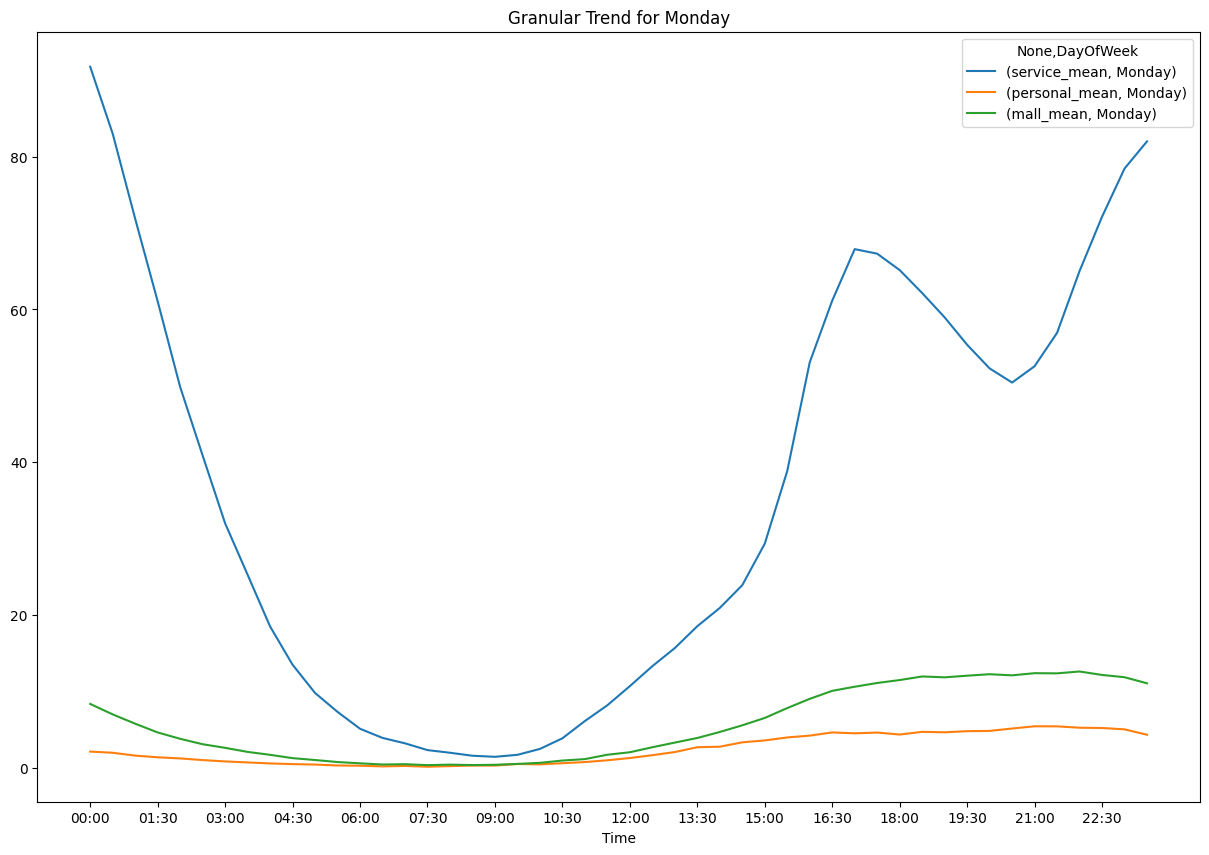

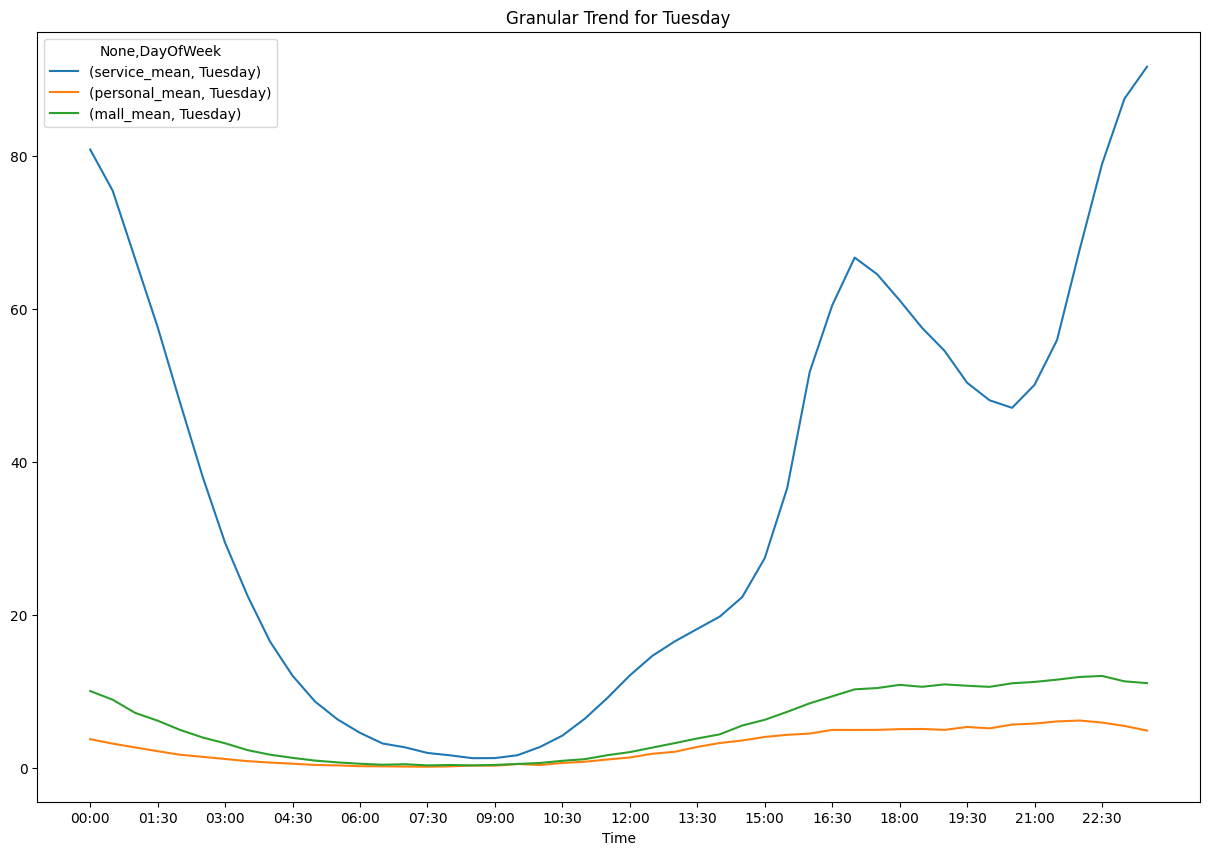

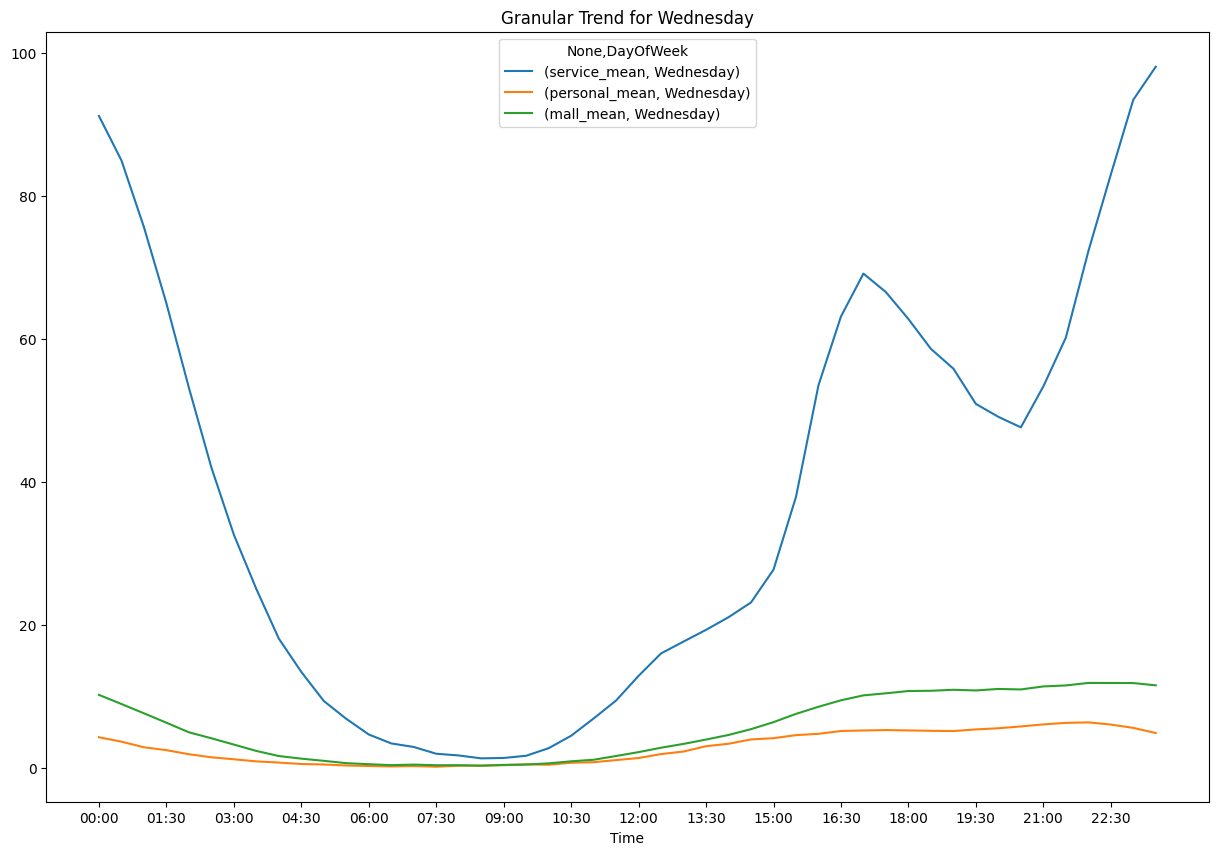

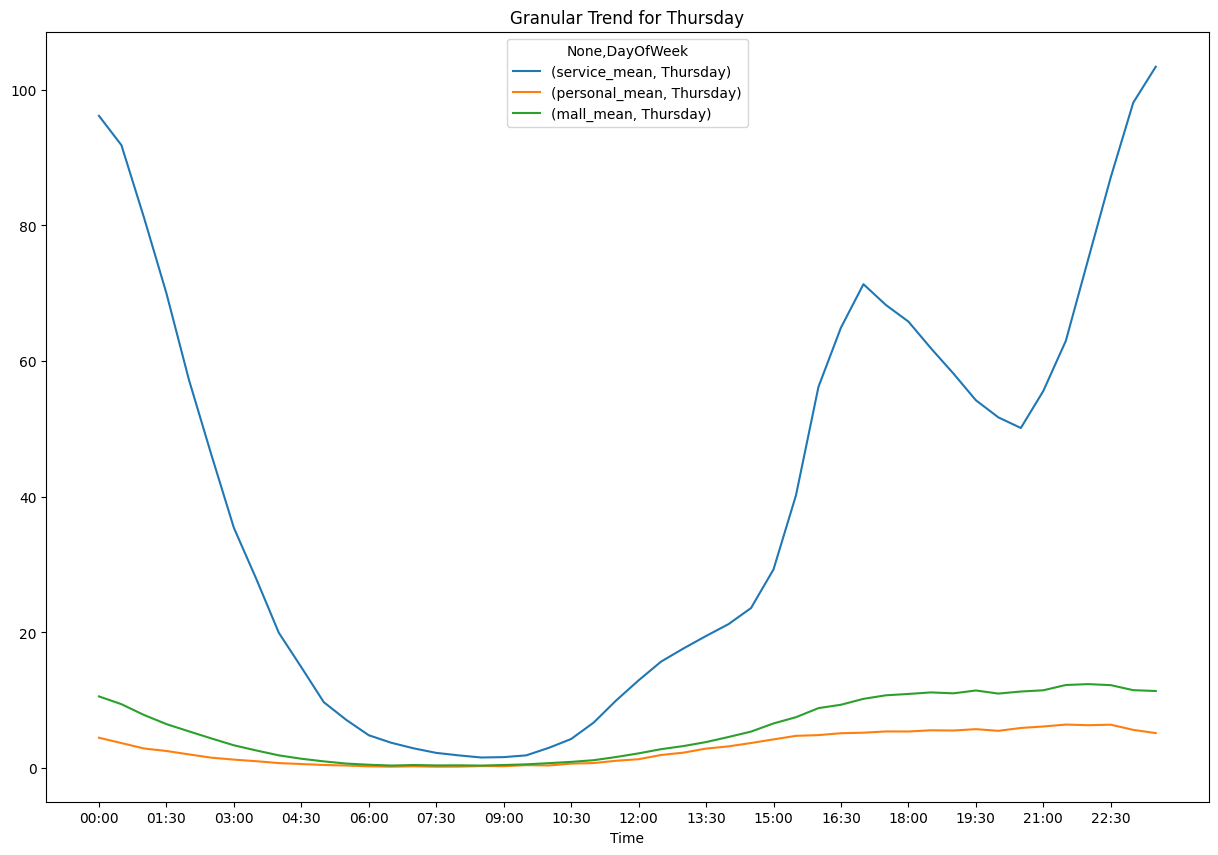

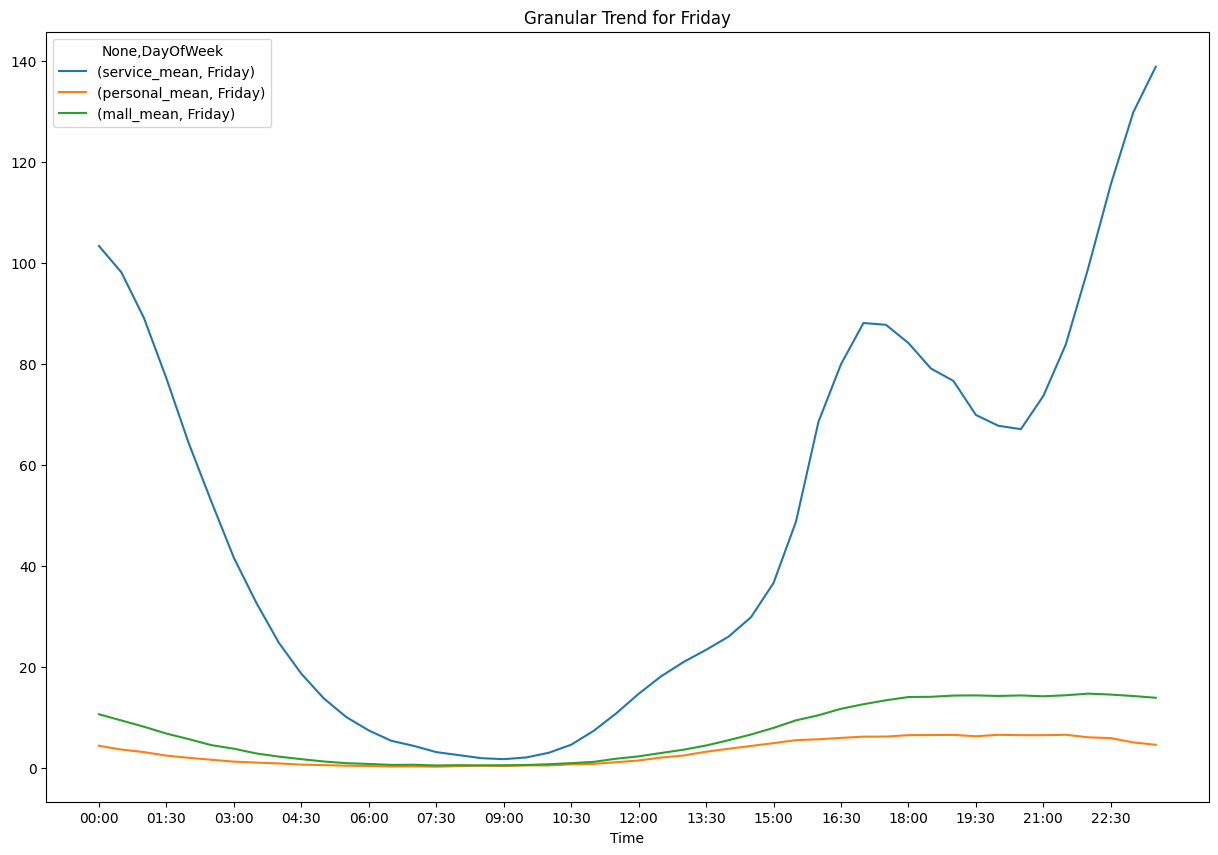

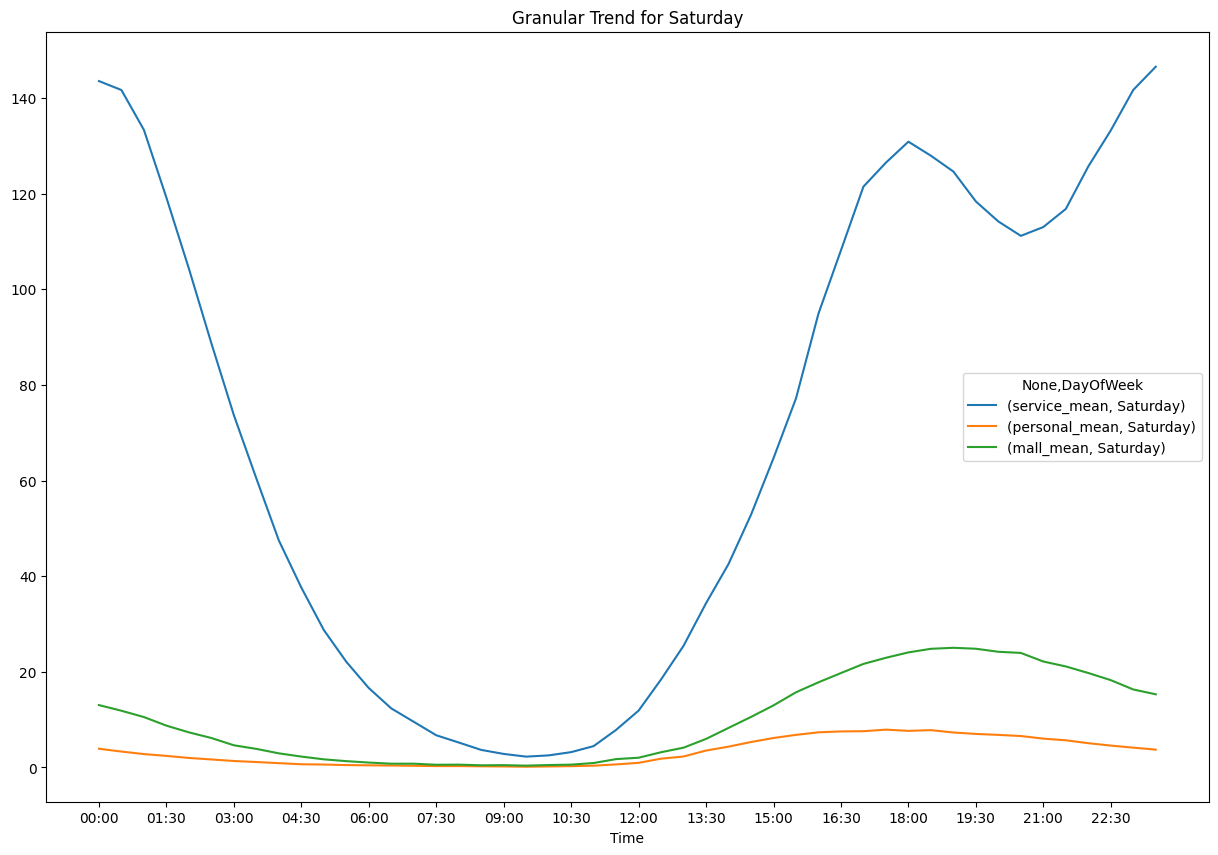

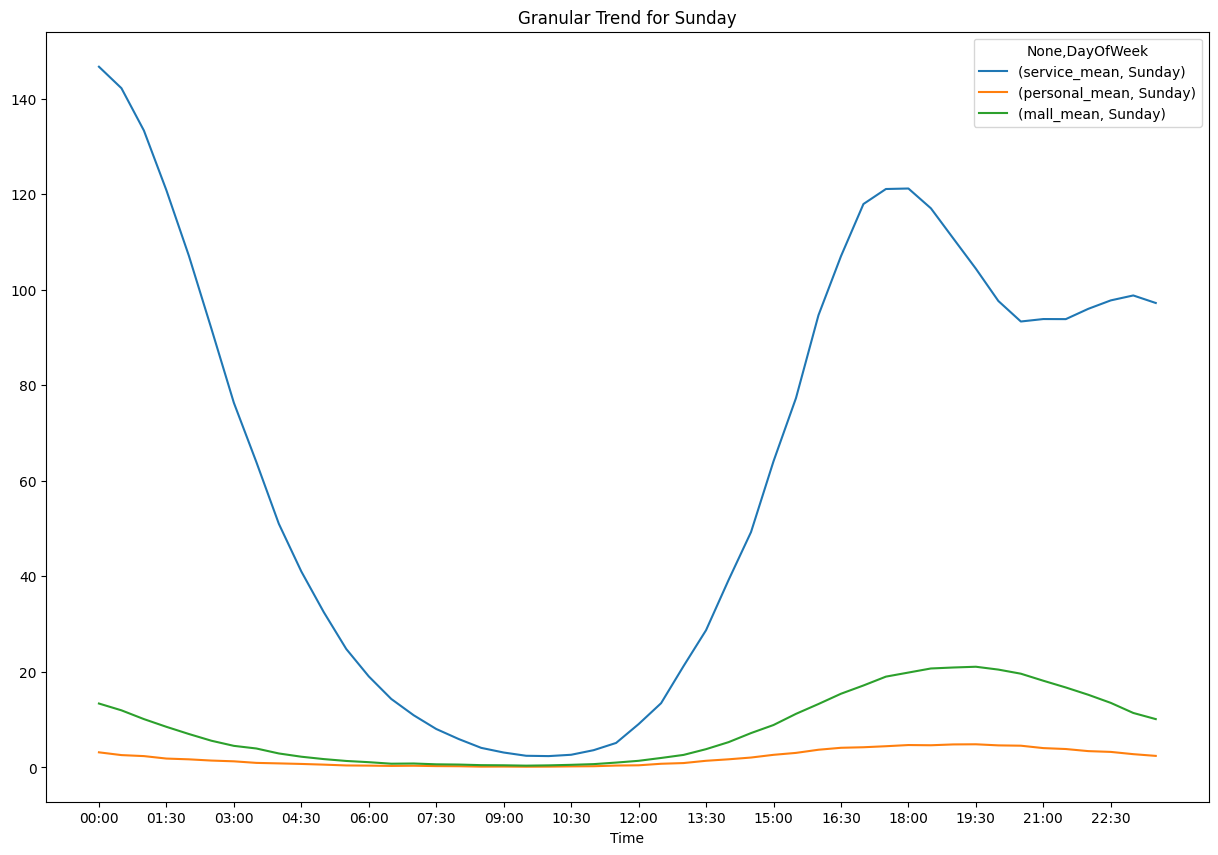

In [69]:
for day in days:
    df_cat_day = df_cat_conf[df_cat_conf['day']==day].filter(regex='lower|mean|upper').unstack(level=0)
    df_cat_day.plot(figsize=(15, 10),
                    title='Granular Trend for {}'.format(day),
                    xticks=df_cat_day.index[0::3])

### It appears that the top 3 categories follow very similar trends between each other and the global trend. The service industry has the lion's share of traffic, and all 3 are mostly active on the weekend.